# 本文件说明
- 特征工程

# 基本设置

In [1]:
import jieba
from jieba import analyse
import sys
import re
import time
import string
from sklearn import feature_extraction
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.externals.joblib import Parallel, delayed
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2,mutual_info_classif,f_classif 
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics

from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from collections import Counter

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("Set2", 8)

import warnings
warnings.filterwarnings('ignore')

In [19]:
from toolkits.nlp.generate_keywords import generate_keywords
from toolkits.nlp import myclass_circ
from toolkits.nlp import myclass_cbrc
from toolkits.setup.specific_func import set_ch_pd
from toolkits.nlp import load_save_plot_file
set_ch_pd()

In [20]:
# 自动重新加载更改的模块
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 一些函数

In [25]:
def plot3(features, class_name_dict):    
    % matplotlib notebook

    f = plt.figure(figsize=(15, 9))
    ax = f.add_subplot(111, projection='3d')  # 创建一个三维的绘图工程
    
    a = 0
    for i in range(1,len(class_name_dict) + 1):
        if len(class_name_dict) == 2:
               a = 2        
        ax.scatter(features[features['label']==i-a]['f1'],
                   features[features['label']==i-a]['f2'],
                   features[features['label']==i-a]['f3'],
                   color=colors[i-1], label=i-a, alpha=.8)

    ax.set_zlabel('f3')  # 坐标轴
    ax.set_ylabel('f2')
    ax.set_xlabel('f1')
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    print(class_name_dict)

    plt.show()

# 数据与特征

## 读取数据

### 八分类

In [4]:
file_path = 'circ_result_class/corpus/'
# file_path = 'cbrc_result_class/corpus/'

title_content, label, title, content = load_save_plot_file.title_content_label(file_path)

label_dic={'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,'消费服务':6,'其他相关报道':7,'噪音':8}
class_name_dict = {v: k for k, v in label_dic.items()}
label = [label_dic[l] for l in label]

title num:  23559
['天安 销售 虚列费用 员工 发 福利 相', '泰康人寿 疑设 招聘 骗局 元 底薪 扣到 剩元']
content num:  23559
title_content num:  23559
label num:  23559
['公司内部管理', '公司内部管理', '公司内部管理', '公司内部管理', '公司内部管理']


### 倾向性

In [4]:
# file_path = 'circ_result_tendency/corpus/'
file_path = 'cbrc_result_tendency/corpus/'

title_content, label, title, content = load_save_plot_file.title_content_label(file_path)
title_or_content = np.array([[t,c] for t,c in zip(title, content)])
# title_or_content = [[t,c] for t,c in zip(title, content)]
label = [int(l) for l in label]
label_dic={'非负':0,'负面':-1}
class_name_dict = {v: k for k, v in label_dic.items()}
class_name_dict

title num:  3982
['推荐 评级 银行业 动态 报告 同业存单 监管 银行 利空', '年 中国 投资 行业 管理 万亿美元 资产']
content num:  3982
title_content num:  3982
label num:  3982
['0', '0', '0', '0', '0']


{-1: '负面', 0: '非负'}

### split train test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(title_content, label, test_size=0.3, random_state=42)
print('训练集：',len(y_train))
print('训练集-各类数量：',Counter(y_train))
print('测试集：',len(y_test))
print('测试集-各类数量：',Counter(y_test))

训练集： 2787
训练集-各类数量： Counter({-1: 1447, 0: 1340})
测试集： 1195
测试集-各类数量： Counter({-1: 601, 0: 594})


In [6]:
X_train_1, X_test_1, y_train, y_test = train_test_split(title_or_content, label, test_size=0.3, random_state=42)
print('训练集：',len(y_train))
print('训练集-各类数量：',Counter(y_train))
print('测试集：',len(y_test))
print('测试集-各类数量：',Counter(y_test))

训练集： 2787
训练集-各类数量： Counter({-1: 1447, 0: 1340})
测试集： 1195
测试集-各类数量： Counter({-1: 601, 0: 594})


## 计算特征：Bag of words

### CIRC

#### 八分类

In [ ]:
org = 'circ'
model = 'class'
date = '20181114'

In [ ]:
## 保存特征
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('len_stats', myclass_circ.StatsFeatures_cor()),
        ('tf', myclass_circ.Statskeywords_cor(topk = 5000))
    ])),
    ('standard', StandardScaler(with_mean=False))
])

pipeline_train = pipeline.fit(title_content, label)
X_features = pipeline_train.transform(title_content)
print(X_features.shape)

from sklearn.externals import joblib
joblib.dump(pipeline_train, "model/%s_%s_pipeline_%s.pkl.z"%(org, model, date))
joblib.dump(X_features, "model/%s_%s_features_%s.pkl.z"%(org, model, date))
joblib.dump(label, "model/%s_%s_labels_%s.pkl.z"%(org, model, date))

In [ ]:
from sklearn.externals import joblib
pipeline_train = joblib.load( "model/circ_class_pipeline_20181108.pkl.z")
X_features = joblib.load( "model/circ_class_features_20181108.pkl.z")
label = joblib.load( "model/circ_class_labels_20181108.pkl.z")
print(X_features.shape)
print(len(label))

#### 倾向性

In [ ]:
org = 'circ'
model = 'tendency'
date = '20181114'

In [8]:
## 保存特征
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('len_stats', myclass_circ.StatsFeatures_tendency()),
    ])),
    ('standard', StandardScaler(with_mean=False))
])

pipeline_train = pipeline.fit(title_content, label)
X_features = pipeline_train.transform(title_content)
print(X_features.shape)

from sklearn.externals import joblib
joblib.dump(pipeline_train, "model/%s_%s_pipeline_%s.pkl.z"%(org, model, date))
joblib.dump(X_features, "model/%s_%s_features_%s.pkl.z"%(org, model, date))
joblib.dump(label, "model/%s_%s_labels_%s.pkl.z"%(org, model, date))

d:\xh\python_project\tool\toolkits\nlp
(3473, 2005)


['model/circ_tendency_labels_20181108.pkl.z']

In [ ]:
from sklearn.externals import joblib
pipeline_train = joblib.load( "model/%s_%s_pipeline_%s.pkl.z"%(org, model, date))
X_features = joblib.load( "model/%s_%s_features_%s.pkl.z"%(org, model, date))
label = joblib.load( "model/%s_%s_labels_%s.pkl.z"%(org, model, date))
print(X_features.shape)
print(len(label))

### CBRC

#### 八分类

In [ ]:
org = 'cbrc'
model = 'class'
date = '20181114'

In [ ]:
## 保存特征
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('len_stats', myclass_cbrc.StatsFeatures_cor()),
        ('tf', myclass_cbrc.Statskeywords_cor(topk = 5000))
    ])),
    ('standard', StandardScaler(with_mean=False))
])

pipeline_train = pipeline.fit(title_content, label)
X_features = pipeline_train.transform(title_content)
print(X_features.shape)

from sklearn.externals import joblib
joblib.dump(pipeline_train, "model/%s_%s_pipeline_%s.pkl.z"%(org, model, date))
joblib.dump(X_features, "model/%s_%s_features_%s.pkl.z"%(org, model, date))
joblib.dump(label, "model/%s_%s_labels_%s.pkl.z"%(org, model, date))

In [ ]:
from sklearn.externals import joblib
pipeline_train = joblib.load( "model/%s_%s_pipeline_%s.pkl.z"%(org, model, date))
X_features = joblib.load( "model/%s_%s_features_%s.pkl.z"%(org, model, date))
label = joblib.load( "model/%s_%s_labels_%s.pkl.z"%(org, model, date))
print(X_features.shape)
print(len(label))

#### 倾向性

In [8]:
org = 'cbrc'
model = 'tendency'
date = '20181114'

In [9]:
## 保存特征
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('len_stats', myclass_cbrc.StatsFeatures_tendency()),
    ])),
    ('standard', StandardScaler(with_mean=False))
])

pipeline_train = pipeline.fit(title_content, label)
X_features = pipeline_train.transform(title_content)
print(X_features.shape)

from sklearn.externals import joblib
joblib.dump(pipeline_train, "model/%s_%s_pipeline_%s.pkl.z"%(org, model, date))
joblib.dump(X_features, "model/%s_%s_features_%s.pkl.z"%(org, model, date))
joblib.dump(label, "model/%s_%s_labels_%s.pkl.z"%(org, model, date))

d:\xh\python_project\tool\toolkits\nlp
(3982, 2005)


['model/cbrc_tendency_labels_20181114.pkl.z']

In [10]:
from sklearn.externals import joblib
pipeline_train = joblib.load( "model/%s_%s_pipeline_%s.pkl.z"%(org, model, date))
X_features = joblib.load( "model/%s_%s_features_%s.pkl.z"%(org, model, date))
label = joblib.load( "model/%s_%s_labels_%s.pkl.z"%(org, model, date))
print(X_features.shape)
print(len(label))

(3982, 2005)
3982


# 计算特征：wordvec

In [32]:
from gensim.models import word2vec

sentences = word2vec.Text8Corpus(title_content)  # 加载语料
n_dim=200
model = word2vec.Word2Vec(sentences, size=n_dim)  # 训练skip-gram模型; 默认window=5

TypeError: don't know how to handle uri ['决定书 国寿财险 瑞金 支公司 违法行为 保监会 网站 今日 公布 江西保监局 中国人寿财产保险 股份 有限公司 瑞金 支公司 简称 国寿财险 瑞金 支公司 行政处罚 决定书 显示 国寿财险 瑞金 支公司 虚构 中介 业务 套取费用 三宗 违法行为 江西保监局 依法 公司 罚款 共计 万元 决定书 国寿财险 瑞金 支公司 违法行为 年 年 利用 保险代理 虚构 中介 业务 方式 套取费用 时 国寿财险 瑞金 支公司 副经理 钟金艳 违法行为 负有 年 年 未如实 记录 业务 事项 时 国寿财险 瑞金 支公司 副经理 钟金艳 违法行为 负有 年 月 年 月 给予 投保人 合同 约定 利益 时 国寿财险 瑞金 支公司 副经理 钟金艳 违法行为 负有 江西保监局 作出 处罚 利用 保险代理 虚构 中介 业务 方式 套取费用 违反 法 一百一十 六条 法 第一百六十一条 江西保监局 国寿财险 瑞金 支公司 罚款 万元 法 一百七十 一条 江西保监局 对钟 金艳 给予警告 罚款 万元 未如实 记录 业务 事项 违反 法 第八 十六条 法 第一百七十条 江西保监局 国寿财险 瑞金 支公司 罚款 万元 法 一百七十 一条 江西保监局 对钟 金艳 给予警告 罚款 万元 给予 投保人 合同 约定 利益 违反 法 一百一十 六条 法 第一百六十一条 江西保监局 国寿财险 瑞金 支公司 罚款 万元 法 一百七十 一条 江西保监局 对钟 金艳 给予警告 罚款 万元', '转型 阵痛 净利下滑 寿险 公司 偿付能力报告 陆续 披露 险企 年 净利润 数据 随之 出炉 证券日报 记者 统计 显示 昨日 共有 家 险企 披露 去年 四季度 偿付能力报告 有家 险企 净利润 正家 净利润 为负 家 净亏损 超过 亿元 披露 情况 净利润 高 寿险 公司 包括 泰康人寿 华夏人寿 友邦保险 阳光人寿 前海人寿 恒大人寿 中信保诚人寿 险企 亏损 寿险 公司 包括 长城人寿 吉祥人寿 中韩人寿 险企 从全 行业 保监会 披露 数据 显示 行业 去年 原 保费收入 万亿元 同比 增长 公司 预计 利润 亿元 同比 增长 转型 阵痛 净利下滑 亏损 险企 特征 险企 保费 亏损 险企 此前 万能 型 传统 保障型产品 占 低 强 监管政策 背景 下以 万能险 产品 险企 面临 转型 压力 亏损 险企 前期 依赖 银保渠道 销售 万能险 保费规模 快速增长 业务 模式 面临 调整 压力 银保渠道 控制力 弱化 前 三季度 保费收入 下滑 险企 此前 销售 中 短 存续期 产品 去年 高 退保 期 退保 满期 给付 增加 投资收益 进一步 下滑 投资 端 弥补 承保 端 成本 压力 加大 经营 亏损 本报记者 一份 中债 资信 近期 寿险 公司 债券 评级 报告 显示 险企 去年 前 三季度 净利润 亿元 投资 端 公司 高 变现 资产 资本 市场 投资 难度 增加 公司 投资 收益率 环比 下降 未来 退保 满期 给付 增加 公司 持续 预留 现金 等价物 削减 投资规模 投资收益 进一步 下滑 投资 端 弥补 承保 端 成本 压力 加大 投资收益 保费收入 下滑 营业 支出 增加 背景 投资 交易 性 金融资产 调至 可供 出售 金融资产 账面 浮盈 计入 当期 利润 公司 净利润 逐年 下降 未来 公司 承保 端 收入 不断下滑 退保 增加 公司 盈利 压力 增加 海外投资 中债 资信 提到 公司 保外 贷 境外 自有 资金 收购 公司 酒店 年 月末 海外 子公司 总资产 合计 亿元 子公司 借款 亿元 年月日 酒店 娱乐业 境外 非理性 投资 受到限制 未来 公司 海外投资 难度 有所增加 投资收益 减少 险企 现金流为负 遭遇 转型 阵痛 之外 亏损 险企 现金流 为负 中韩人寿 流动性风险 监管 指标 去年 第四季度 净现金 流为 万元 原因 资金 合理配置 投资 资产 所致 综合 流动比率 流动性 覆盖率 计算结果 未来 月 年 综合 流动比率 出现异常 指标 显示 情况 中韩人寿 提到 公司 公司 着重 聘请 外部 专业 咨询机构 方式 资产负债 合理配置 未来 年度 减小 此类 风险 另一家 中型 寿险 公司 提到 公司 现金流 充足 前提 年度 始终 业务 结构 转型 主动 控制 趸 缴 业务 规模 做大 价值 类 业务 保费 资产负债 匹配 管理 存量 资产 盘活 释放 投资 业务 现金 流入 支付 业务 现金 流出 公司 业务 净现金 流 降低 中型 险企 年 四季度 月 综合 流动比率 季度 下降 百分点 季度 交易 类 现金流减少 亿元 月 资产 预期 现金 流入 总计 减少 亿元 险企 年 四季度 压力 情景 流动性 覆盖率 季度 相比 下降 预计 年 一季度 满期 赔付 退保 现金 流出 现金 流出 增加 流动性 覆盖率 下降 险企 偿付能力报告 中 提到 业务 净现金 流 短期 综合 流动比率 流动性 覆盖率 季度 下降 流动性 充足 公司 主动 控制 趸 缴 业务 规模 实施 结构 转型 流动性 前提 下该 公司 流动性资产 资产 配置 增加 收益 大型 险企 利润 占 大头 上市 险企 暂未 披露 年 净利润 情况 券商 研究员 业内人士 预计 未来 寿险 公司 利润 上市 险企 大型 险企 倾斜 去年 上半年 寿险 公司 利润 分布 证券日报 记者 统计 家 公司 净利润 亿元 家 盈利 合计 盈利 亿元 家 亏损 合计 亏损 亿元 值得注意 净利 排名 前 家 公司 合计 净利 亿元 占 盈利 险企 净利 总额 家 险企 合计 净利 占 不到 两成 中保协 去年 发布 回归 本源 寿险 公司 发展 之道 下称 报告 提到 年 年 我国 寿险 业 原 保费 增长 万亿元 七家 公司 占 比约 年 年 公司 行业 利润 占 仅为 公司 分享 代理人 增员 绝大部分 红利 招募 接近 新增 人力 长城 证券 近期 发布 研报 指出 寿险 年 股家 上市 险企 保费收入 市场占有率 分化 强者 恒强 利润 端的 表现 远好 近几年 个险 期交 价值 方向 转型 大型 寿险 公司 代理人 渠道 保费 占 高水平 代理人 渠道 保费 占 大型 险企 期交 保费 占 提升 渠道 产品 结构 优化 带来 高 价值 保费 良性 增长 寿险 业务 新 业务 价值 率 提升 依托 广发 证券 研报', '监督 中华联合产险 江西 现 两宗 违法 投保人 约定 利益 保监会 网站 公布 江西保监局 中华联合财产保险股份有限公司 江西 分公司 行政处罚 决定书 显示 中华联合产险 江西 分公司 给予 投保人 保险合同 约定 利益 虚构保险中介业务 套取费用 展开 全文 监督 中华联合产险 江西 现 两宗 违法 投保人 约定 利益 保监会 网站 公布 江西保监局 中华联合财产保险股份有限公司 江西 分公司 行政处罚 决定书 显示 中华联合产险 江西 分公司 给予 投保人 保险合同 约定 利益 虚构保险中介业务 套取费用 展开 全文', '季度 偿付能力报告 珠江人寿 风险 综合 评级 降级 月 日 百余家 保险公司 悉数 披露 年 季度 偿付能力报告 珠江人寿 最新 一期 风险 综合 评级 被评 定为 类 引人 保险公司 偿付能力 管理 意味着 珠江人寿 偿付能力 不达标 一度 打法 激进 前海人寿 展开 全文 季度 偿付能力报告 珠江人寿 风险 综合 评级 降级 月 日 百余家 保险公司 悉数 披露 年 季度 偿付能力报告 珠江人寿 最新 一期 风险 综合 评级 被评 定为 类 引人 保险公司 偿付能力 管理 意味着 珠江人寿 偿付能力 不达标 一度 打法 激进 前海人寿 展开 全文', '偿付能力再降 中 法 人寿 深陷困局 业内 常年 垫底 中法人寿 持续 亏损 资本金 消耗殆尽 陷入 流动性枯竭 困境 月 日 中法人寿 官网 披露 年 四季度 偿付能力报告 显示 去年 四季度 公司 偿付能力 去年 三季度 下降 偿付能力 持续 恶化 情况 中法人寿 增资 止步不前 展开 全文 偿付能力再降 中 法 人寿 深陷困局 业内 常年 垫底 中法人寿 持续 亏损 资本金 消耗殆尽 陷入 流动性枯竭 困境 月 日 中法人寿 官网 披露 年 四季度 偿付能力报告 显示 去年 四季度 公司 偿付能力 去年 三季度 下降 偿付能力 持续 恶化 情况 中法人寿 增资 止步不前 展开 全文', '首月近 十位 高 管领 罚 警示 职业生涯 钱 签字 前要 慎重 这是 近期 保险公司 高管 见面 时 打趣 一句 话 事实上 这是 金融监管 风暴 真实写照 世纪 经济 报道 记者 保监会 官网 统计 开年 首月 共有 家 保险公司 处罚 包括 浙商财险 董事长 总经理 安心财险 展开 全文 首月近 十位 高 管领 罚 警示 职业生涯 钱 签字 前要 慎重 这是 近期 保险公司 高管 见面 时 打趣 一句 话 事实上 这是 金融监管 风暴 真实写照 世纪 经济 报道 记者 保监会 官网 统计 开年 首月 共有 家 保险公司 处罚 包括 浙商财险 董事长 总经理 安心财险 展开 全文', '央行 严查 违反 反洗钱法 新华人寿 太平洋产险 被罚 近日 中国人民银行 西安 分行 营业 管理部 公布 处罚 信息 中国太平洋财产保险股份有限公司 西安市 阎良 支公司 违反 反洗钱法 相 公示 表 显示 新华人寿保险股份有限公司 周至 支公司 违反 反 展开 全文 央行 严查 违反 反洗钱法 新华人寿 太平洋产险 被罚 近日 中国人民银行 西安 分行 营业 管理部 公布 处罚 信息 中国太平洋财产保险股份有限公司 西安市 阎良 支公司 违反 反洗钱法 相 公示 表 显示 新华人寿保险股份有限公司 周至 支公司 违反 反 展开 全文', '主营业务 遭遇 强 监管 瑞泰人寿 年 几无 盈利 再受 重创 全 行业 转型 众生相 中 投连险 特色 瑞泰人寿 表现 尤为 引 瑞泰人寿 年 四季度 偿付能力报告 显示 年 累计 亏损 万元 值得注意 这家 合资 寿险 公司 除年 小额 盈利 万元 外 年份 皆 亏损 展开 全文 主营业务 遭遇 强 监管 瑞泰人寿 年 几无 盈利 再受 重创 全 行业 转型 众生相 中 投连险 特色 瑞泰人寿 表现 尤为 引 瑞泰人寿 年 四季度 偿付能力报告 显示 年 累计 亏损 万元 值得注意 这家 合资 寿险 公司 除年 小额 盈利 万元 外 年份 皆 亏损 展开 全文', '保险公司 一天到晚 坑 员工 钱 麻烦 产品 卖 客户 总 盯 员工 吸血 保险公司 一天到晚 坑 员工 钱 麻烦 产品 卖 客户 总 盯 员工 吸血', '理赔 资料 交 一个月 消息 中国人寿 天津 中国人寿保险 大同 理赔 资料 交 一个月 消息 中国人寿 天津 中国人寿保险 大同', '大半夜 发 广告 我服 中国平安 大半夜 发 广告 我服 中国平安', '大半夜 收到 一条 投保 一个月 人身 意外险 短信 客服 投 太 可怕 阿弥陀佛 大半夜 收到 一条 投保 一个月 人身 意外险 短信 客服 投 太 可怕 阿弥陀佛', '看清楚 苗 玲玲 华泰保险 公司 特别 失望 车祸 受伤 精力 体力 打官司 条件 机会 请 政府 受害者 保护 失望 东阳 横店 看清楚 苗 玲玲 华泰保险 公司 特别 失望 车祸 受伤 精力 体力 打官司 条件 机会 请 政府 受害者 保护 失望 东阳 横店', '认准 他妈的 讲师 保险公司 毕业 怀疑 平安 专业性 开个 培训 签到 表都 弄 掉 脑壳 粑 粑 他妈 屁 规则 认准 他妈的 讲师 保险公司 毕业 怀疑 平安 专业性 开个 培训 签到 表都 弄 掉 脑壳 粑 粑 他妈 屁 规则', '太平洋保险 仗 内行 找 理由 压低 保费 先前 说 仿品 实物 说 分 新旧 缸 网上 买 太平洋保险 烂死 老百姓 手里 坑了 太平洋保险 仗 内行 找 理由 压低 保费 先前 说 仿品 实物 说 分 新旧 缸 网上 买 太平洋保险 烂死 老百姓 手里 坑了', '抵制 平安保险 真的 阻止 身边 选择 垃圾 保险公司 下次 跳槽 我会 先问 团险 保险公司 抵制 平安保险 真的 阻止 身边 选择 垃圾 保险公司 下次 跳槽 我会 先问 团险 保险公司', '央行 严管 反洗钱 中国人寿 恒大人寿 遭重罚 界面 界面 中国人寿 重庆 分公司 恒大人寿 违反 反洗钱 遭处罚 网页 链接 央行 严管 反洗钱 中国人寿 恒大人寿 遭重罚 界面 界面 中国人寿 重庆 分公司 恒大人寿 违反 反洗钱 遭处罚 网页 链接', '一月份 车子 行驶 胶州 路口 违规 行驶 大车 刮碎 门子 交警 判 全 拒绝赔付 致电 青岛 保监会 不予 致电 无果 青岛 人权 青岛 西海岸 新闻网 青岛市 中级 人民法院 青岛 交警 青岛 维权 青岛 城事 一月份 车子 行驶 胶州 路口 违规 行驶 大车 刮碎 门子 交警 判 全 拒绝赔付 致电 青岛 保监会 不予 致电 无果 青岛 人权 青岛 西海岸 新闻网 青岛市 中级 人民法院 青岛 交警 青岛 维权 青岛 城事', '中国平安 车险 客服 霸道 强买强卖 不说 不接电话 还换 号 允悲 允悲 说换 别家 追问 不买 平安 为所欲为 牛 逼 吃瓜 吃瓜 平安车险 平安车险 中国平安 车险 客服 霸道 强买强卖 不说 不接电话 还换 号 允悲 允悲 说换 别家 追问 不买 平安 为所欲为 牛 逼 吃瓜 吃瓜 平安车险 平安车险', '中国人寿 血汗钱 买 一份 中国人寿 国寿 新鸿泰金典 版 两全保险 承诺 保底 收益 预计 收益 累计 到期 现金 价值 加 分红 找到 门头沟 国寿 负 受害 团结起来 讨回 展开 全文 中国人寿 血汗钱 买 一份 中国人寿 国寿 新鸿泰金典 版 两全保险 承诺 保底 收益 预计 收益 累计 到期 现金 价值 加 分红 找到 门头沟 国寿 负 受害 团结起来 讨回 展开 全文', '爆料 潍坊 天安人寿 潍坊 违法 显示 年 月 月 天安人寿保险股份有限公司 潍坊 中心 支公司 时 时 爆料 潍坊 天安人寿 潍坊 违法 山东保监局 今日 公布 行政处罚 决定书 显示 年 月 月 天安人寿保险 股份 有限公司 潍坊 中心 支公司 简称 天安人寿 潍坊 中 支 时 天安人寿 潍坊 中支 负 时 天安人寿 潍坊', '北京 爆料 中国人寿 血汗钱 买 一份 中国人寿 国寿 新鸿泰金典 版 两全保险 承诺 保底 收益 预计 收益 累计 到期 现金 价值 加 分红 找到 门头沟 国寿 负 怒骂 怒骂 怒骂 受害 团结起来 北京 爆料 中国人寿 血汗钱 买 一份 中国人寿 国寿 新鸿泰金典 版 两全保险 承诺 保底 收益 预计 收益 累计 到期 现金 价值 加 分红 找到 门头沟 国寿 负 怒骂 怒骂 怒骂 受害 团结起来', '北京 身边 事 中国人寿保险 违法 欺骗 投保人 保监局 罚款 万元 北京保监局 核查 中国人寿保险股份有限公司 北京市 分公司 经营 过程 中 欺骗 投保人 违法行为 北京保监局 国寿北分 欺骗 投保人 违反 相 分享 北京 北京 身边 事 中国人寿 违法 欺骗 投保人 保监局 罚款 万元 北京保监局 核查 中国人寿保险股份 有限公司 北京市 分公司 经营 过程 中 欺骗 投保人 违法行为 北京保监局 国寿北分 欺骗 投保人 违反 相 分享 北京', '捕头 提示 五家 玩猫腻 耍花招 保险公司 中招 紫金财险 华安财险 中美联泰大都会人寿 招商信诺人寿 光大永明人寿 家 险企 销售 保险产品 时 保单 销售 不规范 话术 不规范 业务 宣传 不完全相符 保监会 近日 戳 图 有没有 中招 捕头 提示 五家 玩猫腻 耍花招 保险公司 中招 紫金财险 华安财险 中美联泰大都会人寿 招商信诺人寿 光大永明人寿 家 险企 销售 保险产品 时 保单 销售 不规范 话术 不规范 业务 宣传 不完全相符 保监会 近日 戳 图 有没有 中招', '临沂 城 事儿 都邦财险 临沂 中 支 被曝 投保人 投保单 签名 购买 保险合同 投保 签字 代表 投保 保险合同 条款 知情 同意 都邦财险 临沂 中 支 近日 被曝出 保险销售人员 未经 客户 同意 擅自 投保 投保单 签字 记者 从据 山东保监局 行政处罚 决定书 获悉 财务 展开 全文 临沂 城 事儿 都邦财险 临沂 中 支 被曝 投保人 投保单 签名 购买 保险合同 投保 签字 代表 投保 保险合同 条款 知情 同意 都邦财险 临沂 中 支 近日 被曝出 保险销售人员 未经 客户 同意 擅自 投保 投保单 签字 记者 从据 山东保监局 行政处罚 决定书 获悉 财务 展开 全文', '平安保险 生活 辣鸡 平安 旅行 认准 安联 紧 平安 再见 平安保险 生活 辣鸡 平安 旅行 认准 安联 紧 平安 再见', '平安 守护 紫金财险 华安财险 中美联泰大都会人寿 招商信诺人寿 光大永明人寿 家 险企 销售 保险产品 时 保单 销售 不规范 话术 不规范 业务 宣传 不完全相符 保监会 近日 戳 图 有没有 中招 平安 守护 紫金财险 华安财险 中美联泰大都会人寿 招商信诺人寿 光大永明人寿 家 险企 销售 保险产品 时 保单 销售 不规范 话术 不规范 业务 宣传 不完全相符 保监会 近日 戳 图 有没有 中招', '平安 守护 经侦大队 金赛 银 董事长 王 维奇 连环 诈骗犯 金融 圈 岳不群 月底 位 购买 中国平安 北京 分公司 兜售 理财产品 兑付危机 背后 产品 发行 深圳 金赛 银 基金 倒闭 回过头来 看金赛 银用 花招 哄骗 投资者 信 一是 装门面 深圳 租 高档 豪华 投资人 高大 形象 二是 傍 官员 打着 政府 项目 名义 推销 三是 平安保险 担保 幌子 投资者 爆料 称有 四是 吹 挂牌 懂 事后 平安保险 事件 回应 称 平安人寿 业务员 私下 违规 推介 金赛 银 产品 规模 约 亿元 平安 守护 经侦大队 金赛 银 董事长 王 维奇 连环 诈骗犯 金融 圈 岳不群 月底 位 购买 中国平安 北京 分公司 兜售 理财产品 兑付危机 背后 产品 发行 深圳 金赛 银 基金 倒闭 回过头来 看金赛 银用 花招 哄骗 投资者 信 一是 装门面 深圳 租 高档 豪华 投资人 高大 形象 二是 傍 官员 打着 政府 项目 名义 推销 三是 平安保险 担保 幌子 投资者 爆料 称有 四是 吹 挂牌 懂 事后 平安保险 事件 回应 称 平安人寿 业务员 私下 违规 推介 金赛 银 产品 规模 约 亿元', '山东 要闻 山东 要闻', '松原 身边 事 中航安盟财产保险 松原 支公司 未经批准 变 号 行政处罚 决定书 中航安盟财产保险有限公司 松原 支公司 相 松原 身边 事 中航安盟财产保险 松原 支公司 未经批准 变 号 行政处罚 决定书 中航安盟财产保险有限公司 松原 支公司 相 文件 显示 年 月 中航安盟财产保险 松原 支公司 未经 监督管理 机构 批准 变 苗勇 时 违反 中华人民共和国 保险法 第八 十四条 该法 一百六十 二条 一百七十 一条 吉林保监局 支公司 作出 罚款 万元 对苗勇 作出 警告 罚款 万元 行政处罚 据千网 月 日 报道 中航安盟财产保险 吉林省 分公司 未经批准 变', '威海 威海 身边 事 保险公司 业务员 诱导 骗保 威海 中国人寿保险 公司 业务员 姚发菊卖 说 半年 生效 威海 威海 身边 事 保险公司 业务员 诱导 骗保 威海 中国人寿保险 公司 业务员 姚发菊卖 说 半年 生效 半年 生病 报 说 一年 生效 业务员 经理 说 签字 合同 懂 业务员 干什么 找 负 做贼心虚 说 别家 买 骗保', '潍坊 身边 事 天安人寿 潍坊 违法 显示 年 月 月 天安人寿保险股份有限公司 潍坊 中心 支公司 时 时 潍坊 身边 事 天安人寿 潍坊 违法 山东保监局 今日 公布 行政处罚 决定书 显示 年 月 月 天安人寿保险 股份 有限公司 潍坊 中心 支公司 简称 天安人寿 潍坊 中 支 时 天安人寿 潍坊 中支 负 时 天安人寿 潍坊', '枣庄 新闻 人保财险 旗下 枣庄市 山亭 支公司 造假 保监局 行政处罚 近日 中国人民财产保险股份有限公司 下称 人保财险 旗下 枣庄市 山亭 支公司 所在地 保监 机构 月 日 山东保监局 公布 行政处罚 决定书 显示 年 月 年 月 人保财险 枣庄市 山亭 支公司 枣庄 新闻 人保财险 旗下 枣庄市 山亭 支公司 造假 保监局 行政处罚 近日 中国人民财产保险股份有限公司 下称 人保财险 旗下 枣庄市 山亭 支公司 所在地 保监 机构 月 日 山东保监局 公布 行政处罚 决定书 显示 年 月 年 月 人保财险 枣庄市 山亭 支公司', '中国人保 碎屏险 骗局 求 转发 去年 月 支付宝 买 中国平安 承保 新机 碎屏险 中国人保 碎屏险 骗局 求 转发 去年 月 支付宝 买 中国平安 承保 新机 碎屏险 如图 显示 意外 碎屏 元 上个月 号 街上 玩 跑得快 手机 小心 掉 屏幕 碎 第一 快递 包装 完好 卡槽 手机 黄色 包装袋 内在 缓冲 气垫 快递 小哥 提醒 差点 发现 扔 试 发现 卡槽 插 情况 下卡读 第三 屏幕 震惊 左上角 一块 凸起 屏幕 外壳 吻合 情况 浙江人 保 极客 修 店里 电话 给出 解决方案 送 返回 修 提出 同意 售后 修 说 领导 生气 华为 售后 售后 小姐姐 听 说 售后 屏幕 原装 配件 弄 麻烦 维修 小哥 真的 急用 可怜 帮 搞 装卡 外观 没收 钱 问 售后 原装 屏幕 价钱 人保一 赔付 肯定 售后 修 不像 支付宝 人保 两家 公司 推荐 坑爹 合作 商 手机 屏幕 原装 说 修好 服务 体验 差劲 修 不好 找 售后 售后 做 事 擦屁股 合同 赔付 提出 元 解决方案 事 不合理 保监会 热线 投诉 诉求 一是 中国人保财险 退 块 保费 应有 服务 买 希望 相 合作 商 肯定 不合理 希望 有别 骗 站 保监会 投诉 力量 投诉', '天堂 人间 妈妈 爱女 手段 残忍 火化 骨灰 没留 集体 串供词 作假证 谋杀案 做成 病死 涉及 数干 万 保险金额 贪污 搞 黑钱 没人管 残杀 天堂 人间 妈妈 爱女 手段 残忍 火化 骨灰 没留 集体 串供词 作假证 谋杀案 做成 病死 涉及 数干 万 保险金额 贪污 搞 黑钱 没人管 残杀', '巡视 姐 文明 花 开 爱女 手段 残忍 火化 骨灰 没留 集体 串供词 作假证 谋杀案 做成 病死 涉及 数干 万 保险金额 贪污 搞 黑钱 没人 巡视 姐 文明 花 开 爱女 手段 残忍 火化 骨灰 没留 集体 串供词 作假证 谋杀案 做成 病死 涉及 数干 万 保险金额 贪污 搞 黑钱 没人', '爱女 手段 残忍 火化 骨灰 没留 集体 串供词 作假证 谋杀案 做成 病死 涉及 数干 万 保险金额 贪污 搞 黑钱 没人管 残杀 一条 年轻 无辜 生命 爱女 手段 残忍 火化 骨灰 没留 集体 串供词 作假证 谋杀案 做成 病死 涉及 数干 万 保险金额 贪污 搞 黑钱 没人管 残杀 一条 年轻 无辜 生命', '在线 订票 时 搭售 春节 结束 搭售 事 一般来说 在线 旅游 平台 网上 订购 机票 火车票 时 默认 勾选 搭售 套路 两种 套路 票务 酒店 预定 页面设置 默认 勾 选项 勾选 人身 意外 伤害 退票 险 产品 套路 附加条件 搭售 提供 优先 服务 时 购买 相 产品 附加条件 见招拆招 搭售 套路 消费者 维权 意识 清晰 这类 做法 损害 合法权益 在线 平台 默认 勾选 推荐 产品 未 列明 承保 主体 代理 销售 主体 未 完整 披露 产品 条款 相 自主 选择权 权益 消费者 订票 时要 产品 被强制 销售 某类 时 应 权益 拨打 热线 监管部门 投诉 消费者 在线 选 提前 要素 风险 阅读 购买 保障 内容 在线 平台 销售 主动 弹 条款 页面 点击 页面 条款 链接 消费者 忽略 条款 内容 建议 消费者 阅读 选择 购买 符合 保障 规划 需求 产品 内容 投保 前 查阅 简要 产品 介绍 包括 利益 保障 投保 拿到 电子 保单 纸质 保单 应 查看 一遍 条款 着重 看清 条款 中有 利益 特别 内容 留意 条款 条件 消费者 应 仔细阅读 条款 特别 产品 就医 退保 特别 约定 中 条件 甄选 优质 性价比 产品 网络 投保 一份 产品 公司 官网 保费 测算 产品 找到 符合 需求 性价比 高 产品 产品价格 消费者 各家 公司 热线电话 接通率 服务 水准 衡量 选择 这家 网站 投保 一款 产品 徐杨 保监', '平安车险 平安 公司 流氓 公司 员工素质 极低 挂 出险 电话 骂人 重视 买 平安 产品 平安车险 平安 公司 流氓 公司 员工素质 极低 挂 出险 电话 骂人 重视 买 平安 产品', '中国平安 服务 投诉 投诉 客户经理 中国平安 中国平安 服务 投诉 投诉 客户经理 中国平安', '中国人寿 理赔 员 陈建华 真牛 逼 打电话 回答 外地人 熟 理由 无可辩驳 中国人寿 养 认路 窝囊废 还给 我来 有罪 推定 说 车子 早就 擦 中国人寿 理赔 员 陈建华 真牛 逼 打电话 回答 外地人 熟 理由 无可辩驳 中国人寿 养 认路 窝囊废 还给 我来 有罪 推定 说 车子 早就 擦', '中国 太平洋保险 这年头 销售 服务 牛 逼 说 职位 高 职位 高 瞧不起 客户 一年 月 逢年过节 电话 慰问 最起码 一点 歉意 说 告知 女朋友 投 保 电话 手机 打电话 震惊 发现 中国 太平洋保险 这年头 销售 服务 牛 逼 说 职位 高 职位 高 瞧不起 客户 一年 月 逢年过节 电话 慰问 最起码 一点 歉意 说 告知 女朋友 投 保 电话 手机 打电话 震惊 发现', '股市 违反 反洗钱 中国人寿 建信人寿 遭 监管处罚 月 日 中国人民银行 重庆 营业 管理部 违反 中国人寿 重庆 分公司 恒大人寿 重庆 钱宝 科技 服务 有限公司 招商银行重庆分行 处以罚款 万元 名相 中国人寿 重庆 分公司 处以罚款 万元 名相 恒大人寿 处以罚款 万元 名相 重庆 钱宝 科技 服务 有限公司 处以罚款 万元 名相 万元 罚款 值得 人保财险 长治市 分公司 反洗钱 处以 万元 罚款 对名 相 具体表现 未按照 中华人民共和国 反洗钱法 相 客户 身份 资料 保存 交易 记录 保存 可疑交易 报告 义务 人保健康险 洛阳 中心 支公司 未按规定 履行 客户 身份 识别 义务 客户 身份 等级制度 执行 不到位 处以 万元 罚款 公司 总经理 王延军 处以 元 罚款 建信人寿 茂名 中心 支公司 未按规定 履行 客户 身份 识别 义务 处以 人民币 万元 罚款 中国人寿 四川 江苏 分公司 原因 中国人民银行 成都 分行 处以 共计 万元 罚款 名 相 近期 金融业 反洗钱 检查 不无 年 月 央行 发布 金融机构 大额 交易 可疑交易 报告 管理 办法 义务 机构 反洗钱 交易 监测 标准 建设 工作 指引 中国人民银行 年 月 国务院 亲自出马 发布 国务院办公厅 反恐怖 融资 反 逃税 监管 体制 机制 意见 反洗钱 工作 提升 国家 层面 年月日 央行 年 反洗钱 形势 通报会 央行 党委委员 副行长 殷勇 指出 反洗钱 工作 形势严峻 一是 金融风险 总体 压力 反洗钱 工作 面临 严峻 挑战 二是 金融 制裁 合规 风险 凸显 我国 金融机构 海外 反洗钱 合规 风险上升 三是 反洗钱 国际标准 趋严 我国 面临 评估 压力', '股市 珠峰保险 人事 闹剧 总裁 被解聘 剧情 三连 跳 一哭 二闹 上吊 偶像剧 情节 高 冷 金融业 上演 这出 闹剧 主角 珠峰财产保险股份有限公司 下称 珠峰保险 一家 年 月 成立 注册地 拉萨 注册 资本金 亿元 全国性 财产险 公司 月 日 一封 号称 珠峰保险 前 总裁 李在 微信 朋友圈 流传开来 宣称 公司 董事长 陈 克东 掩盖 窃取 公章 事实 发起 罢免 次日 珠峰保险 发布公告 证实 解聘 李 国际金融报 记者 拨通 珠峰保险 董事会 秘书 新闻 发言人 手机 采访 请 采访 提纲 邮件 方式 发送 截稿 时 珠峰保险 并未 国际金融报 采访 提纲 作出 回应 闹剧 就此结束 月 日 一位 自称 珠峰保险 知情 人士 国际金融报 记者 证实 李 谈判 态度强硬 月 日 剧情 反转 媒体 披露 称 李 李 剧情 三连 跳 最初 告知 书爆 料到 矢口否认 珠峰保险 人事 闹剧 有何 隐情 李 成立 不到 两年 珠峰保险 矛盾重重 两份 文件 炸开锅 公司 矛盾 公开 月 日 一封 逾字 告知 书 微信 朋友圈 传开 珠峰保险 公司 矛盾 公诸 国际金融报 记者 相 全文 李 相爱 相杀 告知 书 所述 李 导火线 李 达成 共识 李 撕破脸 告知 书 披露 罪状 国际金融报 记者 梳理 发现 涉及 几个 破坏 公司 战略 发展 路径 未 李 机构 越 做 美 公司 微客 模式 合法性 风险 现行 发展 规划 不一致 声音 越权 插手 经营层 事务 扰乱 经营 秩序 公司法人 治理 公司章程 落实 工作 效率低下 渠道 客户 合作 纷纷 受阻 年 下半年 珠峰保险 网 达成 航意险 合作意向 审批 节点 错过 合作 时机 当期 业务 缺口 微客 事业部 监管 现有 业务流程 最终 导致 去年 四季度 公司 保费 不增 反降 未能 达成 年度 亿元 保费 目标 其三 包庇 视 公司 年 发展 无物 总裁 助理 兼 西藏 分公司 负 诬陷 确凿证据 前提 迟迟 未予 陈 克东 西藏 分公司 工作 陷 分公司 经营 管理 难以 年度预算 工作 部署 未确定 告知 书称 陈 克东 区管 干部 领取 万元 年薪 撒谎成性 挑拨 公司 中层干部 团结 分管 投资部 工作 时 总裁 介入 投资 工作 不予 公开 投资部 财务 工作 参加 公司 晨会 国际金融报 记者 月 日 珠峰保险 发布 公告 称 免去 李 两则 公告 相差 一周 告知 书 曝光 前 另一则 落款 时间 告知 书 曝光 当天 内容 公告 解聘 另一则 免去 国际金融报 记者 采访 法律 人士 免去 公司 内部 行政 解除 劳动合同 解聘 法律 解除 劳动合同 劳动法 用人单位 须 提前 三十日 书面形式 通知 劳动者 额外 支付 劳动者 经济 补偿 解除 劳动合同 不知情 质询 小时 李 告知 书 开篇 提出 质疑 公司 临时 董事会 未 通知 列席 情况 决议 罢免 珠峰保险 总裁 职务 月 日 下午 国际金融报 记者 接到 一通 知情 人士 电话 称 珠峰保险 临时 董事会 决议 免去 李 质询 会议 时长 小时 问及 会议 具体内容 时该 知情 人士 会议 过程 中 李 质询 结束 董事会 第十一次 临时 会议 全票 免去 李号 文件 知情 人士 告诉 国际金融报 记者 临时 董事会 未 通知 总裁 列席 决议 罢免 李 知情 人士 国际金融报 记者 证实 情况 属实 公司法 第四十九条 中有 相 国际金融报 记者 咨询 重庆 万同 律师 事务所 秦小燕 律师 秦小燕 指出 一条 管理性 规范 公司章程 未 通知 总经理 列席 情况 临时 董事会 决议 法律 后果 李 李 公开 资料 显示 李 下称 阳光财险 担 李 李 年 年度 信息披露 成立 未满 年 珠峰保险 保险业务 收入 万元 净利润 亏损 高 达 万元 年 第三季度 偿付能力报告 显示 年 第三季度 净 亏损额 亿元 剧情 反转 否认 发表 告知 书 珠峰保险 业绩 不佳 李 告知 书 指出 陈 克东 独断专行 浇灭 珠峰 冲刺 首个 完整 年度 突破 保费 亿 憧憬 期待 知情人 称 珠峰财险 董事会 成员 李 告知 书 表现 恩怨 经营 理念 各执一词 月 日 李 媒体 称 李 国际金融报 记者 拨打 李 这出 人事 闹剧 发展 国际金融报 持续', '话筒 五家 玩猫腻 耍花招 保险公司 中招 紫金财险 华安财险 中美联泰大都会人寿 招商信诺人寿 光大永明人寿 家 险企 销售 保险产品 时 保单 销售 不规范 话术 不规范 业务 宣传 不完全相符 保监会 近日 戳 图 有没有 中招 话筒 五家 玩猫腻 耍花招 保险公司 中招 紫金财险 华安财险 中美联泰大都会人寿 招商信诺人寿 光大永明人寿 家 险企 销售 保险产品 时 保单 销售 不规范 话术 不规范 业务 宣传 不完全相符 保监会 近日 戳 图 有没有 中招', '按天 买 车险 监管 定性 违规下架 本报讯 日前 保监会 安心保险 下发 号 监管函 指出 闲时 退费 违反 车险 条款 研究 提出 监管 保险公司 售卖 车险 闲时 退费 俗称 按天 买 车险 监管 定性 违规下架 款 车险 产品 开 车付 保费 开车 手机 客户端 天 退还保费 车主 出差 限号 送修 不用 车 日子 里 车险 退保 系统 自动 返还 区间 保费 启保 款 创新型 车险 产品 横空出世 数月 保监会 拿下 这一 险种 市区 保险公司 负 车险 分 时 消费 类似 商业 车险 短期 消费行为 间断 易 漏保 记者 扬州人 保 太保 平安 作者 羌伊然 返回 搜狐 查看', '带病投保 争端 何时休 湖南日报 记者 欧 金玉 史学 慧 经济 条件 好转 意识 提高 投保 一份 健康险 排除 隐瞒 病情 骗保 人外 带病投保 准确 定义 健康险 理赔 时因 带病投保 遭拒赔 引发 争议 纠纷 事 发生 健康 热门话题 一名 中国平安人寿保险股份有限公司 湖南 分公司 业务员 姑娘 陷入 公司 带病投保 遭拒赔 争端 中 患病 申请 理赔 遭拒 长沙 市民 小张 平安人寿 一名 业务员 年月日 公司 做 业务 时 购买 一份 年 年 缴费 年 月 小张 查出 患上 肺结核 公司 带病投保 不予理赔 小张 告诉 记者 年 月 意外 楼梯 摔倒 滚落 导致 年 结婚 期间 做 婚前 检查 未 查出 此病 年 月 做 孕前 检查 时才 发现 患 肺结核 治疗 可当 年 月初 申请 理赔 时 公司 竟以 年 月 查出 身患 肺结核 拒赔 小张 委屈 明知 肺结核 传染性 病 吃药 治疗 事实上 长沙市 疾控中心 此前 受理 肺结核 文书 忽视 如实 告知 酿 风险 记者 仔细 查阅 小张 保险合同 发现 健康 告知 一栏 询问 提及 小到 炎症 吃药 事无巨细 包括 五年 住院 检查 治疗 包括 入住 疗养院 康复 医院 医疗机构 小张 询问 事项 中 填 否 记者 问 小张 明知 年 住 院 不如实 告知 小张 说 刚刚 进 保险公司 工作 保单 上司 指导 填写 告知 上司 住院 事 上司 指导 填写 小张 没想到 轻率 填表 日后 理赔 留下 麻烦 记者 小张 年 住院治疗 期间 医院 一份 线 诊断 报告 继发性 肺结核 建议 进一步 检查 小张 说此 报告 明示 仅供 临床 参考 事后 做过 进一步 检查 确诊 患有 肺结核 当年 医院 病历 出院 疾病诊断 确诊 患有 肺结核 小张 想不通 保险公司 凭此 认定 带病投保 拒赔 记者 年月日 平安人寿 小张 发出 理赔 决定书 告知 拒赔 理由 小张 投保 前 异常 疾病 史 投保 时 未如实 告知 严重影响 公司 承保 月 上旬 记者 两次 平安人寿 继发性 肺结核 建议 进一步 检查 线 诊断 报告 小张 投保 时 没有如实告知 小张 对此 异议 提供 新 证据 申诉 公司 进一步 复核 带病 说了算 保险法 活动 当事人 应 诚实信用 原则 保险人 被保险人 实际操作 中要 如实 告知 并非易事 格式 合同 健康 询问 一栏 一年 医院 门诊 检查 服药 手术 治疗 患有 肺结核 乙肝 糖尿病 息肉 盆腔炎 高血压 疾病 父母 子女 兄弟姐妹 患有 癌症 心血管 疾病 遗传性 疾病 排除 恶意 带病投保 不如实 告知 人外 重病 大病 记得 清而 亲人 有没有 心血管 疾病 息肉 盆腔炎 囊肿 疾病 感冒 医院 看过 门诊 算不算 诸如此类 投保人 厘得 清 保险公司 业务员 业务 确保 保单 顺利 审核 如实 告知 重要性 诱导投保 填 否 填 否 日后 生病 理赔 保险公司 揪住 否 字 做 拒赔 文章 投保人 感叹 这份 格式 合同 专业 医生 填得 准确 保险公司 严进宽 原则 客户 先 体检 承保 增加 保费 日后 理赔 纠纷 保险公司 投保人 体检 现实 延长 核保 周期 降低 核保 一次性 审核 通过率 增加 保险公司 成本 并会 导致 广大客户 投保 费用 大幅 增高 不利 对此 业内人士 一针见血 指出 实际上 投保 前 体检 一纸 格式 合同 如实 告知 仅靠 投保人 诚信 保险公司 投保 时 宽进 理赔 时 严出 不诚信 未履行 告知 义务 拒赔 宽进 严出 经营 现象 参保 吃 哑巴亏 影响 群众 参保 积极性 骗保 目的 不如实 告知 保险公司 拒保 拒赔 理所当然 做好 如实 告知 投保人 真实 信息 带病 骗保 保障 投保人 保险公司 合法权益 投保人 单方面 诚信 保险公司 出台 防范措施 带病投保 理赔 争端 吸引', '广场 舞 大妈 盯上 套路 坑妈 寒冬 炎暑 夜幕降临 北京 空旷 场地 总能 大妈 载歌载舞 这群 广场 舞 大妈 财政 大权 接触 互联网 少 正 广场 舞 大妈 特有 属性 银行 理财 机构 盯上 群体 领舞 大妈 展开 争夺战 记者 走访 北京 客户经理 接近 广场 舞 大妈 套路 免费 旅游 之名 吸引 大妈 购买 理财产品 广场 舞 比赛 参赛 资格 推销 理财产品 只谈 收益 不提 风险 大妈 保证 保本 保息 大妈 想要 愉快 跳舞 小心 资料 图去 香港 免费 游 回来 先买 理财 晚上 点 东直门 寒风 刮得 正 凛冽 丝毫 不减 来福士 广场 音乐 声量 大妈 跳舞 热情 戴 阿姨 来福士 广场 舞队 副队长 提起 理财 经理 拍 大腿 叹气 别提 广场 有个 跳 独舞 跳得 特别 小伙儿 忽悠 戴 阿姨 此前 来福士 广场 准时 独舞 青年 原是 银行 理财 经理 模样 长得 不错 舞 跳 阿姨 亲热 媒体 报道 戴 阿姨 称 这位 独舞 青年 广场 跳 一年 广场 舞 挺 熟 说 香港旅游 说 银行 有个 活动 来回 机票 免费 香港 每人 花万买 理财产品 不买 不让 回来 在外 一时半会儿 只能 交了 钱 想不到 舞队 一位 阿姨 记者 香港 被强制 购买 理财 阿姨 近位 回 北京 前往 这家 银行 来福士 支行 讨要 说法 发现 独舞 青年 香港 回来 辞职 银行 退款 需 支付 手续费 阿姨 只能 作罢 提了 醒 天上 掉 馅饼 幸好 那次 买 银行 正规 产品 小伙 卷款 走 一点 办法 参加 广场 舞 大赛 先买 理财 来福士 广场 舞队 大厦 天地 剧院 几个 规模 不小 广场 舞队 舞队 规模 时有 差 大厦 门口 跳舞 吴阿姨 跳舞 时 提卖 理财产品 事儿 半个 吴阿姨 说 小季 理财 经理 跳 广场 舞 扩展 客户 有个 做 房地产 阿姨 跳 广场 舞 慢慢 地被 小季 发展 成 客户 存款 上百万 吴阿姨 舞队 四人成 金卡 客户 一年 前 小季 搬 家 说 买 房 北苑 搬 顺义 跳舞 小季 走 很快 新 银行理财 经理 吴阿姨 舞队 小王 便是 买 买 理财产品 小季 跳舞 但小王 显得 着急 吴阿姨 理财产品 阿姨 购买 理财产品 办理 银行卡 银行 提供 长袖 恤 舞蹈服装 攻克 广场 舞 队伍 领队 大妈 提起 广场 舞 大妈 想到 整体 群像 事实上 广场 舞 队伍 中 领队 大妈 拥有 很强 号召力 影响力 投资 采购 领队 大妈 建议 显得 理财 经理 发现 现象 重点 攻克 戴 阿姨 吴阿姨 舞队 一家 地方 银行 大厦 不远 找 买 理财产品 戴 阿姨 理财 经理 大妈 办卡 购买 理财产品 第一步 办空卡 行 理财 经理 推荐 人办 卡 成功 提成 送礼物 送 扇子 几大瓶 花露水 答应 一家 国有银行 送 挂历 保温杯 礼物 主动 找 谈过 提成 想 推荐 队员 办卡买 理财 吴阿姨 听说 来福士 广场 舞队 香港游 队员 谨慎 明白 年轻人 乐意 跳 广场 舞 提成 真的 挺高 不仅如此 保险行业 盯上 领队 大妈 吴阿姨 平日 喜欢 跳舞 喜欢 打扑克 一家 保险公司 几个 青年人 听说 主动 找上门来 打扑克 这家 保险公司 有个 小姑娘 不错 熟悉 请 听课 资料 图 说 收益 不谈 风险 跳舞 方式 舞队 吴阿姨 推荐 购买 一款 保险产品 告诉 一次性 交 万块 一年 吴阿姨 交了 钱 听说 保险费 取出 刘 核实 情况 刘 承诺 说 肯定 取出 写 保证 字条 打电话 问 保险公司 保险公司 说 经理 字条 不算数 合同 办 合同 说 保 终身 期满 退还 情况 岁数 合同 全是 数字 稀里糊涂 签 字 吴阿姨 字条 找到 保险公司 保险公司 退还 吴阿姨 应得 退保金 长 记性 理财 经理 写 保证书 信 找 帮 合同 值得注意 广场 舞 大妈 谨慎 但会 自有 理财产品 别看 广场 舞队 来福士 广场 舞队 王 阿姨 三个 姐妹 银行 钱取 投向 平台 前段时间 平台 领导 参观 投资 项目 投资 拿息 回本 三年 分享 熟人 谱 大妈 正规渠道 购买 正规 银行 风险 低 理财产品 不失为 一件 好事 流动资金 锁定 大妈 投 高风险 金融 产品 盲目 购买 保健品 保健 器材 广发 证券 客户经理 王女士 建议 广场 舞 大妈 舞伴 牌友 推销 理财产品 时 仔细 合同 渠道 来源 正规 杀熟', '开门红 竞争 激烈 谨防 营销 误导 原 标题 开门红 竞争 激烈 谨防 营销 误导 记者 号称 开门红 产品 王先生 说 到期 读者 代理人 游说 其转 投 理财产品 事实上 月 次年 月底 保险市场 活跃度 高 保险公司 大规模 促销 客户 优惠 代理人 激励 处罚 政策 平时 保险公司 所说 开门红 阶段 争抢 储蓄 开门红 红 保险公司 冲击 业绩 首役 开门红 许 月份 各大 保险公司 冲刺 业绩 备战 开启 开门红 产品 宣传 经历 贯穿 严 监管 年末 险企 备战 开门红 热情 并未 减退 早 年 月 险企 陆续 推出 开门红 产品 月 推新 步伐 再度 加速 往年 相比 双 险企 发布 推出 年 开门红 产品 节点 年底 单位 发 钱 年终奖 双薪 老百姓 手里 闲钱 保险业 开门红 说白了 银行 抢 储蓄 一位 不愿 具名 教育界 人士 河南 山东 经济 居民收入 抢眼 省份 保险机构 趸 缴 业务 几天 十几 几十 亿元 老百姓 手里 闲钱 手头 宽裕 开门红 销售 产品 以中 短期 理财型保险 产品 趸 缴 保单 收益 各类 寿险 中 送些 礼品 老百姓 动心 保险公司 铆足 劲儿 调整 激励 措施 激发 代理人 冲刺 完 降职 扣 绩效 奖励 公司 开门红 业绩 出境游 一位 险企 工作人员 说 监管 趋严 开门红 期间 险企 竞争 激烈 保险代理 误导行为 增 一位 不愿 具名 界 人士 提醒 事实上 监管 升级 数据 显示 年 月 倚仗 快速 返 现金 分红 万能 账户 寿险业 战果 红得发紫 寿险业 保费收入 同比 增长 保费 增幅 超过 公司 有家 安邦 幸福人寿 保费 同比 增幅 超过 天安人寿 超过 年 年 中 保监会 产品 端 约束 保险资金 投资 发文 严格控制 中 短期 产品 规模 导致 年 月 开门红 成色 略降 当月 寿险 业务 原 保费收入 同比 增长 年 保险业 监管 风暴 升级 保监会 颁布 新规 两全保险 产品 年金保险 产品 首次 生存保险 金 给付 应 保单生效 满年 给付 领取 比例 超过 已交 保险费 年 工作日 保监会 发布 渠道 乱象 产品 乱象 非法经营 列为 整治 重点 专项 重点 整治 几类 保险公司 中介机构 销售从业人员 保险产品 混同 银行存款 理财产品 销售 存单变保单 销售从业人员 短信 微信 朋友圈 制造 传播 虚假 信息 销售误导 歪曲 监管政策 炒作 产品停售 方式 产品 促销 中介机构 特别 银邮 代理 机构 工作人员 误导 消费者 客户 投诉 退保 事件 发生 时 消极 拖延 推诿 治乱 打非 专项 险企 年月日 前 自查 整改 整改 周期 覆盖 开门红 销售 季度 监管 一位 业内人士 说 本文 凤凰 号 代表 凤凰 号 媒体 观点', '门槛 不低 系 养老院 许 网友 搜 私人 订制 热点 资讯 门槛 不低 系 养老院 许 扫一扫 即可 网页 发送给 朋友 分享 朋友圈 制图 张芳曼 投资 养老 业 兴致 高 国家 政策 行业 动力 系 养老院 加速 扩张 刘葆锴 老人 月 满岁 年 月 老伴 卖掉 房子 泰康保险集团 投资 建设 专业 养老 机构 泰康 之家 燕园 第一批 住户 燕园 软硬件 养老 机构 园区 分为 独立 生活区 专业 区 失忆 老人 区有 公共 活动区 整洁 宽敞 室外 花园 绿地 室内 泳池 图书馆 电子 高尔夫 室 影院 一楼 大厅 一间 平方米 挑高 阳光房 冬暖夏凉 绿植 葱郁 阴雨天 锻炼 上网 聊天 喝茶 社区 派 专人 打扫 房间 一日三餐 饭菜 挺 可口 做 家务 闲着 书法 绘画 养生 声乐 请 名师 授课 组织 外出 参观 刘葆锴 老伴 孟 阿姨 说 老两口 满意 医疗 条件 两层楼 派 一名 专职 大夫 每周 定期 巡诊 社区 里 小时 响应 按铃 突发 急症 医生 处置 对口 医院 绿色通道 接诊 社区 里 医院 头疼脑热 就近 病 住 家里 医院 路程 半小时 排 大队 孟 阿姨 说 去年 月份 刘葆锴 身体 不适 找到 社区 医生 服用 急救 药物 马上转 送到 医院 脑 梗 幸亏 发现 早 后果 不堪设想 泰康人寿 国内 最早 投资 养老 机构 公司 北京 三亚 核心 城市 投资 建设 大规模 医养 社区 康复 保健 急救 系统 比较完善 仅年 燕园 社区 康复 医院 实施 百次 危急 抢救 绝大部分 成功 泰康 之家 首席 执行官 刘挺军 说 公司 投资 医疗 领域 兴致 高 阳光人寿 投资 建设 阳光 融和 医院 中国人寿 收购 南阳 南石 医院 阳光保险集团 董事长 张维功 未来 年 阳光集团 健康 医疗 产业 投资 千亿元 资金 中国平安 借助 互联网 搭建 平安 医生 医疗 平台 提供 家庭医生 消费型 医疗 服务 年底 平安 医生 人工智能 辅助 自有 医疗 团队 医疗 人员 名 日均 在线 咨询 量 万次 我国 迈入 老化 社会 各路 资本 纷纷 逐鹿 养老 健康 市场 资金 周期长 规模 稳定性 强 养老 健康 产业 天然 契合点 业 投资 养老 健康 产业 意愿 国家 连续 出台 各项 涉及 养老 健康 服务业 政策 年 月 国家 发改委 保监会 联合 印发 业 支持 工程建设 资金 长期投资 业 风险 保障 独特 优势 支持 包括 养老 医疗 健康 在内 民生 工程 工程建设 年 月 发布 中国 保监会 业 支持 实体 经济 发展 指导 意见 进一步 明确提出 支持 资金 参与 医疗 养老 健康 产业 投资 支持 资金 投资 新建 参股 并购 方式 兴办 养老 社区 增加 社会 养老 资源 供给 业 养老 产业 发展 业 投资 养老 健康 产业 力量 保监会 人身险 监管部 主 袁序成 介绍 年末 国内 共有 家 机构 国内 省区 投资 养老 社区 项目 占地面积 万平方米 投资 金额 亿元 设计 床位数 投资 兴建 养老 社区 机构 股权 基金 收购 方式 涉足 养老 产业 优质服务 供给 缺口 补 草根 养老 市场前景 广阔 亟待 资金 服务 下沉 入住 泰康 燕园 前 刘葆锴 一家 先交 万元 押金 算下来 我俩 月 伙食费 房租 服务费 万元 价格 年 合同 约定 约 年 周期 还会 调价 私下里 打听 租期 上调 价格 接受 工薪阶层 燕园 养老 门槛 太高 翻过 泰康 燕园 资料 确实 动心 先交 万元 押金 不说 老两口 每月 退休金 加 伙食费 房租 住 北京 通州 海爽 岁 机构 养老 考察 住家 公办 养老院 一床 难求 环境 服务差 称心 系 高档 养老 社区 很小 一部分 家庭 南开大学 系 教授 朱铭来 指出 泰康保险集团 董事长 陈东升 创新 产品开发 一批 小户型 养老 社区 年 月 合众人寿 武汉 国内 首个 社区 开业 融 居家 社区 机构 三种 养老 方式 君康人寿 相 中国 老人 袁序成 业 积极参与 养老 医疗 产业 发展 社会 企业 居民 资金 投资 养老 社区 一是 长期 持有 运营 追求 快速 销售 资金回笼 二是 采用 适 老化 设计 老年人 提供 服务 老年人 三是 专业 养老 服务供应商 提供 医疗 护理 康复 休闲 娱乐 服务 慢工 细活 做法 打造出 一批 品质 养老 机构 公司 投资 养老 产业 机构 这是 产业链 延伸 品牌 影响力 经济 补偿 事前 管理 摆脱 利差 盈利模式 养老 产业 养老 供给 主体 业 养老 产业 融合 发展 宏观政策 完善 中央财经 大学 学院 副 院长 徐晓华 说 公司 打通 养老 健康 护理 主业 相 生态圈 姓保 商业 养老 发展 弥补 人才 短板 配套 政策 到位 强化 跨行业 跨 领域 合作 系 养老 医疗机构 面临 解决 难题 人才 短板 全科 医生 专业 护理 人才 短缺 医养 社区 发展 面临 挑战 刘挺军 说 我国 全科 医生 万人 占 医生 队伍 总数 欧美 发达国家 比例 国内 现有 养老 护理人员 不到 万人 国际 照护 养老 护理人员 缺口 全科 医生 专业 护理人员 培养 培训 力度 教学 体系 完备 养老 从业人员 文化 程度 低 工作 强度 整体 收入 少 横 养老 产业 面前 难题 解决 医养 社区 服务质量 跟不上 扩张 节奏 配套 政策 不到位 按规定 养老 社区 养老 服务收入 减免税 费 租金 收入 享受 税收 优惠 养老 社区 缴纳 房产税 土地 使用税 相 地方 政府 非营利性 养老 机构 给予 一次性 建设 补贴 床位 补贴 运营 补贴 机构 投资 商业 养老 社区 享受 配套 政策 新建 非营利性 养老 机构 相比 成本 差异 很大 现行 民政部 养老 机构 用电 用水 用气 能源价格 居民 生活 类 执行 相 养老 社区 开发 建设 审批 流程 较长 缺少 便捷 审批 举措 朱铭来 说 跨行业 政策 衔接 标准 统一 资金 养老 健康 产业 投资 涉及 专业 人员培训 医疗 服务 配套 医保 定点 支持 行业标准 指导 事项 部门 之间 缺少 协调 联动 公司 开发 产品 时 养老院 医院 外部 机构 提供数据 支持 精算 财务 合作 涉及 现有 部门 监管 规则 调整 朱铭来 支持 业 投资 养老 医疗 产业 相 袁序成 保监会 进一步 研究 支持 资金 投资 养老 健康 服务业 政策 支持 机构 主业 发展 规划 投资规模 制定 适合 养老 健康 服务业 投资 模式 支持 机构 专业 医疗机构 养老 运营商 合作 股权 方式 发起 设立 养老 服务 企业 健康 管理机构 构建 养老 社区 依托 养老 医疗 康复 临终 运营 模式 盈利模式 来源 人民日报', '默认 勾选 顽疾 难消 凸显 盈利 困境 原 标题 默认 勾选 顽疾 难消 凸显 盈利 困境 选好 票 付款 时 发现 付款 金额 票价 高 几十元 平台 买过 机票 用户 现象 陌生 经验 用户 还会 发现 事实上 平台 兼售 标配 中国 电子商务 研究 中心 搭售 调查 榜单 显示 自年 国庆 期间 在线 旅游 平台 捆绑 搭售 事件 引发 舆论 驴 妈妈 艺 蚂蜂 窝 依旧 默认 搭售 航空 意外险 现象 平台 默认 搭售 对照 这份 榜单 记者 记者 尝试 订购 年月日 北京 飞往 广州 机票 订票 过程 中驴 妈妈 艺以 默认 选项 方式 搭售 航空 意外险 情况 确实 用户 相 同程 旅游网 中 航班 意外险 退改 无忧 服务 默认 勾选 蚂蜂 窝 平台 自由 行机 酒 套餐 中 记者 随机 选择 年月日 北京 直飞 香港 天至天 往返机票 添加 出行 信息 页面 显示 国内游 亚洲 游 境外 默认 勾选 对此 同程 旅游网 客服 法治 周末 记者 网站 提供 机票 产品 尊享 服务 蚂蜂 窝公 默认 勾选 去除 用户 勾选 步骤 中 用户 确认 购买 本次 航班 航空 险 提示 平台 默认 勾选 外 平台 帮 用户 默认 选择 购买 提示 语 鼓励 用户 购买 记者 途牛 旅游网 火车票 购买 页面 一栏 中 包含 购买 出行 保障 选项 栏下 标注 排队 出票 较慢 字样 元 产品 注明 有限 出票 元 元 尊享 快速 优先 极速 出票 服务 回避 知情权 平台 默认 选项 方式 搭售 机票 服务 产品 年 月 中国 民航局 运输 司曾 发布 航空公司 销售 代理人 销售 机票 时 严禁 搭售 清晰 明白 无误 形式 贵宾 休息室 机票 附加 服务 设置 旅客 自主 选择项 默认 勾选 影响 用户 知情权 自主 选择权 默认 勾选 去除 中国 信息 通信 研究院 互联网 法律 研究 中心 副 主 默认 同意 默认 同意 知情权 选择权 本质 差异 保监会 兼业 代理 管理 暂行办法 相 兼业 代理 保险代理 业务 不正当手段 强迫 引诱 投保人 投保 转换 北京市 法学会 电子商务 法学会 研究会 会长 邱宝昌 默认 勾选属 年月日 上海保监局 携程 保险代理 有限公司 公司 法定代表 李小平 开出 行政处罚 决定书 指出 年度 携程 保险代理 有限公司 携程 旅行网 销售 产品 过程 中 几项 违法违规 未 披露 承保 公司 代理 销售 主体 携程 旅行网 销售 产品 过程 中未 列明 承保 主体 代理 销售 主体 未 告知 消费者 承保 公司 代理 销售 公司 名称 未 披露 产品 条款 信息 批备 订单 确认 环节 罗列 合作 公司 产品 条款 链接 备案号 未 披露 消费者 投保 产品 哪家 公司 条款 备案号 两项 违规行为 描述 实际上 说 默认 勾选 搭售 情况 邱宝昌 指出 保监会 发布 互联网 业务 监管 暂行办法 机构 互联网 业务 应 相 产品 服务 信息 需 列名 信息 产品 承保 公司 信息 合同 订立 形式 法治 周末 记者 点击 同程 旅游网 蚂蜂 窝 平台 默认 勾选 产品 跳转 出该 产品 承保 公司 信息 内容 收取 服务费 或成 方向 监管部门 搭售 作出 行政处罚 平台 默认 勾选 方式 顶风 作案 自年 月 落实 提直 降代 各大 航空公司 依次 取消 机票代理 费 代理 机构 代理服务 时 唯一 利润 来源 十块钱 中国 电子商务 研究 中心 生活 服务 电商 助力 分析师 陈礼腾 分析 说 盈利 渠道 情况 搭售 服务 收取 费用 生存 来源 中国 电子商务 研究 中心 统计数据 显示 网络 直销 平台 信息比价 式 平台 冲击 传统 收益 方式 缩水 倒逼 在线 旅游 平台 寻找 陈礼腾 预测 未来 收取 服务费 成 行业 改革 方向 收取 服务费 方式 发达国家 处 美国 在线 旅游 服务公司 用户 产品 供应商 中 担当 代理商 角色 交易 中 抽取 佣金 赚钱 营收 中 绝大部分 收入 代理费 外 国内 在线 旅游 平台 做 专业 旅游 内容 制作 分发 围绕 内容 用户 建立 社区 鼓励 用户 分享 创造 内容 整合 资源 流量 变现 陈礼腾 说', '平安保险 推搡 泛华 被罚 伍 百元 图 公安 机 涉县 营业部 经理 柳 某系 平安保险 邯郸 分公司 人员 公安 机 平安保险 涉县 公司 刘某 泛华 涉县 营业部 找申 索要 平安保险 涉县 公司 办公用品 泛华 涉县 营业部 门口 杨先生 发生 口角 其间 用手 杨先生 推搡 事实 当事人 陈述 受害人 陈述 证人 证言 证据 证实 中华人民共和国 治安管理 处罚法 第四十二条 第一款 柳 罚款 元 被处罚 人如 不服 收到 决定书 之日起 六十日 内向 涉县 公安局 涉县 人民政府 申请 行政复议 六个月 内向 涉县 人民法院 提起 行政诉讼 图 案发现场 对此 杨先生 殴打 公司 财物 损失 当事人 柳 某仅 罚款 元 妥当 保留 申请 行政复议 权利', '奇葩保险 频现 买单 熊 孩子 惹祸 险 扶 老人 被讹险 忘 穿 秋裤 险 奇葩保险 频现 买单 天府 早报 记者 朱佳慧 财产险 人身险 无奇不有 神奇 险种 大众 视野 网络 类似 熊 孩子 惹祸 险 扶 老人 被讹险 忘 穿 秋裤 险 奇葩 险种 天府 早报 记者 保额 很大 销量 甚 业内人士 个人信息 遗失 泄露 风险 谨慎 不具备资质 第三方 网络平台 购买 相 律师 提醒 购买 前要 仔细阅读 保险条款 保障 心中有数 进一步 理赔 知识 报险 保护 现场 类目 繁 神奇 险种 目不暇接 本意 稳妥 可靠 保障 延伸 成 一种 保障机制 规划 人生 财务 风险管理 一种 手段 说 日常 接触 疾病险 财产险 交通安全 险 五花八门 投保 门槛 低 价钱 便宜 神奇 险种 时 心动 天府 早报 记者 国内 手机 支付 平台 提供 服务 中 查询 种类 目不暇接 一款 吃货 优险 竟有 约 万 销量 记者 查看 详情 得知 款 吃货 优险 整年 保费 需元 实际上 担保 一年 保障 人患 急性 肠胃炎 医疗 费用 元 保障 被保险人 二级 公立医院 确诊 患 急性 肠胃炎 日 相 相比之下 一款 年 保费 仅元 保 被保险人 意外 身故 万元 猝死 万元 奋斗 无忧 险 显得 性价比 累计 销量 万份 事实上 证件 纳入 保障 被保险人 需花元 买 一款 证件 丢失 险 保险产品 就行了 包括 身份证 护照 户口簿 驾驶证 遗失 被盗 抢 破损 原因 导致 挂失 补办 费用 提交 齐全 索赔 材料 次 元 赔付 有人 购买 此类 证件 物品 掉 补办 甚 麻烦 买份 仔细 收藏 争议 这款 元 证件 丢失 险 惊人 售出 万余份 守护 爱情 投保 恋爱 险 不久前 两 明星 公布 恋爱 消息 网上 商家 销售 恋爱 险 每单 保费 元 承诺 两位 明星 一年 恋爱 天府 早报 记者 网上 查不到 款 销售 信息 记者 发现 类似 依然 网上 一款 需元 即可 参保 恋爱 当红 明星 恋爱 险 记者 找到 一款 恋爱 险 投保人 购买 这款 红 明星 一年 之内 恋爱 投保人 倍 赔付 款 依然 网上 挂出 销售 数据 显示 平台 一款 参 保费 款 名叫 爱 久久 爱情 月销量 件 累计 出售 保障 方案 购买 之日起 年 年 以内 投保 年内 领取 结婚证 须要 指定 心上人 投保 恋爱 险 有元 元 两个 档次 成功 购买 相 元 礼金 保障 记者 销售 人员 确认 礼金 保障 确实 实实在在 现金 回报 业内人士 称 保险公司 套路 核心 七年之痒 三年 之约 爱情 见证 情侣 很难 槛 研究 称 恋爱 年 分手 期限 精算师 统计 情侣 分手 分手 网友 年轻人 耐性 恋爱 年 闪婚 闪离 比例 高 业内人士 网上 参保 谨防 信息泄露 保险公司 销售 经理 罗先生 市面上 确实 套餐 恋爱 险 情人节 时 不错 销量 类似 官网 产品 购买 罗先生 说 网络 第三方 销售 平台 购买 相 核实 保险公司 相 套餐 微信 支付宝 转账 做主 个性化 越来越 罗先生 互联网 参保 个人信息 遗失 泄露 风险 公司 不具备资质 第三方 网络平台 开展业务 保险公司 客户 隐私 数据 放在 公共 云 服务器 信息系统 维护 不当 情况 导致 客户 信息泄露 建议 消费者 正规 公司 购买 相 律师 提醒 保障 心中有数 成都 泰和 泰 律师 事务所律师 周冬平 保险产品 网上 名称 熊 孩子 惹祸 险 其实质 监护人 一款 未成年人 过失 买单 保险产品 吃货 无忧 险 急性 肠胃炎 疾病 住院 门诊 食物中毒 身故 保险产品 网络 名称 中国保监会 年 公布 实施 财产 保险公司 保险条款 保险费率 管理 办法 保险公司 推出 险种 保险条款 保险费率 报 中国保监会 审批 备案 大众 保险公司 销售 一款 保险产品 金融行业 中国保监会 保监局 监管 消费者 担心 买到 假 产品 建议 正当 途径 购买 保险公司 自有 网络 销售 网站 保险公司 委托 网络平台 购买 前 登录 中国 保险行业协会 官网 保险公司 官网 查询 拨打 保险公司 服务 热线 查询 保险公司 柜台 咨询 周冬平 律师 建议 消费者 理性 消费 购买 前 仔细阅读 保险条款 保障 心中有数 进一步 理赔 知识 报险 保护 现场 盘点 互联网 奇葩 扶 老人 反 讹 现象 商家 推出 一款 扶 老人 险 用户 支付 元 保费 一年 期间 内因 扶 老人 对簿公堂 可获 赔 万元 诉讼费 法律 咨询服务 美 厨娘 一款 美 厨娘 投保人 花元 一年 切菜 切伤 手指 热油 热汤 烫伤 医疗 费用 赔偿 保额 元 熊 孩子 险 保险期限 年 熊 孩子 险 保险期限 年 周岁 未成年人 监护人 被保险人 款 套餐 供选择 可获 赔 万元 保费 每人每年 元起 忘 穿 秋裤 险 保险期限 天 保费 元 可获 赔元 忘 穿 秋裤 险 岁 年月日 年月日 期间 意外 伤害 伤残 意外 门急诊 住院 含 冬天 冻伤 感冒 下雪 摔伤 冬季 易 发生意外 疾病 医疗 每人 限购 一份 长痘痘 险 保险期限 天年 商家 推出 免费 痘痘 乐 投保 后天 脸上 新长 痘痘 痘 元 堵车 险 保险期限 年元 钱 购买 堵车 补贴 堵车 超过 分钟 即可 赔偿', '侨兴 债 风波未平 违规承保 未 按规 提取 准备金 浙商财险 赔 十亿 巨款 又遭罚 余万 机构 每经网 首页 机构 正文 侨兴 债 风波未平 违规承保 未 按规 提取 准备金 浙商财险 赔 十亿 巨款 又遭罚 余万 每日 经济 新闻 丨 涂颖浩 承保 业务 超过 公司 承保 限额 未按规定 提取 准备金 侨兴 债 事件 中 提供 保证保险 浙商财险 赔付 投资人 投资 款 本息 亿元 遭受 保监会 郑重 处罚 合计 处以罚款 万元 每经 记者 涂颖浩 每经 侨兴 债 事件 中 提供 保证保险 浙商财产保险股份有限公司 免不了 兜底 月 日 保监会 浙商财险 名 高管 下发 处罚 决定书 合计 处以罚款 万元 时 值得 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 一位 大型 险企 财务部 人士 每日 经济 新闻记者 确认 未决 赔款 准备金 计提 公司 盈利 偿付能力 数据 影响 意味着 浙商财险 年 年报 相 每日 经济 新闻记者 从业 保监会 办公厅 日前 印发 一份 浙商财险 侨兴 私募 债 保证 保险业务 风险 事件 分析 启示 内部资料 称 侨兴 私募 债 风险 事件 浙商财险 偿付能力 现金流 公司 经营 影响 保险行业 吸取教训 经验 以案 鉴 年 月底 浙商财险 赔付 完毕 侨兴 私募 债 保证保险 亿元 浙商财险 亿 巨额 违约 买单 年底 浙商财险 承保 侨兴 私募 债 保证 保险业务 爆发 风险 事件 赔付 金额 涉及 人数 众 证券 近日 每日 经济 新闻记者 从业 一份 名为 启示 内部资料 详细 披露 保险业 参与方 浙商财险 承保 侨兴 私募 债 全过程 年 月 年 月 侨兴 电信 侨兴 电讯 广东 金融 高新区 股权 交易中心 有限公司 备案 发行 亿元 私募 债券 债券 期限 年利率 年化 本息 合计 亿元 债券 主 承销商 受托 管理 人均 粤 股交 侨兴 集团 实际控制 吴瑞林 侨兴 私募 债 提供 连带 浙商财险 两笔 私募 债 提供 履约 保证保险 合计 保险金额 私募 债 本息 亿元 广发银行惠州分行 浙商财险 出具 合作 银行 履约 保函 承诺 承担 担保 浙商财险 增信 私募 债 招 财宝 平台 公众 发行 招 财宝 平台 债券 持有人 提供 变现 服务 债券 到期 前 债券 持有人 急需 用钱 招 财宝 发布 质押 变现 借款 信息 招 财宝 平台 投资者 变现 融资 债券 变现 融资 环节 众安在线财产保险股份有限公司 借款人 提供 保证保险 融资 增信 服务 年月日 年月日 侨兴 私募 债券 面临 违约风险 浙商财险 启动 保证保险 理赔 年 月底 浙商财险 侨兴 私募 债 保证保险 赔付 完毕 投资人 全额 拿到 投资 款 本息 亏损王 亏损 亿元 财务数据 浙商财险 事件 爆发 支付 原 保险合同 赔付 款项 现金 会计科目 数额 大增 经营 活动 现金流量 净额 亿元 盈利 数据 显示 浙商财险 年 由盈转亏 亿元 亏损 问鼎 当年 财险 业 亏损 榜 保监会 下发 处罚 决定书 浙商财险 年 年报 年 一季度 财务报表 因少 计提 未决 赔款 准备金 不尽真实 每日 经济 新闻记者 保监会 下发 处罚 决定书 称 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 会计科目 未决 赔款 准备金 指 公司 保险人 事故 发生 未 结案 赔案 提取 准备金 包括 发生 报案 未决 赔款 准备金 发生 未 报案 未决 赔款 准备金 理赔 费用 准备金 未决 赔款 准备金 资产 负债表 中 计入 负债 项 一位 注册 会计师 告诉 每日 经济 新闻记者 未决 赔款 准备金 非 寿险 未决 赔款 准备金 保障 基金 一位 大型 险企 财务部 人士 每日 经济 新闻记者 确认 未决 赔款 准备金 计提 公司 利润 影响 人士 说法 年 浙商财险 财报 显示 亏 亿元 亏损 超过 十 亿元 人士 称少 计提 未决 赔款 准备金 偿付能力 数据 影响 保监会 称 年 月 浙商财险 承保 每日 经济 新闻记者 浙商财险 偿付能力报告 显示 公司 年 一季度 末 盈利 万元 季度末 亏损 亿元 时 兜底 监管 保险业 应从 浙商财险 经营 中 反思 每日 经济 新闻记者 监管 指出 浙商财险 保证保险 这一 新兴 业务 风险 侨兴 债 保证 保险业务 事件 中 三大 一是 未按规定 办理 再保险 年底 浙商财险 资本金 加 公积金 亿元 侨兴 私募 债 项目 累计 本金 达 亿元 二是 未按规定 条款 浙商财险 一年期 保证保险 产品 情况 承保 两年 期 侨兴 私募 债 保证 保险业务 拆分 保单 连续 出具 两张 一年期 保单 方式 承保 违反 保险法 保险产品 管理 相 三是 内控 管理机制 不规范 保监会 日 下发 处罚 决定书 中 浙商财险 相 第条 保监会 浙商财险 处以罚款 万元 保险费率 违反 保险法 第条 浙商财险 罚款 万元 停止 接受 保证保险 新 业务 月 处罚 措施 中 浙商财险 保监会 指出 时 时 副组长 违规行为 负有 值得一提的是 第一 惨痛教训 行业 敲响警钟 浙商财险 惨痛教训 全 行业 敲响警钟 合规 经营 启示 指出 保险公司 承保 时 片面追求 业务 规模 相 浙商财险 规避监管 承保 时 拆分 保单 形式 实际上 累积 单一 危险 单位 风险 总额 早已 超过 保险法 承保 限额 导致 侨兴 私募 债 风险 事件 爆发 时 浙商财险 面临 现金流 压力 难以 履行 赔付 义务 每日 经济 新闻记者 事件 保监会 真假保函 浙商财险 广发银行 一度 展开 论战 监管 并不认为 浙商财险 萝卜章 坑 启示 指出 浙商财险 专业 风险管理 机构 侨兴 私募 债 风险 事件 中过 流程 导致 侨兴 公司 资金 用途 财务 状态 发债 目的 还款 能力 不符 真实情况 不知 察 监管 建议 保险公司 大数 法则 风险 分散 原则 保证 保险业务 发展 方向 大额 调整 小额 分散性 业务 年 网贷 行业 年出 相 对此 监管 我国 信用 体系 尚 不健全 实体 经济 违约 率 居高不下 再保险 接受 难度 较大 前提 资本 市场 大额 信贷业务 民间 融资 未经 每日 经济 新闻 报社 授权 严禁 转载 镜像 违者必究 版权 合作 网站 合作 电话 转 读者 热线 特别 提醒 图片 请 作者 本站 索取 稿酬 希望 作品 本站 撤下 作品 浙商财险 侨兴 债 每经 产品 官方 微博 官方 微信 官方 新闻 客户端 火山 财富 理财 不二 牛添 升宝 投资 宝张 道 达 每经 影视 图数馆 房产 粉巷 财经 汽车 返回 每经网 首页', '侨兴 债 后续 浙商财险 获 万元 天价罚单 图片 来源 全景 视觉 经济 观察 网 记者 姜鑫 银监会 广发银行 开出 亿 罚单 浙商财险 保证 保险业务 接到 保监会 罚单 月 日 晚间 保监会 官网 发布 行政处罚 决定书 称 浙商财险 因在 承保 侨兴 债 保证 保险业务 时 未按照规定 批准 备案 保险条款 原因 被罚 万元 公司 余斌 罗小玲 名相 保监会 经查 浙商财险 违法行为 一是 未按规定 办理 再保险 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 保监会 称时 时 副组长 违规行为 负有 二是 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 时 时 副组长 违规行为 负有 三是 未按规定 提取 准备金 人为 调整 准备金 评估 基础 数据 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 超时限 延迟 立案 年 月 浙商财险 承保 时 时 时 四是 聘 自年 月 孙 大庆 未 保监会 高管 时 五是 内控 管理 未形成 风险 控制 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 保监会 公司 罚款 累计 万 公司 高管 金武 施雪忠 昀 高秉学 余斌 罗小玲 夏爱明 罗 百文 孙 大庆 处以 累计 万 万 万 万 万 万 万 万 万元 罚款 累计 罚款 金额 万元 浙商财险', '侨兴 债 发酵 保监会 加大 监管 执行 力度 侨兴 债 风险 事件 保险业 发酵 此前 行业 警示 之外 昨日 保监会 卷入 侨兴 债 风险 事件 浙商财险 开出罚单 曝出 公司 五大 涉及 业务 人员 聘 内控 管理 罚款 万元 停止 接受 保证保险 新 业务 年 处罚 浙商财险 全 行业 敲响 警钟 监管 力度 机构 受 处罚 相 罚单 相 事实上 去年 保监会 保监局 频频 下发 行政处罚 告别 重 机构 轻 高管 处罚 惯例 日 一同 下发 三张 罚单 便是 三家 险企 总 精算师 未来 双罚 将成 常态 罚单 直指 浙商财险 内控 漏洞 上证 报 记者 此前 统计 去年 全国 监管 机构 下发 行政处罚 决定书 超过 张 创下 保险业 罚单 新纪录 新年伊始 监管 处罚 力度 丝毫 减弱 昨日 保监会 开出 新年 首批 四张 罚单 浙商财险 农银人寿 长城人寿 交银康联人寿 浙商财险 涉及 侨兴 债 被罚 万元 信用 保证 保险业务 被停 一年 受 市场 保监会 介绍 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 浙商财险 未按照规定 批准 备案 保险条款 保险费率 未按规定 提取 准备金 承保 侨兴 债 过程 中 暴露出 风险 治理 漏洞 保监会 近日 行业 内部 下发 浙商财险 侨兴 私募 债 保证 保险业务 风险 事件 分析 启示 深刻 剖析 浙商财险 事件 中 存在的问题 警示 行业 应从 中 汲取 教训 经验 总经理 被撤职 双罚制 常态 化 事实上 浙商财险 处罚 一大 看点 位 高管 问 总经理 精算', '侨兴 债 事件 发酵 浙商财险 位 高管 问 分享 原 标题 侨兴 债 事件 发酵 浙商财险 位 高管 问 侨兴 债 风险 事件 保险业 发酵 此前 行业 警示 之外 昨日 保监会 卷入 侨兴 债 风险 事件 浙商财险 开出罚单 曝出 公司 五大 涉及 业务 人员 聘 内控 管理 罚款 万元 停止 接受 保证保险 新 业务 年 处罚 浙商财险 全 行业 敲响 警钟 机构 受 处罚 相 罚单 相 事实上 去年 保监会 保监局 频频 下发 行政处罚 告别 重 机构 轻 高管 处罚 惯例 日 一同 下发 三张 罚单 便是 三家 险企 总 精算师 未来 双罚 将成 常态 罚单 直指 浙商财险 内控 漏洞 上证 报 记者 此前 统计 去年 全国 监管 机构 下发 行政处罚 决定书 超过 张 创下 保险业 罚单 新纪录 新年伊始 监管 处罚 力度 丝毫 减弱 昨日 保监会 开出 新年 首批 四张 罚单 浙商财险 农银人寿 长城人寿 交银康联人寿 浙商财险 涉及 侨兴 债 被罚 万元 信用 保证 保险业务 被停 一年 受 市场 保监会 介绍 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 浙商财险 未按照规定 批准 备案 保险条款 保险费率 未按规定 提取 准备金 承保 侨兴 债 过程 中 暴露出 风险 治理 漏洞 保监会 近日 行业 内部 下发 浙商财险 侨兴 私募 债 保证 保险业务 风险 事件 分析 启示 深刻 剖析 浙商财险 事件 中 存在的问题 警示 行业 应从 中 汲取 教训 经验 总经理 被撤职 双罚制 常态 化 事实上 浙商财险 处罚 一大 看点 位 高管 问 总经理 精算 行政处罚 决定书 金武 被警告 罚款 万元 战略 发展部 总经理 施雪忠 被警告 罚款 万元 市场部 总经理 助理 昀 被警告 罚款 万元 董事长 高秉学 被警告 罚款 万元 副总经理 余斌 被警告 罚款 万元 财务部 总经理 罗小玲 被警告 罚款 万元 客服 运营 中心 总经理 夏爱明 被警告 罚款 万元 罗 百文 被警告 罚款 万元 孙 大庆 被警告 罚款 万元 此前 保监会 相 双罚制 执行 力度 高管 行业禁入 监管 手段 罚款 金额 提高 昨日 浙商财险 一同 被罚 交银康联人寿 农银人寿 长城人寿 这三家 险企 现金 价值 计算 不合理 符合 精算 原理 变相突破 监管 被处罚 涉及 产品 交银康联 交银 优福 添禧 年金保险 长城 鑫 城号 年金保险 农银 金太阳 年金保险 保监会 三家 险企 产品 管理 主体 三家 险企 销售 符合 监管 产品 六个月 禁止申报新产品 三家 公司 总 精算师 吃 罚单 罚款 万元 保监会 副主席 梁涛 言 法律 中国 资产管理 业协会 执行 副会长 兼 秘书长 曹德云 此前 中国 财富 管理 峰会 直言 风险管理 不想 不愿 违规 犯事 踩 红线', '侨兴 债 事件 反思 风控始 程序 合规 证券时报 记者 邓 雄鹰 年底 爆发 亿元 侨兴 私募 债 违约 事件 涉及 之广 影响 程度 之深 处罚 力度 之大 历年 少有 年 月底 银监会 广发银行惠州分行 违规 担保 案件 中 案发 机构 通道 机构 出资 机构 余家 机构 查处 年月日 保监会 浙商财险 行政处罚 落地 系列 处罚 措施 包括 浙商财险 罚款 撤销 处罚 落地 相 侨兴 债 增信 募资 过程 中 发人深省 证券时报 记者 银监会 保监会 公开 相 合法 合规 意识淡漠 经验 程序 合规 绕道 合规 审查 情况 银监会 出资 机构 处罚 公告 中提 存在的问题 包括 业务 不审慎 合规 意识淡漠 通道 隐匿 风险 规避监管 手段 同业 保函 协议 风险 兜底 违反 监管 禁止性 机构 屡查屡犯 出资 机构 过度 追求 业务 发展 规模 速度 客户 穿透 管理 风险 提供 实质 金融服务 缺少 风险 防火墙 资金 损失 数额 保监会 相 未按规定 条款 内控 管理机制 不规范 行业 法律法规 监管部门 行业 经验 基础 制定 而成 程序 合规 应是 保险公司 风险管理 第一道 浙商财险 承保 侨兴 私募 债 过程 中 未按规定 办理 再保险 一年期 保证保险 产品 情况 承保 两年 期 侨兴 私募 债 保证 保险业务 拆分 保单 连续 出具 两张 一年期 保单 方式 承保 累积 单一 危险 单位 风险 总额 早已 超过 保险法 承保 限额 风险 积聚 浙商财险 承保 侨兴 私募 债 保证保险 时 业务 也许 保监会 谨慎 监管 报批 成功 也许 找到 承担 风险 保 机构 导致 承保 两点 顺利实现 拥有 再保险 浙商财险 风险 积聚 导致 赔付 风险 也许 有人 说 程序 合规 带来 完美 遏制 创新 传统 面临 互联网 新兴 业态 发展 挑战 绝大 程序 合规 无疑 金融机构 风险管理 措施 完善 内控 管理机制 角度 程序 合规 风险管理 而仅 第一步 本版 导读 首例 省级 平台 违约 中融信托 总裁 飞赴 云南 催款 侨兴 债 事件 反思 风控始 程序 合规 广州 证券 换帅 胡伏云接 带现 以现 促期 共同进步 良性 经营', '侨兴 债 事件 发酵 浙商财险 相 导读 继 银监会 侨兴 私募债违约 当事方 广发银行 开出 亿元 史上 最大罚单 保监会 近日 侨兴 私募债违约 当事方 浙商财险 开出罚单 债市 观察 综合 报道 月 日 下午 保监会 官网 发布 简称 浙商财险 行政处罚 决定书 浙商财险 处以 万元 罚款 相 还原 事情 真相 一小 债曾 月 日 写 天价 广发银行 侨兴 债 被罚 亿 事情 滴 年月日 侨兴 集团 旗下 侨兴 电讯 侨兴 电信 广东 金融 高新区 股权 交易中心 备案 惠州 侨兴 电讯 工业 有限公司 年 私募 债券 第一期 第七期 惠州 侨兴 电信 工业 有限公司 年 私募 债券 第一期 第七期 陆续 发行 到期 偿付 本息 总计 亿元 符合 招 财宝 设定 平台 门槛 侨兴 浙商财险 引入 这笔 债券 担保方 合同 约定 浙商财险 收取 侨兴 给予 保费 承诺 侨兴 还款 浙商 启动 理赔 赔偿 金额 本金 加 利息 亿元 浙商财险 两笔 私募 债 提供 履约 保证保险 合计 保险金额 私募 债 本息 亿元 广发银行惠州分行 浙商财险 出具 合作 银行 履约 保函 承诺 承担 担保 广发银行 坚称 保函为 假 公章 私章 均系 伪造 并称 公安 机 侨兴 债 违约 事件 爆发 巨额 赔付 保单 年月日 浙商财险 发布公告 称 侨兴 电信 侨兴 电讯 私募 债 第一 二期 保证保险 被保险人 预赔 工作 第二天 首批 赔 付款 亿元 账 年月日 亿元 侨兴 债 到期 浙商财险 公告 称 此前 已预 赔付 亿元 基础 上将 剩余 到期 本息 合计 亿元 侨兴 债 预赔 浙商保险 五大 罪状 保监会 指出 浙商财险 违法行为 一是 未按规定 办理 再保险 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 二是 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 三是 未按规定 提取 准备金 人为 调整 准备金 评估 基础 数据 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 超时限 延迟 立案 年 月 浙商财险 承保 四是 聘 自年 月 孙 大庆 未 保监会 高管 五是 内控 管理 未形成 风险 控制 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 对此 保监会 浙商财险 相 保监会 相 双罚制 执行 力度 高管 行业禁入 监管 手段 罚款 金额 提高 雪上加霜 罚单 侨兴 债 这笔 赔付 浙商财险 年 年度报告 中 偿付能力报告 数据 显示 年 浙商财险 前 三季度 末 净利润 亿元 亿元 亿元 侨兴 债 事件 爆发 四季度 末该 公司 亏损 额度 增至 亿元 年 浙商财险 深陷 亏损 沼泽 中 抽身 三季度 末该 公司 亏掉 亿元 浙商财险 悬念 亏损王 这一 事件 浙商财险 净资产 大幅度 缩水 年 浙商财险 前 三季度 末 净利润 亿元 亿元 亿元 侨兴 债 事件 爆发 四季度 末该 公司 净资产 锐减 亿元 年 季度末 这一 数据 进一步 缩水 亿元 应对 危机 浙商财险 被迫 启动 增资 计划 年月日 浙商财险 第二次 临时 股东大会 审议 官网 披露 这一 提案 年月日 保监会 批复 保监会 这张 罚单 浙商财险 无疑 雪上加霜 浙商财险 年 成立 时 注册资本 亿元 增资 注册资本 增加 亿元 年 三季度 末该 公司 偿付能力 恢复 核心 偿付能力 综合 偿付能力 远 监管 红线 之上 年月日 保监会 解除 浙商财险 实施 停止 接受 非 车险 新 业务 停止 增设 分支机构 监管 措施 分割线 新年 大礼包 周五 小债 欣赏 被誉为 绘画 界 汪国真 老树 画画 作品 债市 观察 年 第一波 礼品 网红 老树 设计 年 精美 台历 套装 参与 方式 推荐 位 新人 留言 位 新人 微信 微信 后台 即可 小债 网红 老树 年 台历 精美 套装 礼品 活动 时间 年月日 年月日时 奖品 寄送 获奖 粉丝 姓名 地址 联系电话 信息 发送到 微信 后台 回复 留言 小债 安排 寄送 本文 凤凰 号 代表 凤凰 号 媒体 观点', '侨兴 债 余波 保监会 月 日 保监会 发布 行政处罚 决定书 陷入 侨兴 债 浙商财险 浮出 水面 一是 未按规定 办理 再保险 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 时 时 副组长 违规行为 负有 二是 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 时 时 副组长 违规行为 负有 三是 未按规定 提取 准备金 人为 调整 准备金 评估 基础 数据 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 超时限 延迟 立案 年 月 浙商财险 承保 时 时 时 四是 聘 自年 月 孙 大庆 未 保监会 高管 时 五是 内控 管理 未形成 风险 控制 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 对此 保监会 处罚 一是 浙商财险 未按规定 办理 再保险 违反 保险法 一百零三 条 该法 一百六十五 条 我会 浙商财险 罚款 万元 该法 第一百七 十三条 我会 对金武 警告 罚款 万元 撤销 二是 浙商财险 未按照规定 批准 备案 保险条款 保险费率 违反 保险法 第一百 三十六条 该法 第一百七 十二条 我会 浙商财险 罚款 万元 该法 第一百七 十三条 我会 对金武 警告 罚款 万元 施雪忠 警告 罚款 万元 对昀 警告 罚款 万元 三是 浙商财险 未按规定 提取 准备金 违反 保险法 第九十八条 该法 第一百六十四条 我会 浙商财险 罚款 万元 该法 一百七十 一条 我会 高秉学 警告 罚款 万元 对余斌 警告 罚款 万元 对罗小玲 警告 罚款 万元 对夏爱明 警告 罚款 万元 对罗 百文 警告 罚款 万元 四是 浙商财险 聘 第八十 一条 该法 一百六十 七条 我会 浙商财险 罚款 万元 该法 一百七十 一条 我会 高秉学 警告 罚款 万元 对孙 大庆 警告 罚款 万元 五是 浙商财险 内控 管理 未形成 风险 控制 违反 保险公司 管理 第五十五 条 第六十九条 我会 浙商财险 警告 罚款 万元 处罚 措施 中 浙商财险 来源 世纪 经济 报道 点击 查看 原文', '投保 理赔难 背后 暴露 李玉华 投保 理赔难 众 一种 感性 看法 偏颇 程度 业中 存在的问题 从业人员 笔者 参与 企财险 风灾 出险 查勘 对此 另一番 感受 出险 单位 一家 燃料油 生产 企业 公司 投保 财产 综合 险 固定资产 存货 金额 估价 方式 万元 万元 合计 万元 附有 资产 清单 一份 固定资产 分 大项 列出 存货 分 大项 列出 投保 狂风暴雨 企业 处 地理位置 偏僻 四周 空旷 瞬间 暴风 办公 化验 房屋 面 掀起 外 抛 飞 几十米 砸坏 一台 离心机 输油管 坠落 房屋内 办公 电脑 化验 仪器 损坏 受淋 潮湿 未 人员伤亡 事发 后该 企业 公司 查勘 赔偿 该案 涉及 公司 聘请 相 开机 调试 玻璃器皿 破碎 损失 外均 工作 企业 放心 提出 潜在 损失 需过 一段时间 企业 几年 前 改制 转售 现为 私人 所有制 合伙 经营 尚未 建立 正规 财务 账 查阅 固定资产 分类账 明细账 该案 陷入 无账 可稽 账物 难核 两难 之中 剖析 本案 投保 理赔难 凸现 投保 时以 估价 方式 金额 附有 资产 清单 一份 仔细 考究 清单 内容 生产 厂房 办公用房 仓库 职工 宿舍楼 食堂 万元 办公用品 化验 器材 设备 配件 生活用品 万元 不难 发现 资产 清单 合乎 投保 实则 承保 标的 模糊不清 难以 把握 未免 简单 草率 企业 经营 管理 随意 混乱 燃料油 生产 行业 风险 高且 出险 公司 承保 时 未 做 可见一斑 理赔难 标的 企业 提供 相 标的 自然 难题 价值 条款 确认 投保 足额 应否 比例 赔偿 如需 比例 赔偿 比例 应为 解决 恐需 资产 清点 造册 委托 相 本案 损失 可望 协商 方式 解决 损失 较大 全损 本案 必难 公平合理 解决 笔者 经营风险 风险管理 意识 制定 切实可行 风险 评估 核保 机制 提升 承保 质量 面对 市场 激烈 竞争 局势 饥不择食 展业 人员 培训 管理 提高 业务 水准 优质服务 一种 体现 理赔难 影响 客户 信念 反 带来 不必要 负面效应 财务制度 不健全 不规范 小企业 价值 引发 争议 公司 应 该案 出险 公司 主动 聘请 相 无论是 笔者 公司 行业 无论是 承保 理赔 发生 变化 社会公众 诟病 理赔难 改善 业 声誉 经济 补偿 社会 治理 功能 越来越 全 社会 认可 党和国家 社会 治理 工具 肯定 清醒 市场 社会 环境 发生 改变 诚信 原则 企业 经营 逻 美好生活 追求 国家 防范 金融风险 发生 显得 监管部门 强 监管 治乱 象 补短 板 防 风险 服务 实体 经济 题 中之意 市场竞争 加剧 部 分保 险 主体 业务 中 盲目 扩张 非理性 竞争 内部 风控 机制 不健全 导致 业务 承保 质量 不高 经营亏损 消费者 权益 保障 消费 体验差 现象 时有发生 反 行业 发展 带来 负面影响 主体 风险 评估 做好 客户 投保 告知 注重 提升 承保 质量 练 行业 内功 行业 健康 发展', '退保 理财 骗局 虚假 收益 诱导 消费者 临近 年末 近日 保监会 发布 风险 提示 称 近期 消费者 协会 保险公司 名义 实施 退保 理财 诱骗 不法行为 骗取 百姓 理财 资金 据调查 退保 理财 骗术 新颖 消费者 极强 迷惑性 相 第一步 拨打 消费者 电话 方式 自称 金融 监管部门 消费者 协会 保险公司 工作人员 第二步 称 消费者 持有 保险产品 收益 低 客户 售后服务 保单 收益 升级 补偿 赠送礼品 名义 推荐 高 收益 理财产品 第三步 劝说 消费者 购买 理财产品 获 补贴 退保 资金 转购 理财产品 获 贴息 领取 旅游 券 诱导 消费者 办理 退保 保单 质押 贷款 购买 理财产品 退保 理财 骗局 导致 保单 非正常退保 退保 资金 理财产品 涉嫌 非法集资 恶劣影响 保监会 消费者 权益 保护局 提示 消费者 高息 理财 诱惑 据介绍 以高 收益 卖点 理财产品 涉嫌 非法集资 投资者 巨大损失 上当受骗 消保局 建议 消费者 轻信 退保 理财 拒绝 拒绝 高息 理财 保险公司 名义 承诺 高额 回报 拒绝 赠送礼品 先 返息 诱饵 打动 拒绝 销售 人员 名义 签订 投资 理财 协议 销售 人员 名义 出具 收据 功能 提供 风险 保障 人身保险 以人 生命 身体 标的 被保险人 发生 年老 疾病 伤残 死亡 情况 时 保险公司 保险合同 约定 给予 保险赔偿 人身保险 产品 兼具 投资 功能 其本质 仍属 保险产品 保障 功能 消保局 提示 消费者 谨慎 退保 保障 专家建议 消费者 退保 理财 骗局 时 建议 留存 相 可疑 邀约 时 保险公司 官方网站 客服 电话 正式 渠道 查 人员 查 产品 查 地址 核实 销售 人员 保险公司 销售 人员 所售 产品 保险公司 产品 所留 地址 保险公司 分支机构 地址 内容 来源 打击 非法集资 美', '幸福保险 为啥 保 原 标题 幸福保险 为啥 保 年领 结婚证 前花元 买 一份 保期 年 幸福保险 到期 领元 保金 近日 街道办 咨询 此事 时 告知 只能 退保 不合理 买 幸福保险 年 期满 领元常 家住 西安市 灞桥区 红旗 街道办 常家湾村 买 结婚纪念 幸福保险 说 办 结婚证 先 村上 开 证明 乡 盖章 到区 上领 结婚证 有个 领 结婚证 前要 购买 每份 元 幸福保险 元 日常 街道办 领取 独生子女 补贴 时 夹 户口本 里 保单 找 工作人员 咨询 保单 到期 街道办 领钱 工作人员 告诉 保单 保了 只能 退费 利息 算下来 退元 昨日 华商报 记者 见到 手中 结婚纪念 幸福保险 证书 证书 内容 显示 购买 类型 银婚 投保 时间 年月日 领取 时间 年月日 证书 背面 印着 结婚纪念 幸福保险 办法 办法 中 分为 四种 类型 银婚 三十年 红宝石 婚 四十年 金婚 五十年 养老保险 投保人 自选 一种 保险费 每份 元 被保险人 可保 一份 银婚 期满 领取 保险金 元 红宝石 婚元 金婚 元 制定 办法 西安市 灞桥区 新婚 幸福保险 办公室 街道办 到期 到期 办 清退 说 眼看 到期 说 不保 不保 当年 元 元 昨日 华商报 记者 西安市 灞桥区 红旗 街道办 咨询 此事 一名 工作人员 幸福保险 只能 退保 区上 投保人 保单 身份证 户口本 银行卡 复印件 街道办 办理 退费 街道办 计算 原保费 银行利息 退 投保人 工作人员 这是 区上 做 红旗 街道办 清退 幸福保险 街道办 清退 到期 到期 只能 办 清退 陕西 保群 律师 事务所律师 宋伟 发放 单位 保险业 营业 资质 保单 无效 投保人 起诉 发放 单位 退保 索赔 发放 单位 拥有 保险业 营业 资质 投保人 可用 手中 相 华商报 记者 张成 返回 搜狐 查看', '银行 系 寿险 战绩 农银人寿 综合 偿付能力告急 摘要 农银人寿 综合偿付能力充足率 降 逼近 监管 红线 月 日 已有 招商信诺 等家 银行 系 寿险 公司 披露 年 第四季度 偿付能力报告 摘要 每日 经济 新闻记者 统计 发现 净利润 同比 增幅 招商信诺 反超 工银安盛 年 赚钱 银行 系 寿险 公司 农银人寿 综合偿付能力充足率 降 逼近 监管 红线 每日 经济 新闻记者 计算 去年 前 三季度 股东 银行 代销保险 保费收入 占 银行 系 寿险 公司 规模保费 收入 比重 业内人士 调整 业务 渠道 结构 银行 系 寿险 公司 面临 经营 招商信诺 净利润 达 亿 月 日 中荷人寿 中银三星 农银人寿 交银康联 中邮人寿 工银安盛 招商信诺 这家 银行 系 寿险 公司 发布 最新 偿付能力报告 数据 显示 年 招商信诺 累计 净利润 亿元 同比 增长 招商信诺 第四季度 净利润 亿元 同比 增幅 高达 占 利润 综合 数据 中荷人寿 保险业务 收入 累计 亿元 家 公司 中仅 中银三星 中荷人寿 保险业务 收入 低 偿付能力 增资 迟迟 未 落地 农银人寿 年 月 公司 发布 增资 扩股 公告 拟将 注册资本 亿元 增至 亿元 每日 经济 新闻记者 查询 保监会 批复 记录 发现 这一 增资 申请 未 批准 去年 第四季度 农银人寿 综合偿付能力充足率 下降 百分点 逼近 监管 红线 银保 收入 占 高 银行 系 寿险 公司 规模保费 收入 比重 去年 三季度 末 农银人寿 委托 农业银行 代理 销售 保费收入 亿元 占 同期 农银人寿 规模保费 收入 中银三星 委托 中国银行 代销保险 保费收入 亿元 占 工银安盛 委托 工商银行 代销保险 保费收入 亿元 占 交银康联 委托 交通银行 代销保险 保费收入 亿元 占 招商信诺 委托 招商银行 代销保险 保费收入 亿元 占 大型 保险公司 内部 人士 每日 经济 新闻记者 牌照 银行 设有 保险代理 通道 代销 保险公司 产品 银保渠道 年 保监会 数度 发文 规范 中 短 存续期 业务 短期 理财型保险 产品 销售 主场 银保渠道 收缩 股东 银行 代销保险 银行 系 险企 波及 业内人士 调整 业务 渠道 结构 银行 系 寿险 公司 面临 经营 交银康联 董事会 秘书 副总裁 钱 陈慧 每日 经济 新闻记者', '安邦保险 保 期内 车子 事故 想要 理赔 被拒 安邦保险 保 期内 车子 事故 想要 理赔 被拒 钱江 早报 我要 报错 杭州 杨 女士 买 安邦保险 公司 车险 好几年 去年 一场 事故 杨 女士 车子 修 万 回事儿 爱车 维权 我来 帮 时间 杨 女士 不予 全额 赔款 理解 地方 认可 认可 之外 想要 发声 年 月 杨 女士 手机 转账 方式 续 一份 机动车 商业保险 料到 月 晚上 杨 女士 开车 撞 路基 交警 判定 全 拒绝 杨 女士 理由 保险单 约定', '成都 身边 事 四川保监局 太平财险 等家川 财产 保险公司 违规违法 被罚 近日 四川保监局 公布 一批 行政处罚 案例 涉及 川内 聘 永诚财产保险股份有限公司 在川家 分公司 支公司 被罚 原文 当事人 永诚财产保险股份有限公司 四川 分公司 住所 四川省 成都市 市辖区 高新区 交子 大道 号层 负等 简称 永诚 四川 分公司 违法 一案 检查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 未 申请 听证 本案 现已 审理 终结 经查 年 月 年 月 永诚 四川 分公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 元 违法 事实 相 违反 保险法 第八 十六条 保险法 第一百七十条 我局 作出 行政处罚 对永诚 四川 分公司 罚款 贰 拾 叁 万元 当事人 应 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日个 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 当事人 永诚财产保险股份有限公司 锦江 支公司 住所 四川省 成都市 锦江区 隆街 号 附号 负等 简称 永诚 锦江 支公司 违法 一案 检查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 未 申请 听证 本案 现已 审理 终结 经查 年 月 年 月 永诚 锦江 支公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 元 孙睿时 违法 事实 相 违反 保险法 第八 十六条 保险法 第一百七十条 一百七十 一条 我局 作出 行政处罚 对永诚 锦江 支公司 罚款 贰 拾 贰 万元 孙睿 警告 罚款 伍 万元 当事人 应 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日个 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 当事人 永诚财产保险股份有限公司 高新 支公司 住所 四川省 成都市 市辖区 高新区 创业 路 号 汇通 中心 层 号 负等 简称 永诚 高新 支公司 违法 一案 检查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 未 申请 听证 本案 现已 审理 终结 经查 年 月 年 月 永诚 高新 支公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 元 尹万琳 时 违法 事实 相 违反 保险法 第八 十六条 保险法 第一百七十条 一百七十 一条 我局 作出 行政处罚 对永诚 高新 支公司 罚款 贰 拾 贰 万元 尹万琳 警告 罚款 伍 万元 当事人 应 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日个 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 当事人 永诚财产保险股份有限公司 泉 驿 支公司 住所 四川省 成都市 泉 驿区 南路 号层 号 负等 简称 永诚泉 驿 支公司 违法 一案 检查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 未 申请 听证 本案 现已 审理 终结 经查 年 月 年 月 永诚泉 驿 支公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 元 万维 军时 违法 事实 相 违反 保险法 第八 十六条 保险法 第一百七十条 一百七十 一条 我局 作出 行政处罚 对永诚泉 驿 支公司 罚款 贰 拾 壹 万元 万维 军 警告 罚款 肆 万元 当事人 应 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日个 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 当事人 永诚财产保险股份有限公司 郫县 支公司 住所 四川省 成都市 郫县 郫筒 镇景 尚景街 号 楼 楼 负等 简称 永诚 郫县 支公司 违法 一案 检查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 未 申请 听证 本案 现已 审理 终结 经查 年 月 年 月 永诚 郫县 支公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 元 刘京卫时 违法 事实 相 违反 保险法 第八 十六条 保险法 第一百七十条 一百七十 一条 我局 作出 行政处罚 对永诚 郫县 支公司 罚款 贰 拾 万元 刘京卫 警告 罚款 肆 万元 当事人 应 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日个 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 当事人 太平财产保险有限公司 四川 分公司 住所 成都市 南路 三段 号 汇日央 扩 国际 广场 七楼 负 身份证号 住址 成都市 青羊区 蜀辉路 当事人 身份证号 住址 成都市 青羊区 牧 电路 当事人 罗春桥 职务 时 简称 太平财险 川分 太平财产保险有限公司 雅安 中心 支公司 简称 太平财险 雅安 中 支 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 意见 未 申请 听证 本案 现已 审理 终结 经查 年 月 年 月 太平财险 川分 太平财险 雅安 中 支 报表 文件 资料 违法行为 时 李肃 时 时 时 上述事实 现场 检查 事实 确认书 公司 大病 业务员 提奖 发放 清单 相 财务 凭证 审批 流程 系统 截图 相 报表 文件 资料 违反 保险法 第八 十六条 保险法 第一百七十条 一百七十 一条 我局 作出 行政处罚 太平财险 川分 罚款 伍拾 万元 太平财险 雅安 中 支 罚款 伍拾 万元 李肃 警告 罚款 柒 万元 对罗春桥 警告 罚款 柒 万元 钟锐 警告 罚款 万元 当事人 应 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日个 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 当事人 成都 盛大 保险代理 有限公司 住所 成都市 金牛区 蜀 通街 号 楼 临时 负等 简称 盛大 代理 违法 一案 检查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 未 申请 听证 本案 现已 审理 终结 经查 年 盛大 代理 违法行为 聘 年 月 年 月 未经 我局 批准 盛大 代理 陈朝兵 时系 盛大 代理 临时 负 违法 事实 机构 提交 内部 文件 相 违反 保险法 第一百 二十一条 保险法 一百六十 七条 一百七十 一条 我局 盛大 代理 罚款 柒 万元 陈朝兵 警告 罚款 肆 万元 年 月 盛大 代理 给予 投保人 保险合同 约定 利益 金额 合计 万元 谢声玲 时系 盛大 代理 负 违法 事实 机构 提交 清单 相 违反 保险法 一百三十 一条 第项 保险法 一百六十五 条 一百七十 一条 我局 盛大 代理 罚款 叁拾 万元 谢声玲 警告 罚款 伍 万元 综上 我局 作出 行政处罚 盛大 代理 罚款 叁拾 柒 万元 陈朝兵 警告 罚款 肆 万元 谢声玲 警告 罚款 伍 万元 当事人 应 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日个 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 当事人 百年人寿保险股份有限公司 绵阳 中心 支公司 住所 四川省 绵阳市 涪城区 花园路 号 万达 广场 单元楼 负等 简称 百年人寿 绵阳 中 支 违法 一案 检查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 未 提起 听证 本案 现已 审理 终结 经查 年 百年人寿 绵阳 中 支 违法行为 年 月 百年人寿 绵阳 中支 两次 举办 两次 产品 说明会 中 欺骗 投保人 黄鹂 时系 百年人寿 绵阳 中 支 营销 培训 室主 违法 事实 相 违反 保险法 一百一十 六条 第项 保险法 第一百六十一条 一百七十 一条 我局 百年人寿 绵阳 中 支 罚款 捌 万元 黄鹂 警告 罚款 贰 万元 提供 虚假 报告 报表 文件 资料 年月日 日 百年人寿 绵阳 中 支 新人 培训班 费用 报销 中 提供 虚假 报告 报表 文件 资料 刘钊 时系 百年人寿 绵阳 中 支 总经理 黄鹂 时系 百年人寿 绵阳 中 支 营销 培训 室主 年月日 百年人寿 绵阳 中 支 虚构 健康险 升级 发布会 事项 列支 业务 管理费 会议费 科目 报销 费用 元 刘钊 时系 百年人寿 绵阳 中 支 总经理 负有 违法 事实 机构 提交 业务员 档案 相 违反 保险法 第八 十六条 保险法 第一百七十条 一百七十 一条 我局 百年人寿 绵阳 中 支 罚款 贰 拾 万元 黄鹂 警告 罚款 贰 万元 刘钊 警告 罚款 伍 万元 综上 我局 作出 行政处罚 百年人寿 绵阳 中 支 罚款 贰 拾 捌 万元 黄鹂 警告 罚款 肆 万元 刘钊 警告 罚款 伍 万元 当事人 应 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日个 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 当事人 渤海财产保险股份有限公司 四川 分公司 住所 成都市 青羊区 南大街 号 天府 绿洲 大厦 号 负 号 负 号 负 身份证号 住址 成都市 锦江区 华润 路 翡翠 城 当事人 冯子 永 职务 时 身份证号 住址 成都市 红 牌楼 北街 当事人 冯宇 职务 时 简称 渤海 川分 渤海财产保险股份有限公司 郫县 支公司 简称 渤海 郫县 支公司 渤海财产保险股份有限公司 四川 分公司 青羊 营销 服务部 简称 渤海 青羊 营销 服务部 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 意见 未 申请 听证 本案 现已 审理 终结 经查 渤海 川分 渤海 郫县 支公司 渤海 青羊 营销 服务部 违法行为 年 月 月 渤海 川分 渤海 郫县 支公司 委托 未取得 合法 资格 机构 销售 活动 时 邓勇 时 冯子 永 时 上述事实 现场 检查 事实 确认书 财务 凭证 代理 业务 增值 服务 合作 协议 理赔 系统 查询 截屏 相 违反 保险法 一百一十 六条 第项 保险法 第一百六十一条 一百七十 一条 我局 渤海 川分 罚款 拾 万元 渤海 郫县 支公司 罚款 拾 万元 邓勇 警告 罚款 贰 万元 冯子 永 警告 罚款 贰 万元 冯宇 警告 罚款 贰 万元 年 月 渤海 川分 渤海 青羊 营销 服务部 报表 文件 资料 时 邓勇 时 冯子 永 时 上述事实 现场 检查 事实 确认书 财务 凭证 代理 业务 增值 服务 合作 协议 理赔 系统 查询 截屏 相 违反 保险法 第八 十六条 保险法 第一百七十条 一百七十 一条 我局 渤海 川分 罚款 贰 拾 万元 渤海 青羊 营销 服务部 罚款 贰 拾 万元 邓勇 警告 罚款 柒 万元 冯子 永 警告 罚款 柒 万元 陈林 警告 罚款 柒 万元 综上 我局 作出 行政处罚 渤海 川分 罚款 叁拾 万元 渤海 郫县 支公司 罚款 拾 万元 渤海 青羊 营销 服务部 罚款 贰 拾 万元 邓勇 警告 罚款 玖 万元 冯子 永 警告 罚款 玖 万元 冯宇 警告 罚款 贰 万元 陈林 警告 罚款 柒 万元 当事人 应 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日个 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 当事人 四川 中领 天盛 保险代理 有限公司 住所 成都市 高新区 天府 大道 北段 号栋 单元楼 号 法定代表 彭江 当事人 姚林 身份证号 保险法 简称 中领 天盛 代理 违法 一案 检查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 未 申请 听证 本案 现已 审理 终结 经查 年 月 中领 天盛 代理 提供 虚假 报告 报表 文件 资料 违法行为 姚林 时系 中领 天盛 代理 负 违法 事实 机构 提交 文件 资料 中国 工商银行四川省分行 相 违反 保险法 第八 十六条 第一百 三十二条 专业 代理 机构 监管 第五十六条 保险法 第一百七十条 一百七十 一条 我局 作出 行政处罚 中领 天盛 代理 罚款 伍拾 万元 姚林 警告 罚款 拾 万元 当事人 应 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日个 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 当事人 大地财产保险 股份 有限公司 四川 分公司 住所 四川省 成都市 武侯区 领事馆 路 号 保利 中心 南 楼层 负等 简称 大地 四川 分公司 违法 一案 检查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 未 申请 听证 本案 现已 审理 终结 经查 年 月 年 月 大地 四川 分公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 万元 孔高时 杨雯时 负有 违法 事实 相 情况 相 违反 保险法 第八 十六条 保险法 第一百七十条 一百七十 一条 我局 作出 行政处罚 大地 四川 分公司 罚款 叁拾 万元 孔高 警告 罚款 柒 万元 杨雯 警告 罚款 陆 万元 当事人 应 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日个 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 当事人 华泰财产保险有限公司 四川省 分公司 住所 四川省 成都市 锦江区 滨江 东路 号 香格里拉 中心 办公楼 楼 楼 号 负 身份证号 住址 成都市 金牛区 曹家巷 工人 村 当事人 殷金成 职务 时 简称 华泰财险 川分 华泰财产保险有限公司 成都 中心 支公司 简称 华泰财险 成都 中 支 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 意见 未 申请 听证 本案 现已 审理 终结 经查 年 年 月底 华泰 财产 成都 中 支经 华泰 财产 川分 批准 同意 投保人 被保险人 给予 保险合同 约定 利益 时凌枫 时 上述事实 现场 检查 事实 确认书 财务 凭证 活动 方案 公司 出具 情况 相 给予 投保人 保险合同 约定 利益 违反 保险法 一百一十 六条 第项 保险法 第一百六十一条 一百七十 一条 我局 作出 行政处罚 华泰财险 川分 罚款 叁拾 万元 华泰财险 成都 中 支 罚款 叁拾 万元 对凌枫 警告 罚款 捌 万元 殷金成 警告 罚款 捌 万元 当事人 应 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日个 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 当事人 四川 泓 钏 保险经纪 有限公司 住所 中国 自由贸易 试验区 成都 高新区 天府 大道 北段 号栋 单元楼 号 负 简称 泓 钏 经纪 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 意见 未 申请 听证 本案 现已 审理 终结 经查 年泓钏 经纪 报表 文件 资料 违法行为 时 时 上述事实 现场 检查 事实 确认书 公司 提交 材料 招商银行成都分行 复函 劳动合同 相 报表 文件 资料 违反 保险法 第八 十六条 第一百 三十二条 保险经纪 机构 监管 第五十四条 保险法 第一百七十条 一百七十 一条 我局 作出 行政处罚 对泓钏 经纪 罚款 伍拾 万元 魏延喜 警告 罚款 拾 万元 吴兵 警告 罚款 拾 万元 当事人 应 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日个 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 四川保监局 年月日 来源 成都 全 搜索 新闻网', '平台 花式 搭售保险 春运 订票 套路 平台 花式 搭售保险 春运 订票 套路 年 亿人次 春运 迁徙 浩浩荡荡 展开 随之 展开 一场 争分夺秒 指尖 竞赛 网络 抢票 现如今 在线 订票 春运 大军 首选 平台 购票 过程 中 搭售 套路 着实 糟心 中 新 经纬', '安邦人寿 月份 原 保费 同比下滑 保监会 数据 测算 安邦人寿 月份 原 保费收入 亿元 同比下滑 安邦人寿 月份 原 保费 同比下滑 保监会 数据 测算 安邦人寿 月份 原 保费收入 亿元 同比下滑', '安心财险 违规 聘 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 本次 罚单 内容 事儿 不算 大钱 罚得 事实上 收下 保监会 罚单 展开 全文 安心财险 违规 聘 保监会 下发 行政处罚 决定书 称 安心财险 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 本次 罚单 内容 事儿 不算 大钱 罚得 事实上 收下 保监会 罚单 展开 全文', '百年人寿 绵阳 中 支 虚报 资料 四川 监管局 罚款 万元 今日 保监会 公布 四川 监管局 号 处罚 决定书 四川 监管局 百年人寿 绵阳 中支 相 经查 年 百年人寿 绵阳 中支 两次 举办 两次 产品 说明会 中 欺骗 投保人 提供 虚假 报告 报表 文件 资料 百年人寿 绵阳 中 支 虚报 资料 四川 监管局 罚款 万元 今日 保监会 公布 四川 监管局 号 处罚 决定书 四川 监管局 百年人寿 绵阳 中支 相 经查 年 百年人寿 绵阳 中支 两次 举办 两次 产品 说明会 中 欺骗 投保人 提供 虚假 报告 报表 文件 资料', '保监会 重拳 整治 股东 代持 乱象 长安 决定书 表述 长安 利安人寿 违规代持 股份 非自有 资金 出资 撤销 其变 涉及 长安 保监会 重拳 整治 股东 代持 乱象 长安 决定书 表述 长安 利安人寿 违规代持 股份 非自有 资金 出资 撤销 其变 涉及 长安', '偿付能力再降 中法人寿 深陷困局 业内 常年 垫底 中法人寿 持续 亏损 资本金 消耗殆尽 陷入 流动性枯竭 困境 月 日 中法人寿 官网 披露 年 四季度 偿付能力报告 显示 去年 四季度 公司 偿付能力 去年 三季度 下降 偿付能力 持续 恶化 情况 中法人寿 增资 止步不前 引入 新 股东 道路 不顺利 偿付能力 还会 一降再降 市场 偿付能力再降 中法人寿 深陷困局 业内 常年 垫底 中法人寿 持续 亏损 资本金 消耗殆尽 陷入 流动性枯竭 困境 月 日 中法人寿 官网 披露 年 四季度 偿付能力报告 显示 去年 四季度 公司 偿付能力 去年 三季度 下降 偿付能力 持续 恶化 情况 中法人寿 增资 止步不前 引入 新 股东 道路 不顺利 偿付能力 还会 一降再降 市场', '独家 观察 安华农险 增资 遭遇 纠心 事要 发生 所有人 急 安华农险 遭遇 走 留不住 该来 总要 一封 匿名举报 信 捅破 安华农险 表面 宁静 这家 政府 代办 政策性 业务 专业农险 公司 闹出 妖 智慧 君 周末 连夜 探访 获悉 这一 老牌 农险 公司 增资 面临 遭遇 股东 不和谐 董事会 换届 保监会 同意 安华农险 经历 先 匿名举报 信 安华农险 企业 愿景 打造 中国 第一 农险 公司 愿景 美好 现实 却是 残酷 安华农险 农险 领域 建树 远 不及 高管 股东 变数 安 农安 天下 使命 时间 推移 原 董事长 犯罪 被抓走 这一 事件 早就 淹没 看似 平稳 过度 安华农险 运营 中 被爆出 不和谐 近日 媒体 曝光 安华农险 遭匿名举报 公司 股东 反对 增资 方案 起诉 增资 程序 违反规定 增资 方案 迟迟 未能 获批 公司 正 举报信 说 安华农险 年 第四季度 偿付能力报告 涉嫌 造假 利用 未经审计 调 高 偿付能力充足率 躲避监管 举报信 内容 考证 安华农险 经营 偿付能力 最让人 纠心 闪变 背后 猜想 成 真 安华农险 市场 留下 印象 专业农险 公司 说起 安华农险 现状 往回 倒 一倒 回到 年 一夜 年月日 市场 预兆 情况 安华农险 官网 发出 公告 公告 内容 年月日 四届 董事会 第十一次 会议 做出 年月日 保监 批复 正式 履职 三天 年月日 媒体 刊发 文章 安华农险 董事长 闪辞 引 猜测 明年 面临 紧急 增资 称 安华农险 原 董事长 刘志强 闪辞 副 总裁兼 董秘 李富申 紧急 补位 年月日 刘志强 涉内幕交易 罪 挪用资金 罪 法院 判 有期徒刑 五年 处罚金 万元 刘志强 算是 安华农险 老人 安华农险 年 成立 刘志强 年 证券业 空降 年 最终 栽 老本行 董事长 闪辞 闪补 引发 股东 变化 猜测 空穴来风 挤牙膏 大手笔 说起 安华农险 股东 风云 变化 原因 离不开 增资 农险 经营风险 资金 雄厚 安华 成立 初期 不好过 刘志强 到来 安华挺 一难 年 年 安华农险 增资 扩股 获批 注册资本 亿元 增至 亿元 年 年 安华农险 年底 增资 亿元 亿元 亿元 资本金 面对 大起大落 农险 挤牙膏 式 增资 根本无法 业务 发展 偿付能力 亮红灯 安华农险 内部 酝酿 大手笔 增资 包括 引入 新 股东 事情 发生 刘志强 落马 李富申 上位 之初 年 年月日 安华农险 董事会 次 临时 股东大会 期间 修改 公司章程 董事会 监事会 高管 延期 换届 事项 讨论 打算 引入 新 股东 未来 增资 做 年据 媒体报道 年 月 吉林 名门 电力 实业 集团公司 万股 转让 陕西 佳乐 紫光 科贸 有限公司 年 月 联想 控股 接盘 股权 沈阳 中一 集团 净身 退出 增资 方案 拟 原 亿 股份 基础 新增 股份 亿股 增资 总 股本 亿股 价格 每股 元 增资 对象 包括 年 第次 临时 股东大会 审议 主体 年度 股东大会 长治市 南烨 实业集团 有限公司 年 第次 临时 股东大会 主体 增资 遭遇 大手笔 增资 获批 安华农险 变得 阔绰 事情 发生 突变 年 第次 临时 股东大会 审议 议案 增资 方案 反对票 占 出席会议 表决权 股份 数 会上 不和谐 声音 会议 董事会 监事会 换届选举 提案 不予 表决 第四届 董事会 监事会 延期 换届 细看 增资 方案 参与 增资 股东 有家 这一 方案 融捷 投资 控股集团 持股 比例 稳居 第一 股东 中科 恒源 科技 第三 股东 晋升为 股东 这一 公司 南烨 实业集团 希望 新 认购 挤身 股东 行列 参与 增资 股东 股东 安华佳 投资 股权 占 降为 联想 控股 由降 本来 股权 占 高 北京 环球 银证 投资 陕西 佳乐 紫光 科贸 吉林 昊融 集团 长春市 融兴 经济 发展 福建 国耀 投资 吉林 成 城 集团 江西 恒定 投资 青岛 正 投资 吉林省 正氏 实业集团 稀释 一份 增资 方案 上报 保监会 自然 难以 智慧 君 获悉 保监会 安华农险 先 股东 安华农险 增资 一拖再拖 拖到 年 偿付能力 等不及 增资 亟待解决 公司 补血 发展 偿付能力 真 路上 限行 红灯 安华农险 偿付能力 历史 年 年 偿付能力 年 年底 偿付能力充足率 年度 一季度 二季度 三季度 年 年度 一季度 二季度 三季度 四季度 以年 变化 幅度 年 四季度 安华农险 偿付能力 公司 捏一把汗 应对 这一 核心 指标 下滑 带来 影响 总 修改 财务指标 修饰 这一 数据 匿名举报 信 安华有 修饰 前科 年度 偿付能力 指标 调 修正 增资 显得 很为 急迫 保监会 迟迟 下文 股东 只能 另寻 出路 智慧 君 获悉 钱 股东 陆续 钱 带来 安华农险 大手笔 增资 泡影 破灭 国际金融报 报道 爆料 人称 安华农险 无论如何 抛弃 前嫌 增资 惟一 出路 中国 农险 第一家 年 亮红灯 第一家 交出 偿付能力报告 大限 逼近 市场 解释 安华农险 原始 股东 陆续 退出 江湖 后来者 守好 一亩 三分 保监会 曝 大罚单 浙商财险 承保 侨兴 债惹 大祸 总经理 被撤 保证险 被停 高管 问 巴菲特 模式 新 烦恼 独家 观察 稽查 审计 齐压身 永安财险 羸弱 之体 受 考验 刮骨 重生 中症 保障 开启 重疾险 时代 新生代 童佳保 自信 十足 预计 保费 超 保额 百亿 独家 观察 讲述 保监会 严禁 名股 实债 背后 故事 新年 债券 先 动刀 挤水分 共享 汽车 撞大奔 商保才 万 车主 玩 失踪 大奔 损失 买单 人身险 当心 保监会 岁末年初 亮 剑 整治 销售 乱象 本文 凤凰 号 代表 凤凰 号 媒体 观点', '恒大人寿 领 央行 重庆 张 罚单 违反 反洗钱法 被罚 万月 日 消息 中国人民银行 重庆 营业 管理部 发出 张 罚单 恒大人寿 领到 罚单 共计 被罚 万元 恒大人寿保险有限公司 违反 恒大人寿 领 央行 重庆 张 罚单 违反 反洗钱法 被罚 万月 日 消息 中国人民银行 重庆 营业 管理部 发出 张 罚单 恒大人寿 领到 罚单 共计 被罚 万元 恒大人寿保险有限公司 违反', '恒大人寿 违反 反洗钱法 被罚 万 中国人民银行 重庆 营业 管理部 发出 张 罚单 恒大人寿 领到 罚单 共计 被罚 万元 恒大人寿保险有限公司 违反 恒大人寿 违反 反洗钱法 被罚 万 中国人民银行 重庆 营业 管理部 发出 张 罚单 恒大人寿 领到 罚单 共计 被罚 万元 恒大人寿保险有限公司 违反', '君康人寿 回应 违规股权 监管 支持 保监会 股东 股权 处置 保监会 月 日 下发 撤销 行政许可 决定书 撤销 福建 伟杰 投资 有限公司 增资 君康人寿 亿股 许可 君康人寿 回应 违规股权 监管 支持 保监会 股东 股权 处置 保监会 月 日 下发 撤销 行政许可 决定书 撤销 福建 伟杰 投资 有限公司 增资 君康人寿 亿股 许可', '开门红 时期 监管 严查 销售误导 民生人寿 连吃罚单 年月日 民生人寿 福建 分公司 销售误导 连收份 福建保监局 行政处罚 决定书 处罚 决定书 显示 民生人寿 福建 分公司 欺骗 投保人 承诺 给予 投保人 保险合同 约定 利益 保险产品 结算 利率 银行存款 利率 国债 利率 银行 理财产品 展开 全文 开门红 时期 监管 严查 销售误导 民生人寿 连吃罚单 年月日 民生人寿 福建 分公司 销售误导 连收份 福建保监局 行政处罚 决定书 处罚 决定书 显示 民生人寿 福建 分公司 欺骗 投保人 承诺 给予 投保人 合同 约定 利益 产品 结算 利率 银行存款 利率 国债 利率 银行 理财产品 展开 全文', '开年 首月近 十位 高管 领罚 警示 职业生涯 钱 保监会 官网 统计 开年 首月 共有 家 保险公司 处罚 包括 浙商财险 董事长 总经理 安心财险 总裁 交银康联人寿 长城人寿 农银人寿 总 精算师 开年 首月近 十位 高管 领罚 警示 职业生涯 钱 保监会 官网 统计 开年 首月 共有 家 保险公司 处罚 包括 浙商财险 董事长 总经理 安心财险 总裁 交银康联人寿 长城人寿 农银人寿 总 精算师', '开庭 公告 原告 中国平安财产保险股份有限公司 被告 林 保险纠纷 开庭 公告 原告 中国平安财产保险股份有限公司 被告 林 保险纠纷', '快报 六旬 老人 存钱 忽悠 万 买保险 孙子 岁 取 文章 来源 华夏 在线 原创 标题 快报 六旬 老人 存钱 忽悠 万 买保险 孙子 岁 取 网络 视频 截图 岁 田 师傅 三原县 独李镇 农资 商人 农闲 时 银行 办理 存款 业务 年 三原县 独李镇 邮政储蓄银行 办理 存款 时 一名 女 营业员 极力推荐 一款 理财 产品 三原县 独李镇 村民 田 师傅 说 孙子 说 说 理财 单位 网络 视频 截图 听 邮政储蓄 营业员 极力推荐 田 老爷子 似懂非懂 委托 办理 所说 理财产品 没想到 几天 人寿保险 一名 业务员 家里 找到 递给 一份 保险合同 投保人 年仅 三岁 孙子 投保人 孙子 监护人 田 老爷子 女儿 三原县 独李镇 村民 田 师傅 人寿保险 业务员 说 邮政 买 产品 为啥 送来 笑笑 说 蔡静 弄 事 同学 这份 保险合同 困扰 田 师傅 八年 久 田 师傅 说 买 理财 忽悠 买 认 名为 国寿 美满 一生 年金保险 单上 发现 存够 五年 能取 投保人 田 老爷子 孙子 周岁 取 七万 五千元 本金 一页 星娱 微信 相', '快报 邮政 银行存款 变 泰康人寿保险 年 取 被指 欺诈 文章 来源 华夏 在线 原创 标题 快报 邮政 银行存款 变 泰康人寿保险 年 取 被指 欺诈 本想 存钱 莫名其妙 沈 大叔 女儿 说 丈夫 天津 半年 工才 攒 一万 沈 大叔 一家 想不通 这块 钱 明明 存 宁津县 曹 邮政 支局 网络 资料 图 沈 大叔 女婿 说 存款 工作人员 告诉 三年 存入 元存 满年 拿到 七八百元 利息 存 十年 拿到 沈 大叔 女婿 告诉 记者 工作人员 没说 沈 大叔 女婿 说 块钱 交给 邮政储蓄 工作人员 工作人员 一张 单据 单据 泰康人寿 字样 工作人员 告知 属 理解 好像 邮政 委托 存单变保单 两口子 吵 离婚 沈 大叔 用钱 心切 曹 邮政 支局 工作人员 沈 大叔 一家 宁津县 泰康人寿保险公司 问问 沈 大叔 一家 赶到 保险公司 保险公司 工作人员 说 这块 钱 存 一年 急用 保单 做 抵押贷款 只能 贷到 元 钱 网络 资料 图 沈 大爷 女婿 说 当初 工作人员 承诺 着急 用钱 取 本金 眼下 本金 取 明明 欺骗 记者 发现 这份 保单 写 中国 邮政储蓄银行 代理 保险业务 字样 属 明明 邮政储蓄 存钱 记者 跟随 沈 大叔 来到 中国 邮政储蓄银行 德州 宁津县 曹 支行 听听 工作人员 说 十年 取 本金 工作人员 告知 这是 一份 中国 邮政储蓄 代理 保险业务 要分 三年 共存 入元 行 这位 工作人员 告诉 沈 大叔 业务 存满 六年 取 本金 存满 十年 取出 本金 一再强调 告知 沈 大叔 女婿 记者 工作人员 协商 时 一位 来办 业务 客户 称 情况 沈 大叔 这位 女士 称像 沈 大叔 情况 曹镇 一看 情况 不妙 工作人员 赶紧 沈 大叔 一间 屋子里 劝说 沈 大叔 说 块钱 入 存满 年限 邮政储蓄 来取 钱 记者 协调 过程 中 告诉 工作人员 身份 曹 邮政 支局 工作人员 改口 称 眼下 沈 大叔 先 泰康人寿 贷款 还清 女婿 领导 申请 想 办法 沈 大叔 退保 星娱 微信 相', '五家 玩猫腻 耍花招 保险公司 中招 紫金财险 华安财险 中美联泰大都会人寿 招商信诺人寿 光大永明人寿 家 险企 销售 保险产品 时 保单 销售 不规范 话术 不规范 业务 宣传 不完全相符 保监会 近日 戳 图 有没有 中招 坑 五家 玩猫腻 耍花招 保险公司 中招 紫金财险 华安财险 中美联泰大都会人寿 招商信诺人寿 光大永明人寿 家 险企 销售 保险产品 时 保单 销售 不规范 话术 不规范 业务 宣传 不完全相符 保监会 近日 戳 图 有没有 中招 坑', '曝光 台 平安人寿 违规代销 金赛 银 产品 投资者 百万 理财 难兑付 萍乡 达凌 电器 萍乡 格美 净水器 新浪 财经 讯 近日 新浪 金融 曝光 台 接到 孙 女士 平安人寿 投诉 孙 女士 称 参加 平安人寿 酒会 时 推荐 购买 一款 金赛 银 公司 私募 基金 产品 金额 万 曝光 台 平安人寿 违规代销 金赛 银 产品 投资者 百万 理财 难兑付 萍乡 达凌 电器 萍乡 格美 净水器 新浪 财经 讯 近日 新浪 金融 曝光 台 接到 孙 女士 平安人寿 投诉 孙 女士 称 参加 平安人寿 酒会 时 推荐 购买 一款 金赛 银 公司 私募 基金 产品 金额 万 业务员 称该 产品 年化 收益率 可达 季度 兑付 本息 承诺 平安产险 承保 刚性兑付 保本 保息 理财产品 老客户 福利 孙 女士 称 年 月份 金赛 银 公司 到期 无法兑付 引发 投资者 大规模 挤兑 潮 报案 潮 事情 发生 邓 女士 身上 金额 万元 邓 女士 称 平安人寿保险 员工 宣传 销售 中 夸大 事实 声称 款 产品 属 事件 平安人寿 深陷 金赛 银 骗局 年 月 孙 女士 邀请 参加 平安人寿 答谢 酒会 酒会 平安保险 业务员 与会者 推介 一款 平安 期限 金赛 银 理财产品 并称 产品 年化 收益率 可达 季度 兑付 本息 承诺 平安产险 承保 刚性兑付 保本 保息 理财产品 老客户 福利 孙 女士 不错 投资 万元 邓 女士 年 月 方式 购买 金赛 银 理财产品 自年 月 金赛 银 无法兑付 大公 视野 产品 实际上 深圳 金赛 银 基金 管理 有限公司 发行 平安人寿 业务员 代销 产品 平安保险 陷身 广遭诟病 兑付危机 孙 女士 邓 女士 再度 审视 合同 发现 合同 显示 私募 股权 基金 有限 合伙人 孙 女士 称 这是 典型 虚假宣传 血汗钱 老公 下岗 起早贪黑 赚点 养老 钱全 平安 给骗了 邓 女士 对此 显得 孙 女士 金赛 银 对此 承担 此前 已有 法律 人士 相 平安 应对 业务员 涉嫌 违规销售 类似 理财产品 平安 业务员 销售 此类 产品 资格 销售 过程 中未 投资者 风险 提示 上负 从业人员 严禁 销售 非 金融 产品 新浪 财经 经孙 女士 获取 孙 女士 推荐 办理 金赛 银 业务员 马先生 电话 希望 进一步 具体情况 新浪 财经 致电 平安保险 客服 称 平安 推出 金赛 银 这项 产品 事件 调查 阶段 平安 配合 相 并称 理解 投资人 急切 心情 呼吁 投资人 合法 理性 手段 维权 监管部门 数 推 政令 监管 此前 保监会 公布 明确规定 从业人员 越权 假借 所属 机构 名义 擅自 销售 非 金融 产品 保险公司 业余 中介机构 禁止 依法 清查 相干 人员 通告 中 明确规定 保险公司 专业 中介机构 从业人员 违反 通知 销售 非 金融 产品 依法 承担 法律 保险公司 专业 中介机构 切实加强 从业人员 管理 违反 通知 教育 督查 纠正 惩处 确保 销售 依法 合规 银监会 推出 代销 机构 实行 名单 制 管理 代销 产品 准入 管理 总行 应 加大 代销 业务 监督 检查 力度 严禁 分支机构 超 授权 代销 专区 销售 销售 过程 录音 录像 员工 管理 客户 风险 揭示', '去年 季度 珠江人寿 风险 评级降为 或存 流动性风险 年 保险公司 四季度 偿付能力报告 正 披露 近日 已有 百余家 保险公司 中保协 网站 发布 偿付能力报告 珠江人寿 最新 披露 偿付能力报告 尤为 值得 报告 显示 珠江人寿 保监会 年 季度 风险 综合 评级 评价 中 被评 定为 类 去年 季度 珠江人寿 风险 评级降为 或存 流动性风险 年 保险公司 四季度 偿付能力报告 正 披露 近日 已有 百余家 保险公司 中保协 网站 发布 偿付能力报告 珠江人寿 最新 披露 偿付能力报告 尤为 值得 报告 显示 珠江人寿 保监会 年 季度 风险 综合 评级 评价 中 被评 定为 类', '热点 安邦 安邦 涉嫌集资诈骗 安邦保险 保监会 接管 原 标题 热点 安邦 安邦 涉嫌集资诈骗 安邦保险 保监会 接管 安邦帝国 新年 噩耗 巨舰 沉没 中国 行业 前三甲 背景 最受 安邦保险集团 股份 有限公司 今日 收到 保监会 通报 董事长 吴小晖 公诉 公司 保监会 接管 一年 安邦保险 是从 一家 代销 车险 公司 起步 年 时间 崛起 中国 行业 巨头 中国 行业 大型 集团公司 总资产 规模 超过 亿元 安邦保险集团 成员 公司 业务范围 涵盖 财产险 寿险 健康险 资产管理 销售 保险经纪 年 数据 显示 集团 总保费 安邦保险 首次 跻身 行业 前 国寿集团 平安保险 安邦保险 证实 公开 消息 显示 转折点 董事长 吴小晖 去年 中期 被调查 自此 安邦 声音 质疑 隐秘 媒体 披露 舆论 争议 漩涡 中 吴小晖 安邦 年 月底 民生银行 行长 毛晓峰 被查 消息 被爆 持股 比例 达 民生银行 股东 安邦集团 视野 年月日 董事长 兼 首席 执行官 吴小晖 携 十位 高管 赴美国 高调 亮相 哈佛大学 展招 人才 月 日 凌晨 南方周末 官方网站 发出 一篇 落款 月 日 致歉 声明 称 该报 月 日 相 信息 核实 不实之处 安邦保险集团 负 同日 安邦 官微 发布 称 安邦保险集团 收购 纽约 华尔道 夫 酒店 正式 相 一连串 动作 令 舆论 事件 持续 发酵 影响 中国 企业 银行 未来 发展 资本运作 确实 民生银行 毛晓峰 被查 看做 拉开 金融 反腐 序幕 年 月 安邦 董事长 被调查 安邦 背后 实际控制 引发 事实上 安邦 年 月底 民生银行 原 行长 被查 发酵 迷雾 重重 安邦 被接管 事件 可谓 中央 反腐 整顿 延续 年 态势 安邦保险 备受 公众 这段 中国 国家 企业信用 系统 中 消失 历史 体现 中国 发展 中 情况 消失 安邦 说 返回 搜狐 查看', '人保财险 旗下 两 公司 造假 保监局 行政处罚 近日 中国人民财产保险股份有限公司 下称 人保财险 旗下 两 分公司 接连 所在地 保监 机构 月 日 山东保监局 公布 行政处罚 决定书 显示 年 月 年 月 人保财险 枣庄市 山亭 支公司 人保财险 旗下 两 公司 造假 保监局 行政处罚 近日 中国人民财产保险股份有限公司 下称 人保财险 旗下 两 分公司 接连 所在地 保监 机构 月 日 山东保监局 公布 行政处罚 决定书 显示 年 月 年 月 人保财险 枣庄市 山亭 支公司', '瑞银 达 推荐 保监会 接管 安邦保险集团 原 董事长 吴小晖 涉嫌 经济犯罪 安邦保险集团 股份 有限公司 简称 安邦集团 原 董事长 总经理 吴小晖 因涉嫌 经济犯罪 依法 提起公诉 鉴 安邦集团 违反 法律法规 经营 危及 公司 偿付能力 安邦集团 照常 经营 保护 消费者 合法权益 中华人民共和国 法有 保监会 安邦集团 实施 接管 接管 期限 一年 年 月 中国 保监会 监管 工作 安排 派出 工作组 进驻 安邦集团 深入开展 现场 检查 强化 公司 现场 监管 督促 公司 改善 经营 管理 安邦集团 经营 总体 稳定 业务 运行 平稳 消费者 利益 相 监管 检查 发现 安邦集团 违反 相 保监会 依法 安邦集团 调整 吴小晖 董事长 总经理 职务 保监会 法律 会同 人民银行 银监会 证监会 外汇局 安邦集团 经营 管理 全权 行使 安邦集团 三会 一层 职 接管 改变 安邦集团 对外 债权债务 接管 期间 接管 工作组 监管部门 指导 依法 依规 切实有效 措施 公司 照常 经营 确保 消费者 合法权益 充 分保 障并 依法 维护 利益 相 接管 过程 中 接管 工作组 引入 优质 社会 资本 股权 重整 安邦集团 民营 性质 来源 中国 保监会 官网', '首批 家 寿险 公司 年 数据 出炉 信泰人寿 等家 亏损 华夏人寿 亿 盈利 领跑 保险业 再度 偿付能力报告 密集 披露 期 年月日时 已有 家 寿险 公司 中国 保险行业协会 发布 年 第四季度 偿付能力报告 每日 经济 新闻记者 梳理 发现 这家 险企 中有家 公司 年 累计 净利润 负值 合计 亏损 亿元 信泰人寿 亏损 金额 高 达 亿元 华夏人寿 在家 盈利 险企 中 领跑 净利润 亿元 首批 家 寿险 公司 年 数据 出炉 信泰人寿 等家 亏损 华夏人寿 亿 盈利 领跑 保险业 再度 偿付能力报告 密集 披露 期 年月日时 已有 家 寿险 公司 中国 保险行业协会 发布 年 第四季度 偿付能力报告 每日 经济 新闻记者 梳理 发现 这家 险企 中有家 公司 年 累计 净利润 负值 合计 亏损 亿元 信泰人寿 亏损 金额 高 达 亿元 华夏人寿 在家 盈利 险企 中 领跑 净利润 亿元', '侨兴 债 先行 赔付 浙商财险 保监 处罚 违规违法 保监会 对名 时 侨兴 债 先行 赔付 浙商财险 保监 处罚 违规违法 保监会 对名 时', '违规 聘 业绩 不尽人如意 安心财险 月 日 保监会 下发 行政处罚 决定书 称 安心财险 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 违规 聘 业绩 不尽人如意 安心财险 月 日 保监会 下发 行政处罚 决定书 称 安心财险 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利', '幸福人寿 乐山 中支 违法 提供 虚假材料 罚款 万元 月 日 四川保监局 发布 川 保监 罚 号 行政处罚 决定书 幸福人寿保险股份有限公司 乐山 中心 支公司 相 幸福人寿 乐山 中支 违法 提供 虚假材料 罚款 万元 月 日 四川保监局 发布 川 保监 罚 号 行政处罚 决定书 幸福人寿保险股份有限公司 乐山 中心 支公司 相 文件 显示 经查 幸福人寿 乐山 中 支 提供 虚假 报告 报表 文件 资料 违规行为 时 四川保监局 指出 幸福人寿 乐山 中支 违反 保险法 第八 十六条 保险法 第一百七十条 一百七十 一条 四川保监局 幸福人寿 乐山 中 支 处以罚款 万元 肖军 予以警告 罚款 万元', '虚列费用 万 华安财险 分公司 总经理 被销 虚列费用 万 华安财险 分公司 总经理 被销 罚单 华安财险 吉林 分公司 被勒令 停止 接受 机动车辆 新 业务 月 罚单 提到 华安财险 吉林 分公司 年 月 月 期间 虚列费用 违法 合计 金额 超过 万元 时 吉林保监局 李高生 作出 撤销', '产品 不合规 长城人寿 险企 总 精算师 收 监管 罚单 保监会 今日 长城人寿 交银康联 农银人寿 三家 保险公司 总 精算师 下发 行政处罚 函 查看 原因 发现 三家 险企 总 精算师 保险产品 不合规 被罚 今年以来 保监会 人身险 治乱 打非 专项 产品 销售 渠道 乱象 亮剑 落实 产品 不合规 长城人寿 险企 总 精算师 收 监管 罚单 保监会 今日 长城人寿 交银康联 农银人寿 三家 保险公司 总 精算师 下发 行政处罚 函 查看 原因 发现 三家 险企 总 精算师 保险产品 不合规 被罚 今年以来 保监会 人身险 治乱 打非 专项 产品 销售 渠道 乱象 亮剑 落实', '银监会 开出 天价罚单 广发银行 侨兴 债 罚没 亿 年月日 广东 惠州 侨兴 集团 下属 家 公司 招 财宝 平台 发行 亿元 私募 债 到期 无法兑付 私募 债由 浙商财险 公司 提供 保证保险 公司 称 广发银行惠州分行 出具 兜底 保函 银监会 开出 天价罚单 广发银行 侨兴 债 罚没 亿 年月日 广东 惠州 侨兴 集团 下属 家 公司 招 财宝 平台 发行 亿元 私募 债 到期 无法兑付 私募 债由 浙商财险 公司 提供 保证保险 公司 称 广发银行惠州分行 出具 兜底 保函', '五家 保险公司 保监会 黄牌警告 中美联泰大都会人寿 光大永明人寿 列 昨日 紫金财险 华安财险 中美联泰大都会人寿 招商信诺人寿 光大永明人寿 家 险企 销售 保险产品 时 违规行为 保监会 下发 监管函 监管函 显示 家 险企 电话 销售业务 保单 五家 保险公司 保监会 黄牌警告 中美联泰大都会人寿 光大永明人寿 列 昨日 紫金财险 华安财险 中美联泰大都会人寿 招商信诺人寿 光大永明人寿 家 险企 销售 保险产品 时 违规行为 保监会 下发 监管函 监管函 显示 家 险企 电话 销售业务 保单', '浙商财险 五宗罪 被罚 值得 财经 头条 浙商财险 五宗罪 被罚 值得 财经 头条', '中法人寿 深陷困局 偿付能力 再度 恶化 流动性枯竭 业内 常年 垫底 中法人寿 持续 亏损 资本金 消耗殆尽 陷入 流动性枯竭 困境 月 日 中法人寿 官网 披露 年 四季度 偿付能力报告 显示 去年 四季度 公司 偿付能力 去年 三季度 下降 偿付能力 持续 恶化 情况 下中法 中法人寿 深陷困局 偿付能力 再度 恶化 流动性枯竭 业内 常年 垫底 中法人寿 持续 亏损 资本金 消耗殆尽 陷入 流动性枯竭 困境 月 日 中法人寿 官网 披露 年 四季度 偿付能力报告 显示 去年 四季度 公司 偿付能力 去年 三季度 下降 偿付能力 持续 恶化 情况 下中法', '中国人寿 违反 反洗钱法 央行 重庆 罚款 万元 中国人民银行 重庆 营业 管理部 发出 张 罚单 中国人寿 股评 重庆 分公司 领到 罚单 共计 被罚 万元 中国人寿保险 有限公司 重庆 分公司 违反 中国人寿 违反 反洗钱法 央行 重庆 罚款 万元 中国人民银行 重庆 营业 管理部 发出 张 罚单 中国人寿 股评 重庆 分公司 领到 罚单 共计 被罚 万元 中国人寿保险 有限公司 重庆 分公司 违反', '紫金财险 险企 销售 违规 出示 黄牌 紫金财险 华安财险 中美联泰大都会人寿 招商信诺人寿 光大永明人寿 家 险企 销售 保险产品 时 违规行为 保监会 近日 下发 监管函 电话 销售 渠道 违规 重灾区 监管函 显示 家 险企 电话 销售业务 保单 销售 不规范 话术 紫金财险 险企 销售 违规 出示 黄牌 紫金财险 华安财险 中美联泰大都会人寿 招商信诺人寿 光大永明人寿 家 险企 销售 保险产品 时 违规行为 保监会 近日 下发 监管函 电话 销售 渠道 违规 重灾区 监管函 显示 家 险企 电话 销售业务 保单 销售 不规范 话术', '互金眼 浙商财险 涉 侨兴 债 被罚 万 高管 遭问 情报 核心 栏目 整合 互联网金融 行业 新闻 今日要闻 浙商财险 位 高管 问 双罚制 执行 力度 互联网金融 技术工 信部 重点 实验室 学术 委员会 成立 浙商财险 位 高管 问 双罚制 执行 力度 消息 源 上海 证券报 侨兴 债 风险 事件 浙商财险 开出罚单 曝出 公司 五大 涉及 业务 人员 聘 内控 管理 罚款 万元 停止 接受 保证保险 新 业务 年 处罚 浙商财险 全 行业 敲响 警钟 相 罚单 相 互联网金融 技术工 信部 重点 实验室 学术 委员会 成立 消息 源 亚洲 财经 工业 信息化 部 重点 实验室 管理 暂行办法 实验室 成立 学术 委员会 会上 实验室 主 陆金 陆金 拟定 美林 美国银行 花旗 瑞信 材料 公司 意愿 出售 持有 陆金 股票 市场 寻找 买主 释放 消息 值得一提的是 一位 接近 摩根士丹利 知情 人士 网贷 家 透露 称 陆金 信息 借壳 失败 麦子 金服 暴露 三大 合规 软肋 消息 源 国际金融报 市场 非 易事 麦子 金服 达成 上市 目标 需向 市场 监管 回答 一系列 合规 质疑 月 日 麦子 金服 媒体 发布公告 预收 咨询 费 麦子 金服 称 年月日 公司 账面 包含 应收 技术 服务费 在内 流动资产 约 亿元 足以 覆盖 公司 鼓励 诚实 守信 作出 咨询 费 返还 诺诺 镑 客 运营 发展 需 区块 链 热 蕴涵 风险 消息 源 中国 证券报 股 区块 链 风险 事件 概述 股 市场 区块 链 概念 近期 持续 升温 对此 公告 形式 披露 区块 链 业务 相 公司 质疑 蹭 区块 链 热点 收到 交易所 发出 问询 函 主动 迎合 市场 热点 炒作 公司 股价 业内人士 区块 链属 情况 上市公司 区块 链 项目 实施 变动 可能性 应 警惕 蹭 热点 概念 公司', '家 险企 股东 销售 保费 超亿众诚 遭遇 保险公司 强大 股东 保费 销售 渠道 险企 客户 证券日报 记者 统计 显示 去年 家 险企 合计 股东 公司 中信保诚人寿 中华人寿 中意人寿 险企 合计 股东 农银人寿 银行 系 险企 合计 母行 股东 借力 股东 销售 医疗险 去年 年月日 英大人寿 中保协 披露 公告 显示 年月日 英大人寿 浙江 电力 签订 委托 管理 合同 首期 交易 金额 亿元 投保 险种 英大人寿 泰和 健康 保障 委托 管理 产品 该笔 交易 交易 对象 浙江 电力 英大人寿 股东 英大人寿 公告 中 单位 员工 提供 公司 接受 浙江 电力 委托 提供 方案设计 咨询 建议 委托 基金 管理 医疗 服务 调查 医疗 费用 审核 医疗 费用 报销 支付 经办 管理 服务 委托 计划 包括 特定 门诊 慢性病 医疗 金 年月日 中信保诚人寿 承保 中信银行 总行 营业部 投保 信诚 福利 恒康 团体 医疗保险 投保 单位 隶属 保险合同 保险费 金额 亿元 保障 医疗保障 团体 中信银行 总行 营业部 员工 被保险人 去年 东方资产 拟为 员工 投保 中华人寿 补充 医疗保险 产品 保费 万元 分两单 承保 第一 承保 保费 万元 承保 保费 万元 中意人寿 股东 险企 之外 银行 销售 团体 医疗险 银行 系 险企 保费收入 一大 来源 证券日报 记者 统计 去年 农银人寿 工银安盛 等家 险企 母行 农银人寿 披露 数据 显示 年前 三季度 累计 农行 下属 机构 提供 员工福利 交易 金额 合计 万元 工银安盛 披露 数据 显示 去年 上半年 合计 母行 事实上 股东 证券日报 记者 梳理 年 包括 中华人寿 信诚人寿 恒大人寿 中意人寿 英大人寿 等家 险企 股东 险企 股东 销售 利 交易 有助 中华人寿 此前 险企 股东 偏爱 医疗险 证券日报 记者 梳理 险企 股东 销售 保费 团体 医疗保险 又称 公司 医疗保险 公司 雇员 提供 医疗保障 一般而言 团体 医疗保险 承担 风险 低 团体 医疗保险 个体 医疗保险 保险费 低 购买 团体 医疗险 公司 带来 好处 基层 保险销售人员 证券日报 记者 一是 有助 二是 有助 三是 雇员 健康状况 影响 工作 表现 公司 生产力 团体 医疗保险 解决 这一 四是 有助 五是 有助 证券日报 记者 梳理 市面上 团体 医疗险 归为种 一是 住院 医疗保险 二是 住院 补贴 疾病 意外 伤害事故 住院 险企 负 三是 重大疾病保险 四是 团体 防癌保险 五是 补充 医疗保险 员工 住院 医治 期间 社保 六是 意外 伤害 附加 医疗保险 意外 伤害事故 就医 治疗 时 保险公司 支付 医疗 费用 基层 销售 人员 雇主 明白 现今 许 保险公司 股东 方为 员工 投保 团体 医疗险 险企 带来 业绩 员工 带来 福利 一举 众诚 遭遇 众诚保险 前不久 披露 数据 显示 年月日 富田日 捆 储运 有限公司 仓储 永和 物流园 存放 摩托车 众诚保险 司 投保 财产一切险 保险金额 人民币 万元 保险期限 年月日 年月日 资料 显示 广州 汽车 集团股份 有限公司 全资 子公司 广州 汽车集团 商贸 有限公司 广州 汽车集团 零部件 有限公司 持有 众诚保险 万股 共计 持有 万股 占本 公司 总 股本 广州 汽车集团 商贸 有限公司 出资 人民币 万元 占富 田日 捆 储运 有限公司 注册 资本金 广州 汽车 集团股份 有限公司 出资 万美元 占 五羊 本田 摩托车 有限公司 注册 资本金 年月日 凌晨 分富 田日 捆 仓库 永和 物流园 发生 火灾 火灾 标的 损毁 保险合同 众诚保险 应对 被保险人 富田日 捆 储运 有限公司 五羊 本田 摩托车 有限公司 负 保单 赔偿 众诚保险 保险合同 内容 保险行业 此类 流动资产 理赔 作法 公司 共保 公估 公司 三方 各项 理赔 资料 归纳 整理 保单 众诚保险 公司 保单 分保 再保 合约 摊回 赔款 案件 公司 利润 影响 额为 人民币 万元 中国保监会 相', '年领 结婚证 前花元 办 街办 元 退保 幸福保险 为啥 保 年领 结婚证 前花元 买 一份 保期 年 幸福保险 到期 领元 保金 近日 街道办 咨询 此事 时 告知 只能 退保 不合理 买 幸福保险 年 期满 领元常 家住 西安市 灞桥区 红旗 街道办 常家湾村 买 结婚纪念 幸福保险 说 办 结婚证 先 村上 开 证明 乡 盖章 到区 上领 结婚证 有个 领 结婚证 前要 购买 每份 元 幸福保险 元 日常 街道办 领取 独生子女 补贴 时 夹 户口本 里 保单 找 工作人员 咨询 保单 到期 街道办 领钱 工作人员 告诉 保单 保了 只能 退费 利息 算下来 退元 昨日 华商报 记者 见到 手中 结婚纪念 幸福保险 证书 证书 内容 显示 购买 类型 银婚 投保 时间 年月日 领取 时间 年月日 证书 背面 印着 结婚纪念 幸福保险 办法 办法 中 分为 四种 类型 银婚 三十年 红宝石 婚 四十年 金婚 五十年 养老保险 投保人 自选 一种 保险费 每份 元 被保险人 可保 一份 银婚 期满 领取 保险金 元 红宝石 婚元 金婚 元 制定 办法 西安市 灞桥区 新婚 幸福保险 办公室 街道办 到期 到期 办 清退 说 眼看 到期 说 不保 不保 当年 元 元 昨日 华商报 记者 西安市 灞桥区 红旗 街道办 咨询 此事 一名 工作人员 幸福保险 只能 退保 区上 投保人 保单 身份证 户口本 银行卡 复印件 街道办 办理 退费 街道办 计算 原保费 银行利息 退 投保人 工作人员 这是 区上 做 红旗 街道办 清退 幸福保险 街道办 清退 到期 到期 只能 办 清退 陕西 保群 律师 事务所律师 宋伟 发放 单位 保险业 营业 资质 保单 无效 投保人 起诉 发放 单位 退保 索赔 发放 单位 拥有 保险业 营业 资质 投保人 可用 手中 相 华商报 记者 张成 新闻 推荐 月 日 一场 大雪 降临 古城 市民 享受 久违 雪景 积雪 出行 带来 不便 西安 昆明 路 高架桥 项目 施工 中 电建 路桥 水电 三局 紧急行动 践行 央企 担当 西安 新闻 讲述 家乡 故事 观点 态度 接地 气 实时 新闻 传播 西安 正 能量 家乡 事品 故乡情 家 声音 天涯咫尺', '小时 哄抢 亿 被保险 开门红 爆款 产品 忽悠 开篇 先 新闻 证券日报 报道 年 开年 第一天 元旦 凌晨 银行 开售 开门红 产品 凌晨 点至点 销售 保费 总计 亿元 销量 时段 小时 保费收入 超过 亿元 小时 哄抢 亿 小时 亿 保险产品 受欢迎 哄抢 秒杀 开门红 产品 趸 交 年期 分红险 万能险 说白了 收益 理财 本是 保障 风险 探讨 行业 开门红 爆款 产品 忽悠 告诉 近几年 国家 保险代理 人会 想 办法 开门红 产品 卖 做 下手 保险公司 忽悠 保险公司 套路 产品设计 抓住 用户 心理 最大化 规避监管 上文 新闻 中 所说 产品 趸 交 保费 短期 理财 型 避开 长期 理财型保险 年内 不准 返还 政策 饥饿 营销 策略 限额 销售 开门红 产品 爆款 原因 产品 上市 设定 销售额 度 额度 超过 亿 此款 产品 保费 销售 亿就会 下架 销售 渠道 下功夫 买保险 只能 保险公司 银保渠道 互联网 渠道 开门红 产品 银行 柜台 办理 手机银行 网银 渠道 购买 一点 存钱 买保险 买 银行 理财产品 买保险 导致 银行 销售 人员 误导 销售 人员 术 说辞 买保险 影响 一点 开门红 期间 签单 提升 业绩 停售 限时 限量 产品 打折 概念 推销 还会 虚报 收益 保证 收益 吸引 购买 听信 说辞 套路 一不小心 陷 开门红 花哨 宣传 迷了眼 投资 连结 型 万能 型 人身保险 新型 产品 保监会 提示 消费者 应 以下内容 分红 未来 红利 分配水平 投资 连结 未来 投资 回报 不确定性 亏损 万能保险 最低 保证 利率 之上 投资收益 投资 连结 万能保险 收取 初始 费用 死亡 风险 保险费 保单 管理费 手续费 退 保费 费用 合同 约定 为准 想要 告诉 功能 意义 不好 行业 发展 中 歪风邪气 建议 投保 返回 搜狐 查看', '月 日 中法人寿 官网 披露 年 四季度 偿付能力报告 显示 去年 四季度 公司 偿付能力 去年 三季度 下降 偿付能力 持续 恶化 情况 中法人寿 增资 止步不前 引入 新 股东 道路 不顺利 偿付能力 还会 一降再降 市场 月 日 中法人寿 官网 披露 年 四季度 偿付能力报告 显示 去年 四季度 公司 偿付能力 去年 三季度 下降 偿付能力 持续 恶化 情况 中法人寿 增资 止步不前 引入 新 股东 道路 不顺利 偿付能力 还会 一降再降 市场', '年 产险 投诉 人保财险 居首 车险 成 重灾区 中新网 月 日电 保监会 近日 官方网站 公布 中国保监会 办公厅 通报 显示 年 保监会 接收 消费者 投诉 件 件 同比 增长 投诉 事项 共个 同比 增长 投诉量 前名 被点名 曝光 产险 投诉量 人保 国寿 居首 产险 公司 投诉 总量 居前 位 公司 依次 人保财险 平安财险 太保财险 阳光财险 国寿财险 中华财险 安邦财险 大地财险 天平 车险 天安保险 公司 投诉量 占 产险 公司 投诉 总量 保监会 发布 数据 年 涉及 产险 公司 消费者 投诉 事项 同比 增长 高 违法违规类 投诉 同比 下降 合同纠纷 类 投诉 同比 增长 人身险 公司 投诉 总量 居前 位 公司 依次 国寿股份 平安寿险 新华人寿 太保寿险 泰康人寿 生命 人寿 太平人寿 人保寿险 阳光寿险 人保健康 公司 投诉量 占 人身险 公司 投诉 总量 年 涉及 人身险 公司 消费者 投诉 事项 共有 同比 增长 低 违法违规类 投诉 同比 增长 合同纠纷 类 投诉 同比 增长 合同纠纷 类 投诉 增长 产险 车险 理赔纠纷 投诉 焦点 人身险 分红险 销售误导 保监会 公布 数据 显示 产险 公司 投诉 中 违法违规类 投诉 下降 合同纠纷 类 投诉 大幅 理赔纠纷 投诉 焦点 年 产险 理赔纠纷 投诉 事项 共计 占 产险 公司 合同纠纷 投诉 总量 同比 增长 高 涉及 车险 共计 占 理赔纠纷 人身险 公司 投诉 中 违法违规类 合同纠纷 类 投诉 大幅度 增长 销售误导 依然 违法违规类 投诉 年 人身险 公司 销售误导 投诉 共计 占 违法违规 投诉 总量 同比 增长 涉及 险种 分红险 占 销售误导 投诉 万能险 占 投连险 占 新型 寿险 产品 误导 投诉 占 总量 销售 渠道 看银邮 代理 占 销售误导 投诉 代理 占 银邮 代理 投诉量 超过 代理 投诉量 电话 销售 扰民 成 重点 增加 投诉 中 涉及 产险 公司 占 产险 公司 合同纠纷 涉及 人身险 公司 占 人身险 公司 合同纠纷 消费者 表现 五个 一是 投诉 拒绝 购买 告知 拨打 情况 二是 客户 未 接电话 接通 说话 忙 接听 情况 三是 坐席 人员 未及时 屏蔽 号码 导致 四是 客户 质疑 个人信息 资料 来源 公司 解释 坐席 人员 解释 投诉 担忧 五是 坐席 人员 语气 态度 欠佳 拒绝 推销 时 坐席 人员 语气 急躁 语言 粗鲁 态度恶劣 情况 一篇 中国 旅游 新闻网 全国 首例 一棵 古树 茶 中国 人下 一篇 人保 电话 车险 增值 提醒 服务 受 好评', '年家 险企 本报记者 苏向杲 年 伊始 去年 保险公司 高管 变 证券日报 记者 统计 显示 去年 共有 家 险企 变 总体 国内 开业 财险 公司 寿险 公司 合计 家变 总经理 险企 数量 占 行业 两成 有余 公司 分布 变 总经理 险企 既有 上市 险企 大型 险企 险企 总体 险企 占 绝大 总经理 变 新开业 险企 增 险企 高管 变 寿险 公司 变 君康人寿 中美联泰 吉祥人寿 长城人寿 英大人寿 陆家嘴国泰 中韩人寿 君 人寿 汇丰人寿 和泰人寿 中华人寿 瑞泰人寿 财险 公司 变 大地保险 渤海财险 利宝保险 国泰产险 诚泰财险 中石油专属 前海财险 苏黎世 安达保险 值得注意 和泰人寿 年月日 王浩获 批担 年月日 李玉泉 获批 担 李玉泉 总裁 经营 情况 险企 中有 公开 数据 显示 成立 亿元 亿元 亿元 年 年报 数据 显示 净亏损 进一步 亿元 成立 累计 净 亏损额 亿元 业务 层面 寿险 公司 中 规模保费 应声 跌 态势 险企 万能险 超过 五成 大幅下滑 险企 去年 综合偿付能力充足率 降个 百分点 延续 该组 数据 此前 险企 之外 家新 成立 去年 开业 保险公司 保险资管 公司 董事长 总经理 人保再保险 汇友 建工 粤电自保 众惠相互 中远 海运 爱心人寿 招商仁和 信美人寿 横琴人寿 险企 高管 压力 似山大 千军易得 一将难求 监管 环境 下及 竞争 格局 险企 抢占 券商 研究员 业内人士 监管 环境 无论是 产品 渠道 投资 大型 保险公司 险企 经营 业务 建设 队伍 考验 管理层 长城 证券 近期 发布 研报 寿险 年 股家 上市 险企 保费收入 市场占有率 分化 强者 恒强 四家 股 上市 险企 利润 端的 表现 远好 财险 三期 商 车费 改 年初 有望 实行 加剧 市场竞争 监管 姓监 深化 市场化 改革 背景 产险 面临 行业 利润 分布 证券日报 记者 统计 显示 去年 上半年 家 寿险 公司 净利润 亿元 家 盈利 合计 盈利 亿元 家 亏损 合计 亏损 亿元 净利 排名 前 家 公司 合计 净利 亿元 占 盈利 险企 家 险企 合计 净利 占 不到 两成 中保协 去年 发布 回归 本源 寿险 公司 发展 之道 下称 报告 提到 年 年 我国 寿险业 原 保费 增长 万亿元 七家 公司 占 比约 年 年 公司 行业 利润 占 仅为 公司 分享 代理人 增员 绝大部分 红利 招募 接近 新增 人力 寿险 管理层 面临 外部 激烈 竞争 面临 内部 股东 压力 报告 提到 微观 层面 险企 股东 期望 理性 寿险 公司 股东 背景 纷乱 各方对 寿险 牌照 期望 方式 差异 带来 公司 治理 结构 股东 缺乏 寿险 行业 理解 异化 寿险 公司 定位 寿险 牌照 用途 公司 面临 战略 定位 经营 模式 特色 人才 机制 匹配 产品 属性 不支持', '年月日 早 撞车 肇事 司机 逃逸 一路 怼 停 交警 判完 态度 交钱 消失 修车 钱 垫付 起诉 肇事 司机 保险公司 法院 判决 肇事 司机 打电话 发短信 威胁 保险公司 工作人员 先要 银行帐号 支付宝 说 银行 转账 手续费 态度 恶劣 永州 瑶族 两位 人渣 永州 城 瑶族 人保 永州 人保微 生活 中国人保财险 中国 永州 新闻网 永州 热播 永州 大小事 永州 政府 网站 年月日 早 撞车 肇事 司机 逃逸 一路 怼 停 交警 判完 态度 交钱 消失 修车 钱 垫付 起诉 肇事 司机 保险公司 法院 判决 肇事 司机 打电话 发短信 威胁 保险公司 工作人员 先要 银行帐号 支付宝 说 银行 转账 手续费 态度 恶劣 永州 瑶族 两位 人渣 永州 城 瑶族 人保 永州 人保微 生活 中国人保财险 中国 永州 新闻网 永州 热播 永州 大小事 永州 政府 网站', '年 险企 认购 股权 投资 计划 过半 涉名 股实债 阅 蓝鲸 石雨年 开年 监管 风险 排查 加码 政策 频出 紧盯 保险业务 潜在 风险 点 近日 保监会 发布 名股 实债 提及 冠以 严防 之名 通知 发布 当日 年 首个 险资 股权 投资 计划 出炉 人保财险 发布公告 出资 亿元 认购 由人保 资本 设立 人保 资本 四川 投 清洁 能源 产业 基金 股权 投资 计划 第二期 公告 注明 预期 净 收益率 资产 管理机构 发起 设立 股权 投资 计划 时 禁止 设置 回报 预期 定期 投资人 支付 固定 投资 回报 这是 保监会 通知 中为 股权 投资 计划 划定 红线 由此来看 人保财险 年 发布 首单 股权 投资 计划 踩 红线 蓝鲸 财经 梳理 年 保险公司 认购 股权 投资 计划 发现 保险公司 计划 公告 中 标示 投资 股权 投资 计划 年化 收益率 收益 分配 周期 对此 专家 此类 内容 显示 出其 股权 投资 计划 名股 实债 将会 受 通知 监管 影响 去年 险企 认购 项 股权 投资 计划 中国人保 占据 半壁江山 蓝鲸 财经 统计 年 共计 家 保险公司 认购 项 股权 投资 计划 认购 金额 共计 亿元 家 认购 股权 投资 计划 保险公司 中 人保集团 独占鳌头 人保财险 认购 项 股权 投资 计划 占 近成 包括 中国信达 股权 投资 基金 股权 投资 计划 前海 母 基金 股权 投资 计划 苏州 科技 创新 股权 投资 计划 人保人寿 认购 项 股权 投资 计划 人保财险 认购 广东 粤东 西北 振兴 发展 产业 投资 基金项目 股权 投资 计划 太平人寿 紧随其后 认购 项 股权 投资 计划 涵盖 青海 产投 供给 侧 改革 产业 基金 股权 投资 计划 上海 建工 股权 投资 计划 君康人寿 太保人寿 认购 项 股权 投资 计划 中英人寿 阳光人寿 泰康人寿 年 选择 认购 股权 投资 计划 资金 配置 认购 资金 年 认购 金额 人保财险 认购 中国信达 股权 投资 基金 股权 投资 计划 认购 金额 亿元 人保人寿 出资 亿元 认购 人保资产 发起 设立 国开 金融 重点 城镇化 项目 股权 投资 计划 认购 金额 超过 亿元 认购 计划 人保财险 亿 认购 神州 优车 股权 投资 计划 华夏人寿 出资 亿元 认购 远洋 地产 复权 投资 计划 合计 认购 金额 年 保险公司 股权 认购 计划 汇总 股权 投资 保险资金 支持 实体 经济 方式 保监会 充分肯定 险资 股权 投资 计划 重要性 保险资金 股权 方式 项目 投资 后除 提供 资金 外 行使 相 股权 投资 计划 注明 收益率 收益 期限 或涉 名股 实债 事实上 监管 重视 另一面 警示 蓝鲸 财经 统计数据 发现 年 披露 认购 计划 举例来说 人保财险 认购 广东 粤东 西北 振兴 发展 产业 投资 基金项目 股权 投资 计划 公告 中 注明 投资 计划 预期 年化 收益率 自年 约定 每半年 投资 收益分配 本金 项目 终止 提前 退出 时 收回 太平人寿 认购 中保 投叁 号 股权 投资 专项基金 合伙 企业 项目 公告 中 注明 项目 年化 收益率 投资 年限 年 两年 返还 投资 金额 人保人寿 华夏人寿 中英人寿 保险公司 认购 计划 中 披露 预期 年化 收益率 金额 比例 预期 年化率 蓝鲸 财经 统计 封 认购 公告 提及 收益率 有家 超过 成 对此 国务院发展研究中心 金融 研究所 室 副 主 教授 朱俊生 蓝鲸 财经 保险公司 公告 中 提及 涉及 年化 收益率 资金 返还 显示 出其 股权 投资 计划 名股 实债 保险资金 债性 特征 定期 付息 到期 还本 保监会 通知 资产 管理机构 发起 设立 股权 投资 计划 时 禁止 设置 回报 预期 定期 投资人 支付 固定 投资 回报 实际上 名股 实债 现象 防范 此前 股权 投资 计划 面向 基础设施 项目 实体 经济 融资 主体 实质 地方 政府 国有企业 朱俊生 蓝鲸 财经 介绍 名股 实债 原因 时 险资 资金运用 压力 激烈 市场竞争 中 迎合 融资 方对 项目 资本金 需求 基 名股 实债 带来 潜在 导致 相 保监会 通知 提出 防范 名股 实债 目的 体现 股权 投资 计划 业务 资本 属性 权益 投资 变相 违规 增加 地方 政府 债务 规模 增加 实体 企业 融资 成本 机构 通道 嵌套 手段 套取 监管 红利 变相 增加 交易成本 朱俊生 提出 资管 业务 监管 尺度 现象 导致 领域 资管 机构 市场 待遇 公平 通知 保险资金 投资 比例 画 红线 约束 间接 股权 投资 认购 股权 投资 计划 项目 来源 华夏人寿 中英人寿 保险公司 认购 股权 投资 计划 项目 华夏久盈 中英益利 保险资管 子公司 发起 中国 资产管理 业协会 披露 数据 年 月 共有 家 资产管理公司 注册项 股权 投资 计划 注册 金额 合计 亿元 体量 并不大 年 同期相比 股权 投资 计划 注册 项目 减少 项 注册 金额 缩水 亿 保险公司 认购 股权 投资 计划 包括 保险资管 公司 发起 设立 股权 投资 计划 涉及 信托公司 机构 发起 股权 投资 集合 资金 信托 计划 通知 中 并未 标识 对非 保险资管 公司 发起 股权 投资 计划 通知 具体内容 影响 通知 显示 股权 投资 计划 投资 私募 股权 投资 基金 投资 金额 超过 基金 募集 金额 对此 朱俊生 保监会 行业 保险资金 投资 究其原因 朱俊生 基 投资 私募 股权 投资 基金 属 险资 投资 私募 股权 基金 中 占 比太高 做 意义 股权 投资 计划 资产 管理机构 提升 价值 甄别 产品开发 风险 管控 投后 管理 全 业务 链 投资 能力 股权 管理能力 朱俊生 建议 道', '年 亏 亿 浙商财险 拟 每经 记者 涂颖浩 每经 实习 每日 经济 新闻记者 年 公司 曾以 亿元 亏损 问鼎 财险 亏损王 从单 季度 盈利 情况 公司 年 一季度 盈利 万元 二季度 亏损 亿元 三季度 亏损 万元 四季度 亏损 高 达 亿元 每日 经济 新闻记者 中国人寿 孙 大庆 此前 拟 最新 披露 四季度 偿付能力报告 中孙 大庆 高管 名单 消失 总经理 去年 亏 亿 年底 被罚 万 浙商财险 年 保险业务 收入 净利润 单位 亿元 年 年报 显示 浙商财险 综合偿付能力充足率 上年 下降 百分点 支付 原 保险合同 赔付 款项 现金 会计科目 数额 同比 大增 当年 经营 活动 现金流量 净额 亿元 数据 显示 浙商财险 年 由盈转亏 亿元 亏损 问鼎 当年 财险 业 亏损 榜首 浙商财险 最新 披露 偿付能力报告 显示 亏损 未 止步 公司 年 亏损 亿元 季度 具体情况 年 一季度 盈利 万元 二季度 亏损 亿元 三季度 亏损 万元 四季度 亏损 高 达 亿元 祸不单行 年月日 保监会 侨兴 债 事件 中 提供 保证保险 浙商财险 下达 处罚 决定书 月 日 保监会 官网 处罚 书 披露 内容 显示 浙商财险 因年 承保 保证 保险业务 时 未按规定 办理 再保险 未按照规定 批准 备案 保险条款 保险费率 聘 五项 违法行为 问 金武 在内 处以罚款 万元 处罚 决定书 还称 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 一位 业内人士 告诉 每日 经济 新闻记者 未决 赔款 准备金 计提 公司 盈利 偿付能力 数据 影响 会计科目 未决 赔款 准备金 指 公司 保险人 事故 发生 未 结案 赔案 提取 准备金 包括 发生 报案 未决 赔款 准备金 发生 未 报案 未决 赔款 准备金 理赔 费用 准备金 未决 赔款 准备金 资产 负债表 中 计入 负债 项 总经理 年 公司 保险业务 收入 亿元 同比 增长 年 第四季度 浙商财险 综合偿付能力充足率 核心偿付能力充足率 年 第二季度 浙商财险 综合偿付能力充足率 核心偿付能力充足率 降 偿付能力告急 公司 停止 接受 非 车险 新 业务 监管 措施 亿元 增资 获批 年 三季度 公司 综合偿付能力充足率 核心偿付能力充足率 复苏 净现金 流 年 四季度 公司 净现金 流由负 转正 经营 活动 现金流 净额 三季度 亿元 四季度 亿元 值得一提的是 浙商财险 年 二季度 偿付能力报告 年月日时 年 第三 四季度 偿付能力报告 中金武 公司 高管 列 每日 经济 新闻记者 浙商财险 年 二季度 偿付能力报告 显示 中国人寿 孙 大庆 被聘 党委 副 书记 报告 显示 相 最新 披露 四季度 偿付能力报告 中孙 大庆 高管 列 公司 总经理', '年 保监会 罚款 总额 万 招商信诺人寿 居前 原 标题 年 保监会 罚款 总额 万 招商信诺人寿 居前 三表 年 保监会 处罚 具体情况 汇总 表列出 年 保监会 开出 张 罚单 具体情况 包括 被处罚 公司 处罚 金额 被处罚 原因 统计 年 保监会 处罚 家 保险公司 银行 一共 开出 万 罚单 频率 处罚 原因 电话 销售 欺骗 投保人 罚款 总额 万 频率 电话 销售 欺骗 投保人 处罚 金额 包括 公司 处罚 金额 当事人 处罚 金额 家为 保险公司 一家 中信银行 数据 来源 包括 保监 罚 号 内容 号表 公司 被处罚 金额 排名 前海人寿 居 榜首 排名 年底 挑起 宝万之争 明星 保险公司 前海人寿 以万 处罚 金额 高居榜首 前海人寿 前海人寿 万能险 杀手锏 短短 几年 间 资产 规模 突破 千亿 年 前海人寿 频频 进出 股 万科 韶能 股份 中炬高新 南玻等 年底 前海人寿 举牌 万科 打响 宝万之争 二级 市场 购入 万科 股份 最终 万科 第一 股东 审视 险资 力量 一时间 险资 成 市场 香饽饽 恒大人寿 安邦保险 前仆后继 投资者 竞相 追逐 前海人寿 手 伸向 格力电器 证监会 主席 刘士余 痛批 股市野蛮人 保监会 叫停 前海人寿 万能险 新 业务 前海人寿 调查 处罚 年 月 号 保监会 前海人寿 违规运用保险资金 办理 结构性存款 业务 股权 投资 基金 管理 资格 符合 监管 未按规定 披露 基金 管理 资格 情况 项目 公司 借款 未 提供 担保 五项 违法行为 理由 前海人寿 相 前海人寿 凭借着 一张 罚单 位居 年 处罚 金额 榜 榜首 号 保监会 恒大人寿 短期 炒作 相 给予 董事会 秘书 副总经理 刘浩 禁止进入保险业 年 处罚 给予 投资 管理中心 股票投资 部吕海 禁止进入保险业 年 处罚 前海人寿 风波 留下 两个 资产 股市 投资 万能险 野蛮生长 保险法 中 一百零六 条 保险公司 资金运用 稳健 安全性 原则 保险资金 管理 暂行办法 中 保险公司 投资 份额 前海人寿 保险公司 利用 险资举牌 股票市场 带来 大幅 震荡 资金 方式 极具 风险 股市 带来 风险 偿付能力 伤害 保险公司 冒险 方式 投资 原因 经济 发展 万能险 保本 灵活 退保 优势 吸收 保费 保险公司 投资者 承诺 预期 收益 相 兼具 保障 投资 功能 万能险 业务 保障 功能 原本 起到 稳定 作用 保险资金 成 市场 野蛮人 前海人寿 事件 发生 保监会 万能险 监管 万能险 重归 保障 功能 处罚 原因 分析 表 处罚 原因 次数 金额 统计 电话 销售 欺骗 投保人 频次 表列出 年 处罚 原因 次数 处罚 金额 统计 电话 销售 欺骗 投保人 以次 频数 接近 处罚 金额 一半 总 处罚 金额 年 常见 处罚 金额 涉及 电话 销售 欺骗 投保人 公司 国寿财险 平安人寿 阳光人寿 泰康人寿 中华 联合 华安财险 渤海财险 光大永明 安盛天平 中美联泰人寿 招商信诺人寿 中信银行 家 机构 中美联泰人寿 被罚 电话 销售 欺骗 投保人 老生常谈 现象 影响 保险人 公众形象 打击 公众 保险行业 信 违规运用保险资金 处罚 力度 违规运用保险资金 年 处罚 力度 违法行为 单笔 前海人寿 处罚 万 红牌 禁止 入场 处罚 前海人寿 保监会 发布 中国保监会 年 保监会 农业 严厉 监管 农业 相 年 监管 重点 资金运用 销售 年 保监会 处罚 保险公司 处罚 金额 处罚 原因 统计 分析 年 保监会 监管 重点 总体而言 年 保监会 监管 重点 两 一是 保险公司 资金运用 二是 保险公司 销售 年 前海人寿 违规运用保险资金 原因 处 罚款 这是 保监会 年 开出 最重 一张 罚单 保险公司 投资 监管 类似 扰乱 市场 再次出现 保监会 发布 中国保监会 中美联泰人寿 电话 销售 欺骗 投保人 年 被处罚 规范 销售 保护 消费者 权益 保监会 发布 销售 回溯 管理 暂行办法 中国保监会 年 保监会 监督管理 轨迹 我国 保险市场 蓬勃发展 保监会 调整 监管 措施 规范 保险市场 保险市场 健康 发展 本文 凤凰 号 代表 凤凰 号 媒体 观点', '年 第四季度 亏 亿 浙商财险 拟 消失 年 第四季度 亏 亿 浙商财险 拟 总经理 高管 名单 消失 每日 经济 新闻 我要 报错 每经 记者 涂颖浩 每经 实习 浙商财险 发布 年 第四季度 偿付能力报告 摘要 显示 公司 年 亏损 亿元 每日 经济 新闻记者 年 公司 曾以 亿元 亏损 问鼎 财险 亏损王 从单 季度 盈利 情况 公司 年 一季度 盈利 万元 二季度 亏损 亿元 三季度 亏损 万元 四季度 亏损 高 达 亿元 每日 经济 新闻记者 中国人寿 孙 大庆 此前 拟 浙商财险 总经理 报告 显示 其相 保监会 申报 核准 最新 披露 四季度 偿付能力报告 中孙 大庆 高管 名单 消失 总经理 去年 亏 亿 年底 被罚 万 浙商财险 年 业务收入 净利润 单位 亿元 数据 来源 公司 偿付能力报告 摘要 邹利 制图 年 年报 显示 浙商财险 综合偿付能力充足率 上年 下降 百分点 支付 原 合同 赔付 款项 现金 会计科目 数额 同比 大增 当年 经营 活动 现金流量 净额 亿元 数据 显示 浙商财险 年 由盈转亏 亿元 亏损 问鼎 当年 财险 业 亏损 榜首 浙商财险 最新 披露 偿付能力报告 显示 亏损 未 止步 公司 年 亏损 亿元 季度 具体情况 年 一季度 盈利 万元 二季度 亏损 亿元 三季度 亏损 万元 四季度 亏损 高 达 亿元 祸不单行 年月日 保监会 侨兴 债 事件 中 提供 保证保险 浙商财险 下达 处罚 决定书 月 日 保监会 官网 处罚 书 披露 内容 显示 浙商财险 因年 承保 保证保险 业务 时 未按规定 办理 再保险 未按照规定 批准 备案 条款 费率 聘 五项 违法行为 问 金武 在内 处以罚款 万元 保证保险 新 业务 共年', '年 非上市 寿险 公司 净利润 盘点 亏损 榜前 大换血 近日 家 非上市 寿险 公司 子公司 逐一 披露 四季度 偿付能力报告 结论 非上市 险企 子公司 中 家 净利润 亿元 季度 净利润 亿元 第四季度 净利润 大幅 增加 家 盈利 净利润 亿元 家 亏损 净亏损 亿元 亏损 前 昆仑健康 中融人寿 信泰人寿 合计 亏损 亿元 盈利 前 泰康人寿 华夏人寿 友邦保险 合计 盈利 亿元 亏损 榜前 大换血 前 三季度 亏损 位列 前 富德生命 君康人寿 天安人寿 富德生命 亏损 未 进前 君康人寿 天安人寿 盈利 上市 险企 利润 大头 平安人寿 中国人寿 太保寿险 前 三季度 净利润 亿元 盈利 预计 可超 千亿 年 净利润 排行 注 各家 公司 披露 季度 偿付能力报告 整理 非 审计 数据 注 家股 上市 寿险 公司 子公司 中国人寿 平安人寿 平安养老 平安健康 太保寿险 太保安联 人保寿险 人保健康 太平人寿 太平养老 新华保险 国华人寿 家 安邦系 寿险 公司 和谐健康 安邦人寿 安邦养老 未 披露 四季度 偿付能力报告', '年 互联网保险 投诉 飙增 年 互联网 投诉 飙增 微信 平台 投诉 占 第三方 平台 半数 本报记者 苏向杲 近期 保监会 披露 年 公司 投诉 情况 整体 去年 保监会 机 公司 消费 投诉 件 涉嫌 违法违规 投诉 件 占 合同纠纷 投诉 件 占 引人注意 年 消费 投诉 四大 一是 互联网 消费 投诉 大幅 增长 去年同期 增长 二是 财产险 投诉 车险 理赔 三是 人身险 销售 纠纷 比较突出 四是 消费者 商旅 相 投诉 值得 第三方 平台 投诉 占 网销 投诉 近九成 四大 中 互联网 投诉 抢眼 保监会 年 互联网 消费 投诉 大幅 增长 互联网 科技 手段 行业 深度 涉及 互联网 消费 投诉 增 年 中国 保监会 保监局 接收 互联网 投诉 件 去年同期 增长 销售 平台 涉及 非 公司 自营 互联网 销售 平台 投诉 件 占 互联网 消费 投诉 涉及 家 各类 网络 销售 平台 携程网 支付宝 微信 淘宝 等家 大型 互联网 平台 投诉 占非 公司 自营 平台 投诉 专业 互联网 公司 家 专业 互联网 公司 投诉 件 众安在线 件 泰康在线 件 安心财险 件 易安财险 件 占 互联网 消费 投诉 互联网 消费 投诉 理赔 条件 不合理 拒赔 理由 值得一提的是 证券日报 记者 梳理 发现 互联网 投诉 攀升 态势 保监会 数据 年 涉及 互联网 销售 投诉 件 占 总 投诉量 同比 增长 投诉 航班 延误险 旅行 意外险 车险 新型 寿险 比较突出 理赔 流程 长 理赔 手续 繁琐 拒赔 认定 不合理 退保 申请 不及时 捆绑销售 产品 未经同意 自动续保 理财产品 名义 销售 新型 寿险 产品 年 全国 网销 渠道 投诉 件 涉及 退货 运费险 航班 延误险 旅行 意外险 各类 短期 新型 产品 出险 情况 属 信息 三大 车险 销售 纠纷 商旅 财产险 投诉 车险 理赔 年 中国 保监会 保监局 接收 机动车辆 投诉 件 理赔 投诉 件 占 财产险 投诉 总量 车险 定核损 核 赔 阶段 理赔 时效 慢 理赔 金额 达成 机动车辆 投诉 之外 年 非车 消费 投诉 增长 农业 投诉 件 同比 增长 信用 保证保险 件 同比 增长 人身险 销售 纠纷 比较突出 年 中国 保监会 保监局 接收 人身险 销售 投诉 件 占 人身险 投诉 总量 夸大 隐瞒 期限 交费 后果 隐瞒 解约 损失 满期 给付 年限 虚假宣传 人身险 销售 纠纷 投诉 中 涉及 银邮兼业 代理 渠道 件 占 涉及 营销员 渠道 件 占 消费者 商旅 相 投诉 值得 保监会 提到 产品 年 涉及 网络 购物 旅游 相 数码产品 意外险 旅游险 航班 延误险 酒店 取消 险 险种 投诉 共计 件 商旅 相 夸大 服务 内容 不实宣传 出行 相 消费 投诉 呈现 季节性 气候 性 违法违规 人身险 公司 占除 四大 之外 总体 涉嫌 违法违规 投诉 情况 年 保监会 机 监管 机构 负 公司 涉嫌 违法违规 投诉 件 涉及 财产险 公司 件 占 涉及 人身险 公司 件 占 涉及 合同纠纷 投诉 情况 年 中国 保监会 机 公司 合同纠纷 投诉 件 涉及 财产险 公司 件 占 涉及 人身险 公司 件 占 事实上 保监会 去年 下发 消费者 权益 保监会 去年 月份 印发 中国 保监会 消费 风险 提示 工作 意见 通知 意见 提到 消费者 教育 发布 消费 风险 提示 消费者 权益 保护 工作 内容 保障 消费者 知情权 受 教育权 基本权利 手段 减少 消费 纠纷 提高 消费者 风险 识别 自我 保护 能力 防范 消费 风险 聚集 措施 年月日 实施 销售 回溯 管理 暂行办法 进一步 消费者 权益 暂行办法 提到 公司 中介机构 电话 销售业务 应 实施 全 险种 全过程 录音 互联网 业务 应 互联网 业务 监管 公司 兼业 代理 机构 销售 期间 超过 一年 人身 产品 包括 利用 兼业 代理 机构 营业 场所 自助 终端 设备 销售 销售 渠道 周岁 年 投保人 销售 期间 超过 一年 人身 产品 销售 投资 连结 产品 应对', '年前 月 保费 数据 出炉 投资 型 产品 保费收入 腰斩 财富 经典 投资 管理 有限公司 版权所有 京 证号 京 公网 安备 号 本网 涉及 保险条款 内容 仅供参考 投保 保险合同 为准 本网 法律顾问 北京市 高朋 律师 事务所', '年前 月 寿险 数据 出炉 中法人寿 等家 险企 保费下滑 超 五成 今日 报纸 每经网 首页 今日 报纸 正文 年前 月 寿险 数据 出炉 中法人寿 等家 险企 保费下滑 超 五成 每日 经济 新闻 丨 每经 记者 胡杨 每经 实习 数据 显示 寿险 业务 原 保费收入 持续 处 姓保 一年 以号 文为 代表 监管 规范 陆续 出台 回归 保障 监管 趋严 险企 发展受限 大型 险企 强者 恒强 格局 进一步 体现 年 前 月 强 监管 各种因素 作用 累计 规模保费 收入 同比 负增长 公司 增至 家 中法人寿 安邦养老 等家 险企 保费 负增长 超过 五成 万能险 保费收入 下滑 过半 去年 月 全 行业 累计 原 保费收入 亿元 同比 增长 寿险 业务 原 保费收入 亿元 同比 增长 原 保费收入 同比 增速 整体 呈现 放缓 态势 非 保障 型业务 中 短 存续期 新政 影响 年 月 保户 投资 款 新增 交费 累计 亿元 同比 减少 业务 结构 前 月 保户 投资 款 新增 交费 占 规模保费 收入 比重 年 同期 这一 比例 高达 对此 缴文超 万能险 新规 万能险 保费 占 持续 处 排名 去年 月 寿险 公司 原 保费收入 共计 亿元 同比 增长 国寿股份 平安寿险 安邦人寿 位列 原 保费收入 前三名 安邦人寿 太保寿险 泰康人寿 太平人寿 新华保险 人保寿险 这家 传统 大型 保险公司 每日 经济 新闻记者 计算 发现 原 保险业务 这家 公司 整体 市场占有率 高 达 究其原因 转型 策略 监管 方向 高度一致 无疑 大型 险企 回归 强势 因素 七家 国寿股份 太保寿险 平安寿险 新华保险 泰康人寿 太平人寿 人保寿险 长期 保障 型业务 深化 价值 转型 抓手 姓保 回归 保障 监管 导向 不谋而合 年 同期相比 寿险 市场 集中度 提升 每日 经济 新闻记者 计算 去年 月 单月 寿险 七家 原 保险业务 整体 市场份额 年 同期 增加 百分点 数据 显示 去年 月份 七家 单月 份额 六成 之上 寿险 市场 马太效应 提升 新 业务 价值 突围 负增长 年 推动 行业 回归 本源 监管部门 陆续 出台 分析 人士 监管 受 影响 险企 缴文超 行业 持续 强 监管 引导 之下 险企 依然 监管 影响 发展受限 具体表现 偿付能力 风险 管控 业务 股东 资质 险企 设立 最新 保费 数据 侧面 印证 观点 每日 经济 新闻记者 梳理 发现 年前 月 累计 规模保费 收入 同比 负增长 寿险 公司 仅家 包括 新光海航 瑞泰人寿 君 人寿 年 前 月 强 监管 各种因素 作用 累计 规模保费 收入 同比 负增长 公司 增至 家 中法人寿 安邦养老 和谐健康 华汇人寿 前海人寿 弘康人寿 中华人寿 光大永明 渤海人寿 共家 险企 保费 负增长 超过 成 业内 普遍认为 市场 环境 突围 险企 当务之急 提升 新 业务 价值 寿险 业务 应 个险 攻 方向 提升 长期 保障型产品 险种 结构 中所 占 比例 期限 结构 缴 续期 拉动 未经 每日 经济 新闻 报社 授权 严禁 转载 镜像 违者必究 版权 合作 网站 合作 电话 转 读者 热线 特别 提醒 图片 请 作者 本站 索取 稿酬 希望 作品 本站 撤下 作品 每经 产品 官方 微博 官方 微信 官方 新闻 客户端 火山 财富 理财 不二 牛添 升宝 投资 宝张 道 达 每经 影视 图数馆 房产 粉巷 财经 汽车 返回 每经网 首页', '年 人保财险 投诉 总体 情况 年 中国 保监会 机 公司 消费 投诉 件 涉嫌 违法违规 投诉 件 占 合同纠纷 投诉 件 占 涉嫌 违法违规 投诉 情况 年 中国 保监会 机 监管 机构 负 公司 涉嫌 违法违规 投诉 件 涉及 财产险 公司 件 占 涉及 人身险 公司 件 占 财产险 公司 涉嫌 违法违规 投诉量 居前 位 人保财险 平安财险 太平洋财险 中华财险 大地财险 国寿财险 阳光财险 永诚财险 安邦财险 华安财险 太平财险 天安财险 信达财险 人身险 公司 涉嫌 违法违规 投诉量 居前 位 中国人寿 新华人寿 平安人寿 泰康人寿 太平洋人寿 富德生命 阳光人寿 人寿 太平人寿 华夏人寿 涉及 合同纠纷 投诉 情况 年 中国 保监会 机 公司 合同纠纷 投诉 件 涉及 财产险 公司 件 占 涉及 人身险 公司 件 占 财产险 公司 合同纠纷 投诉量 居前 位 人保财险 平安财险 国寿财险 太平洋财险 中华财险 太平财险 大地财险 阳光财险 众安在线 永安财险 人身险 公司 合同纠纷 投诉量 居前 位 中国人寿 平安人寿 太平洋人寿 新华人寿 泰康人寿 人寿 富德生命 太平人寿 阳光人寿 华夏人寿 投诉 业务量 情况 财产险 公司 年 财产险 公司 亿元 保费 投诉量 平均值 为件 亿元 亿元 保费 投诉量 居前 位 公司 安心财险 泰康在线 恒邦财险 众安在线 中煤财险 亚太财险 富德财险 永安财险 渤海财险 史带财险 年 财产险 公司 万张 保单 投诉量 平均值 为件 万张 万张 保单 投诉量 居前 位 公司 中原农险 安达保险 国元农险 恒邦财险 长江财险 中煤财险 安华农险 中航安盟 阳光农险 中路财险 人身险 公司 年 人身险 公司 亿元 保费 投诉量 平均值 为件 亿元 亿元 保费 投诉量 居前 位 公司 德华安顾 北大方正 瑞泰人寿 民生人寿 平安健康 新华人寿 泰康人寿 华泰人寿 太平养老 中美联泰 年 人身险 公司 万张 保单 投诉量 平均值 为件 万张 万张 保单 投诉量 居前 位 公司 德华安顾 复星保德信 汇丰人寿 健康 中德安联 安邦养老 工银安盛 富德生命 人寿 恒安标准 年 人身险 公司 万人次 投诉量 平均值 为件 万人次 万张 保单 投诉量 居前 位 公司 复星保德信 汇丰人寿 德华安顾 安邦养老 富德生命 工银安盛 合众人寿 长城人寿 昆仑健康 北大方正 投诉 年 消费 投诉 互联网 消费 投诉 大幅 增长 互联网 科技 手段 行业 深度 涉及 互联网 消费 投诉 增 年 中国 保监会 保监局 接收 互联网 投诉 件 去年同期 增长 销售 平台 涉及 非 公司 自营 互联网 销售 平台 投诉 件 占 互联网 消费 投诉 涉及 家 各类 网络 销售 平台 携程网 支付宝 微信 淘宝 等家 大型 互联网 平台 投诉 占非 公司 自营 平台 投诉 专业 互联网 公司 家 专业 互联网 公司 投诉 件 众安在线 件 泰康在线 件 安心财险 件 易安财险 件 占 互联网 消费 投诉 互联网 消费 投诉 理赔 条件 不合理 拒赔 理由 财产险 投诉 车险 理赔 年 中国 保监会 保监局 接收 机动车辆 投诉 件 理赔 投诉 件 占 财产险 投诉 总量 车险 定核损 核 赔 阶段 理赔 时效 慢 理赔 金额 达成 机动车辆 投诉 之外 年 非车 消费 投诉 增长 农业 投诉 件 同比 增长 信用 保证保险 件 同比 增长 人身险 销售 纠纷 比较突出 年 中国 保监会 保监局 接收 人身险 销售 投诉 件 占 人身险 投诉 总量 夸大 隐瞒 期限 交费 后果 隐瞒 解约 损失 满期 给付 年限 虚假宣传 人身险 销售 纠纷 投诉 中 涉及 银邮兼业 代理 渠道 件 占 涉及 营销员 渠道 件 占 消费者 商旅 相 投诉 值得 产品 年 涉及 网络 购物 旅游 相 数码产品 意外险 旅游险 航班 延误险 酒店 取消 险 险种 投诉 共计 件 商旅 相 夸大 服务 内容 不实宣传 出行 相 消费 投诉 呈现 季节性 气候 性 数据 来源 保监会 消费者 权益 管理信息系统 数据 采集 时间段 年月日 月 日 年初 中国 保监会 调整 投诉 通报 口径 本次 通报 数据 按新 口径 统计 年 通报 口径 年 消费 投诉 数量 同比 增长', '年 消费者 投诉 产险 公司 车险 理赔纠纷 成 焦点 天津保监局 近日 公布 年 消费 投诉 情况 统计数据 显示 产险 公司 投诉 理赔 给付 纠纷 车险 理赔纠纷 人身险 公司 投诉 中 满期 给付 金额 争议 保全 纠纷 占 统计 显示 年 天津保监局 接收 投诉 件 件 同比 减少 办结 率 消费者 投诉 涉及 财产险 事项 中 合同纠纷 类 投诉 焦点 共件 表现 理赔 给付 纠纷 件 占 合同纠纷 投诉 总量 车险 理赔纠纷 件 包括 理赔 定损 金额 争议 人身险 投诉 公司 合同纠纷 类 投诉 件 保全 纠纷 数量 退保 争议 理赔 给付 纠纷 件 占 合同纠纷 投诉 总量 表现 理赔 金额 争议 理赔 时效 争议 人身险 公司 涉嫌 违法违规类 投诉 误导 销售 成 重灾区 表现 银保渠道 产品 销售 过程 中 隐瞒 现金 价值 篡改 合同 代理人 销售 产品 过程 中 夸大收益 导致 满期 给付 纠纷 隐瞒 病史 导致 理赔纠纷 未经 投保人 同意 投 退保 业务员 代 签字 投保人 信息安全 公司 服务 涉及 渠道 个险 渠道 银邮 渠道 原 标题 去年 消费者 投诉 产险 公司 车险 理赔纠纷 成 焦点', '年 信泰人寿 亏损 华夏人寿 亿 盈利 领跑 摘要 保险业 再度 偿付能力报告 密集 披露 期 年月日时 已有 家 寿险 公司 中国 保险行业协会 发布 年 第四季度 偿付能力报告 每日 经济 新闻记者 梳理 发现 这家 险企 中有家 公司 年 累计 净利润 负值 合计 亏损 亿元 信泰人寿 亏损 金额 高 达 亿元 华夏人寿 在家 盈利 险企 中 领跑 净利润 亿元 偿付能力 指标 首批 公布 四季度 偿付能力报告 家 寿险 公司 中有家 综合偿付能力充足率 低 年度 偿付能力 风险 管理能力 评估 结果显示 包括 东吴人寿 在内 家 险企 得分 低 保监会 介绍 保险公司 风险 管理能力 资本 相 挂钩 公司 风险 管理能力 越强 资本 越低 风险 管理能力 越差 资本 越高 家 险企 合计 亏损 超过 亿 中保协 数据 显示 月 日时 东吴人寿 北大方正人寿 汇丰人寿 中英人寿 国联人寿 中意人寿 阳光人寿 光大永明人寿 利安人寿 同方全球人寿 中荷人寿 信泰人寿 百年人寿 恒安标准人寿 中银三星人寿 华夏人寿 等家 寿险 公司 披露 最新 偿付能力报告 净利润 新光海航人寿 信泰人寿 汇丰人寿 复星联合健康 国联人寿 爱心人寿 华汇人寿 这家 险企 年 第四季度 净利润 告负 新光海航人寿 信泰人寿 国联人寿 华汇人寿 连续 四个 季度 亏损 综合 数据 有家 公司 去年 累计 净利润 为负 合计 亏损 金额 亿元 亏损 信泰人寿 东吴人寿 爱心人寿 亏损 亿元 亿元 亿元 年 盈利 险企 共家 净利润 超过 亿元 华夏人寿 友邦保险 阳光人寿 排 前三位 盈利 超 亿元 值得注意 华夏人寿 后程 强势 发力 第四季度 净利润 亿元 占 利润 走势 中银三星人寿 北大方正人寿 二者 年前 三季度 累计 亏损 状况 第四季度 环比 增长 超过 倍 净利润 最终 盈利 中荷人寿 利安人寿 净利润 下半年 回正 依旧 改变 亏损 局面 流动性 原因 作用 寿险 公司 面临 净现金 流出 情况 国联人寿 为例 开门红 备战 时期 兑付 亿元 客户 退保金 年度 末 需 支付 寿险 公司 负债 期限 长 流动性 高 给付 产品 新光海航 综合 偿付能力 垫底 年 保险业 风险 防控 保监会 最新 偿付能力 指标 人身保险 公司 面临 风险管理 考验 首批 公布 年 四季度 偿付能力报告 家 险企 中有家 公司 综合偿付能力充足率 低 华夏人寿 百年人寿 信泰人寿 现行 保险公司 偿付能力 管理 保险公司 风险 业务 规模 相适应 资本 确保 偿付能力充足率 不低 风险 综合 评级 偿付能力 风险 管理能力 现场 评估 评价 保险机构 风险 防控 能力 指标 每日 经济 新闻记者 统计 绝大 偿付能力充足率 不达标 列为 类 保险公司 获 评级 有家 险企 同方全球人寿 评级 环比 获 评级 有家 险企 利安人寿 评级 环比 下降 年月日 保监会 年度 偿付能力 风险 管理能力 现场 评估 通报 内容 显示 共有 家 人身险 公司 参与 评估 平均 分为 分 每日 经济 新闻记者 首批 发布 四季度 偿付能力报告 家 公司 中 中英人寿 阳光人寿 中意人寿 利安人寿 爱心人寿 新光海航人寿 未 参评 公司 中 华汇人寿 东吴人寿 复星联合健康 信泰人寿 百年人寿 华夏人寿 国联人寿 中银三星人寿 汇丰人寿 交银康联人寿 得分 低', '前 月 寿险 数 中法人寿 等家 险企 保费下滑 超成 日前 保监会 发布 年前 月 统计 报告 数据 显示 寿险 业务 原 保费收入 持续 处 姓保 一年 以号 文为 代表 监管 规范 陆续 出台 回归 保障 监管 趋严 险企 发展受限 大型 险企 强者 恒强 格局 进一步 体现 年 前 月 强 监管 各种因素 作用 累计 规模保费 收入 同比 负增长 公司 增至 家 中法人寿 安邦养老 等家 险企 保费 负增长 超过 五成 万能险 保费收入 下滑 过半 去年 月 全 行业 累计 原 保费收入 亿元 同比 增长 寿险 业务 原 保费收入 亿元 同比 增长 原 保费收入 同比 增速 整体 呈现 放缓 态势 非 保障 型业务 中 短 存续期 新政 影响 年 月 保户 投资 款 新增 交费 累计 亿元 同比 减少 业务 结构 前 月 保户 投资 款 新增 交费 占 规模保费 收入 比重 年 同期 这一 比例 高达 对此 缴文超 万能险 新规 万能险 保费 占 持续 处 排名 去年 月 寿险 公司 原 保费收入 共计 亿元 同比 增长 国寿股份 平安寿险 安邦人寿 位列 原 保费收入 前三名 安邦人寿 太保寿险 泰康人寿 太平人寿 新华保险 人保寿险 这家 传统 大型 保险公司 每日 经济 新闻记者 计算 发现 原 保险业务 这家 公司 整体 市场占有率 高 达 究其原因 转型 策略 监管 方向 高度一致 无疑 大型 险企 回归 强势 因素 七家 国寿股份 太保寿险 平安寿险 新华保险 泰康人寿 太平人寿 人保寿险 长期 保障 型业务 深化 价值 转型 抓手 姓保 回归 保障 监管 导向 不谋而合 年 同期相比 寿险 市场 集中度 提升 每日 经济 新闻记者 计算 去年 月 单月 寿险 七家 原 保险业务 整体 市场份额 年 同期 增加 百分点 数据 显示 去年 月份 七家 单月 份额 六成 之上 寿险 市场 马太效应 提升 新 业务 价值 突围 负增长 年 推动 行业 回归 本源 监管部门 陆续 出台 分析 人士 监管 受 影响 险企 缴文超 行业 持续 强 监管 引导 之下 险企 依然 监管 影响 发展受限 具体表现 偿付能力 风险 管控 业务 股东 资质 险企 设立 最新 保费 数据 侧面 印证 观点 每日 经济 新闻记者 梳理 发现 年前 月 累计 规模保费 收入 同比 负增长 寿险 公司 仅家 包括 新光海航 瑞泰人寿 君 人寿 年 前 月 强 监管 各种因素 作用 累计 规模保费 收入 同比 负增长 公司 增至 家 中法人寿 安邦养老 和谐健康 华汇人寿 前海人寿 弘康人寿 中华人寿 光大永明 渤海人寿 共家 险企 保费 负增长 超过 成 业内 普遍认为 市场 环境 突围 险企 当务之急 提升 新 业务 价值 寿险 业务 应 个险 攻 方向 提升 长期 保障型产品 险种 结构 中所 占 比例 期限 结构 缴 续期 拉动', '四季度 偿付能力 考 寿险 流动性 承压 财险 过半 亏损 空间 金融 曝光 台 特别 活动 正式 启动 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 在线 投诉 险企 四季度 偿付能力 考 来源 新快报 去年 监管 成效 险企 年度 经营 数据 公布 近期 披露 年 四季度 偿付能力报告 下称 四季度 报告 中一看 新快报 记者 统计 月 日 上午 点 已有 家 险企 发布 年 四季度 报告 家财险 公司 家 寿险 公司 一季度 相比 家 险企 中有家 核心偿付能力充足率 下降 万能险 中 短期 产品 受到限制 包括 净现金 流 综合 流动率 在内 寿险 公司 偿付能力 情况 压力 财险 公司 偿付能力 整体 寿险 公司 稍微 乐观 大部分 险企 亏损状态 依然 改变 新快报 记者 余世鹏文 廖木兴图 整体 态势 逾成 险企 偿付能力下降 一般而言 公司 偿付能力 考核 两大 硬性 指标 核心偿付能力充足率 下称 核心 偿付 率 综合偿付能力充足率 下称 综合 偿付 率 指标 高 整体 家 险企 中有家 偿付能力 达标 整体 态势 核心 偿付 率 有家 有家 综合 偿付 率 有家 年全 行业 平均 综合 偿付 率 计算 有家 险企 指标 低 一季度 相比 家 险企 中有家 险企 偿付能力 下降 占 指出 家 不达标 公司 中法人寿 新光海航人寿 偿付能力 持续 恶化 利润 家 险企 中有家 四季度 亏损 亏损 背后 伴随 净现金 流出 流动性下降 现象 年月日 实施 号 文件 中国保监会 精算 制度 月 日 实施 号 文件 中国 保监会 公司 产品开发 设计 通知 影响 流动性下降 现象 寿险 公司 中 尤为 家 寿险 险企 核心 偿付 率低 寿险 家 公司 中有家 核心 偿付 率高 亏损 额度 超过 亿元 有家 富德生命人寿 亏损 亿元 长城人寿 亏损 亿元 昆仑健康 亏损 亿元 核心 偿付 率低 中法人寿 偿付能力 持续 恶化 数据 显示 险企 偿付能力 去年 三季度 下降 四季度 中法人寿 自年 成立 公司 资本金 补充 持续 亏损 资本金 消耗殆尽 此前 保监会 约谈 暂停 增设 分支机构 停止 新 业务 新光海航人寿 偿付能力 下滑 天安人寿 华夏人寿 富德生命人寿 珠江人寿 前海人寿 家 险企 低 财险 亏损 态势 未 改变 相比之下 财险 偿付能力 稍微 乐观 家财险 公司 核心 偿付 率 综合 偿付 率 家财险 公司 低 安华农险 富邦财险 信利保险 渤海财险 综合偿付能力充足率 偿付能力 整体 不差 财险 大规模 亏损 局面 依然 太 起色 数据 显示 家财险 中有家 亏损 家 盈利 企业 盈利 规模 亿元 家 亏损 排名 第一 浙商财险 净利润 第三季度 亿 下降 四季度 亿元 保监会 月 日 处罚 公告 显示 浙商财险 因在 业务 办理 条款 费率 准备金 提取 风险 内控 违规行为 包括 公司 公司 董事长 业界 观察 业务 转型 现金流 承压 万能险 中 短 存续期 业务 遭遇 监管 冲击 处 保监会 统计 信息部 调研员 副处长 段 海洲 此前 透露 年 业以 万能险 投资 型业务 大幅 收缩 保户 储金 投资 款本 年 新增 亿元 同比 下降 类 现象 业内人士 新快报 记者 称 产品 到期 给付 所致 险企 三年 前 发行 中 短期 产品 正好 去年 四季度 到期 给付 万能险 退保 年金险 领取 返还 金 时期 规模 发行 过大 去年 四季度 现金流 受压 险企 当季 收取 新单 保费 续期 保费 不足以 覆盖 到期 给付 保费收入 下降 情况 这恰 监管 着眼点 高压 监管 实际上 监管 深入开展 保监会 险企 偿付能力 保监会 去年 月 发布 公司 偿付能力 管理 中 偿二代 体系 险企 偿付能力 核心 偿付 率不低 综合 偿付 率不低 近期 年 全国 监管 工作 会议 指出 保监会 重塑 监管 契机 监管 聚焦 股权 资本 资金运用 风险 农业 中介 市场 互联网 重点 领域 专项 检查 保监会 整顿 市场 乱象 加大 消费者 权益 保护 力度 严厉打击 违法违规 市场 乱象 高压 震慑', '开门红 险品 增速 下滑 阅 蓝鲸 林晓年 股 走势 堪称 势如破竹 年初 磨底 月 启动 一路 高歌猛进 月 年 尾 震荡 纵观 股 傲视 市场 年 开门 两个 交易日 一红 一绿 首日 上涨 开门红 次日 原本 延续 上涨 态势 股 午后 跳水 盘面 阴包 阳 走势 蒙 一抹 色 年 股 何去何从 开门红 遇强 监管 加码 股 闻声 拐头 向下 先 导致 股 下跌 不确定性 因素 月 日 午后 股 跳水 向下 四大 上市 险企 集体 翻绿 新华保险 领跌 去年 股中 明星 中国平安 一度 下跌 超 收盘 盘中 稍 回升 四大 上市 险企 仍以 绿盘 收盘 新华保险 下跌 跌幅 居首 中国太保 下跌 中国平安 下跌 中国人寿 下跌 消息面 午间 收盘 保监会 发布 一条 风险 提示 直指 开门红 销售 岁末年初 保险公司 开门红 活动 开门红 现有 销售 行业 中 特有 销售 节点 产品 销售 在此期间 产品 宣传 推广 销售 推动 力度 较大 年 开门红 较往年 卖力 去年 十一 大型 险企 纷纷 筹备 推出 开门红 产品 受号 文 影响 提早 筹谋 加码 加力 年 开门红 保量 举措 无疑 历年 情况 开门红 开门红 红 开门红 堪称 一年 中 保险公司 销售 重头戏 重视 程度 之下 业绩 保险公司 营销员 使出 浑身解数 号 文 影响 之下 本来 压力 以往 稍 营销员 蓝鲸 财经 乱象 随之 滋生 保监会 称 开门红 期间 业绩 保险销售人员 利用 活动 炒作 概念 停售 限时 限量 产品 打折 概念 消费者 推销产品 利用 消费者 信息 对称 不透明 情况 盲从 心理 诱导 冲动 购买 开门红 产品 获 公司 高额 奖励 销售 人员 利用 活动 期间 产品销售 政策 夸大宣传 介绍 分红 型 投资 连结 型 万能 型 人身保险 新型 产品 时以 历史 高 收益率 披露 承诺 保证 收益 夸大宣传 不实宣传 误导 消费者 投保 对此 保监会 点名 开门红 提示 消费者 理性 选购 盲目 跟风 冲动 消费 如果说 保监会 风险 提示 保险业 开门红 当头棒喝 早 年 工作日 保监会 放大 招 元旦 前 工作日 保监会 下发 中国保监会 渠道 产品 非法经营 各类 市场 乱象 存单变保单 夸大收益 恶意 挖角 虚列费用 打击 重点 看似 人身险 行业 专项 整治 时点 推出 开门红 机构 看好 发展 空间 利润 释放 强 高 价值 增长 趋严 监管政策 加码 确实 开门红 带来 压力 媒体 称之为 雪上加霜 早 市场 开门红 增速 下滑 预期 安信 证券 分析师 赵怀 湘 股 依然 优质 避险 金融 白马股 海通 证券 分析师 孙婷 年 保险公司 业务 推动 节奏 前高后 低 年 受强 监管 影响 预计 新单 保费增速 前低 高 呈现 逐月 趋势 确实 基本面 保险业 发展 空间 依然 深度 密度 衡量 国家 地区 发展 水平 平安 证券 分析师 缴文超 年 股 投资 策略 报告 中 提到 年 我国 保费收入 快速增长 年 万亿元 增长 年 万亿元 年 复合 增长率 超过 经历 几年 高 增长 截止 年末 我国 深度 密度 为元人 发达 国家 地区 依然 不小 差距 人均 密度 保监会 副主席 黄洪 公开 我国 寿险 保单 持有人 占 总人口 人均 持有 保单 张 差距 意味着 发展 空间 市场 远 未 饱和 意味着 保险业 发展 空间 潜力 较大 年 保险行业 发展 上升期 太平洋 证券 分析师 魏涛 年 保险业 利润 行业 发展 亮点 剩余 边际 释放 规模 递增 长期 确定性 事件 准备金 少提 年 年 确定性 事件 孙婷 分析 称 预计 年天 平均 国债 收益率 曲线 上行 会计 估计 变 由负 转正 预计 年 利润 增速 整体 超过 年 寿险 公司 个险 布 此前 分析 人士 开门红 拼 年 寿险 公司 持续 人海战术 对此 机构 预测 将会 变化 缴文超 持 观点 孙婷 新单 保费 两大 驱动力 增员 留存 传统 业务 推动 立竿见影 增员 代理人 入司 月 活动 率 降低 大部分 代理人 脱落 留存 代理人 年 活动 率 产能 大幅 提升 上市 保险公司 留存 培训 改善 代理人 司 结构 孙婷 管理 培训 优化 提高 队伍 留存 率 改善 司 结构 增加 活动 率 人均 件数 人均 产能 人均收入 进一步 改善 留存 良性循环 预计 未来 代理人 数量 驱动 保费 增长 核心 因素 代理人 人均 产能 提升 空间 推动 保费 持续 快速增长 年 股 投资 思路 分享 价值 增长 广发 证券 陈福 年 开年 第一个 工作日 保监会 发文 保监会 副主席 陈文辉 保险业 着力 发展 方式 不快 质量 效益 好不好 确实 强化 监管 加码 之下 保险业 发展 核心 逻 新 业务 提升 保险公司 利润 释放 投资收益 回暖 保险业 较强 发展前景 随之 股 上涨 可期 监管 引导 行业 优化 回调 无忧 积极参与 投资 人士 蓝鲸 财经 股 基本面 依然 优质 年 板块 走出 独立 行情 年 空间 依然 很大 太平洋 证券 分析师 魏涛 称', '保监会 号 罚单 交银康联人寿 总 精算师 谢穗 湘 被罚 金融界 月 日 讯 今日 保监会 公布 年号 行政处罚 决定书 经查 交银康联人寿 保监会 报送 备案 交银康联 交银 优福 添禧 年金保险 产品 计算 现金 价值 时 变相突破 定价 利率 预定 费用率 发生率 约束 产品 现金 价值 计算 不合理 违反 精算 原理 符合 人身保险 公司 保险条款 保险费率 管理 办法 第三十九条 人寿保险 精算 第六条 时 当事人 谢穗 湘 保监会 违法 事实 认定 情节 裁量 因素 提出 陈述 申辩 意见 请求 减轻 或免 保监会 谢穗 湘 申辩 意见 做 复核 当事人 申辩 意见 依法 减轻 免 当事人 违法行为 情节严重 保监会 行政处罚 合法 保监会 谢穗 湘 陈述 申辩 意见 不予 采纳 保险公司 总 精算师 管理 办法 第二十七条 保监会 谢穗 湘 警告 罚款 万元 保监会 行政处罚 决定书 全文 中国保险监督管理委员会 行政处罚 决定书 保监 罚 号 当事人 谢穗 湘 身份证号 职务 时 总 精算师 住址 广州市 越秀区 中华人民共和国 保险法 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 谢穗 湘 提出 陈述 申辩 我会 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 交银康联人寿 我会 报送 备案 交银康联 交银 优福 添禧 年金保险 产品 计算 现金 价值 时 客户 交 保费 退保 年度 设置 预定 单利 利率 计算 变相突破 定价 利率 预定 费用率 发生率 约束 产品 现金 价值 计算 不合理 违反 精算 原理 符合 人身保险 公司 保险条款 保险费率 管理 办法 第三十九条 人寿保险 精算 第六条 时 上述事实 交银康联人寿 产品 报备 材料 交银康联人寿 总 精算师 谢穗 湘 事实 调查 笔录 产品 核查 事实 确认书 证据 证明 足以认定 当事人 谢穗 湘 我会 违法 事实 认定 情节 裁量 因素 提出 陈述 申辩 意见 请求 减轻 或免 我会 谢穗 湘 申辩 意见 做 复核 当事人 申辩 意见 依法 减轻 免 当事人 违法行为 情节严重 我会 行政处罚 合法 我会 谢穗 湘 陈述 申辩 意见 不予 采纳 综上 我会 作出 处罚 时 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国保监会 年月日', '开年 处罚 书 显示 浙商财险 罚款 万元 停止 接受 保证保险 新 业务 年 开年 处罚 书 显示 浙商财险 罚款 万元 停止 接受 保证保险 新 业务 年', '年 月 规模保费 平安 负 三家 负增长 国寿负 太保 负 新华 太平 负 里昂 调低 新华 目标价 至元 年 月 规模保费 平安 负 三家 负增长 国寿负 太保 负 新华 太平 负 里昂 调低 新华 目标价 至元', '年头 两天 险企 接张 罚单 民生人寿 罚单 来源 证券日报 金评 媒 年 开年 监管层 延续 去年 强 监管 风格 新年 两天 保监系统 开出 张 行政处罚 决定书 涉及 家 保险机构 名 相 相 行政处罚 决定书 显示 欺骗 投保人 违法行为 监管层 重点 监察 对象 承诺 给予 保险合同 约定 利益 违法行为 业内人士 分析 意味着 监管层 开门红 销售 较强 监管 需求 月 日 海南保监局 连发 张 行政处罚 决定书 下发 对象 包括 一家 保险公司 两家 中介 结构 华安财险 海南 分公司 虚列费用 被罚 万元 相 海南 信兴 汽车 销售 公司 因向 续保 客户 赠送 保险合同 利益 被罚 万元 海南 海航 航空 销售 公司 因向 投保人 隐瞒 合同 事项 被罚 万元 三家 保险机构 合计 被罚 万元 证券日报 记者 统计 年 第一个 工作 日月 日 地方 保监局 下发 份 行政处罚 决定书 北京 四川 福建 山东 地区 家 保险机构 相 保险公司 合计 罚款 欺骗 投保人 其北分 罚款 万元 对名 相 中介机构 合计 罚款 聘 下发 行政处罚 决定书 福建保监局 行政处罚 决定书 显示 民生人寿 福建 分公司 欺骗 投保人 承诺 给予 投保人 保险合同 约定 利益 保险产品 结算 利率 银行存款 利率 国债 利率 银行 理财产品 收益率 片面 妨碍 依法 监督 检查 违法行为 合计 罚款 万元 名 相 值得注意 民生人寿 福建 分公司 涉及 欺骗 投保人 保单 有件 保费收入 万元 涉及 承诺 给予 投保人 保险合同 约定 利益 违规 金额 万元 事实上 欺骗 投保人 保监系统 年 开年 重点 监管 违法行为 证券日报 记者 份 行政处罚 决定书 统计 得知 北京 福建 两地 保监局 对家 保险公司 名 相 闽 保监 罚 号 行政处罚 决定书 显示 民生人寿 福建 分公司 两点 欺骗 消费者 一是 介绍 民生 富贵 鑫禧 年金保险 产品 时 混淆 银行存款 概念 二是 虚假宣称 三限 即限人 限时 限额 承诺 给予 保险合同 约定 利益 违法行为 继 欺骗 投保人 违法行为 保监系统 重点 监管 违法行为 四川 福建 山东 海南 四地 保监局 对家 保险公司 家 中介机构 名 相 近期 保监会 副主席 陈文辉 保险公司 负 进一步 强化 政策 导向 市场准入 股权 管理 高管 工匠 精神 创新 精神 稳健 经营 企业家 大有作为 资本 猎人 市场 炒家 无处 遁形 来源 证券日报 一篇 文章 一篇 文章 冷夜', '年头 两天 保险机构 接张 罚单 原 标题 年头 两天 保险机构 接张 罚单 年 保险行业 监管 年 保监系统 罚单 开 张 罚金 一共 超过 亿元 年 开年 监管层 延续 去年 强 监管 风格 新年 两天 保监系统 开出 张 行政处罚 决定书 涉及 家 保险机构 名 相 相 行政处罚 决定书 显示 欺骗 投保人 违法行为 监管层 重点 监察 对象 承诺 给予 保险合同 约定 利益 违法行为 业内人士 分析 意味着 监管层 开门红 销售 较强 监管 需求 月 日 海南保监局 连发 张 行政处罚 决定书 下发 对象 包括 一家 保险公司 两家 中介 结构 华安财险 海南 分公司 虚列费用 被罚 万元 相 海南 信兴 汽车 销售 公司 因向 续保 客户 赠送 保险合同 利益 被罚 万元 海南 海航 航空 销售 公司 因向 投保人 隐瞒 合同 事项 被罚 万元 三家 保险机构 合计 被罚 万元 证券日报 记者 统计 年 第一个 工作 日月 日 地方 保监局 下发 份 行政处罚 决定书 北京 四川 福建 山东 地区 家 保险机构 相 保险公司 合计 罚款 欺骗 投保人 其北分 罚款 万元 对名 相 中介机构 合计 罚款 聘 下发 行政处罚 决定书 福建保监局 行政处罚 决定书 显示 民生人寿 福建 分公司 欺骗 投保人 承诺 给予 投保人 保险合同 约定 利益 保险产品 结算 利率 银行存款 利率 国债 利率 银行 理财产品 收益率 片面 妨碍 依法 监督 检查 违法行为 合计 罚款 万元 名 相 值得注意 民生人寿 福建 分公司 涉及 欺骗 投保人 保单 有件 保费收入 万元 涉及 承诺 给予 投保人 保险合同 约定 利益 违规 金额 万元 事实上 欺骗 投保人 保监系统 年 开年 重点 监管 违法行为 证券日报 记者 份 行政处罚 决定书 统计 得知 北京 福建 两地 保监局 对家 保险公司 名 相 闽 保监 罚 号 行政处罚 决定书 显示 民生人寿 福建 分公司 两点 欺骗 消费者 一是 介绍 民生 富贵 鑫禧 年金保险 产品 时 混淆 银行存款 概念 二是 虚假宣称 三限 即限人 限时 限额 承诺 给予 保险合同 约定 利益 违法行为 继 欺骗 投保人 违法行为 保监系统 重点 监管 违法行为 四川 福建 山东 海南 四地 保监局 对家 保险公司 家 中介机构 名 相 近期 保监会 副主席 陈文辉 保险公司 负 进一步 强化 政策 导向 市场准入 股权 管理 高管 工匠 精神 创新 精神 稳健 经营 企业家 大有作为 资本 猎人 市场 炒家 无处 遁形', '家财险 公司 年前 吃 份 罚单 四川保监局 力度 本报 见习 记者 涂伟年 业 强 监管 年 保监会 财险 市场 乱象 监管 力度 升级 证券日报 记者 相 家财险 公司 下发 份 行政处罚 决定书 合计 罚款 万元 四川省 处罚 力度 最大罚单 数量 排 保监局 第一 浙商财险 保监会 罚 万元 单张 罚单 金额 居 被罚 财险 公司 首位 华安财险 吉林 分公司 被勒令 停止 接受 机动车辆 新 业务 月 时 总经理 被撤销 保监会 近日 年 治理 财产 市场 乱象 工作 重中之重 农业 商业 车险 抓手 整治 问 保监会 官网 数据 显示 监管层 农业 机动车辆 业务 违法违规 专项 治理 保监会 共对家 总公司 家 省级 分公司 现场 检查 处罚 总公司 家次 省级 分公司 家次 罚款 万元 处罚 公司 高管 人员 名 罚款 万元 取消 总公司 高管 省级 分公司 高管 保监局 共对家 省级 分公司 家 地市级 分支机构 现场 检查 保监会 处罚 两 家财险 公司 月 日 保监会 年 发布 份 行政处罚 决定书 两份 财险 公司 涉及 两家 公司 一家 浙商财险 另一家 安心财险 合计 罚款 万元 月 日 保监会 浙商财险 下发 行政处罚 决定书 监管层 浙商财险 项 违法行为 合计 开出 万元 罚单 保证保险 新 业务 年 一是 未按规定 办理 再保险 年 浙商财险 承保 两笔 保证保险 业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 法 实有 资本金 加 公积金 总和 二是 未按照规定 批准 备案 条款 费率 年 浙商财险 承保 两年 期 保证保险 业务 时 一年期 货币 债券 履约 保证保险 产品 情况 连续 出具 两张 一年期 保单 方式 承保 违反 财产 公司 条款 费率 管理 办法 三是 未按规定 提取 准备金 年 月份 浙商财险 承保 保证保险 业务 有笔 赔案 报案 公司 年月日 接 报案 延迟 月 日 立案 导致 未能及时 提取 未决 赔款 准备金 笔 赔案 立案 金额 合计 亿元 四是 聘 五是 内控 管理 未形成 风险 控制 证券日报 记者 浙商财险 年 四个 季度 偿付能力报告 数据 统计 得知 浙商财险 年 四季度 末 亏损 亿元 月 日 保监会 安心财险 下发 行政处罚 决定书 年 安心财险 邢平 未取得 保监会 核准 高管 韦 武强 保监会 核准 董事会 秘书 保监会 安心财险 聘 法 依法 安心财险 三位 相 华安财险 被罚 证券日报 记者 保监会 官网 行政处罚 信息 数据 统计 得知 年月日 地方 保监局 年内 家财险 公司 下发 份 行政处罚 决定书 合计 罚款 万元 地域 分布 四川省保监局 出具 行政处罚 决定书 家财险 公司 合计 罚款 万元 占 总 罚款 数 张 罚单 中 永诚财险 独领 张 罚单 罚款 金额 万元 被罚 原因 提供 虚假 报告 报表 文件 资料 违法行为 四川省保监局 重点 监管 领域 年 四川省 业 监管 力度 强势 升级 开年 仅天 处罚 金额 超过 年 单均 罚款 万元 增至 万元 严 监管 治乱 象 监管 基调 四川保监局 对辖内 机构 监管处罚 无论是 数量 力度 加重 云南 吉林保监局 开出 张 罚单 排名 罚款 金额 万元 万元 新疆 大连保监局 开出 张 罚单 排名 第三 罚款 金额 万元 万元 值得注意 大连市保监局 张 罚单 华安财险 吉林省保监局 有张 罚单 华安财险 事实上 华安财险 年 被罚 大连 吉林 外 宁波 江西 海南 贵州 保监局 作出 行政处罚 统计 时间 累计 收到 各类 行政处罚 决定书 张 合计 被罚 万元 被罚 原因 大部分 车险 业务 销售 车险 销售 乱象 华安财险 个案 车险 虚构中介业务 套取费用 承诺 给予 投保人 合同 约定 保费 回扣 代理 销售 异地 车辆 业务 交强险 业务 违规 未按规定 批准 条款 费率 违法行为 公司 罚单 显示 年 月 年 月 公司 业务员 笔 车险 业务 中介机构 虚挂 中介 业务 涉及 保费 元 业务员 中介机构 支付 经纪 费元 中介机构 业务员 返还 费用 元 年 业 强 监管 年 姓保 监管层 监管 主 基调 保监系统 财险 公司 违法违规 处罚 力度 加大 保监会 近日 表态 年 治理 财产 市场 乱象 工作 重中之重 农业 商业 车险 抓手 整治 问 屡查屡犯 机构 人员 综合 罚款 停止 新 业务 停用 产品 吊销 经营 许可证 撤销', '家 险企 原保费 负增长 安邦养老 规模保费 降超 五成 近期 保监会 披露 去年 前个 月 保费 数据 数据 显示 去年 有家 险企 原 保费增速 超过 有家 险企 原保费 负增长 竞争 态势 原保费 排名 前十 寿险 公司 市场份额 占据 行业 有家 寿险 公司 市场份额 引人注意 年前 月 四大 上市 险企 规模保费 市场份额 去年 大幅 提升 百分点 百分点 规模保费 市场份额 概念 证券日报 记者 统计 去年 前个 月 家中 险企 规模保费 市场份额 备受 市场 月 单月 数据 看年 月份 单月 保费 总收入 月 环比 增长 寿险 公司 单月 保费收入 环比 下降 同比 增长 寿险 总 保费收入 同比 增速 持续 下降 依然 处 竞争 态势 家 公司 原保费 份额 监管 姓保 险企 愈发 重视 原保费 规模 证券日报 记者 梳理 年前 月 原保费 排名 前十 寿险 公司 国寿股份 平安寿险 安邦人寿 太保寿险 泰康 太平人寿 新华 人保寿险 华夏人寿 富德生命人寿 原保费 亿元 亿元 亿元 亿元 亿元 亿元 亿元 亿元 亿元 亿元 原保费 竞争 态势 市场份额 超过 寿险 公司 国寿股份 平安寿险 份额 原保费 排名 名 寿险 公司 份额 寿险 公司 安邦人寿 太保寿险 泰康 太平人寿 新华 人保寿险 华夏人寿 富德生命人寿 不难 发现 原保费 排名 前十 寿险 公司 市场份额 高 寿险 市场 原保费 整体 情况 保费 排名 前十 寿险 公司 市场份额 占据 行业 家 寿险 公司 市场份额 占来 有家 寿险 公司 市场份额 超过 有家 寿险 公司 市场份额 值得 七家 中国人寿 平安人寿 太保寿险 新华人寿 泰康人寿 人保寿险 太平人寿 原保费 市场份额 占 去年同期 下降 百分点 四大 上市 险企 去年 前 月 原保费 市场份额 去年同期 略有 提升 规模保费 市场份额 排名 前十 公司 国寿股份 平安寿险 安邦人寿 太保寿险 华夏人寿 泰康人寿 太平人寿 人保寿险 富德生命人寿 新华人寿 市场份额 前十 公司 市场份额 合计 大型 险企 规模保费 份额 不及 原保费 份额 规模保费 整体 情况 有家 险企 市场份额 超过 家 险企 市场份额 低 四大 上市 险企 规模保费 市场份额 去年 大幅 提升 百分点 百分点 规模保费 市场份额 概念 证券日报 记者 统计 去年 家中 险企 市场份额 判断 号 文 新规 影响 产品 停售 上市 险企 影响 年 上市 险企 渠道 产品 优势 同比 增幅 险企 规模保费 降超 五成 行业 去年 前个 月 寿险 公司 原保费 合计 增速 达 单个 公司 有家 险企 原 保费增速 超过 有家 险企 负增长 中融人寿 安邦养老 昆仑健康 君康人寿 恒大人寿 复星保德信 信泰 弘康人寿 中华人寿 太保安联健康 平安健康 德华安顾 东吴人寿 前 月 原 保费增速 超 原保费 负增长 险企 长城人寿 珠江人寿 渤海人寿 国联人寿 上海人寿 和谐健康 华汇人寿 中法人寿 中韩人寿 中意 新光海航 民生人寿 长生人寿 利安人寿 等家 险企 负增长 规模 保费增速 去年 严 监管 态势 年前 月 寿险 行业 规模 保费增速 家 寿险 公司 中有家 寿险 公司 规模保费 负增长 太保安联健康 平安健康 中融人寿 陆家嘴国泰 德华安顾 君 人寿 百年人寿 交银康联 中邮人寿 中银三星 规模 保费增速 规模保费 负增长 险企 下降 幅度 前十 险企 包括 中法人寿 安邦养老 和谐健康 华汇人寿 前海人寿 弘康人寿 中华人寿 光大永明 渤海人寿 国联人寿 下滑 幅度 单月 增速 缴文超 年 月份 行业 单月 总 保费收入 略有 增长 增长势头 年 开门红 保费增速 情况 不乐观 强 评级 万能险 占 总保费 比值 降个 百分点 行业 严 监管 态势 年 万能险 保费增速 规模保费 占 比均 大幅下滑 证券日报 记者 统计 年前 月 万能险 同比 增长 占 规模保费 去年 大幅 降 下降 百分点 万能险 占 行业 保费 比值 跌至 两成 公司 保户 投资 款 新增 交费 排名 前十 险企 平安寿险 华夏人寿 国寿股份 安邦人寿 富德生命人寿 天安人寿 泰康 珠江人寿 建信人寿 太保寿险 该项 保费 亿元 亿元 亿元 亿元 亿元 亿元 亿元 亿元 亿元 亿元 引人注意 这家 险企 中有家 该项 保费 超过 负增长 保户 投资 款 新增 交费 占 规模保费 比例 瑞泰人寿 英大人寿 珠江人寿 昆仑健康 上海人寿 家 险企 该项 保费 占 规模保费 位列 寿险 公司 中 前 占 从全 行业 有家 寿险 公司 保户 投资 款 新增 交费 占 规模保费 比高 新华 太平人寿 幸福人寿 北大方正人寿 友邦 中荷人寿 中宏人寿 中德安联 前海人寿 君 人寿 中美联泰 汇丰人寿 工银安盛 招商信诺 中邮人寿 公司 保费结构 快速 优化 万能险 保费 占 低 缴文超 万能险 保费 占 比处 寿险 中 万能险 保费 占 月 增加 百分点 万能险 新规 万能险 保费 占 持续 处', '月 日 保监会 公布 大连保监局 下发 行政处罚 华安财险 大连 分公司 收连 保监 罚 号 保监 罚 号 共计 张 罚单 月 日 保监会 公布 大连保监局 下发 行政处罚 华安财险 大连 分公司 收连 保监 罚 号 保监 罚 号 共计 张 罚单 保监 罚 号 罚单 显示 华安财险 大连 分公司 未经许可 迁移 办公 场所 保监局 罚款 万元 相 经查 其自年 月 年 月 期间 未经行政许可 事项 审批 情况 公司 内设 部门 电子商务 部 搬迁 大连 万通 汽车 销售 有限公司 活动 板房 办公 保监 罚 号 号 显示 华安财险 大连 分公司 违规 发放 车险 销售费用 被罚 万相 经查 其自年 月 年 月 期间 未 开展业务 劳务 派遣 人员 支付 劳务费 形式 公司 销售 人员 发放 车险 销售费用 涉及 金额 万元', '家 寿险 公司 连续 两 季度 偿付能力下滑 证券日报 记者 统计数据 显示 昨日 已有 家 寿险 公司 披露 四季度 偿付能力报告 记者 苏向杲 近期 备受 市场 监管 证券日报 记者 寿险 公司 官网 梳理 显示 昨日 已有 家 寿险 公司 披露 四季度 偿付能力报告 有家 偿付能力不达标 有家 四季度 末 综合偿付能力充足率 三季度 下滑 引人注意 有家 寿险 公司 综合偿付能力充足率 连续 两 季度 下滑 对照 保监会 近期 下发 公司 偿付能力 管理 下称 意见 稿 有家 险企 综合偿付能力充足率 高 是从 寿险 公司 披露 数据 寿险 公司 去年 四季度 偿付能力 环比 下滑 绝大 普华永道 中国 金融行业 管理 咨询 合伙人 周瑾 证券日报 记者 公司 资本 规划 资本 效用 发挥 程度 企业 经营 中 努力做到 偿二代 监管 环境 机构 不应 去年 四季度 家 险企 偿付能力 下滑 证券日报 记者 梳理 有家 寿险 公司 四季度 末 综合偿付能力充足率 三季度 下滑 有家 综合偿付能力充足率 连续 两 季度 下滑 保监会 此前 下发 偿付能力 意见 稿 偿付能力 达标 公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 意见 稿 提到 保监会 每季度 核心偿付能力充足率 低 公司 偿付能力 数据 重点 非 现场 核查 建立 常态 化 现场 检查 机制 审计 机构 精算 咨询机构 信用 评级 机构 中介机构 监督 移送 对照 保监会 近期 下发 偿付能力 意见 稿 有家 险企 综合偿付能力充足率 高 瑞泰人寿 吉祥人寿 公司 有家 险企 综合偿付能力充足率 低 瑞泰人寿 去年 四季度 末 综合偿付能力充足率 偿付能力报告 中 提到 本次 压力 情景 未来 三个 月 现金流 预测 中 公司 整体 净现金 流 资金 缺口 应对 未来 面对 资金 缺口 资产管理 部将 配合 公司 回购 操作 择时 出售 流动性资产 方式 公司 流动性 需求 另一家 寿险 公司 未来 季度 公司 净现金 流出 亿元 流动性风险 未来 季度 各期 净现金 流入 东北 证券 研报 偿二代 落地 保监会 批复 次 险企 增资 决议 年月日 保监会 通报 显示 公司 月份 月份 偿付能力 真实性 自查 发现 一共 发现 寿险 公司 子公司 投资性 房地产 计量 违反 偿二代 相 中法人寿 新光海航人寿 偿付能力 依然 不达标 值得注意 年 四季度 偿付能力报告 显示 中法人寿 新光海航人寿 偿付能力 依然 不达标 中法人寿 偿付能力报告 中 公司 面临 三大 风险 一是 偿付能力不足 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 二是 流动性不足 公司 自年 成立 资本金 补充 持续 亏损 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月份 流动性枯竭 情形 三是 人员不足 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 中法人寿 股东 借款 度日 偿付能力报告 提到 公司 年 月 下旬 陷入 流动性枯竭 应对 流动性 危机 公司 努力 协调 股东 借款 管理层 降薪 削减 非必要 支出 长远 公司 偿付能力 监管 规则 号 流动性风险 测算 净现金 流 综合 流动比率 流动性 覆盖率 流动性风险 监管 指标 暴露 公司 流动性风险 愈演愈烈 趋势 预计 未来 季度 压力 情景 公司 流动性 覆盖率 预计 未来 一年 公司 综合 流动比率 中法人寿 提到 中法人寿 进一步 提到 后续 公司 持续 推动 增资 扩股 工作 力求 增资 申请 批复 从根本上 化解 流动性风险 公司 基 费用 管控 投资 管控 偿付能力 管理 相 公司 经营 中法人寿 加大 各方 沟通 力度 加快 增资 进程 新光海航人寿 其年 四季度 末 综合偿付能力充足率 公开 资料 显示 保监会 年 二季度 三季度 监管 评价 中 新光海航人寿 被评 定为 类 公司 评为 类 公司 原因 风险 点 偿付能力充足率 不达标 改进 措施 新光海航人寿 公司 现阶段 偿付能力 状况 年 三季度 推动 公司 董事会 会议 监管政策 探讨 公司 维护 持续 稳定 运行 各项 风险 防控 二是 再保险 安排 现有 产品 再保险 安排 赔付 风险 管控 三是 投资 管控 高 现金 比例 低 权益 投资 比例 投资 策略 确保 资产 稳健 流动性 四是 费用 管控 减少 营销 费用 日常 开销 暂缓执行 非 紧急 资本 支出 计划 五是 持续 监控 定期 公司 持续 经营 能力 评估', '店卖 车险 平安财险 提供 服务费 涉 违法 被罚 万 浙 保监 罚 号 行政处罚 决定书 当事人 中国平安财产保险股份有限公司 杭州 中心 支公司 住所 杭州市 西湖区 黄姑 山路 号 幢 楼 负 简称 平安财险 杭州 中 支 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 平安财险 杭州 中支 王辉 未 法定期限 提出 听证 申请 陈述 申辩 当事人 张琨 未 法定期限 提出 陈述 申辩 本案 现已 审理 终结 经查 平安财险 杭州 中支 王辉 张琨 违法行为 年 月 平安财险 杭州 中 支 保单 商业 车险 保单 保费 不等 比例 每份 商业 车险 保 单元 不等 固定 金额 逐单 计提 相 相 服务费 费用 平安财险 杭州 中 支 营业费用 咨询 费 科目 列支 元 营业费用 服务费 科目 列支 元 抵扣 增值税 进项 税元 费用 咨询 服务项目 应系 平安财险 杭州 中支 车险 手续费 相 王辉 平安财险 杭州 中 支 总经理 主持 工作 违法行为 负 张琨 平安财险 杭州 中 支 副总经理 分管 车险 业务 违法行为 负 上述事实 现场 检查 事实 确认书 平安财险 杭州 中 支出 具 服务费 财务 报销 清单 销售费用 审批 权限 流程 相 王辉 张琨 调查 笔录 综上 我局 作出 处罚 报表 文件 资料 违反 保险法 第八 十六条 保险法 第一百七十条 我局 平安财险 杭州 中 支 罚款 人民币 万元 保险法 一百七十 一条 我局 王辉 警告 罚款 人民币 万元 张琨 警告 罚款 人民币 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 浙江保监局 年月日', '店卖 车险 涉 不当 竞争 海南 信兴 汽车 被罚 万 金融界 月 日 讯 近日 中国 保监会海南监管局 发布 行政处罚 决定书 号 信兴 汽车 商业 车险 业务 过程 中 续保 客户 赠送 保险合同 利益 年月日 月 日 涉案 保单 件数 共件 给予 合同 利益 万元 违法行为 违反 保险法 一百三十 一条 保险法 一百六十五 条 海南 监管局 信兴 汽车 予以 万元 罚款 监管函 原文 琼 保监 罚 号 当事人 海南 信兴 汽车 销售 有限公司 住所 海南省 海口市 南海 大道 号 法定代表 廖文川 中华人民共和国 保险法 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 提出 陈述 申辩 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 信兴 汽车 商业 车险 业务 过程 中 续保 客户 赠送 保险合同 利益 年月日 月 日 涉案 保单 件数 共件 给予 合同 利益 万元 上述事实 现场 检查 事实 确认书 相 信兴 汽车 保险业务 台 帐 续保 宣传材料 证据 证明 足以认定 信兴 汽车 我局 提出 陈述 申辩 违法 整改 涉案 金额 认定 不准确 处罚 金额 过高 局经 复核 一是 信兴 汽车 整改 处罚 裁量 时 予以考虑 二是 信兴 汽车 违法行为 事实清楚 证据确凿 涉案 金额 认定 准确 综上 我局 陈述 申辩 意见 不予 采纳 作出 处罚 违法行为 违反 保险法 一百三十 一条 保险法 一百六十五 条 我局 信兴 汽车 予以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 海南保监局 年月日', '季度 偿付能力报告 珠江人寿 风险 综合 评级 降级 来源 世纪 经济 报道 本报记者 李致 鸿 北京 报道 公司 偿付能力报告 体检 报告 月 日 百余家 公司 悉数 披露 年 季度 偿付能力报告 珠江人寿 最新 一期 风险 综合 评级 被评 定为 类 引人 公司 偿付能力 管理 意味着 珠江人寿 偿付能力 不达标 一度 打法 激进 前海人寿 接连 加码 医疗 健康 养老 产业 利用 资金 长期投资 独特 优势 深耕 保障 主业 打造 医院 养老 创新 模式 珠江人寿 风险 综合 评级 不达标 月 日 珠江人寿 年 四季度 偿付能力报告 显示 年 季度 风险 综合 评级 评价 中 被评 定为 类 保监会 年 季度 风险 综合 评级 评价 中 被评 定为 类 公司 偿付能力 管理 偿付能力 达标 核心偿付能力充足率 不低 综合偿付能力充足率 不低 风险 综合 评级 不低 这一 标准 披露 偿付能力报告 公司 看仅 新光海航人寿 中法人寿 偿付能力充足率 过低 不达标 珠江人寿 风险 综合 评级 评定 类 不达标 对此 珠江人寿 风险 综合 评级 中 提及 年 月 收到 保监会 监管函 一份 公司 治理 三会 一层 运作 改善 世纪 经济 报道 记者 查阅 保监会 官网 发现 这份 监管函 指出 珠江人寿 包括 公司章程 议事规则 不完善 人员 符合规定 股东会 董事会 管理层 运作 改进 未 资金运用 资本 约束 偿付能力 制度 建设 执行 不规范 珠江人寿 监管 措施 中 透露 年 季度 收到 保监会 下达 监管函 公司 治理 现场 评估 发现 提出 监管 意味着 珠江人寿 连续 两个 季度 收到 保监会 监管函 珠江人寿 监管 整改 保监会 提交 整改 报告 偿付能力报告 显示 年 季度 珠江人寿 净现金 流为 亿元 季度 亿元 珠江人寿 净利润 净资产 增长 年 季度 珠江人寿 净利润 万元 季度 净利润 万元 年 季度 珠江人寿 净资产 亿元 季度 亿元 前海人寿 成立 万宁 医院 备受 市场 前海人寿 换 打法 前海人寿 年 四季度 偿付能力报告 显示 子公司 一栏 增有 海南 万宁 前海人寿 医院 有限公司 下称 万宁 前海人寿 医院 名字 世纪 经济 报道 记者 查阅 工商 资料 发现 年月日 万宁 前海人寿 医院 注册 成立 注册资本 亿元 前海人寿 持股 两个 月 前海人寿 第二次 披露 加码 医疗 健康 养老 产业 年月日 前海人寿 发布公告 称向 深圳市 养老 项目 子公司 前海 幸福 家 现金 增资 亿元 增资 前海 幸福 之家 注册资本 亿元 增至 亿元 公告 显示 前海 幸福 之家 前海人寿 全资 子公司 核心 资产 为位 对此 国务院发展研究中心 金融 研究所 教授 朱俊生 世纪 经济 报道 记者 养老 健康 领域 朱俊生 续称 带来 挑战 类 投资 有别 偿付能力报告 显示 前海人寿 年 四季度 末 综合偿付能力充足率 季度末 提升 百分点 核心偿付能力充足率 季度末 提升 百分点 最受 朱俊生 此类 投资 风险 控制 医院 投资 涉及 医疗卫生 体制 医疗 行业 相 信息 获取 估值 定价 行业 研究 法律 高 资金 领域 风险 识别 控制 管理能力 有待提高 参与 领域 需 审慎 储备 相', '家 保险公司 年末 净 现金流为负 本报记者 李致 鸿 北京 报道 一半 海水 一半 火焰 月 日 已有 家 非上市 寿险 公司 披露 年 季度 偿付能力报告 年 季度末 约家 综合偿付能力充足率 年末 下降 共有 家净 现金流为负 总计 约 亿元 年 共有 家 盈利 净利润 总计 约 亿元 共有 家 亏损 总计 亏损 约 亿元 值得一提的是 年 季度末 共有 家 非上市 财险 公司 净 现金流为负 总计 约 亿元 华安 农险 数据 估算 年 季度末 这家 公司 净现金 流约 亿元 对此 意识 业 正处 增长 模式 转型 阵痛期 三期 叠加 阶段 重点 领域 重点 公司 风险 暴露 各类 违法违规 乱象丛生 特别 公司 风险 公司 治理 失效 风险 资金运用 风险 风险 资本 风险 新型 业务 风险 外部 传递 风险 风险 因素 不容忽视 业 风险 防控 工作 丝毫 懈怠 约家 寿险 公司 偿付能力下降 公司 偿付能力 着实 令人担忧 世纪 经济 报道 记者 统计 披露 年 季度 偿付能力报告 非上市 寿险 公司 中 中法人寿 新光海航人寿 偿付能力 依然 垫底 中法人寿 综合偿付能力充足率 核心偿付能力充足率 一期 风险 综合 评级 新光海航人寿 综合偿付能力充足率 核心偿付能力充足率 一期 风险 综合 评级 两家 公司 皆 股东 层面 所致 此前 已有 详细分析 赘述 公司 偿付能力 管理 偿付能力 达标 核心偿付能力充足率 不低 综合偿付能力充足率 不低 风险 综合 评级 不低 这一 标准 一期 风险 综合 评级 珠江人寿 不达标 整体而言 年 季度末 约 有家 公司 综合偿付能力充足率 年末 下降 公司 外 渤海人寿 东吴人寿 降幅 约 有家 公司 一期 风险 综合 评级 值得一提的是 年 全国 监管 工作 会议 信息 显示 年 保监会 启动 偿二代 二期工程 建设 修订 资本 市场 风险 最低 资本 规则 完善 风险 综合 评级 偿付能力 风险 评估 规则 家 寿险 公司 净现金 流 流出 约 亿对 公司 现金流 行军 路上 粮草 重要性 可想而知 世纪 经济 报道 记者 统计 披露 年 季度 偿付能力报告 非上市 寿险 公司 中共 家当 季净 现金流为负 总计 约 亿元 年 季度末 富德生命人寿 净现金 流 亿元 华夏人寿 亿元 珠江人寿 亿元 弘康人寿 亿元 中华联合人寿 亿元 位列 前五 不难 发现 净现金 流 流出 大户 公司 究其原因 公司 富德生命人寿 为例 富德生命人寿 业务 现金 流出 业务 净现金 流 降低 事实上 影响 净现金 流 因素 众 退保金 满期 金 生存金 赔款 费用 监管政策 市场 环境 公司 治理 声誉风险 变化 影响 流动性 中国 保障 基金 有限 业 风险 评估 报告 显示 年 业 处 人身险 赔付支出 合计 亿元 同比 增长 超过 成是 满期 给付 人身险 公司 面临 不小 退保 压力 对此 防患 近日 年 全国 人身 监管 工作 会议 守住 风险 底线 前提 预防 流动性风险 防范 化解 非正常 给付 退保 风险 落实 人身 从实 监管 防范 化解 风险 攻坚战 家 寿险 公司 净利润 约 亿 净现金 流 应 世纪 经济 报道 记者 统计 披露 年 季度 偿付能力报告 非上市 寿险 公司 中年 共有 家 盈利 净利润 总计 约 亿元 共有 家 亏损 总计 亏损 约 亿元 年 泰康人寿 净利润 亿元 华夏人寿 净利润 亿元 前海人寿 亿元 友邦保险 亿元 阳光人寿 亿元 位列 前五 事实上 影响 净利润 因素 包括 成立 时间 业务 价值 投资收益 以泰康 例年 泰康 规模保费 亿元 新单 价值 超过 亿元 管理 资产 超过 亿元 值得注意 华夏人寿 净利润 虽高 投资 不顺利 近日 华夏人寿 在短期内 转让 持 股份 违反 上市公司 股东 减持 相 上交所 公告 经查 年月日 华夏人寿 利用 自有 资金 大宗 交易方式 受让 华远 地产 股票 万股 出让方 华远 浩利 华远 浩利 华远 地产 股东 此前 持股 约 亿股 占 总 股本 大宗 交易 转让 股份 受控 股份 年月日 华夏人寿 竞价 交易方式 卖出 受让 股份 中 万股 相 华夏人寿 大宗 交易方式 受让 相 上交所 华夏人寿 自有 资金 证券 账户 实施 账户 交易 月 纪律处分 年月日 年月日 卖出 华远 地产 通报 证监会 记入 证券期货 市场 诚信 档案 数据库 年 昆仑健康 险 净利润 亿元 中融人寿 亿元 信泰人寿 亿元 富德生命人寿 亿元 吉祥人寿 亿元 净利润 排名 垫底 不难 发现 公司 市场 状况 前不久 昆仑健康 险 保监会 撤销 中融人寿 偿付能力不达标 被暂停 新 业务 增设 分支机构 股票投资', '家 私募 股权 投资 机构 违反 保险资金 监管 通报 中新网 月 日电 保监会 网站 消息 全面落实 系列 文件 切实 防范 保险资金 投资风险 保监会 近日 前海 方舟 资产管理 有限公司 等家 股权 投资 基金 管理机构 违反 保险资金 监管 情况 通报 中国保险监督管理委员会 中新社 发 王子 瑞摄 图片 来源 今年以来 保监会 保险资金 风险 排查 专项 整治 工作 人保 远望 资产管理公司 上海 鼎迎 投资 管理中心 东方 国新 创业投资 管理 有限公司 信达风 投资 管理 有限公司 股权 基金 投资 机构 涉及 保险资金 合规 意识 强 内部管理 存在问题 未 保监会 报送 年度报告 保监会 对此 公开 通报 一步 保监会 全国 金融 工作 会议 切实 强化 功能 监管 涉及 保险资金 投资 股权 基金 投资 机构 中介机构 合规性 监管 进一步 完善 保险资金 投资 股权 基金 事后 报告 监管 机制 督促 保险机构 强化 股权 基金 投资 持续 跟踪 评估 报告 探索 建立 黑名单 制度 禁止 保险机构 合规 相 一篇 资本 市场 展望 夯实 基础 强化 监管 稳步 前行 一篇 亿元 投资 款 失踪 国民 技术 亿 收购 遭 深交所 问询', '险企 踩 反洗钱 红线 被罚 专家 监管 制度 存 硬伤 综合 来源 蓝鲸 新闻 蓝鲸 石雨 近日 中国人寿 股评 恒大人寿 双双 领到 央行 罚单 处罚 原因 违反 蓝鲸 财经 统计 年 一月 时间 已有 家 险企 反洗钱 工作 不到位 收到 央行 处罚 书 处罚 金额 共计 万元 细看 险企 被罚 原因 提供 虚假材料 不规范 业务 经营 事实上 此前 早有 漏洞 钻 家 险企 踩 反洗钱 红线 需交万 罚金 月 日 中国人寿 重庆 分公司 恒大人寿 领到 央行 重庆 营业 管理部 开出 罚单 处罚 原因 违反 公告 显示 恒大人寿 中国人寿 重庆 分公司 相 万元 罚款 处罚 蓝鲸 财经 统计 年 披露 处罚 信息 中 共计 封 行政处罚 决定书 涉及 保险公司 违反 反洗钱 涵盖 家 保险公司 子公司 罚款 金额 共计 万元 被处罚 保险公司 包括 中国人寿 恒大人寿 信诚人寿 中国平安 股评 新华人寿 太平洋 股评 财险 处罚 金额 罚单 领走 封 行政处罚 书 中国人寿 共计 处以 万元 行政处罚 重庆 分公司 江苏 分公司 违反 反洗钱 收到 行政处罚 书 罚款 金额 万元 万元 信诚人寿 太平洋财险 新华人寿 处以 万元以上 罚款 处罚 平安人寿 需 缴纳 处罚 金额 较少 万元 年 反洗钱 被罚 保险公司 业务 不规范 违法 成本低 专家 称 反洗钱 监管 制度 存 硬伤 保险业 洗钱风险 源 内控 工作 不到位 保险公司 两个 触及 反洗钱 红线 是因为 业务 运行 不规范 二是 知法犯法 宋清辉 蓝鲸 财经 处罚 书 显示 保险公司 违反 反洗钱法 中 第十九条 第三十二条 条款 内容 包括 金融机构 客户 身份 识别 建立 客户 身份 资料 交易 记录 保存 制度 提交 相 反洗钱法 第十九条 条款 明确要求 保险公司 金融机构 建立 客户 身份 资料 交易 记录 保存 制度 目的 交易 结束 金融机构 义务 客户资料 保存 五年 反洗钱法 第三十二条 金融机构 未 客户 身份 识别 未按照规定 保存 客户 身份 资料 交易 记录 未 报送 大额 交易 报告 可疑交易 报告 身份 不明 客户 交易 客户 开立 匿名 账户 假名 账户 泄露 拒绝 阻碍 反洗钱 调查 拒绝 提供 调查 材料 提供 虚假材料 项 内容 处以罚款 停业整顿 吊销 经营 许可证 处罚 值得 金融机构 因相 央行 恒大人寿 处以 万元 罚款 金额 较大 已至 罚款 金额 临界 线 值得 近几年 国家 保险业 反洗钱 监管 自年 央行 印发 约束 保险公司 中 潜藏 洗钱风险 保监会 陆续 发布 保险业 反洗钱 工作 管理 办法 投资 入股 保险机构 资金来源 高管 人员 履职 监管 推动 保险业 反洗钱 工作 年初 保监会 印发 保险机构 洗钱 恐怖 融资 风险 评估 客户 分类管理 指引 细化 保险机构 洗钱风险 保险公司 建立 风险 评估 指标体系 客户 等级 划分 监管 文件 宋清辉 相 违法 成本低 监管 制度 硬伤 反洗钱 保险业 需 警惕 长险短做 互联网保险 漏洞 亟待 补短 板 违法 洗钱 保险业 已有 渗透 洗钱 手法 宋清辉 蓝鲸 财经 介绍 道 长险短做 理赔 洗钱 团险个做 长险短做 常见 洗钱 方式 发现 均会 购买 洗钱 瞄准 外汇保单 洗钱工具 外汇保单 应 外币 交纳 保费 退保 理赔 应以 外币 支付 外资 保险公司 并未 严格执行 投保人 人民币 交费 洗钱 境内 缴纳 保费 境外 投保 变现 跨境 洗钱 尤为 值得 滋生 究其原因 客户 身份 识别 因网销 渠道 建立 时间 较晚 缺乏 充足 资源 反洗钱 手段 确保 保单 生成 时间 最小化 互联网保险 销售 投保人 信息 录入 缺乏 有效性 保险公司 内部 反洗钱 工作 基 碎片 化 特性 客户 交易 数据 信息 时间 空间 分割 反洗钱 部门 难以 发现异常 客户 交易 保险业 业内人士 指出 互联网保险 快速 发展 背景 下相 跟不上 互联网保险 行业 监管 办法 出台 反洗钱 领域 监管 机制 未 健全 互联网保险 高风险 数据 相 利用 相 异常 交易 筛查 领域', '家 非上市 财险 公司 家 亏损 浙商财险 亏损 超亿 长江 商报 消息 家 非上市 财险 公司 家现 亏损 家中 财险 亏损 亿 非上市 险企 年 偿付能力报告 披露 临近 尾声 严 监管 升级 商 车费 改 持续 深化 各路 资本 竞相 杀入 背景 财险 公司 日子 越发 面临 重重 艰难 月 日 开业 一年 财险 公司 海峡金桥财产保险 股份 有限公司 中保协 官 网上 披露 其年 季度 偿付能力 季度 报告 摘要 报告 显示 这家 新 成立 公司 年 四个 季度 净利润 万 万 万 万 值得注意 年 季度末 海峡金桥 净现金 流降 万元 这是 财险 公司 面临 年 巨亏 达 亿 信达财险 国 年 累计 现金流 亿 未来 月 综合 现金 流动比率 年 以内 综合 现金 流动比率 仅为 面临 流动性风险 车险 业务 财险 市场 面临 承保 亏损 难以 盈利 财险 保费规模 投资收益 难以 覆盖 承保 亏损 各项 成本 支出 亏损 情况 华中地区 一位 财险 公司 高管 人士 长江 商报 记者 分析 非 银 金融 分析师 非 车险 市场 财险 公司 拓展 方向 企财险 农业险 市场 细分 领域 越来越 家财险 公司 亏损 超亿 浙商财险 亏损 达 亿 浙商财险 披露 年 四季度 偿付能力报告 再度 财险 公司 窘迫 展现 其年 四个 季度 偿付能力报告 显示 年 浙商财险 亏损 亿元 一季度 盈利 万元 二季度 三季度 四季度 亏损 亿元 万元 亿元 长江 商报 记者 梳理 发现 浙商财险 年 一年 巨亏 局面 年 公布 年报 数据 显示 大幅 亏损 亿元 支付 原 合同 赔付 款项 现金 会计科目 数额 同比 大增 当年 经营 活动 现金流量 净额 亿元 浙商财险 年 综合偿付能力充足率 上年 下降 百分点 年 浙商财险 偿付能力 经营 状况 指标 进一步 恶化 年 第二季度 浙商财险 综合偿付能力充足率 核心偿付能力充足率 降 收到 保监会 监管函 走出 经营困境 浙商财险 增资 扩股 计划 注册 资本金 亿元 增加 亿元 年 三季度 浙商财险 综合偿付能力充足率 核心偿付能力充足率 复苏 第四季度 综合偿付能力充足率 核心偿付能力充足率 再度 降为 亏损 额度 升至 亿 亏损 魔咒 降临到 浙商财险 一家 长江 商报 记者 统计 公布 家 非上市 财险 公司 发现 家 公司 现 亏损 亏损 公司 业务 规模 亿 有家 公司 亏损 超过 亿元 浙商财险 之外 另有 燕赵财险 信达财险 安心财险 家 亏损 超过 亿元 值得注意 这三家 公司 年 亏损 大户 公司 一类 老牌 财险 公司 陷入 保费 负增长 承保 亏损 泥潭 一类 互联网 公司 各项 成本 支出 投入 处 一位 财险 人士 长江 商报 记者 直言 财险 市场 二八 法则 寿险 公司 财险 伺 家 公司 综合 偿付能力充足率下滑 事实上 披露 报告 家财险 公司 中 家财险 公司 公司 综合偿付能力充足率 近日 披露 年 三季度 公司 风险 综合 评级 产险 公司 评级 类 财险 公司 评级 占 季度 提升 百分点 偿付能力充足率 侵蚀 分布 角度 可比 数据 家 公司 中 年 相比 综合偿付能力充足率 下降 有家 公司 有家 公司 产险 业 综合偿付能力充足率 中枢 下移 公司 家数 增加 七家 综合偿付能力充足率 五家 渤海财险 信利保险 利宝保险 富邦财险 安华农险 相比 年末 综合偿付能力充足率 产险 公司 增加 家 现金流 下降 引发 流动性风险 压垮 骆驼 一根 稻草 偿付能力报告 显示 年 季度末 共有 家 非上市 财险 公司 净 现金流为负 总计 约 亿元 华安 农险 查询 发现 现金流缺口 安华农险 年 一季度 并未 现金流缺口 安华农险 披露 资本 中 认可 资产 亿元 三季度 偿付能力报告 中 亿元 减少 亿元 长江 商报 记者 梳理 发现 安华农险 信达财险 中煤财险 渤海财险 家财险 公司 年 第四季度 净 现金流缺口 亿元 现金流 告急 财险 公司 超过 家 业内人士 公司 支付 经营 费用 流出 增加 满期 退保 因素 导致 现金流 流出 增加 净 现金流为负 现象 守住 风险 底线 预防 流动性风险 保监会 公司 着重 大而全 二三 梯队 财险 公司 突围 美亚财险 阳光农险 专业型 公司 区域性 公司 中小型 财险 公司 发展 指明方向 统计 显示 车险 业务 承保 盈利 美亚财险 年 盈利 亿 专注 阳光农险 北部湾财险 年 盈利 亿 亿 小而美 典范 大而全 梯队 财险 公司 突围 转向 小而美 专而强 谋求 升级 财险 公司 唯一 最终 出路 一位 资深 财险 人士 长江 商报 记者 产品 创新 核心 队伍 培养 客户 开发 服务 能力 营销 渠道 变革 财险 公司 发力 找准 适合 目标 市场 核心 客户 人群 专家 指出 险企 错位 竞争 发展 思路 提及 深度 开发 规模 客户 接受度 高 细分 市场 提升 研发 创新能力 走 专业化 特色 发展 道路 财险 公司 高管 人士 指出 公司 应 发展 情况 地域 股东 专注 目标 领域 市场 走 专业化 特色 道路 最终 模仿者 创新者 革新者 我国 市场 参与者 众 真空地带 公司 发掘 利用 空白点 增强 竞争力 作者 但慧芳 原 标题 专 转型 财险 出路', '家 险企 违规股权 处置 路上 保监会 公司 治理 监管 柔性 引导 转向 刚性 约束 违规股权 出手 继 此前 清退 昆仑健康险 违规股权 昨日 违规代持 股权问题 保监会 利安人寿 长安 避免出现 一股独大 公司 治理 结构 不合理 控股 股东 公司 抽血 现象 监管 摸底 公司 治理 风险 严把 市场准入 伴随 股权 强制 清退 穿透 资金来源 违规股权 处置 大幕 拉开 两 险企 被撤销 增资 批复 保监会 日 下发 撤销 行政许可 决定书 显示 江苏省 高级人民法院 民事 判决书 利安人寿 股东 雨润 控股集团 有限公司 年 月 增资 申请 中 违规代持 股份 利安人寿 外据 北京市高级人民法院 民事 判决书 透露 长安 中华人民共和国 行政 许可法 保监会 撤销 年月日 作出 撤销 年月日 作出 一页 末页', '亿 侨兴 债已 违约 招 财宝 正 协调 各方 赔付 月 日 晚招 财宝 发布公告 称 第三期 七期 亿元 侨兴 债 逾期 正 协调 浙商财险 有限公司 广发银行 股份 有限公司 广东 金融 高新区 股权 交易中心 相 招 财宝 侨兴 债券 第三期 第七期 到期 各方 共同努力 投资人 妥善 招 财宝 平台 第一 时间 公布 理赔 工作进展 今日 记者 致电 浙商财险 询问 开启 理赔 相 月 日 粤 股交 新 京报 记者 中心 接受 采访 公告 为准 记者 投资者 身份 咨询 粤 股交时 出险 资料 发给 浙商 一波未平 一波 再起 第一期 二期 侨兴 债 违约 投资者 赔付 一周年 月 日招 财宝 披露 招 财宝 债券 发行 企业 侨兴 电信 侨兴 电讯 依旧 未能 还款 协调 浙商财险 广发银行 粤 股交 相 记者 从招 财宝 处 获悉 第三 七期 到期 侨兴 债 合计 本息 亿元 至此 侨兴 债 产品 此前 招 财宝 披露 本次 涉及 产品 侨兴 电信 侨兴 电讯 两家 企业 发行 债券 亿元 本息 亿元 两家 本息 合计 亿元 到期 债券 共计 亿元 侨兴 电讯 侨兴 电信 两家 公司 年 发行 共计 亿元 私募 债 本息 合计 亿元 年月日 首批 侨兴 债 兑付 违约 粤 股交 随即 发布公告 称 后期 债券 存 较大 违约风险 粤 股交月 日晚 公告 称 月 日 到期 侨兴 电信 私募 债 兑付 资金 未有 账 实质 违约 至此 二期 侨兴 债均 逾期 违约 粤 股交 月 日 通知 侨兴 债 担保 机构 浙商财险 启动 理赔 流程 履行 月 日 晚 浙商财险 发 公告 称 侨兴 电信 侨兴 电讯 私募 债 第一 二期 保证保险 被保险人 预赔 工作 自月 日 支付 预付 赔款 启动 追偿 程序 来源 新 京报 新 媒体 文金 彧', '会计年度 亏损 接近 亿 陷入瘫痪 浙商财险 经济 导报 记者 戴岳年 浙商财险 值得 纪念 临近 农历年 公司 披露 年 四季度 偿付能力报告 经济 导报 记者 发现 年 财产 公司 中 亏损 大户 浙商财险 发布 年 四季度 偿付能力报告 年 浙商财险 遭遇 亏损 一季度 略有 盈利 之外 季度 大幅 亏损 亏损 亿元 不仅如此 年 结束 时 浙商财险 侨兴 债 事件 保监会 处以罚款 万元 保证保险 新 业务 一年 实际上 浙商财险 成立 业绩 不太 理想 接连 打击 浙商财险 最新 披露 年 四季度 偿付能力报告 显示 年 亏损 亿元 一季度 盈利 万元 二季度 三季度 四季度 亏损 亿元 万元 亿元 经济 导报 记者 查询 浙商财险 年 年报 发现 浙商财险 当年 归属 业内人士 浙商财险 年 盈利 转为 断崖式 亏损 原因 侨兴 私募债违约 说 侨兴 私募债违约 事件 浙商财险 深陷 年 月 蚂蚁 金服 旗下 理财 平台 招 财宝 曝出 债券违约 年 浙商财险 投保人 惠州 侨兴 电讯 工业 有限公司 惠州 侨兴 电信 工业 有限公司 签订 私募 债 货币 履约 保证保险 侨兴 电信 侨兴 电讯 发行 侨信 第一期 第七期 侨讯 第一期 第七期 私募 债 浙商财险 债券 本息 到期 兑付 提供 保证保险 浙商财险 年底 陆续 赔偿 本息 共计 逾 亿元 侨兴 债 事件 浙商财险 年 营业 支出 中仅 赔付支出 一项 亿元 相较 年 增加 亿元 侨兴 债 带给 浙商财险 年月日 保监会 侨兴 债 事件 中 提供 保证保险 浙商财险 下达 处罚 决定书 浙商财险 因年 承保 保证保险 业务 时 未按规定 办理 再保险 未按照规定 批准 备案 条款 费率 未按规定 提取 准备金 聘 内控 管理 未形成 风险 控制 项 违法行为 问 金某 在内 处以罚款 万元 保证保险 新 业务 一年 浙商财险 年 第一次 被禁 开展业务 年 浙商财险 核心偿付能力充足率 综合偿付能力充足率 不达标 原因 保监会 停止 接受 非 车险 新 业务 停止 增设 分支机构 业内人士 非 车险 新 业务 喊停 浙商财险 陷入瘫痪 状态 累计 亏损 超过 亿元 浙商财险 官网 资料 显示 浙商财险 总 部位 公司 公司 注册资本 亿元 人民币 浙江省 商业 集团 有限公司 浙江省 能源 集团 有限公司 雅戈尔集团 股份 有限公司 正泰 集团股份 有限公司 企业 组建 公司 业务 公司 北京 上海 山东 江苏 浙江 广东 设立 省级机构 家 机构 余家 经济 导报 记者 翻阅 浙商财险 资料 发现 浙商财险 成立 业绩 不算 理想 年报 显示 年 年 浙商财险 亏损 亿元 亿元 年 年 盈利 万元 万元 年 陷入 亏损 亏损 万元 年 年 盈利 万元 万元 年 大幅 亏损 亿元 年 亏损 亿元 计算 浙商财险 成立 会计年度 盈利 情况 浙商财险 累计 亏损 超过 亿元 净利润 持续 亏损 浙商财险 综合偿付能力充足率 核心偿付能力充足率 处 年 第二季度 浙商财险 综合偿付能力充足率 核心偿付能力充足率 降 收到 保监会 监管函 走出 经营困境 浙商财险 增资 扩股 计划 注册 资本金 亿元 增加 亿元 年 三季度 浙商财险 综合偿付能力充足率 核心偿付能力充足率 复苏 浙商财险 保证保险 新 业务 一年 无疑 一记 重击 浙商财险 重视 信用 保证保险 产品 早 年 杭州银行 签订 保证保险 合作 协议 成立 准 事业部 模式 保证保险 项目组 成立 信用 保证保险 事业部 陈德罡', '年 亏损 超过 亿 新东家 深 投控 救赎 信达财险 空间 金融 曝光 台 特别 活动 正式 启动 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 在线 投诉 东方 图 走马灯 股权 月 日 信达财产保险 股份 有限公司 下称 信达财险 正式 股份 有限公司 下称 国 深圳 总部 启动 新 职场 揭牌 仪式 信达财险 国 深圳市 投资 控股 有限公司 下称 深 投控 完善 产业布局 打造 全 金融 控股 平台 重要一环 牌照 功能 发挥 利用 概念 转型 现代化 新型 服务商 优质 服务平台 提供商 优秀 风险管理 专家 信达财险 易主 保监会 去年 月 批复 开业 工商 注册 事务性 工作 一场 形式 公开 资料 显示 深 投控 持股 信达财险 第一 股东 信达资产 持股 比降 第三 股东 联美 控股 股份 有限公司 下称 联美 控股 去年 月 参与 受让 如获 批准 持股 比例 位居 事实上 这家 国资委 背景 财险 公司 自年 成立 未 间断 传出 股权 变动 消息 动作 易主 信达财险 带来 新 转机 股权 频繁 变 下称 中国信达 北京 金融资产 交易所 公开 挂牌 转让 持 信达财险 亿股 股份 深 投控 竞价 方式 耗资 亿元 保监会 深投 控以 持股 信达财险 实控 信达资产 持股 比降 第三 股东 年底 信达财险 合并 净资产 约 亿元 计算 深投 控股权 权益 亿元 易主 年 月 早 下称 联美 控股 拟 参与 受让 信达财险 挂牌 股份 名 独立 董事 同意 公司 股权 参与 受让 交易 联美 控股 股东 这下 刚换 第一 股东 信达财险 换 二当家 信达财险 成立 股权 变 年月日 信 达 投资 中 经信 持有 信达财险 亿股 亿股 悉数 转让 中国信达 转让 中国信达 持有 信达财险 亿股 占 增至 年底 信达财险 首轮 增资 注册 资本金 亿元 增资 伴随 重庆 两江 新区 开发 投资 集团 有限公司 下称 两江 集团 台州 万邦 置业 有限公司 下称 台州 万邦 联美 控股 等家 新 股东 至此 信达财险 股东 数 增至 家 中国信达 控股 时隔 不到 两年 年 月 信达财险 股东 两江 集团 持有 亿股 转让 重庆 两江 金融 发展 有限公司 下称 两江 金融 两年 两江 金融 挂牌 欲 出清 信达财险 亿股 股份 并未 交易 年 月 台州 万邦 持有 信达财险 亿股 转让 中国 铁建 投资 集团 有限公司 持股 第家 新 股东 台州 万邦 债务 诉讼 因素 信达财险 万股 转让 中国 铁建 投资 集团 有限公司 股权 对此 首都 经济 贸易大学 教授 庹国柱 接受 国际金融报 记者 采访 时 我国 市场 经济体制 发展 完善 调动 民营 资本 积极性 中国 业 发展潜力 市场 牌照 吸引 越来越 业对 行业 发展 起到 推动 作用 一位 不愿 透露 姓名 资深 业内人士 告诉 国际金融报 记者 排除 股东 以此 套利 保监会 公司 治理 股权结构 管理 资本 大进 大出 现象 控制 南开大学 风险管理 系 教授 朱铭来 未来 公司 盈利 周期 拉长 公司 太 投资 公司 值得注意 股权 变动 信达财险 国有 属性 未 弱化 信达财险 原 实际控制 中国信达 国务院 财政部 控股 控股 股东 深 投控 深圳 国资委 全资 控股公司 信达财险 实际控制 人变 业内人士 指出 一家 国资 换 另一家 国资 产权 结构 本质 变化 具备 分立 产权 制度 基础 险企 长大 长强 年 亏损 超亿 频繁 信达财险 一家 公司 公开 资料 显示 年间 信达财险 亏损 亿元 亿元 亿元 年 年 稍 好转 盈利 亿元 亿元 亿元 年 再度 亏损 亿元 年 月末 披露 年 第四季度 偿付能力报告 信达财险 年 亏损 程度 进一步 三季度 净利润 亏损 万元 四季度 净利润 亏损 万元 两 季度 净利润 亏损 差额 高 达 万元 当期 亏损 险企 中 金额 变动 年底 信达财险 亏损 总额 已超 亿元 保费收入 年 年 信达财险 业务收入 亿元 亿元 亿元 亿元 可谓 停滞不前 年 年报 险种 收入 明细 机动车辆 收入 信达财险 给出 原因 投资 净 收益 大幅 减少 商 车费 改革 公司 市场 费用 投入 超 预期 营改 增后 未 到期 准备金 评估 参数 发生变化 影响 股权 易主 改变 这家 公司 经营 困局 国 国际金融报 记者 官方 答复 深 投控 控股 国 国 走向 清晰 立足 深 投控 资源 国 未来 财产 投资 资管 科技 三驾 马车 三箭 齐发 经营 战略 布局 北京 北京 深圳 双 总部 模式 给国 带来 品牌 二次 创业 战略部署 人员 调整 不可避免 最新 一季度 信达财险 报告 显示 信达财险 总裁 刘 树林 副总裁 李振波 财务总监 师晓莉 卸 临时 合规 负 王新利拟 接替 刘 树林 信达财险 总裁 财务 负 信达财险 董秘 倪自团 公司 控股 股东 变 国际金融报 记者 查看 国 官网 发现 国 经营范围 包括 财产损失 信用 保证保险 短期 健康 意外 伤害 业务 再保险 业务 国 相 将会 聚焦 传统 业务 投资 资管 科技 三大 领域 谋求 转型 传统 业务 加快 推进 产品 创新 互联网 化 投资 资管 整合 股东 社会 资源 转化 资本 发展 资管 模式 未来 依托 深 投控 创新 资源 平台 产品设计 专业 团队 建设 服务 模式 创新 着手 开拓 科技 业务 服务 深圳 科技前沿 企业 城市 发展 象聚 金融 研究院 高级 研究员 许建坤 公司 经营 模式 战略 很大 程度 取决 财务 类 股东 战略 类 股东 新东家 深 投控 带领 信达财险 自我 救赎 有待 时间 验证', '日至 日 济南 站 增开 临客 在线 旅行 平台 花式 卖 日 记者 济南 火车站 登上 杭州 开往 齐齐哈尔 次列车 节 硬座 车厢 满员 座票 乘客 塞满 车厢 各处 缝隙 处透 寒风 久 站 辛苦 早点 回家 团圆 依旧 值得 首席记者 王锋 摄 月 日 月 日 济南 站 迎来 节前 客流 高峰 春运 中国 铁路 济南 局 集团 有限公司 仍会 热门 线路 方向 加开 临客 抢票 市民 盯紧 加开 临客 提高 买票 成功率 临客 车票 预售 期 普列 春运 安排 开行 临时 旅客列车 京沪 高铁 青荣 城际 胶济客 专等 客流 干线 实行 高峰期 运行图 加开 动车组 列车 济南 火车站 安排 临客 列车 济南 荣成 济南 西 青岛 北 济南 菏泽 青岛 北 济南 东 济南 东 青岛 北 青岛 济南 西 青岛 济南 东 济南 东 青岛 青岛 北 济南 西 荣成 济南 西 北京 南 济南 济南 北京 南 哈尔滨 西 济南 临客 列车 预售 期 列车 提到 临客 列车 车票 公开 发售 济南 站 工作人员 告诉 记者 临客 客流 高峰 时段 临时 开行 旅客列车 暑运 时段 节假日 开行 客流 情况 运行图 车辆 人员 情况 下达 计划 工作人员 说 临客 整备 水电 卧具 等待 条件 具备 再由调 车组 人员 开行 时间 提前 车底 送到 发车 站台 线路 挂 车头 行车 节前 客流 高峰 年 济南 火车站 相 探亲 客流 上涨 节后 客流 务工 流 学生 流 探亲流 返程 客流 交织 重合 返程 车票 相比 节前 据预测 节后 客流 最高峰 月 日 月 日 农历 正月 二十二 正月 二十三 提醒 买 火车票 旅客 捡漏 延伸 阅读 想 拐个 弯 抢 上票 在线 旅行 平台 想 花式 卖 年 亿人次 春运 迁徙 浩浩荡荡 展开 随之 展开 一场 争分夺秒 指尖 竞赛 网络 抢票 现如今 在线 订票 春运 大军 首选 平台 购票 过程 中 搭售 套路 着实 糟心 买 一张 机票 强卖 一份 意外险 订 一家 酒店 搭售 一份 接送 机券 圈钱 套路 年 还好 订购 火车票 默认 勾选 平台 搭售 现象 大幅度 减少 最初 被曝 携程 看不到 捆绑 搭售 现象 平台 依旧 顶风 作案 日前 中国 电子商务 研究 中心 国内 主流 平台 调查 评测 结论 中国 电子商务 研究 中心 调查 结果显示 火车票 途牛 驴 妈妈 默认 勾选 意外险 现象 同程 艺 飞猪 携程 意外险 推荐 选项 携程 租车 优惠券 金牌 服务 非 默认 增值 服务 选项 飞机票 携程 飞猪 途牛 捆绑 搭售 现象 同程 驴 妈妈 艺 蚂蜂 窝尚 依旧 默认 搭售 现象 进一步 揭秘 平台 搭售 套路 记者 包括 飞猪 同程 途牛 携程 艺 驴 妈妈 蚂蜂 窝 在内 知名 平台 订票 测试 记者 登录 携程 飞猪 途牛 网 尝试 订购 年月日 上海 飞往 北京 机票 订票 过程 中以 默认 选项 方式 搭售 航空 意外险 情况 确实 改成 以弹 出框 提醒 方式 旅客 相 记者 平台 订购 火车票 时 发现 途牛网 网 设置 默认 选项 默认 勾选 价格 种类 消费者 加 不知情 情况 监管处罚 底气不足 改变 规则 治本 法律 人士 指出 平台 搭售 程度 侵犯 消费者 知情权 自主 选择权 公平交易 权 首都 经济 贸易大学 系 副 教授 李 文中 平台 确实 钻 法律 空子 嫌疑 监管部门 处罚 底气不足 未来 监管 机构 相 监管 中 禁止 治理 渠道 流量 原因 一位 资深 业内人士 告诉 记者 平台 公司 导流 获客 中国 电子商务 研究 中心 生活 服务 电商 共享 经济 助理 分析师 陈礼腾 搭售 局限 住宿 酒店 手机 汽车 店 类似 现象 希望 解除 搭售 背后 行业 规则 改变 机票代理 比拼 服务 抱怨 咒骂 指', '朝闻 京东 金融 季度 盈利 侨兴 债 浙商财险 位 高管 问 朝闻 京东 金融 季度 盈利 侨兴 债 浙商财险 位 高管 问 京 刘强 东发 内部 信 京东 金融 季度 盈利 凤凰网 讯 月 日 京东 集团 董事局 主席 兼 首席 执行官 刘强 东 一封 京东 全员 内部 信中 指出 独立 运营 京东 金融 年 单季 盈利 京东 金融 年 京东 集团 分拆 一家 独立 科技 公司 服务 详情 点击 标题 侨兴 债 事件 发酵 浙商财险 位 高管 问 此前 行业 警示 之外 昨日 保监会 卷入 侨兴 债 风险 事件 浙商财险 开出罚单 曝出 公司 五大 涉及 业务 人员 聘 内控 管理 罚款 万元 停止 接受 保证保险 新 业务 年 处罚 浙商财险 全 行业 敲响 警钟 上海 证券报 代销 亿私 银 产品 引争议 招行 违约 刚兑 近日 媒体报道 称 招商银行 代销 亿 规模 弘毅 一期 夹层 基金 违约 市场 解读 打破 刚性兑付 典型 案例 监管 说 打破 刚兑 范畴 招商银行 私人银行 部 总经理 王菁 日前 接受 南 记者 采访 时 招行 代销 这款 产品 银行 发行 理财产品 定向 投资 南方 都市报 区块 链 概念 板块 全线 飘红 昨日 收盘 广电 运通 四方 精创 飞天 诚信 高 伟达 等家 涉足 区块 链 业务 上市 公司股票 全线 上扬 金证 股份 易 股份 涨停 远光 软件 安妮 股份 上涨 四方 精创 爱康 科技 趁热打铁 新 京报 比特 币 再现 闪崩 韩国 市场 成 导火索 一个月 调整期 比特 币 价格 现闪崩 月 日据 韩国 加密 货币 交易平台 显示 比特 币 价格 月 日 凌晨 万美元 持续下跌 一度 跌至 万美元 下跌 幅度 加密 货币 市场 一片狼藉 近日 韩国 比特 币 交易 监管 越发 相 北京 商报 整理 秦玮 看过 文章 看过 原创性 文中 陈述 文字 内容 未经 本站 证实 本文 内容 文字 真实性 完整性 及时性 本站 作', '啊啊啊 啊啊啊 我操 刚刚 有个 打电话 问 交通 情况 出行 方式 政府 工作人员 调查 问 生日 姓名 说 说完 说 泰康人寿 卖 操 妈 骗取 个人信息 熟人 电话 不接 拜拜 拜拜 拜拜 啊啊啊 啊啊啊 我操 刚刚 有个 打电话 问 交通 情况 出行 方式 政府 工作人员 调查 问 生日 姓名 说 说完 说 泰康人寿 卖 操 妈 骗取 个人信息 熟人 电话 不接 拜拜 拜拜 拜拜', '安邦 旗下 地产商 开发 资质 被注销 盘踞 北京 核心 地块 年 昔日 成交价 亿元 北京 国际 商务中心 区 地块 撂荒 第六年 原因 一级 开发商 北京市 土地储备 中心 移交 土地 时间 财经 调查 获悉 地块 一级 开发商 北京 商务中心 开发 建设 有限 不具备 房地产 企业 四级 开发 资质 注册 所在地 办公楼 年底 拆除 公司 连续 四年 主营 收入 负债 总额 超过 亿元 这家 僵尸 房企 安邦保险集团 旗下 安邦 物产 子公司 拍 土地 二级 开发商 联合体 焦急 等待 成员 万通 地产 年 月 月 面临 总 规模 亿元 项目 信托 兑付 压力 消失 一级 开发商 时间 财经 中国 尊 相邻 几排 杂树 凛冽 冬风 中 矗立 一位 主人 相隔 国贸 桥约 公里 之外 安邦保险集团 地块 最早 北京市 国土局 授权 北京 商务中心 开发 建设 有限 简称 开发 公司 一级 开发 公司 注册 年 月 管委会 退出 安邦集团 北京 安邦 物产 有限公司 出资 亿元 占股 远洋 地产 出资 亿元 占股 法定代表 董事长 远洋 集团 董事长 李明 安邦 远洋 地产 母公司 远洋 集团 股东 时间 财经 北京市 朝阳区 住房 城乡建设 委员会 获悉 开发 公司 四级 房地产 开发 资助 证书 有效期 截止 时间 财经 工商部门 查询 开发 公司 年度 资产 状况 显示 公司 当年 销售 主营业务 收入 元 净利润 万元 负债 总额 万元 往前 推溯 公司 四年 销售额 主营业务 收入 元 时间 财经 地块 现场 开发 公司 工商 注册 地址 中基 新东方 写字楼 时间 财经 工商登记 电话 邮件 形式 未能 开发 公司 公司 官网 无法访问 控股 股东 安邦 物产 工作人员 拒绝 回应 开发 公司 地块 相', '安邦人寿 吃 罚单 三个 月 禁止申报新产品 央广网 月 日 消息 保监会 今日 发布 安邦人寿 监管函 监管函 称 安邦人寿 长期 年金保险 长险短做 规避 保监会 中 短 存续期 产品 保监会 安邦人寿 提出 监管 停止使用 不合规 产品 三个 月 禁止申报新产品 产品开发 管理工作 整改 监管函 全文 监管函 号 安邦人寿保险股份有限公司 近期 我会 收到 公司 报送 安邦 长寿 安享 号 年金保险 产品 备案 材料 核查 发现 公司 安邦 长寿 安享 号 年金保险 产品设计 偏离 本源 生存金返还 设计 形式 消费者 交 保费 快速 返还 长期 年金保险 长险短做 做成 两年 期 业务 规避 我会 中 短 存续期 产品 公司 安邦 赢 两全保险 产品 报备 材料 中 中 短 存续期 产品 董事会 决议 总 精算师 签字 符合 中国保监会 第四条 公司 未 履行 产品开发 管理 主体 规避监管规定 我会 不予 备案 产品 公司 应立即 停止使用 产品 自本 监管函 下发 之日起 三个 月 禁止 公司 申报 新 产品 公司 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 主体 监管 产品开发 管理工作 整改 我会 将视 公司 整改 落实 情况 进一步 监管 措施 中国保监会', '安诚财险 湖北 卫视 回 看轻 庆 保监局 日 发布 渝 保监 罚 号 行政处罚 决定书 安诚财产保险 股份 有限公司 轻庆 分公司 简称 安诚财险 相开 违规行为 处罚 文件 显示 年 月 年 月 安诚财险 山镇 温泉镇 陨 侏', '安诚财险 开州 违法 骗取保险金 保监会 网站 今日 公布 重庆保监局 安诚财产保险 股份 有限公司 重庆 分公司 开州区 支公司 简称 安诚财险 开州 支公司 行政处罚 安诚财险 开州 支公司 骗取 金 重庆保监局 依法 公司 罚款 万元 决定书 安诚财险 开州 支公司 违法行为 年 月 年 月 安诚财险 开州 支公司 谦镇 山镇 温泉镇 岳溪镇 赵家 镇 敦好 镇 大进 镇 乡镇 个村 笔 种植 险 案件 理赔 过程 中 损失 程度 方式 虚假理赔 骗取 金 用以 返还 相 合计 骗取 金元 时 安诚财险 开州 支公司 经理 王熠 夸大 发生 事故 损失 程度 虚假理赔 骗取 金 违法行为 承担 主管 违反 法 一百一十 六条 第项 法 第一百六十一条 重庆保监局 安诚财险 开州 支公司 罚款 万元 法 一百七十 一条 重庆保监局 王熠 警告 罚款 万元', '安诚财险 开州 支公司 虚假理赔 骗取保险金 被罚 原 标题 安诚财险 开州 支公司 虚假理赔 骗取 金 被罚 千网 北京 月 日 讯 重庆保监局 日 发布 渝 保监 罚 号 行政处罚 决定书 安诚财产保险 股份 有限公司 重庆 分公司 开州区 支公司 简称 安诚财险 开州 支公司 相 文件 显示 年 月 年 月 安诚财险 开州 支公司 谦镇 山镇 温泉镇 岳溪镇 赵家 镇 敦好 镇 大进 镇 乡镇 个村 笔 种植 险 案件 理赔 过程 中 损失 程度 方式 虚假理赔 骗取 金 用以 返还 相 合计 骗取 金元 时 安诚财险 开州 支公司 经理 王熠 夸大 发生 事故 损失 程度 虚假理赔 骗取 金 违法行为 承担 主管 文件 指出 违反 中华人民共和国 法 一百一十 六条 第项 该法 第一百六十一条 一百七十 一条 重庆保监局 安诚财险 开州 支公司 罚款 万元 王熠 警告 罚款 万元 本文 大风 号 代表 大风 号 媒体 观点', '安诚财险 支公司 虚假理赔 被罚 万提 申诉 驳回 摘要 月 日 保监局 公布 渝 保监 罚 号 安诚财险 开州 支公司 虚假理赔 骗取 金 用以 返还 相 重庆保监局 罚款 万元 相 事后 公司 当事人 提出 申辩 复核 保监会 不予 采纳 渝 保监 罚 号 当事人 安诚财产保险 股份 有限公司 重庆 分公司 开州区 支公司 简称 安诚财险 开州 支公司 营业 地址 重庆市 开州区 汉丰 开州 大道 中段 号 负 安诚财险 开州 支公司 经理 住址 重庆市 开州区 文峰 街道 南山 东路 号 中华人民共和国 法 简称 法 安诚财险 开州 支公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 安诚财险 开州 支公司 提出 陈述 申辩 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 安诚财险 开州 支公司 违法行为 年 月 年 月 安诚财险 开州 支公司 谦镇 山镇 温泉镇 岳溪镇 赵家 镇 敦好 镇 大进 镇 乡镇 个村 笔 种植 险 案件 理赔 过程 中 损失 程度 方式 虚假理赔 骗取 金 用以 返还 相 合计 骗取 金元 时 安诚财险 开州 支公司 经理 王熠 夸大 发生 事故 损失 程度 虚假理赔 骗取 金 违法行为 承担 主管 上述事实 现场 检查 事实 确认书 相 赔案 档案 赔款 支付 材料 村委会 证据 证明 足以认定 违法行为 安诚财险 开州 支公司 提出 申辩 意见 导致 公司 违法行为 发生 情况 请求 公司 依法 减轻 行政处罚 局经 复核 安诚财险 开州 支公司 申辩 事由 符合 法定 减轻 行政处罚 条件 综上 我局 作出 处罚 违反 法 一百一十 六条 第项 法 第一百六十一条 我局 安诚财险 开州 支公司 罚款 万元 法 一百七十 一条 我局 王熠 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 重庆保监局 年月日', '安诚财险 重庆 现 两宗 违法 投保人 合同外利益 原 标题 安诚财险 重庆 现 两宗 违法 投保人 合同外利益 中国 经济网 北京 月 日 讯 保监会 网站 今日 公布 重庆保监局 安诚财产保险 股份 有限公司 重庆 分公司 简称 安诚财险 重庆 分公司 行政处罚 安诚财险 重庆 分公司 给予 投保人 合同 外 利益 未按照规定 批准 条款 重庆保监局 依法 公司 罚款 万元 决定书 安诚财险 重庆 分公司 违法行为 给予 投保人 合同 外 利益 年月日 安诚财险 重庆 分公司 车险 营销 活动 年月日 月 日 签单 商业 车险 客户 赠送 国通 石油 充值卡 涉及 车险 业务 共笔 合计 赠送 石油 充值卡 金额 元 时 安诚财险 重庆 分公司 副 总经理 罗 志军 给予 投保人 合同 外 利益 违法行为 承担 主管 未按照规定 批准 条款 年月日 年月日 安诚财险 重庆 分公司 商业 车险 合同 中 作出 特别 约定 牵引车 挂车 发生 交通事故 人身 伤亡 财产损失 牵引车 第三者 保额 赔付 特别 约定 内容 变 车险 条款 涉及 保单 笔 保费 元 年月日 年月日 安诚财险 重庆 分公司 商业 车险 合同 中 作出 特别 约定 保单 承保 挂车 车架号 车辆 动力 挂车 如附 挂 之外 车辆 发生 事故 损失 不负 赔偿 保单 承保 车 动力 挂车 主车 附 挂车 之外 动力 挂车 发生 事故 损失 不负 赔偿 特别 约定 内容 变 车险 条款 涉及 保单 笔 保费 元 时 安诚财险 重庆 分公司 车险 运营部 经理 徐综贵 未按照规定 批准 条款 违法行为 承担 主管 违反 法 一百一十 六条 第项 法 第一百六十一条 重庆保监局 安诚财险 重庆 分公司 罚款 万元 法 一百七十 一条 重庆保监局 对罗 志军 警告 罚款 万元 违反 法 一百三十 五条 法 第一百七十条 第项 重庆保监局 安诚财险 重庆 分公司 罚款 万元 法 一百七十 一条 重庆保监局 徐 综贵 警告 罚款 万元', '安华农险 亿 增资 撤回 现金流 短短 三月 缩水 亿 每经 记者 胡杨 每经 安华农险 年 第四季度 偿付能力报告 发布 报告 显示 年 第四季度 安华农险 现金流 骤降 情况 净现金 流由上 一季度 亿元 突 减至 亿元 公司 认可 资产 减少 亿元 环比 下降 幅度 对此 安华农险 告诉 每日 经济 新闻记者 年 四季度 公司 净现金 流出 较大 原因 退回 增资 款 筹资 现金流 发生 波动 退回 增资 款仅 影响 筹资 现金流 公司 经营 现金流 充足 记者 增资 款指 安华农险 这笔 增资 方案 监管部门 批复 情况 安华农险 撤回 增资 方案 净现金 流 变化 幅度 达 公开 资料 显示 安华农险 成立 三农 发展 提出 健全 农业风险保障体系 探索 建立 政策性 农业 制度 背景 保监会 批准 成立 综合性 经营 专业化 运作 全国性 农业 公司 最新 偿付能力报告 安华农险 年 业绩 表现 起伏 较大 年 公司 累计 净利润 万元 年 同期 万元 盈利 相比 下降 综合 年内 数据 安华农险 现金流 波动 四季度 安华农险 净现金 流为 亿元 一季度 相比 净现金 流 由正转负 变化 幅度 对此 安华农险 回复 每日 经济 新闻记者 年 四季度 公司 净现金 流出 较大 原因 退回 增资 款 筹资 现金流 发生 波动 退回 增资 款仅 影响 筹资 现金流 公司 经营 现金流 充足 增资 款 指 安华农险 实际上 退回 增资 款 安华农险 影响 远不止 净现金 流 安华农险 介绍 退回 增资 款 程度 公司 年 四季度 认可 资产 环比 下降 最新 数据 显示 年 第四季度 安华农险 认可 资产 亿元 季度末 亿元 认可 资产 相比 减少 在此之前 每日 经济 新闻记者 梳理 安华农险 认可 资产 呈现 稳步增长 态势 由年 一季度 亿元 增加 四季度 亿元 年均 增幅 接近 增资 逐步推进 正相 增资 方案 遭 股东 反对 业内人士 安华农险 一轮 增资 计划 命运坎坷 早 年 这笔 增资 提 日程 公开 资料 显示 安华农险 年 第次 临时 股东大会 年度 股东大会 审议 安华农业保险 股份 有限公司 年度 增资 扩股 方案 增资 议案 详细 内容 包括 本轮 增资 增资 股权结构 每日 经济 新闻记者 发现 原本 家 股东 中有家 股东 参与 本轮 增资 引入 长治市 南烨 实业集团 有限公司 新晋 股东 安华农险 股权结构 发生 变化 持股 股东 增 原 持股 北京 环球 银证 投资 有限公司 陕西 佳乐 紫光 科贸 有限公司 吉林 昊融 集团股份 有限公司 长春市 融兴 经济 发展 有限公司 股份 稀释 持股 比例 下降 增资 原本 持股 占 高 福建 国耀 投资 有限公司 吉林 成 城 集团股份 有限公司 江西 恒定 投资 有限公司 青岛 正 投资 有限公司 持股 比例 进一步 压缩 低 增持 亿股 股份 原 持股 廊坊 北方 机械工程 集团 有限公司 一跃 安华农险 第三 股东 持股 占 升至 原 第三 股东 中科 恒源 科技股份 有限公司 取代 安华佳 投资 有限公司 股东 持股 比例 第一 股东 融捷 投资 控股集团 有限公司 之间 差个 百分点 每日 经济 新闻记者 计算 增资 安华农险 持股 股东 余家 合计 持股 占 比高 达 中 股东 持股 集中度 意味着 股东 股权 比例 压缩 形势 之下 安华农险 这份 牵涉 甚广 增资 议案 占 出席会议 表决权 股份 数 代表 投出 反对票 偿付能力充足率 逼近 红线 安华农险 过往 增资 经历 此番 超过 亿元 增资 确实 算得 大手笔 保监会 给出 批复 显示 年 安华农险 注册资本 提升 亿元 相 安华农险 股权结构 比较简单 增资 股东 数量 为家 持股 第一 股东 内蒙古 百金纳 投资 有限 年 年 安华农险 陆续 增资 三次 资本金 定格 亿元 农业 发展 尚 成熟 相 农险 公司 确实 资本 补充 安华农险 相 增资 效果 直观 体现 公司 偿付能力 改善 最新 数据 显示 安华农险 年 四季度 综合 核心偿付能力充足率 接近 监管 警戒线 事实上 安华农险 偿付能力 水平 公开 资料 显示 年 三季度 前 安华农险 偿付能力充足率 位 年 四季度 年 三季度 公司 核心 综合偿付能力充足率 温和 下滑 态势 年 四季度 安华农险 偿付能力 幅度 跳水 记者 季度 偿付能力报告 安华农险 披露 两个 版本 年 月 发布 版本 中 安华农险 核心 综合偿付能力充足率 环比 下降 百分点 月 安华农险 发布 一份 审计 年 四季度 偿付能力报告 核心 综合偿付能力充足率 下调 降幅 审计 前 进一步', '安华农险 保费 大跌 增资 方案 存 争议 中 金融 日前 保监会 公布 年 月 保费 数据 显示 安华农业保险股份有限公司 简称 安华农险 月 单月 保费 亿元 同比下滑 而全 行业 产险 公司 月 单月 保费收入 同比 增长 中国 经营报 记者 调查 发现 安华农险 值得注意 年月日 安华农险 启动 亿元 增资 计划 备受 市场 增资 方案 提出 逾 一年 未 保监会 批复 对此 近日 匿名举报 信称 增资 方案 股东 反对 股东 起诉 公司 增资 程序 违反规定 投诉 保监会 保费规模 大降 保监会 数据 安华农险 家 省级 分公司 中有家 省级 分公司 年 月 保费 同比 下跌 情况 安华农险 黑江 分公司 保费收入 万元 同比下滑 四川 分公司 当月 保费收入 仅为 万元 同比下滑 青岛 分公司 保费收入 北京 分公司 年 月 保费收入 万元 同比 下跌 河北 分公司 保费收入 亿元 同比下滑 吉林 分公司 保费收入 亿元 同比下滑 安华农险 内蒙古 分公司 辽宁 分公司 月份 同比 正 增长 年前 月 累计 保费 数据 内蒙古 分公司 显示 同比 负增长 情况 一般而言 保险公司 总部 各家 省级 分公司 下达 保费 目标 对此 安华保险 总 保费收入 同比 增长 超 分公司 调整 业务 结构 原因 保费 下降 偿付能力 跌至 投资 影响 年 整体 业务 预算 不往 做 偿付能力 支撑不了 险企 人士 告诉 记者 公司 安华农险 相 安华农险 一位 负 一位 接近 安华农险 人士 告诉 记者 几年 安华 车险 业务 占 总保费 一半 农险 天花板 新 市场 很难 地方 成立 机构 抢 农险 业务 抢 不到 公司 保费 利润 之间 四川 分公司 年 年 亏损 主动 转型 转做 效益 险种 黑江 分公司 青岛 分公司 河北 分公司 开业 新 机构 发展 走上 效益 发展 道路 分公司 保费 规模 占 很小 内部 调 结构 有限 资源 发展 地方 整体 保费 往前 上涨 安华农险 相 有意思 安华农险 偿付能力报告 显示 年 季度末 公司 核心偿付能力充足率 综合偿付能力充足率 第三季度 末 核心偿付能力充足率 综合偿付能力充足率 其年 四季度 核心偿付能力充足率 偿付能力 增长 情况 年 四季度 年 一季度 中 亦可 年 四季度 净利润 亿元 年 一季度 净利润 亿元 其年 四季度 末 风险 最低 资本 亿元 年 一季度 末为 亿元 相差 亿元 近日 匿名举报 信称 安华农险 年 第四季度 偿付能力报告 涉嫌 造假 利用 未经审计 调 高 偿付能力充足率 躲避监管 安华农险 相 增资 迷雾 重重 安华农险 年 第次 临时 股东大会 审议 本轮 增资 每股 元 价格 增资 扩股 股东 安华佳 投资 第四 股东 联想 控股 未 参与 增资 增资 后融捷 投资 控股集团 持股 中科 恒源 科技 廊坊 北方 机械工程 集团 吉林省 投资 集团 持股 比例 变 安华佳 投资 投资 股权 占 降为 联想 控股 由降 大幅 稀释 年月日 增资 计划 未能 保监会 官网 披露 前述 匿名举报 信称 安华农险 一年 前 增资 方案 股东 反对 股东 起诉 公司 增资 程序 违反规定 投诉 保监会 举报信 透露 安华农险 方案 股东 反对 改成 原有 股东 比例 增资 增资 过程 中有 股东 报给 保监会 符合 公司法 保监会 不受理 期间 监管政策 变化 增资 监管 文件 增资 穿透性 管理 资金 追究 源头 公司 增资 额度 较大 涉及 主体 公司 增资 工作 有序 推进 员工 盼望 增资 早日 安华农险 相 本报记者 路英 本文 贡献 中 金融 中国 经营报 旗下 专注 财经 领域 新闻 公众 号 内容 覆盖 银行 券商 基金 交易所 版权 本文 原创 内容 如欲 转载 请 后台 点击 查看 新 零售 挂 现货交易 羊皮 模式 高价 套现 洞见 滨海 大宗 停业 自查 内幕 热点 乐视 乐漾 同业 竞争 收 监管函 贾 布斯 老婆 整改 头条 深 扒 百度 年轻 副总裁 李 明远 辞职 内幕 经济 洞见 鹿晗 进军 创投 圈后 明星 鲜肉 玩转 资本 市场 实时 明星 基金 经理 刘 明月 涉嫌 老鼠仓', '安华农险 被指 增资 程序 违规 偿付能力 涉嫌 造假 空间 金融 曝光 台 特别 活动 正式 启动 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 在线 投诉 频繁 股权 下称 安华农险 被曝 增资 程序 违规 偿付能力报告 被指 玩 财技 公司 治理 漏洞百出 月 日 国际金融报 记者 收到 一封 匿名举报 信 举报信 称 安华农险 股东 反对 增资 方案 起诉 增资 程序 违反规定 增资 方案 迟迟 未能 获批 公司 正 安华 财险 年 第四季度 偿付能力报告 涉嫌 造假 利用 未经审计 调 高 偿付能力充足率 躲避监管 爆料 安华农险 国际金融报 记者 逐一 解释 公司 所说 违规 造假 增资 方案 石沉大海 年月日 安华农险 中保协 网站 信息披露 栏 发布公告 称 公司 一年 年月日 保监会 未 增资 方案 给出 批复 一位 业内人士 告诉 国际金融报 记者 保险公司 发布 信息披露 事宜 意味着 增资 走 监管 流程 预计 保监会 最终 审批 不远 安华农险 增资 方案 石沉大海 举报信 说法 安华农险 增资 方案 股东 反对 捅 保监会 增资 方案 安华农险 拟 原 亿股 股份 基础 新增 股份 亿股 增资 总 股本 亿股 本轮 增资 每股 元 价格 参与 表决 股东 中 表示同意 提出 反对 事实上 国际金融报 记者 增资 方案 中 股东 参与 认购 增资 股东 持股 集中度 大幅 提升 股东 持股 比例 稀释 参与 增资 主体 认购 家 公司 包括 融捷 投资 控股集团 有限公司 认购 亿股 中科 恒源 科技股份 有限公司 认购 亿股 廊坊 北方 机械工程 集团 有限公司 认购 亿股 青岛 启盛源 建筑工程 有限公司 认购 亿股 吉林省 投资 集团 有限公司 认购 亿股 长治市 南烨 实业集团 有限公司 认购 亿股 广州 信 咨询服务 有限公司 认购 亿股 广州 融成 商贸 有限 盘锦 德 实业 有限公司 认购 亿股 深圳市 金 成 地产 集团 有限公司 认购 亿股 珠海市 合众 房地产 开发 有限公司 认购 亿股 长治市 南烨 实业集团 有限公司 新增 股东 国际金融报 记者 增资 前 安华农险 股东 数目 持股 股东 有家 包括 融捷 投资 控股集团 有限公司 安华佳 投资 有限公司 中科 恒源 科技股份 有限公司 联想 控股 股份 有限公司 增资 持股 集中度 大幅 提升 股东 仅剩 家 包括 融捷 投资 控股集团 有限公司 中科 恒源 科技股份 有限公司 廊坊 北方 机械工程 集团 有限公司 青岛 启盛源 建筑工程 有限公司 吉林省 投资 集团 有限公司 家 公司 参与 增资 主体 认购 行列 值得注意 原 第四 股东 联想 控股 股份 有限公司 股权 稀释 增资 方案 股东 反对 增资 增资 程序 涉嫌 违规 新 公司法 股份 有限公司 增加 资本 股东大会 作出 决议 股东大会 作出 决议 时 出席会议 股东 持 表决权 国际金融报 记者 专业 中介机构 咨询 中介机构 回复 称 股东 反对 影响 增资 方案 符合 新 公司法 相 董事会 增资 方案 股东 反对 难 拿到 监管 批复 另一家 专业 中介机构 股权 变 一位 业内人士 告诉 国际金融报 记者 这份 增资 方案 排除 股东 博弈 股东 提升 控股权 安华农险 增资 程序 涉嫌 违规 对此 安华农险 给出 答复 公司 增资 额度 较大 涉及 主体 法规 监管 实施 公司 增资 工作 有序 推进 中 国际金融报 记者 爆料 人处 获悉 安华农险 公司 股权 治理 挨批 事实上 安华农险 第一次 增资 成立 通化 钢铁 集团公司 吉林 镍业 集团 有限 吉林 物华 集团公司 吉林市 鑫 投 信用 担保 公司 等家 股东 发起 设立 注册 资本金 亿元 年初 公司 注册 资本金 亿元 当年 月 增资 亿元 注册 资本金 提至 亿元 年 月 安华农险 增加 注册 资本金 增资 亿元 亿元 增资 安华农险 股权 频繁 年 月 保监会 批复 联想 控股 接盘 持有 安华农险 股权 沈阳 中一 集团 净身 退出 持有 万股 股份 转让 联想 控股 吉林 名门 电力 实业 集团公司 万股 安华农险 股份 转让 陕西 佳乐 紫光 科贸 有限公司 股东 股权 股东 江西 恒定 投资 有限公司 未向 公司 提供 股东 股东 转让 公司 股份 公司股票 质押 时未 将相 公司 股权 诉讼 保全 措施 强制执行 公司 未 时间 内向 保监会 书面报告 未 股东 名册 记载 股权 质押 相 保监会 评估 函 不难看出 安华农险 股东 股权 治理 漏洞 确实 安华农险 公司章程 三会 一层 运作 内控 管理方面 对此 安华农险 监管部门 保险行业 公司 治理 现场 评估 安华农险 监管部门 提出 公司 治理 整改 偿付能力 涉嫌 造假 保险公司 增资 提升 偿付能力充足率 业内人士 进一步 指出 安华农险 增资 偿付能力 年 第三季度 偿付能力报告 安华农险 核心偿付能力充足率 综合偿付能力充足率 季度末 略有 提升 一期 风险 综合 评级 为类 公司 净利润 亿元 匿名举报 信中 提出 安华农险 利用 未经审计 年底 综合偿付能力充足率 高 国际金融报 查阅 安华农险 年 三季度 偿付能力报告 年 月 发布 年 第四季度 偿付能力报告 中 安华农险 核心偿付能力充足率 综合偿付能力充足率 年 月 安华农险 发布 审计 保监会 保险公司 偿付能力 管理 非 现场 核查 保监会 每季度 保险公司 报送 季度 偿付能力报告 公开 披露 偿付能力 信息 核查 核心偿付能力充足率 低 安华农险 综合偿付能力充足率 确实 监管 红线 边缘 游走 业内人士 告诉 国际金融报 记者 年底 数据 时间性 预估 成分 排除 发布 偿付能力报告 时 尚未 审计 对此 安华农险 回复 中 公司 监管 造假 各个环节 符合 监管 安华农险 解释 称 审计 前 报告 保监会 月 日前 上报 偿付能力充足率 监管 四季度 偿付能力报告 摘要 月 日前 披露 审计 报告 保监会 月 日前 上报 偿付能力充足率 监管 审计报告 出具 之日起 日内 发布', '安华农险 净 流出 亿 背后 增资 尴尬 安华农险 匿名举报 涉嫌 违规增资 私改数据 备受 市场 月 日 安华农险 披露 四季度 偿付能力报告 显示 年底 账上 现金 悄然 流出 高 达 亿元 一家 专业性 保险公司 大额 现金 蒸发 令人 颇感 意外 对此 安华农险 相 现金流 缩水 亿月 日 安华农险 披露 偿付能力报告 显示 公司 年 四季度 综合 偿付能力 三季度 变化 核心 偿付能力 溢额 综合 偿付能力 溢额 亿元 三季度 亿元 减少 亿元 两期 评级 为级 偿付能力 安华农险 经营 稳定 状态 北京 商报 记者 年 四季度 末 安华农险 资本 中 认可 资产 亿元 三季度 偿付能力报告 中 亿元 减少 亿元 安华农险 四季度 净现金 流为 亿元 月 综合 流动比率 三季度 末 降低 一年 综合 流动比率 降低 产品 结构 因素 充分考虑 年 一季度 公司 业务 经营 投资 情况 测算 公司 综合 流动比率 流动性 覆盖率 指标 季度 下降 公司 日常 现金流 管理 合理安排 经营 活动 投资 活动 现金流 事前 监督 事中 跟踪 事后 分析 方法 流动性风险 管理 调配 资金 安华农险 保费收入 净利润 呈 减少 状态 年 四季度 安华农险 保费收入 亿元 三季度 亿元 减少 亿元 净利润 转盈为亏 年 三季度 盈利 亿元 四季度 亏损 亿元 北京 商报 记者 查阅 安华农险 历年 报告 发现 三季度 公司 营收 季节 增资 泡汤 尴尬 综合 安华农险 此前 披露 偿付能力报告 安华农险 年 一季度 二季度 净亏损 亿元 亿元 值得注意 年 安华农险 认可 资产 亿 亿元 净现金 流 并未 有太大 波动 年 四季度 认可 资产 减少 亿元 净现金 流 流出 北京 商报 记者 查看 安华农险 偿付能力报告 发现 年 一季度 安华农险 认可 资产 亿元 增加 年底 安华农险 认可 资产 超过 亿元 公司 监管 依法 合规 推进 增资 扩股 工作 年 保监会 监管 下发 系列 文件 公司 本次 增资 扩股 中 股东 资质不符合 监管 最新 公司 主动 保监会 撤回 增资 扩股 请示 退还 增资 主体 增资 款 实际上 安华农险 此前 已有 慢步 小跑 年 安华农险 增资 扩股 获批 注册资本 亿元 增至 亿元 年初 年底 增资 亿元 亿元 最终 亿元 资本金 增资 远 不足以 业务 发展 应对 农险 大起大落 年 酝酿 数十亿 增资 计划 最终 夭折 令 安华农险 公司 空欢喜 一场 遇阻 背后 资质 难题 年月日 安华农险 官网 公布 安华农险 披露 公告 显示 年月日 安华农险 年 第四次 临时 股东大会 审议 北京 商报 记者 发现 增资 股东 有家 原 持股 公司 新增 股东 长治市 南烨 实业集团 增资 安华农险 股东 共有 家 融捷 投资 控股集团 股权 增至 仍为 第一 股东 增资 股权 占 较大 变化 安华农险 公告 显示 增资 前 持有 股权 股东 有家 增资 仅剩 家 这家 公司 融捷 投资 控股集团 中科 恒源 科技 廊坊 北方 机械工程 集团 青岛 启盛源 建筑工程 吉林省 投资 集团 此前 持有 股份 排名 第四 第五 安华佳 投资 联想 控股 广州 信 咨询 三家 公司 股权 稀释 增资 股权 占 股东 由家 变为 家 占 股东 反对 增资 方案 顺利 推进 绊脚石 业内人士 指出 股东 增资 方案 持 反对 态度 增资 事项 将会 难 推进 保监会 迟迟 批复 原因 增资 公开 资料 显示 安华农险 成立 三农 发展 提出 健全 农业风险保障体系 探索 建立 政策性 农业保险制度 背景 保监会 批准 成立 综合性 经营 专业化 运作 全国性 农业 保险公司 以往 偿付能力报告 安华农险 偿付能力充足率 比较稳定 年 季度 偿付能力 年底 下滑 接近 监管 红线 安华农险 增资 计划 显得 迫切 增资 计划 撤回 代表 安华农险 消沉 保监会 安华农险 股权 指出 公司 治理 制定 整改 方案 逐项 整改 落实 业内人士 股东 打造 中国 第一 农业 保险公司 企业 愿景 一帆风顺 近日 消息 称 安华农险 筹划 比例 增资 安华农险 相 法规 监管 实施 公司 增资 工作 有序 推进 北京 商报 记者 崔启斌 张弛 文 宋媛媛 漫画', '安华农险 普兰店 支公司 违法 造假 列支 费用 事项 吃 俩 罚单 原 标题 安华农险 普兰店 支公司 违法 造假 列支 费用 事项 吃 俩 罚单 中国 经济网 北京 月 日 讯 保监会 网站 日 公布 大连保监局 安华农业保险 股份 有限公司 普兰店 支公司 简称 安华农险 普兰店 支公司 份 行政处罚 经查 安华农险 普兰店 支公司 列支 费用 事项 不真实 大连保监局 依法 公司 罚款 万元 决定书 显示 安华农险 普兰店 支公司 自年 月 年 月 期间 列支 费用 事项 不真实 涉及 金额 万元 违反 法 第八 十六条 法 第一百七十条 大连保监局 安华农险 普兰店 支公司 份 行政处罚 显示 时 安华农险 普兰店 支公司 负 违反 法 第八 十六条 法 一百七十 一条 大连保监局 对梁 建军 给予警告 罚款 万元 本文 大风 号 代表 大风 号 媒体 观点', '安华农险 增资 遭遇 困境 偿付能力告急 来源 微信 公众 号 智慧 保 安华农险 遭遇 走 留不住 该来 总要 一封 匿名举报 信 捅破 安华农险 表面 宁静 这家 政府 代办 政策性 业务 专业农险 公司 闹出 妖 智慧 君 周末 连夜 探访 获悉 这一 老牌 农险 公司 增资 面临 遭遇 股东 不和谐 董事会 换届 保监会 同意 安华农险 经历 先 匿名举报 信 安华农险 企业 愿景 打造 中国 第一 农险 公司 愿景 美好 现实 却是 残酷 安华农险 农险 领域 建树 远 不及 高管 股东 变数 安 农安 天下 使命 时间 推移 原 董事长 犯罪 被抓走 这一 事件 早就 淹没 看似 平稳 过度 安华农险 运营 中 被爆出 不和谐 近日 媒体 曝光 安华农险 遭匿名举报 公司 股东 反对 增资 方案 起诉 增资 程序 违反规定 增资 方案 迟迟 未能 获批 公司 正 举报信 说 安华农险 年 第四季度 偿付能力报告 涉嫌 造假 利用 未经审计 调 高 偿付能力充足率 躲避监管 举报信 内容 考证 安华农险 经营 偿付能力 最让人 纠心 闪变 背后 猜想 成 真 安华农险 市场 留下 印象 专业农险 公司 说起 安华农险 现状 往回 倒 一倒 回到 年 一夜 年月日 市场 预兆 情况 安华农险 官网 发出 公告 公告 内容 年月日 四届 董事会 第十一次 会议 做出 年月日 保监 批复 正式 履职 三天 年月日 媒体 刊发 文章 安华农险 董事长 闪辞 引 猜测 明年 面临 紧急 增资 称 安华农险 原 董事长 刘志强 闪辞 副 总裁兼 董秘 李富申 紧急 补位 年月日 刘志强 涉内幕交易 罪 挪用资金 罪 法院 判 有期徒刑 五年 处罚金 万元 刘志强 算是 安华农险 老人 安华农险 年 成立 刘志强 年 证券业 空降 年 最终 栽 老本行 董事长 闪辞 闪补 引发 股东 变化 猜测 空穴来风 挤牙膏 大手笔 说起 安华农险 股东 风云 变化 原因 离不开 增资 农险 经营风险 资金 雄厚 安华 成立 初期 不好过 刘志强 到来 安华挺 一难 年 年 安华农险 增资 扩股 获批 注册资本 亿元 增至 亿元 年 年 安华农险 年底 增资 亿元 亿元 亿元 资本金 面对 大起大落 农险 挤牙膏 式 增资 根本无法 业务 发展 偿付能力 亮红灯 安华农险 内部 酝酿 大手笔 增资 包括 引入 新 股东 事情 发生 刘志强 落马 李富申 上位 之初 年 年月日 安华农险 董事会 次 临时 股东大会 期间 修改 公司章程 董事会 监事会 高管 延期 换届 事项 讨论 打算 引入 新 股东 未来 增资 做 年据 媒体报道 年 月 吉林 名门 电力 实业 集团公司 万股 转让 陕西 佳乐 紫光 科贸 有限公司 年 月 联想 控股 接盘 股权 沈阳 中一 集团 净身 退出 增资 方案 拟 原 亿 股份 基础 新增 股份 亿股 增资 总 股本 亿股 价格 每股 元 增资 对象 包括 年 第次 临时 股东大会 审议 主体 年度 股东大会 长治市 南烨 实业集团 有限公司 年 第次 临时 股东大会 主体 增资 遭遇 大手笔 增资 获批 安华农险 变得 阔绰 事情 发生 突变 年 第次 临时 股东大会 审议 议案 增资 方案 反对票 占 出席会议 表决权 股份 数 会上 不和谐 声音 会议 董事会 监事会 换届选举 提案 不予 表决 第四届 董事会 监事会 延期 换届 细看 增资 方案 参与 增资 股东 有家 这一 方案 融捷 投资 控股集团 持股 比例 稳居 第一 股东 中科 恒源 科技 第三 股东 晋升为 股东 这一 公司 南烨 实业集团 希望 新 认购 挤身 股东 行列 参与 增资 股东 股东 安华佳 投资 股权 占 降为 联想 控股 由降 本来 股权 占 高 北京 环球 银证 投资 陕西 佳乐 紫光 科贸 吉林 昊融 集团 长春市 融兴 经济 发展 福建 国耀 投资 吉林 成 城 集团 江西 恒定 投资 青岛 正 投资 吉林省 正氏 实业集团 稀释 一份 增资 方案 上报 保监会 自然 难以 智慧 君 获悉 保监会 安华农险 先 股东 安华农险 增资 一拖再拖 拖到 年 偿付能力 等不及 增资 亟待解决 公司 补血 发展 偿付能力 真 路上 限行 红灯 安华农险 偿付能力 历史 年 年 偿付能力 年 年底 偿付能力充足率 年度 一季度 二季度 三季度 年 年度 一季度 二季度 三季度 四季度 以年 变化 幅度 年 四季度 安华农险 偿付能力 公司 捏一把汗 应对 这一 核心 指标 下滑 带来 影响 总 修改 财务指标 修饰 这一 数据 匿名举报 信 安华有 修饰 前科 年度 偿付能力 指标 调 修正 增资 显得 很为 急迫 保监会 迟迟 下文 股东 只能 另寻 出路 智慧 君 获悉 钱 股东 陆续 钱 带来 安华农险 大手笔 增资 泡影 破灭 国际金融报 报道 爆料 人称 安华农险 无论如何 抛弃 前嫌 增资 惟一 出路 中国 农险 第一家 年 亮红灯 第一家 交出 偿付能力报告 大限 逼近 市场 解释', '安华农业保险 产品违规 保监会 监管函 原 标题 安华农业保险 产品违规 保监会 监管函 保监会 网站 今日 发布 中国 保监会 监管函 显示 中国 保监会 公司 备案 产品 专项 整治 工作 通知 工作 部署 保监会 随机 抽检 安华农业保险 股份 有限公司 简称 安华农业保险 备案 产品 相 条款 要素 不完备 产品 属性 分类不当 险种 归属不当 条款 名称 命名 不规范 免除 减轻 未 正确 引用 相 费率 表 内容 不完备 费率 调整 条件 不明确 精算 报告 费率 定价 不合理 产品 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 中华人民共和国 法 第一百 三十六条 现对 安华农业保险 提出 监管 安华农业保险 应 一个月 产品 修订 工作 安华农业保险 应立即 产品 自查 整改 日内 自查 整改 情况 产品 修订 情况 报送 我会 安华农业保险 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体', '安华农业保险 产品 存 精算 报告 费率 定价 不合理 出具 监管函 千网 北京 月 日 讯 月 日 中国 保监会 发布 监管函 号 文件 安华农业保险 股份 有限公司 提出 监管 监管函 号 文件 显示 中国 保监会 公司 备案 产品 专项 整治 工作 通知 工作 部署 中国 保监会 随机 抽检 安华农业保险 股份 有限公司 备案 产品 相 条款 要素 不完备 产品 属性 分类不当 险种 归属不当 条款 名称 命名 不规范 免除 减轻 未 正确 引用 相 费率 表 内容 不完备 费率 调整 条件 不明确 精算 报告 费率 定价 不合理 文件 指出 产品 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 中华人民共和国 法 第一百 三十六条 安华农业保险 股份 有限公司 应 一个月 产品 修订 工作 应立即 产品 自查 整改 日内 自查 整改 情况 产品 修订 情况 报送 保监会 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体', '安徽 华鑫 保险代理 阜阳 分公司 机构 牟利 被罚 万 中国 保险监督管理委员会安徽监管局 阜阳 监管 分局 经查 安徽 华鑫 保险代理 有限公司 阜阳 分公司 违反 中华人民共和国 保险法 一百三十 一条 第八项 该法 一百六十五 条 我局 对华 鑫 代理 阜阳 分公司 罚款 万元 董娴 时 中华人民共和国 保险法 一百七十 一条 我局 董娴 警告 罚款 万元 新浪 财经 股 讨论', '安徽 人保财险 连续 月 遭 监管局 处罚 虚列 中介 业务 被罚 万元 月 日 中国 保险监督管理委员会安徽监管局 皖 保监 罚 号 处罚 人保财险 安徽省 分公司 罚款 万元 经查明 人保财险 安徽省 分公司 年 年 期间 承保 服务 中标 项目 过程 中 虚列 中介 业务 年 月 期间 下辖 合肥市 分公司 淮南市 分公司 界首 支公司 虚列 业务 宣传费 人保财险 安徽省 分公司 时 时 时 王林镜 虚列 业务 宣传费 负有 时 中华人民共和国 保险法 一百七十 一条 董晓朗 警告 罚款 万元 朱 朝晖 警告 罚款 万元 薛柏 警告 罚款 万元 吴巍 警告 罚款 万元 王林镜 警告 罚款 万元 皖 保监 罚 号 处罚 中 经查 年月日 月 日 期间 人保财险 潜山 支公司 车险 业务 虚挂 个人保险 代理人 名下 套取资金 违反 中华人民共和国 保险法 一百一十 六条 第十 项 该法 第一百六十一条 人保财险 潜山 支公司 胡 旭光 时 陈先 平时 分管 车辆 部对 负有 中华人民共和国 保险法 一百七十 一条 胡 旭光 撤销', '安盛天平 收 监管函 电销 网销 不合规 赔案 管理 不规范 中国 网 财经 月 日 讯 昨日 保监会 安盛天平财产保险股份有限公司 简称 安盛天平财险 电话 销售 网络 销售 符合规定 赔案 管理 不规范 发布 监管函 监管函 显示 年 月 月 保监会 授权 上海保监局 安盛天平财险 现场 检查 发现 安盛天平财险 电话 销售 网络 销售 符合规定 赔案 管理 不规范 采取有效 措施 切实 整改 违规问题 现场 检查 中 发现 制定 切实可行 整改 计划 逐条 对照 违法违规 剖析 制度性 缺陷 深层次 原因 整改 目标 逐项 落实 整改 计划 强化 依法 合规 经营 意识 保监会', '安心保险 违规 招聘 高管 保监会 下发 行政处罚 决定书 聘 保监会 安心财险 下发 行政处罚 决定书 处罚 决定书 显示 年 邢平 未取得 保监会 核准 高管 韦 武强 保监会 核准 董事会 秘书 安心保险 被罚 万 保监会 安心财险 聘 法相 保监会 安心财险 钟诚 警告 罚款 万元 邢平 警告 罚款 万元 对韦 武强 警告 罚款 万元 同日 保监会 太平洋财险 下发 监管函 监管函 显示 保监会 太平洋财险 报备 附加 法定 伤残 鉴定 标准 条款 未按照 人身 伤残 评定 标准 中 给付 比例 标准 设定 残疾 程度 金 给付 比例表 保监会 财产 公司 条款 费率 管理 办法 太平洋财险 接到 监管函 之日起 停止使用 产品 产品 梳理 排查 发现 类似 应 纠正 太平洋财险 需 制订 详细 整改 方案 整改 进程 时限 落实 整改 保监会', '安心财产保险 产品违规 三个 月 禁止 备案 新 条款 费率 中国 网 财经 月 日 讯 今日 保监会 网站 发布 中国 保监会 监管函 显示 中国 保监会 公司 备案 产品 专项 整治 工作 通知 工作 部署 保监会 随机 抽检 安心财产保险 有限 简称 安心财产保险 备案 产品 相 条款 要素 不完备 产品 属性 分类不当 险种 归属不当 加重 免除 减轻 费率 表 内容 不完备 保费 计算公式 错误 产品 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 中华人民共和国 法 第一百 三十六条 现对 安心财产保险 提出 监管 安心财产保险 应立即 停止使用 产品 自本 监管函 下发 之日起 三个 月 禁止 安心财产保险 备案 新 条款 费率 农险 产品 安心财产保险 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体 安心财产保险 应 我会 报送 自查 整改 报告 自查 整改 报告 包括 公司 落实 监管 情况 相 产品 自查 整改 回头 情况 完善 产品 管理制度 提升 产品 管理 质量 切实 措施 我会 将视 安心财产保险 整改 情况 恢复 安心财产保险 申报 新 条款 费率 进一步 监管 措施', '安心财险 违规 聘 对此 保监会 安心财险 钟诚 警告 罚款 万元 邢平 警告 罚款 万元 对韦 武强 警告 罚款 万元 安心财险 犯 事 违规 聘 年 邢平 未取得 保监会 核准 高管 韦 武强 保监会 核准 董事会 秘书 时 时 时 月 日 保监会 下发 行政处罚 决定书 称 安心财险 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利', '安心财险 撞 枪口 违规 北京 商报讯 成立 刚满 两年 安心财险 被曝出 业务 公司 治理 高管 近日 保监会 对外 披露 安心财险 违规 保监会 处罚 信息 显示 经查 安心财险 聘 年 邢平 未取得 保监会 核准 高管 韦 武强 保监会 核准 董事会 秘书 钟诚 邢平 韦 武强 负有 保监会 安心财险 聘 该法 一百七十 一条 钟诚 警告 罚款 万元 邢平 警告 罚款 万元 对韦 武强 警告 罚款 万元 北京 商报 记者 安心财险 官网 公司 治理 概要 中韦 武强 味 职位 董事会 秘书 公开 履历 显示 韦 武强 年 年 就职 事实上 安心财险 高管问题 被保监会点名 第一次 年月日 违反 公司章程 聘 安心财险 闲时 退费 违反 车险 条款 保监会 整改 保监会 应 举一反三 公司 高管 管理 车险 业务 自查 排查 违规问题 风险隐患 内部 管控 制度 执行 依法 经营 杜绝 类似 再次发生 闲时 退费 本质 按天收 车险 保费 开 车 付 保费 车主 不用 车 出差 限号 送修 场景 手机 客户端 操作 退还保费 对此 市场 分析 普及 数据 传输方式 解决 物 联网 情况 下要 闲时 退费 可能性 值得注意 按天 买 车险 产品 模式 安心财险 一家 做 此前 市面上 车险 产品 车辆 天数 里程 数 收取 保费 下线 业内人士 指出 短时间 车险 模式 大规模 铺开 制约 未来 放开 按天 计费 公里 数 计费 驾驶 计费 传统 业态 相比 科技领域 潜在 风险 处置 风险 思考', '安心财险 聘 中国 网 财经 月 日 讯 今日 保监会 下发 行政处罚 安心财产保险 有限 简称 安心财险 因聘 行政处罚 书 显示 年 邢平 未取得 保监会 核准 高管 韦 武强 保监会 核准 董事会 秘书 钟诚 邢平 韦 武强 负有 安心财险 聘 该法 一百七十 一条 钟诚 警告 罚款 万元 邢平 警告 罚款 万元 对韦 武强 警告 罚款 万元', '安心财险 违规 聘 中国 证券网 讯 中国 证券网 记者 今日 获悉 聘 处罚 决定书 显示 年 邢平 未取得 保监会 核准 高管 韦 武强 保监会 核准 董事会 秘书 保监会 安心财险 聘 钟诚 警告 罚款 万元 邢平 警告 罚款 万元 对韦 武强 警告 罚款 万元 同日 保监会 太平洋财险 下发 监管函 监管函 显示 保监会 条款 未按照 人身保险 伤残 评定 标准 中 给付 比例 标准 设定 残疾 程度 保险金 给付 比例表 保监会 财产 保险公司 条款 费率 管理 办法 太平洋财险 接到 监管函 之日起 停止使用 产品 保险产品 梳理 排查 发现 类似 应 纠正 太平洋财险 需 制订 详细 整改 方案 整改 进程 时限 落实 整改', '安心财险 违规 聘 新浪 财经 月 日 聘 处罚 原文 保监 罚 号 当事人 安心财产保险 有限 住所 北京市 延庆 区东外 大街 号栋 法定代表 钟诚 当事人 钟诚 身份证号 职务 时 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 安心财险 钟诚 邢平 韦 武强 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 安心财险 聘 韦 武强 保监会 核准 董事会 秘书 钟诚 邢平 韦 武强 负有 违法行为 现场 检查 事实 确认书 相 综上 我会 作出 处罚 安心财险 聘 该法 一百七十 一条 钟诚 警告 罚款 万元 邢平 警告 罚款 万元 对韦 武强 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国保监会 年月日', '安心财险 违规 聘 业绩 不如意 月 日 保监会 下发 行政处罚 决定书 称 安心财险 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 安心财险 犯 事 违规 聘 年 邢平 未取得 保监会 核准 高管 韦 武强 保监会 核准 董事会 秘书 时 时 时 对此 保监会 安心财险 钟诚 警告 罚款 万元 邢平 警告 罚款 万元 对韦 武强 警告 罚款 万元 月 日 安心财险 收到 罚单 当天 保监会 发布 年度 保险机构 董事 监事 高级 管理人员 补考 安心财险 高管 接收 撞 监管 枪口 本次 罚单 内容 事儿 不算 大钱 罚得 事实上 收下 保监会 罚单 安心财险 类似 收到 保监会 监管函 年月日 保监会 安心保险 下发 监管函 称 公司 违反 公司章程 聘 闲时 退费 违反 车险 条款 保监会 提出 三条 监管 整改 举一反三 公司 高管 管理 车险 业务 自查 排查 违规问题 风险隐患 内部 管控 制度 执行 依法 经营 杜绝 类似 再次发生 高度重视 后续 切实加强 向前 追溯 年月日 保监会 安心保险 下发 监管函 称 公司 三会 一层 运作 内部 管控 一项 公司 两位 独立 董事 未取得 保监会 安心财险 违规 聘 枪口 年月日 保监会 保险公司 董事 监事 高级 管理人员 公开 征求意见 征求意见 稿 保险机构 董事 监事 高级 管理人员 两周 保监会 印发 保险机构 董事 监事 高级 管理人员 公司 股东 一位 不愿 透露 姓名 业内人士 告诉 国际金融报 记者 违规 聘 年月日 安心财险 发布公告 称 股东 中诚信 投资 集团 有限公司 持有 安心财险 股权 转让 北京 玺萌 置业 有限公司 股东 中诚信 投资 集团 有限公司 持有 安心财险 股权 转让 辽宁 银珠化纺 集团 有限公司 转让 金额 万元 股权 转让 北京 玺萌 置业 有限公司 持股 比例 增至 坐稳 第一 股东 位置 辽宁 银珠化纺 集团 有限公司 持股 比例 一跃 股东 中诚信 投资 集团 有限公司 持股 比例 降至 股权 变 不愿 透露 姓名 业内人士 指出 控股 股东 之间 人事 博弈 常见 事实上 首批 互联网 创新型 保险公司 安心财险 顶 光环 出生 展业 不顺利 数据 显示 年 第一个 完整 年度 安心财险 保险业务 收入 万元 营业 亏损 万元 净亏损 万元 另据 中国 保险行业协会 公布 年前 三季度 偿付能力报告 公司 保险业务 收入 亿元 净利润 亿元 同期 获批 互联网保险 公司 相比 安心财险 缺少 一款 现象 级 产品 一位 业内人士 接受 国际金融报 记着 采访 时 安心财险 业绩 表现 不如人意 原因 记者 张颖 新浪 财经 股 讨论', '安信农业保险 产品违规 三个 月 禁止 备案 新 条款 费率 中国 网 财经 月 日 讯 今日 保监会 网站 发布 中国 保监会 监管函 显示 中国 保监会 公司 备案 产品 专项 整治 工作 通知 工作 部署 保监会 随机 抽检 安信农业保险 股份 有限公司 简称 安信农业保险 备案 产品 相 条款 要素 不完备 产品 属性 分类不当 险种 归属不当 命名 不规范 免除 减轻 未 正确 引用 相 费率 表 内容 不完备 费率 调整 条件 不明确 精算 报告 费率 定价 不合理 产品 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 中华人民共和国 法 第一百 三十六条 现对 安信农业保险 提出 监管 安信农业保险 应立即 停止使用 产品 自本 监管函 下发 之日起 三个 月 禁止 安信农业保险 备案 新 条款 费率 农险 产品 安信农业保险 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体 安信农业保险 应 我会 报送 自查 整改 报告 自查 整改 报告 包括 公司 落实 监管 情况 相 产品 自查 整改 回头 情况 完善 产品 管理制度 提升 产品 管理 质量 切实 措施 我会 将视 安信农业保险 整改 情况 恢复 安信农业保险 申报 新 条款 费率 进一步 监管 措施', '按揭 车须 店 买保险 遭投诉 本报讯 记者 月 日 海口 智慧 平台 获悉 市民 购车 被强制 购买 近期 投诉 对此 海口市 商务局 提醒 市民 汽车 销售 管理 办法 明确规定 汽车 经销商 售车 时 强制要求 消费者 店 购买 交强险 商业险 市民 此类情况 投诉 月 日 时 市民 海口 热线 南海 大道 福特 店 购买 一辆 新车 交完 首付 店家 强制要求 该店 购买 价格比 市面上 贵若 购买 不让 提车 退 首付 钱 接到 市民 投诉 海口 智慧 平台 联动 市 商务局 市 商务 综合执法 支队 工作人员 第一 时间 市民 情况 现场 市民 全款 购车 先付 首付 店 按揭 支付 市民 签订 按揭 合同 时有 条款 店 购买 对此 商务局 建议 市民 店 协商 解决 协商 建议 走 法律 途径 解决问题 海口市 商务 综合执法 支队 执法 大队 大队长 王诲 劼 提醒 汽车 销售 管理 办法 明确规定 汽车 经销商 售车 时 强制要求 消费者 店 购买 交强险 商业险 强制要求 消费者 店 办理 牌 业务 发现 此类 市 商务局 立案调查 核实 情况 商家 处罚 市民 购车 签订合同 仔细 看清楚 合同 条约 合同 强制要求 购买 情况 商务局 签订合同 建议 走 法律 途径 解决问题', '八家 险企 收 监管函 电网 销 成 主因 本报记者 吉雪娇 月 日 紫金财险 等家 险企 不约而同 收到 保监会 监管函 今年以来 保监会 公布 监管函 份 保监会 日 公布 监管函 信息 电话 销售 网络 销售 不合规 家 险企 收到 监管函 原因 保监会 披露 信息 家 险企 包括 电话 销售 渠道 保单 销售 不规范 网络 销售 渠道 信息披露 经营 区域 客户 回访 不规范 内控制度 未及时 销售 过程 如实 告知 不规范 业务 宣传 不完全相符 未 电销 过程 中 磋商 成交 记录 全程 录音 网销 制度 不完善 未 妥善 保存 网销 交易 信息 网销 保费 未 网销 保费 专用 账户 紫金财险 为例 江苏保监局 现场 检查 时 发现 紫金财险 宣传 不完全一致 回访 呼出 符合规定 坐席 表述 公司 电销 表述 模版 不符 紫金财险 公司 背景 介绍 路救 基金 运作 模式 人伤 无忧 特色 服务 宣传 不完全一致 保单 未按规定 小时 回访 续保 业务 首次 呼 时间 早 坐席 销售 过程 中 未向客户说明 免 紫金财险 应 进一步 电话 销售 人员 相 客观 消费者 宣传 公司 政策 履行 销售 过程 如实 告知 义务 切实 维护 消费者 合法权益 建立健全 销售 质检 客户 回访 制度 人工 复核 抽查 比例 员工 销售 考核 力度 发现 保监会 紫金财险 等家 险企 应 保监会 将视 每家 公司 整改 情况 后续 监管 措施 电话 销售 扰民 欺骗 误导 互联网保险 销售 中 欺骗 隐瞒 相 年月日 销售 回溯 管理 暂行办法 正式 实施 明确规定 保险公司 兼业 代理 机构 录音 录像 技术手段 记录 保存 销售 过程 信息 查询', '百年人寿保险 浙江 分公司 中国 网 财经 月 日 讯 今日 浙江保监局 发布 行政处罚 信息 百年人寿保险 股份 有限公司 浙江 分公司 报表 文件 资料 年 月 年 月 百年人寿 浙江 分公司 杭州 聚福 保险代理 有限公司 代理 业务 记载 银保 专管员 直销 业务 投保单 核心业务系统 中将 销售 渠道 标记 杭州 长险 虚挂 业务员 名下 涉及 保单 件 保费 金额 元 违法违规 事实 罚款 人民币 万元 时 百年人寿 浙江 分公司 银行 部副 经理 骆夏锋 负 罚款 人民币 万元', '百年人寿 绵阳 违法 欺骗 投保人 四川保监局 罚 万 原 标题 百年人寿 绵阳 违法 欺骗 投保人 四川保监局 罚 万 中国 经济网 北京 月 日讯据 保监会 网站 今日 消息 百年人寿保险股份有限公司 绵阳 中心 支公司 欺骗 投保人 提供 虚假 报告 报表 文件 资料 违法行为 四川保监局 百年人寿 绵阳 中 支 共计 罚款 万元 包括 公司 被罚 万元 时系 百年人寿 绵阳 中 支 营销 培训 室主 行政处罚 决定书 川 保监 罚 号 显示 经查 年 百年人寿 绵阳 中 支 违法行为 年 月 百年人寿 绵阳 中支 两次 举办 两次 产品 说明会 中 欺骗 投保人 黄鹂 时系 百年人寿 绵阳 中 支 营销 培训 室主 违法 事实 相 违反 保险法 一百一十 六条 第项 保险法 第一百六十一条 一百七十 一条 四川保监局 百年人寿 绵阳 中 支 罚款 捌 万元 黄鹂 警告 罚款 贰 万元 提供 虚假 报告 报表 文件 资料 年月日 日 百年人寿 绵阳 中 支 新人 培训班 费用 报销 中 提供 虚假 报告 报表 文件 资料 刘钊 时系 百年人寿 绵阳 中 支 总经理 黄鹂 时系 百年人寿 绵阳 中 支 营销 培训 室主 年月日 百年人寿 绵阳 中 支 虚构 健康险 升级 发布会 事项 列支 业务 管理费 会议费 科目 报销 费用 元 刘钊 时系 百年人寿 绵阳 中 支 总经理 负有 违法 事实 机构 提交 业务员 档案 相 违反 保险法 第八 十六条 保险法 第一百七十条 一百七十 一条 我局 百年人寿 绵阳 中 支 罚款 贰 拾 万元 黄鹂 警告 罚款 贰 万元 刘钊 警告 罚款 伍 万元 综上 四川保监局 作出 行政处罚 百年人寿 绵阳 中 支 罚款 贰 拾 捌 万元 黄鹂 警告 罚款 肆 万元 刘钊 警告 罚款 伍 万元 原 标题 百年人寿 绵阳 违法 欺骗 投保人 四川保监局 罚 万 本文 来源 中国 经济网', '百年人寿 绵阳 中支 欺骗 投保人 罚款 万元 千网 北京 月 日 讯 近日 百年人寿保险股份有限公司 绵阳 中心 支公司 简称 百年人寿 绵阳 中 支 欺骗 投保人 四川保监局 累计 罚款 万元 川 保监 罚 号 行政处罚 决定书 显示 年 月 百年人寿 绵阳 中支 两次 举办 两次 产品 说明会 中 欺骗 投保人 黄鹂 时系 百年人寿 绵阳 中 支 营销 培训 室主 年月日 日 百年人寿 绵阳 中 支 新人 培训班 费用 报销 中 提供 虚假 报告 报表 文件 资料 刘钊 时系 百年人寿 绵阳 中 支 总经理 黄鹂 时系 百年人寿 绵阳 中 支 营销 培训 室主 年月日 百年人寿 绵阳 中 支 虚构 健康险 升级 发布会 事项 列支 业务 管理费 会议费 科目 报销 费用 元 刘钊 时系 百年人寿 绵阳 中 支 总经理 负有 违反 保险法 一百一十 六条 第项 第一百七十条 一百七十 一条 法相 黄鹂 警告 累计 罚款 万元 刘钊 警告 罚款 万元 百年人寿 齐齐哈尔 中 支 未经批准 设立 分支机构', '保监会 前海人寿 董事长 姚振华 给予 撤销 保监会 今日 发布 公告 称 前海人寿 我会 该法 第一百七十条 前海人寿 罚款 万元 该法 一百七十 一条 第一百七 十七条 给予 姚振华 撤销 保监会 网站 保险市场 快速 发展 激进投资 举牌 并购 跨行业 跨 领域 新 新 情况 显现 对此 保监会 健全 完善 监管 制度 暂停 申报 新 产品 暂停 股票投资 约谈 相 简称 前海人寿 公司 派出 专项 检查组 现场 检查 日前 保监会 现场 检查 中 发现 违法违规 依法 前海人寿 相 经查 前海人寿 违规运用保险资金 深入开展 调查取证 基础 保监会 罚款 撤销 对时 一步 保监会 依法 合规 稳妥 推进 前海人寿 股权 公司 治理 后续 处置 工作 督促 公司 规范 运营 管理 优化 治理 结构 重回 稳健 运行 轨道 保监会 跟踪 监测 公司 运营 情况 督促 公司 采取有效 措施 经营 秩序 确保 公司 稳定 运营 保障 消费者 合法权益 切实 维护 保险业 平稳 健康 运行', '保监会 安邦人寿保险 三个 月 禁止申报 新 产品 央广网 月 日 消息 保监会 今日 发布 安邦人寿 监管函 监管函 称 安邦人寿 长期 年金保险 长险短做 规避 保监会 中 短 存续期 产品 保监会 安邦人寿 提出 监管 停止使用 不合规 产品 三个 月 禁止申报新产品 产品开发 管理工作 整改 监管函 全文 监管函 号 安邦人寿保险股份有限公司 近期 我会 收到 公司 报送 安邦 长寿 安享 号 年金保险 产品 备案 材料 核查 发现 公司 安邦 长寿 安享 号 年金保险 产品设计 偏离 本源 生存金返还 设计 形式 消费者 交 保费 快速 返还 长期 年金保险 长险短做 做成 两年 期 业务 规避 我会 中 短 存续期 产品 公司 安邦 赢 两全保险 产品 报备 材料 中 中 短 存续期 产品 董事会 决议 总 精算师 签字 符合 中国保监会 第四条 公司 未 履行 产品开发 管理 主体 规避监管规定 我会 不予 备案 产品 公司 应立即 停止使用 产品 自本 监管函 下发 之日起 三个 月 禁止 公司 申报 新 产品 公司 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 主体 监管 产品开发 管理工作 整改 我会 将视 公司 整改 落实 情况 进一步 监管 措施 中国保监会', '保监会 浙商财险 原 标题 保监会 浙商财险 监管部门 侨兴 债 涉案 机构 作出 处罚 今日 保监会 公布 中国保险监督管理委员会 行政处罚 决定书 简称 行政处罚 书 行政处罚 书 指出 浙商财险 五处 违法 浙商财险 浙商财险 五处 违法 行政处罚 书 浙商财险 五处 违法行为 一是 未按规定 办理 再保险 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 时 时 副组长 违规行为 负有 二是 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 时 时 副组长 违规行为 负有 三是 未按规定 提取 准备金 人为 调整 准备金 评估 基础 数据 年月日 日 赔案 损失 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 超时限 延迟 立案 年 月 浙商财险 承保 时 时 时 四是 聘 自年 月 孙 大庆 未 保监会 高管 时 五是 内控 管理 未形成 风险 控制 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 违法行为 浙商财险 提出 申辩 意见 导致 公司 违法行为 发生 情况 请求 公司 相 保监会 复核 浙商财险 提出 申辩 事由 符合 法定 减轻 或免 浙商财险 陈述 申辩 意见 不予 采纳 浙商财险 被罚 万元 保监会 浙商财险 作出 五项 处罚 措施 一是 浙商财险 未按规定 办理 再保险 保监会 浙商财险 罚款 万元 二是 浙商财险 未按照规定 批准 备案 保险条款 保险费率 保监会 浙商财险 罚款 万元 三是 浙商财险 未按规定 提取 准备金 保监会 浙商财险 罚款 万元 高秉学 警告 罚款 万元 对余斌 警告 罚款 万元 对罗小玲 警告 罚款 万元 对夏爱明 警告 罚款 万元 对罗 百文 警告 罚款 万元 四是 浙商财险 聘 五是 浙商财险 内控 管理 未形成 风险 控制 保监会 浙商财险 警告 罚款 万元 处罚 措施 中 浙商财险 保监会 作者 侯润芳 最新 网 财险 浙商 时', '保监会 长城人寿 产品违规 六个月 禁申报 新 产品 原 标题 中国保监会 监管函 长城人寿保险股份有限公司 近期 我会 公司 报送 长城 鑫 城号 年金保险 产品 备案 材料 事后 抽查 审核 发现 公司 计算 长城 鑫 城号 年金保险 产品 现金 价值 时 一是 定价 利率 计算 保单 年度 末 保单 价值 准备金 基础 保单 年度 末及 引入 二是 拉平 年 客户 现金 价值 变相突破 发生率 约束 产品 现金 价值 计算 不合理 符合 精算 原理 违反 人身保险 公司 保险条款 保险费率 管理 办法 第三十九条 人寿保险 精算 第六条 公司 应立即 停止使用 产品 自本 监管函 下发 之日起 六个月 禁止 公司 申报 新 产品 公司 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体 公司 应 我会 将视 公司 自查 整改 情况 恢复 公司 申报 新 产品 进一步 监管 措施 中国保监会 年月日', '保监会 紫金财险 销售 不规范 昨日 保监会 紫金财产保险股份有限公司 简称 紫金财险 下发 一张 监管函 监管函 显示 年 月 月 保监会 授权 江苏保监局 紫金财险 现场 检查 发现 紫金财险 销售 过程 如实 告知 不规范 业务 宣传 不完全相符 员工 培训 确保 宣传 真实 合规 应 进一步 电话 销售 人员 相 客观 消费者 宣传 公司 政策 履行 销售 过程 如实 告知 义务 切实 维护 消费者 合法权益 制度 建设 提高 合规 经营 意识 应 建立健全 销售 质检 客户 回访 制度 人工 复核 抽查 比例 员工 销售 考核 力度 发现 自纠 防范 潜在 风险隐患 应 排查 电话 销售业务 扎实 自查自纠 工作 排查 发现 应 采取有效 措施 整改 杜绝 类似 再次发生 应 保监会 将视 整改 情况 后续 监管 措施', '保监会 月 开出 逾 千万元 罚单 中国人保 浙商财险 八家 被罚 百万 原 标题 保监会 月 开出 逾 千万元 罚单 中国人保 浙商财险 八家 被罚 百万 千网 北京 月 日 讯 年 第一个 月份 保监会 保监会 姓监 严 监管 态势 据千网 记者 统计 月份 全国 保监系统 开出 张 罚单 合计 罚款 金额 达 万元 创 历史 新高 中国人保 浙商财险 永诚财险 太平财险 八家 保险公司 累计 被罚 百万 浙商财险 处罚 榜前 名家 保险公司 被罚 百万 中国人保 独揽 罚金 罚单 数量 双 榜首 中国保监会 月份 公布 处罚 信息 本月 保险公司 领到 张 罚单 累计 罚款 金额 万元 创下 历史 记录 罚款 金额 中国人保 浙商财险 永诚财险 罚单 金额 万元 万元 万元 牢 占 榜单 前三名 中国人保 双 榜首 值得一提的是 中国人保 张 罚单 中 人保寿险 贡献 两张 人保财险 单次 机构 罚金 最高者 人保财险 安徽省 分公司 虚列 中介 业务 虚列 业务 宣传费 收 安徽保监局 万元 罚单 人保财险 荣昌 支公司 业务 资料 利用 保险代理 虚构保险中介业务 套取费用 重庆保监局 罚款 万元 总体 处罚 原因 虚构中介业务 套取手续费 给予 客户 保险合同 约定 利益 浙商财险 单张 罚单 百万 保证保险 新 业务 被叫停 年 本次 统计数据 中 浙商财险 张 罚单 累计 罚款 金额 万 数字 引人注意 保监系统 发布 处罚 信息 月 日 保监会 发布 保监 罚 号 行政处罚 决定书 侨兴 债 提供 保证保险 浙商财险 处罚 文件 显示 浙商财险 未按规定 办理 再保险 未按照规定 批准 备案 保险条款 保险费率 未按规定 提取 准备金 聘 内控 管理 未形成 风险 控制 五大 违反 保险法 保险公司 管理 相 对此 中国保监会 浙商财险 开出 万元 罚单 名 相 时 虚列费用 成 罚单 泛滥 区 记者 本月 罚单 中有 约家 公司 虚列费用 被处罚 如年 月 年 月 期间 永诚财险 青海 分公司 财务 凭证 记载 事项 经济 事项 不符 支付 技术 服务费 名义 虚列费用 涉及 金额 万元 青海保监局 年 月 年 月 太平财险 四川 分公司 太平财险 雅安 中 支 报表 文件 资料 违法行为 四川保监局 罚款 万元 都邦财险 山东 分公司 财务 资料 违规行为 山东保监局 罚款 万元 永安产险 贵州 分公司 虚列 业务 管理费 电子设备 运转 费 双保 平台 用户 支付 销售费用 提供 虚假 报告 贵州保监局 开出 万元 罚单 处罚 原因 给予 投保人 保险合同 约定 利益 利用 保险业务 牟取 不正当利益 家 中介机构 收 万元 罚单 据千网 记者 统计 月 四川 泓 钏 保险经纪 有限公司 中瑞 销售 服务 有限公司 深圳市 鑫汇 保险代理 有限公司 宁波 富尔达 保险代理 有限公司 天安 佰盈 销售 有限公司 等家 中介机构 违规 被处罚 合计 收到 张 罚单 累计 处罚 金额 达 万元 本月 罚单 中 历史 高 前千网 统计数据 显示 刷新 记录 年 月 有家 中介机构 收张 罚单 罚款 金额 万元 记者 中介机构 违规 原因 依旧 财务 数据不真实 聘 给予 投保人 保险合同 约定 利益 未按规定 报告 分支机构 设立 事项 未按规定 管理 业务 档案 超出 核准 业务范围 业务 活动 本文 大风 号 代表 大风 号 媒体 观点', '保监会 半个 月 罚款 万元 浙商财险 吃 最大罚单 保监会 半个 月 罚款 万元 浙商财险 吃 最大罚单 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 保监系统 半月 处罚 家 保险机构 年 开门红 期间 保监会 延续 年 强 监管 态势 证券日报 记者 保监会 官网 地方 监管局 官网 行政处罚 书 统计 显示 月 日 月 日 保监系统 共对家 保险机构 含 保险公司 专业 保险代理 公司 公估 公司 保险经纪 公司 兼业 代理 公司 合计 罚款 万元 证券日报 记者 梳理 今年年初 虚列费用 欺骗 投保人 承诺 合同外利益 收益 银行利率 销售 未经 设立 分支机构 常规 罚单 之外 保监系统 产品设计 不合规 处罚 有家 险企 产品设计 不合规 收到 罚单 处罚 情况 一家 险企 基层 负 产品设计 长安 华安财险 利宝保险 永安财险 瑞泰人寿 余家 保险机构 下发 处罚 函 受罚 保险公司 既有 财险 公司 寿险 公司 既有 专业 代理 机构 兼业 代理 机构 往年 年 月 日 保监会 连发 三份 处罚 函 直指 家 险企 产品设计 不合规 保监会 经查 长城人寿 保监会 报送 备案 长城 鑫 城号 年金保险 产品 计算 现金 价值 时 两大 一是 定价 利率 计算 保单 年度 末 保单 价值 准备金 基础 保单 年度 末及 引入 二是 拉平 年 客户 现金 价值 变相突破 发生率 约束 产品 现金 价值 计算 不合理 违反 精算 原理 符合 人身保险 公司 保险条款 保险费率 管理 办法 第三十九条 人寿保险 精算 第六条 时 寿险 公司 之外 财险 公司 产品设计 吃 罚单 月 日 吉林保监局 下发 处罚 函 显示 经查 年 月 月 财险 公司 吉林省 分公司 营业部 集装箱 拖头 承保 笔半挂 牵引车 商业 车辆 保险业务 未按规定 批准 条款 费率 违法行为 虚列费用 引人注意 产品 吃 罚单 之外 今年以来 寿险 公司 深圳保监局 下发 监管函 显示 瑞泰人寿 虚列费用 深圳保监局 罚款 万元 时 时 另一家 险企 虚列费用 深圳保监局 罚款 万元 山东保监局 下发 监管函 显示 险企 聊城 中 支 提高 银保 客户经理 绩效 工资 发放 指使 银保 客户经理 提高 退回 公司 方式 列支 费用 险企 人员 号文 正式 落地 保险产品 销售 难度 加大 险企 分支机构 方式 加大 销售 人员 激励 力度 难免会 费用 超支 情况 虚列费用 不难理解 开门红 期间 险企 推动 业务 费用 依赖性 东北 证券 研报 提到 开门红 险企 强大 激励 方案 后盾 典型 机制 提供 接近 费用 预算 一半 营销 支持 费用 寿险 公司 之外 浙江保监局 月 日 下发 处罚 函 显示 险企 杭州 中 支 保单 商业 车险 保单 保费 不等 比例 每份 商业 车险 保 单元 不等 固定 金额 逐单 计提 相 浙江保监局 相 服务费 费用 咨询 服务项目 应系 险企 车险 手续费 相 事实上 虚列费用 保监会 去年 月份 下发 审批 核算 审计 内控 管理 列支 各项 经营 管理费用 确保 业务 财务数据 真实 准确 完整 业务 虚挂 中介 业务 方式 套取手续费 虚列 会议费 宣传费 广告费 咨询 费 服务费 防 预费 租赁费 职工 绩效 工资 理赔 费用 车辆 使用费 方式 套取费用 浙商 财队 吃 最大罚单 引人注意 是从 保监系统 单个 保险机构 处罚 金额 保监会 浙商财险 处罚 金额 保监会 近期 浙商财险 涉及 业务 人员 聘 内控 管理 一是 未按规定 办理 再保险 保监会 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 二是 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 三是 未按规定 提取 准备金 保监会 浙商财险 人为 调整 准备金 评估 基础 数据 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 四是 聘 保监会 提到 自年 月 孙 大庆 未 保监会 高管 五是 内控 管理 未形成 风险 控制 保监会 浙商财险 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相', '保监会 撤销 福建 伟杰 投资 增资 君康人寿 亿股 许可 新华网 北京 月 日电 记者 保监会 网站 获悉 保监会 发布 撤销 行政许可 决定书 经查 君康人寿 股东 福建 伟杰 投资 有限公司 年 增资 申请 中 非自有 资金 出资 中华人民共和国 行政 许可法 第六十九条 第二款 许可 人以 欺骗 贿赂 不正当手段 行政许可 予以 撤销 保监会 撤销 年月日 作出 中 福建 伟杰 投资 有限公司 增资 公司 亿股 许可 保监会 称自本 下发 之日起 月 内应 抓紧 引入 合规 股东 确保 公司 偿付能力 充足 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 逾期 未 监管部门 将视 情况 进一步 监管 措施 君康人寿 股东 福州 天策 实业 有限公司 委托 代持 股份 超比例持股 违反 保险公司 股权 管理 办法 第四条 第一款 保险公司 单个 股东 出资 持股 比例 超过 保险公司 注册资本 第八条 逾期 未 监管部门 股东 权利', '保监会 撤销 君康 亿股 增资 许可 股东 非自有 资金 保监会 撤销 君康 亿股 增资 许可 股东 非自有 资金 中国 保监会 网站 撤销 行政许可 决定书 保监 许可 号 君康人寿保险 股份 有限公司 经查 公司 股东 福建 伟杰 投资 有限公司 年 增资 申请 中 非自有 资金 出资 中华人民共和国 行政 许可法 第六十九条 第二款 许可 人以 欺骗 贿赂 不正当手段 行政许可 予以 撤销 我会 撤销 年月日 作出 人寿保险 股份 有限公司 变中 福建 伟杰 投资 有限公司 增资 公司 亿股 许可 自本 下发 之日起 月 公司 应 抓紧 引入 合规 股东 确保 公司 偿付能力 充足 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 逾期 未 监管部门 将视 情况 进一步 监管 措施 公司 股东 福州 天策 实业 有限公司 委托 代持 股份 超比例持股 违反 公司 股权 管理 办法 第四条 第一款 公司 单个 股东 出资 持股 比例 超过 公司 注册资本 第八条 公司 股权 中国 保监会 另有 公司 股东 诚信 条件 逾期 未 监管部门 股东 权利 如对本 不服 可自 收到 决定书 之日起 日 内向 中国 保监会 申请 行政复议 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保监会 年月日', '保监会 撤销 两 险企 增资 许可 公司 违规股权 处置 路上 原 标题 保监会 撤销 两 险企 增资 许可 公司 违规股权 处置 路上 保监会 公司 治理 监管 柔性 引导 转向 刚性 约束 违规股权 出手 继 此前 清退 昆仑健康险 违规股权 昨日 违规代持 股权问题 保监会 利安人寿 长安 避免出现 一股独大 公司 治理 结构 不合理 控股 股东 公司 抽血 现象 监管 摸底 公司 治理 风险 严把 市场准入 伴随 股权 强制 清退 穿透 资金来源 违规股权 处置 大幕 拉开 两 险企 被撤销 增资 批复 保监会 日 下发 撤销 行政许可 决定书 显示 江苏省 高级人民法院 民事 判决书 利安人寿 股东 雨润 控股集团 有限公司 年 月 增资 申请 中 违规代持 股份 利安人寿 外据 北京市高级人民法院 民事 判决书 透露 长安 中华人民共和国 行政 许可法 保监会 撤销 年月日 作出 撤销 年月日 作出 保监会 自本 下发 之日起 月 两 险企 应 变 逾期 未 监管部门 将视 情况 进一步 监管 措施 年月日 保监会 昆仑健康险 发出 撤销 行政许可 决定书 监管 机构 首次 违规股权 清退 家 险企 违规股权 处置 路上 处置 昆仑健康险 违规股权 时 保监会 发改 部主 两家 险企 有家 险企 违规股权 路上 保险业 吸引 各路 资本 追逐 保险公司 演变 资本 逐利 工具 风险 不言而喻 监管 氛围 切实 防范 公司 治理 风险 成 当务之急 保监会 副主席 陈文辉 加大 保险市场 改革 力度 市场准入 制度 强化 公司 治理 有效性 治理 股权 资本金 管理 守法 合规 经营 市场主体 底线 保险行业 常态 保监会 系列 举措 弥补 监管 短板 防范 治理 风险 一是 完善 监管 制度 严把 市场准入 系统 修订 保险公司 股权 管理 办法 出台 二是 股权 监管 强化 穿透性 审查 穿透 资金来源 入股 资金 真实性 审查 穿透 股东 资质 投资人 背景 资质 三是 整治 市场 乱象 防控 治理 风险 组织 覆盖 全 行业 保险法 机构 公司 治理 现场 评估 查实 公司 股东 代持 非自有 资金 出资 隐瞒 穿透 式 监管 体现 控 入口 体现 股权 清退 力度 昆仑健康险 撤销 决定书 显示 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 记者 投资 股权 增值 清退 股东 所得 增值 留在 公司 资本 公司 应对 偿付风险 积累 无疑 想 保险业 捞一把 资本 一记 重锤', '保监会 惩治 浙商财险 罚款 万停 相 继 近日 保监会 业内 下发 浙商财险 侨兴 私募 债 保证 保险业务 风险 事件 分析 启示 昨日 中国 证券网 记者 获悉 保监会 浙商财险 下发 行政处罚 决定书 曝出 公司 五大 处罚 万元 停止 接受 保证保险 新 业务 年 业内人士 侨兴 债 风险 事件 浙商财险 偿付能力 现金流 公司 经营 影响 公司 提出 申辩 监管 依旧 处罚 旨在 警示 保险机构 汲取 教训 经验 保监会 浙商财险 五大 一是 未按规定 办理 再保险 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 二是 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 三是 未按规定 提取 准备金 人为 调整 准备金 评估 基础 数据 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 超时限 延迟 立案 年 月 浙商财险 承保 四是 聘 自年 月 孙 大庆 未 保监会 高管 五是 内控 管理 未形成 风险 控制 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 保监会 一是 浙商财险 未按规定 办理 再保险 违反 保险法 一百零三 条 该法 一百六十五 条 保监会 浙商财险 罚款 万元 该法 第一百七 十三条 保监会 对时 二是 浙商财险 未按照规定 批准 备案 保险条款 保险费率 违反 保险法 第一百 三十六条 该法 第一百七 十二条 保监会 浙商财险 罚款 万元 该法 第一百七 十三条 保监会 对金武 警告 罚款 万元 施雪忠 警告 罚款 万元 对昀 警告 罚款 万元 三是 浙商财险 未按规定 提取 准备金 违反 保险法 第九十八条 该法 第一百六十四条 保监会 浙商财险 罚款 万元 该法 一百七十 一条 保监会 对时 四是 浙商财险 聘 第八十 一条 该法 一百六十 七条 保监会 浙商财险 罚款 万元 该法 一百七十 一条 保监会 高秉学 警告 罚款 万元 对孙 大庆 警告 罚款 万元 五是 浙商财险 内控 管理 未形成 风险 控制 违反 保险公司 管理 第五十五 条 第六十九条 保监会 浙商财险 警告 罚款 万元 保监会 处罚 措施 中 浙商财险', '保监会 出手 开出 万 罚单 被处罚 金额 最高者 浙商财险 保监系统 半月 处罚 家 保险机构 年 开门红 期间 保监会 延续 年 强 监管 态势 证券日报 记者 保监会 官网 地方 监管局 官网 行政处罚 书 统计 显示 月 日 月 日 保监系统 共对家 保险机构 含 保险公司 专业 保险代理 公司 公估 公司 保险经纪 公司 兼业 代理 公司 合计 罚款 万元 证券日报 记者 梳理 今年年初 虚列费用 欺骗 投保人 承诺 合同外利益 收益 银行利率 销售 未经 设立 分支机构 常规 罚单 之外 保监系统 产品设计 不合规 处罚 有家 险企 产品设计 不合规 收到 罚单 处罚 情况 一家 险企 基层 负 产品设计 长安 华安财险 利宝保险 永安财险 瑞泰人寿 余家 保险机构 下发 处罚 函 受罚 保险公司 既有 财险 公司 寿险 公司 既有 专业 代理 机构 兼业 代理 机构 往年 年 月 日 保监会 连发 三份 处罚 函 直指 家 险企 产品设计 不合规 保监会 经查 长城人寿 保监会 报送 备案 长城 鑫 城号 年金保险 产品 计算 现金 价值 时 两大 一是 定价 利率 计算 保单 年度 末 保单 价值 准备金 基础 保单 年度 末及 引入 二是 拉平 年 客户 现金 价值 变相突破 发生率 约束 产品 现金 价值 计算 不合理 违反 精算 原理 符合 人身保险 公司 保险条款 保险费率 管理 办法 第三十九条 人寿保险 精算 第六条 时 寿险 公司 之外 财险 公司 产品设计 吃 罚单 月 日 吉林保监局 下发 处罚 函 显示 经查 年 月 月 财险 公司 吉林省 分公司 营业部 集装箱 拖头 承保 笔半挂 牵引车 商业 车辆 保险业务 未按规定 批准 条款 费率 违法行为 虚列费用 引人注意 产品 吃 罚单 之外 今年以来 寿险 公司 深圳保监局 下发 监管函 显示 瑞泰人寿 虚列费用 深圳保监局 罚款 万元 时 时 另一家 险企 虚列费用 深圳保监局 罚款 万元 山东保监局 下发 监管函 显示 险企 聊城 中 支 提高 银保 客户经理 绩效 工资 发放 指使 银保 客户经理 提高 退回 公司 方式 列支 费用 险企 人员 号文 正式 落地 保险产品 销售 难度 加大 险企 分支机构 方式 加大 销售 人员 激励 力度 难免会 费用 超支 情况 虚列费用 不难理解 开门红 期间 险企 推动 业务 费用 依赖性 东北 证券 研报 提到 开门红 险企 强大 激励 方案 后盾 典型 机制 提供 接近 费用 预算 一半 营销 支持 费用 寿险 公司 之外 浙江保监局 月 日 下发 处罚 函 显示 险企 杭州 中 支 保单 商业 车险 保单 保费 不等 比例 每份 商业 车险 保 单元 不等 固定 金额 逐单 计提 相 浙江保监局 相 服务费 费用 咨询 服务项目 应系 险企 车险 手续费 相 事实上 虚列费用 保监会 去年 月份 下发 审批 核算 审计 内控 管理 列支 各项 经营 管理费用 确保 业务 财务数据 真实 准确 完整 业务 虚挂 中介 业务 方式 套取手续费 虚列 会议费 宣传费 广告费 咨询 费 服务费 防 预费 租赁费 职工 绩效 工资 理赔 费用 车辆 使用费 方式 套取费用 浙商 财队 吃 最大罚单 引人注意 是从 保监系统 单个 保险机构 处罚 金额 保监会 浙商财险 处罚 金额 保监会 近期 浙商财险 涉及 业务 人员 聘 内控 管理 一是 未按规定 办理 再保险 保监会 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 二是 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 三是 未按规定 提取 准备金 保监会 浙商财险 人为 调整 准备金 评估 基础 数据 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 四是 聘 保监会 提到 自年 月 孙 大庆 未 保监会 高管 五是 内控 管理 未形成 风险 控制 保监会 浙商财险 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相', '保监会 处罚 安邦人寿 月 禁止申报新产品 新华社 北京 月 日电 保监会 官网 日 发布 监管函 称 安邦人寿 报送 产品 备案 材料 时 违反 规避监管规定 保监会 不予 备案 相 监管函 显示 安邦人寿 近期 报送 安邦 长寿 安享 号 年金保险 产品设计 偏离 本源 长期 年金保险 长险短做 做成 两年 期 业务 规避 保监会 中 短 存续期 产品 安邦 赢 两全保险 产品 报备 材料 中 中 短 存续期 产品 董事会 决议 总 精算师 签字 符合 中国保监会 保监会 保监会 将视 公司 整改 落实 情况 进一步 监管 措施 纠错 保监会 险资 投资 重大项目 给予 政策 倾斜 保险资金 对接 实体 经济 迎来 政策 红利 昨日 保监会 发布 鼓励 保险资金 投资 符合国家 战略 导向 重大项目 给予 政策 倾斜 保监会 出台 四方面 重点 措施 支持 实体 经济 发展 保监会 日 发布 引导 保险资金 服务 国家 发展 战略 创新 服务 实体 经济 形式 持续 改进 监管 四方面 重点 发力 支持 实体 经济 发展', '保监会 处罚 农银人寿 三家 公司 月 禁止申报新产品 新华社 北京 月 日电 保监会 官网 日 发布 监管函 称 农银人寿 交银康联人寿 长城人寿 报送 产品 备案 材料 时 变相突破 监管 保监会 监管函 下发 之日起 月 禁止 三家 公司 申报 新 产品 据介绍 今年以来 保监会 健全 人身保险 产品 监管 体制 机制 探索 建立 产品 披露 回溯 退出 问 监管函 显示 保监会 检查 中 发现 农银人寿 三家 公司 现金 价值 计算 不合理 符合 精算 原理 变相突破 监管 三家 公司 产品 管理 主体 保监会', '保监会 处罚 浙商财险 罚款 余万元 暂停 保证保险 新 业务 年 月 日 中国保监会 发布 通报 称 浙商财产保险股份有限公司 简称 浙商财险 涉嫌 违规 公司 高管 累计 被罚 万元 财镜 浙商财险 被罚 涉 五次 违法 事件 存 未按规定 办理 再保险 未按规定 批准 备案 保险条款 保险费率 未按规定 提取 准备金 聘 通报 显示 浙商财险 年 承保 两笔 保证 保险业务 时存 未按规定 办理 再保险 保监会 浙商财险 年 承保 两年 期 提取 准备金 浙商财险 存 人为 调整 准备金 评估 基础 数据 超时限 延迟 立案 通报 显示 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 年 月 浙商财险 承保 人员 聘 通报 显示 自年 月 孙 大庆 未 保监会 高管 浙商财险 内控 管理方面 未形成 风险 控制 存 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 中国保监会 违法行为 浙商财险 给予警告 累计 罚款 万元 浙商财险 九位 涉事 高管 被罚 列 包括 时 战略 发展部 总经理 施雪忠 市场部 总经理 助理 昀 董事长 高秉学 副总经理 余斌 财务部 总经理 罗小玲 客服 运营 中心 总经理 夏爱明 精算 万元 万元 万元 万元 万元 万元 万元 万元', '保监会 处置 股权违规 险企 君康人寿 股东 增资 被撤销 保监会 股权 违规 公司 接连 出手 继 此前 清退 昆仑健康 险 利安人寿 长安 违规股权 昨日 保监会 君康人寿 下发 撤销 行政许可 决定书 原因 公司 违规增资 股权 代持 行政许可 决定书 显示 君康人寿 股东 福建 伟杰 投资 有限公司 年 增资 申请 中 非自有 资金 撤销 该项 行政许可 中华人民共和国 行政 许可法 许可 人以 欺骗 贿赂 不正当手段 行政许可 予以 撤销 保监会 撤销 年月日 作出 人寿保险 股份 有限公司 变 君康人寿 股东 福州 天策 实业 有限公司 委托 代持 股份 超比例持股 违反 公司 股权 管理 办法 公司 单个 股东 出资 持股 比例 超过 公司 注册资本 公司 股权 保监会 另有 保监会 称天策 实业 不具备 公司 股东 诚信 条件 君康人寿 亿股 股份 保监会 自本 下发 之日起 月 君康人寿 应 抓紧 引入 合规 股东 确保 公司 偿付能力 充足 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 君康人寿 整治 违规增资 逾期 未 监管部门 将视 情况 进一步 监管 措施 违规代持 逾期 未 监管部门 股东 权利 君康人寿 相 监管函 内容 涉及 公司 股东 股权 层面 公司 日常 经营 业务 影响 公司 偿付能力 充足 经营 管理 稳健 各项 业务 合规 合法 去年 月 保监会 首次 覆盖 全 行业 法人 机构 公司 治理 现场 评估 旨在 摸清 公司 公司 治理 现状 底数 摸底 排查 保监会 下发 数十 份 监管函 点名 股权 管理方面 存在问题 违规股权 清退 工作 中 切实 防范 公司 治理 风险 当务之急 保监会 加大 市场 改革 力度 市场准入 制度 强化 公司 治理 有效性 治理 股权 资本金 管理 守法 合规 经营 市场主体 底线 行业 常态', '保监会 春节 前 重拳出击 财险 公司 产品 僵尸 产品 被注销 本报记者 苏向杲 春节 期间 保监会 密集 发布 份 监管函 重拳出击 财险 公司 产品 证券日报 记者 获悉 保监会 公司 自查 整改 情况 日常 监管 情况 选取 财险 公司 检查 对象 备案 产品 随机 抽查 发现 家 检查 对象 存在问题 产品 证券日报 记者 保监会 披露 监管函 梳理 显示 下发 监管函 财险 公司 既有 大型 险企 中小型 险企 产品 占 抽查 产品 比例 有家 险企 超 五成 抽查 产品 保监会 下发 监管函 公司 产品 停止使用 情节严重 家 公司 三个 月 禁止 备案 新 条款 费率 农险 产品 产品 保监会 下发 监管函 公司 包括 日本财险 富德财险 建信财险 信达财险 诚泰财险 珠峰财险 中航安盟 紫金财险 中原 农业 长安 长江财险 安信农业 安心财险 浙商财险 华泰财险 安华农业 等家 险企 保监会 监管 检查 发现 产品 产品 命名 不规范 条款 表述 不清晰 违反 原理 法 免除 减轻 条款 标准 引用 错误 费率 调整 条件 不明确 调整 上限 险种 分类 错误 保监会 相 公司 产品 管理方面 主体 产品 保障 功能 理解 不到位 保监会 日本财产保险 有限公司 下发 监管函 中 指出 中国 保监会 公司 备案 产品 专项 整治 工作 通知 工作 部署 保监会 随机 抽检 日本财险 备案 产品 相 险种 归属不当 条款 名称 命名 不规范 免除 减轻 附加险 归类 错误 费率 表 内容 不完备 费率 调整 条件 不明确 精算 报告 费率 定价 不合理 保监会 日本财险 提出 三点 监管 一是 应 一个月 产品 修订 工作 二是 应立即 产品 自查 整改 日内 自查 整改 情况 产品 修订 情况 报送 保监会 三是 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体 保监会 安华农业保险 股份 有限公司 下发 监管函 保监会 随机 抽检 安华农业 备案 产品 相 条款 要素 不完备 产品 属性 分类不当 险种 归属不当 条款 名称 命名 不规范 免除 减轻 未 正确 引用 相 费率 表 内容 不完备 费率 调整 条件 不明确 精算 报告 费率 定价 不合理 值得注意 证券日报 记者 梳理 产品 占 抽查 产品 比例 家财险 公司 产品 占 抽查 产品 比例 超过 另有家 公司 产品 占 比介 家 自查 产品 中国 保监会 公司 产品质量 整治 产品 领域 保监会 印发 公司 备案 产品 专项 整治 工作 通知 部署 财险 公司 备案 产品 专项 整治 工作 整治 工作 分为 公司 自查 公司 整改 清理 监管 检查 三个 阶段 整治 情况 前期 家财险 公司 自查 整改 阶段 自查 产品 发现 产品 清理 注销 僵尸 产品 负 产品 公司 履行 承诺 承担 体现 价值 载体 行业 服务 实体 经济 社会 发展 基础 财产 产品 异化 公司 违法违规 扰乱 市场 工具 财险 公司 产品 创新 偏离 主业 盲目 追求 资管 互联网金融 接轨 片面 产品 短期 高频 高 收益 理财 特性 背离 保障 稳健 经营 公司 产品 创新 违背 利益 原则 损失 补偿 原则 原理 开发 承保 投机 风险 赌博 风险 产品 产品 异化 成对 赌 工具 违背 社会 公序良 俗 损害 社会 公共利益 负 制造 话题 忽视 产品 保障 功能 作用 销售 过程 中搏 出位 理赔 时 发挥 风险 转移 功能 纠纷 损害 行业 形象 产品 定价 不合理 精算 原理 费率 调整 随意性 较大 预定 损失率 费用率 倒挂 产品 费用率 高 达 损害 消费者 利益 保监会 保监会 出台 财产 公司 产品开发 指引 财产 公司 产品 费率 厘定 指引 指导 公司 提高 依法 合规 公平合理 设计 条款 费率 能力 备案 产品 专项 整治 工作 财险 业 首次 产品 专项 检查 切实 践行 强 监管 防 风险 治乱 象 补短 板 服务 实体 经济 举措 旨在 整治 产品 乱象 强化 产品 监管 提升 公司 产品 管控 水平 下发 监管函 保监会 公司 停止使用 产品 报送 整改 报告 重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体 情节严重 家财险 公司 监管函 三个 月 禁止 公司 备案 新 条款 费率 农险 产品 保监会 提到 一步 保监会 监管 姓保 监管 姓监 动摇 继续加强 产品 监管 力度 产品开发 准入 监管 退出 全 流程 财产 产品 监管 建立 产品 审核 档案 违法违规 产品 强制退出 情节严重 公司 停止 申报 新 产品 监管 回音壁', '保监会 侨兴 债 提供 保证保险 浙商财险 处罚 金额 达 万元 人民网 北京 月 日电 持续 一年 侨兴 债 事件 参与 主体 收到 监管 巨额罚单 收尾 此前 银监会 广发银行 侨兴 债 涉及 家 出资 机构 开出 亿元 亿元 罚单 近日 保监会 侨兴 债 提供 保证保险 浙商财险 处罚 累计 处罚 金额 万元 年 保监会 最大罚单 时间 拨 回到 年月日 招 财宝 广东 金融 高新区 股权 交易中心 有限公司 简称 粤 股交 发布公告 称 惠州 侨兴 电讯 工业 有限公司 简称 侨兴 电讯 年 私募 债券 惠州 侨兴 电信 工业 有限公司 简称 侨兴 电信 年 私募 债券 第一期 第七期 产品 逾期 无法兑现 浙商财险 私募 债 提供 履约 保证保险 广发银行惠州分行 浙商财险 出局 兜底 保函 保监会 揭 浙商财险 五大 病症 即便如此 保监会 浙商财险 承保 中 保监会 公布 行政处罚 决定书 显示 浙商财险 五类 违法行为 一是 未按规定 办理 再保险 经查 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 时 时 副组长 违规行为 负有 二是 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 时 时 副组长 违规行为 负有 三是 未按规定 提取 准备金 人为 调整 准备金 评估 基础 数据 年月日 日 赔案 损失 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 超时限 延迟 立案 年 月 浙商财险 承保 时 时 时 四是 聘 自年 月 孙 大庆 未 保监会 高管 时 五是 内控 管理 未形成 风险 控制 调查 显示 浙商财险 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 浙商财险 保证 保险业务 存 风险 被暂停 新 业务 一年 保监会 浙商财险 处罚 累计 万元 公司 董事长 高秉学 累计 处罚 万元 公司 高管 金武 施雪忠 昀 余斌 罗小玲 夏爱明 罗 百文 孙 大庆 处以 万 万 万 万 万 万 万 万元 罚款 总 处罚 金额 累计 万元 保监会 曹昆', '保监会 两家 保险公司 做出 行政处罚 月 日 保监会 官网 披露 保监会 近日 浙商财险 交银康联人寿保险 做出 行政处罚 浙商财险 未按规定 办理 再保险 未按规定 提取 准备金 聘 交银康联人寿保险 发行 产品 变相突破 定价 利率 预定 费用率 发生率 约束 违反 精算 原理 相', '保监会 浙商财险 罚款 万元 原 标题 保监会 浙商财险 罚款 万元 月 日讯据 保监会 网站 日 消息 中华人民共和国 保险法 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 浙商财险 提出 陈述 申辩 保监会 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 浙商财险 违法行为 一是 未按规定 办理 再保险 二是 未按照规定 批准 备案 保险条款 保险费率 三是 未按规定 提取 准备金 时 保监会 浙商财险 罚款 万元', '保监会 处置 家 险企 违规股权 代持 宋体 宋体 宋体 宋体 宋体 宋体 宋体 宋体 宋体 来源 证券时报 月 日 保监会 官网 挂出 两份 撤销 行政许可 决定书 利安人寿 长安 两家 险企 股东 雨润 控股集团 有限公司 泰山 金建 担保 有限公司 违规代持 股份 非自有 资金 出资 两 险企 股东 违规入股 被撤销 份 撤销 行政许可 利安人寿保险股份有限公司 保监会 撤销 行政许可 决定书 称 江苏省 高级人民法院 民事 判决书 公司 股东 雨润 控股集团 有限公司 年 月 增资 申请 中 违规代持 股份 保监会 撤销 年月日 作出 中 雨润 控股集团 有限公司 增资 入股 公司 许可 利安人寿 年 三季度 偿付能力报告 雨润 控股集团 有限公司 利安人寿 第一 股东 持股 数量 亿股 持股 比例 约 雨润 控股 所持 股份 悉数 冻结 长安 保监会 称 北京市高级人民法院 民事 判决书 股东 泰山 金建 担保 有限公司 年 增资 申请 中 违规代持 股份 非自有 资金 出资 保监会 撤销 年月日 作出 中 泰山 金建 担保 有限公司 增资 公司 亿股 许可 长安 保监会 作出 中华人民共和国 行政 许可法 第六十九条 第二款 许可 人以 欺骗 贿赂 不正当手段 行政许可 予以 撤销 保监会 家 公司 下发 之日起 月 变 逾期 未 监管部门 将视 情况 进一步 监管 措施 家 险企 违规股权 待处理 在此之前 保监会 昆仑健康保险 自有 资金 陈述不实 月 日 保监会 发改 部主 处置 长安 附件 下载', '保监会 叫停 财险 公司 产品 总想 监管 擦边球 继 全国 人身 监管 工作 会议 保监会 年 全国 财产 监管 工作 会议 保监会 官网 月 日 发布公告 称 会议 部署 年 财产 监管 工作 指出 财险 行业 承保 投机 经营 管理 激进 经营 数据 失真 八大 公司 经营 激进 数据 失真 产品设计 偏离 本源 片面 产品 理财 特性 产品 违背 原理 承保 投机 赌博 风险 定价 精算 原理 产品 结构 同质化 保监会 公告 中 提及 年 财产 监管 防 风险 治乱 象 补短 板 服务 实体 经济 措施 财险 行业 前述 产品 背离 本源 包括 经营 管理 激进 市场竞争 失序 经营 数据 失真 公司 治理 失效 合规 意识淡漠 内控 薄弱 激励机制 扭曲 经营 激进 这一 人身险 企在 财险 领域 显现 保监会 称 财险 行业 风险意识 强 公司 资金运用 资产负债 匹配 流动性 管理 面临 挑战 财险 行业 带来 负面影响 经营 数据 失 真的 情况 市场 公司 承保 理赔 数据 虚假 经营 费用 虚假 公司 偿付能力 虚假 资本 信息 虚假 导致 监管政策 难以 落实 到位 市场竞争 失序 车险 市场 高 费用 手段 恶性竞争 尤为 公司 赔付率 下降 带来 改革 红利 异化 竞争 本钱 导致 车险 费用 水平 居高不下 公司 追求 私利 不顾 公众 利益 保监会 指出 公司 治理 失效 合规 意识淡漠 公司 内控 薄弱 公司 决策 机制 缺乏 制衡 内部 股权 斗争 激烈 严重影响 公司 经营 董事会 业 发展 规律 公司 经营 情况 保监会 称 突出表现 公司 依法 合规 经营 重视 总想 监管政策 擦边球 重视 市场 规模 轻视 市场 规范 追求 私利 不顾 公司 公众 利益 游走 违法违规 边缘 内控 薄弱 公司 核心 内控制度 不健全 运作 机制 流程 不完善 一套 制度 管事 机构 运作 机制 运作 流程 导致 公司 经营 稳定性 差 激励机制 扭曲 公司 经营 费用 保费规模 挂钩 公司 盲目 扩张 保费规模 积累 风险 数据 年名 险企 高管 被罚 万元 保监会 公布 年 财产 监管 数据 显示 农业 机动车辆 业务 违法违规 专项 治理 保监会 共对家 总公司 家 省级 分公司 现场 检查 处罚 总公司 家次 省级 分公司 家次 罚款 万元 处罚 公司 高管 人员 名 罚款 万元 车险 电销 违规 年月日 保监会 中华联合财产保险 年 车险 电话 销售业务 中 公司 工作人员 与事实不符 表述 投保人 销售 对本 公司 经营 情况 虚假宣传 同业 公司 情况 不实宣传 基 保监会 中华 联合 罚款 万元 时 总经理 予以警告 罚款 万元 记者 车险 理赔 环节 财产险 投诉 去年 保监会 保监局 接收 机动车辆 投诉 件 理赔 投诉 件 占 财产险 投诉 总量 车险 定核损 核 赔 阶段 理赔 时效 慢 理赔 金额 达成 保监会 透露 治理 财产 市场 乱象 工作 重中之重 农业 商业 车险 抓手 整治 问 高管 机构 双罚 屡查屡犯 机构 人员 综合 罚款 停止 新 业务 停用 产品 吊销 经营 许可证 撤销 保监会 称 相 保监会 家财险 公司 下发 监管函 产品 违反 原理 年 全国 财产 监管 工作 会议 保监会 连发 道 监管函 整治 财险 公司 产品 月 日 保监会 官网 挂出 家财险 公司 下发 监管函 产品 条款 费率 农险 产品 新 京报 记者 查看 监管函 发现 收到 监管函 险企 包括 建信财险 富德财险 日本财产保险 有限公司 信达财险 安华农险 诚泰财险 平安财险 珠峰财险 中航安盟财险 紫金财险 长江财险 中原农险 长安 安信农险 安心财险 浙商财险 人保财险 泰康在线财险 华泰财险 等家 公司 监管函 叫停 产品 保监会 披露 产品 命名 不规范 条款 表述 不清晰 违反 原理 法 条款 标准 引用 错误 费率 调整 条件 不明确 调整 上限 险种 分类 错误', '保监会 叫停 车险 保费 返还 四川 三家 保险公司 领 罚单 新年 第一周 保监会 官 网上 一连 发布 份 处罚 决定书 份 车险 相 车险 巨头 处罚 原因 企业 参与 互联网 平台 公司 合作 积分 抵扣 商业 车险 保费 活动 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 第二个 原因 四川 车险 市场 三家 人保财险 平安财险 太平财险 领到 罚单 罚款 暂停 三个 月 车险 新 业务 当事 公司 领导 处以罚款 撤销 罕见 高管 机构 双罚 去年 保监会 监管 力度 加大 处罚 省份 三家 财险 公司 处以 大额 罚款 暂停 车险 业务 业务 领导 撤销 罕见 处罚 决定书 中 保监会 认定 人保财险 四川省 分公司 两大 违法行为 一是 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 时 人保财险 四川省 分公司 副 总经理 苏 康乐 违法行为 负有 二是 人保财险 四川省 分公司 总经理 侯 志军 违法行为 负有 违法行为 实施 涉案 金额 严重影响 商业 车险 市场秩序 危害 后果 依法 处罚 保监会 给出 重罚 一是 人保财险 四川省 分公司 罚款 万元 对苏 康乐 警告 罚款 万元 二是 人保财险 四川省 分公司 人保财险 四川省 分公司 罚款 万元 车险 新 业务 月 侯 志军 警告 罚款 万元 撤销 平安财险 四川 分公司 时 平安财险 四川 分公司 副 总经理 罗霞 时 平安财险 四川 分公司 总经理 李小安对 违法行为 负有 保监会 平安财险 四川 分公司 罚款 万元 车险 新 业务 月 李小安 警告 罚款 万元 撤销 保监会 经查 太平财险 四川 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 时 太平财险 四川 分公司 总经理 张玮 违法行为 负有 太平财险 四川 分公司 罚款 万元 车险 新 业务 月 张玮 警告 罚款 万元 撤销 监管 力度 加大 处罚 加重 年 保监会 加大 市场 检查 力度 财产险 年 发布 号 文即 中国 保监会 机动车辆 市场 乱象 通知 车险 市场 乱象 抓手 号 文件 下发 数据 指标 偏离 度 较大 公司 保监会 进驻 财险 总公司 检查 延伸 检查 四川 家 省级 分公司 包括 人保财险 川分 平安产险 川分 太平财险 川分 发现 较大 中国 保险监督管理委员会 行政处罚 程序 年 正式 发布 险企 首次 听证 三家 公司 听证 保监会 月 日 下发 行政处罚 决定书 三家 发起 听证会 公司 听证 申辩 意见 不予 采纳 告终 影响 投保人 受 影响 市场 或生 变化 公司 被停止 车险 新 业务 三个 月 投保人 权益 三家 公司 权益 车险 查勘 定损 理赔 车险 市场 混乱 最终 影响 千千万万 车主 投保人 利益 也许 角度 返利 投保人 实惠 影响 投保人 利益 保监会 处罚 车险 市场 回归 轨道 经营 合法 合规 最终 保护 受益 车主 私家车 第四 城 成都 车主 感受 车险 到期 前 各家 公司 各种渠道 主动 车主 一笔 业务 给出 幅度 优惠政策 保监会 重拳出击 暂停 三家 公司 车险 新 业务 月 家财险 公司 影响 业内人士 透露 车险 业务 财险 公司 核心 业务 保费收入 占 公司 总 保费收入 家财险 公司 争抢 重中之重 人士 坦承 车险 业务 乱 数据 显示 年 人保 平安 太平 三家 公司 车险 市场 占据 大部分 市场份额 三家 公司 暂停 业务 人保财险 平安财险 加 太平财险 停止 新车 业务 三月 机会 警示 三家 公司 被处罚 市场 确实 较大 空间 家财险 公司 期待 车险 市场 乱象 将会 得以 根治 市场 回归 公平竞争 局面 合法 合规 经营 投保人 提供 车险 服务', '保监会 叫停 前海人寿 万能险 新 业务 月 禁止申报新产品 近日 保监会 下发 监管函 万能险 业务 经营 存在问题 整改 不到位 前海人寿 停止 万能险 新 业务 监管 措施 前海人寿 产品开发 管理 中 存在的问题 万能险 经营 中 类似 公司 保监会 正 年 规范 万能险 业务 发展 落实 姓保 政策 理念 保监会 密集 出台 产品 精算 制度 产品 监管 工作 通知 保监 寿险 号 万能险 规模 经营 管理 规范 中 短 存续期 业务 超标 两家 公司 下发 监管函 停止 银保渠道 趸 交 业务 监管 措施 累计 家中 短 存续期 业务 规模 占 比高 公司 下发 风险 提示 函 公司 严格控制 中 短 存续期 业务 规模 互联网 领域 万能险 产品 销售误导 结算 利率 恶性竞争 保监会 叫停 前海人寿 恒大人寿 等家 公司 互联网 渠道 业务 月 保监会 组织 保监局 万能险 业务量 较大 特别 中 短 存续期 产品 占 高 前海人寿 恒大人寿 等家 公司 万能险 专项 检查 发现 公司 下发 监管函 日前 前海人寿 上报 整改 情况 报告 未 检查 发现 万能险 管理 整改 到位 保监会 果断 停止 万能险 新 业务 监管 措施 公司 整改 情况 进一步 监管 措施 一年 险资举牌 上市公司 中国 股 市场 热门 戏 宝能 旗下 前海人寿 争夺 万科 控制权 戏份 最足 万科 之外 宝能 染指 上市公司 管理层 遭 清洗 中国 恒大 旗下 机构 抢夺 上市公司 股权 大戏 强势 入股 万科 几家 上市公司 身上 玩 几把 短线 中国证监会 主席 刘士余 日前 一段时间 资本 市场 发生 一系列 不太 现象 有钱 举牌 要约 收购 上市公司 治理 结构 不完善 公司 挑战 这有 作用 路 不当 钱 杠杆 收购 门口 陌生人 野蛮人 行业 强盗 挑战 国家 金融 法律法规 底线 挑战 职业 操守 底线 这是 人性 商业道德 倒退 沦丧 金融创新 保监会 主席 项俊波 提到 姓保 流动性风险 管理 资产负债 错配 风险管理 常态 全面提高 资产负债 管理水平', '保监会 接管 安邦保险 吴小晖 涉嫌 经济犯罪 提起公诉 安邦保险集团 股份 有限公司 简称 安邦集团 原 董事长 总经理 吴小晖 因涉嫌 经济犯罪 依法 提起公诉 鉴 安邦集团 违反 法律法规 经营 危及 公司 偿付能力 安邦集团 照常 经营 保护 消费者 合法权益 中华人民共和国 法有 保监会 安邦集团 实施 接管 接管 期限 一年 年 月 中国 保监会 监管 工作 安排 派出 工作组 进驻 安邦集团 深入开展 现场 检查 强化 公司 现场 监管 督促 公司 改善 经营 管理 安邦集团 经营 总体 稳定 业务 运行 平稳 消费者 利益 相 监管 检查 发现 安邦集团 违反 相 保监会 依法 安邦集团 调整 吴小晖 董事长 总经理 职务 保监会 法律 会同 人民银行 银监会 证监会 外汇局 安邦集团 经营 管理 全权 行使 安邦集团 三会 一层 职 接管 改变 安邦集团 对外 债权债务 接管 期间 接管 工作组 监管部门 指导 依法 依规 切实有效 措施 公司 照常 经营 确保 消费者 合法权益 充 分保 障并 依法 维护 利益 相 接管 过程 中 接管 工作组 引入 优质 社会 资本 股权 重整 安邦集团 民营 性质', '保监会 清退 君康人寿 违规股权 公司 称正 妥善处理 保监会 清退 君康人寿 违规股权 公司 回应 称正 妥善处理 新华社 北京 月 日电 保监会 日向 君康人寿 下发 撤销 行政许可 决定书 撤销 君康人寿 君康人寿 负 经查 君康人寿 股东 福建 伟杰 投资 有限公司 年 增资 申请 中 非自有 资金 出资 属 保监会 撤销 年月日 作出 福建 伟杰 投资 有限公司 增资 君康人寿 亿股 许可 君康人寿 股东 福州 天策 实业 有限公司 委托 代持 股份 超比例持股 违反 公司 股权 管理 办法 公司 股东 诚信 条件 保监会 君康人寿 亿股 股份 保监会 自本 下发 之日起 月 君康人寿 应 抓紧 引入 合规 股东 确保 公司 偿付能力 充足 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 君康人寿 负 保监会 公司 相 董事 监事 公司 正 妥善处理 违规股权 公司 偿付能力 充足 经营 管理 稳健 君康人寿 完善 公司 治理 结构 防范 流动性风险 客户 提供 满意 保障 服务', '保监会 开万 罚单 被处罚 金额 浙商财险 年 开门红 期间 保监会 延续 年 强 监管 态势 证券日报 记者 保监会 官网 地方 监管局 官网 行政处罚 书 统计 显示 月 日 月 日 保监系统 共对家 保险机构 含 保险公司 专业 保险代理 公司 公估 公司 保险经纪 公司 兼业 代理 公司 合计 罚款 万元 证券日报 记者 梳理 今年年初 虚列费用 欺骗 投保人 承诺 合同外利益 收益 银行利率 销售 未经 设立 分支机构 常规 罚单 之外 保监系统 产品设计 不合规 处罚 有家 险企 产品设计 不合规 收到 罚单 处罚 情况 一家 险企 基层 负 产品设计 长安 华安财险 利宝保险 永安财险 瑞泰人寿 余家 保险机构 下发 处罚 函 受罚 保险公司 既有 财险 公司 寿险 公司 既有 专业 代理 机构 兼业 代理 机构 往年 年 月 日 保监会 连发 三份 处罚 函 直指 家 险企 产品设计 不合规 保监会 经查 长城人寿 保监会 报送 备案 长城 鑫 城号 年金保险 产品 计算 现金 价值 时 两大 一是 定价 利率 计算 保单 年度 末 保单 价值 准备金 基础 保单 年度 末及 引入 二是 拉平 年 客户 现金 价值 变相突破 发生率 约束 产品 现金 价值 计算 不合理 违反 精算 原理 符合 人身保险 公司 保险条款 保险费率 管理 办法 第三十九条 人寿保险 精算 第六条 时 寿险 公司 之外 财险 公司 产品设计 吃 罚单 月 日 吉林保监局 下发 处罚 函 显示 经查 年 月 月 财险 公司 吉林省 分公司 营业部 集装箱 拖头 承保 笔半挂 牵引车 商业 车辆 保险业务 未按规定 批准 条款 费率 违法行为 虚列费用 引人注意 产品 吃 罚单 之外 今年以来 寿险 公司 深圳保监局 下发 监管函 显示 瑞泰人寿 虚列费用 深圳保监局 罚款 万元 时 时 另一家 险企 虚列费用 深圳保监局 罚款 万元 山东保监局 下发 监管函 显示 险企 聊城 中 支 提高 银保 客户经理 绩效 工资 发放 指使 银保 客户经理 提高 退回 公司 方式 列支 费用 险企 人员 号文 正式 落地 保险产品 销售 难度 加大 险企 分支机构 方式 加大 销售 人员 激励 力度 难免会 费用 超支 情况 虚列费用 不难理解 开门红 期间 险企 推动 业务 费用 依赖性 东北 证券 研报 提到 开门红 险企 强大 激励 方案 后盾 典型 机制 提供 接近 费用 预算 一半 营销 支持 费用 寿险 公司 之外 浙江保监局 月 日 下发 处罚 函 显示 险企 杭州 中 支 保单 商业 车险 保单 保费 不等 比例 每份 商业 车险 保 单元 不等 固定 金额 逐单 计提 相 浙江保监局 相 服务费 费用 咨询 服务项目 应系 险企 车险 手续费 相 事实上 虚列费用 保监会 去年 月份 下发 审批 核算 审计 内控 管理 列支 各项 经营 管理费用 确保 业务 财务数据 真实 准确 完整 业务 虚挂 中介 业务 方式 套取手续费 虚列 会议费 宣传费 广告费 咨询 费 服务费 防 预费 租赁费 职工 绩效 工资 理赔 费用 车辆 使用费 方式 套取费用 浙商 财队 吃 最大罚单 引人注意 是从 保监系统 单个 保险机构 处罚 金额 保监会 浙商财险 处罚 金额 保监会 近期 浙商财险 涉及 业务 人员 聘 内控 管理 一是 未按规定 办理 再保险 保监会 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 二是 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 三是 未按规定 提取 准备金 保监会 浙商财险 人为 调整 准备金 评估 基础 数据 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 四是 聘 保监会 提到 自年 月 孙 大庆 未 保监会 高管 五是 内控 管理 未形成 风险 控制 保监会 浙商财险 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相', '保监会 开张 罚单 严打 车险 乱象 保监会 近日 下发 张 行政处罚 决定书 罚单 直指 车险 乱象 涉及 人保财险 太平财险 太平洋财险 平安财险 家财险 总公司 分支机构 车险 市场 以高 费用 手段 恶性竞争 尤为 整治 车险 市场 虚列费用 乱象 年 保监会 重点 工作 梳理 险企 被罚 原因 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 行政处罚 决定书 显示 年 月 年 月 人保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 人保财险 预付 资金 某集 分宝 公司 购买 集分宝 某集 分宝 公司 收到 款项 数量 集分宝 发放 人保财险 名下 集分宝 账户 人保财险 集分宝 客户 支付 商业 车险 保费 时 抵扣 一部 分保 费 上述情况 个例 太平洋财险 太平财险 集分宝 抵扣 保费 情况 平安财险 信息 公司 购买 定向 积分 方式 赠送 投保人 定向 积分 抵扣 车险 保费 恶性 价格竞争 家财险 公司 手工 做账 业务 规则 分保 旨在 逃避 监管 处罚 情况 保监会 高管 机构 实施 双罚 人保财险 四川 分公司 太平财险 四川 分公司 太平洋财险 福建 分公司 平安财险 四川 宁波 分公司 负 车险 新 业务 月 保监会 人保财险 太平财险 太平洋财险 平安财险 车险 市场竞争 参与者 依法查处', '保监会 开张 罚单 严打 车险 乱象 涉及 几家 公司 原 标题 保监会 开张 罚单 严打 车险 乱象 新华社 北京 月 日电 保监会 近日 下发 张 行政处罚 决定书 罚单 直指 车险 乱象 涉及 人保财险 太平财险 太平洋财险 平安财险 家财险 总公司 分支机构 车险 市场 以高 费用 手段 恶性竞争 尤为 整治 车险 市场 虚列费用 乱象 年 保监会 重点 工作 梳理 险企 被罚 原因 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 行政处罚 决定书 显示 年 月 年 月 人保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 人保财险 预付 资金 某集 分宝 公司 购买 集分宝 某集 分宝 公司 收到 款项 数量 集分宝 发放 人保财险 名下 集分宝 账户 人保财险 集分宝 客户 支付 商业 车险 保费 时 抵扣 一部 分保 费 上述情况 个例 太平洋财险 太平财险 集分宝 抵扣 保费 情况 平安财险 信息 公司 购买 定向 积分 方式 赠送 投保人 定向 积分 抵扣 车险 保费 恶性 价格竞争 家财险 公司 手工 做账 业务 规则 分保 旨在 逃避 监管 处罚 情况 保监会 高管 机构 实施 双罚 人保财险 四川 分公司 太平财险 四川 分公司 太平洋财险 福建 分公司 平安财险 四川 宁波 分公司 负 车险 新 业务 月 保监会 人保财险 太平财险 太平洋财险 平安财险 车险 市场竞争 参与者 依法查处', '保监会 开出 年 最大罚单 浙商财险 被罚 万 持续 一年 侨兴 债 亿 债券 逾期 事件 参与 主体 收到 监管 巨额罚单 收尾 银监会 涉事 银行 开出 亿 罚单 浙商财险 保证 保险业务 接到 保监会 罚单 日前 中国保监会 官网 发布 行政处罚 决定书 显示 浙商财险 因在 承保 侨兴 债 保证 保险业务 时 未按照规定 批准 备案 保险条款 原因 被罚 万元 公司 年 全国 监管 机构 下发 行政处罚 决定书 超过 张 创下 保险业 罚单 新纪录 新年伊始 监管 处罚 力度 丝毫 减弱 月 日 保监会 开出 新年 首批 四张 罚单 浙商财险 农银人寿 长城人寿 交银康联人寿 侨兴 债 引出 内控 漏洞 浙商财险 备受 市场 保监会 行政处罚 决定书 内容 浙商财险 五类 违法行为 保监会 浙商财险 相 保监会 浙商财险 监管 重罚 罚金 高 一大 看点 位 高管 问 总经理 精算 对此 保监会 相 双罚制 执行 力度 高管 行业禁入 监管 手段 罚款 金额 提高 保监会 副主席 梁涛 法律 中国 资产管理 业协会 执行 副会长 兼 秘书长 曹德云 此前 中国 财富 管理 峰会 直言 风险管理 不想 不愿 违规 犯事 踩 红线 成都 商报 记者 田园', '保监会 开出 年号 罚单 农银人寿 总 精算师 王晴 被罚 金融界 月 日 讯 今日 保监会 公布 年号 行政处罚 决定书 经查 农银人寿 我会 报送 备案 农银 金太阳 年金保险 产品 计算 保单 年度 末及 现金 价值 时 低 符合 人身保险 公司 保险条款 保险费率 管理 办法 第三十九条 人寿保险 精算 第六条 时 当事人 王晴 保监会 情节 裁量 产品销售 状态 提出 陈述 申辩 意见 请求 免 保监会 王晴 申辩 意见 做 复核 当事人 申辩 意见 依法 减轻 免 保监会 王晴 陈述 申辩 意见 不予 采纳 时 中国保险监督管理委员会 行政处罚 决定书 保监 罚 号 当事人 王晴 护照 号 职务 时 总 精算师 住址 北京市 朝阳区 建国路 中华人民共和国 保险法 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 王晴 提出 陈述 申辩 我会 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 农银人寿 我会 报送 备案 农银 金太阳 年金保险 产品 计算 保单 年度 末及 现金 价值 时 低 符合 人身保险 公司 保险条款 保险费率 管理 办法 第三十九条 人寿保险 精算 第六条 时 上述事实 农银人寿 产品 报备 材料 农银人寿 总 精算师 王晴 事实 调查 笔录 产品 核查 事实 确认书 证据 证明 足以认定 当事人 王晴 我会 情节 裁量 产品销售 状态 提出 陈述 申辩 意见 请求 免 我会 王晴 申辩 意见 做 复核 当事人 申辩 意见 依法 减轻 免 我会 王晴 陈述 申辩 意见 不予 采纳 综上 我会 作出 处罚 时 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国保监会 年月日', '保监会 开罚单 侨兴 债致 浙商财险 被罚 百万 原 标题 保监会 开罚单 侨兴 债致 浙商财险 被罚 百万 持续 一年 侨兴 债 事件 参与 主体 收到 监管 巨额罚单 收尾 此前 银监会 广发银行 侨兴 债 涉及 家 出资 机构 开出 亿元 亿元 罚单 近日 保监会 侨兴 债 提供 保证保险 浙商财险 处罚 累计 处罚 金额 万元 年 保监会 最大罚单 时间 拨 回到 年月日 招 财宝 广东 金融 高新区 股权 交易中心 有限公司 简称 粤 股交 发布公告 称 惠州 侨兴 电讯 工业 有限公司 简称 侨兴 电讯 年 私募 债券 惠州 侨兴 电信 工业 有限公司 简称 侨兴 电信 年 私募 债券 第一期 第七期 产品 逾期 无法兑现 浙商财险 私募 债 提供 履约 保证保险 广发银行惠州分行 浙商财险 出局 兜底 保函 保监会 揭 浙商财险 五大 病症 即便如此 保监会 浙商财险 承保 中 保监会 公布 行政处罚 决定书 显示 浙商财险 五类 违法行为 一是 未按规定 办理 再保险 经查 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 时 时 副组长 违规行为 负有 二是 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 时 时 副组长 违规行为 负有 三是 未按规定 提取 准备金 人为 调整 准备金 评估 基础 数据 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 超时限 延迟 立案 年 月 浙商财险 承保 时 时 时 四是 聘 自年 月 孙 大庆 未 保监会 高管 时 五是 内控 管理 未形成 风险 控制 调查 显示 浙商财险 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 浙商财险 保证 保险业务 存 风险 被暂停 新 业务 一年 保监会 浙商财险 处罚 累计 万元 公司 董事长 高秉学 累计 处罚 万元 公司 高管 金武 施雪忠 昀 余斌 罗小玲 夏爱明 罗 百文 孙 大庆 处以 万 万 万 万 万 万 万 万元 罚款 总 处罚 金额 累计 万元 保监会 本文 凤凰 号 代表 凤凰 号 媒体 观点', '保监会 开 天价罚单 浙商财险 相 原 标题 保监会 开 天价罚单 浙商财险 相 月 日 保监会 官网 对外 披露 浙商财险 因在 承保 侨兴 债 保证 保险业务 时 未按照规定 批准 备案 保险条款 原因 被罚 万元 余斌 罗小玲 名相 长城人寿 交银康联 农银人寿 三家 公司 产品 现金 价值 计算 不合理 违反 精算 原理 总 精算师 被罚 万 被禁止 月 申报 新 产品 合计 四家 保险公司 相 来源 北京 商报 记者 许晨辉 保监会 官网 披露 行政处罚 决定书 经查 浙商财险 未按规定 办理 再保险 未按照规定 批准 备案 保险条款 保险费率 未按规定 提取 准备金 聘 内控 管理 未形成 风险 控制 违法行为 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 年 浙商财险 承保 两年 期 提取 准备金 浙商财险 人为 调整 准备金 评估 基础 数据 保监会 披露 处罚 决定书 显示 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 年 月 浙商财险 承保 浙商财险 聘 自年 月 孙 大庆 未 保监会 高管 保监会 浙商财险 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 保监会 浙商财险 违法行为 违反 保险法 相 相 余斌 罗小玲 名负 北京 商报 记者 浙商财险 被罚 同一天 家 保险公司 产品 现金 价值 计算 不合理 违反 精算 原理 位 总 精算师 罚款 万元 保监会 行政处罚 长城人寿 报送 备案 长城 鑫 城号 年金保险 产品 计算 现金 价值 时一是 定价 利率 计算 保单 年度 末 保单 价值 准备金 基础 保单 年度 末及 引入 二是 拉平 年 客户 现金 价值 变相突破 发生率 约束 农银人寿 报送 备案 农银 金太阳 年金保险 产品 计算 保单 年度 末及 现金 价值 时 低 交银康联人寿 报送 备案 交银康联 交银 优福 添禧 年金保险 产品 计算 现金 价值 时 客户 交 保费 退保 年度 设置 预定 单利 利率 计算 变相突破 定价 利率 预定 费用率 发生率 约束', '保监会 连发 张 监管函 北京 商报讯 自年 月 保监会 财产 公司 备案 产品 专项 整治 工作 持续 中 临近 农历 新年 交出 成绩单 月 日 保监会 一举 下发 张 监管函 财险 公司 备案 产品 存在的问题 家财险 公司 做出 监管 措施 旨在 提高 财产 公司 产品质量 整治 产品 备案 违规问题 北京 商报 记者 统计 保监会 下发 张 监管函 中共 家财险 公司 抽查 备案 产品 指出 产品 存在问题 检查 产品 人保财险 平安财险 日本财险 华泰财险 检查 产品数量 为种 种和种 检查 产品 数量 平安财险 华泰财险 人保财险 日本财险 保监会 指出 检查 发现 产品 命名 不规范 条款 表述 不清晰 违反 原理 法 免除 减轻 条款 标准 引用 错误 费率 调整 条件 不明确 调整 上限 险种 分类 错误 公司 产品 管理方面 主体 产品 保障 功能 理解 不到位 发现 产品 保监会 产品 条款 费率 农险 产品 保监会 相 保监会 贯彻落实 党 十九 中央经济工作会议 全国 金融 工作 会议 精神 监管 姓保 监管 姓监 动摇 继续加强 产品 监管 力度 产品开发 准入 监管 退出 全 流程 财产 产品 监管 建立 产品 审核 档案 违法违规 产品 强制退出 情节严重 公司 停止 申报 新 产品', '保监会 连发 道 处罚 令 安心财险 太平洋财险 遭 点名 月 日 保监会 陆续 下发 两道 处罚 决定书 聘 简称 安心财险 下发 行政处罚 决定书 因未 公平 设定 保险金 给付 比例 保监会 中国太平洋财产保险股份有限公司 简称 太平洋财险 下发 监管函 媒体 统计 月 日 保监局 下发 份 行政处罚 决定书 涉及 金额 超过 万元 保监会 处罚 重点 欺诈 投保人 提供 虚假 报告 承诺 给予 保险合同 约定 利益 违法行为 北京 时间 财经 观察 发现 年 伊始 保监会 监管 力度 年 完美 承接 相交 姓保 监管 姓监 安心财险 违规 聘 时间 财经 梳理 处罚 决定书 发现 年 邢平 未取得 保监会 核准 高管 韦 武强 保监会 核准 董事会 秘书 钟诚 邢平 韦 武强 负有 安心财险 聘 该法 一百七十 一条 钟诚 警告 罚款 万元 邢平 警告 罚款 万元 对韦 武强 警告 罚款 万元 事实上 安心财险 违规 聘 年月日 其因 违反 公司章程 聘 闲时 退费 违反 车险 条款 安心财产保险 有限 保监会 出具 监管函 公司 高管 管理 车险 业务 自查 三会 一层 运作 内部 管控 太平洋财险 未 公平 设定 保险金 给付 比例 受罚 月 日 保监会 太平洋财险 下发 监管函 监管函 内容 显示 保监会 条款 未按照 人身保险 伤残 评定 标准 中 给付 比例 标准 设定 残疾 程度 保险金 给付 比例表 财产 保险公司 条款 费率 管理 办法 太平洋财险 接到 监管函 之日起 停止使用 产品 保险产品 梳理 排查 发现 类似 应 纠正 太平洋财险 需 制订 详细 整改 方案 整改 进程 时限 落实 整改 媒体报道 保监会 给予 承诺 基 年 月 年 月 太平洋财险 福建 分公司 参与 统一 蚂蚁 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 制定 集分宝 保费 抵扣 活动 营销 方案 在此期间 分公司 利用 集分宝 抵扣 商业 车险 保费 共计 万元 对此 保监会 处罚 外 太保财险 福建 分公司 被暂停 商业 车险 新 业务 月 时间 财经 梳理 太平洋财险 旗下 分公司 行政处罚 决定书 发现 年 其及 旗下 分公司 处罚 虚列费用 套取手续费 违规承保 虚构中介业务 保监局 天 开出 份 罚单 姓保 监管 姓监 基调 之下 保监会 媒体 统计 月 日 保监局 下发 份 行政处罚 决定书 涉及 金额 超过 万元 份 行政处罚 决定书 态度 最为 强硬 宁波保监局 频频 开出罚单 北京 证监局 罚单 最少 张 罚单 金额 月 日 报表 文件 资料 四川保监局 太平财险 四川 分公司 雅安 中 支 发布 处罚 决定书 处罚金 万元 罚单 中 保险机构 因灾 销售 环节 投保人 隐瞒 合同 事项 受罚 保监会 监对 承诺 给予 保险合同 约定 利益 违法行为 提供 虚假 报告 报表 文件 资料 保监会 监管 重点对象 北京 时间 财经 记者 齐文健', '保监会 连发 张 罚单 浙商财险 被罚 万 月 日 保监会 连发 张 罚单 张开 浙商财险 罚款 金额 高 达 万元 保监会 开出 最大罚单 张开 位 总 精算师 时 浙商财险 侨兴 案 被罚 年 保证保险 新 业务 先 背锅 浙商财险 保监会 开出 巨额罚单 自然 师出有名 浙商财险 被指 五宗罪 未按规定 办理 再保险 未按照规定 批准 备案 保险条款 保险费率 未按规定 提取 准备金 聘 内控 管理 未形成 风险 控制 浙商财险 位负 解禁 批文 浙商财险 又被罚 记者 发现 这张 罚单 所指 五宗罪 追溯 侨兴 债 违约 事件 事件 回顾 年月日 侨兴 集团 旗下 侨兴 电讯 侨兴 电信 广东 金融 高新区 股权 交易中心 备案 惠州 侨兴 电讯 工业 有限公司 年 私募 债券 第一期 第七期 惠州 侨兴 电信 工业 有限公司 年 私募 债券 第一期 第七期 陆续 发行 到期 偿付 本息 总计 亿元 符合 招 财宝 设定 平台 门槛 侨兴 浙商财险 引入 这笔 债券 担保方 合同 约定 浙商财险 收取 侨兴 给予 保费 承诺 侨兴 还款 浙商 启动 理赔 赔偿 金额 本金 加 利息 亿元 侨兴 债 违约 事件 爆发 巨额 赔付 保单 年月日 浙商财险 发布公告 称 侨兴 电信 侨兴 电讯 私募 债 第一 二期 保证保险 被保险人 预赔 工作 第二天 首批 赔 付款 亿元 账 年月日 亿元 侨兴 债 到期 浙商财险 公告 称 此前 已预 赔付 亿元 基础 上将 剩余 到期 本息 合计 亿元 侨兴 债 预赔 一页 末页', '保监会 开罚单 叫停 车险 保费 返还 购车 险不受 影响 人保 平安 太平 川 机构 被重罚 购买 车险 受 影响 新年 第一周 保监会 官 网上 一连 发布 份 处罚 决定书 份 车险 相 车险 巨头 处罚 原因 企业 参与 互联网 平台 公司 合作 积分 抵扣 商业 车险 保费 活动 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 第二个 原因 四川 车险 市场 三家 人保财险 平安财险 太平财险 领到 罚单 罚款 暂停 三个 月 车险 新 业务 当事 公司 领导 处以罚款 撤销 罕见 高管 机构 双罚 去年 保监会 监管 力度 加大 处罚 省份 三家 财险 公司 处以 大额 罚款 暂停 车险 业务 业务 领导 撤销 罕见 处罚 决定书 中 保监会 认定 人保财险 四川省 分公司 两大 违法行为 一是 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 时 人保财险 四川省 分公司 副 总经理 苏 康乐 违法行为 负有 二是 人保财险 四川省 分公司 总经理 侯 志军 违法行为 负有 违法行为 实施 涉案 金额 严重影响 商业 车险 市场秩序 危害 后果 依法 处罚 保监会 给出 重罚 一是 人保财险 四川省 分公司 罚款 万元 对苏 康乐 警告 罚款 万元 二是 人保财险 四川省 分公司 人保财险 四川省 分公司 罚款 万元 车险 新 业务 月 对侯 志军 警告 罚款 万元 撤销 平安财险 四川 分公司 时 平安财险 四川 分公司 副 总经理 罗霞 时 平安财险 四川 分公司 总经理 李小安对 违法行为 负有 保监会 平安财险 四川 分公司 罚款 万元 车险 新 业务 月 李小安 警告 罚款 万元 撤销 保监会 经查 太平财险 四川 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 时 太平财险 四川 分公司 总经理 张玮 违法行为 负有 太平财险 四川 分公司 罚款 万元 车险 新 业务 月 张玮 警告 罚款 万元 撤销 监管 力度 加大 处罚 加重 年 保监会 加大 市场 检查 力度 财产险 年 发布 号 文即 中国 保监会 机动车辆 市场 乱象 通知 车险 市场 乱象 抓手 号 文件 下发 数据 指标 偏离 度 较大 公司 保监会 进驻 财险 总公司 检查 延伸 检查 四川 家 省级 分公司 包括 人保财险 川分 平安产险 川分 太平财险 川分 发现 较大 中国 保险监督管理委员会 行政处罚 程序 年 正式 发布 险企 首次 听证 三家 公司 听证 保监会 月 日 下发 行政处罚 决定书 三家 发起 听证会 公司 听证 申辩 意见 不予 采纳 告终 影响 投保人 受 影响 市场 或生 变化 公司 被停止 车险 新 业务 三个 月 投保人 权益 三家 公司 权益 车险 查勘 定损 理赔 车险 市场 混乱 最终 影响 千千万万 车主 投保人 利益 也许 角度 返利 投保人 实惠 影响 投保人 利益 保监会 处罚 车险 市场 回归 轨道 经营 合法 合规 最终 保护 受益 车主 私家车 第四 城 成都 车主 感受 车险 到期 前 各家 公司 各种渠道 主动 车主 一笔 业务 给出 幅度 优惠政策 保监会 重拳出击 暂停 三家 公司 车险 新 业务 月 家财险 公司 影响 业内人士 透露 车险 业务 财险 公司 核心 业务 保费收入 占 公司 总 保费收入 家财险 公司 争抢 重中之重 人士 坦承 车险 业务 乱 数据 显示 年 人保 平安 太平 三家 公司 车险 市场 占据 大部分 市场份额 三家 公司 暂停 业务 人保财险 平安财险 加 太平财险 停止 新车 业务 三月 机会 警示 三家 公司 被处罚 市场 确实 较大 空间 家财险 公司 期待 车险 市场 乱象 将会 得以 根治 市场 回归 公平竞争 局面 合法 合规 经营 投保人 提供 车险 服务', '保监会 亮剑 销售误导 中英人寿 被查 遭投诉 原 标题 实务 专家 潘浩 保监会 亮剑 销售误导 中英人寿 被查 遭投诉 消费者 保护 近日 保监会 发布 消费者 合法权益 亮剑 通知 损害 消费者 持续保持 高压 态势 保监会 连续 第三次 亮剑 源自 年 亮剑 剑 指 行业 顽疾 销售误导 理赔难 年 乱象 频现 电销 网销 保监会 派出 检查组 投入 检查人员 人次 全国 保监局 统一行动 历时 月 对家 法人 主体 余家 分支机构 现场 检查 中 中英人寿 四川保监局 号 通报 经查 年 中英人寿 四川 电话 销售 中心 欺骗 投保人 广东保监局 通报 经查 年 中英人寿 广东 电话 销售 中心 误导投保人 福建保监局 通报 经查 中英人寿 福建 电销 中心 年 电销 业务 中 欺骗 投保人 违法行为 电销 误导 乱象丛生 电话 销售 中英人寿 销售 主渠道 稳居 外资 公司 保费规模 第一 官网 介绍 中 中英人寿 称 正直 诚信 企业 文化 保监会 通报 毫无疑问 中英人寿 企业 文化 拷问 中英人寿 销售误导 保监会 处罚 第一次 早 年月日 新华网 报道 显示 当年 月 福建保监局 现场 检查 中 中英人寿 福建 分公司 电销 渠道 电话 理财 专员 查出 销售误导 处以 万元 罚款 保监会 年 业 投诉 情况通报 中 人身险 公司 亿元 保费 投诉量 平均值 为件 亿元 中英人寿 位居 第五 高 保监会 年 业 投诉 情况通报 中 中英人寿 亿元 保费 投诉量 位居 前十 高 中英人寿 电销 误导 保监会 通报 情况 全额 退保 法务 网站 世纪 保网 法务部 总经理 陈默 判断 年度 中世纪 保网 接到 中英人寿 销售误导 投诉 涉及 年 受理 投诉 中 投诉 销售误导 发生 时间 保监会 亮剑 中英人寿 销售误导 业务员 分公司 发生 销售误导 可怕 可怕 地区 业务员 时间 手法 欺骗 消费者 这才 可怕 事情 陈默 情况 发生 难 社会 销售误导 业务员 公司 管理方面 陈 默认 保监会 连续 三次 亮剑 震慑 公司 误导行为 中英人寿 考验 本文 作者 实务 专家 鲜豹 网 创始人 潘浩', '保监会 清理 违规股权 向长安 利安人寿 开刀 保监会 清理 违规股权 向长安 利安人寿 开刀 来源 财新网 作者 杨巧伶 保监会 长安 图 视觉 中国 相 保监会 野蛮人 纠正 财新网 继年 月底 昆仑健康保险 违规股权 开刀 保监会 长安 年月日 保监会 长安 长安 非自有 资金 出资 自年 月 保监会 重拳 治理 保险行业 系列 乱象 重点 股权 乱象 保监会 险企 股权违规 包括 非自有 资金 出资 股权 代持 非自有 资金 出资 导致 偿付能力 监管 资本 约束 失效 股权 代持 一股独大 内部 控制 保监会 副主席 陈文辉 早 年 财新 峰会 虚假出资 偿付能力 监管 资本 约束 保险行业 马奇诺 防线 绕过去 虚假增资 严格来说 一种 犯罪 三家 险企 外 保监会 此前 下发 监管函 股权违规 险企 包括 君康人寿 华汇人寿 君康人寿 违规股权代持 华汇人寿 违规股权代持 超比例持股 保监会 月 日 下发 撤销 行政许可 决定书 长安 泰山 金建 违规 违规代持 股份 非自有 资金 出资 保监会 撤销 泰山 金建 年 月 长安 保监会 此前 长安 持有 股权 年月日 泰山 金建 天津 中方 荣信 签署 股权 收益权 转让 协议 约定 泰山 金建 指定 代为 认购 长安 后续 处置 认购 股权 决定权 款项 接收 方亦是 中方 荣信 公开 资料 显示 泰山 金建为 长安 保监会 处置 年 增资 环节 泰山 金建 认购 亿股 股权 合计 占据 长安 利安人寿 违规股东 一家 指 雨润 控股集团 有限公司 雨润 控股 存在的问题 违规代持 股份 对此 保监会 撤销 雨润 控股 年 月 增资 入股 利安人寿 行政许可 保监会 未 披露 雨润 控股 代持 股份 公开 资料 显示 雨润 控股 利安人寿 第一 股东 持有 利安人寿 股权 持股 数量 亿股 保监会 长安 逾期 未 保监会 将视 情况 进一步 监管 措施 相 陈文辉 保险公司 绕开 监管 虚假增资 犯罪', '保监会 清理 违规股权 已至 第家 华海财险 两 股东 增资 许可 被撤销 每经 记者 袁园 每经 保监会 发布 撤销 行政许可 决定书 撤销 青岛 神州 万向 文化 传播 有限公司 青岛 乐保 互联 科技 有限公司 增资 华海财险 行政许可 撤销 原因 增资 申请 中 隐瞒 提供 虚假材料 当事人 华海财险 股权 相 董事 监事 推进 股权问题 后续 妥善处置 工作 每日 经济 新闻记者 年底 至今已有 昆仑健康保险 长安 保监会 发改 部主 何肖锋 昆仑健康 险 股东 清退 时 家 公司 违规股权 被处理 走 程序 隐瞒 保监会 撤销 行政许可 决定书 显示 神州 万向 文化 乐保 互联 科技 年 增资 申请 中 隐瞒 提供 虚假材料 保监会 中华人民共和国 行政 许可法 第六十九条 第二款 许可 人以 欺骗 贿赂 不正当手段 行政许可 予以 撤销 撤销 华海财险 相 撤销 年月日 月 日 保监会 作出 两份 华海财险 变 保监 许可 号 两次 批复 中 华海财险 注册资本 变 亿元 每日 经济 新闻记者 华海财险 年 一季度 偿付能力报告 年 三季度 偿付能力报告 发现 年 一季度 末 华海财险 共有 位 股东 年 二季度 三季度 增资 扩股 年 三季度 末 神州 万向 文化 乐保 互联 科技 华海财险 股东 行列 合计 持股 年 中 华海财险 股东 名单 变动 神州 万向 文化 乐保 互联 科技 持股 比例 未 变 年 四季度 末 神州 万向 文化 乐保 互联 科技 合计 持股 比例 仍为 意味着 华海财险 被清理 股权 比例 保监会 撤销 行政许可 决定书 下发 之日起 月 华海财险 应 抓紧 引入 合规 股东 确保 公司 治理 稳定 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 逾期 未 监管部门 将视 情况 进一步 监管 措施 对此 华海财险 官方 每日 经济 新闻记者 保监会 两 公司 股权 相 董事 监事 撤销 行政许可 决定书 内容 涉及 公司 股权 层面 公司 日常 经营 业务 影响 公司 偿付能力 充足 经营 管理 稳健 人员 队伍 稳定 各项 业务 依法 合规 有序 华海财险 已有 每日 经济 新闻记者 保监会 覆盖 全 行业 法人 机构 公司 治理 现场 评估 发现 机构 公司 治理 陆续 监管函 形式 存在问题 公司 通报 股权 被清理 股权 华海财险 年 月 累计 有家 公司 股权 被清理 年月日 昆仑健康 股权 被清理 这是 首家 保监会 清理 股权 公司 次日 保监会 发改 部主 何肖锋 接受 央视 记者 采访 时 家 公司 违规股权 被处理 走 程序 公开 披露 信息 被撤销 股权 险企 股东 股权 代持 虚假 资料 千丝万缕 业内人士 指出 保监会 公司 治理 穿透 式 监管 导向 险企 信息披露 控 风险 金融监管 股权 乱象 数据 显示 年 保监会 出具 监管函 共张 提到', '保监会 清退 君康人寿 违规股权 公司 回应 称正 妥善处理 新华社 北京 月 日电 保监会 日向 君康人寿 下发 撤销 行政许可 决定书 撤销 君康人寿 君康人寿 负 经查 君康人寿 股东 福建 伟杰 投资 有限公司 年 增资 申请 中 非自有 资金 出资 属 保监会 撤销 年月日 作出 福建 伟杰 投资 有限公司 增资 君康人寿 亿股 许可 君康人寿 股东 福州 天策 实业 有限公司 委托 代持 股份 超比例持股 违反 公司 股权 管理 办法 公司 股东 诚信 条件 保监会 君康人寿 亿股 股份 保监会 自本 下发 之日起 月 君康人寿 应 抓紧 引入 合规 股东 确保 公司 偿付能力 充足 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 君康人寿 负 保监会 公司 相 董事 监事 公司 正 妥善处理 违规股权 公司 偿付能力 充足 经营 管理 稳健 君康人寿 完善 公司 治理 结构 防范 流动性风险 客户 提供 满意 保障 服务', '保监会 通报 家 机构 违反 险资 监管 保监会 通报 家 机构 违反 险资 监管 证券日报 记者 获悉 全面落实 系列 文件 切实 防范 保险资金 投资风险 保监会 近日 前海 方舟 资产管理 有限公司 等家 股权 投资 基金 管理机构 违反 保险资金 监管 情况 通报 今年以来 保监会 保险资金 风险 排查 专项 整治 工作 人保 远望 资产管理公司 上海 鼎迎 投资 管理中心 东方 国新 创业投资 管理 有限公司 信达风 投资 管理 有限公司 股权 基金 投资 机构 涉及 保险资金 合规 意识 强 内部管理 存在问题 未 保监会 报送 年度报告 保监会 对此 公开 通报 东北 证券 研究 总监 付立春 昨日 接受 证券日报 记者 采访 时 中央经济工作会议 防控 金融风险 放在 三大 攻坚战 首 今年以来 领域 监管层 保险资金 端 付立春 今年以来 险资 风险 排查 整治 工作 将有助 一篇 民间 投资 现三大 趋势 前个 月 规模 达 万亿元 一篇 可转债 发行 井喷 投资者 贪图 打新 收益', '保监会 下发 张 罚单 直指 车险 乱象 内容摘要 近日 中国 保监会 下发 张 行政处罚 书 直指 车险 乱象 涉及 人保财险 太平财险 太平洋财险 平安财险 家财险 公司 分支机构 行政处罚 书 显示 家财险 公司 两大 一是 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 人保财险 集分宝 客户 支付 商业 车险 保费 时 抵扣 一部 分保 费 保监会 相 车险 市场秩序 短期 投保人 保费 负担 公平 不合理 处罚 情况 保监会 高管 机构 实施 双罚 人保财险 四川 分公司 太平财险 四川 分公司 太平洋财险 福建 分公司 平安财险 四川 宁波 分公司 负 车险 新 业务 月 保监会 行政处罚 车险 秩序 市场 作者简介 记者 付秋实 近日 中国 保监会 下发 张 行政处罚 书 直指 车险 乱象 涉及 人保财险 太平财险 太平洋财险 平安财险 家财险 公司 分支机构 行政处罚 书 显示 家财险 公司 两大 一是 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 年 月 年 月 人保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 人保财险 预付 资金 某集 分宝 公司 购买 集分宝 某集 分宝 公司 收到 款项 数量 集分宝 发放 人保财险 名下 集分宝 账户 人保财险 集分宝 客户 支付 商业 车险 保费 时 抵扣 一部 分保 费 太平财险 太平洋财险 平安财险 相 保监会 相 车险 市场秩序 短期 投保人 保费 负担 公平 不合理 数据 基础 失真 长远 危及 公司 偿付能力 损害 消费者 合法权益 二是 具体表现 操纵 财务数据 手工 做账 业务 规则 分保 旨在 逃避 监管 处罚 情况 保监会 高管 机构 实施 双罚 人保财险 四川 分公司 太平财险 四川 分公司 太平洋财险 福建 分公司 平安财险 四川 宁波 分公司 负 车险 新 业务 月', '保监会 下发 监管函 按天 买 车险 违规 被下架 扬州 网讯 日前 保监会 安心保险 下发 号 监管函 指出 闲时 退费 违反 车险 条款 研究 提出 监管 保险公司 售卖 车险 闲时 退费 俗称 按天 买 车险 监管 定性 违规下架 款 车险 产品 开 车付 保费 开车 手机 客户端 天 退还保费 车主 出差 限号 送修 不用 车 日子 里 车险 退保 系统 自动 返还 区间 保费 启保 款 创新型 车险 产品 横空出世 数月 保监会 拿下 这一 险种 市区 保险公司 负 车险 分 时 消费 类似 商业 车险 短期 消费行为 间断 易 漏保 记者 扬州人 保 太保 平安 作者 羌伊然', '保监会 招商信诺人寿 发 监管函 电话 销售 话术 不规范 中 新 经纬 客户端 月 日电 保监会 月 日 消息 保监会 招商信诺人寿保险有限公司 下发 监管函 指出 招商信诺 电话 销售 话术 不规范 提高认识 整改 应 高度重视 检查 中 发现 制定 详细 整改 方案 整改 进程 时限 落实 整改 防范 风险 强化 依法 合规 经营 维护 消费者 合法权益 意识 剖析 原因 落实 电销 话术 管理 质检 工作 切实加强 应 保监会 将视 招商信诺 整改 情况 后续 监管 措施', '保监会 严打 非法 代理 香港 保险产品 网站 摘要 中新网 月 日电 中国保监会 网站 消息 年底 中国保监会 上海 广东 深圳 省市 打击 非法 销售 非法 代理 香港 保险产品 专项 截止 已有 家 公司 被注销 网站 或微 信公 中新网 月 日电 中国保监会 网站 消息 年底 中国保监会 上海 广东 深圳 省市 打击 非法 销售 非法 代理 香港 保险产品 专项 截止 已有 家 公司 被注销 网站 微信 公众 号 境内 非法 销售 非法 代理 香港 保险产品 增 规范 境内 保险市场 秩序 保护 消费者 合法权益 监管部门 采用 线上 调查 线下 走访 方式 排查 涉嫌 非法 代理 香港 保险产品 网站 微信 公众 号 机构 线索 条 针对性 调查 处置 中国保监会 持续 非法 代理 香港 保险产品 特别 香港 保险机构 机构 销售 促成 销售 保险产品 一经 发现 查处 姑息 附 典型 案例 典型 案例 年 月 监管部门 排查 发现 深圳市 财富 投资 发展 有限公司 经营 微信 公众 号 财富 宣称 信托 私人银行 香港 国际 债券 国际 视野 客户 配置 资产 财富 保值 增值 微信 公众 号 宣传 介绍 香港 保险产品 邀请 客户 香港 买 保单 推介 购买 保单 优惠 累积 积分 兑换 增值 活动 经查 经营 主体 数次 非法 招揽 内地 消费者 赴 香港 购买 保单 相 微信 公众 号 月 首发 签单 活动 收获 满满 月 第二批 赴 港 签约 客户 完美 收官 为题 配发 微信 公众 号 财富 依法 典型 案例 年 月 监管部门 排查 发现 深圳 前海 资产管理 有限公司 经营 网站 微信 公众 号 保 财富 港险 港保 推荐 销售 香港 保险公司 产品 网站 自称 香港 私人 订制 专家 大陆 消费者 提供 香港 购买 代理 订制 售后 服务 声称 截止 年 月 累计 服务 内地 香港 投保 客户 人数 上万 微信 公众 号 宣称 专注 提供 香港 服务 年 服务 经查 深圳 前海 资产管理 有限公司 不具备 境内 中介 业务 资质 公司 网页 微信 公众 号 深圳市 市场 监督 管理局 商事 主体 信用 信息 平台 中 声称 业务 经营范围 包括 保险经纪 代理 业务 网站 微信 公众 号 公开 宣传 推荐 香港 保险产品 网站 微信 公众 号 依法 推荐 内容 天津 做人流 价格 判断 染上 心火 吃 食物 降火 羊癫疯 治愈 导致 卵巢 性 不孕 原因 激光 祛 疤痕 医院 排行 治疗 颅内 转移 瘤 医院 膀胱癌 患病 原因 小心 流产 想要 小宝宝 子宫 宫腔内 少量 积液 治疗 胰岛素瘤 费用 产后 抑郁症 治疗 皮肤病 医院 治疗 肾癌 价格 治疗 过敏性 皮炎 武汉 无痛 人流 医院 判断 卵巢 早衰 症状 表现 食管癌 早期 治疗 肝癌 晚期 胸口 肚子疼 缓解 疼痛 后续 哪些地方 糖尿病 治疗 费用 治疗 死 精症 方法 哪几种 简单 介绍 石家庄 人流 哪家 医院 粉红 猪 小妹 英文版 鲜花 握手 雷人 路过 鸡蛋 收藏 分享', '保监会 一年 罚款 超万 浙商财险 万元 居 罚金 榜首 保险业 姓保 监管 姓监 年 可谓 保险行业 严 监管 年 中 新 经纬 客户端 梳理 中国保监会 公示 行政处罚 决定书 发现 年 保监会 开出 张 罚单 罚金 万元 罚单 数及 罚款 金额 年均 大幅 增加 电话 销售 欺骗 投保人 成 被罚 首要 原因 保监会 开张 罚单 数量 罚金 保监会 网站 公示 信息 显示 年 保监会 开出 张 罚单 涉及 家 保险公司 家 银行 罚金 总计 万元 全国 监管 机构 下发 行政处罚 决定书 超过 张 创下 保险业 罚单 新纪录 中 新 经纬 客户端 保监会 网站 公示 信息 统计 年 保监会 开出罚单 张 罚金 万元 年 罚单 数量 罚款 金额 年 相比 增加 保监会 年末 开出 年度 最大罚单 处罚 金额 排名 浙商财险 前海人寿 分列 前 两名 年月日 保监会 浙商财险 开出 年度 最大罚单 保监会 列举 浙商财险 违法行为 一是 未按规定 办理 再保险 二是 未按照规定 批准 备案 保险条款 保险费率 三是 未按规定 提取 准备金 四是 聘 五是 内控 管理 未形成 风险 控制 违法行为 保监会 作出 万元 罚款 外 紧随 浙商财险 前海人寿 年底 媒体 称为 举牌 成 瘾 前海人寿 举牌 万科 打响 宝万之争 引发 社会 前海人寿 二级 市场 购入 万科 股份 最终 万科 第一 股东 入侵 万科 清洗 南 玻 前海人寿 手 伸向 格力电器 引发 董明珠 管理 团队 之间 冲突 证监会 主席 刘士余 痛批 股市野蛮人 做 坑民 害民 妖精 保监会 叫停 前海人寿 万能险 新 业务 前海人寿 调查 处罚 违规运用保险资金 年月日 保监会 前海人寿 相 电销 欺骗 成 处罚 重灾区 中 新 经纬 客户端 统计 发现 年 保监会 开出 罚单 中以 电话 销售 欺骗 投保人 拒绝单独承保 交强险 保险公司 犯规 数据 显示 电话 销售 欺骗 投保人 以次 超过 处罚 金额 四成 总 处罚 金额 年 常见 处罚 金额 涉及 电话 销售 欺骗 投保人 公司 国寿财险 平安人寿 阳光人寿 泰康人寿 中华 联合 华安财险 渤海财险 光大永明 安盛天平 中美联泰人寿 招商信诺人寿 中信银行 人保财险 家 机构 聘 投保人 隐瞒 保险合同 违规运用保险资金 未按规定 提取 准备金 未如实 记录 保险业务 事项 未按规定 办理 再保险 记录 客户 信息 不真实 电话 销售 渠道 保监会 规范 监管 重点 规范 销售 维护 消费者 合法权益 减少 消费 纠纷 提高 消费者 风险 识别 自我 保护 能力 防范 消费 风险 聚集 保监会 年 发布 销售 回溯 管理 暂行办法 中国保监会 年月日 销售 回溯 管理 暂行办法 正式 实施 保险公司 中介机构 电话 销售业务 应 实施 全 险种 全过程 录音 保险业 严 监管 持续 种种 迹象 显示 保险业 严 监管 持续 年月日 保监会 官网 发布 开门红 销售 风险 提示 直指 以往 开门红 期间 乱象 保监会 称 开门红 期间 业绩 保险销售人员 利用 活动 炒作 概念 停售 限时 限量 产品 打折 概念 消费者 推销产品 诱导 冲动 购买 开门红 产品 销售 人员 利用 活动 期间 产品销售 政策 夸大宣传 介绍 分红 型 投资 连结 型 万能 型 人身保险 新型 产品 时以 历史 高 收益率 披露 承诺 保证 收益 夸大宣传 不实宣传 误导 消费者 投保 年 第一周 保监会 保险行业 开出 份 罚单 罚款 达 千万元', '保监会 一日 出张 罚单 家 险企 精算师 被点名 月 日 保监会 连发 张 罚单 张开 浙商财险 罚款 金额 高 达 万元 保监会 开出 最大罚单 张开 位 总 精算师 时 浙商财险 侨兴 案 被罚 年 保证保险 新 业务 先 背锅 浙商财险 保监会 开出 巨额罚单 自然 师出有名 浙商财险 被指 五宗罪 未按规定 办理 再保险 未按照规定 批准 备案 保险条款 保险费率 未按规定 提取 准备金 聘 内控 管理 未形成 风险 控制 浙商财险 位负 解禁 批文 浙商财险 又被罚 国际金融报 记者 发现 这张 罚单 所指 五宗罪 追溯 侨兴 债 违约 事件 事件 回顾 年月日 侨兴 集团 旗下 侨兴 电讯 侨兴 电信 广东 金融 高新区 股权 交易中心 备案 惠州 侨兴 电讯 工业 有限公司 年 私募 债券 第一期 第七期 惠州 侨兴 电信 工业 有限公司 年 私募 债券 第一期 第七期 陆续 发行 到期 偿付 本息 总计 亿元 符合 招 财宝 设定 平台 门槛 侨兴 浙商财险 引入 这笔 债券 担保方 合同 约定 浙商财险 收取 侨兴 给予 保费 承诺 侨兴 还款 浙商 启动 理赔 赔偿 金额 本金 加 利息 亿元 侨兴 债 违约 事件 爆发 巨额 赔付 保单 年月日 浙商财险 发布公告 称 侨兴 电信 侨兴 电讯 私募 债 第一 二期 保证保险 被保险人 预赔 工作 第二天 首批 赔 付款 亿元 账 年月日 亿元 侨兴 债 到期 浙商财险 公告 称 此前 已预 赔付 亿元 基础 上将 剩余 到期 本息 合计 亿元 侨兴 债 预赔 侨兴 债 这笔 赔付 浙商财险 年 年度报告 中 数据 显示 年 浙商财险 净利润 由盈转亏 净利润 下滑 亿元 保证保险 险种 承保 亏损 额度 亿元 中保协 网站 披露 家 非上市 财险 公司 年 年报 浙商财险 悬念 亏损王 核心偿付能力充足率 综合偿付能力充足率 大幅 下降 对此 浙商财险 解释 说 偿付能力充足率 变化 原因 业务亏损 赔付 增加 年 首次 计提 控制 风险 最低 资本 公司 偿付能力 持续 告急 这张 巨额罚单 中 保监会 指出 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 年 浙商财险 承保 两年 期 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 年 月 浙商财险 承保 无论是 时间 涉及 产品 金额 侨兴 债 违约 事件 吻合 一位 保险业 资深 人士 接受 国际金融报 记者 采访 时说 一位 知情 人士 国际金融报 记者 证实 猜测 保监会 这张 罚单 浙商财险 无疑 雪上加霜 年月日 浙商财险 增资 注册 资本金 变 月 日 保监会 解除 浙商财险 实施 停止 接受 非 车险 新 业务 停止 增设 分支机构 监管 措施 亏损王 浙商财险 正 打算 满血 复活 遭受 当头一棒 浙商财险 净利润 亏损 进一步 业内人士 告诉 国际金融报 记者 第三季度 末 浙商财险 净利润 亏损 已达 亿元 产品 不合规 险企 总 精算师 收 监管 罚单 张 罚单 位 总 精算师 时 这张 罚单 早有 预告 年 月 保监会 发布 张 监管函 交银康联 长城人寿 农银人寿 备案 产品 变相突破 约束 产品 现金 价值 计算 不合理 三家 公司 被禁止 月 申报 新 产品 交银康联人寿 报送 备案 交银康联 交银 优福 添禧 年金保险 产品 计算 现金 价值 时 客户 交 保费 退保 年度 设置 预定 单利 利率 计算 变相突破 定价 利率 预定 费用率 发生率 约束 产品 现金 价值 计算 不合理 违反 精算 原理 长城人寿 报送 备案 长城 鑫 城号 年金保险 产品 计算 现金 价值 时一是 定价 利率 计算 保单 年度 末 保单 价值 准备金 基础 保单 年度 末及 引入 二是 拉平 年 客户 现金 价值 变相突破 发生率 约束 产品 现金 价值 计算 不合理 违反 精算 原理 农银人寿 保监会 报送 备案 农银 金太阳 年金保险 产品 计算 保单 年度 末及 现金 价值 时 低 记者 张颖 返回 搜狐 查看', '保监会 一日 出张 罚单 家 险企 精算师 被点名 浙商财险 收 最大罚单 保监会 一日 出张 罚单 家 险企 精算师 被点名 浙商财险 收 最大罚单 国际金融报 张颖 月 日 保监会 连发 张 罚单 张开 浙商财险 罚款 金额 高 达 万元 保监会 开出 最大罚单 张开 位 总 精算师 时 浙商财险 侨兴 案 被罚 年 保证保险 新 业务 先 背锅 浙商财险 保监会 开出 巨额罚单 自然 师出有名 浙商财险 被指 五宗罪 未按规定 办理 再保险 未按照规定 批准 备案 保险条款 保险费率 未按规定 提取 准备金 聘 内控 管理 未形成 风险 控制 浙商财险 位负 国际金融报 记者 发现 这张 罚单 所指 五宗罪 追溯 侨兴 债 违约 事件 事件 回顾 年月日 侨兴 集团 旗下 侨兴 电讯 侨兴 电信 广东 金融 高新区 股权 交易中心 备案 惠州 侨兴 电讯 工业 有限公司 年 私募 债券 第一期 第七期 惠州 侨兴 电信 工业 有限公司 年 私募 债券 第一期 第七期 陆续 发行 到期 偿付 本息 总计 亿元 符合 招 财宝 设定 平台 门槛 侨兴 浙商财险 引入 这笔 债券 担保方 合同 约定 浙商财险 收取 侨兴 给予 保费 承诺 侨兴 还款 浙商 启动 理赔 赔偿 金额 本金 加 利息 亿元 年月日 浙商财险 发布公告 称 侨兴 电信 侨兴 电讯 私募 债 第一 二期 保证保险 被保险人 预赔 工作 第二天 首批 赔 付款 亿元 账 年月日 亿元 侨兴 债 到期 浙商财险 公告 称 此前 已预 赔付 亿元 基础 上将 剩余 到期 本息 合计 亿元 侨兴 债 预赔 侨兴 债 这笔 赔付 浙商财险 年 年度报告 中 数据 显示 年 浙商财险 净利润 由盈转亏 净利润 下滑 亿元 保证保险 险种 承保 亏损 额度 亿元 中保协 网站 披露 家 非上市 财险 公司 年 年报 浙商财险 悬念 亏损王 核心偿付能力充足率 综合偿付能力充足率 大幅 下降 对此 浙商财险 解释 说 偿付能力充足率 变化 原因 业务亏损 赔付 增加 年 首次 计提 控制 风险 最低 资本 公司 偿付能力 持续 告急 这张 巨额罚单 中 保监会 指出 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 年 浙商财险 承保 两年 期 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 年 月 浙商财险 承保 无论是 时间 涉及 产品 金额 侨兴 债 违约 事件 吻合 一位 保险业 资深 人士 接受 国际金融报 记者 采访 时说 一位 知情 人士 国际金融报 记者 证实 猜测 保监会 这张 罚单 浙商财险 无疑 雪上加霜 年月日 浙商财险 增资 注册 资本金 变 月 日 保监会 解除 浙商财险 实施 停止 接受 非 车险 新 业务 停止 增设 分支机构 监管 措施 亏损王 浙商财险 正 打算 满血 复活 遭受 当头一棒 浙商财险 净利润 亏损 进一步 业内人士 告诉 国际金融报 记者 第三季度 末 浙商财险 净利润 亏损 已达 亿元 产品 不合规 险企 总 精算师 收 监管 罚单 张 罚单 位 总 精算师 时 这张 罚单 早有 预告 年 月 保监会 发布 张 监管函 交银康联 长城人寿 农银人寿 备案 产品 变相突破 约束 产品 现金 价值 计算 不合理 三家 公司 被禁止 月 申报 新 产品 交银康联人寿 报送 备案 交银康联 交银 优福 添禧 年金保险 产品 计算 现金 价值 时 客户 交 保费 退保 年度 设置 预定 单利 利率 计算 变相突破 定价 利率 预定 费用率 发生率 约束 产品 现金 价值 计算 不合理 违反 精算 原理 长城人寿 报送 备案 长城 鑫 城号 年金保险 产品 计算 现金 价值 时一是 定价 利率 计算 保单 年度 末 保单 价值 准备金 基础 保单 年度 末及 引入 二是 拉平 年 客户 现金 价值 变相突破 发生率 约束 产品 现金 价值 计算 不合理 违反 精算 原理 农银人寿 保监会 报送 备案 农银 金太阳 年金保险 产品 计算 保单 年度 末及 现金 价值 时 低 分享', '保监会 约谈 恒大人寿 不支持 保险资金 短期 频繁 炒作股票 中新社 北京 月 日电 中国保监会 日 恒大人寿保险有限公司 股票投资 中 进快 保监会 近期 约谈 恒大人寿 负 保监会 相 长期投资 稳健 投资 原则 把握 保险资金 服务 主业 服务 经济社会 发展 服务 供给 侧 结构性 改革 国家 战略 方向 资产负债 匹配 管理 做好 保险资金 整体规划 稳健 审慎 投资 运作 防范 投资风险 恒 大系 月份 介入 万科 股权 争夺战 恒 大系 成功 引发 市场 恒大 概念股 追捧 收获 价值 捍卫者 头衔 股市 获利 颇丰 恒 大系 近期 短 炒 操作 风格 却令 市场 人士 大跌眼镜 月 日股 上市公司 梅雁 吉祥 发布 季报 显示 恒大人寿 持有 万股 占 公司 总 股本 消息 公布 梅雁 吉祥 股价 大涨 涨幅 一度 高 达 梅雁 吉祥 公告 很快 月 日 当天 恒大人寿 持有 梅雁 吉祥 股份 卖出 占 当日 成交量 当天 每股 元 成交 均价 恒大人寿 持有 梅雁 吉祥 兑现 亿元 经此 一役 恒大 进账 超过 亿元 分析 指出 恒大人寿 此番 炒作 梅雁 吉祥 触及 举牌 线且 股价 拉高 只用 清仓 操盘手 法 以往 游资 身上 常见 主角 却成 恒大人寿 保险资金 股 本意 稳定 市场 恒大人寿 频繁 炒作股票 增加 市场 投机 氛围 恒大人寿 想 赚 钱 公司 财务 约谈 过程 中 恒大人寿 一步 工作 安排 保监会 负', '保监会 再出 重拳 家财险 公司 集体 吃 罚单 原 标题 保监会 一日 连发 封 监管函 一批 财险 公司 受 处罚 作者 陈婷婷 保监会 选取 财险 公司 检查 对象 备案 产品 随机 抽查 发现 家 检查 对象 存在问题 产品 昨日 备案 产品 不合规 保监会 披露 封 监管函 撤销 家 公司 两 股东 增资 许可 近日 年 全国 财产 监管 工作 会上 保监会 揭开 财险 市场 经营 管理 激进 市场竞争 失序 经营 数据 失真 种种 迹象 治理 问 依然 监管 整体 思路 家 机构 齐领 监管函 产品 公司 承担 履行 承诺 体现 价值 载体 行业 服务 实体 经济 基础 产品销售 审批 制 改为 备案制 市场 违规产品 频频 闪现 保监会 日 披露 前期 家财险 公司 自查 整改 阶段 自查 产品 发现 产品 清理 注销 僵尸 产品 公司 自查 整改 情况 日常 监管 情况 保监会 选取 财险 公司 检查 对象 备案 产品 随机 抽查 发现 家 检查 对象 存在问题 产品 上证 报 记者 查阅 相 建信财险 富德财险 日本财险 信达财险 安华农险 平安财险 诚泰财险 珠峰财险 中航安盟财险 紫金财险 长江财险 长安 中原农险 安信农险 安心财险 浙商财险 人保财险 泰康在线财险 华泰财险 等家 公司 发现 保监会 家财险 公司 下发 监管函 产品 条款 费率 农险 产品 监管函 内容 产品 命名 不规范 条款 表述 不清晰 违反 原理 法 免除 减轻 条款 标准 引用 错误 费率 调整 条件 不明确 调整 上限 险种 分类 错误 保监会 解释 公司 产品 管理方面 主体 产品 保障 功能 理解 不到位 公司 产品 创新 错误 理解 炒作 概念 制造 噱头 产品 创新 吸引眼球 制造 话题 忽视 产品 保障 功能 作用 产品 定价 不合理 精算 原理 费率 调整 随意性 较大 预定 损失率 费用率 倒挂 产品 费用率 高 达 损害 消费者 利益 保监会 继续加强 产品 监管 力度 产品开发 准入 监管 退出 全 流程 财产 产品 监管 建立 产品 审核 档案 违法违规 产品 强制退出 情节严重 公司 停止 申报 新 产品 财险 批 失序 失真 失效 事实上 财险 市场 存在的问题 限 监管 工作 会上 保监会 历数 财险 市场 经营 管理 激进 市场竞争 失序 经营 数据 失真 公司 治理 失效 合规 意识淡漠 内控 薄弱 激励机制 扭曲 公司 承保 理赔 数据 虚假 经营 费用 虚假 公司 偿付能力 虚假 资本 信息 虚假 问题严重 损害 投资者 消费者 利益 导致 监管政策 难以 落实 到位 记者 一份 数据 显示 年 农险 现场 检查 中 抽查 农险 承保 理赔 档案 万笔 发现 档案 万笔 存在问题 比例 高 达 保监会 指出 财险 市场 公司 依法 合规 经营 重视 总想 监管政策 擦边球 重视 市场 规模 轻视 市场 规范 追求 私利 不顾 公司 公众 利益 游走 违法违规 边缘 保监会 四个 产品 监管 切入点 切实 防范 风险 治乱 象为 抓手 重塑 财产 市场秩序 深化改革 动力 提升 财险 行业 服务 实体 经济 能力 深度 贫困地区 重点', '保监会 再发 违规股权 清退 令 正德 祸 君康来 收摊 保监会 翻旧账 带病 股权 清查 被揪出 一枚 公司 君康人寿 月 日 保监会 下发 撤销 函 撤销 年 福建 伟杰 投资 增资 许可 正德 人寿 时代 祸 经历 旧君康 潜伏期 新君康 收摊子 名号 销声匿迹 祸患 清除 掉 这不来 事儿 保监会 下发 撤销 行政许可 决定书 年 事 当正 处 保监会 说 经查 君康人寿 股东 福建 伟杰 投资 有限公司 年 增资 申请 中 非自有 资金 出资 中华人民共和国 行政 许可法 第六十九条 第二款 许可 人以 欺骗 贿赂 不正当手段 行政许可 予以 撤销 保监会 撤销 年月日 作出 人寿保险 股份 有限公司 变中 福建 伟杰 投资 有限公司 增资 公司 亿股 许可 自本 下发 之日起 月 君康人寿 应 抓紧 引入 合规 股东 确保 公司 偿付能力 充足 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 逾期 未 监管部门 将视 情况 进一步 监管 措施 君康人寿 股东 福州 天策 实业 有限公司 委托 代持 股份 超比例持股 违反 公司 股权 管理 办法 第四条 第一款 公司 单个 股东 出资 持股 比例 超过 公司 注册资本 第八条 公司 股权 中国 保监会 另有 公司 股东 诚信 条件 逾期 未 监管部门 股东 权利 君康 前身 留下 祸 君康人寿 成立 这一 公司 外界 留下 深刻印象 股东 内斗 名字 险些 胎死腹中 昭德 人寿 正德 人寿 杉杉 集团 旧 君康人寿 再到 忠旺 集团 名下 新 君康人寿 君康人寿 股权 终 月 日 君康人寿 北京 发布会 发布 公司 全新 品牌 标识 君 字 君康 品牌 名称 首字 寄寓 内涵 君 取意 君子 厚德载物 胸怀坦荡 志存高远 代表 君康人寿 企业形象 君 尊称 新 品牌 标识 中将 君 字 放在 中心 位置 寓意 时刻 放在首位 表达 君康人 全力以赴 保障 客户 权益 服务 理念 正当 新君康 信心十足 之事 股东 拖后腿 保监会 撤销 行政许可 正德 人寿 五家 股东 出资 持股 原始 股东 变化 现如今 两家 股东 被查 出资 不合规 股权 违规代持 百度 查阅 福建 伟杰 投资 有限公司 法定代表 林建明 公司 经营范围 包括 农业 工业 房地产业 投资 担保法 法律法规 担保业务 福州 天策 实业 有限公司 法定代表 陈逸萍 公司 经营范围 包括 五金交电 建筑材料 装潢 材料 批发 君康人寿 说 公司 支持 中国 保监会 股东 股权 处置 处置 保监会 公司 相 董事 监事 公司 高度重视 监管 机构 提出 推进 股权问题 妥善处理 君康人寿 声明 监管函 内容 涉及 公司 股东 股权 层面 日常 经营 业务 影响 公司 偿付能力 充足 经营 管理 稳健 各项 业务 合规 合法 两名 股东 福建 伟杰 投资 有限公司 福州 天策 实业 有限公司 违规行为 始 事实上 自年 月 君康人寿 迎来 立足 实业 股东 忠旺 集团 探寻 新君康 道路 寻求 战略 转型 把握 保监会 业 回归 保障 监管 原则 君康人寿 制订 君康 战略 聚焦 抓 基础 优 结构 防 风险 促产 融 强 科技 回归 本源 切实 客户 中心 销售 驱动 服务 驱动 转型 客户 提供 优质 保障 服务 立足 新君康 元年 君康人寿 产品 结构 优化 科技 运营 能力 提升 原 保费收入 稳健 增长 君康人寿 相 理解 遵守 业 姓保 回归 本源 监管 保监会 政策 指引 发展 风向标 完善 公司 治理 结构 防范 流动性风险 客户 提供 满意 保障 服务 助力 业 稳步发展 精彩内容 回顾 国 一眼 信达财险 绝版 平安 回家 护航 事儿 说话 产险 公司 频频 陷入 困局 走出 怪圈 破 反 欺诈 正邪 之战 注入 科技 基因 卖 车险 建 生态 众安保险 杀入 汽车 朋友圈 祭 数据 魔方 终 君康人寿 改名 陈文辉 痛批 激进 险企 十大 乱象 警告 投资 玩 玩 赋能 重疾险 昆仑健康 推出 家庭 健康 保障 三部曲 户外 玩得 心跳 救命 幸运 保障 极致 户外 玩 厉害 平安 四大 金刚 赴 港 合计 估值 亿美元 中国 人际 背后 三点 值得 思考 本文 大风 号 代表 大风 号 媒体 观点', '保监会 曝 大罚单 浙商财险 承保 侨兴 债惹 大祸 总经理 被撤 保证险 被停 高管 问 一年 浙商财险 过得 心惊胆颤 如履薄冰 终 月 日 保监会 开出 张 罚单 惟有 浙商财险 违规 项目 侨兴 债 违约 惹来 大祸 浙商财险 吃尽苦头 被罚 最重 合计 万元 伤得 最痛 相 距离 保监会 解除 浙商财险 监管函 天 问 时 金武 时 施雪忠 时 昀 时 余斌 时 罗小玲 时 夏爱明 时 罗 百文 时 孙 大庆 时 五大 违规 铁证 违规 未按规定 办理 再保险 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 违规 未按规定 条款 费率 年 浙商财险 承保 两年 期 违规 未按规定 提取 准备金 人为 调整 准备金 评估 基础 数据 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 超时限 延迟 立案 年 月 浙商财险 承保 违规 聘 违规 内控 管理 未形成 风险 控制 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 罚单 万 保证险 被停 总经理 被撤 一是 浙商财险 未按规定 办理 再保险 违反 保险法 相 对金武 警告 罚款 万元 撤销 二是 浙商财险 未按照规定 批准 备案 保险条款 保险费率 违反 保险法 相 对金武 警告 罚款 万元 施雪忠 警告 罚款 万元 对昀 警告 罚款 万元 三是 浙商财险 未按规定 提取 准备金 违反 保险法 相 高秉学 警告 罚款 万元 对余斌 警告 罚款 万元 对罗小玲 警告 罚款 万元 对夏爱明 警告 罚款 万元 对罗 百文 警告 罚款 万元 四是 浙商财险 聘 高秉学 警告 罚款 万元 对孙 大庆 警告 罚款 万元 五是 浙商财险 内控 管理 未形成 风险 控制 违反 保险公司 管理 相 处罚 措施 中 浙商财险 浙商财险 大喜大悲 几年 浙商财险 日子 过得 大喜大悲 追求 业务 创新 开发 信用 保证保险 年 月 年 月 侨兴 电信 侨兴 电讯 广东 金融 高新区 股权 交易中心 有限公司 备案 发行 亿元 私募 债券 债券 期限 年利率 年化 本息 合计 亿元 债券 主 承销商 受托 管理 人均 粤 股交 侨兴 集团 实际控制 吴瑞林 侨兴 债 提供 连带 浙商财险 两笔 私募 债 提供 履约 保证保险 合计 保险金额 私募 债 本息 亿元 广发银行惠州分行 浙商财险 出具 合作 银行 履约 保函 承诺 承担 担保 承保 一大 客户 这心 喜悦 伴随 担惊受怕 年月日 年月日 侨兴 债 面临 违约风险 浙商财险 启动 保证保险 理赔 侨兴 债 违约 事件 发生 一连串 不合规 暴露 广发银行 领到 银行业 史上 最大罚单 浙商财险 暴露 阳光 之下 年 月 浙商财险 即日起 暂停 公司 股票投资 能力 备案 在此之后 浙商财险 侨兴 债 搞 焦头烂额 态度 积极主动 先行 赔付 大额 赔付 后果 经营亏损 偿付能力 亮红灯 增资 迫在眉睫 防范 浙商财险 风险 进一步 保监会 下发 监管函 浙商财险 停止 接受 非 车险 新 业务 停止 增设 分支机构 年 月 浙商财险 终 年月日 浙商财险 监管函 解除 距离 天 时 被罚 自然 事 时 处罚 金武 被罚 万元 要命 保监会 撤销 金武 历史 金武 经历 来到 浙商财险 保监会 文件 年 月 金武 获准 金武 好景 不长 金武 年 二季度 职务 发生 变化 浙商财险 偿付能力报告 公司 第二届 董事会 第三次 会议 决议 同意 保监会 核准 金武 公司 聘孙 大庆 公司 副总经理 年 三季度 孙 大庆 主持 工作 拟 浙商财险 年 三季度 偿付能力报告 高管 名单 中 不见 金武 踪影 相约 盗名 巴菲特 模式 新 烦恼 独家 观察 稽查 审计 齐压身 永安财险 羸弱 之体 受 考验 刮骨 重生 中症 保障 开启 重疾险 时代 新生代 童佳保 自信 十足 预计 保费 超 保额 百亿 独家 观察 讲述 保监会 严禁 名股 实债 背后 故事 新年 债券 先 动刀 挤水分 共享 汽车 撞大奔 商保才 万 车主 玩 失踪 大奔 损失 买单 人身险 当心 保监会 岁末年初 亮 剑 整治 销售 乱象 本文 凤凰 号 代表 凤凰 号 媒体 观点', '保监会 记者 保监会 获悉 保监会 近日 侨兴 债 事件 当事方 浙商财险 开出罚单 因在 承保 相 信用 保证保险 发展 风险 显现 年 月 侨兴 集团 旗下 企业 私募 债券 违约 提供 保证保险 服务 浙商财险 陷入 巨额理赔 困境 保监会 公布 行政处罚 决定书 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 未按规定 办理 再保险 年 浙商财险 承保 两年 期 提取 准备金 浙商财险 人为 调整 估损 删除 估损 数据 导致 公司 年末 未决 赔款 准备金 少提 亿元 保监会 浙商财险 未按规定 办理 再保险 未按规定 提取 准备金 违反 保险法 高秉学 余斌 相', '保监会 重拳出击 财险 公司 产品 僵尸 产品 被注销 春节 期间 保监会 密集 发布 份 监管函 重拳出击 财险 公司 产品 证券日报 记者 获悉 保监会 公司 自查 整改 情况 日常 监管 情况 选取 财险 公司 检查 对象 备案 产品 随机 抽查 发现 家 检查 对象 存在问题 产品 证券日报 记者 保监会 披露 监管函 梳理 显示 下发 监管函 财险 公司 既有 大型 险企 中小型 险企 产品 占 抽查 产品 比例 有家 险企 超 五成 抽查 产品 保监会 下发 监管函 公司 产品 停止使用 情节严重 家 公司 三个 月 禁止 备案 新 条款 费率 农险 产品 产品 保监会 下发 监管函 公司 包括 日本财险 富德财险 建信财险 信达财险 诚泰财险 珠峰财险 中航安盟 紫金财险 中原 农业 长安 长江财险 安信农业 安心财险 浙商财险 华泰财险 安华农业 等家 险企 保监会 监管 检查 发现 产品 产品 命名 不规范 条款 表述 不清晰 违反 原理 法 免除 减轻 条款 标准 引用 错误 费率 调整 条件 不明确 调整 上限 险种 分类 错误 保监会 相 公司 产品 管理方面 主体 产品 保障 功能 理解 不到位 保监会 日本财产保险 有限公司 下发 监管函 中 指出 中国 保监会 公司 备案 产品 专项 整治 工作 通知 工作 部署 保监会 随机 抽检 日本财险 备案 产品 相 险种 归属不当 条款 名称 命名 不规范 免除 减轻 附加险 归类 错误 费率 表 内容 不完备 费率 调整 条件 不明确 精算 报告 费率 定价 不合理 保监会 日本财险 提出 三点 监管 一是 应 一个月 产品 修订 工作 二是 应立即 产品 自查 整改 日内 自查 整改 情况 产品 修订 情况 报送 保监会 三是 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体 保监会 安华农业保险 股份 有限公司 下发 监管函 保监会 随机 抽检 安华农业 备案 产品 相 条款 要素 不完备 产品 属性 分类不当 险种 归属不当 条款 名称 命名 不规范 免除 减轻 未 正确 引用 相 费率 表 内容 不完备 费率 调整 条件 不明确 精算 报告 费率 定价 不合理 值得注意 证券日报 记者 梳理 产品 占 抽查 产品 比例 家财险 公司 产品 占 抽查 产品 比例 超过 另有家 公司 产品 占 比介 家 自查 产品 中国 保监会 公司 产品质量 整治 产品 领域 保监会 印发 公司 备案 产品 专项 整治 工作 通知 部署 财险 公司 备案 产品 专项 整治 工作 整治 工作 分为 公司 自查 公司 整改 清理 监管 检查 三个 阶段 整治 情况 前期 家财险 公司 自查 整改 阶段 自查 产品 发现 产品 清理 注销 僵尸 产品 负 产品 公司 履行 承诺 承担 体现 价值 载体 行业 服务 实体 经济 社会 发展 基础 财产 产品 异化 公司 违法违规 扰乱 市场 工具 财险 公司 产品 创新 偏离 主业 盲目 追求 资管 互联网金融 接轨 片面 产品 短期 高频 高 收益 理财 特性 背离 保障 稳健 经营 公司 产品 创新 违背 利益 原则 损失 补偿 原则 原理 开发 承保 投机 风险 赌博 风险 产品 产品 异化 成对 赌 工具 违背 社会 公序良 俗 损害 社会 公共利益 负 制造 话题 忽视 产品 保障 功能 作用 销售 过程 中搏 出位 理赔 时 发挥 风险 转移 功能 纠纷 损害 行业 形象 产品 定价 不合理 精算 原理 费率 调整 随意性 较大 预定 损失率 费用率 倒挂 产品 费用率 高 达 损害 消费者 利益 保监会 保监会 出台 财产 公司 产品开发 指引 财产 公司 产品 费率 厘定 指引 指导 公司 提高 依法 合规 公平合理 设计 条款 费率 能力 备案 产品 专项 整治 工作 财险 业 首次 产品 专项 检查 切实 践行 强 监管 防 风险 治乱 象 补短 板 服务 实体 经济 举措 旨在 整治 产品 乱象 强化 产品 监管 提升 公司 产品 管控 水平 下发 监管函 保监会 公司 停止使用 产品 报送 整改 报告 重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体 情节严重 家财险 公司 监管函 三个 月 禁止 公司 备案 新 条款 费率 农险 产品 保监会 提到 一步 保监会 监管 姓保 监管 姓监 动摇 继续加强 产品 监管 力度 产品开发 准入 监管 退出 全 流程 财产 产品 监管 建立 产品 审核 档案 违法违规 产品 强制退出 情节严重 公司 停止 申报 新 产品 监管 回音壁 赵爽', '保监局 中宏人寿 培训 负 金融界 月 日 讯 日前 中国保监会 山东保监局 调查 中宏人寿 山东 分公司 保险公司 类似 保险条款 片面 诱导 保险代理 违背 诚信 义务 活动 当事人 中宏人寿 山东 分公司 吕 爱华 王琳 提出 陈述 申辩 山东保监局 陈述 申辩 意见 复核 复核 当事人 申辩 意见 中 提出 理由 符合 法定 减轻 免除 行政处罚 情形 山东保监局 行政处罚 决定书 山东保监局 行政处罚 决定书 鲁 保监 罚 号 当事人 中宏人寿保险有限公司 山东 分公司 简称 中宏人寿 山东 分公司 地址 济南市 市中区 经四路 万达 广场 座层 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 中宏人寿 山东 分公司 吕 爱华 王琳 提出 陈述 申辩 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 中宏人寿 山东 分公司 违规行为 保险公司 类似 保险条款 片面 时 诱导 保险代理 违背 诚信 义务 活动 时 上述事实 现场 检查 事实 确认书 相 调查 笔录 证据 证明 足以认定 行政处罚 事先 告知 书 下发 中宏人寿 山东 分公司 吕 爱华 王琳 提出 陈述 申辩 请求 减轻 免除 处罚 局经 复核 当事人 申辩 意见 中 提出 理由 符合 法定 减轻 免除 行政处罚 情形 我局 保险公司 类似 保险条款 片面 违反 保险公司 管理 四十八条 保险公司 管理 第六十九条 我局 中宏人寿 山东 分公司 警告 罚款 万元 吕 爱华 警告 罚款 万元 诱导 保险代理 违背 诚信 义务 活动 违反 保险公司 管理 第五十三条 保险公司 管理 第六十九条 我局 中宏人寿 山东 分公司 警告 罚款 万元 王琳 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 山东保监局 年月日', '保监局 严管 销售误导 民生人寿 海航 销售 遭处罚 开年以来 福建保监局 连发 张 罚单 处罚 对象 民生人寿 福建 分公司 合计 罚款 万元 直击 销售误导 延续 监管 趋势 开年以来 福建保监局 连发 张 罚单 处罚 对象 民生人寿 福建 分公司 合计 罚款 万元 直击 销售误导 延续 监管 趋势 冰冻三尺非一日之寒 销售误导 屡见 混淆 存款 概念 虚假宣传 承诺 给予 投保人 保险合同 约定 利益 捆绑 搭售保险 近期 保监会 组织 人身保险 治理 销售 乱象 打击 非法经营 专项 提示 开门红 销售 风险 预见 治理 销售误导 积弊 改善 保险业 形象 攻坚战 民生人寿 罚单 民生人寿 张 罚单 月 日 福建保监局 行政处罚 决定书 显示 民生人寿 福建 分公司 欺骗 投保人 包括 介绍 民生 富贵 鑫禧 年 金时 混淆 银行存款 概念 虚假宣称 三限 即限人 限时 限额 承诺 给予 投保人 保险合同 约定 利益 保险产品 结算 银行存款 国债 利率 银行 理财产品 收益率 片面 妨碍 依法 监督 检查 违法行为 保险业 开门红 期间 显得 醒目 开门红 一场 战役 销售误导 表现 颇为 时段 月 日 保监会 发布 开门红 销售 风险 提示 提醒 消费者 谨防 炒停 营销 夸大宣传 现实情况 看有 保险销售人员 利用 活动 炒作 概念 停售 限时 限量 产品 打折 概念 消费者 推销产品 利用 消费者 信息 对称 不透明 情况 盲从 心理 诱导 冲动 购买 开门红 产品 销售 人员 利用 活动 期间 产品销售 政策 夸大宣传 违背 诚信 原则 介绍 分红 型 投资 连结 型 万能 型 人身保险 新型 产品 时 历史 高 收益率 披露 承诺 保证 收益 夸大宣传 不实宣传 误导 消费者 投保 月 日 保险公司 高管 世纪 经济 报道 记者 开门红 我国 保险业 寿险 行业 现象 客观 时期 业务 发展 起到 推动 作用 剖析 思考 不难 发现 有许 开门红 逻 理性 笃定 文化 持续 健康 发展 海航 销售 接万 罚单 销售误导 始终 保险业 一大 顽疾 民生人寿 外 开年以来 涉及 销售误导 罚单 月 日 海南保监局 发布 行政处罚 决定书 显示 海南 海航 航空 销售 有限公司 保险业务 过程 中 投保人 隐瞒 合同 事项 违法行为 海南保监局 随机 抽查 成交 件 保单 销售 录音 发现 未 告知 投保人 自愿 购买 保险产品 所属 公司 对此 海航 销售 公司 海南保监局 提出 陈述 申辩 改正 态度 后果 轻微 配合 调查 投诉 撤诉 处罚 金额 过高 海南保监局 复核 海航 销售 公司 陈述 申辩 意见 不予 采纳 依然 海航 销售 公司 予以 万元 罚款 现象 前不久 上海保监局 携程 保险代理 有限公司 开出 万元 罚单 称其 携程 旅行网 销售 保险产品 过程 中 未 披露 承保 公司 代理 销售 主体 未 披露 产品 条款 信息 批备 违法行为 种种 处罚 监管 趋势 世纪 经济 报道 记者 统计 刚刚 年 保监会 共计 披露 张 监管函 数量 超过 上一年 一倍 监管 共计 披露 张 罚单 保监会 公布 张 罚单 保监局 公布 张 罚单 近家 保险业 机构 余人 实施 行政处罚 合并 处罚 金额 约 亿元 机构 罚款 共计 余万元 罚款 共计 余万元', '保监系统 亮剑 销售误导 民生人寿 连接 罚单 本报记者 李致 鸿 北京 报道 开年以来 福建保监局 连发 张 罚单 处罚 对象 民生人寿 福建 分公司 合计 罚款 万元 直击 销售误导 延续 监管 趋势 冰冻三尺非一日之寒 销售误导 屡见 混淆 银行存款 概念 虚假宣传 承诺 给予 投保人 保险合同 约定 利益 捆绑 搭售保险 近期 保监会 组织 人身保险 治理 销售 乱象 打击 非法经营 专项 提示 开门红 销售 风险 预见 治理 销售误导 积弊 改善 保险业 形象 攻坚战 民生人寿 罚单 民生人寿 张 罚单 月 日 福建保监局 行政处罚 决定书 显示 民生人寿 福建 分公司 欺骗 投保人 包括 介绍 民生 富贵 鑫禧 年金保险 产品 时 混淆 银行存款 概念 虚假宣称 三限 即限人 限时 限额 承诺 给予 投保人 保险合同 约定 利益 保险产品 结算 利率 银行存款 利率 国债 利率 银行 理财产品 收益率 片面 妨碍 依法 监督 检查 违法行为 保险业 开门红 期间 显得 醒目 开门红 一场 战役 销售误导 表现 颇为 时段 月 日 保监会 发布 开门红 销售 风险 提示 提醒 消费者 谨防 炒停 营销 夸大宣传 现实情况 看有 保险销售人员 利用 活动 炒作 概念 停售 限时 限量 产品 打折 概念 消费者 推销产品 利用 消费者 信息 对称 不透明 情况 盲从 心理 诱导 冲动 购买 开门红 产品 销售 人员 利用 活动 期间 产品销售 政策 夸大宣传 违背 诚信 原则 介绍 分红 型 投资 连结 型 万能 型 人身保险 新型 产品 时 历史 高 收益率 披露 承诺 保证 收益 夸大宣传 不实宣传 误导 消费者 投保 月 日 保险公司 高管 世纪 经济 报道 记者 开门红 我国 保险业 寿险 行业 现象 客观 时期 业务 发展 起到 推动 作用 剖析 思考 不难 发现 有许 开门红 逻 理性 笃定 文化 持续 健康 发展 海航 销售 接万 罚单 销售误导 始终 保险业 一大 顽疾 民生人寿 外 开年以来 涉及 销售误导 罚单 月 日 海南保监局 发布 行政处罚 决定书 显示 海南 海航 航空 销售 有限公司 保险业务 过程 中 投保人 隐瞒 合同 事项 违法行为 海南保监局 随机 抽查 成交 件 保单 销售 录音 发现 未 告知 投保人 自愿 购买 保险产品 所属 公司 对此 海航 销售 公司 海南保监局 提出 陈述 申辩 改正 态度 后果 轻微 配合 调查 投诉 撤诉 处罚 金额 过高 海南保监局 复核 海航 销售 公司 陈述 申辩 意见 不予 采纳 依然 海航 销售 公司 予以 万元 罚款 现象 前不久 上海保监局 携程 保险代理 有限公司 开出 万元 罚单 称其 携程 旅行网 销售 保险产品 过程 中 未 披露 承保 公司 代理 销售 主体 未 披露 产品 条款 信息 批备 违法行为 种种 处罚 监管 趋势 世纪 经济 报道 记者 统计 刚刚 年 保监会 共计 披露 张 监管函 数量 超过 上一年 一倍 监管 共计 披露 张 罚单 保监会 公布 张 罚单 保监局 公布 张 罚单 近家 保险业 机构 余人 实施 行政处罚 合并 处罚 金额 约 亿元 机构 罚款 共计 余万元 罚款 共计 余万元 作者 李致 鸿', '保监系统 半月 处罚 家 保险机构 被处罚 金额 最高者 浙商财险 记者 苏向杲 年 开门红 期间 保监会 延续 年 强 监管 态势 证券日报 记者 保监会 官网 地方 监管局 官网 行政处罚 书 统计 显示 月 日 月 日 保监系统 共对家 保险机构 含 保险公司 专业 保险代理 公司 公估 公司 保险经纪 公司 兼业 代理 公司 合计 罚款 万元 证券日报 记者 梳理 今年年初 虚列费用 欺骗 投保人 承诺 合同外利益 收益 银行利率 销售 未经 设立 分支机构 常规 罚单 之外 保监系统 产品设计 不合规 处罚 有家 险企 产品设计 不合规 收到 罚单 处罚 情况 一家 险企 基层 负 产品设计 长安 华安财险 利宝保险 永安财险 瑞泰人寿 余家 保险机构 下发 处罚 函 受罚 保险公司 既有 财险 公司 寿险 公司 既有 专业 代理 机构 兼业 代理 机构 往年 年 月 日 保监会 连发 三份 处罚 函 直指 家 险企 产品设计 不合规 保监会 经查 长城人寿 保监会 报送 备案 长城 鑫 城号 年金保险 产品 计算 现金 价值 时 两大 一是 定价 利率 计算 保单 年度 末 保单 价值 准备金 基础 保单 年度 末及 引入 二是 拉平 年 客户 现金 价值 变相突破 发生率 约束 产品 现金 价值 计算 不合理 违反 精算 原理 符合 人身保险 公司 保险条款 保险费率 管理 办法 第三十九条 人寿保险 精算 第六条 时 寿险 公司 之外 财险 公司 产品设计 吃 罚单 月 日 吉林保监局 下发 处罚 函 显示 经查 年 月 月 财险 公司 吉林省 分公司 营业部 集装箱 拖头 承保 笔半挂 牵引车 商业 车辆 保险业务 未按规定 批准 条款 费率 违法行为 虚列费用 引人注意 产品 吃 罚单 之外 今年以来 寿险 公司 深圳保监局 下发 监管函 显示 瑞泰人寿 虚列费用 深圳保监局 罚款 万元 时 时 另一家 险企 虚列费用 深圳保监局 罚款 万元 山东保监局 下发 监管函 显示 险企 聊城 中 支 提高 银保 客户经理 绩效 工资 发放 指使 银保 客户经理 提高 退回 公司 方式 列支 费用 险企 人员 号文 正式 落地 保险产品 销售 难度 加大 险企 分支机构 方式 加大 销售 人员 激励 力度 难免会 费用 超支 情况 虚列费用 不难理解 开门红 期间 险企 推动 业务 费用 依赖性 东北 证券 研报 提到 开门红 险企 强大 激励 方案 后盾 典型 机制 提供 接近 费用 预算 一半 营销 支持 费用 寿险 公司 之外 浙江保监局 月 日 下发 处罚 函 显示 险企 杭州 中 支 保单 商业 车险 保单 保费 不等 比例 每份 商业 车险 保 单元 不等 固定 金额 逐单 计提 相 浙江保监局 相 服务费 费用 咨询 服务项目 应系 险企 车险 手续费 相 事实上 虚列费用 保监会 去年 月份 下发 审批 核算 审计 内控 管理 列支 各项 经营 管理费用 确保 业务 财务数据 真实 准确 完整 业务 虚挂 中介 业务 方式 套取手续费 虚列 会议费 宣传费 广告费 咨询 费 服务费 防 预费 租赁费 职工 绩效 工资 理赔 费用 车辆 使用费 方式 套取费用 浙商 财队 吃 最大罚单 引人注意 是从 保监系统 单个 保险机构 处罚 金额 保监会 浙商财险 处罚 金额 保监会 近期 浙商财险 涉及 业务 人员 聘 内控 管理 一是 未按规定 办理 再保险 保监会 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 二是 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 三是 未按规定 提取 准备金 保监会 浙商财险 人为 调整 准备金 评估 基础 数据 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 四是 聘 保监会 提到 自年 月 孙 大庆 未 保监会 高管 五是 内控 管理 未形成 风险 控制 保监会 浙商财险 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 原 标题 保监会 出手 开出 万元 罚单 被处罚 金额 最高者 浙商财险', '保监系统 开门红 首 月 罚款 万余家 保险机构 领 罚单 本报记者 苏向杲 开门红 首 月 告一段落 保监会 机构 处罚 情况 随之 出炉 证券日报 记者 保监会 官网 保监局 官网 行政处罚 函 统计 显示 月 日 月 日 保监系统 余家 机构 含 中介 合计 罚款 万元 整体 月份 半月 保监会 处罚 密集 余家 机构 罚款 万元 详见 证券日报 微 公号 文章 保监会 半个 月 罚款 万元 浙商财险 吃 最大罚单 下半月 保监会 处罚 十余家 机构 罚款 万元 处罚 原因 半月 公司 销售误导 产品设计 不合规 原因 处罚 下半月 机构 车险 套取费用 利用业务便利 机构 谋取 不正当利益 原因 受 处罚 车险 被罚 月份 罚单 中 车险 套取费用 被罚 月 日 河南保监局 发布 监管函 显示 年 月 月 渤海财险 南阳 中 支 虚列 服务费 办公用品 费 电子设备 运转 费 绿化费 除雪 费 宣传 用品 费 经济 事项 报销 套取费用 渠道 维护 建设 业务 发展 宁波保监局 月 日 发下 处罚 函 显示 年 月 利宝保险 宁波 中心 支公司 提高 物品 采购 单价 方式 虚列 业务 宣传费 万元 套取资金 车险 销售 激励 两家 财险 之外 浙江保监局 月份 下发 处罚 函 显示 大型 财险 公司 杭州 中 支部 分保 商业 车险 保单 保费 不等 比例 每份 商业 车险 保 单元 不等 固定 金额 逐单 计提 相 车险 保单 份 商业 车险 保费 万元 事实上 车险 套费 频发 车险 行业 竞争 日趋激烈 不无 业内人士 车险 竞争加剧 态势 难免会 财险 公司 名目 套取费用 现象 保监会 最新 发布 数据 显示 财产险 公司 看年 非 车险 业务收入 亿元 同比 增长 车险 业务 原 保费收入 亿元 同比 增长 低 车险 增速 百分点 值得注意 商 车费 改 偿二代 加剧 车险 行业 竞争 东北 证券 近期 发布 研报 年 财产险 行业 双 寡头 格局 进一步 加剧 全 行业 车险 承保 利润 亿元 仅人保 平安 两家 车险 承保 利润 合计 达 亿元 海通 证券 研究员 孙婷 近年 城市 机动车 保有量 增长 趋缓 县域 乡村 机动车 迎来 高速 增长 阶段 城市 相比 县 乡 地区 客源 分布 人保财险 大型 财险 公司 险企 线下 布局 晚 资金投入 有限 理赔 场景 车辆 定损 核保 核赔 发生 险企 线下 渠道 布局 高 孙婷 预计 影响 二次 费改 短期 加剧 行业 竞争 自主 渠道 系数 自主 核保 系数 浮动 下限 下调 激烈 竞争 环境 中 导致 折扣率 进一步 下降 减少 费率 车险 行业 短期 面临 激烈 竞争 二次 费 改后 预计 赔付率 提升 公司 短期 承保 盈利 面临压力 保监会 此前 提到 一组 数据 显示 本轮 改革 行业 商业 车险 赔付率 提高 百分点 综合 费用率 价格 调低 竞争 环境 短期 难以 下降 未来 车险 行业 承保 盈利 短期 面临压力 中小型 公司 面临 销售费用 赔付率 攀升 困境 只能靠 创新 差异化 谋求 发展 证券日报 记者 近期 独家 平安产险 大型 财险 公司 综合 成本 率 低 车险 之外 月份 保监会 加大 中介机构 监管 力度 海南保监局 近期 下发 监管函 显示 经查 海航 销售 公司 业务 过程 中 投保人 隐瞒 合同 事项 违法行为 海南保监局 随机 抽查 成交 件 保单 销售 录音 发现 未 告知 投保人 自愿 购买 产品 所属 公司 海南保监局 处罚 函 调查组 随机 抽查 销售 录音 中 违规 保单 占 违法行为 普遍性 导致 投诉 海航 销售 公司 调查 初期 民航 监督管理 拒绝 提供 销售 录音 资料 陆续 提供 未按时 提供 材料 投保人 隐瞒 合同 事项 处罚 外 利用业务便利 机构 牟取 不正当利益 处罚 四川保监局 下发 监管函 显示 经查 年 月 民润 代理 叙永 分公司 利用业务便利 机构 牟取 不正当利益 涉及 金额 元 浙江保监局 下发 监管函 显示 经查 永顺 代理 乐清 营业部 利用业务便利 机构 谋取 不正当利益 年 月 永顺 代理 乐清 营业部 代理 销售 车险 业务 过程 中 公司员工 郑某 直销 业务 挂 公司 名下 涉及 保费 元 值得 一说 今年以来 保监会 持续 年 严 监管 态势 月 日 保监会 印发 打赢 业 防范 化解 风险 攻坚战 总体方案 做好 重点 领域 风险 防控 处置 打击 违法违规 经营 活动 薄弱环节 监管 制度 建设 入手 筑牢 业 风险 防洪堤 保监会 披露 数据 显示 年全 系统 派出 检查组 人次 对家 机构 实施 现场 检查 打出 整治 乱象 组合拳 处罚 机构 家次 人员 人次 罚款 金额 亿元 撤销', '保监系统 亮剑 民生人寿 接 罚单 海航 销售 接万 罚单 开年以来 福建保监局 连发 张 罚单 处罚 对象 民生人寿 福建 分公司 合计 罚款 万元 直击 销售误导 延续 监管 趋势 开年以来 福建保监局 连发 张 罚单 处罚 对象 民生人寿 福建 分公司 合计 罚款 万元 直击 销售误导 延续 监管 趋势 冰冻三尺非一日之寒 销售误导 屡见 混淆 存款 概念 虚假宣传 承诺 给予 投保人 保险合同 约定 利益 捆绑 搭售保险 近期 保监会 组织 人身保险 治理 销售 乱象 打击 非法经营 专项 提示 开门红 销售 风险 预见 治理 销售误导 积弊 改善 保险业 形象 攻坚战 民生人寿 罚单 民生人寿 张 罚单 月 日 福建保监局 行政处罚 决定书 显示 民生人寿 福建 分公司 欺骗 投保人 包括 介绍 民生 富贵 鑫禧 年 金时 混淆 银行存款 概念 虚假宣称 三限 即限人 限时 限额 承诺 给予 投保人 保险合同 约定 利益 保险产品 结算 银行存款 国债 利率 银行 理财产品 收益率 片面 妨碍 依法 监督 检查 违法行为 保险业 开门红 期间 显得 醒目 开门红 一场 战役 销售误导 表现 颇为 时段 月 日 保监会 发布 开门红 销售 风险 提示 提醒 消费者 谨防 炒停 营销 夸大宣传 现实情况 看有 保险销售人员 利用 活动 炒作 概念 停售 限时 限量 产品 打折 概念 消费者 推销产品 利用 消费者 信息 对称 不透明 情况 盲从 心理 诱导 冲动 购买 开门红 产品 销售 人员 利用 活动 期间 产品销售 政策 夸大宣传 违背 诚信 原则 介绍 分红 型 投资 连结 型 万能 型 人身保险 新型 产品 时 历史 高 收益率 披露 承诺 保证 收益 夸大宣传 不实宣传 误导 消费者 投保 月 日 保险公司 高管 世纪 经济 报道 记者 开门红 我国 保险业 寿险 行业 现象 客观 时期 业务 发展 起到 推动 作用 剖析 思考 不难 发现 有许 开门红 逻 理性 笃定 文化 持续 健康 发展 海航 销售 接万 罚单 销售误导 始终 保险业 一大 顽疾 民生人寿 外 开年以来 涉及 销售误导 罚单 月 日 海南保监局 发布 行政处罚 决定书 显示 海南 海航 航空 销售 有限公司 保险业务 过程 中 投保人 隐瞒 合同 事项 违法行为 海南保监局 随机 抽查 成交 件 保单 销售 录音 发现 未 告知 投保人 自愿 购买 保险产品 所属 公司 对此 海航 销售 公司 海南保监局 提出 陈述 申辩 改正 态度 后果 轻微 配合 调查 投诉 撤诉 处罚 金额 过高 海南保监局 复核 海航 销售 公司 陈述 申辩 意见 不予 采纳 依然 海航 销售 公司 予以 万元 罚款 现象 前不久 上海保监局 携程 保险代理 有限公司 开出 万元 罚单 称其 携程 旅行网 销售 保险产品 过程 中 未 披露 承保 公司 代理 销售 主体 未 披露 产品 条款 信息 批备 违法行为 种种 处罚 监管 趋势 世纪 经济 报道 记者 统计 刚刚 年 保监会 共计 披露 张 监管函 数量 超过 上一年 一倍 监管 共计 披露 张 罚单 保监会 公布 张 罚单 保监局 公布 张 罚单 近家 保险业 机构 余人 实施 行政处罚 合并 处罚 金额 约 亿元 机构 罚款 共计 余万元 罚款 共计 余万元', '保监系统 落实 监管 姓监 去年 罚单 开 张 罚金 一共 超过 亿元 年 可谓 监管 年 年间 保监系统 重拳出击 整治 业内 乱象 披露 张 罚单 保监会 公布 罚单 张 保监局 公布 罚单 张 罚单 近家 保险业 机构 余人 实施 行政处罚 处罚 金额 共计 约 亿元 处罚 案由 图片 来源 视觉 中国 每经 记者 袁园 每经 实习 姓保 监管 姓监 词汇 年 保险业 热词 年 监管 落实 姓监 大连银行 金融市场 风险 管理部 分析 称年 监管 系统 保险机构 保险代理 机构 违规行为 处罚 相 张 罚单 共罚 亿 年底 保监系统 开出 行政处罚 罚单 张 披露 张 保监会 公布 罚单 张 保监局 公布 罚单 张相较 年 保监会 公布 张 罚单 年 保监会 层面 开出 罚单 数量 增加 张 罚单 中共 近家 保险业 机构 余人 实施 行政处罚 处罚 金额 共计 约 亿元 机构 罚款 余万元 罚款 余万元 公布 罚单 寿险 类 公司 财险 类 公司 受罚 数量 寿险 类 公司 处罚 比例 财险 类 公司 处罚 比例 二者 持平 各类 保险公司 外 保险代理 公司 销售 公司 保险经纪 公司 相 处罚 措施 罚款 警告 违规 机构 给出 暂停 新 业务 撤销 数据 不难看出 年 保监会 整治 市场 乱象 重拳出击 执法 执行机构 人员 双罚制 加大 处罚 力度 案件 严肃 追 影响恶劣 扰乱 保险市场 秩序 保险机构 依法 处罚 大连银行 金融市场 风险 管理部 分析 称 纵观 保监系统 年 披露 罚单 处罚 处罚 机构 并重 市场 跨 市场 处罚 保监系统 监管 层面 推进 保险业 回归 本源 治理 保险业 乱象 信号 电销 违规 重灾区 值得 法规 政策 作 不实宣传 保险机构 电话 销售 方式 营销 业务 模式 发展 相 保监会 年 下发 监管函 中 重点 中国人寿财险 中国 财险 阳光人寿 泰康人寿 平安人寿 电话 销售业务 符合 监管 规范性 文件 电话 销售 互联网 销售业务 内控 管理 不完善 系统 管控 不严 整改 违法违规 保监会 保监会 招商信诺 年 签单 电话 销售 保单 业务 检查 中 随机 抽查 下属 家 自建 电话 销售 中心 发现 电话 销售 欺骗 投保人 违法行为 违规 保单 占 高 检查 发现 招商信诺 总公司 销售业务 品质 管理 内控 招商信诺人寿 相 保监会 险企 趋严 监管 力度 保监会 持续 强化 监管 态度 补 制度 短板 整治 市场 乱象 药剂 强力 注入 保险业 保监会 进一步 强化 监管 力度 弥补 制度 短板 织牢织 密 制度 笼子 打击 违法违规 治理 保险市场 乱象 保监会 副主席 陈文辉 近期 切实 防范 平稳 处置 市场 风险 深化 监管 市场 改革 推动 保险业', '保监系统 强 监管 双罚制 周期 浙商财险 领 万元 高额 罚款 保监系统 年 强 监管 态势 延续 年 新年 前 两周 四川 福建 山东 保监局 保监会 业内人士 年 保险业 监管 态势 持续 双罚 将成 常态 保监会 出台 开年 两周 开出 张 罚单 年 保险行业 监管 年 保监系统 累计 开出罚单 张 罚金 超 亿元 年 开年 监管层 延续 去年 强 监管 风格 新年 第一个 工作日 地方 保监局 下发 份 行政处罚 决定书 北京 四川 福建 山东 地区 家 保险机构 相 而据 经济 参考报 记者 统计 月 日 年 保监系统 地区 险企 机构 下发 份 行政处罚 书 处罚 金额 逾 万元 保监局 罚单 内容 欺骗 投保人 违法行为 监管层 重点 监察 对象 承诺 给予 保险合同 约定 利益 违法行为 罚单 数量 金额 地方 保监局 对辖内 保险机构 处罚 力度 去年 四川保监局 为例 两周 累计 发布 份 行政处罚 决定书 处罚 对象 包括 永诚财险 太平财险 百年人寿 渤海财险 大地财险 信泰人寿 家 保险公司 分公司 包括 泓 钏 经纪 中领 天盛 盛大 代理 家 中介 公司 处罚 力度 说 四川保监局 历年来 公开 资料 显示 年 四川保监局 公布 处罚 信息 条 罚金 万元 年 开年 首周 公布 处罚 金额 已超 去年 保监局 公布 接受 行政处罚 保险机构 中 太平财险 单次 被处罚 金额 居首 月 日 四川保监局 太平财险 四川 分公司 雅安 中 支 发布 处罚 决定书 称因 报表 文件 资料 处以 合计 万元 罚款 包括 万元 机构 罚款 万元 相 浙商财险 领 万元 高额 罚款 保监会 层面 首张 罚单 落地 保监会 当日 公布 行政处罚 决定书 称时 保监会 违反 保险法 相 对此 安心财险 回应 称 公司 接受 保监会 监管 意见 整改 情况 整改 运营 情况 稳健 行政处罚 决定书 保监会 处罚 金额 共计 万元 惩处 力度 适中 处罚 印证 此前 保监会 副主席 梁涛 法律 这一 说法 日后 月 日 保监会 出手 批量 发布 张 罚单 长城人寿 交银康联 农银人寿 三家 公司 产品 现金 价值 计算 不合理 违反 精算 原理 总 精算师 被处罚 万元 浙商财险 未按照规定 批准 备案 保险条款 原因 处 高额 罚款 总计 万元 保监会 行政处罚 决定书 披露 浙商财险 五大 包括 未按规定 办理 再保险 未按照规定 批准 备案 保险条款 保险费率 未按规定 提取 准备金 聘 保监会 指出 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 保监会 浙商财险 未按照规定 批准 备案 保险条款 保险费率 未按规定 提取 准备金 承保 过程 中 暴露出 风险 治理 漏洞 业内 侨兴 债 风险 事件 后续 事件 浙商财险 偿付能力 现金流 公司 经营 影响 公司 提出 申辩 监管 依旧 处罚 旨在 警示 保险机构 汲取 教训 开罚单 补 制度 并举 业内人士 指出 保监会 下发 罚单 不难看出 整治 市场 乱象 保监会 执法 尺度 执行机构 人员 双罚制 切实 加大 处罚 力度 案件 严肃 追 影响恶劣 扰乱 保险市场 秩序 保险机构 依法 处罚 记者 公布 罚单 处罚 措施 罚款 警告 违规 机构 给出 暂停 新 业务 撤销 专家 趋严 监管 力度 保监会 持续 强化 监管 态度 补 制度 短板 整治 市场 乱象 药剂 强力 注入 保险业 监管 力度 提升 体现 开具 罚单 保监会 近日 印发 名股 实债 方式 变相 抬高 实体 企业 融资 成本 资产 管理机构 设立 投资 计划 承担 主动 管理 职 此前 保监会 副主席 陈文辉 公开 保监会 进一步 强化 监管 力度 弥补 制度 短板 织牢织 密 制度 笼子 打击 违法违规 治理 保险市场 乱象 切实 防范 平稳 处置 市场 风险 深化 监管 市场 改革 切实 防范 平稳 处置 市场 风险 深化 监管 市场 改革 推动 保险业 陈文辉 原 标题 保监系统 强 监管 双罚制 周期 新年 开罚 逾 万', '保监系统 去年 开张 罚单 罚金 亿元 原 标题 保监系统 去年 开张 罚单 罚金 亿元 姓保 监管 姓监 词汇 年 保险业 热词 年 监管 落实 姓监 大连银行 金融市场 风险 管理部 分析 称年 监管 系统 保险机构 保险代理 机构 违规行为 处罚 相 张 罚单 共罚 亿 年底 保监系统 开出 行政处罚 罚单 张 披露 张 保监会 公布 罚单 张 保监局 公布 罚单 张相较 年 保监会 公布 张 罚单 年 保监会 层面 开出 罚单 数量 增加 张 罚单 中共 近家 保险业 机构 余人 实施 行政处罚 处罚 金额 共计 约 亿元 机构 罚款 余万元 罚款 余万元 公布 罚单 寿险 类 公司 财险 类 公司 受罚 数量 寿险 类 公司 处罚 比例 财险 类 公司 处罚 比例 二者 持平 各类 保险公司 外 保险代理 公司 销售 公司 保险经纪 公司 相 处罚 措施 罚款 警告 违规 机构 给出 暂停 新 业务 撤销 数据 不难看出 年 保监会 整治 市场 乱象 重拳出击 执法 执行机构 人员 双罚制 加大 处罚 力度 案件 严肃 追 影响恶劣 扰乱 保险市场 秩序 保险机构 依法 处罚 大连银行 金融市场 风险 管理部 分析 称 纵观 保监系统 年 披露 罚单 处罚 处罚 机构 并重 市场 跨 市场 处罚 保监系统 监管 层面 推进 保险业 回归 本源 治理 保险业 乱象 信号 电销 违规 重灾区 值得 法规 政策 作 不实宣传 保险机构 电话 销售 方式 营销 业务 模式 发展 相 保监会 年 下发 监管函 中 重点 中国人寿财险 中国 财险 阳光人寿 泰康人寿 平安人寿 电话 销售业务 符合 监管 规范性 文件 电话 销售 互联网 销售业务 内控 管理 不完善 系统 管控 不严 整改 违法违规 保监会 检查 发现 招商信诺 总公司 销售业务 品质 管理 内控 招商信诺人寿 相 保监会 险企 趋严 监管 力度 保监会 持续 强化 监管 态度 补 制度 短板 整治 市场 乱象 药剂 强力 注入 保险业 保监会 进一步 强化 监管 力度 弥补 制度 短板 织牢织 密 制度 笼子 打击 违法违规 治理 保险市场 乱象 保监会 副主席 陈文辉 近期 切实 防范 平稳 处置 市场 风险 深化 监管 市场 改革 推动 保险业 本文 凤凰 号 代表 凤凰 号 媒体 观点', '保监系统 首 月 罚款 万余家 保险机构 领 罚单 开门红 首 月 告一段落 保监会 机构 处罚 情况 随之 出炉 证券日报 记者 保监会 官网 保监局 官网 行政处罚 函 统计 显示 月 日 月 日 保监系统 余家 机构 含 中介 合计 罚款 万元 整体 月份 半月 保监会 处罚 密集 余家 机构 罚款 万元 详见 证券日报 微 公号 文章 保监会 半个 月 罚款 万元 浙商财险 吃 最大罚单 下半月 保监会 处罚 十余家 机构 罚款 万元 处罚 原因 半月 公司 销售误导 产品设计 不合规 原因 处罚 下半月 机构 车险 套取费用 利用业务便利 机构 谋取 不正当利益 原因 受 处罚 车险 被罚 月份 罚单 中 车险 套取费用 被罚 月 日 河南保监局 发布 监管函 显示 年 月 月 渤海财险 南阳 中 支 虚列 服务费 办公用品 费 电子设备 运转 费 绿化费 除雪 费 宣传 用品 费 经济 事项 报销 套取费用 渠道 维护 建设 业务 发展 宁波保监局 月 日 发下 处罚 函 显示 年 月 利宝保险 宁波 中心 支公司 提高 物品 采购 单价 方式 虚列 业务 宣传费 万元 套取资金 车险 销售 激励 两家 财险 之外 浙江保监局 月份 下发 处罚 函 显示 大型 财险 公司 杭州 中 支部 分保 商业 车险 保单 保费 不等 比例 每份 商业 车险 保 单元 不等 固定 金额 逐单 计提 相 车险 保单 份 商业 车险 保费 万元 事实上 车险 套费 频发 车险 行业 竞争 日趋激烈 不无 业内人士 车险 竞争加剧 态势 难免会 财险 公司 名目 套取费用 现象 保监会 最新 发布 数据 显示 财产险 公司 看年 非 车险 业务收入 亿元 同比 增长 车险 业务 原 保费收入 亿元 同比 增长 低 车险 增速 百分点 值得注意 商 车费 改 偿二代 加剧 车险 行业 竞争 东北 证券 近期 发布 研报 年 财产险 行业 双 寡头 格局 进一步 加剧 全 行业 车险 承保 利润 亿元 仅人保 平安 两家 车险 承保 利润 合计 达 亿元 海通 证券 研究员 孙婷 近年 城市 机动车 保有量 增长 趋缓 县域 乡村 机动车 迎来 高速 增长 阶段 城市 相比 县 乡 地区 客源 分布 人保财险 大型 财险 公司 险企 线下 布局 晚 资金投入 有限 理赔 场景 车辆 定损 核保 核赔 发生 险企 线下 渠道 布局 高 孙婷 预计 影响 二次 费改 短期 加剧 行业 竞争 自主 渠道 系数 自主 核保 系数 浮动 下限 下调 激烈 竞争 环境 中 导致 折扣率 进一步 下降 减少 费率 车险 行业 短期 面临 激烈 竞争 二次 费 改后 预计 赔付率 提升 公司 短期 承保 盈利 面临压力 保监会 此前 提到 一组 数据 显示 本轮 改革 行业 商业 车险 赔付率 提高 百分点 综合 费用率 价格 调低 竞争 环境 短期 难以 下降 未来 车险 行业 承保 盈利 短期 面临压力 中小型 公司 面临 销售费用 赔付率 攀升 困境 只能靠 创新 差异化 谋求 发展 证券日报 记者 近期 独家 平安产险 大型 财险 公司 综合 成本 率 低 车险 之外 月份 保监会 加大 中介机构 监管 力度 海南保监局 近期 下发 监管函 显示 经查 海航 销售 公司 业务 过程 中 投保人 隐瞒 合同 事项 违法行为 海南保监局 随机 抽查 成交 件 保单 销售 录音 发现 未 告知 投保人 自愿 购买 产品 所属 公司 海南保监局 处罚 函 调查组 随机 抽查 销售 录音 中 违规 保单 占 违法行为 普遍性 导致 投诉 海航 销售 公司 调查 初期 民航 监督管理 拒绝 提供 销售 录音 资料 陆续 提供 未按时 提供 材料 投保人 隐瞒 合同 事项 处罚 外 利用业务便利 机构 牟取 不正当利益 处罚 四川保监局 下发 监管函 显示 经查 年 月 民润 代理 叙永 分公司 利用业务便利 机构 牟取 不正当利益 涉及 金额 元 浙江保监局 下发 监管函 显示 经查 永顺 代理 乐清 营业部 利用业务便利 机构 谋取 不正当利益 年 月 永顺 代理 乐清 营业部 代理 销售 车险 业务 过程 中 公司员工 郑某 直销 业务 挂 公司 名下 涉及 保费 元 值得 一说 今年以来 保监会 持续 年 严 监管 态势 月 日 保监会 印发 打赢 业 防范 化解 风险 攻坚战 总体方案 做好 重点 领域 风险 防控 处置 打击 违法违规 经营 活动 薄弱环节 监管 制度 建设 入手 筑牢 业 风险 防洪堤 保监会 披露 数据 显示 年全 系统 派出 检查组 人次 对家 机构 实施 现场 检查 打出 整治 乱象 组合拳 处罚 机构 家次 人员 人次 罚款 金额 亿元 撤销 原 标题 保监系统 开门红 首 月 罚款 万元 余家 机构 领 罚单', '车辆 成 唐僧肉 名 汽修厂 人员 名 保险公司 损员 获刑 汽车保险 伴随 汽车 普及 指 机动车辆 浦东 汽修厂 人员 钻 车险 空子 勾结 保险公司 损员 利用 车辆 人为 车损 制造 虚假 交通事故 诈骗 保险公司 巨额理赔 款 上海市浦东新区 人民法院 审理 作出 一审判决 陈某 名 汽修厂 人员 张 名 保险公司 损员 判处 有期徒刑 六年 四个 月 免予', '保险代理 投保人 签订 保险合同 太保寿险 亳州 中 支 被罚 万元 原 标题 保险代理 投保人 签订 保险合同 太保寿险 亳州 中 支 被罚 万元 千网 北京 月 日 讯 近日 保险代理 投保人 签订 保险合同 中国太平洋人寿保险股份有限公司 亳州 中心 支公司 安徽保监局 罚款 万元 文件 显示 太保寿险 亳州 中 支 李莉时 违反 销售从业人员 监管 办法 第二十四条 第十二 项 办法 第三十四条 安徽保监局 太保寿险 亳州 中 支 警告 罚款 万元 李莉 警告 罚款 万元 相 阴阳合同 李明博 出面 否认 阿联酋 签 阴阳合同 李明博 出面 否认 限购 政策 买卖合同 解除 善后 中国人寿 北京市 分公司 欺骗 投保人 保监局 罚款 欺骗 投保人 两项 违规 复星保德信人寿 北京 分公司 猜 喜欢', '保险公司 年 季度 偿付能力报告 分析 珠江人寿 风险 综合 评级 降级 前海人寿 换 打法 加码 医养 产业 本报记者 李致 鸿 北京 报道 公司 偿付能力报告 体检 报告 月 日 百余家 公司 悉数 披露 年 季度 偿付能力报告 珠江人寿 最新 一期 风险 综合 评级 被评 定为 类 引人 公司 偿付能力 管理 意味着 珠江人寿 偿付能力 不达标 一度 打法 激进 前海人寿 接连 加码 医疗 健康 养老 产业 利用 资金 长期投资 独特 优势 深耕 保障 主业 打造 医院 养老 创新 模式 珠江人寿 风险 综合 评级 不达标 月 日 珠江人寿 年 四季度 偿付能力报告 显示 年 季度 风险 综合 评级 评价 中 被评 定为 类 保监会 年 季度 风险 综合 评级 评价 中 被评 定为 类 公司 偿付能力 管理 偿付能力 达标 核心偿付能力充足率 不低 综合偿付能力充足率 不低 风险 综合 评级 不低 这一 标准 披露 偿付能力报告 公司 看仅 新光海航人寿 中法人寿 偿付能力充足率 过低 不达标 珠江人寿 风险 综合 评级 评定 类 不达标 对此 珠江人寿 风险 综合 评级 中 提及 年 月 收到 保监会 监管函 一份 公司 治理 三会 一层 运作 改善 世纪 经济 报道 记者 查阅 保监会 官网 发现 这份 监管函 指出 珠江人寿 包括 公司章程 议事规则 不完善 人员 符合规定 股东会 董事会 管理层 运作 改进 未 资金运用 资本 约束 偿付能力 制度 建设 执行 不规范 珠江人寿 监管 措施 中 透露 年 季度 收到 保监会 下达 监管函 公司 治理 现场 评估 发现 提出 监管 意味着 珠江人寿 连续 两个 季度 收到 保监会 监管函 珠江人寿 监管 整改 保监会 提交 整改 报告 偿付能力报告 显示 年 季度 珠江人寿 净现金 流为 亿元 季度 亿元 珠江人寿 净利润 净资产 增长 年 季度 珠江人寿 净利润 万元 季度 净利润 万元 年 季度 珠江人寿 净资产 亿元 季度 亿元 前海人寿 成立 万宁 医院 备受 市场 前海人寿 换 打法 前海人寿 年 四季度 偿付能力报告 显示 子公司 一栏 增有 海南 万宁 前海人寿 医院 有限公司 下称 万宁 前海人寿 医院 名字 世纪 经济 报道 记者 查阅 工商 资料 发现 年月日 万宁 前海人寿 医院 注册 成立 注册资本 亿元 前海人寿 持股 两个 月 前海人寿 第二次 披露 加码 医疗 健康 养老 产业 年月日 前海人寿 发布公告 称向 深圳市 养老 项目 子公司 前海 幸福 家 现金 增资 亿元 增资 前海 幸福 之家 注册资本 亿元 增至 亿元 公告 显示 前海 幸福 之家 前海人寿 全资 子公司 核心 资产 为位 对此 国务院发展研究中心 金融 研究所 教授 朱俊生 世纪 经济 报道 记者 养老 健康 领域 朱俊生 续称 带来 挑战 类 投资 有别 偿付能力报告 显示 前海人寿 年 四季度 末 综合偿付能力充足率 季度末 提升 百分点 核心偿付能力充足率 季度末 提升 百分点 最受 朱俊生 此类 投资 风险 控制 医院 投资 涉及 医疗卫生 体制 医疗 行业 相 信息 获取 估值 定价 行业 研究 法律 高 资金 领域 风险 识别 控制 管理能力 有待提高 参与 领域 需 审慎 储备 相', '保险公司 偿付能力 珠江人寿 风险 综合 评级 降级 原 标题 公司 偿付能力 珠江人寿 风险 综合 评级 降级 金评 媒 珠江人寿 年 四季度 偿付能力报告 显示 年 季度 风险 综合 评级 评价 中 被评 定为 类 保监会 年 季度 风险 综合 评级 评价 中 被评 定为 类 公司 偿付能力报告 体检 报告 月 日 百余家 公司 悉数 披露 年 季度 偿付能力报告 珠江人寿 最新 一期 风险 综合 评级 被评 定为 类 引人 公司 偿付能力 管理 意味着 珠江人寿 偿付能力 不达标 一度 打法 激进 前海人寿 接连 加码 医疗 健康 养老 产业 利用 资金 长期投资 独特 优势 深耕 保障 主业 打造 医院 养老 创新 模式 珠江人寿 风险 综合 评级 不达标 月 日 珠江人寿 年 四季度 偿付能力报告 显示 年 季度 风险 综合 评级 评价 中 被评 定为 类 保监会 年 季度 风险 综合 评级 评价 中 被评 定为 类 公司 偿付能力 管理 偿付能力 达标 核心偿付能力充足率 不低 综合偿付能力充足率 不低 风险 综合 评级 不低 这一 标准 披露 偿付能力报告 公司 看仅 新光海航人寿 中法人寿 偿付能力充足率 过低 不达标 珠江人寿 风险 综合 评级 评定 类 不达标 对此 珠江人寿 风险 综合 评级 中 提及 年 月 收到 保监会 监管函 一份 公司 治理 三会 一层 运作 改善 世纪 经济 报道 记者 查阅 保监会 官网 发现 这份 监管函 指出 珠江人寿 包括 公司章程 议事规则 不完善 人员 符合规定 股东会 董事会 管理层 运作 改进 未 资金运用 资本 约束 偿付能力 制度 建设 执行 不规范 珠江人寿 监管 措施 中 透露 年 季度 收到 保监会 下达 监管函 公司 治理 现场 评估 发现 提出 监管 意味着 珠江人寿 连续 两个 季度 收到 保监会 监管函 珠江人寿 监管 整改 保监会 提交 整改 报告 偿付能力报告 显示 年 季度 珠江人寿 净现金 流为 亿元 季度 亿元 珠江人寿 净利润 净资产 增长 年 季度 珠江人寿 净利润 万元 季度 净利润 万元 年 季度 珠江人寿 净资产 亿元 季度 亿元 前海人寿 成立 万宁 医院 备受 市场 前海人寿 换 打法 前海人寿 年 四季度 偿付能力报告 显示 子公司 一栏 增有 海南 万宁 前海人寿 医院 有限公司 下称 万宁 前海人寿 医院 名字 世纪 经济 报道 记者 查阅 工商 资料 发现 年月日 万宁 前海人寿 医院 注册 成立 注册资本 亿元 前海人寿 持股 两个 月 前海人寿 第二次 披露 加码 医疗 健康 养老 产业 年月日 前海人寿 发布公告 称向 深圳市 养老 项目 子公司 前海 幸福 家 现金 增资 亿元 增资 前海 幸福 之家 注册资本 亿元 增至 亿元 公告 显示 前海 幸福 之家 前海人寿 全资 子公司 核心 资产 为位 对此 国务院发展研究中心 金融 研究所 教授 朱俊生 世纪 经济 报道 记者 养老 健康 领域 朱俊生 续称 带来 挑战 类 投资 有别 偿付能力报告 显示 前海人寿 年 四季度 末 综合偿付能力充足率 季度末 提升 百分点 核心偿付能力充足率 季度末 提升 百分点 最受 朱俊生 此类 投资 风险 控制 医院 投资 涉及 医疗卫生 体制 医疗 行业 相 信息 获取 估值 定价 行业 研究 法律 高 资金 领域 风险 识别 控制 管理能力 有待提高 参与 领域 需 审慎 储备 相', '保险公司 业绩 盯住 消费者 年终奖 购买 开门红 小心 被坑 核心 阅读 保险产品 混 银行存款 理财产品 存单变保单 歪曲 监管政策 炒作 产品停售 产品 促销 客户 投诉 退保 事件 发生 时 消极 拖延 推诿 保险业 开门红 促销 中 消费者 遭遇 购买 困扰 骗局 近日 保监会 发布 通知 组织 人身保险 治理 销售 乱象 打击 非法经营 专项 客户 答谢会 产品 说明会 客户 专场 一场 接 一场 保险公司 岁末年初 促销 活动 停售 产品 打折 限时 开放 限量 认购 产品 广告语 惹眼 工商银行 代销 一款 年期 储蓄型 说 享受 开门红 政策 年 收益 银行存款 合适 买 买 找 北京市民 邱先生 推销 特别 确实 动心 开门红 月 次年 月底 保险公司 纷纷 促销 客户 优惠 代理人 激励 政策 平时 分量 公司 年 月底 备战 双 发布 次年 上市 新品 年底 大会 开门红 誓师大会 合并 开门红 业内人士 透露 段时间 保费收入 占 保险公司 保费收入 一半 保险行业 开门红 压力 不小 保险业 监管 加码 跑马 圈地 挣快 钱 偏离 主业 业务 操作 模式 灵光 保险公司 业绩 盯住 消费者 年终奖 保险业 开门红 岁末年初 老百姓 手里 闲钱 年终奖 双薪 保险业 一季度 业绩 说白了 银行 抢 储蓄 南开大学 风险管理 系 教授 朱铭来 介绍 河南 山东 四川 人口 大省 地方 经济 京津 江浙 发达 居民 人均收入 抢眼 保险机构 趸 缴 业务 几天 蹿 十几 几十 亿元 年底 钱 回家 消费者 为啥 青睐 开门红 手头 宽裕 趸 缴 保单 收益 各类 寿险 中 产品 理财 属性 送礼物 朱铭来 说 保险公司 铆足 劲肯 投入 调整 代理人 激励 措施 保监会 寿险 保单 支付 佣金 标准 趸 缴 保费 佣金 占 保费 比例 超过 期缴 保费 佣金 总额 占 保费 总额 比例 超过 提成 不高 公司 表现 网点 奖励 组织 出国 业内人士 介绍 完 指标 团队 负 扣 绩效 一系列 监管 开门红 失色 年 月 倚仗 快速 返 现金 分红 万能 账户 寿险业 战果 红得发紫 寿险业 保费收入 同比 增长 保费 增幅 超过 公司 有家 安邦 幸福人寿 保费 同比 增幅 超过 天安人寿 超过 年 年 中 保监会 产品 端 约束 保险资金 激进投资 发文 严格控制 中 短期 高 现价 产品 规模 年 月 开门红 成色 略降 当月 寿险 业务 原 保费收入 同比 增长 年 保险业 监管 进一步 加码 两全保险 产品 年金保险 产品 首次 生存保险 金 给付 应 保单生效 满年 给付 领取 比例 超过 已交 保险费 朱铭来 说 效果 不理想 朱铭来 说 统计 显示 保险公司 开门红 保费收入 下滑 同比 负增长 销售 人员 夸大宣传 历史 高 收益率 说成 保底 收益 年 工作日 保监会 发布 渠道 乱象 产品 乱象 非法经营 成 整治 重点 专项 重点 整治 几类 保险公司 中介机构 销售从业人员 保险产品 混同 银行存款 理财产品 销售 存单变保单 销售从业人员 短信 微信 朋友圈 制造 传播 虚假 信息 销售误导 歪曲 监管政策 炒作 产品停售 方式 产品 促销 中介机构 特别 银邮 代理 机构 工作人员 误导 消费者 客户 投诉 退保 事件 发生 时 消极 拖延 推诿 月 日 开门红 期间 险企 竞争 激烈 保险代理 误导行为 增 该局 不透明 情况 盲从 心理 诱导 冲动 购买 开门红 产品 获 公司 高额 奖励 销售 人员 利用 活动 期间 产品销售 政策 夸大宣传 公司 历史 高 收益率 说成 保单 保底 收益 该负 投资 连结 红利 亏本 万能保险 最低 保证 利率 之上 投资收益 万能险 分红险 理赔 时不像 险种 理赔 保险金 账户 现金 价值 返还 所缴 保费 赔付 仔细阅读 保险条款 不落 合同 承诺 不算数 这位 负 强化 消费者 信息安全 管理 保单 到期 撒手不管 公司 开门红 重视 程度 业内人士 鸡血 形容 寿险 公司 产品 销售 举措 宣导 幻灯片 朱铭来 开门红 产品 新年伊始 快速 抢占市场 不利 保险业 倡导 姓保 回归 保障 目光 锁定 发展 长期 期缴 业务 稳健 经营 近日 福建保监局 行政处罚 决定书 显示 民生人寿 福建 分公司 欺骗 投保人 介绍 年金保险 产品 时 混淆 银行存款 概念 虚假宣称 限人 限时 限额 承诺 给予 投保人 保险合同 约定 利益 一款 新华人寿 长期寿险 到期 代理人 来电 说 补偿 一大笔 红利 转 成 类 险种 说 太 玄乎 没敢 投 消费者 开门红 期间 代理人 游说 客户 转投 这是 骗局 保监会 消保局 如遇 可疑 邀约 消费者 保险公司 官网 客服 电话 正式 渠道 查 人员 身份 查 产品 真伪 遭遇退保 理财 骗局 留存 相 骗局 频频 发生 投保 个人信息 被保险 机构 泄露 朱铭来 建议 保险机构 强化 消费者 信息安全 管理 保单 到期 撒手不管 监管部门 细化 严罚 重罚 强化 保险机构 消费者 信息安全 保护 原 标题 购买 开门红 小心 坑 本文 来源 人民网 人民日报', '保险公司 开门红 活跃度 高 消费者 需 警惕 暗 坑 保险公司 开门红 品种 众 开门红 年 收益 超过 银行 谱 挑选 保险公司 开门红 时 暗 坑 欺骗 保险代理 年底 业绩 频频 曝出 停售 限时 限量 产品 打折 概念 消费者 推销产品 利用 投保 信息 对称 不透明 情况 盲从 心理 诱导 冲动 购买 保险公司 开门红 暗 坑 销售 人员 利用 活动 期间 产品销售 政策 夸大其词 未 被保险 诚信 原则 不真实 宣传 获取', '保险公司 年终奖 普涨 没涨 跳槽 本报记者 李致 鸿 北京 报道 数十万 百万 数百万 细究 各类 机构 公司 之间 千差万别 岗位 业 年终奖 普涨 银行 证券 信托 行业 上涨 空间 年 信托业 营收 净利润 小幅 上行 总体 年终奖 料 稍 出人意料 年 互金 行业 涌现 新贵 行业 跌宕起伏 大势 从业人员 年终奖 充分体现 年终奖 一个月 月薪 传统 金融机构 草根 气息 依然 浓厚 年终奖 考 投资 部门 年终奖 厚 大型 公司 股权 不动产 部门 负 相互之间 差别 年终奖 税后 发到 万元 差 发到 万元 一年 年终奖 几家 欢喜 几家愁 世纪 经济 报道 记者 采访 中 发现 受年 业务 正 增长 影响 公司 年终奖 增长 业务 线条 普涨 大有人在 受 业务 转型 监管 因素 影响 公司 年终奖 不理想 可谓 有苦难言 年 年终奖 展望 预期 趋 持平 基调 奖金 不大可能 大幅 增长 朝阳 行业 业 吸引力 逐步提高 差距 依然 制定 薪酬 待遇 激励 奖励 机制 吸引 人才 留住 人才 摆在 业 面前 一道 选题 年终奖 普涨 谈及 年终奖 公司 人士 笑 双脸 生 公司 人力 负 月 前 公司 年 业务 正 增长 指标 有所提高 制定 原则 跳 跳够 年终奖 随之 有所增加 所言 虚 民营 公司 部门 负 系数 倍 公司 年终奖 基数 倍 考核 年均 特别 优秀 约 月 薪酬 一位 公司 部门 负 年 公司 年终奖 上涨 普涨 此前 市场 差距 赶上来 另一家 总 部位 公司 人士 世纪 经济 报道 记者 公司 年终奖 普涨 国有 公司 年终奖 稳定 国有 公司 人士 告诉 世纪 经济 报道 记者 公司 年终奖 年底 双薪 外加 月 薪酬 以往 比年 变化 比较稳定 值得一提的是 投资 部门 年终奖 厚 大型 公司 股权 不动产 部门 负 相互之间 差别 年终奖 税后 发到 万元 差 发到 万元 一位 地方 国资 背景 公司 投资 部门 职级 类 负 公司 年 年终奖 普涨 原因 业 发展 稳中 加快 价值 转型 莫大 保监会 数据 显示 年 业共 原 保费收入 亿元 同比 增长 公司 资金运用 余额 亿元 年初 增长 资金运用 收益 亿元 同比 增长 资金 收益率 上年 同期 百分点 银 证 信托 空间 预测 趋 保守 有人 欢喜 有人 愁 公司 投资 部门 员工 世纪 经济 报道 记者 缩水 员工 年终奖 约 万元 一家 前不久 违规股权 遭清退 公司 分管 业务 副总 告诉 世纪 经济 报道 记者 公司 年 年终奖 情况 不理想 个险 渠道 没有完成 整体而言 年终奖 下降 公司 亏损 世纪 经济 报道 记者 采访 中 发现 公司 未发 年终奖 公司 员工 银行 证券 信托公司 固定 薪酬 浮动 薪酬 比例 设置 相比 公司 努力 空间 前述 公司 人力 负 公司 薪酬 年终奖 弱 赶上 对标 银行 两年 银行 薪酬 年终奖 不好 国有 四大行 下降 大型 股份制银行 不错 中小银行 不好 未必 公司 跳槽 情况 窥 一二 说 业是 朝阳 行业 定力 信心 人士 续称 公司 制定 薪酬 待遇 激励 奖励 机制 吸引 人才 留住 人才 刻不容缓 公司 人士 趋 公司 高管 世纪 经济 报道 记者 指出 年 年终奖 预期 乐观 业 金融 领域 皆 监管 背景 保守 持平 应 基调 大幅 增长 保监会 出台 一系列 人身险 政策 公司 开门红 负增长 年终奖 势必 影响', '监管 亮剑 销售误导 民生人寿 连接 罚单 导读 开门红 一场 战役 销售误导 表现 颇为 时段 月 日 保监会 发布 开门红 销售 风险 提示 提醒 消费者 谨防 炒停 营销 夸大宣传 文李致 鸿 世纪 经济 报道 治理 销售误导 改善 保险业 形象 攻坚战 开年以来 民生人寿 连接 份 罚单 折射 销售误导 积弊 保监会 组织 人身保险 治理 销售 乱象 打击 非法经营 专项 提示 开门红 销售 风险 背景 显得 刺眼 冰冻三尺非一日之寒 销售误导 混淆 银行存款 概念 虚假宣称 承诺 给予 投保人 保险合同 约定 利益 捆绑 搭售保险 屡见不鲜 预见 监管 趋势 民生人寿 罚单 民生人寿 五份 罚单 月 日 福建保监局 行政处罚 决定书 显示 民生人寿 福建 分公司 欺骗 投保人 包括 介绍 民生 富贵 鑫禧 年金保险 产品 时 混淆 银行存款 概念 虚假宣称 三限 即限人 限时 限额 承诺 给予 投保人 保险合同 约定 利益 保险产品 结算 利率 银行存款 利率 国债 利率 银行 理财产品 收益率 片面 妨碍 依法 监督 检查 违法行为 实际上 保险业 开门红 期间 刺眼 开门红 一场 战役 销售误导 表现 颇为 时段 月 日 保监会 发布 开门红 销售 风险 提示 提醒 消费者 谨防 炒停 营销 夸大宣传 现实情况 看有 保险销售人员 利用 活动 炒作 概念 停售 限时 限量 产品 打折 概念 消费者 推销产品 利用 消费者 信息 对称 不透明 情况 盲从 心理 诱导 冲动 购买 开门红 产品 销售 人员 利用 活动 期间 产品销售 政策 夸大宣传 违背 诚信 原则 介绍 分红 型 投资 连结 型 万能 型 人身保险 新型 产品 时 历史 高 收益率 披露 承诺 保证 收益 夸大宣传 不实宣传 误导 消费者 投保 保险公司 高管 世纪 经济 报道 记者 开门红 我国 保险业 寿险 行业 现象 客观 时期 业务 发展 起到 推动 作用 剖析 思考 不难 发现 有许 开门红 逻 理性 笃定 文化 持续 健康 发展 海航 销售 接 万元 罚单 销售误导 始终 保险业 一大 顽疾 民生人寿 外 开年以来 涉及 销售误导 罚单 月 日 海南保监局 发布 行政处罚 决定书 显示 海南 海航 航空 销售 有限公司 保险业务 过程 中 投保人 隐瞒 合同 事项 违法行为 海南保监局 随机 抽查 成交 件 保单 销售 录音 发现 未 告知 投保人 自愿 购买 保险产品 所属 公司 对此 海航 销售 公司 海南保监局 提出 陈述 申辩 改正 态度 后果 轻微 配合 调查 投诉 撤诉 处罚 金额 过高 海南保监局 复核 海航 销售 公司 陈述 申辩 意见 不予 采纳 依然 海航 销售 公司 予以 万元 罚款 现象 前不久 上海保监局 携程 保险代理 有限公司 开出 万元 罚单 称其 携程 旅行网 销售 保险产品 过程 中 未 披露 承保 公司 代理 销售 主体 未 披露 产品 条款 信息 批备 违法行为 种种 监管 措施 监管 趋势 世纪 经济 报道 记者 统计 刚刚 年 保监会 共计 披露 张 监管函 数量 超过 上一年 一倍 监管 共计 披露 张 罚单 保监会 公布 张 罚单 保监局 公布 张 罚单 近家 保险业 机构 余人 实施 行政处罚 合并 处罚 金额 约 亿元 机构 罚款 共计 余万元 罚款 共计 余万元', '保险欺诈 套路 深 本报记者 冷翠华 欺诈 侵蚀 公司 利润 反 欺诈 公司 反 欺诈 不小 努力 现实情况 依然 严峻 欺诈 呈现 出新 专业 群体 标准化 操作 公司 反 欺诈 难度 倍增 陕西 为例 公开 数据 显示 年 三季度 该省 行业协会 接到 会员 险企 报送 涉嫌 欺诈 案件 件 涉案 数量 同比 增长 涉案 总额 万元 同比 增长 新形势下 业 昨日 中国 首届 科技 论坛 业内专家 提出 充分利用 人工智能 科技 手段 必不可少 构筑 行业 共享 反 欺诈 平台 充分发挥 效能 十分必要 欺诈 太 行业协会 数据 显示 去年 三季度 该省 涉嫌 欺诈 涉案 金额 同比 翻一番 公司 深受其害 车险 欺诈 重灾区 人保财险 一位 负 相 车险 欺诈 欺诈 中 占 比达 记者 分保 险 欺诈 案件 涉及 车险 泰州 人保为 例年 月 查处 各类 骗保 案件 车险 案件 件 涉案 金额 高 达 万元 车险 万元 反 欺诈 金额 占 赔款 额度 车险 车险 欺诈 已成 洪水猛兽 高度 公司 一位 负 国际 欺诈 行业 风险 挑战 中国 学会 会长 姚庆海 进一步 推进 反 欺诈 工作 欺诈 呈现 出新 趋势 新 反 欺诈 难度 加大 陕西 行业 协会 欺诈 案件 作案 方式 难 发现 难 打击 难 根除 进一步 反 欺诈 工作 难点 人保财险 相 车险 反 欺诈 实践 公司 对手 单个 隐秘 转化成 专业 群体 标准化 操作 交警 医院 寻找 案源 专业 造假 买断 案件 专业 物损 伤残 评定 机构 出具 鉴定 合法 途径 获取 非法 利益 车险 欺诈 标准 套路 高档 旧车 落水 事故 典型 套路 购置 高档 旧车 二手车 选择 地点 偏僻 事先 踩点 夜深人静 单人 驾车 事先 打开天窗 事故 发生 自行 找人 评估 提起 诉讼 如酒 驾 醉驾 顶 包 事故 人伤 案件 造假 若干 标准 套路 公司 反 欺诈 过程 中 投入 人力 无力 依然 理想 欺诈 持续 侵蚀 公司 利润 科技 手段 或成 突破口 面对 欺诈 案件 手法 隐蔽 业 反 欺诈 工作 业内专家 提到 科技 力量 行业 反 欺诈 共享 平台 作用 指出 充分利用 人工智能 科技 手段 构筑 行业 共享 反 欺诈 平台 充分发挥 效能 十分必要 北京大学 教授 兼 北京 数据 研究院 数据中心 主 赵占波 数据 云 计算 人工智能 区块 链 技术 日趋 成熟 业 提高 风控 能力 带来 新 契机 姚庆海 人工智能 新 技术手段 甄别 欺诈 案件 理赔 环节 风险 控制 大型 险企 这方面 探索 尝试 先人 一步 见成效 金融 壹 账通 董事长 兼 叶望 春 介绍 欺诈 猖獗 业 带来 巨大损失 金融 壹账 通基 平安产险 减损 约 亿元 同比 提升 智能 反 欺诈 项目 面向 行业 开放 输出 家中 险企 签约 产险 公司 代表 华安财产保险 股份 有限公司 执行 董事 兼 总裁 童清 险企 面临 理赔 成本 偏高 传统 做法 客户服务 需求 困难 急需 借助 先进 科技 力量 破局 希望 借助 面向 行业 开放 科技 平台 力量 理赔 服务 做 人保财险 相 车险 欺诈 呈现出 地域 流动性 同业 传染性 发生 案件 明天 发生 甲 公司 蹊跷 案件 明天 乙 公司 透视 案件 发现 背后 有同 一股 力量 同业 间 设立 共享 平台 该负 汽修 管理 法院 人民银行 单位 征信 平台 数据分析 报案人 承修 单位 鉴定 机构 车险 欺诈 利益 链', '企业 期末考 退保率 万能险 大户 现金流 堪忧 原 标题 企业 期末考 退保率 万能险 大户 现金流 堪忧 保险公司 陆续 公布 其年 四季度 偿付能力报告 各家 年 坏 高下 立现 澎湃 新闻 梳理 万能险 大户 偿付能力 数据 回暖 利润 提升 老大难 净现金 流 依旧 不容乐观 究其原因 退保率 公布 数据 中法人寿 新光海航人寿 难兄难弟 年 依旧 垫底 偿付能力不达标 中法人寿 新光海航人寿 年 年 公司 破冰 万能险 大户 现金流 堪忧 万能险 大户 偿付能力 指标 回暖 险企 生命线 净现金 流 每家 机构 维稳 澎湃 新闻 梳理 华夏人寿 生命 人寿 上海人寿 这三家 险企 四季度 净 现金流为负 数 拆分 华夏人寿 连续 两 季度 净现金 流出 三季度 净现金 流出 亿元 四季度 净现金 流出 增加 亿元 对此 华夏人寿 上海人寿 连续 两 季度 净现金 负数 年 三季度 上海人寿 净现金 流出 亿元 四季度 公司 净现金 流出 亿元 上海人寿 称 公司 时刻 生命 人寿 四季度 净现金 流出 高 达 亿元 对此 生命 人寿 偿付能力报告 中 解释 称 年 四季度 压力 情景 流动性 覆盖率 季度 相比 下降 预计 年 一季度 满期 赔付 退保 现金 流出 澎湃 新闻 留意到 三家 公司 四季度 保监会 监管 措施 上海人寿 内部 审计 存在问题 保监会 禁止 第一 股东 览 海 控股 有限公司 华夏人寿 陕西 分公司 海南 分公司 三亚 中心 支公司 未按规定 履行 客户 身份 识别 义务 未按规定 保存 客户 身份 资料 监管 机构 点名 罚款 生命 人寿 报送 问 案件 管理不力 保监会 一个月 报送 材料 中法人寿 新光海航人寿 深陷泥淖 偿付能力不达标 队伍 里 中法人寿 新光海航人寿 两家 老面孔 背靠 海航 集团 有限公司 新光海航人寿 新光人寿保险 股份 有限公司 海航 集团 有限公司 出资 设立 注册资本 亿元 年末 公司 综合偿付能力充足率 据预测 年 一季度 末 偿付能力充足率 降至 净利润 净现金 流 净资产 持续 公司 新光海航人寿 窘境 股东 之间 分歧 不无 年 中 股东 原定 新光海航人寿 增资 海航 集团 资金 未 到位 告吹 新光海航人寿 发展 一度 停滞 阶段 最新 偿付能力报告 股东 方并 新光海航人寿 增资 打算 垫底 近两年 时间 里 保监会 约谈 两位 股东 公司 暂停 增设 分支机构 停止 新 业务 实际上 海航 系 渤海 金控 投资 股份 有限公司 持有 另一家 保险公司 渤海人寿 股份 举步维艰 中法人寿 年 四季度 末 公司 偿付能力充足率 降 保险业务 收入 净利润 净资产 负数 公司 偿付 报告 中 直言 公司 面临 风险 一是 偿付能力不足 资本金 长期 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 二是 流动性不足 公司 自年 成立 资本金 从末 补充 持续 亏损 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月 流动性枯竭 情形 三是 人员不足 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 年 月 下旬 中法人寿 陷入 流动性枯竭 年底 中法人寿 股东 借款 亿元 日常 运营 股东 借款 中法人寿 偿付能力报告 中 直言 中法人寿 股东 结构 鸿商 产业 控股集团 有限公司 持股 北京 人济 九鼎 资产管理 有限公司 法国国家人寿 保险公司 持股 年 月 中法人寿 保监会 提交 增资 申请 拟 引入 新 股东 总计 增资 亿元 本次 增资 计划 尚未 放行 本文 凤凰 号 代表 凤凰 号 媒体 观点', '系统 首周开 罚金 超 添加 喜爱 开年以来 监管 持续 高压 态势 罚单 令人 应接不暇 世纪 经济 报道 记者 统计 开年 首周 监管 发布 行政处罚 决定书 总计 超过 封 处罚 金额 总计 超过 万元 涉及 民生人寿 太平财险 保监局 行政处罚 保险机构 中 太平财险 单次 处罚 金额 居首 数量 看则 民生人寿 居首 处罚 内容 报表 文件 资料 欺骗 投保人 属 重灾区 事实上 保险业 股权 乱象 资本 乱象 产品 乱象 投资 乱象 监管 系列 文件 落地 阶段性 成效 依然 松懈 监管 长上 牙 四川 保监 封 罚单 居首 事实上 监管 意料之中 世纪 经济 报道 记者 统计 刚过去 一年 中 监管 共计 发布 张 监管函 数量 超 上年 同期 一倍 监管 共计 发布 行政处罚 决定书 封 保监会 封 保监局 封 共计 近家 保险业 机构 余人 实施 行政处罚 处罚 金额 共计 约 亿元 机构 余万元 余万元 开年 首日 保监局 合计 发布 封 行政处罚 决定书 北京 四川 福建 山东 地区 家 保险机构 相 延续 这一逻 令人 印象 最为 深刻 保监局 当属 四川保监局 四川保监局 接连 发布 封 行政处罚 决定书 处罚 对象 包括 永诚财险 太平财险 百年人寿 渤海财险 大地财险 信泰人寿 家 保险公司 分公司 包括 泓 钏 经纪 中领 天盛 盛大 代理 家 中介 公司 保监局 行政处罚 保险机构 中 太平财险 单次 处罚 金额 居首 月 日 四川保监局 太平财险 四川 分公司 雅安 中 支 发布 处罚 决定书 报表 文件 资料 处以 合计 万元 罚款 包括 万元 机构 罚款 万元 相 数量 民生人寿 当仁不让 月 日 福建保监局 连发 封 行政处罚 决定书 监管 对象 民生人寿 行政处罚 决定书 民生人寿 福建 分公司 欺骗 投保人 包括 介绍 民生 富贵 鑫禧 年金保险 产品 时 混淆 银行存款 概念 虚假宣传 三限 即限人 限时 限额 承诺 给予 投保人 保险合同 约定 利益 保险产品 结算 利率 银行存款 利率 国债 利率 银行 理财产品 收益率 片面 妨碍 依法 监督 检查 违法行为 报表 文件 资料 属 重灾区 寿险 公司 中 月 日 山东保监局 公布 天安人寿 潍坊 中支 行政处罚 决定书 显示 天安人寿 潍坊 中支 财险 公司 月 日 四川保监局 公布 永诚财险 郫县 支公司 泉 驿 支公司 高新 支公司 行政处罚 决定书 显示 永诚财险 郫县 支公司 泉 驿 支公司 高新 支公司 提供 虚假 报告 报表 文件 资料 违法行为 共计 被罚 万元 相 中介机构 月 日 四川保监局 公布 四川 泓 钏 经纪 行政处罚 决定书 显示 四川 泓 钏 经纪 报表 文件 资料 违法行为 被罚 万元 时 事实上 大连银行 金融市场 风险 管理部 统计 刚过去 一年 中 涉及 财务 数据不真实 客户 信息 不真实 未如实 记载 事务 事项 费用 报销 发票 记载 事项 发生 不一致 不难看出 月 日 保险公司 业务 负 报表 文件 资料 涉及 内容 众 违规 调整 未决 赔款 准备金 业务 虚挂 中介 业务 方式 套取手续费 为例 财险 公司 业务 人士 月 日 世纪 经济 报道 记者 客户 来源 渠道 划分 财险 分为 业务 包括 直销 电销 网销 间接 业务 中介 业务 包括 车商 汽车 代理 公司 人士 续称 经营 主体 钻 中介 业务 空子 名义 列支 费用 保险公司 分支机构 虚拟 中介 公司 方式 分支机构 市场 高 费用 收单 虚拟 中介 公司 表面 支出 高额 费用 中饱私囊 分支机构 业务经理 业务员 安排 亲朋好友 担 欺骗 投保人 现象 时 月 日 四川保监局 公布 百年人寿 绵阳 中支 行政处罚 决定书 显示 百年人寿 绵阳 中支 欺骗 投保人 提供 虚假 报告 报表 文件 资料 被罚 万元 相 监管 强力 整治 市场 乱象 保监会 近期 先是 组织 人身保险 治理 销售 乱象 打击 非法经营 专项 提示 开门红 销售 风险 月 日 保险公司 高管 世纪 经济 报道 记者 指出 保险业 开门红 期间 保险机构 治理 销售误导 改善 保险业 形象 攻坚战 保监会 通知 资产 管理机构 设立 股权 投资 计划 投资收益 投资 标的 经营 业绩 收益 挂钩 严防 名股 实债 方式 变相 抬高 实体 企业 融资 成本 资产 管理机构 设立 投资 计划 承担 主动 管理 职 安信 证券 研究 中心 副总经理 金融行业 首席 分析师 赵湘怀 告诉 世纪 经济 报道 记者 继 保监会 严 监管 负债 端 近日 保监会 副主席 陈文辉 保监会 举办 京 局级 领导 干部 专题 培训班 保险业 面临 主要矛盾 平衡 供给 群众 迸发 升级 需求 之间 矛盾 供给 群众 需求 保险市场 乱象丛生 原因 监管 制度 机制 漏洞 短板 陈文辉 指出 毫不动摇 整治 市场 乱象 保险业 股权 乱象 资本 乱象 产品 乱象 投资 乱象 监管 长上 牙 重拳出击 拨乱 纠偏 治乱 象 整 乱局 行业 正本清源 重回 正轨 内容', '保险业 年 运行 月 规模保费 安邦人寿 同比 负增长 华夏人寿 同比 负增长 富德生命人寿 同比 负增长 新华人寿 同比 负增长 月 日 保监会 发布 年 月 统计数据 月 产险 公司 原 保费收入 亿元 同比 增长 寿险 公司 原 保费收入 亿元 同比 增长 值得注意 寿险 公司 未 计入 保险合同 核算 保户 投资 款 独立 账户 年 新增 交费 亿元 同比 下降 意味着 保监会 一系列 人身险 新规 奏效 业务 结构 转型 时 侨兴 债 事件 余波 未了 月 日 保监会 浙商财险 发布 行政处罚 决定书 浙商财险 相 对此 保险公司 引以为戒 资产 驱动 型 模式 熄火 寿险 座次 备受 年 月 寿险 公司 中原 保费 排名 前十 依次 国寿股份 平安人寿 安邦人寿 太平洋人寿 泰康人寿 太平人寿 新华人寿 人保寿险 华夏人寿 富德生命人寿 富德生命人寿 同比 负增长 新华人寿 同比 负增长 两年 坚定 转型 顺利 达成 十三 规划 中 第一个 阶段 发展 目标 年 续期 拉动 特征 发展期 规模保费 安邦人寿 同比 负增长 华夏人寿 同比 负增长 富德生命人寿 同比 负增长 新华人寿 同比 负增长 不难 发现 规模保费 同比 下降 寿险 公司 资产 驱动 负债 型 模式 保险公司 内涵式 发展 模式 中 包括 负债 驱动 型 资产 驱动 型 一系列 监管 新政 出台 资产 驱动 型 模式 退出 舞台 值得一提的是 年 月 寿险 公司 年 开门红 世纪 经济 报道 记者 独家 获悉 同业 交流 数据 显示 年 首周 寿险 公司 开门红 不理想 规模保费 同比 下降 比比皆是 对此 保险公司 高层人士 保监会 一系列 人身险 新规 推动 效应 理财 性质 保险产品 受限 以中 短 存续期 产品 保险公司 业务 下滑 颇为 安信 证券 首席 金融 分析师 赵湘怀 依然 保险业 姓保 政策 推动 人口老化 中产阶级 崛起 消费 升级 因素 催化 我国 保险产品 理财 走向 保障 产品 消费 属性 持续 提升 保险业 发展 处 侨兴 债 余波 未了 财险 公司 中 人保财险 原 保费 亿元 同比 增长 平安产险 原 保费 亿元 同比 增长 太保产险 原 保费 亿元 同比 增长 意味着 财险 三大 巨头 依然 占据 市场 额度 值得注意 侨兴 债 事件 持续 发酵 浙商财险 发展 情况 备受 年 月 浙商财险 原 保费 亿元 同比 增长 市场份额 浙商财险 年报 显示 年 浙商财险 表现 不错 盈利 能力 归属 万元 万元 万元 万元 年 侨兴 债 事件 浙商财险 归属 不仅如此 浙商财险 偿付能力 急速下滑 前不久 保监会 正式 批复 浙商财险 注册 资本金 亿元 增至 亿元 现有 股东 股份 持有 比例 比例 认购 可谓 解其 燃眉之急 侨兴 债 事件 余波 未了 月 日 保监会 浙商财险 发布 行政处罚 决定书 经查 浙商财险 一是 未按规定 办理 再保险 二是 未按照规定 批准 备案 保险条款 保险费率 三是 未按规定 提取 准备金 四是 聘 未按照规定 批准 备案 保险条款 保险费率 为例 年 浙商财险 承保 两年 期 对此 保监会 浙商财险 相 财险 资深 人士 信用 保证保险 担保 保险产品 符合 大数 法则 信用 保证保险 体现 小额 分散 风险 可控 原则 始终 风控 第一 原则 寻找 优秀 可靠 合作伙伴 信用 保证保险 作风 控 工具 风险 袋子 保险公司 引以为戒', '业务员 高息 利诱 年 骗 俩 老人 保险公司 业务员 虚构 内部 理财产品 高息 作 诱饵 年间 从名 老人 手中 骗走 警方 披露 平时 老人 嘘寒问暖 一步步 骗取 信 骗局 暴露 天桥 警方 受理 此案 连本 带息 追回 万元 涉案 赃款 内部 高息 理财 俩 老人 拿出 报案 称年 月 保险公司 业务员 王 某宝 两人 推荐 内部 员工 高息 理财产品 高息 诱惑 两人 陆续 拿出 女士 嫌疑人 王 某宝 老客户 年 保险公司 购买 人身保险 年 保险公司 业务员 王 某宝 负 女士 眼中 王某 宝为 活络 嘘寒问暖 家里 有个 小麻烦 热心 解决 年 月份 深得方 女士 信 谎称 保险公司 内部 员工 一份 高息 理财 手头 进一步 信 禁不住 高息 诱惑 王 某宝 热情 推销 女士 拿出 万元 王 某宝 花言巧语 理财 刚一 到期 自动 续到 一期 新城 派出所 民警 宋复申 介绍 王 某宝 伪造 存单 担保书 手续 女士 万余元 积蓄 陆续 交给 王 某宝 好友 李女士 介绍 李女士 先是 拿出 万元 陆续 追加 万余元 证据 面前 承认 诈骗 连本 带息 追回 万元 年 但据 警方 介绍 其间 女士 领到 利息 李女士 并未 领到 王 某宝 花言巧语 两人 并未 对此 起疑心 并未 投资 理财 事情 告诉 家人 年 月份 女士 子女 用钱 找过 王 某宝 女士 保险公司 查询 这才 真相大白 保险公司 员工 告诉 自始至终 内部 员工 高息 理财 事 王 某宝 早已 公司 业务员 事后 警方 调查 发现 王 某宝 保险公司 打着 原 保险公司 旗号 向方 女士 骗钱 买 高息 理财 年月日 晚 民警 市中区 某小 区内 王 某宝 抓获 审查 过程 中抱 侥幸心理 辩称 和方 女士 李女士 之间 民间借贷 民警 王 某宝 狡辩 只能 承认 诈骗 犯罪事实 交代 骗来 钱款 信用卡 警方 下王 某宝 家属 分 两次 将方 女士 李女士 赔偿款 返还 连本带利 共计 万元 原 标题 业务员 高息 利诱 年 骗 俩 老人', '保险业 新年 首旬 开罚 逾 原 标题 保险业 新年 首旬 开罚 逾 监管 高压 新快报 讯 记者 余世鹏 报道 新年伊始 监管 松懈 昨日 保监会 发布 标准化 工作 管理 办法 工作 模式 机构 职 新年 前 十天 保监系统 四川 福建 山东 月 日 保监会 安心财产保险 有限 下称 安心财险 下发 新年 首封 处罚 函 显示 时 保监会 违反 保险法 相 公司 接受 保监会 监管 意见 整改 情况 整改 运营 情况 稳健 安心财险 相 月 日 保监会 中国太平洋财产保险股份有限公司 下称 太保财险 下发 新年 首封 监管函 太保财险 报备 附加 法定 伤残 鉴定 标准 保险条款 未依规 设定 保险金 给付 比例 标准 保监会 整改 情况 昨日 新快报 记者 询问 太保财险 相 统计 年 包括 保监局 在内 保监系统 提供 虚假 报告 欺骗 投保人 乱象 北京 四川 福建 山东 四川保监局 月 日 太保财险 四川 分公司 雅安 中 支公司 发布 处罚 书 山东保监局 月 日 天安人寿 潍坊 中 支公司 保监会 指出 管理 办法 标准化 参与方 工作 职 保监会 副主席 陈文辉 近日 公开场合 指出 股权 资本 产品 投资 乱象 监管 长上 牙 重拳出击 拨乱 纠偏 分享 内容 版权 属 广东 新快报 社 网站 未经 本报 协议 授权 转载 链接 方式 复制 发布 发表 本文 凤凰 号 代表 凤凰 号 媒体 观点', '保险业 运行 周 纪要 行业 普现 负增长 摘要 月 日 世纪 经济 报道 记者 独家 获悉 同业 交流 数据 显示 年 首周 公司 总 保费收入 呈现 负增长 态势 负增长 区间 期交 保费 甚 理想 以往 开门红 涨声 景象 大为 业 开门红 承压 月 日 世纪 经济 报道 记者 独家 获悉 同业 交流 数据 显示 年 首周 公司 总 保费收入 呈现 负增长 态势 负增长 区间 期交 保费 甚 理想 以往 开门红 涨声 景象 大为 究其原因 安信 证券 金融行业 首席 分析师 赵湘怀 世纪 经济 报道 记者 指出 公司 产品开发 设计 通知 下称 号文 政策 文件 落地 返型 产品 消失 理财产品 收益率 提高 削弱 产品 吸引力 第三 货币政策 收紧 挤压 市场 需求 三重 诱因 影响 因素 正式 实行 号 文 首当其冲 号文 两全保险 产品 年 金 两类 首次 生存 金 给付 应 保单生效 满年 给付 领取 比例 超过 已交 费 公司 附加险 形式 设计 万能 型 产品 投资 连结 型 产品 受此 影响 以往 快速 返还 年 金 附加 万能 账户 搭配 不见踪影 取而代之 五年 返还 分红 年金 万能 账户 双 主险 产品组合 月 日 一家 公司 负 保监会 一系列 人身险 新规 推动 效应 短期 理财 性质 产品 受限 公司 业务 下滑 预计 年 业 开门红 呈现 负增长 态势 形势 不容乐观 另一家 公司 精算师 世纪 经济 报道 记者 既有 号文 影响 外部 金融市场 产品 收益 高 产品 相比之下 收益 低 吸引力 下降 另有 内部 营销 人员 增长 瓶颈 因素 世纪 经济 报道 记者 采访 消费者 发现 业 销售误导 影响 心目 中 形象 地位 全信 营销员 存有 戒心 消费者 保障 功能 通货膨胀 担忧 青睐 期限 短 收益 高 理财产品 对此 赵湘怀 指出 预计 年 业 开门红 同比 下降 约 原因 产品 消失 大额 保单 减少 带来 人均 产能 中件 保费 下降 影响 辩证 看待 负面影响 寿险 业 保费收入 占 中 举足轻重 位置 开门红 大幅下滑 保费 新 业务 价值 增长 负面影响 倒逼 转型 升级 赵湘怀 营销员 收入 人均 产能 呈 正相 中国平安 年 上半年 人均 产能 增长 营销员 人均收入 增长 人均 产能 大幅下滑 营销员 收入下滑 导致 营销员 脱落 率 提升 留存 率 下降 倒逼 业 转型 升级 赵湘怀 短期 公司 新 产品 投放 改善 业务 情况 长期 寿险 业 近八年 经历 银保 个险 此消彼长 营销员 规模 高速 增长 过程 预计 未来 营销员 规模 增速 趋缓 营销员 举绩 率 人均 产能 将会 新 增长点 资本 市场 上市 公司 窥 一二 月 日 收盘 中国平安 报收 元股 涨幅 中国人寿 元股 涨幅 新华保险 元股 涨幅 中国太保 元股 涨幅 前不久 新华保险 董事长 万峰 寿险 业 未来 有望 三个 一是 发展 方式 趸 交 推动 转向 续期 拉动 二是 增长 动力 理财 型 转向 养老 健康 产品 三是 竞争 格局 由大 公司 市场份额 逐年 递减 转向 占据 市场 主导地位 原 标题 业 运行 周 纪要 行业 普现 负增长', '北京 股商 安徽 分公司 永诚财险 四川 违法 北京 股商 安徽 分公司 讯 月 日 讯 四川保监局 今日 公布 行政处罚 决定书 川 保监 罚 号 显示 永诚财产保险股份有限公司 四川 分公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 元 四川保监局 永诚财险 四川 分公司 违法 事实 相 违反 保险法 第八 十六条 保险法 第一百七十条 四川保监局 永诚财险 四川 分公司 罚款 贰 拾 叁 万元', '北京 瑞金 恒邦保险 销售 新疆 分公司 违规 被警告 罚款 万 行政处罚 决定书 新 保监 罚 号 名称 中国人民财产保险股份有限公司 哈密地区 分公司 伊吾县 营销 服务部 营业 地址 新疆 哈密地区 伊吾县 振兴路 号 一层 负 公司 分支机构 跨省 自治区 直辖市 经营 业务 违规承保 异地 车辆 交强险 商业 车险 业务 涉及 保单 共计 件 保费 共计 元 违法 事实 询问 调查 笔录 投保单 复印件 车辆 承保 档案 复印件 证据 证明 足以认定 违反 中国 保监会 公司 管理 第四十一条 公司 管理 第六十九条 我局 给予 机构 罚款 三万元 行政处罚 机构 应 处罚 决定书 送达 之日起 日内持 缴款 码 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国 保监会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 逾期 不履行 处罚 申请 复议 起诉 我局 申请 人民法院 强制执行 行政复议 行政诉讼 期间 停止 执行 新疆保监局 年月日', '北京 瑞金 恒邦保险 新疆 分公司 未按规定 报告 分支机构 相 北京 瑞金 恒邦保险 新疆 分公司 未按规定 报告 分支机构 相 号 行政处罚 决定书 北京 瑞金 恒邦保险 销售 服务 股份 有限公司 新疆 分公司 相 文件 显示 经查 瑞金 恒邦 新疆 分公司 未按规定 报告 分支机构 设立 撤销 事项 违法行为 设立 瑞金 恒邦 乌鲁木齐 水磨沟区 中心 支公司 瑞金 恒邦 乌鲁木齐 嘉德园 营销部 瑞金 恒邦 乌鲁木齐 天津路 营业部 撤销 瑞金 恒邦 乌鲁木齐 水磨沟区 中心 支公司 未 设立 撤销 事项 发生 之日起 日 内向 新疆保监局 书面报告 公司 业务 档案 记载 要素 不完整 未能 记载 代理 销售 保单 情况 保险代理 佣金 金额 收取 情况 内容 文件 指出 违法行为 违反 专业 代理 机构 监管 第十四条 第三十一条 相 叶林 时 相 新浪 财经 股 讨论', '被保险人 突发 意外 死亡 保险公司 拒赔 法院 驳回 用人单位 职工 购买 发生意外 时 保险公司 赔偿 近日 小榄 五金 加工厂 员工 购买 团体 人身保险 一名 员工 投保 半年 突发 生产 安全事故 死亡 死者家属 保险公司 提出 赔偿 该厂 投保 期间 变 日前 中山市 人民法院 审结 这起 人身 保险合同纠纷 一案 单位 集体 投保人 身 意外险 年 月 小榄 五金 加工厂', '被罚 万 太平财险 四川 分公司 雅安 中支 千网 北京 月 日 讯 四川保监局 日 发布 川 保监 罚 号 行政处罚 决定书 太平财产保险有限公司 四川 分公司 简称 太平财险 四川 分公司 太平财产保险有限公司 雅安 中心 支公司 简称 太平财险 雅安 中 支 相 文件 显示 年 月 年 月 太平财险 四川 分公司 太平财险 雅安 中 支 报表 文件 资料 违法行为 时 李肃 时 时 时 文件 指出 违反 保险法 第八 十六条 该法 第一百七十条 一百七十 一条 四川保监局 太平财险 四川 分公司 罚款 万元 太平财险 雅安 中 支 罚款 万元 李肃 警告 罚款 万元 对罗春桥 警告 罚款 万元 钟锐 警告 罚款 万元', '拖欠 余万元 软件 款宝利 明威 起诉 新华人寿 拖欠 余万元 软件 款宝利 明威 起诉 新华人寿', '被暂停 炒股 浙商财险 业绩 承压 保监会 一纸 公告 浙商财险 推向 舆论风口 因前 员工 涉嫌 老鼠仓 浙商财险 保监会 暂停 股票投资 能力 备案 股票投资 暂时 受限 背后 浙商财险 前 三季度 净利润 呈现 亏损 之势 主营业务 车险 亏损 连年 增加 分析 财险 公司 承保 端 亏损 概率 投资 端 受限 利润 很大 影响 暂停 股票投资 能力 备案 保监会 月 日 发布 公告 中 机构 股票投资 利益输送 操纵 股价 违法违规 鉴 中央财经 大学 学院 教授 郝演 苏 告诉 新 京报 记者 暂停 股票投资 能力 备案 公司 新 股票投资 买 股票 暂时 动 进出 一位 资管公司 高管 公司 具备 股票投资 人员 制度 风险 控制能力 股票投资 能力 备案 被暂停 自营 投资 股票 委托 合格 资产管理公司 投 新 京报 记者 日 前 员工 涉嫌 老鼠仓 细节 应对 措施 致电 浙商财险 并发 采访 提纲 发稿 时 收到 回复 记者 近些年 投资 渠道 放开 基金 证券 行业 频发 老鼠仓 事件 行业 一位 券商 行业 分析师 老鼠仓 折射出 公司 内控 缺陷 包括 风控 投资决策 机制 内部 审计 有问题 媒体报道 上海 公安 机 公司 资管 部门 副总 涉 老鼠仓 案 交易 金额 高 达 亿余元 获利 几十万 此案 所涉 公司 浙商财险 犯罪 嫌疑人 资产管理 部副 总经理 刘某 浙商财险 确认 保监会 浙商财险 切实 予以 整改 股票投资 制度 运作 机制 完善 确保 股票投资 团队 人员 数量 资质 符合 监管 标准 整改 提交 整改 报告 评估 后方 恢复 股票投资 能力 备案 炒股 受限 影响 年度 盈利 暂停 股票投资 浙商财险 业绩 影响 浙商财险 年前 三季度 盈利 状况 不乐观 月底 公布 第三季度 偿付能力报告 显示 浙商财险 第三季度 末 净利润 总额 亏损 亿元 这一 亏损 一季度 集中体现 其间 亏损 金额 亿元 新 京报 记者 查询 以往 年报 数据 发现 成立 浙商财险 盈利 情况 波动 较大 年 年 年 亏损 外 浙商财险 盈利 年度 财险 公司 收益 来源 中央财经 大学 学院 教授 郝演 苏 解释 说 盈利 年份 浙商财险 投资收益 较大 程度 增长 年 浙商财险 投资收益 同比 增长 亿元 盈利 由前 一年 万元 转为 亏损 万元 年 年 浙商财险 投资收益 飙升 亿元 亿元 公司 扭亏为盈 同期 归属 万元 值得注意 浙商财险 投资收益 中可供 出售 金融资产 贡献 较大 年 浙商财险 可供 出售 金融资产 亿元 占到 当期 投资收益 总额 年 占 一位 券商 行业 分析师 介绍 供 出售 金融资产 包括 股票 债券 权益 类 资产 价格 变动 卖掉 会计 入 利润表 中 年 该项 收益 浮盈 仓位 卖出 兑现 利润 股票投资 被暂停 做 波段 行业 分析师 新 京报 记者 特别 财险 公司 承保 端 肯定 亏损 投资收益 意义 填上 承保 亏损 窟窿 剩下 算入 盈利 投资 端 受限 肯定 利润 很大 影响 微亏会 常态 年 年 牛市 背景 赚 钱 浙商财险 办公室 相 车险 亏损 逐年 增加 新 京报 记者 查阅 近年 浙商财险 年报 发现 年 浙商财险 主营业务 机动车辆 利润 亏损 逐年 增加 数据 显示 年 车险 保费 占 浙商财险 险种 保费 却是 项 险种 中 唯一 亏损 利润 亿元 年 年间 车险 亏损 金额 亿元 亿元 亿元 亿元 浙商财险 近几年 保费规模 并未 保监会 公布 数据 年前 月 原 保费收入 约 亿元 去年同期 相近 年 年 该项 指标 保费 亿元 亿元 亿元 对外经贸大学 学院 教授 王国 军 规模 较大 财险 公司 车险 承保 赚钱 财险 公司 盈利 车险 亏损 增 学院 教授 郝演 苏 解释 称 渠道 窄 成本 中介 消耗 佣金 水平 高 行业 分析师 车险 亏损 规模 增加 综合 成本 率 中国 车险 越来越 难 做 短期 财险 公司 肯定 压力 这一 压力 年前 三季度 现金流 体现 季度末 累计 经营 活动 现金 净流量 亿元 同比 减少 亿 原 合同 赔付 款项 现金 支付 手续费 佣金 现金 所致 浙商财险 第三季度 偿付能力报告 中称 一季度 浙商财险 现金 净流量 降 亿元 原因 收到 原 合同 保费 现金 下降 行业 分析师 称新收 保单 保费 不足以 覆盖 赔付 金额 公司 流动性 变差 管理层 发生 变动 利润 现金流 呈现 压力 过程 中 浙商财险 管理层 发生 变动 月 日 保监会 同意 高秉学担 浙商财险 董事长 高秉学 月底 副总裁 身份 参与 浙商 集团 经营 分析 浙商财险 控股 股东 高秉学 此前 履历 并未 涉足 行业 浙商财险 披露 高秉 学历 董事长 绍兴市 柯桥区 副区长 浙江省 商业 集团 有限公司 副 总经理 职 浙商财险 公开 资料 管理层 调整 酝酿 久 此前 公布 年 第二季度 偿付能力报告 显示 梅晓军 董事长 职务 官网 信息 梅晓军 年月日 正式 副 总经理 升 浙商财险 董事长 浙商财险 总经理 金武 被免去 总经理 职务 聘为 副 总经理 总经理 一职 人选 尚未 公布 浙商财险 高级 管理人员 名单 中 二季度 名单 孙 大庆 排在 副 总经理 金武 资格 报 保监会 审核 中 新 京报 记者 浙商财险 官网 发现 孙 大庆 副 总经理 身份 参加 过相 浙商财险 相 本版 采写 新 京报 记者 陈鹏', '前海人寿 万能险 被叫停 主页 前海 概念 前海人寿 万能险 被叫停 证监会 主席 刘士余 话音刚落 保监会 出手 前海人寿 万能险 新 业务 被叫停 三个 月 禁止申报新产品 前海人寿 恒大人寿 等家 公司 互联网 渠道 保险业务 被叫停 保监会 重拳出击 前海人寿 断粮 保监会 公告 截图 保监会 说 三件 事情 前海人寿 停止 万能险 新 业务 前海人寿 三个 月 禁止申报 新 产品 叫停 前海人寿 恒大人寿 等家 公司 互联网 渠道 保险业务 证监会 主席 刘士 余 中 基协 第二届 会员大会 致辞 记忆犹新 刘士余 讲话 截图 刘 主席 说 希望 资产管理 不当 土豪 妖精 害人精 又称 资本 市场 发生 一系列 不太 现象 来路不明 钱 杠杆 收购 陌生人 野蛮人 行业 强盗 挑战 底线 金融创新 刘 主席 措辞 严厉 讲话 瞬间 引爆 市场 纷纷 猜测 土豪 妖精 害人精 资本 市场 表现 生猛 保险公司 怀疑对象 今日 晚间 保监会 出手 叫停 前海人寿 万能险 新 业务 三个 月 禁止申报 新 产品 前海人寿 恒大人寿 等家 公司 互联网 渠道 保险业务 被叫停 妖精 害人精 土豪 答案 明朗 一猜 月 日 险资 损失惨重 来算 一笔 账 开盘 市场 终 收盘 跌停 个股 保险资金 举牌 概念股 暴跌 重灾区 险资 概念股 走势 宝能系 无论是 万科 南 玻 格力 日 宝能 收益 万科 姚振华 推向 中国 顶级 富豪 行列 日宝能 遭遇 损失 宝能 旗下 前海人寿 杀入 格力 跌停 宝能 举牌 概念股 每日 经济 新闻 老师 统计 恒 大系 市值缩水 高达 亿 安邦系 市值缩水 高 达 亿元 阳光保险 市值 合计 缩水 亿元 综合 宝能系 一共 缩水 亿而 基金 君 同事 券商 中国 老师 统计 个股 合计 市值 万亿元 跌幅 个股 市值 跌至 万亿元 共有 亿元 市值 蒸发掉 前海人寿 持仓 股 一览 万能险 粮草被断 产品 申报 被叫停 三个 月 前海人寿 估计 豪买 资金不足 搞不好 卖 股票 前海人寿 持有 股票 懂 前海人寿 举牌 收购 一时半会 卖个 月 月 锁定 期没到 前海人寿 持股 详情 记者 统计 最新 持股 最新 股价 前海人寿 名义 持股 股票 最新 持股 市值 亿元 持有 万科 格力电器 南 玻 中炬高新 韶能 股份 市值 较大 前海人寿 股买 股票 海利 年 年 险资 账户 产品 万能险 朋友 问 叫停 前海人寿 万能险 禁止申报新产品 三个 月 影响 种类 财险 寿险 万能险 是个什么东西 万能险 保障 基础 投资 功能 类 险种 几年 生猛 土豪 保险公司 快速 扩张 来源 人身 财产 想 差 附加 投资收益 我赛 给出 投资 收益率 高 蹭 蹭 蹭 规模 前海人寿 恒大人寿 土豪 险资 新贵 靠着 高 收益 万能险 发展 高 收益 资本 市场 生猛 放 杠杆 收购 这一下 万能险 新 业务 被叫停 新 资金 杠杆 要续 不好受 前海人寿 资金 链会 查询 宝能系 财报 发现 万能险 业务 前海人寿 宝能系 资本运作 前海人寿 面上 股 持股 市值 亿元 持股 成本 高 万科 炒 元 前海人寿 持股 成本 不到 元 持股 市值 差 股价 变动 万科 创始人 董事局 主席 精神领袖 王石 说 万科 股票 庄股 庄股 崩 风险 很大 粮草 新增 情况 下新 产品 禁止申报 三个 月 万能险 到期 前海人寿 资金 链 引发 前海人寿 利率 公告 利率 成本 提供 保障 销售 成本 管理 成本 成本 不低 资产荒 时代 高 成本 猛 赚 股 市场 生猛 股票 这块 面上 市值 亿元 前海人寿 总资产 亿元 负债 亿元 股东权益 亿元 今年以来 保费 增长 保监会 披露 数据 显示 月 前海人寿 月 规模保费 亿元 亿元 亿元 亿元 亿元 亿元 前海人寿 月 月 保费 亿元 亿元 二季度 单月 数据 回升 钱 入账 停 后续 先是 证监会 主席 发话 保监会 出手 新华社 发文 三问 险资举牌 上市公司 说 业内人士 呼吁 资本 市场 保险业 快速 发展 类似 险资举牌 跨 领域 跨行业 新 情况 好容易 集聚 金融风险 监管部门 联手 合力 监管 势在必行 事实上 监管部门 意识 严重性 保监会 陆续 出台 相 李录 美国 喜马拉雅 资本 创始人 价值 投资 理念 践 行者 管理 亿美元 资产 查理 芒格 家族 资产 管理者 李录 今年初 写 篇 人性 金融危机 文章 谈 美国 年 金融危机 提到 中国 万能险 这位 专业 价值 投资者 一段时间 监管部门 位置 产品 大行其道 夜不能寐 中国 基金 报 文章 前海人寿 万能险 被叫停', ' 近日 保监会 网站 一连 披露 张 行政处罚 决定书 涉及 中国太平 洋 财产 股份 有限公司 下称 太保财险 太平财产保险 有限公司 下称 太平财险 紫金财产保险 股份 有限公司 下称 紫金财险 家财险 公司 相 太保财险 福建 分公司 被罚 万元 太平财险 四川 分公司 被罚 万元 紫金财险 被罚 万元 经济 导报 记者 发现 紫金财险 外 公司 被罚 原因 车险 综合 费用率 年 月 年 月 太保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 太保财险 该种 模式 销售 商业 车险 保单 商业 车险 保费收入 亿元 太保财险 集分宝 抵扣 商业 车险 保费 共计 万元 年 月 太保财险 车险 分出 业务 摊回 分保 费用 财务 方法 保监会 报送 相 车险 综合 费用率 得以 下降 太保财险 被罚 万元 时 太保财险 创新 发展 中心 副 总经理 彭某 违规行为 负有 不仅如此 太保财险 福建 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 罚款 万元 车险 新 业务 月 时 太保财险 福建 分公司 副 总经理 黄 被警告 罚款 万元 撤销 太保财险 太平财险 集分宝 抵扣 商业 车险 保费 保监会 披露 罚单 显示 太平财险 方式 太保财险 分出 相 车险 保费 摊 回 分保 费用 规避 车险 产品 监管 调增 太平保险集团 相 太平保险集团 相 车险 业务 相 再保险 公司 分出 商业 车险 业务 太平财险 保监会 报送 监管 报表 中年 月相 车险 综合 费用率 得以 下降 四川 分公司 下降 幅度 为个 百分点 年 月相 车险 综合 费用率 得以 下降 四川 分公司 下降 幅度 为个 百分点 太平财险 太平财险 四川 分公司 合计 被罚 万元 名 相 太平财险 四川 分公司 总经理 张某 撤销 紫金财险 违法行为 电话 销售 欺骗 投保人 年 紫金财险 电话 销售业务 中 相 紫金财险 被罚 万元 时 紫金财险 电商 渠道 部副 总经理 尹 被警告 罚款 万元 经济 导报 记者 月 日 保监会 官网 挂出 张 财险 公司 产品 监管函 保监会 财险 业 部署 备案 产品 专项 整治 工作', ' 原 标题 号 行政处罚 决定书 华安财产保险股份有限公司 宁波 分公司 相 文件 显示 年 月 月 华安财险 宁波 分公司 虚列 劳务费 万元 虚假 劳务 派遣 人员 支付 车险 销售 绩效 公司 检查 前向 宁波保监局 报送 自查报告 中 如实 年 月 月 方式 虚列费用 万元 相 时林峰 负 文件 指出 华安财险 宁波 分公司 报表 文件 资料 违反 中华人民共和国 保险法 第八 十六条 公司 检查 前 自查 主动 报告 违法行为 中华人民共和国 保险法 第一百七十条 一百七十 一条 宁波保监局 给予 华安财险 宁波 分公司 罚款 万元 给予 林峰 警告 并处 罚款 万元 行政处罚', '旅程 取消 险 忽悠 消费者 版省 流量 体验 好张 近日 花费 余元 飞猪 旅行 订 普吉岛 酒店 标准间 特意 花元 购买 因故取消 险 到达 发现 酒店 房型 合适 想 退房 这才 发现 取消 险用 笔者 发现 同程 取消 险 购买 页面 理赔 情况 介绍 旅程 取消 险 指 投保 消费者 因故取消 旅行 行程 时其 预订 机票 酒店 时 支付 费用 保险公司 约定 承担 赔付 一般来说 旅游 外出 行程 安排 不确定性 安排 干脆 不想 导致 消费者 预订 付费 机票 酒店 退 机票 房间 损失 一大部分 费用 旅程 取消 险 成 消费者 弥补 损失 一大 利器 保险公司 如实 承担 理赔 报道 消费者 预订 酒店 房间 时相 因故取消 险 显示 未 入住 赔 字样 消费者 真的 取消 旅行 理赔 时 提供 指定 入住 人身 遭遇 意外 伤害事故 导致 受伤 罹患 突发 疾病 医院 医生 诊断 须 住院治疗 不宜 原定 行程 指定 入住 被劫持 绑架 证明 毫无疑问 推销 时 过度 热情 理赔 变脸 现象 有违 法律法规 侵犯 消费者 权益 承保 旅程 取消 险 保险公司 推销 时 告知 理赔 条件 至少 应 告知 消费者 情况 不承担赔偿 理赔 条件 保险合同 消费者 理赔 时 抬高 门槛 消费者 没见 理赔 条件 或免 说 真的 消费者 诉诸 法庭 保险公司 极有 败诉 欺骗 应 承担 理赔 法律 消费者 理赔 时 推三阻四 拖拖拉拉 耍赖 手段 消费者 未必 精通 保险业 法律法规 认可 保险公司 拒赔 事由 认可 金额 保险行业 原则 诚实 守信 保险公司 切实 践行 这一 原则 消费者 企业形象 负 旅程 取消 险 消费者 推销 时尽到 如实 告知 提醒 义务 保障 消费者 知情权 选择权 消费者 理赔 时 畅通 渠道 少 不合理 刁难 条条框框 程序 监管部门 应 尽到 变脸 说 消费者 权益 保障 旅程 取消 险 忽悠 险', '渤海财险 南阳 违法 虚列 经济 事项 套取费用 原 标题 渤海财险 南阳 违法 虚列 经济 事项 套取费用 月 日 保监会 网站 发布 消息 渤海财产保险 股份 有限公司 南阳 中心 支公司 虚列 服务费 办公用品 费 电子设备 运转 费 绿化费 除雪 费 宣传 用品 费 经济 事项 报销 套取费用 保监会河南监管局 负有 渤海财险 南阳 中 支 总经理 张德全 给予警告 处 万元 罚款 中国 保监会河南监管局 行政处罚 决定书 显示 经查 年 月 年 月 渤海财险 南阳 中 支 虚列 服务费 办公用品 费 电子设备 运转 费 绿化费 除雪 费 宣传 用品 费 经济 事项 报销 套取费用 渠道 维护 建设 业务 发展 综上 保监会河南监管局 作出 处罚 渤海财险 南阳 中 支 虚列 经济 事项 套取费用 违反 法 第八 十六条 法 第一百七十条 第项 保监会河南监管局 渤海财险 南阳 中 支 法 一百七十 一条 保监会河南监管局 负有 渤海财险 南阳 中 支 总经理 张德全 给予警告 并处 万元 罚款 来源 中国 保监会河南监管局 新闻', '渤海财险 山东 分公司 营业部 鲁网 月 日 讯 记者 中国 保险监督管理委员会山东监管局 获悉 渤海财产保险股份有限公司 山东 分公司 营业部 因涉嫌 公告 显示 年月日 渤海财险 山东 分公司 营业部 时 上述事实 现场 检查 事实 确认书 调查 笔录 相', '渤海财险 四川 分公司 郫县 支公司 千网 北京 月 日 讯 四川保监局 日 发布 川 保监 罚 号 行政处罚 决定书 渤海财产保险股份有限公司 四川 分公司 渤海财产保险股份有限公司 郫县 支公司 渤海财产保险股份有限公司 四川 分公司 青羊 营销 服务部 相 文件 显示 年 月 月 渤海财险 四川 分公司 下称 渤海财险 郫县 支公司 委托 未取得 合法 资格 机构 销售 活动 时 邓勇 时 冯子 永 时 年 月 渤海财险 四川 分公司 渤海财险 四川 分公司 青羊 营销 服务部 报表 文件 资料 时 邓勇 时 冯子 永 时 文件 指出 违反 保险法 一百一十 六条 第项 第一百七十条 一百七十 一条 法相 渤海财险 郫县 支公司 罚款 万元 渤海财险 四川 分公司 青羊 营销 服务部 罚款 万元 邓勇 警告 累计 罚款 万元 冯子 永 警告 累计 罚款 万元 冯宇 警告 罚款 万元 陈林 警告 罚款 万元', '寿险 公司 保费增速 降幅 达 开门红 黯然失色 位置 首页 新闻 寿险 公司 保费增速 降幅 达 开门红 黯然失色 记者 李茜 开门红 哑火 分析 人士 情况 开门红 远逊 保险行业 一种 倒逼 未来 险企 应 主打 保障型产品 深挖 内含 价值 非 精力 放在 冲刺 开门红 几款 理财 型 产品 强 监管 抑制 违规销售 惯例 往年 保险公司 捷报频传 各家 机构 沉默 低调 资深 人士 记者 人士 局面 强 监管 作用 不容忽视 号文 新规 约束 监管层 加大 惩罚 力度 年 首周 保监局 开门红 期间 违规销售 冲动 东北 证券 非 银行业 研究员 葛玉翔 短期 理财 性 产品 收紧 银保渠道 年 开门红 销售 较大 冲击 预计 年首 月 行业 银保渠道 原 保费收入 下滑 安邦 华夏 前海 资产 驱动 负债 模式 险企 渠道 管控 先天 弱势 年 开门红 销售 中 面临 空前 压力 产品 收益率 优势 下滑 寿险 公司 开门红 表现不佳 受压 号 文对 产品设计 影响 上海 对外经贸大学 系主 基 首周 情况 市场 不太 买账 举例 某款 年金保险 一年 保费 万元 缴费 期限 年 原先 快速 返还 模式 第一 年末 即可 返还 万元 当年 收益率 约 返 万元 新规 此类 产品 年 返还 年末 一次性 投保 万元 返 万元 号文 调整 年金保险 分红险 回报率 下降 心理 感受 喜欢 快速 回报 角度 产品 吸引力 下降 开门红 首周 印证 情况 郭 振华 葛玉翔 指出 国内 宏观经济 企稳股 走出 结构性 慢牛 行情 长短 端 利率 整体 上行 银行 渠道 理财产品 收益率 整体 呈现 上行 态势 银行理财 年期 收益率 年 年初 上行 基点 信托 产品 收益率 水涨船高 年 开门红 销售 不利影响 资深 人士 金融 格局 发生 变化 保险产品 竞争对手 开出 保本 收益率 利率 理财产品 纷纷 超过 这一 水平 前 几年 资产荒 通道 业务 整治 市场 上非 保险渠道 理财 收益率 快速 上涨 保险产品 事先 保监会 报备 保本 收益率 开得 太高 券商 资管 机构 市场 情况 灵活 上调 人士 指出 开门红 遇冷 倒逼 转型 郭 振华 开门红 占 保险公司 保费收入 比例 较大 开门红 跌幅 影响 保费规模 增长 开门红 分 几个 阶段 销售 情况 保险公司 调整 策略 开门红 成绩 观察 负增长 不可避免 资深 人士 开门红 不理想 长远 保险公司 一件 好事 保险公司 死 差 费差 利差 赚钱 以往 精力 利差 体现 价值 风险 保险公司 前 重疾 终身 寿险 产品 管理 运营 模式 运营 费用 进一步 体现 功能 优势 人士 称', '财经 网站 要闻 早间 播报 年月日 中国 报 中保 网和讯 产品 不合规 长城人寿 险企 总 精算师 收 监管 罚单 保监会 今日 长城人寿 交银康联 农银人寿 三家 保险公司 总 精算师 下发 行政处罚 函 查看 原因 发现 三家 险企 总 精算师 保险产品 不合规 被罚 新浪 财经 保监会 财经 网站 要闻 早间 播报 年月日 中国 报 中保 网和讯 产品 不合规 长城人寿 险企 总 精算师 收 监管 罚单 保监会 今日 长城人寿 交银康联 农银人寿 三家 保险公司 总 精算师 下发 行政处罚 函 查看 原因 发现 三家 险企 总 精算师 保险产品 不合规 被罚 新浪 财经 保监会', '财 联社 月 日 讯 中国保监会 浙商财险 罚款 万元 原 标题 财 联社 月 日 讯 中国保监会 浙商财险 罚款 万元 财 联社 月 日 讯 中国保监会 浙商财险 罚款 万元 返回 搜狐 查看', '产品 报备 不合规 交银康联 三家 险企 总 精算师 领 罚单 产品 报备 不合规 交银康联 三家 险企 总 精算师 领 罚单 保监会 今日 下发 年 首批 罚单 交银康联人寿 农银人寿 长城人寿 现金 价值 计算 不合理 符合 精算 原理 变相突破 监管 保监会 这三家 险企 总 精算师 下发 罚单 处罚 万元 保监会 今日 下发 年 首批 罚单 交银康联人寿 农银人寿 长城人寿 现金 价值 计算 不合理 符合 精算 原理 变相突破 监管 保监会 这三家 险企 总 精算师 下发 罚单 处罚 万元 行政处罚 决定书 显示 经查 交银康联人寿 保监会 报送 备案 交银康联 交银 优福 添禧 年金保险 产品 计算 现金 价值 时 客户 交 保费 退保 年度 设置 预定 单利 利率 计算 变相突破 定价 利率 预定 费用率 发生率 约束 产品 现金 价值 计算 不合理 违反 精算 原理 符合 人身保险 公司 保险条款 保险费率 管理 办法 人寿保险 精算 保监会 警告 罚款 万元 长城人寿 农银人寿 保监会 报送 备案 长城 鑫 城号 年金保险 农银 金太阳 年金保险 计算 现金 价值 时 变相突破 发生率 约束 时 事实上 年月日 三家 险企 吃 保监会 罚单 保监会 进一步 强化 人身险 产品 监管 加大 备案 产品 事后 抽查 力度 发现 交银康联人寿 长城人寿 下发 监管函 究其原因 三家 保险公司 现金 价值 计算 不合理 现金 价值 曲线 平滑 符合 精算 原理 变相突破 监管 保监会 三家 险企 产品 管理 主体 三家 险企 销售 符合 监管 产品 六个月 禁止申报新产品', '产品设计 偏离 本源 安邦人寿 三个 月 禁止申报新产品 央广网 月 日 消息 保监会 今日 发布 安邦人寿 监管函 监管函 称 安邦人寿 长期 年金保险 长险短做 规避 保监会 中 短 存续期 产品 保监会 安邦人寿 提出 监管 停止使用 不合规 产品 三个 月 禁止申报新产品 产品开发 管理工作 整改 监管函 全文 监管函 号 安邦人寿保险股份有限公司 近期 我会 收到 公司 报送 安邦 长寿 安享 号 年金保险 产品 备案 材料 核查 发现 公司 安邦 长寿 安享 号 年金保险 产品设计 偏离 本源 生存金返还 设计 形式 消费者 交 保费 快速 返还 长期 年金保险 长险短做 做成 两年 期 业务 规避 我会 中 短 存续期 产品 公司 安邦 赢 两全保险 产品 报备 材料 中 中 短 存续期 产品 董事会 决议 总 精算师 签字 符合 中国保监会 第四条 公司 未 履行 产品开发 管理 主体 规避监管规定 我会 不予 备案 产品 公司 应立即 停止使用 产品 自本 监管函 下发 之日起 三个 月 禁止 公司 申报 新 产品 公司 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 主体 监管 产品开发 管理工作 整改 我会 将视 公司 整改 落实 情况 进一步 监管 措施 中国保监会', '产说 课件 含 误导性 言辞 新华人寿 黔南 中支 处 罚款 万元 近日 中国 保险监督管理委员会贵州监管局 发布 行政处罚 信息 显示 新华人寿保险股份有限公司 贵州 分公司 黔南 中心 支公司 制作 含 误导性 言辞 产说 课件 被处罚 公告 显示 华人 寿 黔南 中支 违反 保险法 一百一十 六条 第项 该法 第一百六十一条 贵州保监局 时 李俊 违法行为 负有 管理', '偿付能力 逼近 监管 红线 瑞泰人寿 增资 亿 原 标题 偿付能力 逼近 监管 红线 瑞泰人寿 增资 亿 每经 记者 胡杨 每经 实习 行业 业绩 披露 期 险企 市场 重点 瑞泰人寿 一家 投连险 特色 业务 人身 公司 去年 瑞泰人寿 保费结构 发生 变化 年 年 一季度 瑞泰人寿 保户 投资 款 新增 交费 绝大 万能险 亿元 占 规模保费 收入 比重 高 达 保监会 明确规定 人身 公司 季度 原 保费收入 占 当季 总 保费收入 比例 低 情形 一年 不予 批准 新 设 分支机构 二季度 瑞泰人寿 大幅缩减 万能险 业务 季度 原 保费收入 比重 之上 符合 监管 保费结构 调整 偿付能力 管理方面 瑞泰人寿 面临 考验 年 瑞泰人寿 偿付能力充足率 指标 始终 低 最新 年 第四季度 偿付能力报告 显示 公司 综合 核心偿付能力充足率 环比 下降 百分点 逼近 监管 红线 值得注意 月 日 保监会 批复 瑞泰人寿 增资 亿元 这笔 款项 改善 瑞泰人寿 偿付能力 时间 检验 大幅缩减 万能险 应对 监管 官网 产品 介绍 顺序 瑞泰人寿 投连险 万能险 置 产品数量 传统 产品 占据 优势 每日 经济 新闻记者 梳理 发现 瑞泰人寿 官网 共有 款 传统 险在售 最新 一款 瑞享 金生 终身 寿险 售 投连险 万能险 为款 及款 年 一家 投连险 特色 业务 人身 公司 瑞泰人寿 选择 调整 产品 结构 原因 很大 程度 监管政策 相 年月日 保监会 下发 监管 公司 季度 原 保费收入 占 当季 总 保费收入 比例 低 情形 一年 不予 批准 新 设 分支机构 年 伊始 瑞泰人寿 没能 监管 去年 一季度 瑞泰人寿 原 保费收入 万元 占 规模保费 收入 比重 占 比高 达 保户 投资 款 新增 交费 当季 保费结构 唯一 不达标 寿险 公司 瑞泰人寿 披露 年 第一季度 偿付能力报告 监管 机构 并未 监管 措施 二季度 瑞泰人寿 大幅度 缩减 万能险 业务 每日 经济 新闻记者 计算 发现 去年 二季度 瑞泰人寿 合计 规模保费 收入 亿元 原 保费收入 万元 占 保户 投资 款 新增 交费 万元 环比 减少 占 缩减 万能险 业务 原 保费 占 监管 瑞泰人寿 整体 保费收入 大幅 缩水 二季度 规模保费 收入 环比 减少 属 牺牲 规模 换 结构 三季度 瑞泰人寿 保户 投资 款 新增 交费 停止 增长 月均 定格 亿元 受此 影响 瑞泰人寿 三季度 原 保费收入 占 提升 综合 前 月 数据 万能险 业务 规模 过大 原 业务 始终 瑞泰人寿 原 保费收入 占 低 偿付能力充足率 捉襟见肘 屋漏偏逢连阴雨 保费结构 不达标 之外 偿付能力 管理方面 瑞泰人寿 面临 考验 每日 经济 新闻记者 梳理 发现 年 瑞泰人寿 综合偿付能力充足率 始终 位 现行 公司 偿付能力 管理 公司 风险 业务 规模 相适应 资本 确保 偿付能力充足率 不低 偿付能力充足率低 公司 类 公司 保监会 区分 情形 包括 董事 高级 管理人员 薪酬 水平 在职 消费水平 在内 一项 瑞泰人寿 偿付能力充足率 之间 充足 类 公司 保监会 提交 实施 预防 偿付能力不足 计划 类 公司 偿付能力 风险 保监会 整改 监管 措施 年前 三季度 瑞泰人寿 综合偿付能力充足率 高 位置 前 三季度 累计 亏损 万元 公司 偿付能力充足率 指标 小幅度 跳水 年 四季度 综合偿付能力充足率 环比 下降 百分点 值得注意 当年 保监会 瑞泰人寿 偿付能力 风险 管理能力 评估 中该 公司 分 当年 人身险 行业 平均分 相去甚远 对此 瑞泰人寿 给出 解释 公司 成立 致力 计划 公司 监管 政策 导向 市场 形势 变化 实施 战略 转型 业务 重点 转向 保障型 产品 领域 制度 流程 未能及时 年 瑞泰人寿 偿付能力 依旧 不容乐观 前 三季度 综合偿付能力充足率 年 第四季度 偿付能力报告 显示 瑞泰人寿 最新 综合 核心偿付能力充足率 环比 下降 百分点 监管 警戒线 徘徊 增资 亿元 获 保监会 批复 处境 之下 月 日 瑞泰人寿 增资 亿元 申请 保监会 批复 每日 经济 新闻记者 未能 中国 行业协会 公司 官网 查询 自年 成立 瑞泰人寿 经历 轮 增资 注册资本 最初 亿元 增加 亿元 年 连续 年 瑞泰人寿 有变 之间 瑞泰人寿 股权结构 发生 翻天覆地 变化 年 中方 初始 股东 北京市 国有资产 经营 有限 瑞泰人寿 股权 尽数 转让 国电 资本 控股 有限公司 年 外方 初始 股东 斯堪 亚 公共 有限公司 选择 退出 耆卫 人寿保险 有限公司 接手 延续 保监会 给出 批复 瑞泰人寿 一轮 增资 发生 年 月 增资 金额 亿元 受此 影响 瑞泰人寿 年 近几年 首次 盈利 录得 净 损益 万元 在此之后 瑞泰人寿 作出 追加 注册 资本金 动作 年 偿付能力充足率 指标 告急 瑞泰人寿 业绩 表现 重回 亏损 净 损益 再度 大跌 万元 最新 偿付能力报告 显示 年 瑞泰人寿 依旧 亏损 净利润 额为 万元 资本金 增加 机构 偿付能力 水平 业务 提供 资金 支持 行业 总体 情况 瑞泰人寿 此番 亿元 增资 数目 不算 以年 数据 参照 在家 保监会 增资 批复 机构 中 亿元 仅能 排 增资 数额 榜 几名 这笔 增资 带给 瑞泰人寿 影响 时间 检验 增资 目的 后续 经营策略 稍早 每日 经济 新闻记者 瑞泰人寿 负 返回 搜狐 查看', '偿付能力 垫底 中法人寿 急 补血 年 四季度 偿付能力报告 陆续 出炉 家 险企 偿付能力 揭开 面纱 国际金融报 记者 中法人寿 新光海航人寿 依旧 老大难 偿付能力充足率 为负 排 公司 末尾 两家 险企 经历 中法人寿 流动性枯竭 股东 借款续命 保监会 披露 数据 年全 行业 综合偿付能力充足率 披露 家 公司 中家 超过 平均数 拖后腿 公司 中 中法人寿 新光海航人寿 无疑 老大难 先 垫底 中法人寿 年 四季度 偿付能力充足率 经营 指标 年 四季度 业务收入 元 净利润 万元 年 月末 情况 变得 持续 亏损 中法人寿 资本金 消耗殆尽 现金流 持续 净 流出 年 月 公司 流动性枯竭 情形 公司 次 股东 借款 管理层 降薪 削减 非必要 支出 中法人寿 焦虑 计划 拯救 经营 现状 增资 扩股 计划 迟迟 拿到 保监会 批复 公开 资料 显示 中法人寿 中国邮政 法国 人寿 合资 设立 持股 年 月 保监会 中法人寿 股权 转让 请示 批复 中法人寿 原 股东 中国邮政 法国国家人寿 持有 股份 转让 股份 给鸿商 集团 中国邮政 股份 转让 北京 人济 九鼎 资产管理公司 调整 鸿商 集团 持有 中法人寿 股份 第一 股东 人济 九鼎 法国国家人寿 持有 中法人寿 股份 股权 转让 并未 增资 中法人寿 注册资本 仍为 亿元 年 月 中法人寿 发布公告 称 董事会 增资 计划 没能 顺利 推进 中法人寿 中法人寿 增资 西藏 先仁 投资 吉林 长久 实业 安徽 国圣 投资 相继 退出 一份 股权 变 中法人寿 增资 公司 广西 长久 汽车 宁德 时代 增资 中法人寿 股东 由家 增至 家 公司 注册资本 亿元 增至 亿元 法国 人寿 参与 增资 新光海航人寿 沦为 海航 弃子 增资 方案 音讯 中法人寿 苦苦 挣扎 新光海航人寿 数据 显示 新光海航人寿 年 四季度 偿付能力充足率 比上 季度末 进一步 下滑 沦为 海航 弃子 新光海航人寿 陷入 偿付能力充足率不足 泥沼 越陷越深 不达标 保监会 新光海航人寿 暂停 增设 分支机构 监管 约谈 停止 新 业务 监管 措施 年前 三季度 公司 偿付能力充足率 新光海航人寿 自述 保监会 年 第三季度 第四季度 监管 评价 中 局内 评定 为类 公司 原因 风险 点 偿付能力充足率 不达标 保监会 公司 监管 措施 暂停 增设 分支机构 监管 约谈 股东 偿付能力报告 新光海航人寿 标准 保费 首 年 保费 保费收入 新 业务 利润率 业务收入 万元 净利润 万元 停止 新 业务 新光海航人寿 偿付能力 垫底 原因 增资 方案 始终 音讯 对此 一位 资深 业内人士 接受 国际金融报 记者 采访 时说 监管 约谈 股东 给出 方案 期限 早就 尚未 增资 消息 传来 海航 萌生 退意', '超 退休 年 拒 理赔 误工费 位置 中国 江西网 首页 新 法制报 法律援助 超 退休 年 拒 理赔 误工费 法院 断定 误工费 保险公司 应予以 赔偿 字体 大中小 新 法制报 来源 中国 江西网 新 法制报 后经 交警大队 作出 道路 交通事故 认定书 认定 邱某 负 事故 陈某 不负 事故 陈某 治疗 结束 找 肇事者 邱某 肇事 车辆 投 保险公司 协商 协商 未果 陈某 诉至 法院 本案 争议 焦点 陈某 周岁 误工费 应否 支持 认定 法院 审理 保险公司 陈某 超过 法定 退休 年 误工费 应 不予 支持 最高人民法院 误工费 属 误工 时间 收入 状况 判断 误工费 损失 数额 有无 工作 年 大小 判断 超过 法定 退休 年者 保险公司 未 提供 证据 证明 陈某 丧失 劳动 能力 故该 本院 不予 支持 一审 法院 判决 保险公司 应予以 赔偿 误工费 损失 说法 该案 承办 法官 说 最高人民法院 误工费 受害人 误工 时间 收入 状况 误工 时间 受害人 接受 治疗 医疗机构 出具 证明 受害人 伤残 持续 误工 误工 时间 计算 至定 残日 前一天 受害人 固定收入 误工费 减少 收入 计算 受害人 固定收入 三年 平均收入 计算 受害人 举证 证明 三年 平均收入 状况 参照 受诉 法院 所在地 相近 行业 年度 职工 平均工资 计算 解释 阐述 误工费 属 受害人 客观 损失 并未 认定 有无 误工 受害人 举证 证明 平均收入 状况 支持 误工费 误工费 属 误工 时间 收入 状况 判断 误工费 损失 数额 有无 工作 年 大小 判断 侵权人 投保 保险公司 未能 举证 证明 受害者 丧失 劳动 能力 误工费 应予 支持 受害者 青年人 中年人 丧失 劳动 能力 法律 支持 误工费 公职人员 退休 退休金 人员 人身 遭受 侵害 举证 证明 相 法官 法定 退休 年 断定 误工费 支持 不支持 误工费 受害人 所处 家庭环境 生存环境 农村 中 中国 江西网 推荐 内容 万丈高楼 汗水 浇筑 三寸金莲 鞋 吸睛 网 曝 张馨 予交 神秘 男友 哈登 库里 苗头 择校 催热 南昌 民办 基础教育 战国时代 鹰潭 一条 深夜 暧昧 短信 引发 夺妻 复仇 血案 领导 发 侮辱 短信 险遭 辞退 原是 前 同事 偷 手机 陷害 梳理 官员 语言 暴力 黑榜 威胁 威胁 党 丈夫 砍死 强暴 妻子 被判 无期 法院 详解 重判 女子 疑因 孩子 玩闹 纠纷 端 开水 泼 侄儿 网 曝 张铁林 私生女 疑 曝光 格格 妙 赵本山 辽宁大学 合同 到期 本山 艺术 学院 球迷 足球 狗 送 分题 刀锋战士 月 获准 保释 出狱 遭 指控 或判 年 监禁 中国 江西网 版权 与免 本网 所载 文图 稿件 严肃性 等作 媒体 网络 从本网 下载 须 自负 版权 法律 网站 内凡 注明 来源 中国 江西网 文字 图片 音视频 稿件 属 网站 原创 内容 版权 属 中国 江西网 网站 未经 网站 协议 授权 转载 链接 方式 复制 发表 网站 原创 内容 版权 归本 网站 内容 作者 个人观点 网站 提供 参考 由本 网站 协议 授权 媒体 网站 下载 时 注明 稿件 来源 中国 江西网 违者 本网将 依法追究 法律 凡本网 站 转载 文章 图片 音频视频 文件 资料 版权 版权所有 网站 采用 非 本站 原创 文章 图片 内容 版权 本网 所选 内容 文章 作者 图片 资料 如需 转载 需 网站 版权所有 同意 联系方式 中国 江西网 电话 本网 专稿 年 全国 十大 事故 住户 被困 电梯 南昌 这位 女 保安 救人 坠亡 壕 南昌 方大 特钢 员工 每人 获万 红包 亿 现金 堆满 舞台 春运 大幕 开启 南 铁管 未来 三天 点 明白 南昌市 通报 违反中央八项规定 精神 典型 案例 精彩 博客 快乐 筒子楼 湖 酒店 炸掉 背后 喜欢 娘娘腔 沈阳 薄熙来 文强 栽 杀猪 谣 遥远 相爱 春运 错峰 应行 长期 机制', '车险 保费 上涨 不实信息 系 工作人员 劝 客户 续保 说辞 本报讯 今日 车险 保费 上涨 需 续保 近日 市民 手机短信 朋友 圈里 保费 上涨 消息 记者 昨日 近日 市民 收到 保险公司 业务员 发来 消息 国家 整顿 保险市场 本月 日 保监会 全 北京 各家 保险公司 行业 自律 检查 保费 原有 基础 增加 之间 消息 称 保险公司 业务员 集体 加班 客户 抢 日 下单 记者 客户 抓紧 续保 说辞 年初 各家 保险公司 开门红 加大 推销 力度 日前 保监会 发布 购买 开门红 风险 提示 业绩 保险销售人员 利用 活动 炒作 概念 停售 限时 限量 产品 打折 概念 消费者 推销产品 诱导 冲动 购买 开门红 产品 保监会 请 消费者 盲从 跟风 需求 购买 赵爽', '车险 意外 退保 保险公司 涉事 员工 离职 华商报 讯 月 中旬 那场 意外 车祸 徐先生 想到 月 日 购买 车辆 财产险 月 日 业务人员 退掉 网上 查询 证实 购买 成功 实在太 坑人 车祸 伤人 事件 后果 不堪设想 昨日 上午 时 发生 车祸 华 焦头烂额 焦虑 投保 车险 理赔 时 发现 退保 华 说 服务 经纪 工作 已年 车船 附加税 机动车 商业保险 这笔 业务 介绍 平安保险 陕西 公司 业务员 陈某 当日 打出 交通事故 机动车 综合 商业 保险单 徐先生 网上 查询 证实 购买 成功 月 日 徐先生 车 发生 事故 平安保险 陕西 公司 现场 勘查 时 发现 徐先生 机动车 商业保险 早 月 日 退保 华 说 接到 徐先生 电话 感到 吃惊 退保 竟是 办理 业务员 保费 华 说 徐先生 赔付 赶紧 平安保险 陕西 公司 找 陈某 陈某 离职 华 说 核对 陈某 办理 客户 机动车 商业保险 退保 情况 说 退保 承办人 陈某 保费 万 华 陈某 此前 主管 部门 负 核实 消息 华商报 记者 拨打 陈某 电话 陈某 说 做 抵押贷款 做 车险 华 核准 陈某 办理 退单 业务 平安保险 陕西 公司 负 保险公司 证实 业务员 去年 离职 昨日 中午 记者 来到 平安保险 陕西 公司 客服部 一位 工作人员 查询 徐先生 机动车 商业保险 月 日 申请 退保 月 日 退保 成功 保费 退还给 投保人 陈某 陈某 手底下 揭秘 业务员 操作 客户 退保 明明 交了 保费 理赔 时 发现 退保 业务员 操作 保险行业 刘先生 记者 道 内情 希望 以此 规范 行业 警示 同行 职业 操守 介绍 客户 车险 费用 交给 业务员 办理 事宜 业务员 提供 操作 空间 第一步 业务员 客户 钱 名义 客户 代办 打出 交通事故 机动车 综合 商业 保险单 交给 客户 客户 上网 查询 证实 保险单 第二步 业务员 时隔 一个月 两个 月 代办 客户 给钱 申请 退还 费用 流程 保险公司 退还 费用 客户 蒙在鼓里 理赔 时 客户 发现 猫腻 车主 避免出现 投保 拒赔 情况 刘先生 建议 车主 投保 时 保险公司 开具 正式 发票 委托 代理人 办理 开具 投保人 名义 发票 开具 保险单 发票 投保人 自行', '车险 变相 降价 现象 依然 综合 费用率 控制 仍为 监管 重点 本报记者 冷翠华 眼下 险企 冲击 开门红 业绩 产险 公司 险企 短时间 内冲 高 业绩 拉 送 礼品 手段 登上 舞台 业内人士 变相 降价 恶性竞争 最终 行业 受伤害 监管 消费者 程先生 介绍 家用 汽车 临近 续保 期 近日 接到 投保 大型 财险 公司 续保 电话 计算 程先生 投保 车险 总保费 优惠 力度 感到 惊讶 消费者 感觉 划算 感到 行业 竞争 程先生 险企 做法 违反 流通性 强 现金 差异 记者 年底 年初 冲击 业绩 时 销售 渠道 给出 优惠 力度 平常 渠道 赠送 情况 线下 渠道 电网 销 渠道 送得 财险 公司 内部 人士 告诉 记者 业内人士 竞争 手法 险企 最具 杀伤力 武器 重点 防范 恶性竞争 手段 分析 政策 明令禁止 赠送 合同 之外 利益 侥幸心理 普遍存在 手法 属 潜规则 监管 力量 难以 触及 领域 查处 难度 较大 难以 根治 原因 车险 综合 费用率 控制 以内 特别 严防 年 月份 一季度 类似 年 一季度 反弹 四川保监局 近期 监管 工作 会议 提出 事实上 全 行业 监管 工作 重点 控制 费用 规范 竞争 推进 行业 平稳 发展 防范 系统性风险 一季度 保险公司 业绩 以高 成本 代价 包括 赠送 合同 之外 利益 带来 成本 财险 公司 人士 赠送 卡券 变相 降价 相比 险企 赠送 服务 美好 一位 业内人士 道路 救援 服务 买 车险 送卡券 增加 险企 刚性 成本 覆盖 车险 客户 救援 服务 提供 救援 服务 提升 消费者 体验 未必 险企 增加 成本 重点 盯防 变相 降价 竞争 服务 重点 抓 明白 消费 言行相符 人士 指出 规范 车险 市场竞争 中国 保险行业协会 日前 发布 财产 保险公司 机动车辆 增值 服务 操作实务 要点 实务 要点 划定 机动车辆 增值 服务 防灾 减损 类 救援 服务 类 两大 板块 防灾 减损 具体内容 包括 车辆 检测 代为 驾驶 代为 送检 停靠 救援 服务 包括 事故 救援 故障 救援 中保协 险企 两大 板块 服务 选择 增值 服务项目 赠送 代驾券 形式 有价证券', '成都 盛大 保险代理 用人 原 标题 成都 盛大 保险代理 用人 号 行政处罚 决定书 成都 盛大 保险代理 有限公司 简称 盛大 代理 相 经查 年 盛大 代理 聘 年 月 年 月 未经 四川保监局 批准 盛大 代理 年 月 盛大 代理 给予 投保人 保险合同 约定 利益 金额 合计 万元 盛大 代理 聘 违反 保险法 一百三十 一条 第项 保险法 一百六十 七条 一百七十 一条 四川保监局 盛大 代理 罚款 万元 陈朝兵 警告 罚款 四万元 盛大 代理 给予 投保人 保险合同 约定 利益 谢声玲 时系 盛大 代理 负 保险法 一百六十五 条 一百七十 一条 四川保监局 盛大 代理 罚款 三十万元 谢声玲 警告 罚款 五万元 本文 凤凰 号 代表 凤凰 号 媒体 观点', '诚泰保险 产品违规 保监会 保监会 网站 今日 发布 中国 保监会 监管函 显示 中国 保监会 公司 备案 产品 专项 整治 工作 通知 工作 部署 保监会 随机 抽检 诚泰财产保险 股份 有限公司 简称 诚泰保险 备案 产品 相 条款 法相 违背 条款 要素 不完备 产品 属性 分类不当 险种 归属不当 命名 不规范 免除 减轻 费率 表 内容 不完备 保费 计算公式 错误 精算 报告 可行性 报告 不完备 附加险 未 逐条 备案 产品 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 中华人民共和国 法 第一百 三十六条 现对 诚泰保险 提出 监管 诚泰保险 应立即 停止使用 产品 自本 监管函 下发 之日起 三个 月 禁止 诚泰保险 备案 新 条款 费率 农险 产品 诚泰保险 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体 诚泰保险 应 我会 报送 自查 整改 报告 自查 整改 报告 包括 公司 落实 监管 情况 相 产品 自查 整改 回头 情况 完善 产品 管理制度 提升 产品 管理 质量 切实 措施 我会 将视 诚泰保险 整改 情况 恢复 诚泰保险 申报 新 条款 费率 进一步 监管 措施 阅读 全文', '承保 交通 中国 保险监督管理委员会新疆监管局 行政处罚 决定书 新 保监 罚 号 行政处罚 决定书 新 保监 罚 号 名称 中国人民财产保险股份有限公司 奎屯市 分公司 奎独 石化 园 营销 服务部 营业 地址 新疆 奎屯市 南环 西路 幢 号 负 违法 事实 询问 调查 笔录 投保单 复印件 未 核定 载客 人数 承保 业务 清单 证据 证明 足以认定 违反 中华人民共和国 保险法 一百三十 五条 保险法 第一百七十条 第三项 我局 给予 机构 罚款 十万元 行政处罚 机构 应 处罚 决定书 送达 之日起 日内持 缴款 码 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国保监会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 逾期 不履行 处罚 申请 复议 起诉 我局 申请 人民法院 强制执行 行政复议 行政诉讼 期间 停止 执行 新疆保监局 年月日', '持续 亏损 浙商财险 总经理 空缺 近日 浙商财险 发布 年 第四季度 偿付能力报告 摘要 显示 公司 年 亏损 亿元 记者 年 公司 曾以 亿元 亏损 问鼎 财险 亏损王 从单 季度 盈利 情况 公司 年 一季度 盈利 万元 二季度 亏损 亿元 三季度 亏损 万元 四季度 亏损 高 达 亿元 记者 中国人寿 孙 大庆 此前 拟 最新 披露 四季度 偿付能力报告 中孙 大庆 高管 名单 消失 总经理 去年 亏 亿 年底 被罚 万年 年报 显示 浙商财险 综合偿付能力充足率 上年 下降 百分点 支付 原 保险合同 赔付 款项 现金 会计科目 数额 同比 大增 当年 经营 活动 现金流量 净额 亿元 数据 显示 浙商财险 年 由盈转亏 亿元 亏损 问鼎 当年 财险 业 亏损 榜首 浙商财险 最新 披露 偿付能力报告 显示 亏损 未 止步 公司 年 亏损 亿元 季度 具体情况 年 一季度 盈利 万元 二季度 亏损 亿元 三季度 亏损 万元 四季度 亏损 高 达 亿元 祸不单行 年月日 保监会 侨兴 债 事件 中 提供 保证保险 浙商财险 下达 处罚 决定书 月 日 保监会 官网 处罚 书 披露 内容 显示 浙商财险 因年 承保 保证 保险业务 时 未按规定 办理 再保险 未按照规定 批准 备案 保险条款 保险费率 聘 五项 违法行为 问 金武 在内 处以罚款 万元 处罚 决定书 还称 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 一页 末页', '出租车 行业 买卖 遇 捆绑 出租车 司机 困惑 买卖 遇上 捆绑 销售 机动车 购买 这本 天经地义 事 特别 交强险 我国 法律 机动车 所有人 管理 购买 强制保险 出租车 司机 张师傅 一件 烦心事 出租车 司机 张师傅 保险公司 续保 时 购买 保额 万 第三方 去年 出租车 司机 购买 交强险 时 捆绑 额度 万 第三方 疑问 记者 投保人 身份 来到 十里铺 街 白庄 街 中国 人民保险 销售 大厅 工作人员 确认 张师傅 说法 工作 说 郑州市 共有 辆 出租车 一半 出租车 司机 中国人保 购买 人保公司 提高 第三方 觉 这属 出租车 司机 李师傅 记者 算了 一笔 账 去年 购买 万 座位 险 四千 中国 安邦保险 捆绑销售 第三方 保险公司 绑定 销售 出租车 司机 选择 保险公司 尴尬 近两年 记者 来到 位 大厅 工作人员 说 公司 万 万 出租车 万 万不买 极个别 几家 保险公司 出租车 行业 提供 服务 出租车 单独 投保 交强险 时 从业人员 销售 动力 保险公司 资深 顾问 分析 缘由 出租车 运营 车辆 营运 相比 高亏 行业 保险公司 亏损 投保单 交强险 规避 风险 新 中华人民共和国 道路交通 安全法 实施 年 出租车 行业 购买 第三方 推动 出租车 提高 幕后 黑手 出租车 业内人士 介绍 近两年 机动车 保有量 增加 出租车 事故率 提升 去年 一年 郑州 出租车 行业 发生 植物 低峰 十几 高峰 到达 三十几 经营者 很大 伤害 一篇 北京 车险 理赔 记录 违章 查询 对接 一篇 汽车 店 捆绑 上牌 坑 没商量', '处罚 接踵而至 永安财险 管理层 矛盾暴露 永安财险 频繁 收到 监管函 近期 内部 激烈 人事矛盾 引发 外界 高度 先是 财务 违规 内忧外患 这家 险企 真实 写照 经营 业绩 年 年 永安财险 净利润 亿元 增至 亿元 公司 同期 保费收入 亿元 增至 亿元 累计 增长 大幅 低 太坏 消息 种种 永安财险 去年 前 三季度 净利润 亿元 亿元 亿元 处罚 接踵而至 公司治理缺失 中国 险资 企业 通病 永安财险 例外 年 月 保监会 年 年 月 永安财险 新 渠道 业务 虚假列支 车船 使用费 公 杂费 合计 万元 电话卡 礼品 事由 公司 罚款 万元 永安财险 分支机构 郑州 中 支 盐城 中 支 石家庄 中 支 青岛 分公司 临汾 中支 涉及 虚列费用 车险 业务 发 回扣 违规 公司 未经批准 设立 营业部 年月日 保监会 下发 监管函 显示 保监会 三会 一层 运作 合规 内控 管理 内部 审计 考核 激励 存在问题 保监会 永安财险 接到 监管函 实施 整改 工作 一个月 永安财险 安康 中心 支公司 未按规定 报送 大额 交易 报告 可疑交易 报告 违反规定 月 日 中国人民银行 安康市 中心 支行 依法 公司 处以 人民币 万元 罚款 公司 负 一页 末页', '川内 成都 全 搜索 新闻网 月 日 讯 近日 四川保监局 公布 一批 行政处罚 案例 涉及 川内 聘 永诚财产保险股份有限公司 在川家 分公司 支公司 被罚 原文 当事人 永诚财产保险股份有限公司 四川 分公司 住所 四川省 成都市 市辖区 高新区 交子 大道 号层 负等 违法 一案 检查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 未 申请 听证 本案 现已 审理 终结 经查 年 月 年 月 永诚 四川 分公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 元 违法 事实 相 违反 保险法 第八 十六条 保险法 第一百七十条 我局 作出 行政处罚 对永诚 四川 分公司 罚款 贰 拾 叁 万元 当事人 应 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日个 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 当事人 永诚财产保险股份有限公司 锦江 支公司 住所 四川省 成都市 锦江区 隆街 号 附号 负等 违法 一案 检查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 未 申请 听证 本案 现已 审理 终结 经查 年 月 年 月 永诚 锦江 支公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 元 孙睿时 违法 事实 相 违反 保险法 第八 十六条 保险法 第一百七十条 一百七十 一条 我局 作出 行政处罚 对永诚 锦江 支公司 罚款 贰 拾 贰 万元 孙睿 警告 罚款 伍 万元 当事人 应 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日个 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 当事人 永诚财产保险股份有限公司 高新 支公司 住所 四川省 成都市 市辖区 高新区 创业 路 号 汇通 中心 层 号 负等 违法 一案 检查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 未 申请 听证 本案 现已 审理 终结 经查 年 月 年 月 永诚 高新 支公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 元 尹万琳 时 违法 事实 相 违反 保险法 第八 十六条 保险法 第一百七十条 一百七十 一条 我局 作出 行政处罚 对永诚 高新 支公司 罚款 贰 拾 贰 万元 尹万琳 警告 罚款 伍 万元 当事人 应 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日个 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 当事人 永诚财产保险股份有限公司 泉 驿 支公司 住所 四川省 成都市 泉 驿区 南路 号层 号 负等 违法 一案 检查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 未 申请 听证 本案 现已 审理 终结 经查 年 月 年 月 永诚泉 驿 支公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 元 万维 军时 违法 事实 相 违反 保险法 第八 十六条 保险法 第一百七十条 一百七十 一条 我局 作出 行政处罚 对永诚泉 驿 支公司 罚款 贰 拾 壹 万元 万维 军 警告 罚款 肆 万元 当事人 应 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日个 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 当事人 永诚财产保险股份有限公司 郫县 支公司 住所 四川省 成都市 郫县 郫筒 镇景 尚景街 号 楼 楼 负等 违法 一案 检查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 未 申请 听证 本案 现已 审理 终结 经查 年 月 年 月 永诚 郫县 支公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 元 刘京卫时 违法 事实 相 违反 保险法 第八 十六条 保险法 第一百七十条 一百七十 一条 我局 作出 行政处罚 对永诚 郫县 支公司 罚款 贰 拾 万元 刘京卫 警告 罚款 肆 万元 当事人 应 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日个 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 当事人 太平财产保险有限公司 四川 分公司 住所 成都市 南路 三段 号 汇日央 扩 国际 广场 七楼 负 身份证号 住址 成都市 青羊区 蜀辉路 当事人 身份证号 住址 成都市 青羊区 牧 电路 当事人 罗春桥 职务 时 太平财产保险有限公司 雅安 中心 支公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 意见 未 申请 听证 本案 现已 审理 终结 经查 年 月 年 月 太平财险 川分 太平财险 雅安 中 支 报表 文件 资料 违法行为 时 李肃 时 时 时 上述事实 现场 检查 事实 确认书 公司 大病 业务员 提奖 发放 清单 相 财务 凭证 审批 流程 系统 截图 相 报表 文件 资料 违反 保险法 第八 十六条 保险法 第一百七十条 一百七十 一条 我局 作出 行政处罚 太平财险 川分 罚款 伍拾 万元 太平财险 雅安 中 支 罚款 伍拾 万元 李肃 警告 罚款 柒 万元 对罗春桥 警告 罚款 柒 万元 钟锐 警告 罚款 万元 当事人 应 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日个 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行', '穿透 家 争议 险企 股权 实际控制 隐现 违规代持 股权 本报记者 李致 鸿 方海平 叶 麦穗 北京 上海 广州 报道 导读 事实上 保险公司 违规股权 处置 冰山一角 一家 备受 保监会 保险法 机构 公司 治理 现场 评估 下发 监管函 君康人寿 华汇人寿 保险公司 监管函 中 提及 处置 违规股权 保险公司 违规股权 处置 大幕 开启 鲜为 外界 知晓 故事 浮出 水面 昆仑健康险 长安 利安人寿 被撤销 违规 注册资本 批复 保险公司 途中 便会 答案 究其原因 股东 股权 转让 增资 中 违规代持 事实上 几年 保险公司 业务 激进 治理 结构 混乱 管理层 不稳定 违规运用保险资金 利用 股权结构 公司 治理 内容 公司 业务 战略 风险 偏好 核心 基因 长安 利安人寿 股权 腾挪 术 长安 下称 长安 利安人寿保险股份有限公司 下称 利安人寿 撤销 行政许可 决定书 下发 两家 保险公司 股东 股权 违规代持 浮出 水面 长安 下称 金建 公司 天津 中方 荣信 实业 有限公司 下称 荣信 公司 世纪 经济 报道 记者 查阅 相 世纪 经济 报道 记者 调查 月 月 长安 年 月 长安 下称 轻工 公司 认购 新增 股份 万股 认购 持股 总数 万股 增资 长安 保险公司 注册资本 变 年 月 金建 公司 轻工 公司 签订 股份 代持 协议书 约定 年 长安 保险公司 第二次 临时 股东 大会决议 现有 股东 增资 方案 金建 公司 拟 每股 元 价格 认购 长安 增资 过程 中金建 公司 认购 长安 长安 轻工 公司 第五 股东 持股 数量 万股 持股 比例 对此 长安 董事 监事会 监管 进一步 规范 公司 股权 公司 健康 发展 奠定 涉及 股东 股权 层面 日常 经营 业务 影响 长安 利安人寿 故事 中 故事 主角 上海 保培 投资 有限公司 下称 保培 公司 雨润 控股集团 有限公司 下称 雨润 公司 利安人寿 亿元 增资 前年 月 保培 公司 雨润 公司 签订 股权 代持 协议 约定 保培 公司 委托 雨润 公司 利安保险 公司 原始股 股 出资 名义 持有人 代为 行使 相 年 月 利安人寿 股权结构 表 显示 雨润 公司 资金额 万元 持股 数量 万元 股份 比例 年 月 增资 亿元 股东 增资 一览表 显示 雨润 公司 增资 金额 为元 年 月 保监会 批复 同意 利安人寿 持股 数量 万元 股份 比例 意味着 雨润 公司 持股 比例 未变 股 却是 保培 公司 代持 年 月 保培 公司 雨润 公司 签订 股权 质押 协议 约定 雨润 公司 持有 利安保险 公司 股 股权 转让 保培 公司 转让 价款 为元 故事 一段 插曲 年 月 保培 公司 雨润 公司 上海 华信 国际 集团 有限公司 下称 华信 公司 三方 这一 协议 最终 并未 生效 利安人寿 年 三季度 偿付能力报告 显示 雨润 公司 第一 股东 持股 数量 股 持股 比例 昆仑健康 违规股东 疑似 下称 昆仑健康险 保监会 启动 保险公司 违规股权 处置 幕后 第一案 保监会 昆仑健康险 下发 撤销 行政许可 决定书 显示 清退 昆仑健康险 家 股东 违规 股权 将相 对此 昆仑健康险 回复 世纪 经济 报道 记者 称 沟通 协调 保监会 寻找 引进 符合 监管 股东 姓保 理念 贯彻 公开 资料 显示 昆仑健康险 年 月 获批 筹建 年 月 正式 成立 法定代表 人为 李英 哲其 世纪 经济 报道 记者 昆仑健康险 年 季度 偿付能力报告 计算 季度末 昆仑健康险 共有 家 股东 第一 股东 为福信 集团 有限公司 下称 福信 集团 持股 比例 股东 深圳市 嘉豪盛 实业 有限公司 下称 嘉豪盛 实业 持股 比例 第三 股东 杭州 永原 网络科技 有限公司 持股 比例 昆仑健康险 公司 股权结构 分散 控股 股东 实际控制 昆仑健康 家 股东 股权 清退 事由 包括 家 深圳 背景 股东 家 福建 背景 股东 股权 转让 增资 中 世纪 经济 报道 记者 调查 发现 年 股权 转让 中 股东 西藏 恒实 第五 股东 福建 清科 持有 公司 股份 转让 给家 新 股东 转让 两家 股东 退出 家新 股东 深圳市 宏昌宇 企业 管理 咨询 有限公司 持股 深圳市 正 远大 科技 有限公司 持股 深圳市 泰腾 材料 贸易 有限公司 持股 深圳市 正莱达 实业 持股 合计 持股 比例 这家 新 股东 背后 深圳 佳兆业 郭英成 家族 一度 业内 议论 焦点 郭英成 对此 澄清 称 佳兆业 包括 持有 保监会 监管函 披露 家 深圳 背景 股东 监管 撤销 行政许可 决定书 显示 家 股东 福信 集团 西藏 恒实 投资 有限公司 福建 清科 投资 有限公司 增资 申请 中 作出 资金来源 自有 资金 撤销 年 月 昆仑健康险 变 世纪 经济 报道 记者 查阅 相 福信 集团 昆仑健康险 第一 股东 官网 显示 其为 一家 综合性 民营企业 金融 投资 领域 中国民生银行 发起人 股东 董事 单位 投资 交通银行 永安保险 昆仑保险 汉口银行 杭州联合银行 福信 业务 包括 房地产 投资 文体 产业 昆仑健康险 股东 背景 公司 身影 君康人寿 华汇人寿 尚存 违规股权 事实上 保险公司 违规股权 处置 冰山一角 一家 备受 保监会 保险法 机构 公司 治理 现场 评估 下发 监管函 君康人寿 华汇人寿 保险公司 监管函 中 提及 处置 违规股权 君康人寿保险股份有限公司 下称 君康人寿 一家 股权 公开 信息 显示 君康人寿 成立 经历 余次 股权 转让 其间 包括 股东内斗 股权 代持 频繁 纷争 转让 君康人寿 股东 背景 为忠旺系 公司 披露 实际控制 忠旺系 实际控制 即忠旺 集团 创始人 原 中国 忠旺 控股 有限公司 董事长 刘忠田 君康人寿 年 季度 偿付能力报告 显示 有家 股东 第一 股东 宁波市 鄞州鸿发 实业 有限公司 持股 股东 宁波 福烨 贸易 有限公司 持股 依次 芜湖 隆威 工贸 有限公司 持股 美好 控股集团 有限公司 上海 垒科 通信 信息技术 有限公司 持股 湖北 中 资本 投资 发展 有限公司 持股 福建 伟杰 投资 有限公司 福州 天策 实业 有限公司 持股 忠旺系 参股 君康人寿 此前 股东 杉杉 系 旗下 公司 入主 君康人寿 杉杉 系 郑永刚 退出 君康人寿 杉杉 系 控制 股东 转让 至忠旺系 旗下 江苏 汇金 退出 鸿发 实业 北京 大盈 投资 发展 有限公司 公司 为忠旺 集团 控制 宁波 福烨 股东 变 投资 管理 公司 控制 穿透 忠旺系 宏发 实业 持有 君康人寿 股份 君康人寿 并列 第六 股东 伟杰 投资 天策 实业 代持 股权纠纷 一案 审理 中 君康人寿 世纪 经济 报道 记者 称该 纠纷 君康 两个 股东 之间 纠纷 君康人寿 君康人寿 记者 自年 月 忠旺 集团 正式 入主 君康人寿 公司 股权 公司 治理 细致 梳理 公司 发展 平稳 监管函 显示 监管函 下发 之日起 六个月 禁止 君康人寿 辽宁 忠旺 集团 杉杉 控股 存量 资金运用 类 华汇人寿保险股份有限公司 下称 华汇人寿 纠缠 大戏 停歇 保监会 此前 华汇人寿 出具 监管函 显示 华汇人寿 股权 变动 事宜 未及 时报 备即 未在规定时限 内向 中国保监会 报告 股东 股权 被查封 事项 违规股权代持 超比例持股 股东 违规持股 连续 一年 股东大会 情况 华汇人寿 华汇人寿 成立 原始 股东 投资 控股 股份 有限公司 沈阳 煤业 有限 北京 富德 投资 有限公司 大连 德 投资 有限公司 大连 瑞德 投资 有限公司 大连 万朋 房地产 有限公司 投资 沈阳 煤业 大连 三德 北京 富德 持有 股权 大连 瑞德 大连 万朋 持有 股权 媒体报道 称 实德系 公司 相 投资 股权 并未 出资 代 实德系 旗下 新 蓝 置业 有限 保险公司 股权 管理 办法 保险公司 单一 股东 持股 超过 发起 创建 华汇人寿 先天不足 成立 年 月 实德 实际控制 徐明 失联 实德 集团 陷入 债务危机 债权人 纷至沓来 实德 集团 重组 程序 试图 变卖 金融 土地 资产 权益 偿债 至此 华汇人寿 股权 斗争 大戏 正式 拉开帷幕 华汇人寿 急售 欲求 变现 资本 机会 年 月 实德 集团 北京 元 金盛世 资本 运营 中心 下称 元 金盛世 签订 债务 重组 框架 协议 约定 元 金盛世 人以 亿元 对价 受让 华汇人寿 铁岭银行 五家 实德系 持股 公司 所持 相 重组 没出 横生枝节 年 月 集团 一纸 诉状 元 金盛世 告上 法庭 元 金盛世 无权 以新 蓝 置业 名义 获取 集团 持有 华汇人寿 铁岭银行 股权 沈煤 公司 持有 华汇人寿 股权 股权 大战 厮杀 阶段 年 华汇人寿 股东大会 华汇人寿 董事 大换血 人马 接盘 华汇人寿 华汇人寿 旧部 反弹 一系列 围绕 华汇人寿 诉讼 展开 遗憾 年 年 华汇人寿 股权问题 暂缓 披露 年报 暂缓 报告 称 年 三季度 末该 公司 实际控制 事项 报送 意味着 四年 年报 流产 年 年报 暂缓 年 年 华汇人寿 保费收入 亿元 亿元 亿元 亿元 亿元 保费收入 水平 业内 处', '春运 抢票 小心 在线 旅游 平台 搭售 春运 来临 各大 在线 旅游 平台 订购 火车票 机票 无疑 成 众 记者 近日 体验 发现 记者 潘显 璇 订 火车票 增值 服务 月 日 记者 旅行 购买 月 日 长沙 前往 广州 火车票 记者 选择 早上 长沙 南 开往 广州 北 次 高铁 二等 座 票价 为元 记者 点击 帮 买 时弹 支付 金额 元 拉 订单 详情 记者 发现 系统 默认 勾选 一份 价格 为元 出行 服务 这一 出行 服务 共有 规格 价格 为元 购 快速 出票 服务 享受 短信 提醒 服务 万元 出行 保障 元 购 优先 出票 服务 享受 短信 提醒 金牌 客服 服务 万元 出行 保障 价格 元 购 极速 出票 服务 短信 提醒 一对一 客服 服务 外加 万元 出行 保障 使用者 点开 出行 服务 详情 时 下方 购买 出行 服务 选项 附有 提示 用户 出票 慢 排队 当天 记者 途牛 旅游 订票 遭遇 类似 情况 支付 时途 牛 弹出 一份 默认 勾选 价格 为元 交通 意外险 买 机票 省心 火车票 增值 服务 外 购买 机票 省心 当天 记者 驴 妈妈 旅行 购买 月 日 长沙 飞往 北京 海航 次 航班 机票价格 为元 机建 燃油费 为元 记者 选择 购票 时 订单 金额 显示 为元 仔细 一看 系统 默认 勾选 一份 价格 元 酒店 元 优惠券 元 航空 意外险 元 航班 延误险 有意思 实际上 驴 妈妈 旅行 购买 机票 时 系统 赠送 一份 免费 保额 万元 航空 意外险 同程 旅游 购 机票 提交 订单 时 系统 自动 勾选 一份 价格 为元 退改 无忧 服务 号称 节省 元退 改费 附加 一份 元 贵宾厅 服务 记者 调查 在线 旅游 平台 搭售 情况 大幅 减少 春运 前夕 中国 电子商务 研究 中心 发布 一份 在线 旅游 平台 搭售 调查 榜 榜单 显示 火车票 订购 途牛 驴 妈妈 默认 勾选 意外险 现象 同程 艺 飞猪 携程 意外险 推荐 选项 机票 携程 飞猪 途牛 捆绑 搭售 现象 同程 驴 妈妈 艺等 默认 搭售 现象 可谓 屡教不改 综合 调查结果 相比 在线 旅游 平台 搭售 现象 大幅 减少 支招 网购 打折 机票 退 市民 霸王条款 试试 退款 一是 先 找 网站 投诉 询问 退票 听 说 理由 网站 代理商 设置 条件 属 第二步 市民 找 航空公司 问 航空公司 政策 第三步 找 网站 告诉 航空公司 说法 退款 实在 不行 航空公司 民航局 投诉 购买 打折 机票 时 购买 相 退票 公司 赔付 客户 需 支付 元 保费 原因 退票 即可 机票 款 金额 理赔金', '监管 开年 首月近 十位 高管 领罚 本报记者 李致 鸿 北京 报道 导读 监管 监管 全国 监管 会上 保监会 副主席 陈文辉 重塑 监管 核心 严字 整治 问 市场 违法违规 监管 长牙 违规 机构 长 记性 签字 前要 慎重 这是 近期 公司 高管 见面 时 打趣 一句 话 事实上 这是 金融监管 风暴 真实写照 世纪 经济 报道 记者 保监会 官网 统计 开年 首月 共有 家 公司 处罚 包括 浙商财险 董事长 总经理 安心财险 总裁 交银康联人寿 长城人寿 农银人寿 总 精算师 共有 家 公司 收到 监管函 太平洋产险 渤海财险 中华联合财险 安盛天平财险 紫金财险 华安财险 中美联泰大都会人寿 招商信诺人寿 光大永明人寿 涉及 产品 电话 网络 销售 人员 聘 内控 管理 这仅 开端 监管 监管 全国 监管 会上 保监会 副主席 陈文辉 重塑 监管 核心 严字 整治 问 市场 违法违规 监管 长牙 违规 机构 长 记性 不乏 难 啃 硬骨头 对此 保监会 发改 部主 何肖锋 业 风险 观察 撰文 指出 公司 治理 内部 制衡 只能 解决 股东 间 利益冲突 情况 机构 激进 经营 赌博 式 资金 运作 利用 保费注资 违法 受 暴利 驱动 仅靠 行政 监管 难 奏效 新陈代谢 机制 股东 敬畏 市场 高管 履职 浙商财险 事起 侨兴 债 事件 保监会 浙商财险 发布 行政处罚 决定书 显示 共有 五大 包括 未按规定 办理 再保险 未按照规定 批准 备案 条款 费率 未按规定 提取 准备金 聘 内控 管理 未形成 风险 控制 浙商财险 罚款 总计 万元 浙商财险 停止 接受 保证保险 新 业务 年 浙商财险 董事长 高秉学 警告 罚款 总计 万元 时 总经理 金武 被警告 罚款 总计 万元 撤销 名 管理人员 警告 罚款 万元 万元 不等 事实上 侨兴 债 事件 浙商财险 业 应 警示 意义 年 侨兴 债 事件 浙商财险 归属 保证保险 保费收入 万元 承保 利润 亿元 大幅 亏损 偿付能力 急速下滑 交银康联人寿 长城人寿 农银人寿 总 精算师 相继 中枪 农银人寿 农银 金太阳 年金保险 产品 长城人寿 长城 鑫 城号 年金保险 产品 交银康联人寿 交银康联 交银 优福 添禧 年金保险 产品 产品 现金 价值 计算 不合理 现金 价值 曲线 平滑 符合 精算 原理 变相突破 监管 坦率地 说 主体 增加 精算师 需求 水涨船高 精算师 缺乏 沉淀 产品 抄来抄去 大同小异 并未 展现 专业 能力 公司 精算 合规 岗位 形同虚设 股东 搞 一言堂 精算师 专业人士 只能 被动 签字 一系列 措辞 严厉 处罚 精算师 将会 谨慎 行事 现场 检查 聚焦 产品 电话 网络 销售 人员 聘 内控 管理 业 顽疾 电话 网络 销售 为例 财险 公司 保监会 监管函 显示 渤海财险 电销 过程 中 磋商 成交 记录 全程 录音 成功率 偏低 客户 回访 成功率 偏低 中华联合财险 电销 业务 如实 告知 不规范 电话 销售 符合 监管 网销 业务 信息披露 符合 监管 安盛天平财险 电话 销售 网络 销售 符合规定 赔案 管理 不规范 紫金财险 销售 过程 如实 告知 不规范 业务 宣传 不完全相符 华安财险 车险 电销 未按规定 回访 未 官网 完整 披露 互联网 业务 相 车险 电销 表述 不规范 寿险 公司 中美联泰大都会人寿 电话 销售 网络 销售 符合规定 招商信诺人寿 电话 销售 话术 不规范 光大永明人寿 电话 销售 渠道 部 分保 销售 不规范 网络 销售 渠道 信息披露 经营 区域 客户 回访 不规范 事实上 电话 网络 销售 屡禁不止 背后 利益 驱动 机构 电销 人员 入职 门槛 不高 正式 开展业务 前 各种类型 专用 术语 客户 做好 应对 电销 渠道 团队 挑选 懂 特定 群体 推销 内部 管控 机制 华安财险 内控 管理不严格 光大永明人寿 内控制度 未及时 对此 保监会 严格执行 监管 认真完成 整改 工作 查找 原因 完善 机制 牢固 树立 依法 合规 经营 意识 整改 方案 整改 落实 情况 书面 上报 陈文辉 透露 充分发挥 稽查 委 统筹 协调 作用 建立 整合 现场 检查 力量 机制 配足 配强 监管 资源 推动 现场 检查 资源 股权 资本 资金运用 风险 农业 中介 市场 互联网 重点 领域 专项 检查 重拳出击 整治 车险 市场 虚列费用 虚开发票 违法 违规乱象 保监局 配合 支持 全国性 现场 检查 统筹安排 好本 地区 现场 检查 工作 原 标题 开年 首月近 十位 高管 领罚 警示 职业生涯 钱', '监管 处置 违规股权 撤销 两家 险企 增资 许可 保监会 公司 治理 监管 柔性 引导 转向 刚性 约束 违规股权 出手 继 此前 清退 昆仑健康险 违规股权 昨日 违规代持 股权问题 保监会 利安人寿 长安 接连 处置 险企 违规股权 避免出现 一股独大 公司 治理 结构 不合理 控股 股东 公司 抽血 现象 监管 摸底 公司 治理 风险 严把 市场准入 伴随 股权 强制 清退 穿透 资金来源 违规股权 处置 大幕 拉开 两 险企 被撤销 增资 批复 保监会 日 下发 撤销 行政许可 决定书 显示 江苏省 高级人民法院 民事 判决书 利安人寿 股东 雨润 控股集团 有限公司 年 月 增资 申请 中 违规代持 股份 利安人寿 外据 北京市高级人民法院 民事 判决书 透露 长安 中华人民共和国 行政 许可法 保监会 撤销 年月日 作出 撤销 年月日 作出 保监会 自本 下发 之日起 月 两 险企 应 变 逾期 未 监管部门 将视 情况 进一步 监管 措施 年月日 保监会 昆仑健康险 发出 撤销 行政许可 决定书 监管 机构 首次 违规股权 清退 家 险企 违规股权 处置 路上 处置 昆仑健康险 违规股权 时 保监会 发改 部主 两家 险企 有家 险企 违规股权 路上 保险业 吸引 各路 资本 追逐 保险公司 演变 资本 逐利 工具 风险 不言而喻', '未按规定 办理 再保险 导报讯 保监会 日前 发布 处罚 公告 显示 浙商财产保险股份有限公司 下称 浙商财险 未按规定 办理 再保险 未按规定 提取 准备金 聘用 不具有 经查 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 浙商财险 未按规定 办理 再保险 违反 保险法 一百零三 条 该法 一百六十五 条 保监会 浙商财险 罚款 万元 对时 浙商财险 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 未按规定 提取 准备金 浙商财险 人为 调整 准备金 评估 基础 数据 超时限 延迟 立案 据调查 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 年 月 浙商财险 承保 据查 浙商财险 聘 自年 月 起孙 某庆 未 保监会 高管 浙商财险 内控 管理 未形成 风险 控制 经查 浙商财险 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 浙商财险 未按照规定 批准 备案 保险条款 保险费率 保监会 浙商财险 罚款 万元 未按规定 提取 准备金 保监会 浙商财险 罚款 万元 聘 内控 管理 未形成 风险 控制 保监会 浙商财险 警告 罚款 万元 时 总经理 副总经理 战略 发展部 总经理 市场部 总经理 助理 财务部 总经理 客服 运营 中心 总经理 精算', '隐瞒 保险合同 情况 人保财险 保险代理 被罚 添加 喜爱 中国 保险监督管理委员会新疆监管局 行政处罚 决定书 新 保监 罚 号 行政处罚 决定书 新 保监 罚 号 姓名 梁建 职务 中国人民财产保险股份有限公司 奎屯市 分公司 保险代理 经查 代理 中国人民财产保险股份有限公司 奎屯市 分公司 销售 保险业务 期间 隐瞒 保险合同 违法 事实 询问 调查 笔录 投保单 复印件 车辆 承保 档案 复印件 证据 证明 足以认定 违反 中华人民共和国 保险法 一百三十 一条 第二项 违法行为 情节严重 保险法 第一百七 十二条 我局 给予 警告 并处 罚款 十万元 行政处罚 应 处罚 决定书 送达 之日起 日内持 缴款 码 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国保监会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 逾期 不履行 处罚 申请 复议 起诉 我局 申请 人民法院 强制执行 行政复议 行政诉讼 期间 停止 执行 新疆保监局 年月日', '大地保险 保德 崔俊新 造假 骗保 余万元 中国 网月 日讯 大地保险 保德 分公司 死亡 员工 办 驾驶证 办理 赔 事宜 报道 进一步 宣传 大地保险 保德 分公司 好人好事 来到 保德 保德 做 进一步 时 新 状况 保德 大地保险 事故 死亡 崔俊 新派 崔侯来 办 假驾驶证 神池 交警队 崔侯来 办 假驾驶证 作出 事故 认定书 来到 保德 见到 报道 所说 大地保险 保德 分公司 员工 崔侯来 哥哥 崔侯来 哥哥 崔某 讲 那次 事故 简单 年 保德 宏达 汽贸 公司 老板 崔俊 新派 弟弟 张旭 飞 勘查 事故 永诚保险 公司 定损 车辆 行驶 神池县 时 一辆 无牌 无证 驾驶 农用 三轮车 相撞 事故 弟弟 三轮车 一人 死亡 三人 受伤 弟弟 办理 驾驶证 勘查 事故 所开 大地保险 公司 车 悬挂 车牌 一晋 车牌 原 车牌 晋 情况 神池县 交警大队 负 户口本 办理 驾驶证 弟弟 有证 驾驶 交通事故 办 理赔 造假 骗保 听 崔侯来 哥哥 崔某 心 生 疑惑 崔俊新 一做 勘查 事故 业务 负 崔俊新 勘查 事故 所用 车辆 交给 驾驶证 员工 崔侯来 驾驶 勘查 事故 事故 崔侯来 身份证 户口本 办 驾驶证 办下 驾驶证 拿到 神池县 交警队 事故 作 交通事故 认定书 办理 理赔 崔俊新 报案 抄单 记录 保险公司 车辆 发生 事故 后要 保护 现场 抢救 伤员 财产 保留 相 公安 机 电话 通知 保险公司 报案 小时 携带 保险单 正本 驾驶证 行驶证 被保险人 身份证 保险公司 正式 报案 大地保险 理赔 大地保险 理赔 机动车 交通事故 年月日 发生 事故 中 神池县 交警队 事故 时 死者 崔侯来 哥哥 告诉 事故 交警 弟弟 崔侯来 办过 驾驶证 神池县 交警队 崔侯来 有证 驾驶 作出 交通事故 认定书 大地保险 公司 事故 认定书 作出 理赔 事故 发生 神池县 交警队 事故 大地保险 公司 理赔 交 发生 事故 理赔 时 保障 大地保险 公司 却是 理赔 交 保费 做 理赔 保障 保障 造假 骗保犯罪 希望 大地保险 公司 负 来源', '大地财产保险 凌源 违法 虚构保险中介业务 套取手续费 中国 经济网 北京 月 日 讯 中国保监会 网站 今日 公布 辽宁 监管局 行政处罚 决定书 显示 中国大地财产保险股份有限公司 凌源 营销 服务部 简称 大地财产保险 凌源 虚构保险中介业务 套取手续费 行政处罚 决定书 显示 经查 中国大地财产保险股份有限公司 凌源 营销 服务部 违法行为 虚构保险中介业务 套取手续费 年 月 年 月 经营 期间 营销 服务部 刘海荣 业务人员 业务 虚构 车冠儒 高阳 名 代理人 代理 业务 套取手续费 万元 对此 辽宁保监局 作出 处罚 虚构保险中介业务 套取手续费 违反 保险法 一百一十 六条 第十 项 保险法 第一百六十一条 大地财产保险 凌源 罚款 万元 保险法 一百七十 一条 刘海荣 警告 并处 罚款 万元 保险法 第一百七十条 大地财产保险 凌源 罚款 万元 保险法 一百七十 一条 刘海荣 警告 并处 罚款 万元', '大地财险 四川 分公司 因存 提供 虚假 报告 保监局 罚款 万元 千网 北京 月 日 讯 四川保监局 日 发布 川 保监 罚 号 行政处罚 决定书 大地财产保险 股份 有限公司 四川 分公司 简称 大地财险 四川 分公司 相 文件 显示 年 月 年 月 大地财险 四川 分公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 万元 孔高时 杨雯时 负有 违反 保险法 第八 十六条 该法 第一百七十条 一百七十 一条 四川保监局 大地 四川 分公司 罚款 万元 孔高 警告 罚款 万元 杨雯 警告 罚款 万元', '大地财险 太原 中 支 给予 客户 保险合同 约定 利益 被罚 万 千网 北京 月 日 讯 中国 保监会山西监管局 日 发布 行政处罚 决定书 中国大地财产保险股份有限公司 太原 中心 支公司 简称 大地财险 太原 中 支 给予 客户 保险合同 约定 利益 被处罚 时 处罚 决定书 显示 大地财险 太原 中支 违反 中华人民共和国 保险法 一百一十 六条 该法 第一百六十一条 一百七十 一条 山西保监局', '大地财险 支公司 中国 保监会 网站 消息 中国 大地财产保险 股份 有限公司 新余 中心 支公司 利用 保险代理 虚构中介业务 方式 套取费用 违反 中华人民共和国 法 第八 十六条 一百一十 六条 第十 项 中华人民共和国 法 一百六十 二条 第一百七 十二条 江西保监局 中国 大地财产保险 股份 有限公司 新余 中心 支公司 作出', '大都会人寿保险 公司 退款 不合理 年初 事快 一年 人寿 投 保 保费 每月 扣 六百 当扣 十月份 时 这面 发生 包被 偷 事件 款 扣成 至上 月 主动 大都会 客服 打电话 退保 客服 说 保费 六千 着急 同意 退 十天 打款 越 合计 越 生气 钱 交 六千 投诉 公司 退款 不合理', '股东 违规 股权 格局 生变 空间 股东 违规 股权 格局 生变 利安人寿 公司 治理 待解 宋文娟 近日 江苏 首家 寿险 法人 机构 利安人寿保险 股份 有限公司 简称 利安人寿 保监会 一纸 公文 焦点 保监会 撤销 年月日 做出 利安人寿保险 股份 有限公司 变中 雨润 控股集团 有限公司 简称 雨润 集团 增资 入股 利安人寿 许可 增资 撤销 雨润 集团 利安人寿 格局 发生变化 持股 比例 降至 深圳市 柏霖 资产管理 有限公司 简称 柏霖 资管 持股 比例 顺位 第一 股东 一般而言 股东 足够 动力 监督 激励 经营 管理 层 股东 很大 程度 搭 股东 车 国务院发展研究中心 金融 研究所 研究室 副 主 朱俊生 中国 保监会 发展 改革 部主 何肖锋 日前 公开 投资人 本色 公司 治理 底色 资金 经营 风格 成立 雨润 集团 董事长 祝义 财 担 利安人寿 董事长 兼 法人代表 股东 发生变化 祝义 财 利安人寿 董事长 而柏霖 资管 接手 新光海航人寿 股权 其会 利安人寿 带来 价值观 影响 股权频繁变动 利安人寿 呈现 待解 迷局 股权 代持 纠纷 保监会 撤销 行政许可 决定书 显示 江苏省 高级 人民法院 民事 判决书 雨润 集团 年 月 增资 申请 中 违规代持 股份 中华人民共和国 行政 许可法 第六十九条 第二款 保监会 撤销 年月日 作出 利安人寿保险 股份 有限公司 变中 雨润 集团 增资 入股 利安人寿 许可 雨润 集团 违规代持 细节 曝光 即源 江苏省 高级 人民法院 民事 判决书 判决书 显示 年月日 保培 公司 雨润 公司 签订 股权 代持 协议 约定 保培 公司 委托 雨润 集团 利安保险 公司 原始股 约 亿股 出资 名义 持有人 代为 行使 相 年月日 月 日 保培 公司 分 两次 雨润 集团 汇款 约 亿元 汇款 当日 保培 投资 雨润 集团 华信 公司 签订 三方 协议 保培 投资 雨润 集团 其代持 利安人寿 约 亿股 转让 华信 公司 转让 价格 亿元 保培 投资 当日 收到 华信 公司 亿元 汇款 亿元 尾款 股权 变 利安人寿 年 月 申请 增资 亿元 利安人寿 一审 中 陈述 增资 公司 对内 股价 为元股 对外 股价 为元股 本轮 增资 雨润 集团 增资 金额 亿元 增资 款 来源 保培 公司 股权 代持 支付 雨润 集团 得以 顺利 增资 股权 得以 未 稀释 雨润 集团 风雨飘摇 中 年月日 雨润 集团 董事长 实控 人祝义 财 监视居住 雨润 集团 名下 利安人寿 股权 广东省 高级 人民法院 上海市第一中级人民法院 安徽省 高级 人民法院 数次 轮候 查封 保培 投资 雨润 集团 华信 公司 三方 达成 股权 转让 办理 工商 变 利安人寿 中国 经营报 记者 年 月 公司 增资 亿元 雨润 增资 金额 约 亿元 利安人寿 注册资本 亿元 股东 投入资本 亿元 调整 利安人寿 注册资本 亿元 股东 投入资本 亿元 公司 偿二代 综合偿付能力充足率 核心偿付能力充足率 偿付能力 充足 调整 偿付能力 影响 有限 利安人寿 发布 年 四季度 偿付能力报告 显示 雨润 集团 持股 深圳市 柏霖 资产管理公司 持股 江苏 交通 控股 持股 江苏 国际 信托 持股 南京 紫金 投资 持股 月星 集团 持股 江苏 苏汇 资产管理公司 持股 江苏 信用 担保 持股 江苏 凤凰 出版 传媒 持股 江苏 汇鸿 国际 持股 值得注意 雨润 集团 因年 违规代持 被撤销 相 利安人寿 格局 发生 变化 低 第一 股东 利安人寿 成立 远东 控股 红豆集团 月星 集团 江苏省国际信托 江苏 凤凰 出版 传媒 江苏 交通 控股 江苏 汇鸿 国际 集团 南京 紫金 投资 控股 江苏 信用 担保 公司 发起 设立 总 部位 江苏 安徽 河南 北京 四川 山东 河北 上海 湖南 设有 省级 分公司 成立 利安人寿 董事长 兼 法人代表 雨润 集团 董事长 实控 人祝义 财 股权 比例 超越 雨润 集团 柏霖 资管 业 陌生 年 新光海航人寿 发布 新光海航 股权 新光海航人寿 控股 股东 股权 转让 尚未 保监会 批复 新光海航人寿 股权 转让 价格 高柏霖 资管 牌照 志在必得 接近 股权 转让 人士 告诉 记者 事实上 柏霖 资管 新光海航人寿 派出 总经理 黄志伟 利安人寿 最初 柏霖 资管 接手 股权 年 月 月 远东 控股集团 红豆集团 向柏霖 资管 转让 亿股 亿股 利安人寿 股份 柏霖 资管 持股 比例 提升 至柏霖 资管 利安人寿 派驻 董事 利安人寿 官网 显示 年 月 起柏霖 金控 董事 总经理 李建成 利安人寿 第二届 董事会 非 执行 董事 柏霖 资管 柏霖 金控 取名 一位 接近 公司 人士 告诉 记者 而柏霖 资产 此前 赖 海民 担 董事长 鸿 荣源 集团 控股 子公司 划归 柏霖 金控 太平洋寿险 董事长 徐敬惠 日前 公开 股东 公司 价值观 影响 极为重要 股东 价值观 体现 经营 管理 层 考核 中 价值观 公司 经营 定向 导航 作用 有时候 经营 管理 层 专业 老板 不让 做 办法 老板 考核 指标 股东 诉求 徐敬惠 说 翻开 利安人寿 历史 不难看出 其前 股东 雨润 集团 影响 公开 信息 显示 利安人寿 华润信托 鼎盛 号 雨润 农产品 集团 信托 贷款 项目 集合 资金 信托 计划 上信 雨润 控股 号 信托 贷款 集合 资金 信托 计划 江苏 雨润 肉类 产业 集团 有限公司 贷款 集合 信托 计划 长安信托 雨润 集团 流动资金 贷款 集合 资金 信托 计划 交易 金额 达 亿元 保监会 利安人寿 下发 监管函 雨润 增资 被撤销 后柏霖 资管 顺位 利安人寿 第一 股东 对此 利安人寿 履行 减资 手续 第一 股东 没定 新增 股权 安排 利安人寿 将会 影响 地产 企业 险企 股权 现金流 钱 便宜 地产 研究 人士 说 增资 撤销 接 最终 股权结构 定论 曾担 公司 董事长 资深 人士 利安人寿 减资 接 股权 两码事 代持 股权 减资 公司 保监会 下发 决定书 走 程序 减 资金额 亿元 雨润 集团 代持 保监会 否定 做 利安人寿 股东 保监会 批复 利安人寿 股东 中有 江苏 国资 国资 股东 利安人寿 控股 股东 不得而知 一位 业内人士 说 保监会 监管 同一个 股东 控股 两家 业务 公司 若柏霖 资管 选择 做 利安人寿 第一 股东 放弃 新光海航人寿 股东 地位 选择 做 新光海航人寿 股东 放弃 利安人寿 第一 股东 地位 人士 雨润 集团 做 股东 董事长 人选 发生 变 利安人寿 章程 股东 态度 德恒 律师 事务所 合伙人 贾辉 朱俊生 股东 企业家 精神 一般而言 股东 足够 动力 监督 激励 经营 管理 层 股东 很大 程度 搭 股东 车 企业家 精神 企业 带领 朱俊生 体会 情怀 寿险 规律 人来 做 股东 价值观 对下 一层 经理人 观念 徐敬惠 说 利安人寿 官方 公司 股权 分散 市场化 经营机制 健全 控股 股东 情况', '买 平安保险 慎重 一不小心 被骗 儿子 早产 有个 平安保险 业务员 问 有没有 儿子 买保险 业务员 儿子 早产 问 买 说 儿子 月 天 感染 肺炎 住院 出院 理赔 平安保险 说 病史 理赔 之内 想 问问 买保险 干吗 买 平安保险 慎重 一不小心 被骗 儿子 早产 有个 平安保险 业务员 问 有没有 儿子 买保险 业务员 儿子 早产 问 买 说 儿子 月 天 感染 肺炎 住院 出院 理赔 平安保险 说 病史 理赔 之内 想 问问 买保险 干吗', '保险公司 理赔 想下 买保险 表问 抽烟 喝酒 业务员 选 无可 肺炎 心脏病 没有如实告知 拒绝理赔 业务员 保险公司 钱 撬动 资本 市场 七倍 利益 理赔 中国 开放 改革开放 红利 资本 市场 眼光 最少 三倍 利益 为啥 钱 送给 保险公司 保险公司 理赔 想下 买保险 表问 抽烟 喝酒 业务员 选 无可 肺炎 心脏病 没有如实告知 拒绝理赔 业务员 保险公司 钱 撬动 资本 市场 七倍 利益 理赔 中国 开放 改革开放 红利 资本 市场 眼光 最少 三倍 利益 为啥 钱 送给 保险公司', '大连 人保财险 违法 变 中国 经济网 北京 月 日 讯 大连保监局 今日 公布 行政处罚 决定书 显示 人保财险 大连市 分公司 自年 月 年 月 期间 承保 笔 清障车 保单 擅自改变 保险条款 人保财险 大连市 分公司 自年 月 年 月 期间 承保 笔 特种车 保单 擅自改变 保险条款 大连保监局 涉及 赔付 车辆 占 承保 车辆 比例 较小且 未 投保人 被保险人 受益人 利益 损害 时 上述事实 事实 确认书 相 保单 合同 资料 复印件 人保财险 大连市 分公司 违法 业务 明细 清单 相 相 处罚 决定书 人保财险 大连 分公司 违反 保险法 一百三十 五条 保险法 一百七十 一条 大连保监局 李一博 给予警告 罚款 万元', '大连 振兴 保险代理 未按规定 报告 股东 变 当事人 大连 振兴 保险代理 有限公司 营业 地址 辽宁省 大连市 瓦房店市 岗店 街道 太阳 沟村 法定代表 负 法 简称 法 保险代理 有限公司 简称 振兴 保险代理 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 年 月 振兴 保险代理 未按规定 我局 报告 公司 住所 变 上述事实 事实 确认书 公司 我局 报告 住所 变 公司 我局 报告 股东 变 变 公司 相 相 综上 我局 作出 处罚 违反 专业 代理 机构 监管 第十四条 第二项 第四项 专业 代理 机构 监管 七十条 我局 振兴 保险代理 给予警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 大连保监局 年月日', '代销保险 违规 屡遭 处罚 平台 缺失 图片 来源 视觉 中国 每经 记者 涂颖浩 每经 实习 搭售保险 产品 展开 调查 中 交通工具 意外险 首选 默认 购买 退保 环节 平台 标注 快速 出票 条件 设置 障碍 平台 千方百计 卖 销售 不规范 频频 咽下 监管部门 处罚 苦果 被处罚 平台 旗下 保代 公司 作出 整改 处罚 措施 并未 平台 重视 销售 不规范 普遍存在 销售 不规范 业内人士 指出 平台 渠道 费过 高 影响 相 一位 保险公司 电商 部 人士 每日 经济 新闻记者 渠道 费用 过高 情况 保险公司 控制 赔付率 产品设计 未必 贴近 消费者 消费者 情况 购买 免 未 产品 提示 中尽到 告知 义务 航延险 产品 过程 中 不好 销售 主体 隐姓埋名 保险法 一百三十 一条 保险代理 经纪人 从业人员 办理 保险业务 活动 中 隐瞒 保险合同 近期 平台 类似 销售 渠道 违反 该项 法律 相 年初 海南保监局 航空 销售 公司 下发 一份 处罚 决定书 称 我局 随机 抽取 成交 份 保单 销售 录音 发现 未 告知 投保人 自愿 购买 保险产品 所属 保险公司 海南保监局 调查组 随机 抽查 销售 录音 中 违规 保单 占 违法行为 普遍性 投诉 最终 销售 公司 处以 万元 罚款 年 月 上海保监局 一份 旗下 保代 公司 下发 处罚 决定书 中 指出 平台 销售 保险产品 过程 中未 列明 承保 主体 代理 销售 主体 未 告知 消费者 承保 公司 代理 销售 公司 名称 订单 确认 环节 罗列 合作 保监局 保代 公司 相 近日 每日 经济 新闻记者 登录 被处罚 平台 发现 作出 整改 航意险 产品 标注 承保 主体 销售 主体 产品 备案号 产品 条款 链接 同程 旅游 航班 意外险 销售 页面 罗列 华夏人寿 天安人寿 太平养老 对此 每日 经济 新闻记者 同程 相 发稿 前 记者 点开 同程 旅游 航班 意外险 时 上述情况 发生 改变 产品 条款 显示 华夏人寿 产品 条款 备案号 承保 注明 华夏人寿 监管处罚 并未 平台 重视 除途 牛 旅行 平台 较完整 披露 保险合同 相 如驴 妈妈 旅游 意外险 未 告知 销售 主体 附加 产品 条款 链接 未 披露 投 保险产品 备案号 旅行 航空 意外险 未 告知 销售 主体 未 附加 产品 条款 链接 马蜂窝 自由 行仅 披露 承保 主体 产品 备号 信息缺失 平台 把持 利润 大头 平台 收取 航意险 手续费 一位 业内人士 透露 保险公司 从元 航意险 保费 中 赚 元 各家 有钱赚 基 相 包括 航意险 在内 保险公司 综合 意外险 交通工具 意外险 意外伤害险 产品 承保 利润 保险公司 年 财务数据 为例 公司 年 年报 中 披露 意外伤害险 保费 总收入 亿元 保险金额 高 达 亿元 赔款 支出 万元 赔款 支出 保费收入 比值 仅为 每日 经济 新闻记者 险种 公司 承保 盈利 险种 意外伤害险 承保 利润 万元 背后 险种 高 达 亿元 手续费 佣金 支出 意味着 保险公司 相 专业 律师 李滨 指出 事实上 航意险 诞生 高额 准 垄断利润 渠道 把持 获取 保险公司 话语权 成本 风险 利润 平台 渠道 优势 高额 利益 风险 留给 保险公司 导致 相 一位 平台 合作 航空 意外险 新生事物 人士 公司 再保 风险 分摊 方式 承保 风险 分摊 确保 公司 稳健 经营 永续 发展 巨灾 机制 充分考虑 各项 业务 面临 风险 处置 公司 偿付能力 各项 航意险 航班 延误险 设置 默认 购买 保险产品 平台 航班 延误险 手续费 高达 一位 财险 公司 负 公司 希望 航延险 赔付率 控制 以内 手续费 控制', '贷款 办成 先 一份 郑州 维权 霍先生 微信 几十页 聊天记录 材料 打印 聊天记录 记者 丁 丰林 文李钰 摄影 核心 提示 抵押贷款 手续 简单 一周 放款 广告 街头巷尾 常见 去年 月份 市民 广告 吸引 郑州 一家 金融公司 申请 办理 信用贷款 这家 公司 先 指定 保险公司 购买 一份 元 申请人 购买 原本 一周 放款 承诺 拖 两个 月 信儿 告知 办不成 申请人 追要 保险费 告知 钱 我收 收 找 大河 报 热线 接到 河南保监局 此事 介入 调查 遭遇 办理 信用贷款 指定 保险公司 办 汝州市 霍先生 生意人 去年 年底 微信群 有人 发了 抵押贷款 万万 广告 操作 简单 承诺 一周 放款 正 资金周转 霍先生 四个 朋友 五个 河南 九城 金融服务 公司 地方 办理 贷款 业务 办理 先查 征信 征信 办理 一块儿 四个 办 霍先生 说 四个 同伴 办理 贷款 提 恒安标准人寿保险 公司 办理 一份 信贷 险 指定 恒安标准人寿保险 公司 办 告诉 地址 自行 办理 贷款 霍先生 同伴 办理 元 元 不等 贷款 经办人 告诉 手续 递交 银行 天 放款 霍先生 同伴 两个 月 见到 放款 催问 给出 各种各样 理由 第一次 问 说 递交 名单 银行 遗漏 一周 第二周 问 说 大雪 不到 车 没法 银行 办理 业务 说 银行 年底 审计 理由 前 几天 问 说 贷款 办不成 遭遇 霍先生 生气 贷款 额外 支出 几千 上万元 保险费 霍先生 同伴 经办人 讨要 保险费 说 钱 我收 找 保险公司 事实上 遭遇 个例 大河 报 新闻热线 接到 濮阳 市民 年月日 一条 街头 横幅 广告 九城 公司 办理 贷款 恒安标准人寿保险 公司 购买 元 贷款 下放 周口 沈丘 市 孙 女士 申请 贷款 信息 发到 朋友圈 生意 朋友 调查 涉事 公司 未予 回应 保监局 介入 调查 霍先生 说 当初 一位 姓 娄 业务经理 办理 贷款 这位 娄 经理 微信 九城 公司 营业执照 信 记者 昨日 电话 娄 经理 承认 霍先生 业务 介绍 娄 经理 中介 只负 公开 做出 一周 放款 承诺 音讯 办理 信贷 险 指定 一家 保险公司 办理 月 日 下午 记者 去往 位 记者 吴经理 情况 上级领导 记者 回复 昨晚 记者 发稿 时 未 接到 九城 公司 回复 月 日 下午 位 公司 一位 接待 人员 公司 相 昨晚 记者 发稿 时 未 接到 恒安 公司 回电 月 日 下午 本文 中 月 日 下午 霍先生 告诉 记者 提醒 正规 银行 信用贷款 先 买保险 昨日 记者 信用贷款 相 陶 经理 介绍 申请 信用贷款 银行 确实 申请人 购买 人身 意外险 本文 当事人 遭遇 银行 办理 信用贷款 时 第一银行 指定 当事人 保险公司 办理 正规 公司 保单 银行 认可 第二个 申请 信用贷款 时 银行 会先 审查 申请人 相 申请人 办理 贷款 情况', '电网 销 不规范 光大永明人寿 收 监管函 电网 销 不规范 光大永明人寿 收 监管函', '电销 回访 信息披露 存在问题 华安财险 收到 监管函 因在 现场 检查 中 发现 车险 电销 未按规定 回访 未 官网 完整 披露 互联网 业务 相 车险 电销 表述 不规范 内控 管理不严格 保监会 华安财产保险股份有限公司 下称 华安财险 下发 监管函 完善 机制 切实 整改 月底 前 整改 落实 情况 上报 保监会 监管函 披露 检查 发现 华安财险 大部分 电销 客户 未按规定 回访 少量 回访 中 回访 内容 符合 公司 制定 回访 话术 情形 信息披露 华安财险 未 家 合作 第三方 网络平台 网站 名称 网址 公司 官方网站 披露 未 披露 第三方 网络平台 业务 合作 华安财险 车险 电销 表述 不规范 客户 单独 投保 交强险 时电销 坐席 人员 客户 分公司 办理 电销 坐席 人员 客户 错误 解释 车险 折扣 和免 赔率 电销 业务 内控 管理方面 华安财险 不够严格 表现 违反规定 委托 外部 机构 经营 电销 业务 公司员工 代 客户 接听 坐席 人员 来电 电话号码 一年 接听 坐席 来电 超过 次 电销 系统 录音 文件 被保险人 保单 号 不对应 情形 保监会 监管函 中 华安财险 应 高度重视 检查 中 发现 制定 详细 整改 方案 整改 进程 时限 落实 整改 应 深入分析 根源 提升 服务 能力 水平 包括 健全 电话 销售 管理制度 规范 客户 回访 完整 披露 互联网 业务 相 负有 保监会 华安财险 应 保监会 将视 华安财险 整改 情况 后续 监管 措施', '电销 网销 不合规 赔案 管理 不规范 安盛天平财险 收 监管函 千网 北京 月 日 讯 近日 安盛天平财产保险股份有限公司 简称 安盛天平财险 电话 销售 网络 销售 符合规定 赔案 管理 不规范 中国保监会 出具 监管函 号 监管函 显示 年 月 月 中国保监会 授权 上海保监局 安盛天平财险 现场 检查 时 发现 公司 电话 销售 网络 销售 符合规定 赔案 管理 不规范 四点 电话 销售 符合 监管 规范性 文件 安盛天平财险 签单 电销 保单 未 执行 呼叫 期间 未 执行 客户 电话号码 屏蔽 未 执行 续保 客户 呼 时间 未 执行 保险单证 配送 时效 成交 保单 未向 客户 确认 投保 意愿 电话 销售 制度 及话术 审核 管理 不规范 安盛天平财险 各项 电销 制度 电销 话术 电销 部门 电销 中心 自行 制定 下发 未经 总公司 合规 管理 部门 审核 公司 合规 部门 电销 部门 业务 制度 缺乏 管控 赔案 管理 不规范 安盛天平财险 拒赔 案件 未向 客户 发送 书面 拒赔 通知书 情形 公司 证明 渠道 拒赔 告知 客户 情形 普遍存在 网销 渠道 信息 保存 披露 不规范 未 妥善 保存 交易 信息 未按要求 完整 披露 保险产品 信息 对此 中国保监会 安盛天平财险 采取有效 措施 切实 整改 违规问题 现场 检查 中 发现 制定 切实可行 整改 计划 逐条 对照 违法违规 剖析 制度性 缺陷 深层次 原因 整改 目标 逐项 落实 整改 计划 公司 检查 契机 进一步 强化 公司 员工 特别 机构 负', '电销 欺骗 消费者 招商信诺 再领 罚单 来源 网络 前不久 中国保监会 招商信诺 电话 欺骗 投保人 违法行为 连发 道 行政处罚 决定书 处罚 对象 涉及 招商信诺 总公司 武汉 北京 深圳 家电 销 中心 相 这是 继年 因电销 欺骗 投保人 保监会 处罚 招商信诺 违法行为 受罚 电销 欺骗 投保人 公司 负 北京 深圳 家电 销 中心 年 签单 电话 销售 保单 业务 时均 发现 电话 销售 欺骗 投保人 违法行为 违规 保单 占 高 违法行为 表现 客户 提供 不实 市场 信息 夸大 虚假陈述 公司 产品 保险业务 相 法规 政策 作 不实宣传 产品销售 门槛 条件 价格 变动 作 不实宣传 回避客户问题 未 正确 保险产品 属性 保监会 调查 发现 招商信诺 总公司 销售业务 品质 管理 内控 保监会 招商信诺 总公司 上述情况 保监会 招商信诺 总公司 罚款 万元 北京 电销 中心 罚款 万元 深圳 武汉 电销 中心 罚款 万元 违法行为 负有 招商信诺 因电销 欺骗 投保人 受罚 首次 年 深圳保监局 抽查 招商信诺 年 月 月 涉及 投诉 件 电话 销售 记录 时 发现 件 话术 不规范 误导 保监会 作出 罚款 万元 行政处罚 电销 欺诈 成 重灾区 重灾区 截止 电话 销售 欺骗 投保人 被罚 保险机构 有次 占 保监会 总 处罚 次数 罚款 金额 万元 被罚 机构 相 因电销 欺骗 投保人 受 处罚 保险公司 中 不乏 中国人寿 平安 泰康 大型 保险公司 保险公司 保监会 不久前 公布 保险公司 服务 评价 中 成绩 不理想 领 罚单 招商信诺 获 评级 评级 中处 保险公司 电话 销售 欺骗 投保人 方式 可谓 五花八门 表现 夸大 法规 政策 作 不实宣传 混淆 所缴 保费 保额 概念 方式 夸大 产品 银行代扣 保费 介绍 银行 做 担保 做 担保 对本 公司 销售 政策 作 虚假宣传 理赔 手续 时效 服务 夸大宣传 擅自 业内人士 保险行业 电话 销售 方式 瓶颈 期 无论是 寿险 公司 产险 公司 电销 业务 公司 减少 电销 发展 无序 状态 监管层 出手 整治 乱象 保险合同纠纷 高发 欺诈 订立 合同 撤销 保监会 此前 发布 中国保监会 保险合同纠纷 投诉 占 消费 投诉 总量 业内人士 分析 保险合同纠纷 投诉 占 之高 销售 过程 中 欺骗 功不可没 江苏 刘 万福 律师 事务所 主 刘 万福 指出 遭遇 保险合同 欺诈 我国 法律 提供 我国 保险法 第十五条 保险合同 成立 投保人 解除合同 保险人 解除合同 投保人 不用 证明 遭遇 欺诈 即可 解除合同 常见 救济 方法 我国 合同法 当事人 享有 合同 撤销权 遭遇 欺诈 当事人 诉讼 手段 行使 撤销权 撤销 合同 返还 损失 维护 正当权益 刘 万福 保险合同 一种 合同 内容 比较复杂 测算 制定 含有 专业术语 格式 合同 投保人 很难 对此 作出 准确 判断 老百姓 签订 保险合同 时应 谨慎 态度 理解 地方 询问 保险合同 中', '电销涉 引人误解 宣传 泰康人寿 重庆 分公司 被处罚 原 标题 电销涉 引人误解 宣传 泰康人寿 重庆 分公司 被处罚 千网 北京 月 日 讯 日 中国 保监会重庆监管局 发布 渝 保监 罚 号 行政处罚 决定书 泰康人寿保险 有限 简称 泰康人寿 重庆 分公司 相 文件 显示 经查 泰康人寿 重庆 分公司 工作人员 年月日 年月日 电话 销售 过程 中 泰康 祥云 两全保险 泰康 附加 祥云 如意 款 重大疾病保险 泰康 附加 祥云 如意 款 豁免 重大疾病保险 泰康 享泰 年金保险 泰康鑫泰 年金保险 条款 内容 作 引人误解 宣传 文件 指出 违反 公司 管理 第四十五 条 第二款 第六十九条 重庆保监局 泰康人寿 重庆 分公司 罚款 元 相 网销 违规 安盛天平财险 采取有效 措施 泰康 战略 投资 招商 公路 占股 大股 中美联泰大都会人寿 电销 违规 遭七 连罚 公司 自称 中美联泰大都会人寿 电销 违规 遭七 连罚 公司 自称 电销 欺骗 投保人 招商信诺人寿 领到 四张 罚 江南 嘉捷 收个 涨停 泰康 或成 机构 投资 赢家 泰康人寿 伏击 回归 江南 嘉捷 早就 投资 备选 泰康人寿 回应 江南 嘉捷 内幕交易 突击 入 泰康人寿 电话 互联网 销售 管理不善 保监会 整改 泰康人寿 电销 管理不善 监管 月底 前 上报 整改 方猜 喜欢 本文 大风 号 代表 大风 号 媒体 观点', '都邦保险 深圳 分公司 虚列费用 两项 违法行为 被处罚 千网 北京 月 日 讯 深圳保监局 日 发布 深 保监 罚 号 处罚 都邦保险 销售 有限公司 深圳 分公司 相 文件 显示 都邦保险 销售 有限公司 深圳 分公司 非法 中介 业务 单位 发生 保险代理 业务 虚列费用 两项 违法行为 违法行为 违反 专业 代理 机构 监管 第四十六 条 中华人民共和国 保险法 第一百七十条 第项 相 时 中华人民共和国 保险法 一百七十 一条 深圳保监局 警告 罚款 万元 相 道路 违法 开工 处罚 北京市 住 建委 道路 违法 开工 处罚 北京市 住 建委 道路 违法 开工 处罚 戊戌年 狗 年 生肖 特种邮票 深圳 首发 深圳 卫视 开年 上映 引领 年 公益 新热 猜 喜欢 热点 图片 频道 推荐 开启 芳华 新 一年 科技 趋势 带来 新 惊喜 期待 见证 春运 火车票 抢票 攻略 一年一度 春运 抢票 时间 月 日 年 春运 首日 火车票 正式 预售 幸福 奋斗 孩子 新年 奋斗 计划 表里 本书 推荐 亲爱 盘点 中国 科技成就 深空 深海 超算 发威 高铁 飞奔 一大批 见证 中国 速度 中国 智造 科技成果 井喷 助力 高精尖 产业 量 质 构建 首都 城市 战略 定位 相适应 现代化 经济 体系', '都邦保险 深圳 违法 虚列费用 黑中介 发生 保险代理 业务 原 标题 都邦保险 深圳 违法 虚列费用 黑中介 发生 保险代理 业务 中国 经济网 北京 月 日 讯 深圳保监局 今日 公布 行政处罚 决定书 显示 都邦保险 销售 有限公司 深圳 分公司 经营 过程 中 两项 违法违规 一是 非法 中介 业务 单位 发生 保险代理 业务 二是 虚列费用 深圳保监局 都邦保险 销售 有限公司 深圳 分公司 第一项 违法行为 违反 专业 代理 机构 监管 第四十六 条 第二项 违法行为 违反 中华人民共和国 保险法 专业 代理 机构 监管 第一百七十条 第项 中华人民共和国 保险法 第七十三 条对 公司 警告 罚款 合计 万元 杨云光 时 深圳保监局 中华人民共和国 保险法 一百七十 一条 杨云光 警告 罚款 万元', '都邦保险 销售 虚列费用 深圳保监局 警告 罚款 万 新浪 财经 月 日 号 显示 都邦保险 销售 有限公司 深圳 分公司 非法 中介 业务 单位 发生 保险代理 业务 虚列费用 违规行为 深圳保监局 警告 罚款 共计 万元', '都邦财险 哈尔滨 违法 虚列 业务 宣传费 导读 中国 经济网 北京 月 日 讯 今日 保监会 网站 披露 黑江 监管局 行政处罚 书 都邦财险 哈尔滨 中 支 虚列 业务 宣传费 黑江 保监局 行政处罚 书 披露 都邦财险 哈尔滨 中 支 虚列 业 中国 经济网 北京 月 日 讯 今日 保监会 网站 披露 黑江 监管局 行政处罚 书 都邦财险 哈尔滨 中 支 虚列 业务 宣传费 黑江 保监局 行政处罚 书 披露 都邦财险 哈尔滨 中 支 虚列 业务 宣传费 违反 中华人民共和国 保险法 第八 十六条 中华人民共和国 保险法 第一百七十条 黑江 保监局 时 中华人民共和国 保险法 一百七十 一条 给予 张树峰 警告 并处 万元 罚款 行政处罚', '都邦财险 临沂 中 支 被曝 投保人 投保单 签名 鲁网 临沂 月 日 讯 购买 保险合同 投保 签字 代表 投保 保险合同 条款 知情 同意 都邦财险 临沂 中 支 近日 被曝出 保险销售人员 未经 客户 同意 擅自 投保 投保单 签字 记者 从据 山东保监局 行政处罚 决定书 获悉 财务 资料 投保人 投保单 资料 签名 都邦财产保险股份有限公司 山东 分公司 简称 都邦财险 山东 分公司 被罚 万元 四名 相 处罚 书中 曝出 都邦财险 临沂 中 支 报销 事项 不符 财务 凭证 时 临沂 中 支 财务 业务 资料 不真实 违反 中华人民共和国 保险法 第八 十六条 第二款 保险法 第一百七十条 第一项 山东保监局 都邦财险 山东 分公司 罚款 万元 保险法 一百七十 一条 山东保监局 杨金泽 做出 警告 罚款 万元 保险公司 临沂 中支 投保人 投保单 资料 签名 时 孟庆华 投保人 投保单 资料 签名 违反 销售从业人员 监管 办法 第二十四条 第十二 项 办法 第三十四条 山东保监局 都邦财险 山东 分公司 警告 罚款 万对 孟庆华 警告 罚款 万元 万元 提供 新闻线索 新闻热线 邮箱 微信', '都邦财险 分公司 违法 资料 造假 投保人 投保单 签名 中国 经济网 北京 月 日 讯 今日 山东保监局 行政处罚 决定书 显示 财务 资料 投保人 投保单 资料 签名 都邦财产保险股份有限公司 山东 分公司 简称 都邦财险 山东 分公司 被罚 万元 四名 相 山东保监局 行政处罚 决定书 显示 经查 都邦财险 山东 分公司 违法违规 财务 资料 核心业务系统 记录 客户 信息 不真实 时 保单 批退 资料 虚假 时 车险 赔案 虚假 注销 虚假 结案 重开 赔付 时 财务 资料 虚假 都邦财险 济南 营业部 报销 事项 不符 财务 凭证 代理 单费 名义 代理 公司 变相 支付 手续费 时 都邦财险 临沂 中 支 报销 事项 不符 财务 凭证 时 投保人 投保单 资料 签名 时 济南 营业部 销售 人员 徐四芳 该项 负 上述事实 现场 检查 事实 确认书 调查 笔录 相 相 相 行政处罚 事先 告知 书 下发 都邦财险 山东 分公司 钱洪伟 何永政 陈重 杨金泽 提出 陈述 申辩 请求 减轻 处罚 山东保监局 复核 当事人 申辩 意见 中 提出 理由 符合 法定 减轻 行政处罚 情形 我局 财务 业务 资料 不真实 违反 中华人民共和国 保险法 第八 十六条 第二款 保险法 第一百七十条 第一项 山东保监局 都邦财险 山东 分公司 罚款 万元 保险法 一百七十 一条 山东保监局 钱 洪伟 何永政 陈重 杨金泽 警告 罚款 万元 万元 万元 万元 投保人 投保单 资料 签名 违反 销售从业人员 监管 办法 第二十四条 第十二 项 办法 第三十四条 山东保监局 都邦财险 山东 分公司 警告 罚款 万对 孟庆华 徐四芳 警告 罚款 万元 万元', '都邦财险 山东 分公司 被罚 万元 涉嫌 投保人 签名 近日 财务 资料 投保人 投保单 资料 签名 违规行为 都邦财险 山东 分公司 收到 山东保监局 开出 罚单 罚款 金额 合计 万元 山东保监局 月 日 公布 行政处罚 决定书 披露 该局 都邦财险 山东 分公司 涉嫌 违法 一案 调查 审理 发现 都邦财险 山东 分公司 违法违规 财务 资料 核心业务系统 记录 客户 信息 不真实 时 保单 批退 资料 虚假 时 车险 赔案 虚假 注销 虚假 结案 重开 赔付 时 财务 资料 虚假 都邦财险 济南 营业部 报销 事项 不符 财务 凭证 代理 单费 名义 代理 公司 变相 支付 手续费 时 都邦财险 临沂 中 支 报销 事项 不符 财务 凭证 时 投保人 投保单 资料 签名 时 济南 营业部 销售 人员 徐四芳 该项 负 行政处罚 事先 告知 书 下发 都邦财险 山东 分公司 钱洪伟 何永政 陈重 杨金泽 提出 陈述 申辩 请求 减轻 处罚 山东保监局 复核 当事人 申辩 意见 中 提出 理由 符合 法定 减轻 行政处罚 情形 该局 财务 业务 资料 不真实 违反 中华人民共和国 保险法 第八 十六条 第二款 保险法 第一百七十条 第一项 山东保监局 都邦财险 山东 分公司 罚款 万元 保险法 一百七十 一条 钱 洪伟 何永政 陈重 杨金泽 警告 罚款 万元 万元 万元 万元 投保人 投保单 资料 签名 违反 销售从业人员 监管 办法 第二十四条 第十二 项 办法 第三十四条 山东保监局 都邦财险 山东 分公司 警告 罚款 万对 孟庆华 徐四芳 警告 罚款 万元 万元 原 标题 投保人 签名 都邦财险 山东 分公司 被罚 万元 值班 主', '都邦财险 山东 分公司 因存 鲁网 月 日 讯 记者 中国 保险监督管理委员会山东监管局 获悉 近日 山东保监局 都邦财产保险股份有限公司 山东 分公司 简称 都邦财险 山东 分公司 违法违规 发布 处罚 决定书 山东保监局 称 都邦财险 山东 分公司 涉嫌 违法 一案 调查 审理 发现 财务 资料 投保人 投保单 资料 签名 违法违规 财务 资料 山东保监局 称时 保单 批退 资料 虚假 负 时 都邦财险 济南 营业部 报销 事项 不符 财务 凭证 代理 单费 名义 代理 公司 变相 支付 手续费 违规行为 时 时 山东保监局 称 财务 业务 资料 不真实 违反 中华人民共和国 保险法 第八 十六条 第二款 保险法 第一百七十条 第一项 山东保监局 都邦财险 山东 分公司 罚款 万元 保险法 一百七十 一条 钱 洪伟 何永政 陈重 杨金泽 警告 罚款 万元 万元 万元 万元 都邦财险 山东 分公司 投保人 投保单 资料 签名 违规行为 时 济南 营业部 销售 人员 徐四芳 该项 负 山东保监局 称 投保人 投保单 资料 签名 违反 销售从业人员 监管 办法 第二十四条 第十二 项 办法 第三十四条 都邦财险 山东 分公司 警告 罚款 万对 孟庆华 徐四芳 警告 罚款 万元 万元 山东保监局 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 都邦财险 山东 分公司 位 山东省 行政 辖区 经营 财产 损失险 信用 保证保险 短期 健康 意外 伤害 中国保监会 批准 业务', '都邦财险 山东 违法 资料 造假 投保人 投保单 签名 中国 经济网 北京 月 日 讯 今日 山东保监局 行政处罚 决定书 显示 财务 资料 投保人 投保单 资料 签名 都邦财产保险股份有限公司 山东 分公司 简称 都邦财险 山东 分公司 被罚 万元 四名 相 山东保监局 行政处罚 决定书 显示 经查 都邦财险 山东 分公司 违法违规 财务 资料 核心业务系统 记录 客户 信息 不真实 时 保单 批退 资料 虚假 时 车险 赔案 虚假 注销 虚假 结案 重开 赔付 时 财务 资料 虚假 都邦财险 济南 营业部 报销 事项 不符 财务 凭证 代理 单费 名义 代理 公司 变相 支付 手续费 时 都邦财险 临沂 中 支 报销 事项 不符 财务 凭证 时 投保人 投保单 资料 签名 时 济南 营业部 销售 人员 徐四芳 该项 负 上述事实 现场 检查 事实 确认书 调查 笔录 相 相 相 行政处罚 事先 告知 书 下发 都邦财险 山东 分公司 钱洪伟 何永政 陈重 杨金泽 提出 陈述 申辩 请求 减轻 处罚 山东保监局 复核 当事人 申辩 意见 中 提出 理由 符合 法定 减轻 行政处罚 情形 我局 财务 业务 资料 不真实 违反 中华人民共和国 保险法 第八 十六条 第二款 保险法 第一百七十条 第一项 山东保监局 都邦财险 山东 分公司 罚款 万元 保险法 一百七十 一条 山东保监局 钱 洪伟 何永政 陈重 杨金泽 警告 罚款 万元 万元 万元 万元 投保人 投保单 资料 签名 违反 销售从业人员 监管 办法 第二十四条 第十二 项 办法 第三十四条 山东保监局 都邦财险 山东 分公司 警告 罚款 万对 孟庆华 徐四芳 警告 罚款 万元 万元', '都邦财险 深圳 分公司 客户 信息 不真实 被罚 万 原 标题 都邦财险 深圳 分公司 客户 信息 不真实 被罚 万 本文 大风 号 代表 大风 号 媒体 观点', '独家 吉林保监局 原 局长 刘 德江 出庭 受审 时 突发 疾病 身亡 新浪 财经 讯 月 日 新浪 财经 独家 获悉 都邦财险 原 董事长 吉林保监局 原 局长 刘 德江 因涉 贪污 窝 案开庭 出庭 受审 时 突发 疾病 身亡 新浪 财经 解除 刘 德江 之外 都邦财险 原 纪委书记 刘文彬 都邦财险 原 副总裁 张树华 原 副总裁 张汉虎 吉林保监局 消费者 权益 保护 处原 副处长 邵 光学 涉该 贪污 窝案 公开 资料 显示 刘 德江 年 月 此前 吉林保监局 局长 位置 年 刘 德江 生 年 月 调至 林甸县 供销社 县 供销社 副 主 水产 科科长 职 年 月 刘 德江 调 行长 赴 年 月 刘 德江 转 年 月 年满 岁 刘 德江 退休 次年 月 年 月 刘 德江 辞去 都邦保险 董事长 消失 公众 视野 中 刘 德江 都邦保险 换 两位 董事长 宗 国富 郑国 第三 农业厅 计划处 工作 年 都邦保险 迎来 第四位 董事长 郑国 现 都邦财险 成立 都邦财险 成立 之初 受困 董事长 总裁 互掐 内部 纷争 年 月 监管 措施 禁止 设立 新 分支机构 提升 现有 分支机构 层级 禁止 购置 房地产 汽车 大型 固定资产 停止 商业性 广告 支出 停止 股东 分红 直至 年 月 保监会 正式 解除 禁令 年 三季度 偿付能力报告 显示 都邦财险 三季度 末 保险业务 收入 亿元 一年 综合 流动比率 高 另据 数据 都邦财险 前 月 原 保费收入 亿元 家财险 公司 中 排名 位 都邦保险 股东 架构 中国 股份 占 比前 五大 股东 吉林市 铁路 投资 开发 有限公司 中 天 信托 有限 吉林市 吉晟 金融 投资 控股集团 有限公司 吉林市 城市 建设 控股集团 年 有限公司 吉林省 金 集团 有限公司 本文', '独家 都邦财险 原 董事长 前 保监局 局长 刘 德江 涉 贪污 窝案 刘 德江 首位 涉案 出身 刘 之外 都邦财险 原 纪委书记 刘文彬 都邦财险 原 副总裁 张树华 原 副总裁 张汉虎 吉林保监局 消费者 权益 保护 处原 副处长 邵 光学 涉该案 财经 记者 俞燕文 袁满 财经 记者 下称 都邦财险 前 吉林保监局 局长 刘 德江 所涉 贪污 窝案 开庭 该案 涉及 私分 百万 公款 刘 德江 首位 涉案 出身 刘 德江 之外 都邦财险 原 纪委书记 刘文彬 都邦财险 原 副总裁 张树华 原 副总裁 张汉虎 吉林保监局 消费者 权益 保护 处原 副处长 邵 光学 涉该案 年月日 吉林市 纪委 官网 发布 消息 称 都邦财险 原 纪委书记 刘文彬 涉嫌 严重违纪 正 接受 组织 调查 张汉虎 年月日 发布 最高人民法院 最高人民检察院 受贿罪 量刑 起点 调整 刑法 元 起点 调整 万元 贪污 受贿 数额 万元以上 万元 属 数额 判处 三年 十年 有期徒刑 处罚金 没收 财产 贪污 数额 万元以上 万元 属 特别 情节 判处 十年 有期徒刑 无期徒刑 死刑 处罚金 没收 财产 法律界 人士 犯罪 嫌疑人 自首 立功 如实 供述 罪行 真诚 悔罪 退赃 减少 损害 发生 情节 执行 判处死刑 缓期 二年 执行 刘 德江 案 行将 开庭审理 阶段 涉案人员 量刑 有待 法院 最终 裁决 前 监管 干部 陨落 现年 岁 刘 德江 黑江省 林甸 人生 足迹 涉及 黑 吉 京 两省 一市 基层 供销社 起步 从县 市 省 首都 逐级 升迁 商业 领域 跨界 银行业 跨 保险业 银行业 保险业 两个 领域 监管者 机构 管理者 身份 公开 资料 显示 刘 德江 年月日 参加 工作 最初 林甸县 东风 供销社 营业员 会计员 年 月 调至 林甸县 供销社 财会 股 工作 走上 管理者 岗位 县 供销社 副 主 水产 科科长 职 世纪 八十年代 刘 德江 调 年 月 刘 德江 走出 林甸 小城 调 行长 赴 年 月 刘 德江 转 年 月 年满 岁 刘 德江 局长 位置 退休 吉林 局 纪委书记 副局长 白丽君接 年 保险业 一波 监管 干部 下海 潮原 保监会 副主席 杨明生 转 退休 刘 德江 成立 已有 年 都邦财险 刚刚 员工 股 被曝 非法 挪用 南方 股东 互掐 董事长 总裁 对阵 长达 数年 纷争 中缓 过劲来 年 月 家 浙江 系 股东 退出 股权 三家 吉林 系 公司 接盘 国有 股东 占据 控股 地位 都邦保险 变 身为 国企 背景 保险公司 都邦财险 股权 年 月 都邦财险 年 年 中 工作 会议 刘 德江 都邦财险 董事长 出席会议 都邦财险 人士 吉林 本土 保险公司 都邦财险 人事 长期 熟悉 刘 德江 人士 透露 刘 德江 文艺 范儿 爱好 写作 早年 银行 系统 笔耕 不缀 时常 金融 刊物 发表 论文 专业 文章 喜 撰 诗词 格律 诗词 刘 德江 出版 一本 诗情 话 意悟 人生 大众文学 学会 理事会 员 刘 德江 爱好 险企 掌门 新 身份 刘 德江 执掌 两年 挂冠而去 都邦财险 公告 显示 年月日 董事会 临时 股东大会 董事会 临时 会议 审议 原 中航安盟财险 总裁 年 月 宗 国富 一行 拜访 吉林省政府 时 吉林省政府 相 省政府 都邦财险 二次 创业 选择 一位 理想 带头人 吉林市 政府 非常重视 都邦财险 未来 发展 年 政府 工作 报告 中 年 工作 壮大 都邦财险 规模 提升 金融 控股集团 融资 能力 宗 国富 董事长 公款 中饱私囊 刘 德江 辞别 都邦财险 时 业内 传出 相 年 月 吉林市 纪委 发布 消息 坐实 都邦财险 原 纪委书记 刘文彬 严重违纪 知情 人士 透露 刘文彬 原本 公开 资料 显示 刘文彬 吉林市 人生 吉林市 政府 副 秘书长 吉林市 商委 主 吉林市 政府 副 秘书长 吉林市 丰满 区委 副 书记 区长 区委书记 职 履历 刘文彬 刘 德江 皆 供销社 系统 过早 刘 都邦财险 同僚 两人 代表 当地政府 监管部门 都邦财险 股东 纷争 参与 斡旋 年 时 华瑞 集团 浙江 系 股东 吉林 政府 都邦财险 事实上 股东 督促 股东 增资 扩股 刘文彬 涉案 两名 都邦财险 副总裁 张树华 张汉虎 保监会 公告 显示 两人 此前 张树华 执行 董事 张汉虎 都邦财险 辽宁 分公司 总经理 年 月 张汉虎 获 张树华则 邵 光学 刘 德江 公开 信息 显示 年 月 保监会 党委 巡视组 吉林保监局 巡视 年月日 保监会 评估 组 进驻 都邦保险 保险法 机构 公司 治理 现场 评估 工作 都邦财险 监管 系统 十年 之乱 成立 已满 十二年 都邦财险 成立 第三年 暗生乱象 浙江 吉林 两派 股东 之间 纷争 长达 五年 股东 斗争 激烈 董事长 总裁 互掐 时 剧情 反转 激烈 程度 保险业 无出其右 股东纷争 起因 缘自 都邦财险 股东 高管 被指 涉嫌 挪用资金 报道 年 都邦财险 实施 员工 持股 亿元 员工 集资款 中 亿元 高管 私自 截留 吉林 金 集团 长春 长庆 药业 长春 全安 综合 市场 公司 三家 吉林 股东 账 王丽影 购房 名将 都邦财险 亿元 资金 挪归 公司 股权 动荡 纷争 管理层 无暇 管理 公司 合规 经营 情况 差上 总部 基层 分支机构 违法违规 保监会 年 都邦财险 发布 监管函 显示 年 共有 家 分支机构 监管部门 行政处罚 乱象 之下 都邦财险 业绩 影响 年 净亏损 亿元 净资产 达 亿元 资不抵债 保监会 都邦财险 五条 禁令 年月日 购置 地产 汽车 大型 固定资产 商业性 广告 支出 禁止 设立 新 分支机构 禁止 提升 现有 分支机构 层级 禁止 股东 分红 禁令 年 月 解除 保监会 年 高管 人员 税前 薪酬 未 控制 年 税前 薪酬 以内 时隔 三个 月 保监会 都邦财险 下达 一份 行政处罚 书 显示 费用 列支 不真实 年 列支 购物 卡 费用 用途 不符 涉及 金额 万元 年 月 虚列 会议费 涉及 金额 约 万元 年 月 虚列 差旅费 涉资 达 万元 年 年 期间 都邦财险 重复 计提 房产税 代收 代扣 代征 税款 手续费 未按规定 确认 营业 外 收入 应收 应付 分保 账款 财务数据 业务 数据 差异 监管函 下达 时 刘 德江 检查 涉及 时间段 王丽影 时期 刘 德江 未 处罚 代行 总裁 职 日前 年 全国 监管 工作 会议 保监会 性质 影响恶劣 违法行为 屡查屡犯 触碰 监管 底线 机构 实施 顶格 处罚 发现 选人 用人 审批 监管 重点 领域 都邦财险 现 五个 机制 包括 监督 问 人才流失 管理混乱 机构 总公司 部门 班子成员 实施 问 都邦财险 年 一季度 偿付能力报告 显示 年 三季度 偿付能力充足率 净亏损 万元', '短期内 卖出 不该 卖 股票 险企 受 处分 本报记者 冷翠华 买卖 股票 遵守 相 近日 寿险 公司 在短期内 转让 持 股份 违反 上市公司 股东 减持 相 上交所 公告 经查明 年月日 寿险 公司 利用 自有 资金 大宗 交易方式 受让 华远 地产 股票 万股 出让方 天津 华远 浩利 投资 股份 有限公司 核查 天津 华远 浩利 华远 地产 股东 此前 持股 约 亿股 占 总 股本 大宗 交易 转让 股份 受控 股份 年月日 寿险 公司 竞价 交易方式 卖出 受让 股份 中 万股 上海证券交易所 上市公司 股东 董事 监事 高级 管理人员 减持 股份 实施细则 第五条 相 寿险 公司 大宗 交易方式 受让 相 转让 受让 股份 违反 实施细则 第五条 相 上交所 公司 自有 资金 证券 账户 实施 账户 交易 月 纪律处分 年月日 年月日 卖出 华远 地产 短期内 卖出 受让 股份 原因 记者 尝试 拨打 公司 两位 新闻 发言人 电话 皆 无人 接听 分析 人士', ' 险资 频频 举牌 银行 股曾 引发 市场 争议 面临 进一步 规范 弥补 监管 短板 商业银行 股权 管理 银监会 日前 下发 商业银行 股权 管理 暂行办法 违反规定 未经批准 持有 银行 股权 入股 资金来源 符合 自有 资金 违规代持 股权结构 不清晰 违规 南 记者 梳理 发现 年月日 股东 持有 商业银行 股权 数量 超过 两参 一控 非自有 资金 参股 商业银行 股权 金融 产品 持有 商业银行 股份 超过 总 股份 额 不合规 情况 不在少数 股东 退出 选择 大宗 交易平台 转让 银行业 金融机构 快速 发展 银行 牌照 稀缺 社会 资本 发起 设立 参股 收购 银行业 金融机构 积极性 提高 乱象 随之 发生 包括 违反规定 未经批准 持有 银行 股权 入股 资金来源 符合 自有 资金 商业银行 股权结构 不清晰 不透明 滥用 股东 权利 损害 银行 利益 特别 险资 频频 举牌 银行 股 安邦集团 入主 成都农商行 年 接连 举牌 民生银行 招商银行 年 一度 四大行 前 十大 股东 年 三季度 末 安邦 民生银行 第一 股东 招商银行 第三 股东 参股 控股 银行 数量 办法 明确要求 投资人 股东 参股 商业银行 数量 超过 两家 控股 商业银行 数量 超过 一家 办法 股东 给出 定义 持有 控制 商业银行 股份 表决权 持有 资本 总额 股份 总额 商业银行 经营 管理 影响 股东 南 记者 梳理 相 安邦 符合 办法 昨天 南 记者 安邦 致电 发送 采访 短信 发稿 时 尚未 收到 回应 北京 大型 券商 银行业 分析师 昨天 南 记者 文件 词 两 参与 一控 并列 至少 股东 只能 控股 一家 银行 参股 两家 银行 中择 股东 参股 事实上 早 年 月 银监会 发布 一家 两参 一控 股东 退出 华南 大型 券商 银行业 分析师 昨天 南 记者 两参 一控 股东 选择 大宗 交易平台 转让 不太可能 公开市场 减持 减持 量 市场 波动 数据 债务 资金 非自有 资金 入股 意味着 险资 入股 银行 不合规 此前 市场 四度 举牌 浦发银行 富 徳 生命 人寿 年 三季度 末 富德生命人寿 持有 浦发银行 股份 旗下 产品 富德生命人寿保险股份有限公司 万能 富德生命人寿保险股份有限公司 传统 合计 持有 浦发银行 股远超 持有 一家 商业银行 股份 超过 利用 金融 产品 持有 商业银行 股份 超过 富德生命人寿 一家 安邦 安邦财产保险股份有限公司 传统 产品 持有 招商银行 股 旗下 稳健 型 投资 组合 传统 产品 传统 保险产品 持有 民生银行 股高达 股权 管理 新规 不合规 持股 公司 治理 面临 限期整改 银监会 相 依法 合规 分类 处置 稳妥 推进 保持稳定 原则 下发 现有 存量 股东 规范 通知 区别 情形 给予 过渡期 落实 办法 相 南 记者 前述 梳理 情况 新规 落地 实施 富德生命人寿 中国人民财产保险 减持 浦发银行 兴业银行 股份 华南 大型 券商 银行业 分析师 南 记者 监管部门 北京 大型 券商 银行业 分析师 南 记者 采写 南 记者 田姣 吴梦姗 原 标题 本文 来源 南方 都市报', ' 近日 贵州保监局 近日 发布 信息 称 人民银行 合作 治理 保险机构 客户 信息 不真实 乱象 近期 反洗钱 检查 一位 业内人士 透露 监管 机构 进一步 推进 保单 实名制 改革 究其原因 皆 客户 信息 不真实 中国人民银行 西安 分行 近日 人身险 公司 陕西 分公司 罚款 万元 公司 名 领导 公司 受罚 原因 未按规定 履行 客户 身份 识别 义务 黑名单 监控 未按规定 保存 客户 身份 资料 交易 记录 未按规定 报送 可疑交易 报告 分行 寿险 公司 周至 支公司 罚款 万元 财险 公司 西安市 阎良 支公司 罚款 万元 处罚 事由 皆 违反 中国 人民共和国 反洗钱法 相 行政处罚 内容 险企 违反 反洗钱法 相 中国人民银行 喀什地区 中心 支行 人身险 公司 新疆 喀什 中心 支公司 开出罚单 公司 罚款 万元 单位 负 第十四条 第二十八条 第三十三条 履行 客户 身份 识别 义务 根据上述 办法 相 被保险人 法定继承 指定 受益人 身份 信息 留存 身份证件 身份证明 文件 复印件 影印件 财产险 公司 财险 公司 湖北 分公司 客户 信息 不真实 湖北保监局 罚款 万元 公司 时 处罚 书 显示 公司 业务 系统 中 留存 投保人 联系电话 非 客户 真实 联系方式 涉及 车辆 台次 财险 公司 福州市 鼓楼 支公司 财险 公司 阿坝 中心 支公司 收到 万元 罚款 原因 未按照规定 履行 客户 身份 识别 义务 未按照规定 报送 可疑交易 报告 银保渠道 信息不实 比例 客户 身份 识别 确保 客户 信息 真实 保监会 早 年 印发 人身险 客户 信息 真实性 管理 暂行办法 通知 险企 组织 领导 建立 负 实施 落实 险企 历史 保单 客户 信息 清查 补充 年 保监会 公布 客户 信息 真实性 专项 检查 抽查 万件 保单 中 客户 信息 不真实 保单 占 银保渠道 客户 信息 不真实 保单 比例 渠道 倍 几年 银保业务 快速 发展 险企 渠道 依赖 银行 客户 信息 不真实 重灾区 依然 银保渠道 互联网保险 发展 这一 领域 客户 信息 真实情况 值得 一位 分析 人士 指出 分析 案例 中 险企 客户 信息 不真实 监管处罚 暂停 互联网保险 业务 三个 月 禁止申报新产品 险企 解释 客户 信息 不真实 原因 时 提到 合作 平台 销售 产品 时 保护 客户 隐私 拒绝 提供 客户 联系方式 客户 信息 不真实 人士 险企 代理 机构 管控 此前 保监会 分析 客户 信息 不真实 原因 时 提及 险企 银邮兼业 代理 机构 管控 不到位 合作 协议 未 客户 信息 收集 记录 管理 义务 客户 信息 不完整 不真实 情况 支付 手续费 实务 中 大部分 公司 这一 发现 代理 银行 客户 信息 不完整 不真实 合作 银行 支付 手续费 保监会 近期 详细 数据 支撑 实践 层面 客户 信息 不真实 依然 行业性 银保渠道 依然 重灾区 监管部门 治理 重点 领域 保险公司 负', ' 原 标题 央行 联手 保监局 反洗钱 险企 客户 信息不实 受罚 近日 监管 机构 行政处罚 既有 人身险 公司 财产险 公司 原因 客户 信息 不真实 险企 未按照规定 报送 可疑交易 报告 贵州保监局 近日 发布 信息 称 人民银行 合作 治理 机构 客户 信息 不真实 乱象 近期 反洗钱 检查 一位 业内人士 透露 监管 机构 进一步 推进 保单 实名制 改革 监管 机构 处罚 究其原因 皆 客户 信息 不真实 中国人民银行 西安 分行 近日 人身险 公司 陕西 分公司 罚款 万元 公司 名 领导 公司 受罚 原因 未按规定 履行 客户 身份 识别 义务 黑名单 监控 未按规定 保存 客户 身份 资料 交易 记录 未按规定 报送 可疑交易 报告 分行 寿险 公司 周至 支公司 罚款 万元 财险 公司 西安市 阎良 支公司 罚款 万元 处罚 事由 皆 违反 中国 人民共和国 反洗钱法 相 行政处罚 内容 险企 违反 反洗钱法 相 中国人民银行 喀什地区 中心 支行 人身险 公司 新疆 喀什 中心 支公司 开出罚单 公司 罚款 万元 单位 负 第十四条 第二十八条 第三十三条 履行 客户 身份 识别 义务 根据上述 办法 相 费 金额 人民币 万元以上 外币 等值 美元 现金 形式 缴纳 财产 合同 单个 费 金额 人民币 万元以上 外币 等值 美元 现金 形式 缴纳 人身 合同 费 金额 人民币 万元以上 外币 等值 万美元 转账 形式 缴纳 合同 公司 皆 履行 客户 身份 识别 义务 内容 包括 核对 登记 投保人 法定继承 指定 受益人 身份 信息 留存 身份证件 身份证明 文件 复印件 影印件 财产险 公司 财险 公司 湖北 分公司 客户 信息 不真实 湖北保监局 罚款 万元 公司 时 车险 部 经理 警告 罚款 万元 处罚 书 显示 公司 业务 系统 中 留存 投保人 联系电话 非 客户 真实 联系方式 涉及 车辆 台次 财险 公司 福州市 鼓楼 支公司 财险 公司 阿坝 中心 支公司 收到 万元 罚款 原因 未按照规定 履行 客户 身份 识别 义务 未按照规定 报送 可疑交易 报告 银保渠道 信息不实 比例 客户 身份 识别 确保 客户 信息 真实 保监会 早 年 印发 人身险 客户 信息 真实性 管理 暂行办法 通知 险企 组织 领导 建立 负 实施 落实 险企 历史 保单 客户 信息 清查 补充 年 保监会 公布 客户 信息 真实性 专项 检查 抽查 万件 保单 中 客户 信息 不真实 保单 占 银保渠道 客户 信息 不真实 保单 比例 渠道 倍 几年 银保业务 快速 发展 险企 渠道 依赖 银行 客户 信息 不真实 重灾区 依然 银保渠道 互联网 发展 这一 领域 客户 信息 真实情况 值得 一位 分析 人士 指出 分析 案例 中 险企 客户 信息 不真实 监管处罚 暂停 互联网 业务 三个 月 禁止申报新产品 险企 解释 客户 信息 不真实 原因 时 提到 合作 平台 销售 产品 时 保护 客户 隐私 拒绝 提供 客户 联系方式 客户 信息 不真实 人士 险企 代理 机构 管控 此前 保监会 分析 客户 信息 不真实 原因 时 提及 险企 银邮兼业 代理 机构 管控 不到位 合作 协议 未 客户 信息 收集 记录 管理 义务 客户 信息 不完整 不真实 情况 支付 手续费 实务 中 大部分 公司 这一 发现 代理 银行 客户 信息 不完整 不真实 合作 银行 支付 手续费 保监会 近期 详细 数据 支撑 实践 层面 客户 信息 不真实 依然 行业性 银保渠道 依然 重灾区 监管部门 治理 重点 领域 公司 负 业', '发 扶贫 贷款 搭售保险 趁火打劫 何时休 年月日 年月日 农行内蒙古分行 内蒙古自治区 唯一 一家 金融 扶贫 富民 工程 贷款 金融机构 涉嫌 内蒙古自治区 金融 扶贫 富民 工程 贷款 业务 市场 支配 地位 银行 分支机构 金融 扶贫 富民 工程 贷款 时 贷款 农牧 户 购买 人身 意外 伤害 不予 发放贷款 支行 利用 授权 发放 扶贫 贷款 特权 乱用 市场 支配权 贷款 本不相 办理 扶贫 贷款 违反 反垄断法 第十七条 中 正当理由 搭售 商品 交易 时 附加 不合理 交易 条件 属 确保 贷款风险 代卖 获取 手续费 早 年 中国 保监会 发布 公司 商业银行 保单 质押 贷款 业务 合作 管理 保 机构 贷款 发放 条件 变相 强迫 客户 买 而今 发 扶贫 贷款 搭售 违背 通知 精神 发 扶贫 贷款 搭售 违反 法 投保 自愿 原则 发 扶贫 贷款 搭售 属 商业银行 规避 风险 确保 贷款 安全性 措施 控制 风险 力求 自保 合法 侵犯 客户 合法权益 而今 发 扶贫 贷款 搭售 侵犯 贫困户 合法权益 确实 不该 发 扶贫 贷款 搭售 说穿 不折不扣 行业 霸王条款 贫困户 想 办理 扶贫 贷款 这家 店 下个 村 贫困户 不买 就别 想 贷款 霸气 十足 最终 目的 图 字 利 背后 趁火打劫 搞 权力 自肥 殊不知 银行 办理 扶贫 贷款 精准 扶贫 一大 内容 银行 大力支持 精准 扶贫 贫困户 早日 脱贫致富 贫困户 买 贫困户 本来 贫困 钱 买 贷款 抽 血 发 扶贫 贷款 搭售 贫困户 权利 太 贫穷 敌不过 权力 强势 霸道 权利 救济 落实 贫困户 权利 救济 监管 给力 监管 停留 上级 监管 太远 下级 监管 太软 同级 监管 群众 监管 没用 基点 行业 物权 苍蝇 要照 买 不误 滋生 公里 可怕 趁火打劫 事例 个案 河南 某地 城管 强制 瓜农 买 高价 账篷 不买 卖瓜 湖北 应城市 居委会 盖章 办事 人交 防汛 费 搭售 搭收 强迫 侵权行为 检视 查其 弊端 对症下药 贫困户 老百姓 弱势群体 行业 特权 公权 柿子 拣 软 捏 对象 趁火打劫 滋生 权力 自肥 权力 腐败 泛滥 受害 伤 老百姓 作者 言论 代表 本网 观点', '罚款 万 江西保监局 连罚 月 首周 罚单 数 位列 全国 第三 中国 江西网 讯 记者 曹琦 报道 新年伊始 业严 监管 升级 东方 懿安 江西省 分公司 国寿财险 瑞金 支公司 中华联合产险 江西 分公司 华安产险 吉安 中 支 人保财险 遂川 支公司 家 公司 江西省保监局 严厉 处罚 总计 罚款 万 江西 业 乱象 频发 国寿财险 瑞金 支公司 年 年 利用 保险代理 虚构 中介 业务 方式 套取费用 未如实 记录 业务 事项 给予 投保人 合同 约定 利益 时 国寿财险 瑞金 支公司 副经理 钟金艳 违法行为 负有 华安产险 吉安 中 支 人保财险 遂川 支公司 中华联合产险 江西 分公司 罚款 余万 中国 江西网 财经 记者 虚构 中介 业务 方式 套取费用 处罚 重中之重 占 国寿财险 瑞金 支公司 罚单 一半 中华联合产险 江西 分公司 罚款 万元 保监局 利剑 伸向 未如实 记录 业务 事项 国寿财险 瑞金 支公司 罚款 万元 人保财险 遂川 支公司 罚款 万元 仔细 梳理 发现 投保人 合同 约定 利益 诸如此类 乱象 教 国寿财险 瑞金 支公司 罚款 万元 华安产险 吉安 中 支 罚款 万元 特别 公司 委托 未取得 合法 资格 机构 销售 活动 违法行为 华安产险 吉安 中 支 罚款 万元 相 虚构 中介 注册 皮包公司 设计 公司 内部 员工 自行 设立 财务 现金 流动 中介 保监 备案 登记 审批 连锁 虚构 中介 虚构 中介 有没有 资质 资质 机构 内外勾结 非法 吸纳 资金 诈骗 后果 影响 银行 机构 公信力 公司 赖 经理 分析 月 首周 江西 罚 单列 全国 第三 中国 保监会 月份 公布 处罚 信息 当月 公司 领到 张 罚单 余家 机构 合计 罚款 万元 号 保监系统 开出 罚单 金额 合计 已达 万元 家 公司 累计 被罚 百万元 浙商财险 万元 罚款 金额 月 全国 单次 机构 罚金 中国 江西网 财经 记者 统计 月 第一周 共有 省会 直辖市 开具 罚单 辽宁 月 首周 情况 保监局 监管处罚 力度 强劲 处罚 原因 公司 销售误导 产品设计 不合规 车险 套取费用 利用业务便利 机构 谋取 不正当利益 原因 受 处罚 对此 资深 业内人士 赖 经理 分析 一年 越查 越严 追求 整体 金融 稳定性 系统性 自然 流动 金融体系 强 监管 类似 年 金融危机 断崖 情况 金融体系 强 监管 挤水分 日前 年 全国 监管 工作 会议 指出 重塑 监管 契机 监管 聚焦 股权 资本 资金运用 风险 农业 中介 市场 互联网 重点 领域 专项 检查 整顿 市场 乱象 加大 消费者 权益 保护 力度 严厉打击 违法违规 市场 乱象 高压 震慑 年 月 保监会 副主席 陈文辉 说 毫不动摇 整治 市场 乱象 业 股权 乱象 资本 乱象 产品 乱象 投资 乱象 监管 长上 牙 重拳出击 拨乱 纠偏 治乱 象 整 乱局 行业 正本清源 重回 正轨 内容 江西省保监局 保监会 系列 文件 工作 加快 推进 新 时代 服务业 发展', '法制 太平人寿 榆林 中 支 违反 反洗钱法 被罚 万 原 标题 法制 太平人寿 榆林 中 支 违反 反洗钱法 被罚 万 太平人寿 榆林 中 支 违反 反洗钱法 被罚 万 年月日 中国人民银行 榆林市 中心 支行 发布 罚字 第号 号 行政处罚 决定书 太平人寿保险有限公司 榆林 中心 支公司 法定代表 违规行为 处罚 中国人民银行 榆林市 中心 支行 行政处罚 信息 显示 太平人寿保险有限公司 榆林 中心 支公司 违反 中华人民共和国 反洗钱法 第三十二条 第一款 未按照规定 履行 客户 身份 识别 义务 中国人民银行 榆林市 中心 支行 依法 单位 提出 警告 处以 万元 罚款 限期 改正 太平人寿保险有限公司 榆林 中心 支公司 法人代表 周 春雷 违规行为 承担', '扶 老人 险 悄然 下架 奇葩保险 保障 噱头 讨厌 风险 财务 意义 之外 有趣 保险产品 二字 增添 值得 玩味 色彩 还记 记得 两年 前 风靡一时 扶 老人 险 年 月 扶 老人 反 讹诈 新闻 频出 人心惶惶 之际 华安保险 联合 支付宝 推出 扶 老人 险 用户 需 支付 元 购买 用户 搀扶 撞伤 摔伤 老人 反 误认为 肇事者 法律 诉讼 符合 合同 条件 一年 期间 万元 法律 诉讼费用 提供 法律 咨询服务 说 很会 切入 社会 痛点 扶 老人 险 推出 舆论 声 沸腾 不休 商业 市场 用户 青睐 支付宝 自月 日 晚间 上线 险种 上线 三天 万人 参与 投保 交 保费 买保险 事儿 真能 拿到 赔付 难度 险种 合同 第二十一条 写道 被保险人 保护 事故现场 听 操作 难度 事故 录像 材料 真的 很难 证明 打官司 老人 确实 实际上 种种 奇葩保险 通病 扶 老人 险 上线 轰轰烈烈 下线 悄无声息 小财 君去 支付宝 华安保险 宝网 店 一圈 扶 老人 险 购买 入口 下架 扶 老人 险 互联网 催生 花样 繁 忘 穿 秋裤 险 沾 秋裤 推出 小火 一把 吸引 不爱 穿 秋裤 围观 群众 小财 君看 感觉 秋裤 没太大 搞 事情 金融公司 高手 真的 民间 前段时间 鲜肉 鹿晗 鹿晗 恋爱 险 均价 元 赔付 条件 足够 奇葩 一年 听 到时候 鹿晗 分手 商家 跑路 真成 一场 拼 噱头 圈钱 骗局 小财 君去 淘宝 找 找 类产品 下架 买 产品 粉丝 有没有 下架 续 保障 险种 纷纷 下架 保监会 相 某宝 诅咒 爱豆 分手 恋爱 险 买 祝福 型 恋爱 小财 君 找到 一款 恋爱 说 购买 之日起 年 年 以内 款 恋爱 险有 两档 价位 一档 价格 元 结婚 后能 领到 元 礼金 一档 档 价格 元能 领到 元 礼金 这家 保险公司 出售 恋爱 险 累计 卖出 份 小财 君看 成交 纪录 卖出去 两份 可惜 看不到 评价 小财 君 页面 简单 瞄 一眼 保险条款 理赔 材料 清单 保单 样本 材料 挺 齐全 保险公司 广告 写得 可爱 爱情 上份 爱情 很难 被保险 三年 后能 顺利 结婚 领到 礼金 产品设计 真 挺 温馨 像是 爱情 长跑 里 败下阵来 情侣 终成眷属 夫妻 赠礼 类型 恋爱 依然 售前 年 支付宝 联手 推出 扶 老人 险 华安保险 算是 创新 险种 玩家 这家 卖 险种 听 挺 有意思 手机 碎屏险 吃货 无忧 险 整容 险 电梯 意外险 玩 痛点 奇葩保险 奇葩 制造 第一 感受 天 哪噜 奇葩保险 拼 噱头 一场 圈钱 骗局 小财 君 倒也不是 说 奇葩保险 一棍子打死 游戏规则 合法 合规 保险产品 留出 生存空间 噱头 使人 头脑发热 别忘了 花 好不容易 挣来 银子', '福建 民生人寿 连吃罚单 被罚 万 年月日 民生人寿 福建 分公司 销售误导 连收份 福建保监局 行政处罚 决定书 处罚 决定书 显示 民生人寿 福建 分公司 欺骗 投保人 承诺 给予 投保人 保险合同 约定 利益 保险产品 结算 利率 银行存款 利率 国债 利率 银行 理财产品 收益率 片面 妨碍 依法 监督 检查 四项 违法行为 民生人寿 福建 分公司 相 保险公司 开门红 销售 节点 炒停 促销 不规范 侵害 消费者 利益 监管部门 严查 销售误导 民生人寿 福建 分公司 百年人寿 入账 消费者 教育 保监会 开门红 销售 风险 提示 提醒 消费者 谨防 企业 炒停 营销 夸大宣传 理智 选择 保险产品 对此 相 开门红 愈演愈烈 暴露出 活动 炒作 过度 规模 导向 导致 恶性竞争 引发 监管 持续 升级 欺骗 四项 违法行为 同一天 福建保监局 陆续 下发 份 行政处罚 决定书 涉事 主角 民生人寿 福建 分公司 公司 四项 违法行为 一是 欺骗 投保人 介绍 民生 富贵 鑫禧 年金保险 产品 时 混淆 银行存款 概念 虚假宣称 三限 即限人 限时 限额 涉及 保单 件 保费收入 万元 二是 承诺 给予 投保人 保险合同 约定 利益 涉及 金额 万元 三是 保险产品 结算 利率 银行存款 利率 国债 利率 银行 理财产品 收益率 片面 四是 妨碍 依法 监督 检查 对此 福建保监局 民生人寿 福建 分公司 予以警告 处以 万元 罚款 对此 民生人寿 相 公司 提升 经营 管理水平 契机 处罚 文件 公司 全 系统 自查自纠 清除 风险隐患 提高 合规 水平 用户 中心 姓保 最终 目的 一页 末页', '父亲 去世 儿子 跑 断了腿 保险公司 赖着 给钱 保险公司 赔钱 材料 几项', '复星保德信 北分 双录 违法 遭 保监会 罚款 万 金融界 月 日 讯 近日 中国 保险监督管理委员会北京监管局 发布 行政处罚 信息 复星保德信人寿保险有限公司 北京 分公司 双录 违规 欺骗 投保人 被罚 万 时王 霏 遭罚 万 监管函 原文 行政处罚 信息披露 复星保德信人寿保险有限公司 北京 分公司 王霏 中国 保险监督管理委员会北京监管局 经查 复星保德信人寿保险有限公司 北京 分公司 未按照规定 报送 产品 说明会 录音 录像 资料 逾期不改正 违反 中华人民共和国 保险法 第八 十六条 欺骗 投保人 违反 中华人民共和国 保险法 一百一十 六条 该法 第一百六十一条 第一百 六十九条 我局 复星保德信 北分 处以罚款 万元 行政处罚 时 身份证号 违法行为 负 罚款 万元 行政处罚 时王 霏 身份证号 违法行为 负 罚款 万元 行政处罚', '富川 村民 涉嫌 大病 保险诈骗案 值 万元 持有 农村户口 市民 新农 合 农村 合作医疗 保障 农民 卫生 服务 缓解 农民 病 致贫 因病 返贫 发挥 作用 世界 各国 特别 发展中国家 存在的问题 提供 范本 国内 农民 群众 国际 好评 优惠政策 富川 有十 发票 资料 骗取 新农 合及 大病 保险资金 系列 案件 该案 广西 大病 实行 侦破 首起 诈骗案 涉及 犯罪 人员 赔案 涉案 医疗 发票 金额 万元 骗取 报销 款 万元 勘察 员 探访 发现 疑问 年 月 保险公司 勘察 员去 拜访 贺州市 富川 一位 大病 报销 村民 患者 报销 发票 医院 诊断 病人 奉 冠心病 此前 广东 一家 医院 住院治疗 勘察 员到 奉 某家 问起 奉 病情 时其 父母 说不清楚 邻居 村干部 奉 生病 之事 一无所知 反常 信息 勘察 员 怀疑 勘察 员 新农 合 管理中心 调取 奉 报销 时 病历 发票 疾病 证明 报销 材料 核查 发现 材料 均系 伪造 一人 骗保 牵出 系列 骗保 案奉 伪造 发票 病历 骗保 案件 相 警保 联合 涉案 被保险人 身体状况 逐个 核实 赴 广东 涉案 医院 调查取证 查实 潘某 奉 犯罪 嫌疑人 涉案 嫌疑人 最小 岁 被查 系列 骗保 案中 嫌疑人 伪造 疾病 五花八门 鼻咽癌 宫颈癌 肺癌 肝癌 伪造 发票 广州 几家 大型 知名 医院 发票 军区 医院 犯罪 嫌疑人 骗取 新农 合 报销 款 万元 大病 报销 款 万元 已有 名 犯罪 嫌疑人 依法逮捕 起诉 两名 犯罪 嫌疑人 直诉 两名 犯罪 嫌疑人 被通缉 追回 新农 合 赔款 万元 大病 医保 赔款 万元 案件 中有 犯罪 嫌疑人 潘某 造假 骗保 成功 跟着 造假 骗取 新农 合 疾病 报销 嫌疑人 潘某 借用 身份证 新农 合 报销 账户 证件 资料 牵连 案件 起诉 阶段 证件 随便 借给 类似 骗保 案件 报销 发票 监管 审核 力度 此案 发生 富川 县 新农 合 管理中心 联合 保监 部门 涉及 疾病 外省 就医 报销 设置 此类 骗保 案件 广西 保监 部门 特别 提醒 投保人 保存 个人信息 身份证 新农 合 账户 证件 资料 随便 借给 来源 广西 新闻网', '富德保险 董事长 协助 调查 或涉 广东 副省长 违纪 案 富德保险 董事长 协助 调查 或涉 广东 副省长 违纪 案 作者 来源 信阳 新闻网 本报讯 媒体报道 富德生命人寿 公司 控制 张峻 富德保险控股 昨晚 发布 声明 称经 公司 董事长 张峻 家属 张峻 协助 公司 旗下 企业 公司法人 治理 结构 完善 高管 团队 分工 财务 健康 运营 稳定 各项 工作 一切正常 张峻 近两年来 资本 市场 高调 举牌 接盘 人寿保险 公司 实际控制 月 日 晚间 中央纪委 广东省 副省长 刘志庚 涉嫌 严重违纪 接受 调查 张峻 媒体报道 刘志庚 其间 两人 岗区 发生 交集 富德生命人寿 近年 业 一匹 黑马 数据 显示 年 富德生命人寿 保费 冲破 亿元 同比增加 规模保费 收入 计算 排名 前三甲 仅次 平安 富德保险控股 拥有 寿险 财险 销售 公司 资产管理公司 北京青年报 记者 调查 发现 富德生命人寿 网销 渠道 中 借助 招 财宝 百度 理财', '富德生命人寿 亏损 逾 百亿 现金流 承压 投资 失意 富德生命人寿 年 亏损 逾 百亿 现金流 承压 投资 失意 来源 蓝鲸 石雨 近期 富德生命人寿 支公司 报表 文件 资料 浙江保监局 下发 行政处罚 书 罚款 万元 相 蓝鲸 财经 查阅 富德生命人寿 日前 披露 年 季度 偿付能力报告 时 发现 犯错 之余其 上交 成绩单 好看 净现金 流 亿元 富德生命人寿 表现 去年 月 原 保费收入 同比下滑 亏损 亿 承保 端 收缩 退保 因素 外 富德生命人寿 投资 端 收益 微 保监会 此前 公布 年 行业 整体 投资 收益率 上行 股票 投资收益 纵观 市场 活跃 富德生命人寿 发现 共有 四家 上市公司 前 十大 股东 列 富德生命人寿 身影 去年 四家 公司 股市 表现 平平 家 股价下行 仅金地 集团 一家 股价 微弱 上涨 富德生命人寿 交 去年 季度 成绩单 数据 有升 降 公司 年 季度 偿付能力报告 披露 告一段落 披露 偿付能力报告 中 不难 发现 公司 经营 运行状况 中 存在的问题 富德生命人寿 净现金 流 综合 流动比率 流动性 覆盖率 数据 富德生命人寿 流动性 正 承压 表现 不乐观 富德生命人寿 年 季度 净现金 流 数据 尤为 值得 富德生命人寿 年 季度 净现金 流为 亿元 现金流 承压 年 季度 亿元 净现金 流 相比 下跌 数据 显示 富德生命人寿 年 季度 综合 流动比率 季度 综合 流动比率 相比 减少 百分点 下滑 对此 富德生命人寿 指出 季度 交易 类 现金流减少 亿元 资产 预期 现金 流入 总计 减少 亿元 流动性 充足 前提 流动性资产 资产 配置 兼顾 流动性 收益 性 并称 资产负债 流入 流出 匹配 净现金 流 综合 流动比率 季度 下滑 富德生命人寿 季度 压力 情景 流动性 覆盖率 下降 压力 情景 情况 流动性 覆盖率 季度 下跌 公告 显示 预计 年 季度 满期 赔付 退保 现金 流出 净现金 流等 数据 外 富德生命人寿 成绩单 中 数据 季度 回暖 年 季度 富德生命人寿 核心偿付能力充足率 季度 增长 百分点 综合偿付能力充足率 季度 拉 升至 低 保监会 公司 偿付能力 管理 中 划定 重点 非 现场 核查 红线 盈利 情况 富德生命人寿 年 季度 净利润 亿元 依旧 亏损 季度 亿元 亏损 情况 相比 好转 表现 欠佳 原 保费收入 同比 缩减 亏损 逾 百亿 年 季度 现金流 承压 富德生命人寿 表现 情况 其年 整体 未能 交上 一张 漂亮 成绩单 蓝鲸 财经 查阅 富德生命人寿 年 季度 偿付能力报告 发现 季度 亿 现金 流入 季度 连续 季度 净现金 流 呈现 负值 季度 富德生命人寿 净现金 流出 亿元 季度 净现金 流 季度 数值 持平 流出 亿元 年 季度 富德生命人寿 净现金 流出 数据 大幅 增加 净 流出 亿元 数据 年 富德生命人寿 净现金 流 共计 亿元 富德生命人寿 偿付能力报告 中 解释 年 业务 结构 转型 主动 控制 趸 缴 业务 规模 做大 价值 类 业务 资产负债 匹配 管理 存量 资产 盘活 释放 投资 业务 现金 流入 支付 业务 现金 流出 寿险 公司 整体 背景 富德生命人寿 原 保费 数据 同比 下挫 情况 保监会 披露 年 月 寿险 公司 原 保费收入 万亿元 同比 增长 富德生命人寿 同期 原 保费收入 下挫 百分点 年 月 亿元 原 保费收入 跌至 年前 月 亿元 富德生命人寿 盈利 情况 其年 季度 呈 亏损 态势 共计 亏损 亿元 年 季度 富德生命人寿 亏损 亿元 季度 亏损 情况 进一步 加剧 亏损 亿元 年 季度 亏损 情况 稍 好转 净利润 亿元 最新 披露 数据 富德生命人寿 季度 亏损 亿元 前 三季度 亏损 情况 相比 回暖 净利润 仍为 负值 蓝鲸 财经 查阅 富德生命人寿 往年 偿付能力报告 发现 其自年 季度 亏损 年 净利润 呈现 负值 年 亏损 情况 上年 亏损状态 延续 蓝鲸 财经 统计 年 富德生命人寿 共计 亏损 亿元 比年 亏损 情况 值得 保监会 公布 年 业 成绩单 特别 提到 年 业 投资 收益率 提升 股票 收益 翻 三番 纵观 去年 曾一度 活跃 险资 股市 中 操作 频率 缩减 长期 价值 投资 蓝鲸 财经 查阅 家 上市公司 前 十大 股东 富德生命人寿 发现 其年 战绩 平平 数据 显示 富德生命人寿 持有 金 集团 深圳 农产品 浦发银行 北京 文化 四家 上市公司 股份 共计 亿股 市值 高 达 亿元 四家 上市公司 年 季度 年 整体 表现 不乐观 年 富德生命人寿 股 投资 四家 上市公司 除金地 集团 股价 上涨 之外 三家 股价 幅度 下跌 去年 上证指数 累计 上涨 深成指 数 累计 上涨 上证指数 沪 深 指数 累计 上涨 由此看来 富德生命人寿 持有 股票 未有 一家 跑 赢 大盘 金 集团 富德生命人寿 持股 四家 上市公司 中 唯一 一家 年 股价 上行 公司 富德生命人寿 共计 持有 金 集团 亿 流通股 占 位列 第一 流通股东 位置 年 第一个 交易日 金 集团 以元 开盘 横盘 震荡 年末 交易日 以元 收盘 累计 涨幅 四季度 涨幅 金地 集团 相比 三家 上市公司 股市 全线 飘绿 富德生命人寿 北京 文化 股东 持有 亿股 股份 占 总 股本 比例 整体而言 年 北京 文化 年 中受 电影 投资 高 票房 利好 因素 拉升 股价 突破 年度 新高 之外 一路 向下 累计 跌幅 高 达 浦发银行 前 十大 流通股东 中 富德生命人寿 占有 三席 之地 共计 持有 浦发银行 亿股 持股 比例 占 流通股 比例 浦发银行 第一 流通股东 年 上半年 浦发银行 持续下跌 除权 除息 月 股价 迎来 一波 反弹 直至 年底 持续 震荡 截止 年 交易日 浦发银行 股价 微弱 上涨 每股 累积 上涨 元 富德生命人寿 三款 产品 握有 上市公司 农产品 流通股 持股 数量 共计 亿股 农产品 第一 流通股东 农产品 年 股市 表现 可谓 损失惨重 年底 月 日 跌破 四条 均线 稍 回调 最终 报收 元 飘绿 年初 元 股价 年末 元 收盘 股价 缩水 元 减幅 高 达 值得 浦发银行 年 股价 曾一度 上行 后续 乏力 已有 回落 走势 呈 倒型 股价 开盘价 持平 农产品 北京 文化 延续 年前 趋势 下跌 幅度', '富德生命人寿保险 公司 退保 投保人 倒贴 钱 中国 法律 忽悠 老百姓 富德生命人寿保险 公司 退保 投保人 倒贴 钱 中国 法律 忽悠 老百姓', '富德生命人寿保险 山东省 菏泽市 定陶 区 各乡镇 中国 邮政储蓄银行 非法集资 吸收 邮政储蓄银行 客户 资金 现象 代办 邮政 工作人员 诱导 邮政储蓄 客户 高额 利润 存款 年 客户 邮政储蓄银行 存款 时 客户 不知 情况 购买 保险产品 华夏保险 吸收 客户 资金 客户 不知情 情况 购买 保险业务 富德生命人寿保险 山东省 菏泽市 定陶 区 各乡镇 中国 邮政储蓄银行 非法集资 吸收 邮政储蓄银行 客户 资金 现象 代办 邮政 工作人员 诱导 邮政储蓄 客户 高额 利润 存款 年 客户 邮政储蓄银行 存款 时 客户 不知 情况 购买 保险产品 华夏保险 吸收 客户 资金 客户 不知情 情况 购买 保险业务', '富德生命人寿 浦江县 营销 服务部 原 标题 富德生命人寿 浦江县 营销 服务部 浙江保监局 发布 浙 保监 罚 号 行政处罚 决定书 富德生命人寿保险 股份 有限公司 金华 中心 支公司 浦江县 营销 服务部 简称 富德生命人寿 浦江 营销 服务部 相 文件 显示 经查 富德生命人寿 浦江 营销 服务部 报表 文件 资料 违法行为 年 月底 月 日 公司 展业 未 公司 签订 代理 合同 代理人 业务 虚挂 公司 签订 代理 合同 未 展业 代理人 名下 涉及 保单 件 保费 元 张 某莲 业务 虚挂 至张 某斯 名下 涉及 保单 件 保费 元 张 某红 业务 虚挂 至叶 英名 涉及 保单 件 保费 元 时 富德生命人寿 浦江 营销 服务部 经理 张明 强为 负 文件 指出 违反 中华人民共和国 法 第八 十六条 该法 第一百七十条 一百七十 一条 浙江保监局 富德生命人寿 浦江 营销 服务部 罚款 人民币 万元 张明强 警告 罚款 人民币 万元 本文 大风 号 代表 大风 号 媒体 观点', '富德生命人寿 去年 亏损 逾 百亿 近期 富德生命人寿 支公司 报表 文件 资料 浙江保监局 下发 行政处罚 书 罚款 万元 相 笔者 查阅 富德生命人寿 日前 披露 年 季度 偿付能力报告 时 发现 犯错 之余其 上交 成绩单 好看 净现金 流 亿元 富德生命人寿 表现 去年 月 原 保费收入 同比下滑 亏损 亿 承保 端 收缩 退保 因素 外 富德生命人寿 投资 端 收益 微 保监会 此前 公布 年 行业 整体 投资 收益率 上行 股票 投资收益 纵观 市场 活跃 富德生命人寿 发现 共有 四家 上市公司 前 十大 股东 列 富德生命人寿 身影 去年 四家 公司 股市 表现 平平 家 股价下行 仅金地 集团 一家 股价 微弱 上涨 富德生命人寿 交 去年 季度 成绩单 数据 有升 降 公司 年 季度 偿付能力报告 披露 告一段落 披露 偿付能力报告 中 不难 发现 公司 经营 运行状况 中 存在的问题 富德生命人寿 净现金 流 综合 流动比率 流动性 覆盖率 数据 富德生命人寿 流动性 正 承压 表现 不乐观 富德生命人寿 年 季度 净现金 流 数据 尤为 值得 富德生命人寿 年 季度 净现金 流为 亿元 现金流 承压 年 季度 亿元 净现金 流 相比 下跌 数据 显示 富德生命人寿 年 季度 综合 流动比率 季度 综合 流动比率 相比 减少 百分点 下滑 对此 富德生命人寿 指出 季度 交易 类 现金流减少 亿元 资产 预期 现金 流入 总计 减少 亿元 流动性 充足 前提 流动性资产 资产 配置 兼顾 流动性 收益 性 并称 资产负债 流入 流出 匹配 净现金 流 综合 流动比率 季度 下滑 富德生命人寿 季度 压力 情景 流动性 覆盖率 下降 压力 情景 情况 流动性 覆盖率 季度 下跌 公告 显示 预计 年 季度 满期 赔付 退保 现金 流出 净现金 流等 数据 外 富德生命人寿 成绩单 中 数据 季度 回暖 年 季度 富德生命人寿 核心偿付能力充足率 季度 增长 百分点 综合偿付能力充足率 季度 拉 升至 低 保监会 公司 偿付能力 管理 中 划定 重点 非 现场 核查 红线 一页 末页', '富德生命人寿 绍兴 代理人 给予 合同外利益 被罚 浙江保监局 昨日 公布 号 行政处罚 决定书 富德生命人寿保险 股份 有限公司 绍兴 中心 支公司 代理人 俞永青 给予 合同外利益 提供 虚假 报名 材料 违法行为 浙江保监局 警告 累计 罚款 人民币 万元 行政处罚 决定书 年月日 周 投保 富德生命人寿保险 产品 合同 号码 险为 生命 智赢 一生 两全保险 附加险 生命 附加 金 管家 款 年金保险 周 投保 富德生命人寿 绍兴 中 支 代理人 俞永青分 两次 佣金 万元 给予 周 年 俞永青 周 提供 虚假 绍兴 文理学院 成人 高等教育 毕业证书 销售从业人员 资格考试 俞永青 违法行为 浙江保监局 违法行为 违反 法 一百三十 一条 第项 销售从业人员 监管 办法 保监会 令年 第号 年月日 实施 第二十九条 相', '富德生命人寿 虚列费用 套取 万 涉事 公司 被罚 万 点击 上方 圈中人 保险网 餐饮费 套取费用 超万 被罚 月 日 消息 宁波保监局 下发 决定书 富德生命人寿保险股份有限公司 宁波 分公司 虚列 会议费 餐饮费 套取费用 超万 被罚 文件 显示 生命 人寿 宁波 分公司 违法行为 年 月 月 生命 人寿 宁波 分公司 虚列 会议费 餐饮费 万元 套取资金 生命 人寿 宁波 分公司 两个 两个 遏制 回头 自查 中向 监管部门 报告 年 虚列费用 金额 万元 宁波保监局 给予 生命 人寿 宁波 分公司 罚款 万元 行政处罚 负有 处罚 决定书 原件 中国 保监会宁波监管局 行政处罚 决定书 当事人 富德生命人寿保险股份有限公司 宁波 分公司 住所 宁波市 鄞州区 江东 北路 号 和丰 创意 广场 谷庭 楼层 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 放弃 陈述 申辩 听证 权利 经查 生命 人寿 宁波 分公司 违法行为 年 月 月 生命 人寿 宁波 分公司 虚列 会议费 餐饮费 万元 套取资金 生命 人寿 宁波 分公司 两个 两个 遏制 回头 自查 中向 监管部门 报告 年 虚列费用 金额 万元 公司 总经理 夏 东升 负 上述事实 财务 凭证 情况 调查 笔录 调查 事实 确认书 证据 证明 综上 我局 作出 处罚 生命 人寿 宁波 分公司 财务 数据不真实 违反 中华人民共和国 保险法 第八 十六条 第二款 中华人民共和国 保险法 第一百七十条 给予 生命 人寿 宁波 分公司 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 中国保监会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日 中国 保监会宁波监管局 行政处罚 决定书 当事人 夏 东升 身份证 号码 职务 富德生命人寿保险股份有限公司 宁波 分公司 总经理 住所 宁波市 鄞州区 江东 北路 号 和丰 创意 广场 谷庭 楼层 中华人民共和国 保险法 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 放弃 陈述 申辩 听证 权利 经查 生命 人寿 宁波 分公司 违法行为 年 月 月 生命 人寿 宁波 分公司 虚列 会议费 餐饮费 万元 套取资金 生命 人寿 宁波 分公司 两个 两个 遏制 回头 自查 中向 监管部门 报告 年 虚列费用 金额 万元 公司 总经理 夏 东升 负 上述事实 财务 凭证 情况 调查 笔录 调查 事实 确认书 证据 证明 综上 我局 作出 处罚 生命 人寿 宁波 分公司 财务 数据不真实 违反 中华人民共和国 保险法 第八 十六条 第二款 中华人民共和国 保险法 一百七十 一条 给予 夏 东升 警告 并处 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 中国保监会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日 来源 新浪 财经 声明 平台 注重 分享 赠人 玫瑰 手有余香 转载 版权 异议 请 推荐 阅读 后台 回复 回复 排行榜 查看 年产 寿险 公司业绩 排名 回复 寿险 利润 查看 寿险 公司 前 三季度 净利润 排行榜 回复 服务 评价 查看 年 保险公司 服务 评价 回复 竞争力 查看 下载 亚洲 保险公司 竞争力 榜单 回复 经营 评价 查看 下载 年 财产险 公司 经营 评价 回复 偿资委 查看 下载 偿资委 名单 回复 小额 理赔 查看 下载 年 上半年 小额 理赔 服务 监测 情况 回复 发言人 查看 保险公司 新闻 发言人 名单 回复 偿付能力 查看 产 寿险 公司 最新 偿付能力 回复 快讯 查看 下载 保险行业 每日 最新 时讯 回复 周刊 查看 下载 保险行业 每周 高层 参考 圈中人 保险网 微 信号 圈中人 保险网 成立 查看 原始 文章内容 请 点击 左下方 阅读 原文', '富德生命人寿 支公司 空间 金融 曝光 台 特别 活动 正式 启动 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 在线 投诉 摘要 月 日 保监会 公布 浙 保监 罚 号 经查 富德生命人寿 金华 中心 支公司 浦江县 营销 服务部 报表 文件 资料 保监局 罚款 万元 相 当事人 富德生命人寿保险 股份 有限公司 金华 中心 支公司 浦江县 营销 服务部 住所 浙江省 浦江县 中山北路 号楼 室负 富德生命人寿保险 股份 有限公司 金华 中心 支公司 浦江县 营销 服务部 经理 中华人民共和国 法 简称 法 富德生命人寿保险 股份 有限公司 金华 中心 支公司 浦江县 营销 服务部 简称 富德生命 浦江 营销 服务部 张明强 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 法定期限 提出 陈述 申辩 本案 现已 审理 终结 经查 当事人 富德生命 浦江 营销 服务部 张明强 违法行为 报表 文件 资料 年 月底 月 日 富德生命 浦江 营销 服务部 展业 未 公司 签订 代理 合同 代理人 业务 虚挂 公司 签订 代理 合同 未 展业 代理人 名下 涉及 保单 件 保费 元 张 某莲 业务 虚挂 至张 某斯 名下 涉及 保单 件 保费 元 张 某红 业务 虚挂 至叶 英名 涉及 保单 件 保费 元 张明 强时 富德生命 浦江 营销 服务部 经理 负 违法 事实 现场 检查 事实 确认书 涉案 公司 提供 情况 张明强 人员 调查 笔录 当事人 签订 委托 代理 合同 涉案 保单 资料 证据 证明 综上 我局 作出 处罚 违反 法 第八 十六条 法 第一百七十条 我局 富德生命 浦江 营销 服务部 罚款 人民币 万元 法 一百七十 一条 我局 张明强 警告 罚款 人民币 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 浙江保监局 年月日', '富德生命人寿 一家 全国性 专业 寿险 公司 综合 偿付能力 低 富德生命人寿 一家 全国性 专业 寿险 公司 综合 偿付能力 低', '管管 无良 保险公司 管管 无良 保险公司', '刚刚 解禁 又被罚 侨兴 债 暴露 浙商财险 五宗罪 空间 金融 曝光 台 特别 活动 正式 启动 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 在线 投诉 月 日 保监会 连发 张 罚单 张开 浙商财险 罚款 金额 高 达 万元 保监会 开出 最大罚单 张开 位 总 精算师 时 时 时 浙商财险 侨兴 案获 天价罚单 先 背锅 浙商财险 保监会 开出 巨额罚单 自然 师出有名 浙商财险 被指 五宗罪 未按规定 办理 再保险 未按照规定 批准 备案 保险条款 保险费率 其三 未按规定 提取 准备金 其四 聘 其五 内控 管理 未形成 风险 控制 系列 处罚 措施 包括 浙商财险 罚款 总计 万元 公司 董事长 高秉学 警告 罚款 总计 万元 时 名 管理人员 警告 罚款 万元 万元 不等 刚刚 拿到 保监会 解禁 批文 浙商财险 又被罚 国际金融报 记者 发现 这张 罚单 所指 五宗罪 追溯 侨兴 债 违约 事件 年月日 侨兴 集团 旗下 侨兴 电讯 侨兴 电信 广东 金融 高新区 股权 交易中心 备案 惠州 侨兴 电讯 工业 有限公司 年 私募 债券 第一期 第七期 惠州 侨兴 电信 工业 有限公司 年 私募 债券 第一期 第七期 陆续 发行 到期 偿付 本息 总计 亿元 符合 招 财宝 设定 平台 门槛 侨兴 浙商财险 引入 这笔 债券 担保方 合同 约定 浙商财险 收取 侨兴 给予 保费 承诺 侨兴 还款 浙商 启动 理赔 赔偿 金额 本金 加 利息 亿元 侨兴 债 违约 事件 爆发 巨额 赔付 保单 年月日 浙商财险 发布公告 称 侨兴 电信 侨兴 电讯 私募 债 第一 二期 保证保险 被保险人 预赔 工作 第二天 首批 赔 付款 亿元 账 年月日 亿元 侨兴 债 到期 浙商财险 公告 称 此前 已预 赔付 亿元 基础 上将 剩余 到期 本息 合计 亿元 侨兴 债 预赔 侨兴 债 这笔 赔付 浙商财险 年 年度报告 中 数据 显示 年 浙商财险 净利润 由盈转亏 净利润 下滑 亿元 保证保险 险种 承保 亏损 额度 亿元 中保协 网站 披露 家 非上市 财险 公司 年 年报 浙商财险 悬念 亏损王 核心偿付能力充足率 综合偿付能力充足率 大幅 下降 对此 浙商财险 解释 说 偿付能力充足率 变化 原因 业务亏损 赔付 增加 年 首次 计提 控制 风险 最低 资本 公司 偿付能力 持续 告急 这张 巨额罚单 中 保监会 指出 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 年 浙商财险 承保 两年 期 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 年 月 浙商财险 承保 无论是 时间 涉及 产品 金额 侨兴 债 违约 事件 吻合 一位 保险业 资深 人士 接受 国际金融报 记者 采访 时说 一位 知情 人士 国际金融报 记者 证实 猜测 保监会 这张 罚单 浙商财险 无疑 雪上加霜 年月日 浙商财险 增资 注册 资本金 变 月 日 保监会 解除 浙商财险 实施 停止 接受 非 车险 新 业务 停止 增设 分支机构 监管 措施 亏损王 浙商财险 正 打算 满血 复活 遭受 当头一棒 浙商财险 净利润 亏损 进一步 业内人士 告诉 国际金融报 记者 去年 第三季度 末 浙商财险 净利润 亏损 已达 亿元 险企 精算师 因年 金 产品违规 领罚 张 罚单 时 时 时 这张 罚单 早有 预告 年 月 保监会 发布 张 监管函 交银康联 长城人寿 农银人寿 备案 产品 变相突破 约束 产品 现金 价值 计算 不合理 三家 公司 被禁止 月 申报 新 产品 交银康联人寿 报送 备案 交银康联 交银 优福 添禧 年金保险 产品 计算 现金 价值 时 客户 交 保费 退保 年度 设置 预定 单利 利率 计算 变相突破 定价 利率 预定 费用率 发生率 约束 产品 现金 价值 计算 不合理 违反 精算 原理 长城人寿 报送 备案 长城 鑫 城号 年金保险 产品 计算 现金 价值 时一是 定价 利率 计算 保单 年度 末 保单 价值 准备金 基础 保单 年度 末及 引入 二是 拉平 年 客户 现金 价值 变相突破 发生率 约束 产品 现金 价值 计算 不合理 违反 精算 原理 农银人寿 保监会 报送 备案 农银 金太阳 年金保险 产品 计算 保单 年度 末及 现金 价值 时 低', '高管 人民网 北京 月 日电 去年 保监会 近日 保监会 官网 发布 行政处罚 决定书 安心财产保险 有限 简称 安心财险 聘 此前 保监会 出具 监管函 安心财险 公司 高管 管理 自查 处罚 书 显示 年 时 韦 武强 保监会 核准 董事会 秘书 判定 钟诚 邢平 韦 武强 负有 据查 安心财险 聘 对此 保监会 保险法 一百六十 七条 安心财险 该法 一百七十 一条 钟诚 警告 罚款 万元 邢平 警告 罚款 万元 对韦 武强 警告 罚款 万元 安心财险 高管问题 保监会 问 年月日 违反 公司章程 聘 闲时 退费 违反 车险 条款 保监会 出具 监管函 公司 高管 管理 车险 业务 自查 王吉全', '银行网点 犹豫 期 退保率 达 险企 支付 阶梯 手续费 冲量 本报记者 苏向杲 昨日 北京 北四环 安慧桥 一家 银行网点 交 三保 交 三保 产品 介绍 牌 摆放 银行 大厅 显眼 位置 本报记者 办理 业务 半个 小时 之内 无一人 询问 购买 事宜 事实上 银行网点 今年以来 银行 面临 产品 存续期 拉长 较难 销售 难题 证券日报 记者 一家 银行 分行 一组 数据 显示 今年以来 分行 整体 犹豫 期 退保率 较往年 提升 月份 犹豫 期 退保 保费 占新单 保费 约 网点 犹豫 期 退保 占 达 银行网点 犹豫 期 退保 增加 产品 期限 拉长 销售 难度 增加 应对 策略 本报记者 获悉 银行 犹豫 期 退保 提升 险企 加大 银行 合作 力度 阶梯 手续费 拉动 保费 礼品 吸引 客户 增加 保费收入 网点 退保 增加 犹豫 期 退保 撤单 指 投保人 收到 合同 后天 银行 渠道 为天 内如 同意 合同 内容 合同 退还 申请 撤消 在此期间 同意 投保人 申请 撤消 合同 退还 已收 保费 该天 银行 渠道 为天 所说 犹豫 期 引人注意 产品销售 难度 增加 年末 银行 理财产品 收益率 持续上升 隐形 削弱 产品 收益率 致使 银行网点 犹豫 期 退保 撤单 较往年 有所增加 分行 发给 支行 通知 提到 月份 分支机构 犹豫 期 撤单 规模 占 同比 提升 请 客户 做好 产品 解释 工作 宣传 到期 时间 产品 理想 持有期 保单 持有期 不一致 客户 提前 公司 电话 回访 内容 年期 产品 保单 持有期 年 撤单 率 单位 银保 产品 竞争力 安信 证券 首席 非银 分析师 赵湘怀 号 文 约束 竞争力 返型 产品停售 年末 银行 理财产品 收益率 持续上升 降低 年 寿险 开门红 产品 竞争力 件 保费下滑 东北 证券 研报 快速 返还 产品 销售 过程 中 意味着 新规下 返还 金额 超过 保费 意味着 类似 即领 返 生存金 功能 难以 包装 客户 角度 降低 撤单 率 分行 分支机构 高度重视 组织 确保 效果 提升 手续费 礼品 回馈 本报记者 获悉 应对 产品 难售 犹豫 期 撤单 增加 险企 管理 之外 银行 达成 阶梯 手续费 协议 推动 产品销售 险企 礼品 推动 保费 增长 证券日报 记者 获悉 银行 代销 两款 产品 中款 趸 交高 现价 产品 理想 持有期 五年 款 为期 交高 现价 产品 分 三年 交费 理想 持有期 五年 推动 两款 产品 保费 上量 险企 银行 达成 协议 若款 产品销售 保费 亿元 支付 银行 手续费 销售 保费 超过 亿元 支付 银行 手续费 款 产品 为期 交 产品 手续费 较款 保费 亿元 费率 推动 保费 上量 险企 提高 支付 银行 手续费 客户 赠送礼品 吸引 客户 某款 产品 保费 介 保费 介 保费 介 保费 超过 万元 赠送 元 礼品 一位 公司 基层 销售 人员 告诉 本报记者 公司 银行 情况 提供 客户 沙 支持 新春 答谢会 新春 联谊会 分公司 场次 目标 为场 县域 新春 答谢 会场 场均 邀约 人数 不低 氛围 营造', '给予 客户 保险合同 利益 人保财险 两 分公司 山西保监局 处罚 原 标题 给予 客户 保险合同 利益 人保财险 两 分公司 山西保监局 处罚 千网 北京 月 日 讯 日 中国 保监会山西监管局 发布 晋 保监 罚 字号 行政处罚 决定书 显示 中国人民财产保险股份有限公司 山西省 分公司 简称 人保财险 山西省 分公司 中国人民财产保险股份有限公司 阳泉 分公司 简称 人保财险 阳泉市 分公司 给予 客户 保险合同 约定 利益 被处罚 时 时 文件 指出 两 公司 违反 中华人民共和国 保险法 一百一十 六条 该法 第一百六十一条 一百七十 一条 山西保监局 相', '给予 投保人 保险合同 约定 利益 利宝保险 四川 分公司 被罚 万元 原 标题 给予 投保人 保险合同 约定 利益 利宝保险 四川 分公司 被罚 万元 千网 北京 月 日 讯 四川保监局 日 发布 川 保监 罚 号 行政处罚 决定书 利宝保险有限公司 四川 分公司 简称 利宝川分 相 文件 显示 经查 利宝川分 给予 投保人 保险合同 约定 利益 违法行为 时 时 文件 指出 违反 中华人民共和国 保险法 一百一十 六条 第项 该法 第一百六十一条 一百七十 一条 四川保监局 对利 宝川分 罚款 万元 对王 增杰 警告 罚款 万元 对丁毅 警告 罚款 万元 本文 凤凰 号 代表 凤凰 号 媒体 观点', '给予 投保人 合同外利益 安诚财险 轻庆 分公司 被罚 万 山炮 进城 电影 免费 观看 昨日 中国 保监会 轻庆 监管局 现秘 行政处罚 经查 安诚财产保险 股份 有限公司 轻庆 分公司 显隐 给予 投保人 合同 外 利益 未按照规定 批准 条款 违法行为 昨日 中国 保监会 轻庆 监管局 现秘 行政处罚 经查 安诚财产保险 股', '根治 销售 乱象 岂能 罚了 年 开门红 正 如火如荼 保监会 适时 发布 两个 重要文件 开门红 销售 风险 提示 侧面 开门红 销售 乱象 年 刚刚 一周 保监系统 下发 行政处罚 点 信息披露 报表 数据 造假 外 正面 展现 开门红 销售 乱象 说 年 严 监管 一年 年 首周 开门红 抢 保费 规模 惯性 之下 销售 乱象 难以 禁止 销售 层面 开门红 销售 乱象 背后 开门红 销售 乱象 暴发 点 以此 切入点 开门红 保费 贡献 占 比大 相 开门红 保费收入 占 达 年度 保费收入 四成 公司 可高达 七八成 开门红 寿险 公司 吸引 保费 冲击 规模 重点 时段 背景 规模 导向 销售 促成 无疑 公司 营销员 思维 中心 公司 层面 产品 布局 上以 理财险 忽视 回归 保障 营销员 层面 隐瞒 合同 事项 承诺 合同外利益 等成 常用 销售 手段 暴发 道德风险 开门红 压单 销售 情况 保险公司 开门红 重视 体现 产品 布局 营销员 激励 层面 开门红 业绩 佣金 收入 相 促使 营销员 平时 潜在 消费者 达成 压单 协议 开门红 时 兑现 协议 无形之中 增加 道德风险 承诺 合同外利益 内容 销售 层面 保险公司 规模 导向 营销员 道德风险 销售 乱象 屡禁不止 原因 经营 层面 投资收益 贡献 利润 背后 销售 乱象 表面 之下 保险公司 规模 冲动 中国 保险公司 规模 冲动 对此 华泰保险集团 董事长 兼 王梓木 国有企业 规模 导向 产值 排位 市场 破坏 企业 领导人 说 国企 很大 本领 行业 做 过剩 规模 导向 不在乎 成本 领导 规模 行业 做 过剩 市场 环境 破坏 实际上 表面 排名 之外 险企 利润 来源 险企 规模 导向 一般而言 寿险 公司 利润 来源 三大块 管理费用 死 差率 承保 利润 保费规模 投资收益 这两块 保费收入 相 相 交强险 年 交强险 承保 利润 亿元 投资收益 亿元 承保 盈利 能力 中国 保险公司 通病 保险业 投资 收益率 下行 稳定 水平 支持 投资收益 增长 企业 利润 增长 无疑 险资 规模 增长 最终 来源 规模保费 增长 消费者 理财 需求 之下 监管 层面 行政处罚 罚款 思路 背后 无论是 销售 乱象 屡禁不止 表面 道德风险 规模 冲动 保险业 中国 运行 情况 保险业 处 交强险 承保 利润 情况 只能 投资收益 弥补 差额 承保 盈利 保险公司 投资收益 平衡 利润 这是 保险业 运行 规律 对此 保监系统 颠覆 保监系统 保监系统 罚款 外 角度 思考 处罚 手段 保险业 行政处罚 监管函 两条腿走 路 效果 当事人 销售 乱象 时 营销员 相 销售 乱象 涉事 保险机构 期间 停业 处罚 销售 乱象 根源 消费者 认知 偏差 保险业 良心 销售 乱象 原因 理财险 畸形发展 金融体系 运行 大众 理财 需求 理财产品 风险 打破 刚兑 时 消费者 重 理财 而轻 保障 情理之中 保险业 良性 发展 角度 消费者 保障 层次 推进 设计 消费者 足够 保障 营销员 推销 理财险 消费者 置 角度 消费者 认知 偏差 保险业 良心 利世 优品 杂志 书籍 商务礼品 定制 平台 本文 凤凰 号 代表 凤凰 号 媒体 观点', '购 火车票 软件 搭售 套路 深 平台 仍存 捆绑销售 机票 捆绑销售 督促 整改 几大 平台 卖 火车票 默认 搭售 捆绑销售 购 火车票 软件 搭售 套路 深 春运 拉开序幕 预计 亿人次 未来 天 踏上 行程 越来越 机票 捆绑销售 督促 整改 几大 购票 平台 火车票 销售 依然 默认 搭售 捆绑销售 网站 有偿 服务 选项 隐藏 很深 消费者 网站 套路 不明不白 花 冤枉钱 律师 涉嫌 侵犯 消费者 知情权 自主 选择权 公平交易 权 携程 默认 搭售 元 租车 套餐 服务 日前 北京青年报 记者 试图 携程 预订 一张 北京 南 上海 虹桥 二等 座 高铁 车票 车票 票面价格 为元 选择 一趟 非 热门 车次 中弹 三个 选项 预订 携程 预订 火车票 送票 上门 点击 携程 预订 订单 填写 页面 下方 点击 预订 下单 订单 总额 显示 为元 过程 中 记者 并未 勾选 点击 明细 旁边 箭头 这元 一份 套餐 退回 订单 填写 页面 向下 翻页 这份 套餐 包含 小时 代购 服务 尊享 专人 客服 服务 尊享 快速 退 改签 服务 短信 提醒 服务 元 租车 券 若想 取消 这份 套餐 点进 套餐 中才 选择 购买 套餐 消费者 下单 默认 搭售 这份 元 套餐 默认 购买 元 服务 北青报 记者 试图 旅行 预订 一张 北京 南 上海 虹桥 二等 座 高铁 车票 车票 票面价格 为元 选择 车次 选择 帮 买 买票 渠道 支付 金额 瞬间 变为 元 在此期间 记者 并未 选择 退票 险 一元 未 勾选 携程 类似 订单 填写 页面 下方 默认 提供 一份 出行 服务 具体内容 购 极速 出票 元份 北青报 记者 点击 详情 想要 取消 服务 详情 显示 元份 服务 提供 购 优先 出票 元份 购 快速 出票 元份 供选择 下方 购买 中 提示 出票 慢 排队 体验 旅行 快递 送票 上门 服务 中 情况 驴 妈妈 默认 勾选 服务 难 退订 北青报 记者 驴 妈妈 旅游 选择 车次 车次 详情 页面 票价 显示 二等 座元 选择 驴 妈妈 预订 元 订单 填写 页面 应付 金额 变为 元 提交 订单 返回 订单 填写 页面 北青报 记者 找到 一份 元 特惠 专享 包括 酒店 元 优惠券 中 预订 酒店 满元 优惠券 元 附加费 隐藏 很深 订单 填写 页面 并未 显示 何种 名目 应付 金额 旁 拉 箭头 吊起 页面 中 显示 元为 险种 天安 火车 意外险 尊 享款 回到 订单 填写 页面 下方 出行 意外险 状态 选择 提示 消费者 误以为 勾选 进一步 点击 新 页面 中才 系统 默认 选择 最贵 一份 元 一份 元 一份 免费 消费者 自行 选择 途牛 诱导 购买 取消 难 途牛 旅游 预订 火车票 信息 填写 页面 并未 默认 勾选 消费者 安心 下单 点击 提交 订单 系统 会自 动弹 提示框 保障 出行 牛牛 推荐 购买 元 交通 意外险 推荐 选择 出行 保额 万 两个 选项 左边 灰色 右边 绿色 颜色 方向 暗示 消费者 点击 右侧 绿色 按钮 订单 支付 页面 财经 观察 网站 火车票 默认 搭售 销售 机票 捆绑 搭售 默认 勾选 已久 诟病 去年 北京青年报 报道 携程 中消协 对此 声明 称 消费者 在线 订票 时 携程网 消费者 不知情 情况 默认 勾选 航空 酒店 优惠券 付费 项目 涉嫌 侵犯 消费者 自主 选择权 权益 展开 调查 携程 回应 机票 产品 紧急 整改 推出 预订 窗口 客户 勾选 取消 民航局 发布 航空公司 销售 代理人 销售 机票 时 默认 选项 方式 搭售 机票 服务 产品 火车票 预订 过程 中 依然 类似 春运 抢票 分秒必争 争分夺秒 抢票 过程 中 消费者 仔细观察 计算 点击 付款 按钮 最终 订票 平台 套路 网站 附加 有偿 服务 做 隐蔽 消费者 留心 难以 找到 取消 入口 实际上 铁路 客票 明码标价 元 手续费 订票 网站 售票 代理 火车票 过程 中 捆绑销售 服务 酒店 代金券 租车 券 业务 业内人士 公司 网站 购买 需元 内容 网站 花 二三十元 差价 网站 分走 律师 在线 旅游 平台 默认 搭售 捆绑销售 程度 侵犯 消费者 知情权 自主 选择权 公平交易 权 消费者 权益保护法 第八条 消费者 享有 知悉 购买 商品 接受 服务 真实情况 权利 第九条 消费者 享有 自主 选择 商品 服务 权利 消费者 有权 选择 接受 拒绝 购买 隐瞒 文 本报记者 温婧', '股东 破产 国联人寿 股权 遭淘宝拍卖 原 标题 股东 破产 国联人寿 股权 遭淘宝拍卖 每经 实习 记者 胡杨 每经 国联人寿 连续 发布 两则 内容 显示 破产 清算 公司 股东 江苏 天地 线材 有限公司 江苏 天地 集团 有限公司 持有 国联人寿 亿股 万股 股份 占 股权 比例 宜兴市 人民法院 处置 竞得 每日 经济 新闻记者 查询 亿股 股份 最终 成交 价格 合计 亿元 股东 单位 面临 破产 国联人寿 经营 运转 影响 国联人寿 介绍 总经理 董事 候选人 月 日原 总经理 刘清欣 离职 总经理 一职 招聘 执行 董事 职位 空缺 股份 成交价 亿 同一天 国联人寿 连续 发布 两则 股权 变 内容 显示 破产 清算 公司 股东 天地 线材 天地 集团 持 国联人寿 股权 宜兴市 人民法院 处置 持股 数量 二者 持有 国联人寿 亿股 万股 股份 占 股份 比例 国联人寿 股东 放弃 优先购买 权 月 日 这部分 股权 拍卖 方式 进行拍卖 最终 深圳 鸿志 竞得 国家 企业信用 信息 公示 系统 天地 线材 天地 集团 成立 日期 年 月 年 月 自然人 股东 名单 中均 蒋加平 名字 天地 线材 列入 工商部门 经营 异常 名录 每日 经济 新闻记者 查询 阿里 司法 拍卖 平台 信息 发现 国联人寿 股份 成交 价格 合计 亿元 评估 报告 显示 天地 线材 破产 清算 涉及 国联人寿 股权 评估 基准日 账面 价值 亿元 评估 价值 亿元 增值率 成交 价格 最终 评估 价格 值得注意 本次 股权 转让 成功 保监会 批复 一举 拿下 国联人寿 股权 深圳 鸿志 无锡 城市 发展 集团 有限公司 无锡 广播电视 发展 有限公司 并列 国联人寿 第五 股东 公开 资料 显示 深圳 鸿志 法定代表 人为 饶陆 华旗 布局 深圳 科泰 商业 保理 有限公司 金融 企业 总经理 空缺 逾 半年 国联人寿 经营 运转 遭受 程度 影响 公司 治理 结构 国联人寿 介绍 天地 线材 天地 集团 处 月 日 临时 股东大会 名 董事 公司章程 董事会 设名 董事 席位 股东 同意 推荐 总经理 董事 候选人 协商一致 但据 每日 经济 新闻记者 梳理 月 日 国联人寿 总经理 职位 处 公开 资料 显示 公司 第一届 董事会 次 会议 原 总经理 刘清欣 离职 结束 不到 年 总经理 国联人寿 公司 总经理 一职 正 招聘 过程 中 张泰立 钮 磊磊 祝军 三人担 总经理 副总裁 职务 钮 磊磊 兼 审计 董事会 秘书 官网 信息 显示 国联人寿 成立 公司总部 位 保监会 国联人寿 开业 两年 内在 江苏省 开展业务 两年 公司 经营 管理 水平 业务 发展 状况 人才 储备 情况 江苏省 外 设立 分支机构 现阶段 国联人寿 未 江苏省 外 开展业务 拥有 家 分支机构 设在 江苏省 境内 业务 结构 月 国联人寿 累计 规模保费 收入 亿元 原 保费收入 亿元 保户 投资 款 新增 交费 绝大 万能险 万元 占 业务 保障 程度 高水平 去年同期 国联人寿 保户 投资 款 新增 交费 占 规模保费 收入 比重 年 月 国联人寿 亿元 规模保费 收入 保户 投资 款 新增 交费 亿元 占 比高 达 受 业务 结构 影响 保监会 数度 发文 规范 万能险 背景 之下 国联人寿 业绩 水平 波动 年 主打 万能险 业务 开业 一年 国联人寿 万元 盈利 年度 调整 业务 结构 国联人寿 亿元 亏损 最新 偿付能力报告 显示 第三季度 公司 净利润 万元 累计 亏损 万元', '股东 破产 总经理 空缺 国联人寿 身处 变局 亏损 亿 吴敏 股东 破产 股权 淘宝 拍卖 备受 市场 国联人寿 近日 披露 四季度 偿付能力报告 报告 显示 其年 四季度 净利润 万 公司 连续 四个 季度 净利润 亏损 年 国联人寿 合计 亏损 达 亿元 国联人寿 管理层 变动频繁 总经理 一职 空缺 一年 华夏 新 财富 君 亏损 原因 总经理 人选 致电 国联人寿 战略 企划部 相 年 净利润 亏损 达 亿月 日 国联人寿 披露 偿付能力报告 显示 公司 年 四季度 综合偿付能力充足率 三季度 下降 核心 偿付能力 溢额 综合 偿付能力 溢额 亿较 三季度 亿 减少 两期 风险 综合 评级 评级 为类 及类 年月日 保监会 年度 偿付能力 风险 管理能力 现场 评估 通报 内容 显示 共有 家 人身险 公司 参与 评估 平均 分为 分 国联人寿 这一得 分为 分低 人身险 行业 平均值 业务 结构 保监会 最新 披露 数据 显示 年 月 国联人寿 累计 规模保费 收入 亿元 原 保费收入 亿元 保户 投资 款 新增 缴费 绝大 万能险 万元 占 年 同期 国联人寿 累计 规模保费 收入 亿元 原 保费收入 亿 保户 投资 款 新增 缴费 亿占 比为 年 月 国联人寿 亿元 规模保费 收入 保户 投资 款 新增 缴费 亿元 占 比高 达 受益 万能险 业务 年 开业 一年 国联人寿 万元 盈利 保监会 数度 发文 规范 万能险 背景 之下 国联人寿 业绩 水平 较大 变动 年 调整 业务 结构 国联人寿 亿元 亏损 最新 偿付能力报告 显示 年 第四季度 公司 亏损 万元 国联人寿 年 连续 第四个 季度 净利润 亏损 前 三季度 亏损 万 万 万年 累计 亏损 亿元 值得一提的是 年 四季度 国联人寿 净现金 流为 万元 净现金 流出 经营 活动 净现金 流出 亿元 国联人寿 投资 活动 净现金 流入 不足以 覆盖 经营 活动 流出 故当季 现金 净 流出 未来 一季度 两种 压力 情景 公司 流动性 覆盖率 指标值 国联人寿 称 监管 趋严 背景 公司 两 股东 破产 管理层 变动频繁 公开 信息 显示 国联人寿 成立 公司总部 位 保监会 国联人寿 开业 两年 内在 江苏省 开展业务 两年 公司 经营 管理 水平 业务 发展 状况 人才 储备 情况 江苏省 外 设立 分支机构 现阶段 国联人寿 未 江苏省 外 开展业务 拥有 家 分支机构 设在 江苏省 境内 年月日 中保协 官网 披露 信息 显示 国联人寿 股东 江苏 天地 集团 有限公司 破产 清算 持有 国联人寿 万股 股份 宜兴市 人民法院 处置 下称 鸿志 软件 竞得 另一家 股东 江苏 天地 线材 有限公司 破产 清算 持有 国联人寿 亿股 股份 宜兴市 人民法院 处置 值得一提的是 鸿志 软件 股 上市公司 科陆 电子 全资 子公司 接盘 国联人寿 股份 科陆 电子 早已 有意 涉足 业 年 月 世茂 股份 披露 新沃 财险 设立 计划 新沃 财险 出资额 亿元 发起方 包括 新沃 资本 乐 视网 欧菲光 科陆 电子 北京 卡达 普 投资 有限公司 柏年 康成 健康 管理 集团 有限公司 江西 济民 可信 集团 有限公司 新沃 集团 乐 视网 出资 亿元 新沃 财险 股权 股东 出资 亿元 新沃 财险 股权 一年 后世 茂 股份 称因 各方 意见 未 达成 合作 各方 协商 退出 新沃 财险 设立 出资方 乐 视网 遭遇 变故 新沃 财险 设立 带来 公开 资料 显示 科陆 电子 一家 电力 自动化 产品 电工 仪器仪表 研发 生产 销售 公司 鸿志 软件 经营 计算机软件 设计 开发 计算机系统 集成 提供 相 鸿志 软件 国联人寿 股权 转让 成功 保监会 批复 国联人寿 两家 股东 面临 破产 经营 运转 遭受 影响 公司 治理 结构 国联人寿 介绍 天地 线材 天地 集团 处 年月日 临时 股东大会 名 董事 公司章程 董事会 设名 董事 席位 股东 同意 推荐 总经理 董事 候选人 华夏 新 财富 君 发现 国联人寿 披露 四季度 偿付 报告 中 董高监 管理人员 中 总经理 事实上 国联人寿 成立 两年 董事长 总经理 人选 筹备 之初 拟 董事长 王锡林 开业 正式 批准 董事长 丁武斌 两年 董事长 总经理 冯乃宪 变为 刘清欣 年月日 国联人寿 公告 称 总经理 刘清 欣因 工作 调整 辞去 总经理 副 董事长 职务 刘清欣 确认 公司 董事会 意见分歧 刘清欣 辞职 公司 总经理 职位 悬空 国联人寿 公司 总经理 一职 正 招聘 过程 中 张泰立 钮 磊磊 祝军 三人担 总经理 副总裁 职务', '股东 涉 违规代持 利安人寿 长安保险 增资 许可 回收 月 日 保监会 发布 两封 撤销 行政许可 决定书 撤销 此前 非自有 资金 出资 一个月 保监会 连续 下发 封 撤销 函 涉及 保险公司 股东 增资 股权 认购 中 存在的问题 保监会 此前 提到 强化 保险公司 股东 股权 监管 落到实处 长安 对此 保监会 撤销 年月日 长安 保监会 年 月 保监会 下发 监管函 指出 长安 监管函 详细 介绍 泰山 金建 增资 过程 中 违规代持 股份 调查结果 内容 显示 年 月 泰山 金建 天津 中方 荣信 前述 股权 收益权 转让 协议 约定 泰山 金建 指认 认购 亿股 长安 长安 在此期间 中方 荣信 泰山 金建 制定 北京 安华楼 综合 服务 大厦 银行账号 汇入 亿元 泰山 金建 确认 收到 该笔 款项 年 月 泰山 金建 股东 南通 化工 签订 股份 代持 协议书 约定 泰山 金建拟 认购 长安保险 新增 万股 股份 股份 南通 化工 代持 蓝鲸 财经 查阅 相 蓝鲸 财经 发现 成立 增资 撤销 长安 年 长安 年 月 月 长安 月 月 环比 上行 偿付能力 长安 年 季度 长安 利安人寿 股东 交易 抓 长安 损害 保险公司 利益 保监会 撤销 利安人寿 增资 动作 利安人寿 抓住 小辫子 保监会 发布 利安人寿 保 公司 撤销 行政许可 决定书 决定书 中 指出 利安人寿 股东 雨润 控股 年 月 增资 申请 中 违规代持 股份 保监会 撤销 年月日 作出 相 蓝鲸 财经 查阅 发现 利安人寿 发起 设立 年 月 保监会 批复 同意 利安人寿保险股份有限公司 增加 亿元 注册资本 增资 利安人寿 注册资本 变后 亿元 相 蓝鲸 财经 查阅 利安人寿 官网 发现 第一 股东 仍为 雨润 控股 持有 利安人寿 亿股 持股 比例 撤销 增资 数额 增资 撤销 雨润 控股 第一 股东 位置 否会 变动 尚未可知 长安 蓝鲸 财经 查阅 利安人寿 偿付能力报告 发现 年 季度 利安人寿 核心偿付能力充足率 综合偿付能力充足率 净利润 扭负 正 万元 整体 保费收入 利安人寿 表现 乐观 年 月 利安人寿 原 保费收入 连续 环比 下滑 下挫 强化 股东 监管 动真格 保监会 一个月 撤销 险企 增资 批复 保监会 年 月 保监会 发布 保险公司 股权 管理 办法 强化 意见 稿 明确指出 投资人 保险公司 股权 资金 来源 合法 自有 资金 保险公司 股东 利用 股权 质押 形式 代持 保险公司 股权 违规 利安人寿 长安 触雷 利安人寿 长安 撤销 公告 显示 昆仑健康 家 股东 投资 入股 过程 中 提供 虚假 财务报告 作出 资金来源 自有 资金 股东 之间 对此 保监会 撤销 昆仑健康 家 公司 增资 入股 昆仑健康 许可 将相 健全 监管 公开 质询 制度 强化 穿透性 审查 入股 资金 真实性 审查 投资人 背景 资质 非自有 资金 出资 隐瞒 连续 一个月 昆仑健康 利安人寿 长安 发现 月 日 下发 两封 撤销 函中 保监会 下发 之日起 月 两家 保险公司 需 变 逾期 未 监管部门 将视 情况 进一步 监管 措施 蓝鲸 财经 长安 鼎和财险 保监会 实施 进一步 监管 措施 观察', '幸好 离职 早 西安 身边 事 赶紧 采访 估计 西安 敬业 员工 太平人寿 陕分 银保 部 这会 幸好 离职 早 西安 身边 事 赶紧 采访 估计 西安 敬业 员工 太平人寿 陕分 银保 部 这会', '光大永明 电话 销售 人员 欺骗 消费者 保监会 金融界 频道 讯 月 日 保监会 下发 光大永明人寿保险有限公司 监管函 天津保监局 光大永明人寿 现场 检查 时 发现 电话 销售 渠道 保单 销售 不规范 网络 销售 渠道 信息披露 经营 区域 客户 回访 不规范 内控制度 未及时 天津保监局 直指 光大永明 电话 销售 人员 欺骗 消费者 电销 人员 内部 答谢 方案 回馈 活动 答谢 一份 保障 内部 服务 吸引 客户 购买 产品 答谢 方案 监管函 原文 中国保监会 监管函 光大永明人寿保险有限公司 年 月 月 我会 授权 天津保监局 公司 现场 检查 发现 公司 电话 销售 渠道 保单 销售 不规范 网络 销售 渠道 信息披露 经营 区域 客户 回访 不规范 内控制度 未及时 查找 原因 牢固 树立 依法 合规 经营 意识 公司 应 高度重视 现场 检查 中 发现 查找 原因 全面提高 依法 合规 经营 意识 杜绝 类似 再度 发生 严格执行 监管 认真完成 整改 工作 一是 人身保险 电话 销售 业务管理 办法 规范 电话 销售 完善 电销 信息系统 依法 合规 电话 销售 保险业务 二是 落实 互联网保险 业务 监管 暂行办法 各项 公司 应 我会 将视 公司 整改 情况 后续 监管 措施 中国保监会 年月日 附件 光大永明人寿保险有限公司 现场 检查 发现 年 月 月 我会 授权 天津保监局 光大永明人寿保险有限公司 现场 检查 发现 电销 保单 销售 不规范 一是 光大永明 电话 销售 人员 内部 答谢 方案 回馈 活动 答谢 一份 保障 内部 服务 吸引 客户 购买 产品 答谢 方案 二是 销售 光大永明 嘉福 意外 伤害 时 未主动说明 产品 主险 单独 购买 事实 网络 销售 客户 回访 不规范 光大永明 腾讯 网易 光大银行 第三方 网络平台 销售 产品 时 人身保险 新型 产品 信息披露 管理 办法 回访 内容 制作 成名 购买 确认函 电子 文档 采用 客户 勾选 阅读 同意 产品 条款 内容 选项 并弹 含有 电子 文档 内容 链接 方式 客户 回访 检查 发现 投保人 无需 点击 链接 即可 勾选 阅读 同意 产品 条款 内容 投保 流程 公司 确保 客户 阅读 购买 确认函 回访 内容 网络 销售 经营 区域 管理 不规范 光大永明 主动 网络 销售 信息披露 不规范 年 光大永明 合作 第三方 网络平台 产品销售 页面 收益 栏 投资 连结 保险产品 计息 单利 复利 时均 含有 建议您 长期 持有 内容 投资 连结 保险产品 收益 受 账户 投资收益 影响 负值 投资 连结 保险产品 持有 时间 呈现 正相 内容 销售 页面 利益 演示 披露 投资收益 负值 矛盾 客户 误解 未能及时 经查 光大永明 未能 办法 正式 施行 前 相 电子商务 总部 合作伙伴 准入 管理 规范 制度 修订 版本 公司 原有 相 完整 准确 保险机构 提供 保险业务 需 投保人 被保险人 受益人 个人身份 信息 信息 账户 信息 投保 操作 轨迹 信息 内容', '光大永明人寿 湖北 违法 造假 财务 业务 资料 打印 文章 年圈 中人 保险网 唯一 类 专业 资深 网站 跻身 中国 十大 热门 金融 学习 网站 圈中人 保险网 共设 版块 栏目 内容 齐全 数据 权威 网站 开辟 会员 浏览 专区 本站 会员 会员 身份 浏览 会员中心 论文 营销 保险条款 案例 考试 实务 保险费率 专题 论坛 数据 风险管理 保险产品 方案 报告 名录 版块 内容 下载 会员资料 圈中人 保险网 会员 方法 会员 第一种 方法 网上 注册 操作步骤 注册 会员 支付 会员费 提交 付费 确认 第二种 方法 购买 会员卡 操作步骤 在线 订购 会员卡 电话 订购 即可 公司 会员 操作步骤 注册 会员 汇款 公司 帐号 提交 付费 确认 注册 会员 在线 网上支付 会员费 送卡 上门 客服 电话 微信 咨询', '光大永明人寿 吃 罚单 违法 造假 业务 数据 今日 江苏保监局 连续 公布 张 行政处罚 决定书 剑 指 光大永明人寿保险 有限公司 违法违规 经营 光大永明人寿 江苏 分公司 盐城 中 支 南通 中 支 内部管理 不规范 虚构 业务 数据 虚列 财务费用 违法违规 江苏保监局 警告 罚款 万元 万元 万元 其相 江苏 分公司 内部管理 不规范 处罚 决定书 光大永明人寿保险 有限公司 江苏 分公司 经营 过程 中 三项 违法行为 一是 江苏 分公司 培训 宣传 资料 不规范 情况 江苏 分公司 产品 特色 简述 中 光大永明 安鑫保 年金保险 百万 身价 免费 享 描述 产品 光大永明 金保富 两全保险 光大永明 金保富 两全保险 描述 一年 灵活 支取 不规范 用语 二是 江苏 分公司 内部管理 不规范 情况 下辖 盐城 中心 支公司 光大永明人寿 江苏 分公司 农村 小额 人身 收费 凭条 简称 收费 凭条 共计 份 江苏 分公司 盐城 中心 支公司 私印 单证 未 及时发现 制止 光大永明人寿 江苏 分公司 客服 业务 专用章 印章 交与 盐城 中心 支公司 加盖 江苏 分公司 团险 业务部 印章 用印 登记簿 未有 用印 记录 公司 内部管理 不规范 三是 江苏 分公司 未按照规定 批准 备案 条款 费率 违法行为 江苏 分公司 下辖 盐城 中心 支公司 年 承保 农村 小额 业务 报备 条款 投保 年 超过 周岁 盐城 中心 支公司 承保 中共 有人 年 超过 周岁 涉及 保费 元 分公司 未以 批单 批注 补充协议 形式 列明 险种 费率 投保 条件 变 承保 方式 违反 中国 保监会 健康 发展 保单 出具 批单 批注 补充协议 属 违法行为 江苏保监局 光大永明人寿 江苏 分公司 作出 行政处罚 江苏 分公司 培训 宣传 资料 不规范 情况 违反 公司 管理 第四十四条 公司 管理 第六十九条 江苏保监局 公司 内部管理 不规范 情况 违反 公司 管理 第五十五 条 公司 管理 第六十九条 江苏保监局 公司 未按照规定 批准 备案 条款 费率 违反 法 一百三十 五条 法 第一百七十条 第三项 江苏保监局 孙剑 总经理 助理 分管 团险 业务 应对 江苏 分公司 第三项 违法行为 负 法 一百七十 一条 江苏保监局 孙剑 作出 警告 并处 罚款 万元 行政处罚 盐城 中 支 违法 虚构 业务 数据 江苏保监局 光大永明人寿保险 有限公司 盐城 中心 支公司 经营 过程 中 二项 违法行为 一是 盐城 中 支 私印宣传材料 盐城 中 支 年 月 未经 总公司 省 公司 同意 情况 私自 印刷 农村居民 朋友 一封信 万份 居民 朋友 一封信 万份 简称 一封信 信中 印制 险种 名称 总公司 保监会 报备 产品名称 不符 违反 业务 经营 第二条 二是 盐城 中 支 业务 数据不真实 情况 一是 江苏保监局 调阅 盐城 中支 年 月 年 月 个险 银保业务 共计 件 承保 清单 中 发现 件 保单 投保人 手机号码 重复 情况 件 保单 投保单 联系电话 重复 件 保单 核心业务系统 记录 投保单 联系电话 重复 投保单 联系电话 不一致 二是 盐城 中 支 下辖 建湖 营销 服务部 经办 农村 小额 业务 过程 中建 湖 营销 服务部 庆丰 高作 宝塔 钟庄 芦沟 五个 镇共名 并入 上岗 镇 承保 涉及 保费 共计 元 违法行为 江苏保监局 盐城 中 支 私印宣传材料 违反 公司 管理 第四十五 条 公司 管理 第六十九条 盐城 中 支 业务 数据不真实 情况 违反 中华人民共和国 法 年 修订 简称 法 第八 十六条 第二款 法 第一百七十条 第一项 江苏保监局 盐城 中 支 违法行为 相 该局 总经理 应对 这一 违法行为 负 法 一百七十 一条 徐祝军 作出 警告 并处 罚款 三万元 行政处罚 法 一百七十 一条 邵爱春 作出 警告 并处 罚款 万元 行政处罚 南通 中 支 违法 虚列 财务费用 江苏保监局 光大永明人寿保险 有限公司 南通 中心 支公司 经营 过程 中 三项 违法行为 一是 南通 中 支 新型 产品 未按规定 回访 年 月 年 月 南通 中 支 未按照 人身 新型 产品 信息披露 管理 办法 对件 人身 新型 产品 电话 回访 成功 件 后续 回访 作 详细 记录 二是 南通 中 支 业务 数据不真实 情况 江苏保监局 抽查 南通 中 支件 银保 新单 投保 资料 中 发现 核心业务系统 中 投保人 地址 记录 不详 有件 投保单 记录 投保人 地址 不详 件 件 保单 投保人 联系电话 身份证号 家庭 住址 工作 单位 不一致 公司 核心业务系统 中有件 保单 记录 投保人 手机号码 重复 件 保单 投保单 业务 系统 记录 投保人 联系方式 不一致 件 保单 投保单 未记录 投保人 联系方式 业务 系统 记录 投保人 联系方式 三是 南通 中 支 虚列 财务费用 一是 虚列 邮 资费 邮政 服务费 邮品 费 共计 万元 二是 虚列 会议费 共计 元 对此 江苏保监局 光大永明人寿 南通 中 支 新型 产品 未按规定 回访 违反 人身 新型 产品 信息披露 管理 办法 第十条 人身 新型 产品 信息披露 管理 办法 第三十四条 光大永明人寿 南通 中 支 财务 业务 数据不真实 情况 违反 中华人民共和国 法 年 修订 简称 法 第八 十六条 第二款 法 第一百七十条 第一项 江苏保监局 姜莹 总经理 应对 违法行为 负 南通 中 支 第一项 违法行为 人身 新型 产品 信息披露 管理 办法 第三十四条 江苏保监局 姜莹 作出 警告 并处 罚款 五千元 行政处罚 南通 中 支 第二项 违法行为 法 第一百七 十一 江苏保监局 姜莹 作出 警告 并处 六万元 行政处罚', '光大永明人寿 电销 保单 销售 不规范 收到 监管函 保监会 日前 官网 发布 号 监管函 光大永明人寿保险有限公司 因在 现场 检查 中 发现 电话 销售 渠道 保单 销售 不规范 网络 销售 渠道 信息披露 经营 区域 客户 回访 不规范 内控制度 未及时 监管函 披露 现场 检查 年 月 月 监管函 显示 电销 保单 销售 不规范 包括 光大永明 电话 销售 人员 内部 答谢 方案 回馈 活动 内部 服务 吸引 客户 购买 产品 答谢 方案 销售 光大永明 嘉福 意外 伤害 时 未主动说明 产品 主险 单独 购买 事实 网销 回访 光大永明 腾讯 网易 光大银行 第三方 网络平台 销售 产品 时 人身保险 新型 产品 信息披露 管理 办法 回访 内容 制作 成名 购买 确认函 电子 文档 采用 客户 勾选 阅读 同意 产品 条款 内容 选项 并弹 含有 电子 文档 内容 链接 方式 客户 回访 检查 发现 投保人 无需 点击 链接 即可 勾选 阅读 同意 产品 条款 内容 投保 流程 公司 确保 客户 阅读 购买 确认函 回访 内容 网销 经营 区域 管理方面 光大永明 主动 网络 销售 信息披露 年 光大永明 合作 第三方 网络平台 产品销售 页面 收益 栏 投资 连结 保险产品 计息 单利 复利 时均 含有 建议您 长期 持有 内容 投资 连结 保险产品 收益 受 账户 投资收益 影响 负值 投资 连结 保险产品 持有 时间 呈现 正相 内容 销售 页面 利益 演示 披露 投资收益 负值 矛盾 客户 误解 保监会 光大永明人寿 保监会 将视 公司 整改 情况 后续 监管 措施 本文 凤凰 号 代表 凤凰 号 媒体 观点', '广东 梅州 男子 撞死 保险公司 竟以 智障 欲 少 赔 年 五旬 智障 男阿耀 不幸 货车 撞死 亲属 货车 司机 保险公司 一同 告上 法庭 赔偿 往下 年月日 凌晨时分 何某 驾驶 一辆 货车 五华 某国 道 行驶 路上 车辆 行人 极少 何某 加快 车速 行至 某村 路段 时 碰撞 公路 机动车道 行走 智障 男子 阿耀 阿耀 倒地 受伤 送 医院 抢救无效 交警部门 认定 货车 司机 何某 负 事故 阿耀 亲属 完阿耀 事后 阿耀 亲属 遂 保险公司 一同 告上 法庭 赔偿 死亡 赔偿金 丧葬费 精神损失费 保险公司 死者 智力 残疾人 工作 能力 故其 赔偿标准 应异 五华 法院 审理 生命 平等 撞死 智障 人为 由少 赔 死亡 赔偿金 基 综合 各项 赔偿标准 过错 法院 判决 保险公司 赔偿 阿耀 亲属 因阿耀 交通事故 死亡 医疗费 死亡 赔偿金 丧葬费 精神 抚慰金 损失 元 网友 评论 缪缪 保险公司 做法 真的 欺人太甚 说 一条 生命 人人平等 懂不懂 瞑月 车 开 飞快 法官 说法 法律 面前 人人平等 残疾 智障 人士 常人 享有 法律 权利 遭遇 交通事故 致残 致死 时 应有 赔偿 包括 伤残 死亡 赔偿金 精神 损害 抚慰金 少 确实 智障 缺乏 劳动 能力 误工费 未能 法院 支持', '贵阳 员 内外勾结 骗保 余起 贵阳 员 内外勾结 骗保 余起 贵州 交通广播 我要 报错 本台记者 俊江 本文 贵州 交通广播 原创 转载 请 注明 出处 月 日 贵阳市 云岩区 公安分局 中环 派出所 媒体 通报 员 骗保 案情 中环 派出所 民警 钟旋 告诉 记者 年 月 下旬 贵阳市 公司 报警 称 公司 近期 余起 车辆 事故 险 疑似 骗保 嫌疑 接报 中环 派出所 民警 展开 调查 获知 事故 赔付 金额 约 万余元 理赔 员均 公司员工 田某 民警 发现 事故 中有 几张 车辆 受损 照片 疑似 一辆 车子 伪造 几个 事故现场 蹊跷 调查 民警 很快 发现 这名 报警 二戈寨 这家 修理厂 老板 杨 民警 赶到 这家 修理厂 发现 修理厂 公司 业务员 田某 下落不明 年月日 民警 获知 杨某 贵阳市 息烽县 审讯 杨某 交代 年 朋友 王某 二戈寨 开 一家 汽车 修理厂 生意 不好 修车 时 公司 业务员 田某 小额 理赔 服务 新规 出台 车险 小额 赔偿 审批 程序 简化 理赔 员 说了算 田某 合计 钻 空子 车子 修理厂 维修 杨某 王 告诉 车主 免费 修理 车主 配合 走 程序 扣除 车主 维修 成本 后三人 均分 费用 当年 杨某 王 落网 但田 不知去向 民警 列为 网上 追逃 人员 月 日 民警 后台 系统 报警 成功 贵阳市 酒店 潜逃 年 值得注意 这起 案件 中 杨某 王某 和田 法律 制裁 贪图便宜 侧面 间接 配合 车主 行政 警告', '国华人寿 三线 承压 天茂 集团 亿 增资 回报 堪忧 中国 经济网 偿二代 国华人寿 资本金 吃紧 天茂 集团 投桃报李 拟 募集 亿元 戏剧性 市场 惊叹 国华人寿 赚钱 能力 时 时代 周报 曝出 季度 保费 断崖式下跌 二季度 公司 新增 保费 已跌 一季度 零头 保监会 月 叫停 中 短期 理财型保险 产品 政策 国华人寿 影响 二季度 保费 即可 一目了然 相 偿付能力吃紧 投资 浮亏 人为 万能险 产品 收益率 兑付 能力 捏了一把汗 国华人寿 主业 投资 产品 兑付 受挫 天茂 集团 亿元 增资 回报 堪忧 对此 中国 经济网 致电 天茂 集团 董秘 办其 董秘 飞 国华人寿 控股 股东 天茂 集团 增资 属 二季度 保费 急速下滑 保监会 公告 显示 月 国华人寿 原 保费收入 亿元 保户 投资 款 新增 交费 亿元 投连险 独立 账户 新增 交费 亿元 一季度 国华人寿 原 保费收入 亿元 保户 投资 款 新增 交费 亿元 投连险 独立 账户 新增 交费 亿元 二季度 国华人寿 新增 保费 跌至 一季度 零头 业务 规模 快速 发展 国华人寿 资本金 上半年 国华人寿 保费收入 接近 年 规模 月份 新规 万能险 规模 恐 突飞猛进 国华人寿 资金 饥渴 早 月末 披露 偿付能力 季度 报告 已有 迹 寻 时代 周报 报道 一季度 末 国华人寿 核心偿付能力充足率 综合偿付能力充足率 逼近 监管 红线 月 日 保监会 叫停 一年期 投资 产品 二季度 国华人寿 万能险 大幅缩减 二季度 保费 暴跌 投资 浮亏 约 亿元 投资 受累 资本 市场走势 低迷 相 国华人寿 近日 抛售 去年 购入 有研 新材 股票 有研 新材 公告 公司 收到 股东 国华人寿保险股份有限公司 通知 国华人寿 经济 导报 报道 自年 月 国华人寿 有研 新材 几次 增 减持 股票 均价 计算 减持 国华人寿 有研 新材 获利 约 亿元 事实上 国华人寿 举牌 家股 上市公司 中 至少 有家 浮亏 浮亏 比例 公开 资料 国华人寿 分 两次 购入 新世界 万股 增持 均价 为元股 月 日 新世界 股价 为元股 浮亏 约 约 亿元 上市公司 华鑫 股份 消耗 国华人寿 资金 亿元 增持 约 元 股 国华人寿 年 月份 买入 东湖 高新 持股 均价 约 元 股 月 日元 收盘价 缩水 约 浮亏 亿元 国华人寿 持股 比例 天宸 股份 处 根据上述 统计数据 计算 国华人寿 举牌 家 上市公司 浮亏 约 亿元 高 收益 产品 面临 兑付 压力 国华人寿 理财型保险 销售 大户 理财型保险 热卖 带动 国华人寿 万能险 保费 迅猛 增长 网销 渠道 理财型保险 产品 中 国华人寿 身影 经历 年月日 正式 实施 互联网保险 业务 监管 暂行办法 大部分 万能险 理财型保险 纷纷 下架 第三方 网销 平台 国华人寿 依旧 坚挺 保监会 数据 显示 月 代表 万能险 保费 保户 投资 款 新增 交费 亿元 同比 增长 月 单月 收入 去年 此项 收入 四分之一 几年 国华人寿 官网 万能险 产品 年 结算 利率 之间 超过 高 收益 产品 年 年 发行 对此 相 天茂 集团 投资者 增色 股东 利润表 天茂 集团 月 日 晚间 发布 年 半年度 业绩 预告 公司 预计 年 上半年 盈利 亿元 亿元 上年 同期 亏损 万元 公司 扭亏为盈 天茂 集团 称 公司 本期 同比 扭亏为盈 原因 公司 月 日 国华人寿 纳入 合并 报表 期间 国华人寿 净利润 约 亿元 归属 年月日 天茂 集团 收到 保监会 批复 公司 合计 持有 国华人寿 股份 至此 国华人寿 天茂 集团 控股 子公司 数据 显示 国华人寿 增色 股东 利润表 确实 功不可没 季报 显示 月 日 表至 月 日仅天 时间 国华人寿 净利润 约 亿元 归属 股东 增资 救火 业务 规模 快速 发展 背后 国华人寿 资本金 吃紧 包袱 经济 导报 报道 年 天茂 集团 两次 非 公开 发行股票 募集 资金 收购 国华人寿 安盛天平 股权 天茂 集团 月 日 披露 非 公开 发行股票 预案 公告 显示 天茂 集团 拟 以元股 价格 非 公开 发行 超过 亿股 募集 资金 总额 超过 亿元 投入 超过 亿元 资金 收购 安盛天平 股权 亿元 国华人寿 增资 剩余 亿元 天茂 集团 最新消息 称 调整 募集 资金 规模 月 日 天茂 集团 调整 公告 非 公开 发行 股票 调整 拟元 股非 公开 发行 超过 亿股 募集 资金 数额 用途 变 股东 比例 增资 国华人寿 合计 增资 百亿元 刘益谦 放弃 财险 布局 寿险 天茂 集团 增资 国华人寿 方案 出台 刘益谦 最终 放弃 原定 亿元 收购 国华人寿 安盛天平财险 计划 定增 方案 缩水 亿元 天茂 集团 股东 实际控制 刘益谦 公开 资料 显示 刘益谦 旗下 公司 新理益 集团 天茂 集团 第一 股东 持股 比例 刘益谦以 自然人 身份 持有 时代 周报 报道 称 刘益 谦 被誉为 国内 最牛 散户 早 年 元月 股票 认购证 亮相 上海滩 刘益谦成 上海滩 第一批 认购证 专业 炒家 成本 元 一张 股票 认购证 平均 以元 价格 卖出 翻倍 涉足 股票 一级 市场 一级 市场 年初 刘益谦 成立 上海 新理益 投资 很快 新理益 中国 资本 市场 站稳脚跟 涉足 国内 艺术品 投资 领域 俨然 上海 富豪 形象 上市公司 天茂 集团 主营业务 疲弱 情况 刘益 谦 转型 保险业 浓厚 兴趣 刘益谦 涉足 保险业 早已有之 意图 寿险 财险 双 布局 刘益谦以 投资 起家 旗下 国华人寿 股市 举牌 表现 不尽如人意 天茂 集团 本拟 控制 安盛天平财险 股权 增案 中途 修改 删除 收购 安盛天平财险 选项', '国寿财险 泸西县 支公司 千网 北京 月 日 讯 近日 中国保监会 网站 公布 云南保监局 中国人寿财产保险股份有限公司 泸西县 支公司 及名 云 保监 罚 号 号 号 决定书 显示 国寿财险 泸西县 支公司 刘斌 年 月 起担 刘云冬年 月 起担 云南保监局 中华人民共和国 保险法 第一百七十条 一百七十 一条 国寿财险 泸西县 支公司 罚款 万 刘斌 刘云冬 作出 警告 并处 罚款 万元 行政处罚', '国寿财险 瑞金 曝 三宗 违法 虚构 业务 套取费用 造假 记录 中国 经济网 北京 月 日 讯 保监会 网站 今日 公布 江西保监局 中国人寿财产保险 股份 有限公司 瑞金 支公司 简称 国寿财险 瑞金 支公司 行政处罚 决定书 显示 国寿财险 瑞金 支公司 虚构 中介 业务 套取费用 三宗 违法行为 江西保监局 依法 公司 罚款 共计 万元 决定书 国寿财险 瑞金 支公司 违法行为 年 年 利用 保险代理 虚构 中介 业务 方式 套取费用 时 国寿财险 瑞金 支公司 副经理 钟金艳 违法行为 负有 年 年 未如实 记录 业务 事项 时 国寿财险 瑞金 支公司 副经理 钟金艳 违法行为 负有 年 月 年 月 给予 投保人 合同 约定 利益 时 国寿财险 瑞金 支公司 副经理 钟金艳 违法行为 负有 江西保监局 作出 处罚 利用 保险代理 虚构 中介 业务 方式 套取费用 违反 法 一百一十 六条 法 第一百六十一条 江西保监局 国寿财险 瑞金 支公司 罚款 万元 法 一百七十 一条 江西保监局 对钟 金艳 给予警告 罚款 万元 未如实 记录 业务 事项 违反 法 第八 十六条 法 第一百七十条 江西保监局 国寿财险 瑞金 支公司 罚款 万元 法 一百七十 一条 江西保监局 对钟 金艳 给予警告 罚款 万元 给予 投保人 合同 约定 利益 违反 法 一百一十 六条 法 第一百六十一条 江西保监局 国寿财险 瑞金 支公司 罚款 万元 法 一百七十 一条 江西保监局 对钟 金艳 给予警告 罚款 万元', '国寿财险 瑞金 支公司 等家 企业 江西保监局 罚款 万 中国 江西网 讯 记者 曹琦 报道 新年伊始 业严 监管 升级 东方 懿安 江西省 分公司 国寿财险 瑞金 支公司 中华联合产险 江西 分公司 华安产险 吉安 中 支 人保财险 遂川 支公司 家 公司 江西省保监局 严厉 处罚 总计 罚款 万 江西 业 乱象 频发 国寿财险 瑞金 支公司 年 年 利用 保险代理 虚构 中介 业务 方式 套取费用 未如实 记录 业务 事项 给予 投保人 合同 约定 利益 时 国寿财险 瑞金 支公司 副经理 钟金艳 违法行为 负有 华安产险 吉安 中 支 人保财险 遂川 支公司 中华联合产险 江西 分公司 罚款 余万 中国 江西网 财经 记者 虚构 中介 业务 方式 套取费用 处罚 重中之重 占 国寿财险 瑞金 支公司 罚单 一半 中华联合产险 江西 分公司 罚款 万元 保监局 利剑 伸向 未如实 记录 业务 事项 国寿财险 瑞金 支公司 罚款 万元 人保财险 遂川 支公司 罚款 万元 仔细 梳理 发现 投保人 合同 约定 利益 诸如此类 乱象 教 国寿财险 瑞金 支公司 罚款 万元 华安产险 吉安 中 支 罚款 万元 特别 公司 委托 未取得 合法 资格 机构 销售 活动 违法行为 华安产险 吉安 中 支 罚款 万元 相 虚构 中介 注册 皮包公司 设计 公司 内部 员工 自行 设立 财务 现金 流动 中介 保监 备案 登记 审批 连锁 虚构 中介 虚构 中介 有没有 资质 资质 机构 内外勾结 非法 吸纳 资金 诈骗 后果 影响 银行 机构 公信力 公司 赖 经理 分析 月 首周 江西 罚 单列 全国 第三 中国 保监会 月份 公布 处罚 信息 当月 公司 领到 张 罚单 余家 机构 合计 罚款 万元 号 保监系统 开出 罚单 金额 合计 已达 万元 家 公司 累计 被罚 百万元 浙商财险 万元 罚款 金额 月 全国 单次 机构 罚金 中国 江西网 财经 记者 统计 月 第一周 共有 省会 直辖市 开具 罚单 辽宁 月 首周 情况 保监局 监管处罚 力度 强劲 处罚 原因 公司 销售误导 产品设计 不合规 车险 套取费用 利用业务便利 机构 谋取 不正当利益 原因 受 处罚 对此 资深 业内人士 赖 经理 分析 一年 越查 越严 追求 整体 金融 稳定性 系统性 自然 流动 金融体系 强 监管 类似 年 金融危机 断崖 情况 金融体系 强 监管 挤水分 日前 年 全国 监管 工作 会议 指出 重塑 监管 契机 监管 聚焦 股权 资本 资金运用 风险 农业 中介 市场 互联网 重点 领域 专项 检查 整顿 市场 乱象 加大 消费者 权益 保护 力度 严厉打击 违法违规 市场 乱象 高压 震慑 年 月 保监会 副主席 陈文辉 说 毫不动摇 整治 市场 乱象 业 股权 乱象 资本 乱象 产品 乱象 投资 乱象 监管 长上 牙 重拳出击 拨乱 纠偏 治乱 象 整 乱局 行业 正本清源 重回 正轨 内容 江西省保监局 保监会 系列 文件 工作 加快 推进 新 时代 服务业 发展', '国寿财险 瑞金 支公司 违规 套取费用 被罚 万 空间 摘要 月 日 保监会 公布 赣 保监 罚 号 经查 国寿财险 瑞金 支公司 利用 保险代理 虚构 中介 业务 方式 套取费用 未如实 记录 业务 事项 给予 投保人 合同 约定 利益 罚款 万元 相 当事人 中国人寿财产保险 股份 有限公司 瑞金 支公司 简称 国寿财险 瑞金 支公司 住所 江西省 赣州市 瑞金市 象湖 镇珠路 号 负 国寿财险 瑞金 支公司 副经理 中华人民共和国 法 简称 法 国寿财险 瑞金 支公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 国寿财险 瑞金 支公司 违法行为 年 年 利用 保险代理 虚构 中介 业务 方式 套取费用 时 国寿财险 瑞金 支公司 副经理 钟金艳 违法行为 负有 年 年 未如实 记录 业务 事项 时 国寿财险 瑞金 支公司 副经理 钟金艳 违法行为 负有 年 月 年 月 给予 投保人 合同 约定 利益 时 国寿财险 瑞金 支公司 副经理 钟金艳 违法行为 负有 上述事实 现场 检查 事实 确认书 调查 笔录 相 公司 情况 相 综上 我局 作出 处罚 利用 保险代理 虚构 中介 业务 方式 套取费用 违反 法 一百一十 六条 法 第一百六十一条 我局 国寿财险 瑞金 支公司 罚款 万元 法 一百七十 一条 我局 对钟 金艳 给予警告 罚款 万元 未如实 记录 业务 事项 违反 法 第八 十六条 法 第一百七十条 我局 国寿财险 瑞金 支公司 罚款 万元 法 一百七十 一条 我局 对钟 金艳 给予警告 罚款 万元 给予 投保人 合同 约定 利益 违反 法 一百一十 六条 法 第一百六十一条 我局 国寿财险 瑞金 支公司 罚款 万元 法 一百七十 一条 我局 对钟 金艳 给予警告 罚款 万元 当事人 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 江西保监局 年月日', '国寿财险 瑞丽市 支公司 千网 北京 月 日 讯 近日 中国保监会 网站 公布 云南保监局 中国人寿财产保险股份有限公司 瑞丽市 支公司 及名 云 保监 罚 号 号 决定书 显示 简称 国寿财险 瑞丽市 支公司 云南保监局 中华人民共和国 保险法 第一百七十条 国寿财险 瑞丽市 支公司 作出 罚款 万元 朱杰 警告 并处 罚款 万元 行政处罚', '过年 消费 易藏 猫腻 购买 需谨慎 新年 到来 保险公司 一年一度 开门红 拉开 序幕 保险公司 保险产品 销售 活动 陕西省 保险行业协会 接受 采访 时 提示 消费者 双节 期间 选购 保险产品 时应 保障 家庭 购买 能力 理性 选择 适合 保险产品 遭遇 饥饿 营销 务必 冷静 时常 保险销售人员 利用 开门红 活动 炒作 概念 停售 限时 限量 产品 打折 概念 消费者 推销 相 购买 人身保险 类型 理财产品 时 销售 人员 承诺 高额 收益 情况 利诱 消费者 对此 省保协 提示 消费者 非法集资 有种 常见 手段 承诺 高额 回报 利用 亲情 诱骗 购买 相 理财 看清 消费者 遭遇 理财产品 蛊惑 明明 银行理财 到手 却是 保险合同 银行 办理 业务 时如 有人 推销 理财产品 看清 产品 性质 保险产品 银行 产品 理财产品 缴纳 费用 选择 符合 经济 承受能力 需求 产品 省保 协会 提示 消费者 投资 理财产品 风险 文件 资料 签名 时请 三思而后行 盲目 听从 口头 介绍 承诺 法律效力 合同 证据 保障 权益 本报记者 薛凯 新闻 推荐 新华社 北京 月 日电 李克强 总理 签批 国务院 日前 印发 国务院 文件 国务院 批准 部门规章 印发 之日起 施行 陕西 新闻 讲述 家乡 故事 观点 态度 接地 气 实时 新闻 传播 陕西 正 能量 家乡 事品 故乡情 家 声音 天涯咫尺', '记得 蚂蚁 金服 侨兴 债 事件 浙商财险 被罚 昨天晚上 中国保监会 浙商财产保险股份有限公司 开具 行政处罚 决定书 共计 罚处 万元 浙商财险 开出罚单 何原因 保监会 历数 浙商财险 五宗罪 中 首当其冲 年 两笔 保证 保险业务 保额 超出 保险法 相 两笔 业务 指 年 马云家 招 财宝 平台 发布 侨兴 债 借款业务 事件 闹 满城风雨 想 提供 保证 担保业务 浙商财险 被罚 浙商财险 被罚 首要 原因 简单 回顾 侨兴 债 事件 年 中国 企业 强 侨兴 集团 旗下 侨兴 电讯 侨兴 电信 广东 金融 高新区 股权 交易中心 备案 蚂蚁 金服 旗下 招 财宝 平台 发行 亿元 私募 债 本息 共计 亿元 浙商银行 承保 两个 标的 信用 保证保险 广发银行 做 信用 担保 侨兴 债 事件 简要 侨兴 电信 资金周转 苦难 还款 年月日 广发银行惠州分行 浙商财险 保函 不发 分子 假冒 广发银行 伪造 马云 招 财宝 平台 说 代销 平台 不承担赔偿 广发银行 说 保函 假冒 承担 担保 一时间 人心惶惶 代销 招 财宝 平台 蚂蚁 金服 旗下 浙商财险 公司 承保 信用 保证保险 保险公司 推上 前台 承担 预付 赔款 浙商财险 公司 响应速度 挺快 月 日 支付 预赔 付款 启动 追偿 程序 招 财宝 平台 发布 标的 本质 承认 承诺 投资者 到期 变现 只能 质押 债转 形式 转让 投资人 企业 贷 贷 投资者 购入 贷 这是 企业 贷 中 风险 著名 侨兴 债 事件 产品 说 这起 事件 中 最惨 浙商财险 公司 经历 这起 事件 浙商财险 公司 大额 赔付 导致 年 亏损 亿元 人民币 保证保险 亏损 占 半壁江山 亿元 浙商财险 公司 年 利润 情况 受此 事件 影响 浙商财险 公司 年 偿付能力 净利润 净资产 大幅下滑 三季度 接到 保监会 监管函 被禁止 非 车险 新 业务 停止 增设 分支机构 月底 这道 禁令 刚刚 解除 时隔 不到 天 保监会 浙商财险 公司 开具 行政处罚 本文 开头 提到 处罚 共计 罚款 万元 究其原因 浙商财险 公司 冤枉 年 承保 侨兴 集团 两笔 私募 债 规模 超过 实有 资本金 加 公积金 总和 违反 保险法 承保 超出 能力 办理 保险业务 风险 承担 这是 导致 承担 大额 赔付 再保险 分散 风险 手段 这件 事情 浙商财险 公司 买单 吃 罚单 酿 苦果 只能 吞下 充分说明 投保 标的 风险 过大时 找寻 分保 再保险 在生活中 忽视 风险 保险公司 投保人 外 观察 客观 专业 温度 态度 媒体 请', '海航 销售 公司 违法 投保人 隐瞒 合同 事项 原 标题 海航 销售 公司 违法 投保人 隐瞒 合同 事项 中国 经济网 北京 月 日 讯 海南保监局 今日 公布 海南 海航 航空 销售 有限公司 行政处罚 决定书 海南保监局 核查 海航 销售 公司 保险业务 过程 中 投保人 隐瞒 合同 事项 违法行为 海南保监局 随机 抽查 成交 件 保单 销售 录音 发现 未 告知 投保人 自愿 购买 保险产品 所属 公司 违法行为 现场 检查 事实 确认书 相 销售 录音 证据 证明 足以认定 海南保监局 海航 销售 公司 违法行为 违反 保险法 一百三十 一条 保险法 一百六十五 条 海航 销售 公司 予以 万元 罚款 本文 凤凰 号 代表 凤凰 号 媒体 观点', '海南 海航 航空 销售 有限公司 保险业务 违规 保监局 罚款 万元 原 标题 海南 海航 航空 销售 有限公司 保险业务 违规 保监局 罚款 万元 千网 北京 月 日 讯 中国 保监会海南监管局 日 发布 琼 保监 罚 号 行政处罚 决定书 海南 海航 航空 销售 有限公司 相 文件 显示 经查 海航 销售 公司 保险业务 过程 中 投保人 隐瞒 合同 事项 违法行为 海南保监局 随机 抽查 成交 件 保单 销售 录音 发现 未 告知 投保人 自愿 购买 保险产品 所属 公司 文件 指出 违法行为 违反 中华人民共和国 保险法 一百三十 一条 该法 一百六十五 条 海南保监局 海航 销售 公司 予以 万元 罚款 公开 资料 显示 海南 海航 航空 销售 有限公司 航机 媒体 客户服务 商务礼品 积分 管理 业务 综合 服务 运营商 本文 凤凰 号 代表 凤凰 号 媒体 观点', '汉中 村民 缴纳 合疗 时 捆绑 买保险 原 标题 汉中 村民 缴纳 合疗 时 捆绑 买保险 近日 城固县 头镇 村民 李先生 拨打 华商 热线 缴纳 农村 合作医疗 款时 捆绑 买保险 购买 办不了 合疗 缴费 手续 村民 投诉 交合 疗款 捆绑 买保险 本来 合疗 标准 提高 额外 购买 块钱 合疗 捆绑 每人 要交元 城固县 头镇 新兴村 村民 李先生 说 月 日 村上 缴纳 合疗款 时 被捆绑购买 每人 元 钱 中国人寿 小额 人身保险 李先生 说 打电话 询问 过头 镇政府 工作人员 告诉 政策 缴纳 合疗款 时 自愿 购买 强制 购买 村上 交合 疗款 时 买保险 办合疗 手续 李先生 介绍 村上 交合 疗款 村民 被捆绑购买 村上 工作人员 理论 讲 工作人员 明年 合疗款 正式 收 组上 有来户 人交 明年 合疗款 自愿 购买 买保险 办合疗 日头 镇 新兴 村组 收取 合疗款 负 镇政府 回复 政策 自愿 购买 月 日 华商报 记者 致电 城固县 头镇 人民政府 村组 干部 工作 简单 粗暴 政策 讲清楚 县上 明文规定 摊派 自愿 购买 原则 头镇 劳动 保障 服务 所一 工作人员 说 这名 工作人员 坦言 小额 人身 意外险 现行 农村 合作医疗 补充 村组 干部 引导 村民 自愿 购买 村民 讲述 好处 禁止 合疗 捆绑 购买 县 上有政策 人身 意外保险 新型农村 合作医疗 同步 推进 这名 工作人员 说 村上 干部 这项 政策 理解 透彻 工作 简单化 村民 合疗 一块 购买 村民 非 自愿 购买 小额 人身保险 保单 作废 保费 退还给 村民 年 城固县 头镇 共有 一万 来源 华商报 扫一扫', '好像 交通银行 信用卡 骗 买保险 交通银行 信用卡 推销 方式 电话 销售 居 交通银行 信用卡 退保 退保 步骤 发现 划扣 保费 信用卡 中心 保险公司 取得联系 接到 电话 扣款 过程 产品 电话 中 描述 预期 相符 退回 扣划 保费 收到 保单 一份 几百 字 情况 寄给 信用卡 中心 保险公司 银行 客户 通话记录 保留 客户 电话 答应 划扣 保费 出单 客户 收到 保险合同 原先 客服 人员 叙述 功能 相符 银行 协助 持卡人 退保 手续 单方 退保 只能 退还 保费 建议', '号称 提供 万 三者 险 保障 投保 万 商务 用车 旅行 用车 需求 日趋 增加 国内 租车 行业 蓬勃发展 神州 嗨 瑞卡 悟空 知名 汽车 租赁 机构 业务 如火如荼 春节 临近 租车 市场 消费者 租车 时 留意 租赁 车辆 费用 明细 车辆 真如 租车 公司 言 配备 足够 保障 日前 成都 商报 记者 走访 市内 内幕 保障 缩水 神州 租车 商业险 投保 万 出行 驾驶员 嗨 悟空 公司 牌 各种渠道 宣传 提供 车辆 损失险 万元 第三者 万元 车上 人员 公司 称能 提供 全 车 盗抢险 玻璃 单独 爆裂 险 自燃 损失险 租车 公司 宣传 车辆 保障 真的 月 日 上午 成都 商报 记者 登录 神州 租车 租赁 一辆 排量 别克 轿车 系统 显示 租赁 该车 费用 为元天 包括 车辆 租赁费 门店 服务费 元 保险费 元 手续费 元 保险费用 显示 必购 产品 承保 包括 车辆 损失险 第三者 车上 人员 万元 全 车 盗抢险 玻璃 单独 爆裂 险 自燃 损失险 当天 中午 记者 南二环 神州 租车 取车点 拿到 这辆 别克 轿车 交接 车辆 工作人员 车辆 车损险 万元 三者 险 保障 记者 保险公司 查询 这辆 别克 轿车 保障 内容 吃惊 该车 商业险 投保 万元 第三者 工作人员 宣传 车损险 万元 三者 险 保障 车上 人员 保障 大相径庭 交强险 万元 三者 险 额度 该车 三者 险 合计 万元 事实上 保障 缩水 神州 租车 一家 记者 进一步 走访 发现 嗨 天下 行等 嗨 租车 记者 拿到 一辆 尾号 标致 汽车 租车 预订 信息 显示 保险费 里 承诺 提供 车辆 损失险 第三者 车上 人员 记者 保险公司 查询 得知 该车 交强险 万元 商业 三者 险 不计 免赔 一辆 尾号 小轿车 交强险 并未 购买 超额 购买 三者 险 车辆 悟空 租车 记者 租赁 一辆 尾号 座 商务车 官方 宣传 万 三者 险 限额 记者 保险公司 查询 该车 购买 万 保额 三者 险 车上 人员 工作人员 万元 官网 信息 神州 租车 悟空 租车 里 提供 万元 第三者 保险公司 免赔 拒赔 客户 承担 交接 车 工作人员 保障 缩水 一事 神州 租车 工作人员 告诉 记者 公司 车 商业保险 三者 险 买 万 交强险 差 两三万 万 对外 说 万 谈到 出事 赔付 时该 工作人员 公司 认 万 透露 前不久 赔 一笔 致人 伤亡事故 公司 垫 两三万 台车 增加 保额 成本低 神州 公司 交强险 万 意味着 公司 承担 这万 赔偿 嗨 天下 行 工作人员 三者 险 保障 缺口 默认 态度 嗨 交接 车 工作人员 嗨 三者 险 由租主 付费 选择 万 提高 万 万 成都 商报 记者 租车 强购 租车 公司 保费 两头 吃 日前 市民 质疑 租车 公司 保险费 收取 涉嫌 强买强卖 这部分 保费 吃 保险公司 赔款 吃 客户 赔款 两头 通吃 情况 成都 商报 记者 调查 租车费 车辆 租赁费 各家 机构 含 保险费 记者 登录 神州 嗨 悟空 瑞卡 国内 主流 汽车 租赁 平台 公司 官网 首页 供 租用 车型 琳琅满目 车型 旁边 日 租 价格 颇具 吸引力 一辆 轿车 为例 租用 价格 元 点击 预订 页面 最终 租赁 价格 发生变化 悟空 租车 为例 租用 一辆 排量 座 雪佛兰 科鲁兹 官网 首页 日均 价格 为元 点击 预订 页面 费用 元 标注 必选 包含 车辆 损失险 第三者 车上 人员 悟空 官网 列明 记者 登录 神州 嗨 瑞卡 租车 平台 收费 体系 保险公司 赔 客户 赔 租车 公司 保费 两头 吃 消费者 质疑 租车 公司 车辆 购买 一年期 商业 车险 交强险 客户 支付 租用 期间 费用 为啥 事故 需 再赔 元 以内 月 日 成都 商报 记者 租用 神州 租车 车辆 时 工作人员 事故 维修 定损 金额 元 公司 找 保险公司 出险 元 擦 刮 报修 报修 次数 公司 办法 修 伤痕 记者 提出 保险赔偿 两边 收 工作人员 坦言 确实 这部分 费用 算是 公司 利润 事故 公司 赔偿 预备金 赔偿 嗨 瑞卡 悟空 租车 平台 一辆车 假设 发生 擦刮 后定 损元 为例 租车 公司 赔偿 金额 共计 元 保险费 元 保险公司 赔付 元 租车 赔付 元 保险费 收取 存疑 国内 车险 短期 保障 产品 租车 支付 费用 记者 调查 发现 神州 嗨 悟空 瑞卡 单独 这部分 费用 提供 应 保单 结算 发票 中 单独 列明 保险费 保险费 交给 昨日 记者 致电 四川 不行 保险公司 相 三者 险 一年 一保 租车 公司 车辆 保险费 交到 保险公司 神州 租车 一名 工作人员 私下 透露 这笔 钱 公司 收 保单 公司 收 保险费 补贴 三者 险 保额 缺口 擦刮 维修 费用 记者 摸底 情况 国内 知名 租车 平台 保险费用 为元天 这笔 保险费 核定 收费 标准 一位 曾担 维修 出险 概率 各家 租车 公司 推出 额外 付费 不计 免赔 服务 租车 选择 额外 购买 这项 服务 免去 元 以内 车损险 赔偿 购买 这项 服务 花费 元天 这笔 费用 收取 虚 高 一位 业内人士 算了 笔账 元 不计 免 赔来 计算 一年 保费 约 元 折合 保费 需元 成都 商报 记者 律师 解读 商家 宣传 不符 属 虚假宣传 保额 缩水 四川 明炬 律师 事务所律师 邱永兰 商家 最终 约定 保额 赔付 商家 购买 三者 险 保额 宣传 额度 不符 虚假宣传 事实 邱 律师 商家 宣传 资料 官网 信息 发布 符合实际 保障 金额 正式 合同 中 金额 避而不谈 涉嫌 合同 文件 误解 承租人 解除合同 租车 公司 官网 首页 显示 租赁 价格 预订 页面 价格 差异 泰和 泰 律师 事务所 李华 律师 租车 公司 显示 租赁 价格 低价 方式 吸引 消费者 预订 车辆 支付 时 附加 保险费 手续费 其他费用 虚假宣传 租车 公司 保险费 增值 服务费 方式 变相 提高 租金 客户 很难 察觉', '合众人寿 北分 欺骗 投保人 北京 监管局 罚款 万元 原 标题 合众人寿 北分 欺骗 投保人 北京 监管局 罚款 万元 千网 北京 月 日 讯 近日 中国保监会 网站 公布 北京 监管局 合众人寿保险股份有限公司 北京 分公司 行政处罚 决定书 决定书 显示 北京 监管局 调查 发现 合众人寿 北分 未按照规定 报送 产品 说明会 录音 录像 资料 逾期不改正 违反 中华人民共和国 保险法 第八 十六条 欺骗 投保人 违反 中华人民共和国 保险法 一百一十 六条 时 李爱东 身份证号 时 身份证号 违法行为 负 北京 监管局 中华人民共和国 保险法 第一百六十一条 第一百 六十九条 一百七十 一条 合众人寿 北分 处以罚款 万元 李爱东 处以 警告 罚款 万元 阮啸 处以 警告 罚款 万元 行政处罚 本文 凤凰 号 代表 凤凰 号 媒体 观点', '菏泽 买保险 泰康人寿 菏泽 中 支 涉嫌 欺骗 投保人 遭 保监会 罚款 万 新浪 财经 迅月 日 消息 山东保监局 号 行政处罚 决定书 泰康人寿保险 有限 简称 泰康人寿 菏泽 中 支 相 文件 显示 经查 泰康人寿 菏泽 中 支 承诺 给予 保险合同 约定 利益 工作人员 产品 会上 介绍 保险产品 时 银行存款 利率 片面 山东 保监会 依法 予以 行政处罚 行政处罚 事先 告知 书 下发 泰康人寿 菏泽 中 支 谢泉志 刘涛 王建华 提出 陈述 申辩 请求 减轻 免除 处罚 山东保监局 复核 当事人 申辩 意见 中 提出 理由 符合 法定 减轻 免除 行政处罚 情形 山东保监局 刘涛 警告 罚款 万元 王建华 警告 罚款 万元 处罚 决定书 原文 鲁 保监 罚 号 当事人 泰康人寿保险 有限 简称 泰康人寿 菏泽 中 支 地址 山东省 菏泽市 中华路 号 凯瑞 国际 广场 层 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 泰康人寿 菏泽 中 支 谢泉志 刘涛 王建华 提出 陈述 申辩 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 泰康人寿 菏泽 中 支 违法行为 承诺 给予 保险合同 约定 利益 年 月 泰康人寿 菏泽 中 支 产品 说明会 承诺 给予 投保 客户 保险合同 约定 利益 时 总经理 助理 刘涛 违法行为 负 银行存款 利率 片面 年 月 泰康人寿 菏泽 中 支 工作人员 产品 会上 介绍 保险产品 时 银行存款 片面 时 上述事实 现场 检查 事实 确认书 相 调查 笔录 证据 证明 足以认定 行政处罚 事先 告知 书 下发 泰康人寿 菏泽 中 支 谢泉志 刘涛 王建华 提出 陈述 申辩 请求 减轻 免除 处罚 局经 复核 当事人 申辩 意见 中 提出 理由 符合 法定 减轻 免除 行政处罚 情形 我局 承诺 给予 保险合同 约定 利益 违反 保险法 一百一十 六条 第四项 保险法 第一百六十一条 泰康人寿 菏泽 中 支 罚款 万元 保险法 一百七十 一条 谢泉志 刘涛 警告 罚款 万元 银行存款 利率 片面 违反 保险公司 管理 四十八条 保险公司 管理 第六十九条 泰康人寿 菏泽 中 支 警告 罚款 万元 王建华 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 山东保监局 年月日 新浪 财经 股 讨论', '黑幕 揭开 神州 租车 涉嫌 非法 卖 保监局 明察暗访 还原 消费者 被坑 真相 原 标题 黑幕 揭开 神州 租车 涉嫌 非法 卖 保监局 明察暗访 还原 消费者 被坑 真相 做 读者 调查 汽车 租赁公司 租过 车 租车 账单 费用 里 包含 一部分 读者 告诉 含 保险费 鲜有 发现 汽车 租赁公司 保险费 里 藏有 猫腻 上海 证券报 记者 近日 独家 拿到 一份 汽车 租赁公司 涉嫌 非法经营 保险业务 分析 建议 揭示 火热 汽车 租赁 市场 背后 不为 道 黑幕 地方 保监局 明察暗访 神州 租车 等家 汽车 租赁公司 重磅 调查结果 家 汽车 租赁公司 被指 存有 四宗罪 一宗 罪 销售 资质 涉嫌 非法经营 保监局 调查 选取 家 汽车 租赁公司 国内 市场 中 规模 较大 神州 租车 嗨 租车 首汽 租车 瑞卡 租车 这家 汽车 租赁公司 被保险人 投保人 身份 按年 公司 名义 营运 车辆 统一 保险公司 投保 承租人 提供 短期 服务 但经 该局 调查 发现 经营 保险业务 资质 提供 未经 审核 备案 承租人 收取 保险费 涉嫌 非法经营 保险业务 汽车 租赁公司 销售 保险产品 资质 经上述 保监局 查询 家 汽车 租赁公司 该局 管辖 地区 并未 经营 资质 网上 销售 资质 承租人 收取 保险费 涉嫌 非法经营 保险业务 汽车 租赁公司 销售 短期 保险产品 并未 备案 审批 保监会 中保协 未审核 备案 日 销售 汽车 保险产品 汽车 租赁公司 销售 相 汽车 租赁公司 提供 不计 免赔 服务 实质 不计 免 赔险 汽车 租赁公司 就免 赔 单独 租车 收费 收费 事故 理赔 基金 交给 保险公司 涉嫌 非法经营 保险业务 二宗 罪 收取 商业 车险 费 涉嫌 强卖 汽车 租赁公司 第二个 收取 费 涉嫌 强卖保险 汽车 租赁公司 租赁 方式 分为 线上 预订 电话 预订 门店 预订 线上 手机 预订 方式 服务 神州 租车 为例 当选 车辆 点击 订车 显示 费用 合计 金额 保险费 涵盖 总价 未 各类 价格 未 揭示 不计 免赔 服务 具体内容 神州 租车 网站 主页 保险费 不计 免赔 服务 详细 保险费 包括 车辆 损失险 第三者 车上 人员 全 车 盗抢险 玻璃 单独 爆裂 险 自燃 损失险 第三者 强制要求 汽车 承租人 购买 保监局 建议 中 指出 被调查 家 汽车 租赁公司 必选 项目 强制 承租人 购买 违背 保险合同 自愿 订立 原则 侵害 消费者 消费 选择权 涉嫌 强卖保险 三宗 罪 保险合同 模糊 信息披露 汽车 租赁公司 第三个 保险合同 信息披露 保监局 指出 汽车 租赁公司 承租人 提供 服务 涉及 保险合同 格式 合同 并未 履行 承租人 义务 承租人 支付 保险费 时仅 显示 汽车 租赁费 确认 支付 显示 交纳 保险费 汽车 租赁公司 保险费 覆盖 内容 披露 汽车 租赁公司 隐瞒 承保 导致 承租人 索赔 时 发现 内容 汽车 租赁公司 官网 公布 不符 四宗 罪 保费 高 保监局 调查 发现 汽车 租赁公司 收取 保险费 租赁 收入 中 平均 占 比约 神州 租车 嗨 租车 财报 支付 保险公司 保险费用 租金 收入 中 占 保险费用 支出 占 远远 少 汽车 租赁公司 收取 保险费 远远 高 神州 租车 大众 朗逸为 例 年 年报 披露 车队 利用率 其车 年 保费收入 为元 平安财险 类似 包含 元 不计 免赔 年 保费 为元 人保财险 包含 元 不计 免赔 年 保费 为元 神州 租车 收取 保险费用 平安财险 人保财险 报价 倍 倍 建议 监管 整治 规范 一是 建议 保监会 汽车 租赁公司 涉嫌 非法 经营 专项 整治 汽车 租赁公司 须 申请 销售 资质 销售 纳入 监管 严禁 资质 汽车 租赁公司 非法经营 保险业务 二是 相 三是 规范 相 相 一是 租车 网页 手机 设计 时要 价格 保险条款 页面 位置 标注 消费者 获取 相 二是 签订 汽车 租赁 合同 每位 承租人 签订 书面 保险合同 权利义务 内容 纠纷 解决 有据 可循 三是 承租人 取车 时要 保险条款 中 内容 和免 对非 强制保险 强制 消费者 购买 切实 保障 消费者 选择权 汽车 租赁 相 汽车 租赁公司 网页 中应 保险费 选 项目 承租人 选择 购买 提供 清晰 简便 操作方法 建议 推进 保险业 产品 供给 侧 改革 鼓励 保险公司 汽车 租赁 业务 开发 相 发布 依法追究 法律 返回 搜狐 查看', '恒大人寿 领 央行 重庆 张 罚单 违反 反洗钱法 被罚 万 恒大人寿 领 央行 重庆 张 罚单 违反 反洗钱法 被罚 万 新浪 财经 月 日 恒大人寿保险有限公司 违反 行政处罚 信息 公示 表', '互联网保险 投诉 飙增 微信 平台 投诉 占近 半数 年 互联网 投诉 飙增 微信 平台 投诉 占 第三方 平台 半数 本报记者 苏向杲 近期 保监会 披露 年 公司 投诉 情况 整体 去年 保监会 机 公司 消费 投诉 件 涉嫌 违法违规 投诉 件 占 合同纠纷 投诉 件 占 引人注意 年 消费 投诉 四大 一是 互联网 消费 投诉 大幅 增长 去年同期 增长 二是 财产险 投诉 车险 理赔 三是 人身险 销售 纠纷 比较突出 四是 消费者 商旅 相 投诉 值得 第三方 平台 投诉 占 网销 投诉 近九成 四大 中 互联网 投诉 抢眼 保监会 年 互联网 消费 投诉 大幅 增长 互联网 科技 手段 行业 深度 涉及 互联网 消费 投诉 增 年 中国 保监会 保监局 接收 互联网 投诉 件 去年同期 增长 销售 平台 涉及 非 公司 自营 互联网 销售 平台 投诉 件 占 互联网 消费 投诉 涉及 家 各类 网络 销售 平台 携程网 支付宝 微信 淘宝 等家 大型 互联网 平台 投诉 占非 公司 自营 平台 投诉 专业 互联网 公司 家 专业 互联网 公司 投诉 件 众安在线 件 泰康在线 件 安心财险 件 易安财险 件 占 互联网 消费 投诉 互联网 消费 投诉 理赔 条件 不合理 拒赔 理由 值得一提的是 证券日报 记者 梳理 发现 互联网 投诉 攀升 态势 保监会 数据 年 涉及 互联网 销售 投诉 件 占 总 投诉量 同比 增长 投诉 航班 延误险 旅行 意外险 车险 新型 寿险 比较突出 理赔 流程 长 理赔 手续 繁琐 拒赔 认定 不合理 退保 申请 不及时 捆绑销售 产品 未经同意 自动续保 理财产品 名义 销售 新型 寿险 产品 年 全国 网销 渠道 投诉 件 涉及 退货 运费险 航班 延误险 旅行 意外险 各类 短期 新型 产品 出险 情况 属 信息 三大 车险 销售 纠纷 商旅 财产险 投诉 车险 理赔 年 中国 保监会 保监局 接收 机动车辆 投诉 件 理赔 投诉 件 占 财产险 投诉 总量 车险 定核损 核 赔 阶段 理赔 时效 慢 理赔 金额 达成 机动车辆 投诉 之外 年 非车 消费 投诉 增长 农业 投诉 件 同比 增长 信用 保证保险 件 同比 增长 人身险 销售 纠纷 比较突出 年 中国 保监会 保监局 接收 人身险 销售 投诉 件 占 人身险 投诉 总量 夸大 隐瞒 期限 交费 后果 隐瞒 解约 损失 满期 给付 年限 虚假宣传 人身险 销售 纠纷 投诉 中 涉及 银邮兼业 代理 渠道 件 占 涉及 营销员 渠道 件 占 消费者 商旅 相 投诉 值得 保监会 提到 产品 年 涉及 网络 购物 旅游 相 数码产品 意外险 旅游险 航班 延误险 酒店 取消 险 险种 投诉 共计 件 商旅 相 夸大 服务 内容 不实宣传 出行 相 消费 投诉 呈现 季节性 气候 性 违法违规 人身险 公司 占除 四大 之外 总体 涉嫌 违法违规 投诉 情况 年 保监会 机 监管 机构 负 公司 涉嫌 违法违规 投诉 件 涉及 财产险 公司 件 占 涉及 人身险 公司 件 占 涉及 合同纠纷 投诉 情况 年 中国 保监会 机 公司 合同纠纷 投诉 件 涉及 财产险 公司 件 占 涉及 人身险 公司 件 占 事实上 保监会 去年 下发 消费者 权益 保监会 去年 月份 印发 中国 保监会 消费 风险 提示 工作 意见 通知 意见 提到 消费者 教育 发布 消费 风险 提示 消费者 权益 保护 工作 内容 保障 消费者 知情权 受 教育权 基本权利 手段 减少 消费 纠纷 提高 消费者 风险 识别 自我 保护 能力 防范 消费 风险 聚集 措施 年月日 实施 销售 回溯 管理 暂行办法 进一步 消费者 权益 暂行办法 提到 公司 中介机构 电话 销售业务 应 实施 全 险种 全过程 录音 互联网 业务 应 互联网 业务 监管 公司 兼业 代理 机构 销售 期间 超过 一年 人身 产品 包括 利用 兼业 代理 机构 营业 场所 自助 终端 设备 销售 销售 渠道 周岁 年 投保人 销售 期间 超过 一年 人身 产品 销售 投资 连结 产品 应对', '互联网保险 投诉 猛增 原 标题 互联网保险 投诉 猛增 记者 发展势头 迅猛 互联网保险 保险业 发展 带来 活力 确实 投诉 情况 监管 机构 收到 投诉 总量 稳中有降 互联网保险 投诉量 增长 迅猛 互联网保险 管控 这席 话 保监会 消费者 权益 保护 局局长 吕宙 保监会 近日 新闻 发布会 吕宙 互联网保险 做出 评价 吕宙 未来 互联网保险 管控 保证 消费者 权益 互联网保险 高速 发展 年 互联网保险 保费收入 达 亿元 年 增长 亿元 占 总 保费收入 比重 年 大幅 提升 年前 三季度 保费收入 亿元 同比 增长 保单 件 数亿 件 同比 增长 这组 数字 显示 互联网保险 保费收入 一路 猛增 互联网保险 消费者 心中 地位 一路 提升 互联网保险 经营 主体 数量 增加 年底 共有 家 保险公司 经营 互联网保险 业务 经营 互联网 财险 业务 公司 家 经营 互联网 人身险 业务 公司 家 另有家 专业 互联网保险 公司 互联网保险 火热 背后 互联网保险 消费 相 保监会 发布 最新 一期 保险公司 服务 评价 互联网保险 评价 不理想 今年以来 监管 机构 收到 投诉 总量 稳中有降 互联网保险 投诉量 增长 迅猛 互联网保险 投诉量 年 件 增长 年 件 增幅 高 达 年 一季度 互联网保险 业务 消费 投诉 件 占 全 行业 投诉 总量 同比 销售 环节 理赔 环节 互联网保险 业务 投诉 重灾区 线上 投保 模式 暗含 风险 保监会 公布 信息 显示 互联网保险 投诉 航班 延误险 旅行 意外险 投诉 案件 原因 销售 投诉 原因 隐瞒 缴费 期限 不实宣传 理赔 投诉 理赔 金额 争议 理赔 时间 过长 互联网保险 投诉 案件 激增 很大 程度 体量 大幅 增加 一位 业内人士 坦言 区别 手机 客户端 微信 公众 号 销售 平台 开展业务 互联网保险 设计 投保 核保 理赔 全方位 线 操作 新型 模式 业务 规模 大幅 增长 之中 暗含 风险 保险条款 专业性 复杂性 缺乏 专业 人员 讲解 情况 投保人 短时间 难 保险条款 免 财产险 收益率 详细 内容 理解 产生纠纷 消费者 拨打 电话 线上 寻找 客服 外 权益 方式 互联网 便利性 当做 侵害 消费者 权益 方便之门 一位 教育界 人士 减少 互联网保险 投诉 案件 发生 缓解 互联网 保险纠纷 着重 销售 环节 理赔 环节 两个 投诉 重灾区 入手 希望 相 本文 凤凰 号 代表 凤凰 号 媒体 观点', '互联网 车险 资本 风口 融资 大户 车车 车险 报价 惹人疑 来源 投资者 报 来源 投资者 报年 腾讯 互联网 巨头 纷纷 入局 互联网保险 行业 一次次 推进 公众 视线 站 风口 互联网保险 创业 公司 青睐 资本 争夺战 中 融资 曲速 资本 联合 互联网 保观 出品 年 中国 互联网保险 行业 研究 报告 显示 年末 互联网保险 领域 发生 融资 事件 去年 减少 这起 融资 事件 发生 互联网 车险 创业 公司 定制 优选 型 平台 领域 融资 金额 超过 亿元 人民币 起未 披露 融资 数额 投资者 报 记者 观察 这起 融资 事件 中 车险 领域 融资 数量 融资 额度 销售 车险 提供 车险 服务 业务 车车 车险 融资额 达 亿元 人民币 投资方 顺为 资本 宽带 资本 机构 专注 鼎然 科技 千万美元 级别 融资 服务 车险 营销员 最惠 保则 安徽 广电 深 创投 亿元 投资 三类 互联网 车险 融资 数据 显示 年 年末 中国 车险 市场 规模 亿元 汽车 产销量 上涨 年 我国 车险 市场 有望 万亿元 市场 引来 抢 食者 传统 财险 公司 之外 互联网 车险 创业 公司 纷纷 角度 切入 市场 试图 分一杯羹 年 年 互联网 车险 创业 公司 融资 状况 报告 显示 年 共有 车险 易 最惠保 车车 车险 鼎然 科技 熊猫 车险 车主 等家 互联网 车险 创业 公司 亿元 融资 年 共有 四叶草 车险 最惠保 车车 车险 车险 总计 家 互联网 车险 创业 公司 超过 亿元 投资 说 专注 服务类型 年家 融资 互联网 车险 创业 公司 分为 三类 第一类 做 车险 报价 车险 比价 车险 销售 车险 保单 管理 车险 理赔 面对 车险 消费者 互联网 车险 创业 公司 车车 车险 熊猫 属 报案 理赔 服务 第二类 互联网 车险 创业 公司 服务 对象 车险 营销员 车险 营销员 销售 时为 营销员 提供 适合 客户 车险 计划 提供 车险 报价 出单 服务 最惠 保该 平台 成立 中华联合财险 大地财险 互联网 车险 创业 公司 提供 车险 精准 定价 车险 定制 化等 特色 服务 鼎然 科技 路 硬件 设备 收集 分析 用户 驾驶 数据 车险 精准 定价 年 平台 新毅 资本 中海 资本 总计 千万美元 融资 车车 车险 真能 便宜 报告 中 可比 数据 互联网 车险 创业 公司 里 年 车车 车险 融资额 排名 亿元 公开 资料 显示 车车 车险 成立 年 亿元 融资 公司 成立 第三轮 融资 此前 公司 获 汇财 私人资本 亿元 轮 融资 顺为 资本 宽带 资本 中国网通 数千万美元 投资 一般而言 连续 资本 认可 公司 内在 实力 不容 小觑 这家 公司 服务 互联网 车险 直销 平台车 车 车险 宣称 线上 报价 需 秒 平台 购买 车险 传统 渠道 便宜 省去 中介 佣金 月 日 投资者 报 记者 车车 车险 官网 尝试 输入 车牌号 电话 报价 端 如约 响应 官网 并未 秒 给出 报价 弹 尊敬 用户 报价 请求 已为 提交 保险公司 请 等候 专人 谢谢 小时 保险公司 来电 记者 这一 情况 车车 车险 相 记者 提出 线上 报价 需 秒 广告词 误导 消费者 嫌疑 时 负 建议 客户 产品 车险 价格 真 有如 广告 所说 传统 渠道 便宜 优惠 记者 一辆 价值 万元 深圳 牌照 汽车 为例 投保 万元 保额 第三者 车车 车险 中 输入 信息 报价 人保财险 平安 直通车 险 报价 为元 元 记者 人保财险 官网 平安车险 微信 公众 号 查询 报价 元 元 报价 人保财险 报价 车车 车险 人保财险 报价 记者 质询 负 一篇 舌尖 朱 啸虎 希望 摩拜 打到 山穷水尽 合并', '华安财险 车险 业务 项 违规 被保监会点名 限期整改 金融界 频道 讯 月 日 保监会 网站 今日 公布 华安财产保险股份有限公司 称 华安财险 监管函 年 月 月 保监会 授权 深圳保监局 华安财险 现场 检查 发现 公司 车险 电销 未按规定 回访 未 官网 完整 披露 互联网 业务 相 车险 电销 表述 不规范 内控 管理不严格 保监会 华安财险 应 保监会 将视 华安财险 整改 情况 后续 监管 措施 监管函 原文 中国保监会 监管函 华安财产保险股份有限公司 年 月 月 我会 授权 深圳保监局 公司 现场 检查 发现 公司 车险 电销 未按规定 回访 未 官网 完整 披露 互联网 业务 相 车险 电销 表述 不规范 内控 管理不严格 提高认识 完善 机制 切实 整改 公司 应 高度重视 检查 中 发现 制订 详细 整改 方案 整改 进程 时限 落实 整改 举一反三 提高 合规 经营 意识 完善 内控制度 消费者 权益 保护 入手 进一步 建立 完善 公司 合规 管控 长效机制 确保 剖析 原因 规范 客户 回访 完整 披露 互联网 业务 相 负有 公司 应 我会 将视 公司 整改 情况 后续 监管 措施 中国保监会 年月日 华安财产保险股份有限公司 现场 检查 发现 年 月 月 我会 授权 深圳保监局 华安财产保险股份有限公司 现场 检查 发现 车险 电销 未按规定 回访 检查 发现 华安财险 大部分 电销 客户 未按规定 回访 少量 回访 中 回访 内容 符合 公司 制定 回访 话术 情形 未按规定 官方网站 完整 披露 互联网 业务 相 网址 公司 官方网站 披露 未 披露 第三方 网络平台 业务 合作 车险 业务 电话 销售 表述 不规范 华安财险 车险 电销 表述 不规范 客户 单独 投保 交强险 时电销 坐席 人员 客户 分公司 办理 电销 坐席 人员 客户 错误 解释 车险 折扣 和免 赔率 电销 业务 内控 管理不严格 一是 违反规定 委托 外部 机构 经营 电销 业务 二是 公司员工 代 客户 接听 坐席 人员 来电 电话号码 一年 接听 坐席 来电 超过 次 三是 华安财险 车险 电销 系统 录音 文件 被保险人 保单 号 不对应 情形', '华安财险 大连 分公司 被罚 万 违规 发放 车险 销售费用 华安财险 大连 分公司 被罚 万 违规 发放 车险 销售费用 中国保监会 网站 当事人 华安财产保险股份有限公司 大连 分公司 营业 地址 大连市 中 山区 民主 广场 号 亚太 物业 层 法定代表 负 简称 华安财险 大连 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 华安财险 大连 分公司 自年 月 年 月 期间 未 开展业务 劳务 派遣 人员 支付 劳务费 形式 公司 销售 人员 发放 车险 销售费用 涉及 金额 万元 上述事实 现场 检查 事实 确认书 华安财险 大连 分公司 年 月 车险 费用 汇总表 相 劳务 派遣 公司 支付 劳务费 银行 回单 复印件 华安财险 大连 分公司 相 劳务 派遣 公司 相 华安财险 大连 分公司 班子成员 工作 分工 相 相 综上 我局 作出 处罚 违反 保险法 第八 十六条 保险法 第一百七十条 我局 华安财险 大连 分公司 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 大连保监局 年月日', '华安财险 贵州 分公司 给予 投保人 合同 约定 保险费 回扣 被罚 千网 北京 月 日 讯 日 贵州保监局 发布 行政处罚 信息 华安财产保险 股份 有限公司 贵州 分公司 简称 华安财险 贵州 分公司 相 文件 显示 华安财险 贵州 分公司 给予 承诺 给予 投保人 受益人 合同 约定 费 回扣 利益 违反 法 一百一十 六条 第项 该法 第一百六十一条 贵州保监局 公司 处 罚款 万元 时 华安财险 贵州 分公司 副 总经理 何莹 负有 管理 时 华安财险 贵州 分公司 营销 管理部 经理助理 杜宇 负有 法 一百七十 一条 贵州保监局 何莹 给予警告 罚款 万元 杜宇 给予警告 罚款 万元', '华安财险 海南 分公司 虚列费用 被罚 万相 千网 北京 月 日 讯 月 日 海南保监局 发布 琼 保监 罚 号 行政处罚 决定书 华安财产保险股份有限公司 海南 分公司 相 决定书 显示 经查 华安财险 海南 分公司 虚列费用 违法行为 海南保监局 华安财险 海南 分公司 年 月 年 月 业务 调查 发现 虚列 劳务费 万元 业务 招待费 差旅费 科目 支 万元 华安财险 海南 分公司 负 海南保监局 指出 华安财险 海南 分公司 违反 保险法 第八 十六条 保险法 第一百七十条 海南保监局 华安财险 海南 分公司 予以 万元 罚款 华安财险 海南 分公司 负', '华安财险 海南 分公司 虚列 劳务费 差旅费 被罚 万 金融界 月 日 讯 近日 中国 保监会海南监管局 发布 行政处罚 决定书 号 华安财险 海南 分公司 虚列费用 违法行为 我局 华安财险 海南 分公司 年 月 年 月 业务 调查 发现 虚列 劳务费 万元 业务 招待费 差旅费 科目 支 万元 华安财险 海南 分公司 负 保监会 开出 万 罚单 监管函 原文 琼 保监 罚 号 当事人 华安财产保险股份有限公司 海南 分公司 住所 海南省 海口市 华区 滨海 大道 号 海南 滨海 国际金融 座 法定代表 李诗 当事人 李诗 身份证号 职务 华安财险 海南 分公司 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 华安财险 海南 分公司 虚列费用 违法行为 我局 华安财险 海南 分公司 年 月 年 月 业务 调查 发现 虚列 劳务费 万元 业务 招待费 差旅费 科目 支 万元 华安财险 海南 分公司 负 违法行为 现场 检查 事实 确认书 相 华安财险 海南 分公司 财务 凭证 证据 证明 足以认定 违法行为 违反 保险法 第八 十六条 保险法 第一百七十条 我局 华安财险 海南 分公司 予以 万元 罚款 保险法 一百七十 一条 华安财险 海南 分公司 负 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 海南保监局 年月日', '华安财险 海南 违法 虚列 万元 劳务费 被罚 万 中国 经济网 北京 月 日 讯 海南保监局 今日 公布 行政处罚 决定书 显示 华安财产保险股份有限公司 海南 分公司 虚列费用 违法行为 海南保监局 华安财险 海南 分公司 年 月 年 月 业务 调查 发现 虚列 劳务费 万元 业务 招待费 差旅费 科目 支 万元 华安财险 海南 分公司 负 违法行为 现场 检查 事实 确认书 相 华安财险 海南 分公司 财务 凭证 证据 证明 足以认定 海南保监局 华安财险 海南 分公司 违法行为 违反 保险法 第八 十六条 保险法 第一百七十条 华安财险 海南 分公司 予以 万元 罚款 保险法 一百七十 一条 李诗 予以警告 罚款 万元', '华安财险 吉安 中 支存 委托 合法 资格 机构 销售 活动 被处罚 千网 北京 月 日 讯 日 中国 保监会江西监管局 发布 赣 保监 罚 号 行政处罚 决定书 华安财产保险 股份 有限公司 吉安 中心 支公司 简称 华安财险 吉安 中 支 相 文件 显示 年 月 年 月 华安财险 吉安 中 支 委托 未取得 合法 资格 机构 销售 活动 时 华安产险 吉安 中 支 业务管理 部 经理 郭开 新 违法行为 负有 年 月 给予 投保人 合同 约定 利益 时 华安产险 吉安 中 支 业务员 稂 莎 违法行为 负有 文件 指出 违反 中华人民共和国 法 一百一十 六条 该法 第一百六十一条 一百七十 一条 江西保监局 华安产险 吉安 中 支 合计 罚款 万元 郭开 新 稂 莎 给予警告 罚款 万元 万元', '华安财险 屡上 黑榜 原 标题 虚列费用 逾 万 华安财险 吉林 分公司 总经理 李高生 被撤销 月 日 保监会 公布 吉林保监局 下发 华安财险 吉林 分公司 收 两张 罚单 华安财险 吉林 分公司 被勒令 停止 接受 机动车辆 新 业务 月 罚单 提到 华安财险 吉林 分公司 年 月 月 期间 虚列费用 违法 合计 金额 超过 万元 时 总经理 李高生 负 吉林保监局 李高生 作出 撤销 每日 经济 新闻记者 梳理 发现 年 华安财险 可谓 上榜 收到 保监会 监管函 导致 上榜 原因 虚列费用 大部分 车险 业务 销售 值得一提的是 车险 销售 乱象 早已 个案 违规 支付 普遍性 监管 趋严 这部分 乱象 改善 近期 全国 监管 会议 保监会 相 华安财险 吉林保监局 公布 行政处罚 决定书 显示 华安财产保险 股份 有限公司 吉林 分公司 时 华安财产保险 股份 有限公司 吉林 分公司 总经理 李高生 违法行为 负 行政处罚 决定书 华安财险 吉林 分公司 上述事实 现场 检查 事实 确认书 相 相 相 吉林保监局 违反 中华人民共和国 法 第八 十六条 中华人民共和国 法 第一百七十条 华安财产保险 股份 有限公司 吉林 分公司 作出 停止 接受 机动车辆 新 业务 月 行政处罚 中华人民共和国 法 一百七十 一条 李高生 作出 撤销 值得一提的是 华安财险 年 领 第一张 罚单 月 日 保监会 华安财险 车险 电销 未按规定 回访 未 官网 完整 披露 互联网 业务 相 车险 电销 表述 不规范 内控 管理不严格 开出罚单 限期 给出 整改 方案 上报 整改 落实 情况 同日 华安财险 宁波 分公司 因向 虚假 劳务 派遣 人员 支付 车险 销售 绩效 宁波保监局 罚款 万元 记者 月 日 华安财险 大连 分公司 因向 未 开展业务 劳务 派遣 人员 支付 劳务费 形式 公司 销售 人员 发放 车险 销售费用 罚款 万元 月 日 华安财险 吉安 中支 委托 未取得 合法 资格 机构 销售 活动 被处罚 万元 信息 不难看出 华安财险 被处罚 原因 车险 业务 虚列费用 每日 经济 新闻记者 华安财险 华安财险 虚列费用 监管 趋严 之下 乱象 有望 改善 记者 商业 车险 违规 支付 销售费用 早已 个案 记者 浏览 保监会 保监局 官网 行政处罚 栏目 发现 全国 因商 车险 违规 支付 销售费用 被查处 情况 处罚 力度 创 历史 新高 涉及 大中小 公司 中介机构 业内人士 每日 经济 新闻记者 交流 时 无论是 国内 国际 市场 虚列费用 很难 根除 机构 假借 名目 防灾 防损费 名义 拿出 资金 消费者 返佣 返点 目的 维护 客户资源 增强 市场 竞争力 商业 车险 违规 支付 销售费用 屡禁不止 险企 调研员 公号 发表 署名文章 体现 四个 一是 违规 支付 普遍性 全国 因商 车险 违规 支付 销售费用 被查处 情况 处罚 力度 屡创 历史 新高 二是 违规 支付 长期性 自商 车险 市场 车险 违规 支付 销售费用 现象 如影随形 三是 违规 支付 顽固性 年 监管部门 治理 商 车险 违规 支付 销售费用 乱象 常态 化 经营 主体 被处罚 违规 支付 屡禁不止 四是 违规 支付 复杂性 经营 主体 违规 支付 形式 五花八门 费用 列支 各显神通 账实 不符 难以 查证 监管 并未 违规行为 太 姓保 监管 姓监 基调 保监会 查处 销售 乱象 力度 加大 年 全国 监管 工作 会议 保监会 相 监管 契机 监管 聚焦 股权 资本 资金运用 风险 农业 中介 市场 互联网 重点 领域 专项 检查 整顿 市场 乱象 加大 消费者 权益 保护 力度 严厉打击 违法违规 市场 乱象 高压 震慑 监管 销售 端的 乱象 监管 处罚 越来越重 遏制 险企 销售 端 恶意 竞争 违规行为 业内人士 每日 经济 新闻记者 监管 高压 将会 持续', '华安财险 宁波 违法 虚列 劳务费 吃 保监局 俩 罚单 中国 经济网 北京 月 日 讯 宁波保监局 今日 公布 行政处罚 决定书 甬 保监 罚 号 显示 华安财产保险股份有限公司 宁波 分公司 经营 过程 中 违法 虚列 劳务费 违法行为 林峰 时 负 年 月 月 华安财险 宁波 分公司 虚列 劳务费 万元 虚假 劳务 派遣 人员 支付 车险 销售 绩效 公司 检查 前向 宁波保监局 报送 自查报告 中 如实 年 月 月 方式 虚列费用 万元 相 宁波保监局 华安财险 宁波 分公司 报表 文件 资料 违反 中华人民共和国 保险法 第八 十六条 鉴 宁波保监局 中华人民共和国 保险法 第一百七十条 给予 华安财险 宁波 分公司 罚款 万元 行政处罚 中华人民共和国 保险法 一百七十 一条 给予 林峰 警告 并处 万元 罚款', '华安财险 吃 张 罚单 被罚 万 车险 业务 违规 华安财险 吃 张 罚单 被罚 万 车险 业务 违规 新浪 财经 月 日 罚单 显示 华安财险 大连 分公司 未经许可 迁移 办公 场所 保监局 罚款 万元 相 华安财险 大连 分公司 违规 发放 车险 销售费用 被罚 万相 经查 华安财险 大连 分公司 自年 月 年 月 期间 未经行政许可 事项 审批 情况 公司 内设 部门 电子商务 部 搬迁 大连 万通 汽车 销售 有限公司 活动 板房 办公 华安财险 大连 分公司 自年 月 年 月 期间 未 开展业务 劳务 派遣 人员 支付 劳务费 形式 公司 销售 人员 发放 车险 销售费用 涉及 金额 万元', '华安产险 吉安 曝 两宗 违法 委托 黑机构 销售 中国 经济网 北京 月 日讯据 保监会 网站 今日 消息 华安财产保险 股份 有限公司 吉安 中心 支公司 简称 华安产险 吉安 中 支 委托 未取得 合法 资格 机构 销售 活动 给予 投保人 合同 约定 利益 违法行为 保监会江西监管局 华安产险 吉安 中 支 罚款 共计 万元 郭开 新 给予警告 罚款 万元 稂 莎 给予警告 罚款 万元 中国 保监会江西监管局 行政处罚 决定书 显示 经查 华安产险 吉安 中 支 违法行为 年 月 年 月 委托 未取得 合法 资格 机构 销售 活动 时 华安产险 吉安 中 支 业务管理 部 经理 郭开 新 违法行为 负有 年 月 给予 投保人 合同 约定 利益 时 华安产险 吉安 中 支 业务员 稂 莎 违法行为 负有 综上 保监会江西监管局 作出 处罚 委托 未取得 合法 资格 机构 销售 活动 违反 法 一百一十 六条 法 第一百六十一条 保监会江西监管局 华安产险 吉安 中 支 罚款 万元 法 一百七十 一条 保监会江西监管局 郭开 新 给予警告 罚款 万元 给予 投保人 合同 约定 利益 违反 法 一百一十 六条 法 第一百六十一条 保监会江西监管局 华安产险 吉安 中 支 罚款 万元 法 一百七十 一条 保监会江西监管局 稂 莎 给予警告 罚款 万元', '华安 车险 说 只能 定损 第一次 事故 第二次 事故 从没 见过 保险公司 交警 那要 交警 认定书 干嘛 交警 干嘛 想 划分 无视 交警 无视 法律法规 华安 车险 说 只能 定损 第一次 事故 第二次 事故 从没 见过 保险公司 交警 那要 交警 认定书 干嘛 交警 干嘛 想 划分 无视 交警 无视 法律法规', '华海财险 违规股权 遭清退 摘要 违规违法 手段 坐 公司 股东 位置 公司 幕后 力量 如坐针毡 保监会 发改 部主 何肖锋 昆仑健康 险 股东 清退 时 家 公司 违规股权 被处理 走 程序 算上 收到 撤销 行政许可 决定书 家 公司 至少 家 公司 违规股权 被清退 本报记者 胡妍 北京 报道 保监会 连续 发布 撤销 行政许可 决定书 无疑 违规违法 手段 坐 公司 股东 位置 公司 幕后 力量 如坐针毡 月 日 农历 腊月 二十八 喜 迎新春 之际 保监会 下发 一份 撤销 行政许可 决定书 华海财险 内容 显示 调查核实 华海财险 股东 青岛 神州 万向 文化 传播 有限公司 青岛 乐保 互联 科技 有限公司 年 增资 申请 中 隐瞒 提供 虚假材料 保监会 行政许可 法相 事实上 华海财险 行政许可 被撤销 首单 此前 昆仑健康 险 长安 利安人寿 君康人寿 收到 撤销 决定书 不仅如此 保监会 发改 部主 何肖锋 昆仑健康 险 股东 清退 时 家 公司 违规股权 被处理 走 程序 算上 收到 撤销 行政许可 决定书 家 公司 至少 家 公司 违规股权 被清退 一位 保监系统 工作 业 快速 发展 过程 中 股东 意图 公司 融资 平台 融资 特别 短期 融资 需求 而强 监管 之下 股东 公司 当成 提款机 现象 无处藏身 公司 违规股权 被清退 华海财险 年月日 保监会 君康人寿 下发 撤销 行政许可 决定书 撤销 君康人寿 撤销 决定书 内容 显示 经查 君康人寿 股东 福建 伟杰 投资 有限公司 年 增资 申请 中 非自有 资金 出资 属 保监会 撤销 年月日 作出 福建 伟杰 投资 有限公司 增资 君康人寿 亿股 许可 君康人寿 股东 福州 天策 实业 有限公司 委托 代持 股份 超比例持股 违反 公司 股权 管理 办法 公司 股东 诚信 条件 保监会 君康人寿 亿股 股份 昆仑健康 险则 首家 收到 保监会 撤销 行政许可 决定书 公司 当日 保监会 撤销 昆仑健康保险 股份 有限公司 经查 深圳市 宏昌宇 企业 管理 咨询 有限公司 等家 公司 投资 入股 昆仑健康 申请 相 股东 之间 保监会 昆仑健康保险 股份 有限公司 保监会 发改 部主 何肖锋 接受 央视 记者 采访 时 前期 发改委 发布 一共 份 监管 意见书 提到 股权 撤销 昆仑健康 撤销 单位 违规股东 钱 拿走 新 股东 引进 违规股东 当初 出资 价格 钱 拿回去 增值 留在 公司 资本 公司 应对 偿付风险 积累 月 日 保监会 网站 再发 两则 撤销 行政许可 决定书 长安 利安人寿 股东 违规代持 股份 步 昆仑健康 后尘 两家 公司 违规股东 月 变 公司 提款机 公司 中 违规股权 接连 被清退 背后 暴露出 公司 特别 寿险 公司 股东 背景 纷繁复杂 潜在 公司 治理 风险 前 几年 业 快速 发展 过程 中 股东 意图 公司 融资 平台 寿险 产品 融资 工具 融资 特别 短期 融资 需求 公司 治理 行业 发展 不利影响 近期 保监会 系列 举措 弥补 监管 短板 防范 治理 风险 行业 系列 监管 举措 之下 股权 乱象 变得 无处藏身 统计 年 保监会 一年 下发 监管函 超过 保监会 年 年 下发 监管函 总和 份 监管函 不到 月 时间 密集 下发 撤销 公司 股东 注册资本 变 违规股权 清退 连续 下发 保监会 进一步 强化 监管 防范 金融风险 严厉打击 公司 股权 违法违规 决心 公司 严格执行 公司 治理 相 公司 治理 监管 柔性 引导 刚性 约束', '华海财险 困境 三年 连亏 违规股东 乐保 互联 被清退 来源 标题 华海财险 困境 三年 连亏 违规股东 乐保 互联 被清退 继 昆仑健康 险 长安 利安人寿 君康人寿 一家 公司 股东 违规 保监会 清退 月 日 保监会 华海财产保险 股份 有限公司 下称 华海财险 下发 一封 撤销 行政许可 决定书 撤销 青岛 神州 万向 文化 传播 有限公司 下称 神州 万向 文化 青岛 乐保 互联 科技 有限公司 下称 乐保 互联 科技 增资 华海财险 行政许可 对此 华海财险 合规 负 兼 首席 风险 官 冯明昌 接受 国际金融报 记者 采访 时 收到 保监会 决定书 公司 高度重视 支持 保监会 股东 股权 处置 决定书 内容 涉及 公司 股权 层面 公司 日常 经营 业务 影响 华海财险 两个 股东 清退 真的 影响 公司 日常 经营 业务 这家 成立 刚满 年 公司 天内次 增资 惹麻烦 神州 万向 文化 乐保 互联 科技 犯 事 保监会 说法 调查核实 两家 股东 年 增资 申请 中 隐瞒 提供 虚假材料 中华人民共和国 行政 许可法 第六十九条 第二款 许可 人以 欺骗 贿赂 不正当手段 行政许可 予以 撤销 国际金融报 记者 随即 查阅 保监会 网站 发现 华海财险 年月日 月 日 收到 保监会 华海财产保险 股份 有限公司 变 两次 增资 间隔 天 国际金融报 记者 试图 中国 行业协会 网站 进一步 查询 笔 增资 相 华海财险 发布 公告 年月日 华海财险 股东 审议 向乐保 互联 科技 原始 股价 定向 增发 华海财险 亿股 股份公司 注册 资本金 亿元 增至 亿元 增资 新增 股东 乐保 互联 科技 持股 比例 增资 股权结构 表看 华海财险 股东 分散 共有 家 单一 持股 股东 持股 比例 乐保 互联 科技 声明 投资 华海财险 资金 源 公司 公司 实际控制 股东 投资人 之间 保监会 认可 乐保 互联 科技 这份 声明 明确指出 增资 申请 中 隐瞒 提供 虚假材料 保监会 决定书 中 不难看出 华海财险 一笔 注册资本 变 提供 虚假材料 太 保监会 所指 隐瞒 提供 虚假材料 指向 冯明昌 告诉 国际金融报 记者 天眼 查 信息 家 股东 之间 保监会 决定书 下发 之日起 月 华海财险 应 抓紧 引入 合规 股东 确保 公司 治理 稳定 引资 前 违规股东 退还 入股 资金 在此期间 违规股东 参会 权 提案 权 表决权 相 逾期 未 监管部门 将视 情况 进一步 监管 措施 对此 冯明昌 透露 保监会 家 股东 股权 相 董事 监事 安排 家 股东 资金 转让 引资 前 退还 入股 资金 公司 偿付能力充足率 影响 华海财险 公布 年 第四季度 偿付能力报告 显示 公司 偿付能力充足率 偿付能力 风险 管理能力 评估 得分 分 连亏 年 股东 频繁 华海财险 算得 含着 金钥匙 而生 股东 沿海地区 海洋 领域 实力雄厚 企业 集团 全国 首家 海洋 互联网 特色 全国性 综合型 财产 公司 系出名门 华海财险 带来 太 成立 年 这家 公司 绯闻 业绩 堪忧 年月日 华海财险 一份 同一时间 这场 风波 年 月底 已有 端倪 月 日 华海财险 内部 紧急会议 作出 暂免 总经理 职务 整合 分管 非 车险 业务部门 通知 董事会 通讯 表决 方式 审议 免去 总经理 职务 董事长 赵小鸣 转达 希望 主动 提出 辞职 辞去 公司 董事会 秘书 公司 副 总经理 职务 总经理 职务 工作岗位作出调整的安排 非法 无效 对非 车条 线 撤并 未经 董事会 授权 非法行为 年月日 华海财险 发布 车险 业务 一年 落实 导致 非 车险 业务 下滑 保费收入 大幅 落后 赔付率 居高不下 特别 意外 健康险 赔付 情况 分管 差异 通报 中 提及 总经理 办公会 决策机构 审议 随意 调整 分管 部门 管理 职 孰是孰非 不得而知 这场 闹剧 华海财险 华海财险 冰山一角 华海财险 股东 连续 年 亏损 远比 高管 去留 来得 公开 资料 显示 年 华海财险 业务收入 亿元 归属 年 华海财险 业务收入 亿元 净利润 亏损 亿元 净资产 亿元 指出 年 华海财险 保费收入 亿元 赔付支出 亿元 手续费 佣金 支出 亿元 支出 项为 业务 管理费 华海财险 发布 年 第四季度 偿付能力报告 公司 年 业务收入 亿元 净利润 亏损 收窄 万元 净资产 亿元 当期 公司 现金 现金 等价物 余额 万元 净现金 流为 万元 经营 活动 净现金 流为 万元 投资 活动 净现金 流为 万元 汇率变动 现金 影响 万元 华海财险 股权 变 年 月 华海财险 发布公告 称 公司 发起 股东 七台河 鹿山 优质 煤 有限 每股 元 转让 价格 每股 净资产 溢价 倍 转让 七台河 鹿山 优质 煤 有限 华海财险 在此之前 华海财险 股东 莱州 诚源 盐化 有限公司 持有 亿股 股份 转让 烟台 诚泰 投资 有限公司 转让 烟台 诚泰 投资 有限公司 持有 股份 占 华海财险 总 股本 家 股东 退出 华海财险 属 一位 资深 业内人士 接受 国际金融报 记者 采访 时 资本 牌照 追逐 事业 保监会 公司 股东 清理 原因 资本 行业 发展 起到 推动 作用 进大出 不利 相 华海财险 股东 溢价 转让 股权 财务 资料 不真实 华海财险 潍坊 中支 名 高管 遭处 猜 喜欢', '华海财险 两 股东 增资 许可 被撤销 隐瞒 提供 虚假材料 原 标题 华海财险 两 股东 增资 许可 被撤销 隐瞒 提供 虚假材料 两家 违规 公司 股权 股东 被清退 月 日 保监会 官网 挂出 一份 撤销 行政许可 决定书 华海财产保险 股份 有限公司 华海财险 两家 股东 青岛 神州 万向 文化 传播 有限公司 青岛 乐保 互联 科技 有限公司 年 增资 申请 中 隐瞒 提供 虚假材料 保监会 撤销 两家 公司 增资 华海财险 行政许可 在此之前 长安 股份 有限公司 利安人寿保险 股份 有限公司 君康人寿保险 股份 有限公司 公司 清退 违规 原因 保监会 撤销 行政许可 决定书 发起 月 华海财险 应 抓紧 引入 合规 股东 确保 公司 治理 稳定 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 逾期 未 监管部门 将视 情况 进一步 监管 措施 官网 显示 华海财产保险 股份 有限公司 保监会 批准 筹建 年月日 正式 开业 全国 首家 海洋 互联网 特色 全国性 综合型 财产 公司 年 月 月 华海财险 两次 定增 公司 注册资本 增至 亿元 第二次 定增 青岛 神州 万向 文化 传播 有限公司 青岛 乐宝 互联 科技 有限公司 两家 公司 持有 华海财险 股份 年末 这一 持股 比例 股东 情况 华海财险 年月日 发布 公司 实际控制 股东 投资人 之间 华海财险 年 四季度 偿付能力报告 年 公司 净利润 约合 万元 业务收入 亿元 净资产 约合 亿元 流动性 年 四季度 末 华海财险 现金 现金 等价物 余额 万元 净现金 流为 万元 经营 活动 净现金 流为 万元 投资 活动 净现金 流为 万元 综合 流动比率 华海财险 三个 月 一年 综合 流动比率 下降 一年 综合 流动比率 小幅 华海财险 测算 公司 情景 综合 流动比率 流动性 覆盖率 充足 短期 业务 波动 现金 需求', '华海财险 增资 被撤销 隐瞒 华海财险 两 股东 增资 许可 被撤销 隐瞒 提供 虚假材料 澎湃 新闻记者 胡志 挺 来源 澎湃 新闻 两家 违规 公司 股权 股东 被清退 月 日 保监会 官网 挂出 一份 撤销 行政许可 决定书 华海财产保险 股份 有限公司 华海财险 两家 股东 青岛 神州 万向 文化 传播 有限公司 青岛 乐保 互联 科技 有限公司 年 增资 申请 中 隐瞒 提供 虚假材料 保监会 撤销 两家 公司 增资 华海财险 行政许可 在此之前 长安 股份 有限公司 利安人寿保险 股份 有限公司 君康人寿保险 股份 有限公司 公司 清退 违规 原因 保监会 撤销 行政许可 决定书 发起 月 华海财险 应 抓紧 引入 合规 股东 确保 公司 治理 稳定 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 逾期 未 监管部门 将视 情况 进一步 监管 措施 官网 显示 华海财产保险 股份 有限公司 保监会 批准 筹建 年月日 正式 开业 全国 首家 海洋 互联网 特色 全国性 综合型 财产 公司 年 月 月 华海财险 两次 定增 公司 注册资本 增至 亿元 第二次 定增 青岛 神州 万向 文化 传播 有限公司 青岛 乐宝 互联 科技 有限公司 两家 公司 持有 华海财险 股份 年末 这一 持股 比例 股东 情况 华海财险 年月日 发布 公司 实际控制 股东 投资人 之间 华海财险 年 四季度 偿付能力报告 年 公司 净利润 约合 万元 业务收入 亿元 净资产 约合 亿元 流动性 年 四季度 末 华海财险 现金 现金 等价物 余额 万元 净现金 流为 万元 经营 活动 净现金 流为 万元 投资 活动 净现金 流为 万元 综合 流动比率 华海财险 三个 月 一年 综合 流动比率 下降 一年 综合 流动比率 小幅 华海财险 测算 公司 情景 综合 流动比率 流动性 覆盖率 充足 短期 业务 波动 现金 需求', '华康 保险代理 被指 销售 误导客户 退保 被拒 新浪 财经 年 金融 曝光 台 正式 启动 投诉 公司 华康 保险代理 公司 投诉 产品 民生 富贵 年 年 两全保险 分红 型 年 月 上海 岁 马先生 应邀参加 理财产品 介绍 茶 欢会 期间 一名 华康 保险代理 销售 人员 介绍 民生人寿保险 公司 富贵 年 年 称该 收益 张 产品 不错 年底 张 儿子 民生人寿 领取 生存金 张 儿子 仔细 保险合同 发现 父亲 所说 付满 年 需 再付 连续 付费 年 张 听后 气愤 销售 人员 骗 告知 分红 不确定性 退保 损失 业务员 指点 下签 名字 业务员 暗示 遇上 电话 回访 回答 在场 年月日 张 儿子 电话 投诉 民生人寿 质疑 该份 合同 误导 欺诈 情况 签订 合法 希望 核实 撤销 合同 全额 退保 追究 销售 人员 伪造 签名 客服 华康 代理 公司 销售 该份 合同 告知 称会 诉求 转到 华康 公司 交涉 年月日 张 上海 保监会 投诉 提供 在场 上海 保监会 月 日 张 儿子 电话 民生人寿 告知 华康 公司 年前 发邮件 证据不足 合同 不支持 投诉 诉求 新浪 财经 连线 民生人寿 上海 公司 陆先生 陆先生 称 收到 监管函 核实 马先生 签名 确实 所签 华康 代理 公司 张姓 负 华康 民生人寿 马先生 儿子 希望 能到 华康 公司 协调 这起 投诉 马先生 儿子 回应 投诉 联系方式 请 如实 填写 金融 投诉 曝光 台 投诉 卡 在线提交 提供 金融 消费 维权 线索 请 三点 请 专题 投诉 表格 详细 填写 个人信息 网友 投稿 前 请 确保 投诉 内容 真实 准确 详细 合同 号 务必 提供 留下 联系方式 新浪 财经 理财 频道 感谢 网友 支持 来稿 一经 刊登 视为 专有 出版权 网络 传播 权 授予 本网 稿件 不予 撤销 修改 投诉 公司 积极主动 解决 投诉 投诉 公司 核实 网友 投诉 给予 解决 解答 反馈 新浪 财经 理财 频道 新浪 理财 频道 发布', '华泰保险 股权分散 恐惹 围猎 月 日 中国人寿 接管 消息 华泰保险 紧急 发布 澄清 声明 声明 称 华泰 保监会 指定 中国人寿 接管 消息 系谣言 华泰保险 经营 集团 旗下 财险 寿险 业务 经营 状况良好 记者 信息 源自 中国人寿 旗下 国寿宝 一张 页面 截图 截图 显示 国寿宝 服务 页面 右下角 名为 华泰 理赔 报案 端口 流传 信息 中国人寿 营销员 以此 微信 朋友圈 传播 华泰保险 中国人寿 接管 宣称 法 经营 人寿 业务 公司 分立 合并 外 解散 经营不善 保监会 指定 公司 接受 这家 公司 业务 客户 原有 利益 损害 买 认准 公司 事实上 端口 中国人寿 客户端 特别 华泰 证券 开放 此前 中国人寿 江苏 分公司 华泰 证券 启动 员工 团险 业务 合作 华泰 证券 华泰保险 似有 两家 华泰 证券 前身 江苏省 证券公司 年 月 成立 总 部位 华泰保险 前身 华泰财产保险 股份 有限公司 年 由家 大型 企业 企业 集团 发起 设立 年 月经 中国 保监会 批准 华泰保险集团 股份 有限公司 总 部位 华泰财产保险 有限公司 华泰人寿保险 股份 有限公司 华泰资产管理 有限公司 华泰 保兴 基金 管理 有限公司 华泰 伟业 上海 保险经纪 有限 差之毫厘 谬以千里 华泰 事 算是 闹 乌 实际上 诸如此类 事件 鲜见 开门红 销售误导 虚假宣传 相互 诋毁 算是 常事 大型 公司 内部 人士 记者 分析 规范 此类 事件 保监会 保险代理 从业人员 职业道德 指引 第条 特别强调 尊重 竞争对手 诋毁 贬低 负面 评价 中介机构 公司 从业人员 华泰保险 误导 原谅 月 日 声明 中 华泰保险 称 谣言 传播 华泰保险 业务 声誉 负面影响 华泰保险集团 华泰人寿 华泰财险 分支机构 监管部门 行业协会 华泰人寿 江苏 分公司 华泰财险 江苏 分公司 联合 公安 机 几个 小时 中国人寿 官网 发布 声明 称微信 朋友圈 传播 华泰保险 中国人寿 接管 信息 信息 不实信息 中国人寿 努力 维护 市场秩序 当日 晚间 国寿宝 界面 华泰 理赔 报案 字样 改为 华泰 证券 理赔 报案 月 日 记者 发稿 时国寿宝 界面 看不到 实际上 华泰保险 经营不善 议论 由来已久 公开 数据 显示 华泰保险 年 业务收入 亿元 同比 上涨 同期 公司 营业 利润 净利润 双双 下行 营业 利润 亿元 同比 下挫 净利润 亿元 同比 下挫 华泰人寿 华泰财险 情况 去年 业务收入 上行 同比 增长 营业 利润 净利润 下挫 华泰人寿 营业 利润 净利润 下挫 华泰财险 营业 利润 净利润 下挫 股东 结构 华泰保险 年 年报 年 上半年 偿付能力报告 中未 披露 相 北京 产权 交易所 数据 显示 年 年末 华泰保险 第一 股东 安达保险 持股 股东 内蒙 君正 持股 第三 股东 中国 石化 持股 股东 持股 比例 股权分散 华泰保险 谋求 上市 未能 成行 董事长 王梓木 苗头 近期 华泰保险 股权 转让 当代 系 公司 一事 市场 月 日 华泰保险 发布公告 称 华润深国投信托 有限公司 持有 公司 股份 转让 武汉 当代 金融 控股集团 有限公司 下称 当代 金控 交易 华润深国投信托 持有 华泰保险 股份 当代 金控 持有 亿股 华泰保险 股份 总 股本 占 升至 公告 未 披露 这笔 交易 价格 当代 金控 首次 出手 月 浙报 传媒 控股集团 有限公司 持有 华泰保险 万股 转让 当代 金控', '华泰财险 产品违规 保监会 保监会 网站 今日 发布 中国 保监会 监管函 显示 中国 保监会 公司 备案 产品 专项 整治 工作 通知 工作 部署 保监会 随机 抽检 华泰财产保险 有限公司 简称 华泰财险 备案 产品 相 条款 要素 不完备 险种 归属不当 命名 不规范 免除 减轻 未 正确 引用 相 费率 表 内容 文字 错误 费率 调整 系数 上限 可行性 报告 不完备 附加险 未 逐条 单独 备案 产品 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 中华人民共和国 法 第一百 三十六条 现对 华泰财险 提出 监管 华泰财险 应立即 停止使用 产品 自本 监管函 下发 之日起 三个 月 禁止 华泰财险 备案 新 条款 费率 农险 产品 华泰财险 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体 华泰财险 应 我会 报送 自查 整改 报告 自查 整改 报告 包括 公司 落实 监管 情况 相 产品 自查 整改 回头 情况 完善 产品 管理制度 提升 产品 管理 质量 切实 措施 我会 将视 公司 整改 情况 恢复 公司 申报 新 条款 费率 进一步 监管 措施 阅读 全文', '华泰财险 四川省 分公司 成都 中 支 违规 保监局 罚款 合计 万元 千网 北京 月 日 讯 四川保监局 日 发布 川 保监 罚 号 行政处罚 决定书 华泰财产保险有限公司 四川省 分公司 简称 华泰财险 川分 华泰财产保险有限公司 成都 中心 支公司 简称 华泰财险 成都 中 支 相 文件 显示 年 年 月底 华泰 财产 成都 中 支经 华泰 财产 川分 批准 同意 投保人 被保险人 给予 保险合同 约定 利益 时凌枫 时 文件 指出 违反 保险法 一百一十 六条 第项 该法 第一百六十一条 一百七十 一条 四川保监局 华泰财险 川分 罚款 万元 华泰财险 成都 中 支 罚款 万元 对凌枫 警告 罚款 万元 殷金成 警告 罚款 万元', '华泰财险 四川 违法 投保人 合同 约定 利益 来源 中国 经济网 中国 经济网 北京 月 日 讯 四川保监局 今日 公布 行政处罚 决定书 显示 年 年 月底 华泰财产保险有限公司 成都 中心 支公司 华泰 财产 川分 批准 同意 投保人 被保险人 给予 保险合同 约定 利益 时凌枫 时 上述事实 现场 检查 事实 确认书 财务 凭证 活动 方案 公司 出具 情况 相 四川保监局 华泰财险 成都 中 支 给予 投保人 保险合同 约定 利益 违反 保险法 一百一十 六条 第项 保险法 第一百六十一条 一百七十 一条 华泰财险 川分 罚款 叁拾 万元 华泰财险 成都 中 支 罚款 叁拾 万元 对凌枫 警告 罚款 捌 万元 殷金成 警告 罚款 捌 万元', '华夏人寿 宁波 分公司 财务 数据不真实 被罚 万 华夏人寿 宁波 分公司 财务 数据不真实 被罚 万元 千网 北京 月 日 讯 近日 中国 保监会宁波监管局 发布 三则 行政处罚 决定书 华夏人寿保险股份有限公司 宁波 分公司 两名 文件 显示 经查 华夏人寿 宁波 分公司 财务 数据不真实 违法行为 年 月 年 月 公司 虚列 会议费 餐费 住宿费 万元 公司 银保 总监 张伟为 负 华夏人寿 宁波 分公司 欺骗 投保人 被保险人 受益人 年 月 年 月 公司 产品 说明会 未说明 万能险 利益 演示 基 高档 利益 演示 未 高中低 三档 万能险 利益 演示 存钱 利息 不规范 用语 产品 说明会 成交 保单 份 涉及 保费 万元 公司 总经理 郭宗军 负 公司 客户 信息 不真实 文件 显示 年 月 月 华夏人寿 宁波 分公司 承保 份 保单 中 记载 投保人 联系电话 非 投保人 真实 电话 公司 总经理 郭宗军 负 文件 指出 华夏人寿 宁波 分公司 财务 数据不真实 违反 中华人民共和国 保险法 第八 十六条 第二款 该法 第一百七十条 宁波保监局 给予 公司 罚款 万元 行政处罚 华夏人寿 宁波 分公司 欺骗 投保人 被保险人 受益人 违反 中华人民共和国 保险法 一百一十 六条 第项 该法 第一百六十一条 宁波保监局 给予 公司 罚款 万元 行政处罚 华夏人寿 宁波 分公司 客户 信息 不真实 违反 中华人民共和国 保险法 第八 十六条 第二款 该法 第一百七十条 宁波保监局 给予 华夏人寿 宁波 分公司 罚款 万元 行政处罚 中华人民共和国 保险法 一百七十 一条 宁波保监局 给予 张伟 警告 并处 万元 罚款 给予 郭宗军 警告 并处 罚款 合计 万元 行政处罚', '环卫工 宝马 撞飞 保险公司 司机 离开 现场 拒赔 山阳县 板岩 镇人 黄祖芳 岁 年 西安市 张家村 街道办 做 环卫工 月 日 凌晨 时 一辆 宝马车 撞飞 全身 肇事 女司机 离开 现场 遭 保险公司 拒赔 支付 万元 医药费 无力 承担 黄祖芳 遭 停药 拖欠 医药费 环卫工 停药 月 日 华商报 记者 省 医院 骨科 病房 黄祖芳 全身 转 病房 拖欠 医药费 停药 黄祖芳 两个 儿子 女儿 女儿 出嫁 老公 儿子 打零工 全家 收入 稳定 黄祖芳 月 一千 月 日 凌晨 时正 清洁 垃圾 黄祖芳 一辆 白色 宝马 撞飞 送到 医院 时 伤者 失血性 休克 全身 腰椎 骨折 左 下肢 开放性 骨折 小腿 爆裂 骨折 左侧 桡 神经 不全 损伤 肺部 挫裂伤 蛛网膜 下腔 出血 主治医生 段 大夫 介绍 下肢 骨折 手术 三期 恢复期 事发 时 创伤 环境 导致 伤口 含 细菌 目前为止 细菌 清理 干净 治疗 细菌 感染 导致 脓毒 血病 毒血 病 药 停 嫂子 情况 不太好 黄祖芳 小叔子 蒋正 说 事故 方刚 交 医药费 交了 万后 说 钱 家里 好不容易 凑 不到 万交 医药费 杯水车薪 只撑 一两天 司机 贷款 买 车 借钱 支付 医药费 岁 张 小姐 肇事 宝马车 驾驶员 车是 月底 贷款 购买 首付 手续 花 万 每月 需 还款 五千 回忆起 情景 张 小姐 哽咽 当天 高新 接 朋友 南二环 行驶 劳动 路 十字 撞 路 扫地 环卫工 阿姨 真的 穿 反光 背心 旁边 两位 穿 反光 背心 环卫工 事故 发生 懵 张 小姐 离开 现场 留 朋友 现场 事故 月 日 下午 交警 碑林 大队 自首 事故 后张 小姐 商业 车险 公司 拒绝赔付 想 车 卖 车出 事故 贷款 时 产权 抵押 银行 一时半会儿 卖不掉 名下 财产 抵押 张 小姐 说 实在 钱 借钱 交了 万 医药费 亲戚朋友 借给 交警 逃逸 调查 环卫工 工作 时 穿 反光 背心 环卫工人 洗 衣服 穿 张家村 街办 环卫 工作 相 事故 负有 赔偿 张 小姐 事故 发生 离开 现场 逃逸 昨日 交警 碑林 大队 出警 民警 事发 前 车辆 性能 情况 驾驶 速度 专业 鉴定 需 受害者 笔录 受害者 情况 不稳定 事故 调查 阶段 业内人士 司机 逃逸 保险公司 拒赔 交通事故 司机 应 救助 伤者 原地 等待 交警 勘查 事故现场 保险公司 保险业 资深 人士 闫伟 说 司机 事故 逃逸 保险条款 中有 约定 保险公司 拒绝赔偿 华商报 记者', '患癌 理赔 照收 保费 新华人寿保险 被判 支付 余万元 原 标题 患癌 理赔 照收 保费 新华人寿保险 被判 支付 余万元 东 快讯 男子 患癌 申请 理赔 保险公司 未如实 告知 患病 史 拒赔 昨日 记者 福建省 高级人民法院 获悉 近日 福州 中院 审结 患者 新华人寿保险股份有限公司 福建 分公司 人身 保险合同纠纷案 件 年 月 陈 患有 甲状腺癌 手术 治疗 年 陈某 新华人寿 公司 投保 防癌 疾病保险 业务员 代填投保单 投保 书上 回答 患有 癌症 接受 检查 治疗 时 否 处 打钩 签字 确认 达成 期间 年月日 零时 年月日 二十四时 止 保险合同 年月日 陈 福建 医科大学 附属 协和医院 住院治疗 接受 左侧 甲状腺癌 根治术 年月日 新华人寿 公司 陈 不如实 告知 作出 拒赔 陈 提起 本案 诉讼 近日 福州 中院 审理 陈 确有 未如实 告知 情形 实质 影响 本案 事故 理赔 本案 系 代填投保单 情形 新华人寿 公司 未 举证 证明 相 本案 系为 投保 疾病险 保险人 投保人 询问 告知 之余 应 尽到 前置 健康 体检 筛查 审慎 核保 义务 陈 再次发生 癌症 治疗 申请 理赔 新华人寿 公司 拒赔 案涉 收取 保险费 未 选择 依法 解除合同 新华人寿 公司 收取 保费 认定 综上 中院 判 新华人寿 公司 应向 陈 支付 保险金 元 本文 凤凰 号 代表 凤凰 号 媒体 观点', '回复 推销 说 天花乱坠 一家人 事 中国 保险行业协会 中国 阳光保险 阳光保险 客户服务 吉林 阳光保险 管管 无良 保险公司 回复 推销 说 天花乱坠 一家人 事 中国 保险行业协会 中国 阳光保险 阳光保险 客户服务 吉林 阳光保险 管管 无良 保险公司', '火车票 曝 搭售 回家 路 坑 王铎 漫画 春运 拉开序幕 越来越 媒体 调查 购票 平台 火车票 销售 默认 搭售 捆绑销售 网站 有偿 服务 选项 隐藏 很深 消费者 套路 不明不白 花 冤枉钱 相 票务 代理 生意 夹带 私货 暗度陈仓 长时间 许 场景 化 营销 神话 希望 消费者 场景 中 需求 精准 营销 这套 逻 机票 想当然 买 订 酒店 捆绑 高大 模样 说 天花乱坠', '稽查 审计 齐压身 羸弱 永安财险 刮骨 重生 原 标题 稽查 审计 齐压身 永安财险 羸弱 之体 受 考验 刮骨 重生 来源 智慧 保年 保险业 平静 永安财险 岁末年初 永安 经历 人事 纷争 续演 智慧 君 细究 永安 环环 缠身 矛盾 三根 稻草 压上 赢弱 之体 业务 中 乱象 浮出 水面 股东 复星 国资 系 掌门人 陶 光强 蒋明 新 当家 刘雄 顾勇 永安 重疾 之下 矛盾体 岁 永安财险 拖 羸弱 之体 接受 稽查 审计 刮骨 重生 智慧 保 篡改 数据 惊人 所示 永安 遭受 这场 地震 人事 导火索 业务 定时炸弹 人事 表象 业务 表里 有人 说 永安 暴露出 冰山一角 尚未 定论 监管 受理 审计 重新启动 高管 公示 中 智慧 君一环 一环来 解扣 永安 刮骨 疗法 治愈 羸弱 之体 复星 国资 系 永安 危难 时刻 复星 入主 时间 回到 年 永安 成立 时 引进 世界 先进 计算机网络 系统 承保 理赔 财务 核算 信息 资料 实行 计算机管理 好景不长 永安 种种原因 国资 接管 几年 不顺 一度 陷入 重重 困境 年 累计 亏损 亿元 陷入困境 永安 增资 扩股 这才 年 复星 入主 年 三年 李宝忠担 永安 制订 五年 发展 规划 年月日 永安 复星 签下 复星 主政 永安 做 月 挖 蒋明 媒体报道 永安 复星 签订 三年 协议 公司 经营 主导权 复星 国有资产 保值 增值 如愿 年 转眼间 三年 合约 到期 并未 续签 默认 复星 角色 蒋明 主政 时过境迁 风云 变 年 月 陕西 国资委 赴 永安 三重 一大 三重 一大 事项 决策 干部 项目 安排 大额 资金 党委 决策 流程 先 党委 研究 董事会 陕西 国资 系 角色 复星 派遣 管理 团队 很大 挑战 后续 矛盾 具象化 不无 陶 光强 蒋明 五年 前 蒋明 主政 永安 带来 复星 管理 团队 包括 周奇 吴淞 陈海伟 刘雄 顾勇 掌管 永安财险 财务 渠道 战略 法务 信息技术 理赔 核心 要害部门 五年 永安 经营 看似 风生水 业务 发展 机构 扩张 年 复星 渐渐 永安 经营 主导权 同年 月 陶 光强 媒体报道 前 不太管 考核 人事 相比 陶 光强 大局意识 怀柔政策 想 复星 搞好 现实 陶 光强 由大 股东 陕西 延长 石油 集团 副总经理 转 蒋明 退休 一年 人事 纷争 大白 月 日 永安 董事会 解聘 蒋明 总裁 职务 月 日 正式 同一天 蒋明 几位 管理层 人员 联名 提议 要开 董事会 临时 会议 罢免 董事长 陶 光强 并列 几大 罪状 媒体 一报 事情 闹 沸沸扬扬 月 日 复星 蒋明 离职 相 复星 已聘 一头 退休 解聘 另一头 再聘 重用 年 刘雄 顾勇 本来 年 蒋明 隐退 顺理成章 事 蒋明 迟迟 退位 另有隐情 搞定 接班人 事宜 业务 之外 选 接班 矛盾 焦点 导火索 蒋明 陶 光强 较劲 复星 国资 系在 逐力 两对 矛盾 推荐 人选 当年 蒋明 赶赴 永安 带来 健将 副总裁 一位 顾勇 一位 刘雄 年 年底 前顾 勇负 不解 刘雄 陶 光强 推举 人选 复星 蒋明 力荐 顾勇 知情人 智慧 君 刘雄 走 蒋明 对立面 种种原因 边缘化 所致 僵持 难下 不满意 推荐 人选 蒋明 不好 脱身 隐退 复星 另选 意中人 这位 意中人 报到 蒋明 强行 解聘 蒋明 月 日 提议 一周 董事会 临时 会议 提请 罢免 陶 光强 临时 会议 如意算盘 打成 会议 意外 选定 刘雄 永安 临时 负 刘雄 顾勇 针尖对麦芒 永安 匿名信 称顾勇 内部 会议 扰乱 基层 员工 心态 事情 不得而知 事实上 刘雄 顾勇 跟随 蒋明 嫡系 嫡系 周奇 吴淞 陈海伟 嫡系 掌管 永安 财务 渠道 战略 法务 信息技术 理赔 核心 部门 人事 纷争 业务 冰山 人事 纷争 火药味 十足 背后 业务 发展 裸露 业务 有问题 已成 事实 媒体 统计 年 全国 保监系统 共计 永安 总公司 支公司 开出 张 行政处罚 决定书 涉及 给予 投保人 合同 约定 利益 机构 牟取 不正当利益 永安 累计 被罚 万元 相 年月日 保监会 发布 监管函 显示 三会 一层 运作 合规 内控 管理 内部 审计 考核 激励 存在问题 永安 实施 整改 工作 爆料 爆 匿名信 爆顾勇 汇报 保监 稽查 会计 事务所 翻 账重 审计 近日 爆料 人称 永安 去年 调低 精算 赔付 方式 承保 盈利 下半年 公司 薪保比 做 报表 复星 财务数据 大为 听说 对证 业务 理赔 财务 违规 做假 顾勇 刘雄 难脱 干系 年 年底 永安 官方 披露 永安 毕马威 请来 德勤 审计 公司 五年 三年 财务数据 有人 说 爆出 冰山 角是 危言耸听 无奈 担忧 不得而知 永安 控制权 最终 眼下 管理层 之间 矛盾 永安 陷入 困顿 经营 数据 年 永安 保费增速 连续 数月 负增长 控制 风险 陶 光强 主政 之下 永安 股票 投资风险 无担保 债券 投资风险 境外 投资风险 不动产 投资风险 临危 挺身而出 算得 上勇 陕西 国资委 旗下 国企 永安 公布 陶 光强 党委书记 董事长 年度 薪酬 情况 刘雄 临危 受 追随 蒋明 走 事件 复星 对立面 刘雄 走 媒体报道 月 日 日 永安 总部 分公司 一对一 年 预算 沟通 公司 经营 班子 相 过堂 年 分公司 预算 需求 沟通 预算 测算 数据 核实 摸清 业务 真实 数据 分公司 发展 方向 计划 这是 刘雄 经营 思路 媒体 报道 刘雄 分公司 算账 经营 成本 底线 做好 险种 结构调整 加大 非 车险 发展 力度 理赔 管控 降赔 特别 人伤 案件 大案 分级管理 建立 台账 人伤 案子 加快 结案 速度 表决 心要 年 翻身仗 永安 明年 目标 保费 定为 亿元 亿元 刘雄 临危 受 套路 影子 追求 业务 规模 治标 治本 永安 离职人员 称 刘雄 奇招 需待 永安 刮骨 疗伤 永安 解读 企业 精神 诚信 诚信 铸就 品牌 创新 创新 赢得 未来 敬业 敬业 创造 价值 和谐 事业 追求 智慧 君 找不出 永安 哪一条 企业 精神 太急来 日 方长 永安 伤筋动骨 刮骨 疗伤 智慧 君寻及 民间 市场 找 治愈 偏方 高人齐 说 不破不立 人心 动荡 业务 低迷 出奇 招 制订 长远规划 重振 人心 留住 人才 止血 永安 伤极 深 两核 人才流失 平安 倦鸟归巢 补血 永安 难 脱俗 套 车险 主力 商 车费 改 之下 走出 适合 一条 路子 开门红 争 业务 淌 一条 特色化 精细化 路子 造血 新浪 财经 股 讨论', '吉祥人寿 酝酿 增资 亿 偿付能力 持续 告急 亏损 亿 偿付能力 持续 告急 吉祥人寿 酝酿 增资 亿元 日前 吉祥人寿 公开 发布 年号 临时 信息披露 报告 确认 推进 新一轮 增资 扩股 此轮 增资 扩股 面向 现有 股东 引入 新 股东 预计 增加 超过 亿股 股份 增资 扩股 总金额 超过 亿元 增资 第一 股东 湖南 财信 投资 控股 有限 持股 比例 仍为 湖南省 农业 信贷 担保 有限公司 湖南省 高速公路 投资 集团 有限公司 增持 家 股东 股权 程度 稀释 吉祥人寿 启动 增资 长期 告急 偿付能力 记者 梳理 发现 自年 吉祥人寿 综合偿付能力充足率 年 四季度 公司 综合 核心偿付能力充足率 逼近 监管 警戒线 家 股东 持股 比例 下滑 公告 显示 吉祥人寿 此番 增资 扩股 股份 总数 预计 超过 亿股 相 以此 吉祥人寿 本次 增资 扩股 价格 拟定 为元股 增资 总金额 超过 亿元 增资 方案 此轮 增资 面向 现有 股东 引入 持股 湖南 汇鸿 经贸 有限公司 家 股东 参与 增资 湖南 财信 投资 出资 亿元 增资 后该 公司 持股 比例 吉祥人寿 第一 股东 众所周知 机构 变 保监会 批复 生效 审核 阶段 相 吉祥人寿 本轮 增资 获批 股权 稀释 股东 占 被迫 减持 情况 持股 长沙 先导 投资 控股集团 有限公司 上海 潞安 投资 有限公司 湖南 嘉宇 实业 有限公司 合计 持股 比例 下降 增资 扩股 湖南省 农业 信贷 湖南省 高速公路 投资 集团 有限公司 新晋 持股 股东 持股 占 值得注意 持股 股东 之列 湖南 农业 信贷 吉祥人寿 股东 名单 时间 不长 月 湖南 农业 信贷 刚刚 湖南 财信 投资 手中 受让 亿股 股份 吉祥人寿 新 股东 去年 月 吉祥人寿 披露 变 内容 显示 湖南 财信 投资 所持 亿股 股份 中 亿股 转让 湖南 农业 信贷 股权 划转 湖南 财信 投资 减持 空降兵 湖南 农业 信贷 持股 占 比排 家 股东 第位 成立 五年 亏损 亿据 吉祥人寿 透露 本次 增资 扩股 募集 资金 持续 走低 偿付能力 指标 吉祥人寿 亟待 增资 事宜 提 日程 记者 梳理 发现 年 吉祥人寿 偿付能力充足率 核心偿付能力充足率 现行 公司 偿付能力 管理 公司 确保 偿付能力充足率 不低 吉祥人寿 年 四季度 末 综合 核心偿付能力充足率 乐观 逼近 这一 监管 红线 根据上述 偿付能力充足率 之间 属 充足 类 公司 保监会 提交 实施 预防 偿付能力不足 计划 类 公司 偿付能力 风险 保监会 整改 监管 措施 补充 资本金 缓解 经营 压力 年 月 吉祥人寿 启动 增资 打算 包括 湖南 财信 投资 在内 家 股东 处 募集 超过 亿元 资金 同年 月 保监会 同意 吉祥人寿 增资 申请 注册 资本金 增加 幅度 预期 大仅 亿元 增加 亿元 受益 吉祥人寿 偿付能力 程度 提振 年 三季度 吉祥人寿 综合 核心偿付能力充足率 环比 百分点 中央财经 大学 教授 郝演 苏 理论 讲 偿付能力 之间 属 机构 推 风险 边缘 资本 浪费 吉祥人寿 综合 核心 综合 偿付能力 溢额 环比 增长 亿元 净资产 年 三季度 增资 到位 吉祥人寿 拥有 净资产 亿元 一季度 增长 超过 倍 好景不长 年 四季度 吉祥人寿 亿元 亏损 季度 相比 亏损 程度 加深 综合偿付能力充足率 随之 跳水 百分点 重回 之下 吉祥人寿 偿付能力 持续 告急 年 综合偿付能力充足率 成立 年 吉祥人寿 累计 亏损 亿元 资本金 消耗 情况 股东 增资 保证 业务 后续 拓展', '集分宝 惹祸 车险 巨头 违规 返利 受 重罚 车险 费 改后 保险公司 拥有 自主 定价权 激发 行业 发展 创新 活力 违规乱象 频频 曝光 新春 开年 首周 保监会 重拳 打击 月 日 保监会 接连 开出 张 罚单 罚款 金额 万元 延续 去年 严 监管 态势 被罚 原因 保险公司 违规 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 业内人士 分析 称 互联网 车险 消费者 提供 高效 监管 环境 车险 费改 步入 深水 区 背景 北京 商报 记者 保监会 发布 张 处罚 涉及 紫金财险 平安财险 人保财险 太平财险 太平洋财险 家 公司 张 罚单 金额 万元 位负 开出 张 罚单 中 涉及 平安保险 罚单 张 被罚 机构 包括 平安财险 平安财险 四川 分公司 平安财险 宁波 分公司 两家 分支机构 人保财险 人保财险 四川省 分公司 收到 一张 罚单 太平财险 太平财险 四川 分公司 收到 一张 罚单 太保财险 太保财险 福建 分公司 收到 一张 罚单 紫金 财 收到 一张 罚单 罚款 金额 万元 万元 万元 万元 万元 万元 万元 万元 万元 万元 违规 套路 如出一辙 保险公司 集分宝 客户 支付 商业 车险 保费 时 抵扣 保费 人保财险 年 月 年 月 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 保险公司 调低 车险 综合 费用率 太保财险 年 月 调低 车险 综合 费用率 相 年 月 保监会 发布 保监会 加大 数据 指标 偏离 较大 公司 现场 检查 力度 月 日 年 全国 财产保险 监管 工作 会议 保监会 对外 披露 去年 农业 机动车辆 保险业务 违法违规 专项 治理 保监会 共对家 总公司 家 省级 分公司 现场 检查 处罚 总公司 家次 省级 分公司 家次 罚款 万元 处罚 公司 高管 人员 名 罚款 万元 取消 总公司 高管 省级 分公司 高管 被罚 机构 网销 电销 违规 重灾区 问 屡查屡犯 机构 人员 综合 罚款 停止 新 业务 停用 产品 吊销 经营 许可证 撤销 北京 商报 记者 许晨辉', '济南 保险代理 员以 高息 理财 做 饵 诈骗 俩 老人 保险公司 代理员 虚构 事实 高息 理财 诱饵 骗取 两位 花甲 老人 钱财 骗局 持续 东窗事发 近日 济南市 天桥 警方 缜密 侦查 成功 破获 诈骗案 抓获 虚构 保险公司 推出 内部 员工 高息 理财产品 诈骗 犯罪 嫌疑人 成功 追回 涉案 赃款 年月日 上午 两名 花甲 老人 某荣 李某 英 两面 写 情系 百姓 执法为民 敬业 正直 为民 解忧 锦旗 送到 济南市 公安局 天桥区 分局 新城 派出所 民警 快速 破案 挽回损失 表示感谢 事情 年月日 说起 当天 上午 某荣 李某 英 二人 来到 天桥 公安分局 新城 派出所 报案 称自年 月 保险公司 保险代理 员王 某宝 二人 推荐 保险公司 内部 员工 高息 理财产品 二人 陆续 余万元 交给 王 某宝 代为 购买 理财产品 时至今日 二人 发现 上当受骗 遂 派出所 报案 受害人 某荣 年 购买 保险公司 人身保险 年 保险公司 代理员 王某 宝负 年 月份 王某 宝向方 某荣 推荐 虚构 公司 内部 员工 高息 理财产品 劝说 某荣 钱 交给 他王 某宝 名义 购买 理财产品 承诺 收益 为方 某荣 劝说 万元 交给 王 某宝 购买 理财产品 几年 里 王 某宝 陆续 向方 某荣 推荐 保险公司 内部 员工 高息 理财产品 某荣 轻信 王 某宝 花言巧语 日常 积蓄 万余元 陆续 购买 理财产品 年 月 王 某宝以 家属 受伤 急需 用钱 为名 向方 某荣 求助 某荣 王 某宝 授意 保险公司 贷款 万元 交给 年 月 王 某宝 向方 某荣 借款 万元 受害人 李某 英 某荣 年 月 李某 英经方 某荣 介绍 王 某宝 敬业 王 某宝 故技重施 李 某英 推荐 保险公司 内部 员工 高息 理财产品 年月日 李某 英 万元 交给 王某 宝由王 某宝 代为 购买 理财产品 数 年间 李某 英 陆续 万余元 交给 王某 宝用 年月日 两名 受害人 经向 保险公司 查询 发现 公司 推出 内部 员工 高息 理财产品 二人 王 某宝 讨要 钱款 王 某宝 拒 钱 受害人 某荣 李某 英 遂 新城 派出所 报案 新城 派出所 高度重视 抽调 派出所 精干 力量 调查取证 工作 年月日 晚时许 办案 民警 济南市 市中区 小区 王 某宝 家中 涉嫌诈骗 王 某宝 抓获 审查 过程 中 心存侥幸 王 某宝 百般抵赖 承认 借款 交代 虚构 保险公司 内部 员工 高息 理财产品 骗取 受害人 钱财 犯罪 实施 天桥 警方 新城 派出所 办案 民警 数次 王 某宝 工作 两家 工作 调查取证 工作 收集 梳理 两名 受害人 年 五年 间 被骗 证据 确凿 证据 面前 王 某宝 最终 承认 诈骗 犯罪事实 据王 某宝 交代 利用 保险公司 代理员 身份 骗取 两名 受害人 信 偿还 信用卡 工作 王 某宝 家属 筹措 钱款 赔偿 两名 受害人 损失 天桥 警方 依法 犯罪 嫌疑人 王 某宝 取保候审 此案 进一步 审查 中 天桥 警方 提醒 市民 购买 类 理财产品 时要 两查 两 配合 查 产品 查 单证 配合 做好 缴费 配合 做好 回访 查 产品 买保险 类 理财产品 时 网上 中国保监会 中国 保险行业协会 保险公司 网站 查证 致电 保险公司 客服 人员 方式 核实 购买 产品 真假 高息 受 先 返息 诱惑 查 单证 缴费 销售 人员 提供 正式 保单 保费 发票 鉴别 单证 真伪 真 保单 保险公司 印章 电脑 打印 应有 人为 改动 手写 地方 配合 做好 缴费 消费者 缴费 超过 元时 应 选择 银行 转账 方式 保险公司 营业 场所 缴纳 随意 现金 交给 公司 人员 配合 做好 回访 购买 保险产品 配合 公司 回访 齐鲁晚报 齐鲁 壹点 记者 杜洪雷', '监管 祭 出史 最重 车险 罚单 险企 自查 扎紧 合规 红线 证券时报 记者 邓 雄鹰 近日 号称 史上 最重 处罚 车险 罚单 集体 落地 家财险 公司 分公司 车险 新 业务 月 有名 相 处罚 监管部门 叫停 商 车险 销售费用 恶性竞争 决心 业界 证券时报 记者 昨日 家财险 公司 获悉 受罚 企业 正 推进 整改 财险 公司 加快 梳理 流程 公司 少 做 业务 合规 经营 销售费用 管理 违规 保监会 一次性 发出 张 罚单 处罚 对象 包括 人保财险 平安财险 太保财险 太平财险 紫金财险 家财险 公司 张 罚单 涉及 商 车险 业务 细数 罚单 中 列举 商 车险 业务 违规违法 事项 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 这两项 这两项 法中 禁止 集分宝 抵扣 保费 重灾区 人保财险 平安财险 太保财险 太平财险 公司 皆 采用 集分宝 积分 变现 抵扣 客户 保费 受罚 年 月 年 月 人保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 中 客户 支付 商业 车险 保费 时用 集分宝 抵扣 一部 分保 费 保监会 车险 实施 三率 阈值 监管 综合 成本 率 综合 费用率 未决 赔款 准备金 提 转差率 即前 两率 超过 同期 历史 年均值 未决 赔款 准备金 提 转差率 不低 承保 端 恶性 费用 竞争 公司 阈值 监管 压低 综合 成本 率 综合 费用率 进一步 财务 不合规 在所难免 处罚 材料 显示 监管 查实 财报 虚假 分保 增加 浮动 成数 分保 增加 摊回 分保 费用 降低 综合 费用率 调低 历史 年度 分出 车险 保单 评估 保单 赔付率 调高摊 回 分保 费用 降低 综合 费用率 年 月 太平财险 年 年 月 月 分出 太平保险集团 相 车险 业务 调增 家 分公司 浮动 手续费 增加 摊回 分保 费用 万元 产险 公司 销售费用 列支 合规性 监管 力度 年 月 保监会 发文 明确要求 财险 公司 中介机构 返还 赠送 现金 预付卡 有价证券 产品 购物券 实物 积分 折抵 保费 积分 兑换 商品 方式 承诺 给予 投保人 合同 约定 利益 家财险 公司 自查 监督 渠道 违规销售 市场 各类 返现 折抵 保费 情况 缓解 并未 禁绝 最严 罚单 落地 处罚 人令 财险 公司 再度 扎紧 风险 牢笼 一家 大型 公司 车险 业务 负 保监会 车险 处罚 车险 业务 监管 文件 执行 合规 车险 经营 红线 公司 梳理 业务流程 业务 来源 少 做 业务 合规 经营 一家 互联网 公司 负', '监管 紧盯 开门红 销售 乱象 民生人寿 撞枪 华夏 时报 网年 称之为 监管 年 公开 数据 统计 显示 年 保监会 处罚 家 保险公司 银行 一共 开出 万 罚单 电话 销售 欺骗 投保人 遭处罚 年 监管 力度 新年伊始 保监系统 开出 张 行政处罚 决定书 涉及 家 机构 行政处罚 决定书 显示 欺骗 投保人 违法行为 监管层 重点 监察 对象 承诺 给予 保险合同 约定 利益 违法行为 保险公司 开门红 之际 保监会 欺骗 投保人 列为 年 开年 重点 监管 违法行为 无疑 保险业 开门红 收成 增加 新年 处罚 首单 民生人寿 新年 第二天 本该 热热闹闹 开门红 民生人寿 欺骗 投保人 收 福建保监局 份 行政处罚 决定书 民生人寿 福建 分公司 遭受 罚款 万元 福建保监局 披露 民生人寿 福建 分公司 一是 欺骗 投保人 涉及 保单 件 保费收入 万元 介绍 民生 富贵 鑫禧 年金保险 产品 时 混淆 银行存款 概念 虚假宣称 三限 即限人 限时 限额 二是 承诺 给予 投保人 保险合同 约定 利益 涉及 金额 约 万元 三是 保险产品 结算 利率 银行存款 利率 国债 利率 银行 理财产品 收益率 片面 四是 妨碍 依法 监督 检查 违法行为 福建保监局 民生人寿 福建 分公司 予以警告 处以 万元 罚款 对时 位 当事人 予以警告 罚款 事实上 年 工作日 保监会 印发 下称 号文 人身保险 行业 组织 治乱 打非 专项 整治 重点 销售 渠道 产品 乱象 非法经营 说 监管 时间 节点 下发 号文 显得 微妙 每至 元旦 保险公司 开门红 如火如荼 之际 既定 销售 业绩 保险公司 业务人员 承诺 保本 收益 方式 拉 保费 保监会 此举 意在 提醒 保险公司 开门红 时 规范 民生人寿 正好 撞在了枪口上 监管 拿来 开年 祭旗 年 开门红 收成 堪忧 众所周知 险企 第一季度 销售 开门红 保费收入 占 三分之一 保险公司 带来 现金流 主流产品 去年 月 保监会 下发 下称 号文 年 开门红 影响 往年 情况 触及 号文 监管 警戒线 快速 返还 型 产品 各大 保险机构 开门红 主力 产品 快返 型 产品 备受 市场 青睐 人身保险 公司 拉拢 客源 大规模 赚取 保费 杀手锏 号 文 核心内容 人身险 公司 产品设计 开发 作出 原则性 鼓励 开发 定期 人身险 终身 人身险 长期 年 金 产品 健康险 特定 人群 专属 保障 保险产品 发展 快速 返还 两全险 年金险 附加险 形式 万能险 投连险 理财 型 护理险 失能 收入 损失险 两全险 产品 年金险 产品 首次 生存保险 金 给付 应 保单生效 满年 给付 领取 比例 超过 已交 保险费 人身险 公司 附加险 形式 设计 万能险 投连险 产品 新 产品 拉长 年 金 首次 返还 时间 年 返还 金额 受限 之外 返还 保险金 万能险 账户 免交 手续费 客户 万能险 账户 提款 数次 免 手续费 机会 产品 吸引力 大大降低 年 开门红 销售 情况 不容乐观 业内人士 预期 年 开门红 保费规模 肯定 年 保费规模 下降 上海 对外经贸大学 系主 符合 监管 年 开门红 产品 变化 投资 连结 型 保险产品 设计 应 提供 不定期 定额 追加 保险费 灵活 调整 保险金额 功能 保险公司 附加险 形式 设计 万能 型 保险产品 投资 连结 型 保险产品 并未 万能险 消失 开门红 产品 中 保险公司 开门红 主打产品 往年 年 金 万能险 组合 年 金 万能 双 主险 形态 保险公司 开门红 产品 宣传 中 保障 往年 理财 截然不同 产品 变化 储蓄 养老 成人 少儿 分类 查看', '建信财产保险 产品 存 条款 名称 命名 不规范 出具 监管函 原 标题 建信财产保险 产品 存 条款 名称 命名 不规范 出具 监管函 千网 北京 月 日 讯 月 日 中国 保监会 发布 监管函 号 文件 建信财产保险 有限公司 提出 监管 监管函 号 文件 显示 中国 保监会 公司 备案 产品 专项 整治 工作 通知 工作 部署 中国 保监会 随机 抽检 建信财产保险 有限公司 备案 产品 相 免除 减轻 文件 指出 产品 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 中华人民共和国 法 第一百 三十六条 建信财产保险 有限公司 应 一个月 产品 修订 工作 应立即 产品 自查 整改 日内 自查 整改 情况 产品 修订 情况 报送 保监会 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体', '建信财险 产品违规 保监会 中国 网 财经 月 日 讯 今日 保监会 网站 发布 中国 保监会 监管函 显示 建信财产保险 有限公司 简称 建信财险 条款 名称 命名 不规范 免除 减轻 中国 保监会 公司 备案 产品 专项 整治 工作 通知 工作 部署 保监会 随机 抽检 建信财险 备案 产品 相 免除 减轻 产品 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 中华人民共和国 法 第一百 三十六条 现对 建信财险 提出 监管 建信财险 应 一个月 产品 修订 工作 建信财险 应立即 产品 自查 整改 日内 自查 整改 情况 产品 修订 情况 报送 我会 建信财险 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体', '建信人寿 茂名 中心 支公司 未按规定 履行 客户 身份 识别 义务 被处罚 原 标题 建信人寿 茂名 中心 支公司 未按规定 履行 客户 身份 识别 义务 被处罚 千网 北京 月 日讯据 人民银行 茂名市 中心 支行 茂银罚 字 第号 行政处罚 决定书 显示 未按规定 履行 客户 身份 识别 义务 建信人寿保险股份有限公司 茂名 中心 支公司 处以 人民币 万元 罚款 作出 行政处罚 日期 年月日', '江津 客运 中心 涉嫌 搭售保险 主管部门 介入 调查 网友 月 日 下午 江津 客运 中心 购票 窗口 买票 工作人员 询问 购买 自行 帮 买 几个 情况 怀疑 车站 涉嫌 捆绑销售 侵犯 乘客 知情权 选择权 部门 查处 江津 区交委一 调查 情况 收到 区 运管处 调查 此事 重庆市 物价局 重庆市 交通 委员会 通知 第二十四条 旅客 票 旅客 自愿 原则 旅客 强制保险 处理意见 对此 区 运管处', '江苏 宏鑫 保代因 未 投保 职业 千网 北京 月 日 讯 日 中国 保监会江苏监管局 发布 苏 保监 罚 号 号 行政处罚 决定书 江苏 宏鑫 保险代理 有限公司 相 文件 显示 年 月 年 月 期间 江苏 宏鑫 保险代理 有限公司 未 投保 职业 缴存 保证金 违反 专业 代理 机构 监管 第三十六条 第三十七条 第七十四条 江苏保监局 公司 年 月 年 月 期间 公司 文件 指出 违反 专业 代理 机构 监管 第二十二条 第七十 一条 江苏保监局 时 专业 代理 机构 监管 第七十四条 第七十 一条 江苏保监局 给予 赵剑 警告 并处 万元 罚款 处罚', '交强险 坑 蒙在鼓里 收看 车道 圈 日常生活 中 买车 一种 潮流 买车 一件 省事 活买 完车 车主 强制 购买 一种 交强险 听说 交强险 坑 圈哥 讨论一下 交强险 三个 大坑 第一 坑 车主 买 交强险 一不小心 运气 好时 路上 正好 碰见 交警 车主 交 交强险 倍 车上 险 车主 车交 交强险 贴 车上 交警 将会 记分 还会 白白的 罚款 元 坑 坑 年 推出 车险 改革 一年 出险 次 次年 出险 费用 升高 买 新车 一年 之内 出险 次 次年 车上 险 费用 提高 报 越 第三 坑 撞 过车 电话 赔 元 撞 车 不好意思 打电话 元 限额 完 赔付 车主 上路 小心 别以为 车 买 交强险 万事大吉 开车', '交银康联 产品违规 突破 利率 保监会 禁止申报新产品 半年 中国 经济网 北京 月 日 讯 保监会 网站 今日 公布 号 监管函 交银康联人寿保险有限公司 报送 交银康联 交银 优福 添禧 年金保险 产品 产品 现金 价值 计算 不合理 符合 精算 原理 监管函 公司 计算 交银康联 交银 优福 添禧 年金保险 产品 现金 价值 时 客户 交 保费 退保 年度 设置 预定 单利 利率 计算 变相突破 定价 利率 预定 费用率 发生率 约束 产品 现金 价值 计算 不合理 符合 精算 原理 违反 人身保险 公司 保险条款 保险费率 管理 办法 第三十九条 人寿保险 精算 第六条 保监会 公司 提出 监管 公司 应立即 停止使用 产品 自本 监管函 下发 之日起 六个月 禁止 公司 申报 新 产品 公司 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体 公司 应 我会 将视 公司 自查 整改 情况 恢复 公司 申报 新 产品 进一步 监管 措施', '交银康联人寿 某年 金 产品 现金 价值 计算 不合理 总 精算师 遭罚 中国 网 财经 月 日 讯 昨日 保监会 对时 总 精算师 下发 行政处罚 经查 交银康联人寿 报送 备案 交银康联 交银 优福 添禧 年金保险 产品 计算 现金 价值 时 客户 交 保费 退保 年度 设置 预定 单利 利率 计算 变相突破 定价 利率 预定 费用率 发生率 约束 产品 现金 价值 计算 不合理 违反 精算 原理 符合 人身保险 公司 保险条款 保险费率 管理 办法 第三十九条 人寿保险 精算 第六条 时 保险公司 总 精算师 管理 办法 第二十七条 保监会 谢穗 湘 警告 罚款 万元', '接连 出手 处置 违规股权 保监会 撤销 两 险企 增资 许可 保监会 公司 治理 监管 柔性 引导 转向 刚性 约束 违规股权 出手 继 此前 清退 昆仑健康险 违规股权 昨日 违规代持 股权问题 保监会 利安人寿 长安 避免出现 一股独大 公司 治理 结构 不合理 控股 股东 公司 抽血 现象 监管 摸底 公司 治理 风险 严把 市场准入 伴随 股权 强制 清退 穿透 资金来源 违规股权 处置 大幕 拉开 两 险企 被撤销 增资 批复 保监会 日 下发 撤销 行政许可 决定书 显示 江苏省 高级人民法院 民事 判决书 利安人寿 股东 雨润 控股集团 有限公司 年 月 增资 申请 中 违规代持 股份 利安人寿 外据 北京市高级人民法院 民事 判决书 透露 长安 中华人民共和国 行政 许可法 保监会 撤销 年月日 作出 撤销 年月日 作出 保监会 自本 下发 之日起 月 两 险企 应 变 逾期 未 监管部门 将视 情况 进一步 监管 措施 年月日 保监会 昆仑健康险 发出 撤销 行政许可 决定书 监管 机构 首次 违规股权 清退 家 险企 违规股权 处置 路上 处置 昆仑健康险 违规股权 时 保监会 发改 部主 两家 险企 有家 险企 违规股权 路上 保险业 吸引 各路 资本 追逐 保险公司 演变 资本 逐利 工具 风险 不言而喻 监管 氛围 切实 防范 公司 治理 风险 成 当务之急 保监会 副主席 陈文辉 加大 保险市场 改革 力度 市场准入 制度 强化 公司 治理 有效性 治理 股权 资本金 管理 守法 合规 经营 市场主体 底线 保险行业 常态 保监会 系列 举措 弥补 监管 短板 防范 治理 风险 一是 完善 监管 制度 严把 市场准入 系统 修订 保险公司 股权 管理 办法 出台 二是 股权 监管 强化 穿透性 审查 穿透 资金来源 入股 资金 真实性 审查 穿透 股东 资质 投资人 背景 资质 三是 整治 市场 乱象 防控 治理 风险 组织 覆盖 全 行业 保险法 机构 公司 治理 现场 评估 查实 公司 股东 代持 非自有 资金 出资 隐瞒 穿透 式 监管 体现 控 入口 体现 股权 清退 力度 昆仑健康险 撤销 决定书 显示 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 记者 投资 股权 增值 清退 股东 所得 增值 留在 公司 资本 公司 应对 偿付风险 积累 无疑 想 保险业 捞一把 资本 一记 重锤', '警示 不实宣传 监管 紧盯 寿险 开门红 每到 岁末年初 险企 开门红 活动 公司 一年一度 业绩 重头戏 险企 开门红 做大 业务 夹杂着 误导 销售 近日 保监会 提醒 警惕 利用 开门红 夸大收益 不实宣传 各大 险企 销售 绷紧 神经 警示 不实宣传 保险业 姓保 强 监管 背景 严罚 销售误导 一大 趋势 月 日 保监会 开门红 打起 预防针 发布 风险 提示 称 开门红 现有 销售 行业 中 特有 销售 节点 产品 销售 在此期间 产品 宣传 推广 销售 推动 力度 较大 市场 供选择 保障 产品 越来越 开门红 保险产品 时要 谨防 风险 保监会 提醒 消费者 购买 保险产品 时要 警惕 炒停 营销 此前 险企 业绩 保险销售人员 利用 活动 炒作 概念 停售 限时 限量 产品 打折 概念 消费者 推销产品 利用 消费者 信息 对称 不透明 情况 盲从 心理 诱导 消费者 冲动 购买 开门红 产品 夸大宣传 时有发生 北京 商报 记者 获悉 此前 销售 人员 公司 高额 奖励 利用 活动 期间 产品销售 政策 夸大宣传 违背 诚信 原则 介绍 分红 型 投资 连结 型 万能 型 新型 人身保险 产品 时 历史 高 收益率 披露 承诺 保证 收益 夸大宣传 不实宣传 误导 消费者 投保 此前 销售误导 称为 保险业 一大 顽疾 严打 一大 重点 年月日 保监会 正式 发文 组织 人身保险 治理 销售 乱象 打击 非法经营 专项 治理 销售 渠道 产品 非法经营 四类 乱象 严查 重处 重典 治乱 严厉打击 违法违规 治理 人身保险 销售 渠道 产品 非法经营 各类 市场 乱象 强化 监管 制度 落实 提升 合法 合规 经营 彻底清除 风险隐患 规范 人身保险 市场秩序 保护 消费者 合法权益 专家 指出 业绩 导向 之下 业务人员 漠视 监管政策 侥幸心理 提醒 理性 消费 新规 设限 拉长 返还 期 北京 商报 记者 开门红 各家 保险公司 显得 小心翼翼 不愿 透露 开门红 产品 情况 中国保监会 带来 影响 事实上 受号 文 影响 各家 公司 调整 产品 形态 生存 返还 期限 设置 五年 五年 追求 短平快 万能险 不见 踪影 面对 众 分析 指出 年 月 中债 国债 十年 期 到期 收益率 提升 百分点 银行理财 资管 产品 吸引力 提升 保险产品 面临 竞争 情况 开门红 产品 收益率 吸引力 下滑 对此 保险公司 保监会 主险 万能 账户 追加 保费 缴纳 手续费 生存金 红利 转入 追加 手续费 追加 收取 公司 吸引 客户 变相 取消 这项 收费 新 产品 中 年 金 附加 万能险 变 主险 扣费 增加 寿险 公司 给予 特别 生存金 持续 奖金 利益 补偿 值得注意 面对 激烈 竞争 压力 开门红 产品 销售 保险公司 使出 浑身解数 历年 保监系统 开出 罚单 给予 投保人 保险合同 利益 赠送 礼物 附赠 意外险 销售 人员 业绩 返还 保费 层出不穷 监管 整治 销售 乱象 原因 主打 年 金冲 业绩 人身险 领域 市场 上常 说 开门红 年 年 红 北京 商报 记者 梳理 保险公司 开门红 主打产品 中国人寿 盛世 尊享 平安人寿 玺 越 人生 太保寿险 聚宝盆 人保寿险 鑫盈 人生 开门红 产品 大同小异 采用 分红 型 年金保险 万能 账户 形式 细节 各具特色 保险条款 中国人寿 开门红 盛世 尊享 年金保险 保险期限 年 盛世 尊享 相比 平安人寿 玺 越 人生 年金保险 体现 终身 保障 年 段 投保 区分 分为 少儿 版及 成人版 投保 年 岁 岁 终身 保障 少儿 版为例 被保险人 岁 三个 年 段 中 太保寿险 聚宝盆 近日 推出 一种 名为 老来福 产品组合 产品 老来福 年金保险 享福 养老 年金保险 双 主险 兼顾 长期 养老 保障 灵活 领取 两项 需求 第五 年末 领取 保额 祝福 金 祝福 金 红利 选择 万能 账户 持续 增值 退休 账户 领取 受限制 祝福 金可 领取 终身 值得一提的是 老来福 增设 月 领 选项 人保寿险 开门红 产品 鑫盈 人生 由鑫盈 人生 品质 金 账户 享受 五金 第个 保单 日 领取 已交 保费 第六年 给付 保额 做 生存金 祝寿 金 红利 金 身故 金 品质 金 账户 保底 利率 高 最低 年 金 祝寿 金 分红 金 第一 时间 万能 账户 二次 财富 管理 泰康人寿 鑫福年 金 新华人寿 福金 满堂红 华夏人寿 福临门 吉祥 版 富德生命人寿 富贵 金 生 阳光人寿 财富 智赢 年 金类 保障 产品 分析 人士 称 号文 影响 年 金类 开门红 主流产品 进一步 提升 保障 水平 避开 销售 陷阱 炒停 诱导 消费者 购买 开门红 产品 现象 保监会 人身保险 公司 保险条款 保险费率 管理 办法 中 明确规定 保险公司 区域 停止使用 保险条款 保险费率 停止使用 保险条款 保险费率 宣传 销售误导 保监会 相 跟风 需求 购买 保障 投资 连结 型 万能 型 人身保险 新型 产品 时 历史 高 收益率 披露 承诺 保证 收益 夸大宣传 不实宣传 专家 称 分红 未来 红利 分配水平 投资 连结 投资 回报 不确定性 亏损 万能保险 最低 保证 利率 之上 投资收益 投资 连结 万能保险 收取 初始 费用 死亡 风险 保险费 保单 管理费 手续费 退 保费 费用 合同 约定 为准 号文 明确要求 保险公司 附加险 形式 设计 万能 型 保险产品 投资 连结 型 保险产品 对此 保险公司 产品销售 提醒 消费者 购买 时 仔细阅读 保险条款 盲目 跟风 冲动 消费 需求 合理安排 保障 北京 商报 记者 崔启斌 张弛 文', '靖江 保险公司 现 黑幕 坑 没商量 栏目 分类 养鸭 发布 日期 暗度陈仓 车险 乱象 屡禁不止 车险 市场 高额 红利 一度 保险公司 争 红了眼 招揽 业务 保险公司 代理 公司 业务员 使出 十八般武艺 返现 送油卡 送券 车险 市场 高额 红利 一度 保险公司 争 红了眼 招揽 业务 保险公司 代理 公司 业务员 使出 十八般武艺 返现 送油卡 送券 全额 返 礼品 殷勤 电话 攻势 靖江 市民 不堪 其扰 靖江 社区 网友 提供 信息 整治 市场 乱象 泰州市 保险行业协会 泰州市 车险 投保 违规 赠送 举报 奖励制度 通知 明令禁止 展开 购买 送 礼品 活动 靖江 太 保险公司 暗度陈仓 声称 车险 购买者 返现 业务员 拿到 返 现确 这高达 公司 投保 车险 车主 权益 维护 暗藏玄机 车险 潜规则 坑 没商量 靖江 社区 网友 提供 截图 中 明知 严禁 买保险 送 礼品 私下 依旧 通知 可返 现送 保养 券 电话 中 提及 此事 公司 私下 赔付 高 返还 佣金 少 车型 作 车型 佣金 比例 高 达 小伙伴 名单 中有 车型 公司 迎接 开门红 佣金 比例 提升', '境外 投资 违规 平安 新华 中 险企 收 监管函 央广网 北京 月 日 消息 保监会 日 连发 三张 监管函 直指 中国平安 人寿保险 股份 有限公司 新华人寿保险 股份 有限公司 中再资产管理 股份 有限公司 三家 公司 境外 投资 违规 监管函 指出 三家 公司 境外 投资 业务 违反 资金 境外 投资 管理 暂行办法 实施细则 监管函 三家 公司 应 采取有效 措施 制定 切实可行 整改 方案 违规 内容 整改 确保 投资 符合规定 三家 公司 应 增强 依法 合规 意识 严格遵守 国家 境外 投资 政策 资金 境外 投资 监管 合规 审慎 境外 投资 业务 保监会 三家 公司 应 一个月 报送 保监会 持续 跟踪 检查 整改 情况 并视 情况 进一步 监管 措施', '举牌 反 被套 巨亏 君康人寿 急寻 接盘 侠 本报记者 李超 杉杉 系 有意 转让 实际控制 君康人寿 股份 一事 延宕 数日 尚未 明晰 中国 证券报 记者 知情 人士处 获悉 过程 中 洽购 方与 君康人寿 管理层 交流 牌照 整体 炙手可热 君康人寿 历史 业绩 表现 外界 牌照 价值 保留 股权 标价 代持 实际控制 博弈 困局 仍待解 股权 转让 存有 不确定性 中国 证券报 记者 君康人寿 大幅波动 业绩 君康人寿 体检 报告 喜忧参半 负债 端 君康人寿 未来 一段 时期 改善 产品 结构 资产 端 投资风险 不容忽视 特别 收益率 预期 目标 设定 偏高 偿付能力充足率 改善 需 进一步 观察 命运 接盘 侠 君康人寿 股权 转让 近期 新 动作 近日 上海 华服 投资 持有 君康人寿保险 股份 有限公司 亿股 转让 芜湖 隆威 工贸 公司 保监会 批复 转让 芜湖 隆威 工贸 合计 持有 亿股 股份 持股 比例 上海 华服 投资 持有 君康人寿 公司 股份 保监会 月 日 公告 同意 上海 华服 投资 持有 亿股 股份 转让 宁波 福烨 贸易 公司 转让 持股 比例 君康人寿 股权 腾挪 中 一小部分 分析 人士 最新 股权 变 君康人寿 实际控制 杉杉 集团 董事会 主席 郑永 刚正 计划 亿元 价格 整体 出售 君康人寿 兴趣 接盘 对此 君康人寿 忠旺 未予 回应 成立 约 十年 君康人寿 此前 命运 年 月 杉杉 投资 控股 有限公司 控股 子公司 宁波市 鄞州鸿发 实业 有限公司 受让 浙江 凌达 实业 有限公司 持 正德 人寿 股份 正德 人寿 股东 这是 杉杉 集团 旗下 公司 首次 布局 正德 人寿 股东 之间 正德 人寿 偿付能力 增资 新 业务暂停 反复 博弈 陷入僵局 保监会 监管 最终 以时 董事长 张洪涛 卸 郑永刚 接棒 董事长 职位 告一段落 年 月 月 年 月 正德 人寿 三次 增资 年 月 君康人寿 管理中心 整体 北京 迁往 上海 公开 资料 显示 一系列 增资 股权 转让 杉杉 集团 君康人寿 控制权 君康人寿 业绩 表现 不稳定 市场 人士 分析 郑永刚 整体 出售 意在 这块 牌照 转手 谋求 介入 业务 机会 中国 证券报 记者 知情 人士处 获悉 君康人寿 股权 腾挪 过程 中 洽购 方对 公司 给予 牌照 整体 炙手可热 君康人寿 业绩 表现 内部 环境 接近 交易 人士 发展前景 持 保留 态度 知情 人士 直言 君康人寿 情况 投资收益 需在 评估 基础 减少 逾 万元 投资 收益率 调整 减少 君康人寿 业务 结构 简单 产品 单一 股权 标价 代持 实际控制 博弈 困局 有待 厘清 股权 转让 带来 投资 巨亏 牌照 价值 几何 业绩 波动 君康人寿 留给 外界 印象 标签 公开 资料 显示 君康人寿 年 净利润 约 万元 年 净利润 约 亿元 年前 三个 季度 君康人寿 亏损 亿元 亿元 万元 合计 亏损 约 亿元 分析 人士 称 情况 原因 投资亏损 退保 保监会 数据 显示 年 君康人寿 规模保费 达 亿元 同比 增长 投资性 保费收入 高 达 亿元 月 君康人寿 规模保费 收入 亿元 接近 去年 保费收入 保户 投资 款 新增 缴费 同比 数倍 增长 月 君康人寿 保费 增长 急剧 下滑 月 君康人寿 总保费 增加 亿元 公开 数据 显示 年 行业 净利润 大幅 增长 时 君康人寿 净利润 同比 大幅下滑 万元 年 公司 净利润 亿元 分析 人士 股市 大幅下滑 导致 净利润 年 不升反降 原因 君康人寿 交易 性 金融资产 年 亿元 交易 性 金融工具 中仅 股票 一项 公允 价值 变动 亿元 年 上半年 君康人寿 耗 巨资 举牌 中视 传媒 东华 科技 三特 索道 逼近 年 月 中国证券业协会 君康人寿 列入 违规 打新 配售 黑名单 以东 华科技 为例 东华 科技 公告 君康人寿 日 深交所 系统 大宗 交易 方式 减持 持有 公司 股份 本次 减持 君康人寿 尚 持有 公司 股份 月 日 减持 均价 为元股 月 日 减持 均价 为元股 此前 东华 科技 年月日 公告 称 公司 股东 君康人寿 前身 正德 人寿 增持 正德 人寿 合计 持有 公司 股份 万股 占 公司 总 股本 公告 显示 正德 人寿 增持始 月 合计 买入 万股 月 合计 买入 万股 买入 价格 区间 为元 股到 元股 年 公司 经营 状况 进一步 恶化 盈利 转向 亏损 一季度 末 亏损 达 亿元 季度末 亏损 亿元 亏损 君康人寿 面临 业务 退保 君康人寿 公布 一季度 偿付能力报告 显示 预计 三季度 明年 一季度 亿元 亿元 存量 业务 退保 公司 现金流 较大 压力 知情 人士 中国 证券报 记者 杉杉 系 股东 之间 角力 过程 中 君康人寿 经营策略 稳定 负债 端的 产品 结构调整 压力 资产 端的 配置 过山车 表现 不利 情况 郑永刚 推动 清 君康人寿 股权 另谋 牌照 出路 选择 买卖 牌照 成 赚钱 生意 人士 媒体 测算 杉杉 集团 旗下 子公司 宁波市 鄞州鸿发 实业 有限公司 公司 共计 持有 君康人寿 亿股 持股 比例 约 买入 价格 分为 两种 元股 或元股 共计 耗费 资金 亿元 这样一来 忠旺 集团 拟以 亿元 收购 杉杉 集团 持 君康人寿 股权 消息 属实 意味着 杉杉 集团 交易 中 获益 约 亿元 君康人寿 估值 中 牌照 分量 最为 某不愿 具名 行业 分析师 监管层 收紧 牌照 预期 市场 已有 牌照 试图 发力 业 资本 看好 对象 接盘 给出 高 溢价 拿下 牌照 奇怪 君康人寿 为例 亿元 价格 高估 价格 大幅波动 业绩 知情 人士 此前 接手 君康人寿 新 领导班子 延续 以往 万能险 主打产品 吸纳 保费 风格 资产 端 激进 投资 策略 市场 巨震 财务报表 不尽如人意 洽购 过程 中有 意向 方曾 君康人寿 寿险 公司 股权 交易 标的 公司 分析 意向 人士 君康人寿 中法人寿 中新大 东方人寿 经历 股权 转让 公司 业务 结构 类似 产品 整体 利润率 高 有所不同 君康人寿 历史 年化 新 业务 增长率 远 高 接近 交易 人士 解释 称 精算 评估 价值 评估 寿险 公司 经济 价值 一种 常用 方法 精算 评估 价值 内含 价值 未来 新 业务 价值 计算 未来 新 业务 价值 代表 寿险 公司 已有 销售 渠道 分支机构 公司 品牌 执照 种种 内部 建设 未来 带来 对此 投资者 判断 上述情况 中国 证券报 记者 尝试 君康人寿 未能 回应 喜忧参半 资本金 压力 君康人寿 体检 报告 参与 洽购 人士 喜忧参半 知情 人士 负债 端 君康人寿 未来 一段 时期 改善 产品 结构 资产 端 投资风险 不容忽视 特别 收益率 预期 目标 设定 偏高 偿付能力充足率 改善 需 进一步 观察 中国 证券报 记者 参与 洽购 意向 人士处 获悉 君康人寿 销售 万能险 产品 该类 产品 新 业务 价值 率低 君康人寿 计划 未来 改善 产品 结构 增加 长期 期缴 保障型产品 开发 销售 产品 结构 改善 工作 推进 预计 增加 一年 新 业务 价值 万元 亿元 君康人寿 银保渠道 几年 保费收入 占 大有 机构 判断 渠道 未来 几年 保持高速 增长 洽购 君康人寿 管理层 人士 透露 网销 团队 月间 招 财宝 京东 第三方 网站 合作网 销 渠道 规模保费 收入 当年 规模保费 收入 总额 中 占 急剧 升高 相比之下 负债 端的 压力 君康人寿 未来 考验 股票 债券 投资 君康人寿 一度 面临 风险 引发 知情 人士 称 留意到 中 钢 股份 此前 发布公告 称 延期 支付 规模 亿元 人民币 中钢债 本期 利息 君康人寿 君康人寿 一度 重点 中国 国贸 海格 通信 东华 科技 及晋 亿 实业 股票 股票 投资额 占 股票 投资总额 超过 一半 个股 股价 调整 君康人寿 投资 带来 压力 君康人寿 产品 投资 假设 年化 收益率 资产 配置 中 企业债 股票 占 高 两类 资产 贡献 收益率 股票投资 高风险 收益 波动性 未来 很难说 高 收益 潜在 买方 君康人寿 长期投资 收益率 向下 调整 估价 预期 股票投资 接近 交易 人士 君康人寿 内部 人士 透露 高 投资 回报率 未有 计划 大幅 降低 股票投资 投资 组合 中 占 君康人寿 前身 正德 人寿 偿付能力不足 监管 情况 未来 再度 发生 潜在 买方 审慎考虑 因素 知情 人士 未来 偿付能力充足率 新 业务 增长率 敏感 君康人寿 年 月 发行 亿元 次级债 期限 年 赎回 次级债 偿付能力充足率 下降 持续 监管 估计 君康人寿 年底 增加 约 亿元 资本金 制定 五年 业务 计划 时 所用 投资 收益率 偏高则 补充 资本金 增加 具备 股权 转让 评估 经验 人士 有意 收购 君康人寿 买方 重点 合规 情况 应 谨慎 评估 网销 渠道 规模保费 收入 来源 可持续性 君康人寿 净资产 股市 下跌 影响 议价 谈判 中 充分考虑 定价 时点 定价 机制 交易价格 影响 负债 端 资产 端的 预期 调整 空间 重视 交易 合同 中 保障 条款 税务 申报 税务 会计 营 改增 君康人寿 业务 利润 影响 因素 在内 君康人寿 估价 调整 空间', '君康人寿 亿股 违规股权 处置 股东 违规代持 新浪 财经 讯 月 日 消息 保监会 发布 撤销 行政 决定书 撤销 福建 伟杰 投资 有限公司 增资 君康人寿 亿股 许可 君康人寿 亿股 股份 文件 显示 君康人寿 股东 福建 伟杰 投资 有限公司 年 增资 申请 中 非自有 资金 出资 保监会 撤销 年月日 作出 人寿保险 股份 有限公司 变 君康人寿 亿股 许可 君康人寿 股东 福州 天策 实业 有限公司 委托 代持 股份 超比例持股 不具备 公司 股东 诚信 条件 君康人寿 亿股 股份 保监会 君康人寿 月 引入 合规 股东 确保 公司 偿付能力 充足 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 继年 月底 昆仑健康保险 违规股权 开刀 年 开年 保监会 公布 长安 利安人寿 违规股权 处置 君康人寿 第家 保监会 此前 下发 监管函 华汇人寿 提及 处置 违规股权 撤销 行政许可 决定书 保监 许可 号 君康人寿保险 股份 有限公司 经查 公司 股东 福建 伟杰 投资 有限公司 年 增资 申请 中 非自有 资金 出资 中华人民共和国 行政 许可法 第六十九条 第二款 许可 人以 欺骗 贿赂 不正当手段 行政许可 予以 撤销 我会 撤销 年月日 作出 人寿保险 股份 有限公司 变中 福建 伟杰 投资 有限公司 增资 公司 亿股 许可 自本 下发 之日起 月 公司 应 抓紧 引入 合规 股东 确保 公司 偿付能力 充足 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 逾期 未 监管部门 将视 情况 进一步 监管 措施 公司 股东 福州 天策 实业 有限公司 委托 代持 股份 超比例持股 违反 公司 股权 管理 办法 第四条 第一款 公司 单个 股东 出资 持股 比例 超过 公司 注册资本 第八条 公司 股权 中国 保监会 另有 公司 股东 诚信 条件 逾期 未 监管部门 股东 权利 如对本 不服 可自 收到 决定书 之日起 日 内向 中国 保监会 申请 行政复议 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保监会 年月日', '君康人寿 两家 股东 违规持股 情形 保监会 清退 令 原 标题 君康人寿 两家 股东 违规持股 情形 保监会 清退 令 一家 公司 股东 清退 月 日 保监会 发布 撤销 行政许可 决定书 称 君康人寿保险 股份 有限公司 简称 君康人寿 股东 福建 伟杰 投资 有限公司 简称 伟杰 投资 君康人寿 保监会 福建 伟杰 三个 月 之内 退出 君康人寿 君康人寿 另一名 股东 福州 天策 实业 有限公司 简称 天策 实业 保监会 勒令 年内 转出 持有 君康人寿 股份 事实上 年 保监会 君康人寿 现场 评估 中 公司 股权 存在的问题 初露端倪 保监会 君康人寿 股东 伟杰 投资 一位 股东 天策 实业 持有 君康人寿 股权 君康人寿 公司章程 股东 名册 工商登记 文件 记载 股东 情况 与实际情况不一致 股东 名册 记载 信息 不全面 未记录 股东 持 股票 年 下半年 君康人寿 股权 变动频繁 笔股 转均 未 保监会 批准 月 工商 变 保监会 检查 评估 日未 情况 保监会 报告 伟杰 投资 持有 君康人寿 股权 早 年月日 被法院冻结 公司 未 情况 上报 保监会 股东 股权 保监会 现场 评估 中 发现 君康人寿 公司章程 缺失 不规范 股东大会 运作 不规范 董事会 运作 不规范 监事会 运作 不规范 事项 信息 未 披露 发展 规划 制定 程序 不合规 内部 审计 不规范 薪酬 制度 执行 不到位 九大 年底 君康人寿 股权结构 对此 君康人寿 澎湃 新闻 保监会 公司 相 董事 监事 公司 高度重视 监管 机构 提出 推进 股权问题 妥善处理 君康人寿 声明 监管函 内容 涉及 公司 股东 股权 层面 日常 经营 业务 影响 公司 偿付能力 充足 经营 管理 稳健 各项 业务 合规 合法 君康人寿 本次 违规入股 现象 两家 股东 伟杰 投资 天策 实业 都始 君康人寿 正德 人寿 正德 人寿 频频 举牌 保监会 公开 叫板 事件 一度 深陷泥淖 正德 人寿 迎来 新 股东 杉杉 集团 改名 君康人寿 年 月 君康人寿 迎来 铝业 巨头 忠旺 集团 为首 新 股东 君康人寿 实际控制 变为 忠旺 集团 创始人 刘忠田 君康人寿 年 四季度 偿付能力报告 年 公司 净利润 约合 亿元 业务收入 亿元 净资产 约合 亿元 流动性 四季度 君康人寿 业务 现金 流出 亿元 资产 现金 流入 亿元 共计 经营 活动 净现金 流入 亿元 公司 综合 流动比率 下降 君康人寿 称正 调整 业务 结构 大幅 降低 中 短 存续期 产品 销售 主推 中长期 产品 着力 发展期 缴 业务 增加 负债 久期 公司 优化 资产 配置 保证 流动性 持续 充足 附 撤销 行政许可 决定书 君康人寿保险 股份 有限公司 经查 公司 股东 福建 伟杰 投资 有限公司 年 增资 申请 中 非自有 资金 出资 中华人民共和国 行政 许可法 第六十九条 第二款 许可 人以 欺骗 贿赂 不正当手段 行政许可 予以 撤销 我会 撤销 年月日 作出 人寿保险 股份 有限公司 变中 福建 伟杰 投资 有限公司 增资 公司 亿股 许可 自本 下发 之日起 月 公司 应 抓紧 引入 合规 股东 确保 公司 偿付能力 充足 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 逾期 未 监管部门 将视 情况 进一步 监管 措施 公司 股东 福州 天策 实业 有限公司 委托 代持 股份 超比例持股 违反 公司 股权 管理 办法 第四条 第一款 公司 单个 股东 出资 持股 比例 超过 公司 注册资本 第八条 公司 股权 中国 保监会 另有 公司 股东 诚信 条件 逾期 未 监管部门 股东 权利 如对本 不服 可自 收到 决定书 之日起 日 内向 中国 保监会 申请 行政复议 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 本文 大风 号 代表 大风 号 媒体 观点', '开年 天 四川保监局 开张 罚单 太平财险 被罚 万 永诚财险 挨 张 罚单 年 保险行业 监管 年 保监系统 开出罚单 超张 罚金 总计 超过 亿元 年 开年 监管层 延续 去年 强 监管 风格 新年 一周 全国 保监系统 开出 张 行政处罚 决定书 各省市 监管局 上级 机构 严 监管 治乱 象 基调 监管处罚 无论是 数量 力度 加重 四川保监局 年 短短 天 公布 张 罚单 处罚 金额 合计 万元 太平财险 单张 罚单 被罚 万 位列 年度 全国 保监 处罚 金额 第二位 新年 一周 四川保监局 开张 罚单 罚金 超 去年 年 四川 保险业 迎来 一波 强势 监管 风暴 月 日 日 四川保监局 官网 连续 公布 条 四川省 保险机构 行政处罚 信息 成都 商报 记者 统计 条 处罚 信息 涉及 家 机构 处罚 金额 合计 万元 四川 业内人士 对此 处罚 力度 金额 说 四川保监局 历年来 记者 查阅 一年 四川保监局 行政处罚 发现 年 四川保监局 总计 公布 处罚 信息 条 共计 罚金 万 年 开年 天 公布 处罚 金额 已超 去年 单均 罚款 万 增至 万 严 监管 治乱 象 监管 基调 四川保监局 对辖内 保险机构 监管处罚 无论是 数量 力度 加重 提供 虚假 报告 报表 文件 资料 第一 原因 四川保监局 公布 行政处罚 信息 公示 从今 年月日 日 成都 盛大 保险代理 永诚财险 太平财险 百年人寿 渤海财险 四川 中领 天盛 保险代理 大地财险 华泰财险 四川 泓 钏 保险经纪 共计 家 公司 监管处罚 被处罚 原因 有聘 委托 未取得 合法 资格 机构 销售 给予 符合 监管 合同 约定 外 利益 提供 虚假 报告 报表 文件 资料 被处罚 第一 原因 罚款 金额 共计 万元 给予 合同 约定 利益 原因 罚款 金额 共计 万元 太平财险 被罚 最重 保监局 公布 处罚 决定书 川 保监 罚 号 太平财险 四川 分公司 太平财险 雅安 中支 年 月 年 月 期间 报表 文件 资料 违法行为 处罚金 共计 万元 这一 罚金 仅次 永诚财险 罚单 机构 四川 分公司 高新 支公司 锦江 支公司 泉 驿 支公司 郫县 支公司 提供 虚假 报告 报表 文件 资料 违法行为 共计 处罚金 万元 保监会 重拳 整治 销售误导 民生人寿 挨 张 罚单 地方 监管局 监管 表现 彰显 中国保监会 新 一年 硬朗 作风 年 开年 保监会 延续 去年 强 监管 风格 新年 一周 全国 保监系统 共计 开出 张 行政处罚 决定书 行政处罚 决定书 显示 欺骗 投保人 违法行为 监管层 重点 监察 对象 承诺 给予 保险合同 约定 利益 违法行为 业内人士 分析 意味着 监管层 开门红 销售 较强 监管 需求 年 第一个 工作 日月 日 全国 四川 福建 山东 地区 家 保险机构 相 月 日 四川保监局 永诚财险 连下 张 罚单 外 福建保监局 民生人寿 连发 张 罚单 福建保监局 行政处罚 决定书 显示 民生人寿 福建 分公司 欺骗 投保人 承诺 给予 投保人 保险合同 约定 利益 保险产品 结算 利率 银行存款 利率 国债 利率 银行 理财产品 收益率 片面 妨碍 依法 监督 检查 违法行为 合计 罚款 万元 名 相 值得注意 民生人寿 福建 分公司 涉及 欺骗 投保人 保单 有件 保费收入 万元 涉及 承诺 给予 投保人 保险合同 约定 利益 违规 金额 万元 闽 保监 罚 号 行政处罚 决定书 显示 民生人寿 福建 分公司 两点 欺骗 消费者 一是 介绍 民生 富贵 鑫禧 年金保险 产品 时 混淆 银行存款 概念 二是 虚假宣称 三限 即限人 限时 限额 成都 商报 记者 田园 新闻 推荐 成都市 荣获 年度 民生 示范 工程 第一名 成都市 金牛区 郫 区分 获 年度 民生 示范 工程 第名 第名 记者 月 日 第五届 中国 民生 发展 论坛 暨 第十一届 中国 国际 公益 慈善 论坛 获 郫县 新闻 讲述 家乡 故事 观点 态度 接地 气 实时 新闻 传播 郫都区 正 能量 家乡 事品 故乡情 家 声音 天涯咫尺', '开年 首月近 十位 高管 领罚 监管 监管 全国 监管 会上 保监会 副主席 陈文辉 重塑 监管 核心 严字 整治 问 市场 违法违规 监管 长牙 违规 机构 长 记性 签字 前要 慎重 这是 近期 公司 高管 见面 时 打趣 一句 话 事实上 这是 金融监管 风暴 真实写照 记者 保监会 官网 统计 开年 首月 共有 家 公司 处罚 包括 浙商财险 董事长 总经理 安心财险 总裁 交银康联人寿 长城人寿 农银人寿 总 精算师 共有 家 公司 收到 监管函 太平洋产险 渤海财险 中华联合财险 安盛天平财险 紫金财险 华安财险 中美联泰大都会人寿 招商信诺人寿 光大永明人寿 涉及 产品 电话 网络 销售 人员 聘 内控 管理 这仅 开端 监管 监管 全国 监管 会上 保监会 副主席 陈文辉 重塑 监管 核心 严字 整治 问 市场 违法违规 监管 长牙 违规 机构 长 记性', '开年 首周 保险业 普现 负增长 本报记者 李致 鸿 北京 报道 保险业 开门红 承压 月 日 世纪 经济 报道 记者 独家 获悉 同业 交流 数据 显示 年 首周 保险公司 总 保费收入 呈现 负增长 态势 负增长 区间 期交 保费 甚 理想 以往 开门红 涨声 景象 大为 究其原因 安信 证券 金融行业 首席 分析师 赵湘怀 世纪 经济 报道 记者 指出 下称 号文 政策 文件 落地 返型 保险产品 消失 理财产品 收益率 提高 削弱 保险产品 吸引力 第三 货币政策 收紧 挤压 保险市场 需求 三重 诱因 影响 因素 正式 实行 号 文 首当其冲 号文 两全保险 产品 年 金 两类 首次 生存保险 金 给付 应 保单生效 满年 给付 领取 比例 超过 已交 保险费 保险公司 附加险 形式 设计 万能 型 保险产品 投资 连结 型 保险产品 受此 影响 以往 快速 返还 年 金 附加 万能 账户 搭配 不见踪影 取而代之 五年 返还 分红 年金 万能 账户 双 主险 产品组合 月 日 一家 保险公司 负 保监会 一系列 人身险 新规 推动 效应 短期 理财 性质 保险产品 受限 保险公司 业务 下滑 预计 年 保险业 开门红 呈现 负增长 态势 形势 不容乐观 另一家 保险公司 精算师 世纪 经济 报道 记者 既有 号文 影响 外部 金融市场 产品 收益 高 保险产品 相比之下 收益 低 吸引力 下降 另有 内部 营销 人员 增长 瓶颈 因素 世纪 经济 报道 记者 采访 消费者 保障 功能 通货膨胀 担忧 青睐 期限 短 收益 高 理财产品 对此 赵湘怀 指出 预计 年 保险业 开门红 同比 下降 约 原因 影响 辩证 看待 负面影响 寿险业 保费收入 占 中 举足轻重 位置 开门红 大幅下滑 保费 新 业务 价值 增长 负面影响 倒逼 转型 升级 赵湘怀 营销员 收入 人均 产能 呈 正相 中国平安 年 上半年 人均 产能 增长 营销员 人均收入 增长 人均 产能 大幅下滑 营销员 收入下滑 导致 营销员 脱落 率 提升 留存 率 下降 倒逼 保险业 转型 升级 赵湘怀 短期 保险公司 新 产品 投放 改善 业务 情况 长期 寿险业 近八年 经历 银保 个险 此消彼长 营销员 规模 高速 增长 过程 预计 未来 营销员 规模 增速 趋缓 营销员 举绩 率 人均 产能 将会 新 增长点 资本 市场 上市 保险公司 窥 一二 月 日 收盘 中国平安 报收 元股 涨幅 元股 涨幅 元股 涨幅 元股 涨幅 前不久 新华保险 董事长 万峰 寿险业 未来 有望 三个 一是 发展 方式 趸 交 推动 转向 续期 拉动 二是 增长 动力 理财 型 转向 养老 健康 产品 三是 竞争 格局 由大 公司 市场份额 逐年 递减 转向 占据 市场 主导地位', '开业 亏损 亿 陷入瘫痪 浙商财险 这是 经济 导报 记者 戴岳年 浙商财险 值得 纪念 临近 农历年 公司 披露 年 四季度 偿付能力报告 经济 导报 记者 发现 年 财产 公司 中 亏损 大户 浙商财险 发布 年 四季度 偿付能力报告 年 浙商财险 遭遇 亏损 一季度 略有 盈利 之外 季度 大幅 亏损 亏损 亿元 不仅如此 年 结束 时 浙商财险 侨兴 债 事件 保监会 处以罚款 万元 保证保险 新 业务 一年 实际上 浙商财险 成立 业绩 不太 理想 接连 打击 浙商财险 最新 披露 年 四季度 偿付能力报告 显示 年 亏损 亿元 一季度 盈利 万元 二季度 三季度 四季度 亏损 亿元 万元 亿元 经济 导报 记者 查询 浙商财险 年 年报 发现 浙商财险 当年 归属 业内人士 浙商财险 年 盈利 转为 断崖式 亏损 原因 侨兴 私募债违约 说 侨兴 私募债违约 事件 浙商财险 深陷 年 月 蚂蚁 金服 旗下 理财 平台 招 财宝 曝出 债券违约 年 浙商财险 投保人 惠州 侨兴 电讯 工业 有限公司 惠州 侨兴 电信 工业 有限公司 签订 私募 债 货币 履约 保证保险 侨兴 电信 侨兴 电讯 发行 侨信 第一期 第七期 侨讯 第一期 第七期 私募 债 浙商财险 债券 本息 到期 兑付 提供 保证保险 浙商财险 年底 陆续 赔偿 本息 共计 逾 亿元 侨兴 债 事件 浙商财险 年 营业 支出 中仅 赔付支出 一项 亿元 相较 年 增加 亿元 侨兴 债 带给 浙商财险 年月日 保监会 侨兴 债 事件 中 提供 保证保险 浙商财险 下达 处罚 决定书 浙商财险 因年 承保 保证保险 业务 时 未按规定 办理 再保险 未按照规定 批准 备案 条款 费率 未按规定 提取 准备金 聘 内控 管理 未形成 风险 控制 项 违法行为 问 金某 在内 处以罚款 万元 保证保险 新 业务 一年 浙商财险 年 第一次 被禁 开展业务 年 浙商财险 核心偿付能力充足率 综合偿付能力充足率 不达标 原因 保监会 停止 接受 非 车险 新 业务 停止 增设 分支机构 业内人士 非 车险 新 业务 喊停 浙商财险 陷入瘫痪 状态 累计 亏损 超过 亿元 浙商财险 官网 资料 显示 浙商财险 总 部位 公司 公司 注册资本 亿元 人民币 浙江省 商业 集团 有限公司 浙江省 能源 集团 有限公司 雅戈尔集团 股份 有限公司 正泰 集团股份 有限公司 企业 组建 公司 业务 公司 北京 上海 山东 江苏 浙江 广东 设立 省级机构 家 机构 余家 经济 导报 记者 翻阅 浙商财险 资料 发现 浙商财险 成立 业绩 不算 理想 年报 显示 年 年 浙商财险 亏损 亿元 亿元 年 年 盈利 万元 万元 年 陷入 亏损 亏损 万元 年 年 盈利 万元 万元 年 大幅 亏损 亿元 年 亏损 亿元 计算 浙商财险 成立 会计年度 盈利 情况 浙商财险 累计 亏损 超过 亿元 净利润 持续 亏损 浙商财险 综合偿付能力充足率 核心偿付能力充足率 处 年 第二季度 浙商财险 综合偿付能力充足率 核心偿付能力充足率 降 收到 保监会 监管函 走出 经营困境 浙商财险 增资 扩股 计划 注册 资本金 亿元 增加 亿元 年 三季度 浙商财险 综合偿付能力充足率 核心偿付能力充足率 复苏 浙商财险 保证保险 新 业务 一年 无疑 一记 重击 浙商财险 重视 信用 保证保险 产品 早 年 杭州银行 签订 保证保险 合作 协议 成立 准 事业部 模式 保证保险 项目组 成立 信用 保证保险 事业部', '完 肺 气炸 狗 母女 因该 被车撞 死 我会 诅咒 两年 买车 买房 买包 救命钱 存 棺材 本嘛 平安保险 员工 良知 好气 炸 平安保险 完 肺 气炸 狗 母女 因该 被车撞 死 我会 诅咒 两年 买车 买房 买包 救命钱 存 棺材 本嘛 平安保险 员工 良知 好气 炸 平安保险', '快讯 丨 侨兴 债 余波 保监会 月 日 保监会 发布 行政处罚 决定书 陷入 侨兴 债 浙商财险 浮出 水面 一是 未按规定 办理 再保险 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 时 时 副组长 违规行为 负有 二是 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 三是 未按规定 提取 准备金 人为 调整 准备金 评估 基础 数据 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 超时限 延迟 立案 年 月 浙商财险 承保 时 时 时 四是 聘 自年 月 孙 大庆 未 保监会 高管 时 五是 内控 管理 未形成 风险 控制 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 对此 保监会 处罚 一是 浙商财险 未按规定 办理 再保险 违反 保险法 一百零三 条 该法 一百六十五 条 我会 浙商财险 罚款 万元 该法 第一百七 十三条 我会 对金武 警告 罚款 万元 撤销 二是 浙商财险 未按照规定 批准 备案 保险条款 保险费率 违反 保险法 第一百 三十六条 该法 第一百七 十二条 我会 浙商财险 罚款 万元 该法 第一百七 十三条 我会 对金武 警告 罚款 万元 施雪忠 警告 罚款 万元 对昀 警告 罚款 万元 三是 浙商财险 未按规定 提取 准备金 违反 保险法 第九十八条 该法 第一百六十四条 我会 浙商财险 罚款 万元 该法 一百七十 一条 我会 高秉学 警告 罚款 万元 对余斌 警告 罚款 万元 对罗小玲 警告 罚款 万元 对夏爱明 警告 罚款 万元 对罗 百文 警告 罚款 万元 四是 浙商财险 聘 第八十 一条 该法 一百六十 七条 我会 浙商财险 罚款 万元 该法 一百七十 一条 我会 高秉学 警告 罚款 万元 对孙 大庆 警告 罚款 万元 五是 浙商财险 内控 管理 未形成 风险 控制 违反 保险公司 管理 第五十五 条 第六十九条 我会 浙商财险 警告 罚款 万元 处罚 措施 中 浙商财险', '亏损 超亿 信泰人寿 偿付能力 垫底 近日 寿险 公司 纷纷 发布 年 第四季度 偿付能力报告 报告 显示 已有 家 公司 年 累计 净利润 亏损 信泰人寿 亏损 金额 高 达 亿元 季度 数据 信泰人寿 季度 亏损 亿元 季度 亏损 亿元 季度 亏损 亿元 季度 亏损 亿元 记者 发稿 公布 偿付能力报告 保险公司 中处 信泰人寿 连续 两年 亏损 其年 年报 显示 当年 亏损 额度 高 达 亿元 事实上 成立 其年 年报 显示 当年 信泰保险 营业 收入 亿元 同比 上涨 公司 主营 进账 不错 投资收益 拖累 去年 公司 投资收益 获利 亿元 同比 下降 处置 供 出售 金融资产 投资收益 下降 七成 媒体报道 显示 信泰保险 投资 风格 激进 资产 中 近九成 股票 基金 此前 信泰保险 一度 偿付能力不足 原因 不动产 投资 被禁止 公布 偿付能力 报道 寿险 公司 净利润 亏损 东吴人寿 爱心人寿 亏损 亿元 亿元 最新 偿付能力 指标 新光海航人寿 华夏人寿 百年人寿 信泰人寿 等家 公司 综合偿付能力充足率 低 年月日 保监会 通报 年度 偿付能力 风险 管理能力 现场 评估 参评 家 人身险 公司 平均 分为 分 发布 四季度 偿付能力报告 寿险 公司 中 华汇人寿 东吴人寿 复星联合健康 信泰人寿 百年人寿 华夏人寿 国联人寿 中银三星人寿 汇丰人寿 交银康联人寿 得分 低', '昆仑健康保险 再度 站上 风口浪尖 摘要 昆仑健康保险 董事长 特别 助理 马玉春 世纪 经济 报道 李致 鸿 北京 报道 月 日 世纪 经济 报道 记者 独家 获悉 昆仑健康保险 董事长 特别 助理 马玉春 值得一提的是 公开 信息 显示 年月日 马玉春 以佳兆业 金融 集团 副总裁 身份 出席 资信 地产 金融 峰会 暨 第五届 深圳 地产 资信 十强 颁奖典礼 对此 昆仑健康保险 回复 世纪 经济 报道 记者 称马玉春 同志 现 马玉春 同志 自年 保险行业 就职 友邦上海 分公司 太平人寿 前海人寿 深信 人寿 筹备组 熟悉 金融保险 法律法规 总 分公司 业务 单位 管理 经验 此前 深信 金融 集团 控股 有限公司 对外 披露 筹建 平台 深信 人寿 年月日 深信 金融服务 有限公司 官网 披露 母公司 深信 金融 集团 控股 有限公司 企业 信息 信用 查询 显示 深圳 深信 金融 控股 有限公司 年月日 变 年月日 变 深圳 深信 金融服务 有限公司 年月日 变 年月日 变 市场 昆仑健康保险 佳兆业 郭英成 家族 实际控制 企业 深圳市 宏昌宇 企业 管理 咨询 有限公司 深圳市 正 远大 科技 有限公司 深圳市 泰腾 材料 贸易 有限公司 深圳市 正莱达 实业 有限公司 四家 股东 昆仑健康保险 回复 保监会 报告 中称 前述 四家 股东 佳兆业 郭英成 家族 佳兆业 郭英成 家族 下属 企业 昆仑健康保险 公司 治理 结构 安排 股东会 董事会 决议 实质性 影响 实际控制 年月日 保监会 下发 昆仑健康保险 股权 财务状况 入股 昆仑健康保险 详细 资金来源 提供 一级 股东 情况 保监会 指出 昆仑健康保险 需 另一家 股东 深圳市 嘉豪盛 实业 有限公司 声明 中 实际控制 情况 国家 企业信用 信息 公示 系统 信息 不符 作出 提供 证明 材料 深圳市 嘉豪盛 实业 有限公司 一级 股东 北京 久晟 股权 投资 中心 最终 并未 公开 信息披露 事实上 昆仑健康保险 前述 四家 股东 股权结构 高度 每家 公司 两位 自然人 持股 比例 掌控 一家 法人 公司 这家 法人 公司 持有 公司 呈现 三层 股权结构 实际控制 高管 佳兆业 昆仑健康保险 发布 年 二季度 偿付能力报告 显示 傅杰 担 原 公司 副董事长 兼 总裁 傅杰 卸 另一名 高管变动 因新设 保险公司 高薪 挖角 导致 属 公司 经营 活动 中 调整 年月日 保监会 昆仑健康保险 下发 撤销 行政许可 决定书 经查 深圳市 宏昌宇 企业 管理 咨询 有限公司 等家 公司 投资 入股 昆仑健康保险 申请 相 股东 之间 对此 保监会 行政 许可法 撤销 撤销 中有', '老妈 邮储银行 存钱 忽悠 成 家里 说 请问 国家 还管 保险公司 银行 共青团中央 紫光阁 中国日报 环球 资讯 广播 漳平 菁城 老妈 邮储银行 存钱 忽悠 成 家里 说 请问 国家 还管 保险公司 银行 共青团中央 紫光阁 中国日报 环球 资讯 广播 漳平 菁城', '老人 万 存款 变富德人 寿险 能活 岁 买 老人 万 存款 变 富德生命人寿保险 银行 称 自愿 购买 来源 都市热线 家住 西安 辛 家庙 高 阿姨 一份 价值 十八 万元 合同 星期 吃不下饭也睡不好 这份 合同 高 阿姨 三年 前 银行 存钱 经历 高 阿姨 钱 银行 存钱 工作人员 说 利率 高 进门 柜台 办 工作人员 指导 下高 阿姨 存 钱 买成 年 回 保费 分红 高 阿姨 取钱 工作人员 说 想着 第一次 富德生命人寿 合同 购买 富德生命 智赢 一生 两全保险 分红 型 缴纳 万元 保费 上个月 通电话 打破 高 阿姨 平静 生活 高 阿姨 电话 说 买 没头没尾 一句 话 高 阿姨 担心 合同 拿给 邻居 帮忙 解读 大吃一惊 高 阿姨 说 岁 取 钱 说 活到 岁 买 合同 都市热线 全 媒体 记者 找到 一份 保证 价值 表 一栏 年 显示 岁 这份 价值 表该 解读 意味着 高 阿姨 岁 取出 保费 分红 记者 拨通 富德生命人寿 全国 客服 电话 询问 富德生命人寿 全国 客服 金额 累计 获利 金额 二者 百分之二十 给付 生存 金 保人 身故 第一笔 生存金 不低 记者 为啥 约定 岁 富德生命人寿 全国 客服 保人 岁 生存 提供 生存金 保证 功能 说 通俗 一点 意味着 高 阿姨 交万 三年 公司 交 上万元 第四年 拿到 一两千元 分红 万元 保费 只能 身故 全额 返还 高 阿姨 我要 肯定 不买 保命钱 攒 一辈子 积蓄 手里 高 阿姨 气恼 懊悔 当初 买下 这份 终身 都市热线 全 媒体 记者 发现 整本 合同 三十 高 阿姨 告诉 记者 合同 签订 步骤 工作人员 引导 高 阿姨 填 填 说 放心 说 利率 高 利息 弄清 事情 原委 内容 记者 高 阿姨 来到 接触 友谊 东路 这家 银行 银行工作人员 早已 知晓 银行工作人员 岁 取 肯定 合适 公司 二次 推销 银行 高 阿姨 银行 第一次 买 问及 进 银行 高 阿姨 存款 变成了保单 时 工作人员 回答 银行工作人员 银行工作人员 高 阿姨 所购 险种 条款 想要 退保 只能 公司 富德生命人寿保险 公司 客服部 一位 李姓 工作人员 富德生命人寿保险 公司 客服部 工作人员 受理 投诉 听 录音 当初 合同 签订 过程 退保 退 合同 中 记者 并未 找到 富德生命 智赢 一生 两全保险 分红 型 险种 退保 金额 条款 倒 免费 赠送 险种 退保 手续费 率为 这位 工作人员 所说 去年 交 万块 钱 公司 转 一圈 折 掉 一半 高 阿姨 实在 接受 高 阿姨 家人 只能 等待 公司 客服 人员 调查 希望 全额 回 辛苦 积攒 血汗钱', '利安人寿 违规股权 强制清出 雨润 股东 地位 不保 空间 金融 曝光 台 特别 活动 正式 启动 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 在线 投诉 长安 简称 利安人寿 长安 简称 长安 相 保监会 利安人寿 下发 撤销 行政许可 决定书 显示 股东 雨润 控股集团 有限公司 简称 雨润 集团 年 月 增资 申请 中 违规代持 股份 保监会 撤销 年月日 作出 雨润 集团 增资 入股 许可 保监会 长安 简称 泰山 金建 年 增资 申请 中 违规代持 股份 非自有 资金 出资 保监会 撤销 年月日 作出 泰山 金建 担保 有限公司 增资 亿股 许可 雨润 集团 债务危机 中 上海 保培 投资 有限公司 简称 保培 投资 代持 诉讼 令 雨润 集团 聚焦 若相 简称 深圳 柏霖 股权 涉嫌 代持 公告 显示 北京市高级人民法院 民事 判决书 京民终 号 长安 中华人民共和国 行政 许可法 第六十九条 第二款 保监会 撤销 年月日 作出 资料 显示 泰山 金建 公司 经营范围 包括 经济合同 担保 北京 安化 楼 综合 服务 大厦 长保 大厦 全资 子公司 长安 长安 保证 担保 公司 简称 长安 担保 大型 金融机构 入驻 长保 大厦 长安 安徽省 投资 集团 控股 有限公司 上海 莲申 房地产 泰山 金建 南通 化工 轻工 股份 余家 股东 股东 长安 担保 持股 安徽省 投资 集团 持股 泰山 金建 持股 亿股 占 第四 股东 资料 显示 长安 担保 建设部 牵头 国家烟草专卖局 国家 冶金 工业局 国家 国内 贸易局 国家林业局 国家 轻工业局 经济 日报社 求是 杂志社 中共中央党史研究室 新疆生产建设兵团 部委 发起 组建 长安 担保 股东 架构 已变 简称 武汉 智砺 北京 信中利 投资 股份 有限公司 北京 长保 建设工程 咨询 有限公司 简称 北京 长保 建设 中国烟草 实业 发展 中心 四家 股东 武汉 智砺 背后 股东 自然人 包括 长安 担保 创始人 刘智 栾 建平 出资额 北京 长保 建设 背后 股东 持有 方为 贾友华 时代 周报 记者 发现 武汉 智砺 自然人 股东 邓新汉 名字 泰山 金建 监事 名单 中 数据 显示 年 长安 亿元 亿元 亿元 年 月 长安 长安 年 一季度 二季度 净利润 亿元 亿元 不愿 具名 分析 人士 时代 周报 记者 长安 财产险 一向 不太 赚钱 长安 雨润 股东 地位 不保 利安人寿 江苏省 高级人民法院 民事 判决书 利安人寿 股东 雨润 集团 年 月 增资 申请 中 违规代持 股份 保监会 撤销 年月日 作出 利安人寿 股权结构 中 包括 雨润 集团 深圳 柏霖 江苏 交通 控股 江苏省国际信托 南京 紫金 投资 集团 月星 集团 余家 股东 雨润 集团 持有 亿股 占 第一 股东 深圳 柏霖 持股 股东 年月日 江苏省 高级人民法院 发布 披露 发生 利安人寿 股权 代持案 细节 江苏省 高级人民法院 相 年 月 保培 投资 依约 款项 汇入 雨润 集团 雨润 集团 转付 利安人寿 雨润 集团 坚称 协议 雨润 集团 重组 一揽子 协议 一部分 保培 投资 系 重组 融资 中间人 角色 法院 判决 认定 雨润 集团 保培 投资 代 持股 雨润 集团 身陷 债务危机 资产 冻结 早 年 月 雨润 集团 旗下 上市公司 中央 商场 发布公告 称 创始人 祝义 持有 亿 中央 商场 股票 遭冻结 年 二季度 雨润 集团 持有 利安人寿 股权 遭冻结 年 年 中报 显示 雨润 集团 营业 收入 亿港元 同比下滑 亏损 亿港元 同比 亏损 收窄 资产 总 负债 亿港元 亿港元 雨润 集团 旗下 食品工业 企业 雨润 食品 营收 逐年 缩水 年 雨润 食品 营业额 亿港元 亿港元 亿港元 营收 逐年 缩水 年 营 收仅 年 一半 值得一提的是 雨润 集团 亿 股权 清出 持股 比例 低 深圳 柏霖 入股 利安人寿 外 年月日 新光海航 原有 两大 股东 新光人寿 海航 集团 转让 股份 深圳 柏霖 深圳 柏霖 持股 新光海航 成 控股 股东 数据 显示 年 利安人寿保险 业务收入 亿元 亿元 亿元 亿元 亿元 亿元 净利润 亿元 亿元 亿元 万元 亿元 亿元 年 三季度 报告 显示 保险业务 收入 亿元 净利润 亿元 偿付能力充足率 保监会 数据 显示 年前 月 利安人寿 原 保费收入 亿元 保护 新增 投资 交费 亿元 上海 私募 业 人士 时代 周报 记者 雨润 集团 解决 剩下 股权 被出售 偿付 债务 可能性 此前 利安人寿 认购 雨润 集团 股权 信托 计划 股东 变', '利宝保险 宁波 违法 虚列 业务 宣传费 吃 保监局 俩 罚单 中国 经济网 北京 月 日 讯 宁波保监局 今日 公布 行政处罚 决定书 甬 保监 罚 号 显示 利宝保险有限公司 宁波 中心 支公司 处罚 决定书 年 月 利宝保险 宁波 中心 支公司 提高 物品 采购 单价 方式 虚列 业务 宣传费 万元 套取资金 宁波保监局 利宝保险 宁波 中心 支公司 报表 文件 资料 违反 中华人民共和国 保险法 第八 十六条 中华人民共和国 保险法 第一百七十条 宁波保监局 给予 利宝保险 宁波 中心 支公司 罚款 万元 行政处罚 中华人民共和国 保险法 一百七十 一条 给予 武勇 警告 并处 万元 罚款', '利宝保险 四川 分公司 给予 投保人 额外利益 罚款 万 摘要 月 日 保监会 公布 四川保监局 下发 川 保监 罚 号 利宝保险有限公司 四川 分公司 给予 投保人 保险合同 约定 利益 违法行为 保监局 罚款 万元 时 时 王增杰 被警告 罚款 万元 丁毅 被警告 罚款 万元 四川保监局 行政处罚 决定书 川 保监 罚 号 发布 时间 分享 字体 大中小 当事人 利宝保险有限公司 四川 分公司 简称 利宝川分 住所 四川省 成都市 高新区 天府 四街 号 长虹 科技 大厦 座楼 负 简称 利宝川分 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 意见 未 申请 听证 本案 现已 审理 终结 经查 利宝川分 给予 投保人 保险合同 约定 利益 违法行为 时 时 上述事实 现场 检查 事实 确认书 财务 凭证 劳动合同 相 违反 保险法 一百一十 六条 第项 保险法 第一百六十一条 一百七十 一条 我局 作出 行政处罚 对利 宝川分 罚款 叁拾 万元 对王 增杰 警告 罚款 捌 万元 对丁毅 警告 罚款 叁 万元 当事人 应 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日个 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 四川保监局 年月日', '利宝保险 违规 套取资金 利宝保险 违规 套取资金 宁波保监局 给予 利宝保险 宁波 中心 支公司 罚款 万元 行政处罚 中国 保监会宁波监管局 行政处罚 决定书 当事人 利宝保险有限公司 宁波 中心 支公司 住所 宁波市 高新区 星海 南路 号 轿辰 大厦 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 陈述 申辩 经查 利宝保险 宁波 中心 支公司 违法行为 年 月 利宝保险 宁波 中心 支公司 提高 物品 采购 单价 方式 虚列 业务 宣传费 万元 套取资金 公司 总经理 武 勇为 负 上述事实 财务 凭证 情况 调查 笔录 现场 检查 事实 确认书 证据 证明 综上 我局 作出 处罚 利宝保险 宁波 中心 支公司 报表 文件 资料 违反 中华人民共和国 保险法 第八 十六条 中华人民共和国 保险法 第一百七十条 给予 利宝保险 宁波 中心 支公司 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 中国保监会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日', '利用 保险代理 套取费用 国寿财险 瑞金 支公司 收 万元 罚单 千网 北京 月 日 讯 日 中国 保监会江西监管局 发布 赣 保监 罚 号 行政处罚 决定书 中国人寿财产保险 股份 有限公司 瑞金 支公司 简称 国寿财险 瑞金 支公司 相 文件 显示 年 年 国寿财险 瑞金 支公司 利用 保险代理 虚构 中介 业务 方式 套取费用 同期 公司 未如实 记录 业务 事项 年 月 年 月 公司 给予 投保人 合同 约定 利益 文件 指出 违反 法 一百一十 六条 第八 十六条 法相 江西保监局 国寿财险 瑞金 支公司 罚款 合计 万元 时 国寿财险 瑞金 支公司 副经理 钟金艳 违法行为 负有 法 一百七十 一条 江西保监局 对钟 金艳 给予警告 罚款 合计 万元', '连年 巨亏 浙商财险 业务 年 浙商财险 值得 纪念 临近 农历年 公司 披露 年 四季度 偿付能力报告 记者 发现 年 财产 公司 中 亏损 大户 浙商财险 发布 年 四季度 偿付能力报告 年 浙商财险 遭遇 亏损 一季度 略有 盈利 之外 三个 季度 大幅 亏损 亏损 亿元 不仅如此 年 结束 时 浙商财险 侨兴 债 事件 保监会 处以罚款 万元 保证保险 新 业务 一年 实际上 浙商财险 成立 业绩 不太 理想 接连 打击 浙商财险 最新 披露 年 四季度 偿付能力报告 显示 年 亏损 亿元 一季度 盈利 万元 二季度 三季度 四季度 亏损 亿元 万元 亿元 记者 查询 浙商财险 年 年报 发现 浙商财险 当年 归属 业内人士 浙商财险 年 盈利 转为 断崖式 亏损 原因 侨兴 私募债违约 说 侨兴 私募债违约 事件 浙商财险 深陷 年 月 蚂蚁 金服 旗下 理财 平台 招 财宝 曝出 债券违约 年 浙商财险 投保人 惠州 侨兴 电讯 工业 有限公司 惠州 侨兴 电信 工业 有限公司 签订 私募 债 货币 履约 保证保险 侨兴 电信 侨兴 电讯 发行 侨信 第一期 第七期 侨讯 第一期 第七期 私募 债 浙商财险 债券 本息 到期 兑付 提供 保证保险 浙商财险 年底 陆续 赔偿 本息 共计 逾 亿元 侨兴 债 事件 浙商财险 年 营业 支出 中仅 赔付支出 一项 亿元 相较 年 增加 亿元 侨兴 债 带给 浙商财险 年月日 保监会 侨兴 债 事件 中 提供 保证保险 浙商财险 下达 处罚 决定书 浙商财险 因年 承保 保证保险 业务 时 未按规定 办理 再保险 未按照规定 批准 备案 条款 费率 未按规定 提取 准备金 聘 内控 管理 未形成 风险 控制 项 违法行为 问 金某 在内 处以罚款 万元 保证保险 新 业务 一年 一页 末页', '连年 巨亏 年 浙商财险 亏损 亿元 农历 新年 即将来临 处 浙商财险 年 能过 舒服 记者 浙商财险 发布 年 第四季度 偿付能力报告 摘要 中 发现 公司 继年 亿元 亏损 问鼎 财险 亏损王 年 遭遇 亏损 一季度 略有 盈利 之外 三个 季度 大幅 亏损 亏损 亿元 记者 翻阅 浙商财险 资料 发现 浙商财险 成立 业绩 不算 理想 年报 显示 年 年 浙商财险 亏损 亿元 亿元 年 年 盈利 万元 万元 年 陷入 亏损 亏损 万元 年 年 盈利 万元 万元 计算 浙商财险 成立 会计年度 盈利 情况 浙商财险 累计 亏损 超过 亿元 不仅如此 年 年底 浙商财险 侨兴 债 事件 保监会 处以罚款 万元 保证保险 新 业务 一年 处罚 显示 年月日 保监会 侨兴 债 事件 中 提供 保证保险 浙商财险 下达 处罚 决定书 浙商财险 因年 承保 保证保险 业务 时 未按规定 办理 再保险 未按照规定 批准 备案 条款 费率 未按规定 提取 准备金 聘 内控 管理 未形成 风险 控制 项 违法行为 问 金某 在内 处以罚款 万元 保证保险 新 业务 一年 浙商财险 年 第一次 被禁 开展业务 年 浙商财险 核心偿付能力充足率 综合偿付能力充足率 不达标 原因 保监会 停止 接受 非 车险 新 业务 停止 增设 分支机构 浙商财险 总 部位 公司 公司 注册资本 亿元 人民币 浙江省 商业 集团 有限公司 浙江省 能源 集团 有限公司 雅戈尔集团 股份 有限公司 正泰 集团股份 有限公司 企业 组建 公司 业务 公司 北京 上海 山东 江苏 浙江 广东 设立 省级机构 家 机构 余家', '临时 负 原 标题 临时 负 安达保险 销售 公司 罚款 元千网 北京 月 日 讯 近日 诚 安达保险 销售 服务 股份 有限公司 简称 诚 安达保险 销售 公司 临时 负 重庆保监局 罚款 元 渝 保监 罚 号 行政处罚 决定书 显示 年月日 诚 安达保险 销售 公司 安达保险 销售 公司 重庆 分公司 临时 负 年月日 诚 安达保险 销售 公司 免去 牟晓玲 重庆 分公司 负 牟晓玲 安达保险 销售 公司 重庆 分公司 临时 负 时 安达保险 销售 公司 机构 发展 部副 总经理 张国生 临时 负 文件 指出 违反 专业 代理 机构 监管 第二十四条 第八十二条 第项 重庆保监局 对诚 安达保险 销售 公司 警告 罚款 元 张国生 警告 罚款 元 安达 销售 牟晓玲 福利 图 尤果 网 美女 浴室 性感 模特 阿朱 火辣 身材 女性 人体 一页 共页', '流感 爆发 实在 撑不住 社区卫生 服务中心 化验 诊断 流感 社区 服务中心 奥司 韦 医生 建议 江宁 医院 确诊 流感 病人 太 流感 爆发 实在 撑不住 社区卫生 服务中心 化验 诊断 流感 社区 服务中心 奥司 韦 医生 建议 江宁 医院 确诊 流感 病人 太', '柳州 男子 贷款 投保 意外身亡 保险公司 拒赔 败诉 两年 前覃 买房 柳州 银行贷款 万元 办理 贷款 柳州 保险公司 购买 一份 人身 意外 伤害 第一 受益人 贷款 发放 机构 银行 覃 贷款 案件 详情 年月日 当事人 覃 妻子 女士 柳州 银行 签订 一份 购房 担保 借款 合同 按揭贷款 购房 借款 金额 万元 借款 期限 为个 月 银行 发放 贷款 办理 贷款 覃 还花元 柳州 保险公司 购买 一份 借款人 人身 意外 伤害 保险金额 万元 期间 年月日 年月日 覃 投保人 被保险人 第一 受益人 贷款 发放 机构 柳州 银行 保险条款 期内 被保险人 遭受 意外 伤害 意外 伤害 发生 之日起 日内 该次 意外 伤害 直接原因 身故 保险人 保险单 载 保险金额 给付 身故 保险金 借款人 遭遇 伤残 意外 死亡 还款 银行 建议 借款人 购买 借款人 意外伤害险 覃 贷款 投保 仅个 月 发现 死 一辆 挤压 变形 驱动 水泥浆 车 驾驶室 事发 时 派出所 接警 出警 处置 交警部门 事故 认定 覃 去世 柳州 保险公司 属 驾驶证 驾驶 行驶证 机动车 属 无奈 之下 覃 家人 只好 法院 起诉 保险公司 第三 柳州 银行 支付 万元 网络 配图 鱼峰区 法院 公开 开庭审理 该案 庭上 被告 柳州 保险公司 辩称 被保险人 覃 系在 驾驶 驱动 水泥浆 车时 发生意外 身故 驾驶 车辆 驾驶证 事故 车辆 行驶证 年检 发生 事故 时 这辆 车 悬挂 号牌 覃 法律 行政 法规 禁止 保险法 保险公司 免 对此 第三 柳州 银行 覃 系 柳州 文体用品 商行 员工 运输 业务 有无 驾驶证 覃 意外 死亡 属 法院 审理 覃 被告 投保 借款人 人身 意外 伤害 保险合同 综合 原告 被告 提供 证据 不能证实 覃 系在 驾驶 驱动 水泥浆 车 过程 中 发生 事故 发地 派出所 处置 过程 证明 覃 驱动 车 驾驶室 内因 车轴 断裂 车厢 挤压 驾驶室 变形 最终 导致 死亡 符合 借款人 人身 意外 伤害 中 约定 意外 伤害 定义 法院 审理 发现 投保人 保险公司 留存 凭证 覃 意外 死亡事故 驾驶证 驾驶 驾驶 行驶证 机动车 情形 被告 保险人 未能 尽到 免 最终 法院 依法 判令 被告 柳州 保险公司 第一 受益人 柳州 银行 支付 万元 保险金', '路口 被车撞 成 伤残 受害者 平安保险 告上 法庭 信网 月 日讯孔 驾驶 二轮 电动车 行驶 青岛市 城阳区 城阳 一中 时 王 驾驶 小型 轿车 撞伤 孔 青岛市 城阳区 人民法院 提起 诉讼 王 及王 轿车 投保 中国平安财产保险股份有限公司 青岛 中心 支公司 赔偿 损失 信网 获悉 最终 法院 依法 判决 平安保险 赔偿 孔 各类 损失 共计 元 路口 轿车 撞成 十级 伤残 年月日时 分许 王 驾驶 小型 轿车 东西 路 由西向东 行驶 至城阳 一中 门前 路口 右 转弯 时 孔 驾驶 二轮 电动车 相撞 两车 损孔 受伤 送往 青岛市 城阳区 医院 救治 身体 头部 外伤 青岛市 公安局 城阳 分局 交通警察 大队 认定 王 应 承担 事故 交通事故 孔 经济损失 包括 医疗费 护理费 误工费 各项 费用 共计 元 调查 王 驾驶 车辆 平安保险 投有 机动车 第三者 机动车 第三者 年月日 青岛 正源 司法鉴定 孔 伤势 作出 司法鉴定 意见书 鉴定 意见 鉴定人 胸椎 体 压缩性 骨折 致残 程度 十级 保险公司 愿 理赔 赔偿 维护 合法权益 孔 此事 诉讼 青岛市 城阳区 人民法院 王 平安保险 承担 赔偿 信网 王 庭审 过程 中 辩称 发生 交通事故 属实 同意 法律 承担 赔偿 平安保险 发生 交通事故 属实 王 驾驶 小型 轿车 公司 投保 交强险 元 商业 三者 险 不计 免赔 特约 险 交强险 商业 三者 险 期间 年月日 年月日 止 交通事故 发生 同意 交强险 分项 限额 参照 孔 证据 赔偿 诉讼费 鉴定费 精神 损害 抚慰金 不属 法院 依法 判决 平安保险 赔偿损失 青岛市 城阳区 人民法院 审理 此案 本案 系 机动车 交通事故 青岛市 公安局 城阳 分局 交通警察 大队 出具 事故 认定书 认定 事实清楚 确认 事故 发生 原因 正确 法院 予以 采信 王 侵权人 肇事 小型 轿车 车主 应 赔偿 孔 因该 交通事故 引发 经济损失 因该 小型 轿车 平安保险 投保 交强险 商业 三者 险 不计 免赔 特约 险 相在 商业 三者 险 限额 予以 赔偿 王 赔偿 城阳区 人民法院 依法 判决 平安保险 赔偿 孔 各类 损失 共计 元王 本案 中 孔 承担 赔偿 信网 全 媒体 记者 岳祥', '买 意外伤害险 猝死 保险公司 拒赔 东方 今报 猛犸 新闻记者 韩 争强 通讯员 赵市伟 戴延伟 买 团体 意外伤害险 遭遇 意外 猝死 保险公司 拒绝理赔 月 日 许昌市 魏都区 人民法院 依法 判决 中国太平洋人寿保险股份有限公司 合同 约定 当事人 家属 赔付 意外 身故 保险金 万元 年 月 公司 中国太平洋人寿保险股份有限公司 员工 购买 团体 意外 伤害 附加 意外 伤害 团体 医疗保险 附加 住院 团体 医疗保险 意外 身故 保额 万元 保险期 一年 胡某 被保险人 两个 月 胡某 回老家 许昌 探亲 骑友 骑 自行车 同行 河南省 方城县 境内 时 摔倒 抢救无效 死亡 死亡 医学 证明书 中列明 死亡 原因 猝死 事发 胡某 妻子 刘某 女儿 保险公司 支付 胡某 意外 身故 保险金 公司 出具 理赔 决定书 足够 证据 证明 被保险人 身故 属 法院 审理 胡某 公司 购买 团体 意外 伤害 胡某 生前 持有 卡式 凭证 凭证 保险合同 表现 功能 证明 合同 发生 效力 证明 意外 身故 保额 每人 万元 各相 被保险人 合同 约定 享有 权利 承担 义务 胡某 死亡 推断 猝死 猝死 系 死亡 现象 非 死亡 原因 排除 胡某 死亡 意外 伤害性 事件 意外 刘某 保险公司 支付 胡某 意外 身故 保险金 万元 理由 正当 法院 予以 支持 保险公司 未 开庭审理 中 举证', '冒充 金融监管 保险公司 名义 退保 理财 不法 诱骗 本报讯 近日 记者 本市 金融机构 获悉 市场 冒充 金融 监管部门 保险公司 名义 实施 退保 理财 诱骗 不法行为 专业人士 提示 提高警惕 上当 不法 人员 拨打 消费者 电话 方式 称 消费者 持有 保险产品 收益 低 劝说 消费者 购买 理财产品 获 补贴 退保 资金 转购 理财产品 获 贴息 领取 旅游 券 诱导 消费者 办理 退保 保单 质押 贷款 购买 理财产品 退保 理财 骗局 导致 保单 非正常退保 退保 资金 理财产品 涉嫌 非法集资 恶劣影响 中国保监会 消费者 权益 保护局 提示 人身保险 产品 兼具 投资 功能 其本质 仍属 保险产品 保障 功能 建议 消费者 谨慎 退保 保障 上当受骗 建议 消费者 轻信 退保 理财 拒绝 拒绝 高息 理财 保险公司 名义 承诺 高额 回报 拒绝 赠送礼品 先 返息 诱饵 打动 拒绝 销售 人员 名义 签订 投资 理财 协议 销售 人员 名义 出具 收据', '民生保险 代理人 欺骗 投保人 遭 保监会 处罚 金融界 月 日 讯 近期 中国 保监会福建监管局 发布 行政处罚 决定书 监管函 显示 民生人寿保险股份有限公司 福建 分公司 保险代理 人连学 平因 欺骗 投保人 违法行为 予以警告 处以 万元 罚款 监管函 原文 闽 保监 罚 号 当事人 连学平 身份证号 地址 福建省 福州市 五四路 号 世界 金 大厦 保险法 涉嫌 违法 一案 调查 审理 依法 当事人 连学平 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 连学平 法定期限 内未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 民生人寿 福建 分公司 违法行为 欺骗 投保人 虚假宣称 三限 即限人 限时 限额 涉及 保单 件 保费收入 元 承诺 给予 投保人 保险合同 约定 利益 涉及 金额 元 连学平 讲述 内容 违法行为 负有 违法 事实 事实 确认书 调查 笔录 证据 在案 证明 足以认定 民生人寿 福建 分公司 第一项 违反 保险法 一百一十 六条 第一项 保险法 一百七十 一条 我局 连学平 予以警告 处以 万元 罚款 第二项 违反 保险法 一百一十 六条 第四项 保险法 一百七十 一条 我局 连学平 予以警告 处以 万元 罚款 综上 我局 连学平 予以警告 处以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 银行 缴纳 罚款 逾期 未 缴纳 罚款 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 之日起 日 内向 中国保监会 申请 行政复议 收到 之日起 月 内向 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会福建监管局 年月日', '民生人寿保险 公司 忽悠 投保人 套路 保监局 出手 年月日 中国 保监会福建监管局 通报 保险公司 涉嫌 欺骗 投保人 重大案件 民生人寿保险股份有限公司 福建 分公司 涉嫌 欺骗 个次 投保人 赚 保费收入 万元 罚款 万元 公司 名 员工 违法 合计 被罚 万元 据调查 去年 民生人寿 福建 分公司 介绍 保险产品 时 保险产品 结算 利率 银行存款 利率 国债 利率 银行 理财产品 收益率 片面 声称 民生 富贵 鑫禧 年 金 产品 收益 高 投保人 购买 保险产品 民生人寿 福建 分公司 营造 紧张 气氛 虚假宣称 三限 即限人 限时 限额 投保人 指定 时间 购买 保险产品 每人 只能 购买 指定 额度 中国 保监会福建监管局 民生人寿 福建 分公司 涉嫌 违法 一案 调查 审理 期间 公司 涉嫌 妨碍 依法 监督 检查 中国 保监会福建监管局 核查 审定 民生人寿 福建 分公司 涉嫌 欺骗 投保人 涉及 保单 件 保费收入 万元 公司 承诺 给予 投保人 保险合同 约定 利益 涉及 金额 万元 做法 违法 保险法 保险公司 管理 相 公司 公司员工 施某 营销 活动 中均 欺骗 投保人 虚假宣称 三限 予以警告 各处 万元 罚款 公司员工 林某 营销 活动 中 欺骗 投保人 保险产品 结算 利率 银行存款 利率 国债 利率 银行 理财产品 收益率 片面 予以警告 处以 万元 罚款 中国 保监会福建监管局 依法 民生人寿 福建 分公司 相 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 意见 未 提出 听证 申请 作者 张 文章 来源 中国 消费 网 夸张 上当', '民生人寿 福建 被罚 万元 年金保险 产品 欺骗 投保人 新浪 财经 讯 月 日 消息 中国 保监会福建监管局 今日 连发 份 行政处罚 决定书 民生人寿 福建 分公司 罚款 万元 欺骗 投保人 福建保监局 披露 民生人寿 福建 分公司 违法行为 欺骗 投保人 涉及 保单 件 保费收入 元 介绍 民生 富贵 鑫禧 年金保险 产品 时 混淆 银行存款 概念 虚假宣称 三限 即限人 限时 限额 承诺 给予 投保人 保险合同 约定 利益 涉及 金额 元 保险产品 结算 利率 银行存款 利率 国债 利率 银行 理财产品 收益率 片面 妨碍 依法 监督 检查 福建保监局 民生人寿 福建 分公司 予以警告 处以 万元 罚款 对时 位 当事人 予以警告 罚款 年月日 保监会 发布 号文 组织 人身保险 治理 销售 乱象 打击 非法经营 专项 整治 重点 销售 渠道 产品 乱 非法经营 销售 乱 打击 重点 保险产品 混同 银行存款 理财产品 销售 存单变保单 保险产品 存款 国债 基金 信托 片面 承诺 夸大收益 名义 形式 给予 承诺 给予 投保人 被保险人 受益人 保险合同 约定 保费 回扣 利益 新浪 财经 股 讨论', '民生人寿 福建 分公司 欺骗 投保人 被罚 万 小品 新闻联播 年月日 中国 保监会福建监管局 通报 公诵 骆嫌 欺骗 投保人 轻大 案件 民生人寿保险 股份 有限公司 福建 分公诵 骆嫌 欺骗 个次 投保人 赚 保费 收 万元 罚款 万元 公司 年月日 中国 保监会福建监管局 通报 公诵 骆嫌 欺骗 投保', '民生人寿 黑江 分公司 欺骗 投保人 两项 违规 被罚 万元 原 标题 民生人寿 黑江 分公司 欺骗 投保人 两项 违规 被罚 万元 千网 北京 月 日 讯 中国 保监会 黑江 监管局 日 发布 黑保监 罚 字号 行政处罚 决定书 欺骗 投保人 受益人 未按要求 回访 两项 违规行为 民生人寿保险 股份 有限公司 黑江 分公司 简称 民生人寿 黑江 分公司 及名 文件 显示 年 民生人寿 黑江 分公司 欺骗 投保人 受益人 时 总经理 冯浩 时 时 年 民生人寿 黑江 分公司 未按要求 回访 时 总经理 冯浩 时董 海波 对此 承担 文件 指出 欺骗 投保人 受益人 违反 中华人民共和国 法 一百一十 六条 未按要求 回访 违反 人身 新型 产品 信息披露 管理 办法 第十条 相 黑江 保监局 民生人寿 黑江 分公司 改正 给予 警告 并处 罚款 万元 行政处罚 给予 冯浩 王 天虹 高娟 董 海波 警告 处 罚款 万元 万元 万元 万元 行政处罚', '民生人寿 黑江 违法 欺骗 投保人 违规 未按要求 回访 原 标题 民生人寿 黑江 违法 欺骗 投保人 违规 未按要求 回访 中国 经济网 北京 月 日讯据 保监会 网站 今日 消息 民生人寿保险 股份 有限公司 黑江 分公司 简称 民生人寿 黑江 分公司 欺骗 投保人 受益人 未按要求 回访 违法行为 黑江 保监局 给予 民生人寿 黑江 分公司 警告 并处 罚款 万元 行政处罚 给予 时 总经理 冯浩 警告 并处 罚款 万元 行政处罚 给予 时 给予 时 给予 时董 海波 警告 并处 罚款 万元 行政处罚 黑保监 罚 字号 显示 经查 民生人寿 黑江 分公司 违法行为 欺骗 投保人 受益人 年 民生人寿 黑江 分公司 欺骗 投保人 受益人 时 总经理 冯浩 时 时 上述事实 现场 检查 事实 确认书 相 微信 朋友圈 截图 证据 证明 足以认定 未按要求 回访 年 民生人寿 黑江 分公司 未按要求 回访 时 总经理 冯浩 时董 海波 对此 承担 上述事实 现场 检查 事实 确认书 相 回访 清单 证据 证明 足以认定 综上 黑江 保监局 作出 处罚 欺骗 投保人 受益人 违反 法 一百一十 六条 法 第一百六十一条 黑江 保监局 民生人寿 黑江 分公司 改正 给予 民生人寿 黑江 分公司 罚款 万元 行政处罚 法 一百七十 一条 黑江 保监局 给予 时 总经理 冯浩 警告 并处 罚款 万元 行政处罚 给予 收展部 临时 负 未按要求 回访 违反 人身 新型 产品 信息披露 管理 办法 第十条 人身 新型 产品 信息披露 管理 办法 第三十四条 黑江 保监局 民生人寿 黑江 分公司 改正 给予 民生人寿 黑江 分公司 警告 并处 罚款 万元 行政处罚 黑江 保监局 给予 时 总经理 冯浩 警告 并处 罚款 万元 行政处罚 给予 运营部 副经理 董 海波 警告 并处 罚款 万元 行政处罚 综上 黑江 保监局 民生人寿 黑江 分公司 改正 给予 民生人寿 黑江 分公司 警告 并处 罚款 万元 行政处罚 给予 时 总经理 冯浩 警告 并处 罚款 万元 行政处罚 给予 时 给予 时 给予 时董 海波 警告 并处 罚款 万元 行政处罚', '明天系 撤退 原 标题 明天系 撤退 年 明天系 旗下 上市公司 主业 停滞 变 身 投资 平台 资产 出售 消息 令 资本大鳄 明天系 舆论 焦点 月 日 明天系 旗下 港股 上市公司 恒投 证券 公告 称 公司 九名 股东 拟将 持有 股份 出售 中信 国安 集团 作价 亿元 继 去年 年底 华夏人寿 亿元 交易 失败 明天系 年 明天系 控制 人肖 建华 频传 风波 新 京报 记者 发现 刚刚 年 明天系 齐星 铁塔 上市公司 出售 恒投 证券 股份 终止 入主 华夏人寿 年月日 明天系 旗下 恒投 证券 公告 称 公司 九名 股东 拟将 持有 股份 出售 中信 国安 集团 作价 亿元 人民币 签订 框架 协议 年 中恒 投 证券 第一 股东 华资 实业 华资 实业 明天系 众所周知 三驾 马车 交易 顺利 达成 中信 国安 取代 明天系 恒投 证券 新东家 恒 投 证券 易主 前不久 明天系 华夏人寿 入主 计划 正式 宣告 破灭 年 月 原 计划 定增 拿下 华夏人寿 股权 华资 实业 发布公告 称鉴 华资 实业计划 控股 华夏人寿 华夏人寿 明天系 隐秘 成员 现 监事 牟 艳丽 董事 孙宝泉 明天 控股 旗下 公司 工作 经历 提及 定增 入主 华夏人寿 中途 停摆 一事 明天系 内部 人士 不明 做 公司 高管 停 年 月 华资 实业 内部 人士 记者 年 华资 实业 拟 非 公开 发行 股份 募集 资金 华夏人寿 增资 增资 持股 比例 超过 年 月 中国证监会 对华 资 实业 非 公开 发行 申请 审核 华资 实业 华夏人寿 资本 操作 遇挫 市场 处置 资产 说法 不胫而走 财新 报道 明天系 去年 下半年 出售 旗下 金融资产 业内 公开 秘密 肖 建华 频传 风波 一年 前 月 日 媒体报道 称 大陆 万亿 级 富豪 肖 建华 香港 控制 报道 肖 建华 当天 晚间 明天 控股 官方 微信 公众 号 发表 特别 声明 否认 两条 声明 显示 内容 违规 查看 年月日 明天 控股 发声明 称 明天 控股 子公司 生产 经营 活动 运转 感谢 社会各界 朋友 肖 建华 公司 华资 实业 内部 人士 指出 高管 层 讲 说 停 新 京报 记者 自从 年前 运作 华资 实业 上市 肖 建华 短暂 担 提及 肖卫华 涉及 调查 一事 华资 实业 证券部 人士 予以 否认 肖卫华 明天 控股 法人 公司 实际控制 肖 建华 两个 听见 年月日 当新 京报 记者 华资 实业 提出 采访 请求 时 证券部 人士 予以 婉拒 公司 正处 监管部门 股民 事 挺 人士 称 从上到下 明天 控股 上市公司 接受 形势 挺 紧张 问及 明天系 出售 现有 金融 投资 业务 华资 实业 证券部 人士 月 日 否认 华夏银行 前 阵子 出售 一部分', '明天系 接盘 浮出 水面 成立 年 牵出 明星 陈坤 中信 国安 中天 金融 一家 接盘 明天系 资产 企业 浮出 水面 月 日 晚上 市 公司 美都 能源 回复 交易所 问询 一份 公告 中 披露 明天系 旗下 天安财险 所持 瑞福 锂业 股份 最终 合肥 顺安 新能源 产业 投资 基金 接手 文新 京报 记者 赵毅 波瑞福 锂业 股权 接盘 秘密 揭开 早 年 月 美 能源 公告 拟以 超过 亿元 对价 现金 收购 瑞福 锂业 股权 年 月 位 年 月 问及 明天系 天安财险 退出 何人 接盘 时 接受 新 京报 记者 专访 瑞福 锂业 控制 王明 悦 未有 透露 接盘 名称 卖 事 王明 悦称 进出 天安 上海 投资 公司 约定 退 退出 月 日 晚美 能源 回复 交易所 公告 中 揭开 接盘 秘密 公告 称 年月日 合肥 顺安 天安财险 签署 山东 瑞福 锂业 有限公司 股权 转让 协议 年月日 瑞福锂 业以 修改 公司章程 形式 同意 天安财险 所持 股权 转让 合肥 顺安 公告 透露 股权 交易 价格 出让方 转让 所持 瑞福 锂业 股权 价为 投资 本金 亿元 出让方 增资 瑞福 锂业 支付 日起 受让方 支付 股权 转让款 之日 年利率 计算 利息 接盘 明天系 股份 合肥 顺安 进一步 增持 瑞福 锂业 年月日 王明 悦 合肥 顺安 签订 股权 转让 协议 王明 悦 所持 瑞福 锂业 股权 转让 合肥 顺安 月 合肥 顺安 收购 迎来 变现 机遇 年 月 美 能源 公告 美都 能源 合肥 顺安 签订 合肥 顺安年 月 成立 牵出 陈坤 合肥 顺安是 来历 据美 能源 公告 合肥 顺安 注册 地址 位 查阅 工商 信息 显示 合肥 顺安有 三个 股东 亿艺 投资 有限公司 刘松 许强 公开 资料 中亿艺 投资 鲜有 公开 活动 上市公司 星 化工 定增 方案 中亿艺 投资 身影 牵出 明星 陈坤 年 月 星 化工 发布 非 公开 发行 预案 公司 拟以 低 陈坤拟 万元 认购 星 化工 非 公开 发行 股份 万股 亿艺 投资 拟以 万元 认购 万股 星 化工 方案 陈坤 亿艺 投资 据星 化工 公告 亿艺 投资 成立 陈坤 控股 东 申童 画 持有 亿艺 投资 股权 熊峰 戴兴资 贾云刚 合资 北京 纳纤百 文化传媒 有限公司 持有 亿艺 投资 股权 年 月 星 化工 终止 定增 亿艺 投资 陈坤 入市 梦 化为 硝烟 星 化工 终止 增后 亿艺 投资 股权 频繁 变 天眼 查 信息 显示 年 月 亿艺 投资 法定代表 贾云 刚变 文化 传播 有限公司 变 陈坤 郑江 年 月 陈坤 退出 年 月 浙江 永康 仟 丞 影视文化 有限公司 退出 杭州 亿艺 投资 管理 合伙 企业 新增 股东 最新 工商 信息 显示 亿艺 投资 股东 郑江 杭州 亿艺 投资 管理 合伙 企业 法定代表 人为 戴兴资 工商 资料 显示 股东 郑颂 戴兴资 公开 资料 中 一位 名叫 戴兴资 杨门 女将 制片人 媒体报道 中 记者 暂时 确认 两位 戴兴资 至少 三批 明天系 接盘 算 合肥 顺安 背后 亿艺 投资 明天系 迎来 至少 三批 接盘 年 月 原 计划 定增 拿下 华夏人寿 股权 华资 实业 发布公告 称鉴 中 天 金融 发布公告 华夏人寿 两家 股东 公司 签订 框架 协议 拟以 超过 亿元 现金 购买 华夏人寿 股权 收购 华夏人寿 意向 房产 领域 转型 而来 中天 金融 金融 领域 布局 甚广 官网 介绍 中 天 金融 集团股份 有限公司 成立 规模 上市公司 年 月 明天系 旗下 恒投 证券 公告 称 公司 九名 股东 拟将 持有 股份 出售 中信 国安 集团 作价 亿元 人民币 签订 框架 协议 交易 顺利 达成 中信 国安 取代 明天系 恒投 证券 新东家 官网 介绍 中信 国安 集团 有限公司 简称 国安 集团 中国 中信集团 子公司 前身 年 月 中国国际信托投资公司 投资 万元 成立 北京国安 宾馆 年 公司 总资产 亿元 业务 涉及 金融 资源 开发 信息网络 文化 旅游 城市 运营 消费品 健康 养老 领域 说 秘密 本文 公司 进化论 原创 内容 未经 新 京报 书面 授权 转载 读者 朋友圈 分享', '信 宫斗 戏 频现 保险公司 一段时间 保险公司 频频 高管 人士 争斗 高管 隔空 指 保险业 接地 气 行业 某种意义 讲 属 准 公共 产品 保险公司 特别 寿险 公司 公众 公司 特征 简单 在商言商 被保险人 代理人 代言人 坦率地 说 其他金融机构 相比 保险公司 社会 中 形象 不理想 这一 现象 因素 众 试问 尊重 信 爱惜 资格 尊重 信 爱惜 感性 理性 背后 利益 纷争 保险公司 股权结构 云山 雾绕 初心 难以 揣测 公司 治理 埋 伏笔 高管 代表 利益 群体 股东 职业 经理人 思虑 南辕北辙 矛盾 一触即发 保险公司 股东 保险行业 动机 违规代持 方式 事实上 一股独大 公司 治理 沦为 摆设 缺乏 对大 股东 制衡 实际控制 利用 保费收入 资金 金融 产品 资产管理 计划 自我 注资 循环 虚增 资本 源头 审慎 做好 市场准入 审核 工作 防范 动机 不纯 投资人 保险业 强化 股东 资质 分类管理 提升 股权 管理 穿透性 透明度 加大 公开 披露 社会 监督 力度 规范 股权 变 防控 公司 治理 风险 健全 公司 治理 检查 监督 体系 完善 董事会 决策程序 健全 独立 董事 管理制度 探索 建立 股权 管理 全 链条 审查 问 适时 启动 市场化 退出 机制 警示 保险公司 保险市场 转型 发展 众人拾柴火焰高 无论是 监管 领导 保险公司 高管 场合 回忆 保险业 从业 经历 无不 充满 感慨 保险业 应是 崇高 行业 近几年 规模 实力 影响 逐步提高 从业人员 工作 自豪感 满足感 减退 这是 值得反思 现象 保险业 回归 保障 路上 做 进一步 优化 保险产品 服务 供给 增加 消费者 选择权 群众 感而 行业 添乱 请 记住 美好生活 守护者', '男生 救人 身亡 保险公司 称若算 见义勇为 不理赔 儿子 命 同学 说 救人 希望 儿子 讨个 说法 昨天 家住 淮安市 盱眙县 魏桥 镇 张仁泉 告诉 快报 记者 去年 岁 儿子 晖 晖 买 学生 意外 伤害 儿子 救人 走 想 儿子 申报 见义勇为 保险公司 说 认定 见义勇为 不予赔付 快报 记者 季金晶 文摄 男孩 救人 溺亡 家人 想 申报 见义勇为 张仁泉 告诉 快报 记者 晖 晖 母亲 离开 家里 本月 晖 晖 参加 完 中考 平时 住校 回到 家 前 几天 同学 小智来 家里 玩 张仁 回忆 说 日 晚上 接近 点晖晖 跑 说 刚刚 接到 同学 电话 出门 吃 烧烤 没想到 第二天 一家人 接到 通知 孩子 王山 水库 溺水 身亡 一位 女孩 去世 快报 记者 当天 小智小智 当天 晚上 和晖晖 女生 王山 玩 女孩 先掉 水里 男生 下水 救人 掉入 水中 两人 游泳 小智 手机 报警 张仁泉 说 儿子 游泳 下水 救人 属 孩子 走 希望 名分 走 踏实 张家 带领 记者 来到 穆店 乡 王山 水库 记者 水库 旁边 设立 禁止 游泳 标识牌 一段 半米 宽 台阶 台阶 少许 青苔 一侧 石栏杆 另一侧 一个十 水库 管理所 工作人员 水库 水 有米 深 蓄水 评为 见义勇为 张家 拿出 一份 死亡 证明 证明 写 是晖晖 同学 穆店 乡 王山 水库 电灌站 边玩 不慎 落入 水中 晖 晖 救人 认定 见义勇为 快报 记者 盱眙县 见义勇为 办公室 办公室 工作人员 盱眙 派出所 设有 见义勇为 工作站 相 工作人员 县区 认定 见义勇为 五千元 奖励 市级 省级 保险公司 见义勇为 不理赔 儿子 离开 张家 灾难 学校 告诉 孩子 紫金保险 投保 学生 意外 伤害 孩子 遭遇 不幸 保险公司 相 属 见义勇为 政府 奖金 张家 先 申报 申报 保险公司 说 救人 国家 鼓励 见义勇为 认定 见义勇为 赔付 见义勇为 属 业务人员 保险公司 属 律师 见义勇为 保险条款 并不矛盾 老张 感到 困惑 赔付 儿子 意外 伤亡 见义勇为 明明 两码事 条款 里 没用 写明 见义勇为 赔付 保险公司 不认 快报 记者 江苏 岸庆 律师 事务所 赵颖 律师 见义勇为 保险条款 并不矛盾 主客观 人身 意外 伤害 利益 一种 非 主观 意愿 发生 利益 见义勇为者 客观 并不知道 其去 见义勇为 发生意外 人身 意外 伤害 利益 冲突 释义 中 约定 意外 伤害 指 突发 非本意 非 疾病 客观 事件 单独 原因 致使 身体 伤害 见义勇为 正义 事 勇敢 地去 做 预料到 发生意外 意外 伤害 解释 矛盾 价值观 讲 认定 见义勇为 保护 国家 集体利益 人身 财产 国家 集体 给予 见义勇为者 补偿 妨碍 见义勇为者 享受 被保险人 利益', '男子 投保 七年 患病 理赔 遭拒 公司 未达 理赔 标准 原 标题 买 重大疾病保险 患病 理赔 遭 拒绝 福建 法治 报 海峡 法治 在线 月 日 讯 买 重大疾病保险 生病 做 手术 得不到 理赔 仙游 林先生 碰到 一件 烦心事 保险公司 身边 事儿 投保 七年 患病 理赔 遭拒 年岁 林先生 身体 不适 福州 医院 检查 诊断 治疗 发现 肾部 病变 随即 办理 住院手续 天 住院治疗 期间 林先生 做 左 肾 切除 生病 身体状况 一落千丈 健康 不复存在 惟一 令 欣慰 年 月 保险公司 福建 分公司 签订 一份 保险合同 投保 险种 保险公司 推出 终身 被保险人 林先生 期间 终身 续保 林先生 称做 完 手术 身体 焦点 争议 患病 情况 未 理赔 标准 事情 想象 中 美好 保险公司 林先生 患病 情况 未 疾病 标准 林先生 左 肾 切除 手术 现行 疾病 理解 切除 肾 健康 生活 影响 重大疾病险 中 重疾 标准 条款 不属 免 林先生 签订 保险合同 保险公司 业务员 称 保险合同 报 疾病 林先生 处 弱者 地位 保险公司 业务员 保险公司 签订 保险合同 林先生 切除 左 肾 常人 重大疾病保险 公司 赔偿 保险金 肾脏 意味着 肾功能 受损 身体 缺失 劳动力 说 疾病 林先生 对此 质疑 释法 说理 保险公司 一次性 支付 元 重大疾病保险 合同 中 保险合同 制定者 疾病 限制性 解释 几种 疾病 还会 列举 疾病 注释 应 何种 程度 投保人 被保险人 受益人 申请 理赔 时 保险人 合同 列举 病种 注释 中 程度 理由 拒绝理赔 办案 法官 查阅 相 林先生 肾 切除 未 疾病 标准 拒绝理赔 办案 法官 耐心 解释 拿出 中华人民共和国 保险法 指着 第三十条 说 保险法 里 写 采用 保险人 提供 格式 条款 订立 保险合同 保险人 投保人 投保人 受益人 合同条款 争议 理解 予以 解释 合同条款 两种 解释 人民法院 仲裁 机构 作出 认定 左 肾 切除 符合 重疾 标准 法官 释法 说理 最终 达成 调解 协议 保险公司 年月日 前 一次性 支付 林先生 元 林先生 自愿 放弃 诉讼请求', '男子 投保 中国平安 医疗保险 出院 被拒赔 被指 骗保 前段时间 病 住院 出院 保险公司 拒赔 说 通知 涉嫌 骗保 月份 面瘫 住院 出院 这家 保险公司 理赔 住院 期间 相 保险公司 理赔 复核 时 调取 过往 住院 记录 相 听到 消息 吓了一跳 赶紧 找到 康华 医院 核实 情况 重庆 时间 网曾 一家 保险公司 家人 投保 一份 健康 医疗 商业险 月份 家人 投保 一份 健康 医疗险 情况 购买 商业保险 时 没有告知 保险公司 保险公司 拒赔 住院 一千八百', '南方 都市报 深圳保监局 出手 瑞泰人寿 虚列费用 被罚 万 报料 有奖 南 深圳 报料 电话 南 讯 记者 黄玉 凤 时隔 星期 深圳保监局 出手 处罚 违规 企业 月 日南 记者 深圳保监局 处 获悉 瑞泰人寿保险有限公司 广东 分公司 深圳 营销 服务部 深圳市 白云 航空 服务 有限公司 虚列费用 未取得 经营 保险代理 业务 许可证 保险代理 业务 被款 万元 万元 深圳保监局 处罚 书 显示 深圳 瑞泰人寿 虚列费用 违法行为 罚款 万元 时 值得注意 深圳保监局 上周 公示 处罚 书中 两家 保险机构 虚列费用 被罚 中介 公司 深圳 白云 航空 说 体系 外 公司 未取得 经营 保险代理 业务 许可证 保险代理 业务 处罚 名单 去年 月末 保监会 发文 称 重点 整治 不具有 合法 资质 第三方 网络平台 组织 机构 非法经营 保险业务 业内人士 监管部门 打响 打击 违规 第三方 网络 销售 平台 第一枪 此前 整治 销售 乱象 产品设计 本文 版权 南方 都市报 社 未 见报 内容 转发 分享 朋友 未经许可 禁止 转载 如需 转载 授权 请 点击 购买 授权', '内蒙古自治区 中国人寿 巴彦淖尔 分公司 一名 未 业绩 员 除名 除名 之时 员因 意外事故 住院 一个月 内蒙古自治区 中国人寿 巴彦淖尔 分公司 一名 未 业绩 员 除名 除名 之时 员因 意外事故 住院 一个月', '年代 秀 中秋 赏月 险 保险公司 真 抠门 买 卖 精 年代 秀 中秋 赏月 险 保险公司 真 抠门 买 卖 精', '女票 公司 说好 奖励 主管 去年 礼盒 七盒 答应 员工 奖励 兑现 旅游 电视机 全部都是 泡影 支持 女票 老板 团队 带离 这家 公司 团队 这家 分公司 季度 第一 说 太平洋保险 垃圾 退保 女票 公司 说好 奖励 主管 去年 礼盒 七盒 答应 员工 奖励 兑现 旅游 电视机 全部都是 泡影 支持 女票 老板 团队 带离 这家 公司 团队 这家 分公司 季度 第一 说 太平洋保险 垃圾 退保', '女司机 不慎 撞死 亲生 儿子 保险公司 拒赔 月 安徽 六安市 金寨县 居民 程英 借用 弟弟 程明 中华牌 轿车 外出 返回 行驶 家门口 撞 门口 玩耍 儿子 侄子 事故 导致 侄子 小宇 受伤 儿子 送 医院 抢救 过程 中 死亡 辖区 派出所 月 日 出具 交通事故 情况 认定 受害人 事故 中 死亡 因果 这辆 车主 肇事 驾驶员 弟弟 程英 死者 母子 死者 父亲 这起 事故 纯属 意外 保险公司 赔钱 协商 无果 情况 保险公司 告上 法庭 市场 星报 安徽 财经网 记者 日前 该案 金寨县 法院 开庭审理 主审 法官 立案 案由 机动车 交通事故 母亲 开车 不慎 撞伤 侄子 撞死 儿子 月 日 金寨 程英 借用 弟弟 程明 中华牌 轿车 外出 返回 后程 英 将车 停放 家门口 门口 开 程英 蹲 门口 玩耍 侄子 小宇 儿子 车头 不慎 撞 事故 导致 侄子 小宇 受伤 儿子 送 医院 抢救 过程 中 死亡 案发时 当事人 报警 深夜 时 辖区 派出所 接 县公安局 指令 前往 现场 调查 月 日 出具 交通事故 情况 证明 受害人 事故 中 死亡 因果 完 事故 死者 舅舅 保险公司 理赔 保险公司 给出 答复 肇事 驾驶员 程英 死者 母亲 保险条款 约定 保险公司 商业险 内免 内弟 保险公司 告上 法庭', '女子 投保 发现 已死 系 员 搞鬼 骗保 月底 广东 湛江 温 女士 保险公司 申请 投保 时 惊讶 发现 死 月 保险公司 怀疑 有人 搞鬼 骗保 昨日 江门市 公安局 蓬江 分局 通报 该案 内鬼 竟是 保险公司 江门 支公司 资深 理赔 查勘 员 徐某 伪造 温 女士 身份 买保 伪造 死亡事故 骗取 万 赔偿金 南 讯 记者 曾育军 通讯员 赵国 富 月底 广东 湛江 温 女士 保险公司 申请 投保 时 惊讶 发现 死 月 保险公司 怀疑 有人 搞鬼 骗保 昨日 江门市 公安局 蓬江 分局 通报 该案 内鬼 竟是 保险公司 江门 支公司 资深 理赔 查勘 员 徐某 伪造 温 女士 身份 买保 伪造 死亡事故 骗取 万 赔偿金 月底 保险公司 湛江 支公司 接到 湛江 人温 女士 投保 申请 办理手续 中 系统 显示 温 女士 不久前 接受 赔付 记录 办理 死亡 理赔 保险公司 第一 有人 动手脚 骗取 保险金 保险公司 调出 理赔 档案 显示 温 女士 月初 保险公司 江门 支公司 江门 警方 报案 接到 报案 江门市 交警部门 确认 温 女士 死亡 交通事故 虚构 警方 调查 发现 系 保险公司 内鬼 公司 理赔 查勘 员 徐某 作案嫌疑 徐某 男岁 江门市 江海 保险公司 江门 支公司 担 民警 控制 徐某 突审 徐某 供述 骗保 民警 徐某 供述 江海区 麻园 一带 抓获 涉嫌 伪造 国家 机', '牌照 惹祸 腾讯 微保 蚂蚁 金服 被指 违规 经营 保险业务 腾讯 旗下 平台 微保正 低调 测试 车险 续保 功能 提前 公测 医疗险 有望 年 提速 人红 是非 月 日 一位 资深 互联网保险 高管 国际金融报 记者 爆料 称 微保 经营 符合 专业 代理 机构 监管 规则 情况 属 微保 一家 保险代理 公司 原则上 设立 分支机构 省 自治区 直辖市 展业 高管 称 国际金融报 记者 微 保有 微 保存 蚂蚁 金服 蚂蚁 金服 怎么回事 微保 蚂蚁 金服会 陷入 违规 运营 流言 确实 存疑 另有 批示 微保 源自 牌照 微保 全称 微民 保险代理 有限公司 保监会 网站 公示 正式 经营 保险代理 业务 许可 微保 注册 资本金 亿元 注册地 深圳市 惟一 股东 深圳 腾富博 投资 有限公司 腾讯 控股 股东 公开 信息 微保 正式 上线 高管 告诉 国际金融报 记者 微保 一家 保险代理 公司 原则上 设立 分支机构 省 自治区 直辖市 展业 国际金融报 记者 查阅 保监会 专业 代理 公司 注册地 省 自治区 直辖市 保险代理 活动 设立 分支机构 专业 代理 公司 分支机构 经营 区域 超出 所在地 省 自治区 直辖市 微保要 深圳市 省 自治区 直辖市 保险代理 活动 先 设立 分支机构 分支机构 经营 区域 仅限 分支机构 所在区域 对此 首度 经贸大学 系 教授 庹国柱 接受 国际金融报 记者 采访 时 指出 确实 互联网 发展 模糊 地区 界限 相 保监会 互联网 机构 保险代理 活动 出过 特别 国际金融报 记者 查阅 保监会 相 年 月 保监会 发布 互联网保险 业务 监管 暂行办法 适度 放开 人身保险 产品 面向 财产保险 产品 险种 经营 区域 微保 符合 暂行办法 暂行办法 称 保险机构 指经 监督管理 机构 批准 设立 依法 登记注册 保险公司 专业 中介机构 专业 中介机构 指 经营 区域 限 自治区 直辖市 专业 代理 公司 保险经纪 公司 公估 机构 微保 属 自治区 直辖市 专业 代理 公司 暂行办法 进一步 指出 投保人 被保险人 受益人 标的 省 自治区 直辖市 保险公司 设立 分公司 保险机构 应 销售 时 服务 不到位 时效 差 做出 提示 投保人 确认 留存 确认 记录 专业 中介机构 互联网保险 业务 业务范围 经营 区域 应 提供 承保 服务 保险公司 保持一致 应 提供 承保 服务 保险公司 保持一致 指 代理 机构 保险公司 业务范围 经营 区域 交集 合集 高管 进一步 暂行办法 放宽 微保 这类 代理 机构 经营 区域 对此 互联网保险 公司 牌照 互联网保险 公司 牌照 受 分支机构 地域 有家 公司 拿到 互联网保险 公司 牌照 众安在线 泰康在线 易安保险 安心保险 其本质 互联网保险 公司 一种 保护 操作性 差 个案 亟待 破题 类 监管政策 中 细节 模糊 地带 理解 想象 空间 一位 资深 互联网保险 业内人士 告诉 国际金融报 记者 事实上 存在问题 微保 一家 蚂蚁 金服 牌照 深究 年 月 保监会 同意 杭州 保进 保险代理 有限公司 经营 保险代理 业务 国家 企业信用 信息 公示 系统 查询 杭州 保进 保险代理 有限公司 惟一 法人 股东 浙江 蚂蚁 金服 蚂蚁 金服 拿到 微信 微保 保险代理 牌照 庹国柱 给出 一种 解释 互联网 产品 验标 查勘 面对面 业务 活动 门店 区域 界线 说 涉及 线下 业务 活动 产品 互联网保险 机构 代理 机构 传统 公司 开通 互联网 做 线上 业务 线下 配合 年 中国 互联网保险 行业 研究 报告 年 互联网保险 领域 发生 融资 事件 融资 金额 超过 亿元 起未 披露 融资 数额 融资 公司 中 公司 业务 领域 涉及 互联网保险 保险代理 中介 相 无证 经营 国际金融报 记者 采访 中 互联网保险 平台 申请 保险经纪 牌照 专业 代理 机构 经纪 机构 经营 区域 做出 保监会 相 保险经纪 业务 涉及 异地 共保 异地 承保 统括 保单 中国保监会 另有 遵其 众安在线 保险机构 牌照 经营 区域 年 月 众安在线 交易所 发布公告 透露 已获 保监会 进一步 批准 剩余 地区 提供 汽车 保险产品 这部分 地区 车险 保费 市场 占 全国 车险 保费 市场 规模 保监会 批复 年 月 下发 批复 地区 地区 众安在线 汽车 保险产品 覆盖 至除 港澳台地区 全国 地区 对此 众安在线 一个个 地区 申请 建立 分支机构 平安财险 合作 联合 车险 事业部 申请', '聘 原 标题 聘和名 高管 遭处罚 行政处罚 书 显示 年 邢平 未取得 保监会 核准 高管 韦 武强 保监会 核准 董事会 秘书 钟诚 邢平 韦 武强 负有 安心财险 聘 该法 一百七十 一条 钟诚 警告 罚款 万元 邢平 警告 罚款 万元 对韦 武强 警告 罚款 万元 相 包邮 商品 加收 快递费 北京 盛邦 罗兰 商贸 法国巴黎银行 有限公司 违反 银行 结算 账户 业 浙江泰隆商业银行 上海 分行 违反 银行 结算 账户 业务 规猜 喜欢 本文 凤凰 号 代表 凤凰 号 媒体 观点', '平安保险 业务员 打电话 催 交钱 态度极差 极差 说 两天 时间 去续 交 挂 电话 打电话 糟心 平安保险 平安保险 业务员 打电话 催 交钱 态度极差 极差 说 两天 时间 去续 交 挂 电话 打电话 糟心 平安保险', '平安保险 公司 太 坑人 理赔 不理赔 平安保险 公司 太 坑人 理赔 不理赔 平安 客服 提前 报案 客服 理赔 资料 理赔 资料 交到 保险公司 先是 保人 身份证 第二天 打电话 说 户口 索引 页 平安 公司 里 一趟 第三天 户口 页 身份证 外地 提供 平安 公司 打电话 说 理赔 材料 审核 未 退 回来 找个 说法 平安 公司 投诉 电话 电话 客服 说 平安 公司 理赔 标准 公司 理赔 标准 条件 公司 想 理赔 不理赔 无语 平安保险 希望 信息 方法 请 告诉', '平安保险 骗子 保险人 不上 电话 打不通 上万元 理赔 得不到 赔付 小心 平安保险 骗子 保险人 不上 电话 打不通 上万元 理赔 得不到 赔付 小心', '平安保险 早产 保险单 错误 名称 平安保险 早产 保险单 错误 来源 直播 零距离', '平安财险 新浪 财经 讯 月 日 消息 今日 保监会 公布 保监 罚 号 经查 平安财险 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 保监会 罚款 万 相 吴军 李宇 刘成 永 梁小英 朱园丽 李洁 被警告 罚款 万元 吴军 被撤销 处罚 原文 保监 罚 号 当事人 中国平安 财产 股份 有限公司 简称 平安财险 住所 深圳市 福田区 益田路 号 平安 金融中心 层 法定代表 孙建平 当事人 孙建平 身份证号 职务 时 平安财险 董事长 兼 总经理 住址 广东省 深圳市 福田区 当事人 梁小英 护照 号 职务 时 平安财险 副 总经理 总 精算师 住址 广东省 深圳市 益田路 当事人 吴军 身份证号 职务 时 平安财险 总经理 助理 住址 广东省 深圳市 福田区 当事人 李洁 身份证号 职务 时 平安财险 再保 部 总经理 住址 上海市 卢湾区 顺昌 路 当事人 朱园丽 身份证号 职务 时 平安财险 资源 中心 精算 部副 总经理 住址 广东省 深圳市 福田区 八卦 三路 当事人 李宇 身份证号 职务 时 平安财险 直通 业务 事业部 企划 精算 部 总经理 住址 上海市 徐汇区 高安 路 当事人 刘成 永 身份证号 职务 时 平安财险 直通 业务 事业部 销售 管理部 副 总经理 住址 福建省 福州市 仓山区 闽江 大道 中华人民共和国 法 简称 法 平安财险 涉嫌 违法 案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 法定 陈述 申辩 期内 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 平安财险 违法行为 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 年 月 平安财险 信息技术 有限公司 签订 年 业务 合作 协议 约定 定向 积分 结算 支付 方式 定向 积分 采用 先 结算 模式 费用 平安财险 账户 支付 信息 公司 账户 积分 抵扣 保费 方案 平安财险 分支机构 制定 内容 赠送 投保人 定向 积分 抵扣 车险 保费 费用 发票 信息 公司 开 平安财险 分支机构 经查 年 月 平安财险 宁波 分公司 商业 车险 业务 销售 过程 中 制定 执行 营销 方案 抵扣 保费 共计 元 涉及 商业 车险 保费 元 时 平安财险 企划 精算 部 总经理 李宇 时 平安财险 销售 管理部 副 总经理 刘成 永 时 平安财险 总经理 助理 吴军 时 平安财险 董事长 兼 总经理 孙建平 违法行为 负有 车险 综合 费用率 平安财险 四川 分公司 需 再保 安排 测算 测算 平安财险 申请 措施 增加 浮动 成数 分保 增加 摊回 再保 费用 降低 综合 费用率 年 月 月 平安财险 相 再保险 公司 签订 浮动 成数 分保 合同 四川 分公司 月 月 商业 车险 保费 分出 再保险 公司 摊回 分保 费用 合计 亿元 平安财险 我会 报送 监管 报表 中 四川 分公司 年 月 车险 综合 费用率 降低 百分点 调低 历史 年度 分出 车险 保单 评估 保单 赔付率 调高摊 回 分保 费用 降低 综合 费用率 年 月 四川 分公司 平安财险 总公司 报送 材料 中 年 历史 分出 保单 保单 赔付率 评估 值 予以 下调 历史 保单 年前 月 摊 回 分保 费用 较前 月 增加 亿元 平安财险 我会 报送 监管 报表 中 四川 分公司 年 月 车险 综合 费用率 降低 百分点 调高年 车险 保单 保单 赔付率 调 高 未决 赔款 准备金 提转 差调 高 综合 赔付率 平安财险 我会 报送 监管 报表 中 四川 分公司 年 月 未决 赔款 准备金 提转 差为 亿元 环比 增长 年 月 车险 综合 赔付率 月 百分点 时 平安财险 资源 中心 精算 部副 总经理 朱园丽 年 月 四川 分公司 上报 车险 保单 赔付率 未决 赔款 准备金 材料 予以 审核 时 平安财险 再保 部 总经理 李洁 四川 分公司 提出 方案 相 再保险 公司 签署 再保险 合同 时 平安财险 副 总经理 梁小英 分管 精算 部 再保 部 同意 四川 分公司 提出 分保 调 高 历史 保单 摊回 分保 费用 操作 方案 审核 年 月 公司 上报 车险 保单 赔付率 未决 赔款 准备金 材料 违法行为 负有 上述事实 现场 检查 事实 确认书 相 综上 我会 作出 处罚 一是 平安财险 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违反 法 一百一十 六条 该法 第一百六十一条 我会 平安财险 罚款 万元 该法 一百七十 一条 我会 孙建平 警告 罚款 万元 吴军 警告 罚款 万元 撤销 吴军 二是 平安财险 法 第八 十六条 该法 第一百七十条 我会 平安财险 罚款 万元 该法 一百七十 一条 我会 梁小英 警告 罚款 万元 朱园丽 警告 罚款 万元 李洁 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保监会 年月日', '平安财险 杭州 中 支 新浪 财经 讯 月 日 消息 今日 保监会 公布 浙江保监局 号 行政处罚 决定书 中国平安财产保险股份有限公司 杭州 中心 支公司 简称 平安财险 杭州 中 支 相 经查 平安财险 杭州 中 支 报表 文件 资料 浙江 监管局 平安财险 杭州 中 支 罚款 人民币 万元 王辉 警告 罚款 人民币 万元 张琨 警告 罚款 人民币 万元 处罚 书 原文 当事人 中国平安财产保险股份有限公司 杭州 中心 支公司 住所 杭州市 西湖区 黄姑 山路 号 幢 楼 负 简称 平安财险 杭州 中 支 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 平安财险 杭州 中支 王辉 未 法定期限 提出 听证 申请 陈述 申辩 当事人 张琨 未 法定期限 提出 陈述 申辩 本案 现已 审理 终结 经查 平安财险 杭州 中支 王辉 张琨 违法行为 年 月 平安财险 杭州 中 支 保单 商业 车险 保单 保费 不等 比例 每份 商业 车险 保 单元 不等 固定 金额 逐单 计提 相 相 服务费 费用 平安财险 杭州 中 支 营业费用 咨询 费 科目 列支 元 营业费用 服务费 科目 列支 元 抵扣 增值税 进项 税元 费用 咨询 服务项目 应系 平安财险 杭州 中支 车险 手续费 相 王辉 平安财险 杭州 中 支 总经理 主持 工作 违法行为 负 张琨 平安财险 杭州 中 支 副总经理 分管 车险 业务 违法行为 负 上述事实 现场 检查 事实 确认书 平安财险 杭州 中 支出 具 服务费 财务 报销 清单 销售费用 审批 权限 流程 相 王辉 张琨 调查 笔录 综上 我局 作出 处罚 报表 文件 资料 违反 保险法 第八 十六条 保险法 第一百七十条 我局 平安财险 杭州 中 支 罚款 人民币 万元 保险法 一百七十 一条 我局 王辉 警告 罚款 人民币 万元 张琨 警告 罚款 人民币 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 浙江保监局 年月日 新浪 财经 股 讨论', '平安财险 宁波 分公司 吃 万 罚单 给予 投保人 额外利益 新浪 财经 讯 月 日 消息 保监会 今日 公布 保监 罚 号 经查 平安财险 宁波 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 保监会 罚款 万元 车险 新 业务 月 相 余兵 强 被撤销 处罚 原文 保监 罚 号 当事人 中国平安 财产 股份 有限公司 宁波 分公司 简称 平安财险 宁波 分公司 地址 宁波市 鄞州区 和济 街 号 幢 国际 金融服务 中心 座 负 平安财险 宁波 分公司 副 总经理 住址 重庆市 渝中区 路 当事人 余兵 强 身份证号 职务 时 平安财险 宁波 分公司 副 总经理 住址 广东省 深圳市 福田区 莲花路 中华人民共和国 法 简称 法 平安财险 宁波 分公司 涉嫌 违法 案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 法定 陈述 申辩 期内 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 平安财险 宁波 分公司 违法行为 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 年 月 平安财险 宁波 分公司 商业 车险 业务 销售 过程 中 制定 执行 营销 方案 投保人 赠送 定向 积分 抵扣 保费 方式 抵扣 保费 共计 元 涉及 商业 车险 保费 元 时 平安财险 宁波 分公司 副 总经理 余兵 强 时 平安财险 宁波 分公司 副 总经理 杨刚 违法行为 负有 上述事实 现场 检查 事实 确认书 相 综上 我会 作出 处罚 平安财险 宁波 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违反 法 一百一十 六条 该法 第一百六十一条 我会 平安财险 宁波 分公司 罚款 万元 车险 新 业务 月 该法 一百七十 一条 我会 杨刚 警告 罚款 万元 撤销 对余兵 强 警告 罚款 万元 撤销 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保监会 年月日', '平安财险 宁波 分公司 高管 授予 投保人 约定 外 保费 回扣 被处罚 千网 北京 月 日 讯 近日 中国 保监会 发布 行政处罚 决定书 显示 中国平安 财产 股份 有限公司 宁波 分公司 简称 平安财险 宁波 分公司 高管 杨刚 余兵 强因 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 被处罚 决定书 显示 平安财险 宁波 分公司 违法行为 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 年 月 平安财险 宁波 分公司 商业 车险 业务 销售 过程 中 制定 执行 营销 方案 投保人 赠送 定向 积分 抵扣 保费 方式 抵扣 保费 共计 元 涉及 商业 车险 保费 元 时 平安财险 宁波 分公司 副 总经理 余兵 强 时 平安财险 宁波 分公司 副 总经理 杨刚 违法行为 负有 违反 法 一百一十 六条 中国 保监会 该法 第一百六十一条 平安财险 宁波 分公司 罚款 万元 车险 新 业务 月 该法 一百七十 一条 杨刚 余兵 强 警告 罚款 万元 撤销', '平安财险 双城 支公司 给予 被保险人 合同 约定 利益 被罚 平安财险 双城 支公司 给予 被保险人 合同 约定 利益 被罚 发布 时间 来源 千网 作者 佚名 相 中国保监会 黑江 监管局 日 发布 黑保监 罚 字号 行政处罚 中国平安财产保险股份有限公司 双城 支公司 相 文件 显示 经查 平安财险 双城 支公司 给予 被保险人 保险合同 约定 利益 时 文件 指出 平安财险 双城 支公司 违反 中华人民共和国 保险法 一百一十 六条 该法 第一百六十一条 一百七十 一条 黑江 保监局', '平安财险 四川 分公司 保监会 原 标题 平安财险 四川 分公司 保监会 处罚 千网 北京 月 日 讯 近日 中国平安 财产 股份 有限公司 四川 分公司 简称 平安财险 四川 分公司 及名 保监会 出具 行政处罚 决定书 决定书 显示 年 月 调低 车险 综合 费用率 目的 平安财险 四川 分公司 需 再保 安排 测算 测算 中国平安 财产 股份 有限公司 简称 平安财险 申请 措施 增加 浮动 成数 分保 增加 摊回 分保 费用 降低 综合 费用率 平安财险 四川 分公司 年 月 车险 综合 费用率 降低 百分点 调低 历史 年度 分出 车险 保单 评估 保单 赔付率 调高摊 回 分保 费用 降低 综合 费用率 导致 分公司 月 车险 综合 费用率 降低 百分点 调高年 车险 保单 保单 赔付率 调 高 未决 赔款 准备金 提转 差调 高 综合 赔付率 时 平安财险 四川 分公司 副 总经理 罗霞 时 平安财险 四川 分公司 总经理 李小安对 违法行为 负有 平安财险 四川 分公司 法 第八 十六条 该法 第一百七十条 我会 平安财险 四川 分公司 罚款 万元 车险 新 业务 月 该法 一百七十 一条 我会 李小安 警告 罚款 万元 撤销 返回 搜狐 查看', '平安财险 千网 北京 月 日 讯 近期 中国平安 财产 股份 有限公司 简称 平安财险 及名 保监会 出具 行政处罚 决定书 决定书 显示 平安财险 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违法行为 年 月 平安财险 信息技术 有限公司 签订 年 业务 合作 协议 约定 定向 积分 结算 支付 方式 定向 积分 采用 先 结算 模式 费用 平安财险 账户 支付 信息 公司 账户 积分 抵扣 保费 方案 平安财险 分支机构 制定 内容 赠送 投保人 定向 积分 抵扣 车险 保费 费用 发票 信息 公司 开 平安财险 分支机构 经查 年 月 平安财险 宁波 分公司 商业 车险 业务 销售 过程 中 制定 执行 营销 方案 抵扣 保费 共计 元 涉及 商业 车险 保费 元 时 平安财险 企划 精算 部 总经理 李宇 时 平安财险 销售 管理部 副 总经理 刘成 永 时 平安财险 总经理 助理 吴军 时 平安财险 董事长 兼 总经理 孙建平 违法行为 负有 平安财险 年 月 调低 车险 综合 费用率 平安财险 四川 分公司 需 再保 安排 测算 测算 平安财险 申请 三项 措施 一是 增加 浮动 成数 分保 增加 摊回 再保 费用 降低 综合 费用率 年 月 月 平安财险 相 再保险 公司 签订 浮动 成数 分保 合同 四川 分公司 月 月 商业 车险 保费 分出 再保险 公司 摊回 分保 费用 合计 亿元 平安财险 我会 报送 监管 报表 中 四川 分公司 年 月 车险 综合 费用率 降低 百分点 二是 调低 历史 年度 分出 车险 保单 评估 保单 赔付率 调高摊 回 分保 费用 降低 综合 费用率 年 月 四川 分公司 平安财险 总公司 报送 材料 中 年 历史 分出 保单 保单 赔付率 评估 值 予以 下调 历史 保单 年前 月 摊 回 分保 费用 较前 月 增加 亿元 平安财险 我会 报送 监管 报表 中 四川 分公司 年 月 车险 综合 费用率 降低 百分点 三是 调高年 车险 保单 保单 赔付率 调 高 未决 赔款 准备金 提转 差调 高 综合 赔付率 平安财险 我会 报送 监管 报表 中 四川 分公司 年 月 未决 赔款 准备金 提转 差为 亿元 环比 增长 年 月 车险 综合 赔付率 月 百分点 时 平安财险 资源 中心 精算 部副 总经理 朱园丽 年 月 四川 分公司 上报 车险 保单 赔付率 未决 赔款 准备金 材料 予以 审核 时 平安财险 再保 部 总经理 李洁 四川 分公司 提出 方案 相 再保险 公司 签署 再保险 合同 时 平安财险 副 总经理 梁小英 分管 精算 部 再保 部 同意 四川 分公司 提出 分保 调 高 历史 保单 摊回 分保 费用 操作 方案 审核 年 月 公司 上报 车险 保单 赔付率 未决 赔款 准备金 材料 违法行为 负有 中国 保监会 指出 平安财险 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违反 法 一百一十 六条 中国 保监会 该法 第一百六十一条 平安财险 罚款 万元 该法 一百七十 一条 孙建平 警告 罚款 万元 吴军 警告 罚款 万元 撤销 吴军 平安财险 法 第八 十六条 中国 保监会 该法 第一百七十条 平安财险 罚款 万元 该法 一百七十 一条 梁小英 警告 罚款 万元 朱园丽 警告 罚款 万元 李洁 警告 罚款 万元', '平安财险 新浪 财经 讯 月 日 消息 今日 保监会 公布 浙江保监局 号 行政处罚 决定书 中国平安财产保险股份有限公司 杭州 中心 支公司 简称 平安财险 杭州 中 支 相 经查 平安财险 杭州 中 支 报表 文件 资料 浙江 监管局 平安财险 杭州 中 支 罚款 人民币 万元 王辉 警告 罚款 人民币 万元 张琨 警告 罚款 人民币 万元 处罚 书 原文 当事人 中国平安财产保险股份有限公司 杭州 中心 支公司 住所 杭州市 西湖区 黄姑 山路 号 幢 楼 负 简称 平安财险 杭州 中 支 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 平安财险 杭州 中支 王辉 未 法定期限 提出 听证 申请 陈述 申辩 当事人 张琨 未 法定期限 提出 陈述 申辩 本案 现已 审理 终结 经查 平安财险 杭州 中支 王辉 张琨 违法行为 年 月 平安财险 杭州 中 支 保单 商业 车险 保单 保费 不等 比例 每份 商业 车险 保 单元 不等 固定 金额 逐单 计提 相 相 服务费 费用 平安财险 杭州 中 支 营业费用 咨询 费 科目 列支 元 营业费用 服务费 科目 列支 元 抵扣 增值税 进项 税元 费用 咨询 服务项目 应系 平安财险 杭州 中支 车险 手续费 相 王辉 平安财险 杭州 中 支 总经理 主持 工作 违法行为 负 张琨 平安财险 杭州 中 支 副总经理 分管 车险 业务 违法行为 负 上述事实 现场 检查 事实 确认书 平安财险 杭州 中 支出 具 服务费 财务 报销 清单 销售费用 审批 权限 流程 相 王辉 张琨 调查 笔录 综上 我局 作出 处罚 报表 文件 资料 违反 保险法 第八 十六条 保险法 第一百七十条 我局 平安财险 杭州 中 支 罚款 人民币 万元 保险法 一百七十 一条 我局 王辉 警告 罚款 人民币 万元 张琨 警告 罚款 人民币 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 浙江保监局 年月日', '平安财险 支公司 给予 被保险人 额外利益 罚款 万 平安财险 支公司 给予 被保险人 额外利益 罚款 万 中国保监会 网站 摘要 月 日 保监会 公布 黑江 保监局 下发 黑保监 罚 字号 行政处罚 经查 平安财险 双城 支公司 给予 被保险人 保险合同 约定 利益 保监局 拟 给予 万元 罚款 行政处罚 相 当事人 中国平安 股评 财产保险 股份 有限公司 双城 支公司 住所 黑江省 双城市 供排水 集团 供水 公司 南侧 号 商服 楼楼 号 楼 号 屋负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 平安财险 双城 支公司 给予 被保险人 保险合同 约定 利益 时 上述事实 现场 检查 事实 确认书 相 相 油卡 发放 记录表 复印件 证据 证明 足以认定 综上 我局 作出 处罚 给予 被保险人 保险合同 约定 利益 违反 中华人民共和国 保险法 一百一十 六条 中华人民共和国 保险法 第一百六十一条 黑江 保监局 中华人民共和国 保险法 一百七十 一条 拟 给予 曲昕 警告 并处 万元 罚款 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国保监会 黑江 监管局 年月日', '平安车险 存返 现行 涉嫌 违法 版 私家车 增 近日 长春 市民 刘女士 平安车险 一项 优惠政策 吸引 优惠政策 违法 车主 爆料 办理 车险 返还 现金 长春 市民 刘女士 车险 到期 要保 哪家 信誉 口碑 之外 价格 询问 几家 车险 拨通 平安车险 官方 客服 电话 告知 客服 人员 简单 信息 客服 人员 称 稍后 给出 回复 业务员 回 电话 说 保 几项 告诉 价格 说 返现 刘女士 说 问到 返现 违法 刘女士 摇头 无独有偶 长春 市民 张 遭遇 情况 车 去年 月份 到期 货比三家 问 家 价格 问 平安车险 业务员 询问 详细信息 包括 身份证 号码 识别 代码 算下来 差 张 说 几位 受访者 回答 可知 意识 保险公司 保 车险 返现 违法行为 优惠政策 惠民 政策 求证 保 车险 返现 真的 记者 车 暗访 记者 暗访 两位 业务员 承诺 返现 年月日 记者 第一次 致电 平安车险 客服 电话 车牌号码 告知 客服 客服 称 稍后 业务员 回电 几分钟 业务员 记者 回电 业务员 平安保险 保过 记者 保 家 业务员 平安 保过 个人信息 记者 车辆 识别 代码 发动机 号 注册 日期 告知 记者 问 花费 业务员 保 险种 记者 强险 车损 万 第三者 万 不计 免赔 指定 修理厂 修理 业务员 车主 女士 年 记者 位 岁 报价 业务员 算 活动 返钱 信息 保费 记者 保单 显示 业务员 保单 原价 记者 返 钱 业务员 提供 一张 银行卡 工作日 账 返现 业务员 记者 天后 拨打 客服 电话 记者 帮 算 要花费 业务员 一共 元 商业险 强险 元 记者 优惠 业务员 优惠 元 元 记者 保单 显示 业务员 元 记者 元 退 业务员 退 工作日 退还 银行卡 成功 办理 保单 花费 不一致 递交 一系列 个人资料 业务员 电子 保单 短信 发送给 记者 保单 写出 记者 个人信息 写 元 商业险 短信 链接 缴费 元 最终 递交 银行卡 记者 接收 成功 承保 短信 中 显示 两个 数字 为元 商业险 元 交强险 共计 元 几天 记者 等待 返现 几天 记者 这位 业务员 业务员 出示 一张 图片 写 记者 车牌号码 保单 代码 银行账户 个人信息 标注 元 元旦 期间 返现 记者 查询 账户 时 这笔 元 转账 个人账户 转账 至此 记者 办理 车险 一共 花费 元 保费 监管局 保险公司 车险 返现 违法 月 日 下午 记者 采访 中国 保监会吉林监管局 被保险人 保险合同 约定 利益 违反 中华人民共和国 保险法 一百一十 六条 保险公司 工作人员 保险业务 活动 中 给予 承诺 给予 投保人 被保险人 受益人 保险合同 约定 保险费 回扣 利益 保险公司 本法 一百一十 六条 监督管理 机构 情节严重 业务范围 新文化 记者 文直', '平安车险 业务 存返 现行 涉嫌 违法 原 标题 平安车险 业务 存返 现行 涉嫌 违法 版 私家车 增 近日 长春 市民 刘女士 平安车险 一项 优惠政策 吸引 优惠政策 违法 车主 爆料 办理 车险 返还 现金 长春 市民 刘女士 车险 到期 要保 哪家 信誉 口碑 之外 价格 询问 几家 车险 拨通 平安车险 官方 客服 电话 告知 客服 人员 简单 信息 客服 人员 称 稍后 给出 回复 业务员 回 电话 说 保 几项 告诉 价格 说 返现 刘女士 说 问到 返现 违法 刘女士 摇头 无独有偶 长春 市民 张 遭遇 情况 车 去年 月份 到期 货比三家 问 家 价格 问 平安车险 业务员 询问 详细信息 包括 身份证 号码 识别 代码 算下来 差 张 说 几位 受访者 回答 可知 意识 保险公司 保 车险 返现 违法行为 优惠政策 惠民 政策 求证 保 车险 返现 真的 记者 车 暗访 记者 暗访 两位 业务员 承诺 返现 年月日 记者 第一次 致电 平安车险 客服 电话 车牌号码 告知 客服 客服 称 稍后 业务员 回电 几分钟 业务员 记者 回电 业务员 平安保险 保过 记者 保 家 业务员 平安 保过 个人信息 记者 车辆 识别 代码 发动机 号 注册 日期 告知 记者 问 花费 业务员 保 险种 记者 强险 车损 万 第三者 万 不计 免赔 指定 修理厂 修理 业务员 车主 女士 年 记者 位 岁 报价 业务员 算 活动 返钱 信息 保费 记者 保单 显示 业务员 保单 原价 记者 返 钱 业务员 提供 一张 银行卡 工作日 账 返现 业务员 记者 天后 拨打 客服 电话 记者 帮 算 要花费 业务员 一共 元 商业险 强险 元 记者 优惠 业务员 优惠 元 元 记者 保单 显示 业务员 元 记者 元 退 业务员 退 工作日 退还 银行卡 成功 办理 保单 花费 不一致 递交 一系列 个人资料 业务员 电子 保单 短信 发送给 记者 保单 写出 记者 个人信息 写 元 商业险 短信 链接 缴费 元 最终 递交 银行卡 记者 接收 成功 承保 短信 中 显示 两个 数字 为元 商业险 元 交强险 共计 元 几天 记者 等待 返现 几天 记者 这位 业务员 业务员 出示 一张 图片 写 记者 车牌号码 保单 代码 银行账户 个人信息 标注 元 元旦 期间 返现 记者 查询 账户 时 这笔 元 转账 个人账户 转账 至此 记者 办理 车险 一共 花费 元 保费 监管局 保险公司 车险 返现 违法 月 日 下午 记者 采访 中国 保监会吉林监管局 被保险人 保险合同 约定 利益 违反 中华人民共和国 保险法 一百一十 六条 保险公司 工作人员 保险业务 活动 中 给予 承诺 给予 投保人 被保险人 受益人 保险合同 约定 保险费 回扣 利益 保险公司 本法 一百一十 六条 监督管理 机构 情节严重 业务范围 新文化 记者 文直 原 标题 平安车险 业务 存返 现行 涉嫌 违法 本文 来源 华商网 新文化 报', '平安人寿保险 保单失效 年 投保人 收 通知函 知 平安人寿保险 保单失效 年 投保人 收 通知函 知 年月日 东南 网月 日讯 保监会 失效 保单 清理 工作 失效 保单 纷纷 浮出 水面 保单 早就 失效 近日 本报 接到 质疑 对此 平安人寿保险 公司 称 已发 信函 催告 义务 时间 久远 难以 提供 证明 市民 知晓 保单失效 年 通知 保单失效 近日 市民 陈女士 收到 一封 保险公司 通知函 惊讶 年 陈女士 女儿 投了 一份 十年 期 保单 保单 早 年 失效 原因 保险公司 未 收到 保费 合同 约定 陈女士 本应 年月日 缴纳 保费 超过 天 未 支付 保险合同 中止 年间 未 补缴 保费 合同 终止 保单失效 陈女士 说 险种 保费 仅元 确实 在意 陆续 投 份 说 年 担心 工作人员 提醒 说 保单 失效 对此 陈女士 不解 无独有偶 福州 林 女士 记者 近日 收到 保险公司 客服 通知 一份 保险公司 通知 一声 林 女士 说 手机 年 换 号码 座机 地址 始终 变 保险公司 不上 时隔 年 认定 违约 前年 已缴 元 只能 退回 元 收益 损失 林 女士 律师 保险公司 举证 对此 保险公司 福建 分公司 相 但林 女士 陈女士 此前 收到 保监会 人身保险 业务 服务 投保人 缴费 提示 保险公司 当期 保费 缴费 日前 投保人 发出 缴费 提示 远东 大成 律师 事务所 王征 全 律师 投保人 缴费 提示 保险合同 中止 时 保险公司 应 通知 义务 通知 保险公司 举证 提醒 需 定期维护 保单 对此 保险公司 通知 记录 在此之前 记录 需 邮局 进一步 查询 福建 学会 理事 阚小冬 说 人情 市民 阚小冬 说 业务员 主动 上门 收取 保费 业务员 离职 保单 成 没人 照应 孤儿 保单 保监会 失效 保单 专项 清理 中 提醒 市民 投保 后要 养成 定期维护 保单 习惯 大意 蒙受 违约 经济损失 采访 中 保单失效 保险公司 回访 确认 慎重处理 花样 团 解散 探戈舞 林志玲 娇艳 醉人 田径 挑战赛 北京站 张国伟 里 约 奥运 圆梦 汪峰 退出 声音 否认 胡说 瞎扯 美媒 中国 海军 需 全球 影响 接受 秩序 北京 门头沟 原 区长 王 洪钟 受审 老百姓 称 王指 倒 佩兰 公布 世 预赛 集训 预备 名单 重用 亚洲杯 班底 广西 南丹县 汽车 爆炸事件 续 伤者 大碍 层 高楼 起火 电梯 骤停 被困 撬门 逃生 进球 韩国 惧怕 之人 伊朗 请 尽情 开火 法 强迫', '平安人寿 涉嫌 境外 投资 违规 遭 平安人寿 涉嫌 境外 投资 违规 遭 保监会 重点 近日 业 巨头 平安人寿 收到 监管函 原因 境外 投资 违反 相 监管函 显示 平安人寿 涉嫌 违反 资金 境外 投资 管理 暂行办法 实施细则 下称 细则 中 平安人寿 相 中国平安 相 暂 不予置评 平安人寿 巨头 新华人寿 中再资产管理 同天 收到 保监会 发出 监管函 一个月 整改 境外 投资 管理 保监会 持续 跟踪 检查 三家 公司 整改 情况 指明 将视 情况 进一步 监管 措施 境外 投资 违规 领 罚单 公开 资料 显示 中国平安 人寿保险 股份 有限公司 成立 中国平安 股份 有限公司 旗下 成员 天眼 查 系统 显示 中国平安 股份 有限公司 持有 股份 比例 平安人寿 业务范围 个险 团险 银行代理 三大 渠道 系统 平安人寿 海外 房产 投资 平安人寿 海外 房地产 第一次 结缘 发生 年 当年 平安人寿 亿英镑 价格 收购 伦敦 地标 建筑 劳合社 大厦 首家 跨境 收购 海外 房地产 中国 公司 年 月 平安人寿 出手 斥资 亿英镑 购得 伦敦 金融城 南侧 紧邻 伦敦 著名 历史 建筑 伦敦 塔 大型 写字楼 伦敦 塔 广场 保监会 监管函 中称 近期 平安人寿 境外 投资 业务 违反 细则 细则 第三章 投资 规范 中 显示 投资 不动产 限 资料 显示 资金 境外 投资 管理 暂行办法 实施细则 中国 保监会 附录 中 保监会 增加 投资 国家 地区 名录 明文规定 险资 境外 投资 地区 共有 国家 包括 英美法 发达 市场 巴西 泰国 新兴 市场 平安人寿 违规 投资 地区 监管函 显示 观点 保监会 发 监管函 意在 险资 境外 投资 回归 脱虚向实 产业 导向 平安人寿 境外 投资 业务 违规行为 保监会 提出 监管 应 采取有效 措施 制定 切实可行 整改 方案 违规 内容 整改 确保 投资 符合规定 应 增强 依法 合规 意识 严格遵守 国家 境外 投资 政策 资金 境外 投资 监管 合规 审慎 境外 投资 业务 涉嫌 违规 投资 地区 透露 进一步 增强 合规 意识 保监会 自查 整改 平安人寿 相 监管函 数量 剧增 险资 监管 添 砝码 今年以来 监管函 数量 剧增 保监会 网站 数据 年 保监会 公布 监管函 共计 张而 月 日 保监会 开出 监管函 已达 张 接近 去年 一半 险资 投资 外 电话 营销 规范 财险 公司 无序 竞争 重点 监管 对象 实际上 在此之前 资金 境外 投资 监管层 高度重视 保监会 保险资金 管理 暂行办法 修订 工作 保险资金 管理 办法 修订 管理 办法 年月日 实施 一项 修订 内容 强化 境外 投资 监管 资金 境外 投资 应 符合 保监会 人民银行 国家 外管局 相 保监会 保险资金 监管 部副 主 贾飙 介绍 本次 管理 办法 修订 资金运用 形式 新增 内容 包括 保险资金 服务 业为 目标 保险资金 独立 运作 公司 股东 违法违规 干预 保险资金 工作 强化 境外 投资 监管 资金 境外 投资 应 符合 保监会 人民银行 国家 外管局 相 保监会 副主席 陈文辉 坚定不移 服务 主业 保险资金 发展 目标 保障 功能 投资 辅助 功能 本末倒置 保监会 相 保险资金 实践 需求 保险资金 稳健 发展 防范 保险资金 风险 提供 坚实基础 管理 办法 规范 嵌套 去杠杆 通道 重点 业务 领域 新 增加 内容 保险资金 建立 覆盖 事前 事中 事后 风险 防范 机制 中国 保监会 国家外汇管理局 机构 保外 贷 业务 资金 境外 投资 监管 规范 机构 保外 贷 业务 保监会 相 保监会 搭建 资金运用 情况 平台 平台 公司 统一 登记 信息披露 一步 保监会 发布 业务 规范 险资 比例 监管', '平安 游戏 坑了 万 心 中国平安 无情 坑 平安 客户 钱 被骗 万 导致 平安保险 失效 平安 游戏 坑了 万 心 中国平安 无情 坑 平安 客户 钱 被骗 万 导致 平安保险 失效', '曝光 保监会 开张 罚单 整治 车险 市场 人保财险 平安财险 太平财险 被罚 原 标题 曝光 保监会 开张 罚单 整治 车险 市场 人保财险 平安财险 太平财险 被罚 广元 晚报 财富 周刊 每周 重磅 推出 新年 第一周 保监会 官 网上 一连 发布 份 处罚 决定书 份 车险 相 车险 巨头 处罚 原因 企业 参与 互联网 平台 公司 合作 积分 抵扣 商业 车险 保费 活动 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 第二个 原因 四川 车险 市场 三家 人保财险 平安财险 太平财险 领到 罚单 罚款 暂停 三个 月 车险 新 业务 当事 公司 领导 处以罚款 撤销 罕见 财险 公司 高管 机构 双罚 去年 保监会 监管 力度 加大 处罚 省份 三家 财险 公司 处以 大额 罚款 暂停 车险 业务 领导 撤销 罕见 处罚 决定书 中 保监会 认定 人保财险 四川省 分公司 两大 违法行为 一是 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 时 人保财险 四川省 分公司 副 总经理 苏 康乐 违法行为 负有 二是 人保财险 四川省 分公司 总经理 侯 志军 违法行为 负有 保监会 给出 重罚 一是 人保财险 四川省 分公司 罚款 万元 对苏 康乐 警告 罚款 万元 二是 人保财险 四川省 分公司 人保财险 四川省 分公司 罚款 万元 车险 新 业务 月 对侯 志军 警告 罚款 万元 撤销 平安财险 四川 分公司 时 平安财险 四川 分公司 副 总经理 罗霞 时 平安财险 四川 分公司 总经理 李小安对 违法行为 负有 保监会 平安财险 四川 分公司 罚款 万元 车险 新 业务 月 李小安 警告 罚款 万元 撤销 保监会 经查 太平财险 四川 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 时 太平财险 四川 分公司 总经理 张玮 违法行为 负有 太平财险 四川 分公司 罚款 万元 车险 新 业务 月 张玮 警告 罚款 万元 撤销 影响 原有 投保人 权益 影响 公司 被停止 车险 新 业务 三个 月 投保人 权益 三家 公司 权益 车险 查勘 定损 理赔 车险 市场 混乱 最终 影响 千千万万 车主 投保人 利益 也许 角度 返利 投保人 实惠 影响 投保人 利益 保监会 处罚 车险 市场 回归 轨道 经营 合法 合规 最终 保护 受益 车主 业内人士 透露 车险 业务 财险 公司 核心 业务 保费收入 占 公司 总 保费收入 家财险 公司 争抢 重中之重 人士 坦承 车险 业务 乱 商业 车险 费率 改革 公司 抢 份额 导致 车险 费用 水平 高企 引发 社会 车险 行业 效率 认同 车险 产品 不道德 质疑 保监会 相 平安 太保 车险 市场竞争 参与者 几家 公司 违法违规 依法 严肃查处 来源 新华网', '曝光 人保财险 安徽省 分公司 存 虚列 中介 业务 监管局 披露 行政处罚 信息 近日 安徽 监管局 发布 人保财险 安徽 分公司 安徽 人保财险 潜山 支公司 行政处罚 中国 保险监督管理委员会安徽监管局 本省 四川 宜宾 发生 违规行为 宜宾保监分局 日 发布 宜宾 保监 罚 号 行政处罚 决定书 中国人民财产保险股份有限公司 叙永 支公司 简称 人保财险 叙永 支公司 相 文件 显示 经查 年 月 人保财险 叙永 支公司 利用 保险代理 虚构中介业务 套取费用 给予 投保人 保险合同 约定 保费 回扣 涉及 金额 元 时 违反 中华人民共和国 保险法 第条 第项 第项 该法 第条 第条 宜宾保监分局 人保财险 叙永 支公司 罚款 万元 许文庆 警告 罚款 万元 云霞 警告 罚款 万元 保险欺诈 指 利用 假借 保险合同 谋取 不法 利益 保险欺诈 案件 涉嫌 保险金 诈骗 类 非法经营 类 合同诈骗 类 通俗 地说 反 欺诈 打击 三假 假 理赔 假机构 假保单 保险公司 反 欺诈 重点 打击 假 理赔 突出表现 汽车保险 保监局 发布 破获 保险欺诈 案件 车险 骗保 案居', '曝光 人保财险 枣庄市 山亭 支公司 违法 点击 薛城 街 订阅 爆料 合作 山东保监局 公布 行政处罚 决定书 显示 简称 人保财险 枣庄市 山亭 支公司 被罚 万元 时 行政处罚 决定书 显示 年 月 年 月 人保财险 枣庄市 山亭 支公司 时 上述事实 现场 检查 事实 确认书 调查 笔录 相 公司 提供 情况 证据 证明 足以认定 山东保监局 保险法 一百七十 一条 该局 邵华 警告 罚款 万元 本文 源自 中国 经济网 山东保监局', '欺骗 投保人 张 罚单 民生人寿 迟到 新年礼物 导读 伴随 新年 钟声 民生人寿 收到 监管层 张 罚单 这份 新年礼物 打晕 民生人寿 业内 资优生 保险业 开门红 热情 浇个 透心凉 隔壁 大爷 心情 到哪去 盘算 许久 大额 分红 泡 汤 作者 苏照 渠道 乱象 产品 乱象 非法经营 刚过去 保险业 不折不扣 监管 年 伴随 新年 钟声 号文 发布 一场 治乱 打非 专项 人保 业内 展开 年 监管 风暴 法网恢恢 疏而不漏 年 工作日 保监会 发布 下称 保监会 号文 人身保险 行业 组织 掀起 一场 治乱 打非 专项 开年 两天 保监系统 下发 份 行政处罚 决定书 北京 四川 福建 山东 省市 家 保险机构 相 福建 一地 占去 罚单 总数 一半 月 日 福建保监局 连发 张 罚单 处罚 对象 民生人寿 福建 分公司 福建保监局 核查 民生人寿 福建 分公司 四项 违法行为 一是 欺骗 投保人 公司 介绍 民生 富贵 鑫禧 年金保险 产品 时 混淆 银行存款 概念 虚假宣称 三限 即限人 限时 限额 涉及 保单 件 保费收入 万元 二是 承诺 给予 投保人 保险合同 约定 利益 涉及 金额 万元 三是 保险产品 结算 利率 银行存款 利率 国债 利率 银行 理财产品 收益率 片面 四是 妨碍 依法 监督 检查 名 相 个案 百度 百科 中 民生人寿 描述 年 正式 开业 全国工商联 牵头 家 企业 发起 设立 现有 股东 家 公司 实收 资本金 亿元 人民币 年 民生人寿 中国 质量 万里行 杂志社 市场 调查 中心 评为 全国 保险市场 服务质量 消费者 满意 品牌 大众 理财 顾问 钱经 授予 最佳 服务奖 保监会 公布 年 月 人身保险 公司 原 保费收入 情况表 数据 显示 参与 家 寿险 公司 中 民生人寿 排名第 位处 中上游 年月日 中国 保险行业协会 发布公告 称 说 民生人寿 属 根正苗红 保险行业 资优生 监管 风暴 之下 这位 资优生 一下子 反转 成 反面典型 事实上 民生人寿 个案 保险行业 乱象 由来已久 仅以 销售 乱象 为例 短期 高回报 诱引 社会 资本 买保 万能险 泛滥成灾 保险业 保费 回报 定价 机制 颠覆 以年 为例 全国 保险业 年度 保费 总收入 万亿元 第一季度 万能险 品种 销售额 高达 亿元 占 五分之一 同比 增幅 令人 瞠目结舌 打着 市场 旗号 干 伤害 市场 勾当 宝万 股权 争夺战 前海人寿 举牌 收购 格力电器 事件 前车之鉴 中国证券监督管理委员会 主席 党委书记 刘士 余 国内 保险市场 群舞 枭雄 大众 资金 杠杆 收购 陌生人 野蛮人 野蛮人 强盗 这是 监管层 不能容忍 特别是在 去杠杆 脱虚向实 金融 背景 民生人寿 福建 一地 全国 民生人寿 一家 公司 开门红 呈 负增长 业界 分析 保监会 号文 剑 指年 开门红 期间 乱象 开门红 说 金融行业 销售 行业 风俗 销售 领域 业绩 保险销售人员 利用 活动 炒作 概念 停售 限时 限量 产品 打折 概念 消费者 推销产品 诱导 购买 开门红 产品 月 日 保监会 官网 发布 开门红 销售 风险 提示 称 市场 供选择 保障 产品 越来越 开门红 保险产品 时要 谨防 风险 谨防 炒停 营销 夸大宣传 两个 给与 提醒 开门红 红 保险行业 奉为圭臬 保监会 铁腕 治乱 销售 渠道 产品 非法经营 四管 齐下 锁住 乱象 命门 势必 保险公司 冲刺 开门红 带来 一系列 因素 往年 开门红 保费 占 保费 半壁江山 局面 历史 业内人士 分析 利率 太快 年 高 基数 开门红 新单 保费 负增长 定局 本文 铑 财 原创 未经许可 禁止 转载 摘 复制 镜像 如需 转载 请 留言', '欺骗 投保人 四川保监局 日前 公布 行政处罚 决定书 川 保监 罚 号 幸福人寿 四川 分公司 欺骗 投保人 幸福人寿 乐山 中 支 提供 虚假 报告 报表 文件 资料 幸福人寿 四川 分公司 幸福人寿 乐山 中 支 相 孙晶明 黄英 肖军 共计 罚款 万元 行政处罚 决定书 显示 经查 幸福人寿 四川 分公司 幸福人寿 乐山 中 支 违法违规 幸福人寿 四川 分公司 欺骗 投保人 一是 幸福人寿 四川 分公司 个险 营销部 设计 制作 宣传 资料 中 情况 不符 虚假宣传 二是 幸福人寿 乐山 银保 产说 课件 中 虚假 记载 时 幸福人寿 四川 分公司 个险 营销部 总经理 李同辉 时 幸福人寿 四川 分公司 资深 专员 孙晶明 幸福人寿 四川 分公司 个险 营销部 设计 制作 虚假宣传 资料 违法行为 负 时 幸福人寿 四川 分公司 银行 部 总经理 助理 兼 银保 本部 经理 黄英 幸福人寿 四川 分公司 产说 课件 虚假 记载 违法行为 负 违反 法 一百一十 六条 第项 法 第一百六十一条 一百七十 一条 四川保监局 幸福人寿 四川 分公司 罚款 万元 李同辉 警告 罚款 万元 孙晶明 警告 罚款 万元 黄英 警告 罚款 万元 幸福人寿 乐山 中 支 提供 虚假 报告 报表 文件 资料 时 幸福人寿 乐山 中 支 总经理 肖军 违法行为 负 违反 法 第八 十六条 法 第一百七十条 一百七十 一条 四川保监局 幸福人寿 乐山 中 支 罚款 万元 肖军 警告 罚款 万元 综上 四川保监局 作出 行政处罚 幸福人寿 四川 分公司 罚款 万元 幸福人寿 乐山 中 支 罚款 万元 李同辉 警告 罚款 万元 孙晶明 警告 罚款 万元 黄英 警告 罚款 万元 肖军 警告 罚款 万元 新闻线索 报料 一经 采纳 费用 酬谢 报料 微信', '欺骗 投保人 阳光人寿 人保寿险 渝 被罚 中国 网月 日讯 记者 重庆保监局 获悉 近日 该局 公开 发布 年 第一批 行政处罚 决定书 人保寿险 阳光人寿 两家 公司 唆使 诱导 保险代理 欺骗 投保人 渝 被罚 人保财险 业务 资料 利用 保险代理 虚构 中介 业务 套取费用 泰康人寿 未取得 执业 证书 销售 太平财险 发放 虚假 绩效 套取资金 重庆保监局 处罚 记者 渝 保监 罚 号 行政处罚 决定书 查实 人保寿险 重庆市 分公司 违法行为 唆使 诱导 保险代理 欺骗 投保人 年月日 年月日 人保寿险 重庆市 分公司 含有 欺骗 投保人 内容 课件 资料 公司 内部人员 培训 年月日 人保寿险 重庆市 丰都县 支公司 经理 张某 支公司 职 场内 培训 早 会上 前述 培训 过程 中 含有 欺骗 投保人 内容 课件 资料 代理人 转 培训 人保寿险 重庆市 分公司 邓立伟负 诱导 保险代理 欺骗 投保人 违法行为 承担 主管 未准确 登记 销售从业人员 基本资料 年 月 年 月 人保寿险 重庆市 分公司 有名 销售从业人员 管理 档案 基本资料 记录 不准确 未如实 记录 销售从业人员 电话号码 人保寿险 违法行为 重庆保监局 作出 处罚 违反 公司 中介 业务 违法行为 处罚 办法 第十一条 公司 中介 业务 违法行为 处罚 办法 第二十条 重庆保监局 人保寿险 重庆市 分公司 罚款 万元 邓立伟 警告 罚款 万元 违反 销售从业人员 监管 办法 第二十条 销售从业人员 监管 办法 第三十二条 重庆保监局 人保寿险 重庆市 分公司 警告 罚款 万元 渝 保监 罚 号 行政处罚 决定书 查实 阳光人寿 重庆 分公司 违法行为 唆使 诱导 保险代理 欺骗 投保人 年 月 年 月 阳光人寿 重庆 分公司 含有 欺骗 投保人 内容 课件 资料 公司 银保 专管员 培训 银保 专管员 接受 培训 前述 课件 内容 银行 类 兼业 代理 机构 日常 培训 时 阳光人寿 重庆 分公司 银保 营销部 负 诱导 保险代理 欺骗 投保人 违法行为 承担 主管 未准确 登记 销售从业人员 基本资料 年 月 年 月 阳光人寿 重庆 分公司 有名 销售从业人员 管理 档案 基本资料 记录 不准确 未如实 记录 销售从业人员 电话号码 阳光人寿 违法行为 重庆保监局 作出 处罚 违反 公司 中介 业务 违法行为 处罚 办法 第十一条 公司 中介 业务 违法行为 处罚 办法 第二十条 重庆保监局 阳光人寿 重庆 分公司 罚款 万元 舒飞 警告 罚款 万元 违反 销售从业人员 监管 办法 第二十条 销售从业人员 监管 办法 第三十二条 重庆保监局 阳光人寿 重庆 分公司 警告 罚款 万元', '欺骗 投保人 两项 违规 复星保德信人寿 北京 分公司 被罚 万元 千网 北京 月 日 讯 月 日 中国 保险监督管理委员会北京监管局 官网 显示 北京保监局 相 文件 显示 经查 复星保德信 北分 未按照规定 报送 产品 说明会 录音 录像 资料 逾期不改正 违反 中华人民共和国 保险法 第八 十六条 欺骗 投保人 违反 中华人民共和国 保险法 一百一十 六条 该法 第一百六十一条 第一百 六十九条 北京保监局 复星保德信 北分 处以罚款 万元 行政处罚 时 时王 霏 违法行为 负 王霏 处以 警告 罚款 万元 行政处罚', '汽修厂 负 事故 诈骗 作案 余起 绍兴 网 庭审 现场 一辆 轿车 一段时间 发生 事故 事故 上虞 另家 保险公司 警方 报案 牵出 引发 上虞 车辆 业界 地震 系列 保险诈骗案 涉及 保险诈骗 保险公司 损员 修车 店 人员 昨天上午 上虞 区 人民法院 一号 审判 大厅 名 被告人 站上 被告席 事故 蹊跷 去年 月 中国人保 上虞 支公司 发生 年 年 事故 共同点 事故 发生 监控 盲点 时间 晚上 事故 类型 车辆 开出 车位 剐 蹭 道 行驶 车辆 一辆车 同一个 驾驶员 车主 事故 中 重复 报案 电话号码 中国人保 上虞 支公司 上虞 有家 保险公司 报案 疑似 假事故 达 数十起 警方 介入 调查 真相 渐渐 浮出 水面 公诉 机 涉嫌诈骗 被告人 中 涉案 祝 中国人保 上虞 支公司 损员为 家 汽车修理 企业 车辆 定损 理赔 进度 给予帮助 收受 好处费 共计 万余元 祝 伙同他人 诈骗 作案 涉案 金额 万余元 制造 事故 问 做 事故 驾驶证 行驶证 陶某 一位 受惠 车主 车前 保险杠 漆面 受损 想 喷漆 想 省点 钱 掏钱 听章 说 做个 事故 做 事后 维修 车款 元到 账 如数 交给 章 案件 车主 不知情 情况 修理厂 代 车主 理赔 车主 车 停 修理厂 期间 修理厂 开着 这辆 车 伪造 交通事故 赔付 赔来 钱 装进 腰包 法官 说 赚钱 年 下半年 章 找 朋友 谢某 商量 说 看中 一辆 期内 伊兰特 轿车 谢 一部分 钱 谢 说 车 买来 肯定 亏到 时 事故现场 做 肯定 赚 年 年底 章 谢 某元 年 月 章 买 一辆 宝马车 作用 确实 挺大 保险公司 理赔 油漆 轻微 擦碰 赔付 元 元 前 保险杠 价格 一项 系是 前 车 大灯 一项 系是 假撞 事故 定损 开张 修车 发票 混 理赔 资料 里 申请 理赔 案件 中 被告人 开 修理厂 假撞 骗保 买通 损员要 骗保 每次 成功 拉 保险公司 损员 下水 祝 法庭 陈述 事实清楚 合计 损失 超过 万元 事故 损定 损 完毕 事故 情况 录入 保险公司 理赔 系统 上传 事故现场 照片 定损 照片 上级 审核 完毕 告知 客户 提供 相 祝某 自年 月 中国人保 上虞 支公司 勘查 定损 工作 事故 勘查 员负 人手 紧张 情况 保险公司 损员 勘查 员 相互 轮流 换岗 做定 损 明天 轮 做 勘查 章 事故 一来二去 祝 两起 事故 祝 碰撞 现场 有人 摆放 嫌疑 祝 点明 默认 两起 事故 理赔 收 红包 祝 内心 不安 挣扎 章 事故 找祝 某祝 某到 现场 发现 事故 摆 太假 拒赔 别克 车 宝马车 剐 蹭 勘验 发现 两辆车 擦痕 吻合 祝 某想 拒赔 章 赶到 现场 祝 说 大灯 赔 保险杠 剔除 祝 收下 元 红包 损价 干脆 对定 损额 元 万元 事故 收取 元元 好处费 元 事故 收取 元元 好处费 一条 财路 年 月 公司 案件 自查 及管 核时 祝 某想 金盆洗手 为时已晚 人均 被判刑 名 被告人 中章 涉嫌诈骗 罪 中 一名 被告人 叶 涉嫌 保险诈骗 诈骗 两项 罪名 被告人 祝 涉嫌 保险诈骗罪 非国家 工作人员 受贿罪 庭审 前章 名 被告人 纷纷 退赃 认罪态度 被告 辩护人 被告 辩护 时说 汽车 修理行业 伪造 事故 骗保 业界 潜规则 被告人 潜规则 影响 做 触犯 法律 情况 下犯 法 请求 轻判 法庭 辩论 一系列 庭审 过程 合议庭 评议 宣判 名 被告人 章 被判处 有期徒刑 年个 月 处罚金 人民币 万元 祝 被判处 有期徒刑 年 两个 月 处罚金 人民币 万元 叶 被判处 有期徒刑 年个 月 缓刑 月 处罚金 万元 轻者 被判处 拘役 月 缓刑 月 处罚 金元', '千万别 携程 买保险 春运 抢票 刚刚 朋友 问 老家 回京 剩 一张 头等舱 机票 携程 订机票 顺带 买 一份 万 航意险 元 确实 万 元 看着 贵 告诉 这份 成本 块钱 不到 这钱 掏 携程 卖 太 暴利 稍微 罚单 两点 捆绑销售 第二个 携程 搭售保险 新闻 曝光 监管处罚 消费者 骂 一天两天 事儿 知错不改 背负 骂名 夹带 私货 是因为 生意 实在 太 太 太 暴利 报道 说 携程 卖 一张 火车票 机票 佣金 一张 机票 挣 块钱 毛利润 一张 航意险 保单 卖元 携程 拿走 为啥 航意险 高 利润 飞机 失事 概率 重点 业内人士 猫妹 吐槽 说 想 携程 合作 接受 携程 玩法 携程 说了算 保险公司 接受 玩 接受 没得 谈 航意险 手续费 之间 高达 高额 准 垄断利润 渠道 把持 保险公司 话语权 赚 保费规模 业务 报表 好看 想 抱 携程 大腿 公司 排队 竞价 事实上 携程 在线 旅行 平台 航意险 玩法 几年 前 携程 搭售 航意险 一份 元 保 几小时 航程 保额 万 携程 航意险 一份 元 保额 万 看着 好像 划算 暴利 本质 变 买 航意险 这才 正确 姿势 说 航空 意外 发生 几率 低 不等 随手 搜 搜 年月日 黑江 伊春 坠机 事故 遇难 受伤 年月日 两百 年月日 击落 年月日 台湾 复兴 航空 航班 坠毁 年月日 航班 飞行 途中 突遇 气流 颠簸 机上 乘客 有人 受伤 担心 发生 航空 意外 确实 买 一份 航意险 买 航意险 比较简单 保障 两块 一块 身故 伤残 一块 意外 医疗 事故 后果 身故 高残 发生 频率 意外 医疗 气流 颠簸 导致 乘客 程度 受伤 不带 意外 医疗保障 产品 便宜 航意险 长期 保障 期限 年 一年 之内 限 飞行 次数 航意险 固定 期限 天 半个 月 月 灵活 晚上 飞 回 北京 空中飞人 猫妹 一年 坐 两次 飞机 价格 没差 说 买 保险公司 官方 微信 支付宝 携程 在线 旅行 平台 猫妹 随手 捡 几款 白菜价 产品 感兴趣 拘泥 猫妹 推荐 爱 飞翔 全球 航意险 万 保额 保 航空 意外 身故 伤残 保障 期限 年份 元 购买 承保 公司 太平财险 购买 渠道 支付宝 高额 航空 旅客 意外 伤害 万 航空 意外 伤害 保障 万 意外 医疗 保年 元 款 产品 产品 限 购买 帮 配偶 买 承保 公司 太平洋财险 购买 渠道 太平洋产险 官方 微信 公众 号 万航意 全球 保 万 保额 保 航空 意外 身故 残疾 保天 元保 万元 款 产品 好处 保障 期限 灵活 天 天 天 选 选 年期 选 这款 小贵 承保 公司 诚泰保险 购买 渠道 支付宝 航意险 虽小 猫腻 猫妹 身边 说 航意险 简单 携程 坑 就行了 打脸 一看 发现 简单 产品 保险公司 支付宝 航意险 价格 看着 便宜 只保 航空 意外 身故 残疾 不算 鸡贼 保证 空难 去世 落点 残疾 大难不死 产品 只保 境内 航班 国际航班 不保 看清 中国 占领 全世界 不兴 国旅 旅游 本文 凤凰 号 代表 凤凰 号 媒体 观点', '前 业务员 传授 捅 蜂窝 踩 铁钉 人竟 诈保 万 社会 中心 综合 报导 哪招 诈领 保险费 有人 捅 虎头 蜂窝 赤脚 踩 铁钉 水沟 泡 脏水 制造 意外 伤口 恶化 请领 保险费 共计 诈领 万元 示意图 翻摄 爆料 公社 苹果 报导 曾担 陈姓 好友 合谋 国泰 富邦 南山 黄男教人 自残 招一是 伸手 脚 踩 蜂窝 蜂 叮咬 二是 赤脚 踩 铁钉 伤口 泡 脏水 恶化 住院治疗 诈欺罪 起诉 示意图 翻摄 照片 单亲 妈靠 补助 度日 骇人 真相 竟是 日 死刑犯 牢里 呕吐物 噎 死 诈 领万 加班费 下场 恐 被判 百年 来源 网址 热门 新闻 相', '前海人寿 恢复 新 产品 申报 大规模 违约 中国 一家 保险业 头 企业 警告 称 监管 机构 解除 发行 新 产品 禁令 大规模 违约 社会 动荡 这是 打击 金融风险 行业 压力 最新 迹象 英国 金融时报 一封 发给 中国 监管 机构 信 前海人寿保险 信中 警告 预计 亿元 人民币 退保 金额 公司 发售 新 产品 无法兑现 支付 去年 月 中国保监会 禁止 前海人寿 三个 月 申请 销售 新 产品 月份 机构 前海人寿 董事长 中国 第四 富豪 姚振华 作出 禁入保险业 年 处罚 月 日 发出 一封信 中 前海人寿 引发 客户 群体 事件 区域性 系统性风险 行业 中国保监会 恢复 新 产品 申报 中国 群体性事件 一词 常用 形容 示威 抗议 骚乱 前海人寿 宝能 集团 旗下 企业 这家 房地产 金融 集团 董事长 姚振华 宝能 试图 中国 住宅 开发商 头 企业 万科 发起 敌意 收购 去年 新闻 头条 宝能 利用 销售 万能险 产品 收购 万科 上市公司 股权 融资 类 提供 高 收益 保证 支付 投资 工具 银行 分 售与 传统 没什么 相似之处 发生 死亡 疾病 事故 风险 事件 情况 支付 保险行业 放松 管制 导致 全球 销售 大幅 前海人寿 安邦保险集团 企业 发展 前海人寿 保费 年 亿元 人民币 飙升 去年 亿元 人民币 第一季度 下滑 前海人寿 发出 封信 时间 截止 月底 保监会 未批准 前海人寿 销售 新 产品 三个 月 禁令 到期 周三 晚些时候 前海人寿 网站 发出 声明 公司 经营 现金流 稳定 第一季度 净利润 亿元 人民币 中国保监会 回应 置评 请求 前海人寿 中国保监会 近几个月 遏制 万能险 响应 中国 国家 主席 习近平 分析师 警告 称 万能险 提供 高 收益 迫使 发行人 回报 兑现 承诺 支付 铤而走险 许 前海人寿 警告 称 大规模 赎回 导致 集团 支付 突显 承担 短期 债务 收购 长期 流动资产 流动性风险 译者 何黎', '侨兴 债 保监会 月 日 保监会 发布 行政处罚 决定书 陷入 侨兴 债 浙商财险 浮出 水面 一是 未按规定 办理 再保险 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 时 时 副组长 违规行为 负有 二是 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 时 时 副组长 违规行为 负有 三是 未按规定 提取 准备金 人为 调整 准备金 评估 基础 数据 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 超时限 延迟 立案 年 月 浙商财险 承保 时 时 时 四是 聘 自年 月 孙 大庆 未 保监会 高管 时 五是 内控 管理 未形成 风险 控制 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 对此 保监会 处罚 一是 浙商财险 未按规定 办理 再保险 违反 保险法 一百零三 条 该法 一百六十五 条 我会 浙商财险 罚款 万元 该法 第一百七 十三条 我会 对金武 警告 罚款 万元 撤销 二是 浙商财险 未按照规定 批准 备案 保险条款 保险费率 违反 保险法 第一百 三十六条 该法 第一百七 十二条 我会 浙商财险 罚款 万元 该法 第一百七 十三条 我会 对金武 警告 罚款 万元 施雪忠 警告 罚款 万元 对昀 警告 罚款 万元 三是 浙商财险 未按规定 提取 准备金 违反 保险法 第九十八条 该法 第一百六十四条 我会 浙商财险 罚款 万元 该法 一百七十 一条 我会 高秉学 警告 罚款 万元 对余斌 警告 罚款 万元 对罗小玲 警告 罚款 万元 对夏爱明 警告 罚款 万元 对罗 百文 警告 罚款 万元 四是 浙商财险 聘 第八十 一条 该法 一百六十 七条 我会 浙商财险 罚款 万元 该法 一百七十 一条 我会 高秉学 警告 罚款 万元 对孙 大庆 警告 罚款 万元 五是 浙商财险 内控 管理 未形成 风险 控制 违反 保险公司 管理 第五十五 条 第六十九条 我会 浙商财险 警告 罚款 万元 处罚 措施 中 浙商财险 免 文章内容 仅供参考 成 投资 建议 投资者 操作 风险 自担', '侨兴 债 假保函 窝案 廓清 余家 牵涉 机构 遭重罚 司法 追偿 走向 何方 案子 牵扯 余家 金融机构 纠纷 侨兴 债 广发行 萝卜章 一事 银监会 重力 整顿 金融 同业业务 影子银行 风险 标志性 事件 融资 中 忽视 广发银行惠州分行 侨兴 集团 提供 担保 函 图 视觉 中国 财经 记者 奕洁 李德 尚玉 俞燕文 袁满 事 涉家 银行业 金融机构 名 从业人员 罚没 金额 逾 亿元 这场 窝案 银监会 重力 整顿 金融 同业业务 影子银行 风险 标志性 事件 缘起 年末 招 财宝 平台 爆发 侨兴 债 违约 事件 偿付 纠纷 中 牵扯 广发银行惠州分行 担保 函 萝卜章 一案 招 财宝 亿 本息 窟窿 浙商财险 先行 兑付 该案 牵扯 暴露出 广发银行惠州分行 员工 侨兴 集团 人员 内外勾结 私刻公章 违规 担保 案件 银监会 公布 涉案 总金额 约 亿元 银行业 金融机构 约 亿元 银监会 称 这是 银行 内部 员工 外部 不法分子 相互 勾结 跨 机构 跨行业 跨 市场 重大案件 涉案 金额 牵涉 机构 众 案发后 银监会 启动 重大案件 查处 工作 机制 牵头 组织 相 处置 风险 完善 规制 堵塞 漏洞 督促 相 年 月份 银监会 案件 广发银行 总行 惠州 分行 处以 亿元 罚款 创下 金融机构 罚单 邮储银行 兴业银行 两家 分行 等家 出资 机构 共计 罚没 亿元 对家担 至此 广发银行 违规 担保 案件 监管 立案调查 行政处罚 工作 结束 银监会 标志性 大案 该案 出台 银监会 财经 记者 担保 函 萝卜章 造假 一事 情况 广发银行惠州分行 担保 函 缺口 赔付 裁判 文书 网上 上海信托 吉林永吉农商行 吉林环城农商行 机构 属地 杭州 上海 吉林 高级人民法院 起诉 广发银行惠州分行 侨兴 集团 最高人民法院 案件 涉及 系统性 区域性 金融风险 系列 案件 裁定 广发行惠州 分行 所属 广东省高级人民法院 管辖 案子 牵扯 余家 金融机构 纠纷 中国 金融 史 司法 历程 中 罕见 安理 律师 事务所 合伙人 白昊 一系列 案件 作出 统一 广东 高级人民法院 管辖 广发行 萝卜章 案 复盘 银监会 广发银行 浙商财险 邮储银行 各方 公开 信息 财经 记者 采访 所得 勾勒 侨兴 债 广发行 萝卜章 一案 始末 年 广东 惠州 手机 大王 走向 没落 广东 惠州 集团 支撑 企业 运营 旗下 子公司 惠州 侨兴 电讯 工业 有限公司 下称 侨兴 电讯 惠州 侨兴 电信 工业 有限公司 下称 侨兴 电信 侨兴 电讯 侨兴 电信 广东 金融 高新区 股权 交易中心 下称 粤交所 分 备案 发行 两款 期 私募 债 每款 私募 债 金额 亿元 期限 两年 本息 合计 亿元 浙商财险 担当 承保 履约 保证保险 侨兴 债团 债务 冰山一角 邮储银行 吉林 几家 农商行 认购 资管 计划 信托 计划 受益权 同业 投资 融资 中 忽视 广发银行惠州分行 侨兴 集团 提供 担保 函 说 接近 邮储银行 知情 人士 透露 邮储银行 风格 超过 亿元 金额 业务 强 担保 时间 年月日 侨兴 集团 招 财宝 平台 发行 亿元 私募 债 到期 无法兑付 投资人 舆论 招 财宝 履行 保证保险 浙商财险 赔付 浙商财险 广发银行惠州分行 履行 银行 保函 年月日 广发银行 总行 发布 声明 称 侨兴 债相 公章 私章 均系 伪造 属 各方 斡旋 浙商财险 最终 承担 赔付 年 月 知情 人士 侨兴 集团 原本 广发银行惠州分行 客户 欠 惠州 分行 约 亿元 巨额 贷款 惠州 分行 侨兴 集团 融资 置换 贷款 一年 淡忘 侨兴 债 事件 时 银监会 一连串 处罚 砸 家 出资 机构 家 通道 机构 受害 一位 信托 从业人员 背后 逻 银行 发债 偿还 贷款 方式 现象 说白了 找 接盘 侠 一位 银行业 人士 广发行惠州 分行 事先 也许 明 企业 贷款收不回 社会 资金 接盘 恶劣 影响 欺诈 性质 同业业务 本是 金融机构 资金 融通 演变 金融机构 间 掩盖 风险 方式 一位 业内人士 指出 同业 金融风险 集聚 银行 影子 风险 监管 开启 重罚 模式 年月日 银监会 公告 广发银行 处罚 开出 合计 亿元 天价罚单 罗列 广发银行 出具 与事实不符 金融 票证 内控 管理 违反 审慎 经营 规则 流动资金 贷款 科目 房地产 开发 企业 发放贷款 项 违法违规 事实 没收 违法 所得 亿元 处以 三倍 罚款 违规 罚款 万元 相 年月日 银监会 发布 廊坊银行 上海国际信托 平安信托 陆家嘴信托 国民信托 中国金谷国际信托 七家 通道 机构 罚单 共计 罚没 万元 最重 上海国际信托 被罚 万元 年月日 银监会 官网 公布 涉及 该案 家 出资 机构 行政处罚 包括 中国 邮政储蓄银行 恒丰银行 兴业银行郑州分行 兴业银行青岛分行 天津滨海农商银行 中铁信托 有限 河北省金融租赁 有限公司 吉林环城农村商业银行 吉林舒兰农村商业银行 吉林永吉农村商业银行 吉林蛟河农村商业银行 吉林公主岭农村商业银行 吉林 乾安县农村信用合作联社 合计 罚没 金额 合计 亿元 没收 违法 所得 亿元 并处 倍 罚款 亿元 违规 罚款 万元 出资 机构 处罚 罚 处罚 中 五张 亿元 罚单 落 邮储银行 兴业银行郑州分行 兴业银行青岛分行 天津滨海农商行 恒丰银行 身上 受罚 额度 投资 盈利 额度 值得注意 侨兴 债 广发行 一案 中 银监 处罚 实行 追 财经 记者 天津滨海农商行 中 涉案人员 耿智祥 该行 原 副行长 廊坊银行 告诉 财经 记者 其担 保监会 浙商财险 做出 重罚 财经 记者 年 下半年 人士动荡 浙商财险 原 总经理 金武 被降 副总经理 原 董事长 梅晓军 改 原 总经理 助理 兼 信用 保证保险 事业部 总经理 施雪忠 免去职务 值得注意 年末 处 业内人士 猜测 侨兴 债案 后续 中国 金融 史上 一件 案子 牵扯 余家 金融机构 实属 罕见 监管 重罚 重创 受罚 最重 一方 违约 担保 事件 广发行 曲折 上市 梦想 年月日 广发银行 暂时中止 上市 辅导 广发银行 人士 财经 记者 年 该行 发生 股权 重组 中止 上市 辅导 保障 股权 变 投资界 人士 指出 涉及 侨兴 债 事件 止 辅导 真相 证监会 审查 申请材料 过程 中 申请人 因涉嫌 违法违规 行政 机 处罚 年 结束 作出 接近 天津滨海农商银行 人士 指出 亿 罚单 滨海农商行 年 年报 显示 该行 资产 总 规模 亿元 年 利润总额 亿元 值得注意 保险公司 通道 机构 受罚 算轻 浙商财险 被罚 万元 上海信托 被罚 万元 通道 中 被罚 最重 一位 保险业 人士 保险业 相 年初 保监会 相 保险法 修订版 送审稿 中 违法行为 拟 提高 罚款 上限 实施 处罚 一位 信托业 研究 人士 指出 现行 信托 行业 法规 单笔 处罚 万元 顶格 上海信托 被罚 万元 四笔 通道 业务 顶格 处罚 研究 人士 呼吁 提高 通道 业务 处罚 力度 规范 资管 防范 金融风险 过程 中 通道 一家 担 媒体 误以为 出资方 机构 通道 业务 风险 同业 链条 中 一环 本次 监管 监管 聚焦 同业 通道 通道 隐匿 风险 规避监管 手段 同业 保函 协议 风险 兜底 同业业务 常态 监管部门 重视 规范 同业 合作 通道 反复 提及 年 银监会 联合 央行 证监会 保监会 外管局 发出 指出 金融机构 买入 返售 同业 投资 业务 接受 提供 显性 隐性 第三方 金融机构 信用 担保 国家 另有 年初 银监会 银行业 金融机构 三四 检查 同业业务 隐性 担保 通道 同业 理财 拉长 投资 链条 业务 摸查 整改 重点 通道 资管 业务 整肃 主题 年 月 中 指出 金融机构 其他金融机构 资产管理 产品 提供 规避 投资 杠杆 约束 监管 通道 服务 监管部门 正式 文件 中 首次 提及 通道 业务 年月日 中国 银监会 公布 一系列 担当 通道 机构 罚单 下发 号 文 银信类 业务 监管 力度 号文 商业银行 利用 信托 通道 掩盖 风险 实质 规避 资金 投向 资产 分类 拨备计提 资本 占用 监管 信托 通道 表内资产 虚假 出表 信托 接受 委托方 银行 间接 提供 担保 委托方 银行 签订 抽屉 协议 委托方 银行 规避监管 第三方 机构 违法违规 提供 通道 服务 信托 资金 违规 投向 房地产 地方 政府 融资 平台 股市 产能 过剩 禁止 领域 接近 监管 人士 透露 号文 制定 侨兴 债 广发银行 违规 担保 一案 该案 银监会 代表性 大案要案 对许 年月日 银监会 相 前述 人士 指出 年 资管 机构 发展 增速下降 信托 增速 过快 月份 银行业 总资产 增长 信托业 增长 中国 信托业 协会 公布 数据 年 三季度 末全 行业 信托 资产 余额 万亿元 人民币 环比 增长 同比 大增 包含 通道 业务 在内 事务管理 类 资产 余额 万亿元 占 应 券商 资管 基金 子公司 规模 通道 业务 规模 缩减 基金业 协会 数据 年 三季度 券商 资管 总 规模较 季度末 减少 亿元 通道 业务 定向 资管 产品 大幅缩减 季度末 缩减 亿元 通道 业务 基金 子公司 三季度 总资产 规模 下降 万亿元 二季度 减少 亿元 一位 接近 监管 研究 人士 指出 数据 刺激 银监会 收紧 银信合作 通道 业务 原因 年 月 证监会 重申 证券 基金 经营 机构 让渡 管理 通道 业务 年月日 证监会 新闻 发布会 上首 提 全面禁止 通道 业务 让渡 管理 证监会 强势 叫停 通道 业务 银监会 表态 重锤 压缩 通道 之下 中信信托 被曝 稳中求进 总 基调 前提 年 公司 银信 通道 业务 规模 减不增 银监会 发布 广发银行 巨额罚单 一位 金融 研究所 研究员 监管 力度 很大 杀一儆百 之效 值得注意 银监会 年 月 公布 百份 罚单 中 侨兴 债 广发行 一案 牵连 机构 违规 担保 违规 同业业务 案由 中 一位 银行业 人士 财经 记者 银监会 出台 一系列 监管 措施 年 防控 风险 放在 合规 经营 基础 合规 创造 价值 银行 风险 防控 严 监管 背景 司法 追偿 走向 何方 银监会 广发银行 开出 巨额罚单 随之而来 广发银行 难辞其咎 广发银行 承担 假担保函 赔付 浙商财险 上海信托 机构 追回 相 财经 记者 年月日 邮储银行 公告 中 指出 其所 认购 信托 计划 上海信托 侨兴 集团 广发银行 提起 民事诉讼 追诉 信托 贷款 本金 逾期 利息 裁判 文书 网上 上海信托 吉林永吉农商行 吉林环城农商行 机构 属地 杭州 上海 吉林 高级人民法院 起诉 广发银行惠州分行 侨兴 集团 广发行惠州 分行 管辖权 上诉 最高人民法院 最高人民法院 案件 涉及 系统性 区域性 金融风险 系列 案件 裁定 撤销 原 裁定 广发行惠州 分行 所属 广东省高级人民法院 管辖 安理 律师 事务所 合伙人 白昊 一系列 案件 做出 统一 广东省高级人民法院 管辖 侨兴 债 事件 爆发 时 广发银行 坚称 保函为 假 履行 保函 主观 善意 无权 代理人 订立 合同 不具有 合同 无效 撤销 法定 情形 白昊 担保 无效 广发银行 总 担保 出具 授权 表见代理 无效 担保法 第十条 明确规定 企业法人 分支机构 职能部门 保证 企业法人 分支机构 法人 书面 授权 授权 提供 保证 广发行 总行 声明 广发行 总行 保函 不知情 出具 授权 金融 同业 纠纷 司法 追 抽屉 协议 萝卜章 保函 事件 裁判 文书 网上 年 一份 裁定 文书 显示 湖北银行 四川信托 中国农业发展银行 内蒙古 根河 支行 满洲里 绿色 家园 实业 有限 金融 合同纠纷 涉及 信托 通道 违规 担保 萝卜章 参考价值 年初 湖北银行 出资 购买 四川信托 一款 单一 资金 信托 计划 满洲里市 绿色 家园 实业 有限 年月日 信托 产品 到期 融资 满洲里 实业 未 偿还 本息 公司 年底 被吊销 营业执照 农发行 内蒙古自治区 分行 湖北银行 同业 投资 业务 中 违规 接受 担保 担保 函系 员工 王某 擅自 根河 支行 公章 根河 支行 银行 分支机构 不具有 担保 主体资格 授权书 加盖 印章 刻制 农发行 盖 萝卜章 担保 函不认 年 武汉中院 该案 裁定 时 认定 农发行 根河 支行 保函 无效 判定 湖北银行 农发行 根河 支行 承担 一半 债权人 担保人 过错 担保人 承担 民事 武汉中院 湖北银行 银行 金融机构 无疑 银行 分支机构 担保 法人 授权 这一 法定 获取 农发行 根河 支行 保函 过程 中 授权 真实性 保函 合法性 审查 应 承担 高度 符合 专业 地位 义务 湖北银行 过错 一位 出资 银行 总行 人士 指出 银行 风险 信用 广发银行 撇 干净 财经 记者 邮储银行 广发 同业业务 被暂停 如需 转载 请 文末 留言 申请 获取 授权 返回 搜狐 查看', '侨兴 债 事件 发酵 浙商财险 被罚 万 高管 问 趋势 财经 趋势 操盘手 侨兴 债 风险 事件 保险业 发酵 此前 行业 警示 之外 昨日 保监会 卷入 侨兴 债 风险 事件 浙商财险 开出罚单 曝出 公司 五大 涉及 业务 人员 聘 内控 管理 罚款 万元 停止 接受 保证保险 新 业务 年 处罚 浙商财险 全 行业 敲响 警钟 机构 受 处罚 相 罚单 相 日 一同 下发 三张 罚单 便是 三家 险企 总 精算师 未来 双罚 将成 常态 罚单 直指 浙商财险 内控 漏洞 上证 报 记者 此前 统计 去年 全国 监管 机构 下发 行政处罚 决定书 超过 张 创下 保险业 罚单 新纪录 新年伊始 监管 处罚 力度 丝毫 减弱 昨日 保监会 开出 新年 首批 四张 罚单 浙商财险 农银人寿 长城人寿 交银康联人寿 浙商财险 涉及 侨兴 债 被罚 万元 信用 保证 保险业务 被停 一年 受 市场 保监会 介绍 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 浙商财险 未按照规定 批准 备案 保险条款 保险费率 未按规定 提取 准备金 承保 侨兴 债 过程 中 暴露出 风险 治理 漏洞 保监会 近日 行业 内部 下发 浙商财险 侨兴 私募 债 保证 保险业务 风险 事件 分析 启示 深刻 剖析 浙商财险 事件 中 存在的问题 警示 行业 应从 中 汲取 教训 经验 总经理 被撤职 双罚制 常态 化 事实上 浙商财险 处罚 一大 看点 位 高管 问 总经理 精算 董事长 高秉学 被警告 罚款 万元 副总经理 余斌 被警告 罚款 万元 财务部 总经理 罗小玲 被警告 罚款 万元 客服 运营 中心 总经理 夏爱明 被警告 罚款 万元 罗 百文 被警告 罚款 万元 孙 大庆 被警告 罚款 万元 此前 保监会 相 双罚制 执行 力度 高管 行业禁入 监管 手段 罚款 金额 提高 昨日 浙商财险 一同 被罚 交银康联人寿 农银人寿 长城人寿 这三家 险企 现金 价值 计算 不合理 符合 精算 原理 变相突破 监管 被处罚 涉及 产品 交银康联 交银 优福 添禧 年金保险 长城 鑫 城号 年金保险 农银 金太阳 年金保险 保监会 三家 险企 产品 管理 主体 三家 险企 销售 符合 监管 产品 六个月 禁止申报新产品 三家 公司 总 精算师 吃 罚单 罚款 万元 保监会 副主席 梁涛 言 法律 中国 资产管理 业协会 执行 副会长 兼 秘书长 曹德云 此前 中国 财富 管理 峰会 直言 风险管理 不想 不愿 违规 犯事 踩 红线', '侨兴 债 余波 浙商财险 众 中国保险监督管理委员会 行政处罚 决定书 当事人 浙商财产保险股份有限公司 住所 浙江省 杭州市 拱墅区 密 渡桥 路 号 幢 楼 法定代表 高秉学 当事人 高秉学 身份证号 职务 时 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 浙商财险 提出 陈述 申辩 我会 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 浙商财险 违法行为 一页', '侨兴 债 余波 浙商财险 原 标题 浙商财险 违规 被暂停 保证保险 新 业务 共计 被罚 万 保监会 今日 公布 浙商财险 行政处罚 经查 浙商财险 违法行为 一是 未按规定 办理 再保险 二是 未按照规定 批准 备案 保险条款 保险费率 三是 未按规定 提取 准备金 四是 聘 保监会 撤销 时 金武 施雪忠 昀 余斌 罗小玲 中国保险监督管理委员会 行政处罚 决定书 当事人 浙商财产保险股份有限公司 住所 浙江省 杭州市 拱墅区 密 渡桥 路 号 幢 楼 法定代表 高秉学 当事人 高秉学 身份证号 职务 时 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 浙商财险 提出 陈述 申辩 我会 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 浙商财险 违法行为 一是 未按规定 办理 再保险 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 时 时 副组长 违规行为 负有 二是 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 时 时 副组长 违规行为 负有 三是 未按规定 提取 准备金 人为 调整 准备金 评估 基础 数据 年月日 日 赔案 损失 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 超时限 延迟 立案 年 月 浙商财险 承保 时 时 时 四是 聘 自年 月 孙 大庆 未 保监会 高管 时 五是 内控 管理 未形成 风险 控制 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 上述事实 现场 检查 事实 确认书 保证 保险业务 相 相 违法行为 浙商财险 提出 申辩 意见 导致 公司 违法行为 发生 情况 请求 公司 相 我会 复核 浙商财险 提出 申辩 事由 符合 法定 减轻 或免 浙商财险 陈述 申辩 意见 不予 采纳 综上 我会 作出 处罚 一是 浙商财险 未按规定 办理 再保险 违反 保险法 一百零三 条 该法 一百六十五 条 我会 浙商财险 罚款 万元 二是 浙商财险 未按照规定 批准 备案 保险条款 保险费率 违反 保险法 第一百 三十六条 该法 第一百七 十二条 我会 浙商财险 罚款 万元 三是 浙商财险 未按规定 提取 准备金 违反 保险法 第九十八条 该法 第一百六十四条 我会 浙商财险 罚款 万元 该法 一百七十 一条 我会 高秉学 警告 罚款 万元 对余斌 警告 罚款 万元 对罗小玲 警告 罚款 万元 对夏爱明 警告 罚款 万元 对罗 百文 警告 罚款 万元 四是 浙商财险 聘 第八十 一条 该法 一百六十 七条 我会 浙商财险 罚款 万元 该法 一百七十 一条 我会 高秉学 警告 罚款 万元 对孙 大庆 警告 罚款 万元 五是 浙商财险 内控 管理 未形成 风险 控制 违反 保险公司 管理 第五十五 条 第六十九条 我会 浙商财险 警告 罚款 万元 处罚 措施 中 浙商财险 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国保监会 年月日', '侨兴 债致 浙商财险 被罚 百万 持续 一年 侨兴 债 事件 参与 主体 收到 监管 巨额罚单 收尾 此前 银监会 广发银行 侨兴 债 涉及 家 出资 机构 开出 亿元 亿元 罚单 近日 保监会 侨兴 债 提供 保证保险 浙商财险 处罚 累计 处罚 金额 万元 年 保监会 最大罚单 时间 拨 回到 年月日 招 财宝 广东 金融 高新区 股权 交易中心 有限公司 简称 粤 股交 发布公告 称 惠州 侨兴 电讯 工业 有限公司 简称 侨兴 电讯 年 私募 债券 惠州 侨兴 电信 工业 有限公司 简称 侨兴 电信 年 私募 债券 第一期 第七期 产品 逾期 无法兑现 浙商财险 私募 债 提供 履约 保证保险 广发银行惠州分行 浙商财险 出局 兜底 保函 保监会 揭 浙商财险 五大 病症 即便如此 保监会 浙商财险 承保 中 保监会 公布 行政处罚 决定书 显示 浙商财险 五类 违法行为 一是 未按规定 办理 再保险 经查 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 时 时 副组长 违规行为 负有 二是 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 时 时 副组长 违规行为 负有 三是 未按规定 提取 准备金 人为 调整 准备金 评估 基础 数据 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 超时限 延迟 立案 年 月 浙商财险 承保 时 时 时 四是 聘 自年 月 孙 大庆 未 保监会 高管 时 五是 内控 管理 未形成 风险 控制 调查 显示 浙商财险 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 浙商财险 保证 保险业务 存 风险 被暂停 新 业务 一年 保监会 浙商财险 处罚 累计 万元 公司 董事长 高秉学 累计 处罚 万元 公司 高管 金武 施雪忠 昀 余斌 罗小玲 夏爱明 罗 百文 孙 大庆 处以 万 万 万 万 万 万 万 万元 罚款 总 处罚 金额 累计 万元 保监会 荐 股 诊股 资讯 服务 请', '侨兴 债中 隐藏 金融风险 年末 侨兴 债 违约 事件 头条 这回 监管 亮剑 年 月 中旬 银监会 查清 事情 全过程 涉事 广发银行 出资人 家 金融机构 通道 家 机构 处罚 监管 机构 护短 引来 喝彩 喝彩 余 发现 始作俑者 招 财宝 啥事 而招 财宝 民间 版 债券市场 这起 私募 债 涉及 实际上 浙商财险 兑付 浙商财险 出售 产品 电影 空头 里 招 财宝 称其 信息 中介 承担 事实上 招 财宝 起码 七宗罪 第一 宗罪 招 财宝 化整为零 风险 较大 私募 债 侨兴 债 漂白 报道 招 财宝 侨兴 私募 债 分拆 成 几十 期 企业 贷 产品 一支 亿元 债券 拆成 支 方式 实质 监管 三令五申 采用 互金平台 拆分 销售 模式 拆分 销售 模式 事实上 资产证券化 过程 家 金融机构 出资 购买 私募 债券 家 信托公司 金融机构 提供 通道 浙商财险 出卖 信用 增信 方式 招 财宝 风险 私募 债 打包 拆分 包装 成 金融 产品 投资者 出售 违背 类 资产证券化 业务 打包 资产 证券化 资产 信托 资产 基金 份额 形式 债权 转让 第二宗 罪 信息披露 此类 金融 产品 风险 招 财宝 信息披露 违规 报道 贷 购入 资金池 真实 状况 说招 财宝 出售 产品 美国 金融危机 时 发行 资产 合成 债务 异曲同工 之妙 招 财宝 出售 产品 基础 资产 高风险 产品 私募 债券 私募 债券 称之为 中国 版 垃圾 债 风险 收益 高远 高 投资者 识别 承受 招 财宝 投资 私募 债 风险 招 财宝 信息披露 三宗罪 非 合格 投资者 发行 万元以上 专业 投资者 而招 财宝 用户 四宗罪 突破 非 公开 发行 人数 上限 私募 债券 公募 债 涉嫌 非法集资 变现 功能 买 侨兴 债 变现 率 计算 万 投资人 超出 人数 上限 五宗罪 期限 错 配用 滚动 短期 贷来 支撑 长期 企业债 私募 债 期限 短则 一年 长则 三年 五年 超出 绝大 方式 短期 贷款 支撑 期限 较长 私募 债券 六宗罪 互联 金融 平台 债券市场 盲目 加大 杠杆 招 财宝 原始 投资者 变现 手中 持 债券 质押 现金 接盘 投资者 购买 产品 类型 贷 众安保险 变现 提供 履约 担保 变现 即用 手中 私募 债做 抵押 向下 家 借钱 认购 贷 投资者 套现 发起 贷 找到 家 借钱 理论 加 杠杆 过程 无限 循环 变现 功能 招 财宝 投资人 买进 侨兴 债后 变现 变现 买入 以小 博大 无限 放大 风险 七宗罪 承担 债券 登记 结算 功能 招 财宝 众安保险 担保 之下 发起 一笔 新 贷款 新 投资者 借出 资金 情况 下招 财宝 实际上 承担 债券 登记 结算 机构 中央 担保 结算 功能 招 财宝 事实上 担当 承销商 债券市场 债券 登记 结算 机构 功能 民间 版 债券市场 金融风险 报道 招 财宝 招 财宝 模式 启发 越来越 而招 财宝 侨兴 债后 变形 互联网金融 平台 形式 并未 消失 招 财宝 本质 互联网金融 互联网金融 一门 金融 技术 生物 技术 核技术 一把 双刃 剑 可用 造福人类 美国 年 制造 金融危机 对招 财宝 类 平台 引发 金融风险 危害性 防 柯 荆民 中债登 前 法律顾问 北京 德润 律师 事务所律师 原 标题 侨兴 债中 隐藏 金融风险 本文 来源 南方 都市报', '巧取豪夺 岐山县 老爷 华商 宝鸡 论坛 网友 益粒沙 交还 不行 市县 两级 政府 无果 要钱 典型 打着 群众 着想 旗号 实为 保险公司 牟爆利 请问 旧社会 土匪 强盗 有何 区别 原帖 链接 现象 部门 负 巧取豪夺 岐山县 老爷 华商 宝鸡 论坛 网友 益粒沙 交还 不行 市县 两级 政府 无果 要钱 典型 打着 群众 着想 旗号 实为 保险公司 牟爆利 请问 旧社会 土匪 强盗 有何 区别 原帖 链接 现象 部门 负', '窃听 门 英大财险 恶意 窃听 山东保监局 检查组 细节 一张 监管部门 罚单 曝光 业内 耸人听闻 窃听 门 事件 月 日 山东保监局 山东 业 通报 新年 第一份 非正常 罚单 通报 内容 显示 英大财险 蓄意 窃听 山东保监局 潍坊 中心 支公司 现场 检查 被罚 万元 山东省保监局 英大财险 潍坊 中心 支公司 妨碍 监管 检查 恶性 时间 情况 通报 中 还原 事情 月 日 山东保监局 检查组 英大财险 山东 分公司 潍坊 中支 业务 经营 情况 现场 检查 时 检查组 发现 潍坊 中支 提供 检查人员 工作 场所 安装 两部 智能 窃听 装置 通告 中称 山东保监局 查实 窃听 系 英大财险 潍坊 支公司 主持 工作 副 总经理 鲁文涛 综合部 临时 负 代理人 杨长 浩 财务 辅助 岗 人员 崔昭 蓄意 串通 共谋 意欲 窃取 检查组 谈话 内容 进一步 干扰 妨碍 对抗 监管 检查 违法行为 英大财险 恶意 窃听 山东保监局 检查组 细节 澎湃 新闻 作案工具 竟是 一只 录音笔 一只 全新 作案 手法 第一天 还好 窃听 成功 没想到 月 日 贴 椅子 底下 智能 窃听 装置 椅子 底下 掉 地上 事发 这间 办公室 里 办公 中国 证券网 英大财险 潍坊 中心 支公司 铤而走险 出此下策 干扰 妨碍 对抗 监管 检查 山东保监局 这份 文件 中 披露 现场 检查 发现 公司 设立 大额 账外 资金 代理 业务 手续费 不真实 报销 虚假费用 违规问题 山东保监局 相 依法治国 推进 法治 国家 建设 进程 中 全民 学法 懂法 守法 社会 里 国有 金融 企业 高管 员工 采用 失当 手段 对抗 监管 检查 职业 操守 公民道德 法律意识 检省 山东保监局 文件 下发 抄送 驻 山东 公司 省级 市级 分公司 专业 中介机构 行业协会 予以 通报 以儆效尤 希望 机构 组织 好本 通报 精神 学习 传达 贯彻 引以为戒 汲取 教训 举一反三 切实增强 遵法 守法 意识 依法 合规 经营 机构 人员 管理 杜绝 发生 类似 违法行为 干扰 对抗 监管 执法 我局 严厉打击 姑息 英大财险 潍坊 支公司 妨害 监管 检查 事件 相 英大财险 山东 分公司 回应 称 严肃处理 潍坊 中心 支公司 妨害 监管 检查 事件 相 英大泰和财产保险 股份 有限公司 中国 保监会 批准 设立 一家 全国性 股份制 财产 公司 国家电网 有限公司 控股 股东 注册 资本金 亿元 总部 设在 北京 年 上半年 资产 规模 计 英大财险 中国 家财险 公司 中 排名 位属 英大财险 潍坊 支公司 被告 次据 法制晚报 记者 查询 英大财险 潍坊 支公司 企业 工商 信息 发现 公司 成立 一共 收到 法院 判决 次 每次 被告 交通事故 中 过错 投保 用户 买单 赔付 赔款 记者 查询 发现 公司 年月日 列入 经营 异常 企业 名录 原因 未按照规定 限期 公式 年度报告 年月日 补报 年度报告 公式 移出 经营 异常 企业 名录 综合 齐鲁晚报 澎湃 新闻 中国 证券网 深蓝 财经 记者 社区', '青海保监局 永诚财险 青海 虚列费用 青海保监局 近日 公布 行政处罚 决定书 显示 永诚财产保险股份有限公司 青海 分公司 经营 期间 虚列费用 违法违规 永诚财险 青海 分公司 下辖 海东 支公司 牟取 不正当利益 行政处罚 决定书 永诚财险 青海 分公司 高滨时 永诚财险 海东 支公司 高滨 对此 负有 管理 对此 负有 上述事实 现场 检查 事实 确认书 公司 提供 反馈 意见 相 财务 凭证 业务 清单 相 青海保监局 永诚财险 青海 分公司 虚列费用 违反 保险法 第八 十六条 保险法 第一百七十条 永诚财险 青海 分公司 予以 保险法 一百七十 一条 高滨 予以警告 并处 十万元 罚款 永诚财险 海东 支公司 利用 保险业务 牟取 不正当利益 违反 保险法 一百一十 六条 保险法 第一百六十一条 青海保监局 永诚财险 海东 支公司 予以 保险法 一百七十 一条 高滨 予以警告 处 一万元 罚款 贾 国文 予以警告 处 一万元 罚款', '请 拨打 尾号 昆仑健康保险 新 股东 电话 撞车 之谜 原 标题 请 拨打 尾号 昆仑健康保险 新 股东 电话 撞车 之谜 保监会 撤销 行政许可 决定书 中 并未 提及 七家 新进 股东 佳兆业 意外 这份 撤销 行政许可 决定书 中 并未 挑明 外界 投资 时报 记者 询问 昆仑健康保险 保监会 确认 新进 股东 佳兆业 其相 保监会 文件 写 人士 称 保监会 口径 投资 时报 记者 随即 佳兆业 集团 控股 有限公司 下称 佳兆业 相 截稿 时止 本报 尚未 收到 未 昆仑健康保险 及佳兆业 实质性 回馈 查询 近两年 新 进家 股东 明细 投资 时报 记者 发现 其年 一轮 新 进家 股东 股东 控股方 工商 信息 中 留电话 完全一致 电话 公司 总计 家 相 名为 普宁市 佳兆业 投资 咨询 有限公司 一家 公司 年 年报 显示 电话 前述 公司 近日 工商部门 公示 企业 信息 隐瞒 真实情况 弄虚作假 列入 经营 异常 范畴 四家 公司 此前 媒体 所称 佳兆业 集团 董事会 主席 郭英成 家族 成员 或佳兆业 早期 资深 高管 创立 创办 公司 创立 新进 股东 下称 宏昌宇 企业 管理 深圳市 正 远大 科技 有限公司 简下 称 正 远大 科技 深圳市 泰腾 材料 贸易 有限公司 下称 泰腾 材料 深圳市 正莱达 实业 有限公司 下称 正莱达 实业 等家 年 新进 股东 福信 集团 有限公司 西藏 恒实 投资 有限公司 福建 清科 投资 有限公司 等家 年 新进 股东 违规入股 被撤销 入股 时 行政许可 值得注意 保监会 佳兆业 年月日 保监会 发出 问询 四家 股东 回复 否认 查询 工商 信息 记者 年 新进 四家 股东 股东 控股方 工商 信息 留电话 尾号 电话 包括 宏昌宇 企业 管理 深圳 齐邦 投资 有限公司 深圳 海耀达 信息 咨询 有限公司 泰腾 材料 深圳 晟 金 实业 发展 有限公司 正莱达 实业家 全资 子公司 所留 电话号码 家非 昆仑健康保险 股东 公司 工商 信息 留电话 尾号 电话 法定代表 人为 郭 永乐 有家 法定代表 人为 郭培奎 有家 法定代表 人为 庄泳水 家 法定代表 人为 庄春惜 家 法定代表 人为 庄惜妹 家 法定代表 人为 黄晓刚 家 法定代表 人为 毛卫华 高志 荣 裴白 王鹏英 陈壮荣 陈普炜 江浩徵 杜桂涛 屈晨 蔡 乌梅 陈文宣 马元 明 叶玉梅 为家 一家 深圳市 佳银锦丰 产业 投资 中心 投资 时报 记者 拨打 电话 试图 宏昌宇 企业 管理 总经理 伍楠 舟 监事 毛卫华 接听 先是 称 试图 帮 找寻 电话 得知 来电 身份 拒绝 提供 屈晨 号码 年 改为 号码 普宁市 佳兆业 投资 咨询 有限公司 全资 股东 深圳市 宏昌宇 商务 咨询 有限公司 公司 全资 股东 为华运 信息 咨询 有限公司 全资 股东 为华运 投资 控股 有限公司 此前 媒体报道 称有 香港 投资界 人士 称此 公司 为佳兆业 郭氏 控制 但佳兆业 对此 未予 证实 普宁市 佳兆业 投资 咨询 有限公司 公示 企业 信息 隐瞒 真实情况 弄虚作假 列入 经营 异常 蔡 乌梅 叶玉梅 年月日 公司 名称 深圳市 佳兆业 贸易 有限公司 变 深圳市 齐贤 贸易 有限公司 年月日 全资 股东 郭培奎变 庄惜妹 工商 信息 显示 同名 庄惜妹 年月日 深圳市 佳兆业 实业 发展 有限公司 法定代表 接手 职位 前述 陈普炜 公司 名 深圳市 佳兆业 实业 发展 有限公司 变 深圳市 佑 鹏 实业 发展 有限公司 公司 年 年度报告 联系电话 前述 尾号 电话 年 该司 名应 深圳市 佳兆业 实业 发展 有限公司 公司 成立 工商 信息 显示 股东 深圳市 维普德 信息 咨询 有限公司 深圳市 普竣 信息 咨询 有限公司 各持 股权 年 年报 高志 荣 公司 投资 深圳 鑫 广源 投资 发展 有限公司 深圳 瑞诚 达 投资 控股 有限公司 深圳 瑞诚 达 投资 控股 有限公司 投资 佳兆业 联合 金控 有限公司 佳兆业 联合 金控 有限公司 成立 五家 股东 包括 深圳 瑞诚 达 投资 控股 有限公司 崇坚 融资租赁 有限公司 深圳 仕祥 实业 发展 有限公司 深圳 前海 金土 财富 管理 有限公司 深圳 前海 亚亨 资产管理 有限公司 崇坚 融资租赁 有限公司 控股 股东 为佳兆业 乐享 商务 服务 有限公司 佳兆业 联合 金控 有限公司 法定代表 董事长 万兵 经理 副董事长 赵志敏 监事 李海鸣 麦帆 董事 查询 佳兆业 集团 官网 获知 麦帆 佳兆业 集团 执行 董事 行政 总裁 李海鸣 佳兆业 集团 副 总裁兼 地产 集团 深圳 区域 主席 总裁 前 媒体报道 赵志敏 北京 佳兆业 金融 集团 副主席 兼 总裁 杜桂涛 同名 郭培奎 佳兆业 高管 至少 年月日 持有 佳兆业 集团 公司 股权 包括 间接 持有 佳兆业 金服 股权 佳兆业 金服 官网 显示 运营 公司 深圳 深信 金融服务 有限公司 并称 佳兆业 金服 佳兆业 集团 布局 金融 板块 发力 互联网 载体 公司 法人代表 执行 董事 总经理 万兵 万兵 佳兆业 集团 执行 副总裁 北京 佳兆业 金融 集团 主席 深圳 深信 金融服务 有限公司 全资 股东 深圳 深信 金融 控股 有限公司 其大 股东 深圳市 深荣达 贸易 有限公司 年月日 郭培奎 持有 公司 股权 当天 股东 郭培奎 陈燕珠 各持 变 同名 杜桂涛 注销 佳兆业 顺达 物流 有限公司 总经理 执行 董事 清算组 负 同名 毛卫华 佛山市 顺德区 佳兆业 房地产 开发 有限公司 佳兆业 地产 有限公司 法定代表 两家 公司 全资 股东 深圳市 正 海达 投资 发展 有限公司 毛卫华 持有 股权 郭 永乐 嘉瑞信 管理 咨询 公司 曾用名 深圳市 华逸 集团 控股 有限公司 前 媒体报道 郭 永乐 华逸 集团 郭英成 佳兆业 同名 庄泳水 年月日 佳兆业 金服 股东 深圳市 深荣达 贸易 有限公司 法定代表 执行 董事 总经理 及持 股权 股东 创始 全资 股东 同名 庄春惜 为佳兆业 联合 金控 有限公司 股东 深圳 前海 亚亨 资产管理 有限公司 年月日 法定代表 总经理 新进 股东 先 巨额 增资 年 入股 昆仑健康保险 四家 公司 当年 先是 巨额 增资 再变 手法 完全一致 操作 时间 点 接近 四家 公司 皆 媒体 所说 郭英成 家族 成员 或佳兆业 早期 资深 高管 创立 创办 公司 创立 工商 信息 宏昌宇 企业 管理 正 远大 科技 泰腾 材料 正莱达 实业 年 上半年 注册资本 变 时间 年月日 月 日 月 日前 两天 两家 公司 同一天 变 四家 公司 总计 新增 注册资本 亿元 增资 注册资本 倍 奇怪的是 增资 公司 旋即 变 年月日 深圳 齐邦 投资 有限公司 接替 郭培奎 年月日 正 远大 科技 全资 股东 黄晓刚 变 年月日 泰腾 材料 全资 股东 杜桂涛 变 年月日 正莱达 实业 全资 股东 陈壮荣变 四家 公司 股东 变 值得注意 四家 公司 股东 全资 拥有 四家 公司 注册资金 随新 股东 变化 年 月 四家 公司 工商 信息 中 标注 注册资本 一栏 发生变化 年月日 同一天 宏昌宇 企业 管理 注册资本 亿元 变 正 远大 科技 注册资本 亿元 变 泰腾 材料 注册资本 亿元 变 正莱达 实业 注册资本 亿元 变 注册资本 变 深圳 齐邦 投资 有限公司 对宏昌宇 企业 管理 亿元 货币 出资 实缴 时间 年月日 深圳 海耀达 信息 咨询 有限公司 正 远大 科技 亿元 货币 出资 实缴 时间 年月日 深圳 瀚宏 贸易 有限公司 对泰腾 材料 亿元 货币 出资 实缴 时间 年月日 深圳 晟 金 实业 发展 有限公司 正莱达 实业 亿元 货币 出资 实缴 时间 年月日 昆仑健康保险 年 年报 年月日 年 新进 股东 西藏 恒实 投资 有限公司 持有 股份 转让 宏昌宇 企业 管理 正 远大 科技 福建 清科 投资 有限公司 所持 股份 转给 泰腾 材料 正莱达 实业 宏昌宇 企业 管理 受让 亿元 占 正 远大 科技 受让 亿元 占 泰腾 材料 受让 亿元 占 正莱达 实业 受让 亿元 占 年月日 办理 股权 变 四家 公司 巨额 增资 换 股东 前 增资 工商 信息 显示 宏昌宇 企业 管理 创始人 占琼明 后续 早期 股东 赖大目 郭添禄 前 报道 前述 人为 郭英成 家族 成员 或佳兆业 早期 高管 迄今 未见 佳兆业 对此 公开 证实 证伪 说法 正 远大 科技 成立 时为 自然人 独资 公司 执行 董事 郭心 变 此前 媒体 消息 中有 佳兆业 集团 董事 郭心然 说法 泰腾 材料 创始 股东 为宏昌宇 企业 管理 后续 早期 股东 郭映 张晓如 此前 媒体报道 两位 中有 郭英成 家族 成员 未见 佳兆业 对此 予以 反驳 年月日 正莱达 实业 法定代表 郭培能 变 年月日 公司 法定代表 刚刚 徐萍 变 两年 公司 频繁 记者 深圳市 普宁 商会 官方 信息 中有 佳兆业 集团 郭培能 表述 新 股东 深圳 晟 金 实业 发展 有限公司 徐萍持 叶璐持 注册 两天 接手 正莱达 实业 股东 资格 天眼 查 信息 叶璐 持有 注销 深圳市 佳兆业 腾飞 投资 管理 有限公司 股权 深圳市 佳兆业 昌盛 实业 发展 有限公司 股权 正莱达 创始 董事长 郭映平 后续 早期 董事长 郭映 郭映平 正莱达 早期 股东 深圳市 兆 丰顺 实业 有限公司 监事 前 媒体报道 称前 两位 皆 郭英成 家族 成员 未见 佳兆业 对此 正式 说法 返回 搜狐 查看', '请 善待 中国人寿保险 业务员 生活 逼迫 没法 入司 先交 押金 请 善待 中国人寿保险 业务员 生活 逼迫 没法 入司 先交 押金 买 一份 转正 遥不可及 梦花 光本 签了 保单 佣金 反 客户 第二年 续佣 赚钱 高价 买 公司 礼品 熬过 一年 出勤 不发 续期 佣金 保费 不发 续期 佣金 续期 客户 交费 扣 佣金 请假 开会 扣 佣金 想要 保险公司 赚 钱 不要脸 领导 不要脸 不要脸 领导 玩 佣金 客户 续佣 公司 油头 克扣 不要脸 玩 客户 清工号 请 善待 业务员 天冷 杯水 喝 想 好好 做人 补充 签单 送 那份 一年期 意外险 业务员 自掏腰包 领导 考核 苦 一线 保险公司 优惠 业务员 出钱 中国人寿 中国 保险行业协会 有个 动物 头', '去年 超家 寿险 公司 亏损 险企 一年 亏损 超 亿元 空间 金融 曝光 台 特别 活动 正式 启动 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 在线 投诉 本报记者 苏向杲 寿险 公司 偿付能力报告 陆续 披露 险企 年 净利润 数据 随之 出炉 证券日报 记者 统计 显示 昨日 共有 家 险企 披露 去年 四季度 偿付能力报告 有家 险企 净利润 正家 净利润 为负 家 净亏损 超过 亿元 披露 情况 净利润 高 寿险 公司 包括 泰康人寿 华夏人寿 友邦保险 阳光人寿 前海人寿 恒大人寿 中信保诚人寿 险企 亏损 寿险 公司 包括 长城人寿 吉祥人寿 中韩人寿 险企 从全 行业 保监会 披露 数据 显示 行业 去年 原 保费收入 万亿元 同比 增长 公司 预计 利润 亿元 同比 增长 转型 阵痛 净利下滑 亏损 险企 特征 险企 保费 亏损 险企 此前 万能 型 传统 保障型产品 占 低 强 监管政策 背景 下以 万能险 产品 险企 面临 转型 压力 亏损 险企 前期 依赖 银保渠道 销售 万能险 保费规模 快速增长 业务 模式 面临 调整 压力 银保渠道 控制力 弱化 前 三季度 保费收入 下滑 险企 此前 销售 中 短 存续期 产品 去年 高 退保 期 退保 满期 给付 增加 投资收益 进一步 下滑 投资 端 弥补 承保 端 成本 压力 加大 经营 亏损 本报记者 一份 中债 资信 近期 寿险 公司 债券 评级 报告 显示 险企 去年 前 三季度 净利润 亿元 投资 端 公司 高 变现 资产 资本 市场 投资 难度 增加 公司 投资 收益率 环比 下降 未来 退保 满期 给付 增加 公司 持续 预留 现金 等价物 削减 投资规模 投资收益 进一步 下滑 投资 端 弥补 承保 端 成本 压力 加大 投资收益 保费收入 下滑 营业 支出 增加 背景 投资 交易 性 金融资产 调至 可供 出售 金融资产 账面 浮盈 计入 当期 利润 公司 净利润 逐年 下降 未来 公司 承保 端 收入 不断下滑 退保 增加 公司 盈利 压力 增加 海外投资 中债 资信 提到 公司 保外 贷 境外 自有 资金 收购 公司 酒店 年 月末 海外 子公司 总资产 合计 亿元 子公司 借款 亿元 年月日 酒店 娱乐业 境外 非理性 投资 受到限制 未来 公司 海外投资 难度 有所增加 投资收益 减少 险企 现金流为负 遭遇 转型 阵痛 之外 亏损 险企 现金流 为负 中韩人寿 流动性风险 监管 指标 去年 第四季度 净现金 流为 万元 原因 资金 合理配置 投资 资产 所致 综合 流动比率 流动性 覆盖率 计算结果 未来 月 年 综合 流动比率 出现异常 指标 显示 情况 中韩人寿 提到 公司 公司 着重 聘请 外部 专业 咨询机构 方式 资产负债 合理配置 未来 年度 减小 此类 风险 另一家 中型 寿险 公司 提到 公司 现金流 充足 前提 年度 始终 业务 结构 转型 主动 控制 趸 缴 业务 规模 做大 价值 类 业务 保费 资产负债 匹配 管理 存量 资产 盘活 释放 投资 业务 现金 流入 支付 业务 现金 流出 公司 业务 净现金 流 降低 中型 险企 年 四季度 月 综合 流动比率 季度 下降 百分点 季度 交易 类 现金流减少 亿元 月 资产 预期 现金 流入 总计 减少 亿元 险企 年 四季度 压力 情景 流动性 覆盖率 季度 相比 下降 预计 年 一季度 满期 赔付 退保 现金 流出 现金 流出 增加 流动性 覆盖率 下降 险企 偿付能力报告 中 提到 业务 净现金 流 短期 综合 流动比率 流动性 覆盖率 季度 下降 流动性 充足 公司 主动 控制 趸 缴 业务 规模 实施 结构 转型 流动性 前提 下该 公司 流动性资产 资产 配置 增加 收益 大型 险企 利润 占 大头 上市 险企 暂未 披露 年 净利润 情况 券商 研究员 业内人士 预计 未来 寿险 公司 利润 上市 险企 大型 险企 倾斜 去年 上半年 寿险 公司 利润 分布 证券日报 记者 统计 家 公司 净利润 亿元 家 盈利 合计 盈利 亿元 家 亏损 合计 亏损 亿元 值得注意 净利 排名 前 家 公司 合计 净利 亿元 占 盈利 险企 净利 总额 家 险企 合计 净利 占 不到 两成 中保协 去年 发布 回归 本源 寿险 公司 发展 之道 下称 报告 提到 年 年 我国 寿险 业 原 保费 增长 万亿元 七家 公司 占 比约 年 年 公司 行业 利润 占 仅为 公司 分享 代理人 增员 绝大部分 红利 招募 接近 新增 人力 长城 证券 近期 发布 研报 指出 寿险 年 股家 上市 险企 保费收入 市场占有率 分化 强者 恒强 利润 端的 表现 远好 近几年 个险 期交 价值 方向 转型 大型 寿险 公司 代理人 渠道 保费 占 高水平 代理人 渠道 保费 占 大型 险企 期交 保费 占 提升 渠道 产品 结构 优化 带来 高 价值 保费 良性 增长 寿险 业务 新 业务 价值 率 提升 依托 广发 证券 研报', '人保财险 三假 遭罚 列支 虚假 工资 虚列 中介 业务 中国人民财产保险股份有限公司 接连 陷入 造假 旋涡 列支 费用 人保财险 下属 公司 月 日据 山东保监局 公布 行政处罚 决定书 显示 被罚 万元 时 行政处罚 决定书 显示 年 月 年 月 人保财险 枣庄市 山亭 支公司 时 上述事实 现场 检查 事实 确认书 调查 笔录 相 公司 提供 情况 证据 证明 足以认定 山东保监局 无独有偶 中国人民财产保险股份有限公司 洱源 支公司 造假 遭受 处罚 中国保监会 日前 网站 公布 云南保监局 中国人民财产保险股份有限公司 洱源 支公司 行政处罚 决定书 决定书 显示 云南保监局 调查 发现 人保财险 洱源 支公司 云南保监局 指出 违反 中华人民共和国 保险法 第八 十六条 云南保监局 中华人民共和国 保险法 第一百七十条 人保财险 洱源 支公司 罚款 万元 不仅如此 人保财险 虚列 中介 义务 中国 保险监督管理委员会安徽监管局 经查明 人保财险 安徽省 分公司 违法行为 一是 年 年 期间 承保 服务 中标 项目 过程 中 虚列 中介 业务 二是 年 月 期间 下辖 合肥市 分公司 淮南市 分公司 界首 支公司 虚列 业务 宣传费 新闻热线 邮箱', '人保财险 安徽 分公司 违规 虚列 中介 业务 罚款 万 摘要 月 日 保监会 公布 安徽保监局 下发 皖 保监 罚 号 处罚 决定书 人保财险 安徽省 分公司 虚列 中介 业务 虚列 业务 宣传费 罚款 万元 名 相 中国 保险监督管理委员会安徽监管局 经查明 人保财险 安徽省 分公司 违法行为 一是 年 年 期间 承保 服务 中标 项目 过程 中 虚列 中介 业务 二是 年 月 期间 下辖 合肥市 分公司 淮南市 分公司 界首 支公司 虚列 业务 宣传费 两项 违反 中华人民共和国 保险法 一百一十 六条 第十 项 第八 十六条 该法 第一百六十一条 第一百七十条 我局 人保财险 安徽省 分公司 罚款 万元 人保财险 安徽省 分公司 时 时 时 时 王林镜 虚列 业务 宣传费 负有 时 中华人民共和国 保险法 一百七十 一条 我局 董晓朗 警告 罚款 万元 朱 朝晖 警告 罚款 万元 薛柏 警告 罚款 万元 吴巍 警告 罚款 万元 王林镜 警告 罚款 万元 时 时 时 王林镜 虚列 业务 宣传费 负有 时 中华人民共和国 保险法 一百七十 一条 我局 董晓朗 警告 罚款 万元 朱 朝晖 警告 罚款 万元 薛柏 警告 罚款 万元 吴巍 警告 罚款 万元 王林镜 警告 罚款 万元', '人保财险 安徽 违法 虚列 中介 业务 虚列 业务 宣传费 原 标题 人保财险 安徽 违法 虚列 中介 业务 虚列 业务 宣传费 安徽保监局 人保财险 安徽省 分公司 经营 过程 中 两项 违法行为 一是 年 年 期间 人保财险 安徽省 分公司 承保 服务 中标 项目 过程 中 虚列 中介 业务 二是 年 月 期间 下辖 合肥市 分公司 淮南市 分公司 界首 支公司 虚列 业务 宣传费 两项 违反 中华人民共和国 保险法 一百一十 六条 第十 项 第八 十六条 该法 第一百六十一条 第一百七十条 安徽保监局 人保财险 安徽省 分公司 罚款 万元 人保财险 安徽省 分公司 时 时 时 时 王林镜 虚列 业务 宣传费 负有 时 中华人民共和国 保险法 一百七十 一条 安徽保监局 董晓朗 警告 罚款 万元 朱 朝晖 警告 罚款 万元 薛柏 警告 罚款 万元 吴巍 警告 罚款 万元 王林镜 警告 罚款 万元 本文 凤凰 号 代表 凤凰 号 媒体 观点', '人保财险 道外 违法违规 车险 条款 费率 中国 经济网 北京 月 日 讯 保监会 网站 今日 公布 黑江 监管局 中国人民财产保险股份有限公司 道外 支公司 简称 人保财险 道外 支公司 行政处罚 人保财险 道外 支公司 未按照规定 车险 条款 费率 黑江 监管局 依法 公司 罚款 万元 决定书 人保财险 道外 支公司 未按照规定 车险 条款 费率 时 人保财险 道外 支公司 负 人保财险 道外 支公司 未按照规定 车险 条款 费率 违反 中华人民共和国 法 一百三十 五条 中华人民共和国 法 第一百七十条 黑江 保监局 人保财险 道外 支公司 改正 给予 万元 罚款 行政处罚 中华人民共和国 法 一百七十 一条 给予 马学君 警告 并处 罚款 万元 行政处罚', '人保财险 等家 险企 被罚 万元 网友 搜 私人 订制 热点 资讯 人保财险 等家 险企 被罚 万元 扫一扫 即可 网页 发送给 朋友 分享 朋友圈 保监会 财险 公司 开刀 月 日 保监会 网站 一连 披露 张 行政处罚 决定书 涉及 中国太平 洋 财产 股份 有限公司 下称 太保财险 中国人民财产保险股份有限公司 下称 人保财险 太平财产保险 有限公司 下称 太平财险 中国平安 财产 股份 有限公司 下称 平安财险 紫金财产保险 股份 有限公司 下称 紫金财险 家财险 公司 相 太保财险 福建 分公司 被罚 万元 人保财险 四川省 分公司 被罚 万元 太平财险 四川 分公司 被罚 万元 平安财险 两家 分公司 合计 被罚 万元 紫金财险 被罚 万元 机构 太保财险 太保财险 福建 分公司 人保财险 人保财险 四川省 分公司 太平财险 太平财险 四川 分公司 平安财险 平安财险 四川 分公司 平安财险 宁波 分公司 紫金财险 等家 公司 合计 被罚 万元 家 公司 车险 新 业务 月 人员 时 平安财险 董事长 兼 总经理 孙建平 时 人保财险 副总裁 华山 时 太保财险 财务 负 违规行为 紫金财险 包括 太保财险 太平财险 人保财险 平安财险 公司 两 违规 一是 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 二是 太保财险 集分宝 抵扣 商业 车险 保费 万元 保监会 调查 年 月 年 月 太保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 太保财险 该种 模式 销售 商业 车险 保单 商业 车险 保费收入 亿元 太保财险 集分宝 抵扣 商业 车险 保费 共计 万元 年 月 太保财险 车险 分出 业务 摊回 分保 费用 财务 方法 保监会 报送 相 车险 综合 费用率 得以 下降 两条 违规行为 太保财险 被罚 万元 太保财险 时 太保财险 创新 发展 中心 副 总经理 彭屹 时 太保财险 创新 发展 中心 总经理 魏骄华 时 太保财险 精算 部 总经理 石可 时 太保财险 财务 负 太保财险 福建 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 罚款 万元 车险 新 业务 月 时 太保财险 福建 分公司 总经理 金皓 时 太保财险 福建 分公司 副 总经理 黄艳芳 被警告 罚款 万元 黄艳芳 撤销 平安财险 定向 积分 抵扣 车险 保费 变相 调低 车险 综合 费用率 保监会 披露 张 行政处罚 单中 平安财险 相 平安财险 平安财险 宁波 分公司 平安财险 四川 分公司 三家 机构 罚款 万元 万元 万元 平安财险 被罚 两家 分公司 违规 情况 保监会 调查 年 月 平安财险 宁波 分公司 商业 车险 业务 销售 过程 中 制定 执行 营销 方案 赠送 投保人 定向 积分 抵扣 车险 保费 方式 抵扣 保费 共计 万元 涉及 商业 车险 保费 亿元 时 平安财险 企划 精算 部 总经理 李宇 时 平安财险 销售 管理部 副 总经理 刘成 永 时 平安财险 总经理 助理 吴军 时 平安财险 董事长 兼 总经理 孙建平 违法行为 负有 保监会 警告 处罚 万元 吴军 被撤销 年 月 调低 车险 综合 费用率 平安财险 四川 分公司 需 再保 安排 测算 测算 平安财险 申请 增加 浮动 成数 分保 增加 摊回 再保 费用 调低 历史 年度 分出 车险 保单 评估 保单 赔付率 以调 高摊 回 分保 费 调高年 车险 保单 保单 赔付率 以调 高 未决 赔款 准备金 提转 差 措施 降低 综合 费用率 调高 综合 赔付率 措施 保监会 时 平安财险 资源 中心 精算 部副 总经理 朱园丽 时 平安财险 再保 部 总经理 李洁 时 平安财险 副 总经理 梁小英 平安财险 平安财险 四川 分公司 宁波 分公司 车险 新 业务 月 人保财险 手工 调账 保监会 披露 罚单 中 人保财险 合计 被罚 万元 集分宝 抵扣 商业 车险 保费 人保财险 手工 调账 方式 车险 相 年 月 人保财险 四川省 分公司 预计 当月 车险 综合 费用率 指标 偏高 手工 调账 方式 省 本级 冲减 应付 工资 科目 业务 管理费 职工工资 福利费 科目 亿元 导致 人保财险 四川省 分公司 月 车险 综合 费用率 下降 百分点 车险 综合 成本 率 较大 波动 手工 调增 车险 未决 赔款 准备金 亿元 导致 人保财险 四川省 分公司 月 车险 综合 赔付率 百分点 人保财险 精算 部在 提交 签报 时 综合 四川 公司 情况 建议 同意 省 本级 手工 做账 申请 时 人保财险 精算 部副 总经理 张琅 回复 邮件 中 全力支持 保监会 人保财险 罚款 万元 人保财险 四川省 分公司 罚款 万元 车险 新 业务 月 名相 人保财险 四川省 分公司 总经理 侯 志军 被警告 罚款 万元 同事 撤销 太平财险 车险 综合 费用率 人保财险 类似 太平财险 违法行为 集分宝 抵扣 商业 车险 保费 保监会 披露 罚单 显示 太平财险 四种 方式 太保财险 分出 相 车险 保费 摊 回 分保 费用 规避 车险 产品 监管 调增 太平保险集团 相 太平保险集团 相 车险 业务 相 再保险 公司 分出 商业 车险 业务 太平财险 保监会 报送 监管 报表 中年 月相 车险 综合 费用率 得以 下降 四川 分公司 下降 幅度 为个 百分点 年 月相 车险 综合 费用率 得以 下降 四川 分公司 下降 幅度 为个 百分点 太平财险 太平财险 四川 分公司 合计 被罚 万元 名 相 太平财险 四川 分公司 总经理 张玮 撤销 相 紫金财险 违法行为 电话 销售 欺骗 投保人 年 紫金财险 电话 销售业务 中部 分保 承保 录音 电话 销售 欺骗 投保人 违法行为 表现 相 紫金财险 被罚 万元 罚单 时 紫金财险 电商 渠道 部副 总经理 尹 建桥 被警告 罚款 万元 在此之前 保监会 财险 业 部署 备案 产品 专项 整治 工作 月 日 保监会 官网 挂出 张 财险 公司 产品 监管函 这是 保监会 部署 财险 公司 备案 产品 专项 整治 工作 财险 公司 自查 整改 情况 日常 监管 情况 财险 公司 备案 产品 随机 抽查 发现 作出 监管处罚 年 年初 保监会 副主席 陈文辉 接受 人民日报 专访 时 指出 近几年 业 风险 事件 监管 短板 补齐 监管 短板 健全 监管 体系 重塑 监管 严 精 中心 摒弃 本位主义 监管 长上 牙 风险 及时发现 失职 发现 风险 提示 处置 渎职 来源 澎湃 新闻', '人保财险 洱源 支公司 人保财险 洱源 支公司 行政处罚 决定书 决定书 显示 云南保监局 调查 发现 人保财险 洱源 支公司 云南保监局 指出 违反 中华人民共和国 保险法 第八 十六条 云南保监局 中华人民共和国 保险法 第一百七十条 人保财险 洱源 支公司 罚款 万元 扫描 左方 二维码 相', '人保财险 分公司 吃 万 罚单 虚列费用 套取资金 摘要 月 日 保监会 公布 津 保监 罚 号 经查 人保财险 天津 分公司 虚列 业务 管理费 业务 宣传费 虚挂 业务 套取资金 天津保监局 罚款 万 相 当事人 中国人民财产保险股份有限公司 天津市 分公司 简称 人保产险 天分 住所 天津市 河东区 十一 经路 号 负 业务部 经理 当事人 谭仕彬 职务 时 事业部 总经理 当事人 刘凤女 职务 时 总经理 中华人民共和国 法 简称 法 人保产险 天分 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 人保产险 天分 违法行为 年 月 虚列 业务 管理费 业务 宣传费 套取资金 时 业务部 经理 陈英 时 事业部 总经理 谭仕彬 违法行为 负有 年 第三 直属 业务部 虚挂 业务 套取资金 时 总经理 刘凤女 违法行为 负有 上述事实 现场 检查 事实 确认书 现场 检查 工作 底稿 证据 证明 足以认定 综上 我局 作出 处罚 人保产险 天分 虚列 业务 管理费 业务 宣传费 违反 法 第八 十六条 第一百七十条 一百七十 一条 公司 处 万元 罚款 公司 时 业务部 经理 陈英 给予警告 并处 万元 罚款 公司 时 事业部 总经理 谭仕彬 给予警告 并处 万元 罚款 人保产险 天分 虚挂 业务 套取资金 违反 法 第八 十六条 第一百七十条 一百七十 一条 公司 处 万元 罚款 对时 总经理 刘凤女 给予警告 并处 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日', '人保财险 分公司 未按规定 方式 计算 保费 罚款 万元 新浪 财经 月 日 经查 中国人民财产保险股份有限公司 奎屯市 分公司 保险代理 人梁建 中国人民财产保险股份有限公司 奎屯市 分公司 奎独 石化 园 营销 服务部 年 月 年 月 承保 奎屯市 公共交通 有限', '人保财险 相 千网 北京 月 日 讯 近日 中国 保监会 发布 行政处罚 决定书 显示 中国人民财产保险股份有限公司 简称 人保财险 相 蒋新伟 原宇玲 冯贤国 张琅因 决定书 显示 年 月 年 月 人保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 预付 资金 购买 集分宝 客户 支付 商业 车险 保费 时 抵扣 部 分保 费 人保财险 该种 模式 商业 车险 保费收入 元 集分宝 抵扣 商业 车险 保费 共计 元 时 人保财险 电子商务 中心 副 总经理 原宇玲 时 人保财险 电子商务 中心 总经理 蒋新伟 时 人保财险 副总裁 华山 违法行为 负有 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违反 法 一百一十 六条 中国 保监会 该法 第一百六十一条 人保财险 罚款 万元 该法 一百七十 一条 华山 原宇玲 警告 罚款 万元 蒋新伟 警告 罚款 万元 年月日 四川省 分公司 人保财险 报告 手工 做账 调增 当月 准备金 元 准备金 增提 金额 费用 调减 金额 调整 调整 综合 费用率 综合 成本 率为 准备金 提取 率 人保财险 中国 保监会 报送 监管 报表 中 四川省 分公司 月 车险 综合 赔付率 百分点 时 人保财险 精算 部副 总经理 张琅 时 人保财险 副总裁 冯贤国 违法行为 负有 法 第八 十六条 中国 保监会 该法 第一百七十条 人保财险 罚款 万元 该法 一百七十 一条 冯贤国 张琅 警告 罚款 万元', '人保财险 奎屯市 分公司 奎独 石化 园 营销 服务部 违规 保险条款 被处罚 人保财险 奎屯市 分公司 奎独 石化 园 营销 服务部 违规 保险条款 被处罚 千网 北京 月 日 讯 中国 保险监督管理委员会新疆监管局 日 发布 两则 行政处罚 决定书 中国人民财产保险股份有限公司 奎屯市 分公司 奎独 石化 园 营销 服务部 相 文件 显示 经查 人保财险 奎屯市 分公司 奎独 石化 园 营销 服务部 未按照规定 批准 保险条款 违法行为 年 月 年 月 承保 奎屯市 公共交通 有限 违反 中华人民共和国 保险法 一百三十 五条 该法 第一百七十条 第三项 新疆保监局 给予 机构 罚款 万元 行政处罚 郭晓敏 人保财险 奎屯市 分公司 奎独 石化 园 营销 服务部 经理 营销 服务部 违法行为 负有 中华人民共和国 保险法 一百七十 一条 新疆保监局 给予 警告 并处 罚款 万元 行政处罚', '人保财险 旗下 两 公司 造假 保监局 行政处罚 本报记者 吴丽华 北京 报道 近日 中国人民财产保险股份有限公司 下称 人保财险 旗下 两 分公司 接连 所在地 保监 机构 月 日 山东保监局 公布 行政处罚 决定书 显示 年 月 年 月 人保财险 枣庄市 山亭 支公司 处罚 决定书 显示 上述事实 现场 检查 事实 确认书 调查 笔录 相 公司 提供 情况 证据 证明 足以认定 山东保监局 保险法 一百七十 一条 公司 负 近期 人保财险 洱源 支公司 造假 遭受 处罚 云 保监 罚 发布 号 行政处罚 决定书 显示 经查 人保财险 洱源 支公司 云南保监局 违反 中华人民共和国 保险法 第八 十六条 中华人民共和国 保险法 第一百七十条 人保财险 洱源 支公司 罚款 万元', '人保财险 山亭 支公司 处罚 申诉 驳回 收万 罚单 摘要 月 日 保监会 公布 山东保监局 下发 鲁 保监 罚 号 处罚 函 显示 保监局 人保财险 枣庄市 山亭 支公司 相 鲁 保监 罚 号 当事人 中国人民财产保险股份有限公司 枣庄市 山亭 支公司 简称 人保财险 枣庄市 山亭 支公司 地址 枣庄市 山亭区 府 前 街 号 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 人保财险 枣庄市 山亭 支公司 邵华 提出 陈述 申辩 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 人保财险 枣庄市 山亭 支公司 违法违规 时 上述事实 现场 检查 事实 确认书 调查 笔录 相 公司 提供 情况 证据 证明 足以认定 行政处罚 事先 告知 书 下发 人保财险 枣庄市 山亭 支公司 邵华 提出 陈述 申辩 请求 减轻 处罚 局经 复核 当事人 申辩 意见 中 提出 理由 符合 法定 减轻 行政处罚 情形 我局 保险法 一百七十 一条 我局 邵华 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 山东保监局 年月日', '人保财险 山西 违法 给予 客户 合同 约定 利益 中国 经济网 北京 月 日据 保监会 网站 今日 消息 中国大地财产保险股份有限公司 太原 中心 支公司 给予 客户 保险合同 约定 利益 中国 保监会山西监管局 行政处罚 决定书 显示 经查 大地财险 太原 中 支 给予 客户 保险合同 约定 利益 时 综上 中国 保监会山西监管局 作出 处罚 大地财险 太原 中 支 给予 客户 保险合同 约定 利益 违反 保险法 一百一十 六条 保险法 第一百六十一条 中国 保监会山西监管局 保险法 一百七十 一条 中国 保监会山西监管局 给予 刘强 警告 并处 万元 罚款', '人保财险 涉 报表 造假 两宗 违法 高管 遭警告 罚款 中国 经济网 北京 月 日 讯 中国 保险监督管理委员会 昨日 公布 行政处罚 决定书 显示 中国人民财产保险股份有限公司 简称 人保财险 经营 过程 中 合同 约定 费 回扣 利益 两项 违法行为 五名 管理人员 违法行为 负有 保监会 核查 人保财险 违法行为 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 年 月 年 月 人保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 人保财险 预付 资金 某集 分宝 公司 购买 集分宝 某集 分宝 公司 收到 款项 数量 集分宝 发放 人保财险 名下 集分宝 账户 人保财险 集分宝 客户 支付 商业 车险 保费 时 抵扣 一部 分保 费 人保财险 该种 模式 商业 车险 保费收入 元 集分宝 抵扣 商业 车险 保费 共计 元 时 人保财险 电子商务 中心 副 总经理 原宇玲 时 人保财险 电子商务 中心 总经理 蒋新伟 时 人保财险 副总裁 华山 违法行为 负有 年月日 人保财险 四川省 分公司 应 人保财险 精算 部 回复 邮件 提出 月 车险 相 月 日 人保财险 精算 部 提交 签报 四川 公司 本月 未决 调增 万 预计 影响 赔付率 个点 申请 省 本级 手工 做账 综合 四川 公司 情况 本月 建议 同意 月 日 四川省 分公司 人保财险 精算 部副 总经理 张琅 发送 邮件 称 应新 监管 阀值 率 前提 明年 监管 阀值 压力 接 总经理 室 最新 指以 综合 费用率 监管 阈值 综合 平衡 综合 成本 率 准备金 提取 率 准备金 增提 金额 费用 调减 金额 调整 即元 调整 综合 费用率 综合 成本 率为 准备金 提取 率 张琅 月 日 四川省 分公司 人保财险 报告 手工 做账 调增 当月 准备金 元有 人保财险 保监会 报送 监管 报表 中 四川省 分公司 月 车险 综合 赔付率 百分点 时 人保财险 精算 部副 总经理 张琅 时 人保财险 副总裁 冯贤国 违法行为 负有 上述事实 现场 检查 事实 确认书 相 财务 凭证 业务 往来 文件 相 蒋新伟 原宇玲 保监会 提出 听证 申请 听证会 给予 投保人 合同 约定 费 回扣 利益 请求 免 人保财险 车险 平台 相 法 一百一十 六条 所涉 主体 不属 法 一百一十 六条 调整 抵扣 保费 不属 投保 过程 中 页面 记载 内容 属 合同 组成部分 二是 两人 应对 营销 活动 负 三是 车险 执法检查 违反 信赖 保护 法不溯 原则 属 张琅 保监会 提出 听证 申请 听证会 车险 赔付 成本 变化 客观 符合 精算 准备金 计提 原则 制度 符合 阈值 监管 准备金 增提 报表 准备金 客观 真实 虚假 情形 二是 蒋新伟 原宇玲 提出 听证 申辩 意见 保监会 复核 一是 法 一百一十 六条 明确规定 禁止 给予 合同 约定 保费 回扣 利益 人保财险 涉案 保单 载 保费 营销 活动 抵扣 前 全额 保费 全额 保费 入账 违反 事实清楚 证据 短期 投保人 保费 负担 公平 不合理 数据 基础 失真 长远 危及 公司 偿付能力 损害 消费者 合法权益 二是 公司 费用 签报 询问笔录 证据 证明 蒋新伟 原宇玲 相 知情 审核 相 三是 保监会 法 一百一十 六条 法律 施行 期间 发生 违法行为 依法查处 涉及 信赖 保护 法不溯 查处 非 现场 分析 检查 对象 违法 事实 确认 当事人 保监会 蒋新伟 原宇玲 提出 听证 申辩 意见 不予 采纳 张琅 提出 听证 申辩 意见 保监会 复核 一是 增提 未决 赔款 准备金 目的 规避监管 相 计量 报告 年 月 前 几个 月 车险 赔付 情况 稳定 条件 大幅 调增 未决 赔款 准备金 亿使 车险 综合 赔付率 环比 近个 百分点 增幅 不合理 二是 人保财险 准备金 管理 往来 邮件 内部 签报 证据 人保财险 精算 部负 保监会 并未 认定 张琅 费用 调整 事项 负 保监会 张琅 提出 听证 申辩 意见 不予 采纳 综上 保监会 人保财险 作出 处罚 一是 人保财险 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违反 法 一百一十 六条 该法 第一百六十一条 人保财险 罚款 万元 该法 一百七十 一条 华山 警告 罚款 万元 蒋新伟 警告 罚款 万元 原宇玲 警告 罚款 万元 二是 法 第八 十六条 该法 第一百七十条 人保财险 罚款 万元 该法 一百七十 一条 冯贤国 警告 罚款 万元 张琅 警告 罚款 万元', '人保财险 涉 千网 北京 月 日 讯 近日 中国 保险监督管理委员会 发布 保监 罚 号 行政处罚 决定书 中国人民财产保险股份有限公司 简称 人保财险 相 文件 显示 经查 人保财险 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违法行为 年 月 年 月 人保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 人保财险 预付 资金 某集 分宝 公司 购买 集分宝 某集 分宝 公司 收到 款项 数量 集分宝 发放 人保财险 名下 集分宝 账户 人保财险 集分宝 客户 支付 商业 车险 保费 时 抵扣 一部 分保 费 人保财险 该种 模式 商业 车险 保费收入 元 集分宝 抵扣 商业 车险 保费 共计 元 时 人保财险 电子商务 中心 副 总经理 原宇玲 时 人保财险 电子商务 中心 总经理 蒋新伟 时 人保财险 副总裁 华山 违法行为 负有 文件 指出 人保财险 违反 中华人民共和国 法 一百一十 六条 该法 第一百六十一条 一百七十 一条 中国 保监会 人保财险 罚款 万元 华山 警告 罚款 万元 蒋新伟 警告 罚款 万元 原宇玲 警告 罚款 万元 人保财险 年月日 人保财险 四川省 分公司 应 人保财险 精算 部 回复 邮件 提出 月 车险 相 月 日 人保财险 精算 部 提交 签报 四川 公司 本月 未决 调增 万 预计 影响 赔付率 个点 申请 省 本级 手工 做账 综合 四川 公司 情况 本月 建议 同意 月 日 四川省 分公司 人保财险 精算 部副 总经理 张琅 发送 邮件 称 应新 监管 阀值 率 前提 明年 监管 阀值 压力 接 总经理 室 最新 指以 综合 费用率 监管 阈值 综合 平衡 综合 成本 率 准备金 提取 率 准备金 增提 金额 费用 调减 金额 调整 即元 调整 综合 费用率 综合 成本 率为 准备金 提取 率 张琅 月 日 四川省 分公司 人保财险 报告 手工 做账 调增 当月 准备金 元有 人保财险 中国 保监会 报送 监管 报表 中 四川省 分公司 月 车险 综合 赔付率 百分点 时 人保财险 精算 部副 总经理 张琅 时 人保财险 副总裁 冯贤国 违法行为 负有 文件 指出 违反 中华人民共和国 法 第八 十六条 该法 第一百七十条 一百七十 一条 中国 保监会 人保财险 罚款 万元 冯贤国 警告 罚款 万元 张琅 警告 罚款 万元', '人保财险 涉嫌 虚挂 业务 被罚 万 句容 新闻网 销售 监管 趋严 险企 铤而走险 保监会 近日 披露 财险 人保 上周五 保监会 一口气 披露 连坐 被罚 处罚 决定书 显示 本次 处罚 涉嫌 违规 机构 包括 太原 分公司 国内 营业部 城北 支公司 平阳路 支公司 迎泽 支公司 四家 分支机构 虚挂 代理 业务 查实 业务 人保 支公司 直销 业务 保险公司 直销 业务 费率 低 少有 手续费 支出 代理 业务 支付 一笔 不菲 手续费 保险公司 套取费用 直销 业务 违规 人保 太原 分公司 分支机构 此类 违规行为 太原 分公司 国内 营业部 虚挂 代理 业务 涉案 保费 万元 涉案 手续费 万元 保监会 国内 营业部 虚挂 代理 业务 违反 保险法 一百一十 六条 利用 保险代理 虚构保险中介业务 套取费用 违法行为 相 分析 人士 指出 监管 机构 加大 违规 处罚 力度 旨在 加大 违规 成本 违规 得不偿失 起到 震慑 作用 去年 人保财险 创新 推出 一款 雾 霾 险 未按规定 使经 备案 保险条款 最终 收入 保费 元 吃 万元 罚单', '人保财险 四川省 分公司 千网 北京 月 日 讯 近期 中国人民财产保险股份有限公司 四川省 分公司 简称 人保财险 四川省 分公司 及名 保监会 出具 行政处罚 决定书 决定书 显示 人保财险 四川省 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违法行为 年 月 年 月 人保财险 四川省 分公司 参加 中国人民财产保险股份有限公司 统一 集分宝 抵扣 商业 车险 保费 营销 活动 负 在此期间 人保财险 四川省 分公司 该种 模式 商业 车险 保费收入 元 人保财险 四川省 分公司 集分宝 抵扣 商业 车险 保费 共计 元 时 人保财险 四川省 分公司 副 总经理 苏 康乐 违法行为 负有 人保财险 四川省 分公司 年 月 人保财险 四川省 分公司 预计 当月 车险 综合 费用率 指标 偏高 手工 调账 方式 省 本级 冲减 应付 工资 科目 业务 管理费 职工工资 福利费 科目 元 导致 人保财险 四川省 分公司 月 车险 综合 费用率 下降 百分点 车险 综合 成本 率 较大 波动 手工 调增 车险 未决 赔款 准备金 元 导致 人保财险 四川省 分公司 月 车险 综合 赔付率 百分点 时 人保财险 四川省 分公司 总经理 侯 志军 违法行为 负有 中国 保监会 指出 人保财险 四川省 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违反 法 一百一十 六条 中国 保监会 该法 第一百六十一条 人保财险 四川省 分公司 罚款 万元 该法 一百七十 一条 对苏 康乐 警告 罚款 万元 人保财险 四川省 分公司 法 第八 十六条 中国 保监会 该法 第一百七十条 人保财险 四川省 分公司 罚款 万元 车险 新 业务 月 该法 一百七十 一条 对侯 志军 警告 罚款 万元 撤销', '人保财险 四川 违法 投保人 回扣 中国 经济网 北京 月 日讯据 保监会 昨日 发布 中国 保险监督管理委员会 行政处罚 决定书 显示 中国人民财产保险股份有限公司 四川省 分公司 简称 人保财险 四川省 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 年 月 年 月 人保财险 四川省 分公司 参加 中国人民财产保险股份有限公司 统一 集分宝 抵扣 商业 车险 保费 营销 活动 负 在此期间 人保财险 四川省 分公司 该种 模式 商业 车险 保费收入 元 人保财险 四川省 分公司 集分宝 抵扣 商业 车险 保费 共计 元 时 人保财险 四川省 分公司 副 总经理 苏 康乐 违法行为 负有 人保财险 四川省 分公司 预计 当月 车险 综合 费用率 指标 偏高 手工 调账 方式 省 本级 冲减 应付 工资 科目 业务 管理费 职工工资 福利费 科目 元 导致 人保财险 四川省 分公司 月 车险 综合 费用率 下降 百分点 车险 综合 成本 率 较大 波动 手工 调增 车险 未决 赔款 准备金 元 导致 人保财险 四川省 分公司 月 车险 综合 赔付率 百分点 时 人保财险 四川省 分公司 总经理 侯 志军 违法行为 负有 保监会 人保财险 四川省 分公司 侯 志军 作出 处罚 一是 人保财险 四川省 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违反 法 一百一十 六条 该法 第一百六十一条 人保财险 四川省 分公司 罚款 万元 该法 一百七十 一条 对苏 康乐 警告 罚款 万元 二是 人保财险 四川省 分公司 法 第八 十六条 该法 第一百七十条 人保财险 四川省 分公司 罚款 万元 车险 新 业务 月 该法 一百七十 一条 对侯 志军 警告 罚款 万元 撤销', '人保财险 遂川 支公司 未如实 记录 保险业务 事项 罚款 万元 原 标题 人保财险 遂川 支公司 未如实 记录 业务 事项 罚款 万元 千网 北京 月 日 讯 中国 保监会江西监管局 日 发布 赣 保监 罚 号 行政处罚 决定书 中国人民财产保险股份有限公司 遂川 支公司 简称 人保财险 遂川 支公司 因年 未如实 记录 业务 事项 被处罚 文件 显示 人保财险 遂川 支公司 违反 中华人民共和国 法 第八 十六条 该法 第一百七十条 江西保监局 公司 罚款 万元 时 人保财险 遂川 支公司 经理 李彦杰 违法行为 负有 江西保监局 法 一百七十 一条 李彦杰 给予警告 罚款 万元', '人保财险 叙永 支公司 存 虚构中介业务 套取费用 被处罚 人保财险 叙永 支公司 存 虚构中介业务 套取费用 被处罚 发布 时间 来源 千网 作者 佚名 简称 人保财险 叙永 支公司 相 宜宾保监分局 日 发布 宜宾 保监 罚 号 行政处罚 决定书 中国人民财产保险股份有限公司 叙永 支公司 简称 人保财险 叙永 支公司 相 文件 显示 经查 年 月 人保财险 叙永 支公司 利用 保险代理 虚构中介业务 套取费用 给予 投保人 保险合同 约定 保费 回扣 涉及 金额 元 时 违反 中华人民共和国 保险法 第条 第项 第项 该法 第条 第条 宜宾保监分局 人保财险 叙永 支公司 罚款 万元 许文庆 警告 罚款 万元 云霞 警告 罚款 万元', '人保财险 宜宾 违法 虚构 业务 套取费用 客户 合同 外 回扣 中国 经济网 北京 月 日 讯 宜宾保监分局 今日 公布 行政处罚 决定书 显示 年 月 中国人民财产保险股份有限公司 叙永 支公司 利用 保险代理 虚构中介业务 套取费用 给予 投保人 保险合同 约定 保费 回扣 涉及 金额 元 时 违法 事实 业务 资料 财务 凭证 合作 协议 相 宜宾保监分局 人保财险 叙永 支公司 违反 保险法 第条 第项 第项 保险法 第条 第条 人保财险 叙永 支公司 罚款 壹 拾陆 万元 许文庆 警告 罚款 贰 万元 云霞 警告 罚款 壹 万元', '人保财险 中国 保险监督管理委员会 行政处罚 决定书 保监 罚 号 当事人 中国人民财产保险股份有限公司 简称 人保财险 住所 北京市 朝阳区 建国 门外 大街 号院 号 楼 法定代表 吴焰 当事人 华山 身份证号 职务 时 人保财险 副总裁 住址 江苏省 无锡市 崇安区 升平 巷 当事人 冯贤国 身份证号 职务 时 人保财险 副总裁 住址 北京市 朝阳区 市场 街 当事人 蒋新伟 身份证号 职务 时 人保财险 电子商务 中心 总经理 住址 北京市 朝阳区 广渠门 外 大街 当事人 原宇玲 身份证号 职务 时 人保财险 电子商务 中心 副 总经理 住址 北京市 丰台区 东 高地 当事人 张琅 身份证号 职务 时 人保财险 精算 部副 总经理 住址 北京市 东城区 中华人民共和国 法 简称 法 人保财险 涉嫌 违法 案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 法定期限 蒋新伟 原宇玲 张琅 我会 提出 听证 申请 我会 依法 公开 听证会 当事人 听证 申辩 意见 复核 本案 现已 审理 终结 经查 人保财险 违法行为 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 年 月 年 月 人保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 人保财险 预付 资金 某集 分宝 公司 购买 集分宝 某集 分宝 公司 收到 款项 数量 集分宝 发放 人保财险 名下 集分宝 账户 人保财险 集分宝 客户 支付 商业 车险 保费 时 抵扣 一部 分保 费 人保财险 该种 模式 商业 车险 保费收入 元 集分宝 抵扣 商业 车险 保费 共计 元 时 人保财险 电子商务 中心 副 总经理 原宇玲 时 人保财险 电子商务 中心 总经理 蒋新伟 时 人保财险 副总裁 华山 违法行为 负有 人保财险 四川省 分公司 应 人保财险 精算 部 回复 邮件 提出 月 车险 相 月 日 人保财险 精算 部 提交 签报 四川 公司 本月 未决 调增 万 预计 影响 赔付率 个点 申请 省 本级 手工 做账 综合 四川 公司 情况 本月 建议 同意 月 日 四川省 分公司 人保财险 精算 部副 总经理 张琅 发送 邮件 称 应新 监管 阀值 率 前提 明年 监管 阀值 压力 接 总经理 室 最新 指以 综合 费用率 监管 阈值 综合 平衡 综合 成本 率 准备金 提取 率 准备金 增提 金额 费用 调减 金额 调整 即元 调整 综合 费用率 综合 成本 率为 准备金 提取 率 张琅 月 日 四川省 分公司 人保财险 报告 手工 做账 调增 当月 准备金 元有 人保财险 我会 报送 监管 报表 中 四川省 分公司 月 车险 综合 赔付率 百分点 时 人保财险 精算 部副 总经理 张琅 时 人保财险 副总裁 冯贤国 违法行为 负有 上述事实 现场 检查 事实 确认书 相 财务 凭证 业务 往来 文件 相 蒋新伟 原宇玲 我会 提出 听证 申请 听证会 给予 投保人 合同 约定 费 回扣 利益 请求 免 人保财险 车险 平台 相 法 一百一十 六条 所涉 主体 不属 法 一百一十 六条 调整 抵扣 保费 不属 投保 过程 中 页面 记载 内容 属 合同 组成部分 二是 两人 应对 营销 活动 负 三是 车险 执法检查 违反 信赖 保护 法不溯 原则 属 张琅 我会 提出 听证 申请 听证会 车险 赔付 成本 变化 客观 符合 精算 准备金 计提 原则 制度 符合 阈值 监管 准备金 增提 报表 准备金 客观 真实 虚假 情形 二是 蒋新伟 原宇玲 提出 听证 申辩 意见 我会 复核 一是 法 一百一十 六条 明确规定 禁止 给予 合同 约定 保费 回扣 利益 人保财险 涉案 保单 载 保费 营销 活动 抵扣 前 全额 保费 全额 保费 入账 违反 事实清楚 证据 短期 投保人 保费 负担 公平 不合理 数据 基础 失真 长远 危及 公司 偿付能力 损害 消费者 合法权益 二是 公司 费用 签报 询问笔录 证据 证明 蒋新伟 原宇玲 相 知情 审核 相 三是 我会 法 一百一十 六条 法律 施行 期间 发生 违法行为 依法查处 涉及 信赖 保护 法不溯 查处 非 现场 分析 检查 对象 违法 事实 确认 当事人 我会 蒋新伟 原宇玲 提出 听证 申辩 意见 不予 采纳 张琅 提出 听证 申辩 意见 我会 复核 一是 增提 未决 赔款 准备金 目的 规避监管 相 计量 报告 年 月 前 几个 月 车险 赔付 情况 稳定 条件 大幅 调增 未决 赔款 准备金 亿使 车险 综合 赔付率 环比 近个 百分点 增幅 不合理 二是 人保财险 准备金 管理 往来 邮件 内部 签报 证据 人保财险 精算 部负 我会 并未 认定 张琅 费用 调整 事项 负 我会 张琅 提出 听证 申辩 意见 不予 采纳 综上 我会 作出 处罚 一是 人保财险 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违反 法 一百一十 六条 该法 第一百六十一条 人保财险 罚款 万元 该法 一百七十 一条 华山 警告 罚款 万元 蒋新伟 警告 罚款 万元 原宇玲 警告 罚款 万元 二是 法 第八 十六条 该法 第一百七十条 人保财险 罚款 万元 该法 一百七十 一条 冯贤国 警告 罚款 万元 张琅 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保监会 年月日', '人保财险 枣庄市 山亭 支公司 鲁网 月 日 讯 记者 获悉 近日 中国 保险监督管理委员会山东监管局 简称 山东保监局 发布 处罚 决定书 中国人民财产保险股份有限公司 枣庄市 山亭 支公司 简称 人保财险 枣庄 山亭 支公司 时 山东保监局 人保财险 枣庄市 山亭 支公司 涉嫌 违法 一案 调查 经查 年 月 年 月 人保财险 枣庄市 山亭 支公司 时 山东保监局 称 保险法 一百七十 一条 邵华 处以 警告 罚款 万元 行政处罚 事先 告知 书 下发 人保财险 枣庄市 山亭 支公司 邵华 提出 陈述 申辩 请求 减轻 处罚 山东保监局 复核 当事人 申辩 意见 中 提出 理由 符合 法定 减轻 行政处罚 情形 山东保监局 称如 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 记者 天眼 查 人保财险 枣庄 山亭 支公司 卷入 交通事故 法院 判决 被告人 人保财险 枣庄市 山亭 支公司 赔偿 原告 医疗费 元 伤残 赔偿 限额 元 共计 元 人保财险 枣庄 山亭 支公司 位 信用 意外 伤害 短期 健康 保证保险 人民币 外币 保险业务', '人保财险 长安 记者 中国人民财产保险股份有限公司 周宁 支公司 长安 涉嫌 违法 收到 万元 万元 罚单 相 经查 年 月 年 月 人保财险 周宁 支公司 手续费 列支 不真实 涉及 金额 万元 年 月 月 公司 虚构 中介 业务 套取手续费 涉及 金额 元 中国 保监会福建监管局 公司 涉嫌 违法 一案 调查 审理 认定 人保财险 周宁 支公司 违反 保险法 公司 处以 万元 罚款 人保财险 周宁 支公司 时 张某 人员 负有 万元 另查 长安 年 月 公司 虚列 会议费 涉及 金额 万元 违反 保险法 中国 保监会福建监管局 公司 处以 万元 罚款 刘某 公司 时', '人保财险 长治市 分公司 违反 原 标题 人保财险 长治市 分公司 违反 近日 中国人民银行 长治市 中心 支行 公布 中国人民财产保险股份有限公司 长治市 分公司 行政处罚 决定书 文号 为罚 第号 决定书 显示 年月日 年月日 中国人民财产保险股份有限公司 长治市 分公司 未按照 中华人民共和国 反洗钱法 相 客户 身份 资料 保存 交易 记录 保存 可疑交易 报告 义务 中国人民银行 长治市 中心 支行 中华人民共和国 反洗钱法 第三十二条 项 中国人民财产保险股份有限公司 长治市 分公司 处以 万元 罚款 对名 相 作出 行政处罚 日期 年月日 相', '人保产险 天津 两宗 违法 造假 套取资金 中国 经济网 北京 月 日 讯 天津保监局 今日 公布 行政处罚 决定书 显示 中国人民财产保险股份有限公司 天津市 分公司 简称 人保产险 天分 经营 过程 中 虚列费用 套取资金 虚挂 业务 套取资金 两项 违法行为 行政处罚 决定书 人保产险 天分 年 月 虚列 业务 管理费 业务 宣传费 套取资金 时 业务部 经理 陈英 时 事业部 总经理 谭仕彬 违法行为 负有 年 人保产险 天分 第三 直属 业务部 虚挂 业务 套取资金 时 总经理 刘凤女 违法行为 负有 上述事实 现场 检查 事实 确认书 现场 检查 工作 底稿 证据 证明 足以认定 天津保监局 人保产险 天分 虚列 业务 管理费 业务 宣传费 违反 法 第八 十六条 第一百七十条 一百七十 一条 其处 万元 罚款 陈英 给予警告 并处 万元 罚款 谭仕彬 给予警告 并处 万元 罚款 人保产险 天分 虚挂 业务 套取资金 违反 法 第八 十六条 第一百七十条 一百七十 一条 天津保监局 公司 处 万元 罚款 刘凤女 给予警告 并处 万元 罚款', '人保健康 洛阳 中心 支公司 未按规定 履行 客户 身份 识别 义务 被处罚 原 标题 人保健康 洛阳 中心 支公司 未按规定 履行 客户 身份 识别 义务 被处罚 千网 北京 月 日讯据 中国人民银行 洛阳 市中心 支行 洛银罚 字 第号 行政处罚 决定书 显示 未按规定 履行 客户 身份 识别 义务 客户 身份 等级制度 执行 不到位 中国人民健康保险股份有限公司 洛阳 中心 支公司 处以 万元 罚款 公司 总经理 王延军 处以 元 罚款 作出 行政处罚 日期 年月日 本文 凤凰 号 代表 凤凰 号 媒体 观点', '人保健康 洛阳 中 支 未按规定 履行 客户 身份 识别 义务 被处罚 原 标题 人保健康 洛阳 中 支 未按规定 履行 客户 身份 识别 义务 被处罚 中国人民银行 洛阳 市中心 支行 洛银罚 字 第号 行政处罚 决定书 显示 未按规定 履行 客户 身份 识别 义务 客户 身份 等级制度 执行 不到位 中国人民健康保险股份有限公司 洛阳 中心 支公司 处以 万元 罚款 公司 总经理 王延军 处以 元 罚款 作出 行政处罚 日期 年月日 葡萄牙 纳扎雷 极限 冲浪 大赛 日内瓦 国际 高级 钟表 展开 幕 名表 云集 本文 凤凰 号 代表 凤凰 号 媒体 观点', '人保寿险 重庆市 分公司 诱导 代理人 违规 罚款 万元 摘要 月 日 保监会 公布 重庆保监局 下发 渝 保监 罚 号 经查 人保寿险 重庆 分公司 唆使 诱导 保险代理 欺骗 投保人 未准确 登记 销售从业人员 基本资料 罚款 共计 万元 相 中国 保监会重庆监管局 行政处罚 决定书 渝 保监 罚 号 当事人 中国人民人寿保险股份有限公司 简称 人保寿险 重庆市 分公司 营业 地址 重庆市 江北区 金融街 号层 层 层 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 人保寿险 重庆市 分公司 违法行为 唆使 诱导 保险代理 欺骗 投保人 年月日 年月日 人保寿险 重庆市 分公司 含有 欺骗 投保人 内容 课件 资料 公司 内部人员 培训 年月日 人保寿险 重庆市 丰都县 支公司 经理 张某 支公司 职 场内 培训 早 会上 前述 培训 过程 中 含有 欺骗 投保人 内容 课件 资料 代理人 转 培训 人保寿险 重庆市 分公司 邓立伟负 诱导 保险代理 欺骗 投保人 违法行为 承担 主管 未准确 登记 销售从业人员 基本资料 年 月 年 月 人保寿险 重庆市 分公司 有名 销售从业人员 管理 档案 基本资料 记录 不准确 未如实 记录 销售从业人员 电话号码 上述事实 现场 检查 事实 确认书 相 相 代理人 登记 信息 表等 证据 证明 足以认定 综上 我局 作出 处罚 违反 保险公司 中介 业务 违法行为 处罚 办法 第十一条 保险公司 中介 业务 违法行为 处罚 办法 第二十条 我局 人保寿险 重庆市 分公司 罚款 万元 邓立伟 警告 罚款 万元 违反 销售从业人员 监管 办法 第二十条 销售从业人员 监管 办法 第三十二条 我局 人保寿险 重庆市 分公司 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 行 重庆保监局 年月日', '人保资产 曝 内幕交易 系 老鼠仓 案件 超起 财经频道 中工网 近日 中国 裁判 文书 网 公布 内幕交易 案件 刑事 判决书 人保资产 上榜 判决书 显示 人保资产 投资 经理 涉嫌 利用未公开信息交易 被判刑 年 无独有偶 人保资产 首次 揭露 老鼠仓 事件 媒体报道 早 半年前 年 月 内幕交易 指向 人保资产 涉案 金额 高达 亿 人保资产 年 人保集团 发起 设立 国内 首家 系 资管公司 人保集团 旗下 包括 人保人寿 人保 财产 保养 资金 体量 庞大 人保资产 投资 经理 肥差 上养 两只 老鼠 未公开 信息 牟取 私利 违法犯罪 单枪匹马 作案 人保 两起 老鼠仓 涉案 金额 达 亿元 蓝鲸 财经 梳理 刑事 判决书 发现 最新 一封 刑事 判决书 中 被告人 苏绘方 曾担 人保资产 投资 经理 因涉嫌 利用未公开信息交易 罪 年 月 重庆市 第一 中级 人民法院 下发 刑事判决 认定 被告人 苏绘方犯 利用未公开信息交易 罪 判处 有期徒刑 五年 处罚金 人民币 万元 违法 所得 人民币 万元 依法 予以 追缴 上缴国库 违法 所得 缴纳 跌宕起伏 去年底 披露 刑事 判决书 显示 被告人 周效 飞 利用 其担 上交所 深交所 法律 部 出示 趋同 交易 明细表 两人 上交所 趋同 交易 金额 达 亿元 趋同 盈利 金额 万元 深交所 趋同 交易 金额 亿元 趋同 盈利 万元 两人 累计 趋同 交易 金额 亿元 股票交易 中 获利 万元 周某 分得 周效 飞及 陈勇 两 人均 因涉嫌 犯 利用未公开信息交易 罪 法院 两人 犯罪 情节 综合 裁量 刑罚 判决 被告人 周效 飞犯 利用未公开信息交易 罪 判处 有期徒刑 六年 处罚金 人民币 万元 被告人 陈勇犯 利用未公开信息交易 罪 判处 有期徒刑 三年 六个月 处罚金 人民币 万元 被告人 周效 飞 陈勇 违法 所得 人民币 万元 予以 追缴 上缴国库 案件 审理 期间 周效 飞 亲属 退出 赃款 万元 陈勇 亲属 退出 赃款 万元 共页', '人寿 嵊州 支公司 相 网讯 日前 中国 保险监督管理委员会浙江监管局 公布 浙江 监管局 号 行政处罚 决定书 中国人民人寿 股份 有限公司 嵊州市 支公司 违法行为 做出 处罚 调查 发现 人寿 嵊州 支公司 总经理 助理 兼 嵊州 支公司 经理 潜永海 违法行为 年 月 年 月 人寿 嵊州 支公司 部 分保 险 业务 销售 人员 记载 不真实 涉及 保单 件 保费 元 佣金 元 年 月 年 月 代理人 周 业务 虚挂 销售 人员 名下 涉及 保单 件 保费 元 佣金 元 年 月 年 月 代理人 吕 业务 虚挂 销售 人员 名下 涉及 保单 件 保费 元 佣金 元 年 月 年 月 业务主管 徐 业务 虚挂 销售 人员 名下 涉及 保单 件 保费 元 佣金 元 年 月 月 公司 内勤 销售 业务 虚 挂到 代理人 名下 涉及 保单 件 保费 元 佣金 元 邹燕飞 潜永海 负 潜永海负 报表 文件 资料 违反 法 第八 十六条 法 第一百七十条 保监会浙江监管局 人寿 嵊州 支公司 罚款 人民币 万元 法 一百七十 一条 保监会浙江监管局 邹燕飞 警告 罚款 人民币 万元 潜永海 警告 罚款 人民币 万元 相 平安财险 杭州 中支 浙江保监局 处因 新华人寿保险 相 合同 利益 人保财险 两 分公司 违反 审慎 经营 规则 西 乌珠穆沁 包商 惠丰 村镇 银 农行 西安 临潼区 支行 违反 反洗钱法 相 新 一年 科技 趋势 带来 新 惊喜 期待 见证 春运 火车票 抢票 攻略 一年一度 春运 抢票 时间 月 日 年 春运 首日 火车票 正式 预售 幸福 奋斗 孩子 新年 奋斗 计划 表里 本书 推荐 亲爱 盘点 中国 科技成就 深空 深海 超算 发威 高铁 飞奔 一大批 见证 中国 速度 中国 智造 科技成果 井喷 助力 高精尖 产业 量 质 构建 首都 城市 战略 定位 相适应 现代化 经济 体系', '人事变动 永安保险 一对一 过堂 永安保险 近期 高管 人事 震荡 永安财险 总裁 蒋明 离职 临时 负 一对一 年 预算 沟通 会议 一周 时间 里 公司 经营 班子 相 永安 月 高管 变革 月 永安财险 发布 一系列 公告 解读 高管 层 矛盾激化 月 日经 永安财险 第五届 董事会 年 第次 临时 会议 审议 解聘 蒋明 永安财险 总裁 职务 月 日经 永安财险 第五届 董事会 年 第次 临时 会议 审议 刘雄担 月 日 晚间 永安财险 发布公告 显示 公司 董事长 陶 光强 一人 兼 工作 业内 流传 永安财险 高管层不和 争夺 经营权 内讧 消息 月 日 复星 集团 发布公告 永安财险 总裁 蒋明 离职 相 复星 集团 已聘 永安保险 前 月 保费收入 财险 市场 排第名 公司 披露 信息 陕西省 国资委 永安保险 实际控制 公司 股东 复星 集团 永安保险 董事会 设有 三名 执行 董事 五名 非 执行 董事 四名 陕西省 国资委 旗下 四名 复星 名 独立 董事 复星 中 所述 蒋明 担 刘雄 一对一 过堂 值得 两项 违法违规 累计 处罚 公司 万元 公司总裁 蒋明 警告 累计 罚款 万元 处罚 书 未经批准 设立 分支机构 年 月 年 月 累计 保费 万元 年 年 月 永安财险 新 渠道 业务 虚假列支 车船 使用费 公 杂费 合计 万元 电话卡 礼品 时 永安保险 昨日 官 网上 月份 公司 紧张 有序 稳步 推进 各项 年终 收尾 工作 明年 发展 开 好头 起好步 公司 临时 负 一对一 年 预算 沟通 会议 官网 称 一周 时间 里 公司 经营 班子 相 经营 状况 永安财险 业绩 数据 可观 永安财险 三季度 偿付能力报告 显示 永安财险 核心偿付能力充足率 净利润 亿元 评级 为级', '日本财产保险 产品违规 原 标题 日本财产保险 产品违规 保监会 网站 发布 中国 保监会 监管函 显示 中国 保监会 公司 备案 产品 专项 整治 工作 通知 工作 部署 保监会 随机 抽检 日本财产保险 有限公司 简称 日本财产保险 备案 产品 相 险种 归属不当 条款 名称 命名 不规范 免除 减轻 附加险 归类 错误 费率 表 内容 不完备 费率 调整 条件 不明确 精算 报告 费率 定价 不合理 产品 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 中华人民共和国 法 第一百 三十六条 现对 日本财产保险 提出 监管 日本财产保险 应 一个月 产品 修订 工作 日本财产保险 应立即 产品 自查 整改 日内 自查 整改 情况 产品 修订 情况 报送 我会 日本财产保险 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体', '瑞泰人寿 广东 违法 虚列费用 中国 经济网 北京 月 日 讯 昨日 深圳保监局 公布 号 行政处罚 决定书 瑞泰人寿保险有限公司 广东 分公司 深圳 营销 服务部 违法 虚列费用 时 深圳保监局 瑞泰人寿保险有限公司 广东 分公司 深圳 营销 服务部 违法行为 违反 中华人民共和国 保险法 第八 十六条 该法 第一百七十条 第项 公司 罚款 万元 中华人民共和国 保险法 一百七十 一条 郗萤 盛滔 警告 各处 罚款 万元', '瑞泰人寿 深圳 营销 服务部 虚列费用 吃 万 罚单 摘要 月 日 保监会 公布 深圳保监局 深 保监 罚 号 处罚 函 瑞泰人寿保险有限公司 广东 分公司 深圳 营销 服务部 虚列费用 罚款 万元 郗萤 时 处罚 文号 当事人 违法行为 法律依据 处罚 内容 处罚 日期 深 保监 罚 号 瑞泰人寿保险有限公司 广东 分公司 深圳 营销 服务部 虚列费用 该项 违法行为 违反 中华人民共和国 保险法 第八 十六条 该法 第一百七十条 第项 予以 处罚 罚款 万元 郗萤 时 中华人民共和国 保险法 一百七十 一条 予以 处罚 警告 并处 罚款 万元 盛滔时 中华人民共和国 保险法 一百七十 一条 予以 处罚 警告 并处 罚款 万元', '保险公司 人身险 产品违规 吃 罚单 六个月 禁止申报新产品 导读 监管 时 月 日 保监会 发布公告 称为 进一步 强化 人身险 产品 监管 加大 备案 产品 事后 抽查 力度 发现 交银康联人寿 长城人寿 下发 监管函 究其原因 三家 保险公司 现金 价值 计算 不合理 现金 价值 曲线 平滑 符合 精算 原理 变相突破 监管 保监会 三家 保险公司 产品 管理 主体 三家 保险公司 销售 符合 监管 产品 六个月 禁止申报新产品 变相突破 监管 农银人寿 报送 农银 金太阳 年金保险 产品 备案 材料 事后 抽查 审核 时 发现 计算 农银 金太阳 年金保险 产品 保单 年度 末及 现金 价值 时 低 交银康联人寿 报送 交银康联 交银 优福 添禧 年金保险 计算 交银康联 交银 优福 添禧 年金保险 产品 现金 价值 时 客户 交 保费 退保 年度 设置 预定 单利 利率 计算 变相突破 定价 利率 预定 费用率 发生率 约束 产品 现金 价值 计算 不合理 符合 精算 原理 违反 相 长城人寿 报送 长城 鑫 城号 年金保险 产品 备案 材料 事后 抽查 审核 发现 计算 长城 鑫 城号 年金保险 产品 现金 价值 时 一是 定价 利率 计算 保单 年度 末 保单 价值 准备金 基础 保单 年度 末及 引入 二是 拉平 年 客户 现金 价值 变相突破 发生率 约束 产品 现金 价值 计算 不合理 符合 精算 原理 违反 相 长城人寿 相 长城人寿 管理层 高度重视 监管 紧急召开 会议 组织 整改 停止 该款 产品 销售 保险公司 精算师 世纪 经济 报道 记者 投资 储蓄 类 高 现价 保险产品 保险市场 现金 价值 变相突破 定价 利率 预定 费用率 现金 价值 变相突破 发生率 相继 此类 产品 现金 价值 系数 调整 保单 年度 提高 客户 退保 给付 现金 价值 保监会 政策 收紧 此类 产品 市场 消失 存量 产品 清查 事实上 保监会 人身险 产品 首次 出手 前不久 复星保德信人寿 安邦人寿 相继 收到 监管函 安邦 长寿 安享 号 年金保险 产品 设计 偏离 本源 生存金返还 设计 形式 消费者 交 保费 快速 返还 长期 年金保险 长险短做 规避监管 被罚 值得一提的是 保监会 复星保德信人寿 安邦人寿 处罚 中 禁止申报新产品 一项 处罚 时间段 为个 月 以内 长城人寿 农银人寿 交银康联人寿 三家 保险公司 处罚 禁止申报新产品 一项 处罚 时间段 六个月 以内 处罚 力度 可见一斑 保监会 保险公司 存量 产品 清查 符合 法律 规章制度 监管 产品 予以 退出 违规问题 双罚 原则 保险公司', '三家 险企 年 金 产品违规 引 保监会 年初 频 开罚单 人民网 北京 月 日电 年 才刚 不到 半月 保监会 一连 签出 三张 罚单 交银康联人寿保险有限公司 简称 交银康联 长城人寿保险股份有限公司 简称 长城人寿 农银人寿保险股份有限公司 三家 年金保险 产品 违规行为 做出 处罚 保监会 处罚 函 显示 交银康联 长城人寿 农银人寿 三家 公司 备案 年金保险 产品 变相突破 定价 利率 约束 产品 现金 价值 计算 不合理 违反 精算 原理 三类 保监会 三家 公司 相 业内人士 分析 变相 提高 现金 价值 表面 停 产品 基础 上罚 总 精算师 算是 惩戒 人身险 产品 做 保障 国务院发展研究中心 金融 研究所 研究室 副 主 公司 试图 提高 现金 价值 提高 产品 竞争 中 竞争力 贴现 利率 发生率 预定 费用率 产品 精算 过程 中 参数 计算 产品 现金 价值 参数 一般而言 参数 时间 发生变化 精算师 变化 基础 精算 定价 值得注意 保险公司 提升 保险产品 现金 价值 收益率 增强 几起 处罚 公司 计算 现金 价值 时 低 早 去年 月 保监会 这三家 公司 发 监管函 称其 销售 年 金 产品 现金 价值 计算 不合理 现金 价值 曲线 平滑 符合 精算 原理 变相突破 监管 这家 公司 销售 符合 监管 产品 违规产品 退出 市场 公司 申报 新 产品 禁止性 措施', '山东保监局 泰康人寿 菏泽 涉嫌 欺骗 投保人 近日 山东保监局 发布 行政处罚 决定书 泰康人寿保险 有限 刘涛 王建华 违法行为 承诺 给予 保险合同 约定 利益 银行存款 利率 片面 山东保监局 泰康人寿 菏泽 中 支 罚款 万元 谢泉志 刘涛 警告 罚款 万元 王建华 警告 罚款 万元 监管函 原文 鲁 保监 罚 号 当事人 泰康人寿保险 有限 简称 泰康人寿 菏泽 中 支 地址 山东省 菏泽市 中华路 号 凯瑞 国际 广场 层 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 泰康人寿 菏泽 中 支 谢泉志 刘涛 王建华 提出 陈述 申辩 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 泰康人寿 菏泽 中 支 违法行为 承诺 给予 保险合同 约定 利益 年 月 泰康人寿 菏泽 中 支 产品 说明会 承诺 给予 投保 客户 保险合同 约定 利益 时 总经理 助理 刘涛 违法行为 负 银行存款 利率 片面 年 月 泰康人寿 菏泽 中 支 工作人员 产品 会上 介绍 保险产品 时 银行存款 片面 时 一页 末页', '山东 润生 保险代理 涉 财务 业务 资料 不真实 三项 违规 被罚 千网 北京 月 日 讯 日 山东保监局 发布 鲁 保监 罚 号 行政处罚 决定书 财务 业务 资料 不真实 三项 违规行为 山东 润生 保险代理 股份 有限公司 罚款 合计 万元 文件 显示 山东 润生 保代 非法 中介 业务 机构 发生 保险代理 业务 往来 年 月 年 月 公司 兼业 代理 资格 车商 合作 车险 代理 业务 文件 指出 违反 专业 代理 机构 监管 第四十六 条 第七十三 条 第三项 山东保监局 山东 润生 保代 警告 罚款 万元 山东 润生 保代年 月 第号 记账 凭证 费用 报销 不真实 山东保监局 报送 年度 审计报告 遗漏 时 山东 润生 保代 总经理 王爱杰 负 财务 业务 资料 不真实 违反 中华人民共和国 法 第八 十六条 第一百 三十二条 该法 第一百七十条 第一项 一百七十 一条 山东保监局 山东 润生 保代 罚款 万元 王爱杰 警告 罚款 万元 年 月 年 月 山东 润生 保代 委托 未 持有 执业 证书 人员 销售 活动 违反 销售从业人员 监管 办法 第十六条 办法 第三十一条 山东保监局 山东 润生 保代 警告 罚款 万元', '山东 三家 保险公司 被罚 幸福人寿 齐鲁 列 鲁网 月 日 讯 记者 近日 获悉 山东保监局 幸福人寿保险股份有限公司 潍坊 中心 支公司 安华农业保险股份有限公司 山东 齐鲁 保险代理 有限公司 三家 保险公司 开出罚单 山东保监局 下发 鲁 保监 罚 号 显示 幸福人寿保险股份有限公司 潍坊 中心 支公司 财务 业务 数据不真实 山东保监局 中华人民共和国 保险法 第一百七十条 第一项 一百七十 一条 作出 罚款 万元 处罚 当事人 郭江红 作出 警告 罚款 万元 当事人 郑岩萍 作出 警告 罚款 万元 处罚 山东保监局 下发 鲁 保监 罚 号 显示 安华农业保险股份有限公司 济南市 章丘 支公司 给予 投保人 保险合同 约定 利益 山东保监局 中华人民共和国 保险法 第一百六十一条 一百七十 一条 安华农险 章丘 支公司 作出 罚款 万元 当事人 吉芳 作出 警告 罚款 万元 处罚 山东保监局 下发 鲁 保监 罚 号 显示 山东 齐鲁 保险代理 有限公司 委托 未 持有 执业 证书 人员 销售 活动 账户 代收 保险费 山东保监局 销售从业人员 监管 办法 第十六条 第三十一条 专业 代理 机构 监管 第三十条 第二款 第八十七 条 第六项 山东 齐鲁 保险代理 有限公司 作出 警告 罚款 万元 处罚 当事人 宋维波 作出 警告 罚款 万元 处罚', '山西 祥 保险代理 公司 新浪 财经 月 日 文件 显示 经查 山西 祥 保险代理 有限公司 未按规定 代理人 办理 执业 登记 委托 未 持有 执业 证书 人员 销售 最终 山西 监管局 给予 山西 祥 保险代理 有限公司 警告 并处 共计 两万元 罚款 处罚 决定书 原文 晋 保监 罚 字号 当事人 山西 祥 保险代理 有限公司 住所 太原市 纯阳 宫街 号 二楼 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 山西 祥 保险代理 有限公司 未按规定 代理人 办理 执业 登记 委托 未 持有 执业 证书 人员 销售 上述事实 相 记账 凭证 山西 祥 保险代理 有限公司 提供 情况 人员名单 相 综上 我局 作出 处罚 山西 祥 保险代理 有限公司 未按规定 代理人 办理 执业 登记 违反 销售从业人员 监管 办法 第十三条 销售从业人员 监管 办法 第三十二条 我局 给予 山西 祥 保险代理 有限公司 警告 并处 一万元 罚款 山西 祥 保险代理 有限公司 委托 未 持有 执业 证书 人员 销售 违反 销售从业人员 监管 办法 第十六条 销售从业人员 监管 办法 第三十一条 我局 给予 山西 祥 保险代理 有限公司 警告 并处 一万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会山西监管局 年月日', '上海 广汇德 太保 代 青海 分公司 千网 北京 月 日 讯 青海保监局 日 发布 青 保监 罚 号 行政处罚 决定书 上海 广汇德 太 保险代理 有限公司 青海 分公司 两名 相 文件 显示 经查 上海 广汇德 太保 代 青海 分公司 时 时 未按规定 管理 业务 档案 违反 专业 代理 机构 监管 第三十一条 第八十二条 青海保监局 公司 予以 刘文瑞 周 红海 予以警告 处 万元 罚款 年 月 月 公司 保险代理 业务 中有 笔 保单 留存 客户 电话 上海 广汇德 太保 代 青海 分公司 员工 手机号码 涉嫌 刘文瑞 对此 负有 管理 周 红海 对此 负有 违反 中华人民共和国 保险法 第一百七十条 法相 刘文瑞 周 红海 予以警告 处 万元 罚款 上海 广汇德 太保 代 青海 分公司 青海 嘉运 营业部 青海 嘉业 营业部 负 刘文瑞 对此 负有 违反 中华人民共和国 保险法 第一百 二十一条 法相 刘文瑞 予以警告 并处 万元 罚款', '涉嫌 欺骗 投保人 幸福人寿 四川 分公司 及名 相 原 标题 涉嫌 欺骗 投保人 幸福人寿 四川 分公司 及名 相 月 日 四川保监局 发布 川 保监 罚 号 行政处罚 决定书 幸福人寿保险 股份 有限公司 四川 分公司 简称 幸福人寿 四川 分公司 相 文件 显示 经查 幸福人寿 四川 分公司 欺骗 投保人 违规行为 一是 幸福人寿 四川 分公司 个险 营销部 设计 制作 宣传 资料 中 情况 不符 虚假宣传 二是 幸福人寿 乐山 银保 产说 课件 中 虚假 记载 时 幸福人寿 四川 分公司 个险 营销部 总经理 李同辉 时 幸福人寿 四川 分公司 资深 专员 孙晶明 幸福人寿 四川 分公司 个险 营销部 设计 制作 虚假宣传 资料 违法行为 负 时 幸福人寿 四川 分公司 银行 部 总经理 助理 兼 银保 本部 经理 黄英 幸福人寿 四川 分公司 产说 课件 虚假 记载 违法行为 负 四川保监局 指出 幸福人寿 四川 分公司 违反 法 一百一十 六条 第项 法 第一百六十一条 一百七十 一条 四川保监局 幸福人寿 四川 分公司 罚款 万元 李同辉 孙晶明 黄英三人 给予警告 罚款 万元 本文 大风 号 代表 大风 号 媒体 观点', '深圳保监局 中融人寿 虚列费用 罚款 万 深圳保监局 今日 公布 年 首张 行政处罚 决定书 中融人寿保险股份有限公司 深圳 分公司 违法 虚列费用 时 深圳保监局 中融人寿 深圳 分公司 违反 中华人民共和国 保险法 第八 十六条 该法 第一百七十条 第项 公司 予以罚款 万元 中华人民共和国 保险法 一百七十 一条', '深圳保监局 再出 罚单 瑞泰人寿 虚列费用 被罚 万 时隔 一周 深圳保监局 出手 处罚 违规 企业 月 日 深圳保监局 瑞泰人寿保险有限公司 广东 分公司 深圳 营销 服务部 深圳市 白云 航空 服务 有限公司 开出 万元 万元 罚单 原因 虚列费用 未取得 经营 保险代理 业务 许可证 保险代理 业务 深圳保监局 处罚 书 显示 深圳 瑞泰人寿 虚列费用 违法行为 罚款 万元 时 值得注意 深圳保监局 上周 公示 处罚 书中 两家 保险机构 虚列费用 被罚 中介 公司 深圳 白云 航空 说 体系 外 公司 未取得 经营 保险代理 业务 许可证 保险代理 业务 处罚 名单 去年 月末 保监会 发文 称 重点 整治 不具有 合法 资质 第三方 网络平台 组织 机构 非法经营 保险业务 业内人士 监管部门 打响 打击 违规 第三方 网络 销售 平台 第一枪 此前 整治 销售 乱象 产品设计', '深圳市 香榭里 保险经纪 有限公司 存 四项 违规 保监局 处罚 千网 北京 月 日 讯 日 深圳保监局 发布 深 保监 罚 号 行政处罚 决定书 深圳市 香榭里 保险经纪 有限公司 相 文件 显示 公司 未按要求 设立 账簿 记载 保险经纪 业务 收支 情况 未按要求 报告 股权 变 未 开设 独立 客户 资金 专用 账户 未建立 完整 规范 保险业务 档案 四项 违法行为 文件 指出 违反 中华人民共和国 保险法 保险经纪 机构 监管 相 时 深圳保监局 予以警告 并处 罚款 合计 万元', '深圳市 鑫汇 保险代理 违规 妨碍 监督 检查 罚款 万 新浪 财经 讯 月 日 消息 今日 保监会 网站 公布 深圳保监局 二一 八年 行政处罚 信息 主动 公开 事项 号 显示 深圳市 鑫汇 保险代理 有限公司 妨碍 依法 监督 检查 非法 中介 业务 单位 发生 保险代理 业务 未办理 销售 执业 登记 业务员 发放 佣金 违规行为 被警告 罚款 共计 万元', '石家庄 女子 丈夫 交了 年 今日 本报 石家庄市 司法局 司法 行政 热线 联合 创立 百 法律 服务团 第期 接听 读者 热线 活动 两个 小时 时间 里 二十 微信 形式 在线 问法 今日 活动 中 因购买 纠纷 读者 典型 事件 河北 冀正 律师 事务所 专职 律师 牛卫永 相 咨询 吴 女士 咨询 原 声 年 丈夫 购买 保险公司 重大疾病保险 保险期限 终身 交 保费 去年 月份 丈夫 视力 下降 导致 双眼 失明 保险公司 申请 理赔 保险公司 却说 丈夫 患有 先天性 疾病 未如实 告知 拒绝理赔 丈夫 买保险 时 有病 情况 维权 事件 丈夫 视力 下降 失明 保险公司 不理赔 年 月份 省会 市民 吴 女士 丈夫 购买 保险公司 某款 重大疾病保险 缴费 期间 年 保险金额 万元 保险期限 终身 吴 女士 缴纳 保险费 年 月份 丈夫 视力 下降 医院 检查 诊断 双眼 视网膜 色素 变性 双眼 失明 年 月份 吴 女士 保险公司 申请 理赔 保险公司 丈夫 患有 先天性 疾病 未如实 告知 拒绝理赔 同意 退还 交 保费 吴 女士 回忆 办理 时 感觉 家庭 一份 保障 听 业务员 介绍 仔细阅读 保险条款 签名 处 签名 丈夫 疾病 吴 女士 苦恼 情况 维权 解答 合同 成立 年 之久 保险公司 承担 保险合同 诚信 合同 投保人 附有 如实 告知 义务 法律 告知 仅以 询问 为限 吴 女士 介绍 投保 时 并不知道 丈夫 患有 重大疾病保险 业务员 询问 丈夫 患有 疾病 合同 成立 达年 之久 缴纳 保险费 中华人民共和国 保险法 第十六条 第三款 保险公司 承担 给付 保险金 牛卫永 律师 吴 女士 先 保险公司 协商 协商 诉讼 方式 维护 合法权益 提醒 选择 合适 阅读 保险合同 牛卫永 律师 办理 保险纠纷 案件 提醒 广大读者 转移 风险 减少 损失 金融工具 越来越 购买 以下几点 选择 合适 种类 疾病 年金 阅读 投保单 提示 书及 保险合同 咨询 专业人士 保险合同 专业性 具备 相 相 面对面 咨询 律师 百 法律 服务团 每周三 开通 热线 咨询 基础 上将 每周日 上午 设定 面对面 咨询 日 赶上 周三 咨询 活动 疑问 想 律师 面对面 交流 栏目 两位 法律 支持 律师 预约 周日 咨询 咨询 时间 周日 时时 咨询 地点 石家庄市 中华 大街 新华路 东北角 鑫明 大厦 室文 摄 河北 青年报 记者 赵赛', '石破天惊 靖江 保险公司 现 黑幕 坑 没商量 车险 乱象 屡禁不止 车险 市场 高额 红利 一度 保险公司 争 红了眼 招揽 业务 保险公司 代理 公司 业务员 使出 十八般武艺 返现 送油卡 送券 全额 返 礼品 殷勤 电话 攻势 靖江 市民 不堪 其扰 靖江 社区 网友 提供 信息 整治 市场 乱象 泰州市 保险行业协会 泰州市 车险 投保 违规 赠送 举报 奖励制度 通知 明令禁止 展开 购买 送 礼品 活动 靖江 太 保险公司 暗度陈仓 声称 车险 购买者 返现 业务员 拿到 返 现确 这高达 公司 投保 车险 车主 权益 维护 暗藏玄机 车险 潜规则 坑 没商量 靖江 社区 网友 提供 截图 中 明知 严禁 买保险 送 礼品 私下 依旧 通知 可返 现送 保养 券 电话 中 提及 此事', '实锤 中国平安 违反 劳动法 欺诈 应聘者 本文 系 头条 号 写 花絮 原创 未经 同意 随意 转载 修改 作 用途 笔者 年 金融 专业 毕业 金融 专业 本科 毕业生 工作 不好 找 金融 无非 银行 证券 进 银行 稳妥 银行 工作 内容 吸引 本科毕业 银行 空间 并不大 证券业 本科 金融 只能 算是 刚刚 一只 脚进 金融 圈 不算 入门 证券公司 求职 甚难 保险业 诟病 保险业 总 说 成卖 听 不体面 许 奉劝 想 学 金融 身边 有人 想 学 金融 做好 读研 金融业 门槛 高 笔者 考 完研 找份 实习 玩玩 万万 没想到 栽 中国平安 手里 笔者 招聘 网站 投递 核保 理赔 专员 职位 招聘 信息 里 职位 描述 信息 智联 招聘 提炼 客户 理赔 数据 分析 属 笔者 参加 面试 告诉 卖 笔者 诧异 问 业务员 说 瞬间 笔者 欺骗 罢休 笔者 誓要 套 猫腻 回答 截取 职位 网页 中 中国平安 招收 岗位 繁 笔者 参加 过许 举 笔者 参加 一家 汽轮 辅机 公司 面试 例子 播放 视频 里 求职者 画 夸大 虚无 大饼 着重 介绍 公司 公司 产品 保险业 公司 面试 播放 视频 过度 吹嘘 保险业 前景 夸大 收益 诱惑 求职者 探究 招聘 猫腻 笔者 深挖 面试官 谈到 工资 时 问 有没有 底薪 回答 应聘者 先答 一份 试题 试题 得分 划分 三档 底薪 说 底薪 业绩 挂钩 一个月 卖出 一份 底薪 得不到 工作 一个月 一分钱 收入 问 变相 底薪 工作 违反 劳动法 截取 中华人民共和国 劳动法 笔者 询问 业务员 薪资 笔者 画 大饼 业务员 转正 组 团队 主 发展 下线 拿回扣 发展 五个 团队 五个 发展 五个 五个 包括 上线 自动 升级 拿到 公司 奖金 笔者 说 发展 下线 时 笑了笑 说 笔者 提起 朋友 保险业 几年 时 问 薪资 面试 过程 中 笔者 笑 笔者 发了 一条 朋友圈 卧槽 妈 卖 保险业 偏见 保险业 所作所为 导致 局面', '实名举报 常德 生命 人寿保险 公司 忽悠 老人 年月日 母亲 去浦 沅 邮政局 存钱 邮局 工作人员 员 忽悠 万块 钱 投进 常德 生命 人寿保险 公司 年月日 到期 合计 取款 元 理财 收益率 每元 钱 收益 元 美其名 分红 收益 低 银行利息 赶不上 物价 贬值 年代 打着 投资 理财 名义 聚敛 农村 老人 钱财 付给 老人 银行 低 利息 坑 蒙 拐 骗 农村 老人 老人 儿子 对此 找到 生命 人寿保险 公司 常德 分公司 老总 马勇军 据理 辩论 母亲 投保 年岁 投保 第二天 跑 邮政 银行 撤保 银行 人员 告诉 说 投保 撤保 请求 未 成功 生命 人寿保险 公司 人生 生命保险 只保 意外 伤害 保 疾病 死亡 自然 死亡 员 解释 疾病 死亡 自然 死亡 不属 忽悠 母亲 说 发生意外 死亡 家人 后代 双倍 赔偿金 意外 发生 分红 分红 员 忽悠 母亲 元 投保 保险公司 分红 元 期满 每元 分 红利 元 母亲 存款 五年 元 获利 元 确实 强 现实情况 生命 人寿保险 公司 给出 解释 投资 五年 每元 投保 费元 彻头彻尾 玩 文字游戏 可恶 员 法理 投保人 员 所说 一句 话 语音 录音 发生 争议 保险公司 拿出 录音 合同 让你在 法理 无可辩驳 丧尽天良 员 邮政 人员 利益 业绩 赤大 世面 识字 六十九岁 农村 老人 玩 文字游戏 法律 游戏 天理难容 杜平', '市民 申请 办 信用贷款 先 买保险 保监局 介入 调查 网友 搜 私人 订制 热点 资讯 抵押贷款 手续 简单 一周 放款 广告 街头巷尾 常见 去年 月份 市民 广告 吸引 郑州 一家 金融公司 申请 办理 信用贷款 这家 公司 先 指定 保险公司 购买 一份 元 申请人 购买 原本 一周 放款 承诺 拖 两个 月 信儿 告知 办不成 申请人 追要 保险费 告知 钱 我收 收 找 大河 报 热线 接到 河南省保监局 此事 介入 调查 遭遇 办理 信用贷款 指定 保险公司 办 汝州市 霍先生 生意人 去年 年底 微信群 有人 发了 抵押贷款 万万 广告 操作 简单 承诺 一周 放款 正 资金周转 霍先生 四个 朋友 五个 河南 九城 金融服务 公司 地方 办理 贷款 业务 办理 先查 征信 征信 办理 一块儿 四个 办 霍先生 说 四个 同伴 办理 贷款 提 恒安标准人寿保险 公司 办理 一份 信贷 险 指定 恒安标准人寿保险 公司 办 告诉 地址 自行 办理 贷款 霍先生 同伴 办理 元 元 不等 贷款 经办人 告诉 手续 递交 银行 天 放款 霍先生 同伴 两个 月 见到 放款 催问 给出 各种各样 理由 第一次 问 说 递交 名单 银行 遗漏 一周 第二周 问 说 大雪 不到 车 没法 银行 办理 业务 说 银行 年底 审计 理由 前 几天 问 说 贷款 办不成 遭遇 霍先生 生气 贷款 额外 支出 几千 上万元 保险费 霍先生 同伴 经办人 讨要 保险费 说 钱 我收 找 保险公司 事实上 遭遇 个例 大河 报 新闻热线 接到 濮阳 市民 年月日 一条 街头 横幅 广告 九城 公司 办理 贷款 恒安标准人寿保险 公司 购买 元 贷款 下放 周口 沈丘 市 孙 女士 申请 贷款 信息 发到 朋友圈 生意 朋友 调查 涉事 公司 未予 回应 保监局 介入 调查 霍先生 说 当初 一位 姓 娄 业务经理 办理 贷款 这位 娄 经理 微信 九城 公司 营业执照 信 记者 昨日 电话 娄 经理 承认 霍先生 业务 介绍 娄 经理 中介 只负 公开 做出 一周 放款 承诺 音讯 办理 信贷 险 指定 一家 保险公司 办理 月 日 下午 记者 去往 位 记者 吴经理 情况 上级领导 记者 回复 昨晚 记者 发稿 时 未 接到 九城 公司 回复 月 日 下午 位 公司 一位 接待 人员 公司 相 昨晚 记者 发稿 时 未 接到 恒安 公司 回电 月 日 下午 本文 中 月 日 下午 霍先生 告诉 记者 提醒 正规 银行 信用贷款 先 买保险 昨日 记者 信用贷款 相 陶 经理 介绍 申请 信用贷款 银行 确实 申请人 购买 人身 意外险 本文 当事人 遭遇 银行 办理 信用贷款 时 第一银行 指定 当事人 保险公司 办理 正规 公司 保单 银行 认可 第二个 申请 信用贷款 时 银行 会先 审查 申请人 相 申请人 办理 贷款 情况 原 标题 郑州 市民 申请 办理 信用贷款 先 买保险', '事故 车辆 未按规定 年检 保险公司 拒 理赔 败诉 原 标题 事故 车辆 未 年检 保险公司 拒 理赔 败诉 年月日 原告 叶 明明 驾车 驶往 芜湖 方向 因未 操作 规范 驾驶 车辆 碰撞 前方 行驶 案外人 储伟 驾驶 小型 轿车 尾部 导致 两车 发生 损坏 该起 交通事故 交警部门 认定 原告 叶 明明 负 事故 评估 原告 叶 明明 车辆 损失 价值 为元 另查 事发 时叶 明明 驾驶 车辆 年 审至 年 月 车辆 保险公司 投保 限额 万元 机动车 损失 原告 叶 明明 庭审 中 原告 叶 明明 被告 保险公司 车辆 未 年检 商业 保险条款 中 免 赔 事由 发生 争议 保险公司 抗辩 称 车辆 损失 保险条款 约定 发生 事故 时如 车辆 未 年检 保险公司 不承担赔偿 保险条款 投保人 释明 法律 约束力 原告 保险公司 车辆 未按规定 年检 免赔 有违 投保 目的 法院 审理 第一 事故 认定书 可知 本起 事故 系 原告 未按照 操作 规范 驾驶 机动车 所致 车辆 检验 不合格 事故 车辆 年检 本起 事故 发生 之间 车辆 投保 初衷 发生 交通事故 保险公司 基 财产损失 赔偿 减轻 肇事 经济 压力 被保险人 受害 简单 事故 车辆 未 年检 属 第三 现行 中华人民共和国 道路交通 安全法 中华人民共和国 道路交通 安全法 实施 条例 取消 未 年检 车辆 上路 行驶 法律法规 禁止 未 年检 车辆 上路 行驶 原告 提供 行驶证 可知 事故 车辆 事 发生 一个月 内即 审验 车辆 安全隐患 保险公司 事故 车辆 未 年检 免赔 有违 公平 原则 最终 法院 判决 保险公司 机动车 损失险 限额 承担 赔偿 来源 鸠江区 法院 闫尚昆', '首批 家 寿险 年 数据 出炉 信泰人寿 等家 亏损 保险业 再度 偿付能力报告 密集 披露 期 年月日时 已有 家 寿险 公司 中国 保险行业协会 发布 年 第四季度 偿付能力报告 每日 经济 新闻记者 梳理 发现 这家 险企 中有家 公司 年 累计 净利润 负值 合计 亏损 亿元 信泰人寿 亏损 金额 高 达 亿元 华夏人寿 在家 盈利 险企 中 领跑 净利润 亿元 偿付能力 指标 首批 公布 四季度 偿付能力报告 家 寿险 公司 中有家 综合偿付能力充足率 低 年度 偿付能力 风险 管理能力 评估 结果显示 包括 东吴人寿 在内 家 险企 得分 低 保监会 介绍 保险公司 风险 管理能力 资本 相 挂钩 公司 风险 管理能力 越强 资本 越低 风险 管理能力 越差 资本 越高 家 险企 合计 亏损 超过 亿 中保协 数据 显示 月 日时 东吴人寿 北大方正人寿 汇丰人寿 中英人寿 国联人寿 中意人寿 阳光人寿 光大永明人寿 利安人寿 同方全球人寿 中荷人寿 信泰人寿 百年人寿 恒安标准人寿 中银三星人寿 华夏人寿 等家 寿险 公司 披露 最新 偿付能力报告 净利润 新光海航人寿 信泰人寿 汇丰人寿 复星联合健康 国联人寿 爱心人寿 华汇人寿 这家 险企 年 第四季度 净利润 告负 新光海航人寿 信泰人寿 国联人寿 华汇人寿 连续 四个 季度 亏损 综合 数据 有家 公司 去年 累计 净利润 为负 合计 亏损 金额 亿元 亏损 信泰人寿 东吴人寿 爱心人寿 亏损 亿元 亿元 亿元 年 盈利 险企 共家 净利润 超过 亿元 华夏人寿 友邦保险 阳光人寿 排 前三位 盈利 超 亿元 值得注意 华夏人寿 后程 强势 发力 第四季度 净利润 亿元 占 利润 走势 中银三星人寿 北大方正人寿 二者 年前 三季度 累计 亏损 状况 第四季度 环比 增长 超过 倍 净利润 最终 盈利 中荷人寿 利安人寿 净利润 下半年 回正 依旧 改变 亏损 局面 流动性 原因 作用 寿险 公司 面临 净现金 流出 情况 国联人寿 为例 开门红 备战 时期 兑付 亿元 客户 退保金 年度 末 需 支付 寿险 公司 负债 期限 长 流动性 高 给付 产品 新光海航 综合 偿付能力 垫底 年 保险业 风险 防控 保监会 最新 偿付能力 指标 人身保险 公司 面临 风险管理 考验 首批 公布 年 四季度 偿付能力报告 家 险企 中有家 公司 综合偿付能力充足率 低 华夏人寿 百年人寿 信泰人寿 现行 保险公司 偿付能力 管理 保险公司 风险 业务 规模 相适应 资本 确保 偿付能力充足率 不低 风险 综合 评级 偿付能力 风险 管理能力 现场 评估 评价 保险机构 风险 防控 能力 指标 每日 经济 新闻记者 统计 绝大 偿付能力充足率 不达标 列为 类 保险公司 获 评级 有家 险企 同方全球人寿 评级 环比 获 评级 有家 险企 利安人寿 评级 环比 下降 年月日 保监会 年度 偿付能力 风险 管理能力 现场 评估 通报 内容 显示 共有 家 人身险 公司 参与 评估 平均 分为 分 每日 经济 新闻记者 首批 发布 四季度 偿付能力报告 家 公司 中 中英人寿 阳光人寿 中意人寿 利安人寿 爱心人寿 新光海航人寿 未 参评 公司 中 华汇人寿 东吴人寿 复星联合健康 信泰人寿 百年人寿 华夏人寿 国联人寿 中银三星人寿 汇丰人寿 交银康联人寿 得分 低', '首月近 十位 高 管领 罚 警示 职业生涯 钱 导读 监管 监管 全国 监管 会上 保监会 副主席 陈文辉 重塑 监管 核心 严字 整治 问 市场 违法违规 监管 长牙 违规 机构 长 记性 签字 前要 慎重 这是 近期 公司 高管 见面 时 打趣 一句 话 事实上 这是 金融监管 风暴 真实写照 世纪 经济 报道 记者 保监会 官网 统计 开年 首月 共有 家 公司 处罚 包括 浙商财险 董事长 总经理 安心财险 总裁 交银康联人寿 长城人寿 农银人寿 总 精算师 共有 家 公司 收到 监管函 太平洋 产险 渤海财险 中华联合财险 安盛天平财险 紫金财险 华安财险 中美联泰大都会人寿 招商信诺人寿 光大永明人寿 涉及 产品 电话 网络 销售 人员 聘 内控 管理 这仅 开端 监管 监管 全国 监管 会上 保监会 副主席 陈文辉 重塑 监管 核心 严字 整治 问 市场 违法违规 监管 长牙 违规 机构 长 记性 不乏 难 啃 硬骨头 对此 保监会 发改 部主 何肖锋 业 风险 观察 撰文 指出 公司 治理 内部 制衡 只能 解决 股东 间 利益冲突 情况 机构 激进 经营 赌博 式 资金 运作 利用 保费注资 违法 受 暴利 驱动 仅靠 行政 监管 难 奏效 新陈代谢 机制 股东 敬畏 市场 高管 履职 浙商财险 事起 侨兴 债 事件 保监会 浙商财险 发布 行政处罚 决定书 显示 共有 五大 包括 未按规定 办理 再保险 未按照规定 批准 备案 条款 费率 未按规定 提取 准备金 聘 内控 管理 未形成 风险 控制 浙商财险 罚款 总计 万元 浙商财险 停止 接受 保证保险 新 业务 年 浙商财险 董事长 高秉学 警告 罚款 总计 万元 时 总经理 金武 被警告 罚款 总计 万元 撤销 名 管理人员 警告 罚款 万元 万元 不等 事实上 侨兴 债 事件 浙商财险 业 应 警示 意义 年 侨兴 债 事件 浙商财险 归属 保证保险 保费收入 万元 承保 利润 亿元 大幅 亏损 偿付能力 急速下滑 交银康联人寿 长城人寿 农银人寿 总 精算师 相继 中枪 农银人寿 农银 金太阳 年金保险 产品 长城人寿 长城 鑫 城号 年金保险 产品 交银康联人寿 交银康联 交银 优福 添禧 年金保险 产品 产品 现金 价值 计算 不合理 现金 价值 曲线 平滑 符合 精算 原理 变相突破 监管 坦率地 说 主体 增加 精算师 需求 水涨船高 精算师 缺乏 沉淀 产品 抄来抄去 大同小异 并未 展现 专业 能力 公司 精算 合规 岗位 形同虚设 股东 搞 一言堂 精算师 专业人士 只能 被动 签字 一系列 措辞 严厉 处罚 精算师 将会 谨慎 行事 现场 检查 聚焦 产品 电话 网络 销售 人员 聘 内控 管理 业 顽疾 电话 网络 销售 为例 财险 公司 保监会 监管函 显示 渤海财险 电销 过程 中 磋商 成交 记录 全程 录音 成功率 偏低 客户 回访 成功率 偏低 中华联合财险 电销 业务 如实 告知 不规范 电话 销售 符合 监管 网销 业务 信息披露 符合 监管 安盛天平财险 电话 销售 网络 销售 符合规定 赔案 管理 不规范 紫金财险 销售 过程 如实 告知 不规范 业务 宣传 不完全相符 华安财险 车险 电销 未按规定 回访 未 官网 完整 披露 互联网 业务 相 车险 电销 表述 不规范 寿险 公司 中美联泰大都会人寿 电话 销售 网络 销售 符合规定 招商信诺人寿 电话 销售 话术 不规范 光大永明人寿 电话 销售 渠道 部 分保 销售 不规范 网络 销售 渠道 信息披露 经营 区域 客户 回访 不规范 事实上 电话 网络 销售 屡禁不止 背后 利益 驱动 机构 电销 人员 入职 门槛 不高 正式 开展业务 前 各种类型 专用 术语 客户 做好 应对 电销 渠道 团队 挑选 懂 特定 群体 推销 内部 管控 机制 华安财险 内控 管理不严格 光大永明人寿 内控制度 未及时 对此 保监会 严格执行 监管 认真完成 整改 工作 查找 原因 完善 机制 牢固 树立 依法 合规 经营 意识 整改 方案 整改 落实 情况 书面 上报 陈文辉 透露 充分发挥 稽查 委 统筹 协调 作用 建立 整合 现场 检查 力量 机制 配足 配强 监管 资源 推动 现场 检查 资源 股权 资本 资金运用 风险 农业 中介 市场 互联网 重点 领域 专项 检查 重拳出击 整治 车险 市场 虚列费用 虚开发票 违法 违规乱象 保监局 配合 支持 全国性 现场 检查 统筹安排 好本 地区 现场 检查 工作', '寿险 财险 合同纠纷 成 投诉 重灾区 空间 金融 曝光 台 特别 活动 正式 启动 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 在线 投诉 年 至少 亿人次 购买 寿险 保单 消费者 环节 投诉率 消费者 投诉 公司 提供 通道 近日 江西 福建 天津 深圳 地方 局 公布 年 消费者 投诉 情况 券商 中国 记者 统计 显示 退保 理赔 导致 合同纠纷 消费者 年 投诉 重灾区 合同纠纷 占 比超 天津 局 统计 投诉 中 涉及 理赔 承保 退保 保全 合同纠纷 类 投诉 件 占 深圳 地区 年件 投诉 中 合同纠纷 投诉 件 占 涉及 财产险 公司 件 涉及 人身险 公司 件 涉及 中介机构 件 天津 深圳 两地 投诉 全国 投诉 情况 趋同 保监会 尚未 公布 消费者 投诉 情况 保监会 此前 公布 信息 显示 年前 三季度 监管 机构 接收 涉及 公司 消费 投诉 件 合同纠纷 投诉 件 占 比高 达 环节 投诉率 合同纠纷 内容 环节 投诉率 消费者 券商 中国 记者 统计 发现 销售 承保 保全 理赔 给付 环节 纠纷 占据 合同纠纷 超 半壁江山 江西 人身险 涉及 合同纠纷 类 投诉 中 保全 理赔给付纠纷 退保 争议 理赔 金额 争议 理赔 时效 争议 财产险 涉及 合同纠纷 类 投诉 中 理赔 给付 承保 纠纷 占 超过 包括 理赔 定损 金额 争议 投保 信息 记录 有误 续保 费率 争议 承保 金额 争议 信息 显示 人身险 财险 涉及 包括 给付 理赔 金额 理赔 时效 理赔 金额 理赔 时效 最令 消费者 头痛 最易 消费者 投诉 环节 深圳 年 涉及 人身险 公司 投诉 中 销售 纠纷 理赔纠纷 占 人身险 公司 投诉 总量 约 涉及 财险 公司 投诉 中 理赔纠纷 占 财险 公司 投诉 总量 销售 纠纷 包括 虚假宣传 隐瞒 退保 损失 合同 内容 未尽 告知 义务 理赔纠纷 拒赔 理由 认可 理赔 金额 争议 理赔 时效 慢 纠纷 合同 领域 原因 消费者 公司 合同 理解 销售 人员 不实宣传 合同 晦涩 难懂 导致 纠纷 解决 这一 难题 做 事情 公司 进一步 加大 销售 人员培训 力度 防范 误导 行业 应 进一步 提升 透明度 减少 信息 对称 消费者 知识 厘清 本质 误导 销售 受 合同 类 投诉 公司 涉嫌 违法违规 投诉量 投诉 总量 中 占 高 江西 深圳 公司 涉嫌 违法违规类 投诉 占 投诉 仍应 公司 重视 券商 中国 记者 发现 涉及 违法违规 投诉 原因 江西 财险 公司 涉嫌 违法违规 投诉 包括 企财险 理赔 时效 意外险 信用 保证保险 理赔 车险 理赔 承保 人身险 公司 涉嫌 违法违规 投诉 误导 销售 表现 银保渠道 产品 销售 过程 中 隐瞒 现金 价值 篡改 合同 代理人 销售 产品 过程 中 夸大收益 导致 满期 给付 纠纷 隐瞒 病史 导致 理赔纠纷 未经 投保人 同意 投 退保 业务员 代 签字 投保人 信息安全 公司 服务 涉及 渠道 个险 渠道 银邮 渠道 财险 投诉 占 比高 人身险 公司 天津 福建厦门 江西 财险 公司 投诉量 投诉 总量 一半 财险 理赔 频次 总体而言 公司 一年 销售 保单 效应 客户 化解 纠纷 显得 尤为重要 尚 全国 公司 投诉 排名 情况 年 相 福建省 深圳 厦门 投诉 公司 分公司 销售 消费者 服务 环节 做 工作 年 投诉 分公司 包括', '寿险 公司 发布 偿付能力报告 信泰人寿 亏损 超 亿元 垫底 本报记者 胡妍 北京 报道 近日 寿险 公司 纷纷 发布 年 第四季度 偿付能力报告 报告 显示 已有 家 公司 年 累计 净利润 亏损 信泰人寿 亏损 金额 高 达 亿元 季度 数据 信泰人寿 季度 亏损 亿元 季度 亏损 亿元 季度 亏损 亿元 季度 亏损 亿元 记者 发稿 公布 偿付能力报告 保险公司 中处 信泰人寿 连续 两年 亏损 其年 年报 显示 当年 亏损 额度 高 达 亿元 事实上 成立 其年 年报 显示 当年 信泰保险 营业 收入 亿元 同比 上涨 公司 主营 进账 不错 投资收益 拖累 去年 公司 投资收益 获利 亿元 同比 下降 处置 供 出售 金融资产 投资收益 下降 七成 媒体报道 显示 信泰保险 投资 风格 激进 资产 中 近九成 股票 基金 此前 信泰保险 一度 偿付能力不足 原因 不动产 投资 被禁止 公布 偿付能力 报道 寿险 公司 净利润 亏损 东吴人寿 爱心人寿 亏损 亿元 亿元 最新 偿付能力 指标 新光海航人寿 华夏人寿 百年人寿 信泰人寿 等家 公司 综合偿付能力充足率 低 年月日 保监会 通报 年度 偿付能力 风险 管理能力 现场 评估 参评 家 人身险 公司 平均 分为 分 发布 四季度 偿付能力报告 寿险 公司 中 华汇人寿 东吴人寿 复星联合健康 信泰人寿 百年人寿 华夏人寿 国联人寿 中银三星人寿 汇丰人寿 交银康联人寿 得分 低', '寿险 公司 开门红 产品 调查 上市 险企 增 保障 险企 暗提 收益 本报记者 苏向杲 险企 开门红 首月 已过 大半 寿险 公司 推出 开门红 产品 浮出 水面 证券日报 记者 年 开门红 期间 类型 险企 开门红 产品 策略 各不相同 上市 险企 大型 险企 采用 增加 保障 措施 增加 产品 吸引力 险企 增加 保单 现金 价值 抵消 退保 费用 收益 降低 目的 券商 研究员 指出 险企 年 新 推 产品 实际上 换汤不换药 主推 一款 万能险 第年 收取 元 初始 费用 第年 收取 风险 保费 退保 费用 收取 期限 拉长 年前 年 逐年 收取 初始 费用 风险 保费 退保 费用 收取 理财 功能 略有 下降 第年 保单 现金 价值 超过 累计 保费 扣除 退保 费用 收益率 险企 此前 热 推 一款 金 计划 相比 前期 收益 略有 下降 实则 换汤不换药 影响 甚微 上市 险企 开门红 卖 证券日报 记者 梳理 四大 上市 险企 新 推 产品 个险 渠道 产品 占 绝大 形态 年 开门红 相比 年 新 产品 形态 变化 年 金 返还 延迟 中国人寿 主险 分红 年金保险 终身 寿险 年金保险 迎战 年 开门红 推出 六款 开门红 产品 三鑫 系列 例鑫彩 一生 一款 定期 固定 年金保险 领取 金额 固定 涉及 分红 保额 三款 中 位居 首位 鑫禧 一生 三款 中 唯一 不设 一次性 返本 产品 后期 养老金 吸引力 养老金 领取 日起 生存金 给付 比例 保额 提升 分红 累积 生息 适合 养老 传承 规划 鑫耀 一生 分红 型 终身 年金保险 返本 时间 自由选择 最早 选择 岁 返本 平安人寿 把握 业内 产品 空 窗期 先发 优势 受益 两全 产品 升级 保障 终身 寿险 重疾 产品 上架 成功 把握 先发 优势 平安人寿 年 银保渠道 产品停售 款 新 推出 产品 仅为款 占 下滑 产品 形态 终身 寿险 保障型产品 趋势 新增 产品 个险 渠道 产品 中国太保 分红 年 金 分红 两全 万能 年 金 推出 聚宝盆 保险产品 计划 其年 聚宝盆 终身 年金 一款 覆盖 全 生命周期 产品 岁 投保 号文 延长 年 金 领取 第年 降低 年 金 领取 比例 所交 保费 外其 形态 条款 东方红 满堂红 新华保险 年 分红 年 金 万能 年 金 健康险 组合拳 推出 四款 开门红 产品 包括 三款 年金保险 产品 一款 两全保险 产品 美利 金生款 终身 年金保险 及福享 金生款 终身 年金保险 个险 渠道 产品 而华实 人生 终身 年金保险 及惠 添利 两全保险 银保渠道 产品 两款 产品 四家 上市 险企 推出 年 开门红 产品 中仅 两款 专属 银保渠道 产品 策略 提高 保障 饥饿 营销 事实上 年金 产品 返还 延迟 理财险 属性 降低 东北 证券 研报 主流 险企 双 主险 方式 降低 新规 收益 性 影响 新 规下 前 五年 现金流 返还 投保人 流动性 影响 长短 端 利率 整体 上行 金融市场 理财产品 收益率 抬升 加大 产品 销售 难度 险企 应对 策略 上市 险企 提高 保障 弥补 返还 延迟 吸引力 上市 险企 特定 产品 限额 销售策略 增加 卖点 中国平安 年 双玺 开门红 产品 相 以玺 越 人生 为例 成人版 玺 越 人生 少儿 版玺 越 人生 特设 祝寿 金 一次性 返还 交 保费 保障 年长 需求 中国太保 弥补 理财型保险 保障 这一 缺点 聚宝盆 特意 增加 保费 豁免 投保人 被保险人 附加 投保人 保费 豁免 重大疾病保险 保障 资金 收益 之外 身故 疾病 预防 投保人 发生意外 被保险人 保单 利益 受 影响 新华保险 三款 产品 两款 开门红 产品 相比 美利 金生款 特别 提高 周岁 年 金 领取 比例 周岁 周岁 额外 返还 生存金 年 增长 依赖性 日益增长 增加 保障 险企 推出 限额 销售 产品 中国太保 推出 限量版 爆款 产品 利赢 年 年 版 终身 年金保险 自月 日起 限时 抢购 相比 聚宝盆 终身 年金保险 利赢 年 年 岁 给付 已交 保费 养老 保障 需求 特色 体现 年 金 返还 比例 提高 保额 险企 产品 换汤不换药 上市 险企 策略 险企 增加 保单 现金 价值 抵消 退保 费用 收益 降低 目的 年金险 设计 中 短 存续期 产品 符合 监管 新规该 险企 此前 明 实 理财 年 金 产品 改造 两全 产品 推出 年 一款 两全保险 主险 推出 第年 收取 元 初始 费用 第年 收取 风险 保费 退保 费用 收取 期限 拉长 年前 年 逐年 收取 初始 费用 风险 保费 退保 费用 收取 理财 功能 略有 下降 第年 保单 现金 价值 超过 累计 保费 券商 人士 扣除 退保 费用 收益率 产品 此前 热 推 一款 一款 年金保险 计划 相比 前期 略有 下降 实则 换汤不换药 影响 甚微 本报记者 获悉 受 银行代理 渠道 销售 显示 寿险 公司 新 业务 缴费 方式 仍以 趸 交 未来 现金 流入 盈利 水平 稳定性 不利影响 缴费 期限 有待 优化 事实上 近期 保监会 连发 三份 处罚 函 指出 三家 险企 产品设计 不合理 保监会 一家 下发 处罚 函 险企 保监会 报送 备案 金太阳 年金保险 产品 计算 保单 年度 末及 现金 价值 时 低', '寿险 公司 原保费 年来 首降 一季度 万能险 同比 增近 四成 银保监会 最新 发布 一季度 保费收入 显示 一季度 原 保费 同比 下降 自年 年 时间 里 一季度 原 保费 首次 下滑 万能险 保费 去年 大幅 下降 一季度 止跌回升 迹象 同比 涨幅 投连险 保费 同比 上涨 原保费 降幅 收窄 开门红 业绩 承受 较大 压力 银保监会 近日 发布 一季度 数据 显示 无论是 寿险 公司 原 保费 规模保费 同比 下滑 一季度 寿险 公司 原 保费 约 亿元 同比 下降 年 年 时间 里 一季度 原 保费 首次 下滑 记者 梳理 发现 年 年 年度 一季度 原 保费 数据 约 亿元 亿元 亿元 亿元 亿元 亿元 亿元 亿元 亿元 数据 年 一季度 原 保费 比年 小幅 下降 年 年 各年 一季度 原 保费 年度 上涨 年 一季度 原 保费 下降 一季度 月份 情况 记者 发现 原 保费 降幅 呈现 收窄 趋势 月份 月份 月份 统计 区间 原 保费 同比 降幅 业内人士 开门红 期间 寿险 公司 保费收入 负增长 号文 带来 产品 形态 变化 返型 产品 消失 大单 数量 减少 去年 保费收入 基数 高 二者 叠加 效应 金融类 理财产品 收益率 提高 削弱 险企 开门红 产品 吸引力 寿险 公司 新单 销售 较大 阻力 续期 业务 高 寿险 公司 规模保费 收入 高 政策 带动 寿险 公司 调整 渠道 策略 太保寿险 个险 格局 构建 新华保险 代理人 队伍 量 质 提升 公司 注重 缴费 结构 调整 希望 建立 续期 拉动 保费 提升 模式 整体 一季度 寿险 公司 面临 保费收入 压力 面临 结构性 改善 情况 受 利率 上行 储蓄型 产品 吸引力 下降 因素 影响 寿险 公司 新 业务 价值 负增长 二季度 发力 拥有 万能险 收入 巨幅 震荡 一季度 数据 显示 寿险 公司 万能险 保费收入 亿元 同比 上涨 近几年 一季度 万能险 保费收入 呈现 大起大落 银保监会 统计 年 年 年度 一季度 万能险 保费 亿元 亿元 亿元 亿元 亿元 年 一季度 万能险 保费 同比 大幅 下跌 一季度 万能险 保费 止跌回升 同比 上涨 一季度 投资 属性 投连险 保费收入 同比 大幅 增长 收入 约 亿元 同比 增长 年 年 年度 一季度 寿险 公司 投连险 保费收入 约 亿元 亿元 亿元 亿元 亿元 涨幅 较大 投连险 保费收入 规模保费 中 占 低 相 一季度 寿险 公司 原 保费 万能险 保费 投连险 保费 占 规模保费 约 整体 几年 寿险 公司 万能险 投连险 保费 呈现 大起大落 银保监会 一系列 产品 新规 出台 险企 加速 业务 转型 压缩 万能险 业务 整体 万能险 新规 实施 保费 占 整体 处 预计 年 万能险 占 提升 万能险 长期化 险企 主推 主险 万能险 总 保费收入 同比 增长 四成 险企 分化明显 数据 可比 家 寿险 公司 中家 险企 一季度 万能险 保费 同比 上涨 家 险企 下降 增幅 公司 君康人寿 万能险 同比 增幅 高达倍 增幅 超过 寿险 公司 共有 家 险企 万能险 约 下降 包括 瑞泰人寿 招商信诺人寿 渤海人寿 珠江人寿', '寿险 开门红 惨 六家 个险 折戟 月份 一周 寿险 公司 开门红 交流 数据 相继 出炉 姓保 监管 姓监 文件 号文 监管 语境 大转折 之下 中国 寿险 业在 年 渐感 吃力 前 月 原 保费 正 增长 规模保费 同比 增长 年严 监管 态势 有增无减 大部分 险企 选择 发力 期交 情况 想象 中要 银保渠道 腹背受敌 面对 转型期 交 产品 带来 种种 不适 面对 市场 利率 上行 带来 银行 理财产品 吸引力 增加 事实 交流 数据 银保渠道 新单 规模保费 几近 腰斩 期交 保费 负增长 高度 依赖 银保渠道 公司 现金流 承压 被誉为 擅长 销售 产品 个险 渠道 未能 展示 期望 中 威力 中国人寿 平安人寿 太保寿险 泰康人寿 太平人寿 新华保险 个险 新单 保费 两位数 负增长 告别 平凡 年 寿险 业会否 安好 慧保 天下 汇总 数据 揭示 真实 年 寿险 公司 开门红 个险 神威 年 金 产品 吸引力 下降 公司 个险 新单 大幅下滑 公司 占据 高 市场份额 早 实施 转型 拥有 庞大 代理人 队伍 视为 此番 行业 集体 转型 中 中流砥柱 未能 幸免 六家 新单 规模保费 负增长 超 两位数 从慧保 天下 一份 交流 数据 六家 险企 核心 个险 渠道 新单 保费 两位数 负增长 平安人寿 负增长 幅度 最小 泰康人寿 太平人寿 新华保险 太保寿险 中国人寿', '寿险 流动性 承压 财险 过半 亏损 寿险 流动性 承压 财险 过半 亏损 新快报 我要 报错 险企 四季度 偿付能力 考 去年 监管 成效 险企 年度 经营 数据 公布 近期 披露 年 四季度 偿付能力报告 下称 四季度 报告 中一看 新快报 记者 统计 月 日 上午 点 已有 家 险企 发布 年 四季度 报告 家财险 公司 家 寿险 公司 一季度 相比 家 险企 中有家 核心偿付能力充足率 下降 万能险 中 短期 产品 受到限制 包括 净现金 流 综合 流动率 在内 寿险 公司 偿付能力 情况 压力 财险 公司 偿付能力 整体 寿险 公司 稍微 乐观 大部分 险企 亏损状态 依然 改变 新快报 记者 余世鹏文 廖木兴图 整体 态势 逾成 险企 偿付能力下降 一般而言 公司 偿付能力 考核 两大 硬性 指标 核心偿付能力充足率 下称 核心 偿付 率 综合偿付能力充足率 下称 综合 偿付 率 指标 高 整体 家 险企 中有家 偿付能力 达标 整体 态势 核心 偿付 率 有家 有家 综合 偿付 率 有家 年全 行业 平均 综合 偿付 率 计算 有家 险企 指标 低 一季度 相比 家 险企 中有家 险企 偿付能力 下降 占 指出 家 不达标 公司 中法人寿 新光海航人寿 偿付能力 持续 恶化 利润 家 险企 中有家 四季度 亏损 亏损 背后 伴随 净现金 流出 流动性下降 现象 年月日 实施 号 文件 中国 保监会 精算 制度 月 日 实施 号 文件 中国 保监会 公司 产品开发 设计 通知 影响 流动性下降 现象 寿险 公司 中 尤为', '寿险 年 年 开门红 为啥 不红 天要 塌 寿险业 开门红 战绩 年 首周 出师不利 保险公司 总 保费收入 呈现 负增长 态势 负增长 区间 以往 开门红 涨声 景象 大为 对此 市场 随即 发出 开门 不红 保费 堪忧 判断 寿险 保费 增长 走势 定论 为时尚早 三重 诱因 开门红 低 三重 诱因 监管 持续 收紧 正式 实行 号文 年 保监会 连发 保险产品 销售 监管 连续 监管 措施 寿险 公司 产品 转型 以往 快速 返还 年 金 附加 万能 账户 搭配 不见踪影 取而代之 五年 返还 分红 年金 万能 账户 双 主险 产品组合 前期 保费 基数 高 后续 保费增速 自然 趋缓 年 降息 通道 保费 持续 高速 增长 超过 年 年 年 两 年间 寿险 行业 原保费 年均 增速 超过 高 基础 向上 突破 极具 挑战性 第三 利率 上行 程度 降低 保险产品 吸引力 年 月 中债 国债 年期 到期 收益率 升至 银行理财 资管 产品 吸引力 提升 保险产品 面临 竞争 情况 辩证 看待 开门 不红 影响 开门 不红 影响 辩证 看待 负面影响 寿险业 开门红 保费收入 占 中 举足轻重 位置 开门红 保费收入 大幅下滑 保费 新 业务 价值 增长 负面影响 保险公司 开门红 愈演愈烈 存在的问题 暴露 销售 不规范 现象 普遍存在 过度 规模 导向 导致 恶性竞争 开门红 保费 占 比过 高 分配 不合理 产品 导向 非 客户 导向 价值 率 低等 值得注意 业内人士 保费收入 分配 不合理 导致 保险公司 费用 投入 规划 人员 配置 效率 打折 寿险 公司 应 看淡 季节性 因素 保险业 过分 重视 开门红 一种 非理性 表现 保费 增长 曲线图 消费者 需求 之变 变 严 监管 之下 保障 型业务 崛起 开门红 保费 占 比过 高 不合理 格局 将会 改变 符合 行业 持续 回归 保障 健康 有序 发展 监管 基调 倒逼 保险业 转型 升级 可喜 开门 不红 代表 保费 堪忧 寿险 公司 规模保费 称 总保费 指 客户 交纳 保费 寿险 公司 承保 业务 现金 流入 包括 保障型 长期 储蓄型 短期 理财 型 产品 保费 保监会 公布 指标 等同 保户 投资 款 交费 投连险 交费 三者 事实上 开门红 情况 保障 类 业务 变化 开门 不红 代表 保费 堪忧 一家 大型 投行 首席 分析师 续期 拉动 健康 养老 需求 持续增长 保费收入 持续增长 依然 无虞 预计 未来 保障型产品 占 持续 提升 驱动 上市 险企 新 业务 价值 增速 超 预期 规模保费 说 寿险 行业 年 开门 不红 价值 业务 说 开门红 大部分 寿险 公司 价值 型业务 保费 同比 正 增长 角度 开门红 总体 不错 值得一提的是 业内人士 预计 面临 严峻形势 年 寿险 开门红 分化 大型 传统寿险 公司 保费增速', '水稻 受灾 乡亲 质疑 保险公司 理赔 达标 水稻 受灾 乡亲 质疑 保险公司 理赔 达标', '税优 健康险 产品 利润 设限 保险公司 热情 度不高 京华 时报讯 保监会 近日 发布 实施 税收 优惠 型 健康 保险业务 管理 暂行办法 办法 经营 税优 健康险 产品 保险公司 条件 产品设计 原则 京华 时报 记者 采访 办法 中 医疗保险 保险金额 低 以此 计算 想要 收支平衡 保险公司 成本 加 利润 高 健康险 公司 相 设置 办法 中 提出 带病投保 保险公司 选择权 健康 未来 承担 赔偿损失 另有 健康险 公司 负 利润 控制 微利 拒保 设置 设计 产品 时 小心 健康险 公司 负 保险公司 着手 税 优型 保险产品 报备 工作 人保健康 做好 平台 对接 办法 参与 保险机构 资质 提出 明确要求 年度 末 季度末 偿付能力充足率 低 专业 健康 保险公司 外 人身保险 公司 应 设立 健康 事业部 具备 独立 健康 信息管理系统 商业健康保险 信息 平台 对接 健康 事业部 健康 保险业务 从业 经历 人员 比例 不低 南开大学 风险管理 系 教授 朱铭来 接受 京华 时报 记者 采访 时 税 优型 健康险 产品 高 利润 产品 朱铭来 国家 希望 税收 优惠 真实 落实 每位 投保人 身上 市场 数据 显示 年 上半年 商业健康保险 保费收入 亿元 同比 增长 年 商业健康保险 累计 支付 赔款 超过 亿元 投保人 积累 超过 亿元 医疗保障 资金 强大 市场需求 保险公司 发展 提供 机遇 朱铭来 条件 保险公司 经营 优劣 做出 考验', '四川保监局 开年 天 开出 张 罚单 太平财险 被罚 万 原 标题 四川保监局 开年 天 开出 张 罚单 太平财险 被罚 万 年 保险行业 监管 年 保监系统 开出罚单 超张 罚金 总计 超过 亿元 年 开年 监管层 延续 去年 强 监管 风格 新年 一周 全国 保监系统 开出 张 行政处罚 决定书 各省市 监管局 上级 机构 严 监管 治乱 象 基调 监管处罚 无论是 数量 力度 加重 四川保监局 年 短短 天 公布 张 罚单 处罚 金额 合计 万元 太平财险 被罚 万 位列 年度 全国 保监 处罚 金额 第二位 四川保监局 重拳 开年 天 开张 罚单 罚金 超 去年 年 四川 保险业 迎来 一波 强势 监管 风暴 月 日 月 日 四川保监局 官方网站 连续 公布 条 四川省 保险机构 行政处罚 信息 成都 商报 客户端 记者 统计 条 处罚 信息 涉及 家 机构 处罚 金额 合计 万元 四川 业内人士 对此 处罚 力度 处罚 金额 说 四川保监局 历年来 成都 商报 客户端 记者 查阅 一年 四川保监局 行政处罚 发现 年 四川保监局 总计 公布 处罚 信息 条 共计 罚金 万 年 开年 天 公布 处罚 金额 已超 去年 单均 罚款 万 增至 万 太平财险 被罚 万 永诚财险 挨 张 罚单 四川保监局 公布 行政处罚 信息 公示 年月日 月 日 成都 盛大 保险代理 永诚财险 太平财险 百年人寿 渤海财险 四川 中领 天盛 保险代理 大地财险 华泰财险 四川 泓 钏 保险经纪 共计 家 公司 监管处罚 被处罚 原因 有聘 委托 未取得 合法 资格 机构 销售 给予 符合 监管 合同 约定 外 利益 提供 虚假 报告 报表 文件 资料 被处罚 第一 原因 罚款 金额 共计 万元 给予 合同 约定 利益 原因 罚款 金额 共计 万元 张 罚单 中 太平财险 被罚 最重 保监局 公布 处罚 决定书 川 保监 罚 号 太平财险 四川 分公司 太平财险 雅安 中支 年 月 年 月 期间 报表 文件 资料 违法行为 处罚金 共计 万元 这一 罚金 仅次 永诚财险 犯规 罚单 机构 四川 分公司 高新 支公司 锦江 支公司 泉 驿 支公司 郫县 支公司 提供 虚假 报告 报表 文件 资料 违法行为 共计 处罚金 万元 保监会 整治 销售误导 民生人寿 挨 张 罚单 地方 监管局 监管 表现 彰显 中国保监会 新 一年 硬朗 作风 新年 一周 全国 保监系统 共计 开出 张 行政处罚 决定书 行政处罚 决定书 显示 欺骗 投保人 违法行为 监管层 重点 监察 对象 承诺 给予 保险合同 约定 利益 违法行为 业内人士 分析 意味着 监管层 开门红 销售 较强 监管 需求 年 第一个 工作 日月 日 全国 四川 福建 山东 地区 家 保险机构 相 月 日 四川保监局 永诚财险 连下 张 罚单 外 福建保监局 民生人寿 连发 张 罚单 福建保监局 行政处罚 决定书 显示 民生人寿 福建 分公司 欺骗 投保人 承诺 给予 投保人 保险合同 约定 利益 保险产品 结算 利率 银行存款 利率 国债 利率 银行 理财产品 收益率 片面 妨碍 依法 监督 检查 违法行为 合计 罚款 万元 名 相 值得注意 民生人寿 福建 分公司 涉及 欺骗 投保人 保单 有件 保费收入 万元 涉及 承诺 给予 投保人 保险合同 约定 利益 违规 金额 万元 闽 保监 罚 号 行政处罚 决定书 显示 民生人寿 福建 分公司 两点 欺骗 消费者 一是 介绍 民生 富贵 鑫禧 年金保险 产品 时 混淆 银行存款 概念 二是 虚假宣称 三限 即限人 限时 限额 年 工作日 保监会 印发 下称 号文 人身保险 行业 组织 治乱 打非 专项 整治 重点 销售 渠道 产品 乱象 非法经营 业内人士 监管 时间 节点 下发 号文 显得 微妙 每至 元旦 保险公司 开门红 如火如荼 之际 既定 销售 业绩 保险公司 业务人员 承诺 保本 收益 方式 拉 保费 保监会 此举 意在 提醒 保险公司 开门红 时 规范 重拳 整治 销售误导 违规 违法 销售 成都 商报 客户端 记者 田园 潘莉 本文 凤凰 号 代表 凤凰 号 媒体 观点', '四川保监局 力度 家财险 公司 年前 领份 罚单 原 标题 家财险 公司 年前 吃 份 罚单 四川保监局 力度 年 业 强 监管 年 保监会 财险 市场 乱象 监管 力度 升级 证券日报 记者 相 家财险 公司 下发 份 行政处罚 决定书 合计 罚款 万元 四川省 处罚 力度 最大罚单 数量 排 保监局 第一 浙商财险 保监会 罚 万元 单张 罚单 金额 居 被罚 财险 公司 首位 华安财险 吉林 分公司 被勒令 停止 接受 机动车辆 新 业务 月 时 总经理 被撤销 保监会 近日 年 治理 财产 市场 乱象 工作 重中之重 农业 商业 车险 抓手 整治 问 保监会 官网 数据 显示 监管层 农业 机动车辆 业务 违法违规 专项 治理 保监会 共对家 总公司 家 省级 分公司 现场 检查 处罚 总公司 家次 省级 分公司 家次 罚款 万元 处罚 公司 高管 人员 名 罚款 万元 取消 总公司 高管 省级 分公司 高管 保监局 共对家 省级 分公司 家 地市级 分支机构 现场 检查 保监会 处罚 两 家财险 公司 月 日 保监会 年 发布 份 行政处罚 决定书 两份 财险 公司 涉及 两家 公司 一家 浙商财险 另一家 安心财险 合计 罚款 万元 月 日 保监会 浙商财险 下发 行政处罚 决定书 监管层 浙商财险 项 违法行为 合计 开出 万元 罚单 保证保险 新 业务 年 一是 未按规定 办理 再保险 年 浙商财险 承保 两笔 保证保险 业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 法 实有 资本金 加 公积金 总和 二是 未按照规定 批准 备案 条款 费率 年 浙商财险 承保 两年 期 保证保险 业务 时 一年期 货币 债券 履约 保证保险 产品 情况 连续 出具 两张 一年期 保单 方式 承保 违反 财产 公司 条款 费率 管理 办法 三是 未按规定 提取 准备金 年 月份 浙商财险 承保 保证保险 业务 有笔 赔案 报案 公司 年月日 接 报案 延迟 月 日 立案 导致 未能及时 提取 未决 赔款 准备金 笔 赔案 立案 金额 合计 亿元 四是 聘 五是 内控 管理 未形成 风险 控制 证券日报 记者 浙商财险 年 四个 季度 偿付能力报告 数据 统计 得知 浙商财险 年 四季度 末 亏损 亿元 月 日 保监会 安心财险 下发 行政处罚 决定书 年 安心财险 邢平 未取得 保监会 核准 高管 韦 武强 保监会 核准 董事会 秘书 保监会 安心财险 聘 法 依法 安心财险 三位 相 华安财险 被罚 证券日报 记者 保监会 官网 行政处罚 信息 数据 统计 得知 年月日 地方 保监局 年内 家财险 公司 下发 份 行政处罚 决定书 合计 罚款 万元 地域 分布 四川省保监局 出具 行政处罚 决定书 家财险 公司 合计 罚款 万元 占 总 罚款 数 张 罚单 中 永诚财险 独领 张 罚单 罚款 金额 万元 被罚 原因 提供 虚假 报告 报表 文件 资料 违法行为 四川省保监局 重点 监管 领域 年 四川省 业 监管 力度 强势 升级 开年 仅天 处罚 金额 超过 年 单均 罚款 万元 增至 万元 严 监管 治乱 象 监管 基调 四川保监局 对辖内 机构 监管处罚 无论是 数量 力度 加重 云南 吉林保监局 开出 张 罚单 排名 罚款 金额 万元 万元 新疆 大连保监局 开出 张 罚单 排名 第三 罚款 金额 万元 万元 值得注意 大连市保监局 张 罚单 华安财险 吉林省保监局 有张 罚单 华安财险 事实上 华安财险 年 被罚 大连 吉林 外 宁波 江西 海南 贵州 保监局 作出 行政处罚 统计 时间 累计 收到 各类 行政处罚 决定书 张 合计 被罚 万元 被罚 原因 大部分 车险 业务 销售 车险 销售 乱象 华安财险 个案 车险 虚构中介业务 套取费用 承诺 给予 投保人 合同 约定 保费 回扣 代理 销售 异地 车辆 业务 交强险 业务 违规 未按规定 批准 条款 费率 违法行为 公司 罚单 显示 年 月 年 月 公司 业务员 笔 车险 业务 中介机构 虚挂 中介 业务 涉及 保费 元 业务员 中介机构 支付 经纪 费元 中介机构 业务员 返还 费用 元 年 业 强 监管 年 姓保 监管层 监管 主 基调 保监系统 财险 公司 违法违规 处罚 力度 加大 保监会 近日 表态 年 治理 财产 市场 乱象 工作 重中之重 农业 商业 车险 抓手 整治 问 屡查屡犯 机构 人员 综合 罚款 停止 新 业务 停用 产品 吊销 经营 许可证 撤销', '四川 中领 天盛 保险代理 有限公司 原 标题 四川 中领 天盛 保险代理 有限公司 提供 虚假 报告 报表 文件 资料 违法行为 四川保监局 罚款 万元 时系 四川 中领 天盛 保险代理 有限公司 负 文件 指出 违反 保险法 第八 十六条 第一百 三十二条 专业 代理 机构 监管 第五十六条 该法 第一百七十条 一百七十 一条 四川保监局 公司 罚款 万元 姚林 警告 罚款 万元 相 河北省 正阳 保险代理 有限公司 涉 三项 违规 保监局 罚 内蒙古 蒙凯 保险代理 有限公司 机构 牟取不正 合肥 中方 鼎 保险代理 公司 两项 违规 被罚 万 宁波 兴邦 保险代理 违法 转让 股权 土豪 买家 抢购 股权 牌照 中介 生意 火爆 河北 正阳 保代 公司 银川 违法 未制定 客户 告知 书 杭州 聚福 保险代理 违规 跨区域从事业务活动 杭州 聚福 保险代理 有限公司 超出 核准 业务范围 苏州 铭诚 保险代理 违规 代收 保费 账户 被警告 猜 喜欢 本文 凤凰 号 代表 凤凰 号 媒体 观点', '四大 险企 月 寿险 保费 微降 五年 开门红 首现 负增长 近期 四大 上市 险企 陆续 披露 年 月份 原保费 数据 备受 市场 寿险 公司 月份 开门红 数据 随之 出炉 总体 中国人寿 平安人寿 太平洋人寿 新华保险 月份 合计 原 保费收入 亿元 同比 增长 证券日报 记者 历年来 四大 上市 险企 寿险 保费 数据 梳理 显示 这是 自年 四大 上市 险企 寿险 原保费 同比 增速 首次 负增长 负增长 年 四大 上市 险企 月份 寿险 合计 保费 负增长 中国人寿 负增长 之外 平安人寿 太平洋人寿 新华人寿 正 增长 同比 增长 引人注意 券商 研究 机构 指出 四大 上市 险企 中 寿险 保费 三家 幅度 正 增长 月份 上市 险企 寿险 新单 保费 增长 疲软 续期 保费 保费增速 贡献 较大 太平洋人寿 增速 最快 证券日报 记者 四大 上市 险企 披露 年 月份 保费 数据 梳理 显示 月份 中国人寿 原保费 亿元 平安人寿 亿元 太平洋人寿 亿元 新华保险 亿元 增速 中国人寿 平安人寿 太平洋人寿 新华保险 月份 原保费 同比 增速 不难看出 太平洋人寿 月份 原 保费增速 最快 三家 上市 险企 月份 原保费 幅度 正 增长 打破 市场 不红 悲观 预期 自号 文 落地 保单 增长 压力 三家 产品 缴 险企 平安人寿 年 月份 原 保费收入 亿元 同比 增 超出 市场 悲观 预期 群益 证券 研究 报告 指出 保费 拉动 结构 平安人寿 续期 业务 保费 增长 主力军 号 文强 监管 背景 下新 业务 整体 下降 降幅 续期 业务 增 五成 公司 不断加强 期缴 减少 趸 交息息 相 看好 公司 寿险 发展 预计 未来 寿险 承保 规模 太平洋人寿 月 保费 亿元 同比 增 超出 市场 预期 群益 证券 研报 提到 预计 续期 保费 拉动 太平洋人寿 个险 渠道 占 比高 公司 带来 高新 业务 价值 率 公司 公布 资料 年 四季度 公司 代理人 渠道 保费 占 客户 业务 已高达 高新 业务 价值 率 代理人 管道 布局 公司 寿险 价值 提升 新华保险 月份 保费 亿元 同比 增 超出 市场 悲观 预期 事实上 新华保险 此前 主动 保费结构 转型 年 放弃 银保 趸 交 幷 加大 个险 管道 建设 及期 交 业务 管道 新华保险 转型 收获期 幷 重点 布局 举绩 率 人均 产能 大力发展 公司 特色 健康险 幷 计划 附加险 进一步 带动 主险 公司 转型 成果 陆续 释放 中国人寿 年 月份 保费 亿元 同比 降 群益 证券 研究 报告 指出 预计 过往 银保 趸 交 比例 高 幷 迭 加号 文 监管 背景 开门红 中 新 业务 续期 承压 事实上 上市 险企 新单 保费 增长 疲软 保监会 此前 持续 寿险 监管 不无 开门红 产品 销售 监管 去年 月份 陆续 出台 相 去年 月份 保监会 号文 号 文 产品 形态 人身险 销售 管理 去年 月份 三家 寿险 公司 申报 产品 监管 精算 原理 被停止 申报 新 产品 月 去年 月底 保监会 再度 强化 销售 管理 提示 开门红 销售 风险 保监局 今年年初 加大 处罚 力度 平安 证券 研究员 缴文超 强 监管 开门红 销售 规范 伴随 保费收入 负面影响 利率 上行 背景 公司 利率 敏感性 低 保费收入 开门红 期间 保费收入 占 下降 上市 险企 估值 低 寿险 上市 险企 产险 增长 月份 四家 上市 险企 中 两家 公司 保费收入 亿元 同比 增 录得 增长 商业 车险 二次 费率 市场化 改革 落地 车险 市场竞争 平安产险 年 月份 保费收入 亿元 同比 增 依旧 增长 券商 研究 机构 看好 财险 竞争 领先地位 太保产险 年 月份 保费 亿元 同比 增 录得 增长 激烈 财险 市场 中 表现 出较 强 竞争力 券商 研究 机构 指出 整体而言 四大 公司 估值 低 密度 深度 指标 依旧 在世界上 处 越来越 一种 刚性 需求 年 行业 监管 减弱 态势 行业 集中度 有望 进一步 提升 缴文超 年 开门红 保费增速 不及 前期 预期 续期 拉动 健康 养老 需求 持续增长 保费收入 不用 产品 结构 优化 改善 新 业务 价值 价值 率 持续 提升 带动 内含 价值 稳步增长 受益 行业 发展 强 监管 上市 险企 强者 恒强 行业 强 评级 建议 投资者 重点 中国太保 新华保险 中国人寿 群益 证券 中国平安 寿险 产险 表现 出优 科技 水准 中国太保 寿险 增长 转型 代理人 管道 及期 交占 比高 给予 买入 评级 新华保险 转型 新华保险 转型 收获期 公司 增员 计划 幷 重点 布局 举绩 率 人均 产能 大力发展 公司 特色 健康险 幷 计划 附加险 进一步 带动 主险 公司 转型 成果 陆续 释放 给予 买入 评级', '四种 行政 不作为 导致 种植业 领域 贪污案 频发 四种 行政 不作为 导致 种植业 领域 贪污案 频发 内蒙古自治区 科 左 中旗 农业 生产 自然灾害 频发 地区 自年 农牧民 享受 种植业 政策性 补贴 该旗 种植业 苏木 蒙古语 称乡 苏木 乡镇政府 农牧业 经营 管理 站 负 发动 组织 引导 代办 业务 但科 左 中旗 检察院 自从 年 年 查办 虚报冒领 种植业 理 赔款 案件 占 四年 查办 贪污案件 涉案人员 中 经管站 干部 人为 经管站 站长 经管站 干部 嘎查 蒙古语 称村 嘎查 村 两委 班子成员 相互 勾结 抱团 腐败 具体表现 四个 村财镇 管管 不理 一是 镇 村 两级 财务 职 村 财镇管 苏木 乡镇政府 经管站 担负起 财务 代管 职 嘎查 村 财务 内部 控制 不严 报账 员 财务 审批 人同 一人 村主 二是 镇 村 两级 资金 运行 顺畅 疏 苏木 乡镇 党政干部 尽职 发放 理 赔款 收缴 保费 相 分离 违反 收支 两条线 财务制度 上报 清册 审核 不细 采集 种植业 保费 补贴 对象 相 工作 面广 嘎查 村 上报 清册 中 基础 数据 难免 误差 苏木 乡镇 经管站 干部 不履行 审核 职 农牧民 一笔 理 赔款 资金 数额 到位 情况 上报 保费 补贴 清册 时 审核 不细 复核 阶段 流 两委 班子成员 借机 重复 申报 实地 验收 科 左 中旗 检察院 自年 月 年 月 立案侦查 件 贪污 种植业 理 赔款 案中均 虚假 报险 情节 公司 过度依赖 经管站 接到 报险 定险 定损 经管站 干部 嘎查 村 两委 班子成员 抓住 贪腐 机会 灾情 实地 验收 优化 预警 机制 理赔 机制 仅以 现场 照片 骗取 套取 理 赔款 徐涛', '太保财险 被罚 万 给予 投保人 额外利益 新浪 财经 讯 月 日 消息 保监会 太保财险 下发 行政处罚 书 文件 显示 太保财险 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 相 太保财险 相 保监会 驳回 保监会 太保财险 两项 违法行为 罚款 万元 相 处罚 书 原件 中国 保险监督管理委员会 行政处罚 决定书 当事人 中国太平 洋 财产 股份 有限公司 简称 太保财险 住所 上海市 银 城中路 号 交银 大厦 南楼 法定代表 顾越 当事人 陈森 身份证号 职务 时 太保财险 财务 负 总 精算师 住址 北京市 海淀区 定慧 西里 当事人 徐 建国 身份证号 职务 时 太保财险 信息技术 总监 住址 上海市 虹口区 辉河路 当事人 石可 身份证号 职务 时 太保财险 精算 部 总经理 住址 上海市浦东新区 花木 镇 白杨 路 当事人 王金宝 身份证号 职务 时 太保财险 再保 部副 总经理 住址 上海市 徐汇区 徐虹 北路 当事人 彭屹 身份证号 职务 时 太保财险 创新 发展 中心 副 总经理 住址 广东省 深圳市 福田区 深南 中路 当事人 魏骄华 身份证号 职务 时 太保财险 创新 发展 中心 总经理 住址 上海市浦东新区 商城 路 中华人民共和国 法 简称 法 太保财险 涉嫌 违法 案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 法定 陈述 申辩 期内 当事人 太保财险 陈森 徐 建国 石可 王金宝 彭屹 魏骄华向 我会 提出 陈述 申辩 我会 当事人 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 太保财险 违法行为 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 年 月 年 月 太保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 太保财险 预付 资金 某集 分宝 公司 购买 集分宝 某集 分宝 公司 收到 款项 数量 集分宝 发放 太保财险 名下 集分宝 账户 太保财险 集分宝 客户 支付 商业 车险 保费 时 抵扣 部 分保 费 太保财险 该种 模式 销售 商业 车险 保单 商业 车险 保费收入 亿元 太保财险 集分宝 抵扣 商业 车险 保费 共计 万元 时 太保财险 创新 发展 中心 副 总经理 彭屹 时 太保财险 创新 发展 中心 总经理 魏骄华 时 太保财险 信息技术 总监 徐 建国 违法行为 负有 车险 综合 费用率 太保财险 相 再保险 公司 临时 分出 安徽 分公司 商业 车险 保费 万元 摊回 分保 费用 万元 预收 分保 手续费 率为 太保财险 我会 报送 监管 报表 中 安徽 分公司 车险 综合 费用率 分保 操作前 下降 分保 操作 环比 下降 百分点 二是 年 月 太保财险 改变 分公司 商业 车险 分出 业务 摊回 分保 费用 财务 方法 车险 综合 费用率 车险 产品 监管 标准 因素 调整 相 分保 费用 太保财险 我会 报送 相 车险 综合 费用率 得以 下降 福建 分公司 下降 幅度 为个 百分点 三是 年 月 太保财险 太平财产保险 有限公司 简称 太平财险 临时 分出 福建 山东 四川 湖北 陕西 青海 等家 分公司 商业 车险 保费 万元 摊回 分保 费用 万元 太保财险 太平财险 分入 商业 车险 保费 万元 应向 支付 分保 费用 万元 太保财险 我会 报送 相 车险 综合 费用率 得以 下降 福建 分公司 下降 百分点 山东 分公司 下降 百分点 湖北 分公司 下降 百分点 四川 分公司 下降 百分点 陕西 分公司 下降 百分点 青海 分公司 下降 百分点 时期 太保财险 太平财险 分入 车险 保费 分出 车险 保费 金额 基本相同 分保 费用 摊 回 分保 费用 金额 基本相同 时 太保财险 精算 部 总经理 石可 时 太保财险 再保 部副 总经理 王金宝 时 太保财险 财务 负 总 精算师 陈森 违法行为 负有 上述事实 现场 检查 事实 确认书 分保 业务 集分宝 抵扣 保费 业务 相 相 相 相 太保财险 陈森 徐 建国 石可 王金宝 彭屹 魏骄华 提出 申辩 意见 太保财险 请求 公司 相 再保险 浮动 手续费 时 禁止性 相 再保险 合同 我会 备案 年 月 我会 提出 警示 公司 停止 类似 整改 二是 年 月 我会 提出 警示 公司 叫停 营销 合作 公司 主动 消除 减轻 违法行为 危害 后果 情形 陈森 徐 建国 石可 王金宝 彭屹 请求 减免 处罚 提出 年 月 我会 提出 警示 后均 魏骄华 请求 减免 处罚 提出 接手 相 会议 形式 警示 叫停 公司 分支机构 车险 平台 营销 活动 车险 合作 当事人 陈述 申辩 意见 我会 复核 本案 违法行为 实施 严重影响 商业 车险 市场秩序 涉案 金额 危害 后果 并未 消除 减轻 当事人 不具有 法定 减轻 处罚 事由 综上 我会 太保财险 陈森 徐 建国 石可 王金宝 彭屹 魏骄华 陈述 申辩 意见 不予 采纳 作出 处罚 一是 太保财险 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违反 法 一百一十 六条 该法 第一百六十一条 太保财险 罚款 万元 该法 一百七十 一条 徐 建国 警告 罚款 万元 彭屹 警告 罚款 万元 对魏 骄华 警告 罚款 万元 二是 太保财险 法 第八 十六条 该法 第一百七十条 太保财险 罚款 万元 该法 一百七十 一条 陈森 警告 罚款 万元 对石 警告 罚款 万元 王金宝 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保监会 年月日', '太保财险 福建 分公司 给予 投保人 合同 约定 回扣 被罚 新浪 财经 讯 月 日 消息 保监会 下发 太保财险 福建 分公司 行政处罚 决定书 太保财险 福建 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违法行为 保监会 驳回 分公司 相 太保财险 福建 分公司 罚款 万元 车险 新 业务 月 相 黄艳芳 警告 被罚 万元 撤销 处罚 决定书 原件 中国 保险监督管理委员会 行政处罚 决定书 当事人 中国太平 洋 财产 股份 有限公司 福建 分公司 简称 太保财险 福建 分公司 地址 福建省 福州市 鼓楼区 六一 北路 号 金 三桥 大厦 一层 店面 及楼 负 太保财险 福建 分公司 总经理 住址 上海市 长宁区 黄金城 道 当事人 黄艳芳 身份证号 职务 时 太保财险 福建 分公司 副 总经理 住址 福建省 福州市 鼓楼区 温泉 公园路 中华人民共和国 法 简称 法 太保财险 福建 分公司 涉嫌 违法 案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 法定 陈述 申辩 期内 当事人 太保财险 福建 分公司 及金皓 黄艳芳 我会 提出 陈述 申辩 我会 当事人 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 太保财险 福建 分公司 违法行为 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 年 月 年 月 太保财险 福建 分公司 参加 太保财险 总公司 统一 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 制定 集分宝 保费 抵扣 活动 营销 方案 在此期间 太保财险 福建 分公司 车险 平台 销售 车险 保单 商业 车险 保费收入 万元 太保财险 福建 分公司 集分宝 抵扣 商业 车险 保费 共计 万元 时 太保财险 福建 分公司 副 总经理 黄艳芳 时 太保财险 福建 分公司 总经理 金皓 违法行为 负有 上述事实 现场 检查 事实 确认书 集分宝 抵扣 保费 业务 相 相 违法行为 太保财险 福建 分公司 及金皓 黄艳芳 提出 陈述 申辩 意见 太保财险 福建 分公司 提出 一是 公司 主观 明知故犯 二是 公司 主动 停止 销售 监管 整改 减轻 处罚 三是 公司 尚 法定 情节严重 情形 公司 处以 停止 接受 商业 车险 新 业务 月 处罚 过重 金皓 请求 减轻 处罚 提出 一是 太保财险 福建 分公司 一把手 审批 二是 年底 前 分管 创新 事业部 期间 福建 分公司 参与 营销 活动 抵扣 保费 金额 合计 万元 占 福建 分公司 违法 金额 分公司 一把手 经营 活动 承担 三是 我会 并未 此类 新兴 第三方 互联网 平台 营销 活动 禁止性 活动 损害 消费者 利益 社会 危害 不足以 实施 顶格 处罚 黄艳芳 请求 减轻 处罚 提出 一是 撤销 处罚 二是 太保财险 福建 分公司 一把手 负 总经理 车险 顺延 做法 月 下旬 离开 公司 处罚 最重 有失公允 太保财险 福建 分公司 陈述 申辩 意见 我会 复核 太保财险 福建 分公司 年月日 投保人 发放 集分宝 抵扣 保费 公司 辩称 月 日 主动 停止 营销 活动 理由 成立 未 折扣 保费 追补 危害 后果 并未 消除 减轻 涉案 金额 保单 笔数 车险 市场秩序 短期 投保人 保费 负担 公平 不合理 数据 基础 失真 长远 危及 公司 偿付能力 损害 消费者 合法权益 属 减轻 处罚 情形 我会 太保财险 福建 分公司 陈述 申辩 意见 不予 采纳 金皓 陈述 申辩 意见 我会 复核 太保财险 福建 分公司 总公司 来往 邮件 人员 询问笔录 证据 显示 集分宝 抵扣 保费 营销 总公司 组织 分公司 有权 选择 参与 保费 减免 政策 分公司 制定 金皓 总经理 年 分管 创新 事业部 期间 公司 发放 集分宝 抵扣 保费 活动 涉及 金额 保单 笔数 车险 保费 规则 分公司 制定 金皓 应对 相 我会 非 现场 分析 选择 检查 对象 我会 对金皓 陈述 申辩 意见 不予 采纳 黄艳芳 陈述 申辩 意见 我会 复核 撤销 询问笔录 证据 黄艳芳 自年 月 公司 离职 分管 包括 平台 合作 在内 网销 业务 知晓 相 保单 笔数 我会 我会 黄艳芳 陈述 申辩 意见 不予 采纳 综上 我会 作出 处罚 太保财险 福建 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违反 法 一百一十 六条 该法 第一百六十一条 太保财险 福建 分公司 罚款 万元 车险 新 业务 月 该法 一百七十 一条 对金皓 警告 罚款 万元 黄艳芳 警告 罚款 万元 撤销 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保监会 年月日', '太保财险 相 千网 北京 月 日 讯 近日 中国 保监会 发布 行政处罚 决定书 显示 中国太平 洋 财产 股份 有限公司 简称 太保财险 相 徐 建国 石可 王金宝 彭屹 魏骄华因 给予 承诺 给予 投保人 合同 约定 费 回扣 违法行为 被处罚 决定书 显示 年 月 年 月 太保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 预付 资金 购买 集分宝 客户 支付 商业 车险 保费 时 抵扣 部 分保 费 太保财险 该种 模式 销售 商业 车险 保单 商业 车险 保费收入 亿元 集分宝 抵扣 商业 车险 保费 共计 万元 时 太保财险 创新 发展 中心 副 总经理 彭屹 时 太保财险 创新 发展 中心 总经理 魏骄华 时 太保财险 信息技术 总监 徐 建国 违法行为 负有 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违反 法 一百一十 六条 中国 保监会 该法 第一百六十一条 太保财险 罚款 万元 该法 一百七十 一条 徐 建国 彭屹 魏骄华 警告 罚款 万元 同年 月 太保财险 相 再保险 公司 临时 分出 安徽 分公司 商业 车险 保费 万元 摊回 分保 费用 万元 预收 分保 手续费 率为 太保财险 保监会 提交 监管 报表 中 显示 安徽 分公司 车险 综合 费用率 分保 操作前 下降 分保 操作 环比 下降 百分点 改变 分公司 商业 车险 分出 业务 摊回 分保 费用 财务 方法 家 分公司 车险 综合 费用率 得以 下降 福建 分公司 下降 幅度 为个 百分点 太保财险 太平财产保险 有限公司 简称 太平财险 临时 分出 福建 山东 四川 湖北 陕西 青海 等家 分公司 商业 车险 保费 万元 摊回 分保 费用 万元 这家 分公司 车险 综合 费用率 得以 下降 时期 太保财险 太平财险 分入 车险 保费 分出 车险 保费 金额 基本相同 分保 费用 摊 回 分保 费用 金额 基本相同 时 太保财险 精算 部 总经理 石可 时 太保财险 再保 部副 总经理 王金宝 时 太保财险 财务 负 总 精算师 陈森 违法行为 负有 法 第八 十六条 中国 保监会 该法 第一百七十条 太保财险 罚款 万元 该法 一百七十 一条 陈森 石可 王金宝 警告 罚款 万元', '太保财险 集分宝 抵扣 车险 违法 保监会 罚款 金融界 频道 讯 近日 保监会 下发 中国太平 洋 财产 股份 有限公司 简称 太保财险 行政处罚 保监会 太保财险 违法行为 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 集分宝 抵扣 商业 车险 涉 违法 涉案 金额 高 达 万元 保监会 查实 年 月 年 月 太保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 太保财险 预付 资金 某集 分宝 公司 购买 集分宝 某集 分宝 公司 收到 款项 数量 集分宝 发放 太保财险 名下 集分宝 账户 太保财险 集分宝 客户 支付 商业 车险 保费 时 抵扣 部 分保 费 太保财险 该种 模式 销售 商业 车险 保单 商业 车险 保费收入 亿元 太保财险 集分宝 抵扣 商业 车险 保费 共计 万元 时 太保财险 创新 发展 中心 副 总经理 彭屹 时 太保财险 创新 发展 中心 总经理 魏骄华 时 太保财险 信息技术 总监 徐 建国 违法行为 负有 保监会 处罚 显示 太保财险 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违反 法 一百一十 六条 该法 第一百六十一条 太保财险 罚款 万元 该法 一百七十 一条 徐 建国 警告 罚款 万元 彭屹 警告 罚款 万元 对魏 骄华 警告 罚款 万元 分公司 摊回 分保 费用 作假 被查 保监会 查实 年 月 调低 车险 综合 费用率 太保财险 相 再保险 公司 临时 分出 安徽 分公司 商业 车险 保费 万元 摊回 分保 费用 万元 预收 分保 手续费 率为 太保财险 我会 报送 监管 报表 中 安徽 分公司 车险 综合 费用率 分保 操作前 下降 分保 操作 环比 下降 百分点 年 月 太保财险 改变 分公司 商业 车险 分出 业务 摊回 分保 费用 财务 方法 车险 综合 费用率 车险 产品 监管 标准 因素 调整 相 分保 费用 太保财险 我会 报送 相 车险 综合 费用率 得以 下降 福建 分公司 下降 幅度 为个 百分点 年 月 太保财险 太平财产保险 有限公司 简称 太平财险 临时 分出 福建 山东 四川 湖北 陕西 青海 等家 分公司 商业 车险 保费 万元 摊回 分保 费用 万元 太保财险 太平财险 分入 商业 车险 保费 万元 应向 支付 分保 费用 万元 太保财险 我会 报送 相 车险 综合 费用率 得以 下降 福建 分公司 下降 百分点 山东 分公司 下降 百分点 湖北 分公司 下降 百分点 四川 分公司 下降 百分点 陕西 分公司 下降 百分点 青海 分公司 下降 百分点 时期 太保财险 太平财险 分入 车险 保费 分出 车险 保费 金额 基本相同 分保 费用 摊 回 分保 费用 金额 基本相同 时 太保财险 精算 部 总经理 石可 时 太保财险 再保 部副 总经理 王金宝 时 太保财险 财务 负 总 精算师 陈森 违法行为 负有 对此 保监会 太保财险 法 第八 十六条 该法 第一百七十条 太保财险 罚款 万元 该法 一百七十 一条 陈森 警告 罚款 万元 对石 警告 罚款 万元 王金宝 警告 罚款 万元 保监会 处罚 称 上述事实 现场 检查 事实 确认书 分保 业务 集分宝 抵扣 保费 业务 相 相 相 相 太保财险 陈森 徐 建国 石可 王金宝 彭屹 魏骄华 提出 申辩 意见 太保财险 请求 公司 相 保监会 本案 违法行为 实施 严重影响 商业 车险 市场秩序 涉案 金额 危害 后果 并未 消除 减轻 当事人 不具有 法定 减轻 处罚 事由 监管函 原文 中国 保险监督管理委员会 行政处罚 决定书 保监 罚 号 当事人 中国太平 洋 财产 股份 有限公司 简称 太保财险 住所 上海市 银 城中路 号 交银 大厦 南楼 法定代表 顾越 当事人 陈森 身份证号 职务 时 太保财险 财务 负 总 精算师 住址 北京市 海淀区 定慧 西里 当事人 徐 建国 身份证号 职务 时 太保财险 信息技术 总监 住址 上海市 虹口区 辉河路 当事人 石可 身份证号 职务 时 太保财险 精算 部 总经理 住址 上海市浦东新区 花木 镇 白杨 路 当事人 王金宝 身份证号 职务 时 太保财险 再保 部副 总经理 住址 上海市 徐汇区 徐虹 北路 当事人 彭屹 身份证号 职务 时 太保财险 创新 发展 中心 副 总经理 住址 广东省 深圳市 福田区 深南 中路 当事人 魏骄华 身份证号 职务 时 太保财险 创新 发展 中心 总经理 住址 上海市浦东新区 商城 路', '太保财险 人保财险 等家 险企 被罚 万 保监会 财险 公司 开刀 月 日 保监会 网站 一连 披露 张 行政处罚 决定书 涉及 中国太平 洋 财产 股份 有限公司 下称 太保财险 中国人民财产保险股份有限公司 下称 人保财险 太平财产保险 有限公司 下称 太平财险 中国平安 财产 股份 有限公司 下称 平安财险 紫金财产保险 股份 有限公司 下称 紫金财险 家财险 公司 相 太保财险 福建 分公司 被罚 万元 人保财险 四川省 分公司 被罚 万元 太平财险 四川 分公司 被罚 万元 平安财险 两家 分公司 合计 被罚 万元 紫金财险 被罚 万元 机构 太保财险 太保财险 福建 分公司 人保财险 人保财险 四川省 分公司 太平财险 太平财险 四川 分公司 平安财险 平安财险 四川 分公司 平安财险 宁波 分公司 紫金财险 等家 公司 合计 被罚 万元 家 公司 车险 新 业务 月 人员 时 平安财险 董事长 兼 总经理 孙建平 时 人保财险 副总裁 华山 时 太保财险 财务 负 违规行为 紫金财险 包括 太保财险 太平财险 人保财险 平安财险 公司 两 违规 一是 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 二是 太保财险 集分宝 抵扣 商业 车险 保费 万元 保监会 调查 年 月 年 月 太保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 太保财险 该种 模式 销售 商业 车险 保单 商业 车险 保费收入 亿元 太保财险 集分宝 抵扣 商业 车险 保费 共计 万元 年 月 太保财险 车险 分出 业务 摊回 分保 费用 财务 方法 保监会 报送 相 车险 综合 费用率 得以 下降', '太保财险 违反 公平 设定 保险金 给付 比例 保监会 出具 监管函 千网 北京 月 日 讯 近日 中国太平洋财产保险股份有限公司 违反 文件 显示 中国保监会 条款 未按照 人身保险 伤残 评定 标准 中 给付 比例 标准 设定 残疾 程度 保险金 给付 比例表 公司 未能 提供 充足 设定 理由 违反 中 公平 设定 保险金 给付 比例 财产 保险公司 条款 费率 管理 办法 第三十条 保监会 太保财险 停止使用 产品 保险产品 梳理 排查 发现 类似 应 纠正 保监会 太保财险 制订 详细 整改 方案 整改 进程 时限 落实 整改 相 变脸 收 深交所 监管函 美欣达 涉嫌 信披 违规 深交所 出具 监管函 内江市 东 旅游 投资 有限公司 未 约 募集 资金 违反 上市 规则 相 开启 芳华 新 一年 科技 趋势 带来 新 惊喜 期待 见证 春运 火车票 抢票 攻略 一年一度 春运 抢票 时间 月 日 年 春运 首日 火车票 正式 预售 幸福 奋斗 孩子 新年 奋斗 计划 表里 本书 推荐 亲爱 盘点 中国 科技成就 深空 深海 超算 发威 高铁 飞奔 一大批 见证 中国 速度 中国 智造 科技成果 井喷', '太保财险 违规 套取费用 新浪 财经 讯 月 日 消息 浙江保监局 发布 两张 处罚 决定书 中国太平洋财产保险股份有限公司 桐乡 支公司 违规 套取费用 被罚 涉及 金额 处罚 书 原件 浙 保监 罚 号 行政处罚 决定书 当事人 中国太平洋财产保险股份有限公司 桐乡 支公司 住所 浙江省 嘉兴市 桐乡 梧桐 街道 复兴 南路 号 负 中华人民共和国 保险法 简称 太保产险 桐乡 支公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 法定期限 提出 听证 申请 陈述 申辩 本案 现已 审理 终结 经查 太保产险 桐乡 支公司 杨静艳 违法行为 年 月 年 月 太保产险 桐乡 支公司 业务员 崔某 笔 车险 业务 浙江 洲际 保险经纪 有限公司 简称 洲际 经纪 虚挂 中介 业务 涉及 保费 元 洲际 经纪 支付 经纪 费元 洲际 经纪 崔某 返还 费用 元 杨静艳自 年月日 违法 事实 现场 检查 事实 确认书 业务 清单 保单 财务 系统 业务 系统 流程 洲际 经纪 手续费 支付 凭证 保单 资料 相 综上 我局 作出 处罚 违反 保险法 一百一十 六条 第项 保险法 第一百六十一条 我局 太保产险 桐乡 支公司 罚款 人民币 万元 保险法 一百七十 一条 我局 杨静艳 警告 罚款 人民币 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 浙江保监局 年月日 浙 保监 罚 号 行政处罚 决定书 当事人 中国太平洋财产保险股份有限公司 嘉兴市 秀洲 支公司 住所 浙江省 嘉兴市 同德 路 南侧 昌盛 路 东侧 艺墅 春天 栋 商铺 号 号 号 号 二楼 室 室负 中华人民共和国 保险法 简称 太保产险 秀洲 支公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 法定期限 提出 陈述 申辩 本案 现已 审理 终结 经查 太保产险 秀洲 支公司 邹 菊芳 违法行为 年 月 太保产险 秀洲 支公司 业务员 朱某 笔 车险 业务 浙江 洲际 保险经纪 有限公司 简称 洲际 经纪 虚挂 中介 业务 涉及 保费 元 洲际 经纪 支付 经纪 费元 洲际 经纪 朱 返还 费用 元 邹 菊芳 年月日 起负 上述事实 现场 检查 事实 确认书 业务 清单 保单 财务 系统 业务 系统 流程 洲际 经纪 手续费 支付 凭证 保单 资料 相 综上 我局 处罚 违反 保险法 一百一十 六条 第项 保险法 第一百六十一条 我局 太保产险 秀洲 支公司 罚款 人民币 万元 保险法 一百七十 一条 我局 邹 菊芳 警告 罚款 人民币 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 浙江保监局 年月日 新浪 财经 股 讨论', '太保产险 六年 首亏 车险 亏损 亿 综合 成本 越界 摘要 太保产险 综合 成本 率高达 太保集团 董事长 产险 业绩 表现 投资者 诚挚 道歉 时代 周报 记者 刘伟 发自 北京 车险 市场竞争 加剧 车险 综合 成本 率 逼近 承保 亏损 边缘 财产险 公司 难逃 承保 亏损 命运 亏损 趋势 向外 蔓延 月 上旬 三家 太保 交出 去年 成绩单 显示 产险 综合 成本 率 超过 盈亏 线 同比 提升 百分点 令 遭遇 六年 首度 亏损 尴尬 太保集团 董事长 高 国富 发布会 现场 年报 致辞 中 产险 业绩 表现 投资者 诚挚 道歉 他称 面对 产险 交出 这份 不合格 答卷 深感 产险 业务 发展 策略 风险 选择 理赔 管控 经营 管理方面 行业 竞争加剧 因素 外 太保产险 发展 策略 一位 不愿 具名 业内人士 时代 周报 记者 核心 因素 仍为 车险 竞争 激烈 市场 环境 难 追求 规模 质量保证 找到 平衡点 追求 规模 风险 筛选 难 保证 这名 业内人士 寻找 营销 渠道 突破 太保 车险 破局 太保产险 年 目标 承保 盈利 新 越线 太保 年 成绩单 显示 太保集团 去年 营业 收入 亿元 同比 增长 净利润 达 亿元 同比 增长 寿险 产险 表现 很大 反差 太保寿险 去年 净利润 亿元 同比 提升 太保产险 去年 业务收入 亿元 同比 增长 净利润 同比 下降 亿元 综合 成本 率 同比 百分点 六年 首次 承保 亏损 风险 选择 理赔 管控 经营 管理方面 值得一提的是 三年 太保产险 综合 成本 率 累计 超个 百分点 早 年底 产险 综合 成本 率 行业 领先水平 事实上 综合 成本 率 据统计 太保产险 去年 综合 费用率 同比 提升 百分点 综合 赔付率 同比 提升 百分点 面对 产险 交出 这份 不合格 答卷 深感 高 国富 年报 中 坦言 前 五大 险种 未 承保 盈利 太保产险 先进 同业 差距 拉大 人保财险 险种 承保 盈利 平安财险 前 五大 险种 中 企财险 承保 亏损 太保产险 前 五大 险种 中位 意外险 货运险 去年 承保 亏损 亿元 亿元 亿元 亿元 太保产险 企财险 细分 业务 类型 承保 效益 不佳 人伤 标准 提高 公司 准备金 评估 口径 调整 导致 综合 成本 率 事实上 近年 菲特 威马逊 超 强台风 火灾 发生 太保 赔付 量 增长 承保 亏损 原因 企财险 车险 亏损 亿元 各大 财产险 公司 中 车险 业务 占据 举足轻重 地位 太保产险 去年 车险 业务收入 达 亿元 财险 业务 规模 人保财险 车险 规模保费 达 亿元 占 平安车险 去年 保费收入 亿元 占 财险 业务收入 不难 发现 车险 业务 经营不善 势必会 拖累 整体 业绩 表现 去年 太保 车险 综合 成本 率 同比 提升 百分点 导致 承保 亏损 亿元 年 车险 业务 承保 利润 亿元 太保 年报 中 对此 指出 市场 环境 竞争 激烈 理赔 成本上升 准备金 评估 变化 因素 影响 近几年 伴随 车险 市场竞争 激烈 修车 成本 展业 费用 车险 保费 价格 不升反降 导致 车险 综合 赔付率 车险 利润 空间 收窄 前 行业 统计数据 显示 年 月底 车险 业务 整体 逼近 承保 亏损 边缘 综合 成本 率 显而易见 市场 竞争加剧 盈利 财险 公司 微利 车险 综合 成本 率 逼近 临界 线 保险公司 核保 渠道 投入 稍微 放松 面临 亏损 规模 质量 难 平衡 行业 综合 成本上升 去年 人保财险 平安财险 综合 成本 率均 下降 平安财险 同比 下降 百分点 人保财险 同比 下降 百分点 车险 综合 成本 率 决定性 因素 业内人士 分析 三家 发展 策略 人保财险 平安 平安车险 电销 业务 高速 增长 赶超 太保 居 时代 周报 记者 梳理 近年 年报 数据 发现 去年 太保 超过 万 客户 购买 太平洋 直销 车险 电网 销 业务收入 亿元 同比 增长 数据 显示 年 车险 电销 网销 交叉 销售 达 亿元 同比 增长 年 上半年 其电销 业务 保险收入 亿元 同比 增长 年 太保产险 推广 车险 电销 差异化 营销 项目 客户群 匹配 差异化 营销 策略 增值 服务 策略 太保 车险 年 布局 电销 渠道 规模 未形成 效应 据统计 平安车险 年 率先 电销 牌照 业务 规模 急速 年 电销 业务 亿元 亿元 亿元 亿元 亿元 去年 车险 保费收入 交叉 销售 电话 网络 销售 渠道 电销 业务 占 约 达 四成 保费收入 超 亿元 人保车险 业务 直 销售 渠道 分析 人士 进一步 补充 称 想 提升 规模 风险 筛选 放松 便易 导致 综合 赔付率 太保 年报 中 指出 太保 借助 互联网 浪潮 打造 在线 互动 平台 支持 低成本 渠道 加快 发展 想要 突破 困局 太保 车险 需 渠道 突破 车险 业务 规模 提上去 有的放矢 保证 车险 业务 质量 业内人士 指出 元老级 人物 掌舵 迎 大考 值得 月 日 顾越 以往 保险公司 业绩不好 相 吴宗敏 已调 资料 显示 吴宗敏 年 月 起担 董事长 年 出生 顾 越现 太保产险 董事 太保寿险 董事 太保 资产 董事 担 太保产险 常务 副总裁 职 太保 元老级 人物 顾越 掌舵 旗下 产险 业务 业界 解读 太保 决心 改善 承保 业绩 信号 太保产险 相 扭转 车险 承保 亏损 太保产险 面临 一大 课题 太保 相 优化 理赔 集约化 管理体系 完善 风险 定价 机制 提高 基 产 寿险 从业 经历 顾越 扭转 太保产险 承保 盈亏 乾坤 仍待 时间 检验', '太保 保等家 险企 被罚 万 太保财险 人保财险 等家 险企 被罚 万 保监会 财险 公司 开刀 月 日 保监会 网站 一连 披露 张 行政处罚 决定书 涉及 中国太平 洋 财产 股份 有限公司 下称 太保财险 中国人民财产保险股份有限公司 下称 人保财险 太平财产保险 有限公司 下称 太平财险 中国平安 财产 股份 有限公司 下称 平安财险 紫金财产保险 股份 有限公司 下称 紫金财险 家财险 公司 相 太保财险 福建 分公司 被罚 万元 人保财险 四川省 分公司 被罚 万元 太平财险 四川 分公司 被罚 万元 平安财险 两家 分公司 合计 被罚 万元 紫金财险 被罚 万元 机构 太保财险 太保财险 福建 分公司 人保财险 人保财险 四川省 分公司 太平财险 太平财险 四川 分公司 平安财险 平安财险 四川 分公司 平安财险 宁波 分公司 紫金财险 等家 公司 合计 被罚 万元 家 公司 车险 新 业务 月 人员 时 平安财险 董事长 兼 总经理 孙建平 时 人保财险 副总裁 华山 时 太保财险 财务 负 违规行为 紫金财险 包括 太保财险 太平财险 人保财险 平安财险 公司 两 违规 一是 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 二是 太保财险 集分宝 抵扣 商业 车险 保费 万元 保监会 调查 年 月 年 月 太保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 太保财险 该种 模式 销售 商业 车险 保单 商业 车险 保费收入 亿元 太保财险 集分宝 抵扣 商业 车险 保费 共计 万元 年 月 太保财险 车险 分出 业务 摊回 分保 费用 财务 方法 保监会 报送 相 车险 综合 费用率 得以 下降 两条 违规行为 太保财险 被罚 万元 太保财险 时 太保财险 创新 发展 中心 副 总经理 彭屹 时 太保财险 创新 发展 中心 总经理 魏骄华 时 太保财险 精算 部 总经理 石可 时 太保财险 财务 负 太保财险 福建 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 罚款 万元 车险 新 业务 月 时 太保财险 福建 分公司 总经理 金皓 时 太保财险 福建 分公司 副 总经理 黄艳芳 被警告 罚款 万元 黄艳芳 撤销 平安财险 定向 积分 抵扣 车险 保费 变相 调低 车险 综合 费用率 保监会 披露 张 行政处罚 单中 平安财险 相 平安财险 平安财险 宁波 分公司 平安财险 四川 分公司 三家 机构 罚款 万元 万元 万元 平安财险 被罚 两家 分公司 违规 情况 保监会 调查 年 月 平安财险 宁波 分公司 商业 车险 业务 销售 过程 中 制定 执行 营销 方案 赠送 投保人 定向 积分 抵扣 车险 保费 方式 抵扣 保费 共计 万元 涉及 商业 车险 保费 亿元 时 平安财险 企划 精算 部 总经理 李宇 时 平安财险 销售 管理部 副 总经理 刘成 永 时 平安财险 总经理 助理 吴军 时 平安财险 董事长 兼 总经理 孙建平 违法行为 负有 保监会 警告 处罚 万元 吴军 被撤销 年 月 调低 车险 综合 费用率 平安财险 四川 分公司 需 再保 安排 测算 测算 平安财险 申请 增加 浮动 成数 分保 增加 摊回 再保 费用 调低 历史 年度 分出 车险 保单 评估 保单 赔付率 以调 高摊 回 分保 费 调高年 车险 保单 保单 赔付率 以调 高 未决 赔款 准备金 提转 差 措施 降低 综合 费用率 调高 综合 赔付率 措施 保监会 时 平安财险 资源 中心 精算 部副 总经理 朱园丽 时 平安财险 再保 部 总经理 李洁 时 平安财险 副 总经理 梁小英 平安财险 平安财险 四川 分公司 宁波 分公司 车险 新 业务 月 人保财险 手工 调账 保监会 披露 罚单 中 人保财险 合计 被罚 万元 集分宝 抵扣 商业 车险 保费 人保财险 手工 调账 方式 车险 相 年 月 人保财险 四川省 分公司 预计 当月 车险 综合 费用率 指标 偏高 手工 调账 方式 省 本级 冲减 应付 工资 科目 业务 管理费 职工工资 福利费 科目 亿元 导致 人保财险 四川省 分公司 月 车险 综合 费用率 下降 百分点 车险 综合 成本 率 较大 波动 手工 调增 车险 未决 赔款 准备金 亿元 导致 人保财险 四川省 分公司 月 车险 综合 赔付率 百分点 人保财险 精算 部在 提交 签报 时 综合 四川 公司 情况 建议 同意 省 本级 手工 做账 申请 时 人保财险 精算 部副 总经理 张琅 回复 邮件 中 全力支持 保监会 人保财险 罚款 万元 人保财险 四川省 分公司 罚款 万元 车险 新 业务 月 名相 人保财险 四川省 分公司 总经理 侯 志军 被警告 罚款 万元 同事 撤销 太平财险 车险 综合 费用率 人保财险 类似 太平财险 违法行为 集分宝 抵扣 商业 车险 保费 保监会 披露 罚单 显示 太平财险 四种 方式 太保财险 分出 相 车险 保费 摊 回 分保 费用 规避 车险 产品 监管 调增 太平保险集团 相 太平保险集团 相 车险 业务 相 再保险 公司 分出 商业 车险 业务 太平财险 保监会 报送 监管 报表 中年 月相 车险 综合 费用率 得以 下降 四川 分公司 下降 幅度 为个 百分点 年 月相 车险 综合 费用率 得以 下降 四川 分公司 下降 幅度 为个 百分点 太平财险 太平财险 四川 分公司 合计 被罚 万元 名 相 太平财险 四川 分公司 总经理 张玮 撤销 相 紫金财险 违法行为 电话 销售 欺骗 投保人 年 紫金财险 电话 销售业务 中部 分保 承保 录音 电话 销售 欺骗 投保人 违法行为 表现 相 紫金财险 被罚 万元 罚单 时 紫金财险 电商 渠道 部副 总经理 尹 建桥 被警告 罚款 万元 在此之前 保监会 财险 业 部署 备案 产品 专项 整治 工作 月 日 保监会 官网 挂出 张 财险 公司 产品 监管函 这是 保监会 部署 财险 公司 备案 产品 专项 整治 工作 财险 公司 自查 整改 情况 日常 监管 情况 财险 公司 备案 产品 随机 抽查 发现 作出 监管处罚 年 年初 保监会 副主席 陈文辉 接受 人民日报 专访 时 指出 近几年 业 风险 事件 监管 短板 补齐 监管 短板 健全 监管 体系 重塑 监管 严 精 中心 摒弃 本位主义 监管 长上 牙 风险 及时发现 失职 发现 风险 提示 处置 渎职', '太保寿险 亳州 中 支 投保人 签合同 被罚 万 中国 保险监督管理委员会安徽监管局 阜阳 监管 分局 经查 中国太平洋人寿保险股份有限公司 亳州 中心 支公司 违反 销售从业人员 监管 办法 第二十四条 第十二 项 办法 第三十四条 我局 太保寿险 亳州 中 支 警告 罚款 万元 李莉时 销售从业人员 监管 办法 第三十四条 我局 李莉 警告 罚款 万元 新浪 财经 股 讨论', '太保寿险 宁波 分公司 业务 数据不真实 被罚 万元 新浪 财经 讯 月 日 消息 今日 保监会 公布 宁波 监管局 行政处罚 决定书 号 号 中国太平洋人寿保险股份有限公司 宁波 分公司 有限公司 相 经查 太保寿险 宁波 分公司 业务 数据不真实 给予 投保人 保险合同 约定 利益 违法行为 宁波 监管局 依法 太保寿险 宁波 分公司 处以罚款 万元 行政处罚 处罚 书 原文 宁波 监管局 行政处罚 决定书 当事人 中国太平洋人寿保险股份有限公司 宁波 分公司 住所 宁波市 江北区 外滩 号 公馆 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 放弃 陈述 申辩 听证 权利 经查 太保寿险 宁波 分公司 违法行为 业务 数据不真实 年 月 年 月 太保寿险 宁波 分公司 份 保单 业务 系统 中 记载 销售 人员 非 保单 销售 人员 公司 销售 人员 年 太保寿险 宁波 分公司 承保 份 保单 中 投保人 联系电话 非 投保人 真实 联系方式 公司 销售 人员 电话 公司 副总经理 俞益 本为 违法行为 负 给予 投保人 保险合同 约定 利益 年 月 太保寿险 宁波 分公司 产品 会上 承诺 客户 现场 签订 给予 保险合同 约定 利益 给予 现场 签单 名 投保人 价值 万元 礼品 公司 副总经理 俞益 本为 违法行为 负 上述事实 投保 资料 产品 说明会 材料 情况 调查 笔录 调查 事实 确认书 证据 证明 综上 我局 作出 处罚 太保寿险 宁波 分公司 业务 数据不真实 违反 中华人民共和国 保险法 第八 十六条 第二款 中华人民共和国 保险法 第一百七十条 给予 太保寿险 宁波 分公司 罚款 万元 行政处罚 太保寿险 宁波 分公司 给予 投保人 保险合同 约定 利益 违反 中华人民共和国 保险法 一百一十 六条 第项 中华人民共和国 保险法 第一百六十一条 给予 太保寿险 宁波 分公司 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 中国保监会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日 宁波 监管局 行政处罚 决定书 当事人 俞益本 身份证 号码 职务 中国太平洋人寿保险股份有限公司 宁波 分公司 副总经理 住所 宁波市 江北区 外滩 号 公馆 中华人民共和国 保险法 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 放弃 陈述 申辩 听证 权利 经查 太保寿险 宁波 分公司 违法行为 业务 数据不真实 年 月 年 月 太保寿险 宁波 分公司 份 保单 业务 系统 中 记载 销售 人员 非 保单 销售 人员 公司 销售 人员 年 太保寿险 宁波 分公司 承保 份 保单 中 投保人 联系电话 非 投保人 真实 联系方式 公司 销售 人员 电话 公司 副总经理 俞益 本为 违法行为 负 给予 投保人 保险合同 约定 利益 年 月 太保寿险 宁波 分公司 产品 会上 承诺 客户 现场 签订 给予 保险合同 约定 利益 给予 现场 签单 名 投保人 价值 万元 礼品 公司 副总经理 俞益 本为 违法行为 负 上述事实 投保 资料 产品 说明会 材料 情况 调查 笔录 调查 事实 确认书 证据 证明 综上 我局 作出 处罚 太保寿险 宁波 分公司 业务 数据不真实 违反 中华人民共和国 保险法 第八 十六条 第二款 中华人民共和国 保险法 一百七十 一条 给予 俞益本 警告 并处 罚款 万元 行政处罚 太保寿险 宁波 分公司 给予 投保人 保险合同 约定 利益 违反 中华人民共和国 保险法 一百一十 六条 第项 中华人民共和国 保险法 一百七十 一条 给予 俞益本 警告 并处 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 中国保监会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日', '太 坑人 平安保险 业务员 私自 退保 套现 月 中旬 那场 意外 车祸 徐先生 想到 月 日 购买 车辆 财产险 月 日 业务人员 退掉 实在太 坑人 车祸 伤人 事件 后果 不堪设想 昨日 上午 时 发生 车祸 华 焦头烂额 焦虑 投保 车险 理赔 时 发现 退保 华 说 服务 经纪 工作 已年 车船 附加税 机动车 商业保险 这笔 业务 介绍 平安保险 陕西 公司 业务员 陈某 当日 打出 交通事故 机动车 综合 商业 保险单 徐先生 网上 查询 证实 购买 成功 月 日 徐先生 车 发生 事故 平安保险 陕西 公司 现场 勘查 时 发现 徐先生 机动车 商业保险 早 月 日 退保 华 说 接到 徐先生 电话 感到 吃惊 保费 华 说 徐先生 赔付 赶紧 平安保险 陕西 公司 找 陈某 陈某 离职 华 说 核对 陈某 办理 客户 机动车 商业保险 退保 情况 说 退保 承办人 陈某 保费 万 华 陈某 此前 主管 部门 负 核实 消息 华商报 记者 拨打 陈某 电话 陈某 说 做 抵押贷款 做 车险 华 核准 陈某 办理 退单 业务 平安保险 陕西 公司 负 昨日 中午 记者 来到 平安保险 陕西 公司 客服部 一位 工作人员 查询 徐先生 机动车 商业保险 月 日 申请 退保 月 日 退保 成功 保费 退还给 投保人 陈某 陈某 手底下 业务员 操作 客户 退保 明明 交了 保费 理赔 时 发现 退保 业务员 操作 保险行业 刘先生 记者 道 内情 希望 以此 规范 行业 警示 同行 职业 操守 介绍 客户 车险 费用 交给 业务员 办理 事宜 业务员 提供 操作 空间 第一步 业务员 客户 钱 名义 客户 代办 打出 交通事故 机动车 综合 商业 保险单 交给 客户 客户 上网 查询 证实 保险单 第二步 业务员 时隔 一个月 两个 月 代办 客户 给钱 申请 退还 费用 流程 保险公司 退还 费用 客户 蒙在鼓里 理赔 时 客户 发现 猫腻 车主 避免出现 投保 拒赔 情况 刘先生 建议 车主 投保 时 保险公司 开具 正式 发票 委托 代理人 办理 开具 投保人 名义 发票 开具 保险单 发票 投保人 自行 华商报 记者 陈思存 摄影 强军 分享', '太平财险 相 原 标题 太平财险 相 保监会 发布 行政处罚 决定书 显示 太平财产保险 有限公司 简称 太平财险 相 戴曙燕 冯雪隐 黄 爱民 杨捷 繁煜因 决定书 显示 年 月 月 太平财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 预付 资金 购买 集分宝 客户 支付 商业 车险 保费 时 抵扣 部 分保 费 太平财险 该种 模式 商业 车险 保费收入 元 集分宝 抵扣 商业 车险 保费 共计 元 时 太平财险 互联网 事业部 总经理 杨捷 时 太平财险 副 总经理 戴曙燕 违法行为 负有 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违反 法 一百一十 六条 中国 保监会 该法 第一百六十一条 太平财险 罚款 万元 该法 一百七十 一条 戴曙燕 杨捷 警告 罚款 万元 年 月 太平财险 中国太平 洋 财产 股份 有限公司 简称 太保财险 分出 相 车险 保费 万元 摊回 分保 费用 万元 分入 商业 车险 保费 万元 应付 分保 费用 万元 账务 中 太平财险 太保财险 分入 车险 保费 分出 车险 保费 金额 基本相同 分保 费用 摊 回 分保 费用 金额 基本相同 同年 月 太平财险 年 年 月 月 分出 太平保险集团 相 车险 业务 调增 家 分公司 浮动 手续费 增加 摊回 分保 费用 万元 相 车险 保费 万元 增加 摊回 分保 费用 万元 月 太平财险 太平保险集团 相 车险 保费 万元 增加 摊回 分保 费用 万元 太平财险 相 再保险 公司 分出 四川 等家 分公司 商业 车险 保费 万元 摊回 分保 费用 万元 太平财险 保监会 报送 监管 报表 中年 月相 车险 综合 费用率 得以 下降 四川 分公司 下降 幅度 为个 百分点 年 月相 车险 综合 费用率 得以 下降 四川 分公司 下降 幅度 为个 百分点 时 太平财险 车险 部副 总经理 繁煜 时 太平财险 再保 部副 总经理 黄 爱民 时 太平财险 总 精算师 冯雪隐 时 太平财险 副 总经理 何绍铭 违法行为 负有 法 第八 十六条 该法 第一百七十条 太平财险 罚款 万元 该法 一百七十 一条 何绍铭 冯雪隐 繁煜 黄 爱民 警告 罚款 万元 本文 大风 号 代表 大风 号 媒体 观点', '太平财险 涉 报表 造假 两宗 违法 高管 遭警告 罚款 中国 经济网 北京 月 日 讯 中国 保险监督管理委员会 昨日 公布 行政处罚 决定书 太平财产保险 有限公司 简称 太平财险 经营 过程 中 合同 约定 费 回扣 利益 两项 违法行为 六名 管理人员 违法行为 负有 保监会 核查 太平财险 违法行为 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 年 月 月 太平财险 车险 平台 集分宝 抵扣 车险 保费 营销 活动 太平财险 预付 资金 某集 分宝 公司 购买 集分宝 某集 分宝 公司 收到 款项 数量 集分宝 发放 太平财险 名下 集分宝 账户 太平财险 集分宝 客户 支付 车险 保费 时 抵扣 部 分保 费 太平财险 该种 模式 销售 车险 车险 保费收入 为元 太平财险 集分宝 抵扣 车险 保费 共计 元 时 太平财险 互联网 事业部 总经理 杨捷 时 太平财险 副 总经理 戴曙燕 违法行为 负有 一是 年 月 太平财险 规避 车险 产品 监管 测算 将相 车险 综合 费用率 调节 监管 标准 摊回 分出 保费 分保 手续费 金额 此基础 中国太平 洋 财产 股份 有限公司 简称 太保财险 分出 相 车险 保费 万元 摊回 分保 费用 万元 年 月 太平财险 太保财险 分入 商业 车险 保费 万元 应付 分保 费用 万元 账务 中 太平财险 太保财险 分入 车险 保费 分出 车险 保费 金额 基本相同 分保 费用 摊 回 分保 费用 金额 基本相同 二是 调增 太平保险集团 相 年 月 太平财险 年 年 月 月 分出 太平保险集团 相 车险 业务 调增 家 分公司 浮动 手续费 增加 摊回 分保 费用 万元 三是 太平保险集团 相 车险 业务 年 月 太平财险 太平保险集团 相 车险 保费 万元 增加 摊回 分保 费用 万元 年 月 太平财险 太平保险集团 相 车险 保费 万元 增加 摊回 分保 费用 万元 四是 相 再保险 公司 分出 商业 车险 业务 年 月 太平财险 会议 车险 阈值 管理 月 后续 月度 再保 安排 讨论 确认 原则 工作 安排 月 太保财险 合作 解决 四川 山东 阈值 进一步 提升 分出 比例 解决 月份 太平财险 相 再保险 公司 分出 四川 等家 分公司 商业 车险 保费 万元 摊回 分保 费用 万元 太平财险 保监会 报送 监管 报表 中年 月相 车险 综合 费用率 得以 下降 四川 分公司 下降 幅度 为个 百分点 年 月相 车险 综合 费用率 得以 下降 四川 分公司 下降 幅度 为个 百分点 时 太平财险 车险 部副 总经理 繁煜 时 太平财险 再保 部副 总经理 黄 爱民 时 太平财险 总 精算师 冯雪隐 时 太平财险 副 总经理 何绍铭 违法行为 负有 上述事实 现场 检查 事实 确认书 分保 业务 集分宝 抵扣 保费 业务 相 相 相 相 太平财险 提出 申辩 意见 黄 爱民 繁煜 提出 听证 申请 太平财险 提出 公司 订立 再保险 合同 符合 合同法 法及 相 附件 齐全 内部 审批 流程 公司 风险 测试 相 具备 商业 实质 设定 调整 再保 业务 分出 比例 浮动 手续费 未 违反 法律法规 再保险 合同条款 执行 保持一致 公司 会计准则 账务 业务 财务数据 保持一致 未 准确 黄 爱民 繁煜 听证会 请求 保监会 撤回 拟 作出 行政处罚 提出 一是 太平财险 报表 如实 记录 业务 事项 二是 太平财险 再保险 业务 合法 合规 相 三是 相 当事人 陈述 申辩 听证 申辩 意见 保监会 复核 太平财险 分保 操作 规避监管 再保 安排 风险 转移 需求 调低 车险 综合 费用率 规避监管 需求 倒算 分保 条件 符合 再保险 风险 分散 内在 逻 业务 规则 当事人 主观 操纵 财务数据 逃避 监管 目的 客观 相 证据 依法 认定 综上 保监会 太平财险 黄 爱民 繁煜 提出 陈述 申辩 听证 申辩 意见 不予 采纳 作出 处罚 一是 太平财险 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违反 法 一百一十 六条 该法 第一百六十一条 太平财险 罚款 万元 该法 一百七十 一条 戴曙燕 警告 罚款 万元 杨捷 警告 罚款 万元 二是 太平财险 法 第八 十六条 该法 第一百七十条 太平财险 罚款 万元 该法 一百七十 一条 何绍铭 警告 罚款 万元 冯雪隐 警告 罚款 万元 繁煜 警告 罚款 万元 黄 爱民 警告 罚款 万元', '太平财险 四川 分公司 给予 投保人 额外利益 被罚 万元 中国 保险监督管理委员会 行政处罚 决定书 当事人 太平财产保险 有限公司 四川 分公司 简称 太平财险 四川 分公司 地址 四川省 成都市 南路 三段 二号 汇日央 扩 国际 广场 七楼 负 太平财险 四川 分公司 总经理 住址 四川省 成都市 锦江区 顺江路 中华人民共和国 法 简称 法 太平财险 四川 分公司 涉嫌 违法 案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 法定期限 当事人 太平财险 四川 分公司 张玮 提出 听证 申请 我会 依法 公开 听证会 当事人 听证 申辩 意见 复核 本案 现已 审理 终结 经查 太平财险 四川 分公司 违法行为 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 年 月 月 太平财险 四川 分公司 参加 太平财险 统一 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 制定 活动 营销 方案 在此期间 太平财险 四川 分公司 车险 平台 销售 商业 车险 商业 车险 保费收入 元 太平财险 四川 分公司 集分宝 抵扣 商业 车险 保费 共计 元 时 太平财险 四川 分公司 总经理 张玮 违法行为 负有 上述事实 现场 检查 事实 确认书 集 分保 抵扣 保费 业务 相 相 违法行为 太平财险 四川 分公司 张玮 提出 听证 申请 听证会 提出 违法 事实 无异议 情节严重 应 被停止 接受 商业 车险 新 业务 月 不应 给予 撤销 违规行为 情节 较轻 未 严重后果 不属 二是 当事人 法定 减轻 处罚 情节 酌定 减轻 处罚 情节 主动 停止 车险 平台 公司 业务 合作 配合 我会 检查 如实 陈述 违规 事实 情况 张玮 提出 认定 情节严重 应 被撤销 当事人 听证 申辩 意见 我会 复核 一是 公司 并未 收回 给出 合同外利益 配合 调查 当事人 法定 义务 不属 公司 购买 集分宝 积分 赠送 投保人 抵扣 保费 违法行为 互联网 创新 金额 情形 扰乱 车险 市场秩序 短期 投保人 保费 负担 公平 不合理 数据 基础 失真 长远 危及 公司 偿付能力 损害 消费者 合法权益 二是 张玮 太平财险 四川 分公司 总经理 缺乏 互联网 业务 经验 配合 检查 辩称 免除 减轻 处罚 事由 本案 涉案 金额 情况 处罚 案例 本案 违规 情节 因素 简单 综上 我会 太平财险 四川 分公司 张玮 听证 申辩 意见 不予 采纳 作出 处罚 太平财险 四川 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违反 法 一百一十 六条 该法 第一百六十一条 太平财险 四川 分公司 罚款 万元 车险 新 业务 月 该法 一百七十 一条 张玮 警告 罚款 万元 撤销 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保监会 年月日', '太平财险 四川 分公司 违法行为 保监会 罚款 万 中国 保险监督管理委员会 行政处罚 决定书 当事人 太平财产保险 有限公司 四川 分公司 简称 太平财险 四川 分公司 地址 四川省 成都市 南路 三段 二号 汇日央 扩 国际 广场 七楼 负 太平财险 四川 分公司 总经理 住址 四川省 成都市 锦江区 顺江路 中华人民共和国 法 简称 法 太平财险 四川 分公司 涉嫌 违法 案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 法定期限 当事人 太平财险 四川 分公司 张玮 提出 听证 申请 我会 依法 公开 听证会 当事人 听证 申辩 意见 复核 本案 现已 审理 终结 经查 太平财险 四川 分公司 违法行为 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 年 月 月 太平财险 四川 分公司 参加 太平财险 统一 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 制定 活动 营销 方案 在此期间 太平财险 四川 分公司 车险 平台 销售 商业 车险 商业 车险 保费收入 元 太平财险 四川 分公司 集分宝 抵扣 商业 车险 保费 共计 元 时 太平财险 四川 分公司 总经理 张玮 违法行为 负有 上述事实 现场 检查 事实 确认书 集 分保 抵扣 保费 业务 相 相 违法行为 太平财险 四川 分公司 张玮 提出 听证 申请 听证会 提出 违法 事实 无异议 情节严重 应 被停止 接受 商业 车险 新 业务 月 不应 给予 撤销 违规行为 情节 较轻 未 严重后果 不属 二是 当事人 法定 减轻 处罚 情节 酌定 减轻 处罚 情节 主动 停止 车险 平台 公司 业务 合作 配合 我会 检查 如实 陈述 违规 事实 情况 张玮 提出 认定 情节严重 应 被撤销 当事人 听证 申辩 意见 我会 复核 一是 公司 并未 收回 给出 合同外利益 配合 调查 当事人 法定 义务 不属 公司 购买 集分宝 积分 赠送 投保人 抵扣 保费 违法行为 互联网 创新 金额 情形 扰乱 车险 市场秩序 短期 投保人 保费 负担 公平 不合理 数据 基础 失真 长远 危及 公司 偿付能力 损害 消费者 合法权益 二是 张玮 太平财险 四川 分公司 总经理 缺乏 互联网 业务 经验 配合 检查 辩称 免除 减轻 处罚 事由 本案 涉案 金额 情况 处罚 案例 本案 违规 情节 因素 简单 综上 我会 太平财险 四川 分公司 张玮 听证 申辩 意见 不予 采纳 作出 处罚 太平财险 四川 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违反 法 一百一十 六条 该法 第一百六十一条 太平财险 四川 分公司 罚款 万元 车险 新 业务 月 该法 一百七十 一条 张玮 警告 罚款 万元 撤销 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保监会 年月日', '太平财险 四川 公司 材料 造假 两 公司 被罚 万 北青网 月 日 讯 四川保监局 日前 公布 一项 行政处罚 调查 审理 查明 太平财产保险有限公司 四川 分公司 简称 太平财险 川分 太平财产保险有限公司 雅安 中心 支公司 简称 太平财险 雅安 中 支 违反 保险法 相 公告 显示 年 月 年 月 太平财险 川分 太平财险 雅安 中 支 报表 文件 资料 违法行为 时 李肃 时 时 时 四川保监局 太平财险 川分 雅安 中 支公司 罚款 万元 相', '太平财险 四川 违法 回扣 总经理 被撤销 中国 经济网 北京 月 日讯据 保监会 网站 昨日 发布 中国 保险监督管理委员会 行政处罚 决定书 显示 太平财产保险 有限公司 四川 分公司 简称 太平财险 四川 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违法行为 年 月 月 太平财险 四川 分公司 参加 太平财险 统一 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 制定 活动 营销 方案 在此期间 太平财险 四川 分公司 车险 平台 销售 商业 车险 商业 车险 保费收入 元 太平财险 四川 分公司 集分宝 抵扣 商业 车险 保费 共计 元 时 太平财险 四川 分公司 总经理 张玮 违法行为 负有 太平财险 四川 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违反 法 一百一十 六条 该法 第一百六十一条 太平财险 四川 分公司 罚款 万元 车险 新 业务 月 该法 一百七十 一条 张玮 警告 罚款 万元 撤销', '太平洋保险 拉客户 好话说尽 理赔 时 百般刁难 近日 郑州 李先生 一件 烦心事 新 买 车 前段时间 事故 中 车体 右前方 受损 轮胎 减震器 转向 机等 减震器 维修 唯独 转向 机 受损 只能 太平洋保险公司 投 太平洋保险 业务员 同意 维修 拒绝 请 点击 输入 图片 描述 请 点击 输入 图片 描述 李先生 去年 月份 车 购买 太平洋 车险 一年 车险 费 万元 选择 太平洋保险 太平洋 品牌 再就是 业务员 推荐 太平洋 车险 理赔 省心 优势 太平洋保险 业务员 推荐 车险 时 态度 诚恳 没想到 车险 买 几个 月 业务员 态度 发生 翻天覆地 变化 李先生 生气 说 请 点击 输入 图片 描述 请 点击 输入 图片 描述 李先生 回忆 说 车 转向 机 损坏 店 太平洋保险 业务员 拒绝 店 业务员 告诉 李先生 转向 机 维修 请 点击 输入 图片 描述 请 点击 输入 图片 描述 请 点击 输入 图片 描述 请 点击 输入 图片 描述 请 点击 输入 图片 描述 请 点击 输入 图片 描述 请 点击 输入 图片 描述 李先生 太平洋保险 请 点击 输入 图片 描述 请 点击 输入 图片 描述 请 点击 输入 图片 描述 太平洋保险 态度 李先生 生气 太平洋 长时间 交涉 事情 始终 未 解决 来源 河南 电视台 本文 凤凰 号 代表 凤凰 号 媒体 观点', '太平洋保险 垃圾 手术 说 理赔 不行 西瓜 视频 太平洋保险 垃圾 手术 说 理赔 不行 西瓜 视频', '太平洋财险 服务 打折 车 去年 月 投保 太平洋 电话 车险 出险 理赔 时 麻烦 从定 损 递交 材料 付款 前前后后 月 时间 拿到 赔款 期间 张 投保 电话 车险 出险 找 电话 车险 销售 理赔 环节 脱节 张 心 生 质疑 全文', '太 震惊 官亦商 吉林保监局 原 局长 刘 德江 涉 贪 庭审 病发 去世 图片 来源 花瓣 美素 今天下午 都邦财险 原 董事长 吉林保监局 原 局长 刘 德江 因涉 贪污 窝 案开庭 开庭 过程 中 病逝 媒体报道 令 圈 炸开 锅 报道 都邦保险 原 董事长 吉林保监局 原 局长 刘 德江 因涉 贪污 窝 案开庭 受审 开庭 过程 中 突发 心脏病 去世 时 年岁 刘 德江 所涉 贪污 窝案 涉及 吉林 当地政府 发给 都邦保险 奖金 刘 德江 截留 私分 数额 约 报道 涉案 包括 都邦保险 原 纪委书记 刘文彬 原 副总裁 张树华 原 副总裁 张汉虎 吉林保监局 消费者 权益 保护 处原 副处长 邵 光学 券商 中国 记者 下午 拨打 都邦保险 相 监管 官员 下海 刘 德江 何在 庭审 出现意外 不得而知 圈 人士 纷纷表示 太 震惊 岁 刘 德江 经历 政府部门 监管部门 保险机构 三段 职业生涯 刘 德江 保险行业 担 黑江省 林甸县 财贸办 副 主 齐齐哈尔市 银行行长 年 年 刘 德江 年 月 保监会 核准 刘 德江 担 涉窝案 张树华 张汉虎 保监会 核准 担 两年 年月日 都邦保险 临时 股东大会 刘 德江 辞去 公司 董事长 议案 年月日 郑国 如获 批担 年 券商 中国 记者 刚刚 浙江 系 股东 都邦保险 退出 公司 长期存在 股东 管理层 矛盾 缓解 增资 推进 记者 交流 中 吉林保监局 退休 二次 创业 刘 德江 精神状态 言语 间 表现 出对 都邦保险 未来 信心 刘 德江 何事 辞职 外界 所知 年月日 吉林市 纪委 官网 发布 消息 称 都邦保险 原 纪委书记 刘文彬 涉嫌 严重违纪 正 接受 组织 调查 年月日 纪委 官网 转发 吉林 日报 江城 挺纪 前 高举 戒尺 一文 提及 今年以来 吉林市 纪委 严肃查处 吉林 都邦财产保险 纪委 原 书记 刘文彬 吉林市 法制办 副 主级 干部 违纪 省 市 纪委 官方网站 微信 对外 发布 平静 邦 都邦保险 年 月 成立 浙江 家 民营企业 数次 增资 股东 变 年 季度 公司 国有 股份 占 社会 法人股 占 股东 共有 家 持股 比例 媒体报道 年 都邦保险 中以 浙江 系为 代表 南方 股东 吉林 系为 代表 北方 股东 经营 理念 出现分歧 年 月 原 总裁 战鹰 被免去 总裁 职务 五个 月 董事长 王丽影 被罢免 年 月 都邦保险 原 总裁 战鹰 吉林市 公安 机 年 月 僵持 年 之久 都邦保险 南北 股东 纷争 终 保监会 网站 公布 股权 转让 信息 都邦保险 家 浙江 股东 悉数 退出 接手 都邦保险 注册地 吉林 家 股东 股权 交易 获批 意味着 段 股东 之争 北方 系 胜出 告终 公司 年 年报 合并 数据 其年 保费收入 亿元 净利润 万元 累计 亏损 亿元 百万 用户 看否 团灭 今晚 投行 圈 消息 掀翻 审核 史上 罕见 负 月度 券商 金榜 今日 发布 两家 连居 榜首 股票 质押 加急 文件 严管 三类 资金 参与 严控 存量 展期 质押 业务 入冬 十大 重点 胆子 太大 浦发成都分行 开 亿 大罚单 对个 壳 公司 授信 亿 掩盖 不良 损失 浦发 回应 雷军 富贵 成就 事业 唯一 机会 忠诚 勤奋 券商 中国 证券市场 权威 媒体 证券时报 旗下 新 媒体 券商 中国 平台 刊载 原创 内容 享有 著作权 未经 授权 禁止 转载 追究 法律 券商 中国 微 信号 页面 输入 证券 代码 简称 即可 查看 个股 行情 最新 公告 输入 基金 代码 简称 即可 查看 基金净值 一种 美好 习惯 阅后 点赞 本文 凤凰 号 代表 凤凰 号 媒体 观点', '泰康人寿保险 菏泽 中心 支公司 违反 保险法 被罚 万负 千网 月 日 讯 月 日 中国保监会 山东保监局 发布 行政处罚 决定书 泰康人寿保险 有限 简称 泰康人寿 菏泽 中 支 非法 给予 客户 保险合同 约定 利益 公司 负 调查 发现 年 月 泰康人寿 菏泽 中 支 产品 说明会 承诺 给予 投保 客户 保险合同 约定 利益 时 总经理 助理 刘涛 违法行为 负 年 月 泰康人寿 菏泽 中 支 工作人员 产品 会上 介绍 保险产品 时 银行存款 片面 时 承诺 给予 保险合同 约定 利益 违反 保险法 一百一十 六条 第四项 保险法 第一百六十一条 泰康人寿 菏泽 中 支 罚款 万元 保险法 一百七十 一条 谢泉志 刘涛 警告 罚款 万元 银行存款 利率 片面 违反 保险公司 管理 四十八条 保险公司 管理 第六十九条 泰康人寿 菏泽 中 支 警告 罚款 万元 王建华 警告 罚款 万元 相 本书 推荐 亲爱 盘点 中国 科技成就 深空 深海 超算 发威 高铁 飞奔 一大批 见证 中国 速度 中国 智造 科技成果 井喷 助力 高精尖 产业 量 质 构建 首都 城市 战略 定位 相适应 现代化 经济 体系 孩子 讲讲 冬至 学问 冬至 阴天 过年 那天 晴天 冬至 晴天 过年 那天 阴天 盘点 年 手机 事件 一年 手机 圈 说 精彩纷呈 手机 圈 值得 回顾 创新 事件', '泰康人寿 处罚 申诉 驳回 受 保监局 警告 罚款 万 新浪 财经 迅月 日 消息 山东保监局 号 行政处罚 决定书 泰康人寿保险 有限 简称 泰康人寿 菏泽 中 支 相 文件 显示 经查 泰康人寿 菏泽 中 支 承诺 给予 保险合同 约定 利益 工作人员 产品 会上 介绍 保险产品 时 银行存款 利率 片面 山东 保监会 依法 予以 行政处罚 行政处罚 事先 告知 书 下发 泰康人寿 菏泽 中 支 谢泉志 刘涛 王建华 提出 陈述 申辩 请求 减轻 免除 处罚 山东保监局 复核 当事人 申辩 意见 中 提出 理由 符合 法定 减轻 免除 行政处罚 情形 山东保监局 刘涛 警告 罚款 万元 王建华 警告 罚款 万元 处罚 决定书 原文 鲁 保监 罚 号 当事人 泰康人寿保险 有限 简称 泰康人寿 菏泽 中 支 地址 山东省 菏泽市 中华路 号 凯瑞 国际 广场 层 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 泰康人寿 菏泽 中 支 谢泉志 刘涛 王建华 提出 陈述 申辩 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 泰康人寿 菏泽 中 支 违法行为 承诺 给予 保险合同 约定 利益 年 月 泰康人寿 菏泽 中 支 产品 说明会 承诺 给予 投保 客户 保险合同 约定 利益 时 总经理 助理 刘涛 违法行为 负 银行存款 利率 片面 年 月 泰康人寿 菏泽 中 支 工作人员 产品 会上 介绍 保险产品 时 银行存款 片面 时 上述事实 现场 检查 事实 确认书 相 调查 笔录 证据 证明 足以认定 行政处罚 事先 告知 书 下发 泰康人寿 菏泽 中 支 谢泉志 刘涛 王建华 提出 陈述 申辩 请求 减轻 免除 处罚 局经 复核 当事人 申辩 意见 中 提出 理由 符合 法定 减轻 免除 行政处罚 情形 我局 承诺 给予 保险合同 约定 利益 违反 保险法 一百一十 六条 第四项 保险法 第一百六十一条 泰康人寿 菏泽 中 支 罚款 万元 保险法 一百七十 一条 谢泉志 刘涛 警告 罚款 万元 银行存款 利率 片面 违反 保险公司 管理 四十八条 保险公司 管理 第六十九条 泰康人寿 菏泽 中 支 警告 罚款 万元 王建华 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 山东保监局 年月日 新浪 财经 股 讨论', '泰康人寿 菏泽 中 支 涉嫌 欺骗 投保人 遭 保监会 罚款 万 金融界 月 日 讯 近日 山东保监局 发布 行政处罚 决定书 泰康人寿保险 有限 刘涛 王建华 违法行为 承诺 给予 保险合同 约定 利益 银行存款 利率 片面 山东保监局 泰康人寿 菏泽 中 支 罚款 万元 谢泉志 刘涛 警告 罚款 万元 王建华 警告 罚款 万元 监管函 原文 鲁 保监 罚 号 当事人 泰康人寿保险 有限 简称 泰康人寿 菏泽 中 支 地址 山东省 菏泽市 中华路 号 凯瑞 国际 广场 层 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 泰康人寿 菏泽 中 支 谢泉志 刘涛 王建华 提出 陈述 申辩 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 泰康人寿 菏泽 中 支 违法行为 承诺 给予 保险合同 约定 利益 年 月 泰康人寿 菏泽 中 支 产品 说明会 承诺 给予 投保 客户 保险合同 约定 利益 时 总经理 助理 刘涛 违法行为 负 银行存款 利率 片面 年 月 泰康人寿 菏泽 中 支 工作人员 产品 会上 介绍 保险产品 时 银行存款 片面 时 上述事实 现场 检查 事实 确认书 相 调查 笔录 证据 证明 足以认定 行政处罚 事先 告知 书 下发 泰康人寿 菏泽 中 支 谢泉志 刘涛 王建华 提出 陈述 申辩 请求 减轻 免除 处罚 局经 复核 当事人 申辩 意见 中 提出 理由 符合 法定 减轻 免除 行政处罚 情形 我局 承诺 给予 保险合同 约定 利益 违反 保险法 一百一十 六条 第四项 保险法 第一百六十一条 泰康人寿 菏泽 中 支 罚款 万元 保险法 一百七十 一条 谢泉志 刘涛 警告 罚款 万元 银行存款 利率 片面 违反 保险公司 管理 四十八条 保险公司 管理 第六十九条 泰康人寿 菏泽 中 支 警告 罚款 万元 王建华 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 山东保监局 年月日', '泰康人寿 绍兴 中 支 被罚 违规 给予 投保人 两台 新浪 财经 讯 月 日 消息 浙江保监局 近日 公布 泰康人寿 有限 年月日 沈 参加 泰康人寿 浙江 绍兴 中心 支公司 银行 举办 产品 说明会 现场 签单 投保 泰康 幸福 人生 款 年金保险 年缴 保费 万元 缴费 年期 年 保单 号 会后 泰康人寿 浙江 绍兴 中心 支公司 银保渠道 客户经理 李某 沈 赠送 购买 手机 台 价值 元 事后 李某 告知 泰康人寿 浙江 绍兴 中心 支公司 银保 部 经理 徐才 皓 上述情况 浙江保监局 泰康人寿 浙江 绍兴 中心 支公司 罚款 人民币 万元 徐才 皓 警告 罚款 人民币 万元 处罚 书 原件 浙 保监 罚 号 行政处罚 决定书 当事人 泰康人寿保险 有限 泰康人寿保险 有限 法 简称 法 泰康人寿保险 有限 简称 泰康人寿 浙江 绍兴 中心 支公司 徐才 皓 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 法定期限 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 泰康人寿 浙江 绍兴 中心 支公司 徐才 皓 违法行为 年月日 沈 参加 泰康人寿 浙江 绍兴 中心 支公司 银行 举办 产品 说明会 现场 签单 投保 泰康 幸福 人生 款 年金保险 年缴 保费 万元 缴费 年期 年 保单 号 会后 泰康人寿 浙江 绍兴 中心 支公司 银保渠道 客户经理 李某 沈 赠送 购买 手机 台 价值 元 事后 李某 告知 泰康人寿 浙江 绍兴 中心 支公司 银保 部 经理 徐才 皓 上述情况 徐才 皓 泰康人寿 浙江 绍兴 中心 支公司 银保 部 经理 负 上述事实 现场 检查 事实 确认书 沈 电话录音 相 合同 投保 资料 徐才 皓 调查 笔录 劳动合同 泰康人寿 浙江 分公司 出具 综上 我局 作出 处罚 给予 投保人 合同 约定 利益 违反 法 一百一十 六条 第项 法 第一百六十一条 我局 泰康人寿 浙江 绍兴 中心 支公司 罚款 人民币 万元 法 一百七十 一条 我局 徐才 皓 警告 罚款 人民币 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 浙江保监局 年月日', '泰康人寿 浙江 绍兴 中心 支公司 给予 投保人 合同 利益 被罚 万元 原 标题 泰康人寿 浙江 绍兴 中心 支公司 给予 投保人 合同 利益 被罚 万元 千网 北京 月 日 讯 浙江保监局 日 发布 浙 保监 罚 号 行政处罚 决定书 泰康人寿保险 有限 简称 泰康人寿 浙江 绍兴 中心 支公司 相 文件 显示 年月日 沈 参加 泰康人寿 浙江 绍兴 中心 支公司 银行 举办 产品 说明会 现场 签单 投保 泰康 幸福 人生 款 年金保险 年缴 保费 万元 缴费 年期 年 保单 号 会后 泰康人寿 浙江 绍兴 中心 支公司 银保渠道 客户经理 李某 沈 赠送 购买 手机 台 价值 元 事后 李某 告知 泰康人寿 浙江 绍兴 中心 支公司 银保 部 经理 徐才 皓 上述情况 泰康人寿 浙江 绍兴 中心 支公司 银保 部 经理 徐才 皓 负 文件 指出 给予 投保人 合同 约定 利益 违反 中华人民共和国 法 一百一十 六条 第项 该法 第一百六十一条 一百七十 一条 浙江保监局 泰康人寿 浙江 绍兴 中心 支公司 罚款 人民币 万元 徐才 皓 警告 罚款 人民币 万元', '泰康人寿 重庆 分公司 被罚 五千 电话 销售 违规 摘要 月 日 保监会 公布 渝 保监 罚 号 经查 泰康人寿 重庆 分公司 违规 电话 销售 保监局 罚款 五千元 中国 保监会重庆监管局 行政处罚 决定书 渝 保监 罚 号 当事人 泰康人寿保险 有限 简称 泰康人寿 重庆 分公司 营业 地址 重庆市 渝中区 民权路 号层 层 层 号房 负 法 泰康人寿 重庆 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 泰康人寿 重庆 分公司 违法行为 泰康人寿 重庆 分公司 工作人员 年月日 年月日 电话 销售 过程 中 泰康 祥云 两全保险 泰康 附加 祥云 如意 款 重大疾病保险 泰康 附加 祥云 如意 款 豁免 重大疾病保险 泰康 享泰 年金保险 泰康鑫泰 年金保险 条款 内容 作 引人误解 宣传 上述事实 通话录音 勘验 笔录 相 条款 证据 证明 足以认定 综上 我局 作出 处罚 违反 公司 管理 第四十五 条 第二款 公司 管理 第六十九条 我局 泰康人寿 重庆 分公司 罚款 元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 重庆保监局 年月日', '泰康在线 产品违规 保监会 中国 经济网 北京 月 日讯据 保监会 网站 今日 发布 中国 保监会 监管函 显示 中国 保监会 公司 备案 产品 专项 整治 工作 通知 工作 部署 保监会 随机 抽检 泰康在线财产保险 股份 有限公司 简称 泰康在线 备案 产品 相 条款 要素 不完备 险种 归属不当 命名 不规范 未 正确 引用 相 免除 减轻 费率 表 文字 错误 调整 系数 上限 精算 报告 不完备 可行性 报告 内容 产品 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 中华人民共和国 法 第一百 三十六条 现对 泰康在线 提出 监管 泰康在线 应立即 停止使用 产品 自本 监管函 下发 之日起 三个 月 禁止 泰康在线 备案 新 条款 费率 农险 产品 泰康在线 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体 泰康在线 应 我会 报送 自查 整改 报告 自查 整改 报告 包括 公司 落实 监管 情况 公司 相 公司 产品 自查 整改 回头 情况 公司 完善 产品 管理制度 提升 产品 管理 质量 切实 措施 我会 将视 公司 整改 情况 恢复 公司 申报 新 条款 费率 进一步 监管 措施', '泰源 保险代理 有限公司 中国 网 财经 月 日 讯 今日 中国 保监会 四川保监局 发布 行政处罚 公告 公告 显示 经查 年 月 泰源 保险代理 有限公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 元 万国 红时 董事长 负有 相 四川保监局 对泰源 保险代理 公司 处以罚款 万元 万国 红 警告 罚款 万元', '腾讯 支付宝 开通 保险业务 违规 年 年 月 支付宝 上线 重磅 新 功能 鼓励 用户 参与 无现金 社会 建设 岁 消费者 每用 支付宝 线下 支付 领取 一份 健康险 保额 保额 支付 笔数 增加 累计 年 月 腾讯 悄然 微信 钱包 九宫格 中 添加 一项 新 业务 服务 腾讯 旗下 平台 微保 下称 微保 正式 上线 支付宝 腾讯 两大 巨头 布局 保险业 颠覆 线上 保险业务 打破 保险行业 传统 销售 方式 注入 人红 是非 质疑 支付宝 腾讯 微保 谱 代理 牌照 惹祸 陷入 违规 流言 月 日 一位 资深 互联网保险 高管 爆料 称 微保 经营 符合 专业 代理 机构 监管 规则 情况 属 微保 一家 保险代理 公司 原则上 设立 分支机构 省 自治区 直辖市 展业 微保 之外 蚂蚁 金服 爆料 一出 原本 发展 风生水 腾讯 微保 支付宝 推至 风口浪尖 纷纷表示 便宜 真的 没好 货 再也 支付宝 买保险 搞 半天 忽悠 此事 回事 事实上 微保 蚂蚁 金服 微保 微保 全称 微民 保险代理 有限公司 保监会 网站 公示 正式 经营 保险代理 业务 许可 微保 注册 资本金 亿元 注册地 深圳市 惟一 股东 深圳 腾富博 投资 有限公司 腾讯 控股 股东 爆料 称 微保 一家 保险代理 公司 原则上 设立 分支机构 省 自治区 直辖市 展业 查阅 保监会 自治区 直辖市 保险代理 活动 设立 分支机构 专业 代理 公司 分支机构 经营 区域 超出 所在地 省 自治区 直辖市 意味着 微保要 深圳市 省 自治区 直辖市 保险代理 活动 先 设立 分支机构 分支机构 经营 区域 仅限 分支机构 所在区域 微保 拥有 互联网 基因 模糊 地区 界限 想 无疑 麻烦 繁琐 一件 事情 有人 说 年 月 互联网保险 业务 发布 互联网保险 业务 监管 暂行办法 适度 放开 人身保险 产品 面向 财产保险 产品 险种 经营 区域 这位 爆料 进一步 暂行办法 指出 专业 中介机构 互联网保险 业务 业务范围 经营 区域 应 提供 承保 服务 保险公司 保持一致 这句 话 指 代理 机构 保险公司 业务范围 经营 区域 交集 合集 暂行办法 放宽 微保 这类 代理 机构 经营 区域 微保 蚂蚁 金服 牌照 深究 蚂蚁 金服 拿到 牌照 微保 保险代理 牌照 情况 专家 互联网保险 公司 牌照 受 分支机构 地域 有家 公司 拿到 互联网保险 公司 牌照 众安在线 泰康在线 易安保险 安心保险 其本质 互联网保险 公司 一种 保护 操作性 差 界限 模糊 专家 蚂蚁 金服 腾讯 做 互联网保险 违规 涉及 业务 值得 怀疑 事实上 我国 很大 互联网保险 平台 合规 概率 低 年 中国 互联网保险 行业 研究 报告 年 互联网保险 领域 发生 融资 事件 融资 金额 超过 亿元 起未 披露 融资 数额 融资 公司 中 公司 业务 领域 涉及 互联网保险 保险代理 中介 相 无证 经营 事情 发酵 蚂蚁 金服 给出 回应 公司 经营 许可 全国性 符合 保监会 相 年 月 众安在线 交易所 发布公告 透露 已获 保监会 进一步 批准 剩余 地区 提供 汽车 保险产品 这部分 地区 车险 保费 市场 占 全国 车险 保费 市场 规模 保监会 批复 年 月 下发 批复 地区 地区 众安在线 汽车 保险产品 覆盖 至除 港澳台地区 全国 地区 支付宝 便宜 买 抛开 违规 经营 说 支付宝 优势 价格便宜 支付 便捷 理赔 便捷 险种 五花八门 实用 价格 低 真的 谱 理赔 成功 成 心中 难解之谜 告知 不清晰 说 老生常谈 专家 平台 吐槽 支付宝 投保 中 重点 告知 投保 须知 保险条款 放置 条款 重点 标注 保险法 第十七条 保险合同 中 免除 保险人 保险单 凭证 作出 足以 投保人 提示 条款 内容 书面 口头 形式 投保人 作出 未作 提示 条款 效力 保险条款 中 免 支付宝 条款 重点 保额 保险期限 有限 支付宝 用户 画像 非经济 支柱 保额 保险期限 支付宝 产品 少量 高额 医疗险 外 险种 保额 高 防范 逆 选择 风险 分析 完 弊端 回到 支付宝 买 险种 分析 先 说 健康险 点开 健康险 选项 发现 百万 住院 医疗 百万 防癌 百万 乳腺癌 老年 重疾 女性 重疾 少儿 意外 健康 准妈妈 安胎 高血压 并发症 险 少儿 白血病 险 想不到 卖 一款 男性 百万 高发 癌症 险 便宜 一档 块钱 健康险 保障 期限 年 年 保障 期对 重疾 寿险 投保 时 审核 被保险人 身体状况 一年期 产品 续保 审核 一年 审核 保险公司 拒保 终身 长期 定期 产品 投保 时 做 审核 即可 疾病 潜伏期 较长 确诊 时间 保障 时间 太短 扣除 天 等待 期 保障 时间 月 最终 确诊 到期 大学 教育 险 保障 时间 低要 保额 特别 低 想要 保额 高 一点 保费 高 支付宝 奇葩 险种 银行卡 险 证件 丢失 险 证件 丢失 险 一年 块 毛 证件 丢失 挂失 补办 费用 报销 元 手机 资金 险有 三档 计划 选 块钱 保额 万块 钱 保额 万块 钱 保额 万 性价比 高 事实上 支付宝 购买 每一项 告知 仔细 低价 促销 手段 混淆 忽略 需 价格 始终 投保 唯一 指标 限度 保障 需求 规避 风险 正道 猜 喜欢 猜得到 支付宝 历史 第一笔 交易 信达 快付 年 淘宝网 刚成立 国内 网购 市场 网站 电子商务 交易额 亿元 交易 付款 方式 货到付款 银行 转账 网银 支付 崔卫平 卖家 很难 买方 信 付款 方式 崔卫平 焦振中 网上聊 久 谈拢 崔卫平 一筹莫展 之际 论坛 淘宝网 推出 担保 交易 消息 心想 担保 交易 解决 信 开通 蚂蚁 后台 用户 问 想要 开通 蚂蚁 三个 硬性 条件 支付宝 账号 状态 支付宝 实名 认证 绑定 常用 手机号 银行卡 支付宝 账号 状态 支付宝 套现 刷分 违规行为 功能 实名 认证 绑定 银行卡 手机 腾讯 信用 分 支付宝 芝麻 信用 开通 腾讯 信用 分竟 简单 爆料 迷 支付 网 各方 人士 热炒 腾讯 信用 分 腾讯 信用 分 芝麻 信用 分 腾讯 芝麻 信用 分 差异 评分 维度 赤条条 信用 分比 高 腾讯 信用 分 特权 秒杀 芝麻 信用 查看 腾讯 信用 分 两种 方式 查看 登录 手机 点击 左上角 头像 点 钱包 账户 页 邀请 开通 腾讯 微粒 贷 芝麻 财经 芝麻 财经 一条 干货 微粒 贷 微粒 贷 国内 首家 互联网银行 腾讯 微众银行 面向 微信 用户 手机用户 推出 纯线 小额 信用 循环 消费 贷款 产品 年 月 手机 上线 月 微信 上线 微粒 贷 采用 用户 邀请 制 受邀 用户 手机 钱包 微信 微信 钱包 微粒 贷 入口 万元 借款 额度 微粒 贷 信用贷款 无需 抵押 借款 额度 高 额度 万 股票 个股 震惊 估值 最低 股 圈 企业 概况 行业 背景 内蒙古 西 水 创业 股份 有限公司 原 主业 建材行业 中西部 较大 水泥 供应商 公司 年 入股 天安财险 年 子公司 包头 西 水 水泥 停产 业务 停顿 西 水 创业 业务 公司 所属 行业 保险业 保险行业 分类 股票 个股 震惊 估值 最低 股 对象 来分 分为 人身险 财产险 天安财险 财产险 业务 参股 天安人寿 股 查看 全文', '腾讯 旗下 平台 微保 被指 违规 经营 保险业务 联考 调剂 学校 原 标题 代理 牌照 惹 祸 微保 被指 违规 经营 图片 来源 人红 是非 月 日 一位 资深 互联网保险 高管 记者 爆料 称 微保 经营 符合 专业 代理 机构 监管 规则 情况 属 微保 一家 保险代理 公司 原则上 设立 分支机构 省 自治区 直辖市 展业 高管 称 记者 微 保有 微 保存 蚂蚁 金服 蚂蚁 金服 怎么回事 微保 蚂蚁 金服会 陷入 违规 运营 流言 确实 存疑 另有 批示 微保 源自 牌照 微保 全称 微民 保险代理 有限公司 保监会 网站 公示 正式 经营 保险代理 业务 许可 微保 注册 资本金 亿元 注册地 深圳市 惟一 股东 深圳 腾富博 投资 有限公司 腾讯 控股 股东 公开 信息 微保 正式 上线 高管 告诉 记者 微保 一家 保险代理 公司 原则上 设立 分支机构 省 自治区 直辖市 展业 记者 查阅 保监会 专业 代理 公司 注册地 省 自治区 直辖市 保险代理 活动 设立 分支机构 专业 代理 公司 分支机构 经营 区域 超出 所在地 省 自治区 直辖市 微保要 深圳市 省 自治区 直辖市 保险代理 活动 先 设立 分支机构 分支机构 经营 区域 仅限 分支机构 所在区域 对此 首度 经贸大学 系 教授 庹国柱 接受 采访 时 指出 确实 互联网 发展 模糊 地区 界限 相 保监会 互联网 机构 保险代理 活动 出过 特别 记者 查阅 保监会 相 年 月 保监会 发布 互联网保险 业务 监管 暂行办法 适度 放开 人身保险 产品 面向 财产保险 产品 险种 经营 区域 微保 符合 暂行办法 暂行办法 称 保险机构 指经 监督管理 机构 批准 设立 依法 登记注册 保险公司 专业 中介机构 专业 中介机构 指 经营 区域 限 自治区 直辖市 专业 代理 公司 保险经纪 公司 公估 机构 微保 属 自治区 直辖市 专业 代理 公司 暂行办法 进一步 指出 投保人 被保险人 受益人 标的 省 自治区 直辖市 保险公司 设立 分公司 保险机构 应 销售 时 服务 不到位 时效 差 做出 提示 投保人 确认 留存 确认 记录 专业 中介机构 互联网保险 业务 业务范围 经营 区域 应 提供 承保 服务 保险公司 保持一致 应 提供 承保 服务 保险公司 保持一致 指 代理 机构 保险公司 业务范围 经营 区域 交集 合集 高管 进一步 暂行办法 放宽 微保 这类 代理 机构 经营 区域 对此 互联网保险 公司 牌照 互联网保险 公司 牌照 受 分支机构 地域 有家 公司 拿到 互联网保险 公司 牌照 众安在线 泰康在线 易安保险 安心保险 其本质 互联网保险 公司 一种 保护 操作性 差 个案 亟待 破题 类 监管政策 中 细节 模糊 地带 理解 想象 空间 一位 资深 互联网保险 业内人士 告诉 记者 事实上 存在问题 微保 一家 蚂蚁 金服 牌照 深究 年 月 保监会 同意 杭州 保进 保险代理 有限公司 经营 保险代理 业务 国家 企业信用 信息 公示 系统 查询 杭州 保进 保险代理 有限公司 惟一 法人 股东 浙江 蚂蚁 金服 蚂蚁 金服 拿到 微信 微保 保险代理 牌照 庹国柱 给出 一种 解释 互联网 产品 验标 查勘 面对面 业务 活动 门店 区域 界线 说 涉及 线下 业务 活动 产品 互联网保险 机构 代理 机构 传统 公司 开通 互联网 做 线上 业务 线下 配合 年 中国 互联网保险 行业 研究 报告 年 互联网保险 领域 发生 融资 事件 融资 金额 超过 亿元 起未 披露 融资 数额 融资 公司 中 公司 业务 领域 涉及 互联网保险 保险代理 中介 相 无证 经营 记者 采访 中 互联网保险 平台 申请 保险经纪 牌照 专业 代理 机构 经纪 机构 经营 区域 做出 保监会 相 异地 承保 统括 保单 中国保监会 另有 遵其 众安在线 保险机构 牌照 经营 区域 年 月 众安在线 交易所 发布公告 透露 已获 保监会 进一步 批准 剩余 地区 提供 汽车 保险产品 这部分 地区 车险 保费 市场 占 全国 车险 保费 市场 规模 保监会 批复 年 月 下发 批复 地区 地区 众安在线 汽车 保险产品 覆盖 至除 港澳台地区 全国 地区 对此 众安在线 一个个 地区 申请 建立 分支机构 平安财险 合作 联合 车险 事业部 申请 收录 大学 专业 分数线 信息 提供 省 专家 服务 三步 报 志愿', '腾讯 微保 被指 违规 经营 互联网保险 业务 边界 屡受 争议 综合 来源 微信 公众 号 互联网 保观 近日 腾讯 阿里 旗下 两家 保险代理 公司 经营 区域 违规 运营 质疑 事情 起因 月 日 一位 资深 互联网保险 高管 国际金融报 记者 爆料 称 微保 经营 符合 专业 代理 机构 监管 规则 情况 属 爆料 腾讯 微保 拥有 一家 保险代理 公司 蚂蚁 金服 牵涉到 质疑 需 设立 分支机构 方可 展业 微保 蚂蚁 手握 一张 保险代理 牌照 微民 保险代理 有限公司 杭州 保进 保险代理 有限公司 经营 区域 全国 区域 港 澳 台 中华人民共和国 行政 辖区 事实上 微保 蚂蚁 质疑 违规 经营 涉及 未 设立 分支机构 地区 互联网 保险代理 业务 保监会 年 修订 专业 代理 机构 监管 专业 代理 公司 注册地 省 自治区 直辖市 保险代理 活动 设立 分支机构 专业 代理 公司 分支机构 经营 区域 超出 所在地 省 自治区 直辖市 微保要 深圳市 省 自治区 直辖市 保险代理 活动 先 设立 分支机构 分支机构 经营 区域 仅限 分支机构 所在区域 持该 观点 微保 一家 保险代理 公司 原则上 设立 分支机构 省 自治区 直辖市 展业 回应 提供 承保 服务 保险公司 腾讯 微保 昨日 回应 称微保 互联网保险 业务 业务范围 经营 区域 提供 承保 服务 保险公司 相 涉及 年 保监会 发布 互联网保险 业务 监管 暂行办法 办法 指出 保险公司 内控 管理能力 客户服务 需求 情况 险种 互联网保险 业务 经营 区域 扩展 未 设立 分公司 省 自治区 直辖市 专业 中介机构 互联网保险 业务 业务范围 经营 区域 应 提供 承保 服务 保险公司 保持一致 阿里 旗下 保进 代理 代销 保险产品 包括 中国平安 股评 中国人保 中国太保 股评 中国人寿 股评 全国 展业 牌照 公司 而刚 上线 三个 月 腾讯 微保 公开 合作 对象 泰康在线 大地财险 安盛天平 人保财险 四家 泰康在线 经营范围 全国 余下 三家 微保 合作 涉及 车险 续保 扩展 展业 角度看 违规 运营 应 提供 承保 服务 保险公司 保持一致 这句 话 理解 观点 观点 那句话 指 代理 机构 保险公司 业务范围 经营 区域 交集 合集 观点 保持一致 指 保险代理 机构 展开 互联网 保险代理 业务 时 展业 设立 分支机构 现有 监管政策 中有 互联网保险 业务 边界问题 屡受 争议 越来越 业务 扩张 带来 种种 风险 互联网保险 监管 落后 互联网 发展 模糊 地区 界限 事实上 第一次 年月日 海南保监局 发布 消息 称众安 财险 辖 区域性 专业 代理 机构 签署 保险业务 代理 协议 代理 销售 众安 财险 保险产品 指出 代销 模式 超范围经营 这则 消息 很快 删除 风险 点 手续 名义 操作 层面 监管 做 约束 此类 经营 修改 监管 规则 近两年 互联网保险 迅猛发展 带来 许 创新 监管 红线 划定 适宜 边界 监管 面临 挑战', '提供 虚假 报告 永诚财险 锦江 支公司 收 保监局 万元 罚单 原 标题 提供 虚假 报告 永诚财险 锦江 支公司 收 保监局 万元 罚单 千网 北京 月 日 讯 日 四川保监局 发布 川 保监 罚 号 行政处罚 决定书 永诚财产保险股份有限公司 锦江 支公司 简称 永诚 锦江 支公司 相 文件 显示 年 月 年 月 永诚 锦江 支公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 元 孙睿时 违反 保险法 第八 十六条 保险法 第一百七十条 一百七十 一条 四川保监局 对永诚 锦江 支公司 罚款 万元 孙睿 警告 罚款 万元 本文 凤凰 号 代表 凤凰 号 媒体 观点', '天安保险公司 服务质量 不好 赔付 不合理 年月日 上午 点 刘华春 驾驶 川号 车 四川省 泸州市 江阳 某县 道 公路 行驶 时 车轮 碾飞 一块 石头 正好 路边 一位 路人 右手 手 背上 天安保险公司 理赔 员 来到 现场 时 以经 两个 伤者 送 诊所 就近 诊所 医生 说 伤情 需大 医院 祥细 检查 送 就近 华阳 医院 医生 建议 下午 送 我市 医院 住院治疗 协商 伤 自愿 月 日 办理 出院 手续 回家 疗养 车主 一次性 赔 伤者 费用 在此期间 一共 医疗费 余元 护理费 元 票据 事实 后续 护理费 未付 交通费 误工费 伤者 一岁 壮年 营养费 后续 医疗费 后续 护理费 误工费 医生 岀 院 证明 注明 伤者 全休 一个月 营养 一人 护理 劳动 伤者 田 平和 车主 刘春 协商 车主 刘春 一次性 支付 田平 费用 共计 元正 由田平 回家 疗养 此事 刘春有 医嘱 出院 全休 一个月 护理 加 护理费 生活费 营养费 交通费 不高 车主 同意 办理 完相 天安保险 泸州 公司 专业 赔付 人伤 女 同志 公司 陈姓 总经理 审理 费用 包括 岀 院 后期 费用 共计 报销 元正 尊重 医嘱 为难 被保险 尽到 被保险人 保险合同 中 约定 赔付 标准 不合理 特 上级 主管部门 领导 单位 提出 异意 投 天安保险公司 本案 受理 过程 中 态度不好 被保险人 影瞒 诱导性 少 赔 嫌谊', '天安保险 销售 宁波 分公司 违法 虚列 财务数据 中国 经济网 北京 月 日 讯 宁波保监局 今日 公布 行政处罚 决定书 显示 天安 佰盈 销售 有限公司 宁波 分公司 财务 数据不真实 变 处罚 决定书 天安 销售 宁波 分公司 财务 数据不真实 年 天安 销售 宁波 分公司 虚列 业务 招待费 万元 公司 负 天安 销售 宁波 分公司 变 年 月 天安 销售 宁波 分公司 营业 场所 地址 江北区 庄桥 街道 北环 西路 号 幢 二层 室变 年月日 事项 未按规定 宁波保监局 书面报告 公司 负 上述事实 财务 凭证 租赁 合同 营业执照 情况 调查 笔录 现场 检查 事实 确认书 证据 证明 宁波保监局 天安 销售 宁波 分公司 财务 数据不真实 违反 中华人民共和国 保险法 第八 十六条 第一百 三十二条 中华人民共和国 保险法 第一百七十条 给予 天安 销售 宁波 分公司 罚款 万元 行政处罚 中华人民共和国 保险法 一百七十 一条 给予 张磊 警告 并处 罚款 万元 行政处罚 天安 销售 宁波 分公司 变 专业 代理 机构 监管 七十条 宁波保监局 给予 天安 销售 宁波 分公司 警告 处 罚款 万元 行政处罚 专业 代理 机构 监管 七十条 给予 张磊 警告 处 罚款 万元 行政处罚', '天安财险 保费 增长 承压 资本 补充 债券 发行 额度 对折 空间 金融 曝光 台 特别 活动 正式 启动 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 在线 投诉 天安财险 再度 市场 日前 西水股份 发布公告 称其 控股 子公司 天安财险 年 累计 原 保费收入 亿元 同比 增幅 程度 折射出 保监会 叫停 非 寿险 投资 型业务 天安财险 业务 发展 压力 西水股份 一份 公告 显示 天安财险 保监会 中国人民银行 批准 发行 超过 亿元 资本 补充 债券 最初 保监会 批复 同意 亿元 额度 相比 缩水 对此 天安财险 回复 世纪 经济 报道 记者 称 监管部门 市场 情况 做出 公司 遵照执行 保费 同比 增幅 西水股份 控股 子公司 天安财险 年 累计 原 保费收入 亿元 同比 增幅 程度 折射出 天安财险 业务 发展 压力 事实上 此前 为数 天安财险 原 保费收入 保户 储金 投资 款 收入 看年 天安财险 原 保费收入 亿元 保户 储金 投资 款 收入 亿元 年 数字 亿元 亿元 年 亿元 亿元 年 亿元 亿元 保监会 叫停 非 寿险 投资 型业务 中国人民银行 发布 中国 金融 稳定 报告 经营 非 寿险 投资 型业务 财险 公司 近期 满期 给付 压力 较大 停止 销售 此类 产品 影响 未来 将会 面临 天安财险 年 三季度 偿付能力报告 显示 三季度 核心 综合 偿付能力 季度 下降 百分点 百分点 保险业务 收入 亿元 下降 净利润 亿元 下降 净现金 流 亿元 季度 亿元 大幅 流出 对此 天安财险 解释 称 三季度 净现金 流为 亿元 比上 季度 降低 亿元 是因为 三季度 支付 投资 型 保险产品 满期 给付 金额 二季度 增加 亿元 三季度 到期 投资 资产 二季度 减少 亿元 三季度 卖出 回购 金融资产 买入 返售 金融资产 筹资 净额 季度 增加 亿元 所致 西水股份 此前 上交所 年 天安财险 偿付 到期 保户 储金 投资 款 亿元 亿元 将会 投资 款 到期 情况 安排 资金 确保 满期 给付 资金 测算 未来 两年 偿付风险 债券 发行额 减半 背景 天安财险 发行 资本 补充 债券 逻 西水股份 公告 显示 西水股份 天安财险 股东大会 批准 同意 天安财险 年 发行 资本 补充 债券 天安财险 保监会 中国人民银行 批准 发行 超过 亿元 资本 补充 债券 值得注意 年 月 西水股份 发布公告 称 保监会 批复 同意 天安财险 全国 银行间 债券市场 公开 发行 年期 资本 补充 债券 发行 规模 超过 亿元 年 月 西水股份 发布 公告 称 近日 收到 中国人民银行 准予 行政许可 决定书 同意 全国 银行间 债券市场 定向 发行 超过 亿元 资本 补充 债券 核准 额度 年内 有效期 自主 选择 发行 时间 这是 天安财险 第二次 获批 发行 资本 补充 债券 年 月 天安财险 获批 发行 超过 亿元 年期 资本 补充 债券 西水股份 公告 中 因素 致使 天安财险 年底 前 超过 利率 资本 补充 债 发行 工作 西水股份 董事会 同意 天安财险 资本 补充 债券 发行 涉及 相', '天安财险 分公司 虚挂保险业务 罚款 共万 摘要 月 日 保监会 下发 津 保监 罚 号 经查 天安财险 天津 分公司 虚挂 业务 套取资金 天津保监局 罚款 万 相 当事人 天安财产保险 股份 有限公司 天津 分公司 简称 天安产险 天分 住所 天津市 河西区 台儿庄 路 西侧 汇雅 商业中心 号楼 汇雅 商业中心 号 底商 汇雅 商业中心 号楼 汇雅 商业中心 号楼 负 法 简称 法 天安产险 天分 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 天安产险 天分 经代 业务部 年 虚挂 业务 套取资金 时 上述事实 现场 检查 事实 确认书 现场 检查 工作 底稿 证据 证明 足以认定 综上 我局 作出 处罚 法 第八 十六条 法 第一百七十条 一百七十 一条 公司 处 万元 罚款 公司 时 公司 时 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行', '天安财险 旧疆 分公司 传统 武侠小说 下载 近日 中国保险监督管理委员会 旧疆 监管局 简称 旧疆 保监局 发布 旧 保监 罚 号 行政处罚 决定书 天安财产保险股份有限公司 旧疆 分公司 简称 天安财险 旧疆 分公司 简称 旧疆 保监局 发布 旧 保监 罚 号 行政处罚 决定书 天安财产保险股份有限公司 旧疆 分公司 简称 天安财险 旧疆 分公司 违规 痴斓 爻 盗 尽囱 粗裰 葱 正 障售 醋 蟮 人员 执业 登记 智钊 未汛 竹 执姓 障售 醋 蟮 人员 执业 注销 智钊 处以 警告 罚款 十六 万元 行政处罚 处罚 决定书 显示 天安财险 旧疆 分公司 显隐 违法行为 员工 奖励 员工福利 违规 痴斓 爻 盗 年 车险 业务 经办 过程 中该 公司 未斜确 履行 核保 未汛 竹 执姓 障售 醋 蟮 人员 执业 登记 智钊 年月日 公司 中介 监管 信息 叱 中 未 签订 劳动合同 名 销售 醋 蟮 人员 办理 执业 登记 未汛 竹 执姓 障售 醋 蟮 人员 执业 注销 智钊 年月日 公司 中介 监管 信息 叱 中 未 年月日 离置 髂 名 销售 醋 蟮 人员 注销 执业 登记 违法 事实 现场 检查 事实 确认书 询问笔录 会议纪要 公司 情况 说暗 相开 业务 财务 凭证 证据 证暗 胖以 认定 违法行为 旧疆 保监局 公司 作入 行政处罚 第八 十六条 保险法 第一百七十条 公司 给予 罚款 十二 万元 行政处罚 违规 痴斓 爻 盗镜 男形 服从 保险公司 管理 第四十一条 保险公司 管理 第六十九条 公司 给予警告 罚款 三万元 行政处罚 未汛 竹 执姓 障售 醋 蟮 人员 执业 登记 智钊 服从 销售 醋 蟮 人员 监管 办法 第十三条 销售 醋 蟮 人员 监管 办法 第三十二条 公司 给予警告 并处 罚款 五千元 行政处罚 未汛 竹 执姓 障售 醋 蟮 人员 执业 注销 智钊 服从 销售 醋 蟮 人员 监管 办法 第十八条 销售 醋 蟮 人员 监管 办法 第三十二条 公司 给予警告 并处 罚款 五千元 行政处罚 综上 旧疆 保监局 给予 天安财险 旧疆 分公司 警告 并处 罚款 十六 万元 行政处罚 拟年 转移 就业 万人年 旧疆 城镇 旧增 就业 万人 市场化 助推 尾惠 大地财险 太原 中 支 给予 客户 保险合同 约定 利益 被罚 万 给予 客户 保险合同 利益 人保财险 两 分公司 山西保监局 处罚 旧疆 机场 旅客 吞吐量 突破 万人次 华安财险 海南 分公司 虚列费用 被罚 万相 开负 财付 通 速办', '天安财险 天津 分公司 原 标题 天安财险 天津 分公司 保监会天津监管局 日 发布 津 保监 罚 号 行政处罚 决定书 显示 天安财产保险 股份 有限公司 天津 分公司 简称 天安财险 天津 分公司 经代 业务部 年 虚挂 业务 套取资金 罚款 万元 时 文件 指出 法 第八 十六条 该法 第一百七十条 一百七十 一条 天津保监局 公司 处 万元 罚款 胡会君 给予警告 并处 万元 罚款 涂瑜 给予警告 并处 万元 罚款 相 天安财险 新疆 分公司 天安财险 乌鲁木齐 中支 违法 投保人 返还 回扣 被罚 安诚财险 济南 中支 富德生命人寿 温州 中支 安华农业保险 辽宁 分公司 安华农险 辽宁 分公司 太保财险 呼和浩特 中心 支公司 罚款 西水股份 子公司 天安财险 月 累计 原 保费收入 未按规定 履行 客户 身份 识别 义务 天安财险 甘肃 分公 天安财险 吉安 中 支 擅自 设立 分支机构 江西 监管局 罚 猜 喜欢 本文 大风 号 代表 大风 号 媒体 观点', '天安财险 乌鲁木齐 支公司 投保人 返回 扣 罚款 万 摘要 月 日 保监会 公布 新疆保监局 下发 新 保监 罚 号 新 保监 罚 号 经查 天安财险 乌鲁木齐 中心 支公司 投保人 返还 保险合同 约定 外 保险费 回扣 违法行为 保监局 罚款 万元 相 投保人 返还 保险合同 约定 外 保险费 回扣 违法行为 苏党 红 保监局 警告 罚款 万元 行政处罚 决定书 新 保监 罚 号 名称 天安财产保险股份有限公司 乌鲁木齐 中心 支公司 营业 地址 新疆 乌鲁木齐市 水磨沟区 南湖 东路 号 南湖 高层 商住楼 栋 单元 室负 业务 拓展 费 客户 服务费 名义 费用 支付 公司 业务员 业务员 垫付 保费 方式 返还 投保 运输 车队 累计 返还 保险合同 约定 外 保险费 回扣 元 违法 事实 现场 检查 事实 确认书 询问笔录 相 违反 中华人民共和国 保险法 一百一十 六条 第四项 保险法 第一百六十一条 我局 给予 公司 罚款 二十一万元 行政处罚 公司 应 处罚 决定书 送达 之日起 日内持 缴款 码 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国保监会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 逾期 不履行 处罚 申请 复议 起诉 我局 申请 人民法院 强制执行 行政复议 行政诉讼 期间 停止 执行 新疆保监局 年月日 行政处罚 决定书 新 保监 罚 号 姓名 苏党 红 职务 天安财产保险股份有限公司 新疆 分公司 市场总监 天安财产保险股份有限公司 乌鲁木齐 中心 支公司 总经理 担 员工 奖励 员工福利 违法 事实 现场 检查 事实 确认书 询问笔录 相 违反 中华人民共和国 保险法 第八 十六条 时 保险法 一百七十 一条 我局 给予 警告 并处 罚款 一万元 行政处罚 担 业务 拓展 费 客户 服务费 名义 费用 支付 公司 业务员 业务员 垫付 保费 方式 返还 投保 运输 车队 累计 返还 保险合同 约定 外 保险费 回扣 元 违法 事实 现场 检查 事实 确认书 询问笔录 相 违反 保险法 一百一十 六条 第四项 时 鉴 综上 我局 给予 警告 并处 罚款 万元 行政处罚 应 处罚 决定书 送达 之日起 日内持 缴款 码 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国保监会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 逾期 不履行 处罚 申请 复议 起诉 我局 申请 人民法院 强制执行 行政复议 行政诉讼 期间 停止 执行 新疆保监局 年月日 新浪 财经 股 讨论', '天安财险 新疆 违法 行政处罚 决定书 新 保监 罚 号 名称 天安财产保险股份有限公司 新疆 分公司 营业 地址 新疆 乌鲁木齐市 南湖 南路 号 水清木 华 精品 社区 栋层 负 员工 奖励 员工福利 违规承保 异地 车辆 年 车险 业务 经办 过程 中 公司 未 正确 履行 核保 未 严格执行 销售从业人员 执业 登记 制度 年月日 公司 中介 监管 信息系统 中未 签订 劳动合同 名 销售从业人员 办理 执业 登记 未 严格执行 销售从业人员 执业 注销 制度 年月日 公司 中介 监管 信息系统 中未 年月日 前 离职 名 销售从业人员 注销 执业 登记 违法 事实 现场 检查 事实 确认书 询问笔录 会议纪要 公司 情况 相 违法行为 我局 公司 作出 行政处罚 第八 十六条 保险法 第一百七十条 我局 公司 给予 罚款 十二 万元 行政处罚 违规承保 异地 车辆 违反 保险公司 管理 第四十一条 保险公司 管理 第六十九条 我局 公司 给予警告 罚款 三万元 行政处罚 未 严格执行 销售从业人员 执业 登记 制度 违反 销售从业人员 监管 办法 第十三条 销售从业人员 监管 办法 第三十二条 我局 公司 给予警告 并处 罚款 五千元 行政处罚 未 严格执行 销售从业人员 执业 注销 制度 违反 销售从业人员 监管 办法 第十八条 销售从业人员 监管 办法 第三十二条 我局 公司 给予警告 并处 罚款 五千元 行政处罚 综上 我局 给予 公司 警告 并处 罚款 十六 万元 行政处罚 公司 应 处罚 决定书 送达 之日起 日内持 缴款 码 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国保监会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 逾期 不履行 处罚 申请 复议 起诉 我局 申请 人民法院 强制执行 行政复议 行政诉讼 期间 停止 执行 新疆保监局 年月日 和讯网 刊登 中国 保险监督管理委员会新疆监管局 行政处罚 决定书 新 保监 罚 一文 保监会 印发 中国保险监督管理委员会 公职 律师 工作 方案 中国保险监督管理委员会 行政处罚 决定书', '天安产险 天津 违法 虚挂保险业务 套取资金 中国 经济网 北京 月 日 讯 天津保监局 今日 公布 年 首张 行政处罚 决定书 天安财产保险 股份 有限公司 天津 分公司 简称 天安产险 天分 经代 业务部 年 虚挂 业务 套取资金 时 天津保监局 上述事实 现场 检查 事实 确认书 现场 检查 工作 底稿 证据 证明 足以认定 天安产险 天分 法 第八 十六条 天津保监局 法 第一百七十条 一百七十 一条 其处 万元 罚款 胡会君 给予警告 并处 万元 罚款 涂瑜 给予警告 并处 万元 罚款', '天安人寿 潍坊 违法 山东保监局 今日 公布 行政处罚 决定书 显示 年 月 月 天安人寿保险股份有限公司 潍坊 中心 支公司 时 时 时 时 上述事实 现场 检查 事实 确认书 调查 笔录 相 山东保监局 天安人寿 潍坊 中 支 保险法 第一百七十条 第一项 山东保监局 天安人寿 潍坊 中 支 罚款 万元 保险法 一百七十 一条 王钢 警告 罚款 万元 孟春艺 警告 罚款 万元 对张 向阳 警告 罚款 万元', '天安人寿 违规 套取费用 被罚 万元 新浪 财经 讯 月 日 消息 天安人寿保险股份有限公司 潍坊 中心 支公司 处罚 书 原件 山东保监局 行政处罚 决定书 鲁 保监 罚 号 当事人 天安人寿保险股份有限公司 潍坊 中心 支公司 简称 天安人寿 潍坊 中 支 地址 潍坊市 奎文区 健康 东街 号 金 玉皇 廷号 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 天安人寿 潍坊 中 支 王钢 孟春艺 未 提出 陈述 申辩 听证 张 向阳 本案 现已 审理 终结 经查 天安人寿 潍坊 中 支 违法行为 时 时 时 时 上述事实 现场 检查 事实 确认书 调查 笔录 相 保险法 第一百七十条 第一项 我局 天安人寿 潍坊 中 支 罚款 万元 保险法 一百七十 一条 我局 王钢 警告 罚款 万元 孟春艺 警告 罚款 万元 对张 向阳 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 山东保监局 年月日', '天安 销售 虚列费用 员工 发 福利 相 当事人 张磊 身份证 号码 职务 天安 佰盈 销售 有限公司 宁波 分公司 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 陈述 申辩 未 听证 经查 天安 销售 宁波 分公司 违法行为 财务 数据不真实 年 天安 销售 宁波 分公司 虚列 业务 招待费 万元 公司 负 变幢 二层 室变 年月日 事项 未按规定 我局 书面报告 公司 负 上述事实 财务 凭证 租赁 合同 营业执照 情况 调查 笔录 现场 检查 事实 确认书 证据 证明 综上 我局 作出 处罚 天安 销售 宁波 分公司 财务 数据不真实 违反 中华人民共和国 保险法 第八 十六条 第一百 三十二条 中华人民共和国 保险法 一百七十 一条 给予 张磊 警告 并处 罚款 万元 行政处罚 天安 销售 宁波 分公司 变 专业 代理 机构 监管 七十条 给予 张磊 警告 处 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 中国保监会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日 新浪 财经 股 讨论', '天津 航空 地勤 换牌 美眉 坑 说 坐 他家 飞机 买 平安 险 只认 平安 险 姐在 网上 订票 买过 意外险 问 险 回答 平安保险 想 说 说 意味着 天津 航空 地勤 换牌 美眉 坑 说 坐 他家 飞机 买 平安 险 只认 平安 险 姐在 网上 订票 买过 意外险 问 险 回答 平安保险 想 说 说 意味着', '投保 业务员 内部人员 微信 聊天记录 网银 转账 详单 版 私家车 增 近日 长春 市民 刘女士 平安车险 一项 优惠政策 吸引 优惠政策 违法 车主 爆料 办理 车险 返还 现金 长春 市民 刘女士 车险 到期 要保 哪家 信誉 口碑 之外 价格 询问 几家 车险 拨通 平安车险 官方 客服 电话 告知 客服 人员 简单 信息 客服 人员 称 稍后 给出 回复 业务员 回 电话 说 保 几项 告诉 价格 说 返现 刘女士 说 问到 返现 违法 刘女士 摇头 无独有偶 长春 市民 张 遭遇 情况 车 去年 月份 到期 货比三家 问 家 价格 问 平安车险 业务员 询问 详细信息 包括 身份证 号码 识别 代码 算下来 差 张 说 几位 受访者 回答 可知 意识 保险公司 保 车险 返现 违法行为 优惠政策 惠民 政策 求证 保 车险 返现 真的 记者 车 暗访 记者 暗访 两位 业务员 承诺 返现 年月日 记者 第一次 致电 平安车险 客服 电话 车牌号码 告知 客服 客服 称 稍后 业务员 回电 几分钟 业务员 记者 回电 业务员 平安保险 保过 记者 保 家 业务员 平安 保过 个人信息 记者 车辆 识别 代码 发动机 号 注册 日期 告知 记者 问 花费 业务员 保 险种 记者 强险 车损 万 第三者 万 不计 免赔 指定 修理厂 修理 业务员 车主 女士 年 记者 位 岁 报价 业务员 算 活动 返钱 信息 保费 记者 保单 显示 业务员 保单 原价 记者 返 钱 业务员 提供 一张 银行卡 工作日 账 返现 业务员 记者 天后 拨打 客服 电话 记者 帮 算 要花费 业务员 一共 元 商业险 强险 元 记者 优惠 业务员 优惠 元 元 记者 保单 显示 业务员 元 记者 元 退 业务员 退 工作日 退还 银行卡 成功 办理 保单 花费 不一致 递交 一系列 个人资料 业务员 电子 保单 短信 发送给 记者 保单 写出 记者 个人信息 写 元 商业险 短信 链接 缴费 元 最终 递交 银行卡 记者 接收 成功 承保 短信 中 显示 两个 数字 为元 商业险 元 交强险 共计 元 几天 记者 等待 返现 几天 记者 这位 业务员 业务员 出示 一张 图片 写 记者 车牌号码 保单 代码 银行账户 个人信息 标注 元 元旦 期间 返现 记者 查询 账户 时 这笔 元 转账 个人账户 转账 至此 记者 办理 车险 一共 花费 元 保费 监管局 保险公司 车险 返现 违法 月 日 下午 记者 采访 中国 保监会吉林监管局 被保险人 保险合同 约定 利益 违反 中华人民共和国 保险法 一百一十 六条 保险公司 工作人员 保险业务 活动 中 给予 承诺 给予 投保人 被保险人 受益人 保险合同 约定 保险费 回扣 利益 保险公司 本法 一百一十 六条 监督管理 机构 情节严重 业务范围', '投保人 病亡 保险公司 拒赔 年 月 钟 保险公司 投保 一份 终身 重大疾病保险 缴费 方式 年 交 保险金额 为元 合同 签订 后钟 连续 缴纳 两年 保费 年钟 患病 两次 住院治疗 诊断 尿毒症 年 月 钟 保险公司 申请 给付 重大疾病保险 金 保险公司 收到 申请 钟某 尿毒症 住院 透析 治疗 投保 前 患有 高血压 蛛网膜 下腔 出血 系 遗传性 疾病 属 同日 保险公司 向钟 发出 解除 保险合同 通知书 通知 钟某 自年 月 解除 保险合同 合同 解除 前 发生 事故 承担 给付 保险金 年月日 钟某 病故 钟某 继承人 吴某 保险公司 理赔 遭拒 一纸 诉状 保险公司 告上 法院 法院 审理 钟某 自年 月 规律性 透析 治疗 钟某 申请 理赔 疾病 系 承保 疾病 疾病 法院 钟某 被告 保险公司 无证据 证明 钟某 身患 慢性 肾功能 全系 综上 法院 判令 保险公司 给付 原告 保险金 人民币 万元 说法 该案 承办 法官 介绍 说 中华人民共和国 保险法 第十六条 投保人 重大过失 未履行 欠款 如实 告知 义务 足以 影响 保险人 同意 承保 提高 保险费率 保险人 有权 解除合同 该款 合同 解除权 保险人 解除 事由 之日起 超过 三十日 行使 消灭 合同 成立 之日起 超过 二年 保险人 解除合同 发生 事故 保险人 承担 赔偿 给付 保险金 本案 中钟 保险公司 申请 投保 终身 重大疾病保险 时 保险公司 审核 同意 投保 申请 签发 保险单 保险合同 合法 效应 受 法律 保护 钟某', '投保 退保 难微 信里 微 医保 警惕 巨坑 投保 退保 难微 信里 微 医保 警惕 巨坑 小哇 科技 我要 报错 微信 体系 九宫格 地位 不言而喻 九宫格 产品 拉 好好 评头论足 微信 九宫格 悄 声息 开放 新 入口 服务 微信 买保险 听 很美 真的 谱 未必 微 医保 里 深藏 坑 购买 流程 体验 感上 微 医保 款 产品 没话说 充分发扬 微信 小而美 产品 精髓 不想 费神 化 分 分钟 买好 体验 极致 互联网 化 服务 东西 买 真的 微 医保 产品 首页 微 医保 方式 承诺 保障 享 终身 续保 岁 微 医保 细细的 合同条款 里 明确规定 五种 接受 续保 情况 第一条 产品 停售 意味着 保险公司 停售 保障 享 终身 变为 一句 空话', '投诉 主题 天安保险公司 服务质量 不好 赔付 不合理 年月日 上午 点 刘华春 驾驶 川号 车 四川省 泸州市 江阳 某县 道 公路 行驶 时 车轮 碾飞 一块 石头 正好 路边 一位 路人 右手 手 背上 天安保险公司 理赔 员 来到 现场 时 以经 两个 伤者 送 诊所 就近 诊所 医生 说 伤情 需大 医院 祥细 检查 送 就近 华阳 医院 医生 建议 下午 送 我市 医院 住院治疗 协商 伤 自愿 月 日 办理 出院 手续 回家 疗养 车主 一次性 赔 伤者 费用 在此期间 一共 医疗费 余元 护理费 元 票据 事实 后续 护理费 未付 交通费 误工费 伤者 一岁 壮年 营养费 后续 医疗费 后续 护理费 误工费 医生 岀 院 证明 注明 伤者 全休 一个月 营养 一人 护理 劳动 伤者 田 平和 车主 刘春 协商 车主 刘春 一次性 支付 田平 费用 共计 元正 由田平 回家 疗养 此事 刘春有 医嘱 出院 全休 一个月 护理 加 护理费 生活费 营养费 交通费 不高 车主 同意 办理 完相 天安保险 泸州 公司 专业 赔付 人伤 女 同志 公司 陈姓 总经理 审理 费用 包括 岀 院 后期 费用 共计 报销 元正 尊重 医嘱 为难 被保险 尽到 被保险人 保险合同 中 约定 赔付 标准 不合理 特 上级 主管部门 领导 单位 提出 异意 投 天安保险公司 本案 受理 过程 中 态度不好 被保险人 影瞒 诱导性 少 赔 嫌谊', '投诉 主题 中国人寿保险 公司 收钱 不理赔 李 常住 湖南省 衡东县 大浦 镇 新民 村组 年 月 号 岁 儿子 李星 突发 脑 动脉瘤 血管 破裂 急送 衡阳 南华大学 附属 第一 医院 抢救 现 手术 成功 入院 治疗 二个 平常 农村 家庭 应对 情况 一个十二岁 男孩 路 很长 恳请 亲朋好友 爱心 人士 度过 难 请求 华声 在线 允', '机构 牟取 不正当利益 安徽 华鑫 保险代理 被罚 万 保监会 网站 日 消息 安徽 华鑫 保险代理 有限公司 阜阳 分公司 利用业务便利 机构 牟取 不正当利益 中国 保监会安徽监管局 阜阳 监管 分局 对华 鑫 代理 阜阳 分公司 罚款 万元 对时 阜阳 保监 罚 号 处罚 显示 经查 安徽 华鑫 保险代理 有限公司 阜阳 分公司 违反 中华人民共和国 保险法 一百三十 一条 第八项 该法 一百六十五 条 我局 对华 鑫 代理 阜阳 分公司 罚款 万元 董娴 时 中华人民共和国 保险法 一百七十 一条 我局 董娴 警告 罚款 万元', '侨兴 债 先行 赔付 浙商财险 保监 处罚 违规违法 侨兴 债 先行 赔付 浙商财险 保监 处罚 违规违法 来源 财新网 作者 杨巧伶 保监会 对名 时 保监会 对名 时 图 东方 相 浙商财险 公布 继 银监会 侨兴 私募债违约 当事方 广发银行 开出 亿元 史上 最大罚单 财新网 广发银行 侨兴 债 被罚 亿 银监会 开史 最大罚单 保监会 近日 侨兴 私募债违约 当事方 浙商财险 开出罚单 浙商财险 当事人 违约 保证保险 设计 先行 投资人 先行 赔付 金融机构 引发 保证保险 类产品 争议 讨论 月 日 保监会 公布 浙商财险 侨兴 私募 债 一案 行政处罚 决定书 机构 保监会 作出', '为啥 电话 老接 不通 打进去 没人管 车险 报案 优质 服务 完美 解释 摊手 人保 电话 车险 客服 人保 电话 直销 为啥 电话 老接 不通 打进去 没人管 车险 报案 优质 服务 完美 解释 摊手 人保 电话 车险 客服 人保 电话 直销', '网络 说 买 平安保险 提示 网络 说 买 平安保险 平安 成立 时间 久 代理人 队伍 网络 说 买 平安 成立 时间 久 代理人 队伍 平安 确实 培训 时 误导 代理人 公司 教 代理 说 事 挨骂 平安 产品 性价比 确实 不高 寿险 公司 少 几家 看不出 性价比 寿险 公司 近百家 成立 公司 代理人 队伍 开销 低 历史 遗留 债 烂帐 自然 定价 保险公司 成立 推出 不错 产品 平安 产品 做 平安 产品 性价比 不高 买 声音 平安 产品 中 设计 确实 挖坑 等待 期内 得病 退 保费 平安 退 现金 价值 交块 保费 等待 期 天天 得病 不保 公司 块 退 平安 退 二三百块 现金 价值 条款 挑 不难 明白 为啥 说 产品 死 产品 骗人 产品 该是 非 说 赔 非 说 赔 买 不赔 产品 合同 里 写明 赔 不赔 买 一是 保险合同 懂 懒 花 时间 研究 三是 太信 等待 期说 成 犹豫 期 抱歉 犹豫 期 各家 公司 各不相同 从天 天 不等 犹豫 期内 退保 损失 等待 期 各家 公司 产品 各不相同 有天 天 两类 居 本文 转载自 互联网 代表 本站 立场 观点 网络 说 买 平安保险', '违法经营 丨 保监会 依法 接管 安邦保险集团 中国 保监会 日 发布 消息 称 安邦保险集团 股份 有限公司 简称 安邦集团 原 董事长 总经理 吴小晖 因涉嫌 经济犯罪 依法 提起公诉 鉴 安邦集团 违反 法律法规 经营 危及 公司 偿付能力 安邦集团 照常 经营 保护 消费者 合法权益 中华人民共和国 法有 保监会 安邦集团 实施 接管 接管 期限 一年 年 月 中国 保监会 监管 工作 安排 派出 工作组 进驻 安邦集团 深入开展 现场 检查 强化 公司 现场 监管 督促 公司 改善 经营 管理 安邦集团 经营 总体 稳定 业务 运行 平稳 消费者 利益 相 监管 检查 发现 安邦集团 违反 相 保监会 依法 安邦集团 调整 吴小晖 董事长 总经理 职务 保监会 法律 会同 人民银行 银监会 证监会 外汇局 安邦集团 经营 管理 全权 行使 安邦集团 三会 一层 职 接管 改变 安邦集团 对外 债权债务 接管 期间 接管 工作组 监管部门 指导 依法 依规 切实有效 措施 公司 照常 经营 确保 消费者 合法权益 充 分保 障并 依法 维护 利益 相 接管 过程 中 接管 工作组 引入 优质 社会 资本 股权 重整 安邦集团 民营 性质 中国 保监会 网站 热门 评论', '违法 少收 车险 保费 安华农险 被罚 万 日前 山东保监局 网站 公布 行政处罚 信息 安华农业保险股份有限公司 济南市 章丘 支公司 单员吉芳 邓某 投保 交强险 商业 车险 时向 投保人 收取 保费 少 山东保监局 保险法 第一百六十一条 安华农险 章丘 支公司 罚款 万元 保险法 一百七十 一条 对吉芳 警告 罚款 万元', '违反 反洗钱法 太平洋产险 阎良 支公司 相 千网 北京 月 日 讯 中国人民银行 西安 分行 营业 管理部 日 发布 行政处罚 信息 公示 表 显示 中国太平 洋 财产 股份 有限公司 西安市 阎良 支公司 违反 反洗钱法 相 作出 行政处罚 日期 年月日 相 新华保险 周至 支公司 央行 罚款 万 泰康人寿保险 菏泽 中心 支公司 违反 法 被罚 万 蔚蓝 丝路 旅游 联合会 成立 凯撒 携 太平洋 诸国 共拓 市场 都邦产险 宁德 中支 保单 客户 信息 不真实 收 保监局 一分 太平洋产险 发布 吉祥 三保 春节 出行 早 太平洋产险 发布 吉祥 三保 春节 出行 早 打算 客户 信息 不真实 都邦产险 福州市 鼓楼 支公司 罚款 保单 客户 信息 不真实 都邦产险 宁德 中 支收 福建 保监 因存 大地产险 岩中 支和名 高管 被罚 财务 不真实 大地产险 岩中 支时 总经理 被罚 猜 喜欢 热点 图片 频道 推荐 开启 芳华 新 一年 科技 趋势 带来 新 惊喜 期待 见证 春运 火车票 抢票 攻略 一年一度 春运 抢票 时间 月 日 年 春运 首日 火车票 正式 预售 幸福 奋斗 孩子 新年 奋斗 计划 表里 本书 推荐 亲爱 盘点 中国 科技成就 深空 深海 超算 发威 高铁 飞奔 一大批 见证 中国 速度 中国 智造 科技成果 井喷 助力 高精尖 产业 量 质 构建 首都 城市 战略 定位 相适应 现代化 经济 体系', '违反 反洗钱法 平安人寿 重庆 合川 支公司 接 罚单 违反 反洗钱法 相 显示 中国平安人寿保险股份有限公司 重庆市 合川 支公司 违反 反洗钱法 相 作出 行政处罚 日期 年月日', '违反 反洗钱 中国人寿 建信人寿 遭 监管处罚 违反 反洗钱 中国人寿 建信人寿 遭 监管处罚', '违反 反洗钱 中国人寿保险股份有限公司 江苏省 分公司 被罚 万元 原 标题 违反 反洗钱 中国人寿保险股份有限公司 江苏省 分公司 被罚 万元 千网 北京 月 日 讯 中国人民银行 南京 分行 日前 发布 罚 字 第号 行政处罚 决定书 显示 中国人寿保险股份有限公司 江苏省 分公司 违反 反洗钱 人民银行 南京 分行 罚款 万元 作出 行政处罚 日期 年月日 处罚 信息 截图 相 人保财险 被处罚 中国人寿 庆云县 支公司 给予 客户 合同 外 利益 中国人寿 舒城 支公司 未建 完整 销售从业人员 档案 中国人寿 黑江省 分公司 电销 中心 欺骗 投保人 中国人寿 前 月 累计 原 保费收入 约 亿元 中国人寿 大病 项目 覆盖 亿人 年前 三季度 人身险 公司 遭投诉 超 万件 中国 猜 喜欢 本文 凤凰 号 代表 凤凰 号 媒体 观点', '违规 按天 买 车险 下架 本报讯 日前 保监会 安心保险 下发 号 监管函 指出 闲时 退费 违反 车险 条款 研究 提出 监管 保险公司 售卖 车险 闲时 退费 俗称 按天 买 车险 监管 定性 违规下架 款 车险 产品 开 车付 保费 开车 手机 客户端 天 退还保费 车主 出差 限号 送修 不用 车 日子 里 车险 退保 系统 自动 返还 区间 保费 启保 款 创新型 车险 产品 横空出世 数月 保监会 拿下 这一 险种 市区 保险公司 负 车险 分 时 消费 类似 商业 车险 短期 消费行为 间断 易 漏保 记者 扬州人 保 太保 平安 作者 羌伊然 热门 评论', '违规承保 异地 车辆 人保财险 哈密地区 分公司 伊吾县 营销 服务部 被处罚 千网 北京 月 日 讯 近日 违规承保 异地 车辆 违法行为 中国人民财产保险股份有限公司 哈密地区 分公司 伊吾县 营销 服务部 新疆保监局 罚款 万元 文件 显示 年 月 月 人保财险 哈密地区 分公司 伊吾县 营销 服务部 违反 保险公司 分支机构 跨省 自治区 直辖市 经营 保险业务 违规承保 异地 车辆 交强险 商业 车险 业务 涉及 保单 共计 件 保费 共计 元 违反 中国保监会 保险公司 管理 第四十一条 相', '违规代持 被查 雨润 集团 增资 利安人寿 遇阻 导报讯 保监会 日前 官网 挂出 撤销 行政许可 决定书 撤销 年月日 作出 雨润 控股集团 有限公司 增资 入股 利安人寿保险股份有限公司 许可 保监会 年月日 批复 这份 行政许可 显示 同意 利安人寿 注册资本 变 增资 雨润 集团 利安人寿 第一 股东 持股 股份 万股 持股 比例 达 事实上 年 董事长 祝义 财 调查 利安人寿 频现 股权 变动 业界 利安人寿 股东 雨润 集团 年 月 增资 申请 中 违规代持 股份 保监会 自本 撤销 下发 之日起 月 利安人寿 应 变 逾期 未 监管部门 将视 情况 进一步 监管 措施 公开 资料 显示 雨润 集团 成立 物流 旅游 商业 房地产 金融 建设 等七大 产业 雨润 旗下 拥有 雨润 食品 南京 中 商 两家 上市公司', '违规 电话 营销 泰康人寿 重庆 分公司 罚款 五千 月 日 记者 重庆保监局 官网 获悉 泰康人寿 重庆 分公司 违规 电话 销售 保监局 罚款 五千元 四家 企业 违规 变 人员 电话 营销 宣传 引人误解 泰康人寿 重庆 分公司 被罚 五千 记者 重庆保监局 中华人民共和国 法 泰康人寿 重庆 分公司 涉嫌 违法 一案 调查 审理 经查 泰康人寿 重庆 分公司 工作人员 年月日 年月日 年月日 电话 销售 过程 中 泰康 祥云 两全保险 泰康 附加 祥云 如意 款 重大疾病保险 泰康 附加 祥云 如意 款 豁免 重大疾病保险 泰康 享泰 年金保险 泰康鑫泰 年金保险 条款 内容 作 引人误解 宣传 重庆保监局 称 上述情况 通话录音 勘验 笔录 相 条款 证据 证明 足以认定 违反 公司 管理 第四十五 条 第二款 公司 管理 第六十九条 泰康人寿 重庆 分公司 罚款 元 重庆保监局 相 电话 销售 扰民 欺骗 误导 时有发生 互联网 销售 中 欺骗 隐瞒 层出不穷 实施 严厉 监管 年月日 销售 回溯 管理 暂行办法 正式 实施 销售 双录 公司 兼业 代理 机构 录音 录像 技术手段 记录 保存 销售 过程 销售 过程 有据可查 录音 录像 回放 信息 查询 销售 双录 实施 切实 保护 消费者 利益 家 公司 吃 罚单 被罚 十万 月 日 记者 重庆保监局 官方网站 获悉 泰康人寿 重庆 分公司 外 中国人寿 重庆 分公司 诚 安达保险 销售 公司 恒荣 汇彬 保险代理 公司 人保 销售 重庆市 分公司 因变 人员 超期 重庆保监局 开出罚单 记者 发现 中国人寿 重庆 分公司 人保 销售 重庆市 公司 恒荣 汇彬 保险代理 诚 安达保险 销售 公司 人员 万 万 对此 业内 处罚 显示 保监 机构 正 收紧 险企 经营 情况 监管 营销 渠道 经营场所 人员 精 深 原创 客户端 重庆晚报 抗癌 爱心 互助会 家人 健康 做 保障 扫描 二维码 下载', '违规 构建 金融 集团 崩塌 资本大鳄 兜售 文韦 金山 哥看 财经 原创 文章 转载 请 注明 出处 前 几年 外海 市场 疯狂 并购 数家 中国 大型 企业 集团 年 纷纷 遭遇 流动性紧张 向外 兜售 资产 最早 爆发 危机 万达 转危为安 数家 企业 前景 不明 去年 年初 媒体报道 明天系 实际控制 人肖 建华 香港 控制 一年 围绕 明天系 出售 资本 消息 间断 消息 新 京报 报道 明天系 旗下 恒投 证券 月 日 发布公告 公司 名 股东 中信集团 签订 买卖 协议 亿元 人民币 价格 中信集团 出售 持有 恒 投 证券 股份 交易 中信 国安 取代 明天系 恒投 证券 新 东家 毕业 保险公司 资产管理公司 媒体报道 早年 肖 建华 突击 入股 国企 企业 操作 上市 控股 方式 初步 搭建 华资 实业 西水股份 明天科技 三家 上市 平台 此前 恒投 证券 第一 股东 上交所 上市 华资 实业 公司 明天系 三驾 马车 年 月份 包头 华资 实业 股份 有限公司 发布公告 称 年 我国 证券市场 发生 较大 变化 综合 融资 环境 监管政策 变化 因素 终止 年度 非 公开 发行股票 方案 议案 明天系 希望 华资 实业 定向 增发 股票 拿下 华夏人寿 股权 终止 非 公开 发行股票 意味着 入主 华夏人寿 计划 破灭 新 京报 指出 入主 华夏人寿 失败 明天系 兜售 旗下 金融资产 业内 公开 秘密 消息 显示 明天系 出售 金融资产 明码标价 包括 持有 包商银行 股份 持有 沈阳农商银行 股权 作价 亿元 持有 长城资产 股份 作价 亿元 持有 大连银行 股份 潍坊银行 股份 哈密 银行 明天系 拟 出售 庞大 资产 一部分 去年 年 中 全国 金融 工作 会议 金融行业 分水岭 会议 提出 整治 干扰 金融市场 秩序 规范 金融市场 交易 行为规范 金融 综合 经营 产融 强化 金融机构 防范 风险 主体 提出 设立 国务院 金融 稳定 发展 委员会 金融管理 部门 努力 培育 恪尽职守 精 问 金融 工作 会议 明天系 安邦系 海航 集团 万达 数家 大型 集团 监管部门 焦点 企业 金融 高 杠杆 加速 扩张 利用 旗下 控制 银行 获取 廉价 资金 并购 扩张 铺路 笔者 特别注意 年月日 央行 行长 周小川 出席 国际货币基金组织 世界银行 年会 期间 谈到 金融 稳定 发展 委员会 重点 资产管理 行业 互联网金融 金融 控股公司 观察 大型 私人企业 并购 金融服务 牌照 意义 金融 控股公司 其间 周小川 说 市场 安邦系 万达 新闻 一出 一出 高 杠杆 借债 扩张 海航 集团 传出 陷入 流动性短缺 难题 月 日 海航 系 海航 创新 海越 股份 海航 基础 三只 股票 跌停 财新 援引 路透 报道 称 海航 董事长 陈峰 承认 公司 流动性 是因为 美联储 升息 中国 去杠杆 导致 中国 众 另有 消息 称 海航 打算 出售 西班牙 酒店 集团股份 这部分 股权 价值 亿 欧元 资本大鳄 警告 最早 土豪 妖精 害人精 野蛮人 强盗 年 月份 刘士余 警告 资本 市场 鳄 呼风唤雨 散户 扒皮 吸血 计划 一批 资本大鳄 逮 回来 年 银监会 主席 郭树清 接受 人民日报 专访 时 指出 股东 银行 当作 提款机 肆意 不正当 不法分子 架构 虚假出资 循环 注资 违规 构建 庞大 金融 集团 深化 金融改革 维护 银行 体系 障碍 依法 予以 严肃处理 银监会 主席 郭树清 金融监管 越来越 严 郭树清 指 违规 构建 庞大 金融 集团 笔者 民众 心中 自有 杆秤 此前 去年 财 新周刊 发表 封面 文章 穿透 安邦 魔术 直指 这家 海外 收购 凶猛 企业 隐秘 左手 倒 右手 虚增 资本 现象 年 两次 亿元 增资 真实性 值得 怀疑 刚刚 周末 两条 消息 笔者 朋友圈 刷屏 一条 水皮 写 再见 安邦 直指 金融大鳄 时代 结束 笔者 刷屏 某种程度 民心所向 资本大鳄 再也不能 明目张胆 依附 一条 消息 万达 集团 高调 公布 年 业绩 一系列 资产 出售 公司 资产 亿元 同比 减少 国内 资产 占 万达 危机 肇始 笔者 最早 爆发 危机 万达 转危为安', '违规 聘 业绩 不尽人如意 安心财险 一语 成 谶 不安 中 度过 年 安心财产保险 有限 下称 安心财险 年 中 头彩 延伸 阅读 安心保险 难 安心 二度 收到 保监会 监管函 月 日 保监会 下发 行政处罚 决定书 称 安心财险 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 安心财险 犯 事 违规 聘 年 邢平 未取得 保监会 核准 高管 韦 武强 保监会 核准 董事会 秘书 时 时 时 对此 保监会 安心财险 钟诚 警告 罚款 万元 邢平 警告 罚款 万元 对韦 武强 警告 罚款 万元 月 日 安心财险 收到 罚单 当天 保监会 发布 年度 保险机构 董事 监事 高级 管理人员 补考 安心财险 高管 接收 撞 监管 枪口 本次 罚单 内容 事儿 不算 大钱 罚得 事实上 收下 保监会 罚单 安心财险 类似 收到 保监会 监管函 年月日 保监会 安心保险 下发 监管函 称 公司 违反 公司章程 聘 闲时 退费 违反 车险 条款 保监会 提出 三条 监管 整改 举一反三 公司 高管 管理 车险 业务 自查 排查 违规问题 风险隐患 内部 管控 制度 执行 依法 经营 杜绝 类似 再次发生 高度重视 后续 切实加强 向前 追溯 年月日 保监会 安心保险 下发 监管函 称 公司 三会 一层 运作 内部 管控 一项 公司 两位 独立 董事 未取得 保监会 安心财险 违规 聘 枪口 年月日 保监会 保险公司 董事 监事 高级 管理人员 公开 征求意见 征求意见 稿 保险机构 董事 监事 高级 管理人员 两周 保监会 印发 保险机构 董事 监事 高级 管理人员 公司 股东 一位 不愿 透露 姓名 业内人士 告诉 国际金融报 记者 违规 聘 年月日 安心财险 发布公告 称 股东 中诚信 投资 集团 有限公司 持有 安心财险 股权 转让 北京 玺萌 置业 有限公司 股东 中诚信 投资 集团 有限公司 持有 安心财险 股权 转让 辽宁 银珠化纺 集团 有限公司 转让 金额 万元 股权 转让 北京 玺萌 置业 有限公司 持股 比例 增至 坐稳 第一 股东 位置 辽宁 银珠化纺 集团 有限公司 持股 比例 一跃 股东 中诚信 投资 集团 有限公司 持股 比例 降至 股权 变 不愿 透露 姓名 业内人士 指出 控股 股东 之间 人事 博弈 常见 事实上 首批 互联网 创新型 保险公司 安心财险 顶 光环 出生 展业 不顺利 数据 显示 年 第一个 完整 年度 安心财险 保险业务 收入 万元 营业 亏损 万元 净亏损 万元 另据 中国 保险行业协会 公布 年前 三季度 偿付能力报告 公司 保险业务 收入 亿元 净利润 亿元 同期 获批 互联网保险 公司 相比 安心财险 缺少 一款 现象 级 产品 一位 业内人士 接受 国际金融报 记着 采访 时 安心财险 业绩 表现 不如人意 原因 记者 张颖 好文 推荐 政府 补贴 零食 生产商 盐津 铺子 保收 独家 专访 林鹏 投资 组合 像是 身体 干掉 比特 币 全球 超种 虚拟 货币 潜力 本文 凤凰 号 代表 凤凰 号 媒体 观点', '伪 鹿晗 恋爱 险 下架 王俊凯 恋爱 险 依然 在售 伪 鹿晗 恋爱 险 下架 王俊凯 恋爱 险 依然 在售 国际金融报 张颖 齐琦 爱豆 承认 买 年 月 人气 明星 鹿晗 恋情 曝光 朋友圈 炸翻 微博 服务器 一度 宕机 精明 商家 随即 推出 一款 博 眼球 产品 鹿晗 恋爱 险 每单 保费 元 承诺 两人 一年 内若 未 分手 商家 赔付 双倍 金额 给予 投保人 一款 产品 保监会 日前 保监会 发布 风险 提示 称 近期 媒体报道 互联网 平台 销售 公众 人物 恋爱 险 鹿晗 恋爱 险 期限内 公众 人物 恋爱 核实 公众 人物 恋爱 险 保险产品 符合 保险法 保险机构 开发 销售 消费者 购买 公众 人物 恋爱 险 面临 缺乏 法律 保障 风险 月 日 国际金融报 记者 试图 互联网 搜索 鹿晗 恋爱 险 时 发现 款 产品 下架 此前 网络 截图 款 恋爱 险 显示 交易 成功 笔 网页 介绍 款 产品 简单 说 鹿晗 鹿晗 恋爱 险 下架 一款 类似 王俊凯 恋爱 险 依然 在售 月 日 国际金融报 记者 这款 产品 单元 商家 承诺 王俊凯 年内 恋爱 三倍 赔付 对此 保监会 提示 消费者 提高警惕 谨防 不法分子 利用 互联网 平台 发布 虚假 保险产品 项目 购买 时 核实 保险机构 提供 服务 仔细阅读 保险合同 保障 内容 识别 真假 选择 合法 保险产品 遭遇 为名 实施 赌博 诈骗 请 公安 机 保监会 说法 公众 人物 恋爱 险 保险产品 符合 保险法 国际金融报 记者 查阅 保险法 保险法 第一章 第六条 保险业务 本法 设立 保险公司 法律 行政 法规 组织 经营 单位 经营 保险业务 销售 恋爱 险 页面 追踪 店铺 信息 国际金融报 记者 发现 店铺 保险公司 组织 保险法 称 指 投保人 合同 约定 保险人 支付 保险费 保险人 伤残 疾病 合同 约定 年 期限 条件 时 承担 给付 保险金 恋爱 险 符合 定义 一位 资深 业内人士 接受 国际金融报 记者 采访 时说 公众 人物 恋爱 险 看似 打着 创新 旗号 噱头 实则 不属 事实上 保险公司 互联网 平台 推出 各种各样 创新型 产品 良莠不齐 年月日 安诚保险 世界杯 期间 推出 世界杯 遗憾 款 产品 宣称 世界杯 比赛 期间 投保人 支持 球队 投保 阶段 淘汰 即可 赔付 保监会 产品 包涵 博彩 性质 安诚保险 下发 监管函 年 月 上线 仅天 互联网保险 产品 跌停 险 遭 保监会 点名 跌停 险 国内 投资 社交 平台 雪 球网 保险公司 合作 雪球 产品 定义 客户 购买 险种 投保 期内 股票 发生 跌停 万元 赔付 单只 股票 最低 投保 金额 为元 保监会 称其 误导 消费者 开发 销售 带有 赌博 博彩 性质 产品 违法 嫌 被叫停 违规产品 忘 穿 秋裤 险 京东 金融 联合 中国人寿 推出 忘 穿 秋裤 险 保费 元 年月日 年月日 期间 意外 伤害 伤残 意外 门急诊 住院 含 冬天 冻伤 感冒 下雪 摔伤 冬季 易 发生意外 疾病 医疗 扶 老人 险 年 华安保险 联合 支付宝 平台 推出 扶 老人 险 被保险人 帮扶 老人 误认为 肇事者 可获 赔 法律 诉讼费用 保费 需元 加班 险 熊 孩子 险 财客 钱包 华海保险 联合推出 保费 元 被保险人 点后 下班 上网 打卡 理赔 中国人保 推出 一款 家庭 财产保险 保险期限 小孩 第三者 人身 伤亡 财产损失 依法 应 承担 赔偿 这类 炒作 方式 违法 荒唐 一家 大型 保险公司 这一 内容 设置 程度 给人以 博彩 印象 我国 博彩业 实行 准入 制度 行业 类 保险产品 程度 押 大小 上海财经大学 系主 讲 概率 讲 大数 法则 损失 概率 很大 损失 标的 投保 消费者 角度 出发 购买 某种意义 赌博 法律 意义 赌博 购买 获利 噱头 类产品 保监会 年 月 印发 财产 保险公司 保险产品 开发 指引 中 明确提出 保险公司 开发 实质 内容 意义 炒作 概念 噱头 性 产品 首都 经济 贸易大学 系 教授 庹国柱 接受 国际金融报 记者 采访 时说 国内 互联网保险 行业 起步 阶段 创新 保险产品 基 庹国柱 成熟 互联网保险 市场 保险公司 监管 机 互联网保险 公司 开发新 产品 时要 秉承 负 保监会 备案 审查 即时 纠正 消费者 提高 警觉 增强 维权 意识 分享', '未按规定 办理 再保险 导报讯 保监会 日前 发布 处罚 公告 显示 浙商财产保险股份有限公司 下称 浙商财险 未按规定 办理 再保险 未按规定 提取 准备金 聘用 不具有 经查 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 笔债 占 超过 保险法 实有 资本金 加 公积金 总和 浙商财险 未按规定 办理 再保险 违反 保险法 一百零三 条 该法 一百六十五 条 保监会 浙商财险 罚款 万元 对时 浙商财险 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 未按规定 提取 准备金 浙商财险 人为 调整 准备金 评估 基础 数据 超时限 延迟 立案 据调查 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 年 月 浙商财险 承保 据查 浙商财险 聘 自年 月 起孙 某庆 未 保监会 高管 浙商财险 内控 管理 未形成 风险 控制 经查 浙商财险 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 浙商财险 未按照规定 批准 备案 保险条款 保险费率 保监会 浙商财险 罚款 万元 未按规定 提取 准备金 保监会 浙商财险 罚款 万元 聘 内控 管理 未形成 风险 控制 保监会 浙商财险 警告 罚款 万元 时 总经理 副总经理 战略 发展部 总经理 市场部 总经理 助理 财务部 总经理 客服 运营 中心 总经理 精算', '未按规定 识别 客户 身份 中国人寿 四川 分公司 及名 相 原 标题 未按规定 识别 客户 身份 中国人寿 四川 分公司 及名 相 作出 行政处罚 日期 年月日 本文 凤凰 号 代表 凤凰 号 媒体 观点', '未按照规定 车险 条款 费率 人保财险 道外 支公司 被罚 万元 原 标题 未按照规定 车险 条款 费率 人保财险 道外 支公司 被罚 万元 千网 北京 月 日 讯 中国 保监会 黑江 监管局 日 发布 黑保监 罚 字号 行政处罚 决定书 中国人民财产保险股份有限公司 道外 支公司 简称 人保财险 道外 支公司 未按照规定 车险 条款 费率 被处罚 文件 显示 人保财险 道外 支公司 违反 中华人民共和国 法 一百三十 五条 该法 第一百七十条 黑江 保监局 时 人保财险 道外 支公司 负 中华人民共和国 法 一百七十 一条 黑江 保监局 给予 马学君 警告 并处 罚款 万元 行政处罚 相 人保财险 遂川 支公司 未如实 记录 业务 事项 罚款 人保财险 安徽省 分公司 存 虚列 中介 业务 收万 人保财险 枣庄市 山亭 支公司 罚款 人保财险 长治市 分公司 违反 车险 亏损 业内 竞争 激烈 降价 空罚 万 业强 监管 开年 人保财险 洱源 支公司 人保财险 哈密地区 分公司 伊吾县 人保财险 奎屯市 分公司 奎独 石化 园 营销 服务部 违规 广东 自贸区 推进 金融改革 服务 实体 经济 跨境 收支 爱 猜 喜欢', '未经批准 设立 分支机构 太平财险 包头 中心 支公司 收 万元 罚单 千网 北京 月 日 讯 中国 保监会内蒙古监管局 日 发布 保监 罚 号 行政处罚 决定书 太平财产保险有限公司 包头 中心 支公司 相 文件 显示 太平财险 包头 中心 支公司 未经批准 设立 分支机构 违法行为 年 公司 未经批准 固阳县 设立 分支机构 营业 场所 保费收入 万元 时 太平财险 包头 中心 支公司 销售 工作人员 刘飞飞 负有 文件 指出 太平财险 包头 中心 支公司 违反 中华人民共和国 保险法 第七十四条 相 杨莉刚 刘飞飞 给予警告 并处 罚款 万元 行政处罚', '未经许可 搬迁 部门 办公 地点 华安财险 大连 分公司 原 标题 未经许可 搬迁 部门 办公 地点 华安财险 大连 分公司 大连保监局 发布 保监 罚 号 号 号 号 行政处罚 决定书 华安财产保险 股份 有限公司 大连 分公司 简称 华安财险 大连 分公司 及名 相 文件 显示 经查 华安财险 大连 分公司 自年 月 年 月 期间 未经行政许可 事项 审批 情况 公司 内设 部门 电子商务 部 搬迁 大连 万通 汽车 销售 有限公司 活动 板房 办公 时 华安财险 大连 分公司 总经理 唐琨 时 华安财险 大连 分公司 电子商务 部负 时 华安财险 大连 分公司 人事行政 部负 文件 指出 违反 中华人民共和国 法 第八 十四条 第三项 该法 一百六十 二条 一百七十 一条 大连保监局 华安财险 大连 分公司 罚款 万元 唐琨 宋涛 万元 万元 相 华安财险 大连 分公司 违规 销售 人员 发放 车险 销售 费 中航安盟财产保险 吉林省 分公司 未经批准 变 哈尔滨 分公司 未按规定 管理 材料 安徽 华瑞 公估 未按规定 报告 分支机构 撤销 事项 问因 车险 电销 未按规定 回访 华安财险 收 保监会 华安财险 宁波 分公司 被罚 万元 四川 民润 保代 叙永 分公司 机构 牟取不正 保监局 明察暗访 神州 嗨 租车 公司 涉嫌 非法 卖保 央行 联手 保监局 反洗钱 险企 客户 信息不实 受罚 平安财险 杭州 中支 浙江保监局 处 猜 喜欢', '未履行 客户 身份 识别 义务 中煤财险 信诚人寿 被罚 万 新浪 财经 月 日 中煤财产保险股份有限公司 未按照 中华人民共和国 反洗钱法 第十六条 第十九条 金融机构 反洗钱 第九条 金融机构 客户 身份 识别 客户 身份 资料 交易 记录 保存 管理 办法 第十二条 第十四条 第十八条 第十九条 第三十三条 履行 客户 身份 识别 义务 未按照 金融机构 客户 身份 识别 客户 身份 资料 交易 记录 保存 管理 办法 第二十七条 保存 客户 交易 记录 中华人民共和国 反洗钱法 第三十二条 对此 机构 处以罚款 人民币 万元 高级 管理人员 处以罚款 人民币 万元 信诚人寿保险 股份 有限公司 山西省 分公司 未按照 中华人民共和国 反洗钱法 第十九条 金融机构 反洗钱 第九条 金融机构 客户 身份 识别 客户 身份 资料 交易 记录 保存 管理 办法 第十四条 第十八条 第十九条 第三十三条 履行 客户 身份 识别 义务 未按照 金融机构 大额 交易 可疑交易 报告 管理 办法 第八条 报送 可疑交易 报告 中华人民共和国 反洗钱法 第三十二条 对此 机构 处以罚款 人民币 万元 高级 管理人员 处以罚款 人民币 万元 行政处罚 信息 公示 表 原文', '芜湖 驾驶员 驾照 被扣 满分 驾驶 出事 保险公司 不愿 赔 败诉 原 标题 驾照 扣满 分出 事故 保险公司 不愿 赔据 安徽 商报 报道 驾驶 车辆 时 发生 交通事故 驾驶员 驾照 扣 满分 保险公司 以此为由 拒绝 承担 赔偿 月 日 记者 获悉 近日 芜湖市 经开 区法院 审理 交通肇事 赔偿纠纷 案件 法官 吴亚 男 介绍 驾驶员 王某 驾驶 一辆 重型 自卸 货车 芜湖 经济 技术开发区 港湾 路 行驶 时 骑 自行车 李某 发生 碰撞 李某 受伤 后经 抢救无效 死亡 交通事故 本起 事故 芜湖市 公安局 交警支队 开发区 大队 认定 王某 负本 事故 李某 丈夫 诉至 法院 王某 肇事 车辆 投保 保险公司 承担 赔偿 法院 开庭审理 时 保险公司 辩称 驾驶员 王某 驾驶证 被扣 满分 驾驶 机动车 保险合同 保险公司 不应 商业险 承担 赔偿 法官 商业 第三者 本案 中 保险公司 开设 商业 三者 险 业务 意味着 保险人 承诺 收取 保费 车辆 第三者 损害 承担 赔偿 被扣 满分 意味 丧失 驾驶 能力 芜湖市 经开 区法院 法官 审理 保险公司 合同 附件 相 扣留 吊销 注销 驾驶证 期间 驾驶 机动车 免除 保险人 王某 驾驶证 事故 发生 前 被扣 满分 并未 暂扣 扣留 吊销 注销 驾驶证 被扣 满分 意味着 被告 王某 丧失 驾驶 机动车 能力 合同法 第条 格式 条款 理解 发生 争议 作出 不利 被告 王某 被扣 满分 属 扣留 吊销 注销 驾驶证 情形 保险公司 应对 条款 作 解释', '险企 月份 增资 百亿元 浙商财险 二季度 偿付能力不达标 原 标题 险企 月份 增资 百亿元 浙商财险 二季度 偿付能力不达标 来源 标题 险企 月份 增资 百亿元 浙商财险 二季度 偿付能力不达标 偿二代 监管 体系 险企 增资 潮 持续 证券日报 记者 梳理 显示 月份 包括 大地财险 长城人寿 弘康人寿 法国再保险 浙商财险 家 险企 中保协 发布 注册资本 变 引人注意 家 险企 中除 大地财险 外 家 险企 近期 披露 偿付能力报告 季度末 长城人寿 弘康人寿 法国再保险 浙商财险 综合偿付能力充足率 家 险企 增资 亿元 中保协 官网 披露 信息 显示 有家 险企 月份 发布 增资 计划 合计 增资 额达 亿元 长城人寿 增资 亿元 大地财险 增资 亿元 浙商财险 增资 亿元 法国再保险北分 增资 亿元 弘康人寿 增资 亿元 增资 额 长城人寿 月 日 发布 公告 显示 公司 拟 增资 金额 约 亿元 认购 超过 亿股 股东 包括 长城人寿 原老 股东 北京 华融 综合 投资 北京 金昊 房地产 北京 金融街 投资 厦门 华信 元喜 投资 中民 投资 管理 新增 股东 华山 丰业 股份 投资 合伙 企业 认购 亿股 占 公司 总 股本 增资 额 位居 第二位 大地财险 其拟 资本 公积 转增 注册资本 方式 增加 注册资本 亿元 资金来源 大地财险 提到 公司 年 年 增资 扩股 时 亿元 拟将 亿元 转增 注册资本 增资 额居 第三位 浙商财险 月 日 中保协 披露 公告 显示 公司 原 股东 发行 股份 方式 实施 增资 总计 发行 股份 数量 亿股 每股 元 增资 公司 注册资本 亿元 增加 亿元 家 之外 法国再保险 拟向 北京 分公司 增加 营运 资金 人民币 亿元 弘康人寿 月 日 中保协 官网 发布 公告 显示 公司 拟 增资 亿元 本次 增资 新增 股东 武汉 汉口 北 商贸 市场 投资 有限公司 发行 亿股 持股 比例 占 增资 公司 股份 浙商财险 偿付能力 亮 红灯 家 险企 偿付能力 数据 大地财险 之外 长城人寿 弘康人寿 法国再保险 浙商财险 季度末 综合偿付能力充足率 不难看出 浙商财险 偿付能力充足率 亮起 红灯 对此 浙商财险 偿付能力报告 中 季度末 核心 综合偿付能力充足率 指标 计算 口径 不含 到位 亿元 增加 计提 到位 亿元 注册 资本金 核心 综合偿付能力充足率 指标 大幅度 提升 收到 原 保险合同 保费 现金 同比 增速 低 支付 原 保险合同 赔付 款项 现金 支付 手续费 佣金 现金 增速 影响 前个 月 公司 收到 原 保险合同 保费 现金 同比增加 亿元 支付 原 保险合同 赔付 款项 现金 同比增加 亿元 支付 手续费 佣金 现金 同比增加 亿元 受 侨兴 债 违约 事件 影响 浙商财险 去年 受 赔付 拖累 亏损 亿元 其年 四季度 偿付能力报告 显示 公司 去年 四季度 支付 原 保险合同 赔付 款项 现金 增加 亿元 两个 季度 赔款 额 增加 万元 亿元 去年 踩雷 影响 延续 二季度 偿付能力报告 显示 浙商财险 综合 流动比率 月 年内 年 月 环比 百分点 年内 环比 百分点 年 环比 下降 百分点 流动性 覆盖率 浙商财险 提到 压力 情景 压力 情景 二下 受 亿元 增资 款 影响 公司 本季度 综合 流动比率 月 高 增强 盈利 能力 确保 公司 日常 经营 流动性 需求 数据 显示 上半年 浙商财险 净利润 亏损 亿元 公司 最新 净资产 数据 亿元 一季度 末为 亿元 季度 偿付能力 表现 综合偿付能力充足率 低 核心偿付能力充足率 低 最新 核心 偿付能力 综合 偿付能力 监管 强化 偿付能力 刚性 约束 实际上 类似 浙商财险 大额 赔付 导致 偿付能力 大幅下滑 险企 偿二代 试运行 风险 业务 资本 消耗 业务 风格 激进 保险公司 新型 保险公司 补充 资本金 压力 证券日报 记者 近期 披露 偿付能力报告 偿付能力 下滑 逼近 监管线 险企 险企 险企 偿付能力下滑 背景 保监会 持续 险企 偿付能力 刚性 约束 日前 保监会 下发 偿二代 二期工程 建设 方案 偿二代 二期工程 修订 完善 保险公司 偿付能力 管理 进一步 完善 偿付能力 监管 框架 细化 监管 措施 强化 偿付能力 监管 刚性 约束 调整 修订 资本 评估 基础 统筹 表内表外 资产负债 符合条件 长期 股权 投资 资产 实施 穿透性 评估 调整 完善 相 核心 资本 中 审慎 确认 保单 剩余 边际 征求意见 稿 填补 制度 空白 研究 建立 相互 制 保险公司 自保 公司 偿付能力 监管 规则 构建 新型 组织 性质 审慎 监管 规则 机制 完善 风险 综合 评级 制度 风险 综合 评级 保险集团 养老险 公司 资产管理公司 纳入 评价 保险集团 监管 力度 作者 苏向杲 返回 搜狐 查看', '险企 开门红 促销 陷阱 岁末年初 开门红 产品 卖得 好不好 一年 业绩 影响 业绩 险企 促销 手段 消费者 眼花缭乱 往年 险企 开门红 大战 面临 年 工作日 保监会 发布 渠道 乱象 产品 乱象 非法经营 列为 整治 重点 业内人士 保监会 此举 险企 业务 结构调整 开门红 同比 负增长 监管 趋严 险企 新单 规模 增长 受限 专项 直指 人身保险 行业 销售 乱象 渠道 乱象 产品 乱象 非法经营 重点 整治 误导 消费者 存单变保单 长险短做 保险公司 中介机构 销售从业人员 保险产品 混同 银行存款 理财产品 销售 存单变保单 销售从业人员 短信 微信 朋友圈 制造 传播 虚假 信息 销售误导 歪曲 监管政策 炒作 产品停售 方式 产品 促销 去年 月 保监会 号文 正式 实施 开门红 产品 调整 以往 相比 万能险 附加险 形式 快速 返还 产品 不见 踪影 五年 返还 年金险 万能险 双 主险 搭配 开门红 产品 主流 业内人士 新 监管 近期 市场 理财产品 收益率 整体 抬升 年 开门红 程度 影响 保险产品 销售 难度 加大 加剧 销售误导 隐患 炒停 夸大宣传 各类 营销 乱象 层出不穷 记者 发现 专项 险企 年月日 前 自查 整改 整改 周期 覆盖 开门红 销售 季度 预见 险企 开门红 面临 较大 压力 营销 误导 消费者 须 警惕 销售 陷阱 保险公司 打电话 越来越 勤 产品 听 不错 银行 储蓄 收益 高出 银行 理财 相比 收益 略显 低 市民 钱 告诉 时报 记者 去年底 陆续 接到 保险公司 电话 说 送 意外险 礼品 对此 日前 保监会 消费者 权益 保护局 发布 风险 提示 提醒 消费者 选购 开门红 保险产品 时要 谨防 风险 保险销售人员 业绩 利用 活动 炒作 概念 停售 限时 限量 产品 打折 概念 消费者 推销产品 利用 消费者 信息 对称 不透明 情况 盲从 心理 诱导 冲动 购买 开门红 产品 消费者 还应 分红 未来 红利 分配水平 投资 连结 未来 投资 回报 不确定性 亏损 万能保险 最低 保证 利率 之上 投资收益 投资 连结 万能保险 收取 初始 费用 死亡 风险 保险费 保单 管理费 手续费 退 保费 费用 合同 约定 为准 保险公司 附加险 形式 设计 万能 型 保险产品 投资 连结 型 保险产品 保监会 提醒 消费者 购买 时 仔细阅读 保险条款 盲目 跟风 冲动 消费 需求 合理安排 保障 业内人士 指出 轻信 高息 承诺 礼品 先 返息 诱骗 销售 人员 名义 签订 投资 理财 协议 如遇 可疑 邀约 消费者 保险公司 官方网站 客服 电话 正式 渠道 查 人员 身份 查 产品 真伪', '险企 亿股 增资 遭撤销 股权 代持 隐患重重 摘要 日前 保监会 违规代持 股份 非自有 资金 出资 撤销 泰山 金建 担保 公司 增资 长安 这仅 保监会 清退 违规股权 家 公司 预计 未来 家 保险公司 违规股权 被处理 险企 违规股权 清理 大幕 已以 雷霆 之势 拉开 日前 保监会 违规代持 股份 非自有 资金 出资 撤销 泰山 金建 担保 公司 下称 泰山 金建 增资 长安 这仅 保监会 清退 违规股权 家 公司 预计 未来 家 保险公司 违规股权 被处理 年 证券时报 记者 调查 显示 这场 隐秘 且始 差价 万元 代持 成立 数次 增资 股权 转让 年 月 增资 公司 注册资本 亿元 公司 第一 股东 长安 保证 担保 公司 泰山 金建 持股 年 月 长安 股东 泰山 金建 参与 认购 亿股 未 自有 资金 天津 中方 荣信 实业 有限公司 代持 此前 年 月 泰山 金建 天津 中方 荣信 签署 股权 收益权 转让 协议 约定 泰山 金建及 指定 认购 亿股 长安 泰山 金建 以本 公司 名义 认购 长安 两项 股份 认购 数 合计 亿股 每股 元 计算 亿股 总计 支付 认购 款 亿元 中方 荣信 支付 亿元 泰山 金建 后续 股权 每股 元 转让 中方 荣信 公司 指定 第三方 泰山 金建 万元 差价 年月日 中方 荣信 泰山 金建 指定 账户 汇入 亿元 时间推移 合作 默契 代持 令 泰山 金建 中方 荣信 陷入 一场 旷日持久 剪 理 乱 利益 纠葛 之中 对簿公堂 互指 违约 泰山 金建 中方 荣信 签订 股权 收益权 转让 协议 一年 携手 认购 长安 泰山 金建 中方 荣信 股权 转让 纠纷 一审 民事 判决书 显示 年月日 中方 荣信 泰山 金建 发送 年 月 中方 荣信 代理人 发来 股权 转让 协议 泰山 金建 发现 受让人 处为 空白 股权 转让 协议 受让 主体 导致 股权 转让 程序 审查 泰山 金建 回复 协议 先行 监管 符合 地方 修改 判决书 显示 中方 荣信 诉讼 中则 指 公司 全额 支付 股权 转让款 泰山 金建 未 合同 约定 办理 股权 质押 未办理 股权 过户 年月日 中方 荣信 天津市 公安局 报案 控告 泰山 金建 诈骗 泰山 金建 指 中方 荣信 履行合同 随附 义务 包括 提供 股权 受让 主体 保证 主体 符合 保监会 年月日 泰山 金建 中方 荣信 股权 转让 纠纷 法院 提起 诉讼 诉请 解除 中方 荣信 签订 股权 收益权 转让 协议 股权 收益权 转让 补充协议 中方 荣信 泰山 金建 赔偿损失 万元 中方 荣信 审理 中则 泰山 金建 诉讼请求 缺乏依据 请求 判令 泰山 金建 履行 协议 持有 长安 年 月 一审 民事判决 中 法院 判决 驳回 泰山 金建 诉讼请求 判决 泰山 金建 中方 荣信 履行合同 协议 泰山 金建 办理 股权 质押 登记 泰山 金建向 北京市 高院 提起 上诉 年 终审 驳回 上诉 维持原判 第一 股东 提 诉讼 代持 案例 中 泰山 金建 中方 荣信 矛盾重重 代持 长安 年 月 长安 保证 担保 公司 增资 纠纷 泰山 金建 中方 荣信 一并 告上 法庭 长安 保证 担保 提出 两点 诉讼请求 一点 确认 长安 保证 担保 泰山 金建 持有 长安 长安 保证 担保 指 泰山 金建 中方 荣信 恶意 串通 假借 发起人 名义 认购 新股 规避 公司章程 赋予 长安 保证 担保 享有 股东 优先购买 权 设定 条件 代 持股 方式 规避监管 认购 新股 股东 目的 客观 剥夺 长安 担保 保证 公司 年月日 长安 长安 保证 担保 中方 荣信 诉讼请求 法院 强行 亿股 股份 过户 侵害 长安 年 月 增资 纠纷 一审 民事 判决书 显示 该案 被移送 北京市 东城区 人民法院 审理 该案 审理 尚 不得而知 这场 延续 数年 股权 代持 诉讼 纷争 中 当事方 陷入 困局 保监会 撤销 年前 增资 行政许可 该代持 纠纷案 打开 缺口 原 标题 险企 亿股 增资 遭撤销 股权 代持 隐患重重', '险企 年 增资 额达 亿 幸福人寿 偿付能力吃紧 拔 头筹 原 标题 险企 年 增资 额达 亿 幸福人寿 偿付能力吃紧 拔 头筹 年 尾声 接近 一年 主体 增资 情况 一览无余 界面 新闻 统计 涉及 主体 增资 计划 高达项 涉及 金额 亿元 金额 幸福人寿 亿元 增资 拔得 头筹 年 月 年 月 四个 月 幸福人寿 发起 两次 增资 计划 监管层 批复 月底 幸福人寿 注册 资本金 变 幸福人寿 偿付能力 吃紧 最新 偿付能力报告 摘要 显示 公司 三季度 核心 偿付能力 综合 偿付能力 刚过 监管层 预警线 平安 金融 科技咨询 平安 租赁 长城人寿 计划 增资 金额 高 亿元 亿元 亿元 长城人寿 增资 计划 监管层 批复 公司 注册资本 增至 亿元 公司 增资 目的 充足 偿付能力 扩张 业务 规模 公司 计划 年 保费规模 亿元 公司 近两年 表现 着实 不佳 亏损 上半年 亏近 亿元 平安 租赁 增资 公告 近两天 发布 中国平安 拟 中国平安 海外 控股 认缴 新增 资本 合计 亿元 中国平安 平安健康 增资 亿元 亿元 平安健康 增资 批复 注册资本 变 新华人寿 合肥 后援 中心 人保再保险 大地财险 工银安盛 中邮人寿 增资 计划 亿元 新华人寿 新华人寿 合肥 后援 中心 亿元 增资 尚未 批复 外 增资 项目 获 监管层 批复 公司 注册资本 增加 亿元 亿元 亿元 亿元 保险公司 增资 目的 增资 计划 亿元 主体 中原农险 陆家嘴国泰人寿 浙商财险 中法人寿 中融人寿 大地 电子商务 中华人寿 长江养老 泰康在线 不乏 偿付能力告急 险企 中法人寿 中融人寿 两家 公司 近年 股东 增资 迟迟 不到位 一度 偿付能力 呈现 负值 中融人寿 月 获批 增资 偿付能力充足率 恢复正常 中法人寿 增资 迟迟 未 监管层 批复 三季度 偿付能力充足率 进一步 下滑 降 浙商财险 承保 侨兴 债 违约 赔付 亿元 致使 偿付能力不足 吃 监管函 月底 公司 增资 到位 解除 监管 措施 参与 增资 资本 泰康保险集团 子公司 参与 泰康保险集团 旗下 泰康资管 泰康人寿 一共 发起 项 增资 计划 合计 增资 金额 约 亿元 泰康在线 独占 亿元 泰康 增资 偿付能力 防范 流动性风险 需求', '险企 偿付能力 盘点 老赖 依旧 财险 亏半 图片 来源 全景 视觉 经济 观察报 记者 姜鑫顾 志豪 新 偿付能力 管理 办法 尚 征求意见 阶段 公司 年 偿付能力报告 披露 大幕 已然 拉开 经济 观察报 记者 统计 显示 年月日 有家 寿险 公司 家财险 公司 家 再保险 公司 披露 年 第四季度 偿付能力报告 年 监管 工作 会议 监管层 表态 称 年 行业 大变局 挑战 年 风险 遏制 全 行业 综合偿付能力充足率 超过 份 偿付能力报告 出炉 偿付能力 指标 外 险企 应收 情况 流动性 评级 呈现 转型 路上 开门红 承压 险企 面对 严 监管 并未 市场 失望 险企 现金流缺口 暴露出 转型 过程 中 面临 流动性压力 偿付能力不达标 两家 老赖 中法人寿 新光海航 并未 市场 带来 惊喜 二者 交出 成绩单 亮眼 财险 激烈 市场竞争 盈利 情况 依然 不乐观 过半 财险 披露 期处 核心 指标 体检 超家 险企 不达 行业 均值 偿付能力 公司 偿还债务 能力 基 保监会 风险 导向 建立 定量 资本 定性 监管 市场 约束 机制 相结合 偿付能力 监管 制度 核心偿付能力充足率 综合偿付能力充足率 偿付 监管 能力 考核 两大 硬性 指标 核心 能力 充足率 核心 资本 最低 资本 比值 衡量 公司 高质量 资本 充足 状况 综合偿付能力充足率 资本 最低 资本 比值 衡量 公司 资本 总体 充足 状况 年 月 保监会 发布 公司 偿付能力 管理 简称 意见 稿 管理 办法 基础 偿二代 体系 单一 偿付能力充足率 扩展 核心偿付能力充足率 综合偿付能力充足率 风险 综合 评级 三个 有机 指标 核心偿付能力充足率 不低 综合偿付能力充足率 不低 风险 综合 评级 类 偿付能力 达标 门槛 意见 稿 未 正式 发布 经济 观察报 记者 统计数据 显示 家 披露 第四季度 偿付能力报告 寿险 企业 中仅 两家 未 标准 行业 综合 偿付能力 均值 愈家 寿险 企业 综合偿付能力充足率 低 综合偿付能力充足率 不错 一位 精算师 经济 观察报 记者 意见 稿 中曾 指出 监管层 每季度 核心偿付能力充足率 低 公司 偿付能力 数据 重点 非 现场 核查 数据 显示 近家 险企 监管层 重点 持续 亏损 富德生命人寿 综合偿付能力充足率 一季度 提升 吉祥人寿 瑞泰人寿 弘康人寿 农银人寿 天安人寿 百年人寿 昆仑健康 华夏人寿 珠江人寿 前海人寿 险企 综合偿付能力充足率 之间 值得注意 体现 公司 高质量 资本 充足 情况 核心偿付能力充足率 指标 前海人寿 富德生命人寿 珠江人寿 华夏人寿 天安人寿 未 企业 一季度 数据 有所提高 华夏人寿 前海人寿 企业 利润 家 寿险 公司 处 横琴人寿 爱心人寿 复星保德信 披露 现金流 状况 家 寿险 公司 中家 险企 第四季度 现金流为负值 转型 中 华夏人寿 珠江人寿 弘康人寿 陆家嘴 人寿 阳光人寿 现金流缺口 较大 几家 华夏保险 偿付能力报告 显示 公司 年 第四季度 净现金 流为 亿元 第三季度 缺口 加大 公司 流动性 覆盖率 环比 下降 对此 华夏人寿 现金流 亿元 珠江人寿 测试 区间 退保 费用 支出 现金流 中 占 赔付 现金流 影响 公司 一位 从业 人士 经济 观察报 记者 老赖 容颜 未改 每到 偿付能力报告 披露 季总有 两家 公司 数据 另类 备受 两家 公司 偿付能力 数据 不达标 两家 公司 月 日 中法人寿 披露 公司 年 四季度 偿付能力报告 公司 偿付能力 去年 三季度 下降 第四季度 深陷泥潭 中法人寿 并未 去年 第四季度 收入 公司 净利润 净资产 负数 状态 去年 累计 亏损 万元 中法人寿 是因为 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 中法人寿 自年 成立 资本金 从末 补充 持续 亏损 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月 流动性枯竭 情形 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 公司 偿付能力 出现问题 年 一发 不可收拾 中法人寿 股东 借款 日常 运营 公开 资料 显示 中法人寿 成立 成立 之初 中国邮政 集团 法国 人寿 持股 中邮人寿 成立 中国邮政 退出 鸿商 产业 控股集团 有限公司 持股 北京 人济 九鼎 资产管理 有限公司 法国 国家 人寿保险 公司 持股 另一家 常伴 中法人寿 另类 险企 海航 渊源 颇深 新光海航 年 月 海航 集团 新光人寿 出资 设立 新光海航人寿 注册资本 亿元 出资 亿元 新光海航人寿 年报 披露 历年 经营 业绩 显示 年 年 新光海航人寿 连年 净亏损 业务收入 自年 呈现 逐年 下滑 态势 年末 公司 综合偿付能力充足率 保监会 年 第三季度 第四季度 监管 评价 中 评为 类 公司 新光海航 保监会 暂停 增设 分支机构 监管 约谈 停止 新 业务 措施 财险 半壁 亏损 年月日 家财险 公司 披露 年 第四季度 偿付能力报告 寿险 相比 财险 企业 并未 偿付能力不达标 情况 风险 综合 评级 级 寿险 公司 两家 评级 一家 评级 情况 综合偿付能力充足率 指标 愈家 企业 行业 平均值 安华农险 富邦财险 利宝保险 信利保险 渤海财险 综合偿付能力充足率 现金流 面临 高 赔付率 财险 数据 显示 近家 披露 现金流 状况 财险 公司 中家 现金流 年 季度 呈现 净 流出 状态 安华农险 亿 数值 排 首位 核心偿付能力充足率 垫底 安华农险 年 一季度 并未 现金流缺口 安华农险 披露 资本 中 认可 资产 亿元 三季度 偿付能力报告 中 亿元 减少 亿元 近日 媒体 曝光 称 安华农险 遭匿名举报 公司 股东 反对 增资 方案 起诉 增资 程序 违反规定 增资 方案 迟迟 未能 获批 公司 正 财险 公司 大规模 亏损状态 并未 发生 改变 经济 观察报 记者 统计 发现 家 提交 偿付能力报告 财险 公司 中近 家 企业 处 被称作 亏损王 浙商财险 依然 占据 亏损 近日 保监会 官网 对外 披露 浙商财险 因在 承保 侨兴 债 保证保险 业务 时 未按照规定 批准 备案 条款 原因 被罚 万元 保证保险 新 业务 共年 高秉学 余斌 罗小玲 名相 浙商财险 总经理 金武 被撤销', '险企 六家 负增长 保险行业 纷纷 反思 开门红 意义 空间 金融 曝光 台 特别 活动 正式 启动 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 在线 投诉 东方 图 开门红 红 开年 占 先机 冲高 业绩 公司 重要性 不言而喻 年 开门红 声 一份 寿险 公司 开门红 交流 数据 流传开来 一种 说法 保守 估计 开门红 寿险 公司 少收 亿元 规模保费 一种 说法 年 首周 公司 总 保费收入 一种 说法 保监会 发布 最终 统计数据 一条 信息 肯定 年 开门红 公司 玩 砸 六家 负增长 素来 表现 强劲 六家 纷纷 折戟 岁末 聚会 开门红 一道 必答题 高管 摇头 叹气 回应 一家 大型 公司 上海 分公司 负 负增长 肯定 日前 一份 坊间 流出 同业 交流 数据 验证 说法 数据 显示 个险 渠道 新单 保费收入 泰康人寿 太平人寿 新华保险 负增长 太保寿险 中国人寿 平安人寿 负增长 幅度 最小 监管 持续 收紧 中 短 存续期 业务 形势 银保渠道 产品 状况 只能 形容 数据 年 月 银保 新单 规模保费 相比 去年同期 几近 腰斩 绝大 寿险 公司 大幅度 下降 重击 莫过 银保 打天下 寿险 公司 年 月 寿险 公司 银保 整体 收入 负增长 以上者 家 负增长 以上者 家 数据 显示 银保 新单 规模保费 大幅 负增长 新 单期 交 保费 超过 一成 负增长 同比下滑 超过 险企 家 不乏 中国人寿 新华保险 大型 险企 安信 证券 金融行业 首席 分析师 赵湘怀 年 业 开门红 不红 原因 产品 消失 大额 保单 减少 带来 人均 产能 中件 保费 下降 年 月 保监会 发布 号文 可谓 业界 大考 强制 万能险 附加险 形式 年金险 首次 生存 金 给付 保单生效 年 后且 年均 返还 金额 超过 已交 保费 新规下 个险 代理人 产品 形态 变化 太 习惯 讲解 高返 短期 返还 类产品 培训 教育 时间 成本 一位 业内人士 分析 称 快速 返还 销售 亮点 产品 整改 限期 之下 快速 返还 年 金 产品 逐被 停售 赵湘怀 市场 环境 变化 忽视 理财产品 收益率 提高 削弱 产品 吸引力 货币政策 收紧 挤压 市场 需求 险企 逆势 国际金融报 记者 梳理 发现 险企 逆势上涨 几家 老牌 外资 十余年 并未 开门红 现象 年 产品 结构调整 压力 扬眉吐气 一把 友邦保险 为例 数据 可查 十余年 历史 中 友邦 月份 保费 占 年度 保费 比例 低 年 月 友邦中国 开门红 同比 增长 超 高 价值 长期 期缴 终身 保障性 产品 全佑 系列 占 近一半 强劲 增长 得益 一位 业 资深 人士 接受 国际金融报 记者 采访 时 透露 友邦 上海 分公司 为例 开门红 期间 活动 人力 约 增至 北京 分公司 友邦保险 中宏人寿 安联保险 外资 险企 小步 慢跑 中 利润 情况 表现 不错 年 友邦 亿元 保费 亿元 净利润 中宏人寿 一批 险企 年 开门红 大逃杀 中 幸存 一家 小型 合资 公司 负 开门红 确实 正 增长 是因为 卖 短期 高 现金 价值 产品 报给 保监会 开门红 产品 获批 只能 卖 产品 国际金融报 记者 公司 为数不少 公司 银保 新单 规模 保费增速 高 达 建信人寿 中银三星人寿 银邮系 险企 同比 增速 英大人寿 同比 增速 月 银保 新单 规模 保费增速 高 险企 中 短 存续期 产品 负增长 险企 负增长 险企 转型期 交 一位 资深 业内人士 分析 反思 开门红 意义 年 开门红 声 行业 开门红 提出 质疑 反思 一家 上市 公司 上海 分公司 公司 内部 淡化 开门红 概念 鼓励 团队 稳扎稳打 保费增速 平稳 搞 突击 事实上 开门红 很长 一段时间 公司 保费规模 大飞跃 滋生 行业 潜规则 惜售 保单 藏 保单 保险代理 喜欢 年底 部 分保 预留 第二年 年初 讨个 好彩头 销售 业绩 上能 有个 开门红 业内人士 分析 指出 消费 回归 理性 行业 转型 号 文 监管 影响 开门红 不红 实质 挤水分 对此 广发 证券 研究员 陈福 分析 称 大型 险企 规模型 产品成本 高 不利 保守 估计 大型 险企 依然 新 业务 价值 增长 代理人 队伍 布局 尚 不完善 大型 险企 相比 较大 差距 产品 结构 上以 理财产品 规模 模式 新 环境 不具备 发展 可持续性 华泰 证券 研究员 沈娟', '险企 披露 去年 四季度 偿付能力报告 珠江人寿 风险 综合 评级 下降 近期 公司 陆续 披露 年 第四季度 偿付能力报告 去年 月份 保监会 发布 公司 偿付能力 管理 第条 公司 符合 核心偿付能力充足率 不低 综合偿付能力充足率 不低 风险 综合 评级 类 项 监管 偿付能力 达标 公司 符合 观察 分析 各家 险企 披露 年 第四季度 偿付能力报告 发现 有家 险企 未能 达标 中法人寿 新光海航人寿 偿付能力充足率 警报 依旧 未能 解除 中法人寿 发布 年 第四季度 偿付能力报告 显示 中法人寿 核心偿付能力充足率 综合偿付能力充足率 相比 去年 第三季度 两项 指标 情况 进一步 恶化 去年 第四季度 偿付能力报告 中未 披露 第三季度 风险 综合 评级 中法人寿 去年 第一季度 第二季度 风险 综合 评级 为级 同病相怜 新光海航人寿 去年 第四季度 偿付能力报告 新光海航人寿 核心偿付能力充足率 综合偿付能力充足率 偿付能力充足率 下滑 报告 显示 年 第三季度 监管 评价 中 新光海航人寿 评为 类 公司 原因 风险 点 偿付能力充足率 不达标 另一家 未能 达标 公司 珠江人寿 是因为 风险 综合 评级降为 类 珠江人寿 披露 去年 第四季度 偿付能力报告 显示 核心偿付能力充足率 综合偿付能力充足率 去年 第三季度 风险 综合 评级 第二季度 类降 类 去年 珠江人寿 两次 收到 保监会 下发 监管函 珠江人寿 去年 月份 收到 监管函 中 保监会 指出 年底 两个 两个 遏制 回头 现场 检查 发现 珠江人寿 公司章程 议事规则 不完善 人员 符合规定 股东会 董事会 管理层 运作 改进 未 资金运用 资本 约束 偿付能力 制度 建设 执行 不规范 去年 月份 保监会 珠江人寿 开出 监管函 指出 去年 月 月 间 公司 治理 现场 评估 查实 珠江人寿 三会 一层 运作 合规 内控 管理 内部 审计 考核 激励 存在问题 去年 第四季度 偿付能力报告 显示 珠江人寿 净现金 流为 亿元 报告 称 测试 区间 退保 费用 支出 现金流 中 占 赔付 现金流 影响 珠江人寿 公司 现金流 状况良好 流动性资产 充足 流动性 水平 资产 配置 珠江人寿 资产负债 匹配 原则 资产 配置 包括 现金流 匹配 久期 匹配 资产 配置 时 充分考虑 未来 现金流 情况 现金流 珠江人寿 建立 现金流 预警机 制定 期对 未来 现金流缺口 提前 预警 作出 提前 安排 投资 资产 选择 珠江人寿 充分考虑 资产 流动性 资产 变现 性 时 变现 资产 以此 流动性 需求', '消费者 认知 偏差 保险业 良心 根治 销售 乱象 岂能 罚了 年 开门红 正 如火如荼 保监会 适时 发布 两个 重要文件 开门红 销售 风险 提示 侧面 开门红 销售 乱象 年 刚刚 一周 保监系统 下发 行政处罚 点 信息披露 报表 数据 造假 外 正面 展现 开门红 销售 乱象 说 年 严 监管 一年 年 首周 开门红 抢 保费 规模 惯性 之下 销售 乱象 难以 禁止 销售 层面 开门红 销售 乱象 背后 开门红 销售 乱象 暴发 点 以此 切入点 开门红 保费 贡献 占 比大 相 开门红 保费收入 占 达 年度 保费收入 四成 公司 可高达 七八成 开门红 寿险 公司 吸引 保费 冲击 规模 重点 时段 背景 规模 导向 销售 促成 无疑 公司 营销员 思维 中心 公司 层面 产品 布局 上以 理财险 忽视 回归 保障 营销员 层面 隐瞒 合同 事项 承诺 合同外利益 等成 常用 销售 手段 暴发 道德风险 开门红 压单 销售 情况 保险公司 开门红 重视 体现 产品 布局 营销员 激励 层面 开门红 业绩 佣金 收入 相 促使 营销员 平时 潜在 消费者 达成 压单 协议 开门红 时 兑现 协议 无形之中 增加 道德风险 承诺 合同外利益 内容 销售 层面 保险公司 规模 导向 营销员 道德风险 销售 乱象 屡禁不止 原因 经营 层面 投资收益 贡献 利润 背后 销售 乱象 表面 之下 保险公司 规模 冲动 中国 保险公司 规模 冲动 对此 华泰保险集团 董事长 兼 王梓木 国有企业 规模 导向 产值 排位 市场 破坏 企业 领导人 说 国企 很大 本领 行业 做 过剩 规模 导向 不在乎 成本 领导 规模 行业 做 过剩 市场 环境 破坏 实际上 表面 排名 之外 险企 利润 来源 险企 规模 导向 一般而言 寿险 公司 利润 来源 三大块 管理费用 死 差率 承保 利润 保费规模 投资收益 这两块 保费收入 相 相 交强险 年 交强险 承保 利润 亿元 投资收益 亿元 承保 盈利 能力 中国 保险公司 通病 保险业 投资 收益率 下行 稳定 水平 支持 投资收益 增长 企业 利润 增长 无疑 险资 规模 增长 最终 来源 规模保费 增长 消费者 理财 需求 之下 监管 层面 行政处罚 罚款 思路 背后 无论是 销售 乱象 屡禁不止 表面 道德风险 规模 冲动 保险业 中国 运行 情况 保险业 处 交强险 承保 利润 情况 只能 投资收益 弥补 差额 承保 盈利 保险公司 投资收益 平衡 利润 这是 保险业 运行 规律 对此 保监系统 颠覆 保监系统 保监系统 罚款 外 角度 思考 处罚 手段 保险业 行政处罚 监管函 两条腿走 路 效果 当事人 销售 乱象 时 营销员 相 销售 乱象 涉事 保险机构 期间 停业 处罚 销售 乱象 根源 消费者 认知 偏差 保险业 良心 销售 乱象 原因 理财险 畸形发展 金融体系 运行 大众 理财 需求 理财产品 风险 打破 刚兑 时 消费者 重 理财 而轻 保障 情理之中 保险业 良性 发展 角度 消费者 保障 层次 推进 设计 消费者 足够 保障 营销员 推销 理财险 消费者 置 角度 消费者 认知 偏差 保险业 良心 返回 搜狐 查看', '小额 理赔 服务 险企 不给力 理赔难 理赔慢 手续 繁等 推进 小额 理赔 服务质量 监测 督促 保险公司 切实 改进 服务 提升 消费者 体验 近日 保监会 公布 年 上半年 车险 医疗险 小额 赔付 服务 情况 数据 显示 小额 理赔 平均 赔付 速度 持续 提升 亮剑 效果 显现 险企 服务 不给力 理赔 周期 大幅 缩短 自年 月 小额 理赔 服务 指引 发布 保险业 优化 流程 简化 单证 创新 服务 手段 突破 理赔 服务 瓶颈 努力实现 小额 理赔 服务 快捷 透明 保监会 披露 年 上半年 全国 车险 小额 赔案 共计 万件 全案 理赔 支付 周期 为天 相比 年 上半年 天 减少 天 同比 提速 平均 索赔 支付 周期 由年 上半年 天下 降到 年 上半年 天 缩短 天 同比 提速 医疗保险 小额 理赔 服务 年 上半年 全国 医疗保险 小额 赔案 共计 万件 全案 理赔 支付 周期 为天 相比 年 上半年 天 减少 天 同比 提速 平均 索赔 支付 周期 天较 年 上半年 缩短 天 同比 提速 险企 服务 不达标 保险公司 年 上半年 车险 小额 理赔 日 结案率 同比 提升 小额 理赔 日 结案率 未达 最低 安华农业保险 一家 车险 小额 理赔 平均 索赔 支付 周期 天是 行业 均值 倍 未 超过 结案 日 较长 公司 有家 渤海财险 华海财险 鼎和财险 国泰财险 安邦财险 信达财险 永安财险 阳光农险 中煤财险 长安 年 上半年 医疗险 小额 理赔 日 结案率 同比 提升 人身险 公司 同比 提升 财产险 公司 同比 提升 医疗保险 小额 理赔 平均 索赔 支付 周期 最长 都邦财险 高达天 未 超过 自然 日 较长 家 公司 中德安联人寿 中国 人寿集团 泰康养老 长安 安盛天平 平安养老 中意人寿 中国人寿 华安财险 史带财险 科技 推动 理赔 智能化 车险 小额 理赔 指 发生 事故 涉及 车辆 损失 涉及 人伤 物损 事实 清晰 医疗保险 小额 理赔 指 索赔 金额 元 事实 清晰 定额 给付 型 医疗保险 理赔 保监会 选定 两个 领域 小额 理赔 监测 是因为 赔付 占 比高 二是 实践 成熟 理赔 服务 标准化 程度 高易 三是 险企 尚需 改善 理赔 服务 状况 保监会 此前 保险业 小额 理赔 服务 情况 时 指引 下发 保险公司 拓展 报案 渠道 优化 报案 告知 简化 索赔 材料 社会 保监会 指出 保险公司 应 提升 理赔 服务 能力 进一步 简化 理赔 索赔 流程 减少 理赔 单证 种类 推进 单证 无纸化 指导 消费者 线上 操作 索赔 继续加强 理赔 业务 系统 建设 推进 索赔 单证 电子化 理赔 系统 智能化 服务 方式 创新 化 险企 发挥 科技 力量 年 新华保险 理赔 正式 上线 端系统 效率 提速 快速 拓展 客户 业务员 线上 申请 快速 结案 小额 理赔 主流 模式 传统 柜面 申请 方式 人保财险 此前 推出 拇指 理赔 服务 车主 需 一键 报案 三张 照片 确认 账号 三个 简单 动作 即可 在线 自主 出险 报案 收取 赔款 全 流程 操作 业内人士 指出 监管层 披露 小额 理赔 服务 监测 指标 重 前端 轻后 端重 销售 轻 服务 状况 维护 消费者 合法权益', '携程 搭售保险 被罚 万去 平台 顶风 违规 导报 记者 段 海涛 济南 报道 春运 出行 旺季 线上 平台 购票 已成 消费者 首选 模式 购票 搭售 现象 默认 搭售 却令 消费者 深恶痛绝 保监会 特意 上周 发布 风险 提示 提醒 消费者 不知情 情况 选购 产品 经济 导报 记者 携程网 去年 月初 搭售 上海保监局 处罚 线上 平台 搭售 现象 屡禁不止 网 订购 火车票 时 默认 购买 情况 中国 电子商务 研究 中心 主 知情权 保监会 提示 搭售 风险 保监会 官网 发布 搭售 风险 提示 中 一段时间 消费者 在线 旅游 平台 网上 订购 机票 火车票 时 默认 勾选 搭售 此类 做法 票务 酒店 预定 页面设置 默认 勾 选项 勾选 人身 意外 伤害 退票 险 产品 附加条件 搭售 提供 优先 服务 时 购买 相 产品 附加条件 保监会 消费者 权益 保护局 提示 消费者 消费者 在线 平台 购买 商品 接受 服务 时要 产品 消费者 还应 权利 谨防 权益 受到侵害 在线 平台 默认 勾选 推荐 产品 未 列明 承保 主体 代理 销售 主体 未 完整 披露 产品 条款 相 自主 选择权 权益 消费者 主动 选择 购买 在线 平台 推荐 相 产品 提高 保障 水平 保监会 提醒 留意 留意 购买 保障 内容 在线 平台 销售 主动 弹 条款 页面 点击 页面 条款 链接 消费者 忽略 条款 内容 建议 消费者 留意 在线 平台 推荐 产品 保费 期限 金额 内容 选择 购买 符合 保障 规划 需求 产品 留意 条款 条件 消费者 应 仔细阅读 条款 特别 产品 就医 退保 特别 约定 中 条件 平台 屡教不改 经济 导报 记者 发布 风险 提示 外 保监系统 在线 平台 搭售 违规行为 加大 处罚 平台 屡教不改 默认 搭售 现象 去年 月初 上海保监局 连发 两份 处罚 决定书 直指 携程 保险代理 有限公司 年度 携程 旅行网 违规销售 产品 携程 保险代理 有限公司 总计 上海保监局 罚款 万元 经济 导报 记者 携程 违法违规 行为表现 携程 旅行网 销售 产品 过程 中未 列明 承保 主体 代理 销售 主体 未 告知 消费者 承保 公司 代理 销售 公司 名称 订单 确认 环节 罗列 合作 公司 产品 条款 链接 备案号 未 披露 消费者 投保 产品 哪家 公司 条款 备案号 上海保监局 携程 保险代理 有限公司 违反 法 一百三十 一条 第二项 法 一百六十五 条 时 总经理 李 给予警告 并处 罚款 万元 保监 部门 处罚 携程 警示 在线 平台 默认 搭售 平台 我行我素 日 经济 导报 记者 登录 网 打算 选购 一张 月 日 济南 哈尔滨 硬卧 票 车票 金额 元 页面 下方 提交 订单 时 订单 总额 元 默认 增加 元 网已 默认 勾选 阅读 同意 火车票 代购 协议 保险经纪 委托 协议 经济 导报 记者 为元份 保额 万 意外保险 条款 一应 细节 网页 找到 驴 妈妈 默认 勾选 意外险 现象 同程 艺 飞猪 携程 意外险 推荐 选项 飞机票 同程 驴 妈妈 艺 蚂蜂 窝尚 依旧 默认 搭售 现象 可谓 屡教不改 顶风 违规', '新光海航 中法人寿 珠江人寿 看着 偿付能力 糟心 年 寿险 公司 第四季度 偿付能力 出炉 珠江人寿 新光海航 中法人寿 三家 不达标 最新 公司 偿付能力 管理 核心 偿付能力低 公司 列入 非 现场 核查 重点对象 富德生命人寿 四季度 综合偿付能力充足率 低 尚未 披露 安邦产险 和谐健康 安邦人寿 安邦养老 上市 公司 子公司 需待 年度 财务报告 披露 时 同步 披露', '新光海航 偿付能力 数据 尴尬 季度 下降 偿付能力充足率 持续 为负 风险 评级 停留 不达标 级 新光海航 偿付能力 数据 尴尬 季度 下降 偿付能力充足率 持续 为负 风险 评级 停留 不达标 级', '新光海航人寿 年 四季度 偿付能力报告 偿付能力充足率 降 成立 亏损 累计 超亿 每经 记者 袁园 每经 实习 每日 经济 新闻记者 外资 险企 新光海航人寿 四季度 偿付能力报告 数据 依旧 尴尬 综合偿付能力充足率 核心偿付能力充足率 季度 下降 偿付能力充足率 持续 为负 新光海航人寿 风险 评级 停留 不达标 级 偿付能力不达标 监管 新光海航人寿 禁止 新 业务 新 机构 措施 新光海航人寿 公开 披露 中 虽能 公司 高层 引进 股东 提高 偿付能力充足率 决心 新光海航人寿 前景 依旧 未知数 新光海航人寿 近年 偿付能力充足率 数据 来源 公司 报告 杨靖 制图 偿付能力不足 高管空缺 近日 新光海航人寿 官网 披露 年 第四季度 偿付能力报告 显示 年 四季度 新光 航 人寿 综合偿付能力充足率 核心偿付能力充足率 去年 三季度 下降 偿付能力 深陷 困境 新光海航人寿 现金流 承压 年 三季度 四季度 公司 净现金 流均 负值 万元 万元 情况 新光海航人寿 高管 人员流失 年 四季度 偿付能力报告 中 公司 未 披露 高级 管理人员 名单 官 网上 显示 意味着 新光海航人寿 总经理 管理 公司 渠道 业务 高管 人员 保监会 数据 显示 年 新光海航人寿 总保费 同比 减少 仅为 亿元 年 总 保费收入 持续 减至 亿元 亿元 偿付能力报告 数据 显示 年 新光海航人寿 净利润 万元 每日 经济 新闻记者 统计 自年 成立 新光海航人寿 累计 亏损 亿元 偿付能力不足 高管人员空缺 保费收入 持续下滑 情况 保监会 新光海航人寿 禁止 开设 新 机构 新 业务 措施 可谓 雪上加霜 股权 转让 申请 迟迟 难 落地 寿险 机构 发展 中 业务 扩张 资本金 消耗 成正比 业务 高速 发展 股东 持续 投入 寿险 机构 七亏 八盈 说法 新光海航人寿 发展 路径 前期 业务 扩张 消耗 导致 高度 需求 股东 增资 业务 发展 年 新光海航人寿 股东 首次 增资 表态 同意 增资 亿元 这项 增资 迟迟 落地 新光海航人寿 年 年报 显示 新光人寿 海航 集团 此项 增资 协议 终究 落地 年月日 新光海航人寿 发布公告 称其 原有 两大 股东 海航 集团 新光人寿 转让 其所 持有 股份 股份 深圳市 柏霖 资产 深圳 光汇 石油 集团 深圳市 国展 投资 家 公司 接手 转让 海航 集团 退出 柏霖 资产 持有 新光海航人寿 股权 台资 股东 新光人寿 持股 降 股东 一年 基', '新光海航人寿 陕西 违反 反洗钱法 央行 罚款 万元 中国 经济网 北京 月 日 讯 月 日 中国人民银行 西安 分行 网站 发布 行政处罚 信息 显示 新光海航人寿保险 有限 公告 称 新光海航人寿保险 有限 款 中国人民银行 西安 分行 依法 处以 人民币 万元 罚款', '新华人寿 福州 中 支 涉嫌 违法 当事人 罚款 万元 中国 保监会福建监管局 公布 行政处罚 决定书 显示 新华人寿保险股份有限公司 福州 中心 支公司 涉嫌 违法 当事人 缑辉 予以警告 处以 万元 罚款 保险法 审理 依法 当事人 缑辉 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 缑辉 法定期限 内未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 新华人寿 福州 中 支 欺骗 投保人 违法行为 年 月 年 月 期间 公司 举办 场 银保渠道 产说 中 介绍 保险产品 时 本金 表述 产说 会共签 单件 已收 保费 元 缑辉 课件 制作 主讲人 违法行为 负有 新华人寿 福州 中 支 违反 保险法 一百一十 六条 第一项 保险法 一百七十 一条 中国 保监会福建监管局 缑辉 予以警告 处以 万元 罚款', '新华人寿 湖州 违法 未经批准 设立 分支机构 中国 经济网 北京 月 日讯据 保监会 网站 今日 发布 浙 保监 罚 号 行政处罚 决定书 显示 新华人寿保险 股份 有限公司 简称 新华人寿 湖州 中心 支公司 未经批准 设立 分支机构 违法违规 年 月 新华人寿 湖州 中 支 德清 营销 服务部 新 市 营销 团队 组组长 屠 新市 电信 支局 租赁 电信 大楼 楼 办公 场所 年 月 月 日 新华人寿 湖州 中 支 德清 营销 服务部 新 市 营销 团队 六个 小组 场所 早会 考勤 业务培训 展业 经验交流 场所 租赁费 屠 支付 组长 分摊 新华人寿 湖州 中 支 德清 营销 服务部 派 内勤 员工 曹某 负 年 月 新华人寿 湖州 中 支 德清 营销 服务部 负 新华人寿 湖州 中 支 汇报 上述情况 刘 长顺 时 新华人寿 湖州 中支 副 总经理 分管 营销 工作 负 朱敏时 新华人寿 湖州 中 支 德清 营销 服务部 经理 知晓 违法行为 未经批准 设立 分支机构 违反 法 第七十四条 法 第一百六十四条 第项 浙江 监管局 新华人寿 湖州 中 支 罚款 人民币 万元 法 一百七十 一条 浙江 监管局 刘 长顺 警告 罚款 人民币 万元 朱敏 警告 罚款 人民币 万元', '新华人寿 湖州 中心 支公司 违规 保监局 罚款 万 新浪 财经 讯 月 日 消息 保监局 今日 公布 浙 保监 罚 号 行政处罚 决定书 经查 新华人寿 湖州 中支 刘 长顺 朱敏 违法行为 新华人寿 湖州 中支 保监局 罚款 人民币 万元 相 处罚 原文 当事人 新华人寿保险 股份 有限公司 湖州 中心 支公司 住所 湖州市 劳动 路 号 东吴 国际 广场 鼎 大厦 室 室负 新华人寿保险 股份 有限公司 湖州 中心 支公司 副 总经理 当事人 朱敏 身份证号 职务 新华人寿保险 股份 有限公司 湖州 中心 支公司 德清 营销 服务部 经理 中华人民共和国 法 简称 法 新华人寿保险 股份 有限公司 湖州 中心 支公司 简称 新华人寿 湖州 中 支 刘 长顺 朱敏 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 法定期限 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 新华人寿 湖州 中支 刘 长顺 朱敏 违法行为 年 月 新华人寿 湖州 中 支 德清 营销 服务部 新 市 营销 团队 组组长 屠 新市 电信 支局 租赁 电信 大楼 楼 办公 场所 年 月 月 日 新华人寿 湖州 中 支 德清 营销 服务部 新 市 营销 团队 六个 小组 场所 早会 考勤 业务培训 展业 经验交流 场所 租赁费 屠 支付 组长 分摊 新华人寿 湖州 中 支 德清 营销 服务部 派 内勤 员工 曹某 负 年 月 新华人寿 湖州 中 支 德清 营销 服务部 负 新华人寿 湖州 中 支 汇报 上述情况 刘 长顺 时 新华人寿 湖州 中支 副 总经理 分管 营销 工作 负 朱敏时 新华人寿 湖州 中 支 德清 营销 服务部 经理 知晓 违法行为 上述事实 现场 检查 事实 确认书 现场 勘验 笔录 刘 长顺 朱敏 调查 笔录 新华人寿 湖州 中 支出 具 新市 业务员 出勤 及会 培扫码 统计表 培训 课件 情况 证据 证明 足以认定 综上 我局 作出 处罚 未经批准 设立 分支机构 违反 法 第七十四条 法 第一百六十四条 第项 我局 新华人寿 湖州 中 支 罚款 人民币 万元 法 一百七十 一条 我局 刘 长顺 警告 罚款 人民币 万元 朱敏 警告 罚款 人民币 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 浙江保监局 年月日', '新华人寿 湖州 中 支 未经批准 设立 分支机构 罚款 万元 千网 北京 月 日 讯 浙江保监局 日 发布 浙 保监 罚 号 行政处罚 决定书 新华人寿保险 股份 有限公司 湖州 中心 支公司 简称 新华人寿 湖州 中 支 相 文件 显示 年 月 新华人寿 湖州 中 支 德清 营销 服务部 新 市 营销 团队 组组长 屠 新市 电信 支局 租赁 电信 大楼 楼 办公 场所 年 月 月 日 新华人寿 湖州 中 支 德清 营销 服务部 新 市 营销 团队 六个 小组 场所 早会 考勤 业务培训 展业 经验交流 场所 租赁费 屠 支付 组长 分摊 新华人寿 湖州 中 支 德清 营销 服务部 派 内勤 员工 曹某 负 年 月 新华人寿 湖州 中 支 德清 营销 服务部 负 新华人寿 湖州 中 支 汇报 上述情况 时 新华人寿 湖州 中支 副 总经理 刘 长顺 分管 营销 工作 负 时 新华人寿 湖州 中 支 德清 营销 服务部 经理 朱敏 知晓 违法行为 文件 指出 未经批准 设立 分支机构 违反 中华人民共和国 法 第七十四条 法相 浙江保监局 新华人寿 湖州 中 支 罚款 人民币 万元 刘 长顺 警告 罚款 人民币 万元 朱敏 警告 罚款 人民币 万元', '新华人寿 遵义 中支 未按规定 可疑交易 报告 工作 被罚 万元 千网 北京 月 日 讯 月 日 中国人民银行 遵义市 中心 支行 发布 遵银罚 字号 行政处罚 决定书 新华人寿 遵义 中支 相 文件 显示 年月日 年月日 期间 新华人寿 遵义 中 支 未按照规定 客户 身份 识别 客户 身份 资料 交易 记录 保存 可疑交易 报告 工作 中华人民共和国 反洗钱法 第三十二条 中华人民共和国 行政处罚法 第二十七条 中国人民银行 遵义市 中心 支行 新华人寿 遵义 中 支 处以 万元 罚款 总经理 总经理 助理 处以 万元 罚款', '新疆 聚源 保险代理 摘要 月 日 保监会 公布 新疆 监管局 下发 新 保监 罚 号 新 保监 罚 号 经查 新疆 聚源 保险代理 有限公司 未 严格执行 销售从业人员 执业 登记 制度 保监局 警告 罚款 元 时 行政处罚 决定书 新 保监 罚 号 名称 新疆 聚源 保险代理 有限公司 营业 地址 新疆 乌鲁木齐市 鲤鱼 山 北路 号赛 博特 汽车 城区 号 负 业务 招待费 广告费 方式 公司 客户 提供 车辆 落户 过户 年 审 保单 送单 服务 邹 重兵 张鑫 马 彩霞 支付 费用 共计 万元 未 严格执行 销售从业人员 执业 登记 制度 年月日 前入司 名 保险销售人员 未 中介 监管 信息系统 中 办理 执业 登记 违法 事实 询问 调查 笔录 劳动合同 财务 凭证 证据 证明 足以认定 违法行为 我局 公司 作出 行政处罚 第八 十六条 第一百 三十二条 鉴 未 严格执行 销售从业人员 执业 登记 制度 违反 销售从业人员 监管 办法 第十三条 销售从业人员 监管 办法 第三十二条 我局 公司 给予警告 并处 罚款 三千元 行政处罚 综上 我局 公司 给予警告 并处 罚款 五万 叁仟元 行政处罚 公司 应 处罚 决定书 送达 之日起 日内持 缴款 码 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国保监会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 逾期 不履行 处罚 申请 复议 起诉 我局 申请 人民法院 强制执行 行政复议 行政诉讼 期间 停止 执行 新疆保监局 年月日 行政处罚 决定书 新 保监 罚 号 姓名 徐 建国 职务 时 业务 招待费 广告费 方式 公司 客户 提供 车辆 落户 过户 年 审 保单 送单 服务 邹 重兵 张鑫 马 彩霞 支付 费用 共计 万元 违法 事实 询问 调查 笔录 劳动合同 财务 凭证 证据 证明 足以认定 违反 中华人民共和国 保险法 第八 十六条 第一百 三十二条 时 保险法 一百七十 一条 我局 拟 给予警告 并处 罚款 一万元 行政处罚 应 处罚 决定书 送达 之日起 日内持 缴款 码 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国保监会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 逾期 不履行 处罚 申请 复议 起诉 我局 申请 人民法院 强制执行 行政复议 行政诉讼 期间 停止 执行 新疆保监局 年月日 新浪 财经 股 讨论', '新年 首周 保费下滑 浙商财险 五项 违规行为 被罚 万 停止 保证保险 新 业务 年慧保 周报 原 标题 新年 首周 保费下滑 浙商财险 五项 违规行为 被罚 万 停止 保证保险 新 业务 年慧保 周报 本周 要点 热门 资讯 保监会 拟 推 保单 贴现 试点 降低 产品 退保率 浙商财险 五项 违规行为 被罚 万年 保证保险 新 业务 车车 科技 收购 泛华 车险 业务 谋划 新 零售 新年 首周 保费 下滑 侨兴 债 覆辙 标准化 工作 管理 办法 出台 划 清政府 市场 类 标准 边界 上海保监局 拟 发文 规范 专业 中介机构 贵州保监局 人民银行 合作 治理 保险机构 乱象 处罚 通告 太保产险 产品 违反 人身险 伤残 给付 比例 标准 遭 停用 安盛天平 收 监管函 电销 网销 不合规 赔案 管理 不规范 中瑞 销售 服务 被罚 万元 二年 停止 接受 新 财产 保险代理 利宝保险 四川 分公司 给予 投保人 利益 被罚 万元 机构 要闻 年 全球 市值 强 平安 第一 国寿 保养 老高 团队 搭建 雏形 唐志刚 获批 泰康 增资 东软 望海 业务 动态 年前 月 原 保费收入 同比 增 年前 月 保险业 赔付 万亿 同比 增长 行业 原保费 预计 增长 约 众安 车险 产品 覆盖 新增 地区 行业 观察 尹蔚民 中央 调剂金 制度 改革 起步 之举 嘉实 邵健 银行 基本面 保险公司 利润 提 热门 资讯 保监会 拟 推 保单 贴现 试点 降低 产品 退保率 月 日 保监会 发布 人身险 保单 贴现业务 试点 管理 办法 保单 持有人 人身险 保单 折价 方式 保单 贴现 机构 保单 受益权 转让 保单 投资人 贴现 资金 此举 极大地提高 保单 流动性 保单 销售 降低 产品 退保率 浙商财险 五项 违规行为 被罚 万年 保证保险 新 业务 月 日 保监会 下发 浙商财险 行政处罚 决定书 浙商财险 未按规定 办理 再保险 未按照规定 批准 备案 保险条款 保险费率 未按规定 提取 准备金 聘 浙江 财险 九位 高管 共计 被罚 万元 时 车车 科技 收购 泛华 车险 业务 谋划 新 零售 月 日 车车 科技 与泛 华金 控在京 发布会 车车 科技 正式 收购 泛 华金 控 旗下 车险 业务 板块 收购 车车 科技 全国性 经营 牌照 合约 管理 牌照 合规 业务 优势 签约 车车 科技 发布 新 零售 战略 创始人 张磊 公司 技术 团队 车险 交易 供应链 车险 交易 基础设施 加大 投入 整合 线下 资源 赋能 全 行业 新年 首周 保费 下滑 主流 投 行将 归因 前期 保费 基数 高 后续 保费增速 自然 趋缓 利率 上行 程度 降低 保险产品 吸引力 监管 动态 保监会 警示 行业 勿蹈 侨兴 债 覆辙 上海 证券报 月 日 报道 侨兴 债 风险 事件 广发银行 领到 银行业 史上 最大罚单 受其 影响 私募 债 提供 保证保险 浙商财险 卷入 偿付能力 现金流 公司 经营 影响 保监会 近日 行业 内部 下发 浙商财险 侨兴 私募 债 保证 保险业务 风险 事件 分析 启示 深刻 剖析 浙商财险 事件 中 未按规定 办理 再保险 未按规定 条款 内控 管理机制 不规范 三大 警示 行业 应从 中 汲取 教训 经验 标准化 工作 管理 办法 出台 划 清政府 市场 类 标准 边界 发挥 标准化 保险业 转型 升级 支撑 保障 作用 保监会 近日 印发 标准化 工作 管理 办法 管理 办法 标准化 工作 涉及 各个环节 程序 规范 进一步 理顺 机制 划 清政府 市场 类 标准 边界 保险行业 标准 团体 标准 管理机制 组织 模式 及制 修订 程序 监管 机 保标委 行业 社团组织 市场主体 标准化 参与方 标准化 工作 中 职 规范 各类 标准 实施 程序 标准 管理 方法 上海保监局 拟 发文 规范 专业 中介机构 中国 证券网 月 日 报道 进一步 规范 上海地区 保险机构 长期 人身保险 专业 中介 业务 经营 上海保监局 草拟 上海 专业 中介 渠道 长期 人身保险 业务管理 指引 指引 共有 从业人员 管理 销售 管理 培训 宣传 资料 管理 产品 说明会 管理 代办 保全 业务管理 保险公司 管理 贵州保监局 人民银行 合作 治理 保险机构 乱象 近日 贵州保监局 发布 信息 称 人民银行 合作 治理 保险机构 客户 信息 不真实 乱象 一是 联合 反洗钱 现场 检查 二是 建立 保险机构 接受 人民银行 行政处罚 报告 行业 通报 机制 业内人士 近期 反洗钱 大查 处罚 通告 太保产险 产品 违反 人身险 伤残 给付 比例 标准 遭 停用 月 日 保监会 太保产险 相 监管函 显示 太保产险 违反 公平 设定 保险金 给付 比例 太保产险 停止使用 产品 保险产品 梳理 排查 发现 类似 应 纠正 制订 详细 整改 方案 整改 进程 时限 安盛天平 收 监管函 电销 网销 不合规 赔案 管理 不规范 月 日 保监会 安盛天平财险 电话 销售 网络 销售 符合规定 赔案 管理 不规范 发布 监管函 安盛天平财险 采取有效 措施 切实 整改 违规问题 强化 依法 合规 经营 意识 保监会 中瑞 销售 服务 被罚 万元 二年 停止 接受 新 财产 保险代理 月 日 新疆保监局 公布 中瑞 销售 服务 新疆 分公司 行政处罚 决定书 中瑞 销售 服务 新疆 分公司 深圳 鑫汇 保险代理 妨碍 依法 监督 检查 被罚 万元 月 日 深圳保监局 公布 深圳 鑫汇 保险代理 行政处罚 决定书 深圳 鑫汇 保险代理 妨碍 依法 监督 检查 非法 中介 业务 单位 发生 保险代理 业务 未办理 销售 执业 登记 业务员 发放 佣金 被罚 万元 相 利宝保险 四川 分公司 给予 投保人 利益 被罚 万元 月 日 四川保监局 公布 利宝保险 四川 分公司 行政处罚 决定书 利宝保险 四川 分公司 给予 投保人 保险合同 约定 利益 违法行为 被罚 万元 相 宁波 富尔达 保险代理 财务 数据不真实 被罚 万元 月 日 宁波保监局 下发 宁波 富尔达 保险代理 行政处罚 决定书 宁波 富尔达 保险代理 财务 数据不真实 变 天安财险 新疆 分公司 天安财险 新疆 分公司 违规承保 异地 车辆 投保人 返还 保险合同 约定 外 保险费 回扣 未 严格执行 销售从业人员 执业 登记 制度 注销 制度 违法行为 共计 被罚 万元 相 天安 佰盈 销售 财务 数据不真实 被罚 万元 月 日 宁波保监局 下发 天安 佰盈 销售 宁波 分公司 行政处罚 决定书 天安 佰盈 销售 宁波 分公司 财务 数据不真实 变 机构 要闻 年 全球 市值 强 平安 第一 国寿 月 日 媒体报道 数据 全球 保险业 上市公司 市值 强中 中国 大陆 家 保险公司 上榜 去年 持平 中国平安 亿元 位列 全球 市值 第一 市值 年 增长 中国人寿 亿元 位列 全球 市值 市值 年 增长 中国太保 亿元 首次 入围 全球 市值 前十 市值 增长 新华保险 人保财险 人保集团 入围 全球 市值 强 保养 老高 团队 搭建 雏形 唐志刚 获批 唐志刚 获 批担 党委委员 姜伯奎 张建军 黄 剑锋 获批 担 孟生旺 杜婕 获 批担 张辉 获 批担 资料 显示 保养 甘 为民 获批 担 此前 年 月 甘 为民 获批 担 公开 资料 显示 甘 为民 自年 中信银行 近年 银行 从业 生涯 筹备 重庆银行 自年 起担 国内 首家 专业 科技 保险公司 太平科技保险 获 开业 批复 月 日 保监会 发布 批复 太平科技保险 注册资本 人民币 亿元 法定代表 人为 李劲夫 公司 注册地 浙江省 嘉兴市 京东 金融 保险业务 负 掌门人 赵大玮 赵奕松 兼 赵大玮 健保通 注册商标 被盗 用泰康 索赔 万据 中国 网 财经 月 日 报道 七年 注册商标 健保通 被盗 泰康保险 海淀法院 提起 索赔 额高达 万元 维权 诉讼 近日 海淀区 人民法院 依法 受理 该案 这是 金融 保险行业 迄今 诉求 额 知识产权 案件 年月日 被告 上海 亿保 主动 健保通 名称 该案 后续 进展 尚待 法院 进一步 审理 工作 纽约市 暂停 安泰 提供 万美元 激励 方案 每日 经济 月 日 报道 纽约市 搁置 安泰 保险公司 提出 万美元 激励 方案 正 评估 总部 迁往 纽约 安泰 去年 月份 总部 工作岗位 康涅狄格州 哈特福德 迁至 纽约 计划 安泰 被收购 搁置 安泰 并购 交易 时 办公 地点 合并 交易 一部分 评估 纽约市 资金 涌动 家 险企 一年 股东 销售 保费 超 亿元 证券日报 月 日 报道 统计 显示 去年 家 险企 合计 股东 公司 中信保诚人寿 中华人寿 中意人寿 险企 合计 股东 农银人寿 银行 系 险企 合计 母行 股东 众安在线 港交所 平安保险 蓝筹股 带动 收市 站稳 点 全日 总成交 亿港元 进一步 迈向 年 月 创下 高位 市场 预计 香港股市 仍会 内地 流入 资金 支持 香港 银行 及个 月 拆息 持续 处 令人 鑫安汽车保险 第一 股东 一汽财务 清仓 转让 股权 月 日 保监会 批复 同意 鑫安汽车保险 股权 变 批复 显示 保监会 同意 一汽财务 持有 亿 股份 转让 一汽 资本 控股 转让 一汽财务 持有 鑫安汽车保险 股份 一汽 资本 控股 持有 鑫安汽车保险 亿股 股份 持股 比例 值得注意 股份 变 股份 变 易主 一汽 资本 控股 利宝保险 获 注资 万 注册资本 增加 亿元 月 日 保监会 批复 同意 利宝保险 增加 注册资本 请示 利宝保险 获 注资 万 注册资本 亿 增加 亿元 险资 动向 人保财险 亿元 认购 股权 投资 计划 踩 监管 红线 蓝鲸 新闻报道 近日 人保财险 发布公告 出资 亿元 认购 由人保 资本 设立 人保 资本 四川 投 清洁 能源 产业 基金 股权 投资 计划 第二期 公告 注明 预期 净 收益率 值得注意 保监会 近日 发布 资产 管理机构 发起 设立 股权 投资 计划 时 禁止 设置 回报 预期 定期 投资人 支付 固定 投资 回报 由此来看 人保财险 年 发布 首单 股权 投资 计划 踩 红线 去年 险企 认购 项 股权 投资 计划 过半 涉名 股实 债据 蓝鲸 新闻 月 日 报道 统计 年 共计 家 保险公司 认购 项 股权 投资 计划 认购 金额 共计 亿元 值得注意 封 认购 公告 提及 收益率 有家 超过 成 对此 业内人士 保险公司 公告 中 提及 涉及 年化 收益率 资金 返还 显示 出其 股权 投资 计划 名股 实债 平安 泰康 增资 东软 望海 金融时报 月 日 报道 近日 东软 集团 发布公告 称 旗下 东软 望海 亿元 增资 款 全额 账 亿元 增资 款中 平安人寿 泰康人寿 合计 增资 达 亿元 增资 平安人寿 持有 东软 望海 股权 合计 泰康人寿 去年 月末 保险业 资管 总资产 年初 增长 月 日 保监会 公布 最新 数据 显示 年 月末 股票 证券 投资 基金 亿元 占 相较 保险业 资金运用 余额 亿元 年初 增长 保险资金 投资 银行存款 亿元 占 债券 亿元 占 投资 亿元 占 业务 动态 年前 月 原 保费收入 同比 增月 日 保监会 官网 公布 最新 统计数据 报告 显示 年 月 保险业 原 保费收入 亿元 同比 增长 总资产 亿元 年初 增长 净资产 亿元 年初 增长 产险 公司 原 保费收入 亿元 同比 增长 寿险 公司 原 保费收入 亿元 同比 增长 四大 上市 险企 年前 月 原 保费收入 合计 约 万亿元 年前 月 保险业 赔付 万亿 同比 增长 月 日 保监会 发布 年前 月 保费 统计 报告 据统计 年前 月 保险业 赔款 给付 支出 亿元 同比 增长 产险 业务 赔款 亿元 同比 增长 寿险 业务 给付 亿元 同比 增长 健康险 业务 赔款 给付 亿元 同比 增长 意外险 业务 赔款 亿元 同比 增长 行业 原保费 预计 增长 约据 中国 证券报 月 日 报道 业内人士 预计 行业 原保费 预计 增长 人身险 预计 增长 财险 预计 增长 众安 车险 产品 覆盖 新增 地区 中国 证券报 月 日 报道 日前 众安在线 保监会 进一步 批准 获准 剩余 地区 提供 汽车 保险产品 至此 众安在线 汽车保险 服务 覆盖 中国 港澳台 之外 地区 人保 颐园 首 年 保费 亿元 中国 证券报 月 日 报道 人保寿险 投资 建设 人保 大连 养老 项目 过程 中以 保单 入住 确认函 销售 模式 对接 公司 美好 赢家 惠民 福寿 安享 人生 至尊 人生 数据 显示 年月日 人保 颐园 对接 保险产品 总计 销量 件 首年 保费 亿元 缴费 期 预计 保费 亿元 平安财险 四维 绘测 技术 达成 战略 合作 城市 快报 月 日 报道 近日 平安财险 中国 四维 绘测 技术 深圳 签署 战略 合作 协议 约定 商业 遥感 卫星 合作 战略 合作 协议 平安产险 航天 领域 承保 经验 专业知识 中国 四维 提供 优质 优惠 服务 未来 地理信息 数据共享 地图 位置 共享 农业 遥感 卫星 数据 遥感 卫星 数据服务 智慧 城市 项目 领域 合作 夸克 联盟 众惠相互保险 达成 战略 合作 搜狐 新闻 月 日 报道 近日 众惠财产相互保险社 夸克 联盟 京 签署 战略 合作 协议 夸克 联盟 借助 众惠相互 相互 专业 优势 保障 服务 商家 超 百万 金融时报 月 日 报道 蚂蚁 近日 发布 数据 显示 上线 不到 一个月 服务 商家 已超 百万 数十万 商家 保额 超过 元 保额 收款 用户数 增 商家 自掏腰包 看病 经历 蚂蚁 小微 企业 险负 蚂蚁 透露 未来 商家 送上 总计 亿元 保额 门诊 蘑菇 租房 携 国泰产险 送 租客 万 凤凰网 月 日 报道 近日 国内 租房 平台 蘑菇 租房 其官 网上 线 在线 支付 送 活动 租客 蘑菇 租房 官方 微信 公众 号 支付宝 生活 号 渠道 在线 支付 房租 免费 领取 一份 意外 伤害 活动 蘑菇 租房 国泰产险 推出 所赠 包含 交通 意外 伤害 意外 伤害 两块 共计 价值 万 蘑菇 租房 国内 首家 免费 提供 一键 签约 租房 平台 保险资管 引进 人工智能 每分钟 阅读 逾 万份 研报 证券时报 月 日 报道 国寿资产 年 成立 智能 投资部 泰康资产 智能 投研 深度 学习 分析 平台 泰康资产 称 智能 投研 平台 由该 公司 金融 工程部 互联 部 研发 研究员 提高 学习 效率 质量 主题 投资 分析 财务 造假 识别 新词 发现 功能 阅读 研报 智能 投研 平台 利用 人工智能 技术 轻易 每分钟 阅读 研报 万篇 实时处理 文字 信息 之外 语义 感知 信息检索 星展银行 启动 安达保险 年 合作 世纪 经济 报道 月 日 消息 月 日 星展银行 正式 启动 安达保险 公司 长达 年 涉及 分销 协议 涵盖 中国香港 新加坡 中国 内地 中国台湾 印尼 市场 星展银行 独家 优先 代理 安达保险 包括 家庭 家庭 财物 汽车 意外 健康 补充 中小企业 相 期货 精准 扶贫 万胶 农获 赔万据 证券时报 月 日 报道 月 日 上海 期货交易 所年 天然橡胶 期货 精准 扶贫 试点 大会 据介绍 上期 天然橡胶 期货 精准 扶贫 试点 试点 项目 总计 赔付 万元 万余户 胶农获 赔 甘肃 企业 购买 专利 获 财政 保费 补贴 中保 网月 日 报道 近日 甘肃省 出台 甘肃省 专利 资助 资金 管理 办法 专利 资助 资金 省级 财政负担 贯标 企业 试点 示范 企业 省级 战略性 新兴产业 骨干企业 各类 微型 企业 专利 险种 包括 专利 质押 贷款 保证保险 专利 执行 专利 侵权 办法 保险费 资助 比例 逐年 递减 年 专利权 质押 贷款 保证 保险费 补贴 单项 万元 年 海南省 原 保费收入 亿元 海南日报 月 日 报道 海南省保监局 透露 年 全省 保险公司 原 保费收入 亿元 同比 增长 增速 全国 排名第 年末 保险公司 总资产 亿元 海南省 共有 法人 保险公司 家 筹建 法人 保险公司 家 省级 分公司 家 中心 支公司 分支机构 家 年 累计 赔付支出 亿元 海南省 协调 引进 保险资金 支持 海南 建设 年 新增 保险资金 投资 亿元 累计 投资 金额 亿元 落地 项目 亿元 后续 资金投入 行业 观察 尹蔚民 中央 调剂金 制度 改革 起步 之举 月 日 社部 部长 尹蔚民 人民日报 撰文 时 建立 企业 职工基本 养老保险 基金 中央 调剂 制度 起步 转移 支付 中央 调剂 基金 全国 补助 调剂 此基础 全国 统筹 逐步形成 中央 省级 政府 分级 负 养老保险 全国 统筹 提高 基金 效率 均衡 地区 间 企业 负担 劳动力 合理流动 举措 中央 调剂金 制度 改革 起步 举 嘉实 邵健 银行 基本面 保险公司 利润 提 新浪 财经 月 日 报道 由嘉实 基金 新浪 财经 联合 主办 嘉实 基金 远见 投资 策略 峰会 北京 嘉实 基金 副总经理 董事 总经理 股票投资 体系 联席 邵 健在 会上 银行 步入 基本面 上升期 走出 五年 业绩 下滑 期 上升期 保险业 收益 报废 增长 准备金 释放 准备金 释放 保险公司 年 利润 提升 预计 最终 报表 利润 增速 年费 金融 企业 利润 增速 新世界 看罗胜 万 字长 文 剖析 互联网 生态建设 逻 驱动 演化 中介 大变局 车车 科技 并购 泛华 车险 业务 销售 未来 主沉浮 互联网保险 经营 地域 正确 打开方式 发展 眼光 保险业 第一 劫 开门红 遭遇 保费 负增长 原因 号 文 简单 版权 合作 请 公众 号 内容 独家 原创 未经 授权 转载 追究 法律', '信诚人寿 月 被监管点名 内控 信息安全 曝 漏洞 去年 月 信诚人寿 山东 山西 两家 分公司 保监局 处罚 短短 月 三次 被监管层点名 信诚人寿 企业 管理 中国 经济网 记者 试图 相 信诚人寿 频遭 监管 点名 月 日 保监会 发函 通报 信诚人寿 内控缺陷 整改 保监会 指出 信诚人寿 客户 信息 真实性 管理 银邮 渠道 业务管理 团险 业务管理 公司 治理 财务 基础 管理 存在问题 内控缺陷 保监会 称将视 信诚人寿 整改 情况 后续 监管 措施 证监会 处罚 外 年月日 信诚人寿 曝光 安全隐患 泄漏客户敏感信息 风险 公开 资料 显示 信诚人寿 年 成立 信诚人寿 总部 设在 北京 公司 注册资本 亿元 人民币 公司 设立 广东 北京 江苏 山东 浙江 天津 广西 深圳 山西 河南 等家 分公司 年 年底 公司 总资产 达 亿元 人民币 分公司 被爆 造假 保监局 屡下 处罚 令 信诚人寿 内控 信息安全 严重疏漏 一朝一夕 年月日 山东保监局 公布 信诚人寿保险有限公司 山东省 分公司 行政处罚 信诚人寿 山东省 分公司 财务 数据不真实 山东保监局 依法 处以罚款 万元 时隔 日 年月日 保监会山西监管局 再度 下发 行政处罚 决定书 处罚 书称 信诚人寿保险 股份 有限公司 山西省 分公司 虚列费用 山西 监管局 公司 作出 罚款 万元 行政处罚 客户 信息 恐遭 泄漏 公司 内控 外 信诚人寿 此前 被曝出 信息 安全漏洞 经济 参考报 报道 相 密码 开户行 地址 身份证 敏感 信息 风险 值得注意 客户 信息 泄露 风险 外 涉及 公司 内部 私密 信息 中招 提交 漏洞 信息 显示 信诚人寿保险 公司 大型 保险公司 数以亿计 发生 金额 开户 公司 开户行 地址 一目了然 内部 业务人员 账号密码 遭破解 包括 直销 市场总监 运营 主管 直销 柜员 裸机 国家 信息技术 研究 中心 专家 曹岳 媒体 往来 客户 数量 企业 涉及 客户 个人信息 商业机构 信息 存储 企业 须 公众 信息 保护 承担义务', '信诚人寿 鞍山 公司 虚假宣传 辽宁保监局 罚款 万元 北方 影院 战地 演出队 信诚人寿 鞍山 公司 虚假宣传 和讯网 消息 近日 辽宁保监局 发布 辽 保监 罚 号 号 行政处罚 决定书 辽宁保监局 经查 信诚人寿保险有限公司 鞍山 中心 支公司 辽宁保监局 违反 中华人民共和国 保险法 一百一十 六条 第一项 被保险人 受益人 中华人民共和国 保险法 第一百六十一条 信诚人寿 鞍山 中心 支公司 做出 罚款 万元 行政处罚 时', '信诚人寿 山西 分公司 未按规定 报送 可疑交易 报告 被罚 万元 原 标题 信诚人寿 山西 分公司 未按规定 报送 可疑交易 报告 被罚 万元 千网 北京 月 日 讯 月 日 中国人民银行 太原 中心 支行 发布 银罚 字 第号 行政处罚 决定书 显示 信诚人寿保险 股份 有限公司 山西省 分公司 未按照规定 履行 客户 身份 识别 义务 未按照规定 报送 大额 交易 报告 可疑交易 报告 罚款 万元 公司 高管 人员 处以 万元 罚款 作出 行政处罚 日期 年月日 本文 凤凰 号 代表 凤凰 号 媒体 观点', '信达财险 产品违规 中国 网 财经 月 日 讯 今日 保监会 网站 发布 中国 保监会 监管函 显示 中国 保监会 公司 备案 产品 专项 整治 工作 通知 工作 部署 保监会 随机 抽检 信达财产保险 股份 有限公司 简称 信达财险 备案 产品 相 文字 错误 险种 归属不当 条款 名称 命名 不规范 免除 减轻 费率 表 内容 不完备 附加险 未 逐条 单独 备案 精算 报告 费率 定价 不合理 产品 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 中华人民共和国 法 第一百 三十六条 现对 信达财险 提出 监管 信达财险 应 一个月 产品 修订 工作 信达财险 应立即 产品 自查 整改 日内 自查 整改 情况 产品 修订 情况 报送 我会 信达财险 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体', '信达财险 年 亏损 超亿 股权 频繁 变 月 日 信达财产保险 股份 有限公司 下称 信达财险 正式 股份 有限公司 下称 国 深圳 总部 启动 新 职场 揭牌 仪式 信达财险 国 深圳市 投资 控股 有限公司 下称 深 投控 完善 产业布局 打造 全 金融 控股 平台 重要一环 牌照 功能 发挥 利用 概念 转型 现代化 新型 服务商 优质 服务平台 提供商 优秀 风险管理 专家 信达财险 易主 保监会 去年 月 批复 开业 工商 注册 事务性 工作 一场 形式 公开 资料 显示 深 投控 持股 信达财险 第一 股东 信达资产 持股 比降 第三 股东 联美 控股 股份 有限公司 下称 联美 控股 去年 月 参与 受让 如获 批准 持股 比例 位居 事实上 这家 国资委 背景 财险 公司 自年 成立 未 间断 传出 股权 变动 消息 动作 易主 信达财险 带来 新 转机 股权 频繁 变 下称 中国信达 北京 金融资产 交易所 公开 挂牌 转让 持 信达财险 亿股 股份 深 投控 竞价 方式 耗资 亿元 保监会 深投 控以 持股 信达财险 实控 信达资产 持股 比降 第三 股东 年底 信达财险 合并 净资产 约 亿元 计算 深投 控股权 权益 亿元 易主 年 月 早 下称 联美 控股 拟 参与 受让 信达财险 挂牌 股份 名 独立 董事 同意 公司 股权 参与 受让 交易 联美 控股 股东 这下 刚换 第一 股东 信达财险 换 二当家 信达财险 成立 股权 变 年月日 信 达 投资 中 经信 持有 信达财险 亿股 亿股 悉数 转让 中国信达 转让 中国信达 持有 信达财险 亿股 占 增至 年底 信达财险 首轮 增资 注册 资本金 亿元 增资 伴随 重庆 两江 新区 开发 投资 集团 有限公司 下称 两江 集团 台州 万邦 置业 有限公司 下称 台州 万邦 联美 控股 等家 新 股东 至此 信达财险 股东 数 增至 家 中国信达 控股 时隔 不到 两年 年 月 信达财险 股东 两江 集团 持有 亿股 转让 重庆 两江 金融 发展 有限公司 下称 两江 金融 两年 两江 金融 挂牌 欲 出清 信达财险 亿股 股份 并未 交易 年 月 台州 万邦 持有 信达财险 亿股 转让 中国 铁建 投资 集团 有限公司 持股 第家 新 股东 台州 万邦 债务 诉讼 因素 信达财险 万股 转让 中国 铁建 投资 集团 有限公司 股权 对此 首都 经济 贸易大学 教授 庹国柱 接受 国际金融报 记者 采访 时 我国 市场 经济体制 发展 完善 调动 民营 资本 积极性 中国 业 发展潜力 市场 牌照 吸引 越来越 业对 行业 发展 起到 推动 作用 一位 不愿 透露 姓名 资深 业内人士 告诉 国际金融报 记者 排除 股东 以此 套利 保监会 公司 治理 股权结构 管理 资本 大进 大出 现象 控制 南开大学 风险管理 系 教授 朱铭来 未来 公司 盈利 周期 拉长 公司 太 投资 公司 值得注意 股权 变动 信达财险 国有 属性 未 弱化 信达财险 原 实际控制 中国信达 国务院 财政部 控股 控股 股东 深 投控 深圳 国资委 全资 控股公司 信达财险 实际控制 人变 业内人士 指出 一家 国资 换 另一家 国资 产权 结构 本质 变化 具备 分立 产权 制度 基础 险企 长大 长强 年 亏损 超亿 频繁 信达财险 一家 公司 公开 资料 显示 年间 信达财险 亏损 亿元 亿元 亿元 年 年 稍 好转 盈利 亿元 亿元 亿元 年 再度 亏损 亿元 年 月末 披露 年 第四季度 偿付能力报告 信达财险 年 亏损 程度 进一步 三季度 净利润 亏损 万元 四季度 净利润 亏损 万元 两 季度 净利润 亏损 差额 高 达 万元 当期 亏损 险企 中 金额 变动 年底 信达财险 亏损 总额 已超 亿元 保费收入 年 年 信达财险 业务收入 亿元 亿元 亿元 亿元 可谓 停滞不前 年 年报 险种 收入 明细 机动车辆 收入 信达财险 给出 原因 投资 净 收益 大幅 减少 商 车费 改革 公司 市场 费用 投入 超 预期 营改 增后 未 到期 准备金 评估 参数 发生变化 影响 股权 易主 改变 这家 公司 经营 困局 国 国际金融报 记者 官方 答复 深 投控 控股 国 国 走向 清晰 立足 深 投控 资源 国 未来 财产 投资 资管 科技 三驾 马车 三箭 齐发 经营 战略 布局 北京 北京 深圳 双 总部 模式 给国 带来 品牌 二次 创业 战略部署 人员 调整 不可避免 最新 一季度 信达财险 报告 显示 信达财险 总裁 刘 树林 副总裁 李振波 财务总监 师晓莉 卸 临时 合规 负 王新利拟 接替 刘 树林 信达财险 总裁 财务 负 信达财险 董秘 倪自团 公司 控股 股东 变 国际金融报 记者 查看 国 官网 发现 国 经营范围 包括 财产损失 信用 保证保险 短期 健康 意外 伤害 业务 再保险 业务 国 相 将会 聚焦 传统 业务 投资 资管 科技 三大 领域 谋求 转型 传统 业务 加快 推进 产品 创新 互联网 化 投资 资管 整合 股东 社会 资源 转化 资本 发展 资管 模式 未来 依托 深 投控 创新 资源 平台 产品设计 专业 团队 建设 服务 模式 创新 着手 开拓 科技 业务 服务 深圳 科技前沿 企业 城市 发展 象聚 金融 研究院 高级 研究员 许建坤 公司 经营 模式 战略 很大 程度 取决 财务 类 股东 战略 类 股东 新东家 深 投控 带领 信达财险 自我 救赎 有待 时间 验证', '信达财险 作者 陈 晶晶 曹驰 年 保险业 态 变化 险企 经营 思变 投资 险企 股东 相机而动 中国 经营报 记者 统计 近家 险企 已变 股权 变动 导致 控股 股东 实际控制 人皆变 简称 信达财险 尤为 保监会 近期 批文 显示 同意 信达财险 国 事实上 成立 盈利 状况 不稳定 公开 资料 显示 年 季度末 信达财险 亏损 总额 已超 亿元 股权 数次 变 煤业 财务 纺织 汽车 股权 占 分散 信达财险 股权 变动 始 股东 退出 初始 股东 中国信达资产 管理 简称 中国信达 信达财险 控制权 迄今为止 信达财险 发生 次 股权 变 值得注意 股权 变动 国有 属性 强化 记者 查阅 相 十二五 规划 第二年 中国 保险业 十二五 规划 承上启下 一年 这年 保监会 鼓励 民间 资本 领域 首次 优化 治理 结构 同业 竞争 维护 稳健 发展 原则 单一 持股 比例 放宽 保监会 年月日 披露 资料 信达财险 股权 变动 密切联系 批文 显示 信 达 投资 中 经信 持有 信达财险 亿股 亿股 悉数 转让 中国信达 转让 中国信达 持有 信达财险 亿股 占 增至 信 达 投资 中 经信 两家 退出 股东 席位 天后 月 日 保监会 另一则 批文 显示 同意 信达财险 注册资本 亿元 变 简称 两江 集团 台州 万邦 置业 有限公司 简称 台州 万邦 置业 联美 控股 股份 有限公司 简称 联美 控股 等家 新 股东 信达财险 股东 由家 增至 家 中国信达 控股 股东 占 信达财险 股权 变动 陆续 保监会 年 月 披露 批文 显示 股东 两江 集团 持有 信达财险 亿股 转让 重庆 两江 金融 发展 有限公司 简称 两江 金融 受让 两江 金融 持有 信达财险 亿股 占 两江 集团 退出 但仅 过年 时间 年 月 两江 金融 首次 挂牌 欲 出清 信达财险 亿股 股份 转让 价格 面议 交易 未 月 年 月 台州 万邦 置业 持有 信达财险 亿股 转让 中国 铁建 投资 集团 有限公司 简称 中国 铁建 转让 中国 铁建 持有 亿股 占 台州 万邦 置业 持有 信达财险 万股 占 中国 铁建 新 股东 信达财险 股东 数由家 增至 家 年 年底 信达财险 股权 变动 未 停歇 前 五大 股东 顺序 大洗牌 相 简称 深 投控 竞价 方式 转让 一事 深 投控 信达财险 第一 股东 中国信达 留有 亿股 占 实际控制 退位 成 第三 股东 中国 铁建 接盘 台州 万邦 置业 拍卖 处置 万股 股权 年 月 保监会 批复 中国 铁建 持股 比例 变 继年 月 挂牌 出售 信达财险 亿股 股份 无果 两江 金融 重庆 联交所 联美 控股 原本 持有 信达财险 股权 亿 股份 合计 持有 信达财险 股份 亿股 占 保监会 批复 信达财险 股东 财务 类 股东 变为 战略 类 股东 股东 航天科技财务 年 月 北京 产权 交易所 挂牌 谋求 转让 信达财险 万股 股份 尚未 接盘 消息 披露 前述 实际控制 第一 股东 变 简称 国 日前 获 保监会 批复 相 调整 时 信达财险 原 实际控制 中国信达 国务院 财政部 持有 股权 控股 股东 深 投控 深圳 国资委 全资 控股公司 信达财险 实际控制 变为 深圳 国资委 象聚 金融 研究院 高级 研究员 许建坤 单从 深 投控 投资 公司 信达财险 业务 资源优势 后期 投资 信达财险 相 原 股东 增持 信达财险 未来 发展 引入 国务院发展研究中心 金融 研究所 副 主 应 高度重视 保险市场 产权制度 改革 国有 保险公司 实行 产权 改革 保险市场 发展 制度 基础 分立 产权制度 具备 分立 产权 制度 基础 险企 学会 长大 长强 做 做 强 朱俊生 说 伴随 公开 资料 显示 信达财险 年 亏损额 接连 攀升 亿元 亿元 亿元 因年 年底 增资 年 年 三年 小幅 盈利 净利润 亿元 亿元 亿元 年 信达财险 再度 陷入 亏损 净利润 亿元 数据 显示 信达财险 成立 年 三季度 末 累计 亏损 已达 亿元 转股 转制 转型 保险行业 财险 市场 看商 车费 改 不断深入 年 年 中 第二次 商 车费 改 进一步 下调 费率 浮动 系数 下限 保险公司 自主 定价权 车险 市场竞争 日趋 白热化 巨头 成本 优势 日趋 险企 面临 产品 同质化 成本高 理赔 高 市场份额 低等 严峻 经营 挑战 借助 第二次 商 车费 改 动力 发展 模式 培育 健康 发展 能力 倪自团 指出 经营 管理 公司 转股 转制 转型 系统化 工程 品牌 整体 业务 领域 扩展 稳健 过渡 谋求 发展 立足 传统 业务 放松 提质 增效 做 精 做 强 科技 创新 业务 创出 特色 服务 倪自团 进一步 公司 控股 股东 变', '信泰人寿 偿付能力 逼近 监管 警戒线 数据 信泰人寿 去年 累计 净利润 亏损 亿元 人身险 偿付能力 风险 管理能力 现场 评估 中 信泰人寿 评分 仅为 分低 信泰人寿 偿付能力 逼近 监管 警戒线 数据 信泰人寿 去年 累计 净利润 亏损 亿元 人身险 偿付能力 风险 管理能力 现场 评估 中 信泰人寿 评分 仅为 分低', '信泰人寿 辽宁 违法 报送 虚假 报告 虚列费用 人员 无证上岗 原 标题 信泰人寿 辽宁 违法 报送 虚假 报告 虚列费用 人员 无证上岗 中国 经济网 北京 月 日 讯 中国 保监会 网站 今日 公布 辽宁保监局 信泰人寿保险 股份 有限公司 辽宁 分公司 简称 信泰人寿 辽宁 行政处罚 决定书 经查 信泰人寿 辽宁 监管部门 报送 虚假 报告 虚列 营业费用 聘 辽宁保监局 公司 罚款 万元 决定书 显示 信泰人寿 辽宁 违法违规 监管部门 报送 虚假 报告 年月日 信泰人寿 辽宁 公司 上报 信泰人寿保险 股份 有限公司 辽宁 分公司 称 自查自纠 时间 内未 报告 与事实不符 时 信泰人寿 辽宁 公司 总经理 贺刚 违法行为 负有 虚列 营业费用 年 月 年 月 经营 期间 信泰人寿 辽宁 公司 虚列 营业费用 万元 时 信泰人寿 辽宁 公司 总经理 助理 张颖 总经理 助理 李冰 违法行为 负有 聘年 月 年 月 经营 期间 信泰人寿 辽宁 公司 聘 经营 管理 工作 年 月 年 月 经营 期间 信泰人寿 辽宁 公司 聘 经营 管理 工作 时 信泰人寿 辽宁 公司 总经理 庄新宏 临时 负 总经理 冯国荣 当事人 王哲及 徐传玲 违法行为 负有 最终 辽宁保监局 作出 处罚 第一 报送 虚假 报告 违反 法 第八 十六条 法 第一百七十条 信泰人寿 辽宁 公司 罚款 万元 法 一百七十 一条 贺刚 警告 并处 罚款 万元 虚列 营业费用 违反 法 第八 十六条 法 第一百七十条 信泰人寿 辽宁 公司 罚款 万元 法 一百七十 一条 张颖 警告 并处 罚款 万元 李冰 警告 并处 罚款 万元 第三 聘 法 第八十 一条 法 一百六十 七条 信泰人寿 辽宁 公司 罚款 万元 法 一百七十 一条 冯国荣 警告 罚款 万元 汪栓柱 警告 罚款 万元 对庄 新宏 警告 罚款 万元 王哲 警告 并处 罚款 万元 徐传玲 警告 并处 罚款 万元', '信泰人寿 聊城 违法 山东保监局 近日 公布 行政处罚 决定书 显示 信泰人寿保险股份有限公司 聊城 中心 支公司 经营 过程 中 违法 处罚 决定书 年 月 信泰人寿 聊城 中 支 提高 银保 客户经理 绩效 工资 发放 指使 银保 客户经理 提高 退回 公司 方式 列支 费用 时 上述事实 现场 检查 事实 确认书 调查 笔录 相 公司 提供 情况 证据 证明 足以认定 山东保监局 信泰人寿 聊城 中 支 财务 业务 数据不真实 违反 保险法 第八 十六条 第二款 保险法 第一百七十条 第一项 山东保监局 表对 信泰人寿 聊城 中 支 罚款 万元 保险法 一百七十 一条 王琪 警告 罚款 万元', '信泰人寿 聊城 中支 财务 业务 数据不真实 收 万元 罚单 原 标题 信泰人寿 聊城 中支 财务 业务 数据不真实 收 万元 罚单 千网 北京 月 日 讯 近日 山东保监局 发布 鲁 保监 罚 号 行政处罚 决定书 信泰人寿保险股份有限公司 聊城 中心 支公司 简称 信泰人寿 聊城 中 支 相 文件 显示 年 月 信泰人寿 聊城 中 支 提高 银保 客户经理 绩效 工资 发放 指使 银保 客户经理 提高 退回 公司 方式 列支 费用 时 财务 业务 数据不真实 违反 中华人民共和国 保险法 第八 十六条 第二款 该法 第一百七十条 第一项 一百七十 一条 山东保监局 信泰人寿 聊城 中 支 罚款 万元 王琪 警告 罚款 万元 相 交通 罚单 贴 车窗 惹 车主 反感 永诚财险 亮剑 销售误导 民生人寿 连接 罚单 未按规定 履行 客户 身份 识别 义务 太平人寿 榆林 中 支 违法 给予 客户 合同 利益 海南 信兴 汽车 保监局 猜 喜欢 本文 凤凰 号 代表 凤凰 号 媒体 观点', '信泰人寿 违规 相 摘要 月 日 保监会 公布 辽宁保监局 下发 辽 保监 罚 号 审核 保监局 驳回 信泰人寿 辽宁 分公司 违规 被罚 后庄 新宏 汪栓柱 徐传玲 王哲 提出 申诉 信泰人寿 辽宁 分公司 相 中国 保监会辽宁监管局 行政处罚 决定书 辽 保监 罚 号 当事人 信泰人寿保险 股份 有限公司 辽宁 分公司 营业 地址 沈阳市 沈河区 小北 信泰人寿保险 股份 有限公司 辽宁 分公司 总经理 住址 沈阳市 沈河区 通路 当事人 庄新宏 身份证号 职务 时 信泰人寿保险 股份 有限公司 辽宁 分公司 总经理 住址 杭州市 城区 屏风 街号 当事人 汪栓柱 身份证号 职务 时 信泰人寿保险 股份 有限公司 辽宁 分公司 临时 负 信泰人寿保险 股份 有限公司 辽宁 分公司 总经理 住址 南京市 玄武区 珠江路 号 当事人 张颖 身份证号 职务 时 信泰人寿保险 股份 有限公司 辽宁 分公司 总经理 助理 住址 沈阳市 皇姑区 昆山 东路 当事人 李冰 身份证号 职务 时 信泰人寿保险 股份 有限公司 辽宁 分公司 总经理 助理 住址 辽宁省 辽中县 法 简称 法 信泰人寿保险 股份 有限公司 辽宁 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 庄新宏 汪栓柱 徐传玲 王哲 提出 陈述 申辩 意见 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 信泰人寿保险 股份 有限公司 辽宁 分公司 违法违规 监管部门 报送 虚假 报告 年月日 分公司 上报 信泰人寿保险 股份 有限公司 辽宁 分公司 称 自查自纠 时间 内未 报告 与事实不符 时 信泰人寿保险 股份 有限公司 辽宁 分公司 总经理 贺刚 违法行为 负有 虚列 营业费用 年 月 年 月 经营 期间 分公司 虚列 营业费用 万元 时 信泰人寿保险 股份 有限公司 辽宁 分公司 总经理 助理 张颖 总经理 助理 李冰 违法行为 负有 聘年 月 年 月 经营 期间 分公司 聘 经营 管理 工作 年 月 年 月 经营 期间 分公司 聘 经营 管理 工作 时 信泰人寿保险 股份 有限公司 辽宁 分公司 总经理 庄新宏 临时 负 总经理 冯国荣 当事人 王哲及 徐传玲 违法行为 负有 上述事实 现场 检查 事实 确认书 相 财务 凭证 情况 相 庄新宏 汪栓柱 徐传玲 王哲 我局 提出 陈述 申辩 意见 庄新宏称 未 作出 聘 李素 仙 邢士帅 行使 机构 经营 管理 权 辽宁 分公司 兼 总经理 职务 履职 时间 短且 相 汪栓柱 称 未 作出 聘 王哲称 工商 税务 登记 法定代表 人未 参加 监管 机 总经理 节点 应 认定 锦州 中 支 总经理 锦州 工作 职 分公司 相 徐传玲 称 名义 负 经营 管理 职 职务 辽宁 分公司 业务部 经理 未 聘 处罚 违法 履职 时限 法仅 聘用 处罚 未 聘用 处罚 适用法律 错误 局经 复核 第一 庄新宏 明知 违法行为 负有 管理 职 名义 负 违法行为 期限 短 免 汪栓柱 明知 王哲 违法 履职 负有 管理 职 公司 分支机构 市场准入 管理 办法 省级 分公司 分支机构 筹建 负 第三 王哲 违法行为 期间 锦州 中支 经营 活动 风险 控制 决策权 影响 名义 负 王哲 从业人员 应 严格遵守 法律法规 监管 违法违规 履职 应对 违法行为 负 第四 徐传玲 本溪 中支 经营 活动 风险 控制 决策权 影响 名义 负 未曾 履职 申辩 与事实不符 徐传玲 从业人员 应 严格遵守 法律法规 监管 违法违规 履职 应对 违法行为 负 违法行为 持续时间 较长 应从 重 处罚 综上 我局 庄新宏 汪栓柱 徐传玲 王哲 陈述 申辩 不予 采纳 作出 处罚 第一 报送 虚假 报告 违反 法 第八 十六条 法 第一百七十条 信泰人寿保险 股份 有限公司 辽宁 分公司 罚款 万元 法 一百七十 一条 贺刚 警告 并处 罚款 万元 虚列 营业费用 违反 法 第八 十六条 法 第一百七十条 信泰人寿保险 股份 有限公司 辽宁 分公司 罚款 万元 法 一百七十 一条 张颖 警告 并处 罚款 万元 李冰 警告 并处 罚款 万元 第三 聘 法 第八十 一条 法 一百六十 七条 信泰人寿保险 股份 有限公司 辽宁 分公司 罚款 万元 法 一百七十 一条 冯国荣 警告 罚款 万元 汪栓柱 警告 罚款 万元 对庄 新宏 警告 罚款 万元 王哲 警告 并处 罚款 万元 徐传玲 警告 并处 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 辽宁保监局 年月日', '信泰人寿 徐州 违法 代签名 未准确 登记 销售 人员 资料 原 标题 信泰人寿 徐州 违法 代签名 未准确 登记 销售 人员 资料 中国 经济网 北京 月 日讯据 保监会 网站 昨日 发布 中国 保监会江苏监管局 行政处罚 决定书 号 显示 信泰人寿保险 股份 有限公司 简称 信泰人寿 徐州 中心 支公司 邳州 营销 服务部 代签名 未准确 登记 销售从业人员 基本资料 违法违规 代签名 保单 号 投保单 中 营销员 张某 合同 送达 回执 中 投保人 周某 营销员 张某 签名 合同 变中 投保人 监护人 周某 签名 信泰人寿 营销 徐州 中心 支公司 邳州 营销 服务部 综合 内勤 韩 代签 未准确 登记 销售从业人员 基本资料 年 月 信泰人寿 营销 徐州 中心 支公司 邳州 营销 服务 部份 营销员 入司 资料 中 有名 营销员 毕业 抽查 发现 张某 石某 李 韩 某年 学历证明 加盖 邳州市 中学 字样 公章 庄 胡 苗 毕业证书 加盖 邳州市 中学 字样 公章 校长 同为 李 索海娜 年 毕业 胡 苗 核实 邳州市 中学 年 分成 高级 中学 初级中学 原 邳州市 中学 字样 公章 封存 启用 邳州市 高级 中学 字样 公章 代签名 违反 公司 管理 第五十五 条 公司 管理 第六十九条 保监会江苏监管局 信泰人寿 营销 徐州 中心 支公司 邳州 营销 服务部 改正 给予警告 处 一万元 罚款 未准确 登记 销售从业人员 基本资料 内容 违反 销售从业人员 监管 办法 第二十条 销售从业人员 监管 办法 第三十二条 保监会江苏监管局 信泰人寿 营销 徐州 中心 支公司 邳州 营销 服务部 改正 给予警告 处 一万元 罚款 综上 保监会江苏监管局 信泰人寿 营销 徐州 中心 支公司 邳州 营销 服务部 改正 给予警告 处 两万元 罚款 本文 大风 号 代表 大风 号 媒体 观点', '信泰人寿 偿付能力不足 昨日 保监会 发布 监管函 指出 信泰人寿保险股份有限公司 下称 信泰人寿 偿付能力不足 监管函 显示 信泰人寿 年 季度末 资本 亿元 最低 资本 亿元 偿付能力充足率 属 保监会 续期 业务 不受 值得一提的是 年月日 信泰人寿 因年 第三季度 偿付能力充足率不足 收到 保监会 监管函 被暂停 增设 分支机构 偿付能力 保险公司 偿还债务 能力 偿付能力充足率 资本充足率 指 保险公司 资本 最低 资本 比率 偿付能力充足率低 之间 充足 类 属 高 保险公司 确保 偿付能力充足率 不低 保监会 保险公司 偿付能力 情况 监管 措施 新光海航人寿保险 有限', '信用等级 年内 倒闭 几率 千分之一 日本 丰田 汽车 香港 汇丰银行 中国人民银行 中信集团 平安保险 高 信用等级 意味着 美乐家 信用 花旗银行 丰田 信誉 等级 高 年 投 信用等级 年内 倒闭 几率 千分之一 日本 丰田 汽车 香港 汇丰银行 中国人民银行 中信集团 平安保险 高 信用等级 意味着 美乐家 信用 花旗银行 丰田 信誉 等级 高 年 投', '幸福人寿 乐山 中支 违法 提供 虚假材料 罚款 万元 原 标题 幸福人寿 乐山 中支 违法 提供 虚假材料 罚款 万元 千网 北京 月 日 讯 月 日 四川保监局 发布 川 保监 罚 号 行政处罚 决定书 幸福人寿保险 股份 有限公司 乐山 中心 支公司 简称 幸福人寿 乐山 中 支 相 文件 显示 经查 幸福人寿 乐山 中 支 提供 虚假 报告 报表 文件 资料 违规行为 时 幸福人寿 乐山 中 支 总经理 肖军 违法行为 负 四川保监局 指出 幸福人寿 乐山 中支 违反 法 第八 十六条 法 第一百七十条 一百七十 一条 四川保监局 幸福人寿 乐山 中 支 处以罚款 万元 肖军 予以警告 罚款 万元 相 幸福人寿 四川 分公司 及名 相 富德生命人寿 浦江县 营销 服务部 净网 公安部 部署 打击 整治 网络 违法犯罪 净网 我国 为期 年 打击 整治 枪爆 违法犯罪 专项 部门 打击 整治 农村 赌博 违法犯罪 违法 未处理 年检 车主 告 车管所 胜诉 例 违法 未处理 年检 车主 告 车管所 胜诉 例四 部门 联合 发布', '幸福人寿 四川 分公司 违法 欺骗 投保人 空间 金融 曝光 台 特别 活动 正式 启动 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 在线 投诉 中国 经济网 北京 月 日 讯 保监会 网站 今日 公布 四川保监局 幸福人寿保险 股份 有限公司 四川 分公司 简称 幸福人寿 四川 分公司 幸福人寿保险 股份 有限公司 乐山 中心 支公司 简称 幸福人寿 乐山 中 支 行政处罚 幸福人寿 四川 分公司 欺骗 投保人 幸福人寿 乐山 中 支 提供 虚假 报告 报表 文件 资料 四川保监局 依法 幸福人寿 四川 分公司 罚款 万元 幸福人寿 乐山 中 支 罚款 万元 决定书 幸福人寿 四川 分公司 幸福人寿 乐山 中 支 违法违规 幸福人寿 四川 分公司 欺骗 投保人 一是 幸福人寿 四川 分公司 个险 营销部 设计 制作 宣传 资料 中 情况 不符 虚假宣传 二是 幸福人寿 乐山 银保 产说 课件 中 虚假 记载 时 幸福人寿 四川 分公司 个险 营销部 总经理 李同辉 时 幸福人寿 四川 分公司 资深 专员 孙晶明 幸福人寿 四川 分公司 个险 营销部 设计 制作 虚假宣传 资料 违法行为 负 时 幸福人寿 四川 分公司 银行 部 总经理 助理 兼 银保 本部 经理 黄英 幸福人寿 四川 分公司 产说 课件 虚假 记载 违法行为 负 违反 法 一百一十 六条 第项 法 第一百六十一条 一百七十 一条 四川保监局 幸福人寿 四川 分公司 罚款 拾玖 万元 李同辉 警告 罚款 叁 万元 孙晶明 警告 罚款 叁 万元 黄英 警告 罚款 叁 万元 幸福人寿 乐山 中 支 提供 虚假 报告 报表 文件 资料 时 幸福人寿 乐山 中 支 总经理 肖军 违法行为 负 违反 法 第八 十六条 法 第一百七十条 一百七十 一条 四川保监局 幸福人寿 乐山 中 支 罚款 拾玖 万元 肖军 警告 罚款 肆 万元', '虚构中介业务 套取费用 太保产险 乐清 支公司 高管 遭罚 中 新 经纬 客户端 月 日电 保监会 网站 消息 近日 温州保监分局 中国太平洋财产保险股份有限公司 乐清 支公司 相 处罚 决定书 显示 太保产险 乐清 支公司 虚构中介业务 套取费用 未有效履行 管理 年 月 太保产险 乐清 支公司 员工 郑某 车险 业务 挂靠 浙江 永顺 保险代理 有限公司 乐清 营业部 名下 涉及 保费 金额 元 太保产险 乐清 支公司 永顺 代理 乐清 营业部 支付 相 时 虚构中介业务 套取费用 未有效履行 管理 一百一十 六条 项 保险法 第一百六十一条 温州保监分局 保险法 一百七十 一条 吴泽忠 警告 并处 罚款 人民币 万元', '虚列费用 瑞泰人寿 广东 分公司 深圳 营销 服务部 被罚 万元 千网 北京 月 日 讯 深圳保监局 日 发布 深 保监 罚 号 行政处罚 决定书 瑞泰人寿保险有限公司 广东 分公司 深圳 营销 服务部 虚列费用 违法行为 违反 中华人民共和国 保险法 第八 十六条 法相 文件 显示 时 时 中华人民共和国 保险法 一百七十 一条 深圳保监局 郗萤 盛滔 予以警告 处 罚款 万元', '虚列费用 中融人寿 深圳 分公司 保监局 罚款 万元 千网 北京 月 日 讯 日 深圳保监局 发布 深 保监 罚 号 处罚 虚列费用 中融人寿保险股份有限公司 深圳 分公司 罚款 万元 文件 显示 中融人寿 深圳 分公司 虚列费用 违法行为 违反 中华人民共和国 保险法 第八 十六条 该法 第一百七十条 第项 深圳保监局 公司 予以罚款 万元 时 中华人民共和国 保险法 一百七十 一条 相 新 一年 科技 趋势 带来 新 惊喜 期待 见证 春运 火车票 抢票 攻略 一年一度 春运 抢票 时间 月 日 年 春运 首日 火车票 正式 预售 幸福 奋斗 孩子 新年 奋斗 计划 表里 本书 推荐 亲爱 盘点 中国 科技成就 深空 深海 超算 发威 高铁 飞奔 一大批 见证 中国 速度 中国 智造 科技成果 井喷 助力 高精尖 产业 量 质 构建 首都 城市 战略 定位 相适应 现代化 经济 体系', '虚列费用 万 华安财险 分公司 总经理 被销 虚列费用 逾 万 华安财险 吉林 分公司 总经理 李高生 被撤销 保监会 公布 吉林保监局 下发 华安财险 吉林 分公司 收 两张 罚单 华安财险 吉林 分公司 被勒令 停止 接受 机动车辆 新 业务 月 罚单 提到 华安财险 吉林 分公司 年 月 月 期间 虚列费用 违法 合计 金额 超过 万元 时 总经理 李高生 负 吉林保监局 李高生 作出 撤销 每日 经济 新闻记者 梳理 发现 年 华安财险 可谓 上榜 收到 保监会 监管函 导致 上榜 原因 虚列费用 大部分 车险 业务 销售 值得一提的是 车险 销售 乱象 早已 个案 违规 支付 普遍性 监管 趋严 这部分 乱象 改善 近期 全国 监管 会议 保监会 相 华安财险 吉林保监局 公布 行政处罚 决定书 显示 华安财产保险 股份 有限公司 吉林 分公司 时 华安财产保险 股份 有限公司 吉林 分公司 总经理 李高生 违法行为 负 行政处罚 决定书 华安财险 吉林 分公司 上述事实 现场 检查 事实 确认书 相 相 相 吉林保监局 违反 中华人民共和国 法 第八 十六条 中华人民共和国 法 第一百七十条 华安财产保险 股份 有限公司 吉林 分公司 作出 停止 接受 机动车辆 新 业务 月 行政处罚 中华人民共和国 法 一百七十 一条 李高生 作出 撤销 值得一提的是 华安财险 年 领 第一张 罚单 月 日 保监会 华安财险 车险 电销 未按规定 回访 未 官网 完整 披露 互联网 业务 相 车险 电销 表述 不规范 内控 管理不严格 开出罚单 限期 给出 整改 方案 上报 整改 落实 情况 同日 华安财险 宁波 分公司 因向 虚假 劳务 派遣 人员 支付 车险 销售 绩效 宁波保监局 罚款 万元 记者 月 日 华安财险 大连 分公司 因向 未 开展业务 劳务 派遣 人员 支付 劳务费 形式 公司 销售 人员 发放 车险 销售费用 罚款 万元 月 日 华安财险 吉安 中支 委托 未取得 合法 资格 机构 销售 活动 被处罚 万元 信息 不难看出 华安财险 被处罚 原因 车险 业务 虚列费用 每日 经济 新闻记者 华安财险 华安财险 虚列费用 监管 趋严 之下 乱象 有望 改善 记者 商业 车险 违规 支付 销售费用 早已 个案 记者 浏览 保监会 保监局 官网 行政处罚 栏目 发现 全国 因商 车险 违规 支付 销售费用 被查处 情况 处罚 力度 创 历史 新高 涉及 大中小 公司 中介机构 业内人士 每日 经济 新闻记者 交流 时 无论是 国内 国际 市场 虚列费用 很难 根除 机构 假借 名目 防灾 防损费 名义 拿出 资金 消费者 返佣 返点 目的 维护 客户资源 增强 市场 竞争力 商业 车险 违规 支付 销售费用 屡禁不止 险企 调研员 公号 发表 署名文章 体现 四个 一是 违规 支付 普遍性 全国 因商 车险 违规 支付 销售费用 被查处 情况 处罚 力度 屡创 历史 新高 二是 违规 支付 长期性 自商 车险 市场 车险 违规 支付 销售费用 现象 如影随形 三是 违规 支付 顽固性 年 监管部门 治理 商 车险 违规 支付 销售费用 乱象 常态 化 经营 主体 被处罚 违规 支付 屡禁不止 四是 违规 支付 复杂性 经营 主体 违规 支付 形式 五花八门 费用 列支 各显神通 账实 不符 难以 查证 监管 并未 违规行为 太 姓保 监管 姓监 基调 保监会 查处 销售 乱象 力度 加大 年 全国 监管 工作 会议 保监会 相 监管 契机 监管 聚焦 股权 资本 资金运用 风险 农业 中介 市场 互联网 重点 领域 专项 检查 整顿 市场 乱象 加大 消费者 权益 保护 力度 严厉打击 违法违规 市场 乱象 高压 震慑 监管 销售 端的 乱象 监管 处罚 越来越重 遏制 险企 销售 端 恶意 竞争 违规行为 业内人士 每日 经济 新闻记者 监管 高压 将会 持续', '虚列 业务 宣传费 都邦财险 哈尔滨 中心 支公司 被罚 万元 原 标题 虚列 业务 宣传费 都邦财险 哈尔滨 中心 支公司 被罚 万元 千网 北京 月 日 讯 日 中国保监会 黑江 监管局 发布 黑保监 罚 字号 行政处罚 决定书 都邦财产保险股份有限公司 哈尔滨 中心 支公司 虚列 业务 宣传费 被处罚 文件 显示 都邦财险 哈尔滨 中支 违反 中华人民共和国 保险法 第八 十六条 该法 第一百七十条 黑江 保监局 时 中华人民共和国 保险法 一百七十 一条 黑江 保监局 给予 张树峰 警告 并处 万元 罚款 行政处罚 相 财务 资料 都邦财险 山东 分公司 都邦财险 江西 分公司 虚挂 业务 套取费用 遭重罚 跨省 经营 牟取 不正当利益 都邦财险 扬州 年 保险公司 投诉 考评 揭晓 史带财险 连续 年 都邦财险 宁波 分公司 虚构保险中介业务 套取费用 被罚 都邦财险 内蒙古 分公司', '虚列 业务 宣传费 万元 利宝保险 宁波 中心 支公司 被罚 原 标题 虚列 业务 宣传费 万元 利宝保险 宁波 中心 支公司 被罚 中国 网 财经 月 日 讯 昨日 中国 保监会宁波监管局 发布 行政处罚 决定书 经查 年 月 利宝保险 宁波 中心 支公司 提高 物品 采购 单价 方式 虚列 业务 宣传费 万元 套取资金 该局 最终 给予 利宝保险 宁波 中心 支公司 罚款 万元 行政处罚 公司 负 葡萄牙 纳扎雷 极限 冲浪 大赛 日内瓦 国际 高级 钟表 展开 幕 名表 云集 本文 凤凰 号 代表 凤凰 号 媒体 观点', '虚列 营业费用 道 潺项 违规 信泰人寿 辽宁 分公司 曼联 儿童 足球 服 短袖 套装 中国 保监会辽宁监管局 日 发布 辽 保监 罚 号 行政处罚 决定书 信泰人寿保险 股份 有限公司 辽宁 分公司 简称 信泰人寿 辽宁 分公司 因向 监管部门 报送 虚假 报告 中国 保监会辽宁监管局 日 发布 辽 保监 罚 号 行政处罚 决定书 信泰人寿保险 股份有限 公', '选购 开门红 小心 忽悠 产品 存 风险隐患 原 标题 选购 开门红 小心 忽悠 产品 存 风险隐患 天津 网讯 城市 快报 记者 杜敏 岁末年初 保险公司 开门红 销售 活动 竞争 态势 日趋激烈 保险公司 开门红 产品销售 风险 隐患 对此 中国保监会 提醒 消费者 选购 开门红 保险产品 时要 小心 风险 据介绍 近期 业绩 保险销售人员 利用 活动 炒作 概念 停售 限时 限量 产品 打折 概念 消费者 推销产品 利用 消费者 信息 对称 不透明 情况 盲从 心理 诱导 冲动 购买 开门红 产品 获 公司 高额 奖励 销售 人员 利用 活动 期间 产品销售 政策 夸大宣传 违背 诚信 原则 介绍 分红 型 投资 连结 型 万能 型 人身保险 新型 产品 时 历史 高 收益率 披露 承诺 保证 收益 夸大宣传 不实宣传 误导 消费者 投保 对此 保监会 明确指出 人身保险 公司 保险条款 保险费率 管理 办法 中 保险公司 区域 停止使用 保险条款 保险费率 停止使用 保险条款 保险费率 宣传 销售误导 中国保监会 保监会 提醒 消费者 年初 购买 时 仔细阅读 保险条款 盲目 跟风 冲动 消费 需求 合理安排 保障', '严防 资本大鳄 兴风作浪 险企 股权 穿透 式 监管 呼之欲出 险企 股权 穿透 式 监管 呼之欲出 本报记者 程竹 近期 终止 收购 华安财险 股权 调整 东吴人寿 股权 收购 比例 转让 长城人寿 股份 案例 一度 火爆 上市公司 收购 保险公司 股权 热潮 退烧 业内人士 指出 受 近日 保监会 发布 保险公司 股权 管理 办法 简称 办法 影响 提高 类别 股东 准入 门槛 挡住 一部分 抱 目的 入场 保险业 投资者 股权 收购 频 告吹 近日 渤海 金控 发布公告 称 公司 终止 收购 华安财险 股权 公告 显示 审慎 研究 分析 交易 各方 友好 协商 渤海 金控 董事会 一致同意 终止 本次 资产重组 事项 同意 签署 本次 交易 终止 协议 终止 保险公司 股权 外 调整 投资 计划 案例 不在少数 东吴 证券 近期 公布 保险公司 股权 收购 方案 显示 其调 降 拟 收购 股权 比例 东方 吴 证券 称 拟向 创元 集团 收购 东吴人寿 亿股 拟定 收购价格 每股 元 收购 总金额 亿元 收购 东吴 证券 持有 东吴人寿 股权 比例 年 年底 东吴 证券 披露 股权 收购计划 相比 新 方案 购 股数 减少 亿股 股权 比例 下调 百分点 成立 保险公司 股权 甩卖 北京 产权 交易所 近日 披露 完美 世界 公开 转让 转让 价格 万元 股 上市公司 月 日 发布 公告 显示 包括 乐视 投资 管理 有限公司 在内 七家 公司 拟 发起 设立 一带 一路 财产保险 股份 有限公司 乐视 放弃 投资 财险 公司 趋 相 家 健康险 公司 家财险 公司 家 保证 保险公司 值得 资本 控制 险资 路径 渐明 蜂拥而至 低调 退出 昔日 上市公司 摩肩接踵 参与 股权 投资 扎堆 局面 不复存在 取而代之 入保 门槛 提高 上市公司 收购 保险公司 股权 想 中 短期 业务 万能险 在短期内 快速 积聚 资金 国务院发展研究中心 金融 研究所 教授 朱俊生 市场 环境 资金来源 投资 目的 扎紧 樊篱 近日 保监会 发布 保险公司 股权 管理 办法 简称 办法 影响 悄然 阻挡 一部分 抱 目的 入场 保险业 投资者 办法 第一 稿 相比 进一步 完善 条款 之外 保险公司 股东 划分 三类 改为 四类 应 类别 股东 门槛 提升 股权 单一 股东 持股 比例 超过 保险公司 总 股本 三分之一 单一 有限 合伙 企业 持股 比例 超过 百分之五 控制 类 股东 年内 转让 持 股权 中国 证券报 记者 梳理 发现 国内 保险市场 一半 保险公司 单一 股东 持股 比例 超过 中资 寿险 家 外资 寿险 家 中资 财险 家 外资 财险 家 渤海 金控 为例 公开 资料 显示 渤海 金控 第一 股东 海航 资本 集团 持股 比例 持股 股东 深圳 兴航融 投 股权 投资 基金 合伙 企业 持股 第三 股东 天津 燕山 股权 投资 基金 有限公司 持股 天津 通万 投资 合伙 企业 海航 资本 集团 有限公司 华安财险 持股 第三 股东 海航 资本 集团 持股 集团 意味着 海航 系 持股 约合 重组 方案 渤海 金控 广州 泽达 手中 收购 华安财险 股权 海航 系 持股 一位 险企 资管 人士 各路 土豪 背景 资本 正 三大 路径 控制 保险资金 第一类 新 牌照 险企 一轮 一轮 增资 扩股 撑门面 股权 比例 稀释 掉 第二类 第三类 股东 股权 质押 托管 险企 控制 代持 协议 控制 股东 手中 股权 保险公司 销售 投资 理财 类 保险产品 业绩 骄人 显示 保险行业 募集 资金 能力 非金融 类 行业 强 国内 许 医药 房地产 领域 资本 竞相 跨界 角逐 牌照 朱俊生 牌照 稀缺性 资本 追逐 性 盲目性 银行 证券 保险行业 股权 控股 地位 办法 正式 出台 保险公司 持股 比例 高 民营 资本 等待 批筹 投资 公司 投资 总监 保监会 副主席 陈文辉 金融创新 背景 资金 各类 通道 业务 变形 创新 增加 市场准入 入股 资金 审查 难度 股权 代持 表决权 转让 约定 穿透 式 监管 呼之欲出 监管部门 面临 难题 市场 备受 堵 疏 跑 偏 险资 回归 正途 这场 保险业 姓保 姓监 行业 监管 风暴 终极目标 基 年 保监会 首次 对家 中资 保险机构 家 外资保险 机构 治理 情况 大排查 已有 股权 真实性 进一步 股东 准入 标准 保监会 设立 市场准入 负面 清单 投资人 投 控 资金 投 市场准入 负面 清单 显示 四类 投资人 投 股权结构 不清晰 权属 纠纷 列入 最高人民法院 失信 被执行人 名单 委托 接受 委托 持有 保险公司 股权 投资 保险公司 申请 过程 中 隐瞒 漏报 资料 信息 保险公司 经营 失败 负 四类 投资人 控 现金流量 波动 受 经济 景气 影响 较大 公开市场 不良 投资 记录 不诚信 商业行为 恶劣影响 四类 资金 投 一是 保险公司 二是 保险公司 存款 资产 质押 获取 三是 保险公司 投资信托 计划 私募 基金 股权 投资 获取 四是 不当 利用 保险公司 财务 影响力 保险公司 不正当 朱俊生 整体 未来 资本 深挖 保险行业 办法 提高 准入 门槛 闭门 是因为 中国 保险行业 发展期 财产保险 渗透率 低 寿险 股权 收购 市场 未来 股权 投资 保险业 方式 资产 端 保监会 资产 匹配 审慎 性 监管 举牌 上市 股票 信息披露 监管 确保 投资 合法 合规 预防 偿付能力 危机 久期 错配 风险 公司 高 成本 揽收 保费 激进投资 赚取 高 收益 模式 难以为继 投资方 涉足 保险公司 股权 预计 年 保险公司 投资 债券市场 比重 下行 幅度 排除 小幅 上行 保险资金 新 增量 存量 协议 存款 到期 年 债市 支撑 保监会 监管 导致 险资 减少 投资 险资 未来 股 增量 资金 一是 依然 资产荒 二是 股 主板 估值 蓝筹股 险资 长期投资 可选 品种 讨论', '阳光财险 吉林 分公司 违规 吉林保监局 罚款 万元 摘要 月 日 保监会 网站 公布 吉林保监局 下发 吉 保监 罚 号 行政处罚 书 经查 阳光财产保险股份有限公司 吉林省 分公司 营业部 未按规定 批准 条款 费率 违法行为 保监局 罚款 万元 行政处罚 决定书 当事人 阳光财产保险股份有限公司 吉林省 分公司 营业部 营业 地址 吉林省 长春市 南 上述事实 现场 检查 事实 确认书 调查 笔录 集装箱 拖头 业务 承保 明细表 汇总表 业务 承保 档案 证据 证明 中华人民共和国 保险法 第一百七十条 我局 阳光财险 吉林省 分公司 营业部 作出 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保监会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日 新浪 财经 股 讨论', '阳光财险 辽宁省 分公司 聘 千网 北京 月 日 讯 月 日 阳光财险 辽宁省 分公司 因聘 辽 保监 罚 号 行政处罚 书 显示 年 月 年 月 经营 期间 阳光财险 辽宁省 分公司 聘 阳光财产保险股份有限公司 辽宁省 分公司 总经理 陈伟 当事人 丰希良 违法行为 负有 聘 保险法 一百六十 七条 阳光财产保险股份有限公司 辽宁省 分公司 罚款 万元 保险法 一百七十 一条 陈伟 警告 罚款 万元 丰希良 警告 并处 罚款 万元', '阳光财险 聘 新浪 财经 讯 月 日 消息 中国保监会 网站 公布 辽宁保监局 处罚 阳光财产保险 公司 辽宁 分公司 因聘 保险法 一百七十 一条 陈伟 警告 罚款 万元 丰希良 警告 并处 罚款 万元 辽 保监 罚 号 当事人 陈伟 身份证号 职务 阳光财产保险股份有限公司 辽宁省 分公司 总经理 住址 济南市 历下区 名士 豪庭 一区 号 楼 当事人 丰希良 身份证号 职务 住址 辽宁省 鞍山市 铁东区 长兴 街 中华人民共和国 保险法 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 阳光财产保险股份有限公司 辽宁省 分公司 违法违规 年 月 年 月 经营 期间 分公司 聘 阳光财产保险股份有限公司 辽宁省 分公司 总经理 陈伟 当事人 丰希良 违法行为 负有 上述事实 现场 检查 事实 确认书 相 业务 档案 内部 签报 绩效考核 资料 情况 相 综上 我局 作出 处罚 聘 保险法 一百六十 七条 阳光财产保险股份有限公司 辽宁省 分公司 罚款 万元 保险法 一百七十 一条 陈伟 警告 罚款 万元 丰希良 警告 并处 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 辽宁保监局 年月日', '阳光财险 未按规定 保险条款 费率 被罚 万元 千网 北京 月 日 讯 月 日 中国 保险监督管理委员会吉林监管局 连发 份 行政处罚 决定书 吉 保监 罚 号 号 阳光财险 吉林省 分公司 营业部 相 文件 显示 经查 年 月 月 阳光财险 吉林省 分公司 营业部 集装箱 拖头 承保 笔半挂 牵引车 商业 车辆 保险业务 未按规定 批准 条款 费率 违法行为 时 中华人民共和国 保险法 第一百七十条 吉林保监局 阳光财险 吉林省 分公司 营业部 处以罚款 万元 杨志刚 给予警告 并处 罚款 万元 千网', '阳光人寿 杭州 分公司 被罚 万 欺骗 投保人 摘要 月 日 保监会 公布 浙 保监 罚 号 经查 阳光人寿 杭州 电话 销售 中心 欺骗 投保人 受益人 保监局 罚款 万元 相 中华人民共和国 法 简称 法 阳光人寿保险 股份 有限公司 杭州 电话 销售 中心 简称 阳光人寿 杭州 电销 中心 杨晓雄 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 法定期限 提出 陈述 申辩 本案 现已 审理 终结 经查 当事人 阳光人寿 杭州 电销 中心 杨晓雄 违法行为 欺骗 投保人 受益人 年月日 阳光人寿 杭州 电销 中心 购买 贷款 名义 投保人 陆 某芳 宣传 销售 阳光人寿 真心 守护 两全保险 款 阳光人寿 附加 真心 守护 意外 伤害 款 保单 号 期间 年 人为 陆 某芳 交费 期间 年 月 交 保费 元 交期 保费 共元 电话 销售 人员 陈某 销售 时 陈某 阳光人寿 杭州 电销 中心 签署 劳动合同 杨晓雄时 阳光人寿 杭州 电销 中心 负 违法 事实 现场 检查 事实 确认书 电话 销售 录音 文字 整理 材料 条款 保单 承保 业务 系统 截屏 资料 杨晓雄 相 综上 我局 作出 处罚 违反 法 一百一十 六条 第项 法 第一百六十一条 我局 阳光人寿 杭州 电销 中心 罚款 人民币 万元 法 一百七十 一条 我局 杨晓雄 警告 罚款 人民币 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 浙江保监局 年月日', '阳光人寿 相 阳光人寿 相 监督管理 机构 批准 设立 分支机构 被处罚 发布 时间 来源 千网 作者 佚名 保监会吉林监管局 发布 行政处罚 决定书 吉 保监 罚 号 显示 阳光人寿保险 股份 有限公司 白山 中心 支公司 相 监督管理 机构 批准 设立 分支机构 近日 中国 保监会吉林监管局 发布 行政处罚 决定书 吉 保监 罚 号 显示 阳光人寿保险 股份 有限公司 白山 中心 支公司 相 监督管理 机构 批准 设立 分支机构 被处罚 决定书 显示 年 月 月 阳光人寿保险 股份 有限公司 白山 中心 支公司 未经 监督管理 机构 批准 设立 分支机构 违法行为 董 海峰 时 阳光人寿保险 股份 有限公司 白山 中心 支公司 主持 工作 副 总经理 违法行为 负 违反 中华人民共和国 法 第七十四条 中国 保监会吉林监管局 该法 第一百六十四条 阳光人寿保险 股份 有限公司 白山 中心 支公司 罚款 万元 该法 一百七十 一条 董 海峰 作出 警告 罚款 万元 行政处罚', '野蛮人 姚振华 遭 逐一 年宝能 万科 赚 亿 前海人寿 净利 缩 六成 原 标题 野蛮人 姚振华 遭 逐一 年宝能 万科 赚 亿 前海人寿 净利 缩六 成文 财经 天下 荆 文静 姚振华 年 疯狂 背后 资金池 前海人寿 战线 大幅 收缩 净利润 现金流 大幅 缩水 月 日 前海人寿 中国 保险行业协会 官网 公布 年 第四季度 偿付能力报告 年 四季度 末 前海人寿 净利润 亿元 上年 同期 亿元 缩减 约 净现金 流为 亿元 上年 同期 亿元 缩减 约 触礁 一年 年 月 时 不容许 金融大鳄 借道 藏身 挑战 监管 底线 驱逐 保险行业 话音 落地 第三天 保监会 祭出 中国 保险业 史上 堪称 严厉 顶格 处罚 身为 前海人寿 掌舵人 姚振华 董事长 前海人寿 偿付能力报告 显示 前海人寿 董事长 姚振华 年 月 姚振华 掌舵 宝能系 增持 万科 华润集团 斗法 辉煌 事迹 公众 目光 慢慢 聚焦 潮汕 野蛮人 身上 闪光灯 姚振华 曾发 公告 罢免 王石 万科 管理层 胡润 百富榜 中 姚振华 亿 财富 排名 第四 仅次 马云 马化腾 年 姚振华 财富 亿元 降 亿元 排名 第位 降至 第位 保监会 禁令 发出 三个 月 月 日 前海人寿 一纸 保监会 请求 宽大处理 公告 公众 公司 现金流 窘境 请求 贵会 销售额 度 尽快恢复 我司 万能险 新 业务 销售 年 公司 预计 亿元 退保 金额 引发 客户 群体 事件 区域性 系统性风险 行业 偿付能力报告 显示 年 四季度 末该 公司 净现金 流为 亿元 上年 同期 亿元 缩减 约 偿付能力 前海人寿 年 季度末 综合偿付能力充足率 连续 四个 季度 本文 凤凰 号 代表 凤凰 号 媒体 观点', '叶先生 投诉 购买 中国人寿 车险 报案 投诉者 情况 姓名 叶先生 电话 地址 河南 许昌 许由 路 投诉 类别 金融 投诉 对象 情况 投诉 对象 名称 中国人寿财产保险 股份 有限公司 许昌市 中心 支公司 地址 许昌市 毓秀 路 号 联系方式 投诉 内容 事实 时间 地点 人物 事情 起因 发展 年月日时 驾驶 豫自 延安路 由北向南 行驶 途径 帝豪路 许继 大道 之间 路段 一辆 南向 北 左转 车辆 发生 事故 我方 报警 拨打 公司 电话 事故 处理过程 中 公司 电话 方式 并未 派 人员 对接 后经 调取 事故现场 视频 我方 原因 交通事故 交警 相 出据 交通事故 事故 公司 车辆 店经 公司 定损 维修 截止 车辆 早已 维修 公司 认可 交通事故 投诉 请求 交通事故 中国人寿财产保险 股份 有限公司 河南省 分公司 年月日时 分 中国人寿财产保险 股份 有限公司 河南省 分公司 回复 中国 消费者 报 河南 消费 网 内容 年月日时 中国 消费者 报 河南 消费 网 回访 消费者 叶先生 春节 前 定损 理赔 金额 昨天 中国人寿 工作人员 电话 票据 提供 一并 理赔 车辆 汽修厂 修 汽修厂 财务 上班 办法 开 收据 车辆 理赔 非要 车辆 票据 一块 交了 理解 公司 年月日时 分 中国 消费者 报 河南 消费 网 情况 反馈 中国人寿财产保险 股份 有限公司 河南省 分公司 客服部 经理 标的 车 材料 交到 公司 缺少 车辆 修车 发票 客户 着急 先行 赔付 客户 三个 工作日内 会到 账 年月日时 分 中国 消费者 报 河南 消费 网 回访 消费者 叶先生 非常感谢 中国 消费者 报 河南 消费 网 中国 消费者 报 河南 消费 网 提示 合法权益 受到侵害 时除 行政 机 河南 消费 网 公众 号 快速 投诉 栏目 找 中 在线 投诉 联手 河南省 消协 竭诚 维权 来源 中国 消费者 报 中国 消费 网', '保险公司 本报 月 日 讯 日 山东保监局 公布 行政处罚 决定书 显示 年 月 月 天安人寿保险股份有限公司 潍坊 中心 支公司 时 时 时 时 上述事实 现场 检查 事实 确认书 调查 笔录 相 山东保监局 天安人寿 潍坊 中 支 保险法 第一百七十条 第一项 山东保监局 天安人寿 潍坊 中 支 罚款 万元 保险法 一百七十 一条 王钢 警告 罚款 万元 孟春艺 警告 罚款 万元 对张 向阳 警告 罚款 万元 新闻 推荐 本报讯 月 日 幸福 呼吸 中国 慢阻 肺 分级 诊疗 推广 项目 山东省 潍坊 地区 启动 标志 潍坊 全国 重点 示范区 率先 正式 启动 该项 工作 中国工程院 院士 中日友好医院 潍坊 新闻 故乡情 家乡 事 故乡 眼中 骄子 恋家 潍坊 陪 行走 一生 行李', '遗失 保险合同 送达 回执 人保寿险 扬州 中心 支公司 仪征 营销 服务部 被罚 原 标题 遗失 合同 送达 回执 人保寿险 扬州 中心 支公司 仪征 营销 服务部 被罚 千网 北京 月 日 讯 中国 保监会江苏监管局 日 发布 苏 保监 罚 号 号 行政处罚 决定书 中国人民人寿 股份 有限公司 扬州 中心 支公司 仪征 营销 服务部 简称 营销 服务部 相 文件 显示 营销 服务部 银保业务 中 合同 送达 回执 遗失 未归档 整改 文件 指出 遗失 合同 送达 回执 违反 中华人民共和国 法 第八十七 条 该法 第一百 六十九条 江苏保监局 给予 营销 服务部 万元 罚款 时 中华人民共和国 法 一百七十 一条 江苏保监局 给予 警告 并处 万元 罚款', '易安保险 季报 亏损 万 偿付能力下滑 摘要 近日 易安财产保险 股份 有限公司 简称 易安保险 披露 年 季度 偿付能力报告 报告 显示 易安保险 亏损额 达万 核心偿付能力充足率 综合 偿付能力', '保险产品 条款 不完备 不规范 长安 千网 北京 月 日 讯 近日 中国 保监会 长安 股份 有限公司 出具 监管函 号 中国 保监会 随机 抽检 长安 股份 有限公司 备案 产品 相 条款 表述 不严谨 条款 要素 不完备 险种 归属不当 条款 名称 命名 不规范 定义 不明确 费率 表 内容 不完备 费率 调整 系数 调整 幅度 不合理 精算 报告 费率 定价 不合理 可行性 报告 不完备 产品 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 中华人民共和国 法 第一百 三十六条 中国 保监会 长安 股份 有限公司 一个月 产品 修订 工作 产品 自查 整改 日内 自查 整改 情况 产品 修订 情况 报送 中国 保监会', '提供 虚假 报表 浙江 洲际 保险经纪 公司 董事长 合计 被罚 万 提供 虚假 报表 浙江 洲际 保险经纪 公司 董事长 合计 被罚 万 发布 时间 来源 千网 作者 佚名 浙江保监局 发布 浙 保监 罚 号 行政处罚 决定书 浙江 洲际 保险经纪 有限公司 相 文件 显示 经查 年 月 年 月 浙江 洲际 保险经纪 有限 公月 日 浙江保监局 发布 浙 保监 罚 号 行政处罚 决定书 浙江 洲际 保险经纪 有限公司 相 文件 显示 经查 年 月 年 月 浙江 洲际 保险经纪 有限公司 将家 机构 笔 业务 虚构 中介 业务 虚构经济事项 差旅费 业务 招待费 办公用品 费 车辆 使用费 名义 报销 发票 方式 套取资金 返还 相 机构 经办 人员 涉及 保费 元 经纪 费元 返还 费用 元 时 保险经纪 有限公司 董事长 毛惠春负 浙江保监局 指出 浙江 洲际 保险经纪 有限公司 违反 法 第八 十六条 第一款 第一百 三十二条 法 第一百七十条 第项 浙江保监局 浙江 洲际 保险经纪 有限公司 处以罚款 万元 公司 董事长 毛惠春 予以警告 处以 万元 罚款', ' 千网 北京 月 日 讯 近日 永诚财产保险股份有限公司 泉 驿 支公司 简称 永诚财险 泉 驿 支公司 文件 显示 年 月 年 月 永诚财险 泉 驿 支公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 元 万维 军时 违反 保险法 第八 十六条 该法 第一百七十条 一百七十 一条 四川保监局 永诚财险 泉 驿 支公司 罚款 万元 万维 军 警告 罚款 万元', ' 原 标题 因因 文件 显示 年 月 月 天安人寿 潍坊 中 支 时 时 时 时 违反 中华人民共和国 保险法 第八 十六条 第二款 该法 第一百七十条 第一项 一百七十 一条 山东保监局 天安人寿 潍坊 中 支 罚款 万元 王钢 警告 罚款 万元 孟春艺 警告 罚款 万元 对张 向阳 警告 罚款 万元 相', '财务 资料 都邦财险 山东 分公司 原 标题 财务 资料 都邦财险 山东 分公司 简称 都邦财险 山东 分公司 相 鲁 保监 罚 号 行政处罚 决定书 显示 都邦财险 山东 分公司 财务 资料 违规行为 核心业务系统 记录 客户 信息 不真实 保单 批退 资料 虚假 车险 赔案 虚假 注销 虚假 结案 重开 赔付 财务 资料 虚假 四方面 时 时 时 时 文件 指出 违反 中华人民共和国 保险法 第八 十六条 第二款 该法 第一百七十条 第一项 一百七十 一条 山东保监局 都邦财险 山东 分公司 罚款 万元 钱 洪伟 何永政 陈重 杨金泽 警告 罚款 万元 万元 万元 万元 都邦财险 山东 分公司 投保人 投保单 资料 签名 时 济南 营业部 销售 人员 徐四芳 该项 负 违反 销售从业人员 监管 办法 第二十四条 第十二 项 办法 第三十四条 山东保监局 都邦财险 山东 分公司 警告 罚款 万对 孟庆华 徐四芳 警告 罚款 万元 万元', ' 原 标题 简称 平安财险 杭州 中 支 相 经查明 平安财险 杭州 中支 总经理 王辉 副总经理 张琨 违法行为 年 月 平安财险 杭州 中 支 保单 商业 车险 保单 保费 不等 比例 每份 商业 车险 保 单元 不等 固定 金额 逐单 计提 相 相 服务费 费用 平安财险 杭州 中 支 营业费用 咨询 费 科目 列支 元 营业费用 服务费 科目 列支 元 抵扣 增值税 进项 税元 费用 咨询 服务项目 应系 平安财险 杭州 中支 车险 手续费 相 王辉 平安财险 杭州 中 支 总经理 主持 工作 违法行为 负 张琨 平安财险 杭州 中 支 副总经理 分管 车险 业务 违法行为 负 报表 文件 资料 违反 保险法 第八 十六条 保险法 第一百七十条 保监 浙江 监管局 平安财险 杭州 中 支 罚款 人民币 万元 保险法 一百七十 一条 我局 王辉 警告 罚款 人民币 万元 张琨 警告 罚款 人民币 万元 本文 凤凰 号 代表 凤凰 号 媒体 观点', '财务 数据不真实 天安 佰盈 销售 宁波 分公司 被罚 万元 千网 北京 月 日 讯 日 中国 保监会宁波监管局 发布 两则 行政处罚 决定书 天安 佰盈 销售 有限公司 宁波 分公司 相 文件 显示 经查 天安 销售 宁波 分公司 财务 数据不真实 违法行为 年 公司 虚列 业务 招待费 万元 公司 负 天安 销售 宁波 分公司 财务 数据不真实 违反 中华人民共和国 保险法 第八 十六条 第一百 三十二条 该法 第一百七十条 宁波保监局 给予 公司 罚款 万元 行政处罚 天安 销售 宁波 分公司 变 年 月 公司 营业 场所 地址 江北区 庄桥 街道 北环 西路 号 幢 二层 室变 年月日 事项 未按规定 宁波保监局 书面报告 公司 负 天安 销售 宁波 分公司 变 七十条 宁波保监局 给予 公司 警告 处 罚款 万元 行政处罚 中华人民共和国 保险法 一百七十 一条 专业 代理 机构 监管 七十条 宁波保监局 给予 张磊 警告 并处 合计 罚款 万元 行政处罚 中华人民共和国 保险法 一百七十 一条 专业 代理 机构 监管 七十条 宁波保监局 给予 张磊 警告 并处 合计 罚款 万元 行政处罚', '产品 不合规 长城人寿 险企 总 精算师 收 监管 罚单 保监会 今日 长城人寿 交银康联 农银人寿 三家 保险公司 总 精算师 下发 行政处罚 函 查看 原因 发现 三家 险企 总 精算师 保险产品 不合规 被罚 今年以来 保监会 人身险 治乱 打非 专项 产品 销售 渠道 乱象 亮剑 落实 守土 落到实处 变相突破 约束 违反 精算 原理 险企 总 精算师 领 罚单 处罚 书 显示 交银康联人寿 报送 备案 交银康联 交银 优福 添禧 年金保险 产品 计算 现金 价值 时 客户 交 保费 退保 年度 设置 预定 单利 利率 计算 变相突破 定价 利率 预定 费用率 发生率 约束 长城人寿 报送 备案 长城 鑫 城号 年金保险 产品 计算 现金 价值 时 定价 利率 计算 保单 年度 末 保单 价值 准备金 基础 保单 年度 末及 引入 拉平 年 客户 现金 价值 变相突破 发生率 约束 农银人寿 报送 备案 农银 金太阳 年金保险 产品 计算 保单 年度 末及 现金 价值 时 低 公告 显示 三款 保险产品 现金 价值 计算 不合理 违反 精算 原理 符合 人身保险 公司 保险条款 保险费率 管理 办法 第三十九条 人寿保险 精算 第六条 保监会 称鉴 逾期 每日 罚款 数额 加处 罚款 蓝鲸 财经 查阅 三家 险企 官网 发现 三款 保险产品 下架 守土 开门红 期间 监管 亮剑 落到实处 此前 保监会 年 工作日 年 人身险 治乱 打非 专项 整治 重点 销售 乱象 渠道 乱象 产品 乱象 非法经营 产品 保监会 重点 整治 保险公司 长险短做 保单贷款 领取 减少 保额 方式 变相 改变 期间 变相 提高 降低 产品 现金 价值 变相突破 监管 扰乱 保险市场 秩序 今日 长城人寿 交银康联 农银人寿 险企 产品 被罚 监管 亮剑 第一幕 保监会 专项 落实 保监会 人身保险 公司 公司 部门 组织 层级 岗位 职 细致 自查自纠 如实 上报 违规问题 整改 落实 情况 保监局 守土 重点 地区 重点 机构 风险 防控 力度 守住 发生 区域性 系统性风险 底线 先期 处罚 落到实处 治乱 打非 专项 严 监管 趋势 延续 概率 事件 保监会 严查 快处 加大 处罚 力度 保监局 加大 行政处罚 力度 严厉打击 违法违规 强化 保险公司 中介机构 主体 处罚 力度 保监会 销售误导 违规套费 恶性竞争 非法经营 重点 保监会 视 情节 涉案 机构 依法 顶格 罚款 吊销 业务 许可证 处罚 措施 保险公司 中介机构 双 处罚 涉案 机构 时值 保险公司 开门红 节点 强化 监管 不合规 产品 面临 下架 整改 开门红 雪上加霜 开门红 阶段 保险业 保费增速 机构 陆续 预测 下调 预计 年 开门红 预售 新单 保费 同比 负增长 原因 海通 证券 分析师 开门红 回归 保障 开门红 重要性 持续 下降 常态 化 经营 未来 转型 方向 预计 开门红 预售 保费增速 最低点 年 保费增速 预计 前低 高', '因存 鲁网 月 日 讯 记者 中国 保险监督管理委员会山东监管局 简称 山东保监局 官网 获悉 近日 山东保监局 公布 处罚 相 刘宁 合计 被罚 万元 保险法 第一百七十条 第一项 罚款 万元 保险法 一百七十 一条 负 刘宁 处以 警告 罚款 万元 诱导 保险代理 违背 诚信 义务 活动 年月日 日 英大人寿 山东 分公司 公司 第三季度 主管 轮训班 培训 人员 宣讲 百万 随行 产品 寿险 市场 保费 最低 保障 性价比 一款 驾乘 人员 必备 满期 返本 付息 免费 享有 高额 保障 内容 山东保监局 称 诱导 保险代理 违背 诚信 义务 活动 违反 保险公司 管理 第五十三条 保险公司 管理 第六十九条 山东保监局 依法 英大人寿 山东 分公司 处以 警告 罚款 万元 公开 资料 显示 英大人寿 山东 分公司 位 英大人寿 山东 分公司 山东省 行政 辖区 经营 人寿保险 健康 意外 伤害 各类 人身保险 业务 中国保监会 批准 人身保险 业务 代理 中国保监会 批准 英大泰和财产保险股份有限公司 山东 分公司 经营 险种 徐琳琳 想 爆料 请 登录 阳光 连线 拨打 新闻热线 登录 齐鲁 网 官方 微博 提供 新闻线索 齐鲁 网 广告 热线 诚邀 合作伙伴', '因存 千网 北京 月 日 讯 月 日 中国 保监会江苏监管局 连发 道 行政处罚 书 光大永明人寿保险有限公司 盐城 中心 支公司 两名 高管 处罚 处罚 原因 私印宣传材料 公司 业务 数据不真实 情况 行政处罚 书 显示 光大永明人寿 盐城 中 支 年 月 未经 总公司 省 公司 同意 情况 私自 印刷 农村居民 朋友 一封信 万份 居民 朋友 一封信 万份 简称 一封信 信中 印制 险种 名称 总公司 保监会 报备 产品名称 不符 违反 第二条 光大永明人寿 盐城 中支 业务 数据不真实 情况 一是 江苏 监管局 调阅 光大永明人寿 盐城 中支 年 月 年 月 个险 银保业务 共计 件 承保 清单 中 发现 件 保单 投保人 手机号码 重复 情况 件 保单 投保单 联系电话 重复 件 保单 核心业务系统 记录 投保单 联系电话 重复 投保单 联系电话 不一致 二是 光大永明人寿 盐城 中 支 下辖 建湖 营销 服务部 经办 农村 小额 保险业务 过程 中建 湖 营销 服务部 庆丰 高作 宝塔 钟庄 芦沟 五个 镇共名 被保险人 并入 上岗 镇 承保 涉及 保费 共计 元 违法行为 江苏 监管局 徐祝军 应对 公司 业务 数据不真实 违法行为 负 光大永明人寿 盐城 中支 业务 承保 模式 邵爱春 违法行为 负', '因存 原 标题 因存 行政处罚 决定书 显示 百年人寿保险股份有限公司 内蒙古 分公司 违法 事实 未按规定 履行 客户 身份 识别 义务 未按规定 保存 客户 交易 记录 资料 未按规定 履行 可疑交易 报告 义务 年月日 中国人民银行 呼和浩特 中心 支行 相 公开 资料 显示 百年人寿保险股份有限公司 中国保险监督管理委员会 批准 成立 全国性 人寿保险 公司 公司 公司 注册资本 亿元 人民币 由家 股东 融达 投资 大连港 集团 新光 控股 一方 地产 持股 并列第一', '费用 报销 发票 记载 事项 不符 实等 中国人寿 南昌 分公司 原 标题 费用 报销 发票 记载 事项 不符 实等 中国人寿 南昌 分公司 保监会江西监管局 日 发布 赣 保监 罚 号 行政处罚 决定书 中国人寿保险股份 有限公司 南昌 分公司 简称 中国人寿 南昌 分公司 及名 相 文件 显示 年 月 年 月 中国人寿 南昌 分公司 费用 报销 发票 记载 事项 发生 不一致 时 中国人寿保险股份 有限公司 南昌市 西湖 支公司 经理 高继光 时 中国人寿保险股份 有限公司 南昌县 支公司 经理 万站 语 时 中国人寿 南昌 分公司 解放 西路 营销 服务部 经理 彭雨凯 违法行为 负有 文件 指出 违反 中华人民共和国 法 第八 十六条 该法 第一百七十条 一百七十 一条 江西保监局 中国人寿 南昌 分公司 罚款 万元 高继光 给予警告 罚款 万元 万站 语 给予警告 罚款 万元 彭雨凯 给予警告 罚款 万元 年 月 年 月 中国人寿 南昌 分公司 虚假 联系方式 新单 回访 时 中国人寿 南昌 分公司 副 总经理 张勇 时 中国人寿 南昌 分公司 总经理 助理 黄轶宏 违法行为 负有 违反 人身 新型 产品 信息披露 管理 办法 第十条 办法 第三十四条 江西保监局 中国人寿 南昌 分公司 给予警告 罚款 万元 张勇 给予警告 罚款 万元 黄轶宏 给予警告 罚款 万元', '违反 保险法 太保产险 两 分公司 被处罚 原 标题 违反 保险法 太保产险 两 分公司 被处罚 千网 北京 月 日 讯 月 日 中国 保监会浙江监管局 简称 浙江保监局 发布 两张 处罚 决定书 违反 保险法 中国太平洋财产保险股份有限公司 桐乡 支公司 简称 太保产险 桐乡 支公司 罚款 人民币 万元 时 中国太平洋财产保险股份有限公司 嘉兴市 秀洲 支公司 简称 太保产险 秀洲 支公司 罚款 人民币 万元 时 浙 保监 罚 号 行政处罚 决定书 显示 中华人民共和国 保险法 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 法定期限 提出 听证 申请 陈述 申辩 本案 现已 审理 终结 经查 年 月 年 月 太保产险 桐乡 支公司 业务员 崔某 笔 车险 业务 浙江 洲际 保险经纪 有限公司 简称 洲际 经纪 虚挂 中介 业务 涉及 保费 元 洲际 经纪 支付 经纪 费元 洲际 经纪 崔某 返还 费用 元 杨静艳自 年月日 违法 事实 现场 检查 事实 确认书 业务 清单 保单 财务 系统 业务 系统 流程 洲际 经纪 手续费 支付 凭证 保单 资料 相 违反 保险法 一百一十 六条 第项 保险法 第一百六十一条 浙江保监局 太保产险 桐乡 支公司 罚款 人民币 万元 保险法 一百七十 一条 浙江保监局 杨静艳 警告 罚款 人民币 万元 浙 保监 罚 号 行政处罚 决定书 显示 中华人民共和国 保险法 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 法定期限 提出 陈述 申辩 本案 现已 审理 终结 经查 年 月 太保产险 秀洲 支公司 业务员 朱某 笔 车险 业务 浙江 洲际 保险经纪 有限公司 简称 洲际 经纪 虚挂 中介 业务 涉及 保费 元 洲际 经纪 支付 经纪 费元 洲际 经纪 朱 返还 费用 元 邹 菊芳 年月日 起负 上述事实 现场 检查 事实 确认书 业务 清单 保单 财务 系统 业务 系统 流程 洲际 经纪 手续费 支付 凭证 保单 资料 相 违反 保险法 一百一十 六条 第项 保险法 第一百六十一条 浙江保监局 太保产险 秀洲 支公司 罚款 人民币 万元 保险法 一百七十 一条 浙江保监局 邹 菊芳 警告 罚款 人民币 万元', '违反 反洗钱 中国人寿保险 央行 罚款 万元 金融 曝光 台 特别 活动 正式 启动 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 在线 投诉 讯 月 日 消息 中国人民银行 南京 分行 发布 罚字 第号 行政处罚 信息 公示 表对 中国人寿保险股份有限公司 江苏省 分公司 违反 反洗钱 罚款 万元 中国人民银行 南京 分行 行政处罚 信息 公示 表', '未按规定 报告 分支机构 撤销 事项 杭州 安信保险 公估 有限公司 收 罚单 千网 北京 月 日 讯 浙江保监局 日 发布 浙 保监 罚 号 行政处罚 决定书 杭州 安信保险 公估 有限公司 未按规定 报告 分支机构 撤销 事项 未按规定 公估 从业人员 办理 执业 登记 两项 违规行为 被处罚 文件 显示 年月日 嘉兴市 工商局 南湖 分局 核准 杭州 安信保险 公估 有限公司 嘉兴 分公司 注销 登记 检查 日 杭州 安信保险 公估 有限公司 未向 浙江保监局 报告 嘉兴 分公司 撤销 事项 未按规定 报告 分支机构 撤销 事项 违反 公估 机构 监管 第十六条 第九 项 第六十九条 第九 项 浙江保监局 杭州 安信保险 公估 有限公司 警告 罚款 人民币 元 杭州 安信保险 公估 有限公司 未按规定 公估 从业人员 办理 执业 登记 吴 某侃 陈某 南均系 公司 签订 劳动合同 公估 从业人员 公估 业务 检查 日该 公司 未 中国 保监会 中介 监管 信息系统 中为 吴 某侃 陈某 南 办理 公估 执业 登记 违反 保险经纪 从业人员 公估 从业人员 监管 办法 第十条 第十三条 办法 第三十条 浙江保监局 杭州 安信保险 公估 有限公司 警告 罚款 人民币 元 时 安信保险 公估 有限公司 董事长 兼 总经理 陈 旭光 违法行为 负 公估 机构 监管 七十条 浙江保监局 陈 旭光 警告 罚款 人民币 元', '未按期 申请 延续 许可证 四川 融智 昇 拓保代 被处罚 千网 北京 月 日 讯 日 四川保监局 发布 川 保监 罚 号 行政处罚 决定书 四川 融智 昇 拓 保险代理 有限公司 相 文件 显示 四川 融智 昇 拓 保险代理 有限公司 临时 负 未按期 申请 延续 许可证 两项 违法违规 时 文件 指出 违反 专业 代理 机构 监管 第二十四条 第十六条 四川保监局 四川 融智 昇 拓 保险代理 有限公司 警告 罚款 万元 对程 建新 警告 罚款 万元', '未向投保人出示 投保单 中国人寿 湘潭 营销 服务部 被罚 元 千网 月 日 讯 近日 中国 保监会 湖南保监局 发布 湘 保监 罚 号 号 行政处罚 决定书 中国人寿保险股份 有限公司 湘潭市 城区 营销 服务部 销售 人员 刘 春花 违法行为 作出 处罚 经查明 年 月 公司 销售 人员 刘 春花 销售 号 保单 时未 投保人 兼 出示 投保单 投保人 隐瞒 投保单 记录 健康 告知 事项 未 电子 投保单 记录 健康 告知 事项 详细 询问 投保人 投保人 投保单 填写 投保人 应 如实 告知 健康状况 信息 违反 法 一百一十 六条 法 一百三十 一条 法 一百一十 六条 一百六十 二条 第一百七 十四条 湖南保监局 人寿保险 湘潭市 城区 营销 服务部 罚款 万元 销售 人员 刘 春花 给予警告 并处 罚款 万元', '虚挂保险业务 套取资金 人保财险 天津市 分公司 收 万元 罚单 千网 北京 月 日 讯 日 中国 保监会天津监管局 发布 津 保监 罚 号 行政处罚 决定书 中国人民财产保险股份有限公司 天津市 分公司 简称 人保财险 天津市 分公司 相 文件 显示 年 月 人保财险 天津市 分公司 虚列 业务 管理费 业务 宣传费 套取资金 时 业务部 经理 陈英 时 事业部 总经理 谭仕彬 违法行为 负有 年 公司 第三 直属 业务部 虚挂 业务 套取资金 时 总经理 刘凤女 违法行为 负有 违反 中华人民共和国 法 第八 十六条 第一百七十条 一百七十 一条 天津保监局 公司 处 合计 万元 罚款 陈英 谭仕彬 刘凤女 给予警告 处 万元 万元 万元 罚款', '虚列费用 华安财险 吉林 分公司 车险 新 业务 被叫停 月 原 标题 虚列费用 华安财险 吉林 分公司 车险 新 业务 被叫停 月 千网 北京 月 日 讯 日 吉林保监局 发布 吉 保监 罚 号 号 行政处罚 决定书 华安财产保险 股份 有限公司 吉林 分公司 简称 华安财险 吉林 分公司 相 文件 显示 年 月 月 华安财险 吉林 分公司 虚列费用 违法 合计 金额 元 李高生 时 华安财产保险 股份 有限公司 吉林 分公司 总经理 应对 违法行为 负 文件 指出 违反 中华人民共和国 法 第八 十六条 该法 第一百七十条 吉林保监局 华安财险 吉林 分公司 作出 停止 接受 机动车辆 新 业务 月 行政处罚 中华人民共和国 法 一百七十 一条 吉林保监局 李高生 作出 撤销', '银行 萝卜章 事件 未 完 月 日 保监会 浙商财险 行政处罚 落地 系列 处罚 措施 包括 撤销 年 月底 广发银行 等家 金融机构 银监会 开出 逾 亿元 高额 罚单 银行 保险机构 至少 名 相 侨兴 债 信用 增信 过程 中为 提供 保证保险 浙商财险 角色 最终 违约风险 买单 偿付能力 现金流 公司 经营 事件 发生 后均 影响 一年 擅长 风险管理 保险机构 浙商财险 一步步 深陷 风险 之中 保监会 近日 下发 浙商财险 侨兴 私募 债 保证 保险业务 风险 事件 分析 启示 简称 侨兴 债 保证保险 分析 启示 保险行业 吸取教训 经验 以案 鉴 细节 超额 承保 逾 亿 侨兴 债 保证保险 分析 启示 显示 年 月 年 月 侨兴 电信 侨兴 电讯 广东 金融 高新区 股权 交易中心 简称 粤 股交 备案 发行 亿元 私募 债券 债券 期限 年利率 年化 本息 合计 亿元 侨兴 集团 实际控制 吴瑞林 侨兴 私募 债 提供 连带 浙商财险 两笔 私募 债 提供 履约 保证保险 合计 保险金额 私募 债 本息 亿元 广发银行惠州分行 浙商财险 出具 合作 银行 履约 保函 承诺 承担 担保 浙商财险 处罚 决定书 中 保监会 处罚 三点 一是 超额 承保 未办理 再保险 二是 未按照规定 批准 备案 保险条款 保险费率 三是 内控 管理 未形成 风险 控制 办理 再保险 保险法 条 保险公司 事故 损失 承担 超过 办理 再保险 侨兴 债 保证保险 分析 启示 保监会 处罚 显示 浙商财险 年度 资产 负债表 年底 浙商财险 资本金 加 公积金 亿元 浙商财险 事故 一笔 私募债违约 损失 实际上 浙商财险 承保 两笔 保证 保险业务 保额 亿元 超过 亿元 单一 风险 单位 每笔 私募 债占 超过 实有 资本金 加 公积金 总和 侨兴 债 保证保险 分析 启示 指出 保险法 危险 单位 划分 办理 再保险 目的 控制 风险 该项 工作 不到位 导致 侨兴 债 违约风险 发生 浙商财险 面临 现金流 压力 偿付能力大幅下滑 年 季度末 公司 核心偿付能力充足率 综合偿付能力充足率 年月日 浙商财险 获 保监会 批准 注册资本 亿元 增至 亿元 综合偿付能力充足率 增至 季末 大额 保证保险 保 安排 情况 丢掉 这单 保险业务 咬牙 赌 一把 公司 经营困难 背景 这类 困扰 企业 经营管理者 细节 短险 拆单 做 长险 浙商财险 一年期 保证保险 产品 情况 承保 两年 期 侨兴 私募 债 保证 保险业务 拆分 保单 连续 出具 两张 一年期 保单 方式 承保 违反 保险法 保险产品 管理 相 财产 保险公司 保险条款 保险费率 管理 办法 保险机构 严格执行 中国保监会 批准 备案 保险条款 保险费率 违反 办法 改变 保险条款 保险费率 一位 财险 业内人士 告诉 券商 中国 记者 短期 险 拆 单来 做 长期 属 现象 公司 经营困难 抱 侥幸心理 做 风险管理 不无 创新 死 瞎 创新 找死 公司 状况 人士 说 细节 保函 浙商财险 侨兴 电讯 侨兴 电信 私募 债 提供 保证 保险业务 过程 中 侨兴 集团 董事长 吴瑞林 浙商财险 提供 无限 连带 侨兴 债 违约 案 发生 浙商财险 手中 这份 合作 银行 履约 保函 陷入 萝卜章 公案 银监会 信息 显示 年月日 广东 惠州 侨兴 集团 下属 家 公司 招 财宝 平台 发行 亿元 私募 债 到期 无法兑付 私募 债由 浙商财险 公司 提供 保证保险 公司 称 广发银行惠州分行 出具 兜底 保函 暴露出 广发银行惠州分行 员工 侨兴 集团 人员 内外勾结 私刻公章 违规 担保 案件 涉案 金额 约 亿元 银行业 金融机构 约 亿元 浙商财险 惠州 桥兴 电讯 吴瑞林 广发银行 司 惠州 分行 机构 杭州市中级人民法院 中国 邮政储蓄银行 广发银行惠州分行 上海信托 信托 贷款 出具 四份 担保 函 信托 计划 上海信托 侨兴 集团 广发银行 提起 民事诉讼 追诉 信托 贷款 本金 逾期 利息 侨兴 债 保证保险 分析 启示 指出 浙商财险 专业 风险管理 机构 侨兴 私募 债 风险 事件 中过 流程 导致 侨兴 公司 资金 用途 财务 状态 发债 目的 还款 能力 不符 真实情况 不知 察 侨兴 私募 债 风险 事件 暴露 浙商财险 内部 管控 启示 保险公司 杜绝 此类 事件 发生 强化 内控 管理 首要 工作 一是 建立 风险 管理体系 应 建立 覆盖 业务流程 操作 环节 相 定期 评估 准确 预警 二是 健全 完善 组织架构 业务流程 中 实行 前 中 后台 风险 隔离 杜绝 岗位 人员 身兼 业务 推动 尽职 调查 核保 审批 三是 健全 完善 系统 建设 系统 中应 设定 投保人 单笔 借款 累计 借款 承保 限额 四是 强化 制度 决策 执行力 决策 一言堂 现象 侨兴 债 保证保险 事件 中 相 对原 总经理 金武 警告 罚款 万元 撤销 对时 浙商财险 年报 公司 年 年 保证保险 保费 万元 万元 盈利 万元 亏损 亿元 由此看来 暂停 保证保险 新 业务 浙商财险 保费收入 净利润 影响 太 踩雷 带来 余波 恐 时日 消化 年 月 临危受命 拟 未来 保险公司 保证 保险业务 券商 中国 记者 保证保险 案例 发生 监管 小额贷款 标的 信用 增速 类 符合 监管 倡导 方向 侨兴 债 保证保险 分析 启示 指出 保险公司 大数 法则 风险 分散 原则 保证 保险业务 发展 方向 大额 调整 小额 分散性 业务 我国 信用 体系 尚 不健全 实体 经济 违约 率 居高不下 再保险 接受 难度 较大 前提 资本 市场 大额 信贷业务 民间 融资 一点 保险公司 应 增强 合法 合规 意识 风险管理 意识 内控 管理 意识 业务 发展 定位 心存侥幸 舍本逐末 盲目 求大 本文 源自 券商 中国', '银行 信托 一个月 收 数百张 罚单 长江 商报 消息 银监部门 罚没 接近 亿 余家 险企 被罚 万 本报记者 但慧芳 延续 年 强 监管 态势 月 雷霆 之手 金融行业 上演 长江 商报 记者 综合 统计 发现 月 日 一月 期间 银监部门 公布 行政 罚单 共计 张 平均 约 张 共计 罚没 资金 接近 亿元 保监系统 余家 保险机构 合计 罚款 万元 信托业 已有 万向信托 等家 信托公司 地方 银监局 累计 处罚 万元 证监会 通报 余宗 案件 处罚 情况 罚没款 项近 亿元 中 金 固定 收益 研究 团队 指出 监管 环境 金融体系 还原反本 生态 链 重塑 进一步 加速 银行业 收 两张 亿元 罚单 近日 银监会 官网 公布 称 立案 调查 审理 审议 告知 陈述 申辩 意见 复核 一系列 法定程序 银监会 统筹 协调 相 年 一个月 时间 银监会 开出 第二张 亿 罚单 今年年初 浦发银行成都分行 违规放贷 案 四川银监局 罚出 亿 巨额 罚款 热度 尚未 邮储银行 甘肃 武威 文昌 路 支行 一案 涉事 金融 单位 再开 亿元 罚单 密集 程度 银行业 监管 历史 尚属 首次 保监系统 雷霆万钧 媒体 统计数据 显示 月 日 月 日 保监系统 余家 保险公司 中介 合计 罚款 万元 处罚 额度 远不如 银行业 但查 罚 之广 令人瞩目 证监会 近期 公布 处罚 情况 显示 月 日 中国证监会 开出 上海 熙 投资 管理 有限公司 公司法人 康伟 行政处罚 决定书 证监会 对和熙 投资 及康伟 给予警告 合计 罚款 万元 统计 发现 月 公布 处罚 涉及 罚款 案件 超过 罚没 金额 亿元 金融行业 定调 严 监管 处罚 数据 频频 证监会 保监会 相继 发声 再度 释放 监管 信号 事实上 月 金融 监管部门 联合 发出 债券 代持 业务 债券 杠杆 率 水平 流动性 提出 证监会 下发 月 日 银监会 发布 商业银行 大额 风险 暴露 管理 办法 银行 授信 集中度 风险 管理 抑制 系统性风险 累积 发布 商业银行 股权 管理 暂行办法 商业银行 委托贷款 管理 办法 进一步 深化 整治 银行业 市场 乱象 通知 广发 证券 银行业 分析师 屈俊 指出 监管 严厉 处罚 违规 事件 佐证 年 严控 金融风险 严惩 金融 违规 监管 思路 金融去杠杆 深化 后续 资管新规 落地 未来 行业 资产 扩张 较大 压力 银行业 降低 杠杆 率 风险 偏好 推动 业务 回归 存贷 本源 抑制 过度 创新 挤出 无效 金融 供给 推动 银行业 供给 侧 改革 效果 中 金 固定 收益 研究 团队 金融监管 体系 框架 完善 优化 金融 资源配置 增强 金融服务 实体 能力 金融行业 集中度 提升 规范 生存 金融机构 资产 端的 摆布 空间 越来越 逼仄 金融 供给 侧 改革 表现 通道 业务 急剧 萎缩 利率市场化 进程 进一步 调整 推进', '银行 遭遇 被保险 万元 存款 成 人保寿险 保单 池 新民 大爷 岁 年月日 想 存折 里 万元 养老 钱 到期 没想到 万元 钱 存到 银行 中国人民人寿 金鼎 富贵 两全保险 池 大爷 这回 糊涂 存款 变 身 成 月 日池 大爷 回忆 当天 排队 一位 穿着 银行 工装 工作人员 跑过来 说 大爷 这存 不用 排队 帮 办 业务 唠 家常 听说 孙女 写下 孙女 名字 出生日期 单子 办好 签完 字 发现 手里 张 保险单 产品名称 人保寿险 金鼎 富贵 两全保险 投保人 被保险人 孙女 保险期限 年 业务员 叫程 爱霞 说 不办 存钱 说 事儿 走 家人 卖 事情 为啥 说 没人 说法 快岁 万块 钱 养老 钱 退保 扣 几千块 钱 憋 一肚子气 只好 报社 寻求 业务员 说 上班 月 日 上午 记者 池 大爷 来到 中国人民人寿 河南 分公司 一位 郭伟 员工 一位 同事 接待 几个 想 弄清楚 程爱霞 存款 公司 池 大爷 办 银保 产品 工作人员 提供 程爱霞 电话 补充 说 外地 学习 上海 韩国 接电话 记者 月 日 记者 来到 中国人民人寿 河南省 分公司 见到 营业部 银保 部副 经理 秦桂荣 问及 程爱霞 打着 帮忙 办理 存款 幌子 销售 银保 产品 属 隐瞒 销售 时 秦桂荣 具体情况 需与程 爱霞 核实 调查 回复 记者 月 日程 爱霞 电话 终 记得 这份 保单 对池 大爷 印象 说 年底 生病 住院 上班 卖 这份 保单 发稿 时 记者 尚未 接到 公司 权威 声音 保险公司 违规销售 保险公司 利用 老人 销售 保险产品 误解 负 池 大爷 河南省保监局 监管部门 投诉 维护 正当权益 来源 郑州 晚报 标题 银行 遭遇 被保险 万元 存款 成 人保寿险 保单', '隐瞒 财新网 违规股权 险企 渐次 保监会 处置 正式 接管 安邦保险集团 外 华海财险 第五家 保监会 明令 清退 违规股权 险企 此前 四家 保监会 清理 违规股权 险企 昆仑健康保险 长安 利安人寿 君康人寿 保监会 发展 改革 部主 何肖锋 年 月 接受 央视 采访 时 表述 违规股权 险企 合计 十家 昆仑健康保险 外 九家 公司 违规股权 被处理 走 程序 近日 保监会 清退 违规股权 华海财险 违规股权 表现 股东 青岛 神州 万向 文化 传播 有限公司 青岛 乐保 互联 科技 有限公司 年 增资 申请 中 隐瞒 提供 虚假材料 青岛 神州 万向 青岛 乐保 互联 年 华海财险 增资 扩股 华海财险 股东 华海财险 成立 年 成立 时 注册资本 亿元 股东 包括 家均 民营企业 家 股东 持股 剩余 家 股东 持股 年 华海财险 两次 增资 扩股 新 引入 两家 股东 青岛 神州 万向 青岛 乐保 互联 两家 股东 民营企业 年月日 保监会 批复 同意 华海财险 注册资本 亿元 增至 亿元 增资 扩股 青岛 神州 万向 出资 万元 华海财险 股东 年月日 保监会 批复 同意 华海财险 注册资本 亿元 增至 亿元 青岛 乐保 互联 出资 亿元 华海财险 股东 两次 扩股 青岛 神州 万向 持有 华海财险 股权 青岛 乐保 互联 持有 华海财险 股权 保监会 华海财险 两次 行政许可 保监会 下发 撤销 行政许可 书 华海财险 官网 回应 称 保监会 两家 违规股东 股权 相 董事 监事 推进 股权问题 后续 妥善处置 工作 撤销 行政许可 决定书 内容 涉及 公司 股权 层面 公司 日常 经营 业务 影响 两家 违规股东 发起人 年 华海财险 时 青岛 神州 万向 青岛 乐保 互联 股东 值得注意 青岛 神州 万向 青岛 乐保 互联 历史 交集 注册 成立 时 发起 股东 入股 华海财险 前 一年 两家 股东 股权 转让 增加 注册资本 动作 高度一致 公开 资料 显示 两家 公司 发起 设立 时 发起 股东 自然人 苏富荣 李伟 年月日 同一天 股权 转让 年月日 同一天 注册资本 增加 亿元 天眼 查 数据 显示 青岛 神州 万向 注册 时间 年月日 发起 股东 苏富荣 李伟 年月日 青岛 神州 万向 股权 变 年月日 青岛 神州 万向 注册资本 万元 变 年月日 邵强 李军 合计 实缴 出资额 万元 金额 年月日 保监会 批复 投向 华海财险 万元 高 万元 年月日 青岛 神州 万向 再次发生 股权 变 年 青岛 神州 万向 包括 法定代表 人及 董事 监事 青岛 乐保 互联 注册 时间 年 发起 股东 自然人 苏富荣 李伟 年月日 股权 变 年月日 苏富荣 李伟 股权 转让 自然人 王瑞琦 王丽 年月日 青岛 乐保 互联 注册资本 万元 增至 亿元 值得注意 亿元 出资 年月日 实缴 王瑞琦 王丽 实缴 金额 万元 万元 年月日 保监会 批复 同意 青岛 乐保 互联 华海财险 股东 入股 金额 亿元 高 值得注意 年月日 青岛 乐保 互联 股权 变 开封 森贸 有限公司 年报 显示 开封 森贸 有限公司 自然人 孔 持股 认缴 出资额 亿元 实缴 出资额 为元 年月日 开封 森贸 有限公司 股东 变换 自然人 孔 独资 变为 包括 孔 在内 保监会 前述 撤销 行政许可 决定书 中 华海财险 应 撤销 行政许可 决定书 下发 之日起 月 抓紧 引入 合规 股东 确保 公司 治理 稳定 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 逾期 未 监管部门 将视 情况 进一步 监管 措施 何肖锋 年 月 接受 央视 记者 采访 时 违规股东 钱 拿走 原样 新 股东 引进 违规股东 当初 出资 价格 钱 拿回去 增值 违规股东 所得 留在 公司 资本 公司 应对 偿付风险 积累 接近 华海财险 人士 告诉 财新 记者 华海财险 违规股东 只能 每股 元 方式 退出 新 股东 每股 元 方式 引入 相 华海财险 董秘 休假 中 被撤职 通讯 表决 方式 惹争议', '英大人寿 山东 分公司 被罚 万元 涉嫌 记者 中国 保险监督管理委员会山东监管局 简称 山东保监局 官网 获悉 近日 山东保监局 公布 处罚 相 刘宁 合计 被罚 万元 保险法 第一百七十条 第一项 罚款 万元 保险法 一百七十 一条 负 刘宁 处以 警告 罚款 万元 诱导 保险代理 违背 诚信 义务 活动 年月日 日 英大人寿 山东 分公司 公司 第三季度 主管 轮训班 培训 人员 宣讲 百万 随行 产品 寿险 市场 保费 最低 保障 性价比 一款 驾乘 人员 必备 满期 返本 付息 免费 享有 高额 保障 内容 山东保监局 称 诱导 保险代理 违背 诚信 义务 活动 违反 保险公司 管理 第五十三条 保险公司 管理 第六十九条 山东保监局 依法 英大人寿 山东 分公司 处以 警告 罚款 万元 公开 资料 显示 英大人寿 山东 分公司 位 英大人寿 山东 分公司 山东省 行政 辖区 经营 人寿保险 健康 意外 伤害 各类 人身保险 业务 中国保监会 批准 人身保险 业务 代理 中国保监会 批准 英大泰和财产保险股份有限公司 山东 分公司 经营 险种 原 标题 因存', '英大人寿 山东 分公司 摘要 月 日 保监会 公布 山东保监局 鲁 保监 罚 号 处罚 函 英大人寿 山东 分公司 诱导 保险代理 违背 诚信 义务 活动 被警告 罚款 共计 万元 相 刘宁 被警告 罚款 万元 鲁 保监 罚 号 当事人 英大泰和人寿保险股份有限公司 山东 分公司 简称 英大人寿 山东 分公司 地址 济南市 经三路 号层 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 本案 现已 审理 终结 经查 英大人寿 山东 分公司 违法行为 时 时 诱导 保险代理 违背 诚信 义务 活动 年月日 日 英大人寿 山东 分公司 公司 第三季度 主管 轮训班 培训 人员 宣讲 百万 随行 产品 寿险 市场 保费 最低 保障 性价比 一款 驾乘 人员 必备 满期 返本 付息 免费 享有 高额 保障 内容 现场 检查 事实 确认书 相 相 相 综上 我局 作出 处罚 保险法 第一百七十条 第一项 英大人寿 山东 分公司 罚款 万元 保险法 一百七十 一条 韩川舟 刘宁 警告 罚款 万元 诱导 保险代理 违背 诚信 义务 活动 违反 保险公司 管理 第五十三条 保险公司 管理 第六十九条 英大人寿 山东 分公司 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 山东保监局 年月日', '英大人寿 山东 违法 造假 财务 资料 代理人 活动 违背 诚信 中国 经济网 北京 月 日 讯 今日 山东保监局 公布 行政处罚 决定书 显示 诱导 保险代理 违背 诚信 义务 活动 英大泰和人寿保险股份有限公司 山东 分公司 简称 英大人寿 山东 分公司 被罚 万元 两名 相 行政处罚 决定书 显示 经查 英大人寿 山东 分公司 违法行为 时 时 诱导 保险代理 违背 诚信 义务 活动 年月日 日 英大人寿 山东 分公司 公司 第三季度 主管 轮训班 培训 人员 宣讲 百万 随行 产品 寿险 市场 保费 最低 保障 性价比 一款 驾乘 人员 必备 满期 返本 付息 免费 享有 高额 保障 内容 现场 检查 事实 确认书 相 相 相 综上 山东保监局 作出 处罚 保险法 第一百七十条 第一项 英大人寿 山东 分公司 罚款 万元 保险法 一百七十 一条 韩川舟 刘宁 警告 罚款 万元 诱导 保险代理 违背 诚信 义务 活动 违反 保险公司 管理 第五十三条 保险公司 管理 第六十九条 英大人寿 山东 分公司 警告 罚款 万元', '永安财险 高管矛盾激化 董事长 身兼数职 被指 集权 原 标题 永安财险 高管矛盾激化 董事长 身兼数职 被指 集权 一波未平 一波又起 人事方面矛盾 永安财险 推上 风口浪尖 此前 月 日 永安财险 股东 复星 集团 发布 声明 永安财险 董事会 解聘 蒋明 时隔 五年 蒋明 回归 复星 集团 前一天 永安财险 晚间 公告 显示 公司 董事长 陶 光强 一人 兼 人事变动 传言 不合 月 日 复星 集团 发布公告 永安财险 总裁 蒋明 离职 相 复星 集团 已聘 永安财险 官网 显示 此前 月 日经 永安财险 第五届 董事会 年 第次 临时 会议 审议 解聘 蒋明 永安财险 总裁 职务 月 日经 永安财险 第五届 董事会 年 第次 临时 会议 审议 刘雄担 北京 商报 记者 永安财险 审议 解聘 蒋明 总裁 职务 同一天 一份 议题 董事会 临时 会议 议案 拟出 议案 并未 月 日 晚间 永安财险 接连 公布 四份 变 报告 显示 变 无担保 债券 投资风险 境外 投资风险 不动产 投资风险 工作 业内 流传 永安财险 高管 层 不合 争夺 经营权 内讧 消息 北京 商报 记者 永安财险 询问 高管 层 不合 传言 属实 发稿 并未 回复 股权 业绩 可观 北京 商报 记者 查询 相 公司 股东 有家 股东 公司 陕西 延长 石油 有限 上海 杉控 投资 有限公司 股东 公司 持股 第三 股东 公司 上海 复星 工业 技术 发展 有限公司 持股 比例 实际上 公司 披露 信息 家 公司 股东 中 陕西省政府 国资 股东 复星 集团 旗下 上海 复星 产业 投资 有限公司 上海 复星 工业 技术 发展 有限公司 公司 下属 公司 上海 杉控 投资 上海 翼航 船舶 设备 物资 有限公司 四家 公司 共计 持有 永安财险 股份 永安财险 前 总裁 蒋明 此前 担 中 保 办公室 主 上海 分公司 总经理 大地财险 总经理 董事长 职务 年 月 蒋明 离开 大地财险 永安财险 险 党委书记 董事长 陶 光强 此前 曾担 副总经理 延长 油田 股份公司 党委书记 董事长 职务 经营 状况 永安财险 业绩 数据 可观 永安财险 第三季度 偿付能力报告 显示 永安财险 核心偿付能力充足率 净利润 亿元 评级 为级 值得注意 利润 收入 永安财险 净现金 流为 亿元 公司 偿付能力报告 称 公司 经营 活动 现金流为负 是因为 公司 业务 负增长 赔付 费用 支出 滞后性 支出 公司 筹资 活动 现金流为负 是因为 年 月 公司 年度 分红 工作 筹资 活动 现金 流出 亿元 公司 投资 活动 净现金 流为 正 亿元 有报 爆 人称 永安财险 去年 调低 精算 赔付 方式 承保 盈利 下半年 公司 薪保比 做 报表 对此 北京 商报 记者 永安财险 求证 永安财险 三季 报告 报告 期末 公司 净 现金流为负 公司 期末 现金 现金 等价物 余额 公司 日常 经营 罚单 折射 违规乱象 永安财险 人事变动 发生 收到 保监会 监管函 月 日 保监会 公布 监管函 显示 保监会 三会 一层 运作 合规 内控 管理 内部 审计 考核 激励 存在问题 保监会 永安财险 接到 管函后 实施 整改 工作 实际上 两项 违法违规 保监会 累计 处罚 永安财险 万元 总裁 蒋明 警告 累计 罚款 万元 北京 商报 记者 统计 今年以来 全国 保监系统 共计 永安财险 总公司 支公司 开出 超过 张 行政处罚 包括 永安财险 郑州 中 支 盐城 中 支 西安市 碑林 支公司 石家庄 中 支 青岛 分公司 临汾 中 支 酒泉 中 支 甘肃 分公司 虚列费用 车险 业务 发 回扣 相 财险 公司 公司 持续 亏损 困境 背景 转型 发展 面临 压力 国务院发展研究中心 金融 研究所 教授 兼 博士生 导师 朱俊生 爆料 背后 车险 市场 共性 统计 显示 全国 财险 公司 收到 行政处罚 朱俊生 车险 市场竞争 激烈 高 费用 依然 阈值 监管 进一步 完善 市场 环境 变化 导致 综合 成本 率 综合 费用率 未决 赔款 准备金 提 转差率 发生 值 前 三年 指标 平均值 保持一致 阈值 监管 刚性 市场主体 数据 调整 监管 阈值 监管 在短期内 有助 朱俊生 指出 车险 市场化 改革 深化 车险 市场 未 市场化 车险 市场化 包括 市场化 产 权分立 内生 激励 约束 兼容 机制 微观 市场主体 市场化 退出 机制 市场主体 自主经营 自负盈亏 竞争 中 优胜劣汰 费改 中 中国 保险市场 深层次 折射 解决之道 推动 深层次 制度 改革 产权 改革 市场 退出 机制 放松 管制 市场主体 自主经营 权利 保护 朱俊生 说道 本文 凤凰 号 代表 凤凰 号 媒体 观点', '永安财险 两大 股东宫斗 正酣 频受 处罚 话 事人 监管 风云录 无论是 监管处罚 业务 负增长 代表 股东 利益 董事长 总裁 之间 矛盾暴露 折射出 永安财险 公司 治理乱象 经营困境 文 投资 时报 记者 刘佳昕 去年 监管 掀起 风暴 投资 时报 年 保监会 出具 张 监管函 统计 回顾 推出 监管 风云录 专题报道 永安财险 收到 监管函 近期 内部 激烈 人事矛盾 引发 外界 高度 先是 财务 违规 内忧外患 这家 险企 真实 写照 经营 业绩 年 年 永安财险 净利润 亿元 增至 亿元 公司 同期 保费收入 亿元 增至 亿元 累计 增长 大幅 低 太坏 消息 种种 永安财险 去年 前 三季度 净利润 亿元 亿元 亿元 处罚 接踵而至 公司治理缺失 中国 险资 企业 通病 永安财险 例外 年 月 保监会 年 年 月 永安财险 新 渠道 业务 虚假列支 车船 使用费 公 杂费 合计 万元 电话卡 礼品 事由 公司 罚款 万元 永安财险 分支机构 郑州 中 支 盐城 中 支 石家庄 中 支 青岛 分公司 临汾 中支 涉及 虚列费用 车险 业务 发 回扣 违规 公司 未经批准 设立 营业部 年月日 保监会 下发 监管函 显示 保监会 三会 一层 运作 合规 内控 管理 内部 审计 考核 激励 存在问题 保监会 永安财险 接到 监管函 实施 整改 工作 一个月 永安财险 安康 中心 支公司 未按规定 报送 大额 交易 报告 可疑交易 报告 违反规定 月 日 中国人民银行 安康市 中心 支行 依法 公司 处以 人民币 万元 罚款 公司 负 净现金 流 承压 永安财险 上海 复星 集团 陕西 有色 集团 公司 注册 资本金 亿元 数据 显示 年 永安财险 亏损 亿元 年底 累计 亏损 亿元 年 永安财险 扭亏为盈 净利润 万元 年 净利润 亿元 同比 增长 两倍 至此 盈利 状态 年 公司业绩 下滑 当年 净利润 亿元 同比 减少 年 月 永安财险 原 保费收入 亿元 同比 减少 最新 经营 状况 永安财险 第三季度 偿付能力报告 显示 永安财险 核心偿付能力充足率 净利润 亿元 风险 综合 评级 稳定 为类 值得注意 年 三季度 末 净现金 流为 亿元 永安财险 偿付能力报告 称 公司 经营 活动 现金流为负 是因为 公司 业务 负增长 赔付 费用 支出 滞后性 支出 公司 筹资 活动 现金流为负 是因为 年 月 公司 年度 分红 工作 筹资 活动 现金 流出 亿元 公司 投资 活动 净现金 流为 亿元 管理层 矛盾暴露 年月日 一份 匿名 内部 信 流出 这封 自称 永安财险 中层 员工 发出 匿名信 件 称 复星 集团 公司 领导 下达 脱离 市场 薪保比 经营 管理 信中 提到 总公司 年 下半年 公司 管理层 矛盾 浮出 水面 永安财险 家 股东 中 持股 比例 股东 公司 陕西 延长 石油 有限 上海 杉控 投资 有限公司 上海 复星 工业 技术 发展 有限公司 第三 股东 持股 事实上 陕西省 国资委 永安财险 实际控制 人其 股东 复星 集团 旗下 上海 复星 产业 投资 有限公司 上海 复星 工业 技术 发展 有限公司 公司 下属 公司 上海 杉控 投资 上海 翼航 船舶 设备 物资 有限公司 等家 公司 共计 持有 永安财险 股份 永安财险 第一 股东 复星 集团 持股 比例 相差 悬殊 负 月 日 永安财险 董事会 临时 会议 审议 解聘 蒋明 永安财险 总裁 职务 日经 永安财险 第五届 董事会 年 第次 临时 会议 审议 刘雄出 公司总裁 被解聘 董事 提出 罢免 董事长 陶 光强 议案 议案 被否 匿名信 随即 流传 公告 显示 工作 董事长 陶 光强 担 无担保 债券 投资风险 境外 投资风险 陶 光强 一人 兼 永安财险 前 总裁 蒋明 此前 担 中 保 办公室 主 上海 分公司 总经理 大地财险 总经理 董事长 职务 年 月 蒋明 离开 大地财险 五年 蒋明 回归 复星 集团 陶 光强 此前 曾担 副总经理 延长 油田 股份公司 党委书记 董事长 职务 复星 集团 永安保险 董事会 审议 解聘 总裁 蒋明 议案 蒋 明年 原因 复星 已聘 此稿 版权 投资 时报社 公号 转载 需经 授权 标注 来源 作者姓名 违者必究 入驻 平台 今日 头条 搜狐 媒体 平台 新浪 财经 头条 头条 企鹅 媒体 平台 天天 快报 财富 号 新浪 微博 百家 号 合作 网站 新浪网 东方 财富网 凤凰网 金融界 封面 新闻 全景网 同花顺 王者 财经', '永诚保险 乐山 支行 千网 北京 月 日 讯 月 日 中国人民银行 乐山市 中心 支行 发布 乐银罚 字号 行政处罚 决定书 永诚财产保险股份有限公司 乐山 中心 支公司 违规行为 处罚 决定书 显示 永诚财产保险股份有限公司 乐山 中心 支公司 违规行为 未按规定 履行 客户 身份 识别 义务 未按规定 保存 客户 交易 记录 未按规定 报送 可疑交易 报告 年月日 中国人民银行 乐山市 中心 支行 依法 永诚财产保险股份有限公司 乐山 中心 支公司 作出 罚款 万元 行政处罚 公开 资料 显示 永诚财产保险股份有限公司 成立 短期 健康 意外 伤害 保险业务 保险资金 业务 年 月 永诚保险 股票 全国 中小企业 股份 转让 系统 简称 新 三板 挂牌 公开 转让 国内 首家 登陆 新 三板 保险公司', '永诚财险 高新 支公司 违法 原 标题 永诚财险 高新 支公司 违法 经查 永诚 高新 支公司 提供 虚假 报告 报表 文件 资料 违法行为 四川保监局 依法 公司 罚款 万元 决定书 显示 年 月 年 月 永诚 高新 支公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 元 尹万琳 时 违反 保险法 第八 十六条 保险法 第一百七十条 一百七十 一条 四川保监局 作出 行政处罚 对永诚 高新 支公司 罚款 贰 拾 贰 万元 尹万琳 警告 罚款 伍 万元', '永诚财险 锦江 支公司 违法 中国 经济网 北京 月 日讯据 保监会 网站 今日 消息 永诚财产保险股份有限公司 锦江 支公司 提供 虚假 报告 报表 文件 资料 违法行为 四川保监局 对永诚 锦江 支公司 罚款 万元 对时 行政处罚 决定书 川 保监 罚 号 显示 经查 年 月 年 月 永诚 锦江 支公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 元 孙睿时 违法 事实 相 违反 保险法 第八 十六条 保险法 第一百七十条 一百七十 一条 我局 作出 行政处罚 对永诚 锦江 支公司 罚款 贰 拾 贰 万元 孙睿 警告 罚款 伍 万元', '永诚财险 领万 罚单 虚列费用 牟取 不当利益 永诚财险 领万 罚单 虚列费用 牟取 不当利益', '永诚财险 泉 支公司 违法 中国 经济网 北京 月 日讯据 保监会 网站 今日 消息 永诚财产保险股份有限公司 泉 驿 支公司 提供 虚假 报告 报表 文件 资料 违法行为 四川保监局 对永诚泉 驿 支公司 罚款 万元 万维 军 警告 罚款 万元 经查 年 月 年 月 永诚泉 驿 支公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 元 万维 军时 违法 事实 相 违反 保险法 第八 十六条 保险法 第一百七十条 一百七十 一条 四川保监局 作出 行政处罚 对永诚泉 驿 支公司 罚款 贰 拾 壹 万元 万维 军 警告 罚款 肆 万元', '永诚财险 郫县 支公司 提供 虚假 资料 罚款 万元 千网 北京 月 日 讯 日 四川保监局 发布 行政处罚 决定书 显示 永诚财产保险股份有限公司 郫县 支公司 简称 永诚财险 郫县 支公司 提供 虚假 报告 报表 文件 资料 违法行为 罚款 万元 文件 显示 年 月 年 月 永诚财险 郫县 支公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 元 刘京卫时 违反 保险法 第八 十六条 该法 第一百七十条 一百七十 一条 四川保监局 公司 罚款 万元 刘京卫 警告 罚款 万元', '永诚财险 青海 分公司 海东 支公司 虚列费用 违规 被罚 原 标题 永诚财险 青海 分公司 海东 支公司 虚列费用 违规 被罚 千网 北京 月 日 讯 日 青海保监局 发布 青 保监 罚 号 行政处罚 决定书 永诚财产保险股份有限公司 青海 分公司 永诚财产保险股份有限公司 青海 分公司 海东 支公司 相 文件 显示 经查 年 月 年 月 期间 永诚财险 青海 分公司 财务 凭证 记载 事项 经济 事项 不符 支付 技术 服务费 名义 虚列费用 涉及 金额 万元 时 文件 指出 虚列费用 违反 中华人民共和国 保险法 第八 十六条 法相 高滨 予以警告 并处 万元 罚款 文件 显示 永诚财险 青海 分公司 海东 支公司 高滨 对此 负有 管理 贾 国文 对此 负有 文件 指出 违反 中华人民共和国 保险法 一百一十 六条 法相 高滨 贾 国文 予以警告 处 万元 罚款', '永诚财险 青海 违法 虚列费用 牟取 不正当利益 财险 原 标题 永诚财险 青海 违法 虚列费用 牟取 不正当利益 中国 经济网 北京 月 日 讯 青海保监局 今日 公布 行政处罚 决定书 显示 永诚财产保险股份有限公司 青海 分公司 经营 期间 虚列费用 违法违规 永诚财险 青海 分公司 下辖 海东 支公司 牟取 不正当利益 行政处罚 决定书 永诚财险 青海 分公司 高滨时 永诚财险 海东 支公司 高滨 对此 负有 管理 对此 负有 上述事实 现场 检查 事实 确认书 公司 提供 反馈 意见 相 财务 凭证 业务 清单 相 青海保监局 永诚财险 青海 分公司 虚列费用 违反 保险法 第八 十六条 保险法 第一百七十条 永诚财险 青海 分公司 予以 保险法 一百七十 一条 高滨 予以警告 并处 十万元 罚款 永诚财险 海东 支公司 利用 保险业务 牟取 不正当利益 违反 保险法 一百一十 六条 保险法 第一百六十一条 青海保监局 永诚财险 海东 支公司 予以 保险法 一百七十 一条 高滨 予以警告 处 一万元 罚款 贾 国文 予以警告 处 一万元 罚款 返回 搜狐 查看', '永诚财险 四川 违法 中国 经济网 原 标题 永诚财险 四川 违法 川 保监 罚 号 显示 永诚财产保险股份有限公司 四川 分公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 元 四川保监局 永诚财险 四川 分公司 违法 事实 相 违反 保险法 第八 十六条 保险法 第一百七十条 四川保监局 永诚财险 四川 分公司 罚款 贰 拾 叁 万元 返回 搜狐 查看', '永诚财险 千网 北京 月 日 讯 近日 中国保险监督管理委员会 四川保监局 发布 川 保监 罚 号 永诚财产保险股份有限公司 高新 支公司 行政处罚 决定书 经查 年 月 年 月 永诚 高新 支公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 元 尹万琳 时 违反 保险法 第八 十六条 保险法 第一百七十条 一百七十 一条 四川保监局 给予 对永诚 高新 支公司 罚款 万元', '有辣 电信 月 一点 莫名其妙 自动 续订 包 小孩子 杰作 电信 黑 历史 经历 平安保险 理赔 说 理赔 速度 报 点 消息 没去 弄 金 管家 什 有辣 电信 月 一点 莫名其妙 自动 续订 包 小孩子 杰作 电信 黑 历史 经历 平安保险 理赔 说 理赔 速度 报 点 消息 没去 弄 金 管家 什', '逾 四成 人身险 公司 背负 现金流 压力 记者 陈婷婷 姓保 背景 业 瘦身 纠偏 经营 过程 中 面临 压力 不小 近期 陆续 披露 人身险 公司 年 第四季度 偿付能力报告 显示 超 四成 险企 现金流 净 流出 公司 现金流 承压 业 人士 接受 上证 报 记者 采访 时 人身险 公司 现金流 压力 进一步 凸显 上证 报 记者 增资 发债 化解 资金 缺口 外 险企 双向 管理 资产 负债 匹配 寻求 突围 现金流 承压 原因 不一而足 记者 统计 发现 已有 家 人身险 公司 披露 年 第四季度 偿付能力报告 超过 四成 公司 现金流 呈现 净 流出 记者 采访 中 获悉 公司 净现金 流 三个 细分 指标 业务 现金流 资产 现金流 筹资 现金流 公司财务 负 资产 现金流 告负 险企 大额 投资 筹资 现金流为负 时点性 融资 能力 降低 净现金 流 负值 意味着 面临 偿债 危机 面对 满期 给付 退保 高峰期 前期 中 短 存续期 产品 占 人身险 公司 面临 规模 下滑 带来 给付 压力 短期内 现金流 承压 暴露 一家 人身险 公司 负 公司 热 推 开门红 引发 费用 支出 增加 现金流 影响 国务院发展研究中心 金融 研究所 室 副 主 朱俊生 人身险 公司 去年 四季度 加大 培训 力度 推动 业务 发展 大规模 保费收入 年 入账 势必会 增加 现金流 压力 资产负债 双向 驱动 成 首选 缓解 现金流 压力 化解 流动性风险 险企 头等大事 对此 公司 负 发债 外 短期 瘦身 化解 险企 现金流 风险 资产 端 流动性 管理工具 融资 回购 提早 变现 资产 弥补 缺口 瑞泰人寿 称为 应对 未来 面临 资金 缺口 资产管理 部将 配合 公司 回购 操作 择时 出售 流动性资产 方式 公司 流动性 需求 中华联合人寿 优先 配置 流动性 安全性 高 资产 公司 正 负债 端 化解 资金 压力 调整 业务 结构 英大泰和人寿 称 负债 端 角度 退保 管理 新 业务 拓展 费用 管控 改善 现金流 富德生命人寿 披露 公司 主动 控制 趸 缴 业务 规模 实施 结构 转型 公司 偿二代 增资 防范 流动性风险 偿付能力充足率 改善 作用 偿 一代 时 优化 资产 配置 调整 保费结构 缓解 险企 长期 现金流 压力 作用 保监会 人身 监管部 主 袁序成 定期 监测 排查 行业 负债 结构调整 中 流动性 转型 困难 公司 短期 现金流 隐患 守住 行业 流动性 生命线 一步 业将 研究 出台 现金流 监测 压力 测试 制度 引导 公司 强化 资产负债 匹配 管理 进一步 防范 现金流 利差 损 风险', '原 人保集团 总裁 王银成 涉嫌 受贿 公诉 原 标题 原 人保集团 总裁 王银成 涉嫌 受贿 公诉 财经 记者 弥月 樱 文王 东 人民保险集团 股份 有限公司 下称 人保集团 党委 副 书记 副 董事长 总裁 王银成 因涉嫌 受贿 福州市 人民检察院 审查起诉 距其 接受组织审查 一年 当日 最高人民检察院 官网 发布公告 称 王银成 涉嫌 受贿 一案 最高人民检察院 指定 福建省 人民检察院 侦查终结 移送 福建省 福州市 人民检察院 审查起诉 近日 福州市 人民检察院 福州市 中级 人民法院 提起公诉 公告 显示 检察 机 中国人民财产保险股份有限公司 下称 人保财险 党委书记 总裁 集团 党委 副 书记 总裁 职务 便利 谋取 利益 非法 收受 巨额 财物 依法 受贿罪 追究其 刑事 王银成 一年 巨变 年月日 财经 独家报道 王银成 年月日 中央纪委 监察部 网站 发布公告 称 人保集团 党委 副 书记 副 董事长 总裁 王银成 涉嫌 严重违纪 正 接受组织审查 年月日 中纪委 公告 称经 中共中央 批准 中共中央纪委 王银成 严重违纪 立案 审查 给予 开除党籍 开除公职 双开 处分 收缴 违纪 所得 涉嫌犯罪 线索 所涉 款物 移送 司法 机 中纪委 公告 内容 王银成 违反 政治 纪律 政治 规矩 干扰 巡视 审计工作 对抗 组织 审查 拉拢 腐蚀 组工 干部 大肆 利用职权 输送利益 信仰 迷失 搞 迷信活动 违反中央八项规定 精神 追求 奢靡 享乐 长期 独占 公司 活动室 下属单位 公款 支付 旅游 费用 违规 高尔夫球 公务 出国 期间 改变 行程 高尔夫球 违反 组织纪律 利用职权 违规 安排 众 人保系 统在 干部 选拔 违反 廉洁 纪律 利用 职务 便利 亲属 经营 活动 谋取 利益 违反 工作 纪律 擅自决定 对外 低价 出租 办公楼 利用 职务 便利 谋取 利益 收受 巨额 财物 涉嫌 受贿 犯罪 王银成 涉嫌 受贿 金额 尚未可知 年月日 实施 刑法 修正案 贪污 数额 情节 处 三年 十年 有期徒刑 处罚金 没收 财产 贪污 数额 特别 特别 情节 处 十年 有期徒刑 无期徒刑 处罚金 没收 财产 数额 特别 国家 利益 遭受 特别 重大损失 处 无期徒刑 死刑 并处 没收 财产 年月日 发布 最高人民法院 最高人民检察院 数额 指 贪污 受贿 数额 万元以上 万元 数额 特别 指 贪污 受贿 数额 万元以上 王银成 落马 其原 秘书 原 人保财险 办公室 主 滑落 轨迹 岁 王银成 人保系 统 工作 长达 年 王银成 年 出生 年 考入 山西 财经学院 年 毕业 毕业论文 职能 年 毕业 中国 公司 老人 保 工作 年 调至 人保 深圳 公司 年 月 调 人保财险 总部 计财部 副 总经理 人保 开发 新 财务软件 收 付费 系统软件 年 王银成 重返 深圳 总经理 人保财险 系统 年轻 一级 分公司 总经理 王银成 深圳 分公司 重返 深圳 分公司 主政 期间 一系列 改革 深圳 分公司 人保系 统 表现出色 因其 深圳 分公司 业绩 王银成 升 人保财险 总经理 助理 总公司 管理层 年 人保财险 香港 上市 四个 月 王银成 升为 副 总经理 首席 财务 官 走上 职位 升迁 快速通道 年 北京 奥运会 开幕 前一天 时 副总裁 王银成 接手 空缺 人保财险 总裁 一职 人保财险 有位 副总裁 既有 基层 管理 经验 十余年 财务管理 经验 王银成 人保 内部 视为 接棒 悬念 王银成 中国人保 党委书记 总裁 吴焰 王银成 新 领导班子 寄语 人保财险 王银成 人士 透露 王银成 执掌 人保财险 表现 不错 吴焰 赏识 力主 提拔 集团 总裁 人保财险 营业额 接近 人保集团 人士 财经 透露 王银成 人保集团 副 董事长 兼 总裁 时 人保集团 系统 内部 不乏 争议 提拔 公示 期间 王银成 被举报 王银成 升 集团 总裁 吴焰 意见 相左 人保系 统 内部 业内 互掐 业内 王银成 人生 转折点 年 埋下 伏笔 年月日 月 日 中央 第十一 巡视组 中国人保 专项 巡视 年月日 中央 巡视组 中国人保 反馈 巡视 意见 提到 巡视组 发现 干部 群众反映 中国人保 企业 思想 违反中央八项规定 精神 领导 干部 因私 出国 管理 不严 投资决策 未经 集体 研究 涉嫌 利益输送 弄虚作假 套取费用 利用 资源 小团体 谋利 下属单位 选人 用人 讲 规矩 裙带 业务 谋利 知情 人士 财经 记者 透露 早 年 春节 期间 王银成 家人 出国时 发现自己 被边控 王银成 人保系 统和 业内 传出 王银成 被调查 说法 王银成 参与 北京 山西 籍 权贵 饭局 买单 被调查 年月日 王银成 派系 铁杆 成员 人保财险 吉林省 分公司 总经理 李建华 自杀 接近 中国人保 王银成 落马 后据 财经 记者 人保财险 内部 一份 举报 材料 称 王银成 仕途 发展 业绩 奖励 中纪委 公告 中 提到 王银成 利用 职务 便利 亲属 经营 活动 谋取 利益 业内 王银成 一位 直系亲属 泛 华金 控 集团 背后 实际控制 年月日 泛华 机构 陆续 接到 人保财险 机构 口头 通知 称 人保财险 集团 高层 接受 调查 暂时 停止 泛华 保险代理 经纪 公估 业务 合作 王银成 人士 透露 王银成 之兄 此前 网络 流传 举报 材料 称 王银成 胞兄 深圳市 利保义 实业 发展 有限公司 董事长 王保成 王银成 权力 出租 抵押贷款 王银成 得利 年 月 深圳 市委 政法委 原 副巡视员 王 合意 涉嫌 受贿 万元 案 审理 时 深圳 南山区 检察院 起诉书 显示 王 合意 收受 王保成 贿赂 万元 年 年 之间 王保成 利保义 公司 地价 交纳 原 深圳市 保税区 管理局 发生 法律纠纷 工程款 湖南 建筑 总公司 深圳 分公司 三家 建筑 公司 发生 法律纠纷 时 感谢 王 合意 王保 成分 举报信 称 王银成 树立 职业 经理人 企业家 形象 打着 战略 合作 幌子 利用职权 媒体 公 举报信 透露 王银成 追求 奢华 享受 不计成本 人保财险 银泰 大厦 自年 建成 独占 层 活动室 供其 升 集团公司 总裁 搬离 银泰 大厦 占用 楼层 中纪委 公告 显示 王银成 违反 工作 纪律 擅自决定 对外 低价 出租 办公楼 王银成 年 求得 仕途 风水师 安排 下属 花 万元 公款 购买 一幅 油画 悬挂 办公室 改善 风水 年 年 清明节 期间 五台山 大师 做法 事 热衷 王银成 出事 业内人士 扼腕 王银成 业 培养出来 管理 干部 业务 精英 业务 能力 确实 不错 走到 一步 确实 可惜 延伸 阅读 财经 独家 解密 人保 王银成 被查 情人 举报 去年 被边控 如需 转载 请 文末 留言 申请 获取 授权 返回 搜狐 查看', '约家 寿险 公司 偿付能力下降 月 日 已有 家 非上市 寿险 公司 披露 年 季度 偿付能力报告 年 季度末 约家 综合偿付能力充足率 年末 下降 共有 家净 现金流为负 总计 约 亿元 年 共有 家 盈利 净利润 总计 约 亿元 共有 家 亏损 总计 亏损 约 亿元 值得一提的是 年 季度末 共有 家 非上市 财险 公司 净 现金流为负 总计 约 亿元 华安 农险 数据 估算 年 季度末 这家 公司 净现金 流约 亿元 对此 意识 业 正处 增长 模式 转型 阵痛期 三期 叠加 阶段 重点 领域 重点 公司 风险 暴露 各类 违法违规 乱象丛生 特别 公司 风险 公司 治理 失效 风险 资金运用 风险 风险 资本 风险 新型 业务 风险 外部 传递 风险 风险 因素 不容忽视 业 风险 防控 工作 丝毫 懈怠 约家 寿险 公司 偿付能力下降 公司 偿付能力 着实 令人担忧 世纪 经济 报道 记者 统计 披露 年 季度 偿付能力报告 非上市 寿险 公司 中 中法人寿 新光海航人寿 偿付能力 依然 垫底 一页 末页', '再见 安邦 金融大鳄 出没 时代 结束 银监会 主席 郭树清 人民日报 接受 专访 称 不法分子 架构 虚假出资 循环 注资 违规 构建 庞大 金融 集团 证监会 主席 刘士余 年初 发话 查办 大案要案 整治 金融 乱象 山雨欲来风满楼 指向 非 国资 庞大 金融 集团 几个 最像 非 安邦 莫属 纷繁复杂 股权结构 银行业 控股 控制 虚假 循环 资本运作 悬疑 开刀 财阀 资本 疯狂 扩张 咔嚓 半路 金融 乱象 资本 财阀 化 不法分子 违规 构建 庞大 金融 集团 这是 财阀 定性 资本 财阀 化是 年 事 浮出 水面 是从 举牌 上市公司 扩张 举牌 控股 银行业 三年 股市 楼市 汇市 三大块 表演 资本 逐利 一夜之间 吃成 胖子 钱 哪来 钱 监管层 一路 开绿灯 国有 金融体系 一路 输血 按着 市场 规则 特权 资本 套路 牌照 权 集资 权 贷款 权 金权 在手 金融 乱象 根源 监管层 财团 里应外合 割 韭菜 庞大 金融 集团 属性 庞氏 金融 集团 站 高高的 杠杆 睥睨 众生 吃 玩 失控 先例 民国 期间 财阀 全套 一条 表演 依附 政府 四大家族 印钞权 战略 资源 民生 物资 外汇 美钞 进出口 贸易 财阀 产业 层面 套路 大肆 收购 企业 股权 制造 困境 打击 企业 企业 陷入困境 廉价 干脆 债券 形式 收购 金融市场 套路 依赖 权力 大肆 金融 投机 内幕交易 物价飞涨 恶性 通胀 民众 财富 洗劫 南京政府 信用 蒋经国 上海 老虎 表弟 国情 大家族 故事 重演 开打 估计 三年 安邦 先来 神 安邦 公开 资料 显示 安邦 年 财险 起家 初始 注册资本 亿元 年末 总资产 万亿 账面 短短 十余年 规模 赶上 老牌 央企 中石化 大象 想到 股权结构 虚假注资 资本金 亿元 资产 杠杆 倍 安邦 大费周章 做 资本金 是因为 监管 资金 投向 规模 资本金 资产 做 风险 投资 风险 投资 指用 投资人 短期 理财 钱 做 长期 股权 投资 年 安邦 国内 资本 市场 举牌 扫货 买成 房地产 公司 股东 年 一年 跻身 为工 农 中 建 四大行 前 十大 股东 民生银行 金融街 金 集团 大商股份 远洋 集团 华富 国际 图为 安邦 股前 三季度 持股 情况 安邦 买买 买 输血 渠道 万能险 万能险 简单 地说 寿险 功能 理财产品 理财产品 竞争 万能险 收益率 高 安邦 万能险 银行 理财产品 期限 灵活 万能险 投资 十年 八年 没人 买 万能险 期限 设计 短期化 提前 退保 减保 存续期 一年 股权 投资 长期 短 钱长 投 集中退保 现象 流动性风险 安邦集团 飞跃 是从 年 年 四年 中国 金融 自由化 四年 年 十八 报告 中 深化 金融体制 改革 表述 是从 一年 金融业 松绑 混业 经营 资管 时代 年 年 险资 只能 国债 金融债券 资产 年 监管部门 出台 十几项 新 政策 保险资金 投资 放宽 投资 银行理财 信托 金融衍生品 股权 投资 境外 资产 风险 高 领域 投行 基金 界限 越来越 模糊 年 货币 宽松 大水 泛滥 四年 全球 金融危机 爆发 刺激 疲弱 经济 增长 全球 发达国家 央行 超低 利率 负 利率政策 资金 成本 处 资产 有限 钱 找 不到 赚钱 项目 资产荒 只能 投资 保险资金 越来越 原因 金融 自由化 表象 深层次 原因 年 中国 工业 企业 部门 利润率 增长率 面临 断崖式下跌 态势 年 中国 规模 工业 企业 净利润率 下滑 通道 中年 经济 加速 脱实入 虚 金融业 增加值 占 年 短短 四年 时间 测算 年 发生 变化 工业部门 资本 回报率 低 股市 楼市 资产 泡沫 轮动 资本 过剩 情况 资本输出 成 年 对外 投资 监管 大幅 松绑 中国 净 资本 输入国 转向 世界 投资人 安邦 海外 扩张 步伐 是从 一年 变得 激进 年 年底 安邦人寿 海外 资产 占 总资产 比例 超过 安邦 纷繁复杂 资本 布局 里 一环 成都农商行 亿 控股 资产 驱动 负债 历史性 跨越 这桩 国有资产 买卖 成都 时 控股 民生银行 引发 安邦 运作 业内人士 专业 水准 好听 监管套利 不好 听 监管 合流 触碰 底线 股市 汇市 双线 作战 一笔 接 一笔 海外投资 钱 是从 银行 老百姓 手里 醉翁之意 杠秀 内外 形势 风险 一箩筐 告诉 十年 中国 经济 增速 全球 最快 金融 膨胀 速度 全球 无出其右 银行 中国 资产负债 池子 国家 百姓 核心 资产 本轮 金融 整顿 核心 保住 银行 人民日报 昨日 发文 银行业 风险 锁紧 笼子 供给 侧 改革 限产 保价 到表外 刚兑 修复 银行 资产 负债表 银行业 核心 放贷 资产 国企 地产 地方 政府 前 两个 供给 侧 改革 房地产 库存 解了 套 地方 政府 严控 新增 债务 上锁 包括 证券 财阀 扩张 工具 是从 银行 掏钱 证券市场 圈钱 成立 保险公司 放大 杠杆 钱 银行 银行 通道 堵住 银行 堵住 风险 源 万达 海航 缺钱 至少 银行 里 贷不动 安邦 万能险 海航 员工 贷 万达 卖卖 卖 银行 表内 贷款 外表 外 通道 业务 迎来 凛冽 寒风 信托 理财 疯狂 扩张 本质 民间借贷 押 银行信用 品种 信托 行业 会议 监管部门 中央 领导 提问 信托 总量 万亿 中 砍掉 一半 高层 金融风险 认知 情况 远比 市场 银行 到表外 信贷 债务 充斥 坏账 资产 次贷 泡沫 崩 债务 明斯基 黑天鹅 灰 犀牛 一块 海陆空 立体式 全方位 金融危机 紧缩 整顿 控制 住次 贷 扩张 规模 中央 会议 这轮防 风险 持续 攻坚 三年 办 大案要案 庞大 金融 集团 入手 高高的 杠杆 停不下来 杠秀 一种 商业模式 长存 一种 竞争力 永恒 一种 资产 稳固 中国 股权 投资 时代 来临 中小型 企业 资本 市场 最佳时机 中国 中小企业 平均寿命 仅年 集团 企业 平均寿命 仅年 企业 生命 周期短 做 强 做 企业 企业 做 不长 做 根源 真格 基金 创始人 提出 合伙人 重要性 超过 商业模式 行业 选择 处 企业 死亡 死 中国 有句 老话 生意 做 伙计 难搁 股权 一门 技术 一门 艺术 企业家 朋友 公司 两个 合伙人 涉及 股权 机制 分配 设计 公司 员工 高管 涉及 股权 激励 公司 后期 项目 运作 上市 涉及 股权 投融资 公司 发展壮大 解决 企业 管理 人才流失 企业 老板 太 忙碌 有心 无力 学习 特 邀请 参加 全国 企业 董事长 股权 线上 学习 专题 主讲 内容 公司 设计 股权 架构 终身 锁定 创业者 上下游 变 股东 拆分 公司 建立 集团 架构 融资 股权 对内 激励 对外 融资 构建 公司 股权 顶层 战略 无中生有 无需 资金 设计 连锁 扩张 体系 北京 吴 总线 股权 完整 学习 两个 半小时 两天 成功 签约 万 启动资金 事实证明 价值 说话 学习 方式 微信线 学习 股权 专家 语音 文字 图片 实操 案例 在线 分享 学习 时间 学习 企业 董事长 总经理 法人 股东 商会会长 学习 费用 元人 承诺 全程 听 完 添汪 老师 微信 注明 学习 股权 在线 学习 焕然一新 带来 超值 收获 全程 学习 完', '在线 旅游 平台 捆绑 搭售保险 依然 屡教不改 原 标题 捆绑 搭售 依然 屡教不改 青年报 春运 在线 订票 再度 升温 网民 吐槽 不停 在线 旅游 平台 默认 捆绑 搭售 情况 记者 发现 平台 整改 依然 屡教不改 隐含 套路 很深 记者 昨天 登录 网 预订 月 日 上海 昆明 高铁 火车票 订单 总额 显示 车票 价格 费元 留意 默认 购买 元 费 细心 一点 发现 网 提供 元 一份 万元 意外保险 元 一份 万元 意外保险 默认 贵 品种 一位 客户 张 近日 途牛 网上 购买 火车票 默认 捆绑 搭售 一份 元 意外保险 驴 妈妈 网站 买 飞机票 捆绑 意外险 延误险 驴 妈妈 网站 预订 火车票 默认 捆绑 总费用 中 包括 火车 票价 费 一份 元 特惠 专享 这份 元 特惠 专享 酒店 元 优惠券 预订 驴 妈妈 酒店 产品 满元 优惠券 用户 捆绑 搭售 买 张元 优惠券 提示 支付 出票 成功 优惠券 发送至 个人账户 中 有效期 账 后天 优惠券 一经 发放 不退 不改 订好 酒店 买 这张 优惠券 一点 没意思 携程 下单 预订 火车票 遭遇 默认 搭售 一份 元 优惠券 套餐 这份 优惠券 套餐 包含 小时 代购 服务 尊享 专人 客服 服务 尊享 快速 退 改签 服务 短信 提醒 服务 元 租车 券 优惠券 限期 天 默认 搭售 现象 依旧 近日 中国 电子商务 研究 中心 国内 主流 在线 旅游 平台 调查 评测 本次 调查 包括 飞猪 同程 途牛 携程 艺 驴 妈妈 蚂蜂 窝 在内 国内 知名 在线 旅游 平台 评测 火车票 抽样 评测 样本 年月日 列车 杭州 北京 二等 座 车票 飞机票 抽样 评测 样本 年月日 国 航班 次 杭州 飞往 北京机票 评测 结果显示 火车票 途牛 驴 妈妈 默认 勾选 意外险 现象 同程 艺 飞猪 携程 意外险 推荐 选项 携程 金牌 服务 非 默认 增值 服务 选项 蚂蜂 窝 不提供 火车票 销售 服务 飞机票 携程 飞猪 途牛 捆绑 搭售 现象 同程 驴 妈妈 艺 蚂蜂 窝尚 依旧 默认 搭售 现象 可谓 顶风 违规 中国 电子商务 研究 中心 综合 调查结果 相 中国 电子商务 研究 中心 生活 服务 电商 助理 分析师 陈礼腾 捆绑销售 局限 住宿 酒店 手机 汽车 店 类似 现象 默认 勾选 诟病 携程 顶上 风口浪尖 去年底 依托 互联网 平台 销售 产品 携程 保险代理 有限公司 信息披露 代收 保费 入账 违规问题 上海保监局 下发 监管函 限期整改 现场 验收 督导 整改 情况 处罚 机构 高管 人员 监管 谈话 叫停 版本 违规 收取 保费 严禁 违规 捆绑 搭售 产品 形式 罚 纠 监管函 指出 携程网 未按照规定 产品 承保 公司 代理 销售 公司 信息 作 准确 披露 所售 产品 合同条款 批备 中国 民航局 运输 司在 去年 发布 搭售 互联网 机票 销售 监督管理 中国 电子商务 研究 中心 主 去年 吐槽 作者 吴缵超', '枣庄 华宁 保险代理 公司 存 原 标题 枣庄 华宁 保险代理 公司 存 今日 记者 山东保监局 官方网站 枣庄 华宁 保险代理 有限公司 简称 华宁 代理 公司 聘 月 日 中国保监会 山东保监局 发布 鲁 保监 罚 号 行政处罚 书 显示 经查 华宁 代理 公司 聘 投保单 记载 销售 人员 销售 人员 不一致 未按规定 缴存 保证金 委托 未 持有 执业 证书 人员 保险业务 违法行为 华宁 代理 公司 年 月 年 月 华宁 代理 公司 相 年 月 年 月 华宁 代理 公司 相 对此 华宁 代理 公司 提出 陈述 申辩 请求 处罚 山东保监局 复核 当事人 申辩 意见 中 提出 理由 符合 法定 减轻 行政处罚 不予 行政处罚 情形 申辩 意见 不予 采纳 时 严红连 警告 罚款 万元 记者 查阅 资料 枣庄 华宁 保险代理 有限公司 成立 财产保险 团体 卡单 保险业务 免费 民众 提供 保单 体检 保单 托管 协助 理赔 服务', '柳州 男子 贷款 投保 意外身亡 保险公司 拒绝赔付 原 标题 柳州 男子 贷款 投保 意外身亡 保险公司 拒绝赔付 意外 发生 保险公司 拒绝赔付 法院 判决 怎么回事 两年 前覃 买房 柳州 银行贷款 万元 办理 贷款 柳州 保险公司 购买 一份 人身 意外 伤害 第一 受益人 贷款 发放 机构 银行 覃 贷款 案件 详情 年月日 当事人 覃 妻子 女士 柳州 银行 签订 一份 购房 担保 借款 合同 按揭贷款 购房 借款 金额 万元 借款 期限 为个 月 银行 发放 贷款 办理 贷款 覃 还花元 柳州 保险公司 购买 一份 借款人 人身 意外 伤害 保险金额 万元 期间 年月日 年月日 覃 投保人 被保险人 第一 受益人 贷款 发放 机构 柳州 银行 保险条款 期内 被保险人 遭受 意外 伤害 意外 伤害 发生 之日起 日内 该次 意外 伤害 直接原因 身故 保险人 保险单 载 保险金额 给付 身故 保险金 借款人 遭遇 伤残 意外 死亡 还款 银行 建议 借款人 购买 借款人 意外伤害险 覃 贷款 投保 仅个 月 发现 死 一辆 挤压 变形 驱动 水泥浆 车 驾驶室 事发 时 派出所 接警 出警 处置 交警部门 事故 认定 覃 去世 柳州 保险公司 属 驾驶证 驾驶 行驶证 机动车 属 无奈 之下 覃 家人 只好 法院 起诉 保险公司 第三 柳州 银行 支付 万元 鱼峰区 法院 公开 开庭审理 该案 庭上 被告 柳州 保险公司 辩称 被保险人 覃 系在 驾驶 驱动 水泥浆 车时 发生意外 身故 驾驶 车辆 驾驶证 事故 车辆 行驶证 年检 发生 事故 时 这辆 车 悬挂 号牌 覃 法律 行政 法规 禁止 保险法 保险公司 免 对此 第三 柳州 银行 覃 系 柳州 文体用品 商行 员工 运输 业务 有无 驾驶证 覃 意外 死亡 属 法院 审理 覃 被告 投保 借款人 人身 意外 伤害 保险合同 综合 原告 被告 提供 证据 不能证实 覃 系在 驾驶 驱动 水泥浆 车 过程 中 发生 事故 发地 派出所 处置 过程 证明 覃 驱动 车 驾驶室 内因 车轴 断裂 车厢 挤压 驾驶室 变形 最终 导致 死亡 符合 借款人 人身 意外 伤害 中 约定 意外 伤害 定义 法院 审理 发现 投保人 保险公司 留存 凭证 覃 意外 死亡事故 驾驶证 驾驶 驾驶 行驶证 机动车 情形 被告 保险人 未能 尽到 免 最终 法院 依法 判令 被告 柳州 保险公司 第一 受益人 柳州 银行 支付 万元 保险金 返回 搜狐 查看', '长安 长安 行政处罚 决定书 决定书 显示 长安 年 月 公司 虚列 会议费 涉及 金额 元 违反 保险法 第八 十六条 福建 监管局 保险法 第一百七十条 长安 扫描 左方 二维码 相', '长安 摘要 年 年 中报 显示 雨润 集团 营业 收入 亿港元 同比下滑 亏损 亿港元 同比 亏损 收窄 资产 总 负债 亿港元 亿港元 时代 周报 记者 胡秋实 发自 上海 月 日 保监会 公告 显示 利安人寿保险股份有限公司 简称 利安人寿 长安 简称 长安 相 保监会 利安人寿 下发 撤销 行政许可 决定书 显示 股东 雨润 控股集团 有限公司 简称 雨润 集团 年 月 增资 申请 中 违规代持 股份 保监会 撤销 年月日 作出 雨润 集团 增资 入股 许可 保监会 长安 简称 泰山 金建 年 增资 申请 中 违规代持 股份 非自有 资金 出资 保监会 撤销 年月日 作出 泰山 金建 担保 有限公司 增资 亿股 许可 雨润 集团 债务危机 中 上海 保培 投资 有限公司 简称 保培 投资 代持 诉讼 令 雨润 集团 聚焦 若相 简称 深圳 柏霖 股权 涉嫌 代持 公告 显示 北京市高级人民法院 民事 判决书 京民终 号 长安 中华人民共和国 行政 许可法 第六十九条 第二款 保监会 撤销 年月日 作出 资料 显示 泰山 金建 公司 经营范围 包括 经济合同 担保 北京 安化 楼 综合 服务 大厦 长保 大厦 全资 子公司 长安 长安 保证 担保 公司 简称 长安 担保 大型 金融机构 入驻 长保 大厦 长安 安徽省 投资 集团 控股 有限公司 上海 莲申 房地产 泰山 金建 南通 化工 轻工 股份 余家 股东 股东 长安 担保 持股 安徽省 投资 集团 持股 泰山 金建 持股 亿股 占 第四 股东 资料 显示 长安 担保 建设部 牵头 国家烟草专卖局 国家 冶金 工业局 国家 国内 贸易局 国家林业局 国家 轻工业局 经济 日报社 求是 杂志社 中共中央党史研究室 新疆生产建设兵团 部委 发起 组建 长安 担保 股东 架构 已变 简称 武汉 智砺 北京 信中利 投资 股份 有限公司 北京 长保 建设工程 咨询 有限公司 简称 北京 长保 建设 中国烟草 实业 发展 中心 四家 股东 武汉 智砺 背后 股东 自然人 包括 长安 担保 创始人 刘智 栾 建平 出资额 北京 长保 建设 背后 股东 持有 方为 贾友华 时代 周报 记者 发现 武汉 智砺 自然人 股东 邓新汉 名字 泰山 金建 监事 名单 中 数据 显示 年 长安 亿元 亿元 亿元 年 月 长安 长安 年 一季度 二季度 净利润 亿元 亿元 不愿 具名 分析 人士 时代 周报 记者 长安 财产险 一向 不太 赚钱 长安 雨润 股东 地位 不保 利安人寿 江苏省 高级人民法院 民事 判决书 利安人寿 股东 雨润 集团 年 月 增资 申请 中 违规代持 股份 保监会 撤销 年月日 作出 利安人寿 股权结构 中 包括 雨润 集团 深圳 柏霖 江苏 交通 控股 江苏省国际信托 南京 紫金 投资 集团 月星 集团 余家 股东 雨润 集团 持有 亿股 占 第一 股东 深圳 柏霖 持股 股东 年月日 江苏省 高级人民法院 发布 披露 发生 利安人寿 股权 代持案 细节 江苏省 高级人民法院 相 年 月 保培 投资 依约 款项 汇入 雨润 集团 雨润 集团 转付 利安人寿 雨润 集团 坚称 协议 雨润 集团 重组 一揽子 协议 一部分 保培 投资 系 重组 融资 中间人 角色 法院 判决 认定 雨润 集团 保培 投资 代 持股 雨润 集团 身陷 债务危机 资产 冻结 早 年 月 雨润 集团 旗下 上市公司 中央 商场 发布公告 称 创始人 祝义 持有 亿 中央 商场 股票 遭冻结 年 二季度 雨润 集团 持有 利安人寿 股权 遭冻结 年 年 中报 显示 雨润 集团 营业 收入 亿港元 同比下滑 亏损 亿港元 同比 亏损 收窄 资产 总 负债 亿港元 亿港元 雨润 集团 旗下 食品工业 企业 雨润 食品 营收 逐年 缩水 年 雨润 食品 营业额 亿港元 亿港元 亿港元 营收 逐年 缩水 年 营 收仅 年 一半 值得一提的是 雨润 集团 亿 股权 清出 持股 比例 低 深圳 柏霖 入股 利安人寿 外 年月日 新光海航 原有 两大 股东 新光人寿 海航 集团 转让 股份 深圳 柏霖 深圳 柏霖 持股 新光海航 成 控股 股东 数据 显示 年 利安人寿保险 业务收入 亿元 亿元 亿元 亿元 亿元 亿元 净利润 亿元 亿元 亿元 万元 亿元 亿元 年 三季度 报告 显示 保险业务 收入 亿元 净利润 亿元 偿付能力充足率 保监会 数据 显示 年前 月 利安人寿 原 保费收入 亿元 保护 新增 投资 交费 亿元 上海 私募 业 人士 时代 周报 记者 雨润 集团 解决 剩下 股权 被出售 偿付 债务 可能性 此前 利安人寿 认购 雨润 集团 股权 信托 计划 股东 变', '长城人寿 产品违规 突破 利率 保监会 禁止申报新产品 半年 中国 经济网 北京 月 日 讯 保监会 网站 今日 公布 号 监管函 长城人寿保险股份有限公司 报送 长城 鑫 城号 年金保险 产品 产品 现金 价值 计算 不合理 符合 精算 原理 监管函 公司 计算 长城 鑫 城号 年金保险 产品 现金 价值 时 一是 定价 利率 计算 保单 年度 末 保单 价值 准备金 基础 保单 年度 末及 引入 二是 拉平 年 客户 现金 价值 变相突破 发生率 约束 违反 人身保险 公司 保险条款 保险费率 管理 办法 第三十九条 人寿保险 精算 第六条 保监会 公司 提出 监管 公司 应立即 停止使用 产品 自本 监管函 下发 之日起 六个月 禁止 公司 申报 新 产品 公司 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体 公司 应 我会 将视 公司 自查 整改 情况 恢复 公司 申报 新 产品 进一步 监管 措施', '长城人寿 年金保险 现金 价值 计算 不合理 总 精算师 遭罚 中国 网 财经 月 日 讯 昨日 保监会 时 总 精算师 下发 行政处罚 经查 长城人寿 报送 备案 长城 鑫 城号 年金保险 产品 计算 现金 价值 时一是 定价 利率 计算 保单 年度 末 保单 价值 准备金 基础 保单 年度 末及 引入 二是 拉平 年 客户 现金 价值 变相突破 发生率 约束 产品 现金 价值 计算 不合理 违反 精算 原理 符合 人身保险 公司 保险条款 保险费率 管理 办法 第三十九条 人寿保险 精算 第六条 时 保险公司 总 精算师 管理 办法 第二十七条 赵 建新 警告 罚款 万元', '长城人寿 农银人寿 交银康联人寿 禁止申报新产品 中国保监会 人身保险 行业 产品 三家 公司 下发 监管函 进一步 强化 人身保险 产品 监管 中国保监会 加大 备案 产品 事后 抽查 力度 发现 交银康联人寿 长城人寿 下发 监管函 保监会 三家 公司 销售 符合 监管 产品 违规产品 退出 市场 公司 申报 新 产品 禁止性 措施 持续 强化 保险公司 违法违规 监管 问 中国保监会 检查 中 发现 三家 公司 现金 价值 计算 不合理 现金 价值 曲线 平滑 符合 精算 原理 变相突破 监管 三家 公司 产品 管理 主体 今年以来 保监会 制度 建设 健全 人身保险 产品 监管 体制 机制 探索 建立 产品 披露 回溯 退出 问 提升 监管 执行力 全 行业 通报 备案 产品 事后 抽查 发现 规范 保险公司 产品开发 设计 政策 导向 划清 监管 红线 行业 产品 回归 本源 转型 效果 初步 显现 一步 保监会 贯彻落实 党 十九 精神 全国 金融 工作 会议 各项 工作 监管 姓监 强化 保险公司 产品 管理 主体 双罚 原则 公司', '长城人寿 违规 被罚 相 摘要 月 日 保监会 发布 保监 罚 号 处罚 决定书 经查 长城人寿 保监会 报送 备案 长城 鑫 城号 年金保险 产品 计算 现金 价值 时 违反 精算 原理 时 赵 建新 保监局 提起 申诉 保监会 复核 驳回 警告 罚款 万元 中国保险监督管理委员会 行政处罚 决定书 当事人 赵 建新 身份证号 职务 时 总 精算师 住址 北京市 朝阳区 静安 西街 中华人民共和国 保险法 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 赵 建新 提出 陈述 申辩 我会 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 长城人寿 我会 报送 备案 长城 鑫 城号 年金保险 产品 计算 现金 价值 时一是 定价 利率 计算 保单 年度 末 保单 价值 准备金 基础 保单 年度 末及 引入 二是 拉平 年 客户 现金 价值 变相突破 发生率 约束 产品 现金 价值 计算 不合理 违反 精算 原理 符合 人身保险 公司 保险条款 保险费率 管理 办法 第三十九条 人寿保险 精算 第六条 时 上述事实 长城人寿 产品 报备 材料 长城人寿 总 精算师 赵 建新 事实 调查 笔录 产品 核查 事实 确认书 证据 证明 足以认定 当事人 赵 建新 我会 违法 事实 认定 情节 裁量 公司 销售 惯性 提出 陈述 申辩 意见 请求 减轻 或免 我会 赵 建新 申辩 意见 做 复核 当事人 申辩 意见 依法 减轻 免 当事人 违法行为 情节严重 我会 行政处罚 合法 我会 赵 建新 陈述 申辩 意见 不予 采纳 综上 我会 作出 处罚 时 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国保监会 年月日', '长江财产保险 产品违规 保监会 监管函 中国 经济网 北京 月 日讯据 保监会 网站 今日 发布 中国 保监会 监管函 显示 中国 保监会 公司 备案 产品 专项 整治 工作 通知 工作 部署 保监会 随机 抽检 长江财产保险 股份 有限公司 简称 长江财产保险 备案 产品 相 产品 属性 分类不当 险种 归属不当 条款 名称 命名 不规范 免除 减轻 费率 调整 条件 不明确 精算 报告 可行性 报告 不完备 产品 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 中华人民共和国 法 第一百 三十六条 现对 长江财产保险 提出 监管 长江财产保险 应 一个月 产品 修订 工作 长江财产保险 应立即 产品 自查 整改 日内 自查 整改 情况 产品 修订 情况 报送 我会 长江财产保险 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体', '招商信诺人寿 电销 业务 话术 不规范 出具 监管函 原 标题 招商信诺人寿 电销 业务 话术 不规范 出具 监管函 近日 招商信诺人寿保险有限公司 因电销 业务 话术 不规范 中国保监会 出具 监管函 中国保监会 号 监管函 显示 年 月 月 深圳保监局 招商信诺人寿保险有限公司 现场 检查 发现 公司 电销 业务 话术 不规范 包括 过分 吹嘘 公司 市场 地位 错误 讲解 销售 产品 招商银行 国内 中国 第一家 商业银行 一家 保险公司 模仿 招商信诺 电话 帮 客户 办理 投保 中外合资 权威 对此 中国保监会 防范 风险 强化 依法 合规 经营 维护 消费者 合法权益 意识 中国保监会 公司 深刻 剖析 原因 提升 服务 能力 水平 包括 健全 电话 销售 管理制度 电销 话术 管理 质检 工作 切实加强', '招商信诺人寿 收 监管函 电话 销售 话术 不规范 招商信诺人寿 收 监管函 电话 销售 话术 不规范', '招商信诺 投连险 月 巨亏 领跌 投连险 北京 商报讯 月 中旬 股 暴跌 机构 散户 避 不及 领域 股市 招商信诺 近三成 亏损 领跌 华宝 证券 最新 发布 投连险 报告 显示 月 计 投连险 账户 单月 平均 收益率 去年 月 投连险 单月 平均 收益 首次 负值 年 月 年 月 投连险 数据 显示 平均 收益率 投连险 月 表现 股 市场 暴跌 脱不了 干系 月 中债 国债 指数 涨幅 之外 指数 如沪深 指数 中证 指数 中债 总 指数 中债 企业 指数 纷纷 下跌 收场 中证 指数 跌幅 高 达 投向 投连险 分为 指数 型 激进 型 混合型 债券 型 货币 型 类 固定 收益 类 六类 月 排名 体系 账户 有个 账户 亏损 占 比高 达 投资 股票 基金 比例 高 单个 账户 招商信诺人寿 旗下 招商信诺 先锋 型 账户 平均 收益率 月 投连险 账户 排名 中 垫底 招商信诺人寿 旗下 两 账户 招商信诺 先锋 型 招商信诺 型 平均 收益率 不理想 太平人寿 旗下 太平 蓝筹 成长型 生命 人寿 旗下 生命 优化 平衡 汇丰人寿 旗下 汇丰 汇锋 进取 平均 收益率 投连险 排名 中 华宝 证券 分析师 月 激进 型 投连险 月度 平均 收益率 做 权重 加权 制作 激进 型 投连险 指数 沪 深 指数 做 月 激进 型 投连险 指数 收益 激进 型 账户 收益 同期 沪 深 指数 收益率 股票 型 投连险 跑输 大盘', '这是 平安保险 公司 门口 业务员 违规操作 拒赔 救命钱 这是 平安保险 公司 门口 业务员 违规操作 拒赔 救命钱 已交 六年 交 三万 年 月 号 查出 恶性肿瘤 直到现在 一分钱 没拿到 保险公司 推卸 无良 公司 救命钱 钱 治病 只能 放弃 第四次 化疗 平安保险 公司 坑骗 老百姓 救命钱 草根 新闻 曝光 台 常山 蛇 东南 快报 东营 爆料 崔永元 东营 大众网 东营 凡事 东营 生活 帮 帮主 平安保险', '年 办 案子 平安人寿保险 公司 解释一下 三张 图片 第一张 平安保险 公司 谎称 投保人 亲笔 签字 收到 保险合同 回执 第二张 司法 鉴定结论 证明 平安保险 公司 说谎 回执 字迹 非 所签 第三张 锦州市 中级法院 判决 年 办 案子 平安人寿保险 公司 解释一下 三张 图片 第一张 平安保险 公司 谎称 投保人 亲笔 签字 收到 保险合同 回执 第二张 司法 鉴定结论 证明 平安保险 公司 说谎 回执 字迹 非 所签 第三张 锦州市 中级法院 判决', '浙商财产保险股份有限公司 受 保监会 处罚 万元 中国 网 财经 月 日 讯 昨日 中国保险监督管理委员会 发布 浙商财产保险股份有限公司 董事长 高秉学 总经理 金武 相 经查 浙商财产保险股份有限公司 违法行为 一是 未按规定 办理 再保险 时 时 二是 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 一年期 货币 债券 履约 保证保险 产品 情况 连续 出具 两张 一年期 保单 方式 承保 违反 我会 时 时 三是 未按规定 提取 准备金 人为 调整 准备金 评估 基础 数据 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 超时限 延迟 立案 年 月 浙商财险 承保 时 四是 聘 自年 月 孙 大庆 未 保监会 高管 时 五是 内控 管理 未形成 风险 控制 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 对此 保监会 做出 处罚 浙商财险 共计 罚款 万元 撤销 金武 相', '浙商财险 踩雷 侨兴 债成 亏损王 浙商财险 年报 数据 显示 公司 去年 保险业务 收入 亿元 同比 投资收益 亿元 同比 下降 净利润 亿元 同比 下降 营业 支出 中仅 赔付支出 一项 占 亿元 相较 年 增加 亿元 祸起 侨兴 私募债违约 事件 年 月 年 月 浙商财险 投保人 惠州 侨兴 电讯 工业 有限公司 简称 侨兴 电讯 公司 惠州 侨兴 电信 工业 有限公司 简称 侨兴 电信公司 签订 私募 债 货币 履约 保证保险 浙商财险 杭州市中级人民法院 侨兴 电讯 公司 侨兴 电信公司 担保人 侨兴 集团 吴瑞林 出具 银行 履约 保函 广发银行惠州分行 提起 诉讼 年报 数据 显示 浙商财险 净利润 亿元 波动 年 净利润 亿元 亿元 亿元 亿元 亿元 去年 踩雷 侨兴 私募债违约 事件 公司业绩 遭遇 重创 亿元 亏损 额度 居 财险 公司 首 保证保险 亏损 额度 亿元 赔款 亿元 保额 亿元 承保 保费 仅为 亿元 侨兴 私募 债 风险 保险业 经验教训 月 保监会 投保人 自然人 单户 累计 承保 金额 超过 万元 浙商财险 重视 信用 保证保险 产品 早 年 杭州银行 签订 信用 栽 大跟头 浙商财险 调整 策略 公司 年 下半年 公司 保证 保险业务 策略 调整 单笔 投保 额大 风险 业务 控制 重点 单笔 投保 额小 风险 分散 业务 保证保险 分保 可能性 防控 风险 浙商财险 年 一季度 偿付能力报告 中 提到 公司 修订 浙商财险 信用风险 管理 办法 完善 再保险 计提 资产 减值 建立 再保险 交易 对手 违约风险 内部 评估 标准 完善 公司 业内人士 分析 保证保险 中国 属 实际上 鉴 国内 业务 操作 时 贷款 合同 中 保证保险 利用 办法 一举三得 保证 银行贷款 保险公司 业务 刺激 国民 消费 事与愿违 保险公司 受害者 国务院发展研究中心 金融 研究所 教授 朱俊生 保证 保险业务 保险公司 高 保险公司 控制 风险 情况 介入 做 做 信贷业务 银行 不良资产 保险公司 涉足 此类 业务 高 风险 管控 能力 浙商保险 案例 业内 警示 作用 保险公司 应 强化 内部 风险 管理体系 提升 专业性 专业 水准 不该 抢业务 背后 风险 信用 体系 不容忽视 经济 环境 不好 信用 体系 特别 脆弱 带来 很大 风险', '浙商财险 年 亏损 亿拟 每经 记者 涂颖浩 近日 浙商财险 发布 年 第四季度 偿付能力报告 摘要 显示 公司 年 亏损 亿元 每日 经济 新闻记者 年 公司 曾以 亿元 亏损 问鼎 财险 亏损王 从单 季度 盈利 情况 公司 年 一季度 盈利 万元 二季度 亏损 亿元 三季度 亏损 万元 四季度 亏损 高 达 亿元 每日 经济 新闻记者 中国人寿 孙 大庆 此前 拟 最新 披露 四季度 偿付能力报告 中孙 大庆 高管 名单 消失 总经理 去年 亏 亿 年底 被罚 万 浙商财险 年 保险业务 收入 净利润 单位 亿元 数据 来源 公司 偿付能力报告 摘要 邹利 制图 微软 雅黑 华文 细黑 宋体 微软 雅黑 华文 细黑 宋体 数据 来源 公司 偿付能力报告 摘要 邹利 制图 年 年报 显示 浙商财险 综合偿付能力充足率 上年 下降 百分点 支付 原 保险合同 赔付 款项 现金 会计科目 数额 同比 大增 当年 经营 活动 现金流量 净额 亿元 数据 显示 浙商财险 年 由盈转亏 亿元 亏损 问鼎 当年 财险 业 亏损 榜首 浙商财险 最新 披露 偿付能力报告 显示 亏损 未 止步 公司 年 亏损 亿元 季度 具体情况 年 一季度 盈利 万元 二季度 亏损 亿元 三季度 亏损 万元 四季度 亏损 高 达 亿元 祸不单行 年月日 保监会 侨兴 债 事件 中 提供 保证保险 浙商财险 下达 处罚 决定书 月 日 保监会 官网 处罚 书 披露 内容 显示 浙商财险 因年 承保 保证 保险业务 时 未按规定 办理 再保险 未按照规定 批准 备案 保险条款 保险费率 聘 五项 违法行为 问 金武 在内 处以罚款 万元 处罚 决定书 还称 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 一位 业内人士 告诉 每日 经济 新闻记者 未决 赔款 准备金 计提 公司 盈利 偿付能力 数据 影响 会计科目 未决 赔款 准备金 指 公司 保险人 事故 发生 未 结案 赔案 提取 准备金 包括 发生 报案 未决 赔款 准备金 发生 未 报案 未决 赔款 准备金 理赔 费用 准备金 未决 赔款 准备金 资产 负债表 中 计入 负债 项 总经理 年 公司 保险业务 收入 亿元 同比 增长 年 第四季度 浙商财险 综合偿付能力充足率 核心偿付能力充足率 年 第二季度 浙商财险 综合偿付能力充足率 核心偿付能力充足率 降 偿付能力告急 公司 停止 接受 非 车险 新 业务 监管 措施 亿元 增资 获批 年 三季度 公司 综合偿付能力充足率 核心偿付能力充足率 复苏 净现金 流 年 四季度 公司 净现金 流由负 转正 经营 活动 现金流 净额 三季度 亿元 四季度 亿元 值得一提的是 浙商财险 年 二季度 偿付能力报告 年月日时 年 第三 四季度 偿付能力报告 中金武 公司 高管 列 每日 经济 新闻记者 浙商财险 年 二季度 偿付能力报告 显示 中国人寿 孙 大庆 被聘 党委 副 书记 报告 显示 相 最新 披露 四季度 偿付能力报告 中孙 大庆 高管 列 公司 总经理', '浙商财险 产品违规 遭 中国 经济网 北京 月 日讯据 保监会 网站 今日 发布 中国 保监会 监管函 显示 中国 保监会 公司 备案 产品 专项 整治 工作 通知 工作 部署 保监会 随机 抽检 浙商财产保险 股份 有限公司 简称 浙商财险 备案 产品 相 条款 要素 不完备 险种 归属不当 命名 不规范 定义 不明确 费率 表 内容 不完备 费率 调整 系数 上限 精算 报告 可行性 报告 不完备 产品 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 中华人民共和国 法 第一百 三十六条 现对 浙商财险 提出 监管 浙商财险 应立即 停止使用 产品 自本 监管函 下发 之日起 三个 月 禁止 浙商财险 备案 新 条款 费率 农险 产品 浙商财险 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体 浙商财险 应 我会 报送 自查 整改 报告 自查 整改 报告 包括 公司 落实 监管 情况 相 产品 自查 整改 回头 情况 完善 产品 管理制度 提升 产品 管理 质量 切实 措施 我会 将视 浙商财险 整改 情况 恢复 浙商财险 申报 新 条款 费率 进一步 监管 措施', '浙商财险 项 违法 被罚 万 暂停 保证保险 新 业务 日 保监会 公布 年 第号 行政处罚 决定书 浙商财产保险股份有限公司 简称 浙商财险 未按规定 办理 再保险 未按照规定 批准 备案 保险条款 保险费率 未按规定 提取 准备金 聘', '浙商财险 半个 月 罚款 万元 罚单 开门红 本报记者 苏向杲 开门红 首 月 告一段落 保监会 保险机构 处罚 情况 随之 出炉 证券日报 记者 保监会 官网 保监局 官网 行政处罚 函 统计 显示 月 日 月 日 保监系统 余家 保险机构 合计 罚款 万元 整体 月份 半月 保监会 处罚 密集 余家 保险机构 罚款 万元 下半月 保监会 处罚 十余家 保险机构 罚款 万元 处罚 原因 半月 保险公司 产品设计 不合规 原因 处罚 下半月 保险机构 利用业务便利 机构 谋取 不正当利益 原因 受 处罚 月 日 河南保监局 发布 监管函 显示 年 月 月 渤海财险 南阳 中 支 虚列 服务费 办公用品 费 电子设备 运转 费 绿化费 除雪 费 宣传 用品 费 经济 事项 报销 套取费用 渠道 维护 建设 业务 发展 宁波保监局 月 日 发下 处罚 函 显示 年 月 利宝保险 宁波 中心 支公司 提高 物品 采购 单价 方式 虚列 业务 宣传费 万元 套取资金 两家 财险 之外 浙江保监局 月份 下发 处罚 函 显示 大型 财险 公司 杭州 中 支 保单 商业 车险 保单 保费 不等 比例 每份 商业 车险 保 单元 不等 固定 金额 逐单 计提 相 事实上 车险 套费 频发 车险 行业 竞争 日趋激烈 不无 业内人士 车险 竞争加剧 态势 难免会 财险 公司 名目 套取费用 现象 保监会 最新 发布 数据 显示 财产险 公司 看年 非 车险 业务收入 亿元 同比 增长 车险 业务 原 保费收入 亿元 同比 增长 低 值得注意 商 车费 改 偿二代 加剧 车险 行业 竞争 东北 证券 近期 发布 研报 年 财产险 行业 双 寡头 格局 进一步 加剧 全 行业 车险 承保 利润 亿元 仅人保 平安 两家 车险 承保 利润 合计 达 亿元 海通 证券 研究员 孙婷 近年 城市 机动车 保有量 增长 趋缓 县域 乡村 机动车 迎来 高速 增长 阶段 城市 相比 县 乡 地区 客源 分布 人保财险 大型 财险 公司 险企 线下 布局 晚 资金投入 有限 理赔 场景 车辆 定损 核保 核赔 发生 险企 线下 渠道 布局 高 孙婷 预计 影响 二次 费改 短期 加剧 行业 竞争 自主 渠道 系数 自主 核保 系数 浮动 下限 下调 激烈 竞争 环境 中 导致 折扣率 进一步 下降 减少 费率 车险 行业 短期 面临 激烈 竞争 二次 费 改后 预计 赔付率 提升 保险公司 短期 承保 盈利 面临压力 保监会 此前 提到 一组 数据 显示 本轮 改革 保险行业 商业 车险 赔付率 提高 百分点 综合 费用率 价格 调低 竞争 环境 短期 难以 下降 未来 车险 行业 承保 盈利 短期 面临压力 中小型 公司 面临 销售费用 赔付率 攀升 困境 只能靠 创新 差异化 谋求 发展 证券日报 记者 近期 独家 海南保监局 近期 下发 监管函 显示 经查 海航 销售 公司 保险业务 过程 中 投保人 隐瞒 合同 事项 违法行为 海南保监局 随机 抽查 成交 件 保单 销售 录音 发现 未 告知 投保人 自愿 购买 保险产品 所属 公司 海南保监局 处罚 函 调查组 随机 抽查 销售 录音 中 违规 保单 占 违法行为 普遍性 导致 投诉 海航 销售 公司 调查 初期 民航 监督管理 拒绝 提供 销售 录音 资料 陆续 提供 未按时 提供 材料 投保人 隐瞒 合同 事项 处罚 外 利用业务便利 机构 牟取 不正当利益 处罚', '浙商财险 被叫停 保证保险 新 业务 年罚 万元 原 标题 浙商财险 被叫停 保证保险 新 业务 年罚 万元 侨兴 债 风波 最新进展 昨日 保监会 公布 年 第号 处罚 侨兴 债 提供 保证保险 浙商财险 处罚 系列 处罚 措施 包括 浙商财险 罚款 总计 万元 公司 董事长 高秉学 警告 罚款 总计 万元 时 名 管理人员 警告 罚款 万元 万元 不等 浙商财险 偿付能力报告 披露 年月日时 国寿 孙 大庆 拟 年月日 浙商财险 注册资本 获 保监会 批准 亿元 增至 亿元 综合偿付能力充足率 年 二季 末 增至 季末 处罚 决定书 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 五大 一是 未按规定 办理 再保险 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 二是 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 三是 未按规定 提取 准备金 包括 人为 调整 准备金 评估 基础 数据 超时限 延迟 立案 四是 聘 自年 月 孙 大庆 未 保监会 高管 五是 内控 管理 未形成 风险 控制 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相', '浙商财险 记者 保监会 获悉 保监会 近日 侨兴 债 事件 当事方 浙商财险 开出罚单 因在 承保 相 保监会 公布 行政处罚 决定书 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 未按规定 办理 再保险 新华社 电', '浙商财险 踩雷 侨兴 债成 亏损王 净利 同比 降 浙商财险 年报 数据 显示 公司 去年 保险业务 收入 亿元 同比 投资收益 亿元 同比 下降 净利润 亿元 同比 下降 营业 支出 中仅 赔付支出 一项 占 亿元 相较 年 增加 亿元 祸起 侨兴 私募债违约 事件 年 月 年 月 浙商财险 投保人 惠州 侨兴 电讯 工业 有限公司 简称 侨兴 电讯 公司 惠州 侨兴 电信 工业 有限公司 简称 侨兴 电信公司 签订 私募 债 货币 履约 保证保险 浙商财险 杭州市中级人民法院 侨兴 电讯 公司 侨兴 电信公司 担保人 侨兴 集团 吴瑞林 出具 银行 履约 保函 广发银行惠州分行 提起 诉讼 年报 数据 显示 浙商财险 净利润 亿元 波动 年 净利润 亿元 亿元 亿元 亿元 亿元 去年 踩雷 侨兴 私募债违约 事件 公司业绩 遭遇 重创 亿元 亏损 额度 居 财险 公司 首 保证保险 亏损 额度 亿元 赔款 亿元 保额 亿元 承保 保费 仅为 亿元 侨兴 私募 债 风险 保险业 经验教训 月 保监会 投保人 自然人 单户 累计 承保 金额 超过 万元 浙商财险 重视 信用 保证保险 产品 早 年 杭州银行 签订 信用 栽 大跟头 浙商财险 调整 策略 公司 年 下半年 公司 保证 保险业务 策略 调整 单笔 投保 额大 风险 业务 控制 重点 单笔 投保 额小 风险 分散 业务 保证保险 分保 可能性 防控 风险 浙商财险 年 一季度 偿付能力报告 中 提到 公司 修订 浙商财险 信用风险 管理 办法 完善 再保险 计提 资产 减值 建立 再保险 交易 对手 违约风险 内部 评估 标准 完善 公司 业内人士 分析 保证保险 中国 属 实际上 鉴 国内 业务 操作 时 贷款 合同 中 保证保险 利用 办法 一举三得 保证 银行贷款 保险公司 业务 刺激 国民 消费 事与愿违 保险公司 受害者 国务院发展研究中心 金融 研究所 教授 朱俊生 保证 保险业务 保险公司 高 保险公司 控制 风险 情况 介入 做 做 信贷业务 银行 不良资产 保险公司 涉足 此类 业务 高 风险 管控 能力 浙商保险 案例 业内 警示 作用 保险公司 应 强化 内部 风险 管理体系 提升 专业性 专业 水准 不该 抢业务 背后 风险 信用 体系 不容忽视 经济 环境 不好 信用 体系 特别 脆弱 带来 很大 风险', '浙商财险 偿付能力不达标 增资 亿终 昭 文 标点 财经 研究员 赵春燕 踩雷 侨兴 债 浙商财险 年 流年不利 年 唯一 一家 偿付能力不达标 收到 监管函 中国 险资 公司 投资 时报 年 保监会 出具 张 监管函 统计 回顾 推出 监管 风云录 专题报道 浙商财险 市场 年 季度末 浙商财险 核心偿付能力充足率 综合偿付能力充足率 偿付能力 未能 达标 风险 综合 评级 情况 年月日 保监会 公布 浙商财险 监管函 提出 监管 措施 总公司 分支机构 停止 接受 非 车险 新 业务 停止 增设 分支机构 年 月 蚂蚁 金服 旗下 理财 平台 招 财宝 债券违约 侨兴 电信 侨兴 电讯 侨信 第一期 第七期 侨讯 第一期 第七期 私募 债 还款 产品 协议 浙商财险 债券 本息 到期 兑付 提供 保证保险 巨额理赔 买单 赔偿 金额 本金 加 利息 高 达 亿元 浙商财险 偿付能力报告 显示 年 四季度 年 前 三季度 公司 支付 原 保险合同 赔付 款项 现金 增加 亿元 亿元 亿元 亿元 大额 支付 原 保险合同 赔付 款项 现金 影响 浙商财险 年 四季度 年 二季度 偿付能力 冲击 浙商财险 年 四季度 核心 偿付能力 一季度 降至 综合 偿付能力 一季度 降至 年 季度末 公司 核心 偿付能力 一季度 降至 综合 偿付能力 一季度 降至 值得注意 这两项 指标 未 监管 红线 侨兴 债 事件 浙商财险 影响 体现 偿付能力 黑天鹅 偿付能力报告 数据 显示 年 浙商财险 前 三季度 末 净利润 亿元 亿元 亿元 侨兴 债 事件 爆发 四季度 末该 公司 亏损 额度 增至 亿元 年 浙商财险 深陷 亏损 沼泽 中 抽身 三季度 末该 公司 亏掉 亿元 这一 事件 浙商财险 净资产 大幅度 缩水 年 浙商财险 前 三季度 末 净利润 亿元 亿元 亿元 侨兴 债 事件 爆发 四季度 末该 公司 净资产 锐减 亿元 年 季度末 这一 数据 进一步 缩水 亿元 应对 危机 浙商财险 被迫 启动 增资 计划 年月日 浙商财险 第二次 临时 股东大会 审议 官网 披露 这一 提案 年月日 保监会 批复 浙商财险 年 成立 时 注册资本 亿元 增资 注册资本 增加 亿元 年 三季度 末该 公司 偿付能力 恢复 核心 偿付能力 综合 偿付能力 远 监管 红线 之上 年月日 保监会 解除 浙商财险 实施 停止 接受 非 车险 新 业务 停止 增设 分支机构 监管 措施 和讯网 刊登 浙商财险 偿付能力不达标 增资 亿终 昭', '浙商财险 承保 侨兴 债惹 大祸 位 高管 问 导读 月 日 保监会 开出 张 罚单 惟有 浙商财险 违规 项目 侨兴 债 违约 惹来 大祸 浙商财险 吃尽苦头 被罚 最重 合计 万元 一年 浙商财险 过得 心惊胆颤 如履薄冰 终 月 日 保监会 开出 张 罚单 惟有 浙商财险 违规 项目 侨兴 债 违约 惹来 大祸 浙商财险 吃尽苦头 被罚 最重 合计 万元 伤得 最痛 相 距离 保监会 解除 浙商财险 监管函 天 问 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 违规 未按规定 条款 费率 年 浙商财险 承保 两年 期 违规 未按规定 提取 准备金 人为 调整 准备金 评估 基础 数据 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 超时限 延迟 立案 年 月 浙商财险 承保 违规 聘 违规 内控 管理 未形成 风险 控制 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 罚单 万 保证险 被停 总经理 被撤 一是 浙商财险 未按规定 办理 再保险 违反 保险法 相 对金武 警告 罚款 万元 撤销 二是 浙商财险 未按照规定 批准 备案 保险条款 保险费率 违反 保险法 相 对金武 警告 罚款 万元 施雪忠 警告 罚款 万元 对昀 警告 罚款 万元 三是 浙商财险 未按规定 提取 准备金 违反 保险法 相 高秉学 警告 罚款 万元 对余斌 警告 罚款 万元 对罗小玲 警告 罚款 万元 对夏爱明 警告 罚款 万元 对罗 百文 警告 罚款 万元 四是 浙商财险 聘 高秉学 警告 罚款 万元 对孙 大庆 警告 罚款 万元 五是 浙商财险 内控 管理 未形成 风险 控制 违反 保险公司 管理 相 处罚 措施 中 浙商财险 浙商财险 大喜大悲 几年 浙商财险 日子 过得 大喜大悲 追求 业务 创新 开发 信用 保证保险 年 月 年 月 侨兴 电信 侨兴 电讯 广东 金融 高新区 股权 交易中心 有限公司 备案 发行 亿元 私募 债券 债券 期限 年利率 年化 本息 合计 亿元 债券 主 承销商 受托 管理 人均 粤 股交 侨兴 集团 实际控制 吴瑞林 侨兴 债 提供 连带 浙商财险 两笔 私募 债 提供 履约 保证保险 合计 保险金额 私募 债 本息 亿元 广发银行惠州分行 浙商财险 出具 合作 银行 履约 保函 承诺 承担 担保 承保 一大 客户 这心 喜悦 伴随 担惊受怕 年月日 年月日 侨兴 债 面临 违约风险 浙商财险 启动 保证保险 理赔 侨兴 债 违约 事件 发生 一连串 不合规 暴露 广发银行 领到 银行业 史上 最大罚单 浙商财险 暴露 阳光 之下 年 月 浙商财险 即日起 暂停 公司 股票投资 能力 备案 在此之后 浙商财险 侨兴 债 搞 焦头烂额 态度 积极主动 先行 赔付 大额 赔付 后果 经营亏损 偿付能力 亮红灯 增资 迫在眉睫 防范 浙商财险 风险 进一步 保监会 下发 监管函 浙商财险 停止 接受 非 车险 新 业务 停止 增设 分支机构 年 月 浙商财险 终 年月日 浙商财险 监管函 解除 距离 天 时 被罚 自然 事 时 处罚 金武 被罚 万元 要命 保监会 撤销 金武 历史 金武 经历 来到 浙商财险 保监会 文件 年 月 金武 获准 金武 好景 不长 金武 年 二季度 职务 发生 变化 浙商财险 偿付能力报告 公司 第二届 董事会 第三次 会议 决议 同意 保监会 核准 金武 公司 聘孙 大庆 公司 副总经理 年 三季度 孙 大庆 主持 工作 拟 浙商财险 年 三季度 偿付能力报告 高管 名单 中 不见 金武 踪影 来源 智慧 保 声明 平台 注重 分享 赠人 玫瑰 手有余香 转载 版权 异议 请', '浙商财险 保监会 日前 发布 处罚 公告 显示 浙商财产保险股份有限公司 下称 浙商财险 未按规定 办理 再保险 未按规定 提取 准备金 聘用 不具有 经查 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 浙商财险 未按规定 办理 再保险 违反 保险法 一百零三 条 该法 一百六十五 条 保监会 浙商财险 罚款 万元 对时 浙商财险 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 未按规定 提取 准备金 浙商财险 人为 调整 准备金 评估 基础 数据 超时限 延迟 立案 据调查 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 年 月 浙商财险 承保 据查 浙商财险 聘 自年 月 起孙 某庆 未 保监会 高管 浙商财险 内控 管理 未形成 风险 控制 经查 浙商财险 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 浙商财险 未按照规定 批准 备案 保险条款 保险费率 保监会 浙商财险 罚款 万元 未按规定 提取 准备金 保监会 浙商财险 罚款 万元 聘 内控 管理 未形成 风险 控制 保监会 浙商财险 警告 罚款 万元 时 总经理 副总经理 战略 发展部 总经理 市场部 总经理 助理 财务部 总经理 客服 运营 中心 总经理 精算 本文 源自 经济 导报', '浙商财险 拟 消失 摘要 浙商财险 发布 年 第四季度 偿付能力报告 摘要 显示 公司 年 亏损 亿元 每经 记者 涂颖浩 每经 实习 每日 经济 新闻记者 年 公司 曾以 亿元 亏损 问鼎 财险 亏损王 从单 季度 盈利 情况 公司 年 一季度 盈利 万元 二季度 亏损 亿元 三季度 亏损 万元 四季度 亏损 高 达 亿元 每日 经济 新闻记者 中国人寿 孙 大庆 此前 拟 最新 披露 四季度 偿付能力报告 中孙 大庆 高管 名单 消失 总经理 去年 亏 亿 年底 被罚 万年 年报 显示 浙商财险 综合偿付能力充足率 上年 下降 百分点 支付 原 保险合同 赔付 款项 现金 会计科目 数额 同比 大增 当年 经营 活动 现金流量 净额 亿元 数据 显示 浙商财险 年 由盈转亏 亿元 亏损 问鼎 当年 财险 业 亏损 榜首 浙商财险 最新 披露 偿付能力报告 显示 亏损 未 止步 公司 年 亏损 亿元 季度 具体情况 年 一季度 盈利 万元 二季度 亏损 亿元 三季度 亏损 万元 四季度 亏损 高 达 亿元 祸不单行 年月日 保监会 侨兴 债 事件 中 提供 保证保险 浙商财险 下达 处罚 决定书 月 日 保监会 官网 处罚 书 披露 内容 显示 浙商财险 因年 承保 保证 保险业务 时 未按规定 办理 再保险 未按照规定 批准 备案 保险条款 保险费率 聘 五项 违法行为 问 金武 在内 处以罚款 万元 处罚 决定书 还称 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 一位 业内人士 告诉 每日 经济 新闻记者 未决 赔款 准备金 计提 公司 盈利 偿付能力 数据 影响 会计科目 未决 赔款 准备金 指 公司 保险人 事故 发生 未 结案 赔案 提取 准备金 包括 发生 报案 未决 赔款 准备金 发生 未 报案 未决 赔款 准备金 理赔 费用 准备金 未决 赔款 准备金 资产 负债表 中 计入 负债 项 总经理 年 公司 保险业务 收入 亿元 同比 增长 年 第四季度 浙商财险 综合偿付能力充足率 核心偿付能力充足率 年 第二季度 浙商财险 综合偿付能力充足率 核心偿付能力充足率 降 偿付能力告急 公司 停止 接受 非 车险 新 业务 监管 措施 亿元 增资 获批 年 三季度 公司 综合偿付能力充足率 核心偿付能力充足率 复苏 净现金 流 年 四季度 公司 净现金 流由负 转正 经营 活动 现金流 净额 三季度 亿元 四季度 亿元 值得一提的是 浙商财险 年 二季度 偿付能力报告 年月日时 年 第三 四季度 偿付能力报告 中金武 公司 高管 列 每日 经济 新闻记者 浙商财险 年 二季度 偿付能力报告 显示 中国人寿 孙 大庆 被聘 党委 副 书记 报告 显示 相 最新 披露 四季度 偿付能力报告 中孙 大庆 高管 列 公司 总经理', '浙商财险 涉项 违规 被处罚 保证保险 新 业务 被叫停 年 原 标题 浙商财险 涉项 违规 被处罚 保证保险 新 业务 被叫停 年千网 北京 月 日 讯 侨兴 债 风波 最新进展 日 保监会 发布 保监 罚 号 行政处罚 决定书 侨兴 债 提供 保证保险 浙商财产保险股份有限公司 处罚 文件 显示 经查 浙商财险 五大 一是 未按规定 办理 再保险 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 二是 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 三是 未按规定 提取 准备金 包括 人为 调整 准备金 评估 基础 数据 超时限 延迟 立案 四是 聘 自年 月 孙 大庆 未 保监会 高管 五是 内控 管理 未形成 风险 控制 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 文件 显示 浙商财险 违反 保险法 保险公司 管理 相 保险法 浙商财险 偿付能力报告 披露 年月日时 国寿 孙 大庆 拟', '浙商财险 盐城 违法 财务数据 造假 谎称 办公用品 报销 费用 原 标题 浙商财险 盐城 违法 财务数据 造假 谎称 办公用品 报销 费用 中国 经济网 北京 月 日讯据 保监会 网站 昨日 发布 中国 保监会江苏监管局 行政处罚 决定书 号 显示 浙商财产保险 股份 有限公司 简称 浙商财险 盐城 中心 支公司 财务数据 造假 违法违规 年 月 浙商财险 盐城 中心 支公司 办公用品 名义 工作服 名义 现金 形式 收取 退回 车辆 租赁 费用 元 事项 金额 合计 元 并用 财务 数据不真实 违反 中华人民共和国 法 第八 十六条 中华人民共和国 法 第一百七十条 保监会江苏监管局 浙商财险 盐城 中心 支公司 改正 处 万元 罚款', '浙商财险 盐城 中心 支公司 财务 数据不真实 收 保监局 万元 罚单 千网 北京 月 日 讯 中国 保监会江苏监管局 发布 苏 保监 罚 号 号 行政处罚 决定书 浙商财产保险 股份 有限公司 盐城 中心 支公司 简称 浙商财险 盐城 中心 支公司 相 文件 显示 年 月 浙商财险 盐城 中心 支公司 办公用品 名义 工作服 名义 现金 形式 收取 退回 车辆 租赁 费用 元 事项 金额 合计 元 并用 王坤 成时 总经理 负 文件 指出 财务 数据不真实 违反 中华人民共和国 法 第八 十六条 该法 第一百七十条 一百七十 一条 江苏保监局 给予 王坤成 警告 并处 万元 罚款', '浙商财险 盐城 中 支 虚列费用 浙商财险 盐城 中 支 虚列费用 保监会 公布 浙商财险 盐城 中心 支公司 收 两张 罚单 经查 公司 相 处罚 原文 苏 保监 罚 号 当事人 浙商财产保险 股份 有限公司 盐城 中心 支公司 地址 盐城市 城南 新区 黄海 街道 青年 中路 号 钱江 财富 广场 幢 室 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 本案 现已 审理 终结 经查 公司 违法行为 年 月 公司 办公用品 名义 工作服 名义 现金 形式 收取 退回 车辆 租赁 费用 元 事项 金额 合计 元 并用 上述事实 现场 检查 事实 确认书 调查 笔录 公司 出具 情况 相 综上 我局 作出 处罚 财务 数据不真实 违反 中华人民共和国 法 第八 十六条 中华人民共和国 法 第一百七十条 我局 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 江苏保监局 年月日 苏 保监 罚 号 当事人 王坤成 身份证号 住址 南京市 雨花台区 玉兰 路 号 浙商财产保险 股份 有限公司 盐城 中心 支公司 简称 公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 本案 现已 审理 终结 经查 公司 违法行为 年 月 公司 办公用品 名义 工作服 名义 现金 形式 收取 退回 车辆 租赁 费用 元 事项 金额 合计 元 并用 上述事实 现场 检查 事实 确认书 调查 笔录 公司 出具 情况 相 综上 我局 作出 处罚 财务 数据不真实 违反 中华人民共和国 法 第八 十六条 时 总经理 负 法 一百七十 一条 我局 给予 警告 并处 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 江苏保监局 年月日', '浙商财险 业务 违法 遭处罚 停止 接受 保证保险 新 业务 年 浙商财产保险股份有限公司 相 经查 浙商财险 违法行为 一是 未按规定 办理 再保险 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 二是 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 三是 未按规定 提取 准备金 人为 调整 准备金 评估 基础 数据 年月日 日 赔案 损失 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 超时限 延迟 立案 年 月 浙商财险 承保 四是 聘 自年 月 孙 大庆 未 保监会 高管 五是 内控 管理 未形成 风险 控制 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 综上 保监会 作出 处罚 一是 浙商财险 未按规定 办理 再保险 违反 保险法 一百零三 条 该法 一百六十五 条 浙商财险 罚款 万元 该法 第一百七 十三条 对金武 警告 罚款 万元 撤销 二是 浙商财险 未按照规定 批准 备案 保险条款 保险费率 违反 保险法 第一百 三十六条 该法 第一百七 十二条 浙商财险 罚款 万元 该法 第一百七 十三条 对金武 警告 罚款 万元 施雪忠 警告 罚款 万元 对昀 警告 罚款 万元 三是 浙商财险 未按规定 提取 准备金 违反 保险法 第九十八条 该法 第一百六十四条 浙商财险 罚款 万元 该法 一百七十 一条 高秉学 警告 罚款 万元 对余斌 警告 罚款 万元 对罗小玲 警告 罚款 万元 对夏爱明 警告 罚款 万元 对罗 百文 警告 罚款 万元 四是 浙商财险 聘 第八十 一条 该法 一百六十 七条 浙商财险 罚款 万元 该法 一百七十 一条 高秉学 警告 罚款 万元 对孙 大庆 警告 罚款 万元 五是 浙商财险 内控 管理 未形成 风险 控制 违反 保险公司 管理 第五十五 条 第六十九条 浙商财险 警告 罚款 万元 处罚 措施 中 浙商财险 来源 中国 网 财经 点击 查看 原文', '浙商财险 五宗罪 被罚 今日 晚间 保监会 连续 下发 封 行政处罚 决定书 浙商财险 相 值得 公告 内容 处罚 侨兴 债 事件 处罚 落实 此前 专家 蓝鲸 财经 浙商财险 推进 保证 保险业务 浙商财险 存 五宗罪 被罚 停止 接受 保证保险 新 业务 年 公告 内容 浙商财险 问题重重 保监会 定下 五宗罪 浙商财险 未按规定 再保险 公告 显示 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 第二宗 罪 浙商财险 未按照规定 批准 备案 保险条款 保险费率 年 浙商财险 承保 两年 期 第三项 违规行为 浙商财险 未按规定 提取 准备金 浙商财险 人为 调整 准备金 评估 基础 数据 公告 显示 浙商财险 赔案 损失 浙商财险 超时限 延迟 立案 导致 未能及时 提取 未决 赔款 准备金 保监会 指出 浙商财险 内控 管理 未形成 风险 控制 具体内容 落脚 信用 保证保险 公告 显示 浙商财险 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 浙商财险 被处罚 原因 包括 聘 公告 显示 浙商财险 保监会 提出 申辩 意见 请求 酌情 减轻 或免 基 处罚 侨兴 债 后续 专家 提醒 浙商财险 恪守 能力 圈 尤为 值得 牢笼 中 放出 年 三季度 保监会 浙商财险 下发 监管函 指出 偿付能力不达标 风险 综合 评级 为类 停止 接收 非 车险 新 业务 停止 增设 分支机构 究其 偿付能力不达标 原因 侨兴 债 违约 事件 年 月 年 月 侨兴 电信 侨兴 电讯 粤 股交 备案 发行 亿元 私募 债券 债券 期限 年 本息 合计 亿元 浙商财险 两笔 私募 债 提供 履约 保证保险 合计 保险金额 私募 债 本息 亿元 广发银行惠州分行 浙商财险 出具 合作 银行 履约 保函 承诺 承担 担保 年底 侨兴 债 面临 违约风险 广发银行 相 浙商财险 未按照规定 办理 保险业务 侨兴 债 项目 累计 本金 超过 其承 额 业务 浙商财险 自掏腰包 大额 赔付 数据 显示 浙商财险 年 共计 亏损 亿 年 浙商财险 核心偿付能力充足率 综合偿付能力充足率 净利润 净资产 呈现 快速 下滑 态势 最终 年 季度 保监会 浙商财险 下发 监管函 蓝鲸 财经 发现 保监会 发布 行政处罚 决定书 中 显示 浙商财险 处罚 原因 中列 年 承保 两笔 保证 保险业务 保额 亿元 侨兴 债 笔 发行 数额 亿元 由此来看 处罚 侨兴 债 后续 影响 此前 保监会 浙商财险 提交 时隔 不到 天 侨兴 债 紧箍咒 停止 业务范围 缩小 停止 非 车险 新 业务 停止 接受 保证保险 新 业务 时限 延长 扩至 年 浙商财险 信用 保证 保险业务 推进 浙江 财险 事件 凸现 保险公司 发展 新兴 业务 风险 承保 控制 事件 提醒 保险公司 发展 非 车险 业务 条 道路 正确 发展 非 车险 业务 时 重视 蕴含 风险 绝不能 冒进 上海财经大学 金融学院 金融保险 所长 粟芳 一家 保险公司 能力 圈要 敬畏 未知 恪守 能力 圈 提升 管理能力 建设 过程 中 业务 发展 风险 控制 平衡 朱俊生 建议 保险公司 秉持 审慎 原则 试图 探索 新 业务 始终', '浙商财险 遭 保监会 处罚 开年 处罚 书 显示 浙商财险 罚款 万元 停止 接受 保证保险 新 业务 年', '制 提供 虚假 资料 中国人寿 辽宁省 分公司 千网 北京 月 日 讯 中国 保监会辽宁监管局 日 发布 辽 保监 罚 号 行政处罚 决定书 中国人寿保险股份有限公司 辽宁省 分公司 四名 相 文件 显示 经查 中国人寿 辽宁省 分公司 不完整 分公司 时 银行 部副 总经理 荀松 业务管理 中心 总经理 许忠 客户服务 管理中心 总经理 王 天泉 违法行为 负有 文件 指出 该法 第一百七十条 辽宁保监局 中国人寿 辽宁省 分公司 罚款 万元 该法 一百七十 一条 李强 警告 并处 罚款 万元 荀松 警告 并处 罚款 万元 许忠 警告 并处 罚款 万元 对王 天泉 警告 并处 罚款 万元', '中 短期 理财 无以为继 珠江人寿 现金流 承压 中 短期 理财 无以为继 珠江人寿 现金流 承压 胡妍 产品 政策 调整 姓保 落实 背景 险企 面临 现金流 压力 凸显 华夏 新 财富 君 梳理 公布 公司 年 第四季度 偿付能力报告 发现 有家 寿险 公司 年 四季度 现金流 净 流出 现金 净 流出 富德生命人寿 净 流出 现金 超过 亿元 陆家嘴国泰 中华联合人寿 宏康 人寿 现金 流出 亿元 量级 珠江人寿 现金 净 流出 超过 亿元 财产险 领域 现金流为负 财产险 公司 家 安华农业 现金 净 流出 超过 亿元 超过 家 财产险 公司 年 四季度 现金流 万元 对此 一位 经济 公司 负 人身险 公司 产品 到期 给付 退保 高峰 到来 强 监管 之下 此前 保费 来源 此类 业务 无以为继 公司 面临 现金流 压力 不可避免 机构 做出 估算 保户 投资 款 新增 交费 项下 中 短 存续期 产品 快速增长 始 年 年 合计 万亿元 这部分 年期 中 短 存续期 产品 陆续 迎来 偿付 高峰 无疑 企业 现金 净 流出 原因 资产 驱动 负债 型 险企 承压 梳理 企业 数据 发现 行业 变革 背景 资产 驱动 负债 型 险企 现金流 承压 最为 严峻 资产 驱动 负债 典型 富德生命人寿 年 四季度 现金 净 流出 高 达 亿元 珠江人寿 弘康人寿 渤海人寿 上海人寿 中融人寿 资产 驱动 负债 型 企业 年 四季度 现金流 呈现 净 流出 现象 珠江人寿 弘康人寿 净 流出 额度 较大 亿元 亿元 海通 证券 非银 团队 分析师 孙婷 分析 公司 保费 来源 万能险 中 短 存续期 业务 保监会 持续 强化 万能险 监管 降低 公司 高 负债 成本 新增 保费 年月日 前 公司 大部分 产品 均须 停售 因素 增加 公司 现金流 压力 珠江人寿 为例 其年 年报 显示 当年 公司 保费收入 占前 五位 产品 合计 保费收入 亿元 排 第一位 珠江 富 年金保险 保费收入 亿元 当年 原保费 合同 业务收入 亿元 当年 万能险 利息 支出 亿元 理财 型 年金险 业务 中 地位 可见一斑 事实上 资产负债 型 寿险 公司 打法 销售 鼓励 退保 产品 退保 损失 以此 销售 手段 销售 年期 产品 手法 几年 中 公司 现金流 做大 借助 资产 端的 投资收益 覆盖 成本 赚取 利润 公司 总资产 快速 提升 去年 情况 发生 变化 变局 之下 珠江人寿 现金流 承压 变得 不可避免 珠江人寿 保监会 年 第三季度 风险 综合 评级 评价 中 被评 定为 类 保监会 三季度 末 对家 公司 风险 综合 评价 结果显示 类 公司 家类 公司 家 类 类 不难看出 经营风险 年 月 收到 保监会 一份 监管函 明确指出 珠江人寿 未 资金运用 约束 未按规定 偿付能力 因素 纳入 投资决策 未 评估 投资 偿付能力 影响 偿付能力 制度 建设 执行 不规范 包括 资本 规划 制定 评估 不规范 未建立 偿付能力 管理 珠江人寿 披露 四季度 偿付能力报告 中则 指出 测试 区间 退保 费用 支出 现金流 中 占 赔付 现金流 影响 中华人寿 安华农险 撤回 增资 现金 巨额 流出 激进 型 险企 面临 现金 净 流出 压力 之外 典型 增资 方案 遭撤回 现金 净 流出 现金 净 流出 亿元 中华人寿 四季度 偿付能力报告 中 本季度 净现金 流出 撤回 增资 规划 退还 股东 增资 导致 整体 体现 现金流 流出 安华农险 其年 第四季度 偿付能力报告 显示 四季度 净现金 流出 高 达 亿元 原因 增资 方案 遭撤回 报告 显示 年 第四季度 安华农险 现金流 骤降 情况 净现金 流由上 一季度 亿元 突 减至 亿元 公司 认可 资产 减少 亿元 环比 下降 幅度 对此 安华农险 年 四季度 公司 净现金 流出 较大 原因 退回 增资 款 筹资 现金流 发生 波动 退回 增资 款仅 影响 筹资 现金流 公司 经营 现金流 充足 行业 分析师 告诉 华夏 新 财富 君 避免出现 一股独大 公司 治理 结构 不合理 控股 股东 公司 抽血 现象 保监会 公司 增资 管理 公司 增资 事实上 月 保监会 撤销 两家 公司 增资 许可 保监会 发改 部主 何肖锋 透露 家 公司 违规股权 被处理', '中法人寿 新光海航 老赖 依旧 摘要 新 偿付能力 管理 办法 尚 征求意见 阶段 公司 年 偿付能力报告 披露 大幕 已然 拉开 经济 观察报 记者 统计 显示 年月日 有家 寿险 公司 家财险 公司 家 再保险 公司 披露 年 第四季度 偿付能力报告 年 监管 工作 会议 监管层 表态 称 年 行业 大变局 挑战 年 风险 遏制 全 行业 综合偿付能力充足率 超过 份 偿付能力报告 出炉 偿付能力 指标 外 险企 应收 情况 流动性 评级 呈现 转型 路上 开门红 承压 险企 面对 严 监管 并未 市场 失望 险企 现金流缺口 暴露出 转型 过程 中 面临 流动性压力 偿付能力不达标 两家 老赖 中法人寿 新光海航 并未 市场 带来 惊喜 二者 交出 成绩单 亮眼 财险 激烈 市场竞争 盈利 情况 依然 不乐观 过半 财险 披露 期处 核心 指标 体检 超家 险企 不达 行业 均值 偿付能力 公司 偿还债务 能力 基 保监会 风险 导向 建立 定量 资本 定性 监管 市场 约束 机制 相结合 偿付能力 监管 制度 核心偿付能力充足率 综合偿付能力充足率 偿付 监管 能力 考核 两大 硬性 指标 核心 能力 充足率 核心 资本 最低 资本 比值 衡量 公司 高质量 资本 充足 状况 综合偿付能力充足率 资本 最低 资本 比值 衡量 公司 资本 总体 充足 状况 年 月 保监会 发布 公司 偿付能力 管理 简称 意见 稿 管理 办法 基础 偿二代 体系 单一 偿付能力充足率 扩展 核心偿付能力充足率 综合偿付能力充足率 风险 综合 评级 三个 有机 指标 核心偿付能力充足率 不低 综合偿付能力充足率 不低 风险 综合 评级 类 偿付能力 达标 门槛 意见 稿 未 正式 发布 经济 观察报 记者 统计数据 显示 家 披露 第四季度 偿付能力报告 寿险 企业 中仅 两家 未 标准 行业 综合 偿付能力 均值 愈家 寿险 企业 综合偿付能力充足率 低 综合偿付能力充足率 不错 一位 精算师 经济 观察报 记者 意见 稿 中曾 指出 监管层 每季度 核心偿付能力充足率 低 公司 偿付能力 数据 重点 非 现场 核查 数据 显示 近家 险企 监管层 重点 持续 亏损 富德生命人寿 综合偿付能力充足率 一季度 提升 吉祥人寿 瑞泰人寿 弘康人寿 农银人寿 天安人寿 百年人寿 昆仑健康 华夏人寿 珠江人寿 前海人寿 险企 综合偿付能力充足率 之间 值得注意 体现 公司 高质量 资本 充足 情况 核心偿付能力充足率 指标 前海人寿 富德生命人寿 珠江人寿 华夏人寿 天安人寿 未 企业 一季度 数据 有所提高 华夏人寿 前海人寿 企业 利润 家 寿险 公司 处 横琴人寿 爱心人寿 复星保德信 披露 现金流 状况 家 寿险 公司 中家 险企 第四季度 现金流为负值 转型 中 华夏人寿 珠江人寿 弘康人寿 陆家嘴 人寿 阳光人寿 现金流缺口 较大 几家 华夏保险 偿付能力报告 显示 公司 年 第四季度 净现金 流为 亿元 第三季度 缺口 加大 公司 流动性 覆盖率 环比 下降 对此 华夏人寿 现金流 亿元 珠江人寿 测试 区间 退保 费用 支出 现金流 中 占 赔付 现金流 影响 公司 一位 从业 人士 经济 观察报 记者 老赖 容颜 未改 每到 偿付能力报告 披露 季总有 两家 公司 数据 另类 备受 两家 公司 偿付能力 数据 不达标 两家 公司 月 日 中法人寿 披露 公司 年 四季度 偿付能力报告 公司 偿付能力 去年 三季度 下降 第四季度 深陷泥潭 中法人寿 并未 去年 第四季度 收入 公司 净利润 净资产 负数 状态 去年 累计 亏损 万元 中法人寿 是因为 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 中法人寿 自年 成立 资本金 从末 补充 持续 亏损 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月 流动性枯竭 情形 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 公司 偿付能力 出现问题 年 一发 不可收拾 中法人寿 股东 借款 日常 运营 公开 资料 显示 中法人寿 成立 成立 之初 中国邮政 集团 法国 人寿 持股 中邮人寿 成立 中国邮政 退出 鸿商 产业 控股集团 有限公司 持股 北京 人济 九鼎 资产管理 有限公司 法国 国家 人寿保险 公司 持股 另一家 常伴 中法人寿 另类 险企 海航 渊源 颇深 新光海航 年 月 海航 集团 新光人寿 出资 设立 新光海航人寿 注册资本 亿元 出资 亿元 新光海航人寿 年报 披露 历年 经营 业绩 显示 年 年 新光海航人寿 连年 净亏损 业务收入 自年 呈现 逐年 下滑 态势 年末 公司 综合偿付能力充足率 保监会 年 第三季度 第四季度 监管 评价 中 评为 类 公司 新光海航 保监会 暂停 增设 分支机构 监管 约谈 停止 新 业务 措施 财险 半壁 亏损 年月日 家财险 公司 披露 年 第四季度 偿付能力报告 寿险 相比 财险 企业 并未 偿付能力不达标 情况 风险 综合 评级 级 寿险 公司 两家 评级 一家 评级 情况 综合偿付能力充足率 指标 愈家 企业 行业 平均值 安华农险 富邦财险 利宝保险 信利保险 渤海财险 综合偿付能力充足率 现金流 面临 高 赔付率 财险 数据 显示 近家 披露 现金流 状况 财险 公司 中家 现金流 年 季度 呈现 净 流出 状态 安华农险 亿 数值 排 首位 核心偿付能力充足率 垫底 安华农险 年 一季度 并未 现金流缺口 安华农险 披露 资本 中 认可 资产 亿元 三季度 偿付能力报告 中 亿元 减少 亿元 近日 媒体 曝光 称 安华农险 遭匿名举报 公司 股东 反对 增资 方案 起诉 增资 程序 违反规定 增资 方案 迟迟 未能 获批 公司 正 财险 公司 大规模 亏损状态 并未 发生 改变 经济 观察报 记者 统计 发现 家 提交 偿付能力报告 财险 公司 中近 家 企业 处 被称作 亏损王 浙商财险 依然 占据 亏损 近日 保监会 官网 对外 披露 浙商财险 因在 承保 侨兴 债 保证保险 业务 时 未按照规定 批准 备案 条款 原因 被罚 万元 保证保险 新 业务 共年 高秉学 余斌 罗小玲 名相 浙商财险 总经理 金武 被撤销', '中法人寿 偿付能力 再度 恶化 增资 止步不前 深陷困局 偿付能力再降 中法人寿 深陷困局 来源 北京 商报 业内 常年 垫底 中法人寿 持续 亏损 资本金 消耗殆尽 陷入 流动性枯竭 困境 月 日 中法人寿 官网 披露 年 四季度 偿付能力报告 显示 去年 四季度 公司 偿付能力 去年 三季度 下降 偿付能力 持续 恶化 情况 中法人寿 增资 止步不前 引入 新 股东 道路 不顺利 偿付能力 还会 一降再降 市场 偿付能力 再度 恶化 中法人寿 官网 披露 年 四季度 偿付能力报告 显示 去年 四季度 公司 偿付能力 寿险 公司 偿付能力最低 一家 公司 中法人寿 偿付能力 由正转负 质变 时点 年 北京 商报 记者 查询 历史数据 显示 中法人寿 偿付能力 年 三季度 转为 负数 季度 偿付能力 快速 下跌 年 四季度 低 对此 一位 接近 中法人寿 相 中法人寿 年 月 主动 停止 业务 新 业务 只能 等待 增资 恢复 业务 服务 存量 客户 做 连续 两年 投诉 中法人寿 研究 监管政策 探讨 业务 发展 模式 沙盘推演 恢复 业务 赶上 部队 基 费用 管控 投资 管控 偿付能力 管理 相 流动性枯竭 公开 资料 显示 中法人寿 成立 公司 自年 成立 资本金 补充 持续 亏损 资本金 消耗殆尽 现金流 持续 净 流出 自年 月 流动性枯竭 情形 中法人寿 报告 中 透露 保险公司 偿付能力 监管 规则 号 流动性风险 测算 净现金 流 综合 流动比率 流动性 覆盖率 流动性风险 监管 指标 公司 流动性风险 进一步 恶化 预计 未来 季度 中法人寿 流动性 覆盖率 预计 未来 一年 中法人寿 综合 流动比率 陷入 流动性枯竭 中法人寿 努力 协调 股东 借款 管理层 降薪 削减 非必要 支出 年 中法人寿 股东 借款 次 累计 金额 万元 借款 资金 退保 客户 相 值得 经营 费用 管控 导致 中法人寿 人员流失 招聘 困难 接近 中法人寿 相 公司 人员 确实 较少 精兵强将 各项 工作 有序 现实情况 想象 中 理想 年月日 中法人寿 发布公告 称 公司 原 副总经理 罗 振华 正式 辞职 增资 路 漫漫 中法人寿 背靠 中国邮政 集团 这棵 大树 创下 不菲 业绩 中国邮政 集团 抛弃 中法人寿 保费收入 下滑 增资 事项 历经 成立 之初 中国邮政 集团 法国 人寿 持股 中国邮政 集团 另起炉灶 独资 设立 中邮人寿 中法人寿 冷落 中法人寿 经营 情况 恶化 情况 股东 琢磨 择机 出售 中法人寿 股权 波折 年 月 两家 民营企业 鸿商 集团 人济 九鼎 接盘 中法人寿 股权 中国邮政 集团 退出 法国 人寿 持股 比例 降 引入 新 股东 中法人寿 年 月 拟 引入 家 民营 战略 投资者 有望 带来 年 首次 补血 金额 亿元 过程 中 外方 股东 法国 人寿 话语权 缩减 持股 比例 缩 这一 增资 扩股 方案 不顺利 年 月 公司 披露 亿元 增资 中法人寿 公布 增资 扩股 方案 议案 公司 拟 新增 家 股东 变为 广西 长久 宁德 时代 两家 原 民营 投资者 西藏 先仁 退出 踩线 偿付能力 新规 偿付能力 高压 中法人寿 推进 增资 事项 面对 发布 偿付能力 新规 年月日 保监会 发布 保险公司 偿付能力 管理 保监会 每季度 核心偿付能力充足率 低 中法人寿 偿付能力 解决 列入 重点 核查 对象 风险 征求意见 稿 保监会 保险公司 风险 成因 程度 针对性 措施 战略 风险 声誉风险 流动性风险 采取相应 措施 措施 包括 停止 新 业务 接管 申请 破产 北京 商报 记者 许晨辉 文代小杰 制表', '中法人寿 深陷困局 偿付能力 再度 恶化 流动性枯竭 业内 常年 垫底 中法人寿 持续 亏损 资本金 消耗殆尽 陷入 流动性枯竭 困境 月 日 中法人寿 官网 披露 年 四季度 偿付能力报告 显示 去年 四季度 公司 偿付能力 去年 三季度 下降 偿付能力 持续 恶化 情况 中法人寿 增资 止步不前 引入 新 股东 道路 不顺利 偿付能力 还会 一降再降 市场 偿付能力 再度 恶化 中法人寿 官网 披露 年 四季度 偿付能力报告 显示 去年 四季度 公司 偿付能力 寿险 公司 偿付能力最低 一家 公司 中法人寿 偿付能力 由正转负 质变 时点 年 北京 商报 记者 查询 历史数据 显示 中法人寿 偿付能力 年 三季度 转为 负数 季度 偿付能力 快速 下跌 年 四季度 低 对此 一位 接近 中法人寿 相 中法人寿 年 月 主动 停止 业务 新 业务 只能 等待 增资 恢复 业务 服务 存量 客户 做 连续 两年 投诉 中法人寿 研究 监管政策 探讨 业务 发展 模式 沙盘推演 恢复 业务 赶上 部队 基 费用 管控 投资 管控 偿付能力 管理 相 流动性枯竭 公开 资料 显示 中法人寿 成立 公司 自年 成立 资本金 补充 持续 亏损 资本金 消耗殆尽 现金流 持续 净 流出 自年 月 流动性枯竭 情形 中法人寿 报告 中 透露 保险公司 偿付能力 监管 规则 号 流动性风险 测算 净现金 流 综合 流动比率 流动性 覆盖率 流动性风险 监管 指标 公司 流动性风险 进一步 恶化 预计 未来 季度 中法人寿 流动性 覆盖率 预计 未来 一年 中法人寿 综合 流动比率 陷入 流动性枯竭 中法人寿 努力 协调 股东 借款 管理层 降薪 削减 非必要 支出 年 中法人寿 股东 借款 次 累计 金额 万元 借款 资金 退保 客户 相 值得 经营 费用 管控 导致 中法人寿 人员流失 招聘 困难 接近 中法人寿 相 公司 人员 确实 较少 精兵强将 各项 工作 有序 现实情况 想象 中 理想 年月日 中法人寿 发布公告 称 公司 原 副总经理 罗 振华 正式 辞职 增资 路 漫漫 中法人寿 背靠 中国邮政 集团 这棵 大树 创下 不菲 业绩 中国邮政 集团 抛弃 中法人寿 保费收入 下滑 增资 事项 历经 成立 之初 中国邮政 集团 法国 人寿 持股 中国邮政 集团 另起炉灶 独资 设立 中邮人寿 中法人寿 冷落 中法人寿 经营 情况 恶化 情况 股东 琢磨 择机 出售 中法人寿 股权 波折 年 月 两家 民营企业 鸿商 集团 人济 九鼎 接盘 中法人寿 股权 中国邮政 集团 退出 法国 人寿 持股 比例 降 引入 新 股东 中法人寿 年 月 拟 引入 家 民营 战略 投资者 有望 带来 年 首次 补血 金额 亿元 过程 中 外方 股东 法国 人寿 话语权 缩减 持股 比例 缩 这一 增资 扩股 方案 不顺利 年 月 公司 披露 亿元 增资 中法人寿 公布 增资 扩股 方案 议案 公司 拟 新增 家 股东 变为 广西 长久 宁德 时代 两家 原 民营 投资者 西藏 先仁 退出 踩线 偿付能力 新规 偿付能力 高压 中法人寿 推进 增资 事项 面对 发布 偿付能力 新规 年月日 保监会 发布 保险公司 偿付能力 管理 保监会 每季度 核心偿付能力充足率 低 中法人寿 偿付能力 解决 列入 重点 核查 对象 风险 征求意见 稿 保监会 保险公司 风险 成因 程度 针对性 措施 战略 风险 声誉风险 流动性风险 采取相应 措施 措施 包括 停止 新 业务 接管 申请 破产 作者 许晨辉 文代小杰 制表 原 标题 偿付能力再降 中法人寿 深陷困局', '中法人寿 一家 合资 寿险 公司 偿付能力不足 年 四季度 偿付能力 寿险 公司 偿付能力最低 一家 公司 中法人寿 一家 合资 寿险 公司 偿付能力不足 年 四季度 偿付能力 寿险 公司 偿付能力最低 一家 公司', '中国保监会 安邦人寿保险 三个 月 禁止申报 新 产品 央广网 月 日 消息 保监会 今日 发布 安邦人寿 监管函 监管函 称 安邦人寿 长期 年金保险 长险短做 规避 保监会 中 短 存续期 产品 保监会 安邦人寿 提出 监管 停止使用 不合规 产品 三个 月 禁止申报新产品 产品开发 管理工作 整改 监管函 全文 监管函 号 安邦人寿保险股份有限公司 近期 我会 收到 公司 报送 安邦 长寿 安享 号 年金保险 产品 备案 材料 核查 发现 公司 安邦 长寿 安享 号 年金保险 产品设计 偏离 本源 生存金返还 设计 形式 消费者 交 保费 快速 返还 长期 年金保险 长险短做 做成 两年 期 业务 规避 我会 中 短 存续期 产品 公司 安邦 赢 两全保险 产品 报备 材料 中 中 短 存续期 产品 董事会 决议 总 精算师 签字 符合 中国保监会 第四条 公司 未 履行 产品开发 管理 主体 规避监管规定 我会 不予 备案 产品 公司 应立即 停止使用 产品 自本 监管函 下发 之日起 三个 月 禁止 公司 申报 新 产品 公司 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 主体 监管 产品开发 管理工作 整改 我会 将视 公司 整改 落实 情况 进一步 监管 措施 中国保监会', '中国保监会 浙商财险 罚款 万元 金融 每经网 首页 金融 正文 中国保监会 浙商财险 罚款 万元 中国保监会 今日 发布 行政处罚 决定书 浙商财险 罚款 万元 经查 浙商财险 违法行为 一是 未按规定 办理 再保险 二是 未按照规定 批准 备案 保险条款 保险费率 三是 未按规定 提取 准备金 时 希望 作品 本站 撤下 作品 每经 产品 官方 微博 官方 微信 官方 新闻 客户端 火山 财富 理财 不二 牛添 升宝 投资 宝张 道 达 每经 影视 图数馆 房产 粉巷 财经 汽车 返回 每经网 首页', '中国 浙商财险 因涉 侨兴 债 被罚 万元 停止 接受 保证 保险业务 一年 路透 上海 月 日 持续 余 一年 侨兴 债 事件 参与 主体 陆续 监管部门 程度 处罚 保监会 网站 周四 披露 行政处罚 决定书 显示 侨兴 债 提供 保证保险 浙商财险 被暴 五大 累计 处罚 万元 人民币 停止 接受 保证保险 新 业务 一年 行政处罚 书 浙商财险 五类 违法行为 包括 未按规定 办理 再保险 未按照规定 批准 备案 保险条款 保险费率 未按规定 提取 准备金 聘 经查 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 保险法 实有 资本金 加 公积金 总和 人为 调整 估损 删除 估损 数据 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 超时限 延迟 立案 去年 月 浙商财险 承保 五大 保监会 追究 公司 相 时 保监会 年月日 招 财宝 广东 金融 高新区 股权 交易 中 发布公告 称 惠州 侨兴 电讯 工业 有限公司 年 私募 债券 惠州 侨兴 电信 工业 有限公司 年 私募 债券 第一期 第七期 产品 逾期 无法兑现 浙商财险 私募 债 提供 履约 保证保险 广发银行惠州分行 浙商财险 出局 兜底 保函 此前 银监会 广发银行 侨兴 债 涉及 家 出资 机构 开出 亿元 亿元 罚单 发稿 李铮 审校 乔 艳红', '中国 欺骗 混乱状态 太 一世 黑 幸亏 没买 国内 商业险 一趟 飞机 延误险 飞机 取消 隔天 退票 延误险 生效 这算 欺诈 发现 发现 被保险 骗 收 二十块 发生 理赔 状况 暗 戳戳 中国 欺骗 混乱状态 太 一世 黑 幸亏 没买 国内 商业险 一趟 飞机 延误险 飞机 取消 隔天 退票 延误险 生效 这算 欺诈 发现 发现 被保险 骗 收 二十块 发生 理赔 状况 暗 戳戳', '中国平安 去年 月份 车险 保单 没收 配送 人员 谎称 父亲 取 走 平安 客户 优质 拒绝 代 年检 导致 找 保单 发现 欺骗 平安 称 承担 脱检 中国平安 去年 月份 车险 保单 没收 配送 人员 谎称 父亲 取 走 平安 客户 优质 拒绝 代 年检 导致 找 保单 发现 欺骗 平安 称 承担 脱检', '中国人保财险 产品违规 保监会 原 标题 中国人保 财险 产品违规 保监会 保监会 网站 发布 中国 保监会 监管函 显示 中国 保监会 公司 备案 产品 专项 整治 工作 通知 工作 部署 保监会 随机 抽检 中国人民财产保险股份有限公司 简称 中国人保 财险 备案 产品 相 产品 属性 分类不当 险种 归属不当 条款 名称 命名 不规范 未 正确 引用 相 定义 不明确 费率 表 内容 不完备 费率 调整 条件 不明确 精算 报告 可行性 报告 不完备 产品 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 中华人民共和国 法 第一百 三十六条 现对 中国人保 财险 提出 监管 中国人保 财险 应 一个月 产品 修订 工作 中国人保 财险 应立即 产品 自查 整改 日内 自查 整改 情况 产品 修订 情况 报送 我会 中国人保 财险 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体', '中国人保财险 遂川 公司 违法 遭罚 万元 中新网 江西 新闻 江西保监局 消息 中国人保 财险 遂川 公司 涉嫌 违法 遭罚 万元 经查 年 人保财险 遂川 支公司 未如实 记录 业务 事项 时 人保财险 遂川 支公司 经理 李彦杰 违法行为 负有 上述事实 现场 检查 事实 确认书 调查 笔录 相 公司 情况 相 未如实 记录 业务 事项 违反 法 第八 十六条 法 第一百七十条 我局 人保财险 遂川 支公司 罚款 万元 法 一百七十 一条 我局 李彦杰 给予警告 罚款 万元', '中国人保 查 违纪 案 党委 组织部 副总 刘勇 被免职 新 京报 快讯 继 中国信保 两 领导 中纪委 通报 调查 领域 违纪 案件 再次出现 月 日 中央纪委 监察部 官网 消息 中国 人民保险集团 公司 简称 中国人保 包括 党委 组织部 人力资源部 副总经理 刘勇 在内 违纪 案件 严肃查处 披露 中国人保 两起 隐瞒 配偶 情况 不如实 填写 领导 干部 刘建荣 组织 隐瞒 配偶 美国 绿卡 事实 不如实 填写 领导 干部 副总裁 北京 人保 物业管理 有限公司 党委书记 总经理 职务 崔淑艳 隐瞒 配偶 孩子 加拿大 永久 居留权 事实 不如实 填写 领导 干部 纪委书记 职务 给予 行政 撤职处分 撤销 中国人民财产保险股份有限公司 青岛市 分公司 副总经理 职务 经查 集团公司 党委 组织部 人力资源部 用本 部门 年 工会 活动 经费 违规 购买 发放 购物 卡 刘勇 部门 负 调离 岗位 组织 周少 武年 干部 选拔 行政 记过处分', '中国人保 分公司 涉嫌 中国 经济网 北京 月 日讯据 保监会 网站 今日 消息 中国人民人寿保险股份有限公司 嵊州市 支公司 违法 报表 文件 资料 浙江保监局 罚款 人民币 万元 涉案 保单 件 邹燕飞 警告 罚款 人民币 万元 涉案 保单 件 潜永海 警告 罚款 人民币 万元 浙 保监 罚 号 行政处罚 决定书 显示 经查 人寿 嵊州 支公司 邹燕飞 潜永海 违法行为 年 月 年 月 人寿 嵊州 支公司 保险业务 销售 人员 记载 不真实 涉及 保单 件 保费 元 佣金 元 年 月 年 月 代理人 周 保险业务 虚挂 销售 人员 名下 涉及 保单 件 保费 元 佣金 元 年 月 年 月 代理人 吕 保险业务 虚挂 销售 人员 名下 涉及 保单 件 保费 元 佣金 元 年 月 年 月 业务主管 徐 保险业务 虚挂 销售 人员 名下 涉及 保单 件 保费 元 佣金 元 年 月 月 公司 内勤 销售 业务 虚 挂到 代理人 名下 涉及 保单 件 保费 元 佣金 元 邹燕飞 潜永海 负 潜永海负 违法 事实 现场 检查 事实 确认书 案件 调查报告 人寿 嵊州 支公司 虚挂 业务 排查 情况 报告 保单 资料 佣金 发放 记录 相 综上 浙江保监局 作出 处罚 报表 文件 资料 违反 保险法 第八 十六条 保险法 第一百七十条 浙江保监局 人寿 嵊州 支公司 罚款 人民币 万元 保险法 一百七十 一条 浙江保监局 邹燕飞 警告 罚款 人民币 万元 潜永海 警告 罚款 人民币 万元', '中国人保 合肥 在建 项目 招标 遭 质疑 近日 中国人保 财险 合肥 在建 项目 华东 中心 供配电 施工 项目 招投标 招标 相 年月日 中国人保 财险 股份 有限公司 委托 安徽省 招标 集团股份 有限公司 中国人保 财险 华东 中心 供配电 施工 项目 招标 招标 内容 包含 中国人保 财险 华东 中心 供配电 施工 项目 开 月 日 安徽省 招标 集团股份 有限公司 公示 评标 评标 结果显示 中国 能源建设 集团 安徽 电力 建设 工程 公司 以元 中标 金额 夺得 项目 头标 这项 合肥 亮明 电力 安装 有限公司 淮南 分公司 提出 质疑 合肥 亮明 淮南 分公司 负 两点 合肥 亮明 淮南 分公司 媒体报道 年月日 霍邱 供电 农网 升级 改造 放线 作业 过程 中 发生 输电线 铁塔 塔身 倾倒 事故 事故 死亡 人经 抢救无效 死亡 经济损失 约 万元 工程 施工单位 中国 能源建设 集团 安徽 电力 建设 工程 有限公司 事后 另据 霍山县 年 扶贫 光伏 电站 建设项目 标段 评标 公示 中 显示 中国 能源建设 集团 安徽 电力 建设 工程 有限公司 项目经理 唐晓晨 时 记者 事件 连线 安徽省 招标 集团公司 审计部 告知 中国人保 财险 华东 中心 供配电 施工 项目 地处 送电 安全性 高 中国 能源建设 安徽 电力 建设 工程 有限公司 隶属', '中国人保寿险 仪征 违法 遗失 合同 送达 回执 领两 罚单 保监会 网站 昨日 发布 中国 保监会江苏监管局 行政处罚 决定书 号 号 显示 中国人民人寿 股份 有限公司 简称 中国人保 寿险 扬州 中心 支公司 仪征 营销 服务部 合同 送达 回执 遗失 未归档 违法违规 经查 中国人保 寿险 扬州 保监会 网站 昨日 发布 中国 保监会江苏监管局 行政处罚 决定书 号 号 显示 中国人民人寿 股份 有限公司 简称 中国人保 寿险 扬州 中心 支公司 仪征 营销 服务部 合同 送达 回执 遗失 未归档 违法违规 经查 中国人保 寿险 扬州 中心 支公司 仪征 营销 服务部 银保业务 中 合同 送达 回执 遗失 未归档 整改 遗失 合同 送达 回执 违反 中华人民共和国 法 第八十七 条 中华人民共和国 法 第一百 六十九条 保监会江苏监管局 给予 中国人保 寿险 扬州 中心 支公司 仪征 营销 服务部 万元 罚款 梁红时 中国人保 寿险 扬州 中心 支公司 仪征 营销 服务部 副经理 分管 银保业务 工作 负 中华人民共和国 法 一百七十 一条 保监会江苏监管局 给予 梁红 警告 并处 万元 罚款', '中国人保资产管理 曝 内幕交易 近日 中国 裁判 文书 网 公布 内幕交易 案件 刑事 判决书 人保资产 上榜 判决书 显示 中国人保 资产管理公司 投资 经理 涉嫌 利用未公开信息交易 被判刑 年 无独有偶 人保资产 首次 揭露 老鼠仓 事件 媒体报道 早 半年前 年 月 内幕交易 指向 人保资产 涉案 金额 高达 亿 人保资产 年 人保集团 发起 设立 国内 首家 系 资管公司 人保集团 旗下 包括 人保人寿 人保 财产 保养 资金 体量 庞大 人保资产 投资 经理 肥差 上养 两只 老鼠 未公开 信息 牟取 私利 违法犯罪 单枪匹马 作案 人保 两起 老鼠仓 涉案 金额 达 亿元 笔者 梳理 刑事 判决书 发现 最新 一封 刑事 判决书 中 被告人 苏绘方 曾担 人保资产 投资 经理 因涉嫌 利用未公开信息交易 罪 年 月 重庆市 第一 中级 人民法院 下发 刑事判决 认定 被告人 苏绘方犯 利用未公开信息交易 罪 判处 有期徒刑 五年 处罚金 人民币 万元 违法 所得 人民币 万元 依法 予以 追缴 上缴国库 违法 所得 缴纳 跌宕起伏 去年底 披露 刑事 判决书 显示 被告人 周效 飞 利用 其担 上交所 深交所 法律 部 出示 趋同 交易 明细表 两人 上交所 趋同 交易 金额 达 亿元 趋同 盈利 金额 万元 深交所 趋同 交易 金额 亿元 趋同 盈利 万元 两人 累计 趋同 交易 金额 亿元 股票交易 中 获利 万元 周某 分得 周效 飞及 陈勇 两 人均 因涉嫌 犯 利用未公开信息交易 罪 法院 两人 犯罪 情节 综合 裁量 刑罚 判决 被告人 周效 飞犯 利用未公开信息交易 罪 判处 有期徒刑 六年 处罚金 人民币 万元 被告人 陈勇犯 利用未公开信息交易 罪 判处 有期徒刑 三年 六个月 处罚金 人民币 万元 被告人 周效 飞 陈勇 违法 所得 人民币 万元 予以 追缴 上缴国库 案件 审理 期间 周效 飞 亲属 退出 赃款 万元 陈勇 亲属 退出 赃款 万元 一页 末页', '中国人民健康保险 洛阳 中心 支公司 失联 中国 消费者 报 中国 消费 网讯 月 日 中国人民银行 郑州 中心 支行 官网 发布 处罚 信息 一份 客户 身份 等级制度 执行 不到位 公司 高管 被罚 处罚 时间 年月日 中国人民银行 郑州 中心 支行 官方网站 披露 信息 公司 中国人民银行 洛阳 市中心 支行 处以 万元 罚款 总经理 王延军 处以 元 罚款 中国人民银行 洛阳 市中心 支行 处罚 公示 信息 洛阳市 人民政府 金融 工作 办公室 官网 介绍 中国人民健康保险股份有限公司 成立 下属 子公司 国家 企业信用 信息 公示 系统 显示 企业 列入 异常 名录 记者 河南省 工商部门 获悉 企业 成立 受 政府 委托 健康 保险业务 人民币 外币 健康 保险业务 意外 伤害 保险业务 健康 总公司 授权 业务 企业 洛阳市 工商部门 列入 经营 异常 名录 原因 登记 经营场所', '中国人民人寿 支公司 被罚 万 合同 回执 遗失 未归档 新浪 财经 讯 月 日 消息 保监会 网站 中国人民人寿 扬州 中 支 仪征 营销 服务部 收 保监局 两张 罚单 经查 公司 合同 送达 回执 遗失 未归档 整改 罚款 万元 相 处罚 原文 苏 保监 罚 号 当事人 中国人民人寿 股份 有限公司 扬州 中心 支公司 仪征 营销 服务部 地址 仪征市 真州镇 万年 北路 号 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 本案 现已 审理 终结 经查 营销 服务部 违法行为 银保业务 中 合同 送达 回执 遗失 未归档 整改 上述事实 现场 检查 事实 确认书 调查 笔录 公司 出具 情况 证据 证明 足以认定 综上 我局 作出 处罚 遗失 合同 送达 回执 违反 中华人民共和国 法 第八十七 条 中华人民共和国 法 第一百 六十九条 我局 给予 营销 服务部 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 江苏保监局 年月日 苏 保监 罚 号 当事人 梁红 身份证号 住址 江苏省 扬州市 邗江区 文汇 西路 中国人民人寿 股份 有限公司 扬州 中心 支公司 仪征 营销 服务部 简称 营销 服务部 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 本案 现已 审理 终结 经查 营销 服务部 违法行为 银保业务 中 合同 送达 回执 遗失 未归档 整改 上述事实 现场 检查 事实 确认书 调查 笔录 公司 出具 情况 证据 证明 足以认定 综上 我局 作出 处罚 遗失 合同 送达 回执 违反 中华人民共和国 法 第八十七 条 时 中华人民共和国 法 一百七十 一条 我局 给予 警告 并处 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 江苏保监局 年月日', '中国人寿 恒大人寿 招行 违反 反洗钱法 央行 处罚 中国 央行 重庆 营管部 行政处罚 信息 显示 月 日 央行 重庆 营管部 招商银行 股份 有限公司 重庆 分行 中国人寿保险 有限公司 重庆 分公司 恒大人寿保险有限公司 重庆市 钱宝 科技 服务 有限公司 作出 行政处罚 中国人寿保险 有限公司 重庆 分公司 违反 万元 罚款 行政处罚 信息 公示 表 本文 凤凰 号 代表 凤凰 号 媒体 观点', '中国人寿 老鼠仓 案开庭 涉案 金额 超亿未 宣判 中国人寿 资产管理 有限公司 股票投资 部前 副 总经理 欧海 韬 涉嫌 利用未公开信息交易 罪 一案 月 日 上海 第一 中级 人民法院 开庭审理 审理 当日 法庭 未作 宣判 公开 庭审 信息 显示 欧海 韬 涉案 金额 亿元 非法获利 所得 万元 金融机构 从业人员 利用未公开信息交易 市场 俗称 老鼠仓 起诉书 内容 年 月 年 月 期间 欧海 韬 担 中国人寿 资管 股票投资 部 总经理 助理 时 利用 职务 便利 人寿资管 分红 配置 账户 股票交易 情报 非 公开 信息 家人 保姆 常某 两人 湘财 证券 国金 证券 开设 股票 账户 趋同 交易 相继 买卖 华夏银行 哈药 股份 股票 公诉人 庭审 现场 提到 法 未有 相 资管 受 保监会 监管 受 证监会 监管 同期 基金 行业 内幕交易 犯罪行为 早有 判决 先例 年 生效 刑法 修正案 引入 老鼠仓 刑事 处罚 内幕交易 罪 最高处 年 年 有期徒刑 并处 违法 所得 倍 倍 罚金 被告 相 欧海 韬 出生 被告人 欧海 韬称 交易 期间 并未 构成犯罪 意识 触犯 法律 主动 公安 机 年月日 公安 机 庭审 结束 公诉人 欧海 韬 自首 情节 辩护人 欧海 韬 欧海 韬 现场 倍 罚金 相差 较大 配合 筹措 罚金 公开 资料 显示 年 月 欧海 韬 中国人寿 资管公司 担 高级 投资 经理 担 高级 投资 经理 股票投资 部 总经理 助理 年 月 年 月 担 总经理 基金 投资 部副 总经理 主持 日常 工作 昨日 中国人寿 股 现价 下跌 报元 成交 约 万股 涉资 亿元 股 现价 元 人民币 下跌 元 人民币 下跌 成交 亿元 人民币 涉及 万股 现价 股对 股 呈 溢价', '中国人寿保险 罚款 万元 违反 反洗钱 国寿 分公司 央行 南京 分行 罚 万 新浪 财经 月 日罚 字 第号 行政处罚 信息 公示 表对 中国人寿 股评 股份 有限公司 江苏省 分公司 违反 反洗钱 罚款 万元 中国人民银行 南京 分行 行政处罚 信息 公示 表', '中国人寿保险 公司 拒 理赔 李 常青 住 湖南省 衡东县 大浦 镇 新民 村组 年 月 号 岁 儿子 李星宇 突发 脑 动脉瘤 血管 破裂 南华大学 附属 第一 医院 治疗 近个 进一步 康复 治疗 十二岁 男孩 现 肯求 社会各界 朋友 李星宇 就读 保险公司 拒绝理赔 试问 保险公司 社会 收钱 学校 保险公司 吃回扣 情况 元 钱 市场 正规 元 钱 学平险 一半 福利 学校 推荐 学平险 社会 一眼 元 学平险 比元 利益 弄 拒绝理赔 情况 受害 一方', '中国人寿保险 岳阳 分公司 忽悠 投保人 中国人寿保险 忽悠 投保人 伤不起 买保险 买 平安 幸福 这是 张 兰兰 中国人寿保险 公司 买到 平安 幸福 受骗 受坑 张 兰兰 女 现年 岁 企业 退休职工 年 月 中国人寿保险 公司 岳阳 分公司 业务员 李利华 找到 张 兰兰 公司 买保险 因张 兰兰 一名 破产 企业 下岗职工 家境 宽裕 身体健康 拿不出 富余 钱 投资 人身保险 兴趣 但终 抵不住 老同学 苦口婆心 死缠烂打 有个 身体 不适 也许 缓解 经济 窘迫 康宁 终身 险 附加 两个 住院 医疗保险 意外 伤害 医疗保险 年度 共缴 保费 余元 合同 签定 三份 期间 终身 缴费 期间 年 十 岁月 流失 张 兰兰 身体 衰老期 疾病 慢慢 缠身 看病 就医 成 家常便饭 年月日 上午 张 兰兰 大街 偶遇 人寿保险 岳阳 分公司 业务员 李利华 对张 说 告诉 公司 购买 两项 附加险 取消 张 感到 莫名其妙 交了 年 保费 治疗 身体 疾病 说 取消 取消 业务员 李利华 张 说 一把 年纪 一身 病 公司 赔不起 不保 保险公司 年老 年 身体状况 一律 取消 两个 险种 怀着 揣测 不安 心情 张 兰兰 康宁 终身 险 险种 附加 住院 医疗保险 意外 伤害 医疗保险 想 帮 儿子 买特 前来 咨询 业务员 信誓旦旦 回答 不分性别 不分 年 身体健康 保到 岁 中国人寿保险 公司 保险业务 年轻 身体健康 提供 赚 你老 病 提供 保障 对不起 不保 不赔 蒙受 忽悠 欺骗 权益 受到侵害 自然 愤愤不平 总想找 说理 地方 韩章 张 兰兰 一道 公司 客户 部副 经理 刘红莉 接待 记者 当事人 一行 刘 副经理 给出 答复 张 兰兰 近几年 病 住院 理赔 几次 省 公司 投保人 张 兰兰 身体状况 给出 评估 张所患 高血压 心脏病 疾病 风险 值较 高 做 拒保 事实上 张 兰兰 所患 疾病 病症 公司 保险合同 拒保 病症 记者 问 保险合同 终止 保险合同 业务 合同 期满 前天 书面形式 通知 投保人 公司 取消 附加险 合同 告知 投保人 刘 副经理 说 业务员 原因 所致 综上 岳阳 长江 信息 报 法律顾问 袁 波浪 本案 属 中国人寿保险 公司 岳阳 分公司 忽悠 蒙骗 投保人 一名 受害人 我要 诏告 天下 中国人寿保险 公司 玩弄 骗术 坑害 投保人 强烈呼吁 相 合同 当事方 我要 法律 武器 维权 法治 中国 岂能 讲 诚实 信义 公平 正义 伸张 一名 中国人寿保险 公司 投保人 张 兰兰 口述', '中国人寿 北京市 分公司 欺骗 投保人 保监局 罚款 万元 中国人寿 北京市 分公司 欺骗 投保人 保监局 罚款 万元 发布 时间 来源 千网 作者 佚名 中国人寿保险股份 有限公司 北京市 分公司 欺骗 投保人 中国 保险监督管理委员会北京监管局 罚款 万元 三名 近日 中国人寿保险股份 有限公司 北京市 分公司 欺骗 投保人 中国 保险监督管理委员会北京监管局 罚款 万元 三名 京 保监 罚 号 处罚 显示 经查 国寿北分 欺骗 投保人 违反 中华人民共和国 法 一百一十 六条 该法 第一百六十一条 北京保监局 对国寿北分 处以罚款 万元 行政处罚 时 总经理 张 松山 时 部 总经理 程炳华 违规问题 负 时 部 理财 管理部 经理 朱宇阳 违规问题 中华人民共和国 法 一百七十 一条 北京保监局 对张 松山 程炳华 朱宇阳 给予警告 处 万元 万元 万元 罚款 行政处罚', '中国人寿 福建 违法 电话 欺骗 投保人 财经 头条 财经 做 头条 打开 中国人寿 福建 违法 电话 欺骗 投保人 财经 头条 月 前 福建保监局 近日 公布 行政处罚 决定书 显示 中国人寿 福建省 分公司 电销 中心 简称 人寿 福建 电销 中心 年 经营 期间 欺骗 投保人 涉及 保单 件 涉案 保费 万余元 福建保监局 人寿 福建 电销 中心 欺骗 投保人 违反 保险法 一百一十 六条 第一项 保险法 第一百六十一条 该局 人寿 福建 电销 中心 处以 万元 罚款 猜 喜欢 中国人寿 黑江 电话 销售 中心 违法 欺骗 投保人', '中国人寿 血汗钱 买 一份 中国人寿 国寿 新鸿泰金典 版 两全保险 承诺 保底 收益 预计 收益 累计 到期 现金 价值 加 分红 找到 门头沟 国寿 负 怒骂 怒骂 怒骂 受害 团结起来 讨回 中国人寿 血汗钱 买 一份 中国人寿 国寿 新鸿泰金典 版 两全保险 承诺 保底 收益 预计 收益 累计 到期 现金 价值 加 分红 找到 门头沟 国寿 负 怒骂 怒骂 怒骂 受害 团结起来 讨回', '中国人寿 两年 曝出 老鼠仓 累计 涉案 金额 亿 介休 新闻网 日前 中国人寿资管 股票投资 部前 副总经理 欧海 韬 老鼠仓 案 曝光 庭审 信息 欧海 韬 涉案 金额 亿元 非法获利 所得 万元 欧海 韬 一案 不到 两年 时间 中国人寿 曝出 第四 老鼠仓 案 此前 国寿资管 股票投资 部前 总经理 邓瑞祥 国寿资管 原 投资 经理 张颢 两案 月 开庭 涉案 金额 亿元 亿元 年 月 国寿养老 前 权益 类 投资 负 欧海 韬 一案 近两年 时间 中国人寿 老鼠仓 案 累计 涉案 金额 约 亿元 欧海 韬 涉案 金额 超亿未 宣判 年月日 上午 中国人寿资产管理有限公司 股票投资 部前 副总经理 欧海 韬 涉嫌 利用未公开信息交易 罪 一案 上海 第一 中级 人民法院 开庭审理 庭审 信息 欧海 韬 涉案 金额 亿元 非法获利 所得 万元 起诉书 内容 年 月 年 月 期间 欧海 韬 担 股票交易 情报 非 公开 信息 家人 保姆 常某 两人 湘财 证券 国金 证券 开设 股票 账户 趋同 交易 相继 买卖 华夏银行 哈药 股份 股票 被告 相 欧海 韬 出生 中国 经济网 记者 年 月 欧海 韬 中国人寿资管 公司 担 担 股票投资 部 总经理 助理 年 月 年 月 担 基金 投资 部副 总经理 主持 日常 工作 媒体报道 称 被告人 欧海 韬称 交易 期间 并未 构成犯罪 意识 触犯 法律 主动 公安 机 年月日 公安 机 年 生效 刑法 修正案 引入 老鼠仓 刑事 处罚 内幕交易 罪 最高处 年 年 有期徒刑 并处 违法 所得 倍 倍 罚金 庭审 结束 公诉人 欧海 韬 自首 情节 辩护人 欧海 韬 国寿 张颢 牟利 近万 获刑 一年 零三个 月 年月日 中国人寿资产管理 公司 原 投资 经理 张颢 利用 未公开 交易 信息 罪 一案 上海市第一中级人民法院 第六 法庭 判决 新浪 财经 称 现场 获悉 被告人 依法 被判处 有期徒刑 一年 零三个 月 罚款 万元 法院 判决 解除 上海市公安局 对户 名为 张颢 上海浦东发展银行 账号 控制 撤销 账号 存款 上缴国库 金融机构 从业人员 利用未公开信息交易 市场 俗称 老鼠仓 张颢 老鼠仓 案 线索 交易所 数据分析 首次 开庭 信息 年 月 年 月底 张颢 借用 党 证券 账户 利用 老鼠仓 手法 交易 股票 累计 成交 金额 高 达 亿元 盈利 万元 非 基金 老鼠仓 里 盈利 高 一例 中国证监会 办案 人员 提到 险资 信息披露 不透明 基金 相比 保险产品 实行 全资 信息披露 制度 保险资管 机构 证监会 报送 保险产品 投资 经理 信息 该案 判决 张颢 辩护律师 被告 罪名 无异议 未 提起 上诉 邓瑞祥 这一 案件 起诉书 内容 邓瑞祥 同堂 受审 妻子 李某 邓瑞祥 年 月 年 月 股票投资 部 总经理 期间 登陆 相 固定 电话 告知 李某 交易 指令 华尔街 见闻 称年 月 年 月 期间 邓瑞祥 控制 九个 账户 趋同 交易 股票 趋同 交易 总金额 万元 盈亏 金额 万元 年 月 年 月 间 邓瑞祥 夫妇 亲属 共有 账户 趋同 交易 股票 趋同 交易 总金额 万元 盈亏 金额 万元 年 月 年 月 期间 李某 控制 四个 账户 趋同 交易 股票 趋同 总金额 万元 盈亏 金额 负 万元 资金 账户 趋同 交易 股票 总共 买入 卖出 趋同 总 成交量 万元 趋同 总金额 万元 盈亏 金融 合计 万元 邓瑞祥 江西 临川 人年 毕业 国寿养老 曾宏 亿 老鼠仓 案 年月日 北京市公安局 通报 北京 公安局 刑侦 总队 调查核实 利用未公开信息交易 案 操控 老鼠仓 嫌疑人 落网 通报 称年 月 年 月 犯罪 嫌疑人 利用 担 其间 其妻 刘某 在外 开设 王某 股票 账户 操控 账户 先 同步 年 月 抓捕归案 后经 求证 涉案人员 国寿养老 前 权益 类 投资 负 一份 国寿养老 年 发布 投研 人员名单 显示 曾宏 现年 岁 硕士 年 权益 类 投资 经验 中国人寿养老保险 权益 投资 负 中国人寿 湖南省 分公司 中国 人寿集团 投资部 资金运用 中心 工作 警方 披露 涉案 细节 其妻 刘某 在外 开设 王某 股票 账户 操控 账户 先 同步 世纪 经济 报道 案件 线索 年 月 接 公安部 经侦 局转来 证监会 称有 其间 公安 机 深圳 取证 调取 梳理 上万条 嫌疑人 证券 银行账户 股票交易 资金 转账 记录 证监 部门 会商 研究 最终 认定 老鼠仓 非法 牟利 犯罪事实', '中国人寿 辽宁 件 保单 客户 信息 违法 造假 中国 经济网 北京 月 日 讯 辽宁保监局 今日 公布 行政处罚 决定书 显示 中国人寿保险股份 有限公司 辽宁省 分公司 不完整 分公司 医疗保险 小额 理赔 赔案 笔 时 中国人寿 辽宁 分公司 个险 销售部 总经理 李强 银行 部副 总经理 荀松 业务管理 中心 总经理 许忠 客户服务 管理中心 总经理 王 天泉 违法行为 负有 上述事实 现场 检查 事实 确认书 相 内部管理 情况 相 辽宁保监局 中国人寿 辽宁 分公司 法 第八 十六条 法 第一百七十条 辽宁保监局 中国人寿 辽宁 分公司 罚款 万元 法 一百七十 一条 李强 警告 并处 罚款 万元 荀松 警告 并处 罚款 万元 许忠 警告 并处 罚款 万元 对王 天泉 警告 并处 罚款 万元', '中国人寿 南昌 分公司 费用 报销 造假 被罚 中新网 江西 新闻 江西保监局 官网 近日 发布 处罚 通告 中国人寿 南昌 分公司 涉嫌 费用 报销 造假 虚假 联系方式 新单 回访 被罚 通告 称 经查 中国人寿 南昌 分公司 违法行为 年 月 年 月 费用 报销 发票 记载 事项 发生 不一致 时 中国人寿保险股份 有限公司 南昌市 西湖 支公司 经理 高继光 时 中国人寿保险股份 有限公司 南昌县 支公司 经理 万站 语 时 中国人寿 南昌 分公司 解放 西路 营销 服务部 经理 彭雨凯 违法行为 负有 年 月 年 月 虚假 联系方式 新单 回访 时 中国人寿 南昌 分公司 副 总经理 张勇 时 中国人寿 南昌 分公司 总经理 助理 黄轶宏 违法行为 负有 上述事实 现场 检查 事实 确认书 调查 笔录 相 公司 情况 相 费用 报销 发票 记载 事项 发生 不一致 违反 法 第八 十六条 法 第一百七十条 我局 中国人寿 南昌 分公司 罚款 万元 法 一百七十 一条 我局 高继光 给予警告 罚款 万元 万站 语 给予警告 罚款 万元 彭雨凯 给予警告 罚款 万元 虚假 联系方式 新单 回访 违反 人身 新型 产品 信息披露 管理 办法 第十条 人身 新型 产品 信息披露 管理 办法 第三十四条 我局 中国人寿 南昌 分公司 给予警告 罚款 万元 张勇 给予警告 罚款 万元 黄轶宏 给予警告 罚款 万元', '中国人寿 前 三季度 净利 大跌 失信 记录 高达条 近日 中国人寿 披露 三季度 预告 年前 三季度 归属 母公司 净利润 亿元 同比 下降 中国人寿 净利润 下降 原因 受 投资收益 下降 传统 险 准备金 折现 率 假设 事实上 排除 年 行情 投资收益 依旧 远高 年 同期 中国人寿 赔付 饱受争议 最高人民法院 数据 显示 中国人寿 失信 记录 高达条 余家 分公司 涉及 前 中国人寿 人士 时代 周报 记者 国寿 保单 赔付 纠纷 净利润 下滑 失信 记录 频频 曝出 中国人寿 海外 收购 令人注目 亿美元 价格 成功 收购 喜达屋 酒店 集团 该项 收购 安邦集团 参与 退出 一位 保险业 人士 时代 周报 记者 分析 称 海外 资产 配置 保险业 投资 方向 海外 平均 收益率 远 高 投资收益 同比 下降 三季度 报告 显示 月 日 中国人寿 总资产 万亿元 同比 增长 负债 总计 万亿元 同比 增长 归属 母公司 股东 权益 合计 降低 亿元 资产负债率 供 出售 金融资产 亿元 持有 到期 投资 亿元 投资收益 总计 亿元 投资 收益率 退保率 年 月 中国人寿 营业 收入 亿元 同比 增长 归属 母公司 股东 净利润 亿元 同比 下降 扣除非 经常性 损益 归属 母公司 股东 净利润 亿元 同比 减 中国人寿 净利润 下降 给出 解释 受 投资收益 下降 传统 险 准备金 折现 率 假设 事实上 年 三季度 同期 年 投资收益 亿元 亿元 亿元 亿元 年 年 同期 净利润 亿元 亿元 亿元 亿元 综前 所述 年前 三季度 投资收益 高 营业 支出 月底 赔付支出 赚 保费 亿元 年 同期 增长 手续费 佣金 增速 远高 时代 周报 记者 发现 中国人寿 手续费 佣金 支出 年 年 年 同期 亿元 亿元 亿元 近三年 佣金 增长 比例 年 增长 年 该项 支出 增长 超 渠道 年 年报 显示 中国人寿 个险 渠道 占 超过 银保渠道 收入 占 银保渠道 中国人寿 收入 渠道 伴随 中国人寿 广发银行 第一 股东 外界 银保业务 未来 抱 期待 手续费 佣金 增速 高 年 年 中报 显示 银保渠道 销售 人员 达万人 年底 增长 登 失信 名单 中国人寿 失信 记录 高企 最高人民法院 登出 最高人民法院 网站 资料 统计 年月日 中国人寿 共有 条 失信 被执行人 记录 中国 太平洋保险 家 分公司 失信 黑名单 中 一条 失信 记录 发布 配件 费 拖车 费 车辆 维修 配件 费用 租车费 万余元 支公司 并未 支付 前 中国人寿保险 人士 时代 周报 记者 中国人寿 国内 寿险 公司 国内 铺开 面 失信 记录 高企 原因 事实上 中国人寿 保险业务 人员 增长 加快 年底 中国人寿保险 营销员 共计 万人 年底 增长 年 年 中报 营销员 队伍 规模 达万人 年底 增长 银保渠道 销售 人员 达万人 年底 增长 前述 保险业 人士 时代 周报 记者 国内 保险业 市场竞争 激烈 开设 分支机构 线下 销售 渠道 海外 并购 净利下滑 中国人寿 海外 收购 步伐 并未 停止 报道 中国人寿保险 投资 收购 喜达 屋位 资料 显示 喜达屋 被收购 资产 遍及 美国 个州 包括 家 全球 酒店 品牌 附属 精选 服务 酒店 喜达屋 资本 集团 官网 证实 消息 喜达屋 资本 集团 巴里 施 德利 西特 这份 声明 中 说道 荣幸 机会 中国人寿 提供 管理 收购 喜达屋 精选 服务 酒店 组合 中国人寿 投资 美国 经济 工具 规模 旗舰 投资人 事实上 海外 收购 中国人寿资产 配置 重点 方向 资料 显示 早 年 中国人寿 联合 卡塔尔 国家主权 基金 以约 亿元 人民币 价格 收购 伦敦 金丝雀 金融区 大楼 中国人寿 持股 年 中国人寿 相继 亿英镑 亿美元 代价 收购 位 年 月 中国人寿 世界 知名 实业 资产管理公司 博枫 公司 联合 投标 亿英镑 英国伦敦 金融城 甲级 办公楼 月 联合 美国 不动产 投资 管理机构 斥资 亿美元 收购 曼哈顿 美国 大道 标志性 写字楼 项目 月 收购 日本 核心 物流 资产 包 一位 保险业 配置 咨询 人士 时代 周报 记者 国内 资产 配置 国外 相比 海外投资 平均 收益率 远 高', '中国人寿 轻庆市 分公司 服从 无开 反洗钱 被罚 万元 山西 新闻联播 直播 近日 中国人民银行 轻庆 营业 管理部 现秘 中国人寿 轻庆市 分公司 行政处罚 决定书 渝 银罚 号 号 决定书 显示 中国人寿 轻庆市 分公司 显隐 服从 无开 反洗钱 近日 中国人民银行 轻庆 营业 管理部 现秘 中国人寿 轻庆市 分公司 行政处罚 决定书 渝 银罚 号 号 决定书 显示 中国人寿 轻庆市 分公司 显隐 服从 无开 反洗钱 中国人民银行 轻庆 营业 管理部 中华人民共和国 反洗钱法 第三十二条 中国人寿 轻庆市 分公司 处以 万元 罚款 对名 相开 作入 行政处罚 日期 年月日 菜药 之交 冷络 中国 遗将 进 俄 社区 中国 纺织工业 减少 值 增速 趋稳 达 张务锋 重言 中国 粮食 过开 保障 危险 轻要 中国 粮食 改革 路径 扶植 国内 农户 培育 国际 粮商 中国 股市 留住 中国能源建设集团财务 投资风险 控制 不审慎 被罚 万 未按要求 控制 贷款 资金 中国银行 湖北 分姓 环万相', '中国人寿 汕头 分公司 擅自 变 千网 北京 月 日 讯 日 中国 保监会 汕头 监管 分局 发布 汕 保监 罚 号 号 行政处罚 决定书 中国人寿保险股份 有限公司 汕头 分公司 简称 中国人寿 汕头 分公司 相 文件 显示 中国人寿 汕头 分公司 未经 监管部门 批准 擅自 变 违反 中华人民共和国 法 第八 十四条 第项 该法 一百六十 二条 汕头保监分局 总经理 室 成员 工作 分工 通知 总经理 负 中华人民共和国 法 一百七十 一条 汕头保监分局 给予 陈小红 警告 罚款 万元 行政处罚 千网', '中国人寿 四川 违法 未按规定 识别 客户 身份 遭 央行 处罚 中国人民银行 成都 分行 近日 公布 行政处罚 信息 公示 表 显示 中国人寿保险股份有限公司 四川省 分公司 未按规定 履行 客户 身份 识别 义务 对此 中国人民银行 成都 分行 中国人寿 四川 分公司 处以 万元 罚款 对名 相', '中国人寿 武汉 违法 伪造 虚假 资料 干扰 依法 监督 检查 打印 文章 年圈 中人 保险网 唯一 类 专业 资深 网站 跻身 中国 十大 热门 金融 学习 网站 圈中人 保险网 共设 版块 栏目 内容 齐全 数据 权威 网站 开辟 会员 浏览 专区 本站 会员 会员 身份 浏览 会员中心 论文 营销 保险条款 案例 考试 实务 保险费率 专题 论坛 数据 风险管理 保险产品 方案 报告 名录 版块 内容 下载 会员资料 圈中人 保险网 会员 方法 会员 第一种 方法 网上 注册 操作步骤 注册 会员 支付 会员费 提交 付费 确认 第二种 方法 购买 会员卡 操作步骤 在线 订购 会员卡 电话 订购 即可 公司 会员 操作步骤 注册 会员 汇款 公司 帐号 提交 付费 确认 注册 会员 在线 网上支付 会员费 送卡 上门 客服 电话 微信 咨询', '中国人寿 湘潭市 城区 营销 服务部 副经理 违规 保监局 处罚 千网 北京 月 日 讯 近日 湖南保监局 发布 湘 保监 罚 号 行政处罚 决定书 对时 中国人寿保险股份 有限公司 湘潭市 城区 营销 服务部 简称 中国人寿 湘潭市 城区 营销 服务部 副经理 刘燕 违规行为 处罚 文件 显示 经查 年 月 中国人寿 湘潭市 城区 营销 服务部 销售 人员 刘某 销售 号 保单 时未 投保人 兼 出示 投保单 投保人 隐瞒 投保单 记录 健康 告知 事项 未 电子 投保单 记录 健康 告知 事项 详细 询问 投保人 投保人 投保单 填写 投保人 应 如实 告知 健康状况 信息 湖南保监局 违反 法 一百一十 六条 刘燕 时 中国人寿 湘潭市 城区 营销 服务部 副经理 负有', '中国人寿 湘潭 违法 未向投保人出示 投保单 原 标题 中国人寿 湘潭 违法 未向投保人出示 投保单 中国 经济网 北京 月 日 讯 保监会 网站 日 公布 湖南保监局 中国人寿保险股份 有限公司 湘潭市 城区 营销 服务部 副经理 刘燕 行政处罚 经查 中国人寿保险股份 有限公司 湘潭市 城区 营销 服务部 销售 人员 刘某 销售 保单 时未 投保人 兼 出示 投保单 湖南保监局 依法 刘燕 给予警告 并处 罚款 万元 决定书 年 月 中国人寿保险股份 有限公司 湘潭市 城区 营销 服务部 销售 人员 刘某 销售 号 保单 时未 投保人 兼 出示 投保单 投保人 隐瞒 投保单 记录 健康 告知 事项 未 电子 投保单 记录 健康 告知 事项 详细 询问 投保人 投保人 投保单 填写 投保人 应 如实 告知 健康状况 信息 湖南保监局 违反 法 一百一十 六条 刘燕 时 中国人寿保险股份 有限公司 湘潭市 城区 营销 服务部 副经理 负有 法 第一百七 十三条 拟 刘燕 给予警告 并处 罚款 万元 湖南保监局 依法 送达 湖南保监局 行政处罚 事先 告知 书 期限内 未 提出 陈述 申辩 本文 大风 号 代表 大风 号 媒体 观点', '中国人寿 服从 反洗钱法 央行 轻庆 罚款 万元 明星 偷情 月 日 消息 中国人民银行 轻庆 营业 管理部 发入 张 罚单 中国人寿 轻庆 分公司 领到 罚单 共计 被罚 万元 中国人寿保险 有限公司 轻庆 分公司 服从 无开 反洗钱 月 日 消息 中国人民银行 轻庆 营业 管理部 发入 张 罚单 中国人寿 轻庆 分公司 领到 罚单', '中国人寿 重庆 分公司 违规 变 摘要 月 日 保监会 公布 渝 保监 罚 号 经查 中国人寿 重庆 分公司 擅自 变 相 中国 保监会重庆监管局 行政处罚 决定书 渝 保监 罚 号 当事人 中国人寿保险股份 有限公司 简称 中国人寿 重庆市 分公司 营业 地址 重庆市 渝中区 民族 路 号 中国人寿 大厦 名义 层至层 负 中国人寿 重庆市 分公司 个险 销售部 副 总经理 住址 重庆市 渝中区 枇杷 山 正街 中华人民共和国 法 简称 法 中国人寿 重庆市 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 中国人寿 重庆市 分公司 违法行为 年 年 月 中国人寿 重庆市 分公司 未经批准 擅自 变 中国人寿 万盛 支公司 高粱 营销 服务部 羊角 营销 服务部 晏家 营销 服务部 万古 营销 服务部 官坝 营销 服务部 六家 分支机构 营业 场所 导致 分支机构 营业 场所 我局 审批 时 中国人寿 重庆市 分公司 个险 销售部 副 总经理 陈敏 未经批准 变 上述事实 现场 检查 事实 确认书 相 相 业务 许可证 照片 证据 证明 足以认定 综上 我局 作出 处罚 违反 法 第八 十四条 第项 法 一百六十 二条 我局 中国人寿 重庆市 分公司 罚款 万元 法 一百七十 一条 我局 陈敏 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 重庆保监局 年月日', '中国人寿 重庆市 分公司 未经批准 变 千网 北京 月 日 讯 中国 保监会重庆监管局 日 发布 渝 保监 罚 号 行政处罚 决定书 中国人寿保险股份 有限公司 重庆市 分公司 简称 中国人寿 重庆市 分公司 相 文件 显示 年 年 月 中国人寿 重庆市 分公司 未经批准 擅自 变 中国人寿 万盛 支公司 高粱 营销 服务部 羊角 营销 服务部 晏家 营销 服务部 万古 营销 服务部 官坝 营销 服务部 六家 分支机构 营业 场所 导致 分支机构 营业 场所 重庆保监局 审批 时 中国人寿 重庆市 分公司 个险 销售部 副 总经理 陈敏 未经批准 变 文件 指出 违反 中华人民共和国 法 第八 十四条 第项 该法 一百六十 二条 一百七十 一条 重庆保监局 中国人寿 重庆市 分公司 罚款 万元 陈敏 警告 罚款 万元', '中国人寿 重庆市 分公司 违反 原 标题 中国人寿 重庆市 分公司 违反 渝 银罚 号 号 决定书 显示 中国人寿 重庆市 分公司 违反 中国人民银行 重庆 营业 管理部 中华人民共和国 反洗钱法 第三十二条 中国人寿 重庆市 分公司 处以 万元 罚款 名相 作出 行政处罚 日期 年月日', '中国人寿 重庆 违法 擅自 变 中国 经济网 北京 月 日 讯 保监会 网站 今日 公布 重庆保监局 下发 行政处罚 决定书 中国人寿保险股份 有限公司 简称 中国人寿 重庆市 分公司 年 年 月 期间 未经批准 擅自 变 中国人寿 万盛 支公司 高粱 营销 服务部 羊角 营销 服务部 晏家 营销 服务部 万古 营销 服务部 官坝 营销 服务部 六家 分支机构 营业 场所 导致 分支机构 营业 场所 重庆保监局 审批 时 中国人寿 重庆市 分公司 个险 销售部 副 总经理 陈敏 未经批准 变 上述事实 现场 检查 事实 确认书 相 相 业务 许可证 照片 证据 证明 足以认定 重庆保监局 中国人寿 重庆市 分公司 违反 法 第八 十四条 第项 法 一百六十 二条 中国人寿 重庆市 分公司 罚款 万元 法 一百七十 一条 重庆保监局 陈敏 警告 罚款 万元', '中国 太保寿险 宁波 分公司 业务 数据不真实 被罚 万元 新浪 财经 讯 月 日 消息 今日 保监会 公布 宁波 监管局 行政处罚 决定书 号 号 中国太平洋人寿保险股份有限公司 宁波 分公司 有限公司 相 经查 太保寿险 宁波 分公司 业务 数据不真实 给予 投保人 保险合同 约定 利益 违法行为 宁波 监管局 依法 太保寿险 宁波 分公司 处以罚款 万元 行政处罚 处罚 书 原文 宁波 监管局 行政处罚 决定书 当事人 中国太平洋人寿保险股份有限公司 宁波 分公司 住所 宁波市 江北区 外滩 号 公馆 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 放弃 陈述 申辩 听证 权利 经查 太保寿险 宁波 分公司 违法行为 业务 数据不真实 年 月 年 月 太保寿险 宁波 分公司 份 保单 业务 系统 中 记载 销售 人员 非 保单 销售 人员 公司 销售 人员 年 太保寿险 宁波 分公司 承保 份 保单 中 投保人 联系电话 非 投保人 真实 联系方式 公司 销售 人员 电话 公司 副总经理 俞益 本为 违法行为 负 给予 投保人 保险合同 约定 利益 年 月 太保寿险 宁波 分公司 产品 会上 承诺 客户 现场 签订 给予 保险合同 约定 利益 给予 现场 签单 名 投保人 价值 万元 礼品 公司 副总经理 俞益 本为 违法行为 负 上述事实 投保 资料 产品 说明会 材料 情况 调查 笔录 调查 事实 确认书 证据 证明 综上 我局 作出 处罚 太保寿险 宁波 分公司 业务 数据不真实 违反 中华人民共和国 保险法 第八 十六条 第二款 中华人民共和国 保险法 第一百七十条 给予 太保寿险 宁波 分公司 罚款 万元 行政处罚 太保寿险 宁波 分公司 给予 投保人 保险合同 约定 利益 违反 中华人民共和国 保险法 一百一十 六条 第项 中华人民共和国 保险法 第一百六十一条 给予 太保寿险 宁波 分公司 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 中国保监会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日 宁波 监管局 行政处罚 决定书 当事人 俞益本 身份证 号码 职务 中国太平洋人寿保险股份有限公司 宁波 分公司 副总经理 住所 宁波市 江北区 外滩 号 公馆 中华人民共和国 保险法 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 放弃 陈述 申辩 听证 权利 经查 太保寿险 宁波 分公司 违法行为 业务 数据不真实 年 月 年 月 太保寿险 宁波 分公司 份 保单 业务 系统 中 记载 销售 人员 非 保单 销售 人员 公司 销售 人员 年 太保寿险 宁波 分公司 承保 份 保单 中 投保人 联系电话 非 投保人 真实 联系方式 公司 销售 人员 电话 公司 副总经理 俞益 本为 违法行为 负 给予 投保人 保险合同 约定 利益 年 月 太保寿险 宁波 分公司 产品 会上 承诺 客户 现场 签订 给予 保险合同 约定 利益 给予 现场 签单 名 投保人 价值 万元 礼品 公司 副总经理 俞益 本为 违法行为 负 上述事实 投保 资料 产品 说明会 材料 情况 调查 笔录 调查 事实 确认书 证据 证明 综上 我局 作出 处罚 太保寿险 宁波 分公司 业务 数据不真实 违反 中华人民共和国 保险法 第八 十六条 第二款 中华人民共和国 保险法 一百七十 一条 给予 俞益本 警告 并处 罚款 万元 行政处罚 太保寿险 宁波 分公司 给予 投保人 保险合同 约定 利益 违反 中华人民共和国 保险法 一百一十 六条 第项 中华人民共和国 保险法 一百七十 一条 给予 俞益本 警告 并处 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 中国保监会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日 新浪 财经 股 讨论', '中国 太平洋财险 违法经营 查处 博客 正文 中国太平 洋 财险 违法经营 查处 原创 位 中国太平 洋 财产 有限公司 承德 中心 支公司 投保 交强险 商业险 年月日 红隅 公司 投保 交强险 商业险 时 惊讶 发现 太保 拉黑 理由 红隅 公司 事故率 交强险 商业险 拉黑 中国 大地财产保险 股份 有限公司 中国平安 财产 股份 有限公司 公司 为红隅 公司 承保 霸道 令人费解 机动车 交通事故 条例 条项 拒绝 拖延 承保 机动车 交通事故 保监会 情节严重 业务范围 业务 许可证 太保 拒绝 为红隅 公司 承保 交强险 违法行为 保监 部门 应对 此事 查处 博客 中国太平 洋 财险 违法经营 查处 所属 类别 社会 所属 分类 网络 转载 评论 数 阅读数 分享 数 转载 数', '中国太平洋人寿保险 亳州 中 支 投保人 签合同 新浪 财经 新浪网 中国 保险监督管理委员会安徽监管局 阜阳 监管 分局 经查 中国太平洋人寿保险股份有限公司 亳州 中心 支公司 违反 销售从业人员 监管 办法 第二十四条 第十二 项 办法 第三十四条 我局 太保寿险 亳州 中 支 警告 罚款 万元 李莉时 销售从业人员 监管 办法 第三十四条 我局 李莉 警告 罚款 万元 新浪 财经 股 讨论', '中航安盟保险 产品违规 遭 原 标题 中航安盟保险 产品违规 遭 保监会 网站 今日 发布 中国 保监会 监管函 显示 中国 保监会 公司 备案 产品 专项 整治 工作 通知 工作 部署 保监会 随机 抽检 中航安盟财产保险 有限公司 简称 中航安盟保险 备案 产品 相 法相 违背 条款 要素 不完备 产品 属性 分类不当 险种 归属不当 命名 不规范 免除 减轻 附加险 混入 主险 一同 备案 精算 报告 要素 不完备 产品 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 中华人民共和国 法 第一百 三十六条 现对 中航安盟保险 提出 监管 中航安盟保险 应立即 停止使用 产品 自本 监管函 下发 之日起 三个 月 禁止 中航安盟保险 备案 新 条款 费率 农险 产品 中航安盟保险 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体 中航安盟保险 应 我会 报送 自查 整改 报告 自查 整改 报告 包括 公司 落实 监管 情况 相 产品 自查 整改 回头 情况 完善 产品 管理制度 提升 产品 管理 质量 切实 措施 我会 将视 中航安盟保险 整改 情况 恢复 中航安盟保险 申报 新 条款 费率 进一步 监管 措施', '中航安盟财产保险 吉林省 分公司 未经批准 变 千网 北京 月 日 讯 吉林保监局 日 发布 吉 保监 罚 号 行政处罚 决定书 中航安盟财产保险有限公司 吉林省 分公司 相 文件 显示 经查 年 月 中航安盟财产保险有限公司 吉林省 分公司 未经 监督管理 机构 批准 变 文件 指出 违反 中华人民共和国 保险法 第八 十四条 该法 一百六十 二条 吉林保监局 中航安盟财产保险有限公司 吉林省 分公司 作出 罚款 万元 行政处罚 时 中华人民共和国 保险法 一百七十 一条 吉林保监局 对范 晨光 作出 警告 罚款 万元 行政处罚', '中航安盟财产保险 松原 支公司 未经批准 变 原 标题 中航安盟财产保险 松原 支公司 未经批准 变 吉林保监局 发布 吉 保监 罚 号 号 行政处罚 决定书 中航安盟财产保险 有限公司 松原 支公司 简称 中航安盟财产保险 松原 支公司 相 文件 显示 年 月 中航安盟财产保险 松原 支公司 未经 监督管理 机构 批准 变 苗勇 时 违反 中华人民共和国 法 第八 十四条 该法 一百六十 二条 一百七十 一条 吉林保监局 支公司 作出 罚款 万元 对苗勇 作出 警告 罚款 万元 行政处罚 据千网 月 日 报道 中航安盟财产保险 吉林省 分公司 未经批准 变 吉林保监局 罚款 万元 时 总经理 范晨 被警告 罚款 万元', '中航安盟财险 松原 支公司 违规 变 摘要 月 日 保监会 公布 吉林保监局 罚单 中航安盟财险 松原 支公司 连收吉 保监 罚 号 吉 保监 罚 号 两张 罚单 经查 中航安盟财险 松原 支公司 未经 监督管理 机构 批准 变 行政处罚 决定书 当事人 中航安盟财产保险 有限公司 松原 支公司 营业 地址 吉林省 松原市 宁江区 石化 街号 商企号 法定代表 苗勇 经查 年 月 中航安盟财产保险 有限公司 松原 支公司 未经 监督管理 机构 批准 变 上述事实 现场 检查 事实 确认书 调查 笔录 公司 出具 职场 变 中航安盟财产保险 有限公司 松原 支公司 营业执照 房屋 租赁 合同 行政许可 申请材料 收文 回执 证据 证明 违反 中华人民共和国 法 第八 十四条 中华人民共和国 法 一百六十 二条 我局 中航安盟财产保险 有限公司 松原 支公司 作出 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国 保监会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日 行政处罚 决定书 当事人 苗勇 身份证号 职务 时 中航安盟财产保险 有限公司 松原 支公司 经理 住址 吉林省 松原市 宁江区 经查 年 月 中航安盟财产保险 有限公司 松原 支公司 未经 监督管理 机构 批准 变 苗勇 时 上述事实 现场 检查 事实 确认书 调查 笔录 公司 出具 职场 变 中航安盟财产保险 有限公司 松原 支公司 营业执照 房屋 租赁 合同 行政许可 申请材料 收文 回执 相 违反 中华人民共和国 法 第八 十四条 中华人民共和国 法 一百七十 一条 我局 对苗勇 作出 警告 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国 保监会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日', '中航安盟财险 违法 未经批准 变 中国 经济网 北京 月 日讯据 保监会 网站 今日 消息 中航安盟财产保险 有限公司 松原 支公司 未经 监督管理 机构 批准 变 吉林保监局 罚款 万元 对时 中航安盟财产保险 有限公司 松原 支公司 经理 苗勇出 警告 罚款 万元 行政处罚 决定书 显示 经查 年 月 中航安盟财产保险 有限公司 松原 支公司 未经 监督管理 机构 批准 变 违反 中华人民共和国 法 第八 十四条 中华人民共和国 法 一百六十 二条 吉林保监局 中航安盟财产保险 有限公司 松原 支公司 作出 罚款 万元 行政处罚 行政处罚 决定书 显示 苗勇 时 吉林保监局 中华人民共和国 法 一百七十 一条 对苗勇 作出 警告 罚款 万元 行政处罚', '中航安盟 吉林 违法 私自 变 中国 经济网 北京 月 日 讯 吉林保监局 今日 公布 行政处罚 决定书 吉 保监 罚 号 号 显示 中航安盟财产保险有限公司 吉林省 分公司 时 上述事实 现场 检查 事实 确认书 调查 笔录 相 职场 租赁 合同 协议 营业执照 复印件 吉林保监局 报送 吉林保监局 违反 中华人民共和国 保险法 第八 十四条 中华人民共和国 保险法 一百六十 二条 中航安盟财产保险有限公司 吉林省 分公司 作出 罚款 万元 行政处罚 中华人民共和国 保险法 一百七十 一条 对范 晨光 作出 警告 罚款 万元 行政处罚', '中宏人寿 山东 分公司 被处罚 申诉 遭 驳回 吃 万 罚单 中宏人寿 山东 分公司 被处罚 申诉 遭 驳回 吃 万 罚单 中国保监会 网站 摘要 月 日 保监会 公布 山东保监局 下发 鲁 保监 罚 号 处罚 函 显示 保监局 审核 驳回 中宏人寿 山东 分公司 处罚 减免 申诉 中宏人寿 山东 分公司 被警告 罚款 共计 万元 相 王琳 被警告 罚款 万元 鲁 保监 罚 号 当事人 中宏人寿保险有限公司 山东 分公司 简称 中宏人寿 山东 分公司 地址 济南市 市中区 经四路 万达 广场 座层 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 中宏人寿 山东 分公司 吕 爱华 王琳 提出 陈述 申辩 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 中宏人寿 山东 分公司 违规行为 保险公司 类似 保险条款 片面 时 诱导 保险代理 违背 诚信 义务 活动 时 上述事实 现场 检查 事实 确认书 相 调查 笔录 证据 证明 足以认定 行政处罚 事先 告知 书 下发 中宏人寿 山东 分公司 吕 爱华 王琳 提出 陈述 申辩 请求 减轻 免除 处罚 局经 复核 当事人 申辩 意见 中 提出 理由 符合 法定 减轻 免除 行政处罚 情形 我局 保险公司 类似 保险条款 片面 违反 保险公司 管理 四十八条 保险公司 管理 第六十九条 我局 中宏人寿 山东 分公司 警告 罚款 万元 吕 爱华 警告 罚款 万元 诱导 保险代理 违背 诚信 义务 活动 违反 保险公司 管理 第五十三条 保险公司 管理 第六十九条 我局 中宏人寿 山东 分公司 警告 罚款 万元 王琳 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 山东保监局 年月日', '中宏人寿 山东 分公司 诱导 保险代理 违背 诚信 义务 活动 被处罚 原 标题 中宏人寿 山东 分公司 诱导 保险代理 违背 诚信 义务 活动 被处罚 千网 北京 月 日 讯 近日 山东保监局 发布 鲁 保监 罚 号 行政处罚 决定书 中宏人寿保险有限公司 山东 分公司 简称 中宏人寿 山东 分公司 相 文件 显示 经查 中宏人寿 山东 分公司 保险公司 类似 保险条款 片面 时 中宏人寿 山东 分公司 诱导 保险代理 违背 诚信 义务 活动 时 文件 指出 公司 违反 保险公司 管理 四十八条 第五十三条 相 王琳 警告 罚款 万元 相 隐姓埋名 携程 保险代理 公司 遭罚 携程 保险代理 公司 遭罚 万 查出 标配 投保 讲究 四大 原则 境外 购买 寿险 赴 港 买保险 风险 韩国 上千 特种兵 被曝 卷入 保险诈骗 丑闻 内地 客户 香港 账号 绕道 购买 香港 月息 年息 假保险 害人 没商量 马存军 五年 互联网保险 将现 千亿 级 平台 猜 喜欢 本文 凤凰 号 代表 凤凰 号 媒体 观点', '中华保险 阿坝 中 支 千网 北京 月 日 讯 月 日 中国人民银行 阿坝州 中心 支行 发布 行政处罚 信息 公示 表 显示 中华联合财产保险股份有限公司 阿坝 中心 支公司 未按照规定 履行 客户 身份 识别 义务 未按照规定 报送 可疑交易 报告 处以罚款 万元 相 作出 行政处罚 日期 年月日 资料 显示 中华联合财产保险股份有限公司 最早 成立 农业部 拔 专款 新疆生产建设兵团 组建 成立 新疆 兵团 保险公司 年 一改 整体 改制 成立 中华 联合 控股公司 下设 中华联合财险 中华联合人寿', '中华财险 鄂尔 年月日 分梁 公司 报案 称 驾驶 号牌 蒙 雷克萨斯 越野车 鄂尔 公司 查勘 员 刘伟 接到 报案 客户 赶赴现场 现场 查勘 发现 众 二是 车辆 发动机 罩 螺丝 固定 前机 盖 腻子 三是 告知 通知 交警 时 神色 紧张 事故 鉴 查勘 员 初步 断定 此案 以旧换新 伪造 现场 嫌疑 第一 时间 通知 理赔 部负 几天 中 支 客服部 经理 李栋 李岩 查勘 员 刘伟 反复 交警队 沟通 赴 交警队 案件 交警队 刘 立新 警员 协助 调取 监控 收集 相 铁证 面前 客户 承认 旧件 换 新后 制造事故 骗取保险金 最终 此案 拒赔 外理 公司 挽回损失 万元 本案 成功 拒赔 体现 查勘 员 负 梁某 因涉嫌 中华财险 进一步 做好 后续 跟踪 案件 相 长 二维码', '中华联合财险 黑江 分公司 虚列 增值 服务费 收 万元 罚单 千网 北京 月 日 讯 日 中国 保监会 黑江 监管局 发布 黑保监 罚 字号 行政处罚 决定书 虚列 增值 服务费 中华联合财产保险 股份 有限公司 黑江 分公司 简称 中华联合财险 黑江 分公司 罚款 万元 文件 显示 中华联合财险 黑江 分公司 违反 中华人民共和国 法 第八 十六条 该法 第一百七十条 黑江 保监局 时 总经理 高学荣 承担 黑江 保监局 相', '中华联合财险 江西 分公司 给予 投保人 合同 约定 利益 被处罚 千网 北京 月 日 讯 中国 保监会江西监管局 日 发布 赣 保监 罚 号 行政处罚 决定书 中华联合财产保险 股份 有限公司 江西 分公司 简称 中华联合财险 江西 分公司 相 文件 显示 年 月 中华联合财险 江西 分公司 给予 投保人 合同 约定 利益 时 中华联合产险 江西 分公司 车辆 部 总经理 唐钢 违法行为 负有 年 月 中华联合财险 江西 分公司 利用 保险代理 虚构 中介 业务 方式 套取费用 时 中华联合产险 江西 分公司 运营 销售 管理部 副 总经理 李力 违法行为 负有 文件 指出 违反 法 一百一十 六条 该法 第一百六十一条 一百七十 一条 江西保监局 中华联合产险 江西 分公司 合计 罚款 万元 唐钢 李力 给予警告 罚款 万元', '中华联合产险 分公司 违规 套取费用 被罚 万 摘要 月 日 保监会 公布 江西保监局 下发 赣 保监 罚 号 经查 中华联合产险 江西 分公司 给予 投保人 合同 约定 利益 利用 保险代理 虚构 中介 业务 方式 套取费用 保监局 罚款 万元 相 李力 被警告 罚款 万元 当事人 中华联合财产保险 股份 有限公司 江西 分公司 简称 中华联合产险 江西 分公司 住所 江西省 南昌市 红谷滩 新区 赣江 中 大道 号 新 中心 楼 负 中华联合产险 江西 分公司 车辆 部 总经理 当事人 李力 身份证号 职务 时 中华联合产险 江西 分公司 运营 销售 管理部 副 总经理 中华人民共和国 法 简称 法 中华联合产险 江西 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 中华联合产险 江西 分公司 违法行为 年 月 给予 投保人 合同 约定 利益 时 中华联合产险 江西 分公司 车辆 部 总经理 唐钢 违法行为 负有 年 月 利用 保险代理 虚构 中介 业务 方式 套取费用 时 中华联合产险 江西 分公司 运营 销售 管理部 副 总经理 李力 违法行为 负有 上述事实 现场 检查 事实 确认书 调查 笔录 相 公司 情况 相 综上 我局 作出 处罚 给予 投保人 合同 约定 利益 违反 法 一百一十 六条 法 第一百六十一条 我局 中华联合产险 江西 分公司 罚款 万元 法 一百七十 一条 我局 唐钢 给予警告 罚款 万元 利用 保险代理 虚构 中介 业务 方式 套取费用 违反 法 一百一十 六条 法 第一百六十一条 我局 中华联合产险 江西 分公司 罚款 万元 法 一百七十 一条 我局 李力 给予警告 罚款 万元 当事人 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 江西保监局 年月日', '中煤保险 未按规定 保存 客户 身份 资料 交易 记录 被处罚 原 标题 中煤保险 未按规定 保存 客户 身份 资料 交易 记录 被处罚 千网 北京 月 日 讯 月 日 中国人民银行 太原 中心 支行 发布 银罚 字 第号 行政处罚 决定书 显示 中煤财产保险股份有限公司 未按照规定 履行 客户 身份 识别 义务 未按照规定 保存 客户 身份 资料 交易 记录 罚款 万元 公司 高管 人员 处以 万元 罚款 公司 官网 资料 显示 中煤财产保险股份有限公司 成立 财产险 农业 各类 财产保险 业务 山西 河北 山东 河南 四川 陕西 设有 分公司 山西省 机构 覆盖 地市 县市 相 瞒报 金融 统计资料 被处罚 未 报批 环评 未经 验收 项目 投入使用 北京 基业 达 电气 都邦保险 深圳 分公司 虚列费用 两项 违法行为 处 华夏人寿 宁波 分公司 财务 数据不真实 被罚 人寿 嵊州 支公司 相', '中融人寿 前三季 亏损 逾 亿 董事长 总经理 换人 前三季 亏损 逾 亿 中融人寿 换 董事长 总经理 每经 记者 袁园 日前 保监会 发布公告 核准 余庆 飞担 每日 经济 新闻记者 近期 中融人寿 高层 迎来 新一轮 变动 董事长 外 中融人寿 近期 人事变动 每日 经济 新闻记者 中融人寿 相 发稿 未获 回应 中融人寿 披露 第三季度 偿付能力报告 显示 中融人寿 经营 状况 不乐观 数据 显示 前 三季度 中融人寿 累计 亏损 亿元 董事长 总经理 换人 中融人寿 发展 过山车 其因 违规运用保险资金 保监会 处罚 公司 内部 董事会 高层 管理人员 变动频频 资料 显示 年 月 中融人寿 正式 拿到 保监会 开业 批文 公司 注册 资本金 亿元 公司 住所 上海市 阳路 号永达 国际 大厦 成立 之初 愿景 两年 盈利 五年 上市 中融人寿 发展 轨迹 愿景 偏离 年 月 担 不到 一年 总经理 一职 时 中融人寿 董事长 职位 变动频频 年 年 中 陈远 辞职 董事长 这一职 空缺 年 月 保监会 批复 称 中融人寿 提请 副 总裁兼 首席 财务 官王 天有 直至 年 月 中融人寿 董事长 一职 董秘 陈晓红 补位 余庆 飞 中融人寿 官网 信息 并未 值得注意 中融人寿 公开 资料 显示 孙建军 系 北京大学 硕士 担 复星保德信人寿 总裁 业内人士 中融人寿 重获 新 业务 自主权 挖 个险 咖 公司 带来 一线生机 中融人寿 第二季度 偿付能力报告 显示 中融人寿 建立 风险 偏好 体系 风险 偏好 维度 进一步 建立 完善 风险 管理制度 体系 评估 风险 管理制度 运行 情况 尝试 中 董事长 总经理 前 三季度 亏损 亿 人事变动 中融人寿 业内 备受 成立 之初 万能险 中融人寿 保费收入 短时间 快速增长 相 亿元 亿元 亿元 亿元 亿元 成立 第三个 完整 财年 盈利 业界 好景不长 做 保费规模 偿付能力 逼近 监管 红线 年月日 中融人寿 收到 保监会 出具 监管函 监管函 显示 停止 新 业务 中融人寿 保费规模 一落千丈 年 亿元 下滑 年 亿元 中融人寿 启动 增资 工作 偿付能力充足率 达标 恢复 相 经营不善 情况 中融人寿 股东 无心 增资 挂牌 出售 中融人寿 股权 历尽 周折 中融人寿 增资 亿元 增资 核心偿付能力充足率 综合偿付能力充足率 偿付能力 达标 月 日 中 天城 投 发布公告 称 子公司 中融人寿 偿付能力 达标 保监会 解除 中融人寿 监管 措施 重获 新 业务 资格 保监会 数据 显示 月底 中融人寿 保费收入 亿元 中融人寿 偿付能力充足率 回升 最新 偿付能力报告 三季度 公司 核心 综合偿付能力充足率 二季度 环比 百分点 值得注意 保费 回暖 并未 中融人寿 经营 利润 带来 太大 改变 最新 偿付能力报告 前 三季度 中融人寿 累计 亏损 亿元 去年同期 亿元 亏损 相比 收窄', '中融人寿 浅圳 分公司 虚列费用 被罚 万相开 伦理 电影 百度 影音 月 日 浅圳 保监局 发布 浅 保监 罚 号 行政处罚 决定书 中融人寿保险股份有限公司 浅圳 分公司 相开 违规行为 处罚 文件 显示 中融人寿保险股份有限公司 浅圳 分公司 显隐 虚列费用 月 日 浅圳 保监局 发布 浅 保监 罚 号 行政处罚 决定书 中融 月 日 浅圳 保监局 发布 浅 保监 罚 号 行政处罚 决定书 中融人寿保险股份有限公司 浅圳 分公司 相开 违规行为 处罚 文件 显示 中融人寿保险股份有限公司 浅圳 分公司 显隐 虚列费用 违规行为 时 浅圳 保监局 指入 中融人寿保险股份有限公司 浅圳 分公司 服从 中华人民共和国 保险法 第八 十六条 中华人民共和国 保险法 第一百七十条 第项 浅圳 保监局 公司 处以罚款 万元 对时', '中融人寿 违法 虚列费用 领 深圳保监局 新年 第一张 罚单 原 标题 中融人寿 违法 虚列费用 领 深圳保监局 新年 第一张 罚单 中国 经济网 北京 月 日 讯 深圳保监局 今日 公布 年 首张 行政处罚 决定书 中融人寿保险股份有限公司 深圳 分公司 违法 虚列费用 时 深圳保监局 中融人寿 深圳 分公司 违反 中华人民共和国 保险法 第八 十六条 该法 第一百七十条 第项 公司 予以罚款 万元 中华人民共和国 保险法 一百七十 一条 本文 凤凰 号 代表 凤凰 号 媒体 观点', '中融人寿 违规股权 整改 未按期 股权 投资 违规 中融人寿 努力 推进 相 南 记者 昨日 获悉 协议 应 年 月 股权 转让 年月日 工商局 变 备案 显示 中融人寿 年 月 保监会 行政处罚 书 披露 中融人寿 违规 股权 投资 违规 受让 东方 道迩 西凤酒 华清 农业 家 企业 股权 中融人寿 推进 整改 工作 年 月 中融人寿 达成协议 约定 持有 西凤酒 股权 亿元 价格 转让 上海 虎 隼 约定 应 协议 签订 生效 之日起 六个月 共同完成 交易 标的 转让 过程 工商 变 尚无 工商局 资料 显示 中融人寿 退出 北京东方 道迩 股权 投资 去年 月 达成 西凤酒 股权 转让 年月日 保监会 行政处罚 书 披露 中融人寿 值得 违规 股权 投资 展开 剩余 保监会 披露 年 月 中融人寿 产业 投资 有限公司 签订 股权 转让 协议 受让 公司 转让 东方 道迩 西凤酒 华清 农业 家 企业 股权 投资 未经 公司 股东会 董事会 审议 受让 企业 股权 符合 保险资金 投资 企业 股权 未按照规定 我会 报告 违反 保监会 保险资金 投资 股权 暂行办法 批 该项 违规行为 中融人寿 称 推进 整改 工作 公司 中融人寿 中融人寿 上海 虎 隼 应 协议 签订 生效 之日起 六个月 共同完成 交易 标的 转让 过程 工商 变 南 记者 查阅 国家 企业信用 信息 公示 系统 年月日 工商局 变 备案 显示 中融人寿 名称 暂无 上海 虎 隼 投资 管理中心 名字 中融人寿 预计 该次 交易 增加 公司 本期 收益 亿元 公司 未来 财务状况 经营 不利影响 暂无 退出 东方 道迩 股权 记录 两项 股权 情况 中融人寿 对华 清 农业 投资 短暂 南 记者 查阅 华清 农业 获悉 华清 农业 清华大学 牵头 发起 成立 致力 年月日 华清 农业 股东 中国 福华 清新 能源 产业 投资 有限公司 退出 新增 股东 中融人寿 中融人寿 出资 万元 持股 年月日 中融人寿 退出 华清 农业国 福华 清新 能源 产业 投资 有限公司 新 股东 年 月 再度 退出 南 记者 查阅 获悉 北京东方 道迩 信息技术 股份 有限公司 年报 显示 中融人寿 年报 显示 年月日 中融人寿 实缴 万元 尚未 中融人寿 退出 变 东方 道迩 创立 介绍 东方 道迩 拥有 采写 南 记者 梁小婵 周亮 作者 梁小婵 周亮 声明 本文 入驻 搜狐 号 作者 撰写 搜狐 官方 账号 外 观点 代表 作者 代表 搜狐 立场', '中融人寿 终 东方 道迩 欲 摆脱 违规股权 投资 恶名 年 情人节 中融人寿保险 股份 有限公司 下称 中融人寿 忙 一段 孽缘 月 日 中融人寿 中国 行业协会 官 网上 发布 公告 称 月 日 公司 上海 虎 隼 投资 管理中心 有限 合伙 下称 虎 隼 投资 签署 北京东方 道迩 信息技术 股份 有限公司 下称 东方 道迩 股权 转让 协议 约定 持有 东方 道迩 股权 万元 价格 转让 虎 隼 投资 这笔 看似 股权 转让 背后 中融人寿 违规 股权 投资 黑 历史 违规股权 整改 拖 两年 东方 道迩 股权 转让 中融人寿 一笔 违规股权 投资 距离 保监会 处罚 两年 年月日 保监会 中融人寿 开出 一张 天价 罚单 细数 公司 二宗 罪 令时 中融人寿 董事长 总经理 陈远 禁入 业年 保监会 说法 中融人寿 两项 违法行为 一是 违规 资金 二是 虚增 公司 偿付能力 违规 资金 一项 中 中融人寿 涉及 违规 对外 拆借 资金 违规 不动产 投资 违规 股权 投资 违规 投资 金融 产品 东方 道迩 属 持有 西凤酒 华清 农业 家 企业 股权 涉嫌 违规 投资 年 月 中融人寿 产业 投资 有限公司 签订 股权 转让 协议 受让 公司 转让 东方 道迩 西凤酒 华清 农业 家 企业 股权 投资 未经 公司 股东会 董事会 审议 受让 企业 股权 符合 资金 投资 企业 股权 未按照规定 保监会 报告 违反 资金 投资 股权 暂行办法 保监会 中融人寿 涉事 高管 开出 万元 罚单 违规 资金 不动产 投资 股权 投资 金融 产品 投资 一年 中融人寿 违规股权 投资 整改 工作 年 月 中融人寿 发布公告 称 虎 隼 投资 西凤酒 股权 转让 事项 达成 约定 持有 西凤酒 股权 亿元 价格 转让 虎 隼 投资 中融人寿 虎 隼 投资 应 协议 签订 生效 之日起 月 共同完成 交易 标的 转让 过程 工商 变 天眼 查 资料 年月日 西凤酒 投资人 备案 中 依然 显示 中融人寿 名称 暂无 虎 隼 投资 名字 华清 农业 股权 比较复杂 年月日 华清 农业 股东 国 福华 清新 能源 产业 投资 有限公司 退出 中融人寿 取而代之 中融人寿 出资 万元 持股 不到 一年 时间 年月日 中融人寿 退出 华清 农业国 福华 清新 能源 产业 投资 有限公司 入局 年 月 再度 退出 一看 开篇 提到 东方 道迩 中融人寿 说法 这笔 交易 目的 落实 保监会 公司 违规 股权 投资 整改 推进 整改 工作 该笔 业务 国际金融报 记者 中融人寿 两笔 违规股权 投资 受让方 虎 隼 投资 公开 资料 显示 中融人寿 股东 贵阳 金融 控股 有限公司 控股 股东 中 天 金融 集团股份 有限公司 中 天城 投 集团 上海 股权 投资 基金 合伙 企业 影响 中 天城 投 集团 上海 股权 投资 基金 合伙 企业 虎 隼 投资 有限 合伙人 中融人寿 股东 贵阳 金融 控股 有限公司 上海 虎 铂 股权 投资 基金 管理 合伙 企业 影响 虎 隼 投资 合伙人 中融人寿 虎 隼 投资 管理层 大换血 难 救主 中融人寿 远 年 月 中融人寿 经历 年 总经理 一职 真空 期 后终 掌门 孙建军 公开 资料 显示 孙建军 年 生人 北京大学 硕士学位 高级 经济师 年担 泰康人寿 辽宁 分公司 总经理 年 月 担 泰康人寿 北京 分公司 总经理 年 月 年 月 担 泰康人寿 助理 总裁 分管 全国 个险业务 年 年 担 复星保德信 总裁 一位 复星保德信 孙建军 共事 人士 接受 国际金融报 记者 采访 时说 孙是 典型 北方 人岁 出头 特别 管理 上孙 喜欢 创新 坚定 改革派 水土不服 平台 复星保德信 搞 几项 改革 算 成功 选择 离开 原因 总经理 年底 保监会 发布公告 核准 余庆 飞担 中融人寿 董事长 只不过 交到 余庆 飞 孙建军 手上 中融人寿 可谓 千疮百孔 年底 中融人寿 偿付能力充足率 年末 骤降 年前 季度 中融人寿 偿付能力充足率 进一步 下降 保监会 暂停 业务 包括 停止 新 业务 暂停 增设 分支机构 增加 股票投资 中融人寿 启动 增资 工作 偿付能力充足率 达标 恢复 相 年 月 中融人寿 终 输血 增资 亿元 增资 核心偿付能力充足率 综合偿付能力充足率 偿付能力 达标 年 月 保监会 解除 停止 新 业务 暂停 增设 分支机构 监管 措施 中融人寿 第二季度 偿付能力报告 中 股票 业务 禁令 解除 没能 中融人寿 解救 年 第三季度 偿付能力报告 中融人寿 亏损 亿元 四季度 净利润 转正 当期 净现金 流 亿元 对此 中融人寿 未来 季度 公司 净现金 流出 亿元 流动性风险 公司 转型 产品 结构调整 未来 季度 业务 净现金 流出 亿元 国际金融报 记者 试图 中融人寿 新闻 发言人 截稿 时 尚未 答复', '中瑞 销售 新疆 分公司 中国保监会 网站 摘要 月 日 保监会 网站 公布 新疆 监管局 下发 新 保监 罚 号 新 保监 罚 号 经查 中瑞 销售 服务 有限公司 新疆 分公司 时 行政处罚 决定书 新 保监 罚 号 名称 中瑞 销售 服务 有限公司 新疆 分公司 营业 地址 新疆 乌鲁木齐市 天山区 红旗路 号 城市 朗辰 大酒店 栋层 负 虚发 业务 提成 方式 套取 咨询 费 业务 提成 共计 万元 违法 事实 询问 调查 笔录 银行 账单 财务 凭证 证据 证明 足以认定 违反 中华人民共和国 保险法 第八 十六条 第一百 三十二条 情节严重 保险法 第一百七十条 我局 拟 公司 给予 罚款 五十万元 公司 应 处罚 决定书 送达 之日起 日内持 缴款 码 财政部 指定 家 代理 银行 中国银行 股评 工商银行 建设银行 农业银行 股评 中信银行 交通银行 股评 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国保监会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 逾期 不履行 处罚 申请 复议 起诉 我局 申请 人民法院 强制执行 行政复议 行政诉讼 期间 停止 执行 新疆保监局 年月日 行政处罚 决定书 新 保监 罚 号 姓名 王寒 职务 时 虚发 业务 提成 方式 套取 咨询 费 业务 提成 共计 万元 违法 事实 询问 调查 笔录 银行 账单 财务 凭证 证据 证明 足以认定 违反 中华人民共和国 保险法 第八 十六条 第一百 三十二条 情节严重 时 保险法 一百七十 一条 我局 给予警告 并处 罚款 十万元 撤销 高级 管理人员 应 处罚 决定书 送达 之日起 日内持 缴款 码 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国保监会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 逾期 不履行 处罚 申请 复议 起诉 我局 申请 人民法院 强制执行 行政复议 行政诉讼 期间 停止 执行', '中意财险 同门 商保 自保 尴尬 竞合 近日 中意财产保险 有限公司 简称 中意财险 披露 其年 四季度 偿付能力报告 报告 期内 高管 大变脸 震惊 董事长 潘国潮 董事长 外 两 总经理 游一冰 冯天佑 去职 潘国潮 中石油专属财产保险 股份 有限公司 简称 中石油专属 总经理 年 月 永诚财险 丘博 总经理 冯天佑 聘为 中意财险 临时 负 年月日 保监会 核准 中意财险 董事长 陈鹏 总经理 冯天佑 陈鹏 此前 中国石油天然气集团公司 财务 资产 部而 冯天佑 市场化 公司 股东 背景 冯天佑 中意财险 总经理 正式 知情 人士 告诉 中国 经营报 记者 冯天佑 回归 老东家 永诚财险 信息 冯天佑 证实 年 中意财险 高管 稳定 此前 担 中意财险 董事长 潘国潮 自年 月 董事长 直至 年 外方 股东 游一冰 自年 年 担 总经理 中意财险 高层 人事变动 中意财险 董事长 只担 中石油专属 总经理 一位 接近 中 石油 系统 人士 此举 公司 治理 此前 潘国潮 中意财险 中石油专属 两面 中意财险 中石油专属 之间 业务 两面 分保 不好 分配 分保 中意财险 公司 两家 公司 中石油专属 中 石油 控股 中意财险 中 石油 意大利 忠利 集团 合资 北京工商大学 研究 中心 主 王绪瑾 中意财险 董事长 中方 派遣 参加 经营 管理 不到 董事长 中方 强化 中意 控制 力度 参与 管理 深度 前述 接近 中 石油 系统 人士 说 应以 利润 目标 规模 目标 外资 中资 理念 分歧 外资 成熟 市场 利润 目标 理解 中国 发展 中 市场 跑马 圈地 中资 规模 目标 目标 差异 带来 矛盾 王绪瑾 接替 潘国潮 新 董事长 陈鹏 此前 曾历 中意财险 年 四季度 报告 披露 冯天佑 四季度 离职 冯天佑 中意财险 总经理 正式 知情 人士 记者 透露 冯天佑 回归 老东家 永诚财险 离开 是因为 永诚保险 原 外方 股东 加拿大 枫信 集团 邀请 我出 冯天佑 告诉 记者 市场竞争 加剧 商 车费 改 变化 公司 转向 非 车险 业务 竞争 中意财险 此前 近些年 绩效考核 动作 中 石油 金融 板块 上市 股东 经营 盈利 增长 上市公司 一部分 人士 称 人士 说 短时间 一位 业内人士 经营困境 支持 渐弱 由盈转亏 中意财险 成立 有限公司 发起 设立 注册资本 亿元 中国 首家 中外合资 财产 公司 中意财险 股权 划转 中 石油 资本 中油 资本 系 济南 柴油机 股份 有限公司 资产重组 成立 年月日 中油 资本 正式 挂牌 登陆 深交所 中油 资本 旗下 机构 包括 中意人寿 中意财险 中石油专属财产保险 公司 昆仑保险 经纪 竞胜 公估 中意财险 成立 初中 石油 集团 支持 力度 年 中意财险 中 石油 集团 下属 公司 业务收入 占 整体 业务 比重 年 比重 年 年 年 年底 中石油专属财险 成立 中 石油 中石油专属财险 扶持 力度 中意财险 处境 渐 尴尬 中石油专属财险 成立 中意财险 业务 中 石油 体系 依赖 年 中意财险 中 石油 业务收入 比重 年 中意财险 中意财险 中 石油 集团 下属 子公司 发生 业务收入 亿元 占 公司 当年 季度 业务收入 数据 业务 中 石油 依赖 程度 降低 亏损 中意财险 年 四季度 偿付能力报告 显示 公司 净利润 亏损 亿元 中意财险 年 审计报告 显示 中意财险 年 净利润 亏损 亿元 年 盈利 亿元 中石油专属 连年 盈利 这一 专业 自保 公司 集团公司 本是 现金 净 流出 保费 支出 留在 体系 转化 集团公司 合并 利润 一部分 费用 中 原本 商业 公司 收走 管理费用 承保 利润 专属 借助 金融 牌照 优惠政策 留下来 汇入 资金 蓄水池 中石油专属 中国 石油 新闻 中心 发布 宣传 中意财险 专属 格局 奇怪 市场 一家 公司 拥有 商业 公司 自保 公司 业务 方向 雷同 一位 业内人士 自保 商保 股东 业务 某种程度 肯定 竞争 自保 批设 性质 意味着 只能 做 股东 业务 国务院发展研究中心 研究室 副 主 朱俊生 自保 商保 不全是 竞争 风险 自保 合适 自保 意味着 理赔 风险 定价 自保 做 中央财经 大学 学 教授 郝演 苏 中意财险 合资 公司 中 石油 大型 央企 点缀 主营业务 影响 甚微 集团 中意财险 大型 央企非 主营业务 同类 小微 企业 发展 市场 母公司 郝演 苏说', '中银保险 鞍山 违法 虚构中介业务 套取费用 逾 万元 辽宁保监局 今日 公布 中银保险有限公司 鞍山 中心 支公司 行政处罚 决定书 显示 年 月 年 月 期间 中银保险 鞍山 中 支 虚构中介业务 套取费用 万元 中 中银保险 鞍山 中支 时 杨波 违法行为 负有 辽宁保监局 提供 虚假 报告 资料 违反 保险法 第八 十六条 保险法 第一百七十条 中银保险 鞍山 中 支 罚款 万元 保险法 一百七十 一条 冯少 警告 并处 罚款 万元 杨波 警告 并处 罚款 万元 家装 图 家装 材料 家装 报价', '中邮人寿 湖南 分公司 吃 万 罚单 新浪 财经 讯 月 日 消息 保监会 公布 湘 保监 罚 号 经查 中邮人寿 湖南 分公司 保单 投保人 联系电话 信息 不真实 保监局 罚款 万元 相 处罚 原文 湘 保监 罚 号 黄静 经查 中邮人寿保险 股份 有限公司 简称 中邮人寿 湖南 分公司 核心业务系统 中 保单 号 共计 件 保单 投保人 联系电话 信息 不真实 证明 上述事实 证据 现场 检查 事实 确认书 中邮人寿 湖南 分公司 核心 系统 留存 联系电话 持有人 投保 客户 清单 一及 清单 二相 中邮人寿 湖南 分公司 集团 湖南省 分公司 签订 委托 管理 协议 我局 中邮人寿 湖南 分公司 违反 中华人民共和国 法 第八 十六条 中邮人寿 湖南 分公司 运营部 契约 岗 负有 中华人民共和国 法 一百七十 一条 我局 拟 给予警告 并处 罚款 万元 依法 送达 湖南保监局 行政处罚 事先 告知 书 时限 内未 提出 陈述 申辩 中华人民共和国 法 一百七十 一条 我局 给予警告 并处 罚款 万元 应 处罚 决定书 送达 之日起 日内持 缴款 码 信息 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 湖南保监局 年月日 湘 保监 罚 号 中邮人寿保险 股份 有限公司 湖南 分公司 经查 公司 核心业务系统 中 保单 号 共计 件 保单 投保人 联系电话 信息 不真实 证明 上述事实 证据 现场 检查 事实 确认书 公司 核心 系统 留存 联系电话 持有人 投保 客户 清单 一及 清单 二相 公司 集团 湖南省 分公司 签订 委托 管理 协议 我局 公司 违反 中华人民共和国 法 第八 十六条 中华人民共和国 法 第一百七十条 拟 公司 罚款 万元 依法 公司 送达 湖南保监局 行政处罚 事先 告知 书 公司 时限 内未 提出 陈述 申辩 中华人民共和国 法 第一百七十条 我局 公司 罚款 万元 公司 应 处罚 决定书 送达 之日起 日内持 缴款 码 信息 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 加处 罚款 湖南保监局 年月日', '中原农业保险 产品违规 遭 中国 经济网 北京 月 日讯据 保监会 网站 今日 发布 中国 保监会 监管函 显示 中国 保监会 公司 备案 产品 专项 整治 工作 通知 工作 部署 保监会 随机 抽检 中原农业保险 股份 有限公司 简称 中原农业保险 备案 产品 相 法相 违背 条款 要素 不完备 产品 属性 分类不当 险种 归属不当 免除 减轻 精算 报告 费率 定价 不合理 产品 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 中华人民共和国 法 第一百 三十六条 现对 中原农业保险 提出 监管 中原农业保险 应立即 停止使用 产品 自本 监管函 下发 之日起 三个 月 禁止 中原农业保险 备案 新 条款 费率 农险 产品 中原农业保险 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体 中原农业保险 应 我会 报送 自查 整改 报告 自查 整改 报告 包括 公司 落实 监管 情况 公司 相 公司 产品 自查 整改 回头 情况 公司 完善 产品 管理制度 提升 产品 管理 质量 切实 措施 我会 将视 中原农业保险 整改 情况 恢复 中原农业保险 申报 新 条款 费率 进一步 监管 措施', '众安在线 股价 大跌 海南保监局 发文 称其 销售 模式 存 风险 众安在线 股价 大跌 海南保监局 发文 称其 销售 模式 存 风险 今日 海南保监局 发文 称众安 财险 专业 互联网保险 公司 代理 销售 模式 潜在 风险 值得 众安在线 股价 大跌 超', '重庆保监局 新年 首 开罚单 这家 保险公司 遭 重庆保监局 网站 截图 重庆 客户端 华网 月 日 时分 讯 昨日 重庆市保监局 公布 两份 行政处罚 决定书 安诚财产保险 股份 有限公司 重庆 分公司 开州区 支公司 虚假理赔 骗取 金 被处罚 安诚财产保险 股份 有限公司 重庆 分公司 因卖 车险 送油卡 违规 变 车险 合同 被处罚 虚假理赔 骗取 金万 罚款 万 渝 保监 罚 号 行政处罚 决定书 经查 年 月 年 月 安诚财险 开州 支公司 谦镇 山镇 温泉镇 岳溪镇 赵家 镇 敦好 镇 大进 镇 乡镇 个村 笔 种植 险 案件 理赔 过程 中 损失 程度 方式 虚假理赔 骗取 金 用以 返还 相 合计 骗取 金元 罚单 中 重庆保监局 时 安诚财险 开州 支公司 经理 王熠 夸大 发生 事故 损失 程度 虚假理赔 骗取 金 违法行为 承担 主管 违法行为 安诚财险 开州 支公司 提出 申辩 意见 导致 公司 违法行为 发生 情况 请求 公司 依法 减轻 行政处罚 重庆保监局 复核 安诚财险 开州 支公司 申辩 事由 符合 法定 减轻 行政处罚 条件 安诚财险 开州 支公司 违反 法 一百一十 六条 第项 法 第一百六十一条 重庆保监局 罚款 万元 法 一百七十 一条 该局 王熠 警告 罚款 万元 卖笔 车险 送 万元 油卡 罚款 万 渝 保监 罚 号 行政处罚 决定书 经查 安诚财险 重庆 分公司 违法行为 给予 投保人 合同 外 利益 年月日 安诚财险 重庆 分公司 车险 营销 活动 年月日 月 日 签单 商业 车险 客户 赠送 国通 石油 充值卡 涉及 车险 业务 共笔 合计 赠送 石油 充值卡 金额 元 时 安诚财险 重庆 分公司 副 总经理 罗 志军 给予 投保人 合同 外 利益 违法行为 承担 主管 未按照规定 批准 条款 年月日 年月日 安诚财险 重庆 分公司 商业 车险 合同 中 作出 特别 约定 牵引车 挂车 发生 交通事故 人身 伤亡 财产损失 牵引车 第三者 保额 赔付 特别 约定 内容 变 车险 条款 涉及 保单 笔 保费 元 年月日 年月日 安诚财险 重庆 分公司 商业 车险 合同 中 作出 特别 约定 保单 承保 挂车 车架号 车辆 动力 挂车 如附 挂 之外 车辆 发生 事故 损失 不负 赔偿 保单 承保 车 动力 挂车 主车 附 挂车 之外 动力 挂车 发生 事故 损失 不负 赔偿 特别 约定 内容 变 车险 条款 涉及 保单 笔 保费 元 时 安诚财险 重庆 分公司 车险 运营部 经理 徐综贵 未按照规定 批准 条款 违法行为 承担 主管 重庆保监局 上述事实 现场 检查 事实 确认书 相 工作 函 油卡 领用 台账 保单 证据 证明 足以认定 违法行为 安诚财险 重庆 分公司 提出 申辩 意见 导致 公司 违法行为 发生 情况 重庆保监局 复核 安诚财险 重庆 分公司 申辩 事由 符合 法定 减轻 免予 行政处罚 条件 安诚财险 重庆 分公司 违反 法 一百一十 六条 第项 法 第一百六十一条 重庆保监局 安诚财险 重庆 分公司 罚款 万元 法 一百七十 一条 该局 对罗 志军 警告 罚款 万元 安诚财险 重庆 分公司 违反 法 一百三十 五条 法 第一百七十条 第项 重庆保监局 安诚财险 重庆 分公司 罚款 万元 法 一百七十 一条 该局 徐 综贵 警告 罚款 万元', '重庆保监局 一日 开罚单 泰康人寿 电销 违规 被罚 元 北青网 年月日 电月 日 重庆保监局 一日 开出 张 罚单 泰康人寿保险 有限 简称 泰康人寿 重庆 分公司 被罚 列 罚单 显示 诚 安达保险 销售 服务 股份 有限公司 北京 恒荣 汇彬 保险代理 股份 有限公司 人保 汽车保险 销售 服务 有限公司 重庆市 分公司 泰康人寿 重庆 分公司 中国人寿保险股份 有限公司 简称 中国人寿 重庆市 分公司 家 公司 被罚 前 公司 系 因存 临时 负 中国人寿 重庆市 分公司 因存 未经批准 变 泰康人寿 重庆 分公司 因存 电销 违规 罚款 元 财镜 重庆保监局 开出 罚单 泰康人寿 重庆 分公司 工作人员 年月日 年月日 电话 销售 过程 中存 泰康 祥云 两全保险 泰康 附加 祥云 如意 款 重大疾病保险 泰康 附加 祥云 如意 款 豁免 重大疾病保险 泰康 享泰 年金保险 泰康鑫泰 年金保险 条款 内容 作 引人误解 宣传 违法行为 重庆保监局 违法行为 违反 公司 管理 重庆保监局 依法 泰康人寿 重庆 分公司 作出 罚款 元 行政处罚 措施', '重庆 女子 虫子 叮咬 身亡 家属 保险公司 索赔 万 被拒 近日 永川 法院 审结 保险合同纠纷案 件 以恙 螨 叮咬 导致 被保险人 死亡 属 年月日 原告 陈某 母亲 杨某 平安人寿 永川 支公司 简称 平安 公司 投保 保险金 为元 平安 智胜 人生 终身 寿险 保险金 为元 平安 附加 无忧 意外 伤害 保险金 为元 平安 附加 无忧 意外 伤害 医疗保险 平安 附加 住院费用 医疗保险 受益 人均 陈某 平安 附加 无忧 意外 伤害 条约 被保险人 遭受 意外 伤害 事故 发生 之日起 日内 身故 保险金额 给付 意外 身故 保险金 附加险 合同 终止 条约 意外 伤害 指 遭受 外来 突发 非本意 非 疾病 身体 伤害 客观 事件 年月日 杨 某患 恙虫 病到 云南省 红河州 第一 医院 住院治疗 云南省 红河州 第一 医院 重症 医学科 出院 证暨 诊断 证明 载明 杨 某系 恙虫 病 脓毒 性休克 居民 死亡 医学 证明书 载明 杨 华兰 死亡 原因 脓毒 性休克 疾病 恙虫 病 平安 公司 杨 确诊 患有 恙虫 病且 恙虫 病属 疾病 所致 伤害 不属 约定 杨 某患 恙虫 病 死亡 属 永川 法院 审理 中华人民共和国 保险法 第三十条 采用 保险人 提供 格式 条款 订立 保险合同 保险人 投保人 被保险人 受益人 合同条款 争议 理解 予以 解释 合同条款 两种 解释 人民法院 仲裁 机构 作出 本案 中当 当事人 意外 伤害 理解 产生分歧 时应 合同 条款 案件 事实 保护 被保险人 合法利益 角度 出发 综合 医学 理论 恙虫 病 传播媒介 为恙 螨 被恙 螨 叮咬 人体 患 恙虫 病 被保险人 杨某 保险合同 期间 感染 恙虫 病而 死亡 认定 杨某 因恙 螨 叮咬 患 恙虫 病 死亡 属 突发 非本意 非 疾病 客观 事件 且恙 螨 叮咬 死亡 后果 因果 一审 宣判 平安 公司 提起 上诉 重庆市 第五 中级 人民法院 审理 驳回上诉 维持原判 现 判决 生效', '珠峰保险 产品违规 保监会 中国 经济网 北京 月 日讯据 保监会 网站 今日 发布 中国 保监会 监管函 显示 中国 保监会 公司 备案 产品 专项 整治 工作 通知 工作 部署 保监会 随机 抽检 珠峰财产保险 股份 有限公司 简称 珠峰保险 备案 产品 相 产品 属性 分类不当 险种 归属不当 命名 不规范 免除 减轻 产品 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 中华人民共和国 法 第一百 三十六条 现对 珠峰保险 提出 监管 珠峰保险 应立即 停止使用 产品 自本 监管函 下发 之日起 三个 月 禁止 珠峰保险 备案 新 条款 费率 农险 产品 珠峰保险 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体 珠峰保险 应 我会 报送 自查 整改 报告 自查 整改 报告 包括 公司 落实 监管 情况 公司 相 公司 产品 自查 整改 回头 情况 公司 完善 产品 管理制度 提升 产品 管理 质量 切实 措施 我会 将视 珠峰保险 整改 情况 恢复 珠峰保险 申报 新 条款 费率 进一步 监管 措施', '珠峰财产保险 产品违规 保监会 出具 监管函 千网 北京 月 日 讯 近期 珠峰财产保险 股份 有限公司 保监会 出具 监管函 监管函 显示 中国 保监会 公司 备案 产品 专项 整治 工作 通知 工作 部署 中国 保监会 随机 抽检 公司 备案 产品 相 产品 属性 分类不当 险种 归属不当 命名 不规范 免除 减轻 中国 保监会 指出 产品 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 中国 保监会 中华人民共和国 法 第一百 三十六条 公司 提出 四项 监管 一是 公司 应立即 停止使用 产品 二是 自本 监管函 下发 之日起 三个 月 禁止 公司 备案 新 条款 费率 农险 产品 三是 公司 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体 四是 公司 应 中国 保监会 报送 自查 整改 报告', '珠峰财险 高层 内斗 总裁 被免 疑 回击 董事长 为泄私愤 空间 金融 曝光 台 特别 活动 正式 启动 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 在线 投诉 来源 蓝鲸 石雨 今日 蓝鲸 财经 独家 两份 文件 一份 珠峰财险 蓝鲸 财经 第一 时间 致电 珠峰财险 董秘 解文超 蓝鲸 财经 免职 通知 真 蓝鲸 财经 收到 一份 文件 疑似 李李 理念 价值观 罢免 导火索 陈 克东 掩盖 窃取 公章 事实 窃取 公章 事件 根源 个人利益 面子 置 国有资产 亿 保值 增值 不顾 执意 妄行 李 陈 克东 董秘 解文超 电话 指使 印章 管理 岗 刘艳芳 人力资源部 副总 李 栋梁 投资部 副总 杨洋 晚上 分 手机 照明 窃取 公司 印章 珠峰财险 年 月 保监会 开业 批复 显示 法定代表 人为 陈 克东 年 月 保监会 公布 珠峰财险 核心 管理层 珠峰财险 高层 间 引发 内斗 告知 书中 李 品行 存疑 历数 陈 克东 破坏 珠峰财险 战略 发展 路径 越权 插手 经营层 事物 包庇 公司 相 不当行使职权 宗罪 相 珠峰财险 经营 战略 告知 书 披露 年 月 陈 克东 未 李 董事会 审议 三年 规划 提出 质疑 不合时宜 传统 做法 陈 克东 自行 珠峰财险 分公司 融资 计划书 初稿 相 李 总裁 专业 人员 排除 之外 业务管理 李 越权 搞 一言堂 现象 导致 珠峰财险 错过 网 相 对此 李 独断专行 违规操作 导致 珠峰财险 应为 业务 发展 黄金 期 季度 保费 不增 反降 现象 控诉 蓝鲸 财经 查阅 珠峰财险 年 单月 保费 数据 发现 珠峰财险 年 月 单月 保费 数据 环比 第四季度 月 月 原 保费收入 环比 下滑 年 月 原保 收入 万元 环比 下挫 月 珠峰财险 原 保费收入 下滑 环比 下行 百分点 告知 书 直指 陈 克东 包庇 总裁 助理 索贿 月 总裁 助理 兼 西藏 分公司 负 诬陷 确凿证据 前提 迟迟 未予 陈 克东 不当行使职权 泄私愤 罢免 总裁 职务 李 告知 书 显示 陈 克东 曾拟 管理 经验不足 家庭 原因 最长 珠峰财险 年 表现 年原 保费收入 亿元 前 三季度 偿付能力 高位 水平 年 季度 珠峰财险 核心偿付能力充足率 综合偿付能力充足率 珠峰财险 披露 前 三季度 偿付能力报告 净资产 缩减 年 一季度 珠峰财险 净资产 万元 第三季度 净利润 跌至 亿元 四宗 大罪 李 撒谎成性 迟到早退 避而不谈 蓝鲸 财经 发送 采访 提纲 相', '珠峰财险 总裁 遭 二次 罢免 疑 发文 质疑 董事长 品行 首页 社会 正文 金融界 近日 珠峰保险 总裁 李 消息 圈 不胫而走 媒体 晒出 两份 文件 证实 消息 两份 文件 中 一份 珠峰财险 简称 通知 通知 显示 珠峰财险 董事会 临时 会议 决议 免去 李 这一 通知 真实性 珠峰财险 董秘 解文超 确认 一份 文件 疑似 李 简称 告知 书 李 理念 价值观 临时 董事会 未 通知 列席 情况 罢免 总裁 职务 决议 保监会 年 月 发布 行政许可 珠峰财险 由家 公司 发起 筹建 注册资本 人民币 十 亿元 注册地 拉萨市 拟 李 网上 公开 资料 显示 李 阳光财险 回应 称 这是 阳光保险 战略 发展 主动 做出 人事 调整 业内 时隔 四年 半再 遭 罢免 李 个人利益 面子 置 国有资产 亿 保值 增值 不顾 执意 妄行 董秘 电话 指使 印章 管理 岗 人力资源部 副总 投资部 副总 晚上 分 手机 照明 窃取 公司 印章 告知 书中 李 品行 存疑 历数 陈 克东 破坏 珠峰财险 战略 发展 路径 越权 插手 经营层 事物 包庇 公司 相 不当行使职权 宗罪 相 撒谎成性 迟到早退 数据 显示 珠峰财险 年 表现 整体 年原 保费收入 亿元 前 三季度 偿付能力 高位 水平 年 季度 珠峰财险 核心偿付能力充足率 综合偿付能力充足率 珠峰财险 披露 前 三季度 偿付能力报告 净资产 缩减 年 一季度 珠峰财险 净资产 万元 第三季度 净利润 亏损 亿元 高层 内斗 珠峰财险 经营 情况 影响 需 进一步 举报', '珠江人寿 风险 评级降为 或存 流动性风险 摘要 利润 上涨 净现金 流 却现 危机 珠江人寿 风险 评级降为 年 公司 四季度 偿付能力报告 正 披露 近日 已有 百余家 公司 中保协 网站 发布 偿付能力报告 珠江人寿 最新 披露 偿付能力报告 尤为 值得 报告 显示 珠江人寿 保监会 年 季度 风险 综合 评级 评价 中 被评 定为 类 风险 综合 评级 界定 珠江人寿 偿付能力 不达标 保监会 相 公司 偿付能力 保监会 监管 指标 珠海 人寿 偿付能力不达标 或会 引发 保监会 实施 相 两家 吊车尾 险企 中海 人寿 新光海航 核心 综合偿付能力充足率 仍为 负数 增资难 成 两家 公司 未来 路 迈进 值得 利润 上涨 净现金 流 却现 危机 珠江人寿 风险 评级降为 偿付能力报告 公司 发展 情况 直观 体现 珠江人寿 最新 披露 年 季度 偿付能力报告 显示 去年 季度 核心偿付能力充足率 年 季度 核心偿付能力充足率 相比 增加 百分点 珠江人寿 去年 季度 综合偿付能力充足率 下滑 季度 跌至 下跌 百分点 年 月 保监会 发布 公司 偿付能力 管理 中 注明 风险 综合 评级 评为 类 公司 指 偿付能力充足率 不达标 偿付能力充足率 达标 操作 风险 战略 风险 声誉风险 流动性风险 中 一类 几类 风险 较大 公司 珠江人寿 核心偿付能力充足率 综合偿付能力充足率 已高 保监会 划定 红线 季度 风险 综合 评级 评为 仍存 较大 风险 漏洞 细看 珠江人寿 风险 情况 偿付能力报告 显示 珠江人寿 正 面临 流动性风险 珠江人寿 年 季度 披露 净现金 流 数据 情况 表现 不乐观 年 季度 珠江人寿 净现金 流为 亿元 季度 珠江人寿 净 现金流转负 亿元 年 季度 珠江人寿 现金 流入 情况 好转 亿元 负值 最新 披露 季度 偿付能力报告 珠江人寿 净现金 流 下滑 最低 亿元 珠江人寿 偿付能力报告 中 注明 测试 区间 退保 费用 支出 现金流 中 占 赔付 现金流 影响 压力 情景 珠江人寿 业务 萎缩 退保 大幅 提升 季度 现金流为负 情形 对此 珠江人寿 拟 建立 现金流 预警 机制 投资 资产 选择 中 资产 流动性 变现 性 相应措施 现金流 风险 防范 净现金 流 情况 珠江人寿 年 季度 净利润 净资产 增长 年 季度 珠江人寿 亏损 状况 净利润 万元 季度 扭亏为盈 万元 净利润 去年 季度 珠江人寿 净资产 亿元 季度 增加 亿元 亿元 珠江人寿 年 有起 落 度 被罚 万能险 占 偏高年 珠江人寿 可谓 起伏 去年 珠江人寿 陆续 接手 大同 万达 房地产 开发 有限公司 南昌 西湖 万达 广场 投资 有限公司 崇州 万达 广场 置业 有限公司 益阳 万达 广场 投资 有限公司 频繁 投资 万达 珠江人寿 风光 两 称其 收购计划 珠江人寿 月 日 披露 非 子公司 清单 中 蓝鲸 财经 发现 月 清单 珠江人寿 非 子公司 队伍 里 添 一家 平顶山 万达 广场 投资 有限公司 注册资本 万 持股 比例 投资 房地产 处 得意 中 珠江人寿 难免 失意 时 年 保监会 共计 披露 封 监管函 珠江人寿 领走 封 去年 月 保监会 发布 号 监管函 指出 珠江人寿 检查 期间 发现 其存 六宗罪 整改 包括 一是 公司章程 议事规则 不完善 包括 会议记录 不完整 未制定 管理层 工作 规则 人员 符合规定 董事会 专业 委员会 人员 审计 专业 资格 人员 数量 三是 三会 一层 运作 存在问题 管理 信息 档案不完整 五是 未 资金运用 资本 约束 六是 偿付能力 制度 建设 执行 不规范 两个 月 整改 期 走 珠江人寿 再度 收到 保监会 监管函 监管函 指出 珠江人寿 三会 一层 运作 合规 内控 管理 内部 审计 考核 激励 存在问题 小辫子 珠江人寿 保监会 制定 监管 措施 限 保监会 禁止 珠江人寿 间接 保监会 强化 万能险 产品 监管 背景 珠江人寿 万能险 占 规模保费 超过 六成 情况 值得 保监会 披露 数据 年 月 珠江人寿 原 保费收入 亿元 同比 缩减 万能险 收入 亿元 同比 增从 业务 结构 年前 月 珠江人寿 万能险 收入 占 规模保费 行业 整体 万能险 占 相比 差距 风险 评级 不合格 后续 影响 前例 中法人寿 新光海航 难出 泥沼 保监会 公司 风险 评级 一张 成绩单 风险 评级 公司 业务 增资 后续 影响 去年 月 保监会 下发 公司 偿付能力 管理 风险 综合 评级 公司 贴 偿付能力不达标 标签 公司 偿付能力 管理 中 保监会 年 月 发布 资产负债 管理 监管 办法 中 表述 偿付能力不达标 保监会 公司 资产负债 管理 综合 评级 中 评为 类而类 公司 面临 业务范围 增长速度 期限内 禁止申报新产品 资金运用 形式 比例 针对性 监管 措施 公司 险资 保监会 需对 偿付能力充足率 考量 偿付能力不达标 尤为 值得 披露 偿付能力报告 珠江人寿 风险 评级 评为 级外 长期 站 队尾 新光海航 年 季度 风险 评级 依旧 原因 偿付能力低 中法人寿 自年 季度 连续 季度 风险 评级 最新 披露 年 季度 核心 偿付能力报告 中其 并未 披露 年 季度 风险 评级 情况 新光海航 年 季度 核心 综合偿付能力充足率 季度 数字 回调 依旧 严重不足 此前 保监会 暂停 增设 分支机构 监管 约谈 新光海航 公司 运营 再保险 安排 投资 管控 中法人寿 中法人寿 核心 综合偿付能力充足率 季度 大幅下挫 中法人寿 管理层 降薪 协调 股东 借款 方式 缓解 风险 仅年 中法人寿 共计 次 股东 鸿商 集团 借款 亿元 年 季度 中法人寿 偿付能力 情况 借款 未能 解 中法人寿 偿付能力不足 之急 年 中法人寿 故技重施 股东 鸿商 集团 伸手 借来 万元 应对 流动性风险 中法人寿 借款 增资 无奈 举 难以 治标 年 中法人寿 发布 增资 扩股 方案 次 调整 未 保监会 增资 方案 批复 由此看来 中法人寿 新光海航 陷入 一种 死循环 偿付能力不足 难以 相 公司 只能 股东 输血 增资 始终 保监会 批复 中法人寿 新光海航 命运 难测', '主营业务 遭遇 强 监管 瑞泰人寿 年 几无 盈利 再受 重创 年 四季度 偿付能力报告 密集 发布 强 监管 特征 业界 强 监管 保监会 中 短 存续期 产品 新规 推进 整顿 中 短 存续 产品 快速 返还 工作 持续 推进 全 行业 转型 众生相 中 投连险 特色 瑞泰人寿保险 有限公司 简称 瑞泰人寿 表现 尤为 引 瑞泰人寿 年 四季度 偿付能力报告 显示 年 累计 亏损 万元 值得注意 这家 合资 寿险 公司 除年 小额 盈利 万元 外 年份 皆 亏损 投连险 保费下滑 超 五成 万能险 业务 增长 停滞 万能险 发展 急刹车 众所周知 瑞泰人寿 专营 投资 理财 型 产品 年 年 瑞泰人寿 国内 唯一 一家 专攻 投连险 业务 公司 年 首次 推出 万能险 产品 保监会 披露 数据 显示 近几年 瑞泰人寿 万能险 业务收入 占 攀升 业务收入 来源 年 年 瑞泰人寿 规模保费 收入 亿元 亿元 亿元 亿元 同期 万能险 保费收入 占 规模保费 收入 比例 中国 经营报 记者 发现 瑞泰人寿 自年 月 万能险 业务收入 数据 停止 增长 年 月 万能险 保费收入 依旧 亿元 原 保费 投连险 保费 每季度 小额 增长 此前 保监会 印发 监管 公司 分支机构 市场准入 监管 明确规定 人身 公司 七大 情形 未来 一年 内新设 分支机构 不予 批准 包括 季度 原 保费收入 占 当季 规模保费 收入 比例 低 瑞泰人寿 年 第一季度 原 保费收入 占 当季 规模保费 收入 比例 仅为 万能险 增长 停滞 三季度 原 保费 占 升至 瑞泰人寿 年 偿付能力报告 显示 年 季度 经营 活动 净现金 流 约 亿元 亿元 亿元 亿元 年 经营 活动 现金流量 净额 亿元 偿付能力报告 中 坦言 公司 整体 净现金 流 资金 缺口 象聚 金融 研究院 高级 研究员 许建坤 记者 经营 现金流 持续 为负 退保 支出 增加 业务 结构 面临 调整 压力 瑞泰人寿 年 四个 季度 偿付能力报告 显示 净利润 处 年 年 瑞泰人寿 年 累计 亏损 已达 亿元 近日 瑞泰人寿 获 保监会 批复 同意 注册资本 亿元 增至 亿元 在此之前 瑞泰人寿 历次 增资 距离 增资 已近 四年 久 保费收入 排名 倒数 瑞泰人寿 寿险 公司 注册资本 亿元 初始 股东 为斯堪 亚 公共 有限公司 简称 斯堪 亚 公共 北京市 国有资产 经营 有限 简称 北京 国资 公司 中 外方 股东 持股 一般而言 寿险 公司 盈利 周期 约 年 超期 盈利 股东 看不到 回报 希望 转让 股权 选择 退出 实际上 瑞泰人寿 除年 受 投资收益 影响 万元 小额 盈利 外 年份 亏损 瑞泰人寿 初始 股东 北京 国资 公司 斯堪 亚 公共 年 年 持有 瑞泰人寿 股权 转让 国电 资本 控股 有限公司 简称 国电 资本 控股 耆卫 人寿保险 有限公司 简称 耆卫 人寿 资料 显示 外方 股东 耆卫 人寿 英国耆卫 集团 简称 耆卫 集团 全资 子公司 金融时报 富时 指数 公司 世界 强 企业 中方 股东 国电 资本 控股 中国 国电 集团公司 现 国家 能源 投资 集团 全资 子公司 神华集团 公告 合并 国家 能源 投资 集团 全球 煤炭 生产 火力发电 生产 再生能源 发电 生产 煤制油 煤化工 公司 年 国电 资本 控股 入股 时出 瑞泰人寿 董事长 国电 资本 控股 总经理 党组 副 书记 邵国勇 年 年 总经理 洪令德 邵国勇 公开 瑞泰人寿 未来 发展 方向 四个 发挥 现有 优势 力推 传统 险种 利用 股东 资源 面向市场 发展 投资 型 现有 基础 瑞泰人寿 拓宽 产品线 增加 盈利 渠道 邵国勇 如是说 瑞泰人寿 经营 思路 效果 年 原 保费收入 亿元 独立 账户 保户 储金 投资 款净 投入 年 亿元 增长 亿元 投资 连结 产品 收到 现金 亿元 净亏损 万元 年 邵国勇 洪令德 纷纷离职 一年 瑞泰人寿 万能险 业务 占 规模保费 收入 比例 高 达 年 月 保监会 核准 杨建莹担 瑞泰人寿 董事长 杨建莹 国电 资本 控股 年 月 总经理 友邦保险 原 中国区 首席 营销 官 谭广能 杨建莹 精致 特色 持续 盈利 瑞泰人寿 公司 愿景 差异化 竞争 产品 业务 转型 组织 团队 重构 流程 系统 再造 管理 制度 创新 一系列 举措 探索 一条 适合 定位 差异化 发展 道路 一年 年 月 杨建莹 担 瑞泰人寿 董事长 职务 在此期间 瑞泰人寿 发展 发生 微妙 变化 年 规模保费 亿元 业务收入 亿元 净亏损 缩小 万元 年 规模保费 亿元 业务收入 亿元 开业 十年 首次 盈利 数据 显示 年 瑞泰人寿 万能险 收入 占 下降 超 三成 投资收益 好景不长 年 陷入 亏损 境地 年 月 保监会 核准 国电 资本 控股 副 总经理 张敏担 瑞泰人寿 董事长 谭广能 离职 年 月 年 月 外方 股东 耆卫 集团 新兴 市场 拉美 亚洲地区 高级 行政主管 担 年 月 正式 获 保监会 批复 担 总经理 保监会 发布 年前 月 数据 瑞泰人寿 原 保费收入 累计 亿元 排名 倒数 排名 中法人寿 新光海航人寿 两家 瑞泰人寿 此前 回复 本报记者 称 公司 进一步 推动 产品 结构调整 推动 价值 型 保障型产品 销售 回归 姓保 提升 公司 承保 利润 水平 以往 发展 表现 长期 保障型产品 似非 易事', '买 车险 送 现金 油卡 购物 卡 属 违法 这家 保险公司 被罚 万 买过 车险 朋友 货比三家 业务员 许诺 赠送 物品 返 现金 送油卡 送 车载 工具 投保 时 甜头 保险公司 赠送 笼络 车主 前不久 中国保监会 发布 中介 公司 返还 赠送 现金 预付卡 有价证券 给予 投保人 合同 利益 乱 许诺 通知 一共 罗列 项 整治 内容 涉及 乱收费 不当 牟利 网络平台 销售 理赔 内容 保险公司 中介 违规违法 情节严重 被吊销 机构 业务 许可证 通知 发出 加大 车险 市场 违规行为 整治 力度 月 日 重庆保监局 官网 公开 份 行政处罚 决定书 重庆 家 产险 公司 违法违规 监管部门 查处 中国人保财险 重庆 电子商务 部 违反 保险法 一百一十 六条 第项 中华人民共和国 保险法 第一百六十一条 重庆保监局 人保财险 重庆 电子商务 部 罚款 万元 保险法 一百七十 一条 对皮 长明 警告 罚款 万元 上图 保监会 截图 买 车险 别光 盯 送 赠品 送油卡 送 保养 赔大 施行 商业 车险 费率 改革 第二年 月 车险 行业 优惠 促销 迎来 高峰 车险 品牌 优惠 力度 各大 车险 品牌 推出 力度 优惠活动 仅以 买 车险 送油卡 为例 优惠价格 从元 元 不等 记者 采访 市场 车主 选择 买 哪家 车险 时 很大 程度 取决 业内人士 提醒 买 车险 赠品 迷惑 车险 到期 刘先生 接到 保险公司 电话 几天 好几家 保险公司 打电话 说 投保 商业 车险 元 油卡有 说 赠送 行车 记录仪 车载 冰箱 工具箱 店 代理 说 买保险 赠送 保养 刘先生 告诉 记者 想 赠品 价值 算进去 价格低 买 对此 天津市 保险行业协会 产险 部负 买 车险 保险公司 渠道 价格 代理 渠道 价格 最低 柜面 购买 最低价 企业 电话 车险 价格 放到 最低 险企 线上 车险 优惠 价格 低 买 车险 消费者 购买 内容 代理 给出 低 车险 报价 消费者 交钱 降低 保额 减少 项目 换来 低价 事故 消费者 发现 不够赔 保险公司 不赔 买 车险 时 至少 买 保障 保额 天津保监局 相 数据 显示 本市 车险 费 改后 保险公司 确实 降低 价格 保养 返现 优惠 保险公司 核算 发现 利润 空间 做出 改革 也许 未来 各家 保险公司 赠品 吸引 客户 折扣 消费者 优质服务 低价 竞争 服务 理赔 消费者 选 如未 客户 同意 私自 减免 不计 免赔 险种 不计 免赔 看官 小看 不计 免赔 险种 车险 有免 赔 金额 不买 不计 免赔 出险 享受 全款 赔付 举个 例子 开车 撞树 单车 肇事 负全 损失 元 投保 车损险 三者 险 不计 免赔 全额 获赔 投保 不计 免赔 这样的话 修车 掏 那元 车友 看官 诱人 赠品 迷 眼花缭乱 学会 鉴定 辨别 车险 能力 车险 息息 相 司机 告诉 买 车险 司机 买 交强险 技术 保证 没个 大部分 车主 选择 交强险 第三者 不计 免赔 车损险 盗抢险 菜鸟 买 放心 技术 放心 商业险 提高 万 增加 盗抢险 划痕 险 自燃 险 玻璃 单独 破碎 险 停入 车库 停 野车 强烈建议 购买 三样 说 防 熊 孩子 保费 越低 越 车主 认买 车险 投保 公司 划算 价格 不等 投保 车险 需求 考察 保险公司 理赔 能力 公司 理赔 速度快 机构 投保 要犯 低级 错误 投保 时 查看 驾驶证 年 审 年限 空 窗期 影响 后期 理赔 保费 真 越贵 越 车辆 磨损 车价 不高属 全险 结语 以示 鼓励 长期 原创 真的 一种 信仰 专注 一种 态度', '紫金保险 产品违规 领 监管函 保监会 原 标题 紫金保险 产品违规 领 监管函 保监会 保监会 网站 发布 中国 保监会 监管函 显示 中国 保监会 公司 备案 产品 专项 整治 工作 通知 工作 部署 保监会 随机 抽检 紫金财产保险 股份 有限公司 简称 紫金保险 备案 产品 相 险种 归属不当 条款 名称 命名 不规范 未 正确 引用 相 费率 表 内容 不完备 费率 调整 系数 上限 精算 报告 费率 定价 不合理 可行性 报告 不完备 产品 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 中华人民共和国 法 第一百 三十六条 现对 紫金保险 提出 监管 紫金保险 应 一个月 产品 修订 工作 紫金保险 应立即 产品 自查 整改 日内 自查 整改 情况 产品 修订 情况 报送 我会 紫金保险 应 高度重视 产品开发 管理方面 存在的问题 切实 承担 产品 管理 主体', '紫金财产保险 洛阳 公司 客户 身份 等级制度 执行 不到位 被罚 原 标题 紫金财产保险 洛阳 公司 客户 身份 等级制度 执行 不到位 被罚 中国人民银行 洛阳 市中心 支行 洛银罚 字 第号 行政处罚 决定书 显示 未按规定 履行 客户 身份 识别 义务 客户 身份 等级制度 执行 不到位 未按规定 报送 大额 可疑交易 报告 紫金财产保险股份有限公司 洛阳 中心 支公司 处以 万元 罚款 公司 负 作出 行政处罚 日期 年月日 葡萄牙 纳扎雷 极限 冲浪 大赛 日内瓦 国际 高级 钟表 展开 幕 名表 云集', '紫金财险 保监会 罚款 万 电话 销售 欺骗 投保人 新浪 财经 讯 月 日 消息 保监会 公布 保监 罚 号 经查 紫金财险 电话 销售 欺骗 投保人 违法行为 保监会 罚款 万元 相 处罚 原文 保监 罚 号 当事人 紫金财产保险 股份 有限公司 简称 紫金财险 住所 南京市 建邺区 兴隆 大街 号 法定代表 李明耀 当事人 尹 建桥 身份证号 职务 时 紫金财险 电商 渠道 部副 总经理 住址 上海市 杨浦区 民星路 中华人民共和国 法 简称 法 紫金财险 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 紫金财险 电话 销售 欺骗 投保人 违法行为 年 紫金财险 电话 销售业务 中部 分保 承保 录音 电话 销售 欺骗 投保人 违法行为 表现 相 时 紫金财险 电商 渠道 部副 总经理 尹 建桥 违规问题 负有 上述事实 现场 检查 事实 确认书 相 相 综上 我会 作出 处罚 电话 销售 欺骗 投保人 违反 法 一百一十 六条 法 第一百六十一条 我会 紫金财险 予以罚款 万元 法 一百七十 一条 我会 对尹 建桥 予以警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保监会 年月日', '紫金财险 险企 销售 违规 出示 黄牌 记者 中国保监会 获悉 紫金财险 华安财险 中美联泰大都会人寿 招商信诺人寿 光大永明人寿 五家 险企 销售 保险产品 时 违规行为 保监会 近日 下发 监管函 电话 销售 渠道 违规 重灾区 监管函 显示 五家 险企 电话 销售业务 保单 销售 不规范 话术 不规范 业务 宣传 不完全相符 网络 销售 中美联泰大都会人寿 网销 制度 不完善 未 妥善 保存 网销 交易 信息 网销 保费 未 网销 保费 专用 账户 光大永明人寿 网络 销售 渠道 信息披露 客户 回访 不规范 内控制度 未及时 监管函 五家 险企 应 保监会 将视 公司 整改 情况 后续 监管 措施 保监会 隐瞒 层出不穷 实施 严厉 监管 年月日 销售 回溯 管理 暂行办法 正式 实施 保险公司 兼业 代理 机构 录音 录像 技术手段 记录 保存 销售 过程 信息 查询', '紫金财险 高管 电话 销售 欺骗 投保人 被处罚 紫金财险 高管 电话 销售 欺骗 投保人 被处罚 发布 时间 来源 千网 作者 佚名 保监会 发布 行政处罚 决定书 显示 紫金财产保险 股份 有限公司 简称 紫金财险 高管 尹 建桥 电话 销售 欺骗 投保人 被处罚 近日 中国 保监会 发布 行政处罚 决定书 显示 紫金财产保险 股份 有限公司 简称 紫金财险 高管 尹 建桥 电话 销售 欺骗 投保人 被处罚 决定书 显示 年 紫金财险 电话 销售业务 中部 分保 承保 录音 电话 销售 欺骗 投保人 违法行为 表现 相 时 紫金财险 电商 渠道 部副 总经理 尹 建桥 违规问题 负有 违反 法 一百一十 六条 中国 保监会 法 第一百六十一条 紫金财险 予以罚款 万元 法 一百七十 一条 对尹 建桥 予以警告 罚款 万元', '总裁 被免 后疑 将帅 互怼 珠峰财险 业绩大跌 本报记者 宋文娟 北京 报道 近日 一份 签发 这份 通知 珠峰财产保险股份有限公司 简称 珠峰财险 内容 称 公司 第一届 董事会 第十一次 临时 会议 决议 免去 李 一封 告 公司 员工 书 列举 珠峰保险 董事长 陈 克东 六大 罪状 窃取 公司 印章 破坏 公司 战略 发展 路径 越权 插手 经营层 事务 扰乱 经营 秩序 不当行使职权 一封 名为 北京 天空 依然 湛蓝 公开 流传 告 员工 书 互怼 窃取 印章 这家 刚刚 开业 二年 保险公司 高层 人事 公司 治理 之外 保费 不升反降 局面 总裁 被免 将帅失和 年月日 保监会 官网 发布 中国保监会 西藏自治区 党委政府 保险业 支持 西藏 经济社会 发展 座谈会 会上 保监会 支持 西藏 设立 地方性 保险法 机构 年月日 保监会 批准 珠峰保险 筹建 年 月 获准 开业 股东 包括 西藏自治区 投资 有限公司 新疆 盛凯 股权 投资 有限公司 重庆 中盛衡 舜 广告 有限公司 康得 投资 集团 有限公司 西藏自治区 国有资产 经营 公司 西藏 道衡 投资 有限公司 四川 美骏 置业 有限公司 拉萨市 城 李 月 日告 员工 书 微信群 流出 文章 列举 珠峰保险 董事长 陈 克东 六大 罪状 窃取 公司 印章 董事长 陈 克东 董秘 解文超 电话 指使 印章 管理 岗 刘艳芳 人力资源部 副总 李 栋梁 投资部 副总 杨洋 晚上 分 手机 照明 窃取 公司 印章 身为 藏管 干部 领取 万元 年薪 记者 李 公司 当日 下午 一封 名为 北京 天空 依然 湛蓝 公开信 流传 履行 应有 交接 手续 合法 法人 公章 乃是 基本权利 被解聘 前 总裁 事实 清晰 董事会 作出 免职 决议 情况 选择 秘书 微 信号 散播 内容 经不起 推敲 证实 内容 公开信 表述 成立 两年 保费 惊现 环比 负增长 告 员工 书中称 年末 公司 平均 资金额 亿元 投资 收益率 年度计划 投资 收益率低 百分点 年 公司 投资 收益率 财产险 行业 平均 投资 收益率 预计 年 行业 平均 投资 收益率 公司 连续 两年 投资 收益率低 保监会 数据 显示 年前 月 珠峰保险 保费收入 亿元 年前 月 珠峰保险 保费收入 亿元 年前 月 珠峰保险 保费收入 亿元 年前 月 珠峰保险 保费收入 亿元 表现 不错 单个 月 保费 环比 情况 却是 一种 局面 年 月 当月 珠峰保险 保费 亿元 年 月 当月 珠峰保险 保费 亿元 环比 下滑 年 月 当月 珠峰保险 保费 亿元 环比 下滑 告 员工 书中称 最终 导致 业务 发展 黄金 时期 四季度 公司 保费 不增 反降 未能 达成 年度预算 怪现象 珠峰保险 北京 西藏 四川 设立 省级 分公司 分公司 西藏 分公司 环比 下滑 表现 最为 西藏保监局 数据 显示 珠峰 西藏 分公司 月 当月 保费收入 亿元 月 当月 保费收入 亿元 月 单月 保费收入 亿元 月 月 三个 月 呈现出 下滑 局面 一般来说 新 成立 保险公司 险企 人士 告诉 记者 小而美 模式 做 大规模 再谋 利润 模式 告 员工 书中称 董事长 陈 克东 珠峰财险 计划 大力发展 分支机构 做 大规模 谋求 利润 陈 克东 公开 公司 工程险 医疗保险 农业 巨灾 非 车险 突破 特别是在 西藏地区 政府 合作 填补 险种 空白 挖掘 增量 市场 西藏 保险产品 业内人士 张 接受 记者 采访 时 新 公司 开业 之初 追求 回报 现实 保险公司 经营 长期 事情 公司 哪有 盈利 中国 环境 规模 利润 小而 美的 公司 做 不到 核心点 权和利 职业 经理人 股东 行业 中有 比此 公司 经营层 保险柜 放 印鉴 股东 方来 资深 人士 笑谈 年 月 华海财险 董秘 被离职 董事长 互怼 行业 沸沸扬扬 业内人士 感慨 一年 时间 两家 险企 内部 互怼 两年 险企 艰难 经营 资本 博弈 经营 资本 经营 规律 创造 价值 资本 价值 衡量 经营 资本 保持良好 沟通 股东 理解 经营 规则 河流 走能 到达 大海 走 走 股东 行业 规律 办事 管理层 一位 财险 公司 中层', '买保险 小心 忽悠 太 来源 猫 财经 作者 猫妹 签合同 前 说 五年 本金 发红 返还 签完 合同 亲戚 合同 发现 五年 退 本金 领年 退 本金 第五 二十年 只能 领 五百 老人 六十 二十年 猫友 群里 求助 问 老人 被骗 咋办 保险公司 开门红 阶段 类似 事情 这不连 保监会 官网 发 开门红 销售 风险 提示 提醒 防 忽悠 小心 入坑 开门红 回事 元旦 一到 新 一年 保险公司 一年一度 开门红 阶段 开门红 现有 销售 行业 中 特有 销售 节点 产品 销售 在此期间 产品 宣传 推广 销售 推动 力度 较大 猫妹 细细 考证 开门红 讨 开门红 年 年 红 彩头 制造 节日 制造 竞赛 保险公司 一季度 开门红 总公司 分公司 开门红 做足 时机 一到 铆足 推销产品 往年 数据 开门红 保费收入 占 保险公司 销售 目标 一半 公司 六七成 促成 开门红 专属 产品 给出 利益 看会 平时 销售 丢 丢 代理人 销了 开门 开门红 时点 一到 看吧 品牌 宣传 歌唱 表演 年终 答谢 专家 讲座 感恩 祝福 业绩 播报 难免 客户 眼花缭乱 满眼 抢 秒杀 高 收益 看得人 心潮澎湃 年 一遇 旗舰 产品 按揭 三年 终身 产权 年 一套 变套 有史以来 重磅 回馈 抓紧时间 抢购 序列号 一圈 猫妹 笑 喷 开门红 产品 平时 销售 丢 丢 真的 有限 哪有什么 年 一遇 这波 促销 下一波 炒 限时 炒 停售 没见 卖 洗手不干 吆喝 新 产品 保险公司 设计 产品 做 业务员 促成 交易 复利 魔力 猫妹 讲 香港 做 重温 岁 孩子 年 一共 交 万美元 岁 时 取回 复利 演示 回来 万 按算 万 万 换成 万 想要 收益 好看 划算 简单 演示 收益 不等 保险产品 最低 保证 利率 设定 这是 保险公司 客户 这波 开门红 产品 低 高 拿算 产品 一般来说 到期 领取 超过 领取 放 账户 里 累积 生息 超过 真信 业务员 奔 买保险 快速 发家致富 请 断 念想 保险产品 收益 确实 不高 业务员 夸大其词 睁眼 说瞎话 群里 猫友 遭遇 例子 签合同 前 说 五年 本金 发红 返还 签完 合同 亲戚 合同 发现 五年 退 本金 领年 退 本金 遭遇 说实话 真的 比比皆是 猫 妹本 保监会 监管 力度 会少 没想到 猖獗 想 做 短期 理财 建议 买 各家 保险公司 产品 合约 期限 长 忽悠 骗 发生 陌生人 身上 杀熟 厉害 猫友 家里 老人 做 亲戚 骗 买 保监会 风险 提示 读 三遍 猫妹 炒停 营销 业绩 保险销售人员 利用 活动 炒作 概念 停售 限时 限量 产品 打折 概念 消费者 推销产品 利用 消费者 信息 对称 不透明 情况 盲从 心理 诱导 冲动 购买 开门红 产品 二是 谨防 夸大宣传 获 公司 高额 奖励 销售 人员 利用 活动 期间 产品销售 政策 夸大宣传 违背 诚信 原则 介绍 分红 型 投资 连结 型 万能 型 人身保险 新型 产品 时 历史 高 收益率 披露 承诺 保证 收益 夸大宣传 不实宣传 误导 消费者 投保 投资 连结 型 万能 型 人身保险 新型 产品 消费者 应 以下内容 分红 未来 红利 分配水平 投资 连结 未来 投资 回报 不确定性 亏损 万能保险 最低 保证 利率 之上 投资收益 投资 连结 万能保险 收取 初始 费用 死亡 风险 保险费 保单 管理费 手续费 退 保费 费用 合同 约定 为准 中国保监会 忽悠 被误导 保险公司 产品 坏 吹嘘 明白 产品 设计 思路 真实 收益 水平 买 买 完 发现 宣传 建议 保险公司 取得联系 协商 解决方案 协商 保监会 消保局 热线 投诉 建议 投诉 前 保单 提供 问到 各项 信息 保险公司 名称 产品名称 被误导 证据 请 收集 有用', '被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 吴小晖 集资诈骗 职务侵占 案一审 公开 宣判 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解', '消费者 维权 投诉 请问 重庆市 长寿区 买 富德 人寿保险 公司 分红险 买 年 交 第三年 三本 保单 一遍 员 说 说 住院 说 住院费用 全报 说 险报 合同 写 肝炎 胸膜炎 高血压 报 本来 病 员 误导 导致 这份 合同 退保 公司 承认 退分 现金 明明 员 误导 欺骗 合同 老百姓 承担 消费者 维权 投诉 请问 重庆市 长寿区 买 富德 人寿保险 公司 分红险 买 年 交 第三年 三本 保单 一遍 员 说 说 住院 说 住院费用 全报 说 险报 合同 写 肝炎 胸膜炎 高血压 报 本来 病 员 误导 导致 这份 合同 退保 公司 承认 退分 现金 明明 员 误导 欺骗 合同 老百姓 承担 希望 政府 管管 一手遮天 部门', '平安保险 平安 保险欺诈 年 月 平安保险 业务员 来电 说 一份 平安 鸿运 随行 险 办 贷款 投保 五个 月 额度 年 投保 额度 倍 宣称 这笔 贷款 总部 特别 贷款 通道 征信 不良 记录 贷 事实 半年 交费 七个 月 申请 贷款 居 平安保险 平安 保险欺诈 年 月 平安保险 业务员 来电 说 一份 平安 鸿运 随行 险 办 贷款 投保 五个 月 额度 年 投保 额度 倍 宣称 这笔 贷款 总部 特别 贷款 通道 征信 不良 记录 贷 事实 半年 交费 七个 月 申请 贷款 居', '吴小晖 集资诈骗 职务侵占 案一审 公开 宣判 原 标题 吴小晖 集资诈骗 职务侵占 案一审 公开 宣判 新华社 上海 月 日电 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解 本文 大风 号 代表 大风 号 媒体 观点', '聊天记录 想 哭 欧美 二线 品牌 可怜 雪鹰 老同事 吃饭 时 聊过 买保险 必要性 挑 保险公司 占士 鯊 幫 轉發 接受 出發前 特意 買 保險 重大事故 卻 毫無用 處 結果 保險 公司 合作 救援 方應 該 給出 解決 方案 和解 釋 聊天记录 想 哭 欧美 二线 品牌 可怜 雪鹰 老同事 吃饭 时 聊过 买保险 必要性 挑 保险公司 占士 鯊 幫 轉發 接受 出發前 特意 買 保險 重大事故 卻 毫無用 處 結果 保險 公司 合作 救援 方應 該 給出 解決 方案 和解 釋', '天堂 人间 妈妈 爱女 手段 残忍 火化 骨灰 没留 集体 串供词 作假证 谋杀案 做成 病死 涉及 数干 万 保险金额 贪污 搞 黑钱 没人管 残杀 天堂 人间 妈妈 爱女 手段 残忍 火化 骨灰 没留 集体 串供词 作假证 谋杀案 做成 病死 涉及 数干 万 保险金额 贪污 搞 黑钱 没人管 残杀', '小沫 萌 汉子 哒 看着 很气 破 玻璃 柠檬 酱 可怕 馒头 泡馍 子 夏 帮上 忙 转发 助理 大使馆 有用 葉子 酱 腊鸡 中国平安 小沫 萌 汉子 哒 看着 很气 破 玻璃 柠檬 酱 可怕 馒头 泡馍 子 夏 帮上 忙 转发 助理 大使馆 有用 葉子 酱 腊鸡 中国平安', '爱女 手段 残忍 火化 骨灰 没留 集体 串供词 作假证 谋杀案 做成 病死 涉及 数干 万 保险金额 贪污 搞 黑钱 没人管 残杀 一条 年轻 无辜 生命 爱女 手段 残忍 火化 骨灰 没留 集体 串供词 作假证 谋杀案 做成 病死 涉及 数干 万 保险金额 贪污 搞 黑钱 没人管 残杀 一条 年轻 无辜 生命', '贝 小宝 天 潜意识 保险公司 不靠谱 遇事 扯皮 不靠谱 成 贝 小宝 天 潜意识 公司 不靠谱 遇事 扯皮 不靠谱 成', '中国平安 干 点 人事 买 你家 中国平安 干 点 人事 买 你家', '股市 安邦集团 原 董事长 吴小晖 一审 被判 年 没收 财产 亿元 本文 导读 摘要 安邦集团 原 董事长 吴小晖 一审 被判 年 没收 财产 亿元 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解 股市 财经频道 讯', '股市 经营亏损 非自有 资金 华业 资本 长城人寿 情断 监管 门前 股市 经营亏损 非自有 资金 华业 资本 长城人寿 情断 监管 门前', '股市 涉嫌 行贿 华安保险 董事长 李 光荣 批捕 近日 上市公司 精达 股份 一纸 公告 原本 平静 资本 市场 掀起 一阵 涟漪 公告 称 实际控制 李 光荣 涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 看似 简单 公告 透露 一向 低调 李 光荣 近期 身陷囹圄 事实 特华 投资 控股 有限公司 掌门人 李 光荣 低调 资本 市场 影响力 李 光荣 执掌 特华 投资 控股 控股 华安保险 及股 上市公司 精达 股份 辽宁 成大 股东 此前 特华 投资 控股 短暂 入主 宝光 股份 参 控股 上市公司 李 光荣 华安保险 董事长 月 日 先行 原因 辞去 精达 股份 董事 职务 公开 资料 显示 年 李 光荣 下海 创办 特华 投资 控股 有限公司 天眼 查 提供 数据 持有 特华 投资 控股 股份 资料 显示 特华 投资 控股 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 成立 特华 投资 控股 市场 动作 年 月 精达 股份 原 控股 股东 精达 集团 广州市 特华 投资 管理 有限公司 出让 万股 精达 股份 股份 转让 广州 特华 公司 第一 股东 特华 投资 控股 精达 股份 第一 股东 精达 股份 实际控制 控股 一家 上市公司 特华 投资 控股 寻求 投资 机会 年 特华 投资 控股 股价 约元股 宝光 股份 控股权 溢价 闪电 转让 北京 融昌 最为 市场 资料 显示 辽宁 成 持有 广发 证券 股权 投资 中华保险 持有 证券 全 牌照 去年 月 特华 投资 控股 前海 开源 基金 接洽 前海 开源 同意 管理 去年 年底 特华 投资 控股 火速 举牌 成 持股 辽宁 成大 股东 距离 股东 成 集团 控股 比例 一步之遥 组团 收购 华安保险 近年 涌现 公开 资料 显示 华安保险 年 成立 媒体报道 年 年 成立 年间 华安保险 经营 处 华安保险 股权 每股 出售 价格 元 年 月 特华 投资 控股 入主 华安保险 达成 意向 李 光荣 联合 家 华安保险 特华 投资 控股 收购 比例 严格控制 以内 最终 顺利 亿元 价格 华侨城集团 深圳机场 集团 三九集团 数家 公司 手中 收购 华安保险 股份 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 实际控制 李 光荣 掌管 华安保险 华安保险 发展 路径 发生 变化 年 华安保险 销售 非 寿险 投资 型 产品 年 股市 走强 华安保险 媒体 统计 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 借助 红火 资本 市场 大肆 销售 投资 型 产品 一度 华安保险 带来 超额 收益 媒体报道 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 年 世界 金融危机 不期而至 股市 调整 风光 无限 投资 型 产品 华安保险 带来 现金流 压力 一年 保监会 加大 理财 型 产品 管控 批复 华安保险 新 投资 型 产品 年 投资 型 产品 回归 常规 业务 华安保险 光彩 值得注意 李 光荣 特华 投资 控股 业 布局 一家 财产险 公司 年 月 华安保险 股东 特华 投资 控股 联合 设立 华安财保资产管理 有限 资管 牌照 注册 资本金 亿元 华安保险 持有 全国 公估 公司 民 太安 公估 股权 年 月 特华 投资 控股 第一 股东 上市公司 精达 股份 曾发 公告 称拟 华安保险 企业 联合 发起 设立 精融 互联 信用 保证保险 股份 有限公司 拟 注册地 深圳 注册 资本金 亿元 精达 股份 拟 出资 亿元 华安保险 拟 出资 万元 险企 尚 未获批 筹建', '股市 长安 银保监会 问询 本文 导读 月 日 银保监会 网站 发布 一条 问询 函 条 问询 函 缘起 公众 银保监会 情况 长安 股份 有限公司 简称 长安 第一 股东 长安 保证 担保 有限公司 简称 长安 担保 涉嫌 年 月 那次 增资 扩股 中 利用 非自有 资金 增资 长安 第四 股东 泰山 金建 担保 有限公司 简称 泰山 金建 有意思 泰山 金建 刚刚 月 保监会 清退 长安 年 月 增资 扩股 中 认购 亿股 股份 月 期限 已过 长安 尚未 公开 披露 泰山 金建 股权 清退 进展 一道 月 日 问询 函 一道 月 日 撤销 行政许可 决定书 两件 事情 长安 年 月 那次 增资 扩股 长安 向家原 股东 增资 原 股东 机构 增资 代持 演化成 委托人 代持 之间 纠纷 纠纷 暴露 增资 过程 中 长安 一季度 偿付能力报告 显示 前 十大 股东 泰山 金建 违规代持 亿元 资金 去向 泰山 金建 亿股 股份 清退 原因 年月日 泰山 金建 天津 中方 荣信 实业 有限公司 原名 天津 海尔斯 生物科技 有限公司 年 月 天津 荣信 签订协议 商定 泰山 金建 指定 认购 长安 亿股 股份 所得 股权 收益权 转让 天津 荣信 亿元 股价 款 天津 荣信 提供 次日 天津 荣信 泰山 金建 支付 亿元 股权 转让款 泰山 金建 赚取 万元 差价 实际上 泰山 金建 增资 中 认购 股份 亿股 长安 股东 南通 化工 轻工 股份 有限公司 简称 南通 化工 签订 代持 协议 南通 化工 其代持 亿股 问询 函 提到 泰山 金建 收到 天津 荣 信汇 亿元 款项 银保监会 长安 担保 亿元 资金 汇入 公司 账户 详细 该笔 资金 汇入 路径 最终 去向 长安 担保 该笔 资金 认购 长安 股权 实际上 天津 荣信 泰山 金建 代持 纠纷案 中 天津 荣信 庭审 中称 泰山 金建 收到 亿元 打入 长安 公司 账户 认购 长安 担保 公司 账户 股份 支付 公司 贷款 泰山 金建 年月日 认购 款 支付 长安 认购 亿 股份 协议 亿股 银保监会 问询 函 长安 担保 泰山 金建 详细 长安 担保 泰山 金建 交集 长安 担保 泰山 金建 名字 一份 判决书 中 月 日 裁判 文书 网 披露 一份 北京市第二中级人民法院 月 日 作出 判决书 判决书 显示 年月日 北京 世纪 华隆 投资 管理 顾问 有限公司 简称 世纪 华隆 委托 北京 百合 幸福 文化 传播 有限公司 简称 百合 公司 长安 担保 签订 股权 转让 协议 协议 内容 包括 长安 担保 百合 公司 指定 公司 转让 长安 股份 亿股 亿股 北京 林氏 房地产 开发 有限公司 简称 林氏 公司 持有 亿股 大连 运达 房地产 集团 有限公司 简称 大连 运达 持有 剩余 亿股 泰山 金建 持有 每股 元 合计 亿元 股权 过户 百合 公司 名下 原因 筹划 上文 提及 增资 扩股 长安 担保 指定 亿股 股份 暂放 泰山 金建 接受 长安 担保 指定 其代持 亿股 长安 股份 股权 业绩 表现 年 一季度 末 长安 业务收入 亿元 亏损 亿元 综合偿付能力充足率 核心偿付能力充足率 股市 财经频道 讯', '一中院 吴小晖 集资诈骗 职务侵占 案一审 公开 宣判 月 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解 供稿 一中院', '异动 众安在线 业绩 转亏 亿 人民币 股价 大跌 异动 众安在线 业绩 转亏 亿 人民币 股价 大跌', '中国平安 何用 委托 欧乐 救援 何用 几天 业 火 一把 可惜 正面 平安 理赔 事件 从业者 保鱼 君 感到 深深 痛心 行业 口碑 建设 感到 忧虑 平安 回应 保鱼 君 大跌眼镜 平安 惹 众怒 事件 平安 平安 惹 众怒 事件 年月日 网友 杨 女士 奶粉 真 好吃 父母 伊朗 乘坐 大巴车 遭遇 车祸 母亲 去世 父亲 脊椎 受伤 紧急 送医 出发 前 杨 女士 父母 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 月 日 北京 时间 中午 点尚 国内 杨 女士 中国平安 希望 父母 平安 告知 稍后 短信 解决 步骤 实际上 杨 女士 平安 短信 指导 下午 点 杨 女士 平安 平安 告知 用户 需 自行 欧乐 救援 欧乐 救援 提供 死亡 证明 警方 报告 欧乐 客服 确认 死亡 证明 遗体 运送 网友 父亲 脊椎 受伤 一家 设备 落后 小型 医院 急需 转院 欧乐 提供 父亲 病历 月 日 下午 点 欧乐 救援 未 提供 距离 事故 发生 小时 中国平安 欧乐 救援 反复 尚 国内 杨 女士 提交 资料 并未 实施 杨 女士 杨 女士 第一 时间 告诉 欧乐 客服 信息 请问 杨 女士 尚 国内 得知 远 伊朗 信息 愤怒 之下 杨 女士 发出 怒吼 中国平安 何用 委托 欧乐 救援 何用 年月日 凌晨 点 杨 女士 飞往 伊朗 平安 保鱼 君 客观 地来 分析 事件 中 平安 平安 境外 旅游险 战乱 地区 杨 女士 询问 平安 客服 父母 地区 承保 父母 遭遇 车祸 事故 战乱 理赔 保鱼 君 提醒 境外 旅游 购买 含有 紧急 救援 产品 杨 女士 提供 保单 提供 医疗 运送 往返 遗体 骨灰 送返 杨 女士 急需 这两项 救援 父亲 急需 医疗 救助 母亲 遗体 运送 平安 援助 外包 欧乐 援助 撒手不管 保鱼 君 事件 里 平安 确实 令人心寒 外包 起到 协调 作用 消费者 督促 援助 机构 欧乐 援助 明知 杨 女士 国内 情况 第一 时间 赶往 事故现场 找 杨 女士 给出 死亡 证明 警方 报告 父亲 病历 杨 女士 眼睁睁 看着 父亲 救治 黄金 期 硬生生 拖 内心 何等 绝望 保鱼 君 查看 欧乐 旅行 援助 官网 写 首页 案例 感受一下 保鱼 君 整理 安排 骨灰 转送 回国 担保 死者 火化 费 后续 遗体 防腐 安排 殡仪馆 接收 遗体 殡仪馆 顺利 取 骨灰盒 保鱼 君 感觉 智商 仿佛 收到 侮辱 骨灰 遗体 变魔术 欧乐 救援 处理方式 骂 一万次 不为过 类似 境外 救援 案例 境外 险 谎言 实际上 并非如此 保鱼 君 整理 几个 案例 中信保诚 救援 案例 年月日 王先生 美国 出差 期间 突发 脑血管 入住 医院 重症 监护室 接到 报案 主治医师 同意 病人 身体 条件 转运 前提 中信保诚人寿 救援 中心 启动 全程 医疗 包机 医护 团队 陪护 两地 救护车 接送 越洋 医疗 转运 服务 本次 转运 采用 配备 先进设备 医疗 专机 全程 呼吸机 生命 监控 病情 变化 确保 王先生 始终 专业 妥善 医疗 照护 本次 医疗 转运 中信保诚人寿 迄今为止 转运 难度 转运 行程 最远 紧急 救援 服务 涉及 费用 公司 承担 大都会 救援 案例 年月日 傅先生 家人 泰国 自驾游 时 不幸 遭遇 车祸 并未 伤及 生命危险 大都会 报案 救援 中心 展开 救援 傅先生 医院 主治医生 取得联系 提供 专业 医疗 建议 傅先生 伤情 趋 惊心动魄 但融 细节 傅先生 车辆 受损 再信 信 公司 口碑 来源 大部分 情况 保障 理赔 说 世俗 一点 买 被拒赔 赔 不买 赔 一份 境外 险 最贵 两百块 钱 赔付 提供 金钱 衡量 选择 境外 意外险 紧急 救援 医疗 运送 依旧 选购 境外 意外险 重中之重 境外 险 选择 外资 公司 美亚保险 安联财险 史带财险 公司 保鱼 君 平时 产品 测评 里 说 产品 重 公司 境外 险 选择 保鱼 君要 收回 这句 话 境外 险 选择 外资 公司 买 目的地 产品 类 公司 境外 资源 国内 旅游 国资 公司 足够 平安 回应 令人 今天下午 年月日 保鱼 君正 欲 截稿 时 发现 中国平安 终 完 保鱼 君 放弃 冷静 道歉 声明 月 日 事故 发生 杨 女士 致电 中国平安 平安 提交 资料 并未 做出 事件 网络 舆论压力 第三天 安排 医生 负 不仅如此 这条 微博 平安产险 官方 微博点 赞 一条 评论 字字 诛心 杨 女士 购买 询问 平安 客服 客服 父母 旅游 确实 保障 这条 评论 只字不提 平安 事件 中 失 巧舌如簧 其心 诛 平安产险 官方 微博 还点 赞 这条 评论 赞同 评论 说法 受害者 活该 时间 忘掉 琐碎 事 烙印 却是 难以 抹 企业 形象 一朝一夕 树立 摧毁 一把 火 失望 酿成 便是 百般 挽回 难奏 其效 对不起 牌 平安 真的 太烂', '前 体验 调查网 售 机票 平台 默认 搭售保险 一度 一年 国际 消费者 维权 日 到来 消费者 各类 产品品质 价格 服务 年 在线 旅行 企业 机票 搭售 一度 闹 沸沸扬扬 刚刚 结束 春节假期 平台 服务 现状 近日 同程 艺等 平台 购买 机票 时 平台 用户 默认 勾选 酒店 优惠券 产品 推荐 附加 增值 产品 供 用户 自主 选择 不想 优惠 劵 附加 产品 用户 携程 推出 预订 选项 消费者 点击 购买 机票 默认 勾选 产品 携程 默认 勾选 接送 机 产品 设置 非 默认 订机票 时 购买 接送 机等 优惠 产品 需 自行 勾选才行 无论是 国内机票 产品 国际 机票 产品 明细 中 收取 机票 费用 机场 建设费 机场 税费 用户 主动 勾选 情况 接送 机 贵宾 休息室 付费 产品 费用 本文 图均 中国 消费者 报微信 公众 号 图 产品 飞猪 途牛 马蜂窝 同程艺 几家 平台 消费者 提供 干干净净 机票 产品 未 发现 强制 搭售 默认 勾选 现象 平台 默认 勾选 现象 默认 搭售 一份 元 航班 延误险 产品 并未 购买 中 列出 产品 取消 界面 拉 页面 消费者 取消 需点 进 页面 操作 重点 尊重 消费者 选择权 旅游 网站 销售 产品 时 搭售 初衷 销售 周边产品 外 优惠 用户 举措 相 经济 研究 专业人士 解释 说 搭售 称 附加条件 销售 捆绑销售 本来 市场 销售策略 现实 中 商家 出售 国内 国外 违背 消费者 意愿 搭售 合法 此前 搭售 闹 沸沸扬扬 网络 搭售 现象 用户 诟病 原因 商家 设置 自动 勾选 隐匿 取消 方式 不能取消 强制 欺诈 手段 侵犯 消费者 知情权 选择权 市场策略 强制搭售 监管部门 重点 强制搭售 年 月 中国 民用 航空局 运输 司 内部 发了 明传 电报 治理 网络平台 机票 销售 强制 搭售 违背 消费者 意愿 强制 搭售 年 月初 中国 民用 航空局 起草 民航 旅客 国内 运输 服务 管理 下称 民航 新 客规 第七条 承运人 销售 代理人 销售 客票 时 默认 选择 方式 旅客 做出 购买 付费 服务 选择 民航 新 客规 部门规章 主旨 规范 航空公司 机票代理 服务 禁止 搭售 第七条 公开 征求意见 中 业内 各界人士 提出 修改意见 核心 一条 搭售 惩戒 侵犯 消费者 知情权 选择权 强制搭售 民航 新 客规 预计 年 下半年 出台 强制搭售 规范 明确规定 商家 合法经营 用户 选择 业内人士 指出 年 舆论 推动 国内 平台 提升 用户 体验 出发 默认 选择 变相 强制 搭售 行业 潜规则 开刀 消费者 权益 用户 体验 放在首位 主动 明示 另辟 机票 选项 措施 无疑 正确 明智 选择 消费者 权益 保护 专家 指出 组合 产品 选择 预订 通道 小心 默认 选择 强迫 搭售 取消 商家 投诉 商家 未能及时 热线 价格 监督 部门 申诉 国内 飞机 准点 率 低 情况 消费者 购买 延误险 组合 险 产品 不失为 一种 选择 对此 专家 建议 坐飞机 次 购买 航延险 即可 坐飞机 按年 购买 延误险 意外险 出境游 人地生疏 语言不通 情况 提前 购买 价格 优惠 接送 机 服务 购买 旅游 附加 产品 基', '前夕 在线 旅游 网站 搭售保险 近九成 互联网保险 投诉 指向 第三方 平台 原 标题 前夕 在线 旅游 网站 搭售 近九成 互联网 投诉 指向 第三方 平台 客户 舆论 群起而攻之 违规 搭售 乱象 依旧 前夕 证券日报 记者 调查 发现 机票 销售 国内 主流 平台 中 除个别 平台 搭售 退改 无忧 险 之外 火车票 销售 依然 较大型 平台 默认 勾选 产品 预订 火车票 平台 默认 勾选 证券日报 记者 前夕 国内 主流 平台 机票 预订 火车票 预订 暗访 尝试 发现 机票 除个别 平台 依然 搭售 退改 无忧 险 之外 火车票 依然 较大型 平台 默认 勾选 产品 证券日报 记者 梳理 发现 机票 预订 航班 延误险 航空 意外险 机票 退票 改签 这三大类 网 机票 预订 界面 提供 自行 选择 航意险 延误险 航空 组合 险 飞猪 机票 预订 界面 提供 自行 选择 航班 延误险 落地 北上 广 延误 小时 赔元 城市 小时 赔元 全程 元份 退票 险 赔付 因在 飞猪 退票 导致 费用 损失 出票 生效 退保 全程 元份 默认 勾选 月 日 证券日报 记者 体验 发现 飞机票 预订 携程 途牛 飞猪 艺等 平台 默认 搭售 捆绑 销售 平台 依旧 默认 勾选 设置 本报记者 月 日 同程 旅游 预订 北京 月 日 发往 上海 一趟 航班 时 发现 订票 界面 航空 综合 险 航班 延误险 航班 意外险 默认 勾选 默认 勾选 每份 元 退改 无忧 事实上 去年 月份 中国 民航局 运输 司曾 发布 航空公司 销售 代理人 销售 机票 时 严禁 搭售 清晰 明白 无误 形式 贵宾 休息室 机票 附加 服务 设置 旅客 自主 选择项 火车票 预订 携程 途牛 艺等 搭售 平台 购买 火车票 时 默认 勾选 现象 月 日 证券日报 记者 知名 平台 预定 月 日 北京 发 上海 一趟 高铁 时 发现 乘客 信息 栏 右下角 默认 选择 一份 万元 出行 保障 每份 元 备选 下拉菜单 中有 万元 出行 保障 万元 出行 保障 购买 三种 选项 网销 投诉 中 不乏 大型 平台 平台 依然 默认 勾选 之外 互联网 投诉 攀升 态势 投诉 中 占 互联网 平台 中 不乏 大型 平台 数据 显示 年 相共 接收 互联网 投诉 件 去年同期 增长 销售 平台 涉及 非 公司 自营 互联网 销售 平台 投诉 件 占 互联网 消费 投诉 涉及 家 各类 网络 销售 平台 大型 平台 家 大型 互联网 平台 投诉 占非 公司 自营 平台 投诉 投诉 险种 不乏 涉及 平台 险种 数据 显示 互联网 领域 投诉 航班 延误险 旅行 意外险 车险 新型 寿险 航意险 意外险 平台 销售 比较突出 理赔 流程 长 理赔 手续 繁琐 拒赔 认定 不合理 退保 申请 不及时 捆绑销售 产品 未经同意 自动续保 理财产品 名义 销售 新型 寿险 产品 月份 海南保监局 下发 处罚 函 显示 销售 公司 查出 业务 过程 中 投保人 隐瞒 合同 事项 违法行为 省级 地方 监管部门 随机 抽查 成交 件 保单 销售 录音 发现 未 告知 投保人 自愿 购买 产品 所属 公司 去年 年末 直辖市 监管部门 认定 大型 旅行网 销售 产品 过程 中 几项 违法违规 未 披露 承保 公司 代理 销售 主体 旅行网 销售 产品 过程 中未 列明 承保 主体 代理 销售 主体 未 告知 消费者 承保 公司 代理 销售 公司 名称 未 披露 产品 条款 信息 批备 订单 确认 环节 罗列 合作 公司 产品 条款 链接 备案号 未 披露 消费者 投保 产品 哪家 公司 条款 备案号 预防 搭售 核对 账单 一段时间 消费者 在线 旅游 平台 网上 订购 机票 火车票 时 默认 勾选 搭售 此类 做法 票务 酒店 预定 页面设置 默认 勾 选项 勾选 人身 意外 伤害 退票 险 产品 附加条件 搭售 提供 优先 服务 时 购买 相 产品 附加条件 监管部门 近期 搭售 一是 消费者 在线 平台 购买 商品 接受 服务 时要 产品 二是 权利 谨防 权益 受到侵害 在线 平台 默认 勾选 推荐 产品 未 列明 承保 主体 代理 销售 主体 未 完整 披露 产品 条款 相 自主 选择权 权益 三是 在线 选购 识别 相 消费者 主动 选择 购买 在线 平台 推荐 相 产品 提高 保障 水平 请 留意 留意 购买 保障 内容 在线 平台 销售 主动 弹 条款 页面 点击 页面 条款 链接 消费者 忽略 条款 内容 建议 消费者 留意 在线 平台 推荐 产品 保费 期限 金额 内容 选择 购买 符合 保障 规划 需求 产品 留意 条款 条件 消费者 应 仔细阅读 条款 特别 产品 就医 退保 特别 约定 中 条件 来源 证券日报 相 前夕 在线 旅游 网站 搭售 近九成 互联网 保原 标题 前夕 在线 旅游 网站 搭售 近九成 互联网 投诉 指向 第三方 平台 客户 舆论 群起而攻之 违规 搭售 乱象 依旧 前夕 证券日报 记者 调查 发现 证券日报 新政 出台 资金 转向 北京 商 住房 升温 调控 预期 渐 浓 北京 楼市 调控 新政 出台 政策 打压 资金 转向 商 住房 中国 证券报 记者 调研 发现 商 住房 捂盘 涨价 情形 业内人士 预期 本轮 房地产调控 力度 较强 排除 近期 商 住房 纳入 调控 中国 证券报 极光 变速箱 晚会 曝光 路虎 中枪 启示录 路虎 中枪 启示录 旗下 热卖 揽胜 极光 车型 被曝 质量 令捷 豹路 虎 征兆 地跌 一跤 月 日 晚间 行驶 中 失速 晚会 点 华南 视窗 综合 央视 晚会 曝光 杭州 两家 店 坑客 潜规则 消费 阳光 这句 口号 所说 昨晚 迟到 央视 消费 维权 晚会 目光 锁定 消费者 息息 相 央视 晚会 汽车行业 网友 投 华南 视窗 综合 版权 声明 本站 登载 此文 仅出 文章内容 仅供参考 投资 建议 投资者 操作 风险 自担 如本网 信息 涉及 版权 请', '万 拆迁 款变 活到 岁 返还 中国银行 内蒙 呼市 支行 联合 阳光保险 骗取 老人 买 万 这是 腾讯 新闻 万 拆迁 款变 活到 岁 返还 中国银行 内蒙 呼市 支行 联合 阳光 骗取 老人 买 万 这是 腾讯 新闻 中国银行 柜台 人员 盲人 是非 独立 民事行为 能力 办理 借记卡 这是 腾讯 新闻 年 月 朋友 欠 中国银行 信用卡 不到 块钱 中国银行 北京银行 合作 崔讨 公司 恐吓威胁 银行 客户 私人 信息泄露 崔讨 公司 一年 中国银行 柜台 打印 盖章 流水 死活 分钟 下班 办不完 据理力争 发生争执 后负 胆颤心惊 中国银行 中国 两个 字 工农 商 建都 牛 逼 国 字头 表达 心情 真 希望 中国银行 明白 老百姓 衣食父母 善待 老百姓 老百姓 存款 对外 发放 贷款 弄 本金', '之殇 中国人寿 平安人寿 纷纷 中枪 纠纷 乱象 何去何从 原 标题 之殇 中国人寿 平安人寿 纷纷 中枪 纠纷 乱象 何去何从 日前 广东保监局 发布 年 消费 投诉 情况 通报 显示 年 广东保监局 收到 消费 投诉 件 同比 涉及 人身险 公司 投诉 件 投诉量 居前 位 公司 中国人寿 平安人寿 新华人寿 太保人寿 太平人寿 泰康人寿 友邦保险 生命 人寿 阳光人寿 人寿 这家 公司 投诉量 总和 占 人身险 公司 投诉 总量 中国人寿 平安人寿 占 投诉 总量 公司 投诉 原因 销售 人员 夸大 条款 讲解 不清 隐瞒 解约 损失 资料 图 财产险 公司 投诉 情况 年 广东保监局 收到 涉及 财产险 公司 投诉 件 占 投诉 总量 投诉量 居前 位 公司 人保财险 平安财险 太保财险 中华财险 国寿财险 太平财险 永安财险 阳光财险 天安财险 大地财险 这家 公司 投诉量 总和 占 财产险 公司 投诉 总量 投诉 增速 看年 成立 两年 财产险 公司 中 投诉 增长 最快 前位 公司 亚太财险 安联财险 浙商财险 华泰财险 太平财险 利宝保险 英大财险 人保财险 天安财险 美亚财险 投诉率 看年 财产险 公司 亿元 保费 投诉率 平均值 为件 亿元 亿元 保费 投诉率 居前 位 公司 亚太财险 永安财险 富德财险 安诚财险 利宝 财险 国泰财险 英大 北部湾财险 浙商财险 都邦财险 投诉 事项 类型 投诉 理赔纠纷 车险 理赔纠纷 占 财产险 投诉 投诉 表现 消费者 公司 维修 方案 配件 价格 工时 价格 争议 消费者 公司 拒赔 异议 定损 时效 理赔 时效 过长 人身险 公司 投诉 情况 年 我局 收到 涉及 人身险 公司 投诉 件 占 投诉 总量 投诉量 居前 位 公司 中国人寿 平安人寿 新华人寿 太保人寿 太平人寿 泰康人寿 友邦保险 生命 人寿 阳光人寿 人寿 这家 公司 投诉量 总和 占 人身险 公司 投诉 总量 投诉 增速 看年 成立 两年 人身险 公司 中 投诉 增长 最快 前家 公司 合众人寿 瑞泰人寿 中邮人寿 昆仑健康 健康 平安健康 长城人寿 华夏人寿 建信人寿 百年人寿 投诉率 看年 人身险 公司 亿元 保费 投诉率 平均值 为件 亿元 亿元 保费 投诉率 居前 位 公司 瑞泰人寿 合众人寿 北大方正 中美联泰 中英人寿 泰康养老 中德安联 平安健康 泰康养老 新华人寿 招商信诺 投诉 事项 类型 销售 纠纷个 占 销售 人员 夸大 条款 讲解 不清 隐瞒 解约 损失 理赔给付纠纷 占 涉及 重疾险 意外险 医疗险 公司 以不属 带病投保 理由 拒赔 争议 保全 纠纷个 占 退保 时效 退保 金额 争议 广东保监局 年 受理 调查 涉嫌 违法违规 投诉 案件 件 涉及 家 人身险 公司 家 财产险 公司 共件 受理 调查 量 前 公司 中国人寿 新华人寿 平安人寿 广东保监局 指出 销售误导 我局 受理 调查 受理 调查 涉嫌 违法违规 事项 承保 违规 投诉 案件 件 占 未 兑现 服务 承诺 投诉 案件 件 占 拖赔 投诉 案件 件 占 电销 扰民 投诉 案件 件 占 受理 调查 案件 中 查实 违法违规 三类 一是 销售误导 夸大收益 隐瞒 合同 事项 虚假宣传 二是 承保 过程 违规 代签名 代填 保单 资料 给予 合同外利益 挂单 三是 后续 服务 违规 按规定 电话 回访 按规定 寄送 红利 通知书 未按时 理赔 核定 调查 发现 违法违规 广东保监局 平安财险 友邦保险 人保寿险 国华人寿 等家 机构 行政处罚 对家 机构 监管函 监管 谈话 监管 措施 共计 次 人法 地法 天天 法道 道 法 自然 自然规律 人性 规矩 经济 规律 经济周期 笔者 一名 从业 七年 现货 投资 咨询师 金融 理财师 深知 投资 下棋 棋艺 高者 五步 七步 十几步 棋艺 低者 只能 两三步 高者 顾大局 谋 大势 不以 一子 一地 为重 最终 赢棋为 目标 低者 寸土必争 只为争 需 频频 受困 趋势 长远 眼光 投资 长远规划 布局 技巧 成功 年 接触 期货 年底 入 行 环球 外汇 新浪网 金融界 汇通 网 和讯网 外汇 联盟 名家 网站 开设 专栏 致力 白银 原油 铜 期货 外汇 股票 投资 品种 研究 均线 线 技术指标 研究 擅长 市场 风云 莫测 亏损 锁单 套 朋友 笔者 鼎泰 实时 交流', '被保险 折射 银保 勾结 乱象 仍待 清理 摘要 家住 内蒙古 呼和浩特 王 永发 近日 终 回顾 反复 被骗 以命 维权 索回 钱财 曲折 过程 岁 王 永发 失望 气愤 地说 这年头 正规 银行 信不过 家住 内蒙古 呼和浩特 王 永发 近日 终 回顾 反复 被骗 以命 维权 索回 钱财 曲折 过程 岁 王 永发 失望 气愤 地说 这年头 正规 银行 信不过 事发 王 永发 很信 没想到 遭遇 冒充 银行 人员 人员 推荐 理财产品 承诺 利息 王 永发 万元 购买 理财产品 理财 变 本金 百岁 返还 发现 被骗 王 永发 登上 保险公司 银行 楼顶 以命 维权 回 本金 利息 这是 一种 典型 理财陷阱 银行 负 诈骗 双录 影像 银行 说法 难以 成立 种种 迹象 显示 银行 保险公司 勾结 嫌疑 银行 诈骗案 事件 中 涉事 银行 保险公司 扮演 光彩 角色 自知理亏 依法处理 作出 妥协 早 年 银监部门 发布 保险产品 储蓄存款 基金 银行 理财产品 产品 混淆 销售 商业银行 保险公司 人员 派驻 银行网点 事件 中 银行 理财 混淆 人员 派驻 银行 通知 事件 中 失灵 投诉 找 行长 讨说法 以命 维权 未必 回 本金 利息 角度 遭遇 理财陷阱 消费者 维权 成本高 维权 风险 重视 涉事 银行 违反 通知 按理说 监管部门 追究 银行 未 涉事 银行 处罚 令人遗憾 违规 银行 严肃处理 警示 教育 银行网点 银行 系统 业内人士 透露 存款单 变 保险单 理财 变 保险单 事情 特别 被保险 这一 事件 暴露出 银行 双录 失灵 原 银监会 年 月份 提出 双录 指导 意见 工作 银行 营业 场所 销售 自有 理财产品 代销 理财产品 录音 录像 理论 此举 预防 被保险 相 而王 永发 年 月份 涉事 银行 遭遇 被保险 报道 显示 这一 事件 中 双录 影像 双录 中 人员 双录 涉事 银行 人员 实质 震慑力 双录 震慑力 强 银行 人员 欺骗 消费者 去年 银监会 发布 银行业 金融机构 销售 专区 录音 录像 管理 暂行规定 希望 这一 发挥 应有 作用 消费者 银行 被保险 案例 绝大 笔者 希望 银行 珍视 消费者 信 依规 经营 希望 消费者 相 被保险 事件 原 标题 被保险 折射 银保 勾结 乱象 仍待 清理', '独角兽 众安首 遭 下调 评级 卖方 称 亏损 或超 预期 金融 之家 月 日 讯 中国 金融科技 第一股 身份 登陆 港交所 独角兽 众安在线 正 悄然 失色 日前 招银国际 发布 最新 研究 报告 众安在线 评级 下调 众安在线 自去 年月日 上市 首次 遭遇 卖方 机构 下调 评级 去年 月 买入 评级下调 持有 评级 当天 招银国际 研究员 丁文捷 报告 中 年 公司 亏损 高 报告 众安在线 年 净亏损 预测 人民币 亿元 调整 人民币 亿元 预测 亏损额 增幅 超过 一倍 丁文捷 导致 预测 亏损 大幅 增加 原因 三个 是非 经常性 汇兑 损失 约 亿元 人民币 二是 政府 补贴 少 三是 赔付率 准备金 增加 赞赏 公司 上市 时 长期 目标 进展 短期内 财务 表现 不及 预期 丁文捷 称 公司 估值 高 充分反映 积极因素 月 日 收盘 众安在线 报收 港元 全天 跌 年月日 上市 日 收盘价 港元 相比 公司 股价 大幅 回落 近三成 航旅险 搭售 遭 冲击 另据 众安在线 此前 披露 去年 半年报 数据 公司 生活 消费 消费金融 健康 航旅 汽车 五大 生态 中 生活 消费 航旅 贡献 保费收入 去年 四季度 监管 机构 禁止 线 旅游 平台 捆绑销售 航旅险 此举 公司 带来 较大 冲击 月 日 交通运输 部 发布 民航 旅客 国内 运输 服务 管理 面向社会 公众 公开 征求意见 一条 机票 默认 搭售 可罚 万元 包括 携程 同程 艺 飞猪 途牛 马蜂窝 在内 取消 默认 搭售 选项 默认 勾选 附加 产品 消费者 推荐 相 此前 众安航 旅 生态系统 中自年 公司 携程 合作 提供 航班 延误险 扩展 互联网 旅游 代理 航空公司 线下 旅游 代理 合作 去年 中期 总保费 年月日 止 六个月 人民币 百万元 增长 年月日 止 六个月 人民币 百万元 对此 丁文捷 报告 中 提及 公司 管理层 估计 航旅险 业务 影响 丁文捷 公司 增强 销售 渠道 试图 现有 平台 提供 定制 服务 渠道 销售 占 影响 年 持续 公司 消费金融 生态 增速 喜人 面临 监管 不确定性 监管 机构 激增 情况 令人担忧 众安是 一家 持牌 金融机构 因素 合作伙伴 消费信贷 业务 压力 报告 中 调整 业务 估计 特别 众安 输出 风控 技术 服务收入 相比之下 车险 业务 一大 亮点 自年 月 公司 车险 业务 新 覆盖 省份 平安 共保 协议 中 约定 车险 增速 估值 预测 修订 二级 市场 估值 高企 香港 见到 投资者 众安在线 经营 模式 利润率 上行 空间 中信证券 预期 公司 保费收入 强劲 年收入 预测 下调 在线 旅行社 旅游 销售 疲软 信用 面临 不确定性 众安在线 汽车保险 倒 正面 惊喜 令 公司 传统 同行 财产 看好 中国 财险 众安在线 估值 高 月 日 收盘 中国 财险 报收 港元 市盈率 市净率 倍 倍 月 日 中国 财险 发布公告 称 公司 年月日 年月日 原 保费收入 亿元 人民币 同期 众安保险 公告 称年 保费收入 总额 亿元 人民币 无论是 保费收入 净利润 上市 时间 中国 人民保险集团 中国太平 远超 众安在线 股价 差距 年 中国 旗下 财产险 寿险 健康险 公司 原 保费收入 亿元 亿元 亿元 中国太平 旗下 财产险 寿险 养老险 公司 原 保费收入 亿元 亿元 亿元 月 日 收盘 中国 人民保险集团 报收 港元 市盈率 市净率 倍 倍 中国太平 报收 港元 市盈率 市净率 倍 倍 相比之下 众安在线 股价 时 港元 大幅 回落 月 日 收盘价 计算 公司 市净率 仍高达 倍 众安 估值 高 公司 市场 简单 众安在线 看作 一家 公司 对此 一家 私募 投资 机构 负 公司 上市 初期 金融科技 科技 概念 大热 股价 估值 偏高 情理之中 时间 久 挤 泡沫 挤 泡沫 估值 价值 回归', '非 寿险 投资 型 产品 第一 李 光荣 二进宫 非 寿险 投资 型 产品 第一 李 光荣 二进宫 文李明徽 陈岩鹏 李 光荣 再度 被捕 低调 不知 全身而退 精达 股份 月 日 晚间 公告 称 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 事实上 精达 股份 月 日 发布公告 称 李 光荣 原因 辞去 精达 股份 董事 职务 早 数月 李 光荣 批捕 意味着 十八 业继原 富德生命 实际控制 张峻 原 保监会 主席 项俊波 原 人保集团 总裁 王银成 原 安邦保险集团 董事长 吴小晖 落马 特华 投资 控股 华安保险 掌门人 李 光荣 低调 资本 市场 影响力 非 寿险 投资 型 产品 第一 李 光荣 利益 联动 非 寿险 投资 型 产品 玩 极致 国内 第一 年 出生 李 光荣 中国社会科学院研究生院 经济学 博士 中共党员 体制 出身 担 年 李 光荣 下海 创办 特华 投资 控股 持有 特华 投资 控股 股份 低调 李 光荣 最早 媒体 年 一年 特华 投资 控股 华侨城集团 深圳机场 集团 国企 手中 收购 华安保险 年底 中国 世界贸易组织 业 迎来 一波 扩容 潮李 光荣 特华 投资 控股 选择 行业 华安保险 年 成立 永安保险 上海 天安 新疆建设兵团 公司 中华保险 华泰财险 列为 中国 五大 区域性 公司 最初 有名 股东 注册 资本金 亿元 国企 华侨城集团 第一 股东 持股 年 华侨城集团 领衔 大部分 股东 每股 元 价格 出售 盈利 低 华安保险 股权 当年 月 特华 投资 控股 入主 华安保险 达成 意向 监管 收购 国内 公司 股份 监管 特批 规避 一点 李 光荣 联合 家 华安保险 特华 控股 收购 比例 严格控制 以内 最终 顺利 亿元 价格 收购 华安保险 股份 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 掌管 华安保险 华安保险 发展 路径 发生 变化 年 华安保险 销售 非 寿险 投资 型 产品 值得注意 一年 我国 市场 非 寿险 投资 型 产品 变为 利率 联动 型 产品 年 华安保险 业内 首创 推出 银保渠道 销售 理财险 短时间 卖出 亿 产品 近几年 网上 热销 理财 早 推出 年 年 股市 走强 华安保险 转向 理财 型业务 不惜 压缩 常规 业务 媒体 统计 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 借助 红火 资本 市场 大肆 销售 投资 型 产品 华安保险 带来 超额 收益 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 年 世界 金融危机 到来 风光 无限 投资 型 产品 华安保险 带来 现金流 压力 是从 一年 保监会 加大 华安保险 新 投资 型 产品 华安保险 投资 型 产品 回归 常规 业务 华安保险 光彩 年 华安保险 原 保费收入 亿元 同比 增长 保费收入 居前 险种 显示 承保 亏损状态 归属 年末 华安保险 偿付能力充足率 同比 下降 特华 资金流 入主 华安保险 年 李 光荣 上市公司 攻城略地 令 华安保险 一度 两家 上市公司 精达 股份 宝光 股份 第一 股东 股东 年 广州 特华 瞄准 精达 股份 精达 股份 刚刚 上市 一年 广州 特华 精达 股份 体量 差距 媒体报道 广州 特华 年 营业 收入 万元 万元 净利润 万元 万元 收购方 精达 股份 年 净利润 高 达 万元 万元 这是 蛇吞象 买卖 事实上 年 月 广州 特华 精达 股份 原 股东 铜陵市 国资 达成 收购 意向 支付 万元 首笔 收购 款 年 广州 特华才 精达 股份 收购 令 媒体 质疑 收购 资金来源 工商 资料 显示 年底 广州 特华 注册资本 万元 次年 出面 收购 精达 股份 时 数据 增资 扩股 跃升 亿元 公司 注册资本 激增 广州 特华 财务报表 发生 鲜为人知 变化 年 公司 预付 账款 上一年 增加 万元 应付款 年度 万元 增加 万元 广州 特华 解释 万元 预付 账款 收购 精达 股份 预付 款项 而近 万元 应付款 中 解释 账 一年 以内 往来款项 一项 数据 显示 广州 特华 收购 前 三年 累计 营收 万元 这一 数据 万元 应付款 显得 华安保险 成 怀疑 首要 对象 事实 怀疑 道理 年 月 华安保险 深圳 瑞银 履行 还款 协议 上诉 上海市 第一 中级法院 广州 特华 持有 万股 精达 股份 股票 质押 华安保险 深圳 瑞银 债务 提供 担保 股份 最终 每股 元 偿债 价格 抵偿 深圳 瑞银 高 达 亿元 债务 总额 有意思 年 月 签订 精达 股份 股权 转让 意向书 时特华系 收购 阵容 中 深圳 瑞银 正式 公布 收购 方案 中本 欲 收购 精达 股份 股权 瑞银 投资 悄然 退出 不了了之 拘捕 值得注意 李 光荣 第一次 惹 官司 早 年 月 李 光荣 等待 监管部门 批准 其出 华安保险 董事长 期间 因涉嫌 参与 犯罪案件 长沙市 公安局 刑侦 大队 逮捕 此前 媒体报道 长沙 公安局 资料 李 光荣 参与 非法 侵占 长沙 维康 公司 资产 技术 嫌疑 长沙市 公安局 专案组 广州 工商局 提供 相 本所 接受 委托 对贵 公司 截止 年月日 止 实收 资本 相 贵 公司 申请 注册资本 万元 本所 审验 贵 公司 收到 股东 投入 资本 人民币 万元 货币 投资 万元 实物 投资 万元 正好 万元 实物 资产 虚假出资 证实 万元 实物 资产 份 广州 特华向 广州市 穗鹏 贸易 发展 公司 购买 价值 万 实物 广东省 增值税 发票 自年 月 湖南省 长沙市 人大常委会 委员 朱立民 肖炎熙 夏谋 调查 李 光荣 涉嫌 金融 犯罪案 年月日 长沙市 公安局 称 广州 特华 非法 兼并 长沙 衡器 二厂 类似 朱立民 介绍 世纪 年代 中期 李 光荣 年月日 长沙市 一名 人大 委员 华安保险 公司 报道 判断 近期 深圳 停留 此报 国家 安全局 月 日 李 光荣 深圳 拘押 当年 报道 称 总部 设在 深圳 华安保险 公司 月份 宣告 易主 股东 所持 股份 出售 民营企业 北京 特华 投资 控股 有限公司 董事长 李 光荣 取代 原 董事长 惠 小兵 华安保险 公司 董事长 方案 随即 报送 保监会 正当 保监会 作出 批准 时 事情 年月日 发生 戏剧性 变化 李 光荣 因涉嫌 参与 犯罪案件 长沙市 公安局 刑侦 大队 逮捕 保监会 审批 进程 停止 年月日 上午 十点 华安保险 公司 董事会 董事会 成员 股东 代表 参会 持有 特华 股份 方胜 平 被选为 董事长 当年 月 中旬 李 光荣 重获 自由 年 正式 获 批出 华安保险 董事长 主', '富德生命人寿 客户 信息 随便 改 文摄 本报记者 姚忠源 谷淑敏 投 一份 保障 保单 受益人 莫名 苍 女士 说 富德生命人寿 投 三份 遭遇 受益人 篡改 事现 正 生效 期内 一份 理财 型 提出 全额 退保 投保人 受益人 名字 改 说起 月初 遭遇 不快 苍 女士 激动不已 苍 女士 讲年 富德生命人寿 投了 一份 理财 型 保额 逐年 递增 追加 年 追加 万元 一年 年 收获 回报 算 明年 拿到 手 数额 没到续 交 保费 苍 女士 时间 早早 安排 月初 苍 女士 来到 位 富德生命人寿保险 公司 柜台 前 手机 操作 追加 保费 第一个 万元 办理 成功 后苍 女士 发现 投保 时 填写 受益人 名字 苍 女士 询问 工作人员 合同 受益人 苍 女士 办理 业务 工作人员 第一 时间 帮苍 女士 承认 工作人员 操作失误 导致 调取 令苍 女士 恐惧 里 投钱 不知情 情况 受益人 信息 苍 女士 提出 剩下 未 追加 保费 这件 事 调查 追加 回家 差 公司 迟迟 动静 苍 女士 早安排 生意 行程 动身 苍 女士 外地 期间 富德生命人寿 工作人员 苍 女士 工作人员 这名 工作人员 提出 帮苍 女士 改回来 别动 别动 这件 事 调查 改 苍 女士 震惊 信息 改 月末 苍 女士 忙 完 生意 赶回到 本市 第一件 事 富德生命人寿 公司 事 令苍 女士 没想到 改过 受益人 改回来 钱 投到 钱 时 发现 钱 拿走 名正言顺 程序 里 来回 苍 女士 担忧 地说 这件 事 快些 圆满 答复 苍 女士 此事 投诉 保监会 苍 女士 接到 富德生命人寿 电话 希望 苍 女士 沟通 解决 办法 对此 苍 女士 唯一 全额 退保 辛辛苦苦 赚来 钱 放到 一家 随便 客户 信息 改来改去 公司 苍 女士 说 富德生命人寿保险 公司 未 给出 令苍 女士 满意 答复 苍 女士 告诉 记者 这家 公司 投 三份 一份 健康 型 一份 意外 型 一份 手中 这份 理财 型 健康险 意外险 不知情 情况 受益人 到期 涉及 理赔 赔付 到位 苍 女士 追究 但令 没想到 追加 保费 这份 理财 型 篡改 受益人 公司 操作 人员 被开除 月 日 记者 随同 苍 女士 来到 富德生命人寿保险 公司 公司 负 事情 进一步 核实 承诺 月 日 下班 给出 最终 处理结果 这位 负 事情 确实 如苍 女士 这位 工作人员 操作失误 受益人 上级 公司 申请 调取 操作 人员 记者 发稿 前苍 女士 发来 消息 富德生命人寿保险 公司 给出 回复 并未 预期 未 达成 此事 协调 中 苍 女士 担心', '黑中介 出没 香港 保单 坑 香港 低 投资 高回报 内地 声名鹊起 各路 中介 闻风而至 近日 国际金融报 记者 调查 发现 违规 中介 出没 贴 知乎 豆瓣 微博 各类 网站 有意 购买 香港 内地 消费者 悄悄 接头 潜伏 寻客 现行 香港 公司 保险经纪 公司 业务员 内地 销售 宣传 香港 内地 业务员 经纪人 代理 香港 保单 香港 公司 明令禁止 公司 销售 人员 产品 友邦保险 有限公司 一位 销售 经理 国际金融报 记者 一位 英国保诚 工作 业内人士 境内 中介 团队 违规 国际金融报 记者 知乎 一位 自称 中介 人士 消费者 身份 致电 咨询 香港 时该 人士 记者 推荐 内地 经纪人 购买 险种 香港 公司 专人 负 记者 问其 所在地 时 称 上海 豆瓣 渠道 找到 中介 告诉 记者 中介 团队 港 公司 代理 销售 产品 帮 分析 各类 香港 产品 有人 承接 代缴 保费 工作 一位 微信 地区 显示 香港 油尖 旺区 人士 记者 称 保费 美元 帮 代缴 收 人民币 元 手续费 赴 港 便宜 记者 浏览 贴 知乎 豆瓣 微博 社区 网站 发现 此类 违规 宣传 香港 帖子 铺天盖地 涉嫌 违规 账号 管理员 清空 违规 内容 账号 未 被查封 依旧 活跃 账号 不在少数 暗藏 风险 境内 违规代销 香港 产品 早 年底 中国 保监会 上海 广东 深圳 省市 专项 公安 机 监管 再三 严打 违规 中介 趋之若鹜 业内人士 记者 透露 近两年 许 人士 做 中介 收入 不错 差 一位 香港 中介 记者 称 底薪 收入 提成 国际金融报 记者 采访 过程 中 发现 违规 中介 一枪 换 地方 做法 发现 诚意 拉黑 产品 下架 接触 豆瓣 活动 中介 隔天 记者 想 进一步 咨询 时 发现 微信 拉黑 记者 淘宝 搜索 发现 一家 涉嫌 违法 代缴 香港 保费 店铺 尝试 消费者 身份 咨询 客服 不予 回应 相 保监会 下发 风险 提示 称因 香港 内地 业务 适用法律 监管政策 产品 保监会 提出 五大 注意事项 香港 保单 受 内地 法律 保护 汇率 风险 外汇 政策 风险 保单 收益 不确定性 保单 前期 现金 价值 低 退保 损失 需 阅读 产品 条款 业内人士 香港 监管 较严 经纪 公司 违法经营 轻则 解除 经纪 合约 导致 保单 售后 受 影响 重则 经纪 公司 经手 保单 宣布无效', '金融 维权 四大 保险公司 树大招风 前 月 罚单 金额 破 百万 今年年初 保监会 副主席 陈文辉 接受 人民日报 采访 时 重塑 监管 严 精 监管 长上 牙 应声 而来 前 两个 月 保监会 抓紧 监管 力度 一共 下发 张 监管函 张 行政处罚 书 四大 险企 首当其冲 罚款 金额 位居 前列 张 罚单 达 百万 级别 保监会 数据 显示 年前 两个 月 开出 张 监管函 张 行政处罚 书 张 行政处罚 书 合计 罚款 万 机构 罚款 万对 负 涉及 机构 涉及 家 公司 处罚 四家 平安财险 人保财险 太保财险 太平财险 四家 机构 合计 被罚 万元 万元 万元 万元 平安财险 四川 分公司 宁波 分公司 人保财险 四川 分公司 太平财险 四川 分公司 太保财险 福建 分公司 这家 分公司 车险 新 业务 月 被处罚 原因 包括 给予 承诺 给予 投保人 合同 约定 利益 值得注意 名 高管 遭 撤职 有名 属 平安 麾下 包括 时 平安财险 总经理 助理 吴军 时 平安财险 宁波 分公司 副 总经理 杨刚 时 平安财险 宁波 分公司 副 总经理 余兵 强 时 平安财险 四川 分公司 总经理 李小安 时 人保财险 四川省 分公司 总经理 侯 志军 时 太平财险 四川 分公司 总经理 张玮 时 太保财险 福建 分公司 副 总经理 黄艳芳 张 监管函 涉及 家 公司 原因 备案 产品 存在问题 共张 电网 销 违规 共张 境外 投资 违规 张 保险资金 违规 张 紫金财险 两月 收到 两张 监管函 一张 备案 产品 存在问题 一张 回访 呼 不合规 坐席 表述 模板 不符 抽检 产品 率 高 十家 公司 处以 三个 月 禁止 备案 新 产品 处罚 名单 中 平安财险 上榜 随机 抽检 备案 产品 中 存在问题 超过 一半 理赔难 销售误导 成 险企 顽疾 几家 公司 保监会 重点 处罚 空穴来风 去年 消费 投诉 榜单 名列前茅 保监会 发布 年度 消费 投诉 情况 通报 显示 涉嫌 违法违规 投诉 情况 中 财产险 公司 涉嫌 违法违规 投诉量 居前 位 人保财险 平安财险 太平洋财险 中华财险 大地财险 国寿财险 阳光财险 永诚财险 安邦财险 华安财险 太平财险 天安财险 信达财险 人身险 公司 涉嫌 违法违规 投诉量 居前 位 中国人寿 新华人寿 平安人寿 泰康人寿 太平洋人寿 富德生命 阳光人寿 人寿 太平人寿 华夏人寿 投诉 原因 财产险 中 车险 投诉 车险 定核损 核 赔 阶段 理赔 时效 慢 理赔 金额 达成 人身险 中 人身险 销售 投诉 夸大 隐瞒 期限 交费 后果 隐瞒 解约 损失 满期 给付 年限 虚假宣传 保监会 副主席 陈文辉 年初 指出 防 风险 整体 思路 稳中求进 打防结合 使出 组合拳 风险 点要 排查 处置 推动 公司 瘦身 转型 化解 风险 流动性风险 防控 风险隐患 较大 公司 针对性 处置 措施 违法违规 激进投资 市场 乱象 股权 穿透 管理 单一 股东 股权 比例 下调 解决 股东 实际控制 一言堂 探索 建立 职业 经理人 执业 黑名单 制度 销售误导 理赔难 违规 套取费用 积弊 顽症 日常 防范 构建 保监会 刚开 年 月 雷厉风行 重拳出击 无疑 监管 回应 链接 四大 上市 险企 五年 开门红 首现 负增长 近期 四大 上市 险企 陆续 披露 年 月份 原保费 数据 总体 中国人寿 平安人寿 太平洋人寿 新华保险 月份 合计 原 保费收入 亿元 同比 增长 受 中国人寿 拖累 这是 五年 四大 险企 首次 开门红 负增长 四大 上市 险企 披露 年 月份 保费 数据 梳理 显示 月份 中国人寿 原保费 亿元 平安人寿 亿元 太平洋人寿 亿元 新华保险 亿元 增速 中国人寿 平安人寿 太平洋人寿 新华保险 月份 原保费 同比 增速 太平洋人寿 月份 原 保费增速 最快 中国人寿 增速下降 对此 群益 证券 指出 三家 上市 险企 寿险 业务 月份 原保费 幅度 正 增长 打破 市场 不红 悲观 预期 金融 维权 寻找 黄 女士 投诉 网贷 不合理 费用 投诉 人黄 女士 捷信消费金融 借款 每期 至少 三个 月 办理 提前 还清 依旧 两万 黄 女士 电话 借贷 计算 费用 还款 中 发现 捷信 金融 费用 名目 强制性 整体 利息 中 利息 黄 女士 转 捷信消费金融 黄 女士 留下 联系方式 借款 合同 号 希望 黄 女士', '酒友 保 引发 道德风险 热议 华海财险 停售 劝酒 日前 媒体 刊文 曝出 华海财产保险股份有限公司 下称 华海财险 低调 上线 一款 饮酒 酒友 保 经济 导报 记者 日前 致电 华海财险 客服 咨询 险种 客服 酒友 保 停售 值得注意 至此 酒友 保 上市 一个月 有余 此前 酒友 保 遭 舆论 热议 号称 全国 首款 酒桌 媒体报道 酒友 保 山东 福鑫华邦 保险代理 有限公司 下称 福鑫华邦 保险代理 设计 华海财险 合作 研发 全国 首款 酒桌 记者 百度 贴 中 发现 酒友 保 相 月 日 保险代理 百度 贴 晒 截图 称 饮酒 上市 成功 激活 酒友 保 保费 元 期间 一年 投保 年 岁 保额 每次 事故 万元 累计 万元 媒体 曝光 这位 保险代理 贴 中 指出 山东 福鑫华邦 保险代理 有限公司 设计 华海保险 合作 研发 全国 首款 酒桌 上市 激活 成功 代理 购买 咨询 保险代理 提供 华海财险 官网 购买 酒友 保 激活 页面 截图 月 日 险种 保单 状态 保单 投保人 山东 莱芜 产品 代理人 福鑫华邦 保险代理 保险代理 所说 上市 激活 时间 来算 月 日 酒友 保 推出 市面 一个月 有余 理赔 条件 苛刻 事实上 酒友 保 推出 其时 意味 民事 赔偿纠纷 中因 饮酒 引发 酒 驾 斗殴 人身 意外 社会 现象 屡见不鲜 春节 期间 同场 聚餐 一位 朋友 酒后 跌落 楼梯 受伤 一位 读者 经济 导报 记者 包括 这位 读者 在内 参与 喝酒 朋友 分担 伤者 万元 医药费 读者 所言 饮酒 民事 赔偿纠纷 中 饮酒 承担 法律 司法 实践 中较 常见 强迫性 劝酒 明知 喝 劝 喝酒 酒后 驾驶 未 劝阻 发生 事故 导致 饮酒 伤亡 未 护送 情形 认定 饮酒 承担 法律 记者 拿到 酒友 保 产品 显示 期间 被保险人 饮酒 饮酒 人身 伤亡 中华人民共和国 法律 人民法院 确认 被保险人 限度 内尽到 保障 义务 判决 应由 被保险人 承担 经济 赔偿 事故 发生 被保险人 事故 提起 诉讼 被保险人 支付 诉讼费用 事先 保险人 书面 同意 支付 费用 保险人 保险合同 约定 负 值得 留意 酒友 保 中 被保险人 饮酒 人未 限度 内尽到 提醒 劝阻 通知 扶助 照顾 护送 保障 义务 被保险人 未 保障 义务 理赔 对此 法律界 人士 该免 应对 劝酒 管控 商城 中 找到 经济 导报 记者 酒友 保 确实 华海财险 产品 客服 人员 告诉 经济 导报 记者 经济 导报 记者 购买 险种 时该 客服 人员 产品 停售 购买 酒友 保 停售 原因 华海财险 客服 人员 并未 给出 答案 上周 接到 停售 通知 此前 媒体 质疑 华海财险 推出 该款 劝酒 潜在 道德风险 国务院发展研究中心 金融 研究所 研究室 副 主 饮酒 保险公司 推出 酒友 保本 无可厚非 保障 对象 值得 指出 强迫性 劝酒 明知 饮酒者 喝酒 身体 不适 劝 饮酒 饮酒 酒局 组织者 承担 饮酒 适度 酒后 护送 义务 承担 法律 保险产品', '开门 不红 寿险 月 原 保费下滑 逾 新快报 讯 记者 余世鹏 报道 年 寿险 开门 不红 声音 早有所闻 保监会 近日 披露 月份 行业 数据 下称 数据 提供 印证 数据 显示 月份 寿险 公司 原 保费收入 亿元 同比 下降 五年 首次 负增长 分析 数据 过往 行业 监管 年 发展 影响 险企 高速 发展 高质量 发展 消费 升级 背后 健康 养老 潜在 市场 发力 方向 数据 显示 月份 寿险 业 规模保费 原保费 保户 投资 款 新增 交费 投连险 新增 交费 亿元 增速 同比 下降 原 保费收入 亿元 增速下降 年 年 同期 增速 相比 寿险 业 月份 保费 五年 首次 负增长 家 寿险 公司 中月 有家 原保费 负增长 包括 华汇人寿 和谐健康 在内 有家 降幅 超过 上市 险企 中国人寿 平安人寿 太平洋人寿 新华保险 合计 原 保费收入 亿元 同比 下降 太平洋人寿 原保费 亿元 同比 增长 增速 高 平安人寿 新华人寿 而国寿 原保费 亿元 增速 广发 证券 研报 指出 负增长 影响 因素 短期 利率 银行理财 产品 竞争力 增强 外 监管 引导 行业 回归 本源 中 短 存续期 产品 陆续 推出 保费 短期 冲击 行业 步入 实质性 分化 期 粗放式 成长 难以 维系 预计 寿险 行业 年 保费增速 回落 另有 分析 人士 指出 险企 提升 长期 保障 型业务 占 过程 漫长 原 保费下滑 情况 万能险 正 增长 数据 显示 月份 保户 投资 款 新增 交费 绝大 万能险 亿元 同比 增长 中资 险企 增幅 对此 平安 证券 研究员 缴文超 监管 中 短期 产品 整肃 保障型产品 占 开门红 产品 中 万能险 主推 主险 行业 保费结构 改善 预计 年 万能险 长期化 占 提升 月份 数据 下滑 险企 开门红 不景气 行业 年 发展 影响 资深 险企 人士 新快报 记者 历经 监管 险企 前 高速 发展 高质量 发展 增速 下降 发展趋势 发展 结构 依然 推动 业 服务 实体 经济 持续 发展 健康 养老 潜在 市场 发力 方向', '老国寿 掌印 横琴人寿 起步 不易 首份 完整 年报 报亏 万难 掩 失落 原 标题 老国寿 掌印 横琴人寿 起步 不易 首份 完整 年报 报亏 万难 掩 失落 年 横琴人寿 营业 收入 亿元 净利润 亏损 万元 保费收入 依赖 横琴人寿保险 有限公司 下称 横琴人寿 年轻 诞生 尚 两周岁 这家 珠海 头 国企 牵头 整合 全国 民营企业 资源 组建 金融机构 事实上 珠海 第一家 总部 法 寿险 公司 业界 年月日 保监会 官网 发布 横琴人寿保险 有限公司 开业 批复 年月日 公司 披露 成立 首 年 完整 成绩单 数据 显示 年末 横琴人寿 资产 总计 达 亿元 年末 增长 盈利 状况 不容乐观 净亏损 万元 投资收益 难掩 净利 亏损 年月日 成立 横琴人寿 诞生 行业 正 风口浪尖 时点 一家 新兴 公司 起步 情况 发展 过程 业内 年月日 这一 答案 终 横琴人寿 发布 成立 第一份 完整 年报 年报 数据 总资产 上涨 盈利 状况 不容乐观 年底 横琴人寿 总资产 亿元 年末 增长 营业 收入 亿元 业务收入 占 比达 年 公司 净亏损 达 万元 同比增加 程度 是因为 涉及 年 完整 年度 年 年报 显示 横琴人寿 净利润 亏损 万元 不到 一周 成立 营运 时间 数字 不算 横琴人寿 投资收益 可观 年 公司 亿元 投资收益 收益 来源 可供 出售 金融资产 投资收益 利息收入 万元 公允 价值 计量 变动 计入 当期 损益 金融资产 投资收益 利息收入 万元 亿 业务收入 亿元 投资收益 遏制 住 亏损 脚步 年 财报 横琴人寿 去年 营业 支出 合计 亿元 退保金 万元 手续费 佣金 支出 达 万元 占 业务收入 提取 收入 来源 险种 寿险 保费收入 达 亿元 占 横琴人寿 保费收入 来源 健康险 意外伤害险 保费收入 少年 万元 万元 所售 产品 期限 层面 长险 产品 年 年收入 亿元 业务收入 中 占 比高 达 缴费 方式 看年 趸 缴 方式 收取 保费收入 亿元 横琴人寿保险 业务收入 中 占 比达 期交 业务 首 年 保费收入 万元 占 比仅 销售 方式 横琴人寿 年 银行代理 渠道 亿元 保费收入 占 代理 渠道 保费收入 仅为 万元 产品 角度看 横琴人寿 保费收入 依赖 其年 保费收入 排在 前 五位 产品 包括 三款 年金保险 产品 横琴 优品 赢家 年金保险 横琴 优品 生活 年金保险 横琴 优品 添利 年金保险 横琴 优品 赢家 年金保险 排 第一位 年 保费收入 亿元 两款 保费收入 跻身 前五 产品 重疾险 保费收入 占 总 保费收入 比例 极小 年轻 珠海 第一家 全国性 法 寿险 企业 横琴人寿 注册资本 人民币 亿元 注册地 珠海 横琴 自贸区 珠海 铧 创 投资 管理 有限公司 亨通 集团 有限公司 广东明珠 集团 深圳 投资 有限公司 苏州 环亚 实业 有限公司 中植 企业 集团 有限公司 家 公司 发起 设立 股东 持股 比例 横琴人寿保险 有限公司 开业 批复 年月日 发出 第二天 年月日 公司 开出 首张 保单 投资 时报 记者 珠海 铧 创 投资 管理 有限公司 渤海 金控 旗下 全资 下属 公司 年底 渤海 金控 旗下 已有 参 控股 金融机构 家 准 金融机构 家 类 金融机构 家 布局 北京 上海 深圳 香港 天津 核心 金融 城市 构建 金融 牌照 类为 核心 业务 交易平台 互联网金融 创新 业务 资产管理 小微金融 配套 业务 金融业务 体系 年月日 横琴人寿 官网 发布公告 称本 公司 董事长 决议 保监会 印发 公开 资料 显示 横琴人寿 董事长 兰 亚东 年 月 中国人寿保险股份 有限公司 中国人寿 个险 销售部 总经理 企划部 总经理 公司 首 年 月 中国人保 寿险 年 月 正式 横琴人寿 筹备组 年月日 媒体报道 称 中国人寿 人力资源部 总经理 党委 组织部 部长 李国栋 加盟 横琴人寿 担 月 日原 保监会 披露 公告 核准 同意 原 中国人寿 人力资源部 总经理 李国栋 担 横琴人寿 总经理 职务 李国栋 横琴人寿 董事长 兰 亚东 经历 发现 中国人寿 李国栋 年 年 期间 担 中国人寿 陕西省 分公司 负 副 总经理 总经理 年 年 期间 担 中国人寿 银行 部 总经理 人力资源部 总经理 兼 银行 部 总经理 还同 山东 老乡 转眼间 年 三分之一 年轻 横琴人寿 在兰 亚东 李国栋 领导 驶向 何方 值得', '默认 搭售 套路 默许 默认 搭售 套路 默许 邓海建 利剑 高悬 雷霆 手段 消费者 宰 羔羊 月 日 北京青年报 报道 年 春运 拉开序幕 机票 捆绑销售 督促 整改 几大 购票 平台 火车票 销售 依然 默认 搭售 捆绑销售 网站 有偿 服务 选项 隐藏 很深 消费者 套路 一张 北京 南 上海 虹桥 二等 座 高铁 车票 订票 奇幻 旅程 携程 默认 搭售 元 租车 套餐 服务 默认 购买 元 服务 驴 妈妈 默认 勾选 服务 难 退订 途牛 诱导 购买 取消 难看 之间 代购 服务 成 事实上 加价 抢购 春运 买票 分秒必争 料定 心急如焚 无心 细辨 伪装 甚佳 加价 服务 潜伏 进 购物车 选择 支付 回头 路 市场 交易规则 算是 一种 碰瓷儿 平台 网站 火车票 默认 搭售 变相 抢钱 消费者 权益保护法 明确规定 消费者 享有 知悉 购买 商品 接受 服务 真实情况 权利 消费者 享有 自主 选择 商品 服务 权利 乘人 不备 乘人之危 别谈 企业 社会 犹 记得 年 国庆 长假 期间 演员 韩雪 微博怒 怼 携程 捆绑销售 套路 引来 中消协 展开 调查 民航 发布 默认 搭售 说 不久前 年 全国 春运 电视电话会议 国家 发改委 搭售 购票 眼下 情况 利益 面前 指望 禁令 声明 唤醒 自觉 现实 利剑 高悬 雷霆 手段 消费者 宰 羔羊 网站 公布 数据 显示 月 日 发售 春运 车票 月 日共 发售 亿张 车票 互联网 售票 亿张 高峰 时段 秒 售出 张票 背景 之下 网售 平台 稍微 动动 心思 分成 利润 滚滚 某种意义 说 平台 玩 猫腻 传统 黄牛 加价 本质区别 春运 火车票 寄寓 乡愁 检阅 市场 秩序 年 春运 抢票 高峰 已过 默认 搭售 套路 默许', '女孩 斥 中国平安 救援 伊朗 遭 车祸 父母 不利 续 平安 回应 深感 同情 昨晚 其父 转院 月 日 微博 用户 奶粉 真 好吃 发博 日 上午 父母 伊朗 旅游 时 遭遇 车祸 母亲 去世 父亲 脊椎 受伤 紧急 送医 伊朗 前 奶粉 真 好吃 父母 购买 中国平安 境外 险 包含 紧急 救援 遗体 运送 事故 发生 奶粉 真 好吃 找到 中国平安 希望 父母 平安 回复 称会 短信 告知 解决 步骤 奶粉 真 好吃 并未 收到 短信 指导 同事 帮 中国平安 告知 须 自行 中国平安 委托 欧乐 救援 奶粉 真 好吃 欧乐 救援 提供 死亡 证明 警方 报告 母亲 遗体 提到 父亲 脊椎 受伤 急需 转院 欧乐则 提供 父亲 病历 父亲 救治 黄金时间 里 欧乐 反复 成都 提供 伊朗 文书 做出 微博 显示 奶粉 真 好吃 中国平安 淘宝 旗舰店 购买 该店 人工 客服 告诉 央广 下文 客户端 该博 主 遭遇 深感 同情 此事 央广 下文 客户端 欧乐 救援 客服 家属 取得联系 前天 收到 报案 时 使馆 家属 遗体 父亲 医院 先 事情 找 不到 办法 办理 昨天 启动 救援 女士 中午 点 到达 伊朗 女士 微博 截图 昨晚 女士 父亲 转 伊朗 首都 德黑兰 医院 医院 手术 家属 家 特别 客服 女士 母亲 去世 情况 资料 家属 提供 授权 情况 沟通 流程 资料 办理 小时 陪同 向方 女士 索要 资料 是因为 资料 政府 随便 第三方 家属 授权 陪同 家属 梁晨 孙雪 下文', '奇葩险 恐 涉嫌 赌博 法制晚报 讯 网络 世界 之大 无奇不有 险种 考试 险 贴 条险 奇葩险 层出不穷 业内人士 险种 目的 博取 眼球 律师 严格来说 其本质 一种 赌 协议 面对 奇葩险 掉以轻心 保监会 发布 风险 提示 险种 带有 博彩 性质 涉嫌 赌博 行业 变化 网络 掀起 热潮 奇葩险 应运而生 媒体 公开 报道 年 网络平台 掀起 一股 热潮 近几年 中国 互联网保险 行业 发展 报告 保险公司 客户 消费 服务 场景 客户 短期 一次性 需求 互联网 绝大部分 保单 覆盖 期限 较长 以年 单位 最少 月 单位 保险公司 消费者 投入 成本 精力 角度 考量 销售 购买 一份 覆盖 期限 几天 经济 实惠 智能手机 普及 用户 互联网保险 聚集 领域 传统 险种 线 上化 账户 车险 旅游险 健康险 意外险 互联网 创新 险种 代表 产品 电商 各类 奇葩险 雨后春笋 般 应运而生 年轻人 恋爱 险 吃货 险 痘痘 险 上班族 加班 险 摇号险 违章 贴 条险 忘 穿 秋裤 险 防小三险 扶 老人 险 人惊掉 下巴 险种 暗藏 隐患 产品名称 合规 风险 贴 条险 涉嫌 网络 赌博 年 月 保监会 稽查局 保险行业 内部 通报 六起 典型 互联网 风险 案例 某地 保监局 调研 中 发现 承保 过程 中 保险产品 定名 不规范 信息披露不全 面 核保 审查 缺失 不提供 保险单证 保险产品 宣传 销售 时 用词 颇为 吸引眼球 结婚 退房 扶 老人 险 熊 孩子 其实质 仍为 意外险 随意 简化 名称 保险产品 定名 方式 符合 监管 存在歧义 误导 极易 引发 消费 纠纷 承保 过程 不规范 第三方 网销 平台 承保 界面 设置 简单 需 输入 投保人 被保险人 信息 即可 投保 合同 生效 投保 过程 未 保险公司 核保 程序 未 对免 相 收费 凭据 仅以 短信 通知 方式 告知 保单生效 收费 金额 信息 实际上 奇葩险 风险 险种 涉嫌诈骗 非法集资 险种 保险机构 开发 销售 保单 法律效力 标的 规律 可循 定价 条款 第三 奇葩险 产品 名不副实 条款 保险机构 相 个人信息 遗失 泄露 是因为 网络 奇葩险 客户 隐私 数据 放在 公共 云 服务器 信息系统 维护 不当 情况 早 年 月 月 中国保监会 连续 发出 跌停 险 贴 条险 风险 提示 奇葩 贴 条险 股票 跌停 险 好人 险 高温险 雾 霾 险 春晚 收视率 险 博彩 性质 监管部门 叫停 业内 分析 目的 博 眼球 奇葩险 本质 中国 平安人寿 宁波 分公司 资深 客户经理 宣伟全 此前 接受 媒体 采访 时 保险市场 蛋糕 大部分 大型 保险公司 占据 分 不到 蛋糕 小型 保险公司 只能 剑 走 偏锋 推出 保险公司 产品 抢夺 细分 市场 宁波市 金融 研究院 执行 院长 孙伍 琴 接受 媒体 采访 时说 创新 脱离 客户 感知 需求 孙伍 琴 说 考试 背离 保障 本质 学生 投了 不用 学习 不用 考试 专家建议 互联网保险 够 新奇 消费者 噱头 迷惑 盲目 购买 农行宁波市分行 私人银行 部 财富 顾问 李崇泼 提醒 消费者 警惕 带有 博彩 性质 类 违规 被禁止 律师 说法 说 一种 赌 协议 奇葩险 本质 记者 北京 若愚 律师 事务所 蔡春玉 律师 蔡春玉 律师 意义 说 交易 称之为 基 赌 协议 称作 赌 交易 实际上 期权 一种 形式 蔡春玉 律师 告诉 记者 协议 国外 投行 国内 企业 投资 中 已有 先例 投资方 融资 达成 融资 协议 时 约定 条件 投资方 行使 一种 权利 情况 奇葩险 保单 网店 介 蔡 律师 说道 蔡春玉 律师 提醒 消费者 互联网保险 平台 数量 发展 中 难免 赌 形式 协议 购买 时 谨慎 网购 注意事项 投保 地域 保险公司 官网 购买 产品 保险公司 分支机构 设置 未必 跨 区域 服务 产品 特定 地区 推出 特供 产品 产品 地区 投保 保额 投保 地区 全国 全国 皆 包含 港澳台地区 保单生效 时间 保单生效 提供 保障 互联网保险 生效 时间 统一 划款 成功 即时 生效 如航 延险 传统 合同 成立 首期 保费 成功 划扣 签发 保险单 次日 零时 生效 几天 线上 投保 保单 出单 成功 出单 成功 保单 生效 时间 健康 类 就医 健康 类 重疾 医疗险 就医 医院 二级 二级 公立医院 产品 增加 保险公司 认可 医疗机构 地方 就医 确诊 理赔 产品 列出 就医 不理赔 医院 名单 投保 产品 投保 须知 为准 小额 自助 理赔 互联网保险 理赔 方式 两种 一是 传统 渠道 购买 打电话 保险公司 报案 材料 公司 柜面 申请 理赔 二是 资料 传到 网上 保险公司 官网 官方 微信 申请 理赔 投保 平台 限额 理赔 金额 相 保险公司 官网 购买 产品 保险公司 分支机构 设置 未必 跨 区域 服务 产品 特定 地区 推出 特供 产品 产品 地区 投保 保额 投保 地区 全国 全国 皆 包含 港澳台地区 保单生效 时间 保单生效 提供 保障 互联网保险 生效 时间 统一 划款 成功 即时 生效 如航 延险 传统 合同 成立 首期 保费 成功 划扣 签发 保险单 次日 零时 生效 几天 线上 投保 保单 出单 成功 出单 成功 保单 生效 时间 健康 类 就医 健康 类 重疾 医疗险 就医 医院 二级 二级 公立医院 产品 增加 保险公司 认可 医疗机构 地方 就医 确诊 理赔 产品 列出 就医 不理赔 医院 名单 投保 产品 投保 须知 为准 小额 自助 理赔 互联网保险 理赔 方式 两种 一是 传统 渠道 购买 打电话 保险公司 报案 材料 公司 柜面 申请 理赔 二是 资料 传到 网上 保险公司 官网 官方 微信 申请 理赔 投保 平台 限额 理赔 金额 相 文 记者 蔡卫卫 制图 李明', '奇葩险 深圳晚报 评论员 李 屾 淼 粉丝 偶像 恋情 恋爱 险 扶 老人 险 互联网 听 新奇 产品 陆续 网络平台 称为 奇葩险 险种 程序 规范 引发 争议 相 公司 推出 新 险种 行政 监管 机构 批准 随心所欲 巧立名目 公司 慈善机构 偶像 恋爱 险 根本无法 风险 测算 符合 业 规律 险种 正规 公司 卖 风险 发生 理赔 划不来 卖 正规 公司 保障 能力 自然 可疑 不可否认 奇葩险 名字 不着 调 无的放矢 炒作 概念 扶 老人 险 熊 孩子 险 监护 险种 说 市场需求 奇葩险 公司 利益 平衡 协议 种类 理赔 条件 苛刻 难度 极高 无异 理赔 简单 过程 顺畅 招来 一大批 骗 理赔 看个 标题 签字 合同条款 仔细 研读 认真学习 法律法规 行业 基本规律 购买 监管部门 公司 相 产品 及时处理 保护 消费者 合法权益', '姗姗来迟 相互 第一年 利润 处 国外 红 好久 相互 国内 可谓 姗姗来迟 去年 获批 首批 三家 相互 社 经营 一年 交出 首年 成绩单 显示 利润 处 面临 众 前期 投入 较大 事实上 信美人寿相互保险 社 众惠财产相互保险 社和 汇友建工财产相互保险 社 这三家 机构 筹建 开业 备受瞩目 何谓 相互 简单 同质 保障 需求 单位 平等 自愿 基础 上以 互相帮助 目的 订立 合同 会员 缴纳 保费 互助 赔付 条件 时 参与者 即可 金额 赔付 相互 公司 企业 相互 机构 投保 会员 公司 客户 相互 组织 外部 股东 投保人 投保人 之间 利益冲突 业内人士 组织 形式 称为 抱团 取暖 开业 首 年 信美相互 众惠相互 汇友 建工 业务收入 亿元 万元 万元 年度 利润 看家 相互 社均 未 盈利 亏损 亿元 万元 万元 市场 人士 初创 股份制 公司 前期 投入 人力 经营 成本 社 第一年 业绩 亏损 意料之中 分析 称 相互 社 非营利 性质 国外 相互 成熟 国内 还处 众惠相互 年报 中 承认 账面 亏损 总额 包括 前期 开办 费用 一次性 成本 开支 万元 信美相互 寿险 公司 开业 初期 细分 市场 做 从业人员 业内人士 相互 发展 看好 国信 证券 此前 分析 相互 国际 主流 组织 形式 年底 占 全球 市场份额 覆盖 人群 超亿人 相互 美国 日本 德国 法国 占 中国 万亿元 保费收入 计算 相互 市场 空间 达 亿元 万亿元 行业 年 逾 万亿元 规模保费 数字 增长 空间 小而美 小而精 小而优 首批 相互 社 问世 独有 特征 信美相互 众惠相互 汇友 建工 三家 公司 首年 开发 特色 业务 细分 市场 蚂蚁 金服 家 企业 发起 信美相互 专注 寿险 健康险 发展 长期 养老 健康 业务 年 信美相互 蚂蚁 金服 探索 支付 保障 支柱 保 宝贝 守护 计划 蚂蚁 金服 支付宝 上线 国内首创 赔审团 机制 申请人 信美相互 理赔 意见 不一致 时 赔审团 投票 实践 相互 制 组织 会员 利益 一致性 探索 众惠相互 特定 领域 人群 开发 众惠相互 慈溪市 农村 互助 组织 提供 专业化 运营 管理 服务 互助社 农村 集体经济 组织 投入 资本金 初始 营运 资金 地方 政府 提供 财政补贴 农民 自主 投保 互助社 社员 扶助 小微 计划 众惠相互 物流 山东 临沂 推出 货车 司机 意外 保障 定制 产品 中国 物流 驾乘 人员 意外 伤害 互助 计划 计划 会员 共治 模式 临沂 家 物流 公司 服务 众惠相互 健帆 生物 签署 战略 合作 协议 意在 推动 肾病 专项 相互 产品 开发 推广 信美相互 众惠相互 汇友建工相互 专注 建筑工程 领域 显得 冷门 众所周知 建筑工程 风险 难 控且 承保 流程 机构 不愿 涉足 领域 汇友 建工 专注 度 放在 住 建及 工程 领域 建筑 领域 特定 风险 保障 需求 工程 履约 保证保险 工程质量 保证保险 新型 业务 汇友 建工 预计 年 全国 房屋 竣工 面积 计算 房屋 工程 总 投资 保守 估计 约 万亿元 房屋建筑 工程质量 费率 总 投资 测算 保费规模 达 亿元', '上观 新闻 月 日 消息 近两天 微博 网友 奶粉 真 好吃 上观 新闻 月 日 消息 近两天 微博 网友 奶粉 真 好吃 令人 揪心 遭遇 牵动 数十万 网友 心 父母 伊朗 旅游 时 遭遇 车祸 母亲 去世 父亲 受伤 人命 公司 冷漠 本文 图片 上观 新闻 奶粉 真 好吃 父亲 救援 中国平安 救援 单位 欧 乐声 称 先 提交 材料 审核 救援 亲人 出事 急 疯了 另一边 告诉 走 程序 网友 哭 公司 太 冷漠 买 中国平安 保平安 事情 奶粉 真 好吃 父母 刚刚 退休 前些天 伊朗 旅游 期间 三人 微信 名为 环球 旅游 王 微信群 母亲 晒 女儿 买 特色 首饰 顺利 美好 没想到 月 日 上午 飞来横祸 父母 伊朗 乘坐 大巴 遭遇 车祸 母亲 去世 父亲 医院 救治 出发 前 奶粉 真 好吃 父母 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 奶粉 真 好吃 得知 事故 中国平安 回复 运送 母亲 遗体 请 先 提供 伊朗 死亡 证明 父亲 转院 请 先 提供 医院 资料 划 重点 公司 说会 发短信 告知 解决 步骤 当事人 收到 短信 平安 自行 欧乐 救援 远 中国 家属 提供 伊朗 资料 做出 平安保险 合作 公司 太 令人 失望 走 流程 救援 未必 一位 不愿 透露 姓名 财产险 资深 从业 人士 告诉 记者 一般来说 投保 包含 境外 救援 服务项目 在内 旅游 投保 疾病 车祸 意外 情况 公司 报案 公司 提供 救援 公司 电话 救援 公司 投保 家属 提供 相 提供 就近 符合条件 医院地址 信息 涉及 动用 直升机 紧急 救援 设备 超出 保额 投保 家属 自行 承担 救援 公司 征求 投保 家属 意见 奶粉 真 好吃 遭遇 看其 父母 出事 时 奶粉 真 好吃 身在 中国 伊朗 语言不通 救援 公司 奶粉 真 好吃 提供 母亲 死亡 证明 父亲 主治医生 意见 转院 证明 看似 程序 正确 不近情理 属 公司 情况 境外 救援 公司 派出 就近 网点 工作人员 事故 相 手续 证明 事后 补 网友 怒 买 一副 嘴脸 理赔 一副 嘴脸 事情 原形毕露 旅游 意外险 出事 恶性事故 暴露出 旅游 服务质量 意外险 本来 天到 一个月 不等 期限 旅游 意外险 公司 赚钱 业务 绝大 恶性事故 暴露出 旅游 服务质量 暴露出 领域 存在的问题 最新进展 平安产险 回应 抱歉 检讨 平安保险 官方 回应 称 境外 救援 工作 欧乐 救援 负 平安保险 负 欧乐 救援 回应 称 父母 国外 遭遇 车祸 子女 身边 时 需 提供 父母 身份 信息 联系方式 事故 发生 地点 第一 时间 救助 月 日 下午 平安产险 官方 微博 发布 声明 致歉 平安产险 还称 伤者 转 条件 私立 医院 住院 接受 治疗 费用 救援 先行 支付 安排 中文 地接 专员 前往 机场 接机 后续 全程 陪同 亲属 做 随身 翻译 协调 北京 著名 三甲 医院 医生 协调 遗体 送返 服务 亲属 抵达 授权 启动 送返 平安产险 声明 中 检讨 事件 处理过程 中 迟钝 梳理 海外 救援 服务体系 完善 第三方 救援 公司 管理 提升 救援 服务 时效 质量 欧乐 旅行 援助 有限公司 欧洲 旅行 集团 全球 专业 救援 平台 组成部分 专 中国 公司 提供 国内 全球 理赔 紧急 援助 服务 中国平安 官网 紧急 救援 保障 服务 介绍 称 客户 遇到困难 时 需 电话 网络资源 救助 享受 紧急 医疗 行李 遗失 延误 援助 服务 奶粉 真 好吃 昨天 凌晨 赶往 伊朗 网友 质问 舆论 声讨 回应 讽刺 评论 小观 遭遇 不幸 因噎废食 买 旅游 意外险 买 奶粉 真 好吃 遭遇 不幸 情况 月初 父母 购买 这份 旅游 意外险 分摊 一部分 损失 不幸 中 一点 安慰 记者 相 保障 期限 月 日 月 日 旅游 意外险 包含 包括 火车 飞机 轮船 汽车 意外 身故 残疾 意外 急性病 医疗 补偿 每日 住院 津贴 遗体 骨灰 送返 亲属 前往 后事 补偿 亲属 慰问 探访 补偿 保障 内容 保障 奶粉 真 好吃 父母 遭遇 涵盖 专业人士 告诉 记者 游客 外出 旅游 一部分 欧美国家 游客 提供 公司 保单 办理 签证 外 东南亚 国家 地区 国内游 硬性规定 人士 建议 出行 前 购买 出境 旅游 时 购买 涵盖 紧急 救援 突发 疾病 医疗 救助 长时间 航班 延误 保障 内容 在内 意外险 以备 不时之需 公司 理赔 旅游 意外险 案例 游客 境外 遭遇 感冒 发烧 拉肚子 情况 吊 几天 盐水 开销 不小 提前 投保 分担 一部分 经济损失 游客 异地 乡 遭遇 紧急情况 时 规范 公司 救援 电话 游客 指导 损失 降到 最低 声明 栏目 内容 互联网 收集 冒犯 删除 电话 转 邮箱', '烧钱 最长 保险公司 七年 亏超 亿 众诚保险 冲击 难 年 众诚保险 亏损 额度 上年 增加 万元 月 公司 发布 亿元 定增 方案 首要 公司 乐视 联合 投资 大圣 科技 前路 未卜 文 投资 时报 实习 记者 周与琴 扭亏 道路 不好 走 背靠 广汽 集团 大树 众诚汽车保险股份有限公司 成立 年 依然 未见 盈利 曙光 年 经营 工作 会议 众诚保险 公司 三个 重点 推进 项目 启动 增资 扩股 项目 工作 寿险 项目 批筹 审查 日趋 背景 众诚保险 不佳 业绩 首当其冲 一大 阻碍 资料 显示 成立 成立 公司 处 投资 时报 记者 年 年报 显示 公司 亏损额 再创新高 万元 上年 增加 加权 平均 净资产 收益率 总资产 缩水 亿元 七年 亏损 亿 先 回顾 众诚保险 七年 亏损 之旅 年 年 亏损 万元 万元 万元 年 峰值 万元 年 年 亏损 万元 万元 万元 业绩 好转 趋势 扭亏 依旧 业内人士 情况 财产保险 平均 亏损 期为 年 盈利 烧钱 最长 公司 去年 众诚保险 保费收入 亿元 同比 增长 同期 利润 咸鱼翻身 二是 车险 市场 竞争加剧 三是 综合 成本 率 较大 波动 实际上 财险 企 公司 车险 始终 盈利 难 境地 专家 财险 公司 品牌效应 不强 原因 渠道 始终 缺乏 优势 经营 成本 高 众诚保险 总资产 增长 乏力 年 公司 资产 增长率 顶峰 自年 增速 放缓 年 负增长 路途 艰难 众诚保险 年 经营 工作 会议 中 推动 众诚保险 加快 上市 看做 广汽 集团 重点 工作 众诚保险 总裁 吴保军 透露 公司 路径 研究 选定 合适 方案 早日 转板 创造 良好条件 众诚保险 三年 五年 新 三板 转向 主板 过往 数年 亏损 企业 上市 难度 较大 上市 有家 两家 公司 借壳 得以 上市 众诚保险 上市 难度 可想而知 记者 助力 月 日 众诚保险 董事会 一项 股票 定增 方案 拟定 符合条件 现有 股东 合格 投资者 发行股票 超过 亿股 预计 募集 资金 超过 亿元 众诚保险 发行股票 价格 综合 众诚保险 透露 募集 资金 四方面 用途 亿元 其三 亿元 其四 中国保监会 保险公司 资本 保证金 管理 办法 保险公司 需 注册资本 总额 提取 资本 保证金 保险公司 清算 时用 本次 股票 发行 拟 发行 股份 超过 亿股 增加 注册资本 亿元 需 提取 资本 保证金 亿元 值得一提的是 大圣 科技 广汽 集团 乐视 众诚保险 控股 打造 乐视 资金链断裂 危机 大圣 科技 一度 因乐视 前 董事长 贾跃亭 资产 被冻结 牵连 经营 不小 冲击 乐视 危机 余威 尚存 众诚保险 加码 福 祸 年 年报 显示 众诚保险 车险 保费收入 下降 年 车险 保费收入 占 比年 已降 投资 时报 记者 公司 汽车 客户 提供 风险管理 服务 车主 中心 车主 提供 汽车 家庭 财产保险 相 众诚保险 进军 年大热 中介 行业 希望 整合 中介 公司 客户 提供 举措 众诚保险 扭亏为盈 进一步 走向 观察', '吴小晖 案 月 日 世纪 经济 报道 记者 相 安邦保险集团 股份 有限公司 下称 安邦集团 原 董事长 总经理 吴小晖 一案 情况 月 日 上海市第一中级人民法院 公开 开庭审理 上海市 人民检察院 第一 分院 提起公诉 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 庭审 法庭调查 阶段 中 公诉人 宣读 起诉书 指控 集资诈骗 罪 年 被告人 吴小晖 隐瞒 产业 公司 实际控制 安邦财险 安邦集团 后以 安邦财险 融资 平台 指令 公司 开发 投资 型 产品 主导 产品设计 授意 制作 虚假 财务报表 宣传 折页 申报材料 骗取 保监会 销售 批复 社会公众 募集 资金 年 月 投资 型 产品销售 金额 超过 保监会 批复 规模 吴小晖 无视 监管 下达 超大规模 销售 指标 超募 资金 两次 增资 安邦集团 安邦财险 虚构 偿付能力 披露 虚假 信息 持续 社会公众 虚假宣传 非法 募集 资金 规模 急剧 年月日 累计 万余人次 销售 投资 型 产品 超出 批复 规模 募集 资金 亿元 超募 资金 转移 吴小晖 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 亿元 指控 职务侵占罪 年 月 被告人 吴小晖 利用 担 安邦财险 副 董事长 负 经营 管理 职务 便利 指使 公司 高管 采用 划款 记账 方式 保费 资金 亿元 划转 吴小晖 实际控制 产业 公司 亿元 年 月 被告人 吴小晖 利用 职务 便利 指使 采用 划款 记账 方式 保费 资金 亿元 划转 吴小晖 实际控制 产业 公司 亿元 吴小晖 实际控制 产业 公司 自有 资金 安邦财险 亿元 沉淀 公诉 机 利用 职务 便利 单位 资金 非法 占为己有 数额 触犯 刑法 一百九十 二条 二百七十 一条 第一款 犯罪事实 证据 确实 集资诈骗 罪 职务侵占罪 追究 吴小晖 刑事', '洋 品牌 条款 友邦保险 恐吓 式 营销 投诉 北青网 实习 记者 杨玥琦 提起 友邦 印象 高大 公司 明星 代言 国际 知名 品牌 唯一 外资 独资 保险公司 友邦保险 代理人 感觉 衣着 得体 谈吐 大方 一举一动 专业 职业 感 光鲜亮丽 标签 友邦 穿 一层 耀眼 洋 外衣 正 如许 洋品牌 口碑 感觉 友邦 众 洋品牌 真有 日前 北青网 记者 接到 一位 消费者 来电 叙述 购买 友邦保险 愉快 经历 友邦 产品 价格 类似 公司 同类产品 相比 偏贵 全球 理赔 服务 差异 提问 友邦保险北京分公司 相 营销员 渠道 友邦中国 卓越 营销员 发展 战略 走 高品质 招募 路线 管理 先进 培训 提升 营销员 专业 素养 市场 领先 科技 平台 营销员 赋能 大力提倡 以信为本 点燃 希望 爱 奔跑 核心 价值观 致力 年 友邦中国 达标 人数 上一年 提高 友邦保险 集团 友邦保险 相 友邦中国 经营 区域 仅限 上海市 广东省 江苏省 涉及 采访 函中 提及 内地 访客 概念 验证 消费者 说法 北青网 记者 特别 友邦保险 客户 感受 友邦 专业 服务 称 十几年 从业 经验 保险代理 人向 记者 介绍 友邦 全佑 一生 倍 呵护 旗舰版 产品 王婆卖瓜 自卖自夸 重疾 种类 近期 一位 消费者 北青网 投诉 说 友邦保险 重疾险 言过其实 投诉者 称其 接触 代理人 介绍 说 友邦保险 重疾 产品 大病 包含 种轻 症种 病种 重症 轻症 赔付 次 老年 长期 护理 终末期 疾病 身故 一款 完美 重疾险 产品 真的 代理人 说 记者 查看 这款 产品 详细 内容 一款 弘康人寿 这款 哆 保 购买 少儿 险 特别 幼年 型 类风湿性 重症 手足 口病 常见 高发 疾病 放在 第一类 属 天花乱坠 全佑一 生长 达项 保障 全残 老年 长期 护理 终末期 疾病 身故 很负 赔付 哪项 先 发生 赔 哪项 条款 图 第一类 重疾说 保障 终身 实际上 保障 期限 岁 条款 图 记者 白血病 额外 赔保 万能 赔 两百万 保障 期限 确诊 白血病 赔付 双倍 保额 保障 期限 只能 岁 细节 图 全球 赔付 只此一家 系 恐吓 式 营销 国外 确诊 报告 资料 不用 翻译 不用 公正 被保险人 不用 回国 接受 国内 二甲 医院 诊断 理赔 记者 咨询 许 全球 理赔 炒作 噱头 蒙蔽 代理人 只能 独家 字眼 信息 严重不对称 消费者 恐吓 式 营销 方式 迟早会 近期 博鳌 论坛 释放 信号 放宽 保险业 外资 股权 比例 意味着 未来 独家 性价比 低 保费 昂贵 许 洋 招牌 特别是在 代理 专业 推荐 产品 全球 理赔 孩子 出国 留学 健康 保障 产品 真的 货比三家 对此 北青网 记者 查看 几家 产品 中 友邦 全佑 一生 重疾 种类 很大 优势 市场 超过 重疾 产品 刚出生 孩子 保额 万买 友邦 交 保费 高达元 买 产品 四千 由此看来 保 终身 分析 款 友邦 全佑 一生 少儿 重疾险 旗舰版 高高在上 价格 光鲜亮丽 品牌 外资 独家 光环 实际上 消费者 带来 太 颜值 名牌 患难 时 切实 保障', '伊朗 夺命 之旅 篇幅 较长 分钟 阅读 时间 微博 微博 控诉 欧乐 救援 平安财险 出险 冷漠 不作为 至亲 伤痛 先对 事件 做个 还原 年月日 下午 分微 博博主 奶粉 真 好吃 披露 一家 伊朗 遭遇 月 日 上午 博主 爸妈 两个 刚刚 退休 老人 伊朗 旅行 爸妈 出门 忘不了 孩子 礼物 回去 天有不测风云 大巴车 遭遇 车祸 博主 母亲 去世 父亲 脊椎 受伤 紧急 送医 不幸 中 万幸 出发 前博主 网上 父母 投保 平安财险 境外 旅行 险 包含 紧急 救援 遗体 运送 上图 博主 提供 保险单 据博主 平安财险 公司 博主 短信 指引 博主 自行 境外 救援 服务商 博主上 微博 维权 收到 平安 指引 屋漏 偏逢 连夜 雨 境外 救援 服务商 沟通 难度 境外 救援 服务商 联络 提供 死亡 证明 警方 报告 博主 母亲 遗体 客服 理直气壮 地说 确认 死亡 证明 运送 遗体 博主 父亲 脊椎 受伤 躺 设备 落后 医院 里 承受 丧妻之痛 等待 救援 提供 救治 黄金 期 硬生生 拖 号 晚上 博主 次日 下午 发文 前 一味 远 国内 博主 提供 转院 证明 主治医生 证明 提供 后期 服务 人世间 痛苦 事情 当家人 前 一秒 欢乐 挑选 礼物 一秒 阴阳 两 相隔 一死一伤 痛心 父母 远游 父母 远游 事故 子女 陪伴 父亲 转院 理所应当 事情 第一 时间 做 子女 内疚 国内 鞭长莫及 意外 发生 一名 从业者 听 万能 阻止 风险 发生 转移 风险 发生 时 带来 损失 平安 委托 签署 境外 救援 机构 方法 宣传 美好 温暖 死者 保险公司 做法 提供 救援 服务商 客服 这件 事情 网上 所说 骂名 这场 事故 中 先理 几个 做 判断 买 境外 旅游 意外险 发生 事故 承担 博主 父母 旅游 地区 治安 现状 救援 难度 施展 救援 流程 笔者 几个 做 解答 购买 境外 旅游险 涉及 境外 救援 负 上图 业内 专业人士 解答 涉及 客户 境外 需求 建议 购买 境外 保险公司 保险产品 保险公司 服务 点 国内 公司 做 这块 业务 选择 境外 救援 公司 做 合作 退一步讲 国内 公司 救援 服务 确实 经验 流程 打通 小时 普通人 寻常 躺 手术台上 一分钟 死神 做 斗争 死者 伤者 家属 度 秒 如年 着急 平安 欧乐 处理方式 态度 家属 坐 住 博主 父母 伊朗 重所 周知 伊朗 美国 美国 涉及 境外 业务 保险公司 只能 选择 购买 平安 产品 情况 平安财险 承担 境外 救援 第三方 做 服务 指引 应 第一 时间 送达 客户 体现 淘宝 客服 专业 给予 正确 引导 不及时 专业 笔者 信息 想 告诉 淘宝 客服 只能 简单 客户 做 产品 引导 解答 公司 官方 人工 客服 专业 客服 专业 客户 埋单 反言 欧乐 客服 嘀咕 客户 那句 客户 专业 默认 客户 这是 救援 公司 过失 网上 只查 欧乐 救援 提供 服务 详细 救援 流程 下图 救援 电话 求助 流程图 上图 国际 境外 救援 流程 理赔 资料 仅供参考 笔者 找到 欧乐 救援 中国 网站 事情 发生 国内 想必 解决 情况 处 发生 国外 伊朗 国内 救援 肯定 指望 不上 外包 救援 服务 欧乐 救援 承担 全局 保险公司 欧乐 救援 失 敷衍 刨除 客服 机械化 冷漠 态度 客服 提供 证明 逻 客户 理赔 小白 孤身一人 国内 父母 发生 事情 情急 不知所措 欧乐 事情 态度 要担 不合 情 救援 行业 资深 从业者 评论 上图 救援 行业 人士 看法 换 做 笔者 行业 事情 理智 值 比博主高 客户 专业人士 懂 常理 情急 常情 笔者 并不认为 博主是 黑 保险公司 表达 真实 想法 体验 国内 平安财险 迟迟 给出 回应 救援 公司 冷漠 博主 投诉 点 明天 母亲节 博主 昨天 国内 出发 前往 伊朗 事情 发生 身上 受不了 从业者 做 先 提升 专业 度 第一 时间 给予 客户 专业 贴心 服务 推诿扯皮 排挤 平安财险 对此 事件 做出 回应 服务 位 接受批评 大众 审视 平安财险 一半 客户 事件 反省 平安财险 专业 从业者 无论如何 负面 新闻 否定 企业 行业 理由 这件 事 大众 境外 旅游险 新 认知 希望 新 认知 知识 永远 理财险 给付 险种 体验 事件 事情 笔者 终 家庭 千家万户 保障 路漫漫其修远兮 从业者 目标 探索 学习 努力 哪家 公司 谨记 一句 话 客户 至上 市场 从业者 急 客户 急需 客户 需 客户 骗人', '隐瞒 华海财险 保监 这是 精心设计 局 华海财产保险 股份 有限公司 简称 华海财险 两次 增资 扩股 引入 股东 原 中国 保监会 简称 保监会 查处 一名 知情者 评价 华海财险 增资 扩股 华海财险 互联网 特色 全国性 综合型 财产 公司 成立 之初 十大 股东 民营企业 股权 分散 年 月 月 华海财险 定向 增发 引入 神州 万向 乐保 互联 持股 持股 年月日 春节前夕 一封 保监会 撤销 行政许可 决定书 华海财险 卷入 业 清查 违规入股 监管 风暴 决定书 中称 调查核实 华海财险 股东 青岛 神州 万向 文化 传播 有限公司 简称 神州 万向 青岛 乐保 互联 科技 有限公司 简称 乐保 互联 年 增资 申请 中 隐瞒 提供 虚假材料 撤销 相 增资 扩股 隐瞒 提供 虚假 业绩 材料 华海财险 内部 人士 控制 公司 合计 股权 知情者 保监会 排查 中 发现 神州 万向 乐保 互联 法定代表 人均 华海财险 内部 人士 这位 知情者 经济 观察报 记者 详述 事件 内情 跨界 年 党 十八 报告 提出 发展 海洋 经济 建设 海洋 强国 年 月 海洋 经济 晋升 国家 战略 全国 首家 海洋 特色 华海财险 乘着 股 政策 东风 运作 最初 华海财险 十大 股东 民营企业 莱州 诚源 盐化 口嘉元 东盛 热电 山东 祥光 集团 莒南 天 马岛 旅游 七名 股东 持股 滨化 集团 滨化 投资 汇森 国际 企业 三家 持股 股权 分散 一年 华海财险 筹建 批准 前期 运作 时 华海财险 拟 董事长 诺亚 天泽 保险经纪 公司 董事长 田丰 拟 总经理 田祚强 华海财险 现 董事长 赵小鸣 华海财险 官网 信息 显示 赵小鸣 出生 年 月 年 月 中国 保监会山东监管局 青岛 监管局 保监会 财产 监管部 消费者 权益 保护局 副处长 处长 职务 年 月 华海财险 筹建 批准 月份 赵小鸣 已辞 保监会 消费者 保护局 处长 转 京津冀 投资 有限公司 总经理 年 月 月 华海财险 筹建 组成员 知情人 提供 一份 年月日 华海财险 创立 大会 第一次 股东大会 号 决议 中 显示 同意 华海 财产 正式 开业 前向 保监会 申报 开业 材料 中拟 董事长 总经理 授权 田丰 签署 公司 设立 文件 报告 赵小鸣 履行 董事长 职 中国 保监会 开业 批复 赵小鸣 正式 董事长 中国 保监会 申报 基 推动 公司 持续 稳健 发展 赵小鸣 公司 正式 董事长 半年 年 月 保监会 官 网上 发布 公司 华海 号 收悉 经审查 赵小鸣 符合 公司 董事 监事 高级 管理人员 董事长 年 赵小鸣 华海财险 董事长 总经理 赵小鸣 官员 企业 董事长 转型 北京 商报 媒体 保监会 官员 下海 报道 中 提及 新 股东 注册地 疑团 知情者 花海 财险 创立 初期 两个 定增 计划 员工 股权 激励 计划 人士 提供 一份 显示 华海财险 第一次 股东 大会决议 中 表述 月 日 第一次 股东 会上 公司 同意 原始 股价 特定 对象 定向 增发 超过 万股 股份 期限 公司 成立 之日起 年内 董事会 组织 实施 知情者 提供 一份 年度 股东 大会决议 显示 华海财险 采用 定向 增发 方式 增加 公司 注册资本 亿股 每股 增发 价格 人民币 元 定向 增发 投资 主体 资金 由以 赵小鸣 代表 公司 核心 骨干 负 华海财险 引入 股东 增资 扩股 过程 可谓 一波三折', '影子 股东 遁形 君康人寿 股权 代持 协议 法 认定 无效 人民法院 报 报道 近日 最高人民法院 第三 巡回 法庭 君康人寿 两 股东 之间 股权 代持 纠纷案件 公开 开庭审理 作出 裁决 认定 股权 代持 协议 无效 理由 协议 违反 原 保监会 判决书 从代持 保险公司 股权 危害 后果 隐名 持有 保险公司 股权 保险公司 投资人 游离 银行业 人士 接受 世纪 经济 报道 记者 采访 时 银保监会 合并 严 监管 矛头 直指 中小银行 保险机构 公司 治理 公司 治理 中 尤为 值得一提的是 该案 最高人民法院 副 院长 第三 巡回 法庭 庭长 江必新 担 主审 法官 毛宜 全为 合议庭 成员 这一 判决 认定 无疑 未来 类似 案件 提供 判例 借鉴 意义 最终 影子 股东 无处 遁形 股权 代持 纷争 该案 纠纷 福州 天策 实业 有限公司 之间 天策 公司 伟杰 公司 公司 股份 年 君康人寿 公司 股东 比例 增资 伟杰 公司 股份 额为 亿股 年 天策 公司 向伟杰 公司 发出 伟杰 公司 天策 公司 发出 催告 函 确认 君康人寿 公司 股权 代持 事宜 签订 信托 持股 协议 同意 股权 过户 产生纠纷 福建省 高级人民法院 一审 两 公司 之间 签订 信托 持股 协议 未 违反 法律 行政 法规 禁止性 应为 合法 判决 伟杰 公司 受托 持有 亿股 君康人寿 股权 一审判决 后伟杰 公司 不服 最高人民法院 提起 上诉 最高法院 判决 签订 信托 持股 协议 违反 原 保监会 出台 保险公司 股权 管理 办法 第八条 损害 社会 公共利益 依法 应 认定 无效 鉴 本案 上诉 中 第三 诉讼 事实 有待 进一步 查清 最高法院 裁决 撤销 一审判决 发回 福建 省高院 重审 代持 股权 比例 超限 世纪 经济 报道 年 天策 公司 受让 股权 方式 君康人寿 五家 股东 持股 数量 亿股 持股 比例 年伟杰 公司 另一家 股东 处 受让 股权 亿股 持股 比例 而伟杰 公司 受让 亿股 股权 帮天策 公司 代持 意味着 天策 公司 持有 君康人寿 股权 违反 保险公司 股权 管理 办法 中 保险公司 单个 股东 出资 持股 比例 超过 保险公司 注册资本 年月日 原 保监会 君康人寿 发出 撤销 行政许可 决定书 撤销 伟杰 公司 增资 君康人寿 亿股 许可 原因 非自有 资金 出资 天策 公司 违规 委托 代持 股份 超比例持股 股份制 银行业 法务 人士 世纪 经济 报道 本案 银行 保险机构 股东 敲 警钟 监管部门 金融机构 公司 治理 违规股东 清理 力度 空前 股东 管理 规范 透明 以往 私下 代持 方式 逃避 监管 股东 未来 面临 监管 惩罚 代持 纠纷 司法 支持 前述 人士 进一步 金融 有别 这一 判决 意图 违法违规 得不偿失 作者 李玉敏', '赔延 取消 航延险 想说爱 原 标题 赔延 取消 航延险 想说爱 每经 记者 涂颖浩 每经 航班 取消 航空公司 不负 原本 购买 航延险 下终 航班 取消 列为 日前 旅客 张女士 摊 郁闷 事 明明 延误 程度 取消 航班 成 保险公司 拒赔 理由 产品设计 张女士 疑惑 事实上 每日 经济 新闻记者 查询 市面上 热销 航延险 产品 发现 航班 取消 缩小 保障 航延险 名不副实 背离 消费者 逻 对此 记者 展开 破除 航班 延误 痛点 待解 旅客 航班 延误 痛苦 深有体会 每到 登机 机场 大厅 响起 柔和 刺耳 声音 抱歉 通知 航班 原因 暂时 起飞 最新 航班 管理 突发事件 空中 交通管制 安检 旅客 不可抗力 导致 航班 延误 取消 航空公司 可不 担负 相 航空公司 航延险 看中 市场 空白 航延险 理赔 条件 航班 延误 小时 保险赔偿 保额 元 意味着 航班 延误 最低 理赔 条件 旅客 保险公司 补偿 航延险 粉丝 越来越 开源节流 目的 公司 产品设计 做文章 产品 延长 赔 时间 抬高 赔付 门槛 延误 指定 到达 延误 手段 程度 降低 航延险 赔付率 赔付 条件 航延险 选择 缩小 保障 做法 航班 取消 备降 返航 每日 经济 新闻记者 微信 公众 号 航联 出行 如众安 小时 航班 延误险 元 保费 保障 次数 航班 取消 太 保单 次 航班 延误险 元 保费 保障 航班 取消 航延险 产品设计 初衷 解决 航班 延误 痛点 市场 航延险 设计 声称 其航 延险 产品 直击 商旅 人士 航班 延误 苦苦 等待 导致 不满情绪 时间 消耗 航班 延误 场景 情况 发生 时 旅客 保险公司 拒赔 航延险 保障 功能 随之 大打折扣 精明 设计 挫伤 用户 体验 保险公司 恶劣 天气 机械故障 航空 管制 航空 承运人 超售 机票 导致 被保险人 预订 搭乘 航班 预定 到达 时间 延误 若干 小时 以上者 保险公司 合同 承担 赔偿 记者 航延险 规范性 产品 条款 航班 延误 事实 触发 产品 航班 取消 免 产品设计 旅客 张 生活 经验 理解 延误 取消 相互 独立 延误 起点 终点 事件 包含 取消 取消 拒赔 理由 消费者 延误 取消 理解 分歧 业内人士 保险公司 设计 道理 专业 律师 李滨 接受 每日 经济 新闻记者 采访 时 保险公司 航班 取消 列为 消费者 体验 角度 航班 延误 情形 包含 航班 取消 乘客 理解 理解 期待 产品 条款 设计 李滨 保险公司 合同 订立 时 作 取消 不赔 约定 约定 保费 某种程度 合理性 一位 业内人士 告诉 每日 经济 新闻记者 航延险 高 赔付 险种 产品设计 过程 中 保险公司 航空公司 博弈 希望 降低 赔付 产品 条款 保险公司 航班 异常 状态 作出 差异化 约定 腾讯 旗下 平台 微保 出行 险 产品 负 保险市场 竞争 激烈 保险公司 市场竞争 保费 降低 航班 延误 状况 缓解 市场 逆 选择 手段 牟取 不当利益 团伙 保险公司 遭受 保费 赔付 双重 压力 情况 开源节流 市场 产品 被迫 理赔 条件 做文章 包括 缩小 保障 人士 一系列 方式 伤害 用户 体验 进一步 指出 长远 剔除 这部分 产品设计 缺陷 买单 航班 取消 不赔 约定 消费者 拒赔 经验 熟悉 产品设计 买单 一位 业内人士 告诉 每日 经济 新闻记者 旅客 买 频率 不高 理赔 很难 理解 人之常情 市面上 航延险 产品 保费 贵 保额 高 消费者 购买 航延险 想象 中 应有 保障 出入 进一步 表达 诉求 机会 旅客 王先生 每日 经济 新闻记者 当买个 教训 买 航延险 肯定 补充 道 第一次 情况 业内人士 保险公司 应 航延险 设计 中 承担 李滨 保险公司 航延险 设计 约定 设计 消费者 订立 合同 中 感受 李滨 指出 保险公司 提示 订立 合同 消费者 重视 这家 不赔 选择 别家 购买 争议 发生 保险公司 产品设计 合同 订立 环节 有问题 引发 争议 司法 裁判 权利义务 调整 国务院发展研究中心 金融 研究所 研究室 副 主 保险公司 保单 订立 规范 保险合同 保险公司 销售 产品 中 监管 免 记者 情况 航班 取消 免 极个别 保险公司 不予赔付 引发 投诉 本文 大风 号 代表 大风 号 媒体 观点', '中国 这家 公司 连亏 七年 越亏 越 中国 这家 公司 连亏 七年 越亏 越 首家 挂牌 新 三板 保险公司 众诚保险 公开 表态 希望 年 盈利 转板 愿望 月 日 北京 商报 记者 众诚保险 近日 披露 年报 数据 显示 公司 去年 亏损 万元 公司 成立 连续 第七年 亏损 众诚保险 转板 面临 众诚保险 年 年报 数据 显示 去年 公司 保费收入 亿元 同比 增长 营业 收入 亿元 同比 增长 净利润 万元 同比 下降 年 公司 综合 赔付率 同比增加 百分点 综合 成本 率为 同比增加 百分点 净利润 年 增加 亏损 万元 同行业 上市公司 相比 众诚保险 综合 成本 率 综合 赔付率 综合 费用率 属 下半年 公司 持续 优化 业务 结构 不断加强 风险 防范 特别 灾害 防灾 防损 工作 广汽 集团 旗下 主机厂 下属 企业 业务 合作 协同 促使 下半年 盈利 同期 改善 约 万元 成本 管控 成本 管理 去除 浪费 大比武 活动 节约 成本 约 万元 持续 优化 业务 结构 车商 渠道 业务 占 提高 近个 百分点 资料 显示 众诚保险 年 月 众诚保险 新 三板 敲响 挂牌 钟声 年报 数据 显示 年 众诚保险 亏损 万元 万元 亿元 亿元 万元 万元 万元 众诚保险 总裁 吴保军 去年 媒体 希望 年 盈利 年 弥补 开业 累计 亏损 年 连续 盈利 众诚保险 冲击 主板 至少 年 众诚保险 计划 五年 转板 加速 推进 金融 战略 企业 做大 市值 加 分 吴保军 公开 拓展 汽车保险 外 众诚保险 未来 进一步 扩展 业务 版图 寿险 资产管理公司 推动 综合 金融 集团 战略 落地 事实上 众诚保险 年 年报 中 披露 大圣 科技股份 有限公司 众诚 人寿保险 股份 有限公司 两家 控股 子公司 参股 公司 情况 众诚保险 设立 人寿保险 公司 项目 符合 公司 中长期 发展 规划 牌照 审批 趋严 背景 审批 仍存 变数', '并购 狂人 吴小晖 获刑 年宗 逾 千亿元 海外 并购 买 案件 最终 宣判 吴小晖 安邦 正式 历史 月 日据 新华社 报道 上海市第一中级人民法院 安邦保险集团 原 董事长 吴小晖 一审 公开 宣判 集资诈骗 罪 职务侵占罪 两项 罪名 合并 判处 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 去年 月 被带走 协助 调查 一年 时间 吴小晖 一案 最终 落定 疯狂 并购 吴小晖 治下 连续 并购 短短 几年 时间 安邦保险集团 亿元 注册资金 起步 崛起 中国 金融 集团 总资产 规模 超过 万亿元 吴小晖 生 安邦保险集团 发起 股东 年月日 吴小晖 获 批出 安邦保险集团 董事长 总经理 吴小晖 执掌 安邦保险集团 几年 间 安邦保险集团 金融 版图 扩张 资产 几何 级 增长 安邦人寿 年 年度报告 显示 安邦人寿 子公司 合并 报表 总资产 高 达 万亿元 同比 增长 海外 资产 超过 亿元 公司 股东大会 董事会 监事会 暂停 履职 安邦保险 年 年报 延迟 披露 年 一桩 标志性 海外 收购案 安邦 公众 眼帘 年月日 安邦保险 亿美元 收购 美国纽约 华尔道 夫 酒店 大楼 这一 爆炸性 交易 占领 全球 财经 媒体 头条 安邦保险 首次 海外投资 创下 美国 酒店 相 安邦保险 海外 并购 一发不可收 年月日 安邦保险 收购 比利时 公司 这是 中国 公司 首次 股权 收购 欧洲 公司 年月日 亿 欧元 价格 收购 比利时 百年 银行 德尔塔 劳埃德银行 年月日 亿 欧元 收购 荷兰 公司 中国 企业 首次 荷兰 市场 收购 韩国 东洋 人寿 东洋 人寿 上市 地位 年月日 安邦保险 吴小晖 事前 一笔 收购 亿 欧元 黑石 手中 收购 位 吴小晖 被抓 安邦 海外 收购 戛然而止 晨哨 并购 统计 年 月华 尔道夫 酒店 收购 年 月 吴小晖 协助 调查 前 不到 年 时间 安邦保险 发起 宗 海外投资 并购 披露 金融 超过 亿 人民币 数据 来源 晨哨 并购 国内 市场 安邦 凶猛 异常 年 安邦系 资本 市场 上演 狂风暴雨 式 密集 举牌 北青报 一篇 报道 梳理 安邦 二级 市场 举牌 方式 持有 上市公司 股份 包括 招商银行 民生银行 金融街 金 集团 大商股份 欧亚 集团 同仁堂 金风 科技 远洋 科技 万科 涵盖 地产 金融 科技 医药 商业 百货 后续 处置 疯狂 投资 并购 带来 资产 急剧 膨胀 之外 留下 年月日 安邦保险集团 违反 法 经营 危及 公司 偿付能力 保护 消费者 合法权益 维护 社会 公共利益 保监会 正式 接管 安邦保险 出售 资产 月 日 确保 偿付能力 充足 维护 稳定 经营 保监会 批复 同意 保障 基金 安邦保险集团 增资 亿元 增资 安邦保险集团 注册资本 亿元 月 日 安邦保险集团 接管 工作组 发布公告 称 近期 安邦保险集团 正式 启动 战略 股东 遴选 工作 引入 资本 实力 强 核心 主业 投资 稳健 依法 合规 经营 特别 养老 健康 互联网 科技 主业 协同 资源 大型 民营企业 参与 安邦保险集团 股权 重组 工作 月 日据 彭博社 报道 安邦 旗下 保监会 接管 资产 海外投资 此前 媒体报道 保监会 出售 报道 已有 报道 还称 保监会 安邦 内部人员 咨询 相 案件 最终 宣判 吴小晖 安邦 正式 历史 安邦 监管 资金 偿付 双重 压力 之下 万达 海航 纷纷 加快 处置 海外 收购 酒店 地产 项目 安邦 退出 标志 中国 企业 海外 收购 非理性 时代 结束 吴小晖 案大 事件 年月日 财新 穿透 安邦 魔术 封面 文章 中 安邦集团 投资 循环系统 分析 确认 安邦 增资 至少 亿元 网络 交锋 年月日 财经网 报道 称 吴小晖 次日 保监会 相 安邦集团 开会 吴小晖 被带走 消息 同月 保监会 监管 工作 安排 排除 工作组 进驻 安邦 现场 检查 强化 公司 现场 监督 改善 公司 经营 管理 年月日 保监会 发布 中国 保监会 监管函 安邦集团 安邦集团 年月日 前 调整 公司 董事长 总经理 吴小晖 职务 指定 临时 负 董事长 总经理 人员 年月日 上海市 人民检察院 第一 分院 发布新闻 称 近日 上海市 人民检察院 第一 分院 依法 吴小晖 集资诈骗 职务侵占 案向 上海市第一中级人民法院 提起公诉 年月日 保监会 发布 中国 保监会 安邦保险集团 股份 有限公司 实施 接管 接管 指出 安邦集团 违反 法 经营 危及 公司 偿付能力 保护 消费者 合法权益 维护 社会 公共利益 中华人民共和国 法第条 保监会 安邦集团 实行 接管 接管 期限 自年 月 日期 年月日 止 年月日 保监会 批复 同意 保障 基金 安邦保险集团 增资 亿元 增资 安邦保险集团 注册资本 亿元 年月日 安邦保险 网站 发布公告 称 安邦保险集团 正式 启动 战略 股东 遴选 工作 引入 资本 实力 强 核心 主业 投资 稳健 依法 合规 经营 特别 养老 健康 互联网 科技 主业 协同 资源 大型 民营企业 参与 安邦保险集团 股权 重组 工作 年月日 吴小晖 案一审 宣判 获刑 年 点击 阅读 原文 浏览 优质 符合 见闻 调性 原创 文章 名义 投稿 入驻 华尔街 见闻 名家 专栏 投稿 方式 请 个人简介 代表作品 发送至 附上 电话 微信 做 进一步 沟通 主题 中 标明 申请 入驻 见闻 专栏 投稿人 名字 英雄 帖 见闻 专栏 寻找 热情 才华 经验 财经 主', '隐瞒 提供 虚假材料 华海财险 被查 内情 隐瞒 提供 虚假材料 华海财险 增资 扩股 被查 内情 种昂 这是 精心设计 局 华海财产保险 股份 有限公司 简称 华海财险 两次 增资 扩股 引入 股东 原 中国 保监会 简称 保监会 查处 一名 知情者 评价 华海财险 增资 扩股 华海财险 互联网 特色 全国性 综合型 财产 公司 成立 之初 十大 股东 民营企业 股权 分散 年 月 月 华海财险 定向 增发 引入 神州 万向 乐保 互联 持股 持股 年月日 春节前夕 一封 保监会 撤销 行政许可 决定书 华海财险 卷入 业 清查 违规入股 监管 风暴 决定书 中称 调查核实 华海财险 股东 青岛 神州 万向 文化 传播 有限公司 简称 神州 万向 青岛 乐保 互联 科技 有限公司 简称 乐保 互联 年 增资 申请 中 隐瞒 提供 虚假材料 撤销 相 增资 扩股 隐瞒 提供 虚假 业绩 材料 华海财险 内部 人士 控制 公司 合计 股权 知情者 保监会 排查 中 发现 神州 万向 乐保 互联 法定代表 人均 华海财险 内部 人士 这位 知情者 经济 观察报 记者 详述 事件 内情 跨界 年 党 十八 报告 提出 发展 海洋 经济 建设 海洋 强国 年 月 海洋 经济 晋升 国家 战略 全国 首家 海洋 特色 华海财险 乘着 股 政策 东风 运作 最初 华海财险 十大 股东 民营企业 莱州 诚源 盐化 口嘉元 东盛 热电 山东 祥光 集团 莒南 天 马岛 旅游 七名 股东 持股 滨化 集团 滨化 投资 汇森 国际 企业 三家 持股 股权 分散 一年 华海财险 筹建 批准 前期 运作 时 华海财险 拟 董事长 诺亚 天泽 保险经纪 公司 董事长 田丰 拟 总经理 田祚强 华海财险 现 董事长 赵小鸣 华海财险 官网 信息 显示 赵小鸣 出生 年 月 年 月 中国 保监会山东监管局 青岛 监管局 保监会 财产 监管部 消费者 权益 保护局 副处长 处长 职务 年 月 华海财险 筹建 批准 月份 赵小鸣 已辞 保监会 消费者 保护局 处长 转 京津冀 投资 有限公司 总经理 年 月 月 华海财险 筹建 组成员 知情人 提供 一份 年月日 华海财险 创立 大会 第一次 股东大会 号 决议 中 显示 同意 华海 财产 正式 开业 前向 保监会 申报 开业 材料 中拟 董事长 总经理 授权 田丰 签署 公司 设立 文件 报告 赵小鸣 履行 董事长 职 中国 保监会 开业 批复 赵小鸣 正式 董事长 中国 保监会 申报 基 推动 公司 持续 稳健 发展 赵小鸣 公司 正式 董事长 半年 年月日 保监会 官 网上 发布 公司 华海 号 收悉 经审查 赵小鸣 符合 公司 董事 监事 高级 管理人员 董事长 年 赵小鸣 华海财险 董事长 总经理 赵小鸣 官员 企业 董事长 转型 北京 商报 媒体 保监会 官员 下海 报道 中 提及 新 股东 注册地 疑团 知情者 华海财险 创立 初期 两个 定增 计划 员工 股权 激励 计划 人士 提供 一份 显示 华海财险 第一次 股东 大会决议 中 表述 月 日 第一次 股东 会上 公司 同意 原始 股价 特定 对象 定向 增发 超过 万股 股份 期限 公司 成立 之日起 年内 董事会 组织 实施 知情者 提供 一份 年度 股东 大会决议 显示 华海财险 采用 定向 增发 方式 增加 公司 注册资本 亿股 每股 增发 价格 人民币 元 定向 增发 投资 主体 资金 由以 赵小鸣 代表 公司 核心 骨干 负 华海财险 引入 股东 增资 扩股 过程 可谓 一波三折 年 月 中国 基金 报等 华海财险 第一 股东 媒体 配发 天星 资本 董事长 刘研 天星 资本 执行 总裁 王奇 华海财险 董事长 赵小鸣 合影 照片 年初 天星 资本 证监会 否决 入股 华海财险 下文 年 月 月 华海财险 启动 增资 扩股 计划 引入 神州 万向 乐保 互联 两个 新 股东 出资 万元 持股 出资 亿元 持股 华海财险 一位 内部管理 人士 记者 提供 两份 保监会 提交 华海财产保险 股份 有限公司 增资 扩股 方案 可行性 分析报告 显示 华海财险 月 月 两次 增资 扩股 目的 陈述 公司 资质 盈利 情况 出资 能力 符合 现行 公司 股权 管理 相 表述 这位 内部管理 人士 提供 两个 公司 呈报 保监会 投资人 华海财险 投资人 之间 上报 保监会 材料 神州 万向 乐保 互联 无论是 主体 资质 业绩 水平 符合 入股 条件 保监会 官网 显示 年月日 月 日 保监会 作出 华海财产保险 股份 有限公司 变 华海财产保险 股份 有限公司 变 核准 神州 万向 乐保 互联 华海财险 股东 持股 持股 知情 人士 称 发现 神州 万向 乐保 互联 真实情况 所报 材料 内部管理 人士 提供 资料 记者 先是 来到 神州 万向 注册 地址 青岛市 东海 西路 号 翔 广场 号楼 单元 号 发现 大门 贴 私人 住宅 非请莫入 告示 户主 高 介绍 早 年 神州 保险经纪 公司 成立 乐保 互联 网上 销售 广告 需求 配套 成立 神州 万向 两个 公司 本是 同根 同源 最初 法 人均 高 年 连年亏损 两家 公司 转让 李伟 公司 早已 搬走 神州 万向 入股 华海财险 年 记者 来到 乐保 互联 登记 地址 青岛市 宁夏路 号 号 楼层 区 现场 层楼 鼎信 通讯 公司 办公 场所 一位 鼎信 员工 公司 搬 两年 听说 乐保 互联 公司 物业 人员 大楼 近两年 这家 公司 乐保 互联 上报 材料 入股 华海财险 期间 国家 企业信用 信息 公示 系统 乐保 互联 成立 神州 万向 成立 制作 代理 发布 年月日 两家 看似 不相干 公司 同一天 李伟 变 王瑞琦 神州 万向 法定代表 人则 李伟 邵强 两家 公司 同一天 变 年月日 神州 万向 乐保 互联 变 年 两家 公司 月 日 月 日 月 下旬 三次 变 神州 万向 乐保 互联 法人 李伟 王瑞琦 邵强 华海财险 内部人员 两家 公司 注册资本 发起 股东 出资 比例 股东 变 知情者 引入 两个 新 股东 隐瞒 华海财险 隐秘 年 月 保监会 重拳 治理 行业 系列 乱象 公司 展开 一轮 轮 穿透 式 监管 重点 股权 乱象 根据上述 知情者 提供 文件 显示 年月日 中国 保监会 华海财险 发出 现场 评估 入场 通知书 兹 指派 人员 邵强 王瑞琦 李伟 华海财险 评估 组 审查 时 很快 发现 三人 姓名 乐保 互联 神州 万向 两个 股东 法人代表 一栏 中 这位 知情者 介绍 人士 提供 文件 显示 保监会 评估 组 给出 现场 评估 事实 确认书 中乐保 互联 神州 万向 详细情况 记录在案 单位 对本 评估 事实 提出 意见 提出 意见 请 单位 负 华海财险 一位 内部 人士 告诉 经济 观察报 记者 乐保 互联 神州 万向 法定代表 李伟 王瑞琦 邵强 均系 华海财险 员工 年月日 华海财险 办公室 人员 经济 观察报 记者 证实 公司 确实 名为 邵强 员工 华海财险 非 车险 业务 副 总经理 兼 海洋 事业部 主持 工作 副 总经理 公司 名为 王瑞琦 负 华海财险 财务会计 工作 员工 记者 致电 采访 华海财险 三位 人士 拨打 华海财险 办公室 李伟 电话 问及 神州 万向 乐保 互联 法定代表 人时 接电话 人士 连称 弄错 随即 挂断 电话 王瑞琦 听 完 记者 提问 挂 电话 邵强 开会 再议 知情者 称 增资 扩股 原有 股权 稀释 股东 中 持股 比例 神州 万向 乐保 互联 股权 相加 已达 保监会 做出 评估 华海财险 内部 截然不同 两种 意见 一方 应 股东 监管部门 解释 整改 意见 最终 被拒绝 华海财险 一位 内部 人士 记者 提供 一份 年月日 华海财险 保监会 现场 评估 组 递交 邵强 李伟 王瑞琦 真实 身份 华海财险 两个 股东 之间 年月日 华海财险 分管 业务 发展 分管 部门 管理混乱 违反 公司 出差 通讯 表决 方式 免去 休假 董秘 被免职 第二天 月 日 保监会 年月日 出台 最新 公司章程 指引 第条 公司章程 采用 通讯 表决 方式 会议 表决 事项 包括 薪酬 方案 投资 资产 处置 聘 华海财险 内部矛盾 公开化 引发 媒体 争相 报道 知情人 提供 一份 文件 显示 年 月 保监会 发函 华海财险 前期 公司 治理 现场 评估 提供 一是 父母 子女 兄弟姐妹 祖父母 外祖父母 孙子 女 外孙子 女 二是 董事 间接 控制 施加 影响 法人 知情人 告诉 记者 月 日 保监会 青岛保监局 人员 紧急 约谈 华海财险 高管 调取 乐保 互联 神州 万向 两个 公司 相 经营 业绩 迥异 中国 保监会 公司 股权 管理 公司 须 财务状况 稳定 盈利 诚信 记录 纳税 记录 三年 违法违规 记录 条件 华海财险 一位 内部 人士 提供 公司 报 送给 保监会 核准 材料 显示 神州 万向 年 年 年 月 营业 收入 万元 万元 万元 利润 万元 万元 万元 乐保 互联 年 年 年 月 营业 收入 万元 万元 万元 利润 万元 万元 万元 记者 青岛市 相 神州 万向 年 年 三年 营业 收入 为元 万元 元 利润 为元 万元 万元 乐保 互联 三年 营业 收入 万元 万元 元 利润 万元 万元 万元 华海财险 内部 人士 记者 展示 一份 年 月 上报 保监会 陈文辉 黄洪 梁涛 副主席 林国耀 纪检组 长 举报信 指出 乐保 互联 上报 保监会 材料 中年 纳税 万余元 纳税 元 相差 上报 保监会 年 纳税 余万元 纳税 约 万元 相差 倍 上报 保监会 年 纳税 金额 神州 万向 年 交税 为例 上报 保监会 时所报 缴纳 增值税 元 实际上 年仅 缴纳 增值税 元 这封 举报信 称 乐保 互联 神州 万向 组织 经营 办公 地址 真实 员工 联系电话 无人 接听 公司 网页 打开 投资 华海财险 相 保监会 撤销 华海财险 神州 万向 乐保 互联 增资 扩股 内情 包括 华海财险 董事 监事长 两名 独立 董事 记者 提问 避而不谈 华海财险 股东 代表 董事 张倩 告诉 经济 观察报 记者 引入 股东 时 股东大会 董事会 程序 股东 坦言 神州 万向 乐保 互联 内部 两个 公司 法定代表 华海财险 内部 员工 两个 公司 真实 经营 状况 华海财险 官网 信息 显示 创立 年 年 华海财险 营业 收入 亿元 亿元 亏损 亿元 亏损 亿元 两年 累计 亏损 达 亿元 知情者 告诉 经济 观察报 记者 一方 股东 青岛 益佳海业 贸易 有限公司 自感 无力 改变 华海财险 内部 现状 保监会 发去 求助 函 写道 公司 股东会 董事会 管理层 定位 管控 界面 职 授权 核心 流程 管控 模式 切实 建立 说管 管等 公司 运行 中 给予 公司 治理 顶层 设计 缺陷 董事会 发挥 集体 决策 职能 董事长 公司 日常 经营 决策 过程 中 缺乏 监督 制衡 华海财险 发生 事件 简单 管理层 内讧 年 月 保监会 清查 违规入股 监管 风暴 中 昆仑健康险 长安 利安人寿 君康人寿 股东 公司 收到 违规股权 撤销 决定书 年月日 保监会 公布 华海财险 清查 保监 许可 号 文件 显示 青岛 神州 万向 文化 传播 有限公司 青岛 乐保 互联 科技 有限公司 年 增资 申请 中 隐瞒 提供 虚假材料 我会 撤销 年月日 作出 华海财产保险 股份 有限公司 变及 年月日 作出 华海财产保险 股份 有限公司 变 自本 下发 之日起 月 公司 应 抓紧 引入 合规 股东 确保 公司 治理 稳定 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 逾期 未 监管部门 将视 情况 进一步 监管 措施 年月日 中国 保监会 修订 发布 出炉 公司 股权 管理 办法 重点 公司 股东 准入 股权结构 资本 真实性 穿透 监管 规范 建立 事前 披露 事中 追查 事后 问 经济 观察报 记者 采访 保监会 委派 评估 组成员 青岛保监局 统计 研究 处处长 夏克清 清查 华海保险 受 保监会 委托 无权 答复 应问 保监会 发稿 保监会 相 华海财险 发去 采访 函 发稿 华海财险 未予 答复 几个 公司 内部 中层 名字 注册 公司 入股 华海财险 公司 负 乐保 互联 神州 万向 平时 收入 入股 前 增资 亿元 法定代表 公司 在职员工 资金来源 华海财险 存 挪用资金 监管部门 追查 知情者 指出 此前 保监会 穿透 式 监管 保监会 银监会 合并 穿透 式 监管 提供 条件 注 保监会 两会 机构 改革方案 中 被撤销 职能 划归 中国 银保监', '中国 法院网 没收 亿 吴小晖 一审 被判 年 小月 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解', '法治 人保财险 尤溪 支公司 违法 虚假理赔 被罚 万元 尤溪县 少儿 语言艺术 大赛 决赛 直播 月 日 中国 保监会福建监管局 公布 行政处罚 决定书 闽 保监 罚 号 显示 人保产险 尤溪 支公司 虚假理赔 违法行为 涉及 金额 元 蔡茂梓 人保产险 尤溪 支公司 时 人保产险 尤溪 支公司 违反 法 一百一十 六条 第六项 法 一百六十 二条 中国 保监会福建监管局 人保产险 尤溪 支公司 处以 万元 罚款 蔡茂梓 人保产险 尤溪 支公司 时 法 第一百七 十三条 中国 保监会福建监管局 蔡茂梓 予以警告 处以 万元 罚款', '独家 观察 刘震逸 被开除 牵出 永安财险 财务 造假案 一份 邮件 曝 永安财险 财务 造假 篡改 系统 数据 一份 文件 造假 坐实 智慧 君 近日 独家 获悉 永安财险 做出 一项 处罚 员工 刘震逸 被开除 解除 劳动合同 背后 牵出 一桩 财务 造假案 慢慢 年月日 公司 收到 张 发来 邮件 举报 公司财务 负 冒用 分公司 会计人员 权限 分公司 不知情 情况 财务 系统 冲销 费用 凭证 违法违规 年月日 公司 党委会 研究 年月日 公司 纪检监察 室 调查组 公司员工 管理权限 调查组 核查 对象 前期 公司 财务风险 核查 小组 调查 基础 核查 谈话 查阅 资料 方式 核查 对象 情况 参与 本次 核查 谈话 刘震逸系 公司 计划 财务部 原 总经理 杨令娟 李智 燊 李江 谢婉 康庄 孙晓花 系 公司 计划 财务部 员工 参与 核查 谈话 中仅 杨令娟系 中共党员 调查核实 情况 年月日 至日 调查组 公司 财务风险 核查 小组 年月日 至日 公司 财务风险 核查 小组 举报信 展开 专项 核查 核查 情况 年 月 未 通知 分公司 情况 计划 财务部 总经理 刘震逸 计划 财务部 员工 两次 重置 家 分公司 名 财务人员 财务 系统 账号密码 分公司 财务人员 账号 分公司 财务 系统 违规 调账 第一次 涉及 万元 第二次 涉及 万元 本次 财务 违规操作 导致 月份 账面 费用 虚减 万元 月 财务 账面 费用 虚增 万元 公司 财务报表 数据 失真 年月日 至日 公司 纪检监察 调查组 刘震逸 名 员工 核查 谈话 杨令娟 李智 燊 谢婉 康庄 人均 承认 参与 年 月 总公司 分公司 财务帐 套 系统 调账 承认 本次 调账 刘震逸 安排 执行 承认 本次 调账 分公司 不知情 情况 分公司 财务人员 账号 操作 承认 年 月 第一次 调账 冲减 万元 第二次 调账 还原 万元 承认 参与 调账 确实 原因 盲目服从 领导 安排 刘震逸 承认 本次 调账 安排 员工 操作 并未 办理 承认 分公司 不知情 情况 分公司 财务人员 账号 操作 承认 年 月 第一次 调账 冲减 万元 第二次 调账 还原 万元 刘震逸 冒用 分公司 会计人员 权限 擅自 安排 调账 认同 总公司 计划 财务部 经理 有权 分公司 财务人员 账号 调账 承认 本次 调账 公司 财务报表 数据 失真 承认 本次 调账 导致 公司 财务报表 经营 不实 承认 本次 调账 属 核查 谈话 查阅 资料 情况 公司 财务风险 核查 小组 核查 调查组 认定 刘震逸 擅自 安排 员工 违规 冲销 还原 账务 属 本次 违规 调账 违反 会计法 第四十五 条 第二十六条 相 违反 保险法 第八 十六条 一百一十 条 第一百七十条 相 违反 企业 会计准则 基本准则 第二章 第十二条 相 违反 保险公司 管理 第六十条 第六十一条 第六十六 条相 违反 保险公司 财会 工作 规范 第二十三条 相 违反 中国保监会 相相 长 二维码 永安财险 财务 造假案 进展 年月日 独家 观察 永安财险 股东 陷入 冷战 揭秘 中止 业务 倒退 神器 年月日 独家 观察 稽查 审计 齐压身 永安财险 羸弱 之体 受 考验 刮骨 重生 年月日 永安财险 黑色 月 股东 势不两立 监管 难调停 地震 来袭 篡改 数据 惊人 处理意见 公司 从业人员 违法违纪 行政处分 暂行规定 第三章 第二十条 第二十二条 第二十三条 负有 领导 不履行 正确 履行 职 不履行 正确 履行 职 弄虚作假 误导 欺骗 客户 公众 公司 乱用 会计科目 乱调 帐表 乱列 成本 开支 假表 假 数据 情节严重 应 给予 开除 处分 从业人员 违法违纪 行政处分 暂行规定 第二章 第十条 从业人员 开除 处分 处分 生效 之日起 解除 公司 劳动合同 公司 党委会 研究 给予 刘震逸 开除 处分 开除 生效 之日起 解除 刘震逸 公司 劳动合同 公司 违法违规 违规 调整 公司财务 业务 数据 影响 经营 数据 信息 真实性 工作 失职 渎职 公司 风险 损失 涉及 金额 影响极为恶劣 中国保监会 保险公司 违法经营 损失 风险 人员 追 公司 保留 刘震逸 移送 司法 机 公司 从业人员 违法违纪 行政处分 暂行规定 第三章 第二十三条 弄虚作假 误导 欺骗 客户 公众 公司 假表 假 数据 应 给予警告 记过 记大过 处分 本应 建议 公司 给予 杨令娟 李智 燊 康庄 谢婉人 警告 处分 鉴 第十六条 主动 交代 违法违纪 处分 给予警告 处分 减轻处分 情形 免 公司财务 业务 数据 真实性 违规行为 试行 办法 第三条 第四条 公司 党委会 研究 公司 纪检监察 室 杨令娟 李智 燊 康庄 谢婉人 进行批评 教育 给予 每人 元 经济 处罚 文件 下发 日日 公司 人力资源部 杨令娟 李智 燊 康庄 谢婉 扣发 经济 处罚 绩效 薪酬 公司 机构 引以为戒 财务 队伍 管理工作 财务人员 严格遵守 公司员工 行为准则 依法 合规 相 公司 财务人员 此类 违法违规 发现 姑息迁就 精彩内容 回顾 独家 观察 亲爹 大腿 抱 支付宝 送 健康险 悄然 掉包 国泰产险 入局 一战 成名 银保监会 首场 培训 座谈会 郭树清 谈 王梓木提 挑战 说 实话 寻找 北京 平安车险 签一单 捐块 至少 万 善款 资助 困难 学生 权威 发布 项俊波 江苏省 检察 机 追逐 网红 医疗险 款 产品 背后 撕 精彩 万 微 福音 华泰 联手 苏宁 造 小微保 雄心 十足', ' 新华社 上海 月 日电 月 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦集团 股份 有限公司 担 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 保险产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解 年轻人 说 读书 日 没想到 检察官 爱看 书 背后 故事 踏青 总工会 春游 指南 请 查收 视频 芳华 献给', '检察 新闻 吴小晖 集资诈骗 职务侵占 案一审 公开 宣判 新华社 上海 月 日电 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 职务侵占罪 数罪并罚 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 安邦集团 股份 有限公司 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 来源 检察 日报', '警钟 营销 变形记 人保财险 原 员工 行贿 监狱长 瞄上 在押 罪犯 卖 百万 商保 生财 须 道 一位 公司员工 瞄上 在押 罪犯 行贿 方式 月 日 法院 二审 判决 一审 认定 行贿罪 实情 行贿 历程 年 月 年 月 被告人 王 担 人保财险 蔡甸 支公司 副 总经理 高级 业务主管 期间 蔡甸 监狱 推销 干警 在押 罪犯 团体 意外 伤害 蔡甸 监狱 蔡甸 人保公司 购买 次 团体 意外 伤害 保费 金额 共计 万元 单系 王某 安排 下属 谭某 谭某 方某 名义 办理 谭某 保单 业务 提成 费用 王某 款项 支取 交给 王 王某 现金 形式 分 次 送给 袁某 现金 万元 年 年 期间 王某 见面礼 拜年 名义 分 次 送给 袁某 共计 万元 一审 认定 月 日 湖北省 荆州市 中级 人民法院 公布 对原 人保财险 王某 二审 刑事 判决书 判决书 显示 被告人 王某 推销 商业 笼络 蔡甸原 监狱长 袁某 行贿 逾 万元 涉嫌 保费 累计 万 行贿罪 一审 被告人 王某 谋取 不正当利益 商业活动 中 违反 法律 给予 国家 工作人员 回扣 好处费 共计 万元 行贿罪 相 二审 认定 王某 上诉 不具有 行贿 特征 行贿罪 理由 王国 行贿 体现 单位 意志 公司 王国 输送利益 提高 返点 行贿 所得 利益 归属其 单位 王国 利益 归属 王国 到案 如实 供述 犯罪事实 应 酌定 免予 处罚 辩护人 提出 辩护 意见 二审 法院 驳回上诉 理由 王某 违反 法 相 公司 提高 销售费用 系 公司 营销 方案 调整 证明 公司 目的 上诉人 投保人 行贿 上诉人 王某 身为 公司 高管 借用 销售员 名义 业务 规避 公司 上述事实 王 某系 获取 个人利益 投保人 行贿 故其 不具有 行贿 特征 综上 湖北省 荆州市 中级 人民法院 原判 认定 事实清楚 适用法律 正确 审判程序 合法 相 精彩内容 回顾 重磅 银监会 保监会 摘牌 新 机构 亮相 中国银行 保险监督管理委员会 迎来 首 无法挽救 保监会 曝光 年度 投诉 成绩单 满分 垫底 不及格 险企 监管 铁了心 强化 五大 工作 智慧 北京保监局 紧急 提醒 消费 风险 敞口 退保 理财 不当 网购 车险 欺诈 三招 识破 招招 实用 揭秘 十大 赔案 你家 头条 刷 爆', '快讯 刚刚 安邦 原 董事长 吴小晖 一审 宣判 获刑 年 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦集团 股份 有限公司 担 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 保险产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解 来源 新华社', '农险 违规 曝光 人保财险 险企 被罚 万 农险 专为 农业生产者 种植业 林业 畜牧业 渔业生产 过程 中 事故 遭受 经济损失 提供 保障 一种 农业 财政补贴 保费 政策 支持 推动 市场 快速 发展 隐藏 原 保监会 近期 开出 农险 违规 曝光 人保财险 险企 被罚 万 农险 专为 农业生产者 种植业 林业 畜牧业 渔业生产 过程 中 事故 遭受 经济损失 提供 保障 一种 农业 财政补贴 保费 政策 支持 推动 市场 快速 发展 隐藏', '情报 安邦集团 原 董事长 吴小晖 一审 获刑 年 金评 媒 微信 公号 金评 媒 安邦集团 原 董事长 吴小晖 一审 获刑 年 没收 财产 亿 管清友 双边 本币 互换 议题 交换 意见 银保监会 发布 新 通知 银行业 跨省 票据业务 规范 近日 中国 银行保险监督管理委员会 发布 银行业 金融机构 跨省 票据业务 规范 通知 银行业 金融机构 跨省 票据业务 界定 业务 存在的问题 提出 规范 行业 厦门 金融办 公布 家 网贷 不予 备案 名单 月 日 厦门 金融办 发布 厦门市 互联网 金融风险 专项 整治 工作 领导小组 办公室 公告 公告 显示 本次 网贷 风险 专项 整治 中 不予 验收 备案 第一批 网贷 机构 名单 予以 公布 厦门 金融办 请 名单 机构 逾期 未 变 安邦集团 原 董事长 吴小晖 一审 获刑 年 没收 财产 亿月 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 海澜 之家 逾 亿元 收购 上海 瀚 银 股份 海澜 之家 并购 上海 瀚 银 此项 收购 始 推算 海澜 之家 拿下 上海 瀚 银 股份 耗费 超过 亿元 券商 下架 银行 理财产品 记者 近日 采访 北京地区 不难看出 资管新规 过渡期 延长 年 短期 理财产品 相 大型 券商 相 观点 管清友 首席 经济学家 管清友 撰文 比特 币 暴涨 数字 货币 充满 幻想 实际上 价值 基 管清友 区块 链 热潮 推动 代币 大行其道 虚假 数字 货币 几个 注册 免费 矿机 推广 收益 上涨 过程 中 疯狂 鼓励 买币 下跌 过程 中 宣传 进场 机会 代币 发行量 未知 发行商 真的 遵守 锁仓 未知 数字 货币 幌子 传销', '热点 广西 支付 被罚 万元 挪用 占用 备付 金近 亿元 互联网金融 管家 预警 返利 评测 技巧 热点 互金 预警 网 热点 聚焦 点融 网 逾期 率 居高不下 现金 惹 祸 逾期 率 投资者 衡量 网贷 平台 指标 近期 投资者 所述 点融 投 标 逾期 率高达 转债 超慢 转债天 未 账 点融 前段时间 买 万 逾期 投资者 点融 帮 逾期 标 转给 点融 网 逾期 项目 转让 点融 网 记者 点融 完善 借款 管理 客群 产品 设置 预警 指标 团队 定期 监测 还款 公开 数据 经营 数据 现场 回访 借款人 贷后 监控 借款人 情况 采取相应 催收 方式 投资者 平台 借款 条件 情况 债权 交易平台 本金 利息 转让 投资 提前 变现 中国 经营报 平安 医生 上市 第二个 交易日 盘中 破发 月 日 平安 医生 港交所 挂牌 第二个 交易日 盘中 跌破 发行价 发稿 时间 最低价 港元 最新 股价 港币 平安 医生 香港 公开 发售 获倍 超额 认购 启动 分配程序 香港 公开 发售 股份 数为 万股 国际 发售 万股 超额分配 分配 国际 发售 承配 发售 股份 最终 数目 约 亿股 股份 平安 医生 董事长 执行 董事 兼 首席 执行官 王涛 王涛 提到 公司 上市 股价 波动 希望 投资者 视 平安 医生 长期投资 公司 公司 引入 七名 基石 投资者 形容 阵容强大 皆 长期 投资者 看好 公司 长远 发展 蓝鲸 财经 广西 支付 被罚 万元 挪用 占用 备付 金近 亿元 中国人民银行 南宁 中心 支行 年月日 作出 行政处罚 广西 支付 通 商务 服务 有限公司 违反非 金融机构 支付 服务 管理 相 罚款 人民币 万元 广西 支付 通 成立 年 时间 许可 广西 经营 预付卡 业务 公司 产品 名字 通汇卡 重点 拓展 完善 中国 东盟 跨境 电商 跨境 贸易 综合 服务 跨境 人民币 支付 业务 发展 成 经济 全球化 互联网金融 时代 独具 核心 经营 优势 盈利 竞争力 支付 机构 年 月 广西 支付 通 被罚 是因为 违反非 金融机构 支付 服务 管理 预付卡 业务管理 备付 金 业务管理 相 给予警告 罚款 万元 中国 支付 网 发现 央行 披露 七家 支付 机构 巨额 挪用 备付 金 广西 支付 通 商务 服务 有限公司 挪用 占用 备付 金 万元 备付 金 资金 缺口 万元 名列 中国 支付 网 银行 争夺 零售 信贷 入口 获客 导流 平台 暗战 汹涌 没想到 寻求 合作 银行 特别 月 日 一家 消费金融 导流 获客 平台 负 感慨 说 今年以来 每周 数家 银行 洽谈 消费金融 产品 导流 获客 合作 背后 互金 监管 趋 严令 众 银行 合作 寻求 批量 获客 加快 消费 金融业务 市场 布局 令 惊讶 寻求 合作 银行 增 如影随形 导流 获客 平台 数量 悄然 骤增 百融 金服 融之家 融等 传统 平台 纷纷 加快 相 各家 平台 争夺 银行 合作 机会 张凯 直言 银行 合作 导流 获客 平台 带来 稳健 现金流 相 世纪 经济 报道 新 三板 小贷公司 营收 净利 双降 已有 家 摘牌 家 跑路 新 三板 家 小贷公司 亮出 年 成绩单 勾勒 全国 小贷 行业 生存 窘境 数据 显示 家 小贷公司 年 营业 收入 亿元 同比 下降 净利润 亿元 同比 下降 净资产 收益率 同比 下降 资产负债率 同比 下降 不良贷款 余额 亿元 同比 增长 不良贷款率 同比 总体 各项 指标 下滑 业内 数据 显示 新 三板 小贷公司 各项 经营 指标 继年 下降 年 下降 一位 业内专家 某种意义 新 三板 小贷公司 小贷 行业 网贷 行业 传统 民间借贷 业 影像 我国 民间借贷 规模 庞大 不透明 经济 增长 金融体制 改革 引发 网贷 行业 传统 民间借贷 业 生存 现状 直观 样本 证券日报 人身险 迎 排查 银保监会 称 不放过 简称 通知 梳理 摸清 底数 清理 整顿 一批 历史 遗留问题 产品 严厉打击 违法违规 银保监会 规范 人身保险 产品开发 设计 优化 人身保险 负债 结构 提高 行业 产品 供给 质量 切实 防控 负债 风险 总体目标 梳理 核查 人身保险 公司 在售 存量 产品 摸清 底数 清理 整顿 一批 历史 遗留问题 产品 严厉打击 违法违规 严 监管政策 落地 人身险 销售 乱象 去年末 原 保监会 组织 渠道 乱象 产品 乱象 非法经营 四方面 第一 财经 群 验证 查看 加群 验证码 回复 独家 评测 查看 评测 平台 回复 签到 查看 当日 兑换 积分 回复 算一卦 查看 当日 财运 回复 平台 名 查看 平台 信息 商务 合作 请 添加 微信 声明 文章 来源 侵权 请 后台 互联网金融 管家 预警 返利 评测 技巧 热点 撸 毛猛 戳 阅读 原文', '热点新闻 安心保险 违规 招聘 高管 保监会 下发 行政处罚 决定书 聘 保监会 安心财险 下发 行政处罚 决定书 处罚 决定书 显示 年 邢平 未取得 保监会 核准 高管 韦 武强 保监会 核准 董事会 秘书 安心保险 被罚 万 保监会 安心财险 聘 法相 保监会 安心财险 钟诚 警告 罚款 万元 邢平 警告 罚款 万元 对韦 武强 警告 罚款 万元 同日 保监会 太平洋财险 下发 监管函 监管函 显示 保监会 太平洋财险 报备 附加 法定 伤残 鉴定 标准 条款 未按照 人身 伤残 评定 标准 中 给付 比例 标准 设定 残疾 程度 金 给付 比例表 保监会 财产 公司 条款 费率 管理 办法 太平洋财险 接到 监管函 之日起 停止使用 产品 产品 梳理 排查 发现 类似 应 纠正 太平洋财险 需 制订 详细 整改 方案 整改 进程 时限 落实 整改 保监会', '双亲 伊朗 遇 车祸 女生 指 双亲 伊朗 遇 车祸 女生 指 平安保险 平安 致歉 日微博 网友 奶粉 真 好吃 发博称 爸妈 伊朗 乘坐 大巴车 遭遇 车祸 母亲 不幸 去世 父亲 脊椎 受伤 紧急 送医 出发 前 双亲 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 事故 发生 平安 救援 公司 全程 客户 提交 资料 该条 微博 转发 平安产险 发文 致歉 平安产险 发文 致歉 声明 栏目 内容 互联网 收集 冒犯 删除 电话 转 邮箱', '天津日报 批 泰康人寿 卖 不妥 泰康人寿 回应 媒体 称 业务员 诅咒 言行 不当 当事人 质疑 电话 敢不敢 通话录音 公布出来 天津日报 批 泰康人寿 卖 不妥 泰康人寿 回应 媒体 称 业务员 诅咒 言行 不当 当事人 质疑 电话 敢不敢 通话录音 公布出来', '调查 股份 转 股东 不知情 原 保监会 审查 批复 遭 质疑 全文 字数 字 阅读 时间 分钟 股东 私自 转让 公司 股权 违法 工商部门 吊销 营业执照 股东 申请 法院 强制 清算 发现 公司 早 年前 股份 转让 公司 并未 收到 转让款 申请 政府 信息 公开 大连人 李岩 接受 獬豸 新闻 记者 采访 时 谈起 此事 摇头 李岩 说 做梦 想到 身为 北京 毕保信 投资 有限公司 股东 未有 毕保信 公司 毕保信 公司 成立 股东 李岩 出资 万元 持有 股权 并担 期间 毕保信 公司 经营 年 月初 李岩 发现 毕保信 公司 营业执照 工商部门 予以 强制 吊销 年月日 李岩 毕保信 公司 被吊销 营业执照 超过 法定期限 未 成立 清算组 清算 北京市 第三 中级 人民法院 申请 毕保信 公司 强制 清算 法院 审理 查明 毕保信 公司 早 年月日 北京市工商局 以未 期限内 接受 年度 企业 年检 吊销 营业执照 年月日 北京 三中 院 民事裁定 毕保信 公司 成立 强制 清算组 清算 过程 中 李岩 得知 早 年月日 毕保信 公司 安达 北美洲保险 控股公司 华泰财产保险 股份 有限公司 签订 股份 转让 协议 协议 约定 安达 北美洲 受让 毕保信 公司 持有 华泰 公司 股份 每股 价格 美元 共计 美元 合计 人民币 元 对此 李岩 称 并未 股权 转让 事宜 做出 毕保信 公司 股东 股权 转让 致使 毕保信 公司 股份 对价 资产 丧失 侵害到 股东 毕保信 公司 享有 盈余 分配权 剩余 财产 索取权 股权 权能 李岩 北京 三中 院 提起 侵权 诉讼 李岩 说 毕保信 公司 持股 华泰财产保险 股份 有限公司 原始股 原始股 股东 年月日 华泰 公司 法院 提供 年月日 原 中国保险监督管理委员会 作出 号 文件 证明 毕保信 公司 转让 万股 事宜 保监会 批复 李岩 行政 机 李岩 代理律师 张良 李岩 毕保信 公司 自然人 股东 并未 股权 转让 过程 中 做出 李岩 有权 陈述 申辩 原 国家 保监会 听取 李岩 意见 年月日 李岩 原 国家 保监会 申请 公开 法定 期间 李岩 提出 公开 申请 并未 原 国家 保监会 通知 解释 李岩 未 法定 期间 接到 李岩 遂 北京市第一中级人民法院 提起 行政诉讼 年月日 北京 一中院 开庭审理 李岩诉 原 国家 保监会 申请 信息 公开 行政 违法 案件 年月日 原 国家 保监会 李岩 回复 延期 回复 通知书 称因 公开 信息 涉及 华泰 公司 商业秘密 延期 答复 李岩 年月日 北京 一中院 裁定 驳回 李岩 诉讼请求 年月日 原 国家 保监会 发送 电子邮件 公开 信息 发送 李岩 李岩 称 涉及 利益 大部分 信息 并未 提供 李岩 告诉 獬豸 新闻记者 原 国家 保监会 公开 信息 中 华泰 公司 公开 第二届 董事会 临时 会议 决议 中 董事 签名 全是 打印 体 不仅如此 涉及 李岩 利益 相 年月日 记者 赶赴 中国 银行保险监督管理委员会 欲 李岩 案件 涉及 相 国家 银保监会 传达室 记者 原 保监会 案件 委托 代理人 国家 银保监会 工作人员 后经 国家 银保监会 传达室 工作人员 记者 再三 面向 递交 采访 函该 工作人员 理由 推脱 接受 记者 当面 递交 采访 提纲 接受 传真 采访 提纲 无奈 之下 记者 只好 返回 报社 工作人员 提供 传真号码 拨打 语音 提醒 号码 错误 请 查证 拨 予以 爆料 邮箱 中国 商报 法治 周刊 法治 经济 鼓 呼 本文 大风 号 代表 大风 号 媒体 观点', '万联 情报 浙商银行 万亿 资产 膨胀 之谜 江阴银行 深陷 萝卜章 案 万 联网 万 联网 浏览 万联 导读 人民银行 接手 支付 机构 备付 金 账户 银行存管 销户 吴小晖 被判 年 万亿 安邦 接盘 侠 浮出 水面 政策 监管 人民银行 接手 支付 机构 备付 金 账户 银行存管 销户 日前 中国人民银行 支付 司向 各有 重点 内容 包含 备付 金 存管 账户 人民银行 此前 办理 委托 存管 银行 支付 机构 开立 存管 账户 工作日 转存 支付 机构 备付 金 账户 销户 机构 中国银联 网联 清算 公司 转接 支付 业务 备付 金 存管 账户 机构 清算 平台 查询 账户 情况 行业 热点 浙商银行 万亿 资产 膨胀 之谜 年 年 浙商银行 总资产 亿元 增长 万亿元 年 时间 增长 倍 同期 全国 股份制银行 总资产 规模 增幅 仅为 月 日 江南 化工 股东 盾安 集团 股权 质押 公告 浙商银行 市场 浙商银行 应收款 项类 投资 年 亿元 一路 增长 年 亿元 年 时间 增长 倍 应收款 项类 投资 金额 年 年均 超过 放贷 金额 占 总资产 比重 浙商银行 财报 应收款 项类 投资 包含 信托 计划 资产管理 计划 理财产品 债券 信托 计划 资产管理 计划 占 年 亿元 占 应收款 项类 投资总额 比重 达 吴小晖 被判 年 万亿 安邦 接盘 侠 浮出 水面 月 日 上午 安邦集团 原 董事长 涉嫌集资诈骗 一案 终 讨论 上海市第一中级人民法院 被告人 吴小晖 执行 有期徒刑 年 剥夺 政治权利 四年 并处 没收 财产 人民币 亿元 违法 所得 孳息 予以 追缴 同日 安邦 第一个 接盘 侠 浮出 水面 远洋 集团 港交所 公告 称 附属 公司 对价 购买 安邦 子公司 所持邦邦 置业 股份 记者 股东 中国人寿保险股份 有限公司 安邦保险 持股 资讯 观察 发力 供应链 海智 在线 亿元 级 战略 融资 今日 工业 零部件 产业链 平台 海智 在线 本轮 融资 由智数 资本 独投毅仁 资本 担 海智 在线 透露 本轮 融资 资金 线上 核价 线下 交付 零部件 跨国 采购 新 模式 重庆农商行 引入 蚂蚁 金服 智能 风 控系统 近日 蚂蚁 金服 重庆农村商业银行 达成 合作 重庆农商行 智慧 银行 建设 引入 蚁盾 风险 大脑 智能 风 控系统 借力 放心 金融服务 罗宾逊 全球 物流 推出 跨 欧亚 铁路 货运 服务 近日 获悉 罗宾逊 全球 物流 推出 中国 欧洲 之间 跨 欧亚 铁路 货运 服务 这项 新 服务 中国 九个 始发 城市 欧洲 八个 目的地 城市 连接 罗宾逊 全球 物流 全球 货运 代理 总裁 新 铁路 货运 线路 航空 海运 服务 补充 客户 提供 灵活性 它用 指出 这项 新 服务 中国 蓬勃发展 大城市 欧洲 江阴银行 深陷 萝卜章 案子 公司 被判赔 恒丰银行 万元 时隔 一年 江阴银行 子公司 宣汉诚民村镇银行 恒丰银行 这场 没完没了 萝卜章 大战 终 昨日 晚间 江阴农商银行 发布 下称 宣汉 村镇银行 收到 江苏省 苏州市 中级 人民法院 民事 判决书 宣汉 村镇银行 一审 败诉 被判 恒丰银行 常熟 支行 返还 垫款 万元 利息 观点 报告 中国 区块 链 市场 调查报告 物流 区块 链 创造 价值 领域 月 日 唯链 普华永道 发布 中国 区块 链 市场 调查报告 报告 显示 区块 链 技术 创新 设想 中 受访者 物流 区块 链 技术 最为 天然 领先 行业 最有 创造 价值 政府 项目 很强 示范 增信 效应 提升 区块 链 技术 认知 医疗 领域 排名 第三 领域 信息 真伪 辨别 需求 远大 医疗 信息 药品 信息 真伪 验证 唯链 首席 执行官 陆扬 分析 道 利用 区块 链 技术 信息 篡改 分布式 存储 特性 提高 物流 行业 供应链 管理 可追溯 性 透明度 区块 链 概念 知识 普及 非金融 领域 最先 杀手 级', '违规股权 清退 大限 逼近 华海财险 利安人寿 率先 出台 对策 等待 中国 银行保险监督管理委员会 批复 华海财险 选择 引入 新 股东 利安人寿 减少 注册 资本金 方式 化解 违规股权 违规股权 清退 大限 逼近 华海财险 利安人寿 率先 出台 对策 等待 中国 银行保险监督管理 委员会 批复 华海财险 选择 引入 新 股东 利安人寿 减少 注册 资本金 方式 化解 违规股权', '围观 没收 财产 亿 安邦集团 原 董事长 吴小晖 获刑 年 月 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解 来源 新华社', '一点 资讯 中保 大同 分公司 私该 标准 收费乱 象 遭 客户 质疑 一件 事 听 难以置信 荒唐 道理 这件 事情 发生 排量 往高 挪 标准 赵 女士 陆地 巡洋舰 霸道 车型 客户 去年 选择 中国人民财产保险股份有限公司 大同 分公司 交 车险 本来 赵 女士 车 年月日 购买 机动车 登记 证书 排量 显示 十 费率 元 去年 财保 赵 女士 排量 提高 标准 排量 提高 保费 自然 上涨 元 赵 女士 司机 交 保费 时 细节 续交 人员 核对 信息 时 系统 发现 公司 忽略 导致 赵 女士 一年 十 交过费 排量 走 中国人民财产保险股份有限公司 分公司 信誉 赵 女士 开了个 玩笑 自相矛盾 事情 前年 赵 女士 中保 交 排量 去年 交 时 高 排量 玩笑 式 交费 游戏 赵 女士 苦不堪言 说 相识 对此 本报记者 走访 中国 股份 有限公司 大同 分公司 记者 到访 时 办公室 主 回答 记者 此事 税务局 之事 说完 挂断 电话 投诉 部主 我用 金钱 购买 一诺千金 发生 事情 答复 赵 女士 忍不住 长叹一声 面对 此事 本报 予以 记者 庞善 李宏剑', '违规操作 两家 中介 共领 万元 罚单 月 日 辽宁保监局 湖南保监局 中介 公司 开出 张 行政处罚 书 罚款 金额 共计 万元 违规操作 两家 中介 共领 万元 罚单 月 日 辽宁保监局 湖南保监局 中介 公司 开出 张 行政处罚 书 罚款 金额 共计 万元', '银保监会 问询 长安 保证 担保 公司 入股 长安 保监会 原 标题 银保监会 问询 长安 保证 担保 公司 入股 长安 问询 函 显示 近期 公众 长安 保证 担保 有限公司 返回 搜狐 查看', '用益 资管 日报 通道 四类 资管 挤水分 万亿 尤夫 坑 信托公司 亏损 超亿 原 标题 用益 资管 日报 通道 四类 资管 挤水分 万亿 尤夫 坑 信托公司 亏损 超亿 通道 周年 成绩单 四类 资管 挤水分 万亿 公募 年内 出炉 四大 类 基础 资产 有望 尝鲜 跌停板 尤夫放 倒 通道 周年 成绩单 四类 资管 挤水分 万亿 月 日 基金业 协会 公布 月 证券期货 经营 机构 资管 产品 规模 情况 月末 证券公司 资管 业务 基金 公司 子公司 专户 业务 期货 公司 资管 业务管理 资产 规模 合计 万亿元 环比 下滑 值得注意 去年 一季度 末 四类 机构 万亿 相比 规模 下降 万亿 下降 达 一年 资管 行业 严 监管 通道 去杠杆 背景 下正 回归 本源 公募 年内 出炉 四大 类 基础 资产 有望 尝鲜 公募 公募 年内 出炉 公募 公里 路线图 经验 证券公司 基金 子公司 机会 参与 公募 尚 一步到位 将来 有望 国外市场 看齐 推出 公司制 不动产 收益 投资者 享受 未来 公募 不动产 证券 投资 基金 有望 投资 不动产 物权 股权 债权 金融业 开放 有序 落地 外资 机构 跑步 入场 银行业 为例 数据 显示 年末 外资银行 中国 营业性 机构 总数 达家 相比 年 家 年均 增长 总资产 年末 深港 通 债券 通 相继 开通 实施 资本 项目 开放 稳步 有序 推进 扩容 安邦 原 董事长 吴小晖 一审 获刑 年 没收 财产 亿日 上海市第一中级人民法院 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 央行 出手 金控 集团 持牌 经营 产 融和 融融 类 金控 平台 平台 主体 资本 来源 六大 模式 包括 央企 产业 集团 地方 政府 民企 互联网 企业 四类 产融系 金控 平台 非银系 银行 系 两类 金融机构 融融 系 中国 监管 机构 起草 金融 控股公司 管理 细则 首次 金融 控股公司 中国 央行 颁发 金融 控股公司 牌照 持牌 经营 资本充足率 跌停板 尤夫放 倒 万名 散户 踩雷 中枪 合计 亏损 超亿 中融信托 云南信托 旗下 重仓 该股 两家 信托 机构 尤夫 合计 亏损 保守 估计 超过 亿元 发行 锐减 近成 收益率 持续 飙升 信托业 现 拐点 监管 态势 信托业 感到 寒意 浓浓 数据 显示 一季度 信托 产品 新 发行 数量 环比 锐减 近成 收益率 延续 去年 上涨 趋势 平均 预期 收益率 超过 今年以来 金融去杠杆 通道 防 风险 政策 持续 加压 信托业 银信 政信 结构化 股票投资 房地产 业务 程度 影响 业内人士 信托业 资产管理 规模 拐点 违反 证券法 前 投行 大佬 迟 公告 举牌 老牌 私募 被罚 百万 前 投行 大佬 券商 总裁 赵建光 妻子 赵达虹 北京 建元 时代 投资 增持 药石 科技 时 履行 报告 信息披露 义务 江苏 证监局 出具 警示 函 另一家 年 老牌 私募 机构 广州 安州 投资 利用 产品 账户 举牌 股票 通报 证监会 处 版权 感谢 一位 作者 辛苦 付出 创作 确认 用益 研究 文章 末尾 备注 来源 作者 转载 涉及 版权 标注 错漏 请 发送 消息 公众 号 在线 客服 删除 表示歉意 共商 解决 非常感谢 征稿启事 专业 源', '长安 监管 原 标题 长安 回应 监管 问询 事宜 已转 所涉 股东 三日 回复 长安 回应 监管 问询 事宜 已转 所涉 股东 三日 回复 财 联社 月 日 讯 月 日 银保监会 下发 问询 函 长安 股东 长安 担保 资金来源 自有 资金 长安 股东 泰山 金建 银保监会 长安 记者 回复 中称 问询 函转 交给 长安 担保 长安 公司 始终 监管 机构 保持良好 沟通 股东大会 增资 方案 推进 过程 中 返回 搜狐 查看', '中原农险 增资 方案 生变 华夏 国鼎 符合 股东 资质 退出 原 标题 中原农险 增资 方案 生变 华夏 国鼎 符合 股东 资质 退出 中原农险 增资 方案 生变 华夏 国鼎 符合 股东 资质 退出 财 联社 月 日 讯 近日 中原农业保险股份有限公司 发布 变 公告 显示 中原农业保险 拟 原 亿股 股份 基础 新增 股份 亿股 增资 总 股本 亿股 参加 增资 股东 有家 家为 新增 股东 值得一提的是 中原农业保险 此前 公布 增资 方案 华夏 国鼎 未 增资 名单 中 月份 监管层 下发 保险公司 股权 管理 办法 评估 华夏 国鼎 太 符合 股东 资质 协商 华夏 国鼎 退出 增资 方案 国鼎 增资 华夏 中原 股东 福利 图爱 蜜社 性感 女神 丽莎 开心 一日游 高清 优美 图片', '同学 卖 平安 朋友圈 几天 宣传 被整 传销 组织 天天 打电话 闺蜜 买 闺蜜 烦 黑线 黑线 黑线 黑线 学好 日 韩语 追 东方 少年 祝 渊博 顺利 祝 爸爸 平安 平安保险 成功 黑名单 拜拜 同学 卖 平安 朋友圈 几天 宣传 被整 传销 组织 天天 打电话 闺蜜 买 闺蜜 烦 黑线 黑线 黑线 黑线 学好 日 韩语 追 东方 少年 祝 渊博 顺利 祝 爸爸 平安 平安保险 成功 黑名单 拜拜', '家中 险企 占 成七大 暴露 无疑 打开 网易 新闻 查看 月 日 日 银保监会 中小银行 保险公司 公司 治理 培训 座谈会 会议 指出 我国 银行业 保险业 公司 治理 特别 中小银行 保险机构 表现 体现 机构 股权 股东 不合规 不审慎 董事会 履职 有效性 高管 层职 监事会 监督 不到位 战略规划 绩效考核 科学 实际上 内部 治理 马太效应 外部 证券日报 记者 统计 显示 年 年末 国内 人身险 公司 共家 财产险 公司 共家 合计 家 保险公司 数量 庞大 年 共有 家 险企 原保费 市场份额 合计 占 成 寿险 公司 原保费 市场 集中度 财险 公司 证券日报 记者 统计 有家 人身险 公司 原保费 市场份额 合计 占 人身险 市场 家财险 公司 原保费 市场份额 合计 占 东北 证券 研究员 张 经纬 监管 头 企业 市占率 稳步 提升 年 愈演愈烈 大型 寿险 公司 收割 失地 银保监会 一系列 严 监管政策 出台 寿险 公司 市场份额 进一步 上市 险企 大型 险企 蚕食 大型 险企 份额 回升 证券日报 记者 统计 年 上市 寿险 公司 市场份额 去年 一季度 回升 年末 终止 自年 加速 下滑 趋势 整体 家 寿险 公司 中 市场份额 排名 前十 险企 国寿股份 平安人寿 安邦人寿 太保寿险 泰康人寿 太平人寿 新华保险 人保寿险 华夏人寿 富德生命人寿 份额 合计 达 引人注意 有家 寿险 公司 原保费 市场份额 包括 陆家嘴国泰 汇丰人寿 国联人寿 横琴人寿 君 人寿 信美人寿 中韩人寿 中华人寿 险企 华泰 证券 研报 我国 险企 代理人 队伍 布局 尚 不完善 大型 险企 相比 较大 差距 产品 结构 上以 理财 型 产品 规模 模式 新 环境 发展 可持续性 较弱 寿险 公司 发展 状况 监管层 本报记者 获悉 中保协 前不久 下发 人身险 公司 扶持 政策 研究 课题 调研 通知 拟 人身险 公司 调研 课题组 保险公司 提交 政策 建议 基础 研究 政策 建议 报告 提交 银保监会 中保协 报告 中国 寿险业 迎来 发展 黄金 期 马太效应 净利润 年 年 公司 行业 利润 占 利润 占 呈现 下滑 态势 报告 提到 持续 发展 行业 前景 寿险业 金融 属性 持续 吸引 新鲜 资本 流入 年 月份 全国 金融 工作 会议 定位 发挥 长期 稳健 风险管理 保障 功能 降 杠杆 限 结构 控 资产 防 风险 保险业 姓保 转型 寿险业 马太效应 加剧 表现 增长 数量 年 年 我国 寿险业 原 保费 增长 万亿元 七家 公司 占 比约 寿险 公司 高 价值 业务 代理人 渠道 呈现出 爆发式 增长 公司 商 车费 改后 财险 业 竞争加剧 寿险 行业 集中度 高 财险 行业 证券日报 记者 统计 显示 去年 财险 公司 原保费 市场份额 排名 前十 险企 人保 股份 平安产险 太保产险 国寿 财产 中华 联合 大地 财产 阳光 财产 太平保险 出口 信用 天安财险 份额 人保 股份 平安产险 太保产险 三大 巨头 合计 市场份额 受 大型 险企 挤压 家财险 公司 市场份额 有家 市场份额 总体 家财险 公司 原保费 市场份额 合计 占 大型 财险 公司 财险 公司 竞争 格局 二次 费改 令 年 车均 保费 承压 利好 定价 风险 管控 能力 招银国际 研究 报告 申万 宏源证券 研报 头 险企 强者 恒强 伴随 第三次 商 车费 改 推进 车险 价格 面临 价格 下行 压力 行业 头 险企 规模 后台 优势 进一步 凸显 政策 压力 预期 赔付率 提升 费用率 进一步 压缩 人保 平安 太保 头 地位 汽车 保有量 增加 大型 险企 车险 业务 承保 利润 有望 原 标题 家中 险企 占 市场份额 一成严 监管 七大 暴露 无疑', '家 寿险 公司 去年 缩表 瘦身 挤水分 缺口 暂 未补 原 标题 家 寿险 公司 去年 缩表 挤水分 缺口 暂 未补 去年 寿险 公司 缩 表现 象 往年 统计 显示 家 寿险 公司 中有家 寿险 公司 缩表 资产负债 规模 下降 证券时报 记者 调查 发现 缩表 背后 两个 原因 第一 寿险 公司 压缩 短期 理财 水分 缺口 长期 业务 暂时 未能 补 是因为 公司 业务 停滞 增长 乏力 家 总资产 达 千亿 家 寿险 公司 中 总资产 中位数 亿 千亿 有家 占 比重 两家 公司 万亿 家为 千亿 级别 总资产 万亿 中国人寿 平安人寿 万亿 万亿 同比 增长 平安人寿 首次 万亿 两家 公司 体量 远远 领先 同业 太保寿险 约 亿 新华保险 亿 泰康人寿 亿 分列 第三 第五位 华夏保险 太平人寿 富德生命 总资产 人保寿险 亿 前海人寿 阳光人寿 天安人寿 建信人寿 国华人寿 友邦中国 工银安盛 恒大人寿 亿 亿 恒大人寿 年底 总资产 亿 增幅 达 首次 千亿 体量 公司 千亿 家 公司 中 恒大人寿 增速 仅次 总资产 亿 亿 之间 寿险 公司 有家 占家 公司 总数 亿 有家 占 体量 寿险 公司 总资产 家 寿险 公司 瘦身 值得注意 家 寿险 公司 年 资产负债 规模 缩水 占 家 公司 总数 中法人寿 新光海航 中华人寿 光大永明 中融人寿 昆仑健康 家 公司 总资产 缩水 幅度 两位数 人保健康 瑞泰人寿 富德生命人寿 利安人寿 中意人寿 前海人寿 农银人寿 国联人寿 家 公司 个位数 下滑 负债 端 分析 中法人寿 新光海航 两家 公司 业务 停滞 状态 前海人寿 业务 中有 中 短期 产品 缩表属 挤水分 情况 公司 介 典型 表现 负债 端的 保户 储蓄 投资 款 减少 这一 指标 保险业务 中 理财 比重 缩表 险企 中 原因 人保健康 即属 一位 寿险 精算师 记者 导致 退保 新 业务 减少 准备金 低 这属', '家财险 保证险 过半 亏损 新老 险企 业务 增长 分化 小微 企业 短期贷款 保证保险 信用卡 还款 保证保险 降低 小微 企业 融资 成本 平台 增信 每日 经济 新闻记者 统计 去年 家 公司 保证险 业务 销售 前五 险种 在家 披露 保证险 业务 经营 状况 公司 中 承保 盈利 有家 亏损 有家 平安产险 承保 盈利 亿元 阳光产险 阳光信保 亏损 亿元 亿元 众安保险 亏损 亿元 年报 显示 互联网保险 代表 一批 新 公司 加码 保证险 业务 分 险种 列式 保险业务 收入 中 保证险 信用 保证 保险业务 同比 增长 长安 天安财险 代表 老牌 财险 公司 纷纷 降低 这一 险种 业务 新老 公司 分化 现象 承保 盈利 呈现 分化 我国 大部分 财险 公司 信保 业务 保费 财险 公司 整体 业务 占 并不大 每日 经济 新闻记者 统计 年 披露 保证险 业务 数据 阳光产险 大地保险 众安保险 安心财险 长安', '亿元 增资 不到位 吉祥人寿 一季度 综合 偿付能力 跌破 监管 红线 每经 记者 胡杨 每经 行业 信披 忙 密集 发布 年报 机构 公开 一季度 偿付能力报告 每日 经济 新闻记者 梳理 发现 偿付能力 风险管理 市场 一家 险企 偿付能力 指标 跌破 监管 红线 吉祥人寿 最新 披露 报告 显示 一季度 公司 核心 综合偿付能力充足率 现行 公司 偿付能力 管理 公司 确保 偿付能力充足率 不低 实际上 解决 偿付能力不足 情况 早 今年初 吉祥人寿 拿出 增资 方案 拟 增资 扩股 超过 亿元 每日 经济 新闻记者 查询 这笔 增资 尚 未获批 吉祥人寿 最新 季度 报告 中 融资 渠道 管理 提高 融资 渠道 分散 程度 选定 融资 渠道 中 活跃 程度 引导 股东 增资 计划 偿付能力 持续 弱化 年 提升 业 风险 管理水平 原 保监会 实施 第二代 偿付能力 监管 体系 简称 偿二代 公司 偿付能力 管理 修订 险企 内部 人士 每日 经济 新闻记者 偿二代 实施 后受 政策 引导 公司 每日 经济 新闻记者 梳理 发现 吉祥人寿 偿付能力 持续 弱化 季度 监管 情况 偿付能力报告 显示 一季度 吉祥人寿 核心 综合偿付能力充足率 一季度 下降 百分点 百分点 现行 公司 偿付能力 管理 公司 风险 业务 规模 相适应 资本 确保 偿付能力充足率 资本 最低 资本 比率 不低 分类 监管 细则 类 公司 原 保监会 有权 区分 情形 包括 增设 分支机构 业务范围 业务 在内 一项 而据 每日 经济 新闻记者 整理 偿付能力 吉祥人寿 历经 年 吉祥人寿 核心 综合偿付能力充足率 当年 月 吉祥人寿 年 三季度 核心 综合偿付能力充足率 明显改善 攀升 沉疴 难除 寿险 公司 盈利 周期 较长 自年 月 成立 吉祥人寿 连年亏损 资本金 消耗 之下 吉祥人寿 综合偿付能力充足率 短暂 起色 增资 扩股 计划 未 落地 值得注意 年 四季度 偿付能力充足率 吉祥人寿 修正 月 日 综合偿付能力充足率 日前 发布 审计 报告 中 核心 综合偿付能力充足率 对此 记者 致电 吉祥人寿 总经理 助理 新闻 发言人 杨 拔萃 保监会 官网 公示 联络 方式 显示 空号 偿付能力充足率 偿付能力 溢额 下调 外 审计 过后 吉祥人寿 数据 显示 公司 一季度 亏损 金额 万元 增加 万元 变化 幅度 首都 经济 贸易大学 金融学院 教授 庹国柱 机构 审计 财务指标 发生变化 情况 市场 公司 利用 提取 调节 净利润 偿付能力 现象 指出 年 原 保监会 发现 一家 险企 少提 准备金 虚构 利润 偿付能力 除掉 这部分 准备金 公司 偿付能力充足率 负数 经营 很大 风险 原 保监会 监管 措施', '年 囹圄 生涯 抵抗 反省 吴小晖 经历 最初 带有 抵抗 情绪 挑衅 口吻 否认 指控 深刻 反省 知罪 悔罪 发生 剧情 巨变 无从 获知 中国 资金 管理 网月 日 撰文 此前 面临 终身 监禁 立功 情节 得以 逃脱 终老 监狱 下场 无期 年 前有 管金生 例子 岁 老人 金融市场 发挥余热 今日 早间 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦集团 股份 有限公司 担 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 保险产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 外媒 披露 一份 法院 一段话 最初 吴小晖 法庭 上以 挑衅 口吻 否认 指控 月底 态度 缓和 深刻 反省 知罪 悔罪 深刻 忏悔 吴小晖 本来 面临 终身 监禁 检方 指控 欺骗 投资者 出售 投资 型 产品 所得 数十亿元 美元 资金 转移 控制 相 年 囹圄 生涯 抵抗 反省 吴小晖 经历 资金 管理 网', '年 有期徒刑 没收 亿 财产 安邦保险 原 董事长 吴小晖 宣判 看其 亿 撬动 万亿 保险集团 图片 来源 东方 年 有期徒刑 没收 亿 财产 安邦保险 原 董事长 吴小晖 一审 终 今天上午 上海市第一中级人民法院 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 新华社 消息 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解 微博共 直播 轮 至此 循环 注资 短短 年内 仅用 亿 撬动 资产 规模 逾 万亿 保险集团 资本 魔术 大白天下 看点 年 有期徒刑 没收 亿 财产 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 看点 骗取 亿余元 审理 查明 吴小晖 隐瞒 股权 实控 安邦集团 股份 有限公司 担 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 保险产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 刑法 一百九十 二条 非法占有 目的 诈骗 方法 非法集资 数额较大 处 五年 有期徒刑 拘役 并处 万元以上 二十万元 罚金 数额 情节 处 五年 十年 有期徒刑 并处 五万元 五十万元 罚金 数额 特别 特别 情节 处 十年 有期徒刑 无期徒刑 并处 五万元 五十万元 罚金 没收 财产 刑法 二百七十 一条 职务侵占罪 定义 指 公司 企业 单位 人员 利用 职务 便利 单位 财物 非法 占为己有 数额较大 处 五年 有期徒刑 拘役 数额 处 五年 有期徒刑 并处 没收 财产 看点 循环 注资 撬动 万亿 保险集团 年 围绕 吴小晖 调查 展开 年月日 安邦保险集团 发布 声明 公司 董事长 兼 总经理 吴小晖 原因 暂不能履职 年月日 中国保监会 安邦集团 实施 接管 接管 期限 一年 年月日 上海 一中 法院 公开审理 安邦集团 原 董事长 吴小晖 涉 集资诈骗 罪 职务侵占罪 一案 同一天 中国 银保监会 批复 同意 保障 基金 安邦保险集团 增资 亿元 增资 安邦保险集团 注册资本 亿元 年月日 安邦保险集团 引入 保障 基金 注资 启动 战略 投资者 遴选 工作 引入 保障 基金 安邦 注册资本 引入 优质 民营 股东 保障 基金 有序 退出 安邦 接管 工作组 此前 披露 保障 基金 注资 金额 亿元 注资 安邦集团 注册资本 亿元 中国 银保监会 信息 调查核实 中国 银保监会 发现 安邦保险集团 股东 筹建 申请 增资 申请 中 非自有 资金 出资 计算 安邦集团 真实 认可 自有 资本 亿元 监管部门 并未 详列 几轮 增资 存在问题 公开 信息 安邦 年 月 年 月 年 月 增资 亿元 亿元 亿元 一举 中国 注册资本 看点 骗取 亿元 吴小晖 骗取 亿余元 非法 侵占 安邦财险 保费 资金 亿元 离不开 搭建 层层叠叠 利益 链 这一 手法 月 日 庭审 中 得以 公开 月 日 吴小晖 案 庭审 公诉人 指控 吴小晖 涉 集资诈骗 罪 职务侵占罪 两项 罪名 公诉 信息 梳理 吴小晖 利用 旗下 产业 公司 循环 注资 身影 安邦财险 一家 中小型 财险 公司 变 身 巨无霸 脉络 安邦财险 成立 时家 初始 股东 中家 吴小晖 实际控制 产业 公司 年 安邦财险 资本金 增至 亿元 同年 安邦财险 变 吴小晖 隐瞒 产业 公司 实际控制 安邦集团 后以 安邦财险 融资 平台 指令 公司 开发 投资 型 保险产品 主导 产品设计 骗取 中国保监会 销售 批复 社会公众 募集 资金 安邦财险 融资 平台 采用 安邦系 公司 产业 公司 实施 明暗 两条线 管理 方式 掌控 核心 财务人员 打通 安邦 保费 资金 产业 公司 之间 划转 通道 安邦 保费 资金 划转 产业 公司 作 充分准备 年月日 累计 万余人次 销售 投资 型 保险产品 超出 批复 规模 募集 资金 亿元 超募 资金 转移 吴小晖 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 亿元 吴小晖 控制 公司 年 月 吴小晖 利用职务便利 指使 采用 划款 记账 方式 安邦财险 保费 资金 亿元 划转 吴小晖 实际控制 产业 公司 亿元 吴小晖 实际控制 产业 公司 自有 资金 年 月 月 吴小晖 控制 中 投资 集团 有限公司 余家 产业 公司 分 两次 增资 亿元 亿元 入股 安邦集团 年月日 安邦集团 注册资本 亿元 吴小晖 控制 家 股东 公司 控股 比例 达 看点 安邦保险 崛起 路 谈及 吴小晖 提 安邦保险集团 安邦保险集团 总资产 约 万亿元 安邦集团 官网 公开 信息 安邦集团 发展 时间轴 安邦集团 发展 时间轴 年 安邦财产保险股份有限公司 安邦财险 正式 成立 北京 开设 第一家 分支机构 年 安邦财险 注册资本 变 年 安邦人寿 成立 同年 收购 瑞福德 健康 和谐健康保险股份有限公司 至此 安邦保险 拥有 产险 寿险 健康险 年 保监会 批准 安邦产险 集团化 改组 成立 安邦保险集团 安邦资产管理 有限 和谐 销售 有限公司 北京 瑞 保险经纪 有限公司 成立 安邦财险 注册资本 变 安邦财险 收购 成都农商行 批准 年 安邦养老 保监会 批准 设立 年 安邦保险集团 注册资本 扩充 亿元 安邦保险集团 承购 收购 纽约 华尔道 夫 酒店 安邦人寿 全资 收购 比利时 保险公司 比利时 德尔塔 劳埃德银行 年 安邦财险 注册资本 增至 亿元 安邦保险集团 全资 收购 荷兰保险 公司 收购 韩国 东洋 人寿 安邦人寿 注册资本 增至 亿元 年 安邦人寿 韩国 安联保险 收购 安邦 加拿大 收购 不列颠 哥伦比亚省 养老 连锁 机构 原 董事长 案件 审理 宣判 股东 资本运作 层面 轰轰烈烈 经营 层面 安邦集团 运营 并未 影响 安邦 接管 工作组 月 日 公告 称 年月日 吴小晖 犯罪行为 接受 法院 公开审理 此前 安邦集团 免去 吴小晖 董事长 总经理 职务 安邦集团 监管部门 接管 业务 运营 平稳 现金流 充裕 履行 安邦 客户 保单 承诺 确保 保单 持有人 合法权益 受 损失 百万 用户 手 定增 批复 眼睁睁 过期 已见家 批文 失效 定增 特停 难 挡 游资 打板 雄心 这波 妖股 请 记住 广东 游资 游资 集散地 欢乐 海岸 股见 利好 日本 首获 亿 配额 投 中国 中日 金融 合作 加快 日本 基金 数 万亿日元 储蓄 中国 金控 集团 持牌 经营 央行 金融 稳定 局正 牵头 制定 金控 公司 管理 办法 监管 重点 预计 四大 阿根廷 美元 强势 洗劫 全球 新兴 市场 国别 风险 中国 受 影响 一款 券商 私募 十分钟 销售 亿 券商 纷纷 发力 产品 有三大 优势 券商 中国 证券市场 权威 媒体 证券时报 旗下 新 媒体 券商 中国 平台 刊载 原创 内容 享有 著作权 未经 授权 禁止 转载 追究 法律 券商 中国 微 信号 页面 输入 证券 代码 简称 即可 查看 个股 行情 最新 公告 输入 基金 代码 简称 即可 查看 基金净值 一种 美好 习惯 阅后 点赞', '季度 寿险 数据 出炉 和谐健康 等家 险企 原保费 占 不达标 原 标题 季度 寿险 数据 出炉 和谐健康 等家 险企 原保费 占 不达标 每经 记者 胡杨 每经 开门红 伴随 调整 推进 寿险 市场 回暖 日前 银保监会 发布 季度 统计数据 报告 数据 显示 季度 家 寿险 公司 合计 原 保费收入 亿元 同比 下降 降幅 收窄 单月 情况 月份 家 寿险 公司 原 保费收入 亿元 环比 增长 家 险企 原 保费收入 环比 增加 占 每日 经济 新闻记者 业务 结构 季度 东吴人寿 中银三星 昆仑健康 富德生命人寿 上海人寿 等家 公司 原保费 占 低 季度 原 保费收入 占 当季 总 保费收入 高 监管 七成 险企 原 保费收入 环比 增长 整体 受 人身险 号文 政策 影响 寿险 行业 依旧 调整 转型 期间 原 保费收入 同比 下降 数据 显示 月 寿险 公司 原 保费收入 亿元 同比 下降 全 行业 寿险 业务 原 保费收入 亿元 同比 下降 长期 两组 指标 呈现 回暖 态势 前 月 相比 降幅 收窄 百分点 百分点 海通 证券 非银 金融 分析师 孙婷 指出 监管 利率 因素 影响 年金险 销售 难度 大幅 提升 年 季度 寿险 行业 新单 保费 依旧 处 保险公司 代理人 越来越 监管 新 产品 新 销售 方式 产能 提升 基 调整期 结束 年 月 寿险 新单 保费 新一轮 上升期 环比 寿险 公司 原 保费收入 回升 势头 每日 经济 新闻记者 计算 发现 月份 家 寿险 公司 合计 原 保费收入 亿元 月份 相比 增加 有家 险企 原 保费收入 环比 增长 占 月 中国人寿 开门 不红 情况 一段时间 调整 中国人寿 原 保费收入 同比 降幅 缩小 月 月 值得注意 月 单月 中国人寿 原 保费收入 亿元 同比 增长 环比 增幅 高达 对此 孙婷 指出 中国人寿 季度 首 年期 交 保费 逆势 同比 增长 原因 中国人寿 月份 家 险企 原 保费收入 环比 增加 超过 人保健康 招商仁和 中邮人寿 陆家嘴国泰人寿 德华安顾人寿 合众人寿 等家 公司 环比 增幅 超过 家 险企 原保费 占 不达标 年首 季度 统计数据 一经 公布 季度 保费结构 不达标 寿险 公司 浮出 水面 每日 经济 新闻记者 计算 和谐健康 安邦人寿 弘康人寿 季度 原 保费收入 占 当季 总 保费收入 比重 原 保监会 中 短 存续期 产品 季度 规模保费 收入 占 当季 总 规模保费 收入 比例 高 季度 家 公司 保户 投资 款 新增 交费 占 总 保费收入 比例 超过 和谐健康 安邦人寿 东吴人寿 中银三星 昆仑健康 富德生命人寿 上海人寿 中韩人寿 时期 寿险 行业 平均 保户 投资 款 新增 交费 占 原 保费收入 占 包袱 较大 短时间 转型 成果 有限 昆仑健康 为例 每日 经济 新闻记者 公司 姓保 经营 方针 优化 保费结构 提升 原 保费规模 降低 中 短 存续期 业务 占 推动 转型 季度 公司 原 保费收入 同比 增长 倍 值得注意 年 瑞泰人寿 代表 险企 保户 投资 款 新增 交费 负值 状况 北京工商大学 研究 中心 主 本文 大风 号 代表 大风 号 媒体 观点', '月 寿险 开门红 时隔 年 再现 同比 负增长 每经 记者 胡杨 每经 寿险 公司 年度 开门红 战绩 明朗 每日 经济 新闻记者 统计 月 拥有 可比 数据 家 寿险 公司 中有家 原 保费收入 同比下滑 情况 行业 整体 家 寿险 公司 月 合计 原 保费收入 亿元 同比 下降 同比 负增长 年 月 对此 东北 证券 分析师 周磊 倒逼 寿险 公司 拉长 产品 期限 终身 覆盖 方式 展现 产品 现金流 稳定 资产 传承 长期 保障 特色 属性 寿险 原保费 总收入 下降 年 保监会 陆续 发布 政策性 文件 人身 产品 形态 区分 定义 规范 人身险 号文 尤为 引 原因 开发设计 环节 叫停 快速 返还 型 产品 两全保险 产品 年金保险 产品 首次 生存 金 给付 应 保单生效 满年 给付 领取 比例 超过 已交 费 公司 附加险 形式 设计 万能 型 产品 投资 连结 型 产品 公司 需在 年月日 前 自查 整改 人身险 号文 正式 施行 时间 点 寿险 公司 发力 开门红 重合 业内 预测 年 开门红 程度 冲击 保监会 公开 披露 保费收入 情况 月 寿险 行业 合计 原 保费收入 亿元 同比 下降 年 首次 每日 经济 新闻记者 统计 发现 年度 月 寿险 行业 始终保持 原 保费收入 同比 增长 态势 年 月 原 保费收入 亿元 增幅 高 达 年 月 原 保费收入 亿元 增幅 年 月 原 保费收入 亿元 增幅 年 月 原 保费收入 亿元 增幅 有趣 是从 年 开门红 寿险 行业 业绩 贡献 作用 凸显 数据 显示 年 寿险 月 原 保费收入 占 年 比重 首次 攀升 居高不下 股 上市 险企 身上 这一 趋势 依旧 成立 年 中国人寿 平安人寿 月 原 保费收入 占 始终 超过 年度 中国人寿 月 原 保费收入 占 最新 数据 显示 月 守住 原保费 地位 中国人寿 却是 四大 股 上市 险企 中 原保费 唯一 负增长 公司 降幅 东北 证券 发布 研 报称 原因 银保 包袱 较大 公司 开门红 启动 时间 晚 增幅 下滑 超 险企 翻倍 拥有 可比 数据 家 公司 中共 有家 公司 月份 原 保费收入 同比 下滑 占 下滑 幅度 较大 企业 和谐健康 安邦人寿 华汇人寿 珠江人寿 幸福人寿 中邮人寿 人保健康 东吴人寿 合众人寿 交银康联 上年 同期相比 负增长 幅度 超过 公司 有所增加 年 月 家 年 月 家 东北 证券 分析师 周磊 人身险 号文 新规 重塑 寿险 业 开门红 形态 行业 面临 短暂 挑战 时 拥有 高 人均 产能 寿险 公司 有望 独善其身 业内 交流 显示 年 开门红 期间 大单 占 下滑 倒逼 寿险 公司 拉长 产品 期限 终身 覆盖 方式 展现 产品 现金流 稳定 资产 传承 长期 保障 特色 属性 观察 大型 险企 产品 策略 人身险 号 文为 代表 新规 行业 引导 效果 年月日 平安人寿 合计 有款 符合 新规 年 金 两全 产品 升级 保障 终身 寿险 重疾 产品 上架 推出 产品 形态 定期 寿险 终身 寿险 保障型产品 趋势 新增 产品 个险 渠道 产品 最新 数据 显示 年 月 平安人寿 原 保费收入 亿元 同比 增幅 每日 经济 新闻 原文 链接', '年 月 保监会 副主席 陈文辉 举牌 违规 年 月 前海人寿 受 处罚 姚老板 市场 禁入 年 月 陈文辉 行政法 一事 不二 罚 刘阿姨 搬出 刑事 指控 送 人头 年 月 保监会 副主席 陈文辉 举牌 违规 年 月 前海人寿 受 处罚 姚老板 市场 禁入 年 月 陈文辉 银行保险监督管理委员会 副主席 行政法 一事 不二 罚 刘阿姨 搬出 刑事 指控 送 人头', '财险 投诉 最差 生 中华财险 永安财险 太平财险 垫底 近日 保监会 通报 年 财险 公司 投诉 考评 情况 家 财产 公司 纳入 投诉 考评 对象 考评 分数 制满 分为 分 测算 年 财产 公司 平均 分为 分家 公司 低 中华财险 永安财险 太平财险 考评 榜 倒数 第一 三名 得分 本次 测评 中 财产 公司 投诉 量 指标 车险 投诉 兼顾 非 车险 分设 车险 亿元 保费 投诉量 非 车险 亿元 保费 投诉量 非 车险 万张 保单 投诉量 指标 车险 亿元 保费 投诉量 考评 财产 公司 车险 投诉 数量 车险 业务 保费规模 指标 满分 分以 行业 均值 基准 公司 指标值 行业 均值 差距 计算 得分 年 财产 公司 车险 亿元 保费 投诉量 平均 得分 分 得分 整体 偏低 得分 低 得分 高 满分 公司 家 占 分公司 家 占 非 车险 亿元 保费 投诉量 考评 财产 公司 非 车险 业务 投诉 数量 与非 车险 业务 保费规模 公司 指标值 行业 顺序 计算 得分 指标 满分 分 互联网 公司 小额 险种 非 车险 万张 保单 投诉量 考评 财产 公司 非 车险 业务 投诉 数量 与非 车险 业务 保单 数量 公司 指标值 行业 顺序 计算 得分 指标 满分 分 农业 公司 团体险 保单 比例 高 投诉量 财产 公司 三个 量 指标 综合 满分 分中 公司 平均 分为 分 得分 整体 偏低 得分 低 得分 高 满分 公司 家 占', '车险 承保 亏损 榜 出炉 家 共亏 亿 财险 公司 年 成绩单 陆续 出炉 每日 经济 新闻记者 梳理 发现 月 日 已有 家 披露 年 年度报告 年报 数据 机动车辆 依旧 公布 车险 承保 利润 财险 公司 中家 车险 承保 利润 处 安盛天平 车险 承保 利润 亏损 亿元 车险 承保 亏损 公司 业内人士 产险 公司 车险 业务 盈利 难 背后 既有 车险 市场 周期性 因素 商 车险 费率 市场化 改革 带来 竞争加剧 中小型 险企 车险 业务 承压 发布 年报 信息 家财险 机构 中 车险 保费 占 原 保费收入 七成 车险 一险 独大 值得一提的是 车险 保费 总保费 中 高 占 并未 财险 机构 带来 经营 利润 呈现出 大部分 利润 行业 巨头 瓜分 态势 中小型 险企 面临 盈利 难 年报 显示 财险 巨头 人保 股份 平安财险 太保财险 车险 承保 利润 依旧 行业 排名 前 亿元 亿元 亿元 巨头 车险 承保 利润 合计 亿元 利润率 高 车险 利润 绝大部分 险企 身上 中小型 险企 车险 承保 利润 显得 尴尬 每日 经济 新闻记者 统计 有家 险企 车险 承保 利润 处 规模 亿 亿元 国寿 财产 大地 财产 中华 联合 阳光 财产 太平 天安财险 家财险 公司 车险 保费 亿元 亿元 亿元 亿元 亿元 亿元 大地 财产 阳光 财产 太平 家 公司 承保 盈利 家 承保 亏损 规模 亿元 家财险 公司 中 都邦财险 利宝 互助 两家 公司 车险 承保 盈利 险企 呈现 承保 亏损 状态 燕赵 财产 国 安盛天平 年 经营 前 五大 险种 车险 承保 利润 亿元 亿元 亿元 垫底 国务院发展研究中心 金融 研究所 室 副 主 朱俊生 险企 发展 初期 品牌 建立 客户服务 量 少 是因为 车险 业务 只能 来源 受制 规模 效应 难以 摊薄 经营 费用 刚性 成本 支出 面临 较大 盈利 压力 意味着 中小型 公司 车险 市场 机会 公司 运营 模式 两个 变革 方向 一是 效率 二是 创新 华农保险 总经理 张宗韬 创新 公司 正面 竞争 公司 做 公司 死路一条 公司 做 公司 类似 事情 效率 比大 公司 差异化 竞争 直面 竞争 提升 效率 公司 思考 运营 模式 时 两个 方向 安盛天平 车险 承保 连亏 车险 亏损 企业 中 亏损 公司 国内 市场 份额 外资 机构 安盛天平 年报 显示 安盛天平 年 车险 保费收入 亿元 赔付支出 亿元 承保 亏损 亿元 发布 年报 数据 险企 中 车险 承保 亏损 安盛天平 车险 业务亏损 首年 每日 经济 新闻记者 梳理 安盛天平 历年 年报 发现 年 年 净利润 亿元 亿元 亿元 亿元 稳定 盈利 几年 车险 承保 亏损 拖累 盈利 能力 大幅 下降 自年 安盛天平 车险 业务 亏损 期 年报 显示 年 安盛天平 车险 保费收入 亿元 亿元 亿元 亿元 承保 亏损 亿元 亿元 亿元 亿元 年 安盛天平 接受 中国 经营报 采访 时 利润下降 快速 成长 成本 新 成立 安盛天平 打破 合资 公司 成立 之初 整合 业绩 不振 魔咒 显示 出安盛 集团 纯熟 稳定 管理系统 移植 嫁接 力 安盛天平 品牌 产品 服务 合资 做过 事情 一笔 庞大 投入 显示 管理层 车险 市场 企图心 信心 投入 效果 从原 保费收入 排名 成果 短期内 代价 表现 净利润 数据 漂亮 安盛天平 年 年报 安盛天平 车险 业务 并未 好转 承保 亏损 越来越 每日 经济 新闻记者 年 车险 亏损 原因 采访 安盛天平 未 车险 业务 作出 正面 回应 安盛天平 安盛天平 秉持 客户 中心 经营 理念 加大 产品 创新 服务 创新 技术创新 力度', '亏损 连亏 众诚保险 主板 梦 有心无力 新 三板 挂牌 上市 众诚保险 提出 启动 增资 扩股 寿险 批筹 三大 目标 雄心勃勃 梦想 丰满 现实 稍 显 骨感 最新 披露 众诚保险 年报 显示 年 众诚保险 亏损 幅度 加大 连亏 众诚保险 扭亏为盈 启动 目标 首要 难 设立 七年 未曾 盈利 众诚保险 去年 亏损 上周 新 三板 上市公司 众诚保险 披露 年度报告 值得 众诚保险 亏损 程度 进一步 共计 亏损 万元 同比 亏损 幅度 高 达 回顾 成立 年 众诚保险 持续 亏损 年 月 众诚保险 获批 筹建 次年 开展业务 亏损 亿元 三年 众诚保险 亏损 程度 进一步 年 亏损 额度 高 达 亿元 年 情况 好转 两年 众诚保险 亏损 幅度 减少 并未 扭转 颓势 众诚保险 年 上半年 受 行业 政策 变化 影响 车险 市场 竞争加剧 综合 成本 率 较大 波动 导致 利润 亏损 同期 增加 约 万元 意味着 众诚保险 扭亏 路上 盈利 能力 尚未 体现 连续 亏损 之外 年 众诚保险 财务数据 表现 不乐观 众诚保险 资产 总额 净资产 每股 收益 同比 下滑 资产 总计 同比 下降 归属 挂牌 公司 股东 净资产 降幅 达 营业 收入 众诚保险 同比 涨幅 年 共计 收入 亿元 综合 其营收 增速 放缓 年 年 期间 众诚保险 快速 发展 阶段 营业 收入 同比 大幅 上涨 年 营业 收入 增幅 回落 推动 增资 扩股 寿险 批筹 众诚保险 三大 目标 难度 众诚保险 总裁 吴保军 年 工作 会议 中 提出 三个 重点项目 包括 启动 增资 扩股 项目 工作 寿险 项目 批筹 母公司 广汽 集团 众诚保险 寄予厚望 推动 众诚保险 加快 上市 广汽 集团 重点 工作 事实上 启动 新 三板 主板 跳跃 这一 计划 众诚保险 年 月 提出 计划 五年 转板 首次 公开 发行股票 上市 管理 办法 启动 发行人 应 符合 条件 包括 会计年度 净利润 正数 累计 超过 人民币 万元 会计年度 经营 活动 现金流量 净额 累计 超过 人民币 万元 会计年度 营业 收入 累计 超过 人民币 亿元 众诚保险 自年 净利润 呈现 亏损状态 累计 亏损额 已超 亿元 近几年 财务状况 如愿 扭亏为盈 盈利 吃力 值得 众诚保险 拟 谋求 增资 方式 自救 蓝鲸 财经 月 众诚保险 披露 股票 发行 方案 计划 发行 亿股 拟 募集 资金 亿元 众诚保险 参与 大圣 科技股份 有限公司 增资 投资 中介 公司 中国 保监会 提取 资本 保证金 四个 充实 资本金 提升 偿付能力 募集 资金 主要用途 公告 显示 众诚保险 拟 投入 亿元 提取 资本 保证金 投资 中介 公司 事项 投资 亿元 亿元 剩余 资金 大圣 科技 成立 乐视 控股 众诚保险 持股 此前 众诚保险 项目 去年 大圣 科技 表现 不乐观 亏损 万元 年 月 众诚保险 公布 拟 大圣 科技 增资 公告 蓝鲸 财经 查看 发现 众诚保险 拟 原 持股 比例 大圣 科技 增资 万元 广汽 集团 同比 增持 剩余 挂牌 方式 征集 投资者 增资 事项 持股 比例 发生 变 众诚保险 参与 大圣 投资 公司 战略 投资 项目 大圣 科技 业务 发展 经济效益 增强 公司 带来 新 利润 来源 众诚保险 车险 困局 未破 寿险 牌照 获批 漫长 业务 众诚保险 涉及 车险 财产险 领域 年报 数据 显示 车险 业务 约 占 众诚保险 总体 保费收入 业务 集中度 高 车险 市场 险企 市占率 低 赔付率 高 处 困局 公开 数据 显示 限购 令 因素 影响 汽车 增速 减缓 年 行业 预测 增速 仅为 年报 中 众诚保险 指出 公司 主体 数量 增加 市场份额 集中化 趋势 加大 财险 公司 市场竞争 压力 受 行业 政策 变化 影响 险企 产品 竞争 自由度 增加 公司 需 定价 个性化 产品 差异化 服务 维度 竞争 商 车费 改 铺开 位属 众诚保险 利润 空间 进一步 压缩 面对 财险 车险 业务 不如意 众诚保险 谋求 变革 年 月 众诚保险 公告 称拟 出资 亿元 发起 设立 众诚 人寿保险 股份 有限公司 占 设立 人寿保险 公司 项目 符合 公司 中长期 发展 规划 半年 众诚保险 审议 人寿保险 公司 项目 方案 议案 议案 内容 显示 拟设 寿险 公司 注册资本 亿元 减少 亿元 众诚保险 出资额 亿元 增加 亿元 股本 进一步 寿险 公司 发起 设立 事项 未 监管层 批复 寿险 业务 牌照 获批 众诚保险 近期 保监会 印发 新 修订 公司 股权 管理 办法 公司 股东 类别 数量 股东 持股 比例 作出 调整 预计 未来 保监会 严控 公司 股权 管理 结构 新 办法 颁布 实施 增加 公司 申请 设立 寿险 公司 获批 不确定性 间接 导致 寿险 公司 批筹 进度 滞后 设立 寿险 公司 众诚保险 发展 第一阶段 迈入 第二阶段 顺利 获批 公司 未来 发展 战略 影响 由此看来 财险 业务 亏损 谋求 寿险 业务 未获批 众诚保险 破局 扭亏为盈 如愿 转战 主板 市场 未知', '年 安盛天平 成 亏损王 承保 亏损 亿元 每经 记者 袁园 每经 成绩单 陆续 出炉 每日 经济 新闻记者 梳理 发现 月 日 已有 家 披露 年 年度报告 年报 数据 机动车辆 依旧 公布 车险 承保 利润 财险 公司 中家 车险 承保 利润 处 安盛天平 车险 承保 利润 亏损 亿元 车险 承保 亏损 公司 业内人士 产险 公司 车险 业务 盈利 难 背后 既有 车险 市场 周期性 因素 商 车险 费率 市场化 改革 带来 竞争加剧 中小型 险企 车险 业务 承压 发布 年报 信息 家财险 机构 中 车险 保费 占 原 保费收入 七成 车险 一险 独大 值得一提的是 车险 保费 总保费 中 高 占 并未 财险 机构 带来 经营 利润 呈现出 大部分 利润 行业 巨头 瓜分 态势 中小型 险企 面临 盈利 难 年报 显示 财险 巨头 人保 股份 平安财险 太保财险 车险 承保 利润 依旧 行业 排名 前 亿元 亿元 亿元 巨头 车险 承保 利润 合计 亿元 利润率 高 车险 利润 绝大部分 险企 身上 中小型 险企 车险 承保 利润 显得 尴尬 每日 经济 新闻记者 统计 有家 险企 车险 承保 利润 处 规模 亿 亿元 国寿 财产 大地 财产 中华 联合 阳光 财产 太平 天安财险 家财险 公司 车险 保费 亿元 亿元 亿元 亿元 亿元 亿元 大地 财产 阳光 财产 太平 家 公司 承保 盈利 家 承保 亏损 规模 亿元 家财险 公司 中 都邦财险 利宝 互助 两家 公司 车险 承保 盈利 险企 呈现 承保 亏损 状态 燕赵 财产 国 安盛天平 年 经营 前 五大 险种 车险 承保 利润 亿元 亿元 亿元 垫底 国务院发展研究中心 金融 研究所 室 副 主 朱俊生 险企 发展 初期 品牌 建立 客户服务 量 少 是因为 车险 业务 只能 来源 受制 规模 效应 难以 摊薄 经营 费用 刚性 成本 支出 面临 较大 盈利 压力 意味着 中小型 公司 车险 市场 机会 公司 运营 模式 两个 变革 方向 一是 效率 二是 创新 华农保险 总经理 张宗韬 创新 公司 正面 竞争 公司 做 公司 死路一条 公司 做 公司 类似 事情 效率 比大 公司 差异化 竞争 直面 竞争 提升 效率 公司 思考 运营 模式 时 两个 方向 安盛天平 车险 承保 连亏 车险 亏损 企业 中 亏损 公司 国内 市场 份额 外资 机构 安盛天平 年报 显示 安盛天平 年 车险 保费收入 亿元 赔付支出 亿元 承保 亏损 亿元 发布 年报 数据 险企 中 车险 承保 亏损 安盛天平 车险 业务亏损 首年 每日 经济 新闻记者 梳理 安盛天平 历年 年报 发现 年 年 净利润 亿元 亿元 亿元 亿元 稳定 盈利 几年 车险 承保 亏损 拖累 盈利 能力 大幅 下降 自年 安盛天平 车险 业务 亏损 期 年报 显示 年 安盛天平 车险 保费收入 亿元 亿元 亿元 亿元 承保 亏损 亿元 亿元 亿元 亿元 年 安盛天平 接受 中国 经营报 采访 时 利润下降 快速 成长 成本 新 成立 安盛天平 打破 合资 公司 成立 之初 整合 业绩 不振 魔咒 显示 出安盛 集团 纯熟 稳定 管理系统 移植 嫁接 力 安盛天平 品牌 产品 服务 合资 做过 事情 一笔 庞大 投入 显示 管理层 车险 市场 企图心 信心 投入 效果 从原 保费收入 排名 成果 短期内 代价 表现 净利润 数据 漂亮 安盛天平 年 年报 安盛天平 车险 业务 并未 好转 承保 亏损 越来越 每日 经济 新闻记者 年 车险 亏损 原因 采访 安盛天平 未 车险 业务 作出 正面 回应 安盛天平 安盛天平 秉持 客户 中心 经营 理念 加大 产品 创新 服务 创新 技术创新 力度 正文 结束 评论', '年 财险 公司 成绩单 出炉 安盛天平 亏损 财险 公司 年 成绩单 陆续 出炉 每日 经济 新闻记者 梳理 发现 月 日 已有 家 披露 年 年度报告 年报 数据 机动车辆 依旧 公布 车险 承保 利润 财险 公司 中家 车险 承保 利润 处 业内人士 产险 公司 车险 业务 盈利 难 背后 既有 车险 市场 周期性 因素 商 车险 费率 市场化 改革 带来 竞争加剧 中小型 险企 车险 业务 承压 发布 年报 信息 家财险 机构 中 一险 独大 值得一提的是 车险 保费 总保费 中 高 占 并未 财险 机构 带来 经营 利润 呈现出 大部分 利润 行业 巨头 瓜分 态势 中小型 险企 面临 盈利 难 年报 显示 财险 巨头 人保 股份 平安财险 太保财险 车险 承保 利润 依旧 行业 排名 前 亿元 亿元 亿元 巨头 车险 承保 利润 合计 亿元 利润率 高 中小型 险企 车险 承保 利润 显得 尴尬 每日 经济 新闻记者 统计 有家 险企 车险 承保 利润 处 规模 亿 亿元 国寿 财产 大地 财产 中华 联合 阳光 财产 太平保险 天安财险 家财险 公司 车险 保费 亿元 亿元 亿元 亿元 亿元 亿元 大地 财产 阳光 财产 太平保险 家 公司 承保 盈利 家 承保 亏损 规模 亿元 利宝 互助 两家 保险公司 车险 承保 盈利 险企 呈现 承保 亏损 状态 燕赵 财产 国 安盛天平 年 经营 前 五大 险种 车险 承保 利润 亿元 亿元 亿元 垫底 国务院发展研究中心 金融 研究所 室 副 主 受制 规模 效应 难以 摊薄 经营 费用 刚性 成本 支出 面临 较大 盈利 压力 意味着 中小型 保险公司 车险 市场 机会 公司 运营 模式 两个 变革 方向 一是 效率 二是 创新 华农保险 总经理 张宗韬 创新 公司 正面 竞争 公司 做 公司 死路一条 公司 做 公司 类似 事情 效率 比大 公司 差异化 竞争 直面 竞争 提升 效率 公司 思考 运营 模式 时 两个 方向 安盛天平 车险 承保 连亏 年报 显示 安盛天平 年 车险 保费收入 亿元 赔付支出 亿元 承保 亏损 亿元 发布 年报 数据 险企 中 车险 承保 亏损 安盛天平 车险 业务亏损 首年 每日 经济 新闻记者 梳理 安盛天平 历年 年报 发现 年 年 净利润 亿元 亿元 亿元 亿元 稳定 盈利 几年 车险 承保 亏损 拖累 盈利 能力 大幅 下降 自年 安盛天平 车险 业务 亏损 期 年报 显示 年 安盛天平 车险 保费收入 亿元 亿元 亿元 亿元 承保 亏损 亿元 亿元 亿元 亿元 年 安盛天平 接受 中国 经营报 采访 时 利润下降 快速 成长 成本 新 成立 安盛天平 打破 合资 公司 成立 之初 整合 业绩 不振 魔咒 显示 出安盛 集团 纯熟 稳定 管理系统 移植 嫁接 力 投入 效果 从原 保费收入 排名 成果 短期内 代价 表现 净利润 数据 漂亮 安盛天平 年 年报 安盛天平 车险 业务 并未 好转 承保 亏损 越来越 每日 经济 新闻记者 年 车险 亏损 原因 采访 安盛天平 未 车险 业务 作出 正面 回应 安盛天平 安盛天平 秉持 客户 中心 经营 理念 加大 产品 创新 服务 创新 技术创新 力度', '年 财险 公司 净利润 排行榜 家 公司 赚 全 行业 利润 近日 极少数 财险 公司 外 铁路自保 安邦财险 乐爱金 家财险 公司 年 年报 出炉 哪家 欢喜 哪家 愁 一探 结论 家 净利润 合计 亿元 相比 年 同比 下降 约 上一年 持平 家 盈利 净利润 亿元 家 亏损 净亏损 亿元 盈利 前 人保财险 平安财险 太保财险 合计 盈利 亿元 约 占 总 盈利 亏损 前 众安在线 浙商财险 安心财险 合计 亏损 亿元 浙商 巨亏 受 侨兴 债 影响 众安 安心 唯四 互联网保险 公司 网销 成本 真心 不低 保平安 太保 国寿财 中华 大地 家 公司 总 利润 财险 行业 规模 效应 延续 保费', '年 互联网保险 消费 投诉 大幅 增长 经济日报 月 日 讯 中国保监会 日前 公布 年度 消费 投诉 情况 显示 去年 保监会 机 保险合同纠纷 投诉 件 占 互联网保险 投诉 件 年 同期 增长 值得注意 互联网保险 消费 投诉 呈现 逐年 攀升 态势 保监会 数据 显示 年 涉及 互联网 销售 投诉 件 占 总 投诉量 同比 增长 年 全国 网销 渠道 投诉 件 涉及 退货 运费险 航班 延误险 旅行 意外险 各类 短期 新型 产品 互联网保险 消费 投诉 理赔 条件 不合理 拒赔 理由 保监会 相 投保 客户 网上 投保 理赔 手续 繁琐 拒赔 认定 不合理 退保 申请 不及时 捆绑销售 保险产品 未经同意 自动续保 时常 发生 记者 年 收到 互联网保险 消费 投诉 中 涉及 家 各类 网络 销售 平台 携程网 支付宝 微信 淘宝 等家 大型 互联网 平台 投诉 占非 保险公司 自营 平台 投诉 众安在线 泰康在线 安心财险 易安财险 家 专业 互联网保险 公司 投诉 为件 市场 分析 人士 面对 互联网 科技 手段 保险行业 深度 互联网保险 消费 投诉 增 市场主体 自觉遵守 相 市场 分析 人士 面对 互联网 科技 手段 保险行业 深度 互联网保险 消费 投诉 增 市场主体 自觉遵守 相', '年 年报 三亏 一盈 互联网 险企 盈利 欠佳 顶 互联网 光环 国内 家 专业 互联网 公司 众安在线 泰康在线 安心财险 易安财险 业绩 备受 最新 年报 数据 显示 家 公司 去年 三亏 一盈 业界 盈利 能力 质疑 对此 专家 传统 公司 达成 盈亏 平衡 临界点 公司 趋势 互联网 盈利 前景 依然 看好 未来 创新 红利 释放 互联网 占据 盈利模式 尚 不明朗 数据 显示 年 易安财险 盈利 三家 互联网 公司 亏损 安心财险 泰康在线 成立 未取得 盈利 众安在线 开业 前年 虽均 盈利 年 亏损 亿元 盈利 易安财险 盈利 规模 对此 对外经贸大学 教授 学院院长 助理 王国 军 互联网 公司 初期 盈利 公司 成立 很快 赚钱 一般来说 公司 达成 盈亏 平衡 临界点 花七到 八年 时间 互联网 公司 互联网 公司 不断创新 试验 分支机构 导致 发展 初期 成本 高 资料 显示 家 互联网 公司 中 成立 时间 最早 众安在线 泰康在线 安心财险 年 开业 易安财险 成立 年轻 众安保险 连续 盈利 亏损 王国 军 互联网 公司 一家 公司 竞争 盈利 空间 自然 变小 第三方 机构 谈判 合作 时独 一家 王国 军 互联网 公司 盈利 不易 发展前景 看好 互联网 发展 前景 互联网 行业 颠覆性 创新 工具 互联网 发展 业会 价格低廉 化 产品 创新 红利 释放 传统 互联网 取代 例外 王国 军 品牌 渠道 成 未来 盈利 王国 军 品牌 渠道 两 突破 互联网 产品 价格低廉 产品设计 灵活 符合 消费者 需求 品牌 亲和度 互联网 公司 产品 消费者 永远 见面 建立 信 互联网 公司 消费者 建立 起信 王国 军 指出 互联网 公司 渠道 现 互联网 险企 网络 终端 很强 实体 终端 类型 公司 开展业务 此类 险企 建立 消费者 放心 终端 未来 发展 助力', '年 险企 车险 承保 亏损 榜 安盛天平 成 亏损王 空间 金融 曝光 台 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 黑猫 投诉 每经 记者 袁园 每经 财险 公司 年 成绩单 陆续 出炉 每日 经济 新闻记者 梳理 发现 月 日 已有 家 披露 年 年度报告 年报 数据 机动车辆 依旧 公布 车险 承保 利润 财险 公司 中家 车险 承保 利润 处 业内人士 产险 公司 车险 业务 盈利 难 背后 既有 车险 市场 周期性 因素 商 车险 费率 市场化 改革 带来 竞争加剧 中小型 险企 车险 业务 承压 发布 年报 信息 家财险 机构 中 一险 独大 值得一提的是 车险 保费 总保费 中 高 占 并未 财险 机构 带来 经营 利润 呈现出 大部分 利润 行业 巨头 瓜分 态势 中小型 险企 面临 盈利 难 年报 显示 财险 巨头 人保 股份 平安财险 太保财险 车险 承保 利润 依旧 行业 排名 前 亿元 亿元 亿元 巨头 车险 承保 利润 合计 亿元 利润率 高 中小型 险企 车险 承保 利润 显得 尴尬 每日 经济 新闻记者 统计 有家 险企 车险 承保 利润 处 规模 亿 亿元 国寿 财产 大地 财产 中华 联合 阳光 财产 太平保险 天安财险 家财险 公司 车险 保费 亿元 亿元 亿元 亿元 亿元 亿元 大地 财产 阳光 财产 太平保险 家 公司 承保 盈利 家 承保 亏损 规模 亿元 利宝 互助 两家 保险公司 车险 承保 盈利 险企 呈现 承保 亏损 状态 燕赵 财产 国 安盛天平 年 经营 前 五大 险种 车险 承保 利润 亿元 亿元 亿元 垫底 国务院发展研究中心 金融 研究所 室 副 主 受制 规模 效应 难以 摊薄 经营 费用 刚性 成本 支出 面临 较大 盈利 压力 意味着 中小型 保险公司 车险 市场 机会 公司 运营 模式 两个 变革 方向 一是 效率 二是 创新 华农保险 总经理 张宗韬 创新 公司 正面 竞争 公司 做 公司 死路一条 公司 做 公司 类似 事情 效率 比大 公司 差异化 竞争 直面 竞争 提升 效率 公司 思考 运营 模式 时 两个 方向 安盛天平 车险 承保 连亏 年报 显示 安盛天平 年 车险 保费收入 亿元 赔付支出 亿元 承保 亏损 亿元 发布 年报 数据 险企 中 车险 承保 亏损 安盛天平 车险 业务亏损 首年 每日 经济 新闻记者 梳理 安盛天平 历年 年报 发现 年 年 净利润 亿元 亿元 亿元 亿元 稳定 盈利 几年 车险 承保 亏损 拖累 盈利 能力 大幅 下降 自年 安盛天平 车险 业务 亏损 期 年报 显示 年 安盛天平 车险 保费收入 亿元 亿元 亿元 亿元 承保 亏损 亿元 亿元 亿元 亿元 年 安盛天平 接受 中国 经营报 采访 时 利润下降 快速 成长 成本 新 成立 安盛天平 打破 合资 公司 成立 之初 整合 业绩 不振 魔咒 显示 出安盛 集团 纯熟 稳定 管理系统 移植 嫁接 力 投入 效果 从原 保费收入 排名 成果 短期内 代价 表现 净利润 数据 漂亮 安盛天平 年 年报 安盛天平 车险 业务 并未 好转 承保 亏损 越来越 每日 经济 新闻记者 年 车险 亏损 原因 采访 安盛天平 未 车险 业务 作出 正面 回应 安盛天平 安盛天平 秉持 客户 中心 经营 理念 加大 产品 创新 服务 创新 技术创新 力度', '年 新光海航人寿 亏损 万元 投资收益 同比 下降 讯 消息 月 日 有限 简称 新光海航人寿 披露 年 年报 数据 显示 新光海航人寿 去年 营业 收入 亿元 同比 下降 业务收入 万元 年 亿元 相比 同比 下降 百分点 投资收益 同比 下降 跌至 亿元 营业 支出 年 公司 退保金 万元 同比 下降 近三成 手续费 佣金 同比 降低 万元 值得注意 去年 新光海航人寿 依旧 延续 年 亏损 态势 年 万元 相比 亏损面 收窄 亏损 额度 较大 万元 年 公司 总资产 亿元 缩水 年末 新光海航人寿 偿付能力充足率 去年 下滑 百分点 远远 低 新光海航人寿 面临 偿付能力不足 高管人员空缺 收入 持续下滑 困境 原对 新光海航人寿 禁止 开设 新 机构 新 业务 措施', '年 中荷人寿 亏损 万元 退保金 同比增加 讯 消息 月 日 中荷人寿保险 有限公司 简称 中荷人寿 披露 年 年报 中荷人寿 由盈转亏 亏损 金额 万元 公司 年 亿元 盈利 去年 中荷人寿 营业 收入 亿元 同比增加 业务收入 同比增加 亿元 公司 投资收益 小幅 亿元 增长率 营业 支出 公司 手续费 佣金 支出 达 亿元 同比增加 退保金 同比增加 亿元 中荷人寿 年底 偿付能力充足率 年度 增加 百分点 年报 偿付能力 增加 原因 是因为 公司 去年 月 增资 亿元 获批 所致', '众安 天安 寿 分列 产寿 亏损王 车险 仅家 承保 盈利 数据 发布 时节 接连 到来 险企 年报 数据 各透 蕴意 截止 月 日 今日 统计 发布 年 非上市 险企 年报 家 寿险 公司 家财险 公司 数据 看官 归类 整理 代表性 寿险 篇 最会 赚钱 十家 寿险 公司 年报 数据 显示 年 最会 赚钱 十家 非上市 寿险 公司 泰康人寿 华夏人寿 国华人寿 友邦保险 阳光人寿 前海人寿 恒大人寿 中信保诚 大都会人寿 招商信诺 前 十家 寿险 公司 中 前海人寿 净利润 年 下降 很大 同比 下降 阳光人寿 下降 最会 赚钱 十家 公司 年 亏损 十家 公司 天安人寿 亏损 达 亿元 中融人寿 亏损 亿元 最能 开拓 业务 寿险 公司 最能 开拓 业务 寿险 公司 中 老牌 险企 泰康人寿 夺得 头筹 业务收入 亿元 华夏人寿 业务收入 亿元 富德生命人寿 亿元 保费收入 不济 寿险 公司 公司 长年 病号 中法人寿 年 业务收入 万元 最会 投资 寿险 公司 一家 公司 投资 能力 投资收益 必看 项目 非上市 寿险 公司 投资收益 最会 投资 十家 寿险 公司 泰康人寿 华夏人寿 富德生命 前海人寿 阳光人寿 国华人寿 恒大人寿 天安人寿 建信人寿 工银安盛 最能 花钱 寿险 公司 泰康人寿 最会 赚钱 时 最能 花钱 年 手续费 佣金 排名 前十 寿险 公司 泰康人寿 华夏人寿 富德生命人寿 天安人寿 友邦保险 阳光人寿 工银安盛 合众人寿 百年人寿 前海人寿 天安人寿 手续费 佣金 同比 增长 最快 年 增长 退保 金额 寿险 公司 年 退保金 居首 富德生命人寿 退保金 达 亿元 退保金 居前 位 泰康人寿 国华人寿 阳光人寿 前海人寿 中邮保险 财险 篇 最会 赚钱 十 家财险 公司 非上市 财险 公司 中 最会 赚钱 财险 公司 阳光产险 净利润 达 亿元 中华 联合 显现 净利润 亿元 最会 赚钱 前 十 财险 公司 中看 国寿财险 永安财险 盈利 年 较大 下降 国寿财险 年 净利润 年 下降 近三成 永安 财产 下降 众 年 上市 众安保险 盈利 情况 不容乐观 数据 显示 年 众安保险 净亏损 亿元 亏损王 浙商财险 业绩 稳加 监管 重罚 双重 压力 下年 亏损 亿元 最能 开拓 业务 财险 公司 非上市 财险 公司 中 业务收入 排名 前十 公司 国寿财险 中华联合财险 大地财险 阳光产险 天安财险 华安财险 永安财险 英大财险 华泰财险 永诚财险 国寿财险 业务收入 达 亿元 第二名 中华联合财险 倍 财险 公司 业务收入 为负 广东 粤电 财产 业务收入 亿元 匪夷所思 潦倒 险种 三家 险企 车险 承保 盈利 财险 中 最受 车险 业务 行业 呈现 亏损 一点 一家 公司 车险 承保 亏损 亿元 年 车险 承保 利润 前十 之中 车险 市场 低迷 之景 在家 非上市 财险 公司 中 车险 亏损 安盛天平 亏损 达 亿元 是国 值得 中华联合财险 车险 亏损 亿元 车险 承保 利润 倒数 前十 排行榜 最会 投资 财险 公司 最会 投资 非上市 财险 公司 天安财险 中华联合财险 阳光产险 大地财险 发售 理财 型 财险 天安财险 年 投资收益 并未 盈利 最能 花钱 财险 公司 进必 国寿财险 高额 业务收入 时 高额 手续费 佣金 支出 年 国寿财险 亿元 手续费 佣金 支出 站 非上市 财险 公司 中 第一 远超 中华 联合 大地财险 相当程度 解释 国寿财险 净利润 高 原因 中华联合财险 年 支出 亿元 手续费 佣金 排 国寿财险', '年 湖南保监局 开张 罚单 中邮保险 华夏人寿 被罚 红网 时刻 月 日 讯 客户信息失真 炒作 停售 套取资金 投保人 填写 如实 告知 年 湖南保监局 开出 张 罚单 中邮保险 湖南 分公司 华夏人寿 娄底 中心 支公司 中国人寿 湘潭 分公司 湖南 德益 保险代理 有限公司 机构 被罚 信息失真 纠纷 埋 隐患 监管部门 披露 处罚 信息 客户信息失真 炒作 停售 套取资金 投保人 填写 如实 告知 处罚 重点 湖南保监局 行政处罚 决定书 显示 中邮保险 湖南 分公司 共计 件 保单 投保人 联系电话 信息 不真实 公司 留存 联系电话 持有人 投保 客户 清单 一及 清单 机构 相 万元 业 人士 介绍 投保人 联系电话 信息 不真实 客户 信息 变 信息失真 联系电话 失真 投保人 接到 电话 回访 信息 销售误导 难以 犹豫 期内 退保 后续 纠纷 埋 隐患 炒作 停售 等成 处罚 重点 炒作 停售 业 违规 重点 经查 华夏人寿 娄底 中心 支公司 代理人 内勤人员 宣传 公司 产品 产品 停售 时间 年月日 公司 高管 因该 违规行为 处 罚款 万元 万元 产品 赔付率 过高 停售 停售 新 产品 涨价 欲购从速 停售 部 分保 险 机构 代理人 宣传 策略 早 年 保监会 发布 明确规定 公司 停止使用 条款 费率 名义 宣传 炒作 销售误导 公司 炒停 念 紧箍咒 投保人 填写 如实 告知 监管处罚 重点 中国人寿 湘潭 分公司 销售 人员 未向 投保人 兼 出示 投保单 投保人 隐瞒 投保单 记录 健康 告知 事项 未 电子 投保单 记录 健康 告知 事项 详细 询问 投保人 投保人 投保单 填写 健康状况 信息 罚款 万元', '年 吴小晖 最新 情况 安邦 原 董事长 吴小晖 一审 公布 年 吴小晖 最新 情况 安邦 原 董事长 吴小晖 一审 公布 安邦 原 董事长 吴小晖 案一审 公开 宣判 被判 有期徒刑 年 具体内容 详解 请 下文 安邦 原 董事长 吴小晖 一审 公布 新华社 上海 月 日电 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解 推荐 阅读 每日 财经网 转载 请 保留 出处 每日 财经网 刊载 此文 因本 页面 内容 侵犯 合法权益 请', '一季度 财险 公司 偿付能力下降 半数 净利 为负 月底 险企 发布 年 第一季度 偿付能力报告 时间 时间 财经 统计 月 日 共计 家中 资财 险 公司 家 外资 财险 公司 信息披露 有家 一季度 末 偿付能力充足率 年 四季度 下滑 长安 唯一 一家 核心 偿付 率低 从营收 一季度 财险 业 净利润 亿元 人保财险 一季度 业务收入 超 千亿 净利 达 亿元 稳坐 财险 宝座 财险 公司 偿付能力下降 长安 农险 垫底 保监会 披露 中资 财险 公司 数量 国内 共有 家财险 公司 月 日 出口信用保险 外仅 粤电自保 中 石油 中航安盟 国泰财险 家 险企 未 披露 偿付能力 情况 家均 发布 年 一季度 偿付能力 报表 披露 数据 显示 财险 公司 综合偿付能力充足率 发展趋势 偿付能力充足率 一季度 下降 超过 统计数据 家中 资财 险中 有家 偿付能力 下滑 有家 险企 下滑 幅度 超过 诚泰财险 富德财险 众安 财险 合众财险 中原 农业 中路财险 易安财险 安心财险 前海 联合 珠峰财险 海峡金桥 建信财险 中远海自保 汇友 互助 在家 外资 财险 公司 中有家 偿付能力 下滑 下滑 幅度 以内 保监会 此前 下发 偿付能力 意见 稿 偿付能力 达标 公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 情况 暂无 财险 公司 突破 前 两个 指标 家财险 公司 一季度 风险 评级 财险 业 偿付风险 小觑 根据上述 意见 稿 保监会 每季度 核心偿付能力充足率 低 公司 偿付能力 数据 重点 非 现场 核查 突破 底线 安华农业 外 信利保险 一季度 综合偿付能力充足率 四季度 降 逼近 监管 红线 但据 报表 数据 信利 财险 利宝 互助 渤海财险 富邦财险 综合偿付能力充足率 行业 最差 情况 长安 家财险 公司 中 唯一 一家 核心 偿付能力低 综合偿付能力充足率 安华农险 接替 前 一季度 天安财险 垫底 综合 偿付 率仅 半数 财险 公司 一季度 净利 为负 保平安 占 九成 利润 时间 财经 梳理 披露 一季度 偿付能力 报表 家财险 公司 中有家 公司 一季度 净利 为负 占 比近 半数 累计 亏损 亿元 平均 亏损 万元 华安财险 长安 国元农业 富德财险 众安 财险 一季度 亏损 超 亿元 紫金财险 安心财险 易安财险 泰康在线 诚泰财险 渤海财险 安华农业 太平 科技 安诚财险 浙商财险 亏损 超 万元 众安 财险 亏损 家 亏损 额度 高 财险 公司 共计 亏损 亿元 占 亏损 总额 盈利 情况 净利润 公司 人保财 平安财 霸占 榜首 一季度 财险 业 总计 盈利 亿元 人保财险 净利润 亿元 占 比近 六成 平安财险 净利润 亿元 占 比超 三成 两家 利润 占 一度 行业 利润 九成 剩余 家财险 公司 净利 亿元 堪堪 盈亏 相抵 业务收入 一季度 财险 业 业务收入 亿元 均值 亿元 人保财险 业务收入 超亿稳 坐 财险 宝座 平安 太保 国寿 大地 中华 联合 家 业务收入 超过 亿前 六位 险企 业务收入 占 行业 比重 平安财险 太保财险 保费收入 增长 太保财险 车险 业务 年初 开业 黄河财险 太平 科技 一季度 业务收入 超过 一亿 黄河财险 业务收入 亿元 亏损 万元 太平科技保险 业务收入 亿元 亏损 万元 值得注意 黄河财险 报表 中 公司 投资 资产 现金 银行存款 太平 科技 一季度 投资规模 亿元 偿付 报中 预计 季度 亿元 财险 行业 总体 发展 稳健 保费 高 增长 披露 信息 财险 公司 一季度 行业 业务收入 同比 增长 三月 单月 业务收入 增长 超 亿元 发展 稳健 近日 业 频频 传出 利好 行业 整体 金融行业 对外开放 提速 行业 参与 主体 产品 结构 有望 优化 新 业 对外开放 跟进 对外开放 具体措施 时间表 业 进一步 对外开放 有助 业 看齐 提高 险企 核心 竞争力 产品 央行 银保监会 证监会 外汇局 月 日 联合 发布 简称 资管新规 第一次 正式 资管 列入 资管 行业 操作 标准 资管 机构 其他金融机构 公平竞争 产品 投资者 青睐 提升 产品 市场 竞争力 招商 证券 郑积沙 团队 坚定 看好 板块 后程 发力 监管 持续 引导 释放 行业 信号 短期 提振 市场 情绪 中期 提高 行业 保费增速 长期 推动 行业 发展 回归 本源 业务 国泰君安 非银 刘欣琦 团队 研报 指出 年 财险 业 保费 高 增长 预计 后续 国内汽车 保有量 增速 放缓 车险 业务 增速 趋缓 非 车险 业务 有望 迎来 高 增长 北京 时间 财经 实习 记者 管丽丹', '家 外资 财险 公司 去年 近半 亏损 美亚 赚 亿 领跑 富邦 亏 亿 垫底 原 标题 家 外资 财险 公司 去年 近半 亏损 美亚 赚 亿 领跑 富邦 亏 亿 垫底 每经 记者 胡杨 每经 年报 披露 尾声 答案 已然 浮出 水面 近日 每日 经济 新闻记者 内地 家 外资 财险 公司 原 保监会 统计 口径 乐爱金 暂未 发布 年报 年 净利润 梳理 家 险企 业绩 难言 乐观 亏损 千万元 合计 亏损 金额 超过 亿元 盈利 美亚财险 亿元 净利润 拔得 盈利 榜 头筹 市场份额 外资保险 占优势 官方 给出 数据 年度 外资 财险 公司 累计 保费收入 亿元 占 比仅 合资 寿险 公司 原 董事长 每日 经济 新闻记者 外资 险企 内地 成绩 平平的 原因 偏 保守 打法 难以 复制 成熟 经验 家 盈利 美亚 净利润 亿 公开 资料 显示 年 共有 国家 地区 境外 企业 内地 设立 家 外资 保险公司 世界 强中 外国 保险公司 财产险 行业 外资 险企 数量 家 经营 情况 公司 内地 盈利 情况 不理想 市场占有率 低 每日 经济 新闻记者 统计 发现 一年 披露 年报 家 外资 财险 公司 中有家 亏损 上年 数量 这家 险企 亏损 千万元 亏损 金额 合计 超过 亿元 年家 亏损 险企 共计 亏损 亿元 富邦财险 盈利 水平 排名 垫底 年度 公司 净利润 亿元 上年 同期相比 亏损 幅度 收窄 紧随其后 中意财险 其以 亿元 净利润 位列 外资 财险 亏损 榜 次席 数据 显示 年 公司 营业 支出 上涨 亿元 提取 受此 影响 中意财险 净利润 下降 万元 幅度 家 盈利 外资 财险 公司 中仅 美亚财险 一家 净利润 超过 亿元 年报 数据 显示 年 摒弃 车险 业务 年 美亚财险 年 万元 万元 亿元 万元 万元 万元 万元 盈利 年 退出 内地 车险 市场 美亚财险 年 外资 财险 保费 市场份额 盈利 表现 理想 外 保费收入 外资 财险 不具备 优势 官方 给出 统计数据 显示 年 家 外资 财险 公司 原 保费收入 亿元 太平财险 同期 财险 一哥 人保财险 原 保费收入 亿元 外资 财险 公司 原 保费收入 总和 倍 市场份额 年度 家 外资 公司 占据 保费 份额 同比 下降 百分点 中国 世界贸易组织 外资 财险 市场份额 起色 有限 每日 经济 新闻记者 统计 发现 年 内地 有家 外资 财险 公司 原 保费收入 亿元 市场占有率 年间 这一 数据 始终 徘徊 年 外资 财险 迎来 巅峰期 保费 市场份额 同比 百分点 年 年 外资 财险 保费 市场占有率 回落 最新 数据 显示 月 外资 财险 公司 合计 原 保费收入 亿元 同比 增长 市场份额 同比 下降 百分点 合资 寿险 公司 原 董事长 每日 经济 新闻记者 外资 保险公司 内地 经营 理想 原因 寿险 行业 财险 外方 股东 股权 比例 即便如此 一方 股东 拥有 控股权 实质性 董事会 决议 遭遇 阻力 人士 指出 地区 差异 外资 财险 公司 难 复制 已有 成熟 经验 内地 市场 因地制宜 受 市场 成熟度 影响 外资 险企 专业人士 外资 保险公司 内地 企业 提供 学习 反思 素材 审计 友邦 内地 净利润 集团 中 占 约 比重 个险 友邦 内地 业绩 稳步 上涨 一家 经营 传统 业务 寿险 公司 友邦 发展 历程 值得 内地 保险公司 思考 借鉴 本文 大风 号 代表 大风 号 媒体 观点', '天家 保险机构 被罚 万 湖北 遭处罚 力度 天 内家 中介机构 被罚 万元 郭咿衣 年 行业 监管部门 延续 强 监管 风格 各类 机构 违规 经营 活动 强有力 监管 处罚 国际金融报 记者 统计 年月日 月 日仅天 监管部门 对家 中介机构 负 万元 共计 万元 记者 梳理 发现 家 中介机构 中 包括 保险经纪 公司 家 保险代理 公司 家 公估 公司 家 机构 涉及 地区 包括 北京 贵州 安徽 吉林 湖南 重庆 湖北 黑江 广西 海南 浙江 云南 湖北 地区 处罚 力度 最大罚单 指向 家 中介机构 罚款 数额 达 万元 包括 北京 联合 保险经纪 有限公司 湖北省 分公司 正隆 保险经纪 股份 有限公司 湖北 分公司 北京 恒荣 汇彬 保险代理 股份 有限公司 湖北 分公司 湖北 中力 保险代理 有限公司 上海 恒量 公估 有限公司 湖北 分公司 湖北 中力 保险代理 有限公司 武汉 易 通天 保险代理 有限公司 正隆 保险经纪 股份 有限公司 湖北 分公司 罚款 金额 位列 前 万元 万元 万元 北京地区 处罚 力度 位列 共计 家 中介机构 万元 罚款 包括 北京 润盛 保险经纪 有限公司 北京 恒泰 保险代理 有限公司 北京 神州 安泰 保险经纪 有限公司 北京 俄 杰斯特 公估 有限公司 安润 国际 保险经纪 有限公司 九州 联合 保险经纪 有限公司 北京 神州 安泰 保险经纪 有限公司 罚款 金额 位列 前 万元 万元 万元 单个 公司 罚款 额 浙江 安盟 保险代理 有限公司 下称 安盟 代理 被罚 金额 浙江保监局 披露 安盟 代理 相 开具 劳务费 发票 万元 冲抵 佣金 开具 技术 服务费 发票 万元 支付 保险代理 业务 手续费 违法行为 安盟 代理 警告 罚款 共计 万元 相 吉林省 大众 保险代理 有限 下称 大众 代理 处罚 金额 位居 共计 万元 吉林保监局 披露 大众 代理 相', '前 体验 调查网 售 机票 平台 默认 勾选 一度 一年 国际 消费者 维权 日 到来 消费者 各类 产品品质 价格 服务 年 在线 旅行 企业 机票 搭售 一度 闹 沸沸扬扬 刚刚 结束 春节假期 平台 服务 现状 近日 同程 艺等 平台 购买 机票 时 平台 用户 默认 勾选 酒店 优惠券 产品 推荐 附加 增值 产品 供 用户 自主 选择 不想 优惠 换 蛘 咂 渌 附加 产品 用户 携程 推出 预订 选项 消费者 点击 购买 机票 默认 勾选 产品 携程 默认 勾选 接送 机 产品 设置 非 默认 订机票 时 购买 接送 机等 优惠 产品 需 自行 勾选才行 无论是 国内机票 产品 国际 机票 产品 明细 中 收取 机票 费用 机场 建设费 机场 税费 用户 主动 勾选 情况 接送 机 贵宾 休息室 付费 产品 费用 产品 飞猪 途牛 马蜂窝 同程艺 几家 平台 消费者 提供 干干净净 机票 产品 未 发现 强制 搭售 默认 勾选 现象 平台 默认 勾选 现象 默认 搭售 一份 元 航班 延误险 产品 并未 购买 中 列出 产品 取消 界面 拉 页面 消费者 取消 需点 进 页面 操作 重点 尊重 消费者 选择权 旅游 网站 销售 产品 时 搭售 初衷 销售 周边产品 外 优惠 用户 举措 相 经济 研究 专业人士 解释 说 搭售 称 附加条件 销售 捆绑销售 本来 市场 销售策略 现实 中 商家 出售 国内 国外 违背 消费者 意愿 搭售 合法 此前 搭售 闹 沸沸扬扬 网络 搭售 现象 用户 诟病 原因 商家 设置 自动 勾选 隐匿 取消 方式 不能取消 强制 欺诈 手段 侵犯 消费者 知情权 选择权 市场策略 强制搭售 监管部门 重点 强制搭售 年 月 中国 民用 航空局 运输 司 内部 发了 明传 电报 治理 网络平台 机票 销售 强制 搭售 违背 消费者 意愿 强制 搭售 年 月初 中国 民用 航空局 起草 民航 旅客 国内 运输 服务 管理 下称 民航 新 客规 第七条 承运人 销售 代理人 销售 客票 时 默认 选择 方式 旅客 做出 购买 付费 服务 选择 民航 新 客规 部门规章 主旨 规范 航空公司 机票代理 服务 禁止 搭售 第七条 公开 征求意见 中 业内 各界人士 提出 修改意见 核心 一条 搭售 惩戒 侵犯 消费者 知情权 选择权 强制搭售 民航 新 客规 预计 年 下半年 出台 强制搭售 规范 明确规定 商家 合法经营 用户 选择 业内人士 指出 年 舆论 推动 国内 平台 提升 用户 体验 出发 默认 选择 变相 强制 搭售 行业 潜规则 开刀 消费者 权益 用户 体验 放在首位 主动 明示 另辟 机票 选项 措施 无疑 正确 明智 选择 消费者 权益 保护 专家 指出 组合 产品 选择 预订 通道 小心 默认 选择 强迫 搭售 取消 商家 投诉 商家 未能及时 热线 价格 监督 部门 申诉 国内 飞机 准点 率 低 情况 消费者 购买 延误险 组合 险 产品 不失为 一种 选择 对此 专家 建议 坐飞机 次 购买 航延险 即可 坐飞机 按年 购买 延误险 意外险 出境游 人地生疏 语言不通 情况 提前 购买 价格 优惠 接送 机 服务 购买 旅游 附加 产品 基', '家 人身 险企 前 月 保费 负增长 华汇人寿 同比 降 近日 银保监会 公布 年前 月 统计数据 据统计 前月家 人身险 公司 规模保费 收入 亿元 同比 下降 家 人身险 公司 中有家 前 月 规模保费 负增长 占 接近 华汇人寿 前 月 保费收入 仅为 万元 同比 下降 幅度 国务院发展研究中心 金融 研究所 研究室 副 主 提示 高度 依赖 银保渠道 中小型 公司 家 公司 保费 负增长 华汇人寿 同比 下降 总体 前 月 人身险 公司 规模保费 延续 月份 下滑 趋势 呈现出 负增长 态势 家 人身险 公司 规模保费 负增长 家 人身险 公司 中 占 接近 半数 家 人身险 公司 规模 保费下降 比例 超过 值得注意 中融人寿 中法人寿 家 寿险 公司 业务 几近 停摆 前 月 中融人寿 中法人寿 原 保费收入 万元 万元 前 月 规模保费 同比 降幅 居前 位 人身险 公司 制表 中国 网 财经 国务院发展研究中心 金融 研究所 研究室 副 主 保险公司 前 两 月 保费收入 银保 个险 两大 渠道 公司 依赖 个险 银保 监管部门 转型期 交 产品 面临 很大 挑战 市场 利率 上行 银行 理财产品 吸引力 增加 竞争加剧 导致 银保 下滑 高度 依赖 银保渠道 公司 现金流 压力 个险 渠道 主推 年金保险 市场 环境 收益率 有限 产品 竞争力 有待提高 人力 增长 有限 人均 产能 尚 有待提高 个险 业绩 平平 值得 规范 销售 保护 消费者 利益 银保渠道 银行 保险公司 深度 融合 银保 模式 升级 向期 交 保障性 业务 转型 增加 新单 业务 价值 保费收入 结构 中融人寿 前 月 保户 投资 款 新增 交费 一栏 万元 中国 网 财经 记者 中融人寿 相 对此 数位 保险业 资深 人士 该项 数值 正 负值 中融人寿 外 外资 寿险 公司 瑞泰人寿 保户 投资 款 新增 交费 负值 表现 万元 瑞泰人寿 前 月 规模 保费下降 同比 负增长 瑞泰人寿 前 月 规模 保费下滑 比例 人身险 公司 桂冠 华汇人寿 摘得 数据 显示 华汇人寿 规模保费 原保费 前 月 其原 保费收入 万元 相 规模 保费下滑 幅度 居前 位 人身险 公司 幸福人寿 和谐健康 珠江人寿 数据 显示 前 月 幸福人寿 规模保费 收入 亿元 同比 下降 和谐健康 规模保费 收入 亿元 同比 下降 珠江人寿 规模保费 收入 亿元 同比 下降 保户 投资 款 独立 账户 新增 交费 同比 增长 据统计 前月家 人身险 公司 未 计入 保险合同 核算 保户 投资 款 独立 账户 年 新增 交费 收入 亿元 同比 增长 月 该项 保费收入 同比 增长 值得注意 未 计入 保险合同 核算 保户 投资 款 独立 账户 年 新增 交费 表现 同比 负增长 对此 朱俊生 保户 投资 款 独立 账户 年 新增 交费 大幅 增加 监管部门 监管 正 转型 时期 带来 衍生 风险 此前 中 短 存续期 产品 面临 退保 满期 给付 双重 压力 业务收入 急速 收缩 依赖 新单 现金 流入 补足 给付 缺口 模式 难以 持续 公司 面临 现金流 风险 压力 转 急弯 公司 留下 调整 时间 空间 有限 衍生 新 风险 急刹车 公司 留下 转大弯 空间 过程 中 公司 资产负债 匹配 高 负债 成本 利差 损 倒逼 资产 端作 激进投资 据统计 国华人寿 君康人寿 东吴人寿 安邦人寿 中银三星人寿 公司 未 计入 保险合同 核算 保户 投资 款 独立 账户 年 新增 交费 呈现 成倍增长 有增 减 据统计 有家 公司 未 计入 保险合同 核算 保户 投资 款 独立 账户 年 新增 交费 呈现 同比 负增长 举例来说 中华人寿 前 月 该项 保费收入 已降 珠江人寿 该项 保费收入 同比 下降 渤海人寿 该项 保费收入 同比 下降', '家 相互 保险社 首秀 年度 成绩单 伴随 非上市 险企 年报 披露 收 官家 相互 保险社 首年 经营 成绩单 相继 出炉 初创 股份制 公司 受累 国内 首批 吃螃蟹 家 相互 保险社 业务 模式 探索 新路子 开发 特定 行业 特定 产业链 特定 人群 需求 体现 小而美 小而精 专 新思路 初创 公司 成本高 首 年 净利 亏损 常见 股份制 公司 有所不同 相互 保险社 指 同质 风险 保障 需求 人群 平等 互助 原则 组织 提供 自我 服务 成员 保障 需求 投资 回报 活动 业内人士 组织 形式 称为 抱团 取暖 去年 国内 首批 相互 保险社 相继 开业 国际 传统 主流 组织 形式 我国 开启 新一轮 实践 探索 国内 生态圈 迎来 新一轮 扩容 开业 首 年 众惠相互 汇友 建工 信美相互 保险业务 收入 万元 万元 亿元 年度 利润 看家 相互 保险社 未 盈利 亏损 万元 万元 亿元 行业 相互 保险社 首 年 亏损 意外 营业 支出 一栏 中家 机构 业务 管理费 占 规模 较大 万元 万元 亿元 对此 众惠相互 信美相互 解释 称年 亏损 总额 包括 前期 开办 费用 一次性 成本 开支 万元 亿元 新 成立 机构 预先 投入 资源 市场 拓展 团队 搭建 产品 研发 模式 探索 账面 亏损 属 相互 业内人士 相互 保险社 盈利 目的 机构 参与 发起人 相互 保险社 债务 做 专做 精 探路 特色 开业 首年 不到 一年 经营 众惠相互保险 业务 模式 清晰 众惠相互 特定 行业 特定 产业链 特定 地区 商业模式 众惠相互 推出 货车 司机 意外 保障 定制 产品 中国 物流 驾乘 人员 意外 伤害 互助 计划 首批 为家 物流 公司 余 台大 货车 提供 相互 服务 汇友 建工 深耕 保证保险 盐碱地 机构 客户 建筑 企业 相 履约 预付款 保证保险 保费 占 房屋 供应链金融 保险业务 发力 外 公司 计划 主打产品 房屋建筑 工程质量 众惠相互 服务 特定 客群 垂直 深耕 特定 风险 领域 摸索 一条 创新 发展 路 信美相互 披露 未来 年 着重 打造 平台 驱动 技术 驱动 产品 驱动 模式 驱动 社群 驱动 五项 核心 业务 驱动力', '家新 三板 险企 一季度 业绩 众诚保险 亏万 永诚保险 收入下降 险企 一季度 偿付能力报告 出炉 永诚保险 众诚保险 锦泰保险 这家 新 三板 挂牌 险企 一季度 经营 情况 变得 明晰 记者 统计 发现 去年 一季度 相比 家 公司 业务收入 呈 两升 一降 格局 净利润 呈现 两盈 一亏 局面 永诚保险 收入 同比 下降 偿付能力报告 披露 数据 一季度 锦泰保险 众诚保险 业务收入 同比 稳定增长 永诚保险 收入 同比 小幅 下降 锦泰保险 业务收入 约 亿元 同比 增长 两年 一季度 保费收入 年度 四季度 环比 呈现 第四季度 收入 高而 第一季度 收入 低 特征 年 四季度 保费收入 约 亿元 一季度 收入 环比 下降 约 年 一季度 业务收入 约 亿元 年 四季度 相比 环比 下降 对此 公司 负 业务收入 占 业务收入 比例 高 一季度 环比 下降 属 经营 一季度 众诚保险 业务收入 约 亿元 同比 约 增长 环比 情况 收入 处 去年 四季度 相比 一季度 环比 下降 永诚保险 一季度 业务收入 约 亿元 同比 约 下降 去年 四季度 相比 环比 增长 约 业内人士 分析 财险 业务 季节性 农业 团体 投保人 年底 年初 投保 年度 险企 一时期 业务 数据 高 财险 市场 整体 发展 情况 发展 整体 处 产险 公司 原 保费收入 亿元 同比 增长 前 两个 月 产险 公司 原 保费收入 亿元 同比 增长 以此 参考 家新 三板 挂牌 险企 业务 增长速度 略低 众诚保险 持续 亏损 业务收入 之外 险企 利润 情况 记者 统计 发现 一季度 家 公司 净利润 呈 两盈 一亏 局面 持续 亏损 众诚保险 依然 未能 扭转局面 永诚保险 锦泰保险 一季度 净利润 千万元 级别 永诚保险 净利润 约 万元 同比 增长 锦泰保险 净利润 约 万元 扭转 去年同期 亏损 万元 局面 公司 负 负债 端 承保 利润 改善 是因为 承保 过程 管控 降低 市场 销售费用 营业 成本 利润 得以 改善 遗憾 一季度 众诚保险 净利润 亏损 万元 去年 四季度 相比 亏损面 减小 同比 情况 亏损 进一步 加大 公司 依托 股东 优势 经营 车险 业务 控股 股东 广州 汽车 集团股份 有限公司 成立 年 尚未 走出 亏损 泥潭 另一家 非 挂牌 险企 鑫安汽车保险 公司 众诚保险 定位 背景 经营 情况 公司 成立 其自年 盈利 盈利 状态 年 年 净利润 约 万元 万元 万元 万元 净利润 整体 呈 稳定增长 态势 保费规模 鑫安保险 快速 做大 年度 数据 显示 年 年 保费收入 约 亿元 亿元 亿元 亿元 年 众诚保险 保费收入 亿元 鑫安保险 收入 高出 一倍 分析 人士 宏观 层面 财险 行业 马太效应 公司 盈利 情况 整体 上要', '月 险企 和谐健康 原 保费缩水 九成 万能险 持续 加码 空间 金融 曝光 台 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 黑猫 投诉 近日 年 季度 保险业 保费收入 数据 出炉 整体 行业 累计 原 保费收入 万亿元 同比 下降 同比 数据 相 寿险 公司 原 保费收入 万亿元 同比 下降 值得 万能险 君康人寿 安邦人寿 中韩人寿 三家 险企 万能险 业务收入 同比 上涨 倍 倍 倍 财险 公司 中 人保财险 月 单月 保费收入 亿元 超 平安财险 领跑 三家 和谐健康 月 原 占 垫底 行业 君康 开门红 放缓 趋势 已现 扭转 首次 单月 同比 正 增长 数据 显示 月 单月 寿险业 原 保费收入 亿元 同比 上涨 中资 寿险 公司 外资 寿险 公司 表现 中资 寿险 公司 累计 原 保费收入 亿元 同比 上涨 外资 寿险 公司 累计 原 保费收入 亿元 同比 下跌 细分 共计 家 寿险 公司 原 保费收入 呈 下降 趋势 拉低 整体 数据 安邦系 险企 和谐健康 月 原 保费 缩减 情况 最为 原 保费收入 万元 同比 锐减 安邦人寿 原 保费收入 万元 同比 下跌 华汇人寿 中融人寿 月 原 保险收入 缩水 幅度 超 九成 原 保费收入 万元 万元 同比 缩减 弘康人寿 安邦养老 君 人寿 工银安盛 吉祥人寿 建信人寿 农银人寿 国寿 存续 九家 险企 月 单月 原 保费收入 跌幅 过半 值得 平安寿险 太保寿险 三家 大型 险企 平安寿险 月 未能 领先 中国人寿 占据 队首 位置 细分 中国人寿 月 原 保费收入 亿元 同比 涨幅 平安寿险 原 保费收入 亿元 超过 太保寿险 亿元 位列 同比 上涨 太保寿险 涨幅 万能险 综合 保险业 月 单月 万能险 保费收入 亿元 环比 微弱 上涨 同比 呈 下降 趋势 共计 下滑 险企 分化 趋势 君康人寿 月 万能险 保费收入 亿元 月 数据 仅为 万元 环比 上涨 倍 同比 涨幅 高达倍 反差 其原 保费收入 环比 同比 呈 下滑 趋势 下降 原 占 规模保费 比重 安邦人寿 月 万能险 保费收入 亿元 环比 下滑 同比 上涨 中韩人寿 万能险 保费收入 万元 同比 上涨 和谐健康 阳光人寿 恒大人寿 三家 险企 万能险 业务收入 月份 翻倍 增长 规模保费 有家 险企 同比 下滑 华汇人寿 中融人寿 缩水 幅度 超 九成 值得 此前 和谐健康 发布 年报 暂缓 披露 公告 原因 银保监会 股东 安邦集团 实施 接管 公司 股东大会 董事会 监事会 暂停 履职 弘康人寿 原保费 规模保费 中 占 安邦人寿 建信人寿 占 比均 两成 昆仑健康 上海人寿 君康人寿 占 财险 三家 市占率 超 六成 中原农险 鼎 财产 同比 跌幅 过半 财险 公司 一季度 原 保费收入 亿元 同比 增长 月份 共计 原 保费收入 亿元 环比 涨幅 超成 同比 上涨 达 细分 中资 财险 公司 涨幅 高 值得 太保财险 平安财险 三家 月 原 保费收入 亿元 财险 公司 原 保费收入 亿元 占 比超 六成 相 值得 环比 涨幅 领跑 三家 月份 家财险 公司 中有家 原 保费 同比下滑 趋势 中原农险 鼎 财产 跌幅 过半 中原农险 月 原 保费收入 万元 同比 跌幅 达居 蓝鲸 财经 查阅 发现 总体 一季度 中原农险 表现 逊色 保险业务 收入 亿元 同比 增长 净利润 亿元 已超 去年 万元 鼎 财产 去年 月 原 保费收入 亿元 这一 数据 亿元 同比 下跌 安邦财险 劳合社 出口 信用 阳光 信用 中意 财产 同比 跌幅 超 三成 安邦财险 月 同比 下跌 劳合社 同比 跌幅 回顾 年原 保费收入 下滑 最为 外资 险企 劳合社 原 保费收入 万元 同比 缩减 月 劳合社 原 保费收入 同比下滑 月 同比下滑 幅度 环比 数据 八家 险企 呈现 环比 下跌 趋势 黄河财险 粤电自保 中原农险 跌幅 超 九成 三井住友 中意 财产 阳光 信用 安联财险 乐爱金 幅度 下跌 股 入摩 机构 纳入 中长期 保险行业 受益 险资 一季度 保险业 资金运用 余额 万亿元 年初 增长 银行存款 万亿元 占 债券 万亿元 占 股票 证券 投资 基金 万亿元 占 投资 万亿元 占 险资 投向 上海 证券报 报道 保险资金 一季度 约 增持 亿股 新进 约 亿股 减持 约 亿股 一季度 险资 净 买入 约 亿股 配置 方向 化工 周期 股 险资 家用电器 传媒 农林牧渔 银行 消费 板块 举例 蓝鲸 财经 查看 发现 一季度 中国人寿 旗下 分红 账户 增持 农业银行 亿股 占 提高 农业银行 第七 流通股 股东 中国人寿 传统 账户 增持 工行 银行 万股 分红 账户 新进 亿股 共计 占 前海人寿 增持 北辰 实业 万股 自从 去年 三季度 新进 北辰 实业 连续 两季 共计 增持 万股 北辰 实业 第四 流通股 股东 平安人寿 增持 长江 电力 万股 共计 持有 长江 电力 亿股 位列 第三 流通股 海通 非银 团队 指出 十年 国债 收益率 前期 回升 利率 趋势 下行 担忧 缓解 今年以来 十年 国债 收益率 前期 高点 降 前期 低点 引发 市场 债券 收益率 水平 尚属 保险公司 接受 下降 投资 端 配置 压力 上市 险企 一季度 板块 走势 震荡 整体 呈现 下跌 趋势 新华保险 共计 下跌 居 中国人寿 下跌 中国平安 下跌 季报 披露 跌势 缓和 一周 四家 上市 险企 上行 安信 非银 团队 指出 四家 上市 险企 归母 净利润 快正 增长 个险 新单 同比 负增长 低 预计 上市 险企 个险 渠道 基本面 开元 证券 今日 发布 策略 报告 消息 称明晟 公司 指数 公司 公布 股 纳入 新兴 市场 指数 成分股 入摩 股 带来 中长期 走强 动能 中信 建投 策略 研究 指出 距离 股 成分 正式 纳入 新兴 市场 指数 月 纳入 初期 金融 医药 食品饮料 行业 提振 中长期 电子 食品饮料 金属制品 保险行业 受益 最为', '万元 大学生 实习 津贴 变脸 员工 佣金 本报 月 日 讯 近日 湖南保监局 公布 两份 行政处罚 决定书 湖南 财智 道 保险代理 有限公司 伪造 发放 大学生 实习 津贴 材料 万余元 津贴 公司 总经理 熊伟 明对 两起 违规 事件 负有 记者 潘显 璇', '家 险企 偿付能力下降 监管 吉祥人寿 重点 核查 聚焦 险企 偿 国华人寿 险企 综合偿付能力充足率 虽高 银保监会 重点 核查 线 本报记者 苏向杲 寿险 公司 一季度 偿付能力报告 陆续 披露 备受 监管 证券日报 记者 统计 昨日 发稿 安邦人寿 险企 暂未 披露 偿付能力报告 之外 约 有家 险企 披露 偿付能力报告 偿付能力 变化 有家 险企 偿付能力 环比 下滑 有家 偿付能力 环比 有家 无可 数据 引人注意 中法人寿 新光海航人寿 吉祥人寿 三家 险企 综合偿付能力充足率 低 国华人寿 等家 险企 综合偿付能力充足率 低 公司 偿付能力 管理 下称 意见 稿 此前 提到 监管 重点 核查 对象 吉祥人寿 险企 偿付能力不达标 一季度 寿险 公司 整体 情况 共有 家 险企 综合 偿付能力低 中法人寿 新光海航人寿 吉祥人寿 这家 险企 综合偿付能力充足率 低 意见 稿 偿付能力 达标 公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 中法人寿 提到 公司 年 月 下旬 陷入 流动性枯竭 应对 流动性 危机 公司 努力 协调 股东 借款 管理层 降薪 削减 非必要 支出 面临 风险 一是 偿付能力不足 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 二是 流动性不足 公司 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月份 流动性枯竭 情形 三是 人员不足 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 中法人寿 未来 改进 措施 中法人寿 提到 公司 基 费用 管控 投资 管控 偿付能力 管理 相 公司 经营 基 群体性事件 发生 吉祥人寿 偿二代 监管 信息系统 通报 年 第四季度 风险 综合 评级 年 月份 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 四季度 综合偿付能力充足率 指标 下降 至该 情形 四季度 风险 综合 评级 不利影响 吉祥人寿 提到 一季度 结束 公司 一共 梳理 余项 缺陷 新光海航人寿 提高 原 保监会 财务会计 部 评价 通报 内容 公司 保监会 年 季度 监管 评价 中均 被评 定为 类 公司 公司 评为 类 公司 原因 风险 点 偿付能力充足率 不达标 国华人寿 等家 险企 银保监会 重点 核查 线除 家 险企 偿付能力不达标 之外 国华人寿 等家 寿险 公司 综合偿付能力充足率 虽高 银保监会 重点 核查 线 意见 稿 提到 非 现场 核查 保监会 每季度 公司 报送 季度 偿付能力报告 公开 披露 偿付能力 信息 核查 核心偿付能力充足率 低 公司 列入 重点 核查 对象 流动性风险 应对 措施 国华人寿 偿付能力报告 中 提到 公司 具备 健全 流动性风险 管理制度 机制 定期 压力 测试 季度 监测 预测 各类 流动性风险 指标 包括 净现金 流 综合 流动性 比率 流动性 覆盖率 内容 防范 流动性风险 现金流 压力 测试 结果表明 基础 情景 压力 情景 未来 三年 公司 净现金 流 稳定 正 未来 三年 综合 流动性 比率 高 公司 整体 账户 独立 账户 流动性 覆盖率 高 流动性 监管 指标 监测 公司 基础 情景 压力 情境 现金流 偿付能力 充足 现金流 风险隐患 另一家 寿险 提高 压力 情景 公司 拟 措施 防范 现金流 风险 公司 资产负债 匹配 原则 资产 配置 包括 现金流 匹配 久期 匹配 资产 配置 充分考虑 未来 现金流 情况 公司 建立 现金流 预警机 制定 期对 未来 现金流缺口 提前 预警 作出 提前 安排 险企 业务 转型 现金流 下滑 值得一提的是 华汇人寿 一季度 公司 净现金 流为 万元 原因 新 业务 规模 减少 所致 公司 采取措施 增加 新 业务收入 综合 流动比率 华汇人寿 提到 未来 年内 各项 测试综合 流动比率 流动性风险 事件 能力 流动性 覆盖率 压力 测试 情景 公司 整体 流动性 覆盖率 超过 优质 流动资产 充足 足以 应对 未来 现金 流出 流动性风险 瑞泰人寿 偿付能力报告 中 年 第一季度 情景 经营 活动 净现金 流约 亿元 季度 预测值 亿元 相比 净现金 流出 增加 约 亿元 本季度 净现金 流出 增加 原因 两点 瑞泰人寿 本次 压力 情境 未来 三个 月 现金流 预测 中 公司 整体 净现金 流 资金 缺口 万能险 带来 现金 流入 减少 存量 万能险 保单 退保 扣费期 退保 带来 现金 流出 压力 保障型产品 高 净值 产品销售 发展 初期 尚未 销售 规模 应对 未来 面对 资金 缺口 资产管理 部将 配合 公司 回购 操作 择时 出售 流动性资产 方式 公司 流动性 需求 险企 业务 调整 现金流 下滑 险企 业务 调整 流动性 比率 提升 君康人寿 综合 流动比率 三个 月 综合 流动比率 季度 提高 一年 综合 流动比率 季度 提高 年 年 覆盖率 公司 正 调整 业务 结构 大幅 降低 短期 万能险 产品销售 主推 中长期 传统 险 产品 着力 发展期 缴 业务 增加 负债 久期 公司 优化 资产 配置 保证 流动性 持续 充足', '家 险企 首季 偿付能力下降 家 险企 首季 偿付能力下降 监管层 吉祥人寿 险企 作 重点 核查 国华人寿 险企 综合偿付能力充足率 虽高 银保监会 重点 核查 线 本报记者 苏向杲 寿险 公司 一季度 偿付能力报告 陆续 披露 备受 监管 证券日报 记者 统计 昨日 发稿 安邦人寿 险企 暂未 披露 偿付能力报告 之外 约 有家 险企 披露 偿付能力报告 偿付能力 变化 有家 险企 偿付能力 环比 下滑 有家 偿付能力 环比 有家 无可 数据 引人注意 中法人寿 新光海航人寿 吉祥人寿 三家 险企 综合偿付能力充足率 低 国华人寿 等家 险企 综合偿付能力充足率 低 公司 偿付能力 管理 下称 意见 稿 此前 提到 监管 重点 核查 对象 吉祥人寿 险企 偿付能力不达标 一季度 寿险 公司 整体 情况 共有 家 险企 综合 偿付能力低 中法人寿 新光海航人寿 吉祥人寿 这家 险企 综合偿付能力充足率 低 意见 稿 偿付能力 达标 公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 中法人寿 提到 公司 年 月 下旬 陷入 流动性枯竭 应对 流动性 危机 公司 努力 协调 股东 借款 管理层 降薪 削减 非必要 支出 面临 风险 一是 偿付能力不足 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 二是 流动性不足 公司 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月份 流动性枯竭 情形 三是 人员不足 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 中法人寿 未来 改进 措施 中法人寿 提到 公司 基 费用 管控 投资 管控 偿付能力 管理 相 公司 经营 基 群体性事件 发生 吉祥人寿 偿二代 监管 信息系统 通报 年 第四季度 风险 综合 评级 年 月份 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 四季度 综合偿付能力充足率 指标 下降 至该 情形 四季度 风险 综合 评级 不利影响 吉祥人寿 提到 一季度 结束 公司 一共 梳理 余项 缺陷 新光海航人寿 提高 原 保监会 财务会计 部 评价 通报 内容 公司 保监会 年 季度 监管 评价 中均 被评 定为 类 公司 公司 评为 类 公司 原因 风险 点 偿付能力充足率 不达标 国华人寿 等家 险企 银保监会 重点 核查 线除 家 险企 偿付能力不达标 之外 国华人寿 等家 寿险 公司 综合偿付能力充足率 虽高 银保监会 重点 核查 线 意见 稿 提到 非 现场 核查 保监会 每季度 公司 报送 季度 偿付能力报告 公开 披露 偿付能力 信息 核查 核心偿付能力充足率 低 公司 列入 重点 核查 对象 流动性风险 应对 措施 国华人寿 偿付能力报告 中 提到 公司 具备 健全 流动性风险 管理制度 机制 定期 压力 测试 季度 监测 预测 各类 流动性风险 指标 包括 净现金 流 综合 流动性 比率 流动性 覆盖率 内容 防范 流动性风险 现金流 压力 测试 结果表明 基础 情景 压力 情景 未来 三年 公司 净现金 流 稳定 正 未来 三年 综合 流动性 比率 高 流动性 监管 指标 监测 公司 基础 情景 压力 情境 现金流 偿付能力 充足 现金流 风险隐患 另一家 寿险 提高 压力 情景 公司 拟 措施 防范 现金流 风险 公司 资产负债 匹配 原则 资产 配置 包括 现金流 匹配 久期 匹配 资产 配置 充分考虑 未来 现金流 情况 公司 建立 现金流 预警机 制定 期对 未来 现金流缺口 提前 预警 作出 提前 安排 险企 业务 转型 现金流 下滑 值得一提的是 华汇人寿 一季度 公司 净现金 流为 万元 原因 新 业务 规模 减少 所致 公司 采取措施 增加 新 业务收入 综合 流动比率 华汇人寿 提到 未来 年内 各项 测试综合 流动比率 流动性风险 事件 能力 流动性 覆盖率 压力 测试 情景 公司 整体 流动性 覆盖率 超过 优质 流动资产 充足 足以 应对 未来 现金 流出 流动性风险 瑞泰人寿 偿付能力报告 中 年 第一季度 情景 经营 活动 净现金 流约 亿元 季度 预测值 亿元 相比 净现金 流出 增加 约 亿元 本季度 净现金 流出 增加 原因 两点 瑞泰人寿 本次 压力 情境 未来 三个 月 现金流 预测 中 公司 整体 净现金 流 资金 缺口 万能险 带来 现金 流入 减少 存量 万能险 保单 退保 扣费期 退保 带来 现金 流出 压力 保障型产品 高 净值 产品销售 发展 初期 尚未 销售 规模 应对 未来 面对 资金 缺口 资产管理 部将 配合 公司 回购 操作 择时 出售 流动性资产 方式 公司 流动性 需求 险企 业务 调整 现金流 下滑 险企 业务 调整 流动性 比率 提升 君康人寿 综合 流动比率 三个 月 综合 流动比率 季度 提高 一年 综合 流动比率 季度 提高 年 年 覆盖率 公司 正 调整 业务 结构 大幅 降低 短期 万能险 产品销售 主推 中长期 传统 险 产品 着力 发展期 缴 业务 增加 负债 久期 公司 优化 资产 配置 保证 流动性 持续 充足', '家 险企 首季 偿付能力下降 国华人寿 险企 重点 核查 国华人寿 险企 综合偿付能力充足率 虽高 银保监会 重点 核查 线 寿险 公司 一季度 偿付能力报告 陆续 披露 备受 监管 证券日报 记者 统计 昨日 发稿 安邦人寿 险企 暂未 披露 偿付能力报告 之外 约 有家 险企 披露 偿付能力报告 偿付能力 变化 有家 险企 偿付能力 环比 下滑 有家 偿付能力 环比 有家 无可 数据 引人注意 中法人寿 新光海航人寿 吉祥人寿 三家 险企 综合偿付能力充足率 低 国华人寿 等家 险企 综合偿付能力充足率 低 公司 偿付能力 管理 下称 意见 稿 此前 提到 监管 重点 核查 对象 吉祥人寿 险企 偿付能力不达标 一季度 寿险 公司 整体 情况 共有 家 险企 综合 偿付能力低 中法人寿 新光海航人寿 吉祥人寿 这家 险企 综合偿付能力充足率 低 意见 稿 偿付能力 达标 公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 中法人寿 提到 公司 年 月 下旬 陷入 流动性枯竭 应对 流动性 危机 公司 努力 协调 股东 借款 管理层 降薪 削减 非必要 支出 面临 风险 一是 偿付能力不足 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 二是 流动性不足 公司 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月份 流动性枯竭 情形 三是 人员不足 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 中法人寿 未来 改进 措施 中法人寿 提到 公司 基 费用 管控 投资 管控 偿付能力 管理 相 公司 经营 基 群体性事件 发生 吉祥人寿 偿二代 监管 信息系统 通报 年 第四季度 风险 综合 评级 年 月份 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 四季度 综合偿付能力充足率 指标 下降 至该 情形 四季度 风险 综合 评级 不利影响 吉祥人寿 提到 一季度 结束 公司 一共 梳理 余项 缺陷 新光海航人寿 提高 原 保监会 财务会计 部 评价 通报 内容 公司 保监会 年 季度 监管 评价 中均 被评 定为 类 公司 公司 评为 类 公司 原因 风险 点 偿付能力充足率 不达标 国华人寿 等家 险企 银保监会 重点 核查 线除 家 险企 偿付能力不达标 之外 国华人寿 等家 寿险 公司 综合偿付能力充足率 虽高 银保监会 重点 核查 线 意见 稿 提到 非 现场 核查 保监会 每季度 公司 报送 季度 偿付能力报告 公开 披露 偿付能力 信息 核查 核心偿付能力充足率 低 公司 列入 重点 核查 对象 流动性风险 应对 措施 国华人寿 偿付能力报告 中 提到 公司 具备 健全 流动性风险 管理制度 机制 定期 压力 测试 季度 监测 预测 各类 流动性风险 指标 包括 净现金 流 综合 流动性 比率 流动性 覆盖率 内容 防范 流动性风险 现金流 压力 测试 结果表明 基础 情景 压力 情景 未来 三年 公司 净现金 流 稳定 正 未来 三年 综合 流动性 比率 高 公司 整体 账户 独立 账户 流动性 覆盖率 高 流动性 监管 指标 监测 公司 基础 情景 压力 情境 现金流 偿付能力 充足 现金流 风险隐患 另一家 寿险 提高 压力 情景 公司 拟 措施 防范 现金流 风险 公司 资产负债 匹配 原则 资产 配置 包括 现金流 匹配 久期 匹配 资产 配置 充分考虑 未来 现金流 情况 公司 建立 现金流 预警机 制定 期对 未来 现金流缺口 提前 预警 作出 提前 安排 险企 业务 转型 现金流 下滑 值得一提的是 华汇人寿 一季度 公司 净现金 流为 万元 原因 新 业务 规模 减少 所致 公司 采取措施 增加 新 业务收入 综合 流动比率 华汇人寿 提到 未来 年内 各项 测试综合 流动比率 流动性风险 事件 能力 流动性 覆盖率 压力 测试 情景 公司 整体 流动性 覆盖率 超过 优质 流动资产 充足 足以 应对 未来 现金 流出 流动性风险 瑞泰人寿 偿付能力报告 中 年 第一季度 情景 经营 活动 净现金 流约 亿元 季度 预测值 亿元 相比 净现金 流出 增加 约 亿元 本季度 净现金 流出 增加 原因 两点 瑞泰人寿 本次 压力 情境 未来 三个 月 现金流 预测 中 公司 整体 净现金 流 资金 缺口 万能险 带来 现金 流入 减少 存量 万能险 保单 退保 扣费期 退保 带来 现金 流出 压力 保障型产品 高 净值 产品销售 发展 初期 尚未 销售 规模 应对 未来 面对 资金 缺口 资产管理 部将 配合 公司 回购 操作 择时 出售 流动性资产 方式 公司 流动性 需求 险企 业务 调整 现金流 下滑 险企 业务 调整 流动性 比率 提升 君康人寿 综合 流动比率 三个 月 综合 流动比率 季度 提高 一年 综合 流动比率 季度 提高 年 年 覆盖率 公司 正 调整 业务 结构 大幅 降低 短期 万能险 产品销售 主推 中长期 传统 险 产品 着力 发展期 缴 业务 增加 负债 久期 公司 优化 资产 配置 保证 流动性 持续 充足', '家 公司 万能险 负增长 占 比近 七成 保费 地图 去年 原保费 超 千亿元 寿险 公司 达家 本报记者 苏向杲 日前 保监会 披露 年 保费 数据 去年 寿险 公司 各项 保费 经营 情况 揭开 面纱 证券日报 记者 梳理 去年 原保费 超过 千亿元 寿险 公司 达家 国寿股份 平安人寿 安邦人寿 位列 前 各项 数据 家 寿险 公司 中有家 原保费 正 增长 占 家 公司 中家 万能险 负增长 占 家 公司 中有家 规模保费 正 增长 占 保费 变化 情况 有家 寿险 公司 原保费 正 增长 有家 险企 万能险 负增长 寿险 公司 去年 快速 转型 削减 万能险 保费 占 增加 保障型 六家 蚕食 百分点 寿险 业务 原 保费收入 亿元 同比 增长 健康险 财产险 意外险 三大 业务 相比 寿险 业务 增速 最快 年 原保费 排名 前十 险企 保费 高到 低 依次 国寿股份 平安人寿 安邦人寿 太保寿险 泰康 太平人寿 新华 人保寿险 华夏人寿 富德生命人寿 原 保费增速 年 增速 最快 前家 寿险 公司 中融人寿 安邦养老 昆仑健康 君康人寿 恒大人寿 复星保德信 弘康人寿 信泰 中华人寿 太保安联健康 原保费 去年 增速 位列 前十 险企 君康人寿 恒大人寿 信泰人寿 去年 原保费 超过 百亿元 之外 险企 高 增速 规模保费 原保费 万能险 投连险 保费 排名 前十 险企 国寿股份 平安人寿 安邦人寿 太保寿险 华夏人寿 泰康 太平人寿 富德生命人寿 人保寿险 新华 寿险 主体 竞争 态势 六家 国寿 平安人寿 太保寿险 泰康 新华 太平 成立 年头 至少 年 传统 老牌 寿险 公司 业内 俗称 六家 无论是 原保费 规模保费 收回 比例 失地 两个 指标 口径 合计 市场份额 年 首次 规模保费 口径 六家 年 市场份额 合计 占据 半壁江山 一年 回升 百分点 年 六家 寿险 公司 市场份额 逐年 下降 年降 年 快速 降至 年 降至 下降 趋势 年 逆转 百分点 市场份额 概念 证券日报 记者 梳理 规模保费 市场份额 排名 倒数 家 寿险 公司 市场份额 六家 规模保费 回升 百分点 可谓 蚕食鲸吞 原保费 口径 计算 寿险 市场 集中度 下降 趋势 年 逆转 六大 险企 合计 市场份额 年 提升 接近 百分点 家 险企 万能险 负增长 家 下滑 超过 保监会 披露 数据 显示 寿险 公司 未 计入 合同 核算 保户 投资 款 独立 账户 年 新增 交费 亿元 同比 下降 保户 投资 款 新增 交费 绝大 万能险 同比下滑 各项 数据 家 寿险 公司 中有家 原保费 正 增长 占 家 公司 中家 万能险 负增长 占 家 公司 中有家 规模保费 正 增长 占 万能险 保费 排名 年 保户 投资 款 新增 交费 排名 前十 险企 平安人寿 华夏人寿 国寿股份 安邦人寿 富德生命人寿 天安人寿 泰康 珠江人寿 建信人寿 太保寿险 保户 投资 款 新增 交费 同比 下降 幅度 家 险企 中法人寿 前海人寿 北大方正人寿 安邦养老 幸福人寿 汇丰人寿 中华人寿 和谐健康 信泰 君康人寿 同比 增幅 万能险 大幅 下降 家 险企 中除 和谐健康 中法人寿 之外 险企 原保费 正 增长 君康人寿 大幅 增长 险企 去年 大幅 压缩 万能险 主动 优化 保费结构 保障型产品 占 行业 保监会 披露 数据 显示 寿险 业务 结构 寿险 业务 规模保费 占 去年底 百分点 万能险 占 下降 百分点 占 分红险 百分点 不难看出 去年 万能险 占 进一步 下滑', '家 上市 险企 一季度 业绩 承压 人身险 产品开发 设计 监管 新规 影响 新单 业务 保费下滑 激进 型 险企 业绩 承压 寿险 利润 排行 座次 发生变化 披露 完毕 股 上市 险企 季报 非上市 寿险 企业 第一季度 偿付能力报告 揭开 寿险 企业 经营 情况 面纱 值得一提的是 股 四家 上市 险企 提交 成绩单 依然 亮眼 背后 存掩忧 一季度 股票市场 不理想 导致 投资 业绩 承压 上市 险企 业绩 靓眼 年 开门红 受到冲击 早已 预期 之中 四家 股 上市 险企 一季度 业绩 表现 超出 预期 季报 数据 显示 报告 期内 中国平安 中国人寿 中国太保 新华保险 归母 净利润 亿元 亿元 亿元 亿元 同比 增长 利润 大幅 增长 之外 营业 收入 表现 数据 显示 第一季度 四家 股 上市 险企 营业 收入 亿元 亿元 亿元 亿元 同比 增长 寿险 业务 保费收入 中国人寿 中国太保 新华保险 原 保费收入 亿元 亿元 亿元 同比 增速 平安人寿 第一季度 规模保费 亿元 同比 增长 面对 净利润 倍增 中国人寿 业绩 预告 中 给出 答案 年 第一季度 传统 险 准备金 折现 率 假设 海通 证券 分析师 孙婷 研报 中 指出 传统 险 准备金 折现 率 假设 天 平均 国债 收益率 曲线 综合 溢价 利率 趋势性 下降 导致 准备金 年 第一季度 天 曲线 年初 下移 年 第一季度 天 曲线 年初 上移 中国人寿 为例 会计 估计 变 第一季度 年 第一季度 亿元 亿元 利率 高水平 天 曲线 年均 向上 趋势 行业 利润 进一步 释放 值得注意 以往 一季度 上证综指 深证 成指 金融股 板块 下跌 年 波动 加大 险企 投资收益 弹性 权益 类 资产 波动 公司 总体 收益 水平 带来 影响 数据 显示 中国人寿 投资 资产 约 万亿元 一季度 总 投资 收益率 同比 下降 百分点 新华保险 季报 中 公司 年 一季度 末 投资 资产 规模 亿元 同比 增长 受 权益 市场行情 波动 影响 公司 一季度 投资 净 收益 同比 小幅 下滑 亿元 年化 总 投资 收益率 同比 下降 百分点 续期 保费 成 救兵 年 月 中旬 原 保监会 下发 下称 号文 开门红 影响 号文 威力 季报 披露 中 体现 银行理财 收益率 开门红 主打 年 金型 产品 受到限制 第一季度 销售 压力 不小 新单 保费增速 数据 显示 平安人寿 太保寿险 中国人寿 新华人寿 首年 新单 保费 同比下滑 数据 显示 受益 中国太保 中国平安 新华保险 年 第一季度 续期 保费收入 同比 增加 新华保险 为例 公司 新单 保费下滑 续期 保费 拉动 总保费 正向 增长 战略 转型 新单 保费增速 下滑 因素 影响 新华保险 一季度 保费结构 续期 保费 占 超过 拉动 公司 保费 增长 驱动力 行业 转型 背景 经营 风格 保守 统计数据 显示 年前 月份 行业 市场 集中度 抬升 大型 保险公司 市场份额 中 占 提升 保险行业 业务 规模 前家 公司 市场份额 相 行业 位次 生变 行业 风格 回归 保障 趋势 大型 险企 一位 从业 人士 经济 观察报 记者 人力 建设 尚未 规模 寿险 压力 很大 广发 证券 分析师 陈福 未来 监管政策 渠道 人力 风控 政策 红利 上市 险企 竞争 优势 上市 险企 披露 季报 非上市 险企 近期 渐次 披露 第一季度 偿付能力报告 非上市 险企 经营 状况 露出 真容 统计数据 显示 年 第一季度 余家 寿险 公司 第一季度 未 盈利 合计 亏损 亿元 经营报 亏 寿险 公司 中 利安人寿 珠江人寿 英大 泰和 中融人寿 昆仑健康 天安人寿 幸福人寿 公司 亏损 额度 亿元 盈利 四家 上市 险企 外 泰康人寿 太平人寿 六家 成员 优势 凸显 统计数据 显示 六家 合计 利润 占 披露 偿付能力报告 公司 总 利润 平安 国寿 净利润 超过 亿元 占 六成 保险行业 回归 保障 变局 险企 利润 排行榜 位次 发生变化 年 同期 业绩 相比 平安人寿 中国人寿 泰康人寿 稳 坐在 前 交椅 太平人寿 发力 年 第七位 第四位 此前 前 十 榜单 中 华夏人寿 人保寿险 阳光寿险 友邦保险 一举 坐 利润 榜中 第五 第八 第九 第十 交椅 新华保险 第四位 降 第七位 太保寿险 第六位 名次 未 发生变化 前海人寿 安邦人寿 平安养老 合众人寿 业绩 敌 去年 利润 前十 榜单 失之交臂 作者 姜鑫', '家 寿险 公司 去年 亏损 超亿 中融人寿 成 亏损王 寿险 公司 去年 亏损 合计 超亿 昆仑健康 净利润 下滑 近倍 业绩 大幅 亏损 公司 处 韩仁非 图片 来源 视觉 中国 非上市 寿险 公司 去年 经营 成绩单 披露 公司 盈利 能力 随之 曝光 近年 寿险 业 面临 一系列 监管政策 资本 市场 环境 变化 公司 去年 连续 亏损 转盈为亏 四家 公司 去年 亏损 寿险 公司 合计 亏损 亿元 占 去年 亏损 寿险 公司 中融人寿 昆仑健康 长城人寿 信泰人寿 四家 公司 去年 亏损 业绩 变化 中融人寿 年 回升 难逃 亏损王 命运 三家 公司 亏损 程度 进一步 昆仑健康 同比下滑 倍 转盈为亏 成 亏损企业 中融人寿 寿险 公司 分析 公司 利润表 发现 退保金 高企 公司 去年 亏损 原因 公司 去年 退保金 高 达 亿元 占 公司 营业 成本 实际上 公司 年 大额 亏损 退保金 因素 当年 公司 营 收不到 亿 退保金 高达 亿 是因为 公司 几年 激进 售卖 万能险 两年 行业 保障 呼声 越来越 浓 银行 理财产品 收益率 走高 万能险 结算 利率 下行 导致 万能险 退保 增加 前 几年 行业 万能险 设计 初始 费用 退保 手续费 低 间接 促使 退保 行业 观察 人士 分析 另一家 称得上 亏损王 昆仑健康 公司 净利润 同比下滑 近倍 年 盈利 万降 亏损 亿元 分析 公司 利润表 发现 手续费 佣金 支出 和业 管费 增加 导致 公司 大幅 转盈为亏 去年 这三项 费用 同比 增长 倍 亿 倍 亿 亿元 这三项 费用 公司 被迫 转型 挂钩 前 几年 公司 万能险 拓展 规模 两年 保障 政策 导向 公司 被迫 业务 调整 降低 中 短 存续期 产品 占 转向 传统 业务 发展 传统 业务 发展 情况 类似 长城人寿 这是 一家 连续 四年 微 盈利 公司 年 受 投资收益 波动 影响 陷入 亏损 去年 亏损 额度 进一步 同比下滑 亏损 亿元 利润表 分析 去年 投资收益 同比 减少 亿元 公允 价值 变动 年 亿元 变为 亿元 去年 投资 数据 年 变化 净利润 影响 有限 拖累 长城人寿 净利润 手续费 佣金 支出 急剧 和业 管费 增加 同比 增长 亿 亿元 昆仑健康 费用 也源 公司 去年 代理人 队伍 建设 机构 推进 有起色 另一家 陷入 亏损 泥潭 公司 信泰人寿 去年 净利润 同比下滑 亏损 亿元 前述 几家 公司 公司 亏损 幅度 经营 转型 利润表 公司 手续费 佣金 支出 和业 管费 大幅 增加 同比 增长 倍 亿 倍 亿 亿元 显而易见 业绩 大幅 亏损 公司 处 重 理财 型业务 公司 转型 漫长 过程 公司 度过 业绩 阵痛期 时间', '家中 仅家 盈利 众安 安心 亏损 居前 家家 有本 难念 财产险 市场 为例 众安在线 浙商财险 安心财险 亏损 榜上 排位 靠前 探究 亏损 原因 几家 公司 各有 苦衷 年度 承保 侨兴 私募 债 浙商财险 支出 巨额 赔付 亿元 巨亏 另一边 互联网 公司 众安在线 安心财险 尚未 稳定 盈利 周期 业绩 变脸 年 盈利 万元 转为 年 亏损 亿元 亏损 程度 同比 倍 公司 中层 人士 每日 经济 新闻记者 受 业务 模式 制约 互联网 险企 险种 整体 年 国内 家 专业 互联网 险企 中仅 易安财险 盈利 众安在线 安心财险 外 泰康在线 录得 亿元 亏损 互联网 险企 亏盈 国内 有家 知名 专业 互联网 公司 新兴 业态 公司 成立 时间 不长 众安在线 最早 成立 经营 年 有余 泰康在线 安心财险 年 开业 易安财险 成立 公司 尚未 稳定 盈利 周期 最新 数据 显示 年 这家 险企 净利润 三负 一正 易安财险 连续 第二年 盈利 相 易安财险 盈利 规模 年度 净利润 万元 年 同期 增长 易安财险 小额 盈利 外 家 互联网 险企 亏损 众安在线 安心财险 现身 众安在线 年 无疑 里程碑 意义 一年 科技 第一股 姿态 登陆 港交所 年度 众安在线 保费收入 亿元 同比增加 扩张 势头 喜人 净利润 众安在线 首现 亏损 年 净利润 缩水 至负 亿元 众安在线 解释 称 情况 长久 期 业务 快速增长 带来 未 到期 佣金 技术 服务费 咨询 费 支出 增加 融资 款 延迟 汇入 境内 导致 汇兑 损失 因素 相 每日 经济 新闻记者 梳理 年 众安在线 未 到期 手续费 佣金 支出 亿元 同比 上涨 倍 汇兑 损益 为负 亿元 公司 中层 人士 指出 公司 流量 一项 颇为 宝贵 资源 传统 险企 品牌 声誉 创造 效益 互联网 公司 支付 线上 宣发 费用 利用 互联网 手段 吸引 流量 这部分 支出 互联网 公司 手续费 佣金 大头 介绍 有三马 站台 导入 流量 众安在线 迫切 前途 道路 曲折 众安在线 开业 前 年均 盈利 年 成立 泰康在线 安心财险 未曾 盈利 年 泰康在线 合计 亏损 亿元 上年 同期 亏损 增加 安心财险 亏损 亿元 幅度 同比 财务数据 泰康在线 业务 扩张 效率 尚可 赚 保费 增幅 跑 赢 手续费 佣金 支出 涨幅 相比之下 保费 同比 增长 安心财险 手续费 佣金 支出 增长 情况 每日 经济 新闻记者 提前 安心财险 发送 采访 提纲 发稿 时暂 未取得 回复 前述 公司 中层 人士 指出 互联网 整体 业务 质量 提升 公司 退货 运费险 统计数据 难 赚钱 医疗险 险种 线上 手段 难 支撑 销售 讲解 核保 理赔 从原 保监会 给出 投诉 反馈 互联网 公司 投诉率 名列前茅 理赔 不佳 占 一部分 三亏 一盈 业绩 表现 人士 业务 投资 双轮 驱动 公司 净利润 一种 方法 短期 险 公司 风控 能力 承保 利润 控制 承保 利润 过后 留存 资金 投资 最终 赚取 利差 数据 显示 年家 公司 前 险种 承保 亏损 易安财险 每日 经济 新闻记者 直言 外部环境 老四 家 传统 公司 市场份额 高度集中 激烈 行业 竞争 新兴 互联网 公司 发展 带来 挑战 若想 突围 互联网 险企 应 发挥 互联网 及大 数据 科技 优势 找到 细分 市场 走 差异化 发展 路线 业内 互联网 抱以 积极态度 资深 业 人士 每日 经济 新闻记者 相 很大 市场 单从 年轻一代 消费 习惯 便捷 简单 互联网 大方向 只不过 发展 过程 国家 法规 予以 引导 国民 觉悟 提高 难 搜索 复制', '险企 违规 遭 清理 家 保险公司 违规股权 路上 月 日 保监会 发布 公司 股权 管理 办法 重点 公司 股东 准入 股权结构 资本 真实性 穿透 监管 管理 办法 明确要求 投资 公司 需 来源 合法 自有 资金 入股 资金 真实性 审查 证券日报 记者 统计 新规 发布 年 保监会 利安人寿 华海财险 等家 公司 违规股权 清理 撤销 增资 许可 险企 违规股权 遭 清理 年 年底 保监会 发改 部主 何肖锋 透露 有家 公司 违规股权 被处理 今年以来 利安人寿 长安 华海财险 等家 公司 增资 方案 监管层 否决 推算 另有家 公司 违规股权 路上 月 日 保监会 官网 发布 两道 撤销 行政许可 决定书 股东 此前 增资 申请 中 违规代持 长安 利安人寿 增资 批复 中 应 股东 增资 许可 保监会 撤销 长安 股东 泰山 金建 担保 有限公司 年 增资 申请 中 违规代持 股份 非自有 资金 出资 保监会 依法 撤销 年月日 作出 长安 股份 有限公司 变 长安 亿股 许可 利安人寿 股东 雨润 控股集团 有限公司 年 月份 增资 申请 中 违规代持 股份 保监会 依法 撤销 年月日 作出 利安人寿保险 股份 有限公司 变 利安人寿 许可 两家 公司 下发 之日起 月 变 华海财险 收到 保监会 撤销 行政许可 决定书 决定书 显示 调查核实 华海财险 股东 青岛 神州 万向 文化 传播 有限公司 青岛 乐保 互联 科技 有限公司 年 增资 申请 中 隐瞒 提供 虚假材料 保监会 撤销 华海财险 年月日 年月日 增资 许可 业内人士 防 风险 金融监管 非自有 资金 出资 高风险 资本 游戏 代表 违规行为 长期 处 险企 增资 获 批复 证券日报 记者 统计 得知 月 日 监管层 年内 批复 瑞泰人寿 中邮人寿 信利保险 家 公司 增资 申请 获批 金额 合计 亿元 月 日 保监会 官网 发布 核准 瑞泰人寿 增资 申请 批复 增资 瑞泰人寿 资本金 亿元 增至 亿元 增资 金额 亿元 瑞泰人寿 年 第四季度 偿付能力报告 显示 综合偿付能力充足率 核心偿付能力充足率 环比 下降 逼近 监管 红线 瑞泰人寿 年 累计 亏损 万元 投连险 特色 瑞泰人寿 年 月份 新增 保费 仅为 万元 前个 月 原 保费 投连险 保费 约 亿元 万元 同比 下降 月 日 保监会 批复 中邮人寿保险 股份 有限公司 变 信利保险 三家 获批 公司 中 增资 金额 最少 月 日 信利保险 收到 保监会 信利保险 分析 保费收入 减少 银行 定期存款 本息 收回 净现金 流 较大 影响 影响 来源 证券日报', '月 银监局 处罚 快报 一家 资管公司 被处罚 两次 年月日 银保监会 网站 公布 份 行政处罚 河南银监局 作出 被处罚 对象 中国长城资产 管理 股份 有限公司 河南省 分公司 处罚 事由 违规 收购 金融机构 非 不良资产 违规 隐匿 不良资产 掩盖 真实 风险 两份 罚单 作出 罚款 万元 处罚 共计 万元 年月日 银监会 公开 行政处罚 信息 情况 行政处罚 决定书 文号 被处罚 单位 处罚 事由 处罚 豫 银监 罚决 字号 中国长城资产 管理 股份 有限公司 河南省 分公司 违规 收购 金融机构 非 不良资产 罚款 万元 豫 银监 罚决 字号 违规 隐匿 不良资产 掩盖 真实 风险 罚款 万元 注 两份 处罚 信息 银保监会 网站 显示 公布 日期 年月日', '密令 有个 大佬 罚没 亿 有人 大佬 抓进去 被判 年 罚没 亿 安邦集团 前 董事长 吴小晖 安邦 成立 安邦 成长 速度 惊讶 懂行 安邦 成长 资产 驱动 负债 高 收益 产品 现金流 做大 资产 端 杠杆 博 收益 投资收益 覆盖 运营 成本 利差 公司 盈利 安邦保险 卖得 投资性 公司 负债 驱动 资产 类似 安邦 生命 人寿 前海人寿 安邦 有钱 股 金 金风 带金 受 待见 招行 民生银行 染指 按理说 公司 掌舵人 轻易 倒 判决书 成 定局 级别 人物 背后 不好 随意 泄密 说 一件 事 感受 感受 安邦 事后 发家 宁波 海曙气区 气象 路 两个 地块 快速 拍卖 在此之前 吴小晖 想 拿下 这块 希望 收储 拍卖 冷遇 忌惮 强大 背景 只能 地块 圈 卖 事情 研究 风向 安邦 扩张 财险 避开 说 回 市场 昨天 市场 调整 大半天 尾盘 神秘 资金 拉 神秘 资金 谱 资金 自然 消息 游资 开心 主买 杭州 环球 眼泪 掉下来 赚钱 效应 不错 借势 再往 挪 一步 沪 指 创指 距离 跳空 缺口 剩 一步之遥 叠加 周末 效应 影响 留个 长上 影是 免不了 高送 转 炒作 周期 填权 炒作 阶段 剩 两个 交易日 红火 迎来 退潮 高送 转总头 放 走势 市场 风向 标志 为啥 讲 风吹 个头 高 吹 永和 智控 搞上去 短线 活跃 机会 偃旗息鼓 择时 此致 点 良心 密令', '万 银行 被保险 这年头 正规 银行 信不过 买 银行理财 人群 中老年人 爱买 这类 人群 长久以来 特别 信赖 银行 有了钱 喜欢 银行 存放 保守 型 稳健 型 投资者 爱买 内蒙古 王大爷 失望 气愤 地说 这年头 正规 银行 信不过 怎么回事 真相 银行工作人员 公司 员工 合作 阴谋 事情 年 月 说起 王大爷 万元 拆迁 款到 账 老伴 商量 存 银行 银行 一位 身穿 银行 制服 工作人员 上前 询问 办理 业务 王大爷 直言 万要 存 银行 得知 金额 高 达 万元 这位 自称 银行 职工 工作人员 热情 介绍 一款 理财产品 存期 年 年利率 承诺 存钱 半个 月 拿到 万元 利息 年底 拿到 利息 万元 反复 承诺 理财产品 发生 事情 猜 银行理财 变 本金 百岁 返还 说白了 银行 勾结 公司 骗 老百姓 王大爷 意识 银行 公司 合伙 坑了 完完全全 买 一份 公司 万般无奈 之下 想到 以命 维权 王大爷 登上 大楼 楼顶 银行 公司 发出 最后通牒 应得 本金 利息 退 以命 维权 幸好 派出所 消防队 赶到 劝 楼顶 至此 银行 公司 作出 妥协 事实上 银行 争议 时有发生 某种程度 早已 成 银行 躺 赚钱 把戏 存款 变 乱象 原因 也许 捆绑销售 未 存款人 履行 告知 提醒 义务 银行 信息 对称 监管 盲区 因素 玩弄 障眼法 腾挪 法 存款人 利诱 忽悠 金融风险 转嫁到 上帝 身上 毫无疑问 两种 原因 不顾 节操 逐利 遵纪守法 违规 运作 表象 银行 窗口 工作人员 内外勾结 坑蒙拐骗 欺上瞒下 乱象 监管 力量 强硬 全 覆盖 类似 乱象 野蛮生长 忽悠 维权 天 发现 真相 公司 退保 一般而言 投保人 购买 天 犹豫 期 犹豫 期内 退保 免费 超过 天 犹豫 期 退保 承担 退保 违约金 被误导 银行存款 变为 财产 遭受 损失 消费者 协会 相 搜集 证据 银行工作人员 提供 书面材料 承诺 购买 一份 收益 理财产品 提醒 老乡 老人 银行存款 家里 子女 陪同 若有 银行 客服 人员 推荐 高 收益 产品 老乡 需 慎重', '万 拆迁 款存 银行 买 百岁 返 本金 经济 参考报 消息 历经 千辛万苦 差点 赔上 老命 家住 内蒙古 呼和浩特市 王 永发 近日 终 阳光人寿保险 内蒙古 分公司 索回 属 回顾 反复 被骗 以命 维权 索回 钱财 曲折 过程 岁 王 永发 荒诞 至极 失望 气愤 地说 这年头 正规 银行 信不过 人员 冒充 银行 人员 银行行长 出面 撮合 业务 事情 年 月 讲 王 永发 老伴儿 万元 拆迁 款到 账 面对 这笔 巨款 老两口 仔细 斟酌 反复 商量 钱 存入 中国银行 支行 钱 存到 银行 风险 王 永发 说 王 永发 讲述 来到 家 中国银行 呼和浩特市 呼和佳 支行 进门 一位 身穿 银行 服装 工作人员 上前 询问 办理 业务 王 永发 直言 存点 钱 得知 金额 高 达 万元 这位 自称 银行 职工 工作人员 热情 名叫 王雅君 王 永发 介绍 一款 理财产品 存期 年 年利率 承诺 存钱 半个 月 拿到 万元 利息 年底 拿到 利息 万元 反复 承诺 理财产品 王 永发 回忆 说 河北 农村 来到 呼和浩特市 打工 王 永发 高中 学历 数字 算 明白 作 回家 老伴儿 商量 老两口 来到 呼和佳 支行 王雅君 身份 理财产品 风险 求证 证明 银行 职工 面对 质疑 王雅君 银行 正式 职工 成功 拿下 万元 王雅君 上楼 呼和佳 支行 行长 杨冰 作证 杨冰 说 王雅君 银行 职工 放心 存 王 永发 记者 说 杨冰 见到 夫妇 热情 一副 王雅君 熟 样子 对此 杨冰 接受 采访 时 说 王雅君 银行 职工 下楼 想 见见 客户 见到 王雅君 真的 找 行长 作证 老两口 悬着 心才 放下 年 月 王 永发 账户 里 万元 从呼 佳 支行 划走 拿到 相 意想不到 事情 发生 约 半个 月 王 永发 收到 两份 阳光人寿保险 公司 合同 厚厚 一沓 合同 字 特别 密密麻麻 文化 看不懂 一头雾水 王 永发 赶紧 王雅君 解释 说 放心 银行 公司 合作 理财 王 永发 支取 万元 利息 王雅君 劝 说 急 用钱 别取 复利 计息 年底 取出 承诺 银行 王 永发 赠送 克 黄金 帮 老两口 申请 免费 美国 旅行 王 永发 说 杨冰 提出 加送 克 黄金 解释 承诺 礼品 诱惑 王 永发 疑心 打消 王 永发 十 毛毯 相册 礼物 几个 月 王 永发 王雅君 银行 正式 职工 买 一份 银行 产品 发生 事情 回 想起 好像 做梦 银行理财 变 本金 百岁 返还 年 月 家里 急需 用钱 王 永发 想到 理财产品 年 利息 取出 银行 发现 万元 利息 不到 万元 少 万元 王 永发 一身 冷汗 银行账户 赶紧 找 王雅君 帮忙 告知 王雅君 辞职 辞职 王 永发 赶忙 找到 杨冰 询问 杨冰才 承认 王雅君 阳光人寿保险 公司 推销员 去年 七八 月份 公司 辞职 当王 永发 质问 杨冰 当初 王雅君 作假证 时 杨冰 说话 王雅君 王 永发 电话 微信拉进 黑名单 王 永发 醒悟 银行 公司 合伙 坑了 完完全全 买 一份 公司 心急火燎 王 永发 想 拨打 阳光保险集团 客服热线 客服 人员 解释 后王 永发 弄 明白 这份 合同 期满 日要 老伴儿 周岁 取回 万元 本金 周岁 王 永发 吓坏 这太 荒唐 活到 岁 我入 保时 岁 取回 这笔 钱 阳光保险集团 客服 告诉 执意 取回 金属 说法 退保 利息 减少 损失 几十万 本金 王 永发 苦笑 王 永发 反反复复 找 杨冰 讨说法 电话 中 王雅君 直言 公司 培训 说 年利率 承诺 利息 变 少 办法 王雅君 承认 合同 天 犹豫 期 期间 投保人 解除合同 王 永发 明白 当初 王雅君 告诉 半个 月 拿到 万元 利息 这是 诱惑 犹豫 期内 退保 监管部门 公司 银行 驻点 公司 不让 说 公司 一点 明白 公司 教给 说 银行 公司 藏 猫腻 老人 以命 维权 逼回 钱财 公安局 报案 监管部门 投诉 找 银行行长 讨说法 公司 谈判 协商 发现自己 被骗 那天 起王 永发 老两口 走上 坎坷 维权 路 诉求 退还 万元 本金 当初 承诺 年利率 支付 万 利息 王 永发 说 跑 一趟 一趟 银行 公司 推 推 居间 服务 权限 银行 代理 这款 产品 投保人 取回 本金 公司 银行 说 合同 阳光 签 银行 被误导 我能 签 合同 王 永发 只好 阳光人寿保险 内蒙古 分公司 维权 答复 退还 万元 本金 只能 银行 一年 定期存款 利率 支付 利息 万元 各有 说辞 但王 永发 始终 这么回事 代理 业务 银行 光明正大 代理 公司员工 鬼鬼祟祟 假扮 成 银行员工 怎么回事 堂而皇之 打着 银行理财 旗号 说白了 银行 勾结 公司 骗 老百姓 早 年 银监部门 发布 业务 合规 销售 风险管理 通知 商业银行 代理 业务 明确要求 产品 储蓄存款 基金 银行 理财产品 产品 混淆 销售 商业银行 公司 人员 派驻 银行网点 维权 过程 中王 永发 派出所 报案 监管部门 万般无奈 之下 想到 以命 维权 年月日 王 永发 登上 呼和佳 支行 阳光人寿保险 内蒙古 分公司 共处 大楼 楼顶 银行 公司 发出 最后通牒 应得 本金 利息 退 以命 维权 幸好 派出所 消防队 赶到 王 永发 劝 楼顶 至此 银行 公司 作出 妥协 公司 返还 万元 本金 万元 利息 收回 王 永发 夫妇 签署 合同 协议 资料 撤回 银行 公司 投诉 事后 呼和佳 支行 银行 单位 负 诈骗 银行 事先 告知 购买 产品 记者 银行 提供 双录 影像 中 发现 银行 告知 王 永发 购买 时间 生效 日期 万元 转账 日期 晚 十 双录 中 再次出现 王雅君 银行工作人员 一旁 站 插话 王 永发 回忆 说 王雅君 旁边 误导 阳光人寿保险 内蒙古 分公司 下属 呼和浩特 中心 支公司 银保业务 负 王雅君 公司 销售员 阳光人寿保险 内蒙古 分公司 呼和浩特 中心 支公司 原 标题 银行 公司 疑 勾结 老人 万 免 来源 上游 新闻 重庆晨报 上游 新闻 水印 文字 图片 音频视频 稿件 转载稿 转载稿 涉及 版权 请 上游 新闻', '余家 非上市 寿险 企首 季度 偿付 力 排名 出炉 究其原因 公司 公司 偿付能力报告 一份 定期 体检 报告 月 日 绝大 寿险 公司 发布 年 第一季度 偿付能力报告 世纪 经济 报道 记者 统计 寿险 公司 净利润 泰康人寿 华夏人寿 领跑 富德生命人寿 天安人寿 垫底 净现金 流 富德生命人寿 国华人寿 领跑 华夏人寿 华泰人寿 垫底 公司 偿付能力 吃紧 世纪 经济 报道 记者 统计 年 第一季度 非上市 寿险 公司 净利润 前十中 泰康人寿 亿元 领跑 紧随其后 华夏人寿 阳光人寿 君康人寿 国华人寿 农银人寿 中美联泰大都会 中信保诚人寿 中邮人寿 招商信诺人寿 泰康人寿保险 业务收入 亿元 相比 季度 增长 核心偿付能力充足率 相比 季度 增长 百分点 综合偿付能力充足率 相比 季度 增长 百分点 净资产 亿元 相比 季度 增长 一期 风险 综合 评级 延续 一季度 类 水平 非上市 寿险 公司 经受 住 检验 国华人寿 净利润 亿元 相比 季度 下降 核心偿付能力充足率 综合偿付能力充足率 年 第四季度 国华人寿 核心偿付能力充足率 综合偿付能力充足率 最新 公司 偿付能力 管理 核心 偿付能力低 公司 列入 非 现场 核查 重点对象 意味着 新规 落地 国华人寿 综合偿付能力充足率 触达 红线 年 月 天茂 集团 非 公开 发行 方式 募资 净额 亿元 拟 增资 国华人寿 增资 事宜 未取得 监管 批复 年 第一季度 非上市 寿险 公司 净利润 富德生命人寿 天安人寿 昆仑健康 中融人寿 英大泰和人寿 珠江人寿 利安人寿 长生人寿 横琴人寿 国联人寿 富德生命人寿 净利润 亿元 年 富德生命人寿 净利润 亿元 起伏 业务 转型 现金流 压力 凸显 世纪 经济 报道 记者 统计 年 第一季度 非上市 寿险 公司 净现金 流前 十中 富德生命人寿 亿元 位居 榜首 净利润 恰好相反 紧随其后 国华人寿 百年人寿 中意人寿 泰康人寿 幸福人寿 中荷人寿 阳光人寿 珠江人寿 昆仑健康 中信保诚人寿 富德生命人寿 相较 季度 净现金 流 亿元 增长 富德生命人寿 年 第一季度 偿付能力报告 显示 本季度 交易 类 现金流 明显增加 月 资产 预期 现金 流入 季度 下降 月 负债 预期 现金 流出 总 计较 季度 降低 流动性风险 各项 指标 监管 区间 超限 预警 情况 发生 总体 流动性 水平 非上市 寿险 公司 净现金 流 排名 华夏人寿 华泰人寿 北大方正人寿 弘康人寿 中美联泰大都会 中英人寿 德华安顾人寿 中法人寿 新光海航人寿 中韩人寿 华夏人寿 年 第一季度 偿付能力报告 显示 未来 季度 退保 支出 较大 现金流 压力 有所增加 年 年 年 华夏人寿 规模保费 收入 中 万能险 占 北大方正人寿 年 第一季度 偿付能力报告 显示 从分 账户 险种 类 现金流 万能 账户 现金流 处 万能险 原保费 占 大且 产品 期限 短 客户 退保 前期 中 短 续期 产品 收取 退保 手续费 时 客户 意愿 收回 投资 款 程度 影响 流动性风险 不难 发现 净现金 流 流出 大户 不乏 资产 驱动 负债 模式 名噪一时 公司 究其原因 公司 月 日 中央财经 大学 学院 副 院长 徐晓华 接受 世纪 经济 报道 记者 采访 时 影响 净现金 流 因素 众 退保金 满期 金 生存金 赔款 费用 监管政策 市场 环境 公司 治理 声誉风险 变化 影响 流动性', '万元 连续 年 披露 年报 记者 苏向杲 近期 华汇人寿 发布公告 称鉴 公司 治理 整改 工作 结束 法定 审议 程序 披露 证券日报 记者 发现 华汇人寿 连续 第年 发布 年报 暂缓 披露 公告 华汇人寿 官网 信息 显示 年 年 暂缓 披露 原因 公司 股权 归属 争议 年 年 暂缓 披露 原因 公司 股权 诉讼 案件 尚未 完结 其官 网 年度 信息 披露 项下 披露 年报 年 年报 股权纠纷 进展 公司 治理 整改 进度 证券日报 记者 日前 致电 华汇人寿 记者 发稿 未 收到 华汇人寿 回复 实际控制 报送 华汇人寿 股权纠纷 由来已久 公开 资料 显示 华汇人寿 成立 公司 投资 控股公司 北京 富德 投资 公司 大连 德 投资 公司 持股 比例 大连 瑞德 投资 公司 大连 万朋 房地产 开发 公司 持股 控股 股东 实际控制 华汇人寿 月 日 发布 一季度 偿付能力报告 中 提到 公司 保监会 出具 监管函 监管函 公司 公司 治理 整改 工作 截止 报告 日 实际控制 事项 尚 报送 公司 治理 整改 工作 公司 申报 实际上 股权 保监会 年月日 下发 监管函 我会 华汇人寿 公司 治理 现场 评估 发现 华汇人寿 股东 股权 三会 一层 运作 合规 内控 管理 内部 审计 信息披露 考核 激励 存在问题 华汇人寿 股东 股权 两 一是 股权 变动 事宜 未及 时报 备 未在规定时限 内向 中国 保监会 报告 股东 股权 被查封 事项 二是 股东 违规持股 违规股权代持 超比例持股 事项 一季度 净现金 流 万元 股权纠纷 持续 影响 华汇人寿 经营 发展 原 保监会 公布 年 人身险 公司 原 保费收入 数据 显示 年 华汇人寿 原 保费收入 亿元 同比 下降 华汇人寿 近年 经营 情况 年 公司 保费收入 亿元 亿元 亿元 亿元 亿元 经营 业绩 寿险 行业 整体 排位 中处 一季度 经营 情况 华汇人寿 公司 净现金 流为 万元 原因 新 业务 规模 减少 所致 公司 采取措施 增加 新 业务收入 综合 流动比率 公司 未来 年内 各项 测试综合 流动比率 流动性风险 事件 能力 压力 测试 情景 公司 整体 流动性 覆盖率 超过 优质 流动资产 充足 足以 应对 未来 现金 流出 流动性风险 公司 治理 华汇人寿 鉴 监事会 运转 公司 治理 机制 日常 经营 管理 平稳 运转 防范 经营风险 保证 资产 维护 投资人 投保人 合法权益 相 经营 管理 委员会 工作细则 请示 监管部门 同意 公司 年月日 恢复 公司 经营 管理 委员会 下称 经管 运行机制 行使 职权 董事会 闭会 期间 负 经营 管理 工作 公开 资料 显示 一季度 末 华汇人寿 经管 会由名 成员 马彪 董事长 万军 拟 拟 杨玉华 拟 临时 财务 负 邢文良 戴尔 董事会 秘书 临时 合规 负 崔秀荣 临时 审计 原拟 佟相臣 拟 总经理 原拟 胡方坤 拟 法律 首席 风险 官 合规 法务部 总经理 马彪 万军 副 主 公开 资料 显示 马彪 华汇人寿 董事长 保监 寿险 号 此前 行长 广东发展银行大连分行 行长 生命 人寿保险 股份 有限公司 监事长 华汇人寿保险 股份 有限公司 筹备 领导小组 组长 偿付能力 一季度 末 华汇人寿 核心偿付能力充足率 综合 偿付 充足率 一期 风险 评级 为级 季末 净利润 万元 原 标题 华汇人寿 连续 年 披露 年报 实际控制 报送 理由 奇葩', '家 中介 受罚 四川 开出 万元 罚款 年 行业 监管部门 延续 年强 监管 风格 各类 机构 违规 经营 活动 强有力 监管 处罚 证券日报 记者 统计 年 开年 月 日 监管部门 中介机构 罚款 万元 涉及 家 中介 月份 年 月份 监管 力度 监管部门 合计 对家 中介机构 处罚 罚款 金额 万元 地域 四川 监管部门 处罚 力度 合计 对家 中介机构 位 相 万元 合计 罚款 万元 远超 月份 中介 全月 被罚 金额 中介 监管 力度 月份 加大 开年 第一个 月 监管部门 共对家 中介机构 下发 行政处罚 决定书 罚款 金额 万元 四川 泓 钏 保险经纪 有限公司 四川 监管部门 罚款 万元 位 相 中介机构 中 罚款 金额 年泓钏 经纪 报表 文件 资料 违法行为 一家 被罚 万元 中介机构 四川 中领 天盛 保险代理 有限公司 年 月份 中领 天盛 代理 提供 虚假 报告 报表 文件 资料 违法行为 传统 春节假期 叠加 月份 天数 少 二月份 罚款 金额 最少 监管部门 月份 共对家 中介机构 位 相 万元 合计 罚款 万元 月份 罚款 金额 中介机构 浙江 洲际 保险经纪 有限公司 年 月份 年 月份 洲际 经纪 公司 将家 机构 笔 业务 虚构 中介 业务 虚构经济事项 差旅费 业务 招待费 办公用品 费 车辆 使用费 名义 报销 发票 方式 套取资金 返还 相 机构 经办 人员 涉及 保费 万元 经纪 费 万元 返还 费用 万元 浙江省 监管部门 依法 浙江 洲际 保险经纪 有限公司 罚款 万元 相 月份 监管部门 中介 监管 力度 加大 月 日 罚款 金额 逼近 月份 全 月 罚款 金额 两倍 证券日报 记者 统计 月份 北京 吉林 贵州 湖北 地区 监管部门 对家 中介机构 行政处罚 合计 罚款 万元 被罚 中介 结构 中 吉林省 保监 监管部门 大众 保险代理 有限 机构 首位 行政处罚 决定书 显示 年 月份 月份 吉林省 大众 保险代理 有限 北京 阳光 三泰 保险经纪 有限公司 贵州 分公司 罚款 金额 排名 行政处罚 决定书 显示 公司 利用业务便利 机构 牟取 不正当利益 贵州省 监管部门 罚款 万元 副 总经理 曹飞 此事 负 四川 湖北 监管 力度 地域 四川省 监管 力度 证券日报 记者 统计 月 日 四川省 保监 监管部门 盛大 代理 中领 天盛 泓 钏 保险经纪 四川 民润 保险代理 四川 中 泰 保险代理 等家 中介机构 位 相 万元 合计 罚款 万元 罚款 金额 远超 月份 全月 罚款 金额 四川省 监管 力度 月份 一月份 上文 所述 泓 钏 保险经纪 中领 天盛 之外 盛大 代理 被罚 万元 居 当月 中介 结构 被罚 金额 第三名 四川 监管部门 行政处罚 决定书 显示 年 月份 盛大 代理 给予 投保人 合同 约定 利益 金额 合计 万元 四川省 处罚 家 中介 结构 中 四川 民润 保险代理 有限公司 叙永 分公司 利用业务便利 机构 牟取 不正当利益 罚款 万元 两位 相 山东 监管 月 处罚 山东 诚 嘉信 保险代理 有限公司 山东 润生 保险代理 股份 有限公司 两家 中介机构 单张 罚单 金额 万元 两家 公司 中 山东 润生 保险代理 年 月份 年 月份 润生 代理 公司 兼业 代理 资格 车商 合作 车险 代理 业务 时间段 润生 代理 公司 委托 未 持有 执业 证书 人员 销售 活动 润生 代理 公司 账 凭证 费用 报销 不真实 年度 审计报告 遗漏 山东 监管部门 依法 山东 润生 保险代理 罚款 万元 山东 诚 嘉信 保险代理 有限公司 被罚 原因 未按规定 制作 客户 告知 书 超出 核准 业务范围 业务 活动 山东 监管部门 依法 罚款 万元 湖北 监管部门 月份 处罚 中介 数量 月 日 湖北保监局 连发 十一张 行政处罚 决定书 十张 中介机构 合计 罚款 万元 被罚 金额 中介 结构 湖北 中力 保险代理 公司 武汉 易 通天 保险代理 正隆 经纪 湖北 分公司 罚款 金额 万元 万元 万元 十家 中介 被罚 原因 包括 未按要求 提交 资料 未登记 人员 发放 佣金 超期 财务 数据不真实 虚列 服务费 制作 信息 违规 本版 主', '险企 违规股权 被清理 华海财险 两 股东 增资 被撤销 日前 保监会 发布 撤销 行政许可 决定书 撤销 青岛 神州 万向 文化 传播 有限公司 青岛 乐保 互联 科技 有限公司 增资 华海财险 行政许可 撤销 原因 增资 申请 中 隐瞒 提供 虚假材料 当事人 华海财险 股权 相 董事 监事 推进 股权问题 后续 妥善处置 工作 每日 经济 新闻记者 年底 至今已有 昆仑健康保险 长安 保监会 发改 部主 何肖锋 昆仑健康 险 股东 清退 时 家 公司 违规股权 被处理 走 程序 隐瞒 保监会 撤销 行政许可 决定书 显示 神州 万向 文化 乐保 互联 科技 年 增资 申请 中 隐瞒 提供 虚假材料 保监会 中华人民共和国 行政 许可法 第六十九条 第二款 许可 人以 欺骗 贿赂 不正当手段 行政许可 予以 撤销 撤销 华海财险 相 撤销 年月日 月 日 保监会 作出 两份 华海财险 变 保监 许可 号 两次 批复 中 华海财险 注册资本 变 亿元 每日 经济 新闻记者 华海财险 年 一季度 偿付能力报告 年 三季度 偿付能力报告 发现 年 一季度 末 华海财险 共有 位 股东 年 二季度 三季度 增资 扩股 年 三季度 末 神州 万向 文化 乐保 互联 科技 华海财险 股东 行列 合计 持股 年 中 华海财险 股东 名单 变动 神州 万向 文化 乐保 互联 科技 持股 比例 未 变 年 四季度 末 神州 万向 文化 乐保 互联 科技 合计 持股 比例 仍为 意味着 华海财险 被清理 股权 比例 保监会 撤销 行政许可 决定书 下发 之日起 月 华海财险 应 抓紧 引入 合规 股东 确保 公司 治理 稳定 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 逾期 未 监管部门 将视 情况 进一步 监管 措施 对此 华海财险 官方 每日 经济 新闻记者 保监会 两 公司 股权 相 董事 监事 撤销 行政许可 决定书 内容 涉及 公司 股权 层面 公司 日常 经营 业务 影响 公司 偿付能力 充足 经营 管理 稳健 人员 队伍 稳定 各项 业务 依法 合规 有序 华海财险 已有 每日 经济 新闻记者 保监会 覆盖 全 行业 法人 机构 公司 治理 现场 评估 发现 机构 公司 治理 陆续 监管函 形式 存在问题 公司 通报 股权 被清理 股权 华海财险 年 月 累计 有家 公司 股权 被清理 年月日 昆仑健康 股权 被清理 这是 首家 保监会 清理 股权 公司 次日 保监会 发改 部主 何肖锋 接受 央视 记者 采访 时 家 公司 违规股权 被处理 走 程序 公开 披露 信息 被撤销 股权 险企 股东 股权 代持 虚假 资料 千丝万缕 业内人士 指出 保监会 公司 治理 穿透 式 监管 导向 险企 信息披露 控 风险 金融监管 股权 乱象 数据 显示 年 保监会 出具 监管函 共张 提到', '月 日 支付 乱象 频发 接口 沦为 交易 对象 今日 摘要 支付 乱象 频发 接口 沦为 交易 对象 监管 拟 蚂蚁 金服 机构 持牌 经营 巨亏 互联网 背靠 大树 难 乘凉 车贷 二押 乱象 难整 警方 严厉打击 支付 乱象 频发 接口 沦为 交易 对象 第三方 支付 平台 用户 投诉 违规 平台 提供 支付 通道 事件 层出不穷 用户 提供 交易 流水 显示 用户 资金 交易 非法 外汇 平台 未有 交易 往来 公司 难以 忽视 违规 通道 背后 支付 接口 私下 买卖 自成 江湖 开放 接口 前 收取 几千元 费用 交易过程 中 收取 费率 开放 单独 通道 做 聚合 支付 现象 央行 严厉打击 监管层 号文 无证 机构 整治 近期 人行 支付 结算 司 下发 中国人民银行 支付 结算 司 网贷 家 监管 拟 蚂蚁 金服 机构 持牌 经营 消息 称 中国 监管 机构 起草 金融 控股公司 管理 细则 首次 金融 控股公司 中国 央行 颁发 金融 控股公司 牌照 持牌 经营 资本充足率 知情 人士 称 旗下 拥有 跨 两个 金融行业 机构 蚂蚁 金服 中国 央行 申请 金融 控股公司 牌照 穿透 监管 管理 细则 金融 控股公司 控制 下属 子公司 层级 集团 架构 细则 提出 相 凤凰网 财经 巨亏 互联网 背靠 大树 难 乘凉 公司 去年 互联网 业务 家家 有本 难念 财产险 市场 为例 众安在线 浙商财险 安心财险 亏损 榜上 排位 靠前 探究 亏损 原因 几家 公司 各有 苦衷 年度 承保 侨兴 私募 债 浙商财险 支出 巨额 赔付 亿元 巨亏 医疗险 险种 线上 手段 难 支撑 销售 讲解 核保 理赔 从原 保监会 给出 投诉 反馈 互联网 公司 投诉率 名列前茅 理赔 不佳 占 一部分 数据 显示 年家 公司 前 险种 承保 亏损 业内 互联网 抱以 积极态度 资深 业 人士 记者 相 很大 市场 单从 年轻一代 消费 习惯 便捷 简单 互联网 大方向 只不过 发展 过程 国家 法规 予以 引导 国民 觉悟 提高 难 每日 经济 新闻 车贷 二押 乱象 难整 警方 严厉打击 年 互联网金融 无序 发展 风险 案件 高发 频发 势头 遏制 网贷 行业 中 平台 广东省公安厅 年 打击 涉众型 经济犯罪 互联网金融 领域 非法集资 犯罪 网络 传销 犯罪 打击 重点 网贷 行业 中 车辆 二押 尤为 车贷 行业 隐患 车辆 二押 延伸 非法 车贷 担保 公司 设置 陷阱 手段 促使 客户 违约 客户 违约 借口 强行 收走 车辆 车贷 二押 相 广州 深圳 上海 河南 监管 严查 车辆 二押 贷款 业内人士 建议 二押 风险 做 抵押 优先 做 车辆 抵押 登记 做 质押 二手 车辆 权证 双 管控 投资 快报', ' 近日 家住 南京 姚先生 快报 年 买 一份 年 金型 保费 连交年 公司 工作人员 告诉 第二年 提出申请 免交 年 保费 第二年 提出申请 公司 同意 姚先生 公司 误导消费 保监 部门 公司 保单 利息 表述 诱导 顾客 购买 快报 南京 记者 申阳 事件 收益 银行 高 年 月 姚先生 参加 华夏人寿保险 江苏 分公司 产品 介绍 其间 工作人员 介绍 一款 年金保险 产品 声称 产品 投保 存钱 理财 收益 银行 高 姚先生 说 这款 产品 华夏 福临门 年金保险 附加 一款 华夏 金 管家 年金保险 副 险 当作 理财 账户 存入 资金 赚取 收益 缴费 期为 年 合同 生效 第一年 交 产品 保障 周岁 前提 疾病 伤残 保障 期 结束 可连本 带息 取回 收益 可观 张 经理 说 这款 缺陷 只交 一年 保费 第二年 提出申请 免交 年 保费 理财 账户 照常 投资 理财 年月日 姚先生 华夏人寿保险 公司 签订 一份 保费 万 合同 缴费 期是 年 打算 积蓄 存入 理财 账户 年 月 姚先生 这款 产品 投入 万 包括 保费 理财 账户 里 钱 姚先生 是从 亲戚朋友 借来 退休 在家 能力 续交 公司 说 第二年 申请 免交 保费 高 保费 承担 年 月 迫 华夏保险 公司 提出 退保 申请 沟通 公司 最终 同意 退还 本金 万 补偿 万 姚先生 补偿 方案 不满意 万存 银行 两年 公司 高额 利息 诱导 蒙受损失 焦点 利息 宣传 合规 快报 记者 华夏保险 公司 姚先生 签订 合同 中 利息 字样 利息 宣传 产品 合规 记者 拨打 全国 消费者 投诉 热线 工作人员 公司 宣传 时 利息 预期 收益 词语 年金保险 终身 寿险 人身 产品设计 成中 短 存续期 产品 应 产品 风险 保障 长期 储蓄 性质 公司 承诺 保证 利益 收益 记者 中国人寿 公司 公司 年金保险 中是 利息 说法 收益 附带 万能险 账户 年金保险 收益 合同 中应 结算 利息 账户 现金 价值 字样 表达 年月日 中国 保监会 印发 产品 监管 工作 通知 通知 中 演示 保单 利益 时 公司 利息 预期 收益 词语 宣传 产品 推介 时 涉 诱导 采访 中 华夏保险 公司 张 经理 承认 有过 免交 费 承诺 签订 合同 中有 明确规定 款 连续 交年 保费 说 免交 告诉 姚先生 副 险 理财 账户 中 钱 转作 保费 款 产品 保人 伤残 情况 下才 提出申请 免交 保费 只能 产品 现金 价值 退款 姚先生 符合 全额 退保 条件 支付 万 费 只能 退回 万左右 现金 价值 五分之一 理财 资金 万 退还 公司 答应 万 保费 全额 退还 张 经理 公司 损失 江苏保监局 稽查 处相 公司 销售 人员 介绍 产品 时 故意混淆 存款 概念 夸大收益 隐瞒 合同 内容 销售 人员 确实 违规行为 予以 处罚', '亿 平台 崩溃 最新 金融 传销 全 梳理 来源 金融 研究院 授权 贪 利息 本金 月 日 晚间 上海市公安局 官方 微博 警民 直通车 上海 发布 涉嫌 非法吸收公众存款 善林 金融 法定代表 周伯云 批捕 年月日 善林 金融 实际控制 周伯云 上海市公安局 浦东 分局 自首 称 公司 全国 内向 社会 特定 公众 非法吸收公众存款 资金 缺口 致使 无法兑付 投资人 本息 公安 机 涉资 亿 金额 超租宝 接近 家 门店 投资者 依然 执迷不悟 可怜 之人 必有 可恨 处 无论是 国产 泛亚 租宝 中晋 国外 传来 金融 互助 梦幻 之旅 最终 故事 大同小异 鼓声 停止 时 庞氏骗局 链条 断裂 剩一地 鸡毛 庞氏骗局 画皮 别致 太 亿到 万 中国式 投资 陷阱 全 梳理 管清友 金融 研究院 首席 经济学家 朱振鑫 金融 研究院 首席 研究员 投资 最难 技术 赚取 收益 控制 风险 做 不好 风险管理 积累 投资 单一 股票 超过 总资产 公募 基金 投资 公司 发行 证券 合计 超过 产品 净资产 风控 措施 机构 不至 几年 监管 宽松 金融创新 产品 不断涌现 形式 越来越 投资者 明白 几个 案例 触动 特别 第一个 钱 宝网 受害者 南京 高校 一位 院长 儿子 购买 钱宝 产品 欠下 债务 父子俩 不堪 重压 自杀 第二个 某位 知名 明星 一点 交集 金融 不太懂 听 推荐 买 几百万 平台 跑路 第三个 身边 一位 成功 企业家 年 告诉 五千万 投资 新 三板 产品 收 回来 产品 名字 听闻 事后 证明 诈骗 几件事 震惊 大学教授 明星 企业家 风险 意识 现实 中得 社会 真的 一节 投资风险 基础课 这篇 报告 梳理 八种 投资 陷阱 分析 共性 希望 历史 永远 老师 想 规避 投资 陷阱 先 投资 陷阱 二十年 投资 案件 投资 陷阱 八种 非法集资 非法集资 非法集资 非法集资 非法集资 互联网 平台 利用 高 收益 诱饵 虚构 项目 信息 设立 资金池 借新 旧 找 权威人士 站台 背书 空手套白狼 一项 新兴 产物 诞生 跑路 事件 比比皆是 租宝 鑫 利源 校园贷 月光宝盒 炒得 火热 机构 生存 一两年 纷纷 跑路 停业 网贷 之家 数据 统计 跑路 存在问题 平台 发现 平台 三种 方式 非法集资 一是 网络借贷 平台 发布 虚假 高利 借款 标的 发假标 自融 采用 新贷 旧债 庞氏骗局 模式 短期内 募集 资金 资金 需求 二是 网络借贷 平台 先 归集 资金 寻找 借款 对象 方式 放贷人 资金 平台 账户 平台 实际控制 支配 三是 黑客入侵 平台 利用 网站 漏洞 诈骗 敛财 第一种 方式 最为 常见 涉案 规模 租宝 中宝 投资 案件 此列 租宝 号称 集团 下属 融资租赁 公司 项目 公司 签订协议 租宝 平台 上以 债权 转让 形式 发标 融资 融到 资金 项目 公司 租赁公司 支付 租金 租赁公司 投资人 支付 收益 本金 打着 网络 金融 旗号 上线 运营 高额 利息 诱饵 虚构 融资租赁 项目 持续 采用 借新 旧 自我 担保 方式 非法 吸收 公众 资金 累计 交易 发生额 达 租宝 总裁 张敏 租宝 彻头彻尾 庞氏骗局 利用 假 项目 假 三方 假 担保 三步 障眼法 制造 骗局 超过 项目 虚假 年月日 北京市第一中级人民法院 被告 单位 安徽 钰诚 控股集团 钰诚 国际 控股集团 有限公司 被告人 丁宁 丁甸 张敏 人犯 集资诈骗 罪 非法吸收公众存款 罪 走私 贵重 金属 罪 偷越 国境 罪 非法 持有 枪支罪 一案 立案 执行 中宝 投资 发布 虚假 项目 借新 旧 套路 年 前一天 下午 上线 三年 有余 老牌 平台 中宝 投资 官方网站 公司 因涉嫌 经济犯罪 衢州市 公安局 立案调查 公告 行业 哗然 事件 喻为 网贷 行业 头号 冲击波 自年 月 中宝 投资 法人 周辉 陆续 借用 公司 网站 虚构 借款人 身份 信息 注册 会员名 虚构 事实 发布 宝石 标 抵押 标 虚假 标的 投资人 融资 宣称 年化 收益率 约 额外 奖励 高额 回报 骗取 投资人 资金 周辉 全国 交易所 非法集资 事实上 中国 境内 上海证券交易所 深圳证券交易所 全国 中小企业 股份 转让 系统 大连 期货交易 郑州 期货交易 上海 期货交易 中国 金融期货 交易所 上海黄金交易所 八家 交易所 国务院 证监会 批准 成立 正规 交易所 地方 政府 商务部 此前 批准 交易所 野鸡 交易所 雨后春笋 冒出来 纷纷 涌现 宣称 短期 超高 回报 实则 贪婪 吞噬 投资人 财富 交易所 非法集资 案件 中 涉案 规模 影响 昆明 泛亚 有色金属 交易所 昆明 泛亚 金属 现货 投资 贸易 平台 自买 自卖 操控 平台 价格 泛亚 价格比 现货 市场价 高 上涨 约 制造 交易 火爆 假象 包装 日金宝 诱人 高 收益 产品 实际上 涨价 泛亚 价格 永远 高 交货 商 不需 补交 保证金 投资者 年化 日 金宝 理财 收益 本金 新增 投资者 本金 新增 资金 放缓 停止 时 体系 崩盘 投资者 血本无归 泛亚 模式 利用 新 投资人 钱 投资者 支付 委托 日金费 短期 回报 制造 赚钱 假象 骗取 年 月 昆明 泛亚 兑付危机 爆发 涉及 省份 万人 非法集资 金额 总计 超过 亿元 千名 泛亚 投资者 聚集 证监会 门口 集会 抗议 实体 项目 非法集资 实体 项目 非法集资 前 两种 非法集资 套路 投资 标的 实体 项目 非法集资 表面 假借 实体 项目 融资 实体 项目 资质 包装 金玉其外 败絮其中 实体 项目 非法集资 案件 涉案 规模 涉及 投资 人数 吴英案 小姑娘 案 鄂尔 涉及 金额 亿元 受害 投资者 万人 东北 双 蚂蚁 蚁力神 案 说 中国 出名 吸金 非法集资 案 蚁力神 蚁力神 天玺 集团 推出 商品 宣传 补肾 功能 原料 可药食 两用 珍贵 蚁种 拟 黑 蚂蚁 集团 下属 公司 委托 养殖 模式 缴纳 蚁种 最低 保证金 一万元 人民币 领取 大小 三箱 蚂蚁 在家 养殖 半月 公司 约定 蚂蚁 回收 退还 保证金 支付 元 劳务费 投资 报酬率 高 达 看似 稳赚 不赔 收益 可观 实际操作 过程 中该 公司 上门 收购 蚂蚁 时 不分 品质 秤 鼓动 养殖户 投资 养殖 获取 大部分 蚂蚁 功效 加盟 养户 资金 不足以 支付 返利 发生 资金断裂 年 月 蚁力神 资金链断裂 导致 企业破产 蚂蚁 无人 回收 投资者 保证金 难以 追回 实体 项目 非法集资 酿成 家破人亡 人财两空 悲剧 鄂尔 羊煤 土气 印象 高楼 林立 豪车 遍地 特色 却是 高利贷 收回 烂尾楼 遍地 鬼城 白昊 昊 达 投资 利用 羊煤 土气 快速 致富梦 诱使 自动 钻进 圈套 诈骗 金额 高 达 亿元 昊达 投资 大部分 项目 乌金 煤业 成立 之初 红极一时 公司 办公室 墙上 挂满 政府 签发 宣传 画册 图文并茂 吸引 投资人 放贷 给昊达 托人 找 自年 月 成立 年 月 三年 河北 各阶层 人士 蜂 踊地 为昊达 投资 出借 资金 年 月 公司 资金 断链 停止 结息 返本 众 上千人 集聚 昊 达 门前 讨债 外汇交易 诈骗 外汇市场 国际性 资本 投机 市场 历史 股票 黄金 期货 货币 市场 短得 期货 金融 产品 市场 摇身一变 全球 市场 诈骗 分子 介入 带来 可乘之机 中国 法律 大陆 设立 公司 组织 公民 炒汇 国内 炒 外汇 正规渠道 银行 国内 外汇交易 平台 打着 国外 监管 旗号 行骗 常见 手法 做市商 机制 后台 操控 数据 造假 参与 外汇交易 用户 初入 市场 时 给予 盈利 甜头 交易 时滑点 下单 点位 成交 点位 存有 差距 干扰 交易 影响 交易 卷款 规模 高 达 亿元 外汇 平台 骗局 投资者 体会 一把 黄毛丫头 交 智商 税 悲剧 年 月 年 出生 外汇 平台 总代理 张雪娇 卷款 跑路 近万名 投资者 约 亿 被骗 用户 提供 专供 公司 交易平台 用户 平台 开户 账户 情况 用户 交易 时 世界各地 位 操盘手 中 选择 心仪 对象 托付 资产 坐收 渔翁之利 无需 做 投资者 资金 平台 实际上 参与 外汇交易 平台 伪造 交易 数据 投资者 盈利 实际上 新 开户 投资者 资金 实际上 外汇 资金 盘 借用 外汇 噱头 集资 吸引 外汇 竞赛 抽奖 活动 平台 扩张 壮大 返利 抽奖 金融 传销 采用 发展 下线 方式 如果说 野鸡 外汇交易 平台 发生 诈骗案 意料之中 香港 恒丰 环球 集团 借助 高大 集团 背景 专业 操作 团队 诈骗 金融 相 拥有 黄金 外汇 实战经验 专业人士 香港 恒丰 环球 集团 一家 打着 摩根士丹利 收购 旗号 黄金 外汇 代理 操盘 保本 业务 平台 并聘 证券 期货 基金 公司 金融机构 资深 从业人员 核心 专家 分析 团队 实际上 香港 恒丰 环球 集团 中介 公司 注册 空壳公司 集团 官 网上 介绍 其位 投资者 钱 投资 放在 诈骗 分子 手上 原封不动 挪作他用 公司 虚构 数据 假装 赢 亏 月底 投资者 本金 拿出 一部分 当做 盈利 分成 爆仓 诈骗 分子 卷款 跑路 数字 货币 陷阱 比特 币 暴涨 数字 货币 充满 幻想 实际上 价值 基 虚假 数字 货币 几个 注册 免费 矿机 推广 收益 上涨 过程 中 疯狂 鼓励 人买币 下跌 过程 中 宣传 进场 机会 代币 发行量 未知 发行商 真的 遵守 锁仓 未知 数字 货币 幌子 传销 区块 链 热潮 推动 代币 大行其道 五行 币 亚盾币 维卡币 层出不穷 年 五行 币 高调 发展 中 曝光 相 五行 币 一种 高额 返利 诱饵 打着 五行 币 这一 虚拟 数字 货币 旗号 传销 产品 借助 快速 暴富 发横财 令人 心动 承诺 微信群 社交 软件 群 公众 号 洗脑 辅之以 线下 活动 大肆 招摇撞骗 投资者 家庭 带来 财产 精神损失 类似 维卡币 微信群 群 公众 号 洗脑 辅之以 线下 活动 传销 接待 投资者 总部 参观 组织 成员 聚餐 数字 货币 宣称 投资者 机会 参与 电影 投资 共享 票房 收益 一系列 宣传 诱导 成功 募资 亿元 几个 月 之内 价格 归零 官网 打开 电影 投资 虚构 消费 返利 骗局 消费 返利 原本 一项 常见 促销 手段 包装 成 投资 骗局 特征 互联网 第三方 平台 介入 商家 消费者 交易过程 许诺 平台 消费 额度 返回 现金 消费 送 等额 积分 形式 诱导 消费者 注册 会员 消费 商家 加盟 平台 回流 货款 年 月 已有 余家 消费 返利 传销 骗局 名单 央视 曝光 影响 后果 最为 万家 购物 案 万家 购物 返利 网 声称 全国 拥有 万 会员 全国 会员 会费 缴纳 万家 购物 圈得 资金 网站 被查处 时 万家 购物 拥有 近万 会员 涉案 金额 达 亿元 北京 巨鑫联 盈科 贸 有限公司 设 购物 返利 骗局 销售 商品 之名行 非法集资 实在 短短 两年 央视 曝光 公益 号称 消费者 平台 商家 三方 共赢 消费者 平台 消费 元会 元 返还 平台 剩余 元 用做 公益 商家 消费额 固定 比例 交给 平台 返利 实际上 平台 返利 现金 一种 虚拟 币 爱心 豆 取现 操作 十分复杂 时间 很慢 取 理财产品 诈骗 理财产品 诈骗 许诺 高 收益 利用 投资者 贪图 高 收益 心理 谋求 本金 理财产品 诈骗 借助 银行 基金 金融机构 注册 假 基金 假 民营银行 忽悠 投资者 最为 常见 形式 银行理财 飞单 银行员工 投资 公司 高 佣金 吸引 私自 投资 公司 勾结 银行 名义 出售 投资 公司 理财产品 过分 夸大收益 蒙骗 导致 投资者 上当 涉案 规模 最为 引人注目 金赛 银 基金 事件 年 月 深圳 金赛 银 基金 管理 有限公司 陷入 亿元 兑付危机 中金赛 银负 平安人寿 被曝 业务员 客户 兜售 巨额 金赛 银 理财产品 无法兑付 高档 豪华 装门面 拉拢 政府 官员 打着 政府 项目 旗号 推销 平安保险 担保 幌子 宣传 公司 挂牌 上海 股交 中心 方式 金赛 银 公司 吸引 投资者 购买 理财产品 钱 实则 王 维奇 私款 这一 事件 背后 一条 有毒 资产 转嫁 链条 信托公司 信托 贷款 债权 产品 转给 第三方 私募 接盘 私募 公司 金赛 银 动员 平安 员工 接 飞单 方式 打通 平安集团 销售 渠道 募得 巨额 资金 最终 挪作 它用 导致 原本 存在问题 资产 链条 断裂 合伙人 原始股 骗局 合伙人 原始股 骗局 邀请 投资者 公司 合伙人 投资者 虚称 企业 上市 发售 原始股 方式 投资者 鼓吹 一夜 暴富 美梦 实则 利用 投资 资金 非法集资 股权 不富 投资 概念 冲击 一场场 原始股 售卖 大戏 上演 高回报 一夜 暴富 收益 诱惑 外 上市公司 虚晃 光环 类 骗局 中 最具 代表性 中 晋系 事件 段 事件 年初 一场 中晋 合伙人 计划 名义 变相 承诺 高额 年化 收益 中晋系 特定 公众 大肆 非法 吸收 资金 诈骗 金额 高 达 人民币 余亿元 合伙人 种类 名目 繁 高级 合伙人 明星 合伙人 超级 合伙人 战略 合伙人 永久 合伙人 吸引 九球 天后 潘晓婷 明星 高级 永久 超级 合伙人 出资 规模 亿元 资金 段 年 登陆 上海 股权 托管 交易中心 挂牌 优索 环保 河南 郑州 一场 增资 扩股 新闻 发布会 公众 兜售 原始股 许诺 高 达 几十倍 高额 收益 实质 却是 一场 面向 大众 非法集资 目的 股权 融资 骗局 骗取 投资者 资金 段 利用 名下 公司 至翔 商贸 机为 投资者 刷卡 操作 资金 转移 刷卡 投资者 借款 协议书 借款 收据 第一 二个月 利息 刷卡 前 先行 扣除 利息 月 投资者 卡上 投资者 第三个 月 付息 日才 发现自己 上当受骗 公司 早已 人去楼空 查证 该案 河南省 涉案 金额 高达 亿 不靠谱 投资品 几个 共性 第一 承诺 固定 收益 不靠谱 投资品 形式 销售 人员 投资者 推销 过程 中 亏损 保证 固定 收益 理想化 安全性 收益率 兼顾 收益 风险 国债 风险 事实上 承诺 固定 收益 保本 收益 违反 我国 年 月 中国证监会 发布 私募 投资 基金 监督管理 暂行办法 私募 基金 投资者 承诺 资本金 受 损失 承诺 最低 收益 年 月 国家 发改委 办公厅 正式 发布 固定 回报 承诺 固定 回报 承诺 违法 可能性 刑法 第条 固定 回报 承诺 融资 活动 定性 非法吸收公众存款 罪 固定 回报 承诺 列为 刑事犯罪 证据 收益率 偏高越 不靠谱 投资品 收益 高 惊人 如中 晋系 号称 高 收益 远超过 市场 平均 收益率 综观 类 资产 年月日 近年以来 收益率 发现 平均 年化 收益率 收益率 房地产 平均 年化 收益率 股票 为例 上证综指 深证 成指 近年 年化 收益率 之间 包含 上证 市场 规模 流动性 蓝筹股 上证 年化 收益率 股票 资产 近周 波动 率均 风险 远远 高 商品 资产 风险 最低 债券 年化 收益率 低 上证 国债 中证 公司债 高 收益率低 风险 投资 骗局 各类 资产 市场 回报率 低 情况 说 承诺 超过 收益 短期 产品 骗局 第三 底层 资产 不清晰 底层 资产 基础薄弱 上层 产品 坍塌 网贷 产品 底层 资产 信用贷 消费金融 车贷 房贷 应收 装款 转让 基础 薄弱 资金 回收 周期 较长 规范 金融 产品 结构设计 变现 底层 资产 保障 国内 首 中信 启航 为例 资产 结构 清晰 拥有 北京 深圳 中信证券 大厦 租金 收入 底层 资产 产品 中 中信证券 天津 注册 成立 两家 全资 子公司 天津 京证 天津 深证 北京 中信证券 大厦 深圳 中信证券 大厦 房地产权 属 过户 天津 京证 天津 深证 天津 京证 天津 深证 股权 转让 中信 金石 基金 管理 有限公司 拟 发起 设立 非公 募 基金 全资 孙 公司 中信 金石 基金 中信 金石 基金 非公 募 基金 投资 载体 中信证券 收购 天津 京证 天津 深证 股权 非公 募 基金 投资者 提供 投资 业务 目的 中信证券 成立 中信 启航 专项 资产管理 计划 募集 资金 认购 基金 份额 比例 划分 优先级 次级 非公 募 基金 出资 项目 公司 获取 租金 收入 第四 借新 旧 庞氏 融资 庞氏 融资 庞氏骗局 意味着 初期 资金 先 滚动 初期 投资者 尝到 甜头 宣传 拉 新人 越来越 综观 投资 骗局 发行 募集 规模 短时间 暴增 如租宝 白昊 昊 达 投资 利用 乌金 煤业 公司 项目 反复 融资 短短 三年 非法 筹集 亿元 资金 稍加 思考 发现 公司 正规 投资 渠道 项目 理财产品 反复 融资 情况 从图 列举 五只 明星 基金 募集 份额 情况 东方红 睿 满沪港 深 东方红 睿华沪港 深 东方红 沪 港 深 东方红 中国 优势 募集 份额 平稳 前 两只 基金 份额 成立 东方红 中国 优势 份额 下降 兴全 趋势 投资 混合 基金 募集 份额 近两年来 增长 募集 份额 规模较 年月日 基金 募集 份额 一度 高达份 说 本文 大风 号 代表 大风 号 媒体 观点', '年内 骗取 亿 吴小晖 获刑 年 原 标题 年内 骗取 亿 吴小晖 获刑 年 吴小晖 集资诈骗 职务侵占 案一审 公开 宣判 新华社 上海 月 日电 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解 本文 大风 号 代表 大风 号 媒体 观点', '年 情断 安诚保险 分手 国际金融公司 退出 获批 安诚保险 称 上市 计划 中 金融 近日 保监会 批复 安诚财产保险 股份 有限公司 简称 安诚保险 年前 战略 入股 外资 股东 国际金融公司 持有 亿股 股份 转让 第一 股东 重庆市 城市 建设 投资 有限公司 简称 重庆 城投 转让 重庆 城 投共 累计 持有 安诚保险 约 亿股 股份 持股 比例 增至 重庆 城投 战略 类 股东 变为 控制 类 股东 早 年 国际金融公司 入股 时 希望 年内 安诚保险 账面 盈利 着手 辅导 战略目标 安诚保险 年 制定 规划 上市 融资 目标 达成 国际金融公司 可谓 功成身退 重庆 城投 股东 角色 变化 安诚保险 上市 进展 舆论 股权 变 安诚保险 保监会 开业 批复 重庆 城 投等家 股东 发起 设立 注册地 重庆 西南地区 首家 全国性 中资 财产险 公司 安诚保险 官网 显示 安诚保险 年月日 年月日 年 月 年 年底 次变 安诚保险 年 第四季度 偿付能力报告 披露 股权结构 第一 股东 重庆 城投 持股 比例 重庆 城 投是 重庆市 国有资产 管理 委员会 简称 重庆 国资委 全资 子公司 安诚保险 实际控制 人为 重庆 国资委 实际上 安诚保险 股权 变动 频繁 早 年 月 股东 重庆 城投 欲 所持 亿股 股份 转让 深圳市 腾华 投资 有限公司 转让 持股 比例 达 最终 安诚保险 保监会 申请 取消 该次 转让 年 安诚保险 已有 安诚保险 股权 转让 呈现出 原有 股东 接盘 规律 年 月 保监会 批复 重庆 旅游 投资 集团 有限公司 持有 亿股 股份 转让 股东 重庆 城投 受让 重庆 城 投共 累计 持有 安诚保险 约 亿股 股份 占 总 股本 重庆 旅游 投资 集团 有限公司 退出 股东 席位 年 月 保监会 批复 上海 三毛 企业 股份 有限公司 简称 上海 三毛 持有 万股 股份 转让 股东 渝 富 集团 转让 后渝富 集团 累计 持有 安诚保险 约 亿股 股份 占 总 股本 上海 三毛 清 安诚保险 股权 股权 转让 安诚保险 第四 股东 国际金融公司 持有 安诚保险 股权 转让 重庆 城投 重庆 城投 持股 比例 战略 类 股东 升至 控制 类 股东 国际金融公司 入股 追溯 年 年 月 安诚保险 国际金融公司 正式 签订 股权 认购 协议 以此 改善 股权结构 公司 治理 一个月 年 月 安诚保险 定向 增发 亿股 普通股 注册 资本金 随即 亿元 增至 亿元 增中 国际金融公司 每股 元 总计 耗资 亿元 认缴 股份 安诚保险 第三 股东 公开 资料 显示 国际金融公司 世界 发展中国家 提供 股本 金 贷款 项目 投资总额 国际金融公司 承担 融资 国际金融公司 投资 美元 带来 投资者 债权人 美元 投资 对此 复旦大学 发展 研究院 研究 中心 博士后 王永华 国际金融公司 提供 股本 金 渠道 债权融资 提供 股本 金 股权 投资 股权 投资 长期投资 退 有人 买 安诚保险 国际金融公司 股权 转让 选择 基 我司 公司 股权 管理 办法 协助 配合 办理 股权 转让 事宜 净利润 下滑 主营业务 亏损 早 年 月 国际金融公司 入股 时 希望 年内 安诚保险 账面 盈利 着手 辅导 战略目标 安诚保险 制定 三个 五年 规划 媒体报道 重庆 证监局 领导 公开 年 月 安诚保险 保荐 机构 签订 辅导 协议 拟 公开 发行股票 上市 重庆市 证监局 办理 辅导 备案 登记 对此 安诚保险 回复 称 保荐 机构 签订 辅导 协议 事项 我司 知晓 我司 暂无 上市 计划 值得注意 安诚保险 盈利 情况 波动 较大 年 年 净利润 万元 万元 万元 万元 万元 亿元 亿元 万元 万元 安诚保险 车险 主业 亏损 局面 未 改观 年 安诚保险 车险 业务 处 亿元 亿元 亿元 亿元 亿元 亿元 国务院发展研究中心 金融 研究所 副 主 教授 朱俊生 中国 经营报 记者 上市 筹资 意味着 直接融资 渠道 保证 偿付能力 朱俊生 进一步 安诚保险 指出 公司 年 受 产险 市场竞争 进一步 加剧 影响 公司 净利润 同比 下降 产险 公司 经营 趋势 趋同 经营 状况 总体 稳定 一位 财险 公司 总经理 记者 上市 公司 股东 投资 变现 吸引力 原始 股东 投资 公司 一元 一股 上市 达 十几元 几十元 一股 年月日 证监会 会计年度 经营 活动 现金流量 净额 累计 超过 人民币 万元 会计年度 营业 收入 累计 超过 人民币 亿元 安诚保险 标准 公司 符合 会计年度 营业 收入 累计 超过 人民币 亿元 标准 符合 并称 商业 企业 较大 差异 首次 公开 发行股票 上市 管理 办法 中 经营 活动 现金 净流量 营业 收入 界定 口径 需 市 辅导 专业 机构 解释 为准', '家 寿险 公司 家 万能险 负增长 占 比近 七成 去年 原保费 超 千亿元 寿险 公司 达家 本报记者 苏向杲 日前 保监会 披露 年 保费 数据 去年 寿险 公司 各项 保费 经营 情况 揭开 面纱 证券日报 记者 梳理 去年 原保费 超过 千亿元 寿险 公司 达家 国寿股份 平安人寿 安邦人寿 位列 前 各项 数据 家 寿险 公司 中有家 原保费 正 增长 占 家 公司 中家 万能险 负增长 占 家 公司 中有家 规模保费 正 增长 占 保费 变化 情况 有家 寿险 公司 原保费 正 增长 有家 险企 万能险 负增长 寿险 公司 去年 快速 转型 削减 万能险 保费 占 增加 保障型 六家 蚕食 百分点 寿险 业务 原 保费收入 亿元 同比 增长 健康险 财产险 意外险 三大 业务 相比 寿险 业务 增速 最快 年 原保费 排名 前十 险企 保费 高到 低 依次 国寿股份 平安人寿 安邦人寿 太保寿险 泰康 太平人寿 新华 人保寿险 华夏人寿 富德生命人寿 原 保费增速 年 增速 最快 前家 寿险 公司 中融人寿 安邦养老 昆仑健康 君康人寿 恒大人寿 复星保德信 弘康人寿 信泰 中华人寿 太保安联健康 原保费 去年 增速 位列 前十 险企 君康人寿 恒大人寿 信泰人寿 去年 原保费 超过 百亿元 之外 险企 高 增速 规模保费 原保费 万能险 投连险 保费 排名 前十 险企 国寿股份 平安人寿 安邦人寿 太保寿险 华夏人寿 泰康 太平人寿 富德生命人寿 人保寿险 新华 寿险 主体 竞争 态势 六家 国寿 平安人寿 太保寿险 泰康 新华 太平 成立 年头 至少 年 传统 老牌 寿险 公司 业内 俗称 六家 无论是 原保费 规模保费 收回 比例 失地 两个 指标 口径 合计 市场份额 年 首次 规模保费 口径 六家 年 市场份额 合计 占据 半壁江山 一年 回升 百分点 年 六家 寿险 公司 市场份额 逐年 下降 年降 年 快速 降至 年 降至 下降 趋势 年 逆转 百分点 市场份额 概念 证券日报 记者 梳理 规模保费 市场份额 排名 倒数 家 寿险 公司 市场份额 六家 规模保费 回升 百分点 可谓 蚕食鲸吞 原保费 口径 计算 寿险 市场 集中度 下降 趋势 年 逆转 六大 险企 合计 市场份额 年 提升 接近 百分点 家 险企 万能险 负增长 家 下滑 超过 保监会 披露 数据 显示 寿险 公司 未 计入 合同 核算 保户 投资 款 独立 账户 年 新增 交费 亿元 同比 下降 保户 投资 款 新增 交费 绝大 万能险 同比下滑 各项 数据 家 寿险 公司 中有家 原保费 正 增长 占 家 公司 中家 万能险 负增长 占 家 公司 中有家 规模保费 正 增长 占 万能险 保费 排名 年 保户 投资 款 新增 交费 排名 前十 险企 平安人寿 华夏人寿 国寿股份 安邦人寿 富德生命人寿 天安人寿 泰康 珠江人寿 建信人寿 太保寿险 保户 投资 款 新增 交费 同比 下降 幅度 家 险企 中法人寿 前海人寿 北大方正人寿 安邦养老 幸福人寿 汇丰人寿 中华人寿 和谐健康 信泰 君康人寿 同比 增幅 万能险 大幅 下降 家 险企 中除 和谐健康 中法人寿 之外 险企 原保费 正 增长 君康人寿 大幅 增长 险企 去年 大幅 压缩 万能险 主动 优化 保费结构 保障型产品 占 行业 保监会 披露 数据 显示 寿险 业务 结构 寿险 业务 规模保费 占 去年底 百分点 万能险 占 下降 百分点 占 分红险 百分点 不难看出 去年 万能险 占 进一步 下滑', '家 险企 周内 被罚 逾 万 紫金财险 月 连吃罚单 罚款 金额 亚太财险 华安财险 被罚 公司 特别 财险 公司 监管 力度 证券日报 记者 统计 相 银保监会 中小银行 公司 公司 治理 培训 座谈会 一周 时间 有家 机构 被罚 超过 百万元 过半数 罚单 发给 财险 公司 被罚 家 公司 中 紫金财险 吃 两张 行政处罚 决定书 值得注意 今年以来 紫金财险 连续 四个 月 监管层 处罚 年 第三季度 分类 监管 评价 中 紫金财险 被评 定为 类 去年 第二季度 紫金财险 评级 类 家财险 公司 被罚 财险 市场占有率 人保财险 平安财险 太保财险 三家 合计 市场份额 受此 影响 家财险 公司 市场份额 有家 市场份额 财险 公司 市场份额 少 发展 过程 中 乱象 年 全国 财产 监管 工作 会议 指出 财产 行业 发展 八大 产品 背离 本源 经营 管理 激进 市场竞争 失序 经营 数据 失真 公司 治理 失效 合规 意识淡漠 公司 内控 薄弱 激励机制 扭曲 规范 市场 发展 秩序 今年以来 监管层 春节 保监 系统 家财险 公司 下发 份 行政处罚 决定书 合计 罚款 万元 四川省 处罚 力度 最大罚单 数量 排 保监 局 第一 浙商财险 原 保监会 罚 万元 单张 罚单 金额 居 被罚 财险 公司 首位 日前 银保监会 中小银行 公司 公司 治理 培训 座谈会 会议 指出 我国 银行业 业 公司 治理 特别 中小银行 机构 表现 证券日报 记者 统计 月 日 月 日 会议 一周 时间 共有 家 机构 被处罚 罚款 金额 合计 万元 家 被罚 机构 中有家 财险 公司 罚款 金额 亚太财险 华安财险 被罚 亚太财险 重庆 分公司 虚增 名 非全日制 销售 人员 年 月份 月份 人员 虚假 发放 车险 绩效 类 工资 套取费用 共计 万元 年 月份 月份 华安财险 重庆 分公司 营业费用 咨询 费 科目 虚假列支 技术 服务费 笔 共计 万元 记录 经济 事项 真实 发生', '家 险企 首季 偿付能力下降 监管层 吉祥人寿 险企 作 重点 核查 国华人寿 险企 综合偿付能力充足率 虽高 银保监会 重点 核查 线 寿险 公司 一季度 偿付能力报告 陆续 披露 备受 监管 证券日报 记者 统计 昨日 发稿 安邦人寿 险企 暂未 披露 偿付能力报告 之外 约 有家 险企 披露 偿付能力报告 偿付能力 变化 有家 险企 偿付能力 环比 下滑 有家 偿付能力 环比 有家 无可 数据 引人注意 中法人寿 新光海航人寿 吉祥人寿 三家 险企 综合偿付能力充足率 低 国华人寿 等家 险企 综合偿付能力充足率 低 公司 偿付能力 管理 下称 意见 稿 此前 提到 监管 重点 核查 对象 吉祥人寿 险企 偿付能力不达标 一季度 寿险 公司 整体 情况 共有 家 险企 综合 偿付能力低 中法人寿 新光海航人寿 吉祥人寿 这家 险企 综合偿付能力充足率 低 意见 稿 偿付能力 达标 公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 中法人寿 提到 公司 年 月 下旬 陷入 流动性枯竭 应对 流动性 危机 公司 努力 协调 股东 借款 管理层 降薪 削减 非必要 支出 面临 风险 一是 偿付能力不足 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 二是 流动性不足 公司 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月份 流动性枯竭 情形 三是 人员不足 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 中法人寿 未来 改进 措施 中法人寿 提到 公司 基 费用 管控 投资 管控 偿付能力 管理 相 公司 经营 基 群体性事件 发生 吉祥人寿 偿二代 监管 信息系统 通报 年 第四季度 风险 综合 评级 年 月份 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 四季度 综合偿付能力充足率 指标 下降 至该 情形 四季度 风险 综合 评级 不利影响 吉祥人寿 提到 一季度 结束 公司 一共 梳理 余项 缺陷 新光海航人寿 提高 原 保监会 财务会计 部 评价 通报 内容 公司 保监会 年 季度 监管 评价 中均 被评 定为 类 公司 公司 评为 类 公司 原因 风险 点 偿付能力充足率 不达标 国华人寿 等家 险企 银保监会 重点 核查 线除 家 险企 偿付能力不达标 之外 国华人寿 等家 寿险 公司 综合偿付能力充足率 虽高 银保监会 重点 核查 线 意见 稿 提到 非 现场 核查 保监会 每季度 公司 报送 季度 偿付能力报告 公开 披露 偿付能力 信息 核查 核心偿付能力充足率 低 公司 列入 重点 核查 对象 流动性风险 应对 措施 国华人寿 偿付能力报告 中 提到 公司 具备 健全 流动性风险 管理制度 机制 定期 压力 测试 季度 监测 预测 各类 流动性风险 指标 包括 净现金 流 综合 流动性 比率 流动性 覆盖率 内容 防范 流动性风险 现金流 压力 测试 结果表明 基础 情景 压力 情景 未来 三年 公司 净现金 流 稳定 正 未来 三年 综合 流动性 比率 高 公司 整体 账户 独立 账户 流动性 覆盖率 高 流动性 监管 指标 监测 公司 基础 情景 压力 情境 现金流 偿付能力 充足 现金流 风险隐患 另一家 寿险 提高 压力 情景 公司 拟 措施 防范 现金流 风险 公司 资产负债 匹配 原则 资产 配置 包括 现金流 匹配 久期 匹配 资产 配置 充分考虑 未来 现金流 情况 公司 建立 现金流 预警机 制定 期对 未来 现金流缺口 提前 预警 作出 提前 安排 险企 业务 转型 现金流 下滑 值得一提的是 华汇人寿 一季度 公司 净现金 流为 万元 原因 新 业务 规模 减少 所致 公司 采取措施 增加 新 业务收入 综合 流动比率 华汇人寿 提到 未来 年内 各项 测试综合 流动比率 流动性风险 事件 能力 流动性 覆盖率 压力 测试 情景 公司 整体 流动性 覆盖率 超过 优质 流动资产 充足 足以 应对 未来 现金 流出 流动性风险 瑞泰人寿 偿付能力报告 中 年 第一季度 情景 经营 活动 净现金 流约 亿元 季度 预测值 亿元 相比 净现金 流出 增加 约 亿元 本季度 净现金 流出 增加 原因 两点 瑞泰人寿 本次 压力 情境 未来 三个 月 现金流 预测 中 公司 整体 净现金 流 资金 缺口 万能险 带来 现金 流入 减少 存量 万能险 保单 退保 扣费期 退保 带来 现金 流出 压力 保障型产品 高 净值 产品销售 发展 初期 尚未 销售 规模 应对 未来 面对 资金 缺口 资产管理 部将 配合 公司 回购 操作 择时 出售 流动性资产 方式 公司 流动性 需求 险企 业务 调整 现金流 下滑 险企 业务 调整 流动性 比率 提升 君康人寿 综合 流动比率 三个 月 综合 流动比率 季度 提高 一年 综合 流动比率 季度 提高 年 年 覆盖率 公司 正 调整 业务 结构 大幅 降低 短期 万能险 产品销售 主推 中长期 传统 险 产品 着力 发展期 缴 业务 增加 负债 久期 公司 优化 资产 配置 保证 流动性 持续 充足', '受访者 称 生活 中 常见 捆绑销售 现象 受访者 直言 捆绑销售 现象 常见 受访者 捆绑销售 侵犯 消费者 自主 选择权 漫画 刘道 伟据 媒体报道 前不久 携程 保险代理 有限公司 携程 旅行网 违规销售 产品 上海保监局 罚款 万元 恶意 捆绑销售 现象 汽车 销售 美容 机构 领域 见到 消费者 一不小心 落入 陷阱 近日 中国青年报社 社会 调查 中心 联合 问卷 网对名 受访者 一项 调查 显示 受访者 直言 捆绑销售 现象 常见 受访者 接受 商家 恶意 隐瞒 消费者 消费者 需求 导向 捆绑销售 受访者 捆绑销售 侵犯 消费者 自主 选择权 受访者 中后 占 占 占 占 占 受访者 捆绑销售 在生活中 常见 邓心 中国人民大学 学生 很长 一段时间 买 火车票 时 搭售 抢票 买 火车票 时 发现 购买 选项 自动 勾选 买 朋友 提醒 发觉 不选 北京 互联网 公司员工 刘瑞 捆绑销售 困扰 电脑 下载 视频 软件 发现 桌面上 广告 游戏类 软件 拖慢 电脑 运行 速度 再花 时间 精力 清理 杀毒 刘瑞 电脑 下载 视频 软件 平板 下载 视频 调查 中 受访者 直言 捆绑销售 现象 常见 受访者 常见 受访者 捆绑销售 现象 买 车票 机票 时 搭售 出行 买 车票 机票 搭售 酒店 租车 优惠券 买车 时 搭售 汽车保险 美容 服务 受访者 捆绑销售 现象 网购 时 搭售 快递 守时 做 美容 搭售 相 超市 买 东西 搭售 大礼包 下载 安装 其他软件 装 天然气 搭售 燃具 山西 煤炭企业 员工 徐坊 家人 北京 旅游 省钱 妻子 孩子 买 硬卧 买 硬座 一不注意 每张 票 搭售 元 费 买 完票 发现 花 冤枉钱 省 那点 钱 填 徐坊 说 发现 汽车站 卖票 默认 收 费 机票 捆绑销售 不必要 航空公司 负 浙江 垦丁 律师 事务所律师 柴玲 指出 在线 旅行 服务 网站 捆绑销售 情况 消费者 稍 下单 掉 进 商家 陷阱 里 网站 搭售 目的 该类 捆绑销售 大众 诟病 平台 订单 量 销售 利润 颇丰 屡禁不止 共页', '家 寿险 企 万能险 占 比超 过度依赖 家 寿险 企 万能险 占 比超 过度依赖 贸易 经济网 我要 报错 年 业 原 保费收入 亿元 同比 增长 资金运用 余额 亿元 年初 增长 总资产 亿元 年初 增长 寿险 公司 原 保费收入 亿元 同比 增长 未 计入 合同 核算 保户 投资 款 独立 账户 年 新增 交费 投连险 万能险 亿元 同比 下降 寿险 公司 转型 成效 初步 显现 伴随 现金流 压力 流动性风险 防范 化解 非正常 给付 退保 风险 守住 风险 底线 家 寿险 公司 原 保费增速 为负 万能险 依然 敏感 话题 世纪 经济 报道 记者 统计 年 原 保费收入 负增长 寿险 公司 有家 包括 富德生命人寿 新华人寿 建信人寿 和谐健康 人保健康 珠江人寿 民生人寿 上海人寿 中意人寿 利安人寿 渤海人寿 长城人寿 国寿 存续 长生人寿 瑞泰人寿 国联人寿 中韩人寿 华汇人寿 新光海航人寿 中法人寿 对此 国务院发展研究中心 金融 研究所 教授 朱俊生 告诉 世纪 经济 报道 记者 寿险 公司 中 短 存续期 产品 减少 折算 计入 原 保费收入 随之 减少 寿险 公司 转型 时间 转型 初期 原 保费收入 增加 有限 两厢 增加 抵不上 减少 原 保费收入 原 保费收入 负增长 情况 世纪 经济 报道 记者 统计 年 未 计入 合同 核算 保户 投资 款 独立 账户 年 新增 交费 投连险 万能险 占 超过 寿险 公司 包括 华夏人寿 珠江人寿 光大永明人寿 弘康人寿 上海人寿 英大人寿 渤海人寿 昆仑健康 朱俊生 寿险 公司 未 计入 合同 核算 保户 投资 款 独立 账户 年 新增 交费 占 超过 相 较往年 下降 转型 效果 显现 值得注意 寿险 公司 现金流 情况', '家 非上市 险企 车险 承保 无一 盈利 财险 业 艰难 期 延续 家 非上市 险企 车险 承保 无一 盈利 财险 公司 去年 年报 陆续 发布 险企 车险 业务 困境 随之 显现 记者 昨日 发稿 有家 非上市 中资 财险 公司 发布 年 年报 数据 显示 车险 财产险 公司 保费收入 居首位 险种 承保 利润 一家 盈利 险企 车险 承保 盈利 难 年 变得 车险 改革 带来 压力 影响 业内人士 财险 业将 延续 艰难 期大 公司 主导 竞争 态势 难以 好转 公司 生存 成长 提高效率 不断创新 优胜劣汰 险企 退出 车险 市场 车险 承保 亏损 中国 行业协会 披露 昨日 发稿 众诚保险 永诚保险 锦泰保险 安诚保险 海峡保险 中航安盟保险 建信财险 泰山保险 中华联合财险 家 险企 发布 年 年报 年报 数据 显示 家财险 公司 车险 经营 无一 盈利 年 众诚保险 车险 保费收入 约 亿元 承保 利润 万元 永诚保险 车险 保费收入 亿元 上年 减少 约 万元 承保 利润 约 亿元 综合 成本 率为 锦泰保险 车险 保费收入 约 亿元 承保 利润 亿元 建信财险 车险 保费收入 约 万元 承保 利润 万元 海峡保险 车险 保费收入 约 亿元 承保 利润 约 亿元 泰山保险 车险 保费收入 约 亿元 承保 利润 亿元 中华联合财险 车险 保费收入 约 亿元 承保 利润 约 亿元 车险 车险 经营 很大 程度 影响 公司 整体 经营 情况 整体 险企 险种 承保 盈利 车险 经营亏损 影响 险企 经营 情况 不乐观 年 安诚保险 业务收入 约 亿元 同比 增长 净利润 约 万元 同比 下降 车险 保费收入 约 亿元 承保 利润 约 亿元 安诚保险 保费增速 低 是非 车险 业务 中 大病险 金融机构 贷款 损失险 负增长 受 结算 影响 大病 同比 保费 缺口 约 万元 金融机构 贷款 损失险 自年 月份 停止 销售 预算 缺口 万元 去年 中航安盟 保费收入 约 亿元 同比 增长 车险 保费收入 约 亿元 同比 增长 占 商业 保费收入 车险 快速 发展 重点 渠道 拓展 目标 市场 细分 车险 承保 并未 盈利 车险 保费收入 约 亿元 承保 利润 万元 去年 公司 净利润 约 万元 同比增加 万元 得益 投资收益 约 万元 同比增加 约 万元 地区 进一步 改革 车险 业务 心头 之爱 心头 之痛 中资 险企 做 大规模 车险 车险 业务 承保 盈利 难 已久 车险 改革 推动 年 险企 车险 业务 感到 改革 步伐 停下 继在 全国 全面推行 两次 商业 车险 费改 地区 进一步 改革 举措 月 日 监管部门 发文 进一步 放开 四川 山西 福建 省市 车险 自主 系数 月 日 监管部门 发文 广西 陕西 青海 三个 地区 商业 车险 自主 定价 改革 试点 业内人士 第三次 商业 车险 费改 尚未 全面推行 车险 市场化 大势所趋 无论是 大型 险企 险企 须 直面 改革 带来 影响 创新 发展 模式 市场 现状 财险 行业 规模 效应 相 车险 综合 成本 率 综合 费用率 保费规模 整体 呈现 反 相 最低 综合 费用率 达 永诚保险 进一步 深化 车险 费率 市场化 改革 大势所趋 保费 充足 度 下降 赔付率 会以 较大 概率 发生 形势 财险 公司 业内人士 做大 保费规模 依然 方向 险企 市场 定位 细分 公司 管理 服务 创新 华农财产保险 股份 有限公司 总裁 张宗韬 分析 监管 周期 监管 目标 导向 年 年 发展 主题 年 年 风险 主题 年 年 服务 主题 年 回归 本源 指出 改革 目标 消费者 福利 产品 价格 服务 提升 提升 运营 效率 降低 固定成本 去掉 落后 产能 一项 工作 系统性 工程 市场 发展 自然规律 优胜劣汰', '家 公司 车险 经营 无一 盈利 险企 退 车险 市场 成 原 标题 财险 业 艰难 期 延续 家 非上市 险企 车险 承保 无一 盈利 财险 公司 去年 年报 陆续 发布 险企 车险 业务 困境 随之 显现 记者 昨日 发稿 有家 非上市 中资 财险 公司 发布 年 年报 数据 显示 车险 财产险 公司 保费收入 居首位 险种 承保 利润 一家 盈利 险企 车险 承保 盈利 难 年 变得 车险 改革 带来 压力 影响 业内人士 财险 业将 延续 艰难 期大 公司 主导 竞争 态势 难以 好转 公司 生存 成长 提高效率 不断创新 优胜劣汰 险企 退出 车险 市场 车险 承保 亏损 中国 行业协会 披露 昨日 发稿 众诚保险 永诚保险 锦泰保险 安诚保险 海峡保险 中航安盟保险 建信财险 泰山保险 中华联合财险 家 险企 发布 年 年报 年报 数据 显示 家财险 公司 车险 经营 无一 盈利 年 众诚保险 车险 保费收入 约 亿元 承保 利润 万元 永诚保险 车险 保费收入 亿元 上年 减少 约 万元 承保 利润 约 亿元 综合 成本 率为 锦泰保险 车险 保费收入 约 亿元 承保 利润 亿元 建信财险 车险 保费收入 约 万元 承保 利润 万元 海峡保险 车险 保费收入 约 亿元 承保 利润 约 亿元 泰山保险 车险 保费收入 约 亿元 承保 利润 亿元 中华联合财险 车险 保费收入 约 亿元 承保 利润 约 亿元 车险 车险 经营 很大 程度 影响 公司 整体 经营 情况 整体 险企 险种 承保 盈利 车险 经营亏损 影响 险企 经营 情况 不乐观 年 安诚保险 业务收入 约 亿元 同比 增长 净利润 约 万元 同比 下降 车险 保费收入 约 亿元 承保 利润 约 亿元 安诚保险 保费增速 低 车险 业务 中 大病险 金融机构 贷款 损失险 负增长 受 结算 影响 大病 同比 保费 缺口 约 万元 金融机构 贷款 损失险 自年 月份 停止 销售 预算 缺口 万元 去年 中航安盟 保费收入 约 亿元 同比 增长 车险 保费收入 约 亿元 同比 增长 占 商业 保费收入 车险 快速 发展 重点 渠道 拓展 目标 市场 细分 车险 承保 并未 盈利 车险 保费收入 约 亿元 承保 利润 万元 去年 公司 净利润 约 万元 同比增加 万元 得益 地区 进一步 改革 车险 业务 心头 之爱 心头 之痛 中资 险企 做 大规模 车险 车险 业务 承保 盈利 难 已久 车险 改革 推动 年 险企 车险 业务 感到 改革 步伐 停下 继在 全国 全面推行 两次 商业 车险 费改 地区 进一步 改革 举措 月 日 监管部门 发文 进一步 放开 四川 山西 福建 省市 车险 自主 系数 月 日 监管部门 发文 广西 陕西 青海 三个 地区 商业 车险 自主 定价 改革 试点 业内人士 第三次 商业 车险 费改 尚未 全面推行 车险 市场化 大势所趋 无论是 大型 险企 险企 须 直面 改革 带来 影响 创新 发展 模式 市场 现状 财险 行业 规模 效应 相 车险 综合 成本 率 综合 费用率 保费规模 整体 呈现 反 相 永诚保险 进一步 深化 车险 费率 市场化 改革 大势所趋 保费 充足 度 下降 赔付率 会以 较大 概率 发生 形势 财险 公司 业内人士 做大 保费规模 依然 方向 险企 市场 定位 细分 公司 管理 服务 创新 华农财产保险 股份 有限公司 总裁 张宗韬 分析 监管 周期 监管 目标 导向 年 年 发展 主题 年 年 风险 主题 年 年 服务 主题 年 回归 本源 指出 改革 目标 消费者 福利 产品 价格 服务 提升 提升 运营 效率 降低 固定成本 去掉 落后 产能 一项 工作 系统性 工程 市场 发展 自然规律 优胜劣汰', '小鲁走 天堂 里 派系 斗争 权贵 之争 安邦 创始人 陈小鲁走 安邦 时代 使命 时代 弄潮儿 知情 人士 获悉 月 日 陈小鲁因 急性 大面积 心肌梗死 医院 海南 三亚 分院 抢救无效 去世 享年 岁 前 国家 领导人 胡 病情 陈小鲁是 陈毅 元帅 之子 从军 经商 陈小鲁 妻子 粟裕 之女 粟惠宁 陈小鲁 向来 敢言 著称 年 写出 文革 道歉信 安邦保险集团 实际控制 著名 红 二代 陈毅 之子 陈小鲁 安邦集团 高 达 万亿 资产 陈小鲁 实际控制 财富 应已 远非 马云 王健林 之流 可比 事实上 无名 有实 中国 首富 坊间 流传 种种原因 中国 巨富 隐形 浮在 面上 首富 笑话 安邦 陈小鲁 手上 实际控制 众 陈小鲁 第一桶金 最具 象征意义 演绎 发家 路 文革 道歉 名声大噪 陈公子 曽 昏 头 中国 金融 博物馆 书院 主办 搜狐 财经 合作 江湖 沙 第十五 期上 公开 讲述 发迹史 下海 赚钱 养家 企业 上市 当年 办 一件 事 广深铁路 上市 铁道部 内部矛盾 没上 事 推迟 推迟 一笔 应收款 卖 卖 美金 花 上市 美金 回购 回来 回购 回来 有问题 外币 外管局 外管局 干 说 找 吴晓玲 说 批 亿美金 国外 融资 不批 想 半天 那好 罚 罚 万美金 项目 做 完 价格 计委 物价局 定价 价格 浮动 定价 上浮 下浮 两件事 做 完整 项目 做 完 万 人民币 企业 嘴皮 一碰 陈公子 万元 轻松 到手 年 时 万 官员 亲属 发财 红 二代 官 二代 中 富豪 第一次 陈公子 致力 市场价 发展 业务 事业 标准 国际 投资 管理 公司 时代 陈公子 全国 成立 标准 国际 投资 管理 公司 业务 战略 发展 咨询 收购 兼并 企业 上市 财务顾问 投资 管理 投资 实际上 一时期 陈公子 主打产品 修 高速公路 基础设施 建设 众所周知 这两项 业务 权力 主导 产业 深厚 权力 背景 想 想 陈公子 不缺 市场价 计算 陈公子 赚得 盆满 钵 财富 超常规 发展 成立 安邦保险 起步 发展 深刻 体现 陈小鲁式 智慧 刚成立 时大 股东 上汽 中石化 巨型 国企 陈小鲁 股份 分散 隐蔽 几个 私企 股东 之中 安邦保险 划分 标准 称之为 国企 国企 投资 实 私企 投资 虚 陈小鲁 早就 设计 安邦保险 情况 不妙 撤退 国企 顶缸 发展 民进 国退 市场化 改革 国有股 滚蛋 权力 护航 杠杆 最给力 金融 领域 安邦保险 发展 速度 超出 预期 改革 国企 股份 越来越虚 股权 越来越 实 安邦保险 业绩 惊人 发展 国企 身影 越发 淡出 安邦 终 年月日 安邦保险 第五次 增资 扩股 注册资本 增加 亿元 陈小鲁 掌控 上海 标基 浙江 标基 嘉兴 公路 等家 公司 合计 持有 安邦保险集团 股权 陈小鲁在 法律 安邦 实际控制 偌大 桃子 时机 恰到好处 时 轻巧 摘走 陈小鲁 领导 安邦保险 超常规 发展 惊人之举 引人注目 年月日 南方周末 称之为 蛇吞象 交易 亿元 收购 总资产 超过 亿元 成都农村商业银行 股份 有限公司 股权 第一 股东 年 月 年 月 陈小鲁 安邦保险集团 法律 实际控制 实际控制 三家 公司 上海 标基 嘉兴 公路 标基 投资 集团 有限公司 控制 安邦保险集团 股权 年 月 月 安邦保险集团 两次 增资 扩股 总计 引入 位新 股东 注册资本 扩充 亿元 原有 股东 上汽 中石化 外 新旧 股东 公司 安邦集团 之间 充满 咬合 疑窦 重重的 交易 股权 架构 竟高达 六层 老板 不想 外界 搞清楚 安邦 股权结构 直觉 股权 分散 实际上 老板 至少 格局 改变 安邦 实际控制 陈小鲁 年 安邦集团 国内外 资本 市场 纵横捭阖 掀起 一次次 收购 骇浪 刷新 各大 媒体 头条 国内 安邦 比例 增持 招商银行 金融街 上市 公司股票 生命 人寿 公开 争夺 金 集团 控股权 国外 两个 公司 股权 比利时 金融 德尔塔 劳埃德银行 股权 安邦 收购 民生银行 攻防战 最具 戏剧性 象征 意味 时处 国家 鼓励 发展 民间 金融 时期 意味着 民营银行 发展 赢利 时机 安邦保险 盯上 民生银行 这家 市值 三千 总资产 万亿 公司 时 无论是 民生银行 原 第一 股东 刘永好 股东 郭 广昌 国内 顶级 民间 富豪 选择 拱手相让 抵抗 毛晓峰 代表 实际控制 民生银行 运营 管理 团队 甘心 正当 安邦 舆论 轰炸 搞 焦头烂额 之际 民生银行 行长 毛晓峰 适时 中纪委 带走 攻守 移势 劳动 执政 党的纪律 部门 一家 百分百 民营企业 高管 带走 安邦 羽翼 丰满 已到 无坚 催 程度 故事 至此 告一段落 事实 考证 理论 研究 陈公子 赖昌星 发家史 不难 发现 二人 生意经 核心 依托 权力 只不过 赖昌星 正因如此 赖昌星 进宫 年 年初 安邦集团 原 董事长 总经理 吴小晖 因涉嫌 经济犯罪 依法 提起公诉 中国 保监会 接管 安邦集团 金融 地摊 玉丰 三中全会 开完 两会 两会 红 二代 代表 李小鹏 没能 全国 人大代表 毛泽东 孙子 周恩来 侄女 朱德 孙子 国家 建国 领导人 子女 两会 属 陈小鲁在 安邦 调查 敏感 时刻 病逝 确实 可惜 安邦 发展 规模 陈小鲁 功不可没 希望 陈总走 世界 安息 世界 权力 派系 之争 打扰 时代 塑造 无数 时代 弄潮儿 天堂 永远 喜欢 能力 名校 邦 旨在 搭建 全球 名校 校友 间 跨校 之间 项目 资金 人才 技术 信息 资源 对接 平台 国内外 名校 校友 博士 知名 艺校 校友 企业 董事长 合伙人 海归 创业者 加 微信 呦 需求 分类 建群 学者 官员 请 注明 毕业 学校 届 专业 单位 职务 姓名 企业家 请 注明 企业 名称 职位 姓名 转发 支持', '股 四大 上市 险企 相继 披露 月份 原保费 数据 中国人寿 平安人寿 太平洋人寿 新华保险 月份 合计 原 保费收入 亿元 同比 下降 值得 股 四大 上市 险企 相继 披露 月份 原保费 数据 中国人寿 平安人寿 太平洋人寿 新华保险 月份 合计 原 保费收入 亿元 同比 下降 值得', '吴迪 难过 伤心 鋼筆 様 子 旅游 不买 平安 拜拜 熊 孩子 茶叶蛋 衰 刻骨 冰凉 节哀 这特 挺 气人 怒 伤心 伤心 伤心 中 绅士 亲王 毛 十八 我特 旅游 高度 竞争 产品 差 吴迪 难过 伤心 鋼筆 様 子 旅游 不买 平安 拜拜 熊 孩子 茶叶蛋 衰 刻骨 冰凉 节哀 这特 挺 气人 怒 伤心 伤心 伤心 中 绅士 亲王 毛 十八 我特 旅游 高度 竞争 产品 差', '真的 过分 境外 险 建议 买 安联 做 国际 公司 国内 险种 认可度 普及 度 高 保险公司 抱 侥幸心理 能捞点 点 摊手 真的 过分 境外 险 建议 买 安联 做 国际 公司 国内 险种 认可度 普及 度 高 公司 抱 侥幸心理 能捞点 点 摊手', '安邦 带头 大哥 入狱 小司 聊 理财 点击 文末 阅读 全文 享 理财 礼包 有时候 新闻 发现 奇怪 现象 公司 大佬 落马 坐牢 这家 公司 按部就班 运作 产品 卖 高层 出事 公司 挣钱 两码事 不相干 事实 真的 昨天上午 上海市第一中级人民法院 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 职务侵占罪 判处 有期徒刑 年 并处 没收 财产 人民币 亿元 执行 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 违法 所得 孳息 予以 追缴 孳息 原物 额外 收益 法院 安邦 前 带头 大哥 罪行 细数 吴小晖 四宗罪 安邦保险 消费者 权益 带来 隐患 伤害 吴小晖 四宗罪 埋雷 第一 宗 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 说白了 偷偷摸摸 安邦 股权 偷偷摸摸 上位 年 最新 公司 信息披露 管理 办法 明确规定 月 日 公司 增加 一条 信息 披露 实际控制 控制 公司 情况 简要 这一 信息 投保人 直观 看清 买 企业 控制 有没有 实力 值不值得 投资 公司 投资人 弄清楚 上市公司 实际控制 搞不清楚 操纵 交易 弄 明白 交易 清晰 合法 安邦 股东 权益 办法 保证 投资人 损失 找 说理 第二宗 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 监管部门 几年 控制 理财 型 投资 型 理财产品 接连 发出 好几 波 管控 文件 保监会 说 缺钱 规模 批 卖 投资 型 产品 事 投保人 隐患 第一 类产品 承诺 收益 保障 安邦财险 资料 假 投资 去处 假 承诺 客户 高 收益 大打折扣 找到 接盘 安邦 公司 甩掉 烂摊子 投保人 保证 高 收益 公司 合同 写 最低 保证 收益 打发 举个 例子 有个 知名 公司 干过 类似 事情 开拓市场 前期 承诺 投保人 产品 保证 收益 公司 赚钱 再也 老客户 承诺 高 收益 第三 宗 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 超过 原 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 说 直白 点 做假账 中保协 上报 信息 吴小晖 做 假 漂亮 假账 欺骗 投保 说 投 保障 高 收益 第二宗 罪 投保人 一种 增加 投资 能付 高 收益 假象 保费 搜刮 一通 保费收入 按住 不报 投资 黑掉 投保人 收益 成 悬案 隐患 之大 一项 公司 有没有 钱 赔 虚构 安邦 后续 赔付 能力 第四 宗 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 通俗 挪用 滥用 保费 一般来说 公司 保费收入 先 预留 准备金 拿出 投资 收益 补足 投保人 理赔 费用 投资收益 最终 投资 回归 公司 回归 消费者 吴小晖 养活 公司 投保人 保费收入 水漂 本金 收益 买 安邦保险 保单 朋友 问 买 安邦保险 老客户 保单 还管 购买 保障 险种 重疾 意外 医疗 定期 寿险 朋友 不用 担心 国家 法 第八十九 条 第九十二 条 一百四十四 条 明令 公司 不许 破产 情况 发生 国家 出手 接盘 侠 接盘 国家 强制 指定 接手 手中 保单 重疾险 寿险 万能险 保障 权益 变 合同 期间 出险 理赔 一分钱 少 保单 效力 受 法律 保护 投保人 期望 高 收益 办法 保障 吴小晖 保费收入 投资 支持 不相干 公司 合同 承诺 收益 最终 只会 合同 写 最低 保证 收益 小司 倾情 推荐 值得 信赖 赚钱 平台 融贝网 小司 平台 谱 想要 朋友', '安邦保险集团股份有限公司 原 董事长 总经理 吴小晖 涉嫌集资诈骗 罪 职务侵占罪 案一审 开庭 新华社 上海 月 日电 月 日 上海市第一中级人民法院 依法 公开 开庭审理 上海市 人民检察院 第一 分院 指控 安邦保险集团股份有限公司 原 董事长 总经理 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 上海市 人民检察院 第一 分院 派员 出庭 支持 公诉 被告人 吴小晖 辩护人 到庭 参加 诉讼 庭审 中 检察 机 法庭调查 结束 吴小晖 陈述 知罪 悔罪 深刻 反省 希望 法庭 从轻处理 庭审 结束 法庭 休庭 择期 宣判', '安邦保险集团 吴小晖 涉嫌 经济犯罪 公诉 保监会 安邦 实施 接管 月 日据 保监会 官网 安邦保险集团 股份 有限公司 原 董事长 总经理 吴小晖 因涉嫌 经济犯罪 依法 提起公诉 保监会 称鉴 安邦集团 违反 法律法规 经营 危及 公司 偿付能力 安邦集团 照常 经营 保护 消费者 合法权益 中华人民共和国 法有 安邦集团 实施 接管 接管 期限 一年 被接管 安邦集团 照常 经营 公司 债权债务 接管 工作组 依法 履职 安邦集团 稳定 经营 依法 保障 消费者 利益 相 接管 公告 中国 保监会 安邦保险集团 股份 有限公司 依法 实施 接管 公告 保监 公告 号 安邦保险集团 股份 有限公司 简称 安邦集团 原 董事长 总经理 吴小晖 因涉嫌 经济犯罪 依法 提起公诉 鉴 安邦集团 违反 法 经营 危及 公司 偿付能力 安邦集团 照常 经营 保护 消费者 合法权益 中华人民共和国 法第条 中国 保监会 安邦集团 实施 接管 接管 期限 年月日 年月日 止 接管 组织 中国 保监会 会同 安邦集团 接管 工作组 接管 组 职权 接管 之日起 安邦集团 股东大会 董事会 监事会 停止 履行 职 接管 工作组 组长 行使 公司 法定代表 人职 安邦集团 经营 管理 权 被接管 安邦集团 照常 经营 公司 债权债务 接管 工作组 依法 履职 安邦集团 稳定 经营 依法 保障 消费者 利益 相 附件 安邦保险集团 股份 有限公司 接管 实施办法 安邦保险集团 股份 有限公司 接管 工作组 名单 中国 保监会 年月日 附件 安邦保险集团 股份 有限公司 接管 实施办法 第一条 中华人民共和国 法 简称 法 一百四十四 条 中国 保监会 简称 保监会 制定 接管 安邦保险集团 股份 有限公司 简称 安邦集团 办法 第二条 保监会 组织 人员 成立 接管 工作组 接管 工作组 组长 成员 保监会 接管 工作组 法 一百四十 五条 依法 公告 安邦集团 接管 第三条 接管 工作组 负 安邦集团 法定代表 职权 接管 工作组 行使 安邦集团 经营 管理 权 安邦集团 股东大会 董事会 监事会 停止 履行 职 副经理 接管 工作组 授权 履行 职 接管 工作组 接管 之日起 履行 职 接管 财产 信息系统 印章 账簿 文书 资料 聘请 专业 管理 团队 履行 管理 职 安邦集团 经营 管理 保证 安邦集团 业务 运行 完善 内控制度 清查 安邦集团 资产 负债 依法 保全 追收 管理 处分 资产 安邦集团 名义 对外 事务 参加 诉讼 仲裁 法律 程序 控制 安邦集团 风险 提出 风险 化解 方案 协助 保监会 履行 职 第四条 接管 工作组 处置 措施 时应 研究 方案 并报 保监会 核准 委托 公司 经营 业务 股权结构 注册资本 发生变化 公司 分立 合并 转让 业务 资产 负债 权利 放弃 转让 义务 承诺 人事 保监会 事项 第五条 接管 工作组 工作 聘请 精算师 会计师 律师 专业 人员 协助 接管 第六条 接管 工作组 接管 前 三个 月 实行 日报 制度 每日 保监会 报送 安邦集团 运营 相 三个 月 实施 周报 制度 每周 保监会 报送 安邦集团 业务 财务状况 报送 流动性 状况 第七条 接管 工作组 保监会 统一 授权 负 接管 提出 监管 支持 政策 报 保监会 批准 组织 实施 第八条 安邦集团 相 涉嫌犯罪 移送 司法部门 第九条 接管 工作组 监管 单位 成员 薪酬 原 单位 发放 安邦集团 承担 接管 日常 办公 费用 差旅费 开支 提供 办公 条件 第十条 保监会 安邦集团 接管 工作 指导 协调 接管 工作组 考核 评估 第十一条 接管 期限 暂定 一年 接管 期满 公司 经营 稳定 相 战略 股东 注资 接管 工作组 保监会 报送 评估 报告 批准 结束 接管 第十二条 接管 工作 未达 预期 效果 安邦集团 没有完成 股权 重组 尚未 恢复正常 经营报 保监会 批准 酌情 延长 一年 整体 接管 期限 最长 两年 两年 期满 经营 未 改善 事实 认定 达成 接管 目的 接管 工作组 评估 提交 报告 报 保监会 批准 结束 接管 依法 监管 措施 第十三条 办法 接管 之日起 施行 附件 安邦保险集团 股份 有限公司 接管 工作组 名单 组长 何肖锋 副组长 徐敬惠 罗胜 符飞 成员 凌震伟 王少群 黄 维京 宋 士心 韩健 赵冰 赵鹏 席友 凌亮 栗利玲 祝 春光 王轶英 董钢 杨振 罗艳华 张 中波 杨 娉 周洋 吴波 霍洪强 夏国 琼 彭晟隽 韩 玲玲 张民 王治中 孙梦涵 来源 凤凰网 声明 文章 投资 建议 转载 请 注明 出处 商务 合作 请 微信', '安邦保险 吴小晖 被控 骗取 亿元 自称 懂法 月 日 上午 上海市第一中级人民法院 公开 开庭审理 上海市 人民检察院 第一 分院 提起公诉 安邦保险集团 股份 有限公司 原 董事长 总经理 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 图片 来源 上海 一中院 今天上午 上海 一中院 新浪 官方 微博 分阶段 播报 庭审 情况 上海市 人民检察院 第一 分院 派员 出庭 支持 公诉 被告人 吴小晖 辩护人 到庭 参加 诉讼 庭审 今日 法庭调查 阶段 公诉人 宣读 起诉书 指控 集资诈骗 罪 职务侵占罪 人大代表 媒体 记者 社会各界 群众 被告人 吴小晖 家属 五十余 到庭 旁听 庭审 上海 一中院 门前 审判长 宣读 庭前 会议 报告 庭前 会议 事项 第一 被告人 辩护人 本案 管辖 无异议 被告人 辩护 人均 申请回避 申请 非法 证据 排除 第三 控辩 庭审 举证 质证 顺序 方式 达成 一致意见 被控 集资诈骗 罪 法庭调查 阶段 公诉人 指控 年 被告人 吴小晖 隐瞒 产业 公司 实际控制 安邦财险 安邦集团 安邦财险 融资 平台 指令 公司 开发 投资 型 产品 主导 产品设计 授意 制作 虚假 财务报表 宣传 折页 申报材料 骗取 保监会 销售 批复 社会 募集 资金 图片 来源 上海 一中院 起诉书 称年 月 投资 型 产品销售 金额 超过 保监会 批复 规模 吴小晖 无视 监管 下达 超大规模 销售 指标 超募 资金 两次 增资 安邦集团 安邦财险 虚构 偿付能力 披露 虚假 信息 持续 社会公众 虚假宣传 非法 募集 资金 规模 急剧 起诉书 指出 年月日 累计 万余人次 销售 投资 型 产品 超出 批复 规模 募集 资金 人民币 亿元 超募 资金 转移 吴小晖 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 亿元 被控 职务侵占罪 年 月 被告人 吴小晖 利用 担 安邦财险 副 董事长 负 经营 管理 职务 便利 指使 公司 高管 采用 划款 记账 方式 保费 资金 亿元 划转 吴小晖 实际控制 产业 公司 亿元 图片 来源 上海 一中院 年 月 被告人 吴小晖 利用 职务 便利 指使 采用 划款 记账 方式 保费 资金 亿元 划转 吴小晖 实际控制 产业 公司 亿元 吴小晖 实际控制 产业 公司 自有 资金 安邦财险 亿元 沉淀 公诉 机 利用 职务 便利 单位 资金 非法 占为己有 数额 已触犯 刑法 一百九十 二条 二百七十 一条 第一款 犯罪事实 证据 确实 集资诈骗 罪 职务侵占罪 追究 吴小晖 刑事 被告人 吴小晖 指控 事实 罪名 提出异议 被告人 吴小晖 懂 法律 构成犯罪 公诉人 辩护人 围绕 本案 指控 事实 被告人 吴小晖 讯问 发问 被告人 吴小晖 承认 控制 产业 公司 入股 安邦财险 安邦集团 否认 曾担 安邦财险 副 董事长 承认 销售 投资 型 产品 过程 中曾 收到 保监会 禁止 超 规模 销售 监管函 理解 超过 规模 起诉 指控 事实 不能履职 庭审 不到 一年 年月日 安邦保险集团 官网 发表声明 称 安邦保险集团 董事长 兼 总经理 吴小晖 原因 不能履职 授权 集团 相 安邦保险 官网 显示 安邦保险 总资产 约 亿元 全球 聘用 万 业务 领域 涵盖 寿险 财产险 意外险 健康险 养老险 银行 资产管理 年月日 吴小晖 比利时 大使 官邸 参加 花园 招待会 这是 吴小晖 公开场合 露面 报道 年月日 上海市 人民检察院 第一 分院 官网 消息 上海市 人民检察院 第一 分院 依法 吴小晖 集资诈骗 职务侵占 案向 上海市第一中级人民法院 提起公诉 中国 保监会 月 日 安邦保险集团 股份 有限公司 原 董事长 总经理 吴小晖 因涉嫌 经济犯罪 依法 提起公诉 鉴 安邦集团 违反 法律法规 经营 危及 公司 偿付能力 安邦集团 照常 经营 保护 消费者 合法权益 中华人民共和国 法有 保监会 安邦集团 实施 接管 接管 期限 一年 年 月 保监会 监管 工作 安排 派出 工作组 进驻 安邦集团 深入开展 现场 检查 强化 公司 现场 监管 督促 公司 改善 经营 管理 安邦集团 经营 总体 稳定 业务 运行 平稳 消费者 利益 相 监管 检查 发现 安邦集团 违反 相 保监会 依法 安邦集团 调整 吴小晖 董事长 总经理 职务 本文 每日 经济 新闻 世纪 经济 报道 整理 发布 涉及 版权 请 钱 喜欢 喜欢 东西 随便 小朋友 懂 道理 不知者 无罪 违法犯罪 借口 点击 本文 左下角 阅读 原文 君子爱财 应 取之有道 猜 喜欢 苹果 手机 打车 比安卓贵 数据 杀熟 银行理财 发展趋势 闭眼 买 理财 结束 中 美 贸易战 开打 外交部 回应 奉陪到底 市场 风险投资 需谨慎 本文 大风 号 代表 大风 号 媒体 观点', '安邦保险 吴小晖 涉嫌集资诈骗 职务侵占 公诉 中国 保监会 监管函 监管函 号 安邦保险集团 股份 有限公司 年 月 我会 工作组 公司 保险资金 情况 专项 检查 发现 公司 资金运用 中 违反 中华人民共和国 法 资产 配置管理 暂行办法 资金 投资 不动产 暂行办法 法及 保险资金 管理 暂行办法 公司 应 董事长 总经理 吴小晖 职务 公司 应 指定 临时 负 董事长 总经理 人选 并报 我会 核准 中国 保监会 年月日 相 职务侵占 案向 上海市第一中级人民法院 提起公诉 延伸 阅读 保监会 安邦集团 接管 原 董事长 吴小晖 依法 公诉 原 标题 中国 保监会 监管函', '安邦保险 吴小晖 最新消息 一审 判刑 年 没收 财产 亿 导读 上海市第一中级人民法院 吴小晖 集资诈骗 职务侵占 案 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 投保 父亲 母亲 孩子 出生年月 新华社 上海 月 日电 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解', '安邦保险 原 董事长 吴小晖 被控 骗取 资金 亿 检察 机 公诉人 指出 年 被告人 隐瞒 股权 实控 安邦财产保险 股份 有限公司 安邦财险 安邦集团 后以 安邦财险 融资 平台 指令 公司 开发 投资 型 产品 主导 产品设计 授意 制作 虚假 财务报表 申报材料 骗取 中国 业 监督管理 委员会 销售 批复 社会公众 募集 资金 年 月 吴小晖 无视 监管 强行 分派 超大规模 销售 指标 超募 资金 两次 增资 安邦集团 安邦财险 虚构 偿付能力 制造 披露 虚假 信息 持续 社会公众 虚假宣传 非法 募集 资金 规模 急剧 年月日 累计 万余人次 销售 投资 型 产品 超出 批复 规模 募集 资金 亿元 超募 资金 转 吴小晖 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 资金 亿元 检察 机 公诉人 指出 年 月 月 吴小晖 利用 担 安邦财险 副 董事长 负 经营 管理 职务 便利 指使 采用 划款 记账 方式 保费 资金 亿元 划入 实际控制 安邦财险 利息 吴小晖 知罪 悔罪 深刻 反省 希望 法庭 从轻处理 庭审 结束 法庭 择期 宣判', '安邦保险 原 董事长 吴小晖 涉嫌集资诈骗 罪 职务侵占罪 月 日 上海市第一中级人民法院 依法 公开 开庭审理 上海市 人民检察院 第一 分院 指控 安邦保险集团 股份 有限公司 安邦集团 原 董事长 总经理 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 公诉人 指出 年 被告人 隐瞒 股权 实控 安邦财产保险 股份 有限公司 安邦财险 安邦集团 后以 安邦财险 融资 平台 指令 公司 开发 投资 型 产品 主导 产品设计 授意 制作 虚假 财务报表 申报材料 骗取 中国 业 监督管理 委员会 销售 批复 社会公众 募集 资金 年 月 吴小晖 无视 监管 强行 分派 超大规模 销售 指标 超募 资金 两次 增资 安邦集团 安邦财险 虚构 偿付能力 制造 披露 虚假 信息 持续 社会公众 虚假宣传 非法 募集 资金 规模 急剧 年月日 累计 万余人次 销售 投资 型 产品 超出 批复 规模 募集 资金 亿元 超募 资金 转 吴小晖 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 资金 亿元 检察 机 年 月 月 吴小晖 利用 担 安邦财险 副 董事长 负 经营 管理 职务 便利 指使 采用 划款 记账 方式 保费 资金 亿元 划入 实际控制 安邦财险 利息 检察 机 职务侵占罪 追究 吴小晖 刑事 庭审 中 检察 机 法庭调查 结束 吴小晖 陈述 知罪 悔罪 深刻 反省 希望 法庭 从轻处理 庭审 结束 法庭 休庭 择期 宣判 新华社 新闻 推荐 月 日 拉萨市 第一 小学 庆祝 百万 农奴 解放 纪念日 文艺 比赛 新华社 记者 刘 东君 月 日 西藏 百万 农奴 解放 纪念日 初春 拉萨 百花 竞放 碧空如洗 一早 岁 藏族 老人 欧', '安邦保险 原 董事长 吴小晖 案 本周 宣判 经济 观察报 首席记者 李微 敖 年月日 数位 消息人士 告诉 经济 观察报 记者 安邦保险集团股份有限公司 下称 安邦保险 原 董事长 总经理 吴小晖 一案 此前 年月日 上海市第一中级人民法院 公开 开庭审理 上海市 人民检察院 第一 分院 提起公诉 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 平民 子弟 出身 吴 光辉 老家 浙江省 温州市 平阳县 萧江镇 周宅村 吴家 子女 吴小晖 吴家曦 吴家齐 吴家 威及 妹妹 吴晓霞 吴小晖 排行 熟悉 吴氏 家族 人士 告诉 经济 观察报 记者 吴小晖 受 全职 教育 经历 精力充沛 早年 平阳县 政府部门 上班 平阳县 驻 杭州 办事处 工作 辞职 下海 吴小晖 生意 起步 销售 上海 汽车 集团股份 有限公司 年月日 适逢 九一三 事件 发生 周年 安邦保险 前身 安邦财产保险股份有限公司 成立 注册资本 亿元 上汽 发起 股东 时 吴小晖 吴 光辉 名列 位 董事 掌控 日常 经营 几年 安邦保险 年 第一次 增资 扩股 亿元 时央企 中国石油化工集团公司 下称 中石化 进场 出资 亿元 占股 安邦保险 发展 何等 规模 一轮 增资 扩股 价格 元 股 上汽 中石化 随之 跟进 增资 无形中 年月日 安邦保险 注册资本 扩充 亿元 高居 中国 内地 保险公司 第一位 股东 数则 为个 上汽 中石化 外 余者 家 占 股 这家 股东 股权结构 股东 设置 层 股权 增资 不到 一个月 年 月 上旬 安邦保险 亿美元 价格 收购 美国纽约 华尔道 夫 酒店 轰动 海内外 接近 吴小晖 人士 告诉 经济 观察报 记者 吴 收购 华尔道 夫 酒店 初衷 全世界 打个 广告 两年 里 安邦 中国 资本 市场 频频 举牌 上市公司 民生银行 海外 欧洲 东亚 地区 发起 万亿 资产 万 客户 万 员工 这是 吴小晖 高调 亮相 国内外 场合 风头 两 监管 资本大鳄 吴小晖 坠落在 安邦保险 突飞猛进 年 年初 发家史 经营 模式 南方周末 媒体 质疑 批评 媒体 质疑 安邦 安邦保险 亿元 注册资本 资金 从何而来 是否是 虚假注资 安邦保险 收购 成都农村商业银行 股份 有限公司 简称 成都农商行 时 是否是 不名誉 手段 巧取豪夺 其三 安邦保险 原 中国保监会 蛇鼠 一窝 情况 原 中国保监会 缘何 量身定做 特殊政策 其四 安邦保险 发展壮大 吴小晖 生活 婚姻状况 相 其五 安邦保险 董事会 中 名人 董事 扮演着 角色 安邦保险 名义 实际控制 安邦保险 何种 面对 传媒 质疑 批评 吴小晖 恶言 媒体 对簿公堂 透过 上层 力量 强迫 媒体 道歉 投放 广告 赞助 挹注 亿元 资金 媒体 合资 手段 拉拢 培养 亲己 力量 年 年初 中国 金融监管 高层 传出 严肃 监管 资本大鳄 声音 市场 安邦保险 接受 强力 部门 调查 当年 月 本文 作者 当面 询问 吴小晖 吴 面色 严峻 摆手 离开 年 月 吴小晖 案庭审 时 公诉人 宣读 安邦保险 员工 证言 证明 年 月 吴小晖 已知 警方 调查 安邦 指令 众 手机 删除 邦 邦 审批 系统 清理 电子邮件 销毁 数据资料 工作 记录 同年 月 时 纪检 部门 内部 项俊波 案 称之为 专案 吴小晖 长辈 问 吴 项俊波 案 牵涉 吴小晖 言之凿凿 回答 有原 中国保监会 官员 告诉 经济 观察报 记者 吴小晖 项俊波 交往 甚 吴小晖 属 无需 预约 通报 推 门 即可 进 那类 月 吴小晖 强力 部门 带走调查 知情 人士 告诉 经济 观察报 记者 吴小晖 案是 上海 警方 侦办 吴小晖 上海 羁押 此前 吴小晖 妹妹 安邦保险 日常 经营 活动 中 颇为 活跃 吴晓霞 被带走 年 下半年 吴小晖 案 上海 接受 调查 包括 名义 长期 担 接近 吴小晖 人士 经济 观察报 记者 年 月 吴小晖 婚姻状况 再次发生 改变 态度强硬 落泪 数位 知情 人士 介绍 一段时间 里 吴小晖 面对 调查 强硬 对抗 姿态 年 月 吴小晖 案庭审 时 公诉 人员 证实 吴小晖 案发后 始终 犯罪行为 调查过程 中有 接近 案件 办理 人士 告诉 经济 观察报 记者 上海 侦办 吴小晖 案 之外 位 保监 占据 一层楼 工作组 强力 部门 办案 人员 一层楼 年月日 原 中国保监会 发出 公告 称鉴 违反 保险法 经营 危及 公司 偿付能力 保护 消费者 合法权益 维护 社会 公共利益 中华人民共和国 保险法 第条 中国保监会 公司 实行 接管 接管 期限 年月日 年月日 止 年月日 上海市 检方 发布 消息 称 上海市 人民检察院 第一 分院 依法 吴小晖 集资诈骗 职务侵占 案向 上海市第一中级人民法院 提起公诉 月 日 上海市第一中级人民法院 开庭审理 吴小晖 案 检方 指控 吴小晖 涉案 细节 包括 无视 监管 指令 旗下 保险公司 超 规模 销售 投资 型 保险产品 利用职务便利 两次 划款 记账 亿 虚假 投资 分红 名义 亿余元 超募 保费 资金 划转 实际控制 产业 公司 归还 债务 案发时 骗取 亿元 庭审 中 吴小晖 一度 流泪 深刻 忏悔 知罪 悔罪 中国 刑法 刑法 修正案 司法解释 集资诈骗 罪 数额 特别 特别 情节 处 十年 有期徒刑 无期徒刑 处罚金 没收 财产 诈骗 数额 万元以上 即可 数额 特别', '安邦 创始人 吴小晖 一审 获刑 年 没收 财产 亿元 文郝人 安邦保险集团股份有限公司 原 董事长 总经理 吴小晖 一案 今日 上午 上海 宣判 法院 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 吴小晖 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 月 日 上海市第一中级人民法院 公开 开庭审理 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 公诉人 称 年 吴小晖 安邦财险 融资 平台 授意 制作 虚假 财务报表 宣传 折页 申报材料 骗取 保监会 销售 批复 社会公众 募集 资金 案发 年月日 安邦 骗取 金额 亿元 公诉人 举证 吴小晖 利用 职务 便利 指使 采用 划款 记账 方式 原 安邦财险 保费 划转 实际控制 产业 公司 占为己有 符合 职务侵占罪 要件 数额 百亿元 前 曝光 审 现场 视频 吴小晖 陈述 阶段 掩面 痛哭 称 懂法 请求 从轻处理 十二年 吴小晖 操刀 安邦 有过 辉煌 战史 安邦 成立 土豪 蛇吞象 大厦 倾塌 缔造者 吴小晖 掌管 万亿 资产 称之为 中国 巴菲特 这位 自称 高调 做事 低调 做人 商人 背后 故事 吴小晖 年生 吴小晖 八十年代 平阳县 工商局 干过 世纪 年代 离开 单位 温州 一家 酒楼 做 采购 吴晓波 籍籍无名 一位 卢姓 女士 终止 这位 卢姓 女士 父亲 浙江省 副省长 两人 很快 交往 吴小晖 卢家 女婿 商界 是从 宁波 起家 卢家 很大 一位 吴小晖 素有 往来 商人 记者 说 年 吴晓波 宁波 安邦 注册 成立 生活 发生 改变 随之 改变命运 弟弟 吴家曦 吴家齐 妹妹 吴晓霞 吴晓薏 媒体 公开 报道 中 吴家曦 岁 副厅级 浙江省 经贸委 副 主 省 乡镇企业局 局长 年月日 海南 琼海 博鳌 亚洲 论坛 金融 领袖 圆桌会议 吴小晖 图 视觉 中国 吴家齐 联通 租赁 总经理 北京 阳光 四季 房地产 开发 公司 总经理 职 年出 妹妹 吴晓霞 吴晓薏 安邦 短短 年 这家 初始 注册资金 亿元 名不见经传 公司 发展 资产 万亿元 保险集团 旗下 财险 寿险 健康险 养老险 银行 金融租赁 资管 牌照 安邦 年月日 安邦保险 豪掷 亿美元 收购 希尔顿 旗下 位 这一 动作 安邦保险 全球 一夜 爆红 无需 年月日 安邦保险 亿 欧元 收购 比利时 保险公司 这是 中国 企业 首次 股权 收购 欧洲 保险公司 安邦 越战越勇 全资 收购 比利时 德尔塔 劳埃德银行 进军 荷兰 韩国 保险市场 竞购 德国 房地产 银行 竞购 英国 金融城 地标 建筑 苍鹭 大厦 案发前 安邦 动作 年 月 外媒 报道 安邦 表态 有意 收购 韩国 友利银行 约 股权 保守 估计 海外 扩张 成功 安邦 动用 资金 将会 亿元 巨 海外投资 高 达 亿元 今日 吴小晖 宣判 成 镜花水月 本文 未经 转载 转载 商务 合作 请 留言 火星 试验室 博雅 天下 旗下 产品 博客 天下 人物 媒体 鼎力支持 本文 大风 号 代表 大风 号 媒体 观点', '安邦 集资诈骗 案 吴小晖 审判 年 新华社 月 日 报道 日 上海市第一中级人民法院 被告人 吴小晖 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 以罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪和罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解 集资诈骗 罪年 被告人 吴小晖 隐瞒 产业 公司 实际控制 安邦财险 安邦集团 后以 安邦财险 融资 平台 指令 公司 开发 投资 型 产品 主导 产品设计 授意 制作 虚假 财务报表 宣传 折页 申报材料 骗取 保监会 销售 批复 社会公众 募集 资金 年 月 投资 型 产品销售 金额 超过 保监会 批复 规模 吴小晖 无视 监管 下达 超大规模 销售 指标 超募 资金 两次 增资 安邦集团 安邦财险 虚构 偿付能力 披露 虚假 信息 持续 社会公众 虚假宣传 非法 募集 资金 规模 急剧 截止 年月日 累计 万余人次 销售 投资 型 产品 超出 批复 规模 募集 资金 亿元 超募 资金 转移 吴小晖 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 亿元 罪年 月 被告人 吴小晖 利用 担 安邦财险 副 董事长 负 经营 管理 职务 便利 指使 公司 高管 采用 划款 记账 方式 保费 资金 亿元 划转 吴小晖 实际控制 产业 公司 亿元 年 月 被告人 吴小晖 职务 便利 指使 采用 划款 记账 方式 保费 资金 亿元 划转 吴小晖 实际控制 产业 公司 亿元 吴小晖 实际控制 产业 公司 自有 资金 安邦财险 亿元 沉淀 公诉 机 利用 职务 便利 单位 资金 非法 占为己有 数额 触犯 刑法 一百九十 二条 二百七十 一条 第一款 事实清楚 证据 确实 集资诈骗 罪 罪 追究 吴小晖 刑事 标签 信息 发布 时间 浏览 次', '安邦金融 帝国 炼成 昔日 金融 帝国 掌门人 落得 下场 一看 年 事发 时 北京 商报 深度 报道 月 日 安邦保险集团 官网 对外 发布 声明 称 董事长 兼 总经理 吴小晖 原因 不能履职 授权 集团 相 前一天 媒体 称 吴小晖 被带走 安邦保险集团 暂由 陈萍 负 对此 安邦 官方 并未 回复 无论如何 安邦保险集团 近几年 发展 吴小晖 这位 掌门人 息息 相 幕后 台前 万亿 金融 帝国 隐现 一石激起千层浪 外界 媒体 报道 安邦 声明 吴小晖 安邦 回到 视线 吴小晖 备受 公开 资料 显示 吴小晖 生 年月日 胡茂元 卸 董事长 吴小晖 走上 前台 董事长 总经理 吴晓晖 执掌 安邦 数年 安邦保险集团 金融 版图 扩张 资产 几何 级 增长 安邦保险集团 业务 涵盖 寿险 财险 意外险 健康险 养老险 银行 资产管理 拥有 超过 万 客户 遍布 全球 服务网络 安邦保险集团 总资产 万亿元 发展 二十 中国人寿 总资产 规模 万亿元 安邦保险集团 架构 中 安邦人寿 安邦财险 控股 安邦养老 和谐 健康险 两家 合并 报表 囊括 安邦保险集团 业务 安邦人寿 年 年度报告 显示 安邦人寿 子公司 合并 报表 总资产 高 达 万亿元 同比 增长 轻松 翻番 公司 去年 净利润 增速 下滑 亿元 同比 减少 业务收入 亿元 同比 增长 安邦人寿 注册 资本金 亿元 短短 年间 安邦人寿 总资产 亿元 增长 至过 万亿元 北京 商报 记者 梳理 年 年 安邦人寿 总资产 亿元 亿元 亿元 亿元 亿元 亿元 万亿元 集团 旗下 子公司 安邦财险 安邦保险集团 前身 相 安邦财险 年 归属 相 安邦财险 资产 总额 连年 飙升 子公司 合并 报表 年底 资产 总额 亿元 年 年 数据 亿元 亿元 亿元 亿元 亿元 一页', '安邦 前 董事长 涉 集资诈骗 吴小晖 一审 获判 年 综合 报导 喧腾一时 中国 安邦集团 前 董事长 吴小晖 一案 上海市第一中级人民法院 昨日 一审 公开 宣判 吴小晖 集资诈骗 职务侵占 案 执行 有期徒刑 年 剥夺 政治权利 年 并处 没收 财產 亿元 人民币 新华社 报导 审理 查明 年 月 吴小晖 安邦财险 公司 融资 平台 指示 虚假 资料 骗取 中国 保监会 批准 延续 销售 投资 型 產品 年 月 年 月 吴小晖 指示 採用 制作 虚假 财务报表 披露 虚假 讯息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会 公眾 承诺 还本付息 高 保监会 批准 规模 社会 大眾 销售 投资 型 產品 非法 吸收 巨额 资金 外媒 报导 吴小晖 邓小平 外 孙女婿 外界 吴小晖 邓家 年 月 安邦财险 浙江省 寧波市 成立 透过 次 增资 特别 年 两次 亿元 增资 注册资本 达 亿元 庞然大物 最终 安邦 拥有 中国 最具 获利 能力 业 综合性 集团 操作 财產险 寿险 健康险 资產 管理 保险代理 销售 保险经纪 吴小晖 主导 近几年 安邦 海内外 年 安邦保险 亿美元 收购 美国 希尔顿 集团 旗下 纽约 华尔道 夫 酒店 年月日 凌晨 安邦 官网 发布 声明 称 吴小晖 原因 不能履职 集团 月 日 上海市 人民检察院 第一 分院 集资诈骗 职务侵占 吴小晖 提起公诉 同日 中国 保监会 安邦集团 实施 接管 期限 年 安邦 快速 扩张 吴小晖 时代 正式 宣告 结束', '安邦人寿 高管 被查 员工 发生 不正当 安邦人寿 高管 被查 员工 发生 不正当 如获 保 月 日 安邦人寿 网 信息 显示 接管 工作组 批准 集团 纪检 部对 寿险 上海 分公司 销售 负 经查 洪纯安 利用 职务 便利 公司 女 员工 发生 不正当 两性 女 员工 得以 调岗 洪纯安 属下 月度 绩效 洪纯 安身 公司 管理 干部 违反 公司 纪律 职业道德 接管 进场 不知 收敛 集团 纪检 部 研究 报请 接管 组 批准 给予 辞退 接管 工作组 重申 集团 员工 特别 管理 干部 接管 大局 自觉 忠 不收手 彻查 严惩 姑息', '安邦 实际控制 人系 陈小鲁 旗下 公司 资产 万亿 安邦 路线 十余年 安邦 强大 政商 资源 一家 公司 强势 扩张 成 万亿 规模 金融 巨鳄 错综复杂 股权结构 一张 超级 迷魂阵 分散 格局 改变 长安街 天安门 往东 公里 建国 门外 大街 号 两栋 漆黑 闪亮 联体 建筑 厚重 大气 安邦保险集团 股份 有限公司 下称 安邦集团 总部 所在地 一年 前 传媒 黑马 形容 成立 安邦集团 内部 翻天覆地 变化 发生 年 月 月 连续 两度 增资 扩股 注册资本 亿元 增至 亿元 增至 亿元 跃居 国内 公司 首 股东 由家 增至 家 增至 家 股权 变得 分散 安邦集团 总资产 官方网站 宣传 亿元 规模 安邦保险 内部 人士 透露 年 年底 约 万亿元 业 资产 占 三分之一 年月日 保监会 批复 同意 安邦保险 旗下 子公司 安邦人寿 出资 亿元 人民币 设立 安邦 基金 管理 有限公司 出资额 占 手握 业全 牌照 之外 国内 安邦 持有 银行 金融租赁 数张 金融 牌照 收购 世纪 证券 有限 公司 银行 一家 跨国性 综合 金融 集团 愿景 公司 起家 黑马 安邦 十年间 借助 巨鳄 安邦 含着 金 汤匙 出生 上汽 发起 股东 第一 股东 董事会 成员 里 显赫 云集 年月日 星期一 浙江省 宁波市 海曙区 灵桥 路 号 中宁 大厦 楼 会议室 里 两位 名声 显赫 人士 时 年岁 陈毅 元帅 之子 陈小鲁 时 年岁 上海 汽车 集团股份 有限公司 总经理 胡茂元 相聚 宁波 安邦 创立 之地 发起 股东 代表 参加 创立 大会 安邦 称为 安邦财产保险 股份 有限公司 注册资本 亿元 上汽 等家 法人 单位 发起 股东 股东 上汽 上海市 国资委 微博所 辖 企业 家均 民营企业 旅行者 主业 汽车 销售 联通 租赁 汽车 租赁公司 客户 上汽 上海 标基 浙江 标基 浙江 中路 嘉兴 公路 这家 公司 主业 基础设施 建设 工商登记 材料 显示 陈小鲁 至少 掌控 上海 标基 浙江 标基 嘉兴 公路 家 公司 持有 浙江 中路 股权 董事会 共有 位 董事 上汽 两位 胡茂元 上汽 副总 会计师 兼 财务部 经理 刘榕 余下 陈小鲁 吴 光辉 陈萍 姚大锋 赵虹 五人 胡茂元出 董事长 陈萍 副 董事长 至少 位 消息人士 南方周末 记者 吴 光辉 安邦保险集团 现 董事长 兼 总经理 吴小晖 月 日 南方周末 记者 安邦集团 求证 截稿 时 未获 回复 发起 股东 里 生产 汽车 做 汽车 销售 租赁 安邦保险 自然 顺理成章 主攻 车险 业务 时 董事长 胡茂元 开业 致词 中 安邦 车险 业务 核心 业务 行业 受众 两条 主线 出发 最快 速度 拓展 汽车保险 市场 年 安邦 上汽 子公司 上海通用 汽车 签订 战略 合作 协议 得以 上汽 车险 正式 开业 第一年 安邦 保费收入 突破 亿元 分支机构 家 业务 网络 全国 铺设 一位 保监会 官员 告诉 南方周末 记者 业 类似 银行业 开设 分支机构 时 保监 局 审批 核准 安邦保险 宁波 临时 股东大会 增选 朱云来 永图 刘晓光 董一冰人 董事会 一时间 安邦 可谓 群星 闪耀 朱云来 国务院 原 总理 朱镕基 之子 早年 赴美 留学 投行 工作 年 时 就职 永图 原 外经贸部 副部长 中国 世贸组织 微博 首席 谈判代表 刚刚 卸 刘晓光 时 总经理 大名鼎鼎 人物 安邦 陈小鲁有 年初 陈小鲁在 接受 香港媒体 采访 时 牵线 邀得 朱云来 永图 安邦 董事会 朱云来 董事 身份 乌 年 月 财新 传媒 刊载 文章 称 朱云来 安邦 董事 该文 引述 知情 人士 消息 说 朱云来 早期 受邀 安邦 南方周末 记者 包括 董事 签字 页 在内 安邦集团 内部 文件 里 未 发现 朱云来 签名 年月日 安邦 调整 董事会 成员 时 朱云来 正式 安邦 董事会 名单 消失 南方周末 记者 安邦 发出 采访 函 始终 未获 回复 上汽 发起 股东 第一 股东 董事会 成员 里 显赫 云集 一位 保监会 官员 南方周末 记者 戏称 安邦 含 金 汤匙 出生 过客 实际控制 上汽 中石化 占 股 稀释 上海 标基 联通 租赁 股份 并列第一 股东 年 月 日 安邦保险 第一次 增资 扩股 注册资本 增加 亿元 中资 财产 公司 里 这家 成立 不到 一年 初来者 注册资本 排名 高居 第三位 增资 何来 中国石油化工集团公司 新晋 股东 出资 亿元 占 增资 入局 一位 安邦 素有 往来 企业家 南方周末 记者 程度 得益 董事长 陈同海 交情 陈同海 父亲 陈 伟达 担 杭州 长期 陈同海 宁波 工作 书记 宁波 市长 职务 年 年 董事长 年 月 被调查 两年 被判处 死缓 中石化 入局 不到 一年 年月日 安邦 增资 扩股 注册资本 扩充 亿元 上汽 跟进 增资 持股 比例 依然 名义 第一 股东 中石化 跟进 降 第五 股东 同年 安邦 注册机构 宁波市 工商局 变 公司 注册 宁波 安邦 南方周末 记者 查阅 安邦保险 呈 送给 国家 工商总局 请示 其变 公司 成立 业务 发展 迅猛 人才 缺乏 制约 公司 发展 瓶颈 提高 公司 对外 形象 公司 界 地位 引进 专业化 人才 安邦保险 总部 搬到 北京市 东三环 中路 号 财富 中心 座层 这处 地方 北京 国 通高 盛 投资 有限公司 年 月 买下 每月 万元 租金 租给 安邦保险 并未 安邦 高管 名单 中 外界 怀疑 安邦 实际控制 吴小晖 温州 商人 吴小晖 公开 身份 是国 通高 盛 董事长 时至今日 吴小晖 妹妹 吴晓霞 国 通高 盛占股 一年 年月日 安邦 第三次 增资 扩股 注册资本 增加 亿元 天 安邦保险 第四次 增资 扩股 注册资本 增加 亿元 两次 增资 上汽 中石化 参与 上汽 股权 稀释 至降 第三 股东 中石化 稀释 无足轻重 上海 标基 联通 租赁 占 股份 并列第一 股东 上汽 中石化 占 股 稀释 长时间 安邦 对外 宣传 时 依然 上汽 中石化 顶 外面 年 安邦保险 原 保费收入 亿元 同比增加 开业 累计 保费收入 至此 超过 亿元 一位 安邦保险 前 员工 告诉 南方周末 记者 百亿元 目标 吴小晖 年 安邦 北京 怀柔 会议 提出 天方夜谭 第二年 安邦 保费收入 下降 未能 跑 赢 行业 当年 平均 水准 年 安邦财险 保费收入 亿元 同比 下降 同期 财产险 行业 保费收入 增加 巧合 陷入 低迷 时 监管层 政策 利好 适时 年月日 中国 保监会 批准 安邦保险 其家 分公司 余家 机构 电话 销售业务 全国 几十家 财产 公司 里 安邦 第一家 获批 全国 省份 电话 营销 企业 包括 平安保险 太平洋 业 老大哥 央企 人保 股份 在内 公司 只能 省市 电话 营销 年 安邦保险 保费收入 恢复 两位数 增长 一年 安邦 变 加快 公司 发展 提高 公司 竞争力 邛崃 广祥 投资 有限公司 安邦 新晋 股东 层 股权结构 之中 闪现 吴 家人 身影 质 飞跃 三位 新 董事 原 中国 保监会 官员 年 安邦 一连串 并购 年月日 保监会 批复 同意 安邦保险 中 投资 集团 有限公司 联合 收购 瑞福德 健康 股份 有限公司 股权 和谐健康保险 股份 有限公司 安邦 持股 中乒 投资 持股 成立 年 年 其原 保费收入 亿元 亿元 亿元 亿元 这一 收购价格 对外 公布 一位 业 人士 南方周末 记者 瑞福德 健康 此前 经营 乏善可陈 处 价格 超过 股东 成本 太 谈过 收购 价格 谈拢 年 月 筹备 安邦人寿 宣告成立 起始 注册资本 亿元 至此 实行 行政 审批 及分 险种 牌照 管理 界 安邦 拥有 财产险 寿险 健康险 三张 牌照 同期 安邦 亿元 挂牌 底价 成都市政府 手中 收购 原 新 行政 中心 栋 办公楼 和谐健康 注册地 总部 搬迁 成都 年 安邦 发展史 里程碑式 一年 这年 年初 安邦 搬入 气势不凡 新 总部 大厦 安邦 大厦 大厦 位 年月日 安邦资产管理 有限 下称 安邦资管 成立 负 有趣 前不久 年月日 保监会 发布 资产管理公司 管理 暂行规定 保监 发号 涉及 六项 调整 设立 方需 经营 业务 年 变为 年 出台 保监会 十天 批复 同意 筹建 安邦资管 公司 新 第一家 批复 成立 资管公司 旧有 条款 成立 安邦资管 成立 天 安邦保险 年月日 第五次 增资 扩股 注册资本 增加 亿元 国内 财产险 公司 里 居 第二位 上汽 中石化 依然 参与 增资 这一 股权结构 好几年 工商 资料 显示 结构 陈小鲁 掌控 上海 标基 浙江 标基 嘉兴 公路 等家 公司 这家 公司 合计 持有 安邦保险集团 股权 陈小鲁是 安邦 实际控制 安邦 并购 动作 越来越 频繁 数月 之间 安邦 公司 联合 引人瞩目 北京 土地 市场 接连 拿下 北京 核心区 两个 相邻 地块 年月日 安邦保险 股权 第一 股东 这笔 蛇吞象 交易 堪称 超级 划算 安邦 成都农商行 银行 牌照 优良 盈利 水平 中 获益匪浅 一位 安邦 内部 人士 告诉 南方周末 记者 此前 安邦财险 总资产 亿元 和谐健康 安邦人寿 收购 成都农商行 资产 合并 报表 安邦保险 总资产 一举 突破 亿元 这是 质 飞跃 总资产 增加 意味着 安邦 整体实力 增加 保监会 安邦 花出 人士 解释 是因为 中国 保监会 出台 实施 保险资金 管理 暂行办法 办法 资金 投资 方向 额度 做出 限定 衡量标准 季末 总资产 十几天 安邦保险 安邦保险集团 股份 有限公司 安邦集团 两年 年月日 安邦集团 人事 调整 上汽 胡茂元 担 董事长 吴小晖 走上 前台 肩挑 法定代表 董事长 总经理 三个 职务 此前 副 董事长 吴 光辉 董事会 里 消失 退出 董事会 解正林 刘榕 永图 孙沛城 王新 棣 朱艺 新 董事 前 两位 独立 董事 三位 新 董事 原 中国 保监会 官员 孙沛 城历 保监会河北监管局 局长 保监会 政策 研究室 巡视员 年 月 年 月 学会 会长 王新 棣 保监会 财务会计 部主 朱艺 华泰财产保险 公司 车险 部副 总经理 保监会北京监管局 副局长 保监会 财产 监管 部副 主 在此期间 安邦财险 安邦养老保险 相继 成立 安邦集团 至此 拥有 全 牌照 经营 综合性 集团 大变 股权结构 发生 翻天覆地 变化 董事会 监事会 位 高管 中 绝大部分 依然 安邦 初创 时期 原班人马 刚刚 年 安邦 经历 成立 调 一年 国内 资本 市场 安邦 比例 增持 招商银行 金融街 上市 公司股票 生命 人寿 公开 争夺 金 集团 控股权 国外 两个 公司 股权 收购 比利时 金融 德尔塔 劳埃德银行 股权 安邦 有钱 代名词 安邦 内部 惊人 变化 发生 年月日 安邦集团 临时 股东大会 注册 资本金 增加 亿元 新增 亿元 应 人民币 现金 认购 由家 新 股东 承担 知情者 告诉 南方周末 记者 安邦 两个 原有 国有股 股东 上汽 中石化 这回 干脆 缺席 股东大会 安邦 股东 家 股权 高度 分散 不到 月 年月日 安邦集团 临时 股东大会 注册资本 扩充 亿元 居 中国 内地 公司 第一位 第二名 年 月 成立 中国 人民保险集团 股份 有限公司 注册资本 亿元 新增 亿元 注册资本 依然 人民币 现金 认购 北京 阳光 四季 房地产 开发 有限公司 等家 新 股东 承担 安邦 股东 数 至此 股东大会 上汽 中石化 缺席 注册资本 增加 亿元 包括 安邦 内部 员工 投资 法律界 人士 南方周末 记者 保监会 公司 股权 投资 只能 资本金 资本 公积金 未 分配利润 自有 资金 保费收入 理财产品 收入 新增 注册资本 支撑 安邦 越来越 频繁 激进 对外 投资 亿元 注册资本 核威慑 作用 威慑 潜在 竞争对手 级别 抢生意 年 金地 集团 第一 股东 争夺战 安邦 败给 生命 人寿 输 难看 天 年月日 安邦集团 调整 董事会 胡茂元 退出 董事会 乌 董事 朱云来 正式 消失 两位 保监会 前 官员 孙沛城 王新 棣 不到 月 独立 董事 双双 退出 中央 强力 推动 官员 独董 一位 安邦 内部 人士 南方周末 记者 解释 新 独董 新加坡国立大学 李光耀 公共政策 学院 高级 讲师 顾 清扬 至此 安邦 董事会 里 上汽 中石化 代表 值得注意 股权结构 发生 翻天覆地 变化 董事会 监事会 位 高管 中 绝大部分 依然 安邦 初创 时期 原班人马 超级 迷魂阵 新晋 家 股东 亿元 新增 资本 从何而来 这张 超级 迷魂阵 股东 阵容 里 充满 咬合 疑窦 重重的 交易 吃惊 一年 里 两次 增资 注册资本 暴增 亿 钱 从何而来 一位 工商管理 部门 人士 告诉 南方周末 记者 中国 年 实施 注册资本 登记 制度 改革 包括 在内 行业 施行 注册资本 实缴 制 肯定 安邦集团 亿元 新增 资本 真实 出资 亿元 真的 新 股东 口袋 南方周末 记者 调查 发现 新 家 股东 每家 叠床架屋 般 铺设 投资 有限公司 股权结构 安邦集团 原有 股东 上汽 中石化 外 家 股东 公司 名称 变 上汽 中石化 外 家 股东 内部 年 频频 股权 变 高管 易人 变化 迄今 未 停止 年月日 北京 平准 投资 有限公司 股东 北京 君助 传媒 广告 有限公司 原 股东 自然人 林香美 手中 股权 转让 自然人 梅山 酒 雪泥鸿爪 依旧 散落 超级 迷魂阵 股东 阵容 里 吴晓霞 吴晓薏 吴家齐 吴氏 名字 法定代表 高管 中 反复 公司 住所 安邦 分支机构 场所 重合 安邦 西南地区 总部 办公楼 成都 高新区 天府 大道 北段 号栋 至少 聚集 家 股东 股东 股东 金融 律师 南方周末 记者 指出 新 股东 只不过 股东 代持 操作 方式 业界 屡见不鲜 公司 安邦集团 之间 充满 咬合 疑窦 重重的 交易 以年 月 出资 亿元 安邦集团 股权 上海 文俊为 例 公司 成立 年 月 上海 文俊 股权 一家 成都 海鸥 公司 买下 可疑 成都 海鸥 买下 上海 文俊前 两个 月 成立 注册资本 万元 股东 两个 自然人 傅 海鸥 林倩倩 公司 住所 安邦集团 西南 总部 地址 一家 刚成立 两个 自然人 控制 注册资本 万 公司 精准 买下 注册资本 亿元 手中 拥有 价值 达 十余 亿元 安邦 股权 上海 文俊 家 上海 文俊 原 股东 上海 臣功 公司 出资 亿元 安邦集团 股份 安邦 新晋 股东 老板 不想 外界 搞清楚 安邦 股权结构 一位 安邦 内部 人士 告诉 南方周末 记者 直觉 股权 分散 实际上 老板 至少 格局 改变 错综复杂 股权 之间 隐藏 种种 外界 所知 谜团 值得注意 新 股东 安邦集团 新晋 股东 北京 平准 公司 成立 注册资本 亿元 北京 平准 年 月 出资 亿元 占 安邦集团 股份 北京 平准 发起 股东 平安信托 有限 标准 基础设施 投资 集团 有限公司 年月日 标投 集团 股权 转让 北京 君助 公司 时至今日 平安信托 依然 北京 平准 股东 平安信托 间接 参与 安邦集团 出资 平安信托 业 巨头 平安保险集团 旗下 公司 意味着 平安保险 安邦保险 悄悄 牵手 对此 平安信托 给予 南方周末 记者 回复 令人 讶异 投资 这家 公司 一系列 令人 眼花缭乱 股权 安邦 年 月 陈小鲁 实际控制 三家 公司 控制 安邦保险集团 股权 讨人喜欢 吴小晖 安邦 现 董事长 总经理 首席 执行官 吴小晖 公开 信息 有限 家乡 浙江省 温州市 平阳县 吴氏 兄弟姐妹 故事 早已 传奇 吴小晖 老家 平阳县 萧江镇 周宅村 吴生 能说会道 讨人喜欢 人士 告诉 南方周末 记者 吴小晖 平阳县 工商局 干过 世纪 年代 不知 原因 离开 单位 温州 来到 温州 吴小晖 一度 落魄 一家 酒楼 做 采购 几个 月 离开 新 消息 传出 吴小晖 交往 一位 卢姓 女士 父亲 浙江省 副省长 卢文舸 吴 卢家 女婿 此前 吴小晖 掌控 两家 汽车 销售 租赁 公司 联通 租赁 集团 有限公司 旅行者 汽车集团 年 成立 上海 汽车 集团股份 有限公司 销售商 商界 是从 宁波 起家 卢家 很大 一位 吴小晖 素有 往来 商人 告诉 南方周末 记者 实际上 年 安邦 注册 成立 吴小晖 生活 此前 发生 改变 平阳县 一位 官员 南方周末 记者 说 北京 平阳县 调查 吴小晖 背景 县委书记 陪同 吴小晖 身份 变 吴小晖 离开 卢家 一位 原 国家 领导人 外孙女 年 月 安邦 董事 陈小鲁在 接受 香港媒体 采访 时说 吴小晖 祖籍 温州 其父 从商 吴小晖 早年 革命烈士 刘英 遗腹子 刘锡荣 下海 父亲 支持 陈小鲁在 受访 时 确认 这层 公司 做 很大 安邦保险 年 宁波 成立 年 董事会 成员 正式 名单 里 吴小晖 名字 例外 年 月 安邦保险 董事 签字 页 文件 里 赫然 吴小晖 签名 保监会 工商部门 名单 公司 日常 经营 运作 中 吴小晖 说了算 年 安邦 怀柔 会议 部门 分支机构 提出 保费 亿元 目标 万元以上 赔案 签字 确认 理赔 吴小晖 安邦 负 一位 安邦 可资 印证 年 年 吴小晖 安邦保险 副 董事长 常务副 董事长 首席 执行官 总裁 头衔 年 月 中国 保监会 第一次 核准 公司 高管 年 工商登记 资料 呈报 保监会 材料 里担 董事长 吴 光辉 吴小晖 吴 光辉 曾担 安邦系 里 几位 安邦集团 员工 听说 吴 光辉 平阳县 萧江镇 居民 南方周末 记者 介绍 吴小晖 小学 就读 萧江 一小 年 学校 周年 校庆 校友 吴 光辉 捐资 万元 修建 萧江 一小 图书馆 吴小晖 弟弟 吴家曦 校友 代表 出席 仪式 吴 光辉 吴小晖 南方周末 记者 月 日 安邦保险集团 求证 截稿 时 尚未 收到 回复 吴小晖 安邦保险集团 法定代表 董事长 总经理 首席 执行官 吴氏 兄弟姐妹 一位 接近 吴小晖 人士 南方周末 记者 介绍 接受 媒体 采访 符合 宣称 高调 做事 低调 做人 原则 坊间 找 不到 采访 新闻报道 特别 应对 办法 年 月 财新 传媒 刊出 黑马 安邦 报道 安邦 员工 派 上街 收购 期 杂志 一年 南方周末 记者 获知 至少 一家 国际 知名 公 安邦 提出 公 安邦 一年 出台 内部 员工 社交 媒体 讨论 公司 事务 做出 限定 内容 包括 微博 微信 朋友圈 非 公司 微信 群 地方 讨论 安邦 出台 前发 微博 微信 朋友圈 删除 违反规定 公司 可予 解聘 资本 市场 安邦 百亿元 投入 日常 管理 里 吴小晖 有时候 管得 细小 钱 抠 死 温州 商人 精神 一位 安邦保险集团 人士 南方周末 记者 说 例子 年 安邦 搬迁 新 总部 大厦 时 筹划 入驻 庆典 庆典 前 取消 活动 安邦 不愿 负 对簿公堂 一审 安邦 败诉 二审 安邦 败诉 被判赔 付 六万元 安邦保险集团 人士 介绍 说 吴小晖 风格 两年 改变 公司 开会 连开 两三天 搞 晕头转向 小时 结束 吴家 吴小晖 弟弟 吴家曦 吴家齐 妹妹 吴晓霞 吴晓薏 五个 兄弟姐妹 生 江东区 副区长 职 如前 文所言 宁波 吴小晖 经商 发家 之地 安邦保险 最初 成立 时 注册地 吴家曦 调 杭州 岁 副厅级 浙江省 经贸委 副 主 省 乡镇企业局 局长 一位 吴家 素有 来往 人士 告诉 南方周末 记者 吴家曦 岳父 衢州 市委书记 浙江省 交通厅 厅长 职 二弟 吴家 齐生 回国 联通 租赁 总经理 北京 阳光 四季 房地产 开发 公司 总经理 职 年出 联通 租赁 阳光 四季 安邦保险集团 股东 股东 妹妹 吴晓霞 吴晓薏 安邦系 中 安邦系 成员 安邦 现 吴晓霞 出资 亿元 占股 吴晓霞 老板 妹妹 公司 一位 安邦 员工 告诉 南方周末 记者 吴晓薏则 数家 安邦系 安邦 股东 公司 上级 股东 里担 老家 平阳 吴小晖 一位 舅舅 林 安东 林 安东 担 接近 林 安东 告诉 南方周末 记者 林 平时 生活 平阳县 里 打理 平阳 联通 汽车 销售 服务 有限公司 平阳 联通 成立 这一 家族 能量 匿名 一位 平阳 媒体 告诉 南方周末 记者 家 敬而远之 股东 一位 卓姓 女子 安邦系 年 卓 担 旅行者 公司 浙商银行 股份 有限公司 股东 卓 年 月 年 月 卓 担 董事长 成立 万元 年月日 北京 标准 成功 增资 万元 年月日 股份 转让 自然人 温 彬彬 年月日 卓 股份 转让 卓 成立 股东 合资 安邦保险集团 现 年月日 卓 退出 集德 传媒 年 月华 金 能源 退出 这家 公司 成立 注册资本 万元 卓占股 安邦保险集团 现 卓 投资 成立 标准 投资 集团 有限公司 下称 标投 集团 标投 集团 股东 两个 自然人 卓 亿元 占股 陈小鲁 亿元 占股 标投 集团 人员 招聘 介绍 中说 公司 旗下 拥有 数十家 分子 公司 投资 领域 涉及 基础设施 矿业 房地产 开发 高速公路 大宗 商品 金融 投资 行业 业务范围 遍及 全国 一家 基础设施 建设 基础 金融 投资 导向 实力雄厚 大型 实业 投资 集团 标投 集团 安邦保险 发起 股东 上海 标准 基础设施 投资 集团 有限公司 唯一 股东 年 发生 改变 年月日 标投 集团 股权 变 陈小鲁 出资 亿元 占股 陈德 肋 出资 亿元 占股 陈德 肋 曾担 嘉兴 公路 建设 投资 有限公司 法定代表 两家 公司 安邦保险集团 现 标投 集团 现 执行 董事 总经理 陈小鲁 陈德 肋 董事 监事 吴小晖 妹妹 吴晓薏 或隐 或现 陈小鲁 董事 陈小鲁是 安邦 人物 陈小鲁是 陈毅 元帅 之子 粟裕 大将 之婿 年 他生 中学 时 陈小鲁 就读 文革 倡议 组建 首都 红卫兵 西城区 纠察队 西纠 文革 中 第一个 跨 校际 红卫兵 组织 年 月 陈小鲁 反思 过往 伤害 校领导 老师 同学 郑重 道歉 此事 轰动一时 赢得 赞誉 陈小鲁 青年 生涯 烙有 深刻 军队 印记 年 陈小鲁 入伍 年 调入 总参 二部 就读 毕业 后历 北京 国际 战略 研究 学会 副 秘书长 中共中央 政治 体制改革 研究室 局长 职 年 陈小鲁 校 军衔 转业 转业 陈小鲁 投身 商界 总经理 标准 国际 投资 管理 公司 总经理 北京 标国 投资 顾问 有限公司 董事 博时基金 管理 有限公司 独立 董事 江西 长运 股份 有限公司 独立 董事 标准 国际 值得一提 一家 公司 公司 成立 陈小鲁 出资 万元 控股 罗原 万元 柯霖 万元 名字 另一家 标国 顾问 公司 中 公司 一家 外资 股东 标准 国际 合资 成立 董事长 罗原 董事 陈小鲁 梁家 熹 梁嘉锵 游 国雄 副 总经理 柯霖 梁家 熹 梁嘉锵 新加坡 汇亚 基金 集团 这是 亚洲 最早 私人 投资 资金 管理 公司 安邦 自年 成立 陈小鲁 担 老板 年 月 安邦保险集团 注册资本 亿元 陈小鲁 实际控制 三家 公司 上海 标基 嘉兴 公路 标基 投资 集团 有限公司 控制 安邦保险集团 股权 年 月 月 安邦保险集团 两次 增资 扩股 总计 引入 位 新 股东 注册资本 扩充 亿元 原有 股东 上汽 中石化 外 陈小鲁 旗下 四家 公司 股东 发生 变化 新 股东 公司 成立 安邦保险集团 两次 增资 期间 办公 地址 公司 高管 巧合 上海 标基新 股东 四川 瀚天 投资 公司 住所 成都市 高新区 天府 大道 北段 号 天府 国际 金融中心 栋层 号 安邦 西南 总部 陈小鲁 旗下 另一家 公司 嘉兴 公路 公司 年月日 发生 股权 变 自此 股权 安邦集团 股权 只不过 年月日 安邦保险集团 最新 董事会 成员 变 股神 安邦 玩转 钱经 安邦 主业 投资 安邦 买 投资者 跟着 买 安邦 比例 参股 控股 银行 借助 银行 渠道 销售 理财产品 保证 资金 源源不断 四大 金主 投资 重点 金融类 资产 地产 金融资产 银行 证券 信托公司 控股权 至少 股权 股权 地方 银行 想 转让 百分之几 股权 兴趣 意义 地产 项目 里 看好 商业地产 写字楼 整片 整栋 地段 买 项目 亿元 一单 起步 年 月 一位 安邦保险集团 人士 南方周末 记者 描述 投资 理念 这句 话 做 注脚 香港 联合 交易所 近日 披露 年月日 安邦保险 再度 均价 每股 元 买进 亿股 民生银行 股 斥资 约 亿元 累计 持股 量 亿股 持股 比例 进一步 增加 安邦 持股 比例 远远 超过 股东 新 希望 投资 有限公司 不到 股权 民生银行 年 安邦 中国 股市 堪称 大包大揽 年 三季度 末 家 上市公司 十大 股东 第四季度 安邦 至少 招商银行 金 集团 金融街 股权 进一步 大规模 增持 安邦 旗下 上市公司 分为 两类 银行 房地产 企业 安邦 股票 售出 年月日 收盘价 估算 股票 市值 总计 高达 约 亿元 国外 年 月 月 两个 比利时 公司 比利时 德尔塔 劳埃德银行 股权 凶猛 安邦 钱 做 安邦系 上上下下 涉及 企业 百家 计 非核心 人士 很难 估算 总体 规模 经营 情况 安邦保险集团 所辖 企业 共家 家 公司 中 四家 重心 一位 安邦保险集团 人士 南方周末 记者 介绍 资金来源 四家 安邦财险 安邦人寿 和谐健康 成都农商行 利润 源 安邦财险 三家 公司 重中之重 安邦财险 年报 显示 年 营业 收入 亿元 同比 大增 净利润 亿元 激增 净利 额 中国 财产 公司 中居 年 安邦财险 收入 三大块 业务收入 亿元 投资收益 亿元 公允 价值 变动 收益 亿元 增长点 公允 价值 变动 收益 业 人士 南方周末 记者 业界 引发 较大 争议 亿元 里 交易 性 金融资产 亏损 亿元 投资性 房地产 收益 一年 中高达 亿元 年 这项 收入 意味着 借助 房地产 估值 调整 至少 年报 表现 安邦财险 年 坐 全国 产险 公司 头把交椅 此种 做法 因有 粉饰 嫌疑 争议 一家 国内 公司 中层 人士 南方周末 记者 房地产 不动产 估值 调整 做 账目 业内 各家 公司 太过分 睁一只眼 闭一只眼 安邦 玩法 夸张 年月日 中国 保监会 披露 年 公司 保费收入 情况 安邦财险 原 保费收入 亿元 同比 下降 在家 中资 公司 里 下滑 一位 排到 第位 同期 全国 财产 总收入 增加 理财险 数据 之谜 年 安邦人寿 发展 迅猛 保监会 年月日 公布 数据 安邦人寿 原 保费收入 高 达 亿元 同比 年 剧增 超过 数字 业 大佬 中国人寿 平安人寿 微博 数千亿 规模 相比 依然 差距 但分 地区 北京 安邦人寿 保费收入 排名 上海 安邦人寿 成绩 令人称奇 包括 安邦保险集团 内部 人士 在内 数位 受访者 是因为 安邦人寿 依托 银行 渠道 销售 高收益理财 产品 保监会 公布 数据 相符 理财产品 收入 计入 一项 名为 保户 投资 款 新增 交费 年 安邦人寿 这项 数据 亿元 同比 增长 仅为 很大 一部分 理财险 收入 计算 原 保费收入 里 算作 保户 投资 款 新增 交费 难以 解释 保费收入 增长 一位 公司 中层 告诉 南方周末 记者 一位 安邦保险集团 人士 称 收入 属 保监会 概念 模糊 导致 统计 口径 安邦 旗下 三家 公司 这两项 数据 相加 亿元 对此 一位 安邦保险集团 人士 南方周末 记者 实际上 年 总 保费收入 远远 超过 亿元 缺口 何在 人士 介绍 一部分 理财产品 收入 保监会 统计 披露 安邦财险 卖出 理财险 这是 安邦 资金来源 是因为 年 股市 暴跌 众 公司 理财险 大卖 至少 十几家 财产险 公司 推出 类产品 年月日 保监会 出台 文件 强力 整顿 安邦 人士 称 安邦 花费 努力 保住 销售 理财险 牌照 市场 销售 理财险 财产险 公司 几家 年 月 保监会 公布 寿险 公司 理财险 销售 数据 公布 财产险 公司 这方面 情况 保监会 一位 官员 告诉 南方周末 记者 财产险 公司 类产品 寿险 公司 卖 类似 产品 财险 公司 产品 周期短 销售 金额 占 保监会 类产品 重点 内部 统计 系统 里 这一 模块 不具备 公布 这项 数据 基础 官员 两年 安邦 国内外 市场 连续 大手笔 投资 资金 理财产品 销售 股东 自筹 生命线 安邦财险 理财产品 大卖 数家 受访 公司员工 南方周末 记者 称 热销 原因 两点 销售 网点 收益率 同类产品 中较 高有 吸引力 一位 安邦保险集团 人士 承认 理财险 这块 利率 安邦 生命 人寿 投入 资源 拓展 理财险 销售业务 力度 没法 胆子 有钱 敢收 公司 钱 刚性兑付 周期 长 利率 人士 称 迄今为止 开出 高利率 安邦 兑付 违约 情况 原因 一是 资金 滚动 收到 理财险 去年 账 银行 里 协议 存款 委托贷款 高 把握 牛市 准 意义 上成 市场 风向标 安邦 买 投资者 跟进 买 模式 引来 同行 议论 业内人士 评论 安邦 主业 投资 资产 规模 远远 公司 中 投资 安邦 前 十大 股东 家 上市公司 分为 两类 银行 房地产 企业 占 家 接近 安邦 高层 人士 南方周末 记者 重点 投资 两类 公司 是因为 估值 偏低 盈利 情况 分红 稳定 股价 较大 升值 空间 房地产 类 公司 安邦 急需 合 做 伙伴 安邦 年 一项 投资 囤积 土地 能力 开发 比例 参股 控股 银行 影响 银行 战略 策略 安邦 销售 安邦 顺利 招行 民生 股东 顺利 入主 董事会 尚 银监会 批复 银监会 权益 性 投资 余额 原则上 超过 企业 净资产 国务院 投资 公司 控股公司 安邦 够不着 股东 门槛 银行 比例 持股 只能 算是 财务 投资 来源 媒体报道 陈小鲁才 安邦 实际控制 说法 岁 陈小鲁在 应对 财新 记者 询问 时 否认 安邦 实际控制 岁 陈小鲁是 陈毅 元帅 之子 从军 经商 以敢 月 日 南方周末 报道 陈小鲁因 掌控 上海 标基 浙江 标基 嘉兴 公路 等家 公司 这家 公司 合计 持有 安邦保险集团 股权 市场 意见 陈小鲁才 安邦 实际控制 傍晚 时分 社交 媒体 里 传播 一条 陈小鲁 回应 希望 实际控制 诸友发 大红包 小晖 合作 快年 顾问 咨询 站台 股份 工资 介入 公司 经营 管理 做 战略 咨询 如年 建议 安邦 收购 国外 资产 特别 美元 资产 如此而已 感谢 诸友 当天 晚些时候 陈小鲁向 财新 记者 确认 称微信 确实 发出 微信 事情 说 清 安邦保险集团 业 驰骋 投资 市场 一匹 黑马 总资产 逾 万亿元 年 海内外 投资 显得 勤奋 刻苦 早年 做 汽车 销售 代理 陈小鲁 公司 里 工作 得以 第三 安邦保险集团 实际控制 外界 视 陈小鲁 吴小晖 二人 合作伙伴 小晖 合作 站台 站台 陈小鲁 说 收购 招商银行 金 集团 公开 市场运作 受 证监会 监管 收购 国外 资产 说 安邦 实际控制 实际上 十年 开 两次 陈小鲁说 陈小鲁 参与 安邦 管理 做 战略 顾问 记得 大手笔 收购 招商银行 时 告诉 有钱 烂 锅里 中国 经济 下行 美国 经济 复苏 购买 美元 资产 年初 陈小鲁在 接受 香港媒体 采访 时 牵线 邀得 朱云来 永图 安邦 董事会 陈小鲁向 财新 记者 否认 此事 朱云来 系前 国务院 总理 朱镕基 之子 担 参见 本刊 年 第期 中 金 告别 媒体 爆出 朱云来 安邦集团 董事 猜测 朱云来 加盟 安邦 其时 财新 记者 接近 朱云来 可靠 渠道 确认 朱云来 早期 受邀 公开 资料 显示 安邦保险 成立 之初 朱云来 挂名 安邦保险 董事 职务 超过 年 安邦 朱云来 强烈要求 年月日 安邦 终 原 外经贸部 副部长 中国 世贸组织 首席 谈判代表 永图 安邦 成立 董事 名单 中 年 月 安邦集团 人事 调整 永图 退出 董事会 永图 安邦 董事会 永图 永图 安邦 第一次 董事会 参加 经人介绍 独董 安排 陈小鲁说 陈小鲁微 信称 安邦 股份 标准 投资 集团 有限公司 仍为 安邦集团 股东 持 亿股 持股 比例 工商 资料 显示 陈小鲁为 标准 投资 集团 股东 对此 陈小鲁 模糊地 回应 称 标准 投资 里 人年 差 陈小鲁 回答 判断 代表 陈小鲁 打算 股份 套现 吴小晖 代持 安邦集团 终极 控制 只能 人即 吴小晖 本文 地址 转载 请 注明 出处', '安邦 吴小晖 被判 年 万亿 大佬 神话 破灭 备受瞩目 原 安邦 董事长 吴小晖 案终 职务侵占 被判 年 没收 财产 亿 事件 起因 安邦财险 安邦集团 后以 安邦财险 融资 平台 上报 虚假材料 骗取 保监会 销售 批复 得以 延续 投资 型 产品 销售 年 时间 里 财务 造假 承诺 还本付息 诱饵 非法 超 规模 公众 销售 投资 型 产品 吸收 巨额 资金 其间 吴将 超募 保费 亿 私下 转移 实控 公司 投资 经营 安邦集团 增资 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 至此 法院 做 判决 去年 月 号 回看 吴小晖 发迹史 三次 婚姻 说起 人生 三次 大飞跃 吴生 早年 温州 平阳县 工商局 工作 娶 官员 女儿 下海 做 汽车 生意 挣 第一桶金 攀上 红通 一号 人物 杨秀珠 杨秀珠 干 哥哥 他俩 结识 南怀瑾 转移 战场 温州 发展 交往 一位 卢姓 女士 丈儿 浙江省 副省长 卢文舸 吴 离婚 娶 卢女 妻成 卢家 女婿 此前 吴小晖 掌控 两家 汽车 销售 租赁 公司 浙江 一带 承包商 上汽 前 总裁 胡茂元 商界 是从 宁波 起家 卢家 很大 安邦 成立 吴小晖 命运 至此 发生 翻天覆地 变化 同年 吴 离开 卢家 结实 公 外孙女 卓芮 第三次 婚姻 名望 权势 家庭 驸马 卓芮 成婚 据传 陈毅 元帅 之子 陈小鲁给 牵线搭桥 年代 陈 两家 邻居 陈小鲁 聘请 卓苒 北京 一家 互联网 公司 陈小鲁 承认 这层 婚后 吴 拉大旗 扯 虎皮 收购 成都农商行 入股 民生银行 招 行走 银行 通道 发 理财 安邦 亿元 飞涨 万亿 安邦帝国 崛起 年 外媒 猜测 安邦 开会讨论 安邦 事宜 主流 意见 安邦 切割 确认 事实上 确实 安邦 划清 界限 安邦集团 家 股东 中本 两家 公司 间接 有卓芮 持股 年 月 显示 卓芮 两家 股东 名单 退出 陈小鲁 快速 回应 实际控制 为小晖 站台 做 战略 顾问 工作 媒体 曝出 安邦 掌门人 吴小晖 卓芮 夫妻 第三 年末 安邦 二级 市场 增持 民生银行 超过 民生银行 第一 股东 安邦 始终 民生 董事会 独立 董事 资格 安邦 海外 大规模 加 杠杆 投资 特别 在外 储 下降 早已 国家 高度重视 情况 安邦 一意孤行 去年 大肆 海外 收购 年月日 安邦 每平米 约 万 人民币 价格 共计 亿元 成功 收购 华尔道 夫 酒店 值得一提的是 年月日 安邦 美国 私募 股权 基金 春华 资本 财团 喜达屋 酒店 度假 酒店 国际 集团 主动 提交 提议 愿以 每股 美元 现金 收购 喜达屋 股票 总 价格 亿美元 连时 保监会 主席 项俊波 保监会 安邦 海外 并购 不支持 理由 安邦 境外 投资 碰触 保监会 资金 境外 投资 超过 总资产 监管 红线 导致 安邦 放弃 人民币 贬值 特别 喜欢 这件 事 老百姓 每人 换个 万美元 典型 一亿 目标 王健林 安邦 吴 典型 王健林 犯 事大 出席 博鳌 论坛 中金公司 原 总裁兼 朱云来 笑 怼 一把 吴小晖 称 安邦 收购 华尔道 夫 做成 住宅 典型 中国 打法 空手套白狼 美国 傻 做 纽约 一份 落 天上掉 馅饼 事儿 不掉 头上 说 朱 总 挤兑 当今 吴小晖 一人 至此 安邦 神话 破灭 吴小晖 时代 结束 农村 家庭出身 公司 折腾 两 万亿 资产 万 客户 万 员工 一件 挺 牛 逼 事 一家 不起眼 公司 扩张 庞然大物 背后 两个 第一个 这家 公司 老板 真的 牛到 极致 第二个 短 时间 诞生 商业 奇迹 与众不同 商业模式 滴滴 饿 特斯拉 制造 技术 产品 商业模式 雷同 情况 想要 诞生 巨无霸 式 企业 吴小晖 案 象征 意味', '安邦 吴小晖 集资诈骗 职务侵占 一审 被判 年 没收 财产 亿钛 快讯 吴小晖 图片 来源 视觉 中国 钛 媒体 快讯 月 日 消息 新华社 消息 今日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦集团 股份 有限公司 担 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 保险产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解', '安邦 吴小晖 说 懂法 文章 综合 价值 线 凤凰网 财经 安邦保险 是从 一家 代销 车险 公司 起步 年 时间 崛起 中国 保险行业 巨头 总资产 规模 超过 亿元 堪称 天文数字 安邦 强手如林 保险业 中 快速 崛起 羁押 前 保监会 主席 项俊波 吴小晖 说 一点 肯定 权力 行政 权力 赋予 安邦保险 市场 特权 安邦保险 特权 金融 杠杆 放大 极限 吸引 资金 跟庄 几年 中国 货币 超发 金融 杠杆 率 资产 价格 膨胀 时期 热钱 过江之鲫 寻找机会 企业 市场 特权 热 钱 带来 超额利润 资金 蜂拥 而入 加盟 行列 转瞬间 一只 浩浩荡荡 队伍 去年 财新 杂志 安邦集团 交火 升级 预示 事情 揭示 分子 违规 构建 庞大 金融 集团 提到 架构 虚假出资 循环 注资 民生银行 当成 提款机 安邦 回应 民生银行 贷过 一分 钱款 民生银行 董事长 说 安邦 贷款 亿美元 尴尬 不到 半个 月 吴小晖 原因 不能履职 事 背景 安邦 发家史 很难 解释 监管层 放水 成都农商行 蛇吞象 说不清道不明 股权 资本 脉 郭树清 访谈 说 股东 不作为 不到位 导致 内部 控制 发生 股东 乱 越位 胡 随意 干预 银行 经营 股东 银行 当作 提款机 肆意 不正当 不法分子 架构 虚假出资 循环 注资 违规 构建 庞大 金融 集团 深化 金融改革 维护 银行 体系 障碍 依法 予以 严肃处理 安邦 纷繁复杂 资本 布局 里 一环 成都农商行 亿 控股 资产 驱动 负债 历史性 跨越 这桩 国有资产 买卖 成都 时 控股 民生银行 引发 安邦 运作 业内人士 专业 水准 好听 监管套利 不好 听 监管 合流 触碰 底线 股市 汇市 双线 作战 一笔 接 一笔 海外投资 钱 是从 银行 老百姓 手里 年月日 上午 上海市第一中级人民法院 公开审理 安邦集团 原 董事长 总经理 吴小晖 集资诈骗 罪 职务侵占罪 一案 起诉书 揭开 吴小晖 涉嫌集资诈骗 亿 职务侵占 亿 全过程 曾几何时 手握 亿美金 安邦 海外 收购 何其 风光 而今 吴小晖 身陷囹圄 摇摇欲坠 安邦 保监会 接管 办 大案要案 庞大 金融 集团 入手 高高的 杠杆 停不下来 吴小晖 案大 看点 月 日 上午 上海 第一 中级 人民法院 公开 开庭审理 安邦集团 原 董事长 总经理 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 指控 吴小晖 累计 万余人次 销售 投资 型 保险产品 超出 批复 规模 募集 资金 亿元 案发 骗取 亿元 指控 吴小晖 利用职务便利 指示 公司 高管 采用 划款 记账 方式 保费 资金 共计 亿元 划转 吴小晖 实际控制 产业 公司 被告人 吴小晖 虚假 投资 分红 名义 亿余元 超募 保费 资金 划转 实际控制 产业 公司 归还 债务 被告人 吴小晖 指控 事实 罪名 提出异议 被告人 吴小晖 懂 法律 构成犯罪 吴小晖 承认 控制 产业 公司 入股 安邦财险 安邦集团 否认 曾担 公诉人 举证 吴小晖 控制 家 公司 入股 安邦集团 控制 安邦集团 股份 高 达 原 安邦集团 吴小晖 证人 证言 行政 认定 函 司法鉴定 意见 属实 转移 资金 增资 款 真实 自有 资金 对抗 审查 提醒 几个 细节 年 吴小晖 无视 监管 诈骗 超出 批复 规模 募集 资金 骗取 亿元 职务侵占 亿 金额 全球 金融 史能 排上 号 吴小晖 控制 家 公司 控股 安邦集团 股份 吴小晖 指控 提出异议 懂 法律 构成犯罪 庭审 实录 年月日 上午 上海市第一中级人民法院 公开 开庭审理 上海市 人民检察院 第一 分院 提起公诉 安邦保险集团股份有限公司 原 董事长 总经理 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 上海市 人民检察院 第一 分院 派员 出庭 支持 公诉 被告人 吴小晖 辩护人 到庭 参加 诉讼 人大代表 媒体 记者 社会各界 群众 被告人 吴小晖 家属 五十余 到庭 旁听 庭审 书记员 法庭 纪律 审判长 开庭 核实 被告人 吴小晖 身份 合议庭 人员 书记员 公诉人 辩护人 名单 告知 被告人 相 审判长 宣读 庭前 会议 报告 庭前 会议 事项 第一 被告人 辩护人 本案 管辖 无异议 被告人 辩护 人均 申请回避 申请 非法 证据 排除 第三 控辩 庭审 举证 质证 顺序 方式 达成 一致意见 上海市第一中级人民法院 一审 公开 开庭审理 吴小晖 案 图为 合议庭 庭审 法庭调查 阶段 吴小晖 案庭审 法庭调查 阶段 公诉人 宣读 起诉书 指控 集资诈骗 罪 年 被告人 吴小晖 隐瞒 产业 公司 实际控制 安邦集团 后以 安邦财险 融资 平台 指令 公司 开发 投资 型 保险产品 主导 产品设计 授意 制作 虚假 财务报表 宣传 折页 申报材料 骗取 保监会 销售 批复 社会公众 募集 资金 年 月 投资 型 保险产品 销售 金额 超过 保监会 批复 规模 吴小晖 无视 监管 下达 超大规模 销售 指标 超募 资金 两次 增资 安邦集团 安邦财险 虚构 偿付能力 披露 虚假 信息 持续 社会公众 虚假宣传 非法 募集 资金 规模 急剧 截止 年月日 累计 万余人次 销售 投资 型 保险产品 超出 批复 规模 募集 资金 亿元 超募 资金 转移 吴小晖 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 亿元 上海市第一中级人民法院 一审 公开 开庭审理 吴小晖 案 图为 公诉人 庭审 法庭调查 阶段 吴小晖 案庭审 法庭调查 阶段 公诉人 指控 吴小晖 职务侵占罪 年 月 被告人 吴小晖 利用 担 亿元 年 月 被告人 吴小晖 职务 便利 指使 采用 划款 记账 方式 保费 资金 亿元 划转 吴小晖 实际控制 产业 公司 亿元 吴小晖 实际控制 产业 公司 自有 资金 公诉 机 利用 职务 便利 单位 资金 非法 占为己有 数额 触犯 刑法 一百九十 二条 二百七十 一条 第一款 事实清楚 证据 确实 集资诈骗 罪 职务侵占罪 追究 吴小晖 刑事 庭审 现场图 被告人 吴小晖 指控 事实 罪名 提出异议 被告人 吴小晖 懂 法律 构成犯罪 公诉人 辩 辩护人 围绕 本案 指控 事实 被告人 吴小晖 讯问 发问 被告人 吴小晖 承认 控制 产业 公司 入股 安邦财险 安邦集团 否认 曾担 承认 销售 投资 型 保险产品 过程 中曾 收到 保监会 禁止 超 规模 销售 监管函 理解 超过 规模 起诉 指控 事实 吴小晖 案 法庭调查 举证 质证 环节 公诉人 举证 截止 年 月 安邦集团 注册资本 亿元 吴小晖 控制 家 股东 公司 控股 比例 吴小晖 安邦 筹备组 组长 公诉人 出示 书证 证明 安邦财险 成立 时家 初始 股东 中家 吴小晖 实际控制 产业 公司 吴小晖 常务 副董事长 年 安邦财险 变 年 吴小晖 总经理 年 月 月 吴小晖 控制 中 投资 集团 有限公司 余家 产业 公司 分 两次 增资 亿元 亿元 入股 安邦集团 年月日 安邦集团 注册资本 亿元 吴小晖 控制 家 股东 公司 控股 比例 达 被告人 吴小晖 安邦 筹备组 组长 萱 事长 保留 否決权 辩护人 同意 被告人 吴小晖 意见 外 提出 原 安邦财险 新 安邦财险 安邦集团 依法 设立 公诉人 举证 吴小晖 安邦财险 融资 平台 采用 安邦系 公司 产业 公司 实施 明暗 两条线 管理 方式 掌控 核心 财务人员 打通 安邦 保费 资金 产业 公司 之间 划转 通道 安邦 保费 资金 转移 产业 公司 作 充分准备 吴 证言 证实 吴小晖 被告人 吴小晖 产业 公司 股东 上海市第一中级人民法院 一审 公开 开庭审理 吴小晖 案 图为 公诉人 播放 证人 作证 视频 举证 吴小晖 案 公诉人 举证 印证 被告人 吴小晖 隐瞒 产业 公司 实际控制 安邦财险 事实 明暗 两条线 管理 方式 转移 保费 产业 公司 目的 被告 吴小晖 证人 证言 行政 认定 函 司法鉴定 意见 属实 转移 资金 增资 款 真实 自有 资金 公诉人 举证 公诉人 宣读 安邦集团 产业 公司 高管 工作人员 证言 证明 年 月 被告人 吴小晖 警方 调查 安邦集团 指令 众 手机 删除 邦 邦 审批 系统 清理 电子邮件 销毁 数据资料 工作 记录 方式 对抗 调查 隐瞒 掩盖 犯罪事实 吴小晖 逃避 监管 对抗 审查 公诉人 第一 证据 出示 完毕 被告人 吴小晖 辩护人 意见 作出 第一 鉴定 机构 鉴定 人员 资质 符合 相 相 安邦财险 涉案 相 吴小晖 担 公诉人 证据 出示 完毕 证明 吴小晖 指令 安邦财险 开发 投资 型 保险产品 主导 产品设计 超过 批复 规模 保监会 吴小晖 销售额 度 动态 相 公诉人 举证 公诉人 称 吴小晖 保费 融资 规模 采用 超募 资金 两次 增资 藏匿 保费 修改 利润 调整 数据 披露 虛假 信息 持续 社会公众 虚假宣传 诈骗 方法 被告人 吴小晖 安邦财险 安邦集团 隐瞒 真相 虚假宣传 证明 被告人 吴小晖 虚假 投资 分红 名义 亿余元 超募 保费 资金 划转 实际控制 产业 公司 归还 债务 案发时 取 亿元 事实 公诉人 出具 证据 证明 吴小晖 集资诈骗 系基 谋取 个人利益 实施 个人行为 公诉人 第三 证据 出示 完毕 证明 被告人 吴小晖 指使 原 安邦财险 保费 亿元 划转 产业 公司 非法 占为己有 被告人 吴小晖 亿元 返还 安邦财险 安邦集团 辩护人 提出 亿元 安邦集团 安邦财险 产业 公司 资金 循环 一部分 被告人 吴小晖 公司 并未 占有 被告人 吴小晖 亿元 返还 安邦财险 安邦集团 辩护人 提出 亿元 安邦集团 安邦财险 产业 公司 资金 循环 一部分 被告人 吴小晖 公司 并未 占有 公诉人 证明 被告人 吴小晖 指使 从原 安邦财险 划出 亿元 保费 产业 公司 非法 占为己有 被告人 吴小晖 亿元 公诉人 出示 第四 证据 完毕 包括 案发 指定 管辖 函 冻结 查封 财产 情况 中国保监会 被告人 吴小晖 该组 证据 意见 辩护人 提出 保监会 公告 证明 严重影响 偿付能力 可能性 必然性 公诉人 举证 完毕 被告人 证据 出示 辩护人 法庭 提供 宣读 公诉人 出示 相 财务 资料 用以 安邦集团 安邦财险 偿付能力 公诉人 认可 辩护人 宣读 证据 来源 辩护人 公诉人 质证 意见 予以 回应 安邦 原有 财务报告 虚假 鉴定 源 吴小晖 案 法庭调查 结束 保监会 银监会 出具 行政 认定 函 合议庭 评议 该会 派员 行政 认定 函中 相 原 保监会 工作人员 出庭 被告人 吴小晖 利用 保费 巨额 虛假 注资 隐瞒 股权 隐匿 转移 巨额保险 资金 控制 空壳 产业 公司 持续 社会公众 监管部门 披露 报送 虚假 信息 违法违规 查实 违反 保险法 会计法 行政 许可法 保监会 相 安邦 违法违规 保险市场 国家 金融秩序 危害性 原 银监会 工作人员 出庭 被告人 吴小晖 未经 监管部门 批准 社会 特定 对象 筹集资金 承 还本付息 合法 形式 掩盖 非法 募集 资金 符合 非法集资 特征 法庭 辩论 结束 公诉人 发表 公诉 意见 被告人 吴小晖 集资诈骗 罪 被告人 吴小晖 职务侵占罪 本案 社会 危害性 本案 法律 量刑 情节 警示 意义 辩论 结束 公诉人 安邦财险 资产 绝大部分 投资人 保费 被害人 投资人 安邦集团 安邦财险 公司 治理 模式 非法集资 系 吴小晖 择期 宣判 陈述 阶段 被告人 吴小晖 深刻 反省 认罪 悔罪 深刻 忏悔 感谢 司法 机 教育 挽救 请求 处罚 审判长 休庭 合议庭 庭审 查明 事实 证据 依法 评议 择期 宣判 免 数据 内容 纯属 作者 分析师 个人观点 仅供 投资者 参考 投资 建议 投资者 操作 风险 自担', '安邦 吴小晖 一案 尘埃落定 朱镕基 之子 称 空手套白狼 风光 无限 神秘 吴小晖 终 月 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 十八年 有期徒刑 没收 财产 人民币 一百零五 亿元 这是 法院 一审 吴小晖 最终 判决 新华社 报道 显示 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 共有 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 至此 吴小晖 终 事实 中金公司 原 朱云来 评价 空手套白狼 日前 段 年 月 安邦集团 亿美元 收购 美国纽约 华尔道 夫 酒店 安邦集团 翻修 华尔道 夫 酒店 两至 三年 开业 酒店客房 改造 成 公寓 住宅 出售 吴小晖 朱云来 参加 论坛 吴小晖 主动 聊起 收购 案例 酒店 吴小晖 说 买 万美金 价格 万美金 万美金 卖掉 一部分 住宅 留下 一部分 酒店 对话 现场 左为 吴小晖 右为 朱云来 吴小晖 说法 朱云来 颇感兴趣 朱云来 在发言中 提到 安邦集团 收购 华尔道 夫 酒店 案例 并用 一句 民间 俗语 空手套白狼 评价 买 华尔道 夫 做成 住宅 中国 典型 经典 打法 空手套白狼 说 朱云来 笑 还套 剩下 华尔道 夫 好奇 路数 美国 傻 做 做 坐在 一旁 吴小晖 对此 解释 美国 法案 走 机遇 朱总讲 曼哈顿 东西 转化 唯独 一栋 楼华尔道 夫 转化 行 明白 听到 一半 朱云来 打断 纽约市 独一 份儿 捞 剩 两个 吴小晖 解释 佩服 美国 上市公司 精明 未待 说完 朱云来 打趣 道 佩服 精明 天上掉 馅儿饼 事 不掉 头上 对话 四年 吴小晖 最终 锒铛入狱 深陷 囵 圄 来源 直面 传媒 综合', '安邦系 高 增长 风光 本刊 特约 作者 刘链 文年 月 行业 原 保费收入 亿元 同比 减少 寿险 公司 原 保费收入 亿元 同比 减少 整体 寿险 公司 整体 经营 情况 受制 开门红 年 金类 产品销售 难度 加大 拖累 整体 原 保费收入 增速 四家 上市 险企 寿险 原保费 同比 微降 安邦人寿 代表 资产 驱动 负债 型 险企 原 保费收入 呈现 坍塌 式 下跌 行业 健康险 去伪存真 整体 原 保费收入 降幅 系 和谐健康 人保健康 两家 专业 健康险 公司 原 保费收入 同比 降幅 所致 昆仑健康 平安健康 复星保德信 太保安联健康 公司 依旧 原 保费收入 翻番 值得注意 月度 保监会 行业 经营 信息披露 环节 中 保监会 新 增加 风险 保障 金额 保单 件数 披露 业 提供 风险 保障 金额 万亿元 产险 公司 金额 万亿元 人身险 公司 年 累计 新增 金额 万亿元 险种 车险 保额 万亿元 保额 万亿元 农险 保额 亿元 寿险 年 累计 新增 保额 万亿元 健康险 保额 万亿元 意外伤害险 保额 万亿元 月 保监会 发布 金额 签单 数量 监管 统计 指标 报送 频率 通知 明确提出 业 服务 实体 经济 作用 金额 签单 数量 监管 统计 指标 季度 报送 调整 月度 报送 年 两会 期间 政府 工作 报告 中 明确提出 拓展 市场 风险 保障 功能 保监会 姓保 回归 保障 监管 思路 一脉相承 安邦系 高 增长 成色 月 寿险 公司 原 保费收入 同比 负增长 行业 排名 前位 公司 市场份额 提升 百分点 同比增加 百分点 太保人寿 重回 行业 第三 交椅 月末 寿险 公司 累计 原 保费收入 排名 前位 中国人寿 平安人寿 太保人寿 太保人寿 年 同期 安邦人寿 重回 行业 第三 交椅 排名第 第位 公司 人保寿险 太平人寿 泰康人寿 新华人寿 生命 人寿 华夏人寿 建信人寿 期末 共有 家 寿险 公司 年 同期 增加 家 和泰人寿 华贵人寿 复兴 联合 健康险 信美人寿 爱心人寿 保养 三峡人寿 招商仁和 几年 叱咤风云 安邦系 跌落 神坛 号文 拖累 寿险 公司 原 保费收入 增速 凸显 年 月 原保费 高 增长 成色 寿险 公司 原 保费收入 安邦系 旗下 安邦人寿 和谐健康 年 月 原 保费收入 排名 由年 同期 第位 第位 骤降 第位 第位 年 一季度 安邦人寿 原 保费收入 增速 高达 保户 储金 投资 款 新增 缴费 同比 降幅 超过 年 月 安邦人寿 保监会 点名 旗下 安邦 长寿 安享 号 年金保险 产品设计 偏离 本源 生存金返还 设计 形式 消费者 交 保费 快速 返还 长期 年金保险 长险短做 做成 两年 期 业务 规避 中 短 存续期 产品 保监会 监管函 下发 之日起 三个 月 禁止 新 产品 申报 年 月 安邦集团 声明 称 集团 董事长 兼 总经理 吴小晖 原因 暂不能履职 授权 集团 相 年 月 保监会 公告 接管 安邦保险集团 安邦系 虚假注资 挑战 监管 底 大肆 销售 明 实 理财 万能险 产品 面临 较大 现金流 压力 风起 清萍 之末 自食其果 终 跌落 神坛 开门红 年 金 产品销售 难度 增加 拖累 原 保费增速 险企 间 差异 加速 放大 开门红 产品 寿险 公司 营销 推广 中 一种 方式 专指 各项措施 阳历 新年 大额 保费收入 工作 夺得 好彩头 营销 现象 开门红 产品 销售 寿险 公司 中 一步 先 步步 先 开门红 月月红 既定 印象 年 年 首月 人身 公司 合计 原 保费收入 包括 寿险 健康险 意外险 亿元 亿元 亿元 同比 增速 占 当年 人身险 公司 原 保费收入 比例 号文 明确规定 首次 生存 金 给付 应 保单生效 满年 给付 领取 比例 超过 已交 费 公司 附加险 形式 设计 万能 型 产品 投资 连结 型 产品 监管 压力 行业 开门红 产品 形态 较大 调整 主流 险企 分红 型 年金保险 叠加 万能险 双 主险 模式 主流产品 辅以 终身 寿险 重疾 产品 销售 针对性 调整 年 开门红 产品设计 监管 新规下 主险 年 金 附加 万能 账户 返年 金 模式 遭遇 强大 挑战 上市 险企 平稳过渡 行业 原保费 收入下滑 上市 险企 平稳过渡 中国人寿 太保寿险 平安人寿 新华保险 原 保费收入 同比 增速 行业 开门红 增速 大幅度 下滑 险企 之间 差距 拉开 较大 距离 原因 三个 号 文对 产品 形态 做出 较大 调整 金融市场 长短 端 利率 整体 上行 年 金 类产品 投保人 吸引力 下滑 超 预期 姓保 监管 姓监 背景 各家 险企 渠道 实力 代理人 销售 能力 客户 储备 差距 加速 放大 第三 续期 业务 彰显 公司 底蕴 期缴 增速 年 续期 动能 银保 个险 渠道 差异化 显现 银保渠道 新单 规模保费 几近 腰斩 期缴 保费 负增长 高度 依赖 银保渠道 公司 现金流 承压 行业 面临 短暂 挑战 时 拥有 高 人均 产能 寿险 公司 有望 独善其身 年 开门红 期间 大单 占 下滑 倒逼 寿险 公司 拉长 产品 期限 终身 覆盖 方式 展现 产品 现金流 稳定 资产 传承 长期 保障 特色 属性 银保 系 公司 未能幸免 家 银行 系 公司 年 月 原 保费收入 增速 建信人寿 光大永明 原 保费收入 逆势 高 增长 增速 中邮人寿 交银康联 中银三星 原 保费增速 下滑 幅度 超过 客观 银保 系 险企 趸 交 年金险 依赖 程度 较大 受制 促 保障 发展 理念 依旧 开门红 依赖 较少 外资 寿险 公司 月 原保费 高 增长 彰显 保障 类产品 销量 韧性 并未 实质性 影响 中宏人寿 中德安联 友邦中国 月 原 保费收入 同比 增速 代理人 队伍 保持稳定 情况 下年 金 类产品 销量 不及 预期 导致 保障 类产品 销量 增速 下滑 行业 健康险 去伪存真 整体 原 保费收入 降幅 系 和谐健康 人保健康 两家 专业 健康险 公司 原 保费收入 同比 降幅 所致 昆仑健康 平安健康 复星保德信 太保安联健康 依旧 原保费 翻番 增长 号文 绝无 行业 发展 意在 年 切入 高质量 发展 环境 年 金类 产品销售 难度 陡增 情况 险企 代理人 管理层 转型 保障 类产品 动力 行业 长足发展 行业 集中度 快速 提升 上市公司 寿险 业务 原 保费收入 市占率 年 月 快速 提升 年 月 得益 姓保 回归 保障 依赖 银保渠道 快速 做大 规模保费 激进 险企 面临 个险 渠道 铺设 保障型 客户 储备 压力 优质 上市 险企 续期 拉动 总保费 健康 发展 态势 逐步形成 收获 回归 保障 聚焦 个险 发展期 缴 转型 成果 行业 历经 供给 侧 结构性 改革 年 行业 切入 高质量 发展 轨道 新单 增速 人力 增速 驱动 转型 人均 产能 增速 驱动 拥有 高 人均 产能 寿险 公司 有望 拉开 身后 公司 差距 一般而言 原保费 新单 保费 续期 保费 新单 保费 趸 交 保费 期交 保费 新 单期 交 保费 年 续期 业务 源泉 续期 保费 衡量 公司 持续 发展 能力 指标 趸 交 产品 而期 交则 寿险 产品 趸 交 产品 公司 短期 带来 高额 利润 趸 交 业务 占 比过 大会 积聚 给付 风险 理财 型业务 竞争 高品质 底蕴 深厚 寿险 公司 续期 业务 占 高 当年 新 单期 交 保费 增速 年 续期 业务 增长 动能 市 公司 为例 年 上半年 中国人寿 平安人寿 太保人寿 新华保险 续期 业务 占 新华保险 边际 改善 最为 系 公司 年 同期 坚定 砍 趸 缴 促期 缴 改革 措施 总 保费下滑 情况 改 初衷 年 上半年 中国人寿 平安人寿 太保人寿 新华保险 个险 渠道 新 单期 交 增速 转型 聚焦 期缴 续期 拉动 总保费 健康 发展 模式 年 寿险 公司 经营 主旋律 严 监管 负面影响 边际 改善 强 监管 去杠杆 市场 环境 年 公司 保障 类 产品销售 持续 投资者 把握 情绪 低点 吸筹 良机 渐次 展开 行业 情绪 低点 把握 吸筹 良机 保障 类产品 销量 稳中有升 市场 股 价值 研判 依旧 围绕 代理人 驱动 保费 增长 利润 释放 传统 价值 考量 体系 东北 证券 步入 年应 转换 代理人 人均 产能 代理人 人均 剩余 边际 摊销 新 价值 考量 体系 客观 年 寿险 行业 开门红 销售 确实 不及 预期 保障 类 产品销售 影响 可控 维度 寿险 行业 保费 有望 高 增长 事实上 保监会 号文 鼓励 几种 人身险 方式 定期 寿险 终身 寿险 应 重点 服务 长期 年金保险 应 重点 服务 长期 养老金 积累 健康险 应 重点 服务 特定 人群 开发 专属 保障 产品 定期 寿险 健康险 受益 监管 新规 无意 行业 快速 发展 高 保障 属性 寿险 公司 弯道 超车 强化 竞争 优势 契机 货币政策 转向 背景 长短 端 利率 易上 难下 央行 年 四季度 货币政策 报告 慢 一点 货币 增速 支持 实体 经济 平稳 增长 宏观 组 预计 未来 增速 仍为 个位数 月 美联储 加息 概率 资金 整体 呈现 偏紧 趋势 预计 年 年期 国债 日 平均线 上行 资产 端的 投资收益 进一步 改善 寿险 公司 弹性 监管层 倡导 业姓 保 保监会 姓监 政策 严密 监管 利好 行业 长足发展 自年 保监会 资产 端的 资金运用 差异化 监管 负债 端的 产品 形态 调整 加速 强化 险企 回归 保障 本源 耕 田荒 年 严 监管 态势 仍会 延续 一切从严 监管 刚刚开始 行业 负债 端 恶性 供给 监会 大幅 减少 优质 上市 险企 竞争 压力 相比 前 几年 将会 有所改善 最新 数据 显示 上市公司 寿险 业务 原 保费收入 市占率 年 月 快速 提升 年 月', '安邦 原 董事长 吴小晖 案 下称 安邦集团 原 董事长 总经理 情况 月 日 上海市第一中级人民法院 公开 开庭审理 上海市 人民检察院 第一 分院 提起公诉 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 庭审 法庭调查 阶段 中 公诉人 宣读 起诉书 指控 集资诈骗 罪 年 被告人 吴小晖 隐瞒 产业 公司 实际控制 安邦集团 后以 安邦财险 融资 平台 指令 公司 开发 投资 型 保险产品 主导 产品设计 授意 制作 虚假 财务报表 宣传 折页 申报材料 骗取 保监会 销售 批复 社会公众 募集 资金 年 月 投资 型 保险产品 销售 金额 超过 保监会 批复 规模 吴小晖 无视 监管 下达 超大规模 销售 指标 超募 资金 两次 增资 安邦集团 安邦财险 虚构 偿付能力 披露 虚假 信息 持续 社会公众 虚假宣传 非法 募集 资金 规模 急剧 年月日 累计 万余人次 销售 投资 型 保险产品 超出 批复 规模 募集 资金 亿元 超募 资金 转移 吴小晖 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 亿元 指控 职务侵占罪 年 月 被告人 吴小晖 利用 担 亿元 年 月 被告人 吴小晖 利用 职务 便利 指使 采用 划款 记账 方式 保费 资金 亿元 划转 吴小晖 实际控制 产业 公司 亿元 吴小晖 实际控制 产业 公司 自有 资金 公诉 机 利用 职务 便利 单位 资金 非法 占为己有 数额 触犯 刑法 一百九十 二条 二百七十 一条 第一款 犯罪事实 证据 确实 集资诈骗 罪 职务侵占罪 追究 吴小晖 刑事', '安邦 原 董事长 吴小晖 案 宣判 态度强硬 落泪 年月日 数位 消息人士 告诉 经济 观察报 记者 安邦保险集团股份有限公司 下称 安邦保险 原 董事长 总经理 吴小晖 一案 此前 年月日 上海市第一中级人民法院 公开 开庭审理 上海市 人民检察院 第一 分院 提起公诉 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 平民 子弟 出身 吴 光辉 老家 浙江省 温州市 平阳县 萧江镇 周宅村 吴家 子女 吴小晖 吴家曦 吴家齐 吴家 威及 妹妹 吴晓霞 吴小晖 排行 熟悉 吴氏 家族 人士 告诉 经济 观察报 记者 吴小晖 受 全职 教育 经历 精力充沛 早年 平阳县 政府部门 上班 平阳县 驻 杭州 办事处 工作 辞职 下海 吴小晖 生意 起步 销售 上海 汽车 集团股份 有限公司 年月日 适逢 九一三 事件 发生 周年 安邦保险 前身 安邦财产保险股份有限公司 成立 注册资本 亿元 上汽 发起 股东 时 吴小晖 吴 光辉 名列 位 董事 掌控 日常 经营 几年 安邦保险 年 第一次 增资 扩股 亿元 时央企 中国石油化工集团公司 下称 中石化 进场 出资 亿元 占股 安邦保险 发展 何等 规模 一轮 增资 扩股 价格 元 股 上汽 中石化 随之 跟进 增资 无形中 年月日 安邦保险 注册资本 扩充 亿元 高居 中国 内地 保险公司 第一位 股东 数则 为个 上汽 中石化 外 余者 家 占 股 这家 股东 股权结构 股东 设置 层 股权 增资 不到 一个月 年 月 上旬 安邦保险 亿美元 价格 收购 美国纽约 华尔道 夫 酒店 轰动 海内外 接近 吴小晖 人士 告诉 经济 观察报 记者 吴 收购 华尔道 夫 酒店 初衷 全世界 打个 广告 两年 里 安邦 中国 资本 市场 频频 举牌 上市公司 民生银行 海外 欧洲 东亚 地区 发起 万亿 资产 万 客户 万 员工 这是 吴小晖 高调 亮相 国内外 场合 风头 两 监管 资本大鳄 吴小晖 坠落在 安邦保险 突飞猛进 年 年初 发家史 经营 模式 南方周末 媒体 质疑 批评 媒体 质疑 安邦 安邦保险 亿元 注册资本 资金 从何而来 是否是 虚假注资 安邦保险 收购 成都农村商业银行 股份 有限公司 简称 成都农商行 时 是否是 不名誉 手段 巧取豪夺 其三 安邦保险 原 中国保监会 蛇鼠 一窝 情况 原 中国保监会 缘何 量身定做 特殊政策 其四 安邦保险 发展壮大 吴小晖 生活 婚姻状况 相 其五 安邦保险 董事会 中 名人 董事 扮演着 角色 安邦保险 名义 实际控制 安邦保险 何种 面对 传媒 质疑 批评 吴小晖 恶言 媒体 对簿公堂 透过 上层 力量 强迫 媒体 道歉 投放 广告 赞助 挹注 亿元 资金 媒体 合资 手段 拉拢 培养 亲己 力量 年 年初 中国 金融监管 高层 传出 严肃 监管 资本大鳄 声音 市场 安邦保险 接受 强力 部门 调查 当年 月 本文 作者 当面 询问 吴小晖 吴 面色 严峻 摆手 离开 年 月 吴小晖 案庭审 时 公诉人 宣读 安邦保险 员工 证言 证明 年 月 吴小晖 已知 警方 调查 安邦 指令 众 手机 删除 邦 邦 审批 系统 清理 电子邮件 销毁 数据资料 工作 记录 同年 月 时 纪检 部门 内部 项俊波 案 称之为 专案 吴小晖 长辈 问 吴 项俊波 案 牵涉 吴小晖 言之凿凿 回答 有原 中国保监会 官员 告诉 经济 观察报 记者 吴小晖 项俊波 交往 甚 吴小晖 属 无需 预约 通报 推 门 即可 进 那类 月 吴小晖 强力 部门 带走调查 知情 人士 告诉 经济 观察报 记者 吴小晖 案是 上海 警方 侦办 吴小晖 上海 羁押 此前 吴小晖 妹妹 安邦保险 日常 经营 活动 中 颇为 活跃 吴晓霞 被带走 年 下半年 吴小晖 案 上海 接受 调查 包括 名义 长期 担 接近 吴小晖 人士 经济 观察报 记者 年 月 吴小晖 婚姻状况 再次发生 改变 态度强硬 落泪 数位 知情 人士 介绍 一段时间 里 吴小晖 面对 调查 强硬 对抗 姿态 年 月 吴小晖 案庭审 时 公诉 人员 证实 吴小晖 案发后 始终 犯罪行为 调查过程 中有 接近 案件 办理 人士 告诉 经济 观察报 记者 上海 侦办 吴小晖 案 之外 位 保监 占据 一层楼 工作组 强力 部门 办案 人员 一层楼 年月日 原 中国保监会 发出 公告 称鉴 违反 保险法 经营 危及 公司 偿付能力 保护 消费者 合法权益 维护 社会 公共利益 中华人民共和国 保险法 第条 中国保监会 公司 实行 接管 接管 期限 年月日 年月日 止 年月日 上海市 检方 发布 消息 称 上海市 人民检察院 第一 分院 依法 吴小晖 集资诈骗 职务侵占 案向 上海市第一中级人民法院 提起公诉 月 日 上海市第一中级人民法院 开庭审理 吴小晖 案 检方 指控 吴小晖 涉案 细节 包括 无视 监管 指令 旗下 保险公司 超 规模 销售 投资 型 保险产品 利用职务便利 两次 划款 记账 亿 虚假 投资 分红 名义 亿余元 超募 保费 资金 划转 实际控制 产业 公司 归还 债务 案发时 骗取 亿元 庭审 中 吴小晖 一度 流泪 深刻 忏悔 知罪 悔罪 中国 刑法 刑法 修正案 司法解释 集资诈骗 罪 数额 特别 特别 情节 处 十年 有期徒刑 无期徒刑 处罚金 没收 财产 诈骗 数额 万元以上 即可 数额 特别', '安邦 原 董事长 吴小晖 被判 年 没收 财产 亿 消费 日报 月 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解', '安华农业保险 章丘 支公司 车险 业务 违规 遭 山东保监局 罚款 万元 月 日 中国 保监会 山东保监局 发布 鲁 保监 罚 号 行政处罚 书 显示 安华农业保险 股份 有限公司 济南市 章丘 支公司 简称 安华农险 章丘 支公司 一名 单员向 投保人 收取 少 山东保监局 处以 万元 罚款 相 行政处罚 书 显示 年月日 安华农险 章丘 支公司 单员吉芳 邓某 投保 交强险 商业 车险 时向 投保人 收取 保费 少 时 安华农险 章丘 支公司 单员吉芳 违法行为 安华农险 章丘 支公司 违反 中华人民共和国 法 年 修正 简称 法 一百一十 六条 第四项 法 第一百六十一条 山东保监局 安华农险 章丘 支公司 罚款 万元 法 一百七十 一条 对吉芳 警告 罚款 万元 安华农业保险 官网 资料 显示 安华农业保险 股份 有限公司 成立 专业化 运作 全国性 农业 公司 安华农业保险 开办 农业 业务 涵盖 商业性 财产 团体 人身 意外保险 城乡 互补 农商 并举 业务 格局 年 保费规模 超过 亿', '安盟保险 代理 公司 虚列费用 被罚 万元 月 日 浙江保监局 下发 保险代理 有限公司 行政处罚 决定书 月 日 浙江保监局 下发 保险代理 有限公司 下称 安盟 代理 行政处罚 决定书 号 图片 来源 浙江保监局 网站 披露 安盟 代理 开具 劳务费 发票 万元 冲抵 佣金 开具 技术 服务费 发票 万元 支付 保险代理 业务 手续费 未 购买 职业 违法行为 被警告 罚款 共计 万元 对时 总经理 何梦新 警告 罚款 万元 安盟 代理 及何 梦 新 沈 民生 违法行为 一是 年月日 年月日 安盟 代理 未 购买 职业 安盟 代理 年 购买 一年期 职业 期限 年月日 年月日 累计 赔偿 限额 万元 低 二是 年 月 年 月 安盟 代理 虚列费用 合计 万元 年 月 年 月 安盟 代理 劳务 公司 开具 劳务费 发票 万元 冲抵 佣金 包括 淳安县 人力资源 开发 有限公司 开票 万元 宁波 劳务 发展 有限公司 开票 万元 杭州 人力资源 服务 有限公司 开票 万元 安盟 代理 三家 劳务 公司 劳务 外包 年 月 年 月 安盟 代理 宁波 网络科技 有限公司 开具 技术 服务费 发票 万元 支付 保险代理 业务 手续费 安盟 代理 宁波 网络科技 有限公司 相 车险 保费 万元 包括 商业 车险 保费 万元 交强险 保费 万元 公司 安盟 代理 支付 手续费 万元 包括 商业 车险 手续费 万元 交强险 手续费 万元 安盟 代理 宁波 网络科技 有限公司 技术 服务费 形式 支付 手续费 中 商业 车险 手续费 万元 交强险 手续费 万元 三是 安盟 代理人 担 鲍 年月日 检查 日 担 四是 年 月 年 安盟 代理 未为 销售 人员 朱 办理 执业 登记 委托 销售 年 安盟 代理 朱 支付 佣金 万元', '安盟保险 代理 违法 虚列费用 造 假发票 冲抵 佣金 中国 经济网 北京 月 日 讯 浙江保监局 今日 公布 行政处罚 决定书 显示 浙江 安盟 保险代理 有限公司 简称 安盟 代理 经营 过程 中 劳务 公司 开具 劳务费 发票 万元 冲抵 佣金 违法行为 时 总经理 何梦新 时 浙江保监局 核查 安盟 代理 及何 梦 新 沈 民生 四项 违法行为 一是 年月日 年月日 安盟 代理 未 购买 职业 安盟 代理 年 购买 一年期 职业 期限 年月日 年月日 累计 赔偿 限额 万元 低 二是 年 月 年 月 安盟 代理 劳务 公司 开具 劳务费 发票 万元 冲抵 佣金 淳安县 人力资源 开发 有限公司 开票 万元 宁波 劳务 发展 有限公司 开票 万元 杭州 人力资源 服务 有限公司 开票 万元 安盟 代理 三家 劳务 公司 劳务 外包 年 月 年 月 安盟 代理 宁波 网络科技 有限公司 开具 技术 服务费 发票 万元 支付 保险代理 业务 手续费 宁波 网络科技 有限公司 安盟 代理 签订 技术 咨询服务 外包 合同 公司 开发 软件 洗车 店 汽车 美容店 汽修厂 单位 签订 运营 合作 协议书 安盟 代理 软件 单位 销售 车险 保险代理 业务 手续费 技术 服务费 形式 支付 宁波 网络科技 有限公司 宁波 网络科技 有限公司 比例 返还 软件 销售 车险 单位 安盟 代理 宁波 网络科技 有限公司 相 车险 保费 万元 商业 车险 保费 万元 交强险 保费 万元 公司 安盟 代理 支付 手续费 万元 商业 车险 手续费 万元 交强险 手续费 万元 安盟 代理 宁波 网络科技 有限公司 技术 服务费 形式 支付 手续费 中 商业 车险 手续费 万元 交强险 手续费 万元 综上 年 月 年 月 安盟 代理 虚列费用 合计 万元 三是 鲍 年月日 检查 日 担 安盟 代理 人担 四是 年 月 年 安盟 代理 未为 销售 人员 朱 办理 执业 登记 委托 销售 年 安盟 代理 朱 支付 佣金 万元 沈 民生 年月日 年月日 总经理 主持 工作 知晓 违法行为 负 何梦新 年月日 检查 日 上述事实 现场 检查 事实 确认书 安盟 代理 年 职业 保单 条款 发票 年 审计报告 安盟 代理 鲍 朱 温 人担 安盟 代理 劳务 公司 签订 协议 相 安盟 代理 宁波 网络科技 有限公司 签订 协议 安盟 代理 宁波 网络科技 有限公司 相 相 安盟 代理 办理 执业 登记 销售 人员名单 安盟 代理 年 支付 团队 长 佣金 清单 银行 流水 记录 沈 民生 何梦新 调查 笔录 综上 浙江保监局 作出 处罚 安盟 代理 未按规定 投保 职业 违反 法 第一百 二十四条 专业 代理 机构 监管 第三十七条 法 一百六十六 条 第项 浙江保监局 安盟 代理 罚款 人民币 万元 法 一百七十 一条 浙江保监局 沈 民生 警告 罚款 人民币 万元 对何 梦 新 警告 罚款 人民币 万元 安盟 代理 报表 文件 资料 违反 法 第八 十六条 第一款 第一百 三十二条 专业 代理 机构 监管 第五十六条 法 第一百七十条 浙江保监局 安盟 代理 罚款 人民币 万元 法 一百七十 一条 浙江保监局 沈 民生 警告 罚款 人民币 万元 对何 梦 新 警告 罚款 人民币 万元 安盟 代理 临时 负 专业 代理 机构 监管 第二十四条 专业 代理 机构 监管 第八十二条 第项 浙江保监局 安盟 代理 警告 罚款 人民币 元 沈 民生 警告 罚款 人民币 元 对何 梦 新 警告 罚款 人民币 元 安盟 代理 未为 销售 人员 办理 执业 登记 违反 销售从业人员 监管 办法 保监会 令年 第号 下同 第十三条 销售从业人员 监管 办法 第三十二条 浙江保监局 安盟 代理 警告 罚款 人民币 元 四项 合计 浙江保监局 安盟 代理 警告 罚款 人民币 万元 沈 民生 警告 罚款 人民币 万元 对何 梦 新 警告 罚款 人民币 万元', '安盛天平 去年 车险 承保 亏损 亿近 四年 合计 亏损 超亿 记者 查阅 安盛天平 年 财报 显示 机动车辆 保费收入 亿元 赔款 支出 亿元 承保 亏损 亿元 报道 公布 家 财产 公司 里家 险企 车险 承保 利润 处 安盛天平 机动车辆 保费收入 亿元 承保 亏损 亿元 公布 年报 公司 里 承保 亏损 记者 查阅 安盛天平 年 财报 显示 机动车辆 保费收入 亿元 赔款 支出 亿元 承保 亏损 亿元 险种 企业 财产保险 意外伤害险 健康险 盈利 记者 查询 获悉 安盛天平 自年 成立 年 承保 利润 连续 亏损 年内 合计 亏损 金额 超过 亿元 年 安盛天平 机动车辆 保费收入 亿元 赔款 支出 亿元 承保 亏损 亿元 年 车辆 保费收入 亿元 赔款 支出 亿元 承保 亏损 亿元 年 车辆 保费收入 亿元 赔款 支出 亿元 承保 亏损 亿元 资料 显示 安盛天平 中国 市场 外资 财险 公司 立志 领导品牌 年 月 由安盛 入股 天平 汽车保险 而成 经营 机动车 交通事故 机动车 商业 企业 财产险 家财险 货运险 短期 意外险 健康险 业务 安盛天平 董秘 办 情况 董秘 办 对外 接受 采访 市场部 相 记者 发稿 时 并未 收到 安盛天平 市场 部门 回复', '八家 保险公司 违法 青岛保监局 行政处罚 近日 记者 中国 保监会青岛监管局 简称 青岛保监局 行政处罚 公示 中 公司 业务 工作 违法行为 青岛 保监会 处罚 大地财险 青岛 分公司 虚构中介业务 套取费用 近日 青岛保监局 大地财险 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 虚构中介业务 套取费用 年 月 年 月 期间 大地财险 青岛 国家 高新技术 开发区 支公司 中间人 收取 投保 单位 车险 商业险 净 保费 涉及 商业险 保费收入 万元 手续费 万元 公司 扣除 手续费 税费 收取 中间人 净 保费 万元 业务 虚挂 名 代理人 名下 时 大地财险 青岛 国家 高新技术 开发区 支公司 负 大地财险 青岛 分公司 虚构中介业务 套取费用 违反 法 一百一十 六条 法 第一百六十一条 青岛保监局 大地财险 青岛 分公司 罚款 万元 法 一百七十 一条 宫兆荣 警告 罚款 万元 阳光财险 青岛 分公司 虚构中介业务 套取费用 近日 青岛保监局 阳光财险 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 虚构中介业务 套取费用 一是 年 月 年 月 阳光财险 青岛 分公司 莱西 支公司 笔 直销 业务 虚挂 青岛 安达保险 代理 莱西 分公司 名下 委托 开具 中介 发票 涉及 保费 万元 手续费 万元 时 阳光财险 青岛 分公司 莱西 支公司 经理 二是 年 月 年 月 阳光财险 青岛 分公司 城阳 支公司 笔 直销 业务 虚挂 山东 北方 众鑫 保险代理 有限公司 天丰 保险经纪 有限公司 青岛 分公司 机构 及名 代理人 名下 涉及 保费 万元 手续费 万元 时 阳光财险 青岛 分公司 城阳 支公司 经理 刘 青文 负有 阳光财险 青岛 分公司 虚构中介业务 套取费用 违反 法 一百一十 六条 法 第一百六十一条 青岛保监局 阳光财险 青岛 分公司 罚款 万元 法 一百七十 一条 华泰财险 青岛 分公司 虚构中介业务 套取费用 近日 青岛保监局 华泰财险 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 虚构中介业务 套取费用 年 月 年 月 期间 华泰财险 青岛 分公司 城阳 支公司 笔 车险 直销 业务 挂靠 青岛 安达保险 代理 有限公司 名下 委托 开具 中介 发票 涉及 保费 元 手续费 元 时 华泰财险 青岛 分公司 城阳 支公司 经理 宋丽勋 负有 华泰财险 青岛 分公司 虚构中介业务 套取费用 违反 法 一百一十 六条 法 第一百六十一条 青岛保监局 华泰财险 青岛 分公司 罚款 万元 法 一百七十 一条 宋丽勋 警告 罚款 万元 山东 北方 众鑫 保险代理 牟取 不正当利益 近日 青岛保监局 山东 北方 众鑫 保险代理 涉嫌 违法 一案 调查 审理 经查 发现 公司 利用业务便利 机构 牟取 不正当利益 年 月 年 月 期间 山东 北方 众鑫 保险代理 阳光财险 青岛 分公司 城阳 支公司 笔 车险 直销 业务 挂靠 公司 名下 开具 中介费 发票 涉及 车险 保费 万元 手续费 万元 时 保险代理 有限公司 负 山东 北方 众鑫 保险代理 违反 法 一百三十 一条 法 一百六十五 条 青岛保监局 山东 北方 众鑫 保险代理 有限公司 罚款 万元 法 一百七十 一条 姜晓军 警告 罚款 万元 太平财险 青岛 分公司 青岛保监局 太平财险 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 车险 手续费 未及时 计入 成本 年月日 月 日 未及时 计入 成本 车险 手续费 累计 万元 万元 检查 期间 月 计入 成本 月 日 未 计入 成本 手续费 元 导致 成本 数据 发生 不符 二是 应为 手续费 费用 项目 列支 服务费 年 交叉 销售 组织 利益 列支 营业费用 服务费 科目 中 销售 服务费 保费收入 比例 挂钩 本应 列支 手续费 费用 调整 服务费 中 经查 公司 年月日 签单 车险 业务 列支 服务费 现象 业务 月 月 合计 分对分 结算 服务费 万元 时 车险 部负 太平财险 青岛 分公司 法 第八 十六条 法 第一百七 十二条 青岛保监局 太平财险 青岛 分公司 罚款 万元 法 一百七十 一条 王广永 警告 罚款 万元 天丰 保险经纪 青岛 分公司 牟取 不正当利益 近日 青岛保监局 天丰 保险经纪 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 利用业务便利 机构 牟取 不正当利益 年 月 年 月 天丰 保险经纪 青岛 分公司 阳光财险 青岛 分公司 城阳 支公司 笔 车险 直销 业务 挂靠 公司 名下 开具 中介费 发票 涉及 车险 保费 万元 手续费 万元 时 保险经纪 青岛 分公司 负 天丰 保险经纪 违反 法 一百三十 一条 法 一百六十五 条 青岛保监局 天丰 保险经纪 有限公司 青岛 分公司 罚款 万元 法 一百七十 一条 对郎健 警告 罚款 万元 山东 德信 保险代理 有限公司 分支机构 设立 报告 中 隐瞒 相 青岛保监局 山东 德信 保险代理 有限公司 涉嫌 违法 一案 调查 审理 经查 年月日 山东 德信 保险代理 青岛保监局 提交 材料 所附 前 一年 接受 监管 工商 税务 部门 监管 情况 隐瞒 公司 年 受过 山东保监局 行政处罚 事实 情况 山东 德信 保险代理 违反 专业 代理 机构 监管 第六十八条 青岛保监局 山东 德信 保险代理 有限公司 予以警告 不予 受理 行政许可 报告 事项 年内 申请 行政许可 青岛 安达保险 代理 有限公司 近日 青岛保监局 青岛 安达保险 代理 有限公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 利用业务便利 机构 牟取 不正当利益 一是 年 月 年 月 青岛 安达保险 代理 利用业务便利 华泰财险 青岛 分公司 城阳 支公司 笔 车险 直销 业务 挂靠 公司 名下 开具 中介费 发票 涉及 保费 万元 手续费 万元 二是 年 月 年 月 青岛 安达保险 代理 莱西 分公司 利用业务便利 阳光财险 青岛 分公司 莱西 支公司 笔 车险 直销 业务 挂靠 公司 名下 开具 中介费 发票 涉及 保费 万元 手续费 万元 时 安达保险 代理 有限公司 负 青岛 安达保险 代理 违反 法 一百三十 一条 法 一百六十五 条 青岛保监局 青岛 安达保险 代理 有限公司 罚款 万元 法 一百七十 一条 赵爱欣 警告 罚款 万元', '百年人寿 偿付能力 连续 季度 下跌 迈入 重点 核查 区 月 日 披露 年 季度 偿付能力报告 数据 显示 百年人寿 季度 核心偿付能力充足率 自年 季度 连续 第个 季度 下跌 综合偿付能力充足率 逼近 偿付能力 管理 中 划定 红线 面临 重点 非 现场 核查 百年人寿 一季度 业务收入 同比 增长 成 净利润 环比 下跌 近成 一季度 末 净资产 年末 缩水 去年 百年人寿 退保金 突破 百亿 同比 增长 整体 表现 不容乐观 偿付能力 连跌 百年人寿 综合偿付能力充足率 迈入 重点 核查 区 百年人寿 季度 偿付能力报告 显示 季度 百年人寿 核心偿付能力充足率 季度末 下跌 百分点 综合偿付能力充足率 年末 下跌 百分点 去年 月 原 发布 公司 偿付能力 管理 明确要求 公司 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 百年人寿 综合偿付能力充足率 虽高 意见 稿 建立 偿付能力 数据 非 现场 核查 机制 现场 检查 机制 每季度 核心偿付能力充足率 低 公司 偿付能力 数据 重点 非 现场 核查 百年人寿 综合偿付能力充足率 跌破 意见 稿 落地 百年人寿 偿付能力充足率 银保监会 纳入 重点 核查', '百年人寿 一季度 综合 偿付 力 逼近 红线 月 日 百年人寿 披露 年 季度 偿付能力报告 数据 显示 百年人寿 季度 核心偿付能力充足率 自年 季度 连续 第个 季度 下跌 综合偿付能力充足率 逼近 公司 偿付能力 管理 中 划定 红线 面临 重点 非 现场 核查 百年人寿 一季度 业务收入 同比 增长 成 净利润 环比 下跌 近成 一季度 末 净资产 年末 缩水 去年 百年人寿 退保金 突破 百亿 同比 增长 整体 表现 不容乐观 偿付能力 连跌 百年人寿 综合偿付能力充足率 迈入 重点 核查 区 百年人寿 季度 偿付能力报告 显示 季度 百年人寿 核心偿付能力充足率 季度末 下跌 百分点 综合偿付能力充足率 年末 下跌 百分点 去年 月 原 保监会 发布 公司 偿付能力 管理 明确要求 公司 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 百年人寿 综合偿付能力充足率 虽高 意见 稿 建立 偿付能力 数据 非 现场 核查 机制 现场 检查 机制 每季度 核心偿付能力充足率 低 公司 偿付能力 数据 重点 非 现场 核查 百年人寿 综合偿付能力充足率 跌破 意见 稿 落地 百年人寿 偿付能力充足率 银保监会 纳入 重点 核查 事实上 蓝鲸 财经 查阅 近两年 数据 发现 百年人寿 偿付能力充足率 数据 一路 下行 年 偿二代 监管 体系 正式 实施 百年人寿 每季度 披露 核心偿付能力充足率 综合偿付能力充足率 数据 值得 百年人寿 核心 综合偿付能力充足率 上行 外 季度 数据 呈 下行 趋势 年 季度 百年人寿 核心 综合偿付能力充足率 季度 下滑 季度 百年人寿 核心 综合偿付能力充足率 上涨 百分点 百年人寿 偿付能力充足率 一路 下行 之路 年 季度 年 季度 共计 季度 期间 百年人寿 核心 综合 偿付能力 下跌 下滑 百分点 一季度 保费 增 五成 净资产 缩水 百年人寿 去年 退保金 破 百亿 百年人寿 成绩单 数据 表现 保费收入 一季度 百年人寿 亿元 业务收入 同比 增长 新单 保费收入 亿元 同比 增长 续期 保费收入 亿元 同比 增长 百年人寿 净资产 净利润 下滑 数据 显示 百年人寿 季度 净利润 万元 年 季度 环比 下跌 净资产 年 季度末 百年人寿 净资产 亿元 年末 缩少 亿元 缩减 幅度 百年人寿 月 日 披露 年报 中 相 百年人寿 运营 情况 百年人寿 往年 年报 蓝鲸 财经 发现 投资收益 逐年 程度 偿付能力 影响 数据 显示 年 新 成立 百年人寿 获取 万元 投资收益 年 百年人寿 成立 第一个 完整 年度 万元 投资收益 去年 百年人寿 投资收益 亿元 年 同比 增长 投资 项目 获取 收益 前提 资金 流出 百年人寿 年 年报 中 年末 综合偿付能力充足率 年末 下降 原因 年 投资 项目 增加 导致 最低 资本 增加 值得注意 百年人寿 退保 情况 不容乐观 年 百年人寿 退保金 仅为 万元 年 退保 金额 突破 亿元 亿 退保金 一路 飙升 年 突破 亿元 去年 百年人寿 退保金 大幅 增长 亿元 年 同比 增长 百年人寿 拟 引入 新 股东 解困 注册资本 进一步 提升 综合偿付能力充足率 不断下滑 净资产 缩水 退保 增加 百年人寿 亟待 破局 对此 百年人寿 蓝鲸 财经 增资 扩股 方式 缓解 偿付能力 压力 去年 逐步推进 增资 扩股 各项 工作 增资 扩股 方案 公司 股东大会 审议 引入 新 战略 投资者 方式 提升 资本金 缓解 偿付能力 压力 增资 方式 提高 偿付能力充足率 百年人寿 故技重施 银保监会 网站 显示 年 百年人寿 共有 次变 年 年 增资 缓解 偿付能力充足率 下滑 趋势 增长 事实上 增资 引入 新 股东 外 百年人寿 近几年 数次 股东 股权 变 年末 辽宁 时代 万恒 股份 有限公司 手中 亿股 百年人寿 股权 转让 大连 集团 辽宁 时代 万恒 股份 百年人寿 股东 队伍 中 离开 前提 百年人寿 股东 结构 百年人寿 一季度 偿付能力报告 显示 共有 家 股东 万达 集团 百年人寿 第一 股东 持有 百年人寿 亿股 占 总 股本 百年人寿 股东 中 国资 身影 股东 大连 融达 投资 有限公司 大连市 财政局 全资 控股 主营业务 包括 政府 授权 国有资产 经营 管理 业务 投资 项目 管理 业务 持有 百年人寿 亿股 股份 持有 百年人寿 亿股 股份 中国东方资产 管理 股份 有限公司 财政部 全国 社会保障 基金 理事会 持股 财政部 持股 大连 融达 投资 百年人寿 股东 江西 恒茂 房地产 开发 新光 控股集团 大连 一方 地产 大连 城市 建设 集团 科瑞 集团 中国 华建 投资 综合 百年人寿 家 股东 涉及 资管公司 科技 公司 百年人寿 提供 相 背景 百年人寿 引入 新 战略 投资者 方案 落地 百年人寿 股东 股权结构 变化 相 搜索 复制', '百万 医疗险 暗藏 续保 风险 认清 连续 投保 保证 续保 人民网 北京 月 日电 火热 健康险 产品 百万 医疗险 市场 正处 源 源 细数 市面上 带有 百万 医疗险 字眼 产品 就近 五十种 眼花缭乱 之中 投保 个个 雾里看花 难以 辨别 哪款 产品 配得 百万 医疗 这一 保障 概念 爆款 百万 医疗险 暗藏 续保 风险 市面上 销售 情况 百万 医疗险 花费 数百元 购买 保额 几十万 上百万 医疗保险 产品 被称作 低 门槛 高 保额 日常 必备 医疗险 类 产品价格 相 万元 保额 计算 以岁 社保 男性 消费者 为例 投保 一份 保障 时间 一年 百万 医疗险 产品 需元 此类 爆款 医疗险 真有 宣传 相 投保人 观察 期间 身体 出险 告知 保险公司 情况 拒保 加费 情况 告知 保险公司 可用 未如实 告知 后果 自担 拒赔 监管 对此 警示 此前 天津市保监局 保险公司 销售 环节 应 阐明 产品 属性 投保人 明示 产品 本质 短期 医疗险 期间 年 厘清 连续 投保 保证 续保 区别 提示 抗辩 条款 规则 明示 产品 停售 升级换代 类 停售 风险 导致 发生 赔付 投保人 连续 投保 混淆 保证 续保 连续 投保 投保 此类 医疗险 时 合同 中需 标明 保证 续保 尤为 商家 连续 投保 混淆视听 人保健康险 产品 开发部 市场 研究 处处长 辛丹 记者 解释 连续 投保 保证 续保 区别 保证 续保 指 前 期满 前 投保人 提出 续保 申请 保险公司 原 条款 约定 费率 承保 意味着 保险公司 理赔 病症 列为 症来 相近 连续 投保 保险公司 条款 上将 发生 理赔 病症 列为 症使 新 保单 年度 费率 上年 动态 调整 赔付率 高 产品 面临 停售 投保 保障 中断 值得注意 市面上 售出 百万 医疗险 短期 健康 指 期间 一年 一年 含有 保证 续保 条款 健康 法律 层面 上百万 医疗险 类 短期 健康险 保证 续保 基础 基 健康状况 理赔 状况 被拒绝 续保 从根本上 保障 被保险人 长期 利益 条款 若因 可控因素 导致 统一 执行 停售 投保人 续保 方式 投保 公司 医疗保险 产品 辛丹 举例 道', '办理 真实 贸易 背景 银行承兑汇票 业务 交行南阳 分行 被罚 中国 银保监会 网站 日 公布 南阳银监分局 交通银行 股份 有限公司 南阳 分行 行政处罚 决定书 决定书 显示 交通银行 股份 有限公司 南阳 分行 法定代表 负 南阳银监分局 票据法 第十条 商业银行 授信 工作 尽职 指引 第十五条 第二十三 中国人民银行 中国 银行业监督管理委员会 第三条 第项 中华人民共和国 银行业 监督管理 法 第四十六 条 第项 交通银行 股份 有限公司 南阳 分行 罚款 万元 作出 行政处罚 日期 年月日', '帮转 千万不要买 平安 业内 口碑 差到 爆 帮转 千万不要买 平安 业内 口碑 差到 爆', '宝夥 汽车 维修 阳光财险 谋取 不正当利益 被罚 万元 上海保监局 今日 公布 上海 宝夥 汽车 维修 行政处罚 决定书 上海 宝夥 汽车 维修 利用业务便利 阳光财险 上海 分公司 牟取 不正当利益 上海保监局 行政处罚 决定书 沪 保监 罚 号 当事人 上海 宝夥 汽车 维修 有限公司 地址 上海市 宝山区 水产 路 号 号 楼 法定代表 王建光 中华人民共和国 法 简称 法 审理 依法 公司 告知 作出 行政处罚 事实 理由 公司 依法 享有 权利 公司 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 公司 利用业务便利 机构 牟取 不正当利益 年 月 年 月 期间 阳光财产保险 股份 有限公司 上海市 分公司 简称 阳光 上分 业务 虚构 公司 中介 业务 公司 收到 手续费 扣除 费用 剩余 返还 阳光 上分 上述事实 现场 检查 事实 确认书 相 相 财务 凭证 复印件 证据 证明 综上 我局 作出 处罚 公司 利用业务便利 机构 牟取 不正当利益 违规行为 违反 法 一百三十 一条 第八项 法 一百六十五 条 公司 接到 处罚 决定书 之日起 日内持 附 缴款 码到 财政部 指定 家 代理 银行 中 公司 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 上海保监局 年月日', '保监 部门 月份 开张 罚单 中国人保 中国人寿 处罚金 百万 千网 北京 月 日讯据 千网 记者 统计 月份 全国 保监系统 开出 张 罚单 合计 罚款 金额 万元 中国人保 中国人寿 累计 罚金 万元 万元 位列 处罚 金额 榜前 两名 家 中介机构 累计 处 罚款 万元 月份 处罚 榜 保监 部门 月份 公布 处罚 信息 本月 保险公司 领到 张 罚单 累计 罚款 金额 万元 数据 上个月 持平 罚款 金额 中国人保 收 本月 最大罚单 累计 罚金 万元 中国人寿 累计 罚金 万元 中国 寿 贵阳 分公司 未按照规定 批准 备案 保险条款 保险费率 产品 说明会 保险产品 误导 虚假宣传 投保人 隐瞒 保险合同 违规 原因 本月 如年 期间 人保健康 榆林 分公司 经营 大病 保险业务 时 业务 资料 罚款 万元 广东 佳安 销售 有限公司 年 华安财险 重庆 分公司 营业费用 咨询 费 科目 虚假列支 技术 服务费 笔 共计 元 经济 事项 真实 发生 重庆保监局 罚款 万元 被处罚 欺骗 投保 被保险人 未经批准 变 利用 保险业务 机构 牟取 不正当利益 未按照规定 批准 保险条款 保险费率 记者 本月 广东 佳安 销售 有限公司 陕西 泰和 保险代理 有限公司 广州 群汇 保险代理 有限公司 鼎宏 汽车保险 销售 股份 有限公司 中汇 国际 保险经纪 有限公司 等家 中介机构 累计 处 罚款 万元 上个月 略有 下降 据千网 记者 此前 统计 月份 共有 家 中介机构 累计 处 罚款 万元 本月 中介机构 违规 受 处罚 金额 陕西 泰和 保险代理 有限公司 利用业务便利 机构 牟取 不正当利益 罚款 万元 鼎宏 汽车保险 销售 股份 有限公司 给予 投保人 保险合同 约定 利益 罚款 万元', '保监会 撤销 福建 伟杰 投资 增资 君康人寿 亿股 许可 凤凰网 财经 月 日 讯 保监会 今日 发布 撤销 行政许可 决定书 经查 君康人寿 股东 福建 伟杰 投资 有限公司 年 增资 申请 中 非自有 资金 出资 保监会 撤销 年月日 作出 人寿保险 股份 有限公司 变 保监 发 改号 中 福建 伟杰 投资 有限公司 增资 公司 亿股 许可 股东 福州 天策 实业 有限公司 委托 代持 股份 超比例持股 相 君康人寿 回应 支持 保监会 公司 股东 股权 处置 凤凰网 财经 月 日 讯 保监会 月 日 下发 撤销 行政许可 决定书 撤销 福建 伟杰 投资 有限公司 增资 君康人寿 亿股 许可 君康人寿 月 引入 合规 股东 君康人寿 日 发布 相 公司 支持 中国 保监会 股东 股权 处置 处置 君康人寿 保监会 公司 相 董事 监事 公司 高度重视 监管 机构 提出 推进 股权问题 妥善处理 君康人寿 声明 监管函 内容 涉及 公司 股东 股权 层面 日常 经营 业务 影响 公司 偿付能力 充足 经营 管理 稳健 各项 业务 合规 合法 君康人寿 两名 股东 福建 伟杰 投资 有限公司 福州 天策 实业 有限公司 违规行为 始', '保监会 亮剑 时 华安财险 等家 公司 被罚 月 日 保监会 新闻 发布会 发布 销售 回溯 管理 暂行办法 下称 办法 销售 回溯 管理 暂行办法 下称 通知 销售 过程 信息 查询 消费 权益 保障 月 日 保监会 新闻 发布会 发布 销售 回溯 管理 暂行办法 下称 办法 销售 回溯 管理 暂行办法 下称 通知 销售 过程 信息 查询 消费 权益 保障 办法 聚焦 重点 领域 销售 欺骗 误导 高发 渠道 产品 人群 纳入 本次 回溯 管理 实施 回溯 管理 实施 效果 回溯 管理 渠道 险种 人群 这是 保监会 维护 消费者 权益 举措 值得一提的是 自年 保监会 连续 三年 打击 损害 消费者 合法权益 亮剑 共计 处罚 机构 家 罚款 万元 处罚 名 罚款 万元 未 落实 办法 停业 整改 消费 人群 产品 险种 保监会 消费者 权益 保护局 巡视员 副局长 罗青 接受 世纪 经济 报道 记者 提问 时 办法 选取 实施 消费者 政策 实施 基础 领域 电话 销售 渠道 互联网 业务 保监会 制定 监管 制度 电销 扰民 欺骗 误导 时有发生 互联网 销售 中 欺骗 隐瞒 层出不穷 兼业 代理 渠道 消费 投诉 情况 看银邮 兼业 代理 渠道 销售 中 存单变保单 夸大产品收益 未 告知 提前 退保 损失 银监会 银行 渠道 销售 理财产品 双录 实践 情况 银行业 消费者 对此 接受 程度较高 办法 包含 银行 在内 兼业 代理 渠道 纳入 回溯 管理 实施 销售 渠道 鉴 产品 投资 属性 保单 收益 不确定性 岁 人群 购买 时 欺骗 误导 风险 较大 办法 人身 公司 销售 投资 连结 产品 岁 人群 销售 长期 人身险 产品 纳入 回溯 实施 罗青 机制 办法 设计 质监 环节 内外部 公司 内部 内控制度 追 监督 检查 监管部门 日常 投诉 专项 检查 检查 发现 公司 落实 回溯 管理 管理 侵害 消费者 合法 检查 公司 停业 整改 倒逼 公司 强化 制度 实施 效果 事实上 回溯 管理 业已 尝试 年月日 互联网 第三方 平台 慧择 网 推出 可追溯 星 服务 用户 公开 电话 语音 记录 在线 交互 记录 已有 亮剑 时 事实上 维护 消费者 权益 始终 路上 世纪 经济 报道 记者 发布会 获悉 近日 保监会 亮剑 中 发现 侵害 消费者 合法权益 违法违规 依法 中华联合财产保险 股份 有限公司 华安财产保险 股份 有限公司 安盛天平财产保险 股份 有限公司 渤海财产保险 股份 有限公司 光大永明人寿保险 有限公司 国华人寿保险 股份 有限公司 等家 公司 处罚 共计 罚款 万元 处罚 名 罚款 万元 亮剑 全国 派出 检查组 人次 检查 家 分支机构 银行 类 兼业 代理 机构 涉及 法人 主体 家 共计 处罚 机构 家 罚款 万元 处罚 名 罚款 万元 中国人民财产保险股份有限公司 中国 大地财产保险 股份 有限公司 太平财产保险 有限公司 中国人寿 财产 股份 有限公司 中国太平 洋 人寿保险 股份 有限公司 中国平安 人寿保险 股份 有限公司 泰康人寿保险 股份 有限公司 阳光人寿保险 股份 有限公司 等家 总公司 罚款 万元 处罚 名 高级 管理人员 罚款 万元 对此 罗青 坦言 亮剑 严查 重处 一批 消费者 法人 机构 数量 追究 高管 人员 层级 处罚 罚款 金额 呈现出 前所未有 力度 销售 渠道 电销 渠道 内容 欺骗 投保人 隐瞒 合同 内容 两大 顽疾 保监会 最新 发布 年前 三季度 消费 投诉 情况 通报 显示 销售 投诉 理赔 投诉 涉及 人身险 公司 投诉 中 销售 纠纷 件 占 人身险 公司 投诉 总量 销售 纠纷 涉及 险种 分红险 寿险 承诺 高 收益 夸大 隐瞒 期限 缴费 期限 退保 损失 罗青 透露 亮剑 三年 社会 分 四批 通报 典型 案例 提醒 消费者 谨慎 交易 依法 维权 年 查处 工作 紧锣密鼓 处罚 近期 保监会 官网 陆续 公布', '保监会 月 开张 罚单 中国人保 平安财险 太保财险 居 处罚 榜 前三甲 保监会 原 标题 保监会 月 开张 罚单 中国人保 平安财险 太保财险 居 处罚 榜 前三甲 千网 北京 月 日讯据 千网 记者 统计 月份 全国 保监系统 开出 张 罚单 合计 罚款 金额 万元 中国人保 平安财险 太保财险 累计 罚金 万元 万元 万元 位列 处罚 金额 榜 前三名 值得一提的是 三家 公司 太平财险 本月 单次 机构 罚金 费 回扣 利益 处罚 榜前 名 中国人保 平安财险 太保财险 居 处罚 榜 前三甲 中国 保监会 月份 公布 处罚 信息 本月 公司 领到 张 罚单 累计 罚款 金额 万元 虽比 一月份 张 罚单 万元 罚金 下降 处 罚款 金额 中国人保 平安财险 太保财险 累计 罚金 万元 万元 万元 位列 处罚 金额 榜 前三名 本月 累计 罚金 百万 太平财险 华安财险 罚款 金额 万元 万元 记者 本月 浙江 洲际 保险经纪 有限公司 泰源 保险代理 有限公司 山东 润生 保险代理 股份 有限公司 等家 中介机构 合计 收到 张 罚单 累计 处罚 金额 万元 月份 千网 统计数据 显示 当月 共有 家 中介机构 违规 被处罚 合计 收到 张 罚单 累计 处罚 金额 达 万元 历史 新高 四家 公司 单张 罚金 万元 五家 分公司 商业 车险 新 业务 被叫停 月 月份 保监会 处罚 中 中国人保 平安财险 太保财险 累计 罚金 居 处罚 榜 前三甲 太平财险 本月 单次 机构 罚金 合同 约定 费 回扣 利益 值得一提的是 四家 公司 所属 五家 分公司 违规 被叫停 商业 车险 新 业务 月相 文件 显示 人保财险 四川省 分公司 平安财险 宁波 分公司 平安财险 四川 分公司 太保财险 福建 分公司 太平财险 四川 分公司 合同 约定 费 回扣 利益 违反 法相 车险 新 业务 月 给予 投保人 合同 利益 成本 月 处罚 原因 之首据 记者 统计 本月 有家 公司 给予 投保人 合同 外 利益 被处罚 如年 月 月 太平财险 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 中国 保监会 罚款 万元 年 月 年 月 国寿财险 瑞金 支公司 给予 投保人 合同 约定 利益 江西保监局 罚款 万元 安诚财险 重庆 分公司 给予 投保人 合同 外 利益 重庆保监局 罚款 万元 年 月 中华联合财险 江西 分公司 给予 投保人 合同 约定 利益 江西保监局 罚款 万元 本月 公司 不在少数 提及 被叫停 商业 车险 新 业务 人保财险 四川省 分公司 平安财险 四川 分公司 罚款 万元 如泰源 保险代理 有限公司 因年 月 提供 虚假 报告 报表 文件 资料 违法行为 四川保监局 罚款 万元 信泰人寿 辽宁 分公司 报送 虚假 报告 辽宁保监局 罚款 万元 本月 虚列费用 未经批准 变 欺骗 投保人 临时 负 返回 搜狐 查看', '保监会 持续 亮剑 太平洋保险 长沙 晚报 讯 日前 中国 保监会 官网 一连 披露 张 行政处罚 决定书 张 罚单 直指 车险 业务 涉及 中国太平 洋 财产 股份 有限公司 太保财险 太平财产保险 有限公司 太平财险 家财险 公司 相 太保财险 子公司 被罚 万元 太平财险 子公司 被罚 万元 公司 被罚 原因 车险 综合 费用率 年 月 年 月 太保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 太保财险 该种 模式 销售 商业 车险 保单 商业 车险 保费收入 亿元 太保财险 集分宝 抵扣 商业 车险 保费 共计 万元 年 月 太保财险 车险 分出 业务 摊回 分保 费用 财务 方法 保监会 报送 相 车险 综合 费用率 得以 下降 对此 中国 保监会 拟 太保财险 处罚 万元 时 太保财险 创新 发展 中心 副 总经理 彭某 违规行为 负有 太保财险 太平财险 集分宝 抵扣 商业 车险 保费 保监会 披露 罚单 显示 太平财险 方式 太保财险 分出 相 车险 保费 摊 回 分保 费用 规避 车险 产品 监管 调增 太平保险集团 相 太平保险集团 相 车险 业务 相 再保险 公司 分出 商业 车险 业务', '保监会 接管 安邦保险 一年 吴小晖 涉嫌 经济犯罪 公诉 保监会 接管 安邦保险 一年 吴小晖 涉嫌 经济犯罪 公诉 作者 财经 记者 俞燕 文王 东 保监会 发布公告 称 即日起 安邦保险集团 股份 有限公司 下称 安邦保险 实施 接管 一年 原 董事长 总经理 吴小晖 依法 提起公诉 保监会 公告 称 吴小晖 因涉嫌 经济犯罪 依法 提起公诉 鉴 安邦保险 违反 法律法规 经营 危及 公司 偿付能力 安邦保险 照常 经营 保护 消费者 合法权益 中华人民共和国 法有 保监会 安邦集团 实施 接管 接管 期限 一年 保监会 公告 保监会 法律 会同 人民银行 银监会 证监会 外汇局 安邦集团 经营 管理 全权 行使 安邦保险 三会 一层 职 保监会 公告 称 接管 组自 接管 之日起 安邦保险 股东大会 董事会 监事会 停止 履行 职 接管 工作组 组长 行使 公司 法定代表 人职 安邦集团 经营 管理 权 公司 资金 往来 资产 买卖 信息 发布 传统 业务 外 合同 签订 需经 接管 工作组 同意 接管 期间 暂时 停止 公司 人员 调整 调动 公告 安邦保险 相 公告 显示 保监会 会同 安邦保险 接管 工作组 组长 保监会 发展 改革 部主 何肖锋 副组长 太平洋人寿 董事长 徐敬惠 保监会 发展 改革 部副 主 罗胜 中华联合人寿 董事 符飞 成员 有人 去年 月 保监会 监管 工作 安排 派出 工作组 进驻 安邦保险 保监会 公告 显示 监管 检查 发现 安邦集团 违反 相 保监会 依法 安邦保险 调整 吴小晖 董事长 总经理 职务 月 日 上海市 人民检察院 官网 显示 上海市 人民检察院 第一 分院 依法 吴小晖 集资诈骗 职务侵占 案向 上海市第一中级人民法院 提起公诉 保监会 接管 改变 安邦保险 对外 债权债务 接管 期间 接管 工作组 监管部门 指导 依法 依规 切实有效 措施 公司 照常 经营 确保 消费者 合法权益 充 分保 障并 依法 维护 利益 相 保监会 称 接管 过程 中 接管 工作组 引入 优质 社会 资本 股权 重整 安邦保险 民营 性质 保监会 安邦保险 经营 总体 稳定 业务 运行 平稳 消费者 利益 相 保监会 安邦保险 公告 琏 接 中国 保监会 安邦保险集团 股份 有限公司 实施 接管 财经 记者 俞燕 文王 东', '保监会 开张 罚单 严打 车险 乱象 保监会 近日 下发 张 行政处罚 决定书 罚单 直指 车险 乱象 涉及 人保财险 太平财险 太平洋财险 平安财险 家财险 总公司 分支机构 车险 市场 以高 费用 手段 恶性竞争 尤为 整治 车险 市场 虚列费用 乱象 年 保监会 重点 工作 梳理 险企 被罚 原因 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 行政处罚 决定书 显示 年 月 年 月 人保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 人保财险 预付 资金 某集 分宝 公司 购买 集分宝 某集 分宝 公司 收到 款项 数量 集分宝 发放 人保财险 名下 集分宝 账户 人保财险 集分宝 客户 支付 商业 车险 保费 时 抵扣 一部 分保 费 上述情况 个例 太平洋财险 太平财险 集分宝 抵扣 保费 情况 平安财险 信息 公司 购买 定向 积分 方式 赠送 投保人 定向 积分 抵扣 车险 保费 恶性 价格竞争 家财险 公司 手工 做账 业务 规则 分保 旨在 逃避 监管 处罚 情况 保监会 高管 机构 实施 双罚 人保财险 四川 分公司 太平财险 四川 分公司 太平洋财险 福建 分公司 平安财险 四川 宁波 分公司 负 车险 新 业务 月 保监会 人保财险 太平财险 太平洋财险 平安财险 车险 市场竞争 参与者 依法查处', '保监会 连发 道 监管函 华汇人寿 长安 摘要 近日 保监会 一口气 向家 机构 下发 监管函 华汇人寿 中华联合保险集团 利安人寿 信泰人寿 弘康人寿 长江财险 近日 保监会 一口气 下发 份 监管函 家 机构 华汇人寿 中华联合保险集团 利安人寿 信泰人寿 弘康人寿 长江财险 华安财险 鼎和财险 安心财险 长安 百年人寿 北京 时间 财经 统计 年月日 年月日 半个 月 时间 保监会 连发 份 监管函 下发 监管函 公司 评估 中 监管 评分 低 公司 公司章程 三会 一层 运作 内控 合规 管理 监管函 明确要求 相 保监会 报送 整改 报告 月 第十一届 公司 董事会 秘书 联席会议 暨 中国 行业协会 公司 治理 专业 委员会 年 年 会上 保监会 副主席 梁涛 公司 股东 股权 领域 风险隐患 公司 治理 有效性 先天不足 后天 失调 华汇人寿 长安 股权 变 保监会 下发 份 监管函 中 提及 华汇人寿 长安 股权 乱象丛生 两家 企业 官司 缠身 月 日 华汇人寿 收到 保监会 一纸 监管函 保监会 指出 两面 一是 未在规定时限 内向 保监会 报告 股东 股权 被查封 事项 二是 股东 违规股权代持 超比例持股 事项 股东 情况 保监会 并未 披露 监管函 显示 华汇人寿 连续 一年 股东大会 董事会 监事会 长期未换届 不能正常履职 具备 华汇人寿 成立 已有 六年 时间 早 年 华汇人寿 深陷 股权纠纷 公司 网站 披露 信息 年 公司 六大 股东 沈阳 煤业 有限 投资 控股 股份 有限公司 北京 富德 投资 有限公司 大连 德 投资 有限公司 大连 瑞德 投资 有限公司 大连 万朋 房地产 开发 有限公司 保监会 华汇人寿 开出 监管函 未 解除 华汇人寿 年期 年报 未 披露 保费收入 处 监管函 指出 长安 股权 变 保监会 保监会 核查 股东 江苏 高科 所持 公司 股份 转让 监管函 披露 长安 股东 违规 投资 入股 公司 股权 管理 办法 股东 非自有 资金 公司 投资 委托 接受 委托 持有 公司 股权 年月日 长安 股东 泰山 金建 担保 有限公司 天津 中方 荣信 签署 股权 收益权 转让 协议 约定 泰山 金建 指定 认购 万股 长安保险 股份 股价 款 中方 荣信 承担 年 月 泰山 金建 公司 股东 南通 化工 签订 股份 代持 协议书 约定 泰山 金建拟 认购 长安保险 新增 万股 股份 股份 委托 南通 化工 代持 泰山 金建 违背 保监会 险企 保监会 连续 下发 份 监管函 保监会 监管函 中 禁止 公司 重点 监管函 显示 年月日 月 日 中华 联合 险 公司 治理 现场 评估 中 查实 公司 一是 二是 保监会 相 保监会 自此 监管函 下发 之日起 月 禁止 中华联合保险 集团 子公司 间接 大连银行 股份 有限公司 存量 到期 赎回 转让 资金运用 类 监管函 指出 利安人寿 现有 公司 利益 风险 禁止 利安人寿 间接 保监会 监管函 下发 之日起 利安人寿 投资 利安人寿 间接 存量 到期 赎回 转让 资金运用 类 北京 时间 财经 翻阅 保监会 披露 监管函 发现 保监会 进一步 规范 保监会 严防 股东 公司 当成 现金 奶牛 上半年 保监会 首次 覆盖 全 行业 法人 机构 公司 治理 现场 评估 披露 家 中资 机构 家 外资 机构 公司 治理 评估', '保监会 清理 违规股权 已至 第家 华海财险 两 股东 增资 许可 被撤 财富 经典 投资 管理 有限公司 版权所有 京 证号 京 公网 安备 号 本网 涉及 条款 内容 仅供参考 投保 合同 为准 本网 法律顾问 北京市 高朋 律师 事务所', '销售误导 屡教不改 变味 投诉 值得 警惕 本报记者 李致 鸿 北京 报道 导读 销售 平台 涉及 非 公司 自营 互联网 销售 平台 投诉 件 占 互联网 消费 投诉 涉及 家 各类 网络 销售 平台 携程网 支付宝 微信 淘宝 等家 大型 互联网 平台 投诉 占非 公司 自营 平台 投诉 到来 领域 消费者 保护 工作 路上 日前 年 全国 消费者 权益 保护 工作 会议 统计数据 显示 年 保监会 机 公司 消费 投诉 件 涉嫌 违法违规 投诉 件 占 合同纠纷 投诉 件 占 世纪 经济 报道 记者 采访 中 发现 人身险 销售 纠纷 比较突出 财产险 投诉 车险 理赔 互联网 消费 投诉 大幅 增长 值得注意 公司 基层 员工 哭 情况 予以 规范 互联网 投诉 拒赔 理由 众所周知 消费者 销售误导 深恶痛绝 世纪 经济 报道 记者 采访 中 发现 部 分保 险 销售 人员 做 熟人 生意 固定 话术 目标 先 卖出去 消费者 提出 款 产品 缴费 年 损失 本金 退保 银行 储蓄 时有 销售 人员 便会 回答 同等 时间 银行 储蓄 利息 抵不住 通货膨胀 这款 产品 保证 资金 快速 收回 享受 长久 保障 惧 风险 银行 储蓄 两回事 分红 银行利息 计算 保监会 对此 早有 明确规定 销售 人员 银行存款 类比 分红险 未来 红利 分配水平 不确定性 公司 高层人士 坦言 销售 诱导 擅自 承诺 公司 带来 理赔 困难 消费者 信 保监会 整治 困扰 业 究其原因 销售 人员 佣金 模式 利益 驱使 准入 门槛 不高 素质 参差不齐 保险代理 佣金 模式 为例 保险代理 公司 签订 业务 代理 合同 代理人 佣金 底薪 福利 保障 松散 利益 公司 利益 需为 风险 负 消费者 产品 认知 消费者 附加 现金 价值 返还 够本 投保 时 急用 资金 急用 资金 时即 希望 损失 本金 退保 保监会 数据 显示 年 保监会 保监局 接收 人身险 销售 投诉 件 占 人身险 投诉 总量 夸大 隐瞒 期限 交费 后果 隐瞒 解约 损失 满期 给付 年限 虚假宣传 人身险 销售 纠纷 投诉 中 涉及 银邮兼业 代理 渠道 件 占 涉及 营销员 渠道 件 占 产险 世纪 经济 报道 记者 采访 中 发现 车险 首当其冲 车险 定核损 核 赔 阶段 理赔 时效 慢 理赔 金额 达成 值得 行业 深度 涉及 互联网 消费 投诉 增 理赔 条件 不合理 拒赔 理由 年 保监会 保监局 接收 互联网 投诉 件 相较 去年同期 增长 销售 平台 涉及 非 公司 自营 互联网 销售 平台 投诉 件 占 互联网 消费 投诉 涉及 家 各类 网络 销售 平台 携程网 支付宝 微信 淘宝 等家 大型 互联网 平台 投诉 占非 公司 自营 平台 投诉 专业 互联网 公司 家 专业 互联网 公司 投诉 件 众安在线 件 泰康在线 件 安心财险 件 易安财险 件 占 互联网 消费 投诉 基层 机构 不堪 缠诉 困扰 消费者 权益 保护 工作 会议 透露 年 保监会 派出 检查组 检查人员 人次 对家 机构 中介机构 专项 检查和 个案 检查 热线 接听 消费者 来电 共计 万个 监管 系统 接收 消费 投诉 万余件 全国 纠纷 调解 组织 累计 成功 调解 案件 万余件 世纪 经济 报道 记者 采访 中 发现 公司 压降 投诉率 应对 监管 考核 基层 机构 施加压力 过程 原则 妥协 现象 投诉 以此 要挟 绕开 法律 途径 无理 投诉 不合理 诉求 人保财险 泰州市 分公司 法律 部 经理 王国 祥 中国 报 撰文 称以 主体 错位 投诉 为例 泰兴 杨 汽配 经营 驾车 车 相撞 虚报 自车 受损 件 价格 达 市场 价格 两倍 车 承保 公司 核减 投诉 因杨 投诉 电话 店面 门口 竖立 广告牌 业务联系 手机号码 公司 工作人员 拍照 定损 一并 报告 杨 不依不饶 反复 投诉 在实践中 指 投诉 王国 祥 投诉 非法 投诉 哭 局面 善意 投保人 不负 公司 分支机构 人士 坦言 公司 压降 投诉率 制定 导向 考核办法 赶紧 息事宁人 事实上 消费 投诉 管理 办法 明确规定 消费者 提出 消费 投诉 客观 真实 提供 材料 内容 真实性 负 歪曲事实 诬告 陷害 治理 损害 消费者 合法权益 防范 声誉风险 场 攻坚战 中央财经 大学 学院 副 院长 徐晓华 一是 强化 公司 维护 消费者 权益 主体 消费者 合法权益 典型 公司 精准 监管 措施 二是 化解矛盾 推进 投诉 纠纷 调解 诉调 对接 司法 裁判 环节 有机 矛盾 纠纷 三是 消费者 教育 风险 提示 歪曲事实 诬告 陷害 诉诸 法律', '年 业绩 榜 逾 六成 盈利 家 亏损 亿 保险公司 信息披露 管理 办法 保险公司 月 日前 披露 年度报告 月 日 共有 家 财产险 公司 家 人身险 公司 发布 最新 年报 每日 经济 新闻记者 统计 家财险 公司 家 寿险 公司业绩 欠佳 年度 亏损 家 险企 亏损 超过 亿元 值得注意 财险 市场 寿险 市场 业绩 分化 倾向 凸显 六家 包揽 寿险 盈利 榜 前 六位 财险 平安财险 人保财险 两大 巨头 豪取 亿元 净利润 家 盈利 财险 公司 净利润 倍 财险 公司 人士 坦言 保险市场 竞争 拼 资源 一是 客户资源 二是 财务 资源 险企 占优 找到 破题 之道 后期 发展 成 公司 被迫 放弃 优质 资源 公司 不愿 业务 甩 公司 非 良性循环 财险 寿险 年 净利润 前 单位 亿元 评 业绩 去年 新 成立 险企 无一 盈利 月 日 绝大 统计 结果显示 年度 在家 财产险 公司 中有家 公司 盈利 占 家 人身险 公司 之中 盈利 共计 家 占 整体 盈利 规模 寿险 要胜 年 家 寿险 公司 合计 净利润 亿元 同比 增长 家财险 公司 合计 净利润 亿元 同比 微降 亏损 超过 亿元 家 保险公司 中产 寿险 平分秋色 为家 家 资深 保险业 人士 指出 受 经营 模式 收费 方式 影响 产 寿险 公司 投资 运作 较大 差别 相对来说 产险 面临 考验 每日 经济 新闻记者 年度 招商局 仁和人寿 和泰人寿 华贵人寿 爱心人寿 复星联合健康 众惠相互 汇友 建工 广东 粤电自保 最新 数据 显示 新 成立 公司 未能 打破 盈利 周期 较长 魔咒 年度 亏损 一般来说 寿险 公司 成立 前年 亏损 第年 盈利 业内 七亏 八盈 说法 北京工商大学 研究 中心 主 国内 产险 业务 短期 形态 团体 购买 情况 浙商财险 安心财险 亏损 金额 居前 年 众安在线 成功 登陆 资本 市场 业绩 收缩 年 盈利 万元 变为 亏损 亿元 对此 众安在线 给出 解释 业务 处 研发 扩张 业务 规模 令 管理费 增加 长久 期 业务 快速增长 带来 未 到期 准备金 增加 人身险 中融人寿 昆仑健康 信泰人寿 亏损 负 亿元 负 亿元 聊 分化 巨头 险企 渐行 渐远 产 寿险 行业 分化 迹象 体现 大型 上市 险企 保险公司 业绩 每日 经济 新闻记者 梳理 发现 年 六家 之称 平安 国寿 太保 泰康 太平 新华 包揽 寿险 盈利 榜 前名 位列 三甲 平安 国寿 太保 百亿元 净利润 亿元 亿元 亿元 泰康 太平 新华 紧随其后 净利润 超过 亿元 数据 显示 六家 之外 家 盈利 寿险 公司 年 净利润 亿元 同期 六家 合计 净利润 总额 高达 亿元 二者 不小 差距 寿险 公司 中层 人士 平安 代表 大型 公司 品牌价值 树立 早 几年 陆续 铺垫 投入 人力 技术 收获期 时间 推进 二八 定律 慢慢 市场 中 凸显 财险 行业 类似 趋势 领先 双 寡头 人保 平安 数据 显示 年度 人保 平安 净利润 亿元 亿元 产险 行业 拥有 传统 地位 太保 阳光 中华 联合 大地 年度 盈利 金额 亿元 咨询 行业 人士 每日 经济 新闻记者 保险业 互联网 数据 催化 生态 之战大 公司 搭建 平台 自成体系 对外开放 突围 方法 原 保监会 发展 改革 部副 主 公司 大部分 小而全 公司 赋能 平台 专业化 驱动 作业 外包 程度 加深 过程 缓慢 发生 周期性 推进 越来越 回头 前提 公司 行业 产 寿险 打破 困局 产 寿险 行业 呈现 业绩 分化 特征 二者 面临 考验 并不相同 翻看 险企 年报 不难 发现 财险 公司 陷入 车险 承保 长期 亏损 泥淖 寿险 公司 经历 转型 阵痛 经营 激进 粗放 持续 价值 增长 主力 险种 车险 经营 情况 很大 程度 财险 公司 业绩 表现 每日 经济 新闻记者 统计 在家 发布 年报 财险 公司 中 车险 承保 盈利 公司 屈指可数 规模 占据 绝对优势 人保 平安 车险 承保 亿元 亿元 利润 梯队 有人 欢喜 有人 愁 数据 显示 车险 业务 太保 大地 阳光 太平 承保 盈利 中华 联合 天安 亏损 咨询 行业 人士 直言 车险 三次 费改 之际 优质 业务 资源 用户 忠诚度 高 渠道 市场份额 利润 指标 拼抢 带来 稳定 利润 业务 降低 运营 成本 提高 竞争力 服务水平 胶着 时期 提升 效率 降低成本 科技 手段 机会 寿险 受 一系列 中 短 存续期 政策 影响 产品 渠道 转型 稳健 发展 摆在 寿险 公司 面前 考题 大型 上市 险企 中 不乏 新华 放弃 市场 规模 扩张 速度 换取 价值 转型 例子 六家 新华保险 净利润 增幅 不算 亮眼 业务 结构 公司 个险 银保渠道 趸 交 保费 亿元 同比 减少 首 年期 交 保费 亿元 同比 增长', '保险公司 先交 材料 救援 近两天 一名 新浪 微博 网友 网上 发文 称 父母 伊朗 旅游 时 遭遇 车祸 母亲 去世 父亲 受伤 人命 公司 冷漠 中国平安 救援 单位 欧 乐声 称 先 提交 材料 审核 救援 境外 遭遇 车祸 救援 遇阻 女士 父母 刚刚 退休 前些天 伊朗 旅游 月 日 父母 伊朗 乘坐 大巴 遭遇 车祸 母亲 去世 父亲 医院 救治 出发 前方 女士 父母 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 得知 事故 女士 中国平安 回复 运送 母亲 遗体 请 先 提供 伊朗 死亡 证明 父亲 需 转院 请 先 提供 医院 资料 公司 说会 发短信 告知 解决 步骤 当事人 收到 短信 平安 自行 欧乐 救援 远 中国 家属 提供 伊朗 资料 事发 平安 做出 业内人士 称 公司 此举 不近情理 一位 不愿 透露 姓名 财产险 资深 从业 人士 告诉 记者 一般来说 投保 包含 境外 救援 服务项目 在内 旅游 投保 疾病 车祸 意外 情况 公司 报案 公司 提供 救援 公司 电话 救援 公司 投保 家属 提供 相 从方 女士 遭遇 看其 父母 出事 时 身 国内 伊朗 语言不通 救援 公司 女士 提供 母亲 死亡 证明 父亲 主治医生 意见 转院 证明 看似 程序 正确 不近情理 属 公司 情况 境外 救援 公司 派出 就近 网点 工作人员 事故 相 手续 证明 事后 补 平安产险 回应 抱歉 检讨 平安保险 官方 回应 称 境外 救援 工作 欧乐 救援 负 平安保险 负 欧乐 救援 回应 称 父母 国外 遭遇 车祸 子女 身边 时 需 提供 父母 身份 信息 联系方式 事故 发生 地点 第一 时间 救助 月 日 下午 平安产险 官方 微博 发布 声明 致歉 平安产险 还称 伤者 转 条件 私立 医院 住院 接受 治疗 费用 救援 先行 支付 欧乐 旅行 援助 有限公司 欧洲 旅行 集团 全球 专业 救援 平台 组成部分 专 中国 公司 提供 国内 全球 理赔 紧急 援助 服务 解放日报', '保险公司 万元 大学生 实习 津贴 变脸 员工 佣金 华声 在线 月 日 讯 近日 湖南保监局 公布 两份 行政处罚 决定书 湖南 财智 道 保险代理 有限公司 伪造 发放 大学生 实习 津贴 材料 万余元 津贴 保险代理 业务员 佣金 未按要求 投保 职业 情况 处 罚款 万元 公司 总经理 熊伟 明对 两起 违规 事件 负有 湖南保监局 给予警告 处分 并处 罚款 万元 三湘 都市报 华声 在线 记者 潘显 璇', '保险公司 业务员 盗刷 理 赔款 被判 年 受害人 不到 钱 原 标题 保险公司 业务员 盗刷 理 赔款 被判 年 受害人 不到 钱 一年 前 市民 张师傅 遭遇 车祸 导致 腰椎 压迫 性骨折 安盛天平财产保险股份有限公司 理赔 时 业务员 骗取 受害人 银行卡 信息 盗刷 理 赔款 余万元 最终 受害人 垫付 医疗费 理 赔款 转 走 年月日 上午 时许 张师傅 骑 电动车 西安 太华路 路口 时 轿车 发生 交通事故 诊断 腰椎 压迫 性骨折 仅十 事发 轿车 司机 称 购有 事故 赔偿 一事 全权 交由 投保 安盛天平财产保险 张师傅 说 保险公司 先 垫付 医药费 保险公司 先 掏钱 手续 麻烦 急 做手术 交钱 家属 筹钱付 医药费 负 住院 期间 协商 理赔 事情 保险公司 业务员 信 张师傅 说 出院 时 走 住院手续 走 一张 余额 银行卡 说 帮 办理 理赔 事宜 说 保险公司 只能 案子 理 赔款 汇入 一方 账户 司机 业务员 这笔 理 赔款 事故 比例 分配 张师傅 信以为真 银行卡 密码 告知 张 某超 银行 流水 显示 年月日 一笔 万余元 保险公司 理 赔款 汇入 张师傅 交给 业务员 张 银行账户 中 短时间 分 张师傅 发现 时 卡里 剩下 几十元 一个月 手法 作案 业务员 被判刑 年 华商报 记者 中国 裁判 文书 网上 查到 一份 年月日 刑事判决 安盛天平财产保险 工作人员 张 某超 第一次 作案 张师傅 这笔 万余元 理 赔款 判决书 记载 张 某超 作案 作案 手法 工作 职务 身份 骗取 受害人 信 理赔 账后 提取 占有 张某 超对 犯罪事实 供认不讳 法院 诈骗罪 判处 有期徒刑 七年 处罚金 十万元 保险公司 称 配合 受害人 法律 途径 维权 这名 业务员 被抓 一口咬定 身无分文 钱 挥霍 张师傅 承担 当初 垫付 医药费 欠下 钱 每日 病痛 折磨 原本 生计 能力 昨日 华商报 记者 安盛天平财产保险股份有限公司 相 他称 每笔 理 赔款 汇入 受害人 个人账户 公司 角度 讲 理赔 张 某超 骗取 受害人 资金 属 公司 配合 受害人 法律 途径 维权 该负 公司 各方 努力 协调 法院 对张 某超 民事 赔偿 强制执行 华商 记者 谢涛', '保险公司 员工 售卖 万余条 客户 信息 上海 警方 抓获 保险公司 员工 利用 职务之便 私自 下载 存储 超过 万条 用户 隐私 信息 售卖 涉案 金额 高 达 余万元 日前 上海 警方 月 侦查 部署 名 犯罪 嫌疑人 抓获 公司员工 利用 职务之便 私自 下载 存储 超过 万条 用户 隐私 信息 售卖 涉案 金额 高 达 余万元 日前 上海 警方 月 侦查 部署 名 犯罪 嫌疑人 抓获 年 月 杨浦 公安分局 接到 报案 称 公司 内部 监测 发现 业务员 工作 电脑 浏览 公司 客户资料 异常情况 涉及 侵犯 公民 个人信息 违法犯罪 对此 杨浦 警方 高度重视 成立 专案组 投入 侦查 工作 公司 内部 排查 分析 专案组 发现 公司员工 陈某 刘某 工作 电脑 浏览 下载 公司 客户资料 进一步 调查过程 中 侦查员 陈某 刘某 工作 电脑 中 发现 表格 含有 公司 客户 身份证号 手机号 住址 公民 个人信息 共计 一百余万 条 陈某 刘某 公司 业务员 工作 中 客户资料 浏览 下载 权限 连续 数月 走访调查 工作 专案组 确认 陈某 刘某 两人 侵犯 公民 信息 违法 犯罪事实 窃取 信息 输送 公司 电脑系统 看似 外部 网络 隔离 进一步 调查 侦查员 发现 陈某 刘某 网购 平台 中 一家 箱包 店 该店 客服 聊天 系统 包含 个人信息 表格 传送 调查 确认 网店 余 经营 两人 公司 走访调查 中 侦查员 发现 余某 公司 离职 开办 一家 网络 信息 公司 提供 优质 客户 信息 为名 对外 牟利 至此 一个集 非法 获取 传输 贩卖 刘某 犯罪 证据 月 日 上午 专案组 实施 抓捕 侦查员 浦东新区 中科 路 安徽 淮南市 抓获 余某 陈某 名 犯罪 嫌疑人 经查 年 月余 找到 报案 公司 刘某 经济 利益 诱饵 指使 两人 利用 职务之便 非法 下载 对外 传输 公司 客户 信息 当年 月 犯罪团伙 非法 获取 公民 信息 余万 条 涉案 金额 余万元 陈某 刘某 名 犯罪 嫌疑人 依法逮捕 余某 名 犯罪 嫌疑人 依法 刑事 强制措施 案件 进一步 侦查 中 上海市公安局 刑侦 总队 支队 副 支队长 万千 告诉 界面 新闻 年月日 最高人民法院 最高人民检察院 联合 发布 最高人民法院 最高人民检察院 解释 侵犯 公民 个人信息 罪 定罪 量刑 标准 公民 个人信息 分为 敏感 信息 信息 信息 应 侵犯 公民 个人信息 数量 条 条 条 标准 构成犯罪 内部 犯罪 减半 计算 予以 打击 上海 警方 透露 黄浦 公安分局 连续 侦破 侵犯 公民 个人信息 案 抓获 犯罪 嫌疑人 查获 非法 获取 公民 个人信息 万余条 年 月初 市民 张 家中 接到 一家 理财 公司 打来 推销 电话 委婉 谢绝 电话 那头 销售 人员 盛情 邀约 细心 张 思前想后 平时 生活 中 一向 谨慎 陌生人 透露 情况 电话 那头 销售 人员 张 家庭 住址 车辆 号牌 车辆 状况 说 一清二楚 泄露 个人信息 张 只得 警方 寻求 巧合 黄浦 分局 南京东路 派出所 当月 侦办 经济 类 刑事案件 时 发现 涉案 一家 理财 公司 提升 工作 业绩 非法 获取 公司 客户 信息 电话 推销 这家 公司 张 警方 报案 所述 那家 理财 公司 月 日 黄浦 警方 组织 警力 涉案 公司 检查 公司员工 杨某 王某 汪某 项 电脑 中 查获 公司 保单 原件 照片 文档 查获 非法 获取 公民 个人信息 余万 条 杨某 到案 交代 担 公民 个人信息 来源 杨某 一家 公司 工作 时 利用职务便利 私自 收集 客户资料 包括 保单 原件 照片 电子 文档 详细 记录 客户 姓名 电话 地址 购买 时间 投保人 姓名 姓名 信息 资料 杨某 公民 个人信息 侵犯 现杨 王某 汪某 项 某四人 因涉嫌 侵犯 公民 个人信息 罪 黄浦 警方 刑事 强制措施 案件 进一步 侦查 中 上海 警方 透露 年 上海 公安 机 综合 分析 案件 时 警方 发现 此类 犯罪 几个 一是 特别 看中 价值 公民 信息 犯罪 嫌疑人 发现 金融类 公民 个人信息 有利可图 想方设法 非法手段 获取 被害 公司 积累 期货 贵金属 大宗 商品 外汇 股票 投资 投资 意向 客户 信息 二是 中介 平台 套取 公民 个人信息 信息 中转站 犯罪 嫌疑人 房产 中介 商务 咨询 公司 注册 会员 提供 服务 形式 查询 交换 收集 发布 买卖 公民 个人信息 包括 姓名 联系方式 住址 信息', '保险行业 信披 忙 吉祥人寿 一季度 偿付能力跌破红线 行业 信披 忙 密集 发布 年报 机构 公开 一季度 偿付能力报告 每日 经济 新闻记者 梳理 发现 偿付能力 风险管理 市场 一家 险企 偿付能力 指标 跌破 监管 红线 吉祥人寿 最新 披露 报告 显示 一季度 公司 核心 综合偿付能力充足率 现行 公司 偿付能力 管理 公司 确保 偿付能力充足率 不低 实际上 解决 偿付能力不足 情况 早 今年初 吉祥人寿 拿出 增资 方案 拟 增资 扩股 超过 亿元 每日 经济 新闻记者 查询 这笔 增资 尚 未获批 吉祥人寿 最新 季度 报告 中 融资 渠道 管理 提高 融资 渠道 分散 程度 选定 融资 渠道 中 活跃 程度 引导 股东 增资 计划 偿付能力 持续 弱化 年 提升 业 风险 管理水平 原 保监会 实施 第二代 偿付能力 监管 体系 简称 偿二代 公司 偿付能力 管理 修订 险企 内部 人士 每日 经济 新闻记者 偿二代 实施 后受 政策 引导 公司 每日 经济 新闻记者 梳理 发现 吉祥人寿 偿付能力 持续 弱化 季度 监管 情况 偿付能力报告 显示 一季度 吉祥人寿 核心 综合偿付能力充足率 一季度 下降 百分点 百分点 现行 公司 偿付能力 管理 公司 风险 业务 规模 相适应 资本 确保 偿付能力充足率 资本 最低 资本 比率 不低 分类 监管 细则 类 公司 原 保监会 有权 区分 情形 包括 增设 分支机构 业务范围 业务 在内 一项 而据 每日 经济 新闻记者 整理 偿付能力 吉祥人寿 历经 年 吉祥人寿 核心 综合偿付能力充足率 当年 月 吉祥人寿 年 三季度 核心 综合偿付能力充足率 明显改善 攀升 沉疴 难除 寿险 公司 盈利 周期 较长 自年 月 成立 吉祥人寿 连年亏损 资本金 消耗 之下 吉祥人寿 综合偿付能力充足率 短暂 起色 增资 扩股 计划 未 落地 值得注意 年 四季度 偿付能力充足率 吉祥人寿 修正 月 日 综合偿付能力充足率 日前 发布 审计 报告 中 核心 综合偿付能力充足率 对此 记者 致电 吉祥人寿 总经理 助理 新闻 发言人 杨 拔萃 保监会 官网 公示 联络 方式 显示 空号 偿付能力充足率 偿付能力 溢额 下调 外 审计 过后 吉祥人寿 数据 显示 公司 一季度 亏损 金额 万元 增加 万元 变化 幅度 首都 经济 贸易大学 金融学院 教授 庹国柱 机构 审计 财务指标 发生变化 情况 市场 公司 利用 提取 调节 净利润 偿付能力 现象 指出 年 原 保监会 发现 一家 险企 少提 准备金 虚构 利润 偿付能力 除掉 这部分 准备金 公司 偿付能力充足率 负数 经营 很大 风险 原 保监会 监管 措施 实际上 应对 经营 考验 早 今年初 吉祥人寿 拿出 增资 方案 拟 面向 现有 股东 增加 超过 亿股 股份 这笔 增资 未 落地', '监管部门 月 开张 罚单 人保 国寿 被罚 百万 据千网 记者 统计 月份 全国 保监 系统 开出 张 罚单 合计 罚款 金额 万元 中国人保 中国人寿 累计 罚金 万元 万元 位列 处罚 金额 榜前 两名 家 中介机构 累计 处 罚款 万元 月份 处罚 榜 保监 部门 月份 公布 处罚 信息 本月 公司 领到 张 罚单 累计 罚款 金额 万元 数据 上个月 持平 罚款 金额 中国人保 收 本月 最大罚单 累计 罚金 万元 中国人寿 累计 罚金 万元 中国 寿 贵阳 分公司 未按照规定 批准 备案 条款 费率 产品 说明会 产品 误导 虚假宣传 投保人 隐瞒 合同 违规 原因 本月 机构 居 如年 期间 人保健康 榆林 分公司 经营 大病 业务 时 业务 资料 罚款 万元 广东 佳安 销售 有限公司 年 华安财险 重庆 分公司 营业费用 咨询 费 科目 虚假列支 技术 服务费 笔 共计 元 经济 事项 真实 发生 重庆保监局 罚款 万元 被处罚 欺骗 投保 未经批准 变 利用 业务 机构 牟取 不正当利益 未按照规定 批准 条款 费率 记者 本月 广东 佳安 销售 有限公司 陕西 泰和 保险代理 有限公司 广州 群汇 保险代理 有限公司 鼎宏 汽车保险 销售 股份 有限公司 中汇 国际 保险经纪 有限公司 等家 中介机构 累计 处 罚款 万元 上个月 略有 下降 据千网 记者 此前 统计 月份 共有 家 中介机构 累计 处 罚款 万元 本月 中介机构 违规 受 处罚 金额 销售 有限公司 广州 群汇 保险代理 有限公司 陕西 泰和 保险代理 有限公司 利用业务便利 机构 牟取 不正当利益 罚款 万元 鼎宏 汽车保险 销售 股份 有限公司 给予 投保人 合同 约定 利益 罚款 万元', '人员 冒充 银行 人员 老人 万 被保险 历经 千辛万苦 差点 赔上 老命 家住 内蒙古 呼和浩特市 王 永发 近日 终 阳光人寿保险 内蒙古 分公司 索回 属 回顾 反复 被骗 以命 维权 索回 钱财 曲折 过程 岁 王 永发 荒诞 至极 失望 气愤 地说 这年头 正规 银行 信不过 人员 冒充 银行 人员 炒金 赚钱 专家 免费 指导 银行 黄金 白银 开户 指南 银行 黄金 白银 模拟 交易 软件 金投网 桌面 行情报价 工具 银行行长 出面 撮合 业务 事情 年 月 讲 王 永发 老伴儿 万元 拆迁 款到 账 面对 这笔 巨款 老两口 仔细 斟酌 反复 商量 钱 存入 中国银行 支行 钱 存到 银行 风险 王 永发 说 王 永发 讲述 来到 家 中国银行 呼和浩特市 呼和佳 支行 进门 一位 身穿 银行 服装 工作人员 上前 询问 办理 业务 王 永发 直言 存点 钱 得知 金额 高 达 万元 这位 自称 银行 职工 工作人员 热情 名叫 王雅君 王 永发 介绍 一款 理财产品 存期 年 年利率 承诺 存钱 半个 月 拿到 万元 利息 年底 拿到 利息 万元 反复 承诺 理财产品 王 永发 回忆 说 河北 农村 来到 呼和浩特市 打工 王 永发 高中 学历 数字 算 明白 作 回家 老伴儿 商量 老两口 来到 呼和佳 支行 王雅君 身份 理财产品 风险 求证 证明 银行 职工 面对 质疑 王雅君 银行 正式 职工 成功 拿下 万元 王雅君 上楼 呼和佳 支行 行长 杨冰 作证 杨冰 说 王雅君 银行 职工 放心 存 王 永发 记者 说 杨冰 见到 夫妇 热情 一副 王雅君 熟 样子 对此 杨冰 接受 采访 时 说 王雅君 银行 职工 下楼 想 见见 客户 见到 王雅君 真的 找 行长 作证 老两口 悬着 心才 放下 年 月 王 永发 账户 里 万元 从呼 佳 支行 划走 拿到 相 意想不到 事情 发生 约 半个 月 王 永发 收到 两份 阳光人寿保险 公司 合同 厚厚 一沓 合同 字 特别 密密麻麻 文化 看不懂 一头雾水 王 永发 赶紧 王雅君 解释 说 放心 银行 公司 合作 理财 王 永发 支取 万元 利息 王雅君 劝 说 急 用钱 别取 复利 计息 年底 取出 承诺 银行 王 永发 赠送 克 黄金 帮 老两口 申请 免费 美国 旅行 王 永发 说 杨冰 提出 加送 克 黄金 解释 承诺 礼品 诱惑 王 永发 疑心 打消 王 永发 十 毛毯 相册 礼物 几个 月 王 永发 王雅君 银行 正式 职工 买 一份 银行 产品 发生 事情 回 想起 好像 做梦', '水太深 拉 单子 回头 报销 条件 苛刻 一句 话 拆成 三句话 解读 微笑 水太深 拉 单子 回头 报销 条件 苛刻 一句 话 拆成 三句话 解读 微笑', '摊上 年 巨亏 亿 宝宝 哭 新华保险 中国人寿 中国平安 市场 研判 受 欧美 股指 反弹 影响 周二 股跳 空高开 沪 指 全天 高位 震荡 收涨 创业板 表现 云 计算 电子支付 芯片 独角兽 工业 互联网 热门 概念股 走强 掀起 涨停 潮申 万 行业 银行 家电 两个 板块 收跌 计算机 通信 电子 军工 传媒 板块 涨幅 居前 统计局 发布 数据 显示 月份 全国 规模 工业 企业 利润总额 亿元 同比 增长 增速 比年 月份 加快 百分点 年 降低 百分点 月份 规模 工业 增加值 同比 增长 增速 上年 月份 加快 百分点 工业 企业 主营业务 收入 同比 增长 增速 上年 月份 加快 百分点 工业生产 销售 增长 加快 抵消 工业品 价格 涨幅 回落 减利 因素 工业 利润 增速 上年 月份 加快 利润 增长 加快 拉动 较大 行业 非金属矿 物 制品业 利润 同比 增长 石油 煤炭 燃料 加工业 增长 石油 天然气 开采业 增长 倍 电力 热力 生产 供应 业 增长 医药 制造业 增长 五个 行业 合计 拉动 利润 增速 加快 百分点 消息 面上 中美 两国 洽谈 贸易 投资 事宜 贸易战 短期 缓和 迹象 美国 三大 股指 创 年月日 单日 涨幅 股 应声 反弹 投资者 贸易战 忧虑 情绪 缓和 股 美股 总体 估值 水平 三去 一降 一补 洗礼 抗 风险 能力 增强 对股 支撑 贸易战 凸显 我国 国产化 自主 创新 驱动 发展 重要性 政策 红利 行业 加速 成熟 背景 下新 零售 新 经济 新 科技 主线 地位 有望 进一步 强化 中 美 贸易战 凸显 中国 强国 强军 战略 重要性 军工 股 有望 迎 主题性 机会', '保险条款 保险费率 违规 人保健康 浙江 分公司 被处罚 千网 北京 月 日 讯 近日 浙江保监局 发布 浙 保监 罚 号 行政处罚 决定书 显示 中国 人民健康保险 股份 有限公司 浙江 分公司 简称 人保健康 浙江 分公司 未按照规定 批准 备案 条款 费率 罚款 人民币 万元 中国 人民健康保险 股份 有限公司 浙江 分公司 副 总经理 夏 建瓯 被警告 罚款 人民币 万元 经查 人保健康 浙江 分公司 及夏 建瓯 违法行为 未按照规定 批准 备案 条款 费率 年月日 人保健康 浙江 分公司 承保 陈 某树为 投保人 保单 号 建筑工程 团体 意外 伤害 附加 建筑工程 意外 医疗 团体 医疗保险 费元 办理 过程 中 人保健康 浙江 分公司 未 严格执行 中国 保监会 健康 发展 保监 发号 文件 未按照规定 报经 总公司 审核 同意 未 我局 报告 擅自 补充协议 形式 变 突破 条款 投保人 符合 条款 未经 书面 同意 承保 人年 特别 约定 情形 投保人 符合 条款 中国 人民健康保险 股份 有限公司 建筑工程 团体 意外 伤害 条款 中 约定 团体 单位 施工 企业 利益 团体 投保人 陈 某树 自然人 投保 未经 书面 同意 承保 中国 人民健康保险 股份 有限公司 建筑工程 团体 意外 伤害 条款 中 约定 书面 同意 向本 公司 投保 投保 过程 中 人保健康 浙江 分公司 未 提供 同意 投保 书面 证明 未取得 书面 同意 情况 承保 人年 特别 约定 人保健康 浙江 分公司 投保人 陈某 树 特别 约定 中 约定 投保 年 超过 周岁 承担 中国 人民健康保险 股份 有限公司 建筑工程 团体 意外 伤害 条款 中未 年 约定 夏 建瓯 时 人保健康 浙江 分公司 临时 负 部 运营 管理部 相 综上 浙江保监局 作出 处罚 人保健康 浙江 分公司 违反 法 一百三十 五条 法 第一百七十条 浙江保监局 人保健康 浙江 分公司 罚款 人民币 万元 法 一百七十 一条 浙江保监局 对夏 建瓯 警告 罚款 人民币 万元', '投保 服务 不到位 公司 团险 福利 变 争议 广州日报 讯 公司 员工 购买 团险 本是 福利 却成 争议 近日 消费者 投诉 黄 女士 患 胃癌 手术 去年 月 投保 公司 提出 索赔 申请 拒绝 公司 理由 发现 黄 女士 患有 慢性 胃炎 未如实 告知 黄 女士 员工福利 公司 统一 员工 购买 团险 销售 人员 未 当面 解释 告知 合同 条款 内容 公司 应 负有 公司 不向 当面 解释 确认 合同条款 记者 连线 公司 逐个 当面 解释 确认 公司 两项 措施 一是 黄 女士 公司 人事 部门 相 确认 二是 公司 一位 发放 健康 告知 书 确认 获悉 合同条款 经黄 女士 亲笔签名 健康 告知 书中 投保 前 一年 患有 慢性 胃炎 选项 黄 女士 勾选 否 黄 女士 隐瞒 病情 当事人 隐瞒 病情 公司 公司 销售 该团 险 产品 时 并未 当面 讲解 合同条款 未 出示 合同 公司 中 后台 托管 机构 人事部门 员工 发放 敦促 填写 健康 告知 书后 提交 当事人 投诉 前 公司 销售 人员 从未见过 未解释 告知 合同 条款 内容 记者 发稿 时 公司 黄 女士 提出 慰问 方式 支付 万元 慰问金 对此 黄 女士 暂未 接受 公司 申请 监管 介入 监管 主持 调解 行业协会 消费者 购买 健康 重疾 保障型 险种 时 如实 回答 投保单 列 问询 事宜', '销售误导 行业 顽疾 近日 内蒙古 呼和浩特市 居民 王 永发 维权 索回 万元 本金 万元 利息 消息 引发 业界 事件 销售员 销售 过程 中 消费者 误导 倾向 导致 消费者 购买 产品 时 产品 实质 误认为 产品 银行理财 不知情 情况 王 永发 周折 历尽 千辛万苦 维权 成功 事件 折射出 银保 合作 特别 销售 金融 消费者 遭遇 理财陷阱 见诸报端 存款变保单 理财产品 变 常见 情况 究其原因 销售 渠道 银行 渠道 收入 销售 中 销售 人员 利用 消费者 信息 对称 缺乏 理财 产品 区别 认知 销售误导 隐瞒 合同 情况 损害 消费者 权益 说 销售误导 隐瞒 合同 情况 行业 顽疾 销售 人员 业绩 压力 很大 消费者 权益 保护 风险 教育 规范 销售 提醒 消费者 银行 渠道 误 购买 一年期 产品 犹豫 期 主动 申请 退保 犹豫 期 客服 人员 致电 询问 反悔 时 提出 退保 犹豫 期 投保人 签订 合同 自然 日', '保险业 新锐 风光 资产 驱动 负债 模式 成就 惊人 业绩 保险业 新锐 风光 监管 整顿 姓保 背景 规模 带动 投资 盈利模式 难以为继 弯道 超车 直面 偿付能力 挑战 退保 满期 给付 金 高企 保险业 新锐 艰难 转型 资产 驱动 负债 型 险企 业绩 暴增 净利润 下滑 不在少数 业绩 腰斩 情况 净利润 下滑 退保 满期 给付 金 持续 高企 梳理 新锐 险企 年报 发现 面临 退保 满期 给付 金 激增 难题 天安人寿 满期 给付 金从 年 亿元 激增 倍 亿元 业内人士 这是 新锐 险企 此前 业绩 暴增 后遗症 此前 新锐 险企 一年 百亿 保费规模 撑起 天 依赖 资金运用 博取 超额 收益 类产品 名义 长期 分红险 万能险 异化 成 短期 退保 无需 承担 损失 理财产品 市场 环境 早已 发生 变化 监管部门 密集 出台 政策 过度 理财 公司 投资 市场 波动 保险行业 面临 利差 收窄 局面 激增 退保 满期 给付 金则 公司 规模性 现金 流出 机构 人士 预测 年 人身险 公司 处境 近期 陆续 披露 人身险 公司 年 第一季度 偿付能力报告 显示 新锐 险企 偿付能力 逼近 监管 红线 大规模 现金 净 流出 事实上 新锐 险企 转型 瘦身 记者 统计 发现 富德生命人寿 此前 主动 控制 趸 缴 业务 规模 实施 结构 转型 去年 年报 显示 公司 总保费 中 续期 保费 占 年 大幅 提升 公司 银保 趸 缴 同比 收缩 珠江人寿 渤海人寿 去年 趸 缴 保费 同比 下滑 保险公司 偿二代 增资 防范 流动性风险 偿付能力充足率 改善 作用 偿 一代 时 调整 保费结构 外 优化 资产 配置 缓解 险企 长期 现金流 压力 作用 深耕细作 特色 发展 以辅 促主 模式 创新 抢占 蓝海 细分 专业 细分 客户 细分 渠道 细分 产品 细分 区域 来源 上海 证券报', '保险业 年 业绩 榜 逾 六成 盈利 家 亏损 亿 月 日 共有 家 财产险 公司 家 人身险 公司 发布 最新 年报 每日 经济 新闻记者 统计 家财险 公司 家 寿险 公司业绩 欠佳 年度 亏损 家 险企 亏损 超过 亿元 值得注意 财险 市场 寿险 市场 业绩 分化 倾向 凸显 六家 包揽 寿险 盈利 榜 前 六位 财险 平安财险 人保财险 两大 巨头 豪取 亿元 净利润 家 盈利 财险 公司 净利润 倍 财险 公司 人士 坦言 保险市场 竞争 拼 资源 一是 客户资源 二是 财务 资源 险企 占优 找到 破题 之道 后期 发展 成 公司 被迫 放弃 优质 资源 公司 不愿 业务 甩 公司 非 良性循环 评 业绩 去年 新 成立 险企 无一 盈利 月 日 绝大 统计 结果显示 年度 在家 财产险 公司 中有家 公司 盈利 占 家 人身险 公司 之中 盈利 共计 家 占 整体 盈利 规模 寿险 要胜 年 家 寿险 公司 合计 净利润 亿元 同比 增长 家财险 公司 合计 净利润 亿元 同比 微降 亏损 超过 亿元 家 保险公司 中产 寿险 平分秋色 为家 家 资深 保险业 人士 指出 受 经营 模式 收费 方式 影响 产 寿险 公司 投资 运作 较大 差别 相对来说 产险 面临 考验 每日 经济 新闻记者 年度 招商局 仁和人寿 和泰人寿 华贵人寿 爱心人寿 复星联合健康 众惠相互 汇友 建工 广东 粤电自保 最新 数据 显示 新 成立 公司 未能 打破 盈利 周期 较长 魔咒 年度 亏损 一般来说 寿险 公司 成立 前年 亏损 第年 盈利 业内 七亏 八盈 说法 北京工商大学 研究 中心 主 国内 产险 业务 短期 形态 团体 购买 情况 浙商财险 安心财险 亏损 金额 居前 年 众安在线 成功 登陆 资本 市场 业绩 收缩 年 盈利 万元 变为 亏损 亿元 对此 众安在线 给出 解释 业务 处 研发 扩张 业务 规模 令 管理费 增加 长久 期 业务 快速增长 带来 未 到期 增加 人身险 中融人寿 昆仑健康 信泰人寿 亏损 负 亿元 负 亿元 聊 分化 巨头 险企 渐行 渐远 产 寿险 行业 分化 迹象 体现 大型 上市 险企 保险公司 业绩 每日 经济 新闻记者 梳理 发现 年 六家 之称 平安 国寿 太保 泰康 太平 新华 包揽 寿险 盈利 榜 前名 位列 三甲 平安 国寿 太保 百亿元 净利润 亿元 亿元 亿元 泰康 太平 新华 紧随其后 净利润 超过 亿元 数据 显示 六家 之外 家 盈利 寿险 公司 年 净利润 亿元 同期 六家 合计 净利润 总额 高达 亿元 二者 不小 差距 寿险 公司 中层 人士 平安 代表 大型 公司 品牌价值 树立 早 几年 陆续 铺垫 投入 人力 技术 收获期 时间 推进 二八 定律 慢慢 市场 中 凸显 财险 行业 类似 趋势 领先 双 寡头 人保 平安 数据 显示 年度 人保 平安 净利润 亿元 亿元 产险 行业 拥有 传统 地位 太保 阳光 中华 联合 大地 年度 盈利 金额 亿元 咨询 行业 人士 每日 经济 新闻记者 保险业 互联网 数据 催化 生态 之战大 公司 搭建 平台 自成体系 对外开放 突围 方法 原 保监会 发展 改革 部副 主 公司 大部分 小而全 公司 赋能 平台 专业化 驱动 作业 外包 程度 加深 过程 缓慢 发生 周期性 推进 越来越 回头 前提 公司 行业 产 寿险 打破 困局 产 寿险 行业 呈现 业绩 分化 特征 二者 面临 考验 并不相同 翻看 险企 年报 不难 发现 财险 公司 陷入 车险 承保 长期 亏损 泥淖 寿险 公司 经历 转型 阵痛 经营 激进 粗放 持续 价值 增长 主力 险种 车险 经营 情况 很大 程度 财险 公司 业绩 表现 每日 经济 新闻记者 统计 在家 发布 年报 财险 公司 中 车险 承保 盈利 公司 屈指可数 规模 占据 绝对优势 人保 平安 车险 承保 亿元 亿元 利润 梯队 有人 欢喜 有人 愁 数据 显示 车险 业务 太保 大地 阳光 太平 承保 盈利 中华 联合 天安 亏损 咨询 行业 人士 直言 车险 三次 费改 之际 优质 业务 资源 用户 忠诚度 高 渠道 市场份额 利润 指标 拼抢 带来 稳定 利润 业务 降低 运营 成本 提高 竞争力 服务水平 胶着 时期 提升 效率 降低成本 科技 手段 机会 寿险 受 一系列 中 短 存续期 政策 影响 产品 渠道 转型 稳健 发展 摆在 寿险 公司 面前 考题 大型 上市 险企 中 不乏 新华 放弃 市场 规模 扩张 速度 换取 价值 转型 例子 六家 新华保险 净利润 增幅 不算 亮眼 业务 结构 公司 个险 银保渠道 趸 交 保费 亿元 同比 减少 首 年期 交 保费 亿元 同比 增长', '业务员 唯利是图 非法 泄露 公民 隐私 近期 私家车 主 姓名 身份证号 车牌号 联系电话 个人信息 人为 泄露 网络 江宁 公安分局 高新 园 派出所 接报 联手 网安 大队 成立 工作组 合成 侦查 民警 锁定 公司 上班 业务员 武某 犯罪 嫌疑人 抓捕 工作 随即 展开 月 日 下午 民警 获悉 嫌疑人 武某 安徽省 来安县 小区 具体位置 不清晰 办案 民警 动身前往 安徽 来安县 区内 摸排 守候 晚上 蹲点 调查 嫌疑人 武某终 调查 嫌疑人 武某 去年 月 赚取 佣金 目的 利用 公司 做 代理 业务员 便利 条件 获取 一万 武某 左 依法 刑事拘留 通讯员 江公宣业 雅薇', '业务员 箱包 店为 幌子 网售 个人信息 金额 超万 原 标题 业务员 箱包 店为 幌子 网售 个人信息 金额 超万原 标题 警方 接连 破获 业务员 销售 公民 个人信息 案 业务员 箱包 店为 幌子 网售 个人信息 金额 超万 车险 到期 前 两个 月 市民 俞先生 接到 各家 保险公司 推销 电话 不堪 其扰 一家 保险公司 买过 车险 保险公司 信息 实际上 保险公司 员工 非法 获取 销售 客户 个人信息 情况 不在少数 近期 上海 警方 接连 破获 销售 公民 个人信息 犯罪案件 杨浦 警方 破获 案件 中 保险公司 两名 业务员 非法 获取 公民 个人信息 余万 条 箱包 网店 幌子 网上 大肆 销售 公民 个人信息 涉案 金额 高 达 余万元 记者 从市 公安局 获悉 去年 上海 公安 机 一份 完整 信息 售元 去年 月 杨浦 公安分局 接到 保险公司 举报 内部 监测 发现 业务员 工作 电脑 浏览 公司 客户资料 异常情况 涉及 侵犯 公民 个人信息 违法犯罪 侦查 警方 发现 公司员工 陈某 刘某 工作 电脑 浏览 下载 公司 客户资料 两人 工作 电脑 中 发现 数据 表格 含有 公司 客户 身份证号 手机号 住址 信息 窃取 信息 输送 这家 公司 电脑系统 外部 网络 隔离 公司 网络 购物 平台 开设 网店 公司 系统 未 网购 平台 屏蔽 侦查员 发现 陈某 刘 某常 网购 平台 中 一家 箱包 店 该店 客服 聊天 系统 包含 个人信息 表格 传送 提供 优质 客户 信息 为名 牟利 至此 非法 获取 传输 贩卖 公民 个人信息 犯罪团伙 浮出 水面 月 日 警方 浦东新区 中科 路 安徽 淮南市 抓获 余某 陈某 名 犯罪 嫌疑人 据调查 去年 月 保险公司 离职 余 找到 前 同事 陈某 刘某 每月 万元 报酬 诱饵 指使 两人 利用 职务之便 非法 下载 对外 传输 公司 客户 信息 余 一份 完整 信息 卖 下家 售价 可达元 去年 月 犯罪团伙 非法 获取 公民 信息 余万 条 涉案 金额 余万元 离职 员工 带走 客户 信息 黄浦 警方 月 破获 侵犯 公民 个人信息 案件 黑手 保险公司 内鬼 月初 市民 张 家中 接到 一家 理财 公司 推销 电话 挂 电话 张 奇怪 生活 一向 谨慎 陌生人 透露 情况 电话 那头 销售 人员 张 家庭 住址 车辆 号牌 车辆 状况 说 一清二楚 信息 泄露 张 报警 求助 巧合 黄浦 分局 南京东路 派出所 侦办 经济 类 刑事案件 发现 涉案 一家 理财 公司 提升 业绩 非法 获取 保险公司 客户 信息 电话 推销 这家 公司 张 警方 报案 提及 那家 理财 公司 月 日 黄浦 警方 组织 警力 这家 理财 公司 突击检查 公司员工 杨某 王某 汪某 项 电脑 中 查获 保险公司 保单 原件 照片 文档 涉及 非法 获取 公民 个人信息 余万 条 杨某 担 公民 个人信息 杨 一家 保险公司 工作 时 利用职务便利 私自 收集 包括 保单 原件 照片 电子 文档 详细 记录 客户 姓名 电话 地址 购买 时间 投保人 姓名 被保险人 姓名 信息 资料 杨某 四人 因涉嫌 侵犯 公民 个人信息 罪 黄浦 警方 刑事 强制措施 作者 邬林桦 个人信息 公民 保险公司 信息 警方 福利 图 酥麻 入骨 何不 占 已有 极品 美女 夏美酱 性感 爆棚 一页 共页', '保险业 新锐 面临 转型 富德生命人寿 保费 大幅下滑 保险业 新锐 面临 艰难 转型 陈婷婷 新锐 风光 监管 整顿 姓保 背景 规模 带动 投资 盈利模式 难以为继 弯道 超车 直面 偿付能力 挑战 退保 满期 给付 金 高企 保险业 新锐 艰难 转型 资产 驱动 负债 型 险企 业绩 暴增 净利润 下滑 不在少数 业绩 腰斩 情况 净利润 下滑 退保 满期 给付 金 持续 高企 梳理 新锐 险企 年报 发现 面临 退保 满期 给付 金 激增 难题 天安人寿 满期 给付 金从 年 亿元 激增 倍 亿元 业内人士 这是 新锐 险企 此前 业绩 暴增 后遗症 此前 新锐 险企 一年 百亿 保费规模 撑起 天 依赖 资金运用 博取 超额 收益 类产品 名义 长期 分红险 万能险 异化 成 短期 退保 无需 承担 损失 理财产品 市场 环境 早已 发生 变化 监管部门 密集 出台 政策 过度 理财 公司 投资 市场 波动 保险行业 面临 利差 收窄 局面 激增 退保 满期 给付 金则 公司 规模性 现金 流出 机构 人士 预测 年 人身险 公司 处境 近期 陆续 披露 人身险 公司 年 第一季度 偿付能力报告 显示 新锐 险企 偿付能力 逼近 监管 红线 大规模 现金 净 流出 事实上 新锐 险企 转型 瘦身 记者 统计 发现 富德生命人寿 此前 主动 控制 趸 缴 业务 规模 实施 结构 转型 去年 年报 显示 公司 总保费 中 续期 保费 占 年 大幅 提升 公司 银保 趸 缴 同比 收缩 珠江人寿 渤海人寿 去年 趸 缴 保费 同比 下滑 保险公司 偿二代 增资 防范 流动性风险 偿付能力充足率 改善 作用 偿 一代 时 调整 保费结构 外 优化 资产 配置 缓解 险企 长期 现金流 压力 作用 深耕细作 特色 发展 以辅 促主 模式 创新 抢占 蓝海 细分 专业 细分 客户 细分 渠道 细分 产品 细分 区域', '保险业 迎强 监管 江苏 家 保险机构 中枪 人保 紫金财险 被罚 逾 万 导读 原 保监 局 公司 处罚 信息 江苏 有家 公司 算作 代表 紫金财险 申不怵 银保监会 正式 揭牌 监管 强风 银行业 吹到 业 原 保监 局 公司 处罚 信息 行业 苦日子 到来 江苏 有家 公司 算作 代表 紫金财险 紫金财险 成 罚单 常客 江苏 财险 公司 紫金财产保险 日子 不太好 今年以来 接到 厦门保监局 月 日 厦门保监局 公布 一批 处罚 信息 显示 紫金财险 厦门 分公司 虚构 经济 交易 活动 套取费用 委托 未取得 合法 资格 机构 销售 共计 被罚 万元 公司 负 此前 月 日 江苏保监局 紫金财险 江苏 分支机构 作出 处罚 盐城 中心 支公司 理赔 档案 中 原始 查勘 资料 会议纪要 签报 农户 谈话 记录 证明 材料 涉及 赔款 金额 万余元 江苏保监局 给予警告 罚款 万元 江苏 分公司 年 月 年 月 期间 下辖 盐城 中心 支公司 常州 中心 支公司 印刷 费 理赔 费用 合计 万余元 无相 江苏保监局 给予警告 罚款 万元 今年初 原 保监会 财险 公司 整治 春节 前原 保监会 家财险 公司 下发 监管函 春节 监管层 发张 处罚 涉及 家财险 公司 两批 公司 名单 中 紫金财险 家 机构 领张 罚单 强 监管 风暴 监管 正 睁大眼睛 违法行为 公司 无处 遁形 江苏 为例 今年以来 江苏保监局 公布 条 违法 信息 涉及 人保财险 紫金财险 平安财险 江苏 后裔 新诚 保险代理 公司 中国人保 寿险 浙商财险 江苏 宏鑫 保险代理 公司 信泰人寿 公司 违法行为 说 五花八门 分为 资料 缺失 承诺 回扣 收益 虚假 简历 造假 公布 信息 被罚 公司 业务 经办人 企业 负 情节 轻重 江苏保监局 开出 罚单 金额 无论是 公司 罚金 人保财险 淮安 分公司 江苏保监局 查明 人保财险 淮安 分公司 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 两项 合计 被罚 万 人保财险 淮安 分公司 时 总经理 分管 农险 业务 闫 超英 被罚 万元 来源 草媒 公社 成员 媒体 声明 平台 注重 分享 赠人 玫瑰 手有余香 转载 版权 异议 请 推荐 阅读 回复 排行榜 查看 年产 寿险 公司业绩 排名 回复 寿险 利润 查看 寿险 公司 前 三季度 净利润 排行榜 回复 服务 评价 查看 年 公司 服务 评价 回复 竞争力 查看 下载 亚洲 公司 竞争力 榜单 回复 经营 评价 查看 下载 年 财产险 公司 经营 评价 回复 小额 理赔 查看 下载 年 上半年 小额 理赔 服务 监测 情况 回复 发言人 查看 公司 新闻 发言人 名单 回复 偿付能力 查看 产 寿险 公司 最新 偿付能力 回复 快讯 查看 下载 行业 每日 最新 时讯 回复 周刊 查看 下载 行业 每周 高层 参考 查看 原始 文章内容 请 点击 左下方 阅读 原文 专项 检查 中 发现 保监会 处罚 力度 加大 行政处罚 次数 明显增加 禁止 业 机构 停止 接受 新 业务 禁止 业家 机构 停止 接受 新 业务 保监会 加码 整治 市场 乱象 记者 保监会 新闻 发布会 获悉 自查 专项 检查 加大 处罚 力度 完善 监管 制度 手段 上半年 保监会 系统 共对家 机构 实施 行政处罚 罚款 万元 钱包 生活 亿元 轮融 行业 持续 稳健 发展 有序 市场 年月日 两江 财经 查询 重庆保监局 公开 披露 三季度 重庆 市场 运行 情况 监管 工作 情况 前 三季度 重庆市 共有 家 机构 被罚 万元 重庆保监局 披露 前 三季度 该局 各类 机构 现场 检查 家次 下发 行政处罚 决定书 份 对家次 机构 罚款 万元 人次 处以 警告 罚款 万元 现场 检查 中 发现 导语 我国 金融 领域 迅猛发展 参与 入局 增 众 现象 政府 监管部门 实施 监管 制度 严 监管 确实 行业 带来 近期 被罚 事件 农行北京分行 因亿 票据 案 被罚 万人 遭 终身 禁业 北京银监局 最新 公开 一张 巨额罚单 农业银行 逾 亿元 票据 案拉回 公众 视线 月 日 北京银监局 公布 罚 八年 风雨 叙 紫金 风采 一路 相随 筑 华丽 篇章 这是 一条 属 年月日 首家 总 部位 公司 紫金财产保险 股份 有限公司 正式 成立 紫金保险 江苏省 属 国有资本 优秀 民营企业 参与 出资 组建 企业 注册 资本金 亿元 年 月 紫金保险 江苏省 首批 国有 控股 混合 所有制 企业 员工 持股 试点 企业 历经 八年 砥砺 创新 保监会 网站 维护 人员 忙中出错 保监 罚 号 当事人 中国人民财产保险股份有限公司 违规 事项 人保财险 湖南 分公司 广东 分公司 所在地 保监 局 报送 农业 自查报告 显示 承保 理赔 档案 中 不完整 不真实 档案 万份 万份 档案 占 人保财险 总公司 保监会 报送 自查报告 显示 档案 万份 档案 占 检查组 人保财险 湖南 查看 全文 版权 声明 本站 内容 版权 原作者 文章 言论 观点 代表 慢钱 头条 观点 慢钱 头条 承担 如需 删除', '一大 巨头 被查 主力 千亿 巨资 坠入 万丈深渊 中国平安 中国人寿 新华保险 一大 巨头 被查 主力 千亿 巨资 坠入 万丈深渊 中国平安 中国人寿 新华保险', '北京 保监 调查 平安人寿保险 纠纷 讲解 欺骗 已超 处罚 期限 老太 买 平安人寿 鑫利 产品 年 发现 利润 不符 保险纠纷 月 日 中国 保监会北京监管局 简称 北京保监局 稽查 处 一名 谭姓 工作人员 澎湃 新闻 口头 阐述 该局 调查结果 北京保监局 调查结果 简称 调查结果 中国平安人寿保险 北京 分公司 简称 平安人寿 北分 销售 人员 吕 年前 享受 分红 岁 累积 达 万元 期满 平安 公司 保守 中档 分红 获 总 利益 元 书面 讲解 词 欺骗 投保人 投保单 留下 非 投保人 电话 方式 调查核实 吕 提供 投保人 讲解 词 平安人寿 公司 统一 印制 吕 公司 产品 相 调查 显示 讲解 词 数据 来源 有迹可循 吕 元 单位 错写 万元 表述 平安 客服 得知 产品 利润 宣传 利润 元少 约 万元 谭姓 工作人员 保险产品 分红 产品 红利 演示 表 投保人 利益 仅为 演示 利益 非 利益 此前 澎湃 新闻 当年 销售 人员 吕 称 平安人寿 北 分离 职 当年 投保人 宣传材料 确实 公司 对鑫利 产品 数据 失误 利润 数字 单位 写错 谭姓 工作人员 介绍 北京保监局 调查 发现 平安人寿 北分 违法行为 平安人寿 北分 做出 监管 谈话 非 行政处罚 投保人 质疑 对此 解释 称该 行政处罚法 第二十九条 违法行为 发生 之日起 计算 违法行为 二年 未被发现 给予 行政处罚 因吕 违法行为 始 澎湃 新闻 此前 报道 年岁 投保人 平安人寿 北分 销售 人员 吕 购买 名为 鑫利 保险产品 产品 保费 为元 需 连续 缴纳 年 保费 保险期 年 期内 产品 属 期满 年 利润 保费 不予 退还 讲解 词称 投入 保费 盈余 钱 仅剩 万余元 说法 相差 约 万元 年 月 魏先生 未能 平安人寿 达成 共识 魏先生 母亲 平安人寿 北分告 法庭 尚未 宣判 月 日 晚 魏先生 告诉 澎湃 新闻 北京 铁路运输 法院 通知 月 日 第二次 开庭 作者 澎湃 新闻 温 潇潇', '北京 恒荣 汇彬 保代 公司 未按规定 报备 高管 千网 北京 月 日 讯 月 日 中国 银保监会 官网 发布 厦 保监 罚 号 行政处罚 书 显示 北京 恒荣 汇彬 保险代理 股份 有限公司 未按规定 报备 高管 行政处罚 书 显示 年月日 北京 恒荣 汇彬 保险代理 股份 有限公司 厦门 监管局 提交 经查 年月日 恒荣 汇彬 尹进 保 解除 劳动 北京 恒荣 汇彬 保险代理 股份 有限公司 违反 专业 代理 机构 监管 第二十四条 专业 代理 机构 监管 第八十二条 厦门 监管局 北京 恒荣 汇彬 保险代理 股份 有限公司 给予警告 并处 罚款 元', '北京 保险经纪 行贿 获亿 佣金 外资 保险经纪 经营范围 获准 放开 韦莱韬悦成 首家 本周 要点 热门 资讯 央行 四部委 发布 资管新规 平安 回应 董事长 变 寿 合计 净利润 亿元 车险 业务 盈利 超亿 华泰保险集团 去年 投资 收益率 净利润 下滑 中华联合财险 去年 净利 大增 五成 车险 减亏 亿元 泰康人寿 去年 投资 赚 亿元 人保健康 年 保费收入 下滑 退保金 赔付支出 合计 超 当年 保费收入 行业 观察 穆迪 商 车费 改 有助 提升 财险 公司 整体 承保 盈利 能力 普华永道 保险业 未来 创新 点将 车险 领域 朱俊生 资管新规 保险产品 竞争力 提升 中国 保信 年 全国 机动车辆 商业 证监会 部委 联合 发布 意见 产品 类型 统一 监管 标准 募集 方式 投资 性质 两个 维度 资产管理 产品 分类 统一 投资 杠杆 约束 信息披露 银行 理财产品 私募 负面影响 保险资管 业务 受益 平安 回应 董事长 变 董事长 平安 官方 微 辟谣 称 无中生有 恶意 造谣 公司 公安 机 平安 深圳市公安局 签署 战略 合作 协议 马明哲 出席 月 日 平安保险集团 深圳市公安局 签署 战略 合作 协议 智慧 警务 智慧 安防 智慧 交管 领域 展开 全方位 合作 深圳市 副 市长 市 公安局 局长 徐 文海 平安集团 董事长 兼 首席 执行官 马明哲 出席 签约 仪式 华安保险 董事长 李 光荣 涉嫌 行贿 被捕 月 日 晚股 上市公司 精达 股份 发布公告 称 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 精达 股份 华安保险 兄弟 公司 第一 股东 李 光荣 持股 特华 投资 公开 资料 显示 李 荣光 担 监管 动态 外资 保险经纪 公司 经营范围 获准 放开 首例 落地 上海 月 日 银保监会 官网 发布 同一天 上海保监局 正式 韦莱 保险经纪 有限公司 办理 经营 保险经纪 业务 许可证 换证 手续 标志 中国 银保监会 部委 规范 非金融 企业 投资 金融机构 类型 股东 差异化 监管 月 日 央行 银保监会 证监会 部委 联合 发布 资金来源 公司 治理 金融机构 类型 股东 实施 差异化 监管 一般性 财务 投资 不作 银保监会 连发 风险 提示 预警 互联网保险 营销员 销售 非 保险产品 月 日 银保监会 连发 两份 风险 提示 搭售 从业人员 违规销售 风险 处罚 通告 泰康养老 天分 虚列费用 被罚 万 近日 天津保监局 公布 泰康养老 天分 行政处罚 书 公司 未经批准 变 承保 注销 企业 团体 虚列 差旅费 燃油费 方式 报销 员工 交通 补贴 跨区域经营 保险业务 处以罚款 共计 万元 人保寿险 贵州 分公司 因涉 项 反洗钱 违法 央行 罚款 万 近日 人保寿险 贵州 公司 收到 央行 行政处罚 人保寿险 贵州省 分公司 因涉嫌 三项 反洗钱 类 违法行为 央行 处罚 万元 相 鼎宏 汽车保险 销售 临时 负 鼎宏 汽车保险 销售 公司 临时 负 阳光产险 宁波 分公司 给予 投保人 保险合同 约定 利益 被罚 万 近日 宁波保监局 公布 阳光产险 宁波市 分公司 行政处罚 决定书 阳光产险 宁波 分公司 违规 给予 投保人 保险合同 约定 利益 处以罚款 万元 人保 汽车保险 销售 贵州 分公司 机构 牟取 不正当利益 被罚 万 近日 贵州保监局 公布 人保 汽车保险 销售 贵州省 分公司 处罚 信息 公司 机构 牟取 不正当利益 处 罚款 万元 国 鑫盈 保险代理 虚构中介业务 套取费用 利用业务便利 谋取 利益 被罚 万元 近日 上海保监局 公布 对国 鑫盈 保险代理 行政处罚 决定书 国 而鑫盈 保险代理 利用业务便利 收到 国仁 上分 手续费 扣除 费用 剩余 返还 给国 华泰财险 广西 分公司 利用业务便利 谋取 利益 被罚 万 近日 广西保监局 公布 华泰财险 广西 分公司 行政处罚 决定书 公司 利用业务便利 机构 牟取 不正当利益 涉及 保单 份 保费 元 处 罚款 万元 相 机构 要闻 国寿 人事 调整 崔勇 国寿 电商 总裁 崔勇调 国寿财险 国寿养老 官网 信息 尚未 人保 启动 数字化 战略 月 日 人保集团 在京举行 媒体 发布会 正式 发布 智惠人保 数字化 战略 会上 人保 华为 蚂蚁 金服 东软 集团 网易 战略伙伴 签约 利用 数字化 技术 赋能 运营 转型 商业模式 创新 中国人保 副总裁 唐志刚 人保 客户 体验 业务 运营 商业模式 三个 全面实施 数字化 战略 加速 推动 客户 洞察 运营 模式 平台 生态 九大 数字化 转型 太平 联手 保利 合资 设立 投资 管理 公司 瞄准 健康 市场 月 日 太平 保利 投资 管理 有限公司 正式 开业 出资 股东 中国 太平保险集团 旗下 太平人寿 太平资产 中国 保利 集团 旗下 保利 地产 太平 保利 董事长 张可 太平 保利 较大 程度 承接 健康 养老 战略 布局 平安 医生 正式 挂牌 全球 发售 亿股 月 日 下午 中国平安 分拆 平安健康 医疗 科技 香港 全球 发售 新闻 发布会 平安健康 医疗 科技 月 日 上午 点 香港 正式 挂牌 上市 股票代码 全球 发售 亿股 股份 香港 发售 约 亿 股份 国际 发售 亿 股份 每股 发售 股价 港元 国寿 携手 京东 欲 补 电商 短板 月 日 国寿集团 京东 集团 北京 战略 合作 协议 签约 仪式 协议 未来 重点 电子商务 互联网金融 业务 产品开发 营销 业务 数据 技术 企业 金融业务 领域 早 月 国寿集团 投资方 参与 京东 集团 旗下 京东 物流 增资 君康人寿 股权 代持 纠纷 法 裁决 年代 持 无效 法制网 报道 近日 最高人民法院 第三 巡回 法庭 上诉人 福建 伟杰 投资 被上诉人 福州 天策 实业 原审 第三 君康人寿 营业 信托 纠纷 一案 公开 开庭审理 作出 裁决 天策 实业 伟杰 投资 法 第三 巡回 法庭 审理 签订 协议 违反 保险公司 股权 管理 办法 认定 协议 无效 合众人寿 遭 穆迪 下调 评级 国际金融报 报道 近日 穆迪 合众人寿 财务 实力 评级 高级 抵押 债务 评级 列入 下调 复评 名单 穆迪 下调 复评 两年 合众人寿 资本 状况 转弱 合众人寿 养老 地产 投资 集中度 权益 类 投资 另类 投资 增加 导致 资产 质量 恶化 北京 保险经纪 公司 行贿 连续 中标 获亿 佣金 近日 广东 党风 披露 广东省教育厅 安保 处原 处长 陈 日文 严重违纪 案 相 陈 日文 利用职务便利 协助 北京 保险经纪 公司 广东 分公司 暗箱操作 校方 保险经纪 公司 连续 中标 所得 佣金 高 达 亿元 据慧保 天下 独家 获悉 百度 分拆 旗下 金融业务 融资 超过 亿美元 月 日 百度 旗下 金融服务 事业 群组 正式 拆分 融资 协议 签署 拆分 新 公司 启用 全新 品牌 度小满 独立 运营 百度 高级 副 总裁兼 金融服务 事业 群组 总经理 朱光 度小满 金融 本轮 融资额 超 亿美元 凯雷 投资 集团 领投 泰康集团 农银 国际 投 宝能 减持 万科 迈出 第一步 钜 盛华 累计 套现 约 亿元 华尔街 见闻 报道 月 日 港股 万科 企业 股权 披露 信息 栏 显示 钜 盛华 月 日 减持 万股 万科 股份 占 万科 总 股本 每股 平均价 为元 人民币 累计 套现 约 亿元 此前 钜 盛华 清盘 资管 计划 持 万科 股份 这笔 交易 持股 比例 钜 盛 华资 计划 安盛 号 持股 数量 相符 资金 涌动 弘康人寿 拟 引入 家新 股东 增资 亿元 近日 中保协 披露 公告 显示 弘康人寿 拟 引入 武汉 汉口 北 商贸 美年 健康 南京 三宝 科技 家新 股东 增资 家 公司 持股 比例 占 增资 公司 股份 本次 增发 共计 亿股 股份 增资 注册 资本金 亿元 变 合众人寿 拟 引进 战略 投资 募集 规模 超 亿元 证券时报 报道 合众人寿 国内外 众惠相互 变 深圳市 乐 网络科技 两个 主体 合计 转让 众惠相互 亿元 借款 债权 附属 权益 众惠相互 相 工作 聚焦 相互 模式 探索 增资 暂 特别 德国 智能 投顾 公司 获 万美元 融资 氪 报道 近日 德国 一家 面向 消费者 智能 投顾 公司 近日 一笔 万美元 轮 融资 这轮 融资 领投 参与 融资 总额 万美元 险资 动向 阳光保险 互金平台 惠金 增资 万元 近日 阳光保险集团 旗下 阳光资产 近日 公告 称向 北京 中 增资 万元 至此 惠金 阳光保险 万元 资本金 增资 事项 阳光资产 持有 惠金 股权 惠金 定位 险企 获 首批 新增 额度 太保寿险 新增 额度 共有 家 基金 公司 家 券商 资管 家 保险公司 家 信托公司 额度 重新启动 申请 首批 新增 额度 家 保险公司 共计 亿美元 新增 额度 太保寿险 新增 额度 中华联合财险 光大永明人寿 国华人寿 大地财险 首次 获批 额度 获批 额度 亿美元 亿美元 亿美元 亿美元 社部 亿元 养老金 已到 账 投资 月 日 社部 北京 新闻 发布会 通报 年 第一季度 人社 工作进展 情况 月底 北京 山西 上海 省 区 市 政府 社保基金 理事会 签署 委托 投资 合同 合同 总金额 亿元 亿元 资金 账 投资 养老保险 基金 投资 运营 稳步 推进 社保基金 动作 频频 三个 季度 两次 增持 个股 证券日报 报道 最新 披露 份 上市公司 季报 显示 社保基金 股票 机构 投资者 名单 中 社保基金 一季度 末 持股 数量 个股 月 日 收盘价 测算 社保基金 持有 股票 市值 亿元 社保基金 三个 季度 连续 次 增持 个股 太钢 不锈 搜 烽火 通信 国 星光 电 欧普 照明 旗滨 集团 当代 明诚 牧原 股份 业务 动态 太保 发布 税延 养老险 综合 解决方案 上海 证券报 报道 月 日 中国太保 上海 税延 养老保险 综合 解决方案 发布会 太保寿险 总经理 兼 健康 养老 事业 中心 总经理 郁华 接受 记者 采访 时 太保 消费者 提供 包括 柜面 官网 等线 上线 客户 匹配 专业 需求 解决方案 提高 消费者 信息 获取 产品 购买 便利 度 积极性 银保渠道 销售 难度 加大 一家 分行 犹豫 期内 退保 同比 飙增 一倍 证券日报 报道 银行 分行 获悉 分行 一季度 犹豫 期 退保 飙 增至 分支机构 达 去年同期 分行 犹豫 期 退保 犹豫 期 退保 增长 一倍 有余 银行 保险业务 负 一季度 家 保险资管 债权 投资 计划 注册 规模 超 千亿 中国 网 报道 月 日 保险资管 协会 发布 年 一季度 资管 产品 注册 数据 数据 显示 年 月 家 资产管理公司 注册 债权 投资 计划 共项 合计 注册 规模 亿元 包括 基础设施 债权 投资 计划 项 注册 规模 亿元 不动产 债权 投资 计划 项 注册 规模 亿元 年报 披露 阳光 产 寿 合计 净利润 亿元 车险 业务 盈利 超亿月 日 阳光保险集团 旗下 阳光人寿 阳光产险 发布 年报 净利润 超 亿元 净利润 亿元 合计 净利润 亿元 阳光人寿保险 业务收入 亿元 同比 增幅 寿险 分红 年金险 保费收入 占 达成 阳光产险 保险业务 收入 亿元 同比 增幅 车险 保费收入 占 比高 达 承保 盈利 超 亿元 华泰保险集团 去年 投资 收益率 净利润 下滑 月 日 华泰保险集团 旗下 财险 寿险 公司 发布 年度报告 集团 主营业务 收入 亿元 同比 增长 集团 合并 税后 净利润 亿元 同比 下降 累计 投资收益 亿元 投资 收益率 达 华泰人寿 保险业务 收入 亿元 同比 增长 净利润 万元 大幅 降低 华泰财险 保险业务 收入 亿元 同比 增长 净利润 亿元 同比下滑 车险 保费收入 超 亿元 承保 亏损 亿元 中华联合财险 去年 净利 大增 五成 车险 减亏 亿元 月 日 中华联合财险 披露 年度报告 公司 年 保险业务 收入 超 亿元 年 持平 净利润 亿元 同比增加 亿元 增幅 原因 车险 承保 亏损 亿元 大幅 减亏 亿元 国寿财险 去年 净利润 下滑 三成 车险 业务 占 月 日 国寿财险 公布 年度报告 公司 资产 总计 亿元 总 负债 规模 亿元 年 国寿财险 保险业务 收入 亿元 同比 增长 净利润 超 亿元 同比 减少 保费 看其 车险 保费收入 亿元 占 总 保费规模 承保 亏损 金额 仅为 泰康人寿 去年 投资 赚 亿元 近日 泰康人寿 公布 年度报告 年 泰康人寿保险 业务收入 亿元 年 同期 亿元 同比 增长 公司 净利润 亿元 同比增加 亿元 投资收益 亿元 同比 增幅 高 达 人保健康 年 保费收入 下滑 退保金 赔付支出 合计 超 当年 保费收入 近日 人保健康 公布 年度报告 年 公司 保险业务 收入 亿元 同比下滑 净利润 万元 投资收益 赚取 亿元 同比 增长 年 退保金 高 达 亿元 同比 增幅 退保金 占 公司 支出 比例 赔付支出 规模 达 亿元 退保金 赔付支出 合计 达 亿元 超过 当年 保费收入 行业 观察 穆迪 商 车费 改 有助 提升 财险 公司 整体 承保 盈利 能力 中国 证券报 报道 穆迪 投资者 服务公司 日前 发布 研报 财险 公司 非 车险 业务 推动 保费 增长 力量 车险 业务 面临 费率 进一步 市场化 影响 未来 月 财险 行业 面临 监管 机构 承保 纪律 竞争 监管 车险 定价 改革 深化 竞争加剧 情况 下会 提升 财险 公司 整体 承保 盈利 能力 普华永道 保险业 未来 创新 点将 车险 领域 月 日 普华永道 北京 举办 中国 科技 赋能 保险行业 创新 高峰论坛 主题 监管 创新 博弈 相互促进 会后 普华永道 两名 合伙人 媒体 创新 基 运营 客服 风险管理 一系列 配套 支撑 未来 保险业 创新 点将 车险 领域 朱俊生 资管新规 保险产品 竞争力 提升 中国 网 财经报道 国务院发展研究中心 金融 研究所 研究室 副 主 资管新规 理财产品 净值 化后 导致 客户 购买 意愿 下降 银行理财 发行 难度 增加 破除 刚性兑付 进一步 削弱 理财产品 吸引力 相比 保障 基础 兼顾 财富 管理 保险产品 优势 中国 保信 年 全国 机动车辆 商业 报告 显示 年 我国 机动车辆 商业', '没收 亿 吴小晖 被罚 冠军 周 蓬安 没收 亿 吴小晖 被罚 冠军 月 日 上海 一中院 集资诈骗 罪 判处 安邦保险集团 原 董事长 兼 吴小晖 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 笔者 此前 近几年 被处罚 超 亿元 案例 真的 不算 少 证监会 日前 证券 节目 主持人 廖英强 开出 一张 高 达 亿元 罚单 原因 博客 公开 评价 推荐 股票 推荐 前 控制 账户 组 买入 相 不可思议 廖英强 不以为耻 反 荣 公开 炫耀 家喻户晓 毁 三观 到家 臭名昭著 想 忽悠 股民 状告 欺诈 胜诉 提醒 股民 股评家 荐 股者 骗子 百分百 骗子 绝无 例外 道理 简单 预测 很准 仅凭 炒股 一年 发财 辛苦 电视 写 股评 文章 挣 稿费 可惜 中国 傻子 太 丝毫 感觉 方正集团 董事 兼 李友 因犯 内幕交易 罪 妨害 公务 罪 隐匿 会计凭证 会计 账簿 财务会计 报告 罪 被判 有期徒刑 四年 六个月 处罚金 人民币 亿元 年月日 证监会 资本 玩家 鲜言 依法 作出 没一罚 顶格 处罚 罚金 高 达 亿元 证监会 开出 史上 最大罚单 不用 细想 渠道 世纪 九十年代 浙江省 温州市 平阳县 工商局 工作 吴小晖 合法经营 不大可能 积累 几年 前 境外 买 买 买 吴小晖 大手笔 可谓 风头 出尽 最为 典型 收购案 收购 华尔道 夫 酒店 年 秋天 安邦保险集团 亿美元 收购 美国纽约 拥有 逾 百年 历史 华尔道 夫 酒店 大楼 年 安邦 计划 花费 亿美元 这座 酒店 判决书 显示 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 网友 判决 提出 质疑 集资诈骗 罪 废除 死刑 无期徒刑 依然 吴小晖 老乡 吴英 集资诈骗 涉案 金额 亿元 案发时 尚有 万元 归还 一审 二审 判处死刑 吴小晖 涉案 金额 天量 被判 有期徒刑 年 两案 差距 确实 够 感觉 法官 难言之隐 味道 吴小晖 出事 去年 博鳌 亚洲 论坛 一场 公开 对话 中即 端倪 朱云来 吴小晖 趣谈 购华尔道 夫 天上掉 馅饼 一文 介绍 吴小晖 颇为 自豪 主动 聊起 收购 案例 朱云来 笑 说 佩服 精明 天上掉 馅儿饼 事 不掉 头上 询问 吴小晖 说 买 保险公司 盈利 你加 一句 中国 会计 外国 盈利 一次性 没收 一名 自然人 亿元 这是 令人咋舌 数据 亿元 概念 国家统计局 公布 数据 年 全国 居民 人均 可支配 收入 元 亿元 年 人均 年收入 元 国家 脱贫 标准 亿元 收入 脱贫 老娘 每月 元 养老金 计算 亿元 支付 万人 一年 费用 被罚 亿 中国 最大罚单 年月日 震惊 金融市场 私募 一哥 徐翔 因犯 操纵 证券 期货市场 罪 被判处 有期徒刑 五年 六个月 处罚金 亿元 同案 王巍 处罚金 亿元 竺勇 处罚金 亿元 支持 金融证券 管理 部门 违规 交易 处以 巨量 罚款 支持 法院 涉及 金融 证券业 犯罪行为 重惩 重罚 罚得 涉案人员 倾家荡产 人员 威慑 作用 吴小晖 长时间 全 流域 集资诈骗 追究 相 公众 号 新闻 链接 安邦 原 董事长 吴小晖 一审 获刑 年 没收 财产 亿 惊讶 女士 咬 皮开肉绽 逼 九旬 翁 抬 上楼 证 活着 羞愧 嫖娼 次 嫖 资算 受贿 这厅 官 厉害 伊利 舆情 无知 程度 令人咋舌 男科 千万别 男科 医院 女生 校园 遭群 狗 撕咬 湘潭 大学 丢脸 鸿 茅 药酒 成 神药 部门 该担 院长 骗取 医保 金 获刑 年判 滴滴 司机 打人 系小 概率 事件 过分 渲染', '被判 年 没收 财产 亿元 安邦 原 董事长 一审 公开 宣判 原 标题 被判 年 没收 财产 亿元 安邦 原 董事长 一审 公开 宣判 导读 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 经审查 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解 吴小晖 男年 月 出生 安邦保险集团 股份 有限公司 董事长 总经理 早年 温州 平阳县 工商局 工作 经商 年月日 安邦保险集团 声明 安邦保险集团 董事长 兼 总经理 吴小晖 原因 不能履职 授权 集团 相 年 月 上海市 人民检察院 第一 分院 依法 吴小晖 集资诈骗 职务侵占 案向 上海市第一中级人民法院 提起公诉 青岛 企业家 综合 整理 资料 来源 新华社', '指控 骗取 资金 亿元 安邦保险集团股份有限公司 原 董事长 总经理 吴小晖 涉嫌集资诈骗 罪 职务侵占罪 案一审 开庭 指控 骗取 资金 亿元 新华社 上海 月 日电 月 日 上海市第一中级人民法院 依法 公开 开庭审理 上海市 人民检察院 第一 分院 指控 安邦保险集团 股份 有限公司 安邦集团 原 董事长 总经理 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 上海市 人民检察院 第一 分院 派员 出庭 支持 公诉 被告人 吴小晖 辩护人 到庭 参加 诉讼 检察 机 公诉人 指出 年 被告人 隐瞒 股权 实控 安邦财产保险 股份 有限公司 安邦财险 安邦集团 后以 安邦财险 融资 平台 指令 公司 开发 投资 型 产品 主导 产品设计 授意 制作 虚假 财务报表 申报材料 骗取 中国 业 监督管理 委员会 销售 批复 社会公众 募集 资金 年 月 吴小晖 无视 监管 强行 分派 超大规模 销售 指标 超募 资金 两次 增资 安邦集团 安邦财险 虚构 偿付能力 制造 披露 虚假 信息 持续 社会公众 虚假宣传 非法 募集 资金 规模 急剧 年月日 累计 万余人次 销售 投资 型 产品 超出 批复 规模 募集 资金 亿元 超募 资金 转 吴小晖 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 资金 亿元 检察 机 公诉人 指出 年 月 月 吴小晖 利用 担 安邦财险 副 董事长 负 经营 管理 职务 便利 指使 采用 划款 记账 方式 保费 资金 亿元 划入 实际控制 安邦财险 利息 检察 机 职务侵占罪 追究 吴小晖 刑事 庭审 中 检察 机 法庭调查 结束 吴小晖 陈述 知罪 悔罪 深刻 反省 希望 法庭 从轻处理 上海市 人大代表 新闻记者 社会各界 群众 被告人 吴小晖 家属 五十余 旁听 庭审 庭审 结束 法庭 休庭 择期 宣判 中国政法大学 教授 阮齐林 解读 吴小晖 案 法理 月 日 上海市第一中级人民法院 一审 公开 开庭审理 安邦财产保险 集团股份 有限公司 原 董事长 总经理 吴小晖 涉嫌集资诈骗 罪 职务侵占罪 一案 上海市 一中院 官方 微博对 庭审 情况 作 要点 摘录 播报 记者 采访 刑法学 专家 中国政法大学 阮齐林 教授 请 上海市 一中院 官微 公布 案件 事实 证据 此前 记者 上海市 一中院 官方 微博 公布 检察 机 社会 危害性 阮齐林 被告人 吴小晖 安邦财险 融资 平台 超过 保监会 批复 规模 非法 发售 投资 型 产品 金额 七千 二百余 亿元 非法性 最高人民法院 未经 社会 公开 宣传 承诺 返本 付息 给付 回报 社会公众 吸收 资金 属 吴小晖 控制 安邦财险 经有 产品 远远 超出 保监会 批复 规模 销售 其超募 认定 未经 超募 非法性 其超募 数额 惊人 高 达 七千 二百余 亿元 包含 金融风险 社会 危害性 被告人 吴小晖 非法集资 过程 中 第一 欺骗 方法 以超募 保费 资金 增资 安邦集团 安邦财险 七百 七十余 亿元 公司 增资 吴小晖 超募 保费 资金 转为 股东 资金 安邦财险 安邦集团 增资 违反 法律 保监会 公众 虚构 偿付能力 吴小晖 操纵 安邦集团 安邦财险 修改 利润 调整 数据 对外 披露 虚假 信息 持续 社会公众 虚假宣传 诱骗 社会公众 购买 投资 型 产品 导致 超募 规模 急剧 非法占有 巨额 非法集资 款 安邦财险 对外 名义 销售 预定 收益 投资 型 吴小晖 超募 保费 隐匿 安邦集团 划转 吴小晖 实际控制 产业 公司 脱离 保监会 监管部门 监管 吴小晖 实际控制 产业 公司 非法占有 巨额 保费 资金 目的 亿元 资金 缺口 吴小晖 只能 以新 保费收入 旧 保费 缺口 循环往复 庞氏骗局 刑法 一百九十 二条 非法占有 目的 欺骗 方法 非法集资 集资诈骗 罪 吴小晖 欺骗 方法 非法集资 集资款 非法 占为己有 涉嫌 集资诈骗 犯罪 被告人 吴小晖 利用 职务 便利 指使 采用 划款 记账 方式 原 安邦财险 保费 划转 实际控制 产业 公司 占为己有 符合 职务侵占罪 要件 数额 百亿元 特别 新华社 新闻 推荐 享有 中国 基金业 奥斯卡 奖 美誉 第十五届 中国 基金业 金牛 奖 评选 日前 揭晓 评奖 条件 严苛 评选 公正性 业内 最具 公信力 权威 奖项 嘉实 基金 斩获 项 金牛 奖 第十五届 中国 基金业', ' 千网 北京 月 日 讯 近日 中国 银保监会 网站 公布 中国保监会 黑江 监管局 新华人寿保险股份有限公司 哈尔滨 中心 支公司 相 决定书 显示 经查 新华人寿 哈尔滨 中心 支公司 年 月 年 月 报表 文件 资料 违规问题 新华人寿 哈尔滨 中心 支公司 时 黑江 监管局 指出 违反 保险法 第八 十六条 黑江 监管局 保险法 第一百七十条 保险法 一百七十 一条 给予 时', ' 相 富德生命人寿 酒泉 中支 罚款 万元 近日 保监 局 发布 甘肃保监局 行政处罚 公布 处罚 文号 甘 保监 罚 号 显示 富德 中心 支公司 简称 富德生命人寿 酒泉 中 支 虚列 资料 不真实 处以罚款 万元 经查 富德生命人寿 酒泉 中 支 年 月 年 月 期间 富德生命人寿 酒泉 中 支 业务 及费 银保 客户经理 提奖 工资 团险 客户经理 提奖 工资 虚列费用 网点 日常 维护 支付 外部 供应商 欠款 事项 财务 资料 不真实 时 富德生命人寿 酒泉 中 支 总经理 锦涛 继 总经理 助理 朱喜兰 违法行为 负 富德生命人寿 酒泉 中 支 银保 部 经理 团险 部副 经理 桑 振国 现场 检查 事实 确认书 富德生命人寿 酒泉 中 支 银保 虚列费用 清单 虚列 银保 客户经理 提奖 工资 情况 相 虚列 团险 业务员 提奖 工资 情况 相 证人 证言 当事人 陈述 证据 证明 富德生命人寿 酒泉 中 支 法 第八 十六条 第二款 中华人民共和国 法 第一百七十条 第项 甘肃保监局 富德生命人寿 酒泉 中 支 给予 罚款 万元 中华人民共和国 法 一百七十 一条 甘肃保监局 对何 锦涛 给予警告 并处 罚款 万元 朱喜兰 给予警告 并处 罚款 万元 吴斌 给予警告 并处 罚款 万元 对桑 振国 给予警告 并处 罚款 万元 延伸 阅读', ' 原 标题 甘肃保监局 行政处罚 公布 处罚 文号 甘 保监 罚 号 显示 富德生命人寿保险股份有限公司 酒泉 中心 支公司 虚列费用 财务 资料 不真实 处以罚款 万元 经查 富德生命人寿 酒泉 中 支 年 月 年 月 期间 富德生命人寿 酒泉 中 支 业务 管理费 银保 客户经理 提奖 工资 团险 客户经理 提奖 工资 科目 虚列费用 银行网点 日常 维护 支付 外部 供应商 欠款 事项 财务 资料 不真实 时 继朱 喜兰 违法行为 负 团险 部副 经理 桑 振国 上述事实 现场 检查 事实 确认书 富德生命人寿 酒泉 中 支 银保 虚列费用 清单 虚列 银保 客户经理 提奖 工资 情况 相 虚列 团险 业务员 提奖 工资 情况 相 证人 证言 当事人 陈述 证据 证明 富德生命人寿 酒泉 中 支 中华人民共和国 保险法 第一百七十条 第项 甘肃保监局 富德生命人寿 酒泉 中 支 给予 罚款 万元 中华人民共和国 保险法 一百七十 一条 甘肃保监局 对何 锦涛 给予警告 并处 罚款 万元 朱喜兰 给予警告 并处 罚款 万元 吴斌 给予警告 并处 罚款 万元 对桑 振国 给予警告 并处 罚款 万元 本文 大风 号 代表 大风 号 媒体 观点', '变 和讯网 消息 月 日 宁波保监局 公布 浙江 东海 联合 保险经纪 有限公司 行政处罚 决定书 甬 保监 罚 号 号 决定书 显示 东海 联合 保险经纪 因变 经查 年 月 浙江 东海 联合 保险经纪 有限公司 经营 地址 宁波市 海曙区 中山西路 号变 年月日 浙江 东海 联合 保险经纪 有限公司 甬 保监 递交 地址 变 甬 保监 变 自治区 直辖市 计划单列市 保险经纪 公司 工商 注册 登记 派出 保险经纪 从业人员 投保人 被保险人 自然人 保险业务 提供 服务 设立 分支机构 设立 分支机构 时 设立 省级 分公司 指定 其负 监管 报告 报表 提交 相 相', '冰山 一角 安邦 新闻 传送门 月 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 安邦 吴 出事 记得 年月日 安邦保险集团 官网 对外 发布 声明 称 董事长 兼 总经理 吴小晖 原因 不能履职 授权 集团 相 从那时起 尘埃 落地 走 流程 公开 材料 几个 疯狂 海外 并购 菠菜 本周 文章 李鸿章 穿越 他会 看待 中 美 谈判 中 提到 安邦 并购 美国纽约 华尔道 夫 酒店 大楼 安邦 第一次 海外 并购 年月日 安邦保险 收购 比利时 公司 这是 中国 公司 首次 股权 收购 欧洲 公司 年月日 安邦保险 亿 欧元 价格 收购 比利时 百年 银行 德尔塔 劳埃德银行 年月日 安邦保险 以约 亿元 价格 收购 荷兰 公司 市值 达 亿元 这是 中国 企业 首次 荷兰 市场 收购 韩国 东洋 人寿 东洋 人寿 上市 地位 海外 收购 流产 年月日 美国 年金 人寿保险 商 信保 人寿 官方 美通 社 公司 终止 安邦保险 并购 交易 年 安邦保险集团 去年 主动 放弃 撤出 喜达屋 酒店 中止 原因 看过 两种 分析 是因为 安邦 大手笔 早就 监管 盯上 触 碰 资金 境外 投资 超过 总资产 红线 是因为 安邦 股权结构 符合 境外 国家 金融监管 说 实际控制 吴老板 众 安邦集团 共有 家 大大小小 公司 公开 信息 这家 公司 股东 核心 吴 总 温州 老乡 细节 感觉 安邦 家族企业 去年 月 吴 被带走 时 接管 工作 陈萍 这位 陈 吴晓辉 温州 老乡 最早 安邦财险 时代 元老 杠杆 安邦 公开 材料 显示 安邦 第一桶金 这是 规模 杠杆 微信群 发配 资小 广告 亲们 小巫见大巫 安邦 年 亿元 注册资金 起家 七次 增资 特别 年 两次 亿元 增资 注册资本 达 亿元 新华 前海人寿 泰康 包括 吹成 气球 安邦 面前 虫子 金融 控股集团 宽松 货币 周期 里 雨后春笋 般 层出不穷 市场 投行 同行 一部分 转业 做 倒卖 牌照 生意 飞黄腾达 说 安邦 经济周期 产物 类型 航 前 复 姚老板 频繁 加 杠杆 举牌 成 裸奔 野蛮人 昨天 说 博士 经济学 副产品 负面 清单 制度 负面 清单 为所欲为 看似 庞然大物 巨人 此刻 去杠杆 呼声 之强 金融 集团 暴露出 吴晓辉 个案 核心 兴趣 中国 寿险 行业 万能险 投连险 放开 前海人寿 合作 淘宝 公开 卖 理财险 安邦 不以 健康 大病险 利用 牌照 扩充 业务 公司 不在少数 只能 说 吴 出事 央企 海外 加 杠杆 买买 买 监管部门 感受 明眼人 体会 一向 低调 温州人 吴晓辉会 着急 扩张 背后 力量 勇气 神助 安邦 最早 财产险 业务 上汽 店 销售 网络 浮想联翩 写 只能 写 想到 思考 国家 金融衍生品 市场 发达 或者说 不健全 年 美国 次债 危机 时 记得 几个 哥们 金购 对面 星巴克 口沫 四溅 热议 空头 结论 中国 躲过 劫难 是因为 压根 那种 衍生品市场 资产证券化 规模 思考 安邦 不禁 唏嘘 衍生品市场 规模 品种 发达 长期 伞形 信托 非标业务 金控 集团 一个个 炸雷 资本 找 灰色 地带 加 杠杆 我国 资本 市场 法制建设 推进 历史 重演 人性 市场 要说 医药 飚 符合 文章 预期 趋势 好转 拐点 没到 仓位 转债 芯片 周末 有大 消息 国际 新闻', '渤海人寿 业绩 大增 产业资本 借机 套现 安信信托 两 股东 拟出 清 股权 头条 每经网 首页 头条 正文 渤海人寿 业绩 大增 产业资本 借机 套现 安信信托 两 股东 拟出 清 股权 每日 经济 新闻 公告 显示 北京 中佰 置业 有限公司 上海 圣展 投资 开发 有限公司 拟 转让 万股 万股 股份 许昌 三昌 实业 有限公司 转让 许昌 三昌 实业 总计 持有 渤海人寿 股权 值得一提的是 安信信托 近日 发 公告 称 公司 拟 转让 持有 渤海人寿 万股 股份 每经 记者 袁园 每经 公告 显示 北京 中佰 置业 有限公司 上海 圣展 投资 开发 有限公司 拟 转让 万股 万股 股份 许昌 三昌 实业 有限公司 转让 北京 中佰 置业 持有 渤海人寿 股份 许昌 三昌 实业 总计 持有 渤海人寿 股权 股权 转让 渤海人寿 相 渤海人寿 发布 年报 显示 年 渤海人寿保险 业务收入 亿元 同比增加 净利润 亿元 同比增加 值得一提的是 安信信托 近日 发 公告 称 公司 拟 转让 持有 渤海人寿 万股 股份 股份 渤海人寿 股份 三家 股东 转让 亿股 股份 渤海人寿 发布 公告 显示 北京 中佰 置业 上海 圣展 投资 拟 转让 万股 万股 股份 许昌 三昌 实业 本次 交易 北京 中佰 置业 持有 渤海人寿 股份 上海 圣展 投资 开发 有限公司 持有 万股 股份 许昌 三昌 实业 有限公司 持有 万股 股份 披露 信息 可知 受让方 许昌 三昌 实业 有限公司 新增 投资人 协议 方式 受让 万股 股份 所持 渤海人寿 股权 比例 资料 显示 许昌 三昌 实业 成立 主营业务 机械制造 钢材 销售 铁矿 开采 酒店 经营 花木 种植 家禽 家畜 养殖 旅游 开发 股权 转让 渤海人寿 股东 名单 变为 渤海 金控 投资 股份 有限公司 广州 利迪 经贸 有限公司 广州市 泽达 棉麻 纺织品 有限公司 北京 国华 荣 网络科技 有限公司 宁波 君安 物产 有限公司 天津 天保 控股 有限公司 广州市 百泽 实业 有限公司 江苏 凌云 置业 有限公司 安信信托 股份 有限公司 上海 圣展 投资 开发 有限公司 宁波 君安 控股 有限公司 莱福 资本 管理 有限公司 许昌 三昌 实业 有限公司 北京 迎盛 投资 管理 有限公司 国瑞 兴业 实业 股份 有限公司 锦宸 集团 有限公司 山东 如意 科技 集团 有限公司 持股 比例 股权 转让 尚需 监管部门 批准 转让 渤海人寿 相 保险公司 股权 管理 办法 新 分类 持有 保险公司 股权 百分之五 股东 属 涉及 股东 新增 投资人 股权 转让 持有 渤海人寿 股权 比例 未 渤海人寿 现有 经营 状况 实质 影响 资料 显示 渤海人寿 成立 由国瑞 兴业 锦宸 集团 硅谷 天堂 资管 北京 中化 兴源 投资 上海 元序 石化 电力 燃料 等家 公司 发起 筹建 最初 注册资本 亿元 注册 资本金 增加 亿元 经营 人寿保险 健康 意外 伤害 人身险 业务 值得一提的是 两家 股东 转让 渤海人寿 安信信托 上交所 发 公告 称为 优化 公司 固有 业务 资产 配置 公司 拟 转让 持有 渤海人寿 万股 股份 占 渤海人寿 总 股本 每日 经济 新闻记者 安信信托 拟 转让 股份 渤海人寿 股份 去年 净利润 亿元 年报 显示 年 渤海人寿保险 业务收入 亿元 同比 增 逾 三成 净利润 亿元 同比增加 渤海人寿 年 公司 实行 稳健 风险 偏好 主动 管理 风险 努力实现 资本 规模 风险 收益 之间 平衡 匹配 接受 风险 水平 盈利 能力 稳定性 持续性 资本 保值 增值 值得注意 净利润 保险业务 收入 高增 渤海人寿 偿付能力充足率 下滑 年报 显示 年 四季度 末 渤海人寿 综合 核心偿付能力充足率 年 四季度 末 综合 核心偿付能力充足率 降低 导致 偿付能力充足率下滑 两个 原因 渤海人寿 年 公司 开展业务 消耗 资本金 导致 偿付能力充足率 下降 公司 总 投资 资产 增加 高风险 因子 资产 股票 信托 计划 占 提升 导致 偿付能力充足率 下降 公司 偿付能力充足率 同比 下降 偿付能力 水平 处 渤海人寿 相 资本金 充足 股东 企业 经营 管理层 理念 统一 公司 严格遵守 保险业 各项 监管政策 致力 未经 每日 经济 新闻 报社 授权 严禁 转载 镜像 违者必究 版权 合作 网站 合作 电话 转 读者 热线 特别 提醒 图片 请 作者 本站 索取 稿酬 希望 作品 本站 撤下 作品 渤海人寿 安信信托 减持 每经 产品 官方 微博 官方 微信 官方 新闻 客户端 火山 财富 理财 不二 牛添 升宝 投资 宝张 道 达 每经 新文化 图数馆 房产 粉巷 财经 汽车 返回 每经网 首页', '渤海人寿 业绩 反转 退保金激增 倍 万能险 占 空间 金融 曝光 台 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 黑猫 投诉 来源 长江 商报 监管 限定 年报 披露 截止 时间 越来越近 非上市 险企 陆续 披露 年 年报 数据 长江 商报 记者 发现 营收 净利润 增长 渤海人寿 貌似 不错 成绩 退保金 大幅 上涨 年 亿元 激增 去年 亿元 同比 增长 高达倍 以此 渤海人寿 保费 业务收入 情况 趸 交 业务 占 业务收入 占 保户 储金 中 万能险 占 升至 长期 期缴 业务 转型 寿险 业 转型 方向 万能险 这一 利器 面临 保费规模 后续 增长 乏力 退保金 猛增 现金流 利润下滑 压力 月 日 资深 专家 长江 商报 记者 退保 猛增 经营 现金 流出 亿 渤海人寿 年 年报 显示 公司 年 业务收入 亿元 同比 增长 净利润 亿元 相比 退保金 增长 退保金 高速 增长 带来 营业 支出 快速 增加 数据 显示 渤海人寿 年 营业 收入 达 亿元 包括 退保金 提取 赔付支出 各项 支出 总计 亿元 营业 利润 亿 减去 所得税 费用 金额 万后 净利润 增加 亿 公司 快报 会计核算 中 净利润 营业 利润 减去 所得税 费用 金额 渤海人寿 公开 回应 称 审计 利润 调整 原因 包括 递延 所得税 费用 事务所 沟通 调整 退保金 高 增长 渤海人寿 现金流 流出 增 渤海人寿 年 年报 中 现金流量 表 显示 支付 原 合同 赔付 款项 现金 支付 再保险 业务 现金 净额 退保 支付 现金 经营 活动 现金 流出 共计 亿而 年 该项 流出 亿 导致 年 现金 现金 等价物 净 减少 亿至 年末 现金 现金 等价物 余额 减至 亿元 事实上 渤海人寿 年 净利润 收益 第四季度 反转 偿付能力报告 显示 年 第二季度 渤海人寿 亏损 亿前 三季度 共计 亏损 万元 第四季度 末 盈利 亿 扭转 经营 业绩 趸 交 业务收入 占 比高 达 事实上 渤海人寿 去年 业务收入 亿元 保费收入 亿元 相比 年 亿 同比 下降 分保 费 收入 亿元 占 超过 保费收入 保费收入 渤海人寿 称其 寿险 业务收入 年 亿 占 保费收入 绝大部分 缴费 方式 渤海人寿 年 趸 缴 业务收入 亿期 缴 业务 首 年 保费收入 亿期 缴 业务 续年 保费收入 续期 保费收入 规模 占 不到 销售 方式 渤海人寿 年 银保渠道 赚取 保费收入 亿 网销 渠道 个险 渠道 保费收入 万 报道 年末 渤海人寿 原保费 占 非中 短 存续期 产品 保费 占 年末 提升 售 保障型产品 占 提升 至非 中 短期 产品 占 比达 九成 连续 四个 季度 达成 保监会 业务 结构 指标 内涵式 业务 增长 模式 初步 成型 渤海人寿 年 年报 数据 显示 渤海人寿 保户 储金 投资 款 中年 万能险 贡献 保户 储金 投资 款为 亿 长期 寿险 亿 保户 储金 投资 款中 万能险 占 年 升至 万能险 保户 储金 投资 款 比重 进一步 增加 家 参股 股东 退出 减持 股权 渤海人寿 年 投资收益 算是 业绩 重头戏 渤海人寿 年 年报 显示 投资收益 亿元 同比 年 亿 上涨 投资 项目 渤海人寿 供 出售 金融资产 投资规模 加大 该项 年 亿元 翻倍 去年 亿元 同比 涨幅 债券 股票 理财产品 有限 合伙 企业 份额 大幅 增长 业绩 出炉 并未 渤海人寿 参股 股东 倾注 月 日 渤海人寿 发布公告 称家 股东 有意 转让 股权 北京 中佰 置业 有限公司 上海 圣展 投资 开发 有限公司 持有 亿股 许昌 三昌 实业 有限公司 接盘 月 日 另一家 股东 安信信托 上海证券交易所 发布公告 称 公司 拟 转让 持有 渤海人寿 亿股 占 渤海人寿 总 股本 年月日 保监会 渤海人寿 下发 监管函 指出 渤海人寿 股东 股权 三会 一层 运作 内部 管控 机制 禁止 渤海人寿 监管函 下发 之日起 六个月 间接 海航 集团 有限公司 存量 渤海人寿 年 年报 内容 显示 年 渤海人寿 共计 包括 股东 子公司 股东 控股 股东 等家 投资收益 保费收入 涉及 金额 亿元 相比 年 大幅 压缩 年仅 涉及 支付 债权 投资 一项 相 事实上 背靠 渤海 金控 艘 大船 渤海人寿 成立 第一年 盈利 曾一度 创下 国内 新 成立 寿险 盈利 时间 最短 记录 保费收入 情况 下半年 渤海人寿 保费收入 突围 难度 不小', '渤海人寿 业绩 反转 退保金激增 倍 年 四季度 盈利 亿抹 亏损 保户 储金 中 万能险 占 升至 长江 商报 记者 但慧芳 监管 限定 年报 披露 截止 时间 越来越近 非上市 险企 陆续 披露 年 年报 数据 长江 商报 记者 发现 营收 净利润 增长 渤海人寿 貌似 不错 成绩 退保金 大幅 上涨 年 亿元 激增 去年 亿元 同比 增长 高达倍 以此 渤海人寿 保费 业务收入 情况 趸 交 业务 占 业务收入 占 保户 储金 中 万能险 占 升至 长期 期缴 业务 转型 寿险 业 转型 方向 万能险 这一 利器 面临 保费规模 后续 增长 乏力 退保金 猛增 现金流 利润下滑 压力 月 日 资深 专家 长江 商报 记者 退保 猛增 经营 现金 流出 亿 渤海人寿 年 年报 显示 公司 年 业务收入 亿元 同比 增长 净利润 亿元 相比 退保金 增长 退保金 高速 增长 带来 营业 支出 快速 增加 数据 显示 渤海人寿 年 营业 收入 达 亿元 包括 退保金 提取 赔付支出 各项 支出 总计 亿元 营业 利润 亿 减去 所得税 费用 金额 万后 净利润 增加 亿 公司 快报 会计核算 中 净利润 营业 利润 减去 所得税 费用 金额 渤海人寿 公开 回应 称 审计 利润 调整 原因 包括 递延 所得税 费用 事务所 沟通 调整 退保金 高 增长 渤海人寿 现金流 流出 增 渤海人寿 年 年报 中 现金流量 表 显示 支付 原 合同 赔付 款项 现金 支付 再保险 业务 现金 净额 退保 支付 现金 经营 活动 现金 流出 共计 亿而 年 该项 流出 亿 导致 年 现金 现金 等价物 净 减少 亿至 年末 现金 现金 等价物 余额 减至 亿元 事实上 渤海人寿 年 净利润 收益 第四季度 反转 偿付能力报告 显示 年 第二季度 渤海人寿 亏损 亿前 三季度 共计 亏损 万元 第四季度 末 盈利 亿 扭转 经营 业绩 趸 交 业务收入 占 比高 达 事实上 渤海人寿 去年 业务收入 亿元 保费收入 亿元 相比 年 亿 同比 下降 分保 费 收入 亿元 占 超过 保费收入 保费收入 渤海人寿 称其 寿险 业务收入 年 亿 占 保费收入 绝大部分 缴费 方式 渤海人寿 年 趸 缴 业务收入 亿期 缴 业务 首 年 保费收入 亿期 缴 业务 续年 保费收入 续期 保费收入 规模 占 不到 销售 方式 渤海人寿 年 银保渠道 赚取 保费收入 亿 网销 渠道 个险 渠道 保费收入 万 报道 年末 渤海人寿 原保费 占 非中 短 存续期 产品 保费 占 年末 提升 售 保障型产品 占 提升 至非 中 短期 产品 占 比达 九成 连续 四个 季度 达成 保监会 业务 结构 指标 内涵式 业务 增长 模式 初步 成型 渤海人寿 年 年报 数据 显示 渤海人寿 保户 储金 投资 款 中年 万能险 贡献 保户 储金 投资 款为 亿 长期 寿险 亿 保户 储金 投资 款中 万能险 占 年 升至 万能险 保户 储金 投资 款 比重 进一步 增加 家 参股 股东 退出 减持 股权 渤海人寿 年 投资收益 算是 业绩 重头戏 渤海人寿 年 年报 显示 投资收益 亿元 同比 年 亿 上涨 投资 项目 渤海人寿 供 出售 金融资产 投资规模 加大 该项 年 亿元 翻倍 去年 亿元 同比 涨幅 债券 股票 理财产品 有限 合伙 企业 份额 大幅 增长 业绩 出炉 并未 渤海人寿 参股 股东 倾注 月 日 渤海人寿 发布公告 称家 股东 有意 转让 股权 北京 中佰 置业 有限公司 上海 圣展 投资 开发 有限公司 持有 亿股 许昌 三昌 实业 有限公司 接盘 月 日 另一家 股东 安信信托 上海证券交易所 发布公告 称 公司 拟 转让 持有 渤海人寿 亿股 占 渤海人寿 总 股本 年月日 保监会 渤海人寿 下发 监管函 指出 渤海人寿 股东 股权 三会 一层 运作 内部 管控 机制 禁止 渤海人寿 监管函 下发 之日起 六个月 间接 海航 集团 有限公司 渤海人寿 年 年报 内容 显示 年 渤海人寿 共计 包括 股东 子公司 股东 控股 股东 等家 投资收益 保费收入 涉及 金额 亿元 相比 年 大幅 压缩 年仅 涉及 支付 债权 投资 一项 相 事实上 背靠 渤海 金控 艘 大船 渤海人寿 成立 第一年 盈利 曾一度 创下 国内 新 成立 寿险 盈利 时间 最短 记录 保费收入 情况 下半年 渤海人寿 保费收入 突围 难度 不小', '渤海人寿 业绩 频现 起伏 众诚 财险 持续 亏损 文李致 鸿 马佳昆 世纪 经济 报道 几家 欢喜 几家愁 月 日 已有 家 非上市 保险公司 发布 年 年报 四家 非上市 寿险 公司 中 渤海人寿 业绩 表现 最为 抢眼 中华人寿 东吴人寿 扭亏 艰难 横琴人寿 首次 发布 年报 四家 非上市 财险 公司 中 锦泰财险 安诚财险 永诚财险 众诚 财险 车险 业务 保费收入 位列 首位 承保 利润 全军覆没 综合 成本 率高企 值得一提的是 财险 公司 农险 业务 表现 抢眼 大有可为 中华 东吴人寿 扭亏 艰辛 四家 非上市 寿险 公司 发布 年 年报 保险业务 收入 不错 表现 年 中华人寿 保险业务 收入 亿元 同比 增长 东吴人寿保险 业务收入 亿元 同比 增长 横琴人寿保险 业务收入 亿元 年 渤海人寿保险 业务收入 亿元 同比 增长 保费收入 亿元 占 分 保费收入 亿元 占 分 保费收入 保险业务 收入 支撑 年报 保险业务 收入 中 首次 分 保费收入 一项 分 保费收入 指 分保 公司 接受 分入 分保 业务 时 分入 分保 合同条款 分保 公司 收取 保险收入 对此 渤海人寿 回复 世纪 经济 报道 记者 称分 保费收入 年报 信息 为准 一系列 人身险 新规下 寿险 公司 业务 结构调整 成效 初显 年 中华人寿 保户 储金 投资 款均 五年期 累计 金额 亿元 年 同期 亿元 大幅 减少 东吴人寿 个险业务 保费收入 亿元 年 同期 亿元 增长 亿元 同比 增 渤海人寿 原 保费收入 非中 短 存续期 产品 保费收入 占 由年 同期 提升 年 横琴人寿 业务 结构 长期 险种 销售 渠道 银保渠道 保费收入 亿元 个代 渠道 收入 万元 交费 方式 横琴人寿 趸 交 保费收入 亿元 占 保险业务 收入 期交 业务 首 年 保费收入 万元 中华人寿 东吴人寿 难转 亏损 局面 年 中华人寿 净利润 亿元 年 同期 万元 下降 东吴人寿 净利润 亿元 年 同期 亿元 略有 扭亏 态势 横琴人寿 净利润 万元 值得注意 年 渤海人寿 净利润 亿元 同比 增长 渤海人寿 投资收益 亿元 同比 增长 渤海人寿 供 出售 金融资产 项 显示 债券 股票 基金 理财产品 信托 计划 有限 合伙 企业 份额 五类 金融 项目 大幅 加仓 同比 增长 令人 疑惑 渤海人寿 年 偿付能力报告 显示 年前 三季度 渤海人寿 共计 亏损 万元 四季 单季 盈利 亿元 净利润 亿元 不难 发现 渤海人寿 先是 上演 由亏 盈 反转 偿付能力报告 年报 净利润 出入 对此 渤海人寿 回复 世纪 经济 报道 记者 称 审计 利润 调整 原因 一是 递延 所得税 费用 事务所 沟通 调整 二是 投资 项目 收益 事务所 沟通 调整 车险 承保 利润 全军覆没 众所周知 财险 公司 车险 业务 面临 经营困难 长期存在 四家 非上市 财险 公司 发布 年 年报 车险 业务 保费收入 位列 首位 承保 利润 全军覆没 年 锦泰财险 车险 业务 保费收入 亿元 承保 利润 亿元 安诚财险 车险 业务 保费收入 亿元 承保 利润 亿元 永诚财险 车险 业务 保费收入 亿元 承保 利润 亿元 众诚 财险 车险 业务 保费收入 约 占 保险业务 收入 年 众诚 财险 保险业务 收入 亿元 同比 增长 净利润 万元 同比 下降 众诚 财险 年 年报 中 年 上半年 受 行业 政策 变化 影响 车险 市场 竞争加剧 综合 成本 率 较大 波动 致使 利润 亏损 去年同期 增加 约 万元 下半年 优化 业务 结构 广汽 集团 旗下 主机厂 下属 企业 业务 合作 协同 促使 盈利 去年同期 改善 约 万元 中国人民大学 财政金融 学院 系主 定制 服务 充分利用 改革 红利 进一步 激发 市场 活力 家财险 公司 综合 成本 率均 高 众诚 财险 综合 成本 率 同比增加 百分点 永诚财险 综合 成本 率 锦泰财险 未 公布 业务 综合 成本 率 占 车险 综合 成本 率 值得一提的是 财险 公司 农险 业务 表现 抢眼 年 锦泰财险 前 五大 险种 保费收入 排名 中 农险 业务 保费收入 亿元 赔付支出 亿元 承保 利润 万元 农险 业务 承保 利润 安诚财险 前 五大 险种 中 瑞士再保险 中国 总裁 陈东辉 接受 世纪 经济 报道 记者 采访 时 中国 农业 发展 分为 两大 阶段 年 新 发展 阶段 政府 给予 补贴 保险公司 承保 经营 解决 农民负担 保费 保费 不够充足 年 十年 时间 我国 农业 从零开始 全球 农险 市场 仅次 陈东辉 坦言 我国 农业 发展 三大 一是 覆盖面广 保障 程度 低 二是 覆盖面 保障 程度 增加 风险 增加 三是 产品', '不买 泰康人寿保险 诅咒 投诉 半年 无果 文韩 韩 一年一度 企业 敏感 时段 投诉 泰康人寿 效果 投诉 事情 发生 年 月份 泰康 公司 保监会 部门 投诉 电话 包括 微博上 发过 近半年 投诉 泰康 天津 一位 业务人员 电话 销售 一款 产品 拒绝 纠缠 电话 里 说出 保不齐 生病 出事 诅咒 语言 恼火 电话 骚扰 买 诅咒 泰康人寿 投诉 很快 回应 几天 公司 几位 层级 相 诉求 明 道歉 沟通 几位 工作人员 道歉 事情 写成 书面材料 送给 答应 公开 发布 网络平台 诉求 自然 同意 泰康 答复 中国 保监会 相 事情 发生 月 下旬 月 事情 解决 投诉 当成 体验 观察 事情 事情 我要 做 钉子户 期间 相熟 朋友 来公 想法 时间 做 工作 走 官方 投诉 寻求 媒体报道 实在 无果 法院 起诉 体验 观察 维 权 临近 两天 中国 保监会 天津保监局 投诉 电话 上次 投诉无果 回复 称 部门 调节 委 流程 法院 上网 查 泰康人寿 各类 投诉 报道 年 上海 披露 投诉 十大 案例 中 泰康人寿 被点名 应 泰康人寿 董事长 陈东升 几年 成就 荣誉 报道 年 胡润 百富榜 陈东升 家族 亿 财富 排名第 位 年月日 十大 经济 年度人物 受 尊敬 企业 宽广 胸怀 希望 泰康人寿 正视 时 胸怀 我会 投诉', '保险公司 违法 电话 销售 欺骗 投保人 近日 江苏 一家 公司 收到 中国 保监会 处罚 通知 罚款 万元 理由 电话 销售 欺诈 消费者 无独有偶 本报 投诉 热线 接到 读者 接到 公司 推销 电话 车险 到期 推荐 购买 公司 套餐 公司 做 优惠活动 本月 结束 兴趣 购买 面对 电销 消费者 怎样才能 保护 权益 电销 欺骗 成 处罚 重灾区 电话 销售 一度 业 销售 渠道 随之而来 电销 乱象 电话 销售 过程 中 推销员 锁定 客户 语速 快地 介绍 产品 产品 比较复杂 合同 好几页 纸 仅凭 短短 几分钟 口头 介绍 消费者 难搞 绕 晕 电销 人员 反复 尝试 询问 帮 办理 消费者 电话 里 答复 电话 那头 电销 人员 快速 下单 视同 消费者 同意 购买 夸大 保单 收益 不实 优惠价格 抓住 客户 不规范 电销 过程 中 年 业 监管 力度 电销 行业 乱象 监管 重拳 整治 领域 据统计 年 全国 保监系统 开出 张 罚单 警告 禁止 新 业务 吊销执照 禁入 业等 惩罚 罚款 金额 超过 亿元 创下 历年 纪录 中国 保监会 开出 罚单 中因 电话 销售 欺骗 投保人 被罚 机构 有次 占 保监会 总 处罚 次数 罚款 金额 万元 涉及 公司 有家 中介机构 家 年 开年 首月 中国 保监会 下发 份 监管函 份 公司 电销 不合规 保监会 开出 罚单 中 电销 客户 寄 保单 发票 未 客户 犹豫 期内 回访 虚构 公司 促销 活动 吸引 客户 购买 未 妥善 电话 销售 录音 成 公司 违规 触线 内容 六个月 内禁 两次 打电话 客户 记者 保监会 曾发 通知 电销 业务 中 群众反映 比较突出 扰民 规范 财险 年 印发 公司 电销 专用 产品 管理 通知 财产 公司 电话 销售 建立 电话 屏蔽 制度 公司 一年 客户 呼 寿险 出台 保监会 发布 人身 电话 销售 业务管理 办法 公司 保险代理 机构 应 录入 禁止 拨打 名单 设定 进一步 规范 销售 过程 电话 销售 中 虚假宣传 去年 中国 保监会 出台 销售 回溯 管理 暂行办法 公司 中介机构 电话 销售业务 应 电话 通话 过程 全程 录音 备份 存档 录制 内容 包括 销售 人员 告知 投保人 购买 产品 产品 承保 机构名称 缴费 方式 缴费 金额 缴费 期间 期间 犹豫 期后 退保 损失 风险 录音 保存 时间 做 明确规定 期间 一年 少 期间 超过 一年 少 如遇 消费者 投诉 法律 诉讼 纠纷 还应 至少 保存 纠纷 结束 二年 业相 电销 人员 电话 时 不想 购买 产品 请 拒绝 购买 意向 请 核实 产品 具体内容 做 购买 报料 邮箱 报料 电话 江南 时报 官方 微信 新华 报业 财经 全 媒体 记者 江南 链接 专家 教 买 车险 车险 投诉 车险 显得 尤为重要 江苏省 行业协会 财险 部主 陈主 公司 电销 产品 说 电销 业务员 购买 一家 公司 价格 购买 车险 时 消费者 购买 保额 高 商业 公司 推出 假日 消费者 购买 日常 用车 过程 中 起到 保障 车主 角度 出发 购买 驾乘 人员 意外险 保额 万 一年 保费 约 三百 陈波 理赔 环节 消费者 选择 公司 推荐 直赔 定点 维修 最快 理赔 服务 据介绍 年 月 江苏保监局 江苏省 交通运输 厅 事故 车 维修 直赔 定点 工作 在此之前 事故 消费者 自行 维修 垫付 维修费 相 公司 报销 消费者 车 开到 直赔 定点 汽修 企业 无需 支付 维修 费用 公司 维修 企业 结算 此项工作 一年 共计 万余件 交通事故 每件事 赔付 金额 万元 计 涉及 赔款 额 亿左右 新华 报业 财经 全 媒体 记者 朱晓燕', '财务 造假 夸大收益 欺骗 投保人 华夏人寿 潍坊 中 支 被罚 万 导报讯 月 日 山东保监局 官网 公布 最新 罚单 显示 华夏人寿保险 股份 有限公司 潍坊 中心 支公司 下称 华夏人寿 潍坊 中 支 财务 造假 收益 不规范 表述 欺骗 投保人 违法违规 监管部门 细数 三宗罪 华夏人寿 潍坊 中支 相 行政处罚 决定书 显示 经查 华夏人寿 潍坊 中 支 华夏人寿 潍坊 中 支 银保 部在 财务 报销 时 业务 管理费 科目 下以 公 杂费 名义 列支 费用 经济 导报 记者 监管部门 时 华夏人寿 潍坊 中 支 银保渠道 负 法 年 修正 下称 法 第八 十六条 第二款 法 第一百七十条 第一项 山东保监局 华夏人寿 潍坊 中 支 罚款 万元 山东保监局 披露 华夏人寿 潍坊 中支 展业 中 唆使 诱导 保险代理 违背 诚信 义务 活动 年 月 华夏人寿 潍坊 中 支 银行理财 经理 培训 培训 课件 中 华夏 富贵竹 年金保险 附加 金 管家 年金保险 结算 利率 演示 不规范 表述 时 华夏人寿 潍坊 中 支 银行 部 经理 朱某 负 山东保监局 华夏人寿 潍坊 中 支 警告 罚款 万元 朱 警告 罚款 万元 年 华夏人寿 代理人 孙某 李某 销售 保单 时 份 保单 客户 联上 手写 条款 不符 内容 监管部门 认定 华夏人寿 潍坊 中 支 欺骗 投保人 华夏人寿 代理人 孙某 李某 警告 罚款 万元', '财险 公司 投保人 送礼 万元 罚款 万 和讯网 消息 月 日 宁波保监局 公布 阳光财险 宁波 分公司 行政处罚 决定书 甬 保监 罚 号 决定书 显示 阳光财险 销售 车险 过程 投保人 赠送礼品 涉及 金额 万元 处 警告 万元 罚款 经查 年 月 年 月 阳光财险 宁波 分公司 车险 销售 过程 中向 投保人 赠送 加油卡 话费 充值卡 礼品 涉及 金额 万元 年 月 阳光财险 宁波 分公司 主动 停止 车险 销售 赠送礼品 年 月 月 未 发现 车险 投保人 赠送礼品 甬 保监 阳光财险 宁波 分公司 违反 中华人民共和国 法 一百一十 六条 第项 公司 工作人员 业务 活动 中 给予 承诺 给予 投保人 受益人 合同 约定 费 回扣 利益 甬 保监 时 阳光财险 分公司 罚款 万元 给予 许宝宁 警告 并处 罚款 万元 行政处罚', '财险 业 艰难 期 延续 家 非上市 险企 车险 承保 无一 盈利 财险 公司 去年 年报 陆续 发布 险企 车险 业务 困境 随之 显现 记者 昨日 发稿 有家 非上市 中资 财险 公司 发布 年 年报 数据 显示 车险 险企 车险 承保 盈利 难 年 变得 业内人士 财险 业将 延续 艰难 期大 公司 主导 竞争 态势 难以 好转 公司 生存 成长 提高效率 不断创新 优胜劣汰 险企 退出 车险 市场 车险 承保 亏损 中国 保险行业协会 披露 昨日 发稿 众诚保险 永诚保险 锦泰保险 安诚保险 海峡保险 中航安盟保险 建信财险 泰山保险 中华联合财险 家 险企 发布 年 年报 年报 数据 显示 家财险 公司 车险 经营 无一 盈利 年 众诚保险 车险 保费收入 约 亿元 承保 利润 万元 永诚保险 车险 保费收入 亿元 上年 减少 约 万元 承保 利润 约 亿元 综合 成本 率为 锦泰保险 车险 保费收入 约 亿元 承保 利润 亿元 建信财险 车险 保费收入 约 万元 承保 利润 万元 海峡保险 车险 保费收入 约 亿元 承保 利润 约 亿元 泰山保险 车险 保费收入 约 亿元 承保 利润 亿元 中华联合财险 车险 保费收入 约 亿元 承保 利润 约 亿元 整体 险企 险种 承保 盈利 年 安诚保险 保险业务 收入 约 亿元 同比 增长 净利润 约 万元 同比 下降 车险 保费收入 约 亿元 承保 利润 约 亿元 安诚保险 保费增速 低 是非 车险 业务 中 大病险 金融机构 贷款 损失险 负增长 受 结算 影响 大病 同比 保费 缺口 约 万元 金融机构 贷款 损失险 自年 月份 停止 销售 预算 缺口 万元 去年 中航安盟 保费收入 约 亿元 同比 增长 车险 保费收入 约 亿元 同比 增长 占 商业保险 保费收入 车险 快速 发展 重点 渠道 拓展 目标 市场 细分 车险 承保 并未 盈利 车险 保费收入 约 亿元 承保 利润 万元 去年 公司 净利润 约 万元 同比增加 万元 得益 投资收益 约 万元 同比增加 约 万元 地区 进一步 改革 车险 改革 推动 年 险企 车险 业务 感到 改革 步伐 停下 继在 全国 全面推行 两次 商业 车险 费改 地区 进一步 改革 举措 月 日 监管部门 发文 进一步 放开 四川 山西 福建 省市 车险 自主 系数 月 日 监管部门 发文 广西 陕西 青海 三个 地区 商业 车险 自主 定价 改革 试点 业内人士 第三次 商业 车险 费改 尚未 全面推行 车险 市场化 大势所趋 无论是 大型 险企 险企 须 直面 改革 带来 影响 创新 发展 模式 市场 现状 财险 行业 规模 效应 相 车险 综合 成本 率 综合 费用率 保费规模 整体 呈现 反 相 最低 综合 费用率 达 永诚保险 进一步 深化 车险 费率 市场化 改革 大势所趋 保费 充足 度 下降 赔付率 会以 较大 概率 发生 形势 财险 公司 业内人士 做大 保费规模 依然 方向 险企 市场 定位 细分 公司 管理 服务 创新 华农财产保险股份有限公司 总裁 张宗韬 分析 监管 周期 监管 目标 导向 年 年 发展 主题 年 年 风险 主题 年 年 服务 主题 年 回归 本源 指出 改革 目标 消费者 福利 产品 价格 服务 提升 提升 运营 效率 降低 固定成本 去掉 落后 产能 一项 工作 系统性 工程 市场 发展 自然规律 优胜劣汰', '惨 工行 中国平安 市值 共蒸发 亿 上游 财经 重庆 商报 记者 张蜀君 月 日 受 中美 贸易战 影响 三大 股指 延续 上周五 颓势 双双 低开 快速 下跌 创业板 指 反弹 走高 飙升 超过 沪 指 持续 低位 震荡 收盘 创业板 指涨 深证 成指涨 沪 指微 跌 银行 板块 市值 蒸发 亿 相比 月 日 市场 热度 回升 军工 计算机 医药 板块 表现 活跃 工业 互联网 雄安 次新股 概念 获 热炒 值得注意 月 日 银行 为首 金融 板块 全线 下挫 上证 一度 下跌 板块 数据 显示 月 日 共有 行业 板块 指数 整体 下跌 银行 排名 首位 下跌 上游 财经 重庆 商报 记者 计算 月 日 当天 板块 整体 市值蒸发 超过 亿元 银行 板块 蒸发 约 亿元 工商银行 蒸发 市值 高达 亿 板块 成分股 中 中国太保 跌幅 较大 一度 下跌 幅度 超过 收盘 中国太保 报元股 下跌 中国平安 盘中 一度 下跌 至元股 收盘 跌幅 收窄 报元股 前期 业绩 刺激 涨幅 抹 值得注意 月 日 中国平安 市值蒸发 亿元 中国太保 蒸发 亿元 中国人寿 跌幅 排名 第三 收盘 下跌 市值蒸发 亿元 银行 板块 成本 股中 张家港行 吴江 银行 成都银行 常熟 银行 江阴银行 无锡 银行 股票 飘红 银行 股 纷纷 走低 银行 股 下跌 超过 中信银行 工商银行 招商银行 跌幅 下跌 市值 月 日 工商银行 市值 蒸发 亿元 数据 显示 月 日 扣除 上市 年 次新股 外 总 市值 短短 之内 工商银行 蒸发 市值 超过 股 上市公司 工商银行 外 建设银行 当天 蒸发 亿元 农业银行 蒸发 亿元 银行 板块 损失惨重 投顾 受中美 贸易战 影响 银行 类 个股 损失惨重 中航 证券 重庆 营业部 首席 投顾 杨孝春 银行 个股 下跌 是因为 中 美 贸易战 后期 贸易战 升级 持续 我国 经济 资本 市场 影响 证券市场 很大 影响 去年 银行 蓝筹股 涨幅 贸易战 担忧 中线 资金 减持 需求 落袋 安 安信 证券 重庆 洪湖 东路 营业部 投顾 喻缘 相比 个股 白马 蓝筹 银行 属 第三 春节 这波 反弹 领跑 创 上证指数 代表 白马 蓝筹 走势 较弱 上周五 受 贸易战 影响 股 大跌 银行 板块 护盘 跌幅 补跌 需求 中国平安 招商银行 财报 超 预期 利好 出尽 利空 喻缘 建议 投资者 控制 仓位 中国平安 招商银行 这类 股 跌 机会', '产品违规 农银人寿 遭遇 瓶颈 国有大行 中国农业银行 控股 子公司 农银人寿 说 含 金 汤匙 诞生 近期 公司 收到 监管 罚单 外界 月 保监会 公布 行政处罚 决定书 直指 农银人寿 报送 备案 产品 变相突破 定价 利率 约束 违反 精算 原理 时 农银人寿 总 精算师 王晴 负有 去年 月份 农银人寿 正因 收到 保监会 监管函 相 严厉 处罚 产品违规 受罚 月 日 保监会 官网 公布 年号 行政处罚 决定书 农银人寿 保监会 报送 备案 农银 金太阳 年金保险 产品 计算 保单 年度 末及 现金 价值 时 低 符合 人身 公司 条款 费率 管理 办法 第三十九条 人寿保险 精算 第六条 值得注意 决定书 中 时 农银人寿 总 精算师 王晴 违规问题 负有 处罚 决定书 称 上述事实 农银人寿 产品 报备 材料 农银人寿 总 精算师 王晴 事实 调查 笔录 产品 核查 事实 确认书 证据 证明 足以认定 当事人 王晴 保监会 情节 裁量 产品销售 状态 提出 陈述 申辩 意见 请求 免 保监会 王晴 申辩 意见 做 复核 当事人 申辩 意见 依法 减轻 免 保监会 行政处罚 合法 保监会 王晴 陈述 申辩 意见 不予 采纳 保监会 作出 处罚 时 农银人寿 总 精算师 王晴 履职 违反 公司 总 精算师 管理 办法 第十六条 公司 总 精算师 管理 办法 第二十七条 王晴 警告 罚款 万元 人身 产品开发 主体 产品种类 同质化 产品 个性化 产品 较少少 备案 产品数量 进一步 强化 人身 产品 人身 利率 监管 防范 公司 符合实际 结算 利率 恶性竞争 保监会 人身 新型 产品 监管 高度重视 加大 备案 产品 事后 抽查 力度 风险 保障 程度 利益 演示 销售 宣传 分红险 分红 比例 万能险 投连险 账户 管理 建立 发达 市场 背景 农银人寿 无疑 撞 枪口 年月日 农银人寿 产品 不合规 罚单 保监会 披露 监管函 显示 农银人寿 计算 农银 金太阳 年金保险 产品 第五 保单 年度 末及 现金 价值 时 低', '产 寿险 分裂 七大 阵营 一季度 家 险企 亏损 年家 险企 亏损 亿 消息 尚未 远去 年 季报 数据 再度 凸显 保险公司 生存 难题 寡头 险企 利润 高启 盆满 钵 溢 漫天 红火 中 接连 遭遇 渠道 困境 产品 困境 政策 调整 越发 凸显 险企 经营 利润 低下 高 价值 业务 占 低 管理 基础薄弱 持续 发展 能力 不强 困境 亟待 破局 年 第一季度 偿付能力报告 披露 完毕 安邦系 险企 中石油自保 等家 公司 未 披露 外 今日 统计 家财险 公司 家 寿险 公司 季报 数据 中 家中 保险公司 亏损 不乏 成立 财险 两 大头 利润 占 财险 行业 寿险 六家 利润 占 寿险 行业 财险 篇 阶层 固化 亏损 家 第一 阵营 双 寡头 加剧 家财险 公司 第一季度 净利润 合计 亿元 人保财险 平安财险 净利润 亿元 占 成 市场份额 攫取 九成 巨头 进化 双 寡头 财险 市场 寂寞 年 保费 千亿 财险 老三 太保 幸免 年 一季度 净利润 亿元 距离 老二 远 阵营 七家 公司 盈利 亿 太保财险 天安财险 英大财险 大地财险 中原农险 阳光财险 国寿财险 两 大头 外仅 净利润 亿元 财险 公司 天安财险 颇为 意外 亿元 净利润 仅次 尚存 千亿元 规模 理财险 财险 资金 当有 保费 排名 位置 高 英大财险 股东 业务 这份 盈利 榜单 中原农险 借力 省市 农险 业务 不错 利润 表现 国寿财险 中华 联合 净利润 表现 保费规模 排名 成正比 中华 联合 净利润 亿元 跌出 行业 前十 位居 第三 阵营 十三家 险企 盈利 亿年 第一季度 盈利 亿元 财险 公司 中 包括 十九 家 公司 盈利 超过 万元 公司 太平财险 中华联合财险 老牌 公司 期间 背靠 中国银行 中银保险 大型 电网 集团 做 靠山 鼎和财险 锦泰财险 北部湾财险 永安财险 地方 法人 保险公司 另有 老字号 外资 保险公司 美亚保险 日本财险 三井住友 苏黎世财险 三星财险 家财险 公司 盈利 微利 千万元 处 这部分 公司 外资 财险 公司 居 第四 阵营 四十 家财险 公司 亏损 亏损 财险 公司 亿元 基准线 分为 两大类 亏损 亿元 五家 华安财险 富德财险 长安 国元农业 众安在线 继年 约 亿元 亏损 年 一季度 众安 依旧 亏损 几家 公司 国元农业 外 公司 实际控制 董事长 出事 华安财险 实际控制 身陷囹圄 富德财险 违规股权 长安 黄河财险 长江财险 几家 互联网 财险 公司 值得 浙江 财险 较大 额度 亏损 毗邻 而存 财险 公司 成立 已达 七八年 久 紫金财险 尚未 走出 监管 重罚 侨兴 债 事件 阴影 年 第一季度 亏损 亿元 浙江 财险 亏损额 超过 万元 寿险 篇 个险 天下 亏损 家 第一 阵营 六家 净利润 占 近九成 回归 保障 趋势 拥有 个险 基础 六家 再度 彰显 深厚 底蕴 利润 排名 前十 寿险 公司 中老 六家 占据 榜单 前列 六家 合计 亿元 净利润 占 寿险 行业 平安 国寿 净利润 超过 亿元 占 比成 强劲 依旧 并未 财险 双 寡头 垄断 压制 利润表 排名 保费 排名 差距 大泰康 太平人寿 表现 处 继年 净利润 暴 增至 亿元 年 第一季度 超过 亿元 唯一 一家 非老 六家 险企 闯入 盈利 前六 寿险 公司 阵营 十九 家中 寿险 公司 盈利 亿 盈利不足 十 亿元 超过 亿元 寿险 公司 家 友邦 人寿 中英人寿 中信保诚 中美联泰 老牌 外资 寿险 公司 列 这部分 公司 稳健 著称 期间 投资 见长 资产 驱动 负债 型 险企 恒大人寿 国华人寿 君康人寿 面临 较大 转型 压力 农银人寿 招商信诺 建信人寿 工银安盛 中邮人寿 银行 系 险企 此列 股东 银行 渠道 这部分 险企 盈利 情况 颇为 稳定 盈利 公司 中 微利 盈利不足 亿元 这部分 公司 第三 阵营 三十二 家 寿险 公司 亏损 合计 亿元 家 寿险 公司 第一季度 未 盈利 合计 亏损 亿元 亏损 超过 亿元 公司 家 利安人寿 珠江人寿 英大 泰和 中融人寿 渤海人寿 昆仑健康 前海人寿 天安人寿 幸福人寿 富德生命 不难看出 类 公司 面临 转型 压力 资产 驱动 负债 型 险企 缺少 个险 底蕴 家 亏损 亿元 寿险 公司 这部分 公司', '偿付能力 连降 中法人寿 次 股东 借钱 度日 偿付能力 连降 中法人寿 次 股东 借钱 度日 来源 上海 证券报 作者 陈婷婷 业务 停摆 偿付能力充足率 连续 季度 下降 中法人寿 借钱 生存 月 日 中法人寿 中保协 披露 公告 中法人寿 股东 鸿商 集团 借款 万元 应对 流动性风险 退保 客户 相 去年 中法人寿 第次 向鸿商 集团 借钱 累计 借款 已达 亿元 不到 两年 股东 次 伸手 借钱 计划 拯救 经营 现状 增资 扩股 计划 尚未 监管 批复 偿付能力 连降 流动性 危机重重 背靠 中国 国家邮政局 现 中国邮政 集团公司 法国国家人寿 中法人寿 一度 辉煌 成立 长期 缺血 中法人寿 年终 中国邮政 退出 中法人寿 引入 鸿商 产业 控股集团 简称 鸿商 集团 北京 人济 九鼎 资产管理 有限公司 简称 人济 九鼎 股东 变 人济 九鼎 法国国家人寿 持有 中法人寿 股份 东 加盟 中法人寿 发展 带来 一线生机 最新 披露 数据 显示 一季度 中法人寿 保费 万元 保费收入 鲜明 反差 存量 保单 到期 退保 中法人寿 现金 流出 季报 显示 中法人寿 现金 流出 万元 流动性不足 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月 流动性枯竭 情形 中法人寿 季报 里 屋漏 偏逢 连夜 雨 资本金 消耗殆尽 流动性枯竭 中法人寿 面临 人员流失 中法人寿 原 副总经理 罗 振华 去年 提出 辞职 申请 增资 未获批 股东 次 借钱 艰难度日 解除 偿付能力 危机 年 月 中法人寿 监管部门 提交 次 增资 方案 增资 方案 获 批鸿商 集团 持股 比例 前 稀释 法国国家人寿 股权 稀释 意味着 中法人寿 外资 寿险 公司 身份 发生变化 中法人寿 增资 事项 未 监管部门 批复 增资 陷入 流动性枯竭 中法人寿 协调 股东 借款 管理层 降薪 措施 削减 非必要 支出 月 日 中法人寿 股东 鸿商 集团 借款 万元 次 借款 月 月 中法人寿 向鸿商 集团 借款 万元 万元 去年 中法人寿 共计 向鸿商 集团 借款 次 一年 合计 借款 金额 亿元 次 累计 借款 达 亿元 借款 原因 退保 客户 相 此前 监管部门 行业 下发 征求意见 稿 股东 分红 停止 新 业务 监管 措施 外 接管 申请 破产 措施 监管部门 尚未 中法人寿 严厉 监管 措施 形势 发展 中法人寿 增资 方案 持续 得不到 批复 经营 现状 进一步 恶化 中法人寿 公司 持续 推动 增资 扩股 工作 力求 增资 申请 批复 从根本上 化解 流动性风险', '偿付能力 逼近 监管 红线 弘康人寿 补血 涉险 时代 周报 记者 胡秋实 发自 北京 弘康人寿 偿付能力 逼近 监管 红线 引入 战略 股东 增资 计划 公告 显示 弘康人寿 拟将 引入 三家 战略 股东 武汉 汉口 北 商贸 市场 投资 股份 有限公司 简称 汉口 北 商贸 美年 健康 产业 控股 股份 有限公司 简称 美年 健康 南京 三宝 科技股份 有限公司 简称 三宝 科技 增资 亿元 增资 计划 两家 股东 反对 增资 议案 股东大会 上以 微弱 优势 涉险 时代 周报 记者 反对票 股份 测算 两家 股东 应为 位 增资 监管部门 审批 成立 弘康人寿 投资 类产品 依旧 规模 压缩 受 结构调整 影响 原保费 年前 两个 月 下降 引入 三家 战略 股东 成立 河南 江苏 上海 四个 省市 年 季度 弘康人寿 核心偿付能力充足率 业务 拓展 弘康人寿 偿付能力 逼近 监管 红线 保监会 保险公司 风险 业务 规模 相适应 资本 确保 偿付能力充足率 不低 月 日 弘康人寿 年 股东大会 第一次 临时 会议 微弱 优势 公告 本次 新增 三家 股东 共计 发行 亿股 股份 增资 注册 资本金 变 美年 健康 三宝 科技 汉口 北 商贸 为卓尔 控股 旗下 孙 公司 卓尔 控股 产业布局 广阔 总资产 逾 亿元 美年 健康 一家 体检 公司 此前 上海 广州 近个 城市 三宝 科技 物 联网 企业 早年 三宝 科技 弘康人寿 增资 引入 三家 战略 股东 股权结构 并未 发生 变动 增资 镇江 和荣 房地产 依旧 第一 股东 持股 承德市 紫石 矿业 持股 原 股东 持股 之间 三家 战略 股东 持股 增资 方案 遇 反对票 弘康人寿 股权 增资 一事 反对票 持股 达 亿股 原家 股东 之中 两家 公司 持股 合计 亿股 如皋市 亚雅 油脂 化工 上海 制皂 集团 如皋 公司 弘康人寿 相 工商 资料 显示 两家 公司 江苏 如皋 同为 化工行业 股权结构 上海 制皂 集团 如皋 公司 上海 制皂 集团 子公司 股权结构 控股方 法定代表 董事长 总经理 股东 张亚明 如皋市 亚雅 油脂 化工 两个 自然人 股东 法定代表 人为 金茂圣 张亚明 弘康人寿 董事 弘康人寿 相 弘康人寿 网站 平台 外 合作方 包括 京东 小米 金融 自年 成立 年 弘康人寿 原保费 亿元 亿元 亿元 亿元 亿元 净利润 仅年 亏损 自年 连续 盈利 净利润 万元 万元 万元 万元 万元 值得注意 弘康人寿 健康险 重疾险 业内 有名气 此番 入股 美年 健康 健康 产业 涉足 深 美年 健康 品牌 部 人士 时代 周报 记者 增资 入股 计划 刚刚 启动 尚需 监管部门 审核 相 网站 内容 包括 图片 音视频 转载 外均 时代 在线 版权所有 未经 书面 协议 授权 禁止 转载 链接 方式 违反 声明者 本网将 追究其 相 媒体 网站 转载 请 网站 丁先生', '偿付能力不足 中法人寿 年内 第三次 找 股东 输血 深陷 偿付能力 危机 借款 度日 中法人寿 年内 第三次 找 股东 输血 新 京报 财讯 陈鹏 新 京报 快讯 深陷 偿付能力不足 漩涡 中法人寿 股东 借钱 度日 中法人寿 月 日 发布 公告 披露 鉴 中法人寿 偿付能力严重不足 流动性风险 股东 鸿商 集团 借款 万元 退保 客户 相 资料 显示 中法人寿 注册资本 亿元 鸿商 产业 控股集团 有限公司 北京 人济 九鼎 资产管理 有限公司 法国 国家 人寿保险 公司 持有 股份 偿付能力不足 长期 困扰 中法人寿 一大 难题 公布 年 第一季度 偿付能力报告 中 中法人寿 核心 综合偿付能力充足率 前 一季度 下滑 至远 低 保监会 监管 红线 季度末 两项 指标 降到 年末 已跌 中法人寿 去年 月份 披露 资料 显示 董事会 增资 扩股 决议 拟 新增 注册资本 亿元 两家 新 中资 股东 入局 原有 三家 股东 中仅 法国国家人寿 参与 认购 其所持 股份 稀释 中法人寿 注册资本 仍为 亿元 尚未 披露 新 增资 进展 中法人寿 年 第四季度 偿付能力报告 中称 公司 自年 成立 资本金 补充 持续 亏损 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月 流动性枯竭 情形 本次 万元 输血 中法人寿 已向鸿商 集团 累计 借款 万元', '偿付能力 持续 低 国际金融报 消息 年 第一季度 偿付能力 披露 完毕 整体 寿险 平均 偿付能力充足率 小幅 财产险 公司 这一 指标 进一步 下降 整体 资本 中法人寿 新光海航人寿 依然 苦苦 挣扎 成绩 垫底 中法人寿 偿付能力充足率 季度 进一步 下降 新光海航人寿 偿付能力充足率 两个 老大难 年 第一季度 一家 公司 掉队 偿付能力充足率 跌破 红线 这家 公司 吉祥人寿保险 股份 有限公司 下称 吉祥人寿 吉祥人寿 偿付能力充足率 骤降 近期 增资 计划 年 第一季度 偿付能力报告 公司 核心偿付能力充足率 综合偿付能力充足率 未 原 保监会 公司 偿付能力 管理 征求意见 稿 偿付能力充足率 达标 指 核心偿付能力充足率 不低 公司 列入 重点 核查 对象 吉祥人寿 早有 征兆 年 第四季度 偿付能力报告 核心偿付能力充足率 综合偿付能力充足率 季度末 大幅 下降 低 保监会 达标 分数线 国际金融报 采访 吉祥人寿 吉祥人寿 官方 表态 年 月 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 年 第四季度 综合偿付能力充足率 指标 下降 至该 情形 第四季度 风险 综合 评级 不利影响 吉祥人寿 寻求 提升 偿付能力充足率 办法 增资 扩股 年月日 吉祥人寿 发布 国际金融报 这份 增资 扩股 公告 年月日 披露 内容 时隔 两个 月 吉祥人寿 发布 增资 扩股 公告 并未 监管部门 批复 伴随 偿付能力充足率 下降 吉祥人寿 经营 指标 表现 不如人意 数据 显示 年 第一季度 公司 业务收入 亿元 净利润 万元 对此 一位 知情 人士 接受 国际金融报 采访 时说 股权结构 吉祥人寿 增资 扩股 方案 迟迟 获批 原因 事实上 公司 面临 股权结构 原 保监会 发布 公司 股权 管理 办法 审慎 监管 原则 单一 股东 持股 比例 上限 降低 原 保监会 指出 股权 资金 安全性 保单 持有人 利益 风险隐患 披露 年 第一季度 偿付能力报告 寿险 财产险 偿付能力充足率 发展 各异 整体 风险 可控 这一 情况 年底 情况 基本一致 原 保监会 此前 披露 年 第四季度 末 纳入 审议 家 公司 平均 综合偿付能力充足率 季度 下降 百分点 年初 下降 百分点 平均 核心偿付能力充足率 第三季度 下降 百分点 年初 下降 百分点 财产险 公司 人身险 公司 再保险 公司 平均 综合偿付能力充足率 审议 家 公司 风险 综合 评级 中 评为 类 公司 家 评为 类 公司 家 公司 评为 类家 公司 评为 类 穆迪 研究 报告 指出 寿险 公司 偿付能力充足率 改善 支持 因素 包括 行业 增长 重心 短期 储蓄型 产品 转向 保障型产品 股市 上涨 提高 公司 利润 年 总 保费下降 年 第一季度 保费收入 进一步 下降 是因为 万能险 产品销售 放缓 此类 产品 准备金 负债 风险 资本 高 销售 放缓 缓解 寿险 公司 资本 压力 穆迪 分析师 指出 万能险 产品 高 保证 收益 公司 一点 事实上 穆迪 分析师 保障型产品 转型 支持 公司 偿付能力充足率 此类 产品 储蓄型 产品 利润率 保障型产品 利差 益 依赖性 低 利率 风险 低 最低 资本 低 监管 环境 鼓励 储蓄型 保障型 产品 转型 进一步 支持 寿险 公司 偿付能力充足率 准备金 评估 利率 放缓 公司 资本 原因 公司 集体 准备金 减少 偿二代 机制 准备金 评估 利率 国债 收益率 天 平均值 基础 穆迪 预计 年 平均值 触底 反弹 使部 分保 险 公司 未来 几个 季度 释放 准备金 寿险 公司 相比 财产险 公司 偿付能力充足率 下降 国际金融报 统计 超过 财产险 公司 年 第一季度 偿付能力充足率 下降 情况 情况 年 延续 对此 一位 资深 业内人士 接受 国际金融报 采访 时说 财产险 公司 偿付能力充足率 下降 商 车险 费率 改革 影响 车险 费率 改革 第二阶段 自年 月 实施 令 公司 制定 费率 削弱 行业 承保 盈利 能力 影响 分配利润 穆迪 拖累 财产险 公司 偿付能力充足率 因素 快速增长 非 车险 业务 鉴 车险 业务 竞争加剧 财产险 公司 发展 非 车险 业务 非 车险 业务 利润 高 车险 其非 分散性 导致 风险 预计 车险 费率 改革 带来 竞争加剧 快速增长 非 车险 业务 导致 财产险 公司 偿付能力充足率 承压 穆迪 分析师 进一步 指出', '偿付能力充足率下滑 国寿财险 拟以 未 分配利润 转增 资本 亿元 月 日 公司 下称 国寿集团 中国 行业协会 披露 公告 称 中国人寿保险股份 有限公司 下称 中国人寿 中国人寿财产保险 股份 有限公司 下称 国寿财险 未 分配利润 转增 资本 方式 国寿财险 注册资本 亿元 增至 亿元 国寿财险 自年 成立 第四次 增资 国际金融报 记者 相 银保监会 批复 增资 意欲何为 国寿集团 中国人寿 持有 国寿财险 股权 本次 未 分配利润 转增 资本 国寿财险 注册 资本金 亿元 增至 亿元 国寿集团 国寿财险 资金额 亿元 中国人寿 资金额 亿元 二者 国寿财险 持股 比例 国寿财险 年度 信息披露 报告 显示 年底 国寿财险 未 分配利润 共计 亿元 国际金融报 记者 梳理 国寿集团 中国人寿 以未 分配利润 转增 资本 增资 金额 亿元 亿元 合计 亿元 中国人寿 提及 国寿财险 利用 累计 盈利 解决 资本金 未 分配利润 转增 资本 方式 提高 资本金 水平 中国人寿 此举 增强 国寿财险 资本 实力 市场 竞争力 公开 资料 显示 国寿财险 成立 信用 保证保险 短期 健康 意外 伤害 业务 再保险 业务 国家 法律 法规 保险资金 业务 中国 保监会 批准 业务 年 成立 之初 国寿财险 注册资本 亿元 年 国寿集团 中国人寿 国寿财险 增资 资本金 亿元 增资 二者 国寿财险 持股 比例 年 国寿集团 中国人寿 出资 亿元 亿元 国寿财险 注册资本 提高 亿元 增资 国寿集团 中国人寿 持股 比例 年 月 国寿财险 获 增资 国寿集团 出资 亿元 中国人寿 出资 亿元 累计 增资 亿元 至此 国寿财险 注册资本 亿元 提升 亿元 业内人士 分析 称 此举 提升 偿付能力 水平 时隔 年 年 国寿财险 两大 股东 未 分配利润 转增 资本 方式 再度 增资 增资 处 国际金融报 记者 相 银保监会 批复 经营 状况 年度 信息披露 报告 年月日 国寿财险 审计 总资产 亿元 净资产 亿元 营业 收入 亿元 年 国寿财险 净利润 亿元 年 同期 下降 近三成 偿付能力 年末 国寿财险 核心偿付能力充足率 综合偿付能力充足率 低 综合偿付能力充足率 年末 下降 百分点 最新 数据 显示 第一季度 公司 偿付能力充足率 进一步 下滑 降 国寿财险 给出 原因 最低 资本 保费规模 呈上升 趋势 计算公式 综合偿付能力充足率 资本 最低 资本 国际金融报 记者 梳理 年 国寿财险 业务收入 亿元 年 亿元 期间 国寿财险 最低 资本 提升 年 国寿财险 最低 资本 亿元 年 亿元 国际金融报 记者 查阅 历史 资料 时 偿二代 实施 前 年 国寿财险 偿债 能力 充足率 年 原因 公司 亿元 增资 资本 增加 无独有偶 年 国寿财险 偿债 能力 充足率 大幅提高 年末 增至 百分点 得益', '偿付能力告急 吉祥人寿 泰康养老 险企 扎堆 增资 中国社会科学院 经济 发展 研究 中心 秘书长 王向楠 国际金融报 记者 指出 整体 险企 扎堆 增资 根源 偿付能力 运营 能力 出现问题 近日 信利保险 有限公司 下称 信利 中国 增资 获批 公司 注册资本 亿元 变 再保险 美国公司 下称 信利 再保险 信利保险 公司 下称 信利保险 现金 方式 出资 万美元 万美元 记者 梳理 发现 年 已有 吉祥人寿 泰康养老 信利保险 汉诺威再保险 太平再保险 中邮人寿 家 险企 发布 拟 增资 计划 中邮人寿 增资 亿元 信利保险 增资 万元 近期 保监会 批准 家 险企 拟 增资 计划 等待 批复 中 中国社会科学院 经济 发展 研究 中心 秘书长 王向楠 介绍 大部分 险企 增资 原因 三点 偿二代 公司 业务 风险 资本 工具 认定 监管 力度 趋严 资本 新 机构 新 业务 公司 非常重视 极个别 资本 不达标 企业 预期 业务 快速 发展 公司 增资 近几年 获批 新开业 公司 数目 其三 一年 公司 资本充足率 排名 风险 综合 评级 消费者 合作 企业 员工 排名 公司 声誉 影响 增资 提高 排名 压力 王向楠 国际金融报 记者 指出 整体 险企 扎堆 增资 根源 偿付能力 运营 能力 出现问题 公开 数据 显示 年 年 信利 中国 原 保费收入 万元 万元 万元 万元 万元 万元 去年 前个 月 公司 原 保费收入 万元 面对 保费 持续 稳定 向上 大好形势 信利 中国 综合 核心 偿付能力 下降 自年 第四季度 起其 综合 核心 偿付能力 持续 收缩 万元 减少 去年 四季度 万元 吉祥人寿 公开 资料 显示 自年 吉祥人寿 综合偿付能力充足率 年 第四季度 公司 综合 核心偿付能力充足率 逼近 监管 红线 此轮 增资 金额 中邮人寿 去年 第四季度 末 综合偿付能力充足率 核心偿付能力充足率 远低 王向 楠称 行业 发展 平稳 好转 原因 公司 出售 短 存续期 产品 增了资 卖得少 资本 撤回 剩下 一年 公司 虚假出资 循环 出资 资本 不实 公司 补实 资本 企业 回归 良性 发展 分析 人士 指出 险企 业务 模式 投资 能力 资产负债 管理能力 得不到 提升 一味 增资 解决问题 救命 药 增资 将会 沦落 牌照 续命 手法', '偿付能力 危机 未 解除 中法人寿 找 股东 输血 新 京报 财讯 新 京报 快讯 十余年 未 补充 资本金 中法人寿 股东 借钱 度日 中法人寿 月 日 发布 公告 披露 鉴 退保 客户 相 资料 显示 中法人寿 注册资本 亿元 鸿商 产业 控股集团 有限公司 北京 人济 九鼎 资产管理 有限公司 法国国家人寿 保险公司 持有 股份 偿付能力不足 长期 困扰 中法人寿 一大 难题 公布 年 第一季度 偿付能力报告 中 中法人寿 核心 综合偿付能力充足率 前 一季度 下滑 至远 低 季度末 两项 指标 降到 截止 年末 已跌 偿付能力 持续 低 费用 管控 投资 管控 措施 随之而来 人员流失 招聘 困难 高级 管理层 相继 出走 中法人寿 去年 月份 披露 资料 显示 董事会 增资 扩股 决议 拟 新增 注册资本 亿元 两家 新 中资 股东 入局 原有 三家 股东 中仅 法国国家人寿 参与 认购 其所持 股份 稀释 中法人寿 注册资本 仍为 亿元 尚未 披露 新 增资 进展 公司 自年 成立 资本金 补充 持续 亏损 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月 流动性枯竭 情形 中法人寿 年 第四季度 偿付能力报告 中称 年 季度末 公司 股东 借款 亿元 日常 运营 股东 借款 万元 输血 中法人寿 已向鸿商 集团 累计 借款 万元', '超出 批复 规模 募集 资金 亿 安邦保险集团股份有限公司 原 董事长 总经理 吴小晖 涉嫌集资诈骗 罪 职务侵占罪 案一审 开庭 新华社 上海 月 日电 月 日 上海市第一中级人民法院 依法 公开 开庭审理 上海市 人民检察院 第一 分院 指控 安邦保险集团 股份 有限公司 安邦集团 原 董事长 总经理 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 上海市 人民检察院 第一 分院 派员 出庭 支持 公诉 被告人 吴小晖 辩护人 到庭 参加 诉讼 检察 机 公诉人 指出 年 被告人 隐瞒 股权 实控 安邦财产保险 股份 有限公司 安邦财险 安邦集团 后以 安邦财险 融资 平台 指令 公司 开发 投资 型 产品 主导 产品设计 授意 制作 虚假 财务报表 申报材料 骗取 中国 业 监督管理 委员会 销售 批复 社会公众 募集 资金 年 月 吴小晖 无视 监管 强行 分派 超大规模 销售 指标 超募 资金 两次 增资 安邦集团 安邦财险 虚构 偿付能力 制造 披露 虚假 信息 持续 社会公众 虚假宣传 非法 募集 资金 规模 急剧 年月日 累计 万余人次 销售 投资 型 产品 超出 批复 规模 募集 资金 亿元 超募 资金 转 吴小晖 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 资金 亿元 检察 机 公诉人 指出 年 月 月 吴小晖 利用 担 安邦财险 副 董事长 负 经营 管理 职务 便利 指使 采用 划款 记账 方式 保费 资金 亿元 划入 实际控制 安邦财险 利息 检察 机 职务侵占罪 追究 吴小晖 刑事 庭审 中 检察 机 法庭调查 结束 吴小晖 陈述 知罪 悔罪 深刻 反省 希望 法庭 从轻处理 庭审 结束 法庭 休庭 择期 宣判 新闻 推荐 孩子 学渣 努力 拼搏 成 班里 前 极好 一件 事情 有没有 想过 孩子 反常 背后 隐藏 精神疾病 杭州 邱 女士 有个 高三 儿子 小秦 自从 学期 躺 床上 唉声叹气 功课 放', '车票 搭售 一元 旅客 购买 购买 汽车票 不知情 情况 下会 强制搭售 一份 一两 元 意外 商业 事情 日前 陕西省 工商局 客运 车站 搭售 专项 检查 华商报 记者 榆林市 长途汽车 北站 南站 走访 发现 售票员 乘客 未 事先 声明 不买 情况 下会 车票 单打 印出来 出售 乘客 乘客 质疑 变相 搭售 搭售 自愿 车票 说 买 说 买 坐过 长途汽车 经历 购买 汽车票 时 不知情 情况 下会 搭售 一份 两块钱 意外 商业 钱 买票 锦界 售票员 说 前往 神木 市锦界 工业园区 乘客 拨打 华商报 热线电话 质疑 车票 含有 为啥 搭售 一张 额外 一位 前往 东胜 乘客 买 完票 华商报 记者 上前 询问 买 乘客 称 买 华商报 记者 提醒 下该 乘客 买 车票 价钱 算 费 乘客 嫌 麻烦 找 售票员 退 事先 声明 不买 默认 购买 购票 郭 女士 无奈 地说 购买 车票 时 售票员 说 身份证 拿来 刷 刷过 身份证 车票 单给 郭 女士 费 郭 女士 说 售票员 问 买 压根 没想到 事先 声明 默认 买 购票 套路 售票员 报 总价 提醒 已加购 月 日 中午 华商报 记者 榆林市 长途 客运 北站 售票 窗口 元宵节 出行 高峰 榆林市 长途 客运 北站 售票 大厅 人正 排队 买票 华商报 记者 现场 观察 发现 乘客 买票 时 售票员 询问 购买 询问 乘客 报出 总 价格 乘客 报出 价格 购买 一元 加在 买票 乘客 意识 不到 买 不买 华商报 记者 乘客 身份 榆林市 长途 北站 购买 一张 榆林 前往 神木 市大柳塔 车票 询问 时 售票员 给出 答复 元 车票 票面价格 为元 车票 递 窗口 一张 面额 为元 分钟 十几名 乘客 购买 车票 售票员 售票 时 丝毫 未提 二字 元 费加 票价 里 报 乘客 华商报 记者 榆林市 汽车 南站 发现 类似 情况 售票 窗口 提示牌 牌子 写 榆林市 恒泰 汽车 运输 集团 有限公司 中国太平 洋 人寿保险 股份 有限公司 温馨 提示 购票 时请 主动 出示 身份证 下方 小号 字 写 自愿 购买 乘客 人身 意外 伤害 排队 急 买票 旅客 牌子 直视 售票员 忽略 旁边 提示牌 我国 消费者 权益保护法 消费者 享有 知悉 购买 商品 接受 服务 真实情况 权利 乘客 车站 贴 自愿 购买 提示 询问 默认 乘客 知情 购买 做法 合适 该不该 买 车票 含有 强制 险 商业险 旅客 自愿 购买 客运公司 每辆车 购买 承运人 强制 险 营运 车辆 买 业内人士 说 乘客 如真遇 意外 保障 我国 道路 运输 价格 管理 相 费用 客运站 搭售 额外 商业 相 乘客 自愿 购买 消费者 权益保护法 消费者 知情权 自主 选择权 消费者 不知情 情况 搭售 属 侵犯 消费者 权益 违法行为 华商报 记者 交通部 国家 发改委 年 汽车 票价 客运 车型 运价 旅客 计费 里程 法定 收费 旅客 身体 伤害 赔偿 费用 自愿 购买 乘客 人身 意外伤害险 对此 中国太平 洋 股份 有限公司 榆林 中心 支公司 副 总经理 魏涛 乘客 人身 意外伤害险 旅客 自愿 基础 上能 三无 保单 个人身份 信息 遭 质疑 公司 称 设备 故障 单上 名字 身份证号 两个 保单 拿到 三无 保单 乘客 质疑 法律效力 乘客 花费 元 购买 乘客 人身 意外 伤害 写 乘客 姓名 身份证 写 客票 号码 发 车站 名 发车 时间 保单 显示 费为 壹元 金额 含 意外 伤害 金额 元 意外 伤害 医疗保险 金额 元 这张 保单 真实有效 月 日 上午 华商报 记者 拨打 太平洋寿险 服务 热线 人工 台 查询 车站 购买 乘客 人身 意外 伤害 号 查询 工作人员 称 太平洋 单号 为位 位 保单 号 华商报 记者 提出 并未 名字 身份证号 个人信息 称 安排 工作人员 核查 安排 榆林 工作人员 予以 回复 对此 魏涛 车站 出售 乘客 人身 意外 伤害 系 正规 保单 乘意险 保单 号 位 汽车站 销售 属 系统 收到 回传 数据 查询 影响 魏涛 说 乘客 人身 意外 伤害 乘客 姓名 身份证明 疑问 魏涛 称 确实 出单 设备 同步 读取 身份证 识别 信息 排除 设备 发生 故障 肯定 偶然 现象 一种 乘客 携带 身份证 原因 业内人士 透露 我国 法 相 合同 载明 受益人 名称 住所 信息 发生意外 公司 信息 受益人 给予 赔偿 出险 乘客 面临 繁琐 取证 环节 理赔 难度很大 乘客 陷入 购买 易 理赔难 尴尬 境地 提醒 乘客 如需 购买 出示 身份证 录入 完整 信息 维护 合法权益 保存 证据 利益 分成 搭售 元 运输 公司 称 榆林市 长途汽车 北站 南站 属 一事 榆林市 恒泰 汽车 运输 集团 有限公司 办公室 主 窗口 张贴 自愿 购买 乘客 人身 意外 伤害 一元 自愿 购买 字样 提醒 乘客 系 自愿 购买 旅客 购买 时 工作人员 购买 业务 张军 林称 有时候 乘客 太 宜宾 客运站 售票 窗口 设有 自愿 标志 车站 售票 窗口 出售 车票 时 旅客 未说明 购买 业务 情况 默认 旅客 购买 旅客 购买 时 工作人员 购买 业务 事先 声明 不买 默认 购买 说法 张军林 沟通 存在问题 榆林市 汽车 北站 南站 乘客 事先 声明 不买 默认 乘客 搭售 额外 商业 业内人士 指出 原因 推销 商业 背后 利益 公司 合作 将车 意险 卖出 车站 分成 张军林 告诉 华商报 记者 不知情 约谈 客企 近期 全省 专项 检查 客运 车站 搭售 华商报 记者 月 月 日 陕西省 工商 系统 全省 客运 车站 搭售 专项 检查 规范 客运 车站 售票 切实 维护 消费者 知情权 选择权 本次 专项 检查 对象 全省 各市县 跨县 长途汽车 客运 车站 检查 长途汽车 客运站 侵犯 消费者 知情权 选择权 销售 车票 时 有无 强制 变相 强制搭售 包括 线 上线 自动 客运 售票 系统 预设 陕西省 工商局 工商 市场 监管部门 主动 约谈 辖区 客运 企业 宣讲 法律法规 强制 变相 强制搭售 防范 整改 客运 车站 售票 时应 主动 告知 消费者 选择权 榆林市 行业协会 介入 调查 榆林市 行业协会 秘书长 保险代理 公司 具备 资质 接到 保险代理 公司 资质 调查 保单 个人身份 信息 情况 调查', '车险 拖后腿 永诚财险 年 亏损 万元 北京 商报讯 率先 登陆 新 三板 永诚财险 交出 年 成绩单 月 日 中保协 披露 永诚财险 年 财报 显示 年 永诚财险 赚 保费 亿元 投资收益 亿元 公司 盈利 情况 难言 乐观 受高达 亿元 赔付支出 影响 公司 年 归属 年报 数据 显示 年 永诚财险 业务收入 亿元 同比 增长 合并 投资收益 年 亿元 亿元 营业 支出 亿元 同比 增长 赔付支出 高 达 亿元 手续费 佣金 支出 高 达 亿元 业务 管理费 亿元 北京 商报 记者 永诚财险 去年 经营 五大 险种 中 机动车辆 保费收入 亿元 第一 险种 承保 利润 亿元 综合 成本 率高达 企业 财产保险 意外 健康险 工程 保费收入 亿元 亿元 亿元 亿元 承保 利润 亿元 亿元 亿元 亿元 综合 成本 率 财险 公司 中 综合 成本 率 包括 赔付率 费用率 衡量 产险 业 盈利 能力 强弱 标准 综合 成本 率越 低 产险 公司 盈利 能力 越强 分析 人士 指出 永诚财险 持续 亏损 商业 车险 费改 实施 车险 市场竞争 进一步 加剧 推升 车险 综合 成本 率 压缩 车险 承保 盈利 空间 年 商业 车险 二次 费改 大幕 拉开 险企 费率 下调 空间 进一步 加大 险企 自主 定价权 市场份额 财险 公司 面临 车主 提高 市场份额 价格战 带来 后遗症 险企 面对 一道 难题 车险 费率 改革 带来 影响 永诚财险 早有 预料 永诚财险 年报 中 商业 车险 费率 改革 代表 财险 行业 市场化 改革 进程 持续 推进 预计 年 中国 保监会 推行 车险 三次 商改 公司 生存环境 监管 机构 加大 整治 市场 乱象 规范 市场秩序 力度 出台 规范 金融机构 资产管理 业务 指导 意见 意味着 无论是 主业 经营 资金运用 公司 面临 监管 形势 永诚保险 互联网 数据 人工智能 新 技术 发展 阿里 腾讯 代表 科技 巨头 纷纷 加快 行业 进军 步伐 传统 大型 公司 新型 互联网 公司 加大 研发 投入 预见 业务 新 技术 融合 业 呈现 强者 恒强 局面 做强 主业 特色化 专业化 经营 公司 生存 发展 方向 作者 许晨辉', '车险 承保 亏损 榜 第名国 每日 经济 新闻记者 胡杨 每日 经济 新闻 承保 利润 国 受此 影响 国 扭亏 净利润 同比 再降 亿元 年 刚刚 经历 净利润 转负 国 年国 这一 情况 每日 经济 新闻记者 向国 车险 承保 去年 亏 亿 二次 费改 落地 久 市场竞争 越发 激烈 公司 车险 承保 盈利 另一边 险企 日子 难过 国 监管部门 公开 发布 统计数据 年国 传统 财产险 公司 自年 成立 国 年 公司 车险 保费收入 亿元 亿元 亿元 亿元 亿元 亿元 亿元 年均 增长率 占 总保费 比重', '车险 健康险 拖后腿 永诚保险 转亏 原 标题 车险 健康险 拖后腿 永诚保险 转亏 新 三板 险企 第一股 永诚保险 近日 交出 年 成绩单 年 扭亏为盈 永诚保险 时隔 三年 再度 陷入 亏损 去年 净利润 万元 同比 减少 主营业务 车险 陷入 持续 亏损 视作 三大 支柱 业务 意外 健康险 暂别 盈利 保险业 强 监管 风暴 来袭 虚列费用 永诚保险 去年 合计 监管部门 罚款 万元 营收 投资收益 过山车 永诚保险 盈转 亏 年底 挂牌 新 三板 永诚保险 盈利 呈现 较大 不稳定 记者 梳理 近年 财报 数据 发现 自年 亏损 亿元 永诚保险 净利润 年 年 增长 万元 亿元 年 永诚保险 净利润 跌 万元 直至 年 再度 转亏 万元 净利润 亏损 背后 永诚保险 经历 投资收益 过山车 年 年 年间 永诚保险 投资收益 依次 亿元 亿元 亿元 两年 万元 亿元 增加 权益 类 投资 配比 高点 兑现 收益 近两年 平缓 行情 未能 持续 贡献 投资收益 高 增长 年 永诚保险 权益 投资 类 投资收益 上年 亿元 降 万元 股票 投资收益 亿元 变为 亿元 股票 投资收益 下降 高 股 市场 趋势性 系统性 投资 机会 投资 行情 清淡 永诚保险 当年 年报 中 解释 年 回暖 行情 永诚保险 股票 投资收益 好转 上一年 增加 永诚保险 称 公司 注重 风险 控制 优化 持仓 结构 投资收益 业务 车险 未 走出 亏损 泥潭 健康险 也现 亏损 相 财险 行业 转型 中 永诚保险 业绩 增长 掉队 年 永诚保险 保险业务 原 保费收入 亿元 同比增加 全国 财产保险 市场 增速 年末 永诚保险 保费规模 在家 主体 中 排名第 位 同比 下降 位 市场份额 同比 下降 百分点 永诚保险 财报 中 介绍 财产险 健康险 资产管理 支持 公司 发展 三大 支柱 相对来说 车险 业务 考验 财险 公司 经营 能力 重要一环 中小型 保险公司 车险 占 超成 永诚保险 未 摆脱 该项 业务亏损 泥潭 永诚保险 公布 经营 数据 年 经营 五类 险种 中 机动车辆 保费收入 亿元 承保 利润 亿元 值得注意 相较 前 两年 经营 数据 永诚保险 缩小 业务 规模 亏损 年 年 车险 业务 保费收入 亿元 亿元 承保 利润 亿 亿元 永诚保险 年 公司 经营 面临 因素 市场 去年 商 车费 改后 市场 调整 竞争加剧 三次 费改 预期 公司 经营 挑战 投资 领域 不确定性 依然 年 二次 商改 进一步 下调 费率 浮动 系数 下限 车险 业务 利润 来源 家庭 自用车 非 营业 客车 业务 受 影响 较大 保费收入 程度 下降 各家 险企 抢占市场 份额 手续费 提升 趋势 车险 业务 盈利 空间 挤压 一位 财险 公司 高管 记者 中小型 财险 公司 弱势 导致 承保 亏损 原因 第一 风险 筛选 能力 弱 出险 理赔 管理 流程 系统 模型 较弱 专家 险企 渠道 窄 成本 中介 消耗 佣金 水平 高 永诚保险 年 财报 中称 公司 承保 业务 风险 筛选 主动 调整 高 亏损 渠道 业务 政策 优化 业务 结构 规模 缩小 车险 永诚保险 整体 保费收入 中 比重 年 降至 比重 正 输送 支柱 业务 意外 健康险 新 京报 记者 梳理 永诚保险 意外 健康险 业务 年 占 年 年 升至 前 两年 盈利 意外 健康险 承保 利润 不稳定 数据 显示 永诚保险 意外 健康险 意外 伤害 短期 健康险 年 年 承保 利润 万元 万元 年 亏损 万元 风险 年 各项 违法违规 被罚 万元 业绩 欠佳 永诚保险 去年 经历 管理层 一系列 变化 年 月 永诚保险 总裁 冯天佑 原因 辞去 总裁 一职 时 永诚保险 风控 财务 负 年 月 永诚保险 首席 风险 官孔兵 原因 辞 半年 永诚保险 同日 发布 四则 高管变动 信息 孔兵 担 保险业 强 监管 控 风险 背景 永诚保险 虚列费用 提供 虚假 报告 报表 文件 资料 违规违法 去年 合计 收到 监管 机构 张 罚单 金额 达 万元 罚单 数 金额 前 一年 倍 去年 处罚 信息 永诚保险 沈阳 中 支 重庆 分公司 蚌埠 中支 虚列费用 被罚 提供 虚假 报告 报表 文件 资料 违法行为 永诚保险 吃 四川保监局 张 罚单 四川 分公司 家 支公司 合计 被罚 万元 日期 显示 年月日 罚单 信息 显示 经查 年 月 年 月 永诚 四川 分公司 提供 虚假 报告 报表 文件 资料 违法行为 涉及 金额 元 罚单 中 四川 分公司 负 去年 月份 成都市 检察 机 月 日经 四川省 人民检察院 审查 依法 郭浪 予以 逮捕 年月日 四川保监局 再度 四川 分公司 年 月 年 月 间 违法行为 开出罚单 处罚 信息 显示 郭浪时 今年以来 永诚保险 两 分公司 此前 虚列费用 经济 事项 不真实 被罚 万元 新 京报 记者 陈鹏 返回 搜狐 查看', '车险 理赔难 北京 人保 自脸定 损员 否认 客服 车险 理赔难 北京 人保 自脸定 损员 否认 客服 中国 网月 日 讯 月 日 荣乌 高速 河北 沧州 黄骅 段 发生 车连撞 交通事故 凯迪拉克 雷克萨斯 辆车 程度 受损 高速 交警 认定 张 凯迪拉克 前方 车 负有 同等 张 将车 送往 来广营 西路 北京 达 世行 凯迪拉克 店 修理 车辆 理赔 过程 中 遭遇 难题 店 人保财险 互相推诿 增加 理赔 难度 人保 实力 张 是从 北京 人保 购买 车险 车是 河北 平安保险 公司 购买 车险 车辆 修好 理赔 时 麻烦 半个 月 车辆 理赔 进展 在此期间 保险公司 同意 直赔 催促 人保 旧件 上传 系统 修车 费用 北京 达 世行 凯迪拉克 店 达 世行 店以 平安保险 业务 合作 声称 直赔 只能 车主 垫付 保险公司 报销 在此期间 张 人保 沟通 想 走 直 赔 店 客服 经理 赵某 人保 同意 直赔 张 致电 人保 客服 客服 人员 称 店 同意 资料 上传 直赔 店 客服 经理 同意 资料 上传 系统 协助 张 办理 授权 手续 张 急 北京 达 世行 店 承诺 保险公司 赔款 账会 费用 打至 张 银行卡 里 车主 着急 取车 委托 平安保险 工作人员 保定 损员 刘 天宇 沟通 想 理赔 保定 损员 刘 天宇 称 听 客服 平安保险 公司 店 业务 合作 事故 情况 只能 垫付 费用 报销 张 店 保险公司 合作 本网 观点 人保财险 理赔 服务 比货 现了 原形 半月 前 荣乌 高速 河北 沧州 黄骅 段 发生 车连撞 交通事故 凯迪拉克 雷克萨斯 辆车 程度 受损 高速 交警 认定 张 凯迪拉克 前方 车 负有 同等 张 将车 送往 来广营 西路 北京 达 世行 凯迪拉克 店 修理 车辆 理赔 过程 中 遭遇 难题 店 人保财险 互相推诿 半个 月 车辆 理赔 进展 俗话说 不识货 货比货 高速 连撞 交通事故 辆车 受损 受损 程度 比货 品牌 质量事故 比货 驾驶员 水平 豪 车一族 凯迪拉克 大众 一族 放 比货 性 高速 交警 认定 凯迪拉克 车 这起 交通事故 中 负有 同等 比货 性 看头 凯迪拉克 车 车主 急 用车 达成 走 直 赔 程序 共识 同意 直赔 催促 凯迪拉克 车险 旧件 上传 系统 修车 费用 北京 达 世行 凯迪拉克 店 北京 达 世行 凯迪拉克 店 北京 保有 合作 近期 国务院 督查组 全国 督察 督查 重点 聚焦 落实 中央 政策 肠梗阻 深化 放管服 改革 成效 影响 营商 环境 短板 北京 人保当 河北 平安 车险 理赔 服务 比货 中 肠梗阻 尴尬 红 红脸 出汗 人民保险 造福 光鲜 企业 名片 利益 小算盘 理赔 服务 效率 中 折扣 现了 原形 损害 企业形象 信誉', '车险 乱象 频频 中华财险 一支 公司 违规承保 吃 罚单 北京 商报讯 商 车费 改 环境 车险 市场 月 日 保监会 官网 对外 披露 湖南保监局 近日 中华联合财产保险股份有限公司 湘潭市 九华 区 支公司 开出罚单 原因 处罚 信息 显示 经查 中华联合财险 湘潭市 九华 区 支公司 承保 台 机动车辆 交强险 商业险 共计 张 保单 未 行驶证 载明 性质 承保 未 核定 载 人数 承保 湖南保监局 公司 违反 保险法 一百三十 五条 包括 依法 实行 强制保险 险种 新 开发 人寿保险 险种 保险条款 保险费率 报 国务院 监督管理 机构 批准 记者 保险法 第一百七十条 未按照规定 批准 备案 保险条款 保险费率 监督管理 机构 情节严重 业务范围 湖南保监局 法律 公司 罚款 万元 公司 报销 宣传 费用 虚列费用 处罚 信息 显示 经查 公司 三笔 记账 凭证 共计 列支 万元 报销 宣传 费用 虚列费用 万元 公司 时 时 万元 事实上 车险 费 改后 保险公司 拥有 自主 定价权 激发 行业 发展 创新 活力 违规乱象 频频 曝光 开年 平安财险 人保财险 太平财险 太平洋财险 车险 巨头 被罚 月 日 年 全国 财产保险 监管 工作 会议 保监会 对外 披露 去年 农业 机动车辆 保险业务 违法违规 专项 治理 保监会 共对家 总公司 家 省级 分公司 现场 检查 处罚 总公司 家次 省级 分公司 家次 罚款 万元 处罚 公司 高管 人员 名 罚款 万元 取消 总公司 高管 省级 分公司 高管 被罚 机构 网销 电销 违规 重灾区 问 屡查屡犯 机构 人员 综合 罚款 停止 新 业务 停用 产品 吊销 经营 许可证 撤销', '车险 欺诈 套路 深 年 月 某日 清晨 时许 公司 查勘 员 接到 报案 称 一辆 牌 轿车 莲湖区 小区 门口 三辆 停放 车辆 发生 碰撞 损失 接到 报案 公司 查勘 员 赶往 事发 第一 现场 勘察 发现 碰撞 痕迹 吻合 碰撞 程度 像是 疲劳 驾驶 导致 无意 碰撞 撞 三辆 停放 车 受损 现场 询问 路 清洁工 围观 群众 发现 此案 调换 酒驾 驾驶员 详细 询问 自称 事发 驾驶员 司机 最终 报案人 承认 顶 包 司机 我国 车险 业务 发展 车险 欺诈 现象 日趋 增 车险 健康 发展 不良 因素 车险 消费者 正当权益 不法分子 赔偿金 车险 成 欺诈 重灾区 公开 数据 显示 仅年 三季度 陕西省 行业协会 接到 会员 险企 报送 涉嫌 欺诈 案件 件 涉案 数量 同比 增长 涉案 总额 万元 同比 增长 公司 深受其害 车险 欺诈 重灾区 人保财险 一位 负 相 车险 欺诈 欺诈 中 占 比达 三秦 都市报 记者 分保 险 欺诈 案件 涉及 车险 陕西 行业 协会 欺诈 案件 作案 方式 难 发现 难 打击 难 根除 进一步 反 欺诈 工作 难点 政策 科技 两手 齐发 力 面对 层出不穷 骗术 年月日 政府 出台 反 欺诈 指引 旨在 制定 规章制度 源头 打击 欺诈 指引 共章 条 旨在 构建 行业 欺诈 风险管理 规范 反 欺诈 技术标准 进一步 防范 化解 欺诈 风险 机构 承担 欺诈 风险管理 主体 机构 欺诈 风险 管理体系 健全性 有效性 检查和 评估 完善 部门 合作 区域合作 打击 惩戒 欺诈 协作 机制 整体 车险 市场 规范 保障 各方 合法权益 国家 层面 加大 车险 诈骗 打击 力度 企业 充分利用 科技 手段 数据 人工智能 新 技术手段 甄别 欺诈 案件 理赔 环节 风险 控制 大型 险企 这方面 探索 尝试 先人 一步 见成效 金融 壹 账通 董事长 兼 叶望 春 介绍 金融 壹账 通基 平安产险 减损 约 亿元 同比 提升 本报记者 薛凯', '车险 市场 老毛病 积重 难改 监管部门 密集 开张 罚单 聚焦 车险 市场 保监会 近日 开出 张 罚单 张 涉及 商 车险 业务 本报记者 冷翠华 近期 公司 赠送 合同 之外 东西 至少 财险 公司 省级 分公司 负 记者 负 公司 经营 不合规 收到 罚单 罚得 不重 处罚 业界 常态 市场 规模 追求 面前 险企 合规 经营 放在 次要 位置 保监会 狠下 猛药 开出 罚单 罚钱 罚人 机构 被暂停 业务 可谓 史上 最重 处罚 公司 加倍 重视 合规 经营 程东 数据 显示 保监会 近日 开出 张 罚单 张 涉及 商 车险 业务 新 药方 罚钱 罚人 罚 机构 业务 面对 屡禁不止 车险 市场 乱象 监管部门 一改 往日 温柔 作风 高压 态势 近日 开出 罚单 瞄准 三个 方向 罚钱 罚 车险 新 业务 保监会 近日 批量 开出 张 罚单 之中 张 罚单 涉及 商 车险 业务 家财险 公司 分公司 车险 新 业务 月 有名 相 早 年 保监 财险 号文 明确指出 财产 公司 中介机构 返还 赠送 现金 预付卡 有价证券 产品 购物券 实物 积分 折抵 保费 积分 兑换 商品 方式 给予 承诺 给予 投保人 合同 约定 利益 参与 机构 组织 促销 活动 方式 变相 违法 支付 合同 约定 利益 市场 此类 并未 停止 处罚 可谓 车险 领域 史上 最重 处罚 业 从业者 赶紧 自我 反省 自查 确保 合规 要务 财险 公司 负 介绍 地区 大型 险企 业务 被暂停 影响 公司 希望 争夺 市场 不敢造次 确保 经营 合规 第一位 送 礼品 虚假 报表 监管部门 频出 狠招 原因 车险 市场 车险 改革 推进 险企 改革 释放 红 利用 车险 费用 水平 进一步 恶化 监管部门 历年 公开 行政处罚 信息 财产险 公司 处罚 两个 包括 两 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 提供 虚假 报表 监管层 一再 处罚 收效甚微 业内人士 分析 处罚 市场竞争 面前 公司 下达 高 经营 保费增速 提出 形势 险企 只能靠 赠送礼品 手段 维护 争抢 客户 另一端 险企 符合 监管 公开 信息 近期 家财险 公司 集分宝 抵扣 保费 重罚 险企 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 中 客户 支付 商业 车险 保费 时用 集分宝 抵扣 一部 分保 费 此类 违反 了不得 给予 投保人 合同 约定 利益 承保 端 险企 竞争 费用 恶化 阈值 监管 压低 综合 成本 率 综合 费用率 财务 不合规 现象 财险 公司 改变 分公司 商业 车险 分出 业务 摊回 分保 费用 财务 方法 车险 综合 费用率 车险 产品 监管 标准 因素 调整 相 分保 费用 其向 保监会 分公司 监管 报表 中家 分公司 车险 综合 费用率 得以 下降 降幅 达个 百分点 公司 车险 赔付 情况 稳定 情况 大幅 调增 未决 赔款 准备金 车险 综合 赔付率 环比 大幅 挺过 转型 阵痛 期待 良性 发展 痛彻 心扉 印象 深刻 无疑 监管部门 出手 重罚 险企 短期 经营 影响 行业 长远 发展 角度 重罚 行业 挺过 转型 阵痛期 迎来 长久 良性 发展 事实上 拼 费用 并未 车险 改革 推进 消失 年 全国 财产 监管 工作 会议 内容 发现 市场竞争 失序 车险 市场 以高 费用 手段 恶性竞争 尤为 公司 赔付率 下降 带来 改革 红利 异化 竞争 本钱 导致 车险 费用 水平 居高不下 险企 经营 数据 失真 损害 投资者 消费者 利益 导致 监管政策 难以 落实 到位 第三次 商 车险 费 车险 改革 至少 希望 两 目的 一是 让利 业内人士 恶性竞争 情况 背离 改革 初衷 消费者 利益 未能 保护 险企 经营 未能 改善 改革 红利 转化 竞争 费用 拼杀 监管 高压 态势 险企 非 正当竞争 手法 收敛 净化 行业 竞争 环境 行业 长远 发展 注意力 费用 拼杀 转移 市场 定位 产品开发 服务质量 市场 回归 理性 消费者 险企 皆 受益', '车险 市场 违规 积重 难改 监管部门 密集 开出 张 罚单 车险 市场 老毛病 积重 难改 监管部门 密集 开出 张 罚单 本报记者 冷翠华 聚焦 车险 市场 保监会 近日 开出 张 罚单 张 涉及 商 车险 业务 近期 公司 赠送 合同 之外 东西 至少 财险 公司 省级 分公司 负 记者 负 公司 经营 不合规 收到 罚单 罚得 不重 处罚 业界 常态 市场 规模 追求 面前 险企 合规 经营 放在 次要 位置 保监会 狠下 猛药 开出 罚单 罚钱 罚人 机构 被暂停 业务 可谓 史上 最重 处罚 公司 加倍 重视 合规 经营 程东 数据 显示 保监会 近日 开出 张 罚单 张 涉及 商 车险 业务 新 药方 罚钱 罚人 罚 机构 业务 面对 屡禁不止 车险 市场 乱象 监管部门 一改 往日 温柔 作风 高压 态势 近日 开出 罚单 瞄准 三个 方向 罚钱 罚 车险 新 业务 保监会 近日 批量 开出 张 罚单 之中 张 罚单 涉及 商 车险 业务 家财险 公司 分公司 车险 新 业务 月 有名 相 早 年 保监 财险 号文 明确指出 财产 公司 中介机构 返还 赠送 现金 预付卡 有价证券 产品 购物券 实物 积分 折抵 保费 积分 兑换 商品 方式 给予 承诺 给予 投保人 合同 约定 利益 参与 机构 组织 促销 活动 方式 变相 违法 支付 合同 约定 利益 市场 此类 并未 停止 处罚 可谓 车险 领域 史上 最重 处罚 业 从业者 赶紧 自我 反省 自查 确保 合规 要务 财险 公司 负 介绍 地区 大型 险企 业务 被暂停 影响 公司 希望 争夺 市场 不敢造次 确保 经营 合规 第一位 送 礼品 虚假 报表 监管部门 频出 狠招 原因 车险 市场 车险 改革 推进 险企 改革 释放 红 利用 车险 费用 水平 进一步 恶化 监管部门 历年 公开 行政处罚 信息 财产险 公司 处罚 两个 包括 两 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 提供 虚假 报表 监管层 一再 处罚 收效甚微 业内人士 分析 处罚 市场竞争 面前 公司 下达 高 经营 保费增速 提出 形势 险企 只能靠 赠送礼品 手段 维护 争抢 客户 另一端 险企 符合 监管 公开 信息 近期 家财险 公司 集分宝 抵扣 保费 重罚 险企 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 中 客户 支付 商业 车险 保费 时用 集分宝 抵扣 一部 分保 费 此类 违反 了不得 给予 投保人 合同 约定 利益 承保 端 险企 竞争 费用 恶化 阈值 监管 压低 综合 成本 率 综合 费用率 财务 不合规 现象 财险 公司 改变 分公司 商业 车险 分出 业务 摊回 分保 费用 财务 方法 车险 综合 费用率 车险 产品 监管 标准 因素 调整 相 分保 费用 其向 保监会 分公司 监管 报表 中家 分公司 车险 综合 费用率 得以 下降 降幅 达个 百分点 公司 车险 赔付 情况 稳定 情况 大幅 调增 未决 赔款 准备金 车险 综合 赔付率 环比 大幅 挺过 转型 阵痛 期待 良性 发展 痛彻 心扉 印象 深刻 无疑 监管部门 出手 重罚 险企 短期 经营 影响 行业 长远 发展 角度 重罚 行业 挺过 转型 阵痛期 迎来 长久 良性 发展 事实上 拼 费用 并未 车险 改革 推进 消失 年 全国 财产 监管 工作 会议 内容 发现 市场竞争 失序 车险 市场 以高 费用 手段 恶性竞争 尤为 公司 赔付率 下降 带来 改革 红利 异化 竞争 本钱 导致 车险 费用 水平 居高不下 险企 经营 数据 失真 损害 投资者 消费者 利益 导致 监管政策 难以 落实 到位 第三次 商 车险 费 车险 改革 至少 希望 两 目的 一是 让利 业内人士 恶性竞争 情况 背离 改革 初衷 消费者 利益 未能 保护 险企 经营 未能 改善 改革 红利 转化 竞争 费用 拼杀 监管 高压 态势 险企 非 正当竞争 手法 收敛 净化 行业 竞争 环境 行业 长远 发展 注意力 费用 拼杀 转移 市场 定位 产品开发 服务质量 市场 回归 理性 消费者 险企 皆 受益', '承保 投资 双 承压 人身险 产品开发 设计 监管 新规 影响 新单 业务 保费下滑 激进 型 险企 业绩 承压 寿险 利润 排行 座次 发生变化 披露 完毕 股 上市 险企 季报 非上市 寿险 企业 第一季度 偿付能力报告 揭开 寿险 企业 经营 情况 面纱 值得一提的是 股 四家 上市 险企 提交 成绩单 依然 亮眼 背后 存掩忧 一季度 股票市场 不理想 导致 投资 业绩 承压 上市 险企 业绩 靓眼 年 开门红 受到冲击 早已 预期 之中 四家 股 上市 险企 一季度 业绩 表现 超出 预期 季报 数据 显示 报告 期内 中国平安 中国人寿 中国太保 新华保险 归母 净利润 亿元 亿元 亿元 亿元 同比 增长 利润 大幅 增长 之外 营业 收入 表现 数据 显示 第一季度 四家 股 上市 险企 营业 收入 亿元 亿元 亿元 亿元 同比 增长 值得注意 以往 数据 显示 中国人寿 投资 资产 约 万亿元 一季度 总 投资 收益率 同比 下降 百分点 新华保险 季报 中 公司 年 一季度 末 投资 资产 规模 亿元 同比 增长 受 权益 市场行情 波动 影响 公司 一季度 投资 净 收益 同比 小幅 下滑 亿元 年化 总 投资 收益率 同比 下降 百分点 续期 保费 成 救兵 年 月 中旬 原 保监会 下发 公司 产品开发 设计 通知 下称 号文 开门红 影响 号文 威力 季报 披露 中 体现 银行理财 收益率 开门红 主打 年 金型 产品 受到限制 第一季度 销售 压力 不小 新单 保费增速 数据 显示 平安人寿 太保寿险 中国人寿 新华人寿 首年 新单 保费 同比下滑 数据 显示 受益 中国人寿 中国太保 中国平安 新华保险 年 第一季度 续期 保费收入 同比 增加 行业 位次 生变 上市 险企 披露 季报 非上市 险企 近期 渐次 披露 第一季度 偿付能力报告 非上市 险企 经营 状况 露出 真容 统计数据 显示 年 第一季度 余家 寿险 公司 第一季度 未 盈利 合计 亏损 亿元 经营报 亏 寿险 公司 中 利安人寿 珠江人寿 英大 泰和 中融人寿 昆仑健康 天安人寿 幸福人寿 公司 亏损 额度 亿元 盈利 四家 上市 险企 外 泰康人寿 太平人寿 六家 成员 优势 凸显 统计数据 显示 六家 合计 利润 占 披露 偿付能力报告 公司 总 利润 平安 国寿 净利润 超过 亿元 占 六成 行业 回归 保障 变局 险企 利润 排行榜 位次 发生变化 年 同期 业绩 相比 平安人寿 中国人寿 泰康人寿 稳 坐在 前 交椅 太平人寿 发力 年 第七位 第四位 此前 前 十 榜单 中 华夏人寿 人保寿险 阳光寿险 友邦保险 一举 坐 利润 榜中 第五 第八 第九 第十 交椅 新华保险 第四位 降 第七位 太保寿险 第六位 名次 未 发生变化 前海人寿 安邦人寿 平安养老 合众人寿 业绩 敌 去年 利润 前十 榜单 失之交臂 摘自 经济 观察报', '承保 注销 企业 团体 泰康养老 天津 分公司 被处罚 千网 北京 月 日 讯 日 中国 银行保险监督管理委员会 网站 发布 津 保监 罚 号 行政处罚 决定书 泰康养老保险 股份 有限公司 天津 分公司 简称 泰康养老 天分 相 文件 显示 泰康养老 天分 未经批准 变 承保 注销 企业 团体 虚列 差旅费 燃油费 方式 报销 员工 交通 补贴 跨区域经营 业务 四项 违法行为 违反 法 公司 管理 相 天津保监局 泰康养老 天分 处 罚款 合计 万元 违法行为 名相 总经理 王文军 被警告 并处 罚款 万元 时 总经理 丰树仁 被警告 并处 罚款 万元 时 总经理 靳辉 被警告 并处 罚款 万元', '持续 亏损 超 亿元 东吴人寿 欲 万能险 翻身仗 原 标题 持续 亏损 超 亿元 东吴人寿 欲 万能险 翻身仗 成立 一年 盈利 网销 万能险 走红 撞 监管 曾立志 八年 上市 连续 亏损 东吴人寿 未来 一场 翻身仗 月 日 东吴人寿 发布 年度报告 显示 公司 保险业务 收入 亿元 净亏损 亿元 偿付能力充足率 由降 回顾 东吴人寿 历年来 年报 数据 年 成立 东吴人寿 年 短暂 盈利 年报 中 东吴人寿 营业 收入 亿元 保险业务 收入 亿元 投资收益 亿元 相比 年 大幅度 提升 年度 东吴人寿 三项 数字 亿元 亿元 亿元 收入 不小 增幅 东吴人寿 支出 项 年度 增长 东吴人寿 年 赔付支出 亿元 手续费 佣金 支出 亿元 业务 管理费 亿元 提取 银保监会 披露 最新 保费 数据 显示 月份 月份 行业 万能险 扭转 年 负增长 态势 大幅 增长 媒体 统计 东吴人寿 原 保费 同比下滑 万能险 业务 保费收入 去年 月 万元 暴涨 年 月份 亿元 同比 月份 东吴人寿 急速 降低 投资 型 保费 增速 保费 增幅 拉低 倍 万能险 走红 监管 叫停 东吴人寿 淘宝 合作 推出 爱情 走红 万能险 业务 整改 不到位 被暂停 互联网保险 业务 年 东吴人寿 继 七夕 淘宝 首创 爱情 光棍节 推出 兼具 收益 保障 网络 红娘 服务 三重 价值 爱情 单身 版 淘宝 售卖 万能险 产品 一时间 吸引 年 月 上线 爱情 东吴人寿 总裁 徐建平 爱情 东吴人寿 涉足 互联网 第一步 希望 爱情 打开 互联网 大门 钥匙 年底 年初 中国保监会 对家 万能险 大户 核查 中 东吴人寿 万能险 业务 整改 不到位 暂停 互联网保险 业务 三个 月 禁止申报 产品 监管 措施 东吴人寿 发布 回应 称 公司 互联网 万能险 业务 客户 信息 不完整 起因 公司 监管 合作 平台 商洽 补充 完善 持续 一年 强 监管 风暴 保险业 格局 悄然 改变 年 寿险 公司 保户 投资 款 新增 交费 规模 近乎 腰斩 整体 年 万亿元 降至 年 万亿元 降幅 中法人寿 北大方正人寿 幸福人寿 九家 万能险 规模 降幅 超过 九成 信泰 君康人寿 恒大人寿 国华 万能险 规模 降幅 万能险 东吴人寿 在短期内 做 大规模 监管层 万能险 严苛 整治 东吴人寿 带来 压力 保监会 数据 年 年 年 年 东吴人寿 规模保费 亿元 亿元 亿元 亿元 保户 投资 款 新增 交费 占 下降 趋势 年报 中 东吴人寿 保费收入 排名 前五 产品 中有 两款 万能险 图片 来源 东吴人寿 年报 成立 六年 亏损 五年 年 上市 梦难 圆 年月日 公司 年 第三次 股东大会 审议 王平 担 孔丽 担 年月日 保监会 批复 同意 沈晓明 新 东吴人寿 面临 转型 业绩 亏损 重压 记得 成立 提出 年 盈利 年 上市 计划 资料 显示 东吴人寿 成立 苏州高新区 经济 发展 集团 沙钢 集团 苏州 创元 投资 苏州 国有 独资 公司 国内 影响力 民营企业 年 接受 媒体 采访 时 东吴人寿 总裁 徐建平 称 东吴人寿 拟定 年 盈利 年 上市 规划 而股 主板 上市 条件 发行人 会计年度 净利润 正且 累计 超过 人民币 三千 万元 八年 之期 近在咫尺 东吴人寿 当初 八年 上市 计划 年报 业绩 双降 东吴 证券 减少 收购 比例 年月日 东吴 证券 披露 公告 显示 拟向 创元 集团 收购 东吴人寿 亿股 收购价格 每股 元 收购 总金额 亿元 收购 公司 持有 东吴人寿 股权 比例 年 时 东吴 证券 披露 收购 公告 中 收购 金额 亿元 降 亿元 年 月 东吴 证券 披露 收购 东吴人寿 股权 公告 称 拟向 创元 集团 收购 东吴人寿 亿股 拟定 收购价格 每股 元 收购 总金额 亿元 收购 东吴 证券 持有 东吴人寿 股权 比例 业内人士 分析 东吴人寿 净利润 亏损 增加 东吴 证券 萌生 退意 原因 事实上 东吴 证券 业绩 延续 年 下降 趋势 年月日 晚间 东吴 证券 披露 年报 年 营业 收入 亿元 同比 下降 净利润 亿元 同比 下降 返回 搜狐 查看', '出国 别买 平安 意外险 平安 霉运当头 前 几天 医生 上市 破发 昨天 一桩 境外 意外险 事故 微博上 刷 屏 事情 原委 时间 事主 微博兔 保哥 链接 放在 阅读 原文 处 先 事情 简述 事主 父母 伊朗 旅游 车祸 父亲 躺 医院 急需 手术 母亲 不幸 罹难 事主 父母 购买 平安 境外 意外险 包含 遗体 运送 回国 紧急 医疗 救援 事主 平安 报案 平安 响应 踢 平安 指定 合作 机构 欧乐 救援 事主 紧急 飞往 伊朗 前 微博上 发文 愤怒 控诉 平安 数万人 响应 评论 平安 公开 道歉 说 派 国内 医疗 专家 伊朗 协助 事主 一家 网络 骂声 铺天盖地 难以 逆转 境外 意外险 一种 长期 国内 保险公司 忽视 险种 出国 旅游 少 保险公司 重视 意义 国人 出门 买买 买 境外 旅游 需求 旺盛 服务 跟不上 形势 越女 事务所 写 一篇 菲律宾 急救 文章 巧 买 平安 意外险 菲律宾 急诊 总共 花费 元 平安保险 报销 性价比 确实 超高 幸好 事后 报销 效率低 一点 容忍 前文 事主 境外 救命 得不到 响应 怎能不 骂娘 伊朗 前不久 欧洲 平安 境外 险 遭遇 一场 风波 奥地利 签证 中心 门前 贴 一纸 公告 买 平安 保单 一律 申根 签证 消费者 保障 奥地利 投诉 招致 事情 发生 风波 闹大后 平安 响应 倒 不到 一周 奥地利 谅解 持有 平安 保单 签证 角度 兔保哥 建议 出国 购买 平安 境外 险 境外 救援 平安 鞭长莫及 确实 重视 国际 知名 救援 机构 中 平安 选择 合作方 欧乐 排不上 号 安联 美亚 好评 自有 救援 公司 大名鼎鼎 协调 经验 比较丰富 请 每家 公司 保障 地域 美亚 伊朗 排除 在外 实在 做 不好 服务 地区 就别 消费者 瞎 承诺 一点 值得 保险公司 认真学习 盛世 古董 乱世 黄金 黄金 投资 价值 一句 话 说 清 投资 角度看 黄金 近十年 黄金市场 价格 美国 十年 国债 收益率 完美 成负 相 理解 国债 收益率 涨 黄金 跌 国债 收益率 跌 黄金 涨 通俗 点 说 黄金 美元 指数 呈 反相 本质 全球 投资者 对美债 配置 大量美元 美元 指数 走强 短期 地缘 政治危机 引发 避险 需求 推动 金价 走高 影响 忽牛 兽 几年 姓马 企业 老板 很会 抢 报纸 头条 马云 马化腾 名字 听到 腻 界 一匹 有名 马 中国平安 掌门人 马明哲 昨天 中国平安 发布 年 经营 业绩 去年 平安 归属 股东 净利润 亿 同比 增长 没什么 感觉 研究 机构 平安 业绩 预测 看得出 业绩 国内 研究 机构 平安 业绩 预测 亿 区间 热卖 香港 两种 类型 终身 型 重大疾病保险 储蓄型 终身 分红险 热 捧 原因 无外乎 香港 保费 低 分红 高 保障 广 理赔 宽松 优点 资产 转移 香港 人民币 转化成 美元 年月日 政府 出台 打压 政策 暂停 银联 支付 渠道 缴纳 储蓄 分红 型 香港 保费 意外 消费型 医疗险 受 影响 原因 简单 买 香港 得本 父母 终 平安 孝心 卡给 父母 保障 子女 安心 老年人 意外 伤害 组合 居委会 出资 村民 集体 办理 资料 居委会 出资 村民 集体 办理 资料 居委会 出资 村民 集体 办理 资料 事情 说 三遍 特此 告知 老年人 意外保险 报销 被保险人 日常生活 中 发生意外 伤害 包括 乘坐 公交车 交通工具 游览 公园 入公 查看 全文 版权 声明 本站 内容 版权 原作者 文章 言论 观点 代表 慢钱 头条 观点 慢钱 头条 承担 如需 删除', '岁 吴小晖 今日 被判 年 安邦集团 原 董事长 吴小晖 今日 被判 有期徒刑 年 年生 出狱 古稀 之岁 距离 月 日 一审 开庭 天后 安邦集团 原 董事长 吴小晖 今日 获刑 新华社 消息 月 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 安邦集团 原 董事长 吴小晖 被判处 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 互金 重案 组 一审 过程 吴小晖 自我 辩护 懂 法律 构成犯罪 集资诈骗 罪 职务侵占罪 两罪 并罚 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 吴小晖 集资诈骗 罪 判处 有期徒刑 年 剥夺 政治权利 四年 并处 没收 财产 人民币 亿元 职务侵占罪 判处 有期徒刑 年 并处 没收 财产 人民币 亿元 执行 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 违法 所得 孳息 予以 追缴 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 懂 法律 利用 牌照 超募 亿 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解 庭审 中 检察 机 年 月 吴小晖 强行 分派 超大规模 销售 指标 超募 资金 两次 增资 安邦集团 安邦财险 虚构 偿付能力 制造 披露 虚假 信息 持续 社会公众 虚假宣传 非法 募集 资金 年月日 累计 万余人次 销售 投资 型 产品 超出 批复 规模 募集 资金 亿元 业内人士 指出 此案 非法 募集 资金 规模 庞大 吴小晖 利用 安邦财险 合法 金融机构 招牌 中国政法大学 阮齐林 教授 安邦财险 合法 金融机构 远远 超出 保监会 批复 规模 销售 其超募 认定 未经 非法性 阮齐林 教授 指出 超 规模 销售 投资 型 产品 非法集资 金融风险 合法 金融机构 互金 重案 组 一审 中 吴小晖 法院 指控 事实 罪名 提出异议 懂 法律 构成犯罪 被骗 资金 超亿 政府部门 被迫 出手 接盘 法院 审理 查明 案发 吴小晖 骗取 资金 亿元 近几年 规模 易租宝 案 涉案 金额 百亿元 此案 非法占有 归还 金额 达 余亿元 近几年 发生 非法集资 案 相比 安邦集团 危害 度 远超过 易租宝 集资诈骗 案 公布 吴小晖 超募 保费 隐匿 安邦集团 划转 吴小晖 实际控制 产业 公司 脱离 保监会 监管部门 监管 吴小晖 实际控制 产业 公司 非法占有 巨额 保费 资金 目的 超过 亿元 资金 缺口 吴小晖 只能 以新 保费收入 旧 保费 缺口 循环往复 庞氏骗局 非法 超募 百余 亿元 理财产品 兑付 安邦财险 安邦集团 承担 业内人士 指出 保费 资金 虚假注资 虚假 投资 巧立名目 划转 保费 安邦财险 吴小晖 掏空 资金链断裂 数百万 投资人 蒙受 巨大损失 年月日 中国 保监会 网站 发布公告 称为 安邦集团 照常 经营 保护 消费者 合法权益 中华人民共和国 法有 保监会 安邦集团 实施 接管 接管 期限 一年 公告 指出 接管 期间 接管 工作组 监管部门 指导 依法 依规 切实有效 措施 公司 照常 经营 确保 消费者 合法权益 充 分保 障并 依法 维护 利益 相', '出售 主营业务 筹钱 中天 金融 收购 华夏人寿 背后 现 连环 局 满怀信心 蛇吞象 拿下 华夏人寿 股权 中天 金融 烦心事 频频 先是 筹钱 出售 主营业务 监管 问询 收购 失败 面临 巨额 亏损 面对 质疑 中 天 金融 稍 显 日中天 金融 发布公告 称 延期 回复 监管 问询 细究 中 天 金融 一买一卖 欲 亿 价格 小鱼 吃 大鱼 购买 华夏人寿 股权 筹钱 谋求 出售 营收 占 比超 主营业务 未来 业绩 承压 月 突击 成立 公司 左手 倒 右手 接盘 地产 业务 频频 融资 回血 收购 资金 到位 存疑 背后 环环相扣 疑点 左手 倒 右手 资金 环 连环 接盘 中 天 金融 地产 业务 公司 月 突击 成立 去年底 中 天 金融 备受 市场 华夏人寿 股权 体量 交易 蛇吞象 案例 钱 今年年初 筹钱 显形 中 天 金融 发布公告 称拟 现金 对价 方式 金世旗产 投 出售 中 天城 投 集团 股权 交易 拟 作价 亿元 优先 华夏人寿 股权 转让款 收购 资金 源 中 天 金融 主营业务 卖 蓝鲸 财经 查阅 发现 交易 对手 公开 资料 显示 中 天 金融 控股 股东 金世旗 控股 持有 中 天 金融 股权 罗玉平 持有 金世旗 控股 股权 接盘 金世旗产 投则 月 突击 成立 一家 公司公告 显示 背后 实控 罗玉平 地产 业务 出售 围绕 实控 规划 版图 左手 倒 右手 闭环 资金 输血 链 蓝鲸 财经 查阅 国家 企业信用 信息 公司 系统 发现 金世旗产 投 成立 初始 金世旗 控股 旗下 两家 子公司 金世旗 资本 金世旗 资源 共计 持有 金世旗产 投 股权 月 日 公司 投资人 变 这家 新 成立 公司 收购 中 天 金融 地产 业务 钱 公告 显示 金世旗产 投用 金世旗产 投 注册资本 亿元 实收 资本 仅为 亿元 蓝鲸 财经 海通 证券 出具 财务顾问 报告 中 发现 年 季度末 金世旗产 投 第一 股东 浙商 产融 资产 总额 仅为 亿元 年前 季营 收仅 万 此前 高达 亿 入股 资金 亿 借款 资金 出具 账 存疑 对此 深交所 近日 问询 中 特别 指出 收购 资金 按计划 到位 本次 交易 违约风险 实收 资本 远低 早有 剥离 地产 打算 出售 主营业务 中天 金融 撑起 业绩 事实上 中 天 金融 年 初中 天 金融 设立 房地产 业务 平台 中 天 贵州 开发 月 中天 金融 平台 子公司 股权 划转 公告 显示 中 天 金融 拟将 旗下 共计 家 子公司 股权 划转 中天 贵州 开发 中 天 贵州 开发 谋划 企业 集团化 获批 有家 子公司 相 年月日 中 天 金融 发布公告 拟向 金世旗 控股 出售 中 天城 投 股权 全资 子公司 贵阳 金融 控股 大厦 贵阳 国际 生态 会议 中心 贵阳 中 天 凯悦 酒店 房地产 类 资产 搭建 房地产 业务 开发 平台 子公司 股权 划转 拟 剥离 房地产 业务 期间 累计 时 长 一年 而今 交易 签订 中 天城 投 出售 事项 股权 转让 协议 年 年报 显示 中 天 金融 营业 收入 合计 亿元 房地产 开发 经营收入 亿元 占 比高 达 年 地产 业务 占 高达 不难看出 地产 业务 中天 金融 主营业务 支柱 剥离 稳定 地产 业务 中 天 金融 显得 孱弱 对此 经济学家 宋清辉 蓝鲸 财经 分析 称 事实上 引发 监管 年前 三季度 营业 收入 亿元 亿元 归属 亿元 主营 地产 业务 出售 模拟 备考 报表 显示 中 天 金融 年 年前 三季度 营业 收入 亿元 亿元 净利润 亿元 亿元 亏损 漏洞 必然趋势 频频 融资 回血 专家 称中天 金融 或存 风险隐患 中 天 金融 近两年 资金 动向 年 月 中 天城 投 集团股份 有限公司 正式 中 天 金融 集团股份 有限公司 业务 版图 蔓延 开至 银行 券商 基金 资管 金融 版图 构筑 中 并购 重组 方式 中 天 金融 战略目标 并购 重组 创新 发展 服务 实体 中 并购 重组 列 首位 并购 重组 买买 买 背后 资金 支持 年 月 中天 金融 称为 进一步 改善 债务 结构 拓宽 融资 渠道 拟发 超过 亿美元 境外 债券 补充 公司 子公司 项目 建设 资金 偿还 有息 负债 中 天 金融 公告 称 对家 全资 子公司 家 控股 子公司 提供 对外 担保 拟 提供 担保 额度 亿元 占 年末 净资产 因处 一个月 年 月 中天 金融 接连 发布 三封 融资 相 金额 超过 人民币 亿元 超 短期 融资券 拟 发行 联储 证券 中 天 凯悦 酒店 资产 支持 专项 计划 资产 支持 证券 规模 超过 人民币 亿元 拟 发行 购房 尾款 资产 支持 专项 计划 资产 支持 证券 规模 超过 亿元 三项 拟发 计划 共涉 金额 亿元 扩宽 融资 渠道 提高 资产 流动性 降低 融资 成本 优化 公司债务 结构 中 天 金融资本 动作 频繁 最终 目的 宋清辉 蓝鲸 财经 分析 称 资金 需求 有增无减 背景 预计 金融 布局 很难 支撑 稍有不慎 带来 较大 财务风险 保监会 此前 公布 股权 管理 办法 吃 华夏人寿 股东 净资产 杠杆 上海 对外经贸大学 系主 华夏人寿 风险 宋清辉 总体而言 中 天 金融 地产 转 金融 走得 未来 发展 带来 较大 隐患 险企 情有独钟 中 天 金融 碰上 严 监管 华夏人寿 股权 一事 暂未 监管层 批复 收购 事项 中 天 金融 华夏人寿 第一 股东 华夏人寿 股权 交易 失败 情况 中 天 金融 声称 本次 资产 出售 交易所 获 资金 投入 公司 业 发展 中 天 金融 下发 公告 其拟 收购 华夏人寿 股权 约定 定金 金额 前 亿元 人民币 增加 亿元 人民币 此前 中 天 金融 董事会 资产 出售 公司 集中精力 大力发展 业务 由此看来 中 天 金融 业 情有独钟 对此 蓝鲸 财经 梳理 中天 金融 业 版图 中 天 金融 旗下 子公司 贵阳 金控 贵阳 金控 全资 子公司 联合 铜箔 持有 中融人寿 股份 单一 股东 身份 参与 发起 设立 华宇 再保险 百安 互联网 中 天 金融 年 欲 子公司 贵阳 金控 增持 中融人寿 增持 中天 金融 持有 中融人寿 亿股 股份 持股 比例 中融人寿 控股 股东 交易 尚未 保监会 审批 月 新 下发 公司 股权 管理 办法 监管 单一 股东 持股 比例 上限 由降 三分之一 中 天 金融 增持 中融人寿 仍存 变数 公司 股权 管理 新规 中天 金融 拟收 华夏人寿 股权 实质 上应 归属 保监会 战略 类 股东 持续 出资 能力 三个 会计年度 连续 盈利 净资产 不低 监管 趋严 之下 中 天 金融 购置 险企 股权 资金 严密 核实 监管 年 年 时间 金融业 盈利 丰厚 金融 各个领域 不错 金融业 郭 振华 分析 称 情况 变化 业为例 符合 监管 符合 姓保 精神 业务 做好 公司 少之又少 政策 管制 金融风险 越来越 紧 出售 地产 资产 主营业务 支撑 中天 金融 如愿 拿下 华夏人寿 未来 撑起 业绩 未知数 蓝鲸 财经 李丹萍 李婷', '出资 真实性 引质疑 长安 北京 商报讯 月 日 收到 原 保监会 开出 撤销 行政许可 决定书 长安 简称 长安 再度 股权问题 监管 月 日 银保监会 下发 问询 函 长安 简称 长安 担保 资金来源 自有 资金 长安 简称 泰山 金建 银保监会 近期 公众 长安 简称 泰山 金建 对此 银保监会 长安 担保 银行账户 账单 证明 材料 问询 函中 提到 年月日 泰山 金建 天津 中方 荣信 实业 有限公司 简称 天津 荣信 签署 股权 收益权 转让 协议 约定 泰山 金建 指定 认购 亿股 长安保险 股份 股价 款 天津 荣信 承担 同日 天津 荣信 泰山 金建 指定 账号 汇入 亿元 泰山 金建 确认 收到 该笔 款项 银保监会 长安 担保 该笔 资金 汇入 长安 担保 账户 详细 该笔 资金 汇入 路径 最终 去向 长安 担保 该笔 资金 认购 长安 银保监会 长安 担保 泰山 金建 详细 实际上 长安 年月日 原 保监会 下发 监管函 指出 长安 三会 一层 运作 内部 管控 信息披露 存在问题 监管函 年月日 泰山 金建 天津 荣信 签署 股权 收益权 转让 协议 约定 泰山 金建 指定 认购 万股 长安 年月日 天津 荣信 泰山 金建 指定 北京 安华楼 综合 服务 大厦 银行账号 汇入 亿元 泰山 金建 确认 收到 该笔 款项 年 月 泰山 金建 南通 化工 签订 股份 代持 协议书 约定 泰山 金建拟 认购 长安保险 新增 万股 股份 股份 委托 南通 化工 代持 违反 保险公司 股权 管理 办法 中 股东 来源 合法 自有 资金 保险公司 投资 银行贷款 形式 非自有 资金 保险公司 投资 月 日原 保监会 下发 撤销 行政许可 决定书 公开 资料 显示 长安 业绩 年 一季度 长安 作者 崔启斌 张弛', '穿透 式 监管 威力 初显 华海财险 违规股权 被清退 经济 导报 记者 姜旺 济南 报道 保监会 清理 违规股权 加速 两个 月 时间 已有 家 公司 被处理 日前 保监会 发布 撤销 行政许可 决定书 撤销 青岛 神州 万向 文化 传播 有限公司 下称 神州 万向 文化 青岛 乐保 互联 科技 有限公司 下称 乐保 互联 科技 增资 华海财险 行政许可 撤销 原因 增资 申请 中 隐瞒 提供 虚假材料 对此 华海财险 股权 相 董事 监事 推进 股权问题 后续 妥善处置 工作 剑 指 隐瞒 保监会 撤销 行政许可 决定书 显示 神州 万向 文化 乐保 互联 科技 年 增资 申请 中 隐瞒 提供 虚假材料 保监会 中华人民共和国 行政 许可法 第六十九条 第二款 许可 人以 欺骗 贿赂 不正当手段 行政许可 予以 撤销 撤销 华海财险 相 撤销 违规行为 年月日 月 日 保监会 作出 两份 华海财险 变 保监 许可 号 两次 批复 中 华海财险 注册资本 变 亿元 经济 导报 记者 查阅 华海财险 相 保监会 提到 年 二季度 三季度 增资 扩股 年 三季度 末 神州 万向 文化 乐保 互联 科技 华海财险 股东 行列 合计 持股 年 四季度 偿付能力报告 显示 华海财险 有位 股东 乐保 互联 科技 持股 比例 神州 万向 文化 持股 比例 年 三季度 未 变化 烟台 诚泰 投资 有限公司 青岛 益佳海业 贸易 有限公司 山东 祥光 集团 有限公司 七台河市 鹿山 优质 煤 有限公司 新泰市 宏泰 煤炭 有限公司 口嘉元 东盛 热电 有限公司 莒南 天 马岛 旅游 发展 有限公司 持股 比例 滨化 集团股份 有限公司 汇森 国际 企业 孵化 有限公司 山东 滨化 投资 有限公司 持股 比例 意味着 华海财险 被清理 股权 比例 保监会 撤销 行政许可 决定书 下发 之日起 月 华海财险 应 抓紧 引入 合规 股东 确保 公司 治理 稳定 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 逾期 未 监管部门 将视 情况 进一步 监管 措施 有家 险企 股权 清理 实际上 华海财险 前 一段时间 暴露出 内部管理问题 去年 月 华海财险 争执不下 华海财险 年 四季度 偿付能力报告 董事 监事 高管 名单 中 无该 高管 信息 知情 人士 内斗 事件 发酵 监管部门 重视 经济 导报 记者 华海财险 第家 保监会 清理 违规股权 险企 在此之前 已有 昆仑健康保险 长安 等家 险企 股权违规 收到 撤销 保监会 发改 部主 何肖锋 昆仑健康 险 股东 清退 时 家 公司 违规股权 被处理 走 程序 以此 推算 家 险企 违规股权 清理 公开 披露 信息 被撤销 股权 险企 股东 股权 代持 虚假 资料 千丝万缕 简单 工商登记 信息 股东 之间 山东保监局 人士 经济 导报 记者 业内人士 控 风险 金融监管', '万亿 帝国 有期徒刑 年 安邦 吴小晖 案终 宣判 来源 法务 俱乐部 作者 法务 半生 风光 半生 残 安邦 大案 终 落幕 今日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 职务侵占罪 判处 有期徒刑 年 并处 没收 财产 人民币 亿元 执行 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 年 出生 从县 工商局 科员 起步 不缺 聪明 岁 创立 安邦财险 年 安邦集团 世界 强中 排名 位 堪称 奇迹 最终 方式 宣告 事业 终结 漫漫 刑期 实在 唏嘘 吴小晖 本名 吴 光辉 年 月份 出生 温州 平阳县 萧江镇 周宅村 家里 孩子 中 吴小晖 排行 小时候 镇上 萧江 一小 读书 年 学校 周年 校庆 捐资 万元 修建 萧江 一小 图书馆 身高 米 吴小晖 相貌 英俊 能说会道 讨人喜欢 家乡 县 工商局 干 一段时间 县政府 驻 杭州 办事处 工作 年代 辞职 温州 下海 日子 风光 落魄 时 吴小晖 一家 酒楼 做过 几个 月 采购 吴小晖 起家 汽车 租赁 销售 干过 基建 安邦 吴小晖 基建 项目 口碑 不好 浙江 几个 公路 项目 路况 很差 赚钱 舍得 投入 背景 浙江 办法 发迹 始 浙江省 副省长 卢文舸 女儿 并成 卢家 女婿 南方周末 报道 一位 吴小晖 素有 往来 商人 说 商界 是从 宁波 起家 卢家 很大 年 吴小晖 卢氏 女 离婚 一段 婚姻 平阳县 一位 官员 回忆 北京 平阳县 调查 吴小晖 背景 县委书记 陪同 吴小晖 身份 变 籍籍无名 新兵 国内 险资 巨头 全球 凶猛 并购 吴小晖 安邦集团 仅用 年 时间 发展 几个 安邦 前世 今生 转换 宛若 昼夜 交替 白昼 黑夜 转眼 一瞬 代销 车险 起家 年 北京 开设 第一家 分支机构 安邦财险 想到 一家 跻身 世界 强 金融 集团 首 董事长 乃时 总经理 胡茂元 年 安邦财险 第一次 增资 引进 新 股东 央企 中石化集团 注册资本 亿元 增至 亿元 中石化 上汽 集团 并列 第一 股东 持股 几年 安邦财险 增资 年 月 安邦财险 第五次 增资 亿元 重组 安邦保险集团 集团 安邦 公司 安邦 健康 健康险 牌照 同年 安邦人寿 成立 寿险 牌照 收入 囊中 年 安邦资产管理 有限 年 安邦养老 成立 收入 养老 牌照 短短 四年 时间 安邦 拿下 四张 牌照 辉煌 背后 总有 故事 安邦 家 股东 背后 家 公司 层层叠叠 上溯 名 股东 安邦保险集团 实际控制 吴小晖 浙江 老家 亲属 团 吴小晖 这位 鳄 慢慢 浮出 水面 年 吴小晖 正式 接替 胡茂元成 安邦集团 法定代表 安邦 保费 接近 千亿 年 下半年 安邦 因举牌 民生银行 一战 成名 界 举牌 民生银行 背后 安邦 银行 钟情 起步 年 一场 蛇吞象 式 并购 安邦 拿下 成都农商行 股份 成其 第一 股东 安邦系 据统计 安邦系 在工 农 中 建 四大行 前 十大 股东 中均 民生银行 招商银行 安邦系 猎物 截止 年 第三季度 安邦财险 持有 招商银行 股份 海外 买买 买 黑马 安邦 扩军 年 月 安邦 亿美元 代价 收购 美国纽约 华尔道 夫 酒店 大楼 开启 境外 买买 买 序幕 年 月 安邦 亿 欧元 收购 比利时 公司 股权 月 日 亿 欧元 收购 比利时 银行 股权 月 日 欧元 收购 荷兰 公司 股权 月 日 万亿韩元 收购 韩国 东洋 人寿 股权 年 月 安邦 亿美元 收购 美国 股权 月 日 万 欧元 收购 韩国 安联 人寿 股权 收入 并购 买买 买 资金 大手笔 花钱 大篇幅 挣钱 要说 安邦 保费 翻倍 增长 年间 保监会 公开 数据 显示 年 安邦集团 保费 达 亿元 同比 增长 年 保费收入 亿元 同比 增长 年 保费 首次 破 千亿 达 亿元 同比 增长 年 安邦集团 保费收入 超 五千 亿 亿元 同比 增长 期间 市场化 改革 迎 监管政策 放开 安邦 搭乘 保监会 废除 年 执行 万能保险 精算 取消 万能险 超过 最低 保证 利率 万能险 产品 利率市场化 改由 公司 自行决定 车 大力发展 万能险 借助 拥有 银行 销售 渠道 保费规模 值得 年 安邦财险 保户 储金 投资 款为 亿元 同比 增长 年 数字 千亿 达 亿元 年 保户 储金 投资 款 坍塌 一瞬间 监管政策 资产 驱动 型 险企 晕头转向 年 保监会 安邦系 年 月 安邦 退出竞购 喜达屋 酒店 度假村 一路 狂飙突进 安邦 海外投资 遭遇 滑铁卢 安邦 流年不利 媒体报道 年 月 安邦 美国 总统 特朗普 女婿 库什 纳在 纽约 房地产 合作 项目暂停 月 日 美国 年金 人寿保险 商 信保 人寿 公司 终止 安邦 并购 交易 媒体 爆料 安邦 变卖 海外 资产 安邦 否认 海外 布局 尚 放置 一侧 单看 国内 环境 证监会 主席 刘士 余 野蛮人 妖精 年 月 项俊波 双规 监管 步调 加紧 安邦 沉默 期 开启 同年 月 安邦人寿 禁止申报新产品 月 董事长 兼 总经理 吴小晖 原因 不能履职 层层 不利 接踵而至 保费 安邦集团 年前 月 保费 亿元 同比 下降 年 首次 负增长 海外 布局 投资 保费 业务 双头 受限 埋 日后 接管 伏笔 安邦保险 年 公众 视野 一家 民营 公司 中国 证券市场 野蛮人 鼻祖 典型 代表 这家 成立 年 公众 知晓 年 公司 创下 几个 令人瞠目 记录 安邦保险 中国 注册资本 公司 注册资本 亿元 国字号 公司 中国人保 集团 亿 注册资本 安邦 崛起 民营 公司 平安保险集团 注册 资本金 亿元 有人 说 公司 注册资本 随便 填 万亿 注册资本 企业 行业 注册资本 实缴 资本 资金 安邦保险 亿 注册资本 厉害 阿喀琉斯 之踵 安邦保险 总资产 万亿 堪称 天文数字 管理 财富 年 聚集 新 财富 杂志 统计 安邦系 控股 金融 企业 掌控 总 财富 万亿 人民币 年 月 新 财富 杂志 发布 民营 金融 权力 榜 这份 榜单 告诉 安邦系 业中 快速 崛起 羁押 前 保监会 主席 项俊波 安邦 创始人 吴小晖 说 一点 肯定 权力 行政 权力 赋予 安邦保险 市场 特权 安邦保险 特权 金融 杠杆 放大 极限 吸引 资金 跟庄 几年 中国 货币 超发 金融 杠杆 率 资产 价格 膨胀 时期 热钱 过江之鲫 寻找机会 企业 市场 特权 热 钱 带来 超额利润 资金 蜂拥 而入 加盟 行列 转瞬间 一只 浩浩荡荡 队伍 安邦 财富 奇迹 创造 或者说 安邦 三种 杠杆 第一个 杠杆 权力 市场 特权 第二个 杠杆 资本 第三个 杠杆 热 钱 杀 红眼 跟庄 热 钱 安邦 事件 里 财新 发挥 监督 作用 年 月 这家 财经 媒体 推出 题为 穿透 安邦 魔术 重头 报道 公众 披露 安邦 股权违规 情况 财新 报道 说 安邦 股东 结构 犹如 迷魂阵 层层 解开 安邦 股东 结构 结论 年 安邦 监管 一举 增资 亿元 家 公司 层层叠叠 上溯 名 相 资金 虚假注资 名 投资者 亿元 资金 投资 幼蛇 吞 巨象 控股 方式 撬动 安邦 股权 超过 亿元 资产 最终 控制 代表 古今中外 资本 市场 历史 杠杆 利用 终极 水平 投资 循环系统 粗浅 分析 确认 安邦 增资 至少 亿元 可谓 触目惊心 安邦 倒掉 股本 原罪 年 安邦 天价 购买 美国纽约 著名 老牌 五星级 酒店 华尔道 夫 一夜之间 变得 广为人知 安邦 股市 场上 展开 收购 扫货 对象 包括 民生银行 金融街 金 集团 大商股份 远洋 集团 华富 国际 国际 市场 安邦 带头 大哥 欧 美 韩 收购 入股 公司 银行 商业地产 过程 中 吴小晖 安邦 背景 媒体 扒 未有 官方 确认 权贵 资本 标签 标签 烙印 洗去 烙印 安邦 越 高调 资产 规模 越大 管理层 面临 压力 越 安邦 希望 大而 倒 规模 慢慢 变白 机会 安邦 中国 权贵 资本 回答 毫无疑问 安邦 几年 里 令人 侧 目的 权贵 资本 或者说 调 中央 提出 防范 金融风险 金融服务 实体 经济 金融 反腐败 建设 现代化 经济 体系 背景 安邦 权贵 资本 拦路石 祭旗 用品 应 那句话 混', '盈利 万到 亏损 亿 拯救 上市 业绩 变脸 众安 小犀 财经 文小犀 财经 李玲 月 日 众安保险 交出 上市 首份 答卷 众安在线 年 保费 总收入 亿元 同比 增长 年净 亏损额 达 亿元 年 万元 盈利 相比 由盈转亏 众安 上市 开盘价 港元 市值 亿港元 相比 众安日 收盘价 港元 单价 下降 超 现有 市值 亿港元 半年 蒸发 亿元 营收 增长 延续 利润 压力 众安 年报 数据 并无二致 年报 设计 显得 与众不同 颇具 中国 风 墨色 溶 破与立 众安保险 平安保险 腾讯 投资 含着 金钥匙 出生 众安在 马云 马化腾 马明哲 三马 系 企业 助推 成立 登陆 资本 市场 四年 时间 估值 虚高 盈利 能力 股东 依赖 程度 高等 频现 降低 流量 获客 来源 中 股东 企业 比例 自主 研发 科技 创新 车险 破与立 确实 最能 形容 众安年 成长 轨迹 词语 保费收入 增长 放缓 盈利 能力 成倍 下降 年 前三季 增长 趋势 上市 首份 财报 中 延续 年报 显示 众安年 客户 升至 亿人 场景 生态系统 建立 合作 参照 总保费 贡献 年 前 五大 生态 合作伙伴 保费 占 客户 数 场景 完善 表现 保费 增长 年 众安 总 保费收入 亿元 同比 年 涨幅 相比 年 上半年 总保费 亿元 大额 增幅 众安 下半年 增幅 放缓 年 众安已 赚 保费 净额 达 亿元 年 同比 保费 净额 上涨 近半 代表 众安保险 每单 收入 正 提高 业务 营收 能力 提升 亏损 高 成本 众安年 主旋律 年 年度 众安 净利润 亏损 亿元 告别 三年 盈利 势头 盈利 能力 下降 拓展 新 业务 不无 年 报上 对此 解释 专注 研发 扩张 业务 规模 年 年报 中 露出 些许 苗头 年月日 众安保险 净利润 万元 相比 年末 万元 大幅下滑 值得注意 年 上半年 众安保险 净亏损 亿元 预见 新 业务 处 年 众安 综合 成本 率为 说 众安在线 运营 情况 亏损 此前 众安 外界 质疑 原因 居高不下 综合 成本 率 相比 年 年 综合 成本 率年 众安 成本 拉升 艰难 独立 努力 洗白 依赖 股东 企业 生态 缺乏 独立 业务 线 众安 未 摆脱 软骨病 年 月 众安 招股书 披露 阿里巴巴 年 电商 平台 销售 保单 占 众安保险 同期 保费 总额 意味着 众安早 察觉 试图 独立 早 年 众安保险 平安保险 联合 成立 首个 互联网 车险 品牌 保 骉 车险 众安 尝试 发力 中端 医疗险 发布 报告 尊 享生 国民 医保 蓝图 中 众安保险 市场 属 年月日 众安 尝试 跨界 汽车 领域 推出 数据 平台 数据 魔方 数据 显示 健康险 领跑 行业 发展 年 年 年均 复合 增长率 高 众安 调研 数据 显示 年 年 中端 医疗险 市场 规模 亿 亿 亿 占 当年 健康险 市场 保费 比例 提升 众安 自有 保险业务 切入 做起 汽车 险 这一 做法 上市 之初 众安在线 业务 模式 中曾 提及 消费 场景 设计 提供 基 车险 众安保险 获 中国保监会 批准 港澳 之外 全国 地区 车险 业务 资质 突破 此前 地域 报告 年 年 中国 车险 市场 预期 亿元 增长 万亿元 车险 科技 市场 规模 亿元 增长 亿元 众安 试图 技术 方式 解决 股东 技术 依赖 年 年 众安保险 科研 投入 千万元 级别 相比 年 上半年 净亏损 亿元 年 科研 投入 亿元 年 月 月 众安 成立 全资 附属 公司 众安 信息 众安 科技 对外 输出 人工智能 区块 链 云 计算 数据 技术 众安 人工智能 技术 业务 实践 影响 未 显现 后续 效果 降低成本 显现 保监会 数据 显示 年 保险行业 原 保费收入 万亿元 统计 称 占据 互联网保险 大部分 份额 众安 保费收入 占 保险行业 百分之一 互联网保险 占领 主流 市场 路 依旧', '存款变保单 邮政储蓄 犹豫 期内 拒绝 退保 中国 山东 网 东营 月 日 讯 近日 利津县 陈庄 镇 新 发村 村民 崔先生 热线 称 父亲 银行存款 存 完款 银行 打印机 损坏 未 现场 打出 存单 几天 崔 老爷子 取 存单 时才 发现自己 存单 成 保单 东营市 利津县 陈庄 镇 新 发村 村里人 少 银行网点 存取 钱 村 月 日 家住 东营 利津县 陈庄 镇 新 发村 崔 老爷子 一大早 临近 年底 好不容易 攒下 两万五千 块钱 崔 老爷子 兴冲冲 出了门 新 发村 银行 崔 老爷子 每次 存钱 七八里 外 付窝村 邮储银行 营业所 付窝 邮电 支局 想 存个 两三年 当天 想着 快点 办 五年 崔 老爷子 告诉 记者 当天 办理 业务 利息 高说 利息 厘 原以为 存钱 事 就此结束 万万 没想到 头疼 事 月 日 存钱 存成 崔 老爷子 当天 拿到 保单 银行 告诉 打印机 坏了 保单 电话 通知 他来 取 崔 老爷子 记者 展示 保单 保单 显示 合同 生效日 年月日 单子 家里人 存单 保单 着急 崔 老爷子 记者 展示 取回 保单 平时 用钱 想 退 银行 退 保单 保单生效 日期 月 日 当天 天 之内 犹豫 期 犹豫 期内 退保 应 全额 退款 事实上 月 日 崔 老爷子 来到 邮储银行 想要 退保 事情 办理 业务 时 顺利 崔 老爷子 儿子 告诉 记者 银行 犹豫 期 退保 拒绝 老爷子 退保 父亲 商量 好久 担心 急 用钱 钱 可用 打算 退掉 日子 犹豫 期 崔先生 说 父亲 银行 存款 事情 发生 银行 未能 给出 说法 陈付 路 邮政储蓄 付窝 邮电 支局 记者 拨通 邮政储蓄 付窝 邮电 支局 电话 问及 崔 老爷子 办理 业务 营业员 有无 保险代理 从业人员 资格证书 时 工作人员 说 邮局 里 办理 工作人员 有证 公司 公司 认定 月 日 凌晨 犹豫 期 结束 以此 拒绝 崔 老爷子 退保 对此 崔先生 理解 合同 生效 日期 月 日 算 超过 犹豫 期 截止 发稿 时 崔先生 本来 紧密 往年 银保 间 合作 争议 信息 通畅 拥有 风险隐患 存款 到期 银行 承诺 收益 例子 比比皆是 本月 日 国务院 机构 改革方案 提请 十三届 全国人大 会议 审议 方案 中国 银行业监督管理委员会 中国 保险监督管理委员会 职 保险监督管理委员会 银保合并 打破 监管部门 壁垒 银行 中 机构 业务 产品 穿透 式 监管 有助 广度 深度 找到 风险 源头 制定 防控 风险 措施 全 覆盖 监管', '存 数项 违规 国寿财险 台州 中支 罚款 万元 原 标题 存 数项 违规 国寿财险 台州 中支 罚款 万元 千网 北京 月 日 讯 近日 浙江保监局 发布 浙 保监 罚 号 行政处罚 决定书 显示 中国人寿财产保险股份有限公司 台州 中心 支公司 简称 国寿财险 台州 中 支 报表 文件 资料 未按照规定 批准 备案 保险条款 保险费率 罚款 人民币 万元 中国人寿财产保险股份有限公司 台州 中心 支公司 总经理 应继明 被警告 罚款 人民币 万元 经查 国寿财险 台州 中支 应继明 违法行为 报表 文件 资料 年 月 国寿财险 台州 中 支 凭证 号 在内 笔 财务 凭证 业务 管理费 差旅费 科目 共计 报销 列支 差旅费 元 报销 事项 应 发票 过桥 过路费 发票 汽油费 发票 费用 发生 出差 事项 应 系 国寿财险 台州 中支 公司 相 未按照规定 批准 备案 保险条款 保险费率 年 月 国寿财险 台州 中 支承 保 被保险人 台州市 危险品 运输 有限公司 危化品 运输车 机动车 商业保险 车辆 行驶证 显示 性质 危化品 运输 公司 营业执照 经营范围 经营 危险 货物运输 应 营业 货车 保险费率 承保 机动车 商业保险 国寿财险 台州 中 支 非 营业 货车 保险费率 承保 车辆 机动车 商业保险 出具 保单 号 商业 车险 保单 国寿财险 台州 中 支 收到 商业 车险 保费 元 营业 货车 承保 情况 应收 商业 车险 保费 为元 共计 影响 保费收入 元 年 月 国寿财险 台州 中 支承 保 被保险人 台州市 汽车 租赁 服务 有限公司 车牌号 浙等 在内 三辆 大型 客车 机动车 商业保险 车辆 行驶证 显示 性质 租赁 应 营业 客车 保险费率 承保 机动车 商业保险 国寿财险 台州 中 支 非 营业 客车 保险费率 承保 车辆 机动车 商业保险 出具 保单 号 在内 三份 商业 车险 保单 国寿财险 台州 中 支 收到 商业 车险 保费 合计 元 营业 客车 承保 应收 商业 车险 保费 元 共计 影响 保费收入 元 应继明 时 综上 浙江保监局 作出 处罚 报表 文件 资料 违反 保险法 第八 十六条 保险法 第一百七十条 浙江保监局 国寿财险 台州 中 支 罚款 人民币 万元 保险法 一百七十 一条 浙江保监局 继明 警告 罚款 人民币 万元 未按照规定 批准 备案 保险条款 保险费率 违反 保险法 一百三十 五条 保险法 第一百七十条 浙江保监局 国寿财险 台州 中 支 罚款 人民币 万元 保险法 一百七十 一条 浙江保监局 继明 警告 罚款 人民币 万元 本文 大风 号 代表 大风 号 媒体 观点', '错失 做 大规模 良机 农银人寿 转型 谋 做 强 错失 做 大规模 良机 农银人寿 转型 谋 做 强 中国 经营报 月 日 简称 农银人寿 股东 有意识 业务 倾斜 农业银行 年 年报 信息 显示 控股 农银人寿 净资产 亿元 年 同期 下降 保费收入 也现 负增长 自从 年 交通银行 入股 中 保康 联 人寿 银行 投资 股权 开闸 各大 银行 旗下 已有 控股 保险公司 特别 年 各大 银行 密集 入手 牌照 收购 保险公司 银行 系 险企 起跑线 赛跑 农业银行 控股 农银人寿 之初 前身 嘉禾 人寿 拥有 家 省级 分公司 近家 分支机构 年 背靠 代销 大行 农银人寿 中国 经营报 记者 调查 发现 旷日持久 增资 补足 偿付能力 之战 影响 农银人寿 发展 原因 错失 发展 良机 近期 转型 调整 农银人寿 业绩 承压 前世 今生 早 年 年 农银人寿 前身 嘉禾 人寿 偿付能力 监管 暂停 增设 分支机构 暂停 辽宁 福建 两省 银邮 代理 渠道 趸 交 业务 直至 年底 农行 入股 注资 监管 措施 得以 解除 年 农银人寿 注册资本 转身 之初 亿元 增至 亿元 年月日 中国 风险 导向 偿付能力 体系 简称 偿二代 正式 实施 体系 保险公司 核心偿付能力充足率 综合偿付能力充足率 最低 监管 年 刚刚 增资 农银人寿 偿付能力充足率 年 降 年 临近 监管 红线 年 农银人寿 新 增资 计划 提 日程 农银人寿 公布 股东大会 信息 年月日 农银人寿 审议 年月日 农银人寿 审议 进一步 公司 发行 资本 补充 债券 资本 补充 债券 未 到位 年 农银人寿 偿付能力 坐 过山车 般 一季度 增至 三季度 降 四季度 偿付能力 数据 符合 监管 地位 偿付能力 水平 业务 发展 支撑 有限 刚刚 年 月 农银人寿 增发 亿元 资本 补充 债券 知情 人士 告诉 记者 农银人寿 一季度 偿付能力 超过 未来 业务 发展 偿付能力 下降 农银人寿 股东 农银人寿 未来 路 不好 走 人士 说 规模 落后 原 保监会 公布 保费 信息 年 建信人寿 规模保费 亿元 工银安盛 亿元 农银人寿 仅为 亿元 各大 银行 日前 公布 年 年报 信息 显示 农银人寿 建信人寿 工银安盛 总资产 亿元 亿元 亿元 农银人寿 最低 净资产 趋势 建信人寿 工银安盛 百亿元 农银人寿 其半 年 三家 公司 数据 排位 并非如此 官方 信息 建行 年 月 工农 中 建交 五家 大型 国有商业银行 悉数 落子 保险业 公开 资料 显示 年 农银人寿 建信人寿 工银安盛 总资产 亿元 亿元 亿元 农银人寿 农银人寿 称为 国内 银行 系 寿险 公司 年 农银人寿 建信人寿 工银安盛 险企 前身 保险业务 收入 亿元 亿元 亿元 农银人寿 三家 银行 入主 保险公司 时除 工银安盛 前身 外 两家 已有 年 农银人寿 建信人寿 工银安盛 注册资本 亿元 亿元 亿元 受 资本 规模 导致 偿付能力 特别是在 保险业 保费增速 最快 年间 农银人寿 错过 增长 机会 相比 工银安盛 上规模 道路 农银人寿 规模 增速 一位 知情 人士 记者 透露 农银人寿 偿付能力 对此 农银人寿 相 姓保 回归 本源 主业 做 精 专业 筑牢 风险 防线 提高 防范 化解 风险 能力 充分发挥 长期 稳健 风险管理 保障 功能 这是 行业 发展 大局 大势 部署 工作 判断 尊重 商业 发展 规律 打造 百年 老店 信念 长期 稳健 经营 强化 资本 约束 注重 盈利 能力 持续 提升 走 内涵式 价值 效益型 发展 道路 价值 转型 农业银行 年 年报 银保 市场 影响力 增强 年末 家 保险公司 代理 保险业务 合作 代理 新单 保费规模 亿元 保费 手续费 收入 排名 四大行 第一 事实上 农业银行 拥有 较强 代销 能力 年 年 代理 新单 保费规模 亿元 亿元 亿元 亿元 亿元 亿元 六年 间 代理保险 手续费 收入 高达 亿元 年 年 高达 约 亿元 亿元 记者 统计 年 年间 农银人寿保险 业务收入 约 亿元 亿元 亿元 亿元 亿元 亿元 农行 同期 代理 银保业务 十分之一 最新 公布 保费 数据 显示 年前 两月 农银人寿 规模保费 及原 保费收入 亿元 亿元 同比 下降 幅度 月 农银人寿 两项 保费收入 现 负增长 农银人寿 提供 数据 年 一季度 农银人寿 总 保费收入 位居 四大行 寿险 公司 第二位 银保 期交新单 保费 位列 四大行 寿险 公司 首位 个险 保费收入 稳居 四大行 寿险 公司 首位 团险 保费收入 位居 放弃 低效 占用 资本 中 短 存续期 业务 大力发展 轻 资本 中长期 期交 价值 业务 特别 鼓励 发展 资本 正 贡献 保障 型业务 业务 结构调整 手段 提升 期交 产品 占 特别 提升 个险 财富 类产品 占 稳步 提升 公司 业务 内含 价值 夯实 公司 核心 竞争力 业务 结构调整 目标 业务 结构 优化 调整 提升 公司 盈利 能力 持续 发展 能力 农银人寿 相', '打虎 金融 圈 一位 鳄 被捕 月 日 晚股 上市公司 精达 股份 发布公告 称 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 业 人士 李 光荣 华安保险 董事长 李 光荣 批捕 意味着 十八 业继原 富德生命 实际控制 张峻 原 保监会 主席 项俊波 原 人保集团 总裁 王银成 原 安邦保险集团 董事长 吴小晖 落马 公开 资料 显示 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 特华 投资 控股 有限公司 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 亚洲 金融 合作 联盟 常务 副主席 创立 发起人 特华 博士后 科研 工作站 站长 中国 行业协会 学校 教育 专委会 主 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 世界 生产力 科学院 院士 英国 中华 总商会 首席 经济 顾问 中 英 企业家 俱乐部 创始 理事 中 英 企业家 金榜 创客 俱乐部 主席 行业 李 光荣 铭记 利率 联动 非 寿险 投资 型 产品 玩 极致 国内 第一 某种程度 吴小晖 资本大鳄 系 巴菲特 门徒 李 光荣 教父', '大地保险 两 经理 上演 骗保 双簧 获赔 万元 领刑 和讯网 消息 利用 交通事故 死亡 案 中国 大地 公司 山东 分公司 成武 营销 服务部 正副 经理 上演 骗保 双簧 造假 事故 骗取 公司 理赔金 万元 月 日 中国 裁判 文书 网 一纸 文书 公布 贪污案 相 营销部 正副 经理 唱双簧 造假 骗保 万元 公开 资料 显示 年 月 中国 大地财产保险 股份 有限公司 简称 中国 大地保险 国务院 同意 中国 保监会 批准 正式 成立 系 国有 控股公司 案发前 李 某系 中国 大地保险 成武 营销 服务部 经理 翟 某民系 部门 副经理 年 月份 李某 获知 交通事故 死亡 案 理赔 相 李某 证言 中 欠 翟 某民 五六十万元 债务 压力 很大 想 大地保险 公司 搞些 钱 债务 李 找到 翟说 欠 钱 一时半会 咱制 理赔 案子 正好 有个 案子 翟 同意 李 知晓 交通事故 死亡 案后 轿车 冒充 事故 车辆 伪造 事故现场 指使 徐某 冒充 车主 接受 中国 大地保险 勘验 人员 调查 徐某 供述 称 李某 找到 说 亲戚 交通事故 帮 朋友 理 赔款 徐某 顶替 车主 签写 事故 证明 不仅如此 翟 合伙 伪造 交通事故 认定书 法医学 尸体 鉴定 意见书 理赔 材料 年 月 中国 大地保险 万元 理赔金 汇入 徐某 账户 徐某 千元 好处费 万元 大地保险 公司 房租 余下 李 翟 支取 被查 主动 供述 造假 两人 获刑 理赔 成功 两个 月 中国 大地保险 公司 山东 分公司 核实 案件 发现 端倪 翟 某民 供述 称 省 公司 派 人来查 案子 李某 害怕 主动 说 骗取 费 事情 骗 钱 退 李 翟 骗取 万元 分 大地保险 公司 年 月 成武县 公安局 接到 群众 匿名举报 立案侦查 法院 审理 查明 李 翟 身为 国家 工作人员 事故 骗取 公款 万元 数额 贪污罪 属 故意犯罪 中华人民共和国 刑法 相 翟 某民 被判处 有期徒刑 三年 处罚金 人民币 万元', '大地保险 四川 公司 经理 侵吞 万元 和讯网 消息 月 日 中国 裁判 文书 网 公布 中国大地财产保险股份有限公司 四川 分公司 部门经理 职务侵占 一案 刑事 判决书 杨 某勇 伪造 招标 文件 侵占 公司 万元 杨 某勇系 中国大地财产保险股份有限公司 四川 分公司 原 重点 客户 业务部 经理 负 年 月 杨 某勇 大地保险 四川 公司 财务部门 谎称 成都 格林 有限 简称 格林 公司 团体 人身 意外 伤害 项目 对外 招标 大地保险 四川 公司 拟 投标 需 转款 万元 保证金 杨 某勇 公司 财物部门 出示 伪造 相 格林 公司 负 成都市 武侯区 人民法院 审理 查明 年月日 杨 某勇 万元 转至 其国金 证券 股票 账户 炒股 月 股票 卖出 套现 共计 约 万元 逃往 巴中 达州 云南 公司 失联 年月日 杨 某勇 抓获归案 赃款 未 追回 其称 赃款 其用 庭审 质证 杨 某勇 利用职务便利 侵占 大地保险 四川 公司 万元 事实 成立 赃款', '大地保险 增资 百亿 引 战略 民营 资本 缺席 现金流为负 现有 股东 宁波 开投 云杉 资本 东航 金控 东航 产投 新华保险 上汽 颀祥 中金启通 通用 投资 四维 图新共家 公司 认购 大地保险 约 股权 百亿 增资 财险 行业 常见 中国大地财产保险股份有限公司 下称 大地保险 近期 大手笔 动作 惹人 月 日 大地保险 母公司 中国再保险 股份 有限公司 下称 中再集团 发布公告 称 大地保险 增资 方式 引进 战略 投资者 现有 股东 宁波 开投外 包括 云杉 资本 东航 金控 东航 产投 新华保险 上汽 颀祥 中金启通 通用 投资 四维 图新 家共家 公司 耗资 亿元 认购 大地保险 约 股权 投资 时报 记者 中再集团 公司 旗下 唯一 直保 财险 公司 大地保险 成立 年 经营 状况 比较稳定 早 年 保费规模 突破 亿元 年 年 建其 年度 净利润 亿元 规模 年 月 大地保险 保费 反超 中华 联合 位列 中国 同业 第五 引 亿元 亿元 拟发 新股 引进 名 战略 投资者 月 日 中再集团 发布公告 称其 董事会 会议 审议 批准 公司 附属 公司 大地保险 现有 股东 宁波 开投 云杉 资本 东航 金控 东航 产投 新华保险 上汽 欣祥 中金启通 通用 投资 四维 图新 订立 股份 认购 协议 股份 认购 协议 大地保险 拟 发行 新股 亿股 公司 认购 发行 价格 增发 定价 为元股 大地保险 年月日 每股 净资产 约值 元 市净率 值得注意 新增 投资 公司 中 云杉 资本 认股 数量 包括 东航 金控 东航 产投 认购 数量 云杉 资本 旗鼓相当 增资 中再集团 第一 股东 持股 比例 降低 股东 云杉 资本 持股 家 股东 持股 宁波 开投 持股 位置 股东 降 第三 股东 北京 松联 持股 降为 东航 金控 东航 产投 持股 新华保险 持股 上汽 欣祥 持股 中金启通 持股 通用 投资 持股 四维 图新 持股 本次 增发 中国 大地保险 注册资本 亿元 变为 亿元 投资 时报 记者 股东 中再集团 股东 宁波 开投外 新 引入 战略 投资者 中 云杉 资本 江苏 交通 控股 有限公司 全资 子公司 东航 金控 东航 产投均 中国东方航空 旗下 全资 控股 子公司 新华保险 一家 全国性 大型 保险公司 香港 联合 交易所 上海证券交易所 上市 上汽 颀祥为 上汽 集团 旗下 投资 业务 子公司 中金启通 一家 专门从事 投资 业务 公司 通用 投资 通用 集团 旗下 证券 投资 私募 股权 投资 业务 子公司 四维 图新则 一家 导航 地图 动态 交通 资讯 服务 股 上市公司 年 月 腾讯 亿元 入股 公司 股东 市场 一度 热衷 未来 业务 增长 增资 大地保险 年 保险业务 收入 亿元 市场 排名 全国 第六位 年 月 大地保险 持续 发力 保费 反超 中华 联合 位列 第五 市场份额 年 增加 业绩 相当可观 年 三个 季度 偿付能力报告 公司 年 三个 季度 净利润 亿元 亿元 亿元 意味着 年 第四季度 盈利 数额 基础 上该 公司 年 净利润 已达 亿元 公司 年 年 净利润 亿元 亿元 连续 三年 亿元 级 利润 规模 年前 三个 季度 偿付能力充足率 依次 符合 监管 标准 偿付能力充足率 高 情况 公告 称 增发 募集 资金 对此 大地保险 公司 核心 偿付 充足率 充足 静态 资本 需求 动态 未来 本次 引战 引入 资本 支持 未来 业务 发展 保障 公司 战略 实施 记者 大地保险 年前 三季度 净现金 流均 负值 依次 亿元 亿元 亿元 对此 大地保险 第三季度 偿付能力报告 中 亿元 现金 分红 影响 公司 现金流 压力', '大地财产保险 临沂 中心 支公司 两次 法院 列为 老赖 日前 中国 大地财产保险 股份 有限公司 临沂 中心 支公司 因有 履行 能力 拒不履行 生效 法律文书 义务 拒不履行 法院 判决 连续 两次 蒙阴县 人民法院 列为 失信 被执行人 据鲁执 号 鲁 执号 显示 中国 大地财产保险 股份 有限公司 临沂 中心 支公司 未履行 生效 法律文书 义务', '大地财险 净利润 连续 下滑 引入 战投 增资 亿 摘要 中国 大地财险 品牌 部向 时代 周报 记者 战略 投资者 股权 纽带 建立 实质性 战略 协同 业务 合作 业务 产品 渠道 垂直 领域 合作 时代 周报 记者 胡秋实 发自 北京 月 日 中国 再保险 发布公告 旗下 大地财险 引入 战略 投资者 云杉 资本 东航 金控 企业 增资 亿元 增资 中国 大地财险 注册资本 亿元 增至 亿元 资料 显示 大地财险 增资 引入 战略 股东 中国 金融 控股 股份 有限公司 大型 国有企业 子公司 中国 再保险 年 年报 显示 大地财险 年 原保费 同比 增长 净利润 亿元 同比 减少 大地财险 年 净利润 下滑 年 月 中国 再保险 董事长 袁 临江 兼 大地财险 董事长 面临 大地财险 净利润 下滑 持股 比例 达 中国再保险集团 主导 引入 战略 投资者 决策者 中国 大地财险 品牌 部向 时代 周报 记者 战略 投资者 股权 纽带 建立 实质性 战略 协同 业务 合作 业务 产品 渠道 垂直 领域 合作 战略 投资者 业务 合作 推进 中 陆续 实质 合作 成果 引入 战略 投资者 月 日 中国 大地保险 现有 股东 宁波 开投及 战略 投资者 云杉 资本 东航 金控 东航 产投 新华保险 上汽 颀祥 中金启通 通用 投资 四维 图新 签订 股份 认购 协议 当日 生效 股份 认购 协议 中国 大地保险 拟 发行 新股 股 宁波 开 投以 亿元 认购 亿股 云杉 资本 亿元 认购 亿股 东航 金控 亿元 认购 亿股 东航 产 投以 亿元 认购 亿股 新华保险 亿元 认购 亿股 增发 中国 大地财险 注册资本 亿元 增至 亿元 资料 显示 本次 参与 增资 战略 股东 新华保险 国有 控股 上市 公司 东航 金控 东航 产投均 东方航空 集团 旗下 子公司 上汽 颀祥为 上海 上汽 集团 旗下 子公司 中金启通 中国 国际金融 股份 有限公司 旗下 基金 公司 大地财险 时代 周报 记者 面对 直保 市场 愈发 激烈 竞争 态势 面对 行业 科技化 平台 化 消费 场景 化 发展趋势 公司 急需 引智 激活 发展 引擎 净利润 连续 两年 下滑 年 大地财险 总 保费收入 亿元 同比 增长 净利润 亿元 资料 显示 年 大地财险 保费收入 亿元 亿元 亿元 净利润 亿元 亿元 亿元 大地财险 依旧 连续 两年 净利润 下滑 增资 计划 增资 前 中国再保险集团 持股 大地财险 增资 中国再保险集团 持股 比例 稀释 值得一提的是 大地财险 占 中再集团 保费收入 比例 高年 占 超过 净利润 贡献率 占 高 连续 两年 下滑 情况 净利润 占 依旧 大地财险 净利润 好转 恐会 影响 中国 再保险 净利润 表现 年 月 保监会 批复 显示 袁 临江 接 大地财险 董事长 而原 大地财险 董事长 春雷 调 中国财产再保险 有限 简称 中再产险 董事长 大地保险 中再产险 皆 中国再保险集团 旗下 企业 袁 临江 春雷 中再集团 董事长 常务 副总裁 人事 调动 背景 大地财险 净利润 下滑 大地财险 品牌 部给 时代 周报 记者 回复 中 未来 客户 中心 转型 完善 渠道 闭环 管理 改变 营销 模式 推广 产品 交叉 销售 拓宽 销售 渠道 创新 产品开发 提高 精准 定价 一位 北京 业 人士 时代 周报 记者 大地财险 增资 计划 中 中国 再保险 参与 增资 股权 稀释 大地财险 经营 状况 变化 中再集团 影响 将会 变小 引入 战略 投资者 大地财险 财产 业务 渠道 拓展 网站 内容 包括 图片 音视频 转载 外均 时代 在线 版权所有 未经 书面 协议 授权 禁止 转载 链接 方式 违反 声明者 本网将 追究其 相 媒体 网站 转载 请 网站 丁先生', '大地财险 四平 支公司 高管 财务 账簿 造假 被查 保监局 开 万元 罚单 和讯网 消息 月 日 保监局 网站 公布 吉林保监局 行政处罚 决定书 显示 中国 大地财产保险 股份 有限公司 四平 中心 支公司 简称 大地财险 四平 办理 松原 地区 大地 农村 家庭 综合 业务 过程 中 财务 账簿 未能 如实 记载 保费 收取 真实 状况 拒不依法 履行 赔付 金 义务 违法行为 保监局 开出 总计 万元 罚单 吉林保监局 核查 年 月 月 大地财险 四平 及张 红学 办理 松原 地区 大地 农村 家庭 综合 业务 过程 中 违法行为 财务 账簿 未能 如实 记载 业务 保费 收取 真实 状况 业务人员 欠交 保费 拒不依法 履行 合同 约定 赔偿 金 义务 张 红学 时 大地财险 四平 总经理 应对 违法行为 负 上述事实 现场 检查 事实 确认书 调查 笔录 保费 给付 明细表 微信 收款 界面 截图 相 大地 四平 中 支 收取 保费 财务 资料 承保 业务 明细 年 大地财险 四平 中 支承 保 农村 家财险 业务 理赔 情况 统计表 相 未如实 记载 业务 事项 违反 中华人民共和国 法 第八 十六条 法 第一百七十条 吉林保监局 大地财险 四平 作出 罚款 万元 行政处罚 拒不依法 履行 赔付 金 义务 违反 中华人民共和国 法 一百一十 六条 法 第一百六十一条 吉林保监局 大地财险 四平 作出 罚款 万元 行政处罚 综上 吉林保监局 大地财险 四平 作出 罚款 万元 行政处罚 对张 红学 作出 警告 罚款 万元 行政处罚', '大地财险 四平 中心 支公司 违法 造假 财务 账簿 被罚 万 大地财险 四平 中心 支公司 违法 造假 财务 账簿 被罚 万 中国 经济网 月 日 吉林保监局 公布 行政处罚 决定书 显示 中国 大地财产保险 股份 有限公司 四平 中心 支公司 简称 大地财险 四平 办理 松原 地区 大地 农村 家庭 综合 业务 过程 中 财务 账簿 未能 如实 记载 保费 收取 真实 状况 拒不依法 履行 赔付 金 义务 违法行为 时 大地财险 四平 总经理 张 红学 违法行为 负 中国 经济网 北京 月 日 讯 日 吉林保监局 公布 行政处罚 决定书 显示 中国 大地财产保险 股份 有限公司 四平 中心 支公司 简称 大地财险 四平 办理 松原 地区 大地 农村 家庭 综合 业务 过程 中 财务 账簿 未能 如实 记载 保费 收取 真实 状况 拒不依法 履行 赔付 金 义务 违法行为 时 大地财险 四平 总经理 张 红学 违法行为 负 吉林保监局 核查 年 月 月 大地财险 四平 及张 红学 办理 松原 地区 大地 农村 家庭 综合 业务 过程 中 违法行为 财务 账簿 未能 如实 记载 业务 保费 收取 真实 状况 业务人员 欠交 保费 拒不依法 履行 合同 约定 赔偿 金 义务 张 红学 时 大地财险 四平 总经理 应对 违法行为 负 上述事实 现场 检查 事实 确认书 调查 笔录 保费 给付 明细表 微信 收款 界面 截图 相 大地 四平 中 支 收取 保费 财务 资料 承保 业务 明细 年 大地财险 四平 中 支承 保 农村 家财险 业务 理赔 情况 统计表 相 未如实 记载 业务 事项 违反 中华人民共和国 法 第八 十六条 法 第一百七十条 吉林保监局 大地财险 四平 作出 罚款 万元 行政处罚 拒不依法 履行 赔付 金 义务 违反 中华人民共和国 法 一百一十 六条 法 第一百六十一条 吉林保监局 大地财险 四平 作出 罚款 万元 行政处罚 综上 吉林保监局 大地财险 四平 作出 罚款 万元 行政处罚 对张 红学 作出 警告 罚款 万元 行政处罚 分享 文章', '大地财险 四平 中心 支公司 农村 家庭 险 违规 被罚 万 空间 金融 曝光 台 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 黑猫 投诉 新浪 财经 讯 月 日 消息 吉林保监局 公布 行政处罚 书 文件 显示 大地财险 四平 中心 支公司 办理 松原 地区 大地 农村 家庭 综合 业务 过程 中 违法行为 财务 账簿 未能 如实 记载 业务 保费 收取 真实 状况 业务人员 欠交 保费 拒不依法 履行 合同 约定 赔偿 金 义务 吉林保监局 作出 罚款 万元 行政处罚 相 行政处罚 决定书 当事人 中国 大地财产保险 股份 有限公司 四平 中心 支公司 营业 地址 吉林省 四平市 铁西区 红嘴 高新技术 开发区 兴红路 三隆 新天地 小区 号楼 法定代表 张 红学 经查 年 月 月 中国 大地财产保险 股份 有限公司 四平 中心 支公司 办理 松原 地区 大地 农村 家庭 综合 业务 过程 中 违法行为 财务 账簿 未能 如实 记载 业务 保费 收取 真实 状况 业务人员 欠交 保费 拒不依法 履行 合同 约定 赔偿 金 义务 上述事实 现场 检查 事实 确认书 调查 笔录 保费 给付 明细表 微信 收款 界面 截图 相 大地 四平 中 支 收取 保费 财务 资料 承保 业务 明细 年 大地财险 四平 中 支承 保 农村 家财险 业务 理赔 情况 统计表 相 未如实 记载 业务 事项 违反 中华人民共和国 法 第八 十六条 法 第一百七十条 我局 中国 大地财产保险 股份 有限公司 四平 中心 支公司 作出 罚款 万元 行政处罚 拒不依法 履行 赔付 金 义务 违反 中华人民共和国 法 一百一十 六条 法 第一百六十一条 我局 中国 大地财产保险 股份 有限公司 四平 中心 支公司 作出 罚款 万元 行政处罚 综上 我局 中国 大地财产保险 股份 有限公司 四平 中心 支公司 作出 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国 保监会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日 行政处罚 决定书 当事人 张 红学 身份证号 职务 时 大地财产保险 股份 有限公司 四平 中心 支公司 总经理 住址 吉林省 四平市 铁西区 经查 年 月 月 中国 大地财产保险 股份 有限公司 四平 中心 支公司 办理 松原 地区 大地 农村 家庭 综合 业务 过程 中 违法行为 财务 账簿 未能 如实 记载 业务 保费 收取 真实 状况 业务人员 欠交 保费 拒不依法 履行 合同 约定 赔偿 金 义务 张 红学 时 大地财产保险 股份 有限公司 四平 中心 支公司 总经理 应对 违法行为 负 上述事实 现场 检查 事实 确认书 调查 笔录 保费 给付 明细表 微信 收款 界面 截图 相 大地 四平 中 支 收取 保费 财务 资料 承保 业务 明细 年 大地财险 四平 中 支承 保 农村 家财险 业务 理赔 情况 统计表 相 相 未如实 记载 业务 事项 违反 中华人民共和国 法 第八 十六条 拒不依法 履行 赔付 金 义务 违反 中华人民共和国 法 一百一十 六条 法 一百七十 一条 我局 对张 红学 作出 警告 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国 保监会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日', '大结局 吴小晖 判 年 没收 财产 亿 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 职务侵占罪 判处 有期徒刑 年 并处 没收 财产 人民币 亿元 执行 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解 来源 新华社 来源 侠客岛 作者 中国 经济 周刊 记者 李 永华 一年 围绕 安邦 消息 虚虚实实 吊足 围观 群众 胃口 近两年 前 收购 民生银行 股份 这家 始终 处 收购 华尔道 夫 酒店 介入 万科之争 事件 笼罩 安邦 身上 神秘 光环 未 新闻 消减 这是 一家 公司 短短的 十几年 籍籍无名 新兵 发展 成 全球 凶猛 并购 总资产 万亿 国内 险资 巨头 这家 神秘 公司 吸引 外界 发展 几个 篇文章 中国 经济 周刊 年 月 封面 文章 揭秘 安邦帝国 压缩 文章 长料 安邦集团 官网 资料 显示 年 安邦财产保险 股份 有限公司 下称 安邦财险 正式 成立 北京 开设 第一家 分支机构 安邦集团 前身 媒体报道 安邦财险 发起人 包括 上海 汽车集团 下称 上汽 集团 在内 家 法人 单位 上汽 集团 时 总经理 胡茂元 安邦财险 首 董事长 依托 上汽 集团 年 安邦财险 上汽 店 代理 销售 车险 当年 安邦财险 保费收入 突破 亿元 年 成立 年 安邦财险 全国 第一家 许可 全国 省份 电话 营销 企业 推动 安邦财险 业务 爆发式 增长 年 年底 安邦财险 下称 中石化 一度 单一 股东 上汽 集团 联通 租赁 集团 有限公司 标基 投资 集团 有限公司 三家 企业 始终 位居 安邦财险 股东 列 这家 安邦财险 显示 存续 状态 注销 工商 信息 全国 企业信用 信息 公示 系统 中 显示 一片空白 中国 经济 周刊 记者 查阅 公开 资料 发现 保监会 安邦财产保险 股份 有限公司 修改 章程 批复 显示 直至 年 胡茂元 安邦集团 法定代表 人后 变 年 保监会 批准 安邦财险 集团化 改组 年月日 新 安邦财险 成立 注册 资本金 亿元 年 安邦保险集团 股份 有限公司 成立 安邦财险 年 财报 显示 资产 总计 亿元 年 增长 蛇吞象 并购 纵观 安邦系 年 发展 历程 年 入主 成都农商行 无疑 成都农商行 成都市 农村信用社 当年 月 成都农商行 计划 增资 扩股 每股 定价 元 新增 亿股 引入 战略 投资者 便是 安邦财险 成都农商行 高速 增长 势头 年 年底 成都农商行 资产 总额 已达 亿元 两年 前 增长 各项 存款余额 亿元 两年 前 增长 各项 贷款 余额 亿元 两年 前 增长 战略 投资者 安邦财险 注册资本 亿元 总资产 亿元 营业 收入 亿元 净利润 亿元 年 安邦财险 成都农商行 股份 第一 股东 成都市 国有资本 系统 家 企业 成都农商行 合计 持股 下降 安邦系 这笔 外界 称为 蛇吞象 收购 安邦财险 资产 规模 千亿 级别 成都农商行 年 董事长 致辞 中 安邦人寿 董事 成都农商行 董事长 陈萍 年 月 成功 引入 战略 投资者 引资 引智 引技 紧密结合 华丽 转身 发展 新 时期 年 年初 吴小晖 谈及 并购 时称 成都农商行 坏账 率 降到 资产 规模 增长 三倍 西部 地区 全国 第一 商业 模型 能力 数据 显示 年 年末 成都农商行 总资产 亿元 年 年底 时 成都农商行 总资产 约 亿元 资产 扩张 步伐 放缓 年 年末 全行 资产 总额 亿元 成都农商行 年 归属 万能险 崛起 年 安邦人寿 成立 注册资本 亿元 年 安邦系 收购 瑞福德 健康 股份 有限公司 和谐健康保险 股份 有限公司 下称 和谐健康 至此 安邦系 拥有 财险 寿险 健康险 安邦系 金融 集团 雏形 安邦人寿 年 年报 显示 年底 公司 资产 总计 万亿元 惊人 增长 保监会 原 主席 项俊波 主导 市场化 改革 期间 保险资金 得以 松绑 万能险 理财险 公司 负债 端 产品 费率 放开 资产 端 投资 领域 开闸 年 年初 普通型 人身险 产品 利率 放开 提升 监管层 公布 思路 人身险 费改 路线图 依次 普通型 万能 型 分红 型 年底 前 全面实现 人身险 利率市场化 年月日 保监会 发出通知 废除 年 执行 万能保险 精算 取消 万能险 超过 最低 保证 利率 万能险 产品 利率市场化 改由 公司 自行决定 当日 正式 执行 这一 政策 万能险 整体 收益率 高 达 万能险 产品 利率 高 达 催生 一批 险资 新贵 安邦人寿 前海人寿 新进 寿险 公司 产品 结构 寿险 产品 万能险 分红险 投资 类 险种 占 公司 总保费 比例 远高 寿险 产品 年 安邦人寿 原 保费收入 约 亿元 代表 万能险 规模 保户 投资 款 新增 交费 亿元 险资 资本 市场 高调 出手 知名 实体类 上市公司 频频 举牌 特别是在 年 险资举牌 资本 市场 年度 大戏 最终 引发 证监会 监管层 高度 万能险 政策 年 年末 终 保监会 万能险 业务 发展 落实 业姓 保 政策 理念 保监会 密集 出台 年 月 月 保监会 前海人寿 恒大人寿 华夏人寿 等家 公司 万能险 专项 检查 发现 公司 下发 监管函 安邦系 旗下 险企 新政 效果 立竿见影 万能险 速冻 模式 月 日 保监会 发布 数据 显示 年 一季度 代表 万能险 规模 人身 公司 保户 投资 款 新增 交费 亿元 同比 下降 约 安邦人寿 保户 投资 款 新增 交费 约 亿元 相比 安邦人寿 一季度 原 保费收入 猛涨 亿元 相 仅次 国寿股份 位列 人身 公司 第二位 安邦人寿 一季度 偿付能力报告 显示 年 一季度 末 安邦人寿 净现金 流为 亿元 去年底 这一 数字 亿元 业内人士 分析 称 安邦人寿 现金流转负 年 下半年 保监会 收紧 万能险 监管 年 举牌 民生银行 安邦系 一战 成名 此前 安邦系 资本 市场 并未 太 年 月 安邦系 加快 民生银行 增持 步伐 月底 持股 比例 超过 民生银行 一纸 公告 安邦系 浮出 水面 十几天 安邦系 快速 加码 年月日 民生银行 发布公告 称 安邦系 持股 比例 合计 民生银行 第一 股东 安邦系 并未 止步 年 安邦系 合计 持有 民生银行 股 股权 安邦集团 位列 第一 股东 安邦系 强势 杀入 改变 民生银行 年 成立 股权结构 民生银行 中国 第一家 民营企业 发起 设立 全国性 股份制商业银行 注册资金 亿元 总 股本 亿股 创始 股东 数高达家 家为 民营企业 股东 持股 比例 仅为 股权 分散 民生银行 历经 外界 普遍认为 民生银行 独特 股权 架构 股权分散 民生银行 最终 安邦系 猎物 投入 巨资 安邦系 图谋 财务 投资者 简单 越来越 年 月 民生银行 发布公告 称 安邦集团 签署 代理 销售 金融 产品 业务 合作 框架 协议 如此一来 民生银行 提升 零售 业务 中介 业务收入 规模 安邦集团 产品销售 渠道 事实上 安邦集团 旗下 安邦人寿 高度 依赖 银行 渠道 年 安邦人寿保险 业务收入 亿元 银行代理 渠道 收入 亿元 占 销售 渠道 业务收入 比例 月底 媒体报道 称 安邦 现金缺口巨大 海外 收购 民生银行 千亿元 级别 贷款 对此 说法 月 日 安邦集团 新闻 发言人 回应 称 安邦保险 民生银行 一分钱 贷款 民生银行 贷款 千亿 举牌 逻 安邦系 瞄准 目标 年月日 安邦财险 持股 比例 安邦财险 一路 增持 招商银行 年报 显示 持股 比例 达 年月日 安邦财险 始终保持 这一 持股 比例 中国 经济 周刊 记者 发现 安邦财险 入股 招商银行 前 安邦集团 年度 股东大会 安邦集团 有意 招商银行 董事会 遭股东大会否决 年 月 安邦财险 董事长 张峰 增补 招商银行 第九届 董事会 非 执行 董事 安邦系 终 中国 经济 周刊 记者 梳理 发现 安邦系 举牌 对象 偏爱 银行 股 举牌 招商银行 民生银行 年 年初 工 农 中 建 四大行 发布 年报 外界 发现 安邦系 四大行 中均 排名 前十 股东 银行 股 之外 安邦系 股 市场 一路 攻城略地 统计 安邦系 举牌 万科 大商股份 金融街 欧亚 集团 中国 建筑 余家 上市公司 安邦系 投资 中国 建筑 过程 中 足见 狼性 年月日 日 一周 时间 安邦系 旗下 安邦资产管理 有限 公司 安邦 选择 中国 建筑 投资方 安邦系 投资选择 吴小晖 颇为 满意 年 年初 吴小晖 公开 买 招商银行 时 块 民生银行 抛售 买 块 吴小晖 称 安邦 投资 底线 所选 公司 低 高 吴小晖 举例 称以 投资 金融街 为例 团队 考察 每一处 楼盘 精确 估算 市场 价值 基础 折 扣掉 负债 市值 算 亿 差价 投资 科学 分析 投资 远远 超过 市场 回报率 安邦系 新兴 企业 年 年 频频 二级 市场 举牌 时 投资 标的 安邦 可谓 异曲同工 偏爱 金融 地产股 蓝筹 万科 为例 近年 水平 稳定 王石 说 万科 唐僧肉 想来 咬一口 监管 转折 安邦系 安邦系 一同 崛起 行业 资本 市场 宝能系 安邦系 生命系 阳光 系 国华人寿 系 华夏人寿 系 积极参与 资本 市场 一度 保监会 鼓励 方向 年初 保监会 发布 保险资金 比例 监管 通知 投资 权益 类 资产 比例 不高 此前 险资 证券 投资 基金 股票 合计 超过 年 月 保监会 再度 放宽 险资入市 险资 投资 单一 蓝筹 股票 余额 占 季度末 总资产 比例 上限 调整 投资 权益 类 资产 余额 占 季度末 总资产 比例 进一步 增持 蓝筹 股票 增持 权益 类 资产 余额 不高 年 月底 吴小晖 行业 公司 投资 上市公司 比例 举牌 支持 中国 实体 经济 长期 看好 中国 未来 钱 老百姓 养老 寿险 钱 长期 资金 投入 企业 中长期 持有 享受 稳定 红利 分红 参与 战略决策 做强 做 项俊波 国际 资金 机构 投资者 举牌 二级 市场 股票投资 险资 二级 市场 激进投资 带来 风险 与日俱增 业界 担心 状况 银行 资金 会否 道 渠道 流入 资本 市场 资金 短借长投 尤为 引人注目 险资 控股 实体 企业 引发 各界 年月日 证监会 主席 刘士余 发表 野蛮人 妖精 害人精 言论 各项 监管政策 收紧 此前 各路 高调 举牌 险资 调查 处罚 前海人寿 恒大人寿 接连 严厉 处罚 安邦系 旗下 险企 安然无恙 月 日 保监会 安邦人寿 下发 监管函 年 月 保监会 发布 资金 境外 投资 管理 暂行办法 实施细则 资金 境外 投资 选择 国家 地区 金融市场 投资 不动产 不动产 地域 包括 澳大利亚 英国 美国 在内 发达 市场 城市 核心 地段 稳定 收益 成熟 商业 办公 不动产 年 安邦系 举牌 民生银行 一战 成名 时 安邦系 海外 大手笔 并购 年月日 安邦集团 亿美元 收购 希尔顿 集团 旗下 位 月 收购 美国 外国投资 委员会 批准 安邦集团 每平方米 约 万元 人民币 价格 获 纽约 核心 地标 永久 产权 年月日 博鳌 亚洲 论坛 期间 吴小晖 酒店 一位 对话 嘉宾 朱云来 称 吴总 天上掉 馅饼 好事 收购 华尔道 夫 酒店 安邦集团 大肆 全球 地产 领域 投资 消息 频出 年 月 安邦系 亿英镑 出价 外加 合作 协议 形式 竞购 伦敦 金融城 建筑 大厦 月 媒体 爆出 安邦 拟 斥资 亿美元 竞购 日本 房地产 资产管理公司 金融 领域 安邦集团 掀起 疾风暴雨 收购 年月日 安邦集团 收购 比利时 公司 这是 中国 企业 首次 股权 收购 欧洲 公司 月 日 安邦集团 收购 比利时 德尔塔 劳埃德银行 年月日 安邦集团 正式 收购 荷兰 公司 这是 中国 企业 首次 进军 荷兰 市场 第二天 月 日 安邦集团 收购 韩国 东洋 人寿 上市 地位 安邦集团 首次 韩国 市场 中国 公司 年 月 安邦保险 海外 子公司 安联保险 集团 韩国 联合 安联 集团 安邦保险 海外 子公司 出售 韩国 安联 人寿 韩国 安联 资产管理 韩国 安联保险 成立 人寿保险 公司 年底 总资产 约 亿美元 韩国 拥有 万 客户 海外 扩张 安邦系 海外 资产 膨胀 安邦人寿 为例 年 年底 安邦人寿 总资产 万亿元 海外 资产 达 安邦集团 官网 提供 数据 显示 海外 并购 荷兰 公司 被收购 一年 扭亏为盈 年 盈利 韩国 东洋 人寿 年 保费收入 万亿韩元 同比 增长 逾 韩国 市场 增速 排名 第一 净利润 亿韩元 东洋 人寿 成立 最佳 业绩 急刹车 年 安邦系 海外投资 说得上 流年不利 此前 一路 狂飙突进 投资 进程 遭遇 急刹车 媒体报道 月 安邦集团 美国 总统 特朗普 女婿 库什 纳在 纽约 房地产 合作 项目暂停 月 日 美国 年金 人寿保险 商 信保 人寿 公司 下称 信保 人寿 公司 终止 安邦 并购 交易 并称 评估 战略 选项 此前 年 月 安邦集团 每股 美元 价格 收购 信保 人寿 流通股 股权 这笔 并购 总共 花费 约 亿元 安邦系 海外 投资受挫 背后 汤森 路透 数据 显示 年 中国 企业 达成 海外 收购 交易 总额 达 亿美元 占 全球 跨国 收购 活动 约 我国 外汇储备 急速 下跌 年 年底 外汇储备 跌破 万亿美元 年 全国 两会 前夕 时 盲目投资 房地产 酒店 影城 娱乐业 体育 俱乐部 领域 较大 风险隐患 全国 两会 答记者问 时 央行 行长 周小川 公开 国内 企业 对外 投资 过热 表态 称 投资 盲目性 事情 做 急 一部分 实际上 我国 对外 投资 产业政策 符合 中国 太大 好处 国内 资本 道 并购 转移 海外 情况 监管 重点 年 月底 外管局 出台 新规 规模 超过 万美元 交易 需 批准 此前 这一 门槛 万美元 英国 金融时报 报道 监管 外汇 导致 笔对 欧洲 美国 企业 收购 交易落空 去年 中国 价值 逾 亿美元 海外 交易被取消 安邦系 喜达屋 并购 有名 一笔 年月日 安邦集团 退出竞购 喜达屋 酒店 度假村 月 安邦集团 三次 出价 亿美元 亿美元 亿美元 竞购 喜达屋 分析 人士 安邦集团 亿美元 总价 收购 喜达屋 逾越 保监会 资金 境外 投资 超过 总资产 监管 红线 年月日 吴小晖 接受 媒体 采访 时称 安邦 海外投资 没用 一分钱 外汇 国际 融资 海外 购买 国家开发银行 债券 外汇 引入 国内 现有 公司 做', '大连 平安保险 员工 患 抑郁症 跳楼 身亡 不予理赔 引发 争议 死者家属 质疑 平安 冷血 无情 近日 市民 女士 大连 有话 说 投诉 称 丈夫 工作 压力 患上 抑郁症 跳楼自杀 丈夫 所在单位 大连 平安人寿保险 公司 态度 难以 接受 女士 说 年 月 丈夫 郭某 正式 入职 大连 平安人寿保险 公司 一名 业务员 女士 发现 丈夫 培训 变化很大 信心 满满 干劲十足 戒掉 抽 年 月末 平安 推出 喜悦 人生 险种 女士 丈夫 郭某 定下 三个 月 万元 目标 大干一场 工作 压力 加大 女士 发现 丈夫 郭某 年 月 失眠 女士 说 丈夫 成天 想 工作 业绩 客户 签单 晚上 睡觉 焦虑 紧张 女士 陪 丈夫 医院 看病 开 治疗 失眠 药 月 下旬 郭某 大连市 七院 看病 医院 初步 诊断 其为 抑郁 状态 郭某 这件 事 告诉 妻子 女士 女士 说 月 日 丈夫 事前 言行 一切正常 当天 下午 女士 接到 中山公园 派出所 打来 电话 丈夫 郭某 西安 路 一栋 高层 楼上 跳楼 身亡 女士 万分 悲痛 仿佛 天塌 想 明白 丈夫 开朗 乐观 平安保险 公司 抑郁症 走上 绝路 丈夫 事后 女士 找到 大连 平安人寿保险 公司 协商 善后处理 事宜 丈夫 郭某 当年 入 职后 家人 购买 平安 相 女士 想到 平安保险 答复 女士 气愤 法律 平安保险 公司 上市公司 员工 事后 撒手不管 不闻不问 当初 丈夫 大连 平安保险 公司 上班 时得 优秀 员工 得病 走上 绝路 平安保险 冷血 无情 心寒 女士 家庭 雪上加霜 女士 找 律师 平安保险 交涉 年月日 大连 有话 说 主 大连 平安人寿保险 公司 副总 付琼 区拓主 理赔 部主 大连 平安人寿 公司 对白 女士 丈夫 郭某 跳楼 身亡 一事 深表同情 平安保险 一家 负 大连 平安人寿保险 公司 有名 员工 郭某 跳楼 个案 不足以 公司 培训 代表 工作 压力 上报 深圳 总部 半个 月 进一步 答复 女士 等待 大连 平安人寿保险 公司 答复 不满意 中国平安保险公司 深圳 总部 投诉 起诉 大连 平安保险 人寿 公司 大连 有话 说 持续 真实 大连 独立 声音', '大型 险企 险企 业绩 分化明显 众诚保险 连亏 年 近期 保险公司 纷纷 披露 年 业绩 报告 上市 险企 不俗 表现 年报 显示 险企 发展 中 存在的问题 年 众诚保险 净利润 万元 亏损 同比增加 万元 众诚保险 成立 连续 第年 亏损 无独有偶 富德生命人寿 去年 净利润 为负 偿付能力不足 所困 面对 保险市场 激烈 竞争 大型 险企 业绩 表现 险企 拉开距离 市场 集中度 持续 提高 未来 险企 应 努力 寻求 适合 生存之道 走出 困境 战略 险企 需对 能力 长短 板 予以 认知 注重 差异化 发展 策略 公司 机械化 硬碰硬 车险 遭遇 成长 烦恼 众诚保险 连续 年 亏损 车险 财险 拳头 业务 一度 遭遇 成长 烦恼 商 车费 改 费率 折扣 进一步 下调 车险 保费增速 放缓 综合 成本 率 市场 竞争加剧 业绩 分化 年 车险 业务 情况 大型 险企 承保 成本 有所增加 优势 依然 险企 盈利 之路 走 越发 艰难 去年 七成 车险 业务 处 三家 人保 平安 太保 占据 车险 市场 六成 份额 承保 利润 位列 行业 前三名 大型 险企 利用 车险 市场占有率 营销 渠道 承保 能力 核保 能力 优势 抵御 加剧 市场竞争 情况 主打 车险 中小型 公司 面临 致命 打击 众诚保险 为例 国内 首家 汽车集团 发起 成立 专业 汽车 保险公司 车险 保费收入 占 总 保费收入 去年 众诚保险 净亏损 金额 达 万元 同比 年 年 众诚保险 净 亏损额 超过 亿元 一般来讲 财险 公司 盈利 周期 年 成立 年 众诚保险 扭亏 路上 挣扎 接受 金融时报 记者 采访 时 众诚保险 公司 车险 业务 占据 比例 年 上半年 受 行业 政策 变化 影响 车险 市场 竞争加剧 综合 成本 率 较大 波动 导致 利润 亏损 同期 有所增加 公司 分支机构 少 保费规模 较小暂 未形成 规模化 优势 年 下半年 公司 不断加强 防灾 防损 工作 年 月 众诚保险 挂牌 新 三板 在此之后 公司 冲刺 盈利 状况 计划 变得 扑朔迷离 记者 众诚保险 保费收入 年 亿元 增长 年 亿元 市场份额 品牌 渠道 差异化 优势 分支机构 覆盖 地区 店 市场 平均 份额 超过 减亏 效果 年 相比 年 减亏 幅度 达 众诚保险 公司 业务 规模 提升 经营 盈利 能力 转好 推进 计划 影响 原 保监会 产险 部主 困难 始终 原因 一是 品牌 管理 数据 网点 服务 人才 不具备 公司 竞争 实力 二是 经营 理念 偏差 追求 大而全 缺乏 拳头产品 三是 股东 实力 有限公司 治理 缺陷 刘峰 建议 险企 先炼 金刚钻 再揽 瓷器活 寿险 业绩 分化 加剧 险企 转型 道 阻且 长 财险 市场 上演 车险 竞争加剧 戏码 险企 哀鸿遍野 剧情 寿险业 转型 发展 中 上演 年 上市 险企 业绩 答卷 表现 尚佳 保费 资产 增速 有快有慢 行业 转向 高质量 发展 年 中国人寿 稳居 国内 寿险 行业 首位 营收 利润 双双 跑 赢 行业 平均水平 三家 寿险 巨头 行业 优势 寿险 公司 一种 情形 去年 偿付能力 现金流 压力 困扰 富德生命人寿 公司 年 净利润 亿元 虽较 年 巨亏 缓解 一家 成立 年 寿险 公司 依然 未能 扭亏为盈 市场 中 保监会 严令禁止 短期 高息 万能险 寿险 公司 拼 保障 实力 阶段 富 徳 生命 人寿 去年 原 保费 亿元 同比 缩减 下滑 偿付能力 年 一至 四季度 公司 核心偿付能力充足率 同期 综合偿付能力充足率 逼近 监管 红线 富德生命人寿 此前 记者 年 共有 家 险企 原 保费收入 负增长 中法人寿 华汇人寿 公司 列 和谐健康 上海人寿 渤海人寿 建信人寿 珠江人寿 险企 业务 结构调整 原因 影响 原 保费收入 穆迪 副总裁 高级 信用 评级 主 采用 激进 销售 投资 策略 面临 寿险 行业 中 事实上 差异化 发展 越来越 保险行业 共识 研究 分析 判断 把握 细分 人群 需求 差异 找出 差异化 经营 细分 产品 服务 需求 前提 监管 越发 背景 监管部门 引导 作用 越发 业务 审批', '大众 相 近日 中国 保监会吉林监管局 发布 号 行政处罚 决定书 显示 吉林省 大众 保险代理 有限 决定书 显示 年 月 月 吉林省 大众 保险代理 有限 尹强 时 保险代理 有限 中国 保监会吉林监管局 中华人民共和国 法 第一百七十条 吉林省 大众 保险代理 有限 改法 一百七十 一条 尹强 作出 警告 罚款 万元 行政处罚', '代持 保险公司 股权 协议 依法 应 认定 无效 接 第一版 最高人民法院 审理 天策 公司 伟杰 公司 之间 签订 信托 持股 协议 讼争 亿股 君康人寿 公司 股份 委托 持有 天策 公司 伟杰 公司 之间 讼争 保险公司 股份 委托 持有 损害 社会 公共利益 依法 应 认定 无效 理由 保险公司 股权 管理 办法 禁止 代持 保险公司 股权 制定 目的 保险公司 股权 管理 办法 法律 规范 效力 位阶 属 行政 法规 中国保险监督管理委员会 中华人民共和国 保险法 第一百三十四条 国务院 监督管理 机构 法律 行政 法规 制定 发布 授权 保险公司 经营 稳定 保护 投资人 被保险人 合法权益 保险公司 股权 监管 制定 管理 办法 保险公司 股权 管理 办法 禁止 代持 保险公司 股权 内容 系 中国保险监督管理委员会 部门 职 行政 法规 相 抵触 未 层级 效力 规范 相冲突 制定 发布 未 违反 法定程序 保险公司 股权 管理 办法 从代持 保险公司 股权 危害 后果 隐名 持有 保险公司 股权 保险公司 投资人 游离 综上 违反 中国保险监督管理委员会 保险公司 股权 管理 办法 行政 法规 法律 后果 破坏 国家 金融管理 秩序 损害 包括 众 中华人民共和国 合同法 第五十二 条 情形 合同 无效 一方 欺诈 胁迫 手段 订立 合同 损害 国家 利益 恶意 串通 损害 国家 集体 第三 利益 合法 形式 掩盖 非法 目的 损害 社会 公共利益 违反 法律 行政 法规 强制性 中华人民共和国 合同法 第五十二 条 第四项 本案 天策 公司 伟杰 公司 之间 签订 信托 持股 协议 应 认定 无效 天策 公司 信托 持股 协议 讼争 亿股 股份 过户 名下 诉讼请求 依法 支持 综合 本案 具体情况 最高人民法院 审理 天策 公司 举证 证明 伟杰 公司 讼争 股份 委托 持有 进一步 查明 相 最高人民法院 裁决 撤销 福建省 高级人民法院 闽 民初 字 第号 民事判决 本案 发回 福建省 高级人民法院 重审', '裁决 代持 保险公司 股权 协议 无效 法制网 记者 刘子阳 法制网 见习 记者 张晨 近日 最高人民法院 第三 巡回 法庭 上诉人 福建 伟杰 投资 有限公司 被上诉人 福州 天策 实业 有限公司 原审 第三 君康人寿保险股份有限公司 营业 信托 纠纷 一案 公开 开庭审理 作出 裁决 认定 天策 公司 伟杰 公司 之间 签订 代持 君康人寿 公司 股权 协议 无效 本案 中天策 公司 伟杰 公司 约定 天策 公司 信托 方式 委托 伟杰 公司 持有 拥有 两 亿股 君康人寿 股份 年 君康人寿 公司 股东 比例 增资 伟杰 公司 股份 额为 亿股 年 天策 公司 向伟杰 公司 发出 终止 信托 通知 伟杰 公司 信托 股份 过户 名下 结清 信托 报酬 伟杰 公司 天策 公司 发 催告 函 确认 签订 协议 同意 股权 过户 产生纠纷 天策 公司 遂 福建省 高级人民法院 提起 诉讼 确认 协议 终止 判令 伟杰 公司 受托 持有 亿股 股份 过户 天策 公司 办理 过户 手续 福建 高院 一审 天策 公司 伟杰 公司 之间 签订 协议 未 违反 法律 行政 法规 禁止性 应为 合法 判决 支持 天策 公司 诉求 伟杰 公司 不服 法 提起 上诉 法 二审 审理 过程 中 福州 开发区 泰孚 实业 有限公司 申请 以有 独立 请求权 第三 身份 参加 诉讼 天策 公司 伟杰 公司 讼争 亿股 股份 中 两 亿股 系其 伪造 转让 协议 法 第三 巡回 法庭 审理 天策 公司 伟杰 公司 之间 签订 协议 讼争 亿股 股份 委托 持有 天策 公司 伟杰 公司 讼争 保险公司 股份 委托 持有 损害 社会 公共利益 依法 应 认定 无效 据介绍 裁判 理由 办法 法律 规范 效力 位阶 属 行政 法规 但原 中国保监会 保险法 授权 制定 办法 办法 禁止 代持 保险公司 股权 内容 系原 中国保监会 保险业 监督管理 制定 内容 行政 法规 相 抵触 未 层级 效力 规范 相冲突 制定 发布 未 违反 法定程序 办法 从代持 保险公司 股权 危害 后果 隐名 持有 保险公司 股权 保险公司 投资人 游离 合同法 相 伟杰 公司 之间 签订 协议 应 认定 无效 天策 公司 协议 讼争 亿股 股份 过户 名下 诉讼请求 依法 支持 法 第三 巡回 法庭 审理 天策 公司 举证 证明 伟杰 公司 讼争 股份 委托 持有 进一步 查明 相 该案 最高人民法院 副 院长 第三 巡回 法庭 庭长 江必新 大法官 担 主审 法官 毛宜 全为 合议庭 成员', '道路 曲折 互联网保险 家仅家 盈利 保观 专注 互联网保险 文 胡杨 来源 每日 经济 新闻 家家 有本 难念 财产险 市场 为例 众安在线 浙商财险 安心财险 亏损 榜上 排位 靠前 探究 亏损 原因 几家 公司 各有 苦衷 年度 承保 侨兴 私募 债 浙商财险 支出 巨额 赔付 亿元 巨亏 另一边 互联网保险 公司 众安在线 安心财险 尚未 稳定 盈利 周期 业绩 变脸 年 盈利 万元 转为 年 亏损 亿元 亏损 程度 同比 倍 保险公司 中层 人士 每日 经济 新闻记者 受 业务 模式 制约 互联网 险企 险种 整体 年 国内 家 专业 互联网 险企 中仅 易安财险 盈利 众安在线 安心财险 外 泰康在线 录得 亿元 亏损 互联网 险企 亏盈 国内 有家 知名 专业 互联网保险 公司 新兴 业态 公司 成立 时间 不长 众安在线 最早 成立 经营 年 有余 泰康在线 安心财险 年 开业 易安财险 成立 最新 数据 显示 年 这家 险企 净利润 三负 一正 易安财险 连续 第二年 盈利 相 易安财险 小额 盈利 外 家 互联网 险企 亏损 众安在线 安心财险 现身 科技 第一股 姿态 登陆 港交所 年度 众安在线 保费收入 亿元 同比增加 扩张 势头 喜人 净利润 众安在线 首现 亏损 年 净利润 缩水 至负 亿元 众安在线 解释 称 情况 长久 期 业务 快速增长 带来 未 到期 佣金 技术 服务费 咨询 费 支出 增加 融资 款 延迟 汇入 境内 导致 汇兑 损失 因素 相 每日 经济 新闻记者 梳理 年 众安在线 未 到期 手续费 佣金 支出 亿元 同比 上涨 倍 汇兑 损益 为负 亿元 保险公司 中层 人士 指出 流量 一项 颇为 宝贵 资源 传统 险企 品牌 声誉 创造 效益 互联网保险 公司 支付 线上 宣发 费用 利用 互联网 手段 吸引 流量 这部分 支出 互联网保险 公司 手续费 佣金 大头 介绍 有三马 站台 导入 流量 众安在线 迫切 前途 光明 道路 曲折 众安在线 开业 前 年均 盈利 年 成立 泰康在线 安心财险 未曾 盈利 年 泰康在线 合计 亏损 亿元 上年 同期 亏损 增加 安心财险 亏损 亿元 幅度 同比 财务数据 泰康在线 业务 扩张 效率 尚可 赚 保费 增幅 跑 赢 手续费 佣金 支出 涨幅 相比之下 保费 同比 增长 安心财险 手续费 佣金 支出 增长 情况 每日 经济 新闻记者 提前 安心财险 发送 采访 提纲 发稿 时暂 未取得 回复 前述 保险公司 中层 人士 指出 互联网保险 整体 业务 质量 提升 公司 退货 运费险 统计数据 难 赚钱 核保 理赔 从原 保监会 给出 投诉 反馈 互联网保险 公司 投诉率 名列前茅 理赔 不佳 占 一部分 三亏 一盈 业绩 表现 人士 业务 投资 双轮 驱动 保险公司 净利润 一种 方法 短期 险 公司 风控 能力 承保 利润 控制 承保 利润 过后 留存 资金 投资 最终 赚取 利差 数据 显示 年家 公司 前 险种 承保 亏损 易安财险 每日 经济 新闻记者 直言 外部环境 老四 家 传统 保险公司 市场份额 高度集中 激烈 行业 竞争 新兴 互联网保险 公司 发展 带来 挑战 若想 突围 互联网 险企 应 发挥 互联网 及大 数据 科技 优势 找到 细分 市场 走 差异化 发展 路线 业内 互联网保险 抱以 积极态度 资深 保险业 人士 每日 经济 新闻记者 相 单从 年轻一代 消费 习惯 便捷 简单 互联网保险 大方向 只不过 发展 过程 国家 法规 予以 引导 国民 觉悟 提高 难', '道歉 日 滴滴 爱奇艺 中国平安 六家 公司 集体 道歉 月 日 铭记 滴滴 爱奇艺 芒果 万达 影城 中国平安 滴滴 道歉 近日 岁 空姐 滴滴 顺风 车 遇害案 网上 发酵 女孩 残忍 杀害 惋惜 之中 滴滴 案件 平台 提供者 负有 推卸 追悔莫及 早 干嘛 悲剧 发生 整改 悲剧 发生 平台 建立 长期 自纠自查 制度 最大化 保证 乘客 人身 财产 发生 悲剧 写 令人 别扭 受害人 家属 心理 媒体 讲 良心 言辞 蹭 热度 场合 爱奇艺 道歉 显示 一张 疑似 爱奇艺 内部 邮件 图片 中 地狱 歧视 字眼 称 过滤 掉 地区 网上 互怼 地方 大部分 开玩笑 以偏概全 地域 互联网界 数一数二 公司 错误 可谓 低级 芒果 节目组 道歉 芒果 旗下 综艺节目 韩国 明星 照片 成 遗照 引发 粉丝 话 说 作 剧组 工作人员 照片 起码 尊重 道歉 真诚 一点 通辽 万达 影城 道歉 月 日 复仇者 联盟 登陆 大陆 院线 一位 女士 通辽 万达 影院 观影 场内 播音 类似 播出 歧视 女性 相 电影 扯 歧视 女性 够 许 影城 自我 反省 中国平安 致歉 女孩 父母 退休 生活 安排 父母 伊朗 度假 没想到 发生 车祸 母亲 去世 父亲 受伤 出行 前 购买 中国平安 境外 事发 公司 履行 合约 费尽周折 此事 网上 曝光 公司 尽全力 协助 收 保费 履约 赢得 顾客 心 希望 女孩 父亲 快快 康复 道歉 监管 蹭 热度 蹭 无良 救护 不利 拼命 作死 有句 话 道歉 管用 警察 干嘛 长 点心 道勤 深刻 反省 整改 才行 流 本文 大风 号 代表 大风 号 媒体 观点', '滴滴 道歉 中国平安 万达 影城 道歉 网友 点数 全民 道歉 日 热 搜 流行 道歉 打开 热 搜 万达 影城 道歉 芒果 节目组 道歉 中国平安 致歉 想起 一句 老梗 道歉 有用 警察 干什么 平台 越大 明白 一点 遗憾 伤害 发生 空姐 顺风 车 遇害 事件 滴滴 今日 顺风 车 平台 业务 全国 停业 整改 一周 平台 业务 全量 司机 审查 手段 清理 平台 人车 不符 情况 运营 客服 体系 整改 滴滴 郑州 顺风 车 案件 自查 中 发现 接单 账号 归属 犯罪 背景 筛查 接首 单前 须 人脸识别 安全措施 嫌疑人 系 违规 借用 其父 顺风 车 账号 接单 滴滴 称 原有 夜间 保障机制 不合理 导致 订单 中 夜间 人脸识别 机制 触发 网友 回答 道歉 麻木 点数 网友 发微博 控诉 中国平安 称其 父母 伊朗 遭遇 车祸 时 中国平安 救助 中国平安 致歉 昨天 两个 很大 企业 全国 面 道歉 道歉 背后 两条 生命 逝去 代价 滴滴 平安 两个 公司 发展 坑蒙拐骗 核心 竞争力 发展壮大 越 膨胀 约 钱 道歉 解决问题 做 反思 顺风 车 平台 管理 海外 紧急 救援 中 存在的问题 加以改进 滴滴 顺风 车 诟病 短时间 平安保险 海外 救助 程序 公司 事发 妥善处理 当事人 沟通交流 到位 妈妈 几近 崩溃 女孩 微博 发文 控诉 至少 妈妈 尸骨未寒 博取 也许 曝光 道歉 补救 方式 麻木 态度 态度 晚 芒果 节目组 图 事件 道歉 近日 网友 发现 综艺节目 擅自 国外 艺人 照片 遗照 道具 讨论 刚刚 节目组 导演 发布 道歉 声明 称 道具 智能 软件 随机 抓取 素材 合成 绝无 恶意 指向 万达 影城 道歉 今日 下午 网友 爆料 等候 观看 复仇者 联盟 时 听到 影院 广播 内容 被指 歧视 女性 通辽 万达 影城 发布 公开 道歉信 称 恳请 影迷 朋友 原谅 营造 趣味性 观影 氛围 时 创意 措辞 考量 周全 以此为戒 整改', '抵挡不住 高息 诱惑 市民 被骗 万 佛山 日报 讯 记者 李晔至 通讯员 张畅 李振彬 报道 公司 员工 购买 理财产品 收到 几次 利息 再也 不上 日前 南海 公安 通报 该起 涉案 万元 诈骗 案件 告破 事主 推销产品 陈某 早已 辞职 欠下 赌债 打起 客户 主意 据介绍 谭 女士 公司 购买 产品 员工 陈某 近期 谭 女士 陈 某处 收到 信息 一款 高息 理财产品 发售 每月 几千元 一万元 不等 利息 陈某 公司员工 谭 女士 禁不住 高额 回报 诱惑 购买 产品 投资额 陈某 每月 还会 资金 中 抽取 利息 还给 事主 时间 一长 陈某 返还 利息 失联 谭 女士 一名 相识 客户 遭遇 类似 事情 陈某 转账 万元 两人 惊觉 被骗 来到 盐步 派出所 报案 民警 调查 发现 陈某 早 去年 月 公司 离职 业务员 身份 客户 广 撒网 方式 客户 推销 高息 理财产品 警方 陈某 普法 劝导 最终 主动 派出所 投案 其因 涉嫌诈骗 南海区 人民检察院 批准逮捕', '电广传媒 跌 元 中国人寿 信泰人寿 产品 亏损 惨 中国 经济网 北京 月 日 讯 今日 电广传媒 发布 业绩 股价 大跌 最低 达 每股 元 月 日 晚间 电广传媒 公布 年 一季度 业绩 预告 显示 预计 年 月 归属 上市公司 股东 净利润 亏损 万至 万 上年 同期 盈利 亿元 电广传媒 业绩 变动 原因 报告期 投资收益 上年 同期 大幅度 减少 当晚 电广传媒 发布 年度 业绩 预告 修正 公告 年 净利润 变脸 电广传媒 年 净利润 盈利 万至 万元 修正 亏损 亿元 亿元 上年 同期 盈利 亿元 电广传媒 本次 修正 原 业绩 预告 较大 差异 原因 公司 湖南 有线 集团 家 分子 公司 确认 营业 收入 企业 会计准则 检查 较原 预计 情况 进一步 下降 公司 未 业绩 承诺 新 媒体 公司 公司 主控 投资 影视剧 审慎 评估 预计 难以 收回 投资 成本 影视剧 计提 存货 跌价 年月日 电广传媒 股价 每股 元 最高价 今日 创下 元 最低价 股价 最大跌幅 其间 电广传媒 股票 送 转仅 三次 小规模 分红 年前 三季度 三只 保险产品 前 十大 股东 中 中国人寿保险股份有限公司 分红 分红 深 信泰人寿保险股份有限公司 万能保险 产品 中国人民财产保险股份有限公司 传统 保险产品 持股 万股 万股 万股 中国人寿 分红险 产品 信泰人寿 万能险 产品 年 第三季度 电广传媒 前 十大 股东 持股 万股 万股 两只 产品 增持 年 第三季度 电广传媒 加权 均价 为元 人保财险 保险产品 年 第三季度 电广传媒 前 十大 股东 季度 电广传媒 加权 均价 为元', '鼎宏 汽车保险 临时 负 新浪 财经 讯 月 日 消息 宁波保监局 近日 公布 对鼎宏 汽车保险 销售 股份 有限公司 处罚 经查 鼎宏 汽车保险 销售 股份 有限公司 违法行为 临时 负 给予 投保人 合同 约定 利益 宁波保监局 给予 鼎宏 汽车保险 销售 股份 有限公司 警告 处 罚款 万元 行政处罚 处罚 决定书 当事人 鼎宏 汽车保险 销售 股份 有限公司 住所 宁波市 镇海区 中官 西路 汇智 大厦 楼负 法 汽车保险 销售 股份 有限公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 陈述 申辩 听证 经查 鼎宏 汽车保险 销售 股份 有限公司 违法行为 临时 负 汽车保险 销售 股份 有限公司 下辖 云南 安宁 分公司 云南 红河 分公司 等家 分支机构 临时 负 时 上述事实 临时 负 专业 中介 监管 系统 截屏 情况 调查 笔录 事实 确认书 证据 证明 给予 投保人 合同 约定 利益 年鼎宏 汽车保险 销售 股份 有限公司 下辖 杭州 分公司 云南 分公司 代理 销售 车险 过程 中向 投保人 赠送 油卡 购物 卡 现金 累计 赠送 金额 万元 时 上述事实 财务 凭证 返还 清单 情况 调查 笔录 事实 确认书 证据 证明 综上 我局 作出 处罚 鼎宏 汽车保险 销售 股份 有限公司 下辖 分支机构 临时 负 专业 代理 机构 监管 第二十四条 专业 代理 机构 监管 第八十二条 给予 鼎宏 汽车保险 销售 股份 有限公司 警告 处 罚款 万元 行政处罚 鼎宏 汽车保险 销售 股份 有限公司 给予 投保人 合同 约定 利益 违反 中华人民共和国 法 一百一十 六条 第项 中华人民共和国 法 第一百六十一条 给予 鼎宏 汽车保险 销售 股份 有限公司 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 保险监督管理委员会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日', '鼎宏 汽车保险 销售 给予 投保人 合同 约定 利益 被处罚 千网 北京 月 日 讯 宁波保监局 日 发布 甬 保监 罚 号 行政处罚 决定书 对鼎宏 汽车保险 销售 股份 有限公司 相 经查 鼎宏 汽车保险 销售 股份 有限公司 临时 负 年鼎宏 汽车保险 销售 股份 有限公司 下辖 云南 安宁 分公司 云南 红河 分公司 等家 分支机构 临时 负 时 违反 专业 代理 机构 监管 第二十四条 第八十二条 宁波保监局 给予 鼎宏 汽车保险 销售 股份 有限公司 警告 处 罚款 万元 行政处罚 公司 给予 投保人 保险合同 约定 利益 年鼎宏 汽车保险 销售 股份 有限公司 下辖 杭州 分公司 云南 分公司 代理 销售 车险 过程 中向 投保人 被保险人 赠送 油卡 购物 卡 现金 累计 赠送 金额 万元 时 违反 中华人民共和国 保险法 一百一十 六条 第项 该法 第一百六十一条 宁波保监局 给予 鼎宏 汽车保险 销售 股份 有限公司 罚款 万元 行政处罚', '鼎宏 汽车保险 销售 给予 投保人 额外利益 被罚 万元 新浪 财经 讯 月 日 消息 浙江保监局 今日 公布 对鼎宏 汽车保险 销售 浙江 分公司 行政处罚 决定书 年 月 鼎宏 销售 浙江 分公司 应鼎宏 销售 平阳 营业部 购买 中石化 加油卡 元 鼎宏 销售 平阳 营业部 油卡 赠送给 营业部 投保 客户 鼎宏 销售 浙江 分公司 负 这笔 油卡 支出 列入 鼎宏 销售 浙江 分公司 主营业务 成本 浙江保监局 对鼎宏 销售 浙江 分公司 罚款 人民币 万元 相 浙 保监 罚 号 行政处罚 决定书 当事人 鼎宏 汽车保险 销售 股份 有限公司 浙江 分公司 住所 浙江省 湖州市 长兴县 太湖 街道 中央 大道 号 国贸 大厦 楼室 负 汽车保险 销售 股份 有限公司 浙江 分公司 负 法 简称 法 汽车保险 销售 股份 有限公司 浙江 分公司 简称 鼎宏 销售 浙江 分公司 吴 方方 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 法定期限 提出 陈述 申辩 本案 现已 审理 终结 经查 鼎宏 销售 浙江 分公司 吴 方方 违法行为 年 月 鼎宏 销售 浙江 分公司 应鼎宏 销售 平阳 营业部 购买 中石化 加油卡 元 鼎宏 销售 平阳 营业部 油卡 赠送给 营业部 投保 客户 鼎宏 销售 浙江 分公司 负 这笔 油卡 支出 列入 鼎宏 销售 浙江 分公司 主营业务 成本 吴 方方 鼎宏 销售 浙江 分公司 负 上述事实 现场 检查 事实 确认书 鼎宏 销售 浙江 分公司 制定 投保 送油礼 方案 相 领取 油卡 清单 吴 方方 调查 笔录 综上 我局 作出 处罚 给予 投保人 合同 约定 利益 违反 法 一百三十 一条 第项 法 一百六十五 条 我局 对鼎宏 销售 浙江 分公司 罚款 人民币 万元 法 一百七十 一条 我局 吴 方方 警告 罚款 人民币 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 浙江保监局 年月日', '鼎宏 汽车保险 销售 投保人 送礼 近万 甬 保监 罚款 万 和讯网 消息 月 日 宁波保监局 公布 对鼎宏 汽车保险 销售 股份 有限公司 行政处罚 决定书 甬 保监 罚 号 号 决定书 显示 鼎宏 汽车保险 销售 临时 负 经查 鼎宏 汽车保险 销售 违法行为 临时 负 汽车保险 销售 股份 有限公司 下辖 云南 安宁 分公司 云南 红河 分公司 等家 分支机构 临时 负 时 给予 投保人 合同 约定 利益 年鼎宏 汽车保险 销售 股份 有限公司 下辖 杭州 分公司 云南 分公司 代理 销售 车险 过程 中向 投保人 赠送 油卡 购物 卡 现金 累计 赠送 金额 万元 时 甬 保监 鼎宏 汽车保险 销售 下辖 分支机构 临时 负 专业 代理 机构 监管 第二十四条 专业 代理 机构 临时 负 鼎宏 汽车保险 销售 给予 投保人 合同 约定 利益 违反 法 一百一十 六条 第项 公司 工作人员 业务 活动 中 给予 承诺 给予 投保人 受益人 合同 约定 费 回扣 利益 相 汽车保险 销售 临时 负 对鼎宏 汽车保险 销售 投保人 送礼 罚款 万元 许继革 警告 并处 罚款 万元', '鼎宏 销售 浙江 分公司 违规 罚款 原 标题 鼎宏 销售 浙江 分公司 违规 罚款 千网 北京 月 日 讯 近日 浙江保监局 发布 浙 保监 罚 号 行政处罚 决定书 显示 鼎宏 汽车保险 销售 股份 有限公司 浙江 分公司 简称 鼎宏 销售 浙江 分公司 给予 投保人 被保险人 保险合同 约定 利益 罚款 人民币 万元 鼎宏 销售 浙江 分公司 负 资料 显示 年 月 鼎宏 销售 浙江 分公司 应鼎宏 销售 平阳 营业部 购买 中石化 加油卡 元 鼎宏 销售 平阳 营业部 油卡 赠送给 营业部 投保 客户 鼎宏 销售 浙江 分公司 负 这笔 油卡 支出 列入 鼎宏 销售 浙江 分公司 主营业务 成本 吴 方方 鼎宏 销售 浙江 分公司 负 给予 投保人 被保险人 保险合同 约定 利益 违反 保险法 一百三十 一条 第项 保险法 一百六十五 条 浙江保监局 对鼎宏 销售 浙江 分公司 罚款 人民币 万元 保险法 一百七十 一条 浙江保监局 吴 方方 警告 罚款 人民币 万元 本文 大风 号 代表 大风 号 媒体 观点', '鼎牛配 资讯 财险 业 艰难 期 延续 家 非上市 险企 车险 承保 无一 盈利 财险 公司 去年 年报 陆续 发布 险企 车险 业务 困境 随之 显现 记者 昨日 发稿 有家 非上市 中资 财险 公司 发布 年 年报 数据 显示 车险 财产险 公司 保费收入 居首位 险种 承保 利润 一家 盈利 险企 车险 承保 盈利 难 年 变得 车险 改革 带来 压力 影响 业内人士 财险 业将 延续 艰难 期大 公司 主导 竞争 态势 难以 好转 公司 生存 成长 提高效率 不断创新 优胜劣汰 险企 退出 车险 市场 车险 承保 亏损 中国 行业协会 披露 昨日 发稿 众诚保险 永诚保险 锦泰保险 安诚保险 海峡保险 中航安盟保险 建信财险 泰山保险 中华联合财险 家 险企 发布 年 年报 年报 数据 显示 家财险 公司 车险 经营 无一 盈利 年 众诚保险 车险 保费收入 约 亿元 承保 利润 万元 永诚保险 车险 保费收入 亿元 上年 减少 约 万元 承保 利润 约 亿元 综合 成本 率为 锦泰保险 车险 保费收入 约 亿元 承保 利润 亿元 建信财险 车险 保费收入 约 万元 承保 利润 万元 海峡保险 车险 保费收入 约 亿元 承保 利润 约 亿元 泰山保险 车险 保费收入 约 亿元 承保 利润 亿元 中华联合财险 车险 保费收入 约 亿元 承保 利润 约 亿元 车险 车险 经营 很大 程度 影响 公司 整体 经营 情况 整体 险企 险种 承保 盈利 车险 经营亏损 影响 险企 经营 情况 不乐观 年 安诚保险 业务收入 约 亿元 同比 增长 净利润 约 万元 同比 下降 车险 保费收入 约 亿元 承保 利润 约 亿元 安诚保险 保费增速 低 是非 车险 业务 中 大病险 金融机构 贷款 损失险 负增长 受 结算 影响 大病 同比 保费 缺口 约 万元 金融机构 贷款 损失险 自年 月份 停止 销售 预算 缺口 万元 去年 中航安盟 保费收入 约 亿元 同比 增长 车险 保费收入 约 亿元 同比 增长 占 商业 保费收入 车险 快速 发展 重点 渠道 拓展 目标 市场 细分 车险 承保 并未 盈利 车险 保费收入 约 亿元 承保 利润 万元 去年 公司 净利润 约 万元 同比增加 万元 得益 投资收益 约 万元 同比增加 约 万元 地区 进一步 改革 车险 业务 心头 之爱 心头 之痛 中资 险企 做 大规模 车险 车险 业务 承保 盈利 难 已久 车险 改革 推动 年 险企 车险 业务 感到 改革 步伐 停下 继在 全国 全面推行 两次 商业 车险 费改 地区 进一步 改革 举措 月 日 监管部门 发文 进一步 放开 四川 山西 福建 省市 车险 自主 系数 月 日 监管部门 发文 广西 陕西 青海 三个 地区 商业 车险 自主 定价 改革 试点 业内人士 第三次 商业 车险 费改 尚未 全面推行 车险 市场化 大势所趋 无论是 大型 险企 险企 须 直面 改革 带来 影响 创新 发展 模式 市场 现状 财险 行业 规模 效应 相 车险 综合 成本 率 综合 费用率 保费规模 整体 呈现 反 相 最低 综合 费用率 达 永诚保险 进一步 深化 车险 费率 市场化 改革 大势所趋 保费 充足 度 下降 赔付率 会以 较大 概率 发生 形势 财险 公司 业内人士 做大 保费规模 依然 方向 险企 市场 定位 细分 公司 管理 服务 创新 华农财产保险 股份 有限公司 总裁 张宗韬 分析 监管 周期 监管 目标 导向 年 年 发展 主题 年 年 风险 主题 年 年 服务 主题 年 回归 本源 指出 改革 目标 消费者 福利 产品 价格 服务 提升 提升 运营 效率 降低 固定成本 去掉 落后 产能 一项 工作 系统性 工程 市场 发展 自然规律 优胜劣汰 本网 内容 转载自 媒体 目的 文字 真实性 完整性 及时性 本站 作 本网 相 点融 行业 代表 畅谈 普惠金融 股票 配资 平台 在线 配资 汇盈盘 股 下周 级别 惊人 行情 股票 配资 在线 配资易 配资 配资 当代 一种 新型 投资 模式 股票 配资 平台 红岭 金服 股 市场 整体 延续 推动 沪 指涨 逾 岁 理财 唐小僧 银象 网 陆金 投资 人选 爱钱 帮紫马 财行 量子 金融 中 储贷 互金宝 包公 有财 四月 返利 投资人 春天 增添 惊喜 中城 银信 探索 创新 服务 方式 股票 配资 平台 恒日升 风格 转换 正 酝酿 短期 抓大放小', '东海 联合 变 月 日 宁波 公布 浙江 东海 联合 经纪 有限公司 行政处罚 决定书 甬 保监 罚 号 号 决定书 显示 东海 联合 保险经纪 因变 保监 递交 书面报告 处 罚款 万元 经查 年 月 浙江 东海 联合 保险经纪 有限公司 经营 地址 宁波市 海曙区 中山西路 号变 年月日 浙江 东海 联合 保险经纪 有限公司 甬 保监 递交 地址 变 甬 保监 变 保险经纪 机构 监管 第十五条 经营 区域 限 自治区 直辖市 计划单列市 保险经纪 公司 工商 注册 登记 派出 保险经纪 从业人员 自然人 业务 提供 服务 设立 分支机构 设立 分支机构 时 设立 省级 分公司 指定 其负 监管 报告 报表 提交 相 相 保险经纪 罚款 万元 俞存章 负', '东吴人寿 年 偿付能力 骤降 北京 商报讯 成立 五年 之久 东吴人寿 陷入 亏损 尴尬 月 日 东吴人寿 发布 年度报告 显示 公司 保险业务 收入 亿元 净亏损 亿元 偿付能力 由降 数据 显示 年 东吴人寿 赚 保费 亿元 同比 增长 投资收益 亿元 同比 增长 盈利 情况 难言 乐观 去年 净亏损 亿元 偿付能力下滑 去年 保险行业 转型 升级 东吴人寿 推动 个险 高 价值 业务 发展 年报 显示 年 东吴人寿 总 业务收入 亿元 年度计划 新单 合计 亿元 个险 标保 亿元 同比 增长 团险 亿元 增长 银保 非中 短 存续期 规模 亿元 增长 续期 收入 亿元 公开 资料 显示 东吴人寿 成立 公司 注册 资本金 亿元 发起人 苏州 国际 发展 集团 有限公司 苏州高新区 经济 发展 集团 总公司 江苏 沙钢 集团 有限公司 苏州 创元 投资 发展 有限公司 苏州 国有 独资 公司 国内 影响力 民营企业 作者 许晨辉 去年 保险行业 转型 升级 东吴人寿 推动 个险 高 价值 业务 发展 年报 显示 年 东吴人寿 总 业务收入 亿元 年度计划 新单 合计 亿元 个险 标保 亿元 同比 增长 团险 亿元 增长 银保 非中 短 存续期 规模 亿元 增长 续期 收入 亿元 公开 资料 显示 东吴人寿 成立 公司 注册 资本金 亿元 发起人 苏州 国际 发展 集团 有限公司 苏州高新区 经济 发展 集团 总公司 江苏 沙钢 集团 有限公司 苏州 创元 投资 发展 有限公司 苏州 国有 独资 公司 国内 影响力 民营企业 作者 许晨辉', '东吴人寿 偿付能力 骤降 净亏损 亿 成立 五年 之久 东吴人寿 陷入 亏损 尴尬 月 日 东吴人寿 发布 年度报告 显示 公司 业务收入 亿元 净亏损 亿元 偿付能力 由降 数据 显示 年 东吴人寿 赚 保费 亿元 同比 增长 投资收益 亿元 同比 增长 盈利 情况 难言 乐观 去年 净亏损 亿元 偿付能力下滑 东吴人寿 原因 去年 行业 转型 升级 东吴人寿 推动 个险 高 价值 业务 发展 年报 显示 年 东吴人寿 总 业务收入 亿元 年度计划 新单 合计 亿元 个险 标保 亿元 同比 增长 团险 亿元 增长 银保 非中 短 存续期 规模 亿元 增长 续期 收入 亿元 公开 资料 显示 东吴人寿 成立 保监会 批准 国内 第一家 地级 城市 设立 全国性 寿险 公司 公司 注册 资本金 亿元 发起人 苏州 国际 发展 集团 有限公司 苏州高新区 经济 发展 集团 总公司 江苏 沙钢 集团 有限公司 苏州 创元 投资 发展 有限公司 苏州 国有 独资 公司 国内 影响力 民营企业', '东吴人寿 持续 亏损 超 亿元 去年 投资收益 减近 亿 来源 慧保 天下 月 日 东吴人寿 股份 有限公司 披露 年度报告 公司 去年 保费收入 亿元 年 亿元 同比 增长 公司 去年 投资收益 亿元 年 亿元 同比 减少 亿元 减少 幅度 导致 年度 亏损 亿元 值得 东吴人寿 年末 供 出售 金融资产 收益 增加 年 亿元 增至 去年 亿元 手续费 佣金 支出 大幅 增加 年报 显示 东吴人寿 去年 赔付支出 亿元 年 亿元 增加 亿元 增幅 手续费 佣金 支出 呈现 大幅 增加 趋势 去年 项目 支出 亿元 年 亿元 增加 亿元 增长幅度 年 东吴人寿 个险业务 保费收入 亿元 年 亿元 增长 亿元 增长幅度 增幅 分红 去年 保费收入 亿元 年 亿元 增加 亿元 增长幅度 险种 年 变化 公开 数据 显示 东吴人寿 去年 净 亏损额 亿元 年 亿元 减少 亿元 降低 幅度 究其原因 前期 投入 成本 较大 东吴人寿 陷入 亏损 原因 大规模 铺设 分支机构 网络 去年 公司 保费收入 排名 前五 产品 中有 两款 属 年金险 产品 两款 属 万能险 产品 排名 第一 东吴 添 福宝 年金保险 款 产品 原 保费收入 亿元 新单 保费收入 亿元 年末 公司 整体 偿付能力充足率 年 下降 幅度 较大 高 公司 预警 值 呈现 逐期 收紧 趋势 原因 前 两 月 万能 投连险 保费 骤增 万倍 年月日 东吴人寿 年度 工作 会议 会议 透露 公司 业务 质量 明显改善 个险 月 率 同业 公司 年 经营 水平 非中 短 存续期 规模 占 大幅 提升 个险 新单 银保 期较 大幅 增长 银保 非中 短 存续 产品 占 大幅 提升 据介绍 此前 公司 董事会 股东大会 审议 五年 规划 内涵 发展 价值 成长 未来 发展 定位 东吴人寿 称要 公司 建设 成 质量 效益 稳居 行业 前列 中等 寿险 公司 特色 优势 稳固 确立 健康 生态 平台 客户 体验 最优 业内 服务 标杆 银保监会 披露 前 两 月 数据 显示 东吴人寿 前 两 月 原 保费收入 亿元 同比 下降 保户 投资 投连险 新增 交费 亿 增幅 东吴人寿 成立 年底 东吴人寿 江苏 四川 安徽 河南 上海 山东 设立 省级 分公司', '东吴人寿 去年 创 亏损 年 铺 省外 分公司 成本 激增 成立 东吴人寿 年 短暂 盈利 年 再度 陷入 亏损 泥淖 投资者 报 记者 公司 去年 四个 季度 偿付能力报告 中 得知 公司 年 总 亏损额 约 达 亿元 历年 公司 亏损 后续 有何 盈利 计划 公司 保费收入 结构 情况 记者 致函 采访 东吴人寿 最终 公司 详细 回复 前期 投入 公开 资料 显示 东吴人寿 成立 寿险 公司 成立 东吴人寿 经营 状况 不好 年 年间 公司 年 亿元 净利润 年份 亏损 总计 亏损额 亿元 年 东吴人寿 亏损面 投资者 报 记者 去年 四个 季度 偿付能力报告 中 得知 公司 年 总 亏损额 亿元 第三季度 东吴人寿 相 审计 调整 年度 公司 亏损 减少 总体 东吴人寿 未 稳定 盈利 期 公司 投资者 报 记者 解释 称 寿险 行业 成本 释放 过程 情况 寿险 公司 盈亏 平衡 年 机构 开设 进度 盈利 时限 还会 延长 东吴人寿 成立 年 机构 网络 铺设 业务 渠道 拓展 投入 经营 成本 当年 公司 把握住 市场 机遇 超越 市场 行业 平均水平 投资 收益率 盈利 做出 贡献 公司 新 五年 规划 制定 拟 符合 寿险 发展 规律 基础 稳健 盈利 周期 高 成本 铺设 分支机构 前期 成本 投入 较大 东吴人寿 陷入 亏损 原因 机构 网络 铺设 记者 公开 资料 整理 发现 东吴人寿 分支机构 铺设 确实 动作 频频 投入 不小 一家 注册地 江苏省 寿险 公司 东吴人寿 南京 宿迁 南通 江苏省 内地 区域 开设 总计 家 分公司 说 覆盖 江苏省 城市 自年 东吴人寿 扩展 江苏省 外 省份 年 月 东吴人寿 开设 四川 分公司 年 年末 相继 开设 河南 分公司 安徽 分公司 年 东吴人寿 上海 分公司 山东 分公司 相继 获批 开业 分公司 开业 东吴人寿 很快 开设 下属 支公司 公司 成立 业务范围 覆盖 省市 东吴人寿 同年 成立 弘康人寿 吉祥人寿 险企 发现 公司 覆盖 四五个 城市 开设 分公司 支公司 公司 业务 经营范围 手段 设置 分支机构 投保人 建立 分支机构 成本 高 持续 投入 东吴人寿 年报 数据 显示 年 公司 营业 支出 高 达 亿元 同比 上涨 倍 数据 分支机构 扩展 确实 公司 保费收入 带来 增长 原 保费收入 这一 指标 年 年 公司 原 保费收入 同比 增长 业务 结构 迂回 调整 数据 显示 东吴人寿 原 保费收入 增长 时期 公司 保费收入 结构 明显改善 规模保费 即原 保费收入 保户 投资 款 新增 交费 投连险 独立 账户 新增 交费 依然 万能险 保费 保户 投资 款 新增 交费 占 大头 年 保户 投资 款 新增 交费 占 规模保费 收入 比例 年 比例 一两年 监管层 呼吁 姓保 回归 保障 东吴人寿 业务 结构 变化 东吴人寿 年 规模保费 亿元 同比 下降 寿险 行业 规模保费 降速 持平 保户 投资 款 新增 交费 亿元 同比 下降 占 总 规模保费 比例 相较 年 年末 同比 下降 约个 百分点 数据 年 东吴人寿 保障型产品 保费 原 保费收入 涨幅 较大 上涨 亿元 公司 介绍 原 保费收入 上涨 传统型 年 金 产品 销售 分红 型 产品 重大疾病保险 产品 销售 值得注意 年 开年 第一个 月 东吴人寿 保户 投资 款 新增 交费 同比 暴涨 倍 达 亿元 原 保费收入 同比 下降 亿元 数据 层面 东吴人寿 业务 风格 回到 前 几年 状态 对此 公司 相 公司 产品销售 监管 情况 销售 节奏 业务 规划 情况 年 原 保费收入 占 超过 年度 点会 侧重 月份 公司 新 业务 重点 万能 型 产品 销售 后续 调整结构 稳定 增加 原 保费收入 规范 执行 监管政策 年 月经 监管层 批准 东吴人寿 迎来 新 董事长 沈晓明 资料 显示 沈晓明 曾担 江苏省 昆山市 政府 副 市长 党组 成员 政府 职务 担 由此来看 加盟 持续 发展 中 东吴人寿 带来 新 改变', '东吴人寿 再亏 亿 五年 盈利 计划 落空 新 一年 万能险 抬头 原 标题 东吴人寿 再亏 亿 五年 盈利 计划 落空 新 一年 万能险 抬头 成立 六年 五年 亏损 总计 亏损额 超过 亿元 股 主板 三个 会计年度 净利润 正且 累计 超过 万元 八年 上市 规划 似 文 投资 时报 实习 记者 周与琴 爱 买 一份 这句 广告词 来源 爱情 年 成立 之初 东吴人寿 淘宝 合作 推出 爱情 网销 渠道 营销 规模 快速增长 博得 市场 眼球 时 这家 苏州 国际 发展 集团 五年 盈利 八年 上市 目标 六年 光阴 转瞬即逝 年月日 东吴人寿 公布 年 年度报告 中其 过往 一年 共计 亏损 亿元 五年 盈利 计划 落空 八年 上市 计划 变得 遥遥无期 东吴人寿 万能险 大户 年底 年初 保监会 万能险 整治 工作 东吴人寿 成 重点 受此 影响 东吴人寿 年 规模保费 仅为 亿元 同比 下降 代表 万能险 收入 保户 投资 款 新增 交费 亿元 同比 下降 相 年末 同比 下降 约个 百分点 年末 东吴人寿 偿付能力充足率 大幅度 下滑 成立 六年 亏 五年 年 年度报告 显示 东吴人寿 总资产 亿元 年 亿元 增长 亿元 记者 资产 增长 源自 年 年 东吴人寿 负债 总额 亿元 亿元 增长 亿元 资产负债率 收入 表现 倒 喜人 年 东吴人寿 营业 收入 亿元 相比 年 增长 亿元 增幅 保险业务 收入 增长 亿元 增幅 投资收益 亿元 增幅 表现 出较 趋势 收入 项上 表现 支出 增长 不容忽视 财报 显示 年 赔付支出 年 大幅度 增长 亿元 亿元 增幅 手续费 佣金 支出 亿元 增幅 竟高达 业务 管理费 亿元 增幅 提取 高额 成本 支出 导致 东吴人寿 延续 此前 亏损 状况 年 亏损 亿元 事实上 自年 成立 东吴人寿 常年 处 投资 时报 记者 查阅 往年 资料 发现 年 短暂 盈利 外年 东吴人寿 亏损 年 净利润 亿元 年 亿元 年 亿年 亿元 年 亿元 年 亏损 六年 东吴人寿 总计 亏损 已达 亿元 记者 偿付能力 年报 显示 公司 偿付能力充足率 年末 下降 年末 东吴人寿 偿付能力 收紧 原因 年 时 东吴人寿 总裁 徐建平 东吴人寿 拟定 五年 盈利 八年 上市 规划 新 规中股 主板 上市 条件 便是 发行人 三个 会计年度 净利润 正且 累计 超过 万元 东吴人寿 八年 上市 之梦 注定 落空 万能险 业务 增幅 百倍 年 东吴人寿 保费收入 排名 前五 产品 东吴 添 福宝 年金保险 款 东吴 添 福宝 养老 年金保险 款 东吴 稳盈 号 两全保险 东吴 稳增保 终身 寿险 款 东吴 医保 康 团体 医疗保险 两款 万能险 保费收入 亿元 亿元 东吴人寿 爱情 走红 网络 销售 自然 公司 逆袭 重要途径 年前 月 公司 规模保费 亿元 代表 万能险 保户 投资 款 新增 交费 一项 占 可惜 好景不长 年底 保监会 对家 万能险 大户 核查 中 东吴人寿 万能险 业务 整改 不到位 暂停 互联网保险 业务 三个 月 禁止申报 产品 监管 措施 一连串 政策 严控 措施 之下 人身险 公司 万能险 保费收入 同比 下降 东吴人寿 万能险 保费收入 同比 下降 年 万能险 业务 大幅 提升 年月日 东吴人寿 年度 工作 会议 中 透露 公司 业务 质量 明显改善 个险 月 率为 处 银保 期 较大 增长 银保 非中 短 存续 产品 占 大幅 提升 带来 收入 增长 万能险 业务 中国 银保监会 披露 数据 前 两个 月 东吴人寿 保户 投资 款 新增 交费 高 达 亿元 同比 增长 东吴人寿 前 两 月 原 保费收入 亿元 同比 下降 返回 搜狐 查看', '董事长 行贿罪 被捕 净利润 两年 缩水 九成 华安保险 前景 堪忧 近日 精达 股份 公告 称 公司 实控 李 光荣 因涉嫌 行贿罪 依法 批准 执行逮捕 值得 兄弟 公司 第一 股东 李 光荣 持股 特华 投资 公开 资料 显示 李 荣光 担 董事长 一职 回顾 早前 华安保险 一度 遭遇 偿付能力 危机 年末 公司 偿付能力充足率 低 受让 两 上市公司 股份 增发 亿元 次级债 增资 扩股 亿元 引 海航 入局 年末 偿付能力 飙升 近两年 华安保险 走 下坡路 净利润 年 亿元 锐减 去年 亿元 两年 缩水 临时 换帅 先兆 辞职 董事 一职 天后 精达 股份 实控 批 逮捕 月 日 上市公司 精达 股份 公告 称 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 值得 不担 事实上 临时 换帅 发生 六天 月 日 精达 股份 披露 董事会 近日 收到 董事 李 光荣 提交 书面 辞职报告 称因 原因 李 光荣 辞去 董事 职务 担 精达 股份 年 年报 信息 显示 精达 股份 控股 股东 特华 投资 控股 有限公司 持股 比例 特华 投资 一家 自然人 投资 控股 证券 投资 财务顾问 项目 融资 企业 并购 投行 业务 核心 兼以 资产管理 创业投资 金融 研究 服务 投资 控股公司 法定代表 董事长 李东荣 持有 股权 值得 董事长 李 光荣 对此 蓝鲸 财经 采访 华安保险 相 回顾 年 华安保险 成立 总部 设 年 年 华安保险 次 增资 资本金 增至 亿元 特华 投资 持股 华安保险 股份 第一 股东 海航 海航 资本 海航 投资 持有 股权 合计 持有 位列 华安保险 股东 玩转 资本 强势 入主 两 公司 股权 倒 手 投资收益 回顾 华安保险 发展 历程 这家 保险公司 资本 市场 动作 备受 年 华安保险 一举 精达 股份 第一 股东 宝光 股份 股东 大手笔 引发 市场 借壳上市 猜想 年月日 华安保险 深圳 瑞银 投资 签订 还款 协议 约定 深圳 瑞银 投资 年月日 年月日 期间 返还 投资 管理费 亿元 第三方 广州 特华 持有 万股 精达 股份 长宜 环保 持有 万股 宝光 股份 北京 茂恒 资管 持有 万股 宝光 股份 债权 还款 提供 质押 担保 北京 茂恒 资管 持有 万股 宝光 股份 每股 元 价格 过户 华安保险 年末 华安保险 持有 精达 股份 股份 第一 股东 持有 宝光 股份 股权 宝光 股份 股东 对此 华安保险 公司 及本 公司 股东 单位 精达 股份 宝光 股份 派出 董事 两 公司 实施 影响 华安保险 市场 落空 年 月 华安保险 持有 宝光 股份 作价 亿元 转让 北京 融昌 航年 月 华安保险 转让 持有 亿股 精达 股份 转让 特华 投资 安徽 特华 特华 投资 亿元 人民币 受让 万股 安徽 特 华以 亿元 人民币 受让 万股 转让 金额 共计 亿元 人民币 综合 华安保险 对宝光 股份 精达 股份 转让 交易 共涉 金额 亿元 精达 股份 披露 股东 协议 转让 股份 提示 公告 显示 华安保险 转让 原因 进一步 增强 资金 实力 充实 现金流 降低 股权 投资 比重 资产 结构 华安保险 并未 长期 持有 两家 公司 持有 期间 投资收益 可观 历年 年报 数据 蓝鲸 财经 粗略 统计 华安保险 持有 精达 股份 宝光 股份 两家 公司 股份 出手 转让 获利 万元 万元 共计 收益 万元 受让 股权 发债 增资 扩股 华安保险 充实 偿付能力 数招 值得 年 上海 证券报 报道 称 华安财险 受让 宝光 股份 一事 类似 蓝鲸 财经 查看 发现 年末 华安保险 偿付能力充足率 年末 偿付能力充足率 提高 共计 百分点 承包 业务 大幅 减亏 最低 资本 降低 资产 质量 提升 年本 公司 收回 应收款 亿元 资产 质量 改善 我司 资产 认可 比例 提升 由此看来 债权 引致 两笔 股权 受让 交易 华安保险 助力 年初 华安保险 经批 核发 亿元 次级债 截止 年末 亿元 认购 现金 账 华安保险 增资 扩股 引入 新 战略 投资者 海航 资本 海航 酒店 认购 亿股 亿股 入主 华安保险 占 其老 股东 增持 年 月 华安保险 注册资本 获批 亿元 变 亿元 次级债 账 亿元 增资 扩股 工作 华安保险 偿付能力充足率 自然 水涨船高 年末 上涨 百分点 综合 受让 精达 股份 宝光 股份 两家 上市公司 股权 发行 亿元 次级债 账 增资 扩股 亿元 一系列 操作 华安保险 摆脱 偿付能力不足 阴霾 华安保险 净利润 两年 缩水 去年 承保 前五 险种 亏损 业绩 华安保险 一路 走高 保费收入 保费收入 年 亿元 持续 上涨 年 亿元 共计 上涨 相比之下 华安保险 净利润 波动 幅度 较大 细分 年 年 华安保险 净利润 持续 下降 年 净利润 亿元 下滑 亿元 年 华安保险 净利润 大幅 上涨 年 华安保险 净利润 亿元 同比下滑 年 跌幅 蓝鲸 财经 查看 华安保险 年 年报 发现 净利润 大幅 下跌 华安保险 营业 利润 变动 年报 数据 显示 营业 利润 年 亿元 下滑 亿元 同比 下跌 险种 华安保险 保费收入 居前 五位 机动车辆 意外 伤害 企业 财产保险 值得 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少 华安保险 资本 年末 亿元 减少 年末 亿元 此前 海航 一度 意欲 控股 华安保险 年 月 华安保险 股东 广州 泽达 拟将 持有 股权 转让 渤海 金控 提交 相 渤海 金控 股东 海航 资本 占 股权 转让 事项', '都邦财险 分公司 虚挂 费用 被罚 万 摘要 月 日 保监会 公布 厦 保监 罚 号 经查 都邦财险 厦门 分公司 虚挂 中介 套取费用 罚款 五万元 相 判决 当事人 陈哲生 提出 陈述 申辩 复核 保监会 予以 驳回 处罚 原文 厦 保监 罚 号 行政处罚 决定书 当事人 都邦财产保险 股份 有限公司 厦门 分公司 住所 厦门市 思明区 埭 溪路 号 皇达 大厦 楼 单元 当事人 陈哲生 身份证 号码 时 都邦财产保险 股份 有限公司 厦门 分公司 理赔 部 经理 住址 厦门市 思明区 埭 溪路 号 皇达 大厦 楼 单元 中华人民共和国 法 简称 法 都邦财产保险 股份 有限公司 厦门 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 陈哲生 提出 陈述 申辩 复核 我局 当事人 申辩 意见 不予 采纳 本案 现已 审理 终结 经查 都邦财产保险 股份 有限公司 厦门 分公司 违法行为 年 月 公司 理赔 部 经理 陈哲生 业务 虚挂 厦门 东方 伟业 保险代理 有限公司 涉及 闽 闽 闽 闽 闽 闽 闽 部车 交强险 商业险 保单 共计 笔 保费 共计 元 套取手续费 元 陈哲生 虚挂 中介 负有 上述事实 现场 检查 事实 确认书 公司 保险代理 协议 调查 笔录 综上 我局 作出 处罚 虚挂 中介 业务 违反 法 一百一十 六条 法 第一百六十一条 我局 都邦财险 厦门 分公司 处以罚款 五万元 行政处罚 法 一百七十 一条 我局 陈哲生 给予警告 并处 罚款 一万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日', '独家 中原农险 增资 方案 生变 华夏 国鼎 符合 股东 资质 退出 原 标题 独家 中原农险 增资 方案 生变 华夏 国鼎 符合 股东 资质 退出 每经 记者 袁园 每经 发布 变 公告 显示 中原农业保险 拟 原 亿股 股份 基础 新增 股份 亿股 增资 总 股本 亿股 参加 增资 股东 有家 家为 新增 股东 值得一提的是 中原农业保险 此前 公布 增资 方案 华夏 国鼎 商贸 有限公司 未 增资 名单 中 月份 监管层 下发 保险公司 股权 管理 办法 评估 华夏 国鼎 太 符合 股东 资质 协商 华夏 国鼎 退出 增资 方案 知情 人士 每日 经济 新闻记者 华夏 国鼎 退出 中原农业保险 增资 带来 改变 拟 扩股 亿股 股份 公告 显示 中原农业保险 参与 增资 共有 家 主体 河南省 农业 综合 开发 有限公司 认购 万股 河南 中原 高速公路 股份 有限公司 认购 万股 中原 豫资 投资 控股集团 有限公司 认购 万股 焦作市 投资 集团 有限公司 认购 万股 三门峡市 农发 投资 有限公司 认购 万股 商丘市 发展 投资 集团 有限公司 认购 万股 新乡 平原 发展 投资 有限公司 认购 万股 郑州 发展 投资 集团 有限公司 认购 万股 鹤壁市 经济 建设 投资 集团 有限公司 认购 万股 宝丰县 发展 投资 有限公司 认购 万股 北京 恒荣 汇彬 保险代理 股份 有限公司 认购 万股 济源 农业 综合 开发 公司 认购 万股 开封 国有资产 投资 经营 有限 平顶山市 财信 农业 综合 开发 有限公司 认购 万股 宝丰县 发展 投资 有限公司 北京 恒荣 汇彬 保险代理 股份 有限公司 济源 农业 综合 开发 公司 开封 国有资产 投资 经营 有限 平顶山市 财信 农业 综合 开发 有限公司 新增 股东 增资 股东 持股 比例 变为 河南省 农业 综合 开发 有限公司 持股 比例 河南 中原 高速公路 股份 有限公司 持股 比例 中原 豫资 投资 控股集团 有限公司 持股 比例 北京 恒荣 汇彬 保险代理 股份 有限公司 持股 比例 焦作市 投资 集团 有限公司 持股 比例 宝丰县 发展 投资 有限公司 持股 比例 商丘市 发展 投资 集团 有限公司 持股 比例 新乡 平原 发展 投资 有限公司 持股 比例 郑州 发展 投资 集团 有限公司 持股 比例 鹤壁市 经济 建设 投资 集团 有限公司 持股 比例 三门峡市 农发 投资 有限公司 持股 比例 洛阳 城市 发展 投资 集团 有限公司 持股 比例 周口市 投资 集团 有限公司 持股 比例 安阳 经济 开发 集团 有限公司 持股 比例 南阳 投资 集团 有限公司 持股 比例 开封 国有资产 投资 经营 有限 许昌市 投资 总公司 持股 比例 驻马店市 投资 有限公司 持股 比例 濮阳市 经济 发展 投资 公司 持股 比例 漯河市 经济 发展 投资 总公司 持股 比例 平顶山市 财信 农业 综合 开发 有限公司 持股 比例 济源 农业 综合 开发 公司 持股 比例 华夏 国鼎 退出 增资 名单 值得一提的是 年底 中原农业保险 发布 增资 方案 华夏 国鼎 并未 参与 增资 年 月 中原农业保险 中保协 网站 公布 方案 显示 华夏 国鼎 认购 万股 增资 华夏 国鼎 持股 比例 发布 增资 方案 中 华夏 国鼎 并未 名单 中 中原农业保险 变化 给出 综合 友好 协商 华夏 国鼎 终止 知情 人士 每日 经济 新闻记者 华夏 国鼎 退出 是因为 符合 原 保监会 发布 保险公司 股权 管理 办法 中 股东 资质 退出 增资 方案 公开 资料 显示 华夏 国鼎 成立 珠宝首饰 黄金 制品 金属制品 仪器仪表 箱包 文具用品 体育用品 日用品 服装 鞋帽 家用电器 电子产品 五金交电 机械设备 建筑材料 汽车配件 通讯设备 计算机 辅助 设备 会议 展览 服务 中原农业保险 披露 信息 华夏 国鼎 退出 并未 影响 增资 增资 方案 中 股份 认购 专注 年报 显示 年 中原农业保险 保险业务 收入 亿元 净利润 万元 年 四季度 综合偿付能力充足率 核心偿付能力充足率 年末 下降 对此 中原农业保险 年 公司 保费规模 准备金 计提 增加 公司 承担 风险 增大 偿付能力 下滑 整体 公司 具备 充足 偿付能力 本文 大风 号 代表 大风 号 媒体 观点', '黑榜 中国人寿 平安人寿 列 中 新 经纬 客户端 月 日电 日前 广东保监局 发布 年 消费 投诉 情况 通报 显示 年 广东保监局 收到 消费 投诉 件 同比 涉及 人身险 公司 投诉 件 投诉量 居前 位 公司 中国人寿 平安人寿 新华人寿 太保人寿 太平人寿 泰康人寿 友邦保险 生命 人寿 阳光人寿 人寿 这家 公司 投诉量 总和 占 人身险 公司 投诉 总量 中国人寿 平安人寿 占 投诉 总量 公司 投诉 原因 销售 人员 夸大 条款 讲解 不清 隐瞒 解约 损失 资料 图 财产险 公司 投诉 情况 年 广东保监局 收到 涉及 财产险 公司 投诉 件 占 投诉 总量 投诉量 居前 位 公司 人保财险 平安财险 太保财险 中华财险 国寿财险 太平财险 永安财险 阳光财险 天安财险 大地财险 这家 公司 投诉量 总和 占 财产险 公司 投诉 总量 投诉 增速 看年 成立 两年 财产险 公司 中 投诉 增长 最快 前位 公司 亚太财险 安联财险 浙商财险 华泰财险 太平财险 利宝保险 英大财险 人保财险 天安财险 美亚财险 投诉率 看年 财产险 公司 亿元 保费 投诉率 平均值 为件 亿元 亿元 保费 投诉率 居前 位 公司 亚太财险 永安财险 富德财险 安诚财险 利宝 财险 国泰财险 英大 北部湾财险 浙商财险 都邦财险 投诉 事项 类型 投诉 理赔纠纷 车险 理赔纠纷 占 财产险 投诉 投诉 表现 消费者 公司 维修 方案 配件 价格 工时 价格 争议 消费者 公司 拒赔 异议 定损 时效 理赔 时效 过长 人身险 公司 投诉 情况 年 我局 收到 涉及 人身险 公司 投诉 件 占 投诉 总量 投诉量 居前 位 公司 中国人寿 平安人寿 新华人寿 太保人寿 太平人寿 泰康人寿 友邦保险 生命 人寿 阳光人寿 人寿 这家 公司 投诉量 总和 占 人身险 公司 投诉 总量 投诉 增速 看年 成立 两年 人身险 公司 中 投诉 增长 最快 前家 公司 合众人寿 瑞泰人寿 中邮人寿 昆仑健康 健康 平安健康 长城人寿 华夏人寿 建信人寿 百年人寿 投诉率 看年 人身险 公司 亿元 保费 投诉率 平均值 为件 亿元 亿元 保费 投诉率 居前 位 公司 瑞泰人寿 合众人寿 北大方正 中美联泰 中英人寿 泰康养老 中德安联 平安健康 泰康养老 新华人寿 招商信诺 投诉 事项 类型 销售 纠纷个 占 销售 人员 夸大 条款 讲解 不清 隐瞒 解约 损失 理赔给付纠纷 占 涉及 重疾险 意外险 医疗险 公司 以不属 带病投保 理由 拒赔 争议 保全 纠纷个 占 退保 时效 退保 金额 争议 广东保监局 年 受理 调查 涉嫌 违法违规 投诉 案件 件 涉及 家 人身险 公司 家 财产险 公司 共件 受理 调查 量 前 公司 中国人寿 新华人寿 平安人寿 广东保监局 指出 销售误导 我局 受理 调查 受理 调查 涉嫌 违法违规 事项 承保 违规 投诉 案件 件 占 未 兑现 服务 承诺 投诉 案件 件 占 拖赔 投诉 案件 件 占 电销 扰民 投诉 案件 件 占 受理 调查 案件 中 查实 违法违规 三类 一是 销售误导 夸大收益 隐瞒 合同 事项 虚假宣传 二是 承保 过程 违规 代签名 代填 保单 资料 给予 合同外利益 挂单 三是 后续 服务 违规 按规定 电话 回访 按规定 寄送 红利 通知书 未按时 理赔 核定 调查 发现 违法违规 广东保监局 平安财险 友邦保险 人保寿险 国华人寿 等家 机构 行政处罚 对家 机构 监管函 监管 谈话 监管 措施 共计 次 微信 搜索 中 新 经纬', ' 日前 非上市 险企 年 偿付能力报告 披露 完毕 相 记者 统计 年 第四季度 末 财险 公司 偿付能力 情况 寿险 公司 中有家 险企 偿付能力不达标 家 险企 列为 重点 核查 对象 监管部门 行业 综合偿付能力充足率 连续 季度 持续下滑 保险公司 偿付能力 长期 不达标 保险业 风险 形势 依然 严峻 保险公司 偿付能力 达标 三个 条件 一是 核心偿付能力充足率 不低 二是 综合偿付能力充足率 不低 三是 风险 综合 评级 不低 知情 人士 透露 保险公司 偿付能力 较大 压力 保险公司 综合偿付能力充足率 处 偿付能力 数据不真实 侵蚀 偿付能力 监管 基石 保险公司 造血 功能 公司 股东 注资 财务 再保险 房地产 增值 偿付能力 记者 统计 发现 珠江人寿 新光海航 中法人寿 偿付能力 不达标 富德生命 列入 重点 核查 名单 珠江人寿 发布 综合偿付能力充足率 仅为 逼近 监管 红线 年 第四季度 末 珠江人寿 净现金 流出 高 达 亿元 远远 高 一家 外资 险企 新光海航人寿 去年 第四季度 偿付能力报告 数据 依旧 尴尬 综合偿付能力充足率 核心偿付能力充足率 季度 下降 偿付能力 深陷 困境 风险 评级 连续 为级 偿付能力不达标 监管 新光海航人寿 禁止 新 业务 新 机构 措施 新光海航人寿 现金流 承压 公司 年 四个 季度 净现金 流均 万元 偿付能力不足 长期 困扰 中法人寿 一大 难题 中法人寿 年 第四季度 核心 综合偿付能力充足率 已跌 鉴 借钱 度日 中法人寿 月 日 公告 称 中法人寿 股东 鸿商 集团 借款 万元 退保 客户 相 监管部门 省心 富德生命人寿 年 一至 四季度 公司 核心偿付能力充足率 富德生命人寿 净现金 流 数据 公司 流动性 正 承压 情况 不容乐观 富德生命人寿 年 四季度 净现金 流为 亿元 年 三季度 亿元 净现金 流 相比 下跌 这些年来 行业 快速 发展 各类 社会 资本 涌入 保险业 公司 治理 薄弱 发生 一系列 风险 暴露 案件 一位 险企 人士 透露 公司 实际控制 利用 保费收入 资金 自我 注资 循环 虚增 资本 置 监管 规则 公司 人为 操纵 偿付能力 调整 特定 时点 偿付能力充足率 资产 临时 出表 平台 公司 掩盖 资产 真实 状况 偿付能力 监管 马奇诺 防线 般 绕过 潜在 风险隐患 加大 粉饰 偿付能力 经营 数据 保险业 深化改革 前端 放开 赋予 保险公司 端 风险 管控 约束 涉及 高风险 业务 保险市场 风险 累积 潜在 风险隐患 加大 知情 人士 透露 公司 实际控制 保险公司 异化 融资 工具 保险资金 投资 工具 激进 产品 激进 销售 激进投资 虚增 资本 高 杠杆 高风险 恶性循环 保险公司 无视 保险业 经营 发展 保险资金 客观规律 获取 高 收益 一再 提升 资产 端 风险 偏好 铤而走险 背后 股东 乱象 公司 治理 失效 保险公司 股权结构 股东 投资性 公司 保险公司 股东 初始 接口 背后 牵涉 一系列 投资性 公司 树状 发散 环环相扣 利益 链条 嵌套 十 乱象 监管部门 公司 治理 监管 重中之重 自年 月 监管 密集 发布 数十 份 重要文件 清退 违规 保险公司 股权 公司 治理 监管 柔性 引导 转向 刚性 约束 月 日原 保监会 修订 发布 保险公司 股权 管理 办法 保险公司 股东 准入 股权结构 资本 真实性 穿透 监管 规范 保险公司 股东 划分 财务 类 财务 类 战略 类 控制 类 四个 类型 单一 股东 持股 比例 上限 由降 三分之一 中国 太平洋寿险 公司 董事长 徐敬惠 保险业 转型 升级 公司 治理 监管 刚性 约束 不断加强 公司 治理 行业 健康 稳定 发展 基石 国际 经验 提升 公司 治理 金融 稳定 推动 经济 持续增长 发展趋势 国内 实践 提升 公司 治理 保险公司 转型 升级 抓住 公司 治理 牛鼻子 公司 治理 锚 锚定 方向 经营 方向 把握 业内人士 保险公司 治理 四个 环节 重点 股东 监管 一系列 安排 三会 一层 须 发挥 应有 作用 第三 公司 治理 防 风险 健康 发展 之间 找寻 平衡点 第四 公司 治理 效果 评估 内部 控制 外 监督 检查和 市场 约束 近日 银保监会 中小银行 保险公司 公司 治理 培训 座谈会 银保监会 划定 银保 公司 治理 三条 底线 规范 股权 管理 董事会建设 监事会 法定 地位 银行 保险机构 持续 健全 法人 治理 结构 防控 金融风险 攻坚战 抓手 加快 探索 中国 特色 金融 企业 制度 提高 公司 治理 有效性 高速 增长 高质量 发展 一体化 管控 模式 集团 承担 子公司 风险 管控 二是 公司 治理 分类 监管 充分体现 扶优限劣 监管 导向 风险 公司 减少 现场 检查 频率 支持 鼓励 创新 发展 评级 低 风险 公司 增加 现场 检查 频率 广度 深度 三是 进一步 强化 信息披露 刚性 约束 重点 股权 非上市 险企 实施 双 披露 股权结构 实际控制 保险公司 治理 股东 股权问题 大地保险 总经理 助理 董事会 秘书 路晓伟 公司 治理 防控 风险 内部 协同 大地保险 两次 股东 业务 协同 紧密 股东 路晓伟 一刀切 鼓励 符合 监管 市场化 协同 举措 路晓伟 未来 应 监管 共性 行业 完善 公司 治理 监管政策 说 监管 体制 调整 到位 银保监会 统一 领导 进一步 保险业 公司 治理 建设 指导 修订 公司 治理 相 趋同性 适度 兼顾 行业 差异化 加大 公司 治理 考核 评价 实行 分类 监管 机制 考核 机构 市场准入 产品 审批 倾斜 支持 做 强 做优 做大', '新锐 险企 转型 瘦身 资产 驱动 负债 模式 成就 惊人 业绩 业 新锐 风光 监管 整顿 姓保 背景 规模 带动 投资 盈利模式 难以为继 弯道 超车 直面 偿付能力 挑战 退保 满期 给付 金 高企 业 新锐 艰难 转型 业 新锐 面临 转型 资产 驱动 负债 型 险企 业绩 暴增 净利润 下滑 不在少数 业绩 腰斩 情况 净利润 下滑 退保 满期 给付 金 持续 高企 梳理 新锐 险企 年报 发现 面临 退保 满期 给付 金 激增 难题 天安人寿 满期 给付 金从 年 亿元 激增 倍 亿元 业内人士 这是 新锐 险企 此前 业绩 暴增 后遗症 此前 新锐 险企 一年 百亿 保费规模 撑起 天 依赖 资金运用 博取 超额 收益 类产品 名义 长期 分红险 万能险 异化 成 短期 退保 无需 承担 损失 理财产品 市场 环境 早已 发生 变化 监管部门 密集 出台 政策 过度 理财 公司 投资 市场 波动 行业 面临 利差 收窄 局面 激增 退保 满期 给付 金则 公司 规模性 现金 流出 机构 人士 预测 年 人身险 公司 处境 近期 陆续 披露 人身险 公司 年 第一季度 偿付能力报告 显示 新锐 险企 偿付能力 逼近 监管 红线 大规模 现金 净 流出 事实上 新锐 险企 转型 瘦身 记者 统计 发现 富德生命人寿 此前 主动 控制 趸 缴 业务 规模 实施 结构 转型 去年 年报 显示 公司 总保费 中 续期 保费 占 年 大幅 提升 公司 银保 趸 缴 同比 收缩 珠江人寿 渤海人寿 去年 趸 缴 保费 同比 下滑 公司 偿二代 增资 防范 流动性风险 偿付能力充足率 改善 作用 偿 一代 时 调整 保费结构 外 优化 资产 配置 缓解 险企 长期 现金流 压力 作用 专家建议 细分 专业 深耕细作 特色 发展 以辅 促主 模式 创新 抢占 蓝海 细分 专业 细分 客户 细分 渠道 细分 产品 细分 区域', '非上市 寿险 公司业绩 分化 家 连续 亏损 家 扭亏为盈 非上市 寿险 公司 缺乏 个险 营销 队伍 短板 暴露 年 年报 披露 非上市 寿险 公司 去年 经营 成绩单 曝光 市场 面前 去年 寿险 业 面临 监管 环境 变化 一系列 监管政策 实施 行业 产品 两次 大换血 产品 新政 背景 非上市 寿险 公司 缺乏 个险 营销 队伍 短板 暴露 公司 连续 亏损 公司 转盈为亏 公司 优秀 投资 能力 扭亏为盈 家 寿险 公司 年 亏损 基础 上年 亏损 包括 近几年 开业 新 公司 包括 成立 已久 险企 横琴人寿 太保安联 国联人寿 开业 两三年 企业 盈利 期 说 亏损 公司 开办费 展业 费 前 几个 会计年度 摊销 公司 起步 保费规模 有限 寿险 公司 七八年 盈利 连续 亏损 额度 长城人寿 信泰人寿 中融人寿 三家 公司 亏损 额度 亿元 高 长城人寿 去年 净利润 同比下滑 亏损 亿元 信泰人寿 净利润 同比下滑 亏损 亿元 中融人寿 家 寿险 公司 去年 转盈为亏 净利润 下滑 幅度 昆仑健康 变化 同比下滑 近倍 年 盈利 万降 亏损 亿元 去年 亏损 寿险 公司 长生人寿 同比下滑 倍 亏损 亿元 中华人寿 同比下滑 倍 亏损 亿元 几家 欢喜 几家愁 寿险 公司 夹缝 中 逆袭 恒大人寿 富德生命人寿 平安健康 汇丰人寿 北大方正 中银三星 同方全球人寿 便是 去年 幸运儿 公司 净利润 同比 增长 扭亏为盈 增长幅度 恒大人寿 增速 同比 增长 近至 亿元 家逆袭 公司 里 净利润 是因为 公司 业务收入 同比 大幅 增长 公司 控制 成本 扭亏为盈 富德生命人寿 公司 降低 银保 规模 业务 资金 成本 引导 费用 结余 强化 费用 动支 报销 管控 一系列 举措 成本 管控', '非上市 险企 净利润 排名 泰康 阳光 领跑 中融 浙商 垫底 月 日 绝大 公司 悉数 披露 年 年报 世纪 经济 报道 记者 统计 非上市 寿险 公司 中 泰康人寿 华夏人寿 净利润 领跑 中融人寿 昆仑健康 垫底 非上市 财险 公司 中 阳光产险 中华保险 净利润 领跑 浙商财险 安心财险 落后 月 日 北京大学 经济 学院 风险管理 学系 主 郑伟 接受 世纪 经济 报道 记者 采访 时 净利润 公司 会计 期间 经营 成果 财务指标 包括 业务收入 投资收益 赔付支出 退保金 手续费 佣金 业务 管理费 所得税 费用 项目 片面 净利润 项目 涉及 精算 假设 寿险 公司 起伏 世纪 经济 报道 记者 统计 年 非上市 寿险 公司 净利润 排名 前十中 泰康人寿 亿元 名列榜首 事实上 泰康保险集团 投资 能力 始终 处 年 泰康人寿 投资收益 亿元 同比 增长 增加 亿元 年月日 泰康资产管理 资产 总 规模 超过 亿元 泰康保险集团 年月日 泰康保险集团 合并 资产 总额 亿元 合并 负债 总额 亿元 合并 所有者 权益 亿元 合并 营业 收入 亿元 合并 净利润 亿元 年 华夏人寿 投资收益 亿元 包括 处置 长期 股权 投资 收益 包括 供 出售 金融资产 持有 期间 投资收益 出售 股份 转让 单项 收益 亿元 基金 股票 理财产品 红利 收入 亿元 债券 持有 期间 利息收入 亿元 股权 投资 分红 收入 亿元 不动产 投资 基金 红利 收入 亿元 近日 华夏人寿 旗下 资管公司 华夏久盈 接连 发布 高级 管理人员 董事长 提供 借款 华夏久盈 近期 组织 公司 员工 团购 国韵村 住房 协助 员工 快速 团购 住房 首付款 筹集 公司 购买 房屋 二级 部门 负 董事长 提供 借款 万元 副 总经理 提供 借款 万元 两笔 借款 期限 两年 首 年利率 次年 利率 对此 郑伟 公司法 公司 子公司 董事 监事 高级 管理人员 提供 借款 非上市 寿险 公司 年 净利润 排名 后十中 中融人寿 亿元 垫底 违规股权 清退 超期 昆仑健康 遭监管 约谈 最新 公司 偿付能力 管理 核心 偿付能力低 公司 列入 非 现场 核查 重点对象 年 一季度 昆仑健康 综合偿付能力充足率 接近 监管 红线 年 年报 年 一季度 报告 非上市 寿险 公司 净利润 起伏 年 富德生命人寿 净利润 亿元 珠江人寿 亿元 天安人寿 亿元 年 一季度 富德生命人寿 净利润 亿元 天安人寿 亿元 珠江人寿 亿元 侨兴 债 事件 警钟长鸣 世纪 经济 报道 记者 统计 年 非上市 财险 公司 净利润 排名 前十中 阳光产险 亿元 夺冠 投资收益 大幅 增加 外 业务 结构 看年 阳光产险 保费收入 排名 前五 险种 中 车险 保费收入 亿元 占 总 保费收入 承保 盈利 超 亿元 保证险 保费收入 亿元 承保 亏损 超 亿元 意健险 保费收入 超 亿元 承保 盈利 超 亿元 保费收入 亿元 承保 亏损 余万元 企财险 保费收入 亿元 承保 亏损 亿元 非上市 财险 公司 净利润 排名 后十中 浙商财险 亿元 居首位 无论是 寿险 财险 领域 上市 公司 净利润 高 公司 唯 众安在线 例外 垫底 财险 公司 年 众安在线 净利润 亿元 年 一季度 净利润 亿元 此前 众安在线 年 业绩 发布会 二是 经营 行政 开支 人员 研发 投资 大幅 增加 三是 生态系统 伙伴 平台 手续费 佣金 咨询 费及 服务费 大幅 增长 四是 侨兴 债 事件 浙商财险 吃 苦头 浙商财险 历年 年报 显示 年 浙商财险 表现 不错 盈利 能力 净利润 万元 万元 万元 万元 万元 年 浙商财险 受 侨兴 债 事件 影响 净利润 大幅下滑 亿元 保证保险 保费收入 万元 承保 利润 亿元 影响 依然 延续 年 浙商财险 营业 支出 超 亿元 赔付支出 高 达 亿元 占 过半', '非上市 险企 晒 成绩单 手续费 佣金 成 黑洞 原 标题 非上市 险企 晒 年 成绩单 手续费 佣金 成 黑洞 东方 图月 日 年度 信息披露 官方 截止 时间 大限 保险公司 纷纷 中保协 网站 晒 年 成绩单 国际金融报 记者 统计 月 日 共计 家 披露 家 寿险 公司 家 家 相互 家 信用 保证保险 竞争加剧 手续费 佣金 普涨 市场 竞争加剧 险企 手续费 佣金 支出 增长幅度 记者 梳理 披露 数据 家 险企 中仅 两家 公司 手续费 佣金 支出 呈 下降 趋势 家 公司 程度 上涨 建信财险 年 手续费 佣金 支出 达 万元 年 万元 余倍 市场竞争 激烈 导致 手续费 佣金 收入 大幅 高企 国务院发展研究中心 金融 研究所 研究室 副 主 财产险 公司 车险 费率 市场化 中介 渠道 竞争 日趋 白热化 手续费 快速 攀升 事实上 国际金融报 记者 保险公司 手续费 佣金 支出 增长幅度 中华 为例 赚 保费 年 逾 倍 增长 同期 手续费 佣金 支出 上涨 东吴人寿 中航安盟 锦泰财险 发生 类似 状况 朱俊生 进一步 分析 一般来说 业务 规模 保费 增长 保险公司 增员 渠道 建设 利安人寿 为例 公司 保险业务 收入 同比 下降 手续费 佣金 支出 增长 公司 净利润 增长 处 公开 资料 显示 利安人寿 成立 公司 经营 年 盈利 万元 外 年份 亏损状态 总计 亏损 亿元 这家 公司 国际金融报 记者 是因为 利安人寿 月 日 发布公告 称拟 减少 注册资本 亿元 注销 雨润 控股集团 有限公司 下称 雨润 控股 持有 亿 股份 变 减资 雨润 集团 持股 比例 从降 持股 股东 持股 比例 为柏霖 资管 雨润 集团 江苏 交通 控股 有限公司 江苏省国际信托 有限公司 南京 紫金 投资 集团 有限公司 月星 集团 有限公司 江苏 苏汇 资产管理 有限公司 保险业务 收入下降 公司 经营亏损 减资 所致 一位 利安人寿 内部 人士 接受 国际金融报 记者 采访 时 公司 原 保监会 履行 变 公司 董事会 既定 发展 规划 方向 有序 经营 发展 态势 影响 利安人寿 资本金 偿付能力 充足 暂未 拟定 增资 计划 另据 国际金融报 记者 观察 手续费 佣金 支出 占 赚 保费 比重 财险 公司 寿险 公司 高 除众诚 财险 手续费 佣金 支出 占 年 下降 财险 公司 呈现 态势 海峡金桥财险 上年 同期 上涨 近倍 财险 艰难 车险 承保 盈利 承压 相比 寿险 财产险 公司 日子 一点 净利润 水平 可见一斑 国际金融报 记者 统计 披露 业绩 家 财产险 公司 中有家 公司 车险 经营亏损 包括 众诚保险 永诚保险 锦泰保险 安诚保险 海峡保险 中航安盟保险 建信财险 泰山保险 中华联合财险 数据 显示 年 众诚保险 车险 保费收入 约 亿元 承保 利润 万元 永诚保险 车险 保费收入 亿元 上年 减少 约 万元 承保 利润 约 亿元 综合 成本 率为 锦泰保险 车险 保费收入 约 亿元 承保 利润 亿元 建信财险 车险 保费收入 约 万元 承保 利润 万元 海峡保险 车险 保费收入 约 亿元 承保 利润 约 亿元 泰山保险 车险 保费收入 约 亿元 承保 利润 亿元 中华联合财险 车险 保费收入 约 亿元 承保 利润 约 亿元 整体 险企 险种 承保 盈利 永诚保险 为例 年 扭亏为盈 永诚保险 时隔 年 再度 陷入 亏损 去年 净利润 万元 同比 减少 主营业务 车险 陷入 持续 亏损 视作 三大 支柱 业务 意外 健康险 暂别 盈利 保险业 强 监管 风暴 来袭 虚列费用 永诚保险 去年 合计 监管部门 罚款 万元 永诚保险 年 公司 经营 面临 因素 市场 去年 商 车费 改后 市场 调整 竞争加剧 三次 费改 预期 公司 经营 挑战 投资 领域 不确定性 依然 年 二次 商改 进一步 下调 费率 浮动 系数 下限 车险 业务 利润 来源 家庭 自用车 非 营业 客车 业务 受 影响 较大 保费收入 程度 下降 各家 险企 抢占市场 份额 手续费 提升 趋势 车险 业务 盈利 空间 挤压 身处 泥潭 众诚保险 数据 显示 众诚保险 成立 年 处 年 年 亏损 万元 万元 万元 万元 万元 万元 万元 相比之下 寿险 公司 盈利 情况 国际金融报 记者 梳理 大部分 寿险 公司 年 净利润 提升 仅家 寿险 公司 净利润 下降 渤海人寿 为例 年 公司 净利润 年 增长 亏损 队伍 中 长生人寿 净利润 由年 盈利 万元 转为 年 亏损 亿元 中华联合人寿 净利润 年 盈利 万元 转为 年 亏损 亿元 对此 资深 业内人士 接受 国际金融报 记者 采访 时 指出 年 寿险业 经历 回归 保障 产品 结构调整 大部分 寿险 公司 经营亏损 情况 回归 价值 本文 来源 国际金融报 社 作者 张颖 见习 记者 郭咿衣', '分支机构 筹建 期 经营 活动 东海航运保险 宁波 分公司 被罚 千网 北京 月 日 讯 宁波保监局 日 发布 甬 保监 罚 号 号 号 行政处罚 决定书 东海航运保险 股份 有限公司 宁波 分公司 简称 东海航运保险 宁波 分公司 两名 文件 显示 年月日 宁波保监局 批准 东海航运保险 宁波 分公司 筹建 象山 支公司 象山 支公司 筹建 期间 在位 发生 批改 业务 笔批 退 金额 万元 发生 理赔 业务 笔 赔款 金额 万元 时 象山 支公司 筹建 负 东海航运保险 宁波 分公司 下辖 分支机构 筹建 期间 经营 活动 违反 公司 管理 第二十一条 相 宁波保监局 给予 东海航运保险 宁波 分公司 罚款 万元 行政处罚 给予 王亦先 林丞 罚款 万元 行政处罚', '夫妻 国外 旅游 遇 车祸 致死 保险公司 先交 材料 救援 原 标题 父母 伊朗 旅游 遇 车祸 一死一伤 公司 先交 材料 救援 上观 新闻 微信 公号 月 日 消息 近两天 新浪 微博 网友 奶粉 真 好吃 令人 揪心 遭遇 牵动 数十万 网友 心 父母 伊朗 旅游 时 遭遇 车祸 母亲 去世 父亲 受伤 人命 公司 冷漠 本文 图片 上观 新闻 奶粉 真 好吃 父亲 救援 中国平安 救援 单位 欧 乐声 称 先 提交 材料 审核 救援 亲人 出事 急 疯了 另一边 告诉 走 程序 网友 哭 公司 太 冷漠 买 中国平安 保平安 事情 奶粉 真 好吃 父母 刚刚 退休 前些天 伊朗 旅游 期间 三人 微信 名为 环球 旅游 王 微信群 母亲 晒 女儿 买 特色 首饰 顺利 美好 没想到 月 日 上午 飞来横祸 父母 伊朗 乘坐 大巴 遭遇 车祸 母亲 去世 父亲 医院 救治 出发 前 奶粉 真 好吃 父母 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 奶粉 真 好吃 得知 事故 中国平安 回复 运送 母亲 遗体 请 先 提供 伊朗 死亡 证明 父亲 转院 请 先 提供 医院 资料 划 重点 公司 说会 发短信 告知 解决 步骤 当事人 收到 短信 平安 自行 欧乐 救援 远 中国 家属 提供 伊朗 资料 做出 平安保险 合作 公司 太 令人 失望 走 流程 救援 未必 一位 不愿 透露 姓名 财产险 资深 从业 人士 告诉 记者 一般来说 投保 包含 境外 救援 服务项目 在内 旅游 投保 疾病 车祸 意外 情况 公司 报案 公司 提供 救援 公司 电话 救援 公司 投保 家属 提供 相 提供 就近 符合条件 医院地址 信息 涉及 动用 直升机 紧急 救援 设备 超出 保额 投保 家属 自行 承担 救援 公司 征求 投保 家属 意见 奶粉 真 好吃 遭遇 看其 父母 出事 时 奶粉 真 好吃 身在 中国 伊朗 语言不通 救援 公司 奶粉 真 好吃 提供 母亲 死亡 证明 父亲 主治医生 意见 转院 证明 看似 程序 正确 不近情理 属 公司 情况 境外 救援 公司 派出 就近 网点 工作人员 事故 相 手续 证明 事后 补 网友 怒 买 一副 嘴脸 理赔 一副 嘴脸 事情 原形毕露 旅游 意外险 出事 恶性事故 暴露出 旅游 服务质量 意外险 本来 天到 一个月 不等 期限 旅游 意外险 公司 赚钱 业务 绝大 恶性事故 暴露出 旅游 服务质量 暴露出 领域 存在的问题 最新进展 平安产险 回应 抱歉 检讨 平安保险 官方 回应 称 境外 救援 工作 欧乐 救援 负 平安保险 负 欧乐 救援 回应 称 父母 国外 遭遇 车祸 子女 身边 时 需 提供 父母 身份 信息 联系方式 事故 发生 地点 第一 时间 救助 月 日 下午 平安产险 官方 微博 发布 声明 致歉 平安产险 还称 伤者 转 条件 私立 医院 住院 接受 治疗 费用 救援 先行 支付 安排 中文 地接 专员 前往 机场 接机 后续 全程 陪同 亲属 做 随身 翻译 协调 北京 著名 三甲 医院 医生 协调 遗体 送返 服务 亲属 抵达 授权 启动 送返 平安产险 声明 中 检讨 事件 处理过程 中 迟钝 梳理 海外 救援 服务体系 完善 第三方 救援 公司 管理 提升 救援 服务 时效 质量 欧乐 旅行 援助 有限公司 欧洲 旅行 集团 全球 专业 救援 平台 组成部分 专 中国 公司 提供 国内 全球 理赔 紧急 援助 服务 中国平安 官网 紧急 救援 保障 服务 介绍 称 客户 遇到困难 时 需 电话 网络资源 救助 享受 紧急 医疗 行李 遗失 延误 援助 服务 奶粉 真 好吃 昨天 凌晨 赶往 伊朗 网友 质问 舆论 声讨 回应 讽刺 评论 小观 遭遇 不幸 因噎废食 买 旅游 意外险 买 奶粉 真 好吃 遭遇 不幸 情况 月初 父母 购买 这份 旅游 意外险 分摊 一部分 损失 不幸 中 一点 安慰 记者 相 保障 期限 月 日 月 日 旅游 意外险 包含 包括 火车 飞机 轮船 汽车 意外 身故 残疾 意外 急性病 医疗 补偿 每日 住院 津贴 遗体 骨灰 送返 亲属 前往 后事 补偿 亲属 慰问 探访 补偿 保障 内容 保障 奶粉 真 好吃 父母 遭遇 涵盖 专业人士 告诉 记者 游客 外出 旅游 一部分 欧美国家 游客 提供 公司 保单 办理 签证 外 东南亚 国家 地区 国内游 硬性规定 人士 建议 出行 前 购买 出境 旅游 时 购买 涵盖 紧急 救援 突发 疾病 医疗 救助 长时间 航班 延误 保障 内容 在内 意外险 以备 不时之需 公司 理赔 旅游 意外险 案例 游客 境外 遭遇 感冒 发烧 拉肚子 情况 吊 几天 盐水 开销 不小 提前 投保 分担 一部分 经济损失 游客 异地 乡 遭遇 紧急情况 时 规范 公司 救援 电话 游客 指导 损失 降到 最低 综合 解放日报 上观 新闻 观察者 网 新浪 微博 原 题为 网友 父母 伊朗 旅游 遇 车祸 一死一伤 公司 先 提交 材料 救援 网友 怒', '福建保监局 开张 罚单 本报讯 月 日 中国 银 保监会福建监管局 开张 罚单 这是 银保监会 成立 地方 保监系统 首次 密集 开出罚单 本轮 罚单 涉及 陆家嘴国泰人寿 华安产险 英大泰和人寿 人保产险 银保监会 公布 处罚 决定书 显示 陆家嘴国泰人寿保险 有限 添福 一生 终身 寿险 终身 收益 复利 实际上 产品 仅能 保证 保单 年度 现金 价值 增长 终身 作者 蔺丽爽 写 反馈', '福建 喵 喵 保 非法 代理 车险 业务 遭罚 官网 下架 金融界 频道 讯 近日 中国 保险监督管理委员会厦门监管局 福建 公众 投保 网络服务 有限公司 发出 行政处罚 决定书 厦 保监 罚 号 处罚 决定书 显示 经查 福建 公众 投保 网络服务 有限公司 违法违规 年 月 年 月 福建 公众 投保 网络服务 有限公司 紫金财产保险 股份 有限公司 厦门 分公司 提供 销售 代理服务 保费 共计 元 福建 公众 投保 网络服务 有限公司 服务费 名义 收取 紫金财产保险 股份 有限公司 厦门 分公司 元后 费用 返还 车险 投保人 获利 元 上述事实 事实 确认书 询问笔录 证据 证明 足以认定 综上 厦门 监管局 作出 处罚 违反 法 一百一十 九条 法 第一百五十 九条 厦门 监管局 取缔 福建 公众 投保 网络服务 有限公司 非法 代理 活动 并处 罚款 万元 公开 资料 显示 福建 公众 投保 网络服务 有限公司 运营 喵 喵 保 第三方 互联网 平台 金融界 网站 喵 喵 保 官 网上 查询 发现 网站 产品 分类 详细 合作 公司 富邦保险 易安保险 平安保险 紫金保险 英大财险 泰康在线 都邦保险 安联保险 安心保险 大地保险 险种 意外 保障 家财 保障 旅游 保障 交通 保障 健康 保障 宝贝 计划 资金 各类 剩 易安保险 旗下 两款 家财险', '父母 国外 遭遇 车祸 买过 平安 亿用 近日 微博 网友 奶粉 真 好吃 网上 控诉 平安保险 引发 热议 网友 父母 伊朗 乘坐 大巴车 遭遇 车祸 母亲 去世 父亲 脊椎 受伤 紧急 送医 出发 前该 网友 父母 购买 中国平安 境外 险 包含 紧急 救援 遗体 运送 当该 名 网友 想 父母 当事人 欧乐 救援 提供 证明 做出 网友 无奈 发微博 欧乐 救援 人终 欧乐 客服 当事人 说 信息 网友 买 时 待遇 购买 时 截然不同 态度 网友 质疑 中国平安 论证 诈骗 中国平安 未有 回复 年 中国平安 盘后 公告 归属 对此 本文 大风 号 代表 大风 号 媒体 观点', '父母 境外 遭遇 车祸 保险公司 拖延 救援 原 标题 父母 境外 遭遇 车祸 保险公司 拖延 救援 近日 网友 奶粉 真 好吃 微博贴 一桩 令人 揪心 经历 称 父母 月 日 伊朗 旅行 时 遭遇 交通事故 母亲 遇难 父亲 受伤 事先 购买 平安保险 公司 境外 旅行 意外险 保险公司 申请 紧急 救援 时 障碍 先 提供 死亡 证明书 警方 报告 办理 理赔 平安 公司 指定 救援 机构 欧乐 救援 反复 身在 成都 提供 文书 作出 事件 一出 网络 发酵 引发 舆论 网友 议论 郑州市 市民 出境 投保 事故 保险公司 勘察 事故现场 义务 运作 违约 紧急 救援 贵在 紧急 材料 晚 惑 吃 糖糖 蛀牙 耶 难以想象 身在 国内 女孩 本文 大风 号 代表 大风 号 媒体 观点', '父母 旅游 遇 车祸 死伤 保险公司 先交 材料 救援 奶粉 真 好吃 父亲 救援 中国平安 救援 单位 欧 乐声 称 先 提交 材料 审核 救援 亲人 出事 急 疯了 另一边 告诉 走 程序 网友 哭 保险公司 太 冷漠 买 中国平安 保平安 事情 奶粉 真 好吃 父母 刚刚 退休 前些天 伊朗 旅游 期间 三人 微信 名为 环球 旅游 王 微信群 母亲 晒 女儿 买 特色 首饰 顺利 美好 没想到 月 日 上午 飞来横祸 父母 伊朗 乘坐 大巴 遭遇 车祸 母亲 去世 父亲 医院 救治 出发 前 奶粉 真 好吃 父母 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 奶粉 真 好吃 得知 事故 中国平安 回复 运送 母亲 遗体 请 先 提供 伊朗 死亡 证明 父亲 转院 请 先 提供 医院 资料 划 重点 保险公司 说会 发短信 告知 解决 步骤 当事人 收到 短信 平安 自行 欧乐 救援 远 中国 家属 提供 伊朗 资料 做出 走 流程 救援 未必 一位 不愿 透露 姓名 财产险 资深 从业 人士 告诉 记者 一般来说 投保 包含 境外 救援 服务项目 在内 旅游 投保 疾病 车祸 意外 情况 保险公司 报案 保险公司 提供 救援 公司 电话 救援 公司 投保 家属 提供 相 提供 就近 符合条件 医院地址 信息 涉及 动用 直升机 紧急 救援 设备 超出 保额 投保 家属 自行 承担 救援 公司 征求 投保 家属 意见 奶粉 真 好吃 遭遇 看其 父母 出事 时 奶粉 真 好吃 身在 中国 伊朗 语言不通 救援 公司 奶粉 真 好吃 提供 母亲 死亡 证明 父亲 主治医生 意见 转院 证明 看似 程序 正确 不近情理 属 手续 证明 事后 补 网友 怒 买保险 一副 嘴脸 理赔 一副 嘴脸 事情 原形毕露 旅游 意外险 出事 恶性事故 暴露出 旅游 服务质量 天到 一个月 不等 期限 旅游 意外险 保险公司 赚钱 业务 绝大 恶性事故 暴露出 旅游 服务质量 暴露出 领域 存在的问题 最新进展 平安产险 回应 抱歉 检讨 平安保险 官方 回应 称 境外 救援 工作 欧乐 救援 负 欧乐 救援 回应 称 父母 国外 遭遇 车祸 子女 身边 时 需 提供 父母 身份 信息 联系方式 事故 发生 地点 第一 时间 救助 月 日 下午 平安产险 官方 微博 发布 声明 致歉 平安产险 还称 伤者 转 条件 私立 医院 住院 接受 治疗 费用 救援 先行 支付 安排 中文 地接 专员 前往 机场 接机 后续 全程 陪同 亲属 做 随身 翻译 协调 北京 著名 三甲 医院 医生 协调 遗体 送返 服务 亲属 抵达 授权 启动 送返 平安产险 声明 中 检讨 事件 处理过程 中 迟钝 梳理 海外 救援 服务体系 完善 第三方 救援 公司 管理 提升 救援 服务 时效 质量 欧乐 旅行 援助 有限公司 欧洲 旅行 保险集团 全球 专业 救援 平台 组成部分 专 中国 保险公司 被保险人 提供 国内 全球 理赔 紧急 援助 服务 中国平安 官网 紧急 救援 保障 服务 介绍 称 客户 遇到困难 时 需 电话 网络资源 救助 享受 紧急 医疗 行李 遗失 延误 援助 服务 奶粉 真 好吃 昨天 凌晨 赶往 伊朗 网友 质问 舆论 声讨 回应 讽刺 评论 小观 遭遇 不幸 因噎废食 买 旅游 意外险 买 奶粉 真 好吃 遭遇 不幸 情况 月初 父母 购买 这份 旅游 意外险 分摊 一部分 损失 不幸 中 一点 安慰 记者 相 保障 期限 月 日 月 日 旅游 意外险 包含 包括 火车 飞机 轮船 汽车 意外 身故 残疾 意外 急性病 医疗 补偿 每日 住院 津贴 遗体 骨灰 送返 亲属 前往 后事 补偿 亲属 慰问 探访 补偿 保障 内容 保障 奶粉 真 好吃 父母 遭遇 涵盖 专业人士 告诉 记者 游客 外出 旅游 一部分 欧美国家 游客 提供 保险公司 保单 办理 签证 外 东南亚 国家 地区 国内游 硬性规定 人士 建议 出行 前 购买 出境 旅游 时 购买 涵盖 紧急 救援 突发 疾病 医疗 救助 长时间 航班 延误 保障 内容 在内 意外险 以备 不时之需 保险公司 理赔 旅游 意外险 案例 游客 境外 遭遇 感冒 发烧 拉肚子 情况 吊 几天 盐水 开销 不小 提前 投保 分担 一部分 经济损失 游客 异地 乡 遭遇 紧急情况 时 规范 保险公司 救援 电话 游客 指导 损失 降到 最低', '父母 旅游 遇 车祸 一死一伤 求救 时 保险公司 只顾 索要 材料 不作为 出门 旅行 意外 保平安 买 境外 险 意外 真的 救援 网友 奶粉 真 好吃 微博上 发布 遭遇 声称 父母 出发 前 购买 中国平安 境外 险 遭遇 车祸 紧急 救助 平安 冷处理 提供 材料 不提供 实质 奶粉 真 好吃 讲述 父母 前往 伊朗 旅游 前 咨询 平安保险 问 涵盖 确认 买 平安 境外 得知 父母 遭遇 车祸 女儿 第一 时间 想到 出发 前 购买 平安 境外 包含 紧急 救援 遗体 运送 中国平安 平安 女儿 平安 合作 欧乐 救援 欧乐 救援 提供 死亡 证明 警方 报告 中国平安 来回 沟通 六七 封 邮件 回复 先 提供 现 医院 主治医生 转院 建议书 病人 病历 材料 国外 医院 警方 出具 报告 身在 国内 女儿 办法 提供 平安 合作 这家 欧乐 救援 并未 等待 国内 女儿 提供 伊朗 警方 医院 证明 欧乐 救援 得知 父亲 医院 急需 家人 签字 手术 情况 并未 告知 家属 采取行动 女儿 发微 博才 主动 告知 平安 客服 来回 次 邮件 沟通 中 说 我司 医院 确认 相 对此 奶粉 真 好吃 质疑 平安保险 承诺 全球 专业 紧急 救援 骗人 对此 今天下午 点分 平安产险 官方 微博 发声 抱歉 安排 人员 前往 伊朗 对接 此事 救援 费用 将会 先行 支付 当事人 微博下 网友 表达 同情 安慰 质疑 出境游 谱 突发 情况 时 对此 旅游险 业内人士 接受 周到 君 采访 时 购买 境外 旅游险 提高 保障 选择 境外 旅游 时 公司 赔 此基础 境外 旅行 险 涵盖 跨国 风险 保障 境外 旅游险 买 三大 注意事项 需 牢记 境外 医疗保险 金额 附带 全球 紧急 救援 功能 俄罗斯 白俄罗斯 国家 类似 境外 旅游险 买 仔细 定夺 提醒 境外 旅游 产品 国际 紧急 救援 公司 合作 境外 旅游险 买 消费者 投保 前 问 公司 哪家 国际 救援 机构 合作 医疗险 保额 参照 旅行 地区 消费水平 公司 推出 境外 旅游险 医疗险 保额 万元 万元 境外 旅游险 保额 参考 旅游 天数 旅行 地区 消费水平 保额 越高越 美国 新加坡 日本 医药费 高 国家 医疗险 保额 低 马来西亚 亚洲 国家 行程 短 医疗险 保额 万元 即可 境外 旅游险 买时 景点 各项 设施 完善 地区 紧急 救援 几率 选择 紧急 救援 险 医疗费 支付 提前 垫付 减少 理赔 麻烦 境外 医疗保险 理赔纠纷 增 境外 遭遇 意外 医院 救治 医疗 单据 公司 理赔 时 项目 理赔 原因 费用 不合理 对此 境外 旅游险 买游美 提醒 投保 时 看清 出险 医疗 费用 提前 垫付 事后 报销 选择 提前 垫付 医药费 程度 减少 投保人 回国 本文 大风 号 代表 大风 号 媒体 观点', '父母 伊朗 旅游 遇 车祸 死伤 女儿 中国 求 平安保险 不灵 早盘 十点 共享 态度 近两天 一条 消息 刷屏 微博 朋友圈 新浪 微博 网友 奶粉 真 好吃 令人 揪心 遭遇 牵动 数十万 网友 心 原因 父母 伊朗 旅游 时 遭遇 车祸 母亲 去世 父亲 受伤 人命 事情 前因后果 奶粉 真 好吃 父母 刚刚 退休 前些天 伊朗 旅游 期间 三人 微信 名为 环球 旅游 王 微信群 没想到 月 日 上午 飞来横祸 父母 伊朗 乘坐 大巴 遭遇 车祸 母亲 去世 父亲 医院 救治 出发 前 奶粉 真 好吃 父母 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 得知 事故 中国平安 回复 运送 母亲 遗体 请 先 提供 伊朗 死亡 证明 父亲 转院 中国平安 救援 单位 欧 乐声 称 先 提交 材料 审核 救援 亲人 出事 急 疯了 另一边 告诉 走 程序 网友 愤怒 买保险 一副 嘴脸 理赔 一副 嘴脸 事情 原形毕露 买 中国平安 保平安 事情 发酵 舆论 声讨 平安保险 官方 回应 称 境外 救援 工作 欧乐 救援 负 距离 当事人 家属 报案 整整 天 零个 半小时 对此 网友 纷纷 表达 事情 闹大 会管 微博 治国 按闹 分配 事件 中 保险公司 客服 承诺 短信 指导 落实 主动 跟进 保险公司 接到 报案 欧乐 救援 快速反应 主动 客户 提供 协助 指导 博主 所说 何用 千亿 市值 企业 亮出 解决问题 态度 客户 情绪 激动 诉诸 舆论 武器 请 正面 应对 正义 洗礼', '父母 伊朗 旅游 遇 车祸 一死一伤 平安保险 喷 不作为 旅游 保 思辨 堂 寂静 已久 旅游圈 爆炸 是因为 境外 旅游 月 日 下午 微博为 奶粉 真 好吃 女士 发文 谴 女士 微博 内容 显示 父母 伊朗 自由 行 过程 中 乘坐 大巴 遭遇 车祸 母亲 死亡 父亲 脊椎 受伤 父母 此行 购买 包含 紧急 救援 遗体 运送 平安 境外 险 未 起到 应有 效果 相 其母 遗体 运送 一事 悬而未决 值得注意 此事 采访 过程 中 发现 旅游 保险业 网友 讨论 不禁 好奇 国内 保险机构 出售 境外 旅游 中 救援 无条件 服务 算是 合格 救援 响应 保单 中 各项 售后服务 落地 干扰 因素 事件 中 救援 服务 诟病 刘鹏阳 服务 品质 刘鹏阳 旅行社 区域 负 平安 做法 缺乏 人情味 完方 女士 平安 声讨 服务业 女士 平安 控诉 中 提到 几个 小时 未 答复 无疑 平安 第三方 外包 服务公司 管理 沟通 服务 衔接 紧密 第三方 救援 机构 服务质量 非 可控 平安 急人所急 耐心 相 平安 时间 缺乏 人情味 旅游业者 理解 旅游 客人 花钱买 平安 出事 有人 找 道理 此类 境外 救援 具体操作 流程 人命 特意 咨询 平安保险 业务员 女士 父母 前往 区域 平安保险 不予 承保 国家 地区 列表 属 实际上 平安 卖 预案 无疑 平安 救援 资源 服务 能力 欠缺 导致 进一步 救援 迟缓 服务 救援 最终 后果 实在 令人 唏嘘 光头 以方 女士 代表 消费者 旅游 误区 建议 买保险 时应 精挑细选 光头 海外 地接社 业者 出事了 大使馆 谱 女士 电商 平台 旗舰店 购买 说 说 客服 人员 外包 机构 兼职 等同 女士 客服 玩 玩 文字游戏 客服 说 伊朗 两个 地区 不保 但方 女士 问 这款 产品 能保 伊朗 地区 二者 话 问 明白 事儿 骂 一方 自由 行去 不稳定 地区 基础 旅游险 之外 应 额外 购买 救援 险 接待 瑞士 滑雪 客人 救援 险 价格 偏贵 出事 闹 吵吵嚷嚷 希望 各方 事故 负 一点 第一 时间 救援 机构 错 女士 微博 发文 中 并未 提到 驻华 大使馆 相 说 在外 游玩 务必 买 旅游 发生 此事 国内 境外 旅游险 品牌 一棍子打死 不必要 过分 抬高 境外 旅游险 品牌 购买 境外 旅游险 时 光头 提到 境外 旅游险 产品 中 救援 服务 有限性 记者 采访 国内 大型 保险公司 相 女士 内容 服务 认知 偏差 平安保险 难辞其咎 十恶不赦 游 天明 保险公司 业务 负 旅游险 核心 救援 救援 险 产品 境外 旅游险 产品 中 提供 救援 商业 救援 属 商业 救援 国际 通用 原则 医院 病床 转 医院 医院 转回 居住地 救援 机构 做 现场 处置 被保险人 联络 能力 同行人 联络 警局 医院 保单 紧急 联系人 大使馆 救援 机构 救援 公司 其所 提供 信息 判断 提供援助 指引 调动 始发地 救援 资源 服务 从方 女士 控诉 内容 未能 区分 商业 救援 一线 救援 区别 旅游险 核心 平安 前期 响应 不妥 处 后续 相 希望 借助 事件 提升 大众 自由 行 游客 旅游业者 境外 旅游险 正确认识 无疑 悲剧 母亲 死亡 父亲 重伤 紧急情况 经历 遭遇 女士 气愤 情理之中 事已至此 服务 服务 品质 原因 康华 高端 医疗险 采购 业者 微博 这事 忽视 投诉 网上 一边倒 舆论 骂声 平安 算是 竞争对手 不想 落井下石 顶级 国际 救援 公司 工作 供职 立场 信心 说 两句 平安 辨白 伊朗 医疗 质量 低 医院 医疗 设备 比较落后 救援 公司 医疗 报告 评估 病情 指定 启动 参观 几家 医院 懂 英文 中文 医生 猜测 欧乐 救援 迟迟 未 救援 医疗 报告 迟迟 医院 联络人 缺失 院方 缺位 嫌疑 女士 微博中 提到 救援 先行 答案 肯定 一般来说 医疗 运输 患者 情况 经验 充足 救援 客户 家 签订 相 境外 旅游险 一种 依赖 售后服务 险种 欧乐 救援 伊朗 救援 团队 经验 确有 平安 担 实际上 事情 演变成 局面 女士 微博 发声 不小 举个 例子 旅游局 接到 投诉 月底 投诉 数据 无效 投诉 计入 居民楼 扰民 投诉 分贝 等级 邻居家 闹个 动静 成立 投诉 在我看来 女士 投诉 不算 意义 投诉 微博 舆论 声势 演变成 忽视 投诉 平安 此番 沦为 众矢之的 难免 平时 营造 形象 积累 口碑 审视 参与 声讨 人大 折射出 件 恐怖 事情 网络平台 公开 投诉 服务行业 日子 好过 分享 苦闷 消费者 行业 意识 无心 发现 视而不见 缺陷 被迫 原动力 越想 逃避 越 正视 作者 系 网易 新闻 网易 号 各有 态度 签约 作者', '父母 伊朗 遇 车祸 保险公司 救援 被指 冷漠 境外 险 坑 中国 之声 新闻纵横 报道 近日 一名 新浪 微博 名为 奶粉 真 好吃 方姓 网友 贴出 一桩 父亲 受伤 事先 购买 中国平安 公司 境外 旅行 意外险 保险公司 申请 紧急 救援 障碍 先 提供 死亡 证明书 警方 报告 办理 理赔 昨晚 女士 微博上 发布 事件 最新进展 说 父亲 一名 留学生 转院 德黑兰 等待 医生 会诊 家人 正 坐车去 事故 发生地 哈鲁 纳巴德 路上 一早 见到 母亲 事件 一出 网络 发酵 引发 舆论 平安 公司 指定 救援 机构 欧乐 救援 反复 身在 成都 提供 文书 作出 事件 涉事 平安保险 公司 月 日 发出 声明 声明 两位 保险公司 工作人员 北京 三甲 医院 医护人员 赴 伊朗 提供 协助 提供 遗体 运输 保障 服务 国内 出境游 人数 增 北京 岳成 律师 事务所 岳 屾 山 律师 提醒 购买 仔细 保障 条款 保险公司 免赔 条款 回国 办理 理赔 旅行 险 产品 岳 屾 山 提醒 消费者 网上 买保险 查阅 电子 合同 保险公司 发来 邮件 包括 客服 沟通 记录 保留 女士 悲剧 再次出现 岳 屾 山 律师 救援 争分夺秒 涉及 境外 救援 后果 合同 中有 约定 无论是 境内 团队 境外 合作 团队 履行 保险合同 约定 救助 义务 援助 义务 承担 是因为 救援 不到位 导致 损失 后果 消费者 保险公司 赔偿 这是 额外 赔偿 履行 不到位 违约 赔偿 方式 消费者 落实 境外 旅行 险 意义 从根本上 保障 生命安全 财产 见习 记者 杨惠珺', '富德生命 豹变 公司 救赎 易经 云 大人 虎变 君子 豹 变小 人革面 豹变 意即 君子 豹 出生 时 丑陋 修养 历练 豹 矫健 美丽 现代人 豹变 指像 豹子 改变 自我 适应环境 无论是 古意 今意用 豹变 词 形容 富德 人寿 家主 舵人 案件 身 命运 未卜 保险公司 恰当 外界 风雨飘摇 之中 这家 险企 历经 两年 整顿 并未 预料中 风险 事故 无声 之中 改变 发生 近两年 成立 环境 政商 环境 监管 环境 市场 环境 求生 求变 路 富德生命 命 生 年 入世 中国 保险业 新一轮 扩容 潮中 诞生 民营公司 富德生命人寿 不缺 市场 命 运 生 生 不息 开业 初期 时 李之争 中国 寿险业 快速 发展 第一阶段 国 十条 加持 保险业 第一个 黄金时代 一波 一波 股权 管理层 频繁 变动 年 高管 集体 请辞 事件 年 潮汕 商人 张峻 浮出 水面 拿下 生命 人寿 控制权 深圳 年 原 新华保险 一批 猛将 助力 生命 人寿保险 业务 开启 超常规 发展 年 巅峰 当年 保费规模 亿元 仅次 业务 高速 发展 资本 市场 崭露头角 年 大规模 买进 偏爱 地产股 银行 股 比例 持股 浦发银行 金 集团 等家 上市公司 负债 端 投资 端 齐头并进 张峻 展开 集团化 布局 年 月 生命 资管 获批 开业 年 月华 信 财险 获批 开业 年 月 生命 人寿 年 富德保险控股股份有限公司 获准 成立 国内 第三家 控股公司 至此 寿险 财险 资管 控股公司 保险集团 架构 初具规模 张峻 迎来 人生 高光 时刻 某姓 大佬 学习 鳄 转折 发生 年 猴 年 春节 刚过 富德生命人寿 跌入 舆论 漩涡 实控人 张峻 牵涉 贪腐 案 协助 调查 失联 媒体 重磅 推出 生命 人寿 模式 起底 层层 剖析 富德生命人寿 股权 资金运用 内幕 直指 监管 俘获 旋即 原 保监会 成立 工作组 进驻 公司 现场 调查 监管 公司 剧变 舆论 热议 富德生命人寿 抛入 万劫不复 之地 合作 渠道 交易 对手 起疑 年 春节 刚过 招商银行 浦发银行 停止 富德生命人寿 合作 投融资 业务 被迫 暂停 退出 同业 公司 趁火打劫 重组 生命 早去 早 占位 诱饵 展开 挖角 年 保险业 形势 变 监管 防范 风险 主线 富德生命人寿 被点名 公司 疾风骤雨 袭 富德生命人寿 内外 大有 大厦将倾 之感 绕过 重重 礁石 驶过 惊涛骇浪 行至 今日 公司 涉险 自救 成绩单 两年 时间 业务 稳定 队伍 稳定 客户 群体 稳定 守住 现金流 偿付能力 两个 底线 优质 资产 流失 队伍 保持稳定 年 公司 离职 人数 不升反降 远低 业务 平稳 增长 年 保户 投资 款 投连险 独立 账户 新增 交费 下降 情况 下原 保费 正 增长 突破 千亿元 年 转型 规模保费 大幅度 负增长 年前 月 保户 投资 款 新增 交费 大幅 增长 重拾 规模保费 正 增长 偿付能力 始终 达标 年末 富德生命人寿 核心偿付能力充足率 综合偿付能力充足率 监管 红线 之上 指出 刚刚 监管 偿付能力 合规 偿付能力 成绩单 公司 增资 亿元 发行 亿元 次级债 计划 搁浅 背景 殊为 不易 保证 偿付能力充足率 富德生命人寿 计划 预算 方案 负债 现金流 需求 梳理 投资 项目 调整 资产 配置 计划 投资收益 假设 贴近 公司 产品停售 负债 端 亿元 缺口 资产 盘活 备付 保证 公司 整体 现金流 充足 流动性风险 可控 前提 动态 偿付能力 现金流 监测 调整 业务 节奏 确保 季度末 公司 偿付能力充足率 达标 年 月 规模 类 业务 达成 目标 银保渠道 果断 停售 中 短 存续期 业务 值得一提的是 富德生命人寿 持有 优质 资产 张峻 事发 公司 内外 减持 变卖 噪音 富德生命人寿 成绩 不易 一位 市场 人士 坦言 说实话 想 这家 公司 笑话 提早 布局 转型 自我 造血 公司 最终 公司 易主 公司 现金流 危机 达摩 克里斯 之剑般 高悬 身为 资产 驱动 负债 型 险企 典型 代表 富德生命人寿 销售 中 短 存续期 业务 在内 剧烈 动荡 外临 行业 转型 严 监管 情况 化解 富德生命人寿 风险 应对 监管 高压 直面 超高速 发展 寿险 公司 转型 发展 既要 讲 政治 顾大局 使命 坚守 研判 未来 趋势 熟稔 业务 发展 职业 担当 回溯 富德生命人寿 近几年 业务 发展 轨迹 业务 转型 早 早 年 原 保监会 发文 规范 高 现价 业务 富德生命人寿 战略 转型 提 日程 媒体报道 富德生命 规划 年 稳定 规模 年 发力 期交年 回归 价值 意味着 年 资产 驱动 负债 发展 模式 行至 高潮 富德生命人寿 计划 转型 围绕 战略 转型 三步走 目标 年 富德生命人寿 落地 产品 战略 围绕 客户 需求 打造 高品质 专业化 赢得 客户 认可 口碑 产品 公司 董事长 担 六家 个险 渠道 打下 坚实 基础 年 转型 个险 渠道 健康险 寿险 产品 原保费 占 超过 七成 年仅 个险 高 价值 产品 公司 贡献 亿元 资本 新 业务 价值 率 提升 银保渠道 储蓄 替代性 产品 保障型产品 年 银保渠道 新 单期 交 规模保费 亿元 同比 增长 银保渠道 总期 交 保费 首次 位居 行业 首位 银保 市场 首家 期交 突破 亿元 保险公司 年 富德生命人寿 银保业务 重心 生命 项目 转向 长期 型业务 生命 保险产品 组合 包大 养老 疾病 医疗 意外 资产 传承 数据 显示 年末 富德生命人寿 银保渠道 趸 交 同比 收缩 理财 型 规模 期交 同比 收缩 续期 实收 保费 同比 翻番 整体 年 发力 转型 富德生命人寿 三步走 战略 阶段性 成果 年 总保费 中 续期 保费 占 年 提升 业务 增长 续期 拉动 模式 迈进 说 提前 布局 转型 风雨飘摇 中 富德生命人寿 自我 造血 时期 公司 治理 出现问题 富德生命人寿 行至 今日 交出 一份 不错 自救 成绩单 公司 底子 尚可 因素 不容忽视 核心 股东 缺位 情况 一种 非典型 公司 治理 结构 值得 越俎代庖 经营 自主权 交给 职业 团队 第一 张峻 出事 监管 出身 政治 站位 高 董事长 方力 走上 前台 年 已出 受命 第一 并出 临时 资产 工作 小组 组长 方力 负 时期 稳住 局面 保护 股东 保户 员工 各方 利益 新 掌舵人 使命 面对 公司 内部 权 董事长 办公会 高管 集体 讨论 研究 决策 工作 决策层 经营 管理层 良性 互动 互相监督 方力 监事会 监督 治理 结构 监督 必不可少 监事会 职业 经理人 团队 合力 救险 值得注意 内外部 不确定性 因素 说 公司 治理 结构 放之四海而皆准 通行 条例 股权结构 文化 基因 发展 理念 经营 价值观 相辅相成 一整套 制度 安排 适合 金融业 拆雷 启幕 化解 风险 新 风险 深入研究 治理 结构 无疑 一种 价值 视角', '富德生命人寿 酒泉 中 支 被罚 万元 新浪 财经 讯 月 日 消息 甘肃保监局 今日 公布 富德生命人寿 酒泉 中支 行政处罚 决定书 富德生命人寿 酒泉 中 支 四名 相 甘肃保监局 行政处罚 公布 处罚 文号 甘 保监 罚 号 当事人 富德生命人寿保险 股份 有限公司 酒泉 中心 支公司 简称 富德生命人寿 酒泉 中 支 住所 甘肃省 酒泉市 肃州区 西大街 号蒂豪 花苑 一号 综合楼 三楼 副 总经理 朱喜兰 当事人 锦涛 身份证 号码 职务 时 富德生命人寿 酒泉 中 支 总经理 住所 甘肃省 兰州市 西固区 铝业 大厦 当事人 朱喜兰 身份证 号码 职务 时 富德生命人寿 酒泉 中 支 总经理 助理 住所 甘肃省 武威市 凉州区 东 富德生命人寿 酒泉 中 支 银保 部 经理 住所 甘肃省 酒泉市 肃州区 祁连 路 当事人 桑 振国 身份证 号码 职务 时 富德生命人寿 酒泉 中 支 团险 部副 经理 住所 甘肃省 兰州市 城 法 富德生命人寿 酒泉 中 支 涉嫌 违法 一案 调查 审理 依法 当事人 富德生命人寿 酒泉 中 支 锦涛 朱喜兰 吴斌 桑 振国 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 法定期限 内未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 富德生命人寿 酒泉 中 支 年 月 年 月 期间 富德生命人寿 酒泉 中 支 业务 管理费 银保 客户经理 提奖 工资 团险 客户经理 提奖 工资 科目 虚列费用 银行网点 日常 维护 支付 外部 供应商 欠款 事项 财务 资料 不真实 时 富德生命人寿 酒泉 中 支 总经理 锦涛 继 总经理 助理 朱喜兰 违法行为 负 富德生命人寿 酒泉 中 支 银保 部 经理 吴斌 团险 部副 经理 桑 振国 上述事实 现场 检查 事实 确认书 富德生命人寿 酒泉 中 支 银保 虚列费用 清单 虚列 银保 客户经理 提奖 工资 情况 相 虚列 团险 业务员 提奖 工资 情况 相 证人 证言 当事人 陈述 证据 证明 综上 我局 作出 处罚 富德生命人寿 酒泉 中 支 法 第八 十六条 第二款 中华人民共和国 法 第一百七十条 第项 我局 富德生命人寿 酒泉 中 支 给予 罚款 万元 中华人民共和国 法 一百七十 一条 我局 对何 锦涛 给予警告 并处 罚款 万元 朱喜兰 给予警告 并处 罚款 万元 吴斌 给予警告 并处 罚款 万元 对桑 振国 给予警告 并处 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 付款 凭证 复印件 送 我局 备案 当事人 如对本 处罚 不服 接到 处罚 之日起 日内 依法 中国 银行保险监督管理委员会 申请 行政复议 接到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 甘肃保监局 年月日', '富德生命人寿 深陷 亏损 泥潭 投资 眼光 差 持股 亏损 或超 亿元 孟俊莲 富德生命人寿 依然 深陷 亏损 泥潭 翻身 无望 寿险 公司 年 第四季度 风险 偿付能力报告 陆续 发布 公司业绩 随之 浮出 水面 富 徳 生命 人寿 年 净利润 亿元 年 巨亏 缓解 一家 成立 已有 年 寿险 公司 依然 未能 扭亏为盈 市场 中 公司 亏损 有何 举措 挽回 保费下滑 颓势 风格 激进 投资 巨额 亏损 持有 围绕 富 徳 生命 人寿 一连串 谜题 业绩 不佳 此前 实际控制 张峻 被调查 一事 尚未 了结 保监会 派 调查组 富 徳 生命 人寿 调研 并未 结束 投资者 担忧 未来 富 徳 生命 人寿 前途 净利润 持续 亏损 成立 股东 深圳市 富德 金融 投资 控股 有限公司 深圳市 国民 投资 发展 有限公司 资金雄厚 企业 公司 现 注册资本 亿元 总资产 亿元 成立 时间 股东 背景 资产 水平 富 徳 生命 人寿 实力 不算 差 一手 好牌 打烂 年 第四季度 公司 净利润 亿元 保监会 严令禁止 短期 高息 万能险 寿险 公司 拼 保障 实力 阶段 年富 徳 生命 人寿 原 保费 亿元 同比 缩减 下滑 监管层 寿险 公司 考核 指标 偿付能力 富 徳 生命 人寿 公司公告 数据 显示 年 一至 四季度 公司 核心偿付能力充足率 同期 综合偿付能力充足率 偿二代 衡量 保险公司 偿付能力 指标 两个 核心偿付能力充足率 综合偿付能力充足率 二者 区别 资本 补充 债券 工具 核心偿付能力充足率 综合偿付能力充足率 最低 监管 富 徳 生命 人寿 两项 指标 年 第三季度 好转 迫近 监管 红线 隐藏 偿付能力 稍显 现金流 吃紧 富德生命人寿 披露 年 季度 偿付能力报告 富德生命人寿 年 业务 净现金 流 亿元 富德生命人寿 一季度 亿 业务 现金 流入 二季度 连续 三个 季度 业务 净现金 流 呈现 负值 二季度 业务 净现金 流出 亿元 三季度 业务 净现金 流 二季度 数值 持平 流出 亿元 四季度 公司 业务 净现金 流出 数据 大幅 增加 净 流出 亿元 面对 百亿 资金 流出 风险 富 徳 生命 人寿 年 四季度 偿付能力报告 中 给出 相 资产负债 匹配 管理 存量 资产 盘活 释放 投资 业务 现金 流入 支付 保险业务 现金 流出 投资 损失 超过 亿元 保费下降 不足以 富 徳 生命 人寿 亏损 至此 事实上 早期 万能险 风光一时 之日富 徳 生命 人寿 资本 市场 举牌 大户 去年 三季度 数据 显示 处 北京 文化 农产品 金 集团 前 十大 流通股东 中 持股 去年 为富 徳 生命 人寿 带来 巨大损失 浦发银行 去年 年初 元 股跌 年底 元 股 公司 持有 超过 亿股 单此 一家 富 徳 生命 人寿 亏损 超过 亿元 持有 北京 文化 亏损 亿元 持 农产品 亏损 亿元 持有 金 集团 亏损 亿元 统计 四只 个股 富 徳 生命 人寿 一年 亏损 亿元 年报 未 对外 披露 鉴 省心 子公司 运营 能力差 业绩 不佳 富 徳 生命 人寿 子公司 公司 发展 带来 众 月 日 富德生命人寿 发布公告 称 公告 披露 这笔 亿美元 借款 期限 两年 借款 利息 年利率 计算 借款 到期 香港 富德 资源 一次性 付清 借款 本金 利息 交易 此前 媒体报道 称 这笔 近期 披露 亿美元 借款 早 年 月 香港 富德 资源 囊中 公告 显示 相 值得注意 富德生命人寿 持有 佳兆业 集团股份 由此来看 亿美元 佳兆业 集团 佳兆业 深圳 香港 富德 资源 深圳 富德 资源 四家 富 徳 生命 人寿 省心 子公司 香港 富 徳 资源 一家 月 富德保险控股 披露 公告 称 富德保险 销售 签订 借款 协议 富德保险 销售 提供 万元 借款 借款 额度 有效期限 一年 固定 年利率 借款 可用 分析 人士 指出 富德保险 销售 营运 自给自足 查看', '富德生命人寿 虚假 营销 误导 骗保 聚 投诉 升级 相 投诉 接受 打赏 创新 技术 驱动 强势 助力 依法 维权 聚 投诉 推出 新 投诉 发布 规则 协议 以此 进一步 倡导 依法 维权 诚信 维权 文明 维权 详见', '富德生命人寿 转型 阵痛 退保 激增 净亏损 亿 富德生命人寿 转型 阵痛 退保 激增 净亏损 亿 年月日 来源 蓝鲸 富德生命人寿 披露 其年 年报 一季度 偿付能力报告 年报 中 公司 项 数据 富德生命人寿 去年 净亏损 亿元 业务 收入下滑 退保金 年 亿元 激增 亿元 经营 活动 现金流量 净额 流出 逾 亿 延续 一季度 富德生命人寿 情况 未显 乐观 一季度 亏损 额度 已达 亿元 原 保监会 下发 公司 偿付能力 管理 明确指出 每季度 综合偿付能力充足率 低 公司 重点 非 现场 核查 一季度 富德生命人寿 综合偿付能力充足率 跌至 跌破 重点 核查 线 意见 稿 落定 富德生命人寿 面临 重点 非 现场 核查 保费下滑 退保 激增 富德生命人寿 净亏损 亿年 报 公司 项 数据 显示 富德生命人寿 年 营业 收入 亿元 同比 下降 业务收入 亿元 年 亿元 业务收入 相比 下滑 回顾 近三年 富德生命人寿 保费 数据 状况 年 富德生命人寿 呈 爆发式 增长 当年 业务收入 规模保费 亿元 同比 倍增 原 保费收入 亿元 万能险 保费收入 亿元 占 富德生命人寿 当年 盈利 亿元 数字 五年 净利润 最大值 反差 年 富德生命人寿保险 业务收入 持续 上行 净利润 大幅 下降 亏损 亿元 年 富德生命人寿 未能 扭亏为盈 净亏损 亿元 相较 年 大幅 亏损 数据 已有 好转 年 富德生命人寿 盈利 状况 依然 呈 负 最新 披露 季报 数据 显示 一季度 富德生命人寿 亏损 额度 已达 亿元 业务收入 双双 下滑 之外 富德生命人寿 退保 情况 不容乐观 数据 显示 退保金 年 亿元 激增 年 亿元 增加 亿元 同比 涨幅 高 达 年 退保金 支出 涨幅 达 综合 年 年 伴随 业务 增长 富德生命人寿 退保金 支出 亿元 上涨 亿元 翻 倍 上海 对外经贸大学 系主 指出 此前 中 短期 存续期 产品 销售 过程 中 渠道 销售 时 北京工商大学 研究 中心 主 王绪瑾 也持 观点 退保 影响 现金流 压力 王绪瑾 指出 原 保监会 下发 公司 产品开发 设计 通知 中 万能险 年金保险 两全保险 附加险 两全保险 年金保险 产品 首次 生存 金 给付 应 保单生效 满年 给付 领取 比例 超过 已交 费 原因 产品 投保人 优惠 力度 下降 导致 退保 情况 发生 综合偿付能力充足率 回摆 一季度 下滑 流动性 数据 去年 富德生命人寿 情况 不乐观 一季度 业务 现金流 外 三个 季度 呈 流出 状态 经营 活动 现金流量 净额 流出 亿元 年 流入 亿元 相比 二者之间 差额 达 亿元 查看 年报 发现 经营 活动 现金 流出 去年 富德生命人寿 支付 经营 活动 项 支出 额度 较大 相 去年 富德生命人寿 现金 现金 等价物 净 减少 亿元 账面 货币资金 亿元 下降 亿元 同比 下降 定期存款 亿元 下降 亿元 同比下滑 其年 四季度 月 综合 流动比率 三季度 下降 百分点 压力 情景 流动性 覆盖率 三季度 相比 程度 下滑 对此 富德生命人寿 称 预计 年 一季度 期满 赔付 退保 现金 流出 现金 流出 增加 流动性 覆盖率 下降 偿付能力 年 富德生命人寿 综合偿付能力充足率 前 三季度 四季度 末 一举 拉 升至 四季度 综合 偿付能力 数据 年 一季度 偿付能力报告 中 调整 富德生命人寿 一是 产品 转型 价值 类产品 占 提升 二是 公司 盈利 能力 提升 归属 年 数据 再生 变动 一季度 富德生命人寿 综合偿付能力充足率 未能 延续 趋势 下滑 降低 百分点 核心 偿付 充足率 四季度 下降 此前 原 保监会 下发 公司 偿付能力 管理 明确指出 每季度 综合偿付能力充足率 低 公司 重点 非 现场 核查 意见 稿 落地 富德生命人寿 偿付能力充足率 银保监会 纳入 重点 核查 持股 上市公司 股价 走低 收 亿元 罚单 此前 富德生命人寿 一度 资本 市场 动作 举牌 富德生命人寿 长期 股权 投资 达 亿 其可供 出售 金融资产 项 加码 上涨 亿元 一季度 偿付能力报告 显示 富德生命人寿 共有 家 子公司 合营企业 联营企业 数据 显示 富德生命人寿 浦发银行 三家 上市公司 第一 股东 持有 亿股 流通股 占 持有 亿股 流通股 占 持有 亿股 流通股 占 持有 亿股 占 比仅次 富德 资源 控股 合计 持有 香港联交所 上市公司 亿股 富德生命人寿 第五 股东 综合 富德生命人寿 不乏 万能险 账户 分红 账户 资金 账户 方式 持有 上市公司 股权 加身 富德生命 并未 二级 市场 春风得意 回顾 年 除佳兆业 集团 月末 复盘 累计 上涨 金 集团 股价 上涨 之外 三家 股价 幅度 下跌 去年 累计 上涨 深成指 数 累计 上涨 指数 指数 累计 上涨 由此看来 年 富德生命人寿 持有 四家 股 上市公司 未有 一家 跑 赢 大盘 开年以来 富德生命人寿 持股 五家 上市公司 纷纷 震荡 走低 跌幅 超 北京 文化 下跌 年初 农产品 股价 近乎 腰斩 共计 下跌 浦发银行 已收 两封 巨额罚单 月初 浦发银行成都分行 违规发放贷款 被罚 亿元 月 日 浦发银行 因项 违规行为 再收 罚单 罚款 万元 没收 违法 所得 万元 罚没 合计 万元 两张 罚单 共计 罚款 亿元', '富德生命 子公司 相继 遇 资金 难题 亿美元 轮岗 补缺 空间 金融 曝光 台 特别 活动 正式 启动 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 在线 投诉 蓝鲸 靳夕 近日 富德生命人寿 中国 行业协会 披露 公告 称因 境外 子公司 富德 资源 投资 控股集团 有限公司 简称 香港 富德 资源 短期 经营 流动资金 紧张 富德生命人寿 全资 子公司 深圳市 富德 资源 投资 控股 简称 深圳 富德 资源 香港 富德 资源 提供 亿美元 财务 资助 月 富德生命人寿 一家子 公司 富德保险 销售 富德保险控股 借款 万元 富德保险 销售 营运 资金 蓝鲸 财经 发现 富德生命人寿 旗下 子公司 陆续 资金 经营 情况 不乐观 年 富德生命人寿 业务 净现金 流出 约 百亿年 年 连续 两年 亏损 原 保费收入 去年 同比下滑 难 靠借款 补 漏洞 年月日 富德生命人寿 发布公告 称 富德生命人寿 境外 流动性 化解 境外 流动性风险 深圳 富德 资源 香港 富德 资源 签订 借款 协议 深圳 富德 资源 香港 富德 资源 提供 亿美元 财务 资助 公告 披露 这笔 亿美元 借款 期限 两年 借款 利息 年利率 计算 借款 到期 香港 富德 资源 一次性 付清 借款 本金 利息 交易 富德生命人寿 全资 子公司 年 月 富德生命人寿 富德 集团 签订协议 约定 深圳 富德 资源 股权 转让 富德 集团 因富德 集团 尚未 支付 股权 转让款 财务 认定 深圳 富德 资源 仍为 富德生命人寿 全资 子公司 事实上 蓝鲸 财经 发现 借款 涉及 亿美元 早 年 月 香港 富德 资源 囊中 公告 显示 年 月 香港 富德 资源 深圳 富德 资源 佳兆业 集团 有限公司 简称 佳兆业 深圳 佳兆业 集团 有限公司 简称 佳兆业 集团 签署 债务 重组 协议 协议 约定 佳兆业 集团 佳兆业 深圳 偿还 深圳 富德 资源 亿美元 借款 本金 利息 值得 同花顺 最新 数据 显示 佳兆业 集团 第一 股东 香港 富德 资源 持股 比例 香港 富德 资源 富德生命人寿 全资 控股 子公司 富德生命人寿 持有 佳兆业 集团 股份 富德生命人寿 共计 持有 佳兆业 集团股份 由此来看 亿美元 佳兆业 集团 佳兆业 深圳 香港 富德 资源 深圳 富德 资源 家 值得注意 富德生命人寿 子公司 中 资金 难 香港 富德 资源 月 富德保险控股 披露 公告 称 富德保险 销售 签订 借款 协议 富德保险 销售 提供 万元 借款 借款 额度 有效期限 一年 固定 年利率 借款 可用 富德保险 销售 营运 资金 由此看来 富德保险 销售 营运 自给自足 公告 显示 富德保险 销售 富德生命人寿 全资 子公司 富德保险控股 持有 富德生命人寿 股份 富德保险 销售 富德保险控股 救火 需 自救 去年 富德生命人寿 原保费 跌逾 成 业务 净现金 流出 约 百亿 富德生命人寿 持股 子公司 相继 资金 时 富德生命人寿 发展 之路 走 顺畅 保费收入 情况 富德生命人寿 年 原 保费 元 同比 缩减 富德生命人寿 年 月 亿元 原 保费 月 大幅度 下跌 月 月 单月 原 保费收入 亿元 亿元 区间 年 公开 数据 显示 富德生命人寿 年 月 原 保费收入 亿元 月 原 保费收入 显示 开门红 效应 环比 增幅 相较 寿险 公司 原 保费收入 平均 同比 下跌 幅度 年 富德生命人寿 原 保费收入 数据 万能险 保费收入 情况 富德生命人寿 年 代表 万能险 收入 保户 投资 款 新增 交费 约 亿元 同比下滑 约 年 富德生命人寿 月 万能险 保费收入 约 亿元 接近 年 富德生命人寿 万能险 保费 数据 年 月 环比 增长 约 年 月 同比 增长 约 年 富德生命人寿 万能险 保费收入 数据 资金 流动性 富德生命人寿 披露 年 季度 偿付能力报告 富德生命人寿 年 业务 净现金 流 亿元 季度 亿 业务 现金 流入 季度 连续 季度 业务 净现金 流 呈现 负值 季度 富德生命人寿 业务 净现金 流出 亿元 季度 业务 净现金 流 季度 数值 持平 流出 亿元 年 季度 富德生命人寿 业务 净现金 流出 数据 大幅 增加 净 流出 亿元 此前 富德生命人寿 蓝鲸 财经 其年 季度 业务 净现金 流入 数据 修正 修正 业务 净现金 流入 亿元 计算 其年 业务 净现金 流出 亿元 蓝鲸 财经 并未 找到 相 富德生命人寿 年 季度 偿付能力报告 中 其自 年度 业务 结构 转型 主动 控制 趸 缴 业务 规模 做大 价值 类 业务 资产负债 匹配 管理 存量 资产 盘活 释放 投资 业务 现金 流入 支付 业务 现金 流出 数据 显示 富德生命人寿 年 季度 综合 流动比率 季度 综合 流动比率 相比 减少 百分点 下滑 对此 富德生命人寿 季度 交易 类 现金流减少 亿元 资产 预期 现金 流入 总计 减少 亿元 流动性 充足 前提 流动性资产 优化 配置 兼顾 流动性 收益 性 并称 资产负债 流入 流出 匹配 业务 净现金 流 综合 流动比率 季度 下滑 富德生命人寿 季度 压力 情景 流动性 覆盖率 下降 压力 情景 情况 流动性 覆盖率 季度 下跌 公告 显示 预计 年 季度 满期 赔付 退保 现金 流出 现金 流出 增加 流动性 覆盖率 下降 盈利 情况 偿付能力报告 显示 年 季度末 富德生命人寿 亏损 亿元 年 季度末 富德生命人寿 亏损 亿元 亏损 情况 缓解 盈利 情况 仍为 负值 连续 亏损 两年 已成定局', '富通保险 拟 上市 利好 难令 市场 买账 九鼎 复牌 首日 市值 腰斩 停牌 月 九鼎 集团 首日 复牌 锁定 跌幅 昨日 停牌 已达个 月 之久 九鼎 集团 复牌 开盘 亿股 卖单 报价 元达 跌幅 九鼎 集团 复牌 补跌 肯定 市场 意料之中 最终 跌幅 蓝鲸 财经 昨日 九鼎 集团 一复牌 新 三板 跌停板 巨量 卖单 五大 原因 一是 新 三板 九鼎 停牌 月 里 做市 指数 下跌 超过 二是 新 三板 二级 市场 流动性 月 里 困乏 三是 新 三板 板块 整体 估值 下行 四是 停牌 时间 过长 对此 宋清辉 九鼎 集团 停牌 时间 佷 长 导致 九鼎 承受 压力 南山 投资 创始人 指出 九鼎 集团 股价下行 影响 公司 市值 影响 公司 整体 外部 形象 影响 股东 持有 股票 信心 复牌 前 谈 保险业务 已成 营收 利润 贡献 主力军 伴随 复牌 消息 两则 利好 九鼎 集团 其拟 香港联交所 推动 富通保险 上市 事宜 综合 富通保险 老牌 国际性 险企 亚洲 特别 香港 市场 高 市 占 率且 业绩 规模 官方 资料 显示 年 年 富通博 资产 总额 亿港元 上涨 亿港元 保费 总额 节节 高 亿港元 亿港元 事实上 富通保险 保险业务 近两年 九鼎 集团 营收 主力军 九鼎 集团 半年报 显示 年 上半年 九鼎 集团 营业 收入 合计 亿元 保险业务 营业 收入 亿元 占 比高 达 年 下半年 这一 趋势 延续 九鼎 集团 年度 业绩 快报 公告 显示 营业 收入 营业 利润 利润总额 呈 幅度 上涨 趋势 营业 利润 利润总额 涨幅 超 三成 公司 控股 富通保险 业务收入 增长 加大 投资收益 提高 年 利润 同比 较大 增长 富通保险 业绩 板块 业务 状况 九鼎 集团 营收 助力 路 一路 顺畅 路 回溯到 年 年 月 九鼎 集团 拟 现金 出资 万元 收购 中捷 保险经纪 股份 有限公司 公司 收购 中捷 业务 领域 扩展 保险经纪 咨询 服务 领域 包括 互联网 保险经纪 互联网保险 咨询 金融服务 旗下 九鼎 投资 拟 现金 出资 万元 参与 发起 众惠财产相互保险社 九鼎 投资 充分利用 公司 业务 优势 推进 公司 金融 领域 战略 布局 九鼎 集团 参与 筹建 九安 人寿 九信 人寿 两家 保险公司 同年 月 九鼎 集团 现金 购买 富通保险 议案 拟 出资 亿港元 拿下 富通保险 股权 保险业务 平台 众 核心 战略 业务 板块 旗下 资产 中捷 保险经纪 富通保险 年 成立 众惠财产相互保险社 推进 稳健 而拟 新 筹建 九安 人寿 九信 人寿 未获批 一同 发起 筹建 九安 人寿 九信 人寿 金杯 电工 新 设 保险公司 这条 路 九鼎 布局 受阻 九鼎 板块 诉求 并未 停止 上周 九鼎 集团 发布 股东 信中 提出 自有 资金 投资 自有 资金 增资 藉由 保险公司 业务 规模 投资规模 投资 资金 适度 增加 推动 公司 长期 持续增长 九鼎 集团 力图 板块 发展 战略 布局 铺开 不无 子公司 业绩 腰斩 百亿 定增 提前 还债 九鼎 谋求 破局 检验 纵观 九鼎 旗下 业务 九鼎 集团 旗下 唯一 上市 子公司 资产 板块 九鼎 投资 年 表现 不尽人意 营收 净利润 遭 腰斩 公开 数据 显示 年 九鼎 投资 营业 收入 亿元 同比 增长 业务 营业 收入 亿元 同比 增长 公司 净利润 亿元 同比 增长 趋势 并未 去年 延续 九鼎 投资 年报 显示 去年 九鼎 投资 营业 收入 亿元 同比 减少 私募 股权 投资 管理 业务 营业 收入 亿元 上年 同期 减少 房地产 业务 收入 亿元 上年 同期 减少 归属 业绩 下滑 之下 蓝鲸 财经 九鼎 投资 月 发布公告 称 年度 财务预算 现有 财务 资金 状况 现有 融资 授信 情况 公司 申请 总额 超过 亿元 人民币 授信额度 年 月 九鼎 集团 发起 百亿 募资 谋求 补充 运营 资金 业务 规模 两年 年 月 九鼎 集团 发布 未 募集 资金 公告 显示 资金 亿元 意味着 剩余 亿元 九鼎 集团 谋求 富通保险 上市 意在 缓解 资金 压力 诉求 宋清辉 分析 称 值得 因涉嫌 违反 证券 法律法规 正 立案调查 日 业务 公司 投资 确实 管理 这方面 经验 有时候 难免 纰漏 瑕疵 进一步 改进 综合 相 子公司 九鼎 投资 营收 腰斩 业务 拥有 稳定 资金来源 富通保险 说 九鼎 集团 心头肉 近期 标普 全球 评级 九鼎 集团 主体 信用 评级 长期 短期 列入 待决 信用 观察 名单 未来 九鼎 集团 平稳 度过 证监会 立案调查 复牌 市场 冲击 如愿 谋求 富通保险 上市 需 时间', '赣州 人行 公布 三张 罚单 三家 机构 涉及 洗钱 被罚 行长 留言板 工商银行 智能化 业务 办理 省时 省力 获赞 创新 高 杭州 宁波 城 月 土地 出让金 破 百亿 月 地方 国土 部门 官方网站 土地出让 数据 显示 一线 城市 北京 百余家 非上市 险企 净利润 排名 泰康 阳光 领跑 诱人 套路贷 付息 超 分钟 被索 高 违约金 原本 做生意 资金周转 借款 万元 短短 一年 上市 银行 阅兵 华夏银行 增速 垫底 江阴 不良率 年 第二只 券商 股来 股史 发行价 最低 券商 股 股 市场 券商 新股 稀缺 品种 审核 趋严 背景 小米 上市 造富 神话 雷军 冲刺 首富 名 员工 人均 千万美元 转强 新兴 市场 股汇 债三杀 触底 一个月 美元 指数 涨幅 高达近 月 时 接近 水平 反弹 国家队 出手 证金 公司 一季度 公司 银行 资管 转型 变局 布局 资管新规 发布 一周 银行理财 转型 资管 人士 热议 话题 银行理财 告别 保本 预期 收益 未来 走 股 午后 震荡 回调 创业板 指险 守点 周一 沪 深 两市 股指 早盘 高开 震荡 沪 指 盘中 一度 蓝筹 板块 带动 快速 冲高 点 日 均线 双重 压力 遇阻 指数 快速 回 春节假期 全球股市 暖洋洋 股狗 年 开市 希冀 旺旺 旺 项目 金融 合作 助力 一带 一路 建设 创造 服务 一带 一路 格局 优质 营 商情 人文 中国 电商 成 巴西人 购物 新 选择 中国 图书 出版 企业 亮相 伊朗 书展 位置 来源 支付 网 近日 人行 赣州 支行 公布 三张 罚单 上海浦东发展银行 赣州 分行 中国人民人寿保险股份有限公司 赣州 中心 支公司 江西赣县农村商业银行 股份 有限公司 三家 机构 违反 反洗钱 相 详细信息 相 花旗 生财有道 热门 图片', '港股 业绩 众安在线 去年 净亏损 亿元 人民币 准备金 管理费 增加 首页 基金 视点 正文 港股 业绩 众安在线 去年 净亏损 亿元 人民币 准备金 管理费 增加 发表 日期 来源 路透社 科技 公司 众安在线财产保险 周二 公布 年度 由盈转亏 录得 净亏损 亿元 人民币 受累 公告 显示 众安在线 收入 合计 亿元 按年 增长 年 净利 万元 公司 业绩 公告 中称 去年 录得 亏损 原因 业务 处 研发 扩张 业务 规模 竞争 优势 令 管理费 增加 长久 期 业务 快速增长 带来 未 到期 准备金 增加 期内 综合 成本 率 上年 同期 众安在线 年 专注 消费金融 汽车 生态系统 保费 占 总 保费收入 比例 年 年 去年 公司 总保费 亿元 同比 增长 期内 赚 保费 净额 亿元 增长 保费收入 计在 年 位列 全国 财险 市场 第位 年 提升 名次 众安在线 车险 市场份额 位居 全国 第一 去年 生态 伙伴 合作 提供 生态 导向 产品 服务 亿 客户 人均 拥有 保单 数为 张人 年 人均 保费 贡献 约 元年 众安在线 五大 生态 布局 生活 消费 健康 消费金融 汽车 航旅 合作伙伴 包括 蚂蚁 金服 中国平安 业绩 公布 前该 股 收市 持平 众安在线 创立 腾讯 中国平安 组建 合资企业 去年 月 香港 上市 完 这篇 新闻 有何 感觉 太 兴奋 感觉 搞笑 点 无聊 伤心', '高度 依赖 银保 银邮 渠道 国华人寿 业务 增长 受抑 原 标题 高度 依赖 银保渠道 增资 未获批 国华人寿 业务 增长 受抑 近日 国华人寿 披露 年 年报 一季度 偿付能力报告 相 国华人寿保险 业务 依赖 银保渠道 银邮 渠道 连续 三年 占 比超 九成 高 渠道 费用 监管政策 影响 之下 国华人寿 面临 转型 压力 去年 月 募资净 亿元 欲 国华人寿 增资 直至 今日 半年 已逝 增资 事项 未 监管 批复 偿付能力报告 显示 国华人寿 两期 综合偿付能力充足率 低 公司 偿付能力 管理 中 综合偿付能力充足率 低 意见 稿 落地 国华人寿 偿付能力充足率 银保监会 纳入 重点 核查 高度 依赖 银保渠道 去年 退保 同比 激增 年报 数据 显示 国华人寿 年 业务收入 亿元 同比 上涨 得益 寿险 业务 增长 寿险 业务收入 年 亿元 提高 亿元 涨幅 达 占 业务收入 营收 年末 国华人寿 营业 收入 亿元 规模保费 亿元 原 保费收入 亿元 同比 增长 占 规模保费 值得 国华人寿 原 业务收入 过度依赖 银保渠道 渠道 占原 保费收入 比重 高 达 年 年 两年 银行 邮政 代理 渠道 占据 业务收入 不难看出 三年 国华人寿 销售 渠道 广发 非银 团队 指出 银保渠道 销售 产品 类型 断崖式 下跌 银保渠道 险企 展业 渠道 渠道 费用 成本 高 监管 影响 上海 对外经贸大学 系主 银保渠道 占 比过 高 意味着 理财 型业务 期限 短 资金 成本 高 包括 渠道 手续费 支付 客户 利息 成本 经济学家 宋清辉 指出 银保渠道 业务 成本 可控 情形 之下 国华人寿 面临 转型 压力 值得 国华人寿 退保 情况 不容乐观 年报 数据 显示 国华人寿 退保金 年 亿元 激增 去年 亿元 同比 涨幅 高 达 此前 天茂 集团 一度 意欲 清 国华人寿 股权 国华人寿 公告 称 终止 该次 股权 转让 协议 行业 宏观政策 环境 国华人寿 经营 情况 发生 变化 包括 年 月 国务院 发布 服务业 若干意见 经营 业绩 年前 三季度 国华人寿 未经审计 收入 亿元 净利润 亿元 扭亏为盈 经营 情况 改善 公开 数据 显示 年 国华人寿 一举 净利润 亿元 回顾 年 年 国华人寿 小幅 盈利 后均 陷入 亏损状态 三年 共计 亏损 亿元 自从 年 净利润 大幅 上涨 扭亏为盈 国华人寿 净利润 长足 提升 年 净利润 亿元 同比 涨幅 达 增资 事项 未获批 综合偿付能力充足率 提高 尝到 盈利 甜头 天茂 集团 一反 此前 先是 非 公开 发行 方式 募资 亿元 大头 国华人寿 股权 股 提高 控股 国华人寿 主导 非 公开 发行 事项 募资 亿元 拟 国华人寿 增资 年月日 天茂 集团 非 公开 发行 亿股 上市 募集 资金 总额 亿元 扣除 相 合邦 投资 汉晟信 投资 持有 国华人寿 股权 亿元 国华人寿 增资 剩余 偿还 银行贷款 补充 流动资金 募集 资金 投资 项目 实施 公司 经营 业务 影响 优化 公司 业务 结构 一个月 监管层 批复 国华人寿 股东 变 国华人寿 股权 收购 后天 茂 集团 持股 前 国华人寿 控股 股东 国华人寿 注册资本 随之 提高 亿元 年 天茂 集团 非 公开 发行 方式 民生 加银 基金 财通 基金 资管公司 王扬超 泰达 宏利 基金 名 投资者 增发 亿股 限售期 月 募资 净额 亿元 特定 投资者 认股 款 募资 投向 国华人寿 天茂 集团 披露 非 公开 发行股票 情况 报告 暨 上市 公告 书 显示 募资 净额 国华人寿 增资 公司 控股 子公司 国华人寿 资本金 规模 大幅 增加 国华人寿保险 业务 未来 两到 三年 发展 天茂 集团 指出 募投 项目 实施 公司 控股 子公司 国华人寿 财务结构 值得 国华人寿 偿付能力 未升 反降 年末 国华人寿 核心偿付能力充足率 上年 减低 综合偿付能力充足率 上年 降低 一季度 国华人寿 偿付能力充足率 略有 提升 核心 偿付能力 上涨 百分点 综合偿付能力充足率 百分点 去年 月 原 保监会 发布 公司 偿付能力 管理 建立 偿付能力 数据 非 现场 核查 机制 现场 检查 机制 每季度 核心偿付能力充足率 低 公司 偿付能力 数据 重点 非 现场 核查 国华人寿 综合偿付能力充足率 连续 两 季度 跌破 意见 稿 落地 国华人寿 偿付能力充足率 银保监会 纳入 重点 核查 手持 巨额 资金 偿付能力 未能 蓝鲸 财经 查看 发现 国华人寿 增资 事项 暂未 监管层 批复 所致 此前 募集 到位 亿 资金 增资 未获批 复而 闲置 天茂 集团 现金管理 银保渠道 资金 成本高 带来 投资 压力 导致 投资 资产 配置 风险较高 资本 需求 增加 郭 振华 指出 业务 发展 补充 资本 公司 盈利 股东 增资 内部 补充 资本 增资 成就 资本 压力 业务 增长 抑制 宋清辉 说道 未来 增资 迟迟 得不到 批复 国华人寿 偿付能力 将会 面临 重重 压力 欲 发展 主业 天茂 集团 断离 舍 作价 亿 出售 子公司 事项 落定 年报 显示 天茂 集团 指出 报告 期内 母公司 投资 控股 型 公司 控股 子公司 医药 化工 业务 天茂 集团 化工 业务 全资 子公司 荆门 天茂 化工 有限公司 生产 销售 聚丙烯 天茂 集团 指出 报告期 受 行业 产能 过剩 影响 化工行业 整体 开工 截止 年月日 天茂 化工 总资产 亿元 净资产 亿元 营业 收入 亿元 净亏损 亿元 医药 业务 全资 子公司 湖北 百科 亨迪 药业 有限公司 布洛芬 原料药 生产 销售 营业 收入 截止 年月日 百科 亨迪 总资产 亿元 净资产 亿元 营业 收入 亿元 净利润 亿元 综合 天茂 集团 旗下 主营 化工 医药 子公司 合计 净亏损 亿元 整体 盈利 全靠 业务 回溯 年月日 并表日 年末 国华人寿 营业 收入 占 天茂 集团 合并 报表 总收入 净利润 亿元 占 公司 合并 报表 利润 年 业务收入 国华人寿 公司 核心 子公司 无疑 天茂 集团 心头肉 此种 情况 之下 天茂 集团 业务 结构 调整 家 子公司 舍弃 天茂 集团 进一步 完善 调整 公司 产业 投资 结构 主业 陇傅 实业 签署 股权 债权 转让 协议 持有 荆门 和程 股权 债权 荆门 天励 股权 债权 荆门 天睿 股权 债权 紫光 创新 股权 作价 亿元 转让 陇傅 实业 月 日 天茂 集团 披露 公告 显示 股权 转让 款项 已到 账 舍弃 副业 巨额 募集 资金 增资 国华人寿 天茂 集团 发展 主业 意图 愈加 清晰 增资 一事 获批 值得', '业务 谎称 起亚 店 渠道 阳光财险 原 员工 一年 刷单 套现 逾 万 和讯网 消息 月 日 河南省 许昌市 建安 区 人民法院 公布 对原 阳光财产保险 黄 一审 刑事 判决书 被告人 黄 利用职务便利 年间 刷 保单 逾百 累计 套现 逾 万 职务侵占罪 审理 查明 被告人 黄 自年 月 年 月 担 阳光财产保险 股份 有限公司 许昌 中心 支公司 业务员 期间 承接 业务 谎称 许昌 正达 起亚 汽车 销售 有限公司 渠道 业务 刷 宋 李某 阳光财产保险 股份 有限公司 许昌 中心 支公司 费 占为己有 私造 两套 报 账单 经查 经其手 刷 业务 套取 宋 某用 阳光财产保险 股份 有限公司 许昌 中心 支公司 案发后 被告人 黄 如实 供述 罪行 系 坦白 退出 赃款 被害人 谅解 认罪 悔罪 态度 依法 处罚 相', '给予 投保人 合同 约定 利益 人保财险 青铜峡 支公司 被罚 原 标题 给予 投保人 合同 约定 利益 人保财险 青铜峡 支公司 被罚 千网 北京 月 日 讯 近日 宁夏保监局 作出 号 行政处罚 中国人民财产保险股份有限公司 青铜峡 支公司 相 文件 显示 人保财险 青铜峡 支公司 给予 投保人 保险合同 约定 利益 违反 中华人民共和国 保险法 一百一十 六条 时施俊 新时 中华人民共和国 保险法 一百七十 一条 宁夏保监局 施俊新 予以警告 并处 罚款 万元 郭晓平 予以警告 并处 罚款 万元 李新胜 予以警告 并处 罚款 万元 相 惹祸 车险 巨头 违规 返利 受 重罚 人保财险 涉', '给予 投保人 合同 约定 利益 中华联合财险 宁波 分公司 被罚 万元 给予 投保人 合同 约定 利益 中华联合财险 宁波 分公司 被罚 万元 千网 北京 月 日 讯 日 宁波保监局 发布 甬 保监 罚 号 号 行政处罚 决定书 中华联合财产保险 股份 有限公司 宁波 分公司 相 文件 显示 经查 年 月 中华 联合 宁波 分公司 承保 车险 时向 投保人 胡某 赠送 元油卡 时 经理助理 严振霖 负 中华 联合 宁波 分公司 给予 投保人 合同 约定 利益 违反 中华人民共和国 法 一百一十 六条 第项 该法 第一百六十一条 一百七十 一条 宁波保监局 给予 罚款 万元 行政处罚 给予 严振霖 警告 并处 罚款 万元 行政处罚', '工行嘉兴 分行 遭罚 万 已有 工行嘉兴 分行 遭罚 万 已有 中国 银保监会 网站 日 公布 中国 银监会 嘉兴 监管 分局 中国 工商银行嘉兴分行 行政处罚 决定书 决定书 显示 中国 工商银行嘉兴分行 法定代表 人为 聂晶该 分行 个人消费 贷款 中国 银监会 嘉兴 监管 分局 中华人民共和国 银行业 监督管理 法 第四十六 条对 工行嘉兴 分行 罚款 人民币 万元 凤凰网 财经 今年以来 工行 中国人民银行 泰安市 中心 支行 月 日 公布 罚 字 第号 行政处罚 决定书 显示 未按规定 人民银行 报备 结算 账户 中国工商银行 股份 有限公司 泰安 分行 被警告 处以 万元 罚款 作出 行政处罚 日期 年月日 月初 人民银行 晋城市 中心 支行 公布 行政处罚 决定书 中国工商银行 股份 有限公司 晋城 分行 违反 反洗钱 高级 管理人员 罚款 人民币 万元 月 日原 中国 银监会 网站 公布 大同 监管 分局 中国工商银行 股份 有限公司 大同 分行 相 大同 监管 分局 中华人民共和国 银行业 监督管理 法 第四十六 条 四十八条 中国工商银行 股份 有限公司 大同 分行 处以罚款 万元 对王 武斌 段 巨生 给予警告 处罚 作出 处罚 日期 年月日 股 复盘 大师 定期 抽 大奖 看过 文章 看过 原创性 文中 陈述 文字 内容 未经 本站 证实 本文 内容 文字 真实性 完整性 及时性 本站 作', '工商银行 荆州 分行 内控 管理 不严 被罚 万元 千网 原 标题 工商银行 荆州 分行 内控 管理 不严 被罚 万元 千网 北京 月 日 讯 中国 银保监会 网站 日 公布 中国 银监会 荆州 监管 分局 中国工商银行 荆州 分行 行政处罚 决定书 决定书 显示 中国工商银行 荆州 分行 法定代表 人为 徐 向东 分行 柜面 业务 缺乏 监督 检查 员工 管控 不严 未 严格执行 岗位 轮岗 制度 内控 管理 不严 荆州 监管 分局 中华人民共和国 银行业 监督管理 法 第四十六 条 第项 中国工商银行 荆州 分行 罚款 人民币 万元 作出 处罚 日期 年月日 返回 搜狐 查看', '饮酒 酒友 保 引发 道德风险 热议 华海财险 停售 劝酒 经济 导报 记者 王 雅洁 日前 媒体 刊文 曝出 华海财产保险 股份 有限公司 下称 华海财险 低调 上线 一款 饮酒 酒友 保 经济 导报 记者 日前 致电 华海财险 客服 咨询 险种 客服 酒友 保 停售 值得注意 至此 酒友 保 上市 一个月 有余 此前 酒友 保 遭 舆论 热议 号称 全国 首款 酒桌 媒体报道 酒友 保 山东 福鑫华邦 保险代理 有限公司 下称 福鑫华邦 保险代理 设计 华海财险 合作 研发 全国 首款 酒桌 饮酒 产品 上市 经济 导报 记者 百度 贴 中 发现 酒友 保 相 月 日 保险代理 百度 贴 晒 截图 称 饮酒 上市 成功 激活 酒友 保 保费 元 期间 一年 投保 年 岁 保额 每次 事故 万元 累计 万元 媒体 曝光 这位 保险代理 贴 中 指出 山东 福鑫华邦 保险代理 有限公司 设计 华海保险 合作 研发 全国 首款 酒桌 饮酒 上市 激活 成功 代理 购买 咨询 保险代理 提供 华海财险 官网 购买 酒友 保 激活 页面 截图 月 日 险种 保单 状态 保单 投保人 山东 莱芜 产品 代理人 福鑫华邦 保险代理 保险代理 所说 上市 激活 时间 来算 月 日 酒友 保 推出 市面 一个月 有余 理赔 条件 苛刻 事实上 酒友 保 推出 其时 意味 民事 赔偿纠纷 中因 饮酒 引发 酒 驾 斗殴 人身 意外 社会 现象 屡见不鲜 春节 期间 同场 聚餐 一位 朋友 酒后 跌落 楼梯 受伤 一位 读者 经济 导报 记者 包括 这位 读者 在内 参与 喝酒 朋友 分担 伤者 万元 医药费 读者 所言 饮酒 民事 赔偿纠纷 中 饮酒 承担 法律 司法 实践 中较 常见 强迫性 劝酒 明知 喝 劝 喝酒 酒后 驾驶 未 劝阻 发生 事故 导致 饮酒 伤亡 未 护送 情形 认定 饮酒 承担 法律 经济 导报 记者 拿到 酒友 保 产品 显示 期间 人因 饮酒 饮酒 人身 伤亡 中华人民共和国 法律 人民法院 确认 限度 内尽到 保障 义务 判决 应由 承担 经济 赔偿 合同 约定 负 事故 发生 人因 事故 提起 诉讼 支付 诉讼费用 事先 书面 同意 支付 费用 合同 约定 负 值得 留意 酒友 保 中 饮酒 人未 限度 内尽到 提醒 劝阻 通知 扶助 照顾 护送 保障 义务 人未 保障 义务 理赔 对此 法律界 人士 该免 应对 劝酒 管控 华海财险 官网 并未 商城 中 找到 经济 导报 记者 华海财险 客服 咨询 酒友 保 确实 华海财险 产品 客服 人员 告诉 经济 导报 记者 经济 导报 记者 购买 险种 时该 客服 人员 产品 停售 购买 酒友 保 停售 原因 华海财险 客服 人员 并未 给出 答案 上周 接到 停售 通知 此前 媒体 质疑 华海财险 推出 该款 劝酒 潜在 道德风险 国务院发展研究中心 金融 研究所 研究室 副 主 朱俊生 接受 媒体 采访 时 坦言 饮酒 公司 推出 酒友 保本 无可厚非 保障 对象 受益者 受害人 值得 指出 强迫性 劝酒 明知 饮酒者 喝酒 身体 不适 劝 饮酒 饮酒 酒局 组织者 承担 饮酒 适度 酒后 护送 义务 承担 法律 产品 事故 给予 赔偿', '股东 增资 不给力 这三家 险企 偿付能力 亮红灯 衡量 公司 履行 赔偿 给付 公司 拥有 资本 业务 规模 风险 相匹配 监管 公司 核心偿付能力充足率 不低 综合偿付能力充足率 不低 风险 综合 评级 类 最新 出炉 一季度 偿付能力 数据 中法人寿 新光海航人寿 吉祥人寿 三家 公司 指标 监管 偿付能力不足 公司 中法人寿 偿付能力不足 老大难 公司 经历 发起 股东 抛弃 新 股东 增资 迟迟 不到位 中法人寿 偿付能力 长期 不达标 去年 月 下旬 公司 陷入 流动性枯竭 日常 运营 股东 借款 一季度 末 公司 股东 借款 亿元 偿付能力 公司 面临 人员流失 应对 现金流 危机 公司 内部 管理层 降薪 削减 非必要 支出 经营 费用 管控 方式 控制 支出 导致 公司 人员流失 招聘 困难 一季度 公司 保费收入 十余万元 净利润 亏损 亿元 新光海航人寿 长期 处 公司 面临 监管层 业务范围 增长速度 期限内 禁止申报新产品 措施 新光海航人寿 对下 季度末 综合偿付能力充足率 预测值 短期内 公司 偿付能力 还会 进一步 下降 偿付能力不足 影响 公司 业务 发展 公司 自年 月 停止 新 业务 一季度 保费收入 亿元 净利润 亏损 亿元 公司 投资 管控 费用 管控 方式 确保 流动性 两家 公司 吉祥人寿 一季度 偿付能力充足率 进一步 下滑 实际上 吉祥人寿 资本金 缺口 去年底 公司 试图 股东 增资 方式 恢复 偿付能力 月 公司 第一次 临时 股东大会 提出 现有 股东 增资 扩股 亿元 近日 公司 发布 增资 扩股 公告 公司 尚未 增资 吉祥人寿 一家 被迫 转型 公司 监管政策 引导 公司 去年 调整 产品 结构 加大 中长期 产品 营销 力度 导致 费用 支出 同比 大幅 增加 提取 中 短 存续期 理财产品 倚重 公司 去年 退保金 大幅 增加 综合 公司 去年 业绩 亏损 幅度 进一步 至亏 亿元 一季度 公司 亏损 态势 净利润 亏损 亿元', '股份 转 股东 不知情 原 保监会 审查 批复 遭 质疑 股东 私自 转让 公司 股权 违法 工商部门 吊销 营业执照 股东 申请 法院 强制 清算 发现 公司 早 年前 股份 转让 公司 并未 收到 转让款 申请 政府 信息 公开 大连人 李岩 接受 獬豸 新闻 记者 采访 时 谈起 此事 摇头 李岩 说 做梦 想到 身为 北京 毕保信 投资 有限公司 下称 毕保信 公司 股东 未有 毕保信 公司 毕保信 公司 成立 股东 李岩 出资 万元 持有 股权 并担 期间 毕保信 公司 经营 年 月初 李岩 发现 毕保信 公司 营业执照 工商部门 予以 强制 吊销 年月日 李岩 毕保信 公司 被吊销 营业执照 超过 法定期限 未 成立 清算组 清算 北京市 第三 中级 人民法院 申请 毕保信 公司 强制 清算 法院 审理 查明 毕保信 公司 早 年月日 北京市工商局 以未 期限内 接受 年度 企业 年检 吊销 营业执照 年月日 北京 三中 院 民事裁定 毕保信 公司 成立 强制 清算组 清算 过程 中 李岩 得知 早 年月日 毕保信 公司 安达 北美洲保险 控股公司 华泰财产保险 股份 有限公司 签订 股份 转让 协议 协议 约定 安达 北美洲 受让 毕保信 公司 持有 华泰 公司 股份 每股 价格 美元 共计 美元 合计 人民币 元 对此 李岩 称 并未 股权 转让 事宜 做出 毕保信 公司 股东 股权 转让 致使 毕保信 公司 股份 对价 资产 丧失 侵害到 股东 毕保信 公司 享有 盈余 分配权 剩余 财产 索取权 股权 权能 李岩 北京 三中 院 提起 侵权 诉讼 李岩 说 毕保信 公司 持股 华泰财产保险 股份 有限公司 简称 华泰 公司 原始股 原始股 股东 年月日 华泰 公司 法院 提供 年月日 原 国家 保监会 作出 号 文件 证明 毕保信 公司 转让 万股 事宜 保监会 批复 李岩 行政 机 李岩 代理律师 张良 李岩 毕保信 公司 自然人 股东 并未 股权 转让 过程 中 做出 李岩 有权 陈述 申辩 原 国家 保监会 听取 李岩 意见 年月日 李岩 原 国家 保监会 申请 公开 法定 期间 李岩 提出 公开 申请 并未 原 国家 保监会 通知 解释 李岩 未 法定 期间 接到 李岩 遂 北京 一中院 提起 行政诉讼 年月日 北京 一中院 开庭审理 李岩诉 保监会 申请 信息 公开 行政 违法 案件 年月日 保监会 李岩 回复 延期 回复 通知书 称因 公开 信息 涉及 华泰保险 商业秘密 延期 答复 李岩 年月日 北京 一中院 裁定 驳回 李岩 诉讼请求 年月日 保监会 发送 电子邮件 公开 信息 发送 李岩 李岩 称 涉及 利益 大部分 信息 并未 提供 李岩 告诉 獬豸 新闻记者 原 保监会 公开 信息 中 华泰 公司 公开 第二届 董事会 临时 会议 决议 中 董事 签名 全是 打印 体 不仅如此 涉及 李岩 利益 相 年月日 记者 赶赴 中国 银行保险监督管理委员会 简称 国家 银保监会 欲 李岩 案件 涉及 相 国家 银保监会 传达室 记者 原 保监会 案件 委托 代理人 保监会 工作人员 后经 国家 保监会 传达室 工作人员 记者 再三 面向 递交 采访 函该 工作人员 理由 推脱 接受 记者 当面 递交 采访 提纲 接受 传真 采访 提纲 无奈 之下 记者 只好 返回 报社 工作人员 提供 传真号码 拨打 语音 提醒 号码 错误 请 查证 拨 予以', '股权结构 硬伤 吉祥人寿 发生 年 第一季度 偿付能力报告 披露 完毕 整体 寿险 公司 平均 偿付能力充足率 小幅 财产险 公司 这一 指标 进一步 下降 整体 资本 中法人寿 新光海航人寿 依然 苦苦 挣扎 成绩 垫底 中法人寿 偿付能力充足率 季度 进一步 下降 新光海航人寿 偿付能力充足率 两个 老大难 年 第一季度 一家 公司 掉队 偿付能力充足率 跌破 监管 红线 这家 公司 吉祥人寿保险 股份 有限公司 下称 吉祥人寿 吉祥人寿 偿付能力充足率 骤降 近期 增资 计划 股权结构 硬伤 吉祥人寿 发生 年 第一季度 偿付能力报告 公司 核心偿付能力充足率 综合偿付能力充足率 未 原 保监会 公司 偿付能力 管理 征求意见 稿 偿付能力充足率 达标 指 核心偿付能力充足率 不低 核心偿付能力充足率 低 公司 列入 重点 核查 对象 吉祥人寿 早有 征兆 年 第四季度 偿付能力报告 核心偿付能力充足率 综合偿付能力充足率 季度末 大幅 下降 低 保监会 达标 分数线 国际金融报 记者 采访 吉祥人寿 吉祥人寿 官方 表态 年 月 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 年 第四季度 综合偿付能力充足率 指标 下降 至该 情形 第四季度 风险 综合 评级 不利影响 吉祥人寿 寻求 提升 偿付能力充足率 办法 增资 扩股 年月日 吉祥人寿 发布 国际 报 这份 增资 扩股 公告 年月日 披露 内容 时隔 两个 月 吉祥人寿 发布 增资 扩股 公告 并未 监管部门 批复 伴随 偿付能力充足率 下降 吉祥人寿 经营 指标 表现 不如人意 数据 显示 年 第一季度 公司 业务收入 亿元 净利润 万元 对此 一位 知情 人士 接受 国际金融报 时说 股权结构 吉祥人寿 增资 扩股 方案 迟迟 获批 原因 事实上 公司 面临 股权结构 原 保监会 发布 公司 股权 管理 办法 审慎 监管 原则 单一 股东 持股 比例 上限 降低 原 保监会 指出 股权 资金 安全性 保单 持有人 利益 风险隐患 一页', ' 该行 第三 股东 亿利 达 集团 手软 事实上 商业银行 股东 股权 乱象 银保监会 近期 重点 年初 原 银监会 发布 中国 银监会 公司 治理 不健全 列为 八大 第一条 通知 指出 银行业 金融机构 公司 治理乱象 包括 股东 股权 履职 考评 从业 资质 三个 中国 经营报 记者 区域性 经济 风险 爆发 银行 股东 经营 状况 恶化 银行间 监管 银行 告 股东 月 日 山东 临沂 兰山 法院 公布 民事裁定 书 申请人 山东临沂兰山农商行 年月日 请求 判决 查封 临沂 三禾 永佳 动力 有限公司 山东 绿润 食品 有限公司 亿利 达 集团 有限公司 莒南县 鸿润 食品 有限公司 临沂 华澳 能源 有限公司 薛永文 陈思 郝艳平 价值 万元 财产 实际上 山东临沂兰山农商行 第一次 法院 申请 冻结 亿利 达 集团 有限公司 资产 年月日 山东临沂兰山农商行 法院 申请 诉前 财产 保全 请求 查封 临沂 三禾 永佳 动力 有限公司 山东 绿润 食品 有限公司 亿利 达 集团 有限公司 莒南县 鸿润 食品 有限公司 薛永文 陈思 价值 万元 财产 年月日 银行 法院 申请 查封 亿利 达 集团 有限公司 临沂 华澳 能源 有限公司 薛永文 价值 万元 财产 一个月 银行 申请 查封 山东 绿润 食品 有限公司 亿利 达 集团 有限公司 莒南县 鸿润 食品 有限公司 薛永文 陈思 价值 万元 财产 记者 查询 发现 早 年 月 亿利 达 集团 临沂市 兰山区 商惠 民间 融资 服务 有限公司 借款 纠纷 申请 财产 保全 时 亿利 达 集团 临沂兰山农商行 银行承兑汇票 保证金 账户 被冻结 该行 提出 异议 案件 审理 中 银行 亿利 达 集团 该行 有意思 山东 临沂 农商行 频频 法院 申请 冻结资产 裁决 中亿达 集团 有限公司 却是 银行 股东 董事长 薛永文 银行 董事 银行 股东 追债 天眼 查 公开 资料 显示 山东临沂兰山农商行 第一 股东 兖矿 东华 集团 有限公司 占 股东 山东 奥德 燃气 有限公司 占 亿利 达 集团 股东 中 位列 第三 占 公开 信息 显示 亿利 达 集团 涉及 农商行 股权 难变 银行 起诉 亿利 达 集团 案件 中 招商银行 山东莒南农商行 银行 记者 公开 信息 查询 亿利 达 集团 时下 近宗 被诉 偿债 案件 判决 执行 两笔 执行 标的 金额 较大 实际上 公司 持 山东临沂兰山农商行 股权 被冻结 遭卖 原因 亿利 达 集团 持有 山东临沂兰山农商行 股权 万股 司法 冻结 评估 价值 亿元 折合 每股 元 公开 拍卖 月底 亿利 达 集团 外面 欠债 这笔 银行 股权 第一 债权人 一家 农商行 相 机构 申请 财产 保全 执行 财产 有限 记者 非上市 金融机构 股权 变现 难易 公开 资料 显示 亿利 达 集团 持有 山东临沂兰山农商行 这笔 股权 拍卖 脱手 山东 临沂 中级 人民法院 资产 处置 信息 显示 法院 委托 中国 拍卖 行业协会 网络 拍卖 平台 拍卖 接盘 相比之下 该笔 股权 价格 变化 一家 产权交易 中心 人士 告诉 记者 银保监会 事实上 原 银监会 三四 一系列 检查 监管 银行 银行 股东 一家 城商行 人士 记者 透露 银行 对外部 客户 授信 时风控 程序 审核', ' 简称 征求意见 稿 整治 险企 首次 提及 总体 值得注意 征求意见 稿 显示 法人 组织 中国 经营报 记者 中华联合保险集团股份有限公司 简称 中华联合保险 年 月底 收到 监管函 查实 中华联合保险 监管函 六个月 期限 已到 中华联合保险 回复 中国 经营报 记者 称 公司 尚未 恢复 大连银行 值得一提的是 大连银行 中国东方资产 管理 股份 有限公司 简称 东方资产 旗下 控股 银行 东方资产 年 中华联合保险 控股 股东 其及 旗下 子公司 中华联合保险 子公司 中华联合财产保险股份有限公司 简称 中华联合财险 早 年 月底 中国保监会 号 显示 公司 中华联合财险 上海 哈尔滨 杭州 西安 办事处 东方 创业 金控 东兴 证券 东方 邦 信 邦 信 置业 邦 信 大业信托 公司 公司 信托 计划 背后 委托人 受托人 融资 管理 同一个 身份 东方资产 下属 公司 记者 梳理 信托 计划 发现 计划 中 融资 主体 信托 计划 增信 情况 如年 月 中华联合财险 认购 平安 财富 汇利 号 集合 资金 信托 计划 融资 主体 东方 创投 母公司 东方 国际 计划 提供 增信 英大信托 金惠号 集合 资金 信托 计划 中该 信托 计划 募集 资金 东方资产 天津 办事处 认购 份额 东方资产 天津 办事处 资管 计划 委托人 信托 计划 委托人 邦 信 置业 中华联合财险 认购 该笔 委托贷款 债权 优先级 收益权 中华联合财险 认购 亿元 邦 信 置业 认购 剩余 亿元 流动性 需求 受让 融资 持有 债权 用途 对此 记者 中华联合财险 发函 一系列 信托 计划 情况 发稿 未 收到 回复 指出 征求意见 稿 南开大学 系 教授 朱铭来 征求意见 稿 穿透 监管 实际上 追溯 信托 计划 最终 根源 受益 保险公司 存 国务院发展研究中心 金融 研究所 研究室 副 主', ' 收 农民 种植 费 虚假 资料 虚假 承保 欺骗 群众 绛县 人寿 财产 股份 有限公司 连续 农作物 种植 指除 林木 人工 栽培 种植 农作物 标的 包括 粮食作物 经济作物 年 绛县 人寿 财险 收取 村民 每亩 元 保费 约定 如遇 灾害 公司 负 村民 发现 绛县 人寿 财险 公司 给骗了 假 南樊镇 郑柴村 冯 大伯 最先 发现 前段时间 有人 村里 张贴 当年 种植业 清单 冯 大伯 发现自己 名字 身份证号 联系方式 开户 银行帐号 签名 签 不可思议 喊 路过 两位 村民 曹某 全 贾某 二人 一看 发现 名字 信息 相符 几个 手机 拍 村民 试着 拨打 名字 联系电话 临汾 村民 提供 本次 造假 名单 共有 户 抬头 印有 中国人寿财产保险 股份 有限公司 上盖 公司 红 印章 第一行 姓名 第二行 身份证号 第三行 联系方式 亩数 金额 银行帐号 开户行 南樊 信用社 村民 签名 村民 说 名字 剩下 假 冯 大伯 说 往年 相 村民 说 年 人寿保险 每亩 收 村民 元 保费 年 明白 赔偿 整件事 计划 年 理赔 钱 村民 此事 南樊 镇政府 答复 开户行 绛县 农商银行 负 面对 造假 涉及 全县 年 理赔 农业 享受 国家 给予 财政补贴 绛县 人保财险 公司 惠民 补贴 主意 只能 监察部门 调查', '广汇德 太 保险代理 宁夏 分公司 未向 客户 出示 规范 告知 书 被罚 元 千网 北京 月 日 讯 近日 中国保监会 宁夏保监局 发布 号 行政处罚 上海 广汇德 太 保险代理 有限公司 宁夏 分公司 违规行为 作出 处罚 经查 上海 广汇德 太 保险代理 有限公司 宁夏 分公司 未 制作 规范 客户 告知 书 未 开展业务 时向 客户 出示 违规行为 时 违反 专业 代理 机构 监管 第三十四条 专业 代理 机构 监管 第七 十五条 宁夏保监局 上海 广汇德 太 保险代理 有限公司 宁夏 分公司 予以警告 并处 罚款 万元 行政处罚 对时', '广州 群汇 保险代理 权益 时报 原 标题 广州 群汇 保险代理 经查 年 公司 一是 设立 分支机构 变 二是 公司 工商登记 彭国城 谈话 情况 文件 资料 彭国城 返回 搜狐 查看', '规模保费 萎缩 五成 渤海人寿 六个月 禁闭 快满 核心 两 指标 双 下滑 文 投资 时报 记者 宋希 提及 渤海人寿 最引人 千丝万缕 海航 集团 一寿一 财及 两 中介机构 渤海人寿 华安财险 扬子江 保险经纪 海南 通汇 保险代理 版图 中 渤海人寿 占据 地位 海航 系 肱骨 之臣 渤海人寿 一年 逃离 保费收入 下滑 窘境 近日 标点 财经 研究院 携手 投资 时报 各家 公司 年 保费收入 统计 排名 重磅 推出 险企 保费收入 榜 人身险 保费 排名 渤海人寿 排名第 位 榜单 显示 年 保费收入 情况 理想 规模保费 原 保费收入 同比 双双 下滑 渤海人寿 年 规模保费 收入 亿元 同比 下降 原 保费收入 亿元 同比 下降 保护投资款 新增 交费 亿元 同比 下降 年 规模保费 中 万能险 收入 占 年 公司 万能险 收入 规模保费 收入 中 占 比为 相较 之下 下降 姓保 强 监管政策 万能险 新规 影响 一家 典型 资产 驱动 负债 型 公司 渤海人寿 规模 保费下滑 出人意料 市场 人士 渤海人寿 海航 之间 往来 渤海保险 资产 收益率 厘定 万能险 收益 结构 售卖 如此一来 永远 处 渤海人寿 显得 尴尬 媒体 报道 海航 集团 近一年来 步入 不断涌现 时 渤海人寿 年月日 保监会 治理 现场 评估 中 十宗罪 赫然 列 监管函 下发 之日起 六个月 禁止 间接 海航 集团 有限公司 禁令 时至今日 已满 五个 月 整改 效果 观察 第四季度 偿付能力报告 中 渤海人寿 股权 质押 股东 数目 骤然 上涨 年 三季度 偿付能力报告 显示 公司 股权 质押 股东 包括 股东 渤海 金控 江苏 凌云 置业 有限公司 质押 万股 万股 第四季度 两家 股东 外 增加 家 包括 广州 利迪 经贸 有限公司 广州市 泽达 棉麻 纺织品 有限公司 北京 国华 荣 网络科技 有限公司 宁波 君安 物产 有限公司 上海 圣展 投资 开发 有限公司 宁波 君安 控股 有限公司 质押 万股 万股 万股 万股 万股 万股 自此 渤海人寿 前 五大 股东 入列 外界 分析 指 股东 选择 股权 质押 公司 内部 资金 流动性不足 记者 许 公司 偿付能力 堪忧 时 年 第四季度 渤海人寿 偿付能力充足率 达 相较 季度 下降 依然 充足 年 四季度 偿付能力报告 显示 公司 经营 业务 现金流 亿元 净现金 流则 亿元 对此 渤海人寿 调配 公司 资金 保证 现金流 充足 公司 流动性 水平 处 未来 公司 进一步 做好 相 最新 数据 年 渤海人寿 总营 收为 亿元 同比 增长 净利润 亿元', '国华人寿 高度 依赖 银保渠道 增资 未获批 业务 增长 受抑 原 标题 高度 依赖 银保渠道 增资 未获批 业务 增长 受抑 近日 国华人寿 披露 年 年报 一季度 偿付能力报告 相 国华人寿保险 业务 依赖 银保渠道 银邮 渠道 连续 三年 占 比超 九成 高 渠道 费用 监管政策 影响 之下 国华人寿 面临 转型 压力 去年 月 天茂 集团 募资净 亿元 欲 国华人寿 增资 直至 今日 半年 已逝 增资 事项 未 监管 批复 偿付能力报告 显示 国华人寿 两期 综合偿付能力充足率 低 公司 偿付能力 管理 中 综合偿付能力充足率 低 意见 稿 落地 国华人寿 偿付能力充足率 银保监会 纳入 重点 核查 高度 依赖 银保渠道 去年 退保 同比 激增 年报 数据 显示 国华人寿 年 业务收入 亿元 同比 上涨 得益 寿险 业务 增长 寿险 业务收入 年 亿元 提高 亿元 涨幅 达 占 业务收入 营收 年末 国华人寿 营业 收入 亿元 规模保费 亿元 原 保费收入 亿元 同比 增长 占 规模保费 值得 国华人寿 原 业务收入 过度依赖 银保渠道 渠道 占原 保费收入 比重 高 达 年 年 两年 银行 邮政 代理 渠道 占据 业务收入 不难看出 三年 国华人寿 销售 渠道 广发 非银 团队 指出 银保渠道 销售 产品 类型 断崖式 下跌 银保渠道 险企 展业 渠道 渠道 费用 成本 高 监管 影响 上海 对外经贸大学 系主 银保渠道 占 比过 高 意味着 理财 型业务 期限 短 资金 成本 高 包括 渠道 手续费 支付 客户 利息 成本 经济学家 宋清辉 指出 银保渠道 业务 成本 可控 情形 之下 国华人寿 面临 转型 压力', '国联人寿 原 保费下降 四成 股东 破产 高管频繁变动 原 标题 国联人寿 原 保费下降 四成 股东 破产 高管频繁变动 文 投资 时报 记者 刘佳昕 保费下降 业绩 亏损 股东 破产 一连串 国联人寿 这家 年轻 公司 走 背字 标点 财经 研究院 携手 投资 时报 各家 公司 年 保费收入 统计 排名 重磅 推出 险企 保费收入 榜 人身险 国联人寿 年 规模保费 亿元 大幅 下降 原 保费收入 亿元 同比 下降 增长率 排 序列 倒数 第四位 仅高 华汇人寿 中法人寿 代表 万能险 保户 投资 款 新增 交费 亿元 同比 下降 国联人寿 万能险 下滑 幅度 较大 占 规模保费 比例 下降 年 万能险 占 年 占 保费 大幅 下降 影响 国联人寿 经营 业绩 国联人寿 披露 偿付能力报告 显示 其年 四季度 净利润 亏损 万元 而前 三季度 亏损 万元 万元 万元 累计 亏损 亿元 雪上加霜 国联人寿 管理层 变动频繁 总经理 一职 空缺 一年 股东 破产 危机 被迫 变卖 国联人寿 资产 用以 还债 国联人寿 成立 开年 万元 盈利 成绩 依赖 万能险 监管层 万能险 严加 规范 国联人寿 年 亏损 亿元 保监会 国联人寿 开业 两年 内在 江苏省 开展业务 两年 公司 经营 管理 水平 业务 发展 状况 人才 储备 情况 江苏省 外 设立 分支机构 现阶段 国联人寿 未 走出 一步 拥有 家 分支机构 设在 江苏省 境内 偿付能力 公司 远高 年 四季度 综合偿付能力充足率 三季度 下降 百分点 核心 偿付能力 溢额 综合 偿付能力 溢额 亿元 三季度 亿元 减少 年月日 保监会 年度 偿付能力 风险 管理能力 现场 评估 通报 共有 家 人身险 公司 参与 评估 平均 分为 分 国联人寿 这一得 分为 分低 人身险 行业 平均值 如果说 业绩 起伏 预计 股东 变故 属 可控 筹备 之初 拟 董事长 王锡林 开业 正式 批准 董事长 丁武斌 两年 时间 国联人寿 董事长 总经理 冯乃宪 变为 刘清欣 年月日 公司公告 称 总经理 刘清 欣因 工作 调整 辞去 总经理 副 董事长 职务 刘清欣 确认 公司 董事会 意见分歧 刘清欣 辞职 公司 总经理 职位 悬空 国联人寿 公司 总经理 一职 正 招聘 过程 中 张泰立 钮 磊磊 祝军 三人担 总经理 副总裁 职务 国联人寿 股权 淘宝 司法 拍卖 这部分 股权 所有者 江苏 天地 集团 有限公司 江苏 天地 线材 有限公司 两家 公司 股权 深圳市 鸿志 软件 有限公司 拍 天地 集团 最终 万元 成交 天地 线材 亿元 成交 国联人寿 股权 价格 亿元 返回 搜狐 查看', '国内 哪是 保险公司 理财 公司 中国平安 洗残 恋爱 舛 晚风 拂 月 牧云归 一颗 小泡 芙 酱 恶心 摄影 人林 艹 妈的 中国平安 国内 哪是 公司 理财 公司 中国平安 洗残 恋爱 舛 晚风 拂 月 牧云归 一颗 小泡 芙 酱 恶心 摄影 人林 艹 妈的 中国平安', '国内 放心 保险公司 拜拜 茶丘丘 设计 系 奶子 转发 微博 国内 放心 公司 拜拜 茶丘丘 设计 系 奶子 转发 微博', '国 中国 网 财经 月 日 讯 近日 银保监会 批复 王新利 股份 有限公司 简称 国 原名 信达财产保险 股份 有限公司 总经理 至此 摆在 国 年度报告 显示 年国 业务收入 不增 反降 五大 主营 险种 承保 亏损 国 业 时期 亏损 成 行业 常态 公司 战略 布局 正 加大 信息化 技术 投入 加快 传统 业务 特别 车险 业务 粗放式 管理 精细化 管理 股东 易主 公司 信达财险 易主 去年 月 联美 量子 股份 有限公司 简称 联美 控股 公告 称 亿元 受让 重庆 两江 金融 发展 有限公司 简称 重庆 两江 挂牌 出售 原 信达财险 亿股 股份 股份 占 总 股本 比例 据原 信达财险 资料 显示 股权 受让 联美 控股 持有 原 信达财险 股权 位列 第六 股东 受让 联美 控股 持有 信达财险 亿股 股份 占 总 股本 比例 跃升 为原 信达财险 股东 深圳市 投资 控股 有限公司 中国信达资产 管理 股份 有限公司 分列 原 信达财险 第一 股东 第三 股东 持有 股权 值得注意 股权 变 银保监会 批复 股权 变 年月日 信达财险 公司 名称 变 国 事宜 监管部门 批复 国 信达财险 股东 变换 公司 换血 苏自 申担 总经理 兼 总经理 助理 兼 柳明欣 副总裁 李 原 高管 团队 成员 保留 月 日 银保监会 批复 同意 王新利担 总经理 至此 国 业绩 不佳 新 继年 亏损 亿元 国 事实上 原 信达财险 自年 成立 累计 亏损 数据 显示 年 年 亏损 亿元 亿元 亿元 年 年 微小 盈利 业务收入 能力 不乐观 数据 显示 三年 发展 四年 保费收入 徘徊 亿元 年 年 规律 增长 年 年 同比 增长 年 保费收入 同比 下降 时至 年 年 保费收入 同比 增长 祸不单行 年国 年报 显示 占 保费收入 车险 承保 亏损 亿元 企财险 承保 亏损 万元 承保 亏损 万元 意外伤害险 承保 亏损 万元 工程 承保 亏损 万元 对此 国 亏损 成 行业 常态 行业 洗牌 期 竞争 环境 呈现 优胜劣汰 险企 亏损 负 传统 业务 投资 资管 科技 战略 布局 正 加大 信息化 技术 投入 加快 传统 业务 特别 车险 业务 粗放式 管理 精细化 管理 外国 借势 突围 科技 之势 推动 模式 转型 社会 经济 大势 助推 业务 转型 农险 领域 打造 优势 改变 业务 结构 失衡 局面 监管政策 之势 助推 机制 管理 转型 环境 变化 之势 重塑 文化 转型', '国寿财险 偿付能力下滑 拟以 未 分配利润 转增 资本 亿 偿付能力充足率下滑 国寿财险 拟以 未 分配利润 转增 资本 亿元 公司 中国 行业协会 披露 公告 称 中国人寿保险股份 有限公司 中国人寿财产保险 股份 有限公司 未 分配利润 转增 资本 方式 增资 月 日 中国人寿 公司 下称 国寿集团 中国 行业协会 披露 公告 称 中国人寿保险股份 有限公司 下称 中国人寿 中国人寿财产保险 股份 有限公司 下称 国寿财险 未 分配利润 转增 资本 方式 国寿财险 注册资本 亿元 增至 亿元 国寿财险 自年 成立 第四次 增资 国际金融报 记者 相 银保监会 批复 增资 意欲何为 国寿集团 中国人寿 持有 国寿财险 股权 本次 未 分配利润 转增 资本 国寿财险 注册 资本金 亿元 增至 亿元 国寿集团 国寿财险 资金额 亿元 中国人寿 资金额 亿元 二者 国寿财险 持股 比例 国寿财险 年度 信息披露 报告 显示 年底 国寿财险 未 分配利润 共计 亿元 国际金融报 记者 梳理 国寿集团 中国人寿 以未 分配利润 转增 资本 增资 金额 亿元 亿元 合计 亿元 中国人寿 提及 国寿财险 利用 累计 盈利 解决 资本金 未 分配利润 转增 资本 方式 提高 资本金 水平 中国人寿 此举 增强 国寿财险 资本 实力 市场 竞争力 公开 资料 显示 国寿财险 成立 信用 保证保险 短期 健康 意外 伤害 业务 再保险 业务 国家 法律 法规 保险资金 业务 中国 保监会 批准 业务 年 成立 之初 国寿财险 注册资本 亿元 年 国寿集团 中国人寿 国寿财险 增资 资本金 亿元 增资 二者 国寿财险 持股 比例 年 国寿集团 中国人寿 出资 亿元 亿元 国寿财险 注册资本 提高 亿元 增资 国寿集团 中国人寿 持股 比例 年 月 国寿财险 获 增资 国寿集团 出资 亿元 中国人寿 出资 亿元 累计 增资 亿元 至此 国寿财险 注册资本 亿元 提升 亿元 业内人士 分析 称 此举 提升 偿付能力 水平 时隔 年 年 国寿财险 两大 股东 未 分配利润 转增 资本 方式 再度 增资 增资 处 国际金融报 记者 相 银保监会 批复 经营 状况 年度 信息披露 报告 年月日 国寿财险 审计 总资产 亿元 净资产 亿元 营业 收入 亿元 年 国寿财险 净利润 亿元 年 同期 下降 近三成 偿付能力 年末 国寿财险 核心偿付能力充足率 综合偿付能力充足率 低 综合偿付能力充足率 年末 下降 百分点 最新 数据 显示 第一季度 公司 偿付能力充足率 进一步 下滑 降 国寿财险 给出 原因 最低 资本 保费规模 呈上升 趋势 计算公式 综合偿付能力充足率 资本 最低 资本 国际金融报 记者 梳理 年 国寿财险 业务收入 亿元 年 亿元 期间 国寿财险 最低 资本 提升 年 国寿财险 最低 资本 亿元 年 亿元 国际金融报 记者 查阅 历史 资料 时 偿二代 实施 前 年 国寿财险 偿债 能力 充足率 年 原因 公司 亿元 增资 资本 增加 无独有偶 年 国寿财险 偿债 能力 充足率 大幅提高 年末 增至 百分点 得益', '国寿财险 拒赔 车辆 暴雨 时 发动机 进水 法院 二审 均判 理赔 鲁网 月 日 讯 投保 客户 车辆 发动机 进水 导致 损失 中国人寿财产保险股份有限公司 济南 中心 支公司 拒赔 对簿公堂 最终 法院 二审 判定 保险公司 履行 赔付 义务 济南市 中级 人民法院 鲁民终 号 民事 判决书 显示 年月日 中欧 科虹 公司 国寿财险 济南 中支 处 名下 鲁号 机动车 投保 机动车 损失 机动车 第三者 保险期限 年月日 零时 年月日时 缴纳 保费 元 年月日 孙 驾驶 被保险 车辆 行驶 济南市 高新区 世纪 大道 凤山 路口 西侧 山东 三清 集团 门口 道路 时因 突遇 暴雨 发动机 进水 熄火 事故 发生 中欧 科虹 公司 国寿财险 济南 中支 报险 国寿财险 济南 中 支 查勘 人员 现场 查勘 未予 理赔 年月日 中欧 科虹 公司 案涉 车辆 拖至 市中区 超亿 汽车 维修 处 维修 维修 用料 明细表 发票 载明 维修 费用 为元 国寿财险 济南 中支 保险合同 机动车 综合 商业保险 免 拒绝赔偿 车辆 损失 中欧 科虹 公司 遂 诉讼 法院 庭审 中 争议 焦点 质证 审理 一审 法院 国寿财险 济南 中 支 未能 举证 证明 投保 时 格式 合同 中 免 判定 国寿财险 济南 中 支 国寿财险 济南 中 支 不服 一审判决 提起 上诉 二审 中 法院 确认 一审 法院 认定 事实 驳回 国寿财险 济南 中 支 上诉 维持原判', '国寿财险 宁波 分公司 给予 投保人 合同 约定 利益 被处罚 千网 北京 月 日 讯 月 日 宁波保监局 发布 甬 保监 罚 号 号 行政处罚 决定书 财产保险 股份 有限公司 宁波市 分公司 相 文件 显示 年 月 国寿财险 宁波 分公司 承保 车险 时向 客户 胡某 赠送 元 加油卡 时 文件 指出 国寿财险 宁波 分公司 给予 投保人 被保险人 保险合同 约定 利益 违反 中华人民共和国 保险法 一百一十 六条 第项 该法 第一百六十一条 一百七十 一条 宁波保监局 给予 公司 罚款 万元 行政处罚 给予 陈张贤 警告 并处 罚款 万元 行政处罚', '国寿财险 宁波 违法 投保人 赠送 加油卡 吃 两 罚单 导读 中国 经济网 北京 月 日 讯 近日 银保监会 网站 披露 宁波保监局 中国人寿财产保险 股份 有限公司 宁波市 分公司 简称 国寿财险 宁波 两份 处罚 国寿财险 宁波 赠送 投保人 加油卡 这一 合同 约定 利益 违法 中国 经济网 北京 月 日 讯 近日 银保监会 网站 披露 宁波保监局 中国人寿财产保险 股份 有限公司 宁波市 分公司 简称 国寿财险 宁波 两份 处罚 国寿财险 宁波 赠送 投保人 加油卡 这一 合同 约定 利益 违法违规 宁波保监局 罚款 万元 行政处罚 甬 保监 罚 号 显示 经查 国寿财险 宁波 违法行为 年 月 国寿财险 宁波 分公司 承保 车险 时向 客户 胡某 赠送 元 加油卡 时 对此 宁波保监局 作出 处罚 国寿财险 宁波 给予 投保人 合同 约定 利益 违反 中华人民共和国 法 一百一十 六条 第项 中华人民共和国 法 第一百六十一条 给予 国寿财险 宁波 罚款 万元 中华人民共和国 法 一百七十 一条 给予 陈张贤 警告 并处 罚款 万元', '国寿财险 台州 中 支 空间 金融 曝光 台 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 黑猫 投诉 新浪 财经 讯 月 日 消息 浙江保监局 今日 公布 国寿财险 台州 中支 行政处罚 决定书 国寿财险 台州 中支 国寿财险 台州 中 支 违法行为 报表 文件 资料 年 月 国寿财险 台州 中 支笔 财务 凭证 业务 管理费 差旅费 科目 共计 报销 列支 差旅费 元 报销 系 国寿财险 台州 中支 公司 相 国寿财险 台州 中支 罚款 万元 相 未按照规定 批准 备案 条款 费率 国寿财险 台州 中 支 违反 法 一百三十 五条 罚款 人民币 万元 相 截止 年月日 国寿财险 收到 张 罚单 罚金 共计 万元 浙 保监 罚 号 行政处罚 决定书 当事人 中国人寿财产保险 股份 有限公司 台州 中心 支公司 住 浙江省 台州市 椒江区 青年 路 号 负 中国人寿财产保险 股份 有限公司 台州 中心 支公司 总经理 中华人民共和国 法 中国人寿财产保险 股份 有限公司 台州 中心 支公司 简称 国寿财险 台州 中 支 及应 继明 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 法定期限 提出 陈述 申辩 当事人 国寿财险 台州 中支 未 法定期限 提出 听证 申请 本案 现已 审理 终结 经查 国寿财险 台州 中支 应继明 违法行为 报表 文件 资料 年 月 国寿财险 台州 中 支 凭证 号 在内 笔 财务 凭证 业务 管理费 差旅费 科目 共计 报销 列支 差旅费 元 报销 事项 应 发票 过桥 过路费 发票 汽油费 发票 费用 发生 出差 事项 应 系 国寿财险 台州 中支 公司 相 未按照规定 批准 备案 条款 费率 年 月 国寿财险 台州 中 支承 保 台州市 危险品 运输 有限公司 危化品 运输车 机动车 商业 车辆 行驶证 显示 性质 危化品 运输 公司 营业执照 经营范围 经营 危险 货物运输 应 营业 货车 费率 承保 机动车 商业 国寿财险 台州 中 支 非 营业 货车 费率 承保 车辆 机动车 商业 出具 保单 号 商业 车险 保单 国寿财险 台州 中 支 收到 商业 车险 保费 元 营业 货车 承保 情况 应收 商业 车险 保费 为元 共计 影响 保费收入 元 年 月 国寿财险 台州 中 支承 保 台州市 汽车 租赁 服务 有限公司 车牌号 浙等 在内 三辆 大型 客车 机动车 商业 车辆 行驶证 显示 性质 租赁 应 营业 客车 费率 承保 机动车 商业 国寿财险 台州 中 支 非 营业 客车 费率 承保 车辆 机动车 商业 出具 保单 号 在内 三份 商业 车险 保单 国寿财险 台州 中 支 收到 商业 车险 保费 合计 元 营业 客车 承保 应收 商业 车险 保费 元 共计 影响 保费收入 元 应继明 时 国寿财险 台州 中 支 总经理 分管 相 上述事实 现场 检查 事实 确认书 公司 情况 公司 内部 财务制度 国寿财险 台州 中 支 交通费 管理 办法 商业 车险 投保 资料 费 发票 商业 车险 条款 费率 批复 文件 应继明 人员 调查 笔录 财务 报销 单据 资料 证据 证明 足以认定 综上 我局 作出 处罚 报表 文件 资料 违反 法 第八 十六条 法 第一百七十条 我局 国寿财险 台州 中 支 罚款 人民币 万元 法 一百七十 一条 我局 继明 警告 罚款 人民币 万元 未按照规定 批准 备案 条款 费率 违反 法 一百三十 五条 法 第一百七十条 我局 国寿财险 台州 中 支 罚款 人民币 万元 法 一百七十 一条 我局 继明 警告 罚款 人民币 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 浙江保监局 年月日', '国寿财险 淄博 中 支 未经批准 设立 分支机构 遭罚 万元 千网 北京 月 日 讯 近日 山东保监局 发布 鲁 保监 罚 号 行政处罚 决定书 显示 中国人寿财产保险 股份 有限公司 淄博 中心 支公司 简称 国寿财险 淄博 中 支 未经批准 设立 分支机构 违规行为 罚款 万元 行政处罚 书 显示 经查 年 月 年 月 国寿财险 淄博 中支 经营 过程 中 未经批准 设立 分支机构 时 国寿财险 淄博 中支 副 总经理 焦强 对此 承担 山东保监局 国寿财险 淄博 中 支 未经批准 设立 分支机构 违反 法 第七十四条 法 第一百六十四条 第项 山东保监局 国寿财险 淄博 中 支 罚款 万元 法 一百七十 一条 山东保监局 对焦 强 处以 警告 罚款 万元', '国寿 贵阳 分公司 名 个人保险 代理人 销售误导 被罚 国寿 贵阳 分公司 名 个人保险 代理人 销售误导 被罚 新浪 综合 来源 千网 近日 贵州保监局 发布 行政处罚 信息 显示 国寿 贵阳 分公司 名 个人保险 代理人 违反 法 被处罚 中国 寿 贵阳 分公司 名 个人保险 代理人 王 常青 田享 壁 谭羽菲 赖吉敏 隐瞒 合同 法 一百三十 一条 第项 该法 第一百七 十二条 贵州保监局 给予警告 罚款 元 国寿 贵阳 分公司 个人保险 代理人 曹静 以微信 朋友圈 媒介 销售 产品 误导 虚假宣传 违反 法 一百三十 一条 第项 该法 第一百七 十二条 贵州保监局 曹静 给予警告', '国寿 业务员 开 空头支票 谎称 买保险 送 旅游 欺骗 客户 投诉 机构 中国人寿 南昌 分公司 投诉 内容 中国人寿保险 业务员 业绩 开 空头支票 谎称 买保险 送 旅游 欺骗 客户 缴纳 保费 百般拖延 不予兑现 投诉 入口 黑猫 投诉 平台 近日 新浪 金融 曝光 台 收到 漆 女士 中国人寿 南昌 分公司 投诉 漆 女士 投诉 称 中国人寿保险 业务员 业绩 开 空头支票 谎称 买保险 送 旅游 欺骗 客户 缴纳 保费 百般拖延 不予兑现 买保险 送 一家 三口 海南岛 日游漆 女士 新浪 金融 曝光 台 两个 儿子 大儿子 五周岁 小儿子 不到 一周岁 大儿子 去年 月初 五周岁 想 大儿子 过生日 前 买份 健康险 朋友 介绍 漆 女士 中国人寿 南昌 分公司 杜姓 业务员 推荐 购买 中国人寿 国寿福禄 宝宝 两全保险 年月日 该名 业务员 漆 女士 沟通 时 得知 漆 女士 打算 小儿子 两周岁 时 购买 一份 业务员 微信 告诉 漆 女士 公司 特好 福利 新单 年 交元 送 海南岛 旅游 指标 大儿子 一年 交 漆 女士 想到 买保险 赠送 旅游 心动 担心 理解 有误 小儿子 买 就行了 确认 业务员 放 一万个 心 活动 承诺 漆 女士 大儿子 身高 不到 米 免费 说 活动 本来 旅游 机会 让给 漆 女士 老公 漆 女士 家庭 富裕 两个 孩子 保费 一次性 交近 元 真的 事 花 块钱 买保险 赠送 一家 三口 海南岛 三日 游 海南岛 旅游 迟迟 兑现 用户 质疑 业务员 违规销售 买 完 天 犹豫 期内 漆 女士 打电话 业务员 时 态度 不错 想 索要 发票 时 不停 出差 公司 装修 打印机 坏 理由 搪塞 漆 女士 月 日 漆 女士 打电话 中国人寿 南昌 分公司 投诉 杜姓 业务员 发票 询问 海南 旅游 事宜 客服 回应 称 公司 买保险 送 旅游 活动 说 业务员 出资 送给 客户 活动 三天 后该 业务员 发票 送到 漆 女士 手中 月 日 正月 十二 天 漆 女士 询问 杜姓 业务员 海南 旅游 事宜 回应 称 买 两份 产品 花费 并未 元 标准 奖励 漆 女士 金融 曝光 台 提供 录音 资料 显示 杜姓 业务员 此前 承诺 保单 补上 缺口 帮漆 女士 元 门槛 怒不可遏 漆 女士 当天 中国人寿 南昌 分公司 投诉 客服 人员 查证 致电 说 公司 买保险 送 海南岛 旅游 活动 业务员 开门红 保单 销售总额 万元 中国人寿 海南岛 旅游 活动 业绩 奖励 送给 业务员 该名 业务员 并未 标准 漆 女士 意识 想到 业务员 卖 方式 欺骗 客户 气愤 中国人寿 提出 退保 中国人寿 相 漆 女士 投诉 新浪 金融 曝光 台 致电 杜姓 业务员 公司 已令 漆 女士 协商 元宵节 后待 客户 消气 后会 沟通 新浪 金融 曝光 台 致电 中国人寿 南昌 分公司 客服 工作人员 登记 信息 安排 相 新浪 金融 曝光 台', '国寿 转型 窘况 份额 屡降 开门 不红 国寿 转型 窘况 份额 屡降 开门 不红 中国 经营报 月 日 总保费 呈现 负增长 态势 首 月 中国人寿 原保费 规模保费 双双 负增长 原保费 亿元 同比 降 规模保费 亿元 同比 减少 前个 月 保费增速 中国人寿 同比 下滑 同期 平安人寿 太保寿险 新华保险 保费 正 增长 中国人寿 总裁 林岱仁 国寿股份 业绩 发布会 年初 保费 负增长 是因为 业务 结构调整 到位 银保 趸 交 亿元 缺口 计划 销售 亿元 银保 趸 交国寿 一位 副总裁 告诉 记者 不卖 亿元 趸 交 保费 负增长 值得注意 中国人寿 年 保费收入 亿元 首个 总保费 超过 亿 险企 个险 渠道 代理人 渠道 新 业务 新 业务 期缴 续期 总保费 代理人 平均 产能 低 年前 两个 月 数据 平安人寿 规模保费 亿元 超过 中国人寿 亿元 居 寿险 公司 第一名 月 单月 原保费 平安人寿 亿元 领先 中国人寿 亿元 中国人寿 前 董事长 袁力 说 简单 低 价值 规模 业务 来守 市场份额 守得 守 长久 下决心 规模 驱动 价值 驱动 转型 规模 驱动 价值 驱动 转型 路 中国人寿 走 前述 三家 险企 决绝 银保 趸 交 难舍 数据 显示 年 中国人寿 保费收入 亿元 市场份额 约 年 年底 银保渠道 总保费 达 亿元 同比 增长 趸 交 业务 保费 亿元 同比 下降 首 年期 交 保费 人民币 亿元 同比 增长 续期 保费 亿元 同比 增长 退保金 亿元 去年 增长 中国人寿 给出 原因 受 投资 渠道 实事求是 讲 几家 公司 一二 月份 结构调整 到位 银保 趸 交 缺口 包括 平安 太保 新华 新华 连续 两年 保费 负增长 去年 调完 增长 肯定 林岱仁称 中国平安 年报 显示 平安人寿 银保渠道 新 业务 亿元 期缴 保费 亿元 平安人寿 银保 客户经理 人数 中国人寿 银保渠道 销售 人员 达万人 银保渠道 总保费 亿元 银保 趸 交 亿元 中国太保 旗下 太保寿险 年底 干脆 取消 银保渠道 团险 渠道 合并 法人 渠道 年 中国太保 年 年报 显示 太保寿险 客户 业务 渠道 保费 亿元 代理人 渠道 保费 亿元 银保渠道 业务 占 处 新华保险 年报 中称 年 公司 进一步 压缩 趸 交 业务 趸 交 保费 同比 减少 约 亿元 甩掉 趸 交 包袱 林岱仁 透露 银保 趸 交 趸 交 转向 期交 做 三年期 期交 三年期 期交太 计划 销售 亿元 银保 趸 交 中国人寿 一位 副总裁 告诉 记者 判断 年 行业 保费 增长 计划 卖 亿元 趸 交 不卖 影响 规模 媒体 炒作 保费 负增长 想要 负面影响 个险 超越 年 年底 中国人寿 个险 销售 队伍 规模 达万人 个险 渠道 总保费 达 亿元 长险 首 年 业务 亿元 趸 交 亿元 首 年期 交 亿元 续期 业务 亿元 短期 险 业务 亿元 同期 平安人寿 个险 代理人 万人 代理人 首 年 规模保费 人均 每月 为元 代理人 个险 新 保单 件数 人均 每月 件 代理人 收入 人均 每月 元 平安人寿 代理人 渠道 新 业务 亿元 新 业务 期缴 保费 亿元 代理人 渠道 续期 业务 亿元 中国人寿 平安人寿 代理人 渠道 平安人寿 代理人 数量 少 期缴 续期 总保费 超过 中国人寿 水平 谈及 代理人 中国平安 相 中国人寿 并未 年报 中 提及 个险 渠道 营销员 产能 情况 只称 个险 渠道 营销员 季均 人力 同比 增长 整体 中国人寿 代理人 产能 太保寿险 差 中国太保 旗下 太保寿险 为例 年 代理人 渠道 保费 亿元 新保 业务 亿元 新保 业务 期交 业务 亿元 太保寿险 月均 人力 万人 月均 健康 人力 万人 绩优 人力 万人 太保寿险 人力 增长 一倍 情况 其新保 业务 期交 亿元 假设 中国人寿 营销员 产能 太保寿险 水平 差 领取 保障 方式 发生 较大 变化 销售 难度 增加 销售 人员 过程 中 二是 市场 资金紧张 情况 理财产品 收益率 提高 保险产品 竞争力 减弱 销售 受到冲击 林岱仁 中国人寿 保费收入 负增长 原因 中国人寿 期交 业务 续期 保费 增长 年 预计 续期 保费 增加 亿元 总额 接近 亿元 续期 保费 增加 亿元 逐月 抵消 趸 交 缺口 个险 银保 寿险 公司 保费 来源 渠道 个险 银保 规模 占 高 转型期 寿险 公司 负增长 特别 趸 交 保费 量 高 极容易 竞争者 超越 研究 人士 国寿 平安 个险 视为 核心 渠道 一度 国寿 加大 银保渠道 投入 平安 发展壮大 个险 实际上 银保渠道 地卖 保障 产品 业内人士 转型 姓保 国寿 县域 影响力 中低端 客户群 中低端 客户 人群 消费者 教育 困难 一位 国资 险企 总部 银保 部负 保险集团 战略 转型 部负 习惯 吃 米饭 吃 饼 习惯 养成 改变 培训 要变 营销员 引导 保障 产品 制定 方案 激励 队伍 变 面临 队伍 流失 应对 转型 背后 实质 公司 发展 理念 业务 模式 思维习惯 革新 太保集团 发展 企划部 资深 经理 周燕芳', '国泰产险 车险 首次 退位 第一 险种 转型 互联网保险 自年 月 蚂蚁 金服 入主 国泰产险 开启 科技 转型 路 每日 经济 新闻记者 年度 国泰产险 转型 首个 会计 财年 年报 显示 传统 财险 公司 倚重 车险 业务 同比 下降 亿元 保费 占 车险 业务 首次 退位 第一 险种 亿元 保费收入 取而代之 国泰产险 总经理 泉 接受 每日 经济 新闻记者 采访 时 自从 蚂蚁 金服 控股 公司 调整 车险 发展 战略 定位 得益 高 景气 度 公司 账户 险 业务 快速 发展 国泰产险 年 开发新 条款 产品数量 占 比约 泉 指出 阶段 利润 规模 国泰产险 核心 发展 目标 成型 发展 科技 手段 业务 发展 用户 提供 普惠 保障 服务 传统 业 服务 需求 未来 很长 一段时间 发展 目标 车险 业务 第一 险种 每日 经济 新闻记者 业务收入 险种 划分 明细 国泰产险 年 车险 业务 同比 下降 年 亿元 下降 亿元 公司 保费 排名 前五 险种 车险 退位 传统 财险 第一 险种 下降 一大 传统 财险 业务 企业 财产险 同比 下降 万元 国泰产险 北京 上海 广州 省市 建立 分支机构 坐拥 线下 资源优势 国泰产险 收缩 车险 业务 泉 告诉 每日 经济 新闻记者 自从 蚂蚁 金服 成功 控股 公司 调整 车险 发展 战略 定位 机构 定位 差异化 机构 车险 发展 策略 机构 市场 条件 差异化 分类管理 创新 技术 公司 依托 蚂蚁 金服 科技 技术 销售 承保 理赔 定价 车险 分 理赔 损宝 理赔 反 欺诈 评分 技术 产品 创新 技术 产品 提升 定价 能力 提升 客户 体验 理赔 效率 车险 业务 保费规模 拉动 效应 互联网 公司 入局 车险 市场 四家 互联网 公司 中 众安保险 泰康在线 安心财险 拥有 车险 牌照 年 众安保险 推出 保 骉 车险 保费 数据 一路 飙升 年 众安保险 平安产险 汽车 合作 协议 收取 保费 总额 万元 万元 万元 年初 众安保险 公告 修改 平安产险 保费 索赔 付款 比例 自及 修改 年 月 安心财险 众安保险 第二家 车险 经营 资质 互联网 公司 公司 正式 上线 车险 产品 北京 广东 试点 推广 年 月 安心财险 第三方 互联网 平台车 车 车险 联合 设计 运营 按天 买 车险 这一 车险 创新 产品 批复 年 月 泰康在线 车险 业务 获批 公司 年 月 正式 进军 车险 市场 探索 车险 业务 系 借助 泰康人寿 线下 营销员 资源 每日 经济 新闻记者 另一家 互联网 公司 易安财险 有望 一张 车险 牌照 发力 互联网 产品 得益 爆发 年 国泰产险 车险 传统 险 业务 下滑 代表 业务 大幅 增长 公司 业务收入 亿元 同比 增长 一倍 年报 显示 国泰 产品 同比 增长 倍 业务收入 亿元 泉 大增 账户 险 产品 发力 快速 发展 得益 高 景气 度 国泰产险 科技 赋能 彰显 科技 能力 透露 蚂蚁 金服 注入 科技 因子 国泰产险 年 上线 主险 产品 有款 年 上线 主险 产品 有款 年 开发新 条款 产品数量 占 比约 外 国泰产险 保证保险 业务 同比 增长 倍 亿元 值得一提的是 年 公司 保证保险 业务 承保 盈利 亿元 承保 利润 由负 转正 受益 国泰产险 年 新增 意外 伤害 健康险 业务 业务收入 万元 万元 意外 伤害 公司 前 五大 险种 盈利 数据 显示 国泰产险 年 净亏损 亿元 年 亿元 亏损 大幅 收窄 财务指标 营业 支出 营收 同步增长 赔付支出 亿元 同比 增长 业务 管理费 亿元 同比 增长 产品 赔付 产品 代表 客户 价值 未来 姓保 少 点 概念 噱头 产品 规模 覆盖', '国元农险 六安 违法 理赔造假 支公司 经理 撤销 中国 经济网 北京 月 日 讯 今日 银保监会 网站 披露 安徽保监局 国元农险 六安市 裕安 支公司 简称 国元农险 六安 行政处罚 国元农险 六安 作物 查勘 定损 资料 不真实 安徽保监局 农业 新 业务 年 王雁南 警告 罚款 万元 万元 行政处罚 皖 保监 罚 号 显示 经查明 国元农险 六安 年 秋季 作物 理赔 查勘 定损 资料 不真实 时 时 总经理 王雁南 时 农险 部副 经理 唐骏 负 农业 业务 负有 对此 安徽保监局 作出 处罚 国元农险 六安 违反 中华人民共和国 法 第八 十六条 该法 第一百七十条 农业 新 业务 年 中华人民共和国 法 一百七十 一条 吴先兵 撤销', '国元农险 农作物 理赔 定损 材料 不实 被停 业务 年 月 日 安徽 公布 国元农险 六安市 裕安 支公司 行政处罚 决定书 皖 保监 罚 号 决定书 显示 公司 因年 秋季 作物 理赔 查勘 定损 材料 不实 被停 业务 年 经查 国元农险 六安市 裕安 支公司 年 秋季 作物 理赔 查勘 定损 资料 不真实 违反 第八 十六条 偿付能力报告 财务会计 报告 精算 报告 合规 报告 报表 文件 资料 如实 记录 业务 事项 虚假 记载 误导性 陈述 遗漏 皖 保监 国元农险 六安市 裕安 支公司 时 国元农险 六安 中心 支公司 时 总经理 王雁南 时 农险 部副 经理 唐骏 负 综上 相 国元农险 六安市 裕安 支公司 农业 新 业务 年 撤销 吴先兵', '国元农险 裕 安定 损 资料 不真实 停止 接受 农险 新 业务 年 安徽保监局 公布 国元农险 六安市 裕安 支公司 行政处罚 国元农险 六安市 裕安 支公司 年 秋季 作物 理赔 查勘 定损 资料 不真实 安徽保监局 农业 新 业务 年 时 国元农险 六安市 裕安 支公司 经理 吴先兵 被撤销 行政处罚 信息披露 国元农险 六安市 裕安 支公司 王雁 南唐 骏 吴先兵 安徽保监局 保监 罚 号 处罚 经查明 国元农险 六安市 裕安 支公司 年 秋季 作物 理赔 查勘 定损 资料 不真实 违反 中华人民共和国 法 第八 十六条 该法 第一百七十条 我局 国元农险 六安市 裕安 支公司 农业 新 业务 年 国元农险 六安市 裕安 支公司 时 国元农险 六安 中心 支公司 时 总经理 王雁南 时 农险 部副 经理 唐骏 负 农业 业务 负有 中华人民共和国 法 一百七十 一条 我局 吴先兵 撤销', '两年 资本 状况 转弱 穆迪 合众人寿 评级 列入 下调 复评 名单 月 日 穆迪 投资者 服务公司 合众人寿保险股份有限公司 财务 实力 评级 高级 抵押 债务 评级 列入 下调 复评 名单 评级 理据 下调 复评 两年 合众人寿 资本 状况 转弱 受 资本 基础 削弱 风险 资本 计提 增加 影响 综合偿付能力充足率 年 月底 降至 年底 合众人寿 引入 战略 投资者 改善 资本 水平 相 合众人寿 养老 地产 投资 集中度 权益 类 投资 另类 投资 增加 导致 资产 质量 恶化 此类 投资 令 公司 流动性 资本充足率 承压 导致 盈利 加剧 波动 合众人寿 市场 地位 偏弱 受 银保 销售 规模 波动 影响 几年 中其 保费增速 波动 较大 继年 年 保费收入 两位数 增长 监管 机构 整治 短期 储蓄型 产品销售 公司 主动 控制 银保 销售 年前 两个 月 合众人寿 保费收入 同比 下降 合众人寿 年 持续 盈利 国内 受评 同业 相比 盈利 能力 较弱 盈利 能力 受 资本 市场 波动 影响 较大 市场 波动 敏感 穆迪 评级 复评 重点 合众人寿 预期 资本充足率 水平 资本 管理 计划 持续 增投 权益 类及 另类 投资 集中度 风险较高 高风险 资产 敞口 监管 机构 整治 中 短期 保险产品 销售业务 增长 面临 压力 流动性 所受 影响 评级 驱动 因素 鉴 若能 几项 穆迪 确认 评级 资本 水平 大幅 改善 综合偿付能力充足率 持续 高 房地产 权益 类 投资 投资 集中度 下降 盈利 能力 改善 盈利 覆盖率 持续 高 市场 地位 大幅 增强 品牌 知名度 提高 流动性 状况 改善 流动资产 流动负债 比率 高 情况 合众人寿 评级 下调 偿付能力充足率 持续 低 高风险 资产 比率 持续 高 盈利 覆盖率 持续 降至 倍 盈利 能力 大幅波动 下降 资产 回报率 持续 下降 评级 采用 评级 方法 年 月 发表 全球人寿保险 公司 合众人寿保险股份有限公司 中国 提供 传统型 分红 型 意外险 健康险 产品 年月日 总资产 股东权益 人民币 亿元 人民币 亿元', '哈尔滨银行 大连 分行 信贷管理 违法 银监局 罚款 万 中国 经济网 北京 月 日 讯 银保监会 网站 今日 公布 哈尔滨银行 股份 有限公司 大连 分行 行政处罚 哈尔滨银行 大连 分行 信贷管理 不到位 银保监会 大连银监局 罚款 五十万元 处罚 中华人民共和国 银行业 监督管理 法 第四十六 条 处罚 原文', '哈市 女士 购买 合众人寿 意外 加 小病 医疗保险 小病 理赔 续保 时 签订 附加 条款 不予 续保 黑江 交通广播 直通 节目 中 王女士 电话 母亲 年 合众人寿保险 购买 人身 意外 附加 小病 医疗保险 年 王女士 母亲 小病 理赔 续保 时 王女士 母亲 签订 一份 列 小病 理赔 附加 条款 不予 续保 听众 王女士 母亲 母亲 参保 启用 去年 月份 小病 医疗 理赔 月 续保 合众人寿 强行 签订 协议 罗列 母亲 病历 检查 种种 第一次 做 检查 声称 想要 续保 签字 同意 列 住院 中 理赔 续保 主持人 欣莉 母亲 听众 王女士 周岁 节目 播出 直通 记者 薛伦 电话 合众人寿 黑江 分公司 找到 合众人寿 运营部 经理 徐凯 徐凯 反馈 事情 保险公司 做 事情 合同 约定 广大客户 保监会 核准 条款 统一 执行 合同 约定 一年期 险种 第二年 续保 过程 中 保险公司 承保 风险 难以预料 一种 风险 保险公司 承保 合同 审核 通知书 约定 坐下 说 签署 续约 条件 是因为 解决 徐 经理 直通 表达 解决问题 意愿 记者 协商 最终 徐 经理 同意 恢复 王女士 母亲 保险合同 效力 徐 经理 王女士 母亲 特别 认同 合众人寿 想 拥有 一年期 保险产品 终止 想 拥有 这份 一步 王女士 母亲 数据 相 拥有 这份 合同 内容 恢复 合同 效力 感谢 直通 工作 听众 王女士 这件 事 满意 谢谢 直通 老百姓 解决 实事 母亲 正好 身体 症状 正好 医疗 时间 非常感谢 谢谢 欣莉姐 谢谢 欣莉姐 老百姓 解决 主持人 欣莉 记者 薛伦 线索 赵宇 文静 审核 欣莉 赵宇 广告 合作 电话', '母亲 万 宁波 网友 痛斥 保险公司 骗岁 老人 投保 岁 回本 良心 昨晚 东论 网友 论坛 发帖 痛斥 公司 两年 母亲 家里 头晕 头痛 脸色 发红 心跳 加快 浑身发抖 测血压 年老 小病 家人 丝毫 马虎 就近 送到 宁波 第一 医院 医院 急诊 中心 医生 说 确诊 脑出血 抽血 化验 幸好 生命危险 医生 家人 先回去 情况 送 医院 庆幸 余家 感到 纳闷 血压 算 母亲 飙到 就诊 卡 医生 口中 得知 母亲 是因为 头天 情绪 受 刺激 引发 高血压 家人 手机 传来 就诊 卡 截图 写 情绪 刺激 几个 字 一家人 和和睦睦 拌嘴 怄气 母亲 邻居 物业 点头 微笑 情绪 刺激 奇怪 母亲 痛哭 开口 道 真相 第二天 火急火燎 赶回 家 再三 询问 母亲 终 公司 骗 骗 骗 钱 赚 人可别 气 坏了 骗 几万 万 万 明明 算好 存 万年 利息 十几万 算算 年 回本 天 希望 母亲 大人 长命百岁 误导 近岁 老人 买 保 哪门子 险 万元 一时间 控制 情绪 母亲 越老越 糊涂 年纪 万 说 投 投 空壳公司 开 一年 跑路 公司 太 投 家 商量 公司 底细 母亲 无辜 解释 公司 公司 母亲 情绪 平静 理清 事情 脉 年 月 业务员 李某 找上门来 母亲 推荐 一份 名为 康寿 长乐 养老 年 金 说服 母亲 公司 这项 收益 情况 介绍 存万存 年 共存 万 利息 第年 万年 利率 共万 利息 存着 不取 利滚利 万元 第年 存万 可得 年 利息 万万 第年 存万 可得 年 利息 万万 第年 可得 利息 万万 年 本金 利息 取出 总计 利息 万年 元年 万 请 记住 年 利息 万 年 利息 万 帮着 算账 名 业务员 一再 承诺 上市公司 骗人 地盘 几名 业务员 轮番 利诱 收益 老年人 诱惑力 几天 李某 合同 送到 家里 母亲 签 字 年 月 业务员 得逞 离职 新 业务员 故技重施 另一名 业务员 徐某 找上门 李某 辞职 走 工作 接替 说 几句 客套话 劝 母亲 投 一份 承诺 期限 年 缩短 年 母亲 推辞 装出 一副 可怜相 说 一大堆 生活 工作 困难 母亲 心一软 想着 手里 闲钱 同意 目前为止 母亲 一共 支付 保金 第一份 万次 万 第二份 万次 万 两份 母亲 一共 支付 万元 真的 当初 业务员 承诺 安好 本来 公司 盈利模式 第三年 噩梦般 转折 月 另一名 李姓 经理 家里 计算 金 积分 领 奖品 事项 两份 母亲 说 收益 方式 李某 第二份 合同 三年期 为例 计算 投保 万 金额 万元 利率 年 一年 可取 万万 万 连续 取年 母亲 连本带利 回 万元 这年 母亲 承诺 投万后 年 利息 万 真相 年 利息 万 算 一笔 简单 银行理财 万买 银行理财 无风险 拿个 回报 领万 年 连本带利 一共 万 万买 行业 相 寿险 公司 业务员 提成 高 首期 保费 母亲 案例 中 二份 保单 首期 投保 金额 各是 万 业务员 拿到 奖金 每单 万起 两单 合计 拿到 万 奖金 高 奖金 刺激 寿险 业务员 嘴 说 管不住 问过 母亲 只信 口头 不看 合同 细节 母亲 说 合同 密密麻麻 太 业务员 退保 大额 扣款 细则 提及 后续 家人 保监 局 金融办 总公司 相 依次 中国 保监会 转 交给 宁波保监局 宁波保监局 转 交给 宁波 分公司 宁波 分公司 第一次 一位 姓朱 负 接待 最终 无果 第二次 一位 姓宋 分管 主管 始终 讲 合同条款 认定 业务人员 操作 无误 不肯 第三次 宁波 分公司 母亲 买过 两份 保单 第一份 交费 次 每次 万 第二份 交费 次 万 终止 第二份 保单 已交 万 保费 扣除 万 违约金 退 方替 承担 扣除 万 凑成 万 第一份 保单 第三年 保费 结论 母亲 岁 拿到 万 血汗钱 少 可怜 万 网友 说 玩 哥们 公司 执照 骗子 防火 防盗 防 天 一生 水 坦率地 说 政策 监管 太差 上有政策 下有对策 社会 骗子 当道 犯罪 成本 低 老人 买 金融 产品 亲朋好友 保监 局 没罚 合同条款 肯定 利益 收益 纯收益 投资 绿色 记事本 保 条款 太 坑爹 业务员 说 相差太大 丝袜 触手 大陆 鄙视 原因 茄子 汁 余钱 公司 买点 大病险 意外险 买 养老险 买 分红险 脑子进水 公司 免费 死 子女 上次 银行 发现 老年人 忽悠 买 真 银行 哭诉 一看 这位 老年人 省吃俭用 农村 真可怜 忽悠 业务员 畜生 不及 非 理财 想 内容 保障 楼主 描述 内容 想 公司 早 倒闭 楼主 讲 详细 点 因人而异 从来不 买 商业险 算 算 公司 精算师 老人 小孩 受骗 群体 几句 花言巧语 乖乖 掏钱 近日 网上 曝出 一段 视频 出厂价 元 售价 元 类 虚假 保健品 营销 老年人 中 横行 营销 人员 得逞 保健品 营销 骗子 特征 老人 老人 告诉 老年人 保健品 没用 话 嘘寒问暖 提倡 老年人 说到底 家中 老人 综合 东方 论坛 交通 之声 微 泰州 人民网 都市 频道 网络 猜 想 昨晚 游船 撞 外滩 大桥 车辆 现已 恢复 通行 宁波 生活 广告 合作 请 微信 东君', '海航 月 甩 亿 资产 旗下 家 险企 剩 一张 牌照 年 耗资 亿 开启 全球 购 月 抛售 项目 亿 资产 年 高速 扩张 海航 集团 酝酿 一场 大变局 背后 原因 海航 走向 起家 独辟蹊径 依托 并购 疯狂 扩张 增加 杠杆 年 集团 跻身 财富 世界 强年 总资产 逾 万亿 晋升 第位 买买 买 卖卖 卖 短短 月 长江 商报 记者 统计 海南 出售 资产 接近 亿元 超八 海外 资产 地产 酒店 物业 资产 北京 大型 投行 人士 分析 高 负债 加 杠杆 扩张 海航 集团 去杠杆 风险 排查 背景 面临 较大 资金 链 压力 甩卖 资产 断臂 求生 要务 疯狂 并购 带来 消化 整合 难题 回归 主业 海航 集团 一改 投资 狂欢 收购 度 转身 甩卖 模式 海航 棋局 擅长 高 杠杆 并购 闻名 海航 集团 早 年 业 布局 创建 入股 机构 海南 通汇 保险代理 扬子江 保险经纪 新光海航人寿 民安 财险 华安财险 渤海人寿 中介 公司 寿险 公司 财险 公司 年 时间 中其 业 投入 重金 布局 成立 新光海航人寿 年 海航 负 正式 创立 一年 正 急 人寿保险 公司 年月日 保监会 正式 批复 新光海航人寿 设立 注册资本 亿元 人民币 海航 集团 新光人寿 持股 比例 各为 半年 年 月 公司 正式 开业 拿下 寿险 牌照 海航 集团 马不停蹄 财险 行业 布局 年 机会 新光海航人寿 综合偿付能力充足率 核心偿付能力充足率 一期 风险 综合 评级 控股 民安 财险 受制 监管 公司 太平保险集团 年 旗下 一家 财产险 公司 民安 财险 股权 公开 转让 海航 集团 旗下 海口 美兰 国际 机场 渤海信托 家 公司 联合 受让 体 成功 接盘 海航 集团 旗下 公司 民安 财险 参股 华安财险 产 寿险 牌照 齐全 依然 阻挡 不住 海航 集团 布局 业 步伐 资本 市场 寻找 机会 年 月 华安财险 增资 扩股 引入 新 战略 投资者 海航 集团 下属 海航 资本 海航 酒店 两家 公司 合计 持股 比例 仅次 海航 集团 快速 业 深度 布局 年 拥有 一张 寿险 牌照 一参 一控 两家 财产险 公司 牌照 拥有 两家 专业 中介 公司 股权 缺少 一张 集团 牌照 配置 足够 一众 资本 势力 羡慕 甩卖 新光海航人寿 遗憾 早 入局 重金 投入 并未 带来 理想 收益 寄予厚望 新光海航人寿 重金 埋伏 渤海人寿 海航 集团 出让 股权 转而 重金 埋伏 渤海人寿 有起色 遭遇 监管 自从 年 业在 投资 端 负债 端 一系列 市场化 改革 保费 步入 新一轮 快速增长 周期 海航 集团 业 新一轮 布局 展开 重金 渤海人寿 年 月 渤海人寿 获批 筹建 其时 家 股东 海航 集团 身影 其拟 总经理 闻 安民 却是 原 新光海航人寿 董事长 透露 一丝 玄机 年 月 渤海人寿 正式 开业 年 月 渤海人寿 注册资本 发生 变 增资 股东 名单 中 渤海 租赁 渤海 金控 增资 渤海 金控 持有 渤海人寿 亿股 占 总 股本 渤海人寿 第一 股东 海航 集团 正式 浮出 水面 至此 海航 集团 重心 转移 渤海人寿 除年 月 渤海 金控 发布公告 称 增加 渤海人寿 注册 资本金 亿元 外 新光海航人寿 高管 挖角 渤海人寿 甩卖 民安 财险 增持 华安财险 寿险 另起炉灶 海航 集团 财产险 版图 重划 牌照 估值 走高 海航 集团 寻求 增持 华安财险 增持 华安 计划 并未 获得成功 海航 金控 年末 总资产 亿元 保监会 公司 出资 持股 比例 超过 股东 条件 一年 年末 总资产 海航 金控 放弃 华安 股票 优先购买 权 一系列 调整 三家 公司 海航 集团 旗下 剩 一张 寿险 牌照 华安财险 股东 位置 年 月 海航 集团 旗下 子公司 海航 投资 发布公告 称 终止 年度 非 公开 发行股票 事项 证监会 申请 撤回 申报材料 海航 投资 超亿定 增 计划 终止 拟定 收购 两成 华安财险 股权 计划 随之 泡汤 华安财险 股权 终止 影响 出售 广州农商行 债务缠身 海航 系 日前 售卖 资产 声响 知情 人士 称 海航 集团 悉数 出售 持有 广州农商行 股权 两家 广州 国企 买家 达成 股权 出售 价格 市价 折让 交易 未来 几周 交易 尚未 最终 达成 变数 尚存 蓝鲸 财经 发现 年月日 日 交易日 中 海航 百年人寿 至少 减持 广州农商行 股 套现 离场 金额 预估 综合 长江 商报 蓝鲸 财经 慧保 天下', '海峡保险 年 净亏损 亿险 业务 占 年报 披露 季 到来 成绩单 近日 海峡金桥财产保险 股份 有限公司 简称 海峡保险 披露 其年 年报 海峡保险 公司 海峡保险 其是 福建省委 省政府 加快 发展 服务业 建设 海上 丝绸之路 核心区 构建 两岸 区域性 金融服务 中心 举措 承载 厚望 海峡保险 去年 表现 对此 蓝鲸 财经 梳理 细分 年 海峡保险 共计 业务收入 亿元 分保 费 收入 万元 去年 营业 四个 月 业务收入 万元 相比 增幅 分出 保费 万元 提取 未 到期 综合 海峡保险 共计 赚 保费 亿元 险种 结构 海峡保险 年度 保费收入 居前 五位 险种 机动车辆 健康险 工程险 意外险 企财险 五类 险种 保费收入 合计 占 公司 年 保费收入 年报 数据 显示 机动车辆 保费收入 高 达 亿元 占 业务收入 比重 高达 业务 营业 亏损额 亿元 工程险 企财险 营业 盈利 万元 万元 海峡保险 业务收入 增幅 净亏损 亿元 年 数据 万元 净亏损 进一步 蓝鲸 财经 查看 年报 数据 发现 营业 支出 中 手续费 佣金 支出 业务 管理费 支出 数目 较大 导致 去年 海峡保险 手续费 佣金 支出 亿元 业务 管理费用 支出 亿元 公允 价值 计量 金融资产 海峡保险 约 配置 交易 性 金融资产 亿元 债务 工具 投资 亿元 权益 工具 投资 万元 供 出售 金融资产 亿元 债务 工具 投资 亿元 权益 工具 投资 万元 海峡保险 公司 投资 组合 中 大部分 品种 信用 级别 高 金融债 企业债 信托 计划 不动产 债券 投资 计划 基础设施 债券 计划 信用风险 收益 去年 海峡保险 共计 投资收益 万元 年 数据 仅为 万元 细分 金融工具 持有 期间 收益 万元 占 公允 价值 计量 变动 计入 当期 损益 金融资产 收益 万元 持有 到期 投资收益 万元 供 出售 金融资产 收益 万元 处置 收益 万元 占 公允 价值 计量 变动 计入 当期 损益 金融资产 收益 万元 供 出售 金融资产 收益 万元 偿付能力 海峡保险 偿付能力充足率 年末 去年底 上涨 百分点 偿付能力 溢额 亿元 下降 亿元 二月 海峡保险 年 工作 年 工作 报告 总裁 沈庆 宏在 指出 年 定为 海峡保险 发展 年 管理 年 深耕 福建 市场 强化 省内 机构 建设 队伍 建设 开拓 政府 企业 股东 单位 项目 业务 发展 大提速 落实 发展 年 各项 业务 发展 规划 谋篇布局 筹设 省外 分支机构 未来 海峡保险 发展 值得', '韩韩 观察 不买 泰康人寿保险 诅咒 投诉 半年 无果 文韩 韩 一年一度 企业 敏感 时段 投诉 泰康人寿 效果 投诉 事情 发生 年 月份 泰康 公司 保监会 部门 投诉 电话 包括 微博上 发过 近半年 投诉 泰康 天津 一位 业务人员 电话 销售 一款 产品 拒绝 纠缠 电话 里 说出 保不齐 生病 出事 诅咒 语言 恼火 电话 骚扰 买 诅咒 泰康人寿 投诉 很快 回应 几天 公司 几位 层级 相 诉求 明 道歉 沟通 几位 工作人员 道歉 事情 写成 书面材料 送给 答应 公开 发布 网络平台 诉求 自然 同意 泰康 答复 中国 保监会 相 事情 发生 月 下旬 月 事情 解决 投诉 当成 体验 观察 事情 事情 我要 做 钉子户 期间 相熟 朋友 来公 想法 时间 做 工作 走 官方 投诉 寻求 媒体报道 实在 无果 法院 起诉 体验 观察 维 权 临近 两天 中国 保监会 天津保监局 投诉 电话 上次 投诉无果 回复 称 部门 调节 委 流程 法院 上网 查 泰康人寿 各类 投诉 报道 年 上海 披露 投诉 十大 案例 中 泰康人寿 被点名 应 泰康人寿 董事长 陈东升 几年 成就 荣誉 报道 年 胡润 百富榜 陈东升 家族 亿 财富 排名第 位 年月日 十大 经济 年度人物 受 尊敬 企业 宽广 胸怀 希望 泰康人寿 正视 时 胸怀 我会 投诉', '杭州银行 嘉兴 违法 虚增 存贷款 个人消费 贷款 导读 中国 经济网 北京 月 日 讯 中国 银监会 嘉兴 监管 分局 今日 银保监会 网站 公布 行政处罚 信息 公开 表 显示 杭州银行 嘉兴 分行 虚增 存贷款 个人消费 贷款 中国 经济网 声明 中国 经济网 北京 月 日 讯 中国 银监会 嘉兴 监管 分局 今日 银保监会 网站 公布 行政处罚 信息 公开 表 显示 杭州银行 嘉兴 分行 虚增 存贷款 个人消费 贷款', '好险 管家 伊朗 意外事件 平安保险 推上 风口浪尖 行业 董事长 被判 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 月 日 平安 理赔 事件 民众 心寒 网友 奶粉 真 好吃 父母 伊朗 遇难 平安 境外 险 条款 中 承诺 救援 迟迟 第三天 出面 救援 错过 黄金 救治 时间 平安 救援 事件 回顾 管家 回顾 事情 网友 奶粉 真 好吃 父母 刚刚 退休 一趟 境外 旅游 退休 生活 出游 前 网友 父母 购买 平安 境外 旅游险 保障 内容 这份 境外 旅游险 包含 境外 救援 服务 重点 网友 投保 特地 咨询 中国平安 官方 旗舰店 客服 保障 伊朗 地区 客服 说 锡斯坦 俾路支 斯坦省 两个 战争 之地 伊朗 地区 保障 月 日 上午 网友 父母 伊朗 乘坐 大巴车 遭遇 车祸 母亲 去世 父亲 脊椎 受伤 紧急 送 医院 月 日 北京 时间 中午 点 网友 国内 中国平安 希望 父母 平安 回复 却是 稍后 会以 短信 形式 操作步骤 实际上 网友 接收 平安 短信 指导 下午 点 网友 平安 平安 告知 用户 欧乐 救援 网友 得知 母亲 去世 没拿到 医院 证明 欧乐 救援 提供 死亡 证明 警方 报告 欧乐 客服 确认 死亡 证明 遗体 运送 网友 父亲 脊椎 受伤 一家 设备 落后 小型 医院 救治 急需 转院 欧乐 提供 父亲 病历 月 日 下午 点 欧乐 救援 未 提供 中国平安 欧乐 救援 反复 网友 提交 医院 证明 死亡 证明 资料 并未 实施 网友 网上 发布 一条 微博 欧乐 救援 人终 对话 寒心 网友 第一 时间 告诉 欧乐 客服 信息 客户 救援 提供 方不都 第一 时间 通知 客户 网友 国内 得知 伊朗 信息 情急之下 发出 一条 微博 标题 月 日 凌晨 点 杨 女士 飞往 伊朗 接 父母 回国 平安 回应 月 日 中国平安 终 平安 救援 过程 中 错过 最佳 治疗 时间 道歉 意义 道歉 声明 平安 处理方式 确实 失望 平安 保障 外包 欧乐 援助 不能自己 撒手不管 至少 起到 协调 作用 消费者 督促 救援 机构 父母 黄金时间 救治 境外 旅游险 值得 信 许 不靠谱 理赔难 导致 许 平安 事件 个例 理赔 一家 公司 口碑 来源 大部分 情况 保障 保障 理赔 成功 救治 案例 月 日 年轻 王先生 美国 出差 期间 突发 脑血管 意外 入驻 医院 重症 监护室 医疗 团队 护送 王先生 登上 医疗 包机 美国 拉斯维加斯 出发 经停 美国 阿拉斯加 安克雷奇 日本 札幌 历时 余 小时 抵达 上海虹桥机场 救护车 转移 上海 医院 治疗 本次 转运 国内 调派 名 专业 医护人员 前往 美国 护送 配置 先进设备 医疗 转机 全程 呼吸机 生命 监控 病情 变化 确保 王先生 专业 妥善 医疗 照护 案例 管家 管家 想 告诉 境外 意外险 值得 信 公司 选择 境外 意外险 选择 适合 境外 意外险 出行 目的地 时间 选择 保障 出行 目的 产品 类型 出行 目的地 选购 出行 选择 亚洲 旅游 台湾 旅游 欧洲 旅游 台湾 旅游 买 亚洲 旅游 公司 肯定 保障 理赔 保障 出行 时间 选择 保障 期限 境外 旅游险 保障 期间 短至 天长 年 自由选择 保障 天数 事先 出行 时间 长短 保障 期限 拉长 额外 支出 不必要 保费 保障 时间 太短 保障 好比 说 买 天 保障 出行 天第天 意外保险 公司 保障 出行 目的 产品 类型 出境 目的 留学 商务 出行 出境 目的 面临 风险 保障 内容 旅游 突发 疾病 证件 丢失 留学 面临 留学 中断 缺课 学校 倒闭 风险 商务 出行 面临 随身 物品 丢失 手提电脑 投影仪 办公设备 弄清楚 出行 目的地 时间 出行 目的 选 境外 旅游险 重点 保障 内容 管家 建议 选择 境外 旅游险 包含 意外 伤害 保障 医疗保障 国际 救援 服务 这三大 保障 内容 意外 伤害 保障 意外 伤害 保障 不用说 出门在外 发生意外 足够 意外 伤害 保障 必不可少 医疗保障 出门在外 难免 有个 头疼 肠胃 不适 感冒 咳嗽 水土不服 情况 选 优先选择 医疗 直付 境外 旅游险 许 医疗险 回国 相 家庭 带来 经济 压力 医疗 直付 无需 垫付 治疗 相 国际 救援 服务 出境游 出现意外 动用 国际 救援 力量 看好 购买 优质 国际 救援 合作 机构 提供 紧急 救援 服务 包括 医疗 转运 协助 就医 双语 翻译 减少 因坏境 陌生 沟通 困难 昂贵 医疗 转运 费用 游客 治疗 困扰 欧乐 救援 国内 公司 合作 救援 机构 一家 外包 救援 机构 平安集团 旗下 救援 机构 欧乐 援助 公司 合作 公司 投保 产品 救援 服务公司 实力 情况 救援 善意 提醒 平安 这起 案例 个例 意外险 客户 出游 发生意外 时 公司 救援 服务公司 第一 时间 紧急 救急 出行 配置 境外 旅游险 价钱 贵 真出 意外 意外 损失', '号 外 吴小晖 审判 处年 安邦 称 公司 运营 平稳 网易 财经 月 日 讯 集团 原 董事长 吴小晖 案一审 宣判 集资诈骗 罪 职务侵占罪 两项 罪名 判处 有期徒刑 年 剥夺 政治权利 四年 并处 没收 财产 人民币 亿元 违法 所得 孳息 予以 追缴 去年 月 吴小晖 安邦集团 影响 安邦集团 相 此前 安邦保险集团 免去 吴小晖 董事长 总经理 职务 安邦保险集团 监管部门 接管 业务 平稳 现金流 充裕 履行 安邦 客户 保单 承诺 确保 保单 持有人 合法权益 受 损失 保监会 安邦集团 实施 接管 接管 期限 一年 年月日 确保 安邦集团 偿付能力 保障 基金 动用 资金 增资 亿元 增资 安邦保险集团 注册资本 亿元 吴小晖 案 庭审 法庭调查 阶段 指控 集资诈骗 罪及 职务侵占罪 案发时 骗取 金额 亿元 吴小晖 指控 事实 罪名 提出异议 此案 宣判 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 职务侵占罪 判处 有期徒刑 年 并处 没收 财产 人民币 亿元 执行 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 违法 所得 孳息 予以 追缴 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 安邦 接管 工作组 同步 安邦 战略 股东 遴选 工作 希望 引入 优质 民营 资本 保障 基金 有序 退出 安邦保险集团 民营 性质 安邦 事件 回顾 年 安邦财产保险 股份 有限公司 正式 成立 年 安邦 成立 年 安邦财险 资本金 增至 亿元 同年 安邦财险 变 安邦集团 年 吴小晖 董事长 总经理 年 安邦保险集团 注册资本 增至 亿元 安邦保险集团 承购 收购 纽约 华尔道 夫 酒店 安邦人寿 全资 收购 比利时 公司 比利时 德尔塔 劳埃德银行 年 安邦财险 注册资本 增至 亿元 安邦保险集团 全资 收购 荷兰 公司 收购 韩国 东洋 人寿 安邦人寿 注册资本 增至 亿元 年月日 吴小晖 涉及 千亿 贷款 案 被调查 市场 年月日 吴小晖 年月日 安邦保险集团 发布 声明 公司 董事长 兼 总经理 吴小晖 原因 暂不能履职 年月日 吴小晖 因涉嫌 经济犯罪 依法 提起公诉 中国 保监会 安邦集团 实施 接管 接管 期限 一年 年月日 上海市第一中级人民法院 吴小晖 案 一审 公开 开庭审理 检察 机 保障 基金 安邦集团 增资 亿元 同步 启动 安邦 战略 股东 遴选 工作 引入 民营 资本 安邦 民营 性质 年月日 一审判决 吴小晖 犯 集资诈骗 罪 职务侵占罪 被判 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 违法 所得 孳息 予以 追缴 本文 来源 网易 财经', '合众人寿 引战 上市 惨遭 穆迪 下调 评级 股 市场 太久 保险公司 不算 国华人寿 天安财险 借壳上市 股仅 有家 保险公司 中国人寿 中国平安 中国太保 新华保险 追溯到 年 正 资本 市场 异动 月 日 市场 消息 称 合众人寿 启动 引进 战略 投资者 工作 此举 意在 上市 铺路 两天 前 穆迪 合众人寿 评级 列入 下调 复评 名单 怎么回事 引战 募资 亿元 合众人寿 引进 战略 投资者 进展 上市 计划 第家 登陆 股 保险公司 公司 估值 国际金融报 记者 合众人寿 记者 发稿 尚未 答复 消息 称 合众人寿 此前 国内外 综合 内含 价值 新 业务 价值 按此 计算 募集 规模 超 亿元 市场 分析 人士 以此 估算 投前 股权 交易 价不高 金融机构 估值 采用 市净率 估值 法股 上市 保险公司 估值 倍数 之间 非上市 险企 估值 倍数 差距 很大 倍 合众人寿 估值 区间 合众人寿 经原 保监会 批准 一家 综合性 人寿保险 公司 注册 资本金 亿元 注册地 武汉 公开 资料 显示 合众人寿 第一 股东 实际控制 人中发 实业 持股 股东 包括 斯 迈特 投资 西藏 德凡 创业投资 西藏 楚汉 经贸 北京 天信杰 投资 太阳 生命保险 株式会社 持有 合众人寿 股份 这家 老牌 寿险 公司业绩 表现 年 第四季度 偿付能力报告 合众人寿保险 业务收入 亿元 净利润 亿元 核心偿付能力充足率 综合偿付能力充足率 偿付能力充足率 合众人寿 接近 监管 红线 合众人寿 引进 战略 投资者 募资 上市 铺路 一位 资深 业内人士 接受 国际金融报 记者 采访 时 指出 排除 补充 资本金 提升 偿付能力充足率 可能性 早 年 传出 合众人寿 计划 上市 最终 不了了之 合众人寿 上市 保险公司 包括 泰康保险 华泰保险 业内人士 告诉 国际金融报 记者 保险公司 迟迟 新 公司 缺钱 股东 增资 方式 输血 公司 规模 盈利 能力 符合 主板 上市 条件 只能 选择 新 三板 挂牌 评级下调 系 资本 状况 下降 合众人寿 传出 引战 募资 消息 前 穆迪 投资者 服务公司 下称 穆迪 合众人寿 财务 实力 评级 高级 抵押 债务 评级 列入 下调 复评 名单 穆迪 国际金融报 记者 解释 下调 复评 两年 合众人寿 资本 状况 转弱 受 资本 基础 削弱 风险 资本 计提 增加 影响 综合偿付能力充足率 年 月底 降至 年底 合众人寿 引入 战略 投资者 改善 资本 水平 相 穆迪 分析师 朱茜 进一步 指出 合众人寿 养老 地产 投资 集中度 权益 类 投资 另类 投资 增加 导致 资产 质量 恶化 此类 投资 令 公司 流动性 资本充足率 承压 导致 盈利 加剧 波动 数据 显示 合众人寿 寿险 市场 排名 市场 地位 偏弱 受 银保 销售 规模 波动 影响 几年 中其 保费增速 波动 较大 继年 年 保费收入 两位数 增长 监管 机构 整治 短期 储蓄型 产品销售 公司 主动 控制 银保 销售 年前 两个 月 合众人寿 原 保费收入 同比 下降 朱茜 进一步 指出 合众人寿 年 持续 盈利 国内 受评 同业 相比 盈利 能力 较弱 盈利 能力 受 资本 市场 波动 影响 较大 市场 波动 敏感 穆迪 评级 复评 重点 持续 增投 权益 类及 另类 投资 集中度 风险较高 高风险 资产 敞口 监管 机构 整治 中 短期 保险产品 销售业务 增长 面临 压力 流动性 所受 影响 朱茜 鉴 公司 资本 水平 大幅 改善 综合偿付能力充足率 持续 高 房地产 权益 类 投资 投资 集中度 下降 盈利 能力 改善 盈利 覆盖率 持续 高 流动性 状况 改善 流动资产 流动负债 比率 高 情况 穆迪 进一步 下调 合众人寿 评级 包括 偿付能力充足率 持续 低 高风险 资产 比率 持续 高 盈利 覆盖率 持续 降至 倍 盈利 能力 大幅波动 下降 资产 回报率 持续 下降', '合众人寿 公司 临沂 支公司 恶意 刁难 员工 合众人寿保险 公司 临沂 支公司 沂水 营业部 刚入 司时 交纳 押金 元 公司 领导 讲 进出 公司 自由 不干 退 押金 消 工号 家庭 原因 不想 业便 沂水 营业部 申请 退 工号 工作人员 答复 需安 流程 申请 安 找 沂水 营业部 上报 临沂 支公司 退 押金 工号 事 迟迟 下文 问 说 走 流程 找 保监会 行业协会 政府 热线 投诉 得不到 解决 试问 合众人寿 公司 刚入 司时 承诺 入司 退个 押金 工号 难 公司 源 员工 爱心 哪去 员工 退个 押金 难 客户 理赔 解决 没想到 垃圾公司 退个 押金 难 办法 跪求 网上 家 给予 指点 解决办法 请 网民 认清 合众人寿 公司 真实 嘴脸 上当受骗', '和谐健康 原 保费缩水 九成 君康 险企 持续 加码 万能险 近日 年 季度 业 保费收入 数据 出炉 整体 行业 累计 原 保费收入 万亿元 同比 下降 同比 数据 相 产险 公司 寿险 公司 表现 呈现 分化 态势 产险 公司 原 保费收入 亿元 同比 增长 寿险 公司 原 保费收入 万亿元 同比 下降 值得 寿险 公司 中 平安寿险 未能 延续 月 领先地位 中国人寿 原 保费 亿元 占队 首 位置 万能险 君康人寿 安邦人寿 中韩人寿 三家 险企 万能险 业务收入 同比 上涨 倍 倍 倍 财险 公司 中 人保财险 月 单月 保费收入 亿元 超 平安财险 领跑 三家 和谐健康 月 原 占 垫底 行业 君康 万能险 寿险 公司 开门红 放缓 趋势 已现 扭转 首次 单月 同比 正 增长 数据 显示 月 单月 寿险 业 原 保费收入 亿元 同比 上涨 中资 寿险 公司 外资 寿险 公司 表现 中资 寿险 公司 累计 原 保费收入 亿元 同比 上涨 外资 寿险 公司 累计 原 保费收入 亿元 同比 下跌 细分 共计 家 寿险 公司 原 保费收入 呈 下降 趋势 拉低 整体 数据 安邦系 险企 和谐健康 月 原 保费 缩减 情况 最为 原 保费收入 万元 同比 锐减 安邦人寿 原 保费收入 万元 同比 下跌 华汇人寿 中融人寿 月 原 收入 缩水 幅度 超 九成 原 保费收入 万元 万元 同比 缩减 弘康人寿 安邦养老 君 人寿 工银安盛 吉祥人寿 建信人寿 农银人寿 国寿 存续 九家 险企 月 单月 原 保费收入 跌幅 过半 值得 寿险 企业 中 领跑 依然 中国人寿 平安寿险 太保寿险 三家 大型 险企 平安寿险 月 未能 领先 中国人寿 占据 队首 位置 细分 中国人寿 月 原 保费收入 亿元 同比 涨幅 平安寿险 原 保费收入 亿元 超过 太保寿险 亿元 位列 同比 上涨 太保寿险 涨幅 万能险 综合 业月 单月 万能险 保费收入 亿元 环比 微弱 上涨 同比 呈 下降 趋势 共计 下滑 险企 分化 趋势 君康人寿 月 万能险 保费收入 亿元 月 数据 仅为 万元 环比 上涨 倍 同比 涨幅 高达倍 反差 原 保费收入 环比 同比 呈 下滑 趋势 下降 原 占 规模保费 比重 安邦人寿 月 万能险 保费收入 亿元 环比 下滑 同比 上涨 中韩人寿 万能险 保费收入 万元 同比 上涨 和谐健康 阳光人寿 恒大人寿 三家 险企 万能险 业务收入 月份 翻倍 增长 规模保费 有家 险企 同比 下滑 华汇人寿 中融人寿 缩水 幅度 超 九成 值得 原 保费 占 规模保费 比重 五成 和谐健康 占 比仅 行业 最低值 此前 和谐健康 发布 年报 暂缓 披露 公告 原因 银保监会 股东 安邦集团 实施 接管 公司 股东大会 董事会 监事会 暂停 履职 弘康人寿 原保费 规模保费 中 占 安邦人寿 建信人寿 占 比均 两成 昆仑健康 上海人寿 君康人寿 占 财险 三家 市占率 超 六成 中原农险 鼎 财产 同比 跌幅 过半 财险 公司 一季度 原 保费收入 亿元 同比 增长 月份 共计 原 保费收入 亿元 环比 涨幅 超成 同比 上涨 达 细分 中资 财险 公司 涨幅 高 值得 人保财险 太保财险 平安财险 三家 月 原 保费收入 亿元 财险 公司 原 保费收入 亿元 占 比超 六成 相 值得 人保财险 月 单月 保费收入 反超 平安财险 原 保费收入 亿元 环比 涨幅 领跑 三家 月份 家财险 公司 中有家 原 保费 同比下滑 趋势 中原农险 鼎 财产 跌幅 过半 中原农险 月 原 保费收入 万元 同比 跌幅 达居 蓝鲸 查阅 发现 总体 一季度 中原农险 表现 逊色 业务收入 亿元 同比 增长 净利润 亿元 已超 去年 万元 鼎 财产 去年 月 原 保费收入 亿元 这一 数据 亿元 同比 下跌 安邦财险 劳合社 出口 信用 阳光 信用 中意 财产 同比 跌幅 超 三成 安邦财险 月 同比 下跌 劳合社 同比 跌幅 回顾 年 原 保费收入 下滑 最为 外资 险企 劳合社 原 保费收入 万元 同比 缩减 月 劳合社 原 保费收入 同比下滑 月 同比下滑 幅度 环比 数据 八家 险企 呈现 环比 下跌 趋势 黄河财险 粤电自保 中原农险 跌幅 超 九成 三井住友 中意 财产 阳光 信用 安联财险 乐爱金 幅度 下跌 股 入摩 机构 纳入 中长期 行业 受益 险资 一季度 业 资金运用 余额 万亿元 年初 增长 存款 万亿元 占 债券 万亿元 占 股票 投资 基金 万亿元 占 投资 万亿元 占 险资 投向 上海 证券报 报道 资金 一季度 约 增持 亿股 新进 约 亿股 减持 约 亿股 一季度 险资 净 买入 约 亿股 配置 方向 化工 周期 股 险资 家用电器 传媒 农林牧渔 银行 消费 板块 举例 蓝鲸 财经 查看 发现 一季度 中国人寿 旗下 分红 账户 增持 农业银行 亿股 占 提高 农业银行 第七 流通股 股东 中国人寿 传统 账户 增持 工行 银行 万股 分红 账户 新进 亿股 共计 占 前海人寿 增持 北辰 实业 万股 自从 去年 三季度 新进 北辰 实业 连续 两季 共计 增持 万股 北辰 实业 第四 流通股 股东 平安人寿 增持 长江 电力 万股 共计 持有 长江 电力 亿股 位列 第三 流通股 海通 非银 团队 指出 十年 国债 收益率 前期 回升 利率 趋势 下行 担忧 缓解 今年以来 十年 国债 收益率 前期 高点 降 前期 低点 引发 市场 公司 投资 收益率 担心 债券 收益率 水平 尚属 公司 接受 下降 投资 端 配置 压力 上市 险企 一季度 板块 走势 震荡 整体 呈现 下跌 趋势 新华保险 共计 下跌 居 中国太保 中国人寿 下跌 中国平安 下跌 季报 披露 跌势 缓和 一周 四家 上市 险企 上行 安信 非银 团队 指出 四家 上市 险企 归母 净利润 快正 增长 个险 新单 同比 负增长 低 预计 上市 险企 个险 渠道 基本面 开元 证券 今日 发布 策略 报告 消息 称明晟 公司 指数 公司 公布 股 纳入 新兴 市场 指数 成分股 入摩 股 带来 中长期 走强 动能 中信 建投 策略 研究 指出 距离 股 成分 正式 纳入 新兴 市场 指数 月 纳入 初期 医药 食品饮料 行业 提振 中长期 电子 食品饮料 金属制品 行业 受益 最为', '黑中介 出没 保单 坑 警惕 香港 低 投资 高回报 空间 金融 曝光 台 特别 活动 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 在线 投诉 黑中介 出没 香港 保单 坑 国际金融报 香港 低 投资 高回报 内地 声名鹊起 各路 中介 闻风而至 近日 国际金融报 记者 调查 发现 违规 中介 出没 贴 知乎 豆瓣 微博 各类 网站 有意 购买 香港 内地 消费者 悄悄 接头 潜伏 寻客 现行 香港 公司 保险经纪 公司 业务员 内地 销售 宣传 香港 内地 业务员 经纪人 代理 香港 保单 香港 公司 明令禁止 公司 销售 人员 产品 友邦保险 有限公司 一位 销售 经理 国际金融报 记者 一位 英国保诚 工作 业内人士 境内 中介 团队 违规 国际金融报 记者 知乎 一位 自称 中介 人士 消费者 身份 致电 咨询 香港 时该 人士 记者 推荐 内地 经纪人 购买 险种 香港 公司 专人 负 记者 问其 所在地 时 称 上海 豆瓣 渠道 找到 中介 告诉 记者 中介 团队 港 公司 代理 销售 产品 帮 分析 各类 香港 产品 有人 承接 代缴 保费 工作 一位 微信 地区 显示 香港 油尖 旺区 人士 记者 称 保费 美元 帮 代缴 收 人民币 元 手续费 赴 港 便宜 记者 浏览 贴 知乎 豆瓣 微博 社区 网站 发现 此类 违规 宣传 香港 帖子 铺天盖地 涉嫌 违规 账号 管理员 清空 违规 内容 账号 未 被查封 依旧 活跃 账号 不在少数 暗藏 风险 境内 违规代销 香港 产品 早 年底 中国 保监会 上海 广东 深圳 省市 专项 公安 机 监管 再三 严打 违规 中介 趋之若鹜 业内人士 记者 透露 近两年 许 人士 做 中介 收入 不错 差 一位 香港 中介 记者 称 底薪 收入 提成 国际金融报 记者 采访 过程 中 发现 违规 中介 一枪 换 地方 做法 发现 诚意 拉黑 产品 下架 接触 豆瓣 活动 中介 隔天 记者 想 进一步 咨询 时 发现 微信 拉黑 记者 淘宝 搜索 发现 一家 涉嫌 违法 代缴 香港 保费 店铺 尝试 消费者 身份 咨询 客服 不予 回应 相 保监会 下发 风险 提示 称因 香港 内地 业务 适用法律 监管政策 产品 保监会 提出 五大 注意事项 香港 保单 受 内地 法律 保护 汇率 风险 外汇 政策 风险 保单 收益 不确定性 保单 前期 现金 价值 低 退保 损失 需 阅读 产品 条款 业内人士 香港 监管 较严 经纪 公司 违法经营 轻则 解除 经纪 合约 导致 保单 售后 受 影响 重则 经纪 公司 经手 保单 宣布无效', '恒大人寿 四川 违法违规 未履行 客户 身份 识别 遭 央行 罚款 中国 经济网 北京 月 日 讯 昨日 中国人民银行 成都 分行 网站 发布 行政处罚 信息 显示 恒大人寿保险有限公司 四川 分公司 未按规定 履行 客户 身份 识别 义务 中国人民银行 成都 分行 公司 处 万元 罚款 对名 相', '横琴人寿 年 净亏损 万 趸 缴 保费 占 比达 月 日 横琴人寿 中国 行业协会 披露 年 年报 年末 获准 开业 横琴人寿 交上 第一份 完整 年度 成绩单 横琴人寿 起步 情况 去年末 横琴人寿 资产 总计 亿元 年末 增长 去年 亿元 业务收入 投资收益 亿元 盈利 情况 不乐观 净亏损 万元 年末 亏损 一倍 年 横琴人寿 亿 业务收入 年 经营 不到 一周 获取 万元 业务收入 相比 增幅 保费结构 寿险 横琴人寿 保费收入 来源 亿元 占 健康险 意外伤害险 体量 去年 万元 万元 保费收入 所售 产品 期限 层面 横琴人寿保险 业务收入 业务收入 比高 达 缴费 方式 划分 横琴人寿 去年 收入 保费 中 趸 缴 方式 收取 保费收入 亿元 占 比达 到期 交 业务 首 年 保费收入 万元 占 比仅 销售 方式 横琴人寿 保费收入 依托 横琴人寿 银行代理 渠道 亿元 保费收入 占 代理 渠道 保费收入 仅为 万元 产品 角度 横琴人寿 去年 保费收入 依赖 年金保险 产品 公告 显示 保费收入 居 横琴 优品 赢家 年金保险 保费收入 亿元 排 第二位 横琴 优品 生活 年金保险 去年 万元 保费收入 排在 第位 年金保险 产品 横琴 优品 添利 年金保险 两款 保费收入 跻身 前五 产品 重疾险 保费收入 占 横琴人寿 保费收入 比例 投资 公告 显示 横琴人寿 年 亿元 投资收益 收益 来源 可供 出售 金融资产 投资收益 利息收入 万元 公允 价值 计量 变动 计入 当期 损益 金融资产 投资收益 利息收入 万元 横琴人寿 盈利 情况 年末 横琴人寿 营业 亏损 万元 年 横琴 亏损 情况 营业 亏损 万元 同比增加 净亏损 万元 去年 亿 业务收入 亿元 投资收益 横琴人寿 亏损 进一步 公告 显示 横琴人寿 去年 营业 支出 合计 亿元 提取 偿付能力充足率 衡量 公司 提供 保障 能力 指标 年末 横琴人寿 核心 综合偿付能力充足率 年末 偿付能力 相比 下降 对此 横琴人寿 解释 称其 偿付能力充足率 变化 受 负债 端 业务 资产 端 业务 发展 影响 月 日原 保监会 披露 公告 核准 同意 原 中国人寿 人力资源部 总经理 李国栋 担 横琴人寿 总经理 职务 年 走过 三分之一 李国栋 引领 横琴人寿 运营 情况 值得', '弘康人寿 月 原保费 占 比仅 垫底 行业 现拟 新 引三 股东 入局 蓝鲸 专 保险业 打造 垂直 新 媒体 平台 专注 报道 保险行业 最快 政策 解读 最前沿 探索 舆情 分析 受众 提供 准确 行业资讯 风来 影响 影响力 大脑 近日 弘康人寿 发布 增资 公告 拟新 引入 股东 蓝鲸 财经 发现 弘康人寿 去年 规模保费 同比 缩水 究其原因 投连险 业务 锐减 超 公司 重有 加码 投连险 之势 纵观 寿险 公司 月 保费 数据 弘康人寿 原 保费 占 规模保费 比重 行业 最低值 弘康人寿 去年 规模保费 同比下滑 现拟 新 引三 股东 入局 周五 弘康人寿 公告 称拟 变 蓝鲸 财经 发现 弘康人寿 现有 七家 股东 并未 参与 增资 拟新 引入 武汉 汉口 北 商贸 市场 投资 股份 有限公司 美年 健康 产业 控股 股份 有限公司 南京 三宝 科技股份 有限公司 三家 公司 新 股东 汉口 北 商拟 认购 万股 占 增资 后股 美年 健康 认购 万股 占 南京 三宝 认购 万股 占 七家 股东 三宝 科技 公告 显示 拟以 每股 人民币 元 价格 认购 弘康人寿 股份 认购 金额 不超 万元 综合 弘康人寿 共计 增发 万股 增发 注册资本 亿元 提高 亿元 三宝 科技 香港联交所 上市 企业 主营业务 智能 交通 海 重点 认购 事项 策略 财务 意义 美年 健康 一家 健康 体检 核心 包括 健康 咨询 健康 评估 专业 体检 医疗 服务 集团 国内 健康 数据 平台 汉口 北商 专注 虽拟 新引 股东 入局 充裕 注册 资本金 发挥 优势 回顾 弘康人寿 去年 业务 表现 不乐观 规模保费 年 亿元 锐减 年度 亿元 同比 缩水 超 六成 下跌 背后 弘康人寿 业务 调整 阵痛 原 保险业务 遭 挤压 投连险 业务 一度 弘康人寿 保费 支柱 回顾 年 月 弘康人寿 成立 四年 一举 规模保费 收入 排名 寿险 行业 前强 佳绩 投连险 业务 功劳 监管层 披露 数据 显示 年 弘康人寿 原 保费收入 亿元 万能险 保费收入 亿元 投连险 保费收入 体量 庞大 高 达 亿元 占 规模保费 总比 历史数据 显示 成立 初期 弘康人寿 保费规模 保费收入 原 保费 上年 年原 保费 占 规模保费 比重 约 七成 投连险 保费收入 上涨 占 低 年 弘康人寿 业务 快速 发展期 规模保费 年 亿元 飞跃 年 亿元 同比 上涨 来源 激增 效果 年 亿元 年 亿元 弘康人寿 投连险 业务 保费收入 共计 增长 倍 万能险 投连险 中 短期 存续 业务收入 占 保费收入 历年 净利润 说 弘康人寿 投连险 发家 并不为过 投连险 占 弘康人寿 净利润 水涨船高 年 万元 一路 飙升 年 万元 共计 上涨 倍 回归 保障 趋势 年 弘康人寿 业务 结构 调整 投连险 业务 占 年 锐减 净利润 同比 上涨 投连险 中 短期 存续 业务 发展 潜藏 较大 风险隐患 监管层 年 加严 监管 去年 月 保监会 弘康人寿 加码 投连险 月 单月 原 保费 占 比仅 值得 加码 投连险 埋下 伏笔 公开 数据 显示 前 月 寿险 公司 原 保费收入 亿元 同比下滑 规模保费 家 寿险 公司 规模 同比 下行 保费结构 家 寿险 公司 中有家 月 单月 原 保费收入 占 规模保费 成 弘康人寿 原 保费收入 占 比仅 寿险 公司 最低值 弘康人寿 原 保费 占 不到 规模保费 十分之一 究其原因 弘康人寿 押宝 投连险 业务 最新 披露 月 保费 数据 中 弘康人寿 月 单月 规模保费 收入 亿元 原 保费收入 亿元 环比 大幅 缩水 近九成 同比下滑 过半 投连险 保费收入 亿元 环比 上涨 同比 涨幅 值得一提的是 投连险 保费收入 占 弘康人寿 月 单月 规模保费 比重 高 达 行业 数据 弘康人寿 投连险 业务 独占鳌头 月 单月 寿险 公司 投连险 保费收入 亿元 弘康人寿 独占 月 占 月 弘康人寿 投连险 业务 同比 上涨 环比 涨幅 达 综合 弘康人寿 前 二月 投连险 同比 环比 程度 提升 投资 连结 型 指 包含 保障 功能 至少 投资 账户 拥有 资产 价值 人寿保险 投资 方向 包括 证券市场 货币 市场 等同 资本 市场 设定 最低 保证 利率 投资收益 账户 价格 波动 中 投资 账户 运作 不佳 市场 波动 投入 投资 账户 投资收益 负数 中央财经 大学 系主 投连险 保障 功能 低且 短期 退保 损失 较大 投资 帐户 保底 亏损 投连险 单独 账户 盈利 亏损 投保人 账户 挂钩 保险公司 收取 托管 费 退保 风险 包括 销售误导 北京工商大学 系主 投保人 被保险人 投资风险 资本 市场 不稳定性 投资 盈利 状况 最低 投资 回报 购买 谨慎 弘康人寿 去年 频收 罚单 二季度 偿付能力报告 回炉 重造 此前 投连险 业务 占 水平 高 之外 弘康人寿 去年 去年 月 弘康人寿 因以 不具有 未如实 记录 保险业务 事项 保监会 下发 行政处罚 书 月 弘康人寿 再收 罚单 监管函 显示 弘康人寿 报送 年 二季度 偿付能力报告 中其 子公司 江苏 安科 科技 发展 有限公司 持有 安科 科技 大厦 固定资产 调整 投资性 房地产 公允 价值 计量 对此 监管层 该项 资产 公允 价值 计量 符合 偿二代 监管 规则 会计准则 评估 增值 弘康人寿 蓝鲸 财经 回炉 重造 季度 偿付能力报告 发现 综合偿付能力充足率 原有 下降 综合 偿付能力 溢额 原有 亿元 下降 亿元 三季度 偿付能力报告 显示 季度 风险 评级 为级 当期 弘康人寿 新光海航 中法人寿 诚泰财险 浙商财险 五家 险企 偿付能力不达标 年 季度 弘康人寿 风险 评级 由转 核心 偿付能力 综合 偿付能力 环比 上涨 百分点 上涨 趋势 并未 季度 弘康人寿 核心 偿付能力 综合 偿付能力 双双 下滑 环比 下跌 百分点 月份 弘康人寿 三会 一层 运作 内部 控制 包括 公司章程 内容 不规范 董事会 运作 不规范 监事会 运作 不规范 风险管理 不规范 薪酬 管理 制度缺失 发展 规划 管理 不合规 作者 李丹萍 长', '弘康人寿 保费缩水 超 六成 拟 增资 引三 股东 入局 摘要 弘康人寿 定向 增发 引入 新 股东 记者 近日 中保协 披露 公告 显示 弘康人寿 引入 汉口 北 商贸 美年 健康 三宝 科技 家新 股东 增资 增发 共计 万股 股份 增资 注册 资本金 变 弘康人寿 股权 亿股 持股 比例 由降 公告 弘康人寿 近日 年 股东大会 第一次 临时 会议 审议 增资 武汉 汉口 北 商贸 市场 投资 有限公司 美年 健康 产业 控股 股份 有限公司 南京 三宝 科技股份 有限公司 持有 弘康人寿 万股 万股 万股 持股 比例 占 增资 公司 股份 新 股东 股东 持股 比例 稀释 方案 前三大 股东 镇江 和融 房地产 开发 有限公司 承德市 紫石 矿业 有限 如皋市 亚雅 油脂 化工 有限公司 股权 下降 下降 下降 股权 变 银保监会 批准 本次 入股 弘康人寿 三宝 科技 香港 一家 上市公司 月 日 三宝 科技 公告 称 每股 元 价格 认购 超过 万股 弘康人寿 股份 占 弘康人寿 发行 股本 总 代价 超过 万元 新 股东 看好 弘康人寿 健康 业务 资料 显示 美年 健康 表态 数据 人工智能 先进 诊断 慢病 管理 基因 检测 健康 定制 化 健康 产品', '弘康人寿 去年 规模 保费缩水 超 六成 现拟 增资 引三 股东 入局 近日 弘康人寿 发布 增资 公告 拟新 引入 股东 蓝鲸 财经 发现 弘康人寿 去年 规模保费 同比 缩水 究其原因 投连险 业务 锐减 超 公司 重有 加码 投连险 之势 纵观 寿险 公司 月 保费 数据 弘康人寿 原 保费 占 规模保费 比重 行业 最低值 弘康人寿 去年 规模保费 同比下滑 现拟 新 引三 股东 入局 上周五 弘康人寿 公告 称拟 变 蓝鲸 财经 发现 弘康人寿 现有 七家 股东 并未 参与 增资 拟新 引入 武汉 汉口 北 商贸 市场 投资 股份 有限公司 美年 健康 产业 控股 股份 有限公司 南京 三宝 科技股份 有限公司 三家 公司 新 股东 汉口 北 商拟 认购 万股 占 增资 后股 比美 年 健康 认购 万股 占 南京 三宝 认购 万股 占 七家 股东 三宝 科技 公告 显示 拟以 每股 人民币 元 价格 认购 弘康人寿 股份 认购 金额 不超 万元 综合 弘康人寿 共计 增发 万股 增发 注册资本 亿元 提高 亿元 三宝 科技 香港联交所 上市 企业 主营业务 智能 交通 海 重点 认购 事项 策略 财务 意义 美年 健康 一家 健康 体检 核心 包括 健康 咨询 健康 评估 专业 体检 医疗 服务 集团 国内 健康 数据 平台 虽拟 新引 股东 入局 充裕 注册 资本金 发挥 优势 回顾 弘康人寿 去年 业务 表现 不乐观 规模保费 年 亿元 锐减 年度 亿元 同比 缩水 超 六成 下跌 背后 弘康人寿 业务 调整 阵痛 原 保险业务 遭 挤压 投连险 业务 一度 弘康人寿 保费 支柱 回顾 年 月 弘康人寿 成立 四年 一举 规模保费 收入 排名 寿险 行业 前强 佳绩 投连险 业务 功劳 监管层 披露 数据 显示 年 弘康人寿 原 保费收入 亿元 万能险 保费收入 亿元 投连险 保费收入 体量 庞大 高 达 亿元 占 规模保费 总比 历史数据 显示 成立 初期 弘康人寿 保费规模 保费收入 原 保费 上年 年原 保费 占 规模保费 比重 约 七成 投连险 保费收入 上涨 占 低 年 弘康人寿 业务 快速 发展期 规模保费 年 亿元 飞跃 年 亿元 同比 上涨 来源 激增 效果 年 亿元 年 亿元 弘康人寿 投连险 业务 保费收入 共计 增长 倍 万能险 投连险 中 短期 存续 业务收入 占 保费收入 历年 净利润 说 弘康人寿 投连险 发家 并不为过 投连险 占 弘康人寿 净利润 水涨船高 年 万元 一路 飙升 年 万元 共计 上涨 倍 回归 保障 趋势 年 弘康人寿 业务 结构 调整 投连险 业务 占 年 锐减 净利润 同比 上涨 投连险 中 短期 存续 业务 发展 潜藏 较大 风险隐患 监管层 年 加严 监管 去年 月 保监会 弘康人寿 加码 投连险 月 单月 原 保费 占 比仅 值得 加码 投连险 埋下 伏笔 公开 数据 显示 前 月 寿险 公司 原 保费收入 亿元 同比下滑 规模保费 家 寿险 公司 规模 同比 下行 保费结构 家 寿险 公司 中有家 月 单月 原 保费收入 占 规模保费 成 弘康人寿 原 保费收入 占 比仅 寿险 公司 最低值 弘康人寿 原 保费 占 不到 规模保费 十分之一 究其原因 弘康人寿 押宝 投连险 业务 最新 披露 月 保费 数据 中 弘康人寿 月 单月 规模保费 收入 亿元 原 保费收入 亿元 环比 大幅 缩水 近九成 同比下滑 过半 投连险 保费收入 亿元 环比 上涨 同比 涨幅 值得一提的是 投连险 保费收入 占 弘康人寿 月 单月 规模保费 比重 高 达 行业 数据 弘康人寿 投连险 业务 独占鳌头 月 单月 寿险 公司 投连险 保费收入 亿元 弘康人寿 独占 月 占 月 弘康人寿 投连险 业务 同比 上涨 环比 涨幅 达 综合 弘康人寿 前 二月 投连险 同比 环比 程度 提升 投资 连结 型 指 包含 保障 功能 至少 投资 账户 拥有 资产 价值 人寿保险 投资 方向 包括 证券市场 货币 市场 等同 资本 市场 设定 最低 保证 利率 投资收益 账户 价格 波动 中 投资 账户 运作 不佳 市场 波动 投入 投资 账户 投资收益 负数 中央财经 大学 系主 投连险 保障 功能 低且 短期 退保 损失 较大 投资 帐户 保底 亏损 投连险 单独 账户 盈利 亏损 投保人 账户 挂钩 保险公司 收取 托管 费 退保 风险 包括 销售误导 北京工商大学 系主 投保人 被保险人 投资风险 资本 市场 不稳定性 投资 盈利 状况 最低 投资 回报 购买 谨慎 弘康人寿 去年 频收 罚单 二季度 偿付能力报告 回炉 重造 此前 投连险 业务 占 水平 高 之外 弘康人寿 去年 去年 月 弘康人寿 因以 不具有 未如实 记录 保险业务 事项 保监会 下发 行政处罚 书 月 弘康人寿 再收 罚单 监管函 显示 弘康人寿 报送 年 二季度 偿付能力报告 中其 子公司 江苏 安科 科技 发展 有限公司 持有 安科 科技 大厦 固定资产 调整 投资性 房地产 公允 价值 计量 对此 监管层 该项 资产 公允 价值 计量 符合 偿二代 监管 规则 会计准则 评估 增值 弘康人寿 蓝鲸 财经 回炉 重造 二季度 偿付能力报告 发现 三季度 偿付能力报告 显示 季度 风险 评级 为级 当期 弘康人寿 新光海航 中法人寿 诚泰财险 浙商财险 五家 险企 偿付能力不达标 年 三季度 弘康人寿 风险 评级 由转 核心 偿付能力 综合 偿付能力 环比 上涨 百分点 上涨 趋势 并未 四季度 弘康人寿 核心 偿付能力 综合 偿付能力 双双 下滑 环比 下跌 百分点 月份 弘康人寿 三会 一层 运作 内部 控制 包括 公司章程 内容 不规范 董事会 运作 不规范 监事会 运作 不规范 风险管理 不规范 薪酬 管理 制度缺失 发展 规划 管理 不合规', '湖北保监局 连发 张 罚单 人保财险 分公司 被罚 万 空间 金融 曝光 台 特别 活动 正式 启动 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 在线 投诉 新浪 财经 讯 月 日 消息 保监会 今日 公布 张 湖北保监局 行政处罚 家 保险代理 公司 保险经纪 公司 公估 公司 被罚 共计 万元 人保财险 黄冈 分公司 吃 本次 最大罚单 给予 投保人 额外利益 被罚 万 湖北 中力 保险代理 公司 武汉 易 通天 保险代理 未按要求 提交 资料 被罚 万 这家 被罚 险企 违规 项目 给予 投保人 额外利益 未按要求 提交 资料 未登记 人员 发放 佣金 超期 财务 数据不真实 虚列 服务费 制作 信息 违规 北京 联合 保险经纪 分公司 被罚 万 制作 信息 违规', '湖南保监局 恒大人寿 支公司 虚报 会费 万 被罚 万 金融界 月 日 讯 日前 湖南保监局 发布 年 第号 号 行政处罚 决定书 恒大人寿 湘潭 中心 支公司 年 月 年 月 月 合计 虚假 报销 会议费 元 湖南保监局 依法 恒大人寿 处以罚款 万元 处罚 主管人员 杨新兰 罚款 万元 相 湖南保监局 行政处罚 决定书 湖南保监局 行政处罚 决定书', '湖南保监局 开罚单 中邮保险 华夏人寿 被罚 湖南保监局 开罚单 中邮保险 华夏人寿 被罚 红网 摘要 年 湖南保监局 开出 张 罚单 红网 时刻 月 日 讯 客户信息失真 炒作 停售 套取资金 投保人 填写 如实 告知 年 湖南保监局 开出 张 罚单 中邮保险 湖南 分公司 华夏人寿 娄底 中心 支公司 中国人寿 湘潭 分公司 湖南 德益 保险代理 有限公司 机构 被罚 信息失真 纠纷 埋 隐患 监管部门 披露 处罚 信息 客户信息失真 炒作 停售 套取资金 投保人 填写 如实 告知 处罚 重点 湖南保监局 行政处罚 决定书 显示 中邮保险 湖南 分公司 共计 件 保单 投保人 联系电话 信息 不真实 公司 留存 联系电话 持有人 投保 客户 清单 一及 清单 机构 相 万元 业 人士 介绍 投保人 联系电话 信息 不真实 客户 信息 变 信息失真 联系电话 失真 投保人 接到 电话 回访 信息 销售误导 难以 犹豫 期内 退保 后续 纠纷 埋 隐患 炒作 停售 等成 处罚 重点 炒作 停售 业 违规 重点 经查 华夏人寿 娄底 中心 支公司 代理人 内勤人员 宣传 公司 产品 产品 停售 时间 年月日 公司 高管 因该 违规行为 处 罚款 万元 万元 产品 赔付率 过高 停售 停售 新 产品 涨价 欲购从速 停售 部 分保 险 机构 代理人 宣传 策略 早 年 保监会 发布 明确规定 公司 停止使用 条款 费率 名义 宣传 炒作 销售误导 公司 炒停 念 紧箍咒 投保人 填写 如实 告知 监管处罚 重点 中国人寿 湘潭 分公司 销售 人员 未向 投保人 兼 出示 投保单 投保人 隐瞒 投保单 记录 健康 告知 事项 未 电子 投保单 记录 健康 告知 事项 详细 询问 投保人 投保人 投保单 填写 健康状况 信息 罚款 万元 分享 文章', '互金 早报 联想 推出 首个 区块 链 手机 众安在线 去年 亏损 亿元 众安在线 上市 首份 年报 保费 增长 亏损 亿月 日 众安在线财产保险 股份 有限公司 众安在线 香港 年 业绩 发布会 众安在线 首席 财务 官 邓锐民 介绍 称 公司 年 总 保费收入 人民币 亿元 同比 增长 增速 年 提升 年 收入 增长 受益 净利润 众安在线 年 承保 亏损 人民币 亿元 净亏损 人民币 亿元 联想 推出 首个 区块 链 手机 想 低价 策略 重返 国内 前 十月 日 下午 联想 一口气 发布 三款 新品 手机 两款 配件 联想 本次 发布会 中 定位 产品 采用 全金属 一体式 机身 设计 最薄 处 厚度 毫米 英寸 分辨率 显示屏 比例 值得一提的是 联想 定义 一款 区块 链 手机 联想集团 副总裁 常程 噱头 披露 区块 链 中国 车贷 第一股 点牛 金融 正式 登陆 纳斯达克 开盘价 美元 北京 时间 月 日 晚间 中国 金融科技 企业 点牛 金融 股票代码 正式 美国 纳斯达克 证券市场 挂牌 交易 开盘价 美元 美 上市 中国 金融科技 企业 中 首家 车贷 主营业务 企业 点牛 金融 每股 美元 公开 发行价 发行 万股 普通股 扣除 承销商 折扣 佣金 发行 费用 情况 募资 规模 约 万美元 汇财 证券 有限公司 担 公司 授予 承销商 超额 配售 权 承销商 天内 追加 购买 亿 单车 押金 难解 监管 方案 正 制定 中年 悟空 单车 町 町 单车 第一批 共享 单车 停运 破产 梯队 小鸣 单车 酷 骑单车 小蓝 单车 深陷 押金 困局 中消协 市民 出行 共享 单车 带来 交通运输 部 组织 做 市场调研 部门 制定 初步 押金 服务 金 监管 办法 发布 实施 比特 币 走势 年 互联网 泡沫 重演 速度快 倍 北京 时间 月 日 晚间 消息 美国 财经 网站 报道 比特 币 价格 走势 纳斯达克 综合 指数 接近 年前 互联网 泡沫 期间 走势 时间 线上 上涨 崩盘 速度 年 时 纳斯达克 综合 指数 比特 币 价格 熊市 繁荣 时期 上涨 之间 摩根士丹利 一份 客户 发出 研究 报告 中 写道', '互联网保险 家中 仅家 盈利 众安 安心财险 亏损 居前 互联网保险 背靠 大树 难 乘凉 家中 仅家 盈利 众安 安心 亏损 居前 每经 记者 胡杨 每经 财产险 市场 为例 众安在线 浙商财险 安心财险 亏损 榜上 排位 靠前 探究 亏损 原因 几家 公司 各有 苦衷 年度 承保 侨兴 私募 债 浙商财险 支出 巨额 赔付 亿元 巨亏 另一边 互联网保险 公司 众安在线 安心财险 尚未 稳定 盈利 周期 业绩 变脸 年 盈利 万元 转为 年 亏损 亿元 亏损 程度 同比 倍 保险公司 中层 人士 每日 经济 新闻记者 受 业务 模式 制约 互联网 险企 险种 整体 年 国内 家 专业 互联网 险企 中仅 易安财险 盈利 众安在线 安心财险 外 泰康在线 录得 亿元 亏损 互联网 险企 亏盈 国内 有家 知名 专业 互联网保险 公司 新兴 业态 公司 成立 时间 不长 众安在线 最早 成立 经营 年 有余 泰康在线 安心财险 年 开业 易安财险 成立 最新 数据 显示 年 这家 险企 净利润 三负 一正 易安财险 连续 第二年 盈利 相 易安财险 小额 盈利 外 家 互联网 险企 亏损 众安在线 安心财险 现身 科技 第一股 姿态 登陆 港交所 年度 众安在线 保费收入 亿元 同比增加 扩张 势头 喜人 净利润 众安在线 首现 亏损 年 净利润 缩水 至负 亿元 众安在线 解释 称 情况 长久 期 业务 快速增长 带来 未 到期 佣金 技术 服务费 咨询 费 支出 增加 融资 款 延迟 汇入 境内 导致 汇兑 损失 因素 相 每日 经济 新闻记者 梳理 年 众安在线 未 到期 手续费 佣金 支出 亿元 同比 上涨 倍 汇兑 损益 为负 亿元 保险公司 中层 人士 指出 流量 一项 颇为 宝贵 资源 传统 险企 品牌 声誉 创造 效益 互联网保险 公司 支付 线上 宣发 费用 利用 互联网 手段 吸引 流量 这部分 支出 互联网保险 公司 手续费 佣金 大头 介绍 有三马 站台 导入 流量 众安在线 迫切 前途 光明 道路 曲折 众安在线 开业 前 年均 盈利 年 成立 泰康在线 安心财险 未曾 盈利 年 泰康在线 合计 亏损 亿元 上年 同期 亏损 增加 安心财险 亏损 亿元 幅度 同比 财务数据 泰康在线 业务 扩张 效率 尚可 赚 保费 增幅 跑 赢 手续费 佣金 支出 涨幅 相比之下 保费 同比 增长 安心财险 手续费 佣金 支出 增长 情况 每日 经济 新闻记者 提前 安心财险 发送 采访 提纲 发稿 时暂 未取得 回复 前述 保险公司 中层 人士 指出 互联网保险 整体 业务 质量 提升 公司 退货 运费险 统计数据 难 赚钱 核保 理赔 从原 保监会 给出 投诉 反馈 互联网保险 公司 投诉率 名列前茅 理赔 不佳 占 一部分 三亏 一盈 业绩 表现 人士 业务 投资 双轮 驱动 保险公司 净利润 一种 方法 短期 险 公司 风控 能力 承保 利润 控制 承保 利润 过后 留存 资金 投资 最终 赚取 利差 数据 显示 年家 公司 前 险种 承保 亏损 易安财险 每日 经济 新闻记者 直言 外部环境 老四 家 传统 保险公司 市场份额 高度集中 激烈 行业 竞争 新兴 互联网保险 公司 发展 带来 挑战 若想 突围 互联网 险企 应 发挥 互联网 及大 数据 科技 优势 找到 细分 市场 走 差异化 发展 路线 业内 互联网保险 抱以 积极态度 资深 保险业 人士 每日 经济 新闻记者 相 单从 年轻一代 消费 习惯 便捷 简单 互联网保险 大方向 只不过 发展 过程 国家 法规 予以 引导 国民 觉悟 提高 难', '互联网保险 为啥 难 互联 碎屏险 理赔 不易 奇葩险 层出不穷 互联网 兴起 买 变得 便捷 购买 过程 简单 后续 服务 理赔 体验 感到 失望 互联网 各种各样 风险 此前 中国 保监会 披露 年 互联网 消费 投诉 同比 增长 互联网 为啥 难 互联 碎屏险 理赔难 频遭 吐槽 碎屏险 近两年 各家 互联网 推 一款 产品 购买 选择 花 一两百元 手机 平板 电脑屏幕 买 一份 保障 理赔 时 发现 想象 美好 陈女士 苹果 手机 屏幕 第二次 摔碎 找 一家 上门 维修 换 屏幕 花 偶然 机会 买 一家 互联网 公司 推出 碎屏险 屏幕 摔碎 担心 不用 花钱 公司 完 咨询电话 选择 放弃 理赔 太 麻烦 陈女士 说 原本 碎屏险 医疗险 找 维修 机构 换 屏幕 公司 报销 费用 情况 却是 手机 寄 指定 维修点 修好 寄回 本来 想 送到 维修点 反正 换 屏幕 小时 北京 维修点 陈女士 抱怨 说 一回 至少 支付宝 注销 太 放弃 理赔 陈女士 花 元 换 屏幕 买 陈女士 说 王先生 碎屏险 感受 陈女士 去年 双十 京东 购买 一台 选购 一份 两年 期 碎屏险 前两天 屏幕 裂痕 得知 寄 上海 修理 犹豫 车险 闪 赔 互联网 互联网 投诉 增长 理赔 外 实际上 互联网 风险 春节 前 保监会 发布 搭售 风险 提示 指出 在线 旅游 平台 网上 订购 机票 火车票 时 默认 勾选 搭售 提示 消费者 风险 春节 期间 售票 平台 默认 勾选 方式 出售 消费者 不知情 状况 购买 各种各样 奇葩 互联网 产物 此前 鹿晗 恋爱 险 违章 贴 条险 保监会 风险 提示 里 熊 孩子 惹祸 险 扶 老人 被讹险 忘 穿 秋裤 险 美 厨娘 肠胃 险 痘痘 险 事实上 互联网 诈骗 非法集资 嫌疑 博彩 性质 损害 消费者 权益 保监会 此前 公布 年度 消费 投诉 情况 显示 去年 接收 互联网 投诉 高达件 同比 增长 涉及 非 公司 自营 互联网 销售 平台 投诉 件 占 互联网 消费 投诉 涉及 家 各类 网络 销售 平台 携程网 支付宝 微信 淘宝 等家 大型 互联网 平台 投诉 占非 公司 自营 平台 投诉 互联网 消费 投诉 理赔 条件 不合理 拒赔 理由 巨头 纷纷 入场 改变 机构 预测 年 互联网 行业 有望 亿到 万亿元 规模 一块 蛋糕 互联网 巨头 纷纷 入局 保监会 日前 发布公告 批准 美团 全资 子公司 重庆 金诚 互诺 保险经纪 有限公司 保险经纪 业务 牌照 美团 正式 入局 互联网 此前 新浪 推出 产品 蚂蚁 金服 腾讯 百度 京东 领域 互联网 巨头 领域 市场 机会 包括 技术 互联网 感觉 情景 化 营销 传统 公司 相比 优势 把持 流量 入口 拥有 数据 销售 渠道 用户 精准 定位 有助 社交 属性 有助 产品 产品 销售 效率 赋能 达成 体验 共享 口碑 营销 效果 调查 显示 互联 技术 崛起 产品 服务 创新 接触 客户 提供 互联网 解决 用户 体验 产品安全 仍会 消费者 抛弃 北京晨报 记者 王莉', '互联网保险 五花八门 真假难辨 中国 之声 新闻纵横 报道 自从 碎屏险 手机 再也 摔 两年 分手 结婚 礼金 听到 奇怪 标语 摸不着头脑 互联网 兴起 新兴 传统 险种 名称 可谓 无奇不有 保障 宠物 伤害 医疗 费用 汪星保 整形 意外 伤害 貌美如花 险 相 网络平台 各式各样 中有 购买 人数 买家 评价 中 不难看出 是因为 好奇 心理 购买 险种 确实 程度 用户 短期 个性化 细分 需求 听 新奇 不靠谱 选购 互联网保险 时 耳熟能详 人身 意外险 养老保险 之外 一类 新奇 越来越 驾考 一族 驾考 失败 险 明星 恋爱 险 熊 孩子 险 忘 穿 秋裤 险 听 新奇 真的 派上用场 福州 莆田 林 女士 购买 驾考 失败 险 买个 心安 买 心情 紧张 放松 一点点 压力 保障 新奇 追捧 公共 网络 时 手机 银行账户 盗窃 蹭 网险 仿佛 消费者 看好 福州 市民 不到 蹭 网 蹭 来历不明 网 福州 市民 在意 倒 蹭 网 样子 选择 确确实实 踩 中 需求 保护 手机 屏幕 碎屏险 北京 陈女士 购买 手机 屏幕 没想到 手机 屏幕 真的 碎掉 找 维修 机构 换 屏幕 保险公司 报销 费用 情况 手机 寄 指定 维修点 修好 寄回 类似 案例 广西 君桂 律师 事务所律师 苏敬 保险公司 认可 情况 正规 保险公司 出具 电子 保单 合法 消费 平台 权限 涉及 无权 代理 导致 理赔 时 无效 买到 假 保险产品 保险公司 认可 互联网 外沿 越来越 宽广 特定 场景 小额 保险产品 变得 层出不穷 新奇 一无是处 分 派系 市面上 熊 孩子 险 一种 监护人 吃货 险 意外险 一种 类似 明星 恋爱 险 赏月 险 忘 穿 秋裤 险 太 对此 南开大学 系 教授 朱铭来 不具备 特征 实际上 抗衡 风险 因素 投机 赌博 左 名字 右 名字 说 市面上 五花八门 朱铭来 监管部门 对此 敏感 重视 奇葩 险种 保监会 保监 消费者 权益 保护局 定期 公布 网上 风险 不具备 资质 意义 记者 冯烁 实习 记者', '互联网保险 消费 投诉 大幅 增长 经济日报 讯 记者 李晨阳 报道 中国保监会 日前 公布 年度 消费 投诉 情况 显示 去年 保监会 机 保险合同纠纷 投诉 件 占 互联网保险 投诉 件 年 同期 增长 值得注意 互联网保险 消费 投诉 呈现 逐年 攀升 态势 保监会 数据 显示 年 涉及 互联网 销售 投诉 件 占 总 投诉量 同比 增长 年 全国 网销 渠道 投诉 件 涉及 退货 运费险 航班 延误险 旅行 意外险 各类 短期 新型 产品 互联网保险 消费 投诉 理赔 条件 不合理 拒赔 理由 保监会 相 投保 客户 网上 投保 理赔 手续 繁琐 拒赔 认定 不合理 退保 申请 不及时 捆绑销售 保险产品 未经同意 自动续保 时常 发生 记者 年 收到 互联网保险 消费 投诉 中 涉及 家 各类 网络 销售 平台 携程网 支付宝 微信 淘宝 等家 大型 互联网 平台 投诉 占非 保险公司 自营 平台 投诉 众安在线 泰康在线 安心财险 易安财险 家 专业 互联网保险 公司 投诉 为件 市场 分析 人士 面对 互联网 科技 手段 保险行业 深度 互联网保险 消费 投诉 增 市场主体 自觉遵守 相', '互联网 人身险 规模保费 首现 负增长 投诉量 飙升 本报记者 李致 鸿 北京 报道 导读 销售 平台 涉及 非 保险公司 自营 互联网 销售 平台 投诉 件 占 互联网保险 消费 投诉 涉及 家 各类 网络 销售 平台 携程网 支付宝 微信 淘宝 等家 大型 互联网 平台 投诉 占非 保险公司 自营 平台 投诉 互联网 人身险 悄然 生变 月 日 世纪 经济 报道 记者 中国 保险行业协会 获悉 数据 显示 年 互联网 人身保险 市场 规模 发展势头 放缓 累计 规模保费 亿元 同比下滑 值得一提的是 这是 互联网 人身保险 规模 保费增速 首次 负增长 负增长 背后 业务 结构 调整 包括 万能险 投连险 在内 理财 型业务 大幅 下降 一向 流量 堪忧 保险公司 建 在线商城 起色 年 官网 规模保费 占 互联网 人身保险 总保费 比重 首次 突破 第三方 渠道 费用 价格 双高 上报 中国 保险行业协会 统计 系统 信息 年 互联网 人身保险 市场 经营 主体 整体 稳定 共有 家 人身险 公司 互联网保险 业务 中资 家 外资 家 累计 规模保费 建信人寿 亿元 位列 首位 工银安盛人寿 国华人寿 农银人寿 光大永明人寿 国寿股份 平安人寿 弘康人寿 太平人寿 渤海人寿 紧随其后 共列前 十 累计 规模保费 亿元 占 互联网 人身保险 总保费 行业 集中度 高 值得一提的是 经营 互联网 人身保险 家 人身险 公司 中家 建 在线商城 展开 经营 家 第三方 电子商务 平台 深度 合作 家 采用 官网 第三方 合作 双管齐下 模式 一位 人身保险 公司 副总经理 告诉 世纪 经济 报道 记者 保险公司 放弃 建 在线商城 过分 依赖 第三方 电子商务 平台 互联网保险 发展 中介 化 偏离 互联网 中介 化 低成本 信息 透明 本质 降低 保险公司 负债 成本 目的 保险产品 价格 难以 让利 人身险 公司 互联网 业务 负 第三方 电子商务 平台 流量 优势 正因如此 知名 第三方 电子商务 平台 航空 意外险 合作 渠道 费用 高 达 保险公司 赔本赚吆喝 众安在线 年 年报 显示 其航 旅 生态 渠道 费用 净 保费收入 中 占 比达 赔付支出 占 比达 两项 成本 率 高达 处 前述 人身险 公司 互联网 业务 负 第三方 电子商务 平台 销售 航空 意外险 价格 第三方 电子商务 平台 订购 机票 火车票 默认 搭售 屡禁不止 前不久 深圳保监局 发布 搭售 风险 提示 称 近两年来 旅游 平台 网上 订购 机票 火车票 时 默认 勾选 搭售 在线 平台 默认 勾选 推荐 保险产品 未 列明 承保 主体 代理 销售 主体 未 完整 披露 保险产品 条款 相 自主 选择权 权益 互联网 人身保险 渠道 结构 呈现 第三方 电子商务 平台 建 在线商城 为辅 发展 格局 改变 发生 年 第三方 渠道 规模保费 亿元 占 互联网 人身保险 总保费 同比 减少 百分点 年 官网 规模保费 亿元 占 互联网 人身保险 总保费 比重 增至 首次 突破 同比 增长 官网 流量 上年 累计 官网 流量 共达 亿人次 同比增加 平安人寿 年 累计 流量 亿人次 国寿股份 年 累计 流量 亿人次 太保寿险 年 累计 流量 亿人次 互联网保险 投诉 大幅 增加 互联网 人身保险 规模 保费增速 首次 负增长 背后 业务 结构 变化 中国 保险行业协会 数据 显示 险种 中 互联网 寿险 规模保费 亿元 同比 减少 亿元 降幅 占 互联网 人身保险 总保费 相较 上年 同期 占 下降 百分点 包括 万能险 投连险 在内 理财 型业务 保费 合计 亿元 相 上年 同期 大幅 减少 亿 降幅 占 互联网 人身保险 保费 比例 上年 同期 占 下降 年金保险 保费收入 亿元 占 互联网 人身保险 险种 健康 保费收入 亿元 占 约 意外 伤害 保费收入 模为 亿元 占 约 不难 发现 年金保险 健康 发展势头 迅猛 意外 伤害 发展潜力 健康 中 费用 报销 型 医疗保险 保费规模 亿元 占 意外险 互联网 科技 手段 保险行业 深度 涉及 互联网保险 消费 投诉 增 原 中国保险监督管理委员会 官网 数据 显示 年原 保监会 保监局 接收 互联网保险 投诉 件 同比 增长 互联网保险 消费 投诉 理赔 条件 不合理 拒赔 理由 销售 平台 涉及 非 保险公司 自营 互联网 销售 平台 投诉 件 占 互联网保险 消费 投诉 涉及 家 各类 网络 销售 平台 携程网 支付宝 微信 淘宝 等家 大型 互联网 平台 投诉 占非 保险公司 自营 平台 投诉 消费者 世纪 经济 报道 记者 网上 投保 理赔 手续 繁琐 拒赔 认定 不合理 退保 申请 不及时 捆绑销售 保险产品 未经同意 自动续保 时常 发生 小额 互联网保险 延误险 运费险 在线 销售 理赔 保险产品 比较复杂 涉及 金额 较大 销售 理赔 国务院发展研究中心 金融 研究所 教授 朱俊生 指出 保险公司 自觉遵守 相 投资 回报率 隐藏 免 监管部门 监管 互联网保险 发展 过程 中 逐步完善 法律法规 加大 检查 处罚 力度', '华安保险 成 李 光荣 败 李 光荣 华安财险 董事长 李 光荣 因涉嫌 行贿 批准 执行逮捕 华安财险 官网 李 光荣 照片 心忧 天下 志存高远 勇担 社会 致辞 华安财险 李 光荣 带领 华安 走上 一条 持续 健康 发展 之路 业绩 华安财险 市场 规模 业绩 经历 过山车 去年 盈利 亿元 一季度 亏损 成 李 光荣 败 李 光荣 月 日 精达 股份 披露 董事会 近日 收到 董事 李 光荣 提交 书面 辞职报告 称因 原因 李 光荣 辞去 董事 职务 担 日前 精达 股份 发布公告 称其 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 李 光荣 华安保险 实际控制 华安保险 年 一季度 偿付能力报告 李 光荣 公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 华安保险 相 李 光荣 华安保险 实际控制 参与 日常 经营 李 光荣 华安财险 市场 长 智慧 保 查阅 华安保险 李 光荣 李 光荣 其人 其事 李 光荣 出生 世纪 年代 李 光荣 经历 李 光荣 资本 市场 熟悉 工作 能力 最早 中国 股市 冲浪 一代人 李 光荣 南下 广州 开拓 担 年 时 年岁 李 光荣 下海经商 创办 广州市 特华 投资 控股 有限公司 李 光荣 特华系 李 光荣 持有 广州 特华 股份 年 李 光荣 创办 特华 投资 控股 有限公司 注册 地点 北京 李 光荣 持有 特华 投资 股份 年 月 李 光荣 以特华 投资 控股 有限公司 名义 联合 深圳机场 集团 三九集团 年 一季度 特华 投资 持有 华安保险 股权 华安保险 第一 股东 李 光荣 持有 特华 投资 股权 华安保险 实际控制 华安保险 持有 民 太安 财产保险 公估 有限公司 股权 持有 华安财保资产管理 有限公司 股权 年 华安保险 成立 总部 设 年 年 华安保险 次 增资 资本金 增至 亿元 特华 投资 持股 华安保险 股份 第一 股东 海航 海航 资本 海航 投资 持有 股权 合计 持有 位列 华安保险 股东 控制 保险公司 李 光荣 源源不断 资金 李 光荣 掌舵 华安保险 压缩 常规 保险产品 发展 理财 型 产品 类似 万能险 据统计 年 华安保险 销售 理财 型 产品 亿元 年 年 李 光荣 以特华 投资 名义 控股 上市公司 精达 股份 上市 平台 年 月 李 光荣 长沙市 公安局 刑侦 大队 逮捕 涉嫌 参与 犯罪 媒体报道 长沙市 公安局 专案组 年 李 光荣 正式 获 批出 万德 数据 年底 股 上市公司 中 广州市 特华 投资 管理 有限公司 名字 精达 股份 股东 名录 中年 年底 特华 投资 控股 精达 股份 华安保险 名字 鹏 博士 股东 名录 中 华安保险 投资 型 保险产品 名字 深圳机场 股东 名录 中 年 李 光荣 名字 鲁银投资 股东 名录 中 李 光荣 特华 投资 控制 精达 股份 华安保险 持有 鹏 博士 股票 深圳机场 股票 持有 年 李 光荣 资本运作 第二阶段 隐蔽 幕后 一年 李 光荣 名字 鲁银投资 股东 名录 中 消失 年底 李 光荣 名字 年月日 前海 开源 特华 投资 签署 股份 转让 协议 旗下 资产管理 计划 公募 基金 产品 持有 辽宁 成 股票 转让 特华 投资 涉及 股票 合计 超过 万股 占 总 股本 比例 超过 转让 价格 每股 元 转让款 总计 亿元 交易 此前 二级 市场 买入 股份 特华 投资 持有 辽宁 成大 股权 比例 总计 公司 股东 李 光荣 资本 市场 记录 成 李 光荣 业绩 华安保险 一路 走高 保费收入 保费收入 年 亿元 持续 上涨 年 亿元 共计 上涨 相比之下 华安保险 净利润 波动 幅度 较大 细分 年 年 华安保险 净利润 持续 下降 年 净利润 亿元 下滑 亿元 年 华安保险 净利润 大幅 上涨 华安保险 官网 介绍 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险股份有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 特华 投资 控股 有限公司 董事长 华安财保资产管理 有限 董事局 咨询 委员会 主席 亚洲 金融 合作 联盟 常务 副主席 创立 发起人 特华 博士后 科研 工作站 站长 中国 保险行业协会 学校 教育 专委会 主 金榜 创客 俱乐部 主席 李先生 精通 风险投资 资本 运营 企业 管理 自担 专业 奋进 经营 理念 推动 产品 创新 履行 企业 社会 中国保监会 风靡一时 投资 型 财险 翻开 华安保险 历史 李 光荣 经营 战略 影响 深刻 年 李 光荣 联合 几家 深圳机场 集团 三九集团 数家 公司 手中 收购 华安保险 股份 李 光荣 收购 保险公司 做 资本运作 特别 金融 梦想 近日 李 光荣 有过 接触 业内人士 告诉 记者 领域 李 光荣 出过 几本书 包括 中国 前沿 研究 民族 保险业 生存 发展 之道 李 光荣 设置 特华 博士后 工作站 资助 科研项目 资助 项目 李 光荣 前沿 理论 国外 情况 创新 原因 深圳 工作 保险业 资深 人士 说 李 光荣 倡导 华安保险 业内 第一个 推出 利率 联动 储金 型 财产险 产品 年 华安保险 发布 一款 收益 利率 联动 华安 金 理财 型 家庭 财产保险 产品 款 银行 渠道 发售 银行利率 联动 理财险 业内 首创 原 保监会 只批 华安保险 一家 金 理财 型 家财险 华安保险 推出 金 收益 联动 型 人身 意外 伤害 华安保险 官网 透露 三年 销售 理财险 产品 媒体报道 借助 发展 理财险 年 华安保险 盈利 年月日 华安资产 规模 年 亿元 增长 亿元 产险 行业 排名 增幅 达倍 华安保险 飞速 拓展 分支机构 创造 中国 金融 史上 机构 发展 速度 年月日 华安保险 开设 家 分公司 年 金融危机 到来 国内 资本 市场 大幅下滑 华安财险 迎来 大肆 销售 投资 型 产品 带来 现金流 压力 受制 年 监管部门 加大 理财 型 产品 管控 华安保险 投资性 财险 业务 戛然 停止 败 李 光荣 年 华安保险 净利 大幅 缩水 年 华安保险 净利润 亿元 同比下滑 年 跌幅 年 净利润 大幅 下跌 华安保险 营业 利润 变动 年报 数据 显示 营业 利润 年 亿元 下滑 亿元 同比 下跌 险种 华安保险 保费收入 居前 五位 机动车辆 意外 伤害 企业 财产保险 值得 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少 华安保险 资本 年末 亿元 减少 年末 亿元 华安保险 罚单 中国 经济网 统计 月 日 华安保险 今年以来 累计 收到 张 罚单 月 日 华安保险 连接 福建保监局 四张 罚单 华安保险 泉州 中 支 下辖 石狮 永春 营销 服务部 劳务费 列支 不真实 违法行为 涉及 金额 元 违规 支公司 相 月 日 华安保险 重庆 分公司 营业费用 咨询 费 科目 虚假列支 技术 服务费 笔 共计 元 重庆保监局 罚款 万元 相 中国 经济网 统计 华安保险 重庆 分公司 罚金 数额 居当周 首位 月 日 保监会 官网 公布 大连保监局 下发 行政处罚 华安保险 大连 分公司 一日 收到 张 罚单 华安保险 大连 分公司 自年 月 年 月 期间 未经行政许可 事项 审批 情况 公司 内设 部门 电子商务 部 搬迁 大连 万通 汽车 销售 有限公司 活动 板房 办公 公司 保监局 罚款 万元 时 保监 罚 号 显示 华安保险 大连 分公司 自年 月 年 月 期间 未 开展业务 劳务 派遣 人员 支付 劳务费 形式 公司 销售 人员 发放 车险 销售费用 涉及 金额 高 达 万元 对此 大连保监局 华安保险 大连 分公司 事实上 挨 板子 大连 一地 华安保险 同期 收到 吉林 宁波 江西 海南 贵州 保监局 总计 张 行政处罚 决定书 时间 前 两个 月 月 日 宁波保监局 两张 罚单 信息 显示 年 月 月 华安保险 宁波 分公司 虚列 劳务费 万元 虚假 劳务 派遣 人员 支付 车险 销售 绩效 公司 检查 前向 宁波保监局 报送 自查报告 中 如实 年 月 月 方式 虚列费用 万元 相 时林峰 负 华安保险 宁波 分公司 罚款 万元 林峰 罚款 万元 月 日 吉林保监局 华安保险 发两张 罚单 信息 显示 年 月 月 华安 财产 吉林 分公司 虚列费用 违法 合计 金额 万元 李高生 时 吉林保监局 华安保险 吉林 分公司 作出 停止 接受 机动车辆 新 业务 月 行政处罚 李高生 作出 撤销 行政处罚 书 保监会 监管函 不期而至 月 日 发布 保监会 监管函 显示 年 月 月 现场 检查 中 发现 公司 车险 电销 未按规定 回访 未 官网 完整 披露 互联网 业务 相 车险 电销 表述 不规范 内控 管理不严格 保监会 华安保险 整改 管理 文摘 中国 经济网 中国 经营报 精彩内容 回顾 银保监会 拖 隐形 之手 日光 补丁 设定 上线 红线 失业 长沙 曝出 万 失业 保险金 套取 操盘 权威 解读 国税 总局 发话 五一 起税延 养老险 干 太保 抢先 机 方案 签 意向 平安 谣言 撞 腰 股价 闪跌 大摩们 死守 评级 百 港元 短期 百万 医疗 当心 监管 出手 玩 文字游戏 明示 类 停售 风险 本文 大风 号 代表 大风 号 媒体 观点', '华安保险 年 净利下滑 资产 配置 偏差 首家 投资 型 财险 业务 做 公司 华安保险 近日 董事长 涉嫌 行贿 被捕 备受 华安保险 最新 披露 年报 显示 年 公司 归属 资产 结构调整 原因 华安保险 年末 偿付能力充足率 年末 下降 百分点 信保 业务 华安保险 视为 发展 重点 领域 公司 共有 款 保证保险 产品 条款 互联网金融 平台 精 融汇 华安保险 承保 履约 保证险 平台 主体 公司 此前 上市公司 精达 股份 控股 子公司 精达 股份 年 半年报 华安保险 上半年 精 融汇 代偿 万元 逾期 借款 华安保险 相 年 华安保险 共向 精 融汇 平台 借款人 出具 保单 份 前述 信用 保证保险 业务 华安保险 独立 审核 风险 可控 该负 华安保险 信保 业务 始终 自主 风控 控 业务 风险 环节 精 融汇 该类 平台 合作 合规 经营 监管 承保 五大 险种 全线 承保 亏损 华安保险 成立 财产险 公司 成立 之初 华侨城集团 第一 股东 年 特华 投资 控股 有限公司 为首 一批 民营企业 入主 华安保险 中国 第一家 民营企业 控股 公司 李 光荣 公司 实际控制 年 年 华安保险 次 增资 资本金 增至 亿元 华安保险 股权结构 显示 特华 投资 控股 持股 华安保险 股份 第一 股东 海航 海航 资本 海航 投资 持有 股权 合计 持有 位列 华安保险 股东 年 月 华安保险 推出 全国 首个 利率 联动 产品 华安 金 收益 联动 型 家庭 财产保险 年 股市 走强 华安保险 转向 理财 型业务 投资 型 产品 华安保险 一家 公司 打入 行业 前五 高峰 时期 销售额 超过 亿元 保监会 加大 华安保险 投资 型 产品 销售 年 华安保险 原 保费收入 亿元 同比 增长 在家 财产险 公司 中 排名第 位 以年 华安保险 保费收入 居前 险种 车险 意外伤害险 企业 财产险 健康险 五大 险种 显示 承保 亏损状态 车险 亏损 亿元 年报 年 华安保险 归属 华安保险 相 受 市场 环境 行业 周期 影响 我司 承保 综合 成本 率 偏高 资产 配置 策略 投资 市场 相比 偏差 投资 收益率 偏低 导致 公司 整体 利润 波动 年 我司 围绕 价值 导向 年末 华安保险 偿付能力充足率 年末 下降 百分点 华安保险 年报 中称 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 华安保险 内生 资本 能力 下降 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少 承保 履约 保证险 华安保险 推出 创新 险种 探索 创新 经营 模式 年 年 信用 保证保险 战略 成型 年 华安保险 推出 国家 助学 贷款 信用 就学 贷款 保证保险 年 推出 华安 小额 农贷 信用 年 推出 科技型 中小企业 贷款 履约 保证保险 视为 开启 华安 信用 保证险 差异化 战略 新篇章 年报 显示 年 华安保险 制定 五年 发展 规划 信保 业务 投资 业务 两个 特色 华安保险 相 信保 业务 华安保险 勇担 社会 未来 我司 精耕细作 持续 提升 信保 风控 能力 业务 质量 助力 公 司长 期 稳健 发展 华安保险 官网 披露 产品 条款 显示 信用 包括 华安 国家 助学 贷款 信用 分期付款 信用 助农 贷款 信用 条款 保证保险 包含 短期 小额贷款 履约 保证保险 小微 企业 短期贷款 履约 保证保险 质押 借款 履约 保证保险 大学生 短期 信用卡 还款 保证保险 条款 履约 保证保险 一种 信用 保证保险 债务人 约定 履行义务 公司 合同 约定 投保人 承担 赔偿 形式 业务 业内 高风险 著称 年底 浙商财险 承保 侨兴 私募 债 保证保险 业务 爆发 风险 事件 赔付 保证保险 金 亿元 每日 经济 新闻记者 互联网金融 平台 精 融汇 优选 项目 汇金 华安保险 承保 履约 保证险 投资 期限 为个 月 年化 利率 约 项目 详情 显示 华安财产保险 深圳 分公司 精 融汇 双重 审核 公司 同意 借款 满标 借款 提供 履约 保证保险 还款 方式 为先 息后 债权 转让 项目 稳汇金 投资 期限 为个 月 年化 利率 约 项目 详情 显示 华安财产保险 深圳 分公司 审核 同意 借款 满标 借款 提供 履约 保证保险 还款 方式 等额 本息 值得一提的是 精 融汇 隶属 精达 股份 华安保险 第一 股东 特华 投资 控股 控股 股东 法人 执行 董事 李 光荣 精 融汇 官网 资料 显示 依托 战略 合作伙伴 华安保险 安心保险 富德产险 长安 领先 机构 合作 打造 互联网金融 履约 保证保险 平台 特色 年 精 融汇 平台 公司 出具 份 保单 即时 赔付 用户 损失 精达 股份 年 年报 显示 子公司 前海 精锐 合汇 金融服务 有限公司 股权 出售 精达 股份 年 半年报 中 披露 应收款 一项 上期 期末 万元 减少 至本 期末 万元 下降 原因 华安保险 代精 融汇 平台 借款人 偿付 借款 意味着 华安保险 半年 时间 精 融汇 代偿 万元 逾期 借款 搜索 复制', '华安保险 董事长 李 光荣 被捕 净利润 锐减 九成 命运 未卜 华安保险 净利 锐减 九成 命运 未卜 董事长 落马 华安保险 致命 一击 年 年 公司 净利润 连续 两年 下滑 降幅 高 达 盈利 状况 不容乐观 文 投资 时报 记者 宋希 有人 说 神秘 低调 有人 说 长袖善舞 回归 本来 颜色 月 日 晚股 上市公司 精达 股份 发布公告 称 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 资料 显示 李 光荣 担 董事长 华安保险 华安资管 董事长 之外 中国 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 受聘 担 李氏 批捕 意味着 业继原 富德生命 实际控制 张峻 原 保监会 主席 项俊波 原 人保集团 总裁 王银成 原 安邦保险集团 董事长 吴小晖 落马 大佬 华安保险 致命 一击 年 年报 华安保险 净利润 年 亿元 锐减 年 亿元 两年 缩水 幅度 高 达 神秘 低调 德隆系 私交 甚密 资本大鳄 长时间 隐 风起云涌 显得 一句 俗语 静水流 深 平静 低调 掩饰 李 光荣 市场 叱咤风云 相 公开 资料 显示 特华 投资 控股 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 年 李 光荣 广州 创立 公司 总部 迁至 北京 金融街 年 特华 投资 控股 华安保险 第一 股东 投资 时报 记者 监管 收购 国内 公司 股份 监管 特批 李 光荣 联合 家 华安保险 特华 控股 收购 比例 成功 控制 以内 最终 顺利 地以 亿元 价格 华侨城集团 深圳机场 集团 三九集团 数家 公司 手中 收购 华安保险 股份 自此 华安保险 中国 第一家 民营 控股 财险 公司 李 自然而然 华安保险 实际控制 入主 华安保险 李 光荣 一系列 动作 湖南 湘晖 资产 经营 股份 有限公司 下称 湖南 湘晖 华安保险 股东 湖南 湘晖 持有 华安保险 股权 特华 投资 控股 入股 精达 股份 时 忘 捎带 湖南 湘晖 何许 公司 公开 资料 显示 股东 熊勇 卢德 董事长 卢建 卢德 卢建 德隆系 核心 骨干 年 年 德隆 坍塌 湖南 湘晖 平台 悄然 壮大 市场 解读 德隆系 转移资产 所致 资产 平移 幕后 操盘手 卢德 卢建 德隆 遗脉 湖南 湘晖 自然 继承 德隆 遗产 德隆系 旗下 家 券商 国海 证券 湖南 湘晖 持有 股权 长歌 善舞 驰骋 资本 市场 李 光荣 确实 神秘 资本 市场 手腕 老辣 成功 规避监管 入主 华安保险 一例 事实上 国内 最早 发掘 非 寿险 投资 型 产品 新 玩法 有识之士 早 年 李 光荣 即勇 试水 率领 华安保险 销售 非 寿险 投资 型 产品 年 追求 股市 红利 李 大刀阔斧 不可否认 借助 资本 市场 火爆 行情 激进 销售 投资 型 产品 确实 华安保险 超额 收益 媒体报道 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 万元 账面 溢利 年 华安保险 综合 收益率 年 金融危机 到来 国内 资本 市场 大幅下挫 华安保险 迎来 大肆 销售 投资 型 产品 带来 现金流 压力 年 回归 常规 业务 自此 华安保险 步入 不温不火 状态 风光 特华系 掌门人 李 光荣 业 布局 不单单是 一家 财产险 公司 年 月 特华 投资 控股 华安保险 联合 设立 华安财保资产管理 有限 资管 牌照 注册 资本金 亿元 工商 资料 同步 显示 李 光荣 担 华安保险 董事长 期间 年 月 年 月 间 担 华安保险 股东 渤海 董事长 值得注意 股权 华安保险 渤海信托 存有 年 月 海航 旗下 渤海 金控 收购 广州 泽达 股份 愿望 夭折 李 辞去 渤海信托 董事长 一职 董事长 华安保险 华安资管 董事长 年 参与 发起 成立 注册资本 高 达 亿元 中国 民生 投资 股份公司 下称 中民投 相 董事会 咨询 委员会 主席 身份 阐述 中民投 切入 打造 金控 集团 战略 特华 投资 持有 中民 投 股份 中民 投官 网上 搜索 不到 李 光荣 股权结构 李 光荣 持有 特华 投资 控股 股份 特华 投资 持有 精达 股份 股权 持有 华安保险 股权 净利 锐减 生死 吃官司 早 年 月 湖南 等待 监管部门 批准 其出 华安保险 董事长 期间 因涉嫌 参与 犯罪案件 长沙市 公安局 刑侦 大队 逮捕 长沙 公安局 资料 李 光荣 参与 非法 侵占 长沙 维康 公司 资产 技术 嫌疑 媒体报道 长沙市 公安局 专案组 当年 月 中旬 李 光荣 重获 自由 中 详情 外人 不知 华安保险 董事长 李 光荣 华安保险 无限 荣光 是因为 这份 荣光 导致 节节败退 李 光荣 行贿 落马 华安保险 无疑 一大 重创 回顾 华安保险 发展 偿付能力不足 历史 阴影 两年 净利润 锐减 现实 增发 亿元 次级债 增资 扩股 亿元 引 海航 入局 举措 缓解 年末 华安保险 偿付能力充足率 飙升 年 一季度 偿付能力报告 显示 核心偿付能力充足率 综合偿付能力充足率 监管 年 年报 华安保险 净利润 连续 两年 下滑 当年 净利润 亿元 年 亿元 相比 降幅 高 达 年 华安保险 净利润 亿元 两年 时间 净利润 缩水 幅度 已高达 年 年报 显示 华安保险 年 保费收入 亿元 同比 增长 低 市场份额 财产险 公司 中 排名第 位 忆往昔 峥嵘岁月 稠 华安保险 重重 危机 之中 突破 重围 李 光荣 未来 命运 谜', '华安保险 董事长 李 光荣 被捕 金融大鳄 涉 行贿 落马 日前 本网 华安保险 董事长 李 光荣 因涉嫌 行贿 逮捕 一事 今日 跟进 报道 月 日 晚间 消息 股 上市公司 精达 股份 发布公告 称其 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 华安保险 董事长 继 十八 业继 张峻 项俊波 王银成 吴小晖 李 光荣 成 落马 李 光荣 年生 中共党员 学历 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 特华 投资 控股 有限公司 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 亚洲 金融 合作 联盟 常务 副主席 创立 发起人 特华 博士后 科研 工作站 站长 中国 行业协会 学校 教育 专委会 主 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 世界 生产力 科学院 院士 英国 中华 总商会 首席 经济 顾问 中 英 企业家 俱乐部 创始 理事 中 英 企业家 金榜 创客 俱乐部 主席 李 光荣 虽为 低调 投资 市场 上极 影响力 公开 资料 显示 年 李 光荣 下海 创办 特华 投资 控股 有限公司 持有 特华 投资 控股 股份 成立 特华 投资 控股 李 光荣 市场 动作 年 特华 投资 控股 股价 约元股 宝光 股份 控股权 溢价 闪电 转让 北京 融昌 年 月 特华 投资 控股 入主 华安保险 达成 意向 最终 顺利 亿元 价格 收购 华安保险 股份 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 实际控制 李 光荣 掌管 华安保险 华安保险 发展 路径 发生 变化 年 华安保险 销售 非 寿险 投资 型 产品 年 华安保险 原 保费收入 亿元 同比 增长 在家 财产险 公司 中 排名第 位 年末 华安保险 偿付能力充足率 年末 下降 百分点 事实上 精达 股份 月 日 发布公告 称 李 光荣 原因 辞去 精达 股份 董事 职务', '华安保险 董事长 李 光荣 涉嫌 行贿罪 批 逮捕 月 日 晚间 精达 股份 发布公告 称 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 值得一提的是 李 光荣 华安保险 董事长 华安保险 偿付能力报告 李 光荣 除担 董事长 华安保险 华安资管 董事长 之外 身兼 特华 博士后 科研 工作站 站长 中国 生产力 学会 副会长 中国 城市 经济学 副会长 中国 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 受聘 担 华安保险 成立 年 月 特华 投资 控股 入主 华安保险 达成 意向 年 华安保险 销售 非 寿险 投资 型 产品 受 世界 经济 形势 股市 影响 非 寿险 投资 型 产品 华安保险 带来 现金流 压力 年原 保监会 批复 华安保险 新 非 寿险 投资 型 产品 年 月 渤海 金控 发布 公告 称 终止 收购 华安财产保险 股份 有限公司 股份 渤海 金控 此前 披露 发行 股份 支付现金 购买 资产 募集 配套 资金 暨 华安财险 万股 股份 占 华安财险 总 股本 收购价格 亿元', '华安保险 董事长 李 光荣 身陷囹圄 涉嫌 行贿 批捕 华安保险 董事长 李 光荣 批捕 近日 上市公司 精达 股份 一纸 公告 原本 平静 资本 市场 掀起 一阵 涟漪 公告 称 实际控制 李 光荣 涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 看似 简单 公告 透露 一向 低调 李 光荣 近期 身陷囹圄 事实 特华 投资 控股 有限公司 掌门人 李 光荣 低调 资本 市场 影响力 李 光荣 执掌 特华 投资 控股 控股 华安保险 及股 上市公司 精达 股份 辽宁 成大 股东 此前 特华 投资 控股 短暂 入主 宝光 股份 参 控股 上市公司 李 光荣 华安保险 董事长 月 日 先行 原因 辞去 精达 股份 董事 职务 公开 资料 显示 年 李 光荣 下海 创办 特华 投资 控股 有限公司 天眼 查 提供 数据 持有 特华 投资 控股 股份 资料 显示 特华 投资 控股 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 成立 特华 投资 控股 市场 动作 年 月 精达 股份 原 控股 股东 精达 集团 广州市 特华 投资 管理 有限公司 出让 万股 精达 股份 股份 转让 广州 特华 公司 第一 股东 特华 投资 控股 精达 股份 第一 股东 精达 股份 实际控制 控股 一家 上市公司 特华 投资 控股 寻求 投资 机会 年 特华 投资 控股 股价 约元股 宝光 股份 控股权 溢价 闪电 转让 北京 融昌 最为 市场 资料 显示 辽宁 成 持有 广发 证券 股权 投资 中华保险 持有 证券 全 牌照 去年 月 特华 投资 控股 开源 基金 接洽 前海 开源 同意 管理 去年 年底 特华 投资 控股 火速 举牌 成 持股 辽宁 成大 股东 距离 股东 成 集团 控股 比例 一步之遥 组团 收购 华安保险 近年 涌现 公开 资料 显示 华安保险 年 成立 媒体报道 年 年 成立 年间 华安保险 经营 处 华安保险 股权 每股 出售 价格 元 年 月 特华 投资 控股 入主 华安保险 达成 意向 李 光荣 联合 家 华安保险 特华 投资 控股 收购 比例 严格控制 以内 最终 顺利 亿元 价格 华侨城集团 深圳机场 集团 三九集团 数家 公司 手中 收购 华安保险 股份 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 实际控制 李 光荣 掌管 华安保险 华安保险 发展 路径 发生 变化 年 华安保险 销售 非 寿险 投资 型 产品 年 股市 走强 华安保险 媒体 统计 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 借助 红火 资本 市场 大肆 销售 投资 型 产品 一度 华安保险 带来 超额 收益 媒体报道 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 年 世界 金融危机 不期而至 股市 调整 风光 无限 投资 型 产品 华安保险 带来 现金流 压力 一年 保监会 加大 理财 型 产品 管控 批复 华安保险 新 投资 型 产品 年 投资 型 产品 回归 常规 业务 华安保险 光彩 值得注意 李 光荣 特华 投资 控股 业 布局 一家 财产险 公司 年 月 华安保险 股东 特华 投资 控股 联合 设立 华安财保资产管理 有限 资管 牌照 注册 资本金 亿元 华安保险 持有 全国 公估 公司 民 太安 公估 股权 年 月 特华 投资 控股 第一 股东 上市公司 精达 股份 曾发 公告 称拟 华安保险 企业 联合 发起 设立 精融 互联 信用 保证保险 股份 有限公司 拟 注册地 深圳 注册 资本金 亿元 精达 股份 拟 出资 亿元 华安保险 拟 出资 万元 险企 尚 未获批 筹建', '华安保险 董事长 李 光荣 因涉嫌 行贿罪 被捕 精通 资本 运营 华安保险 董事长 李 光荣 一家 保险公司 实际控制 人因 涉嫌犯罪 被捕 月 日 铜陵 精达 特种 电磁线 股份 有限公司 发布公告 称 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 在此之前 李 光荣 先是 缺席 公司 年度 股东大会 辞去 董事 职务 公告 称 李 光荣 涉案 公司 李 光荣 简称 特华 投资 董事长 总裁 持有 公司 股权 特华 投资 李 光荣 实际控制 精达 股份 华安财产保险 有限公司 简称 华安保险 持有 精达 股份 股权 华安财险 股权 工商 信息 显示 李 光荣 华安保险 董事长 执行 董事 华安财保资产管理 有限 董事长 特华 投资 辽宁 成 股份 有限公司 股东 持有 股权 辽宁 成 医药 医疗 金融 投资 供应链 服务 能源开发 四大 业务 板块 金融 板块 中 资料 显示 特华 投资 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 中国 第一家 民营 控股 财险 公司 实际控制 李 光荣 入股 华安保险 追溯到 年前 年 上半年 特华 投资 华侨城集团 深圳机场 集团 国企 手中 收购 华安保险 股权 华安保险 股权结构 中特华 投资 控股 股东 持股 官网 简介 显示 华安保险 中国人民银行 批准 信用 保证险 农业险 意外伤害险 短期 健康险 保险业务 华安保险 年度 信息披露 报告 显示 年末 公司 资产 总计 亿元 净利润 万元 华安保险 股东 情况 华安保险 股东 名单 中 海航 集团 股东 海航 集团 海航 资本 集团 有限公司 海航 投资 集团股份 有限公司 合计 持有 华安保险 股权 换 海航 集团 华安保险 第一 股东 特华 投资 持股 数量 相差 海航 集团 收购 广州市 泽达 棉麻 纺织品 有限公司 持有 华安保险 股权 交易 交易 达成 海航 集团 持有 华安保险 股权 超过 三分之一 正处 华安保险 股东 李 光荣 年 年间 担 董事长 值得注意 李 光荣 担 监管函 华安财保资管 股东 未 公司 股东 股东 实际控制 之间 何种 年 李 光荣 董文标 史玉柱 发起 成立 中国 民生 投资 股份公司 简称 中民投 华安保险 月 日 披露 年 季度 偿付能力报告 显示 董事长 李 光荣 情况 信息 中 包括 担 董事局 咨询 委员会 主席 职务 中民 投官 网 董事局 成员 相 偿付能力报告 李 光荣 介绍 包括 李先生 精通 风险投资 资本 运营 企业 管理 自担 专业 奋进 经营 理念 推动 产品 创新 作者 澎湃 新闻 胡志 挺', '华安保险 董事长 行贿 被捕 净利润 缩水 九成 前景 堪忧 董事长 行贿罪 被捕 净利润 两年 缩水 九成 华安保险 前景 堪忧 蓝鲸 吴越 近日 公告 称 公司 实控 李 光荣 因涉嫌 行贿罪 依法 批准 执行逮捕 值得 兄弟 公司 第一 股东 李 光荣 持股 特华 投资 公开 资料 显示 李 荣光 担 董事长 一职 回顾 早前 华安保险 一度 遭遇 偿付能力 危机 年末 公司 偿付能力充足率 低 受让 两 上市公司 股份 增发 亿元 次级债 增资 扩股 亿元 引 海航 入局 年末 偿付能力 飙升 近两年 华安保险 走 下坡路 净利润 年 亿元 锐减 去年 亿元 两年 缩水 临时 换帅 先兆 辞职 董事 一职 天后 精达 股份 实控 批 逮捕 月 日 上市公司 精达 股份 公告 称 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 值得 不担 事实上 临时 换帅 发生 六天 月 日 精达 股份 披露 董事会 近日 收到 董事 李 光荣 提交 书面 辞职报告 称因 原因 李 光荣 辞去 董事 职务 担 精达 股份 年 年报 信息 显示 精达 股份 控股 股东 特华 投资 控股 有限公司 持股 比例 特华 投资 一家 自然人 投资 控股 证券 投资 财务顾问 项目 融资 企业 并购 投行 业务 核心 兼以 资产管理 创业投资 金融 研究 服务 投资 控股公司 法定代表 董事长 李东荣 持有 股权 值得 董事长 李 光荣 对此 蓝鲸 财经 采访 华安保险 相 回顾 年 华安保险 成立 总部 设 年 年 华安保险 次 增资 资本金 增至 亿元 特华 投资 持股 华安保险 股份 第一 股东 海航 海航 资本 持有 股权 合计 持有 位列 华安保险 股东 玩转 资本 强势 入主 两 公司 股权 倒 手 投资收益 回顾 华安保险 发展 历程 这家 保险公司 资本 市场 动作 备受 年 华安保险 一举 精达 股份 第一 股东 股东 大手笔 引发 市场 借壳上市 猜想 年月日 华安保险 深圳 瑞银 投资 签订 还款 协议 约定 深圳 瑞银 投资 年月日 年月日 期间 返还 投资 管理费 亿元 第三方 广州 特华 持有 万股 精达 股份 长宜 环保 持有 万股 宝光 股份 北京 茂恒 资管 持有 万股 宝光 股份 债权 还款 提供 质押 担保 长宜 环保 持有 万股 北京 茂恒 资管 持有 万股 宝光 股份 每股 元 价格 过户 华安保险 年末 华安保险 持有 精达 股份 股份 第一 股东 持有 宝光 股份 股权 宝光 股份 股东 对此 华安保险 公司 及本 公司 股东 单位 精达 股份 宝光 股份 派出 董事 两 公司 实施 影响 华安保险 市场 落空 年 月 华安保险 持有 宝光 股份 作价 亿元 转让 北京 融昌航 年 月 华安保险 转让 持有 亿股 精达 股份 转让 特华 投资 安徽 特华 特华 投资 亿元 人民币 受让 万股 安徽 特 华以 亿元 人民币 受让 万股 转让 金额 共计 亿元 人民币 综合 华安保险 对宝光 股份 精达 股份 转让 交易 共涉 金额 亿元 精达 股份 披露 股东 协议 转让 股份 提示 公告 显示 华安保险 转让 原因 进一步 增强 资金 实力 充实 现金流 降低 股权 投资 比重 资产 结构 华安保险 并未 长期 持有 两家 公司 持有 期间 投资收益 可观 历年 年报 数据 蓝鲸 财经 粗略 统计 华安保险 持有 精达 股份 宝光 股份 两家 公司 股份 出手 转让 获利 万元 万元 共计 收益 万元 受让 股权 发债 增资 扩股 华安保险 充实 偿付能力 数招 值得 年 上海 证券报 报道 称 华安财险 受让 宝光 股份 一事 类似 蓝鲸 财经 查看 发现 年末 华安保险 偿付能力充足率 年末 偿付能力充足率 提高 共计 百分点 承包 业务 大幅 减亏 最低 资本 降低 资产 质量 提升 年本 公司 收回 应收款 亿元 资产 质量 改善 我司 资产 认可 比例 提升 由此看来 债权 引致 两笔 股权 受让 交易 华安保险 助力 年初 华安保险 经批 核发 亿元 次级债 截止 年末 亿元 认购 现金 账 华安保险 增资 扩股 引入 新 战略 投资者 海航 资本 海航 酒店 认购 亿股 亿股 入主 华安保险 占 其老 股东 增持 年 月 华安保险 注册资本 获批 亿元 变 亿元 次级债 账 亿元 增资 扩股 工作 华安保险 偿付能力充足率 自然 水涨船高 年末 上涨 百分点 综合 受让 精达 股份 宝光 股份 两家 上市公司 股权 发行 亿元 次级债 账 增资 扩股 亿元 一系列 操作 华安保险 摆脱 偿付能力不足 阴霾 华安保险 净利润 两年 缩水 去年 承保 前五 险种 亏损 业绩 华安保险 一路 走高 保费收入 保费收入 年 亿元 持续 上涨 年 亿元 共计 上涨 相比之下 华安保险 净利润 波动 幅度 较大 细分 年 年 华安保险 净利润 持续 下降 年 净利润 亿元 下滑 亿元 年 华安保险 净利润 大幅 上涨 年 华安保险 净利润 亿元 同比下滑 年 跌幅 蓝鲸 财经 查看 华安保险 年 年报 发现 净利润 大幅 下跌 华安保险 营业 利润 变动 年报 数据 显示 营业 利润 年 亿元 下滑 亿元 同比 下跌 险种 华安保险 保费收入 居前 五位 机动车辆 意外 伤害 企业 财产保险 值得 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少 华安保险 资本 年末 亿元 减少 年末 亿元 此前 海航 一度 意欲 控股 华安保险 年 月 华安保险 股东 广州 泽达 拟将 持有 股权 转让 提交 相 渤海 金控 股东 海航 资本 占 股权 转让 事项', '华安保险 李 光荣 因涉嫌 行贿罪 被捕 精通 资本 运营 华安保险 董事长 李 光荣 因涉嫌 行贿罪 被捕 精通 资本 运营 澎湃 新闻记者 胡志 挺 来源 澎湃 新闻 华安保险 董事长 李 光荣 一家 公司 实际控制 人因 涉嫌犯罪 被捕 月 日 铜陵 精达 特种 电磁线 股份 有限公司 发布公告 称 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 在此之前 李 光荣 先是 缺席 公司 年度 股东大会 辞去 董事 职务 公告 称 李 光荣 涉案 公司 李 光荣 简称 特华 投资 董事长 总裁 持有 公司 股权 特华 投资 李 光荣 实际控制 精达 股份 华安财产保险 有限公司 简称 华安保险 持有 精达 股份 股权 华安财险 股权 工商 信息 显示 李 光荣 华安保险 董事长 执行 董事 华安财保资产管理 有限 下称 华安财保资管 董事长 特华 投资 股份 有限公司 股东 持有 股权 辽宁 成 医药 医疗 金融 投资 供应链 服务 能源开发 四大 业务 板块 金融 板块 中 中华保险 视为 拥有 证券 两块 金融 牌照 资料 显示 特华 投资 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 中国 第一家 民营 控股 财险 公司 实际控制 李 光荣 入股 华安保险 追溯到 年前 年 上半年 特华 投资 华侨城集团 集团 国企 手中 收购 华安保险 股权 华安保险 股权结构 中特华 投资 控股 股东 持股 官网 简介 显示 华安保险 中国人民银行 批准 公司总部 设 财产险 信用 保证险 农业险 意外伤害险 短期 健康险 再保险 业务 华安保险 年度 信息披露 报告 显示 年末 公司 资产 总计 亿元 净利润 万元 华安保险 股东 情况 华安保险 股东 名单 中 海航 集团 股东 海航 集团 海航 资本 集团 有限公司 集团股份 有限公司 合计 持有 华安保险 股权 换 海航 集团 华安保险 第一 股东 特华 投资 持股 数量 相差 海航 集团 收购 广州市 泽达 棉麻 纺织品 有限公司 持有 华安保险 股权 交易 交易 达成 海航 集团 持有 华安保险 股权 超过 三分之一 正处 公司 股权 管理 办法 相悖 华安保险 股东 李 光荣 年 年间 担 董事长 值得注意 李 光荣 担 董事长 华安财保资管 去年 股权 管理 收到 保监会 监管函 监管函 华安财保资管 股东 未 公司 股东 股东 实际控制 之间 何种 保监会 年 李 光荣 董文标 史玉柱 发起 成立 中国 民生 投资 股份公司 简称 中民投 华安保险 月 日 披露 年 季度 偿付能力报告 显示 董事长 李 光荣 情况 信息 中 包括 担 董事局 咨询 委员会 主席 职务 中民 投官 网 董事局 成员 相 偿付能力报告 李 光荣 介绍 包括 李先生 精通 风险投资 资本 运营 企业 管理 自担 董事长 致力 专业 奋进 经营 理念 推动 产品 创新', '华安保险 三线 起火 业绩 断崖 罚单 频频 董事长 陷 囹圄 中国 经济网 华安保险 董事长 李 光荣 因涉嫌 行贿 长沙市 城区 人民检察院 批准 执行逮捕 华安保险 相 所说 李 光荣 被捕 华安保险 经营 不利影响 公司 此前 业绩 令人担忧 华安保险 利润 波动 较大 年 年 华安保险 净利润 持续 下降 年 净利润 亿元 下滑 亿元 年 利润 顶峰 值 亿元 调转 向下 年 净利润 亿元 同比下滑 年 净利润 亿元 同比 锐减 年前 三季度 公司 今年以来 华安保险 违法违规 经营 监管部门 予以 张 行政处罚 决定书 月 日 华安保险 泉州 中支 虚列 劳务费 连接 福建保监局 四张 罚单 月 日 华安保险 大连 分公司 电子商务 部 私自 搬迁 一日 收到 张 罚单 月 日 华安保险 收到 原 中国 保监会 监管函 车险 电销 表述 不规范 内控 管理不严格 曝光 起底 李 光荣 年 涉嫌 伪造 增值税 发票 被捕 世纪 经济 报道 日前 精达 股份 发布公告 称其 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 李 光荣 华安保险 实际控制 华安保险 年 一季度 偿付能力报告 李 光荣 公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 事实上 临时 换帅 发生 六天 月 日 精达 股份 披露 董事会 近日 收到 董事 李 光荣 提交 书面 辞职报告 称因 原因 李 光荣 辞去 董事 职务 担 华安保险 相 李 光荣 华安保险 实际控制 参与 日常 经营 时代 周报 报道 李 光荣 出生 世纪 年代 李 光荣 经历 李 光荣 资本 市场 熟悉 工作 能力 最早 中国 股市 冲浪 一代人 李 光荣 南下 广州 开拓 担 总经理 年 时 年岁 李 光荣 下海经商 创办 广州市 特华 投资 控股 有限公司 李 光荣 特华系 李 光荣 持有 广州 特华 股份 年 李 光荣 创办 特华 投资 控股 有限公司 注册 地点 北京 李 光荣 持有 特华 投资 股份 年 月 李 光荣 以特华 投资 控股 有限公司 名义 联合 深圳机场 集团 三九集团 华安保险 股份 年 一季度 特华 投资 持有 华安保险 股权 华安保险 第一 股东 李 光荣 持有 特华 投资 股权 华安保险 实际控制 华安保险 持有 民 太安 财产 公估 有限公司 股权 持有 华安财保资产管理 有限公司 股权 年 华安保险 成立 总部 设 年 年 华安保险 次 增资 资本金 增至 亿元 特华 投资 持股 华安保险 股份 第一 股东 海航 海航 资本 海航 投资 持有 股权 合计 持有 位列 华安保险 股东 控制 公司 李 光荣 源源不断 资金 李 光荣 掌舵 华安保险 压缩 常规 产品 发展 理财 型 产品 类似 万能险 据统计 年 华安保险 销售 理财 型 产品 亿元 年 年 李 光荣 以特华 投资 名义 控股 上市公司 精达 股份 上市 平台 年 月 李 光荣 长沙市 公安局 刑侦 大队 逮捕 涉嫌 参与 犯罪 媒体报道 长沙市 公安局 专案组 年 李 光荣 正式 获 批出 华安保险 董事长 万德 数据 年底 股 上市公司 中 广州市 特华 投资 管理 有限公司 名字 精达 股份 股东 名录 中年 年底 特华 投资 控股 精达 股份 华安保险 名字 鹏 博士 股东 名录 中 华安保险 投资 型 产品 名字 深圳机场 股东 名录 中 年 李 光荣 名字 鲁银投资 股东 名录 中 李 光荣 特华 投资 控制 精达 股份 华安保险 持有 鹏 博士 股票 深圳机场 股票 持有 年 李 光荣 资本运作 第二阶段 隐蔽 幕后 华安保险 平台 一年 李 光荣 名字 鲁银投资 股东 名录 中 消失 年底 李 光荣 名字 年月日 前海 开源 特华 投资 签署 股份 转让 协议 旗下 资产管理 计划 公募 基金 产品 持有 辽宁 成 股票 转让 特华 投资 涉及 股票 合计 超过 万股 占 总 股本 比例 超过 转让 价格 每股 元 转让款 总计 亿元 交易 此前 二级 市场 买入 股份 特华 投资 持有 辽宁 成大 股权 比例 总计 公司 股东 李 光荣 资本 市场 记录 华安保险 净利润 两年 缩水 业绩 华安保险 一路 走高 保费收入 保费收入 年 亿元 持续 上涨 年 亿元 共计 上涨 相比之下 华安保险 净利润 波动 幅度 较大 细分 年 年 华安保险 净利润 持续 下降 年 净利润 亿元 下滑 亿元 年 华安保险 净利润 大幅 上涨 年 华安保险 净利润 亿元 同比下滑 年 跌幅 年 净利润 大幅 下跌 华安保险 营业 利润 变动 年报 数据 显示 营业 利润 年 亿元 下滑 亿元 同比 下跌 险种 华安保险 保费收入 居前 五位 机动车辆 意外 伤害 企业 财产保险 健康险 承保 亏损 机动车辆 承保 亏损 程度 共计 亏损 亿元 值得 华安保险 偿付能力 下滑 年末 偿付能力充足率 相比 年末 下降 百分点 华安保险 声称 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 华安保险 内生 资本 能力 下降 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少 华安保险 资本 年末 亿元 减少 年末 亿元 华安保险 经营 闯红灯 年内 连接 罚单 张据 中国 经济网 统计 月 日 华安保险 今年以来 累计 收到 张 罚单 月 日 华安保险 连接 福建保监局 四张 罚单 华安保险 泉州 中 支 下辖 石狮 永春 营销 服务部 劳务费 列支 不真实 违法行为 涉及 金额 元 违规 支公司 相 月 日 华安保险 重庆 分公司 营业费用 咨询 费 科目 虚假列支 技术 服务费 笔 共计 元 重庆保监局 罚款 万元 相 中国 经济网 统计 华安保险 重庆 分公司 罚金 数额 居当周 首位 另据 投资 时报 月 日 保监会 官网 公布 大连保监局 下发 行政处罚 华安保险 大连 分公司 一日 收到 张 罚单 保监 罚 号 罚单 显示 华安保险 大连 分公司 自年 月 年 月 期间 未经行政许可 事项 审批 情况 公司 内设 部门 电子商务 部 搬迁 大连 万通 汽车 销售 有限公司 活动 板房 办公 公司 保监 局 罚款 万元 时 华安保险 大连 分公司 总经理 唐琨 被警告 罚款 万元 电子商务 部负 保监 罚 号 显示 华安保险 大连 分公司 自年 月 年 月 期间 未 开展业务 劳务 派遣 人员 支付 劳务费 形式 公司 销售 人员 发放 车险 销售费用 涉及 金额 高 达 万元 对此 大连保监局 华安保险 大连 分公司 华安保险 大连 分公司 人事行政 部负 事实上 挨 板子 大连 一地 华安保险 同期 收到 吉林 宁波 江西 海南 贵州 保监 局 总计 张 行政处罚 决定书 时间 前 两个 月 月 日 宁波保监局 两张 罚单 信息 显示 年 月 月 华安保险 宁波 分公司 虚列 劳务费 万元 虚假 劳务 派遣 人员 支付 车险 销售 绩效 公司 检查 前向 宁波保监局 报送 自查报告 中 如实 年 月 月 方式 虚列费用 万元 相 时 总经理 林峰 负 华安保险 宁波 分公司 罚款 万元 林峰 罚款 万元 月 日 吉林保监局 华安保险 发两张 罚单 信息 显示 年 月 月 华安 财产 吉林 分公司 虚列费用 违法 合计 金额 万元 李高生 时 总经理 应对 违法行为 负 吉林保监局 华安保险 吉林 分公司 作出 停止 接受 机动车辆 新 业务 月 行政处罚 李高生 作出 撤销 行政处罚 书 保监会 监管函 不期而至 月 日 发布 保监会 监管函 显示 年 月 月 现场 检查 中 发现 公司 车险 电销 未按规定 回访 未 官网 完整 披露 互联网 业务 相 车险 电销 表述 不规范 内控 管理不严格 保监会 华安保险 整改 管理', '华安保险 实际控制 被捕 股权结构 业务 发展 引 漩涡 中 华安保险 实际控制 被捕 股权结构 业务 发展 引 日前 铜陵 精达 特种 电磁线 股份 有限公司 简称 精达 股份 发布公告 称其 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 李 光荣 华安财产保险 股份 有限公司 下称 华安保险 实际控制 华安保险 年 一季度 偿付能力报告 李 光荣 公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 月 日 华安保险 回复 世纪 经济 报道 记者 称 李 光荣 涉案 公司 接到 华安保险 人士 世纪 经济 报道 记者 透露 李 光荣 华安保险 实际控制 参与 日常 经营 股权 之变 华安保险 股权结构 中特华系 海航 系两大 明星 资本 出没 世纪 经济 报道 记者 梳理 发现 年 月 特华 投资 控股 有限公司 下称 特华 投资 为首 一批 民营企业 入主 华安保险 华安保险 中国 第一家 民营 控股 财险 公司 年 一季度 特华 投资 持有 华安保险 股权 华安保险 第一 股东 李 光荣 持有 特华 投资 股权 华安保险 实际控制 华安保险 持有 民 太安 财产 公估 有限公司 股权 持有 华安财保资产管理 有限公司 下称 华安资管 股权 年 月 原 保监会 华安资管 下发 监管函 公司 治理 现场 评估 工作 中 发现 华安资管 股东 股权 三会 一层 运作 合规 内控 管理 存在问题 股东 报告 不及时 公司 股东 未 股东 股东 实际控制 之间 何种 保监会 特华系 华安保险 股权结构 中 海航 资本 集团 有限公司 下称 海航 资本 海航 投资 集团股份 有限公司 下称 海航 投资 持有 华安保险 股权 公司 第三 第八 股东 海航 资本 海航 投资 华安保险 海航 系 年 月 华安保险 增资 扩股 引入 新 战略 投资者 海航 资本 海航 酒店 有限公司 下称 海航 酒店 年 月 方案 最终 经原 保监会 批准 华安保险 注册资本 亿元 亿元 变 华安保险 股权 年 月 海航 投资 拟 受让 海航 资本 海航 酒店 持有 华安保险 股权 占 总 股本 交易 海航 资本 海航 酒店 皆 持有 华安保险 股权 此基础 海航 系 希望 年 月 海航 投资 拟 渤海 金控 投资 股份 有限公司 下称 渤海 金控 发行 股份 购买 华安保险 股权 股权 出让方 广州市 泽达 棉麻 纺织品 有限公司 下称 泽达 纺织 海航 入股 华安保险 始终 位居 股东 第一 股东 特华 投资 持 股份 相差无几 渤海 金控 向泽达 纺织 购买 股份 交割 海航 反超 特华 投资 跃居第一 股东 年 月 海航 投资 股权 出让方 泽达 纺织 沟通 过程 中 交易价格 交易 支付 方式 未能 达成 一致意见 董事会 审议 放弃 股权 优先购买 权 年 月 渤海 金控 终止 收购 华安保险 股权 计划 年 月 海航 投资 综合 批文 进度 公司 现状 未来 发展 规划 资本 市场 环境 因素 终止 年度 非 公开 发行股票 事项 中国证券监督管理委员会 申请 撤回 非 公开 发行股票 申报材料 海航 投资 披露 年 非 公开 发行 方案 华安保险 股权 收购 华安保险 股权 分为 两 一是 海航 资本 持有 华安保险 股权 认购 海航 投资 非 公开 发行 股份 二是 海航 投资 募集 现金 收购 海航 酒店 持有 华安保险 股权 非 寿险 投资 型 产品 之祸 事实上 提及 华安保险 绕 开非 寿险 投资 型 产品 非 寿险 投资 型 产品 财险 公司 面向 消费者 开发 经营 保障 投资 储蓄 功能 产品 投资 收益 约定 分为 预定 收益 型 非 预定 收益 型 两类 公开 资料 显示 年 华安保险 销售 非 寿险 投资 型 产品 年 股市 大涨 华安保险 过程 中 华安保险 带来 可观 规模保费 超额 投资收益 年 受 世界 金融危机 股市 泡沫 破裂 影响 华安保险 承受 压力 当年 原 保监会 加大 理财 型业务 管控 批复 华安保险 新 非 寿险 投资 型 产品 华安保险 理财 型业务 给付 在此之后 华安保险 生猛 世纪 经济 报道 记者 统计 年 年 华安保险 保费收入 亿元 增长 亿元 涨幅 同期 华安保险 净利润 起伏不定 年 年 两处 低谷 亿元 亿元 年 净利润 亿元 年份 可望而不可及 对此 华安财险 人士 世纪 经济 报道 记者 解释 称 年 处置 持有 精达 股份 一笔 大额 非 经常性 损益 当年 净利润 高 年 华安保险 一举 精达 股份 第一 股东 大手笔 引发 市场 华安保险 借壳上市 猜想 无疾而终 华安保险 最新 发布 年 年报 显示 华安保险 保费收入 居前 五位 机动车辆 意外 伤害 企业 财产保险 健康险 承保 亏损 机动车辆 承保 亏损 程度 共计 亏损 亿元 中 新 经纬 版权所有 未经 书面 授权 摘 方式 微信 搜索 中 新 经纬', '华安保险 实控 被捕 股权结构 引 日前 铜陵 精达 特种 电磁线 股份 有限公司 简称 精达 股份 发布公告 称其 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 李 光荣 华安财产保险股份有限公司 下称 华安保险 实际控制 华安 年 一季度 偿付能力报告 李 光荣 公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 月 日 华安保险 回复 世纪 经济 报道 记者 称 李 光荣 涉案 公司 接到 华安 保险人 士对 世纪 经济 报道 记者 透露 李 光荣 华安保险 实际控制 参与 日常 经营 股权 之变 华安 股 权 结构 中特华系 海航 系两大 明星 资本 出没 世纪 经济 报道 记者 梳理 发现 年 月 特华 投资 控股 有限公司 下称 特华 投资 为首 一批 民营企业 入主 华安保险 华安保险 中国 第一家 民营 控股 财险 公司 年 一季度 特华 投资 持有 华安保险 股权 华安保险 第一 股东 李 光荣 持有 特华 投资 股权 华安保险 实际控制 华安保险 持有 民 太安 财产保险 公估 有限公司 股权 持有 华安财保资产管理 有限公司 下称 华安资管 股权 年 月 原 保监会 华安资管 下发 监管函 公司 治理 现场 评估 工作 中 发现 华安资管 股东 股权 三会 一层 运作 合规 内控 管理 存在问题 股东 报告 不及时 公司 股东 未 股东 股东 实际控制 之间 何种 特华系 下称 海航 资本 海航 投资 集团股份 有限公司 下称 海航 投资 持有 华安保险 股权 公司 第三 第八 股东 海航 资本 海航 投资 华安保险 海航 系 年 月 华安保险 增资 扩股 引入 新 战略 投资者 海航 资本 海航 酒店 有限公司 下称 海航 酒店 年 月 方案 最终 经原 保监会 批准 华安保险 注册资本 亿元 亿元 变 股权 年 月 海航 投资 拟 受让 海航 资本 海航 酒店 持有 华安保险 股权 占 总 股本 交易 海航 资本 海航 酒店 皆 持有 华安保险 股权 此基础 海航 系 希望 年 月 海航 投资 拟 渤海 金控 投资 股份 有限公司 下称 渤海 金控 发行 股份 购买 华安保险 股权 股权 出让方 广州市 泽达 棉麻 纺织品 有限公司 下称 泽达 纺织 海航 入股 华安保险 始终 位居 股东 第一 股东 特华 投资 持 股份 相差无几 渤海 金控 向泽达 纺织 购买 股份 交割 海航 反超 特华 投资 跃居第一 股东 年 月 海航 投资 股权 出让方 泽达 纺织 沟通 过程 中 交易价格 交易 支付 方式 未能 达成 一致意见 董事会 审议 放弃 股权 优先购买 权 年 月 渤海 金控 终止 收购 华安保险 股权 计划 年 月 海航 投资 综合 批文 进度 公司 现状 未来 发展 规划 资本 市场 环境 因素 终止 年度 非 公开 发行股票 事项 中国证券监督管理委员会 申请 撤回 非 公开 发行股票 申报材料 海航 投资 披露 年 非 公开 发行 方案 收购 华安保险 股权 分为 两 一是 海航 资本 持有 华安保险 股权 认购 海航 投资 非 公开 发行 股份 二是 海航 投资 募集 现金 收购 海航 酒店 持有 华安保险 股权 非 寿险 投资 型 产品 之祸 事实上 提及 华安保险 绕 开非 寿险 投资 型 产品 非 寿险 投资 型 产品 财险 公司 面向 消费者 开发 经营 保障 投资 储蓄 功能 保险产品 投资 收益 约定 分为 预定 收益 型 非 预定 收益 型 两类 公开 资料 显示 年 华安保险 销售 非 寿险 投资 型 产品 年 股市 大涨 华安保险 过程 中 华安保险 带来 可观 规模保费 超额 投资收益 年 受 世界 金融危机 股市 泡沫 破裂 影响 华安保险 承受 压力 当年 原 保监会 加大 理财 型业务 管控 批复 华安保险 新 非 寿险 投资 型 产品 华安 理财 型业务 给付 在此之后 华安保险 生猛 世纪 经济 报道 记者 统计 年 年 华安保险 保费收入 亿元 增长 亿元 涨幅 同期 华安保险 净利润 起伏不定 年 年 两处 低谷 亿元 亿元 年 净利润 亿元 年份 可望而不可及 对此 华安财险 人士 世纪 经济 报道 记者 解释 称 年 处置 持有 精达 股份 一笔 大额 非 经常性 损益 当年 净利润 高 年 华安保险 一举 精达 股份 第一 股东 大手笔 引发 市场 华安保险 最新 发布 年 年报 显示 华安保险 保费收入 居前 五位 机动 车辆 意外 伤害 企业 财产保险 健康险 承保 亏损 机动车辆 承保 亏损 程度 共计 亏损 亿元', '华安财险 净利 偿付能力 双 下滑 董事长 批捕 摘要 首家 投资 型 财险 业务 做 公司 华安财险 近日 董事长 涉嫌 行贿 被捕 备受 导报 记者 王 雅洁 济南 报道 年报 披露 季 华安财产保险 股份 有限公司 下称 华安财险 显得 特别 年 净利下滑 偿付能力 年 下滑 百分点 外 首家 投资 型 财险 业务 做 公司 华安财险 近日 董事长 涉嫌 行贿 被捕 备受 随之 浮出 水面 公司 董事长 实际控制 上市公司 辞去 精达 股份 董事 职务 月底 上市公司 年报 披露 过程 中 精达 股份 事项 公告 业界 精达 股份 近日 接到 通知 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 精达 股份 公告 中 李 光荣 公司 不担 李 光荣 辞去 精达 股份 职务 公告 前几日 月 日 精达 股份 称 原因 李 光荣 申请 辞去 董事 职务 李 光荣 书面 辞职报告 送达 董事会 时 生效 经济 导报 记者 月 日 股民 互动 中 精达 股份 董秘 透露 公司 未 收到 李 光荣 有意 转让 公司 股份 事实上 李 光荣 行贿 遭 批捕 焦点 掌控 家财险 公司 信托 资管 华安财险 官网 公司 治理 一栏 董事 简历 履职 情况 中 李 光荣 名字 赫然 列 月 日 华安财险 官网 显示 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 华安财险 披露 李 光荣 还担 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 职 精 融汇 代偿 逾期 借款 华安财险 成立 经营范围 包括 各类 财产 机动车辆 信用 保证保险 信保 业务 华安保险 视为 发展 重点 领域 公开 资料 显示 前 保监会 华安财险 董事长 华安财险 称 李 光荣 精通 风险投资 资本 运营 企业 管理 自担 董事长 致力 企业 社会 华安保险 年度 偿付能力大幅下滑 引发 华安财险 年报 显示 公司 年末 偿付能力充足率 相比 年末 下降 百分点 华安财险 下降 原因 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 公司 内生 资本 能力 下降 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少 年末 亿元 减少 年末 亿元 经济 导报 记者 华安财险 年 李 光荣 实际控制 精达 股份 子公司 互金平台 偿付 巨额 逾期 款项 资料 显示 互联网金融 平台 精 融汇 华安保险 承保 履约 保证险 平台 主体 公司 此前 上市公司 精达 股份 控股 子公司 精达 股份 年 半年报 披露 华安保险 上半年 精 融汇 代偿 万元 逾期 借款 华安财险 值得 年 年 次 增资 华安财险 资本金 增至 亿元 华安财险 股权结构 显示 特华 投资 控股 持股 华安保险 股份 第一 股东 海航 海航 资本 海航 投资 持有 股权 合计 持有 位列 华安保险 股东 华安财险 日前 公告 称 公司 股东 海航 投资 集团股份 有限公司 持有 公司 万股 股权 质押 哈尔滨银行 股份 有限公司 大连 高新 园区 支行 质押 期限 年月日 持有 公司 万股 股权 质押 哈尔滨银行 股份 有限公司 大连 分行 质押 期限 年月日', '华安财险 躺 枪 净利润 连续 年 暴跌 日前 铜陵 精达 特种 电磁线 股份 有限公司 下称 精达 股份 发布 一份 公告 业 朋友圈 炸开 锅 一家 主营 电磁线 业务 上市公司 业扯 精达 股份 公告 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 李 光荣 公司 不担 月 日 下午 时 国际金融报 记者 此事 致电 城区 检察院 该院 再三 李 光荣 经由 我院 批捕 网上 报道 有误 记者 随即 追问 李 光荣 批捕 批捕 回应 称 看不到 怎么回事 李 光荣 批捕 批捕 业 千丝万缕 华安财险 躺 枪 净利润 连续 年 暴跌 国际金融报 记者 精达 股份 实控 李 光荣 扯 公开 资料 显示 精达 股份 华安财险 兄弟 公司 第一 股东 李 光荣 持股 特华 投资 李 光荣 华安财产保险 股份 有限公司 简称 华安财险 董事长 执行 董事 公司 法定代表 华安财险 第一 时间 国际金融报 记者 证实 公司 华安财险 未 告知 批捕 李 光荣 单位 是否是 城区 检察院 华安财险 成立 财产险 公司总部 深圳 注册 资本金 亿元 经营 财产险 信用 保证险 农业险 意外伤害险 短期 健康险 再保险 业务 最新 披露 年 业绩 报告 华安财险 业务收入 亿元 去年同期 亿元 略有 公司 净利润 大幅 下降 净利润 万元 年 公司 净利润 达 亿元 年 公司 净利润 达 亿元 净利润 大跌 公司 董事长 被捕 对此 华安财险 一位 行政 管理部 员工 接受 国际金融报 记者 采访 时说 华安财险 净利润 骤降 险企 越来越 市场份额 之下 盈利 员工 内部 已属 最新 一期 偿付能力报告 华安财险 年 第一季度 净利润 亏损 亿元 华安财险 车险 费改 影响 华安财险 业务 承保 综合 成本 率 近年 攀升 二是 华安财险 近年 偏 防御 投资 策略 确保 投资 情况 投资 收益率 偏低 导致 公司 整体 利润 波动 华安财险 偿付能力充足率 安全线 数据 显示 年 第一季度 公司 核心偿付能力充足率 综合偿付能力充足率 月 日 华安财险 新闻 发言人 国际金融报 记者 进一步 澄清 李 光荣 涉案 属 华安财险 接到 事实上 李 光荣 被捕 华安财险 公司章程 职务 副 董事长 代行 华安财险 新闻 发言人 李 光荣 被捕 影响 公司 经营 公司 业务 一切正常 公司 董事长 李 光荣 参与 公司 经营 公司 经营 班子 总经理 童清 带领 稳定 起底 华安财险 三大 资本 相继 入局 李 光荣 批捕 华安财险 推到 风口浪尖 这家 业绩 不佳 公司 背后 隐约 浮现 出三大 资本 华系 海航 系 德隆 遗系 年 华安财险 股权 发生 变化 民营 资本 进驻 华安财险 当年 一家 神秘 投资 公司 一举 拿下 华安财险 股份 这家 投资 公司 名气 熟悉 业务 成功 规避 监管 收购 超过 公司 股份 业内 这家 投资 公司 李 光荣 控股 特华 投资 李 光荣 第一次 携特华系 资产 业 年 李 光荣 华安财险 董事长 勇 试水 非 寿险 投资 产品 新 玩法 推出 一款 华安 金 收益 联动 型 家庭 财产保险 理财产品 销售 投资 型 产品 不惜 压缩 常规 业务 华安财险 在短期内 超额 收益 一组 数据 华安财险 短短 年内 平衡 掉 公司 车险 经营 亏损 年 万元 账面 溢利 年 月 正式 推出 这款 非 寿险 投资 产品 年 公司 累计 销售 理财 型 产品 亿元 年 华安财险 综合 收益率 惊人 同年 这项 产品停售 年 金融危机 到来 国内 资本 市场 大幅下挫 华安财险 迎来 大肆 销售 投资 型 产品 带来 现金流 压力 年 回归 常规 业务 自此 华安财险 步入 不温不火 状态 风光 年 华安财险 偿付能力充足率 危机 仅为 年 稍 好转 偿付能力充足率 监管 红线 之下 华安财险 偿付 率 危机 很快 解决 年末 华安财险 偿付能力充足率 飙升 知情 人士 给出 解释 华安财险 受让 两 上市公司 股份 增发 亿元 次级债 增资 扩股 引 海航 系 资产 入局 公开 资料 显示 年 华安财险 增资 扩股 引入 新 战略 投资者 海航 资本 海航 酒店 有限公司 简称 海航 酒店 持有 华安财险 股权 公司 第三 第八 股东 海航 系 正式 入局 海航 投资 受让 海航 酒店 华安财险 股权 海航 资本 海航 投资 华安财险 股权 持有者 占 总 股本 年 月 海航 系 希望 简称 渤海 金控 发行 股份 购买 华安财险 股权 股权 出让方 广州市 泽达 棉麻 纺织品 有限公司 下称 泽达 纺织 渤海 金控 向泽达 纺织 购买 股份 交割 海航 反超 特华 投资 跃居第一 股东 年 月 股权 受让 交易 支付 方式 未能 达成 一致意见 渤海 金控 放弃 股权 优先购买 权 年 月 渤海 金控 终止 收购 华安财险 股权 计划 海航 系 华安财险 股东 华安财险 股东 队伍 中 一家 令人瞩目 公司 湖南 湘晖 资产 经营 股份 有限公司 下称 湖南 湘晖 这家 公司 隐藏 第三家 资本 德隆 遗系 说 湖南 湘晖 德隆 遗系 公开 资料 显示 湖南 湘晖 股东 熊勇 卢德 董事长 卢建 卢德 卢建 兄弟 德隆系 核心 骨干 年 年 德隆 坍塌 湖南 湘晖 平台 悄然 壮大 市场 解读 德隆系 转移资产 所致 资产 平移 幕后 操盘手 卢德 卢建 德隆 遗脉 湖南 湘晖 自然 继承 德隆 遗产 德隆系 旗下 家 券商 国海 证券 湖南 湘晖 持有 股权 李 光荣 控股 特华 投资 入主 华安财险 后湖 南湘 晖 华安财险 第大 股东 持有 华安财险 股权 特华 投资 控股 入股 精达 股份 时 湖南 湘晖 紧随其后 中保协 信息披露 年 第一季度 特华 投资 持有 华安财险 股权 仍为 华安财险 第一 股东 原 标题 华安财险 身陷 漩涡 净利润 暴跌 碰上 董事长 李 光荣 被捕', '华安财险 屋漏 连阴雨 净利 偿付能力 双双 下滑 董事长 涉嫌 行贿 批捕 导报 记者 王 雅洁 济南 报道 年报 披露 季 华安 财产 份 有限公司 下称 华安 显得 特别 年 净利下滑 偿付能力 年 下滑 百分点 外 首家 投资 型 财险 业务 做 公司 华安财险 近日 董事长 涉嫌 行贿 被捕 备受 随之 浮出 水面 公司 董事长 实际控制 上市公司 辞去 董事 职务 月底 上市公司 年报 披露 过程 中 精达 股份 事项 公告 业界 精达 股份 近日 接到 通知 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 精达 股份 公告 中 李 光荣 公司 不担 李 光荣 辞去 精达 股份 职务 公告 前几日 月 日 精达 股份 称 原因 李 光荣 申请 辞去 董事 职务 李 光荣 书面 辞职报告 送达 董事会 时 生效 经济 导报 记者 月 日 股民 互动 中 精达 股份 董秘 透露 公司 未 收到 李 光荣 有意 转让 公司 股份 事实上 李 光荣 行贿 遭 批捕 焦点 掌控 公司 资管 华安财险 官网 公司 治理 一栏 董事 简历 履职 情况 中 李 光荣 名字 赫然 列 月 日 华安财险 官网 显示 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 华安财险 披露 李 光荣 还担 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 职 精 融汇 代偿 逾期 借款 华安财险 成立 经营范围 包括 各类 财产 机动车辆 信用 保证保险 信保 业务 华安保险 视为 发展 重点 领域 公开 资料 显示 前 华安财险 董事长 华安财险 称 李 光荣 精通 风险投资 资本 运营 企业 管理 自担 董事长 致力 企业 社会 华安保险 年度 偿付能力大幅下滑 引发 华安财险 年报 显示 公司 年末 偿付能力充足率 相比 年末 下降 百分点 华安财险 下降 原因 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 公司 内生 资本 能力 下降 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少 年末 亿元 减少 年末 亿元 经济 导报 记者 华安财险 年 李 光荣 实际控制 精达 股份 子公司 互金平台 偿付 巨额 逾期 款项 资料 显示 平台 精 融汇 华安保险 承保 履约 保证险 平台 主体 公司 此前 上市公司 精达 股份 控股 子公司 精达 股份 年 半年报 披露 华安保险 上半年 精 融汇 代偿 万元 逾期 借款 华安财险 值得 年 年 次 增资 华安财险 资本金 增至 亿元 华安财险 股权结构 显示 特华 投资 控股 持股 华安保险 股份 第一 股东 海航 海航 资本 持有 股权 合计 持有 位列 华安保险 股东 华安财险 日前 公告 称 公司 股东 海航 投资 集团股份 有限公司 持有 公司 万股 股权 质押 哈尔滨银行 股份 有限公司 大连 高新 园区 支行 质押 期限 年月日 持有 公司 万股 股权 质押 哈尔滨银行 股份 有限公司 大连 分行 质押 期限 年月日', '华安财险 董事长 落马 日前 李 光荣 因涉嫌 行贿罪 批准 执行逮捕 李 光荣 第二次 相 华安财险 官网 简介 李 光荣 至少 在家 公司 机构 担 特华 投资 控股 董事长 华安资产 董事长 上市公司 精达 股份 前 董事长 李 光荣 正式 批捕 公告 发出 前 业内 辞去 上市公司 职务 媒体报道 年 李 光荣 控制 特华 投资 买下 华安财险 股权 李 光荣 计划 取代 华安保险 原 董事长 惠 小兵 等待 原 保监会 公安 机 广州 特 华为 北京 特华 前身 年 月 中旬 李 光荣 重获 自由 年 原 保监会 核准 值得一提的是 李 光荣 理财 财险 国内 首创者 理财 财险 安邦保险集团 崛起 秘诀 角度 安邦保险 算是 李 光荣 学生 年 华安财险 业内 首创 推出 银行 渠道 销售 理财险 短时间 卖出 亿元 产品 近两年 网上 热销 理财 早 推出 十年 几年 款 产品 虽因 政策 原因 停售 借用 理财险 带来 现金流 管理 华安保险 成功 扭亏 李 光荣 保险行业 保费 端 微利 利润 太高 应降 保费 谋求 高 利润 地方 投资 端 批评 大型 财险 盈利 规模 太高 基 微贷 险新 概念 两款 险种 华安财险 战略 发展 层面 华安财险 董事长 李 光荣 华安财险 无限 荣光 是因为 这份 荣光 导致 节节败退 李 光荣 行贿 落马 回顾 华安财险 发展 偿付能力不足 历史 阴影 两年 净利润 锐减 现实 年 年报 华安保险 净利润 连续 两年 下滑 当年 净利润 亿元 年 亿元 相比 降幅 高 达 年 华安保险 净利润 亿元 两年 时间 净利润 缩水 幅度 已高达', '华安财险 身陷 漩涡 净利润 暴跌 碰上 董事长 被捕 日前 铜陵 精达 特种 电磁线 股份 有限公司 下称 精达 股份 发布 一份 公告 保险业 朋友圈 炸开 锅 一家 主营 电磁线 业务 上市公司 保险业 扯 精达 股份 公告 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 李 光荣 公司 不担 月 日 下午 时 国际金融报 记者 此事 致电 城区 检察院 该院 再三 李 光荣 经由 我院 批捕 网上 报道 有误 记者 随即 追问 李 光荣 批捕 批捕 回应 称 看不到 怎么回事 李 光荣 批捕 批捕 保险业 千丝万缕 华安财险 躺 枪 净利润 连续 年 暴跌 国际金融报 记者 精达 股份 实控 李 光荣 扯 公开 资料 显示 精达 股份 华安财险 兄弟 公司 第一 股东 李 光荣 持股 特华 投资 李 光荣 华安财产保险股份有限公司 简称 华安财险 董事长 执行 董事 公司 法定代表 华安财险 第一 时间 国际金融报 记者 证实 公司 华安财险 未 告知 批捕 李 光荣 单位 是否是 城区 检察院 华安财险 成立 信用 保证险 农业险 意外伤害险 短期 健康险 保险业务 最新 披露 年 业绩 报告 华安财险 保险业务 收入 亿元 去年同期 亿元 略有 公司 净利润 大幅 下降 净利润 万元 年 公司 净利润 达 亿元 年 公司 净利润 达 亿元 净利润 大跌 公司 董事长 被捕 对此 华安财险 一位 行政 管理部 员工 接受 国际金融报 记者 采访 时说 华安财险 净利润 骤降 险企 越来越 保险市场 份额 之下 盈利 员工 内部 已属 最新 一期 偿付能力报告 华安财险 年 第一季度 净利润 亏损 亿元 华安财险 二是 华安财险 近年 偏 防御 投资 策略 确保 投资 情况 投资 收益率 偏低 导致 公司 整体 利润 波动 华安财险 偿付能力充足率 安全线 数据 显示 年 第一季度 公司 核心偿付能力充足率 综合偿付能力充足率 月 日 华安财险 新闻 发言人 国际金融报 记者 进一步 澄清 李 光荣 涉案 属 华安财险 接到 事实上 李 光荣 被捕 华安财险 公司章程 职务 副董事长 代行 华安财险 新闻 发言人 李 光荣 被捕 影响 公司 经营 公司 业务 一切正常 公司 董事长 李 光荣 参与 公司 经营 公司 经营 班子 总经理 童清 带领 稳定 起底 华安财险 三大 资本 相继 入局 李 光荣 批捕 华安财险 推到 风口浪尖 这家 业绩 不佳 公司 背后 隐约 浮现 出三大 资本 华系 海航 系 德隆 遗系 年 华安财险 股权 发生 变化 民营 资本 进驻 华安财险 当年 一家 神秘 投资 公司 一举 拿下 华安财险 股份 这家 投资 公司 名气 熟悉 保险业务 成功 规避 监管 收购 超过 保险公司 股份 业内 这家 投资 公司 李 光荣 控股 特华 投资 李 光荣 第一次 携特华系 资产 保险业 年 李 光荣 试水 非 寿险 投资 产品 新 玩法 推出 一款 华安 金 收益 联动 型 家庭 财产保险 理财产品 销售 投资 型 产品 不惜 压缩 常规 业务 华安财险 在短期内 超额 收益 一组 数据 华安财险 短短 年内 平衡 掉 公司 车险 经营 亏损 年 万元 账面 溢利 年 月 正式 推出 这款 非 寿险 投资 产品 年 公司 累计 销售 理财 型 产品 亿元 年 华安财险 综合 收益率 惊人 同年 这项 产品停售 年 金融危机 到来 国内 资本 市场 大幅下挫 华安财险 迎来 大肆 销售 投资 型 产品 带来 现金流 压力 年 回归 常规 业务 自此 华安财险 步入 不温不火 状态 风光 年 华安财险 偿付能力充足率 危机 仅为 年 稍 好转 偿付能力充足率 监管 红线 之下 华安财险 偿付 率 危机 很快 解决 年末 华安财险 偿付能力充足率 飙升 知情 人士 给出 解释 华安财险 受让 两 上市公司 股份 增发 亿元 次级债 增资 扩股 引 海航 系 资产 入局 公开 资料 显示 年 华安财险 增资 扩股 引入 新 战略 投资者 海航 资本 海航 酒店 有限公司 简称 海航 酒店 持有 华安财险 股权 公司 第三 第八 股东 海航 系 正式 入局 海航 投资 受让 海航 酒店 华安财险 股权 海航 资本 海航 投资 年 月 海航 系 希望 简称 渤海 金控 发行 股份 购买 华安财险 股权 股权 出让方 广州市 泽达 棉麻 纺织品 有限公司 下称 泽达 纺织 渤海 金控 向泽达 纺织 购买 股份 交割 海航 反超 特华 投资 跃居第一 股东 年 月 股权 受让 交易 支付 方式 未能 达成 一致意见 渤海 金控 放弃 股权 优先购买 权 年 月 渤海 金控 终止 收购 华安财险 股权 计划 海航 系 华安财险 股东 华安财险 股东 队伍 中 一家 令人瞩目 公司 湖南 湘晖 资产 经营 股份 有限公司 下称 湖南 湘晖 这家 公司 隐藏 第三家 资本 德隆 遗系 说 湖南 湘晖 德隆 遗系 公开 资料 显示 湖南 湘晖 股东 熊勇 卢德 董事长 卢建 卢德 卢建 兄弟 德隆系 核心 骨干 年 年 德隆 坍塌 湖南 湘晖 平台 悄然 壮大 市场 解读 德隆系 转移资产 所致 资产 平移 幕后 操盘手 卢德 卢建 德隆 遗脉 湖南 湘晖 自然 继承 德隆 遗产 德隆系 旗下 家 券商 国海 证券 湖南 湘晖 持有 股权 李 光荣 控股 特华 投资 入主 华安财险 后湖 南湘 晖 华安财险 第大 股东 持有 华安财险 股权 特华 投资 控股 入股 精达 股份 时 湖南 湘晖 紧随其后 中保协 信息披露 年 第一季度 特华 投资 持有 华安财险 股权 仍为 华安财险 第一 股东', '华安财险 身陷 漩涡 净利润 暴跌 碰上 董事长 李 光荣 被捕 日前 铜陵 精达 特种 电磁线 股份 有限公司 下称 精达 股份 发布 一份 公告 业 朋友圈 炸开 锅 一家 主营 电磁线 业务 上市公司 业扯 精达 股份 公告 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 李 光荣 公司 不担 月 日 下午 时 国际金融报 记者 此事 致电 城区 检察院 该院 再三 李 光荣 经由 我院 批捕 网上 报道 有误 记者 随即 追问 李 光荣 批捕 批捕 回应 称 看不到 怎么回事 李 光荣 批捕 批捕 业 千丝万缕 华安财险 躺 枪 净利润 连续 年 暴跌 国际金融报 记者 精达 股份 实控 李 光荣 扯 公开 资料 显示 精达 股份 华安财险 兄弟 公司 第一 股东 李 光荣 持股 特华 投资 李 光荣 华安财产保险 股份 有限公司 简称 华安财险 董事长 执行 董事 公司 法定代表 华安财险 第一 时间 国际金融报 记者 证实 公司 华安财险 未 告知 批捕 李 光荣 单位 是否是 城区 检察院 华安财险 成立 财产险 公司总部 深圳 注册 资本金 亿元 经营 财产险 信用 保证险 农业险 意外伤害险 短期 健康险 再保险 业务 最新 披露 年 业绩 报告 华安财险 业务收入 亿元 去年同期 亿元 略有 公司 净利润 大幅 下降 净利润 万元 年 公司 净利润 达 亿元 年 公司 净利润 达 亿元 净利润 大跌 公司 董事长 被捕 对此 华安财险 一位 行政 管理部 员工 接受 国际金融报 记者 采访 时说 华安财险 净利润 骤降 险企 越来越 市场份额 之下 盈利 员工 内部 已属 最新 一期 偿付能力报告 华安财险 年 第一季度 净利润 亏损 亿元 华安财险 车险 费改 影响 华安财险 业务 承保 综合 成本 率 近年 攀升 二是 华安财险 近年 偏 防御 投资 策略 确保 投资 情况 投资 收益率 偏低 导致 公司 整体 利润 波动 华安财险 偿付能力充足率 安全线 数据 显示 年 第一季度 公司 核心偿付能力充足率 综合偿付能力充足率 月 日 华安财险 新闻 发言人 国际金融报 记者 进一步 澄清 李 光荣 涉案 属 华安财险 接到 事实上 李 光荣 被捕 华安财险 公司章程 职务 副 董事长 代行 华安财险 新闻 发言人 李 光荣 被捕 影响 公司 经营 公司 业务 一切正常 公司 董事长 李 光荣 参与 公司 经营 公司 经营 班子 总经理 童清 带领 稳定 起底 华安财险 三大 资本 相继 入局 李 光荣 批捕 华安财险 推到 风口浪尖 这家 业绩 不佳 公司 背后 隐约 浮现 出三大 资本 华系 海航 系 德隆 遗系 年 华安财险 股权 发生 变化 民营 资本 进驻 华安财险 当年 一家 神秘 投资 公司 一举 拿下 华安财险 股份 这家 投资 公司 名气 熟悉 业务 成功 规避 监管 收购 超过 公司 股份 业内 这家 投资 公司 李 光荣 控股 特华 投资 李 光荣 第一次 携特华系 资产 业 年 李 光荣 华安财险 董事长 勇 试水 非 寿险 投资 产品 新 玩法 推出 一款 华安 金 收益 联动 型 家庭 财产保险 理财产品 销售 投资 型 产品 不惜 压缩 常规 业务 华安财险 在短期内 超额 收益 一组 数据 华安财险 短短 年内 平衡 掉 公司 车险 经营 亏损 年 万元 账面 溢利 年 月 正式 推出 这款 非 寿险 投资 产品 年 公司 累计 销售 理财 型 产品 亿元 年 华安财险 综合 收益率 惊人 同年 这项 产品停售 年 金融危机 到来 国内 资本 市场 大幅下挫 华安财险 迎来 大肆 销售 投资 型 产品 带来 现金流 压力 年 回归 常规 业务 自此 华安财险 步入 不温不火 状态 风光 年 华安财险 偿付能力充足率 危机 仅为 年 稍 好转 偿付能力充足率 监管 红线 之下 华安财险 偿付 率 危机 很快 解决 年末 华安财险 偿付能力充足率 飙升 知情 人士 给出 解释 华安财险 受让 两 上市公司 股份 增发 亿元 次级债 增资 扩股 引 海航 系 资产 入局 公开 资料 显示 年 华安财险 增资 扩股 引入 新 战略 投资者 海航 资本 海航 酒店 有限公司 简称 海航 酒店 持有 华安财险 股权 公司 第三 第八 股东 海航 系 正式 入局 海航 投资 受让 海航 酒店 华安财险 股权 海航 资本 海航 投资 华安财险 股权 持有者 占 总 股本 年 月 海航 系 希望 简称 渤海 金控 发行 股份 购买 华安财险 股权 股权 出让方 广州市 泽达 棉麻 纺织品 有限公司 下称 泽达 纺织 渤海 金控 向泽达 纺织 购买 股份 交割 海航 反超 特华 投资 跃居第一 股东 年 月 股权 受让 交易 支付 方式 未能 达成 一致意见 渤海 金控 放弃 股权 优先购买 权 年 月 渤海 金控 终止 收购 华安财险 股权 计划 海航 系 华安财险 股东 华安财险 股东 队伍 中 一家 令人瞩目 公司 湖南 湘晖 资产 经营 股份 有限公司 下称 湖南 湘晖 这家 公司 隐藏 第三家 资本 德隆 遗系 说 湖南 湘晖 德隆 遗系 公开 资料 显示 湖南 湘晖 股东 熊勇 卢德 董事长 卢建 卢德 卢建 兄弟 德隆系 核心 骨干 年 年 德隆 坍塌 湖南 湘晖 平台 悄然 壮大 市场 解读 德隆系 转移资产 所致 资产 平移 幕后 操盘手 卢德 卢建 德隆 遗脉 湖南 湘晖 自然 继承 德隆 遗产 德隆系 旗下 家 券商 国海 证券 湖南 湘晖 持有 股权 李 光荣 控股 特华 投资 入主 华安财险 后湖 南湘 晖 华安财险 第大 股东 持有 华安财险 股权 特华 投资 控股 入股 精达 股份 时 湖南 湘晖 紧随其后 中保协 信息披露 年 第一季度 特华 投资 持有 华安财险 股权 仍为 华安财险 第一 股东 记者 张颖 实习生 何焰', '华安财险 沈阳 违法 中国 经济网 北京 月 日 讯 银保监 会日 公布 行政处罚 决定书 显示 华安财险 辽宁 分公司 沈阳 中心 支公司 时 华安财险 辽宁 分公司 沈阳 中心 支公司 总经理 田玉松 违法行为 负有 辽宁保监局 华安财险 辽宁 分公司 沈阳 中心 支公司 法 第八 十六条 法 第一百七十条 辽宁保监局 华安财险 辽宁 分公司 沈阳 中心 支公司 罚款 万元 法 一百七十 一条 撤销 田玉松', '华安财险 天津 分公司 虚列 营业费用 套取资金 被罚 万元 原 标题 华安财险 天津 分公司 虚列 营业费用 套取资金 被罚 万元 千网 北京 月 日 讯 近日 中国 保监会天津监管局 发布 津 保监 罚 号 行政处罚 决定书 华安财产保险 股份 有限公司 天津 分公司 简称 华安财险 天分 相 文件 显示 经查 年 月 华安财险 天分 虚列 营业费用 套取资金 时 张兰菲 违法行为 时 总经理 刘希智 违法行为 负 文件 指出 华安财险 天分 违反 法 第八 十六条 第一百七十条 一百七十 一条 天津保监局 公司 处 万元 罚款 张兰菲 警告 并处 罚款 万元 刘希智 警告 并处 罚款 万元 相 人保健康 天津 分公 华安财险 贵州 分公司 给予 投保人 合同 约定 保 华安财险 吉安 中 支存 委托 合法 资格 机构 销因 虚列费用 华安财险 吉林 分公司 车险 新 业务 被叫停 未经许可 搬迁 部门 办公 地点 华安财险 大连 分公司 华安财险 大连 分公司 违规 销售 人员 发放 车险 销售 费因 车险 电销 未按规定 回访 华安财险 收 保监会 华安财险 宁波 分公司 被罚 万元 华安财险 电话 销售 欺骗 投保人 被罚 万元 华安财险 监事 吴绍钧', '华安财险 天津 违法 虚列 营业费用 套取资金 两 高管 受罚 中国 经济网 北京 月 日 讯 保监会 网站 今日 公布 天津 监管局 华安财产保险股份有限公司 天津 分公司 行政处罚 华安产险 天分 虚列 营业费用 套取资金 天津 监管局 依法 公司 罚款 万元 决定书 显示 华安产险 天分 违法行为 年 月 虚列 营业费用 套取资金 时 张兰菲 违法行为 时 刘希智 违法行为 负 天津 监管局 作出 处罚 华安产险 天分 违反 保险法 第八 十六条 第一百七十条 一百七十 一条 公司 处 万元 罚款 对时 张兰菲 警告 并处 罚款 万元 对时 刘希智 警告 并处 罚款 万元', '华安财险 违规问题 密集 被查 前 两个 月 张 罚单 接到 手麻 一张 监管函 华安财险 收到 大连 吉林 宁波 江西 海南 贵州 保监局 共计 张 行政处罚 决定书 新年 新气象 那要 分 对象 新年伊始 华安财险 流年不利 频频 监管层 座上宾 月 日 保监会 官网 发布 华安财险 监管函 指出 车险 电销 表述 不规范 内控 管理不严格 不仅如此 华安财险 分支机构 行政处罚 一栏 投资 时报 记者 统计 今年以来 华安财险 收到 各类 行政处罚 决定书 共计 张 监管函 手掌 已翻 三番 罚单 纷至沓来 月 日 保监会 官网 公布 大连保监局 下发 行政处罚 华安财险 大连 分公司 一日 收到 张 罚单 保监 罚 号 罚单 显示 华安财险 大连 分公司 自年 月 年 月 期间 未经行政许可 事项 审批 情况 公司 内设 部门 电子商务 部 搬迁 大连 万通 汽车 销售 有限公司 活动 板房 办公 公司 保监局 罚款 万元 时 保监 罚 号 显示 华安财险 大连 分公司 自年 月 年 月 期间 未 开展业务 劳务 派遣 人员 支付 劳务费 形式 公司 销售 人员 发放 车险 销售费用 涉及 金额 高 达 万元 对此 大连保监局 华安财险 大连 分公司 事实上 挨 板子 大连 一地 华安财险 同期 收到 吉林 宁波 江西 海南 贵州 保监局 总计 张 行政处罚 决定书 时间 前 两个 月 月 日 宁波保监局 两张 罚单 信息 显示 年 月 月 华安财险 宁波 分公司 虚列 劳务费 万元 虚假 劳务 派遣 人员 支付 车险 销售 绩效 公司 检查 前向 宁波保监局 报送 自查报告 中 如实 年 月 月 方式 虚列费用 万元 相 时林峰 负 华安财险 宁波 分公司 罚款 万元 林峰 罚款 万元 月 日 吉林保监局 华安财险 发两张 罚单 信息 显示 年 月 月 华安 财产 吉林 分公司 虚列费用 违法 合计 金额 万元 李高生 时 吉林保监局 华安财险 吉林 分公司 作出 停止 接受 机动车辆 新 业务 月 行政处罚 李高生 作出 撤销 行政处罚 书 保监会 监管函 不期而至 月 日 发布 保监会 监管函 显示 年 月 月 现场 检查 中 发现 公司 车险 电销 未按规定 回访 未 官网 完整 披露 互联网 业务 相 车险 电销 表述 不规范 内控 管理不严格 保监会 华安财险 整改 管理 偿付能力 初现 转机 一家 备受 年 首现 亏损 第三季度 偿付能力报告 显示 公司 净利润 亿元 发布 第四季度 偿付能力报告 显示 净利润 亿元 扭亏为盈 投资 时报 记者 华安财险 前 三个 季度 核心偿付能力充足率 综合偿付能力充足率 处 第四季度 华安财险 核心偿付能力充足率 综合偿付能力充足率 一季度 上涨 百分点 百分点 日前 保监会 公布 年 偿付能力 风险 管理能力 现场 评估 分数 共有 家 保险公司 参评 平均分 华安财险 第四季度 偿付能力报告 中 公司 分为 分 并未 平均值 偿二代 定性 监管 内容 保险公司 风险 管理能力 资本 相 挂钩 公司 风险 管理能力 越强 资本 越低 风险 管理能力 越差 资本 越高 华安财险 第四季度 偿付能力报告 显示 第三季度 风险 综合 评级 为类 类', '华安财险 重庆 分公司 被罚 万 虚列费用 万元 华安财险 重庆 分公司 被罚 万 虚列费用 万元 新浪 财经 月 日 文件 显示 华安财险 重庆 分公司 营业费用 咨询 费 科目 虚假列支 技术 服务费 笔 共计 元时 重庆保监局 华安财险 重庆 分公司 罚款 万元 德林 警告 罚款 万元 渝 保监 罚 号 中国 保监会重庆监管局 行政处罚 决定书 渝 保监 罚 号 当事人 华安财产保险股份有限公司 重庆 分公司 简称 华安财险 重庆 分公司 营业 地址 重庆市 渝中区 清寺 路 号 楼 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 华安财险 重庆 分公司 违法行为 年 月 月 华安财险 重庆 分公司 营业费用 咨询 费 科目 虚假列支 技术 服务费 笔 共计 元 记录 经济 事项 真实 发生 时 上述事实 现场 检查 事实 确认书 相 相 相 综上 我局 作出 处罚 违反 保险法 第八 十六条 第二款 保险法 第一百七十条 第项 我局 华安财险 重庆 分公司 罚款 万元 保险法 一百七十 一条 我局 德林 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行', '华安财险 重庆 分公司 涉嫌 虚假列支 费用 罚款 万元 财险 原 标题 华安财险 重庆 分公司 涉嫌 虚假列支 费用 罚款 万元 千网 北京 月 日 讯 近日 华安财产保险股份有限公司 重庆 分公司 简称 华安财险 重庆 分公司 因涉嫌 虚假列支 费用 罚款 万元 渝 保监 罚 号 行政处罚 决定书 显示 年 月 月 华安财险 重庆 分公司 营业费用 咨询 费 科目 虚假列支 技术 服务费 笔 共计 元 记录 经济 事项 真实 发生 时 违反 保险法 第八 十六条 第二款 该法 第一百七十条 第项 一百七十 一条 重庆保监局 华安财险 重庆 分公司 罚款 万元 德林 警告 罚款 万元 返回 搜狐 查看', '华安产险 泉州 中 支 被罚 万元 劳务费 列支 不真实 华安产险 泉州 中 支 下辖 石狮 永春 营销 服务部 劳务费 列支 不真实 违法行为 涉及 金额 元 处以 万元 罚款 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 当事人 华安财产保险股份有限公司 泉州 中心 支公司 地址 福建省 泉州市 丰泽区 刺桐 东路 南段 负 审理 依法 当事人 华安产险 泉州 中 支 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 华安产险 泉州 中支 法定期限 内未 提出 陈述 申辩 意见 未 提出 听证 申请 本案 现已 审理 终结 经查 华安产险 泉州 中 支 下辖 石狮 永春 营销 服务部 劳务费 列支 不真实 违法行为 涉及 金额 元 违法 事实 事实 确认书 调查 笔录 证据 在案 证明 足以认定 华安产险 泉州 中 支 违反 保险法 第八 十六条 保险法 第一百七十条 我局 华安产险 泉州 中 支 处以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 银行 缴纳 罚款 逾期 未 缴纳 罚款 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 之日起 月 内向 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会福建监管局 年月日 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 当事人 吴厚昌 身份证号 地址 福建省 泉州市 丰泽区 刺桐 东路 南段 保险法 涉嫌 违法 一案 调查 审理 依法 当事人 吴厚昌 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 吴厚昌 法定期限 内未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 华安产险 泉州 中 支 下辖 石狮 永春 营销 服务部 劳务费 列支 不真实 违法行为 涉及 金额 元 吴厚昌 华安产险 泉州 中支 时 违法 事实 事实 确认书 调查 笔录 证据 在案 证明 足以认定 华安产险 泉州 中 支 违反 保险法 第八 十六条 保险法 一百七十 一条 我局 吴厚昌 予以警告 处以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 银行 缴纳 罚款 逾期 未 缴纳 罚款 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 之日起 月 内向 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会福建监管局 年月日 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 当事人 庄严 身份证号 地址 福建省 泉州市 永春县 桃 城镇 环岛 帝标 小区 保险法 涉嫌 违法 一案 调查 审理 依法 当事人 庄严 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 庄严 法定期限 内未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 华安产险 泉州 中 支 下辖 永春 营销 服务部 劳务费 列支 不真实 违法行为 涉及 金额 元 庄严 华安产险 永春 营销 服务部 时 违法 事实 事实 确认书 调查 笔录 证据 在案 证明 足以认定 华安产险 泉州 中 支 违反 保险法 第八 十六条 保险法 一百七十 一条 我局 庄严 予以警告 处以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 银行 缴纳 罚款 逾期 未 缴纳 罚款 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 之日起 月 内向 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会福建监管局 年月日 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 当事人 林 治国 身份证号 地址 福建省 石狮市 嘉禄 号 保险法 涉嫌 违法 一案 调查 审理 依法 当事人 林 治国 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 林 治国 法定期限 内未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 华安产险 泉州 中 支 下辖 石狮 营销 服务部 劳务费 列支 不真实 违法行为 涉及 金额 元 林 治国 华安产险 石狮 营销 服务部 时 违法 事实 事实 确认书 调查 笔录 证据 在案 证明 足以认定 华安产险 泉州 中 支 违反 保险法 第八 十六条 保险法 一百七十 一条 我局 对林 治国 予以警告 处以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 银行 缴纳 罚款 逾期 未 缴纳 罚款 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 之日起 月 内向 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会福建监管局 年月日', '华安 董事长 被捕 净利 偿付能力 双双 下滑 华安财险 理财 影响 华安 董事长 被捕 年报 披露 季 华安财产保险 股份 有限公司 下称 华安财险 显得 特别 年 净利下滑 偿付能力 年 下滑 百分点 外 首家 投资 型 财险 业务 做 公司 华安财险 近日 董事长 涉嫌 行贿 被捕 备受 随之 浮出 水面 公司 董事长 实际控制 上市公司 辞去 精达 股份 董事 职务 月底 上市公司 年报 披露 过程 中 精达 股份 事项 公告 业界 精达 股份 近日 接到 通知 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 精达 股份 公告 中 李 光荣 公司 不担 李 光荣 辞去 精达 股份 职务 公告 前几日 月 日 精达 股份 称 原因 李 光荣 申请 辞去 董事 职务 李 光荣 书面 辞职报告 送达 董事会 时 生效 经济 导报 记者 月 日 股民 互动 中 精达 股份 董秘 透露 公司 未 收到 李 光荣 有意 转让 公司 股份 事实上 李 光荣 行贿 遭 批捕 焦点 掌控 家财险 公司 信托 资管 华安财险 官网 公司 治理 一栏 董事 简历 履职 情况 中 李 光荣 名字 赫然 列 月 日 华安财险 官网 显示 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 华安财险 披露 李 光荣 还担 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 职 南方 财富网 微 信号 南方 财富网', '华成 增收 背后 三大 隐忧 毛利率 下跌 近日 新 三板 公司 华成 公布 年 年度报告 漂亮 财务数据 一大 看点 抛开 数据 财务数据 揭示 华成 公司 经营 毛利率 直线 下跌 发展壮大 三大 隐忧 隐忧 毛利率下降 百分点 华成 发布 公司 年 报称 年 公司 营业 收入 万元 上年 同期 万元 增长 归属 利润 增长 跟上 收入 增长 华成 去年 毛利率下滑 年 毛利率 年 毛利率 公司 称 毛利率下降 原因 报告期 内因 市场 因素 车险 业务 成本 大幅 增加 导致 毛利率 上年 下降 隐忧 第一 客户 销售 占 华成 依赖 客户 现象 比较突出 第一 客户 财险 销售 占 前 五大 客户 销售 占 华 年报 披露 公司 第一 客户 中国人民财产保险股份有限公司 销售 金额 万元 年度 销售 占 占据 华成 业务 半壁江山 年 中国人民财产保险股份有限公司 销售 金额 万元 年度 销售 年华 成 第一 客户 年度 销售 同期 增长 四大 客户 中国太平 洋 财产 股份 有限公司 销售 金额 万元 年度 销售 占 中国平安 财产 股份 有限公司 销售 金额 万元 年度 销售 占 中华联合财产保险 股份 有限公司 销售 金额 万元 年度 销售 占 中国太平 洋人 寿 股份 有限公司 年度 销售 金额 万元 年度 销售 占 五家 客户 合计 销售 金额 万元 占据 华成 公司 年度 销售 金额 华成 公司 年 年报 显示 五家 客户 年 年度 销售 金额 占 高达 年 数据 年 增长 百分点 隐忧 公司 年报 显示 公司 五大 供应商 华正 汽车 华成 汽车 华丰 汽车 华铭 汽车 华宏 汽车 华成 公司 年 年报 披露 五大 供应商 连续 两年 华成 供应商 华成 解释 同业 竞争 华成 集团 旗下 家 汽车 销售 公司 汽车保险 业务 公司 代理 办理 汽车 销售 公司 公司 渠道 销售 汽车保险 产品 平台 公司 汽车 销售 公司 签订 合作 协议 汽车 销售 公司 渠道 销售 产品 代理费 公司 支付 渠道 服务费 对此 公司 年报 提示 营业 收入 数据 显示 华成 年 据统计 报告 期内 公司 发生 日常性', '华海财险 酒友 保 引发 道德风险 热议 日前 媒体 刊文 曝出 华海财产保险 股份 有限公司 下称 华海财险 低调 上线 一款 饮酒 酒友 保 经济 导报 记者 日前 致电 华海财险 客服 咨询 险种 客服 酒友 保 停售 值得注意 至此 酒友 保 上市 一个月 有余 此前 酒友 保 遭 舆论 热议 号称 全国 首款 酒桌 媒体报道 酒友 保 山东 福鑫华邦 保险代理 有限公司 下称 福鑫华邦 保险代理 设计 华海财险 合作 研发 全国 首款 酒桌 饮酒 产品 上市 经济 导报 记者 百度 贴 中 发现 酒友 保 相 月 日 保险代理 百度 贴 晒 截图 称 饮酒 上市 成功 激活 酒友 保 保费 元 期间 一年 投保 年 岁 保额 每次 事故 万元 累计 万元 媒体 曝光 这位 保险代理 贴 中 指出 山东 福鑫华邦 保险代理 有限公司 设计 华海保险 合作 研发 全国 首款 酒桌 饮酒 上市 激活 成功 代理 购买 咨询 保险代理 提供 华海财险 官网 购买 酒友 保 激活 页面 截图 月 日 险种 保单 状态 保单 投保人 山东 莱芜 产品 代理人 福鑫华邦 保险代理 保险代理 所说 上市 激活 时间 来算 月 日 酒友 保 推出 市面 一个月 有余 理赔 条件 苛刻 事实上 酒友 保 推出 其时 意味 民事 赔偿纠纷 中因 饮酒 引发 酒 驾 斗殴 人身 意外 社会 现象 屡见不鲜 春节 期间 同场 聚餐 一位 朋友 酒后 跌落 楼梯 受伤 一位 读者 经济 导报 记者 包括 这位 读者 在内 参与 喝酒 朋友 分担 伤者 万元 医药费 读者 所言 饮酒 民事 赔偿纠纷 中 饮酒 承担 法律 司法 实践 中较 常见 强迫性 劝酒 明知 喝 劝 喝酒 酒后 驾驶 未 劝阻 发生 事故 导致 饮酒 伤亡 未 护送 情形 认定 饮酒 承担 法律 经济 导报 记者 拿到 酒友 保 产品 显示 期间 人因 饮酒 饮酒 人身 伤亡 中华人民共和国 法律 人民法院 确认 限度 内尽到 保障 义务 判决 应由 承担 经济 赔偿 合同 约定 负 事故 发生 人因 事故 提起 诉讼 支付 诉讼费用 事先 书面 同意 支付 费用 合同 约定 负 值得 留意 酒友 保 中 饮酒 人未 限度 内尽到 提醒 劝阻 通知 扶助 照顾 护送 保障 义务 人未 保障 义务 理赔 对此 法律界 人士 该免 应对 劝酒 管控 华海财险 官网 并未 商城 中 找到 经济 导报 记者 华海财险 客服 咨询 酒友 保 确实 华海财险 产品 客服 人员 告诉 经济 导报 记者 经济 导报 记者 购买 险种 时该 客服 人员 产品 停售 购买 酒友 保 停售 原因 华海财险 客服 人员 并未 给出 答案 上周 接到 停售 通知 此前 媒体 质疑 华海财险 推出 该款 劝酒 潜在 道德风险 国务院发展研究中心 金融 研究所 研究室 副 主 朱俊生 接受 媒体 采访 时 坦言 饮酒 公司 推出 酒友 保本 无可厚非 保障 对象 受益者 受害人 值得 指出 强迫性 劝酒 明知 饮酒者 喝酒 身体 不适 劝 饮酒 饮酒 酒局 组织者 承担 饮酒 适度 酒后 护送 义务 承担 法律 产品 事故 给予 赔偿 搜索 复制', '华海财险 亿股 违规股权 处置 进展 新 股东 证券时报 记者 刘敬 元月 日 华海财险 中保协 网站 公告 引入 那曲 瑞昌 煤炭 运输 有限公司 简称 那曲 瑞昌 新 股东 认购 公司 新增 亿股 股份 注销 两个 违规股东 亿股 持股 工商登记 华海财险 公告 称 那曲 瑞昌 每股 元 价格 公司 增资 亿元 持股 数量 亿股 持股 比例 中国 银保监会 批复 许可 公司 增资 工商 变 这家 公司 华海财险 持股 共计 亿股 持股 比例 股权 变 华海财险 注册资本 仍为 亿元 月 日原 保监会 下发 撤销 行政许可 决定书 保监 许可 号 撤销 青岛 神州 万向 文化 传播 有限公司 青岛 乐保 互联 科技 有限公司 增资 华海财险 行政许可 华海财险 月 引入 合规 股东 确保 公司 治理 稳定 那曲 瑞昌 承诺 投资 华海财险 资金 源 公司 实际控制 花海 财险 股东 投资人', '华海财险 保监 查处 内情 隐瞒 青岛 北京 济南 报道 这是 精心设计 局 华海财产保险 股份 有限公司 简称 华海财险 两次 增资 扩股 引入 股东 原 中国 保监会 简称 保监会 查处 一名 知情者 评价 华海财险 增资 扩股 华海财险 互联网 特色 全国性 综合型 财产 公司 成立 之初 十大 股东 民营企业 股权 分散 年 月 月 华海财险 定向 增发 引入 神州 万向 乐保 互联 持股 持股 年月日 春节前夕 一封 保监会 撤销 行政许可 决定书 华海财险 卷入 业 清查 违规入股 监管 风暴 决定书 中称 调查核实 华海财险 股东 青岛 神州 万向 文化 传播 有限公司 简称 神州 万向 青岛 乐保 互联 科技 有限公司 简称 乐保 互联 年 增资 申请 中 隐瞒 提供 虚假材料 撤销 相 增资 扩股 隐瞒 提供 虚假 业绩 材料 华海财险 内部 人士 控制 公司 合计 股权 知情者 保监会 排查 中 发现 神州 万向 乐保 互联 法定代表 人均 华海财险 内部 人士 这位 知情者 经济 观察报 记者 详述 事件 内情 跨界 年 党 十八 报告 提出 发展 海洋 经济 建设 海洋 强国 年 月 海洋 经济 晋升 国家 战略 全国 首家 海洋 特色 华海财险 乘着 股 政策 东风 运作 最初 华海财险 十大 股东 民营企业 莱州 诚源 盐化 口嘉元 东盛 热电 山东 祥光 集团 莒南 天 马岛 旅游 七名 股东 持股 滨化 集团 滨化 投资 汇森 国际 企业 三家 持股 股权 分散 一年 华海财险 筹建 批准 前期 运作 时 华海财险 拟 董事长 诺亚 天泽 保险经纪 公司 董事长 田丰 拟 总经理 田祚强 华海财险 现 董事长 赵小鸣 华海财险 官网 信息 显示 赵小鸣 出生 年 月 年 月 中国 保监会山东监管局 青岛 监管局 保监会 财产 监管部 消费者 权益 保护局 副处长 处长 职务 年 月 华海财险 筹建 批准 月份 赵小鸣 已辞 保监会 消费者 保护局 处长 转 京津冀 投资 有限公司 总经理 年 月 月 华海财险 筹建 组成员 知情人 提供 一份 年月日 华海财险 创立 大会 第一次 股东大会 号 决议 中 显示 同意 华海 财产 正式 开业 前向 保监会 申报 开业 材料 中拟 董事长 总经理 授权 田丰 签署 公司 设立 文件 报告 赵小鸣 履行 董事长 职 中国 保监会 开业 批复 赵小鸣 正式 董事长 中国 保监会 申报 基 推动 公司 持续 稳健 发展 赵小鸣 公司 正式 董事长 半年 年 月 保监会 官 网上 发布 公司 华海 号 收悉 经审查 赵小鸣 符合 公司 董事 监事 高级 管理人员 董事长 年 赵小鸣 华海财险 董事长 总经理 赵小鸣 官员 企业 董事长 转型 北京 商报 媒体 保监会 官员 下海 报道 中 提及 新 股东 注册地 疑团 知情者 花海 财险 创立 初期 两个 定增 计划 员工 股权 激励 计划 人士 提供 一份 显示 华海财险 第一次 股东 大会决议 中 表述 月 日 第一次 股东 会上 公司 同意 原始 股价 特定 对象 定向 增发 超过 万股 股份 期限 公司 成立 之日起 年内 董事会 组织 实施 知情者 提供 一份 年度 股东 大会决议 显示 华海财险 采用 定向 增发 方式 增加 公司 注册资本 亿股 每股 增发 价格 人民币 元 定向 增发 投资 主体 资金 由以 赵小鸣 代表 公司 核心 骨干 负 华海财险 引入 股东 增资 扩股 过程 可谓 一波三折 年 月 中国 基金 报等 华海财险 第一 股东 媒体 配发 天星 资本 董事长 刘研 天星 资本 执行 总裁 王奇 华海财险 董事长 赵小鸣 合影 照片 年初 天星 资本 证监会 否决 入股 华海财险 下文 年 月 月 华海财险 启动 增资 扩股 计划 引入 神州 万向 乐保 互联 两个 新 股东 出资 万元 持股 出资 亿元 持股 华海财险 一位 内部管理 人士 记者 提供 两份 保监会 提交 华海财产保险 股份 有限公司 增资 扩股 方案 可行性 分析报告 显示 华海财险 月 月 两次 增资 扩股 目的 陈述 公司 资质 盈利 情况 出资 能力 符合 现行 公司 股权 管理 相 表述 这位 内部管理 人士 提供 两个 公司 呈报 保监会 投资人 华海财险 投资人 之间 上报 保监会 材料 神州 万向 乐保 互联 无论是 主体 资质 业绩 水平 符合 入股 条件 保监会 官网 显示 年月日 月 日 保监会 作出 华海财产保险 股份 有限公司 变 华海财产保险 股份 有限公司 变 核准 神州 万向 乐保 互联 华海财险 股东 持股 持股 知情 人士 称 发现 神州 万向 乐保 互联 真实情况 所报 材料 内部管理 人士 提供 资料 记者 先是 来到 神州 万向 注册 地址 青岛市 东海 西路 号 翔 广场 号楼 单元 号 发现 大门 贴 私人 住宅 非请莫入 告示 户主 高 介绍 早 年 神州 保险经纪 公司 成立 乐保 互联 网上 销售 广告 需求 配套 成立 神州 万向 两个 公司 本是 同根 同源 最初 法 人均 高 年 连年亏损 两家 公司 转让 李伟 公司 早已 搬走 神州 万向 入股 华海财险 年 记者 来到 乐保 互联 登记 地址 青岛市 宁夏路 号 号 楼层 区 现场 层楼 鼎信 通讯 公司 办公 场所 一位 鼎信 员工 公司 搬 两年 听说 乐保 互联 公司 物业 人员 大楼 近两年 这家 公司 乐保 互联 上报 材料 入股 华海财险 期间 国家 企业信用 信息 公示 系统 乐保 互联 成立 神州 万向 成立 制作 代理 发布 年月日 两家 看似 不相干 公司 同一天 李伟 变 王瑞琦 神州 万向 法定代表 人则 李伟 邵强 两家 公司 同一天 变 年月日 神州 万向 乐保 互联 变 年 两家 公司 月 日 月 日 月 下旬 三次 变 神州 万向 乐保 互联 法人 李伟 王瑞琦 邵强 华海财险 内部人员 两家 公司 注册资本 发起 股东 出资 比例 股东 变 知情者 引入 两个 新 股东 隐瞒 华海财险 隐秘 年 月 保监会 重拳 治理 行业 系列 乱象 公司 展开 一轮 轮 穿透 式 监管 重点 股权 乱象 根据上述 知情者 提供 文件 显示 年月日 中国 保监会 华海财险 发出 现场 评估 入场 通知书 兹 指派 人员 邵强 王瑞琦 李伟 华海财险 评估 组 审查 时 很快 发现 三人 姓名 乐保 互联 神州 万向 两个 股东 法人代表 一栏 中 这位 知情者 介绍 人士 提供 文件 显示 保监会 评估 组 给出 现场 评估 事实 确认书 中乐保 互联 神州 万向 详细情况 记录在案 单位 对本 评估 事实 提出 意见 提出 意见 请 单位 负 华海财险 一位 内部 人士 告诉 经济 观察报 记者 乐保 互联 神州 万向 法定代表 李伟 王瑞琦 邵强 均系 华海财险 员工 年月日 华海财险 办公室 人员 经济 观察报 记者 证实 公司 确实 名为 邵强 员工 华海财险 非 车险 业务 副 总经理 兼 海洋 事业部 主持 工作 副 总经理 公司 名为 王瑞琦 负 华海财险 财务会计 工作 员工 记者 致电 采访 华海财险 三位 人士 拨打 华海财险 办公室 李伟 电话 问及 神州 万向 乐保 互联 法定代表 人时 接电话 人士 连称 弄错 随即 挂断 电话 王瑞琦 听 完 记者 提问 挂 电话 邵强 开会 再议 知情者 称 增资 扩股 原有 股权 稀释 股东 中 持股 比例 神州 万向 乐保 互联 股权 相加 已达 保监会 做出 评估 华海财险 内部 截然不同 两种 意见 一方 应 股东 监管部门 解释 整改 意见 最终 被拒绝 华海财险 一位 内部 人士 记者 提供 一份 年月日 华海财险 保监会 现场 评估 组 递交 邵强 李伟 王瑞琦 真实 身份 华海财险 两个 股东 之间 年月日 华海财险 分管 业务 发展 分管 部门 管理混乱 违反 公司 出差 通讯 表决 方式 免去 休假 董秘 被免职 第二天 月 日 保监会 年月日 出台 最新 公司章程 指引 第条 公司章程 采用 通讯 表决 方式 会议 表决 事项 包括 薪酬 方案 投资 资产 处置 聘 华海财险 内部矛盾 公开化 引发 媒体 争相 报道 知情人 提供 一份 文件 显示 年 月 保监会 发函 华海财险 前期 公司 治理 现场 评估 提供 一是 父母 子女 兄弟姐妹 祖父母 外祖父母 孙子 女 外孙子 女 二是 董事 间接 控制 施加 影响 法人 知情人 告诉 记者 月 日 保监会 青岛保监局 人员 紧急 约谈 华海财险 高管 调取 乐保 互联 神州 万向 两个 公司 相 经营 业绩 迥异 中国 保监会 公司 股权 管理 公司 须 财务状况 稳定 盈利 诚信 记录 纳税 记录 三年 违法违规 记录 条件 华海财险 一位 内部 人士 提供 公司 报 送给 保监会 核准 材料 显示 神州 万向 年 年 年 月 营业 收入 万元 万元 万元 利润 万元 万元 万元 乐保 互联 年 年 年 月 营业 收入 万元 万元 万元 利润 万元 万元 万元 记者 青岛市 相 神州 万向 年 年 三年 营业 收入 为元 万元 元 利润 为元 万元 万元 乐保 互联 三年 营业 收入 万元 万元 元 利润 万元 万元 万元 华海财险 内部 人士 记者 展示 一份 年 月 上报 保监会 陈文辉 黄洪 梁涛 副主席 林国耀 纪检组 长 举报信 指出 乐保 互联 上报 保监会 材料 中年 纳税 万余元 纳税 元 相差 上报 保监会 年 纳税 余万元 纳税 约 万元 相差 倍 上报 保监会 年 纳税 金额 神州 万向 年 交税 为例 上报 保监会 时所报 缴纳 增值税 元 实际上 年仅 缴纳 增值税 元 这封 举报信 称 乐保 互联 神州 万向 组织 经营 办公 地址 真实 员工 联系电话 无人 接听 公司 网页 打开 投资 华海财险 相 保监会 撤销 华海财险 神州 万向 乐保 互联 增资 扩股 内情 包括 华海财险 董事 监事长 两名 独立 董事 记者 提问 避而不谈 华海财险 股东 代表 董事 张倩 告诉 经济 观察报 记者 引入 股东 时 股东大会 董事会 程序 股东 坦言 神州 万向 乐保 互联 内部 两个 公司 法定代表 华海财险 内部 员工 两个 公司 真实 经营 状况 华海财险 官网 信息 显示 创立 年 年 华海财险 营业 收入 亿元 亿元 亏损 亿元 亏损 亿元 两年 累计 亏损 达 亿元 知情者 告诉 经济 观察报 记者 一方 股东 青岛 益佳海业 贸易 有限公司 自感 无力 改变 华海财险 内部 现状 保监会 发去 求助 函 写道 公司 股东会 董事会 管理层 定位 管控 界面 职 授权 核心 流程 管控 模式 切实 建立 说管 管等 公司 运行 中 给予 公司 治理 顶层 设计 缺陷 董事会 发挥 集体 决策 职能 董事长 公司 日常 经营 决策 过程 中 缺乏 监督 制衡 华海财险 发生 事件 简单 管理层 内讧 年 月 保监会 清查 违规入股 监管 风暴 中 昆仑健康险 长安 利安人寿 君康人寿 股东 公司 收到 违规股权 撤销 决定书 年月日 保监会 公布 华海财险 清查 保监 许可 号 文件 显示 青岛 神州 万向 文化 传播 有限公司 青岛 乐保 互联 科技 有限公司 年 增资 申请 中 隐瞒 提供 虚假材料 我会 撤销 年月日 作出 华海财产保险 股份 有限公司 变及 年月日 作出 华海财产保险 股份 有限公司 变 自本 下发 之日起 月 公司 应 抓紧 引入 合规 股东 确保 公司 治理 稳定 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 逾期 未 监管部门 将视 情况 进一步 监管 措施 年月日 中国 保监会 修订 发布 出炉 公司 股权 管理 办法 重点 公司 股东 准入 股权结构 资本 真实性 穿透 监管 规范 建立 事前 披露 事中 追查 事后 问 经济 观察报 记者 采访 保监会 委派 评估 组成员 青岛保监局 统计 研究 处处长 夏克清 清查 华海保险 受 保监会 委托 无权 答复 应问 保监会 发稿 保监会 相 华海财险 发去 采访 函 发稿 华海财险 未予 答复 几个 公司 内部 中层 名字 注册 公司 入股 华海财险 公司 负 乐保 互联 神州 万向 平时 收入 入股 前 增资 亿元 法定代表 公司 在职员工 资金来源 华海财险 存 挪用资金 监管部门 追查 知情者 指出 此前 保监会 穿透 式 监管 保监会 银监会 合并 穿透 式 监管 提供 条件', '华海财险 撤资 引新 股东 注资 北京 商报讯 继 保监会 撤销 华海财险 增资 许可 后该 公司 引入 新 股东 月 日 北京 商报 记者 华海财险 近期 引入 新 股东 郑州 中瑞 实业集团 有限公司 简称 中瑞 实业 拟 华海财险 亿元 增资 增资 中瑞 实业 持股 比例 华海财险 第一 股东 华海财险 近日 中保协 披露 公告 显示 年月日 华海财险 年 临时 股东大会 会议 同意 中瑞 实业 自有 资金 每股 元 价格 华海财险 增资 亿股 股份 增资 方案 银保监 批准 华海财险 银保监 批复 许可 公司 增资 工商 变 是因为 月 华海财险 股权 代持 违规 原 保监会 撤销 增资 月 原 保监会 官网 挂出 一份 撤销 行政许可 决定书 华海财险 两家 股东 青岛 神州 万向 文化 传播 有限公司 青岛 乐保 互联 科技 有限公司 年 增资 申请 中 隐瞒 提供 虚假材料 原 保监会 中华人民共和国 行政 许可法 第六十九条 第二款 许可 人以 欺骗 贿赂 不正当手段 行政许可 予以 撤销 撤销 华海财险 相 撤销 年月日 月 日原 保监会 作出 两份 华海财险 变 保监 许可 号 两次 批复 中 华海财险 注册资本 变 亿元 原 保监会 撤销 行政许可 决定书 下发 之日起 月 华海财险 应 抓紧 引入 合规 股东 确保 公司 治理 稳定 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 逾期 未 监管部门 将视 情况 进一步 监管 措施 公司 国家 法津 法规 相 华海财产保险 股份 有限公司 资金 源 公司 实际控制 股东 投资人 之间 股权 被清理 股权 华海财险 年 月 累计 昆仑健康保险 长安 利安人寿 安邦保险 公司 股权 被清理 年月日 昆仑健康 股权 被清理 这是 首家 原 保监会 清理 股权 公司 次日 原 保监会 发改 部主 何肖锋 媒体 家 公司 违规股权 被处理 走 程序 一位 专家 指出 股东 资质 穿透性 监管 此前 违规 业务 险企 确实 影响 较大 股权 监管 背后 某种程度 折射出 公司 股权 管理 观念性 有待 进一步 研究 探讨', '华海财险 推出 劝酒 潜在 道德风险 引来 市场 争议 近日 华海财险 低调 上线 一款 饮酒 酒友 保 走红 网络 产品 条款 显示 元 保费 期间 饮酒 人员伤亡 赔付 万元 酒友 保 产品 推出 引来 市场 争议 酒友 保 山东 福鑫华邦 保险代理 有限公司 设计 华海保险 合作 研发 全国 首款 酒桌 饮酒 产品 上市 一位 保险代理 微信 朋友圈 转发 信息 酒友 保 保费 元 期间 一年 投保 年 岁 保额 每次 事故 万元 累计 万元 保险代理 款 产品 华海财险 承保 聚会 饮酒 劝酒 斗酒 民事 赔偿纠纷 屡见不鲜 饮酒 承担 法律 司法 实践 中较 常见 强迫性 劝酒 明知 喝 劝 喝酒 酒后 驾驶 未 劝阻 发生 事故 导致 饮酒 伤亡 未 护送 情形 认定 饮酒 承担 法律 北京 商报 记者 酒友 保 期间 人因 饮酒 饮酒 人身 伤亡 中华人民共和国 法律 人民法院 确认 限度 内尽到 保障 义务 判决 应由 承担 经济 赔偿 合同 约定 负 事故 发生 人因 事故 提起 诉讼 支付 诉讼费用 事先 书面 同意 支付 费用 合同 约定 负 华海财险 相 条款 不难看出 其免 赔 条款 苛刻 想要 顺利 理赔 并非易事 饮酒 人未 限度 内尽到 提醒 劝阻 通知 扶助 照顾 护送 保障 义务 投保人 饮酒 伤残 死亡 后果 重大过失 订立 书面 合同 项下 应 承担 合同 承担 契约 属 国务院发展研究中心 金融 研究所 研究室 副 主 朱俊生 饮酒 公司 推出 酒友 保 无可厚非 保障 对象 受益者 受害人 值得 指出 强迫性 劝酒 明知 饮酒者 喝酒 身体 不适 劝 饮酒 饮酒 酒局 组织者 承担 饮酒 适度 酒后 护送 义务 承担 法律 产品 事故 给予 赔偿', '华汇人寿 月 原 保费收入 大跌 破年 年报 白板 存疑 原 标题 华汇人寿 月 原 保费收入 大跌 破年 年报 白板 存疑 每经 记者 胡杨 每经 每日 经济 新闻记者 梳理 发现 一家 公司 自年 连续 年 暂缓 发布 年度 信息 原因 股权 诉讼 案件 尚未 完结 董事会 股东会 相 公司 去年 四季度 偿付能力报告 显示 华汇人寿 涉及 股权纠纷 未 圆满解决 情况 下该 公司 年度报告 第五年 缺席 未知数 此事 每日 经济 新闻记者 试图 华汇人寿 取得联系 发稿 未 回应 图片 来源 视觉 中国 连续 年 未 发布 年报 自年 保监会 保险公司 年度报告 非上市 公司 月 日前 报送 上一年 年度 财务报告 延期 最长 超过 天 而据 每日 经济 新闻记者 观察 成立 年 里 公司 始终 暂缓 发布 年度 信息 引 究其原因 华汇人寿 长期 悬而未决 股权 归属 公开 资料 显示 年 月 月 华汇人寿 初始 股东 投资 控股公司 大连 瑞德 投资 公司 沈阳 煤业 公司 相继 卷入 两起 股权纠纷 官司 中 华汇人寿 北京 富德 投资 公司 两家 股东 起诉 撤销 年 第一次 临时 股东 大会决议 华汇人寿 家 股东 中有家 深陷 股权 诉讼 案件 华汇人寿 被起诉 对象 自然 逃 监管部门 法眼 年 月 华汇人寿 收到 保监会 出具 监管函 最新 年 四季度 偿付能力报告 显示 这份 监管函 解除 受 月 原保费 收入下降 内部 股权 争议 解决 华汇人寿 难 业务 展开 拳脚 每日 经济 新闻 保监会 发布 保费 数据 统计 发现 月 华汇人寿 原 保费收入 万元 仅强 中融人寿 刚刚 开业 三峡人寿 变化 幅度 华汇人寿 月份 原 保费收入 同比 骤降 跌幅 榜上 位居 前列 华汇人寿 解释 年月日 起该 公司 产品停售 新 业务 规模 减小 数据 显示 去年 月 华汇人寿 单月 原 保费收入 万元以上 月份 受 原因 影响 华汇人寿 原 保费收入 下降 百万 级 万元 月 单月 保费收入 触底 万元 业务 规模 萎缩 带来 去年 四季度 华汇人寿 净现金 流为 正 来源 华汇人寿 扭转 这一 局面 公司 监管部门 沟通 申请 新 保险产品 报备 增加 新 业务收入 充足 现金 保监会 评估 重点 对象 实际上 保险公司 股权 乱象 历来 监管 一大 重点 去年 月 下发 监管函 显示 华汇人寿 股东 股权 时限 华汇人寿 未向 保监会 报告 股东 股权 被查封 事项 股东 超比例持股 早 清退 昆仑健康险 违规股东 时 保监会 发改 部主 利安人寿 长安 华海财险 等家 公司 违规股权 清理 保监会 去年 发布 监管函 中 提到 华汇人寿 三会 一层 运作 状况 频出 董事会 长期未换届 具备 高管 人员 未取得 合规 负 审计 精算 负 年月日 保监会 发布 当年 上半年 首次 覆盖 全 行业 保险法 机构 公司 治理 现场 评估 参与 评估 中资 保险公司 共计 家 外资 保险公司 评估 华汇人寿 君康人寿 华夏人寿 长安 本文 大风 号 代表 大风 号 媒体 观点', '华汇人寿 年 披露 年报 实际控制 报送 近期 华汇人寿 发布公告 称鉴 公司 治理 整改 工作 结束 法定 审议 程序 披露 证券日报 记者 发现 华汇人寿 连续 第年 发布 年报 暂缓 披露 公告 华汇人寿 官网 信息 显示 年 年 暂缓 披露 原因 公司 股权 归属 争议 年 年 暂缓 披露 原因 公司 股权 诉讼 案件 尚未 完结 其官 网 年度 信息 披露 项下 披露 年报 年 年报 股权纠纷 进展 公司 治理 整改 进度 证券日报 记者 日前 致电 华汇人寿 记者 发稿 未 收到 华汇人寿 回复 实际控制 报送 华汇人寿 股权纠纷 由来已久 公开 资料 显示 华汇人寿 成立 公司 投资 控股公司 北京 富德 投资 公司 大连 德 投资 公司 持股 比例 大连 瑞德 投资 公司 大连 万朋 房地产 开发 公司 持股 控股 股东 实际控制 华汇人寿 月 日 发布 一季度 偿付能力报告 中 提到 公司 保监会 出具 监管函 监管函 公司 公司 治理 整改 工作 截止 报告 日 实际控制 事项 尚 报送 公司 治理 整改 工作 公司 申报 实际上 股权 保监会 年月日 下发 监管函 我会 华汇人寿 公司 治理 现场 评估 发现 华汇人寿 股东 股权 三会 一层 运作 合规 内控 管理 内部 审计 信息披露 考核 激励 存在问题 华汇人寿 股东 股权 两 一是 股权 变动 事宜 未及 时报 备 未在规定时限 内向 中国 保监会 报告 股东 股权 被查封 事项 二是 股东 违规持股 违规股权代持 超比例持股 事项 一季度 净现金 流 万元 股权纠纷 持续 影响 华汇人寿 经营 发展 原 保监会 公布 年 人身险 公司 原 保费收入 数据 显示 年 华汇人寿 原 保费收入 亿元 同比 下降 华汇人寿 近年 经营 情况 年 公司 保费收入 亿元 亿元 亿元 亿元 亿元 经营 业绩 寿险 行业 整体 排位 中处 一季度 经营 情况 华汇人寿 公司 净现金 流为 万元 原因 新 业务 规模 减少 所致 公司 采取措施 增加 新 业务收入 综合 流动比率 公司 未来 年内 各项 测试综合 流动比率 流动性风险 事件 能力 压力 测试 情景 公司 整体 流动性 覆盖率 超过 优质 流动资产 充足 足以 应对 未来 现金 流出 流动性风险 公司 治理 华汇人寿 鉴 监事会 运转 公司 治理 机制 日常 经营 管理 平稳 运转 防范 经营风险 保证 资产 维护 投资人 投保人 合法权益 相 经营 管理 委员会 工作细则 请示 监管部门 同意 公司 年月日 恢复 公司 经营 管理 委员会 下称 经管 运行机制 行使 职权 董事会 闭会 期间 负 经营 管理 工作 公开 资料 显示 一季度 末 华汇人寿 经管 会由名 成员 马彪 董事长 万军 拟 拟 杨玉华 拟 临时 财务 负 邢文良 戴尔 董事会 秘书 临时 合规 负 崔秀荣 临时 审计 原拟 佟相臣 拟 总经理 原拟 胡方坤 拟 法律 首席 风险 官 合规 法务部 总经理 马彪 万军 副 主 公开 资料 显示 马彪 华汇人寿 董事长 保监 寿险 号 此前 行长 广东发展银行大连分行 行长 生命 人寿保险 股份 有限公司 监事长 华汇人寿保险 股份 有限公司 筹备 领导小组 组长 偿付能力 一季度 末 华汇人寿 核心偿付能力充足率 综合 偿付 充足率 一期 风险 评级 为级 季末 净利润 万元', '华汇人寿 一季度 净现金 流 记者 苏向杲 近期 华汇人寿 发布公告 称鉴 公司 治理 整改 工作 结束 法定 审议 程序 披露 证券日报 记者 发现 华汇人寿 连续 第年 发布 年报 暂缓 披露 公告 华汇人寿 官网 信息 显示 年 年 暂缓 披露 原因 公司 股权 归属 争议 年 年 暂缓 披露 原因 公司 股权 诉讼 案件 尚未 完结 其官 网 年度 信息 披露 项下 披露 年报 年 年报 股权纠纷 进展 公司 治理 整改 进度 证券日报 记者 日前 致电 华汇人寿 记者 发稿 未 收到 华汇人寿 回复 实际控制 报送 华汇人寿 股权纠纷 由来已久 公开 资料 显示 华汇人寿 成立 公司 投资 控股公司 北京 富德 投资 公司 大连 德 投资 公司 持股 比例 大连 瑞德 投资 公司 大连 万朋 房地产 开发 公司 持股 控股 股东 实际控制 华汇人寿 月 日 发布 一季度 偿付能力报告 中 提到 公司 保监会 出具 监管函 监管函 公司 公司 治理 整改 工作 截止 报告 日 实际控制 事项 尚 报送 公司 治理 整改 工作 公司 申报 实际上 股权 保监会 年月日 下发 监管函 我会 华汇人寿 公司 治理 现场 评估 发现 华汇人寿 股东 股权 三会 一层 运作 合规 内控 管理 内部 审计 信息披露 考核 激励 存在问题 华汇人寿 股东 股权 两 一是 股权 变动 事宜 未及 时报 备 未在规定时限 内向 中国 保监会 报告 股东 股权 被查封 事项 二是 股东 违规持股 违规股权代持 超比例持股 事项 一季度 净现金 流 万元 股权纠纷 持续 影响 华汇人寿 经营 发展 原 保监会 公布 年 人身险 公司 原 保费收入 数据 显示 年 华汇人寿 原 保费收入 亿元 同比 下降 华汇人寿 近年 经营 情况 年 公司 保费收入 亿元 亿元 亿元 亿元 亿元 经营 业绩 寿险 行业 整体 排位 中处 一季度 经营 情况 华汇人寿 公司 净现金 流为 万元 原因 新 业务 规模 减少 所致 公司 采取措施 增加 新 业务收入 综合 流动比率 公司 未来 年内 各项 测试综合 流动比率 流动性风险 事件 能力 压力 测试 情景 公司 整体 流动性 覆盖率 超过 优质 流动资产 充足 足以 应对 未来 现金 流出 流动性风险 公司 治理 华汇人寿 鉴 监事会 运转 公司 治理 机制 日常 经营 管理 平稳 运转 防范 经营风险 保证 资产 维护 投资人 投保人 合法权益 相 经营 管理 委员会 工作细则 请示 监管部门 同意 公司 年月日 恢复 公司 经营 管理 委员会 下称 经管 运行机制 行使 职权 董事会 闭会 期间 负 经营 管理 工作 公开 资料 显示 一季度 末 华汇人寿 经管 会由名 成员 马彪 董事长 万军 拟 拟 杨玉华 拟 临时 财务 负 邢文良 戴尔 董事会 秘书 临时 合规 负 崔秀荣 临时 审计 原拟 佟相臣 拟 总经理 原拟 胡方坤 拟 法律 首席 风险 官 合规 法务部 总经理 马彪 万军 副 主 公开 资料 显示 马彪 华汇人寿 董事长 保监 寿险 号 此前 行长 广东发展银行大连分行 行长 生命 人寿保险 股份 有限公司 监事长 华汇人寿保险 股份 有限公司 筹备 领导小组 组长 偿付能力 一季度 末 华汇人寿 核心偿付能力充足率 综合 偿付 充足率 一期 风险 评级 为级 季末 净利润 万元 原 标题 华汇人寿 连续 年 披露 年报 实际控制 报送 理由 奇葩', '华汇人寿 原 保费收入 跌幅 连续 四年 年报 白板 文 投资 时报 记者 刘佳昕 监管 盯上 华汇人寿 业绩 表现 确实 不让 省心 标点 财经 研究院 携手 投资 时报 各家 公司 年 保费收入 统计 排名 重磅 推出 险企 保费收入 榜 家 人身险 公司 中有家 原 保费收入 下滑 华汇人寿 数据 尤为 扎眼 统计 显示 华汇人寿 年 原 保费收入 亿元 同比 下降 跌幅 统计 公司 中 排名 仅强 中法人寿 代表 万能险 保户 投资 款 新增 交费 一项 年 年 公司 保费收入 亿元 亿元 亿元 亿元 亿元 业内 处 华汇人寿 盈利 状况 不乐观 偿付能力报告 显示 年 四个 季度 亏损 万元 万元 万元 万元 累计 亏损 万元 年 华汇人寿 亏损 万元 保监会 华汇人寿 公司 治理 现场 评估 发现 公司 股东 股权 三会 一层 运作 合规 内控 管理 内部 审计 信息披露 考核 激励 存在问题 年月日 保监会 通报 治理 评估 情况 华汇人寿 保监会 列为 重点 参评 家 法人 机构 中 优质 类 公司 有家 合格 类 公司 有家 重点 华汇人寿 行业 地位 可想而知 年月日 保监会 通报 年度 偿付能力 风险 管理能力 现场 评估 参评 家 人身险 公司 平均 分为 分 发布 四季度 偿付能力报告 寿险 公司 中 华汇人寿 评分 分低 风险管理 基础 环境 得分 风险管理 目标 工具 分 风险管理 分 市场 风险管理 分 信用风险 管理 分 操作 风险管理 分 战略 风险管理 分 声誉风险 管理 分 流动性风险 管理 分 现金流 华汇人寿 年 二季度 由正转负 一季度 亿元 降至 季度末 亿元 业务 现金流 万元 第四季度 净现金 流为 万元 华汇人寿 年月日 产品停售 新 业务 规模 减小 现金流 来源 资产 现金流 华汇人寿 成立 公司 投资 控股公司 北京 富德 投资 公司 大连 德 投资 公司 持股 比例 大连 瑞德 投资 公司 大连 万朋 房地产 开发 公司 持股 公司 年 月 年 月 期间 卷入 年 发布 年报 华汇人寿 第五年 年报 空白 行业 中 少见', '华凯 利用业务便利 牟 利益 原 标题 华凯 利用业务便利 牟 利益 号 浙 保监 罚 利用业务便利 牟取 不正当利益 华凯 浙江 分公司 相 浙 保监 罚 号 行政处罚 决定书 显示 年 月 年 上半年 华凯 未取得 兼业 代理 业务 许可证 上海 国际贸易 有限公司 合作 上海 国际贸易 有限公司 销售 人员 代理人 名义 公司 河北 分公司 陕西 分公司 公司 现金支票 方式 提取 佣金 元 存入 员工 方某 王某 银行账户 转账 支付 上海 国际贸易 有限公司 法人代表 刘 银行账户 梁松 为华凯 总经理 主持 华凯 工作 知晓 违法行为 逬 行 审批 负 浙江保监局 华凯 利用业务便利 机构 牟取 不正当利益 违反 保险法 一百三十 一条 第项 保险法 一百六十五 条 浙江保监局 对华 凯 罚款 人民币 万元 保险法 一百七十 一条 浙江保监局 梁松 警告 罚款 人民币 万元 浙 保监 罚 号 行政处罚 决定书 显示 年 月 年 月华 凯 浙江 分公司 车商 担保 公司 支付 销售费用 杭州 劳务 派遣 有限公司 诸暨市 劳务 承包 有限公司 劳务费 发票 共计 元 劳务 公司 扣除 开票 费用 资金 支付 相 方军 年月日 年月日 违法行为 发生 日期 为准 方军 高林江 年月日 检查 结束 日 违法行为 发生 日期 为准 高林江 浙江保监局 华凯 浙江 分公司 报表 文件 资料 违反 保险法 第八 十六条 第一款 第一百 三十二条 专业 代理 机构 监管 第五十六条 保险法 第一百七十条 浙江保监局 浙江 分公司 罚款 人民币 万元 保险法 一百七十 一条 浙江保监局 军 警告 罚款 人民币 万元 髙林江 警告 罚款 人民币 万元 华凯 公告 中 公司 违规行为 整改 排查 整改 不规范 经营 组织 公司 管理层 内勤人员 法律法规 学习 增强 合规 意识 日常 经营 管理 进一步 强化 内控 管理体系 此类 事件 再次发生 本文 大风 号 代表 大风 号 媒体 观点', '华农财险 华农财险 行政处罚 书 经查 华农财险 北京市 分公司 时 华农财险 北京市 分公司 该法 一百七十 一条 李震 警告 罚款 万元 韩克伟 撤销 华农财险 中国保监会 报送 农业 承保 理赔 专项 治理整顿 自查报告 与实际情况不一致 时 时 华农财险 该法 一百七十 一条 处罚 决定书 中国保险监督管理委员会 行政处罚 决定书 当事人 华农财产保险股份有限公司 北京市 分公司 营业 场所 北京市 海淀区 万泉庄 路 号 万柳 新贵 大厦 座层 东侧 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 法定期限 当事人 华农财险 北京市 分公司 韩克伟 李震 提出 陈述 申辩 意见 听证 申请 我会 依法 公开 听证会 当事人 陈述 申辩 意见 听证 申辩 意见 复核 本案 现已 审理 终结 经查 华农财险 北京市 分公司 违法行为 华农财险 北京市 分公司 所在地 保监局 报送 农业 自查报告 显示 档案 份 档案 占 华农财险 北京市 分公司 自查报告 整改 承保 理赔 档案 中 检查组 抽取 份 档案 检查 新 发现 不完整 不真实 档案 份 涉及 区县 档案 占 时 时 上述事实 现场 检查 事实 确认书 相 当事人 华农财险 北京市 分公司 李震 韩克伟 我会 提出 陈述 申辩 听证 申请 请求 不予 行政处罚 一是 华农财险 北京市 分公司 农业 承保 理赔 档案 专项 治理整顿 工作 配合 相 派出机构 认定 档案 比例 华农财险 北京市 分公司 自查 基本相同 二是 自查报告 不属 保险法 第八 十六条 所指 资料 范畴 未 到顶 格 处罚 标准 处罚 重 三是 认定 华农财险 北京市 分公司 四是 韩克伟 认定 负 我会 复核 一是 华农财险 北京市 分公司 自查报告 情况 不一致 华农财险 北京市 分公司 自查 配合 检查 相 我会 本次 调查 审理 情况 依法 作出 行政处罚 我会 派出机构 抽查 档案 重合 作 简单 二是 华农财险 北京市 分公司 监管 上报 自查报告 属 三是 基 应 计入 档案 申辩 意见 予以 采纳 减少 我会 抽查 认定 档案 数量 农业 承保 理赔 档案 基础 数据资料 不真实 不完整 我会 真实性 检查 工作 提出 明确要求 当事人 上报 情况 不一致 自查报告 违法 档案 占 高 违法 情节严重 依法 处罚 四是 时 时 汇总 下辖 分支机构 自查 数据 综上 当事人 申辩 理由 不足以 本案 法定 免予 处罚 事由 我会 华农财险 北京市 分公司 韩克伟 李震 免予 处罚 请求 不予 采纳 综上 我会 作出 处罚 华农财险 北京市 分公司 该法 一百七十 一条 李震 警告 罚款 万元 韩克伟 撤销 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国保监会 年月日 中国保险监督管理委员会 行政处罚 决定书 当事人 华农财产保险股份有限公司 住所 北京市 西城区 平安里 西大街 号 新 时代 大厦 层 法定代表 苏 如春 当事人 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 法定期限 当事人 华农财险 郜延华 我会 依法 公开 听证会 当事人 陈述 申辩 意见 听证 意见 复核 本案 现已 审理 终结 经查 华农财险 违法行为 华农财险 我会 报送 农业 承保 理赔 专项 治理整顿 自查报告 与实际情况不一致 华农财险 我会 报送 公司 自查报告 显示 档案 份 档案 占 经查 华农财险 北京市 分公司 所在地 保监局 报送 农业 自查报告 显示 华农财险 北京市 分公司 档案 份 档案 占 华农财险 北京市 分公司 自查报告 整改 承保 理赔 档案 中 我会 检查组 抽取 份 档案 检查 新 发现 不完整 不真实 档案 份 涉及 区县 档案 占 抽查 结果显示 华农财险 北京市 分公司 所在地 保监局 报送 自查报告 与实际情况不一致 华农财险 我会 报送 汇总 自查报告 与实际情况不一致 时 时 上述事实 现场 检查 事实 确认书 相 当事人 华农财险 郜延华 二是 自查报告 不属 保险法 第八 十六条 所指 资料 范畴 未 到顶 格 处罚 标准 三是 认定 华农财险 四是 华农财险 自查 整顿 中 督导 汇总 基层 机构 负 五是 郜延华 应负 我会 复核 一是 华农财险 自查报告 情况 不一致 华农财险 自查 配合 检查 相 我会 本次 调查 审理 情况 依法 作出 行政处罚 我会 派出机构 抽查 档案 重合 作 简单 二是 华农财险 监管 上报 自查报告 属 三是 基 应 计入 档案 申辩 意见 予以 采纳 减少 我会 抽查 认定 档案 数量 农业 承保 理赔 档案 基础 数据资料 不真实 不完整 我会 真实性 检查 工作 提出 明确要求 当事人 上报 情况 不一致 自查报告 违法 档案 占 高 违法 情节 四是 华农财险 负 五是 综上 当事人 申辩 理由 不足以 本案 法定 免予 处罚 事由 我会 华农财险 综上 我会 作出 处罚 华农财险 该法 一百七十 一条 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国保监会 年月日', '华泰保险集团 去年 投资 收益率 净利润 下滑 来源 慧保 天下 月 日 华泰保险集团 旗下 财险 寿险 公司 发布 年度报告 集团 主营业务 收入 亿元 同比 增长 集团 合并 税后 净利润 亿元 同比 下降 年底 华泰保险集团 合并 总资产 亿元 净资产 亿元 净资产 收益率 累计 投资收益 亿元 投资 收益率 达 华泰保险集团 财险 寿险 资产管理 基金 四大 核心 业务 板块 年 四大 业务 板块 突破性 进展 华泰财险 净利润 亿元 车险 承保 亏损 超 亿元 规模 年 华泰财险 业务收入 亿元 同比 增长 年度 净利润 录得 亿元 年 同期 亿元 下滑 公司 投资收益 增长 亿元 支出 华泰财险 赔付支出 亿元 同比增加 亿元 手续费 业务 管理费 累计 支出 亿元 略有 增加 年末 华泰财险 总资产 规模 已达 亿元 总 负债 累计 亿元 运营 状况良好 华泰财险 年 专属 保险代理 保费收入 亿元 占 总 保费收入 比例 业务 华泰财险 车险 保费收入 超 亿元 承保 亏损 亿元 意外险 保费收入 亿元 承保 亏损 超 万元 企财险 保费收入 亿元 承保 亏损 千万元 家财险 累计 保费收入 亿元 承保 盈利 万元 华泰财险 持续 推进 战略 主渠道 建设 门店 拓展 创新 高 展现出 强大 发展 动力 年 净增 门 店家 年底 存量 门店 家 渠道 累计 保费收入 亿元 同比 增长 渠道 业务 公司 业务 中 占 比达 成立 年 华泰人寿 去年 净利润 万元 退保 赔付支出 下滑 超 成立 年 华泰人寿 总资产 规模 亿元 年 同期 增加 亿元 总 负债 亿元 增加 亿元 公司 去年 业务收入 亿元 同比 增长 净利润 万元 大幅 降低 公司 年 投资收益 录得 亿元 年 同期 亿元 增长 华泰人寿 支出 增加 亿元 亿元 退保金 亿元 下降 赔付支出 亿元 下降 华泰人寿 年 手续费 佣金 支出 超 亿元 水平 增长 超 三成 业务 管理费 亿元 水平 略有 增长 提取 华泰人寿 提取 亿元 年 同期 亿元 规模 增幅 较大 业务 结构 华泰人寿 分红 寿险 保费收入 超 亿元 占 健康险 亿元 保费收入 增幅 缴费 方式 华泰人寿 续期 保费收入 高 达 亿元 同比增加 亿元 新单 保费收入 亿元 增幅 趸 交 保费收入 渠道 看年 华泰人寿 代理 保费规模 高 达 亿元 占 总 保费收入 银保渠道 保费收入 亿元 年 同期 亿元 下滑 公司 整体 业务 结构 内含 价值 高 年 华泰人寿 保费收入 前五 险种 中 分红险 三款 万能险 一款 重疾险 一款 五款 产品 保费收入 收入 亿元 亿元 之间 分布 均衡 年 华泰资产管理 公司 受托 管理 规模 亿元 第三方 占 资产 管理费 收入 亿元 净利润 亿元 净资产 亿元 净资产 收益率 华泰 保兴 基金 资产管理 规模 亿元 公募 基金 亿元 华泰人寿 华泰财险 启动 交叉 销售 试点工作 计划 年 逐步推广 华泰保险 业务 协同 寿险 代理人 转型 理财 顾问 进一步 两家 子公司 战略 主渠道 先发 优势 未来 集团 协同 进一步 资产管理 基金 板块 拓展', '华泰保险 理由 拒赔 退运险 人工 理赔 程序 繁琐 山东省 高密市 李先生 金额 为元 买家 确认 收货 前 发生 退货 这份 退货 运费险 公司 约定 金额 给予 赔付 月 日 收到 手机 李先生 不满意 月 日 李先生 收到 商品 退款 同一天 退 货运费 理赔 审核 一般来说 淘宝 运费险 理赔 发生 卖家 退还 货款 小时 系统 自动 运费险 打入 买家 支付宝 微博 账户 中 月 日 订单 显示 理赔 未 系统 审核 请 买家 公司 李先生 理赔 程序 不知 理赔 失败 华泰保险 客服 询问 理赔 失败 原因 称 原因 李先生 出示 订单 详情 截图 申请 退款 证明 退货 物流 公司 快递 证明 一系列 证明 材料 李先生 华泰保险 理赔 失败 给出 解释 理由 拒赔 履行 约定 客户 不负 退货 运费险 人工 申请 理赔 时 华泰保险 买家 提供 一系列 繁琐 证明 买家 现实情况 操作 繁琐 额外 变相 制造 麻烦 人工 审核 理由 拒绝理赔 李先生 希望 华泰保险 理赔 失败 原因 给予 改善 理赔 服务 赔付 他元 交涉 新浪 财经 连线 华泰保险 公司 客服 称会 调查 情况 给予 答复 近日 新浪 财经 金融 曝光 台 收到 华泰保险 运费险 理赔 李先生 华泰保险 理由 拒绝理赔 理赔 程序 繁琐 之外 北京 朱先生 理赔 资料 提交 完整 没收 退 运费 吉林 华泰保险 拖延理赔 时间 长达天', '华泰产险 广西 分公司 利用业务便利 机构 牟取 不正当利益 被罚 原 标题 华泰产险 广西 分公司 利用业务便利 机构 牟取 不正当利益 被罚 千网 北京 月 日 讯 近日 华泰财产保险 有限公司 广西 分公司 简称 华泰产险 广西 分公司 利用业务便利 机构 牟取 不正当利益 罚款 万元 桂 保监 罚 号 文件 显示 经查 华泰产险 广西 分公司 利用业务便利 机构 牟取 不正当利益 涉及 保单 份 保费 元 时 华泰产险 广西 分公司 代理人 王世贵 违法行为 负有 违反 中华人民共和国 法 一百一十 六条 第项 该法 第一百六十一条 广西保监局 华泰产险 广西 分公司 王世贵 违反 中华人民共和国 法 一百三十 一条 第项 该法 第一百七 十二条 王世贵 给予警告 并处 罚款 万元 本文 大风 号 代表 大风 号 媒体 观点', '华泰产险 广西 利用业务便利 谋取 利益 被罚 万 华泰产险 广西 分公司 近日 收到 广西保监局 行政处罚 书 文件 显示 华泰产险 广西 分公司 利用业务便利 机构 牟取 不正当利益 涉及 保单 份 保费 元 时 华泰产险 广西 分公司 代理人 王世贵 违法行为 负有 广西保监局 华泰产险 广西 分公司 王世贵 给予警告 并处 罚款 万元 处罚 书 原件 中国 保险监督管理委员会广西监管局 行政处罚 决定书 桂 保监 罚 号 当事人 华泰财产保险 有限公司 广西 分公司 简称 华泰产险 广西 分公司 营业 场所 南宁市 青秀区 双拥 路 号 南湖 名 广场 栋 号 负 华泰产险 广西 分公司 代理人 住址 广西 桂平市 江口 镇平 石村 四面 塘 屯 中华人民共和国 法 华泰产险 广西 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 华泰产险 广西 分公司 利用业务便利 机构 牟取 不正当利益 涉及 保单 份 保费 元 时 华泰产险 广西 分公司 代理人 王世贵 违法行为 负有 上述事实 事实 确认书 相 业务 合作 清单 保单 清单 相 机领 登记 资料 王世贵 销售从业人员 执业 证 复印件 华泰产险 广西 分公司 营业执照 经营 业务 许可证 复印件 证据 证明 足以认定 利用业务便利 机构 牟取 不正当利益 违反 中华人民共和国 法 一百一十 六条 第项 中华人民共和国 法 第一百六十一条 我局 华泰产险 广西 分公司 王世贵 违反 中华人民共和国 法 一百三十 一条 第项 中华人民共和国 法 第一百七 十二条 我局 王世贵 给予警告 并处 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 决定书 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日', '华泰资管 和讯网 消息 近日 上海 证监局 发布 资产管理 有限公司 出具 警示 函 措施 经查 华泰资管 业务 过程 中 投资者 性 管理 落实 不到位 风险 测评 问卷 填写 不完整 客户 信息 填写 前后矛盾 公司 投资 交易 制度 不健全 交易 对手 管理 薄弱 债券 信用 评级 管理 未 覆盖 询价 管理 不规范 异常 交易 管理 不到位 上海 证监局 华泰资管 违反 证券公司 客户 资产管理 业务管理 办法 证券公司 集合 资产管理 业务 实施细则 证券公司 定向 资产管理 业务 实施细则 相 证券公司 客户 资产管理 业务管理 办法 华泰资管 予以 警示', '华泰资管 业务 违规 国元 证券 从业人员 违规 交易 双双 被罚 华泰资管 业务 违规 国元 证券 从业人员 违规 交易 双双 被罚', '华夏保险 高息 诱导 老人 花 空间 金融 曝光 台 特别 活动 正式 启动 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 在线 投诉 老人 提前 退保 快报 南京 记者 申阳 近日 家住 南京 姚先生 快报 年 买 一份 年 金型 保费 连交年 公司 工作人员 告诉 第二年 提出申请 免交 年 保费 第二年 提出申请 公司 同意 姚先生 公司 误导消费 保监 部门 公司 保单 利息 表述 诱导 顾客 购买 事件 收益 银行 高 年 月 姚先生 参加 华夏人寿保险 江苏 分公司 产品 介绍 其间 工作人员 介绍 一款 年金保险 产品 声称 产品 投保 存钱 理财 收益 银行 高 姚先生 说 这款 产品 华夏 福临门 年金保险 附加 一款 华夏 金 管家 年金保险 副 险 当作 理财 账户 存入 资金 赚取 收益 缴费 期为 年 合同 生效 第一年 交 产品 保障 周岁 前提 疾病 伤残 保障 期 结束 可连本 带息 取回 收益 可观 张 经理 说 这款 缺陷 只交 一年 保费 第二年 提出申请 免交 年 保费 理财 账户 照常 投资 理财 年月日 姚先生 华夏人寿保险 公司 签订 一份 保费 万 合同 缴费 期是 年 打算 积蓄 存入 理财 账户 年 月 姚先生 这款 产品 投入 万 包括 保费 理财 账户 里 钱 姚先生 是从 亲戚朋友 借来 退休 在家 能力 续交 公司 说 第二年 申请 免交 保费 高 保费 承担 年 月 迫 华夏保险 公司 提出 退保 申请 沟通 公司 最终 同意 退还 本金 万 补偿 万 姚先生 补偿 方案 不满意 万存 银行 两年 公司 高额 利息 诱导 蒙受损失 焦点 利息 宣传 合规 快报 记者 华夏保险 公司 姚先生 签订 合同 中 利息 字样 利息 宣传 产品 合规 记者 拨打 全国 消费者 投诉 热线 工作人员 公司 宣传 时 利息 预期 收益 词语 年金保险 终身 寿险 人身 产品设计 成中 短 存续期 产品 应 产品 风险 保障 长期 储蓄 性质 公司 承诺 保证 利益 收益 记者 中国人寿 公司 公司 年金保险 中是 利息 说法 收益 附带 万能险 账户 年金保险 收益 合同 中应 结算 利息 账户 现金 价值 字样 表达 年月日 中国 保监会 印发 产品 监管 工作 通知 通知 中 演示 保单 利益 时 公司 利息 预期 收益 词语 宣传 产品 推介 时 涉 诱导 采访 中 华夏保险 公司 张 经理 承认 有过 免交 费 承诺 签订 合同 中有 明确规定 款 连续 交年 保费 说 免交 告诉 姚先生 副 险 理财 账户 中 钱 转作 保费 款 产品 保人 伤残 情况 下才 提出申请 免交 保费 只能 产品 现金 价值 退款 姚先生 符合 全额 退保 条件 支付 万 费 只能 退回 万左右 现金 价值 五分之一 理财 资金 万 退还 公司 答应 万 保费 全额 退还 张 经理 公司 损失 江苏保监局 稽查 处相 公司 销售 人员 介绍 产品 时 故意混淆 存款 概念 夸大收益 隐瞒 合同 内容 销售 人员 确实 违规行为 予以 处罚', '华夏 国鼎 无缘 中原农险 月 日 中原农业保险股份有限公司 称 公司 增资 扩股 同日 称 华夏 国鼎 商贸 有限公司 终止 华夏 国鼎 中途 退出 退出 中原农险 增资 有何 影响 月 日 中原农业保险股份有限公司 下称 中原农险 中国 保险行业协会 官网 发布 中原农业保险股份有限公司 称 公司 拟 原 亿股 股份 基础 新增 股份 亿股 增资 总 股本 亿股 本轮 增资 每股 元 价格 增资 扩股 同日 中原农险 公布 中原农业保险股份有限公司 商贸 有限公司 下称 华夏 国鼎 终止 华夏 国鼎 中途 退出 退出 中原农险 增资 有何 影响 引进 私营 资本 华夏 国鼎 退出 公告 显示 本次 中原农险 引入 家 新增 股东 包括 宝丰县 发展 投资 有限公司 北京 恒荣 汇彬 保险代理 股份 有限公司 下称 恒荣 汇彬 济源 农业 综合 开发 公司 开封 国有资产 投资 经营 有限 平顶山市 财信 农业 综合 开发 有限公司 认购 后家 公司 持股 比例 值得注意 此前 中原农险 原有 股东 国有企业 新增 股东 中恒荣 汇彬 惟一 私营企业 恒荣 汇彬 成立 中原农险 引入 恒荣 汇彬 新 股东 社会 资本 意味着 公司 经营策略 作出 调整 而恒荣 汇彬 认购 中原农险 股份 记者 第一 时间 中原农险 恒荣 汇彬 发稿 暂未 给予 答复 实际上 去年 中原农险 发布 变 年月日 中原农险 发布 公告 显示 公司 新增 股东 中 恒荣 汇彬 一家 私营企业 华夏 国鼎 不到 半年 时间 中原农险 发出 公告 称 公司 华夏 国鼎 终止 记者 华夏 国鼎 成立 珠宝首饰 黄金 制品 金属制品 华夏 国鼎 中途 退出 退出 中原农险 增资 影响 一位 知情 人士 接受 相 华夏 国鼎 退出 中原农业保险 增资 带来 改变 公开 资料 显示 中原农险 公司 注册资本 亿元 股东 包括 河南省 农业 综合 开发 公司 河南 中原 高速公路 股份 有限公司 洛阳 城市 发展 投资 集团 有限公司 等家 企业 公司 经营 包括 农业 涉农 领域 财产损失 短期 健康 意外 伤害 信用 保证保险 保险产品 服务 下称 安信农险 国元农业保险股份有限公司 阳光农业相互保险公司 安华农业保险股份有限公司 下称 安华农险 中原农险 记者 发现 有家 农险 企业 保险业务 收入 净利润 增长 中原农险 保险业务 收入 净利润 增长幅度 首都 经济 贸易大学 系 教授 庹国柱 告诉 记者 整体 我国 农业 发展 车险 企业 农险 企业 杠杆 投资 风险 记者 原 保监会 对家 农险 企业 下发 监管函 包括 安华农险 中原农险 安信农险 资料 显示 家 险企 原 保监会 抽检 期间 产品 程度 安华农险 安信农险 抽查 产品 条款 表述 不严谨 条款 要素 不完备 产品 属性 分类不当 险种 归属不当 条款 名称 命名 不规范 免除 减轻 保险人 未 正确 引用 相 费率 表 内容 不完备 费率 调整 条件 不明确 精算 报告 费率 定价 不合理 中原农险 抽查 产品 条款 保险法 相 违背 条款 要素 不完备 产品 属性 分类不当 险种 归属不当 免除 减轻 保险人 精算 报告 费率 定价 不合理 对此 原 保监会 对家 险企 做出 监管 规范性 属 庹国柱 指出 中保协 年 保险业 年报 中则 指出 农业 公司 停留 各自为政 状态 缺乏 意义 整合 协同 应对 市场 组织 单一 不完善 相互 组织 互助 组织 发展 程度 制约 农业 局部地区 农业 公司 竞争 激烈 地方 政府 财政补贴 支持 白热化 市场竞争 程度 损害 保险行业 形象 声誉 对此 庹国柱 农险 企业 特殊性 合规 经营 前提 下若 政府 支持 力度 加大 出台 农业 政策 农业 发展 速度 未来 几年 发展 乐观 搜索 复制', '华夏人寿 被罚 万元 近日 山东保监局 公布 华夏人寿 潍坊 中支 行政处罚 书 华夏人寿 潍坊 中 支 唆使 诱导 保险代理 违背 诚信 义务 活动 欺骗 投保人 山东保监局 给予 万 处罚 相', '华夏人寿 湖南 吃 万 罚单 涉嫌 虚假宣传 新浪 财经 讯 月 日 消息 保监会 今日 公布 湖南保监局 华夏人寿 娄底 中心 支公司 张 处罚 决定书 经查 代理人 内勤人员 公司 负 华夏人寿 娄底 中心 支公司 被罚 万元 负 行政处罚 书 原文 湖南保监局 行政处罚 决定书 受 处罚 机构 华夏人寿 股份 有限公司 娄底 中心 支公司 住所 娄底市 娄星区 吉星路 吉星 金融 广场 栋 号 号 负 内勤人员 公司 负 年金保险 华夏人寿 湖南 分公司 年月日 下发 华夏 护身 福 两全保险 六十 款 产品 通知 显示 产品 停售 时间 年月日 证明 上述事实 证据 公司 代理人 调查 笔录 微信 朋友圈 截图 内勤人员 调查 笔录 华夏人寿 湖南 分公司 华夏 护身 福 两全保险 六十 款 产品 通知 复印件 公司 现场 勘验 笔录 我局 公司 违反 中华人民共和国 法 一百一十 六条 第项 中华人民共和国 法 第一百六十一条 我局 拟 公司 处以罚款 万元 依法 公司 送达 行政处罚 事先 告知 书 公司 时限 内未 提出 陈述 申辩 中华人民共和国 法 第一百六十一条 我局 公司 处以罚款 万元 公司 应 处罚 决定书 送达 之日起 日内持 缴款 码 信息 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国 保监会 申请 行政复议 月 内向 管辖权 法院 提起 行政诉讼 行政复议 行政诉讼 期间 行政处罚 停止 执行 湖南保监局 年月日 湖南保监局 行政处罚 决定书 受 处罚 康 永新 住址 娄底市 娄星区 乐坪 办事处 大塘 居委会 身份证 号码 经查 华夏人寿保险 股份 有限公司 简称 华夏人寿 娄底 中心 支公司 代理人 内勤人员 宣传 公司 华夏 福临门 年金保险 华夏人寿 湖南 分公司 年月日 下发 华夏 护身 福 两全保险 六十 款 产品 通知 显示 产品 停售 时间 年月日 证明 上述事实 证据 华夏人寿 娄底 中心 支公司 代理人 调查 笔录 微信 朋友圈 截图 内勤人员 调查 笔录 华夏人寿 湖南 分公司 华夏 护身 福 两全保险 六十 款 产品 通知 复印件 华夏人寿 娄底 中心 支公司 现场 勘验 笔录 我局 华夏人寿 娄底 中心 支公司 违反 中华人民共和国 法 一百一十 六条 第项 华夏人寿 娄底 中心 支公司 总经理 违法行为 负 中华人民共和国 法 一百七十 一条 我局 拟 给予警告 并处 罚款 万元 依法 送达 行政处罚 事先 告知 书 时间 内未 我局 提出 陈述 申辩 中华人民共和国 法 一百七十 一条 我局 给予警告 并处 罚款 万元 应 处罚 决定书 送达 之日起 日内持 缴款 码 信息 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国 保监会 申请 行政复议 月 内向 管辖权 法院 提起 行政诉讼 行政复议 行政诉讼 期间 行政处罚 停止 执行 湖南保监局 年月日', '华夏人寿 娄底 分公司 吃 万元 罚单 保险产品 涉嫌 虚假宣传 被查 和讯网 消息 年 华夏人寿 被处罚 月 日 保监会 公布 湖南保监局 华夏人寿 娄底 中心 支公司 张 处罚 决定书 经查 代理人 内勤人员 公司 负 华夏人寿 娄底 中心 支公司 被罚 万元 负 经查 华夏人寿保险 股份 有限公司 简称 华夏人寿 娄底 中心 支公司 代理人 内勤人员 宣传 公司 华夏 福临门 年金保险 华夏人寿 湖南 分公司 年月日 下发 华夏 护身 福 两全保险 六十 款 产品 通知 显示 产品 停售 时间 年月日 证明 上述事实 证据 华夏人寿 娄底 中心 支公司 代理人 调查 笔录 微信 朋友圈 截图 内勤人员 调查 笔录 华夏人寿 湖南 分公司 华夏 护身 福 两全保险 六十 款 产品 通知 复印件 华夏人寿 娄底 中心 支公司 现场 勘验 笔录 湖南保监局 华夏人寿 娄底 中心 支公司 违反 中华人民共和国 法 一百一十 六条 第项 华夏人寿 娄底 中心 支公司 总经理 违法行为 负 中华人民共和国 法 一百七十 一条 我局 拟 给予警告 并处 罚款 万元 依法 送达 行政处罚 事先 告知 书 时间 内未 我局 提出 陈述 申辩 中华人民共和国 法 一百七十 一条 我局 给予警告 并处 罚款 万元 应 处罚 决定书 送达 之日起 日内持 缴款 码 信息 财政部 指定 家 代理 银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 湖南保监局 称如 不服 处罚 接到 处罚 之日起 日内 依法 中国 保监会 申请 行政复议 月 内向 管辖权 法院 提起 行政诉讼 行政复议 行政诉讼 期间 行政处罚 停止 执行 值得注意 月 日 中国 保监会宁波监管局 发布 三则 行政处罚 决定书 华夏人寿保险 股份 有限公司 宁波 分公司 简称 华夏人寿 宁波 分公司 两名 文件 显示 经查 华夏人寿 宁波 分公司 财务 数据不真实 违法行为 年 月 年 月 公司 虚列 会议费 餐费 住宿费 万元 公司 银保 总监 张伟为 负 华夏人寿 宁波 分公司 欺骗 投保人 受益人', '华夏人寿 娄底 违法 虚假宣传 收 湖南保监局 两张 罚单 中国 经济网 北京 月 日 讯 保监会 网站 今日 公布 湖南保监局 华夏人寿保险 股份 有限公司 娄底 中心 支公司 行政处罚 湘 保监 罚 号 处罚 决定书 显示 华夏人寿 娄底 中心 支公司 虚假宣传 湖南保监局 依法 公司 罚款 万元 湘 保监 罚 号 处罚 决定书 显示 康 永新 华夏人寿 娄底 中心 支公司 总经理 违法行为 负 决定书 显示 华夏人寿 娄底 中心 支公司 代理人 内勤人员 公司 负 年金保险 华夏人寿 湖南 分公司 年月日 下发 华夏 护身 福 两全保险 六十 款 产品 通知 显示 产品 停售 时间 年月日 公司 违反 中华人民共和国 法 一百一十 六条 第项 中华人民共和国 法 第一百六十一条 湖南保监局 拟 公司 处以罚款 万元 依法 公司 送达 行政处罚 事先 告知 书 康 永新 华夏人寿 娄底 中心 支公司 总经理 违法行为 负 中华人民共和国 法 一百七十 一条 湖南保监局 拟 对康 永新 给予警告 并处 罚款 万元 依法 送达 行政处罚 事先 告知 书', '华夏人寿 娄底 中心 支公司 违法 虚假宣传 总经理 被罚 万元 千网 北京 月 日 讯 近日 中国 保监会 湖南保监局 公布 华夏人寿 娄底 中心 支公司 总经理 康 永新 行政处罚 决定书 决定书 显示 经查 华夏人寿 娄底 中心 支公司 代理人 内勤人员 康 永新 宣传 公司 华夏 福临门 年金保险 华夏人寿 湖南 分公司 年月日 下发 华夏 护身 福 两全保险 六十 款 产品 通知 显示 产品 停售 时间 年月日 湖南保监局 华夏人寿 娄底 中心 支公司 违反 中华人民共和国 法 一百一十 六条 第项 康 永新 华夏人寿 娄底 中心 支公司 总经理 违法行为 负 湖南保监局 中华人民共和国 法 一百七十 一条 对康 永新 给予警告 并处 罚款 万元 作者 年 修订', '华夏人寿 娄底 中心 支公司 虚假宣传 被罚 万元 原 标题 华夏人寿 娄底 中心 支公司 虚假宣传 被罚 万元 千网 北京 月 日 讯 月 日 中国 保监会 湖南保监局 发布 湘 保监 罚 号 行政处罚 书 显示 华夏人寿保险 股份 有限公司 娄底 中心 支公司 简称 华夏人寿 娄底 中 支 虚假宣传 违规行为 被罚 万元 行政处罚 书 显示 经查 华夏人寿 娄底 中 支 代理人 内勤人员 公司 负 年金保险 华夏人寿 湖南 分公司 年月日 下发 华夏 护身 福 两全保险 六十 款 产品 通知 显示 产品 停售 时间 年月日 湖南保监局 华夏人寿 娄底 中 支 违反 中华人民共和国 法 一百一十 六条 第项 中华人民共和国 法 第一百六十一条 湖南保监局 华夏人寿 娄底 中 支 处以罚款 万元 本文 大风 号 代表 大风 号 媒体 观点', '华夏人寿 娄底 中心 支公司 违法 虚假宣传 被罚 共计 万元 月 日 湖南保监局 下发 行政处罚 决定书 华夏人寿保险 股份 有限公司 娄底 中心 支公司 相 月 日 湖南保监局 下发 行政处罚 决定书 华夏人寿保险 股份 有限公司 下称 华夏人寿 娄底 中心 支公司 相 经查 公司 代理人 内勤人员 公司 负 年金保险 实际上 产品 官方 停售 时间 年月日 中华人民共和国 法 一百一十 六条 公司 工作人员 业务 活动 中 欺骗 投保人 受益人 早 年 月 保监会 官网 下发 返还 型 健康险 消费 提示 严禁 产品 炒停 保监会 公司 借用 自查 整改 时机 虚假宣传 产品 炒停 营销 策略 违规 业务 保监会 发现 公司 产品 炒停 违规行为 相 公司 公司 产品停售 前 玩 冲刺 监管 停售 噱头 促销 产品 公司 概念 实质 停售 前 促销 一位 业内人士 称', '华夏人寿 万能险 保费 占 比降 去年 占 过半 空间 金融 曝光 台 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 黑猫 投诉 华夏人寿保险 股份 有限公司 中国 行业协会 官网 披露 年 年报 日前 华夏人寿保险 股份 有限公司 下称 华夏人寿 中国 行业协会 官网 披露 年 年报 记者 公司 去年 营业 收入 亿元 投资收益 亿元 供 出售 金融资产 持有 期间 投资收益 数额 占据 大头 亿元 记者 万能险 收入 数据 显示 华夏人寿 加速 转型 去年 万能险 收入 占 过半 公司 所言年 占 持续 下降 年 月底 公司 万能险 保费 占 供 出售 金融资产 收益 达 亿元 年报 数据 去年 华夏人寿 投资收益 亿元 占 营业 收入 年 报称 投资收益 包括 各项 投资 利息收入 股息 收入 分红 收入 交易 性 金融资产 记者 发现 去年 华夏人寿 投资收益 中可供 出售 金融资产 持有 期间 投资收益 数额 年报 显示 公司 供 出售 金融资产 包括 金融债券 基金 投资 股票投资 公司 持有 可供 出售 金融资产 账面 价值 达 亿元 华夏人寿 接受 国际金融报 记者 采访 时 供 出售 金融资产 投资收益 中 包含 固收 产品 利息 理财产品 红利 基金 红利 红利 共计 约 亿元 侧面 证明 公司 投资收益 中 很大 一部分 来源 利息 类 稳定 投资收益 非 靠搏 资本 市场 波动 高风险 投资收益 资金 安全性 资金 属性 公司 投资 稳健 记者 查阅 供 出售 金融资产 指 交易 性 金融资产 持有 到期 投资 债权 证券 权益 证券 企业 打算 一年 超过 一年 营业 周期 卖出 供 出售 金融资产 供 出售 金融资产 归为 短期投资 企业 打算 一年 超过 一年 营业 周期 卖出 供 出售 金融资产 归为 长期投资 华夏人寿 短期投资 长期投资 后期 担心 资产 减值 减值 公司 有无 应对 措施 对此 华夏人寿 相 公司 负债 端 约束 资本 市场 判断 制定 战略 资产 配置 规划 战术 资产 配置 计划 战略 持仓 属 战术 持仓 属 公司 投资决策 时有 风险 控制 公司 会计准则 提取 减值 公司 持有 投资 资产 整体 风险 可控 信用 事件 减值 公司 采取相应 措施 包括 华夏人寿 进一步 转型 升级 去年 万能险 占 半公开 资料 显示 年 华夏人寿 规模保费 收入 亿元 万能险 占 比达 年 年 公司 万能险 业务 占 规模保费 比重 年 公司 万能险 业务 占 规模保费 比重 原 保监会 披露 数据 年 华夏人寿 规模保费 收入 达 亿元 原 保费收入 亿元 万能险 形式 保户 投资 款 新增 交费 亿元 占 对此 华夏人寿 指出 年 年 华夏人寿 万能险 保费 占 逐年 降低 公司 价值 业务 占 持续 提升 公司 业务 结构 优化 转型 升级 表现 年 占 持续 下降 年 月底 公司 万能险 保费 占 国际金融报 记者 万能险 指 包含 投资 保障 两大 功能 人身险 产品 万能险 中 短期 存续 业务 过快 发展 潜藏 较大 风险隐患 监管层 年 加严 监管 年 月 原 保监会 下发 号 文对 人身 公司 产品 开发设计 予以 规范 涉及 两项 两全保险 产品 年金保险 产品 首次 生存 金 给付 应 保单生效 满年 给付 领取 比例 超过 已交 费 公司 附加险 形式 设计 万能 型 产品 投资 连结 型 产品 对此 一位 不愿 透露 姓名 专业人士 指出 万能险 风险 两个 一是 类似 二是 寿险 公司 万能险 投资 期限 较长 流动性风险', '华夏人寿 潍坊 公司 本报 月 日 讯 日 记者 从省 保监 局 获悉 华夏人寿 潍坊 中 支公司 唆使 诱导 保险代理 违背 诚信 义务 活动 欺骗 投保人 法规 违法行为 被处罚 年 月 月 华夏人寿 潍坊 中 支 银保 部在 财务 报销 时 业务 管理费 科目 下以 公 杂费 名义 列支 费用 时 华夏人寿 潍坊 中 支 银保渠道 负 唆使 诱导 保险代理 违背 诚信 义务 活动 年 月 华夏人寿 潍坊 中 支 银行理财 经理 培训 培训 课件 中 华夏 富贵竹 年金保险 附加 金 管家 年金保险 结算 利率 演示 不规范 表述 时 华夏人寿 潍坊 中 支 银行 部 经理 朱某 负 欺骗 投保人 年 华夏人寿 代理人 孙某 李某 销售 保单 时 份 保单 客户 联上 手写 条款 不符 内容 时 华夏人寿 代理人 孙某 李某 上述事实 现场 检查 事实 确认书 调查 笔录 相 相 公司 提供 情况 证据 证明 足以认定 综上 省 保监 局局 作出 处罚 法 年 修正 简称 法 第八 十六条 第二款 法 第一百七十条 第一项 省 保监 局 华夏人寿 潍坊 中 支 罚款 万元 法 一百七十 一条 省 保监 局 对马 警告 罚款 万元 唆使 诱导 保险代理 违背 诚信 义务 活动 违反 公司 管理 第五十三条 第六十九条 省 保监 局 华夏人寿 潍坊 中 支 警告 罚款 万元 朱 警告 罚款 万元 欺骗 投保人 违反 法 一百三十 一条 第一项 法 第一百七 十二条 省 保监 局 孙 李某 警告 罚款 万元', '华夏人寿 潍坊 违法 原 标题 华夏人寿 潍坊 违法 简称 华夏人寿 潍坊 行政处罚 华夏人寿保险 潍坊 唆使 诱导 保险代理 违背 诚信 义务 活动 欺骗 投保人 违法违规 山东保监局 公司 罚款 万元 朱 元帅 孙晓燕 李金 给予警告 罚款 万元 万元 万元 万元 决定书 显示 经查 华夏人寿 潍坊 违法违规 业务 管理费 科目 下以 公 杂费 名义 列支 费用 时 唆使 诱导 保险代理 违背 诚信 义务 活动 年 月 华夏人寿 潍坊 银行理财 经理 培训 培训 课件 中 华夏 富贵竹 年金保险 附加 金 管家 年金保险 结算 利率 演示 不规范 表述 时 欺骗 投保人 年 华夏人寿 代理人 孙晓燕 李金 销售 保单 时 份 保单 客户 联上 手写 保险条款 不符 内容 时 李金 对此 山东保监局 作出 处罚 第八 十六条 第二款 保险法 第一百七十条 第一项 华夏人寿 潍坊 中 支 罚款 万元 保险法 一百七十 一条 对马丽 警告 罚款 万元 唆使 诱导 保险代理 违背 诚信 义务 活动 违反 保险公司 管理 第五十三条 第六十九条 华夏人寿 潍坊 中 支 警告 罚款 万元 朱 元帅 警告 罚款 万元 欺骗 投保人 违反 保险法 一百三十 一条 第一项 保险法 第一百七 十二条 孙晓燕 李金 警告 罚款 万元', '华夏人寿 潍坊 中 支 三宗罪 被罚 万 月 日 山东保监局 官网 公布 最新 罚单 显示 华夏人寿保险 股份 有限公司 潍坊 中心 支公司 下称 华夏人寿 潍坊 中 支 财务 造假 收益 不规范 表述 欺骗 投保人 违法违规 监管部门 细数 三宗罪 华夏人寿 潍坊 中支 相 行政处罚 决定书 显示 经查 华夏人寿 潍坊 中 支 华夏人寿 潍坊 中 支 银保 部在 财务 报销 时 业务 管理费 科目 下以 公 杂费 名义 列支 费用 经济 导报 记者 监管部门 时 华夏人寿 潍坊 中 支 银保渠道 负 法 年 修正 简称 法 第八 十六条 第二款 法 第一百七十条 第一项 山东保监局 华夏人寿 潍坊 中 支 罚款 万元 山东保监局 披露 华夏人寿 潍坊 中支 展业 中 唆使 诱导 保险代理 违背 诚信 义务 活动 年 月 华夏人寿 潍坊 中 支 银行理财 经理 培训 培训 课件 中 华夏 富贵竹 年金保险 附加 金 管家 年金保险 结算 利率 演示 不规范 表述 时 华夏人寿 潍坊 中 支 银行 部 经理 朱某 负 山东保监局 华夏人寿 潍坊 中 支 警告 罚款 万元 朱 警告 罚款 万元 年 华夏人寿 代理人 孙某 李某 销售 保单 时 份 保单 客户 联上 手写 条款 不符 内容 监管部门 认定 华夏人寿 潍坊 中 支 欺骗 投保人 华夏人寿 代理人 孙某 李某 警告 罚款 万元 记者 王 雅洁', '华夏人寿 潍坊 中 支存 原 标题 华夏人寿 潍坊 中 支存 简称 华夏人寿 潍坊 中 支 相 文件 显示 华夏人寿 潍坊 中 支 年 月 月 华夏人寿 潍坊 中 支 银保 部在 财务 报销 时 业务 管理费 科目 下以 公 杂费 名义 列支 费用 时 文件 指出 违反 保险法 第八 十六条 第二款 该法 第一百七十条 第一项 一百七十 一条 山东保监局 华夏人寿 潍坊 中 支 罚款 万元 对马丽 警告 罚款 万元 华夏人寿 潍坊 中支 唆使 诱导 保险代理 违背 诚信 义务 活动 年 月 公司 银行理财 经理 培训 培训 课件 中 华夏 富贵竹 年金保险 附加 金 管家 年金保险 结算 利率 演示 不规范 表述 时 违反 保险公司 管理 第五十三条 第六十九条 山东保监局 华夏人寿 潍坊 中 支 警告 罚款 万元 朱 元帅 警告 罚款 万元 公司 欺骗 投保人 年 华夏人寿 代理人 孙晓燕 李金 销售 保单 时 份 保单 客户 联上 手写 保险条款 不符 内容 时 李金 违反 保险法 一百三十 一条 第一项 该法 第一百七 十二条 山东保监局 孙晓燕 李金 警告 罚款 万元 本文 大风 号 代表 大风 号 媒体 观点', '华夏人寿 一支 公司 违规 炒停 被罚 保监会 原 标题 华夏人寿 一支 公司 违规 炒停 被罚 北京 商报讯 监管 三令五申 利用 活动 炒停 营销 时 公司 铤而走险 月 日 湖南保监局 发布 处罚 决定书 显示 华夏人寿 娄底 中心 支公司 代理人 停售 被罚 万元 处罚 决定书 显示 经查 华夏人寿 娄底 中心 支公司 代理人 内勤人员 公司 负 年金保险 华夏人寿 湖南 分公司 年月日 下发 华夏 护身 福 两全保险 六十 款 产品 通知 显示 产品 停售 时间 年月日 上述事实 公司 代理人 调查 笔录 微信 朋友圈 截图 证据 湖南保监局 华夏人寿 娄底 中心 支公司 违反 中华人民共和国 法 一百一十 六条 第项 北京 商报 记者 查询 该条 包括 欺骗 投保人 受益人 中华人民共和国 法 第一百六十一条 湖南保监局 拟 公司 处以罚款 万元 华夏人寿 娄底 中心 支公司 总经理 康 永新 违法行为 负 事实上 产品 销售 销售 人员 利用 活动 炒作 概念 停售 限时 限量 产品 打折 概念 消费者 推销产品 现象 去年 市场 上演 操作 套路 不透明 情况 盲从 心理 诱导 冲动 购买 产品 保监会 再三 提醒 提醒 应 谨防 炒停 营销 夸大宣传 风险 捏造 散布 虚假 信息 炒作 清查 去年 月 返还 型 健康险 被叫停 健康险 转向 消费型 有病 赔钱 没病 返本 时代 终结 新闻 风靡 朋友圈 保监会 紧急 发布 返还 型 健康险 消费 提示 称 报道 事实 相符 人身险 中 快速 返还 型 附加 万能险 产品 影响 号文 各家 险企 按新规 调整 产品 借机 试图 政策 擦边球 声音 传出 险企 营销 人员 快速 返还 型 产品 面临 停售 搞 促销 面对 市场 有人 停售 搞 促销 保监会 年月日 印发 公司 销售 管理工作 通知 明确规定 重罚 炒停 夸大收益 合规 管控 原因 导致 销售 违法违规 总公司 相 年月日 保监会 发布 中国 保监会 治理 销售 乱象 打击 非法经营 专项 通知 人身 行业 组织 治乱 打非 专项 提到 严厉打击 销售从业人员 歪曲 监管政策 炒作 产品停售 方式 产品 促销 公司 专项 整治 重点 相 作者 许晨辉 返回 搜狐 查看', '华夏银行 不良 承压 年末 核心 一级 资本充足率 逼近 每经 记者 冷辉 每经 年报 显示 年 华夏银行 不良贷款率 百分点 同比 增长 五一 劳动节 假期 股 开盘 首个 交易日 华夏银行 月 日 当天 股价 下跌 不良 压力 之外 每日 经济 新闻记者 华夏银行 拨备覆盖率 年 连续 三年 下降 年末 逼近 监管 红线 核心 一级 资本充足率 资本 补充 压力 每日 经济 新闻记者 电话 邮件 传真 渠道 华夏银行 年 年报 显示 三年 公司 资产 利润率 资本 利润率 拨备覆盖率 持续下滑 年 资产 利润率 从降 资本 利润率 从降 拨备覆盖率 从降 逼近 监管 红线 此对应 年 华夏银行 不良贷款率 连续 三年 年 末 华夏银行 不良贷款 余额 亿元 比上 年末 增加 亿元 华夏银行 年 年报 中 报告 期末 集团 不良贷款 行业 批发 零售业 制造业 采矿业 不良贷款率 比上 年末 百分点 不良贷款 地区 华南 华中 华北 东北地区 华南 华中地区 不良贷款率 年末 百分点 华北 东北地区 不良贷款率 年末 百分点 华夏银行 称 国内 整体 经济 环境 高速 增长 转向 高质量 发展 阶段 迹象 去杠杆 环境污染 整治 政策 背景 区域 行业 信用风险 进一步 释放 银行业 信用风险 管控 压力 依然 较大 一位 大学 金融证券 研究所 所长 华夏银行 年 不良率 尚可 近三年 拨备覆盖率 持续下滑 不良率 持续上升 信号 糟糕 处置 不良贷款 未来 面临 不良率 压力 平安 证券 点评 华夏银行 年 年 报称 逾期 贷款 同比 双降 偏离 度 高 拨备 接近 监管 红线 公司 年 不良率 同比 年 提升 环比 提升 源 生成 端 测算 年 加回 核销 不良 生成 率较 上年 小幅 提升 逾期 贷款 同比 年 下降 环比 下降 公司 不良 压力 拨备覆盖率 降低 接近 监管 红线 公司 年 核心 一级 资本充足率 同比 小幅 下滑 百分点 资本 补充 压力 申万 宏源 研究 对此 华夏银行 资产 质量 压力 较大 风险 加速 暴露 阶段 年 四季度 华夏银行 不良 规模 核销 规模 华夏银行 季度 间 不良 处置 偏 传统 三季度 低 四季度 高 四季度 风险 暴露 先行 指标 年 下半年 逾期 类 贷款 压降 申万 宏源 研究 华夏银行 不良 认定 标准 有所改善 仍弱 年 下半年 华夏银行 不良 逾期 环比 提高 不良 逾期 缺口 上市 银行 中为 最低水平 拨备覆盖率 小幅 下滑 逼近 监管 红线 受 加大 不良贷款 核销 力度 影响 年 四季度 华夏银行 拨备覆盖率 季度 环比 下降 百分点 未来 不良 风险 进一步 暴露 拨备计提 承压 苏宁 金融 研究院 高级 研究员 赵卿 拨备 年 新 政策 拨备覆盖率 调整 银行 调整 空间 银行 情况 调整 股份制 行 城商行 资本充足率 仍处 面临 较大 资本 补充 压力 三四十 系列 检查 银行业 可谓 经历 重重困难 月 日 普华永道 统计 家 上市 银行 年报 显示 伴随 银行 负债 结构 强行 扭转 过程 银行 承压 盈利 能力 潜在 资本 补充 压力 以家 股份 例年 同业 资产 同比 两位数 速度 减少 华夏银行 同比 降幅 高 达 民生 中信 次之 家 股份行 中除 招行 外净 利息收入 呈 负增长 净利润 增长 中间业务 驱动 而净 利息收入 负增长 是因为 负债 成本 高 值得一提的是 银行间 分化 越发 国有大行 净 息差 净利 差 率先 回稳 城商行 农商行 下行 压力 较大 净利润 涨势 来源 普华永道 统计 显示 六家 大型 商业银行 工 农 中 建 交 邮储 年 净利润 万亿元 同比增加 增速 高 盈利 动能 净 利息收入 六家 银行 总额 万亿元 同比增加 普华永道 统计 年 六家 大型 商业银行 净 息差 净利 差为 年 年 下滑 回稳 负债 成本 稳定 六家 银行 总资产 收益率 净资产 收益率 大部分 年 下降 盈利 依然 面临 压力 相较 股份行 城 农商行 回暖 已然 股份行 综合 家 兴业 招行 民生 中信 光大 平安 华夏 浙商 情况 年净 息差 净利 差 延续 下跌 趋势 跌入 近年 谷底 净 利息收入 减少 普华永道 分析 称家 股份行 生息 资产 收益率 年 回稳 负债 端的 成本 增加 付息 率 快速 导致 净利 差和净 息差 收窄 原因 家 股份行 净利润 增幅 各异 中间业务 收入 情况 家 股份行 中 收入 增幅 华夏 高 达 中信 平安 增幅 城 农商行 之间 净利润 情况 差异 普华永道 指出 呈现 两种 趋势 城商行 增速 下行 农商行 增速 回升 研究 家 上市 银行 样本 中 城商行 利息 净收入 减少 低 增长 手续费 佣金 净收入 增长 农商行 表现 整体而言 家城 农商行 净利 差和净 息差 延续 下降 趋势 低点 是因为 负债 成本上升 面临 较大 压力 六家 大型 商业银行 家 股份行 资本充足率 整体 呈上升 趋势 高水平 资本 工具 城 农商行 核心 一级 资本充足率 呈 整体 下滑 承压 较大 影响 因素 新 金融工具 准则 影响 普华永道 研究 显示 新 准则 披露 量化 影响 家 上市 银行 中 大部分 估计 分类 计量 导致 净资产 增加 预期 信用 损失 模型 净资产 减少 预计 减少 城 农商行 受 影响 银行 预计 这会 导致 核心 一级 资本充足率 下降 超过 排除 银行 采用 准则 补充 资本 世纪 经济 报道 记者 月 一名 银行 高管 会后 接受 采访 时 解决 期限 错配 刚性兑付 表外 非标 资产 监管 导向 放到 风险 资产 考量 简单 地放 回表内 资本充足率 指标 考核 高管 语境 资管新规 推动 银行 加快 补充 资本 每经 记者 冷辉 每经 家 股份制银行 家 城商行 家 农商行 在内 家股 上市 银行 年报 年 季报 披露 完毕 每日 经济 新闻记者 梳理 资讯 财报 数据 发现 这家 股 银行 年末 不良贷款率 平均 年度 平均值 下降 年 一季度 末 不良贷款率 平均 下降 这比 银保监会 公布 年 年 商业银行 整体 不良贷款率 水平 在家 股 银行 中仅 浦发银行 华夏银行 民生银行 年 不良贷款率 同比增加 增加 同比 增长 家 银行 不良贷款率 程度 下降 资产 质量 总体 天风 证券 银行 廖志明 林瑾璐 团队 称 经济 平稳 年 银行 主动 大幅 处置 不良 背景 行业 不良 年 三季度 持续 改善 年 此基础 资产 质量 相 天风 证券 银行 团队 行业 资产 质量 持续 大行 不良 压力 较小且 可大 概率 持续 行如 浦发 民生 华夏银行 不良 压力 事实上 有家 银行 不良贷款率 同比 之外 年 两家 银行 不良贷款率 超过 江阴银行 浦发银行 江阴银行 农商行 不良贷款率 低 南京银行 两家 银行 年 不良贷款率 低 年 不良贷款率 同比 下降 成都银行 下降 同比 降幅 超过 不良贷款率 同比 下降 超过 常熟 银行 招商银行 下降 银行 类别 年 五大行 不良贷款率 降低 平均 平均 下降 家 股份制银行 前述 家 不良贷款率 家 平均 整体 平均 保持稳定 家 城商行 不良贷款率 平均 平均 下降 家 农商行 不良贷款率 平均 平均 下降 银保监会 公布 数据 年 四季度 大型 商业银行 不良贷款率 整体 股份制商业银行 城市商业银行 农村商业银行 数据 整体 符合 股 上市 银行 中 城商行 农商行 资产 质量 家股 银行 年 不良贷款 余额 合计 万亿元 同比增加 亿元 不良贷款 拨备覆盖率 平均 同比增加 百分点 年 一季度 不良贷款 拨备覆盖率 平均 增加 百分点 苏宁 金融 研究院 高级 研究员 赵卿 对此 分析 称 整体 上市 银行 不良贷款 余额 增速 放缓 年家 上市 银行 不良贷款 余额 同比 增长 增速 去年同期 下降 百分点 同期 整体 不良率 年 降至 资产 质量 企稳 中信 建投 证券 银行 杨荣 团队 年股 上市 银行 资产 质量 持续 改善 各项 指标 好转 一是 不良率 大幅 下降 年 上市 银行 整体 不良率 约 下降 年 一季度 不良率 年末 基础 下降 不良贷款 余额 年 合计 约 万亿元 同比 增速 年 一季度 增速 放缓 二是 前瞻性 指标 好转 无论是 逾期 天 贷款 占 下降 三是 核销 情况 分化 不良 生成 率 大幅 下降 年 各家 银行 资产 质量 好转 各家 银行 核销 水平 分化 整体 上市 银行 核销 亿元 年 增长 不良贷款 生成 率均 大幅 下降 年 平均水平 约 年 减少 天风 证券 银行 廖志明 年 我国 经济 形势 整体 稳中 宏观经济 复苏 回暖 带动 商业银行 不良率 下降 不良率 前年 三季度 高点 回落 年底 年 不良率 企稳 态势 行业 整体 资产 质量 趋 年 各行 主动 处置 不良 力度 较强 存量 不良 压力 廖志明 团队 股份行 年 一季度 不良率 水平 高 浦发 华夏 民生 不良率 上市 行中 前 五大行 中 农行 连续 两个 季度 环比 下降 年 一季度 资产 质量 持续 大幅 改善 工行 中行 低位 微幅 下降 城商行 不良率 水平 低且 持续 下降 不良 生成 压力 大行 年 加回 核销 不良 生成 率 低 股份行 不良 生成 压力 较大 不良 承压 不良 先行 指标 天 以内 逾期 贷款 建行 不良 压力 下降 股份行 中 招行 平安 兴业 不良 压力 改善 浦发 民生 华夏 不良 生成 压力 较大 城商行 不良 压力 贵阳 江苏 北京 不良 压力 较大 天 以内 逾期 贷款 增速 超过 南京 宁波 不良 压力 持续 行 不良 确认 持续 审慎 股份行 不良 确认 趋严 行业 拨备覆盖率 提升 行 核心 资本 压力 整体 大部分 行 核心 一级 资本 补充 压力 每经 记者 冷辉 每经 应届 毕业生 银行 充满 向往 新 业态 冲击 竞争 年家股 上市 银行员工 总 人数 转而 减少 服务 智能化 业务 线 上化 大势所趋 每日 经济 新闻记者 数据 统计 发现 年家股 上市 银行员工 总数 年度 减少 逾 万人 五大行 员工 人数 相比 年 中小银行 扩张 员工 人数 合计 增加 约 万人 股家 上市 银行 年报 大型 银行员工 人数 持续 减少 中小银行 人数 增加 年 股家 银行员工 总数 合计 约 万人 上年 减少 五大行 年 员工 人数 合计 约 万人 年 减少 约 万人 年 五大行 员工 人数 较前 一年 计 减少 约 万人 两年 合计 减少 约 万人 两年 具体情况 中国银行 交通银行 员工 人数 年 相比 年 变化 很大 中国银行 累计 增加 约 交通银行 减少 逾 农业银行 工商银行 建设银行 年 员工 人数 相比 年 减员 约 万人 万人 万人 中小银行 员工 人数 年 上一年 合计 增加 约 万人 兴业银行 增加 名为 中国银行 招商银行 增加 人净 增加 光大银行 民生银行 浦发银行 南京 银行员工 人数 增加 人均 实际上 记者 发现 华夏银行 兴业银行 不单是 年 同比 员工 人数 增加 人年 员工 人数 上一年 增加 以此 两家 银行员工 人数 连续 两年 累计 增加 逾 逾人 苏宁 金融 研究院 高级 研究员 赵卿 每日 经济 新闻记者 五大行 营业网点 股份制银行 城商行 网点 网点 员工 赵卿 进一步 网点 员工 减少 柜员 减少 近几年 互联网 冲击 银行 五大行 人员 平均 年 股份制银行 城商行 偏 人员 退休 情况 新 员工 并未 补充 员工 人数 减少 一位 业内人士 五大行 总体 收缩 机构 网点 瘦身 减肥 服务 自动化 程度 提高 中小银行 成长 增长 空间 业务 扩张 人员 队伍 扩充 竞争加剧 效益 差 网点 银行 裁撤 新 地区 布局 整合 银行业 总体 均衡 原 标题 细 数年 股 上市 银行 八宗 来源 标题 细 数年 股 上市 银行 八宗 证券时报 记者 年报 监管 指标 细化 拆解 资产 生成 性 风险 预判性 数据 出年 股 上市 银行 八宗 以此 各行 发展前景 展望 分析 不良 生成 加速 最快 浦发银行 呈现 存量 概念 不良贷款率 相比 贷款 质量 判断 未来 不良 生成 率要 事实上 区域 行业 资产 质量 明显改善 背景 大部分 股 上市 银行 不良 生成 放缓 新增 不良贷款 规模 下降 银行 不良 逆势 加速 生成 记者 简单 测算 年 加回 核销 不良 生成 率 升幅 最快 浦发银行 该行 不良 生成 率 年 年度 核销 规模 同比 增至 亿元 远高 符合 该行 不良贷款 早 暴露 早 处置 早 化解 策略 浦发银行 年 经营 主线 中 控 风险 调整 降 风险 力度 几年 努力 年 我行 风险 水平 进一步 好转 浦发银行 行长 刘 信义 数据 显示 浦发银行 去年 三季度 末 不良率 高达 年初 百分点 去年末 降至 一季度 进一步 降低 处 该行 去年 不良贷款 规模 增速 超过 位居 股 上市 银行 首位 不良 生成 率 水平 平安银行 高位 年 不良 生成 率 位居 股 上市 银行 首位 不良 生成 压力 较大 年 相比 减小 同业 负债 压降 幅度 光大银行 受 系列 同业 监管政策 影响 上市 银行 年 同业 负债 暴跌 局面 股份行 尤为 央行 年末 祭出 同业存单 限额 新 公式 落地 显效 本文 计算 同业 负债 时 同业存单 纳入 以此 计算 去年 同业 负债 压降 幅度 压降 规模 光大银行 去年末 该行 同业 负债 余额 年初 减少 亿至 万亿元 降幅 接近 光大银行 同业 负债 各项 负债 中 占 年初 下降 监管 该行 同业 负债 占 下降 幅度 股 上市 银行 中 位居 首位 光大银行 外 兴业 中信 招行 三家 股份行 去年末 同业 负债 规模 年初 压降 亿元 亿元 亿元 同业 负债 占 下降 上市 银行 基 存款 吃紧 年 主动 负债 依赖性 增强 加大 同业存单 发行 促使 同业 负债 规模 整体 上市 中小银行 增幅 超过 市场 环境 同业 资产 压缩 系列 监管政策 影响 同业 负债 占 高 股份行 城商行 压降 同业 负债 理财 规模 压降 最快 民生银行 受 金融监管 收紧 影响 年 银行业 理财 规模 增速下降 此前 急速 扩张 银行理财 迎来 结构调整 同业 理财 规模 急剧 压缩 理财 保本 理财 扩张 资管新规 落地 银行 资管 期待 实施细则 进一步 落定 讨论 新规 影响 认同 资管新规 颠覆 现有 资管 生态 记者 采访 中 感受 银行 资管 悲观 情绪 整体 去年 理财 规模 压降 最快 民生银行 该行 期末 受托 理财 余额 年初 减少 接近 亿元 万亿元 降幅 接近 非 保本 理财 规模 年初 万亿元 减少 万亿元 减少 规模 位居 上市 银行 首位 该行 并未 年报 中 披露 理财业务 收入 情况 民生银行 年报 中 去年 理财业务 市场 形势 发生 急剧 变化 市场 利率 大幅 攀升 去年同期 高速 增长 理财 同业 机构 销售市场 大幅 萎缩 该行 年 加快 拓展 零售 客户 企业 客户 市场 招行 兴业 银行 身上 体现 两家 股份行 去年 同业 理财 规模 下降 光大银行 理财 规模 下降 万亿 减少 规模 达 亿仅次 缩表 中信银行 事实上 上市 银行 资产 端 负债 端 单边 季度 环比 压缩 新鲜事 负债 端 缩表 成 年 银行 经营 中 绕不开 三季度 有家股 上市 银行 缩表 拉长 年 中信银行 缩表且 资产负债 两端 压缩 规模 大均 超过 亿元 去年 前 三个 季度 该行 环比 缩表 情况 结构 商业银行 缩表 体现 资产 端 同业 资产 应收款 项类 投资 压降 负债 端 同业 负债 压缩 存款 增长 乏力 年 季报 显示 浦发 招行 中信 贵阳银行 张家港行 家 银行 季度 环比 缩表 中信 建投 证券 银行业 研究 团队 此前 一份 报告 年 银行业 资产 增速 放缓 资产 端 结构调整 势在必行 缩表 概率 原因 资管新规 短时间 资产 端难 影响 应收款 项类 投资 短期内 快速 下降 同业 资产 年 大幅 降低 银行 调整 到位 其三 银行 基 同业业务 占 低 应收款 项类 投资 同业 资产 增加 存款 增长 最快 杭州银行 存款 立行 越来越 同业 负债 泡沫 挤走 银行 发力 零售 对公存款 获取 事实 去年 股有 两家 银行 中信银行 民生银行 存款 总额 同比 负增长 家 银行存款 增速 存款 增长 最快 杭州银行 增幅 接近 该行 存款 各项 负债 中 占 升幅 位列 股 上市 银行 前列 值得注意 该行 去年末 存款 占 不到 股 上市 银行 中 排名 成都银行 兴业银行 贵阳银行 去年 存款 增幅 超过 成都银行 贵阳银行 存款 占 年初 下滑 百分点 百分点 兴业银行 存款 占 提升 幅度 位居 上市 银行 首位 提升 占 位列 股 上市 银行 倒数 第一位 一季度 常熟 银行 宁波银行 存款 增速 超过 遥遥领先 手续费 佣金 收入 增长 最猛 常熟 银行 仔细分析 财报 受 理财业务 收入 放缓 代销 规模 减小 减费 让利 因素 影响 财富 管理 收入 不及 去年 确实 大部分 上市 银行 手续费 佣金 增速 年 放缓 有家 银行 这项 收入 同比下滑 银行 手续费 佣金 增长 增幅 最猛 莫过 值得一提的是 该行 年 增速 收入 层面 华夏银行 增速 超过 中收 占 提升 杭州银行 年 中 收则 同比下滑 超过 下滑 幅度 较大 零售 贡献度 最快 平安银行 去年初 银行 倡导 零售 转型 加码 零售 资产 投放 数据 股家 上市 行 银行 零售 贷款额度 正 增长 零售 贷款 占 层面 宁波银行 无锡 银行 两家 零售 贷款 占 下降 零售 贷款 占 升幅 平安银行 唯一 一家 升幅 超过 百分点 上市 银行 中信银行 零售 贷款 占 上升幅度 超过 百分点 仅次 值得一提的是 平安银行 吴江 银行 两家 零售 贷款 增速 超过 上市 银行 值得注意 平安银行 年 一季度 零售 贷款 接近 增速 领先 零售 利润 占 提升 最快 平安银行 年 升至 无论是 升幅 占 位列 上市 银行 第一位 常熟 银行 农业银行 占 提升 角度 平安银行 倡导 整整 一年 零售 转型 确实 显效 净 息差 降幅 上海银行 净 息差 持续 收窄 银行 无力 改变 事实 年 股家 上市 银行 中家 银行 净 息差 减少 减幅 为个 不等 值得一提的是 工农 中建 四大行 净 息差 逆势 提升 吴江 银行 张家港 银行 无锡 银行 三家 苏南 上市 农商行 逆势 提升 年股 上市 银行 利息 净收入 增加 减少 银行 数量 旗鼓相当 占 半壁江山 净 息差 收窄 银行 中 上海银行 降幅 年 降 港 上市 天津银行 一同 两市 净 息差 最低 上市 银行 由降 影响 银行 收入 支柱 上海 银行利息 净收入 年 亿元 降至 年 亿元 减少 减幅 成 年 股 减幅 利息 净收入 总额 占 缩减 该行 非 利息 净收入 占 大幅 增长 年 蹿升 该行 非息 净收入 绝对额 提升 年 同比 增长 亿元 非息 收入 占 升幅 位居 上市 银行 首位 返回 搜狐 查看 招股书 显示 凡普 金科 年 年 年 营收 亿元 亿元 亿元 盈利 凡普 金科 年 扭亏 净利润 亿元 招股书 显示 备案 可控性 尚 知晓 存管 银行 华夏银行 互金 协会 资质 测评 公司 旗下 爱 钱 进 备案 风险 去年 盈利 亿 数据 显示 公司 营业 收入 年 亿元 增长 年 亿元 增幅 达 撮合 借款 金额 年 亿元 大幅 增加 年 亿元 盈利 凡普 金科 去年 首次 扭亏为盈 调整 净 盈利 人民币 亿元 年 年 亏损 亿元 万元 公司 消费 服务 汽车 融资 服务 增长 公司 利息收入 年 亿元 增加 年 亿元 同比 增长 凡普 金科 现金贷 玩家 爱钱进 母公司 招股书 显示 校园贷 严厉 整顿 公司 年 第四季度 撮合 借款 数量 增长率 资产 资质 遭受 负面影响 情况 持续 年 第一季度 年 第一季度 相比 公司 借款 撮合 数量 营业 收入 大幅 增加 借款 撮合 服务 开支 由年 亿元 增加 年 亿元 同比 增长 值得注意 公司 年 雇员 福利 开支 大幅 增加 同比 增长 公司 策略性 加大 宣传 力度 销售 市场推广 开支 年 亿元 同比 增长 尚存 两大 风险 凡普 金科 年 综合 业绩 迎来 丰收 港交所 递交 招股 说明书 旗下 网络借贷 信息 中介 平台 爱钱进 成功 备案 依旧 问号 招股书 显示 爱 招股书 发布 平台 等待 北京市 金融 工作 局 验收 尚未 收到 进一步 整改 通知 备案 可控性 爱钱进 存管 银行 华夏银行 中国 互联网金融 协会 实施 资质 测评 评估 程序 华夏银行 未能 评估 爱钱进 选择 存管 银行 额外开支 原 标题 地方性 银行 有望 经营 趋势 炜 言 大义 本报记者 张炜 年 股 公司 季报 显示 地方性 上市 银行 利润 增长 股家 上市 城商行 农商行 中有家 银行 一季度 业绩 两位数 增长 而家 大型 银行 家 股份制银行 中 招商银行 一家 一季度 业绩 两位数 增长 增速 股 上市 银行 中 现有 家 城商行 家 农商行 成都银行 贵阳银行 宁波银行 一季度 业绩 增速 位列 前三甲 年 业绩 两位数 增长 地方性 上市 银行 增 年 宁波银行 南京银行 贵阳银行 江苏银行 上海银行 等家 业绩 两位数 增长 现已 上市 家 农商行 年 业绩 集体 负增长 年 业绩 增速 低 年 一季度 有家 农商行 两位数 增长 北京银行 江阴银行 年 一季度 业绩 增长 两家 业绩 个位数 增长 股 地方性 上市 银行 增速 最低 地方性 上市 银行 股份制银行 表现出色 一季度 华夏银行 业绩 增速 浦发银行 业绩 滑坡 唯一 一家 业绩 负增长 股 上市 银行 交通银行 金融 研究 中心 分析 年 一季度 上市 银行 整体 盈利 情况 年 基础 进一步 好转 营业 收入 延续 温和 修复 态势 深度 捆绑 地方 经济 地方性 银行 依然 利润 增速 年 一季度 城商行 农商行 归属 母公司 净利润 增长 规模 扩张 增速 放缓 资产 增速 三农 消费信贷 倾斜 定价 能力 提升 城商行 净 息差 同比增加 基点 农商行 净 息差 同比 略有 下降 平均 远高 申万 宏源 分析 严 监管 背景 年 中小银行 借助 同业业务 规模 扩张 弯道 超车 模式 受到限制 金融市场 短端 利率 上行 抬高 同业 负债 成本 剔除 营改 增等 行业 共扰 因素 年 上半年 股份制银行 城商行 息差 收窄 息差 边际 变化趋势 中小银行 企稳 节奏 略慢 年 四季度 息差 环比 回升 迹象 资产 质量 地方性 上市 银行 差异 较大 宁波银行 南京银行 一季度 末 不良贷款率 在家 股 上市 银行 中 领先 江阴银行 一季度 末 不良贷款率 不良贷款率 股 上市 银行 地方性 上市 银行 拨备覆盖率 高水平 风险 抵补 能力 继续加强 宁波银行 南京银行 常熟 银行 分列 前 一季度 末 拨备覆盖率 宁波银行 常熟 银行 拨备覆盖率 年末 大幅 提升 百分点 江阴银行 一季度 末 拨备覆盖率 年末 增加 百分点 交通银行 金融 研究 中心 分析 一季度 上市 银行 整体 拨备覆盖率 提升 另据 交通银行 金融 研究 中心 预测 年 我国 商业银行 经营 趋势 股份制银行 利润 增速 高 地方性 上市 银行 预计 净利润 增速 返回 搜狐 查看 同业 之王 名号 资产 规模 超越 招行 跻身 股份制 第一 行 风头 一时无两 自从 金融去杠杆 同业业务 监管 整治 对象 兴业银行 不论是 营收 利润 连续 季度 下滑 市场 担心 兴业银行 被打 回 原形 兴业银行 季报 数据 显示 第一季度 营业 收入 年 第一季度 同比 亿元 归属 意味着 兴业银行 企稳 存款 微增 背后 存款 中小银行 心中 隐痛 兴业银行 存款 情况 担心 兴业银行 季报 数据 显示 第一季度 存款 增量 仅为 亿元 假设 季度 存款 增量 亿 计算 存款 区区 亿元 出头 一家 资产 规模 占领 头把交椅 股份制银行 一年 亿 存款 增量 着实 悬心 月份 披露 年 年报 中 兴业银行 年 存款 经营 目标 客户 存款 增加 约 亿元 目标 丰满 现实 骨感 兴业银行 负债 端要 目标 保证金 存款 保证 客户 合同 履行 其该 义务 客户 合同 履行 相 保证金 存款 保证 对象 分为 四个 类别 信用证 存款 银行承兑汇票 存款 黄金 交易 存款 远期 结售汇 存款 类 存款 不收 利息 信用 保证 营收 意义 商业银行 利息收入 增加 净 息差 商业银行 负债 结构 中 配置 低成本 负债 这时候 活期存款 越 存款 数量 质量 质量 兴业 存款 之难 存款 银行 信贷资金 利润 来源 稳定性 强 成本低 匹配 中 长期贷款 吸收 银行 储蓄存款 居民 资产 单笔 金额 低 客户 群体 积聚 数量 客户 群体 银行 甄别 目标 客户 银行服务 存 取款 服务 储蓄 贷款 代理 理财 并重 财富 管理 信用卡 性收费 业务 利息收入 手续费 收入 提供 源泉 中国银行业 形势 金融体系 去杠杆 趋势 不改 预计 去杠杆 措施 推进 金融体系 流动性 总体 处 说 获取 一般性 存款 货币 紧缩 时期 抵抗 流动性风险 利器 相 城商行 中小银行 同业 负债 成本 有人 分析 意味着 亿元 同业 负债 角度 低成本 存款 创造 利润 创造 价值 现阶段 未 业务 转型 前提 存款 规模 意味着 客户 基础薄弱 影响 零售 业务 发展 影响 业务 经营 转型 进程 降低 银行 整体 竞争力 要说 兴业银行 存款 那可真 说 痛处 兴业银行 同业 之王 之称 兴业银行 做 一家 设立 福建 一隅 股份制银行 屹立 前 几年 金融 自由化 中国 经济 高速 发展 货币政策 宽松 利率 一降再降 利率市场化 改革 银银平台 年 年末 兴业银行 同业 资产 规模 万亿元 年 第三季度 兴业银行 总资产 亿元 超过 此前 股份制银行 招商银行 达 亿元 去年 年末 兴业银行 同业 其他金融机构 存放 款项 余额 亿元 期初 减少 亿元 年末 同业 存款 总 负债 中 占 年初 下降 约个 百分点 兴业银行 解释 顺应 外部 市场 形势 调配 资产负债 结构 同业 存放 款项 减少 此前 兴业银行 公布 年 同业存单 发行 计划 拟 申报 同业存单 发行 额度 亿元 相比 年 亿元 锐减 亿元 虚弱 增长 兴业银行 一季度 营收 净利 稳定 迹象 年 一季度 营业 收入 年 同季 同比 亿元 归属 每股 收益 为元 去年 季元 下降 数据 源自 一季度 兴业银行 利息 净收入 亿元 去年同期 亿元 勉强 增加 亿 数据 之低 原因 兴业银行 一季度 利息收入 增加 利息支出 增加 兴业银行 利息 净收入 只能 压缩 一季度 兴业银行 营收 净利 一季度 兴业 非息 净收入 同比 增长 营业 收入 中 占 非息 收入 变动 手续费 佣金 净收入 增幅 一季度 兴业银行 手续费 佣金 净收入 亿元 去年 亿元 增加 亿元 手续费 一项 受 人民币 汇率 波动 影响 单季 投资收益 公允 价值 变动 收益 汇兑 收益 合计 同比增加 超过 亿元 兴业银行 投资 收益 程度 投资 能力 市场 波动 公允 价值 变动 账面 财富 兴业银行 利润 增长 拨备覆盖率 年 兴业银行 拨备覆盖率 一季度 下滑 超过 两个 百分点 拨贷 去年 下降 财务指标 下降 一季度 兴业银行 加权 平均 净资产 收益率 去年 一季度 下降 百分点 扣除非 经常性 损益 加权 平均 净资产 收益率 去年同期 下降 百分点 年 年报 中 兴业银行 稍感 安慰 零售银行 客户 同比增加 万户 增幅 年 非 利息收入 同比 增长 营业 收入 中 占 压舱 石 零售 业务 贡献 快速 提升 零售银行 业务 营业 净收入 同比 增长 零售 中间业务 收入 同比 增长 同业 转向 零售 可比 登山 难 网点 人员 配置 科技 金融 投入 这方面 招行 平安银行 两家 走 同业 零售 之间 走 哪条 路 估计 兴业银行 没想 年 该行 迎来 建行 周年 三十而立 一家 银行 刚刚开始 年 积淀 经营 金融业 高薪 津津乐道 话题 股 上市公司 年 年报 披露 完毕 家 上市 银行 家 上市 券商 家 上市 家 上市 信托公司 薪酬 曝光 成 同比 上涨 安信信托 人均 月薪 元 霸占 鳌头 平安银行 人均 薪酬 涨 增长幅度 这家 金融机构 中 公司 待遇 员工 薪酬 下降 本文 员工 薪酬 支出 期末 应付 职工 薪酬 期初 应付 职工 薪酬 支付 职工 职工 支付 现金 计算 尽力 平均 剔除 公司 高管 薪酬 金融 民工 薪资 水平 说起 金融业 总逃 不开 赚钱 能力 强 薪酬 高等 固有 形象 数据 新闻 实验室 统计 上市公司 中家 券商 家 银行 家 家 信托 近万 员工 薪酬 支出 合计 亿元 人均 月薪 达元 年 信托 券商 人均 薪酬 呈 下滑 趋势 银行 幅度 加薪 信托 券商 优势 券商 人均 月薪 达元 银行 倍 倍 公司 薪资 待遇 差距 甚大 平均 月薪 前十 有家 信托 家 券商 家 银行 安信信托 人均 月薪 达元 第二名 东方 证券 倍 保险业 新华保险 平均 月薪 水平 券商 中仅排 倒数 第三 备受 数据 显示 信托 券商 银行 四大 行业 中仅 银行员工 数年 下滑 家 银行 整体 减少 近万人 工 农 建三大行 人员流失 银行 金饭碗 含金量 不容 小觑 数据 新闻 实验室 统计 年家 上市 银行 总 薪酬 支出 正 增长 整体 人均 月薪 达元 同比 增长 常熟 银行 农业银行 人均 月薪 稍低 招商银行 中信银行 家 股份制银行 上市 不到 两年 上海银行 相比 年 华夏银行 兴业银行 张家港行 无锡 银行 杭州银行 江阴银行 等家 银行 外 家 银行 人均 薪酬 程度 上涨 月薪 排名 第一 平安银行 上涨幅度 达 增员 加薪 五大 国有行 一年 流失 万人 薪资 依然 垫底 五大 国有银行 农业银行 薪资 最低 人均 月薪 元 交通银行 人均 月薪 元 相 上市 券商 平均 薪资 远 高 员工 激励 颇为 大方 东方 证券 年 业绩 增幅 数据 显示 年 东方 证券 平均 月薪 达万 相较 东方 证券 年 唯一 一家 净利润 增幅 逾 券商 家 券商 人均 月薪 幅度 增长 招商 证券 涨 华安 证券 国元 证券 涨幅 高 有人 欢喜 有人 愁国海 证券 东北 证券 西部 证券 人均 月薪 跌幅 逾 万 月 第一 创业 平均 月薪 万元 第一 创业 年 员工 数 大幅 增加 近人 华泰 证券 光大 证券 员工 数 增加 余人 四家 股 上市 保险公司 薪酬 水平 数据 年 新华保险 中国人寿 中国太保 中国平安 人均 薪酬 新华保险 新华保险 家 保险公司 中 人均 薪酬 一家 万名 员工 年 平均 月薪 元 事实上 新华保险 唯一 减员 一家 数据 显示 新华保险 年 减员 万人 减员 幅度 高 达 股市 场上 陕国投 安信信托 家 信托公司 两家 公司 薪资 水平 折射出 信托业 人少 钱 金饭碗 人均 月薪 达元 傲视 金融业 年 两家 上市公司 招兵买马 安信信托 员工 增加 至人 陕国投 增加 至人 年 两家 公司 人均 月薪 下滑 幅度 安信信托 人均 月薪 万 附 家 金融机构 包括 股 上市 银行 券商 保险公司 年 员工 薪酬 情况 一览 注 本文 计算 股 上市 家 券商 银行 信托公司 数据 计算公式 年 员工 薪酬 支出 期末 应付 职工 薪酬 期初 应付 职工 薪酬 支付 职工 职工 支付 现金 公司 高管 薪酬 人均 月薪 年 员工 薪酬 支出 剔除 高管 员工 人数 上市公司 年报 系列 专题 系列 股 万亿 现金 分红 壕 格力电器 年报 分红 跌停 这家 一毛不拔 公司 系列 一图 揭秘 上市公司 宗 有钱 系列 丨 投资 必看 股 上市公司 百强 榜 系列 行业 赚钱 增长 最快 毛利率 张图 速 读 系列 上市公司 年报 业绩 掺 水分 系列 哪家 公司员工 最能 挣钱 这家 公司 人均 创利 超 系列 行业 亏损王 曝光 这家 公司 连续 两年 隐形 亏损 系列 丨 家股 上市公司 图谱 所在城市 几家 牛 系列 国家队 最新 投资 路线 曝光 揭秘 十大 重仓股 系列 家股 上市公司 薪酬 曝光 十大 行业 高薪 哪家 公司 系列 最新 持股 动向 曝光 扎堆 持有 股 十大 重仓股 市值 占 比超 五成 出品 数据 新闻 实验室 策划 丁 青云 谭婷 汇付 天下 信用卡 国内 互金 公司 凡普 金科 招股书 高盛 招商 证券 国际 华泰 金控 凡普 金科 联席 保荐人 凡普 金科 招股书 并未 公布 融资额 估值 公开 资料 显示 凡普 金科 公司 全称 凡普 金融科技 集团 有限公司 公司 成立 普惠金融 年月日 品牌 升级 凡普 金科 凡普 金科 旗下 拥有 爱钱进 钱 站 凡普信 凡普 快车 牛 品牌 招股书 显示 凡普 金科 收入 来源 借款 撮合 撮 服务 平台 提供 自动 投资 工具 服务 利息收入 凡普 金科 年 年 年 收入 规模 人民币 亿元 亿元 亿元 复合 年增长率 数据 显示 借款 撮合 服务收入 占 逐年 增长 年 借款 撮合 服务收入 占 总收入 比重 达 利息收入 占 年 一项 数据 高达 对此 凡普 金科 解释 称因 年 月 停止 中间人 模式 提供 借款 余额 借款人 偿还 借款 持续 减少 招股书 显示 凡普 金科 近三年 净利润 亿元 亿元 亿元 年经 调整 净 盈利 亿元 凡普 金科 年 经营 利润率 净 利率 调整 净 利率 调整 资产 回报率 用户 招股书 凡普 金科 年底 年底 年底 活跃 投资 用户 累计 达万 万及 万 复合 增长率 成立 年月日 活跃 借款 用户 万 凡普 金科 招股书 中 提及 中国 监管 环境 包括 网贷 监管 办法 现金贷 监管 网贷 整改 验收 业务 财务 表现 经营 业绩 影响 凡普 金科 特别 披露 年 月 旗下 网贷 平台 爱钱进 收到 北京市 互联网 金融风险 专项 整治 工作 小组 办公室 整改 通知 凡普 金科 称爱钱 进已 采纳 整改 方案 落实 各项 整改措施 正等待 北京市 金融 工作 局 验收 暂未 收到 金融 监管部门 进一步 整改 通知 凡普 金科 监管部门 验收 接受 备案 申请 工作 可行 情况 提出申请 凡普 金科 招股书 中 提及 存管 银行 测评 时 存管 银行 华夏银行 评估 面临 选择 存管 银行 延迟 登记 过程 额外 费用 凡普 金科 两轮 融资 包括 今年年初 农银 国际 国泰君安 在内 返回 搜狐 查看', '华业 资本 无缘 长城人寿 经营亏损 非自有 资金 华业 资本 经营亏损 非自有 资金 北京华 业 资本 控股 股份 有限公司 下称 华业 资本 保监会 拒之门外 日前 华业 资本 发布公告 称 放弃 收购 长城人寿保险 股份 有限公司 下称 长城人寿 这场 资本 公司 联姻 最终 倒 日趋 股权 监管 面前 收购 一波三折 华业 资本 长城人寿 缘分 始 华业 资本 发布公告 称 公司 拟 投资 亿元 受让 涌金 投资 控股 有限公司 国金鼎兴 投资 有限公司 北京 广厦 京都 置业 有限公司 拉萨 亚 祥兴 泰 投资 有限公司 下称 转让方 北京 产权 交易所 挂牌 转让 长城人寿 股 股份 占 长城人寿 总 股本 股东 未 提出 行使 优先 受让 权 但华业 资本 长城人寿 情路 走 不顺 年 月华 业 资本 告知 长城人寿 股东 增资 增资 长城人寿 注册资本 变 鉴 补充 合同 华业 资本 转让方 合计 转让 长城人寿 股份 比例 调整 转让 股份 数 股 转让 金额 仍为 亿元 钱 钱 股份 稀释 一位 业内人士 接受 国际金融报 记者 采访 时 长城人寿 内部 股东 博弈 华业 资本 势必会 影响 现有 股东 股权 分配 早有 预谋 长城人寿 股东 中民 投资 管理 有限公司 下称 中民投 表现 耐人寻味 年 月 中民 投 北京 金宸 星合 资产管理 有限公司 手中 拿到 亿股 长城人寿 股份 占 公司 总 股本 年 月底 中民投 出手 从三捷 投资 集团 有限公司 下称 三捷 投资 处 购得 万股 占 公司 总 股本 算上 这笔 中民 投 跻身 长城人寿 前 五大 股东 总 持股数 万股 持股 比例 华业 资本 股权 交易 计划 打破 中民 投 喜悦 华业 资本 最初 方案 收购 长城人寿 股 股份 占 总 股本 中民投 第五 股东 位置 只能 让贤 华业 资本 收购 筹措 资金 时 长城人寿 增资 计划 启动 中民投 无疑 受益者 实际上 长城人寿 增资 有过 两个 版本 第一个 版本 年 月 公布 这份 增资 方案 中中民 投 认购股 增资 中民投 持股 比例 增至 中民 投已 三捷 投资 签署 股权 转让 协议 尚未 交易 增资 方案 中三捷 投资 未 参与 股权 认购 增资 方案 施行 后三捷 投资 持股 比例 稀释 年 月 长城人寿 增资 第二个 版本 方案 长城人寿 增资 金额 约 亿元 中民投 认购股 占 总 股本 超越 厦门 华信 元喜 投资 有限公司 长城人寿 第四 股东 一升 一降 中民投 算是 坐稳 前 五大 股东 位置 华业 资本 只能 无奈 接受 投资 资格 被否 情路 坎坷 华业 资本 依然 长城人寿 不离 不弃 监管 一纸 公文 粉碎 这段 姻缘 长城人寿 增资 华业 资本 收购 事项 上报 保监会 审批 审核 过程 中华 业 资本 保监会 反馈 公司 公司 股东 资格 原因 两个 一是 公司 母公司 二是 公司 本次 收购 资金来源 视为 自有 资金 华业 资本 长城人寿 转让方 经营 情况 收购 资金来源 写 一份 补充 交给 保监会 华业 资本 指出 公司 主营业务 下属 子公司 运作 母公司 管理 公司 生产 经营 业务 利润 来源 子公司 分红 转让 子公司 股权 母公司 财务费用 管理费用 支出 较大 母公司 保证 稳定 盈利 合并 层面 公司 公司 相 抗争 打动 保监会 公司 股权 管理 办法 华业 资本 这笔 交易 属 公司 股权 地华业 资本 具备 条件 信誉 投资 稳健 核心 主业 持续 出资 能力 两个 会计年度 连续 盈利 较强 资金 实力 净资产 不低 对此 月 日 晚间 华业 资本 发布公告 称 公司 管理层 本次 收购 事项 持续时间 较长 资金占用 过大 保监会 批准 不确定性 放弃 本次 收购 公司 股权 事项 放弃 收购 对华 业 资本 影响 本次 收购 公司 股权 事项 持续 一年 未 保监会 审批 提升 资金 效率 公司 审慎 研究 各方 协商一致 公司 放弃 本次 收购 事项 华业 资本 称 公告 披露 日 公司 北交所 收回 本次 收购 股权 支付 交易 价款 亿元 公司 转让方 原 协议 生效 履行 解除 过程 中 纠纷 放弃 本次 收购 事项 影响 公司 发展 战略 公司 经营 不利影响 一看 长城人寿 情况 长城人寿 年 第四季度 偿付能力报告 公司 年 净亏损 亿元 亿元 增资 核心偿付能力充足率 提升 综合偿付能力充足率 提升 一期 风险 综合 评级 由转 类似 华业 资本 情况 市场 估计 少 业内人士 告诉 国际金融报 记者 办法 正式 实施 保监会 进一步 加大 公司 股权 监管 玩票 套利 资本 轻易 市场', '华业 资本 收购 长城人寿 股权 梦碎 母公司 亏损 资金来源 存 争议 华业 资本 收购 长城人寿 股权 梦碎 母公司 亏损 资金来源 存 争议', '机票 元 退票费 元 携程 玩 套路 原 标题 机票 元 退票费 元 携程 玩 套路 携程 被曝出 坑 消费者 事情 媒体报道 月份 深圳 市民 王女士 携程 预订 价值 元 突尼斯 日 二人 私人 行 朋友 生病 希望 取消 订单 王女士 航空公司 得知 每张 机票价格 为元 携程 收取 每张 元 退票费 深圳 市消委会 携程 发出 监督 函 约谈 携程 回函 中 相 深圳 市消委会 携程 不负 催促 引诱 消费者 不良 营商 手段 整改 一管 六千 携程 负面新闻 可谓 携程 一出 负面 网友 评论 人敢 携程 携程 坑人 一天两天 携程 奇怪 携程 坑过 举手 用户 差评 可怕 确实 一群 用户 一边倒 差评 真的 年 月 两名 游客 投诉 携程 订票 系统 显示 票号 告知 机票 无效 机票 积分换 购 导致 出行 情况 携程 概率 万分之二 工作人员 抄错 票号 理由 推脱 引发 众怒 最终 承认 平台 监管 漏洞 年 月 中消协 机票 中消协 机票 陷阱 约谈 携程 途牛 等家 在线 商旅 平台 月 日 携程 提交 整改 报告 承认 产品 标价 项目 勾选 操作 退款 服务 存在问题 消费者 表示歉意 推出 四项 改进 措施 年 月 一位 名为 投行 老范 网友 发文 一年 亿 揭秘 携程 坑人 陷阱 半年 过后 月 日 携程 发布 讽刺 两天 月 日 演员 韩雪发 微博 质疑 携程 捆绑销售 携程 陷入 年 月初 上海保监局 官网 连续 挂出 两份 行政处罚 决定书 直指 携程 保险代理 有限公司 年度 携程 旅行网 违规销售 保险产品 携程 保险代理 有限公司 总计 上海保监局 罚款 万元 所述 统计 不厚道 地说 携程 历程 是从 门 走向 门 舆论 宠儿 消协 常客 答案 不乐观 携程 在手 说走就走 这句 广告 携程 在手 看清楚 走 来得 一家 公司 陷入 境地 企业 文化 商业模式 一家 企业 业务 建立 公正 透明 基础 只能靠 潜规则 霸王条款 挣钱 光明 未来 携程 整改 新 监管部门 提出 拷问 处罚 起到 效果 保护 消费者 权益 监管部门 屡错 屡犯 企业 重点', '吉林保监局 连发 封 罚单 平安养老 大众 保险代理 被罚 吉林保监局 连发 封 罚单 平安养老 大众 保险代理 被罚 蓝鲸 财经 月 日 吉林保监局 连续 发布 封 行政处罚 书 披露 平安养老 平安人寿 吉林省 大众 保险代理 相 月 日 吉林保监局 连续 发布 封 行政处罚 书 披露 平安养老 平安人寿 吉林省 大众 保险代理 相 平安 又现 处罚 名录 涉及 损害 竞争对手 商誉 原因 平安养老 吉林 分公司 及原 业务部 经理 未如实 记载 投保人 信息 业务 事项 承保 团体 健康 未 书面 告知 人其 参保 情况 相 吉林保监局 处以 共计 万元 罚款 中国平安 旗下 平安人寿 违规问题 吉林保监局 处罚 行政处罚 书 显示 平安人寿 松原 中信 支公司 承诺 保证 收益 概念 银行存款 概念 混淆 方式 宣传 销售 产品 捏造 散布 虚假 信息 损害 竞争对手 商业 信誉 方式 宣传 平安人寿 松原 中信 支公司 吉林保监局 罚款 两万元 其名 销售 人员 罚款 元 整体 平安养老 平安人寿 共计 吉林保监局 罚款 万元 今年以来 中国平安 旗下 子公司 支公司 保监会 披露 监管函 称 平安财险 备案 产品 抽查 过程 中个 存在问题 涵盖 条款 要素 不完备 备案 材料 不一致 精算 报告 不完备 保监会 处 条款 费率 农险 产品 处罚 收到 保监会 监管函 平安人寿 境外 投资 违反 保监会 保监会 今年以来 下发 封 行政处罚 书中 平安财险 领走 封 平安财险 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 商 车险 总经理 助理 被撤销 平安财险 宁波 分公司 四川 分公司 违规行为 保监会 处以 暂停 商 车险 新 业务 月 撤销 两位 相 被罚 中介机构 添新员 吉林 大众 保险代理 违法 套费 吉林保监局 披露 行政处罚 书 涉及 另一家 机构 吉林省 大众 保险代理 处罚 书 显示 年 月 月 期间 吉林省 大众 保险代理 套取费用 违法 涉及 金额 万元 对此 吉林省 大众 处以 万元 罚款 吉林保监局 处罚 中 金额 罚款 其时 月 日 吉林保监局 下发 封 行政处罚 书 今年以来 保监系统 持续 中介机构 监管 力度 蓝鲸 财经 统计 年前 月 地方 保监局 共计 对家 中介机构 下发 行政处罚 书 年前 月 受 处罚 机构 家 处罚 力度 处罚 原因 中介机构 处罚 未按规定 报告 分支机构 设立 撤销 事项 原因 年 月 保监会 相继 出台 公估 监管 经纪人 监管 细化 相 中介 市场 事 中 事后 监管 中介 市场秩序 未来 中介 市场 乱象 保监系统 或会 监管 分享 文章', '吉林省 大众 保险代理 违法 套取费用 万领 两 罚单 原 标题 吉林省 大众 保险代理 违法 套取费用 万领 两 罚单 中国 经济网 北京 月 日 讯 保监会吉林监管局 网站 今日 公布 行政处罚 决定书 显示 吉林省 大众 保险代理 有限 保监会吉林监管局 中华人民共和国 法 第一百七十条 作出 吉林省 大众 保险代理 有限 保监会吉林监管局 网站 今日 公布 一份 行政处罚 决定书 显示 尹强 时 保险代理 有限 保监会吉林监管局 中华人民共和国 法 一百七十 一条 作出 尹强 警告 罚款 万元 行政处罚 本文 大风 号 代表 大风 号 媒体 观点', '吉祥人寿 亿元 增资 不到位 偿付能力 跌破 监管 红线 原 标题 亿元 增资 不到位 吉祥人寿 一季度 综合 偿付能力 跌破 监管 红线 行业 信披 忙 密集 发布 年报 机构 公开 一季度 偿付能力报告 每日 经济 新闻记者 梳理 发现 偿付能力 风险管理 市场 一家 险企 偿付能力 指标 跌破 监管 红线 最新 披露 报告 显示 一季度 公司 核心 综合偿付能力充足率 现行 公司 偿付能力 管理 公司 确保 偿付能力充足率 不低 实际上 解决 偿付能力不足 情况 早 今年初 吉祥人寿 拿出 增资 方案 拟 增资 扩股 超过 亿元 每日 经济 新闻记者 查询 这笔 增资 尚 未获批 吉祥人寿 最新 季度 报告 中 融资 渠道 管理 提高 融资 渠道 分散 程度 选定 融资 渠道 中 活跃 程度 引导 股东 增资 计划 偿付能力 持续 弱化 年 提升 业 风险 管理水平 原 实施 第二代 偿付能力 监管 体系 简称 偿二代 公司 偿付能力 管理 修订 险企 内部 人士 每日 经济 新闻记者 偿二代 实施 后受 政策 引导 公司 每日 经济 新闻记者 梳理 发现 吉祥人寿 偿付能力 持续 弱化 季度 监管 情况 偿付能力报告 显示 一季度 吉祥人寿 核心 综合偿付能力充足率 一季度 下降 百分点 百分点 现行 公司 偿付能力 管理 公司 风险 业务 规模 相适应 资本 确保 偿付能力充足率 资本 最低 资本 比率 不低 分类 监管 细则 类 公司 原 保监会 有权 区分 情形 包括 增设 分支机构 业务范围 业务 在内 一项 而据 每日 经济 新闻记者 整理 偿付能力 吉祥人寿 历经 年 吉祥人寿 核心 综合偿付能力充足率 当年 月 吉祥人寿 年 三季度 核心 综合偿付能力充足率 明显改善 攀升 沉疴 难除 寿险 公司 盈利 周期 较长 自年 月 成立 吉祥人寿 连年亏损 资本金 消耗 之下 吉祥人寿 综合偿付能力充足率 短暂 起色 增资 扩股 计划 未 落地 值得注意 年 四季度 偿付能力充足率 吉祥人寿 修正 月 日 综合偿付能力充足率 日前 发布 审计 报告 中 核心 综合偿付能力充足率 对此 记者 致电 吉祥人寿 总经理 助理 新闻 发言人 杨 拔萃 保监会 官网 公示 联络 方式 显示 空号 偿付能力充足率 偿付能力 溢额 下调 外 审计 过后 吉祥人寿 数据 显示 公司 一季度 亏损 金额 万元 增加 万元 变化 幅度 首都 经济 贸易大学 金融学院 教授 庹国柱 机构 审计 财务指标 发生变化 情况 市场 公司 利用 提取 调节 净利润 偿付能力 现象 指出 年 原 保监会 发现 一家 险企 少提 准备金 虚构 利润 偿付能力 除掉 这部分 准备金 公司 偿付能力充足率 负数 经营 很大 风险 原 保监会 监管 措施 本文 来源 每日 经济 新闻', '吉祥人寿 季度 保费收入 缩成 偿付能力充足率 月 日 吉祥人寿 中国 行业协会 网站 发布 季度 偿付能力报告 蓝鲸 财经 查阅 相 吉祥人寿 交上 成绩单 好看 季度 吉祥人寿 核心偿付能力充足率 季度 下滑 百分点 综合 偿付能力 远 低 公司 偿付能力 管理 中 划定 红线 事实上 吉祥人寿 去年 季度 综合 核心偿付能力充足率 双双 跌下 年 季度 偿付能力报告 显示 吉祥人寿 核心偿付能力充足率 季度 下跌 下滑 百分点 综合 偿付能力 下跌 减少 百分点 并未 征求意见 稿 中 净利润 吉祥人寿 表现 不容乐观 月 日 披露 年 年报 显示 自年 成立 持续 亏损 吉祥人寿 年 亏损 进一步 净亏损 亿元 相 季度 吉祥人寿 延续 亏损 态势 净亏损 万元 业务收入 吉祥人寿 季度 收入 亿元 去年 一季度 亿元 业务收入 缩减 缩减 幅度 吉祥人寿 年 营业 支出 中 提取 吉祥人寿 一季度 偿付能力报告 中 截止 一季度 结束 梳理 余项 缺陷 吉祥人寿 压力 测试 情景 自测 压力 情景 现金流缺口 较大 变现 资产 股东 增资 方式 弥补 现金流缺口 资产 展缓 配置 长久 资产 长久 期 资产 组合 转换 短久期 强 流动性 资产 组合 确保 稳定 现金流 股东 增资 吉祥人寿 称 融资 渠道 管理 提高 融资 渠道 分散 程度 发布 第一季度 偿付能力报告 前一天 吉祥人寿 中国 行业协会 发布 增资 扩股 计划 蓝鲸 财经 发现 计划 月 首次 披露 计划 显示 吉祥人寿 拟 面向 现有 股东 增资 扩股 股份 总数 超过 亿股 每股 价格 拟定 为元股 增资 扩股 募集 资金 增资 扩股 情况 公告 显示 吉祥人寿 第一 股东 湖南 财信 投资 控股 增加 亿股 持股 比例 上海 潞安 投资 湖南 嘉宇 实业 湖南 农业 信贷 担保 等家 股东 增加 数量 股本 湖南省 农业 信贷 担保 湖南省 高速公路 投资 持股 比例 另家 股东 持股 比例 下降 湖南 汇鸿 经贸 有限公司 未 参与 增资', '吉祥人寿 偿付能力 告急 股权结构 拖累 增资 步伐 张家口 新鲜事 年 第一季度 偿付能力报告 披露 完毕 整体 寿险 公司 平均 偿付能力充足率 小幅 财产险 公司 这一 指标 进一步 下降 整体 资本 中法人寿 新光海航人寿 依然 苦苦 挣扎 成绩 垫底 中法人寿 偿付能力充足率 季度 进一步 下降 新光海航人寿 偿付能力充足率 两个 老大难 年 第一季度 一家 公司 掉队 偿付能力充足率 跌破 监管 红线 这家 公司 吉祥人寿保险 股份 有限公司 下称 吉祥人寿 吉祥人寿 偿付能力充足率 骤降 近期 增资 计划 股权结构 硬伤 吉祥人寿 发生 年 第一季度 偿付能力报告 公司 核心偿付能力充足率 综合偿付能力充足率 未 原 保监会 公司 偿付能力 管理 征求意见 稿 偿付能力充足率 达标 指 核心偿付能力充足率 不低 核心偿付能力充足率 低 公司 列入 重点 核查 对象 吉祥人寿 早有 征兆 年 第四季度 偿付能力报告 核心偿付能力充足率 综合偿付能力充足率 季度末 大幅 下降 低 保监会 达标 分数线 国际金融报 记者 采访 吉祥人寿 吉祥人寿 官方 表态 年 月 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 年 第四季度 综合偿付能力充足率 指标 下降 至该 情形 第四季度 风险 综合 评级 不利影响 吉祥人寿 寻求 提升 偿付能力充足率 办法 增资 扩股 年月日 吉祥人寿 发布 国际金融报 记者 这份 增资 扩股 公告 年月日 披露 内容 时隔 两个 月 吉祥人寿 发布 增资 扩股 公告 并未 监管部门 批复 伴随 偿付能力充足率 下降 吉祥人寿 经营 指标 表现 不如人意 数据 显示 年 第一季度 公司 业务收入 亿元 净利润 万元 对此 一位 知情 人士 接受 国际金融报 记者 采访 时说 股权结构 吉祥人寿 增资 扩股 方案 迟迟 获批 原因 事实上 公司 面临 股权结构 原 保监会 发布 公司 股权 管理 办法 审慎 监管 原则 单一 股东 持股 比例 上限 降低 原 保监会 指出 股权 资金 安全性 保单 持有人 利益 风险隐患 整体 风险 可控 披露 年 第一季度 偿付能力报告 寿险 财产险 偿付能力充足率 发展 各异 整体 风险 可控 这一 情况 年底 情况 基本一致 原 保监会 此前 披露 年 第四季度 末 纳入 审议 家 公司 平均 综合偿付能力充足率 季度 下降 百分点 年初 下降 百分点 平均 核心偿付能力充足率 第三季度 下降 百分点 年初 下降 百分点 财产险 公司 人身险 公司 再保险 公司 平均 综合偿付能力充足率 审议 家 公司 风险 综合 评级 中 评为 类 公司 家 评为 类 公司 家 公司 评为 类家 公司 评为 类 穆迪 研究 报告 指出 寿险 公司 偿付能力充足率 改善 支持 因素 包括 行业 增长 重心 短期 储蓄型 产品 转向 保障型产品 股市 上涨 提高 公司 利润 年 总 保费下降 年 第一季度 保费收入 进一步 下降 是因为 万能险 产品销售 放缓 此类 产品 准备金 负债 风险 资本 高 销售 放缓 缓解 寿险 公司 资本 压力 穆迪 分析师 指出 万能险 产品 高 保证 收益 公司 一点 事实上 穆迪 分析师 保障型产品 转型 支持 公司 偿付能力充足率 此类 产品 储蓄型 产品 利润率 保障型产品 利差 益 依赖性 低 利率 风险 低 最低 资本 低 监管 环境 鼓励 储蓄型 保障型 产品 转型 进一步 支持 寿险 公司 偿付能力充足率 准备金 评估 利率 放缓 公司 资本 原因 公司 集体 准备金 减少 偿二代 机制 准备金 评估 利率 国债 收益率 天 平均值 基础 穆迪 预计 年 平均值 触底 反弹 使部 分保 险 公司 未来 几个 季度 释放 准备金 寿险 公司 相比 财产险 公司 偿付能力充足率 下降 国际金融报 记者 统计 超过 财产险 公司 年 第一季度 偿付能力充足率 下降 情况 情况 年 延续 对此 一位 资深 业内人士 接受 国际金融报 记者 采访 时说 财产险 公司 偿付能力充足率 下降 商 车险 费率 改革 影响 车险 费率 改革 第二阶段 自年 月 实施 令 公司 制定 费率 削弱 行业 承保 盈利 能力 影响 分配利润 穆迪 拖累 财产险 公司 偿付能力充足率 因素 快速增长 非 车险 业务 鉴 车险 业务 竞争加剧 财产险 公司 发展 非 车险 业务 非 车险 业务 利润 高 车险 其非 分散性 导致 风险 预计 车险 费率 改革 带来 竞争加剧 快速增长 非 车险 业务 导致 财产险 公司 偿付能力充足率 承压 穆迪 分析师 进一步 指出 记者 张颖 见习 记者 王雪', '吉祥人寿 偿付能力 持续 弱化 增资 扩股 计划 未 落地 行业 信披 忙 密集 发布 年报 机构 公开 一季度 偿付能力报告 每日 经济 新闻记者 梳理 发现 偿付能力 风险管理 市场 一家 险企 偿付能力 指标 跌破 监管 红线 吉祥人寿 最新 披露 报告 显示 一季度 公司 核心 综合偿付能力充足率 现行 公司 偿付能力 管理 公司 确保 偿付能力充足率 不低 实际上 解决 偿付能力不足 情况 早 今年初 吉祥人寿 拿出 增资 方案 拟 增资 扩股 超过 亿元 每日 经济 新闻记者 查询 这笔 增资 尚 未获批 吉祥人寿 最新 季度 报告 中 融资 渠道 管理 提高 融资 渠道 分散 程度 选定 融资 渠道 中 活跃 程度 引导 股东 增资 计划 偿付能力 持续 弱化 年 提升 业 风险 管理水平 原 保监会 实施 第二代 偿付能力 监管 体系 简称 偿二代 公司 偿付能力 管理 修订 险企 内部 人士 每日 经济 新闻记者 偿二代 实施 后受 政策 引导 公司 每日 经济 新闻记者 梳理 发现 吉祥人寿 偿付能力 持续 弱化 季度 监管 情况 偿付能力报告 显示 一季度 吉祥人寿 核心 综合偿付能力充足率 一季度 下降 百分点 百分点 现行 公司 偿付能力 管理 公司 风险 业务 规模 相适应 资本 确保 偿付能力充足率 资本 最低 资本 比率 不低 分类 监管 细则 类 公司 原 保监会 有权 区分 情形 包括 增设 分支机构 业务范围 业务 在内 一项 而据 每日 经济 新闻记者 整理 偿付能力 吉祥人寿 历经 年 吉祥人寿 核心 综合偿付能力充足率 当年 月 吉祥人寿 年 三季度 核心 综合偿付能力充足率 明显改善 攀升 沉疴 难除 寿险 公司 盈利 周期 较长 自年 月 成立 吉祥人寿 连年亏损 资本金 消耗 之下 吉祥人寿 综合偿付能力充足率 短暂 起色 增资 扩股 计划 未 落地 值得注意 年 四季度 偿付能力充足率 吉祥人寿 修正 月 日 综合偿付能力充足率 日前 发布 审计 报告 中 核心 综合偿付能力充足率 对此 记者 致电 吉祥人寿 总经理 助理 新闻 发言人 杨 拔萃 保监会 官网 公示 联络 方式 显示 空号 偿付能力充足率 偿付能力 溢额 下调 外 审计 过后 吉祥人寿 数据 显示 公司 一季度 亏损 金额 万元 增加 万元 变化 幅度 首都 经济 贸易大学 金融学院 教授 庹国柱 机构 审计 财务指标 发生变化 情况 市场 公司 利用 提取 调节 净利润 偿付能力 现象 指出 年 原 保监会 发现 一家 险企 少提 准备金 虚构 利润 偿付能力 除掉 这部分 准备金 公司 偿付能力充足率 负数 经营 很大 风险 原 保监会 监管 措施', '吉祥人寿 偿付能力 连续 两 季度 不达标 掌门 空缺 势必 影响 亿 增资 补血 长江 商报 记者 但慧芳 非上市 寿险 一季度 偿付能力 近期 公布 吉祥人寿 困境 进一步 展现 吉祥人寿 一季度 偿付能力报告 显示 核心偿付能力充足率 综合偿付能力充足率 两项 指标 连续 两个 季度 下滑 统计数据 显示 吉祥人寿 综合偿付能力充足率 年 第三季度 下跌 年 第四季度 一季度 进一步 下跌 年 一季度 连续 两个 季度 低中 划定 红线 吉祥人寿 历年 经营 业绩 显示 公司 净利 年 亏损 超 亿元 险企 连年亏损 消耗 资本金 进一步 引发 资金 流动性 公司 偿付能力不足 资金 缺口 经营 费用 管控 影响 经营 效益 月 日 一位 保险行业 专家 长江 商报 记者 分析 后期 增资 计划 显得 尤为重要 吉祥人寿 公开 发布 年号 临时 信息披露 报告 显示 面向 现有 股东 增资 扩股 增资 总金额 超过 亿元 一季度 净利 亏损 万元 继年 四季度 综合 核心偿付能力充足率 双双 跌下 低 报告 显示 年 一季度 吉祥人寿 净利润 亏损 达 万元 此前 吉祥人寿 披露 年 年报 显示 净利润 年 亿元 亏损 亿元 吉祥人寿 核心偿付能力充足率 季度 下滑 百分点 综合偿付能力充足率 季度 下滑 百分点 保监会 此前 下发 保险公司 偿付能力 管理 偿付能力 达标 保险公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 意见 稿 显示 每季度 核心偿付能力充足率 低 精算 咨询机构 信用 评级 机构 中介机构 监督 这一 监管 意见 稿 吉祥人寿 连续 两个 季度 偿付能力不达标 将会 监管 列为 重点 核查 对象 营业 支出 达 亿 同比 增 六成 吉祥人寿 成立 历年 年报 显示 成立 吉祥人寿 处 年 吉祥人寿 净利润 亿元 亿元 亿元 亿元 亿元 亿元 年 一季度 净利润 亏损 万元 年 亏损 额度 达 亿元 保费收入 吉祥人寿 年 保险业务 收入 亿元 亿元 亿元 亿元 亿元 亿元 保险业务 发展 速度 年 一季度 吉祥人寿 保费收入 放缓 保险业务 收入 亿元 相比 年 一季度 亿元 保险业务 收入 缩减 业务收入 缩减 吉祥人寿 年 年报 显示 营业 支出 高达 亿 相比 年 同期 增长 退保金 支出 亿元 占 营业 支出 同比 增长 掌门人 空缺 影响 增资 扩股 前 险企 偿付能力不足 情况 偿付能力充足率 长期 公司 监管 下发 监管函 公司 采取相应 措施 改善 偿付能力 状况 吉祥人寿 称 公司 补充 资本金 公司 未来 发展 公司 现金流 充足 经营 保障 客户 员工 合作伙伴 权益 事实上 吉祥人寿 增资 计划 提 议程 年初 公布 临时 信息披露 报告 显示 增资 股份 总数 预计 超过 亿股 相 以此 吉祥人寿 本次 增资 扩股 价格 拟定 为元股 增资 总金额 超过 亿元 险企 人士 此前 长江 商报 记者 吉祥人寿 首要 增资 快速 补充 资本金 值得 掌门人 空缺 长江 商报 记者 查询 发现 吉祥人寿 高管 高管变动 影响 增资 扩股 事项 公司 业务 转型 经营 情况 处', '吉祥人寿 一季度 保费收入 缩成 偿付能力充足率 月 日 吉祥人寿 中国 行业协会 网站 发布 季度 偿付能力报告 蓝鲸 财经 查阅 相 吉祥人寿 交上 成绩单 好看 季度 吉祥人寿 核心偿付能力充足率 季度 下滑 百分点 综合 偿付能力 远 低 公司 偿付能力 管理 中 划定 红线 事实上 吉祥人寿 去年 季度 综合 核心偿付能力充足率 双双 跌下 年 季度 偿付能力报告 显示 吉祥人寿 核心偿付能力充足率 季度 下跌 下滑 百分点 综合 偿付能力 下跌 减少 百分点 并未 征求意见 稿 中 净利润 吉祥人寿 表现 不容乐观 月 日 披露 年 年报 显示 自年 成立 持续 亏损 吉祥人寿 年 亏损 进一步 净亏损 亿元 相 季度 吉祥人寿 延续 亏损 态势 净亏损 万元 业务收入 吉祥人寿 季度 收入 亿元 去年 一季度 亿元 业务收入 缩减 缩减 幅度 吉祥人寿 年 营业 支出 中 提取 吉祥人寿 一季度 偿付能力报告 中 截止 一季度 结束 梳理 余项 缺陷 吉祥人寿 压力 测试 情景 自测 压力 情景 现金流缺口 较大 变现 资产 股东 增资 方式 弥补 现金流缺口 资产 展缓 配置 长久 资产 长久 期 资产 组合 转换 短久期 强 流动性 资产 组合 确保 稳定 现金流 股东 增资 吉祥人寿 称 融资 渠道 管理 提高 融资 渠道 分散 程度 发布 第一季度 偿付能力报告 前一天 吉祥人寿 中国 行业协会 发布 增资 扩股 计划 蓝鲸 财经 发现 计划 月 首次 披露 计划 显示 吉祥人寿 拟 面向 现有 股东 增资 扩股 股份 总数 超过 亿股 每股 价格 拟定 为元股 增资 扩股 募集 资金 增资 扩股 情况 公告 显示 吉祥人寿 第一 股东 湖南 财信 投资 控股 增加 亿股 持股 比例 上海 潞安 投资 湖南 嘉宇 实业 湖南 农业 信贷 担保 等家 股东 增加 数量 股本 湖南省 农业 信贷 担保 湖南省 高速公路 投资 持股 比例 另家 股东 持股 比例 下降 湖南 汇鸿 经贸 有限公司 未 参与 增资', '吉祥人寿 转型 阵痛 偿付能力 亮红灯 退保 压力 陡增 原 标题 转型 阵痛 吉祥人寿 偿付能力 亮红灯 来源 北京 商报 记者 许晨辉文 宋媛媛 漫画 保险业 转型 过程 中 险企 承受 吉祥人寿 一季度 保费 同比 腰斩 近期 吉祥人寿 披露 年 年报 年 一季度 偿付能力报告 显示 成立 六年 持续 亏损 偿付能力低 北京 商报 记者 吉祥人寿 近日 启动 增资 扩股 计划 化解 偿付能力 难题 偿付能力 亮红灯 面临 监管 风险 吉祥人寿 偿付能力报告 显示 一季度 公司 综合 偿付能力 下滑 去年 四季度 下滑 年 一季度 低 数据 显示 一季度 吉祥人寿保险 业务收入 亿元 净利润 万元 一期 风险 综合 评级 年 四季度 分类 监管 评价 中 吉祥人寿 银保监会 评定 为类 吉祥人寿 一季度 偿付能力报告 中 披露 年 月 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 去年 四季度 综合偿付能力充足率 指标 下降 至该 情形 风险 综合 评级 不利影响 偿付能力不足 风险 综合 评级 面临 下调 风险 之外 吉祥人寿 一季度 偿付能力报告 中 披露 一季度 末 公司 一共 梳理 余项 缺陷 是因为 公司 业务 规模 增长 导致 资本金 需求 增大 并未 受 经营 管理方面 影响 公司 现有 注册 资本金 亿元 公司 补充 资本金 公司 未来 发展 公司 现金流 充足 经营 保障 客户 员工 合作伙伴 权益 偿付能力 持续 低 去年 月 发布 保险公司 偿付能力 管理 银保监会 每季度 核心偿付能力充足率 低 六年 亏损 亿元 退保 压力 陡增 公开 资料 显示 吉祥人寿 成立 吉祥人寿 成立 六年 里 亏损 幅度 逐年 增加 寿险 市场 普遍存在 盈利 周期 状况 吻合 年 公司 净利润 亏损 亿元 亿元 亿元 亿元 亿元 亿元 六年 亏损 额度 高 达 亿元 回朔 历史数据 吉祥人寿 保险业务 快速 发展 年 保险业务 收入 亿元 亿元 亿元 亿元 亿元 亿元 不难看出 年 吉祥人寿 业务 发展 速度 吉祥人寿 近两年 理财型保险 占 原 保监会 披露 数据 公司 年 保费收入 亿元 保户 投资 款 新增 缴费 亿元 年 保费收入 亿元 保户 投资 款 新增 缴费 亿元 受 去年 月 实施 中 短 存续期 人身险 产品 新规 影响 吉祥人寿 主动 调整 产品 结构 加大 中长期 价值 产品 营销 力度 公司 转型 带来 不小 挑战 吉祥人寿 一季度 保费收入 放缓 保险业务 收入 亿元 同比 减少 超 值得 年报 数据 显示 公司 去年 退保金 亿元 同比 增长 业内人士 保费 萎缩 退保 潮 加剧 不良影响 解读 退保 带来 客户 考验 险企 二次 销售 能力 处置 导致 客户流失 业务 转型 挑战 重重 亟待 扩股 增资 吉祥人寿 业务 快速 发展 急刹车 偿付能力 亮红灯 公开 履历 显示 周涛 年 月 加盟 吉祥人寿 总裁 职务 年 月 年 月 党委 副 书记 月 吉祥人寿 发布公告 称 公司 董事长 周涛 同志 工作 原因 拟 月 周涛 主持 吉祥人寿 年 第一次 临时 股东大会 审议 议案 周涛 去留 吉祥人寿 面临 增资 扩股 化解 偿付能力不足 调整结构 业务 转型 吉祥人寿 相 尚未 规模 经济效益 情况 不可避免 暂时性 成本费用 支出 收益 匹配 状况 日前 公司 正面 现有 股东 以元股 价格 增加 超过 亿股 增资 扩股 总额 超过 亿元 吉祥人寿 谋求 转型 欲 发力 个险 增强 公司 核心 竞争力 吉祥人寿 早 年 提出 个险 概念 个险 营销 思维 摆在 公司 业务 拓展 体系 建设 核心 位置 价值 规模 兼具 业务 发展 策略 公司 价值 业务 基础 积累 提供 组织 资源 保障 公司 价值 业务 导向 施行 政策 资源 倾斜 持续 强化 销售 人员 价值 业务 销售 技能 持续 完善 价值 业务 激励机制 努力 推动 价值 业务 发展 个险 渠道 健康险 销售 为例 据统计 公司 个险 系列 年 健康险 保费 同比 增长 吉祥人寿 最新 回复 北京 商报 记者 采访 时 介绍 自年 价值 型 产品 开发 精准 发力 公司 业务 价值 转型 个险 银保 电商 渠道 陆续 推出 终身 重疾 无忧 百万 医疗 鸿福 一生 年金保险 一系列 中长期 保障 类产品 吉祥人寿 提供 数据 万能险 公司 总 规模保费 中 占 持续 下降 年底 占 年 一季度 末 占 效益 双增长 持续 盈利 趋势', '急刹 后遗症 天安财险 去年 净利 缩水 近九成 流动性 承压 近日 天安财险 发布 年报 季度 偿付能力报告 回顾 年 天安财险 偿付能力充足率 一路 走低 季度 综合偿付能力充足率 接近 公司 偿付能力 管理 中 监管 核查 红线 步入 年 情况 好转 季度 偿付能力 回升 值得 天安财险 难题 剩余 保户 储金 投资 款 到期 现金流 一年 一期 累计 流出 状态 天安财险 流动性 承压 去年 申请 亿 砍 获批 亿元 资本 充足 债 推进 初显 回升 偿付能力 回暖 仍待 考验 非 寿险 投资 业务 紧急 刹车 天安财险 逾 千亿 到期 偿付 款 近日 披露 保费收入 公告 显示 天安财险 前 四月 累计 原 保费收入 亿元 同比 上涨 月 单月 数据 环比 下降 偿付能力 年 天安财险 偿付能力 持续 走低 综合偿付能力充足率 一季度 逐期 下滑 共计 下滑 百分点 核心偿付能力充足率 下降 下滑 百分点 此前 原 保监会 发布 公司 偿付能力 管理 明确要求 公司 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 天安财险 去年 四季度 曾一度 逼近 监管 红线 值得 天安财险 偿付能力 数据 回暖 综合偿付能力充足率 回升 核心偿付能力充足率 升至 究其原因 亿元 到期 偿付 款 卸担 所致 回顾 此前 天安财险 非 寿险 投资 业务 经历 爆发式 增长 公开 数据 显示 年末 天安财险 保户 储金 投资 款 收入 仅为 亿元 年 激增 亿元 同比 涨幅 高 达 次年 涨势 延续 年末 保户 储金 投资 款达 亿元 同比 上涨 年 年 天安财险 保户 储金 投资 款 上涨 倍 天安财险 原 保费收入 增长幅度 较小至 年 原 保费 亿元 提高 亿元 三年 共计 上涨 变化 年 澎湃 新闻 报道 年 月 中旬 原 保监会 发行 非 寿险 投资 业务 机构 一对一 下发 通知 暂停 非 寿险 投资 型 产品 试点 叫停 事业 天安财险 保户 储金 投资 款 减少 亿元 同比 下降 量 非 寿险 投资 业务 被叫停 天安财险 面临 到期 偿付 款 西水股份 年 月 披露 回复 上海证券交易所 事后 审核 问询 函 公告 显示 天安财险 年 需 偿付 亿元 到期 保户 储金 投资 款年 需 偿付 亿元 天安财险 到期 投资 款 偿付 方式 来源 产品销售 带来 资金 公司 股东 投入 补充 资本 五个 西水股份 一季度 财报 资产 负债表 数据 显示 天安财险 一季度 保户 储金 投资 款 下降 亿元 相比 此前 披露 到期 亿元 相比 亿元 差额 净利润 缩水 近九成 经营 活动 现金流量 净额 流出 超亿 值得 天安财险 申请 发行 超过 亿 十年 期 资本 补充 债 事项 获原 保监会 批准 该笔 款项 央行 横刀 砍 一半 西水股份 年 月份 公告 显示 央行 批准 天安财险 发行 超过 亿元 资本 补充 债在 行政 决定书 发布 两年 自主 选择 发行 时间 天安财险 发债 时间 延后 对此 西水股份 称 西水股份 年 年报 内容 显示 天安财险 资本 补充 债已 提高 超过 资本 补充 计划 列入 业务 经营 计划 称 统筹规划 扎实 落实 资本 补充 工作 对此 浙江大学 经济 学院 教授 柴效 武对 蓝鲸 财经 分析 道 发债 成功 好事 投资人 乐 发债 事项 未能 推进 天安财险 净利润 大幅 下跌 历年 年报 母公司 利润表 显示 年 天安财险 净利润 亿元 年 上涨 亿元 同比 上涨 去年 下降 亿元 同比下滑 合并 利润表 天安财险 净利润 年 亿元 锐减 去年 亿元 同比 缩水 近九成 净利润 下滑 天安财险 经营 活动 现金流 净额 呈 流出 状态 年 年报 合并 现金流量 表 显示 数据 年 流入 亿元 反转 去年 流出 亿元 母公司 经营 活动 现金流量 净额 流出 亿元 一季度 偿付能力报告 一季度 净现金 流 呈 流出 状态 净 流出 亿元 对此 经济学家 宋清辉 指出 内外交困 背景 天安财险 流动性 仍会 承受 较大 压力 流动性 天安财险 亟需 面对 难题 后期 资本 债 发行 未能 推进 天安财险 面临 偿付能力 压力 流动性 比率 天安财险 一季度 偿付能力报告 显示 月末 其个 月 综合 流动比率 季度 百分点 产品 满期 给付 金额 大幅 下降 公司 年 季度 流动性 压力 年内 综合 流动比率 天安财险 这一 数值 公司 未来 年内 现有 资产 预期 现金 流入 刚刚 覆盖 现有 负债 预期 现金 流出 对此 天安财险 进一步 资产 端 配置管理 提高 资产 流动性 尽力 确保 到期 债务 兑付 总资产 缩水 三成 西水股份 货币资金 下滑 股东 结构 年 天安财险 增发 过程 中 西水股份 全资 子公司 包头 岩华 合伙人 重庆 斯莫尔 包头 盛宇 天津 阡轩 设立 恒锦宇盛 金奥凯 达 国亚 创豪 三家 有限 合伙 企业 合计 认购 天安财险 新 增发 亿股 占 天安财险 增资 股本 总额 交易 西水股份 持有 天安财险 股权 三家 有限 合伙 企业 控制 天安财险 股权 合计 持有 控制 天安财险 股权 天安财险 控股 股东 西水股份 天安财险 投资 控股 型 公司 控股 子公司 贸易 投资 管理 业务 天安财险 业务收入 占 西水股份 主营业务 收入 核心 业务 岩华 投资 裕 达 昌盛 私募 股权 投资 业务 岩华 贸易 贸易 业务 采用 以销 定购 经营 模式 煤炭 贸易 业务 西 水 水泥 停产 业务 处 业务收入 年 业务 营收下降 之外 业务收入 同比 上涨 西水股份 总资产 年 亿元 下降 去年 亿元 同比 下跌 货币资金 年 亿元 下滑 年 亿元 同比 缩水 七成 天安财险 支付 投资 型 业务 满期 金 所致 延续 一季度 西水股份 情况 仍未显 乐观 季报 数据 显示 总资产 亿元 比上 年度 末 缩水 货币资金 亿元 相比 期末 减少 值得 天安财险 支付 投资 型 业务 满期 金而 剩余 到期 西水股份 货币资金 进一步 减少 经营 活动 现金流 合并 现金流量 表 显示 一季度 流出 亿元 受 业绩 下滑 影响 西水股份 股价 季报 披露 首个 交易日 跌停', '集分宝 惹祸 老四 家 车险 乱象 被点名 天张 罚单 涉及 万元 名 高管 被撤销 资格 家 公司 车险 新 业务 被叫停 月 新春伊始 保监会 实际行动 告诉 公司 监管 年 最严 天价罚单 也许 业 震惊 公司 在意 拉 抓 典型 业 老四 家 人保财险 平安财险 太保财险 太平财险 外加 酱油 紫金财险 体量 说 公开 数据 显示 年 月 老四 家 原 保费收入 亿元 占 中资 财产险 原 保费收入 占全 行业 原 保费收入 算上 紫金财险 占 提高 百分点 保监会 这记 重拳 打得 狠 准 老四 家 错 保监会 此举 弦外之音 车险 业务 未来 走向 何方 集分宝 惹祸 新 业务 被停 风波 张 罚单 中张 老四 家 人保财险 人保财险 四川 分公司 平安财险 平安财险 四川 分公司 平安财险 宁波 分公司 太保财险 太保财险 福建 分公司 太平财险 太平财险 四川 分公司 保监会 下发 行政处罚 决定书 老四 家 被罚 两个 原因 一是 给予 承诺 给予 投保人 合同 利益 二是 集分宝 惹 祸 互联网 平台 公司 合作 积分 抵扣 商业 车险 保费 活动 人保财险 为例 保监会 指出 年 月 年 月 人保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 人保财险 预付 资金 某集 分宝 公司 购买 集分宝 某集 分宝 公司 收到 款项 数量 集分宝 发放 人保财险 名下 集分宝 账户 人保财险 集分宝 客户 支付 商业 车险 保费 时 抵扣 一部 分保 费 人保财险 该种 模式 商业 车险 保费收入 万元 集分宝 抵扣 商业 车险 保费 共计 万元 集分宝 蚂蚁 金服 集团 旗下 集分宝 公司 提供 积分 服务 集分宝 钱 支付宝 合作 商户 网站 淘宝网 天猫 交易 支付宝 网站 指定 业务 场景 信用卡 还款 公共事业 缴费 支付 时 集分宝 兑换 人民币 比例 抵扣 集分宝 国际金融报 记者 采访 中 人保财险 太保财险 太平财险 蚂蚁 金服 合作 参与 集分宝 活动 平安财险 一家 信息 公司 合作 蚂蚁 金服 信息披露 保监会 公告 为准 总公司 家 分支机构 栽 集分 宝上 保监会 披露 年 月 年 月 太保财险 福建 分公司 参加 太保财险 总公司 统一 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 制定 集分宝 保费 抵扣 活动 营销 方案 在此期间 太保财险 福建 分公司 车险 平台 销售 车险 保单 商业 车险 保费收入 万元 太保财险 福建 分公司 集分宝 抵扣 商业 车险 保费 共计 万元 集分宝 老四 家 被罚 万元 名 高管 被撤销 车险 新 业务 月 一家 受罚 公司 一家 分支机构 新 业务 早 春节 前 被叫停 只能 受理 续保 业务 转保 新保 业务 三家 大型 财险 公司 分支机构 车险 新 业务 被叫停 消息 一度 引来 市场 四川 财产险 公司 销售 人员 声称 因在 车险 市场 公司 市场份额 太高 保监会 小型 公司 预留 生存空间 特意 暂停 几家 公司 年 月 车险 销售 客户 抓紧时间 续保 对此 四川保监局 下发 紧急通知 严斥 散播 行业 负面 信息 明确指出 借机 同业 机构 诋毁 扰乱市场秩序 盲目 拼抢 业务 财务 造假 花样 狠手 集分宝 老四 家 玩 财技 年 月 保监会 发布 机动车辆 市场 乱象 通知 行业 熟知 号 文件 保监会 加大 数据 指标 偏离 较大 公司 现场 检查 力度 公司 调低 车险 综合 费用率 太平财险 为例 保监会 调查 发现 年 月 太平财险 规避 车险 产品 监管 测算 将相 车险 综合 费用率 调节 监管 标准 摊回 分出 保费 分保 手续费 金额 此基础 太保财险 分出 相 车险 保费 万元 摊回 分保 费用 万元 年 月 太平财险 太保财险 分入 商业 车险 保费 万元 应付 分保 费用 万元 账务 中 太平财险 太保财险 分入 车险 保费 分出 车险 保费 金额 基本相同 分保 费用 摊 回 分保 费用 金额 基本相同 太平财险 调增 太平保险集团 相 太平保险集团 相 车险 业务 相 再保险 公司 分出 商业 车险 业务 太平财险 保监会 报送 监管 报表 中年 月相 车险 综合 费用率 得以 下降 四川 分公司 下降 幅度 为个 百分点 年 月相 车险 综合 费用率 得以 下降 四川 分公司 下降 幅度 为个 百分点 玩 财技 被抓 现行 老四 家 付出 万元 罚款 一名 高管 被撤销 相比之下 紫金财险 简单 保监会 指出 紫金财险 电话 销售 欺骗 投保人 违法行为 年 紫金财险 电话 销售业务 中部 分保 承保 录音 电话 销售 欺骗 投保人 违法行为 表现 相 保监会 紫金财险 予以罚款 万元 对时 紫金财险 电商 渠道 部副 总经理 尹 建桥 予以警告 罚款 万元 一步 上海 还会 一家 财产险 公司 被查 一位 资深 财产险 业内人士 国际金融报 记者 透露 重点 天安财险 商 车险 三期 费改 财产险 洗牌 风口浪尖 保监会 打算 启动 第三期 商 车险 费率 改革 接到 最新消息 保监会 打算 找 公司 调研 商 车险 三期 费改 方案 一家 大型 财产险 公司 被罚 四川 福建 分支机构 缩影 河北 安徽 情况 不容乐观 根本原因 车险 销售费用 过高 地方 车险 销售 混乱 失控 保监会 希望 三期 费改 扭转局面 早 年 下半年 业内 传出 车险 三期 费改 消息 并未 官方 确认 消息 广西 陕西 青海 三个 地区 放开 自主 系数 浮动 设置 自主 系数 下限 湖北 深圳 江西 宁波 四个 地区 实施 车损险 型 产品 试点 现有 车损险 综合型 产品 基础 产品 体系 下调 效益 附加险 基础 保费 五至 六个 地区 进一步 自主 系数 浮动 双据 初步 调查 山东 青岛 河北 福建 厦门 山西 可能性 三个 地区 放开 自主 系数 浮动 设置 自主 系数 下限 财产险 业内人士 大呼 意外 此举 掀起 车险 市场 洗牌 一大批 财产险 公司 转型 死 掉 一家 上市 公司 财产险 负 费率 市场化 对此 一家 中型 公司 财产险 负 费率 放开 规模 公司 太 公司 优势 规模 摆在 费率 市场化 大规模 降低 中介 费用 导致 保费 充足率 大幅 下降 这是 一把 双刃剑 车险 业务 专业 险种', '集资诈骗 职务侵占 吴小晖 案一审 公开 宣判 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解 新华社 新闻 推荐 新华社 上海 月 日电 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 九十 五亿', '家人 投保 平安 境外 后险遇 横祸 女儿 沟通 救援 心力 憔悴 奶粉 真 好吃 昨日 发微 博痛诉 平安 境外 险 救援 服务 身心俱疲 网友 微博中 父母亲 伊朗 旅游 时 遭遇 飞来横祸 母亲 去世 父亲 重伤 旅行 前 双亲 购买 中国平安 境外 险 产品 紧急 救援 遗体 运送 服务 公司 申请 救援 中国平安 指定 救援 机构 欧乐 救援 沟通 过程 中 身心俱疲 伊朗 昨天上午 发生 车祸 母亲 现已 遇难 父亲 落后 医院 脊椎 受伤 医疗 条件 落后 外交 小灵通 中国平安 救援 单位 欧 乐声 称 先 提交 材料 审核 救援 提交 救援 先行 专业 机构 病例 资料 找人 提交 小时 网友 接到 消息 中国平安 回应 称会 短信 告知 解决 步骤 网友 发微 博时 未 收到 平安保险 短信 指引 小时 心如刀割 网友 平安银行 告知 需 自行 欧乐 国际 网友 欧乐 救援 沟通 过程 中 声称 先 提交 材料 审核 救援 用户 父亲 救治 黄金时间 里 欧乐 反复 网友 提供 伊朗 文书 外 做出 另据 欧乐 旅行 援助 有限公司 欧洲 旅行 集团 全球 专业 救援 平台 组成部分 专 中国 公司 提供 国内 全球 理赔 紧急 援助 服务 中国平安 官网 紧急 救援 保障 服务 介绍 称 身 平安保险 国际 网络 欧乐 国际 救援 机构 提供援助 请 拨打 紧急 救援 热线 第一 时间 网友 微博 详情 昨天上午 爸妈 伊朗 乘坐 大巴车 遭遇 车祸 母亲 去世 父亲 脊椎 受伤 紧急 送医 出发 前 爸妈 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 昨天 北京 时间 中午 点 接到 消息 中国平安 希望 爸爸妈妈 平安 告知 短信 解决 步骤 没收 平安 短信 指导 下午 点 同事 帮 平安 建了 微信群 平安 告知 须 自行 欧乐 救援 心急火燎 得知 妈妈 去世 消息 希望 帮忙 确认 医院 位置 名称 我人 成都 国际 电话 后终 警方 报告 母亲 遗体 欧乐 客服 理直气壮 说 确认 死亡 证明 遗体 运送 提到 父亲 脊椎 受伤 一家 设备 落后 小型 医院 急需 转院 欧乐 提供 父亲 病历 昨天晚上 欧乐 救援 提供 事故 发生 小时 接受 妈妈 离开 事实 想象 爸爸 承担 伤痛 发上 一条 微博 转发 前 平安 指定 欧乐 救援 一条 微博 发出 欧乐 救援 人终 问 第一 时间 告诉 欧乐 客服 说 信息 语塞 渠道 这是 敷衍 逻 今晚 乘坐 航班 飞往 德黑兰 接 爸爸妈妈 月 出发 前 三人 群聊 改成 环球旅行 王 希望 刚刚 退休 爸妈 新 生活 没想到 横遭 悲剧 购买 中国平安 境外 险 手足无措 时 邮件 里 冷冰冰 客套话 中国平安 何用 委托 欧乐 救援 何用 感谢 朋友 帮 整理 文字 信息 情绪 濒临 崩溃 请 见谅', '家人 伊朗 旅游 遇 飞来横祸 平安 境外 险 紧急 救助 慢慢 慢 新浪 财经 讯 月 日 消息 昨日 网友 奶粉 真 好吃 发微 博痛诉 平安保险 境外 险 救援 服务 身心俱疲 网友 微博中 父母亲 伊朗 旅游 时 遭遇 飞来横祸 母亲 去世 父亲 重伤 旅行 前 父母亲 购买 平安保险 境外 险 产品 包含 紧急 救援 遗体 运送 服务 当该 网友 平安保险 指定 救援 机构 欧乐 救援 沟通 过程 中 网友 父母 境外 遭遇 车祸 救援 机构 提供 相 网友 欧乐 救援 沟通 过程 中 声称 先 提交 材料 审核 救援 用户 父亲 救治 黄金时间 里 欧乐 救援 乐 反复 网友 提供 伊朗 文书 外 做出 网友 控诉 欧乐 救援 欧乐 救援 声称 先 提交 材料 审核 救援 提交 救援 先行 专业 机构 病例 资料 找人 提交 小时 收到 此事 新浪 财经 第一 时间 平安保险 官方 回应 称 境外 救援 工作 欧乐 救援 负 新浪 财经 致电 欧乐 救援 回应 称 父母 国外 遭遇 车祸 子女 身边 时 需 提供 父母 身份 信息 联系方式 事故 发生 地点 第一 时间 救助 此事 引发 微 博大 热议 人文 艺术 博主 熊 评论 称 想象 主 两天 所处 精神 深渊 冷静 交涉 天大 体面 希望 母亲 后事 父亲 治疗 中国平安 负 法律 摄影 博主 梵音 演 之宗 评论 家 出门 购买 没想到 理赔 时 服务 平安 理赔 口碑 貌似 业内 最差 蚂蚁 兄弟 公司 电子商务 事业部 总监 早起 毁 评论 道 平安 境外 救援 不靠谱 急 疯了 救援 意义 何在 欧乐 旅行 援助 有限公司 欧洲 旅行 保险集团 全球 专业 救援 平台 组成部分 专 中国 保险公司 被保险人 提供 国内 全球 理赔 紧急 援助 服务 中国平安 官网 紧急 救援 保障 服务 介绍 称 客户 遇到困难 时 需 电话 网络资源 救助 享受 紧急 医疗 行李 遗失 延误 援助 服务 网友 奶粉 真 好吃 微博 内容 详情 昨天上午 爸妈 伊朗 乘坐 大巴车 遭遇 车祸 母亲 去世 父亲 脊椎 受伤 紧急 送医 出发 前 爸妈 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 昨天 北京 时间 中午 点 接到 消息 中国平安 希望 爸爸妈妈 平安 告知 短信 解决 步骤 没收 平安 短信 指导 下午 点 同事 帮 平安 建了 微信群 平安 告知 须 自行 欧乐 救援 心急火燎 得知 妈妈 去世 消息 希望 帮忙 确认 医院 位置 名称 我人 成都 国际 电话 后终 警方 报告 母亲 遗体 欧乐 客服 理直气壮 说 确认 死亡 证明 遗体 运送 提到 父亲 脊椎 受伤 一家 设备 落后 小型 医院 急需 转院 欧乐 提供 父亲 病历 昨天晚上 欧乐 救援 提供 事故 发生 小时 接受 妈妈 离开 事实 想象 爸爸 承担 伤痛 发上 一条 微博 转发 前 平安 指定 欧乐 救援 一条 微博 发出 欧乐 救援 人终 问 第一 时间 告诉 欧乐 客服 说 信息 语塞 渠道 这是 敷衍 逻 今晚 乘坐 航班 飞往 德黑兰 接 爸爸妈妈 月 出发 前 三人 群聊 改成 环球旅行 王 希望 刚刚 退休 爸妈 新 生活 没想到 横遭 悲剧 购买 中国平安 境外 险 手足无措 时 邮件 里 冷冰冰 客套话 中国平安 何用 委托 欧乐 救援 何用 感谢 朋友 帮 整理 文字 信息 情绪 濒临 崩溃 请 见谅', '坚定 转型 新 跨越 稳健 发展 未来 富德生命人寿 转型 成效 显现 月 日 富德生命人寿 公司 官网 公布 年 信息披露 报告 报告 显示 年 公司 营业 收入 达 千亿 平台 投资收益 亿元 同比 增长 公司 总资产 亿元 规模 体量 年 富德生命人寿 价值 类 业务 同比 增长 续期 保费 占 大幅 提升 转型 效果 进一步 显现 贯彻 监管 导向 提升 业务 价值 转型 成果 显现 年 富德生命 总 规模保费 站稳 千亿 高地 继 年 第三个 千亿 保费 年度 富德生命 相 长 缴别 高 价值 业务 规模 高速 增长 价值 类 业务 规模较 年 提升 超过 亿元 同比 增长 总保费 中 续期 保费 占 年 大幅 提升 业务 增长 续期 拉动 模式 迈进 发展 可持续性 基础 该负 价值 业务 渠道 具体情况 价值 贡献 排头兵 个险 渠道 年 新单 总量 再创 历史 新高 同比 增长 超过 五成 公司 发展 转型 价值 转型 新 业务 渠道 电商 价值 类 业务 规模保费 年度计划 同比 增长 接近 翻倍 回归 保障 行业 背景 下该 公司 响应 贯彻 监管 导向 确保 流动性 前提 主动 压缩 规模 类 理财 类 产品销售 计划 银保 趸 交 同比 收缩 理财 型 规模 期交 同比 收缩 业务 结构 进一步 优化 业务 品质 进一步 提升 规模 类产品 收缩 程度 降低 资本 消耗 提升 偿付能力充足率 水平 主动 修为 提升 公司 治理 水平 公司 治理 富德生命 年 决策 监督机制 完善 高管 考核 科学 民主决策 有益 探索 完善 确保 董事会 决策 事项 富德生命 建立 董事长 办公会议 事 机制 公司 事项 集体 审议 董事会 办公室 督办 事项 三会 决议 董事长 办公会 工作 纳入 督办 督办 工作 规范化 制度化 督办 方式 单一 书面 督办 改为 书面 督办 现场 督办 相结合 公司 每位 高管 量身 定制 考核 指标 增强 考核 公司 整体 考核 坚守 底线 构建 风险 合规 防火墙 富德生命 成立 总经理 高级 管理人员 公司 合规 文化 持续 推进 销售误导 综合治理 蓝天 工程 扎实 治乱 打非 专项 推行 产品 全 流程 管理制度 重视 产品设计 宣传 源头 防范 销售误导 风险 成本 管控 经营 优 富德生命人寿 年度 经营 费用 大幅度降低 公司 降低 银保 规模 业务 资金 成本 引导 费用 结余 强化 费用 动支 报销 管控 增加 资金 效率 一系列 举措 成本 管控 值得一提的是 增资 发债 情况 下该 公司 资产负债 匹配 管理 结构 转型 化解 风险 核心偿付能力充足率 综合偿付能力充足率 同比 年末 提升 造血 功能 进一步 增强 以人为本 完善 人力资源 体系 建设 人才 企业 发展 基础 感情 留人 事业 留人 理念 富德生命人寿 人力 体系 建设 做 管理 创新 确保 干部 员工 队伍 稳定 提升 年 面对 内外部 形势 公司 离职 人数 远低 公司 强化 人才 培训 推进 人才 体系 建设 转型 发展 助力 后备 人才培养 富德生命 制定 潜才 计划 方案 全面推行 实施 年 全 系统 一大批 年轻干部 走上 领导岗位 创新 服务 爱心 公益 双管齐下 富德生命 相 黑 科技 保全 电子化 服务项目 功能 营运 服务 全 流程 化 便捷 化 提升 运营 效率 客户 体验 不断完善 增值 服务体系 生命 福 相随 公司 主力 产品 健康 增值 服务 官网 云 服务 动 生命 上线 家 恋 四季 客户服务 活动 尊享 服务 客户 点赞 认可 刚刚 出炉 富德生命人寿 年度 理赔 报告 显示 年 富德生命 理赔 金额 亿元 同比 成 赔 案件 同比 超过 成 持续 推进 绿色 电子 金融 理赔 四万 机构 精心 打造 小海豚 计划 公益 品牌 持续 发热 小海豚 计划 主题 活动 中该 公司 全国 儿童 群体 累计 捐赠 价值 万元 爱心 物资 总 保额 亿元 意外保险 产品 用爱 助力 扶贫 全 系统 内共 小海豚 计划 相 小海豚 计划 启动 参与 层面 社会 影响力 公益活动 入选 中保协 扶贫 先锋 榜 公司 湖北 云南 湖南 定向 精准 扶贫 累计 提供 万元 扶贫 资金 总 保额 万元 意外保险 产品 实际行动 打赢 脱贫 攻坚战 贡献力量 年 富德生命人寿 推进 转型 发展 公司 围绕 坚定不移 保 稳定 坚定不移 促 转型 坚定不移 优化 人力 资源管理 重点 工作 坚定不移 加快 价值 业务 发展 业务 结构调整 提升 客户服务 水平 持续 推进 公司 稳定 健康 发展 本文 大风 号 代表 大风 号 媒体 观点', '艰难 期 延续 家 非上市 险企 车险 承保 盈利 艰难 期 延续 家 非上市 险企 车险 承保 盈利 来源 证券日报 作者 冷翠华 字号 小大 核心 提示 业内人士 车险 市场化 大势所趋 无论是 大型 险企 险企 须 创新 发展 模式 财险 公司 去年 年报 陆续 发布 险企 车险 业务 困境 随之 显现 记者 昨日 发稿 有家 非上市 中资 财险 公司 发布 年 年报 数据 显示 车险 财产险 公司 保费收入 居首位 险种 承保 利润 一家 盈利 险企 车险 承保 盈利 难 年 变得 车险 改革 带来 压力 影响 业内人士 财险 业将 延续 艰难 期大 公司 主导 竞争 态势 难以 好转 公司 生存 成长 提高效率 不断创新 优胜劣汰 险企 退出 车险 市场 车险 承保 亏损 中国 行业协会 披露 昨日 发稿 众诚保险 永诚保险 锦泰保险 安诚保险 海峡保险 中航安盟保险 建信财险 泰山保险 中华联合财险 家 险企 发布 年 年报 年报 数据 显示 家财险 公司 车险 经营 无一 盈利 年 众诚保险 车险 保费收入 约 亿元 承保 利润 万元 永诚保险 车险 保费收入 亿元 上年 减少 约 万元 承保 利润 约 亿元 综合 成本 率为 锦泰保险 车险 保费收入 约 亿元 承保 利润 亿元 建信财险 车险 保费收入 约 万元 承保 利润 万元 海峡保险 车险 保费收入 约 亿元 承保 利润 约 亿元 泰山保险 车险 保费收入 约 亿元 承保 利润 亿元 中华联合财险 车险 保费收入 约 亿元 承保 利润 约 亿元 车险 车险 经营 很大 程度 影响 公司 整体 经营 情况 整体 险企 险种 承保 盈利 车险 经营亏损 影响 险企 经营 情况 不乐观 年 安诚保险 业务收入 约 亿元 同比 增长 净利润 约 万元 同比 下降 车险 保费收入 约 亿元 承保 利润 约 亿元 安诚保险 保费增速 低 是非 车险 业务 中 大病险 金融机构 贷款 损失险 负增长 受 结算 影响 大病 同比 保费 缺口 约 万元 金融机构 贷款 损失险 自年 月份 停止 销售 预算 缺口 万元 去年 中航安盟 保费收入 约 亿元 同比 增长 车险 保费收入 约 亿元 同比 增长 占 商业 保费收入 车险 快速 发展 重点 渠道 拓展 目标 市场 细分 车险 承保 并未 盈利 车险 保费收入 约 亿元 承保 利润 万元 去年 公司 净利润 约 万元 同比增加 万元 得益 投资收益 约 万元 同比增加 约 万元 地区 进一步 改革 车险 业务 心头 之爱 心头 之痛 中资 险企 做 大规模 车险 车险 业务 承保 盈利 难 已久 车险 改革 推动 年 险企 车险 业务 感到 改革 步伐 停下 继在 全国 全面推行 两次 商业 车险 费改 地区 进一步 改革 举措 月 日 监管部门 发文 进一步 放开 四川 山西 福建 省市 车险 自主 系数 月 日 监管部门 发文 广西 陕西 青海 三个 地区 商业 车险 自主 定价 改革 试点 业内人士 第三次 商业 车险 费改 尚未 全面推行 车险 市场化 大势所趋 无论是 大型 险企 险企 须 直面 改革 带来 影响 创新 发展 模式 市场 现状 财险 行业 规模 效应 相 车险 综合 成本 率 综合 费用率 保费规模 整体 呈现 反 相 最低 综合 费用率 达 永诚保险 进一步 深化 车险 费率 市场化 改革 大势所趋 保费 充足 度 下降 赔付率 会以 较大 概率 发生 形势 财险 公司 业内人士 做大 保费规模 依然 方向 险企 市场 定位 细分 公司 管理 服务 创新 华农财产保险 股份 有限公司 总裁 张宗韬 分析 监管 周期 监管 目标 导向 年 年 发展 主题 年 年 风险 主题 年 年 服务 主题 年 回归 本源 指出 改革 目标 消费者 福利 产品 价格 服务 提升 提升 运营 效率 降低 固定成本 去掉 落后 产能 一项 工作 系统性 工程 市场 发展 自然规律 优胜劣汰 原 标题 财险 业 艰难 期 延续 家 非上市 险企 车险 承保 无一 盈利 分享', '监管层 吉祥人寿 险企 重点 核查 国华人寿 险企 综合偿付能力充足率 虽高 银保监会 重点 核查 线 本报记者 苏向杲 寿险 公司 一季度 偿付能力报告 陆续 披露 备受 监管 证券日报 记者 统计 昨日 发稿 安邦人寿 险企 暂未 披露 偿付能力报告 之外 约 有家 险企 披露 偿付能力报告 偿付能力 变化 有家 险企 偿付能力 环比 下滑 有家 偿付能力 环比 有家 无可 数据 引人注意 中法人寿 新光海航人寿 吉祥人寿 三家 险企 综合偿付能力充足率 低 国华人寿 等家 险企 综合偿付能力充足率 低 公司 偿付能力 管理 下称 意见 稿 此前 提到 监管 重点 核查 对象 吉祥人寿 险企 偿付能力不达标 一季度 寿险 公司 整体 情况 共有 家 险企 综合 偿付能力低 中法人寿 新光海航人寿 吉祥人寿 这家 险企 综合偿付能力充足率 低 意见 稿 偿付能力 达标 公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 中法人寿 提到 公司 年 月 下旬 陷入 流动性枯竭 应对 流动性 危机 公司 努力 协调 股东 借款 管理层 降薪 削减 非必要 支出 面临 风险 一是 偿付能力不足 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 二是 流动性不足 公司 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月份 流动性枯竭 情形 三是 人员不足 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 中法人寿 未来 改进 措施 中法人寿 提到 公司 基 费用 管控 投资 管控 偿付能力 管理 相 公司 经营 基 群体性事件 发生 吉祥人寿 偿二代 监管 信息系统 通报 年 第四季度 风险 综合 评级 年 月份 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 四季度 综合偿付能力充足率 指标 下降 至该 情形 四季度 风险 综合 评级 不利影响 吉祥人寿 提到 一季度 结束 公司 一共 梳理 余项 缺陷 新光海航人寿 提高 原 保监会 财务会计 部 评价 通报 内容 公司 保监会 年 季度 监管 评价 中均 被评 定为 类 公司 公司 评为 类 公司 原因 风险 点 偿付能力充足率 不达标 国华人寿 等家 险企 银保监会 重点 核查 线除 家 险企 偿付能力不达标 之外 国华人寿 等家 寿险 公司 综合偿付能力充足率 虽高 银保监会 重点 核查 线 意见 稿 提到 非 现场 核查 保监会 每季度 公司 报送 季度 偿付能力报告 公开 披露 偿付能力 信息 核查 核心偿付能力充足率 低 公司 列入 重点 核查 对象 流动性风险 应对 措施 国华人寿 偿付能力报告 中 提到 公司 具备 健全 流动性风险 管理制度 机制 定期 压力 测试 季度 监测 预测 各类 流动性风险 指标 包括 净现金 流 综合 流动性 比率 流动性 覆盖率 内容 防范 流动性风险 现金流 压力 测试 结果表明 基础 情景 压力 情景 未来 三年 公司 净现金 流 稳定 正 未来 三年 综合 流动性 比率 高 公司 整体 账户 独立 账户 流动性 覆盖率 高 流动性 监管 指标 监测 公司 基础 情景 压力 情境 现金流 偿付能力 充足 现金流 风险隐患 另一家 寿险 提高 压力 情景 公司 拟 措施 防范 现金流 风险 公司 资产负债 匹配 原则 资产 配置 包括 现金流 匹配 久期 匹配 资产 配置 充分考虑 未来 现金流 情况 公司 建立 现金流 预警机 制定 期对 未来 现金流缺口 提前 预警 作出 提前 安排 险企 业务 转型 现金流 下滑 值得一提的是 华汇人寿 一季度 公司 净现金 流为 万元 原因 新 业务 规模 减少 所致 公司 采取措施 增加 新 业务收入 综合 流动比率 华汇人寿 提到 未来 年内 各项 测试综合 流动比率 流动性风险 事件 能力 流动性 覆盖率 压力 测试 情景 公司 整体 流动性 覆盖率 超过 优质 流动资产 充足 足以 应对 未来 现金 流出 流动性风险 瑞泰人寿 偿付能力报告 中 年 第一季度 情景 经营 活动 净现金 流约 亿元 季度 预测值 亿元 相比 净现金 流出 增加 约 亿元 本季度 净现金 流出 增加 原因 两点 瑞泰人寿 本次 压力 情境 未来 三个 月 现金流 预测 中 公司 整体 净现金 流 资金 缺口 万能险 带来 现金 流入 减少 存量 万能险 保单 退保 扣费期 退保 带来 现金 流出 压力 保障型产品 高 净值 产品销售 发展 初期 尚未 销售 规模 应对 未来 面对 资金 缺口 资产管理 部将 配合 公司 回购 操作 择时 出售 流动性资产 方式 公司 流动性 需求 险企 业务 调整 现金流 下滑 险企 业务 调整 流动性 比率 提升 君康人寿 综合 流动比率 三个 月 综合 流动比率 季度 提高 一年 综合 流动比率 季度 提高 年 年 覆盖率 公司 正 调整 业务 结构 大幅 降低 短期 万能险 产品销售 主推 中长期 传统 险 产品 着力 发展期 缴 业务 增加 负债 久期 公司 优化 资产 配置 保证 流动性 持续 充足', '监管 力度 加大 家 中介 受罚 相 投诉 飙增 家财险 公司 年前 吃 份 罚单 年 行业 监管部门 延续 年强 监管 风格 各类 机构 违规 经营 活动 强有力 监管 处罚 证券日报 记者 统计 年 开年 月 日 监管部门 中介机构 罚款 万元 涉及 家 中介 月份 年 月份 监管 力度 监管部门 合计 对家 中介机构 处罚 罚款 金额 万元 地域 四川 监管部门 处罚 力度 合计 对家 中介机构 位 相 万元 合计 罚款 万元 远超 月份 中介 全月 被罚 金额 中介 监管 力度 月份 加大 开年 第一个 月 监管部门 共对家 中介机构 下发 行政处罚 决定书 罚款 金额 万元 四川 泓 钏 保险经纪 有限公司 四川 监管部门 罚款 万元 位 相 中介机构 中 罚款 金额 年泓钏 经纪 报表 文件 资料 违法行为 一家 被罚 万元 中介机构 四川 中领 天盛 保险代理 有限公司 年 月份 中领 天盛 代理 提供 虚假 报告 报表 文件 资料 违法行为 传统 春节假期 叠加 月份 天数 少 二月份 罚款 金额 最少 监管部门 月份 共对家 中介机构 位 相 万元 合计 罚款 万元 月份 罚款 金额 中介机构 浙江 洲际 保险经纪 有限公司 年 月份 年 月份 洲际 经纪 公司 将家 机构 笔 业务 虚构 中介 业务 虚构经济事项 差旅费 业务 招待费 办公用品 费 车辆 使用费 名义 报销 发票 方式 套取资金 返还 相 机构 经办 人员 涉及 保费 万元 经纪 费 万元 返还 费用 万元 浙江省 监管部门 依法 浙江 洲际 保险经纪 有限公司 罚款 万元 相 月份 监管部门 中介 监管 力度 加大 月 日 罚款 金额 逼近 月份 全 月 罚款 金额 两倍 证券日报 记者 统计 月份 北京 吉林 贵州 湖北 地区 监管部门 对家 中介机构 行政处罚 合计 罚款 万元 被罚 中介 结构 中 吉林省 保监 监管部门 大众 保险代理 有限 机构 首位 行政处罚 决定书 显示 年 月份 月份 吉林省 大众 保险代理 有限 北京 阳光 三泰 保险经纪 有限公司 贵州 分公司 罚款 金额 排名 行政处罚 决定书 显示 公司 利用业务便利 机构 牟取 不正当利益 贵州省 监管部门 罚款 万元 副 总经理 曹飞 此事 负 四川 湖北 监管 力度 地域 四川省 监管 力度 证券日报 记者 统计 月 日 四川省 保监 监管部门 盛大 代理 中领 天盛 泓 钏 保险经纪 四川 民润 保险代理 四川 中 泰 保险代理 等家 中介机构 位 相 万元 合计 罚款 万元 罚款 金额 远超 月份 全月 罚款 金额 四川省 监管 力度 月份 一月份 上文 所述 泓 钏 保险经纪 中领 天盛 之外 盛大 代理 被罚 万元 居 当月 中介 结构 被罚 金额 第三名 四川 监管部门 行政处罚 决定书 显示 年 月份 盛大 代理 给予 投保人 合同 约定 利益 金额 合计 万元 四川省 处罚 家 中介 结构 中 四川 民润 保险代理 有限公司 叙永 分公司 利用业务便利 机构 牟取 不正当利益 罚款 万元 两位 相 山东 监管 月 处罚 山东 诚 嘉信 保险代理 有限公司 山东 润生 保险代理 股份 有限公司 两家 中介机构 单张 罚单 金额 万元 两家 公司 中 山东 润生 保险代理 年 月份 年 月份 润生 代理 公司 兼业 代理 资格 车商 合作 车险 代理 业务 时间段 润生 代理 公司 委托 未 持有 执业 证书 人员 销售 活动 润生 代理 公司 账 凭证 费用 报销 不真实 年度 审计报告 遗漏 山东 监管部门 依法 山东 润生 保险代理 罚款 万元 山东 诚 嘉信 保险代理 有限公司 被罚 原因 未按规定 制作 客户 告知 书 超出 核准 业务范围 业务 活动 山东 监管部门 依法 罚款 万元 湖北 监管部门 月份 处罚 中介 数量 月 日 湖北保监局 连发 十一张 行政处罚 决定书 十张 中介机构 合计 罚款 万元 被罚 金额 中介 结构 湖北 中力 保险代理 公司 武汉 易 通天 保险代理 正隆 经纪 湖北 分公司 罚款 金额 万元 万元 万元 十家 中介 被罚 原因 包括 未按要求 提交 资料 未登记 人员 发放 佣金 超期 财务 数据不真实 虚列 服务费 制作 信息 违规', '监管 强风 吹 保险业 江苏 家 保险机构 中枪 人保 紫金财险 被罚 逾 万 江苏 金融 江苏 金融 圈 作者 金融 小强 银保监会 正式 揭牌 监管 强风 银行业 吹到 保险业 原 保监局 苦日子 到来 江苏 有家 保险公司 算作 代表 紫金财险 紫金财险 成 罚单 常客 江苏 财险 公司 紫金财产保险 日子 不太好 今年以来 接到 月 日 厦门保监局 公布 一批 处罚 信息 显示 紫金财险 厦门 分公司 虚构 经济 交易 活动 套取费用 委托 未取得 合法 资格 机构 销售 共计 被罚 万元 公司 负 此前 月 日 江苏保监局 紫金财险 江苏 分支机构 作出 处罚 盐城 中心 支公司 理赔 档案 中 原始 查勘 资料 会议纪要 签报 农户 谈话 记录 证明 材料 涉及 赔款 金额 万余元 江苏保监局 给予警告 罚款 万元 江苏 分公司 年 月 年 月 期间 下辖 盐城 中心 支公司 常州 中心 支公司 印刷 费 理赔 费用 合计 万余元 无相 今年初 原 保监会 财险 公司 整治 春节 前原 保监会 家财险 公司 下发 监管函 春节 监管层 发张 处罚 涉及 家财险 公司 两批 保险公司 名单 中 紫金财险 江苏 金融 圈 发生 快去 公众 号 第二条 家 保险机构 领张 罚单 强 监管 风暴 监管 正 睁大眼睛 违法行为 保险公司 无处 遁形 江苏 为例 今年以来 江苏保监局 公布 条 违法 信息 涉及 人保财险 紫金财险 平安财险 江苏 后裔 新诚 保险代理 公司 中国人保寿险 浙商财险 江苏 宏鑫 保险代理 公司 信泰人寿 保险公司 违法行为 说 五花八门 分为 资料 缺失 承诺 回扣 收益 虚假 简历 造假 公布 信息 被罚 保险公司 业务 经办人 企业 负 情节 轻重 江苏保监局 开出 罚单 金额 无论是 公司 罚金 江苏保监局 查明 人保财险 淮安 分公司 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 两项 合计 被罚 万 人保财险 淮安 分公司 时 投资 理财 疑问 小强 提刀 解答 阅读 小强', '监管 再出 重拳 清理 违规股权 华海财险 两 股东 增资 许可 被撤销 五个 月 两换 审计 机构 山东 地矿 遭 交易所 问询 年报 披露 季 山东 地矿 变', '检察 机 检察 机 校长 涉嫌 受贿罪 一案 山东省 人民检察院 指定 管辖 泰安市 人民检察院 泰安市 中级 人民法院 提起公诉 检察 机 泰安市 人民检察院 起诉书 指控 被告人 校长 山东 科技 大学校长 职务 便利 收受 贿赂 谋取 利益 依法 受贿罪 追究其 刑事 河北 检察 机 贪污案 提起公诉 日前 河北省 保定市 政协 原 副主席 岳文民 涉嫌 受贿罪 贪污罪 一案 河北省 人民检察院 指定 管辖 唐山市 人民检察院 唐山市 中级 人民法院 提起公诉 检察 机 唐山市 人民检察院 起诉书 指控 被告人 岳文民 利用 职务 便利 谋取 利益 索取 非法 收受 人财物 数额 特别 身为 国家 工作人员 利用 职务 便利 侵吞 公共 财物 数额 依法 受贿罪 贪污罪 追究其 刑事 河南 检察 机 中国人民财产保险股份有限公司 党委 办公室 原主 党委 宣传部 原 部长 办公室 原主 涉嫌 受贿 犯罪 一案 河南省 人民检察院 指定 管辖 尉氏县 人民检察院 依法 尉氏县 人民法院 提起公诉 检察 机 尉氏县 人民检察院 起诉书 指控 被告人 谢冰 担 中国人民财产保险股份有限公司 党委 办公室 主 党委 宣传部 部长 办公室 主 原 题为 检察 机 岳文民 谢冰 提起公诉 山东 打虎相', '建行 合肥 支行 被罚 万 隐瞒 保险合同 情况 建行 合肥 支行 被罚 万 隐瞒 保险合同 情况 新浪 财经 月 日 年月日 该行 工作人员 营业 大厅 宣传 展板 书写 保险产品 宣传 用语 未 产品 真实情况 建行 合肥 和平 广场 支行 隐瞒 保险合同 处罚 书 原件 行政处罚 信息披露 中国 保险监督管理委员会安徽监管局 经查明 年月日 中国建设银行 合肥 和平 广场 支行 工作人员 营业 大厅 宣传 展板 书写 保险产品 宣传 用语 未 产品 真实情况 中国建设银行 合肥 和平 广场 支行 隐瞒 保险合同 一百三十 一条 第二项 该法 一百六十五 条 我局 中国建设银行 合肥 和平 广场 支行 罚款 万元', '建信人寿保险 收入下滑 三成 银保渠道 享有 先天 优势 银行 系 寿险 公司 年 增长势头 年报 显示 在家 银行 系 寿险 公司 中仅 建信人寿保险 业务收入 同比 下降 亿元 规模保费 显示 下滑 状态 建信人寿 相 公司 业务 转型 业界 共识 自年 建信人寿 发展 第二阶段 主推 价值 型 产品 提升 公司 价值 规模型 业务 价值 型业务 迁移 保费规模 经历 短期 阵痛 公司 制定 转型 战略 时 已有 预期 情况 值得一提的是 年 建信人寿 万能险 业务 快速 扩张 规模保费 重回 大幅 增长 态势 年 月 保户 投资 款及 新增 交费 同比 大增 业务 收入下降 建信人寿 成立 建信人寿 注册 资本金 亿元 股权结构 显示 持股 股东 包括 全国 社会保障 基金 理事会 中国 建银 投资 有限 上海 锦江 国际 投资 管理 有限公司 上海 华旭 投资 有限公司 年报 显示 年 建信人寿 业务收入 亿元 同比 下降 银行 系 寿险 公司 中 唯一 业务 下滑 公司 同步 下滑 公司 营业 支出 提取 年 纳入 合并 报表 建信 资管 建信财险 两家 子公司 业务收入 财产险 占 寿险 年金险 建信人寿 收入 来源 建信人寿 相 建信人寿 自年 转型 发展 阶段 提升 公司 价值 目标 主推 价值 型 产品 提高 综合 经营 能力 业务 结构 调整 带来 保费规模 波动 这是 建信人寿 设计 转型 战略 时 预计 情况 两年 业务 发展 情况 保费规模 变化 符合 原先 预期 初期 快速 发展 带来 额 退保 赔付 增长 年 体现 年报 显示 年 建信人寿 退保金 赔付支出 两项 合计 亿元 同比 增长 建信人寿 年报 中 风险 压力 测试 退保率 增加 重疾 发生率 赔付率 增加 利润 影响 较大 公司 持续 监控 经验 数据 情况 受 纳入 合并 财务报表 子公司 建信财险 影响 建信人寿 年 归属 年 建信财险 亏损 亿元 年 公司 亏损 亿元 包含 建信财险 建信人寿 年 税后 净利润 亿元 同比 增长 万能险 高 增长 资本 消耗 业务 转型 建信人寿 策略 一是 发挥 保障 作用 推动 价值 型业务 二是 发挥 银行 系 公司 优势 着力 银行 各类 客户 需求 三是 推动 综合化 转型 积极开展 健康险 网络 业务 代理 业务 建信人寿 相 去年 私 渠道 主推 非中 短期 业务 价值 型期 缴 业务 高端 业务 期缴 占 提升 对公 渠道 团险 主推 效益型 创新型 业务 发挥 银行 系 公司 优势 推出 一批 面向 银行业务 伴生 需求 产品 服务 网销 渠道 推动 深度 转型 渠道 功能 提升 服务 能力 优化 客户 体验 孵化 创新 维度 转化 电子 渠道 新增 客户 万人 推动 网销 保费 总量 全 行业 前列 代理人 渠道 家 分公司 网点 个险业务 代理人 数量 一万 人为 后续 期交 业务 做 基础 年 建信人寿 新 单期 缴 保费收入 亿元 同比 增长 规模保费 结构 去年 业务 收入下滑 万能险 业务 大幅 增长 年报 显示 建信人寿 年 保户 储金 投资 款较 年初 增长 亿元 到期 期限 不定期 万能险 寿险 亿元 值得一提的是 建信人寿 今年初 万能险 业务 保持高速 增长势头 数据 显示 年 月 建信人寿 保户 投资 款及 新增 交费 亿元 同比 大增 公司 原 保费收入 同比 增长 亿元 最终 规模保费 同比 增长 一倍 规模保费 攀升 建信人寿 年 一季度 核心 综合偿付能力充足率 降 初期 快速 发展 建信人寿 资本金 消耗 较大 建行 入股 之初 年 建信人寿 注册资本 亿元 增至 亿元 偿付能力 年 升至 年 年 建信人寿 注册资本 增至 亿元 偿付能力 保费规模 增长 驶入 快车道 年 年 公司 新增 亿美元 核心 资本 债使 偿付能力 提升 建信人寿 相 公司 核心 偿付能力 始终保持 监管 之上 公司 业务 发展 工具 资产负债 主动 管理 公司 偿付能力 符合要求 提高 资金 利用率 预见 一段 时期 偿付能力跌破红线 搜索 复制', '建信人寿 去年 保险业务 收入下滑 三成 成 银行 系 唯一 负增长 寿险 企业 每经 记者 涂颖浩 每经 寿险 公司 年 增长势头 年报 显示 在家 银行 系 寿险 公司 中仅 建信人寿保险 业务收入 同比 下降 亿元 规模保费 显示 下滑 状态 建信人寿 相 公司 业务 转型 业界 共识 自年 建信人寿 发展 第二阶段 主推 价值 型 产品 提升 公司 价值 规模型 业务 价值 型业务 迁移 保费规模 经历 短期 阵痛 公司 制定 转型 战略 时 已有 预期 情况 值得一提的是 年 建信人寿 万能险 业务 快速 扩张 规模保费 重回 大幅 增长 态势 年 月 保户 投资 款及 新增 交费 同比 大增 业务 收入下降 建信人寿 成立 建信人寿 注册 资本金 亿元 股权结构 显示 建设银行 持股 股东 包括 全国 社会保障 基金 理事会 中国 建银 投资 有限 上海 锦江 国际 投资 管理 有限公司 上海 华旭 投资 有限公司 年报 显示 年 建信人寿 业务收入 亿元 同比 下降 银行 系 寿险 公司 中 唯一 业务 下滑 公司 同步 下滑 公司 营业 支出 提取 年 纳入 合并 报表 建信 资管 建信财险 两家 子公司 业务收入 财产险 占 寿险 年金险 建信人寿 收入 来源 建信人寿 相 建信人寿 自年 转型 发展 阶段 提升 公司 价值 目标 主推 价值 型 产品 提高 综合 经营 能力 业务 结构 调整 带来 保费规模 波动 这是 建信人寿 设计 转型 战略 时 预计 情况 两年 业务 发展 情况 保费规模 变化 符合 原先 预期 初期 快速 发展 带来 额 退保 赔付 增长 年 体现 年报 显示 年 建信人寿 退保金 赔付支出 两项 合计 亿元 同比 增长 建信人寿 年报 中 风险 压力 测试 退保率 增加 重疾 发生率 赔付率 增加 利润 影响 较大 公司 持续 监控 经验 数据 情况 受 纳入 合并 财务报表 子公司 建信财险 影响 建信人寿 年 归属 年 建信财险 亏损 亿元 年 公司 亏损 亿元 包含 建信财险 建信人寿 年 税后 净利润 亿元 同比 增长 万能险 高 增长 资本 消耗 业务 转型 建信人寿 策略 一是 发挥 保障 作用 推动 价值 型业务 二是 发挥 银行 系 公司 优势 着力 银行 各类 客户 需求 三是 推动 综合化 转型 积极开展 健康险 网络 业务 代理 业务 建信人寿 相 去年 私 渠道 主推 非中 短期 业务 价值 型期 缴 业务 高端 业务 期缴 占 提升 对公 渠道 团险 主推 效益型 创新型 业务 发挥 银行 系 公司 优势 推出 一批 面向 银行业务 伴生 需求 产品 服务 网销 渠道 推动 深度 转型 渠道 功能 提升 服务 能力 优化 客户 体验 孵化 创新 维度 转化 电子 渠道 新增 客户 万人 推动 网销 保费 总量 全 行业 前列 代理人 渠道 家 分公司 网点 个险业务 代理人 数量 一万 人为 后续 期交 业务 做 基础 年 建信人寿 新 单期 缴 保费收入 亿元 同比 增长 规模保费 结构 去年 业务 收入下滑 万能险 业务 大幅 增长 年报 显示 建信人寿 年 保户 储金 投资 款较 年初 增长 亿元 到期 期限 不定期 万能险 寿险 亿元 值得一提的是 建信人寿 今年初 万能险 业务 保持高速 增长势头 数据 显示 年 月 建信人寿 保户 投资 款及 新增 交费 亿元 同比 大增 公司 原 保费收入 同比 增长 亿元 最终 规模保费 同比 增长 一倍 规模保费 攀升 建信人寿 年 一季度 核心 综合偿付能力充足率 降 初期 快速 发展 建信人寿 资本金 消耗 较大 建行 入股 之初 年 建信人寿 注册资本 亿元 增至 亿元 偿付能力 年 升至 年 年 建信人寿 注册资本 增至 亿元 偿付能力 保费规模 增长 驶入 快车道 年 年 公司 新增 亿美元 核心 资本 债使 偿付能力 提升 建信人寿 相 公司 核心 偿付能力 始终保持 监管 之上 公司 业务 发展 工具 资产负债 主动 管理 公司 偿付能力 符合要求 提高 资金 利用率 预见 一段 时期 偿付能力跌破红线', '江苏保监局 连发 张 罚单 人保财险 两 分公司 被罚 万 保监会江苏监管局 连发 张 罚单 中国 人民财产保险 公司 盐城市 分公司 淮安市 分公司 四名 相 彭军 闫 超英 孙兴 农险 理赔 档案 缺少 出险 证明文件 查勘 定损 记录 内容 现场 查看 照片 前后矛盾 农险 理赔 资料 中 档案资料 缺失 违规 处罚 处罚金 万元 中国 保监会江苏监管局 行政处罚 决定书 号 苏 保监 罚 号 当事人 孙东元 身份证号 住址 江苏省 盐城市 亭湖区 中路 号 中国人民财产保险股份有限公司 盐城市 分公司 简称 公司 涉嫌 违法 一案 调查 审理 依法 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 未 提出 陈述 申辩 本案 现已 审理 终结 经查 公司 违法行为 农险 理赔 档案 缺少 出险 证明文件 查勘 定损 记录 内容 现场 查看 照片 前后矛盾 农险 理赔 资料 中 档案资料 缺失 上述事实 现场 检查 事实 确认书 调查 笔录 相 综上 我局 作出 处罚 违反 中华人民共和国 法 第八 十六条 时 农险 业务部 副 总经理 负 中华人民共和国 法 一百七十 一条 我局 给予 警告 并处 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 江苏保监局 年月日 中国 保监会江苏监管局 行政处罚 决定书 号 苏 保监 罚 号 当事人 彭军 身份证号 住址 江苏省 淮安市 清浦区 路 号 中国人民财产保险股份有限公司 淮安市 分公司 简称 公司 涉嫌 违法 一案 调查 审理 依法 告知 作出 行政处罚 事实 理由 依法 享有 权利 法定期限 提出 陈述 申辩 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 公司 违法行为 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 上述事实 现场 检查 事实 确认书 调查 笔录 相 第一项 违法行为 提出 申辩 意见 请求 减免 减轻 处罚 金额 我局 复核 未 提出 法定 减轻 理由 申辩 理由 不足以 本案 法定 减轻 事由 我局 减轻 处罚 请求 不予 采纳 综上 我局 作出 处罚 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 违反 农业 条例 第十九条 时 农险 部 经理 负 农业 条例 第二十九条 我局 给予 警告 并处 万元 罚款 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 违反 中华人民共和国 法 第八 十六条 时 农险 部 经理 负 中华人民共和国 法 一百七十 一条 我局 给予 警告 并处 万元 罚款 综上 我局 给予 警告 并处 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 江苏保监局 年月日 中国 保监会江苏监管局 行政处罚 决定书 号 苏 保监 罚 号 当事人 中国人民财产保险股份有限公司 淮安市 分公司 地址 淮安市 健康 东路 号 负 审理 依法 公司 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 法定期限 公司 提出 陈述 申辩 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 公司 违法行为 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 上述事实 现场 检查 事实 确认书 调查 笔录 相 第一项 违法行为 公司 提出 申辩 意见 请求 减免 减轻 处罚 金额 我局 复核 公司 未 提出 法定 减轻 理由 司法 案件 申辩 理由 不足以 本案 法定 减轻 事由 我局 公司 减轻 处罚 请求 不予 采纳 综上 我局 作出 处罚 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 违反 农业 条例 第十九条 农业 条例 第二十七条 我局 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 违反 中华人民共和国 法 第八 十六条 中华人民共和国 法 第一百七十条 我局 综上 我局 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 江苏保监局 年月日 中国 保监会江苏监管局 行政处罚 决定书 号 苏 保监 罚 号 当事人 闫 超英 身份证号 住址 江苏省 淮安市 清江浦 区 健康 东路 号 中国人民财产保险股份有限公司 淮安市 分公司 简称 公司 涉嫌 违法 一案 调查 审理 依法 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 法定期限 提出 陈述 申辩 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 公司 违法行为 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 上述事实 现场 检查 事实 确认书 调查 笔录 相 第一项 违法行为 提出 申辩 意见 请求 减免 减轻 处罚 金额 我局 复核 未 提出 法定 减轻 理由 申辩 理由 不足以 本案 法定 减轻 事由 我局 减轻 处罚 请求 不予 采纳 综上 我局 作出 处罚 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 违反 农业 条例 第十九条 时 总经理 分管 农险 业务 负 农业 条例 第二十九条 我局 给予 警告 并处 万元 罚款 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 违反 中华人民共和国 法 第八 十六条 时 总经理 分管 农险 业务 负 中华人民共和国 法 一百七十 一条 我局 给予 警告 并处 万元 罚款 综上 我局 给予 警告 并处 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 江苏保监局 年月日 中国 保监会江苏监管局 行政处罚 决定书 号 苏 保监 罚 号 当事人 中国人民财产保险股份有限公司 盐城市 分公司 地址 盐城市 建军 东路 号 负 审理 依法 公司 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 法定期限 公司 提出 陈述 申辩 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 公司 违法行为 农险 理赔 档案 缺少 出险 证明文件 查勘 定损 记录 内容 现场 查看 照片 前后矛盾 农险 理赔 资料 中 档案资料 缺失 期限 结束 农险 保单 补 承保 上述事实 现场 检查 事实 确认书 调查 笔录 相 违法行为 公司 提出 申辩 意见 请求 免 我局 复核 公司 未 提出 法定 减轻 理由 申辩 理由 不足以 本案 法定 减轻 事由 我局 公司 减轻 处罚 请求 不予 采纳 综上 我局 作出 处罚 农险 理赔 档案 缺少 出险 证明文件 查勘 定损 记录 内容 现场 查看 照片 前后矛盾 农险 理赔 资料 中 档案资料 缺失 违反 中华人民共和国 法 年 修订 简称 法 第八 十六条 法 第一百七十条 我局 期限 结束 农险 保单 补 承保 违反 公司 管理 第五十五 条 公司 管理 第六十九条 我局 综上 我局 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 江苏保监局 年月日 中国 保监会江苏监管局 行政处罚 决定书 号 苏 保监 罚 号 当事人 孙兴 身份证号 住址 江苏省 盐城市 亭湖区 迎宾 新村 中国人民财产保险股份有限公司 盐城市 分公司 简称 公司 涉嫌 违法 一案 调查 审理 依法 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 法定期限 提出 陈述 申辩 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 公司 违法行为 农险 理赔 档案 缺少 出险 证明文件 查勘 定损 记录 内容 现场 查看 照片 前后矛盾 农险 理赔 资料 中 档案资料 缺失 上述事实 现场 检查 事实 确认书 调查 笔录 相 违法行为 提出 申辩 意见 请求 减轻 处罚 金额 我局 复核 未 提出 法定 减轻 理由 申辩 理由 不足以 本案 法定 减轻 事由 我局 减轻 处罚 请求 不予 采纳 综上 我局 作出 处罚 违反 中华人民共和国 法 第八 十六条 时 总经理 分管 农险 业务 负 中华人民共和国 法 一百七十 一条 我局 给予 警告 并处 万元 罚款 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 江苏保监局 年月日', '交行吉林分行 信贷业务 违规 被罚 万元 吉林 分行 信贷业务 违规 被罚 万元 千网 北京 月 日 讯 近日 中国 银保监会 网站 公布 吉林银监分局 交通银行 股份 有限公司 吉林 分行 行政处罚 决定书 决定书 显示 交通银行 股份 有限公司 吉林 分行 法定代表 人为 刘军 分行 信贷业务 违规 吉林银监分局 中华人民共和国 银行业 监督管理 法 第四十六 条对 交通银行 股份 有限公司 吉林 分行 作出 作出 处罚 日期 年月日', '交通银行河南南阳 现 违法违规 承兑汇票 业务 造假 中国 经济网 北京 月 日 讯 银保监会 网站 今日 公布 交通银行 股份 有限公司 南阳 分行 行政处罚 交通银行 股份 有限公司 南阳 分行 办理 真实 贸易 背景 银行承兑汇票 业务 银保监会 南阳银监分局 罚款 万元 处罚 票据法 第十条 商业银行 授信 工作 尽职 指引 第十五条 第二十三 中国人民银行 中国 银行业监督管理委员会 第三条 第项 中华人民共和国 银行业 监督管理 法 第四十六 条 第项 处罚 原文', '交通银行吉林分行 信贷业务 违法 吉林银监分局 罚 万 原 标题 交通银行吉林分行 信贷业务 违法 吉林银监分局 罚 万 中国 经济网 北京 月 日讯据 银保监会 今日 发布 吉林银监分局 行政处罚 信息 公开 表 显示 交通银行 股份 有限公司 简称 交通银行 吉林 分行 信贷业务 违规行为 吉林银监分局 行政处罚 中华人民共和国 银行业 监督管理 法 第四十六 条 吉林银监分局 行政处罚 信息 公开 表 本文 大风 号 代表 大风 号 媒体 观点', '交通银行吉林分行 信贷业务 违规 被罚 万元 千网 北京 月 日 讯 近日 中国 银保监会 网站 公布 吉林银监分局 交通银行 股份 有限公司 吉林 分行 行政处罚 决定书 决定书 显示 交通银行 股份 有限公司 吉林 分行 法定代表 人为 刘军 分行 信贷业务 违规 吉林银监分局 中华人民共和国 银行业 监督管理 法 第四十六 条对 交通银行 股份 有限公司 吉林 分行 作出 作出 处罚 日期 年月日 写 反馈', '焦作中旅银行 违规 会计科目 合计 被罚 万元 千网 北京 月 日 讯 中国 银保监会 网站 日 公布 焦作银监分局 焦作中旅银行 股份 有限公司 相 焦 银监 罚决 字号 号 号 决定书 显示 焦作中旅银行 股份 有限公司 法定代表 负为 农合 机构 违规 投资信托 产品 资管 计划 提供 通道 违规 会计科目 内部 控制 缺陷 违规 授权 肖震宇 该行 上述事实 负有 领导 焦作银监分局 中华人民共和国 商业银行 法 第七十四条 第项 中华人民共和国 银行业 监督管理 法 第四十六 条 第项 第项 违法行为 没收 违法 所得 人民币 万元 并处 违法 所得 一倍 罚款 人民币 万元 项 违法行为 处 罚款 万元 中华人民共和国 银行业 监督管理 法 四十八条 第项 肖震宇 作出 取消 高级 管理人员 中华人民共和国 银行业 监督管理 法 四十八条 第项 李志华 作出 警告 并处 罚款 万元 行政处罚 作出 处罚 日期 年月日 写 反馈', '揭秘 安邦保险 吴小晖 案 买 安邦保险 上海市 中级 人民法院 一审 宣判 闹 满城风雨 安邦保险 吴小晖 案终 安邦保险 吴小晖 案 案件 脉络 调查 年月日 安邦保险 董事长 吴小晖 涉及 民生银行 千亿 贷款 案 被调查 消息 市场 年月日 吴小晖 次日 保监会 相 安邦集团 开会 吴小晖 被带走 消息 年月日 吴小晖 离职 授权 集团 相 公诉 年月日 上海市 人民检察院 第一 分院 官 网上 发布 消息 安邦保险 董事长 吴小晖 集资诈骗 职务 侵权 中级 人民法院 提起 诉讼 接管 月 日 保监会 发布公告 称鉴 安邦集团 违反 法 经营 危及 公司 偿付能力 安邦集团 照常 经营 保护 消费者 合法权益 中华人民共和国 法第条 中国 保监会 安邦集团 实施 接管 受审 年月日 上海市第一中级人民法院 公开 开庭审理 上海市 人民检察院 第一 分院 提起公诉 安邦保险集团 股份 有限公司 简称 安邦集团 原 董事长 总经理 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 获刑 年月日 安邦保险集团 原 董事长 吴小晖 集资诈骗 职务侵占 案案 上海市第一中级人民法院 一审 公开 宣判 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 处 没收 财产 人民币 一百零五 亿元 追缴 违法 所得 孳息 案件 相 安邦 买 眼看 朱楼 眼看 他宴 宾客 眼看 他楼 塌 安邦保险 极盛 而衰 投保人 词句 能比 今日 安邦保险 原 董事长 吴小晖 一审 获刑 年 眼看 这场 官司 收场 安邦保险 倒闭 安邦 买 吴小晖 犯 罪 吴小晖 犯有 集资诈骗 罪 职务侵占罪 集资诈骗 案发 骗取 亿余元 非法 侵占 侵占 安邦财险 保费 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 公司 倒闭 保监会 安邦集团 接管 工作组 安邦集团 网站 发表声明 称 安邦保险 业务 运营 平稳 现金流 充裕 履行 安邦 客户 保单 承诺 确保 保单 持有人 合法权益 受 损失 公司 倒闭 安邦保险 国有化 吃瓜 群众 围观 声称 安邦 被收购 保监会 监管 安邦人寿 年 之久 安邦保险 国有化 深度 保单 会受 影响 安邦保险集团 中国 保监会 依法 实施 接管 接管 期限 一年 市场 瞬间 炸开 锅 公司 可靠性 保单 本文 详细 讲解 安邦保险 倒闭 春节 刚过 突发事件 安邦 董事长 被抓 令 坐立 难安 忧心忡忡 询问 希财 安邦保险 公司 倒闭 保单 权益 何去何从 影响 今日 小希为 好好 撸 撸', '揭秘 安邦集团 董事长 吴小晖 一审 获刑 年 没收 财产 亿 内幕 惊人 年月日 讯 昨日 上海市第一中级人民法院 依法 公开 开庭审理 安邦保险集团 股份 有限公司 原 董事长 总经理 吴小晖 犯 集资诈骗 罪 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解 月 日 上午 吴小晖 案 开庭审理 上海市 人民检察院 第一 分院 派员 出庭 支持 公诉 被告人 吴小晖 辩护人 到庭 参加 诉讼 人大代表 媒体 记者 社会各界 群众 被告人 家属 五十余 旁听 庭审 年月日 上午 上海市第一中级人民法院 公开 开庭审理 上海市 人民检察院 第一 分院 提起公诉 安邦保险集团 股份 有限公司 简称 安邦集团 原 董事长 总经理 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 上海市 人民检察院 第一 分院 派员 出庭 支持 公诉 被告人 吴小晖 辩护人 到庭 参加 诉讼 人大代表 媒体 记者 社会各界 群众 被告人 家属 五十余 旁听 庭审 朋友 想过 场景 陪 家人 做 事业 工作 家庭 两不误 住家 创业 帮 梦想 有钱有闲 高品质 生活 咨信 六玖二玖伍 柒 书记员 法庭 纪律 审判长 开庭 核实 被告人 吴小晖 身份 合议庭 人员 书记员 公诉人 辩护人 名单 告知 被告人 相 审判长 宣读 庭前 会议 报告 庭前 会议 事项 第一 被告人 辩护人 本案 管辖 无异议 被告人 辩护 人均 表式 申请回避 申请 非法 证据 排除 第三 控辩 庭审 举证 质证 顺序 方式 达成 一致意见 庭审 法庭调查 阶段 吴小晖 案庭审 法庭调查 阶段 公诉人 宣读 起诉书 指控 集资诈骗 罪 年 被告人 吴小晖 隐瞒 产业 公司 实际控制 安邦财险 安邦集团 后以 安邦财险 融资 平台 指令 公司 开发 投资 型 产品 主导 产品设计 授意 制作 虚假 财务报表 宣传 折页 申报材料 骗取 保监会 销售 批复 社会公众 募集 资金 年 月 投资 型 产品销售 金额 超过 保监会 批复 规模 吴小晖 无视 监管 下达 超大规模 销售 指标 超募 资金 两次 增资 安邦集团 安邦财险 虚构 偿付能力 披露 虚假 信息 持续 社会公众 虚假宣传 非法 募集 资金 规模 急剧 年月日 累计 万余人次 销售 投资 型 产品 超出 批复 规模 募集 资金 亿元 超募 资金 转移 吴小晖 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 亿元 请 点击 输入 图片 描述 年 月 被告人 吴小晖 利用 担 安邦财险 副 董事长 负 经营 管理 职务 便利 指使 公司 高管 采用 划款 记账 方式 保费 资金 亿元 划转 吴小晖 实际控制 产业 公司 亿元 年 月 被告人 吴小晖 利用 职务 便利 指使 采用 划款 记账 方式 保费 资金 亿元 划转 吴小晖 实际控制 产业 公司 亿元 吴小晖 实际控制 产业 公司 自有 资金 安邦财险 亿元 沉淀 替换 高清 大图 请 点击 输入 图片 描述 公诉 机 二百七十 一条 第一款 犯罪事实 证据 确实 集资诈骗 罪 职务侵占罪 追究 吴小晖 刑事 非法集资 事件 越来越 高发 形式 手段 层出不穷 请 佰佰 安全网 带来 科普知识 非法集资 危害 识别 预防', '金融大鳄 落马 精达 股份 前 董事长 李 光荣 第二次 遭 批捕 保监会 主席 项俊波 安邦保险 吴小晖 圈 江湖 大哥 宣告 落马 精达 股份 日前 公告 称该 公司 前 董事长 特华系 创始人 华安财险 董事长 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 人生 第二次 相 特华系 创始人 李 光荣 业内人士 印象 素来 资本 市场 长袖善舞 被称作 巨子 称为 超级 资本 玩家 执掌 华安财险 精达 股份 资本 布局 一环 表达 印象 深刻 行业 资本 市场 轴心 市场 资本 市场 打通 经营 战略 险企 努力 投资 端 谋求 利润 保费 段 微利 盈利 过高 降低 费率 华安财险 官网 简介 李 光荣 至少 在家 公司 机构 担 华安财险 董事长 特华 投资 控股 董事长 华安资产 董事长 民生 投资 董事 亚洲 金融 合作 联盟 常务 副主席 特华 博士后 科研 工作站 站长 中国 学会 副会长 李 光荣 海航 集团 董事长 职位 推荐 股东 海航 资本 集团 李 光荣 完整 简介 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 特华 投资 控股 有限公司 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 亚洲 金融 合作 联盟 常务 副主席 创立 发起人 特华 博士后 科研 工作站 站长 中国 行业协会 学校 教育 专委会 主 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 世界 生产力 科学院 院士 英国 中华 总商会 首席 经济 顾问 中 英 企业家 俱乐部 创始 理事 中 英 企业家 金榜 创客 俱乐部 主席 人生 第二次 遭 批捕 李 光荣 正式 批捕 公告 发出 前 业内 辞去 上市公司 职务 月 日 精达 股份 发布 年 年 报称 公司 董事 李 光荣 公务员 因未 出席会议 月 日 精达 股份 公告 称因 原因 李 光荣 申请 辞去 董事 职务 辞职 李 光荣 担 月 日 晚间 精达 股份 确认 李 光荣 涉案 公司 李 光荣 公司 不担 业内 观察 人士 猜测 李 光荣 出事 源自 华安保险 资本运作 过程 中 出现问题 事实上 李 光荣 第一次 批捕 年 李 光荣 控制 特华 投资 华侨城集团 深圳机场 集团 三九集团 数家 公司 手中 买下 华安保险 股权 李 光荣 计划 取代 华安保险 原 董事长 惠 小兵 新 董事长 等待 保监会 因涉嫌 参与 犯罪案件 长沙市 公安局 刑侦 大队 逮捕 保监会 就职 审批 进程 停止 早年 媒体报道 长沙 公安局 资料 李 光荣 参与 非法 侵占 长沙 维康 公司 资产 技术 嫌疑 长沙市 公安局 专案组 广州 特 华为 北京 特华 前身 年 月 中旬 李 光荣 重获 自由 年 终 保监会 批准 华安保险 董事长 长袖善舞 特华系 掌门 国内 第大 财险 掌门 上市公司 精达 股份 实控 特华系 创始人 李 光荣 给予 业内 印象 善 资本 布局 包括 德隆系 在内 特华 投资 早年 官网 信息 特华 博士后 科研 工作站 年 国家人事部 批准 设立 经济 金融 理论 投资银行 实务 相 年 特华 博士 研究 站 面向 海内外 公开 招收 批名 博士后 研究 人员 年 国家人事部 全国 博管 办 评为 全国 优秀 博士后 科研 工作站 李 光荣 性格 豪爽 仗义 善 人际 圈 广阔 年里 特华 博士后 研究 站 倾注 心血 博士后 研究 站 企 查查 统计 工商登记 信息 李 光荣 在家 公司 担 华安财险 华安资产 特华 南方 投资 控股公司 合计 在家 公司 以特华 投资 控股 平台 特华系 旗下 拥有 家财险 公司 华安财险 家 资管 华安资产 家 上市公司 家 控股 企业 特华 投资 辽宁 成大 股东 上市公司 股权 特华系 三个 主体 持有 精达 股份 股权 持股 市值 亿元 持有 辽宁 成 股权 持股 市值 亿元 两家 上市公司 持股 市值 合计 亿元 李 光荣 上市公司 股权 比例 质押 券商 中国 记者 统计 信息 特华 投资 控股 广州 特华 合计 质押 精达 股份 亿股 占 持股 合计 质押 市值 亿元 特华 投资 控股 辽宁 成 质押 亿股 占 持股 涉及 质押 市值 亿元 质押 股权 合计 李 光荣 上市公司 股权 合计 质押 亿元 上市公司 股权 特华 投资 控股 华安财险 质押 共计 质押 亿股 占 持股 华安财险 质押 股权 中有 亿股 押给 渤海国际信托 有限公司 质押 期限 年月日 截止 报告 日 尚未 解除 质押 万股 质押 长沙银行 股份 有限公司 广州 支行 质押 期限 年月日 李 光荣 年 年 期间 担 董事长 法定代表 年月日 李 光荣 原因 辞去 董事长 职务 渤海信托 年报 显示 李 光荣 董事长 职位 海航 资本 集团 推荐 特华系 壮大 牌照 加持 回顾 特华系 发展 历程 险企 鳄 故事 类似 牌照 特华系 快速 壮大 时间 节点 一张 牌照 上市 平台 年 期间 世纪 经济 报道 早年 报道 年 上半年 成立 年 之久 业绩 始终 令 股东 满意 华安保险 最终 选择 出售 李 光荣 旗下 特华 控股 接盘 规避 保监会 收购 国内 公司 股份 特批 李 光荣 一共 联合 家 华安保险 特华 控股 收购 比例 严格控制 以内 特华 控股 华安保险 持股 比例 报道 华安保险 每股 出售 价格 元 特华 控股 几家 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 入主 华安保险 特华系 资本 市场 频繁 动作 年 瞄准 上市 一年 精达 股份 值得 留意 特华 控股 董事长 广州 特华 董事长 李 光荣 铜陵市 政府 顾问 铜陵 报道 年初 精达 集团 实际控制 铜陵 工业 国资 经营 有限公司 精达 集团 持有 精达 股份 万股 中 万股 作价 万元 转让 广州 特华 相 之下 广州 特华 工商 资料 显示 公司 年 资产 总额 万元 万元 净资产 万元 万元 不论是 资产 规模 盈利 水平 广州 特华对 精达 股份 收购 视作 一场 蛇吞象 式 并购 工商 资料 显示 年底 广州 特华 注册资本 万元 次年 出面 收购 精达 股份 时 数据 增资 扩股 跃升 亿元 首创 理财险 模式 值得 留意 李 光荣 理财 财险 国内 首创者 理财 财险 安邦保险集团 崛起 秘诀 角度 安邦保险 算是 李 光荣 学生 年 华安保险 业内 首创 推出 银保渠道 销售 理财险 短时间 卖出 亿 产品 近两年 网上 热销 理财 早 推出 年 几年 款 产品 虽因 政策 原因 停售 借用 理财险 带来 现金流 管理 华安保险 成功 扭亏 李 光荣 行业 保费 端 微利 利润 太高 应降 保费 谋求 高 利润 地方 投资 端 批评 大型 财险 盈利 规模 太高 基 华安保险 提出 华安保险 一再 压低 车险 业务 比重 提出 学贷险 微贷 险新 概念 两款 险种 华安保险 战略 发展 层面 学贷险 华安保险 自年 大力推广 险种 意在 转移 银行贷款 学生 还款 风险 这一 险种 解决 政府 投入 银行 操作 成本 高等 理赔 化解 银行 不良贷款 提高 银行 参与 国家 助学 贷款 积极性 参照 保监会 数据 华安财险 年 原 保费收入 亿元 财险 公司 中 排名第 月 日 发布 年 公司 年报 华安财险 公司 资产 亿元 年 净利润 万元 公司 前 五类 产品 机动车辆 险 意外伤害险 企业 财产险 健康险', '金融 圈 打虎 精达 股份 实控 李 光荣 涉嫌 行贿 逮捕 庭审 吴小晖 项俊波 提起公诉 对赖 小民 纪律 审查 监察 调查 金融 圈 打虎 几个 名字 李 光荣 三个 字 近日 上市公司 精达 股份 一纸 公告 称 实际控制 李 光荣 涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 看似 简单 公告 透露 低调 大佬 李 光荣 近期 身陷囹圄 事实 特华 投资 控股 有限公司 掌门人 李 光荣 低调 资本 市场 影响力 业 人士 李 光荣 华安保险 董事长 华安保险 官网 介绍 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 特华 投资 控股 有限公司 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 亚洲 金融 合作 联盟 常务 副主席 创立 发起人 特华 博士后 科研 工作站 站长 中国 行业协会 学校 教育 专委会 主 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 世界 生产力 科学院 院士 英国 中华 总商会 首席 经济 顾问 中 英 企业家 俱乐部 创始 理事 中 英 企业家 金榜 创客 俱乐部 主席 李先生 精通 风险投资 资本 运营 企业 管理 自担 董事长 致力 专业 奋进 经营 理念 推动 产品 创新 履行 企业 社会 中国 保监会 董事长 图片 来源 华安保险 官网 年 海参 控 事实上 精达 股份 月 日 发布公告 称 李 光荣 原因 辞去 精达 股份 董事 职务 公开 资料 显示 年 李 光荣 下海 创办 特华 投资 控股 有限公司 持有 特华 投资 控股 股份 资料 显示 特华 投资 控股 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 成立 特华 投资 控股 李 光荣 市场 动作 年 月 精达 股份 原 控股 股东 精达 集团 广州市 特华 投资 管理 有限公司 出让 万股 精达 股份 股份 转让 广州 特华 公司 第一 股东 年 特华 投资 控股 股价 约元股 宝光 股份 控股权 溢价 闪电 转让 北京 融昌 特华 投资 控股 最受 股权 争夺 资料 显示 辽宁 成 拥有 广发 证券 股权 投资 中华保险 持有 证券 全 牌照 去年 月 前海 开源 同意 管理 去年 年底 特华 投资 火速 举牌 成 持股 辽宁 成大 股东 距离 股东 成 集团 控股 比例 一步之遥 李 光荣 出事 特华是 受让 辽宁 成 股票 至原 计划 放弃 局势 年 国企 手中 收购 华安保险 近年 涌现 低调 李 光荣 最早 媒体 年 一年 特华 投资 控股 华侨城集团 深圳机场 集团 国企 手中 收购 华安保险 华安保险 年 成立 媒体报道 年 年 成立 年间 华安保险 处 华安保险 股权 每股 售价 元 年 月 特华 投资 控股 入主 华安保险 达成 意向 李 光荣 联合 家 华安保险 最终 顺利 亿元 价格 收购 华安保险 股份 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 实际控制 李 光荣 掌管 华安保险 华安保险 发展 路径 发生 变化 年 华安保险 销售 非 寿险 投资 型 产品 值得注意 年 我国 市场 非 寿险 投资 型 产品 变为 利率 联动 型 产品 年 我国 推出 非 寿险 投资 型 产品 时均 固定 分红 型 家财险 投资 组合 模式 固定 利率 非 寿险 投资 型 产品 面临 利率 持续 走低 情况 险企 承担 越来越 利差 损而当 利率 持续 走高 情况 险企 面对 滞销 退保 风险 年 股市 走强 华安保险 转向 理财 型业务 不惜 压缩 常规 业务 媒体 统计 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 借助 红火 资本 市场 大肆 销售 投资 型 产品 华安保险 带来 超额 收益 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 年 年 华安保险 次 增资 资本金 增至 亿元 华安保险 股权结构 显示 特华 投资 持股 第一 股东 海航 海航 资本 海航 投资 合计 持有 股份 位列 股东 风光不在 五大 险种 全线 承保 亏损 年 世界 金融危机 到来 风光 无限 投资 型 产品 华安保险 带来 现金流 压力 是从 一年 保监会 加大 华安保险 新 投资 型 产品 华安保险 投资 型 产品 回归 常规 业务 华安保险 光彩 年月日 第七届 中国 文化 品牌 创新 论坛 暨 第九届 中国 创新 大奖 颁奖 盛典 李 光荣 演讲时 谈到 年 危机 华尔街 金融 衍生 产品 滥用 对次 贷 危机 估计不足 最终 酿成 金融危机 雷曼 兄弟 公司 管理层 员工 一味 贪婪 投机 赚钱 产品 内在 价值 股东 利益 市场 弥漫着 投机 气息 最终 泡沫 破灭 贝尔斯 登 美林 证券 相继 被收购 雷曼 兄弟 最终 破产 世界 经济 跌入 谷底 年 华安保险 原 保费收入 亿元 同比 增长 在家 财产险 公司 中 排名第 位 保费收入 居前 险种 车险 意外伤害险 企业 财产险 健康险 五大 险种 显示 承保 亏损状态 车险 亏损 亿元 年报 年 华安保险 归属 华安保险 相 年末 华安保险 偿付能力充足率 年末 下降 百分点 华安保险 年报 中 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 华安保险 内生 资本 能力 下降 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少', '金融 圈 幕后 玩家 阿喀琉斯 之踵 保险公司 股权 代持 无效 月 日 最高人民法院 裁判 文书 网上 发布 一件 公司 股权 代持 纠纷案 二审 判决 耐人寻味 这件 公司 股权 代持 纠纷案 中 最高人民法院 采用 代持 协议 违反 公司 股权 管理 办法 公司 股权 代持 禁止性 损害 社会 公共利益 裁判 思路 认定 公司 股权 代持 协议 无效 此案 判决 一出 一石激起千层浪 众所周知 金融 圈内 各大 门类 公司 银行 公司 证券公司 信托公司 类似 代持 业内 台面 股东 背后 另有 高人 情况 屡见不鲜 最高院 裁判 透露 司法 动向 判例 幕后 玩家 影响 意识 危险 幕后 玩家 应对 天衡 一探 回顾 本案 裁判 先回到 年月日 被告 福建 伟杰 投资 有限公司 下称 伟杰 公司 第三方 处 亿股 正德 人寿保险 股份 有限公司 现已 君康人寿保险 股份 有限公司 下称 君康人寿 股份 年月日 原告 福州 天策 实业 有限公司 下称 天策 公司 伟杰 公司 签订 信托 持股 协议 约定 亿股 君康人寿 股份 系天策 公司 信托 方式 委托 伟杰 公司 代持 本案 信托 股份 金额 巨天策 公司 委托 代持 天策 公司 早 年 持有 亿股 君康人寿 股份 天策 公司 年 拿下 亿股 天策 公司 合计 持有 亿股 君康人寿 股份 君康人寿 总 股本 亿股 天策 公司 持有 亿股 持股 比例 高达 违反 公司 股权 管理 办法 第四条 公司 单个 股东 持股 比例 超过 注册资本 君康人寿 股份 委托 伟杰 公司 代持 年 君康人寿 启动 数轮 增资 扩股 总 股本 大大增加 天策 公司 测算 发现 收回 委托 伟杰 公司 代持 信托 股份 超过 保监会 上限 始料未及 伟杰 公司 回函 确认 之间 代持 天策 公司 遂 诉至 福建 省高院 诉请 确认 信托 持股 协议 终止 判令 伟杰 公司 信托 股份 过户 天策 公司 福建 省高院 一审 审理 信托 持股 协议 系 当事人 真实 未 违反 法律 行政 法规 禁止性 应为 合法 判令 伟杰 公司 信托 股份 过户 天策 公司 伟杰 公司 不服 一审判决 上诉 最高院 年月日 最高院 二审 审理 信托 持股 协议 违反 公司 股权 管理 办法 第八条 公司 股权 公司 股权 管理 办法 保监会 法 授权 制定 目的 公司 股权 监管 公司 经营 稳定 事业 健康 发展 维护 社会 经济秩序 社会 公共利益 公司 股权 管理 办法 禁止 公司 股权 代持 保监会 其职 反观 违反 条 势必 加大 公司 经营风险 妨害 行业 健康 有序 发展 情况 危及 金融秩序 社会 稳定 损害 社会 公共利益 信托 持股 协议 应 认定 无效 重温 名门 旧案 君康人寿 股权 代持 纠纷 属 无独有偶 五年 前 新华人寿 股权 代持 纠纷 大戏 登时 映入眼帘 这出 戏中 被告 上海 亚创 控股 有限公司 现已 鸿元 公司 新华人寿保险 股份 有限公司 下称 新华人寿 股权 年月日 原告 博智 资本 基金 公司 开曼 公司 下称 博智 公司 亚创 公司 签订 委托 投资 托管 协议 确认 鸿元 公司 系 博智 公司 代表 博智 公司 收购 新华人寿 股权 鸿元 公司 受博智 公司 委托 代为 持有 新华人寿 股权 博智 公司 原已 持有 新华人寿 股权 委托 鸿元 公司 代持 股权 新华人寿 规避 公司 投资 入股 暂行规定 第四条 境外 企业 境内 外商独资 企业 投资 比例 超过 总 股本 公司 外资 公司 管理 执行 此举 后患无穷 新华人寿 年 上市 前 配股 时鸿元 公司 拒绝 将代持 股权 返还 博智 公司 紧急 谈判 代持 股权 最终 转让 第三方 三方 赎金 代持 股权 转让 交割 年 月 代持 股权 转让 交割 后博智 公司 随即 诉至 北京市 高院 诉称 鸿元 公司 霸占 受托 代持 属 北京市 高院 一审判决 博智 公司 胜诉 委托 投资 托管 协议 当事人 真实 我国 未 禁止 外资 持有 公司 股权 外资 股东 境内 公司 持股 比例 区分 企业 形态 分类管理 依约 确立 代持 行政 法规 强制性 合同 无效 情形 判令 鸿元 公司 博智 资本 返还 亿元 鸿元 公司 不服 一审判决 遂 上诉 最高院 年月日 最高院 二审 改判 鸿元 公司 胜诉 当事人 约定 之间 鸿元 公司 受托人 合法 投资 代持 股权 自然 享有 配 股权 博智 公司 股东 而仅 对鸿元 公司 享有 合同 权利 股东 身份 行使 配 股权 分析 判决 内容 可知 最高院 该案 中未 否定 委托 投资 托管 协议 效力 事实上 否定 协议 中 股权 代持 条款 效力 合同 委托 投资 博智 公司 钱 委托 鸿元 公司 投资 鸿元 公司 这笔 钱 购买 新华人寿 股份 归鸿元 公司 配 股权 归鸿元 公司 胁迫 说 博智 公司 享有 投资 收益权 股份 权益 转让 协议 事实上 合同 约定 方式 投资收益 分配 并无不当 探究 司法 动向 早 年月日 最高院 华懋 金融服务 有限公司 香港 公司 下称 华懋 公司 中国 中小企业 投资 有限公司 下称 中小企业 公司 委托 投资 纠纷案 这场 缠斗 十余年 拉锯战 中 判决 银行 股权 代持 无效 年月日 华懋 公司 中小企业 公司 签订 委托书 约定 华懋 公司 委托 中小企业 公司 全权代表 全权 管理 行使 华懋 公司 中国民生银行 股份 有限公司 下称 民生银行 中 万美元 资本金 各项 权益 华懋 公司 此举 旨在 民生银行 筹备 阶段 需 该案 中 最高院 我国 现行 金融 法规 中外合资 金融机构 企业 中资 金融机构 投资 境外 金融机构 投资 入股 中资 金融机构 管理 办法 第四条 境外 金融机构 投资 入股 中资 金融机构 中国 银行业监督管理委员会 批准 华懋 公司 委托 中小企业 公司 投资 民生银行 违反 内地 金融 管理制度 强制性 签订 履行合同 过程 当事人 委托 投资 方式 华懋公 投资 表面 合法化 属 合法 形式 掩盖 非法 目的 委托书 认定 无效 纵观 三个 案件 判决 最初 年 民生银行 股权 代持 纠纷案 中 合法 形式 掩盖 非法 目的 判决 代持 无效 君康人寿 股权 代持 纠纷案 中以 损害 社会公众 利益 判决 代持 无效 司法 不断进步 调整 最高院 无论如何 此类 股权 代持 纠纷案 中 最高院 始终保持 态度 监管 金融机构 股权 代持 无效 相敲 警钟 前事 之鉴 后事之师 监管 金融机构 股东 心存侥幸 清醒 委托 代持 股权 无效 法律 风险 代理律师 清醒 合同法 第五十二 条 合同 无效 法定 情形 五种 抓 一根 确认 合同 效应 全国人大 常委会 制定 法律 国务院 制定 行政 法规 救命稻草 抱 银监会 保监会 制定 部门规章 否定 合同 效力 侥幸心理 诉讼 策略 失误 当事人 不可估量 经济损失 未来 何去何从 金融业 一国 经济 命脉 金融机构 经营 稳定 风险 控制 保障 维护 国家 利益 社会 公共利益 着眼点 金融机构 有别 银行 金融 资产管理公司 企业 集团财务 公司 金融租赁公司 汽车金融公司 消费金融公司 非银行 机构 信托公司 公司 证券公司 证券 投资 基金 管理 公司 股东 委托 资金 入股 委托 接受 委托 代持 金融机构 股权 银行 公司 股权 代持 无效 判决 一锤 定金 其他金融机构 股权 代持 法律效力 起到 示范作用 金融 圈 幕后 玩家 意识 代持 模式 与生俱来 阿格 琉斯之踵 未来 挥之不去 烦恼 去年 月 银监会 银行 股东 代持 立法 工作 重点 金融行业 监管部门 银保监会 合并 监管 矛头 直指 中小银行 机构 公司 治理 股权结构 穿透 披露 监管 重中之重 未来 代持 股权 何去何从 代持 股权 派生 经济 利益 股权 价值 提升 历年 送 配股 权益 维护 分配 幕后 玩家 代理律师 认真思考 天衡 相 最高院 提出 委托 代持 股权 所有权 收益权 分离 理论 非诉讼 实务 指导意义 持续', '锦泰保险 信 披 纰漏 官网 抢先 挂出 年 财务报表 文 两江 棒棒 锦泰保险 信息披露 纰漏 年月日 上午 时 锦泰保险 官网 挂出 锦泰保险 度 信息披露 报告 披露 锦泰保险 年 资产 负债表 利润表 现金流量 表等 年月日 晚间 锦泰保险 全国 中小企业 股份 转让 系统 披露 锦泰保险 年 年度报告 黄桷 树 财经 全国 中小企业 股份 转让 系统 挂牌 公司 信息披露 细则 第六条 显示 挂牌 公司 媒体 披露 信息 时间 早 四川 本土 财险 公司 锦泰保险 连续 四年 盈利 年 锦泰保险 营业 收入 亿元 归属 年 锦泰保险 营业 收入 亿元 归属 年 锦泰保险 营业 收入 亿元 归属 年 锦泰保险 营业 收入 亿元 归属 黄桷 树 财经 测算 年 年 锦泰保险 归属 三年 锦泰保险 缩减 董事 监事 高管 薪酬 支出 年 年 锦泰保险 董事 监事 高管 支付 薪酬 万元 万元 万元 万元 截止 年末 锦泰保险 有位 董事 注 包含 位 独董 位 监事 位 高管 注 锦泰保险 总经理 兼 董事 黄桷 树 财经 测算 年 年 锦泰保险 董事 监事 高管 支付 薪酬 合计 万元 公开 资料 显示 锦泰保险 年 原 保费收入 亿元 同比 增长 保费规模 全国 家财险 公司 中 排名第 位 四川 地区 原 保费收入 亿元 家财险 公司 中 排名第 位 成都地区 原 保费收入 亿元 家财险 公司 中 排名第 位 年 锦泰保险 甘肃 云南 湖北 三家 分公司 开业 河南 分公司 筹建 工作 正 有序 推进 机构 建设 速度 成效 历年', '五成 非上市 险企 亏损 幸福人寿 亏 亿 居首 中国 保监会 余家 非上市 公司 年 年报 每日 经济 新闻记者 发布 年报 家 非上市 公司 包含 中国人寿 中国平安 上市 家 公司 相 公司 日子 不好过 数据 显示 家 非上市 企业 寿险 家财险 家 下同 中仅家 年 赚了钱 亏损面 接近 五成 公司 中 幸福人寿 巨亏 亿元 年 亏损 金额 非上市 公司 紧随其后 农银人寿 亏损 亿元 人保健康 亏损 亿元 华夏人寿 亏损 亿元 总体 家 盈利 公司 净利润 总和 不及 上市 中国平安 一家 年报 中 露出 一丝 暖意 数据 显示 年 相比 面临 投资收益 下降 不利局面 年 非上市 险企 偿付能力充足率 很大 改善 年底 时 合众人寿 长城人寿 幸福人寿 昆仑健康 等家 公司 偿付能力低 经营 篇 净利润 家 公司 家 盈利 保监会 未上市 公司 月 日前 发布 上一年 年度 经营 信息 剔除 公布 年报 极个别 公司 上市 公司 共有 家 非上市 公司 年 年报 纳入 统计 统计 显示 这家 非上市 公司 年 成功 盈利 非上市 公司 有家 寿险 家 财产险 家 占 意味着 接近 五成 非上市 公司 年 未能 盈利 在家 盈利 寿险 公司 中其 净利润 总和 亿元 亏损 家 寿险 公司 亏损 总额 达 亿元 在家 盈利 财险 公司 中其 净利润 总和 亿元 亏损 家 财产险 公司 中其 亏损 总额 亿元 单独 这家 成功 盈利 公司 净利润 加在一起 净利润 总和 亿元 上市 公司 中国平安 年 净利润 亿元 非上市 险企 盈利 总和 不及 中国平安 一家 单个 公司 中华联合财产保险 公司 去年 净利润 亿元 非上市 险企 中 盈利 水平 公司 在家 成功 盈利 公司 中 寿险 公司 盈利 水平 表现 泰康人寿 净利润 亿元 合众人寿 净利润 亿 生命 人寿 净利润 亿元 在家 成功 盈利 财险 公司 净利润 水平 表现 中华 联合 亿元 安邦财险 亿元 大地保险 亿元 亏损 公司 中 幸福人寿 亏损 亿 年 亏损 非上市 公司 寿险 公司 亏损 比较严重 公司 农银人寿 亏损 亿元 人保健康 亏损 亿元 华夏人寿 亏损 亿元 财产险 亏损 比较严重 信达财险 安联保险 利宝保险 成立 十 公司 去年 亏损 天安人寿 成立 光大永明人寿 成立 中德安联 成立 工银安盛人寿 成立 北大方正人寿 曾用名 海尔 纽约人寿 海尔 成立 保费 鑫安汽车保险 现负 保费 公司 年报 披露 乌 事件 人保健康 此前 公司 披露 其年 年报 时 错误 利润表 单位 元 写成 万元 公司 净利润 原本 亏损 亿元 年报 亏损 万亿元 超过 总资产 倍 面对 失误 人保健康 月 日 发布 声明 称 元 写成 万元 错误 事实上 这家 公司 中有 一家 公司 数据 奇怪 鑫安汽车保险 公司 赚 保费 万元 这是 非上市 公司 年报 唯一 一家 赚 保费 一栏 中 负数 公司 负数 月 日 每日 经济 新闻记者 致电 鑫安汽车保险 公司 公司 工作人员 称相', '经营 成本 难降 众诚保险 年 亏损 亿元 经营 成本 难降 众诚保险 年 亏损 亿元 国际金融报 刘博 年度 众诚保险 保费收入 亿元 增收 亏损 年 众诚保险 亏损 亿元 月 日 众诚保险 发布 年 年度报告 年度 众诚保险 保费收入 亿元 增收 亏损 年 众诚保险 亏损 亿元 年报 显示 众诚保险 年 保费收入 亿元 同比 增长 营业 收入 亿元 同比 增长 公司 亏损 亿元 综合 赔付率 增加 百分点 综合 成本 率为 增加 百分点 对此 众诚保险 相 受 行业 政策 影响 综合 成本 率 公司 前期 投入 费用 高 保费规模 效应 未形成 公司 处 投资 大圣 科技股份 有限公司 成立 初期 高 前期 投入 报告 期内 经营亏损 对本 公司 利润表 影响 约 万元 从众 诚 保费收入 中 排名 前五 机动车辆 健康险 企业 财产保险 货运险 险种 三个 险种 亏损 机动车辆 利润 万元 健康险 亏损 万元 企业 财产保险 亏损 万元 货运险 利润 上一年 万元 万元 下降 万元 万元 对此 众诚保险 相 年 综合 赔付率 同比 下降 保费 中 承保 车辆 置换 服务 合同 年 公司 保费 增长 计提 准备金 提升 年 保单 到期 准备金 释放 提升 承保 利润 水平 货运险 众诚保险 相 受 年 货运险 提取 未决 赔款 准备金 影响 年 货运险 承保 利润 高 货运险 转回 一笔 未决 赔款 准备金 导致 年 计提 准备金 少 承保 利润 超出 公司 平常 水平 导致 年 货运险 保费 增长 计提 准备金 同比 增长 高 达 年 承保 利润 数据 下降 分享', '荆州银监分局 开张 罚单 行政处罚 荆州银监分局 开张 罚单 行政处罚 来源 凤凰网 财经 微信 扫描 二维码 分享 好友 朋友圈 凤凰网 财经 月 日 讯 月 日据 银保监会 官网 消息 荆州银监分局 连发 张 处罚 公告 涉及 中国农业银行 荆州 分行 中国工商银行 荆州 分行 相 员工 管控 不到位 办公 场所 管理 不严 内控 管理 不严 中国 银行业监督管理委员会 荆州 监管 分局 中国农业银行 荆州 分行 做出 罚款 人民币 万元 行政处罚 伪造 印章 签订 虚假 协议 存款 合同 李波 做出 禁止 终身 银行业 工作 行政处罚 因在 开户 操作 中 开户 资料 真实性 审查 不严 胡伟 肖东 王道 华 做出 警告 行政处罚 因对 原 农行 荆州 弥市 支行 员工 李波 伪造 印章 签订 虚假 协议 存款 合同 负 管理 员工 管控 不严 未 严格执行 岗位 轮岗 制度 内控 管理 不严 中国 银行业监督管理委员会 荆州 监管 分局 中国工商银行 荆州 分行 做出 罚款 人民币 万元 行政处罚 伪造 变造 银行 存单 非法 金融 活动 张红 做出 禁止 终身 银行业 工作 行政处罚 因对 原 工行 公安 华通 支行 员工 张红 伪造 变造 银行 存单 非法 金融 活动 负有 领导 管理 马新涛 艾华 做出 警告 行政处罚 因对 原 工行 公安 华通 支行 员工 张红 伪造 变造 银行 存单 非法 金融 活动 负有 管理 股 复盘 大师 定期 抽 大奖 看过 文章 看过 原创性 文中 陈述 文字 内容 未经 本站 证实 本文 内容 文字 真实性 完整性 及时性 本站 作', '惊掉 下巴 吴小晖 安邦集团 海外 疯狂 收购 推手 惊掉 下巴 吴小晖 安邦集团 海外 疯狂 收购 推手 中共 两会 公布 国务院 机构 改组 方案 包括 备受 保监会 合并 银 保监会 港媒 披露 保监会 前 主席 项俊波 对调 保监会 主席职位 提升 地位 推动 发售 万能险 安邦集团 海外 收购 资金来源 中共 保监会 前 主席 项俊波 被曝 职位 中共 两会 公布 国务院 机构 改组 方案 包括 备受 保监会 合并 银 保监会 港媒 披露 保监会 前 主席 项俊波 对调 保监会 主席职位 提升 地位 推动 发售 万能险 安邦集团 海外 收购 资金来源 香港 经济日报 报导 次 形式 银监会 保监会 整合 实际上 保监会 吸收 报导 称据 北京 流传 说法 落马 项俊波 保监会 人事安排 颇为 保监会 组织 级别 人员配备 不及 银监会 项俊波 提升 地位 放宽 推动 发售 类似 万能险 销售 万能险 资金 安邦集团 年 推进 海外 收购 资金来源 背景 中国 大陆 安邦 这类 跨界 金融 巨鳄 利用 监管漏洞 保监 员 勾结 海外 并购 令 中国 发生 系统性 金融风险 可能性 急升 习 中央 高度 警觉 港媒 分析 项俊波 落马 保监会 主席 这一 职位 悬空 估计 等待 银监会 保监会 合并 安排 整合 业 整顿 动大 手术 公司 将会 受 牵连 业内 将会 面临 大洗牌 年 月 项俊波 落马 当年 月 被立案 审查 官方 通报 项俊波 谋取个人政治利益 滥用审批权 监管 权 对抗 审查 违规 接受 宴请 搞 权钱交易 权色交易 利用 职务之便 以权谋私 收受 巨额 财物 涉嫌 受贿 犯罪 项俊波 年 月 起调 保监会 主席 行业 乱象丛生 民营 资本 业 统计 项俊波 保监会 批复 家 公司 筹建 近半 民营 资本 大陆 财新网 年月日 文章 说 项俊波 保监会 陆续 批复 同意 郑永刚 许家 印 刘益 谦 股权 转让 增资 方式 君康人寿 恒大人寿 国华人寿 控股 保监会 批复 同意 明天系 增资 方式 华夏人寿 控股 民营 资本 一大批 地产 企业 包括 宝能 恒大 业 一批 民营 资本 大佬 业如肖 建华 吴小晖 张峻 刘益 谦 地产 资本 大佬 搅得 资本 市场 腥风血雨 安邦 前 董事长 吴小晖 对人 声称 保监会 门房 最高层 无人 海外 明镜 邮报 引述 北京 消息 说 项俊波 被抓 后供 吴小晖 据港媒 报导 消息人士 透露 安邦 曾庆红 家族 吴小晖 肖 建华 曾庆红 家族 手套 透过 财技为 中共 江派 海外 走资 洗钱 兼具 特务 角色 国际 顶尖 富豪 身份 做生意 负 收买 西方 海外 顶尖 政要 年 大陆 股灾 发生 习近平 当局 加大力度 金融 反腐 数十名 金融系统 高官 被查 陆媒 统计 大陆 金融系统 被查 高管 官员 超过 包括 项俊波 姚刚 张育军', '精达 股份 前 董事长 落马 李 光荣 出事 资本运作 原 标题 金融大鳄 落马 精达 股份 前 董事长 李 光荣 第二次 遭 批捕 继 生命 人寿 张峻 保监会 主席 项俊波 安邦保险 吴小晖 圈 江湖 大哥 宣告 落马 精达 股份 日前 公告 称该 公司 前 董事长 特华系 创始人 华安财险 董事长 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 人生 第二次 相 特华系 创始人 李 光荣 业内人士 印象 素来 资本 市场 长袖善舞 被称作 巨子 称为 超级 资本 玩家 执掌 华安财险 精达 股份 资本 布局 一环 表达 印象 深刻 行业 资本 市场 轴心 市场 资本 市场 打通 经营 战略 险企 努力 投资 端 谋求 利润 保费 段 微利 盈利 过高 降低 费率 华安财险 官网 简介 李 光荣 至少 在家 公司 机构 担 华安财险 董事长 特华 投资 控股 董事长 华安资产 董事长 民生 投资 董事 亚洲 金融 合作 联盟 常务 副主席 特华 博士后 科研 工作站 站长 中国 学会 副会长 李 光荣 海航 集团 董事长 职位 推荐 股东 海航 资本 集团 李 光荣 完整 简介 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 特华 投资 控股 有限公司 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 亚洲 金融 合作 联盟 常务 副主席 创立 发起人 特华 博士后 科研 工作站 站长 中国 行业协会 学校 教育 专委会 主 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 世界 生产力 科学院 院士 英国 中华 总商会 首席 经济 顾问 中 英 企业家 俱乐部 创始 理事 中 英 企业家 金榜 创客 俱乐部 主席 人生 第二次 遭 批捕 李 光荣 正式 批捕 公告 发出 前 业内 辞去 上市公司 职务 月 日 精达 股份 发布 年 年 报称 公司 董事 李 光荣 公务员 因未 出席会议 月 日 精达 股份 公告 称因 原因 李 光荣 申请 辞去 董事 职务 辞职 李 光荣 担 月 日 晚间 精达 股份 确认 李 光荣 涉案 公司 李 光荣 公司 不担 业内 观察 人士 猜测 李 光荣 出事 源自 华安保险 资本运作 过程 中 出现问题 事实上 李 光荣 第一次 批捕 年 李 光荣 控制 特华 投资 华侨城集团 深圳机场 集团 三九集团 数家 公司 手中 买下 华安保险 股权 李 光荣 计划 取代 华安保险 原 董事长 惠 小兵 新 董事长 等待 保监会 因涉嫌 参与 犯罪案件 长沙市 公安局 刑侦 大队 逮捕 保监会 就职 审批 进程 停止 早年 媒体报道 长沙 公安局 资料 李 光荣 参与 非法 侵占 长沙 维康 公司 资产 技术 嫌疑 长沙市 公安局 专案组 广州 特 华为 北京 特华 前身 年 月 中旬 李 光荣 重获 自由 年 终 保监会 批准 华安保险 董事长 长袖善舞 特华系 掌门 国内 第大 财险 掌门 上市公司 精达 股份 实控 特华系 创始人 李 光荣 给予 业内 印象 善 资本 布局 包括 德隆系 在内 特华 投资 早年 官网 信息 特华 博士后 科研 工作站 年 国家人事部 批准 设立 经济 金融 理论 投资银行 实务 相 年 特华 博士 研究 站 面向 海内外 公开 招收 批名 博士后 研究 人员 年 国家人事部 全国 博管 办 评为 全国 优秀 博士后 科研 工作站 李 光荣 性格 豪爽 仗义 善 人际 圈 广阔 年里 特华 博士后 研究 站 倾注 心血 博士后 研究 站 企 查查 统计 工商登记 信息 李 光荣 在家 公司 担 华安财险 华安资产 特华 南方 投资 控股公司 合计 在家 公司 以特华 投资 控股 平台 特华系 旗下 拥有 家财险 公司 华安财险 家 资管 华安资产 家 上市公司 家 控股 企业 特华 投资 辽宁 成大 股东 上市公司 股权 特华系 三个 主体 持有 精达 股份 股权 持股 市值 亿元 持有 辽宁 成 股权 持股 市值 亿元 两家 上市公司 持股 市值 合计 亿元 李 光荣 上市公司 股权 比例 质押 券商 中国 记者 统计 信息 特华 投资 控股 广州 特华 合计 质押 精达 股份 亿股 占 持股 合计 质押 市值 亿元 特华 投资 控股 辽宁 成 质押 亿股 占 持股 涉及 质押 市值 亿元 质押 股权 合计 李 光荣 上市公司 股权 合计 质押 亿元 上市公司 股权 特华 投资 控股 华安财险 质押 共计 质押 亿股 占 持股 华安财险 质押 股权 中有 亿股 押给 渤海国际信托 有限公司 质押 期限 年月日 截止 报告 日 尚未 解除 质押 万股 质押 长沙银行 股份 有限公司 广州 支行 质押 期限 年月日 李 光荣 年 年 期间 担 董事长 法定代表 年月日 李 光荣 原因 辞去 董事长 职务 渤海信托 年报 显示 李 光荣 董事长 职位 海航 资本 集团 推荐 特华系 壮大 牌照 加持 回顾 特华系 发展 历程 险企 鳄 故事 类似 牌照 特华系 快速 壮大 时间 节点 一张 牌照 上市 平台 年 期间 世纪 经济 报道 早年 报道 年 上半年 成立 年 之久 业绩 始终 令 股东 满意 华安保险 最终 选择 出售 李 光荣 旗下 特华 控股 接盘 规避 保监会 收购 国内 公司 股份 特批 李 光荣 一共 联合 家 华安保险 特华 控股 收购 比例 严格控制 以内 特华 控股 华安保险 持股 比例 报道 华安保险 每股 出售 价格 元 特华 控股 几家 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 入主 华安保险 特华系 资本 市场 频繁 动作 年 瞄准 上市 一年 精达 股份 值得 留意 特华 控股 董事长 广州 特华 董事长 李 光荣 铜陵市 政府 顾问 铜陵 报道 年初 精达 集团 实际控制 铜陵 工业 国资 经营 有限公司 精达 集团 持有 精达 股份 万股 中 万股 作价 万元 转让 广州 特华 相 之下 广州 特华 工商 资料 显示 公司 年 资产 总额 万元 万元 净资产 万元 万元 不论是 资产 规模 盈利 水平 广州 特华对 精达 股份 收购 视作 一场 蛇吞象 式 并购 工商 资料 显示 年底 广州 特华 注册资本 万元 次年 出面 收购 精达 股份 时 数据 增资 扩股 跃升 亿元 首创 理财险 模式 值得 留意 李 光荣 理财 财险 国内 首创者 理财 财险 安邦保险集团 崛起 秘诀 角度 安邦保险 算是 李 光荣 学生 年 华安保险 业内 首创 推出 银保渠道 销售 理财险 短时间 卖出 亿 产品 近两年 网上 热销 理财 早 推出 年 几年 款 产品 虽因 政策 原因 停售 借用 理财险 带来 现金流 管理 华安保险 成功 扭亏 李 光荣 行业 保费 端 微利 利润 太高 应降 保费 谋求 高 利润 地方 投资 端 批评 大型 财险 盈利 规模 太高 基 华安保险 提出 华安保险 一再 压低 车险 业务 比重 提出 学贷险 微贷 险新 概念 两款 险种 华安保险 战略 发展 层面 学贷险 华安保险 自年 大力推广 险种 意在 转移 银行贷款 学生 还款 风险 这一 险种 解决 政府 投入 银行 操作 成本 高等 理赔 化解 银行 不良贷款 提高 银行 参与 国家 助学 贷款 积极性 参照 保监会 数据 华安财险 年 原 保费收入 亿元 财险 公司 中 排名第 月 日 发布 年 公司 年报 华安财险 公司 资产 亿元 年 净利润 万元 公司 前 五类 产品 机动车辆 险 意外伤害险 企业 财产险 健康险', '净利下滑 近成 董事长 被抓 华安财险 这是 咋啦 经济 导报 记者 王 雅洁 年报 披露 季 华安财产保险股份有限公司 下称 华安财险 显得 特别 年 净利下滑 偿付能力 年 下滑 百分点 外 首家 投资 型 财险 业务 做 保险公司 华安财险 近日 董事长 涉嫌 行贿 被捕 备受 随之 浮出 水面 公司 董事长 实际控制 上市公司 辞去 精达 股份 董事 职务 月底 上市公司 年报 披露 过程 中 精达 股份 事项 公告 业界 精达 股份 近日 接到 通知 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 精达 股份 公告 中 李 光荣 公司 不担 李 光荣 辞去 精达 股份 职务 公告 前几日 月 日 精达 股份 称 原因 李 光荣 申请 辞去 董事 职务 李 光荣 书面 辞职报告 送达 董事会 时 生效 经济 导报 记者 月 日 股民 互动 中 精达 股份 董秘 透露 公司 未 收到 李 光荣 有意 转让 公司 股份 事实上 李 光荣 行贿 遭 批捕 焦点 掌控 家财险 公司 信托 资管 华安财险 官网 公司 治理 一栏 董事 简历 履职 情况 中 李 光荣 名字 赫然 列 月 日 华安财险 官网 显示 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险股份有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 华安财险 披露 李 光荣 还担 董事局 咨询 委员会 主席 职 精 融汇 代偿 逾期 借款 华安财险 成立 经营范围 包括 各类 财产保险 机动车辆 信用 保证保险 信保 业务 华安保险 视为 发展 重点 领域 公开 资料 显示 前 保监会 李 光荣 精通 风险投资 资本 运营 企业 管理 自担 华安保险 年度 偿付能力大幅下滑 引发 华安财险 年报 显示 公司 年末 偿付能力充足率 相比 年末 下降 百分点 华安财险 下降 原因 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 公司 内生 资本 能力 下降 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少 年末 亿元 减少 年末 亿元 经济 导报 记者 华安财险 年 李 光荣 实际控制 精达 股份 子公司 互金平台 偿付 巨额 逾期 款项 资料 显示 互联网金融 平台 精 融汇 精达 股份 年 半年报 披露 华安保险 上半年 精 融汇 代偿 万元 逾期 借款 华安财险 值得 年 年 次 增资 华安财险 资本金 增至 亿元 华安财险 股权结构 显示 特华 投资 控股 持股 华安保险 股份 第一 股东 海航 海航 资本 海航 投资 持有 股权 合计 持有 位列 华安保险 股东 华安财险 日前 公告 称 公司 股东 海航 投资 集团股份 有限公司 持有 公司 万股 股权 质押 哈尔滨银行 股份 有限公司 大连 高新 园区 支行 质押 期限 年月日 持有 公司 万股 股权 质押 哈尔滨银行 股份 有限公司 大连 分行 质押 期限 年月日', '境外 旅行 出险 救援 不给力 紧急 救援 鸡肋 昨天 微博热 搜 道歉 空姐 乘坐 滴滴 顺风 车 遇害 滴滴 道歉 复仇者 联盟 提示音 万达 影城 道歉 图 事件 芒果 节目组 道歉 爱奇艺 招聘 过滤 河南人 爱奇艺 道歉 旅行 发生意外 救援 平安 致歉 滴滴 事件 无脑 媒体 发文 不当 致歉 书记 儿子 幼儿园 事件 文君 妈妈 道歉 网友 月 日 世界 道歉 日 能长 点心 想 听到 掌声 道歉 声 第一 时间 解决 微博来 维权 实属 悲哀 吃瓜 群众 热 搜会 抱 看客 心态 好事不出门 坏事 千里 舆论 发生 理赔难 内容 推向 舆论 制高点 微博 名为 奶粉 真 好吃 博主 描述 父母 刚刚 退休 环球旅行 出发 前 父母 平安 官方 淘宝 店 购买 中国平安 境外 险 保险条款 包含 紧急 救援 遗体 运送 月 日博主 父母 伊朗 乘坐 大巴 遭遇 车祸 母亲 去世 父亲 脊椎 受伤 紧急 送医 月 日点 事故 发生 家属 国内 平安产险 报案 平安 告知 短信 指导 解决 步骤 收到 短信 月 日 下午 点 平安 平安 告知 客户 须 自行 欧乐 救援 客户 欧乐 救援 欧乐 客服 提供 死亡 证明 警方 报告 客户 母亲 遗体 客户 父亲 转院 请求 欧乐 提供 父亲 病历 转院 主治医生 证明 办理 转院 月 日博主 无奈 整件 事情 发到 微博 舆论 月 日 下午 点 平安产险 微博发 致歉 文章 后续 相 境外 旅行 作用 境外 发生 意外事故 给予 赔付 身故 遗体 运返 旅行 证件 损失 旅行 延误 服务 作用 身 异国 客户 第一 时间 提供 紧急 救助 服务 母亲 遇难 父亲 受伤 保险公司 报案 第一 时间 响应 救援 机构 客服 家属 提供 死亡 报告 警方 报告 住院 病历 资料 审核 提供 合同 角度 遗体 运送 返 死亡 证明 理想 状态 保险公司 协助 客户 救援 机构 经验 充足 救援 机构 情况 会想 办法 出险 客户 境外 相 实在 紧急 客户 困难 尝试 安排 供应商 前往 协助 救援 机构 按章 办事 人性 角度 违背 紧急 救援 雪中送炭 人性化 境外 救助 直升机 救助 附加 增值 服务 旅行 层出不穷 灾难 来袭 时 保险公司 合作 相 事件 博主 微博 评论 中 激起 网友 保险公司 仇恨 心理 网友 平安 代言人 歌手 李健 出面 主持公道 体验 紧急 救援 经验 分享 网络 力量 网络 椰子 从业者 真 个体 公司 偶然 事件 影响 客户 正面 价值 作用 客观 说 第一个 理赔 真的 难 国内 保险公司 理赔 数据 行业 年理 赔率 赔付 原因 大部分 重疾 确诊 日期 处 椰子 从业 年 客户 拒赔 案例 椰子 保险公司 成功 申请 过次 理赔 协助 客户 成功 申请 理赔 次数 不低 商城 中 互联网保险 产品 包括 低端 医疗险 中端 医疗险 意外险 短期 境内外 旅游险 产品 条款复杂 小到 旅行 大到 重疾险 年金险 选择 适合 真的 前期 保险公司 选择 产品 评估 身体 情况 告知 未来 理赔 前期 购买 方式 正确 后期 理赔纠纷 维权 第二个 全球 紧急 救援 鸡肋 先看 案例 案例 信息 来源 中英人寿 官方 微信 全球 紧急 救援 服务 旨在 客户 境内外 突遇 危机 时 客户 化险 安 早 保险公司 期交 产品 保额 保费 提供 境内外 紧急 援助 服务 旅行 期间 人身 健康 旅行 安排 困难 麻烦 拨通 公司 提供 电话 姓名 证件 号 处 地区 住所 联系方式 希望 服务 即可 援助 救援 机构 具备 高效 协助 客户 解决问题 能力 强 服务 意识 全球 紧急 救援 全球 这要 提供 救援 机构 网络 覆盖面 响应速度 运营 能力 应急 机制 启动 流程 执行力 资源 调动 能力 医务人员 质量 保证 友邦保险 美国 国际 支援 服务 全球 覆盖 白俄罗斯 缅甸 古巴 伊朗 处 美亚保险 美国 国际 支援 服务 全球 服务 地区 中德安联 优普 环球 救助 公司 全球 网络 遍布 国家 地区 阿富汗 伊拉克 索马里 南极洲 地区 实施 救助 博主 奶粉 真 好吃 欧乐 救援 机构 伊朗 救援 服务 短板 境内 境外 出行 前 详细 保险公司 合作 紧急 救援 机构 网络 覆盖面 覆盖 所要 城市 国家 中英人寿 中信保诚 服务 包括 救援 服务 旅行 救援 服务 协助 安排 就医 住院 紧急 医疗 转送 遗体 运送 回国 紧急 口讯 传递 旅行 信息 咨询 大使馆 领事馆 信息 行李 延误 遗失 援助 护照 遗失 援助 紧急 法律援助 服务 公司 附加 周岁 附加 终身 出国前 购买 境外 旅行 意外保险 推荐 购买 安联 安盛 史带 专属 美亚 客户 紧急 救援 史带 拥有 经验 充足 救援 小组 是非 图 来源 选择 众 国家 旅游 选择 自由 行 意味着 众 国家 自由 行要 量力而行 面对 承担 旅途 中 风险 能力 提前 做好 应急 预案 自由 行 美好 不幸 风险 第一 时间 大使馆 大使馆 协助 当事人 医院 交涉 相 医疗 报告 保险公司 打电话 报案 出行 前 保存 保险公司 报案 电话 紧急 救援 电话 购买 保单 联系方式 紧急 联络人 知悉 不管怎么 说 环球旅行 真的 一件 帅气 事 明天 母亲节 这件 事情 发酵 真的 感到 万分 遗憾 悲痛 希望 当事人 坚强 面对 生活 祈福 父亲 早日康复 希望 国内外 旅行 朋友 高高兴兴 走 健健康康 回来 写 篇文章 目的 希望 专业 依然 希望 中国 未来 充满信心 信 谨以此文 提醒 身边 小伙伴 提供 服务 时刻 客户 利益 放在首位 研读 条款 认真学习 金融 专业知识 持续 客户 创造 价值 服务 各家 公司 风险 发生 服务 时效 合作 救援 机构 救援 能力 救援 评估 做好 几点 客户 诉求 保险公司 身为 金融 企业 社会 体现 一家 公司 核心 价值 销售 业绩 公司 规模 理赔 服务 用户 体验 产品 无罪', '九鼎 股转 处罚 媒体 频 曝 负面 近日来 九鼎 集团 可谓 麻烦 先是 证监会 立案调查 媒体 曝出 香港 监管层 不准 控股 富通 消息 值得注意 九鼎 集团 澄清 称该 报道 不实 香港 监管部门 控股 富通 九鼎 否认 月 日 九鼎 集团 发布 澄清 公告 称 近日 媒体 刊登 不实 报道 九鼎 计划 出售 富通 股权 希望 整体 估值 亿港元 原因 香港 业 监管部门 九鼎 资质 提出 质疑 九鼎 控股 富通 九鼎 集团 公司 董事会 报道 事项 调查 核实 发现 报道 内容 属实 九鼎 称 公司 下属 子公司 富通 完全符合 香港 业 监管局 规管 年底 富通 偿付能力 远高 香港 监管部门 九鼎 集团 改变 富通 股权结构 香港 业 监管局 质疑 九鼎 控股 畗 通 易 三板 发现 公众 媒体 平台 慧保 天下 披露 九鼎 拟 出售 富通 股权 消息 财新 旗下 付费 订阅 专栏 我闻 发布 报道 文中 提到 消息 尚未 九鼎 集团 香港 保监 局 证实 确认 值得一提的是 此前 安邦保险集团 被接管 利安人寿 君康人寿 五家 险企 股东 监管部门 勒令 退出 消息 影响 特别 金控 集团 正 面临 强 监管 增加 一分 可信度 耗时 费力 九鼎 富通 收入 囊中 值不值 回顾 九鼎 收购 富通 历程 不难 发现 九鼎 集团 业务 板块 布局 重视 年 月 九鼎 集团 公布 收购计划 拟以 现金支付 形式 收购 欧洲 富通 集团 旗下 香港 全资 子公司 富通 亿股 股份 交易价格 亿港元 利息 击败 年月日 九鼎 集团 停牌 三年 九鼎 集团 解释 称 受 两 因素 影响 一是 收购 富通 跨境 交易 涉及 环节 众 中国香港 及富通 母公司 所在国 比利时 公司 坦言 外汇 管理 政策 变化 第一次 海外 大型 收购 缺乏经验 导致 耗时 较长 原因 收购 富通 接近 尾声 时 股转 公司 出台 政策 新 三板 私募 机构 整改 导致 停牌 时间 再度 拉长 几经周折 耗时 费力 终把 富通 收入 囊中 九鼎 做 值不值得 月 日 九鼎 集团 公布 年 年报 业绩 板块 年 运营 情况 详细 解析 年报 显示 九鼎 集团 旗下 富通 年 业绩 增势 迅猛 数据 显示 年 富通 营业 收入 亿 港币 同比 增长 同期 香港 寿险 市场 增长 富通 业绩 增速 大幅度 远越 市场 增速 年末 富通 资产 金额 亿元 公允 价值 亿元 公允 价值 账面 价值 增加额 亿元 年报 中 九鼎 集团 提到 年 重点 工作 计划 富通 业务 板块 九鼎 集团 推进 富通 持续 价值 增长 不断完善 资本 补充 机制 充足 偿付能力 九鼎 月 日 九鼎 集团 公司 董事长 吴刚 董秘 王亮 全国 股转 系统 自律 监管 措施 全国 股转 系统 称 年月日 晚 九鼎 集团 披露 中华人民共和国 证券法 九鼎 集团 披露 内容 中国证券监督管理委员会 调查 通知书 内容 不一致 全国 股转 系统 督促 九鼎 集团 相 九鼎 集团 因涉嫌 违反 证券 法律法规 立案 敏感 字眼 尚 可知 股转 系统 发现 九鼎 集团 予以 月 日 九鼎 集团 发布 公司 股权 质押 比例 情况 股东 股票 质押 融资 情况 公司 财务状况 员工 讨薪 情况 月 日 九鼎 集团 发布 报道 澄清 九鼎 称 公司 负债率 低 财务结构 稳健 危机 公', '九鼎 出售 富通保险 股权 斥资 百亿 布局 保险业 来源 慧保 天下 资本 退潮 金控 瘦身 九鼎 出售 富通 股权 月 日 财新 独家报道 称 香港 业 监管局 质疑 九鼎 集团 正 有意 出售 香港 富通 股权 此前 安邦保险集团 被接管 利安人寿 君康人寿 五家 险企 股东 监管部门 勒令 退出 消息 业 潮起 潮落 昔日 余家 险企 排队 等待 批筹 盛况 资本 退潮 九鼎 系 仅仅只是 近期 代表 最高层 意图 盲目 金融业 扩张 风险 管控 薄弱 高 杠杆 投资 股权 九鼎 集团 有意 出售 富通 股权 月 日 财新 旗下 付费 订阅 专栏 我闻 发布 独家 消息 称 香港 业 监管局 质疑 九鼎 集团 正 有意 出售 香港 富通 股权 原因 香港 业 监管部门 九鼎 集团 资质 提出 质疑 九鼎 控股 富通 财新 报道 九鼎 此番 计划 出售 富通 股权 希望 整体 估值 亿元 港元 出售 九鼎 集团 香港 保监 局 尚未 对此 消息 确认 值得注意 近些年 资本 市场 异军突起 九鼎 集团 相继 金融 业 布局 持续 质疑 年月日 九鼎 集团 旗下 资产 昆吾 九鼎 借壳上市 收购 富通 停牌 近三年 正式 复牌 带来 一系列 利空 利好 消息 重磅 一项 缓解 市场 疑虑 当天 九鼎 集团 一系列 消息 包括 交易方式 做市 转让 变为 集合 转让 未来 月 高 取消 下属 子公司 股权 转让 市场 疑虑 占据 上峰 月 日 正式 复牌 九鼎 集团 股价 一路 大幅 下探 复牌 前 两个 交易日 累计 暴跌 千亿 市值 跌至 亿元 蒸发 超过 亿元 略有 反弹 高峰 时 相提并论 近期 九鼎 集团 公布 年报 显示 无论是 收入 利润 相较 年 下滑 收入 亿元 同比 下降 利润 亿元 同比 下降 两个 月 斥资 百亿 布局 业有 股权 消息 传来 业内人士 感觉 颇为 诧异 近年 九鼎 集团 业 显示 非同一般 热情 不到 万不得已 选择 出售 富通 股权 成功 登陆 新 三板 一系列 金融创新 顺利实现 证券 银行 互联网 支付 领域 相继 落子 业 倾注 资金 财产险 寿险 中介 境外 公司 涉猎 年 月 九鼎 集团 业务 定位 人寿保险 公司 成立 筹备 工作组 将聘 太保集团 董秘 方林为 公司 副 总经理 筹备 工作组 负 后经 披露 这家 拟 筹建 寿险 公司 九信 人寿 九鼎 集团 青海省 国有资产 投资 管理 有限公司 中化 岩土 公司 尚未 监管部门 筹建 许可 投资 公司 九鼎 集团 发力 中介 年月日 宣告 万元 收购 中捷 保险经纪 股份 有限公司 股权 保险经纪 牌照 同一天 全资 子公司 昆吾 九鼎 借壳上市 九鼎 投资 出借 自有 资金 超过 万元 参与 发起 设立 众惠财产相互保险 总社 公司 年 月 九鼎 集团 公布 一项 收购计划 拟以 现金支付 形式 收购 欧洲 富通 集团 旗下 香港 全资 子公司 富通 亿股 股份 交易价格 亿港元 利息 击败 两个 月 时间 斥资 百亿 布局 业 九鼎 集团 业 热情 可见一斑 挂牌 新 三板 九鼎 集团 快速 布局 金控 九鼎 集团 富通 新近 发布 年 年报 九鼎 业务 板块 投入 明智 富通 公司 业务 板块 数据 显示 年 九鼎 集团 利润 亿元 同比 下降 而富通 年 税后 盈利 大幅 亿港元 富通 营业 收入 高速成长 年 营收 亿 港币 同比 增长 同期 香港 寿险 市场 增长 富通 优异 表现 令 九鼎 集团 业务 看重 年报 中 九鼎 集团 提到 年 重点 工作 计划 富通 业务 板块 九鼎 集团 推进 富通 持续 价值 增长 不断完善 资本 补充 机制 充足 偿付能力 复牌 推进 富通 上市 进程 金融资本 退潮 业务 看重 有意 出售 富通 股权 令 市场 人士 感到 不解 种种 迹象 经历 一度 繁荣 严 监管 政策 引导 布局 金融 业 资本 或者说 鳄 渐次 退出 九鼎 集团 外 近期 媒体报道 系 大手笔 处置 旗下 金融资产 拟将 华夏人寿 股权 作价 亿元 出售 中天 金融 而据 媒体报道 收购 资金 奔走 中江信托 开出 亿元 价格 接触 若干 买家 拟将 恒泰 证券 不到 股权 亿元 价格 出售 潍坊 证券 包商银行 新华信托 据传 处置 列 行业 经历 年 法人 机构 公司 治理 现场 评估 一系列 违规股权 清理 工作 陆续 展开 昆仑健康 利安人寿 长安 君康人寿 华海财险 五家 险企 股东 隐瞒 违规代持 监管部门 勒令 退出 最令 行业 人士 印象 深刻 当属 安邦保险集团 保障 基金 正式 接管 亿元 注册 资本金 中 亿元 认定 真实有效 亿元 皆 无效 注资 监管部门 正式 接管 安邦 安邦保险集团 处置 旗下 金融资产 坊间 流传 并未 监管部门 证实 新规 密集 发布 直指 金融 控股集团 值得注意 种种 涉及 企业 金融 企业 股权 变动 刚刚开始 调整 监管 机构 一系列 旨在 弥补 监管漏洞 监管套利 文件 相继 下发 月 日 此前 原 银监会 披露 消息 其年 工作 重点 制定 金融 控股公司 监管 办法 监管层 面对 发起 设立 并购 参股 方式 投资 金融机构 实力 较强 行为规范 企业 投资 金融机构 有助 非自有 资金 虚假注资 循环 注资 不当 干预 金融机构 经营 金融业 意见 企业 过度 投资 金融机构 企业 投资 主业 企业 入股 参股 类型 金融机构 数量 金融 监督管理 部门 相 符合规定 规范 投资 主体 合并 计算 实际控制 最终 受益人 企业 情形 金融机构 控股 股东 脱离 主业 盲目 金融业 扩张 风险 管控 薄弱 高 杠杆 投资 股权 滥用 市场 垄断 地位 技术 优势 正当竞争 操纵 市场 扰乱 金融秩序 控股 股东 指 持有 金融机构 股份 超过 实质 控制权 投资人 股东 指 持有 金融机构 股份 超过 投资人 最终 资本 意见 影响 退出 金融 业 引发 市场 人士 猜测 实质 控制权 不易 判断 慧保 天下 盘点 告别 金控 草莽 时代 历数 消失 金融大鳄 一文 中 慧保 天下 涉及 业 民营 金控 梳理 看官 自行 分析', '旧 业务 急刹 后遗症 天安财险 去年 净利 缩水 近九成 流动性 承压 近日 天安财险 发布 年报 季度 偿付能力报告 回顾 年 天安财险 偿付能力充足率 一路 走低 季度 综合偿付能力充足率 接近 公司 偿付能力 管理 中 监管 核查 红线 步入 年 情况 好转 季度 偿付能力 回升 值得 天安财险 难题 剩余 保户 储金 投资 款 到期 现金流 一年 一期 累计 流出 状态 天安财险 流动性 承压 去年 申请 亿 砍 获批 亿元 资本 充足 债 推进 初显 回升 偿付能力 回暖 仍待 考验 非 寿险 投资 业务 紧急 刹车 天安财险 逾 千亿 到期 偿付 款 近日 披露 保费收入 公告 显示 天安财险 前 四月 累计 原 保费收入 亿元 同比 上涨 月 单月 数据 环比 下降 偿付能力 年 天安财险 偿付能力 持续 走低 综合偿付能力充足率 一季度 逐期 下滑 共计 下滑 百分点 核心偿付能力充足率 下降 下滑 百分点 此前 原 保监会 发布 公司 偿付能力 管理 明确要求 公司 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 天安财险 去年 四季度 曾一度 逼近 监管 红线 值得 天安财险 偿付能力 数据 回暖 综合偿付能力充足率 回升 核心偿付能力充足率 升至 究其原因 亿元 到期 偿付 款 卸担 所致 回顾 此前 天安财险 非 寿险 投资 业务 经历 爆发式 增长 公开 数据 显示 年末 天安财险 保户 储金 投资 款 收入 仅为 亿元 年 激增 亿元 同比 涨幅 高 达 次年 涨势 延续 年末 保户 储金 投资 款达 亿元 同比 上涨 年 年 天安财险 保户 储金 投资 款 上涨 倍 天安财险 原 保费收入 增长幅度 较小至 年 原 保费 亿元 提高 亿元 三年 共计 上涨 变化 年 澎湃 新闻 报道 年 月 中旬 原 保监会 发行 非 寿险 投资 业务 机构 一对一 下发 通知 暂停 非 寿险 投资 型 产品 试点 叫停 事业 天安财险 保户 储金 投资 款 减少 亿元 同比 下降 量 非 寿险 投资 业务 被叫停 天安财险 面临 到期 偿付 款 西水股份 年 月 披露 回复 上海证券交易所 事后 审核 问询 函 公告 显示 天安财险 年 需 偿付 亿元 到期 保户 储金 投资 款年 需 偿付 亿元 天安财险 到期 投资 款 偿付 方式 来源 产品销售 带来 资金 公司 股东 投入 补充 资本 五个 西水股份 一季度 财报 资产 负债表 数据 显示 天安财险 一季度 保户 储金 投资 款 下降 亿元 相比 此前 披露 到期 亿元 相比 亿元 差额 净利润 缩水 近九成 经营 活动 现金流量 净额 流出 超亿 值得 天安财险 申请 发行 超过 亿 十年 期 资本 补充 债 事项 获原 保监会 批准 该笔 款项 央行 横刀 砍 一半 西水股份 年 月份 公告 显示 央行 批准 天安财险 发行 超过 亿元 资本 补充 债在 行政 决定书 发布 两年 自主 选择 发行 时间 天安财险 发债 时间 延后 对此 西水股份 称 西水股份 年 年报 内容 显示 天安财险 资本 补充 债已 提高 超过 资本 补充 计划 列入 业务 经营 计划 称 统筹规划 扎实 落实 资本 补充 工作 对此 浙江大学 经济 学院 教授 柴效 武对 蓝鲸 财经 分析 道 发债 成功 好事 投资人 乐 发债 事项 未能 推进 天安财险 净利润 大幅 下跌 历年 年报 母公司 利润表 显示 年 天安财险 净利润 亿元 年 上涨 亿元 同比 上涨 去年 下降 亿元 同比下滑 合并 利润表 天安财险 净利润 年 亿元 锐减 去年 亿元 同比 缩水 近九成 净利润 下滑 天安财险 经营 活动 现金流 净额 呈 流出 状态 年 年报 合并 现金流量 表 显示 数据 年 流入 亿元 反转 去年 流出 亿元 母公司 经营 活动 现金流量 净额 流出 亿元 一季度 偿付能力报告 一季度 净现金 流 呈 流出 状态 净 流出 亿元 对此 经济学家 宋清辉 指出 内外交困 背景 天安财险 流动性 仍会 承受 较大 压力 流动性 天安财险 亟需 面对 难题 后期 资本 债 发行 未能 推进 天安财险 面临 偿付能力 压力 流动性 比率 天安财险 一季度 偿付能力报告 显示 月末 其个 月 综合 流动比率 季度 百分点 产品 满期 给付 金额 大幅 下降 公司 年 季度 流动性 压力 年内 综合 流动比率 天安财险 这一 数值 公司 未来 年内 现有 资产 预期 现金 流入 刚刚 覆盖 现有 负债 预期 现金 流出 对此 天安财险 进一步 资产 端 配置管理 提高 资产 流动性 尽力 确保 到期 债务 兑付 总资产 缩水 三成 西水股份 货币资金 下滑 股东 结构 年 天安财险 增发 过程 中 西水股份 全资 子公司 包头 岩华 合伙人 重庆 斯莫尔 包头 盛宇 天津 阡轩 设立 恒锦宇盛 金奥凯 达 国亚 创豪 三家 有限 合伙 企业 合计 认购 天安财险 新 增发 亿股 占 天安财险 增资 股本 总额 交易 西水股份 持有 天安财险 股权 三家 有限 合伙 企业 控制 天安财险 股权 合计 持有 控制 天安财险 股权 天安财险 控股 股东 西水股份 天安财险 投资 控股 型 公司 控股 子公司 贸易 投资 管理 业务 天安财险 业务收入 占 西水股份 主营业务 收入 核心 业务 岩华 投资 裕 达 昌盛 私募 股权 投资 业务 岩华 贸易 贸易 业务 采用 以销 定购 经营 模式 煤炭 贸易 业务 西 水 水泥 停产 业务 处 业务收入 年 业务 营收下降 之外 业务收入 同比 上涨 西水股份 总资产 年 亿元 下降 去年 亿元 同比 下跌 货币资金 年 亿元 下滑 年 亿元 同比 缩水 七成 天安财险 支付 投资 型 业务 满期 金 所致 延续 一季度 西水股份 情况 仍未显 乐观 季报 数据 显示 总资产 亿元 比上 年度 末 缩水 货币资金 亿元 相比 期末 减少 值得 天安财险 支付 投资 型 业务 满期 金而 剩余 到期 西水股份 货币资金 进一步 减少 经营 活动 现金流 合并 现金流量 表 显示 一季度 流出 亿元 受 业绩 下滑 影响 西水股份 股价 季报 披露 首个 交易日 跌停', '救援 慢买 境外 旅游险 心理 安慰 家人 伊朗 旅游 遭遇 飞来横祸 公司 境外 险 紧急 救助 缓慢 日前 一名 网友 不幸遭遇 网上 广为 传播 引发 消费者 境外 旅游险 吐槽 境外 旅游险 心理 安慰 紧急 时刻 帮不上忙 先交 材料 救援 热点 事件 中该 网友 父母亲 获悉 事故 消息 公司 申请 紧急 救援 始终 收到 公司 短信 指导 公司 指定 救援 机构 接洽 控诉 父亲 救治 黄金时间 里 救援 机构 反复 身处 成都 提供 伊朗 文书 作出 先 提交 材料 审核 救援 救援 先行 网友 质疑 救援 事件 中 平安产险 致歉 声明 检讨 事件 处理过程 中 迟钝 梳理 海外 救援 服务体系 完善 第三方 救援 公司 管理 提升 救援 服务 时效 质量 情况 个案 网友 遭遇 境外 旅游险 不给力 情况 去年 加拿大 行李 延误 公司 赔付 时 推脱 出示 证明 原件 一路 投诉 总公司 理赔 成功 境外 高烧 送往 医院 先行 支付 费用 回国 告知 高烧 不起眼 条款 消费者 打发 数据 显示 年 我国 出境 旅游 市场 亿人次 比年 增长 盯上 出行 蛋糕 公司 推出 境外 旅游险 产品 市面上 常见 境外 旅游险 若干个 条款 组合 产品 小到 航班 延误 行李 证件 丢失 大到 住院 国际 救援 保障 功能 越 保费 越贵 价格 几十元 几百元 不等 公司 全球 救援 能力差异 选购 境外 险 消费者 提示 选择 带有 紧急 救援 服务 产品 市面上 各款 产品 紧急 救援 身故 遗体 送返 事实上 接到 客户 报案 电话 公司 救援 机构 反复 核实 包括 保单 信息 购买 救援 服务 符合 救援 标准 救援 事项 机构 确认 救援 服务水平 参差不齐 游客 吐槽 经历 称 报团 参加 东南亚 国家 无人岛 探险 活动 当天 暴雨 路滑 团友 走散 小心 扭伤 脚 公司 电话 客服 告知 合作 救援 机构 只能 帮 报警 公司 合作 全球 救援 机构 有所不同 机构 全球 分布 情况 差别 救援 内容 差异 银保监会 提示 目的地 选择 合适 产品 境外 旅行 建议 买 外资 公司 产品 理赔 服务 意识 全球 资源 网络 中资 没法 网友 境外 险 外资 公司 产品 谱 对此 对外经贸大学 学院 教授 王国 军 分析 外资 公司 救援 平台 沟通 语言 不畅 合资 公司 是否是 外资 公司 实力 有没有 全球 救援 成功 案例 王国 军 希望 中资 公司 下大力气 建设 全球 救援 体系 保费规模 市场占有率 实力 消费者 提供 团游 双 公司 数据 显示 境外 理赔 常见 理赔 案例 水土不服 感冒 咳嗽 肠胃 不适 发生 紧急 就医 情况 游客 海外 就医 费用 远远 高 天价 形容 尤以 美 欧 日 澳为 甚 医疗 费用 国内 倍 超过 倍 几十万元 网友 分享 美国 旅游 经历 孩子 脱臼 送到 医院 简单 复位 诊治 花费 美元 约元 人民币 医疗 救助 大额 医疗 费用 支出 一份 覆盖 意外 医疗 风险 境外 旅游险 银保监会 提醒 跟团 旅游 游客 习惯 产品 实际上 旅行社 购买 国家旅游局 强制要求 投保 旅行社 旅行社 保障 出现意外 旅行社 只负 消费者 还应 投保 境外 旅游 意外 伤害 境外 旅游险 潜水 攀岩 高风险 运动 损失 列为 情况 游客 须 附加 投保 高风险 运动 意外 伤害', '巨亏 亿元 科技 第一股 众安在线 首披 业绩 股价 下跌 逾 财经 记者 俞燕文 袁满 科技股 众安在线财产保险 股份 有限公司 下称 众安 交出 巨亏 亿元 年度 成绩单 众安 管理层 巨亏 归因 月 日 众安 发布 年 年报 显示 年底 业务收入 亿元 同比 增长 年 首季 净亏损 进一步 亿元 承保 亏损 亿元 每股 亏损 元 综合 成本 率 同比增加 净 投资 收益率 同比 百分点 总 投资 收益率 同比 百分点 年月日 因自 喻为 科技 第一股 众安在线 港元 首日 开盘 股价 曾一度 接近 港元 上市 首份 年报 披露 股价 开盘 低开 低 走 记者 发稿 盘中 下跌 逾 众安 众安年 业绩 发布会 巨亏 何来 众安 年报 显示 年底 录得 净亏损 亿元 承保 亏损 亿元 每股 亏损 元 净资产 收益率 总资产 回报率 年 首季 众安 打破 此前 三年 持续 盈利 局面 一举 录得 亏损 亿元 位居 险企 亏损 规模 首位 去年 中 报时 净亏损 收窄 亿元 众安年 报称 亏损 原因 较长 年期 业务 快速增长 导致 未 到期 佣金 咨询 费及 服务费 大幅 增长 众安 首席 财务 官 邓锐民 年报 发布会 进一步 补充 众安月 日 上市 后受 外汇 管理方面 程序 融资 款 年 月 下旬 汇入 境内 受 港币 人民币 贬值 影响 导致 汇兑 损失 亿元 众安 成立 产品 众安年 报称 健康 信用 长期 产品 迅猛 增长 导致 年 未 到期 陈劲 年报 发布会 众安年 业务 结构 发生变化 一是 保单 期限 发生变化 长久 期 产品 增长 产品 期限 结构 变化 导致 准备金 提取 大幅 增加 新 业务 增长速度 准备金 影响 还会 持续 一段时间 邓锐 民进 解释 众安 健康险 消费 金融类 业务 平均 久期 为个 月 月 业务 占 年 增至 年 导致 提取 未 到期 这部分 成本 产品 运营 稳定 释放 利润 年 众安 综合 成本 率 同比增加 综合 赔付率 综合 费用率 高 达 手续费 佣金 达 亿元 同比增加 渠道 费用 亿元 占净 保费收入 比例 邓锐民 解释 综合 赔付率 原因 两个 因素 影响 一是 消费 金融类 赔付 保单 期间 分配 均匀 前 三个 月 赔付 追偿 时间差 二是 航旅险 年 第四季度 受 政策 影响 导致 业务量 下滑 导致 赔付率 总体 赔付 可控 综合 费用率 大增 是因为 赔付 各项 费用 发生 时即 确认 业务 高速 增长期 投入 很大 众安 年报 显示 其航 旅 生态 渠道 费用 净 保费收入 中 占 比达 赔付支出 占 比高 达此 两项 成本 率 高达 处 财险 业 人士 众安 邓锐民 年 综合 成本 率有 很大 改善 空间 准备金 释放 年 信心 综合 成本 率控制 众安 年报 显示 研发 成本 不小 投放 年 研发 投入 达 亿元 占 总保费 板块 科技 板块 研发 投入 亿元 亿元 工程师 技术人员 共计 名 占 达 技术 解决方案 输出 相 系统 开发 维护 人员 名 邓锐民 年底 众安 综合偿付能力充足率 年 投资 改善 资本 版图 隐然 成形 众安年 令 市场 跌破眼镜 投资收益 情况 年 大为改观 众安 年报 显示 年底 净 投资 收益率 同比 百分点 总 投资 收益率 比年 百分点 年 下降 百分点 投资收益 净额 亿元 同比增加 亿元 水平 年底 众安 投资 资产 总额 亿元 去年同期 增加 亿元 占 总资产 同比 提升 百分点 投资 结构 股票 固定 收益 投资 理财产品 投资 资产 总额 占 股票投资 余额 亿元 同比 下降 亿元 众安年 报称 平安资管 第四季度 锁定 盈利 出售 盈利 股票 落袋 安 众安 资产 投资 操盘手 平安资产管理 公司 年 业绩 不佳 颇受 诟病 众安在 新增 泰康资产管理 公司 太平资产管理 有限公司 两家 投资 管理 人以 分散 管理 投资 资产 两家 新 资管公司 加盟 年 众安 增加 基金 这一 投资 品种 同比 规模 增加 亿元 投资 项目 里 泰康资管 定息 资产管理 产品 年 债券 规模 上年 同期 增加 原因 两家 资产管理公司 后出 陈劲 还会 陆续 增加 新 投资 管理 还会 申请 投资 牌照 增强 众安 投资 能力 增加 资 品种 投资 管理 去年 众安 加快 打造 众安系 版图 年 月 众安 信息技术 服务公司 发起 成立 北京 科技 公司 月 发起 成立 众安 生命 科技 公司 珠海 合泰久盈 投资 管理 有限公司 成立 珠海 合源 融信 投资 中心 月 众安 广州 德同 投资 管理 有限公司 铜秀 商业 保理 有限公司 成立 上海 德絮月 出资 万元 成立 全资 子公司 众安保险 经纪 公司 月 众安 科技 香港 百仕达 有限公司 重庆市 成立 重庆 众安 小额贷款 公司 月 百仕达 成立 众安 国际 集团 众安 科技 国际 发展 平台 众安 年报 显示 年底 旗下 已有 家 子公司 家 联营公司 年 成立 众安系 隐成 成形 此前 消息 称众安对 寿险 牌照 期待 陈劲 众安 希望 寿险 牌照 至少 目前为止 只能 财险 经营 布局 七大 板块 车险 发力 年底 众安 总保费 亿元 同比增加 健康险 意外险 信用 保证保险 赚 保费 净额 亿元 同比 增长 财险 市场 第位 同比 名次 众安年 报称 布局 人工智慧 物 联网 区块 链 云 计算 数据 生命 科技 数位 经济 七大 板块 覆盖 银行 消费金融 互联网金融 医疗 数字 经济 行业 应用领域 成立 五条 科技 产品线 产品线 初具规模 科技 服务收入 万元 成立 之初 众安 依赖 年 业务 结构调整 股东 业务 占 下断 下降 年 生活 消费 生态 保费收入 亿元 占 已降 产品 退货 运费险 航旅险 占 下降 退货 运费险 总保费 占 年 下降 健康 消费金融 汽车 生态系统 保费 总保费 中 占 年 升至 年 信用 保证保险 主体 消费金融 生态 业务 众安 增长 最快 业务 类型 年 消费金融 生态 保费收入 亿元 增速 高 达 年全 行业 信用 保证保险 业务 累计 保费收入 接近 亿元 同比 增长 超过 年 财险 业 增长 最快 险种 信用 保证保险 业务 监管 暂行办法 发布 此类 业务 监管 年 信用 保证保险 行业 综合 成本 率达 同比 近个 百分点 陈劲 消费 金融类 业务 不良率 相比 去年 略有 提升 可控 众安 持牌 公司 数据 风险 控制能力 信用 保证保险 业务 做 众安 受 政策 影响 业务 投资 型 非 寿险 业务 年 月 保监会 批准 众安在线 销售 航空 综合 险 家庭财产 地震险 网络 支付 账户 人身 交通 意外保险 四款 投资 型 产品销售 规模 每款 超过 亿元 年 月 保监会 发文 停止 销售 投资 型 非 寿险 产品 众安 停售 该类 业务 年报 显示 其为 赎回 先前 尚未 偿还 该类 产品 导致 现金 流出 亿元 健康 生态 众安 增长 板块 总 保费收入 年 亿元 增至 年 亿元 同比 增速 高达 总 保费收入 中 占 比升 自尊 享生 蚂蚁 金 服好 医保 生态 年 保费收入 达 亿元 几大 板块 中众安 车险 业务 动向 最受 年 月 获批 车险 业务 资质 推出 保 骉 车险 车险 几无新 动向 去年 月 年 月 年 月 众安 投保人 赠送 各类 礼金 礼券 达 万元 保监会 罚款 万元 对时 众安保险 副 总经理 分管 车险 业务 许炜 时 众安保险 车险 事业部 总经理 宋玄壁 罚款 万元 万元 原 保监会 财险 部 监管 二处 副处长 王禹 加盟 众安担 总经理 助理 兼 车险 业务 条线 负 车险 快车道 汽车 战略 升级 经营范围 省市 扩至个 省市 自年 季末 车险 保费收入 月 环比 增速 超过 年报 显示 年 众安 汽车 生态 收入 万元 年 万元 车险 渠道 费用 净 保费 中 占 众安 平安产险 车险 保费 分成 比例 调整 陈劲 车险 市场 增速 下降 存量 市场 财险 中 占 众安将 利用 线上 渠道 车险 市场 独特 竞争 优势 竞争能力 信心', '拒绝 履行 赔付 义务 华海财险 菏泽 中支 列入 失信 被执行人 鲁网 月 日 讯 记者 中华人民共和国 最高人民法院 网 获悉 华海财产保险 股份 有限公司 菏泽 中心 支公司 下称 华海财险 菏泽 中 支 未履行 生效 法律文书 义务 列入 失信 被执行人 名单 俗称 老赖 最高人民法院 网 失信 被执行人 信息 显示 被执行人 名称 华海财险 菏泽 中 支 执行 案件 立案 时间 年月日 案号 鲁 执号 执行 文号 鲁 民初 号 执行 法院 菏泽市 牡丹区 人民法院 生效 法律文书 义务 被告 华海财产保险 股份 有限公司 菏泽 中心 支公司 交强险 限额 赔付 原告 许柏松车 损元 三者 险 限额 赔付 原告 许柏松车 损元 判决书 生效 十日 履行 完毕 被执行人 履行 情况 未履行 失信 被执行人 情形 履行 能力 拒不履行 生效 法律文书 义务 官方网站 显示 华海财产保险 股份 有限公司 保监会 批准 筹建 年月日 正式 开业 公司 注册 地位 华海保险 股东 沿海地区 海洋 领域 实力雄厚 企业 集团 全国 首家 海洋 互联网 特色 全国性 综合型 财产 公司', '君康人寿 股东 违规持股 后续 河南 泉金亨 电力 认购 亿股 入局 新 京报 财讯 原 标题 君康人寿 股东 违规持股 后续 河南 泉金亨 电力 认购 亿股 入局 新 京报 财讯 新 京报 快讯 股东 违规持股 监管 君康人寿 股权 清理 拉开帷幕 月 日 君康人寿 官网 披露 不久前 股东大会 审议 本次 增资 注册资本 亿元 人民币 值得注意 月 原 保监会 现为 银保监会 发布 撤销 行政许可 决定书 股东 福建 伟杰 投资 有限公司 君康人寿 此前 增资 中 非自有 资金 出资 原 保监会 撤销 批复 君康人寿 称 原 保监会 原 保监会 下发 之日起 月 君康人寿 抓紧 引入 合规 股东 确保 偿付能力 充足 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 引入 新 股东 君康人寿 股权 未 完毕 月份 原 保监会 开出 撤销 行政许可 决定书 中 君康人寿 股东 福州 天策 实业 有限公司 委托 代持 股份 超比例持股 君康人寿 公布 增资 信息 中 河南 泉金亨 电力 参与 增资 福州 天策 实业 有限公司 尚 君康人寿 股东 名单 之中', '君 人寿 九年 亏 亿元 核心 管理 岗 人事变动 频繁 公司 核心偿付能力充足率 综合偿付能力充足率 大幅下滑 本报记者 苏向杲 月 日君 人寿 中国 保险行业协会 披露 年 年度 业绩 报告 报告 显示 年君 人寿 净亏损 万元 年 减亏 证券日报 记者 统计 自君 人寿 年 成立 年 年 年 时间 内君 人寿 持续 亏损 合计 亏损 达 亿元 年报 显示 君 人寿 去年 退保金 达 万元 占 保险业务 收入 手续费 佣金 支出 达 万元 占 保险业务 收入 连续 九年 亏损 君 人寿 成立 业务 质量 年君 人寿保险 业务收入 万元 同比 增长 引人注意 君 人寿 去年 退保金 万元 占 保险业务 收入 比高 达 手续费 佣金 支出 达 万元 占 保险业务 收入 去年 经营策略 君 人寿 年报 中 公司 持续 把握 保险市场 稳中求进 工作 基调 调 结构 年 公司 工作 重点 追求 发展 注重 稳健 经营 经营 理念 稳步 推进 公司 基础 管理 建设 保险业务 发展 君 人寿 提到 公司 年 调 结构 顺利进行 圆满 达成 业务 目标 财务 目标 新 契约 年化 保费收入 亿元 目标 达成 率 年度 净利润 预算 目标 增加 亏损 万元 战略 执行 风险 受 资本 市场 波动 影响 公司 投资 组合 较难 规避 市场 风险 投资收益 不确定性 提高 公司 投资 报酬率 影响 未来 公司 重点 偿付能力 年月日 君 人寿 核心偿付能力充足率 综合偿付能力充足率 两项 指标 年 同期 下滑 实际上 证券日报 记者 发现 金 牡丹 业务 君 人寿 去年 主打产品 年报 显示 年君 人寿 保费收入 居前 位 保险产品 为君金 牡丹 年金保险 君 附加 行 意外 伤害 费用 补偿 君富利 终身 寿险 君 健康 满分 重大疾病保险 君保 安康 重大疾病保险 保费收入 占 保险业务 收入 比值 款 产品 占 不难看出 君金 牡丹 年金保险 君 附加 行 意外 伤害 费用 补偿 两款 产品 保费收入 占 去年 保险业务 收入 六成 核心 管理 岗 人事变动 频繁 君 人寿 成立 逾 年 人事变动 频繁 去年 年报 显示 年月日 原 保监会 批复 核准 林炫圻 担 年底 年 月份 原 保监会 批复 庄中庆担 总经理 变 合规 负 董事会 成员 年月日 君 人寿 年月日 原 保监会 批复 核准 柯智 超担 年月日 原 保监会 批复 核准 庄中庆担 年月日 原 保监会 批复 核准 谢壮 堃 担 经济 形势 寿险 行业 趋势 监管 导向 目标 市场竞争 态势 议题 研究 基础 公司 第四届 第一次 董事会 审批 公司 五年 规划 方案 调整 战略规划 进一步 调整 业务 结构 提升 期缴 业务 比例 降低 趸 交 业务 占 三大 长期 发展 策略 做大 个险 提升 公司 业务 价值 拓展 银保 提升 资产 规模 资金 收益 推动 利润 中心 制度 强化 服务 力 提升 资源配置 效率 君 人寿 年报 中', '快讯 有家 支付 机构 违规 央行 处罚 继 上周 银保监会 开出 巨额罚单 监管 出手 近日 中国人民银行 福州 中心 支行 南宁 中心 支行 公示 张 张 支付 罚单 家因 预付卡 业务 违规 家因 银行卡收单 业务 违规 人民银行 福州 中心 支行 开出 张 罚单 福建省 瑞特 商业 支付 有限公司 违反 支付 结算 管理 罚款 合计 人民币 万元 福建省 银通 商务 服务 有限公司 违反 支付 结算 管理 罚款 合计 人民币 万元 福建省 掌财 通 支付 服务 有限公司 违反 支付 结算 管理 罚款 合计 人民币 万元 福建 一卡通 网络 有限 人民银行 南宁 州 中心 支行 开出 张 罚单 广西 支付 通 商务 服务 有限公司 违反非 金融机构 支付 服务 管理 相 随行 付 支付 有限公司 广西 分公司 违反非 金融机构 支付 服务 银行卡收单 业务 相 监管 步入 深水 区 此前 年 支付 结算 工作 会议 范一飞 指出 支付 结算 监管 工作 步入 深水 区 支付 产业 供给 主体 年 支付 结算 领域 底线 思维 支付 为民 理念 服务 实体 经济 支付 结算 监管 统筹 放管服 三者 始终 严 严厉打击 支付 乱象 规范 市场秩序 谋划 做好 放 服 工作 央行 此前 发布 中国人民银行 支付 结算 司 商户 入网 审核 薄弱 商户 真实性 管理 违规 代收 业务管理 不严 业务 违规 情况 抽查 处置 时间 年 月 持续 年 月', '快讯 众安在线 亏损 亿 股价 跳水 大跌 热点 栏目 资金 流向 千股 千评 个股 诊断 最新 评级 模拟 交易 客户端 新浪 港股 讯 月 日 消息 众安在线 亏损 亿 股价 跳水 大跌 报元 行情 来源 富途 证券 月 日 众安在线财产保险 股份 有限公司 众安在线 香港 年 业绩 发布会 众安在线 首席 财务 官 邓锐民 介绍 称 公司 年 总 保费收入 人民币 亿元 同比 增长 增速 年 提升 年 收入 增长 受益 净利润 众安在线 年 承保 亏损 人民币 亿元 净亏损 人民币 亿元', '亏损 吉祥人寿 偿付能力 持续 低 北京 商报讯 伴随 各家 保险公司 一季度 偿付能力报告 悉数 各家 险企 经营 情况 揭开 面纱 北京 商报 记者 吉祥人寿 一季度 偿付能力 下滑 去年 四季度 下滑 年 一季度 持续 低 数据 显示 一季度 吉祥人寿保险 业务收入 亿元 净利润 万元 一期 风险 综合 评级 年 四季度 分类 监管 评价 中 吉祥人寿 银保监会 评定 为类 吉祥人寿 一季度 偿付能力报告 中 披露 年 月 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 四季度 综合偿付能力充足率 指标 下降 至该 情形 四季度 风险 综合 评级 不利影响 偿付能力不足 风险 综合 评级 面临 下调 风险 之外 吉祥人寿 一季度 偿付能力报告 中 披露 一季度 结束 公司 一共 梳理 余项 缺陷 公开 资料 显示 吉祥人寿 成立 吉祥人寿 成立 六年 年 年 公司 净利润 亏损 亿元 亿元 亿元 亿元 亿元 亿元 综合偿付能力充足率 年 下滑 年 对此 吉祥人寿 年 年报 中 解释 称 年 四季度 末 公司 综合偿付能力充足率 低 吉祥人寿 中 短 存续期 产品 占 业务 结构 不理想 去年 主动 调整 产品 结构 加大 中长期 价值 保费 营销 力度 吉祥人寿 融资 渠道 管理 提高 融资 渠道 分散 程度 选定 融资 渠道 中 活跃 程度 引导 股东 增资 计划 值得 出走 公司 处 月 日 吉祥人寿 公告 称上 业内人士 公司 新 掌门人 盈利 压力 偿付能力 亏损 增资 一系列 挑战', '亏损 资本 告急 吉祥人寿 突遇 董事长 辞职 增资 银保监会 批复 公司 资本 亿元 增至 亿元 大额 增资 背后 吉祥人寿 捉襟见肘 偿付能力 偿付能力报告 显示 年 第四季度 综合偿付能力充足率 跌破 监管 红线 降至 年 第一季度 下跌 吉祥人寿 人事变动 月 日 公告 时代 周报 记者 人事变动 吉祥人寿 发 采访 函 涉及 前负 增资 救急 月 日 吉祥人寿 发布公告 经月 日 年 第一次 临时 股东大会 拟 面向 现有 股东 以元股 价格 增加 超过 亿股 股份 增资 扩股 总额 超过 亿元 增资 保监会 批复 公司 资本 亿元 增至 亿元 两个 月 增资 方案 显示 湖南 汇鸿 经贸 有限公司 并未 认购 股份 第一 股东 湖南 财信 投资 控股 有限 简称 财信 投资 持股 比例 湖南省 农业 信贷 担保 有限公司 简称 农业 信贷 担保 湖南省 高速公路 投资 集团 有限公司 持股 比例 有所提高 长沙 先导 投资 控股集团 有限公司 上海 潞安 投资 有限公司 湖南 嘉宇 实业 有限公司 中联重科 股份 有限公司 湖南 海方 投资 有限公司 湖南 泽 颐 贸易 有限公司 湖南 柏加 建筑 园林 有限公司 湖南 巴陵 建设 有限公司 持股 比例 降低 大额 增资 背后 吉祥人寿 捉襟见肘 偿付能力 偿付能力报告 显示 年 第四季度 综合偿付能力充足率 跌破 监管 红线 降至 年 第一季度 下跌 核心 偿付能力 降低 年月日 原 保监会 办公厅 发布 保险公司 偿付能力 管理 核心偿付能力充足率 综合偿付能力充足率 达标 标准 低 不低 吉祥人寿 综合 偿付能力 不达标 综合偿付能力充足率 低 年 第一季度 偿付能力报告 中 吉祥人寿 引导 股东 增资 在此之前 吉祥人寿 早 年 月 想要 增资 拟向 股东 以元 股东 价格 募集 亿股 增资 吉祥人寿 注册资本 变 增资 方案 未有 下文 原因 年 月 华菱 钢铁 推出 重组 方案 拟 非 公开 发行股票 方式 购买 财信 金控 持有 财信 投资 股权 交易 募集 资金 总额 亿元 扣除 中介机构 费用 一年 时间 证监会 核准 情况 年 月底 华菱 发布公告 称原 筹划 资产 置换 发行 股份 购买 资产 募集 配套 资金 重组 事项 拟 终止 意味着 吉祥人寿 第一 股东 财信 投资 亿元 增资 款 着落 增资 方案 搁置 直至 年初 提出 增资 高管变动 年 月 吉祥人寿 首 距离 其上 五个 月 前 年月日 周涛 出席 吉祥人寿 创业 五周年 表彰 暨 新 五年 发展 开局 总动员 活动 时 披露 未来 五年 发展 路径 雄心勃勃 明年 吉祥人寿 亏损 说 再见 快速 转型 加速 盈利 启动 上市 三大战役 吉祥人寿 打造 寿险 业务 支撑 综合 金融服务 主体 周涛 离开 吉祥人寿 着实 意外 官网 资料 显示 就职 吉祥人寿 前 周涛 年 幸福人寿保险股份有限公司 湖南 分公司 总经理 职务 年 月 来到 吉祥人寿 担 胡军 吉祥人寿 第一 股东 财信 投资 担 总裁 职务 反观 周涛 职业 经理人 身份 加盟 吉祥人寿 离职 前年 月 保监会 批复 财信 投资 所持 亿股 股份 中 亿股 无偿 转让 农业 信贷 担保 增资 方案 中 农业 信贷 担保 持股 比例 进一步 增加 周涛 二次 创业 推进 立足 湖南 面向全国 发展 战略 力争 年 全国 建成 家 省级 分公司 余家 四级 机构 布局 个险 模式 组织架构 推进 实施 个险 核心 渠道 业务 发展 策略 持续 盈利 能力 特色化 发展 全国性 中型 寿险 公司 吉祥人寿 开设 湖南 河南 湖北 安徽 河北 家 省级 分公司 年 剩余 月 时间 里 目标 年报 显示 保险收入 中 个险 收入 占据 主导地位 占 年 月 华菱 终止 重组 公告 中 提到 吉祥人寿 尚处 短 存续期 产品 占 比超 业务 开拓 受限 新政 影响 年 月 吉祥人寿 主动 调整 产品 结构 加大 中长期 价值 保费 营销 力度 营销 成本高 受 资本 市场 影响 导致 投资收益 下降 吉祥人寿 亏损 增加 保监会 数据 显示 吉祥人寿 原 保费收入 年 亿元 年 亿元 保户 投资 款 新增 交费 年 亿元 下降 亿元 意味着 短期投资 型 万能险 减少 周涛 升旗 纳将 招聘 总裁 口号 面向全国 公开 招聘 总裁 一年 公开 招聘 年 月 新华保险 总监 兼 西南 区域 管理中心 总经理 唐玉明 临时 总裁 年 月 原 保监会 批准 年 第一季度 吉祥人寿 偿付能力报告 中 提到 现金流 风险 未来 优化 业务 结构 优化 团险 考核 建立 激励 措施 日常 现金流 监测 建立 退保 资金 需求预测 机制 展缓 配置 长久 期 资产 长久 期 资产 组合 转换 短久期 强 流动性 资产 组合 引导 股东 增资 唐玉明 调整 规模性 业务 大力发展 保障型产品 提高 中长期 价值 业务 占 实施 个险 发展 战略 连亏 亿元 年 月 吉祥人寿 成立 发起 股东 包括 财信 投资 长沙 先导 投资 控股 有限公司 上海 潞安 投资 有限公司 湖南省 铁路 投资 集团 有限公司 湖南省 高速公路 投资 集团 有限公司 中联重科 湖南 发展 投资 集团 有限公司 湖南 嘉宇 实业 有限公司 湖南省 股权 登记 托管 有限 股权 变动 家 初始 股东 退出 家 股东 新 年报 数据 显示 成立 吉祥人寿 持续 亏损 亏损 幅度 进一步 加大 由年 亏损 亿元 年 亏损 亿元 总计 亏损 达 亿元 对此 吉祥人寿 书面 回复 时代 周报 记者 规模保费 原 保费收入 业绩 指标 处 具体分析 年报 发现 退保金 提取 寿险 退保金 占 比达 吉祥人寿 时代 周报 记者 解释 称 是因为 研发 推广 兼具 保障 财富 保值 增值 双重 功能 保险产品 进一步 发展 风险 保障 类产品 调整 优化 业务 结构 提高 中长期 价值 业务 占 年 保险业务 收入 退保金 分类 中 年 金 项目 年报 无此 分类 年 保费收入 前 五位 成品 中有 四款 年金保险 年金保险 被保险人 生存 给付 保险金 条件 约定 时间 间隔 给付 生存保险 金 人身保险 时代 周报 记者 翻阅 吉祥人寿保险 产品 发现 年金保险 设置 成分 红型 万能 型 公允 价值 变动 损益 中年 新 类别 公允 价值 计量 投资性 房地产 占 营业 收入', '昆仑健康 去年 大亏 亿 季度 再亏 亿 偿付能力 警报 拉响 月 日 昆仑 将康 披露 年 年报 年 一季度 偿付能力 报表 数据 显示 年 亏损 亿元 相比 年 万元 下挫 年 第一季度 亏损 亿元 亏损额 相比 去年同期 上涨 前 两年 一度 占据 营收大 半壁江山 投资收益 年 下跌 收益 年 五分之一 万能险 盈利 梦碎 时隔 两年 重返 亏损 泥潭 自年 成立 昆仑健康 处 年 净亏损 亿元 亿元 亿元 亿元 亿元 亿元 年间 昆仑健康 总计 亏损 亿 年 借着 万能险 东风 昆仑健康 扭亏为盈 净利润 亿元 其年 保户 投资 款 新增 交费 达 亿元 占 规模 年 万能险 投资性 产品 整治 万能险 增长点 转折点 昆仑健康 大幅缩减 万能险 规模 此举 保费收入 影响 可谓 立竿见影 年仅 万元 净利 同比 下降 一季度 二季度 三季度 亏损 亿元 亿元 亿元 四季度 亿元 盈利 扭转 亏损 局面 年 昆仑健康 保费 亿元 亿元 亿元 最终 净利 仅为 亿元 重返 亏损 泥潭 最新 偿付能力 报表 年 第一季度 公司 亏损 亿元 亏损额 相比 去年同期 亏损 势头 难以 扭转 营业 收入 看年 昆仑 总营 收为 亿元 同比 上涨 业务收入 亿元 年 亿元 同比 大增 长期 健康险 贡献 年 投资收益 占 总营收 情况 年 昆仑健康 投资 情况 惨淡 投资收益 仅为 亿元 占 总营收 相比 年 亿元 缩水 年 亿元 相比 难 相提并论 时间 财经 投资 昆仑健康 问询 截止 发稿 前 尚未 回复 营业 支出 万能险 护航 昆仑健康 跟众 业务 管理费用 亿元 同比 上涨 值得注意 万能险 昆仑健康 带来 后劲 并未 减弱 年 昆仑健康 保户 投资 款 结算 利息 一项 支出 仍高达 亿元 相比 年 亿元 下降 股权问题 悬而未决 偿付能力 频频 下跌 年 昆仑健康 频频 监管部门 召唤 月 日 保监会 昆仑健康险 股东 佳兆业 家族 否认 回答 月 日 保监会 下发 第二封 问询 函 昆仑健康险 近三年 主营业务 财务状况 入股 资金来源 做出 提供 证明 材料 昆仑健康 并未 作出 回复 月 日 保监会 昆仑健康 下发 监管函 直指 三会 一层 运作 内部 审计 考核 激励 年月日 保监会 官网 发布 撤销 行政许可 决定书 称 昆仑健康 现有 累计 名 股东 资金来源 陈述 不实 撤销 当初 监管 其变 保监会 下发 之日起 月 昆仑健康 应 引入 合规 股东 确保 公司 偿付 率 充足 今日 股权问题 悬而未决 昆仑健康 长期 处 此前 媒体报道 昆仑健康 违规股权 清退 逾期 银保监会 约谈 很快 昆仑健康 否认 并称 公司 监管部门 沟通 监管 推进 新 股东 引入 否认 约谈 昆仑健康 一年 偿付能力充足率 情况 太 乐观 最新 保险公司 偿付能力 管理 核心 偿付能力低 年 第二季度 昆仑健康 偿付 率 保监会 黄线 接近 保监会 出具 年 第四季度 公司 偿付能力充足率 报表 中 昆仑健康 位列 风险 评级 呈 垫底 之势 时间 财经 股权 偿付能力充足率 致电 昆仑健康 发稿 前 尚未 回复', '昆仑健康 违规股权 华海财险 利安人寿 公布 方案 保险公司 违规股权 清理 路上 月 日 违规股权 清退 超期 昆仑健康保险股份有限公司 华海财产保险股份有限公司 利安人寿保险股份有限公司 披露 违规股权 清退 同意 郑州 中瑞 实业集团 有限公司 接盘 两家 违规股东 退出 拟 减少 注册资本 亿元 注销 雨润 控股集团 有限公司 持有 亿股 原 股东 深圳 柏霖 资产管理 有限公司 跃升 第一 股东 涉及 违规股权 清退 保险公司 长安 君康人寿保险股份有限公司 长安 清退 违规股权 暂 无果 年月日 原 保险监督管理委员会 发布 撤销 昆仑健康 算 期限 已过 对此 昆仑健康 回复 世纪 经济 报道 记者 称 公司 监管部门 沟通 定期 汇报 上报 相 应对 经营 稳定 偿付能力 充足 损害 投保人 利益 股东 引入 新进展 对外 披露', '昆仑健康 违规股权 清退 期限 已至 无果 华海财险 利安人寿 公布 方案 本报记者 李致 鸿 北京 报道 公司 违规股权 清理 路上 月 日 违规股权 清退 超期 昆仑健康保险 股份 有限公司 华海财产保险 股份 有限公司 利安人寿保险 股份 有限公司 披露 违规股权 清退 同意 郑州 中瑞 实业集团 有限公司 接盘 两家 违规股东 退出 拟 减少 注册资本 亿元 注销 雨润 控股集团 有限公司 持有 亿股 原 股东 深圳 柏霖 资产管理 有限公司 跃升 第一 股东 涉及 违规股权 清退 公司 长安 股份 有限公司 君康人寿保险 股份 有限公司 长安 回复 世纪 经济 报道 记者 称 公司 对此 高度重视 监管 启动 相 清退 违规股权 暂 无果 年月日 原 监督管理 委员会 发布 撤销 昆仑健康 昆仑健康 三个 月 引入 合规 股东 引资 前 违规股东 退还 入股 资金 确保 偿付能力 充足 维护 稳定 经营 切实 保护 投保人 利益 算 期限 已过 对此 昆仑健康 回复 世纪 经济 报道 记者 称 公司 监管部门 沟通 定期 汇报 上报 相 应对 经营 稳定 偿付能力 充足 损害 投保人 利益 股东 引入 新进展 对外 披露 普华永道 中国 金融行业 管理 咨询 合伙人 周瑾 接受 世纪 经济 报道 记者 采访 时 寻找 新 股东 尽职 调查 谈判 交易价格 交割 条件 因素 时间 公司 控制权 情况 投资者 兴趣 监管部门 限定 清退 违规股权 时限 监管 违规股东 承担 损失 情形 市场 惩戒 效应 延期 情形 违规股权 清退 延期 标准 时限 设定 市场 昆仑健康 佳兆业 郭英成 家族 实际控制 企业 深圳市 宏昌宇 企业 管理 咨询 有限公司 深圳市 正 远大 科技 有限公司 深圳市 泰腾 材料 贸易 有限公司 深圳市 正莱达 实业 有限公司 四家 股东 保监会 两度 下发 问询 函 原 保监会 发布 撤销 昆仑健康 昆仑健康 申请 相 股东 之间 世纪 经济 报道 记者 独家报道 昆仑健康 董事长 特别 助理 马玉春 昆仑健康 总经理 马玉春 佳兆业 拟 引入 新 股东 接手 股权 披露 违规股权 清退 华海财险 月 日 华海财险 中国 行业协会 官网 发布公告 称 同意 郑州 中瑞 实业 自有 资金 每股 元 价格 华海财险 增资 万股 股份 增资 郑州 中瑞 实业 持有 华海财险 股份 第一 股东 增资 郑州 中瑞 实业 接手 此前 原 保监会 披露 两家 违规股东 青岛 神州 万向 文化 传播 有限公司 青岛 乐保 互联 科技 有限公司 股权 改变 华海财险 注册 资本金 企业信用 信息 查询 显示 郑州 中瑞 实业 成立 对此 华海财险 回复 世纪 经济 报道 记者 称 郑州 中瑞 实业 看好 业 发展前景 认同 华海财险 发展 战略 较强 出资 意愿 持续 出资 能力 公司 发展 提供 强力 后续 支持 华海财险 偿付能力 充足 经营 管理 稳健 人员 队伍 稳定 各项 业务 有序 这一 股权 变 年月日 原 保监会 发布 撤销 行政许可 决定书 撤销 神州 万向 文化 乐保 互联 科技 增资 华海财险 行政许可 潮汕 企业 将成 第一 股东 华海财险 同日 利安人寿 中保协 官网 发布公告 称拟 减少 注册资本 亿元 注销 雨润 集团 持有 亿股 资本 变 利安人寿 注册 资本金 亿元 降 亿元 雨润 集团 持股 比例 下降 变为 股东 而原 股东 深圳 柏霖 资产管理 有限公司 持股 比例 变为 第一 股东 年月日 原 保监会 发布 撤销 行政许可 决定书 江苏省 高级 人民法院 民事 判决书 利安人寿 股东 雨润 集团 年 月 增资 申请 中 违规代持 股份 保监会 撤销 行政许可 决定书 下发 之日起 月 利安人寿 应 变 事实上 深圳 柏霖 资产 陌生 名字 年月日 新光海航人寿保险 有限公司 发布公告 称其 原有 两大 股东 海航 集团 有限公司 新光 人寿保险 股份 有限公司 转让 其所 持有 股份 股份 深圳市 柏霖 资产 深圳 光汇 石油 集团股份 有限公司 深圳市 国展 投资 发展 有限公司 家 公司 接手 柏霖 资产 持有 股份 控股 股东 相 企业信用 信息系统 显示 深圳 柏霖 资产 全资 股东 深圳市 柏霖 金融 投资 控股 有限公司 深圳 柏霖 资产 变由鸿荣源 置业 集团 有限公司 变 年月日 公司 名称 深圳市 鸿荣轩 物业管理 有限公司 变 年月日 公司 名称 深圳 鸿荣轩 资产 变 值得一提的是 深圳 柏霖 资产 深圳 柏霖 金控 董事 名单 中均 赖柏霖 名字 而鸿荣源 置业 法定代表 董事长 赖 海民 公开 资料 显示 赖 海民 赖柏霖 父子 董事长 深圳 潮人 海外 经济 促进会 潮商 工作 委员会 名誉会长', '昆仑健康 违规股权 处置 大限 已到 新 股东 尚未落定 月 日 保监会 给予 昆仑健康保险 处置 违规股权 引入 新 股东 月 时间 大限 日 周二 昆仑健康 独家 回应 证券时报 记者 称 暂无 新 股东 对象 违规股东 权利 昆仑健康 称该 公司 第一 时间 保监会 转告 相 保监会 此前 说法 逾期 未 引资 监管部门 将视 情况 进一步 监管 措施 首家 违规股权 遭处置 险企 去年 上半年 保监会 法人 公司 全 覆盖 公司 治理 现场 检查 查到 家 险企 股权违规 昆仑健康 第一家 违规股权 处置 险企 年月日 保监会 下发 撤销 行政许可 决定书 撤销 公司 共计 家 违规股东 入股 批复 昆仑健康 月 引入 合规 新 股东 昆仑健康 成立 被撤销 增资 入股 昆仑健康 家 股东 中尚 昆仑健康 股东 有家 包括 福信 集团 深圳市 宏昌宇 企业 管理 咨询 公司 深圳市 正 远大 科技 公司 深圳市 泰腾 材料 贸易 公司 深圳市 正莱达 实业公司 股权 比例 合计 福信 集团 第一 股东 持股 比例 保监会 昆仑健康 违规股东 参会 权 提案 权 表决权 权利 对此 昆仑健康 称 公司 落实 监管 第一 时间 保监会 监管 转 告知 相 通知 相 引入 新 股东 昆仑健康 称 公司 积极主动 监管 推进 聘请 知名 律所 确保 程序 履行 合法 合规 暂无 新 股东 对象 公司 意向 投资人 中优 中选优 力求 监管 契合 公司 战略 愿景 监管 股东 资质 外 公司 希望 引入 具备 资本 实力 投资人 助力 公司 未来 发展 保监会 昆仑健康 月 引入 合规 股东 确保 公司 偿付能力 充足 引资 前 违规股东 退还 入股 资金 逾期 未 监管部门 将视 情况 进一步 监管 措施 偿付能力 达标 状态 处置 违规股权 引入 新 股东 过程 中 昆仑健康 去年 四季度 偿付能力报告 显示 去年 四季度 末 公司 核心 综合偿付能力充足率 环比 去年 季末 下降 百分点 仍高 监管 昆仑健康 公司 经营 偿付能力 达标 保监会 偿二代 偿付能力 风险 管理能力 评估 中 公司 年 得分 高 承保 业务 保监会 公布 数据 显示 年 昆仑健康 原 保费收入 亿元 年 增长 倍 原保费 占 规模保费 收入 比例 高 年 月 昆仑健康 原 保费收入 亿元 去年同期 增长 规模保费 亿元 同比 增长 昆仑健康 符合 监管 新 股东 成功 引入 公司 持续 健康 发展 注入 新 活力 公司 姓保 回归 本源 发展 理念 金融科技 健康 发展 战略 客户 利益 中心 做好 主业', '昆仑健康 违规股权 清退 逾期 天 否认 遭 监管部门 约谈 空间 金融 曝光 台 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 黑猫 投诉 昆仑健康 违规股权 清退 逾期 天 否认 遭 监管部门 约谈 中国 网 财经 月 日 讯 近日 昆仑健康保险股份有限公司 简称 昆仑健康 违规股权 清退 一事 引发 行业 热议 图片 来源 撤销 昆仑健康 显示 深圳市 宏昌宇 企业 管理 咨询 有限公司 等家 公司 投资 入股 昆仑健康 过程 中 提供 虚假 财务报告 资金来源 股东 清退 西藏 恒实 投资 有限公司 等家 股东 增资 入股 许可 将相 原 保监会 月度 计数 三个 月 期限 发稿 日 昆仑健康 违规股权 清退 期限 逾期 天 日前 媒体报道 昆仑健康 违规股权 清退 逾期 银保监会 约谈 说法 昆仑健康 否认 其相 监管部门 并未 股权 清退 一事 约谈 我司 我司 监管部门 沟通 定期 汇报 上报 相 新 股东 引进 相 应对 股东 引入 新进展 对外 披露 合规 股东 未 引入 三个 月 期限 已到 情况 原 股东 退还 入股 资金 相 偿付能力 充足 损害 投保人 利益 值得注意 年内 原 保监会 昆仑健康 股权问题 次 下发 问询 函 年月日 问询 昆仑健康 佳兆业 郭英成 家族 实际控制 企业 年月日 进一步 问询 昆仑健康 家 股东 深圳市 宏昌宇 企业 管理 咨询 有限公司 深圳市 正 远大 科技 有限公司 深圳市 泰腾 材料 贸易 有限公司 深圳市 正莱达 实业 有限公司 资金来源 财务状况 昆仑健康 官网 家 深圳 系 股东 依然 持股 比例 年 第四季度 偿付能力报告 中 股权问题 昆仑健康 控股 股东 实际控制 监管层 屡现 清退 保险公司 违规股权 国务院发展研究中心 金融 研究所 研究室 副 主 年 还会 严 监管 导向 予以 制度化', '昆仑健康险 赚 万到 亏 逾 亿 昆仑健康险 年 资金来源 陈述 违规 被清退 股权 昆仑健康险 暂未 公布 圆满 解决方案 最新 出炉 财险 亏损 榜上 昆仑健康险 前 位置 数据 显示 昆仑健康险 业绩 急转直下 年 盈利 万元 变为 年 亏损 亿元 昆仑健康险 记者 解释 称年 公司 转型 阵痛 年 万能险 保费规模 回顾 昆仑健康险 发展 历程 万能险 无疑 年初 昆仑健康险 获批 成立 国内 为数 健康险 公司 行业 新兵 公司 保费收入 一段时间 处 原 保监会 官网 数据 显示 年 昆仑健康险 原 保费收入 万元 万元 万元 亿元 万元 亿元 年 保户 投资 款 新增 交费 绝大 万能险 投连险 独立 账户 新增 交费 纳入 统计 公司 业务 结构调整 初见端倪 一年 昆仑健康险 万能险 业务 原 业务 不相上下 保费收入 亿元 微弱 优势 亿元 几年 中 每日 经济 新闻记者 发现 昆仑健康险 保户 投资 款 新增 交费 强势 崛起 接近 超过 亿元 年 公司 保户 投资 款 新增 交费 亿元 亿元 占 规模保费 收入 比重 超过 万能险 昆仑健康 成功 规模 扩张 年度 公司 保户 储金 投资 款净 增加额 亿元 同比 昆仑健康险 当年 年 首次 盈利 净利润 亿元 尝到 甜头 昆仑健康险 马不停蹄 拓展 业务 规模 年 保户 投资 款 新增 交费 亿元 同比 增占 规模保费 收入 比重 仍高达 赚 万到 亏 逾 亿 情况 进一步 持续 年出 保监会 陆续 出台 一系列 政策 矛头 直指 隐患重重 万能险 每日 经济 新闻记者 半年 之内 产品 精算 制度 受此 影响 人身险 全 行业 调整 模式 昆仑健康险 例外 记者 计算 发现 年 保户 投资 款 新增 交费 同比 监管政策 落地 下半年 增长速度 大幅 放缓 月 保费 减少 昆仑健康险 指出 年 公司 适度 规模 为先 注重 价值 为本 发展 目标 业务 发展 产品 改造 升级换代 策略 达成 年度 规模保费 计划 逐步提高 期交 业务 比例 提升 内含 价值 转型 推进 年 昆仑健康险 退保金 支出 上涨 年 万元 增至 万元 变动 幅度 寿险 公司 中层 人士 业务 结构调整 过程 中 面临 产品停售 情况 过往 产品 给付 退保金 赔付支出 情况 保费收入 负值 万能险 昆仑健康险 政策 冲击 年 规模 进一步 扩张 昆仑健康险 业绩 缩水 净利润 下降 万元 萎缩 幅度 人身险 公司 季度 原 保费收入 占 当季 总 保费收入 比例 低 监管 昆仑健康险 亟待 提高 原 业务 保费规模 年 公司 原 保费收入 提升 亿元 占 大力推广 原 业务 手续费 佣金 支出 上涨 共计 亿元 一年 昆仑健康险 增加 对此 其向 记者 受 因素 影响 年 昆仑健康险 净利润 由盈转亏 披露 年报 家 人身险 公司 中其负 亿元 净利润 位 值得注意 最新 偿付能力报告 显示 一季度 昆仑健康险 未 止住 亏损 净利润 为负 亿元 核心 综合偿付能力充足率 持续 走低 环比 下降 百分点 搜索 复制', '昆仑健康 再陷 泥潭 去年 亏损 逾 亿 昆仑健康 再陷 泥潭 去年 亏损 逾 亿 新浪 财经 综合 去年 亏 逾 亿 昆仑健康 再陷 泥潭 中 短 存续期 业务 下滑 成 主因 增资 扩股 成 未来 扭亏 希望 信息 时报讯 近日 昆仑健康保险 股份 有限公司 简称 昆仑健康 披露 年 年报 年 一季度 偿付能力报告 显示 年 昆仑健康 亏损 亿元 年 万元 盈利 大相径庭 一季度 昆仑健康 亏损 亿元 年 一季度 亏损额 对此 昆仑健康 回复 信息时报 记者 年 亏损 是因为 公司 整体 经营策略 调整 投资 业务 策略 变得 业务 结构 转型 降低 中 短 存续期 产品 占 间接 导致 当年 业务 成本 增加 公司 业务 调整 阶段性 成效 昆仑健康 股权 增资 事项 解决 预计 未来 三年 盈利 受累 业务 结构调整 业绩 再度 大跌 昆仑健康 年 年报 年 一季度 偿付能力报告 显示 年 公司 合共 亏损 亿元 一季度 亏损 亿元 亏损 总额 加大 事实上 自年 成立 年间 昆仑健康 处 年 公司 首次 亿元 盈利 突破 缘自 中 短 存续期 产品 带动 年 昆仑健康 保户 投资 款 新增 交费 亿元 占 公司 当年 规模保费 收入 去年 监管 姓保 大旗 行业 画风 悄然 发生 变化 回归 保障 全 行业 口号 公司 转型 步伐 背景 之下 万能险 代表 中 短 存续期 产品销售 影响 连带 规模保费 波动 数据 显示 去年 昆仑健康 保户 投资 款 新增 交费 亿元 年 下降 接近 一半 保户 投资 款 新增 交费 大幅下滑 影响 年 昆仑健康 规模保费 收入 年 减少 亿元 投资收益 下滑 报收 亿元 上期 下滑 亿元 同比 下降 负债 端 保费收入 结构 调整 投资 端 收益 规模 大幅下滑 昆仑健康 盈利 蒙上 一层 阴影 昆仑健康 承认 业务 姓保 原则 降低 中 短 存续期 业务 占 提高 原 保费规模 导致 年 公司业绩 呈现 暂时性 低谷 一年 努力 公司 原 保费收入 亿元 年 增长 倍 原 保费规模 占 总 规模保费 远远 高 原保费 长期 业务 占 提高 致使 当年 业务 成本增加 昆仑健康 正 引入 合规 股东 解决 资金 保费收入 大幅 放缓 外 股东 股权问题 悬而未决 昆仑健康 经营 盈利 亏损 一大 原因 解决 经营 昆仑健康 去年 年 中 启动 增资 计划 四季度 增资 计划 未能 导致 公司 偿付能力 指标 一路 下滑 年 一季度 公司 偿付能力 已跌 增资 计划 一再 拖延 实际上 股东 资质 阻碍 年月日 保监会 昆仑健康 佳兆业 郭英成 家族 昆仑健康 发出 监管 问询 函 下达 第二封 问询 函请 公司 相 年月日 保监会 昆仑健康 下发 监管函 指出 三会 一层 运作 内部 审计 考核 激励 存在问题 依法 违规股权 处置 去年 月 日 保监会 正式 发布 撤销 行政许可 决定书 指出 昆仑健康 现有 累计 名 股东 资金来源 陈述 不实 撤销 当初 其变 保监会 下发 之日起 月 昆仑健康 应 引入 合规 股东 确保 公司 偿付能力 充足 月 期限 已过 昆仑健康 未能 交出 满意 答卷 此前 媒体报道 保监会 股权 清退 逾期 约谈 昆仑健康 相 昆仑健康 否认 对此 昆仑健康 回复 记者 公司 正 监管部门 沟通 定期 汇报 上报 相 公司 年度 工作 计划 预计 年 二季度 资本 补充 新增 资金 助力 公司 持续 健康 发展 股权 增资 事项 解决 预计 公司 未来 三年 盈利', '栏目 本文 来源 中国 经营报 进一步 银保监会 下发 公司 简称 征求意见 稿 整治 险企 首次 提及 总体 值得注意 征求意见 稿 显示 监督管理 机构 认定 导致 公司 利益 倾斜 自然人 法人 组织 公司 中国 经营报 记者 中华联合保险集团 股份 有限公司 简称 中华联合保险 年 月底 收到 监管函 查实 中华联合保险 中华联合保险 集团 子公司 间接 大连银行 监管函 六个月 期限 已到 中华联合保险 回复 中国 经营报 记者 称 公司 尚未 恢复 大连银行 值得一提的是 大连银行 中国东方资产 管理 股份 有限公司 简称 东方资产 旗下 控股 银行 东方资产 年 中华联合保险 控股 股东 其及 旗下 子公司 中华联合保险 子公司 中华联合财产保险 股份 有限公司 简称 中华联合财险 早 年 月底 中国 保监会 公司 投资信托 产品 风险 保监 资金 号 显示 公司 中华联合财险 中华联合财险 中华联合财险 认购 一系列 信托 计划 信托 计划 中 频繁 东方资产 天津 上海 哈尔滨 杭州 西安 办事处 东方 创业 金控 东兴 证券 东方 邦 信 邦 信 置业 前海 邦 信 大业信托 公司 公司 信托 计划 背后 委托人 受托人 融资 管理 同一个 身份 东方资产 下属 公司 记者 梳理 信托 计划 发现 计划 中 融资 主体 信托 计划 增信 情况 如年 月 中华联合财险 认购 平安 财富 汇利 号 集合 资金 信托 计划 融资 主体 东方 创投 母公司 东方 国际 计划 提供 增信 公司 认购 英大信托 金惠号 集合 资金 信托 计划 中该 信托 计划 募集 资金 东方资产 天津 办事处 认购 份额 东方资产 天津 办事处 资管 计划 委托人 信托 计划 委托人 邦 信 置业 中华联合财险 认购 该笔 委托贷款 债权 优先级 收益权 中华联合财险 认购 亿元 邦 信 置业 认购 剩余 亿元 中华联合财险 认购 一系列 信托 计划 中 流动性 需求 受让 融资 持有 债权 用途 对此 记者 中华联合财险 发函 一系列 信托 计划 情况 发稿 未 收到 回复 指出 征求意见 稿 公司 南开大学 系 教授 朱铭来 征求意见 稿 穿透 监管 实际上 追溯 信托 计划 最终 根源 受益 公司 存 国务院发展研究中心 金融 研究所 研究室 副 主 朱俊生 征求意见 稿 中 穿透 监管 原则', '狼 跑 外资 财险 公司 逃离 车险 何原因 割爱 撤出 一位 资深 财险 人士 说 中国 做 财险 做 车险 肯定 做 做 不好 车险 肯定 做 这句 话 深刻 点明 车险 中国 财险 公司 中 地位 年 交强险 入场券 外资 财险 公司 逃离 车险 券商 中国 记者 统计 发现 车险 早已 外资 财险 公司 主营业务 主营 车险 外资 财险 公司 车险 承保 亏损 最新 统计数据 显示 前 三月 家财险 公司 保费收入 亿元 财险 市场份额 年 下降 基点 车险 全线 亏损 年报 数据 显示 年 盈利 能力 最强 外资 财险 公司 美亚财险 盈利 亿元 亏损 进一步 梳理 显示 年 财险 公司 业绩 表现 各不相同 普遍存在 车险 业务 承保 亏损 车险 亏损 现象 外资 保险公司 中 公布 车险 承保 利润 家 外资 财险 公司 年报 数据 显示 车险 业务 无一例外 亏损 券商 中国 记者 梳理 公布 年报 家 外资 财险 公司 三星财险 安盛天平 利宝 财险 中意财险 中航安盟 中意财险 等家 保险公司 第一 保费 来源 车险 五家 车险 承保 亏损 剩余 一家 公布 车险 利润 情况 车险 亏损 紧随其后 利宝保险 公司 年 车险 保费收入 亿元 总 保费收入 占 车险 承保 亏损 亿元 车险 业务 经营 不佳 外资 财险 公司 市场份额 自年 陷入 下滑 通道 前 三月 家财险 公司 保费收入 亿元 财险 市场份额 年 下降 基点 年 外资 财险 市场份额 曾一度 高点 在此之前 两年 交强险业务 外资 财险 公司 放开 两年 外资 财险 公司 市场份额 占 年间 猛增 交强险 开放 之初 狼来了 担忧 并未 现实 外资 财险 公司 经营 车险 业务 水土不服 未 解决 逃离 车险 交强险 开放 之初 兴奋 相比 外资 财险 公司 车险 业务 兴趣 减弱 车险 业务 总保费 中 占 超过 中资 财险 公司 车险 业务 外资 财险 公司 感 高 券商 中国 记者 梳理 年报 数据 发现 家 外资 财险 公司 年 保费收入 贡献 前 五名 险种 中均 车险 车险 保费收入 前五 家 外资 财险 公司 中 车险 业务 总保费 中 占 中资 财险 公司 高 三星财险 中航安盟 第一 险种 车险 保费收入 公司 总 保费收入 中 占 比仅 保险业 服务 特性 公司 市场 文化 深刻 车险 本土化 极强 市场竞争 白热化 业务 外资 财险 一点 并不比 中资 财险 占优 外资 公司 管理 成本 高 规模 效应 却弱 相 中资 股东 年 月 下旬 美亚财险 暂停 车险 业务 美亚财险 财报 年 年 美亚财险 机动车辆 第三者 年 美亚保险 机动车辆 第三者 公司 年尚 盈利 万元 受 车险 亏损 影响 公司 年 净利 大幅 降 万元 年 美亚 年 退出 车险 市场 盈利 能力 大幅 增长 年 年 盈利 亿元 亿元 选择 退出 车险 业务 史带财险 年 车险 业务 公司 保费收入 中 占 比仅 意康险 企财险 非 车险 规模 公司 年 月 车险 业务 停止 数据 显示 史带财险 年 盈利 车险 之外 企财险 货运险 数据 显示 家 外资 财险 公司 第一 保费 来源 这三类 美亚财险 前三大 险种 意外伤害险 货运险 安达保险 前三大 险种 企财险 车险 相比 外资 财险 公司 股东 险种 先进 技术 管理 经验 因素 未 车险 主营业务 外资 财险 公司 总 保费收入 很难 提升 难 一险 独大 情况 年 年 保费收入 超过 亿元 保险公司 有家 总保费 排名 前前 财险 公司 中 劳合社 两家 车险 主营业务 财险 公司 车险 费率 改革 推进 背景 外资 车险 业务 发展 值得 持续', '劳务费 列支 不真实 华安产险 泉州 中支 时 原 标题 劳务费 列支 不真实 华安产险 泉州 中 支 时时 决定书 显示 经查 华安产险 泉州 中 支 下辖 石狮 永春 营销 服务部 劳务费 列支 不真实 违法行为 涉及 金额 元 吴厚昌 华安产险 泉州 中支 时 福建 监管局 指出 华安产险 泉州 中 支 违反 保险法 第八 十六条 保险法 一百七十 一条 福建 监管局 吴厚昌 予以警告 处以 万元 罚款', '老汉 万 拆迁 款去 中国银行 买 理财 差点 赔上 老命 历经 千辛万苦 差点 赔上 老命 家住 内蒙古 呼和浩特市 王 永发 近日 终 阳光人寿保险 内蒙古 分公司 索回 属 回顾 反复 被骗 以命 维权 索回 钱财 曲折 过程 岁 王 永发 荒诞 至极 失望 气愤 地说 这年头 正规 银行 信不过 人员 冒充 银行 人员 银行行长 出面 撮合 业务 事情 年 月 讲 王 永发 老伴儿 万元 拆迁 款到 账 面对 这笔 巨款 老两口 仔细 斟酌 反复 商量 钱 存入 中国银行 支行 钱 存到 银行 风险 王 永发 说 王 永发 讲述 来到 家 中国银行 呼和浩特市 呼和佳 支行 进门 一位 身穿 银行 服装 工作人员 上前 询问 办理 业务 王 永发 直言 存点 钱 得知 金额 高 达 万元 这位 自称 银行 职工 工作人员 热情 名叫 王雅君 王 永发 介绍 一款 理财产品 存期 年 年利率 承诺 存钱 半个 月 拿到 万元 利息 年底 拿到 利息 万元 反复 承诺 理财产品 王 永发 回忆 说 河北 农村 来到 呼和浩特市 打工 王 永发 高中 学历 数字 算 明白 作 回家 老伴儿 商量 老两口 来到 呼和佳 支行 王雅君 身份 理财产品 风险 求证 证明 银行 职工 面对 质疑 王雅君 银行 正式 职工 成功 拿下 万元 王雅君 上楼 呼和佳 支行 行长 杨冰 作证 杨冰 说 王雅君 银行 职工 放心 存 王 永发 记者 说 杨冰 见到 夫妇 热情 一副 王雅君 熟 样子 对此 杨冰 接受 采访 时 说 王雅君 银行 职工 下楼 想 见见 客户 见到 王雅君 真的 找 行长 作证 老两口 悬着 心才 放下 年 月 王 永发 账户 里 万元 从呼 佳 支行 划走 拿到 相', '老两口 伊朗 旅游 遇 车祸 一死一伤 保险公司 先交 材料 救援 解放日报 上观 新闻 消息 近两天 新浪 微博 网友 奶粉 真 好吃 令人 揪心 遭遇 牵动 数十万 网友 心 父母 伊朗 旅游 时 遭遇 车祸 母亲 去世 父亲 受伤 人命 公司 冷漠 奶粉 真 好吃 父亲 救援 中国平安 救援 单位 欧 乐声 称 先 提交 材料 审核 救援 亲人 出事 急 疯了 另一边 告诉 走 程序 网友 哭 公司 太 冷漠 买 中国平安 保平安 事情 奶粉 真 好吃 父母 刚刚 退休 前些天 伊朗 旅游 期间 三人 微信 名为 环球 旅游 王 微信群 母亲 晒 女儿 买 特色 首饰 顺利 美好 没想到 月 日 上午 飞来横祸 父母 伊朗 乘坐 大巴 遭遇 车祸 母亲 去世 父亲 医院 救治 出发 前 奶粉 真 好吃 父母 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 奶粉 真 好吃 得知 事故 中国平安 回复 运送 母亲 遗体 请 先 提供 伊朗 死亡 证明 父亲 转院 请 先 提供 医院 资料 划 重点 公司 说会 发短信 告知 解决 步骤 当事人 收到 短信 平安 自行 欧乐 救援 远 中国 家属 提供 伊朗 资料 做出 平安保险 合作 公司 太 令人 失望 走 流程 救援 未必 一位 不愿 透露 姓名 财产险 资深 从业 人士 告诉 记者 一般来说 投保 包含 境外 救援 服务项目 在内 旅游 投保 疾病 车祸 意外 情况 公司 报案 公司 提供 救援 公司 电话 救援 公司 投保 家属 提供 相 提供 就近 符合条件 医院地址 信息 涉及 动用 直升机 紧急 救援 设备 超出 保额 投保 家属 自行 承担 救援 公司 征求 投保 家属 意见 奶粉 真 好吃 遭遇 看其 父母 出事 时 奶粉 真 好吃 身在 中国 伊朗 语言不通 救援 公司 奶粉 真 好吃 提供 母亲 死亡 证明 父亲 主治医生 意见 转院 证明 看似 程序 正确 不近情理 属 公司 情况 境外 救援 公司 派出 就近 网点 工作人员 事故 相 手续 证明 事后 补 网友 怒 买 一副 嘴脸 理赔 一副 嘴脸 事情 原形毕露 旅游 意外险 出事 恶性事故 暴露出 旅游 服务质量 意外险 本来 天到 一个月 不等 期限 旅游 意外险 公司 赚钱 业务 绝大 恶性事故 暴露出 旅游 服务质量 暴露出 领域 存在的问题 最新进展 平安产险 回应 抱歉 检讨 平安保险 官方 回应 称 境外 救援 工作 欧乐 救援 负 平安保险 负 欧乐 救援 回应 称 父母 国外 遭遇 车祸 子女 身边 时 需 提供 父母 身份 信息 联系方式 事故 发生 地点 第一 时间 救助 日 下午 平安产险 官方 微博 发布 声明 致歉 平安产险 还称 伤者 转 条件 私立 医院 住院 接受 治疗 费用 救援 先行 支付 安排 中文 地接 专员 前往 机场 接机 后续 全程 陪同 亲属 做 随身 翻译 协调 北京 著名 三甲 医院 医生 协调 遗体 送返 服务 亲属 抵达 授权 启动 送返 平安产险 声明 中 检讨 事件 处理过程 中 迟钝 梳理 海外 救援 服务体系 完善 第三方 救援 公司 管理 提升 救援 服务 时效 质量 欧乐 旅行 援助 有限公司 欧洲 旅行 集团 全球 专业 救援 平台 组成部分 专 中国 公司 提供 国内 全球 理赔 紧急 援助 服务 中国平安 官网 紧急 救援 保障 服务 介绍 称 客户 遇到困难 时 需 电话 网络资源 救助 享受 紧急 医疗 行李 遗失 延误 援助 服务 奶粉 真 好吃 昨天 凌晨 赶往 伊朗 网友 质问 舆论 声讨 回应 讽刺 评论 小观 遭遇 不幸 因噎废食 买 旅游 意外险 买 奶粉 真 好吃 遭遇 不幸 情况 月初 父母 购买 这份 旅游 意外险 分摊 一部分 损失 不幸 中 一点 安慰 记者 相 保障 期限 月 日 月 日 旅游 意外险 包含 包括 火车 飞机 轮船 汽车 意外 身故 残疾 意外 急性病 医疗 补偿 每日 住院 津贴 遗体 骨灰 送返 亲属 前往 后事 补偿 亲属 慰问 探访 补偿 保障 内容 保障 奶粉 真 好吃 父母 遭遇 涵盖 专业人士 告诉 记者 游客 外出 旅游 一部分 欧美国家 游客 提供 公司 保单 办理 签证 外 东南亚 国家 地区 国内游 硬性规定 人士 建议 出行 前 购买 出境 旅游 时 购买 涵盖 紧急 救援 突发 疾病 医疗 救助 长时间 航班 延误 保障 内容 在内 意外险 以备 不时之需 公司 理赔 旅游 意外险 案例 游客 境外 遭遇 感冒 发烧 拉肚子 情况 吊 几天 盐水 开销 不小 提前 投保 分担 一部分 经济损失 游客 异地 乡 遭遇 紧急情况 时 规范 公司 救援 电话 游客 指导 损失 降到 最低 对此 原 标题 网友 父母 伊朗 旅游 遇 车祸 一死一伤 公司 先 提交 材料 救援 网友 怒 免 来源 上游 新闻 重庆晨报 上游 新闻 水印 文字 图片 音频视频 稿件 转载稿 转载稿 涉及 版权 请 上游 新闻', '母亲 患 喉癌 理赔 被拒 平安人寿 称 患脑 梗 来源 标题 母亲 患 喉癌 理赔 被拒 平安人寿 称 患脑 梗 近日 新浪 金融 曝光 台 收到 刘先生 中国平安 人寿保险 黑江 分公司 投诉 刘先生 投诉 称年 月 年老 母亲 购买 平安人寿 一款 老年 防癌 险 年 月 母亲 诊断 患有 喉癌 想 申请 理赔 时 平安人寿 带病投保 理由 拒绝赔付 得知 母亲 患 喉癌 刘先生 心痛 此前 平安人寿 康寿宝 老年 防癌 险 缴纳 第一期 保费 年月日 刘先生 中国平安 人寿保险 黑江 分公司 提出 理赔 但令 刘先生 愤怒 平安人寿保险 拒绝 理赔 申请 解除合同 归还 费 刘先生 原本 期待 用理 赔款 母亲 后续 治疗 刘先生 公司 买 理赔难 平安人寿 拒绝理赔 理由 投保 前 两年 年 母亲 诊断 出脑 梗 年 投保 时 未如实 告知 拒绝理赔 刘先生 提供 人身险 理赔 通知单 显示 审核 投保 前 影响 公司 承保 健康状况 投保人 投保 时 未如实 告知 严重影响 公司 承保 中华人民共和国 法 第十六条 做出 刘先生 调取 母亲 病例 发现 母亲 诊断 脑血栓 脑梗且 母亲 半身不遂 普通人 签订 合同 时 刘先生 母亲 患 平安人寿 免 未如实 告知 刘先生 提供 材料 显示 购买 保障 计划 确认书 告知 项 第五项 中 正 患有 患有 疾病 疾病 接受 检查 治疗 中 脑梗 脑出血 脑血栓 这项 刘先生 医务人员 咨询 答复 脑血栓 脑梗塞 病因 两种 症状 两个 概念 刘先生 投诉 新浪 金融 曝光 台 致电 刘先生 办理 业务 平安人寿 业务员 回应 称 刘先生 在线 投保 保单 送到 刘先生 手中 时 告知 理赔 和免 新浪 金融 曝光 台 致电 平安人寿 黑江 分公司 理赔 部门 工作人员 回应 称 投保 时 病史 告知 客户 尽到 义务 脑血栓 严重影响 承保 疾病 公司 拒绝赔付 中华人民共和国 法 第十六条 投保人 重大过失 未履行 前款 如实 告知 义务 足以 影响 同意 承保 提高 费率 有权 解除合同 业务员 有问题 销售 过程 中 令人 意想不到 新浪 曝光 台以 客户 身份 中国平安 人寿 客服 咨询 购买 防癌 险 客服 人员 核实 回电 称 脑血栓 癌症 带病投保 公司 该不该 赔偿 刘先生 遭遇 个案 新浪 金融 曝光 台 此前 收到 张女士 太平洋 投诉 张女士 母亲 购买 太平洋 重大疾病保险 母亲 查出 患 胃癌 申请 理赔 时 公司 母亲 脑梗塞 住院 理由 拒赔 喉癌 胃癌 脑梗塞 新浪 金融 曝光 台 提醒 购买 前 反复 确认 合同 条款 投保 前 务必 尽到 如实 告知 义务 隐瞒 病史 住院 史 公司 相 刘先生 正 起诉 平安人寿 黑江 分公司 新浪 金融 曝光 台 持续 相 车险 理赔 服务 新举措 百家 车险 理赔 共享 网点 解年 北京 车险 理赔 结案 周期 天 同比 缩短 天 旅游 平台 取消 险 理赔 购买 前 务必 阅读 保 北京 车险 理赔 服务 推 新举措 百家 共享 网点 正式 挂牌 运 国寿财险 定西 中 支 吃 北京 车险 理赔 共享 网点 服务 损出 不超 分钟 北京 车险 理赔 共享 网点 服务 损出 不超 分钟 北京 车险 理赔 共享 网点 服务 损出 不超 分钟 北京 车险 理赔 下周 共享 网点 覆盖 六环内 北京 车险 理赔 共享 网点 缩短 办理 时效 猜 喜欢', '老人 万 存款 成 阳光保险 银保 勾结 乱象 仍待 清理 家住 内蒙古 呼和浩特 王 永发 近日 终 阳光人寿保险 内蒙古 分公司 索回 属 回顾 反复 被骗 以命 维权 索回 钱财 曲折 过程 岁 王 永发 失望 气愤 地说 这年头 正规 银行 信不过 事发 王 永发 很信 没想到 遭遇 冒充 银行 人员 人员 推荐 理财产品 承诺 利息 王 永发 万元 购买 理财产品 理财 变 本金 百岁 返还 发现 被骗 王 永发 登上 公司 银行 楼顶 以命 维权 回 本金 利息 这是 一种 典型 理财陷阱 银行 负 诈骗 双录 影像 银行 说法 难以 成立 种种 迹象 显示 银行 公司 勾结 嫌疑 银行 诈骗案 事件 中 涉事 银行 公司 扮演 光彩 角色 自知理亏 依法处理 作出 妥协 早 年 银监部门 发布 业务 合规 销售 风险管理 通知 明确要求 产品 储蓄存款 基金 银行 理财产品 产品 混淆 销售 商业银行 公司 人员 派驻 银行网点 事件 中 银行 理财 混淆 人员 派驻 银行 通知 事件 中 失灵 投诉 找 行长 讨说法 以命 维权 未必 回 本金 利息 角度 遭遇 理财陷阱 消费者 维权 成本高 维权 风险 重视 涉事 银行 违反 通知 按理说 监管部门 追究 银行 未 涉事 银行 处罚 令人遗憾 违规 银行 严肃处理 警示 教育 银行网点 银行 系统 业内人士 透露 存款单 变 理财 变 事情 特别 这一 事件 暴露出 银行 双录 失灵 原 银监会 年 月份 提出 双录 指导 意见 工作 银行 营业 场所 销售 自有 理财产品 代销 理财产品 录音 录像 理论 此举 预防 相 而王 永发 年 月份 涉事 银行 遭遇 报道 显示 这一 事件 中 双录 影像 双录 中 人员 双录 涉事 银行 人员 实质 震慑力 双录 震慑力 强 银行 人员 欺骗 消费者 去年 银监会 发布 银行业 金融机构 销售 专区 录音 录像 管理 暂行规定 希望 这一 发挥 应有 作用 消费者 银行 案例 绝大 笔者 希望 银行 珍视 消费者 信 依规 经营 希望 消费者 相 保监会 合并 一家 希望 机构 改革 监管 合力 杜绝 事件 搜索 复制', '老太 买 平安人寿保险 年 发现 利润 不符 北京保监局 欺骗 北京保监局 发给 魏先生 消费 投诉 办理 情况 告知 书 中国平安人寿保险 北京 分公司 简称 平安人寿 北分 交了 年 保费 年 岁 发现自己 被骗 购买 鑫利 产品 利润 宣传 利润 相差 约 万元 中国 保监会北京监管局 简称 北京保监局 出具 调查结果 证实 举报 平安人寿 北分 销售 人员 欺骗 投保人 公司 解约 退保 撤销 投诉 并称 写 公司 解除合同 月 日 魏先生 告诉 澎湃 新闻 母亲 平安人寿 北分告 法庭 请求 法院 判令 保险合同 无效 退还 交 保费 利润 魏先生 称 法院 澎湃 新闻 公司 客服 人员 情况 时 称 因该 纠纷 司法程序 公司 给予 北京保监局 销售 人员 欺骗 投保人 举报 属实 年岁 听 邻居 说 跟着 吕 建文 买保险 挣钱 告诉 买 年月日 告诉 儿子 魏先生 鑫利 保险产品 保费 为元 需 连续 缴纳 年 保费 保险期 年 期内 产品 属 期满 年 平安人寿保险 客服 沟通 过程 中 魏先生 得知 款 保险产品 到期 利润 万元 投入 保费 盈余 钱 仅剩 万余元 吕 建文 说法 相差 约 万元 吕 建文 鑫利 产品 讲解 书 吕 建文 承认 弄错 万元 单位 称 数据 公司 中 得来 骗保 不知情 月 日 澎湃 新闻 吕 建文 称 公司 对鑫利 产品 数据 宣传材料 吕 建文 失误 材料 时 数字 单位 搞错 元 写成 万元 元 写成 万元 最终 计算 称 骗保 年 月 魏先生 年月日 北京保监局 得出结论 销售 人员 欺骗 投保人 举报 属实 平安人寿 北分 销售 人员 封 魏先生 告知 书中 保监局 称 依法 监管 措施 平安 客服 曾称 全额 退保 撤销 投诉 得知 母亲 受骗 后魏 魏先生 提供 信息 平安人寿 客服 介绍 澎湃 新闻 日 计算 得知 年来 这款 产品 总 利润 应为 元 年 保费 元 总计 约 万元 魏先生 沟通 过程 不顺利 提供 一段 年 月 平安人寿 客服 通话录音 显示 客服 人员 公司 魏先生 接受 后该 客服 人员 魏先生 提到 公司 北京保监局 提起 投诉 撤回 投诉 全额 退保 魏先生 保存 录音 中 客服 人员 完整 地念出 公司 这条 合同 解除 中国平安保险公司 合同 解除 前 发生 事故 月 日 澎湃 新闻 客服 人员 情况 时 称 因该 纠纷 司法程序 公司 给予 魏先生 介绍 母亲 平安人寿 北分告 法庭 请求 法院 判令 保险合同 无效 退还 交 保费 利润 该案 近日 北京 铁路运输 法院 开庭审理 尚未 宣判 北京保监局 告知 魏先生 依法 监管 措施 后魏 处罚 措施 年 月 上旬 保监局 一名 工作人员 终 魏先生 保监局 保险法 澎湃 新闻 保险法 一百六十五 条 保险代理 机构 经纪人 欺骗 保险人 投保人 被保险人 受益人 应由 监督管理 机构 情节严重 吊销 业务 许可证 作者 澎湃 新闻 温 潇潇', '李 光荣 人生 第二次 遭 批捕 资本 市场 长袖善舞 继 生命 人寿 张峻 保监会 主席 项俊波 安邦保险 吴小晖 圈 江湖 大哥 宣告 落马 精达 股份 日前 公告 称该 公司 前 董事长 特华系 创始人 华安财险 董事长 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 人生 第二次 相 特华系 创始人 李 光荣 业内人士 印象 素来 资本 市场 长袖善舞 被称作 巨子 称为 超级 资本 玩家 执掌 华安财险 精达 股份 资本 布局 一环 表达 印象 深刻 行业 资本 市场 轴心 市场 资本 市场 打通 经营 战略 险企 努力 投资 端 谋求 利润 保费 段 微利 盈利 过高 降低 费率 华安财险 官网 简介 李 光荣 至少 在家 公司 机构 担 华安财险 董事长 特华 投资 控股 董事长 华安资产 董事长 民生 投资 董事 亚洲 金融 合作 联盟 常务 副主席 特华 博士后 科研 工作站 站长 中国 学会 副会长 李 光荣 海航 集团 董事长 职位 推荐 股东 海航 资本 集团 李 光荣 完整 简介 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 特华 投资 控股 有限公司 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 亚洲 金融 合作 联盟 常务 副主席 创立 发起人 特华 博士后 科研 工作站 站长 中国 行业协会 学校 教育 专委会 主 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 世界 生产力 科学院 院士 英国 中华 总商会 首席 经济 顾问 中 英 企业家 俱乐部 创始 理事 中 英 企业家 金榜 创客 俱乐部 主席 人生 第二次 遭 批捕 李 光荣 正式 批捕 公告 发出 前 业内 辞去 上市公司 职务 月 日 精达 股份 发布 年 年 报称 公司 董事 李 光荣 公务员 因未 出席会议 月 日 精达 股份 公告 称因 原因 李 光荣 申请 辞去 董事 职务 辞职 李 光荣 担 月 日 晚间 精达 股份 确认 李 光荣 涉案 公司 李 光荣 公司 不担 业内 观察 人士 猜测 李 光荣 出事 源自 华安保险 资本运作 过程 中 出现问题 事实上 李 光荣 第一次 批捕 年 李 光荣 控制 特华 投资 华侨城集团 深圳机场 集团 三九集团 数家 公司 手中 买下 华安保险 股权 李 光荣 计划 取代 华安保险 原 董事长 惠 小兵 新 董事长 等待 保监会 因涉嫌 参与 犯罪案件 长沙市 公安局 刑侦 大队 逮捕 保监会 就职 审批 进程 停止 早年 媒体报道 长沙 公安局 资料 李 光荣 参与 非法 侵占 长沙 维康 公司 资产 技术 嫌疑 长沙市 公安局 专案组 广州 特 华为 北京 特华 前身 年 月 中旬 李 光荣 重获 自由 年 终 保监会 批准 华安保险 董事长 华安财险 股东 情况 长袖善舞 特华系 掌门 国内 第大 财险 掌门 上市公司 精达 股份 实控 特华系 创始人 李 光荣 给予 业内 印象 善 资本 布局 包括 德隆系 在内 特华 投资 早年 官网 信息 特华 博士后 科研 工作站 年 国家人事部 批准 设立 经济 金融 理论 投资银行 实务 相 年 特华 博士 研究 站 面向 海内外 公开 招收 批名 博士后 研究 人员 年 国家人事部 全国 博管 办 评为 全国 优秀 博士后 科研 工作站 李 光荣 性格 豪爽 仗义 善 人际 圈 广阔 年里 特华 博士后 研究 站 倾注 心血 博士后 研究 站 企 查查 统计 工商登记 信息 李 光荣 在家 公司 担 华安财险 华安资产 特华 南方 投资 控股公司 合计 在家 公司 以特华 投资 控股 平台 特华系 旗下 拥有 家财险 公司 华安财险 家 资管 华安资产 家 上市公司 家 控股 企业 特华 投资 辽宁 成大 股东 上市公司 股权 特华系 三个 主体 持有 精达 股份 股权 持股 市值 亿元 持有 辽宁 成 股权 持股 市值 亿元 两家 上市公司 持股 市值 合计 亿元 李 光荣 上市公司 股权 比例 质押 券商 中国 记者 统计 信息 特华 投资 控股 广州 特华 合计 质押 精达 股份 亿股 占 持股 合计 质押 市值 亿元 特华 投资 控股 辽宁 成 质押 亿股 占 持股 涉及 质押 市值 亿元 质押 股权 合计 李 光荣 上市公司 股权 合计 质押 亿元 上市公司 股权 特华 投资 控股 华安财险 质押 共计 质押 亿股 占 持股 华安财险 质押 股权 中有 亿股 押给 渤海国际信托 有限公司 质押 期限 年月日 截止 报告 日 尚未 解除 质押 万股 质押 长沙银行 股份 有限公司 广州 支行 质押 期限 年月日 李 光荣 年 年 期间 担 董事长 法定代表 年月日 李 光荣 原因 辞去 董事长 职务 渤海信托 年报 显示 李 光荣 董事长 职位 海航 资本 集团 推荐 特华系 壮大 牌照 加持 回顾 特华系 发展 历程 险企 鳄 故事 类似 牌照 特华系 快速 壮大 时间 节点 一张 牌照 上市 平台 年 期间 世纪 经济 报道 早年 报道 年 上半年 成立 年 之久 业绩 始终 令 股东 满意 华安保险 最终 选择 出售 李 光荣 旗下 特华 控股 接盘 规避 保监会 收购 国内 公司 股份 特批 李 光荣 一共 联合 家 华安保险 特华 控股 收购 比例 严格控制 以内 特华 控股 华安保险 持股 比例 报道 华安保险 每股 出售 价格 元 特华 控股 几家 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 入主 华安保险 特华系 资本 市场 频繁 动作 年 瞄准 上市 一年 精达 股份 值得 留意 特华 控股 董事长 广州 特华 董事长 李 光荣 铜陵市 政府 顾问 铜陵 报道 年初 精达 集团 实际控制 铜陵 工业 国资 经营 有限公司 精达 集团 持有 精达 股份 万股 中 万股 作价 万元 转让 广州 特华 相 之下 广州 特华 工商 资料 显示 公司 年 资产 总额 万元 万元 净资产 万元 万元 不论是 资产 规模 盈利 水平 广州 特华对 精达 股份 收购 视作 一场 蛇吞象 式 并购 工商 资料 显示 年底 广州 特华 注册资本 万元 次年 出面 收购 精达 股份 时 数据 增资 扩股 跃升 亿元 特华 投资 控股 股权 分布 李 光荣 一人 持股 首创 理财险 模式 值得 留意 李 光荣 理财 财险 国内 首创者 理财 财险 安邦保险集团 崛起 秘诀 角度 安邦保险 算是 李 光荣 学生 年 华安保险 业内 首创 推出 银保渠道 销售 理财险 短时间 卖出 亿 产品 近两年 网上 热销 理财 早 推出 年 几年 款 产品 虽因 政策 原因 停售 借用 理财险 带来 现金流 管理 华安保险 成功 扭亏 李 光荣 行业 保费 端 微利 利润 太高 应降 保费 谋求 高 利润 地方 投资 端 批评 大型 财险 盈利 规模 太高 基 华安保险 提出 华安保险 一再 压低 车险 业务 比重 提出 学贷险 微贷 险新 概念 两款 险种 华安保险 战略 发展 层面 学贷险 华安保险 自年 大力推广 险种 意在 转移 银行贷款 学生 还款 风险 这一 险种 解决 政府 投入 银行 操作 成本 高等 理赔 化解 银行 不良贷款 提高 银行 参与 国家 助学 贷款 积极性 参照 保监会 数据 华安财险 年 原 保费收入 亿元 财险 公司 中 排名第 月 日 发布 年 公司 年报 华安财险 公司 资产 亿元 年 净利润 万元 公司 前 五类 产品 机动车辆 险 意外伤害险 企业 财产险 健康险 华安保险 前 五类 产品', '理财 型 产品 保费 大降 互联网 人身险 保费 首现 负增长 中国 行业协会 月 日 发布 年度 互联网 人身 市场 运行 情况 报告 简称 报告 显示 年 互联网 人身 市场 发展势头 放缓 累计 规模保费 亿元 同比下滑 首次 负增长 业内人士 称 保费 渗透率 呈现 下滑 态势 从长远看 保障性 产品 互联网 爆发 窗口 公司 互联网 优势 产品设计 渠道 融合 服务 升级 科技 入手 拓展 保障性 产品 发展 空间 抢占 互联网 主跑道 险企 参与 互联网 报告 显示 年 互联网 人身 市场 经营 主体 稳定 共有 家 人身险 公司 占 人身险 会员 公司 总数 中资 公司 家 外资 公司 家 整体 看年 互联网 人身 运行 呈现 两大 一是 银行 系 公司 保费规模 领跑 健康险 公司 增速 前 寿险 主体 布局 自营 官网 第三方 平台 聚合 资源优势 银行 系 公司 行业 率 高 数据 显示 建信人寿 亿元 位列 首位 位列 前十名 公司 工银安盛人寿 国华人寿 农银人寿 光大永明人寿 国寿股份 平安人寿 弘康人寿 太平人寿 渤海人寿 累计 规模保费 亿元 占 互联网 人身 总保费 健康险 公司 互联网 渠道 大力发展 业务 寿险 公司 崛起 重要途径 业务 增速 角度看 北大方正人寿 国寿股份 平安健康 和谐健康 昆仑健康 同方全球人寿 泰康养老 公司 互联网 业务 增长 排名 靠前 年 寿险 公司 第三方 平台 合作 经营 互联网 人身 业务 家 人身险 公司 中家 公司 建 在线商城 展开 经营 家 公司 第三方 电子商务 平台 深度 合作 家 公司 采用 官网 第三方 合作 双管齐下 商业模式 报告 称年 第三方 渠道 规模保费 亿元 占 互联网 人身 保费 同比 减少 百分点 年 官网 规模保费 亿元 占 互联网 人身 保费 比重 增至 首次 突破 去年同期 大幅 增长 理财 型业务 保费 大幅 下降 据统计 年 互联网 人寿保险 规模保费 收入 亿元 互联网 人身 年度 累计 规模保费 中 占 依旧 互联网 人身 业务 主力 险种 互联网 人身 总保费 中 占 大幅 下降 年金保险 保费收入 亿元 占 互联网 人身 险种 健康 保费收入 亿元 占 比约 意外 伤害 保费收入 规模 亿元 占 约 报告 年 互联网 人身 产品 结构 三大 变化 理财 型 产品 下降 年金保险 势头 迅猛 包括 万能险 投连险 在内 理财 型业务 保费 合计 亿元 年 同期 大幅 减少 亿 降幅 占 互联网 人身 保费 年 同期 下降 互联网 寿险 中 两全保险 规模保费 亿元 占 互联网 寿险 总保费 同比 跃居 互联网 寿险 业务 主力 险种 包括 分红 定期 寿险 终身 寿险 在内 险种 保费规模 合计 亿占 比约 同比 年金保险 发展势头 迅猛 年 累计 规模保费 亿元 同比 增长 占 互联网 人身 收入 仅次 寿险 互联网 人身 险种 非 养老 年金保险 规模保费 亿元 同比增加 倍 发展 速度 迅猛 第三 意外险 发展潜力 健康险 节节 攀升 年 互联网 健康 迅猛发展 规模保费 亿元 同比 增长 人身 总 保费规模 中 占 年 同期 占 增长 互联网 意外 伤害 发展潜力 年 互联网 意外 伤害 累计 规模保费 亿元 同比 增长 人身 总保费 中 占 升至 年 同期 占', '理赔 资料 不真实 国元农险 六安市 裕安 支公司 农业 新 业务 被叫停 年 千网 北京 月 日 讯 近日 安徽保监局 作出 皖 保监 罚 号 处罚 国元农险 六安市 裕安 支公司 相 文件 显示 公司 年 秋季 作物 理赔 查勘 定损 资料 不真实 违反 中华人民共和国 法 第八 十六条 该法 第一百七十条 安徽保监局 国元农险 六安市 裕安 支公司 农业 新 业务 年 国元农险 六安市 裕安 支公司 时 国元农险 六安 中心 支公司 时 总经理 王雁南 时 农险 部副 经理 唐骏 负 农业 业务 负有 中华人民共和国 法 一百七十 一条 安徽保监局 吴先兵 撤销', '利安人寿 年 亏损 亿元 成立 七年 一年 盈利 利安人寿 去年 亏了 亿 成立 七年 一年 盈利 每经 变 利安人寿 近期 交出 年 成绩单 近日 利安人寿 披露 年 年度报告 公司 去年 亏损 亿元 得益 年报 显示 公司 业务收入 亿元 同比 下降 利安人寿 相 严格执行 原 中国 保监会 值得一提的是 年 利安人寿 退保金 赔付支出 大幅 退保金 一项 超过 业务收入 同比 增长 记者 利安人寿 成立 七年 中仅 年 盈利 业务收入 同比 降 利安人寿 成立 资料 显示 利安人寿 持股 股东 包括 柏霖 资管 雨润 集团 江苏 交通 控股 有限公司 江苏省国际信托 有限公司 南京 紫金 投资 集团 有限公司 月星 集团 有限公司 江苏 苏汇 资产管理 有限公司 柏霖 资管 雨润 集团 持股 比例 位列 第一 股东 成立 前 几年 时间 里 利安人寿 保费收入 增长 迅猛 成立 首 年 利安人寿 原 保费收入 约 亿元 注册资本 增加 保费收入 一路 飙升 利安人寿 成立 之初 注册资本 亿元 年 年 公司 陆续 股东 亿元 亿元 亿元 增资 注册 资本金 最终 亿元 资本金 补充 支持 年 公司 总保费 值得一提的是 年 年报 显示 利安人寿 业务收入 同比 下降 利安人寿 相 保监会 业务 增长 下滑 公司 此前 快速 扩张 中 短 存续期 产品 面临 退保 给付 压力 年报 显示 利安人寿 年 退保金 赔付支出 两项 总计 亿元 超过 当期 业务收入 退保金 亿元 同比 增长 赔付支出 亿元 同比 增长 年前 业务 规模 增长 退保 满期 给付 金 增长 该负 分保 障了 客户 权益 成立 七年 累计 亏损 约 亿 盈利 能力 自年 成立 利安人寿 年 盈利 七百 年 年报 显示 公司 净利润 亏损 亿元 年 亿元 亏损 收窄 每日 经济 新闻记者 得益 年报 显示 公司 年 投资收益 亿元 同比 增长 两成 供 出售 金融资产 收益 亿元 年 同期 增长 约 亿元 利安人寿 相 透露 公司 新 三年 规划 目标 年 盈利 努力 年前 提前 当年 盈利 未来 几年 深化 转型 依然 公司 发展 方向 年末 利安人寿 保户 储金 投资 款 规模 亿元 年 略有 增长 业务收入 中个 寿险 业务收入 占 超过 健康险 意外险 保费规模 亿元 利安人寿 透露 公司 个险 渠道 价值 根基 大幅 提升 期交 业务 占 提升 新 业务 价值 率 银保 公司 战略 渠道 深化 价值 发展 提升 银保业务 价值 贡献 团险 当期 利润 贡献 渠道 聚焦 业务 规模 利润 贡献 两大 指标 加大 当期 利润 贡献 网销 创新型 渠道 进一步 渗透 保障型产品 互联网 平台 销售 规模 公司 未来 保障 本源 价值 高质量 持续 发展 年末 利安人寿 综合偿付能力充足率 核心偿付能力充足率 偿付能力 状况良好 公司 经营 活动 现金流 由正转负 亿元 年 同期 该项 数据 亿元 利安人寿 相 一步 公司 深化 转型 大力发展 风险 保障型 长期 储蓄型 业务 做好 期限 现金流 匹配 确保 公司 发展 稳健', '利安人寿 年 退保金 暴增 欲 年 盈利 中国 网 财经 月 日 讯 近日 利安人寿保险股份有限公司 简称 利安人寿 发布 年 业绩 报告 报告 显示 年 利安人寿 净亏损 亿元 成立 利安人寿 亏损额 已超 亿元 对此 利安人寿 相 业务 利安人寿 年 保险业务 收入 亿元 同比 下降 退保金 亿元 同比 增长 相 退保 给付 金 增长 是因为 年前 业务 规模 增长 带来 退保 满期 给付 金 增长 年 利安人寿 中 短 存续期 产品 满期 给付 工作 亏损 亿元 业绩 报告 显示 利安人寿 年 投资收益 亿元 同比 增长 年报 中 指出 投资收益 得益 年报 显示 年 利安人寿 净亏损 亿元 年 净亏损 额度 亿元 资料 显示 利安人寿 成立 开业 利安人寿 经历 年头 年间 除年 盈利 万元 外 年份 亏损状态 累计 亏损额 超 亿元 对此 利安人寿 相 寿险 盈利 周期 规律 利安人寿 正要 走过 亏损 泥潭 问及 备受 业内 利安人寿 年报 中 董事会 决议 雨润 控股 减资 亿元 决议 雨润 控股 撤掉 违规 资金 利安人寿 总 股本 减至 亿元 年末 利安人寿 综合偿付能力充足率 年末 降至 核心偿付能力充足率 年末 降至 退保金 暴增 业务 利安人寿 年 保险业务 收入 亿元 同比 下降 保险业务 下滑 状态 鲜明对比 退保金 呈现 大幅 增长 据统计 利安人寿 年 退保金 亿元 同比 增长 对此 利安人寿 相 退保 给付 金 增长 是因为 年前 业务 规模 增长 退保 满期 给付 金 增长 年 利安人寿 中 短 存续期 产品 满期 给付 工作 调整 动作 年 保费规模 结构 中 窥探 一二 人身险 公司 保费收入 情况 统计 年 利安人寿 规模保费 亿元 同比 下降 保费结构 原保费 保户 投资 款 新增 交费 收入 下降 同比 下降 同比 下降 渠道 年 利安人寿 保费收入 居前 三款 产品 营销员 渠道 利安人寿 年 投入 呈现 大幅 增长 年报 显示 其年 手续费 佣金 支出 亿元 同比 增长 营销员 奖金 津贴 支出 亿元 同比 大幅 增长 渠道 发展 利安人寿 侧重 规划 对此 其相 银保 战略 渠道 提升 银保业务 价值 贡献 团险 当期 利润 贡献 渠道 聚焦 业务 规模 利润 贡献 两大 指标 加大 当期 利润 贡献 网销 创新型 渠道 进一步 渗透 保障型产品 互联网 平台 销售 规模', '利安人寿 七年 六亏 股权 变动频繁 摘要 股权 变动 利安人寿 至少 时代 周报 记者 李星 郡 发自 广州 距离 监管 限定 时间 仅剩 一周 之际 月 日 利安人寿保险股份有限公司 简称 利安人寿 发布公告 审议 简称 雨润 控股 持有 亿 股份 追溯 撤资 原因 月 日 保监会 利安人寿 下发 撤销 行政许可 书因 违规代持 股份 撤销 雨润 控股 年 月 增资 申请 如此一来 地产 背景 深圳市 柏霖 资产管理 有限公司 简称 柏霖 资管 持股 第一 股东 自年 成立 利安人寿 年 盈利 万元 外 年份 亏损状态 年 净利润 亿元 年 亏损 亿元 收窄 时代 周报 记者 违规代持 详情 带来 影响 公司 发展 情况 利安人寿 发出 采访 请求 前台 未果 情况 致电 偿付能力 信息 公开 披露 联系人 张瑞章 告知 时代 周报 记者 相 雨润 控股 增资 申请 被撤销 江苏省 高级人民法院 民事 判决书 雨润 控股 年 月 增资 申请 中 违规代持 股份 保监会 利安人寿 做出 撤销 增资 入股 申请 利安人寿 发出 落实 保监会 公告 拟 减少 注册资本 亿元 注销 雨润 控股 持有 亿 股份 雨润 控股 持股 比例 由降 查看 年月日 江苏省 高级人民法院 发布 上海 保培 投资 有限公司 简称 保培 投资 雨润 控股 纠纷 二审 民事 判决书 发现 年月日 保培 投资 雨润 控股 签订 股权 代持 协议 约定 雨润 控股 代保培 投资 持有 利安人寿 亿股 代为 行使 相 该代持 期限 暂定为 月 雨润 集团 将代持 股份 转让 保培 投资 年月日 保培 投资 雨润 控股 华信 公司 签订协议 保培 投资 同意 雨润 控股 代持 股份 转让 华信 公司 转让 价格 亿元 雨润 控股 债务危机 增资 所持 股权 保培 投资 之间 系 股权 代持 二审 认定 保培 投资 雨润 控股 股权 代持 如此一来 持股 柏霖 资管 成 利安人寿 第一 股东 查阅 工商 资料 可知 柏霖 资管 成立 受托 资产管理 资产管理 投资 兴办 实业 投资 管理 咨询 注册资本 最初 亿元 增至 亿元 时代 周报 此前 报道 柏霖 资管 背后 地产商 鸿荣源 集团 鸿荣源 集团 住宅 地产 商业地产 产业 地产 综合 开发 核心 产业 涉足 高新科技 金融 投资 领域 位居 宝安 房地产 市场 三强 首 素有 宝安 豪宅 专家 称号 董事长 赖 海民 广东 潮汕人 胡润 房地产 富豪榜 上以 亿元 位列 第名 此前 融创 中国 试图 参与 雨润 控股 重组 利安人寿 股权 失败 利安人寿 柏霖 资管 另一家 寿险 公司 新光海航人寿 年 月 新光海航人寿 发布公告 称 原有 两大 股东 新光人寿 海航 集团 转让 股份 柏霖 资管 合计 持股 比例 控股 新光海航人寿 股权 转让 尚未 保监会 批复 年月日 颁布 月 日 实行 新版 保险公司 股权 管理 办法 保险公司 单一 股东 持股 比例 上限 下调 原则上 现有 保险公司 股权结构 追溯 调整 但会 股权结构 风险隐患 保险公司 窗口 指导 针对性 监管 措施 投资人 只能 一家 经营 同类 业务 保险公司 控制 类 股东 意味着 新光海航人寿 股权 变 设立 之初 利安人寿 江苏省国际信托 江苏 凤凰 出版 传媒 集团 江苏 交通 控股 江苏 汇鸿 国际 集团 南京 紫金 投资 控股 家 国有 大型 企业 雨润 控股 远东 控股集团 红豆集团 月星 集团 有限公司 家 民营企业 发起 设立 雨润 控股 持股 比例 股东 利安人寿 股权 频繁 变动 年 月 江苏 凤凰 出版 传媒 集团 持有 万 股份 转让 江苏省 信用 担保 有限公司 年 年 月 保监会 批复 江苏 汇鸿 国际 集团 江苏 凤凰 出版 传媒 集团 持有 亿股 转让 国企 江苏 苏汇 资产管理 有限公司 持有 亿股 股份 转让 雨润 控股 远东 控股集团 红豆集团 年 月 月 远东 控股集团 红豆集团 拟 持有 亿股 亿股 转让 柏霖 资管 年 月 年 月 南京 紫金 投资 集团 江苏 凤凰 出版 传媒 集团 拟将 亿股 亿股 转让 江苏 苏汇 资产管理 至此 利安人寿 有位 股东 除柏霖 资管 雨润 控股 之外 持股 股东 江苏 交通 控股 江苏 国际 信托 雨润 控股 董事长 祝义 财 始终 担 总裁 年 月 保监会 批复 柏霖 资管 利安人寿 股东 年 月 柏霖 资管 股东 柏霖 金控 董事 总经理 李建成 利安人寿 第二届 董事会 非 执行 董事 股权 变动 利安人寿 至少 年 月 上海信托 雨润 控股 号 信托 贷款 集合 资金 信托 计划 年 月 江苏 雨润 肉类 产业 集团 有限公司 贷款 集合 信托 计划 年 月 长安信托 雨润 控股集团 流动资金 贷款 集合 资金 信托 计划 年 月 利安人寿 收到 保监会 监管函 直至 投资 利安人寿 成立 年 盈利 万元 外 年份 亏损状态 总计 亏损 亿元 年 第四季度 综合偿付能力充足率 认可 资产负债率 达 现金流 整体 净现金 流 亿元 万能险 账户 亿元 年 利安人寿 原 保费收入 亿元 保户 投资 款 新增 交费 亿元 投连险 独立 账户 新增 交费 亿元 这三项 数据 年 表现 亿元 亿元 亿元 网站 内容 包括 图片 音视频 转载 外均 时代 在线 版权所有 未经 书面 协议 授权 禁止 转载 链接 方式 违反 声明者 本网将 追究其 相 媒体 网站 转载 请 网站 丁先生', '利润 处 国外 红 好久 相互 国内 可谓 姗姗来迟 去年 获批 首批 三家 相互 社 经营 一年 交出 首年 成绩单 显示 利润 处 面临 众 青年报 记者 吴缵超 前期 投入 较大 事实上 信美人寿相互保险 社 众惠财产相互保险 社和 汇友建工财产相互保险 社 这三家 机构 筹建 开业 备受瞩目 何谓 相互 简单 同质 风险 保障 需求 单位 平等 自愿 基础 上以 互相帮助 目的 订立 合同 会员 缴纳 保费 互助 基金 赔付 条件 时 参与者 即可 金额 赔付 相互 公司 企业 相互 机构 投保 会员 公司 客户 相互 组织 外部 股东 投保人 投保人 之间 利益冲突 业内人士 组织 形式 称为 抱团 取暖 开业 首 年 信美相互 众惠相互 汇友 建工 业务收入 亿元 万元 万元 年度 利润 看家 相互 社均 未 盈利 亏损 亿元 万元 万元 市场 人士 初创 股份制 公司 前期 投入 人力 经营 成本 社 第一年 业绩 亏损 意料之中 分析 称 相互 社 非营利 性质 国外 相互 成熟 国内 还处 众惠相互 年报 中 承认 账面 亏损 总额 包括 前期 开办 费用 一次性 成本 开支 万元 信美相互 寿险 公司 开业 初期 细分 市场 做 从业人员 业内人士 相互 发展 看好 国信 证券 此前 分析 相互 国际 主流 组织 形式 年底 占 全球 市场份额 覆盖 人群 超亿人 相互 美国 日本 德国 法国 占 中国 万亿元 保费收入 计算 相互 市场 空间 达 亿元 万亿元 行业 年 逾 万亿元 规模保费 数字 增长 空间 小而美 小而精 小而优 首批 相互 社 问世 独有 特征 信美相互 众惠相互 汇友 建工 三家 公司 首年 开发 特色 业务 细分 市场 蚂蚁 金服 家 企业 发起 信美相互 专注 寿险 健康险 发展 长期 养老 健康 业务 年 信美相互 蚂蚁 金服 探索 支付 保障 支柱 保 宝贝 守护 计划 蚂蚁 金服 支付宝 上线 国内首创 赔审团 机制 申请人 信美相互 理赔 意见 不一致 时 赔审团 投票 实践 相互 制 组织 会员 利益 一致性 探索 众惠相互 特定 领域 人群 开发 众惠相互 慈溪市 农村 互助 组织 提供 专业化 运营 管理 服务 互助社 农村 集体经济 组织 投入 资本金 初始 营运 资金 地方 政府 提供 财政补贴 农民 自主 投保 互助社 社员 扶助 小微 计划 众惠相互 物流 山东 临沂 推出 货车 司机 意外 保障 定制 产品 中国 物流 驾乘 人员 意外 伤害 互助 计划 计划 会员 共治 模式 临沂 家 物流 公司 服务 众惠相互 健帆 生物 签署 战略 合作 协议 意在 推动 肾病 专项 相互 产品 开发 推广 信美相互 众惠相互 汇友建工相互 专注 建筑工程 领域 显得 冷门 众所周知 建筑工程 风险 难 控且 承保 流程 机构 不愿 涉足 领域 汇友 建工 专注 度 放在 住 建及 工程 领域 建筑 领域 特定 风险 保障 需求 工程 履约 保证保险 工程质量 保证保险 新型 业务 汇友 建工 预计 年 全国 房屋 竣工 面积 计算 房屋 工程 总 投资 保守 估计 约 万亿元 房屋建筑 工程质量 费率 总 投资 测算 保费规模 达 亿元', '利用 保险代理 套取费用 国 千网 北京 月 日 讯 上海保监局 日 发布 沪 保监 罚 号 号 行政处罚 决定书 对国 股份 有限公司 上海 分公司 相 检查 发现 年 月 年 月 期间 公司 浦东 支公司 业务 虚构 上海 鑫盈 保险代理 有限公司 中介 业务 方式 套取费用 张 建中 浦东 支公司 经理 负有 文件 指出 公司 利用 保险代理 虚构 中介 业务 法 一百一十 六条 第十 项 法相 上海保监局 给予 张 建中 警告 并处 罚款 万元', '利用业务便利 机构 牟取 不正当利益 中汇 国际 贵州 分公司 被罚 千网 北京 月 日 讯 近日 贵州保监局 发布 行政处罚 信息 显示 中汇 国际 保险经纪 有限公司 贵州 分公司 利用业务便利 机构 牟取 不正当利益 被处罚 文件 显示 公司 违反 保险法 一百三十 一条 第项 该法 一百六十五 条 贵州保监局 时 保险法 一百七十 一条 贵州保监局 启敏 给予警告 罚款 万元 写 反馈', '连年亏损 利宝 中国 频繁 增资 补血 连年亏损 利宝 中国 频繁 增资 补血 国际金融报 郭咿衣 资料 显示 利宝保险 美国 利宝 互助 公司 中国 全资 子公司 本次 增资 金额 万元 由利宝 互助 出资 新增 股东 月 日 利宝保险 有限公司 下称 利宝 中国 中国 行业协会 下称 中保协 官网 发布 增资 公告 资料 显示 利宝保险 美国 利宝 互助 公司 中国 全资 子公司 本次 增资 金额 万元 由利宝 互助 出资 新增 股东 本次 增资 公司 投资总额 注册资本 亿元 变 图片 来源 利宝保险 有限公司 国际金融报 记者 拨通 利宝 中国 电话 相 本次 增资 日常 经营 增资 方案 距离 上次 获批 增资 仅个 公司 年 年报 显示 年 年 期间 公司 年月日 公司 注册资本 增加 亿元 年 月 公司 股东 董事会 决议 美国 利宝 公司 增资 万元 增资 公司 注册资本 变 年月日 利宝 中国 中保协 官网 发布公告 公司 变 公告 称 本次 增资 由利宝 互助 出资 增资 金额 万元 新增 股东 年月日 原 保监会 批复 同意 利宝 中国 增加 注册资本 请示 记者 年月日 利宝 中国 中保协 官网 发布 利宝保险 有限公司 下称 三胞 集团 签署 合资经营 合同 股权 转让 协议 交易 文件 统称 交易 协议 交易 协议 利宝 互助 三胞 集团 转让 利宝 中国 股权 成立 合资企业 这桩 生意 并未 达成 年月日 利宝 中国 综合 友好 协商 利宝 互助 三胞 集团 对此 利宝 中国 接受 国际金融报 记者 采访 时 本次 合资 事项 终止 但三胞 集团 利宝 互助 集团 依然 谋求 进一步 合作 业务 合作 空间 连年亏损 国际金融报 记者 年 年底 利宝保险 处 亿元 亿元 亿元 亿元 亿元 亿元 数据 来源 利宝 中国 年报 利宝 中国 公司 保费规模 提升 非 车险 整体 保费收入 中 占 增强 盈利 能力 利宝 中国 称 最新 数据 显示 年 第一季度 利宝保险 业务收入 亿元 同比 增长 对此 国务院发展研究中心 金融 研究所 研究室 副 主 朱俊生 指出 财险 公司 经营 周期 险企 分支机构 带来 保费收入 过程 利宝保险 还处 朱俊生 称 业务 处 输血 资本金 补充 许 记者 外资 财产险 公司 市场份额 低 年 财产险 公司 原 保费收入 中 外资 财产险 公司 原 保费收入 亿元 市场份额 朱俊生 市场 对外开放 力度 加大 外资 险企 利好 外资 财险 企业 经营 模式 产销 分离 中介 行业 开放 有助 外资 中介 支持 外资 产险 公司 精算 投资 风险管理 核心 价值 环节 保险代理 经纪 公估 中介 承担 理赔 功能 产销 分离 外资 产险 公司 分工 深化 技术创新 商业模式 创新 提高 经营 效率 市场份额 有望 逐步提高 分享', '连续 年 交卷 华汇人寿 年报 有何 见不得人 大部分 保险公司 劳动节 前 交 考卷 时 华汇人寿保险股份有限公司 下称 华汇人寿 发了 暂缓 披露 公告 成立 年 华汇人寿 第五次 暂缓 披露 年报 国际金融报 记者 梳理 暂缓 披露 披露 华汇人寿 除年 披露 年度 信息 外 年份 信息 理由 搪塞 华汇人寿 年报 见不得人 国际金融报 记者 采访 华汇人寿 记者 发稿 华汇人寿 尚未 给出 回复 拖延 症 原因 五花八门 日前 华汇人寿 发布 年度 信息披露 报告 暂缓 披露 公告 称鉴 公司 治理 整改 工作 结束 法定 审议 程序 披露 华汇人寿 所说 监管函 去年 月 原 保监会 下发 原 保监会 年月日 月 日 华汇人寿 公司 治理 现场 评估 发现 其个 包括 股东 股权 三会 一层 运作 内控 合规 管理 有意思 染上 拖延 症 华汇人寿 给出 原因 不尽相同 国际金融报 记者 查阅 资料 发现 年 年 华汇人寿 公司 股权 归属 争议 尚未 解决 董事会 股东会 履行 相 年 年 华汇人寿 公司 股权 诉讼 案件 尚未 完结 董事会 股东会 相 暂缓 披露 理由 五花八门 出人意料 暂缓 披露 最终 不了了之 自年 月 成立 华汇人寿 年 月 披露 年度 信息 年报 显示 华汇人寿 注册资本 亿元 年 公司 保险业务 收入 亿元 净利润 万元 股权 归属 争议 短期 难 解决 股权 争议 华汇人寿 致命伤 原 保监会 监管函 中 明确指出 华汇人寿 股权 变动 事宜 未及 时报 备 股东 违规持股 这两项 怎么回事 年度 信息 华汇人寿 国内 知名 大型 企业 投资 组建 股东 包括 沈阳 煤业 有限公司 下称 沈阳 煤业 投资 控股 股份 有限公司 下称 投资 北京 富 徳 投资 有限公司 下称 北京 富 徳 大连 德 投资 有限公司 下称 大连 德 大连 瑞德 投资 有限公司 下称 大连 瑞德 大连 万朋 房地产 开发 有限公司 下称 大连 万朋 年 月 月 华汇人寿 收到 沈阳市 沈河区 人民法院 传票 案由 公司 决议 撤销 纠纷 公司 股东 北京 富 徳 大连 瑞德 起诉 华汇人寿 撤销 年 第一次 临时 股东 大会决议 年 月 新 蓝 置业 有限 股权 转让 纠纷 法律文书 年月日 华汇人寿 两个 股东 官司 大连 瑞德 起诉 股东 沈阳 煤业 铁岭银行 华汇人寿 诉讼 第三 收到 辽宁省 高级人民法院 送达 股权 转让 纠纷 法律文书 年月日 投资 发来 大连市 中级 人民法院 受理 案件 通知书 内容 投资 大连实德 集团 有限公司 北京 宝 金盛世 资本 运营 中心 确认 合同 效力 案 案件 立案 受理 诉讼 华汇人寿 陷入 旷日持久 股权纠纷 连续 亏损 无碍 偿付能力充足率 连续 年 交白卷 华汇人寿 业绩 年度 信息 真的 拿不出手 国际金融报 记者 华汇人寿 披露 偿付能力报告 中 管窥 一二 资料 显示 华汇人寿 自年 第一季度 年 第一季度 连续 披露 期 偿付能力报告 整体 华汇人寿 盈利 状况不佳 季度 处 年 第一 季度末 公司 净资产 亿元 保险业务 收入 万元 净利润 万元 国际金融报 记者 致电 华汇人寿 询问 盈利 状况不佳 原因 记者 发稿 尚未 答复 国际金融报 记者 财务数据 不佳 华汇人寿 季度 偿付能力充足率 始终保持 保险业 属 记者 张颖 实习生 何焰 好文 推荐 近名 投资人 被套 亿元 借口 中概 股回 天 果汁 疑陷 股权 投资 骗局 工业 富联 富士康 打新 坐等 七个 一字板 公司 跻身 市值 前十乐 视网 业绩 沟通 讨贾会 贾跃亭 依然 乐 视网 股东 债务 本文 大风 号 代表 大风 号 媒体 观点', '连续 年 亏损 众诚保险 蹚 平之路 华夏 时报 网 华夏 时报 公众 号 记者 吴敏 冉学东 北京 报道 年 宏观经济 回暖 汽车 行业 发展 全 行业 原 保费收入 亿元 同比 上涨 车险 行业 原 保费收入 亿元 车险 营 产品 险企 形势 乐观 众诚保险 一例 众诚保险 传出 年 启动 消息 这家 年 成立 连续 亏损 公司 市场 投资者 认可 无疑 其之路 解答 难题 持续 年 亏损 魔咒 保监会 统计 月 众诚保险 原 保费收入 亿元 同比 增长 家中 资财 险中 排名 位 年 整年 保费收入 亿元 同比 增长 利润 情况 好转 年 亿 净亏损 年 亏损 众诚保险 近两年 业绩 波动 自年 月 成立 众诚保险 亏损状态 年 亏 谷底 有近 亿元 亏损 两年 情况 缓解 趋势 延续 年 年 众诚保险 急 持续 亏损 烧钱 长久之计 进一步 转型 成长 急需资金 支持 市场 认可 媒体报道 众诚保险 年 经营 工作 会议 启动 成其 重点 推进 项目 此前 众诚保险 总裁 吴保军 媒体 众诚保险 计划 年内 冲刺 三板 转 主板 转板 月 日 晚间 众诚保险 发布公告 称 公司 股东大会 审议 议案 定向 增发 方案 获 董事会 批准 发行 计划 众诚保险 拟向 符合条件 现有 股东 合格 投资者 发行股票 超过 亿股 定增 价格 元 预计 募集 资金 超过 亿元 年 登陆 新 三板 众诚保险 亿股 成交量 成交 金额 高 达 亿元 类 挂牌 公司 表现 中 亮眼 广汽 集团 持续 资金 人才 信息 支持 地为 这家 公司 价值 背书 报道 众诚保险 股东 广汽 集团 已有 意向 认购 亿股 预计 认购 金额 超过 亿元 占 超过 四成 募集 资金 提升 偿付能力 水平 参与 大圣 科技股份 有限公司 增资 提取 资本 保证金 另据 公司 公布 偿付能力报告 偿二代 体系 实施 众诚保险 综合 偿付能力 年底 跌 年底 年 稍 好转 年末 安全线 之上 众 产险 公司 正 面临 持续 亏损 阻碍 商 车费 改 市场竞争 公司 实力 中小型 企业 品牌 市场 认可度 低 投入 宣传 市场 扩展 费用 一位 险企 高管 告诉 华夏 财富 君 进一步 发展 资金 支持 市场 认可 险企 活路 价格 投资者 增长 增长 投入 持续 现阶段 险企 静下心来 长远 业务 方向 梳理 清晰 上市 短期 业务 报表 很大 改进 做 很漂亮 占 车险 业务 转型 广汽 集团 金融 版图 中 一环 分析 称 众诚保险 提升 汽车 产业链 客户 黏度 服务 汽车 客户 能力 战略 作用 产险 公司 众诚保险 业务 来源 车险 业务 年 年报 公司 总体 保费收入 车险 车险 众诚保险 业务 汽车行业 相 汽车 延保 机动车 置换 服务 车 生活 还会 广汽 集团 下属 汽车 生产 销售 服务 企业 提供 财产 货运险 建工 险 员工 团体 医疗 意外保险 方案 服务 说 广汽 集团 长期 战略 合作 众诚保险 先天 优势 商业 车险 二次 费改 综合 赔付率 低 规模有限 情况 优势 正 企业 发展 桎梏 值得 欣慰 年 众诚保险 经营 活动 现金流 终 整体 现金流 情况 自年 处 年 亿元 年 亿元 年 亿元 年 亿元 每股 收益 盈利 能力 净资产 回报率 自年 逐年 好转 公司 调整 改进 文中 提到 车 生活 类产品 其年 尝试 业务 拓展 众诚保险 开发 产品 发挥 优势 汽研院 合作 车 联网 技术 探索 差别化 风险管理 方案 众诚保险 支撑 业务 发展 引领 五大 核心 能力 提升 年 报称 年 公司 进一步 改善 客户 体验 用户 降低 用车 成本 去年 上半年 众诚保险 亏损 同期 增加 约 亿元 下半年 盈利 同期 已有 亿元 改善 业务 扩展 结构 优化 服务 提升 效果 初显 险企 高管 华夏 财富 君称 未来 哪家 公司 客户 体验 做 公司 保费 王 卖出去 互联网 兴起 客户 服务 越来越 高 科技 布局 企业 新 机会 新 挑战 客户 维护 管理 做 业务员 中国 汽车 协会 公布 数据 年 汽车 产销 增速 预计 年 稍 放缓 增速 约 水平 广汽 集团 业绩 目标 整车 产销 同比 年 增长', '连续 亏损 华汇人寿保险 股权之争 融财网 月 日 讯 监管层 审查 中 华汇人寿 涉及 股东 股权 三会 一层 运作 内控 合规 管理 华汇人寿 吃 监管层 罚单 月 日 保监会 对家 公司 下发 监管函 华汇人寿 名列 保监会 华汇人寿 公司 治理 现场 评估 发现 公司 股东 股权 三会 一层 运作 合规 内控 管理 内部 审计 信息披露 考核 激励 存在问题 实际上 华汇人寿 麻烦事 远不止 特别 公司 股权纠纷 迟迟 得不到 解决 华汇人寿 业务 类型 险资 华汇人寿 四宗罪 监管层 审查 中 华汇人寿 曝出 漏洞 涉及 股东 股权 三会 一层 运作 内控 合规 管理 股东 股权 华汇人寿 股权 变动 事宜 未及 时报 备即 未在规定时限 内向 中国 保监会 报告 股东 股权 被查封 事项 公司 违规股权代持 超比例持股 股东 违规持股 三会 一层 运作 华汇人寿 股东大会 运作 管理 不规范 连续 一年 股东大会 现象 公司 董事会 运作 不规范 一是 董事会 长期未换届 具备 二是 董事会 成员 中 法律 专业 背景 人员 三是 未建立董事尽职评价制度 四是 未 中国 保监会 报送 董事 尽职 报告 五是 董事会 相 董事会 层面 独善其身 公司 监事会 长期未换届 具备 经营 管理 层 幸免 一是 高管 人员 未取得 二是 临时 负 三是 合规 负 审计 精算 负 四是 首席 风险 官 负 内控 合规 管理方面 一是 未制定 年度 发展 规划 年度 分解 计划 落实 措施 二是 发展 规划 内容 不完整 未包含 资本 管理 相 三是 未 发展 规划 年度 考核 四是 未根据 相 内部 审计 管理 符合要求 一是 专职 内部 审计 人员 数量 未达监管要求 二是 未 聘用 外部 审计 机构 董事长 一是 二是 三是 年 未 股权之争 华汇人寿 股权 华汇人寿 成立 原始 股东 投资 控股 股份 有限公司 沈阳 煤业 有限 北京 富德 投资 有限公司 大连 德 投资 有限公司 大连 瑞德 投资 有限公司 大连 万朋 房地产 有限公司 投资 沈阳 煤业 大连 三德 北京 富德 持有 股权 大连 瑞德 大连 万朋 持有 股权 事实上 沈阳 煤业 外 家 公司 属 实德系 实德系 拥有 华汇人寿 股权 名副其实 东家 实际控制 成立 一年 时间 这名 业 新军 控制 易主 年 公司 股东 投资 控股 股份 有限公司 起诉 大连实德 集团 有限公司 北京 宝 金盛世 资本 运营 中心 该案 四年 未 披露 年报 记者 发现 年 年 华汇人寿 股权问题 暂缓 披露 年报 暂缓 报告 称 遗憾 年 三季度 公司 实际控制 事项 报送 意味着 四年 年报 流产 年报 暂缓 年 年 公司 保费收入 亿元 亿元 亿元 亿元 亿元 保费收入 水平 业内 处 华汇人寿 偿付能力报告 显示 年 三季度 净利润 亏损 万元 一季度 二季度 亏损 万元 万元 三个 季度 合计 亏损 万元 年 华汇人寿 四个 季度 亏损 共计 亏损 万元 年 三季度 末 华汇人寿 综合偿付能力充足率 核心偿付能力充足率 一季度 二季度 两项 指标 公司 净现金 流为 万元 业务 现金流 万元 业务 现金流为负 原因 是从 年月日 产品停售 新 业务 规模 减少 所致 华汇人寿 对此 监管部门 沟通 申请 新 产品 报备 增加 新 业务收入 充足 现金 保监会 华汇人寿 风险 综合 评级 为类 本文 作者 刘佳昕 侵权 资讯', '中国平安 信不过 夜半 敲下 篇文章 原因 刚刚 刷 微博 一条 难过 消息 刚刚 写 完 境外 旅游险 新闻 百般 滋味 心头 事情 微博有 成都 姑娘 奶粉 真 好吃 父母 伊朗 旅游 不幸 遇上 车祸 母亲 去世 姑娘 忍着 伤痛 联想 父母 旅游 前 买 份 中国平安 境外 旅游险 中所含 境外 医疗 遗体 运输 成 环节 中国平安 说会 短信 指导 指导 平安 合作方 国际 救援 团队 欧乐 救援 实施 服务 一味 提供 资料 验明正身 炒作 号 原文 截图 保单 保费 时间 人民币 一个月 淘宝 日 韩 东南亚 旅游 计划 价格 不高 保障 项目 挺 完整 保额 不算 高 念及 中国平安 产品 说 大部分 中国 首选 买大 公司 看中 服务 保障 中国平安 国际 救援 欧乐 失望 图 欧 乐官 网 找到 说 讽刺 讽刺 意外 没法 预测 普通百姓 做 机构 太 中国 金融 集团 平安 公司 国际 专业 救援 团队 欧乐 意外 表现 实实在在 暴露 中国 境外 险 应急 能力 极差 外出 旅游 买份 境外 险 图个 安心 希望 用得上 不幸 真用 表现 商业险 真心 希望 公司 客户 做好 服务 一味 逐利 姑娘 父亲 平安', '两 家财险 公司 违规 被罚 亚太财险 虚假 发放 工资 万 原 标题 两 家财险 公司 违规 被罚 亚太财险 虚假 发放 工资 万中 新 经纬 客户端 月 日电 日前 中国 银保监会 网站 公布 重庆保监局 两份 行政处罚 决定书 亚太财产保险有限公司 重庆 分公司 简称 亚太财险 重庆 分公司 虚增 名 非全日制 销售 人员 虚假 发放 车险 绩效 类 工资 套取费用 万元 罚款 万元 华安财产保险股份有限公司 重庆 分公司 简称 华安财险 重庆 分公司 营业费用 咨询 费 科目 虚假列支 技术 服务费 罚款 万元 亚太财险 重庆 分公司 被罚 万元 重庆保监局 披露 亚太财险 重庆 分公司 虚增 名 非全日制 销售 人员 年 月 月 期间 人员 虚假 发放 车险 绩效 类 工资 套取费用 共计 元 时 重庆保监局 违反 保险法 第八 十六条 第二款 保险法 第一百七十条 第项 重庆保监局 亚太财险 重庆 分公司 罚款 万元 保险法 一百七十 一条 重庆保监局 杨 海涛 警告 罚款 万元 华安财险 重庆 分公司 被罚 万元 年 月 月 华安财险 重庆 分公司 营业费用 咨询 费 科目 虚假列支 技术 服务费 笔 共计 元 记录 经济 事项 真实 发生 时 重庆保监局 违反 保险法 第八 十六条 第二款 保险法 第一百七十条 第项 华安财险 重庆 分公司 罚款 万元 保险法 一百七十 一条 我局 德林 警告 罚款 万元 重庆 财险 分公司 保监局 亚太 福利 图 女神 水手服 私房照 演绎 文雅 学生妹 一页 共页', '刘姝威 炮轰 宝能 四大 悬疑 删除 月 日 万科 独董 刘姝威 宝能 颜色 革命 依然 市场 震动 文中 提及 深圳市 宝能 投资 集团 有限公司 简称 宝能 举牌 实体 经济 时 看好 谋权 融资 平台 独资 银行 金主 违规 输血 昔日 合作伙伴 华润 置 涉嫌 百亿 土地 资产 贱卖 留给 市场 悬念 看好 实业 谋求 股权 刘姝威 宝能 颜色 革命 先 矛头 指向 宝能 入主 南玻直 斥宝能 赶走 南 玻 创业 团队 致使 业绩 恶化 资料 显示 南 玻 年宝能 利用 保险资金 银行 资金 仅用 一年 时间 玻璃 行业 头 企业 南 玻 第一 股东 查找 相 年月日 前海人寿 深交所 证券交易 系统 交易 买入 南玻约 亿股 宝能 对南 玻 首次 举牌 宝能 连续 举牌 参与 定增 一系列 方式 强势 拿下 南 玻 第一 股东 位置 年月日 宝能 前海人寿 两个 产品 深圳市 钜 盛华 股份 有限公司 前海人寿 自有 资金 合计 持有 南 玻 股份 宝能 猎物 源 据南 玻 披露 年 年报 显示 深圳 国际 控股 有限公司 为南 玻 第一 股东 深圳 国际 控股 有限公司 新 通产 实业 开发 有限公司 合计 持有 南 玻 股份 公司 股东 持股 比例 低 宝能 增持 期间 南 玻 董事会 管理层 同步 换血 年月日 日 包括 南 玻 董事长 在内 名 高管 集体 请辞 南 玻 并未 公布 高管 请辞 原因 刘姝威 文中 称 姚振华 南 玻 最终 控制 层面 股东 年宝能 南 玻 创业 团队 管理层 赶走 南 玻 经营 业绩 急剧 恶化 发生 年度报告 审计工作 时 宝能 一年 时间 万科 第一 股东 前海人寿 购入 格力电器 股票 指出 刘姝威 两个 炮轰 宝能 月 日 万科 前 独董 华生 微博 发文 称宝 能系 收购 万科 违规 保险资金 包括 改头换面 再配 以高 杠杆 业内人士 宝能 资管 计划 启动 清盘 敏感 时 点 近日 宝能 连番 炮轰 难免会 市场 万科 独董 独立性 审视 前海人寿 在短期内 宝能 动用 巨额 资金 买入 上市 公司股票 值得注意 刘姝威 称宝能 资金 保险资金 银行 借款 理财 资金 前海人寿 无疑 姚振华 控制 宝能系 中 最为 核心 平台 业内 认定 为宝 能系 资本运作 中 最为 融资 平台 饱受争议 工商 资料 显示 前海人寿 由宝 能系 旗下 公司 深圳市 钜 盛华 股份 有限公司 简称 钜 盛华 牵头 联合 深圳市 深粤 控股 有限公司 深圳 粤商 物流 有限公司 筹建 最初 钜 盛华仅 持有 前海人寿 股份 前海人寿 控股 股东 年 月 前海人寿 三度 举牌 万科 钜 盛华 受让 三个 股东 股份 前海人寿 持股 比例 提升 控股 除钜盛华 之外 四个 股东 深圳市 深粤 控股 股份 有限公司 深圳 粤商 物流 有限公司 凯信恒 有限公司 金丰 通源 有限公司 持股 比例 看似 简单 股权结构 背后 实则 暗流涌动 刘姝威 发文 直指 宝能 姚振华 独资 控股公司 宝能 持有 钜 盛华 股份 钜 盛华 持有 前海人寿 股份 前海人寿 五个 股东 钜 盛华 持有 前海人寿 股份 股东 自然人 独资企业 合计 持有 股份 自然人 独资企业 股东 现金 出资 钜 盛华 前海人寿 增资 北京 商报 记者 查询 工商 资料 变 深圳 粤商 物流 有限公司 凯信恒 有限公司 金丰 通源 有限公司 家 公司 千丝万缕 易爱玲 许志洪 周建位 自然人 前海人寿 成立 几年 间 位 自然人 控制 公司 现金 前海人寿 巨额 增资 深圳市 深粤 控股 股份 有限公司 深圳 粤商 物流 有限公司 凯信恒 有限公司 金丰 通源 有限公司 前海人寿 股本 期末余额 亿元 亿元 亿元 亿元 媒体 报道 家 股东 前身 宝能 旗下 公司 北京 商报 记者 工商 查询 系统 仅能 查到 深圳 粤商 物流 有限公司 深圳 中传 国际 文化产业 集团 有限公司 股东 浙商银行 蹊跷 投资 劣后级 前海人寿 刘姝威 浙商银行 收到 资金 后钜盛华 一部分 资金 劣后级 资金 配资 比例 银行 理财 资金 成立 资管 计划 收购 万科 股份 剩余 资金 该个 自然人 独资企业 股东 这部分 资金 转给 宝能 事实上 早 年 浙商银行 利用 理财产品 资金池 输血 宝能系 质疑 宝能 出资 亿元 劣后 浙商银行 亿元 优先 华福 证券 浙商 宝能 资本 构建 有限 合伙 基金 情况 银行 资金 浙商银行 理财 资金投入 劣后级 无疑 承担 风险 敞口 浙商银行 这一 举动 被指 宝能系 举牌 杠杆 资金 金主 浙商银行 相 浙商银行 万科 宝能 业务 合作 理财 资金运用 合法 合规 浙商银行 理财 资金 优先 方仅用 刘姝威 炮轰 浙商银行 并未 做出 回应 外界 质疑 宝能 增持 上市公司 过程 中 银行借款 资管 计划 叠加 杠杆 北京 商报 记者 浙商银行 核实 该行 相 谈及 资本运作 过程 中 存在的问题 时金乐 函数 分析师 廖鹤凯 接受 采访 时称 资管 计划 叠加 杠杆 杠杆 比例 放大 许 浙商银行 违规 设置 产品 但宝能 循环 资金 有问题 华润 亿是 收益 地价 文中 刘姝威 矛头 对准 华润 置 百亿 土地 资产 贱卖 刘姝威 指控 万科 原 第一 股东 华润集团 旗下 公司 华润 置 年 土地出让 价 亿元 地块 亿 刘姝威 文中 所言 这块 土地 位 年 月 华润 置 公开 竞标 位 资料 显示 前海 深港 服务业 合作 区 土地 开发 分为 妈湾 荔湾 桂湾个 片区 单元 宗 地位 前海 管理局 年月日 公告 显示 华润 置 竞拍 所得 地块 申请 分宗为 四个 地块 年月日 月 日 华润 置 两块 转让 宝能 两家 全资 子公司 华润 置 两块 开发 权益 转让 宝能 全资 子公司 华润 置 保留 开发 权益 华润 置 宝能 共同开发 两个 地块 华润 置 年 年报 显示 华润 置 出售 宝能 子公司 两块 开发 权益 出售 收益 约 亿元 出售 两块 开发 权益 亏损 约 亿元 出售 收益 约 亿元 刘姝威 所说 土地出让 价 亿元 地块 亿 业内人士 分析 易居 研究院 智库 中心 研究 总监 严 跃进 万科 独立 董事 发声 较大 影响力 事件 一点 土地 开发 收益分配 额 现象 严 跃进 补充 道 行业 人士 北京 商报 记者 刘凤茹 许晨辉 王晗 彭耀广 作者 刘凤茹 彭耀广 许晨辉 王晗', '刘震逸 被开除 牵出 永安财险 财务 造假案 本文 首发 文章内容 属 作者 个人观点 代表 和讯网 立场 投资者 操作 风险 请 自担 一份 邮件 曝 永安财险 财务 造假 篡改 系统 数据 一份 文件 造假 坐实 智慧 君 近日 独家 获悉 永安财险 做出 一项 处罚 员工 刘震逸 被开除 解除 劳动合同 背后 牵出 一桩 财务 造假案 慢慢 年月日 公司 收到 张 发来 邮件 举报 公司财务 负 冒用 分公司 会计人员 权限 分公司 不知情 情况 财务 系统 冲销 费用 凭证 违法违规 年月日 公司 党委会 研究 年月日 公司 纪检监察 室 调查组 公司员工 管理权限 调查组 核查 对象 前期 公司 财务风险 核查 小组 调查 基础 核查 谈话 查阅 资料 方式 核查 对象 情况 参与 本次 核查 谈话 刘震逸系 公司 计划 财务部 原 总经理 杨令娟 李智 觯 男 李江 谢婉 康庄 孙晓花 系 公司 计划 财务部 员工 参与 核查 谈话 中仅 杨令娟系 中共党员 调查核实 情况 年月日 至日 调查组 公司 财务风险 核查 小组 年月日 至日 公司 财务风险 核查 小组 举报信 展开 专项 核查 核查 情况 年 月 未 通知 分公司 情况 计划 财务部 总经理 刘震逸 计划 财务部 员工 两次 重置 家 分公司 名 财务人员 财务 系统 账号密码 分公司 财务人员 账号 分公司 财务 系统 违规 调账 第一次 涉及 万元 第二次 涉及 万元 本次 财务 违规操作 导致 月份 账面 费用 虚减 万元 月 财务 账面 费用 虚增 万元 公司 财务报表 数据 失真 年月日 至日 公司 纪检监察 调查组 刘震逸 名 员工 核查 谈话 杨令娟 李智 觥 煌 瘛 底 人均 承认 参与 年 月 总公司 分公司 财务帐 套 系统 调账 承认 本次 调账 刘震逸 安排 执行 承认 本次 调账 分公司 不知情 情况 分公司 财务人员 账号 操作 承认 年 月 第一次 调账 冲减 万元 第二次 调账 还原 万元 承认 参与 调账 确实 原因 盲目服从 领导 安排 刘震逸 承认 本次 调账 安排 员工 操作 并未 办理 承认 分公司 不知情 情况 分公司 财务人员 账号 操作 承认 年 月 第一次 调账 冲减 万元 第二次 调账 还原 万元 刘震逸 冒用 分公司 会计人员 权限 擅自 安排 调账 认同 总公司 计划 财务部 经理 有权 分公司 财务人员 账号 调账 承认 本次 调账 公司 财务报表 数据 失真 承认 本次 调账 导致 公司 财务报表 经营 不实 承认 本次 调账 属 核查 谈话 查阅 资料 情况 公司 财务风险 核查 小组 核查 调查组 认定 刘震逸 擅自 安排 员工 违规 冲销 还原 账务 属 本次 违规 调账 违反 会计法 第四十五 条 第二十六条 相 违反 法 第八 十六条 一百一十 条 第一百七十条 相 违反 企业 会计准则 基本准则 第二章 第十二条 相 违反 公司 管理 中国 保险监督管理委员会 令年 第号 第六十条 第六十一条 第六十六 条相 违反 公司 财会 工作 规范 保监 发号 第二十三条 相 违反 中国 保监会 相相 长 二维码 永安财险 财务 造假案 进展 年月日 独家 观察 永安财险 股东 陷入 冷战 揭秘 中止 业务 倒退 神器 年月日 独家 观察 稽查 审计 齐压身 永安财险 羸弱 之体 受 考验 刮骨 重生 年月日 永安财险 黑色 月 股东 势不两立 监管 难调停 地震 来袭 篡改 数据 惊人 处理意见 公司 从业人员 违法违纪 行政处分 暂行规定 第三章 第二十条 第二十二条 第二十三条 负有 领导 不履行 正确 履行 职 不履行 正确 履行 职 弄虚作假 误导 欺骗 客户 公众 公司 乱用 会计科目 乱调 帐表 乱列 成本 开支 假表 假 数据 情节严重 应 给予 开除 处分 从业人员 违法违纪 行政处分 暂行规定 第二章 第十条 从业人员 开除 处分 处分 生效 之日起 解除 公司 劳动合同 公司 党委会 研究 给予 刘震逸 开除 处分 开除 生效 之日起 解除 刘震逸 公司 劳动合同 公司 违法违规 违规 调整 公司财务 业务 数据 影响 经营 数据 信息 真实性 工作 失职 渎职 公司 风险 损失 涉及 金额 影响极为恶劣 中国 保监会 业 风险 防控 工作 通知 公司 违法经营 损失 风险 人员 追 公司 保留 刘震逸 移送 司法 机 公司 从业人员 违法违纪 行政处分 暂行规定 第三章 第二十三条 弄虚作假 误导 欺骗 客户 公众 公司 假表 假 数据 应 给予警告 记过 记大过 处分 本应 建议 公司 给予 杨令娟 李智 觥 底 谢婉人 警告 处分 鉴 第十六条 主动 交代 违法违纪 处分 给予警告 处分 减轻处分 情形 免 公司财务 业务 数据 真实性 违规行为 试行 办法 第三条 第四条 公司 党委会 研究 公司 纪检监察 室 杨令娟 李智 觥 底 谢婉人 进行批评 教育 给予 每人 元 经济 处罚 文件 下发 日日 公司 人力资源部 杨令娟 李智 觥 底 谢婉 扣发 经济 处罚 绩效 薪酬 公司 机构 引以为戒 财务 队伍 管理工作 财务人员 严格遵守 公司员工 行为准则 依法 合规 相 公司 财务人员 此类 违法违规 发现 姑息迁就 文章 来源 微信 公众 号 智慧 保', '六安 国元保险 公司 查勘 定损 不真实 相 月 日 安徽保监局 公布 国元农险 六安市 裕安 支公司 行政处罚 决定书 决定书 显示 公司 因年 秋季 作物 理赔 查勘 定损 材料 不实 被停 业务 年 经查 国元农险 六安市 裕安 支公司 年 秋季 作物 理赔 查勘 定损 资料 不真实 违反 保险法 第八 十六条 保险公司 偿付能力报告 财务会计 报告 精算 报告 合规 报告 报表 文件 资料 如实 记录 保险业务 事项 虚假 记载 误导性 陈述 遗漏 皖 保监 国元农险 六安市 裕安 支公司 时 国元农险 六安 中心 支公司 时 时 唐骏 负 综上 相 撤销 吴先兵', '六安 浙商保险 公司 遭 网上 投诉 嫌修 车费 太贵 不想 理赔 公司 元月份 被罚 万元 网友 爆料 去年 月份 回家 探亲 时 路途 发生 交通事故 车辆 行驶 事后 车辆 拖至店 告知 车辆 变速箱 撞毁 浙商保险 公司 不予 浙商保险 公司总部 数 几次 投诉 拖至 今日 实在 办法 希望 车友们 买 认大 希望 浙商保险 公司 给予 回复 公司 月 日 被罚 万元 五大 违法行为 惹怒 保监会 浙商财险 被罚 万元 保监会 网站 日 消息 中国 保监会 浙商财险 罚款 万元 保证保险 新 业务 共年 经查 浙商财险 未按规定 办理 再保险 未按照规定 批准 备案 条款 费率 未按规定 提取 准备金 聘 保监会 经查 浙商财险 违法行为 一是 未按规定 办理 再保险 年 浙商财险 承保 两笔 保证保险 业务 保额 亿元 浙商财险 年度 资产 负债表 单一 风险 单位 每笔 私募 债占 超过 法 实有 资本金 加 公积金 总和 二是 未按照规定 批准 备案 条款 费率 年 浙商财险 承保 两年 期 保证保险 业务 时 一年期 货币 债券 履约 保证保险 产品 情况 连续 出具 两张 一年期 保单 方式 承保 违反 我会 财产 公司 条款 费率 管理 办法 三是 未按规定 提取 准备金 人为 调整 准备金 评估 基础 数据 年月日 日 赔案 损失 浙商财险 对笔 赔案 估损 金额 人为 调整 目的 降低 年底 入账 估损 金额 年月日 浙商财险 准备金 评估 基础 数据 中 删除 笔 赔案 估损 数据 目的 年底 准备金 评估 中 赔案 影响 人为 调整 估损 删除 估损 数据 两项 合计 导致 公司 年末 未决 赔款 准备金 少提 亿元 超时限 延迟 立案 年 月 浙商财险 承保 保证保险 业务 有笔 赔案 报案 公司 年月日 接 报案 延迟 月 日 立案 导致 未能及时 提取 未决 赔款 准备金 笔 赔案 立案 金额 合计 亿元 四是 聘 自年 月 孙 大庆 未 保监会 高管 总经理 办公会 总公司 领导 身份 中 持续 五是 内控 管理 未形成 风险 控制 信用 保证保险 内控制度 不完善 制度 执行 不到位 理赔 系统 未决 估损 金额 调整 相 综上 保监会 作出 处罚 一是 浙商财险 未按规定 办理 再保险 违反 法 一百零三 条 该法 一百六十五 条 保监会 浙商财险 罚款 万元 保证保险 新 业务 月 该法 第一百七 十三条 我会 对金武 警告 罚款 万元 撤销 二是 浙商财险 未按照规定 批准 备案 条款 费率 违反 法 第一百 三十六条 该法 第一百七 十二条 保监会 浙商财险 罚款 万元 保证保险 新 业务 月 该法 第一百七 十三条 我会 对金武 警告 罚款 万元 施雪忠 警告 罚款 万元 对昀 警告 罚款 万元 三是 浙商财险 未按规定 提取 准备金 违反 法 第九十八条 该法 第一百六十四条 保监会 浙商财险 罚款 万元 该法 一百七十 一条 我会 高秉学 警告 罚款 万元 对余斌 警告 罚款 万元 对罗小玲 警告 罚款 万元 对夏爱明 警告 罚款 万元 对罗 百文 警告 罚款 万元 四是 浙商财险 聘 法 第八十 一条 该法 一百六十 七条 保监会 浙商财险 罚款 万元 该法 一百七十 一条 我会 高秉学 警告 罚款 万元 对孙 大庆 警告 罚款 万元 五是 浙商财险 内控 管理 未形成 风险 控制 违反 公司 管理 第五十五 条 第六十九条 保监会 浙商财险 警告 罚款 万元 保监会 处罚 措施 中 浙商财险 保证保险 新 业务 共年 来源 六安 新 网知 六安', '连降 百年人寿 一季度 综合 偿付能力 逼近 红线 去年 退保 超 百亿 月 日 百年人寿 披露 年 季度 偿付能力报告 数据 显示 百年人寿 季度 核心偿付能力充足率 自年 季度 连续 第个 季度 下跌 综合偿付能力充足率 逼近 公司 偿付能力 管理 中 划定 红线 面临 重点 非 现场 核查 百年人寿 一季度 业务收入 同比 增长 成 净利润 环比 下跌 近成 一季度 末 净资产 年末 缩水 去年 百年人寿 退保金 突破 百亿 同比 增长 整体 表现 不容乐观 偿付能力 连跌 百年人寿 综合偿付能力充足率 迈入 重点 核查 区 百年人寿 季度 偿付能力报告 显示 季度 百年人寿 核心偿付能力充足率 季度末 下跌 百分点 综合偿付能力充足率 年末 下跌 百分点 去年 月 原 保监会 发布 公司 偿付能力 管理 明确要求 公司 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 百年人寿 综合偿付能力充足率 虽高 意见 稿 建立 偿付能力 数据 非 现场 核查 机制 现场 检查 机制 每季度 核心偿付能力充足率 低 公司 偿付能力 数据 重点 非 现场 核查 百年人寿 综合偿付能力充足率 跌破 意见 稿 落地 百年人寿 偿付能力充足率 银保监会 纳入 重点 核查 事实上 查阅 近两年 数据 发现 百年人寿 偿付能力充足率 数据 一路 下行 年 偿二代 监管 体系 正式 实施 百年人寿 每季度 披露 核心偿付能力充足率 综合偿付能力充足率 数据 值得 百年人寿 核心 综合偿付能力充足率 上行 外 季度 数据 呈 下行 趋势 年 季度 百年人寿 核心 综合偿付能力充足率 季度 下滑 季度 百年人寿 核心 综合偿付能力充足率 上涨 百分点 百年人寿 偿付能力充足率 一路 下行 之路 年 季度 年 季度 共计 季度 期间 百年人寿 核心 综合 偿付能力 下跌 下滑 百分点 一季度 保费 增 五成 净资产 缩水 百年人寿 去年 退保金 破 百亿 百年人寿 成绩单 数据 表现 保费收入 一季度 百年人寿 亿元 业务收入 同比 增长 新单 保费收入 亿元 同比 增长 续期 保费收入 亿元 同比 增长 百年人寿 净资产 净利润 下滑 数据 显示 百年人寿 季度 净利润 万元 年 季度 环比 下跌 净资产 年 季度末 百年人寿 净资产 亿元 年末 缩少 亿元 缩减 幅度 百年人寿 月 日 披露 年报 中 相 百年人寿 运营 情况 百年人寿 往年 年报 发现 投资收益 逐年 程度 偿付能力 影响 数据 显示 年 新 成立 百年人寿 获取 万元 投资收益 年 百年人寿 成立 第一个 完整 年度 万元 投资收益 去年 百年人寿 投资收益 亿元 年 同比 增长 投资 项目 获取 收益 前提 资金 流出 百年人寿 年 年报 中 年末 综合偿付能力充足率 年末 下降 原因 年 投资 项目 增加 导致 最低 资本 增加 值得注意 百年人寿 退保 情况 不容乐观 年 百年人寿 退保金 仅为 万元 年 退保 金额 突破 亿元 亿 退保金 一路 飙升 年 突破 亿元 去年 百年人寿 退保金 大幅 增长 亿元 年 同比 增长 百年人寿 拟 引入 新 股东 解困 注册资本 进一步 提升 综合偿付能力充足率 不断下滑 净资产 缩水 退保 增加 百年人寿 亟待 破局 对此 百年人寿 增资 扩股 方式 缓解 偿付能力 压力 去年 逐步推进 增资 扩股 各项 工作 增资 扩股 方案 公司 股东大会 审议 引入 新 战略 投资者 方式 提升 资本金 缓解 偿付能力 压力 增资 方式 提高 偿付能力充足率 百年人寿 故技重施 银保监会 网站 显示 年 百年人寿 共有 次变 年 年 增资 缓解 偿付能力充足率 下滑 趋势 增长 事实上 增资 引入 新 股东 外 百年人寿 近几年 数次 股东 股权 变 股份 有限公司 手中 亿股 百年人寿 股权 转让 大连 万达 集团 辽宁 时代 万恒 股份 百年人寿 股东 队伍 中 离开 前提 百年人寿 股东 结构 百年人寿 一季度 偿付能力报告 显示 共有 家 股东 万达 集团 百年人寿 第一 股东 持有 百年人寿 亿股 占 总 股本 百年人寿 股东 中 国资 身影 股东 大连 融达 投资 有限公司 大连市 财政局 全资 控股 主营业务 包括 政府 授权 国有资产 经营 管理 业务 投资 项目 管理 业务 持有 百年人寿 亿股 股份 持有 百年人寿 亿股 股份 中国东方资产 管理 股份 有限公司 财政部 全国 社会保障 基金 理事会 持股 财政部 持股 大连 融达 投资 百年人寿 股东 江西 恒茂 房地产 开发 新光 控股集团 大连 一方 地产 大连 城市 建设 集团 科瑞 集团 中国 华建 投资 综合 百年人寿 家 股东 涉及 资管公司 科技 公司 百年人寿 提供 相 背景 百年人寿 引入 新 战略 投资者 方案 落地 百年人寿 股东 股权结构 变化 相', '陆家嘴国泰人寿 福建 被罚 万 给予 投保人 额外利益 新浪 财经 讯 月 日 消息 福建保监局 公布 闽 保监 罚 号 号 号 行政处罚 决定书 陆家嘴国泰人寿 福建 分公司 欺骗 投保人 给予 承诺 给予 投保人 保险合同 约定 利益 罚款 万元 位 相 经查 陆家嘴国泰人寿 福建 分公司 违法行为 欺骗 投保人 年月日 月 日 月 日 月 日 举办 场产 说 会上 客户 展示 介绍 添福 一生 终身 寿险 终身 收益 复利 实际上 产品 仅能 保证 保单 年度 现金 价值 增长 终身 累计 签 单件 涉及 保费 万元 给予 承诺 给予 投保人 保险合同 约定 利益 年月日 月 日 年月日 月 日 举办 场产 说 会上 给予 承诺 给予 投保人 保险合同 约定 利益 涉及 金额 元 附 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 当事人 陆家嘴国泰人寿保险 有限 地址 福州市 台江区 宁化 街道 振武路 号 福晟钱隆 广场 负 审理 依法 当事人 陆家嘴国泰人寿 福建 分公司 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 陆家嘴国泰人寿 福建 分公司 法定期限 内未 提出 陈述 申辩 意见 未 提出 听证 申请 本案 现已 审理 终结 经查 陆家嘴国泰人寿 福建 分公司 违法行为 欺骗 投保人 年月日 月 日 月 日 月 日 举办 场产 说 会上 客户 展示 介绍 添福 一生 终身 寿险 终身 收益 复利 实际上 产品 仅能 保证 保单 年度 现金 价值 增长 终身 累计 签 单件 涉及 保费 万元 给予 承诺 给予 投保人 保险合同 约定 利益 年月日 月 日 年月日 月 日 举办 场产 说 会上 给予 承诺 给予 投保人 保险合同 约定 利益 涉及 金额 元 违法 事实 事实 确认书 调查 笔录 视频录像 证据 在案 证明 足以认定 我局 陆家嘴国泰人寿 福建 分公司 第一项 违反 保险法 一百一十 六条 第一项 保险法 第一百六十一条 我局 陆家嘴国泰人寿 福建 分公司 处以 万元 罚款 陆家嘴国泰人寿 福建 分公司 第二项 违反 保险法 一百一十 六条 第四项 保险法 第一百六十一条 我局 陆家嘴国泰人寿 福建 分公司 处以 万元 罚款 综上 我局 陆家嘴国泰人寿 福建 分公司 予以警告 处以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 银行 缴纳 罚款 逾期 未 缴纳 罚款 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 之日起 月 内向 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会福建监管局 年月日 附 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 当事人 郑文兵 身份证号 地址 陆家嘴国泰人寿保险 有限 保险法 审理 依法 当事人 郑文兵 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 郑文兵 法定期限 内未 提出 陈述 申辩 意见 未 提出 听证 申请 本案 现已 审理 终结 经查 陆家嘴国泰人寿 福建 分公司 违法行为 欺骗 投保人 年月日 月 日 月 日 月 日 举办 场产 说 会上 客户 展示 介绍 添福 一生 终身 寿险 终身 收益 复利 实际上 产品 仅能 保证 保单 年度 现金 价值 增长 终身 累计 签 单件 涉及 保费 万元 给予 承诺 给予 投保人 保险合同 约定 利益 年月日 月 日 年月日 月 日 举办 场产 说 会上 给予 承诺 给予 投保人 保险合同 约定 利益 涉及 金额 元 郑文兵 陆家嘴国泰人寿 福建 分公司 时 违法 事实 事实 确认书 调查 笔录 视频录像 证据 在案 证明 足以认定 我局 陆家嘴国泰人寿 福建 分公司 第一项 违反 保险法 一百一十 六条 第一项 保险法 一百七十 一条 我局 郑文兵 予以警告 处以 万元 罚款 陆家嘴国泰人寿 福建 分公司 第二项 违反 保险法 一百一十 六条 第四项 保险法 一百七十 一条 我局 郑文兵 予以警告 处以 万元 罚款 综上 我局 郑文兵 予以警告 处以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 银行 缴纳 罚款 逾期 未 缴纳 罚款 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 之日起 月 内向 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会福建监管局 年月日 附 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 当事人 张 文华 身份证件 号 地址 陆家嘴国泰人寿保险 有限 保险法 审理 依法 当事人 张 文华 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 张 文华 法定期限 内未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 陆家嘴国泰人寿 福建 分公司 年月日 月 日 年月日 月 日 举办 场产 说 会上 给予 承诺 给予 投保人 保险合同 约定 利益 涉及 金额 元 张 文华 陆家嘴国泰人寿 福建 分公司 时 违法 事实 事实 确认书 调查 笔录 证据 在案 证明 足以认定 我局 陆家嘴国泰人寿 福建 分公司 违反 保险法 一百一十 六条 第四项 保险法 一百七十 一条 我局 对张 文华 予以警告 处以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 银行 缴纳 罚款 逾期 未 缴纳 罚款 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 之日起 月 内向 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会福建监管局 年月日', '陆家嘴国泰人寿 福建 分公司 违法 欺骗 投保人 被罚 万元 陆家嘴国泰人寿 福建 违法 欺骗 投保人 给予 合同 利益 中国 经济网 北京 月 日讯据 银保监会 今日 发布 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 号 号 显示 经查 陆家嘴国泰人寿保险 有限 简称 陆家嘴国泰人寿 福建 分公司 欺骗 投保人 给予 承诺 给予 投保人 合同 约定 利益 违法违规 欺骗 投保人 年月日 月 日 月 日 月 日 举办 场产 说 会上 客户 展示 介绍 添福 一生 终身 寿险 终身 收益 复利 实际上 产品 仅能 保证 保单 年度 现金 价值 增长 终身 累计 签 单件 涉及 保费 万元 给予 承诺 给予 投保人 合同 约定 利益 年月日 月 日 年月日 月 日 举办 场产 说 会上 给予 承诺 给予 投保人 合同 约定 利益 涉及 金额 元 保监会福建监管局 陆家嘴国泰人寿 福建 分公司 第一项 违反 法 一百一十 六条 第一项 法 第一百六十一条 保监会福建监管局 陆家嘴国泰人寿 福建 分公司 处以 万元 罚款 陆家嘴国泰人寿 福建 分公司 第二项 违反 法 一百一十 六条 第四项 法 第一百六十一条 保监会福建监管局 陆家嘴国泰人寿 福建 分公司 处以 万元 罚款 综上 保监会福建监管局 陆家嘴国泰人寿 福建 分公司 予以警告 处以 万元 罚款 郑文兵 陆家嘴国泰人寿 福建 分公司 时 保监会福建监管局 陆家嘴国泰人寿 福建 分公司 第一项 违反 法 一百一十 六条 第一项 法 一百七十 一条 保监会福建监管局 郑文兵 予以警告 处以 万元 罚款 陆家嘴国泰人寿 福建 分公司 第二项 违反 法 一百一十 六条 第四项 法 一百七十 一条 我局 郑文兵 予以警告 处以 万元 罚款 综上 保监会福建监管局 郑文兵 予以警告 处以 万元 罚款 张 文华 陆家嘴国泰人寿 福建 分公司 时 保监会福建监管局 陆家嘴国泰人寿 福建 分公司 违反 法 一百一十 六条 第四项 法 一百七十 一条 保监会福建监管局 对张 文华 予以警告 处以 万元 罚款 中 新 经纬 版权所有 未经 书面 授权 摘 方式 微信 搜索 中 新 经纬', '罗玉平 惊天 交易 生变 中 天 金融 入主 华夏人寿 亿 困局 贵州 富豪 罗玉平 中天 金融 入主 华夏人寿 停牌 长 达 八个 大摩 财经 发现 碧桂园 日前 悄然 金世旗产 投 股东 名单 中 意味着 中 天 金融 蛇 吞 华夏人寿 曲线 资金 提供 工商 资料 显示 金世旗产 投月 日 发生 股权 变 原小 股东 贵阳 恒森 大西南 投资 贵州 中 金 联控 退出 这三家 公司 持有 股权 新 碧桂园 地产 集团 承接 碧桂园 持有 金世旗产 投 股权 罗玉平 房地产 起家 去年 入主 华夏人寿 收购 股权 大摩 财经 此前 分析 指出 中 天 金融 手头 亿 现金 收购 华夏人寿 股权 亿 实力 筹钱成 罗玉平 头等大事 罗玉平 策略 腾笼 换 鸟 亿 出售 旗下 主业 中 天 创投 股权 金世旗产 投 中 天 金融 出售 旗下 房地产 业务 中 天城 投 设立 承接 平台 中 天城 投是 贵州 房地产 公司 金世旗产 投 注册资本 亿 罗玉平 旗下 公司 控制 股权 外 第一 股东 即大 金主 视为 浙商银行 表外 平台 浙商 产融 中 天 金融 此前 公告 显示 浙商 产融 亿 持有 金世旗产 投 股权 计划 提供 亿 借款 碧桂园 图谋 碧桂园 早 预谋 以才 浮出 水面 大摩 财经 获悉 早前 碧桂园 为谋 中天 未来 方舟 地产 项目 参与 中 天 金融交易 种种 迹象 显示 金世旗产 投 三个 股东 疑似 碧桂园 替身 金世旗产 投原 股东 贵阳 恒森 最为 大摩 财经 查询 工商 资料 发现 去年 贵阳 恒森 碧桂园 贵阳 恒森 一家 开发商 年 总资产 不到 亿且 亏损 年 资产 总额 亿 发生 年 年 月 贵阳 恒森 搭 头房 企中 天城 投 中 天城 投 置业 股东 年 月 贵阳 恒森 碧桂园 中 天城 投 控制 房地产 公司 成都 鑫汇 实业 月 碧桂园 入股 贵阳 恒森 旗下 另一家 公司 月 贵阳 恒森 入股 罗玉平 控制 金世旗 资本 贵阳 恒森 注册资本 亿 增资 亿 两家 股东 大西南 投资 中 金 联控 股权 转让 碧桂园 大西南 投资 主业 煤矿 投资 去年 净利 亿 参与 接 手中 天城 投本 莫名 中金 联控 去年 月 刚刚 成立 股东 两名 自然人 注册资本 亿 外界 怀疑 为接 手中 天城 投而来 事实上 中 天 金融 此前 公告 显示 这三家 公司 实力 不足以 支付 金世旗产 投 股权 款 贵阳 恒森 大西南 投资 中 金 联控 认购 股权 款均 亿 承诺 最低 出资 亿 最低 出资 中 贵阳 恒森有 亿为 企业 间 借款 中 金 联控 亿为 企业 间 借款 大西南 投资 亿要 回收 应收款 中 天 金融 月份 遭 深交所 问询 金世旗产 投 股东 各方 背后 实际控制 资金来源 中天 金融 回复 问询 时 并未 披露 这三家 股东 企业 间 借款 各方 未 披露 背后 另有 交易 安排 月 日 金世旗产 投 股东 约定 第二期 出资 时间 出资 并未 如期完成 碧桂园 浮出 水面 接手 三家 股东 股权 中 天 金融 未 金世旗产 投 股权 变 浙商 产融 生变 中天 金融 烦恼 此前 承诺 提供 亿 资金 浙商 产融 月 日 浙商银行 行长 刘晓春 辞职 令人 意外 之余顿 惹 外界 猜疑 大摩 财经 此前 披露 浙商 产融 表面 余家 浙商 出资 成立 产融 平台 市场 视为 浙商银行 影子 平台 浙商 产融 前身 浙银 资本 浙商银行 资本 市场部 投贷 联动 策略 铺路 浙银 资本 曾一度 沈 国军 银泰 持股 转为 浙商 产融 子公司 浙商 产融 管理层 浙商银行 副行长 张长 弓 前 同事 浙商 产 融资 金 运营部 兼 战略 业务部 总经理 沈 利民 浙商银行杭州分行 副行长 中 天 金融 此前 披露 浙商 产融 提供 亿 资金来源 自有 货币资金 出售 交易 性 金融资产 回收公司 应收 账款 出售 公司 供 出售 金融资产 两项 占 浙商 产融 承诺 亿 资金 中 占 亿 大摩 财经 早前 浙商 产融 年度 财报 显示 其年 净利 亿 应收款 供 出售 金融资产 合计 亿 浙商 产融 打算 拿出 中天 金融 输送 资金 可谓 豪赌 大摩 财经 财 新周刊 最新 封面 报道 浙商银行 灰色 扩张 直指 浙商银行 表外 报道 援引 一位 浙商银行 高管 称 中 天 金融 浙商 产融 基金 钱 中 天 金融 此前 披露 月 日 金世旗产 投将 收到 第二期 股东 出资 月 日 收到 亿 资金 如期完成 浙商 产融 中天 金融 拿下 华夏人寿 去年 月 中天 金融 华夏人寿 两个 股东 北京 千禧 世豪 电子科技 北京 中胜 世纪 科技 签署 框架 协议 时 约定 支付 定金 亿 中 天 金融 追加 亿 定金 定金 提高 亿 收购 未成 中天 金融 亿 打水漂 罗玉平断 难 放弃 中 天 金融 收购 华夏人寿 股权 庞大 资金 缺口 从何而来 中 天 金融 日前 公告 称 贵州省 市 两级 国资 介入 收购 华夏人寿 交易 大摩 财经 此前 独家 披露 贵州 国企 茅台 集团 联手 中 天 金融 入股 华夏人寿 国资 罗玉平 救星', '落锤 吴小晖 被判 年 罚没 亿 安邦 重仓股 还好 年月日 安邦保险集团 发布 声明 公司 董事长 兼 总经理 吴小晖 原因 暂不能履职 一年 时间 事情 终 没收 财产 亿据 新华社 消息 月 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 职务侵占罪 判处 有期徒刑 年 并处 没收 财产 人民币 亿元 执行 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 违法 所得 孳息 予以 追缴 骗取 亿余元 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 用务 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解 一家 新进 两家 清仓 一审 公开 宣判 结束 案件 算是 划上 阶段性 句号 过程 中 安邦保险集团 持有 股 上市公司 正 发生 变化 数据 显示 年 中报 披露 数据 显示 安邦保险集团 旗下 产品 共计 持有 家股 上市公司 年 季报 时所 持有 股 上市公司 变为 家 详细 安邦财产保险 股份 有限公司 传统 产品 年 三季度 新进 公司 新进 股数 亿股 占 工商银行 流通股 招商 蛇口 安邦养老保险 股份 有限公司 团体 万能 产品 年 第四季度 清仓 抛售 万股 万股 两家 增持 一家 减持 安邦保险 年 一季度 持有 家股 公司 发现 年 中报 披露 持股 数据 有家 公司 变动 有家 公司 增 持家 公司 减持 工商银行 新进 公司 持股 数量 未有 增持 两家 公司 增持 亿股 亿股 最新 持股 占 流通股 年 中报 增加 工商银行 安邦集团 年 三季度 新进 公司 持股 占 流通股 唯一 减持 公司 减 持股数 亿股 持股 占 流通股 下降', '旅游 在线 订票 搭售 首页 第一 旅游网 中国 智慧 旅游 先锋 网站 两个 火车票 首选 方式 本来 快捷 方式 买票 时 总得 小心翼翼 忐忑不安 附加 消费 选项 仿佛 穿 隐身衣 难 察觉 发现 难以 找到 取消 按钮 购买 退货 用户 忧心忡忡 捆绑销售 曝光 服务 额外 服务 行程 锦上添花 机票 车票 成 割断 孪生兄弟 添 堵 去年 月 微 博大 演员 韩雪发 博文 称 携程 旅行网 预订 机票 时 默认 费用 包括 专车 酒店 券 预选 框 百密一疏 搭售 产品 捆绑销售 风波 携程 发声 公布 机票 产品 调整 办法 携程 相 预订 按钮 预订 中 用户 方便快捷 预订 默认 勾选 机票 产品 产品 信息 明细 辅助 表达 做 选择 取消 增值 产品 选项 做 强化 升级 售后服务 听到 用户 反馈 携程 机票 开通 售后服务 通道 小时 消费者 提供 增值 产品 相 携程 称 携程 机票 用户 持续 沟通 倾听 各方 意见 建议 进一步 做好 产品 升级 工作 优化 机票 预订 体验 用户 媒体 监督 实际上 捆绑销售 携程 一家 用户 业内 默认 盈利模式 市民 赵先生 工作 出差 火车站 急 买 北京 返回 天津 城际 车票 产品 默认 勾选上 一不小心 取消 勾选 买票 紧张 兮兮 年初 中国消费者协会 联合 人民网 舆情 数据中心 年 消费 维权 舆情 监测 基础 梳理 年 十大 消费 维权 舆情 热点 企业 捆绑销售 上榜 搭售 招数 满是 套路 日前 记者 携程 同程 途牛 驴 妈妈 艺等 高铁 票为例 测试 整体 搭售 之风 收敛 购票 过程 中 需 小心谨慎 有人 调侃 避开 各家 搭售 套路 考验 消费者 三大 能力 计算能力 眼力 耐力 套路 广告 完 附加 记者 携程 查询 天津 上海 往返机票 选择 一趟 航班 页面 显示 两种 预订 选项 一种 元 出行 优选 预订 一种 预订 选择 订购 增值 服务 预订 页面 弹出 时长 秒钟 广告 页面 跳转 信息 填写 页面 显示 元 票面价格 航意险 这才 发现 航空 意外险 元 默认 勾选上 套路 想 提高 抢票 成功率 先加 钱 携程 搜索 天津 去往 上海 高铁 票 记者 选择 车次 系统 显示 暂 无余 票 建议 抢票 点击 抢票 键 选择 元 硬座 填写 抢票 信息 时 显示 抢票 成功率 点击 一步 订单 金额 元 页面 中有 一项 名为 抢票 速度 选项 已选上 快速 抢票 元份 点击 字样 页面 解释 快速 抢票 含个 加速 包 独享 快速 网络 通道 赠送 元 租车 优惠券 选择 低速 高速 极速 光速 价格 为元 元 元 元 加速 包 越来越 光速 下单 邀请 好友 加速 免费 升至 抢票 介绍 等级 越高 抢票 速度 越 成功率 越 高 套路 取消 捆绑 加价 没商量 默认 勾选 服务 情况 选择 取消 机票 票价 随之 上浮 打开 选择 天津 上海 一架 航班 订票 选项 默认 勾选 元 航空 意外险 一架 航班 票价 元 元 航意险 系统 默认 勾选 元 航意险 取消 后该 航班 票价 随即 元 比带 票价 上浮 元 套路 加元 太天真 艺 平台 分成 元 预订 两种 供 消费者 自主 选择 元 保障 选项 订票 页面 记者 发现 系统 订上 元 航空 意外险 默认 预订 元 航空 延误险 只能 取消 延误险 想 取消 航空 意外险 无从下手 取消 选项 按钮 套路 白送 优惠券 极速 出票 同程 查询 天津 上海 高铁 火车票 选择 列车 次后 页面 显示 选择 网站 预订 预订 选择 网站 预订 订单 总额 车票 价格 增加 元 增值 服务 几行 内容 中 行程 保障 购买 优选 服务 获赠 元 酒店 红包 报销 凭证 不妥 天下 免费 午餐 原则 点击 获赠 元 酒店 红包 一项 确实 出自 打开 选项 页面 显示 这是 极速 出票 选项 价值 元 赠送 元 酒店 红包 元 高速 出票 免费 购买 服务 免费 选项 标识 出票 慢 排队 困境 票务 代理 利润 副业 凑 实际上 搭售 机票 火车票 代售 中 新鲜事儿 究其原因 在线 旅游 平台 盈利 广告费 代理 佣金 批发 差价 竞争 激烈 平台 低价 策略 成本价 吸引 用户 业内人士 介绍 此前 机票代理 销售 行业 实行 前返 返 佣金 模式 代理人 一张 机票 返点 收入 一张 元 机票代理 人能 元 元 代理费 收入 年 相 提直 降代 航空公司 提高 机票 直销 比例 降低 代理 费用 支出 年 各大 航空公司 陆续 取消 机票代理 费 旅客 购票 航空公司 直销 大型 在线 旅行 网站 汇集 年 月 民航局 出台 号文 两点 一是 改变 此前 机票 代理商 销售额 获取 航空公司 佣金 只能 每张 机票 支付 定额 代理费 平均 元 二是 销售 代理 企业 旅客 额外 加收 客票 价格 规则 效果 眼下 机票 票价 航空公司 官网 票价 确实 基本一致 记者 搜索 近日 天津 上海 天津 航空 航班 飞猪 同程 携程 在线 旅游 平台 纷纷 报价 元 天津 航空 官网 价格 为元 民航局 新政 压缩 票务 代理 利润 空间 不仅如此 中国 电子商务 研究 中心 人工成本 技术开发 成本 交易成本 信用卡 微信 支付宝 支付 方式 千分之 交易 手续费 发生 退票 交易 费会 翻倍 人工成本 在线 订票 平台 退票 占 订票 量 改签 占 机票 发生 退票 改签 代理商 连元 代理费 收不到 标注 退票费 改签 手续费 航空公司 平台 设有 呼叫 中心 客户 退票 改签 询问 事宜 技术开发 成本 在线 旅游 服务平台 自助 购票 退改 值机 背后 技术开发 保障 酒店 优惠券 接送 机 服务 产品 增值 服务 自然 挺身而出 搭售 一种 成本 回收 机制 用户 发现自己 购买 服务 花 钱 确实 增值 产品 产品 附加值 高得 航意险 公司 处 代理费 建议 核对 消费 账单 隐匿 取消 方式 不能取消 强制手段 侵犯 消费者 知情权 选择权 搭售 监管部门 重视 年 月 民航局 运输 司 发布 互联网 机票 销售 平台 航空公司 销售 代理人 销售 机票 时 默认 选项 方式 搭售 机票 服务 产品 清晰 明白 无误 形式 贵宾 休息室 附加 服务 设置 旅客 自主 选择项 旅客 误选 情形 发生 年月日 民航局 新闻 发布会 民航局 运输 司 副 司长 许 二是 进一步 增加 网上 销售 规范 月初 民航局 起草 民航 旅客 国内 运输 服务 管理 发布 第七条 承运人 销售 代理人 销售 客票 时 默认 选择 方式 旅客 作出 购买 付费 服务 选择 第八条 购买 客票 旅客 支付 款项 标志 旅客 购买 客票 承运人 销售 代理人 增加 票价 意见 稿 承运人 销售 代理人 违反 第七条 第八条 民航 行政 机 月 保监会 提示 在线 订票 时 消费者 需 谨防 搭售 建议 消费者 在线 平台 购买 商品 接受 服务 时要 产品 未来 收取 服务费 或助 走出 困局 提直 降代 背景 票务 代理 业务 利润 空间 压得 很薄 火车票 机票 规模 庞大 入口 导流 业务 自然 舍不得 放弃 这块 业务 佣金 空间 不足以 支撑 服务 成本 交叉 导流 北京联合大学 旅游 学院 副研究员 杨彦锋 说 杨彦锋 残酷 竞争 局面 下们 过度 推销 捆绑 搭售 实际上 相比 纠正 搭售 游客 知情 前提 用户 提供 做 成本 弥补 适度 服务 找到 平衡 中国 电子商务 研究 中心 主 住宿 酒店 手机 汽车 店 类似 现象 未来 销售 机票 收取 服务费 行业 改革 方向 消费者 不想 回到 携程 飞猪 旅行 时代 意味着 消费者 要花费 时间 国内 航空公司 官网 浏览 订票 时 先 注册 账户 绑定 手机 银行卡 浪费 精力 难 保证 买 消费者 希望 享受 购票 便利 选择权 尊重 一不小心 搭售 曹磊', '屡遭 质疑 前海人寿保险 资金 投向 专 保险业 打造 垂直 新 媒体 平台 专注 报道 保险行业 最快 政策 解读 最前沿 探索 舆情 分析 受众 提供 准确 行业资讯 风来 影响 影响力 大脑 宝万之争 再起波澜 自月 日 万科 披露 宝能 九大 资管 计划 减持 公告 近日 万科 两 违规 保险资金 对此 宝能 予以 否认 称 前海人寿 投资 万科 合法 合规 蓝鲸 财经 梳理 前海人寿 投资 方向 年 前海人寿 保险资金 投向 万科 两 违规 保险资金 月 牵动 市场 心弦 宝万之争 出新 情况 宝能 拟 减持 万科 股票 公告 引发 月 日 万科 前 独董 华生 发布 微博 谈到 宝能 资管 计划 清盘 时 透露 宝能 涉嫌 虚假增资 收购 万科 违规 保险资金 包括 改头换面 再配 以高 杠杆 对此 宝能 当晚 发布公告 称 前海人寿 投资 万科 股票 合法 合规 符合 相 值得 月 日 凌晨 万科 现 险资 蓝鲸 财经 发现 刘姝威 提及 几大 中 保险资金 频繁 无论是 举牌 南 玻 万科 进军 新能源 汽车 领域 险资 身影 刘姝威 指出 年宝能 买入 上市 公司股票 资金来源 控股 前海人寿保险 资金 银行借款 值得 宝能 涉嫌 以代持 独资 控股 前海人寿 随心所欲 支配 前海人寿保险 资金 事实上 年 监管层 前海人寿 调查 公开 下发 行政处罚 书 监管 明确指出 前海人寿 年 增资 活动 提交 相 监管 明确指出 前海人寿 违规运用保险资金 权益 类 资产 投资 比例 超过 总资产 投资 办理 结构性存款 业务 股东 前海人寿 股权结构 业务 发展 投资 状况 对此 蓝鲸 财经 梳理 回顾 前海人寿 深粤 控股 立白 集团 粤商 物流 凯诚 恒信 健马 科技 六家 公司 成立 初始 钜 盛华 深 粤 控股 持股 比例 并列第一 持有 前海人寿 股权 最终 控制 深圳市 宝能 投资 集团 有限公司 公开 资料 显示 宝能 集团 共计 持有 钜 盛华 股权 姚振华 持股 宝能 集团 但宝能 集团 并未 最终 控制 角色 公开 信息 显示 年 钜 盛华 进一步 增资 持股 前海人寿 股权 前海人寿 控股 股东 深粤 控股 紧随其后 持股 比例 未变 位居 股东 席位 原 股东 立白 集团 健马 科技 退出 新 股东 金丰 通源 前海人寿 五个 股东 钜 盛华 持有 前海人寿 股份 四个 股东 自然人 独资企业 合计 持有 股份 四个 自然人 独资企业 股东 现金 出资 钜 盛华 前海人寿 增资 对此 质疑 宝能 涉嫌 以代持 手段 独资 控股 前海人寿 蓝鲸 财经 此前 已有 媒体 相继 报道 前海人寿 五大 股东 之间 宝能系 四家 深粤 控股 粤商 物流 凯信恒 金丰 通源 历史 宝能系 下属 子公司 宝能系 逐个 转让 股权 前海人寿 此前 前海人寿 股东 独立 经营 法人 主体 股东 之间 成立 前海人寿 盈利 能力 强劲 投资 表现 抢眼 蓝鲸 财经 查看 前海人寿 历年 报 发现 年 前海人寿 共计 亏损 亿元 年 成立 一年 前海人寿 扭亏为盈 净利润 万元 次年 利润 亿元 两年 前海人寿 盈利 能力 飞速 上涨 年 共计 盈利 亿元 年 上涨 亿元 净利润 快速 上涨 前海人寿 投资收益 过人之处 不无 平分秋色 年 年 前海人寿 投资收益 超过 赚 保费 亿元 亿元 占 营业 收入 两年 投资收益 下滑 超 百亿 亿元 亿元 占 下降 同期 赚 保费 占 营业 收入 比重 保费规模 突飞猛进 前海人寿 年 突破 百亿 大献力 年 年 前海人寿 规模保费 亿 亿 万能险 占 占 高位 当年 规模保费 中 占 比达 年底 万能险 业务 被禁止 保险业 集体 调整结构 因素 前海人寿 年 万能险 占 急剧 下跌 占 比仅 热衷 举牌 投身 实体 前海人寿保险 资金 投向 扫描 近几年 业务 增长 盈利 表现 强劲 投资收益 抢眼 前海人寿保险 资金 投向 对此 蓝鲸 财经 梳理 年股 市场 波动 较大 月 监管层 下发 前海人寿 险资举牌 上市公司 代表 蓝鲸 财经 统计 年 前海人寿 自有 资金 海利 年 年 聚富 产品 两个 万能险 账户 年末 前海人寿 海利 年 年 持有 中炬高新 股权 韶能 股份 股权 南宁 百货 股权 南 玻 股权 华侨城 股权 明星 电力 股权 合肥 百货 股权 聚富 产品 持有 中炬高新 股权 自有 资金 持有 合肥 百货 股权 中炬高新 股权 南宁 百货 股权 南 玻 股权 万能险 保险产品 持有 南 玻 股权 举牌 事项 外 前海人寿 重仓 年 前海人寿 举牌 家 上市公司 中炬高新 南 玻 集团 万科 第一 股东 公告 披露 买入 均价 粗略 估算 前海人寿 持股 万科 投入 资金 年 前海人寿 二级 市场 豪掷 约 亿元 监管 一系列 举措 宝万之争 尘埃落定 坏孩子 前海人寿 渐趋 转向 险资举牌 热 退潮 年 前海人寿 投资 风格 上一年 大相径庭 蓝鲸 财经 公开 信息 梳理 发现 年 前海人寿 投资 支出 约 亿元 老本行 地产 项目 包括 杭州 新天地 不动产 项目 借款 亿元 增资 亿元 深圳 金利 通 金融中心 项目 投资 亿元 两次 增资 前海人寿 万能 账户 出资 年 前海人寿 业 延续 风格 增资 前海 销售 亿元 深圳 前海 幸福 家 亿元 投资 万宁 前海人寿 医院 亿元 两次 续借 杭州 新天地 集团 亿元 亿元 纵观 年 热衷 投资 二级 市场 频频 举牌 回归 实体 前海人寿 保险资金 风格 作者 李丹萍 长', '马勒 戈壁 整天 广告 打得 好装 爱心 装 慈善 真到 解决问题 推三阻四 恶心 马勒 戈壁 整天 广告 打得 好装 爱心 装 慈善 真到 解决问题 推三阻四 恶心', '蚂蚁 花 套现 京东 白条 提现 手续费 佣金 成 黑洞 信息网 技术 发展 身边 一部分 小白们 花 套现 做 小白们 做菜 做 蚂蚁 花 套现 秒 账 信息网 技术 发展 身边 一部分 小白们 花 套现 做 小白们 做菜 做 支付宝 推出 花 时花 套现 非常容易 找到 支持 花 额度 支付 淘宝 店铺 花 套现 成本 低 速度 很快 好景不长 支付宝 严厉打击 花 套现 状况 支付宝 数据 技术 几个 小时 几分钟 之内 识别 花 套现 店铺 马上会 店铺 实施 永久 也许 花 一年 大众 点评 糯米 华为 官网 花 付款 面临 几千元 买 店铺 套现 几笔 店铺 被查封 花 套现 专业 花 套现 商家 应运而生 专业 花 套现 商家 购买 第三方 店铺 客户 花 套现 盈利 是因为 花 提现 客户 批量 客户 同一天 一家 店 即时 淘宝 店铺 第三方 店铺 买 几个 小时 被查封 几个 小时 花 套现 交易 盈利 资金 安全隐患 月 日 年度 信息披露 官方 截止 时间 大限 保险公司 纷纷 中保协 网站 晒 年 成绩单 国际金融报 记者 统计 月 日 共计 家 险企 披露 财险 公司 家 寿险 公司 家 家 相互 家 信用 保证保险 竞争加剧 手续费 佣金 普涨 市场 竞争加剧 险企 手续费 佣金 支出 增长幅度 记者 梳理 披露 数据 家 险企 中仅 两家 公司 手续费 佣金 支出 呈 下降 趋势 家 公司 程度 上涨 建信财险 年 手续费 佣金 支出 达 万元 年 万元 余倍 市场竞争 激烈 导致 手续费 佣金 收入 大幅 高企 国务院发展研究中心 金融 研究所 研究室 副 主 财产险 公司 车险 费率 市场化 中介 渠道 竞争 日趋 白热化 手续费 快速 攀升 事实上 国际金融报 记者 保险公司 手续费 佣金 支出 增长幅度 中华人寿 为例 赚 保费 年 逾 倍 增长 同期 手续费 佣金 支出 上涨 东吴人寿 中航安盟 锦泰财险 发生 类似 状况 朱俊生 进一步 分析 一般来说 业务 规模 保费 增长 保险公司 增员 渠道 建设 利安人寿 为例 公司 保险业务 收入 同比 下降 手续费 佣金 支出 增长 公司 净利润 增长 处 公开 资料 显示 利安人寿 成立 公司 经营 年 盈利 万元 外 年份 亏损状态 总计 亏损 亿元 这家 公司 国际金融报 记者 是因为 利安人寿 月 日 发布公告 称拟 减少 注册资本 亿元 注销 雨润 控股集团 有限公司 下称 雨润 控股 持有 亿 股份 变 减资 雨润 集团 持股 比例 从降 持股 股东 持股 比例 为柏霖 资管 雨润 集团 江苏 交通 控股 有限公司 江苏省国际信托 有限公司 南京 紫金 投资 集团 有限公司 月星 集团 有限公司 江苏 苏汇 资产管理 有限公司 保险业务 收入下降 公司 经营亏损 减资 所致 一位 利安人寿 内部 人士 接受 国际金融报 记者 采访 时 公司 原 保监会 履行 变 公司 董事会 既定 发展 规划 方向 有序 经营 发展 态势 影响 利安人寿 资本金 偿付能力 充足 暂未 拟定 增资 计划 另据 国际金融报 记者 观察 手续费 佣金 支出 占 赚 保费 比重 财险 公司 寿险 公司 高 除众诚 财险 手续费 佣金 支出 占 年 下降 财险 公司 呈现 态势 海峡金桥财险 上年 同期 上涨 近倍 财险 艰难 车险 承保 盈利 承压 相比 寿险 财产险 公司 日子 一点 净利润 水平 可见一斑 国际金融报 记者 统计 披露 业绩 家 财产险 公司 中有家 公司 车险 经营亏损 包括 众诚保险 永诚保险 锦泰保险 安诚保险 海峡保险 中航安盟保险 建信财险 泰山保险 中华联合财险 数据 显示 年 众诚保险 车险 保费收入 约 亿元 承保 利润 万元 永诚保险 车险 保费收入 亿元 上年 减少 约 万元 承保 利润 约 亿元 综合 成本 率为 锦泰保险 车险 保费收入 约 亿元 承保 利润 亿元 建信财险 车险 保费收入 约 万元 承保 利润 万元 海峡保险 车险 保费收入 约 亿元 承保 利润 约 亿元 泰山保险 车险 保费收入 约 亿元 承保 利润 亿元 中华联合财险 车险 保费收入 约 亿元 承保 利润 约 亿元 整体 险企 险种 承保 盈利 永诚保险 为例 年 扭亏为盈 永诚保险 时隔 年 再度 陷入 亏损 去年 净利润 万元 同比 减少 主营业务 车险 陷入 持续 亏损 视作 三大 支柱 业务 意外 健康险 暂别 盈利 保险业 强 监管 风暴 来袭 虚列费用 永诚保险 去年 合计 监管部门 罚款 万元 永诚保险 年 公司 经营 面临 因素 市场 去年 商 车费 改后 市场 调整 竞争加剧 三次 费改 预期 公司 经营 挑战 投资 领域 不确定性 依然 年 二次 商改 进一步 下调 费率 浮动 系数 下限 车险 业务 利润 来源 家庭 自用车 非 营业 客车 业务 受 影响 较大 保费收入 程度 下降 各家 险企 抢占市场 份额 手续费 提升 趋势 车险 业务 盈利 空间 挤压 身处 泥潭 众诚保险 数据 显示 众诚保险 成立 年 处 年 年 亏损 万元 万元 万元 万元 万元 万元 万元 相比之下 寿险 公司 盈利 情况 国际金融报 记者 梳理 大部分 寿险 公司 年 净利润 提升 仅家 寿险 公司 净利润 下降 渤海人寿 为例 年 公司 净利润 年 增长 亏损 队伍 中 长生人寿 净利润 由年 盈利 万元 转为 年 亏损 亿元 中华联合人寿 净利润 年 盈利 万元 转为 年 亏损 亿元 对此 资深 业内人士 接受 国际金融报 记者 采访 时 指出 年 寿险业 经历 回归 保障 产品 结构调整 大部分 寿险 公司 经营亏损 情况 回归 价值', '买保险 青岛 公司 青岛保监局 曝光 处罚 大地财险 华泰财险 太平财险 近日 中国 保监会青岛监管局 简称 青岛保监局 发布 行政处罚 公示 公司 业务 工作 违法行为 被处罚 大地财险 青岛 分公司 虚构中介业务 套取费用 近日 青岛保监局 大地财险 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 虚构中介业务 套取费用 年 月 年 月 期间 大地财险 青岛 国家 高新技术 开发区 支公司 中间人 收取 投保 单位 车险 商业险 净 保费 涉及 商业险 保费收入 万元 手续费 万元 公司 扣除 手续费 税费 收取 中间人 净 保费 万元 业务 虚挂 名 代理人 名下 时 大地财险 青岛 国家 高新技术 开发区 支公司 负 大地财险 青岛 分公司 虚构中介业务 套取费用 违反 法 一百一十 六条 法 第一百六十一条 青岛保监局 大地财险 青岛 分公司 罚款 万元 法 一百七十 一条 宫兆荣 警告 罚款 万元 华泰财险 青岛 分公司 虚构中介业务 套取费用 近日 青岛保监局 华泰财险 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 虚构中介业务 套取费用 年 月 年 月 期间 华泰财险 青岛 分公司 城阳 支公司 笔 车险 直销 业务 挂靠 青岛 安达保险 代理 有限公司 名下 委托 开具 中介 发票 涉及 保费 元 手续费 元 时 华泰财险 青岛 分公司 城阳 支公司 经理 宋丽勋 负有 华泰财险 青岛 分公司 虚构中介业务 套取费用 违反 法 一百一十 六条 法 第一百六十一条 青岛保监局 华泰财险 青岛 分公司 罚款 万元 法 一百七十 一条 宋丽勋 警告 罚款 万元 山东 北方 众鑫 保险代理 牟取 不正当利益 近日 青岛保监局 山东 北方 众鑫 保险代理 涉嫌 违法 一案 调查 审理 经查 发现 公司 利用业务便利 机构 牟取 不正当利益 年 月 年 月 期间 山东 北方 众鑫 保险代理 阳光财险 青岛 分公司 城阳 支公司 笔 车险 直销 业务 挂靠 公司 名下 开具 中介费 发票 涉及 车险 保费 万元 手续费 万元 时 保险代理 有限公司 负 山东 北方 众鑫 保险代理 违反 法 一百三十 一条 法 一百六十五 条 青岛保监局 山东 北方 众鑫 保险代理 有限公司 罚款 万元 法 一百七十 一条 姜晓军 警告 罚款 万元 太平财险 青岛 分公司 青岛保监局 太平财险 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 车险 手续费 未及时 计入 成本 年月日 月 日 未及时 计入 成本 车险 手续费 累计 万元 万元 检查 期间 月 计入 成本 月 日 未 计入 成本 手续费 元 导致 成本 数据 发生 不符 二是 应为 手续费 费用 项目 列支 服务费 年 交叉 销售 组织 利益 列支 营业费用 服务费 科目 中 销售 服务费 保费收入 比例 挂钩 本应 列支 手续费 费用 调整 服务费 中 经查 公司 年月日 签单 车险 业务 列支 服务费 现象 业务 月 月 合计 分对分 结算 服务费 万元 时 车险 部负 太平财险 青岛 分公司 法 第八 十六条 法 第一百七 十二条 青岛保监局 太平财险 青岛 分公司 罚款 万元 法 一百七十 一条 王广永 警告 罚款 万元 天丰 保险经纪 青岛 分公司 牟取 不正当利益 近日 青岛保监局 天丰 保险经纪 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 利用业务便利 机构 牟取 不正当利益 年 月 年 月 天丰 保险经纪 青岛 分公司 阳光财险 青岛 分公司 城阳 支公司 笔 车险 直销 业务 挂靠 公司 名下 开具 中介费 发票 涉及 车险 保费 万元 手续费 万元 时 保险经纪 青岛 分公司 负 天丰 保险经纪 违反 法 一百三十 一条 法 一百六十五 条 青岛保监局 天丰 保险经纪 有限公司 青岛 分公司 罚款 万元 法 一百七十 一条 对郎健 警告 罚款 万元 山东 德信 保险代理 有限公司 分支机构 设立 报告 中 隐瞒 相 青岛保监局 山东 德信 保险代理 有限公司 涉嫌 违法 一案 调查 审理 经查 年月日 山东 德信 保险代理 青岛保监局 提交 材料 所附 前 一年 接受 监管 工商 税务 部门 监管 情况 隐瞒 公司 年 受过 山东保监局 行政处罚 事实 情况 山东 德信 保险代理 违反 专业 代理 机构 监管 第六十八条 青岛保监局 山东 德信 保险代理 有限公司 予以警告 不予 受理 行政许可 报告 事项 年内 申请 行政许可 青岛 安达保险 代理 有限公司 机构 牟取 不正当利益 近日 青岛保监局 青岛 安达保险 代理 有限公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 利用业务便利 机构 牟取 不正当利益 一是 年 月 年 月 青岛 安达保险 代理 利用业务便利 华泰财险 青岛 分公司 城阳 支公司 笔 车险 直销 业务 挂靠 公司 名下 开具 中介费 发票 涉及 保费 万元 手续费 万元 二是 年 月 年 月 青岛 安达保险 代理 莱西 分公司 利用业务便利 阳光财险 青岛 分公司 莱西 支公司 笔 车险 直销 业务 挂靠 公司 名下 开具 中介费 发票 涉及 保费 万元 手续费 万元 时 安达保险 代理 有限公司 负 青岛 安达保险 代理 违反 法 一百三十 一条 法 一百六十五 条 青岛保监局 青岛 安达保险 代理 有限公司 罚款 万元 法 一百七十 一条 赵爱欣 警告 罚款 万元 来源 半岛网 青岛保监局 网站 侵权 请 删除 图片 图片 来源 水印 文字说明 未 标注 图片', '买保险 代理人 返佣年 出险 追悔莫及 不返 佣金 签单 家住 上海 张 五年 前想 买 大病 意外保险 前前后后 接触 占 便宜 保险代理 签 一张 年缴 保费 元 保险人 名片 快速 咖 利用 互联网 发展 事业 点击 开通 保险人 名片 年 出险 后悔莫及 年 保险代理 离职 孤儿单 本来 张 购买 一款 逐年 递增 保额 签单 选择 递增 保额 增加 代理人 专业 指导 服务 理赔 大打折扣 张 追悔莫及 后悔 贪图 小便宜 吃 大亏 返佣 贪小便宜 吃大亏 返佣 指 保险代理 所得 一部分 佣金 返还 投保人 保险代理 人返 佣 出发点 拉拢 投保人 急 表面 客户 占 便宜 长久 牺牲 东西 返佣 牺牲 未来 几十年 服务 划算 返佣 坏处 违反 保监会 这是 恶性竞争 发现 保险代理 人会 被开除 被开除 保单 服务 由谁来 保险人 名片 快速 咖 利用 互联网 发展 事业 点击 开通 保险人 名片 佣金 保险代理 生活 基础 他会 客户 提供 优质服务 能力 提升 服务质量 提升 做 服务 本来 回报 老板 打工 老板 说 第一年 工资 工资 明年 同意 医院 看病 医生 医疗费 返佣 偏要 保险代理 返佣 佣金 保险代理 生存 保证 保证 保险代理 保险公司 工作 离职 受伤害 客户 意味 保单 换人 服务 服务 质量 保单 将来 用到 发挥 保单 作用 谱 代理人 配合 才行 代理人 后续 服务 保单 效果 大打折扣 保单 陪伴 一辈子 长达 请 珍惜 身边 来源 媒体 联盟 急 急 急 客户 咨询 点击 阅读 原文 领取 意向 客户 每晚 点 抢准 客户 线索 赶紧 注册', '买 车险 买来 闹心 记者 方梁 通讯员 肖 购车 买 常识 法律 花 这份 钱 买个 安心 事故 至少 公司 公司 提供 车险 合同 格式 合同 消费者 接受 条款 订立 合同 接受 条款 订立 合同 公司 强势 一方 合同条款 中 加重 义务 减轻 霸王条款 消费者 签订合同 时 仔细 买到 安心 闹心 案例 车险 里 特别 约定 尚未 领到 正式 号牌 不予理赔 去年 月 历经 年 摇号 磨炼 陈先生 终 兄弟 你终 车是 早就 看好 摇 车牌 半年 时间 慢慢 选车 憋 坏 陈先生 仅花 半个 月 选车 试车 买车 一系列 程序 月 日 一手交钱 一手交货 拿到 新车 年终 手痒 难耐 急 上路 未 申领 正式 号牌 陈先生 车商 介绍 公司 签订 合同 公司 提供 格式 合同 约定 期限 陈先生 购车 投保 之日起 次年 此日止 特别 约定 履行 义务 时限 陈先生 车 交警部门 申领 正式 号牌 之日起 算 终止 日 后延 人员 流程 出具 条款 内容 义务 告知 确认书 公司 信 陈先生 名义 一位 年 驾照 司机 却是 不折不扣 菜鸟 上路 天 月 日 行车 途中 不慎 路边 隔离 栏 相撞 新车 损坏 修理 费用 数千元 幸亏 保了险 事后 陈先生 先见之明 感到 庆幸 公司 提出 理赔 没想到 公司 合同 中 特别 约定 陈先生 车 尚未 领到 正式 号牌 不处 车是 修好 交涉 拉锯 陈先生 郁闷 不解 询问 本报 律师团 合同 法律 保护 特别 约定 公司 拒绝理赔 理由 不合理 方式 途经 维护 权益 律师 说法 强制 免除 期内 正式 号牌 前 霸王条款 应 属 无效 案例 中 公司 提供 陈先生 单中 约定 车辆 领取 正式 号牌 实际上 缩短 车辆 承保 期 公司 收取 保费 时 并未 缩短 时间 减少 保费 强制 免除 涉案 车辆 期内 正式 号牌 前 霸王条款 应 属 无效 格式 条款 当事人 重复使用 预先 拟定 订立 合同 时未 协商 条款 采用 格式 条款 订立 合同 提供 格式 条款 一方 公平 原则 当事人 之间 权利 义务 提供 格式 条款 一方 免除 加重 排除 权利 格式 条款 属 无效 条款 订立 格式 条款 一方 另一方 当事人 尽到 提示 义务 公司 特别 约定 合同 中 格式 条款 陈先生 解释 提示 格式 条款 免除 审查 免 格式 条款 效力 审查 公司 履行 义务 审查 此类 条款 合同法 法 无效 情形 节约 交易成本 在生活中 此类情况 应 法律 审查 格式 条款 有效性 霸道 一概 仇视 既成 疏忽大意 案例 保户 事故 中 承担 保户 公司 投保 车辆 损失险 投保 不计 免赔 特约 险 今年春节 前 驾车 电动车 发生 碰撞 损失 新车 损坏 交警部门 调查 作出 事故 认定 事故 负有 同等 欧 车 损经 评估 为元 欧 找 公司 理赔 公司 事故 认定 车损 评估 价格 无异议 合同 驾驶 交通事故 中所负 事故 条款 交通事故 中 负有 同等 欧 对此 认可 说 公司 当初 提供 格式 合同条款 不容 客户 人员 逐条 解释 合同条款 仔细阅读 驾驶 交通事故 中所负 事故 这一 条款 不知情 收取 费 无独有偶 张 类似 条款 车 行驶 过程 中 一辆 转弯 时 避让 直行 车辆 农用车 发生 碰撞 交警部门 认定 负全 车辆 投保 驾驶 家境 窘迫 承担 赔偿 费用 张 只好 公司 理赔 公司 拿出 车辆驾驶 人员 事故 中所负 条款 声称 保户 事故 中 承担 对此 张 认可 律师 说法 公司 免 法 合同 中 免除 订立 合同 时 投保单 凭证 做出 足以 投保人 提示 条款 内容 书面 口头 形式 投保人 作出 未 做 提示 条款 效力 本案 中 车主 公司 免 中国 保险监督管理委员会 发布 条款 费率 管理 通知 明确提出 公司 拒绝 履行 赔偿义务 公司 投保单 首页 位置 字体 加注 条款 中 免除 公司 通知 第三者 机动车 损害 事故 公司 自向 赔偿 金 之日起 赔偿 金额 代位 行使 第三者 请求 赔偿 权利 公司 放弃 代位 求偿 权 方式 拒绝 履行 本案 中 公司 拒绝 对张 理赔 理由 成立', '买 国内 保险公司 境外 旅游险 搞笑 首选 安联 美亚 境外 救援 垫付 隽 学姐 父母 伊朗 遭遇 车祸 不幸 一死一伤 出发 前 买 中国平安 境外 险 包含 救援 遗体 运送 出事 死亡 证明 警方 报告 主治医生 证明 国内 家属 提供 转 买 国内 公司 境外 旅游险 搞笑 首选 安联 美亚 境外 救援 垫付 隽 学姐 父母 伊朗 遭遇 车祸 不幸 一死一伤 出发 前 买 中国平安 境外 险 包含 救援 遗体 运送 出事 死亡 证明 警方 报告 主治医生 证明 国内 家属 提供 转', '买 平安人寿保险 年 七旬 老太 发现自己 被骗 惨 澎湃 新闻记者 温 潇潇 北京保监局 发给 消费 投诉 办理 情况 告知 书 中国平安人寿保险 北京 分公司 简称 平安人寿 北分 交了 年 保费 年 岁 发现自己 被骗 购买 鑫利 产品 利润 宣传 利润 相差 约 万元 中国 保监会北京监管局 简称 北京保监局 出具 调查结果 证实 举报 平安人寿 北分 销售 人员 欺骗 投保人 公司 解约 退保 撤销 投诉 并称 写 公司 解除合同 月 日 魏先生 告诉 澎湃 新闻 母亲 平安人寿 北分告 法庭 请求 法院 判令 保险合同 无效 退还 交 保费 利润 魏先生 称 法院 澎湃 新闻 公司 客服 人员 情况 时 称 因该 纠纷 司法程序 公司 给予 北京保监局 销售 人员 欺骗 投保人 举报 属实 年岁 听 邻居 说 跟着 吕 建文 买保险 挣钱 告诉 买 年月日 告诉 儿子 魏先生 鑫利 保险产品 保费 为元 需 连续 缴纳 年 保费 保险期 年 期内 产品 属 期满 年 平安人寿保险 客服 沟通 过程 中 魏先生 得知 款 保险产品 到期 利润 万元 投入 保费 盈余 钱 仅剩 万余元 吕 建文 说法 相差 约 万元 吕 建文 鑫利 产品 讲解 书 吕 建文 承认 弄错 万元 单位 称 数据 公司 中 得来 骗保 不知情 月 日 澎湃 新闻 吕 建文 称 公司 对鑫利 产品 数据 宣传材料 吕 建文 失误 材料 时 数字 单位 搞错 元 写成 万元 元 写成 万元 最终 计算 称 骗保 年 月 魏先生 年月日 北京保监局 得出结论 销售 人员 欺骗 投保人 举报 属实 平安人寿 北分 销售 人员 封 魏先生 告知 书中 保监局 称 依法 监管 措施 平安 客服 曾称 全额 退保 撤销 投诉 得知 母亲 受骗 后魏 魏先生 提供 信息 平安人寿 客服 介绍 澎湃 新闻 日 计算 得知 年来 这款 产品 总 利润 应为 元 年 保费 元 总计 约 万元 魏先生 沟通 过程 不顺利 提供 一段 年 月 平安人寿 客服 通话录音 显示 客服 人员 公司 魏先生 接受 后该 客服 人员 魏先生 提到 公司 北京保监局 提起 投诉 撤回 投诉 全额 退保 魏先生 保存 录音 中 客服 人员 完整 地念出 公司 这条 合同 解除 中国平安保险公司 合同 解除 前 发生 事故 月 日 澎湃 新闻 客服 人员 情况 时 称 因该 纠纷 司法程序 公司 给予 魏先生 介绍 母亲 平安人寿 北分告 法庭 请求 法院 判令 保险合同 无效 退还 交 保费 利润 该案 近日 北京 铁路运输 法院 开庭审理 尚未 宣判 北京保监局 告知 魏先生 依法 监管 措施 后魏 处罚 措施 年 月 上旬 保监局 一名 工作人员 告知 办法 公司 监管 谈话 魏先生 保监局 保险法 澎湃 新闻 保险法 一百六十五 条 保险代理 机构 经纪人 欺骗 保险人 投保人 被保险人 受益人 伪造 擅自 变 情节严重 吊销 业务 许可证 本期', '卖 一张 脸 理赔 服务 时 一张 脸 不要脸 陈迪 服务水平 王小山 希望 顺利 卖 一张 脸 理赔 服务 时 一张 脸 不要脸 陈迪 服务水平 王小山 希望 顺利', '忙 合并 忘 开罚单 保监系统 月 开张 罚单 共万 罚 元 购买 油卡 赠送 客户 人保财险 被罚 万 年 月 保监系统 开具 张 罚单 共计 万元 罚金 原 保监会 张 罚单 剑 指 人保财险 华农财险 阳光财险 中华联合财险 家 险企 农险 业务 浙商财险 电话 销售业务 网络 销售业务 符合规范 原 保监会 下发 监管函 月份 原 保监会 开具 张 罚单 罚金 共计 万元 保监局 开具 张 罚单 罚金 共计 万元 众 给予 投保人 保险合同 约定 利益 虚列费用 原 保监会 张 罚单 整治 农险 乱象 家 险企 被罚 万 月份 原 保监会 发布 张 罚单 人保财险 华农财险 阳光财险 中华联合财险 家 险企 领走 原因 皆 报送 农业 自查报告 与实际不一致 情况 险企 自查报告 整改 承保 理赔 档案 中 检查组 抽取 份 档案 检查 新 发现 不完整 不真实 档案 共份 档案 占 人保财险 华农财险 阳光财险 中华联合财险 家 公司 占 人保财险 湖南 分公司 广东 分公司 水稻 繁 母猪 赔案 查勘 定损 照片 重复使用 情况 湖南 分公司 有组 照片 重复使用 情形 涉及 赔案 笔 占 核查 总 赔案 广东 分公司 有组 照片 重复使用 情形 涉及 赔案 笔 占 核查 总 赔案 家财险 公司 有名 相 人保财险 湖南 分公司 中华联合财险 湖南 分公司 华农财险 北京 分公司 人保财险 罚单 接到 手软 张 罚单 罚金 共计 万 月份 人保财险 罚单 数量 罚金 数额 险企 原 保监会 张 罚单 接到 湖北 桂林 贵州 三地 张 罚单 张 罚单 共计 万元 罚金 人保财险 本月 最大罚单 贵州保监局 开具 贵阳 分公司 电子商务 营业部 未经审批 设立 职场 经营 电销 业务 虚构中介业务 套取资金 虚列费用 套取资金 合计 被罚 万元 机构 被罚 万元 总经理 罚款 万元 撤销 截止 月底 人保财险 收到 罚单 已有 张 罚金 高 达 万元 中介 遭监管 围猎 超家 公司 被罚 今年以来 监管部门 中介 监管 力度 加大 月份 超家 中介 收到 罚单 最大罚单 四宗罪 安盟保险 未 购买 职业 代理 虚列费用 合计 万元 包括 劳务 公司 开具 劳务费 发票 万元 冲抵 佣金 开具 技术 服务费 发票 万元 支付 保险代理 业务 手续费 临时 负 委托 不具备 资格 销售 人员 销售 安盟保险 代理 被警告 罚款 万元 两位 相 家 中介 被处罚 原因 包括 利用业务便利 机构 牟取 不正当利益 未按规定 制作 客户 告知 书 高管 财务 业务 数据不真实 文章 来源 新浪 金融 研究院 元 购买 油卡 赠送 客户 人保财险 被罚 万为 整治 车险 市场 乱象 保监会 年 下发 购车 险送 加油卡 促销 方式 被叫停 日前 人保财险 湖南 分公司 一日 收张 罚单 是因为 买 车险 送 加油卡 湖南保监局 给予 人保财险 云溪 支公司 给予警告 并处 罚款 共计 万 元 购买 油卡 赠送 名 车险 客户 湖南保监局 行政处罚 决定书 显示 年 月 月 中国人民财产保险股份有限公司 简称 人保财险 岳阳市 云溪 支公司 分 两次 预支 费用 元用 证明 违法 事实 证据 人保财险 岳阳 分公司 年 月 号 月 号 号 月 号 凭证 车险 油卡 发放 登记 明细 人保财险 云溪 支公司 车险 部 购买 油卡 申请报告 人保财险 云溪 支公司 车险 客户 活动 方案 人保财险 云溪 支公司 情况 刘 情况 人保财险 岳阳市 分公司 湖南保监局 违反 保险法 一百一十 六条 第四项 保险法 第一百六十一条 对时 忽视 内控 合规 风险 管控 盲目 拼 规模 抢 份额 脱离 公司 发展 基础 市场 承受能力 分支机构 下达 不切实际 保费 增长 偏离 精算 定价 基础 以低 业务 虚挂 中介 业务 方式 套取手续费 虚列 会议费 宣传费 广告费 咨询 费 服务费 防 预费 租赁费 职工 绩效 工资 理赔 费用 车辆 使用费 方式 套取费用 车险 销售 过程 中 车险 销售收入 保单 销售 数量 挂钩 费用 计入 宣传费 广告费 咨询 费 服务费 技术 服务费 科目 时期 地域 险种 分支机构 集团 内部 子公司 之间 违规 签订 保险合同 方式 市场主体 之间 调节 总公司 及省 公司 本级 销售 活动 总公司 及省 公司 本级 列支 销售 类 费用 委托 未取得 合法 资格 机构 销售 活动 不具备 合法 资格 机构 支付 变相 支付 车险 手续费 委托 或放 财产 保险公司 应 车险 业务 归属 内部 管控 委托 中介机构 异地 车险 业务 财产 保险公司 委托 第三方 网络平台 提供 网页 链接 服务 委托 不具备 中介 合法 资格 第三方 网络平台 网页 保费 试算 报价 比价 业务 推介 资金 支付 销售 活动 未经批准 口头 约定 特别 约定 补充协议 批单 退保 条款 变相 修改 拆分 车险 产品 保险期限 权利义务 费率 水平 财产 保险公司 中介机构 返还 赠送 现金 预付卡 有价证券 保险产品 购物券 实物 积分 折抵 保费 积分 兑换 商品 方式 给予 承诺 给予 投保人 被保险人 保险合同 约定 利益 参与 机构 组织 促销 活动 方式 变相 违法 支付 保险合同 约定 利益 财产 保险公司 应 依法 保险业务 活动 利用业务便利 机构 牟取 不正当利益 虚增 零配件 项目 虚构 工时 项目 提高 零配件 价格 提升 工时费 定价 标准 方式 事故 损失 增加 理赔 支出 不当 利益输送 交纳 业务 保证金 承保 利润 分成 方式 机构 不正当利益 输送 财产 保险公司 应 地域 分支机构 险种 之间 赔付率 数据 导致 车险 业务 财务 数据不真实 拖赔 惜赔 无理拒赔 方式 损害 消费者 合法权益 消费者 提供 不必要 索赔 证明文件 文章 来源 湖南保监局 网站 推荐 阅读 头条 非法集资 亿 安阳 超越 集团 杨 清河 受审 广西北海 传销 陕西 延安 宜川县 头条 三宝 利来易 通宝 浙江省 公安厅 经侦 总队 定为 涉嫌 传销 手段 非法集资 济宁 庞氏骗局 山东 张华 集团 涉嫌 传销 被查 云数贸 传销 骗局 死灰复燃 被骗 投稿 曝光 咨询', '骚扰电话 崩溃 重点 夸夸 中国 名企 太平洋 说 打电话 买 答复 不算 骚扰 隔 天才 打次 电话 买 肯定 接到 电话 堪称 经典 服啦 提前 月 续保 车险 骚扰电话 崩溃 重点 夸夸 中国 名企 太平洋 说 打电话 买 答复 不算 骚扰 隔 天才 打次 电话 买 肯定 接到 电话 堪称 经典 服啦 提前 月 续保 车险', '民生人寿 年 保险业务 收入下降 管理费 增长 中国 网 财经 月 日 讯 近日 民生人寿保险 股份 有限公司 简称 民生人寿 发布 年 业绩 报告 报告 显示 民生人寿 年 净利润 亿元 同比 增长 投资 民生人寿 年 录得 投资收益 亿元 增长幅度 实际上 同比 下降 对此 民生人寿 相 公司 进一步 完善 资金运用 管理体制 保障 资金 运作 公司 资产负债 相匹配 获取 稳定 投资收益 业务 民生人寿 年 业务收入 亿元 同比 下降 期限 分类 民生人寿 年 长期 占 收入 同比 下降 短期 年收入 亿元 占 总体 业务收入 比例 同比 大幅 增长 负 业务收入 下降 业务 收入下降 民生人寿 年 业务 管理费 同比 增长 年 民生人寿 业务 管理费 支出 亿元 同比 增长 手续费 佣金 支出 亿元 同比 增长 对此 民生人寿 相 加大 系统 建设 区块 链 技术 探索 科技 投入 年 民生人寿 满期 给付 支出 亿元 同比 增长 负 产品 到期 满期 给付 金额 增长 属 作者 郭伟莹', '民生人寿 亿 御用 评估 机构 遭罚 保险资金 管理 办法 正式 实施 保险资金 监管 力度 进一步 加大 信息披露 观察 险企 资金运用 直观 方式 自年 月 监管部门 出台 公司 公司 签订 交易 协议 后个 工作日内 报告 中国 保监会 公司 网站 中国 行业协会 网站 披露 业内 资深 分析 人士 中国 经营报 记者 公司 总经理 逐笔 披露 追 公司 遗漏 托词 借口 民生人寿保险 股份 有限公司 简称 民生人寿 一份 股权 迟到 近半年 这份 年 月 官网 披露 公告 显示 民生人寿 控股 股东 中国 万向 控股 有限公司 简称 万向 控股 记者 梳理 发现 万向 控股 自年 控股 民生人寿 年间 民生人寿 控股 民生人寿 年 月 万向 三农 集团 所持 股份 转让 万向 控股 转让 万向 控股 持股 比例 万向 控股 通联 资本 上海 冠鼎泽 三家 万向 系 公司 累计 持有 民生人寿 股权 年 全国工商联 牵头 筹建 民生人寿 发起 股东 共家 股东 实力 较强 民营企业 包括 万向集团 公司 简称 万向集团 中国 泛海 控股 有限公司 简称 泛海 控股 山西 海鑫 钢铁 有限公司 简称 海鑫 钢铁 国内 著名 民营企业 年 月 筹备 时间 长达 年 我国 首家 民营 资本 投资 主体 公司 获批 成立 初始 注册资本 亿元 万向集团 泛海 控股 持有 股权 并列第一 股东 开业 年 民生人寿 股权 频繁 最终 万向 控股 控股 股东 民生人寿 实际控制 人则 万向 控股 董事长 鲁伟鼎 年 月 万向集团 持有 亿股 股份 转让 旗下 子公司 万向财务有限公司 简称 万向财务 受让 万向集团 退出 股东 席位 新进 股东 万向财务 持股 年 月 新进 股东 通联 资本 出资 万元 受让 海鑫 钢铁 持 万股 股份 通联 资本 万向财务 同属 万向集团 旗下 公司 年 月 泛海 控股 出让 股权 转让 浙江 航民 实业 通联 资本 转让 浙江 航民 实业集团 有限公司 持有 亿股 股份 持股 比例 通联 资本 持有 亿股 股份 持股 比例 公开 信息 显示 万向集团 浙江 航民 实业 旗下 上市公司 浙江 航民 股份 股东 年 月 万向 控股 正式 承接 万向财务 持 民生人寿 股权 转让 万向 控股 持股 比例 达 万向财务 退出 年 年底 民生人寿 亿元 注册 资本金 增至 亿元 增资 万向 控股 持股 比例 增至 通联 资本 增至 浙江 航民 实业 增至 民生人寿 股东 持股 比例 程度 稀释 年 年底 民生人寿 注册 资本金 亿元 增至 亿元 万向 三农 集团 有限公司 简称 万向 三农 集团 上海 冠鼎泽 有限公司 简称 上海 冠鼎泽 两家 公司 法 人均 万向 控股 法人 鲁伟鼎 万向 控股 持股 比例 增至 通联 资本 持股 比例 增至 万向 三农 集团 持股 上海 冠鼎泽 持股 民生人寿 股东 股权 进一步 稀释 年 月 万向 三农 集团 所持 股份 转让 万向 控股 转让 万向 控股 持股 比例 万向 控股 通联 资本 上海 冠鼎泽 三家 万向 系 公司 累计 持有 民生人寿 股权 亿 交易 信披 不清 值得注意 民生人寿 控股权 落定 民生人寿 万向 系 公司 一系列 前述 民生人寿 万向 控股 签订 民生人寿 自有 资金 每股 元 价格 收购 万向 控股 持有 通联 支付 亿股 股份 持股 比例 交易 总金额 亿元 民生人寿 官网 披露 民生人寿 采用 增资 收购 方式 间接 浙商 基金 管理 有限公司 简称 浙商 基金 通惠 期货 有限公司 简称 通惠 期货 普星 聚能 股份公司 简称 普星 聚能 冠鼎泽 恒业 千岛湖 旅游 有限公司 简称 冠鼎泽 恒业 千岛湖 纳德 酒店 股份 有限公司 简称 纳德 酒店 股权 累计 交易 金额 超过 亿元 值得注意 民生人寿 民生人寿 年月日 年 月 原 保监会 民生人寿保险 股份 有限公司 投资 浙商 基金 管理 有限公司 股权 批复 中 显示 民生人寿 亿元 自有 资金 收购 股权 方式 投资 浙商 基金 股权 实施 控制 民生人寿 年 季度 季度 偿付能力报告 显示 子公司 合营企业 联营企业 情况表 中 民生人寿 披露 持有 浙商 基金 股权 令人费解 年 季度 年 季度 偿付能力报告 中 浙商 基金 子公司 合营企业 联营企业 情况表 中 年月日 民生人寿 民生人寿 浙商 基金 控股 股东 民生人寿 收购 浙商 基金 股权 事宜 获原 保监会 核准 目前为止 证监会 此事 待批 年月日 民生人寿 指定 子公司 通惠 康养游 股份公司 简称 通惠 康养游 上海 冠鼎泽 签订 两则 增资 扩股 协议 文件 显示 通惠 康养游 纳德 酒店 注册资本 万元 增至 万元 增资 通惠 康养游 持有 纳德 酒店 股权 另一则 协议 显示 通惠 康养游 冠鼎泽 恒业 千岛湖 注册资本 亿元 增至 亿元 增资 通惠 康养游 持有 冠鼎泽 恒业 千岛湖 股权 民生人寿 年 年报 披露 间接 持有 纳德 酒店 股权 冠鼎泽 恒业 千岛湖 股权 年 月 记者 查阅 监管部门 指定 信 披 渠道 未找到 民生人寿 数据 出入 相 御用 评估 机构 遭罚 民生人寿 聘用 第三方 评估 机构 北京 兴华 会计师 事务所 机构 前述 通联 支付 股权 交易 定价 第三方 评估 机构 评估 机构 业务 违规 遭监管 查处 实际上 前述 收购 通联 支付 交易 事项 年 年底 签订 本次 公开 信息 显示 监管层 尚未 批准 民生人寿 收购 通联 支付 一事 几位 公司 董秘 记者 监管层 行政许可 时限 超过 工作日 情况 监管层 批复 未受理 通联 支付 年 月 成立 其年 年报 披露 万向 控股 持有 通联 支付 亿股 股份 资金额 亿元 每股 元 年 年底 万向 控股 每股 元 价格 持有 通联 支付 亿 股份 卖 民生人寿 年 年 通联 支付 违法违规 收到 央行 罚单 累计 被罚 金额 达 万元 年月日 通联 支付 安徽 分公司 违反 收单 业务 相 事实上 民生人寿 万向 控股 首次 股权 交易 文件 显示 年月日 民生人寿 万向 控股 柴伟 签订 普星 聚能 股份公司 增资 扩股 协议 民生人寿 普星 聚能 注册资本 亿元 增至 亿元 新增 注册资本 亿元 新增 股份 数为 亿股 新增 股份 数全 民生人寿 认购 交易 总金额 亿元 增资 民生人寿 持有 普星 聚能 股权 普星 聚能 成立 从文件 表述 该项 交易 亿元 资金 出入 不仅如此 文件 中未 指出 一家 评估 机构 仅称 聘请 独立 第三方 专业 评估 机构 普星 聚能 评估 定价 中未 普星 聚能 评估 作 公示 未 计算 评估 普星 聚能 股份公司 增资 民生人寿保险 股份 有限公司 亿元 人民币 注资 股权 定价 公允 符合 市场 定价 标准 民生人寿 民生人寿 股东 上海 冠鼎泽 签订 民生人寿 一系列 机构 前述 通联 支付 股权 交易 定价 第三方 评估 机构 评估 机构 业务 违规 遭监管 查处 证监会 官网 公示 年 月 证券 业务 审计 资产 评估 机构 专项 检查和 日常 监管 发现 移交 涉嫌 执业 违法 线索 证监会 稽查 部门 对家 审计 评估 机构 立案稽查 北京 兴华 会计师 事务所 这是 证监会 首次 审计 评估 机构 部署 稽查 执法 涉及 包括 评估 程序 缺陷 瑕疵 评估 过程 中 假设 不合理 参数 选用 恰当 公式 设置 正确 欣泰 电气 欺诈 发行 信息披露 违法违规 案中 首发 上市 审计 机构 北京 兴华 会计师 事务所 依法查处 民生人寿 民生人寿 官方 未予 回复 民生人寿 原 标题 民生人寿', '民生人寿 保费下滑 态势 显露 开年 不幸 连遭 张 罚单 形势严峻 民生人寿 官网 万能保险 利率 查询 一栏 年月日 公司 在售 万能险 产品 文 投资 时报 记者 宋 希罕 血统 坎坷 筹备 之路 民生人寿 身上 固有 标签 国内 首家 民营 资本 投资 主体 寿险 公司 民生人寿 全国工商联 牵头 家 企业 发起 经历 整年 筹备 期后 年月日 保监会 予以 批准 设立 少爷 磨难 就此结束 民营 血统 引发 频繁 股权 变动 这家 公司 难以 安生 经历 八年 直至 年 民生人寿 全力以赴 发展 业务 近日 标点 财经 研究院 携手 投资 时报 各家 公司 年 保费收入 统计 排名 重磅 推出 险企 保费收入 榜 人身险 保费 排名 民生人寿 排名第 位其年 规模保费 原 保费收入 均现 下滑 态势 年 民生人寿 规模保费 收入 亿元 同比 下降 原 保费收入 亿元 同比 下降 年 保护投资款 新增 交费 亿元 同比下滑 代表 万能险 保护投资款 新增 交费 下降 占 规模保费 比例 统计 显示 民生人寿 年 万能险 占 上一年 这一 占 同比 上涨 百分点 保监会 披露 数据 年 月 寿险 公司 保户 投资 款 新增 交费 绝大 万能险 月份 保费收入 亿元 同比 增长 中资 险企 增长 对此 平安 证券 研究员 缴文超 万能险 新规 万能险 保费 占 整体 处 预计 年 中国 险企 产品 中 万能险 占 提升 万能险 长期化 开门红 中 万能险 险企 主推 主险 民生人寿 长期化 态势 投资 时报 记者 民生人寿 官网 万能保险 利率 查询 一栏 发现 年月日 公司 在售 万能险 产品 共计 年化 利率 最高者 达 最低 值得一提的是 月 日 监管层 下发 张 罚单 民生人寿 当头一棒 民生人寿 福建 分公司 欺骗 投保人 收 福建保监局 份 行政处罚 决定书 合计 被罚 万元 热火朝天 开门红 开门 罚 民生人寿 可谓 一劫 年 第四季度 偿付能力报告 显示 一季度 公司 净利润 上年 同期相比 上涨 年 第四季度 公司 净利润 亿元 年 同期 净利润 亿元 投资 时报 记者 查阅 公司 年 第三季度 偿付能力报告 发现 季度 公司 净利润 亿元 年 同期 亿 相比 下跌 短短 三个 月 逆袭 赶超 去年同期 净利润 投资收益 年 第四季度 偿付能力报告 显示 民生人寿 核心偿付能力充足率 综合偿付能力充足率 第三季度 相比 下滑 监管 充足 状态', '民生人寿保险 年 连吃罚单 触犯 反洗钱法 被罚 万 年 民生人寿保险 连吃罚单 月 日 触犯 反洗钱法 领到 罚单 总共 被罚 万 月 日 人行 营业 管理部 行政处罚 信息 公示 表 显示 民生人寿保险 股份 有限公司 未按照规定 履行 客户 身份 识别 义务 违法行为 处罚 信息 显示 年月日 年月日 民生人寿保险 股份 有限公司 未按照 金融机构 客户 身份 识别 客户 身份 资料 交易 记录 保存 管理 办法 中国人民银行 中国 银行业监督管理委员会 中国证券监督管理委员会 中国 保险监督管理委员会 令 第号 发布 第十二条 第十四条 第十八条 第一款 第二款 第二十二条 第二项 第四项 第六项 履行 反洗钱 客户 身份 识别 义务 中华人民共和国 反洗钱法 第三十二条 第一款 第一项 处以 万元 罚款 年月日 年月日 民生人寿保险 未按规定 履行 反洗钱 客户 身份 识别 义务 中华人民共和国 反洗钱法 第三十二条 第一款 第一项 民生人寿保险 股份 有限公司 名 相 值得注意 民生人寿保险 子公司 第一次 处罚 和讯网 查询 获悉 月 日 福建保监局 民生人寿 福建 分公司 开出 五张 罚单 直指 公司 欺骗 投保人 包括 介绍 民生 富贵 鑫禧 年金保险 产品 时 混淆 银行存款 概念 虚假宣称 三限 即限人 限时 限额 承诺 给予 投保人 合同 约定 利益 产品 结算 利率 银行存款 利率 国债 利率 银行 理财产品 收益率 片面 妨碍 依法 监督 检查 违法行为 违法行为 福建保监局 民生人寿 福建 分公司 予以警告 处以 万元 罚款 四位 涉事 人汤 璟 林碧玲 连学平 施 安娜 违法行为 负有 万元 万元 万元 共计 万元 罚款 月 日 保监会 网站 显示 民生人寿保险 股份 有限公司 黑江 分公司 简称 民生人寿 黑江 分公司 欺骗 投保人 受益人 未按要求 回访 违法行为 黑江 保监局 给予 民生人寿 黑江 分公司 警告 并处 罚款 万元 行政处罚 给予 时 总经理 冯浩 警告 并处 罚款 万元 行政处罚 给予 时 给予 时 给予 时董 海波 警告 并处 罚款 万元 行政处罚', '民生人寿 保险资金 管理 办法 正式 实施 保险资金 监管 力度 进一步 加大 信息披露 观察 险企 资金运用 直观 方式 自年 月 监管部门 出台 公司 公司 签订 交易 协议 后个 工作日内 报告 中国 保监会 公司 网站 中国 行业协会 网站 披露 业内 资深 分析 人士 中国 经营报 记者 公司 总经理 逐笔 披露 追 公司 遗漏 托词 借口 民生人寿保险 股份 有限公司 简称 民生人寿 一份 股权 迟到 近半年 这份 年 月 官网 披露 公告 显示 民生人寿 控股 股东 中国 万向 控股 有限公司 简称 万向 控股 记者 梳理 发现 万向 控股 自年 控股 民生人寿 年间 民生人寿 控股 民生人寿 年 全国工商联 牵头 筹建 民生人寿 发起 股东 共家 股东 实力 较强 民营企业 包括 万向集团 公司 简称 万向集团 中国 泛海 控股 有限公司 简称 泛海 控股 山西 海鑫 钢铁 有限公司 简称 海鑫 钢铁 国内 著名 民营企业 年 月 筹备 时间 长达 年 我国 首家 民营 资本 投资 主体 公司 获批 成立 初始 注册资本 亿元 万向集团 泛海 控股 持有 股权 并列第一 股东 开业 年 民生人寿 股权 频繁 最终 万向 控股 控股 股东 民生人寿 实际控制 人则 万向 控股 董事长 鲁伟鼎 年 月 万向集团 持有 亿股 股份 转让 旗下 子公司 万向财务有限公司 简称 万向财务 受让 万向集团 退出 股东 席位 新进 股东 万向财务 持股 年 月 新进 股东 通联 资本 出资 万元 受让 海鑫 钢铁 持 万股 股份 通联 资本 万向财务 同属 万向集团 旗下 公司 年 月 泛海 控股 出让 股权 转让 浙江 航民 实业 通联 资本 转让 浙江 航民 实业集团 有限公司 持有 亿股 股份 持股 比例 通联 资本 持有 亿股 股份 持股 比例 公开 信息 显示 万向集团 浙江 航民 实业 旗下 上市公司 浙江 航民 股份 股东 年 月 万向 控股 正式 承接 万向财务 持 民生人寿 股权 转让 万向 控股 持股 比例 达 万向财务 退出 年 年底 民生人寿 亿元 注册 资本金 增至 亿元 增资 万向 控股 持股 比例 增至 通联 资本 增至 浙江 航民 实业 增至 民生人寿 股东 持股 比例 程度 稀释 年 年底 民生人寿 注册 资本金 亿元 增至 亿元 万向 三农 集团 有限公司 简称 万向 三农 集团 上海 冠鼎泽 有限公司 简称 上海 冠鼎泽 两家 公司 法 人均 万向 控股 法人 鲁伟鼎 万向 控股 持股 比例 增至 通联 资本 持股 比例 增至 万向 三农 集团 持股 上海 冠鼎泽 持股 民生人寿 股东 股权 进一步 稀释 年 月 万向 三农 集团 所持 股份 转让 万向 控股 转让 万向 控股 持股 比例 万向 控股 通联 资本 上海 冠鼎泽 三家 万向 系 公司 累计 持有 民生人寿 股权 亿 交易 信披 不清 控股权 落定 民生人寿 万向 系 公司 一系列 前述 民生人寿 万向 控股 签订 民生人寿 自有 资金 每股 元 价格 收购 万向 控股 持有 通联 支付 亿股 股份 持股 比例 交易 总金额 亿元 民生人寿 官网 披露 民生人寿 采用 增资 收购 方式 间接 浙商 基金 管理 有限公司 简称 浙商 基金 通惠 期货 有限公司 简称 通惠 期货 普星 聚能 股份公司 简称 普星 聚能 冠鼎泽 恒业 千岛湖 旅游 有限公司 简称 冠鼎泽 恒业 千岛湖 纳德 酒店 股份 有限公司 简称 纳德 酒店 股权 累计 交易 金额 超过 亿元 值得注意 民生人寿 民生人寿 年月日 年 月 原 保监会 民生人寿保险 股份 有限公司 投资 浙商 基金 管理 有限公司 股权 批复 中 显示 民生人寿 亿元 自有 资金 收购 股权 方式 投资 浙商 基金 股权 实施 控制 民生人寿 年 季度 季度 偿付能力报告 显示 子公司 合营企业 联营企业 情况表 中 民生人寿 披露 持有 浙商 基金 股权 令人费解 年 季度 年 季度 偿付能力报告 中 浙商 基金 子公司 合营企业 联营企业 情况表 中 年月日 民生人寿 民生人寿 浙商 基金 控股 股东 民生人寿 收购 浙商 基金 股权 事宜 获原 保监会 核准 目前为止 证监会 此事 待批 年月日 民生人寿 指定 子公司 通惠 康养游 股份公司 简称 通惠 康养游 上海 冠鼎泽 签订 两则 增资 扩股 协议 文件 显示 通惠 康养游 纳德 酒店 注册资本 万元 增至 万元 增资 通惠 康养游 持有 纳德 酒店 股权 另一则 协议 显示 通惠 康养游 冠鼎泽 恒业 千岛湖 注册资本 亿元 增至 亿元 增资 通惠 康养游 持有 冠鼎泽 恒业 千岛湖 股权 民生人寿 年 年报 披露 间接 持有 纳德 酒店 股权 冠鼎泽 恒业 千岛湖 股权 年 月 记者 查阅 监管部门 指定 信 披 渠道 未找到 民生人寿 数据 出入 相 御用 评估 机构 遭罚 实际上 前述 收购 通联 支付 交易 事项 年 年底 签订 本次 公开 信息 显示 监管层 尚未 批准 民生人寿 收购 通联 支付 一事 几位 公司 董秘 记者 监管层 行政许可 时限 超过 工作日 情况 监管层 批复 未受理 通联 支付 年 月 成立 其年 年报 披露 万向 控股 持有 通联 支付 亿股 股份 资金额 亿元 每股 元 年 年底 万向 控股 每股 元 价格 持有 通联 支付 亿 股份 卖 民生人寿 年 年 通联 支付 违法违规 收到 央行 罚单 累计 被罚 金额 达 万元 年月日 通联 支付 安徽 分公司 违反 收单 业务 相 事实上 民生人寿 万向 控股 首次 股权 交易 文件 显示 年月日 民生人寿 万向 控股 柴伟 签订 普星 聚能 股份公司 增资 扩股 协议 民生人寿 普星 聚能 注册资本 亿元 增至 亿元 新增 注册资本 亿元 新增 股份 数为 亿股 新增 股份 数全 民生人寿 认购 交易 总金额 亿元 增资 民生人寿 持有 普星 聚能 股权 普星 聚能 成立 从文件 表述 该项 交易 亿元 资金 出入 不仅如此 文件 中未 指出 一家 评估 机构 仅称 聘请 独立 第三方 专业 评估 机构 普星 聚能 评估 定价 中未 普星 聚能 评估 作 公示 未 计算 评估 普星 聚能 股份公司 增资 民生人寿保险 股份 有限公司 亿元 人民币 注资 股权 定价 公允 符合 市场 定价 标准 民生人寿 民生人寿 股东 上海 冠鼎泽 签订 民生人寿 一系列 机构 前述 通联 支付 股权 交易 定价 第三方 评估 机构 评估 机构 业务 违规 遭监管 查处 证监会 官网 公示 年 月 证券 业务 审计 资产 评估 机构 专项 检查和 日常 监管 发现 移交 涉嫌 执业 违法 线索 证监会 稽查 部门 对家 审计 评估 机构 立案稽查 北京 兴华 会计师 事务所 这是 证监会 首次 审计 评估 机构 部署 稽查 执法 涉及 包括 评估 程序 缺陷 瑕疵 评估 过程 中 假设 不合理 参数 选用 恰当 公式 设置 正确 欣泰 电气 欺诈 发行 信息披露 违法违规 案中 首发 上市 审计 机构 北京 兴华 会计师 事务所 依法查处 民生人寿 民生人寿 官方 未予 回复 民生人寿', '民生人寿 开门红 变 开门 罚 保费 持续下滑 连遭 张 罚单 民生人寿 保费下滑 态势 显露 开年 不幸 连遭 张 罚单 形势严峻 投资 时报 记者 宋希 民生人寿 官网 万能保险 利率 查询 一栏 年月日 公司 在售 万能险 产品 罕有 血统 坎坷 筹备 之路 民生人寿 身上 固有 标签 国内 首家 民营 资本 投资 主体 寿险 公司 民生人寿 全国工商联 牵头 家 企业 发起 经历 整年 筹备 期后 年月日 保监会 予以 批准 设立 少爷 磨难 就此结束 民营 血统 引发 频繁 股权 变动 这家 公司 难以 安生 经历 八年 直至 年 民生人寿 全力以赴 发展 业务 近日 标点 财经 研究院 携手 投资 时报 各家 公司 年 保费收入 统计 排名 重磅 推出 险企 保费收入 榜 人身险 保费 排名 民生人寿 排名第 位其年 规模保费 原 保费收入 均现 下滑 态势 年 民生人寿 规模保费 收入 亿元 同比 下降 原 保费收入 亿元 同比 下降 年 保护投资款 新增 交费 亿元 同比下滑 代表 万能险 保护投资款 新增 交费 下降 占 规模保费 比例 统计 显示 民生人寿 年 万能险 占 上一年 这一 占 同比 上涨 百分点 保监会 披露 数据 年 月 寿险 公司 保户 投资 款 新增 交费 绝大 万能险 月份 保费收入 亿元 同比 增长 中资 险企 增长 对此 平安 证券 研究员 缴文超 万能险 新规 万能险 保费 占 整体 处 预计 年 中国 险企 产品 中 万能险 占 提升 万能险 长期化 开门红 中 万能险 险企 主推 主险 民生人寿 长期化 态势 投资 时报 记者 民生人寿 官网 万能保险 利率 查询 一栏 发现 年月日 公司 在售 万能险 产品 共计 年化 利率 最高者 达 最低 值得一提的是 月 日 监管层 下发 张 罚单 民生人寿 当头一棒 民生人寿 福建 分公司 欺骗 投保人 收 福建保监局 份 行政处罚 决定书 合计 被罚 万元 热火朝天 开门红 开门 罚 民生人寿 可谓 一劫 年 第四季度 偿付能力报告 显示 一季度 公司 净利润 上年 同期相比 上涨 年 第四季度 公司 净利润 亿元 年 同期 净利润 亿元 投资 时报 记者 查阅 公司 年 第三季度 偿付能力报告 发现 季度 公司 净利润 亿元 年 同期 亿 相比 下跌 短短 三个 月 逆袭 赶超 去年同期 净利润 投资收益 年 第四季度 偿付能力报告 显示 民生人寿 核心偿付能力充足率 综合偿付能力充足率 第三季度 相比 下滑 监管 充足 状态', '民生人寿 虚假 报告 本报记者 李超 保监会 日 公布 民生人寿保险 股份 有限公司 下称 民生人寿 行政处罚 决定书 调查 审理 保监会 发现 民生人寿 提交 虚假 报告 债券 回购 融入 资金 违反 监管 高级 管理人员 未取得 民生人寿 罚款 共计 万元 相 决定书 指出 民生人寿 偿付能力报告 中 认可 资产 计算 不准确 企业债券 未 区分 无担保 确认 认可 资产 账 超过 一年 应收 保费 全额 确认 认可 资产 分支机构 筹备组 发生 工资 费用 计入 应收款 比例 确认 认可 资产 导致 年度 年 季度 虚增 认可 资产 年度 偿付能力报告 明细表 中 披露 企业债券 披露 财务 业务 数据不真实 专业 中介 风险 排查 报告 数据 经营 情况 不符 保监会 民生人寿 债券 回购 融入 资金 违反 监管 年 月 年 月 债券 回购 融入 资金 银行 办理 协议 存款 申购 非 公开 发行股票 购买 银行 股权 申购 可转债 此类 符合 保监会 机构 债券 回购 业务管理 通知', '公司 出事 销售 人员 欺骗 投保人 收益 少 万元 核心 新闻 北京 保监 调查 平安人寿保险 纠纷 年岁 投保人 平安人寿 北分 销售 人员 吕 购买 名为 鑫利 产品 产品 保费 为元 需 连续 缴纳 年 保费 期年 期内 产品 属 期满 年 利润 保费 不予 退还 讲解 词称 平安人寿保险 客服 沟通 过程 中 得知 款 产品 到期 利润 万元 投入 保费 盈余 钱 仅剩 万余元 说法 相差 约 万元 年 月 魏先生 北京保监局 举报 平安人寿 北分 平安人寿 客服 提出 诉求 退还 年 所交 保费 期间 产品 总 利润 未能 平安人寿 达成 共识 魏先生 母亲 平安人寿 北分告 法庭 尚未 宣判 月 日 晚 魏先生 告诉 澎湃 新闻 北京 铁路运输 法院 通知 月 日 第二次 开庭 资料 来源 澎湃 新闻 买 选啥 样 代理人 最靠 谱 想 买 越来越 找 买 买 成 以下几点 从来不 诋毁 别家 公司 别家 产品 销售 人员 这是 人品 从来不 介绍 产品 说 天花乱坠 这是 职业 素养 职业 代理人 充当 商品 推销员 角色 负 行业 知识 投保人 担 险种 设计 计划 方案 客户 自愿 购买 目的 合格 保险代理 会为 客户 提供 持续 服务 还会 切实 解决 客户 购买过程 难题 他会 客户 保障 放在 位置 客户 初次见面 沟通 过程 中 询问 客户 家庭 结构 收入 现有 情况 信息 不停 介绍 某款 产品 一味 收益 典型 客户 表现 显示 专业 消费者 着想 精准 讲解 相 条款 相 发生 索赔 提供 专业 意见 产品 利益 相 代理人 解释 条款 时 说 清 条款 中 保单 观察期 犹豫 期 宽限期 退保 现金 价值 概念 减额 缴清 保单贷款 自动 垫 缴 保费 分红 不确定性 产品 类型 给出 专业 意见 某位 代理人 客户 整理 保单 时 发现 客户 份 保单 中 一份 附加 报销 性质 住院费用 保障 意外 伤害 医疗保障 附加险 类 医疗险 费用 补偿 理赔 时 先 扣除 客户 渠道 报销 社保 公司 团体 补充 医疗保险 剩余 商业 补偿 类似 保障 医疗 费用 保障 额度 实报实销 消费者 超过 支付 医疗 费用 总额 赔付 专业 保险代理 客户 现有 医疗保障 基础 考察 风险 缺口 建议 客户 收入 情况 风险 承受能力 设置 医疗险 保额 绝不会 建议 保额 越高越 意外险 寿险 重疾险 重复 理赔 反对 产品 但会 提醒 辨别 适合 时 挑选 产品 喜欢 货比三家 想 选择 低 保费 高 保障 高 收益 产品 市场竞争 十分激烈 公司 类别 产品 定价 差距 保障 各有 所长 价格 区分 导致 投保人 最终 选择 产品 最合适 产品 好不好 一说 只能 说 这份 投保人 合适 合适 这时候 代理人 提醒 投保人 辨别 产品 考验 代理人 两点 精通 专业知识 准确 客户 需求 软磨硬泡 死缠烂打 专业 很差 人情 重 现象 记住 严谨 规则 流程 走 核保 理赔 环节 明知 客户 病史 写明 代签名 教唆 接 回访 电话 时 说 情况 小心 发生 理赔 会出 一句 话 选 代理人 选择 专业性 高 热情 很负 业务人员 买 一锤子买卖 打交道 三五十年 终身 短期 险种 意外险 产品 缴费 期 年 年 之间 保障 期限 长 时间跨度 中 投保人 后续 保单 服务 变 缴费 账户 信息 联系方式 受益人 公司 办理 经济 状况 发生 改变 家庭 风险 结构 发生变化 两口 之家 三人 世界 孩子 长大成人 家庭 保障 计划 重点 寿险 健康 保障 孩子 教育 保障 养老 保障 谱 代理人 客户 长期 密切联系 来源 岛', '男子 手术 不给予理赔 重度 疾病 疾病 男子 手术 想起 买 公司 疾病 列 导读 廖先生 年 人寿保险 电话 销售 购买 一份 人寿保险 交元要 交年 期限 年 承诺 疾病 一次性 报销 万 两年 前 廖先生 疾病 做 手术 花 万元 想起 买 公司 证明 写明 廖先生 疾病 重度 廖先生 公司 理赔 公司 病例 答应 赔付 万 第二天 廖先生 接到 电话 说 赔付 公司 说 本来 客户 着想 给予 赔付 赔付 方案 交到 省 公司 认定 廖先生 重度 疾病 中 疾病 列 廖先生 闹心 当初 买 时说 赔付 赔付 买 一份 一份 困扰 情况 网友 纷纷 发表 看法 网友 丹青 汗青 文字游戏 买 时 爷 赔付 时 孙子 网友 不赔 不赔 不赔 网友 粘合剂 买 告诉 赔 签完 合同 发现 细分 理赔 条款 告诉 不赔 公司 廖先生 解决方案 便是 保费 万 对此 看法 文章 图片 网络', '男子 平安 代理 买 几十万 理财产品 本金 难拿回 原 标题 男子 平安 代理 买 几十万 理财产品 本金 难拿回 西安 市民 杨某 近期 华商报 记者 投诉 称其 购买 平安人寿 几十万 理财产品 平安人寿 陕西 分公司 说 产品 压根 蒙受 巨额 损失 三十 杨 某称 情况 类似 投资者 几位 站 担心 西安 投资者 杨某 三十 杨 某称 宋某 平安 员工 服务 平安 近年 坐 二区部 五处 课课 长 位置 办公地 西安 路口 去过 选择 信赖 同年 月 追加 购买 万元 年息 先 借条 换成 刻有 平安人寿保险 股份 有限公司 财务 专用章 单据 华商报 记者 杨某 出具 一张 平安 财富 灵活 添利 现金管理 类年 第期 人民币 理财产品 单据 收益 类型 保本 收益 发行 地区 平安 内部 起购 金额 十万元 内部 员工 中介人 预期 收益率 杨 某称 年 月份 杨某 丈夫 房产 保单 做 抵押贷款 万元 同年 总计 办理 三张 信用卡 刷卡 万元 购买 宋某 所说 高收益理财 产品 万元 年息 万元 月息 宋某 承诺 先打 借条 换成 刻有 平安人寿保险 股份 有限公司 财务 专用章 单据 换 没换 相 年 月 购买 万元 产品 年 月 到期 宋 宋 上级 耿某 打电话 核实 情况 耿某 公司 产品 但耿某 声张 先 上级 请示 下文 年月日 杨某 张 平安人寿 陕西 分公司 公司 法务部 接待 告诉 公司 压根 理财产品 章子 假 详细情况 平安人寿 陕西 分公司 做 笔录 手印 杨某 介绍 说 月 日 张 平安人寿 陕西 分公司 四次 堵 门口 接待 称 调查 中 回复 杨 某称 目前为止 年 购买 万 产品 结清 本息 差元 年 购买 万 产品 中 三十 杨某 华商报 记者 提供 手写 收据 发稿 提供 相 月 日 华商报 记者 杨某 提供 电话 致电 宋某 宋 某则 最早 三十万 本息 结清 平安人寿 陕西 分公司 产品 非 公司 产品 印章 非 公司 印章 对此 华商报 记者 采访 平安人寿 陕西 分公司 回复 客户 买 理财产品 公司 产品 平安人寿 陕西 分公司 公司 严苛 内控制度 长期 各类 自查自纠 工作 事件 公司 年 月 主动 日常 核查 工作 中 发现 发现 陕西 分公司 第一 时间 事件 中 当事 保险代理 人宋 调查 主动 通知 客户 初步 核实 代理人 宋某 平安 财富 灵活 添利 现金管理 类年 第期 人民币 理财产品 平安 财富 灵活 添利 现金管理 类年 第期 人民币 理财产品 单据 单据 加盖 中国平安人寿保险股份有限公司 财务 专用章 经向 客户 宋 核实 理财产品 到期 兑付 本息 平安人寿 陕西 分公司 核实 两款 理财产品 非 公司 理财产品 单据 加盖 中国平安人寿保险股份有限公司 财务 专用章 公司 印章 杨某 购买 理财产品 平安人寿 陕西 分公司 客户 陕西 分公司 提出 宋某 推荐 购买 虚构 理财产品 并未 出具 平安人寿 陕西 分公司 事件 中宋 违反 国家 法律法规 公司 规章制度 扰乱 金融 环境 侵犯 客户 合法权益 陕西 分公司 声誉 品牌形象 严重影响 事件 涉嫌 经济犯罪 平安人寿 陕西 分公司 进一步 秉着 客户 排忧解难 原则 年月日 陕西 分公司 代理人 宋某 涉嫌 伪造 公司 印章 西安市 公安局 经侦大队 报案 经侦大队 受理 案件 伪造 公司 印章 一事 接受 华商报 记者 采访 时宋 伪造 印章 受害者 自称 平安 员工 人骗 陕西保监局 宋某 涉嫌 私刻公章 平安人寿 陕西 分公司 报案 此事 华商报 记者 采访 陕西保监局 陕西保监局 宋某 平安人寿 陕西 分公司 代理 销售 代理人 销售 仅限 证据 宋某 涉嫌 私刻 中国平安人寿保险股份有限公司 财务 专用章 伪造 销售 虚假 理财产品 涉嫌 违反 刑法 平安人寿 陕西 分公司 西安市 公安局 高新 分局 报案 我局 公安 机 西安市 高新 公安分局 经侦大队 受理 此案 案件 司法程序 陕西保监局 提醒 社会公众 强化 风险意识 警惕 高息 诱惑 发现 类似 线索 应 公安 机 陕西保监局 持续 西安市 公安局 高新 分局 案件 立案侦查 立案 属实 案件 处 近日 华商报 记者 采访 西安市 公安局 高新 分局 相 案情 侦查 工作 相 律师 观点 平安 宋某 保险代理 按理说 销售 权限 仅限 表见代理 平安 负有 相 表见代理 指 代理人 不具有 代理权 代理 表见代理 法律 后果 有权 代理 被代理人 承担 赵 占领 意义 陕西 其源 律师 事务所律师 吕宏光 这件 事情 宋 负有 刑事 吕宏光 提醒 市民 若有 购买 理财产品 需求 应 官方 渠道 购买 华商报 记者 李王艳 假保险 常见 陷阱 生活 中买 假保险 例子 不法分子 打着 旗号 诈骗 消费者 掉 进 陷阱 常见 陷阱 保险销售人员 利用 职务之便 制售 虚假 保单 认领 股份 入股 分红 方式 非法集资 利用 电子网络 技术 构造 虚拟 保险产品 非法集资 互助 联盟 为名 非 保险机构 基 互助 计划 验证 保单 真伪 核实 销售 人员 资质 查看 销售 人员 执业 证书 证明文件 核实 保险机构 业务人员 谨慎 现金 交费 现金 交费 现金 交费 亲至 保险机构 营业 场所 缴纳 现金 仔细阅读 保险产品 条款 保险产品 细则 条款 确认 产品 属性 不法分子 偷梁换柱 保险产品 替换 非 金融 产品 上网 电话 查询 保单 保险公司 官方网站 客服 电话 提供 保单 查询 服务 保险合同 号 投保人 姓名 身份证 号码 信息 查询 保单 综合', '国内 买保险 麻痹 一年 交 几万 打水漂 喂狗 理赔 要这要那 材料 玩 套路 本来 出事了 忙 焦头烂额 身心俱疲 微笑 僵尸 粉 还好 买 白色 泥巴 国内 买 原因 国内 买 麻痹 一年 交 几万 打水漂 喂狗 理赔 要这要那 材料 玩 套路 本来 出事了 忙 焦头烂额 身心俱疲 微笑 僵尸 粉 还好 买 白色 泥巴 国内 买 原因', '投保 公司 上榜 近日 记者 中国 保监会青岛监管局 简称 青岛保监局 行政处罚 公示 中 公司 业务 工作 违法行为 像是 大地财险 青岛 分公司 虚构中介业务 套取费用 阳光财险 青岛 分公司 虚构中介业务 套取费用 山东 北方 众鑫 保险代理 牟取 不正当利益 市民 购买 时 类似 拨打 记者 保监 局 投诉 大地财险 青岛 分公司 虚构中介业务 套取费用 近日 青岛保监局 大地财险 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 虚构中介业务 套取费用 年 月 年 月 期间 大地财险 青岛 国家 高新技术 开发区 支公司 中间人 收取 投保 单位 车险 商业险 净 保费 涉及 商业险 保费收入 万元 手续费 万元 公司 扣除 手续费 税费 收取 中间人 净 保费 万元 业务 虚挂 名 代理人 名下 时 大地财险 青岛 国家 高新技术 开发区 支公司 负 大地财险 青岛 分公司 虚构中介业务 套取费用 违反 法 一百一十 六条 法 第一百六十一条 青岛保监局 大地财险 青岛 分公司 罚款 万元 法 一百七十 一条 宫兆荣 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 阳光财险 青岛 分公司 虚构中介业务 套取费用 近日 青岛保监局 阳光财险 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 虚构中介业务 套取费用 一是 年 月 年 月 阳光财险 青岛 分公司 莱西 支公司 笔 直销 业务 虚挂 青岛 安达保险 代理 莱西 分公司 名下 委托 开具 中介 发票 涉及 保费 万元 手续费 万元 时 阳光财险 青岛 分公司 莱西 支公司 经理 二是 年 月 年 月 阳光财险 青岛 分公司 城阳 支公司 笔 直销 业务 虚挂 山东 北方 众鑫 保险代理 有限公司 天丰 保险经纪 有限公司 青岛 分公司 机构 及名 代理人 名下 涉及 保费 万元 手续费 万元 时 阳光财险 青岛 分公司 城阳 支公司 经理 刘 青文 负有 阳光财险 青岛 分公司 虚构中介业务 套取费用 违反 法 一百一十 六条 法 第一百六十一条 青岛保监局 阳光财险 青岛 分公司 罚款 万元 法 一百七十 一条 华泰财险 青岛 分公司 虚构中介业务 套取费用 近日 青岛保监局 华泰财险 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 虚构中介业务 套取费用 年 月 年 月 期间 华泰财险 青岛 分公司 城阳 支公司 笔 车险 直销 业务 挂靠 青岛 安达保险 代理 有限公司 名下 委托 开具 中介 发票 涉及 保费 元 手续费 元 时 华泰财险 青岛 分公司 城阳 支公司 经理 宋丽勋 负有 华泰财险 青岛 分公司 虚构中介业务 套取费用 违反 法 一百一十 六条 法 第一百六十一条 青岛保监局 华泰财险 青岛 分公司 罚款 万元 法 一百七十 一条 宋丽勋 警告 罚款 万元 山东 北方 众鑫 保险代理 牟取 不正当利益 近日 青岛保监局 山东 北方 众鑫 保险代理 涉嫌 违法 一案 调查 审理 经查 发现 公司 利用业务便利 机构 牟取 不正当利益 年 月 年 月 期间 山东 北方 众鑫 保险代理 阳光财险 青岛 分公司 城阳 支公司 笔 车险 直销 业务 挂靠 公司 名下 开具 中介费 发票 涉及 车险 保费 万元 手续费 万元 时 保险代理 有限公司 负 山东 北方 众鑫 保险代理 违反 法 一百三十 一条 法 一百六十五 条 青岛保监局 山东 北方 众鑫 保险代理 有限公司 罚款 万元 法 一百七十 一条 姜晓军 警告 罚款 万元 太平财险 青岛 分公司 青岛保监局 太平财险 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 车险 手续费 未及时 计入 成本 年月日 月 日 未及时 计入 成本 车险 手续费 累计 万元 万元 检查 期间 月 计入 成本 月 日 未 计入 成本 手续费 元 导致 成本 数据 发生 不符 二是 应为 手续费 费用 项目 列支 服务费 年 交叉 销售 组织 利益 列支 营业费用 服务费 科目 中 销售 服务费 保费收入 比例 挂钩 本应 列支 手续费 费用 调整 服务费 中 经查 公司 年月日 签单 车险 业务 列支 服务费 现象 业务 月 月 合计 分对分 结算 服务费 万元 时 车险 部负 太平财险 青岛 分公司 法 第八 十六条 法 第一百七 十二条 青岛保监局 太平财险 青岛 分公司 罚款 万元 法 一百七十 一条 王广永 警告 罚款 万元 天丰 保险经纪 青岛 分公司 牟取 不正当利益 太平财险 青岛 分公司 法 第八 十六条 法 第一百七 十二条 青岛保监局 太平财险 青岛 分公司 罚款 万元 法 一百七十 一条 王广永 警告 罚款 万元 近日 青岛保监局 天丰 保险经纪 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 利用业务便利 机构 牟取 不正当利益 年 月 年 月 天丰 保险经纪 青岛 分公司 阳光财险 青岛 分公司 城阳 支公司 笔 车险 直销 业务 挂靠 公司 名下 开具 中介费 发票 涉及 车险 保费 万元 手续费 万元 时 保险经纪 青岛 分公司 负 天丰 保险经纪 违反 法 一百三十 一条 法 一百六十五 条 青岛保监局 天丰 保险经纪 有限公司 青岛 分公司 罚款 万元 法 一百七十 一条 对郎健 警告 罚款 万元 城市 信报 记者 张林盛', '年报 净利 亏损 亿元 众安在线 跌逾 证券时报 网月 日讯 今日 早间 中国 互联网 第一股 众安在线 低开 低 走 盘中 一度 跌逾 公司 昨日 晚间 公告 年月日 止 年度 公司 收入 合计 亿元 人民币 同比 增长 母公司 股东 应 占 亏损 亿元 上年 同期 溢利 万元 每股 亏损 元 年 净亏损 原因 业务 处 研发 扩张 业务 规模 公司 竞争 优势 令 管理费 增加 长久 期 业务 快速增长 带来 未 到期 准备金 增加 年 公司 业务 短久期 业务 年 公司 长久 期 业务 快速增长 健康 消费金融 汽车 生态系统 保费 占 总 保费收入 比例 年 年', '年内 险企 违规股权 遭 清理 本报 见习 记者 涂伟 月 日 保监会 发布 公司 股权 管理 办法 重点 公司 股东 准入 股权结构 资本 真实性 穿透 监管 管理 办法 明确要求 投资 公司 需 来源 合法 自有 资金 入股 资金 真实性 审查 证券日报 记者 统计 新规 发布 年 保监会 利安人寿 华海财险 等家 公司 违规股权 清理 撤销 增资 许可 险企 违规股权 遭 清理 年 年底 保监会 发改 部主 何肖锋 透露 有家 公司 违规股权 被处理 今年以来 利安人寿 长安 华海财险 等家 公司 增资 方案 监管层 否决 推算 另有家 公司 违规股权 路上 月 日 保监会 官网 发布 两道 撤销 行政许可 决定书 股东 此前 增资 申请 中 违规代持 长安 利安人寿 增资 批复 中 应 股东 增资 许可 保监会 撤销 长安 股东 泰山 金建 担保 有限公司 年 增资 申请 中 违规代持 股份 非自有 资金 出资 保监会 依法 撤销 年月日 作出 长安 股份 有限公司 变 长安 亿股 许可 利安人寿 股东 雨润 控股集团 有限公司 年 月份 增资 申请 中 违规代持 股份 保监会 依法 撤销 年月日 作出 利安人寿保险 股份 有限公司 变 利安人寿 许可 两家 公司 下发 之日起 月 变 华海财险 收到 保监会 撤销 行政许可 决定书 决定书 显示 调查核实 华海财险 股东 青岛 神州 万向 文化 传播 有限公司 青岛 乐保 互联 科技 有限公司 年 增资 申请 中 隐瞒 提供 虚假材料 保监会 撤销 华海财险 年月日 年月日 增资 许可 业内人士 防 风险 金融监管 非自有 资金 出资 高风险 资本 游戏 代表 违规行为 长期 处 险企 增资 获 批复 证券日报 记者 统计 得知 月 日 监管层 年内 批复 瑞泰人寿 中邮人寿 信利保险 家 公司 增资 申请 获批 金额 合计 亿元 月 日 保监会 官网 发布 核准 瑞泰人寿 增资 申请 批复 增资 瑞泰人寿 资本金 亿元 增至 亿元 增资 金额 亿元 瑞泰人寿 年 第四季度 偿付能力报告 显示 综合偿付能力充足率 核心偿付能力充足率 环比 下降 逼近 监管 红线 瑞泰人寿 年 累计 亏损 万元 投连险 特色 瑞泰人寿 年 月份 新增 保费 仅为 万元 前个 月 原 保费 投连险 保费 约 亿元 万元 同比 下降 月 日 保监会 批复 中邮人寿保险 股份 有限公司 变 信利保险 三家 获批 公司 中 增资 金额 最少 月 日 信利保险 收到 保监会 信利保险 分析 保费收入 减少 银行 定期存款 本息 收回 净现金 流 较大 影响 影响', '捏造 散布 虚假 信息 平安人寿 松原 中心 支公司 违法违规 被抓 吉 保监 罚 号 显示 经查 年 中国平安 人寿保险 股份 有限公司 松原 中心 支公司 销售从业人员 违法违规 承诺 保证 收益 概念 银行存款 概念 混淆 方式 宣传 销售 产品 捏造 散布 虚假 信息 损害 竞争对手 商业 信誉 方式 宣传 上述事实 现场 检查 事实 确认书 调查 笔录 相 相 公司 提供 朋友圈 排查 情况 证据 证明 承诺 保证 收益 概念 银行存款 概念 混淆 方式 宣传 销售 产品 违反 中华人民共和国 法 一百三十 一条 第项 销售从业人员 监管 办法 第二十四条 第项 销售从业人员 监管 办法 第三十四条 年月日 吉林保监局 作出 中国平安 人寿保险 股份 有限公司 松原 中心 支公司 警告 罚款 万元 行政处罚 捏造 散布 虚假 信息 损害 竞争对手 商业 信誉 方式 宣传 违反 销售从业人员 监管 办法 第二十四条 第项 销售从业人员 监管 办法 第三十四条 吉林保监局 作出 中国平安 人寿保险 股份 有限公司 松原 中心 支公司 警告 罚款 万元 行政处罚 来源 微博 今日 头条 吉林 金融 事业部', '宁夏 安福 信保 代因 未 注册资本 托管 被罚 万元 原 标题 宁夏 安福 信保 代因 未 注册资本 托管 被罚 万元 近日 宁夏保监局 发布 号 行政处罚 决定书 宁夏 安福 信 保险代理 有限 文件 显示 违反 保险法 第八 十六条 第一百 三十二条 该法 第一百 六十九条 宁夏保监局 宁夏 安福 信 保险代理 有限 时 保险法 一百七十 一条 宁夏保监局 高玉萍 予以警告 并处 罚款 万元 本文 大风 号 代表 大风 号 媒体 观点', '宁夏 天泽 阳光 保险代理 有限公司 因未 制作 规范 客户 告知 书 被处罚 千网 北京 月 日 讯 近日 宁夏保监局 作出 号 行政处罚 宁夏 天泽 阳光 保险代理 有限公司 未 制作 规范 客户 告知 书 未 开展业务 时向 客户 出示 违规行为 被罚 万元 时 文件 指出 违反 专业 代理 机构 监管 第三十四条 第七 十五条 宁夏保监局 公司 予以警告 并处 罚款 万元 孟蕾 予以警告 并处 罚款 万元', '农险 生存 实录 中原农险 增资 生变 险企 流动性风险 涛 公告 显示 北京 恒荣 汇彬 保险代理 拟 认购 中原农险 亿股 股权 认购 持股 比例 计算 去年 月 中原农险 披露 增资 计划 华夏 国鼎 北京 恒荣 汇彬 保险代理 持有 股份 月 保险公司 股权 管理 办法 出台 详列 条 细则 股东 存在的问题 实施 穿透性 监管 机制 旨在 股权 相 萌芽 状态 知情 人士 蓝鲸 财经 分析 称 华夏 国鼎 监管部门 保险公司 股权 民营企业 股权 审查 中原农险 股东 国资 企业 原拟 引入 新 股东 中 华夏 国鼎 恒荣 汇彬 民营企业 华夏 国鼎 主营业务 包括 工艺品 珠宝首饰 电子产品 通讯设备 华夏 国鼎 退出 认购 股权 队伍 并未 中原农险 增资 路 影响 中原农险 披露 新 版本 增资 扩股 计划 显示 旧版 方案 相比 华夏 国鼎 退出 认购 之列外 河南省 农业 综合 开发 认购 股份 亿股 增至 亿股 中原 豫资 投资 认购 股份 数量 亿股 减至 亿股 依旧 拟增 亿股 最终 总 股本 增至 亿股 拟 认购 中原农险 股份 股东 共有 家 宝丰县 发展 投资 恒荣 汇彬 五家 公司 新增 股东 原有 家 股东 中有家 参与 认购 增资 扩股 方案 落地 中原农险 股东 增至 家 河南省 农险 综合 开发 第一 股东 位置 持股 比例 升至 河南 中原 高速公路 持股 比例 升至 股东 持股 比例 中原农险 业务 经营 入不敷出 去年 经营 活动 净现金 流出 亿 中原农险 亿 增资 有何 谋求 去年 月 中原农险 股东 中原 高速 发布公告 称 中原农险 增资 扩股 旨在 增加 注册 资本金 提高 偿付能力 业务 规模 线 上线 营业网点 增加 可用资金 提高 投资收益 挽救 偿付能力充足率 现象 中原农险 偿付能力 情况 蓝鲸 财经 查阅 偿付能力报告 发现 自年 季度 年 季度末 期间 中原农险 核心 综合 偿付能力 区间 波动 季度 中原农险 核心 综合 偿付能力 季度末 下滑 伴随 业务 扩展 下滑 处 区间 各家 险企 增资 目的 各有不同 经济学家 宋清辉 蓝鲸 财经 分析 称 中原农险 展业 情况 历年 年报 中原农险 正 呈 发展 态势 年 中原农险 保费收入 翻倍 同比 增长 亿元 一季度 中原农险 保险业务 收入 亿元 同比 增长 盈利 年 中原农险 万 净利润 上年 同期 增长 季度 净利润 亿元 已超 去年 现金流 年 中原农险 刚刚 展业 半年 期间 经营 活动 净现金 流出 万元 年 中原农险 经营 活动 现金流 流入 超过 流出 万元 净额 年 中原农险 经营 活动 现金流量 净额 亿元 再度 支出 投资 端 中原农险 去年 投资 活动 现金流量 净额 亿元 去年 流出 万元 情况 明显好转 业务 层面 年 月 原 保监会 批复 信用 保证保险 原 涉农 领域 财产损失 变 财产损失 意味着 中原农险 财产损失 展业 由此看来 业务范围 经营 活动 净 现金流为负 前提 中原农险 增资 扩股 打算 不难理解 表现 参差不齐 家 专业农险 中家 季度 净 现金流为负值 事实上 增资 扩股 计划 农险 公司 中原农险 一家 年 月 安华农险 披露 增资 扩股 方案 拟 新增 亿股 股份 增资 总 股本 亿股 计划 尚未 监管部门 批复 我国 农险 市场 已成 蓝海 有家 专业 农业 保险公司 展业 中原农险 外 安信农险 安华农险 阳光农险 国元农险 农险 公司 资本 实力 宋清辉 分析 称 家 险企 资本 实力 经营 情况 注册资本 国元农险 注册资本 排 在家 专业农险 公司 中排 首位 亿元 安华农险 阳光农险 中原农险 实力 注册资本 亿 亿 亿元 安信农险 注册资本 落后 亿元 净资产 程度 险企 资产 实力 截止 年 季度末 国元农险 净资产 依然 排 首位 亿元 阳光农险 紧随其后 月末 亿元 净资产 安信农险 中原农险 安华农险 净资产 实力 亿元 亿元 亿元 偿付能力 家 专业农险 公司 披露 季度 偿付能力报告 显示 国元农险 阳光农险 安信农险 核心偿付能力充足率 中原农险 季末 核心偿付能力充足率 安华农险 核心偿付能力充足率 略显 落后 家 险企 盈利 情况 季度 家 专业农险 公司 中有家 盈利 安信农险 阳光农险 中原农险 国元农险 安华农险 程度 亏损 情况 亏损 亿 万元 值得 净现金 流 层面 安信农险 安华农险 阳光农险 季度 净现金 流 流出 万 亿 亿元 程度 流动性风险 国元农险 中原农险 季度 净现金 流入 万 亿元 原 保费收入 最为 直观 各家 险企 资本 实力 背景 展业 情况 银保监会 最新 披露 数据 显示 季度 国元农险 原 保费收入 季度 亿元 排 在家 农险 公司 首位 占 财险 公司 原 保费收入 比仅 安华农险 中原农险 处 梯队 前 月 亿元 原 保费收入 安信农险 阳光农险 季度 原 保费收入 少 亿 亿元 综合 国元农险 注册资本 净资产 参差不齐 各有 优劣 值得 未来 增资 扩股 进一步 扩展 业务 规模 专业农险 公司 中 异军突起 值得 期待', '农险 违规 曝光 人保财险 中华联合财险 险企 被罚 万 原 标题 农险 违规 曝光 人保财险 中华联合财险 险企 被罚 万 农业 财政补贴 保费 政策 支持 推动 市场 快速 发展 隐藏 原 保监会 近期 开出 历年 监管 机构 开出 罚单 农险 数据不真实 乱象 开张 罚单 原 保监会 月 日 合计 开出 张 罚单 据统计 在家 险企 自查报告 整改 承保 理赔 档案 中 检查组 抽取 份 档案 检查 新 发现 不完整 不真实 档案 共份 档案 占 人保财险 华农财险 阳光财险 中华联合财险 家 公司 占 合计 人保财险 被罚 万元 华农财险 被罚 万元 阳光财险 中华联合财险 被罚 万元 万元 原因 农险 自查报告 与实际不一致 人保财险 湖南 分公司 有组 照片 重复使用 情形 涉及 赔案 笔 占 核查 总 赔案 广东 分公司 有组 照片 重复使用 情形 涉及 赔案 笔 占 核查 总 赔案 对此 原 保监会 相 在家 险企 分公司 中 有名 高管 被取消 违规乱象 频出 农险 违规行为 体现 承保 理赔 财务 资产管理 北京 商报 记者 查阅 发现 承保 端 农险 查验 标的 细致 理赔 端 流程 不完整 变相 收取 手续费 财务 资产管理 纵观 历年 虚假理赔 年 月 原 保监会 公布 张 行政处罚 书 涉及 人保财险 国寿财险 中华联合财险 安华农险 紫金财险 家 公司 罚款 总金额 达 万元 违规行为 处罚 案件 中 人保财险 宝应 支公司 年 时 人保财险 两家 支公司 农险 内控 完善 北京 商报 记者 农险 专为 农业生产者 种植业 林业 畜牧业 渔业生产 过程 中 事故 遭受 经济损失 提供 保障 一种 年 颁布 农业 保险条例 农业 指 保险公司 农业 保险合同 被保险人 农业 生产 过程 中因 标的 遭受 约定 自然灾害 意外事故 疫病 疾病 事故 财产损失 承担 赔偿 保险金 近年 农业 保费 补贴 政策 实施 农业 高速 发展 态势 年 公布 数据 显示 年 农险 提供 风险 保障 亿元 增长 万亿元 年均 增速 农业 保费收入 亿元 增长 亿元 增长 倍 业内人士 分析 扶贫 举措 保费 补贴 政策 农业 持续 健康 发展 完善 农村 金融服务 体系 提升 农民 意识 防范 农业 经营风险 保障 国家 粮食安全 发挥 作用 这项 政策 执行 资金 有待 进一步 完善 改进 原 保监会 副主席 陈文辉 指出 正视 农业 客观 存在的问题 以踏石 留印 抓铁有 痕 劲头 农业 保险市场 规范 经营 工作 抓好 制度 规范 约束 督促 保险公司 加快 经营 理念 发展 方式 转移 完善 内控 提升 服务 能力 鼓励 创新 发展 引导 支持 保险机构 农业 保险产品 服务 渠道 技术 加大 投入 增强 农业 保险市场 活力 本文 大风 号 代表 大风 号 媒体 观点', '农险 业务 违规 人保财险 收张 监管处罚 书 近几年 地方 政府 农业 生产 养殖 风险 保障 意识 推广 普及 国内 农业 保险市场 这一 领域 保险公司 增加 持续 发力 农险 业务 推进 过程 中 违规行为 随之 凸显 近日 人保财险 两家 分公司 农险 业务 中 违规行为 接连 收到 江苏保监局 封 行政处罚 书 人保财险 收 罚单 农险 业务 受罚 月 日 人保财险 两家 分公司 农险 业务 中 违规行为 江苏保监局 连续 下发 封 行政处罚 书 人保财险 相 行政处罚 书 内容 人保财险 盐城 分公司 农险 理赔 档案 缺少 出险 证明文件 查勘 定损 记录 内容 现场 查看 照片 前后矛盾 农险 理赔 资料 中 档案资料 缺失 保险期限 结束 农险 保单 补 承保 四项 违规行为 对此 人保财险 盐城 分公司 时 时 万 万元 罚款 处罚 共计 万元 江苏保监局 列举 人保财险 农险 业务 两 重罪 监管处罚 书 内容 人保财险 淮安 分公司 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 违规行为 被点名 处罚 对此 江苏保监局 人保财险 淮安 分公司 时 时 万 万元 处罚 共计 罚款 万元 事实上 近期 张 罚单 人保财险 农险 业务 监管处罚 个例 公司 农险 业务 算得 监管部门 罚单 常客 成都 商报 记者 发现 月 人保财险 广东 湖南 分公司 收到 原 保监会 行政处罚 书 处罚 原因 报送 农业 自查报告 与实际不一致 去年 月 人保财险 奇台 支公司 违法行为 收到 新疆保监局 连续 下发 封 行政处罚 书 处罚 书 明确指出 年 年 人保财险 奇台 支公司 农险 业务 漏洞 国元农险 漏洞 不规范 监管处罚 成都 商报 记者 梳理 发现 月 日 国元农险 支公司 作物 理赔 查勘 定损 资料 不真实 安徽保监局 月 农业 自查报告 与实际情况不一致 收到 原 保监会 处罚 书 阳光财险 重庆 分公司 华农财险 北京 分公司 中华财险 湖南 广东 分公司 家 公司 年 月 原 保监会 披露 封 行政处罚 书 涉及 人保财险 家 分公司 支公司 紫金财险 宿迁 中 支 安华农险 国寿财险 中华财险 两家 分公司 营销 服务部 处罚 原因 农险 业务 中 违规行为 处罚 书中 各家 公司 被处罚 原因 业务 中 险企 承保 档案 分户 清册 不真实 虚假理赔 返还 代垫 农户 自缴 保费 未按照 报备 条款 费率 承保 虚构 虚增 标等 农险 业务 前景 可观 需沉 下心 稳健 发展 月 中央 一号 文件 期货 试点 时 银保监会 披露 数据 显示 前 月 农业 原 保费收入 亿元 同比 增长 增速 业内人士 对此 农险 市场 大有可为 较大 复杂性 涉及 一户 一户 农户 政府 补贴 壁垒 很深 农业 保险公司 沉下 心来 稳健 推进 发展 业务 急 成都 商报 记者 田园', '农业 四两 难拨 千斤 地方 财力 无力 配套 经济 参考报 记者 近期 走访 皖 湘赣 粤 黑 省份 覆盖范围 保障 能力 逐步提高 农业 发挥 救灾 减损 作用 高 保障 低 配套 业务量 增 市场化 竞争 大灾 风险 难 分散 矛盾 业内 建议 性质 农产品 增强 财政补贴 针对性 降低 县 市 区 农民 自付 保费 承担 比例 调动 县 市 区 地方 政府 农户 投保 积极性 提高 保险公司 基层 承接 能力 论证 基础 引入 竞争 农业 有序 健康 发展 放大 国家 支 农惠农 政策 效应 农险 作用 凸显 面临 特别 绝收 那亩 社员 松 一口气 理事长 吴叶胜 说 保险公司 查勘 补回 一部分 损失 收入 肯定 会少 影响 明年 生产 明年 农田 吴叶胜 大灾之年 农业 受益 农户 个案 南方 洪水 灾区 安徽 湖南 江西 农业 成 政府 农民 之间 救灾 减损 屏障 遇灾 找 正 农民 共识 农险 救灾 减损 作用 发挥 东北 县市 一亩 水稻 保障 已达元 生产成本 南方 省份 小麦 保障 逐步提高 农业 发挥作用 过程 中 财政资金 杠杆作用 凸显 黑江为 例年 中央 省级 财政 投入 农业 保费 补贴 约 亿元 农户 提供 风险 保障 亿元 财政补贴 资金 放大 效应 倍 省 财政 拿出 亿元 为个 贫困县 巨灾 指数 黑江 发展 政策性 农险 过程 中 安徽 江西 财政 杠杆作用 愈加 凸显 安徽 农业 呈现 快速增长 态势 补贴 险种 最初 余种 增加 近种 江西省 财政 连续 十年 加大 农业 支持 力度 保费 补贴 预算 最初 万元 增长 年 亿元 农民 参保 意识 增强 农险 业务量 增加 保障 水平 逐步提高 地方 财力 经办 公司 承载能力 弱 不利因素 农险 提标 扩面 新 挑战 地方 财力 无力 配套 记者 调查 期间 赔付 金额 偏低 受访 农户 持此 观点 占 农业 需求 地区 地方 财政 薄弱 县级 补贴 负担过重 广东省 信宜市 东镇 镇英 地坡村 村民 吴盛 养 年 猪 养 前段时间 大水 冲走 损失 万元 保险公司 赔付 万元 赔 比例 太 少 重建 猪舍 要元 一平方米 正 发愁 农业 需求 地区 财政 薄弱 县级 补贴 负担过重 记者 东北 粮食 主产 市县 采访 县市 财政收入 亿元 想要 提高 农业 配套 有心无力 江西 干部 介绍 大县 财政 配套 压力 随之 增大 程度 影响 地方 政府 推动 农业 积极性 地方 政府 配套 压力 缺少 积极性 湖南省 岳阳市 君山区 农业局 副局长 张厚 武等 地方 干部 介绍 包括 蔬菜 在内 新险种 国家 财政 支持 省级 县级 财政 配套 地方 财力 有限 县市 传统 配套 不齐 吃饭 财政 粥 喝 想着 吃 馒头 东北 保险公司 负 广东 一家 保险公司 保险公司 基层 承接 能力 中国 保险监督管理委员会安徽监管局 检查 中 发现 基层 县 支公司 中华联合财险 公司 安乡 支公司 经理 王世刚 说 公司 湖南省 安乡县 几天 暴雨 有人 报灾 支公司 几个 只能 大户 散户 乡镇 村 协保 员去 做 勘灾 即时 全 覆盖 至少 记者 所到 江西 广东 黑江 基层 承接 能力 普遍存在 潜在 风险 隐患 不容忽视 黑江省 一家 农业 保险公司 负 地号 标注 影像 资料 留存 工作量 人员配备 矛盾 地方 农险 承保 户次 数量 大职 负担 户数 江西省 南昌市 农业局 粮油 处处长 杨闲冬 说 农业 涉及 千家万户 点 线 长 面广 经办 机构 基层 服务网络 农业 发展 形势 不相适应 难以 称职 履行 承办 主体 职 虚假 土地 流转 协议 清单 资料 屡见不鲜 腐败 提供 便利 市场需求 条块分割 制约 保险公司 经营 保险公司 农险 业务 连续 吃不饱 有序 竞争 农险 健康 发展 当务之急 中国 保险监督管理委员会安徽监管局 财产保险 监管 处负 太 黑江省 保险公司 负 吃不饱 有序 竞争 农险 健康 发展 当务之急 广东 一家 保险公司 中国人民财产保险股份有限公司 广东 分公司 农村 事业部 负 广东 能繁 母猪 总量 有限 增强 财政补贴 针对性 农业 领域 三大 矛盾 挑战 地方 干群 建议 性质 农产品 增强 财政补贴 针对性 提高 保险公司 基层 承接 能力 论证 基础 引入 竞争 农业 有序 健康 发展 一是 农产品 属性 区别对待 逐步提高 战略性 地方性 农业 财政补贴 层级 基层干部 建议 农产品 分类 粮食 油料 糖料 列入 国家 战略 农产品 类别 保费 补贴 国家 财政 承担 大部分 省级 财政 承担 免除 市 县政府 财政 配套 大宗 作物 财政 加大 补贴 力度 应保 尽保 进一步 完善 保费 补贴 制度 人保财险 黑江 分公司 农村 事业部 副总经理 沈国良 介绍 黑江 农业 大省 财政 弱省 省内 大部分 县市区 属 吃饭 财政 能力 承担 建议 提高 中央财政 保费 补贴 比例 降低 县 市 区 农民 自付 保费 承担 比例 调动 县 市 区 地方 政府 农户 投保 积极性 放大 国家 支 农惠农 政策 效应 二是 提高 保险公司 基层 服务体系 建设 准入 门槛 健全 农险 市场 体系 中国 保险监督管理委员会安徽监管局 公里 服务 瓶颈 逐步提高 保险公司 内控 管理能力 包括 人力物力 投入 三是 完善 基层 协办员 制度 确保 农业 基层 服务体系 完备 地方 干部 建议 单位 农田 保险公司 经办 人员 数量 承办 能力 完善 基层 协办员 备案 制度 资金 待遇 出现问题 严厉 追 四是 论证 精算 基础 推进 农业 市场化 竞争 中国保险监督管理委员会 黑江 监管局 财产保险 监管 处处长 刘银刚 专家建议 市场 需求 管理 跟得上 风险 防控 前提 稳妥 引进 市场主体 逐步完善 市场 竞争机制 激发 市场 活力 提升 市场 效率 探索 条件成熟 地区 进一步 深化 市场竞争 分 险种 分 区域 引入 五是 建立 客户 信息 共享 机制 专家建议 农村土地 经营权 确权 登记 试点 农村 两权 抵押贷款 试点 相 土地 确权 登记 数据 征信 数据 信息 共享 发挥 相 专家 保险公司 涉农 机构 共享 农户 农民 专业 合作社 资料 信息 健全 农村 客户 信息 共享 平台 经办 公司', '农业 理赔 资料 不真实 中华联合财险 黄骅 支公司 被罚 千网 北京 月 日 讯 月 日 河北保监局 发布 冀 保监 罚 号 行政处罚 决定书 中华联合财产保险股份有限公司 黄骅 支公司 相 文件 显示 经查 年 月 月 中华联合财险 黄骅 支公司 农业 理赔 资料 不真实 当事人 马文彬 负有 中华联合财险 黄骅 支公司 违反 中华人民共和国 保险法 第八 十六条 该法 第一百七十条 一百七十 一条 河北保监局 公司 予以罚款 万元 马文彬 予以警告 并处 罚款 万元', '农银人寿 违规 总 精算师 受罚 银行 系 前 一哥成 昨日 黄花 保监会 公布 行政处罚 决定书 直指 农银人寿 报送 备案 产品 变相突破 定价 利率 约束 违反 精算 原理 文 投资 时报 记者 宋希 国有大行 中国农业银行 控股 子公司 农银人寿 说 含 金 汤匙 诞生 近期 公司 收到 监管 罚单 外界 月 保监会 公布 行政处罚 决定书 直指 农银人寿 报送 备案 产品 变相突破 定价 利率 约束 违反 精算 原理 时 去年 月份 农银人寿 正因 收到 保监会 监管函 相 严厉 处罚 产品违规 受罚 月 日 保监会 官网 公布 年号 行政处罚 决定书 农银人寿 保监会 报送 备案 农银 金太阳 年金保险 产品 计算 保单 年度 末及 现金 价值 时 低 符合 人身保险 公司 保险条款 保险费率 管理 办法 第三十九条 人寿保险 精算 第六条 值得注意 决定书 中 时 处罚 决定书 称 上述事实 农银人寿 产品 报备 材料 农银人寿 总 精算师 王晴 事实 调查 笔录 产品 核查 事实 确认书 证据 证明 足以认定 当事人 王晴 保监会 情节 裁量 产品销售 状态 提出 陈述 申辩 意见 请求 免 保监会 王晴 申辩 意见 做 复核 当事人 申辩 意见 依法 减轻 免 保监会 王晴 陈述 申辩 意见 不予 采纳 保监会 作出 处罚 时 人身保险 产品开发 主体 产品种类 同质化 产品 个性化 产品 较少少 备案 产品数量 进一步 强化 人身保险 产品 人身保险 利率 监管 防范 公司 符合实际 结算 利率 恶性竞争 保监会 人身保险 新型 产品 监管 高度重视 加大 备案 产品 事后 抽查 力度 风险 保障 程度 利益 演示 销售 宣传 分红险 分红 比例 万能险 投连险 账户 管理 建立 发达 保险市场 背景 农银人寿 无疑 撞 枪口 年月日 农银人寿 产品 不合规 罚单 保监会 披露 监管函 显示 农银人寿 计算 农银 金太阳 年金保险 产品 第五 保单 年度 末及 现金 价值 时 低 保监会 农银人寿 停止使用 产品 保监会 对此 做出 月 禁止申报新产品 处罚 保费收入 不乐观 总 部位 联想 控股 企业 发起 设立 年 诉讼 纠纷 年底 中国农业银行 入股 嘉禾 人寿 年 月 农行 入股 嘉禾 人寿 银监会 保监会 批准 至此 农行 嘉禾 人寿 控股 股东 农银人寿 年 第三季度 偿付能力报告 报告 中国农业银行 持股 比例 第一 股东 北京 中 值得注意 年 农业银行 收购 嘉禾 人寿 时 农银人寿 几家 银行 系 保险公司 中属 总资产 保险公司 年 发展 去年 农银人寿 银行 系 头把交椅 让给 建信人寿 工银安盛人寿 超越 总资产 年底 建信人寿 总资产 达 亿元 工银安盛人寿 总资产 达 亿元 农银人寿 总资产 亿元 净资产 年 三季度 偿付能力报告 显示 建信人寿 净资产 亿元 工银安盛 净资产 亿元 农银人寿 净资产 仅为 亿元 银行 系 一哥 面对 事实 未免 尴尬 年 一季度 现金流 亿元 账户 管理 按周 资金流 预测 措施 情况 延续 二季度 转 负为 正 万元 第三季度 偿付能力报告 显示 公司 净现金 流已 达 亿元 净利润 农银人寿 一度 亏损 刚刚 转机 年 三季度 偿付能力报告 显示 公司 净利润 亿元 季度 亏损 亿元 保费收入 建信人寿 工银安盛 相比 农银人寿 情况 依旧 不太 乐观 保监会 数据 显示 年 月 农银人寿 原保费 亿元 建信人寿 原 保费收入 亿元 工银安盛 原 保费收入 亿元 年 农银人寿 挽回 颓势 观察', '农作物 理赔 定损 材料 不实 国元农险 相 和讯网 消息 月 日 安徽保监局 公布 国元农险 六安市 裕安 支公司 行政处罚 决定书 皖 保监 罚 号 决定书 显示 公司 因年 秋季 作物 查勘 定损 材料 不实 被停 业务 年 经查 国元农险 六安市 裕安 支公司 年 秋季 作物 理赔 查勘 定损 资料 不真实 违反 法 第八 十六条 公司 偿付能力报告 财务会计 报告 精算 报告 合规 报告 报表 文件 资料 如实 记录 业务 事项 虚假 记载 误导性 陈述 遗漏 皖 保监 国元农险 六安市 裕安 支公司 时 国元农险 六安 中心 支公司 时 总经理 王雁南 时 农险 部副 经理 负 农业 业务 负有 综上 相 国元农险 六安市 裕安 支公司 农业 新 业务 年 撤销 吴先兵', '弄虚作假 人保财险 淮安 分公司 被罚 万 月 日 中国 保监会江苏监管局 发布 苏 保监 罚 号 行政处罚 决定书 中国人民财产保险股份有限公司 淮安市 分公司 简称 人保财险 淮安市 分公司 处以 万元 罚款 苏 保监 罚 号 行政处罚 决定书 显示 人保财险 淮安市 分公司 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 违反 农业 条例 第十九条 农业 条例 第二十七条 江苏保监局 人保财险 淮安市 分公司 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 违反 中华人民共和国 法 第八 十六条 中华人民共和国 法 第一百七十条 江苏保监局 综上 江苏保监局 人保财险 淮安市 分公司 改正 处 万元 罚款 日前 人保财险 金昌市 分公司 成功 识破 典型 骗赔案 件 公司 挽回 万元 损失 年月日时 人保财险 金昌市 分公司 司 报案 称 驾驶 自卸车 倒车 过程 中 碰撞 一辆 自卸车 三者 车 前部 受损 事故 人保财险 金昌市 分公司 理赔 中心 查勘 人员 到达 现场 高风险 案件 指引 仔细 查勘 发现 出险 地处 偏僻 煤场 三者 车 前部 安装 大型 防护 杠且 载货 情况 受损 点击 标题 陇南 金融 快速 市长 陈青 赴 人保财险 甘肃省 分公司 衔接 工作 人保财险 甘肃省 分公司 党委书记 总经理 董彦明 公司 助推 陇南 电商 扶贫 示范区 建设 事宜 交流 探讨 陈青 人保财险 人保财险 助推 陇南 电商 扶贫 示范区 建设 建议 给予 回应 陈青 指出 陇南 精准 扶贫 工作 中 成绩 陇 安顺 处非 办 统一安排 部署 人保财险 安顺 分公司 积极开展 年 冬春季 防范 非法集资 宣传教育 活动 强化 内部管理 抓好 干部职工 宣传教育 工作 年月日 人保财险 安顺 分公司 制作 防范 非法集资 宣传 宣传 页 员工 非法集资 相 非法集资 受 法律 保护 参与 非法集资 风险 自担 请 拒绝 高利 诱惑 理性 投资 自觉 抵制 非法集资 月 日 人保财险 运城市 分公司 年 纪检监察 工作 会议 市 分公司 班子成员 各部 室负 经营 单位 班子成员 及个 党支部 纪检 委员 参加 会议 会议 年 纪检监察 工作 回顾 安排 部署 年 工作 市 分公司 党委委员 纪委书记 王东 红 报告 中 指出 年 全市 单位 各支部 贯彻落实 党 十八 届 六中全会 十八 届 中央纪委 七中全会 精神 认真学习 习近平 总书记 系列 重要讲话 全月 日 下午 比如县 组织 人保财险 那曲 分公司 年 现场 赔付 县政府 副县长 扎 西平 措 人保财险 那曲 分公司 副 总经理 罗松 四郎及 公司 相 会上 人保财险 那曲 分公司 副 总经理 罗松 四郎 同志 县 年度 理赔 工作 现场 赔付 仪式 共计 赔付 资金 万元 扎 西平 措 指出 县委 县政府 始终 改善 民生 全县 工作 重点 查看 全文 版权 声明 本站 内容 版权 原作者 文章 言论 观点 代表 慢钱 头条 观点 慢钱 头条 承担 如需 删除', '女生 家人 境外游 遭祸险 痛斥 中国平安 承诺 救援 迟迟 不到 错过 黄金时间 女生 家人 境外游 遭祸险 痛斥 中国平安 承诺 救援 迟迟 不到 错过 黄金时间 买 理赔 父母 遇害 救援 网友 奶粉 真 好吃 称 这辈子 黑暗 女生 家人 境外游 遭祸险 痛斥 中国平安 怎么回事 父母亲 伊朗 旅游 时 遭遇 飞来横祸 母亲 去世 父亲 重伤 平安 境外 险 救治 平安 境外 救援 不靠谱 急 疯了 救援 意义 何在 近日 女生 家人 境外游 遭祸险 事件 网络 热议 网友 奶粉 真 好吃 微博 爆料 父母 伊朗 乘坐 大巴车 遭遇 车祸 母亲 去世 父亲 脊椎 受伤 紧急 送医 买 份 中国平安 境外 险 无人 事 发生 小时 平安 指定 欧乐 救援 网友 欧乐 救援 沟通 过程 中 声称 先 提交 材料 审核 救援 用户 父亲 救治 黄金时间 里 欧乐 救援 乐 反复 网友 提供 伊朗 文书 外 做出 文章 中国平安 控诉 何用 委托 欧乐 救援 何用', '女子 父母 旅游 遇 车祸 死伤 保险公司 态度 气炸 网友 原 标题 父母 伊朗 旅游 遇 车祸 一死一伤 保险公司 先交 材料 救援 上观 新闻 月 日 消息 近两天 微博 网友 奶粉 真 好吃 令人 揪心 遭遇 牵动 数十万 网友 心 父母 伊朗 旅游 时 遭遇 车祸 母亲 去世 父亲 受伤 人命 奶粉 真 好吃 父亲 救援 中国平安 救援 单位 欧 乐声 称 先 提交 材料 审核 救援 亲人 出事 急 疯了 另一边 告诉 走 程序 网友 哭 保险公司 太 冷漠 买 中国平安 保平安 事情 奶粉 真 好吃 父母 刚刚 退休 前些天 伊朗 旅游 期间 三人 微信 名为 环球 旅游 王 微信群 母亲 晒 女儿 买 特色 首饰 顺利 美好 没想到 月 日 上午 飞来横祸 父母 伊朗 乘坐 大巴 遭遇 车祸 母亲 去世 父亲 医院 救治 出发 前 奶粉 真 好吃 父母 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 奶粉 真 好吃 得知 事故 中国平安 回复 运送 母亲 遗体 请 先 提供 伊朗 死亡 证明 父亲 转院 请 先 提供 医院 资料 划 重点 保险公司 说会 发短信 告知 解决 步骤 当事人 收到 短信 平安 自行 欧乐 救援 远 中国 家属 提供 伊朗 资料 做出 走 流程 救援 未必 一位 不愿 透露 姓名 财产险 资深 从业 人士 告诉 记者 一般来说 投保 包含 境外 救援 服务项目 在内 旅游 投保 疾病 车祸 意外 情况 保险公司 报案 保险公司 提供 救援 公司 电话 救援 公司 投保 家属 提供 相 提供 就近 符合条件 医院地址 信息 涉及 动用 直升机 紧急 救援 设备 超出 保额 投保 家属 自行 承担 救援 公司 征求 投保 家属 意见 奶粉 真 好吃 遭遇 看其 父母 出事 时 奶粉 真 好吃 身在 中国 伊朗 语言不通 救援 公司 奶粉 真 好吃 提供 母亲 死亡 证明 父亲 主治医生 意见 转院 证明 看似 程序 正确 不近情理 属 手续 证明 事后 补 网友 怒 买保险 一副 嘴脸 理赔 一副 嘴脸 事情 原形毕露 旅游 意外险 出事 恶性事故 暴露出 旅游 服务质量 天到 一个月 不等 期限 旅游 意外险 保险公司 赚钱 业务 绝大 恶性事故 暴露出 旅游 服务质量 暴露出 领域 存在的问题 最新进展 平安产险 回应 抱歉 检讨 平安保险 官方 回应 称 境外 救援 工作 欧乐 救援 负 欧乐 救援 回应 称 父母 国外 遭遇 车祸 子女 身边 时 需 提供 父母 身份 信息 联系方式 事故 发生 地点 第一 时间 救助 月 日 下午 平安产险 官方 微博 发布 声明 致歉 平安产险 还称 伤者 转 条件 私立 医院 住院 接受 治疗 费用 救援 先行 支付 安排 中文 地接 专员 前往 机场 接机 后续 全程 陪同 亲属 做 随身 翻译 协调 北京 著名 三甲 医院 医生 协调 遗体 送返 服务 亲属 抵达 授权 启动 送返 平安产险 声明 中 检讨 事件 处理过程 中 迟钝 梳理 海外 救援 服务体系 完善 第三方 救援 公司 管理 提升 救援 服务 时效 质量 欧乐 旅行 援助 有限公司 欧洲 旅行 保险集团 全球 专业 救援 平台 组成部分 专 中国 保险公司 被保险人 提供 国内 全球 理赔 紧急 援助 服务 中国平安 官网 紧急 救援 保障 服务 介绍 称 客户 遇到困难 时 需 电话 网络资源 救助 享受 紧急 医疗 行李 遗失 延误 援助 服务 奶粉 真 好吃 昨天 凌晨 赶往 伊朗 网友 质问 舆论 声讨 回应 讽刺 评论 小观 遭遇 不幸 因噎废食 买 旅游 意外险 买 奶粉 真 好吃 遭遇 不幸 情况 月初 父母 购买 这份 旅游 意外险 分摊 一部分 损失 不幸 中 一点 安慰 记者 相 保障 期限 月 日 月 日 旅游 意外险 包含 包括 火车 飞机 轮船 汽车 意外 身故 残疾 意外 急性病 医疗 补偿 每日 住院 津贴 遗体 骨灰 送返 亲属 前往 后事 补偿 亲属 慰问 探访 补偿 保障 内容 保障 奶粉 真 好吃 父母 遭遇 涵盖 专业人士 告诉 记者 游客 外出 旅游 一部分 欧美国家 游客 提供 保险公司 保单 办理 签证 外 东南亚 国家 地区 国内游 硬性规定 人士 建议 出行 前 购买 出境 旅游 时 购买 涵盖 紧急 救援 突发 疾病 医疗 救助 长时间 航班 延误 保障 内容 在内 意外险 以备 不时之需 保险公司 理赔 旅游 意外险 案例 游客 境外 遭遇 感冒 发烧 拉肚子 情况 吊 几天 盐水 开销 不小 提前 投保 分担 一部分 经济损失 游客 异地 乡 遭遇 紧急情况 时 规范 保险公司 救援 电话 游客 指导 损失 降到 最低', '女子 泡温泉 猝死 保险公司 不予赔偿 女子 泡温泉 时 猝死 生前 购买 意外伤害险 家属 公司 理赔 公司 拒赔 家属 遂 起诉 法院 南宁市 中院 审结 意外 伤害 合同纠纷 审案 近日 该案 生效 年月日 南宁市 工艺品 商 马某 平安财险 广西 公司 投保 短期 团体 意外 伤害 同日 平安财险 广西 公司 投保 申请 签发 短期 健康 意外 伤害 保单 载明 期间 年月日 零时 起天 承 种为 平安 短期 团体 意外 伤害 意外 伤害 医疗保险 金额 每人 元 意外 伤害 身故 残疾 金额 每人 元 特别 约定 期间 活动 内容 游玩 前往 目的地 广东 湛江 合同 附 平安 短期 团体 意外 伤害 条款 第五条 约定 期间 人因 遭受 意外 伤害事故 导致 身故 伤残 医疗 费用 支出 约定 给付 金且 身故 金及 伤残 金 累计 给付 超过 意外 伤害 金额 医疗保险 金 累计 给付 超过 意外 伤害 医疗保险 金额 身故 期间 遭受 意外 伤害事故 事故 发生 之日起 日 内因 事故 身故 意外 伤害 金额 给付 身故 金对 第六条 第四项 约定 猝死 人身 残疾 医疗 费用 支出 承担 给付 金 释义 第二十六条 约定 意外 伤害 指 突发 非本意 非 疾病 客观 事件 单独 原因 致使 身体 伤害 年月日 晚时 许马 湛江市 岛 泡温泉 时 晕倒 昏迷 后经 抢救无效 死亡 次日 湛江市 第四 医院 出具 居民 死亡 医学 证明书 载明 马某 死亡 日期 年月日 死亡 原因 猝死 马某 丈夫 儿子 平安财险 广西 公司 索赔 公司 出具 一份 意外险 健康险 客户 理赔 通知书 以马 死亡 原因 猝死 高血压 病史 金 马某 丈夫 儿子 平安财险 广西 公司 拒赔 理由 成立 遂 诉至 法院 提出 前述 诉讼请求 泛华 公估 有限公司 广州 分公司 业务范围 包括 标的 出险 查勘 检验 估损 理算 出险 标的 残值 年月日 泛华 公估 有限公司 广州 分公司 平安财险 广西 公司 出具 一份 调查报告 载明 委托 日期 年月日 案发时 马某 身体 外伤 法医 排除 他杀 马某 高血压 病史 推断 心源性 猝死 可能性 较大 一审判决 驳回 马某 丈夫 儿子 诉讼请求 马某 丈夫 儿子 不服 一审判决 中院 提起 上诉 中院 审理 本案 合同 中 约定 意外 伤害 合同 中 意外 伤害 释义 指 突发 非本意 非 疾病 客观 事件 单独 原因 致使 身体 伤害 猝死 定义 合同 中 释意 平安财险 广西 公司 解释 身体健康 貌似 健康 患者 出乎意料 短时间 内因 自然 疾病 死亡 解释 冲突 认定 疾病 导致 死亡 本案 合同 约定 之内 非 疾病 外来 突发 非本意 客观 事件 单独 原因 致使 身体 伤害 本案 合同 之内 马某 泡温泉 时 身亡 死亡 原因 排除 他杀 外伤 致死 社会 经验 可知 死亡 原因 仅为 两种 第一种 冷热 交替 过度 疲劳 情绪 波动 剧烈运动 原因 身体 潜在性 疾病 发作 恶化 第二种 溺水 窒息 导致 肺 功能 衰竭 肾功能 衰竭 心脏 骤停 第一种 原因 导致 死亡 属 之内 第二种 原因 属 外来 突发 非本意 客观 事件 本案 之内 马某 死亡 尸检 尸检 死亡 原因 唯一 方法 湛江市 第四 医院 出具 居民 死亡 医学 证明书 载明 马某 死亡 原因 猝死 推断 书 载明 猝死 马某 死亡 原因 而仅 马 死亡 临床表现 形态 溺水 窒息 导致 器官 功能性 衰竭 导致 死亡 医疗 病例 中 记录 推断 书上 死亡 原因 写为 猝死 泛华 公估 有限公司 广州 分公司 事故 原因 调查 时 走访 事发 现场 询问 事发 现场 工作人员 第一 时间 抢救 医生 湛江市 第四 医院 治疗 医生 时间 警察 事件 亲历者 参与者 陈述 马某 泡温泉 时 晕倒 昏迷 拉 水面 救治 救治 过程 中 体现 测量 不到 血压 呼吸 微弱 心脏 跳动 微弱 症状 陈述 马某 溺水 情形 马某 高血压 病史 综合 三点 中院 马某 死亡 原因 冷热 交替 过度 疲劳 情绪 波动 剧烈运动 原因 身体 潜在性 疾病 发作 恶化 具备 高度 可能性 即马 某为 潜在性 疾病 导致 死亡 死亡 本案 之内 一审 认定 事实清楚 适用法律 正确 中院 依法 判决 驳回上诉 维持原判 法官 提醒 意外 伤害 出外 旅行 时 旅游 公司 游客 投保 意外 伤害 公司 意外 伤害 里 猝死 不赔 免 意外 伤害 赔偿 若要 猝死 情况 投保 选择 公司 产品 疾病险 健康险 死亡 险', '啪 一声 平安 实力 打脸 中国平安 杠上 汶川 十年 那场 突如其来 灾难 实际上 打败 阿曼 达 依稀记得 做 调查 记者 同行 不顾 余震 不顾 凶险 前往 救援 报道 国内外 政府 民间组织 明星 企业家 社会各界 无不 心系 汶川 篇文章 开头 聊 救援 临时 专业 感受 心 真的 上周 阿曼 达 发过 成都 妹子 家人 伊朗 旅游 时 母亲 不幸遇难 事情 昨天 中国平安 道歉 平安产险 发布 道歉 文 抱歉 认错 救援 措施 公 辩解 安排 北京 著名 三甲 医院 医生 凌晨 抵达 伊朗 做好 遗体 送返 服务 安排 分公司 同事 抵达 伊朗 对接 亲属 进一步 需求 巴拉巴 拉一 看得 感动 平安 挣扎 讲讲 道理 不想 救援 国家 风俗 影响 救援 时效 理解 说 伊朗 中东地区 搞不清楚 中国平安 实力 演绎 打脸 第二条 如果说 键盘 侠 类 水军 人物 诠释 原帖 发现 姑娘 发了 截图 平安 旗舰店 客服 说 含 伊朗 歪曲事实 试图 错误引导 舆论 事主 父母 发生 车祸 战乱 地方 活该 舆论 平安 悄悄 点个 赞 无心 道歉 干嘛 装腔作势 凶险 人心 难保 人心 中国 知名 金融 集团 敬畏 之心 令人 挺 失望', '朋友圈 看着 平安保险 某某人 平安保险 赔 朋友圈 看着 平安保险 某某人 平安 赔', '聘用 非 执业 登记 人员 卖 誉闻 保险代理 梨树 分公司 被罚 和讯网 消息 月 日 吉林保监局 公布 对誉闻 保险代理 梨树 分公司 行政处罚 决定书 吉 保监 罚 号 号 决定书 显示 誉闻 保险代理 梨树 分公司 聘用 执业 登记 人员 销售 被警告 罚款 经查 年 吉林省 誉闻 保险代理 有限 吉 保监 违反 专业 代理 机构 监管 第二十八条 专业 代理 机构 从业人员 符合 中国保监会 条件 相 徐立 红时', '平安保险 买 不理赔 投保人 退保 江南 都市报 全 媒体 记者 肖琳琪 报道 投 年 报销 医药费 就让 退保 近日 南昌县 万 平安保险 此举 理解 对此 万 办理 胡 女士 称万 办理 健康 告知 如实 回答 审验 妻子 符合 办理 健康 条件 协商 退保 律师 公司 办理 时有 审查 义务 万 成功 投保 公司 义务 理赔 消费者 买 不理赔 退保 南昌县 万 中国平安 老伴儿 买 一份 价值 元 医疗险 一共 买 年 年 年 万 回忆 年 妻子 并未 用到 当年 月份 公司 收取 年 保费 年 月份 月份 妻子 两次 住院 平安保险 报销 余元 年 月底 平安保险 公司 收走 年 保费 老伴儿 住院 理赔 退保 万 投保 成功 中国平安 公司 此举 侵占 消费 权益 公司 投保人 健康 告知 时 回答 不实 胡 女士 万 妻子 患有 风湿 类 疾病 不属 医疗保险 人群 此前 办 咨询 当事人 身体健康 签署 健康 告知 条例 胡 女士 称 接连 两次 报销 公司 核查 万 妻子 病情 判定 投放 医疗 类 选择 线上 退保 公司 审查 义务 说 先办 投保人 报销 时 核查 陈 律师 签署 年 合同 健康 告知 公司 投保人 公司 协议 退保 情况 下才 终止 理赔 万 法律 途径 维护 权益', '平安保险 救援 迟钝 引质疑 网友 称 父母 境外 遇 车祸 中国平安 救援 平安保险 致歉 检讨 购买 境外 险 人身事故 迟迟 不到 承诺 紧急 救援 月 日 网友 微博 众 微博 名为 奶粉 真 好吃 方姓 网友 日 下午 连发 两条 微博指 网友 奶粉 真 好吃 微博 内容 详情 昨天上午 爸妈 伊朗 乘坐 大巴车 遭遇 车祸 母亲 去世 父亲 脊椎 受伤 紧急 送医 出发 前 爸妈 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 昨天 北京 时间 中午 点 接到 消息 中国平安 希望 爸爸妈妈 平安 告知 短信 解决 步骤 没收 平安 短信 指导 下午 点 同事 帮 平安 建了 微信群 平安 告知 须 自行 欧乐 救援 心急火燎 得知 妈妈 去世 消息 希望 帮忙 确认 医院 位置 名称 我人 成都 国际 电话 后终 警方 报告 母亲 遗体 欧乐 客服 理直气壮 说 确认 死亡 证明 遗体 运送 提到 父亲 脊椎 受伤 一家 设备 落后 小型 医院 急需 转院 欧乐 提供 父亲 病历 昨天晚上 欧乐 救援 提供 事故 发生 小时 接受 妈妈 离开 事实 想象 爸爸 承担 伤痛 发上 一条 微博 转发 前 平安 指定 欧乐 救援 一条 微博 发出 欧乐 救援 人终 问 第一 时间 告诉 欧乐 客服 说 信息 语塞 渠道 这是 敷衍 逻 今晚 乘坐 航班 飞往 德黑兰 接 爸爸妈妈 月 出发 前 三人 群聊 改成 环球旅行 王 希望 刚刚 退休 爸妈 新 生活 没想到 横遭 悲剧 购买 中国平安 境外 险 手足无措 时 邮件 里 冷冰冰 客套话 中国平安 何用 委托 欧乐 救援 何用 感谢 朋友 帮 整理 文字 信息 情绪 濒临 崩溃 请 见谅 网友 微博中 声称 父母亲 旅行 前 父母亲 购买 平安保险 境外 险 产品 包含 紧急 救援 遗体 运送 服务 获悉 事故 消息 欧乐 救援 接洽 控诉 欧乐 救援 父亲 救治 黄金时间 里 反复 身处 成都 提供 伊朗 文书 作出 网友 控诉 欧乐 救援 欧乐 救援 声称 先 提交 材料 审核 救援 提交 救援 先行 专业 机构 病例 资料 找人 提交 小时 收到 网友 购买 中国平安 境外 险 手足无措 时 邮件 里 冷冰冰 客套话 网友 发布 微博 保险单 父母 前往 伊朗 前 购买 平安 境外 险 产品 产品 全 名为 淘宝 日 韩 东南亚 旅游 计划 对照 淘宝 中国平安 官方 旗舰店 中 产品 信息 款 产品 保障 时间 天万 计划 安途 亚洲 境外 旅游 官方 推荐 自由 行 优选 保单 显示 保险产品 提供 紧急 救援 服务 中 包括 遗体 骨灰 送返 亲属 前往 后事 指定 救援 机构 欧乐 旅行 援助 有限公司 官网 显示 公司 欧洲 旅行 保险集团 全球 专业 救援 平台 组成部分 专 中国 保险公司 被保险人 提供 国内 全球 理赔 紧急 援助 服务 记者 此事 平安财险 正 联合 总部 集团 客户 协调 平安财险 官方 微博 发布 题为 抱歉 声明 称 努力 女士 家人 检讨 事件 过程 处理过程 中 迟钝 声明 称 平安 该方姓 网友 父亲 转 条件 私立 医院 住院 接受 治疗 费用 救援 先行 支付 安排 中文 地接 专员 接机 陪同 亲属 协调 遗体 送返 服务 平安财险 旅行社 出发 前会 旅客 投保 旅行社 购买 境外 救援 保护 利益 一种 手段 来源 新浪 财经 界面 新闻', '平安保险 鸿运 经典 随行 骗局 电话 推销员 推销 购买 买 首次 付 三个 月 费用 鸿运 经典 随行 经验', '平安财产保险 佛山 分公司 违法经营 副总经理 被处罚 中国 保监会广东监管局 行政处罚 决定书 粤 保监 罚 号 受 处罚 李东 性别 男 工作 单位 职务 中国平安 财产 股份 有限公司 佛山 分公司 副 总经理 工作 单位地址 住址 广东省 佛山市 禅城区 汾 江南 路 号 财富 大厦 座 层 经查 中国平安 财产 股份 有限公司 佛山 分公司 简称 平安财险 佛山 分公司 违法行为 不实 列支 费用 金额 较大 非 中介机构 业务 中介机构 代开 手续费 发票 套取资金 金额 情节严重 违法 事实 现场 检查 事实 确认书 调查 笔录 相 平安财险 佛山 分公司 不实 列支 费用 违反 中华人民共和国 法 第八 十六条 违法 金额 较大 中华人民共和国 法 第一百七 十二条 第项 我局 平安财险 佛山 分公司 改正 给予 平安财险 佛山 分公司 罚款 万元 行政处罚 平安财险 佛山 分公司 非 中介机构 业务 中介机构 代开 手续费 发票 套取资金 违反 中华人民共和国 法 一百一十 六条 第项 违法 金额 情节严重 中华人民共和国 法 一百六十 二条 我局 平安财险 佛山 分公司 改正 给予 平安财险 佛山 分公司 罚款 万元 车险 新 业务 月 行政处罚 平安财险 佛山 分公司 平安财险 佛山 分公司 副 总经理 分管 中心 渠道 业务部 违法 事实 负 法 第一百七 十三条 我局 给予 警告 罚款 万元 行政处罚 请 接到 处罚 决定书 之日起 日内 处罚 款项 划至 下述 账户 户名 中国 保险监督管理委员会广东监管局 开户行 中国建设银行 广州 东宝 大厦 支行 账号 注明 被处罚 名称 划款 凭证 复印件 抄报 我局 财产 监管 处 存查 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国 保监会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 逾期 不履行 处罚 申请 复议 起诉 我局 申请 人民法院 强制执行 行政复议 行政诉讼 期间 停止 执行 广东保监局 年月日', '平安财险 滨州 支公司 被曝 入 车险 返 现金 涉嫌 违规 鲁网 滨州 月 讯 近日 市民 王先生 致电 本网 记者 中国平安 财产 股份 有限公司 滨州 中心 支公司 购买 车险 业务员 承诺 返还 现金 返还 返还 平安财险 入 车险 承诺 反悔 猫腻 王先生 提出 质疑 客户 质疑 平安保险 公司 入 车险 存 猫腻 王先生 中国平安 财产 股份 有限公司 滨州 中心 支公司 购买 车险 业务员 承诺 返还 元 现金 返还 元后 返还 询问 告知 先 退保 入保 返还 后续 现金 平安财险 客服 电话 投诉 后该 公司 相 平安财险 承诺 返还 现金 反悔 打电话 投诉 返还 猫腻 咨询 过相 返 佣金 违规 返还 现金 方式 拉客户 王先生 告诉 记者 记者 年 月份 发布 中国 保监会 机动车辆 市场 乱象 通知 第五条 中 明确指出 财产 公司 中介机构 返还 赠送 现金 预付卡 有价证券 产品 购物券 实物 积分 折抵 保费 积分 兑换 商品 方式 给予 承诺 给予 投保人 合同 约定 利益 王先生 平安财险 违规 个案 情况 入元 返还 元 保单 显示 原价 记者 入 车险 来到 中国平安 财产 股份 有限公司 滨州 中心 支公司 简称 平安财险 滨州 支公司 情况 平安财险 滨州 支公司 柜台 一位 工作人员 告知 记者 优惠活动 平时 返还 现金 车险 保费 元 优惠 约元 保单 显示 原价 地方 入 车险 送油卡 返 现金 工作人员 告诉 记者 平安财险 滨州 支公司 业务员 个人行为 此事 记者 采访 平安财险 滨州 支公司 负 平安财险 客户 返 现金 记者 提出 公司 营业厅 询问 时有 业务员 介绍 返还 现金 时该 负 月 日 记者 采访 卢姓 负 财产险 车险 记者 公司 业务员 王先生 相 平安保险 公司 工作人员 滨州市 行业协会 入 返 现金 违反 自律 公约 记者 采访 滨州市 行业协会 工作人员 办公室 工作人员 告知 记者 入 车险 返 现金 违反 自律 公约 属实 应 违反 情况 处罚 本网将 相 法 一百一十 六条 公司 工作人员 业务 活动 中 给予 承诺 给予 投保人 受益人 合同 约定 费 回扣 利益 公司 管理 第五十一条 机构 给予 承诺 给予 投保人 受益人 合同 约定 费 回扣 利益 中国 保监会 机动车辆 市场 乱象 通知 财产 公司 中介机构 返还 赠送 现金 预付卡 有价证券 产品 购物券 实物 积分 折抵 保费 积分 兑换 商品 方式 给予 承诺 给予 投保人 合同 约定 利益', '平安财险 郴州 中 支 违规 被罚 万元 千网 北京 月 日 讯 月 日 平安财险 郴州 中支 违规 被罚 万元 两名 相 行政处罚 书 显示 经查 中国平安 财产 股份 有限公司 郴州 中心 支公司 简称 平安财险 郴州 中 支 承保 台 机动车辆 交强险 商业险 共计 笔 保单 未 行驶证 载明 性质 承保 未 核定 载 人数 承保 湖南保监局 平安财险 郴州 中支 违反 中华人民共和国 法 一百三十 五条 中华人民共和国 法 第一百七十条 湖南保监局 平安财险 郴州 中 支 处以罚款 万元 平安财险 郴州 中 支笔 营业费用 业务 宣传费 共计 元 并未 车险 业务 发展 支出 这笔 费用 年 月 号 会计凭证 列支 营业费用 业务 宣传费 元 年 月 号 会计凭证 列支 营业费用 业务 宣传费 元 年 月 号 会计凭证 列支 营业费用 业务 宣传费 元 年 月 号 会计凭证 列支 营业费用 业务 宣传费 元 年 月 号 会计凭证 列支 营业费用 业务 宣传费 元 湖南保监局 平安财险 郴州 中 支 违反 中华人民共和国 法 第八 十六条 中华人民共和国 法 第一百七十条 湖南保监局 平安财险 郴州 中 支 处以罚款 万元 雷 嫘 平安产险 郴州 中心 支公司 时 总经理 违法行为 负 中华人民共和国 法 一百七十 一条 湖南保监局 对雷 嫘 给予警告 并处 罚款 万元 杨云峰 平安产险 郴州 中心 支公司 时 湖南保监局 中华人民共和国 法 一百七十 一条 杨云峰 给予警告 并处 罚款 万元', '平安财险 车险 巨头 被罚 热 事件 原 标题 平安财险 车险 巨头 被罚 热 事件 熟悉 销售 行业 不论是 消品 销售 金融 产品 销售 吃回扣 行业 内部 潜规则 记者 发现 业 保费 回扣 返点 情况 近日 中国 保监会 出手 抓 典型 连续 下发 张 行政处罚 决定书 张 熟悉 销售 行业 不论是 消品 销售 金融 产品 销售 吃回扣 行业 内部 潜规则 记者 发现 业 保费 回扣 返点 情况 近日 中国 保监会 出手 抓 典型 连续 下发 张 行政处罚 决定书 张 罚单 直指 车险 乱象 涉及 人保财险 太平财险 太平洋财险 平安财险 总公司 分支机构 公司 被罚 万元 暂停 月 车险 新 业务 当事 公司 领导 处以罚款 撤销 保费 回扣 成 行业 乱象 梳理 车险 巨头 被罚 原因 给予 承诺 给予 投保人 合同 约定 保费 回扣 利益 保费 回扣 违规 新 乱象 集分宝 抵扣 车险 保费 营销 活动 被罚 原因 集分宝 抵扣 保费 保监会 行政处罚 决定书 显示 年 月 年 月 人保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 人保财险 预付 资金 某集 分宝 公司 购买 集分宝 集分宝 抵扣 保费 模式 商业 车险 保费收入 万元 集分宝 抵扣 商业 车险 保费 共计 万元 在此期间 人保财险 四川省 分公司 该种 模式 商业 车险 保费收入 万元 人保财险 四川省 分公司 集分宝 抵扣 商业 车险 保费 共计 万元 年 月 年 月 太保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 太保财险 预付 资金 某集 分宝 公司 购买 集分宝 集分宝 抵扣 保费 模式 销售 商业 车险 保单 商业 车险 保费收入 亿元 太保财险 集分宝 抵扣 商业 车险 保费 共计 万元 太保财险 福建 分公司 集分宝 抵扣 保费 模式 车险 平台 销售 车险 保单 商业 车险 保费收入 万元 太保财险 福建 分公司 集分宝 抵扣 商业 车险 保费 共计 万元 年 月 月 太平财险 车险 平台 集分宝 抵扣 车险 保费 营销 活动 太平财险 预付 资金 某集 分宝 公司 购买 集分宝 集分宝 抵扣 保费 模式 销售 车险 车险 保费收入 万元 太平财险 集分宝 抵扣 车险 保费 共计 万元 在此期间 太平财险 四川 分公司 车险 平台 销售 商业 车险 商业 车险 保费收入 万元 太平财险 四川 分公司 集分宝 抵扣 商业 车险 保费 共计 万元 年 月 月 平安财险 宁波 分公司 商业 车险 业务 销售 过程 中 制订 执行 营销 方案 投保人 赠送 定向 积分 抵扣 保费 方式 抵扣 保费 共计 万元 涉及 商业 车险 保费 万元 人保财险 四川 分公司 太保财险 福建 分公司 太平财险 四川 分公司 平安财险 宁波 分公司 给予 承诺 给予 投保人 合同 约定 保费 回扣 利益 违反 法 一百一十 六条 罚款 万 万元 太保财险 福建 分公司 平安财险 宁波 分公司 停止 接受 商业 车险 新 业务 月 当事 公司 领导 处以罚款 撤销 人保财险 四川 分公司 平安财险 四川 分公司 法 第八 十六条 罚款 万元 车险 新 业务 月 撤销 当事 领导 处罚 影响 财险 市场 影响 国内 财险 市场 车险 一支 独大是 财险 单一 险种 有车 车险 数据 显示 年全 行业 财险 公司 车险 业务 原 保费收入 亿元 非 车险 业务 亿元 处罚 行业 影响 特别 财产 公司 影响 人保财险 年 年报 显示 人保财险 车险 业务 亿元 保监会 数据 显示 当年 人保财险 保费收入 亿元 占 平安财险 车险 业务 亿元 当年 平安财险 保费收入 亿元 占 太保财险 机动车辆 业务收入 亿元 其全 公司 业务收入 亿元 占 太平财险 年报 显示 车险 保费 亿元 保监会 数据 显示 当年 保费收入 亿元 占 车险 公司 立业 输不起 人保财险 总裁 林 智勇 年 月 会议 直言 四川 年 人保 平安 太平 家 公司 车险 市场 占据 大部分 市场份额 家 公司 暂停 业务 首都 经济 贸易大学 系 教授 庹国柱 返点 抵扣 原因 惩处 抱 投机 心理 罚款 涉及 金额 企业 承担 企业 监管 机构 盯 一家 放 心存侥幸 大型 险企 省级 分公司 被暂停 商业 车险 业务 月 处罚 力度 较大 业内人士 称相较 罚款 业务暂停 公司 影响 要大得 车险 业务 被暂停 月 修复 客户 心目 中 公司 形象 时间 撤销 公司 保监会 首次 叫停 险企 省 公司 车险 新 业务 涉及 处罚 总部 高管 保监会 态度 保监会 相 车险 市场 财产 市场竞争 中 最为 凸显 领域 违法违规 高 费用 竞争 导致 财险 市场秩序 进一步 紊乱 人保 平安 太保 太平 车险 市场竞争 参与者 几家 公司 违法违规 依法 严肃查处 一篇 一篇 相 销某 豪宅 新盘 摇号 名单 刷屏 朋友圈 热 事件 日前 上海市 中心 豪宅 翠湖 天地 摇号 名单 刷屏 朋友圈 名单 中有 引人注目 名单 中 公司 购房 项目 推出 套 预售 房源 摇号 排序 共计 组 公司 名义 购买 客买 年 平安人寿保险 发现 被骗 热 事件 中国平安 人寿保险 北京 分公司 简称 平安人寿 北分 交了 年 保费 年 岁 发现自己 被骗 购买 鑫利 产品 利润 宣传 利润 相差 约 万元 买 人寿保险 被骗 中国 保都 高田 气囊 惹 祸 热 事件 月 日 国家 质检 总局 缺陷 产品 管理中心 发布 消息 郑州 日产 汽车 有限公司 缺陷 汽车 产品 召回 管理条例 缺陷 汽车 产品 召回 管理条例 实施办法 国家 市场 监督管理 总局 备案 召回 计划 年月日 平方米 房子 天涨 万热 事件 房产 中介 吃 差价 新鲜事 明令禁止 房地产 中介 吃 差价 现象 依然 近日 上海 一套 平方米 房子 天涨 万 竟是 房产 中介 暗箱操作 赚取 差价 原本 房主 只卖 万 房子 中介', '平安财险 车险 巨头 被罚 保费 回扣 惹 祸 熟悉 销售 行业 不论是 消品 销售 金融 产品 销售 吃回扣 行业 内部 潜规则 记者 发现 保险业 保费 回扣 返点 情况 近日 中国保监会 出手 抓 典型 连续 下发 张 行政处罚 决定书 张 罚单 直指 车险 乱象 涉及 人保财险 太平财险 太平洋财险 平安财险 总公司 分支机构 公司 被罚 万元 暂停 月 车险 新 业务 当事 公司 领导 处以罚款 撤销 保费 回扣 成 行业 乱象 梳理 车险 巨头 被罚 原因 给予 承诺 给予 投保人 保险合同 约定 保费 回扣 利益 保费 回扣 违规 新 乱象 集分宝 抵扣 车险 保费 营销 活动 被罚 原因 集分宝 抵扣 保费 保监会 行政处罚 决定书 显示 年 月 年 月 人保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 人保财险 预付 资金 某集 分宝 公司 购买 集分宝 集分宝 抵扣 保费 模式 商业 车险 保费收入 万元 集分宝 抵扣 商业 车险 保费 共计 万元 在此期间 人保财险 四川省 分公司 该种 模式 商业 车险 保费收入 万元 人保财险 四川省 分公司 集分宝 抵扣 商业 车险 保费 共计 万元 年 月 年 月 太保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 太保财险 预付 资金 某集 分宝 公司 购买 集分宝 集分宝 抵扣 保费 模式 销售 商业 车险 保单 商业 车险 保费收入 亿元 太保财险 集分宝 抵扣 商业 车险 保费 共计 万元 太保财险 福建 分公司 集分宝 抵扣 保费 模式 车险 平台 销售 车险 保单 商业 车险 保费收入 万元 太保财险 福建 分公司 集分宝 抵扣 商业 车险 保费 共计 万元 年 月 月 太平财险 车险 平台 集分宝 抵扣 车险 保费 营销 活动 太平财险 预付 资金 某集 分宝 公司 购买 集分宝 集分宝 抵扣 保费 模式 销售 车险 车险 保费收入 万元 太平财险 集分宝 抵扣 车险 保费 共计 万元 在此期间 太平财险 四川 分公司 车险 平台 销售 商业 车险 商业 车险 保费收入 万元 太平财险 四川 分公司 集分宝 抵扣 商业 车险 保费 共计 万元 年 月 月 平安财险 宁波 分公司 商业 车险 业务 销售 过程 中 制订 执行 营销 方案 投保人 赠送 定向 积分 抵扣 保费 方式 抵扣 保费 共计 万元 涉及 商业 车险 保费 万元 人保财险 四川 分公司 太保财险 福建 分公司 太平财险 四川 分公司 平安财险 宁波 分公司 给予 承诺 给予 投保人 保险合同 约定 保费 回扣 利益 违反 保险法 一百一十 六条 罚款 万 万元 平安财险 宁波 分公司 停止 接受 商业 车险 新 业务 月 当事 公司 领导 处以罚款 撤销 人保财险 四川 分公司 平安财险 四川 分公司 处罚 影响 财险 市场 影响 国内 财险 市场 车险 一支 独大是 财险 单一 险种 有车 车险 数据 显示 年全 行业 财险 公司 车险 业务 原 保费收入 亿元 非 车险 业务 亿元 处罚 人保财险 年 年报 显示 人保财险 车险 业务 亿元 保监会 数据 显示 当年 人保财险 保费收入 亿元 占 平安财险 车险 业务 亿元 当年 平安财险 保费收入 亿元 占 太保财险 机动车辆 保险业务 收入 亿元 其全 公司 保险业务 收入 亿元 占 太平财险 年报 显示 车险 保费 亿元 保监会 数据 显示 当年 保费收入 亿元 占 车险 公司 立业 输不起 人保财险 总裁 林 智勇 年 月 会议 直言 四川 年 人保 平安 太平 家 公司 车险 市场 占据 大部分 市场份额 家 公司 暂停 业务 首都 经济 贸易大学 系 教授 庹国柱 返点 抵扣 原因 惩处 抱 投机 心理 罚款 涉及 金额 企业 承担 企业 监管 机构 盯 一家 放 心存侥幸 大型 险企 省级 分公司 被暂停 商业 车险 业务 月 处罚 力度 较大 业内人士 称相较 罚款 业务暂停 保险公司 影响 要大得 车险 业务 被暂停 月 修复 客户 心目 中 公司 形象 时间 撤销 保险公司 保监会 首次 叫停 险企 省 公司 车险 新 业务 涉及 处罚 总部 高管 保监会 态度 保监会 相 人保 平安 太保 太平 车险 市场竞争 参与者 几家 公司 违法违规 依法 严肃查处', '平安财险 改改 两大 痼疾 吃 万 罚单 导读 来源 微信 公众 号 新浪 金融 研究院 月 日 平安财险 再收 万元 大罚单 第张 罚单 新浪 财经 统计 发现 年 平安财险 累计 被罚 万元 来源 微信 公众 号 新浪 金融 研究院 月 日 平安财险 再收 万元 大罚单 第张 罚单 新浪 财经 统计 发现 年 平安财险 累计 被罚 万元 保监会 张 罚单 罚金 共计 万 浙江 河南 保监局 张 罚单 罚金 共计 万 保监会 重拳 整治 车险 业务 平安 董事长 孙建平 遭罚 月 日 保监会 连发 张 罚单 直指 车险 乱象 平安财险 领走 张 罚单 金额 总计 万元 平安财险 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 平安财险 董事长 兼 总经理 孙建平 相 平安财险 总经理 助理 吴军 被撤销 平安财险 宁波 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 情况 平安财险 四川 分公司 两家 分公司 车险 新 业务 月 被罚 金额 总计 万 两大 痼疾 难解 地方 保监局 频频 下发 罚单 给予 投保人 合同 约定 利益 虚列 营业费用 平安财险 两大 痼疾 今年以来 浙江 河南 黑江 宁夏 四地 保监局 平安财险 下发 张 罚单 机构 被罚 金额 万相 平安财险 杭州 中心 支公司 报表 文件 资料 被罚 万 三门峡 中心 支公司 给予 投保人 合同 约定 利益 被罚 万 哈尔滨 中心 支公司 给予 投保人 合同 约定 利益 被罚 万 双城 支公司 给予 投保人 合同 约定 利益 被罚 万 宁夏 分公司 三家 支公司 给予 投保人 合同 约定 利益 虚列 营业费用 被罚 万 错误 犯', '平安财险 湖南 吃 万 罚单 累计 被罚 超万 空间 金融 曝光 台 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 黑猫 投诉 新浪 财经 讯 月 日 消息 保监会 官网 今日 公布 湖南保监局 平安财险 郴州 中心 支公司 份 行政处罚 书 经查 平安财险 郴州 中心 支公司 笔 保单 未 行驶证 载明 性质 承保 未 核定 载 人数 承保 虚列费用 元 公司 被罚 万元 负 新浪 财经 统计 发现 年 平安财险 累计 被罚 万元 保监会 张 罚单 罚金 共计 万 浙江 河南 黑江 宁夏 湖南 保监局 张 罚单 罚金 共计 万 值得注意 平安财险 被罚 原因 给予 投保人 保险合同 约定 利益 虚列 营业费用 附 湖南保监局 行政处罚 决定书 受 处罚 机构 中国平安财产保险股份有限公司 郴州 中心 支公司 住所 郴州市 北湖区 泉路 号 泉名 号 门面 二楼 户室 负 经查 公司 承保 台 机动车辆 交强险 商业险 共计 笔 保单 未 行驶证 载明 性质 承保 未 核定 载 人数 承保 证明 上述事实 证据 公司 出具 核保 信息系统 截屏 打印 件 承保 资料 复印件 邓某 出具 我局 公司 违反 中华人民共和国 保险法 一百三十 五条 中华人民共和国 保险法 第一百七十条 我局 拟 公司 处以罚款 万元 依法 公司 送达 行政处罚 事先 告知 书 公司 时限 内未 提出 听证 申请 陈述 申辩 中华人民共和国 保险法 第一百七十条 我局 公司 处以罚款 万元 经查 公司 年 月 号 会计凭证 列支 营业费用 业务 宣传费 元 年 月 号 会计凭证 列支 营业费用 业务 宣传费 元 年 月 号 会计凭证 列支 营业费用 业务 宣传费 元 年 月 号 会计凭证 列支 营业费用 业务 宣传费 元 年 月 号 会计凭证 列支 营业费用 业务 宣传费 元 笔 费用 共计 元 并未 证明 上述事实 证据 公司 出具 我局 公司 违反 中华人民共和国 保险法 第八 十六条 中华人民共和国 保险法 第一百七十条 我局 拟 公司 处以罚款 万元 依法 公司 送达 行政处罚 事先 告知 书 公司 时限 内未 提出 听证 申请 陈述 申辩 中华人民共和国 保险法 第一百七十条 我局 公司 处以罚款 万元 共计 公司 处以罚款 万元 公司 应 处罚 决定书 送达 之日起 日内持 缴款 码 信息 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国保监会 申请 行政复议 月 内向 管辖权 法院 提起 行政诉讼 行政复议 行政诉讼 期间 行政处罚 停止 执行 湖南保监局 年月日 湖南保监局 行政处罚 决定书 受 处罚 雷 嫘 住址 长沙市 城区 月亮 岛 街道 东方明珠 三期 身份证 号码 经查 中国平安财产保险股份有限公司 简称 平安产险 郴州 中心 支公司 年 月 号 会计凭证 列支 营业费用 业务 宣传费 元 年 月 号 会计凭证 列支 营业费用 业务 宣传费 元 年 月 号 会计凭证 列支 营业费用 业务 宣传费 元 年 月 号 会计凭证 列支 营业费用 业务 宣传费 元 年 月 号 会计凭证 列支 营业费用 业务 宣传费 元 笔 费用 共计 元 并未 证明 上述事实 证据 平安产险 郴州 中心 支公司 出具 我局 平安产险 郴州 中心 支公司 违反 中华人民共和国 保险法 第八 十六条 平安产险 郴州 中心 支公司 时 中华人民共和国 保险法 一百七十 一条 我局 拟 给予警告 并处 罚款 万元 依法 送达 行政处罚 事先 告知 书 时间 内未 我局 提出 陈述 申辩 中华人民共和国 保险法 一百七十 一条 我局 给予警告 并处 罚款 万元 应 处罚 决定书 送达 之日起 日内持 缴款 码 信息 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国保监会 申请 行政复议 月 内向 管辖权 法院 提起 行政诉讼 行政复议 行政诉讼 期间 行政处罚 停止 执行 湖南保监局 年月日', '平安财险 被罚 金额 已达 万两 痼疾 难解 月 日 平安财险 再收 万元 大罚单 第张 罚单 新浪 财经 统计 发现 年 平安财险 累计 被罚 万元 保监会 张 罚单 罚金 共计 万 浙江 河南 保监局 张 罚单 罚金 共计 万 保监会 重拳 整治 车险 业务 平安 董事长 孙建平 遭罚 月 日 保监会 连发 张 罚单 直指 车险 乱象 平安财险 领走 张 罚单 金额 总计 万元 平安财险 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 平安财险 董事长 兼 总经理 孙建平 相 平安财险 总经理 助理 吴军 被撤销 平安财险 宁波 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 情况 平安财险 四川 分公司 两家 分公司 车险 新 业务 月 被罚 金额 总计 万 两大 痼疾 难解 地方 保监局 频频 下发 罚单 给予 投保人 合同 约定 利益 虚列 营业费用 平安财险 两大 痼疾 今年以来 浙江 河南 黑江 宁夏 四地 保监局 平安财险 下发 张 罚单 机构 被罚 金额 万相 平安财险 杭州 中心 支公司 报表 文件 资料 被罚 万 三门峡 中心 支公司 给予 投保人 合同 约定 利益 被罚 万 哈尔滨 中心 支公司 给予 投保人 合同 约定 利益 被罚 万 双城 支公司 给予 投保人 合同 约定 利益 被罚 万 宁夏 分公司 三家 支公司 给予 投保人 合同 约定 利益 虚列 营业费用 被罚 万 错误 犯', '平安财险 汕头市 潮南 支公司 违反 保险公司 管理 被处罚 千网 北京 月 日 讯 近日 中国 保监会 汕头 监管 分局 发布 汕 保监 罚 号 行政处罚 决定书 中国平安 财产 股份 有限公司 简称 平安财险 汕头市 潮南 支公司 相 文件 显示 经查 平安财险 汕头市 潮南 支公司 办理 交强险 承保 业务 时 内控 管理 违反 公司 管理 第五十五 条 第六十九条 汕头保监分局 千网', '平安财险 未经 监督管理 机构 批准 变 原 标题 平安财险 未经 监督管理 机构 批准 变 吉 保监 罚 号 显示 中国平安财产保险股份有限公司 简称 平安财险 长春 中心 支公司 相 决定书 显示 年 月 平安财险 长春 中心 支公司 未经 监督管理 机构 批准 变 赵建平 时 违反 中华人民共和国 保险法 第八 十四条 中国 保监会吉林监管局 中华人民共和国 保险法 一百六十 二条 平安财险 长春 中心 支公司 罚款 万元 行政处罚 中华人民共和国 保险法 一百七十 一条 赵建平 作出 警告 罚款 万元 行政处罚 本文 大风 号 代表 大风 号 媒体 观点', '平安 服务 狗屎 远离 傻逼 蓝影 志说 句 政治 正确 川普求 努 努力 快点 内地 银行 电影 行业 微笑 平安 服务 狗屎 远离 傻逼 蓝影 志说 句 政治 正确 川普求 努 努力 快点 内地 银行 电影 行业 微笑', '平安 境外 救援 拖延 事件 投入 亿 广告 做 不好 客服 原 标题 平安 境外 救援 拖延 事件 投入 亿 广告 做 不好 客服 昨天 平安 境外 旅游险 拖延 事件 新闻 保哥 保不保 气得 上头 客户 平安 公司 漠视 拖沓 好像 境外 救援 事情 告诉 客户 救援 号码 就行 平安保险 当成 问问 良心 父母 海外 遇险 淡定 按部就班 保哥 先 时间轴 梳理 事件 月 日 上午 微博 网友 奶粉 真 好吃 父母 伊朗 旅游 期间 乘坐 大巴车 遭遇 车祸 母亲 去世 父亲 脊椎 受伤 紧急 送医 月 日 中午 点 女儿 国内 接到 消息 中国平安 公司 父母 出发 前 购买 平安 公司 境外 旅游 平安 客服 说会 发短信 告知 救援 流程 步骤 杳无音信 月 日 下午 点未 收到 欧乐 女儿 欧乐 救援 机构 救援 拖延 明知 伤者 家属 国内 情况 提供 死亡 证明 伊朗 警方 报告 母亲 遗体 幸存 父亲 医疗 水平 落后 急需 转院 救治 情况 依然 先 提供 病历 转院 主治医生 证明 办理 转院 宝贵 时间 一点一点 流逝 逝者 伤者 信息 热心 朋友 传递 而本应 起到 救援 主角 角色 平安 欧乐 袖手旁观 月 日分 事发 小时 悲伤欲绝 气愤 无比 女儿 奶粉 真 好吃 事情 发到 微博 发出 悲愤 呐喊 中国平安 何用 委托 欧乐 救援 何用 这篇 微博 转发 万 平安产险 危机 公 日均 万 广告费 投入 公司 懂得 口碑 中国平安 连续 年 稳居 四大 上市 公司 广告费 投入 榜首 超过 三名 总和 年 平均 高达 万 广告费 投入 平安保险 醉心 平安保险 爆出 负面 新闻 月 一名 客户 海外 发病 提交 理赔 申请 平安保险 公司 核赔 调查 发现 客户 病史 投保 时 未如实 告知 属 客户 平安保险 发出 封杀令 技术含量 客服 事件 紧急 救援 拖延 事件 健康险 理赔 情况 说 一点 技术含量 完完全全 属 应对 风险 紧急 救援 快速 机制 紧急事件 中 主动 启动 服务 提供 肯定 过错 公司 风险管理 为生 平安 内部 肯定 应对 突发事件 紧急 预案 启动 管理 漏洞 不言而喻 危机 公 人心 事后 危机 公 口碑 一封 致歉信 挽回 平安保险 人心 平安 广告 投 千亿 万亿 比不上 客户 满意 说 愿 逝者 安息 愿 伤者 安康 愿 平安保险 真的 返回 搜狐 查看', '平安 境外 险 救援 缓慢 网友 发文 质疑 服务 月 日 消息 昨日 网友 奶粉 真 好吃 发微 博痛诉 平安保险 境外 险 救援 服务 身心俱疲 网友 微博中 父母亲 伊朗 旅游 时 遭遇 飞来横祸 母亲 去世 父亲 重伤 旅行 前 父母亲 购买 平安保险 境外 险 产品 包含 紧急 救援 遗体 运送 服务 平安保险 申请 紧急 救援 当该 网友 平安保险 指定 救援 机构 欧乐 救援 沟通 过程 中 网友 父母 境外 遭遇 车祸 救援 机构 提供 相 网友 微博中 接到 父母亲 遭遇 车祸 消息 中国平安 平安 告知 短信 解决 步骤 没收 平安 短信 指导 网友 欧乐 救援 沟通 过程 中 声称 先 提交 材料 审核 救援 父亲 救治 黄金时间 里 欧乐 救援 乐 反复 网友 提供 伊朗 文书 外 做出 网友 控诉 欧乐 救援 欧乐 救援 声称 先 提交 材料 审核 救援 提交 救援 先行 专业 机构 病例 资料 找人 提交 小时 收到 中国平安 官网 紧急 救援 保障 服务 内容 表述 客户 遇到困难 时 需 电话 网络资源 救助 享受 紧急 医疗 行李 遗失 延误 援助 服务 此事 新浪 财经 第一 时间 平安保险 官方 回应 称 境外 救援 工作 欧乐 救援 负 平安保险 负 新浪 财经 致电 欧乐 救援 回应 称 父母 国外 遭遇 车祸 子女 身边 时 需 提供 父母 身份 信息 联系方式 事故 发生 地点 第一 时间 救助 此事 引发 微博 网友 资深 媒体 王志安 公司 顾客 出现意外 时 那真 价值 南方 财富网 微 信号 南方 财富网', '平安 境外 险遭 痛斥 承诺 救援 迟迟 不到 错过 黄金 救治 空间 金融 曝光 台 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 黑猫 投诉 新浪 财经 讯 月 日 消息 昨日 网友 奶粉 真 好吃 发微 博痛诉 平安保险 境外 险 救援 服务 身心俱疲 网友 微博中 父母亲 伊朗 旅游 时 遭遇 飞来横祸 母亲 去世 父亲 重伤 旅行 前 父母亲 购买 平安保险 境外 险 产品 包含 紧急 救援 遗体 运送 服务 网友 平安保险 指定 救援 机构 欧乐 救援 沟通 过程 中 父母 境外 遭遇 车祸 救援 机构 网友 提供 相 网友 成都 接到 父母亲 伊朗 旅游 时 遭遇 飞来横祸 母亲 去世 父亲 重伤 消息 平安保险 回应 称会 短信 告知 解决 步骤 网友 发微 博时 未 收到 平安保险 短信 指引 小时 心如刀割 网友 平安保险 告知 需 自行 欧乐 救援 网友 欧乐 救援 沟通 过程 中 声称 先 提交 材料 审核 救援 用户 父亲 救治 黄金时间 里 欧乐 反复 网友 提供 伊朗 文书 外 做出 网友 控诉 欧乐 救援 救援 单位 欧 乐声 称 先 提交 材料 审核 救援 提交 救援 先行 专业 机构 病例 资料 找人 提交 小时 收到 此事 引发 微 博大 热议 歌手 徐豪 底下 评论 道 中國 保险公司 本來 垃圾 一個 不信 人文 艺术 博主 熊 评论 称 想象 主 两天 所处 精神 深渊 冷静 交涉 天大 体面 希望 母亲 后事 父亲 治疗 中国平安 负 法律 摄影 博主 梵音 演 之宗 评论 家 出门 购买 没想到 理赔 时 服务 平安 理赔 口碑 貌似 业内 最差 另据 欧乐 旅行 援助 有限公司 欧洲 旅行 保险集团 全球 专业 救援 平台 组成部分 专 中国 保险公司 被保险人 提供 国内 全球 理赔 紧急 援助 服务 中国平安 官网 紧急 救援 保障 服务 介绍 称 身 平安保险 国际 网络 欧乐 国际 救援 机构 提供援助 请 拨打 紧急 救援 热线 第一 时间 网友 奶粉 真 好吃 微博 内容 详情 昨天上午 爸妈 伊朗 乘坐 大巴车 遭遇 车祸 母亲 去世 父亲 脊椎 受伤 紧急 送医 出发 前 爸妈 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 昨天 北京 时间 中午 点 接到 消息 中国平安 希望 爸爸妈妈 平安 告知 短信 解决 步骤 没收 平安 短信 指导 下午 点 同事 帮 平安 建了 微信群 平安 告知 须 自行 欧乐 救援 心急火燎 得知 妈妈 去世 消息 希望 帮忙 确认 医院 位置 名称 我人 成都 国际 电话 后终 警方 报告 母亲 遗体 欧乐 客服 理直气壮 说 确认 死亡 证明 遗体 运送 提到 父亲 脊椎 受伤 一家 设备 落后 小型 医院 急需 转院 欧乐 提供 父亲 病历 昨天晚上 欧乐 救援 提供 事故 发生 小时 接受 妈妈 离开 事实 想象 爸爸 承担 伤痛 发上 一条 微博 转发 前 平安 指定 欧乐 救援 一条 微博 发出 欧乐 救援 人终 问 第一 时间 告诉 欧乐 客服 说 信息 语塞 渠道 这是 敷衍 逻 今晚 乘坐 航班 飞往 德黑兰 接 爸爸妈妈 月 出发 前 三人 群聊 改成 环球旅行 王 希望 刚刚 退休 爸妈 新 生活 没想到 横遭 悲剧 购买 中国平安 境外 险 手足无措 时 邮件 里 冷冰冰 客套话 中国平安 何用 委托 欧乐 救援 何用 感谢 朋友 帮 整理 文字 信息 情绪 濒临 崩溃 请 见谅', '平安人寿 产品 西安 市民 杨某 近期 华商报 记者 投诉 称其 购买 平安人寿 几十万 理财产品 平安人寿 陕西 分公司 说 产品 压根 蒙受 巨额 损失 三十 杨 某称 情况 类似 投资者 几位 站 担心 西安 投资者 杨某 三十 杨 某称 宋某 平安 员工 服务 平安 近年 坐 二区部 五处 课课 长 位置 办公地 西安 路口 去过 选择 信赖 同年 月 追加 购买 万元 年息 先 借条 换成 刻有 平安人寿保险 股份 有限公司 财务 专用章 单据 华商报 记者 杨某 出具 一张 平安 财富 灵活 添利 现金管理 类年 第期 人民币 理财产品 单据 收益 类型 保本 收益 发行 地区 平安 内部 起购 金额 十万元 内部 员工 中介人 预期 收益率 杨 某称 年 月份 杨某 丈夫 房产 保单 做 抵押贷款 万元 同年 总计 办理 三张 信用卡 刷卡 万元 购买 宋某 所说 高收益理财 产品 万元 年息 万元 月息 宋某 承诺 先打 借条 换成 刻有 平安人寿保险 股份 有限公司 财务 专用章 单据 换 没换 相 年 月 购买 万元 产品 年 月 到期 宋 宋 上级 耿某 打电话 核实 情况 耿某 公司 产品 但耿某 声张 先 上级 请示 下文 年月日 杨某 张 平安人寿 陕西 分公司 公司 法务部 接待 告诉 公司 压根 理财产品 章子 假 详细情况 平安人寿 陕西 分公司 做 笔录 手印 杨某 介绍 说 月 日 张 平安人寿 陕西 分公司 四次 堵 门口 接待 称 调查 中 回复 杨 某称 目前为止 年 购买 万 产品 结清 本息 差元 年 购买 万 产品 中 三十 杨某 华商报 记者 提供 手写 收据 发稿 提供 相 月 日 华商报 记者 杨某 提供 电话 致电 宋某 宋 某则 最早 三十万 本息 结清 平安人寿 陕西 分公司 产品 非 公司 产品 印章 非 公司 印章 对此 华商报 记者 采访 平安人寿 陕西 分公司 回复 客户 买 理财产品 公司 产品 平安人寿 陕西 分公司 公司 严苛 内控制度 长期 各类 自查自纠 工作 事件 公司 年 月 主动 日常 核查 工作 中 发现 发现 陕西 分公司 第一 时间 事件 中 当事 保险代理 宋某 调查 主动 通知 客户 初步 核实 代理人 宋某 平安 财富 灵活 添利 现金管理 类年 第期 人民币 理财产品 平安 财富 灵活 添利 现金管理 类年 第期 人民币 理财产品 单据 单据 加盖 中国平安 人寿保险 股份 有限公司 财务 专用章 经向 客户 宋 核实 理财产品 到期 兑付 本息 平安人寿 陕西 分公司 核实 两款 理财产品 非 公司 理财产品 单据 加盖 中国平安 人寿保险 股份 有限公司 财务 专用章 公司 印章 杨某 购买 理财产品 平安人寿 陕西 分公司 客户 陕西 分公司 提出 宋某 推荐 购买 虚构 理财产品 并未 出具 平安人寿 陕西 分公司 事件 中宋 违反 国家 法律法规 公司 规章制度 扰乱 金融 环境 侵犯 客户 合法权益 陕西 分公司 声誉 品牌形象 严重影响 事件 涉嫌 经济犯罪 平安人寿 陕西 分公司 进一步 秉着 客户 排忧解难 原则 年月日 陕西 分公司 代理人 宋某 涉嫌 伪造 公司 印章 西安市 公安局 经侦大队 报案 经侦大队 受理 案件 伪造 公司 印章 一事 接受 华商报 记者 采访 时宋 伪造 印章 受害者 自称 平安 员工 人骗 陕西保监局 宋某 涉嫌 私刻公章 平安人寿 陕西 分公司 报案 此事 华商报 记者 采访 陕西保监局 陕西保监局 宋某 平安人寿 陕西 分公司 代理 销售 代理人 销售 仅限 平安人寿保险 股份 有限公司 销售 中国 保监会 备案 合法 产品 证据 宋某 涉嫌 私刻 中国平安 人寿保险 股份 有限公司 财务 专用章 伪造 销售 虚假 理财产品 涉嫌 违反 刑法 平安人寿 陕西 分公司 西安市 公安局 高新 分局 报案 我局 公安 机 西安市 高新 公安分局 经侦大队 受理 此案 案件 司法程序 陕西保监局 提醒 社会公众 强化 风险意识 警惕 高息 诱惑 发现 类似 线索 应 公安 机 陕西保监局 持续 西安市 公安局 高新 分局 案件 立案侦查 立案 属实 案件 处 近日 华商报 记者 采访 西安市 公安局 高新 分局 相 平安保险 陕西 分公司 报案 案件 立案侦查 案情 侦查 工作 相 律师 观点 平安 北京 志霖 律师 事务所 副 主 宋某 保险代理 按理说 销售 权限 仅限 平安人寿保险 股份 有限公司 销售 中国 保监会 备案 合法 产品 投资者 售卖 理财产品 职务行为 个人行为 表见代理 平安 负有 相 表见代理 指 代理人 不具有 代理权 代理 表见代理 法律 后果 有权 代理 被代理人 承担 赵 占领 意义 陕西 其源 律师 事务所律师 吕宏光 这件 事情 宋 负有 刑事 吕宏光 提醒 市民 若有 购买 理财产品 需求 应 官方 渠道 购买 假 常见 陷阱 生活 中买 假 例子 不法分子 打着 旗号 诈骗 消费者 掉 进 陷阱 常见 陷阱 销售 人员 利用 职务之便 制售 虚假 保单 认领 股份 入股 分红 方式 非法集资 利用 电子网络 技术 构造 虚拟 产品 非法集资 互助 联盟 为名 非 机构 基 形式 类似 互助 计划 验证 保单 真伪 核实 销售 人员 资质 查看 销售 人员 执业 证书 证明文件 核实 机构 业务人员 谨慎 现金 交费 现金 交费 现金 交费 亲至 机构 营业 场所 缴纳 现金 仔细阅读 产品 条款 产品 细则 条款 确认 产品 属性 不法分子 偷梁换柱 产品 替换 非 金融 产品 上网 电话 查询 保单 公司 官方网站 客服 电话 提供 保单 查询 服务 合同 号 投保人 姓名 身份证 号码 信息 查询 保单 综合', '平安人寿 欺骗 投保人 收益 少 万元 北京 保监 已超 处罚 期限 收藏 摘要 北京 保监 调查 平安人寿保险 纠纷 讲解 欺骗 已超 处罚 期限 老太 买 平安人寿 鑫利 产品 年 发现 利润 不符 纠纷 月 日 中国 保监会北京监管局 简称 北京保监局 稽查 处 一名 谭姓 工作人员 澎湃 新闻 口头 阐述 该局 调查结果 北京保监局 调查结果 简称 调查结果 中国平安 人寿保险 北京 分公司 简称 平安人寿 北分 销售 人员 吕 年前 享受 分红 岁 累积 达 万元 期满 平安 公司 保守 中档 分红 获 总 利益 元 书面 讲解 词 欺骗 投保人 投保单 留下 非 投保人 电话 方式 调查核实 吕 提供 投保人 讲解 词 平安人寿 公司 统一 印制 吕 公司 产品 相 调查 显示 讲解 词 数据 来源 有迹可循 吕 元 单位 错写 万元 表述 平安 客服 得知 产品 利润 宣传 利润 元少 约 万元 谭姓 工作人员 产品 分红 产品 红利 演示 表 投保人 利益 仅为 演示 利益 非 利益 此前 澎湃 新闻 当年 销售 人员 吕 称 平安人寿 北 分离 职 当年 投保人 宣传材料 确实 公司 对鑫利 产品 数据 失误 利润 数字 单位 写错 谭姓 工作人员 介绍 北京保监局 调查 发现 平安人寿 北分 违法行为 平安人寿 北分 做出 监管 谈话 非 行政处罚 投保人 质疑 对此 解释 称该 行政处罚法 第二十九条 违法行为 发生 之日起 计算 违法行为 二年 未被发现 给予 行政处罚 因吕 违法行为 始 澎湃 新闻 此前 报道 年岁 投保人 平安人寿 北分 销售 人员 吕 购买 名为 鑫利 产品 产品 保费 为元 需 连续 缴纳 年 保费 期年 期内 产品 属 期满 年 利润 保费 不予 退还 讲解 词称 平安人寿保险 客服 沟通 过程 中 得知 款 产品 到期 利润 万元 投入 保费 盈余 钱 仅剩 万余元 说法 相差 约 万元 年 月 魏先生 北京保监局 举报 平安人寿 北分 平安人寿 客服 提出 诉求 退还 年 所交 保费 期间 产品 总 利润 未能 平安人寿 达成 共识 魏先生 母亲 平安人寿 北分告 法庭 尚未 宣判 月 日 晚 魏先生 告诉 澎湃 新闻 北京 铁路运输 法院 通知 月 日 第二次 开庭 正文 结束 评论', '平安人寿 松原 中支 收张 罚单 违规 宣传 被罚 万 摘要 月 日 保监会 公布 吉林保监局 下发 行政处罚 书 平安人寿 松原 中心 支公司 连收张 罚单 经查 公司 承诺 保证 收益 概念 银行存款 概念 混淆 方式 宣传 销售 产品 捏造 散布 虚假 信息 损害 竞争对手 商业 信誉 方式 宣传 违法行为 被警告 罚款 万元 相 代俊俊和兰岚 被警告 罚款 两千元 处罚 原文 行政处罚 决定书 当事人 中国平安 人寿保险 股份 有限公司 松原 中心 支公司 营业 地址 吉林省 松原市 松原 大路 松江 大街 交汇处 法定代表 李泽 经查 年 中国平安 人寿保险 股份 有限公司 松原 中心 支公司 销售从业人员 违法违规 承诺 保证 收益 概念 银行存款 概念 混淆 方式 宣传 销售 产品 捏造 散布 虚假 信息 损害 竞争对手 商业 信誉 方式 宣传 上述事实 现场 检查 事实 确认书 调查 笔录 相 相 公司 提供 朋友圈 排查 情况 证据 证明 承诺 保证 收益 概念 银行存款 概念 混淆 方式 宣传 销售 产品 违反 中华人民共和国 法 一百三十 一条 第项 销售从业人员 监管 办法 第二十四条 第项 销售从业人员 监管 办法 第三十四条 我局 作出 中国平安 人寿保险 股份 有限公司 松原 中心 支公司 警告 罚款 万元 行政处罚 捏造 散布 虚假 信息 损害 竞争对手 商业 信誉 方式 宣传 违反 销售从业人员 监管 办法 第二十四条 第项 销售从业人员 监管 办法 第三十四条 我局 作出 中国平安 人寿保险 股份 有限公司 松原 中心 支公司 警告 罚款 万元 行政处罚 综上 我局 作出 中国平安 人寿保险 股份 有限公司 松原 中心 支公司 警告 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国 保监会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日 行政处罚 决定书 当事人 牛金 鹤 身份证号 职务 中国平安 人寿保险 股份 有限公司 松原 中心 支公司 销售从业人员 住址 吉林省 松原市 前 郭县 经查 年 牛金 鹤 承诺 保证 收益 概念 银行存款 概念 混淆 方式 宣传 销售 产品 违法行为 上述事实 现场 检查 事实 确认书 调查 笔录 相 相 公司 提供 朋友圈 排查 情况 证据 证明 违反 中华人民共和国 法 一百三十 一条 第项 销售从业人员 监管 办法 第二十四条 第项 法 第一百七 十二条 销售从业人员 监管 办法 第三十四条 我局 作出 牛金 鹤 警告 罚款 元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国 保监会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日 行政处罚 决定书 当事人 代俊俊 身份证号 职务 原 中国平安 人寿保险 股份 有限公司 松原 中心 支公司 销售从业人员 住址 吉林省 松原市 前 郭县 经查 年代 俊俊 承诺 保证 收益 概念 银行存款 概念 混淆 方式 宣传 销售 产品 违法行为 上述事实 现场 检查 事实 确认书 调查 笔录 相 相 公司 提供 朋友圈 排查 情况 证据 证明 违反 中华人民共和国 法 一百三十 一条 第项 销售从业人员 监管 办法 第二十四条 第项 法 第一百七 十二条 销售从业人员 监管 办法 第三十四条 我局 作出 对代俊俊 警告 罚款 元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国 保监会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日 行政处罚 决定书 当事人 兰岚 身份证号 职务 中国平安 人寿保险 股份 有限公司 松原 中心 支公司 销售从业人员 住址 吉林省 松原市 宁江区 经查 年兰岚 捏造 散布 虚假 信息 损害 竞争对手 商业 信誉 方式 宣传 违法行为 上述事实 现场 检查 事实 确认书 调查 笔录 相 相 公司 提供 朋友圈 排查 情况 证据 证明 违反 销售从业人员 监管 办法 第二十四条 第项 销售从业人员 监管 办法 第三十四条 我局 作出 对兰岚 警告 罚款 元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国 保监会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日', '平安 说 天花乱坠 理赔 特别 费劲 摊手 平安 说 天花乱坠 理赔 特别 费劲 摊手', '平安 公众 道歉 背后 昨天 微信 群里 有人 讨论 奶粉 真 好吃 父母 伊朗 遇难 平安 境外 险 承诺 救援 迟迟 不到 错过 黄金 救治 新闻 好久 不刷 微博 圈爷 热 搜上 扒 事件 完 五味杂陈 感概 写下 篇文章 先 回顾 事件 网友 奶粉 真 好吃 父母 退休 开启 令人 向往 环球旅行 月份 计划 伊朗 旅游 购买 前 特地 细心 问 伊朗 保障 两位 老人 欧乐 救援 公司 态度 解决问题 方式 不尽人意 自述 中 网友 提出 环球 紧急 救援 申请 平安 境外 救援 合作 商欧乐 救援 声称 提供 死亡 证明 警方 报告 母亲 遗体 理直气壮 声称 确认 死亡 证明 遗体 运送 文中 一句 中国平安 何用 委托 欧乐 救援 何用 问出 普罗 大众 心声 终 平安产险 官方 微博 正式 公众 发出 致歉信 内容 完 想 说 平安 真的 懂 客户 心 做 服务行业 特别 品牌 影响力 公司 找 买 产品 买 服务 这条 道歉信 补救措施 细心 客户 领情 群众 平愤 公平 公正 坚守 承诺 买保险 无非 承诺 安全感 过后 一句 对不起 一对 情侣 女方 分手时 哭 说出 挽回 绝望 一句 喜欢 绝望 帮 找 回来 时 路 那位 网友 姐姐 抵达 伊朗 希望 顺顺利利 两位 亲人 回家 事件 发酵 网络 谩骂 声 很快 平息 抛开 情绪 负面 圈爷 想 说 这件 事 保险行业 信心 行业 一行 有好有坏 光明 阴暗 保险人 代理人 专业 敬业 充满 大爱 补充 几个 环球 紧急 救援 服务 知识 现时 市面上 高端 医疗 人身 意外险 含有 此项 服务 旅游 含 此项 保障 产品 服务 区别 受保 地区 赔偿 上限 购买 朋友 保单 含不含 服务 上限 额度 留意 价格 只差 几百块 钱 一年 份 意外险 额度 上限 万 万 朋友 找圈爷 帮 参考 紧急 医疗 运输 患者 情况 飞行 恶化 病情 情况 医疗 团队 同意 伤者 飞 回 国家 海外 遇事 紧急 支援 时 第一 时间 保险公司 紧急 联络 号码 大使馆 两边 采取行动 投保 一张 海外 援助 卡卡 背面 写 紧急 联络 电话号码 发生 事故 时 机构 协助 受保人 包括 护照 丢失 发生意外 运回 遗体 出国 旅行 前 务必 有没有 张卡 购买 告诉 亲近 几个 代理人 选择 旅游 意外险 时 背后 国际 救援 机构 聘用 一家 出国前 务必 购买 旅游 篇文章 启发 请 帮圈爷 转发给 朋友 发到 朋友圈 圈爷 说 公众 号 对免 理想 圈 理想 圈 文章 资料 此等 资料 正确性 准确性 可靠性 导致 后果 作出 平台 网站 使用者 违反 声明', '平安养老保险 相 原 标题 平安养老保险 相 业务 被处罚 近日 中国 保监会吉林监管局 发布 号 行政处罚 决定书 显示 平安养老保险 股份 有限公司 吉林 分公司 相 业务 事项 违法违规 被处罚 决定书 显示 年月日 年月日 期间 平安养老保险 股份 有限公司 吉林 分公司 办理 业务 时 未如实 记载 投保人 信息 业务 事项 承保 团体 健康 时未 书面 告知 人其 参保 情况 相 周 铁军 时 平安养老保险 股份 有限公司 吉林 分公司 业务部 经理 应对 违法行为 负 未如实 记载 业务 事项 违反 中华人民共和国 法 第八 十六条 中国 保监会吉林监管局 法 第一百七十条 一百七十 一条 平安养老保险 吉林 分公司 处以罚款 万元 相 承保 团体 健康 未 书面 告知 人其 参保 情况 相 健康 管理 办法 第三十三条 中国 保监会吉林监管局 健康 管理 办法 第四十七条 平安养老保险 吉林 分公司 处以 警告 罚款 万元 相', '平安养老 宁波 分公司 被罚 万为 年 宁波 保险公司 昨天 推送 文章 中 小金 整理 年 宁波保监局 宁波 业 市场 监管 数据 小金 年 监管 数据 整理 重点 统计 宁波保监局 公司 监管处罚 数据 公司 监管 数据 统计 年 宁波 地区 公司 处罚 金额 统计 图表 年 宁波 行业 公司 中 平安养老保险 股份 有限公司 宁波 分公司 被处罚 金额 平安集团 旗下 公司 被处罚 家数 平安养老保险 宁波 分公司 处罚 事由 宁波 保监会 官网 公布 信息 平安养老 宁波 分公司 两项 违法行为 利用 保险代理 虚构 中介 业务 方式 套取费用 查实 年 月 年 月 平安养老 宁波 分公司 宁波 中博 保险代理 有限公司 虚构 旅意险 业务 涉及 保费收入 万元 手续费 万元 皆 情况 系统 截屏 手续费 发票 调查 笔录 现场 检查 事实 确认书 证据 证明 报表 文件 资料 年 月 月 平安养老 宁波 分公司 会议费 业务 招待费 列支 经济 事项 不符 涉及 金额 万元 平安养老 宁波 分公司 副 总经理 施俊培为 违法行为 负 上述事实 情况 财务 凭证 调查 笔录 现场 检查 事实 确认书 证据 证明 宁波保监局 给予 平安养老 宁波 分公司 共计 罚款 万元 处罚 平安养老 宁波 分公司 负 平安集团 宁波市 分公司 处罚 事由 平安养老保险 股份 有限公司 宁波 分公司 外 平安集团 宁波 地区 分公司 平安人寿 宁波 分公司 未经 核准 擅自 变 中国平安 财产 股份 有限公司 象山 支公司 销售从业人员 投保人 签订 合同 予以 平安财险 宁波 分公司 遭 保监会 处罚 月 保监会 连下 张 罚单 剑 指 车险 业务 平安财险 人保财险 太平财险 太保财险 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 车险 相 保监会 发布 保监 罚 号 罚单 中 指出 平安财险 宁波 分公司 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 违反 法 一百一十 六条 罚款 万元 车险 新 业务 月 相 余兵 强 被撤销 结语 保监会 宁波保监局 依法查处 金融 领域 重大案件 执行 违规 机构 双罚 原则 通报 案情 公开 惩处 信息 对全 行业 起到 警示 作用 必能 市场秩序 进一步 规范 利剑 高悬 警钟长鸣 世界 中国 强 企业 平安集团 宁波 地区 拥有 庞大 市场 口碑 曝光 出因 违规 违纪 收取 回扣 监管部门 处罚 损害 形象 消费者 利益 不利 行业 环境 构建 小金 希望 监管部门 年 年 一季度 严打 严查 严罚 相 公司 敲响警钟 吸取教训 增强 风险 合规 意识 共同努力 优化 宁波 行业 环境 本文 大风 号 代表 大风 号 媒体 观点', '平安银行深圳分行 业务 数据不真实 被处罚 万元 保监会 网站 公布 深圳保监局 二一 八年 行政处罚 信息 主动 公开 事项 平安银行深圳分行 业务 数据不真实 该项 违法行为 违反 中华人民共和国 法 第一百七十条 第项 予以 处罚 万元', '萍乡 华健广汽 本田 店 强制 捆绑 销售 车险 年月日 下午 时 消费者 陈先生 萍乡市 华健广汽 本田 店 购买 本田 冠道 车辆 新车 时 销售 人员 强制 告知 陈先生 店 购买 新车 萍乡市 华健广汽 本田 店 购买 提 车 陈先生 该店 售卖 车险 中意 该店 销售 人员 市场 车险 产品 差 承认 保险公司 反 点数 赚钱 陈先生 不买 退 购车 款 该店 说 买 退钱 两个 月 退为 陈先生 两个 月 购车 款 退回 陈先生 气 之下 这家 店 强制 捆绑销售 投诉 萍乡市 工商局 部门 安源区 工商局 时间 未 店 调解 最终 陈先生 无奈 之下 胳膊拧不过大腿 心态 屈服 陈先生 事件 搭售 车险 属 违法 消费者 投诉 汽车 销售 管理 办法 中 明确规定 店 严禁 强制 购买 买车 店 购买 购买 耐不住 销售 一双 嘴 推销 买 一辆车 还会 被强制 购买 各种各样 汽车配件 新规 明文禁止 店像 车主 推销 强制', '萍乡 保险公司 内部 员工 外人 勾结 骗保险金 万元 案情 介绍 近日 萍乡市 公安局 开发 分局 依法 对名 涉嫌诈骗 金 违法犯罪 强制措施 年 月 萍乡市 公安局 开发 分局 经侦大队 接到 公司 江西 分公司 纪检监察 部 报案 称其 公司 萍乡 支公司 勘察 损员 李某 经办 车辆 事故 理赔 案件 中 道路 交通事故 认定书 伪造 涉嫌诈骗 金 受案 经侦大队 组织 警力 展开 调查 相 公司 勘察 损员 李某 伪造 道路 交通事故 认定书 份 骗取 金 非法获利 余万元 两人 涉嫌诈骗 金 开发 分局 依法 强制措施 警方 提醒 司机 朋友 交通事故 请 交警部门 合法 程序处理 证件 轻易 交给 不法分子 钻 漏洞 利用 证件 做 违法乱纪 事情 掉以轻心 正告 不法 汽修业 主 一己之利 铤而走险 触犯 法律 来源 今日 萍乡 综合', '曝光 泰康人寿 被爆 疑设 招聘 骗局 求职者 遭遇 违规 增员 陷阱 早 年 原 保监会 下发 营销员 管理工作 营销 人员 单独 发布 招聘 信息 年原 保监会 下发 营销员 管理工作 公司 现职 营销 人员 单独 发布 招聘 信息 公司 混淆 营销 人员 职业 性质 职位 级别 手段 误导 社会 求职 人员 盲目 营销 队伍 实际操作 中 泰康人寿 保险代理 私自 公司 名义 发布 招聘 信息 人力资源 专员 助理 职业 称谓 混淆 营销 人员 职业 性质 记者 调查 得知 自年 月 年 月 间 泰康人寿 长安 支公司 保险代理 相继 泰康人寿 北京 分公司 人事部 名义 招聘 数名 在校 大学生 长安 支公司 营销 主管 张 人力资源 助理 期间 求职者 泰康人寿 长安 支公司 违规 收取 培训费 主管 张 隐瞒 薪资 待遇 克扣 应 发 薪资 不合理 骗局 刘丽称 年 月初 泰康人寿 长安 支公司 个险 营销 服务部 保险代理 董霞 直聘网 大学生 刘丽 想要 招聘 其为 支公司 人力资源 助理 年月日 刘丽到 北京 崇文门 哈德门 广场 楼 见到 面试官 王婷 面试 王婷 刘丽 允诺 实习期 元 转正 元 薪资 待遇 天后 刘丽入 职 接受 培训 主管 张 助理 培训 期间 泰康人寿 长安 支公司 建行 自动 扣款 方式 刘丽 收取 元 岗前 培训费 刘丽 收到 扣款 提示信息 显示 该笔 款项 泰康人寿保险 费 名目 扣除 实际上 营销员 管理工作 公司 不应 求职者 收取 培训 费用 工作 期间 刘丽 发现 张在 助理 发放 一个月 薪资 时以 非满勤 出席 扣元 未 招满 工资 减半 招聘 差额 每人 减元 克扣 标准 助理 原本 每月 元 底薪 克扣 元 克扣 标准 张 此前 告知 刘丽 新来 助理 刘丽 遭遇 招聘 骗局 新来 助理 薪资 标准 隐瞒 情况 相继 有人 提出 离职 一位 助理 张 提出 结算 工资 回应 离职 提前 半月 申请 工资 刘丽 提出 结算 工资 离职 张向 承诺 年 刘丽 回来 工作 保证 招聘 两个 公司 情况 工资 发放 实际上 截止 年月日 刘丽 共计 工作 天 离职 前为 张 招聘 两人 两人 张 克扣 拖欠工资 相继 离职 最终 并未 承诺 标准 刘丽 发放 薪资 遭遇 刘丽 一人 三位 不愿 具名 求职者 记者 透露 张 助理 克扣 薪资 一事 离职 记者 上述情况 张 致电 求证 张向 记者 招过 人事 助理 招聘 保险代理 薪资 发放 张 薪资 发放 公司 求职者 业绩 发放 绩效 佣金 记者 直聘网 张以 泰康人寿 北京 分公司 人事 经理 名义 发布 招聘 人力资源 专员 助理 信息 写 助理 试用期 一个月 补助 转正 底薪 全勤 补助 薪资 介绍 一位 名义 发布 招聘 信息 保险代理 记者 佐证 张 长安 支公司 个险 营销 服务部 保险代理 入职 培训 长安 支公司 求职者 收取 元 培训费 对此 业内 寿险 公司 工作人员 记者 保险代理 公司 签订 代理 合同 只能 代表 公司 销售 产品 公司 名义 发起 招聘 违规 泰康人寿 北京 分公司 相 外勤 员工 薪资 底薪 一说 佣金 挂钩 月 日 记者 违规 招聘 事件 采访 泰康人寿 北京 分公司 公司 提供 张 上级 营销 主管 真实 姓名 核查 次日 公司 记者 书面 回复 违规 招聘 说法 证明 公司 内勤 外勤 招聘 相 难题 原 保监会 发布 通知 里 明令禁止 现职 营销 人员 单独 发布 招聘 信息 公司 混淆 营销 人员 职业 性质 职位 级别 手段 误导 社会 求职 人员 盲目 营销 队伍 原 保监会 下发 营销员 管理工作 公司 不应 求职者 收取 培训 费用 记者 直聘网 发布 违规 招聘 信息 张等 保险代理 招聘 网站 泰康人寿 长安 支公司 逾 百名 保险代理 泰康人寿 北京 分公司 人事部 名义 发布 内外 勤 职位 招聘 信息 近名 保险代理 发布 招聘 信息 写 固定 底薪 补助 提成 薪酬 待遇 平台 记者 调查 发现 违规 招聘 现象 泰康人寿保险 代理人 违规 招聘 冰山一角 记者 登录 城 前程无忧 赶集网 招聘 网站 全国 泰康人寿保险 代理人 违规 发布 类似 招聘 信息 招聘 职位 中 常见 人力资源 专员 助理 客户 经理助理 储备 干部 专员 职业 称谓 模糊 职位 薪资 待遇 高薪 噱头 固定 底薪 为辅 提成 津贴 加持 招聘者 承诺 求职者 签订 劳动合同 保险代理 纠纷 人力资源 社会 保障局 管辖 咨询 法律 服务 热线 对此 法律 服务 热线 相 银保监会 人力资源 社会 保障局 寻求 解决 文章 来源 投资者 报', '七年 连亏 众诚保险 转板 前景难料 北京 商报讯 首家 挂牌 新 三板 保险公司 众诚汽车保险股份有限公司 简称 众诚保险 公开 表态 希望 年 盈利 转板 愿望 月 日 北京 商报 记者 众诚保险 近日 披露 年报 数据 显示 公司 去年 亏损 万元 公司 成立 连续 第年 亏损 众诚保险 转板 面临 众诚保险 年 年报 数据 显示 去年 公司 保费收入 亿元 同比 增长 营业 收入 亿元 同比 增长 净利润 万元 同比 下降 年 公司 综合 赔付率 同比增加 百分点 综合 成本 率为 同比增加 百分点 净利润 年 增加 亏损 万元 同行业 上市公司 相比 众诚 财险 综合 成本 率 综合 赔付率 综合 费用率 属 下半年 公司 持续 优化 业务 结构 不断加强 风险 防范 特别 灾害 防灾 防损 工作 广汽 集团 旗下 主机厂 下属 企业 业务 合作 协同 促使 下半年 盈利 同期 改善 约 万元 成本 管控 成本 管理 去除 浪费 大比武 活动 节约 成本 约 万元 持续 优化 业务 结构 车商 渠道 业务 占 提高 近个 百分点 资料 显示 众诚保险 年 月 众诚保险 新 三板 敲响 挂牌 钟声 登录 新 三板 众诚保险 野心 升级 年报 数据 显示 年 众诚保险 亏损 万元 万元 亿元 亿元 万元 万元 万元 众诚保险 总裁 吴保军 去年 媒体 希望 年 盈利 年 弥补 开业 累计 亏损 年 连续 盈利 众诚保险 冲击 主板 至少 年 众诚保险 计划 五年 转板 加速 推进 金融 战略 企业 做大 市值 加 分 吴保军 公开 拓展 汽车保险 外 众诚保险 未来 进一步 扩展 业务 版图 寿险 资产管理公司 推动 综合 金融 集团 战略 落地 事实上 众诚保险 年报 中 披露 大圣 科技股份 有限公司 众诚 人寿保险 股份 有限公司 两家 控股 子公司 参股 公司 情况 众诚保险 拟 发起 设立 众诚 人寿 注册资本 亿元 众诚保险 出资 亿元 占 注册资本 对此 众诚保险 设立 人寿保险 公司 项目 符合 公司 中长期 发展 规划 牌照 审批 趋严 背景 审批 仍存 变数 众诚保险 本次 投资 事项 尚需 经相 作者 许晨辉', '欺骗 投保人 妨碍 依法 监督 检查 人寿 泉州 中 支收 万元 罚单 原 标题 欺骗 投保人 妨碍 依法 监督 检查 人寿 泉州 中 支收 万元 罚单 千网 北京 月 日 讯 月 日 福建保监局 发布 闽 保监 罚 号 号 行政处罚 决定书 中国人民人寿保险股份有限公司 泉州市 中心 支公司 一名 文件 显示 人寿 泉州 中 支 欺骗 投保人 违法行为 年月日 产说 会上 课件 限时 天 表述 销售 时段 年月日 年月日 秒杀 各大 银行 最新 利率 年 定存 利率 年 年 享有 分红 金 表述 累计 销售 保单 份 保费收入 元 人寿 泉州 中支 妨碍 依法 监督 检查 不如实 检查组 提供 年月日 产说 真实 课件 人寿 泉州 中支 时 文件 指出 人寿 泉州 中 支 第一项 违反 保险法 一百一十 六条 第一项 该法 第一百六十一条 福建保监局 处以 万元 罚款 人寿 泉州 中 支 第二项 违反 保险法 第一百五十 五条 该法 第一百七十条 福建保监局 处以 万元 罚款 综上 福建保监局 人寿 泉州 中 支 处以 万元 罚款 相', '綦江 平安保险 公司 欺诈 老百姓 投保人 平安保险 公司 万能险 大额 赔付 万 不赔 包含 重疾 投保人 年 月 心脏病 住院 现 綦江 平安保险 公司 报案 綦江 平安保险 公司 拒赔 理由 投保人 买 时 如实 告之年 生过 病 住 过院 问 投保人 生过 病 喊 投保人 体检 合同 白纸黑字 写 重疾天 生效 投保人 经交 两年 保费 该交 第三年 保费 重疾 不算 生效 有问题 如实 告知 说事 先天性 疾病 不理赔 后天 犯病 会查 祖宗 十八代 有没有 疾病 史 想 说 投保 时 为啥 不去 查 能查 年 生过 病住 过院 拒绝 赔钱 典型 哄骗 老百姓 钱明 能力 去查 有没有 病史 装着 拒绝 先 钱 收 诈骗 霸王条款 平安保险 公司 诚信 何在 老百姓 商业 网友 綦江 平安保险 公司', '起底 华安保险 李 光荣 主导 业务 本报记者 宋文娟 北京 报道 提起 投资性 财险 一种 被叫停 性质 万能险 类似 产品 有人 想到 华安财产保险 股份 有限公司 简称 华安保险 前不久 华安保险 董事长 李 光荣 因涉嫌 行贿 被捕 消息 揭开 华安保险 此前 经营 投资性 财险 往事 舆论 称 吴小晖 鳄系 巴菲特 门徒 李 光荣 董事长 被捕 华安保险 企业 运营 事件 华安保险 经营 影响 翻开 华安保险 历史 李 光荣 企业 经营 战略 方向 影响 深刻 国内 第一家 经营 投资性 财险 李 光荣 倡导 华安保险 推出 万家 连锁 门店 战略 国内 第一家 经营 门店 净利润 大幅下滑 近两年 华安保险 净利润 大幅下滑 年 净利润 亿元 年 华安保险 净利润 亿元 年 华安保险 净利润 万元 华安保险 年 一季度 报 披露 净利润 亿元 前 盈利 转为 亏损 一季度 末 净资产 亿元 略低 净现金 流 万元 上期 减少 亿元 华安保险 高管 团队 较大 变化 月 银保监会 批准 廖小卫 张学清 华安保险 副 总经理 华安保险 高管 队伍 大幅度 调整 如林 华有 年 华安保险 副总裁 张雷 年 副总裁 封智君 年 副总裁 王建伟 年 副总裁 秦亚峰 年 副总裁 一众 年 三季度 偿付能力报告 披露 高管 未 华安保险 一季度 报中 华安保险 受 市场 环境 行业 周期 影响 公司 承保 综合 成本 率 偏高 资产 配置 策略 投资 市场 相比 偏差 投资 收益率 偏低 导致 公司 整体 利润 波动 华安保险 称基 行业 发展 现状 公司 战略 公司 专业化 年轻化 原则 经营 班子 调整 风靡一时 投资 型 财险 翻开 华安保险 历史 李 光荣 经营 战略 影响 深刻 年 李 光荣 联合 几家 深圳机场 集团 三九集团 数家 公司 手中 收购 华安保险 股份 李 光荣 收购 公司 做 资本运作 特别 金融 梦想 近日 李 光荣 有过 接触 业内人士 告诉 记者 领域 李 光荣 出过 几本书 包括 中国 前沿 研究 民族 业 生存 发展 之道 李 光荣 设置 特华 博士后 工作站 资助 科研项目 资助 项目 李 光荣 前沿 理论 国外 情况 创新 原因 深圳 工作 业 资深 人士 说 李 光荣 倡导 华安保险 业内 第一个 推出 利率 联动 储金 型 财产险 产品 年 华安保险 发布 一款 收益 利率 联动 华安 金 理财 型 家庭 财产保险 产品 款 银行 渠道 发售 银行利率 联动 理财险 业内 首创 原 保监会 只批 华安保险 一家 金 理财 型 家财险 华安保险 推出 金 收益 联动 型 人身 意外 伤害 华安保险 官网 透露 三年 销售 理财险 产品 媒体报道 借助 发展 理财险 年 华安保险 盈利 年月日 华安资产 规模 年 亿元 增长 亿元 产险 行业 排名 增幅 达倍 华安保险 飞速 拓展 分支机构 创造 中国 金融 史上 机构 发展 速度 年月日 华安保险 开设 家 分公司 年 金融危机 到来 国内 资本 市场 大幅下滑 华安财险 迎来 大肆 销售 投资 型 产品 带来 现金流 压力 受制 年 监管部门 加大 理财 型 产品 管控 华安保险 投资性 财险 业务 戛然 停止 门店 战略 搁浅 华安保险 业界 印象 深刻 社区 门店 战略 华泰财险 门店 租赁 华安保险 门店 公司 出资 购买 公司 拥有 物业 年 月 华安保险 倾全 公司 之力 连锁式 营销 服务部 建设 年月日 第一家 连锁式 营销 服务部 广州 美林 湖畔 营销 服务部 开业 李 光荣 试图 门店 战略 华安保险 打破 传统 中介 营销员 销售 模式 对外 宣称 年底 华安保险 全国 开设 家 连锁 门店 年内 家 门店 风格 统一 标准化 装修 打造 类似 麦当劳 统一 连锁 风格 李 光荣 说 社区 门店 这一 模式 美国 取得成功 华安保险 社区 门店 推广 效果 不理想 门店 每月 支出 薪酬 通信 水电 物业管理 税收 费用 门店 店均 保费 不高 门店 经营 处 门店 选址 连锁 营销 服务部 发展 独特 产品 运营 模式 系统 后台 支持 体系 保监会 批下来 只能 调整 规模 年 下半年 许 一位 华安保险 内部 人士 告诉 记者 华安保险 卖 门店 裁 经营 效果 不理想 华安保险 买下 门店 时期 国内 房地产 红利 期 华安保险 门店 房地产 升值 收益 卖掉 门店 赚 钱 年 年 华安保险 信用 保证保险 战略 成型 华安保险 设置 信用 保证保险 事业部 信用 保证保险 业务 审定 委员会 精达 股份 年 半年报 披露 华安保险 上半年 精 融汇 代偿 万元 逾期 借款 公司 信用 保证保险 业务 发展 策略 小额 分散 自主 风控 保证保险 相 事实上 保证保险 履行 华安保险 相 时至 年 年 中 打开 华安保险 官网 显示 华安保险 财产 股份 有限公司 理财 字样 传统 财险 公司 华安保险 公司 历年 年报 中 投资性 房产 自用 房产 互换 现象', '起底 利安人寿 新晋 第一 股东 柏霖 资管 背后 隐现 潮汕 地产 富豪 身影 每经 记者 涂颖浩 每经 利安人寿 股东 雨润 集团 违规代持 被撤销 亿元 增资 一事 落地 雨润 集团 利安人寿 第一 股东 变为 股东 而原 股东 深圳市 柏霖 资产管理 有限公司 持股 比例 跃居第一 股东 值得一提的是 一年 新光海航人寿 控股 股东 两家 寿险 公司 一参 一控 柏霖 资管 被指 潮汕 地产 富豪 赖 海民 千丝万缕 每日 经济 新闻记者 柏霖 资管 前身 深圳市 鸿荣轩 物业管理 有限公司 股东 出资 信息 显示 鸿荣源 置业 集团 有限公司 唯一 出资 股东 为赖 海民 董事长 鸿 荣源 集团 子公司 柏霖 资管 历次 增资 情况 最终 资本金 情况 单位 亿元 前身 为鸿荣源 集团 旗下 公司 柏霖 金控 官方网站 显示 柏霖 资管 柏霖 金控 全资 子公司 注册资本 亿元 业务 经营 实体 经济 金融 产业 项目 投资 管理 国家 企业信用 信息 公示 系统 显示 柏霖 资管 柏霖 金控 成员 信息 中赖柏霖 董事 列 巧合 鸿 荣源 集团 副总裁 深圳市 鸿荣源 实业 有限公司 董事长 赖柏霖 赖 海民 父子 潮汕 富豪 赖 海民 鸿荣源 集团 董事长 胡润 房地产 富豪榜 上以 亿元 排名第 位 国家 企业信用 信息 公示 系统 披露 信息 柏霖 资管 与鸿荣源 集团 股权 全国 信用 信息 公示 系统 显示 柏霖 资管 母公司 柏霖 金控 成立 柏霖 资管 成立 公司 注册 资本金 最初 亿元 年月日 月 日 年月日 月 日 月 日 五次 增资 最终 增加 亿元 年 两次 增资 亿元 亿元 年 三次 增资 亿元 亿元 亿元 国家 企业信用 信息 公示 系统 披露 变 物业管理 经济 信息 咨询 自有 物业 租赁 变 物业管理 受托 资产管理 资产管理 投资 兴办 实业 投资 管理 投资 咨询 公司 名为 深圳市 鸿荣轩 物业管理 有限公司 企业 名称 两次 变 鸿 荣源 集团 官 网上 列示 家 子公司 中 深圳市 鸿荣轩 物业管理 有限公司 深圳市 鸿荣轩 资产管理 有限公司 记者 查询 国家 企业信用 信息 公示 系统 发现 深圳市 鸿荣轩 物业管理 有限公司 披露 年度报告 股东 出资 信息 一栏 显示 鸿荣源 置业 集团 有限公司 公司 唯一 出资 股东 实缴 出资额 亿元 出资 日期 年月日 而鸿荣源 置业 集团 有限公司 鸿荣源 集团 子公司 昨日 记者 致电 鸿荣源 集团 官 网上 联系电话 提出 采访 未能 提供 集团 相 控股 新光海航 变数 值得一提的是 柏霖 资管 另一家 寿险 公司 股东 名单 中 年底 新光海航人寿 发布公告 称其 股权 转让 方案 已获 董事会 批准 股权 转让 后柏霖 资管 持有 新光海航人寿 股权 柏霖 资管 最终 两家 寿险 公司 一参 一控 较大 变数 月 历经 两轮 征求意见 公司 股权 管理 办法 修订 发布 办法 公司 股东 被划 四类 财务 类 财务 类 战略 类 控制 类 控制 类 股东 指 持有 公司 股权 三分之一 出资额 持有 股份 享有 表决权 足以 公司 股东会 决议 控制性 影响 股东 每日 经济 新闻记者 办法 单一 股东 持股 比例 上限 降低 据介绍 新 办法 正式 实施 原则上 现有 公司 股权结构 追溯 调整 新光海航人寿 股权 转让 方案 尚 未获批 意味着 新 股权 管理 办法 新光海航人寿 股权 转让 方案 面临 调整', '千亿 市值 众安在线 上市 首 年 巨亏 亿称 暂时 昨日 中国 互联网 第一股 众安在线 发布 上市 首份 年报 去年 众安在 香港 上市 无数 投资人 追捧 去年 财报 数据 不尽如人意 年报 显示 众安在线财产保险 股份 有限公司 年 总 保费收入 亿元 年 同比 增长 净利润 众安在线 年 总计 亏损 亿元 年 盈利 万元 众安在线 财报 显示 去年 收入 合计 亿元 赚 保费收入 亿元 投资收益 亿 支出 合计 亿元 赔款 亿 手续费 佣金 支出 亿 财务 管理费 亿元 融资 期间 受 港币 人民币 贬值 影响 导致 人民币 亿元 汇兑 损失 分析报告 期内 公司 高速 增长 带动 生态系统 合作 平台 手续费 佣金 咨询 费及 服务费 有所增加 导致 亏损 公司 称 亏损 暂时 这部分 成本 产品 运营 稳定 释放 利润 年 公司 业务 结构 保单 期限 变化 准备金 大幅 增加 业务 高速 增长 年 月份 同比 增长 着手 区块 链 研究 业绩 发布会 众安 两年 前 这方面 研究 投入 联合 银行 联盟 共享 反 欺诈 数据 黑名单 重点 拓展 项目 科技 背后 高 科研 投入 众安在线 年 研发 投入 亿元 占 总 保费收入 相比 年 亿元 抬升 年 年 众安 科研 投入 仅为 万元 万元 这是 指数 级 增长 投入 巨额 投入 相比 众安 科技 服务 贡献 收入 有限 年 这项 收入 仅为 万元 招银国际 预测 企查 猫 工商 信息 显示 众安在线财产保险 股份 有限公司 成立', '牵手 年 外资 股东 甩 安诚财险 近期 保监会 批复 安诚财产保险 股份 有限公司 下称 安诚财险 股东 变 有限公司 下称 重庆 城建 转让 重庆 城建 持有 股份 亿股 增至 亿股 持股 比例 增至 国际金融公司 持有 安诚财险 股份 国际金融公司 世界银行 集团 成员 组织 此前 持有 安诚财险 亿股 股份 持股 比例 位列 第四 股东 出清 持有 股份 哪般 上市 铺路 安诚财险 此前 国际金融公司 已有 近年 时间 年 月 安诚财险 定向 增发 亿股 普通股 增中 安诚财险 引入 外资 股东 国际金融公司 逾 亿元 出资 认缴 股份 国际金融公司 已出 清 持有 安诚财险 股权 离开 业内 声音 推测 安诚财险 公司 股 上市 布局 安诚财险 司官 网 公开 披露 股权 信息 可知 增持 股份 第一 股东 重庆 城建 重庆市 国有资产 监督管理 委员会 持股 交易 重庆 城建 手中 安诚财险 股份 增至 亿股 持股 比例 稳居 安诚财险 第一 股东 宝座 安诚财险 原第 第位 股东 重庆 渝 富 损害 持股 比例 原 第四位 股东 国际金融公司 出走 股东 位次 向前 递进 股东 数量 由家 减少 至家 最新 股权结构 安诚财险 外资 股东 仅剩 损害 一家 对此 上海财经大学 金融 研究 中心 副 主 教授 国际金融报 记者 分析 公司 股权结构 调整 方向 欲 筹备 股 上市 我国 相 我国 股市 全流通 境外 企业 参与 股 上市 事实上 参与 渠道 有限 公司 退而求其次 选择 股 上市 效果 大打折扣 相 外币 交易 国内 流通性 较差 交易量 小且 股 上市 汇率变动 外汇 风险 奚君羊 补充 称 国际金融报 记者 安诚财险 采访 求证 否定 答案 我司 暂无 上市 计划 安诚财险 相 盈利 不佳 首都 经济 贸易大学 教授 庹国柱 清 外资 股东 非安诚 有意 庹国柱 国际金融报 记者 称 外资 中国 合资 公司 撤出 原因 中国 经济 增速 下滑 意味着 最初 高 利润 时代 结束 外资 股东 趁此 股权 卖个 价钱 不错 选择 牌照 不值钱 抽身 晚 安诚财险 成立 共计 增资 四次 注册资本 亿元 增加 亿元 偿付能力充足率 高水平 最新 数据 显示 年 第四季度 安诚财险 核心 综合 偿付能力 偿付能力 充足 远高 保监会 划定 红线 安诚财险 净利润 数据 暗淡 公开 数据 显示 公司 净利润 较大 波动 年 盈利 万元 年 亏损 亿元 年 盈利 亿元 年 盈利 万元 年 盈利 万元 盈利 状态 不佳 内部管理 乱象 频出 相 安诚财险 高层 挪用公款 财务数据 造假 骗取 保费 业务 违规违法 产品违规 原因 收 监管 罚单 监管函 今年以来 安诚财险 收到 月 日 安诚财险 重庆 分公司 给予 投保人 合同 外 利益 收 万元 罚单 同日 安诚财险 开州 支公司 虚假理赔 骗取 金 被罚 国际金融公司 清 股份 安诚 业绩 不稳定 相 对此 安诚财险 国际金融报 记者 国际金融公司 重庆市 建设 投资 有限公司 达成 股权 转让 基 我司 公司 股权 管理 办法 协助 配合 办理 股权 转让 事宜', '前海人寿 整改 不达标 万能险 新 业务 被叫停 新 京报 讯 举牌 格力电器 事件 陷入 舆论 漩涡 前海人寿 再迎 风波 保监会 日 晚间 发布 监管函 万能险 业务 经营 存在问题 整改 不到位 前海人寿 暂停 万能险 新 业务 监管 措施 前海人寿 万能险 整改 不达标 年 月 月 保监会 前海人寿 万能险 业务 专项 检查 发现 前海人寿 万能 单独 账户 管理 客户 信息 真实性 管理 存在问题 保监会 前海人寿 下达 监管函 月 日 保监会 收到 前海人寿 保监会 前海人寿 整改 工作 不到位 公司 应 管理 规范 万能 单独 账户 管理 整改 打折扣 保监会 整改 工作 符合 监管 前 暂停 前海人寿 万能险 新 业务 核查 情况 恢复 前海人寿 万能险 新 业务 前海人寿 产品开发 管理 中 存在的问题 保监会 保监会 此前 公布 前 月 人身险 保费收入 数据 显示 前海人寿 期间 原 保费收入 亿元 保护投资款 新增 交费 亿元 一位 保险行业 精算师 保护投资款 新增 交费 万能险 保费 指标 保监会 昨日 监管函 中 前海人寿 应 风险 监测 应对 加快 业务 结构调整 降低 中 短 存续期 产品 占 大力发展 风险 保障型 长期 储蓄型 保险产品 公司 互联网 渠道 保险业务 被叫停 去年底 险企 利用 万能险 资金 参与 举牌 上市公司 万能险 渐渐 市场 规范 万能险 业务 发展 保监会 出台 中 短 存续期 人身保险 产品 人身险 精算 监管 文件 月 月 保监会 组织 保监局 万能险 业务量 较大 特别 中 短 存续期 产品 占 高 前海人寿 恒大人寿 等家 公司 万能险 专项 检查 发现 公司 下发 监管函 保监会 年 中 短 存续期 业务 超标 两家 公司 下发 监管函 停止 银保渠道 趸 交 业务 监管 措施 互联网保险 领域 万能险 产品 销售误导 结算 利率 恶性竞争 保监会 叫停 前海人寿 恒大人寿 等家 公司 互联网 渠道 保险业务 值得注意 证监会 主席 刘士余 野蛮人 言论 热议 新华社 援引 业内人士 分析 指向 系 资金 指出 恒 大系 宝能系 生命系 阳光保险 系等七大 系 资金 最为 活跃 昨日 媒体报道 称 上周 前海人寿 董事长 姚振华 奔赴 北京 赴京 时间 刘士余 讲话 刘士余 讲话 当天 晚间 返回 上周日 凌晨 抵达 深圳 另有 消息 称 姚振华 保监会 官员 会面 新 京报 记者 昨日 记者 另向 宝能 相 时间 节点 敏感 保险行业 研究 人士 险资举牌 否定 保监会 做出 一步 监管 动作 风波 之中 保险公司 轻易 发声 生命 人寿 两家 保险公司 未 回复 市场 刘士余 讲话 跌 举牌 概念股 新 京报 讯 受 周六 证监会 主席 刘士余 痛批 野蛮人 强盗 式 收购 讲话 影响 月 日 险资举牌 概念股 重挫 个股 大面积 下跌 收盘 格力电器 南宁 百货 吉林敖东 个股 跌停 中国 建筑 金 集团 跌逾 廊坊 发展 南 玻 伊利 股份 跌幅 超梅雁 吉祥 万科 超过 跌幅 险资举牌 股 受惊 跌停 月 日 证监会 主席 刘士 余 中国 证券 投资 基金业 协会 第二届 会员 代表大会 一段时间 资本 市场 发生 一系列 不太 现象 有钱 举牌 要约 收购 上市公司 路 不当 钱 杠杆 收购 门口 陌生人 野蛮人 行业 强盗 希望 资产管理 不当 奢淫 无度 土豪 做 兴风作浪 妖精 做 坑民 害民 害人精 刘士 余称 证监会 坚守 监管 本位 监管 近期 前海人寿 举牌 格力电器 阳光保险 举牌 吉林敖东 频现 险资举牌 带动 相 前海人寿 增持 影响 格力电器 上周四 两周 上涨 中国 建筑 昨日 刘士余 严厉 表态 影响 保险资金 举牌 概念股 大面积 下跌 格力电器 上周五 价格 相比 格力电器 昨日 交易日 市值 蒸发 亿元 深交所 重点 监控 举牌 概念股 前海 开源 基金 管理 有限公司 董事 总经理 首席 经济学家 杨德 举牌 概念股 受惊 大跌 股 市场 短期 热点 转移 军工 成长 股 市场 震荡 改变 中期 向上 格局 深港 通 开通 利好 蓝筹股 短期内 小盘股 补涨 需求 刘士余 喊话 当晚 此前 大笔 买入 格力电器 持股 前海人寿 发声 深交所 前海人寿 公司 近期 增持 前期 投资 格力电器 股份 目的 发生 实质性 变化 公司 参与 格力电器 日常 经营 管理 计划 深交所 日 晚间 公告 上周 证券 异常 交易 调查 涉及 证券 证券 账户 证券公司 家 上市公司 事项 核查 涉及 证券 调阅 证券 账户 资料 份 电话 警示 次 出具 异常 交易 警示 函份 交易 警示 函份 证监会 上报 涉嫌 违法违规 案件线索 万科 格力电器 举牌 概念 股票 交易 情况 重点 监控 股民 故事 全仓 格力 三天 亏掉 一辆 豪车 全仓 格力 刘先生 亏掉 一辆 豪车 刘先生 说 上周四 早盘 格力 大涨 诱惑 格力电器 冲上 涨停板 以元 价格 全仓 买入 万股 当天 收盘 账面 浮亏 万元 上周五 格力 大跌 周末 刘士余 讲话 影响 月 日 收盘 跌停 报元 损失 万元 账户 家当 刘先生 说 炒股 跟着 保险资金 举牌 走 王猛 获利 出逃 月 日 早就 斩仓 中国 建筑 最终 获利 约 月 日 以元 价格 买入 中国 建筑 万股 上周四 以元 价格 抛售 昨日 大跌 时以 元 价格 清 分析 市场 信号 紊乱 致举牌 概念股 重挫 王国 军 痛批 野蛮 收购 言论 明确指出 主体 存在问题 面临 处罚 此举 导致 市场 信号 紊乱 引发 股市 波动 涨跌 板 制度 跌到 王国 军 监管层 举动 市场 影响 消息 举牌 概念股 持续 震荡 下跌 王国 军称 保监会 传递 信息 相 举牌 本来 坏事 中央财经 大学 学院 教授 郝演 苏 昨日 险资举牌 次数 增长 险资举牌 上市公司 创造 价值 优化 证券市场 投资者 结构 必然趋势 此前 举 牌风 二八 分化明显 东兴 证券 杨若木 研报 中 监管 举牌 资金 驳斥 二八 分化 天平 倾向 中小板 股票 王国 军 减小 险资举牌 市场 负面影响 应 打开 一行三会 联席会议 制度 通道 协调 保险公司 上市公司 投资者 清晰 制度 导致 市场 扭曲 新 京报 记者 陈鹏 实习生 杨砺', '前 万科 独董 华生 宝能涉 虚假增资 收购 万科 违规 险资 原 标题 前 万科 独董 华生 宝能涉 虚假增资 收购 万科 违规 险资 项俊波 被立案 审查 内容 其猫 鼠 错位 卷入 宝能 收购 万科 案 出谋划策 从轻处理 发落 华生 长 微博中 写道 项俊波 华生 微博中 宝能 涉嫌 虚假增资 收购 万科 违规 保险资金 资管 计划 万科 股权 处置 事情 接近 水落石出 既会 捍卫 法规 尊严 月 日 下午 公司 深读 华生 秘书 华生 始终 未 接电话 秘书 电话 中 华生 外出 清明节 华生 称 项俊波 宝能 收购 万科 出谋划策 今年以来 万科 独立 董事 中央财经 大学 财经 研究所 研究员 中国 企业 研究 中心 主 月 日 清晨 刘姝威 公开信 方式 致信 证监会 时 同一天 钜 盛华 万科 公告 称个 资管 计划 各方 签署 延期 协议 月 日华生 发表 微博 中华 生称 资管 计划 延期 实质 隐含 难言 苦衷 非 披露 保监会 调查 发现 宝能 涉嫌 虚假增资 收购 万科 违规 保险资金 包括 改头换面 再配 以以 高 杠杆 华生 写道 政府 换届 监管 机构调整 到位 相 华生 项俊波 被立案 审查 内容 其猫 鼠 错位 卷入 宝能 收购 万科 案 出谋划策 从轻处理 发落 资管 计划 万科 股权 处置 事情 接近 水落石出 华生 既会 捍卫 法规 尊严 以儆效尤 保护 宝能 民营企业 应有 合法财产 权益 宝能 持股 万科 三年 浮盈 亿宝能 集团 成立 钜 盛华 合计 持有 万科 亿股 占 资管 产品 钜 盛华 持有 万科 亿股 占 围绕 宝能系 收购 万科 融资 工具 杠杆 收购 各方 争议 资管 计划 各方 争议 热点 年 月 年 月 钜 盛华 南方 资本 管理 有限公司 西部 利 基金 东兴 证券 泰信 基金 成立 结构型 资产管理 计划 累计 耗资 亿元 买入 万科 股 股份 亿股 买入 成本 约 元 股 年 月 万科 指 违法违规 予以 清理 不具备 上市公司 收购 主体资格 年 月 清华 国家 金融 研究院 院长 吴晓灵 宝能 资金 组织 方式 用到 极致 现有 法规 资金 组织 方式 并未 违规 之处 确实 蕴含 年 月 深圳 地铁 集团 投资 宝万之争 暂时 告一段落 深圳市 地铁 集团 有限公司 万科 第一 股东 持股 比例 持股 万科 三年 时间 里 宝能 未有 减持 月 日 万科 股价 为元股 万科 持股 市值 高 达 亿元 资管 计划 持股 市值 亿元 月 日 晚间 钜 盛华 万科 公告 称经 相 协商 清算 助其 买入 亿股 万科 股票 持股 比例 资管 计划 过程 中以 大宗 交易 协议 转让 方式 所持 万科 股份 处置 清算 华生 微博中 称 资管 计划 过期 清盘 法规 事 保监会 调查 发现 宝能 涉嫌 虚假增资 收购 万科 违规 保险资金 包括 改头换面 再配 以高 杠杆 公司 深读 计算 宝能 资管 计划 持股 万科 浮盈 达 亿元 钜 盛华 前海人寿 持有 万科 股份 期间 万科 分红 宝能 持股 万科 年 浮盈约 亿元 争议 万能险 宝能 旗下 前海人寿 万能险 账户 投资 万科 前海人寿 海利 年 年 聚富 产品 万能险 产品 持有 万科 亿股 占 万科 总 股本 最新 持股 市值 约 亿元 媒体 测算 前海人寿 投资 万科 浮盈约 亿元 亿元 之间 财新 传媒 报道 项俊波 一系列 放松 政策 保险业 规模 增长 迅即 提速 万能险 发展 最为 一项 保险业务 数据 显示 年 万能险 增速 年 万能险 保费 达 万亿 同比 增速 年 全国 两会 期间 项俊波 媒体 国际 一种 成熟 产品 一种 主流 产品 万能险 国家 发展 平稳 风险 可控 缴费 灵活 流动性 强 保险资金 频繁 举牌 上市公司 监管层 态度 年 月 保监会 前海人寿 恒大人寿 万能险 业务 公司 打出 组合拳 整肃 万能险 市场 年 月 保监会 前海人寿 下发 监管函 停止 万能险 新 业务 三个 月 禁止申报新产品 年月日 保监会 下发 行政处罚 决定书 撤销 宝能 创始人 姚振华 担 年 月 中纪委 监察部 官方网站 项俊波 中央纪委 正式 调查 当年 月 中央纪委 公布 项俊波 处置 进展 项俊波 严重违纪 做 开除党籍 公职 项俊波 涉嫌 受贿 犯罪 做 移送 司法 机 前海人寿 去年 净利润 下滑 七成 监管层 整顿 万能险 业务 年 大幅 收缩 数据 显示 年 万能险 保户 储金 投资 款 亿元 同比 下降 占 规模保费 比例 占 下降 百分点 月 日 公司 深读 中债 资信 评估 有限公司 发布 前海人寿 债券 跟踪 评级 报告 显示 导致 宝能系 旗下 前海人寿 保费 利润 大幅下滑 月 日 公司 深读 一份 债券 评级 报告 获悉 年 前海人寿 净利润 亿元 同比 年 大幅下滑 报告 披露 前海人寿 年 业绩 前海人寿 年 总资产 亿元 同比 微降 净利润 亿元 年 同期 亿元 下降 投资收益 亿元 年 同期 亿元 下降 评级 报告 显示 前海人寿 原保费 市场 排名第 位 市场份额 偿付能力 前海人寿 核心 综合偿付能力充足率 处 返回 搜狐 查看', '亲人 伊朗 旅行 遇难 救援 平安保险 能保 艺术家 刷到 一条 令人心寒 帖子 一位 博主 父母 伊朗 旅行 时 不幸 车祸 遇难 母亲 去世 父亲 重伤 但博主 购买 平安 境外 旅行 险 平安保险 指定 救援 机构 欧乐 救援 拖延 救援 原文 昨天上午 爸妈 伊朗 乘坐 大巴车 遭遇 车祸 母亲 去世 父亲 脊椎 受伤 紧急 送医 出发 前 爸妈 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 昨天 北京 时间 中午 点 接到 消息 中国平安 希望 爸爸妈妈 平安 告知 短信 解决 步骤 没收 平安 短信 指导 下午 点 同事 帮 平安 建了 微信群 平安 告知 须 自行 欧乐 救援 心急火燎 得知 妈妈 去世 消息 希望 帮忙 确认 医院 位置 名称 我人 成都 国际 电话 后终 警方 报告 母亲 遗体 欧乐 客服 理直气壮 说 确认 死亡 证明 遗体 运送 提到 父亲 脊椎 受伤 一家 设备 落后 小型 医院 急需 转院 欧乐 提供 父亲 病历 昨天晚上 欧乐 救援 提供 事故 发生 小时 接受 妈妈 离开 事实 想象 爸爸 承担 伤痛 发上 一条 微博 转发 前 平安 指定 欧乐 救援 一条 微博 发出 欧乐 救援 人终 问 第一 时间 告诉 欧乐 客服 说 信息 语塞 渠道 这是 敷衍 逻 今晚 乘坐 航班 飞往 德黑兰 接 爸爸妈妈 月 出发 前 三人 群聊 改成 环球旅行 王 希望 刚刚 退休 爸妈 新 生活 没想到 横遭 悲剧 购买 中国平安 境外 险 手足无措 时 邮件 里 冷冰冰 客套话 中国平安 何用 委托 欧乐 救援 何用 感谢 朋友 帮 整理 文字 信息 情绪 濒临 崩溃 请 见谅 无论谁 事主 感到 心痛 希望 博主 一切顺利 度过 困局 事情 发生 身上 事件 平安 客服 确实 表现 专 业 客户 请求 救援 医疗 运送 客服 踢皮球 第三方 救援 公司 介入 安抚 客户 情绪 教导 情绪 失控 客户 平安 失望 选 内容 保险公司 合作 救援 合作伙伴 旅行 雷达 发布 一份 保险公司 救援 合作伙伴 资料 旅行 雷达 说法 安联 旗下 救援 集团 公司 业务 合作 紧密 国际 业务 美亚 小众 国家 旅行 建议 选 国外 艺术家 探讨 想 几个 建议 亲人 境外 意外 做 大使馆 大使馆 协助 医院 交涉 再报 办 签证 前往 大使馆 提供 医疗 报告 朋友 透露 全球性 做 旅游险 成熟 公司 应有 紧急 事故 医疗 服务 客服 保险公司 资源 特别 小众 旅行 国家 难度 较大 热门 大众 国度 保险公司 服务 相差 众 国家 艺术家 建议 仔细 地看 保险公司 救援 公司 希望 博主 顺利 度过 难 本文 由九行 整理 资料 参考 旅行 雷达 澎湃 内容 采访 九行 研究 旅行 艺术 目的地 旅行 观 格调 局 觅食 计搭个 伴 长扫 二维码 喳 火箭 云旅', '青岛保监局 公布 行政处罚 名单 八家 保险公司 违法 被处罚 近日 记者 中国 保监会青岛监管局 简称 青岛保监局 行政处罚 公示 中 公司 业务 工作 违法行为 青岛 保监会 处罚 大地财险 青岛 分公司 虚构中介业务 套取费用 近日 青岛保监局 大地财险 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 虚构中介业务 套取费用 年 月 年 月 期间 大地财险 青岛 国家 高新技术 开发区 支公司 中间人 收取 投保 单位 车险 商业险 净 保费 涉及 商业险 保费收入 万元 手续费 万元 公司 扣除 手续费 税费 收取 中间人 净 保费 万元 业务 虚挂 名 代理人 名下 时 大地财险 青岛 国家 高新技术 开发区 支公司 负 大地财险 青岛 分公司 虚构中介业务 套取费用 违反 法 一百一十 六条 法 第一百六十一条 青岛保监局 大地财险 青岛 分公司 罚款 万元 法 一百七十 一条 宫兆荣 警告 罚款 万元 阳光财险 青岛 分公司 虚构中介业务 套取费用 近日 青岛保监局 阳光财险 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 虚构中介业务 套取费用 一是 年 月 年 月 阳光财险 青岛 分公司 莱西 支公司 笔 直销 业务 虚挂 青岛 安达保险 代理 莱西 分公司 名下 委托 开具 中介 发票 涉及 保费 万元 手续费 万元 时 阳光财险 青岛 分公司 莱西 支公司 经理 二是 年 月 年 月 阳光财险 青岛 分公司 城阳 支公司 笔 直销 业务 虚挂 山东 北方 众鑫 保险代理 有限公司 天丰 保险经纪 有限公司 青岛 分公司 机构 及名 代理人 名下 涉及 保费 万元 手续费 万元 时 阳光财险 青岛 分公司 城阳 支公司 经理 刘 青文 负有 阳光财险 青岛 分公司 虚构中介业务 套取费用 违反 法 一百一十 六条 法 第一百六十一条 青岛保监局 阳光财险 青岛 分公司 罚款 万元 法 一百七十 一条 华泰财险 青岛 分公司 虚构中介业务 套取费用 近日 青岛保监局 华泰财险 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 虚构中介业务 套取费用 年 月 年 月 期间 华泰财险 青岛 分公司 城阳 支公司 笔 车险 直销 业务 挂靠 青岛 安达保险 代理 有限公司 名下 委托 开具 中介 发票 涉及 保费 元 手续费 元 时 华泰财险 青岛 分公司 城阳 支公司 经理 宋丽勋 负有 华泰财险 青岛 分公司 虚构中介业务 套取费用 违反 法 一百一十 六条 法 第一百六十一条 青岛保监局 华泰财险 青岛 分公司 罚款 万元 法 一百七十 一条 宋丽勋 警告 罚款 万元 山东 北方 众鑫 保险代理 牟取 不正当利益 近日 青岛保监局 山东 北方 众鑫 保险代理 涉嫌 违法 一案 调查 审理 经查 发现 公司 利用业务便利 机构 牟取 不正当利益 年 月 年 月 期间 山东 北方 众鑫 保险代理 阳光财险 青岛 分公司 城阳 支公司 笔 车险 直销 业务 挂靠 公司 名下 开具 中介费 发票 涉及 车险 保费 万元 手续费 万元 时 保险代理 有限公司 负 山东 北方 众鑫 保险代理 违反 法 一百三十 一条 法 一百六十五 条 青岛保监局 山东 北方 众鑫 保险代理 有限公司 罚款 万元 法 一百七十 一条 姜晓军 警告 罚款 万元 太平财险 青岛 分公司 青岛保监局 太平财险 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 车险 手续费 未及时 计入 成本 年月日 月 日 未及时 计入 成本 车险 手续费 累计 万元 万元 检查 期间 月 计入 成本 月 日 未 计入 成本 手续费 元 导致 成本 数据 发生 不符 二是 应为 手续费 费用 项目 列支 服务费 年 交叉 销售 组织 利益 列支 营业费用 服务费 科目 中 销售 服务费 保费收入 比例 挂钩 本应 列支 手续费 费用 调整 服务费 中 经查 公司 年月日 签单 车险 业务 列支 服务费 现象 业务 月 月 合计 分对分 结算 服务费 万元 时 车险 部负 太平财险 青岛 分公司 法 第八 十六条 法 第一百七 十二条 青岛保监局 太平财险 青岛 分公司 罚款 万元 法 一百七十 一条 王广永 警告 罚款 万元 天丰 保险经纪 青岛 分公司 牟取 不正当利益 近日 青岛保监局 天丰 保险经纪 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 利用业务便利 机构 牟取 不正当利益 年 月 年 月 天丰 保险经纪 青岛 分公司 阳光财险 青岛 分公司 城阳 支公司 笔 车险 直销 业务 挂靠 公司 名下 开具 中介费 发票 涉及 车险 保费 万元 手续费 万元 时 保险经纪 青岛 分公司 负 天丰 保险经纪 违反 法 一百三十 一条 法 一百六十五 条 青岛保监局 天丰 保险经纪 有限公司 青岛 分公司 罚款 万元 法 一百七十 一条 对郎健 警告 罚款 万元 山东 德信 保险代理 有限公司 分支机构 设立 报告 中 隐瞒 相 青岛保监局 山东 德信 保险代理 有限公司 涉嫌 违法 一案 调查 审理 经查 年月日 山东 德信 保险代理 青岛保监局 提交 材料 所附 前 一年 接受 监管 工商 税务 部门 监管 情况 隐瞒 公司 年 受过 山东保监局 行政处罚 事实 情况 山东 德信 保险代理 违反 专业 代理 机构 监管 第六十八条 青岛保监局 山东 德信 保险代理 有限公司 予以警告 不予 受理 行政许可 报告 事项 年内 申请 行政许可 青岛 安达保险 代理 有限公司 近日 青岛保监局 青岛 安达保险 代理 有限公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 利用业务便利 机构 牟取 不正当利益 一是 年 月 年 月 青岛 安达保险 代理 利用业务便利 华泰财险 青岛 分公司 城阳 支公司 笔 车险 直销 业务 挂靠 公司 名下 开具 中介费 发票 涉及 保费 万元 手续费 万元 二是 年 月 年 月 青岛 安达保险 代理 莱西 分公司 利用业务便利 阳光财险 青岛 分公司 莱西 支公司 笔 车险 直销 业务 挂靠 公司 名下 开具 中介费 发票 涉及 保费 万元 手续费 万元 时 安达保险 代理 有限公司 负 青岛 安达保险 代理 违反 法 一百三十 一条 法 一百六十五 条 青岛保监局 青岛 安达保险 代理 有限公司 罚款 万元 法 一百七十 一条 赵爱欣 警告 罚款 万元', '清退 违规股权 华海财险 引入 神秘 股东 中瑞 实业 清退 违规股权 华海财险 引入 神秘 股东 中瑞 实业 中国 经营报 清退 违规股权 华海财险 引入 神秘 股东 中瑞 实业 陈 晶晶 曹驰 日前 华海财产保险 有限公司 简称 华海财险 清退 违规股东 方案 出炉 相 简称 中瑞 实业 拟 华海财险 亿元 增资 接手 青岛 神州 万向 文化 传播 有限公司 简称 神州 万向 青岛 乐保 互联 科技 有限公司 简称 乐保 互联 两家 违规股东 合计 股权 两家 股东 退出 值得注意 官方 披露 增资 股权结构 表中瑞 实业 华海财险 第一 股东 中国 经营报 记者 华海财险 早前 两家 股东 股权 转让 一事 尚未 股权结构 未来 进一步 发生变化 中瑞 实业 旗下 公司 近百 华海财险 引入 新 股东 乐保 互联 华海财险 年 增资 申请 中 隐瞒 提供 虚假材料 予以 撤销 增资 行政许可 月 引入 合规 股东 华海财险 公告 中瑞 实业 自有 资金 每股 元 价格 华海财险 增资 亿股 股份 正 监管部门 核准 工商 资料 中瑞 实业 成立 供应链金融 房地产 开发 三大 领域 公开 信息 显示 年 月末 中瑞 实业 纳入 合并 报表 全资 控股公司 合计 家 涉及 金融 领域 全资 控股 家 融资租赁 公司 家 小额贷款 公司 家 商业 保理 公司 持股 比例 参股 新余农村商业银行 股份 有限公司 记者 并未 公开 资料 中查 中瑞 实业 此前 涉足 领域 相 国务院发展研究中心 金融 研究院 副 主 实业集团 未 涉足 领域 保险公司 第一 股东 经营 规律 把握 时间 聘请 经营 经验 企业家 精神 职业 经理人 管理 朱俊生 说 华海财险 回复 记者 采访 时称 中瑞 实业集团 看好 保险业 发展前景 认同 华海财险 发展 战略 较强 出资 意愿 持续 出资 能力 公司 发展 提供 强力 后续 支持 华海财险 变 郑州 中瑞 实业集团 有限公司 年度 第一期 中期 票据 评级 报告 郑州 中瑞 实业集团 有限公司 年度 第一期 中期 票据 募集 说明书 中瑞 实业 煤炭 供应链 管理 供应链金融 经营 主体 二级 子公司 瑞茂通 中瑞 实业 郑州 瑞茂通 供应链 有限公司 简称 郑州 瑞茂通 间接 持有 瑞茂通 亿股 持股 比例 文件 显示 年月日 郑州 瑞茂通 累计 质押 冻结 瑞茂通 股份 数为 亿股 占 持股 总数 中瑞 实业 信用 评价 报告 中称 亿股 股票 质押 公司 质押 瑞茂通 股票 融资 融入 资金 募集 说明书 中瑞 实业 拟 募集 资金 亿元 工商 信息 中 两个 公开 联系方式 始终 处 记者 工商 信息 查询 中瑞 实业 官网 链接 名叫 中瑞 控股 网站 记者 拨通 官网 公开 联系电话 电话 隶属 中瑞 控股 官网 介绍 中中瑞 控股 下属 公司 成立 时间 年 中瑞 实业 工商登记 时间 年 时间差 中瑞 实业 何方神圣 旗下 金融资产 质量 对外 信息 讳莫如深 记者 做 进一步 调查 股权 转让 公司 治理 疑问 记者 股权 被清退 华海财险 股东 山东 滨化 投资 有限公司 简称 滨化 投资 七台河 鹿山 优质 煤 有限 简称 七台河 鹿山 早前 股权 转让 意向 公开 资料 年月日 华海财险 董事会 股东大会 审议 滨化 投资 拟将 持有 华海财险 亿股 股份 转让 山东 瀚秋 文化传媒 公司 年月日 华海财险 发起 股东 七台河 鹿山 拟将 亿股 股份 以元股 转让 北京 星联 芒果 投资 控股 有限公司 简称 星联 芒果 投资 占 华海财险 股份 总数 华海财险 记者 滨化 投资 七台河 鹿山 公司 股东 单位 股权 转让 七台河 鹿山 办公室 相 另据 媒体 近期 报道 七台河 鹿山拟 转让 股权 前 十天 年月日 华海财险 发起 股东 青岛 益佳海业 贸易 有限公司 简称 青岛 益佳 监管层 发送 求助 函 指出 华海财险 治理 顶层 设计 缺陷 青岛 益佳 原 中国保监会 发去 求助 函中称 华海财险 董事会 发挥 集体 决策 职能 董事长 公司 日常 经营 决策 过程 中 缺乏 监督 制衡 公司 内部 控制 利用 公司 治理 机制 失效 侵害 股东 利益 对此 年月日 记者 华海财险 发函 求证 华海财险 求助 函 一事 我司 青岛 益佳 核实 原 保监会 发送 求助 函 并称 青岛 益佳 声明 冒用 公司 名义 捏造 虚假 信息 损害 公司 声誉 人员 保留 依法追究 法律 月 日 早上 华海财险 发给 记者 一份 此份 说明书 青岛 益佳 上报 中国 银行保险监督管理委员会 抄送 华海财险 说明书 中称 回顾 我司 原 中国保监会 发送 求助 函 时值 我司 原委 派出 董事会 秘书 后经 华海财险 沟通 我司 华海财险 管理层 信 相 时 董事会 秘书 记者 此份 澄清 说明书 落款 时间 年月日 澄清 记者 致电 青岛 益佳 接访 人士 称 公司 接受 采访', '区块 链 概念股 众安在线 年 净亏损 亿元 区块 链 概念股 众安在线 年 净亏损 亿元', '去年 家新 三板 险企 两亏 一盈 众诚保险 连亏 年 昨日 全国 中小企业 股份 转让 系统 简称 新 三板 挂牌 家 保险公司 皆 发布 年 年度报告 家 保险公司 中 两家 处 众诚汽车保险股份有限公司 下称 众诚保险 处 下称 永诚保险 是从 盈利 转向 亏损 锦泰财产保险股份有限公司 下称 锦泰保险 净利润 增长 翻番 险资 投资 各家 公司 投资 策略 板块 投资 布局 发生 较大 变化 众诚保险 永诚保险 股票投资 资产 大幅度 缩减 锦泰保险 股票投资 资产 同比 增长 四成 综合 成本 率均 高 众诚保险 专业 车险 公司 提供 车险 服务 面向 汽车 产业链 提供 相 永诚保险 战略 定位 电力 能源 基础 大型 商业 风险 重点 锦泰保险 产品 车险 农业 特色 市场竞争 数据 显示 年 众诚保险 营业 收入 约 亿元 同比 增长 净利润 万元 同比 下降 亏损额 进一步 年 众诚保险 连续 亏损 年 去年 年底 公司 累计 未 分配利润 亿元 永诚保险 营业 收入 约 亿元 同比 增长 净利润 万元 同比 大幅 下降 公司 经营 年 盈利 转向 亏损 家 公司 中 经营 情况 当属 锦泰保险 年报 显示 去年 营业 收入 约 亿元 同比 增长 净利润 约 万元 同比 大涨 一是 车险 业务 保费收入 亿元 同比 增长 是非 车险 保费收入 亿元 同比 增长 三是 农险 保费收入 亿元 同比 增长 众诚保险 年 上半年 受 行业 政策 变化 影响 车险 市场 竞争加剧 综合 成本 率 较大 波动 利润 亏损 同期 增加 约 万元 下半年 业务 优化 业务 结构 情况 好转 整体 亏损 增加 千万元 年报 数据 家财险 公司 面临 综合 成本 率 高 众诚保险 综合 成本 率为 同比增加 百分点 永诚财险 综合 成本 率为 锦泰保险 未 公布 业务 综合 成本 率 占 车险 综合 成本 率为 去年 平安产险 人保财险 太保产险 综合 成本 率 不难 发现 新 三板 挂牌 家 保险公司 面临 综合 成本 率 高 锦泰保险 投资 收益率 投资 策略 新 三板 挂牌 保险公司 年 调整 众诚保险 永诚保险 股票投资 资产 下降 锦泰保险 股票投资 资产 增加 四成 年 公司 投资 可选 细分 资产 筛选 高配 货币基金 流动性资产 主动 降低 固定 收益 类 资产 综合 加权 久期 严控 信用风险 前提 加大 非标 资产 配置 力度 权益 类 投资 蓝筹 价值 股 配置 方向 价值 股行情 中 投资收益 锦泰保险 去年 众诚保险 投资 收益率 年 百分点 年 年底 投资 资产 中 现金 现金 等价物 投资额 约 亿元 投资额 同比 信托 计划 投资额 同比 大幅 增长 不动产 债权 计划 同比 增长 债券 股票 股权 基金 投资额 下滑 股票 投资额 同比 下降 众诚保险 解释 称 公司 投资 资产 上期 相比 大幅度 变化 公司 市场 变化 情况 风险管理 持有 目的 作出 投资 资产 配置 调整 永诚保险 去年 投资 收益率 年 百分点 固定 收益 类 投资 整体 短久期 策略 流动性 管理 增加 预期 收益 型 产品 配置 提前 锁定 收益率 股权 投资 股权 投资 投后 管理', '去年 保费 缩 两成 退保 超亿 富德生命人寿 一季度 亏损 延续 专 保险业 打造 垂直 新 媒体 平台 专注 报道 保险行业 最快 政策 解读 最前沿 探索 舆情 分析 受众 提供 准确 行业资讯 风来 影响 影响力 大脑 近日 富德生命人寿 披露 其年 年报 一季度 偿付能力报告 年报 中 公司 项 数据 富德生命人寿 去年 净亏损 亿元 保险业务 收入下滑 退保金 年 亿元 激增 亿元 经营 活动 现金流量 净额 流出 逾 亿 延续 一季度 富德生命人寿 情况 未显 乐观 一季度 亏损 额度 已达 亿元 原 保监会 下发 保险公司 偿付能力 管理 明确指出 每季度 综合偿付能力充足率 低 保费下滑 退保 激增 富德生命人寿 净亏损 亿年 报 公司 项 数据 显示 富德生命人寿 年 营业 收入 亿元 同比 下降 保险业务 收入 亿元 年 亿元 保险业务 收入 相比 下滑 回顾 近三年 富德生命人寿 保费 数据 状况 年 富德生命人寿 呈 爆发式 增长 当年 保险业务 收入 规模保费 亿元 同比 倍增 原 保费收入 亿元 万能险 保费收入 亿元 占 富德生命人寿 当年 盈利 亿元 数字 五年 净利润 最大值 反差 年 富德生命人寿保险 业务收入 持续 上行 净利润 大幅 下降 亏损 亿元 年 富德生命人寿 未能 扭亏为盈 净亏损 亿元 相较 年 大幅 亏损 数据 已有 好转 年 富德生命人寿 盈利 状况 依然 呈 负 最新 披露 季报 数据 显示 一季度 富德生命人寿 亏损 额度 已达 亿元 年 退保金 支出 涨幅 达 综合 年 年 伴随 保险业务 增长 富德生命人寿 退保金 支出 亿元 上涨 亿元 翻 倍 上海 对外经贸大学 系主 指出 此前 中 短期 存续期 产品 销售 过程 中 银行 渠道 销售 时 北京工商大学 研究 中心 主 年金保险 产品 首次 生存保险 金 给付 应 保单生效 满年 给付 领取 比例 超过 已交 保险费 原因 综合偿付能力充足率 回摆 一季度 下滑 流动性 数据 去年 富德生命人寿 情况 不乐观 一季度 业务 现金流 净流入 外 三个 季度 呈 流出 状态 经营 活动 现金流量 净额 流出 亿元 年 流入 亿元 相比 二者之间 差额 达 亿元 蓝鲸 财经 查看 年报 发现 经营 活动 现金 流出 去年 富德生命人寿 支付 经营 活动 项 支出 额度 较大 相 去年 富德生命人寿 现金 现金 等价物 净 减少 亿元 账面 货币资金 亿元 下降 亿元 同比 下降 定期存款 亿元 下降 亿元 同比下滑 其年 四季度 月 综合 流动比率 三季度 下降 百分点 压力 情景 流动性 覆盖率 三季度 相比 程度 下滑 对此 富德生命人寿 称 预计 年 一季度 期满 赔付 退保 现金 流出 现金 流出 增加 流动性 覆盖率 下降 偿付能力 年 富德生命人寿 综合偿付能力充足率 前 三季度 四季度 末 一举 拉 升至 四季度 综合 偿付能力 数据 年 一季度 偿付能力报告 中 调整 二是 公司 盈利 能力 提升 归属 年 数据 再生 变动 一季度 富德生命人寿 综合偿付能力充足率 未能 延续 趋势 下滑 降低 百分点 核心 偿付 充足率 四季度 下降 此前 原 保监会 下发 保险公司 偿付能力 管理 明确指出 每季度 综合偿付能力充足率 低 意见 稿 落地 富德生命人寿 偿付能力充足率 银保监会 纳入 重点 核查 持股 上市公司 股价 走低 浦发银行 收 亿元 罚单 此前 富德生命人寿 一度 资本 市场 动作 举牌 加码 上涨 亿元 一季度 偿付能力报告 显示 富德生命人寿 共有 家 子公司 合营企业 联营企业 同花顺 数据 显示 富德生命人寿 农产品 浦发银行 金 集团 三家 上市公司 第一 股东 持有 亿股 流通股 占 持有 亿股 流通股 占 持有 亿股 流通股 占 持有 北京 文化 亿股 占 比仅次 富德 资源 控股 合计 持有 香港联交所 上市公司 佳兆业 集团 亿股 富德生命人寿 第五 股东 综合 富德生命人寿 不乏 万能险 账户 分红 账户 加身 富德生命 并未 二级 市场 春风得意 回顾 年 除佳兆业 集团 月末 复盘 累计 上涨 金 集团 股价 上涨 之外 三家 股价 幅度 下跌 去年 上证指数 累计 上涨 深成指 数 累计 上涨 上证指数 沪 深 指数 累计 上涨 由此看来 年 富德生命人寿 持有 四家 股 上市公司 未有 一家 跑 赢 大盘 开年以来 富德生命人寿 持股 五家 上市公司 纷纷 震荡 走低 跌幅 超 北京 文化 下跌 年初 农产品 股价 近乎 腰斩 共计 下跌 浦发银行 已收 两封 巨额罚单 月初 浦发银行成都分行 违规发放贷款 被罚 亿元 月 日 浦发银行 因项 违规行为 再收 罚单 罚款 万元 没收 违法 所得 万元 罚没 合计 万元 两张 罚单 共计 罚款 亿元 作者 李丹萍 长', '去年 财险 公司 交出 完美 答卷 三家 寿险 公司 不幸 挂科 年 偿付能力 成绩单 财险 达标 寿险 三家 不达标 去年 月 保监会 发布 偿付能力 新规 征求 稿 首次 偿付能力 达标 三个 指标 核心偿付能力充足率 不低 综合偿付能力充足率 不低 风险 综合 评级 不低 按此 财险 公司 交出 完美 答卷 三家 寿险 公司 不幸 挂科 珠江人寿 新光海航 中法人寿 偿付能力不达标 富德生命 列入 重点 核查 核心 偿付能力低 富德生命人寿 综合偿付能力充足率 虽较 三季度 末 提升 百分点 需 列入 重点 核查 对象 珠江人寿 风险 评级 珠江人寿 去年 两次 年 月 保监会 下发 监管函 直指 珠江人寿 公司 治理 处 违规 年 月 珠江人寿 收到 监管函 月 禁止 珠江人寿 第一次 公布 四季度 偿报 显示 综合偿付能力充足率 综合偿付能力充足率 难兄难弟 解决 静待 银保监会 出手 新光海航 中法人寿 两家 公司 堪称 寿险 公司 中 难兄难弟 陷入 经营不善 股东 偿付能力 为负 一年 有余 月 保监会 发文 中 提到 公司 偿付能力 长期 不达标 久拖不决 外资 保险公司 银行 监管 合并 静待 新 合体 监管 出手', '去年 近成 公司 万能险 负增长 保监会 近日 公布 年 行业 数据 显示 去年 业 总资产 亿元 年初 增长 原 保费收入 亿元 同比 增长 年 产险 业务 原 保费收入 亿元 同比 增长 寿险 业务 原 保费收入 亿元 同比 增长 健康险 业务 原 保费收入 亿元 同比 增长 意外险 业务 原 保费收入 亿元 同比 增长 值得注意 万能险 代表 人身 公司 保户 投资 款 新增 交费 亿元 相 家 人身险 公司 中有家 公司 万能险 新增 交费 额 负增长 中法人寿 前海人寿 北大方正人寿 安邦养老 幸福人寿 汇丰人寿 中华人寿 和谐健康 信泰等家 公司 同比 降幅 超过 成 人保寿险 陕西 分公司 张姓 工作人员 介绍 去年 保户 投资 款 新增 交费 规模 下降 年 该项 交费 万能险 火爆 销售 鲜明对比 完善 人身 产品 精算 制度 强化 人身险 产品 监管 惩戒 措施 人身险 市场 业务 结构 调整 保障 属性 产品 主角 华商报 记者 李程', '去年 亏 逾 亿 昆仑健康 再陷 泥潭 中 短 存续期 业务 下滑 成 主因 增资 扩股 成 未来 扭亏 希望 信息 时报讯 近日 昆仑健康保险股份有限公司 简称 昆仑健康 披露 年 年报 年 一季度 偿付能力报告 显示 年 昆仑健康 亏损 亿元 年 万元 盈利 大相径庭 一季度 昆仑健康 亏损 亿元 年 一季度 亏损额 对此 昆仑健康 回复 信息时报 记者 年 亏损 是因为 公司 整体 经营策略 调整 投资 业务 策略 变得 公司 业务 调整 阶段性 成效 昆仑健康 股权 增资 事项 解决 预计 未来 三年 盈利 受累 业务 结构调整 业绩 再度 大跌 昆仑健康 年 年报 年 一季度 偿付能力报告 显示 年 公司 合共 亏损 亿元 一季度 亏损 亿元 亏损 总额 加大 事实上 自年 成立 年间 昆仑健康 处 年 公司 首次 亿元 盈利 突破 缘自 中 短 存续期 产品 带动 年 昆仑健康 保户 投资 款 新增 交费 亿元 占 公司 当年 规模保费 收入 去年 监管 姓保 大旗 行业 画风 悄然 发生 变化 回归 保障 全 行业 口号 公司 转型 步伐 背景 之下 万能险 代表 中 短 存续期 产品销售 影响 连带 规模保费 波动 数据 显示 去年 昆仑健康 保户 投资 款 新增 交费 亿元 年 下降 接近 一半 保户 投资 款 新增 交费 大幅下滑 影响 年 昆仑健康 规模保费 收入 年 减少 亿元 投资收益 下滑 报收 亿元 上期 下滑 亿元 同比 下降 负债 端 保费收入 结构 调整 投资 端 收益 规模 大幅下滑 昆仑健康 盈利 蒙上 一层 阴影 昆仑健康 承认 姓保 原则 降低 中 短 存续期 业务 占 提高 原 保费规模 导致 年 公司业绩 呈现 暂时性 低谷 一年 努力 公司 原 保费收入 亿元 年 增长 倍 原 保费规模 占 总 规模保费 远远 高 原保费 长期 业务 占 提高 致使 当年 业务 成本增加 昆仑健康 正 引入 合规 股东 解决 资金 保费收入 大幅 放缓 外 股东 股权问题 悬而未决 昆仑健康 经营 盈利 亏损 一大 原因 解决 经营 昆仑健康 去年 年 中 启动 增资 计划 四季度 增资 计划 未能 导致 公司 偿付能力 指标 一路 下滑 年 一季度 公司 偿付能力 已跌 增资 计划 一再 拖延 实际上 股东 资质 阻碍 年月日 保监会 昆仑健康 佳兆业 郭英成 家族 年月日 保监会 昆仑健康 下发 监管函 指出 三会 一层 运作 内部 审计 考核 激励 存在问题 依法 违规股权 处置 去年 月 日 保监会 正式 发布 撤销 行政许可 决定书 指出 昆仑健康 现有 累计 名 股东 资金来源 陈述 不实 撤销 当初 其变 保监会 下发 之日起 月 昆仑健康 应 引入 合规 股东 确保 公司 偿付能力 充足 月 期限 已过 昆仑健康 未能 交出 满意 答卷 此前 媒体报道 保监会 股权 清退 逾期 约谈 昆仑健康 相 对此 昆仑健康 回复 记者 公司 正 监管部门 沟通 定期 汇报 上报 相 公司 年度 工作 计划 预计 年 二季度 资本 补充 新增 资金 助力 公司 持续 健康 发展 股权 增资 事项 解决 预计 公司 未来 三年 盈利', '去年 险企 车险 承保 亏损 榜家 共亏 亿 安盛天平 成 亏损王 年 险企 车险 承保 亏损 榜 出炉 家 共亏 亿 安盛天平 成 亏损王 每经 记者 袁园 每经 成绩单 陆续 出炉 每日 经济 新闻记者 梳理 发现 月 日 已有 家 披露 年 年度报告 年报 数据 机动车辆 依旧 公布 车险 承保 利润 财险 公司 中家 车险 承保 利润 处 安盛天平 车险 承保 利润 亏损 亿元 车险 承保 亏损 公司 业内人士 产险 公司 车险 业务 盈利 难 背后 既有 车险 市场 周期性 因素 商 车险 费率 市场化 改革 带来 竞争加剧 中小型 险企 车险 业务 承压 发布 年报 信息 家财险 机构 中 车险 保费 占 原 保费收入 七成 车险 一险 独大 值得一提的是 车险 保费 总保费 中 高 占 并未 财险 机构 带来 经营 利润 呈现出 大部分 利润 行业 巨头 瓜分 态势 中小型 险企 面临 盈利 难 年报 显示 财险 巨头 人保 股份 平安财险 太保财险 车险 承保 利润 依旧 行业 排名 前 亿元 亿元 亿元 巨头 车险 承保 利润 合计 亿元 利润率 高 车险 利润 绝大部分 险企 身上 中小型 险企 车险 承保 利润 显得 尴尬 每日 经济 新闻记者 统计 有家 险企 车险 承保 利润 处 规模 亿 亿元 国寿 财产 大地 财产 中华 联合 阳光 财产 太平 天安财险 家财险 公司 车险 保费 亿元 亿元 亿元 亿元 亿元 亿元 大地 财产 阳光 财产 太平 家 公司 承保 盈利 家 承保 亏损 规模 亿元 家财险 公司 中 都邦财险 利宝 互助 两家 公司 车险 承保 盈利 险企 呈现 承保 亏损 状态 燕赵 财产 国 安盛天平 年 经营 前 五大 险种 车险 承保 利润 亿元 亿元 亿元 垫底 国务院发展研究中心 金融 研究所 室 副 主 朱俊生 险企 发展 初期 品牌 建立 客户服务 量 少 是因为 车险 业务 只能 来源 受制 规模 效应 难以 摊薄 经营 费用 刚性 成本 支出 面临 较大 盈利 压力 意味着 中小型 公司 车险 市场 机会 公司 运营 模式 两个 变革 方向 一是 效率 二是 创新 华农保险 总经理 张宗韬 创新 公司 正面 竞争 公司 做 公司 死路一条 公司 做 公司 类似 事情 效率 比大 公司 差异化 竞争 直面 竞争 提升 效率 公司 思考 运营 模式 时 两个 方向 安盛天平 车险 承保 连亏 车险 亏损 企业 中 亏损 公司 国内 市场 份额 外资 机构 安盛天平 年报 显示 安盛天平 年 车险 保费收入 亿元 赔付支出 亿元 承保 亏损 亿元 发布 年报 数据 险企 中 车险 承保 亏损 安盛天平 车险 业务亏损 首年 每日 经济 新闻记者 梳理 安盛天平 历年 年报 发现 年 年 净利润 亿元 亿元 亿元 亿元 稳定 盈利 几年 车险 承保 亏损 拖累 盈利 能力 大幅 下降 自年 安盛天平 车险 业务 亏损 期 年报 显示 年 安盛天平 车险 保费收入 亿元 亿元 亿元 亿元 承保 亏损 亿元 亿元 亿元 亿元 年 安盛天平 接受 中国 经营报 采访 时 利润下降 快速 成长 成本 新 成立 安盛天平 打破 合资 公司 成立 之初 整合 业绩 不振 魔咒 显示 出安盛 集团 纯熟 稳定 管理系统 移植 嫁接 力 安盛天平 品牌 产品 服务 合资 做过 事情 一笔 庞大 投入 显示 管理层 车险 市场 企图心 信心 投入 效果 从原 保费收入 排名 成果 短期内 代价 表现 净利润 数据 漂亮 安盛天平 年 年报 安盛天平 车险 业务 并未 好转 承保 亏损 越来越 每日 经济 新闻记者 年 车险 亏损 原因 采访 安盛天平 未 车险 业务 作出 正面 回应 安盛天平 安盛天平 秉持 客户 中心 经营 理念 加大 产品 创新 服务 创新 技术创新 力度 中 新 经纬 版权所有 未经 书面 授权 摘 方式 微信 搜索 中 新 经纬', '银行存款 购买 本报 菏泽 月 日 讯 原本 银行 存款 用钱 发现自己 钱 买成 公司 讨要 无果 菏泽 市民 公司 诉至 法院 最终 法院 判决 讨回 钱款 年 月份 市民 李女士 辛苦 攒下 万元 钱 银行 存 一位 业务员 介绍 公司 签订 一份 合同 显示 期间 年 费为 万元 缴费 方式 年 交 缴费 期间 年 同日 银行 出具 业务 代收 凭证 银行 柜台 代收 首期 费 万元 年 月 李女士 缴纳 保费 人民币 万元 年 月 李女士 急 用钱 银行 取款 时才 发现自己 购买 理财产品 存款 一种 产品 李女士 被骗 购买 本意 理财产品 合同 公司 拒绝 讨要 无果 李女士 受 欺诈 一纸 诉状 诉至 法院 请求 法院 判决 解除 公司 合同 退还 缴纳 费及 利息 一审 法庭 公司 辩称 间 合同 属 真实 欺诈 成份 认同 李女士 诉求 法院 案涉 条款 格式 条款 被告 如实 合同 内容 对案 涉 电子 投保 确认 单第页 投保人 李女士 签名 司法鉴定 证明 非 原告 李女士 笔迹 签名 李女士 公司 业务员 通话 中 证明 公司 业务员 李女士 提出 业务员 给出 合适 解释 证明 李女士 始终 误解 综上 法院 公司 李女士 购买 时 公司 未尽到 如实 告知 义务 李女士 误解 最终 一审 法院 判决 公司 公司 返还 李女士 交付 款项 人民币 万元 利息 一审判决 公司 不服 提起 上诉 二审 庭审 过程 中 调解', '劝酒 放 酒友 保 引质疑 原 标题 劝酒 放 华海财险 推 酒友 保 引质疑 北京 商报讯 近日 华海财险 低调 上线 一款 饮酒 酒友 保 走红 网络 产品 条款 显示 元 保费 期间 饮酒 人员伤亡 赔付 万元 酒友 保 产品 推出 引来 市场 质疑 酒友 保 山东 福鑫华邦 保险代理 有限公司 设计 华海保险 合作 研发 全国 首款 酒桌 饮酒 产品 上市 一位 保险代理 微信 朋友圈 转发 信息 酒友 保 保费 元 期间 年 投保 年 岁 保额 每次 事故 万元 累计 万元 保险代理 款 产品 华海财险 承保 聚会 饮酒 劝酒 斗酒 民事 赔偿纠纷 屡见不鲜 饮酒 承担 法律 司法 实践 中较 常见 强迫性 劝酒 明知 喝 劝 喝酒 酒后 驾驶 未 劝阻 发生 事故 导致 饮酒 伤亡 未 护送 情形 认定 饮酒 承担 法律 北京 商报 记者 酒友 保 期间 人因 饮酒 饮酒 人身 伤亡 中华人民共和国 法律 人民法院 确认 限度 内尽到 保障 义务 判决 应由 承担 经济 赔偿 合同 约定 负 事故 发生 人因 事故 提起 诉讼 支付 诉讼费用 事先 书面 同意 支付 费用 合同 约定 负 华海财险 相 条款 不难看出 其免 赔 条款 苛刻 想要 顺利 理赔 并非易事 饮酒 人未 限度 内尽到 提醒 劝阻 通知 扶助 照顾 护送 保障 义务 投保人 饮酒 伤残 死亡 后果 重大过失 订立 书面 合同 项下 应 承担 合同 承担 契约 属 国务院发展研究中心 金融 研究所 研究室 副 主 朱俊生 饮酒 公司 推出 酒友 保本 无可厚非 保障 对象 受益者 受害人 值得 指出 强迫性 劝酒 明知 饮酒者 喝酒 身体 不适 劝 饮酒 饮酒 酒局 组织者 承担 饮酒 适度 酒后 护送 义务 承担 法律 产品 事故 给予 赔偿 作者 许晨辉 返回 搜狐 查看', '人保财险 月 首张 罚单 给予 投保人 额外利益 被罚 万 空间 金融 曝光 台 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 黑猫 投诉 宁夏保监局 经查 人保财险 青铜峡 支公司 给予 投保人 合同 约定 利益 违反 中华人民共和国 法 简称 法 一百一十 六条 法 第一百六十一条 我局 人保财险 青铜峡 支公司 予以罚款 万元 行政处罚 时 人保财险 青铜峡 支公司 副经理 施俊新时 人保财险 青铜峡 支公司 经理 郭晓 平时 人保财险 青铜峡 支公司 经理助理 李新胜 违法行为 负有 法 一百七十 一条 我局 对时 人保财险 青铜峡 支公司 副经理 施俊新 予以警告 并处 罚款 万元 行政处罚 对时 人保财险 青铜峡 支公司 经理 郭晓平 予以警告 并处 罚款 万元 行政处罚 对时 人保财险 青铜峡 支公司 经理助理 李新胜 予以警告 并处 罚款 万元 行政处罚', '人保财险 评论 日前 中国 保险监督管理委员会 官网 公布 人保财险 行政处罚 决定书 决定书 显示 人保财险 总公司 法 第八 十六条 该法 第一百七十条 保监会 人保财险 总公司 罚款 万元 财经网 讯 日前 中国 保险监督管理委员会 官网 公布 人保财险 行政处罚 决定书 决定书 显示 人保财险 总公司 法 第八 十六条 该法 第一百七十条 保监会 人保财险 总公司 罚款 万元 数据 统计 这是 财险 中国人保 年来 第份 罚单 罚款 金额 累计 万元 原文 中国 保险监督管理委员会 行政处罚 决定书 保监 罚 号 当事人 中国人民财产保险股份有限公司 简称 人保财险 住所 北京市 朝阳区 建国 门外 大街 号院 号 楼 法定代表 吴焰 当事人 魏 柏林 身份证号 职务 时 人保财险 农业 事业部 三农 部副 总经理 住址 北京市 海淀区 万寿路 西街 中华人民共和国 法 简称 法 人保财险 涉嫌 违法 案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 法定期限 当事人 魏 柏林 提出 陈述 申辩 我会 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 人保财险 人保财险 湖南 分公司 广东 分公司 所在地 保监局 报送 农业 自查报告 显示 承保 理赔 档案 中 不完整 不真实 档案 万份 万份 档案 占 人保财险 总公司 保监会 报送 自查报告 显示 档案 万份 档案 占 检查组 人保财险 湖南 分公司 广东 分公司 自查报告 整改 承保 理赔 档案 中 抽取 份 档案 检查 新 发现 不完整 不真实 档案 共份 档案 占 抽查 湖南 分公司 份 发现 档案 份 抽查 广东 分公司 份 发现 档案 份 延伸 检查 抽查 结果显示 人保财险 总公司 保监会 报送 自查报告 程度 未 充分反映 情况 时 农业 事业部 三农 部副 总经理 魏 柏林 负有 上述事实 事实 确认 记录 调查 笔录 公司 情况 相 违法行为 魏 柏林 提出 申辩 意见 履职 情况 人保财险 自查报告 与实际情况不一致 原因 请求 酌情 减轻 或免 我会 复核 魏 柏林 提出 申辩 事由 符合 法定 减轻 或免 对魏 柏林 陈述 申辩 意见 不予 采纳 综上 我会 作出 处罚 人保财险 总公司 法 第八 十六条 该法 第一百七十条 我会 人保财险 总公司 罚款 万元 该法 一百七十 一条 我会 对魏 柏林 警告 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保监会 年月日', '人保财险 潮州市 分公司 车险 财务 数据不真实 原 标题 人保财险 潮州市 分公司 车险 财务 数据不真实 潮州市 分公司 车险 业务 经营 过程 中 业务 财务 数据不真实 汕 保监 罚 号 号 文件 显示 人保财险 潮州市 分公司 车险 业务 经营 过程 中 业务 财务 数据不真实 具体情况 年月日 年月日 期间 公司 承保 一批 上海牌 车辆 被保险人 投保人 投保 车辆 利益 业务 由人保 汽车保险 销售 服务 有限公司 潮州 枫春 营业部 代理 销售 共计 笔 保费 元 手续费 元 违反 中华人民共和国 保险法 第八 十六条 第二款 该法 第一百七十条 第项 汕头保监分局 发生 期间 林树兵 公司 分管 车险 业务 副总经理 违法行为 负 中华人民共和国 保险法 一百七十 一条 汕头保监分局 给予 林树兵 警告 罚款 万元 行政处罚 本文 大风 号 代表 大风 号 媒体 观点', '人保财险 罚单 收 不停 虚假理赔 又被罚 万元 新浪 讯 月 日 消息 福建保监局 公布 人保财险 尤溪 支公司 行政处罚 书 经查 人保产险 尤溪 支公司 虚假理赔 违法行为 被罚 万元 相 稍早 月 日 江苏保监局 连续 下发 封 行政处罚 书 直指 人保财险 两家 分公司 农险 业务 中 违规行为 人保财险 相 时间 拉长 年 人保财险 前 月 被罚 万元 原 保监会 开出 张 罚单 罚款 共计 万元 保监局 开出 张 罚单 共计 万元 附件 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 当事人 中国 财产 股份 有限公司 尤溪 支公司 地址 福建省 三明市 尤溪县 城 审理 依法 当事人 人保产险 尤溪 支公司 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 人保产险 尤溪 支公司 法定期限 内未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 人保产险 尤溪 支公司 虚假理赔 违法行为 涉及 金额 元 违法 事实 事实 确认书 调查 笔录 证据 在案 证明 足以认定 人保产险 尤溪 支公司 违反 保险法 一百一十 六条 第六项 保险法 一百六十 二条 我局 人保产险 尤溪 支公司 处以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 缴纳 罚款 逾期 未 缴纳 罚款 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 之日起 月 内向 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会福建监管局 年月日 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 当事人 蔡茂梓 身份证号 地址 福建省 三明市 人保产险 三明市 分公司 保险法 涉嫌 违法 一案 调查 审理 依法 当事人 蔡茂梓 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 蔡茂梓 法定期限 内未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 人保产险 尤溪 支公司 虚假理赔 违法行为 涉及 金额 元 蔡茂梓 人保产险 尤溪 支公司 时 违法 事实 事实 确认书 调查 笔录 证据 在案 证明 足以认定 人保产险 尤溪 支公司 违反 保险法 一百一十 六条 第六项 保险法 第一百七 十三条 我局 蔡茂梓 予以警告 处以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 银行 缴纳 罚款 逾期 未 缴纳 罚款 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 之日起 月 内向 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会福建监管局 年月日', '人保财险 福建 再收 罚单 虚假理赔 被罚 万元 新浪 财经 讯 月 日 消息 福建保监局 公布 人保财险 尤溪 支公司 行政处罚 书 经查 人保产险 尤溪 支公司 虚假理赔 违法行为 被罚 万元 稍早 月 日 江苏保监局 连续 下发 封 行政处罚 书 直指 人保财险 两家 分公司 农险 业务 中 违规行为 人保财险 相 附件 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 当事人 中国人民财产保险股份有限公司 尤溪 支公司 地址 福建省 三明市 尤溪县 城 审理 依法 当事人 人保产险 尤溪 支公司 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 人保产险 尤溪 支公司 法定期限 内未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 人保产险 尤溪 支公司 虚假理赔 违法行为 涉及 金额 元 违法 事实 事实 确认书 调查 笔录 证据 在案 证明 足以认定 人保产险 尤溪 支公司 违反 保险法 一百一十 六条 第六项 保险法 一百六十 二条 我局 人保产险 尤溪 支公司 处以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 银行 缴纳 罚款 逾期 未 缴纳 罚款 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 之日起 月 内向 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会福建监管局 年月日', '人保财险 广东 分公司 人保财险 广东 分公司 行政处罚 书 经查 经查 人保财险 广东省 分公司 时 人保财险 广东省 分公司 该法 一百七十 一条 我会 对王 才华 警告 罚款 万元 李振平 警告 罚款 万元 处罚 决定书 中国保险监督管理委员会 行政处罚 决定书 当事人 中国人民财产保险股份有限公司 广东省 分公司 营业 地址 广东省 广州市 广州 大道 中人保 大厦 号 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 人保财险 广东省 分公司 王 才华 李振平 提出 陈述 申辩 我会 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 人保财险 广东省 分公司 检查 发现 人保财险 广东省 分公司 自查报告 与实际不一致 情况 一是 公司 自查报告 整改 承保 理赔 档案 中 检查组 抽取 份 档案 检查 发现 档案 份 涉及 地市 档案 占 二是 水稻 繁 母猪 赔案 查勘 定损 照片 重复使用 情况 检查组 抽取 公司 年 月 年 月 水稻 繁 母猪 赔案 查勘 定损 照片 核查 发现 共计 组 照片 重复使用 情形 涉及 赔案 笔 占 核查 总 赔案 时 时 上述事实 现场 检查 事实 确认书 公司 情况 相 相 人保财险 广东省 分公司 李振平 王 才华 我会 提出 陈述 申辩 意见 承认 自查 整改 不全面 提出 一是 自查 工作 主观 瞒报 撰写 虚假 报告 情况 损害 农户 利益 未 不良后果 二是 自查 整改 不全面 原因 情况 涉及 团体 投保 标的 权属 证明 缺失 养殖 险 标的 死亡 证明 材料 缺失 查勘 定损 照片 重复使用 三是 当事人 违法行为 措施 整改 基 王 才华 请求 我会 免除 处罚 我会 复核 一是 人保财险 广东省 分公司 提交 与实际情况不一致 报告 人保财险 广东省 分公司 王 才华 李振平 承认 自查 整改 不全面 当事人 申辩 主观 瞒报 撰写 虚假 报告 情况 影响 本案 违法行为 定性 二是 采纳 当事人 档案 不真实 不完整 情况 申辩 意见 档案 不予认定 三是 农业 承保 理赔 档案 基础 数据资料 不真实 不完整 我会 真实性 检查 工作 提出 明确要求 当事人 上报 情况 不一致 自查报告 违规问题 档案 占 高 违法 情节 实施 整改措施 我会 现场 检查 当事人 申辩 理由 不足以 本案 法定 免予 处罚 事由 我会 人保财险 广东省 分公司 王 才华 李振平 免予 处罚 请求 不予 采纳 综上 我会 作出 处罚 人保财险 广东省 分公司 该法 一百七十 一条 我会 对王 才华 警告 罚款 万元 李振平 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国保监会 年月日', '人保财险 贵 电子商务 营业部 两宗 违法 套取资金 遭罚 万 原 标题 人保财险 贵 电子商务 营业部 两宗 违法 套取资金 遭罚 万 中国 经济网 北京 月 日 讯 保监会贵州监管局 网站 月 日 公布 中国人民财产保险股份有限公司 贵阳 分公司 电子商务 营业部 简称 人保财险 贵阳 分公司 电子商务 营业部 行政处罚 信息 显示 人保财险 贵阳 分公司 电子商务 营业部 虚构中介业务 套取资金 虚列费用 套取资金 两 时 人保财险 贵阳 分公司 电子商务 营业部 副经理 宋作鹏 贵阳 分公司 电子商务 营业部 业务主管 鲍达 负有 管理 保监会贵州监管局 合计 人保财险 贵阳 分公司 电子商务 营业部 处 罚款 万元 行政处罚 宋作鹏 给予警告 罚款 万元 鲍达 给予警告 罚款 万元 保监会贵州监管局 人保财险 贵阳 分公司 电子商务 营业部 虚构中介业务 套取资金 违反 法 一百一十 六条 第项 法 第一百六十一条 我局 人保财险 贵阳 分公司 电子商务 营业部 改正 违法行为 处 罚款 万元 人保财险 贵阳 分公司 电子商务 营业部 虚列费用 套取资金 违反 法 第八 十六条 法 第一百七十条 我局 人保财险 贵阳 分公司 电子商务 营业部 改正 违法行为 处 罚款 万元 本文 大风 号 代表 大风 号 媒体 观点', '人保财险 贵阳 分公司 电子商务 营业部 违规 被罚 万 摘要 月 日 保监会 公布 贵州保监局 行政处罚 经查 人保财险 贵阳 分公司 电子商务 营业部 虚构中介业务 套取资金 虚列费用 套取资金 保监局 罚款 万元 相 处罚 原文 行政处罚 信息 人保财险 贵阳 分公司 电子商务 营业部 宋作鹏 鲍达 经查 中国人民财产保险股份有限公司 贵阳 分公司 电子商务 营业部 简称 人保财险 贵阳 分公司 电子商务 营业部 虚构中介业务 套取资金 违反 法 一百一十 六条 第项 法 第一百六十一条 我局 人保财险 贵阳 分公司 电子商务 营业部 改正 违法行为 处 罚款 万元 时 人保财险 贵阳 分公司 电子商务 营业部 副经理 宋作鹏 负有 管理 时 人保财险 贵阳 分公司 电子商务 营业部 业务主管 鲍达 负有 法 一百七十 一条 我局 宋作鹏 给予警告 罚款 万元 鲍达 给予警告 罚款 万元 虚列费用 套取资金 违反 法 第八 十六条 法 第一百七十条 我局 人保财险 贵阳 分公司 电子商务 营业部 改正 违法行为 处 罚款 万元 时 人保财险 贵阳 分公司 电子商务 营业部 副经理 宋作鹏 负有 管理 时 人保财险 贵阳 分公司 电子商务 营业部 业务主管 鲍达 负有 法 一百七十 一条 我局 宋作鹏 给予警告 罚款 万元 鲍达 给予警告 罚款 万元 合计 人保财险 贵阳 分公司 电子商务 营业部 处 罚款 万元 行政处罚 宋作鹏 给予警告 罚款 万元 鲍达 给予警告 罚款 万元', '人保财险 贵阳 虚列费用 套取资金 三宗 违法 遭罚 万 原 标题 人保财险 贵阳 虚列费用 套取资金 三宗 违法 遭罚 万 中国 经济网 北京 月 日 讯 保监会贵州监管局 网站 月 日 公布 中国人民财产保险股份有限公司 贵阳 分公司 简称 人保财险 贵阳 分公司 行政处罚 信息 显示 人保财险 贵阳 分公司 未经审批 设立 职场 经营 电销 业务 虚构中介业务 套取资金 虚列费用 套取资金 三宗 违法 事实 时 人保财险 贵阳 分公司 总经理 崔桂荣 副 总经理 张 晓露 负有 管理 保监会 贵州 证监局 合计 人保财险 贵阳 分公司 处 罚款 万元 崔桂荣 给予警告 罚款 万元 撤销 保监会 贵州 证监局 人保财险 贵阳 分公司 未经审批 设立 职场 经营 电销 业务 违反 公司 电话 营销 专用 产品开发 管理 通知 公司 电话 营销 业务 市场秩序 禁止 电话 营销 扰民 保监 产险 号 法 一百一十 六条 第项 法 第一百六十一条 我局 人保财险 贵阳 分公司 改正 违法行为 处 罚款 万元 人保财险 贵阳 分公司 虚构中介业务 套取资金 违反 法 一百一十 六条 第项 法 第一百六十一条 我局 人保财险 贵阳 分公司 改正 违法行为 处 罚款 万元 人保财险 贵阳 分公司 虚列费用 套取资金 违反 法 第八 十六条 法 第一百七十条 我局 人保财险 贵阳 分公司 改正 违法行为 处 罚款 万元', '人保财险 贵州省 分公司 电销 业务 违规 被罚 共万 摘要 月 日 保监会 公布 贵州保监局 下发 行政处罚 经查 人保财险 贵州省 分公司 未经审批 设立 职场 经营 电销 业务 保监局 相 处罚 原文 行政处罚 信息 人保财险 贵州省 分公司 汪旗 彭璐 经查 中国人民财产保险股份有限公司 贵州省 分公司 简称 人保财险 贵州省 分公司 未经审批 设立 职场 经营 电销 业务 违反 公司 电话 营销 专用 产品开发 管理 通知 公司 电话 营销 业务 市场秩序 禁止 电话 营销 扰民 保监 产险 号 法 一百一十 六条 第项 法 第一百六十一条 我局 人保财险 贵州省 分公司 改正 违法行为 处 罚款 万元 时 人保财险 贵州省 分公司 副 总经理 汪旗 负有 管理 时 人保财险 贵州省 分公司 电子商务 部负 法 一百七十 一条 我局 汪旗 给予警告 罚款 万元 彭璐 给予警告 罚款 万元', '人保财险 贵州 违法 未经审批 设立 职场 经营 电销 业务 原 标题 人保财险 贵州 违法 未经审批 设立 职场 经营 电销 业务 中国 经济网 北京 月 日 讯 保监会贵州监管局 网站 月 日 公布 中国人民财产保险股份有限公司 贵州省 分公司 简称 人保财险 贵州省 分公司 行政处罚 信息 显示 人保财险 贵州省 分公司 未经审批 设立 职场 经营 电销 业务 保监会贵州监管局 网站 人保财险 贵州省 分公司 改正 违法行为 处 罚款 万元 时 人保财险 贵州省 分公司 副 总经理 汪旗 电子商务 部负 法 一百七十 一条 保监会贵州监管局 网站 汪旗 给予警告 罚款 万元 彭璐 给予警告 罚款 万元 保监会贵州监管局 人保财险 贵州省 分公司 未经审批 设立 职场 经营 电销 业务 违反 公司 电话 营销 专用 产品开发 管理 通知 公司 电话 营销 业务 市场秩序 禁止 电话 营销 扰民 保监 产险 号 法 一百一十 六条 第项 本文 大风 号 代表 大风 号 媒体 观点', '人保财险 湖南 分公司 人保财险 湖南 分公司 保监会 近日 公布 中国人民财产保险股份有限公司 湖南省 分公司 简称 人保财险 湖南省 分公司 行政处罚 书 经查 人保财险 湖南省 分公司 人保财险 湖南省 分公司 三农 部副 总经理 陈敏 时 人保财险 湖南省 分公司 副 总经理 申娥 英对 违法行为 负有 人保财险 湖南省 分公司 法 第八 十六条 该法 第一百七十条 中国 保监会 人保财险 湖南省 分公司 农险 新 业务 年 该法 一百七十 一条 中国 保监会 陈敏 警告 罚款 万元 申娥 英 撤销 处罚 决定书 中国 保险监督管理委员会 行政处罚 决定书 当事人 中国人民财产保险股份有限公司 湖南省 分公司 简称 人保财险 湖南省 分公司 营业 地址 湖南省 长沙市 湘雅 路 号 负 人保财险 湖南省 分公司 三农 部副 总经理 住址 湖南省 长沙市 开福区 湘雅 路 当事人 申娥 英 身份证号 职务 时 人保财险 湖南省 分公司 副 总经理 住址 湖南省 长沙市 开福区 湘雅 路 中华人民共和国 法 简称 法 人保财险 湖南省 分公司 涉嫌 违法 案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 人保财险 湖南省 分公司 陈敏 申娥 英向 我会 提出 陈述 申辩 我会 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 人保财险 湖南省 分公司 人保财险 湖南省 分公司 所在地 保监局 报送 农业 自查报告 显示 档案 万份 档案 占 检查 发现 人保财险 湖南省 分公司 自查报告 与实际不一致 情况 一是 公司 自查报告 整改 承保 理赔 档案 中 检查组 抽取 份 档案 检查 发现 档案 份 涉及 地市 档案 占 二是 水稻 繁 母猪 赔案 查勘 定损 照片 重复使用 情况 检查组 抽取 公司 年 月 年 月 水稻 繁 母猪 赔案 查勘 定损 照片 核查 发现 共计 组 照片 重复使用 情形 涉及 赔案 笔 占 核查 总 赔案 时 人保财险 湖南省 分公司 三农 部副 总经理 陈敏 时 人保财险 湖南省 分公司 副 总经理 申娥 英对 违法行为 负有 上述事实 现场 检查 事实 确认书 公司 情况 相 相 人保财险 湖南省 分公司 陈敏 申娥 英向 我会 提出 陈述 申辩 意见 承认 我会 报送 自查报告 与实际不一致 情形 提出 一是 自查 工作 主观 二是 自查报告 与实际不一致 客观原因 涉及 气象 灾害 证明 缺失 开具 单位 无效 土地 流转 合同 形式 三是 自查 整改 未 社会 危害 应 认定 法 情节严重 情形 人保财险 湖南省 分公司 申娥 英 请求 我会 停止 接受 农险 新 业务 年 撤销 减轻 罚款 我会 复核 一是 人保财险 湖南省 分公司 陈敏 申娥 英 承认 我会 报送 自查报告 与实际不一致 情形 当事人 称 二是 采纳 当事人 自查报告 与实际不一致 客观原因 申辩 意见 档案 不予认定 三是 农业 承保 理赔 档案 基础 数据资料 不真实 不完整 我会 农业 档案管理 档案 完整性 真实性 检查 工作 提出 明确要求 当事人 上报 情况 不一致 自查报告 违规问题 档案 占 高 违法 情节严重 实施 整改措施 我会 现场 检查 依法 应予 处罚 我会 人保财险 湖南省 分公司 陈敏 申娥 英 减轻 免予 处罚 请求 不予 采纳 综上 我会 作出 处罚 人保财险 湖南省 分公司 法 第八 十六条 该法 第一百七十条 我会 人保财险 湖南省 分公司 农险 新 业务 年 该法 一百七十 一条 我会 陈敏 警告 罚款 万元 申娥 英 撤销 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保监会 年月日', '人保财险 淮安市 分公司 违规 被罚 万元 人保财险 淮安市 分公司 违规 被罚 万元 年月日 来源 新华网 月 日 中国 保监会江苏监管局 发布 苏 保监 罚 号 行政处罚 决定书 中国人民财产保险股份有限公司 淮安市 分公司 处以 万元 罚款 苏 保监 罚 号 行政处罚 决定书 显示 人保财险 淮安市 分公司 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 违反 农业 保险条例 第十九条 农业 保险条例 第二十七条 江苏保监局 人保财险 淮安市 分公司 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 违反 中华人民共和国 保险法 第八 十六条 中华人民共和国 保险法 第一百七十条 江苏保监局 综上 江苏保监局', '人保财险 淮安 违法 未 报备 费率 承保 理赔 资料 涉嫌 造假 中国 经济网 北京 月 日 讯 江苏保监局 今日 银保监会 网站 公布 行政处罚 决定书 号 号 号 显示 中国人民财产保险股份有限公司 淮安市 分公司 两项 违法经营 一是 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 二是 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 上述事实 现场 检查 事实 确认书 调查 笔录 相 江苏保监局 人保财险 淮安 分公司 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 违反 农业 条例 第十九条 农业 条例 第二十七条 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 违反 中华人民共和国 法 第八 十六条 中华人民共和国 法 第一百七十条 彭军 时 人保财险 淮安 分公司 农险 部 经理 两项 违法行为 负 闫 超英 时 总经理 分管 农险 业务 两项 违法行为 负 处罚 决定书 显示 人保财险 淮安 分公司 第一项 违法行为 农业 条例 第二十九条 江苏保监局 给予 彭军 警告 并处 万元 罚款 第二项 违法行为 中华人民共和国 法 一百七十 一条 江苏保监局 给予 彭军 警告 并处 万元 罚款 处罚 决定书 显示 人保财险 淮安 分公司 第一项 违法行为 农业 条例 第二十九条 江苏保监局 给予 闫 超英 警告 并处 万元 罚款 第二项 违法行为 中华人民共和国 法 一百七十 一条 江苏保监局 给予 闫 超英 警告 并处 万元 罚款', '人保财险 黄冈 分公司 吃 万 罚单 给予 投保人 额外利益 人保财险 黄冈 分公司 吃 万 罚单 给予 投保人 额外利益 新浪 财经 月 日 保监会 今日 公布 湖北保监局 人保财险 黄冈市 分公司 处罚 经查 人保财险 黄冈市 分公司 给予 投保人 合同 利益 超 万元 虚列费用 元 相 行政处罚 书 人民财产保险 有限公司 黄冈市 分公司 行政处罚 号 当事人 中国 人民财产保险 有限公司 黄冈市 分公司 简称 人保财险 黄冈市 分公司 营业 地址 湖北省 黄冈市 黄州区 黄州 大道 号 负 人保财险 黄冈市 分公司 总经理 住址 湖北省 武汉市 江汉区 建设 大道 号 中华人民共和国 法 简称 法 人保财险 黄冈市 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 夏学东 提出 陈述 申辩 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 人保财险 黄冈市 分公司 违法行为 给予 投保人 合同 利益 年 月 年 月 人保财险 黄冈市 分公司 赠送 实物 礼品 消费 购物 积分 方式 给予 投保人 合同 约定 利益 情况 涉及 金额 元 时 人保财险 黄冈市 分公司 总经理 夏学东 违法行为 负有 虚列费用 年 月 年 月 人保财险 黄冈市 分公司 列支 咨询 费 名义 代理 车险 保费规模 合作 车险 业务 家 汽车 销售 服务公司 支付 奖励 费用 共计 元 时 人保财险 黄冈市 分公司 总经理 夏学东 违法行为 负有 违法 事实 事实 确认书 财务 凭证 营销 活动 方案 实物 礼品 发放 台账 积分 消费 结算 明细 合作 协议 咨询 费 统计表 谈话 笔录 情况 证据 在案 证明 足以认定 综上 我局 作出 处罚 给予 投保人 合同 利益 违反 法 第一百 一十六 法 第一百六十一条 我局 人保财险 黄冈市 分公司 法 一百七十 一条 我局 对夏学东 警告 罚款 万元 虚列费用 违反 法 第八 十六条 法 第一百七十条 我局 人保财险 黄冈市 分公司 法 一百七十 一条 我局 对夏学东 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保监会 申请 行政复议 或个 月 内向 武汉市 武昌区 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 湖北保监局 年月日', '人保财险 黄冈 违法 投保人 合同 利益 虚列费用 万 中国 经济网 北京 月 日 讯 今日 保监会 网站 披露 湖北保监局 中国 人民财产保险 有限公司 黄冈市 分公司 行政处罚 人保财险 黄冈市 分公司 给予 投保人 合同 利益 虚列费用 违法行为 湖北保监局 人保财险 黄冈市 分公司 总经理 夏学东 警告 罚款 万元 处罚 中 披露 人保财险 黄冈市 分公司 违法行为 给予 投保人 合同 利益 年 月 年 月 人保财险 黄冈市 分公司 赠送 实物 礼品 消费 购物 积分 方式 给予 投保人 合同 约定 利益 情况 涉及 金额 元 虚列费用 年 月 年 月 人保财险 黄冈市 分公司 列支 咨询 费 名义 代理 车险 保费规模 合作 车险 业务 家 汽车 销售 服务公司 支付 奖励 费用 共计 元 违法行为 时 人保财险 黄冈市 分公司 总经理 夏学东 负有 湖北保监局 人保财险 黄冈市 分公司', '人保财险 收封 罚单 罚款 金额 高 达 万元 月 日 湖北保监局 连发 封 行政处罚 书 蓝鲸 财经 地方 处罚 中 人保财险 给予 投保人 合同 利益 虚列费用 罚款 万元 上榜 事实上 人保财险 今年以来 收到 第封 行政处罚 书 新疆 云南 福建 四川 山东 湖北 人保财险 做出 处罚 人保财险 保监会 官 网上 公布 行政处罚 情况 一季度 人保财险 收到 新疆 云南 福建 四川 山东 湖北 人保财险 一月份 收到 封 行政处罚 书 罚款 金额 万元 罚单 福建 云南 新疆 四个 保监局 新疆 福建保监局 处罚 力度 最重 处罚 当天 连发 封 行政处罚 书 处罚 原因 条款 承保 业务 资料 不真实 理赔 业务 资料 不真实 虚构中介业务 套取手续费 二月份 人保财险 收到 江西 黑江 保监局 封 行政处罚 书 罚款 总金额 万元 黑江 行政处罚 高 达 万元 原因 未按规定 车险 条款 费率 三月 半个 月 人保财险 收到 贵州 湖北保监局 封 罚单 给予 投保人 合同 利益 虚列费用 未经审批 设立 职场 经营 电销 业务 被处罚 万元 违规 险企 问题频出 监管 力度 加码 人保财险 罚款 原因 涉及 手续费 列支 不真实 虚构中介业务 套取手续费 未按照规定 批准 条款 月 日 贵州保监局 罚单 为例 人保财险 贵阳 分公司 未经审批 设立 职场 经营 电销 业务 虚列费用 套取资金 虚构中介业务 套取资金 被处罚 万元 涉事 两名 公司 管理者 处 罚款 万元 一名 被撤销 月 保监会 北京 年 全国 财产 监管 工作 会议 业 市场竞争 无序 经营 管理 激进 经营 数据 失真 合规 意识淡漠 会议 作出 治乱 象为 抓手 重塑 财产 市场秩序 治理 财产 市场 乱象 工作 重中之重 持 整治 问 屡查屡犯 机构 人员 综合 罚款 停止 新 业务 停用 产品 吊销 经营 许可证 撤销 监管 力度 加码 情况 违规 险企 问题频出 需 规范 落实 财产 相 始终 业姓 保 行业 本源 坚守 风险 底线', '人保财险 收 贵州保监局 三张 罚单 被罚 共计 万元 人保财险 收 贵州保监局 三张 罚单 被罚 共计 万元 新浪 财经 月 日 保监会 公布 五张 贵州保监局 罚单 人保财险 贵州 分公司 连接 三张 人保财险 贵州省 分公司 贵阳 分公司 贵阳 分公司 电子商务 营业部 违 接收 行政处罚 函 罚款 共计 万元 人保财险 贵州 三分 公司 违规行为 未经审批 设立 职场 经营 电销 业务 虚构中介业务 套取资金 虚列费用 套取资金 人保财险 贵阳 分公司 被罚 数额 达 万元 相 人保财险 贵阳 分公司 总经理 崔桂荣 被撤销 人保财险 贵阳 分公司 副 总经理 张 晓露 被警告 罚款 万元 人保财险 贵阳 分公司 被罚 总计 万元 相 人保财险 贵阳 分公司 吃 万 罚单 虚列费用 套利 人保财险 贵阳 分公司 电子商务 营业部 违规 被罚 万 人保财险 贵州省 分公司 电销 业务 违规 被罚 共万', '人保财险 青铜峡 违法 投保人 约定 外 利益 三人 遭 罚款 保监会 网站 今日 公布 宁夏保监局 中国人民财产保险股份有限公司 青铜峡 支公司 称 人保财险 青铜峡 支公司 行政处罚 人保财险 青铜峡 支公司 给予 投保人 合同 约定 利益 宁夏保监局 依法 公司 罚款 万元 施俊新 郭晓平 李新胜 三人 违法行为 负有 万元 万元 行政处罚 决定书 显示 人保财险 青铜峡 支公司 给予 投保人 合同 约定 利益 违反 中华人民共和国 法 简称 法 一百一十 六条 法 第一百六十一条 宁夏保监局 人保财险 青铜峡 支公司 予以罚款 万元 行政处罚 时 人保财险 青铜峡 支公司 副经理 施俊新时 人保财险 青铜峡 支公司 经理 郭晓 平时 人保财险 青铜峡 支公司 经理助理 李新胜 违法行为 负有 法 一百七十 一条 宁夏保监局 对时 人保财险 青铜峡 支公司 副经理 施俊新 予以警告 并处 罚款 万元 行政处罚 对时 人保财险 青铜峡 支公司 经理 郭晓平 予以警告 并处 罚款 万元 行政处罚 对时 人保财险 青铜峡 支公司 经理助理 李新胜 予以警告 并处 罚款 万元 行政处罚', '人保财险 违规 给予 投保人 合同 约定 外 利益 罚款 万元 新浪 财经 讯 月 日 消息 宁波保监局 近日 公布 中国人民财产保险股份有限公司 宁波市 分公司 简称 人保财险 宁波 分公司 处罚 经查 人保财险 宁波 分公司 违规 给予 投保人 合同 约定 利益 宁波保监局 中华人民共和国 法 第一百六十一条 给予 人保财险 宁波 分公司 罚款 万元 行政处罚 处罚 决定书 当事人 中国人民财产保险股份有限公司 宁波市 分公司 简称 人保财险 宁波 分公司 住所 宁波市 海曙区 大来 街 号 负 法 人保财险 宁波 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 陈述 申辩 经查 人保财险 宁波 分公司 违法行为 年 月 年 月 人保财险 宁波 分公司 承保 车险 时向 投保人 林某 许某 钟 赠送 现金 红包 商城 积分 价值 元 时 车险 部 经理 方炯杰 负 上述事实 投保 资料 情况 调查 笔录 事实 确认书 证据 证明 综上 我局 作出 处罚 人保财险 宁波 分公司 给予 投保人 合同 约定 利益 违反 中华人民共和国 法 一百一十 六条 第项 中华人民共和国 法 第一百六十一条 给予 人保财险 宁波 分公司 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 保险监督管理委员会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日', '人保财险 未 条款 费率 承 保育 肥猪 养殖 被罚 万 月 日 江苏 公布 淮安 分公司 行政处罚 决定书 苏 保监 罚 号 决定书 显示 公司 未 条款 费率 承 保育 肥猪 养殖 查勘 定损 资料 虚假 经查 人保 淮安 分公司 两项 违法行为 未按照 报备 条款 费率 承保 涟水县 育肥 猪 养殖 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 苏 保监 第一项 违反 条例 第十九条 农业 条款 依法 报 管理机构 审批 备案 第二项 违反 第八 十六条 偿付能力报告 财务会计 报告 精算 报告 合规 报告 报表 文件 资料 如实 记录 业务 事项 虚假 记载 误导性 陈述 遗漏 苏 保监 彭军 时 农险 部 经理 孙东元 时 农险 业务部 副 总经理 负有 综上 相 人保财险 淮安 分公司 彭军 警告 并处 万元 罚款 孙东元 警告 并处 万元 罚款', '人保财险 忻州 违反 反洗钱法 遭 央行 罚款 万元 中国 经济网 北京 月 日 讯 昨日 中国人民银行 太原 中心 支行 网站 发布 行政处罚 信息 显示 中国人民财产保险股份有限公司 忻州市 分公司 违反 反洗钱 管理 中国人民银行 忻州市 中心 支行 罚款 万元', '人保财险 兴宁 支公司 利用 保险业务 机构 牟取 不正当利益 被罚 原 标题 人保财险 兴宁 支公司 利用 保险业务 机构 牟取 不正当利益 被罚 千网 北京 月 日 讯 近日 广西保监局 发布 桂 保监 罚 号 行政处罚 决定书 中国人民财产保险股份有限公司 南宁市 兴宁 支公司 相 文件 显示 经查 人保财险 兴宁 支公司 利用 保险业务 机构 牟取 不正当利益 涉及 销售 保单 份 保费 元 时 文件 指出 违反 中华人民共和国 保险法 一百一十 六条 第项 该法 第一百六十一条 一百七十 一条 广西保监局 人保财险 兴宁 支公司 本文 大风 号 代表 大风 号 媒体 观点', '人保财险 盐城 理赔 资料 违法 造假 遗漏 逾期 保单 中国 经济网 北京 月 日 讯 江苏保监局 今日 银保监会 网站 公布 行政处罚 决定书 号 号 号 显示 中国人民财产保险股份有限公司 盐城市 分公司 两项 违法经营 一是 农险 理赔 档案 缺少 出险 证明文件 查勘 定损 记录 内容 现场 查看 照片 前后矛盾 农险 理赔 资料 中 档案资料 缺失 二是 期限 结束 农险 保单 补 承保 上述事实 现场 检查 事实 确认书 调查 笔录 相 江苏保监局 人保财险 盐城 分公司 第一项 违法行为 违反 中华人民共和国 法 第八 十六条 法 第一百七十条 第二项 违法行为 违反 公司 管理 第五十五 条 公司 管理 第六十九条 孙东元 时 人保财险 盐城 分公司 农险 业务部 副 总经理 第一项 违法行为 负 孙兴 无时 总经理 分管 农险 业务 第一项 违法行为 负 处罚 决定书 显示 人保财险 盐城 分公司 第一项 违法行为 中华人民共和国 法 一百七十 一条 江苏保监局 给予 孙东元 警告 并处 万元 罚款 给予 孙兴 警告 并处 万元 罚款 行政处罚', '人保财险 原 员工 行贿 蔡甸 监狱长 万 推销 百万 商业保险 和讯网 消息 月 日 湖北省 荆州市 中级 人民法院 公布 对原 人保财险 王某 二审 刑事 判决书 判决书 显示 被告人 王某 推销 商业 笼络 蔡甸原 监狱长 袁某 行贿 逾 万元 涉嫌 保费 累计 万万 行贿罪 审理 查明 年 月 年 月 被告人 王 担 人保财险 蔡甸 支公司 副 总经理 高级 业务主管 期间 蔡甸 监狱 推销 干警 在押 罪犯 团体 意外 伤害 蔡甸 监狱 蔡甸 人保公司 购买 次 团体 意外 伤害 保费 金额 共计 万元 单系 王某 安排 下属 谭某 谭某 方某 名义 办理 谭某 保单 业务 提成 费用 王某 款项 支取 交给 王 王某 现金 形式 分 次 送给 袁某 现金 万元 年 年 期间 王某 见面礼 拜年 名义 分 次 送给 袁某 共计 万元 一审 被告人 王某 谋取 不正当利益 商业活动 中 违反 法律 给予 国家 工作人员 回扣 好处费 共计 万元 行贿罪 相 王某 上诉 不具有 行贿 特征 行贿罪 理由 王国 行贿 体现 单位 意志 公司 王国 输送利益 提高 返点 行贿 所得 利益 归属其 单位 王国 利益 归属 王国 到案 如实 供述 犯罪事实 应 酌定 免予 处罚 辩护人 提出 辩护 意见 二审 法院 驳回上诉 理由 王某 违反 法 相 公司 提高 销售费用 系 公司 营销 方案 调整 证明 公司 目的 上诉人 投保人 行贿 上诉人 王某 身为 公司 高管 借用 销售员 名义 业务 规避 公司 上述事实 王 某系 获取 个人利益 投保人 行贿 故其 不具有 行贿 特征 综上 湖北省 荆州市 中级 人民法院 原判 认定 事实清楚 适用法律 正确 审判程序 合法 相', '人保财险 岳阳 违法 购买 油卡 赠送 客户 湖南 领三 罚单 保监会 网站 今日 发布 湖南保监局 行政处罚 决定书 湘 保监 罚 号 号 号 显示 中国人民财产保险股份有限公司 简称 人保财险 岳阳市 云溪 支公司 年 月 月 人保财险 岳阳市 云溪 支公司 分 两次 预支 费用 元用 车险 客户 保监会湖南监管局 违反 法 一百一十 六条 第四项 法 第一百六十一条 拟 人保财险 岳阳市 云溪 支公司 罚款 万元 刘文若 时 人保财险 云溪 支公司 经理 负有 法 一百七十 一条 拟 刘文若 给予警告 并处 罚款 万元 温 艳红 时 人保财险 云溪 支公司 副经理 负有 法 一百七十 一条 拟 对温 艳红 给予警告 并处 罚款 万元', '人保财险 岳阳 支公司 被罚 万 赠送 车险 客户 加油卡 相 人保财险 月 罚单 出炉 给予 投保人 额外利益 被罚 万 新浪 财经 讯 月 日 消息 湖南保监局 近日 公布 中国人民财产保险股份有限公司 简称 人保财险 岳阳市 云溪 支公司 行政处罚 书 年 月 月 人保财险 岳阳市 云溪 支公司 分 两次 预支 费用 元用 车险 客户 湖南保监局 人保财险 岳阳市 云溪 支公司 罚款 万元 相 温 艳红 给予警告 处 罚款 万元 截止 月 日 人保财险 收到 张 监管层 罚单 罚金 高 达 万元 处罚 决定书 中国 保监会 湖南保监局 行政处罚 决定书 受 处罚 机构 中国人民财产保险股份有限公司 岳阳市 云溪 支公司 住所 岳阳市 云溪区 岳化 工区 负 月 公司 分 两次 预支 费用 元用 车险 客户 证明 违法 事实 证据 人保财险 岳阳 分公司 年 月 号 月 号 号 月 号 凭证 车险 油卡 发放 登记 明细 公司 车险 部 购买 油卡 申请报告 公司 车险 客户 活动 方案 公司 情况 刘 情况 人保财险 岳阳市 分公司 我局 公司 违反 法 一百一十 六条 第四项 法 第一百六十一条 拟 公司 罚款 万元 我局 依法 送达 湖南保监局 行政处罚 事先 告知 书 公司 期限内 未 提出 陈述 申辩 法 第一百六十一条 我局 公司 罚款 万元 公司 应 处罚 决定书 送达 之日起 日内持 缴款 码 信息 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国 保监会 申请 行政复议 月 内向 管辖权 法院 提起 行政诉讼 行政复议 行政诉讼 期间 行政处罚 停止 执行 湖南保监局 年月日 中国 保监会 湖南保监局 行政处罚 决定书 受 处罚 刘文若 住所 湖南省 岳阳市 岳阳楼区 南 湖南 大道 身份证 号码 经查 年 月 月 中国人民财产保险股份有限公司 简称 人保财险 岳阳市 云溪 支公司 分 两次 预支 费用 元用 车险 客户 证明 违法 事实 证据 人保财险 岳阳 分公司 年 月 号 月 号 号 月 号 凭证 车险 油卡 发放 登记 明细 人保财险 云溪 支公司 车险 部 购买 油卡 申请报告 人保财险 云溪 支公司 车险 客户 活动 方案 人保财险 云溪 支公司 情况 刘 情况 人保财险 岳阳市 分公司 我局 人保财险 云溪 支公司 违反 法 一百一十 六条 第四项 时 人保财险 云溪 支公司 经理 负有 法 一百七十 一条 拟 给予警告 并处 罚款 万元 我局 依法 送达 湖南保监局 行政处罚 事先 告知 书 期限内 未 提出 陈述 申辩 法 一百七十 一条 我局 给予警告 并处 罚款 万元 应 处罚 决定书 送达 之日起 日内持 缴款 码 信息 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国 保监会 申请 行政复议 月 内向 管辖权 法院 提起 行政诉讼 行政复议 行政诉讼 期间 行政处罚 停止 执行 湖南保监局 年月日 中国 保监会 湖南保监局 行政处罚 决定书 受 处罚 温 艳红 住所 湖南省 岳阳市 云溪区 云溪 上街 身份证 号码 经查 年 月 月 中国人民财产保险股份有限公司 简称 人保财险 岳阳市 云溪 支公司 分 两次 预支 费用 元用 车险 客户 证明 违法 事实 证据 人保财险 岳阳 分公司 年 月 号 月 号 号 月 号 凭证 车险 油卡 发放 登记 明细 人保财险 云溪 支公司 车险 部 购买 油卡 申请报告 人保财险 云溪 支公司 车险 客户 活动 方案 人保财险 云溪 支公司 情况 刘 情况 人保财险 岳阳市 分公司 我局 人保财险 云溪 支公司 违反 法 一百一十 六条 第四项 时 人保财险 云溪 支公司 副经理 负有 法 一百七十 一条 拟 给予警告 并处 罚款 万元 我局 依法 送达 湖南保监局 行政处罚 事先 告知 书 期限内 未 提出 陈述 申辩 法 一百七十 一条 我局 给予警告 并处 罚款 万元 应 处罚 决定书 送达 之日起 日内持 缴款 码 信息 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国 保监会 申请 行政复议 月 内向 管辖权 法院 提起 行政诉讼 行政复议 行政诉讼 期间 行政处罚 停止 执行 湖南保监局 年月日 中国 保监会 宁夏保监局 经查 人保财险 青铜峡 支公司 给予 投保人 合同 约定 利益 违反 中华人民共和国 法 简称 法 一百一十 六条 法 第一百六十一条 我局 人保财险 青铜峡 支公司 予以罚款 万元 行政处罚 时 人保财险 青铜峡 支公司 副经理 施俊新时 人保财险 青铜峡 支公司 经理 郭晓 平时 人保财险 青铜峡 支公司 经理助理 李新胜 违法行为 负有 法 一百七十 一条 我局 对时 人保财险 青铜峡 支公司 副经理 施俊新 予以警告 并处 罚款 万元 行政处罚 对时 人保财险 青铜峡 支公司 经理 郭晓平 予以警告 并处 罚款 万元 行政处罚 对时 人保财险 青铜峡 支公司 经理助理 李新胜 予以警告 并处 罚款 万元 行政处罚', '人保财险 岳阳 支公司 违规 预支 费用 罚款 万元 人保财险 岳阳 支公司 违规 预支 费用 罚款 万元 新浪 财经 月 日 湖南保监局 近日 公布 中国人民财产保险股份有限公司 简称 人保财险 岳阳市 云溪 支公司 行政处罚 书 年 月 月 人保财险 岳阳市 云溪 支公司 分 两次 预支 费用 元用 车险 客户 湖南保监局 人保财险 岳阳市 云溪 支公司 罚款 万元 相 处罚 决定书 中国 保监会 湖南保监局 行政处罚 决定书 受 处罚 机构 中国人民财产保险股份有限公司 岳阳市 云溪 支公司 住所 岳阳市 云溪区 岳化 工区 负 月 公司 分 两次 预支 费用 元用 车险 客户 证明 违法 事实 证据 人保财险 岳阳 分公司 年 月 号 月 号 号 月 号 凭证 车险 油卡 发放 登记 明细 公司 车险 部 购买 油卡 申请报告 公司 车险 客户 活动 方案 公司 情况 刘 情况 人保财险 岳阳市 分公司 我局 公司 违反 法 一百一十 六条 第四项 法 第一百六十一条 拟 公司 罚款 万元 我局 依法 送达 湖南保监局 行政处罚 事先 告知 书 公司 期限内 未 提出 陈述 申辩 法 第一百六十一条 我局 公司 罚款 万元 公司 应 处罚 决定书 送达 之日起 日内持 缴款 码 信息 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国 保监会 申请 行政复议 月 内向 管辖权 法院 提起 行政诉讼 行政复议 行政诉讼 期间 行政处罚 停止 执行 湖南保监局 年月日 中国 保监会 湖南保监局 行政处罚 决定书 受 处罚 刘文若 住所 湖南省 岳阳市 岳阳楼区 南 湖南 大道 身份证 号码 经查 年 月 月 中国人民财产保险股份有限公司 简称 人保财险 岳阳市 云溪 支公司 分 两次 预支 费用 元用 车险 客户 证明 违法 事实 证据 人保财险 岳阳 分公司 年 月 号 月 号 号 月 号 凭证 车险 油卡 发放 登记 明细 人保财险 云溪 支公司 车险 部 购买 油卡 申请报告 人保财险 云溪 支公司 车险 客户 活动 方案 人保财险 云溪 支公司 情况 刘 情况 人保财险 岳阳市 分公司 我局 人保财险 云溪 支公司 违反 法 一百一十 六条 第四项 时 人保财险 云溪 支公司 经理 负有 法 一百七十 一条 拟 给予警告 并处 罚款 万元 我局 依法 送达 湖南保监局 行政处罚 事先 告知 书 期限内 未 提出 陈述 申辩 法 一百七十 一条 我局 给予警告 并处 罚款 万元 应 处罚 决定书 送达 之日起 日内持 缴款 码 信息 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国 保监会 申请 行政复议 月 内向 管辖权 法院 提起 行政诉讼 行政复议 行政诉讼 期间 行政处罚 停止 执行 湖南保监局 年月日', '人保财险 支公司 领万 罚单 给予 投保人 合同 约定 利益 和讯网 消息 宁夏保监局 人保财险 青铜峡 支公司 给予 投保人 保险合同 约定 利益 时 经理 郭晓 平和 经理助理 李新胜 给予 投保人 保险合同 约定 利益 宁夏保监局 人保财险 青铜峡 支公司 三人 予以罚款 合计 万元 行政处罚 人保财险 青铜峡 支公司 给予 投保人 保险合同 约定 利益 违反 中华人民共和国 保险法 一百一十 六条 时施俊 新时 保险法 一百七十 一条 宁夏保监局 对时 施俊新 予以警告 并处 罚款 万元 行政处罚 对时', '人保 近日 人保财险 两家 分公司 农险 业务 中 违规行为 接连 收到 江苏保监局 封 行政处罚 书 无独有偶 月 日 国元农险 支公司 作物 理赔 查勘 定损 资料 不真实 安徽保监局 事实上 近几年 屡有 保险公司 农险 业务 中 违规行为 收到 罚单 违规 原因 涉及 承保 理赔 费用 对此 专家 分析 称 农险 市场 反思 违规行为 背后 财政补贴 经营 模式 行政部门 管理 措施 漏洞 发展潜力 农险 市场 中 合规 稳健 经营 人保财险 近日 连收 封 行政处罚 书 农险 业务 成 监管 罚单 常客 月 日 江苏保监局 连续 下发 封 行政处罚 书 直指 人保财险 两家 分公司 农险 业务 中 违规行为 人保财险 相 人保财险 盐城 分公司 农险 理赔 档案 缺少 出险 证明文件 查勘 定损 记录 内容 现场 查看 照片 前后矛盾 农险 理赔 资料 中 档案资料 缺失 保险期限 结束 农险 保单 补 承保 四项 违规行为 对此 人保财险 盐城 分公司 时 时 万 万元 罚款 处罚 共计 万元 另一家 违规行为 人保财险 淮安 分公司 江苏保监局 列举 双重 罪 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 对此 江苏保监局 人保财险 淮安 分公司 时 时 万 万元 处罚 共计 罚款 万元 事实上 人保财险 农险 业务 监管部门 罚单 常客 月 人保财险 广东 湖南 分公司 收到 原 保监会 行政处罚 书 处罚 原因 报送 农业 自查报告 与实际不一致 蓝鲸 财经 查阅 资料 发现 去年 月 人保财险 奇台 支公司 违法行为 收到 新疆保监局 连续 下发 封 行政处罚 书 处罚 书 明确指出 年 年 人保财险 奇台 支公司 农险 业务 漏洞 理赔 险企 激进 拓展 农险 市场 这是 涉农 险企 共性 非 特例 经济学家 蓝鲸 财经 分析 称 举例来说 月 人保财险 农业 自查报告 与实际情况不一致 收到 原 保监会 处罚 书 阳光财险 重庆 分公司 华农财险 北京 分公司 中华财险 湖南 广东 分公司 家 公司 年 月 原 保监会 披露 封 行政处罚 书 涉及 人保财险 家 分公司 支公司 紫金财险 宿迁 中 支 安华农险 国寿财险 中华财险 两家 分公司 营销 服务部 处罚 原因 农险 业务 中 违规行为 蓝鲸 财经 将相 承保 端 冒用 农户 名义 虚假 承保 险企 承保 档案 分户 清册 不真实 虚假理赔 返还 代垫 农户 自缴 保费 未按照 报备 条款 费率 承保 虚构 虚增 标等 虚假 承保 越来越 隐蔽 国务院发展研究中心 金融 研究所 研究室 副 主 虚假 承保 概括 包括 虚保 替保 垫保 保等 定损 理赔 端 险企 理赔 现场 勘查 程序 不规范 赔案 相 承保 理赔 资料 中验标 查勘 现场 照片 内容 未 足额 赔付 受损 标的 理赔 时 未按要求 单独 核算 农险 损益 投保 农户 农户 并户 承保 赔款 支付 村民 账户 二次 分配 赔款 虚假费用 农险 业务 中 存在的问题 举例来说 农险 市场 慢慢 啃 月 中央 一号 文件 期货 试点 时 扩面 增品 提标 尚未 打开 农险 市场前景 可观 银保监会 披露 数据 显示 前 月 农业 原 保费收入 亿元 同比 增长 增速 面对 快速 发展 农险 市场 涉农 险企 野蛮 生长 合规 稳健 经营 值得 思考 找到 根源 标本兼治 朱俊生 指出 促使 涉农 险企 合规 经营 持续 发展 财政补贴 经营 模式 行政 管理 违规 现象 根源 朱俊生 蓝鲸 财经 分析 称 我国 农险 经营 模式 特征 依托 政府 各家 险企 农业 经营 模式 粗放 尚未 区域 费率 划分 精细化 发展 程度 风险 费率 经营 中 立项 选择 道德风险 保险公司 角度 朱俊生 指出 险企 服务 能力差 虚假 承保 虚假理赔 虚假费用 程度 保费 垫出来 赔款 谈 财政补贴 套出来 现象 很大 程度 背离 农业 政策 目标 财政补贴 层面 我国 农业 大省 财政 小省 财政 能力 有限 提高 保障 水平 约束 举例 对此 朱俊生 建议 称 我国 建立 普惠性 农业 体系 进一步 增加 补贴 以基 朱俊生 提醒 道 农险 业务 行政部门 推动 执行 行政部门 相 权利 滥用 举例来说 相 整体 宋清辉 指出 农险 市场 大有可观 复杂性 政府 加持 一路 平坦 农业 壁垒 很深 涉农 险企 慢慢 啃 操之过急 搜索 复制', '人保健康 去年 保费 亿元 下滑 退保金 增至 亿元 来源 慧保 天下 成立 人保健康 注册 资本金 高 达 亿元 年末 公司 总资产 累计 亿元 同比 减少 人保健康 最新 披露 年报 显示 公司 年 业务收入 亿元 同比下滑 净利润 万元 人保健康 投资收益 赚取 亿元 同比 增长 一家 专业 健康险 公司 人保健康 去年 退保金 高 达 亿元 同比 增幅 退保金 占 公司 支出 比例 年 公司 赔付支出 规模 高 达 亿元 同比增加 亿元 手续费 佣金 管理费 支出 平稳 增长 年 累计 支出 亿元 人保健康 去年 赔付支出 中 赔款 亿元 占 满期 给付 亿元 死伤 医疗 给付 万元 业务 机构 人保健康 个险 团险 保费收入 近乎 个险业务 中 健康险 报废 搜如 亿元 同比下滑 分红险 保费收入 亿元 下滑 意外险 万能险 业务 小幅 增长 累计 保费收入 亿元 团险 业务 中 健康险 保费收入 亿元 同比 增长 缴费 期限 人保健康 趸 交 业务 规模 高 达 亿元 占 总 保费收入 增速 下滑 公司 期交 业务 首 年 保费 亿元 增幅 为期 交 业务 续期 保费收入 亿元 同比 增长 成本 趸 交 业务 佣金 亿元 期交 业务 首期 佣金 支出 金额 亿元 续期 业务 佣金 支出 年 人保健康 前 五大 险种 保费收入 亿元 占 总 保费收入 福利 双全 护理险 保费收入 亿元 贡献 新 单标 保仅 亿元 和谐 盛世 城镇职工 大额 补充 医疗险 保费 亿元 位居 第二位 三款 产品 福利 双全 护理险 款 城乡居民 大病 团体 医疗险 款 城乡 医疗 救助 团体 医疗险 年末 人保健康 综合偿付能力充足率 核心偿付能力充足率 年初 百分点 百分点 得益', '人保健康 天分 被罚 万 人保健康 天分 被罚 万 天津保监局 近日 公布 人保健康 天分 行政处罚 书 人保健康 天分 虚列费用 套取资金 中国 保监会天津监管局 行政处罚 决定书 当事人 中国 人民健康保险 股份 有限公司 天津 分公司 简称 人保健康 天分 住所 天津市 河东区 十一 经路 号 人保 大厦 层 负 总经理 当事人 王光毅 职务 时 总经理 当事人 闫 东江 职务 时 部负 法 简称 法 人保健康 天分 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 人保健康 天分 违法行为 虚列费用 套取资金 时 部负 团体 业务部 负 时 总经理 孔迎 红 副 总经理 王光毅 违法行为 负 时 魏阳 孙涛 王晓飞 李懿 顾云鹏 翟绍莹 张炜 违法行为 时 上述事实 现场 检查 事实 确认书 现场 检查 工作 底稿 证据 证明 足以认定 综上 我局 作出 处罚 人保健康 天分 虚列费用 套取资金 违反 法 第八 十六条 第一百七十条 一百七十 一条 人保健康 天分 处 罚款 万元 对时 总经理 孔迎 红 给予警告 并处 罚款 万元 对时 总经理 王光毅 给予警告 并处 罚款 万元 银行 部负 团体 业务部 负 人保健康 天分 法 第八 十六条 第一百七十条 一百七十 一条 人保健康 天分 处 万元 罚款 对时 张馨予 魏阳 孙涛 王晓 飞人 给予警告 处 万元 罚款 李懿 顾云鹏 翟绍莹 张炜人 给予警告 处 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行', '人保健康 天津 违法 虚列费用 套取资金 原 标题 人保健康 天津 违法 虚列费用 套取资金 保监会 网站 今日 公布 天津 监管局 中国 人民健康保险 股份 有限公司 天津 分公司 简称 人保健康 天分 行政处罚 人保健康 天分 违法行为 虚列费用 套取资金 天津 监管局 依法 公司 罚款 万元 决定书 显示 人保健康 天分 违法行为 虚列费用 套取资金 时 部负 团体 业务部 负 时 总经理 孔迎 红 副 总经理 王光毅 违法行为 负 时 魏阳 孙涛 王晓飞 李懿 顾云鹏 翟绍莹 张炜 违法行为 时 天津 监管局 作出 处罚 人保健康 天分 虚列费用 套取资金 违反 法 第八 十六条 第一百七十条 一百七十 一条 人保健康 天分 处 罚款 万元 对时 总经理 孔迎 红 给予警告 并处 罚款 万元 对时 总经理 王光毅 给予警告 并处 罚款 万元 银行 部负 团体 业务部 负 人保健康 天分 法 第八 十六条 第一百七十条 一百七十 一条 人保健康 天分 处 万元 罚款 对时 张馨予 魏阳 孙涛 王晓 飞人 给予警告 处 万元 罚款 李懿 顾云鹏 翟绍莹 张炜人 给予警告 处 罚款 万元 本文 大风 号 代表 大风 号 媒体 观点', '人保健康 浙江 吃 万元 罚单 保险条款 保险费率 违规 新浪 财经 讯 月 日 消息 浙江保监局 公布 罚 号 行政处罚 决定书 经查 人保健康 浙江 分公司 未按照规定 批准 备案 保险条款 保险费率 被罚 万元 相 附 浙 保监 罚 号 行政处罚 决定书 当事人 中国人民健康保险股份有限公司 浙江 分公司 住所 浙江省 杭州市 城区 庆春路 号 远洋 大厦 楼座 楼负 中华人民共和国 保险法 简称 人保健康 浙江 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 法定期限 提出 陈述 申辩 现 本案 审理 终结 经查 人保健康 浙江 分公司 及夏 建瓯 违法行为 未按照规定 批准 备案 保险条款 保险费率 年月日 人保健康 浙江 分公司 承保 陈 某树为 投保人 保单 号 建筑工程 团体 意外 伤害 附加 建筑工程 意外 医疗 团体 医疗保险 保险费 元 办理 过程 中 人保健康 浙江 分公司 未 严格执行 中国保监会 文件 未按照规定 报经 总公司 审核 同意 未 我局 报告 擅自 补充协议 形式 变 突破 未经 被保险人 书面 同意 承保 被保险人 年 特别 约定 情形 投保人 符合 条款 中国人民健康保险股份有限公司 建筑工程 团体 意外 伤害 保险条款 中 约定 团体 单位 施工 企业 被保险人 利益 团体 投保人 陈 某树 自然人 投保 未经 被保险人 书面 同意 承保 中国人民健康保险股份有限公司 建筑工程 团体 意外 伤害 保险条款 中 约定 被保险人 书面 同意 向本 公司 投保 投保 过程 中 人保健康 浙江 分公司 未 被保险人 提供 同意 投保 书面 证明 未取得 被保险人 书面 同意 情况 承保 被保险人 年 特别 约定 人保健康 浙江 分公司 投保人 陈某 树 特别 约定 中 约定 被保险人 投保 年 超过 周岁 承担 中国人民健康保险股份有限公司 建筑工程 团体 意外 伤害 保险条款 中未 被保险人 年 约定 夏 建瓯 时 运营 管理部 相 上述事实 现场 检查 事实 确认书 公司 情况 报告 公司 培训 课件 承保 手册 涉案 保险条款 备案 材料 投保单 保险合同 夏 建瓯 程某 贞 人员 调查 笔录 综上 我局 作出 处罚 人保健康 浙江 分公司 违反 保险法 一百三十 五条 保险法 第一百七十条 我局 人保健康 浙江 分公司 罚款 人民币 万元 保险法 一百七十 一条 我局 对夏 建瓯 警告 罚款 人民币 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 浙江保监局 年月日', '人保健康 浙江 分公司 保险条款 费率 违规 被罚 近日 浙江省保监局 发布 浙 保监 罚 号 行政处罚 决定书 处罚 决定书 显示 中国 人民健康保险 股份 有限公司 浙江 分公司 未按照规定 批准 备案 条款 费率 罚款 人民币 十万元 公司 副 总经理 夏 建瓯 原因 处以 警告 罚款 人民币 一万元 保监会 处罚 搜狗 图片 搜索 浙 保监 罚 号 行政处罚 决定书 当事人 中国 人民健康保险 股份 有限公司 浙江 分公司 住所 浙江省 杭州市 城区 庆春路 号 远洋 大厦 楼座 楼负 人民健康保险 股份 有限公司 浙江 分公司 副 总经理 中华人民共和国 法 人民健康保险 股份 有限公司 浙江 分公司 简称 人保健康 浙江 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 法定期限 提出 陈述 申辩 现 本案 审理 终结 经查 人保健康 浙江 分公司 及夏 建瓯 违法行为 未按照规定 批准 备案 条款 费率 年月日 人保健康 浙江 分公司 承保 陈 某树为 投保人 保单 号 建筑工程 团体 意外 伤害 附加 建筑工程 意外 医疗 团体 医疗保险 费元 办理 过程 中 人保健康 浙江 分公司 未 严格执行 中国 保监会 健康 发展 保监 发号 文件 未按照规定 报经 总公司 审核 同意 未 我局 报告 擅自 补充协议 形式 变 突破 条款 投保人 符合 条款 未经 书面 同意 承保 人年 特别 约定 情形 投保人 符合 条款 中国 人民健康保险 股份 有限公司 建筑工程 团体 意外 伤害 条款 中 约定 团体 单位 施工 企业 利益 团体 投保人 陈 某树 自然人 投保 未经 书面 同意 承保 中国 人民健康保险 股份 有限公司 建筑工程 团体 意外 伤害 条款 中 约定 书面 同意 向本 公司 投保 投保 过程 中 人保健康 浙江 分公司 未 提供 同意 投保 书面 证明 未取得 书面 同意 情况 承保 人年 特别 约定 人保健康 浙江 分公司 投保人 陈某 树 特别 约定 中 约定 投保 年 超过 周岁 承担 中国 人民健康保险 股份 有限公司 建筑工程 团体 意外 伤害 条款 中未 年 约定 夏 建瓯 时 人保健康 浙江 分公司 临时 负 部 运营 管理部 相 上述事实 现场 检查 事实 确认书 公司 情况 报告 公司 培训 课件 承保 手册 涉案 条款 备案 材料 投保单 合同 夏 建瓯 程某 贞 人员 调查 笔录 综上 我局 作出 处罚 人保健康 浙江 分公司 违反 法 一百三十 五条 法 第一百七十条 我局 人保健康 浙江 分公司 罚款 人民币 万元 法 一百七十 一条 我局 对夏 建瓯 警告 罚款 人民币 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 浙江保监局 年月日', '保平安 赚 走 亿 安盛天平 亏 亿 垫底 财险 公司 年 成绩单 陆续 出炉 记者 梳理 发现 月 日 已有 家 披露 年 年度报告 年报 数据 机动车辆 依旧 公布 车险 承保 利润 财险 公司 中家 车险 承保 利润 处 安盛天平 车险 承保 利润 亏损 亿元 车险 承保 亏损 公司 赚钱 两 家财险 公司 人保财险 平安产险 合 赚 亿元 人保 平安 合 赚 亿家 险企 共亏 亿在 发布 年报 信息 家财险 机构 中 车险 保费 占 原 保费收入 七成 车险 一险 独大 值得一提的是 车险 保费 总保费 中 高 占 并未 财险 机构 带来 经营 利润 呈现出 大部分 利润 行业 巨头 瓜分 态势 中小型 险企 面临 盈利 难 年报 显示 财险 巨头 人保 股份 平安财险 太保财险 车险 承保 利润 依旧 行业 排名 前 亿元 亿元 亿元 巨头 车险 承保 利润 合计 亿元 利润率 高 车险 利润 绝大部分 险企 身上 中小型 险企 车险 承保 利润 显得 尴尬 记者 统计 有家 险企 车险 承保 利润 处 规模 亿 亿元 国寿 财产 大地 财产 中华 联合 阳光 财产 太平 天安财险 家财险 公司 车险 保费 亿元 亿元 亿元 亿元 亿元 亿元 大地 财产 阳光 财产 太平 家 公司 承保 盈利 家 承保 亏损 规模 亿元 家财险 公司 中 都邦财险 利宝 互助 两家 公司 车险 承保 盈利 险企 呈现 承保 亏损 状态 燕赵 财产 国 安盛天平 年 经营 前 五大 险种 车险 承保 利润 亿元 亿元 亿元 垫底 国务院发展研究中心 金融 研究所 室 副 主 朱俊生 险企 发展 初期 品牌 建立 客户服务 量 少 是因为 车险 业务 只能 来源 受制 规模 效应 难以 摊薄 经营 费用 刚性 成本 支出 面临 较大 盈利 压力 连亏 安盛天平 再亏 亿 垫底 值得注意 车险 亏损 企业 中 亏损 公司 国内 市场 份额 外资 机构 安盛天平 年报 显示 安盛天平 年 车险 保费收入 亿元 赔付支出 亿元 承保 亏损 亿元 发布 年报 数据 险企 中 车险 承保 亏损 安盛天平 车险 业务亏损 首年 记者 梳理 安盛天平 历年 年报 发现 年 年 净利润 亿元 亿元 亿元 亿元 稳定 盈利 几年 车险 承保 亏损 拖累 盈利 能力 大幅 下降 自年 安盛天平 车险 业务 亏损 期 年报 显示 年 安盛天平 车险 保费收入 亿元 亿元 亿元 亿元 承保 亏损 亿元 亿元 亿元 亿元', '人保 汽车 贵州省 分公司 机构 牟取 不正当利益 被处罚 千网 北京 月 日 讯 近日 人保 汽车保险 销售 服务 有限公司 贵州省 分公司 机构 牟取 不正当利益 被处罚 文件 显示 公司 违反 保险法 一百三十 一条 第项 该法 一百六十五 条 贵州保监局 写 反馈', '人保寿险 赣州 支公司 违反 反洗钱法 高管 央行 罚 中国 经济网 北京 月 日 讯 近日 中国人民银行 南昌 中心 支行 网站 发布 行政处罚 信息 显示 中国人民人寿保险股份有限公司 赣州 中心 支公司 违反 中华人民共和国 反洗钱法 第三十二条 相 未按照规定 保存 客户 身份 资料 交易 记录 未按照规定 报送 可疑交易 报告 单位 处以罚款 人民币 元 负', '人保寿险 贵州 公司 央行 罚款 万 月 日 消息 人保寿险 贵州 公司 近日 收到 央行 行政处罚 文件 显示 中国人保 贵州省 分公司 涉嫌 三项 反洗钱 类 违法行为 央行 处罚 万元 相 搜索 复制', '人保寿险 贵州省 分公司 涉嫌 项 反洗钱 违法 央行 罚款 万 和讯网 消息 月 日 央行 贵阳 中心 支行 公布 行政处罚 信息 公示 表贵 银 反洗 罚字 第号 显示 中国人保 贵州省 分公司 涉嫌 三项 反洗钱 类 违法行为 央行 处罚 万元 相 行政处罚 信息 公示 表 截图 违法行为 未按照规定 履行 客户 身份 识别 义务 未按照规定 保存 客户 身份 资料 交易 记录 未按照规定 报送 大额 交易 报告 可疑交易 报告 综上 央行 贵阳 中心 支行 中国人保 贵州省 分公司 处以 万元 罚款 相', '人保寿险 拒赔 案之辩 投保人 两种 职业 理赔 差别 不啻天渊 两种 职业 身份 理赔 时 差距 可谓 不啻天渊 日前 山东省 夏津县 人民法院 审理 中国人民人寿 股份 有限公司 山东省 分公司 理赔案 中 投保人 职业 农夫 货运 司机 两种 身份 认定 成 公司 理赔 原告 朱 诉称 丈夫 田洪波 人保寿险 山东省 分公司 投保 百万 身价 惠民 两全保险 一份 合同 签订 夏津 支公司 合同 约定 人因 意外 遭受 伤害 意外 发生 之日起 日 内因 意外 伤害 导致 身故 金额 倍 给付 意外 身故 金 指定 原告 受益人 年月日 田洪波 装车 过程 中 跌落 地面 死亡 人保寿险 山东省 分公司 辩称 田洪波 寿险 百万 身价 惠民 两全保险 投保 时 投保单 写明 田洪波 职业 农夫 签字 确认 实际上 田洪波 投保 前 营业 货车 司机 职业 载重 吨 营业 货车 公司 职业 分类 职业 为类 职业 田洪波 投保 时 未如实 告知 中华人民共和国 法 第十六条 订立 合同 标的 投保人 重大过失 未履行 前款 如实 告知 义务 足以 影响 同意 承保 提高 费率 有权 解除合同 投保人 不履行 如实 告知 义务 事故 不承担赔偿 给付 金 费 人保寿险 山东省 分公司 法庭 田洪波 投保 人保寿险 百万 身价 惠民 两全保险 一款 交通 意外 投保 时 告知 职业 非 司机 小车 司机 自用 货车 司机 营业 货车 司机 职业 职业 职业 风险 等级 职业 风险 增加 公司 承担 保障 风险 随之 增加 高风险 职业 投保 时 告知 公司 低 风险 职业 公司 职业 风险 评估 影响 影响 公司 承保 本案 中 投保 时 告知 公司 职业 农夫 影响 公司 对此 保单 承保 核保 公司 职业 应对 保单 做出 解除合同 应 承担 人田洪波 意外 身故 金 法院 审理 田洪波 投保人 被告 处 投保人 身 平等 自愿 协商一致 基础 签订 合同 当事人 真实 内容 违背 法律 行政 法规 强制性 之间 合同 本案 中 被告 不予理赔 理由 未如实 告知 货车运输 职业 产品 投保 规则 该类 职业 不予 投保 被告 解除合同 最高人民法院 法 司法解释 第六条 投保人 告知 义务 限 询问 内容 当事人 询问 内容 争议 人负 举证 职业 投保 规则 投保 时 被告方 未有 证据 证明 保险代理 未 询问 核实 身份 证实 职业 免 保险代理 陈述 简易 单中除 签字 外 内容 代写 简易 投保单 告知 事项 中 未有 货车运输 职业 投保 时 视为 原告 隐瞒 一说 被告方 反驳 理由 成立 中华人民共和国 合同法 第四十四条 第一百零七条 中华人民共和国 法 第十四条 第十六条 最高人民法院 法 司法解释 第六条 判决 被告 中国人民人寿 股份 有限公司 山东省 分公司 金 万元', '人寿 丰泽 营销 服务部 违法 变 中国 经济网 北京 月 日讯据 银保监会 网站 昨日 信息 中国 保监会福建监管局 发布 行政处罚 决定书 显示 人寿 丰泽 营销 服务部 未经 监管部门 批准 擅自 变 两份 行政处罚 决定书 显示 蔡达鹏 营销 服务部 时 保险法 审理 依法 当事人 人寿 丰泽 营销 服务部 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 人寿 丰泽 营销 服务部 法定期限 内未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 年 月 人寿 丰泽 营销 服务部 未经 监管部门 批准 擅自 变 人寿 丰泽 营销 服务部 违反 保险法 第八 十四条 保险法 一百六十 二条 福建 监管局 人寿 丰泽 营销 服务部 处以 万元 罚款 蔡达鹏 营销 服务部 时 保险法 一百七十 一条 福建 监管局 蔡达鹏 予以警告 处以 万元 罚款 薛阳波 中国人民人寿保险股份有限公司 泉州市 中心 支公司 时 保险法 一百七十 一条 福建 监管局 薛阳波 予以警告 处以 万元 罚款 写 反馈 薛阳波 中国人民人寿保险股份有限公司 泉州市 中心 支公司 时 保险法 一百七十 一条 福建 监管局 薛阳波 予以警告 处以 万元 罚款', '人寿 丰泽 营销 服务部 未经批准 擅自 变 原 标题 人寿 丰泽 营销 服务部 未经批准 擅自 变 号 号 行政处罚 决定书 中国人民人寿保险股份有限公司 泉州市 中心 支公司 丰泽区 营销 服务部 相 文件 显示 年 月 人寿 丰泽 营销 服务部 未经 监管部门 批准 擅自 变 蔡达鹏 营销 服务部 时 薛阳波 人寿 泉州市 中心 支公司 时 福建保监局 人寿 丰泽 营销 服务部 违反 保险法 第八 十四条 该法 一百六十 二条 营销 服务部 处以 万元 罚款 保险法 一百七十 一条 福建保监局 蔡达鹏 薛阳波 予以警告 处以 万元 罚款', '人寿 临沂 违法 投保人 签合同 代理人 欺骗 投保人 人寿 临沂 违法 投保人 签合同 代理人 欺骗 投保人 中国 经济网 北京 月 日 讯 银 保监会山东监管局 网站 今日 公布 行政处罚 决定书 显示 中国人民人寿保险股份有限公司 临沂 中心 支公司 简称 人寿 临沂 中 支 相 投保人 签订 保险合同 时 李铮 该项 负 代理人 赵建春 欺骗 投保人 银保监会 山东保监局 欺骗 投保人 违反 保险法 一百三十 一条 第四项 山东保监局 保险法 第一百七 十二条 赵建春 警告 罚款 万元 行政处罚 事先 告知 书 下发 顾宗红 提出 陈述 申辩 请求 减轻 处罚 银保监会 山东保监局 复核 当事人 陈述 申辩 意见 中 提出 理由 未 我局 认定 相', '人寿 临沂 中 支代 投保人 签订 保险合同 被罚 一万元 简称 人寿 临沂 中 支 行政处罚 书 经查 人寿 临沂 中支 相 投保人 签订 保险合同 代理人 赵建春 欺骗 投保人 山东保监局 相 处罚 决定书 鲁 保监 罚 号 当事人 中国人民人寿保险股份有限公司 临沂 中心 支公司 简称 人寿 临沂 中 支 地址 临沂市 临沂 经济 技术开发区 沂河 路北 米 温州 路 中段 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 顾宗红 提出 陈述 申辩 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 人寿 临沂 中支 相 投保人 签订 保险合同 时 李铮 该项 负 代理人 赵建春 欺骗 投保人 上述事实 相 李铮 赵建春 提供 情况 客户王 电话 回访 录音 证据 证明 足以认定 行政处罚 事先 告知 书 下发 顾宗红 提出 陈述 申辩 请求 减轻 处罚 局经 复核 当事人 陈述 申辩 意见 中 提出 理由 未 我局 认定 相 述 欺骗 投保人 违反 保险法 一百三十 一条 第四项 保险法 第一百七 十二条 我局 赵建春 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 山东保监局 年月日', '人寿 泉州 违法 欺骗 投保人 妨碍 依法 监督 检查 中国 经济网 北京 月 日 讯 昨日 福建保监局 银保监会 网站 公布 行政处罚 决定书 闽 保监 罚 号 显示 中国人民人寿 股份 有限公司 泉州市 中心 支公司 违法 欺骗 投保人 妨碍 依法 监督 检查 福建保监局 核查 人寿 泉州 中 支 两项 违法行为 一是 欺骗 投保人 年月日 产说 会上 课件 限时 天 表述 销售 时段 年月日 年月日 秒杀 各大 银行 最新 利率 年 定存 利率 年 年 享有 分红 金 表述 累计 销售 保单 份 保费收入 元 二是 妨碍 依法 监督 检查 不如实 检查组 提供 年月日 产说 真实 课件 章华德 人寿 泉州 中支 时 违法 事实 事实 确认书 调查 笔录 证据 在案 证明 足以认定 福建保监局 人寿 泉州 中 支 第一项 违反 法 一百一十 六条 第一项 法 第一百六十一条 人寿 泉州 中 支 处以 万元 罚款 法 一百七十 一条 对章 华德 予以警告 处以 万元 罚款 人寿 泉州 中 支 第二项 违反 法 第一百五十 五条 福建保监局 法 第一百七十条 人寿 泉州 中 支 处以 万元 罚款 法 一百七十 一条 对章 华德 予以警告 处以 万元 罚款', '人身保险 产品 条 负面 清单 张榜 原 标题 人身 产品 条 负面 清单 张榜 月 日 银保监会 启动 人身 产品 专项 核查 清理 工作 以往 相比 核查 清理 工作 不留 死角 内容 细致 务实 高效 标本兼治 倒逼 公司 校准 产品 经营 理念 全面落实 各项 监管 提升 产品 供给 质量 公司 充分认识 优化 产品 结构 提高 产品质量 做好 产品 管理 人身 经营 源 动力 原位癌 癌 赔 合同 消费者 人身险 产品 质疑 吐槽 源头 解决 月 日 银保监会 发布 产品 专项 核查 清理 工作 通知 人身 产品 专项 核查 清理 工作 即日 第一阶段 工作 中 公司 在售 存量 产品 自查 整改 月 日 报送 银保监会 放过 产品 时间 紧 一位 业内人士 金融时报 记者 通知 公司 在售 存量 产品 备案 储备 产品 停售 计划 销售 产品 核查 清理 列 监管者 态度 不留 死角 核查 清理 银保监会 相 挑战 监管 底线 二是 偏离 本源 产品设计 异化 三是 罔顾 公平合理 损害 消费者 利益 四是 营销 噱头 开发 奇葩 产品 核查 清理 工作 操作性 银保监会 开出 人身 产品开发 设计 负面 清单 条 禁令 涉及 产品 条款 设计 产品 产品 费率 厘定 产品 精算 假设 产品 申报 管理 五个 环节 公司 核查 清理 工作 涉及 在售 存量 产品 人身险 设计 申报 各个部门 体现 监管者 意图 整改 查找 产品设计 查改 产品 经营 理念 制度 机制 夯实 人身 公司 产品 管理 主体 通知 所述 核查 清理 工作 规范 人身 产品开发 设计 优化 人身 负债 结构 提高 行业 产品 供给 质量 切实 防控 负债 风险 总体目标 梳理 核查 人身 公司 在售 存量 产品 摸清 底数 清理 整顿 一批 历史 遗留问题 产品 严厉打击 违法违规 消费者 产品 需求 努力 长 中 短 期限 结构合理 风险 保障 功能 长期 储蓄 功能 协同 高质量 发展 人身 负债 结构 新 局面 源头 解决 销售误导 顽疾 消费者 拍手称快 一位 消费者 说 合同 中太 销售 过程 中 忽悠 在所难免 年原 保监会 保监 局共 接收 人身险 销售 投诉 件 占 人身险 投诉 总量 夸大 隐瞒 期限 交费 后果 隐瞒 解约 损失 满期 给付 年限 虚假宣传 销售 欺骗 误导 背后 消费者 面对 几十页 冗长 晦涩 难懂 合同 无奈 银保监会 列出 负面 清单 中 第一条 条款 文字 冗长 重点 通俗 易懂 不便 源头 治理 销售误导 这一 行业 顽疾 银保监会 期望 公司 充分认识 优化 产品 结构 提高 产品质量 做好 产品 管理 人身 经营 源 动力 管住 末端 记者 梳理 规范 人身 产品 经营 年 监管层 下发 产品 精算 制度 产品 监管 工作 通知 公司 产品开发 设计 通知 公司 销售 管理工作 通知 销售 回溯 管理 暂行办法 去年 月 中旬 原 保监会 农银人寿 交银康联人寿 长城人寿 三家 公司 产品 现金 价值 计算 不合理 现金 价值 曲线 平滑 符合 精算 原理 变相突破 监管 下发 监管函 言辞 犀利 指出 三家 公司 产品 管理 主体 一个月 发布 治理 销售 乱象 打击 非法经营 专项 通知 明确提出 治理 人身 销售 渠道 产品 非法经营 各类 市场 乱象 从重处理 整改 不到位 公司 中金公司 研报 通知 此前 一系列 产品 形态 规范 基础 细化 进一步 规避监管 偏离 保障 产品 正因如此 业内人士 金融时报 记者 未来 产品设计 规避监管 空间 进一步 压缩 重疾险 间接 导致 重疾险 市场 竞争加剧 此前 一系列 监管 细化 社会 百万 医疗 禁止 此类 追求 营销 噱头 缺乏经验 数据 定价 基础 情况 盲目 设定 高额 给付 限额 短期 健康 中 引入 终身 给付 限额 连续 投保 长期 概念 夸大 产品 功能 扰乱市场秩序 第一阶段 自查 整改 银保监会 自查 整改 情况 重点 核查 监管 抽查 形式 整改 力度 弱 公司 保费 占 比高 日常 监管 反馈 易 引发 炒作 产品 银保监会 核查 银保监会 自查 整改 监管 核查 情况 产品 专项 核查 清理 情况 行业 通报 自查 整改 未 导致 严重后果 依法 减轻 免予 监管 核查 发现 自查 整改 不到位 公司 依法 严肃 从重处理 检查 发现 产品 依法 情节严重 期限内 禁止 公司 申报 新 产品', '人身险 产品开发 设计 负面 清单 出炉 持续 规范 人身保险 公司 产品开发 管理 防范 人身保险 产品 风险 月 日 银保监会 发布 通知 人身保险 产品 专项 核查 清理 工作 重点 核查 清理 银保监会 公司 月底 前 自查 整改 监管 核查 银保监会 严查 四类 违规行为 包括 违规 开发 产品 挑战 监管 底线 偏离 本源 产品设计 异化 罔顾 公平合理 损害 消费者 利益 营销 噱头 开发 奇葩 产品 银保监会 产品 条款 设计 产品 产品 费率 厘定 产品 精算 假设 产品 申报 管理 列出 详细 负面 清单 共条 提到 保险公司 存量 产品 清理 不及时 质量 效率低 市场 认可度 有效性 不强 僵尸 产品 清理 力度 决心 强 人身险 产品 市场 情况 银保监会 人身险 备案 产品 查询 显示 寿险 中国人寿 备案 人身险 产品 余款 平安人寿 备案 近款 险企 备案 产品数量 超过 款 常见 中保协 保险产品 信息库 显示 年月日 处 终身 寿险 两全 寿险 产品 合计 共有 包括 养老 型 年金险 非 养老 型 年金险 产品', '人身险 产品 迎 最严 排查 几类 产品 亮红灯 整顿 人身险 行业 乱象 保护 消费者 权益 钟证图 人身险 产品 面临 最严 排查 近日 银保监会 发布 产品 专项 核查 清理 工作 通知 梳理 摸清 底数 清理 整顿 一批 历史 遗留问题 产品 严厉打击 违法违规 消息 公布 消费者 纷纷 咨询 产品 涉嫌 违规 不留 死角 炒 噱头 蹭 热点 产品 说 通知 核查 工作 四项 重点 一是 严查 违规 开发 产品 挑战 监管 底线 二是 严查 偏离 本源 产品设计 异化 三是 严查 罔顾 公平合理 损害 消费者 利益 四是 严查 营销 噱头 开发 奇葩 产品 此前 平台 博 眼球 炒 噱头 蹭 热点 追求 营销 效果 销售 开发设计 缺乏经验 数据 基础 产品 销售 乱象 排查 重点 部 分保 险 公司 产品开发 设计 违反 法律法规 监管 制度 产品 定名 设计 分类 保额 设定 万能 账户 结算 利率 分红险 利益 演示 投资 连结 单位 价格 符合 监管 情况 银保监会 重拳 整治 清理 整顿 产品数量 程度 调整 数量 减少 不规范 清理 掉 消费者 应有 保障 南开大学 风险管理 系 教授 朱铭来 产品 太 行业 独有 现象 朱铭来 产品开发 时 筛选 标准 行业 规范 工作 重点 外 通知 出台 条 负面 清单 人身险 产品 碰 红线 重疾险 中将 甲状腺 恶性肿瘤 列为 短期 健康 中 引入 终身 给付 限额 连续 投保 长期 概念 防癌 险未 包括 原位癌 疾病保险 金 生存期 不合规 银保监会 指出 专项 清查工作 行业 在售 存量 产品 合法 合规 情况 核查 清理 公司 备案 储备 产品 停售 计划 销售 产品 列入 核查 清理 确保 核查 清理 遗漏 网红 查 百万 医疗险 需 排雷 近几年 百万 医疗险 价格低 高 保额 网红 产品 公司 推出 百万 医疗险 产品 每款 产品 推出 众 百万 医疗险 产品 消费者 投保 几百元 即可 万元 数百万元 医疗险 保额 保单 有效期 一年 负面 清单 内容 市场 人身险 产品 面临 筛查 网红 百万 医疗险 产品 面临 自查 监管部门 核查 排雷 重点 银保监会 产品 费率 厘定 费用 补偿 型 医疗保险 追求 营销 噱头 缺乏经验 数据 定价 基础 情况 盲目 设定 高额 给付 限额 短期 健康 中 引入 终身 给付 限额 连续 投保 长期 概念 夸大 产品 功能 扰乱市场秩序 短期 健康 产品 费率 浮动 超过 基准 费率 限额 情况 列入 负面 清单 核查 中 含糊 条款 进一步 完善 朱铭来 称 监管 百万 医疗险 产品 短期 健康险 产品 产品 不具备 保证 续保 条款 功能 政策 偏离 本源 核查 重点 朱铭来 核查 核心内容 偏离 本源 情况 公司 点上 业内人士 负面 清单 涉及 行业 常见 顽疾 本次 核查 清理 工作 行业 产品 公司 经营 波动 银保监会 成立 原 保监会 下发 人身险 产品 补充 细节 旨在 检查 人身险 行业 产品 记者 梳理 发现 包括 通知 年 监管层 下发 过个 文件 规范 人身险 产品 经营 去年末 监管层 发布 销售 回溯 管理 暂行办法 为例 公司 中介机构 销售 投保人 自然人 产品 时 实施 销售 回溯 管理 录音 录像 技术手段 采集 视听资料 电子 数据 方式 记录 保存 销售 过程 信息 查询 末端 治理 公司 营销 角度 误导 消费者 销售 全程 录音 销售 人员 规则 东西 消费者 说 误导 地方 朱铭来 营销 误导 外 核心 产品 研发 产品 存在问题 末端 销售 产品 误导 情况 综合 第一 财经 日报 每日 经济 新闻报道 新闻 推荐 原 华泰 证券 研究所 所长 兼 首席 经济学家 陆挺 转会 野村 证券 担 月 日 上午 澎湃 新闻记者 陆挺 确认 消息 陆挺 透露 工作 地点 位 陆挺 图片 网络 陆挺 履历', '软银 入股 瑞士再保险 告吹 大公报 讯 记者 郑芸央 报道 英国 金融时报 引述 消息人士 报道 日本 软银 集团 瑞士再保险 投资 谈判 三个 月 讨论 接近 失败 告终 日本 软银 瑞士再保险 谈判 入股 事宜 报道 引述 消息人士 称 日本 软银 瑞士再保险 热情 减退 软银 拒绝 消息 作出 评论 谈判 最早 瑞士再保险 公司 董事局 数个 席位 四月 瑞士再保险 称 软银 交易 持 开放 态度 瑞士再保险 公司 财务总监 上周五 两间 公司 讨论 交易 持 开放 态度 现有 潜在 投资者 交流 瑞士再保险 事件 业界 引起轰动 分析 软银 间 日本 科技 电讯 金融服务 企业 持有 瑞士再保险 业务 兴趣 瑞士再保险 有助 软银 业务 提供 瑞士再保险 首季 录得 纯利 亿美元 一年 前 同期 减少 大部分 会计 相 分析师 瑞士再保险 财险 业务 强劲 盈利 能力 预期 高 新 投资者 额外 资本', '三家 相互 保险社 首 年 成绩单 保费收入 合计 亿共 亏损 亿元 原 标题 三家 相互 保险社 首 年 成绩单 保费收入 合计 亿共 亏损 亿元 每经 记者 袁园 每经 第一批 吃螃蟹 相互 发起 筹建 获批 开业 各方 首批 三家 相互 保险社 信美人寿相互保险社 众惠财产相互保险社 汇友建工财产相互保险社 信美相互 专注 寿险 领域 汇友建工相互 众惠相互 专注 财险 领域 一年 发展 三家 相互 保险社 业务 初具规模 每日 经济 新闻记者 梳理 三家 相互 保险社 年 年报 发现 年 三家 相互 保险社 原 保费收入 亿元 值得注意 三家 相互 保险社 首 年均 未 盈利 合计 亏损 亿元 导致 亏损 原因 三家 相互 保险社 表达 初创 股份制 公司 受累 首 年 业绩 不佳 三家 相互 保险社 两家 相互 保险社 每日 经济 新闻记者 有望 年内 盈利 年报 扫描 首 年 净利 亏损 相互 业内人士 戏称 抱团 取暖 保险业 中 历史悠久 代表性 企业 组织 形态 年 月 保监会 出台 相互 组织 监管 试行 办法 指出 相互 组织 平等 自愿 民主 管理 基础 会员 持有 互助合作 方式 会员 提供 服务 组织 包括 相互 组织 专业性 区域性 相互 组织 组织 形式 筛选 筹建 三家 机构 众惠相互 信美相互 汇友建工相互 三家 披露 年报 信息 开业 首 年 众惠相互 汇友 建工 信美相互 保险业务 收入 万元 万元 亿元 三家 相互 保险社 未 盈利 年度 利润 看家 相互 保险社 未 盈利 亏损 万元 万元 亿元 合计 亏损 亿元 行业 相互 保险社 首 年 亏损 意外 营业 支出 一栏 中家 机构 业务 管理费 占 规模 较大 万元 万元 亿元 众惠相互 披露 数据 年 众惠相互 综合 费用率 综合 成本 率为 信美相互 汇友建工相互 未 披露 综合 成本 率 数据 回复 每日 经济 新闻记者 采访 中均 新 成立 机构 预先 投入 资源 市场 拓展 团队 搭建 产品 研发 模式 探索 导致 成本 率 高 财险 公司 产品 信美相互 每日 经济 新闻记者 社年 年报 披露 数据 我社 去年 月份 正式 成立 开业 初期 包括 公司 运作 管理体系 建立 系统 建设 人力资源 成本 前期 投入 较大 程度 加大 前期 亏损 众惠相互 为例 其年 亏损 总额 中 包括 前期 开办 费用 一次性 成本 开支 万元 提取 未 到期 新 成立 保险公司 前期 投入 中介费 运营 成本 系统 建设 人力 经营 成本 前期 分摊 费用 较大 相互 业内人士 记者 相互 保险社 股东 盈利 目的 参与 发起人 保险社 呈 债务 机构 预计 最快 年内 盈利 前期 综合 成本 率 相互 保险社 发展 增加 难度 意味着 相互 盈利 遥遥无期 相互 盈利 周期 可供参考 股份制 保险公司 盈利 周期 年 众惠相互 保险市场 环境 波动 情况 预计 年 盈利 另一家 财险 业务 相互 保险社 汇友建工相互 每日 经济 新闻记者 相互 盈利 周期 传统 保险公司 差别 汇友建工相互 下步 进一步 加快 业务 发展 住房 工程 领域 项目 阶段 提供 全 流程 保障 防范 化解 建设工程 各个环节 相 信美相互 以往 经验 市场 新 寿险 公司 开业 盈利 年 时间 保费 累积 快速 成长期 盈利 爆发式 增长 信美 国内 首家 试点 相互 制 寿险 机构 拥有 改革 红利 一家 新型 保险机构 努力 同业 相互 保险机构 利润 最大化 目标 需求 群体 提供 创新性 服务 推动 姓保 本质 回归 靠拢 汇友建工相互 每日 经济 新闻记者 三家 相互 试点 发展 阶段 运营 情况 三家 相互 组织 监管 框架 重点 业务 领域 稳健 起步 经营 中 三家 主体 程度 体现 相互 特色 众惠相互 特定 行业 特定 产业链 特定 地区 商业模式 汇友建工相互 深耕 保证保险 信美相互 采用 共创 模式 寿险 领域 下功夫 汇友 建工 国际 经验 相互 发展 历史悠久 完善 运营 模式 诞生 背景 发展 历程 市场 基础 国内 相互 试点 相比 较大 差异 我国 三家 相互 试点 稳健 发展 创新 产品 研发 能力 创新 会员 服务 方式 尝试 探索 符合 国内 需求 相互 发展 路途 保险市场 有益 补充 本文 大风 号 代表 大风 号 媒体 观点', '厦门 东方 伟业 保代 协助 保险公司 虚挂 中介 业务 套取费用 被罚 万元 千网 北京 月 日 讯 月 日 中国 银保监会 官网 发布 厦 保监 罚 号 行政处罚 书 显示 厦门 东方 伟业 保险代理 有限公司 协助 保险公司 虚挂 中介 业务 套取费用 未按照规定 缴存 保证金 未按规定 报送 迁址 分支机构 设立 报告 事项 被警告 并处 罚款 万元 协助 保险公司 虚挂 中介 业务 套取费用 行政处罚 书 显示 年 月 厦门 东方 伟业 保险代理 有限公司 协助 都邦保险 厦门 分公司 车辆 业务 虚挂 公司 名下 套取费用 涉及 机动车辆 部 保单 件 保费 共计 元 手续费 元 厦门 东方 伟业 保险代理 有限公司 扣除 增值税 余额 计元以 绩效 工资 方式 支付 员工 返还 都邦保险 员工 林仁智 总经理 违法行为 发生 负有 协助 保险公司 虚挂 中介 业务 套取费用 违反 保险法 一百三十 一条 保险法 一百六十五 条 厦门 监管局 厦门 东方 伟业 保险代理 有限公司 处以罚款 万元 保险法 一百七十 一条 厦门 监管局 对林仁智 给予警告 并处 罚款 万元 未按照规定 缴存 保证金 处罚 书 披露 年月日 厦门 东方 伟业 保险代理 有限公司 工商行政 管理 部门 注册资本 变 应 缴存 保证金 万元 缴存 保证金 万元 林仁智 总经理 违法行为 发生 负有 未按照规定 缴存 保证金 违反 保险法 第一百 二十四条 保险法 一百六十六 条 厦门 监管局 厦门 东方 伟业 保险代理 有限公司 处以罚款 万元 保险法 一百七十 一条 厦门 监管局 对林仁智 给予警告 并处 罚款 万元 未按规定 报送 迁址 分支机构 设立 报告 事项 公告 指出 厦门 东方 伟业 保险代理 有限公司 迁址 设立 分支机构 事项 未按规定 日 内向 厦门 监管局 报告 林仁智 总经理 违法行为 发生 负有 未按规定 报送 迁址 分支机构 设立 事项 违反 专业 代理 机构 监管 第十四条 专业 代理 机构 监管 七十条 厦门 监管局 厦门 东方 伟业 保险代理 有限公司 给予警告 并处 罚款 元 对林仁智 给予警告 并处 罚款 元 综上 厦门 监管局 厦门 东方 伟业 保险代理 有限公司 给予警告 并处 罚款 万元 对林仁智 给予警告 并处 罚款 万元', '厦门 监管局 取缔 福建 公众 投保 非法 代理 活动 罚款 万元 原 标题 厦门 监管局 取缔 福建 公众 投保 非法 代理 活动 罚款 万元 千网 北京 月 日 讯 中国 银保监会 网站 日 公布 中国 保监会厦门监管局 福建 公众 投保 网络服务 有限公司 行政处罚 决定书 决定书 显示 年 月 年 月 福建 公众 投保 网络服务 有限公司 紫金财产保险股份有限公司 厦门 分公司 提供 销售 代理服务 保费 共计 元 公司 服务费 名义 收取 紫金财产保险股份有限公司 厦门 分公司 元后 费用 返还 车险 投保人 获利 元 中国 保监会厦门监管局 指出 违反 保险法 一百一十 九条 保险法 第一百五十 九条 中国 保监会厦门监管局 取缔 福建 公众 投保 网络服务 有限公司 非法 代理 活动 并处 罚款 万元 本文 大风 号 代表 大风 号 媒体 观点', '厦门市 欣 美丽 保险代理 有限公司 违反 销售从业人员 监管 办法 被处罚 千网 北京 月 日 讯 月 日 厦门保监局 发布 厦 保监 罚 号 行政处罚 决定书 厦门市 欣 美丽 保险代理 有限公司 相 文件 显示 经查 年月日 厦门市 欣 美丽 保险代理 有限公司 未按规定 中介 监管 信息系统 中 销售从业人员 执业 登记 系统 中 公司 用户名 登记 从业人员 队伍 数量 公司 未 签订 代理 协议书 业务员 发放 销售从业人员 执业 证书 违反 销售从业人员 监管 办法 第十三条 办法 第三十二条 厦门保监局 厦门市 欣 美丽 保险代理 有限公司 给予警告 并处 罚款 元 写 反馈', '山东 河北 河南 三名 厅级 官员 提起公诉 均涉 受贿罪 中新网 月 日电 最高人民检察院 网站 消息 日前 山东 科技 大学 原 党委 副 书记 校长 涉嫌 受贿罪 一案 山东省 人民检察院 指定 管辖 泰安市 人民检察院 泰安市 中级 人民法院 提起公诉 检察 机 泰安市 人民检察院 起诉书 指控 被告人 校长 山东 科技 大学校长 职务 便利 收受 贿赂 谋取 利益 依法 受贿罪 追究其 刑事 日前 河北省 保定市 政协 原 副主席 岳文民 涉嫌 受贿罪 贪污罪 一案 河北省 人民检察院 指定 管辖 唐山市 人民检察院 唐山市 中级 人民法院 提起公诉 检察 机 唐山市 人民检察院 起诉书 指控 被告人 岳文民 利用 职务 便利 谋取 利益 索取 非法 收受 人财物 数额 特别 身为 国家 工作人员 利用 职务 便利 侵吞 公共 财物 数额 依法 受贿罪 贪污罪 追究其 刑事 日前 中国人民财产保险股份有限公司 党委 办公室 原主 党委 宣传部 原 部长 办公室 原主 涉嫌 受贿 犯罪 一案 河南省 人民检察院 指定 管辖 尉氏县 人民检察院 依法 尉氏县 人民法院 提起公诉 检察 机 尉氏县 人民检察院 起诉书 指控 被告人 谢冰 担 中国人民财产保险股份有限公司 党委 办公室 主 党委 宣传部 部长 办公室 主', '山东 人保寿险 违规 遭罚 代理人 代 客户 签合同 欺骗 投保人 山东保监局 行政处罚 截图 鲁网 月 日 讯 中国人民人寿保险股份有限公司 山东省 分公司 系统 可谓 乱象丛生 代理人 违规 投保人 签订 保险合同 欺骗 投保人 山东保监局 日前 下发 鲁 保监 罚 号 行政处罚 决定书 显示 中华人民共和国 保险法 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 顾宗红 提出 陈述 申辩 山东保监局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 人寿 临沂 中支 相 李铮 该项 负 代理人 赵建春 欺骗 投保人 赵建春 时 山东保监局 称 上述事实 相 李铮 赵建春 提供 情况 客户王 电话 回访 录音 证据 证明 足以认定 山东保监局 欺骗 投保人 违反 保险法 一百三十 一条 第四项 保险法 第一百七 十二条 赵建春 警告 罚款 万元', '山西 吕梁 扶贫 赔付 涉嫌 偷梁换柱 年度 吕梁市 下发 红枣 投保 文件 山西 吕梁市 黄县 成千上万 枣农 市政府 文件 实 投保 记者 前往 走访 中 山西保监局 中华保险 山西 分公司 扶贫 赔付 一点 记者 无论是 市政府 文件 保险公司 开出 保单 枣农 投保 种植业 险 记者 梳理 发生 断崖式 降低 赔付 保险公司 价格指数 险 赔付 导致 记者 仅以 投保 面积 临县 为例 发现 种植业 险要 价格指数 险 承保 保险公司 统一 赔付 方式 计算 该项 扶贫 涉嫌 少 赔付 约 亿元 涉及 成千上万 枣农 投保 费上 千万元 扶贫 赔付 记者 走访 中 听到 故事 政策性 扶贫 落地 黄县 吕梁 市政府 中 显示 年度 吕梁市 由市 县 财政 补助 投保 红枣 面积 万亩 柳林县 万亩 国家级 贫困县 临县 万亩 石楼县 万亩 兴县 万亩 投保 费为 市 财政 专项资金 每亩 补贴 元 投保 县 财政 每亩 补助 元 投保 主体 自筹 每亩 元 合计 每亩 保费 元 保额 每亩 元 赔偿 比例 免 赔率 每次 事故 损失率 不予赔偿 损失率 予以 赔偿 平均 亩 损失 产量 保险公司 当地政府 气象 林业 部门 鉴定 亩 损失 产量 前年 平均 亩产量 为限 灾害 因素 风力 级别 降雨量 县级 气象 部门 正式 披露 信息 为准 指定 承保 保险公司 中华联合财产保险股份有限公司 山西 分公司 离石区 支公司 吕梁市 政策性 扶贫 局限 石楼县 临县 兴县 吕梁市 年度 由市 财政 专项资金 补贴 投保 黄县 乡镇 陕西省 辖区 隔 黄河 而望 称为 黄县 吕梁 市辖区 红枣 主产区 属 采摘期 红枣 无人问津 仅以 媒体报道 国家 农业部 国家 质检 总局 地理 标志 保护 产品认证 命名 中国 红枣 乡 中国 红枣 产业 头县 临县 为例 如年 央视 近日 记者 前往 临县 采访 中 红枣 挂 树上 无人 采摘 红枣 落 田间 地头 无人 拾捡 情景 鲜见 赔付 涉嫌 偷梁换柱 黄县 投保 当年 受灾 兴县 罗 峪口 镇负 吕梁市 林业局 对负 年度 临县 平均 产量 兴县 柳林县 石楼县 上报 数据 减产 事实上 因灾 减产 临县 临县 八堡 乡 采访 中 某村 村干部 告诉 记者 临县 年度 红枣 成熟期 天敌 秋雨绵绵 导致 红枣 裂果 腐烂 绝收 产量 年份 一二成 投保 枣农 盼望 保险公司 赔付 旱涝保收 中等 保险公司 旱涝保收 每亩 赔付 元 投保 费元 高 每亩 赔付 提高 元 定格 元 市 县政府 文件 写 清清楚楚 保额 每亩 元 赔偿 比例 为免 赔率 每次 事故 损失率 不予赔偿 损失率 予以 赔偿 保险公司 一分钱 不赔 赔付 最低 每亩 元 承保 保险公司 赔付 额是 核算 记者 中华保险 山西 分公司 副总经理 采访 中 副总经理 告诉 记者 吕梁市 号 明电 枣农 投保 种植业 险 因该 险种 未 理赔 条件 减少 枣农 损失 想方设法 启动 价格指数 险 理赔 方案 赔付 元 每公斤 元 亩产 公斤 算下来 每亩 产值 元 每亩 理 赔率 算下来 每亩 赔付 元 减去 每亩 免 赔率 元 每亩 赔付 元 算 记者 提出 理赔 条件 公开 说 引 民怨沸腾 副总经理 随即 不便 公开 记者 提出 不便 公开 枣农 保险公司 吕梁市 号 明电 理赔 方案 赔付 副总经理 承保 价格指数 险 告诉 记者 承保 中华保险 离石区 支公司 负 记者 解释 保险业 承保 方式 搞 创新 随即 中华保险 总公司 中国保监会 申请 批复 中国保监会 批复 山西保监局 报了备 承保 价格指数 险 种植业 险 承保 方案 中国保监会 山西保监局 批准 记者 提出 枣农 投保 种植业 险 保险公司 承保 价格指数 险 合法 合规 合约 副总经理 告诉 记者 枣农 中 枣农 一份 种植业 险 还给 枣农 一份 价格指数 险 解释 种植业 险 险 价格指数 险为 附加险 种植 险未 理赔 条件 启动 价格指数 险 理赔 副总经理 告诉 记者 调研 赔付 元 地方 官员 老百姓 赔付 钱 投保 费元 高 计划 每亩 统一 提高 元 赔付 每亩 赔付 元 记者 副总经理 记者 扶贫 赔付 黄县 统一 每亩 赔付 元 记者 前往 山西保监局 采访 中 山西保监局 证实 中国保监会 确实 批复 被指 价格指数 险 承保 方案 中华保险 山西 分公司 确实 山西保监局 报过备 承保 保险公司 开出 保单 赔付 迷雾 重重 部门 同意 保险公司 价格指数 险 赔付 记者 吕梁市 副 市长 采访 中 副 市长 告诉 记者 吕梁市 号 明电 承保 方案 吕梁市 林业局 离石区 支公司 共同商定 吕梁 市政府 确认 年度 红枣 赔付 吕梁市 号 明电 执行 年度 红枣 理赔 框架 意见 记者 吕梁市 林业局 采访 中 项目 办 科长 告诉 记者 无论是 中华保险 离石区 支公司 赔付 元 赔付 元 吕梁市 林业局 同意 赔付 科长 回忆 约 年 春季 保险公司 一位 业务员 找到 说 协商 变 就让 业务员 直截了当 说变 找到 分管 副局长 副局长 同意 变 记得 保险公司 赔付 元 中 媒体报道 吕梁 市政府 牵头 科长 记者 出示 承保 保险公司 年度 乡镇 投保 单位 开具 红枣 种植业 险单 记者 随机 查看 几份 保单 承 保额 吕梁市 号 明电 理赔 记者 电话 临县 分管 年度 红枣 副县长 采访 中 副县长 告诉 记者 挂职 副县长 又称 北京 参加 活动 说话 涉及 成千上万 枣农 扶贫 依法 依规 依约 枣农 应 种植业 险 价格指数 险 赔偿 记者 调查 地域 动态 爆料 违法 违纪 好人好事 百姓 维权 区域 协调 发展 文章 转自 互联网 公众 平台 目的 真实性 侵权 请 小时 妥善处理', '机处理 车险 理赔 有人 被骗 损失 近万 机处理 车险 理赔 有人 被骗 损失 万年 月 日月 江苏 连续 接报 公司 工作人员 赔偿 当事人 理 赔款 为名 诱骗 当事人 携带 银行卡 机上 收款 操作 机 转账 方式 骗取 受害人 卡内 资金 电话 诈骗 案件 扬子晚报 记者 一种 新型 电话 诈骗 方式 受骗 人数 涉案 金额 增 通讯员 严公轩 扬子晚报 全 媒体 记者 公司 人员 汇款 事主 缴纳 担保金 指定 账户 不缴 理赔 转账 欺骗 事主 机上 英文 界面 转账 受骗 对象 近期 发生 交通事故 理赔 车主 骗子 电话 公司 理赔 人员 准确 报出 事主 姓名 电话 车辆 信息 气愤 车主 信息泄露 一组 案例 案例 事发 建湖县 预付 交通事故 医疗费 被骗 万月 日 盐城市 建湖县 居民 戴 接到 陌生 手机 打来 电话 自称 太平 公司 工作人员 巧 戴 某月 日刚 发生 交通事故 肇事者 支付 医疗费 陌生人 电话 核对 戴 身份 理赔 事情 刘主 电话 取得联系 刘主 电话 在线 指示 妻子 银行卡 建湖县 上冈镇 银行 机上 英文 界面 提示 现场 操作 提供 账户 分 四次 转账 万元 案例 事发 盐城 亭湖区 交通事故 报案 犯罪分子 冒充 公司 理赔 人员 交通事故 理赔 电话 诈骗 方式 骗取 居民 案例 事发 常州 被骗 到机 英文 界面 操作 早 月 中旬 常州 发生 这类 电话 诈骗案 陈某 交通事故 受伤 这天 陈某 接到 自称 投保 公司 客服 人员 电话 说 协助 申请 预付 款项 告知 稍后 工作人员 下午 上海 电话 告诉 陈某 帮 申请 预付款 请 理赔 科 杨主 中 杨主 说 预付款 申请 公司 外资 合作 需 客户 银行 机 英文 界面 操作 陈某 指示 机上 操作 但机 显示 转账 失败 杨主 建议 换张 卡 陈某 回家 取 妻子 银行卡 回 机上 操作 操作 完毕 陈某 收到 银行 短信 显示 第一张 银行卡 转账 元 第二张 银行卡 转账 元 陈某 发现 被骗 请 记住 万骗 不离 其宗 铺垫 最终 转账 业内人士 提醒 公司 车险 理赔 只会 转账 转钱 江苏 警方 指出 这类 电话 诈骗案 中 受骗者 正处 车险 理赔 阶段 车主 这类 案件 中 骗子 诈骗 电话号码 显示 地区 公司总部 上海 客户 误认为 公司 来电 欺骗性 强 分析 发现 不法分子 冒充 公司 理赔 财务人员 客户 准确 报出 事主 姓名 车牌号码 理赔 信息 较强 迷惑性 骗子 利用 事主 想 理 赔款 心理 冒充 理 赔款 账 客户 索要 银行账号 客户 垫付 赔款 缴纳 担保金 指定 账户 后方 予 理赔 利用 车主 不愿 出险 报案 导致 年度 车险 费率 心理 谎称 提供 银行账号 私人 转账 方式 理 赔款 影响 年 车险 费率 利用 公司 外资 公司 合作 提示 客户 银行 机上 利用 英文 界面 转账 操作 行业 人士 介绍 车险 理赔 客户 垫付 修理 费用 发票 资料 公司 索赔 公司 赔款 划入 客户 账户 客户 银行 机上 操作 客户 钱 转入 账户 公司 客服 电话 全国 统一 号码 非 手机号码 江苏 警方 提醒 市民 出险 记录 车主 接到 自称 公司 人员 电话 时要 提高警惕 理赔 过程 中如有 疑问 应 公司 官方 客服 电话 核实 轻信 来历不明 电话 短信', '上市 首 年 业绩 变脸 众安保险 亏近 亿 长江 商报 消息 本报记者 但慧芳 备受 第一股 众安在线 日前 发布 上市 首份 年报 戏剧性 盈利 三年 上市 首 年 众安保险 亏损 亿元 此前 三年 年度 净利润 亿元 众安在线 称 计提 未 到期 支付 生态 合作伙伴 销售 手续费 佣金 技术 服务费 咨询 费 增加 研发 投入 增加 带来 经营 行政 支出 增加 融资 款受 港币 人民币 贬值 影响 导致 汇兑 损失 人民币 亿元 年 年报 显示 众安在线 承保 亏损额 亿元 众安在线 年末 支付 赔款 总 支付 额达 亿元 相比 年 亿 大幅 增加 健康险 之外 各项 险种 赔付 明显增加 承保 压力 之外 众安在线 年 业绩 变脸 费用 增长 较大 年报 显示 综合 赔付率 综合 费用率 高 达 综合 成本 率高达 相比 众安在线 首席 财务 官 邓锐民 业务 会上 解释 原因 众安在线 业务 尚处 基础设施 扩张 业务 竞争 优势 长久 期 业务 快速增长 带来 未 到期 数据 显示 年 众安在线 研发 费用 投入 亿元 占 总 保费收入 板块 研发 投入 亿元 科技 板块 研发 投入 亿元 年 众安在线 支付 渠道 费用 亿元 占净 保费收入 渠道 费率 下降 总额 业务 管理费用 上年 众安在线 共计 支付 亿 相比 广告费用 雇员 福利 开支 大幅 增长', '上市 路 重重 阻碍 合众人寿 再度 引战 遭 穆迪 下调 评级 引进 战略 投资者 募资 亿 老牌 寿险 公司 合众人寿 筹谋 上市 遭 穆迪 下调 评级 祸 资本 状况 转弱 综合 偿付能力 连年 下降 接近 监管 红线 年 合众人寿 上市 计划 传出 迄今已 年 合众人寿 上市 路 走到 一步 近期 媒体报道 合众人寿 意在 上市 发起 冲击 消息 称 合众人寿 此前 国内外 综合 内含 价值 新 业务 价值 按此 计算 募集 规模 超 亿元 年 合众人寿 董事长 戴皓 公司 计划 年底 市场 传出 拿出 股份 引入 战略 投资者 此举 视为 铺路 上市 年 两会 期间 戴皓 公开 承认 合众人寿 一轮 引入 战略 投资者 工作 研究 员工 持股 计划 上市 规划 年 年 合众人寿 近期 启动 引进 战投 工作 之举 媒体 解读 剑 指 上市 对此 合众人寿 回复 媒体 称 合众人寿 引进 战略 投资者 工作 积极开展 自年 成立 公司 逐步形成 寿险 包含 资产管理 财产险 销售 公司 集团化 发展 模式 大力发展 养老 产业 未来 合众人寿 持续 合规 发展 基础 价值 发展 优先 稳健 经营 上市 公司 未来 发展 目标 时间 公司 发展 状况 公司 价值 市场 机会 合众人寿 引进 战略 投资者 募资 上市 铺路 一位 资深 业内人士 接受 媒体 采访 时 指出 排除 补充 资本金 提升 偿付能力充足率 可能性 综合偿付能力充足率 连年 下降 靠近 监管 红线 穆迪 投资者 服务公司 合众人寿保险股份有限公司 财务 实力 评级 高级 抵押 债务 评级 列入 下调 复评 名单 对此 穆迪 给出 理由 下调 复评 两年 合众人寿 资本 状况 转弱 受 资本 基础 削弱 风险 资本 计提 增加 影响 综合偿付能力充足率 年 月底 降至 年底 合众人寿 引入 战略 投资者 改善 资本 水平 相 合众人寿 披露 年报 显示 合众人寿 年末 时 综合偿付能力充足率 相较 综合 年报 合众人寿 年间 综合偿付能力充足率 呈现 下降 趋势 图片 来源 合众人寿 年报 图片 来源 合众人寿 年报 合众人寿 年报 数据 净利润 自年 逐年 下降 图片 来源 合众人寿 年报 穆迪 指出 情况 合众人寿 评级 下调 偿付能力充足率 持续 低 高风险 资产 比率 持续 高 盈利 覆盖率 持续 降至 倍 盈利 能力 大幅波动 下降 资产 回报率 持续 下降 合众人寿 年 一季度 偿付能力报告 中其 综合偿付能力充足率 略有 图片 来源 合众人寿保险股份有限公司 年 季度 偿付能力报告 摘要 穆迪 分析师 朱茜 进一步 指出 合众人寿 年 持续 盈利 国内 受评 同业 相比 盈利 能力 较弱 盈利 能力 受 资本 市场 波动 影响 较大 市场 波动 敏感 股东 行贿 拖累 上市 进程 年报 显示 合众人寿 股东 第一 股东 中 发 实业 持股 股东 包括 斯 迈特 投资 西藏 德凡 创业投资 西藏 楚汉 经贸 北京 天信杰 投资 太阳 生命保险 株式会社 图片 来源 合众人寿 年报 天眼 查 显示 中 发 集团 创始人 戴 皓 中发 集团 法人 现 图片 来源 天眼 查 值得注意 年 月 中发 实业 有限公司 合众人寿保险股份有限公司 董事长 戴皓 年前 一笔 行 贿款 受贿人 原 武汉市 政府 原副 秘书长 武汉市 经济 信息化 委员会 主 余信国 因犯 受贿罪 被判刑 包括 合众人寿 董事长 戴皓 在内 受贿 名单 中 感谢 余信国 合众人寿 高管 人员 享受 税收 优惠政策 提供 年 下半年 戴皓 余信 国妻 聂某 行贿 万元 证监会 年 月 公布 实施 首次 公开 发行股票 创业板 上市 管理 办法 第二十一条 申请 首次 公开 发行股票 发行人 发行人 控股 股东 实际控制 三年 损害 投资者 合法权益 社会 公共利益 违法行为 余信国 一案 一审 刑事 判决书 判决 日期 年月日 判决书 公布 日期 一个月 月 日 办法 中 戴皓 早年 这起 行贿 合众人寿 上市 进程 影响 合众人寿 登陆 股 市场 计划 最早 年 年初 挖角 平安 扩张 路上 频遭 监管 早 数十年 前 成立 合众 挖角 平安 高管 引发 年 月 时 平安人寿 合众人寿 人员 之间 渊源 年 月 丁当 挂冠 离开 重归 平安人寿 担 夏 树海 重归 平安人寿 年底 合众人寿 再度 挖角 平安人寿 总经理 柳志坚 柳志坚 英国保诚 国际 保险公司 年 月 中国平安 中国平安 年 柳志 坚转 柳志坚 中国平安 近十年 里 曾担 副总经理 职务 一月 合众人寿 年担 合众人寿 相 柳志坚 快速 扩张 合众人寿 年间 遭遇 监管处罚 月 北京保监局 合众人寿 北京 分公司 未按照规定 报送 产品 说明会 录影 录像 逾期不改正 欺骗 投保人 共计 处以 万元 行政处罚 机构 处罚 之外 两位 高管 处罚 时 营销部 经理 被处罚 万元 万元 行政处罚 年月日 保监会 处罚 决定书 合众人寿 三项 违法 一是 人员 未取得 二是 虚列费用 万元 三是 虚假 发票 报销 万元 保监会 违规行为 合众人寿 累计 罚款 万元 虚列费用 被罚 万元 累计 对名 高管 处罚 万元 年月日 月 日 合众人寿 虚列费用 黑江 保监局 下发 处罚 决定书 罚款 万元 万元 年月日 宁夏保监局 虚列费用 现象 被罚 万元 年月日 因对 保险产品 虚假宣传 相 年月日 合众人寿 莆田 中支 财务 数据不真实 福建保监局 处以 万元 罚款 历史 合众人寿 偿付能力不足 接连 收到 保监会 监管函 保监会 通报 文件 中 指出 投资 存 年 合众人寿 第一次 提出 上市 计划 年 合众人寿 二度 规划 上市 合众人寿 再度 启动 引进 战略 投资者 遭 穆迪 列入 下调 复评 名单 合众人寿 上市 路 漫长', '涉 四项 违规 泰康养老 天津 分公司 被罚 共计 万元 中 新 经纬 客户端 月 日电 日 中国 银行保险监督管理委员会 网站 发布 津 保监 罚 号 行政处罚 决定书 泰康养老保险 股份 有限公司 天津 分公司 简称 泰康养老 天分 相 天津保监局 对共其 处罚 万元 中国 保监会天津监管局 行政处罚 决定书 截图 天津保监局 指出 泰康养老 天分 未经批准 变 承保 注销 企业 团体 虚列 差旅费 燃油费 方式 报销 员工 交通 补贴 跨区域经营 业务 四项 违法行为 违反 法 第八 十四条 第八 十六条 公司 管理 第四十一条 相 天津保监局 泰康养老 天分 处 罚款 合计 万元 违法行为 名相 总经理 王文军 被警告 并处 罚款 万元 时 总经理 丰树仁 被警告 并处 罚款 万元 时 总经理 靳辉 被警告 并处 罚款 万元 罚款 共计 万元', '涉嫌 提供 虚假 资料 永诚财险 内蒙古 分公司 被罚 万元 千网 北京 月 日 讯 近日 永诚财产保险 股份 有限公司 内蒙古 分公司 简称 永诚财险 内蒙古 分公司 因涉嫌 提供 虚假 资料 违法行为 内蒙古保监局 罚款 万元 保监 罚 号 文件 显示 年 年 月 永诚财险 内蒙古 分公司 景泰 掌金 互联 科技 有限公司 宁波 掌金 互联 科技 有限公司 支付 服务费 共计 元 车险 销售 过程 中 车险 保费收入 挂钩 手续费 永诚财险 内蒙古 分公司 总经理 鄂玉红 负有 违反 中华人民共和国 法 第八 十六条 该法 第一百七十条 一百七十 一条 内蒙古保监局 永诚财险 内蒙古 分公司 处以 鄂玉红 给予警告 并处 万元 罚款 行政处罚', '涉嫌 原 标题 涉嫌 相 文件 显示 经查 富德生命人寿 酒泉 中 支 年 月 年 月 期间 公司 业务 管理费 银保 客户经理 提奖 工资 团险 客户经理 提奖 工资 科目 虚列费用 银行网点 日常 维护 支付 外部 供应商 欠款 事项 财务 资料 不真实 时 继朱 喜兰 违法行为 负 团险 部副 经理 桑 振国 文件 指出 违反 中华人民共和国 保险法 第八 十六条 第二款 该法 第一百七十条 第项 一百七十 一条 甘肃保监局 富德生命人寿 酒泉 中 支 给予 罚款 万元 对何 锦涛 给予警告 并处 罚款 万元 朱喜兰 给予警告 并处 罚款 万元 吴斌 给予警告 并处 罚款 万元 对桑 振国 给予警告 并处 罚款 万元 本文 大风 号 代表 大风 号 媒体 观点', '涉嫌 行贿 华安保险 董事长 李 光荣 批捕 每经 记者 袁园 每经 一纸 公告 原本 平静 资本 市场 掀起 一阵 涟漪 公告 称 实际控制 李 光荣 涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 看似 简单 公告 透露 一向 低调 李 光荣 近期 身陷囹圄 事实 特华 投资 控股 有限公司 掌门人 李 光荣 低调 资本 市场 影响力 李 光荣 执掌 特华 投资 控股 控股 华安保险 及股 上市公司 精达 股份 辽宁 成大 股东 此前 特华 投资 控股 短暂 入主 宝光 股份 参 控股 上市公司 李 光荣 月 日 先行 原因 辞去 精达 股份 董事 职务 公开 资料 显示 年 李 光荣 下海 创办 特华 投资 控股 有限公司 天眼 查 提供 数据 持有 特华 投资 控股 股份 资料 显示 特华 投资 控股 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 成立 特华 投资 控股 市场 动作 年 月 精达 股份 原 控股 股东 精达 集团 广州市 特华 投资 管理 有限公司 出让 万股 精达 股份 股份 转让 广州 特华 公司 第一 股东 特华 投资 控股 精达 股份 第一 股东 精达 股份 实际控制 控股 一家 上市公司 特华 投资 控股 寻求 投资 机会 年 特华 投资 控股 股价 约元股 宝光 股份 控股权 溢价 闪电 转让 北京 融昌 最为 市场 资料 显示 辽宁 成 持有 广发 证券 股权 投资 中华保险 持有 证券 全 牌照 去年 月 特华 投资 控股 前海 开源 基金 接洽 前海 开源 同意 管理 去年 年底 特华 投资 控股 火速 举牌 成 持股 辽宁 成大 股东 距离 股东 成 集团 控股 比例 一步之遥 组团 收购 华安保险 近年 涌现 公开 资料 显示 华安保险 年 成立 媒体报道 年 年 成立 年间 华安保险 经营 处 年 月 特华 投资 控股 入主 华安保险 达成 意向 李 光荣 联合 家 深圳机场 集团 三九集团 数家 公司 手中 收购 华安保险 股份 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 实际控制 李 光荣 掌管 华安保险 华安保险 发展 路径 发生 变化 年 华安保险 销售 非 寿险 投资 型 产品 年 股市 走强 华安保险 媒体 统计 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 借助 红火 资本 市场 大肆 销售 投资 型 产品 一度 华安保险 带来 超额 收益 媒体报道 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 年 世界 金融危机 不期而至 股市 调整 风光 无限 投资 型 产品 华安保险 带来 现金流 压力 一年 保监会 加大 理财 型 产品 管控 批复 华安保险 新 投资 型 产品 年 投资 型 产品 回归 常规 业务 华安保险 光彩 值得注意 李 光荣 特华 投资 控股 保险业 布局 一家 财产险 公司 年 月 华安保险 股东 特华 投资 控股 联合 设立 华安财保资产管理 有限 华安保险 持有 全国 公估 公司 民 太安 公估 股权 年 月 特华 投资 控股 第一 股东 上市公司 精达 股份 曾发 公告 称拟 华安保险 企业 联合 发起 设立 精融 互联 信用 保证保险 股份 有限公司 拟 注册地 深圳 注册 资本金 亿元 精达 股份 拟 出资 亿元 华安保险 拟 出资 万元 险企 尚 未获批 筹建', '涉嫌 行贿 华安保险 董事长 李 光荣 批捕 每经 记者 袁园 每经 一纸 公告 原本 平静 资本 市场 掀起 一阵 涟漪 公告 称 实际控制 李 光荣 涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 看似 简单 公告 透露 一向 低调 李 光荣 近期 身陷囹圄 事实 特华 投资 控股 有限公司 掌门人 李 光荣 低调 资本 市场 影响力 李 光荣 执掌 特华 投资 控股 控股 华安保险 及股 上市公司 精达 股份 辽宁 成大 股东 此前 特华 投资 控股 短暂 入主 宝光 股份 参 控股 上市公司 李 光荣 华安保险 董事长 月 日 先行 原因 辞去 精达 股份 董事 职务 公开 资料 显示 年 李 光荣 下海 创办 特华 投资 控股 有限公司 天眼 查 提供 数据 持有 特华 投资 控股 股份 资料 显示 特华 投资 控股 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 成立 特华 投资 控股 市场 动作 年 月 精达 股份 原 控股 股东 精达 集团 广州市 特华 投资 管理 有限公司 出让 万股 精达 股份 股份 转让 广州 特华 公司 第一 股东 特华 投资 控股 精达 股份 第一 股东 精达 股份 实际控制 控股 一家 上市公司 特华 投资 控股 寻求 投资 机会 年 特华 投资 控股 股价 约元股 宝光 股份 控股权 溢价 闪电 转让 北京 融昌 最为 市场 资料 显示 辽宁 成 持有 广发 证券 股权 投资 中华保险 持有 证券 全 牌照 去年 月 特华 投资 控股 前海 开源 基金 接洽 前海 开源 同意 管理 去年 年底 特华 投资 控股 火速 举牌 成 持股 辽宁 成大 股东 距离 股东 成 集团 控股 比例 一步之遥 组团 收购 华安保险 近年 涌现 公开 资料 显示 华安保险 年 成立 媒体报道 年 年 成立 年间 华安保险 经营 处 华安保险 股权 每股 出售 价格 元 年 月 特华 投资 控股 入主 华安保险 达成 意向 李 光荣 联合 家 华安保险 特华 投资 控股 收购 比例 严格控制 以内 最终 顺利 亿元 价格 华侨城集团 深圳机场 集团 三九集团 数家 公司 手中 收购 华安保险 股份 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 实际控制 李 光荣 掌管 华安保险 华安保险 发展 路径 发生 变化 年 华安保险 销售 非 寿险 投资 型 产品 年 股市 走强 华安保险 媒体 统计 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 借助 红火 资本 市场 大肆 销售 投资 型 产品 一度 华安保险 带来 超额 收益 媒体报道 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 年 世界 金融危机 不期而至 股市 调整 风光 无限 投资 型 产品 华安保险 带来 现金流 压力 一年 保监会 加大 理财 型 产品 管控 批复 华安保险 新 投资 型 产品 年 投资 型 产品 回归 常规 业务 华安保险 光彩 值得注意 李 光荣 特华 投资 控股 业 布局 一家 财产险 公司 年 月 华安保险 股东 特华 投资 控股 联合 设立 华安财保资产管理 有限 资管 牌照 注册 资本金 亿元 华安保险 持有 全国 公估 公司 民 太安 公估 股权 年 月 特华 投资 控股 第一 股东 上市公司 精达 股份 曾发 公告 称拟 华安保险 企业 联合 发起 设立 精融 互联 信用 保证保险 股份 有限公司 拟 注册地 深圳 注册 资本金 亿元 精达 股份 拟 出资 亿元 华安保险 拟 出资 万元 险企 尚 未获批 筹建', '涉嫌 利用 保险代理 套取 保险业务 佣金 中国人寿 银川 分公司 被处罚 涉嫌 利用 保险代理 套取 业务 佣金 中国人寿 银川 分公司 被处罚', '涉嫌 利用业务便利 谋取 不正当利益 鑫盈 代理 高管 被处罚 千网 北京 月 日 讯 近日 中国 银行保险监督管理委员会 上海保监局 发布 沪 保监 罚 号 行政 决定书 显示 上海 鑫盈 保险代理 有限公司 高管 简称 鑫盈 代理 因涉嫌 利用业务便利 谋取 不正当利益 决定书 显示 鑫盈 代理 利用业务便利 机构 牟取 不正当利益 年 月 年 月 期间 国 简称 国 业务 虚构 为鑫盈 代理 中介 业务 鑫盈 代理 收到 手续费 扣除 费用 剩余 返还 给国 欧阳 应芳 鑫盈 代理 总经理 负有 鑫盈 代理 高管 利用职务便利 机构 牟取 不正当利益 违法行为 违反 中华人民共和国 保险法 一百三十 一条 第八项 上海保监局 中华人民共和国 保险法 一百六十五 条 中华人民共和国 保险法 一百七十 一条 给予 欧阳 应芳 警告 并处 罚款 万元 行政处罚', '涉嫌 欺骗 投保人 陆家嘴国泰人寿 福建 分公司 相 千网 北京 月 日 讯 近日 中国 保监会福建监管局 发布 闽 保监 罚 号 行政处罚 决定书 称 陆家嘴国泰人寿保险 有限 简称 陆家嘴国泰人寿 福建 分公司 相 给予 承诺 给予 投保人 合同 约定 利益 违法行为 被处罚 决定书 显示 陆家嘴国泰人寿 福建 分公司 年月日 月 日 月 日 月 日 举办 场产 说 会上 客户 展示 介绍 添福 一生 终身 寿险 终身 收益 复利 实际上 产品 仅能 保证 保单 年度 现金 价值 增长 终身 累计 签 单件 涉及 保费 万元 陆家嘴国泰人寿 福建 分公司 年月日 月 日 年月日 月 日 举办 场产 说 会上 给予 承诺 给予 投保人 合同 约定 利益 涉及 金额 元 郑文兵 陆家嘴国泰人寿 福建 分公司 时 张 文华 陆家嘴国泰人寿 福建 分公司 时 中国 保监会福建监管局 陆家嘴国泰人寿 福建 分公司 违反 法 一百一十 六条 第一项 一百一十 六条 第四项 法 第一百六十一条 中国 保监会福建监管局 陆家嘴国泰人寿 福建 分公司 改正 处以 万元 罚款 郑文兵 张 文华 予以警告 处以 万元 万元 罚款', '涉嫌 套取费用 万 人保财险 深圳 分公司 总经理 助理 公诉 南方 都市报 原 标题 涉嫌 套取费用 万 人保财险 深圳 分公司 总经理 助理 公诉 报料 有奖 南 深圳 报料 电话 南 讯 记者 徐 全盛 刚刚 深圳 检方 通报 近日 罗湖区 人民检察院 涉嫌 贪污罪 依法 中国人民财产保险股份有限公司 深圳 分公司 原 党委委员 总经理 助理 梁 建军 提起公诉 起诉书 指控 年 月 年 月 被告人 梁 建军 担 中国人保 财险 深圳 分公司 产险 营业部 总经理 利用职权 下属 团队 人保财险 深圳 分公司 费用 套取 占为己有 涉案 数额 共计 人民币 万元 返回 搜狐 查看', '涉嫌 未按规定 缴存 保证金 厦门市 天地 安 保险代理 有限公司 被罚 万元 原 标题 涉嫌 未按规定 缴存 保证金 厦门市 天地 安 保险代理 有限公司 被罚 万元 千网 北京 月 日 讯 近日 厦门市 天地 安 保险代理 有限公司 未按照规定 缴存 保证金 投保 职业 厦 保监 罚 号 行政处罚 决定书 显示 厦门市 天地 安 保险代理 有限公司 未按照规定 缴存 保证金 投保 职业 公司 应 缴存 保证金 万元 缴存 保证金 万元 公司 年度 审计报告 显示 年 营业 收入 万元 公司 年月日 向长安 保险代理 职业 累计 赔偿 限额 万元 上年 营业 收入 倍 张文元 公司 负 文件 指出 违反 保险法 第一百 二十四条 该法 一百六十六 条 一百七十 一条 厦门保监局 厦门市 天地 安 保险代理 有限公司 处以罚款 万元 张文元 给予警告 并处 罚款 万元 公司 家 分公司 设立 事项 未按规定 日 内向 保监局 报告 张文元 公司 负 违反 专业 代理 机构 监管 第十四条 七十条 厦门保监局 公司 给予警告 并处 罚款 元 张文元 给予警告 并处 罚款 元 本文 大风 号 代表 大风 号 媒体 观点', '涉嫌 虚构事项 报销 费用 太平洋人寿 相 千网 北京 月 日 讯 中国 银保监会 网站 日 公布 厦门 监管局 中国太平洋人寿保险股份有限公司 厦门 分公司 行政处罚 决定书 决定书 显示 中国太平洋人寿保险股份有限公司 厦门 分公司 渠道 业务部 叶青霞 渠道 业务部 负 莲前 支公司 集美 支公司 滨北 支公司 杏林 支公司 虚构 活动 报销 业务 招待费 万元 万元 万元 万元 李菁 业务 企划部 负 中国 保监会厦门监管局 指出 违反 保险法 第八 十六条 保险法 第一百七十条 中国 保监会厦门监管局 中国太平洋人寿保险股份有限公司 厦门 分公司 处以罚款 万元 行政处罚 保险法 一百七十 一条 对叶 青霞 给予警告 并处 罚款 万元 李菁 给予警告 并处 罚款 万元 行政处罚', '涉嫌 虚构 业务 套取费用 国 近日 上海保监局 披露 月份 行政处罚 报告 利用 保险代理 虚构 中介 业务 股份 有限公司 上海 分公司 上海 鑫盈 保险代理 有限公司 被处罚 万元 相 上海 局 披露 本次 处罚 原因 系 年 月 年 月 期间 国 股份 有限公司 上海 分公司 浦东 支公司 业务 虚构 上海 鑫盈 保险代理 有限公司 中介 业务 方式 套取费用', '涉嫌 虚假 发放 工资 套取费用 亚太财险 重庆 分公司 被罚 万元 来源 标题 涉嫌 虚假 发放 工资 套取费用 亚太财险 重庆 分公司 被罚 万元 千网 北京 月 日 讯 近日 中国 银行保险监督管理委员会 网站 发布 渝 保监 罚 号 行政处罚 决定书 亚太财产保险有限公司 重庆 分公司 简称 亚太财险 重庆 分公司 相 文件 显示 亚太财险 重庆 分公司 虚增 名 非全日制 销售 人员 年 月 月 期间 人员 虚假 发放 车险 绩效 类 工资 套取费用 共计 元 时 违反 保险法 第八 十六条 第二款 法相', '涉嫌 虚假理赔 人保产险 尤溪 支公司 被罚 万元 千网 北京 月 日 讯 近日 中国 保监会福建监管局 发布 闽 保监 罚 号 行政处罚 决定书 决定书 显示 中国人民财产保险股份有限公司 尤溪 支公司 虚假理赔 违法行为 涉及 金额 元 人保产险 尤溪 支公司 违反 保险法 一百一十 六条 第六项 保险法 一百六十 二条 中国 保监会福建监管局 写 反馈', '涉嫌 虚假宣传 销售 保险产品 平安人寿 松原 中心 支公司 被处罚 原 标题 涉嫌 虚假宣传 销售 产品 平安人寿 松原 中心 支公司 被处罚 近日 中国 保监会吉林监管局 发布 号 行政处罚 决定书 显示 中国平安 人寿保险 股份 有限公司 松原 中心 支公司 相 产品 散布 虚假 信息 违法违规 被处罚 决定书 显示 年 中国平安 人寿保险 股份 有限公司 松原 中心 支公司 销售从业人员 牛金 鹤 代俊俊以 承诺 保证 收益 概念 银行存款 概念 混淆 方式 宣传 销售 产品 违反 中华人民共和国 法 一百三十 一条 第项 销售从业人员 监管 办法 第二十四条 第项 从业人员 兰岚以 捏造 散布 虚假 信息 损害 竞争对手 商业 信誉 方式 宣传 违反 销售从业人员 监管 办法 第二十四条 第项 中国 保监会吉林监管局 法 第一百七 十二条 销售从业人员 监管 办法 第三十四条 牛金 鹤 代俊俊 兰岚 处以 警告 罚款 元 行政处罚 中国平安 人寿保险 股份 有限公司 松原 中心 支公司 处以 警告 罚款 万元 行政处罚 本文 大风 号 代表 大风 号 媒体 观点', '涉嫌 虚假宣传 销售 保险产品 天津银行 涉嫌 虚假宣传 销售 产品 天津银行 银行保险监督管理委员会 天津 监管局 发布 津 保监 罚 号 行政处罚 决定书 显示 天津银行 产品 违法违规 被处罚 决定书 显示 年月日 天津银行 西联 支行 育婴 路 支行 第四 中心 支行 第五 中心 支行 营业 场所 制作 摆放 自制 产品 宣传材料 套用 存入 概念 代理 销售 产品 虚假宣传 欺骗 投保人 天津银行 欺骗 投保 违反 中华人民共和国 法 一百三十 一条 中国 银行保险监督管理委员会 天津 监管局 法 一百六十五 条 天津银行 西联 支行 育婴 路 支行 第四 中心 支行 第五 中心 支行 处以罚款 万元 行政处罚 青海银行 官网 青海银行 唯一 门户网站 官网 地址 青海银行 官网 用户 提供 银行业务 相 阅读 全文 青海银行 官网 青海银行 唯一 门户网站 官网 地址 青海银行 官网 用户 提供 银行业务 相 阅读 全文', '深陷 偿付能力 危机 借款 度日 中法人寿 年内 第三次 找 股东 输血 新 京报 财讯 原 标题 深陷 偿付能力 危机 借款 度日 中法人寿 年内 第三次 找 股东 输血 新 京报 财讯 新 京报 快讯 深陷 偿付能力不足 漩涡 中法人寿 股东 借钱 度日 中法人寿 月 日 发布 公告 披露 鉴 退保 客户 相 资料 显示 中法人寿 注册资本 亿元 鸿商 产业 控股集团 有限公司 北京 人济 九鼎 资产管理 有限公司 法国国家人寿 保险公司 持有 股份 偿付能力不足 长期 困扰 中法人寿 一大 难题 公布 年 第一季度 偿付能力报告 中 中法人寿 核心 综合偿付能力充足率 前 一季度 下滑 至远 低 季度末 两项 指标 降到 年末 已跌 中法人寿 去年 月份 披露 资料 显示 董事会 增资 扩股 决议 拟 新增 注册资本 亿元 两家 新 中资 股东 入局 原有 三家 股东 中仅 法国国家人寿 参与 认购 其所持 股份 稀释 中法人寿 注册资本 仍为 亿元 尚未 披露 新 增资 进展 中法人寿 年 第四季度 偿付能力报告 中称 公司 自年 成立 资本金 补充 持续 亏损 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月 流动性枯竭 情形 本次 万元 输血 中法人寿 已向鸿商 集团 累计 借款 万元', '深陷 流动性风险 中法人寿 借款 信息 时报讯 深陷 流动性 危机 中法人寿 无奈 股东 发起 借款 月 日 中法人寿 中国 行业协会 简称 中保协 披露 公告 股东 鸿商 产业 控股集团 有限公司 简称 鸿商 集团 签署 借款 协议 鸿商 集团 中法人寿 提供 万元 借款 用以 支付 存量 保单 到期 退保 客户 相 自年 鸿商 集团 累计 中法人寿 借出 亿元 借款 次数 高达次 改善 偿付能力 一季度 末 中法人寿 综合 偿付能力 跌至 净现金 流 万元 流出 运营 股东 借款 次年 三季度 中法人寿 综合偿付能力充足率 首次 转为 负 数从 二季度 跌至 自此以后 中法人寿 偿付能力 负数 线上 下滑 一季度 末 中法人寿 综合偿付能力充足率 跌至 低 流动性风险 中法人寿 占 第一 股东 鸿商 集团 达成 借款 万元 协议 流动性风险 支付 存量 保单 到期 退保 客户 相 这是 今年以来 中法人寿 第三次 向鸿商 集团 借款 累计 借入 万元 事实上 自年 月 中法人寿 陷入 偿付能力 危机 第一 股东 鸿 商 集团 鸿商 集团 中法人寿 借款 次 累计 借款 金额 高 达 亿元 收效甚微 工商 注册 信息 显示 鸿商 集团 一家 注册 投资 管理 投资 咨询 资产管理 走上 被接管 道路 流动性 持续 枯竭 经营 费用 紧张 中法人寿 面临 人员流失 风险 年 月 中法人寿 对外 披露 罗 振华 正式 提出 辞职 总经理 减至 李鹏 曹京春 刑 海军 袁 青松 中法人寿 对外 披露 原 董事长 周正平 正式 公司 董事会 提出 辞职 往后 一年 直至 年 月 中法人寿 对外 原 保监会 正式 核准 袁宏林担 董事长 新 董事长 到职 中法人寿 与鸿商 集团 强力 纽带 公开 资料 显示 袁宏林 拥有 招商银行 平安银行 鸿商 资本 股权 投资 有限公司 中法人寿 偿付能力 危机 始终 未能 解决 年 月 中法人寿 外 披露 拟 推进 股东 增资 增加 注册资本 亿元 该项 计划 未能 监管 批复 一季度 末 中法人寿 净现金 流出 万元 流动性风险 走高 对此 业内人士 指出 受困 股东 增资 迟迟 未到 新一代 偿付能力 评级 体系 之下 中法人寿 最终 走向 被接管 路 人身险 公司 高级 精算师 记者 接管 难以 判断 解决目前 流动性风险 公司 仍能 运营 难以解决 流动性风险 被接管 可能性 很大', '深陷 流动性 危机 中法人寿 次 股东 借钱 度日 业务 停摆 偿付能力充足率 连续 季度 下降 借钱 生存 月 日 中法人寿 中保协 披露 中法人寿 股东 鸿商 集团 借款 万元 应对 流动性风险 退保 客户 相 去年 中法人寿 第次 向鸿商 集团 借钱 累计 借款 已达 亿元 不到 两年 股东 次 伸手 借钱 计划 拯救 经营 现状 增资 扩股 计划 尚未 监管 批复 偿付能力 连降 流动性 危机重重 背靠 中国 国家邮政局 现 集团公司 国家 人寿 中法人寿 一度 辉煌 中法人寿 保费收入 下滑 成立 中法人寿 注册 资本金 亿元 开展业务 受 掣肘 长期 缺血 中法人寿 年终 中国邮政 退出 中法人寿 引入 鸿商 产业 控股集团 简称 鸿商 集团 北京 人济 九鼎 资产管理 有限公司 简称 人济 九鼎 股东 变 人济 九鼎 法国国家人寿 持有 中法人寿 股份 东 加盟 中法人寿 发展 带来 一线生机 中法人寿 偿付能力 几次 断崖式下跌 自年 三季度 由正转负 一路 下滑 年 一季度 下滑 年 一季度 风险 综合 评级 连续 季度 评为 评级 最低 级 最新 披露 显示 一季度 中法人寿 保费 万元 保费收入 鲜明 反差 存量 保单 到期 退保 中法人寿 现金 流出 显示 中法人寿 现金 流出 万元 流动性不足 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月 流动性枯竭 情形 中法人寿 季报 里 屋漏 偏逢 连夜 雨 资本金 消耗殆尽 流动性枯竭 中法人寿 面临 人员流失 中法人寿 原副 总经理 罗 振华 去年 提出 辞职 申请 增资 未获批 股东 次 借钱 艰难度日 解除 偿付能力 危机 年 月 中法人寿 监管部门 提交 次 增资 方案 增资 方案 获 批鸿商 集团 持股 比例 前 稀释 法国国家人寿 股权 稀释 意味着 中法人寿 外资 寿险 公司 身份 发生变化 中法人寿 增资 事项 未 监管部门 批复 增资 陷入 流动性枯竭 中法人寿 协调 股东 借款 管理层 降薪 措施 削减 非必要 支出 月 日 中法人寿 股东 鸿商 集团 借款 万元 次 借款 月 月 中法人寿 向鸿商 集团 借款 万元 万元 去年 中法人寿 共计 向鸿商 集团 借款 次 一年 合计 借款 金额 亿元 次 累计 借款 达 亿元 借款 原因 退保 客户 相 中法人寿 偿付能力 远低 此前 监管部门 行业 下发 征求意见 稿 股东 分红 停止 新 业务 监管 措施 外 接管 申请 破产 措施 监管部门 尚未 中法人寿 严厉 监管 措施 形势 发展 中法人寿 增资 方案 持续 得不到 批复 经营 现状 进一步 恶化 中法人寿 公司 持续 推动 增资 扩股 工作 力求 增资 申请 批复 从根本上 化解 流动性风险', '十万火急 安邦 事件 落地 港资 公司 接盘 股 道 禅院 独家 专业 第一手 股票 内参 职务侵占 案 一审 公开 宣判 新华社 消息 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 事件 回顾 年月日 市场 传出 吴小晖 涉及 民生银行 千亿 贷款 案 被调查 消息 市场 安邦集团 发布 澄清 声明 吴小晖 罕见 接受 媒体 采访 大谈 安邦 战略 金融界 人群 聚 微信 群里 辟谣 年月日 吴小晖 次日 保监会 相 安邦集团 开会 吴小晖 被带走 消息 年月日 安邦保险集团 声明 安邦保险集团 董事长 兼 总经理 吴小晖 原因 不能履职 授权 集团 相 庭审 细节 公诉人 指控 集资诈骗 亿 年月日 累计 万余人次 销售 投资 型 产品 超出 批复 规模 募集 资金 人民币 亿元 超募 资金 转移 吴小晖 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 亿元 公诉人 指控 职务侵占 亿年 月 被告人 吴小晖 利用 担 安邦财险 副 董事长 负 经营 管理 职务 便利 指使 公司 高管 采用 划款 记账 方式 保费 资金 亿元 划转 吴小晖 实际控制 产业 公司 年 月 被告人 吴小晖 利用 职务 便利 指使 采用 划款 记账 方式 保费 亿元 划转 吴小晖 实际控制 产业 公司 案件 社会 危害性 吴小晖 犯罪行为 危及 投资 资金 损害 社会公众 利益 背离 业 保障 宗旨 扰乱 市场秩序 严重破坏 金融管理 秩序 冲击 国家 金融安全 本案 发生 投资 现实 损失 保监会 安邦集团 安邦财险 接管 金融风险 投资 利益 损失 安邦 案件 尘埃落定 接盘 安邦 月 日 港股 上市公司 远洋 集团 公告 称 安邦保险集团 旗下 间接 全资 附属 公司 正式 签订协议 受让 安邦保险集团 全资 附属 公司 邦 邦 置业 股份 打造 不动产 平台 公司 负 安邦保险集团 旗下 存量 不动产 项目 处置 运营 管理 公司 安邦 建立 战略 合作 战略 投资 不动产 金融 养老 五大 业务 领域 第一 超大型 央企 属性 远洋 能力 消化 安邦 此类 地产 业务 金融 运作 属性 远洋 金融业务 持续 发力 两年 第三 地产 转型 导向 增量 市场 远洋 表现 弱 温馨 提醒 内容 股道 君 个人观点 分享 仅供参考 投资 风险 入市 须 谨慎', '时隔 年 四大 上市 险企 寿险 保费 再次出现 负增长 备受 寿险 公司 开门红 数据 日前 终 股 四大 上市 险企 相继 披露 月份 原保费 数据 显示 中国人寿 平安人寿 太平洋人寿 新华保险 月份 合计 原 保费收入 亿元 同比 下降 值得 月 开门红 不如人意 券商 机构 最新 数据 显示 年 月 国寿 平安 太保 新华人寿 月度 保费收入 同比 增速 分析 指出 受 短期 经营 节奏 调整 行业 保障型产品 转型 影响 国寿 增速 下滑 平安 太保 增速 略有 下滑 新华 保费结构 转型 续期 业务 拉动 总保费 回归 正 增长 平安 为例 保费结构 平安寿险 月 续期 保费 高 增长 平安寿险 年 月 累计 新单 保费 同比 增速 下滑 个险 渠道 新单 保费 同比 增速 下滑 是因为 监管 环境 变化 利率 水平 高 导致 储蓄型 产品销售 受阻 行业 整体 保障型产品 加速 转型 月 各家 公司 新单 保费 程度 同比下滑 原因 产品 形态 调整 储蓄型 产品 市场 竞品 收益率 高 所致 平安寿险 受 影响 平安 去年 应对 产品 调整 强 代理人 队伍 经验 素质 中 泰 证券 分析师 戴志锋 月 个险 新单 程度 下降 续期 保费 拉动 总保费 保持稳定 增长 除国寿外 三家 上市 险企 两位数 正 增长 期交 增长 续期 拉动 总保费 增长 态势 显现 值得 平安寿险 原 保费收入 接近 国寿 数据 显示 年 月 中国人寿 原 保费收入 亿元 平安人寿 原 保费收入 亿元 相差 亿元 太平洋寿险 月 保费 亿元 同比 增长 增速 上市 险企 中 居首 太保寿险 建立 个险 格局 代理人 业务 占 接近 九成 开门红 负增长 分析 指出 国内 寿险 行业 仍处 产品 需求 依然 广阔 健康 养老 保障型 险种 未来 空间 很大 供给 需求 政策 引导 未来 险种 结构 依然 持续 改善 新 业务 价值 价值 率 持续 提升 带动 内含 价值 稳步增长 中金公司 报告 指出 几年 人均收入 快速 增加 中国 中 高 收入 家庭 数量 快速增长 推动 保障型产品 需求 快速增长 未来 年 数量 受 教育 程度 收入 寿险 核心 客户群 基数 快速增长 推动 寿险 保费 高 增长 招商 证券 指出 人口老化 加剧 疾病 发生率 提高 催生 保障型产品 需求 代理人 规模 两位数 增长 推动 保障型产品 覆盖 预计 年 保障型产品 销售 增速 储蓄型 产品销售 增速 太平洋寿险 董事长 徐敬惠 我国 健康 养老 领域 保障 缺口 潜在 健康 养老 保障 需求 将来 陆续 释放 业 提供 发展 空间 新国 十条 健康 中国 战略 政策 陆续 出台 业应 抓住 政策 机遇 充分发挥 长期 风险管理 保障 功能 深度 参与 健康 养老 产业 群众 美好生活 保驾护航 实际上 今年以来 受 开门红 压力 影响 股 四家 上市 险企 股价 程度 回调 下跌 分析 寿险 公司 月 开门红 数据 负增长 短期 股价 行情 冲击 股 估值 偏离 基本面 行业 保障型 保费 回暖 迎来 板块 估值 反弹 回归 较优 估值 中枢 水平 长江 证券 分析师 周 晶晶 公司 经营 重点 转移 保障型产品 需求 端 空间 较优 长期 判断 供给 策略 影响 静待 保障型 保费增速 回暖 股 估值 估值 接近 历史 底部 基本面 背离 配置 性价比 凸显 月 下旬 年报 业绩 分红 超 预期 催化 股 股价 中金公司 报告 行业', '实拍 吴小晖 庭审 视频 曝光 痛哭 悔罪 求 轻判 年月日 上午 上海市第一中级人民法院 公开 开庭审理 安邦集团 原 董事长 总经理 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 官方 微博上 庭审 直播 检察 机 利用 担 安邦财险 副 董事长 职务侵占 亿 被告人 吴小晖 陈述 阶段 深刻 反省 知罪 悔罪 深刻 忏悔 掩面 痛哭 认罪 希望 从轻处理 吴小晖 案庭审 播报 年月日 上午 上海市第一中级人民法院 公开 开庭审理 上海市 人民检察院 第一 分院 提起公诉 安邦保险集团 股份 有限公司 简称 安邦集团 原 董事长 总经理 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 上海市 人民检察院 第一 分院 派员 出庭 支持 公诉 被告人 吴小晖 辩护人 到庭 参加 诉讼 人大代表 媒体 记者 社会各界 群众 被告人 吴小晖 家属 五十余 到庭 旁听 庭审 书记员 法庭 纪律 审判长 开庭 核实 被告人 吴小晖 身份 合议庭 人员 书记员 公诉人 辩护人 名单 告知 被告人 相 审判长 宣读 庭前 会议 报告 庭前 会议 事项 第一 被告人 辩护人 本案 管辖 无异议 被告人 辩护 人均 申请回避 申请 非法 证据 排除 第三 控辩 庭审 举证 质证 顺序 方式 达成 一致意见 上海市第一中级人民法院 一审 公开 开庭审理 吴小晖 案 图为 合议庭 庭审 法庭调查 阶段 吴小晖 案庭审 法庭调查 阶段 公诉人 宣读 起诉书 指控 集资诈骗 罪 年 被告人 吴小晖 隐瞒 产业 公司 实际控制 安邦财险 安邦集团 后以 安邦财险 融资 平台 指令 公司 开发 投资 型 产品 主导 产品设计 授意 制作 虚假 财务报表 宣传 折页 申报材料 骗取 保监会 销售 批复 社会公众 募集 资金 年 月 投资 型 产品销售 金额 超过 保监会 批复 规模 吴小晖 无视 监管 下达 超大规模 销售 指标 超募 资金 两次 增资 安邦集团 安邦财险 虚构 偿付能力 披露 虚假 信息 持续 社会公众 虚假宣传 非法 募集 资金 规模 急剧 截止 年月日 累计 万余人次 销售 投资 型 产品 超出 批复 规模 募集 资金 亿元 超募 资金 转移 吴小晖 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 亿元 上海市第一中级人民法院 一审 公开 开庭审理 吴小晖 案 图为 公诉人 庭审 法庭调查 阶段 吴小晖 案庭审 法庭调查 阶段 公诉人 指控 吴小晖 职务侵占罪 年 月 被告人 吴小晖 利用 担 安邦财险 副 董事长 负 经营 管理 职务 便利 指使 公司 高管 采用 划款 记账 方式 保费 资金 亿元 划转 吴小晖 实际控制 产业 公司 亿元 年 月 被告人 吴小晖 职务 便利 指使 采用 划款 记账 方式 保费 资金 亿元 划转 吴小晖 实际控制 产业 公司 亿元 吴小晖 实际控制 产业 公司 自有 资金 安邦财险 亿元 沉淀 公诉 机 利用 职务 便利 单位 资金 非法 占为己有 数额 触犯 刑法 一百九十 二条 二百七十 一条 第一款 事实清楚 证据 确实 集资诈骗 罪 职务侵占罪 追究 吴小晖 刑事 庭审 现场图 被告人 吴小晖 指控 事实 罪名 提出异议 被告人 吴小晖 懂 法律 构成犯罪 公诉人 辩 辩护人 围绕 本案 指控 事实 被告人 吴小晖 讯问 发问 被告人 吴小晖 承认 控制 产业 公司 入股 安邦财险 安邦集团 否认 曾担 安邦财险 副 董事长 承认 销售 投资 型 产品 过程 中曾 收到 保监会 禁止 超 规模 销售 监管函 理解 超过 规模 起诉 指控 事实 吴小晖 案 法庭调查 举证 质证 环节 公诉人 举证 截止 年 月 安邦集团 注册资本 亿元 吴小晖 控制 家 股东 公司 控股 比例 吴小晖 安邦 筹备组 组长 安邦财险 董事 安邦集团 董事长 负 董事长 保留 否决权 公诉人 出示 书证 证明 安邦财险 成立 时家 初始 股东 中家 吴小晖 实际控制 产业 公司 吴小晖 安邦财险 董事 常务副 董事长 年 安邦财险 变 安邦集团 年 吴小晖 安邦集团 董事长 总经理 年 月 月 吴小晖 控制 中 投资 集团 有限公司 余家 产业 公司 分 两次 增资 亿元 亿元 入股 安邦集团 年月日 安邦集团 注册资本 亿元 吴小晖 控制 家 股东 公司 控股 比例 达 被告人 吴小晖 安邦 筹备组 组长 安邦财险 董事 安邦集团 董事长 负 萱 事长 保留 否決权 辩护人 同意 被告人 吴小晖 意见 外 提出 原 安邦财险 新 安邦财险 安邦集团 依法 设立 公诉人 举证 安邦集团 安邦财险 子公司 吴小晖 安邦财险 融资 平台 采用 安邦系 公司 产业 公司 实施 明暗 两条线 管理 方式 掌控 核心 财务人员 打通 安邦 保费 资金 产业 公司 之间 划转 通道 安邦 保费 资金 转移 产业 公司 作 充分准备 吴 证言 证实 吴小晖 被告人 吴小晖 产业 公司 股东 上海市第一中级人民法院 一审 公开 开庭审理 吴小晖 案 图为 公诉人 播放 证人 作证 视频 举证 吴小晖 案 公诉人 举证 印证 被告人 吴小晖 隐瞒 产业 公司 实际控制 安邦集团 安邦财险 事实 明暗 两条线 管理 方式 转移 保费 产业 公司 目的 被告 吴小晖 证人 证言 行政 认定 函 司法鉴定 意见 属实 转移 资金 增资 款 真实 自有 资金 公诉人 举证 公诉人 宣读 安邦集团 产业 公司 高管 工作人员 证言 证明 年 月 被告人 吴小晖 警方 调查 安邦集团 指令 众 手机 删除 邦 邦 审批 系统 清理 电子邮件 销毁 数据资料 工作 记录 方式 对抗 调查 隐瞒 掩盖 犯罪事实 吴小晖 逃避 监管 对抗 审查 公诉人 第一 证据 出示 完毕 被告人 吴小晖 辩护人 意见 作出 第一 鉴定 机构 鉴定 人员 资质 符合 相 相 安邦集团 安邦财险 涉案 相 吴小晖 担 董事长 职务 工商登记 资料 证人 证言 证明 报 保监会 核准 影响 吴小晖 安邦 公诉人 证据 出示 完毕 证明 吴小晖 指令 安邦财险 开发 投资 型 产品 主导 产品设计 超过 批复 规模 保监会 安邦财险 整改 吴小晖 未按要求 整改 无视 监管 下达 超大规模 销售 指标 设置 配套 考核 机制 安邦财险 销售 规模 吴小晖 销售额 度 动态 相 公诉人 举证 公诉人 称 吴小晖 保费 融资 规模 采用 超募 资金 两次 增资 藏匿 保费 修改 利润 调整 数据 披露 虛假 信息 持续 社会公众 虚假宣传 诈骗 方法 被告人 吴小晖 安邦财险 安邦集团 隐瞒 真相 虚假宣传 证明 被告人 吴小晖 虚假 投资 分红 名义 亿余元 超募 保费 资金 划转 实际控制 产业 公司 归还 债务 案发时 取 亿元 事实 公诉人 出具 证据 证明 吴小晖 集资诈骗 系基 谋取 个人利益 实施 个人行为 公诉人 第三 证据 出示 完毕 证明 被告人 吴小晖 指使 原 安邦财险 保费 亿元 划转 产业 公司 非法 占为己有 被告人 吴小晖 亿元 返还 安邦财险 安邦集团 辩护人 提出 亿元 安邦集团 安邦财险 产业 公司 资金 循环 一部分 被告人 吴小晖 公司 并未 占有 被告人 吴小晖 亿元 返还 安邦财险 安邦集团 辩护人 提出 亿元 安邦集团 安邦财险 产业 公司 资金 循环 一部分 被告人 吴小晖 公司 并未 占有 公诉人 证明 被告人 吴小晖 指使 从原 安邦财险 划出 亿元 保费 产业 公司 非法 占为己有 安邦财险 增资 资金 缺口 虚列 在建 工程 科目 家 产业 公司 并未 自有 资金 归还 亿元 保费 事实 被告人 吴小晖 亿元 公诉人 出示 第四 证据 完毕 包括 案发 指定 管辖 函 冻结 查封 财产 情况 中国 保监会 安邦保险集团 股份 有限公司 依法 实施 接管 公告 综合 证据 被告人 吴小晖 该组 证据 意见 辩护人 提出 保监会 公告 证明 严重影响 偿付能力 可能性 必然性 公诉人 举证 完毕 被告人 证据 出示 辩护人 法庭 提供 宣读 公诉人 出示 相 财务 资料 用以 安邦集团 安邦财险 偿付能力 公诉人 认可 辩护人 宣读 证据 来源 辩护人 公诉人 质证 意见 予以 回应 安邦 原有 财务报告 虚假 鉴定 源 吴小晖 案 法庭调查 结束 保监会 银监会 现 中国 银行保险监督管理 委员会 出具 行政 认定 函 合议庭 评议 该会 派员 行政 认定 函中 相 原 保监会 工作人员 出庭 被告人 吴小晖 利用 保费 巨额 虛假 注资 隐瞒 股权 安邦集团 擅自 超售 投资 型业务 骗取 许可 隐 厝 业务 隐匿 转移 巨额 资金 控制 空壳 产业 公司 持续 社会公众 监管部门 披露 报送 虚假 信息 违法违规 查实 违反 法 会计法 行政 许可法 保监会 相 安邦 违法违规 市场 国家 金融秩序 危害性 原 银监会 工作人员 出庭 被告人 吴小晖 未经 监管部门 批准 社会 特定 对象 筹集资金 承 还本付息 合法 形式 掩盖 非法 募集 资金 符合 非法集资 特征 法庭 辩论 结束 公诉人 发表 公诉 意见 被告人 吴小晖 集资诈骗 罪 被告人 吴小晖 职务侵占罪 本案 社会 危害性 本案 法律 量刑 情节 警示 意义 辩论 结束 公诉人 安邦财险 资产 绝大部分 投资人 保费 被害人 投资 保监会 接管 投资人 损失 安邦集团 安邦财险 公司 治理 模式 非法集资 系 吴小晖 安邦财险 实施 认定 集资诈骗 犯罪 择期 宣判 陈述 阶段 被告人 吴小晖 深刻 反省 认罪 悔罪 深刻 忏悔 感谢 司法 机 教育 挽救 请求 处罚 审判长 休庭 合议庭 庭审 查明 事实 证据 依法 评议 择期 宣判 本文 央视 新闻 上海 一中 法院', '史带财险 员工 虚假理赔 捞 巨额保险 金 一审 获 判刑 讯 股票 微 信号 消息 月 日 江苏省 邳州市 人民法院 公布 对史 财产 理赔 员 李彬 一审 刑事 判决书 被告人 李彬 利用职务便利 虚假理赔 骗取 金 数额 职务侵占罪 且系 共同犯罪 百度 百科 史带财产保险 股份 有限公司 简称 史带财险 史带 集团 中国 成员 公司 提供 财产险 意外 健康险 一系列 包括 航空航天 险 水险 能源 险 超赔 相 一审判决 显示 被告人 李彬犯 职务侵占罪 判处 有期徒刑 八个 月 刑期 判决 执行 之日起 计算 判决 执行 先行 羁押 羁押 一日 折抵 刑期 一日 年月日 年月日 止 审理 查明 年 月 被告人 李彬 利用 担 财产 股份 有限公司 简称 史带保险 公司 理赔 员 职务 便利 明知 王某 提供 伤者 杨 事故 理赔 资料 虚假 予以 接受 上报 史带保险 公司 理赔 过程 中 被告人 李彬 李某 史带保险 公司 承保 汽车 充当 事故 车辆 伪造 事故 车辆 碰擦 痕迹 机动车辆 出险 通知书 理赔 资料 李某 身份证件 银行 开立 账户 接受 公司 理赔金 理赔金 赔付 账后 被告人 李彬次 赔偿金 元 取出 元 交给 王某 余款 余元 占为己有 年月日 王某 妻张 元 银行 退还给 史带保险 公司 本案 审理 期间 李彬 家属 涉案 赃款 退还 史带保险 公司 公司 谅解 综上 一审 人民法院 认定 公诉 机 相 想 史带财险 员工 虚假理赔 捞 巨额 金 一审 获 判刑 报道 扫码 下载 讯 财经 阅读', '事故 修车 再遇 保险纠纷 各执一词 都邦保险 怀疑 投诉 骗保 投诉 质疑 保险公司 流程 保险纠纷 刘敏 热线 收到 车主 孙先生 投诉 月 日 晚点 二环 西路 转北园 高架 发生 交通事故 系 变道 引发 拍 事故 照片 肇事 承认 全 约定 月 日 处快 赔点 处理结果 地方 肇事 忘 通知 保险公司 车辆 保险公司 接到 通知 来到 处点 报案 这事要 办理 先到 交警队 开相 拿到 证明 来到 都邦保险 修车点 都邦保险 工作人员 第一 车 旧车 姓 孙 第三 车辆 旧伤 工作人员 怀疑 投诉 人有 骗保 可能性 车 想要 维修 只能 赔付 块钱 起诉 孙先生 保险公司 处理方式 草率 肇事 方并 骗保 保险公司 说 修车 只能 赔付 块钱 说法 孙先生 认同 孙先生 咨询 店 投诉 这辆 车 时间 一点点 肇事 方倒 修车 理赔 理赔 投诉 晾 急 用车 投诉 上周日 这辆 维修 共计 花费 这一 维修 事情 变得 不好办 都邦保险 车主 保险公司 知晓 情况 私自 修车 理赔 投诉 孙先生 保险公司 沟通 情况 车辆 修理 孙先生 理解 明明 受害 流程 走 合法权益 得不到 维护 保险公司 调查 前提 骗保 赔付 块钱 投诉 孙先生 接受 都邦保险 徐 经理 案件 尚未 结案 听 完 投诉 表述 先 落实 具体情况 事故 理赔 刘敏 热线 第一次 接 孙先生 充满 戏剧性 投诉 少见 发稿 前 都邦保险 尚未 最新 答复 维权 记者 进一步 跟进 单方 事故 报案 定损 修车 保险公司 报销 店 不用 帮 办理 事宜 发生 事故 全 医院 开 票据 保险公司 留底 保险公司 报销 类似 拨打 投诉 车主 服务 维权 版块', '首页 帮扩 平安保险 合用 样子 信 首页 帮扩 平安保险 合用 样子 信 公司', '寿险 开门红 五年 首现 缩水 四成 险企 原保费 负增长 家 万能险 下降 券商 机构 开门红 拐点 已现 负增长 影响 年 寿险 行业 迎来 新一轮 转型 升级 本报记者 苏向杲 日前 保监会 披露 寿险 公司 月份 开门红 战况 往年 寿险 公司 开门红 增速 不尽如人意 月份 寿险 公司 原 保费收入 亿元 同比 下降 证券日报 记者 统计 这是 五年 月份 保费 首次 同比 负增长 证券日报 记者 梳理 年 月份 家 寿险 公司 有家 原保费 同比 负增长 占 家 寿险 公司 中有家 万能险 同比 负增长 占 家 险企 中有家 规模保费 原保费 保户 投资 款 新增 交费 投连险 新增 交费 同比 负增长 占 家 险企 原保费 负增长 寿险 公司 开门红 周期 一季度 月份 最为 历年来 月份 保费 开门红 保费 大幅 下降 保费 新 业务 价值 增长 负面影响 月份 开门红 险企 上一年 第四季度 产品设计 人力 建设 经费 支持 开门红 红 月份 保费增速 一点 证券日报 记者 梳理 发现 自至 年 历年 月份 寿险 公司 原 保费增速 往年 寿险 公司 月份 原保费 五年 首现 负增长 保监会 披露 数据 显示 月份 寿险 公司 原 保费收入 亿元 同比 下降 公司 有家 寿险 公司 负增长 有家 负增长 超过 有家 降幅 超过 包括 吉祥人寿 华汇人寿 和谐健康 险企 保费 月份 原保费 排名 前 十位 险企 国寿股份 平安人寿 太保寿险 人保寿险 太平人寿 泰康人寿 新华保险 富德生命人寿 华夏人寿 建信人寿 这家 险企 中有家 保费 负增长 原因 号文 政策 文件 落地 返型 产品 消失 金融类 理财产品 收益率 提高 削弱 险企 开门红 产品 吸引力 第三 货币政策 收紧 挤压 市场 需求 本报记者 梳理 发现 月份 原 保费下降 险企 银保渠道 保费 占 高 代表性 上市 险企 行业 下降 超 两成 背景 平安人寿 太平洋人寿 新华人寿 月 保费 正 增长 同比 增长 这三家 险企 大幅 压缩 银保渠道 推动 个险 渠道 发展 月份 储蓄型 产品销售 难度 加大 情况 拉动 总保费 稳中有升 未来 个险 渠道 发展 中 泰 证券 研报 代理人 队伍 强弱 各家 公 司长 期 保障型产品 销售 前景 队伍 扩量 提质 一句 空话 公司 举绩 率 绩优 率 质量指标 权重 号文 短期 使新单 保费 增长 承压 长期 加速 真年 金 产品 设计 销售 提升 寿险 公司 长期 保障型产品 设定 万能险 保费 增 九成 保监会 披露 数据 显示 月份 寿险 公司 未 计入 合同 核算 保户 投资 款 独立 账户 年 新增 交费 亿元 同比 增长 证券日报 记者 梳理 备受 行业 监管 绝大 万能险 月份 保费 亿元 同比 增长 中资 险企 增长 外资 险企 负增长 万能险 月份 正 增长 平安 证券 研究员 缴文超 万能险 新规 万能险 保费 占 整体 处 预计 年 万能险 占 提升 万能险 长期化 开门红 中 万能险 主推 主险 全 行业 月份 万能险 大幅 增长 寿险 公司 两极分化 有家 险企 万能险 同比 增幅 超过 有家 数倍 同比 增长 有家 增幅 超过 倍 有家 险企 同比 下降 超过 有家 下降 超过 赵湘怀 开门红 拐点 已现 负增长 影响 年 寿险 行业 迎来 新一轮 转型 升级 短期 公司 新 产品 投放 改善 业务 情况 长期 近八年 寿险 行业 经历 银保 个险 此消彼长 营销员 规模 高速 增长 过程 预计 未来 营销员 规模 增速 趋缓 营销员 举绩 率 人均 产能 将会 新 增长点 监管 引导 保障型产品 占 提升 大势所趋 监管 引导 姓保 回归 保障 预计 公司 提升 长期 保障 型业务 占 比来 推动 死 差益 增长 过程 漫长', '寿险 不给力 保险业 首季 保费收入 同比 下降 保监会 公布 一季度 业绩 显示 保险业 原 保费收入 亿元 同比 下降 这是 自年 公开 统计数据 首次 下滑 一季度 保费 下滑 增长 寿险 业务 推动 滑坡 寿险 业务 影响 年 保险业 保费增速 依次 寿险 增速 保险行业 呈现 高度 相 一季度 全国 原 保费收入 亿元 同比 下降 产险 公司 原 保费收入 亿元 同比 增长 增幅 寿险 公司 原 保费收入 亿元 同比 下降 寿险 增速 下滑 原因 无论是 归结 一家 大型 寿险 公司 人士 今年以来 寿险 新单 销售 下降 保费 负增长 原因 监管 引导 保险公司 做 长期 保障 业务 产品 期限 领取 方式 保障 方式 提出 新 令 产品 市场 销售 难度 今年以来 资金面 紧张 银行 渠道 理财产品 收益率 提升 保险产品 吸引力 降低 销售 再受 冲击 保险业 去年同期 保费收入 高 增长 基数 高 年 一季度 原 保费收入 同比 增长 寿险 规模保费 一季度 万亿元 同比 下降 月份 月份 数据 相比 收窄 负增长 来临 一季度 行业 给出 负增长 数据 保险业 处 华泰 证券 研究所 金融业 沈娟 团队 保险行业 处 二季度 步入 代理人 增员及 保障型产品 发力期 稳步 改善 期 高 基数 导致 数据 不及 预期 板块 估值 过度 悲观 利率 环境 沈娟 团队 观察 月份 新单 增速 改善 长端 利率 回稳 险企 月 新单 保费 同比 改善 保障型产品 占 提升 推动 新 业务 价值 降幅 收窄 年期 国债 收益率 高位 折现 率 持续 回升 推动 利润 增长 沈娟 团队 大型 险企 完善 产品设计 上将 凸显 优势 有望 高效率 潜在 客户 挖掘 现有 客户 加保 成长 空间 值得 期待 税延 养老险 产品开发 指引 落地 产品设计 发展 方向 千亿 保费 增量 市场 有望 打开 指引 给予 投保人 自主权 各大 险企', '寿险 公司 保费收入 同比 降 北京 商报讯 寿险 行业 整体 转型 压力 之下 寿险 公司 困境 愈发 近日 银保监会 披露 一季度 保费 数据 显示 保险业 整体 保费收入 亿元 同比 下降 产险 公司 保费收入 亿元 同比 增长 寿险 公司 保费收入 亿元 同比 下降 北京 商报 记者 发现 大型 险企 保费 保持稳定 增长 寿险 公司 转型 过程 中 背负着 较大 压力 业务 年 一季度 产险 业务 保费收入 亿元 同比 增长 寿险 业务 保费收入 亿元 同比 下降 健康险 业务 保费收入 亿元 同比 下降 意外险 业务 保费收入 亿元 同比 增长 由此看来 行业 整体 保费下降 点 寿险 业务 实际上 寿险 业务 保费收入 进一步 从股 四大 上市 险企 一季度 寿险 业务 寿险 公司 程度 增长 北京 商报 记者 统计 发现 银保监会 披露 家 人身险 公司 中 一季度 保费收入 排名 前十 公司 中国人寿 平安人寿 太保寿险 人保寿险 太平人寿 华夏人寿 泰康人寿 新华保险 富德生命人寿 国华人寿 家 公司 保费收入 亿元 占 行业 整体 包括 太平人寿 人保寿险 在内 家 上市 险企 保费收入 行业 中 占 超过 在家 人身险 公司 中 一季度 保费收入 占 超过 行业 整体 有家 家中 险企 占 份额 未 超过 年 数据 去年 保费收入 排名 前十 公司 保费 行业 整体 中 占 约 占 行业 整体 保费 份额 未 超过 公司 为家 由此看来 一季度 人身险 行业 保费收入 较大 保险公司 险企 市场份额 越来越少 作者 崔启斌 张弛', '寿险 一季度 净利 贫富 分化 现象 前 八位 占 比超 九成 月 日 已有 家 寿险 公司 发布 年 一季度 偿付能力充足率 报表 时间 财经 寿险 公司 偿付能力 报表 梳理 家 寿险 公司 中有家 盈利 一季度 净利 亿元 净利 排名 前 八位 公司 净利 总和 亿元 占 行业 行业 马太效应 超 半数 寿险 公司 偿付能力充足率 下降 中法人寿 垫底 偿付 率 下探 净利 马太效应 净利 前 八位 占 份额 盈利 数据 行业 利润 头部 趋势 非常明显 行业 总计 净利 亿元 一季度 盈利 共有 家 盈利 净利 排名 前 八位 公司 中国平安 中国人寿 泰康人寿 太平人寿 华夏人寿 太保寿险 新华人寿 人保寿险 八家 公司 净利 总和 亿元 占 行业 中国平安 净利 亿元 国寿 紧跟 亿元 两家 公司 净利 总和 占 行业 盈利 额近 六成 家 盈利 险企 净利 总和 亿元 不及 平安 国寿 单家 利润 亏损 数据 行业 整体 亏损 状况 可控 家 险企 亏损 总额 亿元 亏损额 排名 前八 险企 亏损额 达 亿元 占 总 亏损额 太平养老保险 一家 亏损额 百万 量级 亏损 险企 净亏损 万元以上 值得注意 富德生命人寿 本季度 亏损 亿元 延续 几个 季度 亏损 态势 亏损 额度 有所提高 核心 偿付能力 未见 起色 一季度 核心 偿付 率 综合 偿付 率 水平 一季度 末 公司 未 收到 保监会 给出 年 四季度 风险 评级 亏损 公司 情况 一季度 亏损 险企 主力 仍为 险企 华贵人寿 横琴人寿 国联人寿 和泰人寿 亏损 原因 包括 个险 渠道 不完善 新 业务 规模 减少 增资 进程 缓慢 成立 时间 短 盈利 周期 未 到来 偿付 率 下降 超 半数 底线 总体 寿险 公司 偿付 率 均值 超过 半数 寿险 公司 偿付能力 下跌 底线 险企 最低 偿付 率跌 据统计 一季度 共有 家 核心 偿付 率 以内 险企 相比 一季度 增加 家 中法人寿 新光海航 偿付 率 托底 七家 险企 前海人寿 吉祥人寿 富德生命人寿 珠江人寿 天安人寿 华夏人寿 百年人寿 核心 偿付 率 去年 四季度 中法人寿 偿付 率为 远远 超出 保监会 底线 一季度 偿付 率 下探 净亏损 万元 净资产 去年 四季度 对外 披露 运营 状况 令人担忧 新光海航 长期 坐在 榜眼 位置 一季度 偿付 率为 中法人寿 很远 距离 难逃 偿付 率 为负 泥潭 年报 透露 预计 公司 季度 偿付 率 行至 百年人寿 综合 偿付 率 四季度 降至 核心 偿付 率 高 盈利 亿 华夏人寿 核心 偿付 率为 综合 偿付 率为 距离 保监会 重点 核查 线仅 一步之遥 盈利 亿 险企 中 唯一 一家 偿付 率过 低 险企 连续 两 季度 未 收到 保监会 风险 评级 开门 不红 影响 政策 利好 寿险业 发展 保险业务 收入 一季度 寿险 保险业务 收入 亿元 严 监管 态势 业务收入 减少 相 去年同期 下降 超一成 西南 证券 研报 年 一季度 寿险 行业 号 监管 新规 银行理财 收益率 背景 市场 销售 难度 加大 新单 保费收入 两位数 滑坡 公司 偿付 报表 中 指出 公司 一季度 业绩 未 预期 原因 新单 业务量 缩小 新单 保费收入 不尽如人意 整体 情况 险种 税延 养老险 健康险 寿险业 带来 利好 银保监会 黄洪 中国 养老 健康 保险人 论坛 论坛 中 发展 商业 养老 健康 税 递延 优惠 带来 商业养老保险 购买 需求 险企 业务 规模 试点 推进 将会 行业 带来 可观 保费 增量 健康险 据统计 年 我国 健康险 市场 规模 亿元 预计 年会 亿元 未来 发展潜力 业务 预期 未来 续期 保费收入 推动 总保费 正 增长 驱动力 长江 证券 研报 指出 保费结构 水平 个险 期缴 新单 占 优是 保障 业务 发展 基础 保险公司 续期 业务 发力 总保费 正 增长 保证 险企 现金流 稳定 各项 发展 运营 费用 充裕 后期 发展 支撑力 北京 时间 财经 实习 记者 管丽丹', '寿险 原 保费下滑 两成 安邦人寿 万能险 稳 现金流 开门红 季 寿险 原 保费下滑 两成 险企 万能险 稳 现金流 发展 传统 保障 型业务 新 监管 环境 之下 走 之路 韩仁非 图片 来源 视觉 中国 银保监会 披露 前 月 业 经营 数据 险企 开门红 表现 一览无余 市场 预料 寿险 公司 原 保费收入 同比下滑 一季度 原 保费收入 亿元 同比 下降 往年 开门红 原保费 高 增长 开门红 原 保费收入 下滑 受 监管 新规 保监 号文 影响 开门红 畅销 快返 年 金 产品停售 合规 新 产品销售 难度 大幅 增加 叠加 金融市场 长短 端 利率 快速 上行 影响 开门红 产品 银行 理财产品 竞争力 下降 影响 保费收入 界面 新闻 整理 原 保费收入 前十名 寿险 公司 月份 名单 相比 新华保险 名 富德生命人寿 对调 公司 名次 变化 国寿股份 稳坐头 宝座 平安人寿 增速 华夏人寿 平安人寿 国华人寿 增速 居前 华夏人寿 近两年 加大 个险 队伍 建设 去年 基数 低 增速 高 平安人寿 新单 业务 受 影响 续期 业务 拉动 同比 高 增长 国华人寿 去年 保费收入 高 增长 银保渠道 依赖 重 公司 应对 行业 环境 变化 带来 影响 上表 这家 公司 变化 中 失守 原 保费收入 同比下滑 和谐健康 安邦人寿 华汇人寿 中融人寿 下滑 幅度 华汇人寿 业务 急速 缩水 内部 股权问题 中融人寿 去年 恢复 业务 尚 做好 应对 政策 环境 变化 下滑 最快 公司 里 包含 两家 银行 系 险企 工银安盛 交银康联 同比下滑 这是 银行 系 险企 新 政策 环境 缩影 保监 号文 实施 适合 银行 渠道 销售 返年 金 产品 停售 产品 缴费 期限 延长 保障 属性 增强 寿险 公司 保费收入 受 影响 原保费 收入下滑 意味着 现金 流入 减少 应对 现金流 风险 公司 加大 万能险 销售 界面 新闻 整理 前 十大 万能险 业务 公司 大型 险企 里 平安寿险 国寿股份 列 万能险 业务 规模 占 总 保费规模 较小属 安邦人寿 万能险 业务 力度 同比 增长 倍 亿元 这是 公司 应对 现金流 风险 无奈 之举 前 几年 安邦人寿 销售 中 短 存续期 理财 型 产品 兑付 退保 高峰期 原保费 卖不出 只能 重启 万能险 业务 应对 现金流 风险 万能险 业务 占 整体 业务 占 监管 一季度 卖 一位 资管 人士 分析 家 公司 万能险 业务 增长 很快 仔细分析 万能险 销售 猛 公司 兑付 退保 压力 之下 面对 现金流 压力 加大 万能险 业务 稳定 现金流 长远 万能险 业务 险企 业务收入 来源 发展 传统 保障 型业务 新 监管 环境 之下 走 之路', '寿险 遭遇 年 首次 开门 黑 月 规模保费 降 逾 原 标题 寿险 遭遇 年 首次 开门 黑 月 规模保费 降 逾 寿险 公司 年 开门红 业绩 不红 年 月 寿险 行业 规模保费 延续 年度 负增长 趋势 相比 去年同期 下降 年 年间 寿险 公司 月份 开门红 业绩 始终保持 两位数 增速 整体 月份 家 寿险 公司 合计 原 保费收入 亿 相比 去年同期 下降 年 首次 负增长 年 月 同期 可比 家 寿险 公司 中有 家原 保险收入 费用 同比下滑 家 下滑 超过 和谐健康 安邦人寿 华汇人寿 三家 负增长 一般而言 开门红 产品 寿险 公司 营销 推广 一种 方式 一年 之初 各项措施 大额 保费收入 开门红 月月红 既定目标 保监会 年 月 发布 短期 高 收益率 趸 交型 产品 进一步 规范 东北 证券 寿险 公司 受制 开门红 产品 形态 新 调整 主险 年 金 附加 万能 账户 返年 金 模式 挑战 开门红 年 全类 产品销售 难度 加大 拖累 整体 寿险 公司 原 保费收入 下降 广发 非银 陈福 团队 寿险 公司 负增长 四点 因素 影响 一是 二是 短端 利率 银行理财 产品 竞争力 增强 三是 监管政策 持续 引导 行业 回归 本源 中 短 存续期 产品 陆续 退出 保费 短期 冲击 四是 代理人 增员 难度 加大 既有 前 两年 行业 高速 发展 带来 瓶颈 保费收入 下滑 带来 代理人 收入 减少 影响 原 保费收入 下降 万能险 投连险 业务 保费收入 呈 快速 态势 年 月 寿险 公司 未 计入 保险合同 核算 保户 投资 款 独立 账户 年 新增 交费 亿元 同比 增长 收入 亿元 同比 上涨 收入 亿元 同比 上涨 万能险 有家 险企 万能险 业务 保费 增长 超过 东吴人寿 万能险 业务 保费收入 年 月 万元 暴涨 年 月 亿元 同比 君康人寿 万能险 保费 年 月 万元 涨至 年 月 亿元 同比 安邦人寿 和谐健康 昆仑健康 三家 险企 万能险 业务 保费增速 保险机构 万能 型 产品 占 变化 万能 型 产品 收入 占 情况 显示 年 月 万能险 保费 占 月 增加 百分点 占 高 和谐健康 安邦人寿 万能 型 产品 收入 占 同比 上涨 年 逆势 扩张 万能险 业务 珠江人寿 年 首 月 万能险 占 比仅 平安 证券 万能险 占 提升 年 万能险 新规 号 文 之下 万能险 主险 期限 长期化 行业 保费结构 持续 改善 预计 未来 万能险 保费收入 占 持续 略有 提升', '售票点 强制 客人 购买 四张 梧州 零距离 网友 提问 外地 工作 人员 每到 春节 前 回家 抢购 动 车票 广州 坐飞机 抢 不到 动 车票 时 只能 坐 梧州 广州白云机场 直达 大巴 每次 买 车票 时 梧州 售票点 强制 客人 购买 五元 钱 两年 说 春节 加价 强制 抬高 价格 客人 购买 四张 工商局 网络 发言人 答复 广西壮族自治区 消费者 权益 保护 条例 第九条 经营者 经营 活动 中 暴力 胁迫 手段 强迫 消费者 购买 商品 接受 服务 违背 消费者 意愿 搭售 商品 服务 附加 不合理 条件 经营者 提供 附带性 选择 商品 服务 单独 收费 事先 征得 消费者 同意 未 征得 消费者 同意 提供 商品 服务 消费者 拒付 相 消费者 支付 相 经营者 垄断 协议 滥用 市场 支配 地位 方式 损害 消费者 合法权益 经营者 未 事先 征得 消费者 同意 结账 时 收 服务费 消费者 拒付 经营者 同意 拨打 辖区 工商部门 投诉 鉴 电话 申诉 举报电话', '数名 乡镇 教师 万余元 保险费 业务员 私吞 几名 乡镇 教师 省吃俭用 中国人寿 公司 子洲 支公司 业务员 武 某处 购买 武某 并未 代收 元续 保费 上交 公司 占为己有 日前 子洲县 法院 一审判决 武某 犯 贪污罪 审判 处武 有期徒刑 七个 月 处罚金 人民币 元 武某 岁 女 子洲县 中国人寿 公司 子洲 支公司 业务员 年 子洲县 马岔乡 教场 坪 村 马 张 张某 甲 张 某乙四人 武 某处 购买 武某 首期 保费 交到 子洲 支公司 第二年 起武 利用 中国人寿保险股份 有限公司 子洲 支公司 做 业务员 便利 条件 马 张 张某 甲 张 某乙四人处 代收 元续 保费 未 上交 公司 占为己有 并用 四人 得知 办理 脱保后 找到 武某 武某 四人 保费 打成 贷款 条据 法院 审理 期间 武某 家属 投保人 达成 退款 协议 占有 四人 费 全额 予以 退还 四人 谅解 武某 非法占有 目的 利用 中国人寿保险股份 有限公司 子洲 支公司 担 公诉 机 武某 犯罪 后能 如实 供述 犯罪事实 认罪态度 处罚 法院 审理 期间 所得 赃款 退还 损害 发生 投保人 谅解 书面 请求 武某 处罚 故可 被告人 武某 酌情 处罚 公诉 机 综上 我国 刑法 判决 武某 犯 贪污罪 判处 有期徒刑 七个 月 处罚金 人民币 元 点评 保险代理 职务之便 购买 续保 费用 已有 人脱 保 事实 事情 终 败露 等待 武某 法律 惩罚', '双亲 境外 遇 车祸 女生 指 双亲 伊朗 遇 车祸 女生 指 平安保险 平安 致歉 日微博 网友 奶粉 真 好吃 发博称 爸妈 伊朗 乘坐 大巴车 遭遇 车祸 母亲 不幸 去世 父亲 脊椎 受伤 紧急 送医 出发 前 双亲 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 事故 发生 平安 救援 公司 全程 客户 提交 资料 该条 微博 转发 平安产险 发文 致歉 平安产险 发文 致歉', '拯救 上市 业绩 变脸 众安 年 月末 上市 众安 交出 一份 亏损 画风 清奇 年报 月 日 众安保险 交出 上市 首份 答卷 众安在线 年 保费 总收入 亿元 同比 增长 年净 亏损额 达 亿元 年 万元 盈利 相比 由盈转亏 众安 上市 开盘价 港元 市值 亿港元 相比 众安日 收盘价 港元 单价 下降 超 现有 市值 亿港元 半年 蒸发 亿元 营收 增长 延续 利润 压力 众安 年报 数据 并无二致 年报 设计 显得 与众不同 颇具 中国 风 墨色 溶 破与立 众安保险 平安保险 腾讯 投资 含着 金钥匙 出生 众安在 三马 系 企业 助推 成立 登陆 资本 市场 四年 时间 估值 虚高 盈利 能力 股东 依赖 程度 高等 频现 降低 流量 获客 来源 中 股东 企业 比例 自主 研发 科技 创新 车险 破与立 确实 最能 形容 众安年 成长 轨迹 词语 保费收入 增长 放缓 盈利 能力 成倍 下降 年 前三季 增长 趋势 上市 首份 财报 中 延续 年报 显示 众安年 客户 升至 亿人 场景 生态系统 建立 合作 参照 总保费 贡献 年 前 五大 生态 合作伙伴 保费 占 客户 数 场景 完善 表现 保费 增长 年 众安 总 保费收入 亿元 同比 年 涨幅 相比 年 上半年 总保费 亿元 大额 增幅 众安 下半年 增幅 放缓 年 众安已 赚 保费 净额 达 亿元 年 同比 保费 净额 上涨 近半 代表 众安保险 每单 收入 正 提高 业务 营收 能力 提升 亏损 高 成本 众安年 主旋律 年 年度 众安 净利润 亏损 亿元 告别 三年 盈利 势头 盈利 能力 下降 拓展 新 业务 不无 年 报上 对此 解释 专注 研发 扩张 业务 规模 年 年报 中 露出 些许 苗头 年月日 众安保险 净利润 万元 相比 年末 万元 大幅下滑 值得注意 年 上半年 众安保险 净亏损 亿元 预见 新 业务 处 年 众安 综合 成本 率为 说 众安在线 运营 情况 亏损 此前 众安 外界 质疑 原因 居高不下 综合 成本 率 相比 年 年 综合 成本 率年 众安 成本 拉升 艰难 独立 努力 洗白 依赖 股东 企业 生态 缺乏 独立 业务 线 众安 未 摆脱 软骨病 年 月 众安 招股书 披露 阿里巴巴 年 电商 平台 销售 保单 占 众安保险 同期 保费 总额 意味着 众安早 察觉 试图 独立 早 年 众安保险 平安保险 联合 成立 首个 互联网 车险 品牌 保 骉 车险 众安 尝试 发力 中端 医疗险 发布 报告 尊 享生 国民 医保 蓝图 中 众安保险 市场 属 年月日 众安 尝试 跨界 汽车 领域 推出 数据 平台 数据 魔方 数据 显示 健康险 领跑 行业 发展 年 年 年均 复合 增长率 高 寿险 意外险 众安 调研 数据 显示 年 年 中端 医疗险 市场 规模 亿 亿 亿 占 当年 健康险 市场 保费 比例 提升 众安 自有 业务 切入 做起 汽 车险 这一 做法 上市 之初 众安在线 业务 模式 中曾 提及 消费 场景 设计 提供 基 产品 实践 车险 众安保险 获 中国 保监会 批准 港澳 之外 全国 地区 车险 业务 资质 突破 此前 地域 报告 年 年 中国 车险 市场 预期 亿元 增长 万亿元 车险 科技 市场 规模 亿元 增长 亿元 众安 试图 技术 方式 解决 股东 技术 依赖 年 年 众安保险 科研 投入 千万元 级别 相比 年 上半年 净亏损 亿元 年 科研 投入 亿元 年 月 月 众安 成立 全资 附属 公司 众安 信息 众安 科技 对外 输出 人工智能 区块 链 云 计算 数据 技术 众安 人工智能 技术 业务 实践 影响 未 显现 后续 效果 降低成本 显现 保监会 数据 显示 年 行业 原 保费收入 万亿元 统计 称 占据 互联网 大部分 份额 众安 保费收入 占 行业 百分之一 互联网 占领 主流 市场 路 依旧 搜索 复制', '财险 巨头 车险 业务 违规 恶性竞争 背锅 行业 乱象 春节 刚过 车险 市场 乱象 接受 进一步 整治 月 日 保监会 人保财险 平安财险 太保财险 太平财险 家 大型 财险 分支机构 发出 行政处罚 函 直指 车险 乱象 人保财险 平安财险 太保财险 当之无愧 市场 前三甲 车险 份额 超 六成 监管层 车险 市场竞争 参与者 依法查处 处罚 函 显示 家财险 公司 给予 承诺 给予 投保人 保险合同 约定 保险费 回扣 利益 警告 行政处罚 商 车费 改 环境 车险 市场 近日 投资者 报 记者 采访 受罚 人保财险 太保财险 变相 回扣 四家 险企 受罚 四家 大型 财险 公司 受罚 源 给予 承诺 给予 投保人 保险合同 约定 保险费 回扣 利益 集分宝 抵扣 保费 年 月 年 月 人保财险 车险 平台 集分宝 抵扣 商业 车险 保费 营销 活动 预付 资金 某集 分宝 公司 购买 集分宝 某集 分宝 公司 收到 款项 数量 集分宝 发放 人保财险 名下 集分宝 账户 公司 集分宝 客户 支付 商业 车险 保费 时 抵扣 一部分 保费 人保财险 该种 模式 商业 车险 保费收入 万元 集分宝 抵扣 商业 车险 保费 共计 万元 类似 情况 发生 太保财险 太平财险 平安财险 身上 三家 险企 总计 模式 车险 保费收入 高达 亿元 监管层 角度 集分宝 抵扣 商业 车险 类似 扰乱 车险 市场秩序 短期 投保人 保费 负担 公平 不合理 数据 基础 失真 长远 危及 公司 偿付能力 损害 消费者 合法权益 一位 不愿 具名 北京 高校 系 教授 投资者 报 记者 保险公司 吸引 客户 留住 优质 客户 一种 市场 监管部门 代表 政府 执行 监管政策 监管 法 现实生活 中 法 不近人情 保险公司 遵守规则 回扣 明折 明扣 公开 采访 中 记者 得知 车险 附加 服务 汽车 年检 救援 监管层 默认 消费者 利益 这位 教授 现阶段 保险公司 尊重 监管 规则 附加值 服务 赢得 客户 简单 现实 利益 回馈 手段 调整 车险 综合 费用率 车险 赔付率 指标 车险 产品 监管 各大 险企 可谓 各显神通 分出 车险 保费 降低 车险 综合 费用率 做法 最为 常见 太保财险 年 月 相 安徽 分公司 车险 综合 费用率 分保 操作前 下降 分保 操作 环比 下降 百分点 调整 历史数据 手工 调账 降低 工资 方式 调整 车险 综合 费用率 指标 调整 指标 背后 财险 公司 面临 费用 压力 市场竞争 主体 增加 降低 车主 保费 负担 目的 两轮 商 车费 改后 互联网 电销 直销 渠道 享受 价格 优惠 受挫 原因 车险 业务 中介 渠道 激烈 价格战 不争 事实 保监会 几家 大型 险企 公布 行政处罚 实力雄厚 大型 险企 难 扛 恶性竞争 压力 险企 险企 情况 教授 记者 直言 查起来 漏网 不便 具名 保险学 教授 告诉 记者 一种 隐形 手段 公司 车险 保费 费用率 销售 三次 商 车费 改 料 启动 毫无疑问 两次 商 车费 改 确实 消费者 利好 相 二次 费改 车险 最低 折扣率 最低 可至 约 折 地区 低至 折 但商 车费 改 副作用 不小 特别 恶性竞争 年 商 车费 改后 车险 综合 费用率 历史 水平 消费者 所交 保费 中有 成都 记者 统计 商 车费 改后 年 超 七成 财险 公司 车险 业务 面临 亏损 这一 局面 学界 教授 投资者 报 记者 直言 两次 商 车费 改都 成功 汽车 奢侈品 普及化 大众 消费品 服务质量 指标 教授 记者 商 车费 改 改革 全套 市场化 进门 不拦 破产 保护 进场 股东 公司 持有 险企 股权 值钱 股权 价值 涨 五六倍 在乎 砸 钱 做 业务 赔 反正 连年亏损 清算 破产 地步 最新消息 称 两次 商 车险 费 改后 第三次 商 车险 费改 预期 试点 地区 设置 费率 自主 浮动 系数 下限 未来 放开 费率 三次 商 车费 改 扭转 险企 恶性竞争 局面 只能 时间 回答', '上市 保险公司 个险 指标 承压 增速 不及 预期 中原 经济 网讯 今年以来 保险行业 运行 形态 有喜有忧 月 日 四家 股 上市 保险公司 悉数 披露 年 一季度 业绩 报告 中国人寿 中国平安 中国太保 新华保险 原 保费收入 合计 亿元 同比 增长 净利润 合计 亿元 同比 增长 值得注意 四家 股 上市 保险公司 转型 获赞 预计 严 监管 环境 市场份额 将会 提升 年 一季度 数据 上市 保险公司 个险 新单 指标 承压 增速 不及 预期 究其原因 既有 监管 市场 环境 影响 粗放 发展 模式 历史 欠账 准备金 释放 因素 带动 上市 保险公司 净利润 大增 业务 承压 显现 四家 股 上市 保险公司 年 一季度 原 保费收入 呈现 三升 一降 格局 中国人寿 原 保费收入 亿 同比 下降 中国平安 原 保费收入 亿元 同比 增长 中国太保 原 保费收入 亿元 同比 增长 新华保险 原 保费收入 亿元 同比 增长 中国平安 中国太保 数据 集团 口径 拆分 业务 主体 依然 呈现 态势 平安人寿 平安产险 原 保费收入 亿元 亿元 同比 增长 太保寿险 太保产险 原 保费收入 亿元 亿元 同比 增长 一段时间 中国人寿 原 保费收入 中 银保 趸 交 占有 半壁江山 意味着 长期 业务 占 低 续期 保费 占 低 中国人寿 连续 年 中国人寿 四家 股 上市 保险公司 年 一季度 业务 质量 可圈可点 中国人寿 首 年期 交 保费 长险 新单 保费 中 占 比达 同比 提高 百分点 缴费 结构调整 历史性 中国 平安寿险 健康险 业务 新 业务 价值 亿元 新 业务 价值 率 同比 提升 百分点 太保寿险 代理人 渠道 业务收入 亿元 同比 增长 新华保险 个险 渠道 续期 保费 同比 增长 达 亿元 四家 股 上市 保险公司 年 一季度 业务 承压 中国人寿 提及 外 中国 平安寿险 健康险 业务 首 年 保费 同比 下降 太保寿险 新保 业务 亿元 同比 下降 期交 保费下滑 亿元 占 比约 新华保险 一季度 个险 新单 保费 同比 下降 期交新单 保费 同比下滑 究其原因 保险公司 高管 世纪 经济 报道 记者 分析 称 监管 市场 环境 对此 一位 保险公司 负 世纪 经济 报道 记者 坦言 前期 盲目 扩展 粗放 发展 大小 公司 有份 公司 前 几年 销售 人力 大幅 提升 重量 重质 销售 人员培训 销售 人员 理解 产品 一位 保险公司 人士 世纪 经济 报道 记者 指出 产品 切换 队伍 指标 持续 走低 不想 恶性 激励 沿袭 老路 短期 业绩 持续 发展 成 一句 空话 说 是从 高速 发展 高质量 发展 痛苦 转折 前述 保险公司 高管 严 监管 规范 行业 规律 发展 这会 引导 公司 寻找 符合 能力 细分 市场 发展 公司 选择 大海 中 切记 胜负 规模 大小 划分 利润 大增 值得注意 四家 股 上市 保险公司 年 一季度 净利润 表现 不俗 中国人寿 净利润 亿元 同比 增长 中国平安 净利润 亿元 同比 增长 中国太保 净利润 亿元 同比 增长 新华保险 净利润 亿元 同比 增长 对此 中国人寿 解释 称年 一季度 业绩 增加 原因 传统 险 准备金 折现 率 假设 年 一季度 传统 险 准备金 折现 率 假设 年 月 原 保监会 下发 准备金 评估 日 平均 国债 收益率 曲线 变 这一 准备金 评估 新 标准 程度 四家 股 上市 保险公司 会计 利润 释放 预留 空间 安信 证券 首席 金融 分析师 赵湘怀 预计 保险公司 开门红 负增长 保费 增长 压力 准备金 释放 寿险 公司 净利润 大幅 增长 中国平安 年 一季度 中国平安 归属 子公司 执行 修订 前 金融工具 会计准则 法定 财务报表 利润 数据 计算 集团 归属 年 一季度 四家 股 上市 保险公司 投资收益 亿元 同比 增长 表现 平平 对此 赵湘怀 权益 类 资产 投资收益 利差 益 弹性 来源 一季度 股票市场 波动 四家 股 上市 保险公司 总 投资 收益率 承压 主因 预计 年 投资收益 权益 类 投资 影响 分化 中国平安 执行 新 金融工具 会计准则 分类 公允 价值 计量 变动 计入 损益 权益 投资 大幅 增加 投资收益 波动 随之 提升 记者 李致 鸿 北京 报道', '苏州 警方 揭 车险 骗保 背后 黑色 利益 链 法制网 记者 丁国锋 见习 记者 罗莎 莎 江苏省 苏州市 公安局 高新区 分局 单车 事故 涉嫌 骗保 警情 寻根 深挖 骗保 车主 入手 循线 追踪 这起 车险 骗保 背后 黑色 利益 链 最终 抓获 名 犯罪 嫌疑人 查处 涉嫌 骗保 车辆 近部 涉案 骗保 金额 余万元 犯罪 嫌疑人 何某 因涉嫌 保险诈骗 逮捕 有名 犯罪 嫌疑人 及车 主人 涉嫌诈骗 警方 依法 取保候审 年月日 苏州市 公安局 高新区 分局 接 中国人民财产保险股份有限公司 公司 报警 称该 公司 当日 接报 单车 事故 系 驾驶员 陶某 驾驶 英菲尼迪 轿车 国道 望虞河 大桥 南侧 发生 事故 车辆 前部 损毁 初步 认定 车损 约 万元 现场 勘查 公司 这起 交通事故 接报 高新区 警方 高度重视 初步 侦查 发现 事故 车辆 自年 月 高新区 分局 通安 派出所 会同 经侦大队 成立 专案组 对张 陶某 二人 展开 讯问 审讯 过程 中张 交代 汽车 喷漆 业务 车子 出险 过程 中若 购入 低价 二手 配件 维修 车辆 保险公司 赔付 保险金 结余 获取 利差 发现 生财之道 后张 交通事故 非法获利 万余元 审讯 过程 中张 案件 事实 供认不讳 骗保 细节 讳莫如深 闪烁 言辞 民警 疑窦丛生 利用 二手 豪车 骗保 手法 老练 不像 首次 作案 民警 查到 张 汽车 喷漆 生意 时 经查 年 月 张 接连 合谋 购入 二手 捷豹 汽车 授意 车主 制造 交通事故 其负 初步统计 操作 授意 骗保 车辆 近辆 骗保 总金额 达 余万元 张某 陶某 名 车主 警方 依法 强制措施 案件 调查过程 中 民警 发现 涉案 骗保 车辆 一家 名为 苏州 尊 汽车 服务 有限公司 汽修厂 负 维修 张某 交代 警方 控制 老板 何某 查获 汽修厂 修理 台账 相 证据 面前 何某 交代 利用 车主 贪便宜 心理 符合 保险公司 赔付 维修 情况 提前 车主 合谋 开车 授意 手下 工人 人为 制造事故 车主 报警 及报 保险公司 提供 证据 车辆 维修 提高 车辆 维修 金额 一系列 操作 保险公司 骗取保险金 额 车主 不用 自费 维修 汽修厂 车辆 维修 赚取 何某 利用 同种 方式 制造 假事故 骗取 金额 余万元 何某 逮捕 汽修厂 员工 葛某 涉案 名 车主 依法 取保候审', '太保财险 宁波 分公司 投保人 赠送 元 加油卡 被警告 罚款 和讯网 消息 月 日 宁波保监局 公布 对洋 财产 股份 有限公司 宁波 分公司 简称 太保财险 宁波 分公司 行政处罚 决定书 甬 保监 罚 号 决定书 显示 太保财险 给予 投保人 额外利益 处 警告 罚款 经查 年 月 太保财险 宁波 分公司 承保 车险 时向 投保人 林某 赠送 元 加油卡 张车 漆 划痕 修复 电子 券 甬 保监 违反 法 一百一十 六条 第项 公司 工作人员 业务 活动 中 给予 承诺 给予 投保人 受益人 合同 约定 费 回扣 利益 甬 保监 时 太保财险 宁波 分公司 罚款 万元', '太保财险 汕头 中心 支公司 潮南 营销 服务部 违规 罚款 万元 千网 北京 月 日 讯 月 日 中国 保监会 汕头 监管 分局 发布 汕 保监 罚 号 行政处罚 决定书 中国太平 洋 财产 股份 有限公司 汕头 中心 支公司 潮南 营销 服务部 相 文件 显示 营销 服务部 办理 交强险 承保 业务 时 内控 管理 文件 指出 违反 公司 管理 第五十五 条 第六十九条 汕头保监分局', '太保财险 四平 中心 支公司 涉嫌 虚列 宣传费 被罚 万元 千网 北京 月 日 讯 日 吉林保监局 发布 吉 保监 罚 号 号 行政处罚 决定书 中国太平洋财产保险股份有限公司 四平 中心 支公司 相 文件 显示 经查 年 月 月 太保财险 四平 中心 支公司 虚列 宣传 费用 违法行为 高 青松 时 违反 中华人民共和国 保险法 第八 十六条 该法 第一百七十条 一百七十 一条 吉林保监局 太保财险 四平 中心 支公司 罚款 万元 高 青松 警告 罚款 万元', '太保财险 违规 给予 投保人 合同 约定 外 利益 罚款 万元 新浪 财经 讯 月 日 消息 宁波保监局 近日 公布 中国 财产 股份 有限公司 宁波 分公司 简称 太保财险 宁波 分公司 处罚 经查 太保财险 宁波 分公司 给予 投保人 合同 约定 利益 宁波保监局 给予 太保财险 宁波 分公司 罚款 万元 行政处罚 处罚 决定书 宁波保监局 行政处罚 决定书 甬 保监 罚 号 当事人 中国太平 洋 财产 股份 有限公司 宁波 分公司 简称 太保财险 宁波 分公司 住所 宁波市 海曙区 义路 号 负 法 太保财险 宁波 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 陈述 申辩 经查 太保财险 宁波 分公司 违法行为 年 月 太保财险 宁波 分公司 承保 车险 时向 投保人 林某 赠送 元 加油卡 张车 漆 划痕 修复 电子 券 时 上述事实 投保 资料 情况 调查 笔录 事实 确认书 证据 证明 综上 我局 作出 处罚 太保财险 宁波 分公司 给予 投保人 合同 约定 利益 违反 中华人民共和国 法 一百一十 六条 第项 中华人民共和国 法 第一百六十一条 给予 太保财险 宁波 分公司 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 保险监督管理委员会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日 宁波保监局 行政处罚 决定书 甬 保监 罚 号 当事人 余萍 身份证 号码 职务 时 中国太平 洋 财产 股份 有限公司 宁波 分公司 简称 太保财险 宁波 分公司 电网 销 业务 兼 渠道 合作部 经理 住所 宁波市 海曙区 义路 号 中华人民共和国 法 太保财险 宁波 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 陈述 申辩 经查 太保财险 宁波 分公司 违法行为 年 月 太保财险 宁波 分公司 承保 车险 时向 投保人 林某 赠送 元 加油卡 张车 漆 划痕 修复 电子 券 时 上述事实 投保 资料 情况 调查 笔录 事实 确认书 证据 证明 综上 我局 作出 处罚 太保财险 宁波 分公司 给予 投保人 合同 约定 利益 违反 中华人民共和国 法 一百一十 六条 第项 中华人民共和国 法 一百七十 一条 给予 余萍 警告 并处 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 中国 银行保险监督管理委员会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日', '太保产险 滁州 中 支 涉嫌 虚列费用 套取资金 收 万元 罚单 原 标题 太保产险 滁州 中 支 涉嫌 虚列费用 套取资金 收 万元 罚单 千网 北京 月 日 讯 近日 安徽保监局 发布 皖 保监 罚 号 处罚 决定书 太保产险 滁州 中支 相 文件 显示 年 公司 承保 服务 中标 项目 过程 中 虚列 中介 业务 年 月 年 月 虚列费用 套取资金 两项 违反 中华人民共和国 法 一百一十 六条 第十 项 第八 十六条 该法 第一百六十一条 第一百七十条 安徽保监局 太保产险 滁州 中 支 罚款 万元 文件 指出 吕正民时 太保产险 滁州 中 支 总经理 负 徐善 荣时 太保产险 滁州 中支 副 总经理 年月日 前 分管 非 车险 业务 虚列费用 套取资金 负有 胡晓燕历 太保产险 滁州 中支 非 车险 业务部 经理 非 车险 业务 总监 虚列 中介 业务 套取手续费 虚列费用 套取资金 负有 中华人民共和国 法 一百七十 一条 安徽保监局 胡晓燕 警告 罚款 万元 徐善荣 警告 罚款 万元 吕正民 警告 罚款 万元 本文 大风 号 代表 大风 号 媒体 观点', '太保产险 滁州 中 支 虚列 中介 业务 费用 被罚 万元 安徽保监局 公布 太保产险 滁州 中支 行政处罚 太保产险 滁州 中 支 违法行为 一是 年 承保 服务 中标 项目 过程 中 虚列 中介 业务 二是 年 月 年 月 虚列费用 套取资金 安徽保监局 太保产险 滁州 中 支 罚款 万元 对名 相 行政处罚 信息披露 太保产险 滁州 中支 吕正民 徐善荣 胡晓燕 安徽保监局 保监 罚 号 处罚 经查明 太保产险 滁州 中 支 违法行为 一是 年 承保 服务 中标 项目 过程 中 虚列 中介 业务 二是 年 月 年 月 虚列费用 套取资金 两项 违反 中华人民共和国 法 一百一十 六条 第十 项 第八 十六条 该法 第一百六十一条 第一百七十条 我局 太保产险 滁州 中 支 罚款 万元 吕正民时 太保产险 滁州 中 支 总经理 负 徐善 荣时 太保产险 滁州 中支 副 总经理 年月日 前 分管 非 车险 业务 虚列费用 套取资金 负有 胡晓燕历 太保产险 滁州 中支 非 车险 业务部 经理 非 车险 业务 总监 虚列 中介 业务 套取手续费 虚列费用 套取资金 负有 中华人民共和国 法 一百七十 一条 我局 胡晓燕 警告 罚款 万元 徐善荣 警告 罚款 万元 吕正民 警告 罚款 万元', '太保 金服 失联 太平洋保险 一家人 作者 吴华真 来源 独角 金融 诡异 太平洋 俗称 太保 两家 公司 股权 网贷 备案 生死 期限 临近 大浪淘沙 平台 正等待 监管部门 一纸 通 太保 金服 官网 宣称 太平洋 承保 诡异 太平洋 俗称 太保 独角 金融 发现 两家 公司 股权 两家 公司 一家 股 同步 上市 大型 公司 太平洋 证券 简称 中国太保 目光 放到 互联网金融 领域 中国平安 孵化 巨头 陆金 相比 太平洋 无疑 失败 选 客户 太保 金服 失联 官网 显示 太保 金服 上海市 毅盟 网络 技术 有限公司 运营 中介 型 信息 平台 成立 太保 金服 两个 自然人 股东 拥有 王志宏 持股 胡存 仓 持股 令人 诧异 太保 金服 累计 投资 金额 万元 投资人 区区 位 运营 近年 太保 金服 注册资本 投资 金额 巧合 太保 金服 名称 太平洋 简称 撞车 两家 公司 平台 失联 独角 金融 拨打 太保 金服 客服 电话 求证 成功 接通 网贷 天眼 独角 金融 平台 失联 客服 接听 客服 长期 无人 接听 网站 无法访问 独角 金融 太平洋 业内 佼佼者 承保 网贷 平台 失联 独角 金融 发稿 未有 回复 太平洋 传统 公司 网贷 平台 合作 案例 公司 发现 新 领域 网贷 平台 借贷 提供 服务 行业 监管 坏账 快速 情况 公司 此类 业务 风险 苏宁 金融 研究院 高级 研究员 石大 独角 金融 说道 太平洋 互金之路 先 说 太保 金服 太平洋 互联网金融 重视 互金 领域 频频 出手 年 太平洋 在线 服务 科技 有限公司 副 总经理 林砺 透露 公司 重点 发力 互联网金融 业务 互联网 生活 服务 申请 第三方 支付 牌照 将来 单独 剥离 成立 一家子 公司 太平洋寿险 内部 员工 独角 金融 透露 未 听说 支付 牌照 批准 子公司 太平洋产险 微 企业 融资 平台 首金 网 合作 保证保险 资金 提供 保障 拓宽 互联网 场景 渠道 年 太平洋 计划 投资 太平洋产险 百度 发起 设立 一家 股份制 财产 公司 借助 车险 服务 经验 打造 互联网 车险 平台 独角 金融 查阅 资料 发现 保监会 披露 批准 这一 项目 互联网 太平洋 推广 电子 保单 客户 微信 询价 出单 手机 支付 保费 保单生效 生成 电子 保单 车险 承 保全 流程 电子化 看得出来 太平洋 互联网金融 业务 遍地开花 互联网金融 工具 传统 公司 布局 互联网金融 目的 响应 客户 习惯 互联网 渠道 客户 提供 咨询 销售 服务 说 互联网 公司 新 开拓 获客 渠道 销售 平台 石大 说道 一点 大船 调头 依然 很难 新华保险 内部 销售 人员 独角 金融 透露 传统 公司 在线 平台 卖 期间 短 长时间 传统 大型 公司 线下 渠道 互联网金融 效果 考验 纵观 业内 知名 险企 布局 互联网金融 业务 只不过 中国平安 之外 险企 做 互金 业务 风声 雨点小 进展 缓慢 险资 领域 互金 业务 全 布局 布局 互联网金融 中国平安 典型 早 年 中国平安 建立 陆金 陆续 建立 平安 付 平安 金融科技 互金平台 高调 险企 巨头 安邦保险 扬言 互联网金融 安邦 重中之重 未来 安邦 轻 组织 互联网 企业 服务 放到 互联网 安邦 布局 互联网金融 平台 邦 融汇 综合 金融 平台 安邦金融 第三方 支付 机构 邦 宝付 邦 融汇 主打 网络借贷 安邦金融 聚合 基金 银行理财 金融 产品 提供 汽车 服务 保单 管理 智能 投顾 金融 咨询 金融工具 服务 邦 宝付 提供 支付 服务 邦 融汇 年 月 发布 运营 报告 显示 年月日 平台 累计 成交额 亿元 累计 注册 用户 万人 背景 陆金 截止 年月日 交易 总额 亿元 约 倍 体量 邦 融汇 平台 中 只能 算是 平台 安邦 非核心 资产 安邦集团 原 董事长 总经理 吴小晖 因涉嫌 经济犯罪 依法 提起公诉 互联网金融 业务 顺利开展 问号 本文 首发 文章内容 属 作者 个人观点 代表 腾讯 秦网 立场 投资者 操作 风险 请 自担', '太保人寿 自导自演 策划 保险诈骗案 胁迫 投保人 签 和解 协 太保人寿 自导自演 策划 诈骗案 胁迫 投保人 签 和解 协议 太平洋人寿保险 公司 株洲 中心 支公司 经营 业绩 公司 主管 陈光跃用 自已 名下 银行卡 卡号 刷卡 元 投保人 不知情 情况 强行 投保 保单 号 出险 太保人寿 支付 金 调取 同名同姓 同一个 病历 档案 自导自演 策划 诈骗案 诈骗罪 投保人 家属 长达 近个 月 人身 迫害 段时间 太保人寿 申明 书上 签名 胁迫 投保人 放弃 上诉 权利 事实 年 月份 太平洋人寿保险 公司 株洲 中心 支公司 总经理 冯涛 主管 陈光跃 提供 虚假 资料 办理 假 毕证 张燕飞 林 小鸭 办理 从业 资格证 公司 总经理 冯涛 陈光跃 利用 职务 职业 便利 陈光跃用 自已 名下 广发 信用卡 卡号 刷卡 元为 投保 份 银发 安康 保单 号 年月日 公司 主管 陈光跃以 新入 职 员工 业绩 张燕 飞为 业绩 投保 鉴 约 三天 公司 主管 陈光跃来 找 张燕飞 拿出 一张 付款 凭证 张燕飞 持卡人 签名 处 签名 张燕飞 莫名其妙 陈光跃 说 卡是 他用 自已 信用卡 付费 张燕飞 拒绝 签名 生病 住院 情况 如实 告知 陈光跃 说 父亲 情况 我会 公司 汇报 承保 核发 保单 公司 同意 承保 核发 保单 正式 保单 付款 陈光跃 反复 承诺 张燕飞 付款 凭证 持卡人 签名 处 签名 约 星期 陈光跃 带来 正式 人身 合同 说 公司 同意 承保 张燕飞 支付 保费 元 张燕飞 告知 病情 拒绝 付款 拒绝 接收 保单 陈光跃 说 自已 行业 干 年 月 身体 不适 县 医院 就诊 转院 省直 中医院 复诊 确诊 鳞癌 年月日 投保人 正式 太平洋人寿保险 股份 有限公司 株洲 中心 支公司 递交 理赔 材料 公司 收到 理赔 材料 后要 家属 通知 一丝丝 人性 等待 通知 段时间 家属 只身一人 公司 询问 公司 总经理 冯涛 组织 员工 家属 围殴 出院 诊断 急性 支气管炎 肺部 感染 右肺 中央 型 肺癌 诊疗 中 注明 排除 肺 转移性 肿瘤 给予 抗感染 家属 理解 同意 转 上级 医院 进一步 确诊 该院 确诊 肺癌 公司 支付 金 调取 同名同姓 病历 档案 调取 一份 湘雅医院 确诊 癌症 报告 强加 此事 公安 查实 自始至终 湘雅医院 就诊 何来 确诊 检查报告 年月日 公司 总经理 冯涛 一纸 报案 材料 第一 控告人 涉嫌诈骗 罪 控告人 涉嫌 破坏 生产 经营 罪 随即 刑事 立案 年月日 诈骗 罪名 移交 天元区 人民检察院 年月日 天元区 人民检察院 查明 张燕飞 太平洋 公司 之间 纠纷 一种 理赔 引发 民事纠纷 张燕飞 一种 诈骗 张燕飞 犯罪事实 诈骗罪 出具 起诉 决定书 长达个 月 背负 诈骗 犯罪 嫌疑人 身份 人身自由 接受 传唤 卧病在床 父亲 照顾 医治 病情 治疗 段时间 公司 威胁 家属 公司律师 事先 打印 和解 协议书 申明 书上 签字 家属 放弃 维权 放弃 上诉 权利 太平洋人寿保险 姓 太 姓 霸用 欺骗 欺诈 投保人 利益 发展 太平洋人寿保险 事业 太平洋人寿保险 业绩 公司 主管 自已 银行卡 强行 承保 支付 金 自导自演 策划 这起 诈骗案 胁迫 投保人 签 和解 协议 胁迫 投保人 放弃 上诉 权利 情况 属实 请 法律界 人员 伸出 援助 之手 给予 法律援助 请 新闻 媒体报道 太平洋人寿保险 欺骗 欺诈 投保人 事实 太平洋人寿保险 公司 冯涛 杀人 凶手 势力 很大 捍卫 法律 尊严 捍卫 公平正义 依法 起诉 检举 揭发 罪行', '太平财险 一季度 再受罚 投诉量 猛增 去年 净利 大降 三成 原 标题 太平财险 一季度 再受罚 投诉量 猛增 去年 净利 大降 三成 北青网 月 日电 月底 年报 发布 季 月 日 太平财产保险 有限公司 下称 太平财险 披露 年 信息 报告 数据 显示 年 太平财险 营收 亿元 相比 年 亿元 增幅 约 净利润 亿元 同比 下降 逾 业绩 下滑 太平财险 频繁 收到 监管部门 罚单 北青网 记者 统计 年 太平财险 吃 份 罚单 涉及 虚列费用 虚构 中介 业务 年 太平财险 收份 监管 罚单 一季度 连收份 监管 罚单 记者 查阅 银保监会 网站 发现 一季度 太平财险 收到 份 罚单 罚金 共计 万元 两张 罚单 原 保监会 处罚 月 日 中国 原 保监会 下发 处罚 决定书 显示 太平财险 经营 过程 中 合同 约定 费 回扣 利益 两项 违法行为 六位 高管 违法行为 负有 保监会 太平财险 时 总经理 戴曙燕 时 何绍铭 繁煜 黄 爱民 等位 高层 人员 每人 处罚 万元 保监会 核查 太平财险 承诺 给予 投保人 高额回扣 分出 相 车险 违法违规 重灾区 记者 早 年 月 保监会 下发 机动车辆 市场 乱象 通知 明确规定 返还 赠送 现金 预付卡 有价证券 产品 购物券 实物 积分 折抵 保费 积分 兑换 商品 方式 车险 销售 事实上 太平财险 集分宝 抵扣 车险 保费 共计 万元 保监会 处罚 万元 太平财险 四川 分公司 集分宝 抵扣 商业 车险 保费 共计 万元 太平财险 四川 分公司 罚款 万元 车险 新 业务 月 张 黄牌 年 太平财险 没少 挨罚 北青网 记者 统计 太平财险 年 收到 至少 张 罚单 处罚 总金额 达 万元 太平财险 年 收到 份 处罚 据原 保监会 发布 处罚 公告 显示 年 太平财险 涉及 行政处罚 人员 既有 总公司 分公司 涉及 人数 达 总公司 层面 时 太平财险 互联网 事业部 总经理 杨捷 被罚 重罚 万元 效果 起到 太大 警示 作用 年 一季度 杨捷 罚款 万元 太平财险 时 总经理 助理 李功 霓 罚款 万元 分公司 层面 太平财险 四川 分公司 处罚 最重 四川保监局 发布 处罚 文件 太平财险 四川 分公司 被罚 万元 太平财险 雅安 中支 罚款 万元 三名 记者 分析 发现 太平财险 年 吃 张 罚单 共计 罚金 万元 涉及 虚列费用 虚构 业务 虚构 绩效 套取资金 未经批准 设立 分支机构 开展业务 电话 销售 欺骗 违法违规 投诉 总量 暴增 吃 罚单 说 收入 结构 中 占 高 车险 业务 走下坡路 业内 戏称 车险 生 记者 查阅 太平财险 年 年 年报 发现 年 太平财险 净利润 亿元 年 相比 减少 亿元 同比 下降 之俱来 猛增 投诉 公开 资料 显示 年 太平财险 投诉 总量 为件 年 太平财险 投诉 总量 猛增 至件 增幅 逾 涉嫌 违法违规 案件 件 合同纠纷 投诉 件 理赔纠纷 投诉 件 原 保监会 年 财险 公司 投诉 考评 情况 显示 家 财产 公司 投诉 考评 中 太平财险 以分 位列 倒数 第三 业内人士 严 监管 背景 频繁 收 罚单 太平财险 面临 作者 罗 雪峰 杨玥琦 返回 搜狐 查看', '太平人寿 医 无忧 假 高端 真 噱头 条款 晦涩 难懂 推销 话术 套路 满满 众 逐期 解读 市场 热销 保险产品 揭开 层层 华丽 面纱 扒 扒 实至名归 保障 旗舰 虚情假意 敛财 工具 分析 太平人寿 医 无忧 医疗保险 记者 隔三差五 宣传 款 医疗保险 保险市场 独一无二 保万 住院 医疗 元天 住院 津贴 限 社保 用药 自费 药 进口药 报销 社保 报销 完毕 剩余 费用 报销 升级换代 产品 值得 拥有 刷 爆 朋友圈 太平人寿 医 无忧 医疗保险 号称 一生 太平 共享 无忧 承诺 保证 续保 报销 心动 记者 太平人寿 医 无忧 医疗保险 一款 一年期 健康 保险产品 何谓 健康险 指 保险公司 疾病保险 医疗保险 失能 收入 损失 护理保险 方式 健康 原因 导致 损失 给付 保险金 留心 观察 发现 段时间 太平人寿 业务员 步伐 空前 众口一词 保证 续保 医 无忧 医疗保险 卖点 一再强调 保证 续保 早 年 原 保监会 颁布 健康 管理 办法 中 提到 一年期 一年期 短期 健康 保险条款 中 保证 续保 字 监管 保证 续保 两个 必要条件 保证 产品 费率 保证 承保 中国 大陆 医疗 通货膨胀 水平 年 即可 翻倍 形势 医疗保险 保证 续保 记者 查阅 太平人寿 医 无忧 医疗保险 条款 发现 被保险人 年 超过 周岁 产品 统一 停售 接受 续保 停售 条款 理解 产品停售 续保 续保 时 有权 被保险人 年 医疗 费用 水平 变化 本合同 整体 经营 状况 调整 被保险人 续保 时 续保 保险费 医疗 费用 上涨 太快 远远 超出 产品 保费收入 产品 赔钱 盈利 较差 有权 调整 费率 停售 业内人士 透露 调整 费率 门道 短期 医疗保险 保证 续保 保险行业 通病 太平人寿 例外 保证 续保 幌子 营销 炒作 涉嫌 销售误导 太平人寿 医 无忧 医疗保险 元 床位费 重点 包装 卖点 看似 医 无忧 医疗保险 就医 区域 仅为 中国 大陆 境内 二级 公立医院 部 国际部 外宾 部 特需 部 病房 二级 公立医院 部 概念 新 京报 报道 住院 收费 为例 北京市 发改委 网站 公布 医疗 价格 收费 标准 病房 床位费 标准 带有 色彩 干部 病房 收费 标准 协和医院 新 病房 楼 干部 病房 单人间 定价 元 元 床位费 看似 元 床位费 类似 太平人寿 医 无忧 医疗保险 元 住院 津贴 华而不实 条款 两次 住院 需 间隔 天 原因 住院 给付 天 业务员 宣称 报销 太平人寿 医 无忧 医疗保险 赤裸裸 销售误导 背后 原因 内部 人士 透露 太平人寿 二季度 产品 推动 方向 医 无忧 医疗保险 杠杆 撬动 双福 产品销售 说白了 医 无忧 医疗保险 幌子 目的 兜售 医 无忧 捆绑 性价比 极低 重疾险 羊毛出在 狗 身上', '太平洋人寿 涉嫌 虚构事项 报销 费用 被处罚 中国 银保监会 网站 日 公布 厦门 监管局 中国太平 洋 人寿保险 股份 有限公司 厦门 分公司 行政处罚 决定书 厦 保监 罚 号 决定书 显示 中国太平 洋 人寿保险 股份 有限公司 厦门 分公司 渠道 业务部 叶青霞 渠道 业务部 负 莲前 支公司 集美 支公司 滨北 支公司 杏林 支公司 虚构 活动 报销 业务 招待费 万元 万元 万元 万元 李菁 业务 企划部 负 中国 保监会厦门监管局 指出 违反 法 第八 十六条 法 第一百七十条 中国 保监会厦门监管局 中国太平 洋 人寿保险 股份 有限公司 厦门 分公司 处以罚款 万元 行政处罚 法 一百七十 一条 对叶 青霞 给予警告 并处 罚款 万元 李菁 给予警告 并处 罚款 万元 行政处罚 搜索 复制', '太平洋寿险 厦门 分公司 虚列费用 被罚 万元 厦门保监局 公布 太平洋寿险 厦门 分公司 处罚 决定书 太平洋寿险 厦门 分公司 违法违规 一是 渠道 业务部 二是 莲前 支公司 集美 支公司 滨北 支公司 杏林 支公司 虚构 活动 报销 业务 招待费 万元 万元 万元 万元 厦门保监局 太平洋寿险 厦门 分公司 处以罚款 万元 两名 相 中国 保险监督管理委员会厦门监管局 行政处罚 决定书 厦 保监 罚 号 行政处罚 决定书 当事人 中国太平 洋 人寿保险 股份 有限公司 厦门 分公司 住所 厦门市 湖滨 西路 号 大西洋 中心 层 当事人 叶青霞 身份证 号码 职务 中国太平 洋 人寿保险 股份 有限公司 厦门 分公司 渠道 业务部 负 中国太平 洋 人寿保险 股份 有限公司 厦门 分公司 业务 企划部 负 法 简称 法 中国太平 洋 人寿保险 股份 有限公司 厦门 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 中国太平 洋 人寿保险 股份 有限公司 厦门 分公司 提出 陈述 申辩 我局 当事人 陈述 申辩 复核 本案 现已 审理 终结 经查 中国太平 洋 人寿保险 股份 有限公司 厦门 分公司 违法违规 一是 渠道 业务部 叶青霞 渠道 业务部 负 二是 莲前 支公司 集美 支公司 滨北 支公司 杏林 支公司 虚构 活动 报销 业务 招待费 万元 万元 万元 万元 李菁 业务 企划部 负 上述事实 现场 检查 事实 确认书 询问笔录 财务 凭证 银行 账单 公司 自查 情况汇报 证据 证明 足以认定 综上 我局 作出 处罚 违反 法 第八 十六条 法 第一百七十条 我局 公司 处以罚款 万元 法 一百七十 一条 我局 对叶 青霞 给予警告 并处 罚款 万元 李菁 给予警告 并处 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日', '泰康保险 公司 履行合同 理赔 控诉 泰康 公司 履行合同 理赔 控诉 李美 事情 保险代理 介绍 网络平台 投保 泰康在线 向日葵 泰康 住院 宝 费是 元 属 年 月 日 出院 第二天 按泰康 公司 需 资料 提交 代理人 条款 报销 比例 泰康 公司 赔付 合同 理赔 随性 泰康 连续 十三年 荣登 中国 企业 强 起码 诚信 老百姓 泰康 不知 泰康 老总 作何 感想 自有 说理 地方', '泰康保险 员工 持股 计划 修订 未报备 收到 监管函 财 月 日 讯 月 日 银保监会 公示 对泰康 监管函 泰康 未 监管 机构 报备 情况 修改 员工 持股 计划 分红 条款 持股 分红 未 监管 机构 报备 未提交 持有人 会议 表决 情况 实施 新 方案 银保监会 全财 月 日 讯 月 日 银保监会 公示 对泰康 监管函 泰康 未 监管 机构 报备 情况 修改 员工 持股 计划 分红 条款 持股 分红 未 监管 机构 报备 未提交 持有人 会议 表决 情况 实施 新 方案 银保监会 自查 发现 制定 整改 方案 报送 财 月 日 讯', '泰康人寿 被爆 疑设 招聘 骗局 早 年 原 保监会 下发 营销员 管理工作 营销 人员 单独 发布 招聘 信息 年原 保监会 下发 营销员 管理工作 公司 现职 营销 人员 单独 发布 招聘 信息 公司 混淆 营销 人员 职业 性质 职位 级别 手段 误导 社会 求职 人员 盲目 营销 队伍 实际操作 中 泰康人寿 保险代理 私自 公司 名义 发布 招聘 信息 人力资源 专员 助理 职业 称谓 混淆 营销 人员 职业 性质 记者 调查 得知 自年 月 年 月 间 泰康人寿 长安 支公司 保险代理 相继 泰康人寿 北京 分公司 人事部 名义 招聘 数名 在校 大学生 长安 支公司 营销 主管 张 人力资源 助理 期间 求职者 泰康人寿 长安 支公司 违规 收取 培训费 主管 张 隐瞒 薪资 待遇 克扣 应 发 薪资 不合理 骗局 刘丽称 年 月初 泰康人寿 长安 支公司 个险 营销 服务部 保险代理 董霞 直聘网 大学生 刘丽 想要 招聘 其为 支公司 人力资源 助理 年月日 刘丽到 北京 崇文门 哈德门 广场 楼 见到 面试官 王婷 面试 王婷 刘丽 允诺 实习期 元 转正 元 薪资 待遇 天后 刘丽入 职 接受 培训 主管 张 助理 培训 期间 泰康人寿 长安 支公司 建行 自动 扣款 方式 刘丽 收取 元 岗前 培训费 刘丽 收到 扣款 提示信息 显示 该笔 款项 泰康人寿保险 费 名目 扣除 实际上 营销员 管理工作 公司 不应 求职者 收取 培训 费用 工作 期间 刘丽 发现 张在 助理 发放 一个月 薪资 时以 非满勤 出席 扣元 未 招满 工资 减半 招聘 差额 每人 减元 克扣 标准 助理 原本 每月 元 底薪 克扣 元 克扣 标准 张 此前 告知 刘丽 新来 助理 刘丽 遭遇 招聘 骗局 新来 助理 薪资 标准 隐瞒 情况 相继 有人 提出 离职 一位 助理 张 提出 结算 工资 回应 离职 提前 半月 申请 工资 刘丽 提出 结算 工资 离职 张向 承诺 年 刘丽 回来 工作 保证 招聘 两个 公司 情况 工资 发放 实际上 截止 年月日 刘丽 共计 工作 天 离职 前为 张 招聘 两人 两人 张 克扣 拖欠工资 相继 离职 最终 并未 承诺 标准 刘丽 发放 薪资 遭遇 刘丽 一人 三位 不愿 具名 求职者 记者 透露 张 助理 克扣 薪资 一事 离职 记者 上述情况 张 致电 求证 张向 记者 招过 人事 助理 招聘 保险代理 薪资 发放 张 薪资 发放 公司 求职者 业绩 发放 绩效 佣金 记者 直聘网 张以 泰康人寿 北京 分公司 人事 经理 名义 发布 招聘 人力资源 专员 助理 信息 写 助理 试用期 一个月 补助 转正 底薪 全勤 补助 薪资 介绍 一位 名义 发布 招聘 信息 保险代理 记者 佐证 张 长安 支公司 个险 营销 服务部 保险代理 入职 培训 长安 支公司 求职者 收取 元 培训费 对此 业内 寿险 公司 工作人员 记者 保险代理 公司 签订 代理 合同 只能 代表 公司 销售 产品 公司 名义 发起 招聘 违规 泰康人寿 北京 分公司 相 外勤 员工 薪资 底薪 一说 佣金 挂钩 月 日 记者 违规 招聘 事件 采访 泰康人寿 北京 分公司 公司 提供 张 上级 营销 主管 真实 姓名 核查 次日 公司 记者 书面 回复 违规 招聘 说法 证明 公司 内勤 外勤 招聘 相 难题 原 保监会 发布 通知 里 明令禁止 现职 营销 人员 单独 发布 招聘 信息 公司 混淆 营销 人员 职业 性质 职位 级别 手段 误导 社会 求职 人员 盲目 营销 队伍 原 保监会 下发 营销员 管理工作 公司 不应 求职者 收取 培训 费用 记者 直聘网 发布 违规 招聘 信息 张等 保险代理 招聘 网站 泰康人寿 长安 支公司 逾 百名 保险代理 泰康人寿 北京 分公司 人事部 名义 发布 内外 勤 职位 招聘 信息 近名 保险代理 发布 招聘 信息 写 固定 底薪 补助 提成 薪酬 待遇 平台 记者 调查 发现 违规 招聘 现象 泰康人寿保险 代理人 违规 招聘 冰山一角 记者 登录 城 前程无忧 赶集网 招聘 网站 全国 泰康人寿保险 代理人 违规 发布 类似 招聘 信息 招聘 职位 中 常见 人力资源 专员 助理 客户 经理助理 储备 干部 专员 职业 称谓 模糊 职位 薪资 待遇 高薪 噱头 固定 底薪 为辅 提成 津贴 加持 招聘者 承诺 求职者 签订 劳动合同 保险代理 纠纷 人力资源 社会 保障局 管辖 咨询 法律 服务 热线 对此 法律 服务 热线 相 银保监会 人力资源 社会 保障局 寻求 解决', '泰康人寿 相 原 标题 泰康人寿 相 决定书 显示 年 月 日 泰康人寿 电话 销售 中心 销售 人员 郑健俊 致电 投保人 周霞 销售 号 保单 过程 中 欺骗 投保人 情况 泰康人寿 电话 销售 中心 提供 劳动合同 相 郑健俊 涉案 保单 销售 人员 存在问题 负 中华人民共和国 保险法 一百七十 一条 广东 监管局 给予 主管人员 郭贤洋 警告 罚款 万元 行政处罚 给予 泰康人寿 电话 销售 欺骗 投保人 违反 保险法 一百一十 六条 第一项 中国银行 保险监督管理委员会广东监管局 保险法 第一百六十一条 本文 大风 号 代表 大风 号 媒体 观点', '泰康人寿 重庆 分公司 被罚 昨日 记者 重庆保监局 官网 重庆保监局 调查 泰康人寿 重庆 分公司 违规 电话 销售 罚款 五千元 经查 泰康人寿 重庆 分公司 工作人员 年月日 年月日 年月日 电话 销售 过程 中 泰康 祥云 两全保险 泰康 附加 祥云 如意 款 重大疾病保险 泰康 附加 祥云 如意 款 豁免 重大疾病保险 泰康 享泰 年金保险 泰康鑫泰 年金保险 条款 内容 作 引人误解 宣传 重庆保监局 称 上述情况 通话录音 勘验 笔录 相 条款 证据 证明 足以认定 违反 公司 管理 第四十五 条 第二款 记者 查询 公司 管理 第四十五 条 第二款 机构 利用 广告 宣传 方式 条款 内容 服务质量 做 引人误解 宣传 重庆保监局 称 公司 管理 第六十九条 泰康人寿 重庆 分公司 罚款 元 记者 张春莲', '泰康收 银保监会 监管函 员工 持股 计划 修订 未报备 空间 金融 曝光 台 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 黑猫 投诉 新浪 财经 讯 月 日 消息 泰康保险集团 员工 持股 计划 修改 未报备 收到 中国 银保监会 监管函 监管函 显示 年 月 泰康 未 监管 机构 报备 情况 修改 员工 持股 计划 分红 条款 持股 分红 年 月 泰康 股东大会 员工 持股 计划 认购 价格 条款 修改 方案 未 监管 机构 报备 未提交 持有人 会议 表决 情况 实施 新 方案 银保监会 监管函 原件 中国 银行保险监督管理委员会 监管函 监管函 号 泰康保险集团股份有限公司 公司 年 月 公司 未 监管 机构 报备 情况 修改 员工 持股 计划 分红 条款 持股 分红 年 月 公司 股东大会 员工 持股 计划 认购 价格 条款 修改 方案 未 监管 机构 报备 未提交 持有人 会议 表决 情况 实施 新 方案 违反 公司 抓紧 员工 持股 计划 具体实施 违反 相 公司 抓紧 公司 聘请 中介机构 持股 计划 相 符合 程序 出具 意见 报送 中国 银行保险监督管理委员会 公司员工 持股 计划 公司 认真落实 监管函 相 持股 计划 具体实施 变动 情况 中介机构 出具 意见 报送 中国 银行保险监督管理委员会 我会 年月日', '泰康养老保险股份有限公司 天津 分公司 千网 北京 月 日 讯 近日 中国 银行保险监督管理委员会 天津 监管局 发布 行政处罚 决定书 津 保监 罚 号 显示 泰康养老保险 股份 有限公司 天津 分公司 简称 泰康养老 天分 相 崔慧艳 丰树仁 靳辉 张 春雷 决定书 显示 泰康养老 天分 未经批准 变 时 总经理 王文军 时 承保 注销 企业 团体 时 总经理 王文军 时 总经理 丰树仁 时 虚列 差旅费 燃油费 方式 报销 员工 交通 补贴 时 总经理 王文军 时 总经理 靳辉 违法行为 负有 跨区域经营 业务 四项 违法违规 泰康养老 天分 未经批准 变 违反 法 第八 十四条 天津 监管局 法 一百六十 二条 及第 一百七十 一条 泰康养老 天分 处 罚款 万元 对时 总经理 王文军 给予警告 并处 罚款 万元 对时 泰康养老 天分 承保 注销 企业 团体 违反 法 第八 十六条 天津 监管局 法 第一百七十条 及第 一百七十 一条 泰康养老 天分 处 罚款 万元 对时 总经理 王文军 给予警告 并处 罚款 万元 对时 总经理 丰树仁 给予警告 并处 罚款 万元 对时 泰康养老 天分 虚列 差旅费 燃油费 方式 报销 员工 交通 补贴 违反 法 第八 十六条 天津 监管局 法 第一百七十条 及第 一百七十 一条 泰康养老 天分 处 罚款 万元 对时 总经理 王文军 给予警告 并处 罚款 万元 对时 总经理 靳辉 给予警告 并处 罚款 万元 泰康养老 天分 跨区域经营 业务 违反 公司 管理 第四十一条 天津 监管局 公司 管理 第六十九条 泰康养老 天分 给予警告 并处 罚款 万元', '泰康养老 分公司 跨区域经营 被罚 北京 商报讯 月 日 银保监会 网站 对外 披露 泰康养老 天津 分公司 跨区域经营 保险业务 承保 注销 企业 团体 虚列 差旅费 燃油费 方式 报销 员工 交通 补贴 未经批准 变 天津保监局 发布 处罚 决定书 泰康养老 天津 分公司 未经批准 变 天津保监局 违反 保险法 第八 十四条 保险法 一百六十 二条 及第 一百七十 一条 泰康养老 天津 分公司 处 罚款 万元 对时 对时 泰康养老 天津 分公司 承保 注销 企业 团体 违反 保险法 第八 十六条 保险法 第一百七十条 及第 一百七十 一条 泰康养老 天津 分公司 处 罚款 万元 对时 对时 对时 泰康养老 天津 分公司 虚列 差旅费 燃油费 方式 报销 员工 交通 补贴 违反 保险法 第八 十六条 保险法 第一百七十条 及第 一百七十 一条 泰康养老 天津 分公司 处 罚款 万元 对时 对时 跨区域经营 保险业务 违反 保险公司 管理 第四十一条 保险公司 管理 第六十九条 泰康养老 天津 分公司 给予警告 并处 罚款 万元', '泰康养老 天分 被列 四宗罪 虚列费用 吃 万 罚单 泰康养老 天分 被列 四宗罪 虚列费用 吃 万 罚单 新浪 财经 月 日 天津保监局 近日 公布 行政处罚 书 列举 泰康养老 天分 四宗罪 泰康养老 天 未经批准 变 承保 注销 企业 团体 虚列 差旅费 燃油费 方式 报销 员工 交通 补贴 跨区域经营 业务 天津保监局 违法行为 泰康养老 天分 罚款 共计 万元 中国 保监会天津监管局 行政处罚 决定书 津 保监 罚 号 当事人 泰康养老保险 股份 有限公司 天津 分公司 简称 泰康养老 天分 住所 天津市 和平区 大沽 北路 号 天津 环球 金融中心 层 单元 负 总经理 当事人 崔慧艳 职务 时 总经理 当事人 靳辉 职务 时 总经理 当事人 张 春雷 职务 时 法 简称 法 泰康养老 天分 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 未经批准 变 当事人 泰康养老 天分 王文军 崔慧艳 提出 申辩 意见 请求 处罚 局经 复核 当事人 提出 申辩 理由 符合 法定 处罚 事由 泰康养老 天分 王文军 崔慧艳相 本案 现已 审理 终结 经查 泰康养老 天分 违法行为 未经批准 变 时 总经理 王文军 时 承保 注销 企业 团体 时 总经理 王文军 时 总经理 丰树仁 时 虚列 差旅费 燃油费 方式 报销 员工 交通 补贴 时 总经理 王文军 时 总经理 靳辉 违法行为 负有 跨区域经营 业务 上述事实 现场 检查 事实 确认书 现场 检查 工作 底稿 证据 证明 足以认定 综上 我局 作出 处罚 泰康养老 天分 未经批准 变 违反 法 第八 十四条 法 一百六十 二条 及第 一百七十 一条 泰康养老 天分 处 罚款 万元 对时 总经理 王文军 给予警告 并处 罚款 万元 对时 泰康养老 天分 承保 注销 企业 团体 违反 法 第八 十六条 法 第一百七十条 及第 一百七十 一条 泰康养老 天分 处 罚款 万元 对时 总经理 王文军 给予警告 并处 罚款 万元 对时 总经理 丰树仁 给予警告 并处 罚款 万元 对时 泰康养老 天分 虚列 差旅费 燃油费 方式 报销 员工 交通 补贴 违反 法 第八 十六条 法 第一百七十条 及第 一百七十 一条 泰康养老 天分 处 罚款 万元 对时 总经理 王文军 给予警告 并处 罚款 万元 对时 总经理 靳辉 给予警告 并处 罚款 万元 泰康养老 天分 跨区域经营 业务 违反 公司 管理 第四十一条 公司 管理 第六十九条 泰康养老 天分 给予警告 并处 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行', '特华系 实控 李 光荣 被捕 旗下 华安保险 净利 锐减 董事长 落马 年 年 公司 净利润 连续 两年 下滑 降幅 高 达 盈利 状况 不容乐观 有人 说 神秘 低调 有人 说 长袖善舞 回归 本来 颜色 月 日 晚股 上市公司 精达 股份 发布公告 称 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 资料 显示 李 光荣 担 华安保险 华安资管 董事长 之外 中国 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 受聘 担 李氏 批捕 意味着 保险业 继原 富德生命 实际控制 张峻 原 保监会 主席 项俊波 原 人保集团 总裁 王银成 原 安邦保险集团 董事长 吴小晖 落马 大佬 年 年报 华安保险 净利润 年 亿元 锐减 年 亿元 两年 缩水 幅度 高 达 神秘 低调 德隆系 私交 甚密 资本大鳄 长时间 隐 风起云涌 显得 一句 俗语 静水流 深 平静 低调 掩饰 李 光荣 市场 叱咤风云 相 公开 资料 显示 特华 投资 控股 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 年 李 光荣 广州 创立 公司 总部 迁至 北京 金融街 年 特华 投资 控股 华安保险 第一 股东 投资 时报 记者 监管 收购 国内 保险公司 股份 监管 特批 李 光荣 联合 家 最终 顺利 地以 亿元 价格 华侨城集团 深圳机场 集团 三九集团 数家 公司 手中 收购 华安保险 股份 自此 华安保险 中国 第一家 民营 控股 财险 公司 李 自然而然 华安保险 实际控制 入主 华安保险 李 光荣 一系列 动作 湖南 湘晖 资产 经营 股份 有限公司 下称 湖南 湘晖 华安保险 股东 特华 投资 控股 入股 精达 股份 时 忘 捎带 湖南 湘晖 何许 公司 公开 资料 显示 股东 熊勇 卢德 董事长 卢建 卢德 卢建 德隆系 核心 骨干 年 年 德隆 坍塌 湖南 湘晖 平台 悄然 壮大 市场 解读 德隆系 转移资产 所致 资产 平移 幕后 操盘手 卢德 卢建 德隆 遗脉 湖南 湘晖 自然 继承 德隆 遗产 德隆系 旗下 家 券商 国海 证券 湖南 湘晖 持有 股权 长歌 善舞 驰骋 资本 市场 李 光荣 确实 神秘 资本 市场 手腕 老辣 成功 规避监管 入主 华安保险 一例 事实上 国内 最早 发掘 非 寿险 投资 型 产品 新 玩法 有识之士 早 年 李 光荣 即勇 试水 率领 华安保险 销售 非 寿险 投资 型 产品 年 追求 股市 红利 李 大刀阔斧 不可否认 借助 资本 市场 火爆 行情 激进 销售 投资 型 产品 确实 华安保险 超额 收益 媒体报道 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 万元 账面 溢利 年 华安保险 综合 收益率 年 金融危机 到来 国内 资本 市场 大幅下挫 华安保险 迎来 大肆 销售 投资 型 产品 带来 现金流 压力 年 回归 常规 业务 自此 华安保险 步入 不温不火 状态 风光', '特华系 掌门人 李 光荣 被捕 执掌 华安保险 参股 辽宁 成 特华系 掌门人 李 光荣 被捕 执掌 华安保险 参股 辽宁 成 来源 中国 网 财经 微信 扫描 二维码 分享 好友 朋友圈 原 标题 特华系 掌门人 李 光荣 被捕 执掌 华安保险 参股 辽宁 成大月 日 晚间 精达 股份 一纸 公告 透露 原 标题 特华系 掌门人 李 光荣 被捕 执掌 华安保险 参股 辽宁 成大月 日 晚间 精达 股份 一纸 公告 透露 低调 特华系 掌门人 李 光荣 近期 身陷囹圄 公告 称 实际控制 李 光荣 涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 神秘 低调 资本 市场 影响力 执掌 特华 投资 控股 华安保险 及股 上市公司 精达 股份 辽宁 成大 股东 此前 特华 投资 短暂 入主 宝光 股份 李 光荣 履历 长袖善舞 经济学 博士 华安保险 董事长 赫赫有名 中国 民生 投资 股份 有限公司 简称 中民投 执行 董事 董事会 咨询 委员会 主席 年前 曾担 年 年 期间 担 尚 李 光荣 涉嫌 行贿 湖南 长沙 被捕 湘晖 海航 民生 资本 派系 交集 特华系 走向 何方 证券时报 记者 持续 一控 一参 股 上市公司 股 市场 特华 投资 控股 精达 股份 去年 闪电 举牌 广发 证券 影子 股 辽宁 成 早 年 特华 投资 股价 约元股 宝光 股份 控股权 溢价 闪电 转让 北京 融昌 精达 股份 日 晚间 公告 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 公告 称 李 光荣 涉案 公司 李 光荣 本月 日 先行 原因 辞去 精达 股份 董事 职务 想法 李总 辞职 是因为 太忙 辞去 没什么 影响 精达 股份 相 特华 投资 董事长 李 光荣 持有 特华 投资 控股 股权 特华 投资 控股 精达 股份 记者 年 特华 投资 湘晖 资本 携手 受让 股权 入主 精达 股份 李 光荣 公司 实际控制 公司 漆包 电磁线 主营业务 甚 少 干涉 并未 担 年 年报 显示 去年 并未 现场 出席 精达 股份 董事会 去年 李 光荣 特华系 股 市场 重心 放在 辽宁 成大 股权 争夺 去年 月 特华 投资 前海 开源 基金 接洽 前海 开源 同意 管理 前海 开源 基金 公司 资产管理 计划 之间 相互 隔离 独立 运作 特华 投资 转让 股权 完美 规避 减持 新规 去年 年底 特华 投资 火速 举牌 成 持股 辽宁 成大 股东 距离 股东 成 集团 控股 比例 一步之遥 月 新华联 傅军 举牌 辽宁 成大至 李 光荣 出事 特华系 受让 辽宁 成 股票 至原 计划 放弃 局势 细数 李 光荣 朋友圈 众所周知 辽宁 成大是 史玉柱 巨人 投资 心头 李 光荣 史玉柱 交集 年 全国工商联 发起 成立 注册资本 高达 亿 大型 民营 投资 公司 中国 民生 投资 股份公司 简称 中民投 董文标 年 中民 投 计划 控股 辽宁 成大 子公司 借壳上市 价格 分歧 因素 终止 公开 资料 显示 李 光荣 曾以 中民投 执行 董事 董事会 咨询 委员会 主席 身份 阐述 中民投 切入 打造 金控 集团 战略 特华 投资 持有 中民投 股份 中民 投官 网上 搜索 不到 李 光荣 李 光荣 最早 媒体 年 特华 投资 华侨城集团 深圳机场 集团 国企 手中 收购 华安保险 月 日 晚间 华安保险 发布 年 年度 信息披露 报告 显示 去年 华安财险 保费 保险收入 亿元 李 光荣 董事长 法人代表 股权结构 上特华 投资 持股 华安保险 控股 股东 海航 资本 湖南 湘晖 资产 海航 投资 华安保险 股东 持有 华安保险 股权 海航 系对 华安保险 合计 持股 特华 投资 相距 不到 有意思 查找 特华 投资 渤海信托 记录 海航 资本 控股 渤海信托 中 李 光荣 担 湘晖系 此前 媒体报道 李 光荣 德隆系 掌门人 唐万新 好友 执掌 特华系 数次 唐万新 借出 资金 但此 说法 求证 证券时报 记者 湖南 政 商界 中国银行湖南分行 证券部 经理 外李 光荣 德隆系 旧部 湘晖 资产 卢建 过从甚密 接盘 精达 股份 华安保险 侧证 近期 卢建 共事 湘晖系 太平 看过 文章 看过 标签 推荐 微信 扫描 二维码 分享 好友 朋友圈 分享 免 原创性 文中 陈述 文字 内容 未经 本站 证实 本文 内容 文字 真实性 完整性 及时性 本站 作', '天安财险 旧 业务 急刹 后遗症 去年 净利 缩水 近九成 原 标题 旧 业务 急刹 后遗症 天安财险 去年 净利 缩水 近九成 流动性 承压 蓝鲸 财经 李丹萍 实习 张义 申 近日 天安财险 发布 年报 季度 偿付能力报告 回顾 年 天安财险 偿付能力充足率 一路 走低 季度 综合偿付能力充足率 接近 公司 偿付能力 管理 中 监管 核查 红线 步入 年 情况 好转 季度 偿付能力 回升 值得 天安财险 难题 剩余 保户 储金 投资 款 到期 现金流 一年 一期 累计 流出 状态 天安财险 流动性 承压 去年 申请 亿 砍 获批 亿元 资本 充足 债 推进 初显 回升 偿付能力 回暖 仍待 考验 非 寿险 投资 业务 紧急 刹车 天安财险 逾 千亿 到期 偿付 款 此前 原 保监会 发布 公司 偿付能力 管理 明确要求 公司 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 天安财险 去年 四季度 曾一度 逼近 监管 红线 值得 天安财险 偿付能力 数据 回暖 综合偿付能力充足率 回升 核心偿付能力充足率 升至 究其原因 亿元 到期 偿付 款 卸担 所致 回顾 此前 天安财险 非 寿险 投资 业务 经历 爆发式 增长 公开 数据 显示 年末 天安财险 保户 储金 投资 款 收入 仅为 亿元 年 激增 亿元 同比 涨幅 高 达 次年 涨势 延续 年末 保户 储金 投资 款达 亿元 同比 上涨 年 年 天安财险 保户 储金 投资 款 上涨 倍 天安财险 原 保费收入 增长幅度 较小至 年 原 保费 亿元 提高 亿元 三年 共计 上涨 变化 年 澎湃 新闻 报道 年 月 中旬 原 保监会 发行 非 寿险 投资 业务 机构 一对一 下发 通知 暂停 非 寿险 投资 型 产品 试点 叫停 事业 天安财险 保户 储金 投资 款 减少 亿元 同比 下降 量 非 寿险 投资 业务 被叫停 天安财险 面临 到期 偿付 款 西水股份 年 月 披露 回复 上海证券交易所 事后 审核 问询 函 公告 显示 天安财险 年 需 偿付 亿元 到期 保户 储金 投资 款年 需 偿付 亿元 天安财险 到期 投资 款 偿付 方式 来源 产品销售 带来 资金 公司 股东 投入 补充 资本 五个 西水股份 一季度 财报 资产 负债表 数据 显示 天安财险 一季度 保户 储金 投资 款 下降 亿元 相比 此前 披露 到期 亿元 相比 亿元 差额 净利润 缩水 近九成 经营 活动 现金流量 净额 流出 超亿 值得 天安财险 申请 发行 超过 亿 十年 期 资本 补充 债 事项 获原 保监会 批准 该笔 款项 央行 横刀 砍 一半 西水股份 年 月份 公告 显示 央行 批准 天安财险 发行 超过 亿元 资本 补充 债在 行政 决定书 发布 两年 自主 选择 发行 时间 天安财险 发债 时间 延后 对此 西水股份 称 西水股份 年 年报 内容 显示 天安财险 资本 补充 债已 提高 超过 资本 补充 计划 列入 业务 经营 计划 称 统筹规划 扎实 落实 资本 补充 工作 对此 浙江大学 经济 学院 教授 柴效 武对 蓝鲸 财经 分析 道 发债 成功 好事 投资人 乐 发债 事项 未能 推进 天安财险 净利润 大幅 下跌 历年 年报 母公司 利润表 显示 年 天安财险 净利润 亿元 年 上涨 亿元 同比 上涨 去年 下降 亿元 同比下滑 合并 利润表 天安财险 净利润 年 亿元 锐减 去年 亿元 同比 缩水 近九成 净利润 下滑 天安财险 经营 活动 现金流 净额 呈 流出 状态 年 年报 合并 现金流量 表 显示 数据 年 流入 亿元 反转 去年 流出 亿元 母公司 经营 活动 现金流量 净额 流出 亿元 一季度 偿付能力报告 一季度 净现金 流 呈 流出 状态 净 流出 亿元 对此 经济学家 宋清辉 指出 内外交困 背景 天安财险 流动性 仍会 承受 较大 压力 流动性 天安财险 亟需 面对 难题 后期 资本 债 发行 未能 推进 天安财险 面临 偿付能力 压力 流动性 比率 天安财险 一季度 偿付能力报告 显示 月末 其个 月 综合 流动比率 季度 百分点 产品 满期 给付 金额 大幅 下降 公司 年 季度 流动性 压力 年内 综合 流动比率 天安财险 这一 数值 公司 未来 年内 现有 资产 预期 现金 流入 刚刚 覆盖 现有 负债 预期 现金 流出 对此 天安财险 进一步 资产 端 配置管理 提高 资产 流动性 尽力 确保 到期 债务 兑付 总资产 缩水 三成 西水股份 货币资金 下滑 股东 结构 年 天安财险 增发 过程 中 西水股份 全资 子公司 包头 岩华 合伙人 重庆 斯莫尔 包头 盛宇 天津 阡轩 设立 恒锦宇盛 金奥凯 达 国亚 创豪 三家 有限 合伙 企业 合计 认购 天安财险 新 增发 亿股 占 天安财险 增资 股本 总额 交易 西水股份 持有 天安财险 股权 三家 有限 合伙 企业 控制 天安财险 股权 合计 持有 控制 天安财险 股权 天安财险 控股 股东 西水股份 天安财险 投资 控股 型 公司 控股 子公司 贸易 投资 管理 业务 天安财险 业务收入 占 西水股份 主营业务 收入 核心 业务 岩华 投资 裕 达 昌盛 私募 股权 投资 业务 岩华 贸易 贸易 业务 采用 以销 定购 经营 模式 煤炭 贸易 业务 西 水 水泥 停产 业务 处 业务收入 年 业务 营收下降 之外 业务收入 同比 上涨 西水股份 总资产 年 亿元 下降 去年 亿元 同比 下跌 货币资金 年 亿元 下滑 年 亿元 同比 缩水 七成 天安财险 支付 投资 型 业务 满期 金 所致 延续 一季度 西水股份 情况 仍未显 乐观 季报 数据 显示 总资产 亿元 比上 年度 末 缩水 货币资金 亿元 相比 期末 减少 值得 天安财险 支付 投资 型 业务 满期 金而 剩余 到期 西水股份 货币资金 进一步 减少 经营 活动 现金流 合并 现金流量 表 显示 一季度 流出 亿元 受 业绩 下滑 影响 西水股份 股价 季报 披露 首个 交易日 跌停', '天安人寿 亿 接盘 奥马 电器 股权 主业 不行 投资 补缺 保险资金 资本 市场 沉寂 很久 月 日 深交所 上市公司 广东 奥马 电器 股份 有限公司 一份 公告 打破 这份 沉寂 保险资金 资本 市场 沉寂 很久 举牌 上市公司 追溯到 月 日 中国平安 亿港元 认购 中国 中药 有限公司 新股 月 日 深交所 上市公司 广东 奥马 电器 股份 有限公司 下称 奥马 电器 一份 公告 打破 这份 沉寂 天安人寿保险股份有限公司 下称 天安人寿 拟 协议 转让 方式 持有 奥马 电器 股份 举牌 国际金融报 记者 天安人寿 相 回应 记者 发稿 天安人寿 尚未 中国 保险行业协会 披露 亿元 接盘 奥马 电器 奥马 电器 公告 月 日 公司 收到 西藏 金 梅花 通知 月 日 西藏 金 梅花 天安人寿 签署 股份 转让 协议 下称 协议 协议 约定 西藏 金 梅花 持有 奥马 电器 股 无限 售 条件 流通 股份 协议 转让 方式 转让 天安人寿 本次 股份 转让 西藏 金 梅花 持有 奥马 电器 股占 奥马 电器 总 股本 天安人寿 持有 奥马 电器 股占 奥马 电器 总 股本 投资者 持有 上市公司 发行 股份 时 举牌 国际金融报 记者 本次 股份 转让 价格 为元股 股份 转让 价款 合计 亿元 签订协议 当天 奥马 电器 收盘价 为元股 交易 天安人寿 奥马 电器 第四 股东 奥马 电器 一家 类型 公司 西藏 金 梅花 抛售 天安人寿 接盘 公开 资料 显示 奥马 电器 成立 年 月底 奥马 电器 拟以 亿元 收购 中融金 科技 有限公司 股权 超过 名 特定 对象 募集 超过 亿元 发力 互联网金融 转让 股份 前 西藏 金 梅花 奥马 电器 第三 股东 持有 股 股份 占 总 股本 限售 股为 股 无限 售 条件 流通股 股 西藏 金 梅花 参与 认购 奥马 电器 年 非 公开 发行股票 西藏 金 梅花 转让 股权 西藏 金 梅花 成立 投资 管理 投资 兴办 实业 受托 资产管理 业务 公告 西藏 金 梅花 减持 原因 资金 需求 国际金融报 记者 梳理 发现 西藏 金 梅花 一共 计划 笔 股权 减持 第一笔 减持 持有 奥马 电器 股 无限 售 条件 流通 股份 协议 转让 方式 转让 天安人寿 交易 西藏 金 梅花 持有 奥马 电器 股占 奥马 电器 总 股本 月 日 奥马 电器 公告 称 西藏 金 梅花 减持 公司 股份 超过 股即 减持 超过 公司 总 股本 转让 价格 视 市场 价格 减持 计划 协议 转让 事项 实施 西藏 金 梅花 持有 奥马 电器 股 股份 占 总 股本 限售 股为 股 无限 售 条件 流通股 股 奥马 电器 交易日 收盘价 元股 两笔 减持 西藏 金 梅花 筹措 亿元 主业 不行 投资 补缺 冰箱 制造 一种 说法 拟 协议 转让 方式 持有 奥马 电器 股份 股权 投资收益 国际金融报 记者 并未 天安人寿 证实 花 亿元 买 一家 上市公司 股权 贵 年 刚刚开始 盈利 公司 这笔 投资 挺 贵 国际金融报 记者 梳理 发现 天安人寿 年 年 处 年 年 公司 终 数据 显示 年 天安人寿 净利润 万元 年 净利润 万元 刚刚 披露 年度 信息 显示 天安人寿 合并 报表 净利润 亿元 指出 母公司 净利润 亿元 寿险 公司 成立 初期 年 亏损 一位 资深 业内人士 接受 国际金融报 记者 采访 时说 天安人寿 情况 比较复杂 牵扯 明天系 股权问题 年 盈利 实属 不易 投资收益 起到 很大 作用 披露 天安人寿 年 投资收益 高 达 亿元 年 下降 百分点 依然 可观 相比之下 公司 营业 收入 约 亿元 年 亿元 同比 增长 保险业务 收入 亿元 比年 增加 约 亿元 同比 增长 统计 天安人寿 持股 家 上市公司 涉及 制造业 化工 汽车 新能源 环保 银行 互联网金融 数据 在线教育 这份 看似 不错 成绩单 背后 天安人寿 隐患 保险业 资深 人士 告诉 国际金融报 记者 天安人寿 保费收入 增速 很快 万能险 占 高 监管层 天安人寿 年 第一季度 偿付能力报告 第一季度 公司 综合偿付能力充足率 核心偿付能力充足率 原 保监会 相', '天安人寿 近日 保监会 下发 号 处罚 决定书 天安人寿 违规运用保险资金 两项 违法行为 处以 共计 万元 人民币 罚款 案件 相 天安人寿 内部 改革 处罚 前途未卜 月 日 保监会 下发 号 处罚 决定书 天安人寿 违规运用保险资金 两项 违法行为 处以 共计 万元 人民币 罚款 案件 相 郭自 光年 月 获 批担 蜜月 期 提供 风险 保障 现金 规模 分歧 加大 郭自光 包括 天安财险 华夏人寿 富德生命人寿 明天系 保险公司 相比 天安人寿 表现 平淡 郭自光 离职 后原 华夏人寿 副总经理 崔勇 主持 工作 天安人寿 华夏人寿 中国 经营报 记者 致电 天安人寿 相 管理不善 违规运用保险资金 两大 天安人寿 保险资金 涉及 三项 违规行为 一是 违规 投资 高风险 信托 产品 二是 投资信托 产品 增信 措施 符合 监管 三是 超 比例 投资 保监会 处罚 天安人寿 投资 违规 表现 通道 虚假 增信 超 比例 通道 业内 少见 一家 保险公司 资金运用 部相 通道 保险机构 投资 注重 风险 虚假 增信 比例 超 情况 发生 记者 天安人寿 官 网上 查阅 月 日 天安人寿 保监会 报送 两则 资金运用 风险 股票投资 业务 无担保 债 投资 业务 行政 明天系 旗下 保险公司 包括 华夏人寿 富德生命人寿 天安人寿 天安财险 近两年 发展 态势 天安人寿 无疑 短板 天安人寿 前身 恒康 天安人寿保险 有限公司 美国 恒康 人寿保险 公司 中国 天安保险 股份 有限公司 改革 受阻 华夏 富德 差距 拉大 天安人寿 股东 领锐 资产管理 股份 有限公司 北京 金佳 伟业 信息 咨询 有限公司 陕西 华秦 土地 复垦 整理 工程 有限公司 杭州 腾然 实业 有限公司 大连 桥 实业 有限公司 家 持有 亿股 股份 持股 比例 占 改制 郭自光 内部 改革 学习 互联网 公司 成立 作业 团队 组织架构 中 功能 放到 研究 客户 获取 客户 围绕 客户 需求 设计 产品 设计 管理 最终 客户 价值 互联网 渠道 尝试 年 月 参与 余额宝 二期 推出 收益 理财产品 分钟 收 保费 亿 郭自光 本报记者 交流 时 坦言 股东 对此 比较满意 改革 推进 一帆风顺 团队 内部 阻力 股东 认可 改革 效果 不及 预期 上半年 公司 原 保费收入 亿元 去年同期 增长 保护投资款 新增 交费 亿元 同比 减少 天安人寿 同为 明天系 华夏人寿 富德生命 间 差距 拉大 上半年 华夏人寿 原 保费收入 亿元 总保费 突破 亿元 排名 第三 富德生命 原 保费收入 亿元 总保费 突破 亿元 排名 第七 明天系 旗下 保险公司 走 规模 投资 道路 天安财险 近两年 市场 拼 狠 天安人寿 速度 股东 期望 华夏人寿 副总 崔勇 调到 天安人寿 股东 思路 一位 从业 逾 年 保险业 人士 记者', '天地 安 保险代理 未及时 报告 机构 设立 被罚 万元 保险代理 收到 厦门保监局 行政处罚 决定书 未按照规定 缴存 保证金 投保 职业 未及时 报告 机构 设立 事项 天地 安 保险代理 被罚 共计 万元 相 经查 厦门市 天地 安 保险代理 有限公司 违法违规 未按照规定 缴存 保证金 投保 职业 天地 安 保险代理 应 缴存 保证金 万元 缴存 保证金 万元 天地 安 保险代理 年度 审计报告 显示 年 营业 收入 万元 公司 年月日 长安 股份 有限公司 投保 保险代理 职业 累计 赔偿 限额 万元 上年 营业 收入 倍 张文元 公司 负 负有 未及时 报告 机构 设立 事项 天地 安 保险代理 家 分公司 设立 事项 未按规定 日 内向 我局 报告 张文元 公司 负 综上 厦门 作出 处罚 未按照规定 缴存 保证金 投保 职业 公司 处以罚款 万元 张文元 给予警告 并处 罚款 万元 未及时 报告 机构 设立 事项 公司 给予警告 并处 罚款 元 张文元 给予警告 并处 罚款 元 综上 我局 公司 给予警告 并处 罚款 万元 张文元 给予警告 并处 罚款 万元 中国 保险监督管理委员会厦门监管局 行政处罚 决定书 厦 保监 罚 号 行政处罚 决定书 当事人 厦门市 天地 安 保险代理 有限公司 住所 厦门市 思明区 禾祥 西路 号鸿升 大厦 层 当事人 张文元 身份证 号码 职务 厦门市 天地 安 保险代理 有限公司 法定代表 住址 厦门市 思明区 禾祥 西路 号鸿升 大厦 层 中华人民共和国 法 简称 法 保险代理 有限公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 厦门市 天地 安 保险代理 有限公司 违法违规 未按照规定 缴存 保证金 投保 职业 公司 应 缴存 保证金 万元 缴存 保证金 万元 公司 年度 审计报告 显示 年 营业 收入 万元 公司 年月日 长安 股份 有限公司 投保 保险代理 职业 累计 赔偿 限额 万元 上年 营业 收入 倍 张文元 公司 负 负有 未及时 报告 机构 设立 事项 公司 家 分公司 设立 事项 未按规定 日 内向 我局 报告 张文元 公司 负 上述事实 现场 检查 事实 确认书 询问笔录 证据 证明 足以认定 综上 我局 作出 处罚 未按照规定 缴存 保证金 投保 职业 违反 法 第一百 二十四条 法 一百六十六 条 我局 公司 处以罚款 万元 法 一百七十 一条 我局 张文元 给予警告 并处 罚款 万元 未及时 报告 机构 设立 事项 违反 专业 代理 机构 监管 第十四条 专业 代理 机构 监管 七十条 我局 公司 给予警告 并处 罚款 元 张文元 给予警告 并处 罚款 元 综上 我局 公司 给予警告 并处 罚款 万元 张文元 给予警告 并处 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日', '天茂 集团 亿 增资 款 尚未 驰援 国华人寿 偿付能力告急 国华人寿 去年 四季度 一季度 综合偿付能力充足率 逼近 监管 红线 刘益谦 控制 天茂 集团 此前 非 公开 募集 款项 不到 监管层 放行 批复 只能 处 近日 国华人寿 发布 年 业绩 报告 报告 显示 保险业务 收入 同比 增长 规模保费 收入 增幅 中国 银保监会 公布 人身险 公司 保费 数据 年 国华人寿 规模保费 度 综合偿付能力充足率 保险公司 偿付能力 管理 落地 综合偿付能力充足率 低 国华人寿 银保监会 纳入 重点 核查 危险 规模保费 增幅 业绩 国华人寿 年 算 乐观 年报 显示 国华人寿 净利润 亿元 年 亿元 相比 增长 年 投资收益 亿元 同比 增长 公司 致力 严控 固定成本 渠道 费用 管理 控制 新 业务亏损 当期 利润 增加 回顾 以往 成立 年 年 公司 共计 亏损 亿元 直至 年 扭亏为盈 亏损 期间 其大 股东 天茂 集团 曾一度 想要 清 国华人寿 股权 最终 终止 媒体 称 实则 国华人寿 年 大幅 盈利 当年 国华人寿 咸鱼翻身 净利润 计 亿元 盈利 状况 扭转 国华人寿 依旧 面临 转型 中国 银保监会 发布 数据 显示 年 国华人寿 原 保费收入 亿元 同比 增长 占 规模保费 大幅 压缩 万能险 业务 销售 保户 新增 投资 款 同比 下降 年 国华人寿 总 规模保费 亿元 同比 增长 国华人寿 投资 时报 长期 储蓄 风险 保障 型业务 规模保费 占 中 短 存续期 业务 占 中 短 存续期 业务 远低 国华人寿 年 退保 情况 不容乐观 年报 显示 其年 退保金 支出 亿元 同比 大幅 增长 手续费 佣金 支出 亿元 同比 增长 对此 公司 投资 时报 转型 期间 公司 发展期 缴 业务 发展 长期 储蓄 风险 保障型 高 价值 业务 业务 手续费 率 高 退保金 增长 是因为 前期 销售 中 短 存续期 业务 给付 高峰期 公司 现已 资产负债 匹配 管理 现金流 管理 退保 满期 给付 做 公司 现金流 总体 保持稳定 下一阶段 公司 退保 支出 将会 降低 偿付能力 徘徊 监管 红线 公开 资料 显示 国华人寿 注册资本 亿元 现已 开设 家 省级 分公司 年 一季度 偿付能力报告 天茂 实业集团 持股 占 第一 股东 海南 凯益 实业 有限公司 持股 占 股东 第三 第四 股东 上海 博永伦 科技 有限公司 上海 汉晟信 投资 有限公司 持股 占 此前 年 非 公开 发行 募集 资金 投资 项目 实施 国华人寿 天茂 集团 控股 子公司 纳入 天茂 集团 合并 报表 保险业务 收入 占 天茂 集团 营业 收入 九成 年月日 天茂 集团 公告 化学原料 化学 制品 制造业 变 保险业 正式 影子 股 变 身为 根红苗正 股 年 股 保险公司 曲线 上市 第三 成功 案例 年月日 天茂 集团 公告 称拟 非 公开 发行 亿股 股票 每股 价格 元 募集 资金 总额 亿元 天茂 集团 增资 国华人寿 国华人寿 股东 比例 增资 增资 国华人寿 预计 增资 金额 亿元 增资 公司 偿付能力充足率 大幅 提升 符合 监管 公司 各项 业务 发展 记者 相 年末 国华人寿 核心偿付能力充足率 综合偿付能力充足率 年初 下降 百分点 百分点 一季度 末该 公司 两项 数字 微幅 上涨 徘徊 监管 红线边缘 天茂 集团 非 公开 发行 募集 亿元 增资 款 迄今 监管层 批复 交由 天茂 集团 现金 管理处 这笔 增资 迟迟 得不到 批复 未来 国华人寿 偿付能力 面临 不小 压力 此前 年 月 原 保监会 发布 保险公司 偿付能力 管理 中 建立 偿付能力 数据 非 现场 核查 机制 现场 检查 机制 每季度 核心偿付能力充足率 低 意味着 意见 稿 落地 国华人寿 偿付能力不足 纳入 重点 核查 国华人寿 资金运用 管理 寿险 公司 核心 竞争力 组成部分 偿付能力 监管 情况 下该 公司 充分发挥 资金 效率 保证 风险 可控 资产负债 匹配 前提 保障 客户 利益 公司 权益 寻求 投资收益 最大化 国华人寿 透露 年 投资 收益率 稳居 行业 前列 一步 公司 进一步 优化 资产 端 配置 结构 优化 负债 端 业务 结构 提升 风险 管理能力 方式 持续 改善 公司 偿付能力 保证 公司 偿付能力 监管', '天下 大骗子 中国平安保险 股份 瞧 赖痞 通话 祥 单明 分秒 赖痞 应对 监管 天下 大骗子 中国平安 股份 狗胆 罪恶 不可告人 篡改 造假 毁证 分秒 剪 中国平安 股份', '天泽 阳光保险 未 制作 出示 客户 告知 书 被罚 万元 宁夏保监局 经查 宁夏 天泽 阳光 保险代理 有限公司 未 制作 规范 客户 告知 书 未 开展业务 时向 客户 出示 违规行为 时 保险代理 有限公司 总经理 孟蕾 违法行为 负有 未 制作 规范 客户 告知 书 未 开展业务 时向 客户 出示 违反 专业 代理 机构 监管 第三十四条 专业 代理 机构 监管 第七 十五条 我局 宁夏 天泽 阳光 保险代理 有限公司 予以警告 并处 罚款 万元 行政处罚 对时 保险代理 有限公司 总经理 孟蕾 予以警告 并处 罚款 万元 行政处罚', '同种 两类 平台 差价 数倍 哪般 本报记者 李致 鸿 实习生 马佳昆 北京 报道 导读 世纪 经济 报道 记者 统计 携程 途牛 同程 旅游 驴 妈妈 旅行 飞猪 第三方 网络 订票 平台 出售 航空 机票 推出 航空 意外险 套餐 保障 内容 情况 价格 高 公司 官网 近期 天气 重大事件 因素 影响 航班 延误 现象 航空 延误险 航空 意外险 再度 升温 世纪 经济 报道 记者 期限 保额 相近 航空 意外险 第三方 网络 订票 平台 价格 远高 公司 官网 期限 保额 差异 航空 意外险 按天 换算 比较价格 差距 究其原因 第三方 网络 订票 平台 渠道 费用 首当其冲 世纪 经济 报道 记者 航空 延误险 第三方 网络 订票 平台 渠道 费用 高企 情况 赔付率 居高不下 公司 保本 亏损 经营 纷纷 选择 打包 放在 综合 产品 中 销售 业内人士 未来 公司 航空公司 管制 局 合作 数据 提高 定价 准确性 降低 反 欺诈 成本 悬殊 价格 差距 世纪 经济 报道 记者 统计 携程 途牛 同程 旅游 驴 妈妈 旅行 飞猪 第三方 网络 订票 平台 出售 航空 机票 推出 航空 意外险 套餐 保障 内容 情况 价格 高 公司 官网 期限 保额 相近 航空 意外险 最为 直观 携程 中国平安 合作 推出 平安 携程 航空 意外险 计划 期限 天 保额 万元 保费 元人 中国平安 官 网上 航空 意外险 期限 天 保额 万元 保费 元人 中国平安 合作 推出 航空 意外险 价格 约 中国平安 官网 倍 途牛 网上 中国平安 合作 推出 平安 高额 航意险 经典 款 期限 年 保额 万元 保费 元人 平安 高额 航意险 尊 享款 期限 年 保额 万元 保费 元人 中国平安 官 网上 航空 意外险 期限 年 保额 万元 保费 元人 期限 年 保额 万元 保费 元人 价格 期限 保额 差距 航空 意外险 按天 换算 携程 众安保险 合作 推出 众安 携程 航空 意外险 期限 天 保额 万元 保费 元人 众安保险 官 网上 全球 航空 意外险 经典 版 期限 一年 保额 万元 保费 元人 众安保险 合作 航空 意外险 保费 众安保险 官网 价格 倍 中国太平 合作 太平 航空 意外险 期限 天 保额 万元 保费 中国太平 官 网上 太平 无忧 航空 意外 保障 期限 年 保额 万元 保费 元人 二者 同程 旅游 众安保险 合作 推出 众 球 航空 意外险 标准版 众安保险 官网 价格 大致相同 驴 妈妈 旅行 飞猪 航空 意外险 世纪 经济 报道 记者 发稿 尚未 收到 公司 回复 对此 公司 业务 负 航空 意外险 价格 风险 保费 运营 费用 渠道 费用 第三方 网络 订票 平台 费用 高达 公司 官网 公司 保费规模 只能 做 无用功 倒贴 众安保险 年 年报 一二 年 众安保险 航旅 生态 渠道 费用 净 保费收入 中 占 比达 赔付支出 占 比达 两项 成本 率高达 处 月 日 安心财险 总经理 钟诚 世纪 经济 报道 记者 坦言 第三方 网络 订票 平台 可观 流量 销售 场景 佣金 费用 居高不下 第三方 网络 订票 平台 佣金 利润 来源 航空 意外险 价格 自然 差距 悬殊 钟诚续 称 公司 公司 治理 行业 规模 英雄 客观 评价 机制 导致 实际上 类 业务 利润 现金流 报表 数据 探索 动态 定价 公司 高管 世纪 经济 报道 记者 坦言 航空 意外险 公司 官网 价格 高管 提醒 公司 依然 重视 官网 官微 平台 建设 公司 放弃 渠道 建设 过分 依赖 第三方 网络 订票 平台 互联网 发展 中介 化 偏离 互联网 中介 化 低成本 信息 透明 本质 降低 公司 负债 成本 目的 产品价格 难以 让利 公司 客户 难以 精准 定价 平衡 公司 官网 官微 第三方 网络 订票 平台 之间 近几年 重大事件 旅客 大闹 机场 因素 影响 航班 延误 渐成 常态 航空 延误险 赔付率 居高不下 公司 负 航空 意外险 市场 热闹 公司 利润 微薄 公司 单独 推出 航空 延误险 产品 中 附带 年 卡 形式 易安保险 合作 推出 航空 延误险 保费 元人班 航班 延误 易安保险 官 网上 未找到 单独 航空 延误险 众安保险 航班 延误险 套餐 形式 推出 年 卡 服务 前述 公司 业务 负 第三方 网络 订票 平台 费用 赔付率 超过 公司 自然 承压 动态 定价 差别 定价 差别 手续费 应 妥善解决 钟诚续 称 赔付率 高 风险 对价 费率 即可 数据分析 公司 保本 微利 经营 这方面 第三方 网络 订票 平台 事实上 航空 意外险 本质 质疑 月 日 国务院发展研究中心 金融 研究所 教授 朱俊生 接受 世纪 经济 报道 记者 采访 时 互联网 产品 小额 高频 海量 碎片 特征 风险 适合 机制 转嫁 适合 转嫁 风险 发生 概率 低 损失 程度 高 特征 航空 延误险 具备 这一 特征 象征意义 前述 公司 高管 世纪 经济 报道 记者 低额 碎片 化 产品 唤醒 公众 意识 客户 长期 保障 需求 人生 阶段 步入 成熟期 生活必需品 一种 财务 安排 包括 资产 传承 生活 保障', '投保 养猪 险 理赔 时 保险公司 弄虚作假 遭罚 万 养猪人 饲料 价格上涨 猪价 低迷 养猪人 亏本 猪病 说 雪上加霜 养猪人 减少 养猪 风险 家 猪 投保 减少 生猪 养殖 过程 猪 病 意外 带来 风险 损失 养猪人 碰到 投保 养猪 险 理赔 时 公司 弄虚作假 公司 罚款 万 月 日 江苏保监局 公布 人保财险 淮安 分公司 行政处罚 决定书 苏 保监 罚 号 决定书 显示 公司 未 条款 费率 承 保育 肥猪 养殖 查勘 定损 资料 虚假 养猪 险 经查 人保财险 淮安 分公司 两项 违法行为 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 苏 保监 第一项 违反 农业 条例 第十九条 农业 条款 费率 依法 报 监督管理 机构 审批 备案 第二项 违反 法 第八 十六条 公司 偿付能力报告 财务会计 报告 精算 报告 合规 报告 报表 文件 资料 如实 记录 业务 事项 虚假 记载 误导性 陈述 遗漏 苏 保监 彭军 时 农险 部 经理 孙东元 时 农险 业务部 副 总经理 负有 综上 相 人保财险 淮安 分公司', '投诉 中国 人民保险 办事 慢 不作为 报案 拍 照片 也定 损 车子 中国 公司 迟迟 未 跟进 报价 号 修车 店 协商一致 驾驶证 行驶证 银行卡 发给 邵阳 负 投诉无门 请求 好心人', '投诉 主题 泰康保险 公司 履行合同 理赔 控诉 泰康 公司 履行合同 理赔 控诉 李美 事情 保险代理 介绍 网络平台 投保 泰康在线 向日葵 泰康 住院 宝 费是 元 属 年 月 日 出院 第二天 按泰康 公司 需 资料 提交 代理人 条款 报销 比例 泰康 公司 赔付 合同 理赔 随性 泰康 连续 十三年 荣登 中国 企业 强 起码 诚信 老百姓 泰康 不知 泰康 老总 作何 感想 自有 说理 地方', '突发 招商 浦发 兴业 被重罚 逾 亿元 广告 产品 招商 信息 零售 昨日 银保监会 公布 年 开出 首批 银行 罚单 三家 股份制银行 受罚 超过 万元 新 成立 银保监会 挂牌 公布 首批 银行 罚单 家 银行 共计 罚款 逾 亿元 处罚 结果显示 招商银行 罚款 万元 没收 违法 所得 万元 罚没 合计 万元 浦发银行 罚款 万元 没收 违法 所得 万元 罚没 合计 万元 兴业银行 罚款 万元 三家 合计 被罚 超过 亿元 三家 银行 分行 管理层 人员 处 罚款 万元 万元 广告 产品 招商 信息 零售 三家 银行 违法违规 事实 值得注意 每家 被罚 银行 违法违规 案由 罗列 出十 案由 包括 客户 收取 服务费 未 提供 实质性 服务 质价 不符 收费 超过 服务 价格 目录 客户 转嫁 成本 销售 同业 非 保本 理财产品 时 违规 承诺 保本 不一而足 招商银行 违法违规 事实 内控 管理 违反 审慎 经营 规则 违规 批量 转让 借款 主体 不良贷款 同业 投资 业务 违规 接受 第三方 金融机构 信用 担保 销售 同业 非 保本 理财产品 时 违规 承诺 保本 违规 票据贴现 资金 转回 出票 账户 同业 投资 业务 违规 提供 第三方 金融机构 信用 担保 未 房地产 企业 贷款 计入 房地产 开发 贷款 科目 高管 人员 未 审查 贸易 背景 真实性 办理 银行承兑 业务 未 审查 贸易 背景 真实性 开立 信用证 违规 签订 保本 合同 销售 同业 非 保本 理财产品 非 真实 转让 信贷 资产 违规 典当行 发放贷款 违规 上海浦东发展银行 违法违规 事实 内控 管理 违反 审慎 经营 规则 资管 计划 投资 分行 协议 存款 虚增 存款 基础 资产 理财产品 之间 非 公允 交易 收益 调节 理财 资金 投资 非 标准化 债权 资产 比例 超 监管 提供 不实 材料 配合 调查取证 以贷 转存 虚增 存贷款 票据 承兑 贴现业务 贸易 背景 审查 不严 国内 信用证 业务 贸易 背景 审查 不严 贷款 管理 缺失 导致 大额 不良贷款 违规 同业 投资 转 存款 方式 虚增存款 票据 资管 业务 总行 审批 驳回 办理 代理 收付 资金 信托 计划 提供 保本 承诺 存放 同业业务 名义 开办 委托 定向 投资 业务 少计 风险 资产 投资 修改 总行 理财 合同 标准 文本 导致 理财 资金 投向 合同 约定 不符 非 保本 理财产品 出具 保本 承诺函 客户 收取 服务费 未 提供 实质性 服务 质价 不符 收费 超过 服务 价格 目录 客户 转嫁 成本 兴业银行 违法违规 事实 非 真实 转让 信贷 资产 授信额度 或超 授信额度 办理 同业业务 内控 管理 违反 审慎 经营 规则 同业 投资 接受 隐性 第三方 金融机构 信用 担保 债券 卖出 回购 业务 违规 出表 理财 资金 违规 投资 提供 日期 倒 签 材料 非 现场 监管 统计数据 与事实不符 董事 未经 变相 批量 转让 贷款 四证 不全 房地产 项目 提供 融资 记者 公布 处罚 中 招商银行 浦发银行 处罚 时间 月份 招商银行 处罚 信息 表为 银监 系统 年 开出 第一张 罚单 广告 产品 招商 信息 零售 处罚 剑 指 四大 违法违规 案 事实 记者 理财 贷款 业务 违规 三家 银行 被罚 重灾区 贷款 违规 招商银行 违规 批量 转让 借款 主体 不良贷款 未 房地产 企业 贷款 计入 房地产 开发 贷款 科目 违规 典当行 发放贷款 违规 兴业银行 变相 批量 转让 贷款 四证 不全 房地产 项目 提供 融资 浦发银行 以贷 转存 虚增 存贷款 贷款 管理 缺失 导致 大额 不良贷款 理财 违规 招商银行 销售 同业 非 保本 理财产品 时 违规 承诺 保本 违规 签订 保本 合同 销售 同业 非 保本 理财产品 兴业银行 理财 资金 违规 投资 浦发银行 基础 资产 理财产品 之间 非 公允 交易 收益 调节 理财 资金 投资 非 标准化 债权 资产 比例 超 监管 投资 修改 总行 理财 合同 标准 文本 导致 理财 资金 投向 合同 约定 不符 非 保本 理财产品 出具 保本 承诺函 广告 产品 招商 信息 零售 同业业务 招商银行 同业 投资 业务 违规 接受 第三方 金融机构 信用 担保 同业 投资 业务 违规 提供 第三方 金融机构 信用 担保 非 真实 转让 信贷 资产 兴业银行 授信额度 或超 授信额度 办理 同业业务 同业 投资 接受 隐性 第三方 金融机构 信用 担保 非 真实 转让 信贷 资产 浦发银行 违规 同业 投资 转 存款 方式 虚增存款 存放 同业业务 名义 开办 委托 定向 投资 业务 少计 风险 资产 投资 内控 不严 招商银行 内控 管理 违反 审慎 经营 规则 高管 人员 未 审查 贸易 背景 真实性 办理 银行承兑 业务 未 审查 贸易 背景 真实性 开立 信用证 兴业银行 内控 管理 违反 审慎 经营 规则 债券 卖出 回购 业务 违规 出表 提供 日期 倒 签 材料 非 现场 监管 统计数据 与事实不符 董事 未经 浦发银行 内控 管理 违反 审慎 经营 规则 票据 承兑 贴现业务 贸易 背景 审查 不严 国内 信用证 业务 贸易 背景 审查 不严 三家 银行 被罚 之外 三家 银行 名 贷款 业务 同业业务 返售 业务 项 基础 资产 不合规 负有 招商银行 盐城 分行 两名 从业人员 签订 保本 合同 销售 同业 非 保本 理财产品 处以 警告 警告 罚款 万 处罚 兴业银行苏州分行 两名 从业人员 买入 返售 业务 项 基础 资产 不合规 处以 警告 罚款 万 万元 浦发银行广州分行 徐州 分行 两名 从业人员 违规 同业业务 理财业务 贷款 业务 当事人 未 尽职 履 广告 产品 招商 信息 零售 一季度 家 金融机构 被罚 亿据 中国 银保监会 网站 月 日 消息 前 三个 月 处罚 银行业 保险业 机构 家次 罚没 合计 亿元 处罚 年 一季度 中国 银行保险监督管理委员会 公司 治理 不健全 违反 宏观调控 政策 交叉性 金融 产品违规 套利 侵害 金融 消费者 权益 整治 金融 乱象 执法 实践 中 切实 执行 违规 机构 双罚 原则 前 三个 月 处罚 银行业 保险业 机构 家次 罚没 合计 亿元 处罚 处置 风险 依法查处 金融 领域 重大案件 深入调查 快速 通报 依法 准确 定性 问 年 一季度 依法 安邦集团 实施 接管 重点 惩治 扰乱 车险 农险 市场秩序 违法行为 严肃查处 浦发银行成都分行 违规发放贷款 案 邮储银行 甘肃 武威 文昌 路 支行 违规 票据 案 陕西 河南 银行业 金融机构 质押 贷款 案 大案要案 案情 通报 信息 公开 第一 时间 发挥 对全 行业 警示 作用 始终保持 各类 违法违规 高压 态势 利剑 高悬 警钟长鸣 监管处罚 各类 机构 风险 合规 意识 增强 银行业 保险业 市场秩序 明显好转 违法违规 案件 高发 势头 进一步 遏制 中国 银保监会 一步 坚决贯彻 源头 遏制 金融 乱象 发生 始终 强 监管 严 处罚 执法 导向 提高 监管 能力 增强 执法 科学性 以罚 促改 惩前毖后 切实 维护 市场秩序 保障 金融 稳定 综合 银保监会 官网 每日 经济 新闻 圈 支付 网 整理 最新 做 收单 一清 机构 全国 仅剩 家 史无前例 疯狂 发卡 银行 想 干嘛 银联 已达家 类低 费率 通道 遭 网联 发文 督促 机构 接入 京东 白条 接入 征信 花 微粒 贷', '退保 激增 分保 挑大梁 年末 扭亏 渤海人寿 投资收益 或存 水分 原 标题 退保 激增 分保 挑大梁 年末 扭亏 渤海人寿 投资收益 或存 水分 渤海人寿 近日 披露 年 年报 年报 数据 显示 保险业务 收入 净利润 双双 上涨 查阅 过程 中 蓝鲸 财经 发现 去年 渤海人寿 同比 涨幅 保险业务 收入 中 过半 为分 保费收入 此前 年 渤海人寿 业务 盈利 去年 三季度 末 渤海人寿 呈 亏损 状况 四季度 利润 激增 一举 扭转 颓势 投资收益 去年 渤海人寿 出售 金融资产 翻倍 细究 亿元 投资收益 亿元 水分 渤海人寿 靓丽 成绩单 背后 对此 蓝鲸 财经 梳理 渤海人寿 分 保费收入 超 保费收入 占 比高 达 年报 数据 显示 渤海人寿 去年 共计 保险业务 收入 亿元 同比 增长 保费收入 亿元 分 保费收入 亿元 占 单看 保费收入 年 渤海人寿 该项 数据 同比 下跌 支撑 年 保险业务 增长 业绩 渤海人寿 分保 业务 值得 分 保费收入 项 保险业务 收入 中 年 该项 业务 一经 占 渤海人寿保险 业务收入 半壁江山 超过 保费收入 分 保费收入 指 分保 公司 接受 分入 分保 业务 时 分入 分保 合同条款 分保 公司 收取 保险收入 半壁江山 分 保费收入 蓝鲸 财经 采访 渤海人寿 回应 称 年报 信息 为准 值得 回顾 年 渤海人寿保险 业务收入 亿元 提取 中国 精算师 协会 创始 会员 徐昱琛 蓝鲸 财经 分析 道 渤海人寿 现象 一家 保险公司 徐昱琛 分析 称 直保 公司 业务 保险业务 点缀 少是 指出 再保险 分入 业务 值得一提的是 保险业务 收入 增长 去年 渤海人寿 退保金 大幅 上涨 年 亿元 激增 去年 亿元 同比 涨幅 高 达 对此 渤海人寿 年 公司 面临 流动性风险 退保 压力 公司 退保 管理 建立 退保 支出 预测 机制 调配 公司 资金 保证 现金流 充足 供 出售 金融资产 翻倍 助力 收益 亿元 虚溢 偿付能力报告 数据 显示 截止 去年 三季度 末 渤海人寿 处 反转 单季 大幅 盈利 约 亿元 一举 摆脱 亏损 净利润 亿元 年报 出炉 后该 数据 增长 亿元 同比 增长 渤海人寿 年报 利润表 显示 渤海人寿 年 投资收益 亿元 同比 上涨 细究 渤海人寿 供 出售 金融资产 项 细分 渤海人寿 债券 股票 基金 理财产品 有限 合伙 企业 份额 五个 供 出售 金融资产 项目 大幅度 加仓 股票 同比 上涨 基金 债券 倍增 理财产品 信托 计划 涨幅 投资收益 渤海人寿 净利润 增长 助益 亿元 投资收益 背后 水分 豁口 渤海人寿 年 约 持有 亿元 债券 股票 渤海人寿 去年 加码 力度 较大 共计 持有 亿元 蓝鲸 财经 市场 代表性 流动性 高 交易 活跃 股票 成份股 沪 深 指数 参考 符合 险企 股票市场 稳健 投资 风格 去年 沪 深 指数 共计 上涨 幅度 测算 渤海人寿 股票 收益 约 亿元 博时基金 易方达 基金 三家 市场 实力 较强 基金 公司 去年 沪 深 平均 收益 标准 推算 渤海人寿 持有 亿元 基金 投资收益 约 亿元 理财产品 信托 计划 市场 平均 收益 水平 测算 公允 数据 理财产品 年利率 信托 计划 高 区间 浮动 以此 标准 测算 渤海人寿 亿元 理财产品 投资收益 约 亿元 亿元 信托 计划 投资收益 约 亿元 亿元 之间 浮动 公允 数据 测算 总体而言 渤海人寿 投资收益 亿元 亿元 区间 报表 数据 亿元 投资收益 相比 虚溢 渤海人寿 核心偿付能力充足率 年 四季度 降为 去年 四季度 共计 下滑 百分点 对此 渤海人寿 声称 年 开展业务 消耗 资本金 公司 总 投资 资产 增加 高风险 因子 资产 股票 信托 计划 占 提升 导致 偿付能力充足率 下降 净利润 翻倍 渤海人寿 股东 萌生 退意 股东 质押 股权 渤海人寿 净利润 翻倍 三家 股东 萌生 退意 渤海人寿 月 披露 公告 显示 北京 中佰 置业 有限公司 上海 圣展 投资 开发 有限公司 持有 亿股 亿股 北京 中佰拟 出清股权 上海 圣展 拟 减持 亿股 二者 受让方 许昌 三昌 实业 有限公司 交易 事项 北京 中佰 持有 渤海人寿 股份 上海 圣展 股比 前 下降 三昌 实业 吸收 二者 股份 占 月 日 安信信托 公告 称 优化 公司 固有 业务 资产 配置 公司 拟 转让 持有 渤海人寿 亿股 占 渤海人寿 总 股本 安信信托 持有 渤海人寿 股份 回顾 北京 中佰 六家 发起 股东 年 月 成立 渤海人寿 注册资本 亿元 年 月 监管层 批复 渤海人寿 变 一年 渤海 金控 主导 渤海人寿 增资 事项 注册资本 提高 亿元 大手笔 渤海人寿 注册资本 百亿 险企 两次 大额 增资 事项 渤海人寿 身价 水涨船高 股东 前 家 发起 股东 变 值得 海航 解禁 海航 资本 集团 持有 渤海 金 控股权 海航 旗下 板块 布局 渤海人寿 自然 倍受 宠爱 海航 贡献 年月日 监管层 渤海人寿 下发 监管函 指出 渤海人寿 股东 股权 三会 一层 运作 内部 管控 机制 禁止 渤海人寿 监管函 下发 之日起 六个月 间接 海航 集团 有限公司 年报 内容 显示 年 渤海人寿 共计 家 股东 子公司 股东 控股 股东 股东 实际控制 公司 股东 间接 控制 企业 公司 股东 受同 一方 控制 企业 涉及 项目 包括 支付 债权 投资 投资收益 业务收入 保费收入 房屋 租赁 费用 购入 无形资产 技术 服务费 职工 福利费 投保 支出 涉及 金额 亿元 日期 推算 渤海人寿 解禁 业绩 年 渤海人寿 原 保费收入 亿元 同比 下降 万能险 保费收入 亿元 同比 跌幅 达 规模保费 亿元 同比 缩减 过半 前 两 月 表现 月份 渤海人寿 万能险 跌幅 同比 缩减 万元 月 环比 上涨 万元 同比 下跌 原 保费收入 前 两 月 亿元 亿元 同比 上涨 综合 渤海人寿保险 业务 结构 较大 调整 返回 搜狐 查看', '外媒 软银 集团 参股 瑞士再保险 公司 谈判 濒临 失败 报道 月 日 消息 国外 媒体报道 瑞士再保险 公司 软银 集团 软银 参股 瑞士再保险 谈判 将告 失败 外媒 称 三个 月 讨论 谈判 濒临 失败 知情 人士 称近 几周 软银 热情 消退 瑞士再保险 首席 财务 官 上周五 电话会议 公司 软银 进行谈判 最终 达成 交易 公司 潜在 合作伙伴 谈判 月初 瑞士再保险 公司 软银 集团 公司 协商 投资 超过 股权 协商 处 瑞士再保险 一家 位 再保险 公司 世界 再保险 公司 公司 成立 瑞士再保险 软银 对外 投资 段时间 投资 共享 出行 联合 办公 空间 机器人 农业 癌症 检测 无人驾驶 企业 孙正义 去年 牵头 成立 软银 愿景 基金 规模 达 千亿美元 孙正义 软银 参与 未来 科技 变革 一步', '万能险 补血 业绩 退保金激增 倍 渤海人寿 连遭 股东 抛弃 年报 发布 渤海人寿 一改前 三季度 颓势 第四季度 上演 亏 转 赢 反转 算是 保住 连续 四年 盈利 渤海人寿 月 里 接连 遭遇 股东 减持 月 日 渤海人寿 发布公告 称 北京 中佰 置业 有限公司 上海 圣展 投资 开发 有限公司 拟 转让 万股 万股 股份 交易 北京 中佰 置业 有限公司 持有 渤海人寿 股份 上海 圣展 投资 开发 有限公司 持有 万股 许昌 三昌 实业 有限公司 持有 万股 股权 比例 公开 资料 显示 三昌 实业 法定代表 苏玉军 公司 经营范围 包括 机械制造 钢材 销售 数据 来源 渤海人寿 公告 另一家 股东 安信信托 图片 来源 安信信托 公告 渤海人寿 发展 做出 选择 合理合法 股权 公司 理解 支持 渤海人寿 连续 四年 增长 参股 早 股东 收益 颇丰 退场 不足为奇 渤海人寿 四季度 偿付能力报告 显示 共计 家 股东 共计 质押 渤海人寿 股份 渤海人寿 前 五大 股东 入列 成立 年 月 监管层 批复 渤海人寿 变 年 渤海人寿 再度 提高 注册资本 亿 注册资本 百亿 险企 扩张 股东 数 家 增长 家 分 保费收入 撑起 连续 第四年 盈利 公布 年 财报 渤海人寿保险 业务收入 亿元 同比 增长 净利润 亿元 年 亿元 增长 收入 保费收入 亿元 占 分 保费收入 亿元 占 撑起 渤海人寿 年收入 大半 年 里 并未 渤海人寿 年报 保险业务 收入 中 分 保费 图片 来源 渤海人寿 年报 分 保费收入 指 分保 公司 接受 分入 分保 业务 时 分入 分保 合同条款 分保 公司 收取 保险收入 而据 中国 精算师 协会 创始 会员 徐昱琛 称 直保 公司 业务 保险业务 点缀 少是 指出 再保险 分入 业务 此前 财报 数据 显示 年 渤海人寿保险 业务收入 亿元 提取 年 保险业务 收入 亿元 提取 准备金 亿元 年 渤海人寿保险 业务收入 上涨 亿元 计提 对此 徐昱琛 渤海人寿 现象 媒体 渤海人寿 净利润 提出 怀疑 年报 数据 显示 渤海人寿 年 营业 收入 达 亿元 包括 退保金 提取 赔付支出 各项 支出 总计 亿元 营业 利润 亿 减去 所得税 费用 金额 万后 净利润 增加 亿 公司 快报 会计核算 中 净利润 营业 利润 减去 所得税 费用 金额 事实上 偿付能力报告 显示 前 三季度 渤海人寿 共计 亏损 万元 第四季度 末 盈利 亿 扭转 经营 业绩 偿付能力报告 计算 渤海人寿 年 净利润 亿元 年报 公布 数据 出入 激增 倍 退保金 下滑 核心 偿付能力 渤海人寿 月 日 年度 工作 会议 渤海人寿 负 业绩 增长 应 年 年报 中 显示 渤海人寿 退保 金额 亿元 这一 数据 年 时 亿元 年 年 销售 短期 产品 到期 退保 金额 上升幅度 较大 退保金 高 增长 渤海人寿 现金流 流出 增 渤海人寿 年 年报 中 现金流量 表 显示 支付 原 保险合同 赔付 款项 现金 支付 保险业务 现金 净额 退保 支付 现金 经营 活动 现金 流出 共计 亿而 年 该项 流出 亿 导致 年 现金 现金 等价物 净 减少 亿至 年末 现金 现金 等价物 余额 减至 亿元 年 公司 面临 流动性风险 退保 压力 公司 退保 管理 建立 退保 支出 预测 机制 调配 公司 资金 保证 现金流 充足 公司 资本金 充足 流动性风险 可控 流动性资产 充裕 公司 流动性资产 占 符合 监管 流动性 指标 退保 压力 始终 保险公司 避开 痛点 保险业 正处 穆迪 助理 副总裁 袁永基 年 年 万能险 销售 保单 期限 年 预计 年 年 退保 到期 赔付 高峰 值得注意 退保 激增 渤海人寿 核心偿付能力充足率 年 四季度 降为 去年 四季度 共计 下滑 百分点 渤海人寿 声称 公司 总 投资 资产 增加 高风险 因子 资产 股票 信托 计划 占 提升 导致 偿付能力充足率 下降 年 年报 数据 显示 渤海人寿 投资 投资收益 亿元 同比 上涨 公开 信息 中 渤海人寿 投资收益 明细 并未 列出 图片 来源 渤海人寿 年报 年报 显示 渤海人寿 年 债券 股票 基金 理财产品 有限 合伙 企业 份额 五个 供 出售 金融资产 项目 大幅度 股票 一栏 同比 增涨 媒体 称经 其经 粗略 测算 发现 报表 数据 亿元 或存 亿左右 豁口 对此 渤海人寿 尚未 回应 尴尬 万能险 占 保监会 数据 显示 年 渤海人寿 原 保费收入 保户 投资 款 新增 交费 收入 亿 亿而年 数据 亿 亿 年 年均 不小 跌幅 规模保费 亿元 同比 缩减 过半 今年年初 这组 数据 月份 渤海人寿 万能险 跌幅 同比 缩减 万元 月 环比 上涨 万元 同比 下跌 也许 万能险 政策 收紧 影响 渤海人寿保险 业务 结构 较大 调整 原 保费 占 提高 万能险 收入下降 趋势 数据 来源 保监会 渤海人寿 万能险 占 始终 不低 监管 压力 逐年 下降 但据 渤海人寿 年 年报 数据 显示 渤海人寿 保户 储金 投资 款 中年 万能险 贡献 保户 储金 投资 款为 亿 长期寿险 亿 图片 来源 渤海人寿 年报 渤海人寿 万能险 规模 年 同比 上一年 下降 超过 六成 占 规模保费 渤海人寿 调整 路 漫长 去年 年底 时 渤海人寿 遭遇 创立 最严 监管 保监会 给出 时间 计算 渤海人寿 解禁', '万能险 占 反升 三个 点 上海人寿 保费收入 下滑 三成 转型 不易 原 标题 万能险 占 反升 三个 点 上海人寿 保费收入 下滑 三成 转型 不易 标点 财经 研究员 赵春燕当 行业 转型 暴风雨 袭 来时 中国 自由贸易 试验 区内 首家 全国性 人身保险 公司 光环 并未 上海人寿 独善其身 保监会 最新 公布 数据 标点 财经 研究院 联合 投资 时报 各家 保险公司 年 保费收入 全景 扫描 独家 推出 险企 保费收入 榜 人身险 保费 上海人寿 规模保费 亿元 同比下滑 行业 家 保险公司 中 排名第 上年 同期 名次 公开 资料 显示 上海人寿 第一家 注册 中国 自由贸易 试验 区内 大型 法人 金融机构 公司 年 月 上海人寿 获 保监会 批复 注册 资本金 增至 亿元 上海 自贸区 寿险 长子 上海人寿 出生 地理 优势 备受瞩目 年 开业 当年 公司 规模保费 亿元 原 保费收入 亿元 保户 投资 款 新增 交费 亿元 万能险 一向 保险业 新贵 开疆辟土 利器 数据 一年 上海人寿 万能险 规模保费 中 占 比近 七成 次年 规模保费 突破 亿元 亿元 同比 增长 原 保费收入 增至 亿元 保户 投资 款 新增 交费 亿元 增幅 规模保费 中 比重 年 下降 占 年底 监管层 严加 整顿 万能险 意图 回归 保障 防范 资金 风险 上海人寿 家 专线 检查 万能险 业务量 较大 特别 中 短 存续期 产品 占 高 公司 年 上海人寿 规模保费 收入 亿元 年 亿元 公司 原 保费收入 亿元 同比 缩水 超过 四成 第名 下滑 第名 值得注意 同期 行业 该项 收入 同比 增长 保户 投资 款 新增 交费 亿元 同比下滑 公司 这项 收入 行业 排名 不降 反增 年 第名 第名 规模保费 中 占 同步 增加 年 年 数字 行业 排名 第五 行业 万能险 占 前 年度 回落 年 上海人寿 万能险 收入 下降 业务 结构 优化 万能险 占 远超 行业 水平 保费收入 缩水 自然 波及 险企 业绩 年 四个 季度 公司 偿付能力报告 披露 营业 收入 亿元 亿元 亿元 亿元 同期 净利润 亿元 亿元 亿元 亿元 四季度 净利润 同比下滑 令人 略感 欣慰 上海人寿 偿付能力 指标 监管线 并小有 上涨 年 四个 季度末 公司 核心偿付能力充足率 综合偿付能力充足率 监管部门 这两项 指标 划定 红线 年 原 保费收入 大幅 下跌 万能险 收入 占 上涨 投资 时报 上海人寿 发送 采访 提纲 发稿 并未 回应 返回 搜狐 查看', '万能险 占 比史 最低 四家 激进 型 险企 亟须 调整 业务 结构 每经 记者 胡杨 每经 人身险 市场 风云际会 一览无余 保障 属性 六家 相比 华夏人寿 富德生命人寿 人保寿险 安邦人寿 四家 险企 去年 总 保费收入 情况 合计 市场份额 同比 下降 百分点 相 万能险 大行其道 年 华夏人寿 富德生命人寿 安邦人寿 原 保费收入 占 增长 充分体现 监管 保监会 公司 产品开发 设计 通知 简称 号文 政策 导向 作用 万能险 占 史 最低水平 人身险 行业 年 万能险 元年 却是 万能险 最为 火爆 一年 一段时间 炒作 发酵 寿险 市场 合计 亿元 保户 投资 款 新增 交费 绝大 万能险 占 总 保费收入 比重 这组 数字 空前 年 保监会 首次 保户 投资 款 新增 交费 单独 统计 每日 经济 新闻记者 梳理 年 人身险 市场 保户 投资 款 新增 交费 亿元 亿元 亿元 占 总 保费收入 增速 占 双双 呈现 高歌猛进 态势 景象 不复存在 万能险 快速 发展 潜藏 较大 风险隐患 公司 业务 结构 失衡 资产负债 错 配给 带来 现金流 风险 年底 保监会 密集 出台 规范 中 短 存续期 产品 完善 人身 产品 精算 制度 强化 人身 产品 监管 受此 影响 人身险 市场 业务 结构 优化 中 短 存续期 产品 收敛 保障 属性 产品 唱起 主角 数据 显示 年 家 寿险 公司 合计 保户 投资 款 新增 交费 亿元 同比 减少 超过 五成 占 总 保费收入 比重 同比 下降 百分点 史 最低水平 政策 导向 制约 激进 型 险企 行业 整体 面临 调整 个体 难 独善其身 忆往昔 华夏人寿 富德生命人寿 人保寿险 安邦人寿 代表 险企 冠以 激进 之名 究其 原因 华夏人寿 富德生命人寿 安邦人寿 名副其实 万能险 大户 保户 投资 款 新增 交费 占 比均 六成 非 保障性 业务 加持 之下 四家 寿险 公司 一度 抢占 六家 排名 席位 总 保费收入 情况 中 短 存续期 产品 风光 正盛 年 安邦人寿 华夏人寿 富德生命人寿 总 保费收入 亿元 亿元 亿元 排 寿险 公司 名 六家 中 太保寿险 泰康人寿 新华人寿 太平人寿 挤出 当年 前 寿险 市场 大有 洗牌 之势 每日 经济 新闻 梳理 发现 年 原 保费收入 计量 口径 背景 四家 公司 合计 市场份额 年 年 受 保户 投资 款 新增 交费 投连险 独立 账户 新增 交费 合力 拉动 华夏人寿 富德生命人寿 人保寿险 安邦人寿 总 保费收入 起色 市场份额 节节 攀升 年 年 首破 两成 一年 安邦人寿 华夏人寿 原 保费收入 占 比仅 监管 中 短 存续期 产品 季度 总 保费收入 占 当季 总 保费收入 比例 高 季度 原 保费收入 占 当季 总 保费收入 比例 低 公司 面临 一年 不予 批准 其新设 分支机构 监管 考验 附加险 形式 万能险 投连险 被叫停 昔日 非 保障性 业务 弯道 超车 寿险 新贵 调整 业务 结构 迫在眉睫 年 安邦人寿 华夏人寿 富德生命人寿 人保寿险 总保费 市场份额 安邦人寿 下滑 幅度 年度 份额 相比 下降 百分点 安邦人寿 原 保费收入 占 增长 年 去年 体量 安邦人寿 亿元 总 保费收入 排 中国人寿 平安寿险 座次 未 发生变化 表现 比较稳定 人保寿险 四家 公司 中 人保寿险 唯一 总 保费收入 正 增长 险企 增幅 人保寿险 副 董事长 总裁 傅 安平 去年 公开 人保寿险 年 上半年 发展 策略 主动 压缩 中 短 存续期 高 成本 业务 续期 业务 业务 平稳 增长 措施 填补 压缩 缺口 受此 影响 人保寿险 总保费 市场份额 小幅 提升 年度 迫切需要 提升 业务 保障 属性 华夏人寿 业务 结构 华夏人寿 万能险 业务 原 业务 势均力敌 亿元 亿元 占 超过 符合 监管 一位 公司 中层 人士 指出 业务 结构 均衡 中 短 存续期 产品 受 政策 影响 停售 时 产品 填补 保费收入 缺口 险企 遭遇 现金流 危机 偿付能力报告 显示 去年 二季度 华夏人寿 净现金 流 持续 为负', '网贷 平台 腾蔚 投资 失联 假保单 两 保险公司 躺 枪 网贷 平台 腾蔚 投资 失联 假保单 两 公司 躺 枪 平台 名称 腾蔚 投资 平台 网址 曝光 原因 失联 号称 网上 投资 平台 腾蔚 投资 令 投资者 急 月 日 官方网站 微信 公众 号 处 腾蔚 投资 投资者 展示 账户 险 保单 两 险企 系 伪造 腾蔚 投资 圈钱 路径 江西 刘林 没想到 套路 月 日 刘林 微信 公众 号 里 宣传 上海 腾蔚 投资 推文时 好奇 随手 点 开腾蔚 投资 旗下 腾蔚 资产 微信 公众 号 高大 网贷 企业 成立 中国 增值 电信业务 经营 许可证 展示 网络 支付 账户 承保 明细表 刘林 随即 注册 会员 绑定 银行卡 账户 收到 赠送 注册 金 每日 签到 奖励 微信 公众 号 承诺 刘林 投资 金 滚动 增加 月 日 晚 腾蔚 资产 总 投资 金额 超过 万元 月 日 早上 刘林 投资者 发现 腾蔚 投资 公众 号 显示 异常 官方网站 显示 网站 维护 中 咨询 客服 回复 月 日 刘林 选择 警方 报案 数个 受访 投资人 证券时报 记者 勾勒 出腾蔚 投资 发展 路径 网站 微信 平台 投放 宣传 文章 展示 微信 公众 号 支付宝 转账 投资者 腾蔚 投资 交流 通道 网页 操作 网上 客服 回复 时 投资者 平台 中断 月 日 证券时报 记者 腾蔚 投资 管理 有限公司 首页 预期 日化 率 倍 高 逾期 垫付 本息 合规 透明 银行托管 宣传 文字 首页 项目 列表 区 列示 投资 项目 包括 腾蔚 集团 有机 蔬菜 行业 腾蔚 集团 无线 技术 行业 腾蔚 集团 房地产 行业 日化 收益率 不等 投资 项目 标注 太平洋 保理 机构 记者 试图 进一步 投资 项目 详情 太平洋 保理 机构 保障 内容 时内页 显示 网站 维护 中 用户 收益 网站 恢复 小时 发放 月 日 网站 打开 证券时报 记者 腾蔚 投资 投资人 遍布 广东 江苏 河北 湖南 腾蔚 投资 网站 显示 平台 发放 金额 约 亿元 累计 投资额 约 亿元 记者 官方 联系方式 腾蔚 投资 途径 未果 两 险企 假保单 躺 枪 月 日 太平洋产险 客服 中心 接到 一位 客户 来电 咨询 公司 上海 腾蔚 投资 管理 有限公司 合作 承保 太平洋产险 客户 提供 线索 发现 上海 腾蔚 投资 客户 出具 署名 太平洋产险 承保 网络 支付 账户 保单 太平洋产险 发现 保单 公司 名称 错误 印章 造假 保单 要素 不全 造假 情况 遂 告知 客户 保单 系 伪造 太平洋产险 公司 网络 查询 腾蔚 投资 注册地 实地 走访 未 发现 地址 规避 风险 事态 公司 声明 称 太平洋产险 下属 机构 上海 腾蔚 投资 管理 有限公司 保障 上海 腾蔚 投资 管理 有限公司 名义 相 太平洋产险 材料 均系 伪造 信息 不实 太平洋产险 外 腾蔚 资产 公众 号 展示 太平财险 网络 支付 账户 承保 明细表 明细表 显示 投保人 腾蔚 投资 管理 有限公司 太平财险 投保 网络 支付 账户 盖章处 上海 腾蔚 投资 管理 有限公司 印章 太平财险 近日 查验 排查 公司 上海 腾蔚 投资 管理 有限公司 相 太平洋 保理 机构 证券时报 记者 国家 企业信用 信息 公示 系统 未 查询 公司 信息', '网贷 平台 欲 增信 不保 跑路 成 噱头 网贷 平台 欲 增信 不保 跑路 成 噱头 年月日 行业 动荡 期众 公司 担保 已有 中银保险 阳光财险 至少 家 公司 相继 传出 尝试 网贷 平台 业务 合作 涉及 网贷 平台 余家 公司 担保 市场 人士 联姻 网贷 平台 网贷 平台 欲 增信 网 有融 网 合拍 在线 聚财 阳光 签订 交易 资金 损失 协议 日前 中银保险 专注 民安保险 大地保险 众安保险 永安保险 中银保险 阳光财险 公司 相继 传出 尝试 业务 合作 涉及 平台 余家 一位 公司 业内人士 透露 实际上 公司 介入 网贷 平台 产品 分为 三类 一类 保障 交易 资金 账户 资金 二是 信用 保证保险 三是 外围 产品 如董 意外险 平安 理财网 创始人 兼 吴永峰 北京 商报 记者 介绍 中银保险 平台 提供 担保 交易 资金 盗抢 质押 车辆 损失 自然灾害 公司 网贷 平台 担保 内容 充值 提现 投资 赎回 过程 不保 跑路 成 噱头 网贷 行业 处 引进 公司 担保 公司 平台 跑路 兜底 惠普 理财 何坤 北京 商报 记者 保障 合同 条款 总体 只能 程度 保证 投资者 资金 受 损失 平台 跑路 公司 肯定 兜底 投资人 平台 跑路 担保 费 最终 投资人 承担 平台 风控 做好 一位 平台 负 合作 解决 风险 公司 认可 网贷 平台 公司 发现 越来越 公司 网贷 平台 联姻 事实上 公司 认可 网贷 平台 公司 承保 方式 保证保险 本息 还款 保障 融资 企业 购买 相 信用 发生 应收 账款 损失 时 赔偿 平台 欲 公司 合作 需 公司 内部 测算 认定 信用 评级 大型 财险 公司 负 公司 包括 网贷 平台 参照 网贷 平台 自行 提供 业务 模式 风控 手段 资料 分析 网贷 平台 网贷 产品 资产 端 提供 股东 值得一提的是 公司 网贷 平台 拒之门外 原因 网贷 平台 产品 大肆 夸大宣传 对此 网贷 平台 拒之门外 财险 公司 负 公司 名誉 做 宣传 本质 保障 增信 工具 负 永安保险 财雨网 发生 类似 扯皮 事件 永安保险 财雨网 夸大 合作 内容 财雨 网则 永安保险 说法 引发 公众 财雨网 信 对此 监管层 人士 引入 网贷 平台 承保 两 一是 交易 结构 保 项目 保 平台 二者 交易 结构 二是 足够 数据 经验 积累 前提 将来 开展业务 过程 中 科学 设定 产品 费率 北京 商报 记者 岳品 瑜 陈婷婷', '网络 奇葩险 频出 买单 网络 奇葩险 频出 买单 智能手机 普及 用户 产品 各类 奇葩险 应运而生 恋爱 险 吃货 险 加班 险 熊 孩子 险 违章 贴 条险 忘 穿 秋裤 险 扶 老人 险 惊 掉 下巴 险种 网络 奇葩险 层出不穷 去年 国内 明星 公布 恋爱 消息 网上 商家 开售 恋爱 险 每单 保费 元 商家 承诺 两位 明星 一年 恋爱 西峰区 企业 工作 丹丹 这位 明星 粉丝 险种 花元 购买 这款 恋爱 险 期望 一年 后能 赔偿 今年年初 保监会 发布 风险 提示 称 媒体报道 互联网 平台 销售 公众 人物 恋爱 险 期限内 公众 人物 恋爱 核实 公众 人物 恋爱 险 产品 符合 法 机构 开发 销售 至此 款 被下架 丹丹 元 水漂 记者 网络 搜索 发现 款 明星 恋爱 险 下架 类型 恋爱 险 销售 网购 平台 商家 销售 恋爱 险 需 花费 元 年 恋爱 保驾护航 销售 恋爱 险 页面 店铺 信息 店铺 公司 组织 类似 恋爱 险 网上 充斥 五花八门 投保 门槛 低 价钱 便宜 奇葩险 记者 搜索 发现 手机 碎屏险 吃货 无忧 险 熊 孩子 无忧 险 父母 防 电信 诈骗 险 险种 颇受 网友 投保 门槛 低 噱头 大过 保障 行业 从业 年 资深 人士 李永同 一种 商品 买 买 保障 公司 提供 贴心 优质 服务 网络 销售 类似 恋爱 险摇号 险 贴 条险 吃货 险 奇葩险 符合国家 业 指引 规划 这是 商家 打着 噱头 吸引眼球 定名 方式 符合 监管 存在歧义 误导 极易 引发 消费 纠纷 商家 正规 公司 有没有 理赔 保障 值得 考量 奇葩险 投保 门槛 低 投保人 需 第三方 网销 平台 承保 界面 填写 投保人 保人 信息 投保 合同 生效 投保 过程 未 公司 核保 程序 未 对免 条款 内容 告知 相 公司 未 主动 消费者 提供 凭证 收费 凭据 仅以 短信 通知 方式 告知 保单生效 收费 金额 信息 李永同 说 承保 过程 不规范 情况 投保 前 核保 程序 不用 核保 投保 成功 投保 门槛 低有 欺诈 陷阱 奇葩险 风险 买 需谨慎 商家 销售 产品 险字 本质 功能 李永同 说 承担 风险 预知 生产 生活 财产 身体 生命 提供 补偿 赔付 购买 服务 保障 风险 临时 损失 无法估量 延误 生命 奇葩险 风险 险种 非正规 机构 开发 销售 保单 不受 法律 保护 涉嫌诈骗 非法集资 个人信息 遗失 泄露 投保 时 账号 密码 填写 个人信息 提交 证件 照片 客户 隐私 数据 泄露 将来 投保 影响 不法分子 盗取 用户 资料 制造 假赔案 用户 失信 名单 理赔 影响 损害 消费者 权益 消费者 购买 时 业内人士 提醒 说 购买 建议 选择 正规 公司 服务平台 确认 核实 公司 相 条款 出险 理赔 带来 麻烦 电子 保单 真伪 公司 官网 保单', '网络 奇葩保险 层出不穷 业内专家 剖析 内在 隐患 互联网 奇葩保险 忘 穿 秋裤 险 保险产品 监管部门 发布 项目 购买 时 核实 保险机构 提供 服务 仔细阅读 保险合同 保障 内容 识别 真假 选择 合法 保险产品 遭遇 为名 实施 赌博 诈骗 请 公安 机 中国政法大学 民商 经济 法学院 教授 王萍 网络 各类 奇葩保险 背后 监管 难 消费者 网购 时 缺乏 耐心 仔细 明白 保单 内容 款项 前端 信息 后期 发生 纠纷 可能性 增加 消费者 网站 打出 主题词 吸引 王萍 说 奇葩保险 王萍 可保 风险 界定 导致 热销 恋爱 险 为例 感情 因素 不属 人身 人身 未来 发生 风险 王萍 说 早 年 年初 监管部门 印发 财产 保险公司 保险产品 开发 指引 监管部门 定制 化 保险市场 快速 发展 财产保险 产品开发 主体 新 一是 公司 重 数量 轻 质量 重 开发 轻 管理 二是 产品 炒作 概念 噱头 化 倾向 损害 消费者 合法权益 三是 公司 产品 制度 机制 不健全 产品 管理 粗放 产品 管控 不到位 保护 消费者 合法权益 完善 产品 管理制度 规范 公司 产品开发 提升 保险产品 供给 质量 监管部门 启动 指引 制定 工作 奇葩保险 并未 好转 监管 机构 保险机构 监管 权对 第三方 网站 监管 较难 王萍 说 奇葩保险 发展 影响 保险行业 饱含 噱头 奇葩保险 涉及 夸大宣传 模糊 消费者 本来 风险 共担 机制 社会 稳定 面临 风险 时 生活 不至 搏 噱头 名目 最终 只会 导致 保险公司 投保人 社会 三输 王萍 说 本报记者 杜晓 实习生 刘洁琼原 标题 业内专家 剖析 网络 奇葩保险 隐患', '网 曝 永安财险 计财部 老总 违规 调账 次 合计 亿 公司 未予 回应 鲁网 月 日 日前 网上 曝出 永安财产保险 股份 有限公司 下称 永安财险 相 永安财险 总部 核实 公司 未予 回应 网文 报道 称 年月日 公司 收到 举报 邮件 举报 公司财务 负 冒用 分公司 会计人员 权限 分公司 不知情 情况 财务 系统 冲销 费用 凭证 违法违规 月 日 公司 党委会 研究 参与 本次 核查 谈话 刘 系 公司 计划 财务部 原 总经理 杨 李 李某 谢某 康某 孙 均系 公司 计划 财务部 员工 调查核实 情况 显示 年 月 未 通知 分公司 情况 计划 财务部 总经理 刘 计划 财务部 员工 两次 重置 家 分公司 名 财务人员 财务 系统 账号密码 分公司 财务人员 账号 分公司 财务 系统 违规 调账 两次 调账 中 第一次 涉及 万元 第二次 涉及 万元 该次 财务 违规操作 导致 月份 账面 费用 虚减 万元 月 财务 账面 费用 虚增 万元 公司 财务报表 数据 失真 杨 李 谢某 康某 人均 承认 参与 年 月 总公司 分公司 财务帐 套 系统 调账 承认 本次 调账 刘 安排 执行 承认 本次 调账 分公司 不知情 情况 分公司 财务人员 账号 操作 刘 承认 调账 安排 员工 操作 并未 办理 第二次 调账 还原 万元 刘 冒用 分公司 会计人员 权限 擅自 安排 调账 认同 总公司 计划 财务部 经理 有权 分公司 财务人员 账号 调账 承认 本次 调账 公司 财务报表 数据 失真 承认 本次 调账 导致 公司 财务报表 经营 不实 承认 本次 调账 属 核查 谈话 查阅 资料 情况 公司 财务风险 核查 小组 核查 调查组 认定 刘 擅自 安排 员工 违规 冲销 还原 账务 属 处理意见 显示 公司 从业人员 违法违纪 行政处分 暂行规定 违法违规 永安财险 给予 刘 开除 处分 解除 劳动 公司 纪检监察 室 杨 李 康某 谢 某人 进行批评 教育 给予 每人 元 经济 处罚 核实 事件 真实性 事情 后续 进展 月 日鲁网 记者 永安财险 官网 提供 电话号码 记者 拨通 永安财险 客服 电话 采访 意图 客服 人员 称会 相 几分钟 自称 负 永安财险 山东地区 理赔 业务 工作人员 记者 取得联系 记者 采访 意图 称 需 西安 总部 采访 记者 拨通 永安财险 客服 电话 详细 记录 记者 采访 核实 涉及 发稿 时 记者 永安财险 回复 资料 显示 永安财险 成立 上海 复星 集团 陕西 有色 集团 注册 资本金 亿元 年底 公司 总资产 亿元 净资产 亿元', '网友 父母 旅游 遇 车祸 平安保险 先 提交 材料 救援 上观 新闻 微信 公号 月 日 消息 近两天 新浪 微博 网友 奶粉 真 好吃 令人 揪心 遭遇 牵动 数十万 网友 心 父母 伊朗 旅游 时 遭遇 车祸 母亲 去世 父亲 受伤 人命 公司 冷漠 奶粉 真 好吃 父亲 救援 中国平安 救援 单位 欧 乐声 称 先 提交 材料 审核 救援 亲人 出事 急 疯了 另一边 告诉 走 程序 网友 哭 公司 太 冷漠 买 中国平安 保平安 事情 奶粉 真 好吃 父母 刚刚 退休 前些天 伊朗 旅游 期间 三人 微信 名为 环球 旅游 王 微信群 母亲 晒 女儿 买 特色 首饰 顺利 美好 没想到 月 日 上午 飞来横祸 父母 伊朗 乘坐 大巴 遭遇 车祸 母亲 去世 父亲 医院 救治 出发 前 奶粉 真 好吃 父母 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 奶粉 真 好吃 得知 事故 中国平安 回复 运送 母亲 遗体 请 先 提供 伊朗 死亡 证明 父亲 转院 请 先 提供 医院 资料 划 重点 公司 说会 发短信 告知 解决 步骤 当事人 收到 短信 平安 自行 欧乐 救援 远 中国 家属 提供 伊朗 资料 做出 平安保险 合作 公司 太 令人 失望 走 流程 救援 未必 一位 不愿 透露 姓名 财产险 资深 从业 人士 告诉 记者 一般来说 投保 包含 境外 救援 服务项目 在内 旅游 投保 疾病 车祸 意外 情况 公司 报案 公司 提供 救援 公司 电话 救援 公司 投保 家属 提供 相 提供 就近 符合条件 医院地址 信息 涉及 动用 直升机 紧急 救援 设备 超出 保额 投保 家属 自行 承担 救援 公司 征求 投保 家属 意见 奶粉 真 好吃 遭遇 看其 父母 出事 时 奶粉 真 好吃 身在 中国 伊朗 语言不通 救援 公司 奶粉 真 好吃 提供 母亲 死亡 证明 父亲 主治医生 意见 转院 证明 看似 程序 正确 不近情理 属 公司 情况 境外 救援 公司 派出 就近 网点 工作人员 事故 相 手续 证明 事后 补 网友 怒 买 一副 嘴脸 理赔 一副 嘴脸 事情 原形毕露 旅游 意外险 出事 恶性事故 暴露出 旅游 服务质量 意外险 本来 天到 一个月 不等 期限 旅游 意外险 公司 赚钱 业务 绝大 恶性事故 暴露出 旅游 服务质量 暴露出 领域 存在的问题 最新进展 平安产险 回应 抱歉 检讨 平安保险 官方 回应 称 境外 救援 工作 欧乐 救援 负 平安保险 负 欧乐 救援 回应 称 父母 国外 遭遇 车祸 子女 身边 时 需 提供 父母 身份 信息 联系方式 事故 发生 地点 第一 时间 救助 月 日 下午 平安产险 官方 微博 发布 声明 致歉 平安产险 还称 伤者 转 条件 私立 医院 住院 接受 治疗 费用 救援 先行 支付 安排 中文 地接 专员 前往 机场 接机 后续 全程 陪同 亲属 做 随身 翻译 协调 北京 著名 三甲 医院 医生 协调 遗体 送返 服务 亲属 抵达 授权 启动 送返 平安产险 声明 中 检讨 事件 处理过程 中 迟钝 梳理 海外 救援 服务体系 完善 第三方 救援 公司 管理 提升 救援 服务 时效 质量 欧乐 旅行 援助 有限公司 欧洲 旅行 集团 全球 专业 救援 平台 组成部分 专 中国 公司 提供 国内 全球 理赔 紧急 援助 服务 中国平安 官网 紧急 救援 保障 服务 介绍 称 客户 遇到困难 时 需 电话 网络资源 救助 享受 紧急 医疗 行李 遗失 延误 援助 服务 奶粉 真 好吃 昨天 凌晨 赶往 伊朗 网友 质问 舆论 声讨 回应 讽刺 评论 小观 遭遇 不幸 因噎废食 买 旅游 意外险 买 奶粉 真 好吃 遭遇 不幸 情况 月初 父母 购买 这份 旅游 意外险 分摊 一部分 损失 不幸 中 一点 安慰 记者 相 保障 期限 月 日 月 日 旅游 意外险 包含 包括 火车 飞机 轮船 汽车 意外 身故 残疾 意外 急性病 医疗 补偿 每日 住院 津贴 遗体 骨灰 送返 亲属 前往 后事 补偿 亲属 慰问 探访 补偿 保障 内容 保障 奶粉 真 好吃 父母 遭遇 涵盖 专业人士 告诉 记者 游客 外出 旅游 一部分 欧美国家 游客 提供 公司 保单 办理 签证 外 东南亚 国家 地区 国内游 硬性规定 人士 建议 出行 前 购买 出境 旅游 时 购买 涵盖 紧急 救援 突发 疾病 医疗 救助 长时间 航班 延误 保障 内容 在内 意外险 以备 不时之需 公司 理赔 旅游 意外险 案例 游客 境外 遭遇 感冒 发烧 拉肚子 情况 吊 几天 盐水 开销 不小 提前 投保 分担 一部分 经济损失 游客 异地 乡 遭遇 紧急情况 时 规范 公司 救援 电话 游客 指导 损失 降到 最低', '网友 父母 伊朗 旅游 遇 车祸 一死一伤 保险公司 先 提交 材料 救援 网友 怒 近两天 新浪 微博 网友 奶粉 真 好吃 令人 揪心 遭遇 牵动 数十万 网友 心 父母 伊朗 旅游 时 遭遇 车祸 母亲 去世 父亲 受伤 人命 事情 奶粉 真 好吃 父母 刚刚 退休 前些天 伊朗 旅游 期间 三人 微信 名为 环球 旅游 王 微信群 母亲 晒 女儿 买 特色 首饰 顺利 美好 没想到 月 日 上午 飞来横祸 父母 伊朗 乘坐 大巴 遭遇 车祸 母亲 去世 父亲 医院 救治 出发 前 奶粉 真 好吃 父母 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 奶粉 真 好吃 得知 事故 中国平安 回复 运送 母亲 遗体 请 先 提供 伊朗 死亡 证明 父亲 转院 请 先 提供 医院 资料 划 重点 保险公司 说会 发短信 告知 解决 步骤 当事人 收到 短信 平安 自行 欧乐 救援 远 中国 家属 提供 伊朗 资料 做出 走 流程 救援 未必 一位 不愿 透露 姓名 财产险 资深 从业 人士 告诉 记者 一般来说 投保 包含 境外 救援 服务项目 在内 旅游 投保 疾病 车祸 意外 情况 保险公司 报案 保险公司 提供 救援 公司 电话 救援 公司 投保 家属 提供 相 提供 就近 符合条件 医院地址 信息 涉及 动用 直升机 紧急 救援 设备 超出 保额 投保 家属 自行 承担 救援 公司 征求 投保 家属 意见 奶粉 真 好吃 遭遇 看其 父母 出事 时 奶粉 真 好吃 身在 中国 伊朗 语言不通 救援 公司 奶粉 真 好吃 提供 母亲 死亡 证明 父亲 主治医生 意见 转院 证明 看似 程序 正确 不近情理 属 手续 证明 事后 补 网友 怒 买保险 一副 嘴脸 理赔 一副 嘴脸 事情 原形毕露 旅游 意外险 出事 恶性事故 暴露出 旅游 服务质量 天到 一个月 不等 期限 旅游 意外险 保险公司 赚钱 业务 绝大 恶性事故 暴露出 旅游 服务质量 暴露出 领域 存在的问题 最新进展 平安产险 回应 抱歉 检讨 平安保险 官方 回应 称 境外 救援 工作 欧乐 救援 负 欧乐 救援 回应 称 父母 国外 遭遇 车祸 子女 身边 时 需 提供 父母 身份 信息 联系方式 事故 发生 地点 第一 时间 救助 日 下午 平安产险 官方 微博 发布 声明 致歉 平安产险 还称 伤者 转 条件 私立 医院 住院 接受 治疗 费用 救援 先行 支付 安排 中文 地接 专员 前往 机场 接机 后续 全程 陪同 亲属 做 随身 翻译 协调 北京 著名 三甲 医院 医生 协调 遗体 送返 服务 亲属 抵达 授权 启动 送返 平安产险 声明 中 检讨 事件 处理过程 中 迟钝 梳理 海外 救援 服务体系 完善 第三方 救援 公司 管理 提升 救援 服务 时效 质量 欧乐 旅行 援助 有限公司 欧洲 旅行 保险集团 全球 专业 救援 平台 组成部分 专 中国 保险公司 被保险人 提供 国内 全球 理赔 紧急 援助 服务 中国平安 官网 紧急 救援 保障 服务 介绍 称 客户 遇到困难 时 需 电话 网络资源 救助 享受 紧急 医疗 行李 遗失 延误 援助 服务 奶粉 真 好吃 昨天 凌晨 赶往 伊朗 网友 质问 舆论 声讨 回应 讽刺 评论 小观 遭遇 不幸 因噎废食 买 旅游 意外险 买 奶粉 真 好吃 遭遇 不幸 情况 月初 父母 购买 这份 旅游 意外险 分摊 一部分 损失 不幸 中 一点 安慰 记者 相 保障 期限 月 日 月 日 旅游 意外险 包含 包括 火车 飞机 轮船 汽车 意外 身故 残疾 意外 急性病 医疗 补偿 每日 住院 津贴 遗体 骨灰 送返 亲属 前往 后事 补偿 亲属 慰问 探访 补偿 保障 内容 保障 奶粉 真 好吃 父母 遭遇 涵盖 专业人士 告诉 记者 游客 外出 旅游 一部分 欧美国家 游客 提供 保险公司 保单 办理 签证 外 东南亚 国家 地区 国内游 硬性规定 人士 建议 出行 前 购买 出境 旅游 时 购买 涵盖 紧急 救援 突发 疾病 医疗 救助 长时间 航班 延误 保障 内容 在内 意外险 以备 不时之需 保险公司 理赔 旅游 意外险 案例 游客 境外 遭遇 感冒 发烧 拉肚子 情况 吊 几天 盐水 开销 不小 提前 投保 分担 一部分 经济损失 游客 异地 乡 遭遇 紧急情况 时 规范 保险公司 救援 电话 游客 指导 损失 降到 最低 对此 上观 新闻 稿件 请 注明 出处 本文 综合 解放日报 上观 新闻 观察者 网 新浪 微博 相', '微信 朋友圈 销售 保险产品 误导 虚假宣传 保险代理 客户 隐瞒 合同 银保监会 网站 披露 贵阳 保监局 中国人寿 贵阳 分公司 简称 国寿 贵阳 行政处罚 国寿 贵阳 个人保险 代理人 曹静 经查 国寿 贵阳 分公司 个人保险 代理人 曹静 以微信 朋友圈 媒介 销售 保险产品 误导 虚假宣传 违反 保险法 一百三十 一条 第项 保险法 第一百七 十二条 我局 曹静 给予警告 行政处罚 银保监会 网站 披露 贵阳 保监局 中国人寿 贵阳 分公司 简称 国寿 贵阳 行政处罚 国寿 贵阳 个人保险 代理人 赖吉敏 谭羽菲 田享 壁 王 常青 隐瞒 保险合同 有项 保险法 第一百七 十二条 贵州保监局 对赖吉敏 四人 给予警告 处以罚款 元 银保监会 网站 披露 贵阳 保监局 中国人寿 贵阳 分公司 简称 国寿 贵阳 行政处罚 国寿 贵阳 分公司 邬自星 谢莉 杨光志 杨栩铭 石辛人 处罚 图 保监 官网 处罚 一届 中国 银行保险监督管理委员会 力 起到 监管 作用 开通 微信 官微 举报 窗口 感恩 限时 抢购 低级 谎言 说事 利益 驱动 爱 感恩 限时 打折 限时 抢购 推销 保险产品 保险产品 快销品 扯 上头 一堆 反正 中国 银行保险监督管理委员会 保险产品 利润 题外话 保监 不让 保险公司 机会 破产 做 努力 推行 措施 实在 说 想象 保证金 制度 准备金 制度 公积金 制度 保障 基金 制度 那怕 制度 阻止 保险公司 破产 中华人民共和国 保险法 受益人 合法权益 法律 保险公司 破产 读而思 说 创业 当老板 签 保险代理 合同 想 明白 社保 购买 意外险 新华人寿 超 高性价比 综合 意外险 一年 仅元起 意外险 推荐 适合 高危 从业人员 空调 装修 人员 焊工 室外 高空 高楼 外部 清洁工 武打 演员 从业 人士 必备 意外险 泰康在线 刚刚 接 平安保险 电话 说 内部 渠道 介绍 说 平安保险 想 做 担心 学历 弄个 假滴 中 真实 百万 医疗险 续保 条款 汇有 保险代理 忽悠 业务员 为啥 绝大部分 做不了 爱 吃宵夜 一族 贴心 守护 太平 急性 肠胃炎 中国人寿 学平险 开学 季 买 学平险 找寻 深在 闺中 无人 识 太平洋 人保 少儿 医疗险 一年 仅元 再贵 买 骗子 绑票 涅 点击 阅读 原文 查看', '代偿 万 逾期 借款 华安保险 净利 降 首家 投资 型 财险 业务 做 公司 华安保险 近日 董事长 涉嫌 行贿 被捕 备受 华安保险 最新 披露 年报 显示 年 公司 归属 资产 结构调整 原因 华安保险 年末 偿付能力充足率 年末 下降 百分点 信保 业务 华安保险 视为 发展 重点 领域 公司 共有 款 保证保险 产品 条款 互联网金融 平台 精 融汇 华安保险 承保 履约 保证险 平台 主体 公司 此前 上市公司 精达 股份 控股 子公司 精达 股份 年 半年报 华安保险 上半年 精 融汇 代偿 万元 逾期 借款 华安保险 相 年 华安保险 共向 精 融汇 平台 借款人 出具 保单 份 前述 信用 保证保险 业务 华安保险 独立 审核 风险 可控 该负 华安保险 信保 业务 始终 自主 风控 控 业务 风险 环节 精 融汇 该类 平台 合作 合规 经营 监管 承保', '宝马车 买 万 收藏 宝马车 购买 万 自燃 险 保额 万元 车 不到 半年 自燃 车主 公司 两个 公司 调查 车辆 起火 原因 字 本报讯 去年 月 琼中 梁 女士 买 宝马 轿车 购买 万 自燃 险 金额 为元 月份 梁 女士 开着 宝马车 高速 路上 行驶 时 车辆 发生 自燃 经店 评估 该车 修复 价值 公司 事故 发生 两个 记者 张野 车主 行驶 高速公路 上车 自燃 梁 女士 介绍 去年 月份 拍卖会 花费 平安保险 该车 购买 万 自燃 险 金额 为元 月 日梁 女士 驾驶 轿车 行驶 琼中 去往 海口 高速公路 车辆 发生 自燃 发动机 冒烟 火星 梁 女士 告诉 记者 赶紧 车 停下 拨打 火警 交警 公司 电话 公司 现场 说 先回去 剩下 事情 梁 女士 说 事故 发生 星期 接到 公司 工作人员 电话 车 送到 店 做 维修 店 车辆 评估 修复 价值 月 日店 出具 事故 维修 情况 称 评估 该车 修复 价值 梁 女士 告诉 记者 车辆 修复 价值 一事 告诉 公司 公司 工作人员 再也 接过 电话 公司 回复 拨打 平安保险 投诉 电话 保监 局 投诉 回应 梁 女士 说 花 万 出事了 两个 公司 回复 气愤 公司 申请 车辆 起火 原因 认定 复核 近日 记者 跟随 梁 女士 来到 平安保险 公司 记者 梁 女士 情况 工作人员 一名 工作人员 告诉 记者 梁 女士 理赔 走 程序 阶段 工作人员 告诉 记者 事故 发生 琼中 消防大队 给出 火灾事故 认定书 中 排除 一系列 引发 车辆 起火 原因 公司 不严谨 总队 受理 认定 复核 最晚 工作日 工作人员 车辆 起火 原因 理赔 核定 很大 影响 事故 涉及 金额 轻易 下结论 工作人员 将会 认定 复核 情况 事故 做出 理赔 核定 希望 梁 女士 耐心 等待 正文 结束 评论', '机构 牟取 不正当利益 永安 代理 南宁 分公司 被罚 万元 千网 北京 月 日 讯 近日 中国 银保监会 网站 公布 中国 保监会广西监管局 广西 永安保险 代理 有限 相 桂 保监 罚 号 决定书 显示 经查 永安 代理 南宁 分公司 利用业务便利 机构 牟取 不正当利益 涉及 销售 保单 份 保费 元 时 广西 监管局 指出 利用业务便利 机构 牟取 不正当利益 违反 中华人民共和国 法 一百三十 一条 第项 广西 监管局 中华人民共和国 法 一百六十五 条 永安 代理 南宁 分公司 中华人民共和国 法 一百七十 一条 王海玲 给予警告 并处 罚款 万元', '违法 造假 财务 账簿 依法 履行 赔偿义务 大地财险 支公司 遭罚 万 违法 造假 财务 账簿 依法 履行 赔偿义务 大地财险 支公司 遭罚 万 国际金融报 齐琦月 日 吉林 监管局 中国 大地财产保险 股份 有限公司 下称 大地财险 四平 中心 支公司 下发 行政处罚 决定书 公司 相 月 日 吉林 监管局 中国 大地财产保险 股份 有限公司 下称 大地财险 四平 中心 支公司 下发 行政处罚 决定书 公司 相 大地财险 吃 罚单 背负 两宗罪 财务 账簿 未能 如实 记载 业务 保费 收取 真实 状况 被罚 万元 中华人民共和国 法 第八 十六条 公司 监督管理 机构 报送 报表 文件 资料 明确规定 公司 财务会计 报告 业务 事项 须 如实 记载 误导性 陈述 遗漏 公司 业务人员 欠交 保费 拒不依法 履行 合同 约定 赔偿 金 义务 遭罚 万元 中华人民共和国 法 公司 工作人员 业务 活动 中 拒不依法 履行 合同 约定 赔偿 给付 金 义务 经查 吉林 监管局 判定 时 大地财险 四平 中心 支公司 总经理 张 红学 违法行为 负 综上 大地财险 四平 中心 支公司 罚款 总计 万元 分享', '违反 保险法 永诚财险 相 原 标题 违反 法 永诚财险 相 保监会海南监管局 发布 号 行政处罚 决定书 显示 永诚财产保险 股份 有限公司 海南 分公司 相 业务 过程 中 会议费 广告宣传 费及 差旅费 经济 事项 不真实 海南 监管局 处罚 决定书 显示 年 月 月 海南 监管局 永诚财险 海南 分公司 年 月 年 月 车辆 业务 现场 检查 检查 发现 永诚财险 海南 分公司 车辆 业务 过程 中 会议费 广告宣传 费及 差旅费 经济 事项 不真实 涉案 金额 万元 永诚财险 海南 分公司 负 违法行为 违反 法 第八 十六条 中国 保监会海南监管局 法 第一百七十条 永诚财险 海南 分公司 处 万元 罚款 法 一百七十 一条 永诚财险 海南 分公司 负 相 限产 罚款 万 北京市 兴盛 源 医药 药材 有限', '违反 保险法 中融人寿 相 原 标题 违反 保险法 中融人寿 相 号 行政处罚 决定书 显示 中融人寿保险股份有限公司 江门 中心 支公司 简称 中融人寿 江门 中 支 相 决定书 显示 年 月 月 期间 中融人寿 江门 中 支 会计凭证 记载 经济 事项 情况 不符 深圳市 报业 国际 旅行社 有限公司 虚构 会议 方式 列支 费用 约 万元 涉及 凭证 中融人寿 江门 中支 相 违反 保险法 第八 十六条 第二款 中国银行 保险监督管理委员会广东监管局 保险法 第一百七十条 第一项 保险法 一百七十 一条 中融人寿 江门 中支 负', '违反 专业 代理 机构 监管 湖南 财智 道 保代 被罚 万元 软雅黑 文细 黑 体 近日 湖南保监局 发布 湘 保监 罚 号 号 行政处罚 决定书 湖南 财智 道 保险代理 有限公司 相 软雅黑 文细 黑 体 文件 显示 年 湖南 财智 道 保险代理 有限公司 名 在校 大学生 签订 实习 协议书 约定 提供 实习 岗位 发放 实习 津贴 造表 发放 实习生 工资 转帐 现金 方式 支付 公司 时 保险代理 业务 人员 金额 共计 元 软雅黑 文细 黑 体 年 月 公司 国寿财险 投保 职业 期间 年月日 年月日 年 月 国寿财险 投保 期间 年月日 年月日 年月日 年月日 期间 未 投保 职业 年 年 投保 两份 一年期 职业 保单 事故 赔偿 限额 人民币 万元 累计 赔偿 限额 万元 低 软雅黑 文细 黑 体 湖南保监局 湖南 财智 道 保险代理 有限公司 违反 专业 代理 机构 监管 第八十 一条 第三十七条 相 公司 总经理 熊伟 明对 负有 专业 代理 机构 监管 第八十 一条 第七十四条 湖南保监局 给予警告 并处 罚款 合计 万元', '违规承保 交强险 商业险 中华联合财险 湘潭市 九华 区 支公司 被罚 万元 原 标题 违规承保 交强险 商业险 中华联合财险 湘潭市 九华 区 支公司 被罚 万元 千网 北京 月 日 讯 日 湖南保监局 发布 湘 保监 罚 号 行政处罚 决定书 显示 中华联合财产保险股份有限公司 湘潭市 九华 区 支公司 承保 台 机动车辆 交强险 商业险 共计 张 保单 未 行驶证 载明 性质 承保 未 核定 载 人数 承保 湖南保监局 公司 违反 保险法 一百三十 五条 该法 第一百七十条 公司 罚款 万元 本文 大风 号 代表 大风 号 媒体 观点', '违规 搭售 理财产品 兴业 金租 领万 罚单 文苏 格格 来源 零壹 租赁 智库 继 农银租赁 国银租赁 被罚 兴业 金租 未制定 服务 收费 标准 搭售 理财产品 被罚 万 被罚 第家 金融租赁公司 金融租赁公司 被罚 数量 增至 家 金租 迎 监管 严 拷 分业监管 导致 金融业 乱象 频发 新型 金融机构 游离 监管 边缘 金融 领域 统一 监管 大势所趋 年 月 国务院 公布 机构 改革方案 银监会 保监会 整合 组建 全新 中国 银行保险监督管理委员会 银监会 保监会 拟订 银行业 保险业 法律法规 草案 审慎 监管 制度 职 这波 监管 严拷下 月 日 银保监会 公布 张 罚单 招商银行 兴业银行 浦发银行 三家 股份制银行 上榜 共计 罚没 亿元 三家 银行 相 万元 万元 另有 兴业 金租 被罚 万 兴业 金租 被罚 违反 中国 银监会 回顾 此前 被罚 金租 公司 金融租赁公司 被罚 情况 来源 零壹 租赁 智库 整理 银行业 金融机构 发放贷款 方式 提供 融资 时 强制 捆绑 搭售 理财 基金 金融 产品 租赁业 频繁 踩雷 风险 持续 发酵 近期 金融租赁公司 持续 收到 大额 罚单 融资租赁 行业 列举 零壹 租赁 此前 报道 月初 远程 视界 风险 爆发 事件 进一步 发酵 披露 家 租赁公司 泥沼 月 神雾 集团 亿元 持股 司法 冻结 拖欠 北京 国资 租赁 租金 万 山西 国 电子 公司 到期 未 清偿 债务 中 工银租赁 太平石化金租 不幸 入坑 逾期 租金 万元 万元 金盾 股份 连续 负面 事件 被冻结 股份 融资租赁 业务 中民 国际 租赁 卷入 尚有 未 到期 租金 万元 另据 尚待 考证 消息 年 大型 央企 中国 中车 股份 有限公司 旗下 中车 租赁 业务亏损 亿元 人民币 约 亿元 项目 国有资产 损失 隐患 盾安 集团 曝亿 债务危机 农银租赁 大唐 融资租赁 深陷 众', '违规 给予 投保人 合同 约定 利益 国寿财险 罚款 万 新浪 财经 讯 月 日 消息 宁波保监局 近日 公布 财产 股份 有限公司 宁波市 分公司 简称 国寿财险 宁波 分公司 处罚 经查 国寿财险 宁波 分公司 违规 给予 投保人 合同 约定 利益 宁波保监局 给予 国寿财险 宁波 分公司 罚款 万元 行政处罚 处罚 决定书 当事人 中国人寿财产保险 股份 有限公司 宁波市 分公司 简称 国寿财险 宁波 分公司 住所 宁波市 海曙区 灵桥 路 号 负 法 国寿财险 宁波 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 陈述 申辩 经查 国寿财险 宁波 分公司 违法行为 年 月 国寿财险 宁波 分公司 承保 车险 时向 客户 胡某 赠送 元 加油卡 时 上述事实 投保 资料 情况 调查 笔录 事实 确认书 证据 证明 综上 我局 作出 处罚 国寿财险 宁波 分公司 给予 投保人 合同 约定 利益 违反 中华人民共和国 法 一百一十 六条 第项 中华人民共和国 法 第一百六十一条 给予 国寿财险 宁波 分公司 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 保险监督管理委员会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日', '违规股东 清退 大限 至家 险企 股权 接盘 侠 未定 从原 保监会 第一封 撤销 行政许可 决定书 算起 天中家 违规股东 受罚 保险公司 各有 境遇 国际金融报 记者 梳理 昆仑健康险 利安人寿 长安 君康人寿 华海财险 安邦保险 中 利安人寿 华海财险 安邦保险 违规股东 清退 家 公司 推进 昆仑健康险 逾期 安邦 承包 笔 注资 安邦保险 处置 一场 闪电战 月 日原 保监会 披露 安邦集团 原 董事长 总经理 吴小晖 因涉嫌 经济犯罪 依法 提起公诉 原 保监会 一行三会 成立 接管 工作组 上海 检察院 分院 提起公诉 月 日 银保监会 安邦保险 引入 保障 基金 注资 启动 战略 投资者 遴选 工作 当天 安邦保险 官 网上 证实 稳妥 有序 推进 安邦保险集团 风险 处置 工作 确保 偿付能力 充足 维护 稳定 经营 年月日 银保监会 批复 同意 保障 基金 安邦保险集团 增资 亿元 增资 安邦保险集团 注册资本 亿元 安邦保险 监管层 认可 真实 资本金 亿元 一看 这笔 注资 亿元 小数目 保障 基金 最新 披露 数据 年月日 保障 基金 余额 亿元 财产保险 保障 基金 亿元 占 人身保险 保障 基金 亿元 占 国际金融报 记者 粗略 计算 注资 动用 资金 占 保障 基金 规模 引入 保障 基金 注资 安邦保险集团 同步 启动 战略 股东 遴选 工作 银保监会 引入 优质 民营 资本 公司 战略性 股东 保障 基金 有序 退出 安邦保险集团 民营 性质 对此 消息人士 国际金融报 记者 透露 安邦保险 引入 战略 股东 百度 阿里 腾讯 京东 中 一家 保监会 发布 保险公司 股权 管理 办法 战略 类 股东 指 持有 保险公司 股权 股东 出资额 持有 股份 享有 表决权 足以 保险公司 股东会 决议 影响 股东 战略 类 股东 需 持续 出资 能力 三个 会计年度 连续 盈利 净资产 不低 权益 性 投资 余额 超过 净资产 条件 符合 消息人士 分析 利安 华海 找到 接盘 侠 相比之下 利安人寿 华海财险 违规股权 清退 低调 许 月 日 华海财险 发布公告 称 公司 年 临时 股东大会 同意 郑州 中瑞 实业集团 有限公司 下称 中瑞 实业 自有 资金 每股 元 价格 华海财险 增资 万股 股份 持股 比例 华海财险 董事会 秘书 新闻 发言人 冯明昌 国际金融报 记者 证实 消息 透露 监管部门 批复 许可 华海财险 公司 增资 工商 变 青岛 乐保 互联 科技 有限公司 持 股份 工商登记 这笔 交易 中瑞 实业 华海财险 第一 股东 持股 比例 股东 持股 比例 烟台 诚泰 投资 有限公司 等家 股东 持股 比例 汇森 国际 企业 孵化 有限公司 等家 股东 持股 比例 同一天 利安人寿 发布公告 称拟 减少 注册资本 元 注销 雨润 控股集团 有限公司 下称 雨润 集团 持有 公司 股份 股 减资 利安人寿 注册资本 由元降 元 雨润 集团 交出 第一 股东 位置 柏霖 资管 悄然 坐 头把交椅 持股 比例 对此 一位 利安人寿 内部 人士 接受 国际金融报 记者 采访 时 公司 原 保监会 履行 变 公司 董事会 既定 发展 规划 方向 有序 经营 发展 态势 影响 利安人寿 资本金 偿付能力 充足 暂未 拟定 增资 计划 低调 两家 公司 新晋 股东 来头 不小 公开 资料 显示 华海财险 新 股东 中瑞 实业 成立 煤炭 矿产品 铁矿石 钢材 利安人寿 新晋 股东 柏霖 资管 潮汕 地产 富豪 赖 海民 千丝万缕 柏霖 资管 柏霖 金控 全资 子公司 注册资本 亿元 业务 经营 实体 经济 金融 产业 项目 投资 管理 国家 企业信用 信息 公示 系统 显示 柏霖 资管 柏霖 金控 成员 信息 中赖柏霖 董事 列 巧合 鸿 荣源 集团 副总裁 深圳市 鸿荣源 实业 有限公司 董事长 赖柏霖 赖 海民 父子 值得一提的是 柏霖 资管 另一家 寿险 公司 股东 名单 中 年底 新光海航人寿 发布公告 称其 股权 转让 方案 已获 董事会 批准 股权 转让 后柏霖 资管 持有 新光海航人寿 股权 保险公司 股权 管理 办法 发布 这项 股权 转让 生变 家新 股东 天上 飘 家 公司 找到 接盘 侠 昆仑健康险 君康人寿 长安 昆仑健康险 逾期 一个月 国际金融报 记者 昆仑健康险 相 推进 中 君康人寿 昆仑健康险 最早 收到 撤销 行政许可 决定书 公司 年月日 原 保监会 深圳市 宏昌宇 企业 管理 咨询 有限公司 等家 公司 投资 入股 昆仑健康险 申请 相 股东 之间 原 保监会 月 期限 已到 昆仑健康险 新 股东 着落 另有 消息人士 透露 长安 公司 称 测算 剔除 决定书 认定 不规范 入股 资金 公司 偿付能力充足率 监管 年月日 原 保监会 长安 非自有 资金 出资 撤销 年月日 增资 亿股 行政许可 原 保监会 长安', '违规股权 清退 利安人寿 减资 亿元 雨润 第一 股东 地位 不保 利安人寿 一笔 三角债 总算 了结 日前 利安人寿 发布公告 称拟 减少 注册资本 人民币 亿元 注销 雨润 控股集团 有限公司 下称 雨润 集团 持有 公司 股份 亿股 减资 利安人寿 注册资本 亿元 降 亿元 雨润 集团 交出 第一 股东 位置 减资 后遗症 有待 观察 利安人寿 公告 减资 雨润 集团 持股 比例 从降 公告 显示 持股 股东 持股 比例 为柏霖 资管 雨润 集团 江苏 交通 控股 有限公司 江苏省国际信托 有限公司 南京 紫金 投资 集团 有限公司 月星 集团 有限公司 江苏 苏汇 资产管理 有限公司 国际金融报 记者 年 柏霖 资管 新 股东 引入 年末 柏霖 资管 持股 年 月经 保监会 批复 同意 红豆集团 远东 控股集团 持有 亿股 亿股 转让 柏霖 资管 转让 后柏霖 资管 持有 利安人寿 亿股 股份 占 总 股本 晋级 利安人寿 股东 减资 后柏霖 资管 持股 比例 超过 雨润 集团 利安人寿 单一 股东 公开 资料 显示 深圳市 柏霖 资产管理 有限公司 柏霖 金控 全资 子公司 注册资本 亿元 业务 经营 实体 经济 金融 产业 项目 投资 管理 事实上 柏霖 资管 意 新光海航人寿 控股 股东 相 减资 还会 利安人寿 经营 影响 一位 利安人寿 内部 人士 接受 国际金融报 记者 采访 时 公司 原 保监会 履行 变 公司 董事会 既定 发展 规划 方向 有序 经营 发展 态势 影响 人士 进一步 利安人寿 资本金 偿付能力 充足 暂未 拟定 增资 计划 利安人寿 公布 年 第四季度 偿付能力报告 公司 核心偿付能力充足率 综合偿付能力充足率 高 保险业务 收入 亿元 净利润 万元 净资产 亿元 利安人寿 盈利 情况 自年 成立 除年 约 万元 盈利 外 年份 亏损状态 公司 年 亏损 亿元 保监会 最新 数据 显示 年 月 利安人寿 规模保费 收入 亿元 同比 增长 四成 对此 利安人寿 内部 人士 告诉 国际金融报 记者 寿险业 稳健 经营 长期 经营 发展 规律 公司 经营 发展 符合 寿险业 规律 年 当年 盈利 年 公司 会计 利润 亿元 综合 收益 亿元 公司 综合 盈利 亿元 违规代持 股权 清 出场 减资 这事要 原 保监会 一份 决定书 说起 年月日 原 保监会 下发 一份 撤销 行政许可 决定书 撤销 利安人寿 变 原 保监会 利安人寿 股东 雨润 集团 此前 增资 申请 中 违规代持 股份 年 利安人寿 一轮 股东 增资 雨润 集团 董事长 实控 人祝义 财 检察 机 执行 指定 居所 监视居住 强制措施 公司 资金 链 紧张 生产 经营 财务状况 面临 较大 潜在 风险 利安人寿 增资 年月日 雨润 集团 上海 保培 投资 有限公司 下称 保培 投资 签订 一份 股权 代持 协议 雨润 集团 持有 利安人寿 股 股权 转让 保培 投资 转让 总价 为元 即元股 简单 说 保培 投资 雨润 集团 转 亿元 利安人寿 增资 雨润 集团 这部分 股权 名义 持有人 代为 行使 相 年月日 利安人寿 拿到 原 保监会 年月日 利安人寿 股权结构 表 显示 雨润 集团 资金额 亿元 持股 比例 年 月 增资 利安人寿 注册资本 变 持股 比例 值得一提的是 江苏省 高级人民法院 一封 民事 判决书 违规持股 浮出 水面 年月日 保培 投资 雨润 集团 华信 公司 三方 达成协议 保培 投资 同意 雨润 集团 代持 利安人寿 股份 转让 华信 公司 转让 价格 为原 股价 倍 元 雨润 集团 债务纠纷 名下 利安人寿 股权 债权人 查封 三方 达成 股权 转让 办理 工商 变 这一 事件 原 保监会 原 保监会 利安人寿 股东 雨润 集团 年 月 增资 申请 中 违规代持 股份 中华人民共和国 行政 许可法 第六十九条 第二款 撤销 年月日 作出 雨润 集团 被注销 公司 股份 股减 资金额 为元 转让 保培 投资 股权 数 保培 投资 增资 资金 利安人寿 参与 雨润 集团 雨润 集团 资产 正 十余家 金融机构 轮番 查封 利安人寿 定时炸弹 涉及 股东 单位 信托 计划 公司 前期 采取有效 措施 投资 款项 回收 进展 公司 稳健 合规 经营 市场化 经营机制 健全 业务 发展 利安人寿 业内人士 进一步 解释 获取', '违规股权 清退 大限 逼近 华海财险 引入 新 股东 合规 原 保监会 涉及 违规股权 清退 保险公司 时间 年底 起原 保监会 股权 违规 保险公司 接连 出手 清退 昆仑健康保险股份有限公司 华海财产保险股份有限公司 利安人寿保险股份有限公司 长安 君康人寿保险股份有限公司 安邦保险集团 家 保险公司 违规股权 公开 披露 信息 被撤销 股权 险企 股东 股权 代持 虚假 资料 千丝万缕 简单 工商登记 信息 股东 之间 监管部门 穿透 式 监管 险企 信息披露 山东保监局 人士 经济 导报 记者 原 保监会 提出 企业 应 下发 之日起 月 变 逾期 未 监管部门 将视 情况 进一步 监管 措施 经济 导报 记者 发现 华海财产保险股份有限公司 下称 华海财险 利安人寿保险股份有限公司 下称 利安人寿 披露 违规股权 清退 安邦保险集团 引入 保障 基金 注资 启动 战略 投资者 遴选 工作 昆仑健康保险股份有限公司 下称 昆仑健康 违规股权 清退 工作 超期 值得注意 华海财险 引入 新 股东 郑州 中瑞 实业集团 有限公司 华海财险 千丝万缕 中瑞 实业集团 成 华海财险 第一 股东 月 日 华海财险 中保协 官网 发布公告 同意 郑州 中瑞 实业集团 有限公司 下称 中瑞 实业集团 自有 资金 每股 人民币 元 价格 华海财险 增资 亿股 股份 至此 中瑞 实业集团 接手 青岛 神州 万向 文化 传播 有限公司 下称 青岛 神州 万向 青岛 乐保 互联 科技 有限公司 下称 青岛 乐保 互联 两家 违规股东 合计 股权 第一 股东 经济 导报 记者 查询 资料 发现 华海财险 第家 保监会 清理 违规股权 险企 公开 资料 显示 华海财险 成立 年 成立 时 注册资本 亿元 股东 包括 家均 民营企业 家 股东 持股 剩余 家 股东 持股 年 华海财险 新 引入 两家 民营企业 股东 青岛 神州 万向 青岛 乐保 互联 两次 扩股 青岛 神州 万向 持有 华海财险 股权 青岛 乐保 互联 持有 华海财险 股权 经济 导报 记者 青岛 神州 万向 青岛 乐保 互联 注册 成立 时 发起 股东 自然人 苏富荣 李伟 年 两家 企业 股权 转让 增加 注册资本 动作 高度一致 年月日 股权 转让 年月日 注册资本 增加 亿元 月 日原 保监会 下发 撤销 行政许可 决定书 青岛 神州 万向 青岛 乐保 互联 年 增资 申请 中 隐瞒 提供 虚假材料 予以 撤销 增资 行政许可 月 引入 合规 股东 确保 公司 治理 稳定 经济 导报 记者 发现 华海财险 引入 新 股东 中瑞 实业集团 华海财险 千丝万缕 这家 河南省 企业 排名 中仅次 控股 股东 瑞茂通 第三 股东 万 永兴 中瑞 实业集团 实际控制 天眼 查 显示 瑞茂通 法定代表 万 永兴 公司地址 烟台市 牟平区 养马岛 驼峰 路 号 瑞茂通 华海财险 注册 地址 均位 天眼 查 显示 瑞茂通 十大 流通股东 中有 胡萍 名字 巧合 华海财险 被清退 股东 青岛 神州 万向 实际控制 胡萍 尚不知 资料 显示 中瑞 实业集团 成立 供应链金融 房地产 开发 业务 华海财险 年 第四季度 偿付能力报告 显示 年 保险业务 收入 亿元 净利润 亏损 收窄 亿元 净现金 流为 万元 华海财险 年 年报 提到 年 公司 发展 第三个 完整 年度 行业 发展 规律 发展 目标 公司 经营 管理 质 飞跃 昆仑健康 清退 违规股权 逾期 昆仑健康 唯一 一家 违规股权 清退 工作 逾期 企业 年月日 原 保监会 发布 撤销 昆仑健康 深圳市 宏昌宇 企业 管理 咨询 有限公司 等家 公司 投资 入股 昆仑健康 过程 中 提供 虚假 财务报告 资金来源 股东 清退 西藏 恒实 投资 有限公司 等家 股东 增资 入股 许可 将相 市场 早有 昆仑健康 佳兆业 郭英成 家族 实际控制 企业 称 深圳市 宏昌宇 企业 管理 咨询 有限公司 深圳市 正 远大 科技 有限公司 深圳市 泰腾 材料 贸易 有限公司 深圳市 正莱达 实业 有限公司 家 股东 佳兆业 郭英成 家族 媒体报道 昆仑健康 董事长 特别 助理 马玉春 原 保监会 月 期限 对此 昆仑健康险 上报 相 该负 普华永道 中国 金融行业 管理 咨询 合伙人 周瑾 寻找 新 股东 尽职 调查 谈判 交易价格 交割 条件 因素 时间 保险公司 控制权 情况 投资者 兴趣 周瑾 保险公司 被清退 股权 获取 成本 不低 贱价出售 股东 自然 心有 不甘 股权 处置 在短期内 解决 值得注意 年 原 保监会 昆仑健康 股权问题 下发 次 问询 函 年月日 问询 昆仑健康 佳兆业 郭英成 家族 实际控制 企业 年月日 问询 昆仑健康 深圳市 宏昌宇 企业 管理 咨询 有限公司 深圳市 正 远大 科技 有限公司 深圳市 泰腾 材料 贸易 有限公司 深圳市 正莱达 实业 有限公司 家 股东 资金来源 财务状况', '违规股权 清退 大限 逼近 险企 抓紧 出招 化解 危机 最新 获悉 消息 显示 华海财险 利安人寿 率先 出台 对策 等待 中国 银行保险监督管理委员会 批复 月 日 华海财险 利安人寿 两家 险企 中国 保险行业协会 官网 披露 股权 变 华海财险 选择 引入 新 股东 利安人寿 减少 注册 资本金 方式 化解 违规股权 清退 大限 临近 华 海利 安 股权 谋变 去年底 保险业 拉开 违规股权 清退 大幕 监管 机构 发布 清退 家 保险公司 违规股权 监管 公告 包括 昆仑健康险 华海财险 利安人寿 长安 君康人寿 安邦保险集团 监管 机构 撤销 行政许可 决定书 显示 利安人寿 股东 雨润 控股集团 年 月 增资 申请 中 违规代持 股份 青岛 神州 万向 文化 传播 有限公司 青岛 乐保 互联 科技 有限公司 年 增资 申请 中 隐瞒 提供 虚假材料 决定书 两家 险企 下发 之日起 月 变 伴随 监管 大限 临近 华海财险 利安人寿 给出 解决方案 利安人寿 最为 方式 减少 注册 资本金 应对 利安人寿 拟 减少 亿元 注册资本 注销 雨润 控股集团 持有 利安人寿 亿股 股份 减资 利安人寿 注册资本 亿元 降 亿元 华海财险 采用 引入 新 股东 方式 化解 难题 华海财险 年月日 华海财险 年 临时 股东大会 同意 郑州 中瑞 实业集团 有限公司 自有 资金 每股 元 价格 华海财险 増 资 万股 股份 华海财险 拟 公司 增资 注销 青岛 神州 万向 文化 传播 有限公司 青岛 乐保 互联 科技 有限公司 持 股份 工商登记 减少 资本金 引入 新 股东 事项 需待 中国 银行保险监督管理委员会 批复 许可 生效 违规股权 清退 大潮 中 安邦保险集团 列 近日 中国 银行保险监督管理委员会 发文 称经 调查核实 安邦保险集团 股东 筹建 申请 增资 申请 中 非自有 资金 出资 进一步 强化 监管 防范 金融风险 严厉打击 保险公司 股权 违法违规 行政 许可法 防范 股权 乱象 监管 设下 高 门槛 保险行业 股权 不透明 资本 不实 乱象 备受 诟病 保险公司 治理 结构 不健全 内控 机制 薄弱 股东 利益输送 温床 进一步 规范 股东 持股 保险公司 股权 管理 办法 这一史 最严 股权 管理 新规 股东 提出 经营 状况 诚信 记录 险企 股权 管理 资质 优良 结构合理 行为规范 公开 透明 流转 有序 想 做 保险业 防范 不正当利益 输送 各类 风险 引入 专业 能力 投资人 保险公司 转型 升级 优化 服务 接近 监管部门 人士 查询 发现 华海财险 新 引进 中瑞 集团 大宗 商品 不动产 金融业 三大 板块 业 旗下 子公司 瑞茂通 股 第一家 煤炭 供应链 上市公司 华海财险 回复 上证 报 采访 时 监管 积极开展 引进 合规 股东 工作 中瑞 集团 看好 保险业 发展前景 认同 华海财险 发展 战略 较强 出资 意愿 持续 出资 能力 公司 发展 提供 强力 后续 支持 获取', '违规股权 清退 大限 逼近 华海财险 引入 新 股东 合规 经济 导报 记者 戴岳 原 保监会 涉及 违规股权 清退 保险公司 时间 年底 起原 保监会 股权 违规 保险公司 接连 出手 清退 昆仑健康保险股份有限公司 华海财产保险股份有限公司 利安人寿保险股份有限公司 长安 君康人寿保险股份有限公司 安邦保险集团 家 保险公司 违规股权 公开 披露 信息 被撤销 股权 险企 股东 股权 代持 虚假 资料 千丝万缕 简单 工商登记 信息 股东 之间 监管部门 穿透 式 监管 险企 信息披露 山东保监局 人士 经济 导报 记者 原 保监会 提出 企业 应 下发 之日起 月 变 逾期 未 监管部门 将视 情况 进一步 监管 措施 经济 导报 记者 发现 华海财产保险股份有限公司 下称 华海财险 利安人寿保险股份有限公司 下称 利安人寿 披露 违规股权 清退 安邦保险集团 引入 保障 基金 注资 启动 战略 投资者 遴选 工作 昆仑健康保险股份有限公司 下称 昆仑健康 违规股权 清退 工作 超期 值得注意 华海财险 引入 新 股东 郑州 中瑞 实业集团 有限公司 华海财险 千丝万缕 中瑞 实业集团 成 华海财险 第一 股东 月 日 华海财险 中保协 官网 发布公告 同意 郑州 中瑞 实业集团 有限公司 下称 中瑞 实业集团 自有 资金 每股 人民币 元 价格 华海财险 增资 亿股 股份 至此 中瑞 实业集团 接手 青岛 神州 万向 文化 传播 有限公司 下称 青岛 神州 万向 青岛 乐保 互联 科技 有限公司 下称 青岛 乐保 互联 两家 违规股东 合计 股权 第一 股东 经济 导报 记者 查询 资料 发现 华海财险 第家 保监会 清理 违规股权 险企 公开 资料 显示 华海财险 成立 年 成立 时 注册资本 亿元 股东 包括 家均 民营企业 家 股东 持股 剩余 家 股东 持股 年 华海财险 新 引入 两家 民营企业 股东 青岛 神州 万向 青岛 乐保 互联 两次 扩股 青岛 神州 万向 持有 华海财险 股权 青岛 乐保 互联 持有 华海财险 股权 经济 导报 记者 青岛 神州 万向 青岛 乐保 互联 注册 成立 时 发起 股东 自然人 苏富荣 李伟 年 两家 企业 股权 转让 增加 注册资本 动作 高度一致 年月日 股权 转让 年月日 注册资本 增加 亿元 月 日原 保监会 下发 撤销 行政许可 决定书 青岛 神州 万向 青岛 乐保 互联 年 增资 申请 中 隐瞒 提供 虚假材料 予以 撤销 增资 行政许可 月 引入 合规 股东 确保 公司 治理 稳定 经济 导报 记者 发现 华海财险 引入 新 股东 中瑞 实业集团 华海财险 千丝万缕 这家 河南省 企业 排名 中仅次 控股 股东 瑞茂通 第三 股东 万 永兴 中瑞 实业集团 实际控制 天眼 查 显示 瑞茂通 法定代表 万 永兴 公司地址 烟台市 牟平区 养马岛 驼峰 路 号 瑞茂通 华海财险 注册 地址 均位 天眼 查 显示 瑞茂通 十大 流通股东 中有 胡萍 名字 巧合 华海财险 被清退 股东 青岛 神州 万向 实际控制 胡萍 尚不知 资料 显示 中瑞 实业集团 成立 供应链金融 房地产 开发 业务 华海财险 年 第四季度 偿付能力报告 显示 年 保险业务 收入 亿元 净利润 亏损 收窄 亿元 净现金 流为 万元 华海财险 年 年报 提到 年 公司 发展 第三个 完整 年度 行业 发展 规律 发展 目标 公司 经营 管理 质 飞跃 昆仑健康 清退 违规股权 逾期 昆仑健康 唯一 一家 违规股权 清退 工作 逾期 企业 年月日 原 保监会 发布 撤销 昆仑健康 深圳市 宏昌宇 企业 管理 咨询 有限公司 等家 公司 投资 入股 昆仑健康 过程 中 提供 虚假 财务报告 资金来源 股东 清退 西藏 恒实 投资 有限公司 等家 股东 增资 入股 许可 将相 市场 早有 昆仑健康 佳兆业 郭英成 家族 实际控制 企业 称 深圳市 宏昌宇 企业 管理 咨询 有限公司 深圳市 正 远大 科技 有限公司 深圳市 泰腾 材料 贸易 有限公司 深圳市 正莱达 实业 有限公司 家 股东 佳兆业 郭英成 家族 媒体报道 昆仑健康 董事长 特别 助理 马玉春 原 保监会 月 期限 对此 昆仑健康险 上报 相 该负 普华永道 中国 金融行业 管理 咨询 合伙人 周瑾 寻找 新 股东 尽职 调查 谈判 交易价格 交割 条件 因素 时间 保险公司 控制权 情况 投资者 兴趣 周瑾 保险公司 被清退 股权 获取 成本 不低 贱价出售 股东 自然 心有 不甘 股权 处置 在短期内 解决 值得注意 年 原 保监会 昆仑健康 股权问题 下发 次 问询 函 年月日 问询 昆仑健康 佳兆业 郭英成 家族 实际控制 企业 年月日 问询 昆仑健康 深圳市 宏昌宇 企业 管理 咨询 有限公司 深圳市 正 远大 科技 有限公司 深圳市 泰腾 材料 贸易 有限公司 深圳市 正莱达 实业 有限公司 家 股东 资金来源 财务状况 本文 大风 号 代表 大风 号 媒体 观点', '违规 开展业务 虚报 财务 资料 润生 总经理 被罚 万 违规 开展业务 虚报 财务 资料 润生 总经理 被罚 万鲁网 报错 图片 网络 鲁网 月 日 讯 近日 记者 全国 股转 信息系统 山东 润生 保险代理 股份 有限公司 润生 违法行为 山东保监局 处以罚款 共计 万元 公司 总经理 王爱杰 罚款 万元 润生 公告 资料 显示 公司 年 月 年 月 兼业 代理 资格 车商 合作 车险 代理 业务 违反 专业 代理 机构 监管 山东保监局 处以 警告 罚款 万元 年 月 年 月 公司 委托 未 持有 执业 证书 人员 销售 活动 违反 销售从业人员 监管 办法 处以 警告 罚款 万元 公司 年 月 第号 记账 凭证 费用 报销 不真实 山东保监局 报送 年度 审计报告 遗漏 违反 法 处以罚款 万元 时 总经理 王爱杰 负 值得 提出 润生 山东保监局 相 券商 提醒 发布 山东 润生 保险代理 股份 有限公司 总经理 收到 行政处罚 决定书 公告 润生 成立 润生 主营业务 产品代理 销售 公司 产品 服务 代理 品种 财产险 人身险 数据 显示 润生 年 上半年 营业 收入 万元 同比 增长 净利润 万元 同比 增长', '违规 以贷 转存 海南保亭融兴村镇银行 遭处罚 评论 凤凰网 财经 月 日 讯 月 日 银保监会 官网 发布 处罚 信息 海南保亭融兴村镇银行 有限 海南保亭融兴村镇银行 有限 公司 相 天眼 查资料 显示 海南保亭融兴村镇银行 股东 哈尔滨银行 股份 有限公司 经营范围 包括 吸收 公众 存款 发放 短期 中期 长期贷款 办理 国内 结算 办理 票据 承兑 贴现 同业拆借 银行卡 业务 代理发行 代理 兑付 承销 政府 债券 代理 收付 款项 代理 业务 银行业 监督管理 机构 批准 业务 被处罚 三人 中 董事长 股 复盘 大师 定期 抽 大奖 版权所有', '潍坊 保险公司 欺骗 投保人 违背 诚信 义务 被处罚 潍坊 保险公司 欺 栏目 分类 养羊 发布 日期 半岛网 月 日 讯 潍坊 公司 欺骗 投保人 违背 诚信 义务 被处罚 华夏人寿 潍坊 中 支 银保 部在 财务 报销 时 公司 欺骗 投保人 违背 诚信 义务 被处罚 华夏人寿 潍坊 中 支 银保 部在 财务 报销 时 业务 管理费 科目 下以 公 杂费 名义 列支 费用 时 华夏人寿 潍坊 中 支 银保渠道 负 唆使 诱导 保险代理 违背 诚信 义务 活动 年 月 华夏人寿 潍坊 中 支 银行理财 经理 培训 培训 课件 中 华夏 富贵竹 年金保险 附加 金 管家 年金保险 结算 利率 演示 不规范 表述 时 华夏人寿 潍坊 中 支 银行 部 经理 朱某 负 欺骗 投保人 年 华夏人寿 代理人 孙某 李某 销售 保单 时 份 保单 客户 联上 手写 条款 不符 内容 时 华夏人寿 代理人 孙某 李某 上述事实 现场 检查 事实 确认书 调查 笔录 相 相 公司 提供 情况 证据 证明 足以认定 综上 省 保监局 局 作出 处罚 法 年 修正 简称 法 第八 十六条 第二款 法 第一百七十条 第一项 省 保监局 华夏人寿 潍坊 中 支 罚款 万元 法 一百七十 一条 我局 对马 警告 罚款 万元 唆使 诱导 保险代理 违背 诚信 义务 活动 违反 公司 管理 第五十三条 第六十九条 省 保监局 华夏人寿 潍坊 中 支 警告 罚款 万元 朱 警告 罚款 万元 欺骗 投保人 违反 法 一百三十 一条 第一项 法 第一百七 十二条 省 保监局 孙 李某 警告 罚款 万元', '伪造 千网 北京 月 日 讯 近日 中国 银行保险监督管理委员会 发布 苏 保监 罚 号 行政处罚 决定书 显示 紫金财产保险 股份 有限公司 简称 紫金财险 江苏 分公司 伪造 决定书 显示 年 月 年 月 期间 紫金财险 江苏 分公司 下辖 盐城 中心 支公司 常州 中心 支公司 印刷 费 理赔 费用 合计 万余元 无相 伪造 赔案 违反 公司 管理 第五十五 条 中国 银行保险监督管理委员会 公司 管理 第六十九条 紫金财险 江苏 分公司 改正 给予警告 处 万元 罚款 写 反馈', '委托 非 执业 人员 保险代理 活动 颖海 保险代理 被罚 和讯网 消息 月 日 吉林保监局 公布 对颖海 保险代理 吉林 分公司 行政处罚 决定书 吉 保监 罚 号 号 决定书 显示 公司 委托 非 机构 职业 人员 保险代理 活动 罚款 经查 年 季度 颖海 保险代理 有限公司 吉林 分公司 委托 未 机构 执业 登记 下发 执业 证书 人员 保险代理 业务 吉 保监 违反 专业 代理 机构 监管 第二十八条 专业 代理 机构 从业人员 符合 中国保监会 条件 综上 相', '委托 救援 甩手掌柜 过分 卿卿 作孽 路 低音 小钢炮 情况 家人 无助 服务 操作 流程 挖 鼻 好人 卡 灰狼 平安 这幅 屌 样 邻居 买过 平安 大病 一年 连续 次 大病 平安 劝 退保 摊手 刻骨 冰凉 节哀 这特 挺 气人 怒 委托 救援 甩手掌柜 过分 卿卿 作孽 路 低音 小钢炮 情况 家人 无助 服务 操作 流程 挖 鼻 好人 卡 灰狼 平安 这幅 屌 样 邻居 买过 平安 大病 一年 连续 次 大病 平安 劝 退保 摊手 刻骨 冰凉 节哀 这特 挺 气人 怒', '委托 未取得 合法 资格 机构 销售 活动 月 日 消息 上海保监局 今日 公布 阳光财险 上海 分公司 行政处罚 决定书 阳光财险 上海 分公司 虚构 中介 业务 阳光财险 上海 分公司 违法违规 利用 保险代理 虚构 中介 业务 阳光财险 上海 分公司 公司 车险 业务 虚构 中介 业务 套取费用 违反 法 一百一十 六条 第十 项 处 罚款 万元 给予 投保人 保人 合同 约定 利益 年月日 年月日 期间 阳光财险 上海 分公司 车险 网电销 业务 中 投保人 赠送 合同 约定 利益 违反 法 一百一十 六条 第四项 处 罚款 万元 相 委托 未取得 合法 资格 机构 销售 活动 阳光财险 上海 分公司 销售 有限公司 简称 中利 销售 开展业务 合作 签订 代理 合同 中利 销售 注册地 北京 年月日 公司 并未 上海 设立 分支机构 属 违反 法 一百一十 六条 第八项 公司 处 罚款 万元 处罚 决定书 原件 上海保监局 行政处罚 决定书 沪 保监 罚 号 当事人 阳光财产保险 股份 有限公司 上海市 分公司 地址 上海市 静安区 广中 西路 弄 号 启迪 大厦 楼 负 法 简称 法 审理 依法 公司 告知 作出 行政处罚 事实 理由 公司 依法 享有 权利 公司 未 提出 陈述 申辩 意见 本案 现已 审理 终结 检查 发现 公司 违法违规 利用 保险代理 虚构 中介 业务 车险 业务 虚构 中介 业务 套取费用 给予 投保人 保人 合同 约定 利益 年月日 年月日 期间 公司 车险 网电销 业务 中 投保人 赠送 合同 约定 利益 委托 未取得 合法 资格 机构 销售 活动 公司 销售 有限公司 简称 中利 销售 开展业务 合作 签订 代理 合同 中利 销售 注册地 北京 年月日 公司 并未 上海 设立 分支机构 属 上述事实 现场 检查 事实 确认书 公司 提供 情况 代理 合同 相 相 财务 凭证 复印件 证据 证明 综上 我局 作出 处罚 公司 利用 保险代理 虚构 中介 业务 法 一百一十 六条 第十 项 法 第一百六十一条 公司 给予 投保人 合同 约定 利益 违规行为 违反 法 一百一十 六条 第四项 法 第一百六十一条 公司 委托 未取得 合法 资格 机构 销售 活动 违规行为 违反 法 一百一十 六条 第八项 法 第一百六十一条 综上 公司 接到 处罚 决定书 之日起 日内持 附 缴款 码到 财政部 指定 家 代理 银行 中 公司 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 上海保监局 年月日 上海保监局 行政处罚 决定书 沪 保监 罚 号 当事人 王辰 身份证号 中华人民共和国 法 简称 法 阳光财产保险 股份 有限公司 上海市 分公司 简称 阳光 上分 涉嫌 违法 一案 调查 审理 依法 告知 作出 行政处罚 事实 理由 依法 享有 权利 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 阳光 上分 利用 保险代理 虚构中介业务 套取费用 违法行为 年 月 年 月 期间 阳光 上分 宝山 支公司 业务 虚构 上海 伟闽 汽车配件 有限公司 中介 业务 方式 套取费用 宝山 支公司 经理 负有', '未 报备 条款 承保 养猪 险 造假 猪 受损 材料 人保财险 被罚 万 和讯网 消息 月 日 江苏保监局 公布 财险 淮安 分公司 行政处罚 决定书 苏 保监 罚 号 决定书 显示 公司 未 费率 承 保育 肥猪 养殖 查勘 定损 资料 虚假 经查 人保 淮安 分公司 两项 违法行为 未按照 报备 条款 承保 涟水县 育肥 猪 养殖 农险 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 苏 保监 第一项 违反 农业 条例 第十九条 农业 依法 报 监督管理 机构 审批 备案 第二项 违反 法 第八 十六条 公司 偿付能力报告 财务会计 报告 精算 报告 合规 报告 报表 文件 资料 如实 记录 业务 事项 虚假 记载 误导性 陈述 遗漏 苏 保监 彭军 时 农险 部 经理 孙东元 时 农险 业务部 副 总经理 负有 综上 相 人保财险 淮安 分公司 彭军 警告 并处 万元 罚款 孙东元 警告 并处 万元 罚款', '未按照规定 履行 客户 身份 识别 义务 民生人寿保险 被罚 万 中国 网 财经 月 日 讯 昨日 中国人民银行 营业 管理部 发布 行政处罚 民生人寿保险 股份 有限公司 未按照规定 履行 客户 身份 识别 义务 被罚 万元 一名 相', '未 制作 规范 客户 告知 书 上海 广汇德 太保 代 宁夏 分公司 被罚 元 原 标题 未 制作 规范 客户 告知 书 上海 广汇德 太保 代 宁夏 分公司 被罚 元千网 北京 月 日 讯 近日 宁夏保监局 作出 号 行政处罚 上海 广汇德 太 保险代理 有限公司 宁夏 分公司 未 制作 规范 客户 告知 书 未 开展业务 时向 客户 出示 违规行为 罚款 万元 时 文件 指出 违反 专业 代理 机构 监管 第三十四条 第七 十五条 宁夏保监局 分公司 予以警告 并处 罚款 万元 陈爱玲 予以警告 并处 罚款 万元 相 提供 虚假材料 被罚 万 未按规定 投保 职业', '未准确 登记 保险销售人员 资料 中韩人寿 长兴 支公司 被罚 万元 千网 北京 月 日 讯 浙江保监局 日 发布 浙 保监 罚 号 行政处罚 决定书 中韩人寿保险 有限公司 简称 中韩人寿 长兴 支公司 相 文件 显示 中韩人寿 长兴 支公司 未准确 登记 销售从业人员 基本资料 违法行为 年 月 年 月 办理 入司 手续 时 代理人 张 周 提交 虚假 高中 学历证明 中韩人寿 长兴 支公司 未核实 人员 学历证明 原件 建立 保险代理 中介 监管 信息系统 人共 代理 中韩人寿保险 业务 保费 合计 万元 中韩人寿 长兴 支公司 违反 销售从业人员 监管 办法 保监会 令年 第号 第二十条 办法 第三十二条 浙江保监局 中韩人寿 长兴 支公司 警告 罚款 人民币 万元', '呼吁 所有人 选择 车险 公司 再三 至少 态度 第一 中国人寿 公司 仗 国企 后台 工作人员 目中无人 态度 恶劣 昨天 接 扬州 分公司 电话 受害者 女 工作人员 骂 一顿 公道 想 问收 钱 承担 中国人寿 呼吁 所有人 选择 车险 公司 再三 至少 态度 第一 中国人寿 公司 仗 国企 后台 工作人员 目中无人 态度 恶劣 昨天 接 扬州 分公司 电话 受害者 女 工作人员 骂 一顿 公道 想 问收 钱 承担 中国人寿', '无良 业务员 跳槽 专坑 老客户 养老金 间 落入 骗局 月 日 市民 朱 女士 来电 保险公司 业务员 胡某 保险公司 辞退 业务员 身份 朱 女士 婆婆 接触 劝退 老人 保险公司 理财 忽悠 老人 退款 借给 一家 公司 老人 分红 本金 难以 回 本报 报道 局 养老 钱 月 老人 被骗 朱 女士 叹息 说 婆婆 保险公司 高额 理财 家里人 劝别 再花 这类 钱 投资 风险 养老 钱 经不起 折腾 二三月份 时 理财 到期 相 放在 保险公司 钱 早就 转入 账户 朱 女士 转述 老人 被骗 去年 时 保险公司 业务员 胡某 找到 老人 告诉 两件事 老人 所上 理财 保险产品 波动 收益 保障 劝 老人 退掉 理财产品 保险公司 不景气 辞职 辞职 前 老人 着想 勾连 老人 信以为真 婆婆 退掉 万元 打到 折子 里 很快 骗走 胡某 老人 推荐 一家 公司 理财产品 开车 老人 银行 老人 折子 里 钱 转到 银行卡 用机 焐 热 万转 走 得知 情况 朱 女士 银行 流水 单子 钱 结果显示 老人 钱 一家 超市 朱 女士 状告 超市 得知 流水 单子 只能 证明 钱 证明 接收 诉讼 只好 搁置 幸好 一份 合同 朱 女士 确认 老人 购买 理财产品 合同 公司 名称 北京 红色 久久 国际 文化 传播 有限公司 合同 理财产品 合同 借款 合同 朱 女士 担心 婆婆 陷入 骗局 仔细 询问 足额 分 红外 老人 拿到 一分钱 公司 立案 昨晚 记者 接到 红色 久久 投资 钱 回来 急坏 昨天 记者 北京市 企业信用 信息网 查询 这家 公司 公开 信息 经营范围 显示 组织 文化 艺术交流 活动 设计 制作 代理 发布 广告 销售 文化用品 表面 项目 中 投资 理财 痕迹 经营 异常 名录 中 年月日 公司 登记 住所 经营场所 取得联系 列入 名录 列入 机 天眼 查 风险 评估 中 记者 公司 涉及 风险 相 局 常出 前 员 身上 说 一行 良心 人来 干 昨天 记者 采访 一位 资深 业内人士 听到 记者 情况 说 第一句 话 业内人士 介绍 保险行业 行规 保护 客户 信息 隐私 业务员 客户 信息 失控 影响 很大 行业 现象 长时间 业务员 主动 辞职 辞退 手中 客户 信息 利用 信息 牟利 不轨 好比 有人 保险公司 做 跳板 保险公司 积攒 客户 信息 干上 几个 月 跳槽 客户 隐患 不小 离开 保险公司 做 事情 属 被骗 业内人士 提醒 市民 业务员 提到 活动 产品 变 业内人士 说法 来电 朱 女士 感触', '吴小晖 一匹 罚没 亿 狼 吴小晖 年 月 出生 安邦保险集团 原 董事长 兼 早年 温州 平阳县 工商局 工作 经商 吴小晖 年 成立 联通 租赁 集团 有限公司 年 成立 旅行者 汽车集团 两家 公司 安邦 发起 股东 年月日 胡茂元 卸 董事长 吴小晖 走上 前台 董事长 总经理 年月日 报道 保监会 召集 相 安邦 正 海外 并购 年 安邦 曾以 亿美元 希尔顿 手中 接盘 久负盛名 纽约 华尔道 夫 酒店 亿 欧元 收购 比利时 公司 亿 欧元 收购 比利时 德尔塔 劳埃德银行 股权 海外 扩张 安邦系 海外 资产 膨胀 安邦人寿 为例 年 年底 安邦人寿 总资产 万亿元 海外 资产 达 安邦 扩张 吸引 全球 资本 年 吴小晖 创办 安邦 时 只用 约 亿元 资本金 十年 期间 中小型 财险 公司 发展 总资产 七千 亿 大财团 年月日 吴小晖 获 十大 年度 华人 经济 人物 年月日 荣获 十大 经济 年度人物 海外 并购 安邦 国内 频频 举牌 蓝筹股 安邦 看中 股票 大涨 安邦 股市 杀进 杀出 成 中国 散户 财神 年 安邦 举牌 民生银行 股 江湖 一战 成名 年月日 年 月 两个 月 时间 安邦系 二级 市场 上狂 扫 民生银行 股票 逾 亿元 资金 次 进场 劲揽 民生银行 股份 刘永好 坐实 民生银行 第一 股东 位置 民生银行 一役 吴小晖 投资 风格 打上 高效 彪悍 标签 一年 安邦 高 调入 局宝 万之争 外界 安邦 狼性 年 股灾 时期 随之 暴发 年 中国 商业界 火暴 股权纷争 大战 宝万之争 年末 宝能 二级 市场 万科 引入 深圳 地铁 第一 股东 年 万科 三季度 财报 中 安邦系 股份 占据 第四 股东 位置 年月日 市场 传出 吴小晖 涉及 民生银行 千亿 贷款 案 被调查 消息 市场 安邦集团 发布 澄清 声明 吴小晖 罕见 接受 媒体 采访 大谈 安邦 战略 金融界 人群 聚 微信 群里 辟谣 年月日 吴小晖 次日 保监会 相 安邦集团 开会 吴小晖 被带走 消息 年月日 安邦保险集团 声明 安邦保险集团 董事长 兼 总经理 吴小晖 原因 不能履职 授权 集团 相 年月日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 至此 煊赫 安邦帝国 跌落 神坛 吴小晖 处以 重罚 未来 安邦 何去何从 值得', '吴小晖 案 尘埃落定 原 标题 吴小晖 案 尘埃落定 点击 上方 金 羊毛 工作坊 新华社 援引 中国政法大学 刑法学 专家 阮齐林 被告人 吴小晖 安邦财险 融资 平台 超过 保监会 批复 规模 非法 发售 投资 型 保险产品 金额 七千 二百余 亿元 非法性 最高人民法院 未经 社会 公开 宣传 承诺 返本 付息 给付 回报 社会公众 吸收 资金 属 吴小晖 控制 安邦财险 经有 超募 认定 未经 超募 非法性 其超募 数额 惊人 高 达 七千 二百余 亿元 包含 金融风险 社会 危害性 吴小晖 案 下称 安邦集团 原 董事长 总经理 吴小晖 一案 情况 月 日 上海市第一中级人民法院 公开 开庭审理 上海市 人民检察院 第一 分院 提起公诉 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 庭审 法庭调查 阶段 中 公诉人 宣读 起诉书 指控 集资诈骗 罪 年 被告人 吴小晖 隐瞒 产业 公司 实际控制 安邦集团 后以 安邦财险 融资 平台 指令 公司 开发 投资 型 保险产品 主导 产品设计 授意 制作 虚假 财务报表 宣传 折页 申报材料 骗取 保监会 销售 批复 社会公众 募集 资金 年 月 投资 型 保险产品 销售 金额 超过 保监会 批复 规模 吴小晖 无视 监管 下达 超大规模 销售 指标 超募 资金 两次 增资 安邦集团 安邦财险 虚构 偿付能力 披露 虚假 信息 持续 社会公众 虚假宣传 非法 募集 资金 规模 急剧 年月日 累计 万余人次 销售 投资 型 保险产品 超出 批复 规模 募集 资金 亿元 超募 资金 转移 吴小晖 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 亿元 指控 职务侵占罪 年 月 被告人 吴小晖 利用 担 亿元 年 月 被告人 吴小晖 利用 职务 便利 指使 采用 划款 记账 方式 保费 资金 亿元 划转 吴小晖 实际控制 产业 公司 亿元 吴小晖 实际控制 产业 公司 自有 资金 公诉 机 利用 职务 便利 单位 资金 非法 占为己有 数额 触犯 刑法 一百九十 二条 二百七十 一条 第一款 犯罪事实 证据 确实 集资诈骗 罪 职务侵占罪 追究 吴小晖 刑事 新华 视点 原 董事长 总经理 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 上海市 人民检察院 第一 分院 派员 出庭 支持 公诉 被告人 吴小晖 辩护人 到庭 参加 诉讼 图片 来源 上海 一中院 微博 检察 机 公诉人 指出 年 被告人 隐瞒 股权 实控 安邦集团 后以 安邦财险 融资 平台 指令 公司 开发 投资 型 保险产品 主导 产品设计 授意 制作 虚假 财务报表 申报材料 骗取 中国 保险业 监督管理 委员会 销售 批复 社会公众 募集 资金 年 月 吴小晖 无视 监管 强行 分派 超大规模 销售 指标 超募 资金 两次 增资 安邦集团 安邦财险 虚构 偿付能力 制造 披露 虚假 信息 持续 社会公众 虚假宣传 非法 募集 资金 规模 急剧 年月日 累计 万余人次 销售 投资 型 保险产品 超出 批复 规模 募集 资金 亿元 超募 资金 转 吴小晖 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 资金 亿元 检察 机 公诉人 指出 年 月 月 吴小晖 利用 担 利息 检察 机 职务侵占罪 追究 吴小晖 刑事 庭审 中 检察 机 法庭调查 结束 吴小晖 陈述 知罪 悔罪 深刻 反省 希望 法庭 从轻处理 上海市 人大代表 新闻记者 社会各界 群众 被告人 吴小晖 家属 五十余 旁听 庭审 庭审 结束 法庭 休庭 择期 宣判 吴小晖 案 法理 解读 访 中国政法大学 教授 阮齐林 月 日 上海市第一中级人民法院 一审 公开 开庭审理 安邦财产保险 集团股份 有限公司 原 董事长 总经理 吴小晖 涉嫌集资诈骗 罪 职务侵占罪 一案 上海市 一中院 官方 微博对 庭审 情况 作 要点 摘录 播报 记者 采访 刑法学 专家 中国政法大学 阮齐林 教授 请 上海市 一中院 官微 公布 案件 事实 证据 此前 记者 上海市 一中院 官方 微博 公布 检察 机 社会 危害性 阮齐林 被告人 吴小晖 安邦财险 融资 平台 超过 保监会 批复 规模 非法 发售 投资 型 保险产品 金额 七千 二百余 亿元 非法性 最高人民法院 未经 社会 公开 宣传 承诺 返本 付息 给付 回报 社会公众 吸收 资金 属 吴小晖 控制 安邦财险 经有 超募 认定 未经 超募 非法性 其超募 数额 惊人 高 达 七千 二百余 亿元 包含 金融风险 社会 危害性 被告人 吴小晖 非法集资 过程 中 第一 欺骗 方法 以超募 保费 资金 增资 安邦集团 安邦财险 七百 七十余 亿元 吴小晖 操纵 安邦集团 安邦财险 修改 利润 调整 数据 对外 披露 虚假 信息 持续 社会公众 虚假宣传 诱骗 社会公众 购买 投资 型 保险产品 导致 超募 规模 急剧 非法占有 巨额 非法集资 款 安邦财险 对外 名义 销售 预定 收益 投资 型 吴小晖 超募 保费 隐匿 安邦集团 划转 吴小晖 实际控制 产业 公司 脱离 保监会 监管部门 监管 吴小晖 实际控制 产业 公司 非法占有 巨额 保费 资金 目的 亿元 资金 缺口 吴小晖 只能 以新 保费收入 旧 保费 缺口 循环往复 庞氏骗局 刑法 一百九十 二条 非法占有 目的 欺骗 方法 非法集资 集资诈骗 罪 吴小晖 欺骗 方法 非法集资 集资款 非法 占为己有 涉嫌 集资诈骗 犯罪 被告人 吴小晖 利用 职务 便利 指使 采用 划款 记账 方式 原 安邦财险 保费 划转 实际控制 产业 公司 占为己有 符合 职务侵占罪 要件 数额 百亿元 特别 记者 本案 被告人 非法集资 利用 保险机构 司法 实践 中 认定 犯罪 目的 区分 单位 犯罪 自然人 犯罪 阮齐林 问 几个 专业性 很强 安邦财险 合法 金融机构 未经 保监会 批准 超出 保监会 批复 销售 规模 销售 投资 型 保险产品 非法性 超 规模 销售 非法集资 金融风险 合法 金融机构 本案 非法 募集 资金 规模 急剧 膨胀 七千 二百余 亿元 吴小晖 利用 安邦财险 合法 金融机构 招牌 案发后 接盘 近几年 发生 非法集资 案如 规模 易租宝 案 涉案 金额 百亿元 计与 本案 非法集资 规模 相比 小巫见大巫 本案 非法占有 归还 金额 达 六百五十 余亿元 远超过 易租宝 集资诈骗 案 最高人民法院 非法占有 目的 肆意挥霍 集资款 致使 集资款 返还 抽逃 转移 资金 隐匿 财产 逃避 返还 资金 认定 非法占有 目的 情形 本案 中 被告人 采用 虚构 股权 投资 虚假 股东 分红 手段 利用 安邦财险 超 规模 募集 投资 型 保险产品 资金 划转 实际控制 产业 公司 占有 六百五十 余亿元 保费 资金 归还 足以认定 非法占有 目的 第三 本案 认定 被告人 犯罪 认定 单位 犯罪 一是 单位 犯罪 体现 单位 意志 安邦集团 安邦财险 安邦系 公司 经营 管理 体现 吴小晖 意志 符合 公司 运行 规则 吴小晖 意志 单位 意志 二是 单位 犯罪 实质 特征 单位 利益 本案 中 事实 吴小晖 谋取 个人利益 最高人民法院 盗用 单位 名义 实施 犯罪 违法 所得 实施 犯罪 私分 本案 中 吴小晖 数百亿元 超募 保费 资金 非法 占为己有 认定 自然人 犯罪 本案 中原 安邦财险 安邦集团 吴小晖 非法集资 非法占有 保费 资金 承担 吴小晖 非法 超募 七千 二百余 亿元 理财产品 兑付 蒙受 经济损失 金融风险 受害人 记者 集资诈骗 案件 集资 参与 重大损失 本案 尚未 投保人 损失 情况 请问 阮 教授 情形 犯罪 评价 影响 阮齐林 安邦财险 发生 风险 庭审 可知 案发时 吴小晖 产业 公司 资产 总和 远远 低 吴小晖 利用 保费 资金 虚假注资 虚假 投资 巧立名目 划转 保费 掏空 安邦财险 资金链断裂 数百万 投资人 蒙受 巨大损失 政府 监管部门 及时发现 兑付 风险 紧急 接管 安邦集团 全力以赴 阻止 风险 本案 尚未 投资人 损失 情况 是因为 政府 监管部门 阻止 吴小晖 非法集资 犯罪 接管 安邦集团 减轻 吴小晖 侵占 原 安邦财险 安邦集团 财产 欺骗 方法 非法集资 非法占有 集资款 罪 记者 起诉 指控 吴小晖 两 犯罪事实 金融机构 资金 占为己有 一部分 认定 集资诈骗 罪 一部分 认定 职务犯罪 法律 上会 两 犯罪事实 作出 评价 认定 违法 资金 罪 阮齐林 犯罪 手法 基本相同 情况 公诉人 认定 吴小晖 集资诈骗 罪 职务侵占罪 认定 标准 基 一般而言 投资人 购买 保险公司 产品 资金 保险公司 控制 管理 实际控制 利用职务便利 转移 占有 应 认定 职务犯罪 违法 资金 罪 非法占有 资金 来源 实际控制 人为 获取 资金 利用 金融机构 工具 社会公众 非法 吸收 资金 本案 中 吴小晖 超出 保监会 批复 规模 销售 投资 型 保险产品 非法集资 性质 被告人 非法集资 中 巨额 资金 非法 转移 占有 非法占有 资金来源 投资 型 产品 保费 资金 非法集资 中 欺骗 方法 非法集资 非法集资 款 转移 占有 违法 资金 犯罪 本案 被告人 吴小晖 利用 安邦财险 超 批复 规模 销售 保险产品 非法集资 性质 非法集资 违法 资金 罪 包括 违法 资金 罪 只能 评价 资金 用途 违法 不足以 评价 资金来源 非法 包含 非法集资 评价 违法 资金 罪 涵盖 资金 非法占有 集资诈骗 罪 包含 非法 获取 资金 包含 非法 获取 资金 非法占有 非法占有 基础 支配 处分 集资诈骗 罪 完整 评价 吴小晖 非法集资 非法集资 资金 非法占有 认定 违法 资金 罪则 漏掉 非法集资 非法占有 资金 评价 完整 评价 记者 陈菲 黄安 琪 阅读 原文 圈子', '吴小晖 案 宣判 态度强硬 落泪 安邦保险集团 股份 有限公司 原 董事长 总经理 吴小晖 一案 情况 宣判 此前 年月日 上海市第一中级人民法院 公开 开庭审理 上海市 人民检察院 第一 分院 提起公诉 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 年月日 数位 消息人士 告诉 经济 观察报 记者 安邦保险集团 股份 有限公司 下称 安邦保险 原 董事长 总经理 吴小晖 一案 此前 年月日 上海市第一中级人民法院 公开 开庭审理 上海市 人民检察院 第一 分院 提起公诉 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 平民 子弟 出身 吴 光辉 老家 浙江省 温州市 平阳县 萧江镇 周宅村 吴家 子女 吴小晖 吴家曦 吴家齐 吴家 威及 妹妹 吴晓霞 吴小晖 排行 熟悉 吴氏 家族 人士 告诉 经济 观察报 记者 吴小晖 受 全职 教育 经历 精力充沛 早年 平阳县 政府部门 上班 平阳县 驻 杭州 办事处 工作 辞职 下海 吴小晖 生意 起步 销售 上海 汽车 集团股份 有限公司 年月日 适逢 九一三 事件 发生 周年 安邦保险 前身 安邦财产保险 股份 有限公司 成立 注册资本 亿元 上汽 发起 股东 时 董事长 胡茂元出 安邦保险 董事长 吴小晖 吴 光辉 名列 位 董事 掌控 日常 经营 几年 安邦保险 年 第一次 增资 扩股 亿元 时央企 中国石油化工集团公司 下称 中石化 进场 出资 亿元 占股 安邦保险 发展 何等 规模 一轮 增资 扩股 价格 元 股 上汽 中石化 随之 跟进 增资 无形中 年月日 安邦保险 注册资本 扩充 亿元 高居 中国 内地 公司 第一位 股东 数则 为个 上汽 中石化 外 余者 家 占 股 这家 股东 股权结构 股东 设置 层 股权 增资 不到 一个月 年 月 上旬 安邦保险 亿美元 价格 收购 美国纽约 华尔道 夫 酒店 轰动 海内外 接近 吴小晖 人士 告诉 经济 观察报 记者 吴 收购 华尔道 夫 酒店 初衷 全世界 打个 广告 两年 里 安邦 中国 资本 市场 频频 举牌 上市公司 民生银行 海外 欧洲 东亚 地区 发起 安邦保险 员工 告诉 经济 观察报 记者 安邦保险 总资产 时 一度 万亿元 人民币 万亿 资产 万 客户 万 员工 这是 吴小晖 高调 亮相 国内外 场合 风头 两 监管 资本大鳄 吴小晖 坠落在 安邦保险 突飞猛进 年 年初 发家史 经营 模式 南方周末 媒体 质疑 批评 媒体 质疑 安邦 安邦保险 亿元 注册资本 资金 从何而来 是否是 虚假注资 安邦保险 收购 成都农村商业银行 股份 有限公司 简称 成都农商行 时 是否是 不名誉 手段 巧取豪夺 其三 安邦保险 原 中国 保监会 蛇鼠 一窝 情况 原 中国 保监会 缘何 安邦保险 推出 量身定做 特殊政策 其四 安邦保险 发展壮大 吴小晖 生活 婚姻状况 相 其五 安邦保险 董事会 中 名人 董事 扮演着 角色 安邦保险 名义 实际控制 安邦保险 何种 面对 传媒 质疑 批评 吴小晖 恶言 媒体 对簿公堂 透过 上层 力量 强迫 媒体 道歉 投放 广告 赞助 挹注 亿元 资金 媒体 合资 手段 拉拢 培养 亲己 力量 年 年初 中国 金融监管 高层 传出 严肃 监管 资本大鳄 声音 市场 安邦保险 接受 强力 部门 调查 当年 月 本文 作者 当面 询问 吴小晖 安邦保险 被调查 事 吴 面色 严峻 摆手 离开 年 月 吴小晖 案庭审 时 公诉人 宣读 安邦保险 员工 证言 证明 年 月 吴小晖 已知 警方 调查 安邦 指令 众 手机 删除 邦 邦 审批 系统 清理 电子邮件 销毁 数据资料 工作 记录 同年 月 时 保监会 主席 项俊波 被调查 纪检 部门 内部 项俊波 案 称之为 专案 吴小晖 长辈 问 吴 项俊波 案 牵涉 吴小晖 言之凿凿 回答 有原 中国 保监会 官员 告诉 经济 观察报 记者 吴小晖 项俊波 交往 甚 吴小晖 属 项俊波 办公室 无需 预约 通报 推 门 即可 进 那类 月 吴小晖 强力 部门 带走调查 知情 人士 告诉 经济 观察报 记者 吴小晖 案是 上海 警方 侦办 吴小晖 上海 羁押 此前 吴小晖 妹妹 安邦保险 日常 经营 活动 中 颇为 活跃 吴晓霞 被带走 年 下半年 吴小晖 案 上海 接受 调查 包括 名义 长期 担 安邦保险 董事 名义 一度 安邦保险 实际控制 陈小鲁 接近 吴小晖 人士 经济 观察报 记者 年 月 吴小晖 婚姻状况 再次发生 改变 态度强硬 落泪 数位 知情 人士 介绍 一段时间 里 吴小晖 面对 调查 强硬 对抗 姿态 年 月 吴小晖 案庭审 时 公诉 人员 证实 吴小晖 案发后 始终 犯罪行为 调查过程 中有 接近 案件 办理 人士 告诉 经济 观察报 记者 上海 侦办 吴小晖 案 之外 位 安邦保险 总部 大楼 里 保监 工作组 第一 时间 进驻 保监 占据 一层楼 工作组 强力 部门 办案 人员 一层楼 年月日 原 中国 保监会 发出 公告 称鉴 安邦保险 违反 法 经营 危及 公司 偿付能力 保护 消费者 合法权益 维护 社会 公共利益 中华人民共和国 法第条 中国 保监会 安邦保险集团 公司 实行 接管 接管 期限 年月日 年月日 止 年月日 上海市 检方 发布 消息 称 上海市 人民检察院 第一 分院 依法 吴小晖 集资诈骗 职务侵占 案向 上海市第一中级人民法院 提起公诉 月 日 上海市第一中级人民法院 开庭审理 吴小晖 案 检方 指控 吴小晖 涉案 细节 包括 无视 监管 指令 旗下 公司 超 规模 销售 投资 型 产品 利用职务便利 两次 划款 记账 亿 虚假 投资 分红 名义 亿余元 超募 保费 资金 划转 实际控制 产业 公司 归还 债务 案发时 骗取 亿元 庭审 中 吴小晖 一度 流泪 深刻 忏悔 知罪 悔罪 中国 刑法 刑法 修正案 司法解释 集资诈骗 罪 数额 特别 特别 情节 处 十年 有期徒刑 无期徒刑 处罚金 没收 财产 诈骗 数额 万元以上 即可 数额 特别 相 知罪 悔罪 请求 轻判 安邦 原 董事长 吴小晖 庭审 纪录 指控 诈骗 亿 庭审 全记录 安邦 原 董事长 吴小晖 自称 懂法 不知 犯罪', '吴小晖 案 宣判 吴小晖 婚姻 吴小晖 提示 吴小晖 案 宣判 吴小晖 婚姻 吴小晖 安邦保险集团 股份 有限公司 下称 安邦集团 原 董事长 总经理 吴小晖 一案 情况 年月日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四原 标题 吴小晖 案 宣判 吴小晖 婚姻 吴小晖 宣判 婚姻 妻子 安邦保险集团 股份 有限公司 下称 安邦集团 原 董事长 总经理 吴小晖 一案 情况 年月日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 吴小晖 犯 罪行 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 公诉 机 二百七十 一条 第一款 犯罪事实 证据 确实 集资诈骗 罪 职务侵占罪 追究 吴小晖 刑事 年月日 吴小晖 因涉嫌 经济犯罪 依法 提起公诉 吴小晖 吴小晖 妻子 邓卓芮育 一子 吴小晖 妻子 卢姓 女 其父 卢文舸 吴小晖 案 宣判 吴小晖 婚姻 吴小晖', '吴小晖 百亿 财产 没收 安邦 原 董事长 审判 囚 十八年 吴小晖 百亿 财产 没收 本报 综合 报道 新华社 上海 十日 电 上海市第一中级人民法院 当天 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 法院 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百 亿元 违法 所得 孳息 予以 追缴 集资诈骗 逾 六百 亿经 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 安邦财险 安邦集团 股份 有限公司 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 二一 一年 一月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 二一 一年 七月 至二一 七年 一月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 非法 侵占 百亿 保费 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 六百五十二 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 百亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 五十余 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解', '吴小晖 帝国 安邦 迷 崛起 崩坍 重构 戊戌年 正月 初八 宜 祭祀 结网 入殓 忌余事 勿 取 继 项俊波 案 保险业 靴子 落地 沪 检察院 公诉 安邦帝国 缔造者 吴小晖 罪名 集资诈骗 职务侵占 安邦集团 违反 法律法规 经营 危及 公司 偿付能力 一行三会 一局 联合 接管 安邦 早期 吴小晖 地方 国企 合作 工具 杯葛 世纪 九十年代 中后期 宏观调控 举个 例子 上海 汽车集团 账上 现金 银行 付 低 利息 江浙沪 想 搞 基本建设 钱 安邦 钱 收购 价格 非常低 公共 建设项目 自来水厂 高速公路 地方 有钱 绕过 国务院 宏观调控 银行 钱 搞 基建 安邦 挣 高峰 低谷 之间 资产 差价 地方 国企 安邦 皆大欢喜 创始人 背后 政商 三年 即达 万亿 级 现金流 买买 买 海外 收购 敛 货股 两万 亿元 总资产 世界 强 光环 安邦 创造 太 聚拢 太 留下 太 默默无闻 创始人 发迹 何方 政商 创始 国企 股份 何在 错综复杂 股权 一纸 牌照 难求 时代 缘何 接连 拿下 财险 寿险 养老险 健康险 保险资管 保险集团 十余张 金融 牌照 吃 成都农商行 银行 通力合作 而来 万亿 级 现金流 海外 收购 股 买买 买外 撒向 奢华 靓丽 财务报表 懂者 几人 吴氏 倒下 安邦帝国 重构 启幕 迷思 谜团 大白天下 安邦 大案 落幕 保监会 十三条 接管 安邦集团 公诉 吴小晖 保监会 十三条 终 打破 新年 梦幻 安邦集团 被接管 原 董事长 总经理 吴小晖 因涉嫌 经济犯罪 依法 提起公诉 一年之计 保监会 通知 显示 年月日 年月日 止 保监会 开启 安邦 为期 一年 接管 工作 成立 安邦保险集团 接管 工作组 保监会 发改 部主 资产 买卖 信息 发布 传统 保险业务 外 合同 签订 接管 接管 期间 安邦 股东大会 董事会 监事会 停止 履行 职 接管 工作组 组长 行使 法定代表 人职 被接管 安邦集团 照常 经营 公司 债权债务 引入 优质 社会 资本 股权 重整 民营 性质 接管 小组 浮出 水面 发改部 正副 主 安邦 永安 新华 中华 联合 第四个 监管部门 接管 保险公司 被接管 安邦 未来 走尚 不得而知 接管 小组 阵容 推测 一二 保监会 发展 改革 部主 保监会 发改 部副 主 保监会 派 出发 改部 正副 主 徐敬惠 符飞 接管 工作组 中担 符飞 中国 保障 基金 风险 管理部 总监 中华人寿 董事 年 保险行业 最受 这位 独立 成就 行业 转型 标杆 名声大噪 退休 之年 担此重 老骥伏枥 志在千里 接管 工作组 班子成员 组长 副组长 皆 出自 监管 体系 唯独 徐敬惠 一人 大浪淘沙 市场主体 一种 无声 胜有声 感觉 先有 中华 联合 案例 先 年 面对 背负 巨额 亏损 中华 联合 保监会 派出 内控 工作组 工作组 组长 李 迎春 中华 联合 第三 回到 被接管 安邦集团 接近 监管 人士 告诉 今日 接管 工作 组成员 概率 留 有过 集团公司 大型 保险公司 高管 经验 职业 经理人 想必 安邦 崛起 之谜 黑马 世界 强 镜花水月 安邦 前世 今生 转换 宛若 昼夜 交替 白昼 黑夜 转眼 一瞬 代销 车险 起家 年 北京 开设 第一家 分支机构 安邦财险 想到 一家 跻身 世界 强 金融 集团 首 年 安邦财险 第一次 增资 引进 新 股东 央企 中石化集团 注册资本 亿元 增至 亿元 中石化 上汽 集团 并列 第一 股东 持股 几年 安邦财险 增资 年 月 安邦财险 第五次 增资 亿元 重组 集团 安邦 安邦 同年 安邦人寿 成立 寿险 牌照 收入 囊中 年 安邦资产管理 有限 年 安邦养老 成立 收入 养老 牌照 短短 四年 时间 安邦 拿下 四张 牌照 辉煌 背后 总有 故事 财新 此前 一篇 穿透 安邦 魔术 文章 透露 安邦 家 股东 背后 家 公司 层层叠叠 上溯 名 股东 安邦保险集团 实际控制 吴小晖 浙江 老家 亲属 团 吴小晖 这位 鳄 慢慢 浮出 水面 年 吴小晖 正式 接替 胡茂元成 安邦集团 法定代表 安邦 保费 接近 千亿 年 下半年 安邦 因举牌 民生银行 一战 成名 界 举牌 民生银行 背后 安邦 银行 钟情 起步 年 一场 蛇吞象 式 并购 安邦 拿下 成都农商行 股份 成其 第一 股东 安邦系 据统计 安邦系 在工 农 中 建 四大行 前 十大 股东 中均 民生银行 招商银行 安邦系 猎物 截止 年 第三季度 安邦财险 持有 招商银行 股份 海外 买买 买 黑马 安邦 扩军 年 月 安邦 亿美元 代价 收购 美国纽约 华尔道 夫 酒店 大楼 开启 境外 买买 买 序幕 年 月 安邦 亿 欧元 收购 比利时 保险公司 股权 月 日 亿 欧元 收购 比利时 银行 股权 月 日 欧元 收购 荷兰保险 公司 股权 月 日 万亿韩元 收购 韩国 东洋 人寿 股权 年 月 安邦 亿美元 收购 美国 股权 月 日 万 欧元 收购 韩国 安联 人寿 股权 收入 并购 买买 买 资金 大手笔 花钱 大篇幅 挣钱 要说 安邦 保费 翻倍 增长 年间 保监会 公开 数据 显示 年 安邦集团 保费 达 亿元 同比 增长 年 保费收入 亿元 同比 增长 年 保费 首次 破 千亿 达 亿元 同比 增长 年 安邦集团 保费收入 超 五千 亿 亿元 同比 增长 期间 保险市场化改革 迎 监管政策 放开 安邦 搭乘 保监会 废除 年 执行 万能保险 精算 取消 万能险 超过 最低 保证 利率 万能险 产品 利率市场化 改由 保险公司 自行决定 车 大力发展 万能险 借助 拥有 银行 销售 渠道 保费规模 值得 年 安邦财险 保户 储金 投资 款为 亿元 同比 增长 年 数字 千亿 达 亿元 年 保户 储金 投资 款 坍塌 一瞬间 监管政策 资产 驱动 型 险企 晕头转向 年 保监会 年 月 安邦 退出竞购 喜达屋 酒店 度假村 一路 狂飙突进 安邦 海外投资 遭遇 滑铁卢 安邦 流年不利 媒体报道 年 月 安邦 美国 总统 特朗普 女婿 库什 纳在 纽约 房地产 合作 项目暂停 月 日 美国 年金 人寿保险 商 信保 人寿 公司 终止 安邦 并购 交易 媒体 爆料 安邦 变卖 海外 资产 安邦 否认 海外 布局 尚 放置 一侧 单看 国内 环境 证监会 主席 刘士 余 野蛮人 妖精 年 月 项俊波 双规 监管 步调 加紧 安邦 沉默 期 开启 同年 月 安邦人寿 禁止申报新产品 月 董事长 兼 总经理 吴小晖 原因 不能履职 层层 不利 接踵而至 保费 安邦集团 年前 月 保费 亿元 同比 下降 年 首次 负增长 海外 布局 投资 保费 业务 双头 受限 埋 日后 接管 伏笔 总资产 两 万亿 安邦 成色 几许 业务 模式 三板斧 十余张 金融 牌照 不错 投资 资产 值钱 投资 扬名 业内 解读 保险公司 投资 公司 安邦 很难 偿付能力 现金流 压力 盈利 能力 硬指标 看其 成色 亿元 集团 注册 资本金 亿元 财险 公司 注册 资本金 亿元 寿险 公司 注册 资本金 亿元 健康险 公司 注册 资本金 亿元 养老险 公司 注册 资本金 傲视群雄 资本 实力 只能 等待 最终 审查 看清 真实 注册 资本金 危及 公司 偿付能力 财新 那篇 穿透 安邦 魔术 雄文 中 不难 期间 水分 熟知 经营者 知悉 偿付能力充足率 衡量 险企 经营 健康 硬指标 代表 保险公司 产品 端 结构 合理性 风控 能力 优劣 性 投资 风格 稳健 保守 程度 一家 险企 核心 能力 成色 靓丽 少 有人 懂 财务报表 中 子公司 百亿元 净利润 年报 消息 现实 安邦财险 年 年 年 净利润 亿元 亿元 亿元 同期 寿险 公司 亿元 亿元 亿元 不亚 人保 平安 大哥 级 险企 年度 利润 级 险企 净利润 高 操作 手法 模式 真实 盈利 境况 年 百亿元 净利润 年 亿元 净亏损 年 半年 亏损 超过 亿元 惨烈 折射 该类 险企 明天 保费 业务 结构 安邦 保费 积累 年 年 三年 披 保户 投资 款 新增 交费 外衣 中 短 存续期 产品 达 万亿元 期间 安邦 规模保费 接近 万亿元 不算 财险 千亿元 量级 投资 型 财险 产品 情况 下中 短 存续期 业务 反观 成熟 市场 保险公司 国内 主流 保险公司 企业 经营 严谨 慢热 共识 西方 媒体 形容 呆板 木讷 内涵 价值 寿险业 七平八盈 经营 常识 拼 根基 风控 底蕴 个险 基础 续期 能力 精算 研发 核保核 赔 技术 实力 资产 驱动 负债 类 险企 通病 缺少 高 内涵 价值 产品 短期 趸 缴 产品 投资 利好 带来 颇丰 收益 难成 模式 难 持续 观 转型 成功 大型 寿险 公司 平安人寿 太保寿险 新华保险 强大 续期 保费 个险 底蕴 逆势 破局 开门红 首 月 两位数 增长 个险 队伍 底蕴 资产 驱动 负债 类 险企 哀嚎 大规模 比例 负增长 随处可见 激进 敛 取 磅礴 现金流 手法 同名 资产 驱动 负债 鳄 型 险企 精准 投资 眼光 媒体 年 中 统计 安邦 股 市场 倾注 数千亿 资金 重仓 家 上市公司 持股 市值 超过 亿元 相当程度 浮盈 安邦 海外 收购 系列 银行 保险公司 酒店 产业 理解 资产 驱动 负债 类 险企 投资 模式 保费 端的 操作 手法 打通 银行 渠道 鉴 解释 安邦系 险企 持续 高额 注资 初衷 拿下 非 理财 型 财险 销售 资格 主攻 期限 短 流动性 强 收益 高 理财 型 寿险 产品 投入资本 市场 买买 买 海外 收购 模式 由此而来 综上 不难 庞大 安邦帝国 核心 资产 安邦 未来 接手 重塑 瘦身 启幕 接管 过程 中 接管 工作组 引入 优质 社会 资本 股权 重整 安邦集团 民营 性质 保监会 调式 语气 中 安邦保险集团 重塑 路 启幕 参考 国资 入主 新华保险 中华 联合 安邦保险 民资 性质 改变 接管 过程 中民资 性质 定调 两三万 亿元 总资产 安邦 接盘 具备 硬 实力 仅以 保险行业 民营 类 险企 平安 实力 平安 具备 金融 全 牌照 主业 发展势头 甚佳 实力 国资 组团 接盘 可能性 保费 盛宴 时代 牌照 魅力 往昔 排除 分拆 出售 子公司 牌照 方式 不错 选择 年 保费 负增长 五成 联想 保监会 副主席 陈文辉 接受 新华社 专访 所说 短期 瘦身 化解 激进 公司 现金流 风险 监管 态度 接管 工作组 策略 公司 二级 市场 持有 饥渴 症状 资本 市场 剧烈 波动 屋子 打扫 干净 迎接 客人 迎来 徐敬惠 式 能力 威望 皆 高级 职业 经理人 一曲 大戏 十二年 安邦 大案 落幕 时代 真的 安邦保险 年 公众 视野 一家 民营 保险公司 中国 证券市场 野蛮人 鼻祖 典型 代表 这家 成立 年 公众 知晓 年 公司 创下 几个 令人瞠目 记录 安邦保险 中国 注册资本 保险公司 注册资本 亿元 国字号 保险公司 中国人保集团 亿 注册资本 安邦 崛起 民营 保险公司 平安保险集团 注册 资本金 亿元 有人 说 公司 注册资本 随便 填 万亿 注册资本 企业 安邦保险 亿 注册资本 厉害 阿喀琉斯 之踵 安邦保险 总资产 万亿 堪称 天文数字 管理 财富 年 聚集 新 财富 杂志 统计 安邦系 控股 金融 企业 掌控 总 财富 万亿 人民币 年 月 新 财富 杂志 发布 民营 金融 权力 榜 这份 榜单 告诉 安邦系 羁押 前 保监会 主席 项俊波 安邦 创始人 吴小晖 说 一点 肯定 权力 行政 权力 赋予 安邦保险 市场 特权 安邦保险 特权 金融 杠杆 放大 极限 吸引 资金 跟庄 几年 中国 货币 超发 金融 杠杆 率 资产 价格 膨胀 时期 热钱 过江之鲫 寻找机会 企业 市场 特权 热 钱 带来 超额利润 资金 蜂拥 而入 加盟 行列 转瞬间 一只 浩浩荡荡 队伍 安邦 财富 奇迹 创造 或者说 安邦 三种 杠杆 第一个 杠杆 权力 市场 特权 第二个 杠杆 资本 第三个 杠杆 热 钱 杀 红眼 跟庄 热 钱 安邦 事件 里 财新 发挥 监督 作用 年 月 这家 财经 媒体 推出 题为 穿透 安邦 魔术 重头 报道 公众 披露 安邦 股权违规 情况 财新 报道 说 安邦 股东 结构 犹如 迷魂阵 层层 解开 安邦 股东 结构 结论 年 安邦 监管 一举 增资 亿元 家 公司 层层叠叠 上溯 名 相 名 投资者 亿元 资金 投资 幼蛇 吞 巨象 控股 方式 撬动 安邦 股权 超过 亿元 资产 最终 控制 代表 古今中外 资本 市场 历史 杠杆 利用 终极 水平 投资 循环系统 粗浅 分析 确认 安邦 增资 至少 亿元 可谓 触目惊心 安邦 倒掉 股本 原罪 年 安邦 天价 购买 美国纽约 著名 老牌 五星级 酒店 华尔道 夫 一夜之间 变得 广为人知 安邦 股市 场上 展开 收购 扫货 对象 包括 民生银行 金融街 金 集团 大商股份 远洋 集团 华富 国际 国际 市场 安邦 带头 大哥 欧 美 韩 收购 入股 银行 商业地产 过程 中 吴小晖 安邦 背景 媒体 扒 未有 官方 确认 权贵 资本 标签 标签 烙印 洗去 烙印 安邦 越 高调 资产 规模 越大 管理层 面临 压力 越 安邦 希望 大而 倒 规模 慢慢 变白 机会 安邦 中国 权贵 资本 回答 毫无疑问 安邦 几年 里 令人 侧 目的 权贵 资本 或者说 调 中央 提出 防范 金融风险 金融服务 实体 经济 金融 反腐败 建设 现代化 经济 体系 背景 安邦 权贵 资本 拦路石 祭旗 用品 年月日 银监会 主席 郭树清 人民日报 二版 头条 位置 发表文章 谈 金融监管 文章 里 警告 说 不法分子 架构 虚假出资 循环 注资 违规 构建 庞大 金融 集团 深化 金融改革 维护 银行 体系 障碍 依法 予以 严肃处理 年月日 保监会 官网 公布 保监会 副主席 陈文辉 厦门 会议 讲话 公司 资本 不实 股东 占款 实际控制 挪用 占用 保险资金 自我 注资 循环 虚增 资本 树立 依法 合规 意识 国家 法律 监管 制度 红线 决不允许 公司 自我 注资 虚增 资本 未来 吴小晖 家族 幕后 权贵 股权 认定 无效 保监会 公告 里 说 接管 过程 中 接管 工作组 引入 优质 社会 资本 股权 重整 安邦集团 民营 性质 应 那句话 混 吴小晖 半公开 亮相 年 月底 风口浪尖 安邦 董事长 吴小晖 接受 新 京报 奇怪 独家 专访 安邦 正 财新 连篇 报道 这家 保险集团 大为 恼火 仿佛 这场 媒体 企业 恩怨 两个 之间 战争 中国 神秘 富人 中国 危险 女人 吴小晖 新 京报 亮相 有意思 采访 记者 默契 回避 外界 吴小晖 只谈 安邦 经营 成绩 一步 战略 说实话 那篇 报道 尴尬 知名 都市报 报道 报道 中 新 京报 记者 引用 经济学家 林毅夫 观点 安邦 海外 并购 策略 背书 懂 只不过 一场 精心安排 公 当事人 试图用 方式 亮相 化解 外界 争议 新 京报 细 拆 有意思 受新 媒体 冲击 经营 算 出色 新 京报 中国 纸媒 领域 底裤 这篇 报道 不和谐 一角 还算 骨气 新 京报 安排 专访 刊发 一篇 近乎 软文 文字 年底 新京 报社 出资 设立 山水 从容 创投 基金 基金 法人 戴自 山水 从容 股东 叫君助 天合 私募 基金 出资人 广宏盛通 安邦 创投 基金 唯一 出资人 安邦 这层 去年 月 一场 专访 表演 利益 带来 共同体 受伤 却是 媒体 话 避 同行 讳 选择 不说 拆姐 言 禁忌 得罪 勿 举出 例子 吐槽 新 京报 拆姐 想 说 微小 案例 窥见 安邦 中国 庞大 保险集团 内在 性格 拆姐 影子 概念 影子 保利 影子 万科 企业 善 平台 交易 受 监管 金融 领域 影子 循环 注资 找 人代持 表外 交易 金融 企业 影子 起到 作用 财新 一篇 穿透 安邦 魔术 文章 揭示 触目惊心 影子 安邦 安邦 说 起诉 该文 作者 不知 下文 影子 秘密 不难理解 安邦 资本 层面 支持 新 京报 创投 基金 避嫌 不便 出面 就让 看似 不相 安邦 股东 充斥 谜团 谜一样 公司 层层 穿透 一头雾水 搞不清楚 安邦 这恰 吴小晖 高明 处 安邦 发展 轨迹 伴随 神秘感 这是 一家 背景 公司 神秘感 中国 一种 身份 砝码 捷径 通行证 吴小晖 传奇 经历 细究 纷繁 股东 亲属 朋友 乡邻 统统 代持者 吴小晖 懂 懂 中国 大佬 企业 这片 土地 企业 名称 取为 安邦 看似 两个 字 僭 越 服务 安邦 两个 字母 拆姐 代表 企业 一体 两面 企业 面是 中国 梦 无限 延伸 全 牌照 万能险 投资 型 财险 蓄水池 股市 连番 举牌 海外 大笔 并购 行业 大跃进 中 财富 爆炸 增长 光鲜 企业 面则 言说 杠杆 风险 代持 去年 保监 重拳 之下 企业 背后 鳄 纷纷 显形 大佬 被禁入 股权 处置 安邦 监管 力度 无疑 前所未有 安邦 一拳 落下 监管 之手 越发 显得 公平 无差别 去年 月 拆姐 写 一篇 鳄 监守自盗 猜想 文中 举到 两个 保险公司 例子 写 借由 保险行业 松绑 几年 利用 富德生命 安邦 一语 成 谶 安邦 高层 团队 中 不乏 前 监管 官员 加盟 有前 监管 高层 亲属 参与 吴小晖 促成 想 安邦 搭建 异 背景 宣示 一种 能量 企业 带上 别样 光环 陶醉 级别 内用 气势 唬人 效果 拆姐 印象 深刻 北京 核心区 暗战 利益 安邦 掌控 一级 开发 公司 迟迟 不向 北京市政府 交地 买 付 款 企业 进场 有苦难言 北京 核心区 大片 土地 搁荒 换 民营企业 地方 领导 眼神 足以 心领神会 乖乖 就范 安邦 盘踞 北京 搞 土地 一级 开发 硬是 成 坐地 要价 钉子户 北京 众目睽睽 之下 暴露 难看 吃 相 真的 收不到 企业 要说 高层 对此 看法 拆姐 不信 安邦 吴氏 太 陶醉 晚 再见 安邦 名 投资者 亿元 资金 投资 幼蛇 吞 巨象 控股 方式 撬动 安邦 股权 超过 亿元 资产 最终 控制 代表 古今中外 资本 市场 历史 杠杆 利用 终极 水平 公开 数据 安邦 股东 结构 犹如 迷魂阵 层层 解开 安邦 股东 结构 结论 安邦 家 股东 背后 家 公司 层层叠叠 上溯 名 股东 安邦保险集团 实际控制 吴晓晖 浙江 老家 亲属 团 此文 安邦 年 一年 海外投资 亿 谜团 钱 疑点 引入 巨额 增资 一步 股东 结构 迷阵 背后 吴小晖 家族 控制 条分缕析 安邦 相 增资 安排 手法 幼蛇 吞 巨象 式 控股 方式 左手 倒 右手 虚增 资本 自我 循环 注资 条分缕析 一步步 揭开 安邦 增资 真相 分析 素材 公开 资料 工商 注册 资料 年报 资料 还原 年 安邦 两次 巨额 增资 真相 手法 相互 投资 放大 资本 安邦 年间 成立 一举 继 中国人寿 平安 中国 第三 保险集团 年 安邦 天价 购买 美国纽约 老牌 五星级 酒店 华尔道 夫 瞬时间 吸引 所有人 注意力 两年 里 安邦 马不停蹄 四处 出击 股 市场 扫货 布局 金融街 金 集团 大商股份 远洋 集团 华富 国际 国际 市场 安邦 大陆 企业 出海 收购 风头 最劲 领潮 欧 美 韩 收购 入股 银行 商业地产 风光 两 年 安邦 海外 收购 遇挫 喜达屋 酒店 集团 亿美元 高调 竞购 放弃 年 收购 信保 人寿 一年 安邦 资本 结构 安邦 资本 魔术 命门 研究 资本 结构 研究 安邦 年 两次 大手笔 亿元 增资 安邦 资本金 在短期内 令人 瞠目结舌 亿元 这比 业内 资本额 第二名 中国人保集团 领先 亿元 几十年 历史 老牌 保险集团 人保集团 资本金 亿元 历次 增资 震动 市场 中国 平安集团 资本金 亿元 增资 合规 违规 违法 区别 研究 安邦 增资 研究 安邦 股东 结构 公开 数据 安邦 股东 结构 犹如 迷魂阵 层层 解开 安邦 股东 结构 结论 年 安邦 监管 一举 增资 亿元 家 公司 层层叠叠 上溯 名 相 钱 黑马 安邦 年初 南方周末 安邦 路线 及财 新周刊 安邦 大冒险 报道 市场 年 安邦 保险业 本行 表现 可说是 成绩 平平 中国保监会 统计数字 安邦 起家 安邦财产保险 公司 原 保费收入 年 顶峰 亿元 行业 占 年 年 下滑 年 安邦财产保险 原 保费收入 亿元 行业 占 行业 排名第 位 人寿保险 年 成立 安邦人寿保险 年收入 囊中 和谐健康保险 年 保费收入 甚微 两家 公司 寿险 类 合计 保费收入 占 行业 自年 安邦人寿保险 业绩 惊人 飞跃 原 保费收入 达 亿元 年原 保费收入 亿元 年 亿元 倍 年 安邦 旗下 三家 人身保险 公司 保户 投资 款 新增 交费 收入 一项 借由 万能险 产品 巨幅 成长 安邦人寿 保费收入 年 亿元 猛增 亿元 占 公司 总 保费收入 安邦 旗下 家 保险公司 年 年 年 累计 保费收入 刚刚 超过 亿元 安邦 旗下 保险公司 利润表 营业 收入 来源 投资收益 公允 价值 变动 收益 两项 安邦 公司 报表 投资收益 占 安邦财险 年 年 营业 收入 和谐健康保险 年 年 营业 收入 安邦人寿 年 年 营业 收入 即使如此 这两项 收入 表现 四年 里 年 年 四家 保险公司 累计 投资收益 公允 价值 变动 收益 超过 亿元 安邦 成立 年初 累计 总 营业 收入 超过 亿元 年 月 年 月 月 里 安邦 花 亿美元 海外 大手笔 扫货 有花 完 钱 同业 相比 安邦 依赖 银行 通道 资金 保监会 年 年报 显示 年 中国 全 行业 银保渠道 保费收入 亿元 占 总保费 相比之下 大公 国际 资信 评估 有限公司 分析报告 安邦人寿 年 年 保费 银保渠道 年 银保渠道 保费 占 和谐健康 披露 业务 银保 理财 型 银行 销售 理财型保险 退保率 高出 传统 保险产品 安邦 安邦 旗下 寿险 类 公司 安邦人寿 和谐健康 安邦养老 年 保费收入 惊人 飞跃 得益 年初 保监会 推出 中国 第二代 偿付能力 监管 制度 体系 建设 规划 业内 简称 偿二代 风险 业务 提出 资本金 影响 保险公司 资产 负债 策略 保险公司 资本金 提出 明确要求 保险公司 一味 举债 太 现行 监管 保险公司 控股 股权 投资 资本金 准备金 安邦 年 增资 资本 布局 中 股东 结构 迷阵 安邦 年 亿元 注册资金 起家 七次 增资 特别 年 两次 亿元 增资 注册资本 达 亿元 中国 保险业 资本金 雄厚 公司 保险业 前辈 远远 甩 莫说 风格 保守 保险业 翻看 世界 金融 历史 罕见 安邦 股东 结构 交叉 纵横 盘根错节 犹如 迷魂阵 安邦 现有 股东 结构 安邦 年 发起 股东 共有 家 上汽 集团 吴小晖 汽车 销售业务 发展 成 上汽 集团 客户 安邦 创立 时 股东 出资 亿元 占股 家 股东 吴小晖 控制 汽车 销售 租赁公司 旅行者 集团公司 联通 租赁 集团 陈小鲁 名下 基建 公司 标准 基础设施 投资 集团 美君 投资 集团 浙江 中路 基础设施 投资 集团 嘉兴 公路 建设 投资 年 首次 增资 亿元 时 引进 中石化 新 股东 两家 国营企业 出资 亿元 占 股份 年 第二次 增资 亿元 时 上汽 跟进 总 出资 亿元 占股 增资 未 跟进 中石化 首次 投资 未 跟进 年 月 第五次 增资 亿元 时 股东 仍为 两家 国营企业 股份 合 稀释 年 月 第六次 增资 时 安邦 引进 家 企业法人 新 股东 年 月份 亿元 增资 亿元 时 引进 家 企业法人 新 股东 家旧 股东 安邦 名义 有家 企业法人 股东 原有 两家 国企 股东 第七次 增资 时 合计 持股 此前 财新 媒体 报道 安邦 新 股东 几大 股东 结构复杂 隐秘 千丝万缕 许 新 股东 年 增资 股权 变 笔者 查阅 分析 全国 企业信用 信息 公示 系统 里 几百家 相 间接 股东 有过 股权 相互之间 交叉 股权 变 固定 特征 创始人 家族 安邦 家非 国企 股东 中 每家 股东 至少 一层 企业 股东 家有 背后 两层 企业 股东 家有 三层 背后 企业 股东 家有层 背后 企业 股东 总计 这家 非 国企 股东 背后 共有 这家 间接 企业 股东 简单 工商 注册 信息 公司 高度 相 这家 企业 中 有家 企业 现有 新近 最少 有家 企业 现有 新近 年 年 这家 企业 有过 股权 笔者 估计 圈内 至少 一家 企业 有过 股权 安邦 家 非国有 企业 股东 家 股东 里 家 企业 家 股东 有过 历史 股权 分析 这项 线索 含义 下文 分析 吴小晖 家族 控制 安邦 层层 剥析 安邦 家 间接 企业法人 股东 包括 国企 股东 平安信托 北京 平准 投资 安邦 持有 不到 净 股份 平安信托 南方周末 否认 这项 投资 最终 背后 股东 尽数 追溯到 名 持股 安邦 亿元 注册资金 里 亿元 最终 出资 股东 安邦 第二层 股东 结构 大部分 安邦 股东 结构 第三层 第五 第六层 股东 结构 安邦系 公司 自年 上半年 有条 股权 变 股权 变 吴小晖 妹妹 吴晓霞 股东 中 单个 持股 公司 最终 控制 安邦 股份 林姓 持股 人为 持股 群 一共 疑似 吴小晖 母舅 系 亲属 控制 安邦 股份 吴姓 林姓 持股 合计 控制 安邦 股份 接近 一年 股权 变 林姓 持股 合计 控制 安邦 股份 下降 吴姓 林姓 股东 明里 拥有 股权 大幅 下降 是因为 股权 分散 两家 安邦 股东 股权 变 注册资金 亿元 安邦 持有 股权 中 投资 集团公司 股权 一家 刚成立 注册资金 万元 杭州 光威 投资 有限公司 拥有 另一家 老牌 安邦系 公司 注册资金 亿元 安邦集团 持有 股权 浙江 瑞信 物资 有限公司 背后 股权 原本 追溯到 吴家 表面 一家 成立 注册资金 万元 北京 温顺 志 咨询 有限公司 持有 一年 股权 变 股权 变 安邦系 里 背后 间接 股东 这家 公司 极少数 注册资金 变 新旧 股东 名单 里 包括 吴小晖 父亲 吴 传信 母亲 林香美 弟弟 吴家威 吴家齐 林香玲 林美香 温志文 黄兆均 理由 推断 吴小晖 家族 至少 亲戚 一年 股权 变 黄姓 持股 姓名 疑似 大家庭 里 成员 黄茂晓 黄茂前 黄茂生 黄茂海 黄茂川 黄 微微 黄 施施 黄 欣欣 纽约时报 采访 报告 黄茂生 平阳县 灵溪镇 山北 村 商人 弟弟 黄茂前 温州 做 汽车 经销商 堂兄弟 黄茂海 黄茂川 农民工 外地 打工 赚钱 黄茂川 黄茂海 已换 持股 名单 一年 股权 变 温姓 控制 有名 合计 控制 超过 安邦 股权 平阳县 恒信 贸易 有限公司 新旧 股东 名单 线索 推测 不错 吴小晖 吴 林 黄 温姓 持股 人共名 层层 公司 股东 间接 控制 安邦集团 股权 四大 持股 姓氏 群 外人 推测 吴小晖 家族 成员 吴小晖 兄弟姐妹 家族 代持 股份 福布斯 富豪 排行榜 中国 首富 王健林 家族 净资产 亿美元 安邦 亿元 总 注册资金 亿元 总资产 算 吴小晖 家族 控制 注册资金 总资产 相比 首富 有过之而无不及 背后 控制 姓氏 分 王姓 持股 有人 王玉红 王少霞 王少玉 王 志峰 持股 蒋姓 持股 蒋 金声 蒋 秋收 持股 苏姓 持股 苏美 云 持股 郑姓 持股 郑荣领 持股 许姓 持股 有人 许振双及 许振泼 两人 合计 控制 超过 安邦 股权 相比 吴小晖 持股 比例 保监会 保险公司 股权 管理 办法 第四条 中国保监会 批准 符合 条件 保险公司 单个 股东 出资 持股 比例 超过 第八条 保监会 正 酝酿 政策 比例 降低 三分之一 幼蛇 吞 巨象 式 控股 安邦 股权结构 这名 背后 股东 并未 出资 这家 最末 层 背后 控股公司 总 注册资本 金额 亿元 家 注册资金 万元 超微 小型 公司 家 注册资金 万万 微型 公司 家 公司 注册资金 万 有家 注册资金 万 万元 家 公司 注册资本 超过 亿元 绝大部分 安邦 最终 控股公司 注册资金 万元 小型 超微 小型 公司 名 投资者 亿元 资金 投资 幼蛇 吞 巨象 控股 方式 撬动 安邦 股权 超过 亿元 资产 最终 控制 代表 古今中外 资本 市场 历史 杠杆 利用 终极 水平 第一层 非国有 名 安邦 股东 里家 企业 成立 第二层 股东 时 神奇 变为 荒谬 资金 杠杆 之大 超出 两个 图表 统计 安邦 第二层 股东 情况 非 国企 家 安邦 股东 背后 第二层 股东 共有 家 企业 及名 投资者 这家 企业 股东 吴小晖 家族 注册资金 万元 人民币 企业 年 成立 家 二层 企业 股东 成立 成立 历史 短 深圳 天旻 财富 管理 有限公司 企业 注册资金 万元 这家 注册资金 万元 发展 历史 年 合计 注册资金 约 亿元 公司 安邦 第一层 非国有 企业 股东 号称 总计 达 亿元 认缴 投资 间接 控制 安邦 股权 高达 亿元 注册资金 显眼 家 注册资金 各为 万元 超 微 小型 有限公司 上海 开明 广告 广州 万圣 智禹 投资 咨询 北京 盛京 阳光 投资 管理 上海 添擎 创业投资 北京 汽车 服务 有限公司 合计 注册资金 万元 号称 控制 家 安邦 股东 合计 投资 亿元 第一层 安邦 股东 控制 安邦 股权 亿元 安邦 注册资金 类似 情形 接下去 几层 间接 股东 名单 里 注册资金 万 万元 公司 号称 控股 公司 投入 少 几十倍 安邦 家 非国有 企业 股东 背后 家 分布 层层 股东 结构 企业 做个 统计 见表 安邦 非国有 企业法人 股东 隐形 企业 股东 注册资金 万元 人民币 分析 常人 几点 特征 直觉 粗浅 商业 常识 自家人 商业 实践 中 安排 几十 亿元 企业 左手 倒 右手 虚增 资本 仔细分析 安邦 增资 真实性 值得 怀疑 创造 资本 奥秘 中国 年 实施 注册资本 登记 制度 改革 包括 在内 行业 施行 注册资本 实缴 制 安邦集团 亿元 新增 资本 真实 出资 财 新周刊 报道 提到 年 安邦 新增 股东 里 有家 公司 注册 地址 四川 成都 成都农商银行 设立 验资 专户 新增 注册 资本金 划转 成都农商银行 验资 报告 四川 天仁 会计 事务所 出具 会计师 李文平 王维 操 成都农商行 安邦 控制 真实 出资 情形 验资 完毕 资金 永远 停留 验资 账户 接受 投资方 抱怨 股东 验资 抽走 资金 投资者 安邦 增资 真实性 谜团 第一层 安邦 做法 或称 交叉 投资 转投资 左手 倒 右手 式 交易 虚增 资本 前 文 提到 安邦 间接 企业 股东 企业 有过 股权 研究 可查 股权 变 股权 变 虚假出资 真相 年 修订 公司法 删除 公司 累计 对外 投资额 超过 净资产 目的 鼓励 投资 激发 经济 活力 导致 企业 钻空子 法学 教授 陈斌 彬 一篇 论文 中 指出 相互 投资 指 两个 两个 公司 之间 间接 方式 相互 持有 公司 比例 股权 投资人 利用 公司 相互 投资 合法 抽回 公司 注册资金 举例 见图 相互 投资 例子 会计 知识 网 一篇 文章 描述 形象 例子 三家 公司 公司 公司 投资 万元 增资 公司 增资 完后 公司 公司 投资 万元 增资 公司 增资 完后 公司 公司 投资 万元 增资 万元 回到 公司 公司 公司 注册资金 增加 万元 注册资本 虚假增资 注册资金 公司 总资产 公司 信息失真 意义 无限 增资 原有 公司法 体系 新 公司法 实施 投资 公司 利用 公司 相互 投资 合法 抽回 注册资金 见图 虚假增资 例子 安邦 现举 简单 一例 年 成立 安邦 属 金堂 通明 投资 有限公司 年 安邦 新 股东 出资 亿元 持股 比例 相互 投资 少量 资金 炮制 高 资产 公司 虚假增资 目的 参与 公司 数量 越 资金 安邦系 股东 公司 成立 年份 早 安邦 变 变 浙江 智达 投资 有限公司 浙江 瑞信 物资 有限公司 浙江 绍兴 联奥 汽车 销售 服务 有限公司 浙江 绍兴 联奥 汽车 销售 服务 有限公司 初步 测算 有个 安邦系 参与 年 月 里 股权 变 频繁 变 自我 循环 注资 真相 增资 额度 安邦 控制 干脆 相互 投资 快捷 循环 投资 圈 经由 套 有限 合伙 企业 三层 传导 机制 最终 安邦 资金 注资 这是 分析 安邦 工商 记录 里 对外 投资 项目 中 披露 投资 四家 合伙制 股权 投资 企业 顺邦铭岳 旭通致 睿 君助 智玺 祥隆 华泰 三家 上海 合伙 企业 年月日 同一天 注册 注册 地址 相邻 办公室 工商 记录 显示 安邦财险 合计 亿元 月 日 安邦财险 撤出 转而 安邦集团 接手 向家 合伙 企业 注资 亿元 合计 亿元 同期 两家 合伙 企业 接受 安邦财险 安邦集团 注资 即荣悦 广和及 盛 丰华 利 两家 公司 注册 工商 记录 显示 安邦财险 荣悦 广和下 工商 记录 显示 盛 丰华 利 股东 变 工商 变 人寿 财险 和谐 养老保险 资本 提高 亿元 安邦财险 这家 有限 合伙 企业 年 月底 月底 总 出资 达 亿元 时间 安邦 年 两次 增资 获批 期间 监管 出具 验资 报告 时间段 安邦财险 安邦集团 投资 这家 合伙 企业 一层 家 合伙制 股权 投资 管理机构 顺邦 旌宏 旭 通晟宇 君助 天合 祥隆 发展 前述 荣悦广 盛 丰华 利 三家 上海 企业 同日 注册 地址 相邻 三家 深圳 企业 情况 一层 合伙 企业 中 安邦 股东 年月日 年月日 之间 浙江 瑞信 物资 亿元 投资 祥隆 华泰 上海 文俊 投资 年月日 年月日 之间 亿元 投资 盛丰博泰 年月日 年月日 间 嘉兴 公路 建设 亿元 亿元 投资 循环 资金 传导 机制 发生 安邦 投资 家 有限 合伙 企业 第三层 前述 家 有限 合伙 企业 家 执行 合伙人 各有 一层 执行 事务 合伙人 上海 德悦 股权 投资 管理 有限公司 上海 旭通 股权 投资 管理 有限公司 上海 君助 股权 投资 管理 公司 深圳 祥隆 股权 投资 管理 有限公司 深圳 盛丰 股权 投资 管理 有限公司 深圳 荣悦 股权 投资 管理 有限公司 注册 地址 时间 雷同 循环 投资 一览无遗 上海 君助 股权 投资 管理 公司 深圳 祥隆 股权 投资 管理 有限公司 出资 安邦 上海 旭通 股权 投资 管理 有限公司 上海 德悦 股权 投资 管理 有限公司 出资 安邦 深圳 盛丰 股权 投资 管理 有限公司 出资 安邦 股东 江苏 名德 投资 集团 深圳 荣悦 股权 投资 管理 有限公司 年月日 年月日 期间 投资 安邦 股东 上海 臣功 投资 年月日 年月日 期间 投资 都江堰市 文博 发生 安邦 肯定 安邦财险 两次 增资 验资 期内 对个 有限 合伙 企业 亿元 出资 途径 注入 安邦集团 年 两次 增资 中 涉嫌 保险资金 自我 注资 有限 合伙 企业 系统 投资 循环 圈 安邦 子公司 北京 安邦 物产 年月日 前 北京 安邦 能源 亿元 投资 年月日 前 创 一新 能源 汽车 股东 而创 一新 能源 汽车 年月日 崇州 天宁 投资 有限公司 股东 崇州 天宁 年 月 安邦 增资 中 认缴 亿元 投资 循环系统 粗浅 分析 确认 安邦 增资 至少 亿元 可谓 触目惊心 见图 安邦 循环 投资 实例', '吴小晖 被判 年 细数 非法 集资诈骗 落网 大佬 虚假宣传 保险产品 募集 巨额 资金 终 被判刑 吴小晖 所涉 罪名 集资诈骗 罪 职务侵占罪 上海市 检察院 起诉书 年 被告人 吴小晖 隐瞒 产业 公司 实际控制 安邦集团 后以 安邦财险 融资 平台 指令 公司 开发 投资 型 保险产品 主导 产品设计 授意 制作 虚假 财务报表 宣传 折页 申报材料 骗取 保监会 销售 批复 社会公众 募集 资金 年 月 投资 型 保险产品 销售 金额 超过 保监会 批复 规模 吴小晖 无视 监管 下达 超大规模 销售 指标 超募 资金 两次 增资 安邦集团 安邦财险 虚构 偿付能力 披露 虚假 信息 持续 社会公众 虚假宣传 非法 募集 资金 规模 急剧 年月日 累计 万余人次 销售 投资 型 保险产品 超出 批复 规模 募集 资金 亿元 超募 资金 转移 吴小晖 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 亿元 非法 集资诈骗 频现 昔日 大佬 风光 集资诈骗 大案 浮出 水面 公司 负 神采飞扬 大佬 沦为 阶下囚 南京 易乾宁 创始人 涉嫌集资诈骗 开庭审理 前几日 南京市 中级 人民法院 审理 薛 秀丽 集资诈骗 案 这起 案件 涉案 金额 高 达 亿元 涉案 公司 南京 易乾宁 金融信息 服务 有限公司 简称 易乾 财富 易乾 财富 集团 有限公司 投资 控股 一家 为小微 企业 筹款 公司 薛 秀丽 两名 创始人 刘丹 费翔 成立 南京 易乾宁 公司 江苏 易乾宁 公司 雇佣 社会 特定 公众 发放 宣传单 借助 媒体 方式 虚假宣传 采用 重复 配置 转让 债权 列表 欺骗 方式 社会 特定 公众 非法集资 全国 开设 分支机构 集资 规模 年 月 万人 非法 吸收 资金 共计 人民币 约 亿元 大部分 吸收 资金 支付 公司 运营 成本 上海 中晋系 高管 被判 非法集资 实际控制 另案处理 年 爆出 中晋系 非法集资 诈骗案 涉案 金额 自年 月 徐勤 实际控制 中晋系 公司 本市 外省市 投资 注册 余家 子公司 控制 余家 有限 合伙 企业 租赁 高档 商务楼 雇佣 业务员 网上 宣传 线下 推广 方式 利用 虚假 业务 虚增 业绩 手段 骗取 投资人 信 中晋 合伙人 计划 名义 变相 承诺 高额 年化 收益 特定 公众 大肆 非法 吸收 资金 徐勤 挥霍 公司 资产 至少 亿 包括 亿元 豪车 亿元 豪宅 游艇 万 豪华 包机 游 余万 法院 认定 中晋 资产 公司 北京 分公司 总经理 沈嘉 副总经理 李伟 亲友 介绍 口口相传 方式 吸引 社会 特定 公众 中晋 资产 公司 融金 有限 合伙 被告人 李伟犯 非法吸收公众存款 罪 判处 有期徒刑 四年 六个月 处罚金 人民币 二十万元 徐勤 被告人 被控 集资诈骗 罪待 另案处理 钱 宝网 善林 金融 非法集资 涉及 诈骗 钱 宝网 和善 林 金融 倒台 钱 宝网 交 押金 广告 做 赚 外快 宣传 口号 高额 收益 诱饵 持续 采用 吸收 新 用户 资金 案发 未 兑付 集资 参与 本金 数额 达 亿元 而善林 金融 运营 线上 一系列 平台 线下 门店 销售 理财产品 自年 月 起善林 金融 负 电话 推销 群众 口口相传 方式 允诺 年化 收益 不等 高额 利息 饵 社会 特定 公众 销售 鑫 月盈 鑫 季丰 鑫 年 丰 政 信通 债权 转让 理财产品 钱 宝网 负 善林 金融 负 有人 集资诈骗 有人 非法吸收公众存款 区别 介绍 几个 案件 本质 吸收 公众 资金 定性 集资诈骗 罪 非法吸收公众存款 罪 行为人 主观 目的 客观 我国 刑法 集资诈骗 罪 指以 非法占有 目的 违反 法规 诈骗 方法 非法集资 扰乱 国家 金融秩序 侵犯 公私 财产 所有权 数额较大 司法 实践 中 行为人 情形 认定 属 集资 携带 集资款 潜逃 未 集资款 约定 用途 擅自 挥霍 滥用 致使 集资款 返还 集资款 违法犯罪 活动 致使 集资款 返还 集资 允诺 到期 支付 超过 银行 同期 浮动 利率 高 回报率 集资诈骗 罪 非法吸收公众存款 罪 区别 诈骗 方法 非法集资 条件 创业 路上 相 集资诈骗 罪 企业主 创业 路上 地雷 带来 不可估量 危害 许 利益 推波助澜 踩 界线 惹祸上身 初创 企业 经营 解决 资金 需求 选择 面向 公众 募集 资金 风险 高发 场景 企业主 有意 实行 诈骗 涉嫌 非法吸收公众存款 罪 企业 无论是 筹措 资金 创新 业务 模式 制定 投资 回馈 规则 体系 吸引 投资者 夸大 回报率 诱导 投资者 投资者 承诺 回报 约定 兑现 到期 回报 投资者 不应 选择 潜逃 投资者 协商 解决 方法 坐实 集资诈骗 嫌疑 对外 募集 资金 时 资金 真实 用途 展示 空壳 吸收 投资 庞氏骗局 惯 模式 踏实 经营 企业 侥幸心理 弄虚作假 只会 坑死', '吴小晖 被判 年 安邦 互联网金融 之路 走 作者 李 万民 吴华真 来源 独角 金融 月 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 利息 予以 追缴 上海 九泽 律师 事务所 合伙人 朱敬 独角 金融 微信 公号 吴小晖 案 涉及 集资诈骗 职务侵占 案 两个 罪名 企业家 面临 刑事 风险 月 日 中国 保险监督管理委员会 称 保监会 发布公告 称 安邦集团 原 董事长 总经理 吴小晖 因涉嫌 经济犯罪 依法 提起公诉 鉴 安邦集团 具体情况 保监会 依法 安邦集团 自即日起 实施 接管 期限 一年 安邦保险集团 接管 工作组 发布公告 称 安邦保险集团 监管部门 接管 业务 运营 平稳 现金流 充裕 履行 安邦 客户 保单 承诺 确保 保单 持有人 合法权益 受 损失 安邦保险集团 称 安邦 险资 领域 巨头 一家 全球化 公司 官网 显示 总资产 约 万亿 人民币 业务 领域 涵盖 寿险 财产险 意外险 健康险 养老险 银行 资产管理 银行业务 安邦 业务 重心 安邦 短短 几年 时间 里 扩张 打造 万亿 级 金融 帝国 互联网金融 兴起 流量 超强 吸金 能力 吸引 安邦 兴趣 安邦 命途 董事长 吴小晖 判决 集团 保监会 接管 安邦 互联网金融 之路 走 安邦 互联网金融 布局 互联网金融 发展 如火如荼 各方 资本 纷纷 涌入 资本 市场 资深 玩家 安邦 自然 不甘寂寞 成立 安邦金融 投入 互联网金融 大潮 之中 安邦 布局 互联网金融 入股 商业银行 成立 平台 邦 融汇 综合 金融 平台 安邦金融 第三方 支付 机构 邦 宝付 独角 金融 统计 安邦系 至少 持有 成都农商行 招商银行 民生银行 股权 银监会 公布 商业银行 股权 管理 暂行办法 投资人 股东 入股 商业银行 数量 超过 家 控制 商业银行 数量 超过 家 安邦 已然 突破 股东 入股 商业银行 数量 超过 家 红线 对此 独角 金融 拨打 安邦保险集团 官网 联系电话 发稿 尚未 回应 邦 融汇 主打 网络借贷 安邦金融 聚合 基金 银行理财 金融 产品 提供 汽车 服务 保单 管理 智能 投顾 金融 咨询 金融工具 服务 邦 宝付 提供 支付 服务 互联网金融 一大 优势 做 前提 平台 足够 知名 规模 足够 平台 邦 融汇 官网 信息 显示 大部分 标的 借款 年化 利率 担保方 华农财产保险 股份 有限公司 邦 融汇 年 月份 发布 运营 报告 显示 截止 年月日 平台 累计 成交额 亿元 累计 注册 用户 万人 背景 陆金 截止 年月日 交易 总额 亿元 约 倍 体量 邦 融汇 平台 中 只能 算是 平台 看重 互联网金融 吴小晖 互联网金融 安邦 重中之重 未来 安邦 轻 组织 互联网 企业 服务 放到 互联网 邦 融汇 总经理 朱峰 公开 互联网金融 模式 增强 邦 融汇 平台 风控 能力 资金 效率 利用 安邦 线下 强大 业务 渠道 资源 线下 线上 合力 获客 优势 安邦 安邦 长久以来 发展 依赖 高 杠杆 去杠杆 趋势 发展 绊脚石 安邦 年 总资产 高 达 万亿 总 负债 高达 万亿 安邦 高 杠杆 构建 庞大 万亿 级 资本帝国 面临 监管 压力 同处 非核心 资产 断臂 求生 当初 寄以 厚望 互联网金融 安邦 体系 中 只能 算是 非核心 资产 互联网金融 吴小晖 看重 业务 吴小晖 身陷囹圄 互联网金融 之路 走 弃 车保帅 未来 安邦 互联网金融 布局 做 评论 区聊 一聊', '吴小晖 被判 年 万亿 安邦 接盘 侠 浮出 水面 作者 丨 韩蕾 来源 丨 野马 财经 吴小晖 被判 年 安邦集团 静候 命运 千呼万唤 始 月 日 上午 安邦集团 原 董事长 涉嫌集资诈骗 一案 终 讨论 上海市第一中级人民法院 被告人 吴小晖 执行 有期徒刑 年 剥夺 政治权利 四年 并处 没收 财产 人民币 亿元 违法 所得 孳息 予以 追缴 安邦 持股 民生银行 招商银行 上市公司 当日 股价 高开低走 此前 保监会 接管 安邦 履行 保单 承诺 野马 财经 发现 群无首 安邦 面临 高管 被查 心仪 同日 安邦 第一个 接盘 侠 浮出 水面 远洋 集团 港交所 公告 称 附属 公司 对价 购买 安邦 子公司 所持邦邦 置业 股份 野马 财经 股东 股份 有限公司 安邦保险 持股 被判 年 上诉 自去 年月日 安邦集团 发表 公告 称 吴小晖 不能履职 社会各界 此事 月 日 正月 初八 上海市 检察 分院 安邦集团 原 董事长 总经理 吴小晖 提起公诉 月 日 上海市第一中级人民法院 公开 开庭审理 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 陈述 阶段 被告人 吴小晖 落泪 深刻 反省 认罪 悔罪 感谢 司法 机 教育 挽救 请求 处罚 月 日 审理 法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦集团 担 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 保险产品 年 月 年 月 吴小晖 指令 利用 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 上海 汉联 律师 事务所 宋一欣 律师 上诉 很大 心仪 土地 拍 高管 被查 实际上 无论如何 上海市 检方 吴小晖 提起公诉 时 中国保监会 稳妥 有序 推进 安邦保险集团 风险 处置 工作 确保 偿付能力 充足 维护 稳定 经营 年月日 中国 银行保险监督管理委员会 批复 同意 保障 基金 安邦保险集团 增资 亿元 数据 显示 年月日 保障 基金 余额 亿元 接管 安邦 动用 超过 一半 保障 基金 吴小晖 事后 安邦 光环 失势 月 日 海曙区 气象 路 地段 地块 海曙区 气象 路 地段 地块 宁波市 公共资源 交易中心 挂牌 出让 小时 高达轮 混战 最终 宁波 招商 高新 置业 有限公司 中铁 房地产 集团 华东 有限公司 竞得 这两块 地理位置 极佳 位 野马 财经 宁波 安邦 起家 块 虽为 国有 用地 地块 内有 吴小晖 安邦 公司 吴小晖 宁波 海曙区 政府 展开 吴小晖 事后 地块 出让 排 日程 对此 野马 财经 拨打 安邦保险集团 官网 联系电话 称 转接 相 月 日据 新浪 财经 综合 安邦人寿 网 信息 显示 接管 工作组 批准 集团 纪检 部对 寿险 上海 分公司 销售 负 据查 洪纯安 利用 职务 便利 公司 女 员工 发生 不正当 两性 女 员工 得以 调岗 洪纯安 属下 月度 绩效 洪纯 安身 公司 管理 干部 违反 公司 纪律 职业道德 接管 进场 不知 收敛 集团 纪检 部 研究 报请 接管 组 批准 给予 辞退 接管 工作组 重申 集团 员工 特别 管理 干部 接管 大局 自觉 忠 不收手 彻查 严惩 姑息 接盘 侠 浮出 水面 毫无疑问 吴小晖 时代 安邦 庞然大物 自年 成立 短短 十四年 时间 成长 速度 令人 咂舌 安邦保险集团 官网 显示 安邦保险 一家 全球化 保险公司 总资产 约 亿 人民币 全球 聘用 万 保监会 接管 接管 过程中将 引入 优质 社会 资本 股权 重整 安邦集团 民营 性质 此前 新闻报道 监管部门 开启 安邦保险集团 资产 处置 过程 央企 华润 置 接受 安邦 国内 住宅 商业 资产 保监会 负 月 日 安邦保险集团 接管 工作组 发布公告 称 近期 正式 启动 战略 股东 遴选 工作 引入 资本 实力 强 核心 主业 投资 稳健 依法 合规 经营 特别 养老 健康 互联网 科技 主业 协同 资源 大型 民营企业 参与 安邦保险集团 股权 重组 工作 月 日 港股 上市公司 远洋 集团 公告 称 安邦保险集团 旗下 间接 全资 附属 公司 正式 签订协议 受让 安邦保险集团 全资 附属 公司 邦 邦 置业 股份 打造 不动产 平台 公司 负 公司 安邦 建立 战略 合作 战略 投资 不动产 金融 养老 五大 业务 领域 远洋 集团 创立 年月日 远洋 集团 发行 总 股本 约 亿股 第一 超大型 央企 属性 远洋 能力 消化 安邦 此类 地产 业务 金融 运作 属性 远洋 金融业务 持续 发力 两年 第三 地产 转型 导向 增量 市场 远洋 表现 弱', '吴小晖 被判 年 市场 影响 几何 安邦 接盘 侠 远洋 空间 来源 微信 公众 号 新浪 券商 基金 作者 金石 新华社 月 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 上海市第一中级人民法院 被告人 吴小晖 执行 有期徒刑 年 剥夺 政治权利 四年 并处 没收 财产 人民币 亿元 违法 所得 孳息 予以 追缴 犯 罪 被告人 吴小晖 隐瞒 股权 实控 安邦集团 股份 有限公司 担 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 保险产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 吴小晖 集资诈骗 罪 职务侵占罪 中 集资诈骗 金额 亿元 职务侵占 金额 亿元 此前 月 日 上海市第一中级人民法院 公开 开庭审理 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 庭审 中 检察 机 法庭调查 结束 吴小晖 陈述 知罪 悔罪 深刻 反省 希望 法庭 从轻处理 吴小晖 传奇 年 吴小晖 年 月 出生 总经理 职 年 成立 联通 租赁 集团 有限公司 年 成立 旅行者 汽车集团 两家 公司 安邦 发起 股东 年月日 胡茂元 卸 年月日 市场 传出 吴小晖 涉及 民生银行 千亿 贷款 案 被调查 消息 市场 年月日 吴小晖 次日 保监会 相 年月日 安邦保险集团 声明 安邦保险集团 董事长 兼 总经理 吴小晖 原因 不能履职 授权 集团 相 年月日 吴小晖 因涉嫌 经济犯罪 依法 提起公诉 年月日 吴小晖 被判 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 市场 影响 几何 安邦保险 一家 全球化 保险公司 总资产 约 亿 人民币 安邦 全球 聘用 万 业务 领域 涵盖 寿险 财产险 意外险 健康险 养老险 银行 资产管理 月 日 保监会 网站 发布 通知 称 接管 安邦保险集团 接管 期限 一年 引入 优质 社会 资本 保监会 安邦保险 民营企业 性质 统计 显示 截止 一季度 末 安邦保险 系 含 安邦保险集团 安邦人寿 安邦财险 安邦资产 股票 前 十大 流通股东 中 去年底 相比 持股 发生变化 齐鲁 财富网 安邦系 持有 上市公司 包括 工商银行 民生银行 招商银行 招商 蛇口 万科 保利 地产 金 集团 首开 股份 中国 建筑 中国 交建 同仁堂 中国 银河 金风 科技 大商股份 金融街 隆平 高科 东江 环保 葛洲坝 四维 图新 鹏 博士 华域 汽车 上汽 集团 东阿 阿胶 长安汽车 欧亚 集团 中国 铁建 中国 中铁 安邦保险 持有 招商银行 民生银行 金风 科技 安邦系 持有 中国 交通 建设 中国 中铁 中国 铁建 东江 环保 港股 今日 安邦系 股 股市 表现 今日 股 股价 表现 安邦系 股票 并未 受 吴小晖 案 影响 太大 个股 跌幅 有限 跌幅最大 属 四维 图新 跌 安邦保险集团 安邦人寿 安邦财险 产品 合计 持有 民生银行 亿股 合计 占 总 股本 民生银行 第一 股东 持股 市值 亿元 民生银行 安邦保险 系 持股 市值 股票 今日 民生银行 股 走低 跌幅 有限 股 安邦财险 持有 招商银行 亿股 占 总 股本 最新 持股 市值 亿元 招商银行 安邦保险 系 持股 市值 股票 招商银行 第一 股东 招商局 招商银行 微涨 股价 今日 涨 安邦保险 系 持股 市值 第三 中国 建筑 安邦资产 旗下 产品 合计 持股 万股 占 总 股本 持股 市值 亿元 中国 建筑 微跌 安邦 港股 表现 港股 表现 安邦系 个股 受其 影响 甚微 东江 环保 个股 大涨 远洋 集团 第一 股东 安邦 持股 持股 亿 市值 亿占 远洋 集团 市值 今日 远洋 集团 发布公告 称 收购 安邦 旗下 股权 保监会 接管 安邦保险集团 被爆出 第一个 接盘 侠 此种 深意 令人费解 接盘 侠 远洋 集团 远洋 集团 今日 发布公告 称 附属 远洋 地产 拟向 北京 安邦 和谐 置业 有限公司 收购 安邦保险集团 全资 附属 公司 北京 邦 邦 置业 股权 订约 本次 交易 收购 事项 代价 人民币 元 远洋 地产 未来 安邦 建立 战略 合作 战略 投资 业务 不动产 金融业务 保险业务 养老 业务 五大 领域 首期 安邦保险集团 旗下 存量 不动产 项目 处置 合作 收购 事项 后邦邦 置业 旗下 合营 不动产 平台 公司 注册资本 亿元 负 邦 邦 置业 董事局 四名 董事 远洋 安邦 有权 提名 两名 公司 董事 邦 邦 置业 董事长 安邦 提名 董事 担 而邦邦 置业 总经理 远洋 提名 人士 担 公司 两名 监事 成立 监事会 远洋 安邦 有权 提名 一名 监事 保监会 接管 安邦保险集团 被爆出 第一个 接盘 放 此前 央企 华润 置 一度 被爆出 接受 安邦 国内 住宅 商业 资产 保监会 负 接盘 远洋 集团 远洋 接盘 安邦 涉及 经营权 雪球 大凝雨梦寒 解读 理解 合作 平台 资产 设立 合营 公司 用代建 代管 代销 方式 盘活 资产 远洋 华润 房 企头 失败 远洋 集团 成功 接盘 弄 明白 远洋 收购 安邦 旗下 股权 负 雪球 大凝雨梦寒 解释 涉及 安邦系 敏感 资产 过程 中 华润 急 远洋 集团 退而求其次 曲线救国 先盘 经营权 事情 理 开放 股权 合作 自然 优先选择 资产 熟悉 帮忙 运营 远洋 业绩 靓丽 经营 稳健 年月日 远洋 集团 控股 有限公司 股票代码 公布 公司 附属 公司 统称 集团 年月日 止 年度 回顾 期 业绩 回顾 期内 集团 协议 销售额 录得 约 人民币 亿元 同比 大幅 增长 营业额 人民币 亿元 同比 毛利 人民币 亿元 同比 增长 净利润 人民币 亿元 核心 净利润 人民币 亿元 每股 盈利 人民币 分 大幅 提升 董事局 建议 派发 期末 股息 每股 港仙 中期 股息 每股 港仙 公司 每股 合共 派发 股息 港仙 派息 比率 远洋 集团 三年 营收 净利 增长 趋势 发现 远洋 集团 业绩 稳健 年 年 营收 亿 亿 亿 净利 亿 亿 亿 净利 占营收 比重 确实 增加 年 占 年 占 超过 公司 赚钱 能力 第一 超大型 央企 属性 远洋 能力 消化 安邦 此类 地产 业务 金融 运作 属性 远洋 金融业务 持续 发力 两年 第三 地产 转型 导向 增量 市场 远洋 表现 弱 小结 最新消息 显示 远洋 集团 正 有序 接手 安邦 全国 房地产 项目 包括 备受 安邦系 接盘 方不 排除', '吴小晖 被判处 年 有期徒刑 金融 集团 安邦保险集团 前 董事长 吴小晖 涉嫌集资诈骗 职务侵占 案 庭审 结束 庭审 期间 请求 从轻处理 最终 被判处 年 有期徒刑 中国 国家 通讯社 新华社 报道 上海市第一中级人民法院 下令 没收 吴小晖 财产 亿元 人民币 上海 这家 法院 一份 官方 最初 吴小晖 法庭 上以 挑衅 口吻 否认 指控 月底 态度 缓和 深刻 反省 知罪 悔罪 深刻 忏悔 吴小晖 本来 面临 终身 监禁 检方 指控 欺骗 投资者 出售 投资 型 产品 所得 数十亿元 美元 资金 转移 控制 相 年 中国 财经新闻 杂志 财 新周刊 刊发 一系列 倒台 发生 中国 金融行业 最新 一例 自年 译者 何黎', '吴小晖 帝国 一审 获刑 年 没收 财产 亿重发 安邦保险集团 国家 企业信用 信息系统 历史 总资产 亿 舞榭 歌台 风流 总 雨打风吹 刚刚 新华社 彭拜 权威 媒体 发布 消息 吴小晖 帝国 传递 结束 回顾历史 安邦 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 重 发 考古 安邦保险集团 一家 国家 企业信用 信息系统 历史 全球化 公司 总资产 约 亿 人民币 作者 凌通社 安邦保险集团 一家 国家 企业信用 信息系统 历史 全球化 公司 总资产 约 亿 人民币 序幕 安邦 二个 声明 安邦 背后 吴老板 挺火 火到 连续 发出 二个 声明 核心 第一 网上 有人 路透社 名义 攻击 公司 公司 有钱 民生银行 贷款 安邦 最牛 公司 安邦 官网 介绍 安邦保险 一家 全球化 公司 总资产 约 亿 人民币 安邦 全球 聘用 万 公司 声明 这是 无端 攻击 声明 近日 我司 网络 有人 假借 路透社 之名 虚假 新闻 我司 无端 诋毁 我司 法律手段 捍卫 公司 名誉 安邦保险集团 股份 有限公司 年月日 声明 缺钱 安邦保险集团 新闻 发言人 现金流 充足 未向 民生银行 贷款 月 日 近期 媒体 不实 报道 安邦保险集团 新闻 发言人 接受 记者 采访 时 回应 月 日 安邦人寿 现金 储备 亿元 安邦财险 现金 储备 亿元 两家 公司 媒体 所说 现金 缺口 超亿 安邦保险 民生银行 一分钱 贷款 民生银行 贷款 千亿 国家 企业信用 系统 历史 信息 消失 凌通社 向来 不爱 八卦 安邦 名字 听 特别 收购 洋鬼子 安邦 连续 发个 声明 事件 劳动节 劳动 查 安邦 神 搞 说 走 太快 吴老板 扯 蛋蛋 不查 一查 吓一跳 亮 瞎 老夫 狗眼 国家 企业信用 信息 公示 系统 中 消失 年 公司 名字 发起人 股东 名字 最新 注册资本 亿 亿 信息 错 安邦 注册资本 亿 安邦 公布 年度 年报 安邦 由家 股东 这是 国家 信用 信息系统 安邦保险 发起人 出资 信息 出资 信息 显示 二家 国企 上海 汽车 工业 集团 中国石油化工集团 当初 缴纳 现金 亿 亿 旅行者 主业 汽车 销售 出资 亿 联通 租赁 汽车 租赁公司 亿 注册资本 亿 人民币 上海 汽车 工业 总公司 上海 标准 基础设施 投资 集团 有限公司 嘉兴 公路 建设 投资 有限公司 标基 投资 集团 有限公司 浙江 中路 基础设施 投资 有限公司 中国石油化工集团公司 联通 租赁 集团 有限公司 旅行者 汽车集团 有限公司 凌通社 安邦集团 官方网站 明明 安邦财产保险 成立 亿 国家 企业信用 系统 数据 成立 信息 系统 中 安邦财产保险 股份 有限公司 安邦保险集团 资料 显示 安邦保险集团 始祖 年 成立 安邦财产保险 股份 有限公司 反正 信息 看不到 国家 企业信用 信息 公司 系统 国家级 工作 搜索 安邦 一家 世界级 公司 信息 说 信息系统 建设 不好 反思 安邦 缺失 历史 胡茂元 陈 陈 永图 吴 历史 当事人 回忆录 历史 考证 好歹 国家 企业 信息系统 市场化 企业 信息系统 凌通社 只能 各家 系统 查看 系统 中 补 上年 历史 判断 年月日 安邦 注册资本 亿 亿 上海 汽车 中国 石化 参与 增资 年月日 安邦 注册资金 亿变 年月日 安邦 注册资金 亿变 年 月 安邦 法定代表 代表 上海 国资 胡茂元 吴小晖 年月日 变 几次 变 年月日 名单 中 显示 消失 公开 工商 信息 显示 安邦保险集团 前身 安邦财险 成立 公司 法人代表 上海 汽车 工业 总公司 胡茂元 一共 有个 股东 发起 股东 上汽 上海市 国资委 辖 企业 家均 民营企业 旅行者 主业 汽车 销售 联通 租赁 汽车 租赁公司 客户 上汽 上海 标基 浙江 标基 浙江 中路 嘉兴 公路 这家 公司 主业 基础设施 建设 年 安邦 股东 上海 汽车集团 年月日 上海 证券报 报道 这段 中国 国家 企业信用 系统 中 消失 历史 体现 中国 发展 中 情况 网上 周末 报道 当事人 澄清 凌通社 资料 转载 想 脑补 这家 上海 国企 控股 公司 集团 玩家 吴老板 安邦帝国 帝国 膨大 估计 吴老板 搞不清 名义 爆火 帝国 写 历史 足够 证明 吴老板 中国 这年 一代 枭雄 本文 大风 号 代表 大风 号 媒体 观点', '吴小晖 获刑 年 起底 安邦 万亿 帝国 致富经 安邦集团 原 董事长 吴小晖 案一审 宣判 集资诈骗 罪 职务侵占罪 两项 罪名 判处 有期徒刑 年 并处 没收 财产 人民币 亿元 安邦保险 中国 保险行业 大型 集团公司 总资产 规模 超过 亿元 成立 安邦保险集团 稳健 发展 收购 纽约 华尔道 夫 酒店 比利时 保险公司 银行 韩国 东洋 人寿 荷兰保险 公司 美国 信保 人寿 年月日 安邦保险集团股份有限公司 原 董事长 总经理 吴小晖 因涉嫌 经济犯罪 依法 提起公诉 中国保监会 安邦集团 实施 接管 接管 期限 一年 吴小晖 中国 巨头 安邦 掌门人 一度 称为 中国 商业 领军人物 哈佛大学 发表 演讲 面临 锒铛入狱 窘境 回顾 安邦 万亿 帝国 致富经', '吴小晖 集资诈骗 职务侵占 案 宣判 三峡 晚报 讯 新华社 电日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解', '吴小晖 集资诈骗 职务侵占 案一审 公开 宣判 有期徒刑 十八年 安邦 原 标题 吴小晖 集资诈骗 职务侵占 案一审 公开 宣判 有期徒刑 十八年 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解 返回 搜狐 查看', '吴小晖 集资诈骗 职务侵占罪 被判 年 撬动 万亿 保险集团 财经 日历 分类 财经 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 新华社 消息 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 图片 来源 网络 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解 年月日 安邦保险集团 发布 声明 公司 董事长 兼 总经理 吴小晖 原因 暂不能履职 年月日 中国 保监会 安邦集团 实施 接管 接管 期限 一年 年月日 上海 一中 法院 公开审理 安邦集团 原 董事长 吴小晖 涉 集资诈骗 罪 职务侵占罪 一案 同一天 中国 银保监会 批复 同意 保障 基金 安邦保险集团 增资 亿元 增资 安邦保险集团 注册资本 亿元 年月日 安邦保险集团 引入 保障 基金 注资 启动 战略 投资者 遴选 工作 引入 保障 基金 安邦 注册资本 引入 优质 民营 股东 保障 基金 有序 退出 安邦 接管 工作组 此前 披露 保障 基金 注资 金额 亿元 注资 安邦集团 注册资本 亿元 中国 银保监会 信息 调查核实 中国 银保监会 发现 安邦保险集团 股东 筹建 申请 增资 申请 中 非自有 资金 出资 安邦集团 计算 安邦集团 真实 认可 自有 资本 亿元 监管部门 并未 详列 几轮 增资 存在问题 公开 信息 安邦 年 月 年 月 年 月 增资 亿元 亿元 亿元 一举 中国 注册资本 集团 吴小晖 骗取 亿余元 非法 侵占 安邦财险 保费 资金 亿元 离不开 搭建 层层叠叠 利益 链 这一 手法 月 日 庭审 中 得以 公开 月 日 吴小晖 案 庭审 公诉人 指控 吴小晖 涉 集资诈骗 罪 职务侵占罪 两项 罪名 公诉 信息 梳理 吴小晖 利用 旗下 产业 公司 循环 注资 身影 安邦财险 一家 中小型 财险 公司 变 身 巨无霸 脉络 安邦财险 成立 时家 初始 股东 中家 吴小晖 实际控制 产业 公司 年 安邦财险 资本金 增至 亿元 同年 安邦财险 变 安邦集团 吴小晖 隐瞒 产业 公司 实际控制 安邦财险 安邦集团 后以 安邦财险 融资 平台 指令 公司 开发 投资 型 产品 主导 产品设计 骗取 中国 保监会 销售 批复 社会公众 募集 资金 安邦财险 融资 平台 采用 安邦系 公司 产业 公司 实施 明暗 两条线 管理 方式 掌控 核心 财务人员 打通 安邦 保费 资金 产业 公司 之间 划转 通道 安邦 保费 资金 划转 产业 公司 作 充分准备 年月日 累计 万余人次 销售 投资 型 产品 超出 批复 规模 募集 资金 亿元 超募 资金 转移 吴小晖 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 亿元 吴小晖 控制 公司 年 月 吴小晖 利用职务便利 指使 采用 划款 记账 方式 安邦财险 保费 资金 亿元 划转 吴小晖 实际控制 产业 公司 亿元 吴小晖 实际控制 产业 公司 自有 资金 安邦财险 年 月 月 吴小晖 控制 中 投资 集团 有限公司 余家 产业 公司 分 两次 增资 亿元 亿元 入股 安邦集团 年月日 安邦集团 注册资本 亿元 吴小晖 控制 家 股东 公司 控股 比例 达 本文 来源 云掌 财经', '吴小晖 谢幕 远去 野蛮 扩张 史 未竟 资产 处置 财 联社 月 日 讯 备受 业内 瞩目 吴小晖 案终 月 日 上午 上海市第一中级人民法院 下称 上海 一中院 安邦保险集团 股份 有限公司 下称 安邦集团 原 董事长 总经理 吴小晖 涉嫌集资诈骗 罪 职务侵占罪 一案 公开 宣判 上海 一中院 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 职务侵占罪 判处 有期徒刑 年 并处 没收 财产 人民币 亿元 执行 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 违法 所得 孳息 予以 追缴 总资产 万亿 国内 险资 巨头 吴小晖 案 落定 安邦 初创 早年 温州 平阳县 工商局 工作 旅行者 汽车集团 两家 公司 安邦 发起 股东 安邦集团 官网 资料 显示 年 安邦财产保险 股份 有限公司 下称 安邦财险 正式 成立 北京 开设 第一家 分支机构 安邦集团 前身 安邦财险 发展 初期 一家 主打 车险 中小型 财险 公司 同行 市场 激烈 竞争 中 生存 安邦财险 发起人 包括 上海 汽车集团 下称 上汽 集团 在内 家 法人 单位 上汽 集团 时 总经理 胡茂元 安邦财险 首 董事长 依托 上汽 集团 安邦财险 上汽 店 代理 销售 车险 当年 安邦财险 保费收入 突破 亿元 安邦 安邦财险 获批 收购 瑞福德 健康 股份 有限公司 股权 和谐健康保险 股份 有限公司 下称 和谐 健康险 持股 年 月 安邦人寿 成立 年 月 安邦保险集团 成立 年月日 安邦资产管理 有限 年 安邦人寿 成立 注册资本 亿元 年 安邦系 收购 瑞福德 健康 股份 有限公司 和谐健康保险 股份 有限公司 下称 和谐健康 至此 安邦系 拥有 财险 寿险 健康险 安邦系 金融 集团 雏形 吴小晖 着手 安邦集团 股东 股权 分散 年底 上汽 集团 安邦 持股 比例 年 降至 上海 标准 设施 集团 持股 高达近 年 股东 名单 中该 公司 早已 消失 不见 持股 比例 吴小晖 发起 股东 创立 联通 租赁 集团 有限公司 旅行者 汽车集团 二者 持股 安邦集团 股权结构 罕见 分散 股东 安邦集团 股权 资产 解决 扩张 资本 投资 型 产品 快速 提升 原 保费收入 法院 文件 显示 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 投资 型 指 投资 挂钩 具备 投资 保障 双重 功能 客户 设置 资本 保值 账户 提供 利息税 高 收益 服务 投资 型 产品 包括 分红 型险 万能险 投资 连结 险 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 年 安邦集团 高光 时刻 安邦财险 当年 公布 年报 显示 年末 安邦财险 资产 余额 亿元 同比 增长 亿元 增幅 逾倍 值得注意 安邦财险 资产 增长 非 寿险 投资 型业务 扩张 当年 年报 数据 显示 年 安邦财险 保户 储金 投资 款 余额 亿元 年 增长 亿元 增幅 财险 年报 中 保户 储金 投资 款 科目 代表 是非 寿险 投资 型 产品 余额 意味着 安邦财险 资产 中近 七成 非 寿险 投资 型 产品 选择 扩张 方式 蛇吞象 资本 撬动 资金 年 安邦财险 成都农商行 股份 第一 股东 成都市 国有资本 系统 家 企业 成都农商行 合计 持股 下降 安邦系 这笔 外界 称为 蛇吞象 收购 安邦财险 资产 规模 千亿 级别 年 成立 邦银金融租赁 股份公司 首家 系 金融租赁公司 年 安邦保险集团 股份 有限公司 成立 年月日 吴小晖 安邦集团 董事长 总经理 年 亿元 收购 世纪 证券 股权 年 收购 天津信托 同年 申请 筹建 安邦 基金 管理 公司 一系列 运作 安邦 金融 领域 初步 布局 安邦人寿 惊人 增长 年 年报 显示 年底 公司 资产 总计 万亿元 保监会 原 主席 项俊波 主导 市场化 改革 期间 保险资金 得以 松绑 万能险 理财险 海外 安邦 收购 纽约 华尔道 夫 酒店 比利时 公司 银行 韩国 东洋 人寿 荷兰 公司 美国 信保 人寿 至此 安邦 利用 投资 型 产品 资金 一系列 蛇吞象 操作控制 资产 安邦 短短 不到 年 时间 成长 总资产 万亿 险资 巨头 中国 业 巨头 中国平安 资产 万亿 安邦 野蛮人 频频 举牌 二级 市场 监管层 担忧 风险 紧急 刹车 安邦 扩张 步伐 并未 公司 注意力 转移 资本 市场 年月日 新华社 点名 七大 活跃 险资 即恒 大系 宝能系 安邦系 生命系 阳光 系 国华人寿 系 华夏人寿 系 最终 引发 监管层 高度 同日 证监会 主席 刘士余 发表 野蛮人 妖精 害人精 言论 各项 监管政策 收紧 此前 各路 高调 举牌 险资 调查 处罚 万能险 政策 年 年末 终 保监会 万能险 业务 发展 落实 业姓 保 政策 理念 原 保监会 密集 出台 金融业 监管 整顿 推进 围绕 安邦集团 安邦 年月日 原 保监会 安邦人寿 发布 监管函 称其 安享 号 年金保险 产品 生存金返还 设计 形式 快速 返还 保费 长险短做 销售款 计入 原保费 长期险 统计 规避监管 一款 产品 赢 两全保险 产品 中 中 短 存续期 产品 董事会 决议 缺失 总 精算师 签字 保监会 叫停 两款 产品 安邦人寿 处以 三个 月 禁止申报新产品 处罚 保监会 官网 披露 四月 统计数据 显示 安邦人寿 和谐健康 安邦养老 三家 安邦系 险企 规模 保费下滑 幅度 安邦 面临 发展 挑战 年 月 中国 监管 当局 安邦集团 转让 民生银行 招商银行 股权 持股 比例 降 减少 市场 影响 监管 当局 建议 安邦集团 非 公开 方式 退出 减持 监管 当局 称 安邦 寻找 合适 股权 接盘 对此 市场 人士 点评 称 银监会 发布 商业银行 股权 管理 暂行办法 投资人 股东 入股 商业银行 数量 超过 家 控制 商业银行 数量 超过 家 近年 安邦集团 相继 退出 工行 建行 农行 前 十大 股东 列 安邦 持 民生 招行 担忧 持股 比例 高 办法 金融 产品 持股 做出 管理 持有 金融 产品 持有 银行 股份 超过 股东 控制 金融 产品 控制 银行 股份 招商银行 民生银行 浦发银行 平安银行 兴业银行 五家 股份制银行 股权结构 冲突 消息 意味着 招商银行 民生银行 股权 办法 落地 市场 早前 猜测 接盘 侠 未 触及 监管 红线 公司 围绕 安邦 传言 浮现 安邦 谢幕 吴小晖 被调查 资本运作 浮出 水面 安邦 非常规 扩张 引发 监管层 监管层 取证 调查 年月日 安邦集团 声明 吴小晖 原因 不能履职 授权 集团 相 年月日 安邦保险集团 中国 银行保险监督管理委员会 接管 工作组 正式 接管 上海市 一中院 年月日 上午 上海 一中院 吴小晖 涉嫌集资诈骗 罪 职务侵占罪 一案 公开 宣判 吴小晖 案终 月 庭审 过程 中 公诉人 出示 董事会 决议 增资 批复 股权 转让 协议 售后 回购协议 资产管理 合同 微信 审批 截图 资金 划拨 审批表 记账 凭证 行政 认定 函等 书证 司法鉴定 意见书 证明 吴小晖 虚假 投资 分红 名义 亿余元 超募 保费 资金 划转 实际控制 产业 公司 归还 债务 吴晓辉 实际控制 百余家 公司 案发时 骗取 亿元 事实 相 安邦集团 亿元 亿元 两次 增资 款均 被告人 吴小晖 股权 投资 名义 安邦财险 超募 保费 资金 划出 层层 流转 最终 家 产业 公司 自有 资金 转入 安邦 资本金 账户 增资 安邦 钱 买 安邦 股权 一系列 操作 吴小晖 成本 增持 安邦集团 股权 上海 一中院 宣判 吴小晖 骗取 亿余元 涉嫌集资诈骗 罪 非法 侵占 安邦财险 保费 资金 亿元 前述 公诉人 吴小晖 利用 担 安邦财险 原 董事 副 董事长 负 安邦财险 经营 管理 职务 便利 两次 单位 资金 合计 亿元 安邦财险 占有 单位 资金 职务侵占罪 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 尾声 远洋 集团 接管 安邦 不动产 吴小晖 案 宣判 当天 远洋 集团 宣称 协助 中国 银行保险监督管理委员会 接管 工作组 安邦集团 签署 战略 合作 协议 推进 战略 投资 业务 不动产 业务 不动产 金融业务 养老 业务 业务 领域 深度 战略 合作 首期 围绕 安邦 旗下 不动产 项目 处置 运营 展开 安邦集团 国内 大型 金融 控股集团 总资产 规模 超过 亿元 拥有 财产险 寿险 健康险 资产管理 保险代理 销售 保险经纪 安邦财产保险 股份 有限公司 安邦人寿保险 股份 有限公司 和谐健康保险 股份 有限公司 安邦资产管理 有限 安邦集团 短短的 十几年 籍籍无名 新兵 发展 成 全球 凶猛 并购 总资产 万亿 国内 险资 巨头 业内人士 评价 称 年 中 发展 几个 接手 远洋 集团 吴小晖 案 事发 第一次 公开 亮相 远洋 集团 称 充分发挥 专业 优势 协助 接管 工作组 做好 工作 早前 年月日 安邦保险集团 中国 银行保险监督管理委员会 接管 工作组 正式 接管 公开 消息 远洋 集团 受让 安邦保险集团 全资 附属 公司 股份 打造 不动产 平台 公司 负 安邦保险集团 旗下 存量 不动产 项目 处置 运营 管理 平台 公司 可售 住宅 资源 力争 清盘 持有 物业 开业 运营', '吴小晖 一审 被判 年 安邦 互联网金融 之路 走 作者 李 万民 吴华真 来源 独角 金融 月 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 利息 予以 追缴 上海 九泽 律师 事务所 合伙人 朱敬 独角 金融 微信 公号 吴小晖 案 涉及 集资诈骗 职务侵占 案 两个 罪名 企业家 面临 刑事 风险 月 日 中国保险监督管理委员会 称 保监会 发布公告 称 安邦集团 原 董事长 总经理 吴小晖 因涉嫌 经济犯罪 依法 提起公诉 鉴 安邦保险集团 称 安邦 险资 领域 巨头 一家 全球化 保险公司 官网 显示 总资产 约 万亿 人民币 业务 领域 涵盖 寿险 财产险 意外险 健康险 养老险 银行 资产管理 银行业务 安邦 业务 重心 安邦 短短 几年 时间 里 扩张 打造 万亿 级 金融 帝国 互联网金融 兴起 流量 超强 吸金 能力 吸引 安邦 兴趣 安邦 命途 安邦 互联网金融 布局 互联网金融 发展 如火如荼 各方 资本 纷纷 涌入 资本 市场 资深 玩家 安邦 自然 不甘寂寞 成立 安邦金融 投入 互联网金融 大潮 之中 安邦 布局 互联网金融 入股 商业银行 成立 平台 邦 融汇 综合 金融 平台 安邦金融 第三方 支付 机构 邦 宝付 独角 金融 统计 安邦系 至少 持有 成都农商行 招商银行 民生银行 股权 银监会 公布 商业银行 股权 管理 暂行办法 投资人 股东 入股 商业银行 数量 超过 家 控制 商业银行 数量 超过 家 安邦 已然 突破 股东 入股 商业银行 数量 超过 家 红线 对此 独角 金融 微信 公号 拨打 安邦保险集团 官网 联系电话 发稿 尚未 回应 邦 融汇 主打 网络借贷 安邦金融 聚合 基金 银行理财 金融 产品 提供 汽车 服务 保单 管理 智能 投顾 金融 咨询 金融工具 服务 邦 宝付 提供 支付 服务 互联网金融 一大 优势 做 前提 平台 足够 知名 规模 足够 平台 邦 融汇 官网 信息 显示 大部分 标的 借款 年化 利率 担保方 华农财产保险股份有限公司 邦 融汇 年 月份 发布 运营 报告 显示 截止 年月日 平台 累计 成交额 亿元 累计 注册 用户 万人 背景 陆金 截止 年月日 交易 总额 亿元 约 倍 体量 邦 融汇 平台 中 只能 算是 平台 看重 互联网金融 吴小晖 互联网金融 安邦 重中之重 未来 安邦 轻 组织 互联网 企业 服务 放到 互联网 邦 融汇 总经理 朱峰 公开 互联网 金融保险 模式 增强 邦 融汇 平台 风控 能力 资金 效率 利用 安邦 线下 强大 业务 渠道 资源 线下 线上 合力 获客 优势 安邦 安邦 长久以来 发展 依赖 高 杠杆 去杠杆 趋势 发展 绊脚石 安邦 年 总资产 高 达 万亿 总 负债 高达 万亿 安邦 高 杠杆 构建 庞大 万亿 级 资本帝国 面临 监管 压力 同处 非核心 资产 断臂 求生 当初 寄以 厚望 互联网金融 安邦 体系 中 只能 算是 非核心 资产 互联网金融 吴小晖 看重 业务 吴小晖 身陷囹圄 互联网金融 之路 走 弃 车保帅 未来 安邦 互联网金融 布局 做 评论 区聊 一聊 版权 声明 此文 独角 金融 原创 稿件 转载 须 注明 出处 追究 法律', '吴小晖 一审 被判 年 没收 财产 亿元 掩面 痛哭 认罪 原 标题 吴小晖 一审 被判 年 没收 财产 亿元 掩面 痛哭 认罪 安邦 原 董事长 吴小晖 中国 网 新闻 月 日 讯 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解 检察 机 利用 担 被告人 吴小晖 陈述 阶段 深刻 反省 知罪 悔罪 深刻 忏悔 掩面 痛哭 认罪 希望 从轻处理 年 被告人 吴小晖 隐瞒 产业 公司 实际控制 安邦集团 后以 安邦财险 融资 平台 指令 公司 开发 投资 型 保险产品 主导 产品设计 授意 制作 虚假 财务报表 宣传 折页 申报材料 骗取 保监会 销售 批复 社会公众 募集 资金 年 月 投资 型 保险产品 销售 金额 超过 保监会 批复 规模 吴小晖 无视 监管 下达 超大规模 销售 指标 超募 资金 两次 增资 安邦集团 安邦财险 虚构 偿付能力 披露 虚假 信息 持续 社会公众 虚假宣传 非法 募集 资金 规模 急剧 年月日 累计 万余人次 销售 投资 型 保险产品 超出 批复 规模 募集 资金 亿元 超募 资金 转移 吴小晖 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 亿元 指控 职务侵占罪 年 月 被告人 吴小晖 利用 担 亿元 年 月 被告人 吴小晖 利用 职务 便利 指使 采用 划款 记账 方式 保费 资金 亿元 划转 吴小晖 实际控制 产业 公司 亿元 吴小晖 实际控制 产业 公司 自有 资金 公诉 机 利用 职务 便利 单位 资金 非法 占为己有 数额 触犯 刑法 一百九十 二条 二百七十 一条 第一款 犯罪事实 证据 确实 集资诈骗 罪 职务侵占罪 追究 吴小晖 刑事 新浪 公司 版权所有', '吴小晖 审判 年 并处 没收 财产 亿元 北京 商报讯 新华社 月 日电 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 亿元 职务侵占罪 判处 有期徒刑 年 并处 没收 财产 亿元 执行 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 亿元 违法 所得 孳息 予以 追缴 法院 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财险 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 做出 判决 此前 上海市第一中级人民法院 公诉人 披露 年 月 吴小晖 无视 监管 强行 分派 超大规模 销售 指标 超募 资金 两次 增资 安邦集团 安邦财险 虚构 偿付能力 制造 披露 虚假 信息 持续 社会公众 虚假宣传 非法 募集 资金 规模 急剧 年月日 累计 万余人次 销售 投资 型 产品 超出 批复 规模 募集 资金 亿元 超募 资金 转 吴小晖 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 资金 亿元 检察 机 公诉人 指出 年 月 月 吴小晖 利用 担 安邦财险 副 董事长 负 经营 管理 职务 便利 指使 采用 划款 记账 方式 保费 资金 亿元 划入 实际控制 安邦财险 利息 检察 机 职务侵占罪 追究 吴小晖 刑事 月 日 银保监会 网站 对外 披露 批复 同意 保障 基金 安邦保险集团 增资 亿元 增资 安邦保险集团 注册资本 亿元 引入 保障 基金 注资 安邦保险集团 同步 启动 战略 股东 遴选 工作 引入 优质 民营 资本 公司 战略性 股东 保障 基金 有序 退出 相月 日 远洋 集团 发布公告 附属 公司 以元 对价 购买 安邦 子公司 所持邦邦 置业 股份 远洋 集团 未来 安邦 建立 战略 合作 战略 投资 业务 不动产 金融业务 业务 养老 业务 五大 领域 首期 安邦保险集团 旗下 存量 不动产 项目 处置 合作 收购 事项 后邦邦 置业 旗下 合营 不动产 平台 公司 注册资本 亿元 负 安邦保险集团 旗下 存量 不动产 项目 处置 运营 管理 邦 邦 置业 采用 远洋 集团 运营 管理体系 管理制度 远洋 集团 信息系统 运营 管理 销售 类 项目 采用 远洋 集团 品牌 对外 推广 邦 邦 置业 董事局 四名 董事 远洋 集团 安邦 有权 提名 两名 公司 董事 邦 邦 置业 董事长 安邦 提名 董事 担 董事长 远洋 集团 提名 董事 担 而邦邦 置业 总经理 远洋 集团 提名 人士 担 公司 两名 监事 成立 监事会 远洋 集团 安邦 有权 提名 一名 监事 邦 邦 置业 物业管理 出租 商业 用房 工程 勘察 设计 邦 邦 置业 最初 股东 安邦保险 年月日 安邦保险集团 退出 股东 变 和谐健康保险 股份 有限公司 孙 公司 北京 安邦 和谐 置业 有限公司 广告 赞助 链接 网络 尖刀 公众 号 数据 技术 运营 知安 公众 号 黑客 技术 查 舆情 公众 号 舆情 文娱 品牌', '吴小晖 一审判决 尘埃落定 揭秘 资本大鳄 兴衰 坠落 史 月 日 上海市第一中级人民法院 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 集资诈骗 罪 判处 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 职务侵占罪 判处 有期徒刑 年 并处 没收 财产 人民币 亿元 两罪 并罚 执行 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 违法 所得 孳息 予以 追缴 平民 子弟 出身 吴 光辉 老家 浙江省 温州市 平阳县 萧江镇 周宅村 吴家 子女 吴小晖 吴家曦 吴家齐 吴家 威及 妹妹 吴晓霞 吴小晖 排行 熟悉 吴氏 家族 人士 告诉 经济 观察报 记者 吴小晖 受 全职 教育 经历 精力充沛 早年 平阳县 政府部门 上班 平阳县 驻 杭州 办事处 工作 辞职 下海 吴小晖 生意 起步 销售 上海 汽车 集团股份 有限公司 年月日 适逢 九一三 事件 发生 周年 安邦保险 前身 安邦财产保险 股份 有限公司 成立 注册资本 亿元 上汽 发起 股东 时 董事长 胡茂元出 安邦保险 董事长 吴小晖 吴 光辉 名列 位 董事 掌控 日常 经营 几年 安邦保险 年 第一次 增资 扩股 亿元 时央企 中国石油化工集团公司 下称 中石化 进场 出资 亿元 占股 安邦保险 发展 何等 规模 一轮 增资 扩股 价格 元 股 上汽 中石化 随之 跟进 增资 无形中 年月日 安邦保险 注册资本 扩充 亿元 高居 中国 内地 公司 第一位 股东 数则 为个 上汽 中石化 外 余者 家 占 股 这家 股东 股权结构 股东 设置 层 股权 增资 不到 一个月 年 月 上旬 安邦保险 亿美元 价格 收购 美国纽约 华尔道 夫 酒店 轰动 海内外 接近 吴小晖 人士 告诉 记者 吴 收购 华尔道 夫 酒店 初衷 全世界 打个 广告 两年 里 安邦 中国 资本 市场 频频 举牌 上市公司 民生银行 海外 欧洲 东亚 地区 发起 安邦保险 员工 告诉 记者 安邦保险 总资产 时 一度 万亿元 人民币 万亿 资产 万 客户 万 员工 这是 吴小晖 高调 亮相 国内外 场合 风头 两 监管 资本大鳄 吴小晖 坠落在 安邦保险 突飞猛进 年 年初 发家史 经营 模式 南方周末 媒体 质疑 批评 媒体 质疑 安邦 安邦保险 亿元 注册资本 资金 从何而来 是否是 虚假注资 安邦保险 收购 成都农村商业银行 股份 有限公司 简称 成都农商行 时 是否是 不名誉 手段 巧取豪夺 其三 安邦保险 原 中国 保监会 蛇鼠 一窝 情况 原 中国 保监会 缘何 安邦保险 推出 量身定做 特殊政策 其四 安邦保险 发展壮大 吴小晖 生活 婚姻状况 相 其五 安邦保险 董事会 中 名人 董事 扮演着 角色 安邦保险 名义 实际控制 安邦保险 何种 面对 传媒 质疑 批评 吴小晖 恶言 媒体 对簿公堂 透过 上层 力量 强迫 媒体 道歉 投放 广告 赞助 挹注 亿元 资金 媒体 合资 手段 拉拢 培养 亲己 力量 年 年初 中国 金融监管 高层 传出 严肃 监管 资本大鳄 声音 市场 安邦保险 接受 强力 部门 调查 当年 月 本文 作者 当面 询问 吴小晖 安邦保险 被调查 事 吴 面色 严峻 摆手 离开 年 月 吴小晖 案庭审 时 公诉人 宣读 安邦保险 员工 证言 证明 年 月 吴小晖 已知 警方 调查 安邦 指令 众 手机 删除 邦 邦 审批 系统 清理 电子邮件 销毁 数据资料 工作 记录 同年 月 时 保监会 主席 项俊波 被调查 纪检 部门 内部 项俊波 案 称之为 专案 吴小晖 长辈 问 吴 项俊波 案 牵涉 吴小晖 言之凿凿 回答 有原 中国 保监会 官员 告诉 经济 观察报 记者 吴小晖 项俊波 交往 甚 吴小晖 属 项俊波 办公室 无需 预约 通报 推 门 即可 进 那类 月 吴小晖 强力 部门 带走调查 知情 人士 告诉 经济 观察报 记者 吴小晖 案是 上海 警方 侦办 吴小晖 上海 羁押 此前 吴小晖 妹妹 安邦保险 日常 经营 活动 中 颇为 活跃 吴晓霞 被带走 年 下半年 吴小晖 案 上海 接受 调查 包括 名义 长期 担 安邦保险 董事 名义 一度 安邦保险 实际控制 陈小鲁 接近 吴小晖 人士 经济 观察报 记者 年 月 吴小晖 婚姻状况 再次发生 改变 态度强硬 落泪 数位 知情 人士 介绍 一段时间 里 吴小晖 面对 调查 强硬 对抗 姿态 年 月 吴小晖 案庭审 时 公诉 人员 证实 吴小晖 案发后 始终 犯罪行为 调查过程 中有 接近 案件 办理 人士 告诉 经济 观察报 记者 上海 侦办 吴小晖 案 之外 位 安邦保险 总部 大楼 里 保监 工作组 第一 时间 进驻 保监 占据 一层楼 工作组 强力 部门 办案 人员 一层楼 年月日 原 中国 保监会 发出 公告 称鉴 安邦保险 违反 法 经营 危及 公司 偿付能力 保护 消费者 合法权益 维护 社会 公共利益 中华人民共和国 法第条 中国 保监会 安邦保险集团 公司 实行 接管 接管 期限 年月日 年月日 止 年月日 上海市 检方 发布 消息 称 上海市 人民检察院 第一 分院 依法 吴小晖 集资诈骗 职务侵占 案向 上海市第一中级人民法院 提起公诉 月 日 上海市第一中级人民法院 开庭审理 吴小晖 案 检方 指控 吴小晖 涉案 细节 包括 无视 监管 指令 旗下 公司 超 规模 销售 投资 型 产品 利用职务便利 两次 划款 记账 亿 虚假 投资 分红 名义 亿余元 超募 保费 资金 划转 实际控制 产业 公司 归还 债务 案发时 骗取 亿元 庭审 中 吴小晖 一度 流泪 深刻 忏悔 知罪 悔罪 中国 刑法 刑法 修正案 司法解释 集资诈骗 罪 数额 特别 特别 情节 处 十年 有期徒刑 无期徒刑 处罚金 没收 财产 诈骗 数额 万元以上 即可 数额 特别 来源 综合 网络', '吴小晖 一审 宣判 获刑 年 没收 财产 亿 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解 原 标题 吴小晖 集资诈骗 职务侵占 案一审 公开 宣判', '吴小辉 被判 年 远洋 元 收购 安邦 子公司 股份 自去 年月日 安邦集团 发表 公告 称 吴小晖 不能履职 社会各界 此事 月 日 正月 初八 上海市 检察 分院 安邦集团 原 董事长 总经理 吴小晖 提起公诉 月 日 上海市第一中级人民法院 公开 开庭审理 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 月 日 审理 法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财险 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 自年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 利用 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 安邦 壳 里头 安邦保险集团 险资 领域 巨头 一家 全球化 公司 公告 保障 基金 安邦保险集团 增资 亿元 保障 基金 余额 增资 安邦保险集团 注册资本 亿元 亿元 亿元 亿元 意味着 官方 认定 接管 注资 安邦保险集团 真实 资本 亿元 安邦 资产 规模 超过 万亿元 满打满算 差 安邦 资本 虚 资产 当年 陆续 几次 举牌 蓝筹 金融股 地产股 轰动一时 招商银行 民生银行 金融街 金 集团 持股 比例 高 资产 质量 不错 安邦 海外 资产 统计 至少 亿美元 安邦保险集团 安邦财险 安邦人寿 安邦养老 安邦保险 资产管理 和谐健康 和谐 销售 瑞 保险经纪 张 牌照 一张 银行 牌照 成都农商行 一张 金融租赁 牌照 邦银金融租赁 合计 张 金融 牌照 安邦 实体 运作 想必 到哪去 树倒猢狲散 人才 团队 留不住 安邦系 公司 算 全国 机构 布局 安邦财险 拥有 家 分公司 安邦人寿 省级 分公司 家 和谐健康 拥有 省级 分公司 家 年底 恒大 亿元 拿下 中新大 东方 股权 中国 忠旺 年 超 亿元 拿下 君康人寿 可知 一纸 牌照 珍贵 两家 高价 拿下 寿险 公司 省级 分支机构 寥寥 数家 接手 安邦 盘有 接盘 安邦 土豪 近期 希望 引入 优质 民营 资本 保障 基金 有序 退出 安邦保险集团 民营 性质 国家 寄 希望 毒瘤 月 日 远洋 集团 发布公告 附属 公司 零元 对价 购买 安邦 子公司 所持邦邦 置业 股份 打造 不动产 平台 公司 负 安邦保险集团 旗下 存量 不动产 项目 处置 运营 管理 公司 安邦 建立 战略 合作 战略 投资 不动产 金融 养老 五大 业务 领域 第一 超大型 央企 属性 远洋 能力 消化 安邦 此类 地产 业务 金融 运作 属性 远洋 金融业务 持续 发力 两年 第三 地产 转型 导向 增量 市场 远洋 表现 弱 本文 大风 号 代表 大风 号 媒体 观点', '西安 市民 买车 遭遇 强制消费 装潢 买车 遭遇 强制消费 装潢 西部 网讯 今天下午 西安 市民 买车 时 遭遇 霸王条款 买车 买 一款 心仪已久 车 件 事 西安 王女士 夫妇俩 昨天 西安市 东三环 边上 一家 店 看中 一款 车 交了 一万元 定金 提车 糟心 事 王女士 本来 想 店 买 一款 心仪已久 车 我付 定金 我加 加 提车 感觉 特别 不满意 生气 王女士 丈夫 一款 座 驾开 十年 原本 昨天 想着 新年 买 一款 宝马 新款 轿车 图个 吉利 喜庆 没想到 加价 提车 事 窝 一肚子火 王女士 谈 价格 谈到 万 千元 业务员 催 交 定金 签合同 时间 晚 说 财务 快下班 签 签完 业务员 说 价格 低 店里 买 挂牌 店里 挂 王女士 说 经不住 业务员 软磨硬泡 一万元 定金 交了 买车 要交 车价 王女士 业务员 说 另附 一万三千 八百元 装潢 费 店里 装 一万两千 元 店里 买 三千元 新车 大礼包 包括 挂牌 费用 王女士 丈夫 第二次 店里 说 全款 提车 万 千元 店里 买 装修 店里 做 挂牌 店里 挂 说 不行 全款 提车 车价 上加 说加 装潢 挂牌 费 加到 车款 里 王女士 夫妇俩 算 附加 消费 想要 提车 王女士 我家 公司 店里 买 折扣 西安 荣 宝宝 马店 王姓 销售 人员 买 一年 全款 买 一年 王女士 第一年 不想 店里 买 店里 买 西安 荣 宝宝 马店 王姓 销售 人员 王女士 装修 西安 荣 宝宝 马店 王姓 销售 人员 装修 店里 做 王女士 霸王条款 投诉 西安 荣 宝宝 马店 王姓 销售 人员 投诉 拿到 优惠 价格 价 装修 每家店 中华人民共和国 价格法 中 第十条 明文规定 经营者 标价 之外 加价 出售 商品 年月日 国家 商务部 印发 汽车 销售 管理 办法 中 这家 西安 荣 宝宝 马店 顶风 违规行为 个人行为 记者 以要 购买 一款 车为 随机 找 一位 销售 人员 暗访 西安 荣 宝宝 马店 赵姓 销售 人员 车 车价 店里 选择 装修 宝马 车价 最低 店里 选择 元 装修 装潢 算个 元 全险 万千 百元 记者 装潢 买 西安 荣 宝宝 马店 赵姓 销售 人员 车价 高 划不来 记者 西安 荣 宝宝 马店 赵姓 销售 人员 店卖车 挣钱 延伸 业务 装潢 不买会 高 一万 西安 荣 宝宝 马 销售 人员 口径 像是 统一 培训 装潢 加价 甭想 提车 该店 违规行为 王女士 夫妇 辖区 工商行政 管理 部门 一页 尾页', '希望 博主 坚强 话 此刻 显得 无力 中国 保险业 平安 保 平安 希望 博主 坚强 话 此刻 显得 无力 中国 业 平安 保 平安', '掀开 万亿 安邦 速成 之谜 吴小晖 被判 年 没收 财产 亿 安邦 告别 吴小晖 时代 步入正轨 来源 市界 作者 詹 方歌 吴小晖 案终 迎新 进展 新华社 报道 月 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 职务侵占罪 判处 有期徒刑 年 并处 没收 财产 人民币 亿元 执行 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 违法 所得 孳息 予以 追缴 审理 查明 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 一个月 前 月 日 上海 一中院 官微 发布 安邦保险 原 董事长 总经理 吴小晖 犯 集资诈骗 职务侵占罪 案庭审 消息 年月日 庭审 镜头 对准 吴小晖 长达个 月 调查 并未 容貌 身型 带来 改变 被告席 接过 法警 递来 纸巾 痛陈 知罪 悔罪 高而 颧骨 苹果 肌 翻动 这张 典型 笑脸 正 经历 此生 无二 风雨 吴小晖 庭审 现场 吴小晖 身后 权谋 漠视 规则 张狂 野心 扩张 万亿 安邦 谜底 揭开 吴小晖 无惧 保监会 集资诈骗 职务侵占 想要 厘清 这两项 罪名 落 吴小晖 身上 安邦财险 开发 投资 型 产品 说起 一审 庭审 现场 简称 庭上 公诉人 宣读 起诉书 称年 吴小晖 隐瞒 产业 公司 实际控制 安邦财险 安邦集团 后以 安邦财险 融资 平台 指令 公司 开发 投资 型 产品 主导 产品设计 授意 制作 虚假 财务报表 宣传 折页 申报材料 骗取 保监会 销售 批复 社会 募集 资金 事实上 自年 保监会 发布 公司 投资 型 业务管理 通知 投资 型 产品 销售 规模 期限 作出 产品 监管 安邦 产品 安邦 稳赢 为例 年月日 批准 销售 保监会 批复 提到 十个 产品 总体 销售 规模 超过 人民币 亿元 销售 期限 两年 监管 之下 吴小晖 此举 无异 庭上 吴小晖 指控 事实 罪名 提出异议 懂 法律 构成犯罪 官方 发布 庭审 信息 显示 年 月 投资 型 产品销售 金额 超过 保监会 批复 规模 吴小晖 无视 监管 下达 超大规模 销售 指标 超募 资金 两次 增资 安邦集团 安邦财险 虚构 偿付能力 披露 虚假 信息 持续 社会公众 虚假宣传 非法 募集 资金 规模 急剧 年月日 累计 万余人次 销售 投资 型 产品 超出 批复 规模 募集 资金 人民币 亿元 对此 吴小晖 承认 销售 投资 型 产品 过程 中曾 收到 保监会 监管函 理解 超过 规模 起诉 指控 事实 不仅如此 庭审 信息 显示 本案 证据 证明 新 安邦财险 承接 原 安邦财险 业务 新 安邦财险 业务 数据 隐匿 安邦集团 未向 保监会 申报 至此 吴小晖 一招 偷梁换柱 终 安邦 唯一 偷梁换柱 保监会 安邦 年月日 吴小晖 保监会 安邦人寿 发布 监管函 称 安享 号 年金保险 产品设计 偏离 本源 长期 年金保险 长险短做 做成 两年 期 业务 规避 保监会 中 短 存续期 产品 保监会 叫停 产品 安邦财险 做出 处罚 自本 监管函 下发 之日起 三个 月 禁止 公司 申报 新 产品 安邦 脱缰 十年间 安邦 早已 名不见经传 宁波 小型 财险 公司 落成 一匹 筋络 饱满 黑马 回溯 安邦 黑马 成长 一幅 极速 奔腾 流淌 野心 长卷 安邦 资本 扩张 自年 间断 亿元 亿元 亿 亿元 大幅度 动作 年 两次 大幅 增资 举牌 民生银行 大手笔 收购 海外 资产 一年 它终 当年 媒体报道 中 安邦 惊人 姿态 展示 年 月 月 保监会 两次 批准 公布 安邦 增资 两次 增资 安邦 注册 资本金 增加 亿元 亿元 安邦 股东 数量 由家 猛增 到家 国有企业 股份 稀释 财新 报道 称年 安邦 两度 扩资 上汽 股份 稀释 中石化 稀释 年 安邦 增资 亿元 时 上汽 中石化 国有企业 股份 稀释 新增 家 公司 中 熟面孔 财新 报道 称 新增 家 股东 中 北京 涛力 投资 北京 阳光 房地产 开发 有限公司 江苏 名德 投资 集团公司 华金 能源 集团公司 公司 早前 安邦 安邦 掌门人 吴小晖 高度 疑似 高度 疑似 年月日 庭审 中 证实 庭审 信息 显示 吴小晖 其妹 吴 证言 证实 吴小晖 安排 产业 公司 工作 设立 管理 产业 公司 吴小晖 庭审 中 公诉人 播放 原 安邦集团 出示 证人 证言 证明 吴小晖 控制 产业 公司 历史 追溯到 安邦 创立 之初 年月日 上海 汽车 集团股份 有限公司 七家 股东 发起人 成立 安邦财险 注册资本 亿元 媒体报道 称 初始 家 股东 中有 两家 吴小晖 实际控制 审判 吴小晖 庭审 记录 中 数字 刷新 为家 安邦 像是 吴小晖 手中 提线木偶 操纵 木偶 线 庭审 中 吴小晖 产业 公司 股东 资金 流向 成环 吴小晖 控制 产业 公司 目的 挥霍 增资 安邦 年 安邦 亿元 亿元 两次 增资 款 来源 安邦财险 超额 募集 保费 庭审 信息 显示 两笔 增资 款均 被告人 吴小晖 股权 投资 名义 安邦财险 超募 保费 资金 划出 层层 流转 最终 家 产业 公司 自有 资金 转入 安邦 资本金 账户 增资 截止 案发时 产业 公司 尚有 亿余元 未 归还 安邦财险 司法解释 相 公诉人 出示 证据 证明 被告人 吴小晖 集资诈骗 系基 谋取 个人利益 实施 个人行为 公诉人 指出 相 安邦财险 安邦集团 并未 保费 资金 超出 销售 规模 巨额 保费 挪作他用 汩汩 注入 安邦 注册资本 飞向 吴小晖 钱包 集资诈骗 外 吴小晖 一项 罪名 职务侵占 庭审 信息 显示 吴小晖 超募 资金 转移 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 亿元 公诉人 提出 指控 被告人 吴小晖 利用 担 安邦财险 董事 副 董事长 负 安邦财险 经营 管理 职务 便利 两次 单位 资金 合计 亿元 安邦财险 占有 单位 资金 职务侵占罪 吴小晖 鉴定 意见 客观 辩护人 提出 安邦 划转 产业 公司 资金 回流 动态 过程 认定 吴小晖 占有 涉案 资金 风险 扩张 埋下 隐雷年 月 博鳌 论坛 吴小晖 笑 谈起 收购 华尔道 夫 酒店 做成 住宅 始末 称 安邦 走 这件 事上 谨慎 吴小晖 博鳌 亚洲 论坛 事实上 吴小晖 被带走 前 业内 不像 公司 从业者 财新 记者 说 安邦 不停 做大 资产 做大 分母 做 投资 不停 放大 杠杆 出事 出事 连锁反应 风险 窟窿 一语 成 谶 传言 甚嚣尘上 消息 称前 保监会 主席 项俊波 被抓 供 吴小晖 吴小晖 危险 年月日 吴小晖 安邦 总部 接受 新 京报 采访 大谈 安邦 年 战略 养老 医疗 采访 中 吴小晖 提起 一带 一路 战略 社会 现场 照片 中 眉眼 放松 俨然 一副 回应 质疑 姿态 一个半月 吴小晖 被带走 年 安邦财险 收购 瑞福德 健康 股份 有限公司 股权 机构 扩张 年 月 安邦人寿 成立 年 月 安邦保险集团 成立 年月日 安邦资产管理 有限 年 安邦 成立 首家 系 金融租赁公司 邦银金融租赁 股份公司 年 安邦 收购 世纪 证券 股权 年 申请 筹建 安邦 基金 管理 公司 外界 安邦 蛇吞象 第一步 年 入主 成都农商行 成都农商行 资产 总额 已达 亿元 安邦 注册资本 亿元 落差 之下 安邦财险 成都农商行 第一 股东 股份 安邦系 自此 安邦 银行 偏爱 显露 年底 安邦财险 持股 招商银行 比例 年 持股 比例 达 媒体报道 称 安邦系 工 农 中 建 四大行 前 十 股东 黑马 脱缰 年 安邦 安邦 一举成名 资本 市场 想到 一家 不起眼 公司 民生银行 年月日 民生银行 发布公告 安邦系 持股 比例 合计 民生银行 第一 股东 安邦 收购 海内外 资产 年 北京 两块 地皮 安邦 高价 竞得 一年 安邦 搬入 位 年 安邦 收购 纽约 华尔道 夫 酒店 比利时 公司 银行 年 买下 韩国 东洋 人寿 荷兰 公司 吴小晖 入狱 安邦 告别 吴小晖 时代 步入正轨 年月日 保监会 发布公告 安邦集团 照常 经营 保监会 安邦集团 实施 接管 接管 期限 年月日 年月日 止 保监会 接管 改变 安邦集团 对外 债权债务 安邦 北京 总部 大楼 一个月 报道 称 华润 置 接手 安邦 国内 地产 类 资产 组建 团队 推进 此事 地产 类 资产 中 包含 安邦 总部 那栋 位 两座 银 黑色 大厦 亿 交易 规模 远超 租宝 钱 宝网 善林 云联惠 端', '险企 车险 承保 亏损 榜 安盛天平 成 亏损王 财险 公司 年 成绩单 陆续 出炉 每日 经济 新闻记者 梳理 发现 月 日 已有 家 披露 年 年度报告 年报 数据 机动车辆 依旧 公布 车险 承保 利润 财险 公司 中家 车险 承保 利润 处 安盛天平 车险 承保 利润 亏损 亿元 车险 承保 亏损 公司 业内人士 产险 公司 车险 业务 盈利 难 背后 既有 车险 市场 周期性 因素 商 车险 费率 市场化 改革 带来 竞争加剧 中小型 险企 车险 业务 承压 发布 年报 信息 家财险 机构 中 车险 保费 占 原 保费收入 七成 车险 一险 独大 值得一提的是 车险 保费 总保费 中 高 占 并未 财险 机构 带来 经营 利润 呈现出 大部分 利润 行业 巨头 瓜分 态势 中小型 险企 面临 盈利 难 年报 显示 财险 巨头 人保 股份 平安财险 太保财险 车险 承保 利润 依旧 行业 排名 前 亿元 亿元 亿元 巨头 车险 承保 利润 合计 亿元 利润率 高 车险 利润 绝大部分 险企 身上 中小型 险企 车险 承保 利润 显得 尴尬 每日 经济 新闻记者 统计 有家 险企 车险 承保 利润 处 规模 亿 亿元 国寿 财产 大地 财产 中华 联合 阳光 财产 太平 天安财险 家财险 公司 车险 保费 亿元 亿元 亿元 亿元 亿元 亿元 大地 财产 阳光 财产 太平 家 公司 承保 盈利 家 承保 亏损 规模 亿元 家财险 公司 中 都邦财险 利宝 互助 两家 公司 车险 承保 盈利 险企 呈现 承保 亏损 状态 燕赵 财产 国 安盛天平 年 经营 前 五大 险种 车险 承保 利润 亿元 亿元 亿元 垫底 国务院发展研究中心 金融 研究所 室 副 主 朱俊生 险企 发展 初期 品牌 建立 客户服务 量 少 是因为 车险 业务 只能 来源 受制 规模 效应 难以 摊薄 经营 费用 刚性 成本 支出 面临 较大 盈利 压力 意味着 中小型 公司 车险 市场 机会 公司 运营 模式 两个 变革 方向 一是 效率 二是 创新 华农保险 总经理 张宗韬 创新 公司 正面 竞争 公司 做 公司 死路一条 公司 做 公司 类似 事情 效率 比大 公司 差异化 竞争 直面 竞争 提升 效率 公司 思考 运营 模式 时 两个 方向 安盛天平 车险 承保 连亏 车险 亏损 企业 中 亏损 公司 国内 市场 份额 外资 机构 安盛天平 年报 显示 安盛天平 年 车险 保费收入 亿元 赔付支出 亿元 承保 亏损 亿元 发布 年报 数据 险企 中 车险 承保 亏损 安盛天平 车险 业务亏损 首年 每日 经济 新闻记者 梳理 安盛天平 历年 年报 发现 年 年 净利润 亿元 亿元 亿元 亿元 稳定 盈利 几年 车险 承保 亏损 拖累 盈利 能力 大幅 下降 自年 安盛天平 车险 业务 亏损 期 年报 显示 年 安盛天平 车险 保费收入 亿元 亿元 亿元 亿元 承保 亏损 亿元 亿元 亿元 亿元 年 安盛天平 接受 中国 经营报 采访 时 利润下降 快速 成长 成本 新 成立 安盛天平 打破 合资 公司 成立 之初 整合 业绩 不振 魔咒 显示 出安盛 集团 纯熟 稳定 管理系统 移植 嫁接 力 安盛天平 品牌 产品 服务 合资 做过 事情 一笔 庞大 投入 显示 管理层 车险 市场 企图心 信心 投入 效果 从原 保费收入 排名 成果 短期内 代价 表现 净利润 数据 漂亮 安盛天平 年 年报 安盛天平 车险 业务 并未 好转 承保 亏损 越来越 每日 经济 新闻记者 年 车险 亏损 原因 采访 安盛天平 未 车险 业务 作出 正面 回应 安盛天平 安盛天平 秉持 客户 中心 经营 理念 加大 产品 创新 服务 创新 技术创新 力度 搜索 复制', '险企 一季度 成绩单 扫描 承保 投资 双 承压 续期 成 救兵 姜鑫 人身险 产品开发 设计 监管 新规 影响 新单 业务 保费下滑 激进 型 险企 业绩 承压 寿险 利润 排行 座次 发生变化 披露 完毕 股 上市 险企 季报 非上市 寿险 企业 第一季度 偿付能力报告 揭开 寿险 企业 经营 情况 面纱 值得一提的是 股 四家 上市 险企 提交 成绩单 依然 亮眼 背后 存掩忧 一季度 股票市场 不理想 导致 投资 业绩 承压 上市 险企 业绩 靓眼 年 开门红 受到冲击 早已 预期 之中 四家 股 上市 险企 一季度 业绩 表现 超出 预期 季报 数据 显示 报告 期内 中国平安 中国人寿 中国太保 新华保险 归母 净利润 亿元 亿元 亿元 亿元 同比 增长 利润 大幅 增长 之外 营业 收入 表现 数据 显示 第一季度 四家 股 上市 险企 营业 收入 亿元 亿元 亿元 亿元 同比 增长 寿险 业务 保费收入 中国人寿 中国太保 新华保险 原 保费收入 亿元 亿元 亿元 同比 增速 平安人寿 第一季度 规模保费 亿元 同比 增长 面对 净利润 倍增 中国人寿 业绩 预告 中 给出 答案 年 第一季度 传统 险 准备金 折现 率 假设 海通 证券 分析师 孙婷 研报 中 指出 传统 险 准备金 折现 率 假设 天 平均 国债 收益率 曲线 综合 溢价 利率 趋势性 下降 导致 准备金 年 第一季度 天 曲线 年初 下移 年 第一季度 天 曲线 年初 上移 中国人寿 为例 会计 估计 变 第一季度 年 第一季度 亿元 亿元 利率 高水平 天 曲线 年均 向上 趋势 行业 利润 进一步 释放 值得注意 以往 一季度 上证综指 深证 成指 金融股 板块 下跌 年 波动 加大 险企 投资收益 弹性 权益 类 资产 波动 公司 总体 收益 水平 带来 影响 数据 显示 中国人寿 投资 资产 约 万亿元 一季度 总 投资 收益率 同比 下降 百分点 新华保险 季报 中 公司 年 一季度 末 投资 资产 规模 亿元 同比 增长 受 权益 市场行情 波动 影响 公司 一季度 投资 净 收益 同比 小幅 下滑 亿元 年化 总 投资 收益率 同比 下降 百分点 续期 保费 成 救兵 年 月 中旬 原 保监会 下发 下称 号文 开门红 影响 号文 威力 季报 披露 中 体现 银行理财 收益率 开门红 主打 年 金型 产品 受到限制 第一季度 销售 压力 不小 新单 保费增速 数据 显示 平安人寿 太保寿险 中国人寿 新华人寿 首年 新单 保费 同比下滑 数据 显示 受益 中国太保 中国平安 新华保险 年 第一季度 续期 保费收入 同比 增加 新华保险 为例 公司 新单 保费下滑 续期 保费 拉动 总保费 正向 增长 战略 转型 新单 保费增速 下滑 因素 影响 新华保险 一季度 保费结构 续期 保费 占 超过 拉动 公司 保费 增长 驱动力 行业 转型 背景 经营 风格 保守 统计数据 显示 年前 月份 行业 市场 集中度 抬升 大型 保险公司 市场份额 中 占 提升 保险行业 业务 规模 前家 公司 市场份额 相 行业 位次 生变 行业 风格 回归 保障 趋势 大型 险企 一位 从业 人士 经济 观察报 记者 人力 建设 尚未 规模 寿险 压力 很大 广发 证券 分析师 陈福 未来 监管政策 渠道 人力 风控 政策 红利 上市 险企 竞争 优势 上市 险企 披露 季报 非上市 险企 近期 渐次 披露 第一季度 偿付能力报告 非上市 险企 经营 状况 露出 真容 统计数据 显示 年 第一季度 余家 寿险 公司 第一季度 未 盈利 合计 亏损 亿元 经营报 亏 寿险 公司 中 利安人寿 珠江人寿 英大 泰和 中融人寿 昆仑健康 天安人寿 幸福人寿 公司 亏损 额度 亿元 盈利 四家 上市 险企 外 泰康人寿 太平人寿 六家 成员 优势 凸显 统计数据 显示 六家 合计 利润 占 披露 偿付能力报告 公司 总 利润 平安 国寿 净利润 超过 亿元 占 六成 保险行业 回归 保障 变局 险企 利润 排行榜 位次 发生变化 年 同期 业绩 相比 平安人寿 中国人寿 泰康人寿 稳 坐在 前 交椅 太平人寿 发力 年 第七位 第四位 此前 前 十 榜单 中 华夏人寿 人保寿险 阳光寿险 友邦保险 一举 坐 利润 榜中 第五 第八 第九 第十 交椅 新华保险 第四位 降 第七位 太保寿险 第六位 名次 未 发生变化 前海人寿 安邦人寿 平安养老 合众人寿 业绩 敌 去年 利润 前十 榜单 失之交臂', '线 上百万 重疾险 保证 续保 坑 继 百万 医疗险 走红 网络 一波 百万 重疾险 悄然 上线 近期 包括 新华保险 众安在线 腾讯 微保 中国平安 推出 百万 重疾险 改造 成 短期 险 重疾险 噱头 颠覆 健康险 销售 渠道 消费者 买单 业内人士 给出 截然不同 判断 乐观 百万 重疾险 复制 百万 医疗险 辉煌 医疗 重疾 标配 悲观者 指出 百万 重疾险 形式 保 百种 病 恐 噱头 记者 年 下半年 众安在线 蚂蚁 金服 新华保险 纷纷 上线 一年期 消费型 重疾险 近日 腾讯 微保 中国平安 相继 推出 一年期 消费型 重疾险 国际金融报 记者 选取 市场 同类产品 众安在线 乐 活生 重疾险 平安 康保 重疾险 微 医保 重疾险 作 投保 年 微 医保 重疾险 投保 年 上限 岁 在家 公司 产品 中 平安 康保 重疾险 首次 投保 年 岁 乐 活生 最晚 周岁 投保 保费 价格 平安 康保 最贵乐 活生 居中 微 医保 重疾险 便宜 主险 保障 平安 康保 微 医保 重疾险 保障 疾病 乐 活生 保障 乐 活生 平安 康保 重疾险 特定 重疾 保额 翻倍 种轻症 金微 医保 重疾险 保障 款 产品 中 平安 康保 累计 保额 达 百万元 对此 资深 精算 及大 数据分析 人士 接受 国际金融报 记者 采访 时 提出 百万 重疾险 累计 保额 计算 疾病 保额 万元 特定 重疾 保额 达 万元 轻症 疾病 万元 合计 万元 以岁 小为例 投保 平安 康保 重疾险 支付 元 假设 年内 确诊 原位癌 即可 获赔 万元 轻症 金且 影响 第二年 重疾及 特定 重疾 保障 续保 连续 投保 第四年 不幸 确诊 肺癌 属 金 至此 合同 终止 累计 元 保费 支出 高 达 万元 重疾 金 分析 人士 告诉 国际金融报 记者 保监会 重疾险 覆盖 疾病 种类 疾病 常见 定价 角度看 疾病 定价 区别 增加 疾病 种类 发病率 保费 影响 有限 解释 线 上百万 重疾险 承保 增加 保额 保费 不升反降 业内人士 解释 百万 重疾险 定价 低 保额 高 是因为 线上 渠道 销售 重疾险 产品 属 渠道 成本 低 价格 下调 让利 消费者 保证 续保 埋 雷 定价 百万 重疾险 漏洞 保证 续保 众安在线 推出 百万 医疗险 抛出 保证 续保 概念 成 线 短期 型 险种 致命伤 保证 续保 条款 指 前 期间 届满 前 投保人 提出 续保 申请 公司 原 条款 约定 费率 承保 合同 款 产品 例乐 活生 平安 康保 续保 至岁 岁 微 医保 重疾险 续保 年 岁 保证 续保 重疾险 纯伪 命题 一位 不愿 透露 姓名 业内人士 接受 国际金融报 记者 采访 时 透露 写 保证 续保 条款 产品 分析 保留 公司 续保 审核权 称不上 保证 续保 重疾险 健康 告知 健康状况 从岁 走下坡路 公司 一位 互联网 业内人士 接受 国际金融报 记者 采访 时说 保证 续保 公司 埋下 雷 增加 带病投保 道德风险 未来 年内 公司 面临 赔穿 风险 渠道 或迎 颠覆性 变革 线下 长期 分红 型 重疾险 向线 短期 消费型 重疾险 转移 健康险 销售 渠道 迎来 变革 一家 大型 公司 健康险 事业部 负 线上 线下 重疾险 定价 产品 形态 客户群 线上 重疾险 定价 低 保额 高 产品 期限 短纯 消费型 条款 比较简单 终身 定期 重疾险 相比 短期 重疾险 灵活 保费 门槛 低 面临 产品停售 原因 导致 续保 此类 产品 补充 型 产品 长期 重疾险 负 中保协 发布 年 互联网 人身 市场 运行 情况 分析报告 年前 三季度 共家 公司 产品库 报送 款 产品 包括 售款 未售款 停售 款 停用 款 产品类别 健康 健康 占 健康 中含 重疾险 款 占 近一半 业内人士 接受 国际金融报 记者 采访 时 指出 短期 消费型 重疾险 不该 健康险 未来 费用 给付 型 产品 公司 大力发展 方向 公司 利益 平衡 毋庸置疑 线上 渠道 肯定 蚕食 线下 渠道 这场 渠道 变革 中 最终 胜利者 一位 不愿 透露 姓名 业内人士 告诉 国际金融报 记者 相比 传统 公司 互联网 客户 画像 数据分析 领域 闭环 商业模式 健康险 行业 颠覆性 变革 蚂蚁 金服 传统 公司 机会 服务型 产品 开发 销售 一味 投入 流量 型 产品 竞争', '相互 保险社 年度 首秀 初创 公司 成本高 首 年 净利 亏损 陈婷婷 社的 首年 经营 成绩单 相继 出炉 初创 股份制 公司 受累 社首 年 业绩 亏损 国内 首批 吃螃蟹 家 相互 社在 业务 模式 探索 新路子 开发 特定 行业 特定 产业链 特定 人群 需求 体现 小而美 小而精 专 新思路 初创 公司 成本高 首 年 净利 亏损 常见 股份制 公司 有所不同 相互 社是 指 同质 风险 保障 需求 人群 平等 互助 原则 组织 提供 自我 服务 成员 保障 需求 投资 回报 活动 业内人士 组织 形式 称为 抱团 取暖 去年 国内 首批 相互 社 相继 开业 国际 传统 主流 组织 形式 我国 开启 新一轮 实践 探索 国内 生态圈 迎来 新一轮 扩容 开业 首 年 众惠相互 汇友 建工 信美相互 业务收入 万元 万元 亿元 年度 利润 看家 相互 社均 未 盈利 亏损 万元 万元 亿元 行业 相互 社首 年 亏损 意外 营业 支出 一栏 中家 机构 业务 管理费 占 规模 较大 万元 万元 亿元 对此 众惠相互 信美相互 解释 称年 亏损 总额 包括 前期 开办 费用 一次性 成本 开支 万元 亿元 新 成立 机构 预先 投入 资源 市场 拓展 团队 搭建 产品 研发 模式 探索 账面 亏损 属 机构 发展 规律 首 年 业务 规模 盈利 情况 成熟 主体 可比性 较弱 相互 业内人士 相互 社 盈利 目的 机构 参与 发起人 相互 社为 债务 福利 保障 发展 长期 利益 险种 做 专做 精 探路 特色 开业 首年 社 开发 特色 热情 不到 一年 经营 众惠相互保险 业务 模式 清晰 众惠相互 特定 行业 特定 产业链 特定 地区 商业模式 众惠相互 推出 货车 司机 意外 保障 定制 产品 中国 物流 驾乘 人员 意外 伤害 互助 计划 首批 为家 物流 公司 余 台大 货车 提供 相互 服务 汇友 建工 深耕 保证保险 时 瞄准 建筑工程 风险 难 控且 承保 流程 领域 机构 不愿 涉足 盐碱地 机构 客户 建筑 企业 相 履约 预付款 保证保险 保费 占 房屋 供应链金融 业务 发力 外 公司 计划 主打产品 房屋建筑 工程质量 酝酿 社均 产品 创新 经营 模式 创新 众惠相互 服务 特定 客群 垂直 深耕 特定 风险 领域 摸索 一条 创新 发展 路 信美相互 披露 未来 年 着重 打造 平台 驱动 技术 驱动 产品 驱动 模式 驱动 社群 驱动 五项 核心 业务 驱动力', '中国人寿保险 理赔 遭遇 汽车 越来越 年月日 到达 桂林 八里 街 预约 中国人寿 损员 定损 车子 伤 前 脸 右前方 叶子 板及 轮毂 轮毂 撞击 变形 公司 给出 维修 方案 同意 下午 时间 负 小魏 建议 请示 中国人寿 桂林市 理赔 部门 主 事故 安全隐患 轮毂 上路 行程 过程 中 发生 轮毂 安全隐患 酿成 事故 奇瑞 锅 背 背 奇瑞 艾瑞泽 车主 求助 车主 理赔 道路 指一 指明 路 事情 样子 一辆 国资 品牌 奇瑞 车主 购买 国资 品牌 拥护 国 产品 公司 协商 全 中国人寿 小时 现场 勘查 员才 到达 现场 桂林市 一点儿', '项俊波 昔日 反腐 斗士 落马 近日 原 中国农业银行 董事长 中国 保监会 原 主席 项俊波 涉嫌 受贿 一案 检方 提起公诉 这位 横跨 银行 两大 领域 昔日 高官 犯罪 正 外界 知悉 月 日据 最高人民检察院 官方网站 消息 中国农业银行 原 董事长 中国 保险监督管理委员会 原 党委书记 主席 项俊波 涉嫌 受贿 一案 近日 最高人民检察院 指定 江苏省 人民检察院 侦查终结 江苏省 常州市 人民检察院 江苏省 常州市 中级 人民法院 提起公诉 检察 机 项俊波 受贿案 牵扯 昔日 反腐 斗士 落马 公开 资料 显示 项俊波 男年 月 出生 重庆 中国共产党 党员 年 月 参加 工作 北京大学 博士 法学博士 学位 研究员 年 月 年 月 副 院长 年 月 年 月 司长 年 月 年 月 司长 年 月 年 月 人事 教育司 司长 年 月 年 月 党组 成员 兼 人事 教育司 司长 年 月 年 月 党组 成员 年 月 年 月 党委委员 兼 上海 总部 主 党委书记 年 月 年 月 党委书记 年 月 年 月 董事长 党委书记 年 月 保险监督管理委员会 主席 党委书记 互联网 查阅 项俊波 报道 跨界者 险业 高管 高校 老师 学院院长 身上 标签 自年 月 因涉嫌 严重违纪 被查 金融系统 被查 高级 官员 外 项俊波 外界 熟知 称呼 反腐 斗士 这一 称呼 资料 显示 年 时 司长 项俊波 项俊波 遂 带领 工作 小组 进驻 蓟县 调查 案件 调查 期间 审计 小组 黑社会 监控 项俊波 天津 家人 接到 恐吓 电话 蓟县 国税局 虚开 增值税 发票 侵吞 中央 税款 犯罪事实 浮现 最终 涉案人员 查处 自此 铁面 审计官 反腐 斗士 项俊波 标签 被控 罪行 涉及 三个 项俊波 因涉嫌 严重违纪 接受组织审查 年月日 项俊波 被免去 领导职务 年月日 中央纪委 监察部 公布 项俊波 严重违纪 开除党籍 公职 时 称 经查 项俊波 滥用审批权 监管 权 利用 职务 便利 谋取 利益 收受 巨额 财物 涉嫌 受贿 犯罪 外界 纷纷 猜测 项俊波 犯罪行为 发生 保监会 主席 一职 时 而据 近日 最高检 公布 信息 显示 项俊波 利用职务便利 涉案 包括 其担 保监会 主席 职务 期间 包括 曾担 董事长 职务 期间 检察 机 项俊波 利用 其担 中国农业银行 党委书记 行长 中国农业银行 股份 有限公司 党委书记 董事长 中国 保险监督管理委员会 党委书记 主席 职务 便利 谋取 利益 利用职权 地位 便利 条件 国家 工作人员 职务 谋取 不正当利益 非法 收受 巨额 财物 依法 受贿罪 追究其 刑事 值得注意 是从 年 项俊波 中国人民银行 保监会 主席 党委书记 受贿 历史 时间跨度 可谓 整理 法人 记者 肖岳', '项俊波 检察 机 月 日 最高人民检察院 发布公告 原 保监会 原 党委书记 主席 项俊波 涉嫌 受贿 一案 最高人民检察院 指定 江苏省 人民检察院 侦查终结 移送 江苏省 常州市 人民检察院 审查起诉 来源 北京 商报 记者 张弛 公告 近日 江苏省 常州市 人民检察院 江苏省 常州市 中级 人民法院 提起公诉 检察 机 中国农业银行 党委书记 行长 中国农业银行 股份 有限公司 党委书记 董事长 中国保险监督管理委员会 党委书记 主席 职务 便利 谋取 利益 利用职权 地位 便利 条件 国家 工作人员 职务 谋取 不正当利益 非法 收受 巨额 财物 依法 受贿罪 追究其 刑事 推荐 阅读 项氏 改革 幕剧 爱好 写作 担当 月 日 中央纪委 监察部 官网 发布 消息 称 项俊波 涉嫌 严重违纪 接受组织审查 一石激起千层浪 这一 消息 保险业 社会 掀起 轩然大波 项俊波 出事 主政 监管 前奏 年 月初 入 行 低调 调查 年 月 项俊波 接棒 担 确实 没想到 会来 干 银监会 新帅 相比 显得 颇为 低调 设定 两个 月 调研 期限 行业 摸底 摸底 过程 中为 行业 发展 定调 监管 严 发展 调研 初衷 行业 发展 存在的问题 项俊波 足迹 遍布 广州 深圳 宁波 此前 接近 保监会 人士 介绍 调研 项俊波 谈及 六个 字 监管 严 发展 诚信 经营 项俊波 保险业 会议 提出 保险行业 文化 建设 重要性 重塑 保险业 形象 迫切性 解决 做 做 基础 解决 行业 社会 形象 本质 解决 从业人员 价值 取向 职业道德 终极目标 追求 项俊波 发展 详细 阐明 回顾 五年 保险业 发展 速度 确 令人咋舌 第一幕 年 投资 放闸 出台 一系列 实在 管用 政策措施 摆 花架子 求实 干 几件 社会 认可 消费者 实事 消费者 明明白白 投保 放心 消费 满意 服务 座谈会 项俊波 表决 心 年 初期 项俊波 调研 调研 一年 年 中 保监会 组织 一场 投资 改革 创新 闭门 讨论会 商议 十余项 投资 新政 行业 内外 征求意见 稿 投资 进一步 放闸 消息 一出 股 集体 翻红 一个月 支持 保险业 推进 资金运用 市场化 改革 消息 一出 保监会 一口气 推出 条 投资 新政 涉及 投资 债券 股权 不动产 理财产品 证券化 金融 产品 金融衍生品 股指 期货 参与 境外 投资 委托 投资 项俊波 保监会 跳出 卖 只见 一亩 三分 放眼 经济 发展 大局 找准 位置 一年 年底 一项 改革 酝酿 寿险 费率 市场化 改革 监管部门 判断 推进 寿险业 进一步 改革 创新 环境 条件 具备 第二幕 年费 改 已定 理财 功能 强化 年 利率市场化 国内 金融界 热词 金融 产品 创新 资产管理 业务 边界 银行 基金 信托 之间 竞争 壁垒 打破 资产管理 行业 竞争 时代 年初 人身险 定价 利率市场化 改革 破冰 保监会 人身保险 公司 下发 意味着 过程 中 时 万言书 倡言 推进 费率 改革 费率 管制 之下 保险业 边缘化 趋势 判断 某种意义 万言书 费率 市场化 推进 加速 剂 项俊波 保障 理财 看法 保障 功能 基本功能 理财 保障 对立 居民 财富 持续 增加 一种 保障 财富 管理 金融业 发展 主流 理财 型 产品 发展 理财型保险 大行其道 保监会 业务收入 统计 单列 保户 投资 款 新增 交费 激进 保险公司 理财 型业务 大规模 投资 上演 举牌 已现 苗头 第三幕 年 新 国 十条 成 猛劲 春风 年月日 国务院 发布 国务院 国 十条 宣称 保险业 发展 行业 意愿 国家 意志 保险业 定位 服务业 年 版 国 十条 相比 升级版 新 国 十条 国家 层面 政策 支持 力度 负债 端 产品 费率 放行 资产 端 投资 领域 开闸 促成 年 险资 投资 收益率 攀 新高 行业 净利润 突破 亿元 同比 翻番 保险业务 呈现出 快速增长 态势 保险市场 蛋糕 膨胀 包括 期限 短 收益 高 理财型保险 投资 压力 增大 现金流 风险 敞口 监管层 担忧 项俊波 一把手 培训班 批评 中国 保险业 高 现金 价值 业务 预期 收益 高 产品 期限 短 保障 功效 弱 资本 占用 四大 风险隐患 资金 坏账 风险 错配 风险 道德风险 三大 危险 并用 政策 擦边球 刀头 舔 血 一年 保监会 副主席 陈文辉 撰文 保险资金 风险 接棒 保监会 出台 第四 幕年 万能险 被视 洪水猛兽 放闸 惯性 作用 很难 停得 年 寿险 费改 传统型 人身险 万能险 放开 保障型 业务收入 理财 型业务 收入 遍地开花 保险资金 投资 近乎 疯狂 背后 提供 弹药 万能险 功不可没 一年 保险资金 举牌 频频 资本 市场 风生水 保险公司 满载而归 资产 驱动 负债 增长 险企 惯用 手法 当年 保险业 投资收益 净利润 亿元 总保费 同比 增幅 万能险 保险资金 骋 驰 资本 市场 生力军 举牌 家常便饭 涵盖 地产 金融 科技 医药 商业 百货 华鑫 股份 新世界 东湖 高新 国农 科技 有研 新材 三特 索道 东华 科技 中视 传媒 招商银行 民生银行 金融街 金 集团 大商股份 欧亚 集团 年 下半年 一场 蛇吞象 万宝 之争 上演 万能险 市场 万科 绝地 反击 保监会 对举 牌者 专项 检查 释放 举牌 市场 依法 合规 前提 监管 不宜 干预 引导 信号 当年 险资举牌 上市公司 保监会 摸底 调查 给出 整体 风险 可控 年月日 保监会 保险行业 风险 防范 工作 会议 会上 定调 整体 风险 可控 第五 幕年 定调 保险业 姓保 年 保险公司 举牌 稍 收敛 万宝 之争 白热化 血洗 南 玻 事件 上演 险资 面对 实体 上市 企业 虎视眈眈 险资 短 炒 出货 套利 令 市场 哗然 一年 里 保监会 做出 处罚 规范市场 激进 型 险企 业务 发展 投资 方式 警示 险企 保监会 理财型保险 业务 开设 越来越 严苛 年 月 出台 市场 月 日 证监会 主席 刘士余 首次 近期 资本 市场 举牌 杠杆 收购 做出 表态 观点 尖锐 希望 或者说 不当 奢淫 无度 土豪 做 兴风作浪 妖精 做 谋财害命 害人精 时隔 天 保监会 保险业 姓保 保监会 姓监 定下 三大 基调 稳定器 保障 器 助推器 险资 投资 发声 拒绝 短 炒 保险业 助推 中国 制造 做 善意 财务 投资者 做 敌意 收购 控制者 谢幕 年 月 清查 暴风雨 来临 年月日 保监会 下发 保险业 姓保 监管 背景 保险业 清查 上演 月 日 市场 传出 中国人保集团 总裁 王银成 接受 调查 调查 超越 保监会 职 保险业 业务 规范 投资 规范 趋紧 保监会 副主席 陈文辉 月 日 广州 举办 保险资金 专题 会上 敲警钟 提出 行业 存在的问题 非理性 举牌 人非 友好 投资 跨 领域 大额 投资 并购 激进 经营 激进投资 保险业 剧目 交替 上演 月 日 媒体报道 项俊波 被调查 两会 前 双规 两会 新闻 发布会 项俊波 答记者问 会场 部长 通道 接受 记者 采访 月底 保监会 投资 领域 违规 两 保险公司 重罚 不惜 险企 掌门人 驱逐 保险业 传出 出事 项俊波 度过 两会 最终 项俊波 躲过 人生 地震 精彩文章 习近平 自述 附 视频 习 主席 秘书 工作 岁月 历史 深度 揭秘 周永康 草莽 岁月 中 美 贸易战 毛主席 两封信 甩 美国 脸上 为啥 栗 战书 往期 文章 推荐 情怀 接地 气 说人话 周知 必备 医疗险 选 点击 标题 往期 精彩 分析 解读 风云变幻 阿里 腾讯 保险业 布局 差异 优势 经纪人 代理人 友邦 人寿 裁名 业务员 转 保险经纪 公司 始末 微信 九宫格 数家 保险公司 盯上 中介 牌照 中国电信 卖 低调 摘下 中介 牌照 通讯 巨头 玩转 美团 获 金融 牌照 进军 中介 市场 聚 中介 今日 头条 离开 保险公司 转入 保险经纪 公司 答 朋友 问 石破天惊 解析 原位癌 中国 城市 癌症 报告 中国 癌症 数据 报告 深度 分析 重疾 概率分布 一家 三口 买保险 重疾 灰 犀牛 现象 重疾 大病 防癌 险 傻傻 分不清 群雄 纷起 保险公司 十大 机制 寿险 保单 挂牌 交易 投保人 新增 融资 渠道 保险公司 垮掉 保单 健康 告知 事近 六成 市民 不买 商业保险 套路 深 理赔难 硬伤 儿童 身患 重疾买 重疾险 赔付 保额 被保险人 受益人 身故 保险金 应 分配 保单 中 角色 法律 意义 买保险 选大 公司 公司 再保险 转 分保 风控 体系 律师 教 读 保险合同 续保 篇 逐鹿中原 一场 病钱 必备 医疗险 选 必读 写给 孩 妈 教育 金 保障 少儿 智能 星 工银安盛 御享 人生 重疾 国际品牌 呆萌 价格 三次 赔付 绿 通通 海外', '项俊波 原 标题 项俊波 月 日点 分 项俊波 人生 走到 下坡 当口 中纪委 网站 公告 宣告 项俊波 涉嫌 严重违纪 接受组织审查 图 人生 三个 坡 上坡 下坡 没想到 人生 里 总会 意想不到 事情 发生 人生 没想到 前阵 热播 日剧 四重奏 里 这句 贯彻始终 台词 概括 保监会 党委书记 主席 项俊波 人生 月 日点 分 项俊波 人生 走到 下坡 当口 中纪委 网站 公告 宣告 项俊波 涉嫌 严重违纪 接受组织审查 十八 第名 落马 中央委员 今年以来 业 第二位 落马 部级 高层 月 日 举办 保监会 中国地震局 签署 战略 合作 仪式 项俊波 公开 露面 其出 事后 有人 评价 项俊波 倒成 金融系统 地震 震中 知青 军人 大学生 高校 老师 学院院长 审计官 央行 官员 国有银行 掌门人 监管者 诗人 项俊波 传奇 跨界 人才 身上 标签 跨界 项俊波 涉嫌 违纪 事由 尚未 官方消息 意味 中纪委 发布 项俊波 审查 消息 不到 三个 小时 中国政府 网 次日 中纪委 网站 首页 头条 位置 转发 新华社 播发 讲话 这篇 讲话 涉及 金融监管 李克强 总理 明确提出 严防 金融风险 腐败 金融 领域 腐败 查处 严惩不贷 公司 套取费用 违法违规 监管 人员 公司 高管 监守自盗 金融大鳄 内外勾结 非法行为 加大 问 监管 问 表述 视为 问 项俊波 解释 项俊波 被查 涉及 执掌 农行 期间 相 资金 攻城略地 引发 争议 监管 失当 原因 项俊波 创作 国内 第一部 审计 反腐 剧 忘记 笔名 叫作 纯钢 这位 反腐 剧作者 却成 审查 主角 人生 没想到 草蛇灰线 年月日时 年岁 项俊波 走进 位 保监会 主席 办公室 时 也许 想到 五年 命运 早已 埋 伏笔 年月日 证监会 主席 刘士 余 基金业 协会 第二届 会员 代表大会 脱稿 发表 妖精 直指 来路 不当 钱 杠杆 收购 野蛮人 市场 公众 言论 指向 解读 资本 市场 搅风 起浪 前海人寿 恒大人寿 险企 妖精 令 保监会 被动 频频 发文 收紧 业务 投资 监管政策 前海人寿 恒大人寿 频下 罚单 年 伊始 业 整肃 风暴 骤至 中国人保 集团 总裁 王银成 中纪委 带走 审查 拥有 众 牌照 明天系 实际控制 人肖氏 请 回 内地 明天系 公司 众 高管 被带走 调查 月 日 海外 市场 媒体 发布 消息 称 项俊波 因涉嫌 巨额 资金 接受 组织 调查 引发 公众 保监会 采访 保监会 办公大楼 里 工作人员 公众 平台 外部 得知 财经 记者 保监会 项俊波 办公 中 并未 海外 媒体 言 被带走 项俊波 公务 动向 业内外 月 日 项俊波 率 三位 副主席 参加 国新办 例行 新闻 发布会 首次 公开 露面 外界 解读 变相 辟谣 镜头 中 项俊波 颇显 憔悴 月 全国 两会 前夕 会议 期间 项俊波 偶有 公开 露面 镜头 部长 通道 受访 月 日 项俊波 出席 保监会 中国地震局 战略 合作 协议 签订 仪式 保监会 主席 公开 露面 本次 项俊波 坐实 接受 中纪委 审查 一位 接近 项俊波 知情 人士 透露 此前 项俊波 确实 纪律检查 部门 调查 纪检 部门 暂未 给出 结论 此前 项俊波 落地 信号 暂时 结论 没事 至少 半年 职务 变化 知情 人士 透露 综合 种种 业界 项俊波 平安无事 之际 月 日 公告 发布 令人 感到 意外 当天 下午 公告 保监会 党委 会议 保监会 党组 成员 通报 党中央 项俊波 涉嫌 严重违纪 组织 审查 次日 连开 两场 会议 保监会 机 单位 负 保监 局 通报 坚决拥护 服从 党中央 贯彻 党中央 国务院 决策 部署 维护 业 改革 发展 稳定 大局 保监会 官网 日 发布 项俊波 接受组织审查 通报 公告 签发 政策 文件 外 信息 悉数 删除 项俊波 保监会 主席 生涯 宣告 终结 风起 项俊波 审查 项俊波 农行 期间 得力助手 副行长 杨琨 万余元 受贿案 涉及 蓝色 港湾 项目 媒体 所称 北京 政泉 控股 实际控制 郭文贵 盘古 大观 项目 郭文贵 日前 随即 海外 社交 平台 发声 对此 予以 否认 一位 接近 审计署 人士 审计 农行 相 项俊波 蓝色 港湾 项目 回溯 项俊波 近年 职业生涯 年 转折点 一年 杨琨案 开庭审理 引发 农行 前 董事长 项俊波 媒体报道 杨琨案 项俊波 不无 项俊波 背锅 此案 外界 项俊波 率 农行 上市 旋即 离开 跨界 业 原因 一年 一家 知名 海外 媒体报道 称 美国 证监会 调查 摩根 大通 金融机构 雇佣 员工 中 客户 交易 时 发现 年 月 摩根 大通 戴蒙 项俊波 会谈 时 项俊波 推荐 朋友 之女 摩根 大通 女子 负 项目 摩根 大通 获取 中国 公司 利润 可观 业务 这一 指证 迄今 未 中国 权威 渠道 确认 摩根 大通 未 予以 正面 回应 不知 项俊波 媒体 距离 保监会 大楼 变化 楼梯口 各楼层 加装 刷卡 装置 访客 只能 限定 楼层 门禁卡 进出 监管 工作 会议 原本 媒体 报名 参加 改为 限定 少数几家 中央级 官媒 参加 知情 人士 透露 项俊波 接受 中纪委 调查 之时 第一 项俊波 离婚 复婚 边控 此前 妻儿 长期 生活 美国 年 月 项俊波 执掌 农行 期间 秘书 办公室 主 总经理 余明 执掌 纽约 分行 美国 纽约州 金融监管 机构 裁决 违反 纽约州 反洗钱 法规 隐瞒 涉及 俄罗斯 中国 金融交易 罚款 亿美元 创下 中国 驻外 金融机构 被罚 此前 该行 一位 白人 女性 起诉 性骚扰 余明 开除党籍 公职 业内 富德生命人寿 实际控制 张峻 人保集团 总裁 王银成 被带走 明天系 实际控制 人肖氏 协助 调查 三个 事件 项俊波 另据 海外 媒体报道 肖氏 提供 一份 官商 名单 项俊波 事后 海外 媒体报道 称 牵出 一批 险企 鳄 相 名单 项俊波 农行 保监会 掌门人 项俊波 品尝 权力 滋味 权力 笙歌 院落 灯火 楼台 跨界 蛰伏 金融业 里 业 一向 处 业内 常用 全 行业 总资产 规模 不及 交通银行 一家 概括 业 弱小 程度 行业 状况 应 保监会 一行三会 里 弱势 部门 项俊波 调 保监会 主席 职级 升为 正 部级 外界 评为 性情 直爽 项俊波 保监会 时 讳言 跳槽 意外 保监会 会议 确实 没想到 业 旧时 老友 同事 见到 开玩笑 地问 卖 项俊波 接 保监会 主席 当年 十二五 开局 之年 中国 第十年 一年 国内 业 告别 高速 发展期 陷入 瓶颈 期 业 总资产 增速 年 金融危机 爆发 首次 下滑 总 保费收入 唯一 负增长 数起 寿险 退保 潮 风波 自年 月 寿险 公司 全面实施 企业 会计准则 解释 号 寿险 业务 健康险 业务 意外险 业务 保费 口径 发生变化 年 人身 及全 行业 数据 年 不具有 可比性 用旧 会计准则 原则 全 行业 总 保费增速 年 股债 双杀 行情 之下 保险资金 收益 不尽如人意 全 行业 平均 投资 收益率 跑 赢 当年 通胀率 覆盖 寿险 产品 精算 假设 收益率 一年 公司 资本 承压 几家 上市 险企 面临 输血 全 行业 累计 达 亿元 次级债 史上 发行 次级债 疯狂 一年 项俊波 拥有 审计 经验 央行 化解 风险 充满 期待 一位 公司 高层人士 财经 记者 项俊波 审计 出身 重视 业 数据 真实性 业内人士 项俊波 农行 经历 将有助 深层次 合作 发展 业 门外汉 项俊波 急 火 声称 天 静默 期 学会 第八届 理事会 会议 首次 业界 公开 露面 月 日 首度 媒体 面前 亮相 时 项俊波 记者 逐一 握手 简短 交流 笑称 提前 打破 静默 期 瘦小 精干 笑容 亲切 说话 直率 四川 口音 项俊波 留给 条线 记者 第一印象 项俊波 忙 各省市 调研 座谈会 开启 万里 调研 路 年 项俊波 开启 整顿 年 整顿 全 行业 保费收入 增速 降 首次 告别 持续 数年 两位数 增长期 公司 利润总额 同比 下降 特别 寿险 公司 利润 同比 下降 高 达 对此 业内 观点 归因 项俊波 年底 接受 财经 记者 专访 时 回应 称 损害 消费者 利益 谋取 经营 效益 发展 发展 速度 越 害处 越大 执掌 保监会 首 年 项俊波 意难平 业内 流传 运作 谋求 动一动 时有 新 去向 版本 业内人士 不安 保监会 秘书 未 引入 主政 保监会 后期 培育 势力 用人 风格 鲜明对比 行业 松绑 项俊波 万里 调研 之路 中 一站 年 月 业 中央 决策层 首次 专项 调研 业相 王岐山 上海市 考察 期间 指出 加快 业 发展 方式 业 百业 监管 完善 宏观 审慎 资本 充足 准入 退出 风险 处置 监管 制度 项俊波 两个 月 被称作 大连 会议 投资 改革 创新 闭门 讨论会 一口气 推出 主 基调 放松 管制 拓宽 项 投资 新政 下称 项 新政 囊括 预期 投资 工具 高 密集 高 力度 出台 保险资金 政策 堪称 史无前例 分析 人士 评价 超出 市场 预期 年 月 新 金融监管 人事 格局 既定 项俊波 放弃 幻想 卷起 袖子 革新 业 一场 行业 松绑 随之而来 年 月 保监会 发文 修订 公司 股权 管理 办法 第四条 公司 单个 股东 出资 持股 比例 可至 年 月 业 深化改革 研讨班 项俊波 明确提出 放开 前端 管住 端 市场化 定价 机制 保险资金 准入 退出 机制 三大 市场化 改革 与会 余 家财险 人身险 资产管理公司 高管 围绕 业 转型 发展 监管 改革 提出 引导 公司 走 特色化 差异化 发展 道路 放松 管制 减少 审批 核准 事项 加大 进一步 放开 保险资金 比例 产品 创新 保障 财富 管理 热点 业 种种 弊端 项俊波 根源 权力 交给 市场 放开 放开 项俊波 当年 接受 财经 记者 专访 时 如是说 纵观 业 项俊波 搞 市场化 改革 业内人士 评价 项俊波 印象 顶住 压力 改革 担当 年 月 保监会 发布 费率 政策 改革 人身险 预定 利率 制度 结束 资金运用 市场化 改革 保监会 投资 比例 投资 投资 方式 领域 实行 年 新 会计准则 实施 投资 型 产品 保费收入 归入 保户 投资 款 新增 交费 投连险 独立 账户 新增 交费 当年 指标 规模 高 达 亿元 高 现金 价值 短期 产品 规模 高 达 亿元 险企 主力军 高 现价 产品 高进 高出 利润 价值 低下 弊端 业内 项俊波 财经 记者 理财 保障 对立 居民 财富 持续 增加 一种 保障 定调 下年 月 保监会 出台 年月日 业 迎来 政策 红利 服务业 若干意见 下称 新 国 十条 出台 业 战略 定位 升至 国家 意志 新 国 十条 业大 松绑 有项 新 政策 项是 未 执行 政策 保险资金 想象 空间 进一步 打开 鼓励 机构 设立 各类 专业 资产 管理机构 试点 公募 基金 管理 公司 私募 基金 资产证券化 产品 创业投资 基金 获 开闸 一位 资管 负 国 十条 提出 资管公司 十年 未 深入研究 新 事物 公司 资产负债 匹配 投资 创新 跨 市场 投资 风险 防范 能力 提出 项俊波 新 国 十条 贯彻 培训班 新国 十条 含金量 感叹 文件 出台 不易 有意思 次日 一家 媒体报道 项俊波 这句 感叹 引来 项俊波 不快 年 伊始 一场 政策 松绑 如期而至 万能险 费率 改革 启动 分红险 展开 项俊波 当年 监管 会议 说法 力争 年底 前 全面实现 人身险 费率 市场化 万能险 费率 改革 要点 最低 保证 利率 提高 预定 收益率 高 年月日 银行 一年期 存款 下调 两 保底 收益 结算 利率 高达 万能险 一批 公司 以高 现价 万能险 快速 规模 弯道 超车 年 有家 人身险 公司 开办 万能险 保费增速 高达 人身险 保费 中 占 比约 三成 万能险 井喷 随之而来 险资举牌 引发 争议 埋 伏笔 最终 导向 妖魔化 命运 年 月 保监会 发布 资金 投资 蓝筹 股票 监管 比例 这项 原本 股灾 救市 措施 发布 宝万之争 拉开序幕 年 月 保监会 下发 保险代理 保险经纪 从业人员 考试 资格证书 发放 带来 保险代理 队伍 井喷 至此 项俊波 主政 下以 松绑 创新 监管 主 基调 公司 股权结构 产品 投资 诸方面 松绑 一系列 政策 松绑 促成 业大 发展 程度 催生 一大批 兴风作浪 平台 系 公司 日后 业内外 诟病 项俊波 出事 政策 松绑 背后 滋生 利益 交换 腐败 很大 相 说法 有待 中央 纪检 部门 官方 信息 确认 笙歌 间 错华 筵启 改革者 自然 乐见 其成 名义 里 李达康 书记 看重 审计署 出身 项俊波 数据 一种 本能 式 热爱 敏感 体现 正 能量 数据 年 业 投资 收益率 创下 四年 新高 全 行业 扭亏为盈 利润总额 增长 年 全国 保费收入 突破 万亿元 总资产 突破 万亿元 增速 达 年 国际 金融危机 一年 利润总额 年 暴增 基础 激增 创出 新高 年 保险资金 收益 亿元 同比 增长 平均 投资 收益率 高达 创年 国际 金融危机 水平 文学青年 出身 项俊波 亦乐 岁末年初 总会 一系列 成果 报道 见诸报端 网站 年初 归纳 项氏 主政 五年 成果 系列报道 陆续 发布 宝万之争 烽烟 正起 万能险 陷入 口水战 系列 文章 发布 令 业内 业内人士 推测 业绩 官员 高管 行将 离职 时 惯例 式 做法 项俊波 职位 变迁 前兆 行业 狂欢 面前 清醒 数位 业内人士 指出 高速 发展 行业 正 弥漫着 浮躁 之气 隐忧 本质 项俊波 改革 依然 破除 昔日 保费 英雄 行业 魔咒 赋权 民营 资本 中国 首席 营销员 项俊波 执掌 保监会 五年 间 近个 省区市 官员 作 专题报告 推销 成果 引来 产业资本 进军 业 百家 排队 等候 进场 盛况 中国 市场 大佬 想要 拿到 一块 牌照 一位 接近 保监会 人士 感叹 新 之列 房地产商 主力军 南粤 一隅 几大 房地产商 染指 业 前海人寿 珠江人寿 恒大人寿 地产 系 公司 纷纷 成立 据统计 新 国 十条 发布 保监会 共批 筹财 寿 资管公司 为家 家和家 年 共有 家 公司 家 资管公司 批筹 拥有 宏观经济 理论 功底 金融管理 实务 经验 项俊波 擅长 审时度势 踩准 大政方针 时点 业 主导 三大 市场化 改革 项 投资 新政 带来 业 迅猛发展 走出 发展 困境 公司 借势 弯道 超车 成长 鳄 前海人寿 业内 称为 用年 时间 走 完 平安保险 年 历程 恒大人寿 开业 首 月 保费 破 百亿 开局 三大 市场化 改革 推行 年 深圳 板块 崛起 生命 人寿 改名 富德生命人寿 增资 亿元 总资产 高 达 亿元 净利润 亿元 跃居 非上市 险企 首位 这家 公司 引领 险资举牌 元年 年 月 生命 人寿 首度 举牌 金地 集团 争夺 控股权 农产品 佳兆业 中 煤 能源 首钢 资源 个股 收入 囊中 高调 凶悍 门口 野蛮人 资本 市场 贴 标签 年 月 中国 保险监督管理委员会 公司 股权 管理 办法 第四条 公司 单个 股东 达 一位 保监会 人士 财经 记者 介绍 放开 持股 上限 初衷 吸引 优质 国企 大型 民营 股东 投资 业使 公司 进一步 资源 充分发挥 股东 优势 人士 说法 股东 结构 中 管理 股东 实际控制 日常 经营 中 激励 效应 管理 股东 股东 搭便车 公司 管理层 公司 股东 利益 脱节 一年 成立 一年 前海人寿 开启 大规模 增资 之路 年间 亿元 增资 亿元 业界 媒体 前海人寿 实质 一股独大 股权结构 质疑 代持 安排 嫌疑 增资 之疑 最终 年 保监会 一纸 罚单 中 窥见 端倪 前海人寿 年 月 增资 报告 所称 股东 增资 资金 性质 自有 资金 情况 不符 提供 年 月 昔日 低调 吴小晖 走 前台 安邦保险集团 董事长 兼 总经理 一年 安邦保险 举牌 年 生命 人寿 金地 集团 展开 举牌 争夺战 年底 耗资 亿元 首次 举牌 招商银行 震动 市场 新 国 十条 发布 当年 安邦保险 猛虎 出笼 民生银行 第一 股东 股权 增持 招商银行 举牌 金融街 金地 集团 开启 海外 买买 买 模式 纽约 百年 酒店 华尔道 夫 收入 囊中 收购 比利时 公司 德尔塔 劳埃德银行 每月 头条 总资产 已近 万亿元 安邦保险 有钱 风格 公众 业界 眼里 新一代 金融 土豪 原本 籍籍无名 生命 人寿 安邦保险 公司 舞台 抢戏 王 公司 掌门人 实际控制 业内 擅 走 高层 路线 脉 活络 善用 政策 著称 年月日 保监会 发布 资金 投资 蓝筹 股票 监管 比例 三天 月 日 万科 发布公告 称 前海人寿 三天 前海人寿 控股 股东 钜 盛华 二度 举牌 股东 按此 新规 前海人寿 可用资金 规模 约 亿元 月 月 买入 万科 耗资 约 亿元 卡 红线 业内人士 畅想 巧合 背后 故事 猜测 新规 推动 前海人寿 进军 万科 姚振华 事先 游说 监管部门 出台 新 规为 入主 万科 铺路 保监会 相 业 响应 救市 之举 政策 岂能 受 前海人寿 相比 生命 人寿 特批 试点 政策 媒体报道 年 保监会 上市 权益 类 资产 未上市 权益 类 资产 合并 计算 总 投资 比例 上限 媒体 描述 张峻 这纸 批文 称作 无价之宝 特政 生命 人寿 开启 大笔 收购 非上市 股权 路 特批 政策 生命 人寿 试点 数月 撤回 纳入 年 月 保监会 发布 保险资金 比例 监管 通知 另一家 擅用 政策 安邦 年 保监会 下发 公司 投资 型 业务管理 通知 收紧 该类 业务 安邦保险 依然 投资 型 财险 业务 市场 年 规模 达 亿元 同比 增长 集团 合计 保户 投资 新增 保费 高达 亿元 年 获批 销售 赢 号 投资 型 综合 一年 申请 延续 销售 一年 一位 财险 公司 高管 透露 年 安邦 销售 投资 型 财险 规模 高 达 千亿元 保监会 投资 型 财险 产品 总体 规模 控制 公司 年 二季度 投资 型 产品 规模 之内 明天系 旗下 天安财险 市场化 改革 推进 业 阵营 分化 原本 市场 主导者 七家 市场份额 节节 下降 安邦保险 富德生命人寿 前海人寿 公司 进 千亿 保费 俱乐部 扩容 潮而来 各路 资本 中 金融大鳄 隐身 业假 金融 支持 实业 实业 支撑 金融 之名行 险企 融资 平台 大梦 资本 凶猛 利用 隐身术 内幕交易 隐形 举牌 跨界 资本 狩猎 成 常用 手法 挑起 产业 围剿 之战 产业界 愤怒 年 下半年 业内外 形势 急转直下 保监会 警醒 市场 观察 监管政策 左右摇摆 市场 随之 而变 改革 收缰 改革 三年 业一骑 绝尘 背后 隐忧 暗伏 年 行业 满期 给付 退保 金额 已达近 万亿元 值得注意 指标 保户 投资 款 新增 交费 亿元 赔款 给付 支出 高达 亿元 意味着 仅以 当年 新 业务 已收 抵支 年全 行业 利润 锐减 四成 满期 给付 退保 金额 逾 万亿元 产融 互联网金融 传统 金融 竞合 资管 产品 相互 交叉 格局 股权 流动 股权 交易 日趋 频繁 跨 市场 跨 领域 跨行业 现象 层出不穷 以高 杠杆 泡沫化 特征 金融风险 相互 蔓延 年 月 李克强 总理 政府 工作 报告 中首 提 金融风险 监管 全 覆盖 加快 改革 完善 金融监管 体制 年 中央经济工作会议 年 三次 中央政治局 会议 防范 金融风险 放在 突出位置 种种 迹象 业 风向 发生变化 年 春节 张峻 广东省 副省长 刘志庚 一案 被带走 协助 调查 未归 月 收到 富德生命人寿 高管 涉嫌 转移资产 匿名举报 信后 保监会 工作 小组 进驻 调研 央行 中纪委 公安部 相继 调查 富德生命人寿 安邦保险 前海人寿 保监会 重点 调研 知情 人士 透露 项俊波 内部 会议 严禁 对外 披露 三家 公司 调研 扫雷 事 媒体 富德生命人寿 事件 详细 解剖 项俊波 对此 恼火 梦中人 未醒 资本 正 寻欢 宝万 酣战 之时 宝能 集团 尚有 暇 旁顾 血洗 南 玻 偷袭 格力电器 阳光 举牌 伊利 股份 引来 一场 新 产融 之争 恒大人寿 短 炒 梅雁 吉祥 引发 投资者 愤怒 举牌 险企 犹如 过街老鼠 人人喊打 业 推到 产业 对立面 项俊波 执掌 保监会 推 风口浪尖 界 产业界 学界 中央 决策层 棒喝 业已 偏离 保障 主业 险资 险 资 项俊波 对外 表态 资金 整体 风险 总体 可控 公司 压力 测试 面对 资本 凶猛 之势 敲警钟 发 限令 新规 叫停 业务 调研 处罚 年 保监会 监管 步伐 显得 被动 章法 项俊波 授意 万能险 辩驳 越发 众矢之的 面对 宝万之争 保监会 资金运用 监管漏洞 查缺 补漏 相继 出台 信披 内控 文件 此前 放开 一系列 政策 回收 月 保监会 发布 资金 股票投资 监管 机构 投资 单一 股票 比例 调回 权益 类 资产 投资 比例 调回 年 月 修订 公司 股权 管理 办法 年 开闸 单一 股东 持股 比例 上限 由降 三分之一 至此 项俊波 改革 数条 松绑 政策 逐一 恢复 原有 不可否认 项俊波 主导 三大 改革 促成 业 抓住 国家 战略 机遇 大力发展 提升 业 地位 资金 实力 业内人士 指出 改革 措施 仓促 监管政策 摇摆 监管 失当 改革 初衷 相悖 业内 留下 隐患 业内人士 项氏 三大 改革 人身险 费改 万能险 人人喊打 妖魔鬼怪 综合 成本 率 阀值 管理工具 加持 商业 车险 费改 财险 公司 逼入 囚徒 困境 地方 综合 费用率 赔付率 倒挂 现象 行业 内部 默认 失败 之作 资金运用 改革 养出 一批 举牌 弄潮儿 犯 众怒 年 一系列 政策 收紧 一批 走 资产 驱动 负债 模式 公司 保费 锐减 偿付能力充足率下滑 由盈转亏 去年 月 项俊波 频发 政策 收缰 资本 野马 喊话 绝不能 公司 办成 富豪 俱乐部 公司 金融大鳄 借道 藏身 约谈 十次 停业 不行 吊销 牌照 监管部门 掌门人 风暴 已至 烫手山芋 消化 项俊波 给出 答案 偶像 黄昏 面相 很难 浴血 军人 铁面 斗恶 审计官 标签 项俊波 外表 书香门第 出身 经历 枪林弹雨 军旅 生活 项俊波 身上 文人 军人 两种 截然不同 相互 糅杂 气质 评为 嫉恶如仇 雷厉风行 仗义 直言 快语 性格 随和 少年时代 项俊波 故乡 万县 一带 知青 朋友 媒体 透露 项 知青 时 吃 苦 苦 环境 里 锻炼 项俊波 参军入伍 老山 前线 中 腿部 负伤 苦 环境 里 锻炼 战争 结束 军校 深造 机会 离开 军队 参加 恢复 全国 高考 本想 报考 中文 专业 教授 父亲 学 经济 报考 财经 系 大学毕业 项俊波 南京审计学院 一名 老师 岁 升为 南京审计学院 副 院长 年 调至 审计署 工作 八年 时间 副 司长 升至 副 审计长 项俊波 最初 成名 审计 风暴 京津冀 特派 办事处 负 项俊波 三年 提拔 副 审计长 年 月 项俊波 调 党委委员 兼 上海 总部 主 党委书记 三年 年 月 董事长 农行 年间 项俊波 带领 农行 审计 风暴 不良资产 处置 股改 上市 系列 动作 包袱 最重 国有银行 农行 股改 一大 难题 处置 巨额 不良资产 项俊波 刮起 审计 风暴 两年 不良贷款率 降 年 农行 股 上市 全球 一家 国有银行 股改 上市 画上 句号 四大行 股份制 改革 宣告 收官 农行 项俊波 第一次 一把手 地方 原 副行长 杨琨 受贿案 行政 撤职处分 年 项俊波 农行 时 秘书 兼 办公室 主 经历 战火 考验 前 审计 官员 项俊波 身边 犯案 或非 个案 项俊波 农行 期间 女 下属 有染 私生活 混乱 官场 之外 项俊波 朋友 同学 眼里 另一番 形象 项俊波 北大法学院 读 博士 期间 同学 律师 张庆方 其出 事后 朋友 圈里 发了 一段话 描述 中 才华 有口皆碑 项 专业 扎实 英语 极佳 同学 算 热情 项俊波 合作 项俊波 剧本 特别 面对 环境 中 作出 抉择 刻画 到位 写 一部 项俊波 做 刻画 项俊波 出事 两周 前 有人 清晨 金融 街上 踽踽而行 金融 大街 号 走 朝阳 初升 清瘦 背影 令人 想到 五个 字 偶像 黄昏', '肖 建华 万亿 金控 王国 走向 成谜 明天系 旗下 家股 公司 家成 空壳 长江 商报 消息 本报记者 魏度 资本 市场 长袖善舞 明天系 资产 出售 消息 中 走向 成谜 长江 商报 记者 发现 中国 民营 金融 系族 之首 明天系 掌门 肖 建华 年 搏杀 构建 万亿 金控 王国 新 财富 统计 年 月底 明天系 控 参股 家 金融公司 涉足 银行 信托 证券 基金 租赁 期货 覆盖 金融业 牌照 其控 参股 金融机构 资产 规模 高 达 万亿 年 伴随 肖 建华 频传 风波 明天系 运作 模式 随之 受阻 年 筹划 增资 亿元 控股 华夏人寿 失败 告终 参与 瑞福 锂业 齐星 铁塔 增资 股权 认购 被迫 退出 值得注意 长江 商报 记者 发现 明天系 实际控制 家股 公司 中 已有 华资 实业 明科 游久 游戏 陷入困境 华资 实业 明科 经营 停滞 不仅如此 今年初 明天系 价值 金融资产 恒投 证券 控股权 让渡 中信 国安 集团 近期 股 排队 三年 哈尔滨银行 撤回 上市 申请 报道 明天系 撤离 种种 迹象 明天系 一场 资产 收缩 战在 资本 市场 沉浮 上周 长江 商报 记者 资本运作 频频 遇阻 明天系 资产 做 减法 汹涌 布局 明天系 悄然 开启 资产 收缩 之战 做 减法 哈尔滨银行 今年初 明天系 核心 金融资产 恒 投 证券 公告 称 公司 名 股东 拟将 所持 股权 中信 国安 集团 交易价格 亿元 意味着 中信 国安 集团 明天系 恒投 证券 控股 股东 恒投 证券 原 第一 股东 华资 实业 华资 实业 实控 人为 肖卫华 明天 控股 法人代表 公开 资料 显示 肖卫华 明天系 灵魂 人物 肖 建华 弟弟 做 资产 减法 外 明天系 资本运作 频告 失败 这始 月 日股 公司 美都 能源 拟以 亿元 现金 收购 山东 瑞福 锂业 股权 曲线 上市 年 月 瑞福 锂业 重组 前夕 明天系 旗下 天安财险 出资 亿元 增资 突击 入股 招来 监管 问询 年月日 天安财险 所持 瑞福 锂业 股权 转让 合肥 顺安 新能源 产业 投资 基金 股份 出售 美 能源 齐星 铁塔 重组 北讯 电信 过程 中 明天系 被迫 中途 终止 公告 年 月 齐星 铁塔 定增 募资 亿元 资金 收购 北讯 电信 股权 天安财险 拟 出资 亿元 认购 万股 最终 实施 时 天安财险 踪影 明天系 大规模 资本运作 失败 发生 华夏人寿 增资 年 明天系 资本运作 平台 华资 实业 筹划 增拟 募资 亿元 华夏人寿 增资 公告 增资 华资 实业 华夏人寿 股权 筹划 两年 去年 月 华资 实业 终止 定增 募资 增资 华夏人寿 宣告 失败 早 华资 实业 终止 公告 前 贵州 地产商 罗世平 早已 携资 亿元 入局 染指 近百 上市公司 金融机构 资产 规模 万亿 年间 借助 资本 市场 打造 万亿 资本 王国 明天系 染指 近百家 上市公司 公开 资料 显示 明天系 起家 年 肖 建华 包装 黄河 化工 推动 配股 成功 入主 肖 建华 运作 包头 草原 糖业 集团 上市 其时 肖先 旗下 公司 受让 草原 糖业 集团 旗下 包头 糖厂 电子 仪器厂 评估 亿元 入股 组建 华资 实业 肖担 总经理 年月日 华资 实业 成功 上交所 挂牌 华资 实业 上市 肖 建华 旗下 北大 明天科技 受让 黄河 化工 股东 持有 股权 这是 明天系 最早 控制 两家 上市公司 实际控制 华资 实业 成 明天系 资本运作 平台 借助 华资 实业 明天系 动作 长江 商报 记者 统计 两家 公司 外 明天系 相继 控 参股 爱 股份 西水股份 北方 创业 鲁银投资 新黄浦 朝华 金 集团 控 参股 有北控 水务 宏达 矿业 华锐 风电 金风 科技 新华人寿 大商股份 参股 股 公司 必美宜 首钢 资源 中策 集团 重庆 亚德 科技 甘李 药业 公司 股东 股东 明天系 身影 明天系 染指 公司 近百家 记者 梳理 明天系 资本运作 发现 金融资产 爱 新 财富 统计 年月日 明天系 控 参股 有家 金融机构 包括 哈尔滨银行 兴业银行 上海银行 天安人寿 生命 人寿 新时代信托 广发 证券 涉及 银行 证券 信托 基金 期货 金融 牌照 金融机构 资产 规模 万亿元 纵览 明天系 控 参股 金融机构 分为 五个 阶段 第一阶段 年 年 第一波 农商行 改制 入股 包商银行 泰安银行 第二阶段 年 年 股处 太平洋 新华信托 一大批 证券 信托 机构 第三阶段 年 年 城商行 增资 扩股 潮 入主 哈尔滨银行 潍坊银行 第四阶段 年 年 圈地 公司 相继 拿下 天安财险 天安人寿 主控 发起 设立 华夏人寿 第五 阶段 年 参与 农商行 改制 入股 沈阳农商行 北京农商行 家股 公司 两家 沦为 空壳 资本运作 受限 监管 趋严 背景 长袖善舞 明天系 受阻 旗下 家股 公司 两家 沦为 空壳 明天系 最早 控股 上市公司 资本运作 平台 华资 实业 经营 业绩 起色 年 公司 净利润 亿元 同比 增长 年 亿元 同比 暴增 倍 年 暴跌 亿元 近几年 年报 显示 公司 主营业务 甜菜 原料 食糖 加工 企业 市场 供需 营业 收入 看年 年 亿元 亿元 亿元 主营业务 处 实际上 华资 实业 净利 投资收益 支撑 年 营收 暴跌 净利 暴增 恒泰 证券 华夏银行 公司 购买 理财产品 贡献 收益 明天系 早期 曲线 上市 明天科技 经营 业绩 好看 年 去年 月底 公司 营业 收入 万元 万元 万元 万元 净利 亿元 亿元 亿元 亿元 相 亿元 资产 规模 营业 收入 净利润 偏少 年 去年 季报 同比 降幅 高 达 明天科技 公开 推进 产业 转型 局限 公司 考察 符合 公 司长 远 发展 项目 明天系 控股 两家 公司 西水股份 游久 游戏 中游 久 游戏 陷入 困局 游久 游戏 发布 业绩 预告 显示 去年 净利润 减少 亿元 同比 大降 年 亿元 去年 扣除非 经常性 损益 净利润 万元 同比 下降 年 公司 亏损 亿元 净利润 同比 暴跌 倍 一年 公司 溢价 倍 重组 游戏 公司 游久 时代 值得 第三 股东 代琳 结婚 二人 合计 持股 超过 明天系 持股 分析 人士 监管 趋严 背景 明天系 资产 收缩 家 公司 资本运作 受限', '小心 机票 搭售 欺生 杀熟 携程 新 用户 机票 预订 页面 自动 用户 勾选 航空 意外险 仔细 搭售 蒙混 记者 接到 报料 信息 显示 携程 机票 预订 页面 默认 勾选 记者 登录 客户端 时 发现 报料 说 现象 怎么回事 用户 区别对待 理清 这一 现象 记者 三种 用户 身份 预订 机票 疑似 利用 数据 区分 新老用户 消费者 新 用户 网络 预订 机票 时要 特别 留心 搭售 现象 疑用 数据 差别 新手 贴心 选 南方日报 记者 接到 航空 意外险 记者 随即 手机 体验 预订 流程 发现 这一 情况 理清 这一 现象 记者 常用 用户 频率 低 用户 新 注册 用户 三种 用户 身份 预订 机票 发现 新老用户 预订 流程 中 区别对待 情况 记者 登录 陆 常用 账号 常用 账号 携程 网站 选择 广州 飞 北京 点击 套餐 预订 便会 默认 勾选元车 酒券 取消 点击 预订 车酒券 弹窗 两种 预订 方式 增值 服务 页面 提示 购买 航空 意外险 记者 新 注册 携程 账号 操作 时到 增值 服务 页面 默认 勾选 元 航空 意外险 客户端 订机票 遭遇 强制 广告 新老用户 遭遇 疑似 数据 区别对待 携程 客户端 选择 套餐 预订 预订 用户 待遇 差别 记者 三个 用户 身份 登录 携程 客户端 点击 每次 修改 航班 选择 预订 弹出 广告 手动 携程 客户端 预订 航班 选择 预订 方式 支付 过程 中 购买 附加 服务 提示 窗口 记者 美团 飞猪 同程 马蜂窝 五个 平台 中 新旧 用户 身份 登录 购买 机票 测试 网站 客户端 未 发现 默认 勾选 产品 订单 页面 显示 价格 明细 中 包含 机票 机建 燃油 费用 额外 附加费 业内人士 广告 算作 机票 代理商 创造 利润 空间 新 做法 预计 越来越 捆绑 搭售 欺瞒 选择权 交还 消费者 去年 在线 旅游 机票 搭售 闹 沸沸扬扬 众 贵宾 休息室 机场 接送 机等 服务项目 页面 这一 现象 去年 月 民航局 清理 整治 明确规定 禁止 机票 搭售 默认 选项 方式 出售 机票 产品 月初 民航局 起草 民航 新 客规 承运人 销售 代理人 销售 客票 默认 选择 方式 旅客 作出 购买 付费 服务 选择 国内 在线 旅游 平台 盈利 广告费 代理 佣金 批发 差价 竞争 激烈 平台 纷纷 低价 策略 成本价 佣金 补贴 方式 吸引 用户 只能 捆绑销售 附加 产品 盈利 业内人士 指出 在线 旅游 平台 取消 捆绑 搭售 利润 确实 缩减 机会 提高 消费者 自主 意识 包括 延误险 险 接送 机等 产品 消费者 意愿 出行 需求 经济 能力 购买 在线 旅游 平台 取消 捆绑销售 实际上 放权 消费者 自主 选择 选择权 交还给 消费者 未来 行业 发展 趋势 整合 各大 机票 供应商 航司 资源 用户 省去 各处 查阅 网站 比价 烦恼 在线 旅游 平台 确实 提供 很大 程度 便利 分析 人士 指出 未来 收取 服务费 成 行业 改革 方向 调整 行业 规则 机票代理 航空公司 比拼 服务 文图 南方日报 见习 记者 郑洁琳 用户 携程 预订 机票 情况 用户 类型 预订 弹 广告 自动 勾选 航空 意外险 常用 用户 频率 低 用户 首次 注册 用户', '携程 订机票 默认 勾选 媒体 区别对待 新老用户 携程 新 用户 机票 预订 页面 自动 用户 勾选 航空 意外险 仔细 搭售 蒙混 记者 接到 报料 信息 显示 携程 机票 预订 页面 默认 勾选 记者 登录 客户端 时 发现 报料 说 现象 怎么回事 用户 区别对待 理清 这一 现象 记者 三种 用户 身份 预订 机票 疑似 利用 数据 区分 新老用户 消费者 新 用户 网络 预订 机票 时要 特别 留心 搭售 现象 疑用 数据 差别 新手 贴心 选 南方日报 记者 接到 航空 意外险 记者 随即 手机 体验 预订 流程 发现 这一 情况 理清 这一 现象 记者 常用 用户 频率 低 用户 新 注册 用户 三种 用户 身份 预订 机票 发现 新老用户 预订 流程 中 区别对待 情况 记者 登录 陆 常用 账号 常用 账号 携程 网站 选择 广州 飞 北京 点击 套餐 预订 便会 默认 勾选元车 酒券 取消 点击 预订 车酒券 弹窗 两种 预订 方式 增值 服务 页面 提示 购买 航空 意外险 记者 新 注册 携程 账号 操作 时到 增值 服务 页面 默认 勾选 元 航空 意外险 客户端 订机票 遭遇 强制 广告 新老用户 遭遇 疑似 数据 区别对待 携程 客户端 选择 套餐 预订 预订 用户 待遇 差别 记者 三个 用户 身份 登录 携程 客户端 点击 每次 修改 航班 选择 预订 弹出 广告 手动 携程 客户端 预订 航班 选择 预订 方式 支付 过程 中 购买 附加 服务 提示 窗口 记者 美团 飞猪 同程 马蜂窝 五个 平台 中 新旧 用户 身份 登录 购买 机票 测试 网站 客户端 未 发现 默认 勾选 产品 订单 页面 显示 价格 明细 中 包含 机票 机建 燃油 费用 额外 附加费 业内人士 广告 算作 机票 代理商 创造 利润 空间 新 做法 预计 越来越 捆绑 搭售 欺瞒 选择权 交还 消费者 去年 在线 旅游 机票 搭售 闹 沸沸扬扬 众 贵宾 休息室 机场 接送 机等 服务项目 页面 这一 现象 去年 月 民航局 清理 整治 明确规定 禁止 机票 搭售 默认 选项 方式 出售 机票 产品 月初 民航局 起草 民航 新 客规 承运人 销售 代理人 销售 客票 默认 选择 方式 旅客 作出 购买 付费 服务 选择 国内 在线 旅游 平台 盈利 广告费 代理 佣金 批发 差价 竞争 激烈 平台 纷纷 低价 策略 成本价 佣金 补贴 方式 吸引 用户 只能 捆绑销售 附加 产品 盈利 业内人士 指出 在线 旅游 平台 取消 捆绑 搭售 利润 确实 缩减 机会 提高 消费者 自主 意识 包括 延误险 险 接送 机等 产品 消费者 意愿 出行 需求 经济 能力 购买 在线 旅游 平台 取消 捆绑销售 实际上 放权 消费者 自主 选择 选择权 交还给 消费者 未来 行业 发展 趋势 整合 各大 机票 供应商 航司 资源 用户 省去 各处 查阅 网站 比价 烦恼 在线 旅游 平台 确实 提供 很大 程度 便利 分析 人士 指出 未来 收取 服务费 成 行业 改革 方向 调整 行业 规则 机票代理 航空公司 比拼 服务 文图 南方日报 见习 记者 郑洁琳 用户 携程 预订 机票 情况 用户 类型 预订 弹 广告 自动 勾选 航空 意外险 常用 用户 频率 低 用户 首次 注册 用户', '欣 美丽 保险代理 未 销售 人员 执业 登记 被罚 千元 新浪 财经 讯 月 日 消息 欣 美丽 保险代理 收到 厦门保监局 行政处罚 决定书 未按规定 中介 监管 信息系统 中 销售从业人员 执业 登记 欣 美丽 保险代理 给予警告 并处 罚款 元 中国 保险监督管理委员会厦门监管局 行政处罚 决定书 厦 保监 罚 号 厦 保监 罚 号 行政处罚 决定书 当事人 厦门市 欣 美丽 保险代理 有限公司 住所 厦门市 湖里区 枋湖 南路 号 中华人民共和国 法 简称 法 保险代理 有限公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 厦门市 欣 美丽 保险代理 有限公司 违法违规 年月日 公司 未按规定 中介 监管 信息系统 中 销售从业人员 执业 登记 系统 中 公司 用户名 登记 从业人员 队伍 数量 公司 未 签订 代理 协议书 业务员 发放 销售从业人员 执业 证书 上述事实 营销 队伍 情况 统计表 代理 协议书 年 月 佣金 结算 表等 证据 证明 足以认定 综上 我局 作出 处罚 违反 销售从业人员 监管 办法 第十三条 销售从业人员 监管 办法 第三十二条 我局 公司 给予警告 并处 罚款 元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日', '新华保险 红双喜 收益 赶不上 银行存款 主打 理财 功能 银行 保障 功能 忽略不计 卖点 收益 高不高 法院 民事 判决书 揭开 银行 高 收益 神秘 面纱 法院 审判 案卷 显示 张女士 投保 年期 新华保险 红双喜 款 年化 收益率 约 年期 红双喜 款 年化 收益率 约 新华保险 红双喜 收益 水平 概念 余额宝 日 年化 收益率 约 年期 红双喜 款 收益 水平 余额宝 张女士 投保 红双喜 时 同期 银行存款 利率 年 银行 年期 定期存款 利率 年末 银行 年期 定期存款 利率 升至 十年 期 红双喜 款 收益 水平 赶不上 年期 银行 定期存款 红双喜 惊喜 日前 张女士 委托 理财 合同纠纷 新华保险 国有大行 诉上 法庭 案件 十年 前 说起 审判 法院 综合 各方 提交 证据 认定 年月日 张女士 国有大行 新华保险 投保 红双喜 款 份 费 万元 缴费 方式 趸 交 期限 年月日 年月日 年月日 张女士 申领 金 年月日 新华保险 张女士 转账 支付 金元 年月日 张女士 国有大行 新华保险 投保 红双喜 款 份 费 万元 缴费 方式 趸 交 期限 年月日 年月日 年月日 张女士 国有大行 申领 金 年月日 新华保险 张女士 转账 支付 金元 新华保险 官方 介绍 红双喜 系列产品 款 低利率 时代 老百姓 投资 需求 增大 设计 分红 型 理财 产品 几款 产品 保底 收益 采用 保额 分红 方式 享受 公司 分配 年度 红利 末了 公司 赠送 终了 红利 享有 保障 公司 保底 收益 保额 分红 利滚利 听 美好 情况 本案 张女士 投保 红双喜 款 年 总 收益 元 本金 万元 其年化 收益率 约 张女士 投保 红双喜 款 年 总 收益 元 本金 万元 其年化 收益率 约 新华保险 红双喜 款 低 收益 水平 官方 包装 成 款 产品 客户 中长期 投资 设计 客户 购买 享受 长 达 十年 保障 期限 长 公司 分红 倾向 分红 高 款 产品 收益 性较 适合 经济 实力 资金 寻求 稳定 长期投资 方式 人群 不可告人 分红 诉诸 法院 之外 新华保险 红双喜 网络 话题 焦点 记者 某市 阳光 热线 问政 平台 买 新华保险 臭名昭著 红双喜 四万 三万 留言 该市 行业协会 沟通 协调 当事人 最终 同意 新华保险 处理意见 年 银行存款 时 柜台 里 胖 男性 工作人员 帮 办理 存款 手续 说 钱存 定期 做 银行 一款 理财产品 红利 利息 高 留言 显示 穿着 黑色 工作服 女人 自称 大堂 经理 新华保险 驻 银行 业务员 刘某 刘某 属 时间 过得 很快 一年 一年 没收 当初 合同 里 所说 寄 分红 报告 打电话 新华保险 回复 统一 邮寄 时 帮 查 不了了之 第三年 新华保险 业务员 李佳梅 送 收据 我要 分红 报告 那句话 公司 统一 邮寄 时 查 问 李佳梅 五年 到期 本金 红利 六万 五是 账 说 分开 账 回答 震惊 说 说 五年 明明 二十年 二十年 取出 说 当初 签合同 刘小姐 说 刘小姐 离职 说 事实 说 真的 新华保险 退保 新华保险 主管 事实上 新华保险 分红 报告 邮寄 收到 新华保险 转款 四万 存 四年 三万 银行 秘密 银行 广受 消费者 诟病 原 保监会 发文 提示 银保 产品 销售误导 风险 近期 媒体报道 存款变保单 理财产品 变 情况 时有发生 银行 渠道 产品销售 人员 介绍 理财 型 产品 时 刻意回避 产品 风险 模糊 产品 性质 夸大产品收益 诱导 金融 消费者 购买 产品 金融 消费者 不便 损失 扰乱 金融管理 秩序 损害 机构 声誉 业内人士 透露 代理 手续费 丰厚 各大 银行 不遗余力 卖 原因 记者 一家 银行 年报 测算 该行 年 代理 产品 手续费 费率 卖 银行 理财产品 倍 卖 基金 倍 卖 信托 倍 工商银行 为例 该行 年报 显示 年 工商银行 代销 保费规模 高 达 亿元 业内人士 透露 银行 代销 手续费 平均 费率 计算 年 工商银行 代销 手续费 收入 高达 亿元 诱惑 之大 不难理解 银行 卖 坑蒙拐骗 案发 率 之高 识别 误导 销售 监管部门 提醒 金融 消费者 办理 银保 相 提高警惕 销售 人员 详细 欲 购买 产品 性质 区分 产品 银行存款 二要 评估 需求 家庭 情况 财务状况 选择 合适 理财 方式 保障 需求 三要 阅读 合同 仔细 研读 合同条款 保单 封面 风险 提示 语 金额 保障 消费者 银行 误 购买 一年期 产品 犹豫 期 致电 客服 人员 询问 主动 申请 退保 相 犹豫 期 投保人 签订 合同 自然 日 发现 购买 销售误导 非 意愿 产品 犹豫 期 损失 退保', '新华人寿 哈尔滨 吃 罚单 提供 虚假 报表 被罚 万元 报表 文件 资料 违规问题 黑江 保监局 罚款 万元 相 附 黑保监 罚 字号 被处罚 新华人寿 哈尔滨 中心 支公司 张金铎 当事人 新华人寿保险股份有限公司 哈尔滨 中心 支公司 住所 哈尔滨市 道里区 安隆 街 号 层 层 整层 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 新华人寿 哈尔滨 中心 支公司 年 月 年 月 报表 文件 资料 违规问题 新华人寿 哈尔滨 中心 支公司 时 上述事实 现场 检查 事实 确认书 相 情况 投保单 复印件 证据 证明 足以认定 综上 我局 作出 处罚 违反 保险法 第八 十六条 保险法 第一百七十条 我局 保险法 一百七十 一条 给予 时 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国保监会 黑江 监管局 年月日', '新华人寿 哈尔滨 违法 中国 经济网 北京 月 日讯据 银保监会 网站 今日 发布 黑 保监 罚 字号 显示 经查 新华人寿保险 股份 有限公司 哈尔滨 中心 支公司 简称 新华人寿 哈尔滨 中心 支公司 年 月 年 月 报表 文件 资料 违规问题 新华人寿 哈尔滨 中心 支公司 时 总经理 张金铎 对此 承担 综上 保监会 黑江 监管局 作出 处罚 违反 法 第八 十六条 法 第一百七十条 保监会 黑江 监管局 新华人寿 哈尔滨 中心 支公司 改正 给予 新华人寿 哈尔滨 中心 支公司 罚款 万元 行政处罚 法 一百七十 一条 给予 时 新华人寿 哈尔滨 中心 支公司 总经理 张金铎 警告 并处 罚款 万元 行政处罚', '信泰人寿 年 亏损 高达 亿是 拖累 企业 信泰人寿 年 亏损 高达 亿是 拖累 企业 新浪 国际金融报 见习 记者 刘博 信泰人寿 相 透露 开门红 前 两个 月 规模 价值 同比 持续 高速 增长 月 总 规模保费 超过 亿元 同比 增长 经历 股东 退出 业务 被停 重重 坎坷 成立 十余年 信泰人寿 举步维艰 信泰人寿 年 亏损 高达 亿是 拖累 这家 企业 近期 信泰人寿 发布 年 第四季度 偿付能力报告 年 信泰人寿 亏损 金额 高 达 亿元 四个 季度 亏损 亿元 亿元 亿元 亿元 年度 亏损 幅度 去年 第四季度 末 综合偿付能力充足率 前 一季度 下降 百分点 对此 信泰人寿 相 信泰保险 盈利 源 经营 成本 持续 增加 信泰人寿 相 信泰人寿 年 遭遇 停业 年 业务 重启 投入 较大 运营 成本 利润 影响 持续 年 信泰人寿 监管 主动 调整 业务 结构 增加 期缴 产品 占 投资 策略 信泰人寿 相 近两年 受 国内 资本 市场 波动 影响 公司 投资 资产 配置 难度 加大 投资收益 较往年 降低 保障 客户 利益 确保 存量 保单 兑付 时 现金流 充足 公司 实施 保守 投资 策略 导致 投资收益 减少 对此 中国社会科学院 金融 研究所 副研究员 王向楠 国际金融报 记者 主动 调整 业务 结构 增加 期缴 产品 占 值得 鼓励 应 调 结构 影响 中期 持续 影响 公司 五六年 经营 业绩 投资收益 限制性 条件 提高 投资 能力 流动性 管理能力 信泰人寿 提高 空间 值得一提的是 年 信泰人寿 调整 经营 领导班子 拟委 新 总裁 带领 信泰人寿 走出 步子 信泰人寿 相 透露 开门红 前 两个 月 规模 价值 同比 持续 高速 增长 月 总 规模保费 超过 亿元 同比 增长 期交标 保 超过 亿元 同比 增长 超过 价值 保费 同比 增长 个险 银保 经代 三条 渠道 业务 齐增 个险 价值 保费 同比 增长 超过 银保 价值 保费 同比 增长 经纪 代理 渠道 价值 保费 同比 增长 超过', '信泰人寿 引入 新 总裁 求 突围 连年亏损 寄望 挽 败局 寿险 公司 相继 发布 年 四季度 偿付能力报告 严 监管 之下 险企 盈利 情况 浮出 水面 信泰人寿 去年 亏损 亿元 净利润 同比下滑 亏损 幅度 进一步 对此 信泰人寿 投资者 报 记者 受前 两年 公司 业务 重启 历史 遗留问题 持续 影响 经营 转型 因素 叠加 公司 承受 盈利 挑战 成立 十余年 信泰人寿 年 盈利 年份 亏损 收场 历经 股东 退出 业务 被停 重重 坎坷 值得注意 去年 月 信泰人寿 记者 年 盈利 水平 呈现 态势 一季度 有望 盈利 力争 盈亏 打平 亏幅 超过 信泰人寿 发布 年 四个 季度 偿付能力报告 数据 显示 季度 亏损 亿元 亿元 亿元 亿元 累计 亏损 达 亿元 年 亿元 亏损面 放大 五年 亏损 去年 四季度 末 综合偿付能力充足率 前 一季度 下降 百分点 禁售 短期 高息 万能险 险企 总 保费收入 较大 冲击 信泰人寿 去年 亿元 总 保费收入 年 持平 还略 高 保费收入 差 对此 接受投资者 报 记者 采访 时 信泰人寿 详细 解释 去年 亏损 原因 偿付能力不足 公司 年 保监会 暂停 新 业务 增资 年 业务 得以 重启 投入 较大 运营 成本 利润 影响 持续 去年 公司 年 调整 业务 结构 增加 期缴 产品 占 第三 近两年 受 资本 市场 波动 影响 投资 资产 配置 难度 加大 投资收益 较往年 降低 确保 存量 保单 兑付 时 现金流 充足 公司 实施 保守 投资 策略 导致 投资收益 减少 受 证券市场 大幅波动 影响 公司 股票投资 处 年 月底 信泰人寿 资金运用 余额 超过 亿元 年 同期 增长 超过 投资收益 亿余元 同比 持平 意味着 公司 去年 投资 成本增加 回报率 未能 提高 此前 媒体报道 称 信泰保险 投资 风格 激进 资产 中 近九成 股票 基金 对此 记者 年 信泰人寿 股票 权益 类 投资 审慎 态度 以卖 策略 去年底 持有 股票 市值 同比 减少 权益 类 资产 占 总资产 比例 下降 资产 结构 固定 收益 类 流动资产 类 资产 占 超过 发展 命途 信泰人寿 浙江省政府 牵头 筹建 中 人寿 北京 平泰 人寿 整合 而来 年 月 保监会 批准 信泰人寿 正式 成立 初始 注册 资本金 亿元 公开 信息 显示 信泰人寿 成立 一年 遭遇 两大 初始 股东 相继 退出 年 公司 偿付能力充足率 一度 下降 监管层 偿付能力充足率 最低 符合 监管 信泰人寿 年 保监会 停止 新 业务 一年 当年 增资 信泰人寿 偿付能力充足率 年 月 保监会 公司 解禁 统计 显示 信泰人寿 十余年 发展 历程 中 经历 次 增资 年 股权 算 稳定下来 公司 注册 资本金 初始 时期 增加 倍 信泰人寿 持股 比例 股东 排名 永利 实业集团 持股 九盛 资产 持股 华升 物流 持股 利时 集团 控股 有限公司 持股 伴随 股权频繁变动 信泰人寿 业绩 不算 好看 十年间 年 盈利 亏损状态 从近 五年 业绩 累计 亏损 超过 亿元 寻求 银保 突围 年 信泰人寿 调整 经营 领导班子 拟委 信泰人寿 相 业将 带来 国有 银行 专业化 经营 规范化 管理 经验 信泰人寿 官网 信息 显示 李国夫 商业银行 金融机构 超过 年 从业 经验 建设银行 起点 建行 信托公司 租赁公司 负 建行 总行 信用卡 中心 副 总经理 建行台北分行 总经理 建行 印度尼西亚 总裁 职务 信泰人寿 李国夫 银行 背景 公司 转型 寄予厚望 信泰人寿 传统 银保业务 公司 带来 稳定 现金流 面对 行业 发展 新 形势 信泰保险 银保业务 转型 升级 去年 月 李国夫担 信泰人寿 临时 负 银保 合作 准入 建设银行 战略 合作 对接 大型 国有商业银行 原有 银保 合作 基础 公司 进一步 强化 战略 合作 银行 合作 原先 代理 销售 合作 扩展 深层次 领域 信泰保险 借力 银行 专业化 平台 金融科技 开发 数据分析 同业 金融 中 后台 服务 运营 战略 咨询 领域 寻求 一系列 优化 解决方案 信泰人寿 信泰人寿 开门红 数据 见成效 数据 显示 月 公司 总 规模保费 超过 亿元 同比 增长 个险 经代 银保 三条 渠道 业务 齐增 个险 价值 保费 同比 增长 超过 经代 价值 保费 同比 增长 超过 银保渠道 增长 最为 迅猛 价值 保费 同比 增长', '虚构保险中介业务 套取 保费 阳光财险 上海 分公司 被罚 万 财经 作者 李凯 月 日 上海保监局 今日 公布 阳光财险 上海 分公司 行政处罚 决定书 阳光财险 上海 分公司 虚构中介业务 相 上海保监局 检查 发现 阳光财险 上海 分公司 违法违规 利用 保险代理 虚构 中介 业务 阳光财险 上海 分公司 公司 车险 业务 虚构 中介 业务 套取费用 给予 投保人 保人 合同 约定 利益 年月日 年月日 期间 阳光财险 上海 分公司 车险 网电销 业务 中 投保人 赠送 合同 约定 利益 委托 未取得 合法 资格 机构 销售 活动 阳光财险 上海 分公司 销售 有限公司 简称 中利 销售 开展业务 合作 签订 代理 合同 中利 销售 注册地 北京 年月日 公司 并未 上海 设立 分支机构 属 上述事实 现场 检查 事实 确认书 公司 提供 情况 代理 合同 相 相 财务 凭证 复印件 证据 证明 综上 上海保监局 作出 处罚 阳光财险 上海 分公司 利用 保险代理 虚构 中介 业务 法 一百一十 六条 第十 项 法 第一百六十一条 阳光财险 上海 分公司 给予 投保人 合同 约定 利益 违规行为 违反 法 一百一十 六条 第四项 法 第一百六十一条 阳光财险 上海 分公司 委托 未取得 合法 资格 机构 销售 活动 违规行为 违反 法 一百一十 六条 第八项 法 第一百六十一条 综上 阳光财险 上海 分公司 改正 合计 处 罚款 万元 上海保监局 涉及 违法 两家 公司 上海 宝夥 汽车 维修 有限公司 中利 销售 有限公司 予以 万元 万元 处罚', '虚构保险中介业务 套取费用 上海保监局 首 开罚单 日前 上海保监局 公布 年 首批 张 行政处罚 本报记者 留意到 四张 罚单 一件 事国 股份 有限公司 上海 分公司 上海 鑫盈 保险代理 有限公司 虚构 中介 业务 套取费用 上海保监局 介绍 年 月 年 月 期间 国 股份 有限公司 浦东 支公司 业务 虚构 为鑫盈 代理 中介 业务 鑫盈 代理 收到 手续费 扣除 费用 剩余 返还 给国 两家 公司 悉数 被罚 中国 上海保监局 指出 利用 保险代理 虚构 中介 业务 鑫盈 代理 指出 利用职务便利 机构 牟取 不正当利益 违法行为 负有 相 浦东 支公司 经理 张 建中 鑫盈 代理 总经理 欧阳 应芳 给予警告 并处 罚款 万元', '虚构 高息 理财 保险公司 员工 骗名 老人 万余元 法制晚报 看法 新闻 自称为 帮 徒弟 还债 运营 团队 保险公司 上班 沈某 虚构 理财产品 骗取 名 老人 万余元 昨天下午 沈某 被控 诈骗罪 海淀法院 受审 被告人 沈某 法庭 受审 摄 记者 周蔚用 高息 理财 吸引 八旬 老太 投资 年 月 报案 称 沈某 骗 刘老太 称年 月 沈某 家里 推销 保尊宝 理财产品 沈某 熟 沈某 万块 钱 购买 产品 款 产品 年化 收益率 期限 年月日 年月日 年月日 沈某 万块 钱 购买 该款 理财产品 年月日 交给 沈某 万元 购买 年化 收益率 保险期限 一年 年月日 沈某 第一次 元 连本带利 刘老太 说 年月日 刘老太 购买 万元 理财产品 到期 沈某 元 利息 劝 再续 一年 老人 同意 年月日 万元 理财产品 到期 沈某 元 利息 刘老太 劝 续存 本金 年月日 年月日 续存 万元 理财产品 到期 沈某 主动 找 刘老太 理由 退钱 月 日 万元 到期 钱 刘老太 说 儿子 陆续 沈某 元 截止 报案 沈某 万元 退还 老人 称年 找 沈某 买 两次 理财产品 钱 沈某 借口 帮 徒弟 还账 骗 老人 购买 理财产品 老人 报警 年月日 沈某 公安 机 沈某 称 徒弟 介绍 客户 投资 项目 亏了 万元 徒弟 无力 偿还 客户 找 钱 钱 想到 刘老太 钱 购买 理财产品 万元 下属 发了 工资 万元 徒弟 还给 客户 年月日 沈某 被刑拘 沈某 家属 退还 本金 万元 利息 元 共计 万元 老人 沈某 予以 谅解 起诉书 显示 年 年间 沈某 海淀区 学院 南路 亿德 大厦 虚构 刘女士 女士 吴 女士 尹 女士 名 被害人 购买 平安人寿保险 公司 理财产品 骗取 被害人 共计 元 检方 应 诈骗罪 追究 刑 岁 沈某 案发前 系 中国平安保险 股份 有限公司 北京 分公司 海淀 苏州 桥 营销 服务部 高级 业务 主 诈骗 客户 增值 沈某 数额 提出异议 钱 没用 购买 办公 器材 做 晋升 升职 年薪 一百万 能力 钱 辩护人 沈某 利用 职务之便 属 沈某 属 公诉人 指出 沈某 年 年 期间 利用 部门 主 沈某 理财产品 同一个 谎言 欺骗 本案 宣判 本文 来源 法制晚报', '虚列 中介 渠道 业务 中华保险 支公司 被处罚 万元 时间 来源 中 新 经纬 作者 南阳 事网 南阳 新闻 财经 正文 虚列 中介 渠道 业务 中华保险 支公司 被处罚 万元 时间 来源 中 新 经纬 作者 中 新 经纬 客户端 月 日电 中国 保监会安徽监管局 网站 日 披露 行政处罚 信息 显示 中华保险 阜阳 中心 支公司 虚列 中介 渠道 业务 罚款 万元 总经理 吴 劲松 罚款 万元 中国 保险监督管理委员会安徽监管局 阜阳 监管 分局 保监会安徽监管局 网站 日 披露 行政处罚 信息 显示 中华保险 阜阳 中心 支公司 虚列 中介 渠道 业务 罚款 万元 总经理 吴 劲松 罚款 万元 中国 保险监督管理委员会安徽监管局 阜阳 监管 分局 中华联合财产保险 股份 有限公司 阜阳 中心 支公司 违反 中华人民共和国 法 一百一十 六条 第十 项 该法 第一百六十一条 我局 中华保险 阜阳 中 支 罚款 万元 吴 劲松 时 中华保险 阜阳 中 支 总经理 负有 中华人民共和国 法 一百七十 一条 我局 吴 劲松 警告 罚款 万元 中 新 经纬 相 沃索 苏带 新手 起步 走 刷 公交 前提 城市 北 秒杀 三星 新旗舰 国内 上市 售价 感人 北京 形势 艰险 上海 主场 打出 常规赛 最低 分 女儿 奴 本性 暴露 高云 翔 女儿 打篮球 网友 男子 听 家人 劝养 眼镜蛇 做 宠物 悲剧 发生 妻 快乐 家族 矛盾 谢娜 复出 导演 先 林志颖 余文乐 明星 明天 将来 容县 拍摄 精彩 推荐', '虚列 中介 业务 费用 太保产险 滁州 中 支 被罚 万 和讯网 消息 月 日 安徽保监局 公布 太保产险 滁州 中支 行政处罚 决定书 决定书 显示 太保产险 滁州 中 支 虚列 中介 业务 虚列费用 套取资金 罚款 万元 吕正民 一众 经查 太保产险 滁州 中 支 违法行为 一是 年 承保 服务 中标 项目 过程 中 虚列 中介 业务 二是 年 月 年 月 虚列费用 套取资金 皖 保监 两项 违反 保险法 一百一十 六条 第十 项 保险公司 工作人员 保险业务 活动 中 利用 保险代理 经纪人 评估 机构 虚构保险中介业务 第八 十六条 保险公司 偿付能力报告 财务会计 报告 精算 报告 合规 报告 报表 文件 资料 如实 记录 保险业务 事项 虚假 记载 误导性 陈述 遗漏 皖 保监 吕正民时 徐善 荣时 胡晓燕历 非 车险 业务 总监 虚列 中介 业务 套取手续费 虚列费用 套取资金 负有 综上 相', '漩涡 中 华安保险 实际控制 被捕 股权结构 引 一石激起千层浪 日前 铜陵 精达 特种 电磁线 股份 有限公司 简称 精达 股份 发布公告 称其 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 李 光荣 华安财产保险 股份 有限公司 下称 华安保险 实际控制 华安保险 年 一季度 偿付能力报告 李 光荣 公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 月 日 华安保险 回复 世纪 经济 报道 记者 称 李 光荣 涉案 公司 接到 华安保险 人士 世纪 经济 报道 记者 透露 李 光荣 华安保险 实际控制 参与 日常 经营 股权 之变 华安保险 股权结构 中特华系 海航 系两大 明星 资本 出没 世纪 经济 报道 记者 梳理 发现 年 月 特华 投资 控股 有限公司 下称 特华 投资 为首 一批 民营企业 入主 华安保险 华安保险 中国 第一家 民营 控股 财险 公司 年 一季度 特华 投资 持有 华安保险 股权 华安保险 第一 股东 李 光荣 持有 特华 投资 股权 华安保险 实际控制 华安保险 持有 民 太安 财产 公估 有限公司 股权 持有 华安财保资产管理 有限公司 下称 华安资管 股权 年 月 原 保监会 华安资管 下发 监管函 公司 治理 现场 评估 工作 中 发现 华安资管 股东 股权 三会 一层 运作 合规 内控 管理 存在问题 股东 报告 不及时 公司 股东 未 股东 股东 实际控制 之间 何种 保监会 特华系 华安保险 股权结构 中 海航 资本 集团 有限公司 下称 海航 资本 海航 投资 集团股份 有限公司 下称 海航 投资 持有 华安保险 股权 公司 第三 第八 股东 海航 资本 海航 投资 华安保险 海航 系 年 月 华安保险 增资 扩股 引入 新 战略 投资者 海航 资本 海航 酒店 有限公司 下称 海航 酒店 年 月 方案 最终 经原 保监会 批准 华安保险 注册资本 亿元 亿元 变 华安保险 股权 年 月 海航 投资 拟 受让 海航 资本 海航 酒店 持有 华安保险 股权 占 总 股本 交易 海航 资本 海航 酒店 皆 持有 华安保险 股权 此基础 海航 系 希望 年 月 海航 投资 拟 渤海 金控 投资 股份 有限公司 下称 渤海 金控 发行 股份 购买 华安保险 股权 股权 出让方 广州市 泽达 棉麻 纺织品 有限公司 下称 泽达 纺织 海航 入股 华安保险 始终 位居 股东 第一 股东 特华 投资 持 股份 相差无几 渤海 金控 向泽达 纺织 购买 股份 交割 海航 反超 特华 投资 跃居第一 股东 年 月 海航 投资 股权 出让方 泽达 纺织 沟通 过程 中 交易价格 交易 支付 方式 未能 达成 一致意见 董事会 审议 放弃 股权 优先购买 权 年 月 渤海 金控 终止 收购 华安保险 股权 计划 年 月 海航 投资 综合 批文 进度 公司 现状 未来 发展 规划 资本 市场 环境 因素 终止 年度 非 公开 发行股票 事项 中国证券监督管理委员会 申请 撤回 非 公开 发行股票 申报材料 海航 投资 披露 年 非 公开 发行 方案 华安保险 股权 收购 华安保险 股权 分为 两 一是 海航 资本 持有 华安保险 股权 认购 海航 投资 非 公开 发行 股份 二是 海航 投资 募集 现金 收购 海航 酒店 持有 华安保险 股权 非 寿险 投资 型 产品 之祸 事实上 提及 华安保险 绕 开非 寿险 投资 型 产品 非 寿险 投资 型 产品 财险 公司 面向 消费者 开发 经营 保障 投资 储蓄 功能 产品 投资 收益 约定 分为 预定 收益 型 非 预定 收益 型 两类 公开 资料 显示 年 华安保险 销售 非 寿险 投资 型 产品 年 股市 大涨 华安保险 过程 中 华安保险 带来 可观 规模保费 超额 投资收益 年 受 世界 金融危机 股市 泡沫 破裂 影响 华安保险 承受 压力 当年 原 保监会 加大 理财 型业务 管控 批复 华安保险 新 非 寿险 投资 型 产品 华安保险 理财 型业务 给付 广告 在此之后 华安保险 生猛 世纪 经济 报道 记者 统计 年 年 华安保险 保费收入 亿元 增长 亿元 涨幅 同期 华安保险 净利润 起伏不定 年 年 两处 低谷 亿元 亿元 年 净利润 亿元 年份 可望而不可及 对此 华安财险 人士 世纪 经济 报道 记者 解释 称 年 处置 持有 精达 股份 一笔 大额 非 经常性 损益 当年 净利润 高 年 华安保险 一举 精达 股份 第一 股东 大手笔 引发 市场 华安保险 借壳上市 猜想 无疾而终 华安保险 最新 发布 年 年报 显示 华安保险 保费收入 居前 五位 机动车辆 意外 伤害 企业 财产保险 健康险 承保 亏损 机动车辆 承保 亏损 程度 共计 亏损 亿元', '亚太财险 重庆 被罚 万 虚增 人员 虚假 发放 工资 万 亚太财险 重庆 被罚 万 虚增 人员 虚假 发放 工资 万 新浪 财经 月 日 文件 显示 亚太财险 重庆 分公司 虚增 名 非全日制 销售 人员 年 月 月 期间 人员 虚假 发放 车险 绩效 类 工资 套取费用 共计 元 时 重庆保监局 亚太财险 重庆 分公司 罚款 万元 杨 海涛 警告 罚款 万元 渝 保监 罚 号 中国 保监会重庆监管局 行政处罚 决定书 渝 保监 罚 号 当事人 亚太财产保险有限公司 重庆 分公司 简称 亚太财险 重庆 分公司 营业 地址 重庆市 渝北区 洪湖 西路 号 幢 第层 第层 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 亚太财险 重庆 分公司 违法行为 亚太财险 重庆 分公司 虚增 名 非全日制 销售 人员 年 月 月 期间 人员 虚假 发放 车险 绩效 类 工资 套取费用 共计 元 时 上述事实 现场 检查 事实 确认书 相 相 相 综上 我局 作出 处罚 违反 保险法 第八 十六条 第二款 保险法 第一百七十条 第项 我局 亚太财险 重庆 分公司 罚款 万元 保险法 一百七十 一条 我局 杨 海涛 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行', '严 监管 华夏人寿 月底 万能险 保费 占 比降 严 监管 华夏人寿 月底 万能险 保费 占 比降 国际金融报 郭咿衣 华夏人寿保险 股份 有限公司 中国 行业协会 官网 披露 年 年报 日前 华夏人寿保险 股份 有限公司 下称 华夏人寿 中国 行业协会 官网 披露 年 年报 记者 公司 去年 营业 收入 亿元 投资收益 亿元 供 出售 金融资产 持有 期间 投资收益 数额 占据 大头 亿元 记者 万能险 收入 数据 显示 华夏人寿 加速 转型 去年 万能险 收入 占 过半 公司 所言年 占 持续 下降 年 月底 公司 万能险 保费 占 供 出售 金融资产 收益 达 亿元 年报 数据 去年 华夏人寿 投资收益 亿元 占 营业 收入 年 报称 投资收益 包括 各项 投资 利息收入 股息 收入 分红 收入 交易 性 金融资产 记者 发现 去年 华夏人寿 投资收益 中可供 出售 金融资产 持有 期间 投资收益 数额 年报 显示 公司 供 出售 金融资产 包括 金融债券 基金 投资 股票投资 公司 持有 可供 出售 金融资产 账面 价值 达 亿元 华夏人寿 接受 国际金融报 记者 采访 时 供 出售 金融资产 投资收益 中 包含 固收 产品 利息 理财产品 红利 基金 红利 红利 共计 约 亿元 侧面 证明 公司 投资收益 中 很大 一部分 来源 利息 类 稳定 投资收益 非 靠搏 资本 市场 波动 高风险 投资收益 资金 安全性 资金 属性 公司 投资 稳健 记者 查阅 供 出售 金融资产 指 交易 性 金融资产 持有 到期 投资 债权 证券 权益 证券 企业 打算 一年 超过 一年 营业 周期 卖出 供 出售 金融资产 供 出售 金融资产 归为 短期投资 企业 打算 一年 超过 一年 营业 周期 卖出 供 出售 金融资产 归为 长期投资 华夏人寿 短期投资 长期投资 后期 担心 资产 减值 减值 公司 有无 应对 措施 对此 华夏人寿 相 公司 负债 端 约束 资本 市场 判断 制定 战略 资产 配置 规划 战术 资产 配置 计划 战略 持仓 属 战术 持仓 属 公司 投资决策 时有 风险 控制 公司 会计准则 提取 减值 公司 持有 投资 资产 整体 风险 可控 信用 事件 减值 公司 采取相应 措施 包括 华夏人寿 进一步 转型 升级 去年 万能险 占 半公开 资料 显示 年 华夏人寿 规模保费 收入 亿元 万能险 占 比达 年 年 公司 万能险 业务 占 规模保费 比重 年 公司 万能险 业务 占 规模保费 比重 原 保监会 披露 数据 年 华夏人寿 规模保费 收入 达 亿元 原 保费收入 亿元 万能险 形式 保户 投资 款 新增 交费 亿元 占 对此 华夏人寿 指出 年 年 华夏人寿 万能险 保费 占 逐年 降低 公司 价值 业务 占 持续 提升 公司 业务 结构 优化 转型 升级 表现 年 占 持续 下降 年 月底 公司 万能险 保费 占 国际金融报 记者 万能险 指 包含 投资 保障 两大 功能 人身险 产品 万能险 中 短期 存续 业务 过快 发展 潜藏 较大 风险隐患 监管层 年 加严 监管 年 月 原 保监会 下发 号 文对 人身 公司 产品 开发设计 予以 规范 涉及 两项 两全保险 产品 年金保险 产品 首次 生存 金 给付 应 保单生效 满年 给付 领取 比例 超过 已交 费 公司 附加险 形式 设计 万能 型 产品 投资 连结 型 产品 对此 一位 不愿 透露 姓名 专业人士 指出 万能险 风险 两个 一是 类似 寿险 公司 万能险 投资 期限 较长 流动性风险 分享', '阳 空间 金融 曝光 台 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 黑猫 投诉 新浪 财经 讯 月 日 消息 上海保监局 今日 公布 阳 中介 业务 相 阳 利用 保险代理 虚构 中介 业务 车险 业务 虚构 中介 业务 套取费用 违反 法 一百一十 六条 第十 项 处 罚款 万元 给予 投保人 保人 合同 约定 利益 年月日 年月日 期间 阳 车险 网电销 业务 中 投保人 赠送 合同 约定 利益 违反 法 一百一十 六条 第四项 处 罚款 万元 相 委托 未取得 合法 资格 机构 销售 活动 阳 销售 有限公司 简称 中利 销售 开展业务 合作 签订 代理 合同 中利 销售 注册地 北京 年月日 公司 并未 上海 设立 分支机构 属 违反 法 一百一十 六条 第八项 公司 处 罚款 万元 处罚 决定书 原件 上海保监局 行政处罚 决定书 沪 保监 罚 号 当事人 阳光财产保险 股份 有限公司 上海市 分公司 地址 上海市 静安区 广中 西路 弄 号 启迪 大厦 楼 负 法 简称 法 审理 依法 公司 告知 作出 行政处罚 事实 理由 公司 依法 享有 权利 公司 未 提出 陈述 申辩 意见 本案 现已 审理 终结 检查 发现 公司 违法违规 利用 保险代理 虚构 中介 业务 车险 业务 虚构 中介 业务 套取费用 给予 投保人 保人 合同 约定 利益 年月日 年月日 期间 公司 车险 网电销 业务 中 投保人 赠送 合同 约定 利益 委托 未取得 合法 资格 机构 销售 活动 公司 销售 有限公司 简称 中利 销售 开展业务 合作 签订 代理 合同 中利 销售 注册地 北京 年月日 公司 并未 上海 设立 分支机构 属 上述事实 现场 检查 事实 确认书 公司 提供 情况 代理 合同 相 相 财务 凭证 复印件 证据 证明 综上 我局 作出 处罚 公司 利用 保险代理 虚构 中介 业务 法 一百一十 六条 第十 项 法 第一百六十一条 公司 给予 投保人 合同 约定 利益 违规行为 违反 法 一百一十 六条 第四项 法 第一百六十一条 公司 委托 未取得 合法 资格 机构 销售 活动 违规行为 违反 法 一百一十 六条 第八项 法 第一百六十一条 综上 公司 接到 处罚 决定书 之日起 日内持 附 缴款 码到 财政部 指定 家 代理 银行 中 公司 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 上海保监局 年月日 上海保监局 行政处罚 决定书 沪 保监 罚 号 当事人 王辰 身份证号 中华人民共和国 法 简称 法 阳光财产保险 股份 有限公司 上海市 分公司 简称 阳光 上分 涉嫌 违法 一案 调查 审理 依法 告知 作出 行政处罚 事实 理由 依法 享有 权利 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 阳光 上分 利用 保险代理 虚构中介业务 套取费用 违法行为 年 月 年 月 期间 阳光 上分 宝山 支公司 业务 虚构 上海 伟闽 汽车配件 有限公司 中介 业务 方式 套取费用 宝山 支公司 经理 负有 上述事实 现场 检查 事实 确认书 代理 合同 阳光 上分 提供 情况 相 相 财务 凭证 复印件 证据 证明 综上 我局 作出 处罚 阳光 上分 利用 保险代理 虚构 中介 业务 法 一百一十 六条 第十 项 法 一百七十 一条 给予 警告 并处 罚款 万元 接到 处罚 决定书 之日起 日内持 附 缴款 码到 财政部 指定 家 代理 银行 中 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 上海保监局', '阳光财险 给予 投保人 保险合同 约定 利益 被罚 万元 新浪 财经 讯 月 日 消息 宁波保监局 近日 公布 阳光财产保险 股份 有限公司 宁波市 分公司 简称 阳光财险 宁波 分公司 处罚 经查 阳光财险 宁波 分公司 违规 给予 投保人 合同 约定 利益 宁波保监局 给予 阳光财险 宁波 分公司 罚款 万元 行政处罚 处罚 决定书 当事人 阳光财产保险 股份 有限公司 宁波市 分公司 简称 阳光财险 宁波 分公司 住所 宁波市 鄞州区 樟树 街号 负 法 阳光财险 宁波 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 陈述 申辩 听证 经查 阳光财险 宁波 分公司 违法行为 年 月 年 月 阳光财险 宁波 分公司 车险 销售 过程 中向 投保人 赠送 加油卡 话费 充值卡 礼品 涉及 金额 万元 年 月 阳光财险 宁波 分公司 主动 停止 车险 销售 赠送礼品 年 月 月 未 发现 车险 投保人 赠送礼品 时 上述事实 合作 协议 盖章 流程 资金 结算 明细表 抽查 保单 录音 内容 汇总表 情况 调查 笔录 事实 确认书 证据 证明 综上 我局 作出 处罚 阳光财险 宁波 分公司 给予 投保人 合同 约定 利益 违反 中华人民共和国 法 一百一十 六条 第项 中华人民共和国 法 第一百六十一条 给予 阳光财险 宁波 分公司 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 保险监督管理委员会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日', '阳光财险 宁波 分公司 投保人 送礼 万元 被警告 罚款 万 和讯网 消息 月 日 宁波保监局 公布 阳光财险 宁波 分公司 行政处罚 决定书 甬 保监 罚 号 决定书 显示 阳光财险 销售 车险 过程 投保人 赠送礼品 涉及 金额 万元 处 警告 万元 罚款 经查 年 月 年 月 阳光财险 宁波 分公司 车险 销售 过程 中向 投保人 赠送 加油卡 话费 充值卡 礼品 涉及 金额 万元 年 月 阳光财险 宁波 分公司 主动 停止 车险 销售 赠送礼品 年 月 月 未 发现 车险 投保人 赠送礼品 甬 保监 阳光财险 宁波 分公司 违反 中华人民共和国 法 一百一十 六条 第项 公司 工作人员 业务 活动 中 给予 承诺 给予 投保人 受益人 合同 约定 费 回扣 利益 甬 保监 时', '阳光财险 上海 分公司 新浪 讯 月 日 消息 上海保监局 今日 公布 阳光财险 上海 分公司 行政处罚 决定书 阳光财险 上海 分公司 虚构中介业务 相 阳光财险 上海 分公司 违法违规 利用 保险代理 虚构 中介 业务 阳光财险 上海 分公司 公司 车险 业务 虚构 中介 业务 套取费用 违反 法 一百一十 六条 第十 项 处 罚款 万元 给予 投保人 保人 合同 约定 利益 年月日 年月日 期间 阳光财险 上海 分公司 车险 网电销 业务 中 投保人 赠送 合同 约定 利益 违反 法 一百一十 六条 第四项 处 罚款 万元 相 委托 未取得 合法 资格 机构 销售 活动 阳光财险 上海 分公司 销售 有限公司 简称 中利 销售 开展业务 合作 签订 代理 合同 中利 销售 注册地 北京 年月日 公司 并未 上海 设立 分支机构 属 违反 法 一百一十 六条 第八项 公司 处 罚款 万元 处罚 决定书 原件 上海保监局 行政处罚 决定书 沪 保监 罚 号 当事人 阳光财产保险 股份 有限公司 上海市 分公司 地址 上海市 静安区 广中 西路 弄 号 启迪 大厦 楼 负 法 简称 法 审理 依法 公司 告知 作出 行政处罚 事实 理由 公司 依法 享有 权利 公司 未 提出 陈述 申辩 意见 本案 现已 审理 终结 检查 发现 公司 违法违规 利用 保险代理 虚构 中介 业务 车险 业务 虚构 中介 业务 套取费用 给予 投保人 保人 合同 约定 利益 年月日 年月日 期间 公司 车险 网电销 业务 中 投保人 赠送 合同 约定 利益 委托 未取得 合法 资格 机构 销售 活动 公司 销售 有限公司 简称 中利 销售 开展业务 合作 签订 代理 合同 中利 销售 注册地 北京 年月日 公司 并未 上海 设立 分支机构 属 上述事实 现场 检查 事实 确认书 公司 提供 情况 代理 合同 相 相 财务 凭证 复印件 证据 证明 综上 我局 作出 处罚 公司 利用 保险代理 虚构 中介 业务 法 一百一十 六条 第十 项 法 第一百六十一条 公司 给予 投保人 合同 约定 利益 违规行为 违反 法 一百一十 六条 第四项 法 第一百六十一条 公司 委托 未取得 合法 资格 机构 销售 活动 违规行为 违反 法 一百一十 六条 第八项 法 第一百六十一条 综上 公司 接到 处罚 决定书 之日起 日内持 附 缴款 码到 财政部 指定 家 代理 中 公司 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 上海保监局 年月日 上海保监局 行政处罚 决定书 沪 保监 罚 号 当事人 王辰 身份证号 中华人民共和国 法 简称 法 阳光财产保险 股份 有限公司 上海市 分公司 简称 阳光 上分 涉嫌 违法 一案 调查 审理 依法 告知 作出 行政处罚 事实 理由 依法 享有 权利 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 阳光 上分 利用 保险代理 虚构中介业务 套取费用 违法行为 年 月 年 月 期间 阳光 上分 宝山 支公司 业务 虚构 上海 伟闽 汽车配件 有限公司 中介 业务 方式 套取费用 宝山 支公司 经理 负有 上述事实 现场 检查 事实 确认书 代理 合同 阳光 上分 提供 情况 相 相 财务 凭证 复印件 证据 证明 综上 我局 作出 处罚 阳光 上分 利用 保险代理 虚构 中介 业务 法 一百一十 六条 第十 项 法 一百七十 一条 给予 警告 并处 罚款 万元 接到 处罚 决定书 之日起 日内持 附 缴款 码到 财政部 指定 家 代理 银行 中 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 上海保监局', '阳光财险 重庆市 分公司 被罚 万元 农业险 业务 违规 新浪 财经 讯 月 日 消息 保监会 公布 阳光财险 重庆市 分公司 行政处罚 书 阳光财险 重庆市 分公司 自查报告 整改 承保 理赔 档案 中 检查组 抽取 份 档案 检查 新 发现 不完整 不真实 档案 份 涉及 区县 档案 占 保监会 阳光财险 重庆市 分公司 罚款 万元 对名 保监 罚 号 当事人 阳光财产保险 股份 有限公司 重庆市 分公司 简称 阳光财险 重庆市 分公司 营业 场所 重庆市 渝中区 中华路 号 重庆 国际 商务中心 楼及 负 阳光财险 重庆市 分公司 财产险 部副 总经理 兼 农险 部副 总经理 住址 重庆市 黔江区 城西 街道 当事人 翁韧 身份证号 职务 时 阳光财险 重庆市 分公司 理赔 服务部 总经理 住址 重庆市 南岸区 南坪 正街 当事人 刘渺 身份证号 职务 时 阳光财险 重庆市 分公司 副 总经理 住址 重庆市 綦江县 古南镇 文昌 巷 当事人 周石 身份证号 职务 时 阳光财险 重庆市 分公司 副 总经理 住址 重庆市 南岸区 后堡 中华人民共和国 法 简称 法 阳光财险 重庆市 分公司 涉嫌 违法 案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 法定期限 当事人 阳光财险 重庆市 分公司 徐峰 翁韧 刘渺 周石 提出 陈述 申辩 我会 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 阳光财险 重庆市 分公司 阳光财险 重庆市 分公司 所在地 保监局 报送 农业 自查报告 显示 档案 份 档案 占 阳光财险 重庆市 分公司 自查报告 整改 承保 理赔 档案 中 检查组 抽取 份 档案 检查 新 发现 不完整 不真实 档案 份 涉及 区县 档案 占 时 阳光财险 重庆市 分公司 财产险 部副 总经理 兼 农险 部副 总经理 徐峰 时 阳光财险 重庆市 分公司 理赔 服务部 总经理 翁韧 时 阳光财险 重庆市 分公司 副 总经理 刘渺 时 阳光财险 重庆市 分公司 副 总经理 周石 违法行为 负有 上述事实 现场 检查 事实 确认书 相 违法行为 当事人 阳光财险 重庆市 分公司 徐峰 翁韧 刘渺 周石 提出 申辩 意见 请求 减轻 免予 处罚 一是 公司 自查 整改 相 事实 报送 自查报告 情况 相符 二是 相 三是 自查报告 不属 法 第八 十六条 报表 文件 资料 四是 周石 尽到 审慎 管理 职 翁韧 提出 自查 组织 管理不力 认定 妥当 五是 公司 处罚 过重 我会 复核 一是 阳光财险 重庆市 分公司 自查报告 情况 不一致 公司 自查 整改 相 二是 阳光财险 重庆市 分公司 监管 上报 自查报告 属 法 第八 十六条 调整 三是 基 公司 承认 属 不属 农业 承保 理赔 档案 基础 数据资料 不真实 不完整 我会 农业 档案管理 档案 完整性 真实性 检查 工作 提出 明确要求 当事人 上报 情况 不一致 自查报告 四是 徐峰 翁韧 涉案 业务 领域 负有 管理 周石 分管 相 签发 综上 当事人 申辩 理由 不足以 本案 法定 减轻 免予 处罚 事由 我会 阳光财险 重庆市 分公司 徐峰 翁韧 刘渺 周石 减轻 或免 综上 我会 作出 处罚 阳光财险 重庆市 分公司 法 第八 十六条 该法 第一百七十条 阳光财险 重庆市 分公司 罚款 万元 该法 一百七十 一条 徐峰 警告 罚款 万元 翁韧 警告 罚款 万元 刘渺 警告 罚款 万元 周石 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保监会 年月日', '阳光人寿 欺骗 投保人 三宗罪 被罚 万 商报讯 近日 浙江保监局 一日 连发 张 罚单 重拳 打击 保险业 违规乱象 家 被罚 保险公司 违规 事实 相 阳光人寿保险股份有限公司 浙江 分公司 因犯 欺骗 投保人 权益 三宗罪 公司 罚款 万元 相 统计 自年 阳光人寿 阳光人寿 作出 三大 违法行为 上周五 浙江保监局 一口气 下发 张 罚单 永安财产保险股份有限公司 衢州 中心 支公司 游县 营销 服务部 鼎宏 汽车保险 销售 股份 有限公司 浙江 分公司 中国人民健康保险股份有限公司 浙江 分公司 阳光人寿保险股份有限公司 浙江 分公司 中国人寿财产保险股份有限公司 台州 中心 支公司 阳光人寿保险股份有限公司 浙江 分公司 犯 违规 事项 浙 保监 罚 号 行政处罚 决定书 显示 浙江保监局 调查 发现 阳光人寿 浙江 分公司 公司 总经理 王晓明 总经理 助理 潘惠忠 副总经理 陆健 三大类 违法行为 违法行为 一是 欺骗 投保人 被保险人 受益人 事实 一是 相 阳光人寿 浙江 分公司 杭州 本部 年 分红 方案 中 显示 金祥裕 金娃娃 产品 停售 时间 总部 不符 随即 调查 保单 中 涉及 违法 事实 涉及 保费 万元 事实 二是 产品 定额 销售 虚假宣传 阳光人寿 浙江 分公司 销售 财富 一号 年金保险 计划 时 宣称 产品 定额 销售 并未 定额 销售 违规 事实 涉及 保单 有件 投保 客户 有名 保费 合计 万元 阳光人寿 阳光人寿 重庆 分公司 阳光人寿 杭州 电话 销售 中心 阳光人寿保险 杭州 电话 销售 中心 阳光人寿 重庆 分公司 违法 事实 中 皆 涉及 欺骗 投保人 被保险人 受益人 违法行为 月 浙 保监 罚 号 公布 阳光人寿 杭州 电话 销售 中心 这一 违法 事实 年月日 阳光人寿 杭州 电销 中心 购买 贷款 名义 投保人 陆 某芳 宣传 销售 阳光人寿 真心 守护 两全保险 款 阳光人寿 附加 真心 守护 意外 伤害 款 保单 号 期间 年 被保险人 为陆 某芳 交费 期间 年 月 交 保费 元 交期 保费 共元 阳光人寿 业内 提到 监管 只会严 松 保险公司', '阳光人寿 浙江 吃 万元 罚单 欺骗 投保人 收益 新浪 财经 讯 月 日 消息 浙江保监局 公布 罚 号 行政处罚 决定书 阳光人寿 浙江 分公司 欺骗 投保人 被保险人 受益人 分公司 被罚 万元 相 附 浙 保监 罚 号 行政处罚 决定书 当事人 阳光人寿保险股份有限公司 浙江 分公司 住所 浙江省 杭州市 城区 庆春路 号 发展 大厦 室 室 室 室 室负 中华人民共和国 保险法 简称 阳光人寿 浙江 分公司 王晓明 潘惠忠 陆健 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 法定期限 提出 陈述 申辩 当事人 阳光人寿 浙江 分公司 王晓明 潘惠忠 未 提出 听证 申请 本案 现已 审理 终结 经查 阳光人寿 浙江 分公司 王晓明 潘惠忠 陆健 违法行为 欺骗 投保人 被保险人 受益人 保险产品 停售 宣传 销售 并未 停售 阳光人寿 浙江 分公司 杭州 本部 年月日 签发 金鸡 报晓 亿呼 百应 开门红 业务 方案 通知 财富 一号 创 收入 金鸡 报晓 赢 开门 年 杭本 开门红 业务 推动 方案 两个 方案 中 提及 总公司 通知 金祥裕 产品 总公司 相 金祥裕 金娃娃 停售 时间 年月日 检查人员 承保 时间 年月日 日 金娃娃 保单 中 随机 抽取 名 投保人 电话 询问 反馈 销售 人员 告知 过该 产品 前述 件 保单 涉及 保费 万元 阳光人寿 浙江 分公司 销售 财富 一号 年金保险 计划 时 宣称 产品 定额 销售 并未 定额 销售 公司 营销部 负 营销部 经理 微信 群里 上传 距离 月 日 财富 一号 火爆 开抢 仅剩 天 浙江 市场 亿 限额 抢 完 零点 开秒 好了吗 信息 年月日 绍兴 饭店 永和 庄园 举办 产说 中 主讲人 何某 宣称 产品 浙江省 分公司 定额 该产 说 投保 客户 保单 件 保费 合计 万元 前述 两项 事实 涉及 保单 件 保费 万元 未及时 销售从业人员 办理 执业 登记 发放 销售从业人员 执业 证书 年月日 阳光人寿 浙江 分公司 共有 银保 销售 人员 银保 专管员 银保 二开 队伍 阳光人寿 浙江 分公司 未为 人员 中国保监会 中介 监管 信息系统 中 办理 执业 登记 发放 销售从业人员 执业 证书 年月日 阳光人寿 浙江 分公司 有名 个险 代理人 销售 前 公司 未为 中国保监会 中介 监管 信息系统 中 办理 执业 登记 发放 销售从业人员 执业 证书 未按规定 回访 年月日 阳光人寿 浙江 分公司 银保渠道 尚存 件 电话 回访 成功 件 未 信函 会见 方式 回访 万能险 件 王晓明 时 违法行为 中 相 违法行为 负 潘惠忠时 渠道 客户部 综合 开拓 职员 业务 发展 违法行为 负 陆健时 违法行为 负 上述事实 现场 检查 事实 确认书 公司 公司 内部 文件 签报 王晓明 潘惠忠 陆健 人员 调查 笔录 中介 监管 信息系统 查询 信息 产说 现场 录像 证据 证明 足以认定 综上 我局 作出 处罚 欺骗 投保人 被保险人 受益人 违反 保险法 一百一十 六条 第项 保险法 第一百六十一条 我局 阳光人寿 浙江 分公司 罚款 人民币 万元 保险法 一百七十 一条 我局 王晓明 警告 罚款 人民币 万元 保险法 一百七十 一条 我局 潘惠忠 警告 罚款 人民币 万元 未及时 销售从业人员 办理 执业 登记 发放 销售从业人员 执业 证书 违反 销售从业人员 监管 办法 第十三条 销售从业人员 监管 办法 第三十二条 我局 阳光人寿 浙江 分公司 警告 罚款 人民币 万元 未按规定 回访 违反 人身保险 新型 产品 信息披露 管理 办法 第十条 人身保险 新型 产品 信息披露 管理 办法 第三十四条 我局 阳光人寿 浙江 分公司 警告 罚款 人民币 元 人身保险 新型 产品 信息披露 管理 办法 第三十四条 我局 陆健 警告 罚款 人民币 元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 浙江保监局 年月日', '业务 工作 违法 大地财险 青岛保监局 处罚 原 标题 青岛保监局 公布 行政处罚 名单 行政处罚 公示 中 大地财险 青岛 分公司 虚构中介业务 套取费用 近日 青岛保监局 大地财险 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 虚构中介业务 套取费用 年 月 年 月 期间 大地财险 青岛 国家 高新技术 开发区 支公司 中间人 收取 投保 单位 车险 商业险 净 保费 涉及 商业险 保费收入 万元 手续费 万元 公司 扣除 手续费 税费 收取 中间人 净 保费 万元 业务 虚挂 名 代理人 名下 时 大地财险 青岛 分公司 虚构中介业务 套取费用 违反 保险法 一百一十 六条 保险法 第一百六十一条 青岛保监局 大地财险 青岛 分公司 罚款 万元 保险法 一百七十 一条 宫兆荣 警告 罚款 万元 华泰财险 青岛 分公司 虚构中介业务 套取费用 近日 青岛保监局 华泰财险 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 虚构中介业务 套取费用 年 月 年 月 期间 华泰财险 青岛 分公司 城阳 支公司 笔 车险 直销 业务 挂靠 青岛 安达保险 代理 有限公司 名下 委托 开具 中介 发票 涉及 保费 元 手续费 元 时 华泰财险 青岛 分公司 虚构中介业务 套取费用 违反 保险法 一百一十 六条 保险法 第一百六十一条 青岛保监局 华泰财险 青岛 分公司 罚款 万元 保险法 一百七十 一条 宋丽勋 警告 罚款 万元 山东 北方 众鑫 保险代理 牟取 不正当利益 近日 青岛保监局 山东 北方 众鑫 保险代理 涉嫌 违法 一案 调查 审理 经查 发现 公司 利用业务便利 机构 牟取 不正当利益 年 月 年 月 期间 山东 北方 众鑫 保险代理 阳光财险 青岛 分公司 城阳 支公司 笔 车险 直销 业务 挂靠 公司 名下 开具 中介费 发票 涉及 车险 保费 万元 手续费 万元 时 山东 北方 众鑫 保险代理 违反 保险法 一百三十 一条 保险法 一百六十五 条 青岛保监局 山东 北方 众鑫 保险代理 有限公司 罚款 万元 保险法 一百七十 一条 姜晓军 警告 罚款 万元 太平财险 青岛 分公司 审理 经查 发现 公司 年月日 月 日 未及时 计入 成本 车险 手续费 累计 万元 万元 检查 期间 月 计入 成本 月 日 未 计入 成本 手续费 元 导致 成本 数据 发生 不符 二是 应为 手续费 费用 项目 列支 服务费 年 交叉 销售 组织 利益 列支 营业费用 服务费 科目 中 销售 服务费 保费收入 比例 挂钩 本应 列支 手续费 费用 调整 服务费 中 经查 公司 年月日 签单 车险 业务 列支 服务费 现象 业务 月 月 合计 分对分 结算 服务费 万元 时 太平财险 青岛 分公司 天丰 保险经纪 青岛 分公司 牟取 不正当利益 近日 青岛保监局 天丰 保险经纪 青岛 分公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 利用业务便利 机构 牟取 不正当利益 年 月 年 月 天丰 保险经纪 青岛 分公司 阳光财险 青岛 分公司 城阳 支公司 笔 车险 直销 业务 挂靠 公司 名下 开具 中介费 发票 涉及 车险 保费 万元 手续费 万元 时 天丰 保险经纪 违反 保险法 一百三十 一条 保险法 一百六十五 条 青岛保监局 天丰 保险经纪 有限公司 青岛 分公司 罚款 万元 保险法 一百七十 一条 对郎健 警告 罚款 万元 山东 德信 保险代理 有限公司 分支机构 设立 报告 中 隐瞒 相 审理 经查 年月日 山东 德信 保险代理 青岛保监局 提交 材料 所附 前 一年 接受 监管 工商 税务 部门 监管 情况 隐瞒 公司 年 受过 山东保监局 行政处罚 事实 情况 山东 德信 保险代理 违反 专业 代理 机构 监管 第六十八条 青岛保监局 山东 德信 保险代理 有限公司 予以警告 不予 受理 行政许可 报告 事项 年内 申请 行政许可 青岛 安达保险 代理 有限公司 机构 牟取 不正当利益 近日 青岛保监局 青岛 安达保险 代理 有限公司 涉嫌 违法 一案 调查 审理 经查 发现 公司 利用业务便利 机构 牟取 不正当利益 一是 年 月 年 月 青岛 安达保险 代理 利用业务便利 华泰财险 青岛 分公司 城阳 支公司 笔 车险 直销 业务 挂靠 公司 名下 开具 中介费 发票 涉及 保费 万元 手续费 万元 二是 年 月 年 月 青岛 安达保险 代理 莱西 分公司 利用业务便利 阳光财险 青岛 分公司 莱西 支公司 笔 车险 直销 业务 挂靠 公司 名下 开具 中介费 发票 涉及 保费 万元 手续费 万元 时 青岛 安达保险 代理 违反 保险法 一百三十 一条 保险法 一百六十五 条 青岛保监局 青岛 安达保险 代理 有限公司 罚款 万元 保险法 一百七十 一条 赵爱欣 警告 罚款 万元 来源 青岛保监局 网站', '保险公司 涉嫌 欺骗 投保人 被处罚 近日 中国 保监会福建监管局 发布 闽 保监 罚 号 行政处罚 决定书 称 陆家嘴国泰人寿保险 有限 简称 陆家嘴国泰人寿 福建 分公司 相 给予 承诺 给予 投保人 合同 约定 利益 违法行为 被处罚 决定书 显示 陆家嘴国泰人寿 福建 分公司 年月日 月 日 月 日 月 日 举办 场产 说 会上 客户 展示 介绍 添福 一生 终身 寿险 终身 收益 复利 实际上 产品 仅能 保证 保单 年度 现金 价值 增长 终身 累计 签 单件 涉及 保费 万元 陆家嘴国泰人寿 福建 分公司 年月日 月 日 年月日 月 日 举办 场产 说 会上 给予 承诺 给予 投保人 合同 约定 利益 涉及 金额 元 郑文兵 陆家嘴国泰人寿 福建 分公司 时 张 文华 陆家嘴国泰 人寿 福建 分公司 时 中国 保监会福建监管局 陆家嘴国泰人寿 福建 分公司 违反 法 一百一十 六条 第一项 一百一十 六条 第四项 法 第一百六十一条 中国 保监会福建监管局 陆家嘴国泰人寿 福建 分公司 改正 处以 万元 罚款 郑文兵 张 文华 予以警告 处以 万元 万元 罚款', '高管 涉嫌 欺骗 手段 千网 北京 月 日 讯 近日 甘肃保监局 发布 甘 保监 罚 号 行政处罚 公布 中华联合财产保险 股份 有限公司 甘肃 分公司 简称 中华联合财险 甘肃 分公司 相 文件 显示 年月日 中华联合财险 甘肃 分公司 甘肃保监局 报送 中华财险 甘发 号 拟 中华联合财险 庆阳市 中心 支公司 副 总经理 年月日 核准 申请材料 中 刘继尧 提交 虚假 庆阳市 农业 学校 大专 毕业证书 中华联合财险 甘肃 分公司 未 真实性 审核 文件 指出 刘继尧 伪造 学历证书 欺骗 手段 公司 董事 监事 高级 管理人员 相 甘肃保监局 刘继尧 撤销 中华联合财险 甘肃 分公司 给予警告 并处 罚款 万元', '一季度 家 险企 偿付能力下降 监管层 吉祥人寿 险企 重点 核查 国华人寿 险企 综合偿付能力充足率 虽高 银保监会 重点 核查 线 寿险 公司 一季度 偿付能力报告 陆续 披露 备受 监管 证券日报 记者 统计 昨日 发稿 安邦人寿 险企 暂未 披露 偿付能力报告 之外 约 有家 险企 披露 偿付能力报告 偿付能力 变化 有家 险企 偿付能力 环比 下滑 有家 偿付能力 环比 有家 无可 数据 引人注意 中法人寿 新光海航人寿 吉祥人寿 三家 险企 综合偿付能力充足率 低 国华人寿 等家 险企 综合偿付能力充足率 低 公司 偿付能力 管理 下称 意见 稿 此前 提到 监管 重点 核查 对象 吉祥人寿 险企 偿付能力不达标 一季度 寿险 公司 整体 情况 共有 家 险企 综合 偿付能力低 中法人寿 新光海航人寿 吉祥人寿 这家 险企 综合偿付能力充足率 低 意见 稿 偿付能力 达标 公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 中法人寿 提到 公司 年 月 下旬 陷入 流动性枯竭 应对 流动性 危机 公司 努力 协调 股东 借款 管理层 降薪 削减 非必要 支出 面临 风险 一是 偿付能力不足 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 二是 流动性不足 公司 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月份 流动性枯竭 情形 三是 人员不足 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 中法人寿 未来 改进 措施 中法人寿 提到 公司 基 费用 管控 投资 管控 偿付能力 管理 相 公司 经营 基 群体性事件 发生 吉祥人寿 偿二代 监管 信息系统 通报 年 第四季度 风险 综合 评级 年 月份 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 四季度 综合偿付能力充足率 指标 下降 至该 情形 四季度 风险 综合 评级 不利影响 吉祥人寿 提到 一季度 结束 公司 一共 梳理 余项 缺陷 新光海航人寿 提高 原 保监会 财务会计 部 评价 通报 内容 公司 保监会 年 季度 监管 评价 中均 被评 定为 类 公司 公司 评为 类 公司 原因 风险 点 偿付能力充足率 不达标 南方 财富网 微 信号 南方 财富网', '一季度 保费 同比 下降 幸福人寿 调 结构 艰难 转型 路 近期 四大 资产管理公司 高层 人事变动 引发 市场 四大 资产管理公司 旗下 公司 发生 高层 人事变动 中国 经营报 记者 近日 获悉 中国信达资产 管理 股份 有限公司 简称 信达资产 旗下 幸福人寿保险 股份 有限公司 简称 幸福人寿 原 董事长 李传学 退休 原 总裁 万鹏 调到 信达 集团 幸福人寿 董事长 职务 获 银保监会 核准 月 日 银保监会 发布 年 一季度 保费 数据 幸福人寿 原保费 亿元 去年 第一季度 幸福人寿 原保费 亿元 同比 下降 幸福人寿 正 面临 不小 挑战 高层 人事变动 幸福人寿 成立 筹建 之初 市场 建行 入股 幸福人寿 最终 建行 选择 建信人寿 信达资产 持有 幸福人寿 股权 控股 股东 背靠 信达资产 这家 国内 知名 资产管理公司 幸福人寿 年 业绩 表现 不理想 查 数据 显示 幸福人寿 年 期间 持续 亏损 净利润 亿元 亿元 亿元 亿元 亿元 亿元 年 共计 亏损 亿元 万能险 规模 蹿升 年 公司 结束 亏损 净利润 亿元 年 扭转 亏损 幸福人寿 年 净利润 亿元 年 幸福人寿 净利润 亿元 幸福人寿 近日 公布 偿付能力报告 显示 年 一季度 净利润 亏损 亿元 亏损 幸福人寿 高层 人事变动 浮出 水面 银保监会 核准 刘明担 幸福人寿 董事长 职务 刘明 此前 幸福人寿 监事长 幸福人寿 相 董事会 改选 银保监会 批准 刘明担 幸福人寿 董事长 临时 负 该负 艰难 转型 路据 幸福人寿 换届 年 月 五年 换届 幸福人寿 选举 李传学 董事长 聘 换届 前 年 上半年 幸福人寿 原保费 亿元 保户 投资 款 新增 交费 亿元 占 非常低 幸福人寿 保户 投资 款 步入 大幅 增长 时代 年底 幸福人寿 原保费 亿元 保户 投资 款 新增 交费 亿元 差 年底 幸福人寿 年 幸福人寿 回归 保障 思路 各家 公司 年 转型 年 幸福人寿 保户 投资 款 新 交费 占 下降 其年 亿元 保费 中 原保费 亿 保户 投资 款 新增 交费 亿元 前述 负 幸福人寿 着力 推动 业务 价值 转型 产品 结构 理财 型 保障型 保费结构 趸 交 业务 推动 向期 交 业务 拉动 年期 结构 短期 长期 渠道 结构 银保渠道 个险 渠道 倾斜 年 一季度 公司 万能险 保费 已降 亿元 健康险 销售 亿元 同比 增长 同期 公司 价值 型 保费 比例 提升 续期 保费 同比 增长 续期 保费 占 提升 幸福人寿 个险 主力 销售 产品 终身 重疾险 终身 年金保险 银保渠道 产品 保障 期限 年 银保监会 发布 年 一季度 数据 幸福人寿 原保费 亿元 年 同期 亿元 同比 下降 幸福人寿 新 董事长 刘明 挑战 依然 不小 业界 资管 系 险企 运营 不理想 四大 资产管理公司 华融资产 牌照 之外 三家 牌照 此前 信达资产 控股 幸福人寿 信达财险 东方资产 控股 中华联合保险集团 中华联合集团 旗下 包括 中华联合财险 中华联合人寿 长城资产 控股 长生人寿 业内人士 坦言 资产管理公司 旗下 公司 经营 不理想 年 信达资产 信达财险 股权 转让 深圳 投资 控股公司 信达财险 持有 信达财险 股权 信达财险 第三 股东 信达财险 东方资产 旗下 中华 联合 资源 中华联合财险 东方资产 入股 前 年 月 保监会 批准 东方资产 入股 中华 联合 中华联合财险 市场 排名 第四 银保监会 数据 显示 年 中华联合财险 亿元 保费 水平 领先 国寿财险 大地财险 一季度 中华联合财险 亿元 原保费 落后 大地保险 亿元 落后 国寿财险 亿元 市场 排名 第六 长城资产 旗下 长生人寿 成立 年 长城资产 控股权 年 长生人寿 亏损 亿元 一季度 亏损 亿元 一季度 长生人寿 原保费 亿元 华融 金控 独董 国有银行 香港 分行 副行长 创建 寿险 公司 并担 董事长 四大 资产管理公司 成立 不良资产 并未 赋予 理财 管理 功能 世纪 年代 末 中国 国有银行 不良资产 包袱 沉重 国务院 四大 国有银行 不良 债权 实行 剥离 工 农 中 建 四家 银行 不良资产 成立 华融 长城 东方 信达资产管理公司 年期 为限 四家 资产管理公司 完 银行 剥离 不良资产 自行 解散 四大 资产管理公司 解散 金融 控股集团 经营 不良资产 金控 集团 坏 资产 资产管理公司 代客 理财 资产管理公司 强 专业性 远超过 银行 外来 行业 不好 懂 风险 承保 房子 房子 天 着火 发生 理赔 再保险 银行 银行 一点 双轮 驱动 负债 端 资产 端 两 盈利 银行 负债 端 负债 做 中 金融 中国 经营报 旗下 专注 财经 领域 新闻 公众 号 内容 覆盖 银行 券商 基金 交易所 版权 本文 原创 内容 如欲 转载 请 后台', '一季度 保险行业 遇冷 保费收入 同比 下降 今年以来 板块 状态 低迷 走势 下探 除受 资本 市场 环境影响 外 折射出 行业 变化 银保监会 最新 公布 数据 显示 一季度 全 行业 保费收入 同比 下降 记者 查阅 年 相 年 最快 年 同比 增长 一般来说 一季度 保险行业 业绩 耀眼 月份 保险公司 惯例 开门红 冲刺 防 风险 严 监管 氛围 行业 未能 开门红 数据 显示 一季度 寿险 业务 原 保费收入 亿元 同比 下降 健康险 业务 原 保费收入 亿元 同比 下降 去年 月份 保监会 实施 号文 影响 开门红 主力 年 金型 产品 受到限制 销量 大幅 下降 寿险 新单 业务 增长 趋缓 上市 家 大型 保险公司 为例 一季度 中国人寿 中国太保 中国平安 新华保险 寿险 新 业务 保费 同比 下降 下降 一季度 总体 保费收入 呈现出 下降 态势 分析 月份 寿险 公司 原 保费收入 同比 增速 由负 转正 寿险 公司 月份 原 保费收入 亿元 同比 增长 月份 数据 同比 下降 寿险 公司 代理人 保监会 号文 带来 影响 产品 兴业 证券 董天驰 说 期交 保费 占 提高 存量 业务 行业 贡献 长期 稳定 保费收入 中国人寿 中国太保 中国平安 新华保险 一季度 续期 保费 增加 第三 健康险 业务 月份 快速增长 同比 增长 董天驰 健康险 业务 新 业务 价值 高 健康险 保费收入 大幅 增加 有助 时点 开门红 负面效应 尾期 资管新规 之下 打破 刚兑 平安 证券 分析师 陈雯 说 一季度 保险行业 销售 数据 表现 平平 影响 行业 整体 趋势 行业 放宽 外资 持股 比例 税收 递延 型 养老险 政策 试点 落地 一系列 政策 红利 正 释放 海通 证券 一份 保险行业 深度 报告 显示 我国 人身险 深度 低 保障 缺口 预计 岁 岁 人口 占 提升 人均 向上 突破 居民 杠杆 率 高位 未来 年 进一步 提升 人身险 需求 医疗 支出 持续 长期 健康险 发展 寿险 保障 型业务 黄金 增长期 保险公司 利润 确定性 较强 中长期 增长 阶段', '一季度 保险业 保费 首现 负增长 业绩 指标 正负极 座次 微妙 腾挪 本报记者 李致 鸿 北京 报道 行业 运行 起起落落 总有 新 故事 月 日 中国 银行保险监督管理委员会 发布 年 月 保险业 统计数据 报告 显示 保险业 原 保费收入 万亿元 同比 下降 这是 首次 下降 赔款 给付 支出 亿元 同比 下降 资金运用 余额 万亿元 年初 增长 总资产 万亿元 年初 增长 现金流 续期 保费 影响 价格战 新 业务 下滑 后遗症 世纪 经济 报道 记者 统计 月 规模保费 收入 排名 前十 人身险 公司 国寿股份 平安人寿 安邦人寿 太保寿险 富德生命人寿 华夏人寿 泰康人寿 人保寿险 太平人寿 新华保险 亿元 亿元 亿元 亿元 亿元 亿元 亿元 亿元 亿元 亿元 国寿股份 安邦人寿 华夏人寿 泰康人寿 人保寿险 太平人寿 规模保费 收入 增速 为负 平安人寿 太保寿险 富德生命人寿 新华保险 规模保费 收入 增速 正 观察 发现 受 产品 结构调整 银行理财 收益率 因素 影响 原本 开门红 规模保费 收入 调整 性 下滑 新 业务 下滑 人身险 公司 影响 值得 世纪 经济 报道 记者 采访 中 发现 新 业务 下滑 人身险 公司 满期 给付 退保 总量 双重 压力 人身险 公司 中 短 存续期 产品 存量 高 现金 流出 压力 较大 新增 业务 下滑 流动性 续期 保费增速 带来 影响 人身险 公司 影响 程度 中国 保障 基金 有限 一是 发展 保障型产品 保险公司 风险 定价 数据 收集 能力 提出 二是 保障型产品 报销 给付 频率 高对 运营 服务 能力 提出 新 三是 营销 渠道 提出 期交 保障型产品 能力 一位 人身险 公司 资深 人士 世纪 经济 报道 记者 坦言 行业 利率 背景 储蓄型 保险产品 吸引力 减弱 激励 竞争 保险公司 提高 保险产品 预定 利率', '一季度 财险 公司 罚款 占 行业 六成 位 分公司 负 本报记者 苏向杲 证券日报 记者 统计 一季度 银保监会 保险机构 开出 余张 罚单 总 罚款 金额 超过 万元 财险 公司 罚款 引人注意 一季度 处罚 重点 家财险 分公司 家财险 分公司 有位 财险 分公司 负 东北 证券 研报 财险 公司 频 被处罚 原因 车险 红海 市场 险企 间 手续费 竞争 尤为 激烈 商车 二次 费改 落地 险企 抢占市场 份额 赔付 节省 费用 转投 销售 环节 其三 迎合 监管 调低 费用率 赔付 节省 费用 抢 市场 整体 财务数据 造假 财险 公司 被处罚 包括 财务 数据不真实 虚列费用 虚挂保险业务 套取资金 业务 虚构 中介 业务 给予 投保人 合同外利益 月 日家 大型 财险 公司 承诺 回扣 美化 报表 处罚 合计 撤销 位 分公司 高管 职务 被处罚 原因 一是 给予 承诺 给予 投保人 保险合同 约定 保险费 回扣 利益 二是 签订 形式 保 合同 方式 人为 调节 财务数据 调低 综合 费用率 调 高 综合 赔付率 目的 去年 监管部门 下发 中国保监会 虚列费用 数据 造假 违规 赠礼 不具备 资质 机构 合作 禁止 监管部门 发现 家财险 公司 积分 消费 服务 给予 承诺 给予 投保人 保险合同 约定 保险费 回扣 利益 抵扣 模式 触碰 监管 红线 财险 处罚 频发 东北 证券 研报 原因 车险 红海 市场 险企 间 手续费 竞争 尤为 激烈 商车 二次 费改 落地 险企 抢占市场 份额 赔付 节省 费用 转投 销售 环节 其三 迎合 监管 调低 费用率 行业 整体 年 财产保险 行业 保费收入 首次 突破 万亿元 寿险 中介 罚款 千万元 一季度 财险 公司 外 专业 中介 公司 寿险 公司 处罚 金额 位列 第三位 千万元 兼业 代理 机构 位列 第四位 处罚 金额 少 百万元 寿险 公司 代理 机构 处罚 原因 五花八门 变 代签名 聘 临时 负 委托 未 持有 执业 证书 人员 保险业务 未准确 登记 销售从业人员 基本资料 诱导 保险代理 违背 诚信 义务 活动 未 缴存 保证金 足额 投保 职业 未经批准 设立 分支机构 历年 开门红 期间 险企 营销员 朋友圈 平台 造谣 诋毁 同业 现象 时有发生 月份 处罚 函中 一位 营销员 捏造 散布 虚假 信息 损害 竞争对手 商业 信誉 方式 宣传 罚款 元', '一季度 财险 公司 罚款 占 六成 国华人寿 华安财险 吃 罚单 近日 中国 银行保险监督管理委员会 下称 银保监会 下发 份 公司 处罚 函 据统计 自月 日 银保监会 京 正式 挂牌 运行 银保监会 系统 共对家 公司 及家 兼业 代理 机构 下发 处罚 函 包括 国华人寿 华安财险 企业 处罚 处罚 原因 有家 险企 虚列费用 被处罚 有家 险企 未按照规定 批准 备案 条款 费率 产品 误导 虚假宣传 被处罚 家 兼业 代理 机构 因在 营业 大厅 宣传 展板 书写 产品 宣传 用语 产品 真实情况 不符 欺骗 投保人 被处罚 罚款 金额 银保监会 共对家 险企 相 车险 违规销售 被罚 万元 家 兼业 代理 机构 销售误导 被罚 万元 此前 一季度 银保监会 机构 开出 余张 罚单 总 罚款 金额 超过 万元 财险 公司 罚款 引人注意 一季度 处罚 重点 家财险 分公司 车险 新 业务 月 家财险 分公司 农险 新 业务 年 有位 财险 分公司 负 财险 公司 频 被处罚 原因 车险 红海 市场 险企 间 手续费 竞争 尤为 激烈 商车 二次 费改 落地 险企 抢占市场 份额 赔付 节省 费用 转投 销售 环节 其三 迎合 监管 调低 费用率', '一季度 处罚 银行 保险机构 家次 本报 北京 月 日 讯 记者 陆敏 中国 银行保险监督管理委员会 获悉 一季度 公司 治理 不健全 违反 宏观调控 政策 交叉性 金融 产品违规 套利 乱象 中国 银行保险监督管理委员会 治理 工作 执法 实践 中 切实 执行 违规 机构 双罚 原则 前个 月 处罚 银行业 保险业 机构 家次 罚没款 合计 亿元 处罚 中国 银行保险监督管理委员会 深入调查 快速 通报 依法 准确 定性 问 一季度 依法 安邦集团 实施 接管 严肃查处 浦发银行成都分行 违规发放贷款 案 邮储银行 甘肃 武威 文昌 路 支行 违规 票据 案 陕西 河南 银行业 金融机构 质押 贷款 案 大案要案', '开张 罚单 罚款 亿 半岛 全 媒体 记者 孙晓琳 报道 本报 月 日 讯 日前 银保监会 成立 公布 首批 行政处罚 信息 共条 涉及 浦发银行 兴业银行 机构 罚款 金额 总计 亿元 资管新规 落地 金融监管 日趋 半岛 记者 青岛银监局 官网 年前 两个 月 青岛银监局 开出 万元 罚单 披露 笔 行政处罚 信息 月 日 银保监会 挂牌 成立 月 日 银保监会 发布 条 行政处罚 信息 处罚 金额 亿元 兴业银行 领罚 万元 浦发银行 罚没 合计 万元 违规行为 涉及 理财 存贷款 同业 业务 青岛银监局 官网 披露 年 月 月 行政处罚 信息 一共 笔 月 日 中信银行 青岛 南京路 支行 罚款 万元 违法违规 事由 贷前 调查 尽职 月 日 中信银行 青岛 宁夏路 支行 贷款 转 保证金 开立 银行承兑汇票 没收 违法 所得 万元 处以 人民币 万元 罚款 月 日 青岛农村商业银行 平度 支行 农户 贷款 资金 监控 不到位 罚款 万元 违规 事由 包括 需求 客户 发放贷款 贷款 被挪用 信贷资金 被挪用 统计 年前 两个 月 青岛银监局 总计 罚款 万元', '一条 谣言 引发 惨案 机构 第一 重仓股 深幅 下挫 评论 谣言 连大 白马 挡不住 今日 下午 中国平安 董事长 谣言 朋友圈 广为 扩散 受此 影响 中国平安 股价 应声下跌 收盘 中国平安 股报 元 跌幅 达 港股 报收 元 跌幅 股 走势 港股 走势 平安 内部 邮件 做 相 国企 人事变动 组织 人士 透露 今晚 中国平安 公布 季报 发布 特别 股息 事项 消息 怀疑 香港 传出 季报 月 日 晚 中国平安 港交所 挂出 年 第一季度 业绩 报告 披露 平安 最新 股权 架构 季报 显示 年月日 公司 总 股本 股 股为 股股 股 第一 季度末 前 十大 股东 持股 情况 平安 季报 中 披露 商发 控股 有限公司 属 年月日 卜蜂 集团 有限公司 两家 下属 子公司 合计 间接 持有 公司 股股 占 公司 总 股本 公司 第一 股东 深圳市 投资 控股 有限公司 股东 持股 比例 达 深圳市 投资 控股 有限公司 国有 独资 有限 中国平安 前 十大 股东 包括 机构 投资者 持股 华夏人寿 持股 大成 基金 中国平安 年 年报 中 公司 股权结构 分散 控股 股东 实际控制 树大招风 分红 总额 超过 亿元 季报 中国平安 交出 一份 靓丽 成绩单 包括 季报 净利润 同比 增长 科技 板块 持续 贡献 收益 派发 特别 股息 季报 显示 中国平安 净利润 亿元 同比 增长 归属 子公司 执行 修订 前 金融工具 会计准则 法定 财务报表 利润 数据 计算 集团 归属 业务 板块 情况 一季度 寿险 健康险 业务 规模保费 达 亿元 同比 增长 财产 业务 保费收入 亿元 同比 增长 银行 零售 客户 资产 年初 增长 净利润 同比 增长 金融科技 医疗 科技 业务 净利润 达 亿 去年 一季度 亏损 亿 回馈 股东 中国平安 建议 派发 公司 周年 特别 股息 每股 派 发现 金 股息 人民币 元 分红 总额 达 亿元 机构 投资者 第一 重仓股 中国平安 成立 三十周年 平安集团 董事长 马明哲 掌舵 平安 第三十 年头 马明哲 掌舵 三十年 间 平安 发展 迅猛 年 平安 成立 之初 年 营收 万元 年 平安 营收 高 达 亿元 净利润 达 亿元 年月日 集团 总资产 达 万亿元 年 中国平安 名列 财富 世界 强 第位 福布斯 全球 上市公司 强 第位 机构 投资者 纷纷 重仓 中国平安 基金 季报 披露 完毕 去年 四季度 相比 中国平安 第一 重仓股 地位 持股 情况 第一 季度末 共有 基金 重仓 中国平安 持股数 达 亿股 市值 约 亿元', '谣言 导致 平安 市值蒸发 亿 价值 投资 遭遇 质疑 月 收官 留给 价值 投资者 伤口 愈合 月 白马 失蹄 一大批 白马股 月 纷纷 倒下 伊利 海信 跌停 格力 昨天 差点 跌停 跌个 点 中国平安 昨天 跌个 平安 跌 跌幅 超过 年报 净利润 大增 季报 净利润 依然 增长 中国 首家 新 会计 规则 保险公司 按原 规则 增长 业绩 暴跌 答案 谣言 导致 两天 市值蒸发 亿月 日 中国平安 互动 平台 公司 董事会 监事会 造谣 谴 交易所 上市 严格执行 盘 沪 股通 数据 显示 平安 净流入 亿 外资 还算 失望 逆势 加仓 跌停 伊利 加 仓 恒瑞 茅台 招行 海螺 净 买入 深股通 就让 失望 外资 狂卖 格力 卖出 做好 块 加一点 月 身边 投资者 朋友 跌 蒙 心理素质 炒 房 钓鱼 素质 不好 唉声叹气 说 说好 价值 投资 投 深深 质疑 感觉 跌 加 感觉 股市 下跌 不太 外资 一个月 买 亿月 养老金 月底 到位 进场 操作 请问 下跌 真的 价值 投资 质疑 下跌 深表 质疑 选择 越跌 越 买 月 月 股 节前 跌一波 习惯 并未 改变 忘 节后 涨回来 万华 化学 公布 季报 增长 停牌 中 赚钱 依旧 笔者 月 日 提示 分享 同洲 电子 连获 涨停 喜 获益 超 月 日 早盘 提示 浪潮 软件 连续 翻红 涨幅 超 免费 三只 利好 个股 分享 实时 大盘 动态 解析 国内外 财经 资讯 一览无余 愿 君共赢 股市 作者 何莹', '伊朗 车祸 妈妈 离世 爸爸 受伤 平安 紧急 救援 小时 没到 月 发过 一篇 奥地利 使馆 封杀 平安保险 看微信 评论 使馆 撤下 告示 昨日 微博上 事件 平安保险 推上 风口浪尖 月 日博主 奶粉 真 好吃 父母 不幸 伊朗 乘坐 大巴车 遭遇 车祸 母亲 去世 父亲 脊椎 受伤 紧急 送医 自述 详细 昨天上午 爸妈 伊朗 乘坐 大巴车 遭遇 车祸 母亲 去世 父亲 脊椎 受伤 紧急 送医 出发 前 爸妈 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 昨天 北京 时间 中午 点 接到 消息 中国平安 希望 爸爸妈妈 平安 告知 短信 解决 步骤 没收 平安 短信 指导 下午 点 同事 帮 平安 建了 微信群 平安 告知 须 自行 欧乐 救援 心急火燎 得知 妈妈 去世 消息 希望 帮忙 确认 医院 位置 名称 我人 成都 国际 电话 后终 警方 报告 母亲 遗体 欧乐 客服 理直气壮 说 确认 死亡 证明 遗体 运送 提到 父亲 脊椎 受伤 一家 设备 落后 小型 医院 急需 转院 欧乐 提供 父亲 病历 昨天晚上 欧乐 救援 提供 事故 发生 小时 接受 妈妈 离开 事实 想象 爸爸 承担 伤痛 发上 一条 微博 转发 前 平安 指定 欧乐 救援 一条 微博 发出 欧乐 救援 人终 问 第一 时间 告诉 欧乐 客服 说 信息 语塞 渠道 这是 敷衍 逻 今晚 乘坐 航班 飞往 德黑兰 接 爸爸妈妈 月 出发 前 三人 群聊 改成 环球旅行 王 希望 刚刚 退休 爸妈 新 生活 没想到 横遭 悲剧 购买 中国平安 境外 险 手足无措 时 邮件 里 冷冰冰 客套话 中国平安 何用 委托 欧乐 救援 何用 紧急 救援 遗体 送 返出 紧急 救援 顾名思义 紧急 救援 服务 一般来说 保险公司 服务 流程 旅行 提醒 出门 推送 原因 紧急 救援 体系 保险公司 紧急 救援 合作 救援 集团 美亚 合作 安联 中国平安 服务 确实 欠缺 保险公司 义务 救援 公司 购买 一份 价格 服务 条款 阅读 原文 旅行 论坛 版块 资讯 交流 本文 大风 号 代表 大风 号 媒体 观点', '伊朗 旅游 遇 车祸 一死一伤 保险公司 先交 材料 救援 父母 伊朗 旅游 遇 车祸 一死一伤 保险公司 先交 材料 救援 来源 上观 新闻 上观 新闻 微信 公号 月 日 消息 近两天 新浪 微博 网友 奶粉 真 好吃 令人 揪心 遭遇 牵动 数十万 网友 心 父母 伊朗 旅游 时 遭遇 车祸 母亲 去世 父亲 受伤 人命 奶粉 真 好吃 父亲 救援 中国平安 救援 单位 欧 乐声 称 先 提交 材料 审核 救援 亲人 出事 急 疯了 另一边 告诉 走 程序 网友 哭 保险公司 太 冷漠 买 中国平安 保平安 事情 奶粉 真 好吃 父母 刚刚 退休 前些天 伊朗 旅游 期间 三人 微信 名为 环球 旅游 王 微信群 母亲 晒 女儿 买 特色 首饰 顺利 美好 没想到 月 日 上午 飞来横祸 父母 伊朗 乘坐 大巴 遭遇 车祸 母亲 去世 父亲 医院 救治 出发 前 奶粉 真 好吃 父母 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 奶粉 真 好吃 得知 事故 中国平安 回复 运送 母亲 遗体 请 先 提供 伊朗 死亡 证明 父亲 转院 请 先 提供 医院 资料 划 重点 保险公司 说会 发短信 告知 解决 步骤 当事人 收到 短信 平安 自行 欧乐 救援 远 中国 家属 提供 伊朗 资料 做出 走 流程 救援 未必 一位 不愿 透露 姓名 财产险 资深 从业 人士 告诉 记者 一般来说 投保 包含 境外 救援 服务项目 在内 旅游 投保 疾病 车祸 意外 情况 保险公司 报案 保险公司 提供 救援 公司 电话 救援 公司 投保 家属 提供 相 提供 就近 符合条件 医院地址 信息 涉及 动用 直升机 紧急 救援 设备 超出 保额 投保 家属 自行 承担 救援 公司 征求 投保 家属 意见 奶粉 真 好吃 遭遇 看其 父母 出事 时 奶粉 真 好吃 身在 中国 伊朗 语言不通 救援 公司 奶粉 真 好吃 提供 母亲 死亡 证明 父亲 主治医生 意见 转院 证明 看似 程序 正确 不近情理 属 手续 证明 事后 补 网友 怒 买保险 一副 嘴脸 理赔 一副 嘴脸 事情 原形毕露 旅游 意外险 出事 恶性事故 暴露出 旅游 服务质量 天到 一个月 不等 期限 旅游 意外险 保险公司 赚钱 业务 绝大 恶性事故 暴露出 旅游 服务质量 暴露出 领域 存在的问题 最新进展 平安产险 回应 抱歉 检讨 平安保险 官方 回应 称 境外 救援 工作 欧乐 救援 负 欧乐 救援 回应 称 父母 国外 遭遇 车祸 子女 身边 时 需 提供 父母 身份 信息 联系方式 事故 发生 地点 第一 时间 救助 月 日 下午 平安产险 官方 微博 发布 声明 致歉 平安产险 还称 伤者 转 条件 私立 医院 住院 接受 治疗 费用 救援 先行 支付 安排 中文 地接 专员 前往 机场 接机 后续 全程 陪同 亲属 做 随身 翻译 协调 北京 著名 三甲 医院 医生 协调 遗体 送返 服务 亲属 抵达 授权 启动 送返 平安产险 声明 中 检讨 事件 处理过程 中 迟钝 梳理 海外 救援 服务体系 完善 第三方 救援 公司 管理 提升 救援 服务 时效 质量 欧乐 旅行 援助 有限公司 欧洲 旅行 保险集团 全球 专业 救援 平台 组成部分 专 中国 保险公司 被保险人 提供 国内 全球 理赔 紧急 援助 服务 中国平安 官网 紧急 救援 保障 服务 介绍 称 客户 遇到困难 时 需 电话 网络资源 救助 享受 紧急 医疗 行李 遗失 延误 援助 服务 奶粉 真 好吃 昨天 凌晨 赶往 伊朗 网友 质问 舆论 声讨 回应 讽刺 评论 小观 遭遇 不幸 因噎废食 买 旅游 意外险 买 奶粉 真 好吃 遭遇 不幸 情况 月初 父母 购买 这份 旅游 意外险 分摊 一部分 损失 不幸 中 一点 安慰 记者 相 保障 期限 月 日 月 日 旅游 意外险 包含 包括 火车 飞机 轮船 汽车 意外 身故 残疾 意外 急性病 医疗 补偿 每日 住院 津贴 遗体 骨灰 送返 亲属 前往 后事 补偿 亲属 慰问 探访 补偿 保障 内容 保障 奶粉 真 好吃 父母 遭遇 涵盖 专业人士 告诉 记者 游客 外出 旅游 一部分 欧美国家 游客 提供 保险公司 保单 办理 签证 外 东南亚 国家 地区 国内游 硬性规定 人士 建议 出行 前 购买 出境 旅游 时 购买 涵盖 紧急 救援 突发 疾病 医疗 救助 长时间 航班 延误 保障 内容 在内 意外险 以备 不时之需 保险公司 理赔 旅游 意外险 案例 游客 境外 遭遇 感冒 发烧 拉肚子 情况 吊 几天 盐水 开销 不小 提前 投保 分担 一部分 经济损失 游客 异地 乡 遭遇 紧急情况 时 规范 保险公司 救援 电话 游客 指导 损失 降到 最低 综合 解放日报 上观 新闻 观察者 网 新浪 微博 原 题为 网友 父母 伊朗 旅游 遇 车祸 一死一伤 保险公司 先 提交 材料 救援 网友 怒', '伊朗 意外事件 平安保险 推上 风口浪尖 方案 定制 贴合 行业 董事长 被判 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 月 日 平安 理赔 事件 民众 心寒 网友 奶粉 真 好吃 父母 伊朗 遇难 平安 境外 险 条款 中 承诺 救援 迟迟 第三天 出面 救援 错过 黄金 救治 时间 平安 救援 事件 回顾 管家 回顾 事情 网友 奶粉 真 好吃 父母 刚刚 退休 一趟 境外 旅游 退休 生活 出游 前 网友 父母 购买 平安 境外 旅游险 保障 内容 这份 境外 旅游险 包含 境外 救援 服务 重点 网友 投保 特地 咨询 中国平安 官方 旗舰店 客服 保障 伊朗 地区 客服 说 锡斯坦 俾路支 斯坦省 两个 战争 之地 伊朗 地区 保障 月 日 上午 网友 父母 伊朗 乘坐 大巴车 遭遇 车祸 母亲 去世 父亲 脊椎 受伤 紧急 送 医院 月 日 北京 时间 中午 点 网友 国内 中国平安 希望 父母 平安 回复 却是 稍后 会以 短信 形式 操作步骤 实际上 网友 接收 平安 短信 指导 下午 点 网友 平安 平安 告知 用户 欧乐 救援 网友 得知 母亲 去世 没拿到 医院 证明 欧乐 救援 提供 死亡 证明 警方 报告 欧乐 客服 确认 死亡 证明 遗体 运送 网友 父亲 脊椎 受伤 一家 设备 落后 小型 医院 救治 急需 转院 欧乐 提供 父亲 病历 月 日 下午 点 欧乐 救援 未 提供 中国平安 欧乐 救援 反复 网友 提交 医院 证明 死亡 证明 资料 并未 实施 网友 网上 发布 一条 微博 欧乐 救援 人终 对话 寒心 网友 第一 时间 告诉 欧乐 客服 信息 客户 救援 提供 方不都 第一 时间 通知 客户 网友 国内 得知 伊朗 信息 情急之下 发出 一条 微博 标题 月 日 凌晨 点 杨 女士 飞往 伊朗 接 父母 回国 平安 回应 月 日 中国平安 终 平安 救援 过程 中 错过 最佳 治疗 时间 道歉 意义 道歉 声明 平安 处理方式 确实 失望 平安 保障 外包 欧乐 援助 不能自己 撒手不管 至少 起到 协调 作用 消费者 督促 救援 机构 父母 黄金时间 救治 境外 旅游险 值得 信 许 不靠谱 理赔难 导致 许 平安 事件 个例 理赔 一家 公司 口碑 来源 大部分 情况 保障 保障 理赔 成功 救治 案例 月 日 年轻 王先生 美国 出差 期间 突发 脑血管 意外 入驻 医院 重症 监护室 医疗 团队 护送 王先生 登上 医疗 包机 美国 拉斯维加斯 出发 经停 美国 阿拉斯加 安克雷奇 日本 札幌 历时 余 小时 抵达 上海虹桥机场 救护车 转移 上海 医院 治疗 本次 转运 国内 调派 名 专业 医护人员 前往 美国 护送 配置 先进设备 医疗 转机 全程 呼吸机 生命 监控 病情 变化 确保 王先生 专业 妥善 医疗 照护 案例 管家 管家 想 告诉 境外 意外险 值得 信 公司 选择 境外 意外险 选择 适合 境外 意外险 出行 目的地 时间 选择 保障 出行 目的 产品 类型 出行 目的地 选购 出行 选择 亚洲 旅游 台湾 旅游 欧洲 旅游 台湾 旅游 买 亚洲 旅游 公司 肯定 保障 理赔 保障 出行 时间 选择 保障 期限 境外 旅游险 保障 期间 短至 天长 年 自由选择 保障 天数 事先 出行 时间 长短 保障 期限 拉长 额外 支出 不必要 保费 保障 时间 太短 保障 好比 说 买 天 保障 出行 天第天 意外保险 公司 保障 出行 目的 产品 类型 出境 目的 留学 商务 出行 出境 目的 面临 风险 保障 内容 旅游 突发 疾病 证件 丢失 留学 面临 留学 中断 缺课 学校 倒闭 风险 商务 出行 面临 随身 物品 丢失 手提电脑 投影仪 办公设备 弄清楚 出行 目的地 时间 出行 目的 选 境外 旅游险 重点 保障 内容 管家 建议 选择 境外 旅游险 包含 意外 伤害 保障 医疗保障 国际 救援 服务 这三大 保障 内容 意外 伤害 保障 意外 伤害 保障 不用说 出门在外 发生意外 足够 意外 伤害 保障 必不可少 医疗保障 出门在外 难免 有个 头疼 肠胃 不适 感冒 咳嗽 水土不服 情况 选 优先选择 医疗 直付 境外 旅游险 许 医疗险 回国 相 家庭 带来 经济 压力 医疗 直付 无需 垫付 治疗 相 国际 救援 服务 出境游 出现意外 动用 国际 救援 力量 看好 购买 优质 国际 救援 合作 机构 提供 紧急 救援 服务 包括 医疗 转运 协助 就医 双语 翻译 减少 因坏境 陌生 沟通 困难 昂贵 医疗 转运 费用 游客 治疗 困扰 欧乐 救援 国内 公司 合作 救援 机构 一家 外包 救援 机构 平安集团 旗下 救援 机构 欧乐 援助 公司 合作 公司 投保 产品 救援 服务公司 实力 情况 救援 善意 提醒 平安 这起 案例 个例 意外险 客户 出游 发生意外 时 公司 救援 服务公司 第一 时间 紧急 救急 出行 配置 境外 旅游险 价钱 贵 真出 意外 意外 损失', '符合 股东 资质 华夏 国鼎 无缘 中原农险 符合 股东 资质 华夏 国鼎 无缘 中原农险 国际金融报 郭咿衣 月 日 中原农业保险 股份 有限公司 称 公司 增资 扩股 同日 称 华夏 国鼎 商贸 有限公司 终止 华夏 国鼎 中途 退出 退出 中原农险 增资 有何 影响 月 日 中原农业保险 股份 有限公司 下称 中原农险 中国 行业协会 官网 发布 中原农业保险 股份 有限公司 称 公司 拟 原 亿股 股份 基础 新增 股份 亿股 增资 总 股本 亿股 本轮 增资 每股 元 价格 增资 扩股 同日 中原农险 公布 中原农业保险 股份 有限公司 商贸 有限公司 下称 华夏 国鼎 终止 华夏 国鼎 中途 退出 退出 中原农险 增资 有何 影响 引进 私营 资本 华夏 国鼎 退出 公告 显示 本次 中原农险 引入 家 新增 股东 包括 宝丰县 发展 投资 有限公司 北京 恒荣 汇彬 保险代理 股份 有限公司 下称 恒荣 汇彬 济源 农业 综合 开发 公司 开封 国有资产 投资 经营 有限 平顶山市 财信 农业 综合 开发 有限公司 认购 后家 公司 持股 比例 值得注意 此前 中原农险 原有 股东 国有企业 新增 股东 中恒荣 汇彬 惟一 私营企业 恒荣 汇彬 成立 中原农险 引入 恒荣 汇彬 新 股东 社会 资本 意味着 公司 经营策略 作出 调整 而恒荣 汇彬 认购 中原农险 股份 记者 第一 时间 中原农险 恒荣 汇彬 发稿 暂未 给予 答复 实际上 去年 中原农险 发布 变 年月日 中原农险 发布 公告 显示 公司 新增 股东 中 恒荣 汇彬 一家 私营企业 华夏 国鼎 不到 半年 时间 中原农险 发出 公告 称 公司 华夏 国鼎 终止 记者 华夏 国鼎 成立 珠宝首饰 黄金 制品 金属制品 华夏 国鼎 中途 退出 退出 中原农险 增资 影响 一位 知情 人士 接受 相 公司 股权 管理 办法 评估 华夏 国鼎 太 符合 股东 资质 协商 华夏 国鼎 退出 增资 方案 华夏 国鼎 退出 中原农业保险 增资 带来 改变 公开 资料 显示 中原农险 公司 注册资本 亿元 股东 包括 河南省 农业 综合 开发 公司 河南 中原 高速公路 股份 有限公司 洛阳 城市 发展 投资 集团 有限公司 等家 企业 公司 经营 包括 农业 涉农 领域 财产损失 短期 健康 意外 伤害 信用 保证保险 产品 服务 农险 企存 规范性 记者 统计 已有 家 农险 企业 公布 年 年报 安信农业保险 股份 有限公司 下称 安信农险 国元农业保险 股份 有限公司 阳光农业相互保险 公司 安华农业保险 股份 有限公司 下称 安华农险 中原农险 记者 发现 有家 农险 企业 业务收入 净利润 增长 中原农险 业务收入 净利润 增长幅度 首都 经济 贸易大学 系 教授 庹国柱 告诉 国际金融报 记者 整体 我国 农业 发展 车险 企业 农险 企业 杠杆 投资 风险 记者 原 保监会 对家 农险 企业 下发 监管函 包括 安华农险 中原农险 安信农险 资料 显示 家 险企 原 保监会 抽检 期间 产品 程度 安华农险 安信农险 抽查 产品 条款 表述 不严谨 条款 要素 不完备 产品 属性 分类不当 险种 归属不当 条款 名称 命名 不规范 免除 减轻 未 正确 引用 相 费率 表 内容 不完备 费率 调整 条件 不明确 精算 报告 费率 定价 不合理 中原农险 抽查 产品 条款 法相 违背 条款 要素 不完备 产品 属性 分类不当 险种 归属不当 免除 减轻 精算 报告 费率 定价 不合理 对此 原 保监会 对家 险企 做出 监管 规范性 属 庹国柱 指出 中保协 年 业 年报 中则 指出 农业 公司 停留 各自为政 状态 缺乏 意义 整合 协同 应对 市场 组织 单一 不完善 相互 组织 互助 组织 发展 程度 制约 农业 局部地区 农业 公司 竞争 激烈 地方 政府 财政补贴 支持 白热化 市场竞争 程度 损害 行业 形象 声誉 对此 庹国柱 农险 企业 特殊性 合规 经营 前提 下若 政府 支持 力度 加大 出台 农业 政策 农业 发展 速度 未来 几年 发展 乐观 分享', '给予 投保人 合同 约定 利益 平安财险 三支 公司 被罚 合计 万元 原 标题 给予 投保人 合同 约定 利益 平安财险 三支 公司 被罚 合计 万元 千网 北京 月 日 讯 近日 宁夏保监局 作出 号 行政处罚 中国平安 财产 股份 有限公司 简称 平安财险 宁夏 分公司 中卫 中心 支公司 海原 支公司 中宁 支公司 及名 相 文件 显示 经查 平安财险 中卫 中心 支公司 海原 支公司 中宁 支公司 违法行为 给予 投保人 合同 约定 利益 违反 中华人民共和国 法 一百一十 六条 宁夏保监局 平安财险 中卫 中心 支公司 予以罚款 万元 行政处罚 时 平安财险 中卫 中心 支公司 总经理 赵毅时 平安财险 中卫 中心 支公司 业务管理 部 经理 冯 博乐 时 平安财险 中卫 中心 支公司 代理 业务 分部 经理 俞兴 明时 平安财险 中卫 中心 支公司 车商 业务 分部 经理 周力 时 平安财险 海原 支公司 经理 田琳 时 平安财险 中宁 支公司 经理 张碧锟 违法行为 负有 虚列 营业费用 违反 中华人民共和国 法 第八 十六条 宁夏保监局 平安财险 海原 支公司 予以罚款 万元 行政处罚 平安财险 中宁 支公司 予以罚款 万元 行政处罚 时 平安财险 海原 支公司 经理 田琳 时 平安财险 中宁 支公司 经理 周力 违法行为 负有 综上 宁夏保监局 平安财险 中卫 中心 支公司 予以罚款 万元 平安财险 海原 支公司 予以罚款 万元 平安财险 中宁 支公司 予以罚款 万元 中华人民共和国 法 一百七十 一条 赵毅 予以警告 并处 罚款 万元 对田琳 予以警告 并处 罚款 万元 冯 博乐 予以警告 并处 罚款 万元 周力 予以警告 并处 罚款 万元 俞兴明 予以警告 并处 罚款 万元 张碧锟 予以警告 并处 罚款 万元 本文 大风 号 代表 大风 号 媒体 观点', '经营亏损 非自有 资金 华业 资本 无缘 长城人寿 经营亏损 非自有 资金 北京华 业 资本 控股 股份 有限公司 下称 华业 资本 保监会 拒之门外 日前 华业 资本 发布公告 称 放弃 收购 长城人寿保险 股份 有限公司 下称 长城人寿 这场 资本 公司 联姻 最终 倒 日趋 股权 监管 面前 收购 一波三折 华业 资本 长城人寿 缘分 始 华业 资本 发布公告 称 公司 拟 投资 亿元 受让 涌金 投资 控股 有限公司 国金鼎兴 投资 有限公司 北京 广厦 京都 置业 有限公司 拉萨 亚 祥兴 泰 投资 有限公司 下称 转让方 北京 产权 交易所 挂牌 转让 长城人寿 股 股份 占 长城人寿 总 股本 股东 未 提出 行使 优先 受让 权 但华业 资本 长城人寿 情路 走 不顺 年 月华 业 资本 告知 长城人寿 股东 增资 增资 长城人寿 注册资本 变 鉴 补充 合同 华业 资本 转让方 合计 转让 长城人寿 股份 比例 调整 转让 股份 数 股 转让 金额 仍为 亿元 钱 钱 股份 稀释 一位 业内人士 接受 国际金融报 记者 采访 时 长城人寿 内部 股东 博弈 华业 资本 势必会 影响 现有 股东 股权 分配 早有 预谋 长城人寿 股东 中民 投资 管理 有限公司 下称 中民投 表现 耐人寻味 年 月 中民 投 北京 金宸 星合 资产管理 有限公司 手中 拿到 亿股 长城人寿 股份 占 公司 总 股本 年 月底 中民投 出手 从三捷 投资 集团 有限公司 下称 三捷 投资 处 购得 万股 占 公司 总 股本 算上 这笔 中民 投 跻身 长城人寿 前 五大 股东 总 持股数 万股 持股 比例 华业 资本 股权 交易 计划 打破 中民 投 喜悦 华业 资本 最初 方案 收购 长城人寿 股 股份 占 总 股本 中民投 第五 股东 位置 只能 让贤 华业 资本 收购 筹措 资金 时 长城人寿 增资 计划 启动 中民投 无疑 受益者 实际上 长城人寿 增资 有过 两个 版本 第一个 版本 年 月 公布 这份 增资 方案 中中民 投 认购股 增资 中民投 持股 比例 增至 中民 投已 三捷 投资 签署 股权 转让 协议 尚未 交易 增资 方案 中三捷 投资 未 参与 股权 认购 增资 方案 施行 后三捷 投资 持股 比例 稀释 年 月 长城人寿 增资 第二个 版本 方案 长城人寿 增资 金额 约 亿元 中民投 认购股 占 总 股本 超越 厦门 华信 元喜 投资 有限公司 长城人寿 第四 股东 一升 一降 中民投 算是 坐稳 前 五大 股东 位置 华业 资本 只能 无奈 接受 投资 资格 被否 情路 坎坷 华业 资本 依然 长城人寿 不离 不弃 监管 一纸 公文 粉碎 这段 姻缘 长城人寿 增资 华业 资本 收购 事项 上报 保监会 审批 审核 过程 中华 业 资本 保监会 反馈 公司 公司 股东 资格 原因 两个 一是 公司 母公司 二是 公司 本次 收购 资金来源 视为 自有 资金 华业 资本 长城人寿 转让方 经营 情况 收购 资金来源 写 一份 补充 交给 保监会 华业 资本 指出 公司 主营业务 下属 子公司 运作 母公司 管理 公司 生产 经营 业务 利润 来源 子公司 分红 转让 子公司 股权 母公司 财务费用 管理费用 支出 较大 母公司 保证 稳定 盈利 合并 层面 公司 公司 相 抗争 打动 保监会 公司 股权 管理 办法 华业 资本 这笔 交易 属 公司 股权 地华业 资本 具备 条件 信誉 投资 稳健 核心 主业 持续 出资 能力 两个 会计年度 连续 盈利 较强 资金 实力 净资产 不低 对此 月 日 晚间 华业 资本 发布公告 称 公司 管理层 本次 收购 事项 持续时间 较长 资金占用 过大 保监会 批准 不确定性 放弃 本次 收购 公司 股权 事项 放弃 收购 对华 业 资本 影响 本次 收购 公司 股权 事项 持续 一年 未 保监会 审批 提升 资金 效率 公司 审慎 研究 各方 协商一致 公司 放弃 本次 收购 事项 华业 资本 称 公告 披露 日 公司 北交所 收回 本次 收购 股权 支付 交易 价款 亿元 公司 转让方 原 协议 生效 履行 解除 过程 中 纠纷 放弃 本次 收购 事项 影响 公司 发展 战略 公司 经营 不利影响 一看 长城人寿 情况 长城人寿 年 第四季度 偿付能力报告 公司 年 净亏损 亿元 亿元 增资 核心偿付能力充足率 提升 综合偿付能力充足率 提升 一期 风险 综合 评级 由转 类似 华业 资本 情况 市场 估计 少 业内人士 告诉 国际金融报 记者 办法 正式 实施 保监会 进一步 加大 公司 股权 监管 玩票 套利 资本 轻易 市场', '拒不依法 履行 赔付 保险金 义务 大地财险 四平 中心 支公司 被罚 原 标题 拒不依法 履行 赔付 保险金 义务 大地财险 四平 中心 支公司 被罚 千网 北京 月 日 讯 吉林保监局 日 发布 吉 保监 罚 号 号 行政处罚 决定书 中国大地财产保险股份有限公司 四平 中心 支公司 简称 大地财险 四平 中心 支公司 相 文件 显示 经查 年 月 月 大地财险 四平 中心 支公司 办理 松原 地区 大地 农村 家庭 综合 保险业务 过程 中 财务 账簿 未能 如实 记载 业务 保费 收取 真实 状况 业务人员 欠交 保费 拒不依法 履行 保险合同 约定 赔偿 保险金 义务 违法行为 张 红学 时 文件 指出 未如实 记载 保险业务 事项 违反 中华人民共和国 保险法 第八 十六条 该法 第一百七十条 吉林保监局 公司 作出 罚款 万元 行政处罚 拒不依法 履行 赔付 保险金 义务 违反 中华人民共和国 保险法 一百一十 六条 该法 第一百六十一条 吉林保监局 公司 作出 罚款 万元 行政处罚 综上 吉林保监局 大地财险 四平 中心 支公司 作出 罚款 万元 行政处罚 对张 红学 作出 警告 罚款 万元 行政处罚 本文 大风 号 代表 大风 号 媒体 观点', '理赔 档案资料 缺失 人保财险 盐城市 分公司 被罚 千网 北京 月 日 讯 近日 江苏保监局 发布 苏 保监 罚 号 号 号 行政处罚 决定书 中国人民财产保险股份有限公司 盐城市 分公司 两名 文件 显示 盐城市 分公司 农险 档案 缺少 出险 证明文件 查勘 定损 记录 内容 现场 查看 照片 前后矛盾 农险 资料 中 档案资料 缺失 违反 中华人民共和国 保险法 第八 十六条 该法 第一百七十条 江苏保监局 时 时 中华人民共和国 保险法 一百七十 一条 江苏保监局 给予 孙兴 警告 并处 万元 罚款 给予 孙东元 警告 并处 万元 罚款 人保财险 盐城市 分公司 保险期限 结束 农险 保单 补 承保 违反 保险公司 管理 第五十五 条 第六十九条 江苏保监局', '理赔 资料 不真实 中华联合财险 黄骅 支公司 被罚 月 日 河北保监局 发布 冀 保监 罚 号 行政处罚 决定书 黄骅 支公司 相 文件 显示 经查 年 月 月 中华联合财险 黄骅 支公司 理赔 资料 不真实 当事人 马文彬 负有 中华联合财险 黄骅 支公司 违反 中华人民共和国 保险法 第八 十六条 该法 第一百七十条 一百七十 一条 河北保监局 公司 予以罚款 万元 马文彬 予以警告 并处 罚款 万元', '授信 集中度 超 比例 吉林 农村商业银行 被罚 万 评论 凤凰网 财经 月 日 讯 月 日 银保监 官网 公布 吉林银监分局 吉林农安农村商业银行 股份 有限公司 处罚 公告 公告 显示 中华人民共和国 银行业 监督管理 法 第四十六 条由 公告 显示 吉林农安农村商业银行 股份 有限公司 法定代表 人为 倪晓东 截止 发稿 月 日 吉林银监局 发布 处罚 公告 处罚 涉及 吉林农安农村商业银行 股份 有限公司 公告 显示 中华人民共和国 银行业 监督管理 法 四十八条 吉林银监局 处罚 公告 涉及 吉林九台农村商业银行 股份有限 公 司长 春 分行 交通银行 股份 有限公司 吉林 分行 单位 据统计 银监部门 年 第一季度 披露 张 罚单 相比 年 第一季度 张 增加一倍 合计 罚没 亿元 去年同期 仅为 万元 同比 增长 倍 股 复盘 大师 定期 抽 大奖', '违规操作 两家 中介 共领 万元 罚单 月 日 辽宁保监局 湖南保监局 中介 公司 开出 张 行政处罚 书 罚款 金额 共计 万元 颖海 保险代理 有限公司 下称 颖海 代理 收到 辽宁保监局 下发 行政处罚 书 公司 相 披露 辽宁保监局 年月日 下发 现场 检查 通知书 颖海 代理 现场 检查 资料 调阅 清单 提供 相 年月日 检查 结束 日经 辽宁保监局 时 辽宁保监局 对颖海 代理 罚款 万元 李艳强 警告 并处 罚款 万元 同日 湖南 财智 道 保险代理 有限公司 下称 财智 道 代理 收到 湖南保监局 下发 行政处罚 书 公司 相 披露 信息 显示 财智 道 代理 年 名 在校 大学生 签订 实习 协议书 约定 由财智 道 代理 提供 实习 岗位 发放 实习 津贴 造表 发放 实习生 工资 转帐 现金 方式 支付 公司 时 年 月 财智 道 代理 国寿财险 投保 职业 年月日 年月日 期间 未 投保 职业 年 年 投保 两份 一年期 职业 鉴', '违规套费 月 日 湖北保监局 连发 封 行政处罚 书 蓝鲸 财经 地方 处罚 中 人保财险 给予 投保人 合同 利益 虚列费用 罚款 万元 上榜 事实上 人保财险 今年以来 收到 第封 行政处罚 书 新疆 云南 福建 四川 山东 湖北 人保财险 做出 处罚 人保财险 保监会 官 网上 公布 行政处罚 情况 一季度 人保财险 收到 新疆 云南 福建 四川 山东 湖北 人保财险 一月份 收到 封 行政处罚 书 罚款 金额 万元 罚单 福建 云南 新疆 四个 保监局 新疆 福建保监局 处罚 力度 最重 处罚 当天 连发 封 行政处罚 书 处罚 原因 条款 承保 业务 资料 不真实 理赔 业务 资料 不真实 虚构中介业务 套取手续费 二月份 人保财险 收到 江西 黑江 保监局 封 行政处罚 书 罚款 总金额 万元 黑江 行政处罚 高 达 万元 原因 未按规定 车险 条款 费率 三月 半个 月 人保财险 收到 贵州 湖北保监局 封 罚单 给予 投保人 合同 利益 虚列费用 未经审批 设立 职场 经营 电销 业务 被处罚 万元 违规 险企 问题频出 监管 力度 加码 人保财险 罚款 原因 涉及 手续费 列支 不真实 虚构中介业务 套取手续费 未按照规定 批准 条款 月 日 贵州保监局 罚单 为例 人保财险 贵阳 分公司 未经审批 设立 职场 经营 电销 业务 虚列费用 套取资金 虚构中介业务 套取资金 被处罚 万元 涉事 两名 公司 管理者 处 罚款 万元 一名 被撤销 月 保监会 北京 年 全国 财产 监管 工作 会议 业 市场竞争 无序 经营 管理 激进 经营 数据 失真 合规 意识淡漠 会议 作出 治乱 象为 抓手 重塑 财产 市场秩序 治理 财产 市场 乱象 工作 重中之重 持 整治 问 屡查屡犯 机构 人员 综合 罚款 停止 新 业务 停用 产品 吊销 经营 许可证 撤销 监管 力度 加码 情况 违规 险企 问题频出 需 规范 落实 财产 相 始终 业姓 保 行业 本源 坚守 风险 底线', '未按规定 识别 客户 身份 中国人保 分公司 被罚 万元 和讯网 消息 近日 中国人民银行 长治市 中心 支行 发布 行政处罚 信息 公示 表 显示 中国人民财产保险股份有限公司 长治市 分公司 违反 中华人民共和国 反洗钱法 相 沁县农村信用合作联社 山西襄垣农村商业银行 股份 有限公司 三家 公司 公示 表称 年月日 年月日 中国人民财产保险股份有限公司 长治市 分公司 未按照 中华人民共和国 反洗钱法 相 客户 身份 资料 保存 交易 记录 保存 可疑交易 报告 义务 中华人民共和国 反洗钱法 第三十二条 项 处以 万元 罚款 对名 相 年月日 年月日 山西长子农村商业银行 股份 有限公司 未按照 中华人民共和国 反洗钱法 相 可疑交易 报告 义务 中华人民共和国 反洗钱法 第三十二条 项 处以 万元 罚款 年月日 年月日 沁县农村信用合作联社 未按照 中华人民共和国 反洗钱法 相 客户 身份 资料 保存 交易 记录 保存 可疑交易 报告 义务 中华人民共和国 反洗钱法 第三十二条 项 处以 万元 罚款 对名 相 年月日 年月日 山西襄垣农村商业银行 股份 有限公司 未按照 中华人民共和国 反洗钱法 相 项 处以 万元 罚款 对名 相', '信贷业务 违规 案 交行吉林分行 被罚 万 评论 凤凰网 财经 月 日 讯 月 日 银保监 官网 公布 吉林银监分局 交通银行 股份 有限公司 吉林 分行 处罚 书 公告 显示 中华人民共和国 银行业 监督管理 法 第四十六 条因 信贷业务 违规 案 吉林银监局 交通银行 股份 有限公司 吉林 分行 作出 公告 显示 交通银行 股份 有限公司 吉林 分行 法定代表 人为 刘军 处罚 日期 月 日 截止 发稿 月 日 吉林银监局 发布 处罚 公告 涉及 吉林农安农村商业银行 股份 有限公司 吉林九台农村商业银行 股份 有限公司 长春 分行 单位 据统计 银监部门 年 第一季度 披露 张 罚单 相比 年 第一季度 张 增加一倍 合计 罚没 亿元 去年同期 仅为 万元 同比 增长 倍 股 复盘 大师 定期 抽 大奖', '虚假宣传 销售 保险产品 平安人寿 支公司 遭 保监会 处罚 虚假宣传 销售 产品 平安人寿 支公司 遭 保监会 处罚', '虚列费用 泰康养老 天津 分公司 被罚 万元 月 日原 保监会 官网 公布 三张 行政处罚 书 罚款 金额 共计 万元 泰康养老保险股份有限公司 天津 分公司 下称 泰康养老 天分 收到 天津保监局 下发 行政处罚 书 公司 相 同日 紫金财产保险股份有限公司 江苏 分公司 下称 紫金财险 江分 紫金财产保险股份有限公司 盐城 中心 支公司 下称 紫金财险 盐城 中心 支公司 收到 江苏保监局 下发 行政处罚 书 两家 公司 罚款 共计 万元 披露 泰康养老 天分 未经批准 变 天津保监局 泰康养老 天分 处以 万元 罚款 相 紫金财险 江分 收到 罚单 是因为 年 月 年 月 期间 下辖 盐城 中心 支公司 常州 中心 支公司 印刷 费 理赔 费用 合计 万余元 无相 江苏保监局 紫金财险 盐城 中心 支公司 理赔 档案 中 原始 查勘 资料 会议纪要 签报 农户 谈话 记录 证明 材料 涉及 赔款 金额 万余元 违法行为 江苏保监局', '虚列费用 人保健康 天津 分公司 被罚 万元 虚列费用 人保健康 天津 分公司 被罚 万元 国际金融报 齐琦月 日 中国 人民健康保险 股份 有限公司 天津 分公司 收到 天津 监管局 下发 行政处罚 决定书 公司 相 月 日 中国 人民健康保险 股份 有限公司 天津 分公司 下称 人保健康 天分 收到 天津 监管局 下发 行政处罚 决定书 公司 相 经查 人保健康 天分 两宗罪 一是 公司 虚列费用 套取资金 罚款 万元 相 二是 分享', '虚列费用 套取资金 两项 违规 人保健康 天津 分公司 及名 原 标题 虚列费用 套取资金 两项 违规 人保健康 天津 分公司 及名 相 文件 显示 经查 人保健康 天分 虚列费用 套取资金 违法行为 时 团体 业务部 负 时 副总经理 王光毅 违法行为 负 文件 指出 违反 保险法 第八 十六条 第一百七十条 一百七十 一条 天津保监局 人保健康 天分 处 罚款 万元 对时 对时 银行 部负 团体 业务部 负 人保健康 天分 时 魏阳 孙涛 王晓飞 李懿 顾云鹏 翟绍莹 张炜 违法行为 时 违反 保险法 第八 十六条 第一百七十条 一百七十 一条 天津保监局 人保健康 天分 处 万元 罚款 对时 张馨予 魏阳 孙涛 王晓 飞人 给予警告 处 万元 罚款 李懿 顾云鹏 翟绍莹 张炜人 给予警告 处 罚款 万元', '银保监 挂牌 后开 首份 罚单 家 险企 接 处罚 书 中国人寿 被罚 万 策划 成都 商报 财经部 国华人寿 华安财险 等家 保险公司 家 兼业 代理 机构 下发 处罚 函 对家 险企 相 这是 自月 日 银保监会 京 正式 挂牌 运行 首批 罚单 国华人寿 华安财险 虚列费用 被处罚 处罚 内容 自月 日 银保监会 地方 监管局 共对家 保险公司 下发 处罚 函 有家 险企 虚列费用 被处罚 有家 险企 未按照规定 批准 备案 保险条款 保险费率 保险产品 误导 虚假宣传 被处罚 国华人寿 安徽 分公司 虚假列支 宣传费 套取资金 第八 十六条 处 罚款 万元 公司 负 华安财险 辽宁 分公司 渠道 业务部 虚假列支 绩效 工资 万元 万元 系在 中国保监会 年 月份 分公司 整治 车险 市场 乱象 自查 工作 中 未如实 上报 自查 期间 内该 分公司 渠道 业务部 下辖 沈阳 中心 支公司 虚列 绩效 工资 辽宁 监管局 辽宁 监管局 下发 华安财险 辽宁 分公司 沈阳 中心 支公司 处罚 决定书 处罚 函 显示 支公司 辽宁 监管局 华安 财产 辽宁 分公司 沈阳 中心 支公司 罚款 万元 中国人寿 未按规定 保险条款 被罚 万元 虚列费用 销售误导 财务 数据不真实 险企 保险代理 兼业 机构 受 处罚 原因 月 日 天津 监管局 下发 份 处罚 书 显示 天津银行 家 支行 违法行为 营业 场所 制作 摆放 自制 保险产品 宣传材料 套用 存入 概念 代理 销售 保险产品 虚假宣传 欺骗 投保人 被保险人 天津 监管局 天津银行 家 支行 罚款 万元 险企 销售误导 产品 不合规 被罚 情况 月 日 贵州 监管局 下发 处罚 书 显示 中国人寿 贵阳 分公司 未按照规定 批准 备案 保险条款 保险费率 罚款 万元 两名 相 产品 说明会 保险产品 误导 虚假宣传 处 罚款 万元 三名 相 投保人 隐瞒 保险合同 转发 评论 点 赞长 扫码 干 成商 财经 熬 鸡汤 公众 号', '银保渠道 靠不住 险企 顺利 解绑 寿险 渠道 变革 银保渠道 靠不住 险企 顺利 解绑 本报记者 冷翠华 寿险 业 改革 推进 险企 倚重 银保渠道 风光 摆脱 银行 渠道 依赖 开拓 银行 之外 渠道 业务 众 前个 月 银保渠道 收入 大幅 下降 险企 银保 前 三日 新单 保费 下降 业内人士 时期 银保渠道 日渐式微 寿险 业将 重回 人力 带动 发展 模式 粗放式 人力 增长 做 保费规模 老路 走 不通 险企 保险经纪 公司 重点 提升 人均 产能 营销 队伍素质 提出 整合 渠道 资源 银行 渠道 险企 倚重 渠道 险企 银保 收入 占据 高 比例 而今 摆脱 银保 依赖症 摆在 众 业内人士 分析 险企 青睐 银保渠道 原因 险企 培养 代理人 耗时 费力 投入 见效慢 银保渠道 依托 银行 现成 网点 做 大规模 险企 轻装 前行 行业 内外部 环境 变化 险企 依赖 银保渠道 险企 早已 银保 之外 渠道 探索 希望 业内人士 指出 渠道 转型 过程 渠道 建设 投入 时间 见效 较慢 天茂 集团 年 年报 中 指出 国华人寿 精准 市场 定位 走出 一条 符合 经营 之路 年 金 万能 分红 型 险种 产品 兼顾 意外 健康 保障型 险种 银行代理 渠道 开发 天茂 集团 年 半年报 中 指出 搭建 代理 银行代理 直复 营销 互联网 销售 渠道 银行 互联网 渠道 年月日 数据 显示 银保渠道 保费收入 亿元 同比 增长 占 原 保费 总收入 比例 高 达 业务 依然 银保渠道 高度 依赖 渤海人寿 负 中邮人寿 公司 布局 事实上 开拓 采访 中 业内人士 表达 观点 银保渠道 冲击 险企 开拓 新 渠道 银保渠道 依赖 平衡 加人 靠加 产能 伴随 监管 变革 银保 个险 轮流 重点 发展 格局 互联网 新 科技 正 加速 变革 渠道 个险 人力 行业 销售 核心 因素 广发 证券 近日 一份 研究 报告 指出 伴随 监管 趋严 产品 结构 发生 较大 趸 交转期 交 理财 转 保障 银保 转 个险 大势所趋 短期内 人力 增长 行业 保费增速 起到 长期 人力 粗放式 增长 可持续性 较弱 未来 行业 保险经纪 渠道 新兴 互联网 渠道 未来 行业 起到 推进 作用 个险 渠道 价值 渠道 公司 战略 转型 进程 中 承担 基础性 作用 寿险 公司 负 个险 渠道 粗放式 人力 增长 做 保费规模 老路 走 不通 广发 证券 分析 我国 保险代理 团队 持续 高速 增长 我国 万 保险代理 占 城镇人口 达 占 接近 成熟 市场 从业人员 密度 年 年底 美国 从业人员 占 城镇人口 比例 未来 行业 人力 高速 增长 可能性 降低 粗放式 追求 规模 增长 险企 带来 高昂 成本 打造 绩优 团队 提升 人均 产能 个险 渠道 发展 方向 广发 证券 指出 四大 上市 险企 代理人 人均 产能 中国平安 披露 年 半年报 代理人 首 年 规模保费 均值 达 元月 同比 上涨 代理人 人均收入 达 元月 同比 上涨 新华保险 年 半年报 显示 人均 综合 产能 元月 同比 增长 整体 大型 寿险 公司 代理人 队伍 呈现 数量 质量 同步增长 态势 险企 重视 个险 渠道 努力 壮大 续期 业务 规模 业内人士 指出 行业 层面 回归 保障 产品 结构 优化 期交 业务 个险 渠道 业务 占 逐步提高 将会 提升 险企 新 业务 价值 广发 证券 指出 经纪人 渠道 未来 寿险 业 渠道 险企 需求 证券日报 记者 统计 年 年初 月 日 保监会 批准 家 中介 相 保险经纪 公司 资本 方对 设立 保险经纪 公司 青睐', '银保渠道 违规 名单 添 一员 专家 期待 银保 协同 去除 监管 真空 原 标题 银保渠道 违规 名单 添 一员 专家 期待 银保 协同 去除 监管 真空 近日 天津 银行家 支行 虚假宣传 保险产品 天津保监局 下发 罚单 背后 监管部门 专家 指出 银保乱象 中 最为 虚假宣传 销售 人员 抽取 佣金 虚报 保险产品 回报率 银保渠道 转型 银保渠道 业务 规模 下降 险企 片面追求 保费收入 规模 漠视 风险 控制 消费者 保护 导致 银保渠道 问题频出 专家 指出 原 银监会 保监会 银保渠道 监管 难免 监管 重叠 真空 现象 银保监会 成立 监管 整合 发挥 协同效应 银保 合作 深化 提供 契机 天津银行 支行 虚假宣传 保险产品 银保渠道 漏洞 紧盯 月 日 天津保监局 连续 下发 封 行政处罚 书 直指 天津银行 育婴 路 支行 第四 中心 支行 第五 中心 支行 西联 支行 违法行为 处罚 书 显示 家 天津银行 支行 营业 场所 制作 摆放 自制 保险产品 宣传材料 套用 存入 概念 代理 销售 保险产品 虚假宣传 欺骗 投保人 被保险人 天津保监局 天津 银行家 支行 处以罚款 万元 处罚 虚假宣传 银保渠道 中 一项 顽疾 年月日 原 保监会 发布 行政处罚 书称 中信银行 信用卡 中心 电话 销售 欺骗 投保人 表现 客户 提供 不实 市场 信息 夸大 虚假陈述 保险产品 保险产品 保险业 相 同日 辽宁保监局 民生银行沈阳分行 下发 行政处罚 书 披露 民生银行 销售 录音 录像 资料 中有 存万存 年 年 钱 不用 交了 年 满期 取本 产品 趸 交 产品 涉及 分红 固定 期限 固定 收益 到期 赎回 取款 缴费 方式 趸 交 额外 赠送 用语 保险产品 相符 民生银行沈阳分行 罚款 万元 虚假宣传 引发 纠纷 退保 现象 屡见不鲜 消费者 接受 误导宣传 银行 渠道 购买 保险产品 状告 银行 事件 见诸报端 事实上 银保渠道 中 违规行为 限 支公司 办理 处因 违规行为 保监局 行政处罚 涉及 原因 涵盖 财务 数据不真实 代理 销售 保险业务 客户 信息 不真实 不完整 妨碍 依法 监督 检查 银保渠道 转型 问题频出 专家 称 险企 漠视 风险 控制 银保渠道 违规 现象 重灾区 上海财经大学 金融学院 教授 粟芳 蓝鲸 财经 分析 称 银保乱象 中 最为 常见 虚假宣传 误导 消费者 银行 购买 消费者 看重 产品 高 回报率 银行 销售 人员 产品销售 过程 中易 夸大 虚报 产品 回报率 银行 销售 人员 欠缺 保险产品 专业性 银保渠道 老生常谈 话题 银行 销售 时 作用 值得 银保渠道 转型 保险公司 银保渠道 新 业务 价值 举例来说 中国人寿 年 年报 显示 去年 银保渠道 总保费 亿元 同比 增长 趸 交 业务 保费收入 同比下滑 一年 新 业务 价值 同比 增长 亿元 新华保险 年 银保渠道 保费收入 亿元 比年 缩减 银保渠道 聚焦 期交 业务 发展 取消 趸 交 业务 相 受 转型 影响 年 银保业务 保险收入 大幅下滑 市场竞争 激烈 国务院发展研究中心 金融 研究所 研究室 副 主 公司 面 较大 转型 现金流 压力 片面追求 保费收入 规模 获取 现金流 漠视 风险 控制 消费者 保护 这是 误导 消费者 违规 现象 原因 消费者 层面 消费者 产品 认知 程度较 低 间接 导致 银保渠道 漏洞 百出 原因 前提 经济学家 宋清辉 建议 称 消费者 树立 正确 财富 观念 指望 银保 产品 一夜 暴富 贪婪 入坑 选购 银保 产品 应对 理财 目标 预期 盲目 追求 过高 收益 听信 宣传 只想 选择 回报 高 理财产品 银保 产品 最优 选择 粟芳 持有 观点 消费者 选择 购买 渠道 消费者 购买 保险产品 意图 保险产品 基本功能 保障 消费者 看重 保险产品 保障 功能 正规 保险公司 购买 产品 消费者 选择 银行 购买 保险产品 定位 定期 储蓄 产品 保障 力度 低 唯一 因素 产品 回报率 理财产品 银保监会 成立 发挥 监管 协同效应 抹除 银保渠道 监管 死角 事实上 原 保监会 举例来说 年月日 原 银监会 公布 处罚 信息 建设银行重庆分行 中国银行重庆分行 借贷搭售保险 月 日 邮储银行安阳 分行 代理 网点 违反 授权 代理保险 数目 超过 家 安阳 银监会 处以罚款 万元 处罚 银保渠道 银行业 保险业 合作 渠道 原 银监会 原 保监会 瞄准 监管 防范 风险 值得 银保渠道 销售 保险产品 产品 归属 保险公司 依赖 类产品 传统 保障型产品 粟芳 蓝鲸 财经 分析 称 分业监管 体制 程度 导致 金融监管 重叠 真空 朱俊生 补充 监管 标准 统一 带来 监管套利 事实上 银行业 保险业 合作 渗透 蓝鲸 财经 统计 家 上市 银行 中有家 银行 十大 股东 十大 流通股东 中 保险公司 保险产品 身影 银行 伸手 保险公司 交通银行 农业银行 银行 发起 设立 收购 保险公司 方式 持股 家 险企 家 上市 险企 十大 流通股东 中 屡现 银行 金融 产品 银保 合作 模式 升级 银行 之间 金融 一体化 程度 朱俊生 分析 称 银监会 保监会 合并 银保监会 正式 合并 监管政策 措施 进一步 整合 监管 整合 发挥 协同效应 提高 监管 质量 效率 朱俊生 监管 整合 银保 合作 深化 提供 契机', '银行 保险公司 疑 勾结 经济 参考报 讯 历经 千辛万苦 差点 赔上 老命 家住 内蒙古 呼和浩特市 王 永发 近日 终 回顾 反复 被骗 以命 维权 索回 钱财 曲折 过程 岁 王 永发 荒诞 至极 失望 气愤 地说 这年头 正规 银行 信不过 人员 冒充 银行 人员 银行行长 出面 撮合 业务 事情 年 月 讲 王 永发 老伴儿 万元 拆迁 款到 账 面对 这笔 巨款 老两口 仔细 斟酌 反复 商量 钱 存入 中国银行 支行 钱 存到 银行 风险 王 永发 说 王 永发 讲述 来到 家 中国银行 呼和浩特市 呼和佳 支行 进门 一位 身穿 银行 服装 工作人员 上前 询问 办理 业务 王 永发 直言 存点 钱 得知 金额 高 达 万元 这位 自称 银行 职工 工作人员 热情 名叫 王雅君 王 永发 介绍 一款 理财产品 存期 年 年利率 承诺 存钱 半个 月 拿到 万元 利息 年底 拿到 利息 万元 反复 承诺 理财产品 王 永发 回忆 说 河北 农村 来到 呼和浩特市 打工 王 永发 高中 学历 数字 算 明白 作 回家 老伴儿 商量 老两口 来到 呼和佳 支行 王雅君 身份 理财产品 风险 求证 证明 银行 职工 面对 质疑 王雅君 银行 正式 职工 成功 拿下 万元 王雅君 上楼 呼和佳 支行 行长 杨冰 作证 杨冰 说 王雅君 银行 职工 放心 存 王 永发 记者 说 杨冰 见到 夫妇 热情 一副 王雅君 熟 样子 对此 杨冰 接受 采访 时 说 王雅君 银行 职工 下楼 想 见见 客户 见到 王雅君 真的 找 行长 作证 老两口 悬着 心才 放下 年 月 王 永发 账户 里 万元 从呼 佳 支行 划走 拿到 相 意想不到 事情 发生 约 半个 月 王 永发 收到 两份 阳光人寿保险 公司 保险合同 厚厚 一沓 合同 字 特别 密密麻麻 文化 看不懂 一头雾水 王 永发 赶紧 王雅君 解释 说 放心 银行 保险公司 合作 理财 王 永发 支取 万元 利息 王雅君 劝 说 急 用钱 别取 复利 计息 年底 取出 承诺 银行 王 永发 赠送 克 黄金 帮 老两口 申请 免费 美国 旅行 王 永发 说 杨冰 提出 加送 克 黄金 解释 承诺 礼品 诱惑 王 永发 疑心 打消 王 永发 十 毛毯 相册 礼物 几个 月 王 永发 王雅君 银行 正式 职工 买 一份 银行 产品 发生 事情 回 想起 好像 做梦 银行理财 变 本金 百岁 返还 年 月 家里 急需 用钱 王 永发 想到 理财产品 年 利息 取出 银行 发现 万元 利息 不到 万元 少 万元 王 永发 一身 冷汗 银行账户 赶紧 找 王雅君 帮忙 告知 王雅君 辞职 辞职 王 永发 赶忙 找到 杨冰 询问 杨冰才 承认 王雅君 阳光人寿保险 公司 推销员 去年 七八 月份 保险公司 辞职 当王 永发 质问 杨冰 当初 王雅君 作假证 时 杨冰 说话 王雅君 王 永发 电话 微信拉进 黑名单 王 永发 醒悟 银行 保险公司 合伙 坑了 完完全全 买 一份 保险公司 心急火燎 王 永发 想 拨打 阳光保险集团 客服热线 客服 人员 解释 后王 永发 弄 明白 这份 保险合同 期满 日要 老伴儿 周岁 取回 万元 本金 周岁 王 永发 吓坏 这太 荒唐 活到 岁 我入 保时 岁 取回 这笔 钱 阳光保险集团 客服 告诉 执意 取回 金属 说法 退保 利息 减少 损失 几十万 本金 王 永发 苦笑 王 永发 反反复复 找 杨冰 讨说法 电话 中 王雅君 直言 保险公司 培训 说 年利率 承诺 利息 变 少 办法 王雅君 承认 保险合同 天 犹豫 期 期间 投保人 解除合同 王 永发 明白 当初 王雅君 告诉 半个 月 拿到 万元 利息 这是 诱惑 犹豫 期内 退保 监管部门 保险公司 银行 驻点 公司 不让 说 保险公司 一点 明白 公司 教给 说 银行 保险公司 藏 猫腻 老人 以命 维权 逼回 钱财 公安局 报案 监管部门 投诉 找 银行行长 讨说法 保险公司 谈判 协商 发现自己 被骗 那天 起王 永发 老两口 走上 坎坷 维权 路 诉求 退还 万元 本金 当初 承诺 年利率 支付 万 利息 王 永发 说 跑 一趟 一趟 银行 保险公司 推 推 银行 说 合同 阳光保险 签 银行 被误导 我能 签 合同 王 永发 只好 阳光人寿保险 内蒙古 分公司 维权 答复 退还 万元 本金 只能 银行 一年 定期存款 利率 支付 利息 万元 各有 说辞 但王 永发 始终 这么回事 代理 保险业务 银行 光明正大 代理 保险公司 员工 鬼鬼祟祟 假扮 成 银行员工 怎么回事 堂而皇之 打着 银行理财 旗号 说白了 银行 勾结 保险公司 骗 老百姓 早 年 银监部门 发布 保险产品 储蓄存款 基金 银行 理财产品 产品 混淆 销售 商业银行 保险公司 人员 派驻 银行网点 维权 过程 中王 永发 派出所 报案 监管部门 万般无奈 之下 想到 以命 维权 年月日 王 永发 登上 呼和佳 支行 阳光人寿保险 内蒙古 分公司 共处 大楼 楼顶 银行 保险公司 发出 最后通牒 应得 本金 利息 退 以命 维权 幸好 派出所 消防队 赶到 王 永发 劝 楼顶 至此 银行 保险公司 作出 妥协 保险公司 返还 万元 本金 万元 利息 收回 王 永发 夫妇 签署 合同 协议 资料 撤回 银行 保险公司 投诉 事后 呼和佳 支行 银行 单位 负 诈骗 银行 事先 告知 购买 保险产品 记者 银行 提供 双录 影像 中 发现 银行 告知 王 永发 购买 时间 保险单 生效 日期 万元 转账 日期 晚 十 双录 中 再次出现 王雅君 银行工作人员 一旁 站 插话 王 永发 回忆 说 王雅君 旁边 误导 阳光人寿保险 内蒙古 分公司 下属 呼和浩特 中心 支公司 银保业务 负 呼和浩特 中心 支公司', '银行 系 险企 银保渠道 承压 谋 转型 农银人寿 欲 银行 股东 年 年初 寿险 行业 业绩 惨淡 大部分 公司 未能 开门红 险企 新单 保费 负增长 险企 纷纷 遭遇 转型 阵痛 银保渠道 保费收入 不容乐观 险企 银保 前 三日 新单 保费 下降 超出 业内人士 预期 全 行业 进一步 转型 发展 重要性 紧迫性 年 保监会 陆续 发布 人身险 号 文及 系列 文件系统 推进 行业 转型 倒逼 险企 发展 方式 众 人身险 公司 中 银行 系 险企 依赖 银保渠道 转型 背景 此前 热销 短期 理财 型 减少 产品 趋向 保障型 原有 销售 优势 银行 系 公司 保费 目标 达成 压力 陡增 转型 发展 大势所趋 银行 系 险企 回答 转型 转型 对此 证券日报 记者 采访 农银人寿 相 寿险 公司 转型 之道 发展 路 强化 产品 服务 能力 传统 银保渠道 销售 中 短期 分红险 年金保险 理财 型 转型 摆在 银行 系 公司 面前 亟待解决 农银人寿 相 农银人寿 成立 之初 确立 依赖 银行 股东 渠道 思路 新形势下 进一步 坚定 转型 升级 战略 定力 重点 强化 产品 服务 能力 提升 该负 重点 落实 终身 寿险 重疾 产品 开发 完善 覆盖 养老 少儿 财富 意外 健康 医疗 六位 一体 产品 体系 加大 产品 创新 力度 打造 农银人寿 特色 产品 服务 第三 持续 做好 三农 服务 围绕 农业银行 集团 服务 三农 战略 着重 做好 农村 小额 产品 发展 数据 显示 年 农银人寿 保监会 备案 产品 中长期 保障 类产品 占个 业务 结构 中 短 存续期 产品 占 持续 下降 长期 期交 产品 销售 规模 占 提升 年 总保费 亿元 新 单期 交 保费 亿元 期交 占 年 增长 公司 负 推进 寿险 行业 业绩 欠佳 业界 人士 寿险 增长 也持 悲观 态度 公开 数据 年前 三季度 股东 银行 代销 保费收入 占 银行 系 寿险 公司 规模保费 收入 比重 由此看来 银行 系 险企 转型 首要 拓展 银保 业务 渠道 银行 系 险企 重点 农银人寿 负 产品 转型 无论是 营销员 客户 新 产品 形态 接受 过程 销售 难度 加大 营销员 收入下降 人员流失 可能性 明显增加 双录 新规 实施 银保渠道 销售 带来 较大 影响 银行 系 寿险 公司 整合 银行 两 资源 服务 合力 强化 集团 合成 行司 联动 拓展 业务 发展 出路 该负 农银人寿 希望 现有 业务 优势 提升 保障 水平 提升 价值 创造 能力 银保渠道 适度 发展 规模 持续 提升 内含 价值 培育 核心 竞争力 加大 银保 期交 财富 业务 发展 力度 做好 趸 交 产品 储备 据介绍 农银人寿 着力 推动 渠道 协调 发展 渠道 失衡 尝试 建立 客户 中心 营销 服务体系 推动 各条 线 交叉 销售 产品 应能 渠道 上线 打通 基本法 考核 充分发挥 销售 队伍 营销 合力 加大 银保渠道 转型 力度 个险 渠道 银行 系 寿险 公司 中 领先 优势 发挥 团险 渠道 价值 创造 优势 渠道 发展 合力', '银行员工 代 理财 巨额 资金 亏损 凭密 支付 视为 霸王条款 本报记者 李玉敏 北京 报道 导读 商业银行 人士 银行 凭密 支付 视为 条款 确实 霸王条款 嫌疑 这一 条款 非 过错 泄露 密码 因素 被盗刷 客户 公平 案子 中 客户 过错 主动 账户 密码 银行 操作 中 违规 银行卡 密码 告知 资金 转 走 银行 需承担 近日 北京 京师 律师 事务所律师 王殿学 张慧敏 中国 银保监会 致函 建议 各大 商业银行 删除 借记卡 合同 中 密码 交易 视为 持卡人 单方 免 律师 承办 叶小芬 农业银行 青田 支行 借记卡 纠纷 一案 中 密码 交易 视为 持卡人 这一 格式 条款 引发 争议 世纪 经济 报道 记者 判决书 显示 当事人 过错 开户 叶小芬 配偶 银行卡 密码 交给 银行员工 叶国强 口头 委托 叶国强 代为 理财 叶国 强将 客户 银行卡 中 余万元 股票 期货交易 资金周转 亏损 潜逃 最终 叶国强 法院 诈骗罪 判处 有期徒刑 年 密码 交由 银行员工 王殿学 介绍 叶小芬 青田县 支行 借记卡 纠纷 一案 中 当事人 叶小芬 配偶 胡晶敏 经人介绍 农行 青田 支行 金融 部 经理 叶国强 叶国强 承诺 银行理财 年月日 胡晶敏用 叶小芬 护照 复印件 农行 青田 支行 处 开设 银行账户 银行卡 密码 交给 叶国强 口头 委托事项 理财 包括 代为 取款 存款 事宜 年月日 年月日 胡晶敏 陆续 账户 汇入 万余元 汇入 款项 叶小芬 取现 自助转账 方式 账户 万余元 转移 柜台 转账 取款 凭证 上叶国 强均 签写 叶小芬 名字 世纪 经济 报道 记者 丽水市 中级 人民法院 浙刑 号 刑事 判决书 叶国强 诈骗罪 判处 有期徒刑 年 剥夺 政治权利 年 处罚金 人民币 万元 判决书 显示 年 月 叶国强 投入 数百万 资金 现货 黄金 交易 亏损 隐瞒 资金 大额 亏损 挪作 事实 胡晶敏 后续 汇入 资金投入 高风险 黄金 现货交易 中 博弈 直至 亏损 殆尽 叶国强 虚构 投资收益 达 余万元 掩盖 巨额 亏损 事实 以此 拖延 胡晶敏 资金 收回 争议 凭密 视为 格式 条款 年月日 叶小芬 青田县 人民法院 起诉 农行 青田 支行 承担 损害赔偿 理由 银行 尽到 审慎 审查 义务 仅凭 叶国强 转账 签字 转 走 巨款 叶国强 农行 青田 支行 工作 年 复议 审查 不严 农行 青田 支行 辩称 合法 办理 相 年月日 青田县 人民法院 作出 浙 民初 号 民事判决 认定 叶国强 持有 叶小芬 借记卡 转账 取现 属 盗领 情形 青田 支行 履行合同 义务 时 并未 违约 不承担赔偿 叶小芬 丽水市 中级 人民法院 上诉 上诉状 一审 法院 农 行金穗 借记卡 章程 第条 定案 条款 中 借记卡 代理人 借记卡 合法 授权 区分 密码 系 持卡人 泄露 认定 持卡人 合法 交易 持卡人 承担 加重 客户 农行 代理律师 浙江 金道 律师 事务所 黄耀 律师 世纪 经济 报道 记者 回复 中 该案 中 口头 委托 中 包括 代为 取款 存款 事宜 与事实不符 刑事 判决书 显示 胡晶敏 口头 委托 帮 理财 卡 交给 操作 操作 流程 违规 应否 赔偿 浙江银监局 年月日 叶小芬 行政复议 决定书 中 叶小芬 借记卡 账户 自助 通 转账 支出 笔 合计 金额 万元 未 发现 违反 监管 叶国强 叶小芬 借记卡 密码 柜面 转账 业务 笔 共计 万元 农行 青田 支行 办理 业务 过程 中 经办 人员 未 代理 业务 操作 流程 未 代理人 身份 联网 核查 未按规定 留存 叶国强 信息 客户 身份 识别 不到位 执行 内控制度 不到位 叶国强 叶小芬代 理财 期间 农行 青田县 支行 员工 支行 员工 管理 不到位 浙江银监局 该局 违法行为 行政处罚 立案 仅凭 密码 取款 银行 过错 中国消费者协会 法律 理论 研究部 主 签字 核对 密码 核对 实施 签字 程序 银行 义务 核对 密码 交易 唯一 认定 标准 时 银行 核对 义务 减轻 银行 义务 加重 消费者 原 全国人大 法工委 民法 室 副 主 巡视员 扈纪华 银行 柜台 转款 时 银行 应 审查 义务 叶国强 银行员工 审查 义务 万元 巨款 转 走 银行 失职 过错 法律依据 侵权 非 违约 商业银行 人士 世纪 经济 报道 记者 银行 凭密 支付 视为 条款 确实 霸王条款 嫌疑 这一 条款 非 过错 泄露 密码 因素 被盗刷 客户 公平 案子 中 客户 过错 主动 账户 密码 银行 操作 中 违规 银行 赔偿 本案 中 损失', '隐瞒 保险合同 千网 北京 月 日 讯 近日 贵州保监局 发布 行政处罚 信息 显示 国寿 贵阳 分公司 名 个人保险 代理人 违反 法 被处罚 中国 寿 贵阳 分公司 名 个人保险 代理人 王 常青 田享 壁 谭羽菲 赖吉敏 隐瞒 合同 法 一百三十 一条 第项 该法 第一百七 十二条 贵州保监局 给予警告 罚款 元 国寿 贵阳 分公司 个人保险 代理人 曹静 以微信 朋友圈 媒介 销售 产品 误导 虚假宣传 违反 法 一百三十 一条 第项 该法 第一百七 十二条 贵州保监局 曹静 给予警告 写 反馈', '隐瞒 提供 虚假材料 华海财险 增资 扩股 被查 这是 精心设计 局 华海财产保险 股份 有限公司 简称 华海财险 两次 增资 扩股 引入 股东 原 中国 保监会 简称 保监会 查处 一名 知情者 评价 华海财险 增资 扩股 华海财险 互联网 特色 全国性 综合型 财产 公司 成立 之初 十大 股东 民营企业 股权 分散 年 月 月 华海财险 定向 增发 引入 神州 万向 乐保 互联 持股 持股 年月日 春节前夕 一封 保监会 撤销 行政许可 决定书 华海财险 卷入 业 清查 违规入股 监管 风暴 决定书 中称 调查核实 华海财险 股东 青岛 神州 万向 文化 传播 有限公司 简称 神州 万向 青岛 乐保 互联 科技 有限公司 简称 乐保 互联 年 增资 申请 中 隐瞒 提供 虚假材料 撤销 相 增资 扩股 隐瞒 提供 虚假 业绩 材料 华海财险 内部 人士 控制 公司 合计 股权 知情者 保监会 排查 中 发现 神州 万向 乐保 互联 法定代表 人均 华海财险 内部 人士 这位 知情者 经济 观察报 记者 详述 事件 内情 跨界 年 党 十八 报告 提出 发展 海洋 经济 建设 海洋 强国 年 月 海洋 经济 晋升 国家 战略 全国 首家 海洋 特色 华海财险 乘着 股 政策 东风 运作 最初 华海财险 十大 股东 民营企业 莱州 诚源 盐化 口嘉元 东盛 热电 山东 祥光 集团 莒南 天 马岛 旅游 七名 股东 持股 滨化 集团 滨化 投资 汇森 国际 企业 三家 持股 股权 分散 一年 华海财险 筹建 批准 前期 运作 时 华海财险 拟 董事长 诺亚 天泽 保险经纪 公司 董事长 田丰 拟 总经理 田祚强 华海财险 现 董事长 赵小鸣 华海财险 官网 信息 显示 赵小鸣 出生 年 月 年 月 中国 保监会山东监管局 青岛 监管局 保监会 财产 监管部 消费者 权益 保护局 副处长 处长 职务 年 月 华海财险 筹建 批准 月份 赵小鸣 已辞 保监会 消费者 保护局 处长 转 京津冀 投资 有限公司 总经理 年 月 月 华海财险 筹建 组成员 知情人 提供 一份 年月日 华海财险 创立 大会 第一次 股东大会 号 决议 中 显示 同意 华海 财产 正式 开业 前向 保监会 申报 开业 材料 中拟 董事长 总经理 授权 田丰 签署 公司 设立 文件 报告 赵小鸣 履行 董事长 职 中国 保监会 开业 批复 赵小鸣 正式 董事长 中国 保监会 申报 基 推动 公司 持续 稳健 发展 赵小鸣 公司 正式 董事长 半年 年月日 保监会 官 网上 发布 公司 华海 号 收悉 经审查 赵小鸣 符合 公司 董事 监事 高级 管理人员 董事长 年 赵小鸣 华海财险 董事长 总经理 赵小鸣 官员 企业 董事长 转型 北京 商报 媒体 保监会 官员 下海 报道 中 提及 新 股东 注册地 疑团 知情者 华海财险 创立 初期 两个 定增 计划 员工 股权 激励 计划 人士 提供 一份 显示 华海财险 第一次 股东 大会决议 中 表述 月 日 第一次 股东 会上 公司 同意 原始 股价 特定 对象 定向 增发 超过 万股 股份 期限 公司 成立 之日起 年内 董事会 组织 实施 知情者 提供 一份 年度 股东 大会决议 显示 华海财险 采用 定向 增发 方式 增加 公司 注册资本 亿股 每股 增发 价格 人民币 元 定向 增发 投资 主体 资金 由以 赵小鸣 代表 公司 核心 骨干 负 华海财险 引入 股东 增资 扩股 过程 可谓 一波三折 年 月 中国 基金 报等 华海财险 第一 股东 媒体 配发 天星 资本 董事长 刘研 天星 资本 执行 总裁 王奇 华海财险 董事长 赵小鸣 合影 照片 年初 天星 资本 证监会 否决 入股 华海财险 下文 年 月 月 华海财险 启动 增资 扩股 计划 引入 神州 万向 乐保 互联 两个 新 股东 出资 万元 持股 出资 亿元 持股 华海财险 一位 内部管理 人士 记者 提供 两份 保监会 提交 华海财产保险 股份 有限公司 增资 扩股 方案 可行性 分析报告 显示 华海财险 月 月 两次 增资 扩股 目的 陈述 公司 资质 盈利 情况 出资 能力 符合 现行 公司 股权 管理 相 表述 这位 内部管理 人士 提供 两个 公司 呈报 保监会 投资人 华海财险 投资人 之间 上报 保监会 材料 神州 万向 乐保 互联 无论是 主体 资质 业绩 水平 符合 入股 条件 保监会 官网 显示 年月日 月 日 保监会 作出 华海财产保险 股份 有限公司 变 华海财产保险 股份 有限公司 变 核准 神州 万向 乐保 互联 华海财险 股东 持股 持股 知情 人士 称 发现 神州 万向 乐保 互联 真实情况 所报 材料 内部管理 人士 提供 资料 记者 先是 来到 神州 万向 注册 地址 青岛市 东海 西路 号 翔 广场 号楼 单元 号 发现 大门 贴 私人 住宅 非请莫入 告示 户主 高 介绍 早 年 神州 保险经纪 公司 成立 乐保 互联 网上 销售 广告 需求 配套 成立 神州 万向 两个 公司 本是 同根 同源 最初 法 人均 高 年 连年亏损 两家 公司 转让 李伟 公司 早已 搬走 神州 万向 入股 华海财险 年 记者 来到 乐保 互联 登记 地址 青岛市 宁夏路 号 号 楼层 区 现场 层楼 鼎信 通讯 公司 办公 场所 一位 鼎信 员工 公司 搬 两年 听说 乐保 互联 公司 物业 人员 大楼 近两年 这家 公司 乐保 互联 上报 材料 入股 华海财险 期间 国家 企业信用 信息 公示 系统 乐保 互联 成立 神州 万向 成立 制作 代理 发布 年月日 两家 看似 不相干 公司 同一天 李伟 变 王瑞琦 神州 万向 法定代表 人则 李伟 邵强 两家 公司 同一天 变 年月日 神州 万向 乐保 互联 变 年 两家 公司 月 日 月 日 月 下旬 三次 变 神州 万向 乐保 互联 法人 李伟 王瑞琦 邵强 华海财险 内部人员 两家 公司 注册资本 发起 股东 出资 比例 股东 变 知情者 引入 两个 新 股东 隐瞒 华海财险 隐秘 年 月 保监会 重拳 治理 行业 系列 乱象 公司 展开 一轮 轮 穿透 式 监管 重点 股权 乱象 根据上述 知情者 提供 文件 显示 年月日 中国 保监会 华海财险 发出 现场 评估 入场 通知书 兹 指派 人员 邵强 王瑞琦 李伟 华海财险 评估 组 审查 时 很快 发现 三人 姓名 乐保 互联 神州 万向 两个 股东 法人代表 一栏 中 这位 知情者 介绍 人士 提供 文件 显示 保监会 评估 组 给出 现场 评估 事实 确认书 中乐保 互联 神州 万向 详细情况 记录在案 单位 对本 评估 事实 提出 意见 提出 意见 请 单位 负 华海财险 一位 内部 人士 告诉 经济 观察报 记者 乐保 互联 神州 万向 法定代表 李伟 王瑞琦 邵强 均系 华海财险 员工 年月日 华海财险 办公室 人员 经济 观察报 记者 证实 公司 确实 名为 邵强 员工 华海财险 非 车险 业务 副 总经理 兼 海洋 事业部 主持 工作 副 总经理 公司 名为 王瑞琦 负 华海财险 财务会计 工作 员工 记者 致电 采访 华海财险 三位 人士 拨打 华海财险 办公室 李伟 电话 问及 神州 万向 乐保 互联 法定代表 人时 接电话 人士 连称 弄错 随即 挂断 电话 王瑞琦 听 完 记者 提问 挂 电话 邵强 开会 再议 知情者 称 增资 扩股 原有 股权 稀释 股东 中 持股 比例 神州 万向 乐保 互联 股权 相加 已达 保监会 做出 评估 华海财险 内部 截然不同 两种 意见 一方 应 股东 监管部门 解释 整改 意见 最终 被拒绝 华海财险 一位 内部 人士 记者 提供 一份 年月日 华海财险 保监会 现场 评估 组 递交 邵强 李伟 王瑞琦 真实 身份 华海财险 两个 股东 之间 年月日 华海财险 分管 业务 发展 分管 部门 管理混乱 违反 公司 出差 通讯 表决 方式 免去 休假 董秘 被免职 第二天 月 日 保监会 年月日 出台 最新 公司章程 指引 第条 公司章程 采用 通讯 表决 方式 会议 表决 事项 包括 薪酬 方案 投资 资产 处置 聘 华海财险 内部矛盾 公开化 引发 媒体 争相 报道 知情人 提供 一份 文件 显示 年 月 保监会 发函 华海财险 前期 公司 治理 现场 评估 提供 一是 父母 子女 兄弟姐妹 祖父母 外祖父母 孙子 女 外孙子 女 二是 董事 间接 控制 施加 影响 法人 知情人 告诉 记者 月 日 保监会 青岛保监局 人员 紧急 约谈 华海财险 高管 调取 乐保 互联 神州 万向 两个 公司 相 经营 业绩 迥异 中国 保监会 公司 股权 管理 公司 须 财务状况 稳定 盈利 诚信 记录 纳税 记录 三年 违法违规 记录 条件 华海财险 一位 内部 人士 提供 公司 报 送给 保监会 核准 材料 显示 神州 万向 年 年 年 月 营业 收入 万元 万元 万元 利润 万元 万元 万元 乐保 互联 年 年 年 月 营业 收入 万元 万元 万元 利润 万元 万元 万元 记者 青岛市 相 神州 万向 年 年 三年 营业 收入 为元 万元 元 利润 为元 万元 万元 乐保 互联 三年 营业 收入 万元 万元 元 利润 万元 万元 万元 华海财险 内部 人士 记者 展示 一份 年 月 上报 保监会 陈文辉 黄洪 梁涛 副主席 林国耀 纪检组 长 举报信 指出 乐保 互联 上报 保监会 材料 中年 纳税 万余元 纳税 元 相差 上报 保监会 年 纳税 余万元 纳税 约 万元 相差 倍 上报 保监会 年 纳税 金额 神州 万向 年 交税 为例 上报 保监会 时所报 缴纳 增值税 元 实际上 年仅 缴纳 增值税 元 这封 举报信 称 乐保 互联 神州 万向 组织 经营 办公 地址 真实 员工 联系电话 无人 接听 公司 网页 打开 投资 华海财险 相 保监会 撤销 华海财险 神州 万向 乐保 互联 增资 扩股 内情 包括 华海财险 董事 监事长 两名 独立 董事 记者 提问 避而不谈 华海财险 股东 代表 董事 张倩 告诉 经济 观察报 记者 引入 股东 时 股东大会 董事会 程序 股东 坦言 神州 万向 乐保 互联 内部 两个 公司 法定代表 华海财险 内部 员工 两个 公司 真实 经营 状况 华海财险 官网 信息 显示 创立 年 年 华海财险 营业 收入 亿元 亿元 亏损 亿元 亏损 亿元 两年 累计 亏损 达 亿元 知情者 告诉 经济 观察报 记者 一方 股东 青岛 益佳海业 贸易 有限公司 自感 无力 改变 华海财险 内部 现状 保监会 发去 求助 函 写道 公司 股东会 董事会 管理层 定位 管控 界面 职 授权 核心 流程 管控 模式 切实 建立 说管 管等 公司 运行 中 给予 公司 治理 顶层 设计 缺陷 董事会 发挥 集体 决策 职能 董事长 公司 日常 经营 决策 过程 中 缺乏 监督 制衡 华海财险 发生 事件 简单 管理层 内讧 年 月 保监会 清查 违规入股 监管 风暴 中 昆仑健康险 长安 利安人寿 君康人寿 股东 公司 收到 违规股权 撤销 决定书 年月日 保监会 公布 华海财险 清查 保监 许可 号 文件 显示 青岛 神州 万向 文化 传播 有限公司 青岛 乐保 互联 科技 有限公司 年 增资 申请 中 隐瞒 提供 虚假材料 我会 撤销 年月日 作出 华海财产保险 股份 有限公司 变及 年月日 作出 华海财产保险 股份 有限公司 变 自本 下发 之日起 月 公司 应 抓紧 引入 合规 股东 确保 公司 治理 稳定 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 逾期 未 监管部门 将视 情况 进一步 监管 措施 年月日 中国 保监会 修订 发布 出炉 公司 股权 管理 办法 重点 公司 股东 准入 股权结构 资本 真实性 穿透 监管 规范 建立 事前 披露 事中 追查 事后 问 经济 观察报 记者 采访 保监会 委派 评估 组成员 青岛保监局 统计 研究 处处长 夏克清 清查 华海保险 受 保监会 委托 无权 答复 应问 保监会 发稿 保监会 相 华海财险 发去 采访 函 发稿 华海财险 未予 答复 几个 公司 内部 中层 名字 注册 公司 入股 华海财险 公司 负 乐保 互联 神州 万向 平时 收入 入股 前 增资 亿元 法定代表 公司 在职员工 资金来源 华海财险 存 挪用资金 监管部门 追查 知情者 指出 此前 保监会 穿透 式 监管 保监会 银监会 合并 穿透 式 监管 提供 条件 注 保监会 两会 机构 改革方案 中 被撤销 职能 划归 中国 银保监 作者 种昂 原 标题 隐瞒 提供 虚假材料 华海财险 增资 扩股 被查 内情', '英大财险 窃听 保监局 检查 原 标题 英大财险 窃听 保监局 检查 本报讯 保险行业 里 上演 窃听 风云 里 一幕 月 日 山东保监局 下发 山东保监局 山东保监局 查实 系该 公司 主持 工作 副总经理 鲁某 蓄意 串通 共谋 意欲 窃取 检查组 谈话 内容 进一步 干扰 妨碍 对抗 监管 检查 北京青年报 记者 查询 发现 保险法 第一百七 十二条 拒绝 妨碍 依法 监督 检查 监督管理 机构 情节严重 业务范围 通报 说 现场 检查 中 山东保监局 检查组 发现 公司 设立 大额 账外 资金 代理 业务 手续费 不真实 报销 虚假费用 违规问题 山东保监局 相', '英大人寿 福建 分公司 名 高管 被罚 万元 财务 不真实 新浪 财经 讯 月 日 消息 福建保监局 近日 公布 英大人寿 福建 分公司 名 高管 行政处罚 决定书 英大人寿 福建 分公司 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 闽 保监 罚 号 当事人 王水 锋 身份证号 地址 福州市 乌 江南 大道 康桥 丹堤 号 法 英大泰和人寿保险 股份 有限公司 福建 分公司 简称 英大人寿 福建 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 王水 锋 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 王水 锋 法定期限 内未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 英大人寿 福建 分公司 财务 不真实 违法行为 涉及 金额 元 王水 锋 英大人寿 福建 分公司 时 违法 事实 事实 确认书 调查 笔录 证据 在案 证明 足以认定 我局 英大人寿 福建 分公司 违反 法 第八 十六条 法 一百七十 一条 我局 王水 锋 予以警告 处以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 银行 缴纳 罚款 逾期 未 缴纳 罚款 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 之日起 日 内向 保险监督管理委员会 申请 行政复议 收到 之日起 月 内向 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会 福建 监管局 年月日 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 闽 保监 罚 号 当事人 张志斌 身份证号 地址 福州市 新权 南路 号 金福 商厦 法 英大泰和人寿保险 股份 有限公司 福建 分公司 简称 英大人寿 福建 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 张志斌 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 张志斌 法定期限 内未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 英大人寿 福建 分公司 财务 不真实 违法行为 涉及 金额 元 张志斌 英大人寿 福建 分公司 时 总经理 违法行为 负有 违法 事实 事实 确认书 调查 笔录 证据 在案 证明 足以认定 我局 英大人寿 福建 分公司 违反 法 第八 十六条 法 一百七十 一条 我局 张志斌 予以警告 处以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 银行 缴纳 罚款 逾期 未 缴纳 罚款 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 之日起 月 内向 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会 福建 监管局 年月日 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 闽 保监 罚 号 当事人 林青 身份证号 地址 福州市 新权 南路 号 金福 商厦 法 英大泰和人寿保险 股份 有限公司 福建 分公司 简称 英大人寿 福建 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 林青 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 林青 法定期限 内未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 英大人寿 福建 分公司 财务 不真实 违法行为 涉及 金额 元 林青 英大人寿 福建 分公司 时 违法 事实 事实 确认书 调查 笔录 证据 在案 证明 足以认定 我局 英大人寿 福建 分公司 违反 法 第八 十六条 法 一百七十 一条 我局 对林青 予以警告 处以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 银行 缴纳 罚款 逾期 未 缴纳 罚款 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 之日起 月 内向 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会 福建 监管局 年月日', '英大人寿 福建 分公司 财务 不真实 被罚 万元 英大人寿 福建 分公司 财务 不真实 违法行为 涉及 金额 元 处以 万元 罚款 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 当事人 英大泰和人寿保险股份有限公司 福建 分公司 地址 福州市 鼓楼区 新权 南路 号 金福 商厦 负 涉嫌 违法 一案 调查 审理 依法 当事人 英大人寿 福建 分公司 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 英大人寿 福建 分公司 法定期限 内未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 英大人寿 福建 分公司 财务 不真实 违法行为 涉及 金额 元 违法 事实 事实 确认书 调查 笔录 证据 在案 证明 足以认定 我局 英大人寿 福建 分公司 违反 保险法 第八 十六条 保险法 第一百七十条 我局 英大人寿 福建 分公司 处以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 银行 缴纳 罚款 逾期 未 缴纳 罚款 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 之日起 月 内向 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会福建监管局 年月日', '英大人寿 福建 违法 财务 造假 分公司 总经理 三人 遭罚 原 标题 英大人寿 福建 违法 财务 造假 分公司 总经理 三人 遭罚 中国 经济网 北京 月 日 讯 昨日 福建保监局 银保监会 网站 公布 行政处罚 决定书 闽 保监 罚 号 显示 英大泰和人寿保险股份有限公司 福建 分公司 经营 过程 中 财务 不真实 违法行为 涉及 金额 元 福建保监局 王水 锋 英大人寿 福建 分公司 时 张志斌 英大人寿 福建 分公司 时 林青 英大人寿 福建 分公司 时 福建保监局 英大人寿 福建 分公司 违反 保险法 第八 十六条 保险法 一百七十 一条 王水 锋 予以警告 处以 万元 罚款 张志斌 予以警告 处以 万元 罚款 对林青 予以警告 处以 万元 罚款', '英大泰和人寿 福建 违法 财务 造假 银保监会 今日 发布 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 显示 经查 英大泰和人寿保险 股份 有限公司 福建 分公司 简称 英大泰和人寿 福建 分公司 财务 不真实 违法行为 涉及 金额 元 保监会福建监管局 英大人寿 福建 分公司 违反 法 第八 十六条 法 第一百七十条 保监会福建监管局 英大人寿 福建 分公司 处以 万元 罚款 搜索 复制', '颖海 财智 道 两家 保险代理 公司 领 万元 罚单 月 日 辽宁保监局 湖南保监局 中介 公司 开出 张 行政处罚 书 罚款 金额 共计 万元 颖海 保险代理 有限公司 下称 颖海 代理 收到 辽宁保监局 下发 行政处罚 书 公司 相 披露 辽宁保监局 年月日 下发 现场 检查 通知书 辽 保监 检号 颖海 代理 现场 检查 资料 调阅 清单 提供 相 年月日 检查 结束 日经 辽宁保监局 时 总经理 李艳强 违法行为 负有 辽宁保监局 对颖海 代理 罚款 万元 李艳强 警告 并处 罚款 万元 同日 湖南 财智 道 保险代理 有限公司 下称 财智 道 代理 收到 湖南保监局 下发 行政处罚 书 公司 相 披露 信息 显示 财智 道 代理 年 名 在校 大学生 签订 实习 协议书 约定 由财智 道 代理 提供 实习 岗位 发放 实习 津贴 造表 发放 实习生 工资 转帐 现金 方式 支付 公司 时 保险代理 业务 人员 金额 共计 元 年 月 财智 道 代理 国寿财险 投保 职业 期间 年月日 年月日 年 月 国寿财险 投保 期间 年月日 年月日 年月日 年月日 期间 未 投保 职业 年 年 投保 两份 一年期 职业 保单 事故 赔偿 限额 万元 累计 赔偿 限额 万元 低 鉴 湖南保监局 财智 道 代理 罚款 共计 万元 相 本文 大风 号 代表 大风 号 媒体 观点', '颖海 保险代理 公司 委托 非 执业 人员 卖 罚款 月 日 吉林 公布 对颖海 代理 吉林 分公司 行政处罚 决定书 吉 保监 罚 号 号 决定书 显示 公司 委托 非 机构 职业 人员 保险代理 活动 罚款 经查 年 季度 颖海 保险代理 有限公司 吉林 分公司 委托 未 机构 执业 登记 下发 执业 证书 人员 保险代理 业务 吉 保监 违反 专业 代理 机构 监管 第二十八条 专业 代理 机构 从业人员 符合规定 条件 综上 相', '颖海 保险代理 吉林 分公司 违反 专业 代理 机构 监管 被处罚 原 标题 颖海 保险代理 吉林 分公司 违反 专业 代理 机构 监管 被处罚 千网 北京 月 日 讯 近日 吉林保监局 发布 吉 保监 罚 号 号 行政处罚 决定书 对颖海 保险代理 有限公司 吉林 分公司 相 文件 显示 年 季度 颖海 保险代理 有限公司 吉林 分公司 委托 未 机构 执业 登记 下发 执业 证书 人员 保险代理 业务 违反 专业 代理 机构 监管 第二十八条 第七十 一条 吉林保监局 公司 警告 罚款 元', '颖海 保险代理 有限公司 涉嫌 拒绝 妨碍 监管 罚款 万元 千网 北京 月 日 讯 近日 辽宁保监局 发布 辽 保监 罚 号 行政处罚 决定书 对颖海 保险代理 有限公司 相 文件 显示 经查 辽宁保监局 辽 保监 检号 颖海 保险代理 有限公司 现场 检查 资料 调阅 清单 提供 相 年月日 检查 结束 日经 辽宁保监局 时 保险代理 有限公司 副 总经理 李艳强 违法行为 负有 文件 指出 拒绝 妨碍 监管 违反 法 第一百五十 五条 该法 第一百七十条 一百七十 一条 辽宁保监局 对颖海 保险代理 有限公司 罚款 万元 李艳强 警告 并处 罚款 万元', '永安保险 代理 被罚 万 利用业务便利 谋取 利益 广西保监局 今日 公布 永安保险 代理 行政处罚 永安保险 代理 利用业务便利 机构 牟取 不正当利益 涉及 销售 保单 份 保费 元 违反 中华人民共和国 法 一百三十 一条 第项 永安保险 代理 处 罚款 万元 相 中国 保险监督管理委员会广西监管局 行政处罚 决定书 桂 保监 罚 号 当事人 广西 永安保险 代理 有限 营业 场所 南宁市 青秀区 金湖 路 号 地王 国际商会 中心 层负 法 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 永安 代理 南宁 分公司 利用业务便利 机构 牟取 不正当利益 涉及 销售 保单 份 保费 元 时 上述事实 事实 确认书 相 业务 合作 清单 保单 清单 相 王海玲 劳动合同 复印件 永安 代理 南宁 分公司 营业执照 经营 保险代理 业务 许可证 复印件 证据 证明 足以认定 利用业务便利 机构 牟取 不正当利益 违反 中华人民共和国 法 一百三十 一条 第项 中华人民共和国 法 一百六十五 条 我局 永安 代理 南宁 分公司 中华人民共和国 法 一百七十 一条 我局 王海玲 给予警告 并处 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 决定书 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日', '永安保险 流动性风险 隐现 业务 负增长 曝 财务 差错 纠偏 往期 财务 差错 永安保险 流动性风险 隐现 宋文娟 近期 永安财产保险 股份 有限公司 简称 永安保险 年 年报 亮相 非上市 险企 年报 永安保险 年 永安保险 年报 中称 财务数据 错误 核算 不准确 曝年 虚增 净利润 亿元 虚增 净资产 亿元 调减 年度 保费收入 亿元 值得注意 本次 年报 有意思 永安保险 年 年报 审计 事务所 给出 审计 意见 称 公允 永安财产保险 股份 有限公司 财务状况 年度 合并 公司 经营 成果 现金流量 曝 财务 差错 年 永安保险 净利润 亿元 年 亿元 净利润 永安保险 净利润 大幅度 下滑 永安保险 年 年报 中 看点 错误 核算 不准确 表述 发现 前期 未 生效 保单 确认 保费收入 非 合同 业务 错误 合同 会计 是非 合同 业务 调整 金融工具 准则 核算 核算 不准确 发现 少 确认 高管 绩效 陕西 分公司 社会 计提 基数 错误 少缴 社会 费 以往 一系列 调整 永安保险 年 净利润 减少 亿元 年 年末 股东权益 减少 亿元 值得注意 本次 年报 永安保险 年 年报 审计 意见 显示 公允 永安财产保险 股份 有限公司 财务状况 年度 合并 公司 经营 成果 现金流量 公司 信息披露 管理 办法 公司 信息披露 真实 准确 完整 原则 虚假 记载 误导性 陈述 遗漏 公司 披露 年度 财务会计 信息 审计 年度 财务会计 报告 保持一致 包括 审计报告 审计 意见 审计 意见 中 事项 段 保留意见 保留意见 否定 意见 意见 公司 作出 年月日 永安保险 解聘 蒋明 总裁 职务 同月 日 永安保险 公告 称 聘为 新 审计 机构 财险 公司 财务部 总经理 永安保险 人为 调整 利润 符合 会计准则 符合 银保监会 此前 人保财险 四川 分公司 迎合 阈值 监管 人保财险 总部 支持 手工 做账 调增 当月 准备金 亿元 原 保监会 处以 暂停 商业 车险 新 业务 三个 月 处罚 时 总经理 被撤销 人保财险 总部 高管 处罚 深圳 金融创新 研究会 理事 首席 研究员 万鹏 永安保险 年 年报 中 调整 数据 水分 监管 机构 沟通 永安保险 发稿 未 收到 回复 业务 负增长 年月日 永安保险 未经批准 设立 分支机构 保监会 罚款 万元 时 保监会 罚款 万元 年月日 原 保监会 永安保险 下发 监管函 称 永安保险 三会 一层 运作 合规 内控 管理 内部 审计 考核 激励 存在问题 永安保险 应立即 整改 月 日 一封 自称 永安 中层 员工 发出 匿名信 件 指 永安保险 总部 年 下半年 分公司 下达 脱离 市场 薪保比 比例 大部分 公司 低 四季度 总公司 分公司 薪保比 超支 理由 足额 兑现 销售费用 年 承保 盈利 理赔 案件 低估 通报批评 调 高 未决 金额 分公司 近期 永安保险 开除 前 计划 财务部 总经理 刘震逸 原因 其及 坊间 一份 永安保险 永安保险 收到 张 发来 邮件 举报 公司财务 负 冒用 分公司 会计人员 权限 分公司 不知情 情况 财务 系统 冲销 费用 凭证 永安保险 纪 监察室 查实 年 月 未 通知 分公司 情况 永安保险 计划 财务部 总经理 刘震逸 计划 财务部 员工 两次 重置 家 分公司 名 财务人员 财务 系统 账号密码 分公司 财务人员 账号 分公司 财务 系统 违规 调账 第一次 涉及 万元 第二次 涉及 万元 本次 财务 违规操作 导致 月 账面 费用 虚减 万元 月 财务 账面 费用 虚增 万元 公司 财务报表 数据 失真 记者 数次 拨打 刘震逸 手机 拒接 永安保险 未 回复 一位 业内人士 告诉 记者 刘震逸属 银保监会 保费 数据 显示 年 永安保险 保费 亿元 年 保费收入 亿元 同比 减少 亿余元 二月 永安财险 保费收入 亿元 亿元 同比下滑 一季度 永安保险 原 保费收入 亿元 同比下滑 保费 负增长 态势 缓解 一季度 永安保险 净利润 亿元 同比下滑 近期 永安财险 经营 活动 现金流 连续 负值 永安财险 年 季度 现金流 亿元 亿元 亿元 亿元 年 一季度 偿付能力报告 显示 一季度 净现金 流为 亿元 对此 公司 解释 称 是因为 公司 业务 负增长 经营 活动 现金流为负 公司 期末 现金 现金 等价物 余额 公司 日常 经营 永安保险 提出 四方面 着手 解决 一是 加快 业务 发展 步伐 增加 经营 活动 现金 流入 二是 抓 理赔 管理 加大 减损 降赔 力度 三是 费用 管控 尽力 压缩 不必要 费用 开支 四是 深化 投资 能力 建设 永安保险 指出 公司 监控 保费收入 赔付支出 重点', '永安财险 财务经理 刘震逸 被开除 牵出 公司财务 造假案 一份 邮件 曝 永安财险 财务 造假 篡改 系统 数据 一份 文件 造假 坐实 智慧 君 近日 独家 获悉 永安财险 做出 一项 处罚 员工 刘震逸 被开除 解除 劳动合同 背后 牵出 一桩 财务 造假案 慢慢 年月日 公司 收到 张 发来 邮件 举报 公司财务 负 冒用 分公司 会计人员 权限 分公司 不知情 情况 财务 系统 冲销 费用 凭证 违法违规 年月日 公司 党委会 研究 年月日 公司 纪检监察 室 调查组 公司员工 管理权限 调查组 核查 对象 前期 公司 财务风险 核查 小组 调查 基础 核查 谈话 查阅 资料 方式 核查 对象 情况 参与 本次 核查 谈话 刘震逸系 公司 计划 财务部 原 总经理 杨令娟 李智 觯 男 李江 谢婉 康庄 孙晓花 系 公司 计划 财务部 员工 参与 核查 谈话 中仅 杨令娟系 中共党员 调查核实 情况 年月日 至日 调查组 公司 财务风险 核查 小组 年月日 至日 公司 财务风险 核查 小组 举报信 展开 专项 核查 核查 情况 年 月 未 通知 分公司 情况 计划 财务部 总经理 刘震逸 计划 财务部 员工 两次 重置 家 分公司 名 财务人员 财务 系统 账号密码 分公司 财务人员 账号 分公司 财务 系统 违规 调账 第一次 涉及 万元 第二次 涉及 万元 本次 财务 违规操作 导致 月份 账面 费用 虚减 万元 月 财务 账面 费用 虚增 万元 公司 财务报表 数据 失真 年月日 至日 公司 纪检监察 调查组 刘震逸 名 员工 核查 谈话 杨令娟 李智 觥 煌 瘛 底 人均 承认 参与 年 月 总公司 分公司 财务帐 套 系统 调账 承认 本次 调账 刘震逸 安排 执行 承认 本次 调账 分公司 不知情 情况 分公司 财务人员 账号 操作 承认 年 月 第一次 调账 冲减 万元 第二次 调账 还原 万元 承认 参与 调账 确实 原因 盲目服从 领导 安排 刘震逸 承认 本次 调账 安排 员工 操作 并未 办理 承认 分公司 不知情 情况 分公司 财务人员 账号 操作 承认 年 月 第一次 调账 冲减 万元 第二次 调账 还原 万元 刘震逸 冒用 分公司 会计人员 权限 擅自 安排 调账 认同 总公司 计划 财务部 经理 有权 分公司 财务人员 账号 调账 承认 本次 调账 公司 财务报表 数据 失真 承认 本次 调账 导致 公司 财务报表 经营 不实 承认 本次 调账 属 核查 谈话 查阅 资料 情况 公司 财务风险 核查 小组 核查 调查组 认定 刘震逸 擅自 安排 员工 违规 冲销 还原 账务 属 本次 违规 调账 违反 会计法 第四十五 条 第二十六条 相 违反 法 第八 十六条 一百一十 条 第一百七十条 相 违反 企业 会计准则 基本准则 第二章 第十二条 相 违反 公司 管理 中国 保险监督管理委员会 令年 第号 第六十条 第六十一条 第六十六 条相 违反 公司 财会 工作 规范 保监 发号 第二十三条 相 违反 中国 保监会 相 违反 公司 操作 风险 控制 自我 评估 管理 办法 相', '永安财险 开除 员工 牵出 背后 一桩 财务 造假案 摘要 一份 邮件 曝 永安财险 财务 造假 篡改 系统 数据 一份 文件 造假 坐实 智慧 君 近日 独家 获悉 永安财险 做出 一项 处罚 员工 刘震逸 被开除 解除 劳动合同 背后 牵出 一桩 财务 造假案 慢慢 年月日 公司 收到 张 发来 邮件 举报 公司财务 负 冒用 分公司 会计人员 权限 分公司 不知情 情况 财务 系统 冲销 费用 凭证 违法违规 年月日 公司 党委会 研究 年月日 公司 纪检监察 室 调查组 公司员工 管理权限 调查组 核查 对象 前期 公司 财务风险 核查 小组 调查 基础 核查 谈话 查阅 资料 方式 核查 对象 情况 参与 本次 核查 谈话 刘震逸系 公司 计划 财务部 原 总经理 杨令娟 李智 燊 李江 谢婉 康庄 孙晓花 系 公司 计划 财务部 员工 参与 核查 谈话 中仅 杨令娟系 党员 调查核实 情况 年月日 至日 调查组 公司 财务风险 核查 小组 年月日 至日 公司 财务风险 核查 小组 举报信 展开 专项 核查 核查 情况 年 月 未 通知 分公司 情况 计划 财务部 总经理 刘震逸 计划 财务部 员工 两次 重置 家 分公司 名 财务人员 财务 系统 账号密码 分公司 财务人员 账号 分公司 财务 系统 违规 调账 第一次 涉及 万元 第二次 涉及 万元 本次 财务 违规操作 导致 月份 账面 费用 虚减 万元 月 财务 账面 费用 虚增 万元 公司 财务报表 数据 失真 年月日 至日 公司 纪检监察 调查组 刘震逸 名 员工 核查 谈话 杨令娟 李智 燊 谢婉 康庄 人均 承认 参与 年 月 总公司 分公司 财务帐 套 系统 调账 承认 本次 调账 刘震逸 安排 执行 承认 本次 调账 分公司 不知情 情况 分公司 财务人员 账号 操作 承认 年 月 第一次 调账 冲减 万元 第二次 调账 还原 万元 承认 参与 调账 确实 原因 盲目服从 领导 安排 刘震逸 承认 本次 调账 安排 员工 操作 并未 办理 承认 分公司 不知情 情况 分公司 财务人员 账号 操作 承认 年 月 第一次 调账 冲减 万元 第二次 调账 还原 万元 刘震逸 冒用 分公司 会计人员 权限 擅自 安排 调账 认同 总公司 计划 财务部 经理 有权 分公司 财务人员 账号 调账 承认 本次 调账 公司 财务报表 数据 失真 承认 本次 调账 导致 公司 财务报表 经营 不实 承认 本次 调账 属 核查 谈话 查阅 资料 情况 公司 财务风险 核查 小组 核查 调查组 认定 刘震逸 擅自 安排 员工 违规 冲销 还原 账务 属 本次 违规 调账 违反 会计法 第四十五 条 第二十六条 相 违反 法 第八 十六条 一百一十 条 第一百七十条 相 违反 企业 会计准则 基本准则 第二章 第十二条 相 违反 公司 管理 中国 保险监督管理委员会 令年 第号 第六十条 第六十一条 第六十六 条相 违反 公司 财会 工作 规范 保监 发号 第二十三条 相 违反 中国 保监会 相 违反 公司 操作 风险 控制 自我 评估 管理 办法 相 年月日 独家 观察 永安财险 股东 陷入 冷战 揭秘 中止 业务 倒退 神器 年月日 独家 观察 稽查 审计 齐压身 永安财险 羸弱 之体 受 考验 刮骨 重生 年月日 永安财险 黑色 月 股东 势不两立 监管 难调停 地震 来袭 篡改 数据 惊人 处理意见 公司 从业人员 违法违纪 行政处分 暂行规定 第三章 第二十条 第二十二条 第二十三条 负有 领导 不履行 正确 履行 职 不履行 正确 履行 职 弄虚作假 误导 欺骗 客户 公众 公司 乱用 会计科目 乱调 帐表 乱列 成本 开支 假表 假 数据 情节严重 应 给予 开除 处分 从业人员 违法违纪 行政处分 暂行规定 第二章 第十条 从业人员 开除 处分 处分 生效 之日起 解除 公司 劳动合同 公司 党委会 研究 给予 刘震逸 开除 处分 开除 生效 之日起 解除 刘震逸 公司 劳动合同 公司 违法违规 违规 调整 公司财务 业务 数据 影响 经营 数据 信息 真实性 工作 失职 渎职 公司 风险 损失 涉及 金额 影响极为恶劣 中国 保监会 业 风险 防控 工作 通知 公司 违法经营 损失 风险 人员 追 公司 保留 刘震逸 移送 司法 机 公司 从业人员 违法违纪 行政处分 暂行规定 第三章 第二十三条 弄虚作假 误导 欺骗 客户 公众 公司 假表 假 数据 应 给予警告 记过 记大过 处分 本应 建议 公司 给予 杨令娟 李智 燊 康庄 谢婉人 警告 处分 鉴 第十六条 主动 交代 违法违纪 处分 给予警告 处分 减轻处分 情形 免 公司财务 业务 数据 真实性 违规行为 试行 办法 第三条 第四条 公司 党委会 研究 公司 纪检监察 室 杨令娟 李智 燊 康庄 谢婉人 进行批评 教育 给予 每人 元 经济 处罚 文件 下发 日日 公司 人力资源部 杨令娟 李智 燊 康庄 谢婉 扣发 经济 处罚 绩效 薪酬 公司 机构 引以为戒 财务 队伍 管理工作 财务人员 严格遵守 公司员工 行为准则 依法 合规 相 公司 财务人员 此类 违法违规 发现 姑息迁就', '永安财险 游 营销 服务部 违规 被处罚 原 标题 永安财险 游 营销 服务部 违规 被处罚 千网 北京 月 日 讯 近日 浙江保监局 发布 浙 保监 罚 号 行政处罚 决定书 显示 永安财产保险股份有限公司 衢州 中心 支公司 游县 营销 服务部 简称 永安财险 游 营销 服务部 未经批准 变 时 年 月 月底 未经 浙江保监局 批准 情况 永安财险 游 营销 服务部 营业 场所 搬迁 浙江省 游县 洲 街道 兰亭 路号华 首府 公寓 香滨园 沿街 商铺 室 室 安排 工作人员 场所 办公 截止 年 月底 永安财险 游 营销 服务部 场所 录入 保 累计 保费 元 张致栋 时 上述事实 现场 检查 事实 确认书 公司 内部 变 张致栋 调查 笔录 游新 职场 录单 明细 相 新旧 职场 租赁 合同 现场 照片 中国电信 衢州 分公司 衢州 政企 部 出具 未经批准 变 第八 十四条 第项 保险法 一百六十 二条 我局 永安财险 游 营销 服务部 罚款 人民币 万元 保险法 一百七十 一条 浙江保监局 张致栋 警告 罚款 人民币 万元 本文 大风 号 代表 大风 号 媒体 观点', '永安财险 业务 反弹 隐患 经历 公司 控制权 争夺 永安财险 监管 机构 整改 内外交困 背景 永安财险 业务 发展 显得 脆弱 公开 资料 显示 永安财险 前 两个 月 陷入 业务 持续 负增长 困境 北京 商报 记者 独家 获悉 月 永安财险 业务 发展 反弹 业务 质量 不高 隐藏 种种 风险 近日 永安财险 年 工作 下达 项 工作 保费 大幅 反弹 原 保监会 披露 数据 显示 月 月 永安财险 保费收入 万元 万元 同比下滑 高管 矛盾重重 公司 业务 负增长 引人注目 这一 负增长 趋势 月 得以 扭转 北京 商报 记者 获悉 永安财险 月 单月 保费收入 超过 前 两 月 亿元 同比 增长 对此 北京 商报 记者 永安财险 求证 发稿 暂未 回复 官方 披露 月 准确 业务 数据 大幅 增长 确为 事实 知情 人士 透露 月 日 永安财险 临时 负 整体 永安财险 一季度 保费收入 亿元 增幅 远低 四川 市场 上人保 平安 太平 家大 公司 收到 监管 罚单 暂定 相 数据 永安财险 暂时 走出 业务 发展 困境 扭转 长期 发展 状况 不得而知 货车 承保 双刃剑 永安财险 加大 对大 货车 承保 力度 得以 月 收获 保费 媒体报道 鼓励 承保 永安财险 大幅 增加 市场 费用 车险 手续费 去年同期 上浮 百分点 下级 机构 经济 手段 行政 手段 强化 业务 增长 永安财险 官方 并未 回复 北京 商报 记者 公司 内部 证实 押宝 货车 胜算 北京 商报 记者 市场 货车 出险率 居高不下 骗保 案件 频发 承保 货车 亏损 概率 财险 公司 货车 商业险 边缘化 保险公司 自主经营 自负盈亏 买卖 自愿 市场 货车 出险 概率 太高 保险公司 冷对 一大 原因 一位 业内人士 北京 商报 记者 透露 保险公司 理赔 人员 谈起 货车 皱眉头 出险率 实在太 高 保险公司 损失 恶意 骗保 手段 承保 交强险 数据 高风险 货运车 挂车 影响 交强险 总体 经营 状况 导致 交强险 连年亏损 交强险 政策性 盈利 亏损 原则 保险公司 统一 费率 条款 内容 保险公司 定价权 保险公司 无权 风险 选择 高风险 车辆 拒保 提高 费率 改变 承保 条件 保险公司 承保 货车 永安财险 加大 承保 货车 力度 举措 持续 发展 方式 遭遇 重点 永安财险 经受 监管 整改 公司 内讧 双重 压力 年月日 原 保监会 三会 一层 运作 合规 内控 管理 内部 审计 考核 激励 存在问题 原 保监会 永安财险 接到 监管函 实施 整改 工作 统计 年 全国 保监系统 共计 永安财险 总公司 支公司 开出 超过 张 行政 罚单 虚列费用 车险 业务 回扣 相 监管 高度 永安财险 传出 财务数据 失真 股东 高管 矛盾 股东 上海 复 星系 陕西 国资 系 争夺 公司 控制权 年月日 永安财险 解聘 出身 复 星系 蒋明 永安财险 总裁 一职 月 日 永安财险 刘雄担 同一天 一份 议题 董事会 临时 会议 议案 拟出 并未 月 日 晚间 永安财险 接连 公布 份变 报告 显示 变 无担保 债券 投资 境外 投资 不动产 投资 风险 工作 永安财险 境外 投资风险 股权 投资风险 困局 仍待解 监管函 永安财险 整改 北京 商报 记者 永安财险 四季度 偿付能力报告 中 提到 永安财险 表态 收到 保监会 监管函 高度重视 落实 整改 工作 监管函 报送 陕西省 金融 工作 办公室 陕西省 国有资产 监督管理 委员会 递送 公司 董事 监事 股东 单位 印发 临时 负 永安财险 股东 高管 撕 原 保监会 对此 永安财险 经历 重重困难 考验 公司 业务 发展 员工 市场 最为 激活 休眠 部门 机构 引进 各类 专业 团队 推进 公司 销售 渠道 化 改革 渠道 清 分 提升 整体 销售 能力 重点 发展 领域 发展 险种 发展 特色 业务 做好 险种 结构调整 狠抓 理赔 工作 挤压 理赔 水分 加大 减损 降赔 力度 强化 服务 工作 搭建 后援 平台 专业 高效 周到 服务 回馈 客户 偿二代 抓手 提高 公司 内控 水平 队伍 建设 塑造 优秀 企业 文化 发挥 销售 公司 应有 作用 做好 母公司 销售 公司 战略 协同 行业 领先 投资 业绩 业内人士 这项 工作 媒体报道 永安财险 季度 拟 加快 业务 发展 步伐 增加 经营 活动 现金 流入 车险 业务 大力发展 非 车险 业务 措施 业务 正 增长 深化 投资 能力 建设 行业 领先水平 优化 投研 体系 试行 投研 一体化 管理 改善 措施 北京 商报 记者 崔启斌 张弛 文 宋媛媛 漫画', '永安财险 营销部 被罚 万元 未经批准 变 空间 金融 曝光 台 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 黑猫 投诉 新浪 财经 讯 月 日 消息 浙江保监局 近日 公布 永安财险 衢州 中心 支公司 游县 营销 服务部 行政处罚 决定书 永安财险 游 营销 服务部 未经批准 变 相 浙 保监 罚 号 行政处罚 决定书 当事人 永安财产保险股份有限公司 衢州 中心 支公司 游县 营销 服务部 住所 浙江省 游县 洲 街道 兰亭 路号华 首府 公寓 香滨园 沿街 商铺 室 室 负 当事人 张致栋 身份证号 职务 永安财产保险股份有限公司 衢州 中心 支公司 游县 营销 服务部 临时 负 中华人民共和国 保险法 简称 永安财险 游 营销 服务部 张致栋 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 法定期限 提出 陈述 申辩 本案 现已 审理 终结 经查 永安财险 游 营销 服务部 张致栋 违法行为 未经批准 变 年 月 月底 未经 我局 批准 情况 永安财险 游 营销 服务部 营业 场所 搬迁 浙江省 游县 洲 街道 兰亭 路号华 首府 公寓 香滨园 沿街 商铺 室 室 安排 工作人员 场所 办公 截止 年 月底 永安财险 游 营销 服务部 场所 录入 保 累计 保费 元 张致栋 时 上述事实 现场 检查 事实 确认书 公司 内部 变 张致栋 调查 笔录 游新 职场 录单 明细 相 新旧 职场 租赁 合同 现场 照片 中国电信 衢州 分公司 衢州 政企 部 出具 综上 我局 作出 处罚 未经批准 变 第八 十四条 第项 保险法 一百六十 二条 我局 永安财险 游 营销 服务部 罚款 人民币 万元 保险法 一百七十 一条 我局 张致栋 警告 罚款 人民币 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 浙江保监局 年月日', '永诚保险 年 营收 亿元 业绩 亏损 万元 挖贝 网讯 月 日 消息 永诚保险 近日 公布 年 年度报告 显示 年 营业 收入 亿元 上年 同期 增长 归属 每股 收益 为元 上年 同期 为元 截止 年 永诚保险 资产 总计 亿元 上年 期末 下滑 经营 活动 现金流量 净额 本期 亿元 上年 同期 亿元 报告 期内 永诚保险 营业 外 收入 上年 同期 下滑 挖 贝新 三板 研究院 资料 显示 永诚保险 主营业务 财产 短期 健康 意外 伤害 再保险 业务 保险资金 业务 来源 链接', '永诚保险 骗人 不理赔 年月日 买 手机 盗抢险 年 月 号 手机 小偷 扒 走 派出所 报 案 永诚保险 报 案 永诚保险 公司 派 理赔 员 调查 后以 盗抢 痕迹 拒绝理赔 明白 小偷 扒窃 动手 搞破坏 拉开 拉链 盗走 好几个 手机 被盗 公司 理由 不理赔 不服气 捉 感觉 钱 小事 寒心', '永诚保险 收入 同比 下降 众诚保险 一季度 亏 万元 险企 一季度 偿付能力报告 出炉 永诚保险 众诚保险 锦泰保险 这家 新 三板 挂牌 险企 一季度 经营 情况 变得 明晰 记者 统计 发现 去年 一季度 相比 家 公司 业务收入 呈 两升 一降 格局 净利润 呈现 两盈 一亏 局面 永诚保险 收入 同比 下降 偿付能力报告 披露 数据 一季度 锦泰保险 众诚保险 业务收入 同比 稳定增长 永诚保险 收入 同比 小幅 下降 锦泰保险 业务收入 约 亿元 同比 增长 两年 一季度 保费收入 年度 四季度 环比 呈现 第四季度 收入 高而 第一季度 收入 低 特征 年 四季度 保费收入 约 亿元 一季度 收入 环比 下降 约 年 一季度 业务收入 约 亿元 年 四季度 相比 环比 下降 对此 公司 负 业务收入 占 业务收入 比例 高 一季度 环比 下降 属 经营 一季度 众诚保险 业务收入 约 亿元 同比 约 增长 环比 情况 收入 处 去年 四季度 相比 一季度 环比 下降 永诚保险 一季度 业务收入 约 亿元 同比 约 下降 去年 四季度 相比 环比 增长 约 业内人士 分析 财险 业务 季节性 农业 团体 投保人 年底 年初 投保 年度 险企 一时期 业务 数据 高 财险 市场 整体 发展 情况 发展 整体 处 产险 公司 原 保费收入 亿元 同比 增长 前 两个 月 产险 公司 原 保费收入 亿元 同比 增长 以此 参考 家新 三板 挂牌 险企 业务 增长速度 略低 众诚保险 持续 亏损 业务收入 之外 险企 利润 情况 记者 统计 发现 一季度 家 公司 净利润 呈 两盈 一亏 局面 持续 亏损 众诚保险 依然 未能 扭转局面 永诚保险 锦泰保险 一季度 净利润 千万元 级别 永诚保险 净利润 约 万元 同比 增长 锦泰保险 净利润 约 万元 扭转 去年同期 亏损 万元 局面 公司 负 负债 端 承保 利润 改善 是因为 承保 过程 管控 降低 市场 销售费用 营业 成本 利润 得以 改善 遗憾 一季度 众诚保险 净利润 亏损 万元 去年 四季度 相比 亏损面 减小 同比 情况 亏损 进一步 加大 公司 依托 股东 优势 经营 车险 业务 控股 股东 广州 汽车 集团股份 有限公司 成立 年 尚未 走出 亏损 泥潭 另一家 非 挂牌 险企 鑫安汽车保险 公司 众诚保险 定位 背景 经营 情况 公司 成立 其自年 盈利 盈利 状态 年 年 净利润 约 万元 万元 万元 万元 净利润 整体 呈 稳定增长 态势 保费规模 鑫安保险 快速 做大 年度 数据 显示 年 年 保费收入 约 亿元 亿元 亿元 亿元 年 众诚保险 保费收入 亿元 鑫安保险 收入 高出 一倍 分析 人士 宏观 层面 财险 行业 马太效应 公司 盈利 情况 整体 上要 作者 冷翠华', '永诚保险 再现 亏损 车险 业务 承压 成 主因 月底 临近 越来越 成绩单 陆续 出炉 月 日 首家 登陆 新 三板 公司 永诚保险 公布 年 年报 年报 显示 公司 年 业务收入 亿元 上一年 微增 年 永诚保险 转盈为亏 亏损 万元 年末 公司 总资产 亿元 年 减少 亿元 每日 经济 新闻记者 年 永诚保险 首次 亏损 导致 年 永诚保险 亏损 原因 车险 业务 数据 显示 年 车险 业务 永诚保险 难以实现 承保 盈利 公司 车险 保费收入 亿元 承保 亏损 亿元 车险 承保 利润 亏 逾 亿 年报 年 永诚保险 业务收入 亿元 同比 增长 合并 投资收益 年 亿元 亿元 营业 支出 亿元 同比 增长 赔付支出 高 达 亿元 手续费 佣金 支出 亿元 值得一提的是 业务 投资收益 增长 并未 永诚保险 净利润 高增 亏损 局面 年报 显示 年 永诚保险 净亏损 万元 年 永诚保险 首次 亏损 每日 经济 新闻记者 统计 年 永诚保险 净利润 亿元 亿元 万元 亿元 万元 记者 永诚保险 去年 亏损 背后 车险 承保 利润 低迷 永诚保险 年 经营 五大 险种 中 机动车辆 保费收入 亿元 第一 险种 承保 利润 亿元 综合 成本 率高达 企业 财产保险 意外 健康险 工程 保费收入 亿元 亿元 亿元 亿元 承保 利润 亿元 亿元 亿元 亿元 综合 成本 率 车险 业务 承压 永诚保险 年报 中 年 财险 市场主体 数量 增加 整体 保费增速 持续 放缓 市场 集中度 提高 商业 车险 费率 改革 代表 财险 行业 市场化 改革 进程 持续 推进 预计 年 监管部门 推行 车险 三次 商改 公司 生存环境 年 商业 车险 二次 费改 大幕 拉开 险企 费率 下调 空间 进一步 加大 险企 自主 定价权 竞争能力 较弱 市场份额 财险 公司 面临 无解 难题 业内人士 每日 经济 新闻记者 交流 时 公司 运营 模式 两个 变革 方向 一是 效率 二是 创新 公司 正面 竞争 找到 优势 做出 特色 公司 核心 高管 变动 公开 资料 显示 永诚保险 成立 股东 包括 华能 资本 服务 枫信 金融 控股 深圳 能源 行情 集团 北方 联合 电力 大唐 集团 资本 永诚保险 发展 奠定 深厚 基础 永诚保险 年 年报 显示 公司 亿元 占 公司 总保费 公司 前 五大 客户 三家 股东 华能 集团 旗下 业绩 下滑 背后 永诚保险 高管 发生 变动 月 日 永诚保险 发布 董事 变动 公告 公告 显示 公司 年度 第一次 临时 股东大会 董事长 选举 郭枫 公司 第三届 董事会 非 执行 董事 担 公开 资料 显示 许坚 紫金财险 原 总裁 平安产险 江苏 分公司 党委书记 总经理 职 许坚 加盟 业内人士 永诚保险 一步 发展 充满 期待 年报 中 永诚保险 披露 年 经营 计划 永诚保险 年 永诚保险 十三 规划 创新 转型 促发展 经营 基调 做 专 电力 能源 业务 做强 非 车险 业务 做优 车险 业务 进一步 提升 资本 能力 承保 能力 聚焦 价值 提质 增效 聚力 创新 防范 风险 风险 可控 效益 为先 前提 提升 保费 平台', '永诚财险 年现 亏损 车险 拖后腿 承保 利润 亿元 空间 金融 曝光 台 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 黑猫 投诉 车险 拖后腿 永诚财险 年现 亏损 北京 商报讯 记者 许晨辉 率先 登陆 新 三板 永诚财险 交出 年 成绩单 月 日 中保协 披露 永诚财险 年 财报 显示 年 永诚财险 赚 保费 亿元 投资收益 亿元 受高达 亿元 赔付支出 影响 公司 年 归属 年报 数据 显示 年 永诚财险 保险业务 收入 亿元 同比 增长 合并 投资收益 年 亿元 亿元 营业 支出 亿元 同比 增长 赔付支出 高 达 亿元 手续费 佣金 支出 高 达 亿元 业务 管理费 亿元 北京 商报 记者 永诚财险 去年 经营 五大 险种 中 机动车辆 保费收入 亿元 第一 险种 承保 利润 亿元 综合 成本 率高达 企业 财产保险 意外 健康险 工程 保费收入 亿元 亿元 亿元 亿元 承保 利润 亿元 亿元 亿元 亿元 综合 成本 率 分析 人士 指出 永诚财险 持续 亏损 商业 车险 费改 实施 车险 市场竞争 进一步 加剧 推升 车险 综合 成本 率 车险 承保 盈利 空间 压缩 年 商业 车险 二次 费改 大幕 拉开 险企 费率 下调 空间 进一步 加大 险企 自主 定价权 竞争能力 较弱 市场份额 财险 公司 面临 永诚财险 年报 中 年 财险 市场主体 数量 增加 整体 保费增速 持续 放缓 市场 集中度 提高 商业 车险 费率 改革 代表 财险 行业 市场化 改革 进程 持续 推进 预计 年 中国保监会 推行 车险 三次 商改 保险公司 生存环境 永诚保险 互联网 数据 人工智能 新 技术 发展 阿里 腾讯 代表 科技 巨头 纷纷 加快 保险行业 进军 步伐 传统 大型 保险公司 新型 互联网保险 公司 加大 研发 投入 预见 保险业务 新 技术 融合 保险业 呈现 强者 恒强 局面 做强 主业 特色化 专业化 经营 保险公司 生存 发展 方向', '永诚财险 年 转盈为亏 车险 承保 亏损 亿元 来源 微信 公众 号 慧保 天下 月 日 首家 登录 新 三板 保险公司 永诚财险 公布 年 年报 公司 年 保险业务 收入 亿元 上一年 微增 年 永诚财险 转盈为亏 亏损 万元 年末 公司 总资产 亿元 年 减少 亿元 商 车费 改与 激烈 市场竞争 中以 车险 业务 永诚财险 难以实现 承保 盈利 公司 车险 保费收入 亿元 承保 亏损 亿元 车险 亏损 亿元 企财险 贡献 亿 利润 利润表 公司 年 投资收益 年 大幅度 增长 年 万元 年 增至 亿元 手续费 佣金 支出 下降 减少 万元 业务 管理费 明显增加 年 亿元 增加 年底 亿元 增加 亿元 同比 增 业务 永诚财险 前 五大 险种 中 车险 保费收入 亿元 保费 来源 占 总 保费收入 比例 约 企业 财产保险 保费收入 亿元 占 总保费 比例 约 意健险 工程 保费收入 亿元 亿元 亿元 五大 险种 中 车险 意健险 三大 险种 综合 成本 率 企业 财产保险 工程 承保 盈利 企业 财产险 公司 利润 来源 承保 利润 亿元 股东 业务 核心 高管 团队 大换血 公开 资料 显示 永诚财险 成立 其前 五大 股东 华能 资本 服务 枫信 金融 控股 深圳 能源 集团 北方 联合 电力 大唐 集团 资本 包括 华电 集团 国电 资本 国华 能源 南方电网 电力 系 企业 永诚财险 年 年报 显示 公司 公司 前 五大 客户 有家 企业 股东 华能 集团 旗下 两家 协鑫 集成 科技 鼎顺 物流 新 能源行业 物流 行业 股东 业务 永诚财险 核心 占据 公司 保费 半壁江山 车险 业务 表现 不尽人意 年 永诚财险 车险 业务 持续 亏损 亏损额 亿元 亿元 亿元 亿元 亿元 亿元 业绩 不佳 永诚财险 高管 团队 发生 大换血 年 月 冯天佑 获批 永诚财险 董事长 总裁 职务 年 月 冯天佑 离职 公司财务 负 合规 负 月 永诚财险 发布公告 提名 许坚 董事长 获 全票 资料 显示 许坚 紫金财险 原 总裁 总经理 职 年 总裁 高管 团队 紫金财险 年报 显示 年间 公司 连续 年 盈利 此前 业内人士 分析 称 永诚财险 股东 请 许坚 目的 市场 业务', '永诚财险 赤峰 违法 虚构中介业务 套取费用 昨日 银保监会 官网 公布 中国 保监会内蒙古监管局 行政处罚 决定书 永诚财产保险股份有限公司 赤峰 中心 支公司 利用 保险代理 虚构保险中介业务 套取费用 罚款 万元 时 政 处罚 决定书 显示 年 年 月 永诚财险 赤峰 中心 支公司 利用 保险代理 陈 旭光 梁 雪原 刘明旗 刘文剑钊 公司员工 简喜兰 金磊 王志忠 业务 虚构 中介 业务 保费 总计 元 套取手续费 元时 永诚财险 赤峰 中心 支公司 违反 中华人民共和国 保险法 一百一十 六条 第十 项 本法 第一百六十一条 中国 保监会内蒙古监管局 永诚财险 赤峰 中心 支公司 处以 本法 一百七十 一条 张迪 给予警告 并处 万元 罚款 行政处罚', '永诚财险 赤峰 中心 支公司 虚构保险中介业务 套取费用 被处罚 原 标题 永诚财险 赤峰 中心 支公司 虚构保险中介业务 套取费用 被处罚 千网 北京 月 日 讯 日 内蒙古保监局 发布 保监 罚 号 行政处罚 决定书 永诚财产保险股份有限公司 赤峰 中心 支公司 相 文件 显示 经查 永诚财险 赤峰 中心 支公司 利用 保险代理 虚构保险中介业务 套取费用 违法行为 年 年 月 公司 利用 保险代理 陈 旭光 梁 雪原 刘明旗 刘文剑钊 公司员工 简喜兰 金磊 王志忠 业务 虚构 中介 业务 保费 总计 元 套取手续费 元时 违反 中华人民共和国 保险法 一百一十 六条 第十 项 该法 第一百六十一条 一百七十 一条 内蒙古保监局 永诚财险 赤峰 中心 支公司 处以 张迪 给予警告 并处 万元 罚款 行政处罚', '永诚财险 哈尔滨 违法 中国 经济网 北京 月 日 讯 昨日 银保监会 网站 公布 黑江 保监局 行政处罚 黑 保监 罚 字号 被处罚 永诚财险 哈尔滨 中心 支公司 李国强 显示 永诚财险 哈尔滨 中心 支公司 报表 文件 资料 时 总经理 李国强 对此 承担 中华人民共和国 法 简称 法 永诚财险 哈尔滨 中心 支公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 永诚财险 哈尔滨 中心 支公司 报表 文件 资料 时 总经理 李国强 对此 承担 黑江 监管局 作出 处罚 报表 文件 资料 违反 中华人民共和国 法 第八 十六条 中华人民共和国 法 第一百七十条 中华人民共和国 行政处罚法 第二十七条 黑江 保监局 永诚财险 哈尔滨 中心 支公司 改正 给予 永诚财险 哈尔滨 中心 支公司 罚款 万元 行政处罚 中华人民共和国 法 一百七十 一条 中华人民共和国 行政处罚法 第二十七条 给予 时 永诚财险 哈尔滨 中心 支公司 总经理 李国强 警告 并处 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 写 反馈 中华人民共和国 法 一百七十 一条 中华人民共和国 行政处罚法 第二十七条 给予 时 永诚财险 哈尔滨 中心 支公司 总经理 李国强 警告 并处 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款', '永诚财险 哈尔滨 中 支公司 被罚 万 月 日 消息 黑江 保监局 今日 公布 永诚财险 哈尔滨 中心 支公司 行政处罚 决定书 永诚财险 哈尔滨 中心 支公司 相 附 黑 保监 罚 字号 被处罚 永诚财险 哈尔滨 中心 支公司 李国强 当事人 永诚财产保险 股份 有限公司 哈尔滨市 中心 支公司 简称 永诚财险 哈尔滨 中心 支公司 住所 哈尔滨市 南岗区 红旗 大街 号 负 永诚财险 哈尔滨 中心 支公司 总经理 住址 黑江省 方正县 中华人民共和国 法 简称 法 永诚财险 哈尔滨 中心 支公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 永诚财险 哈尔滨 中心 支公司 报表 文件 资料 时 总经理 李国强 对此 承担 上述事实 现场 检查 事实 确认书 相 相 综上 我局 作出 处罚 报表 文件 资料 违反 中华人民共和国 法 第八 十六条 中华人民共和国 法 第一百七十条 中华人民共和国 行政处罚法 第二十七条 黑江 保监局 永诚财险 哈尔滨 中心 支公司 改正 给予 永诚财险 哈尔滨 中心 支公司 罚款 万元 行政处罚 中华人民共和国 法 一百七十 一条 中华人民共和国 行政处罚法 第二十七条 给予 时 永诚财险 哈尔滨 中心 支公司 总经理 李国强 警告 并处 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保监会 黑江 监管局 年月日', '永诚财险 海南 分公司 车险 业务 违规 罚款 万 月 日 保监会 公布 琼 保监 罚 号 经查 永诚财险 海南 分公司 车辆 业务 过程 中 会议费 广告宣传 费及 差旅费 经济 事项 不真实 罚款 万元 相 琼 保监 罚 号 当事人 永诚财产保险 股份 有限公司 海南 分公司 简称 永诚财险 海南 分公司 营业 地址 海南省 海口市 丘海 大道 号 华能 海南 大厦 层负 永诚财险 海南 分公司 总经理 住址 海南省 海口市 华区 滨海 大道 号 年 月 月 我局 永诚财险 海南 分公司 年 月 年 月 车辆 业务 现场 检查 检查 发现 永诚财险 海南 分公司 车辆 业务 过程 中 会议费 广告宣传 费及 差旅费 经济 事项 不真实 涉案 金额 万元 永诚财险 海南 分公司 负 上述事实 现场 检查 事实 确认书 相 永诚财险 海南 分公司 财务 凭证 证据 证明 违法行为 违反 法 第八 十六条 我局 法 第一百七十条 永诚财险 海南 分公司 处 万元 罚款 法 一百七十 一条 永诚财险 海南 分公司 负 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 海南保监局', '永诚财险 海南 违法 虚列费用 中国 保监会 网站 今日 发布 海南 监管局 行政处罚 决定书 显示 永诚财产保险 股份 有限公司 海南 分公司 简称 永诚财险 海南 分公司 车辆 业务 过程 中 会议费 广告宣传 费及 差旅费 经济 事项 不真实 涉案 金额 万元 永诚财险 海南 分公司 负 海南保监局 年 月 月 永诚财险 海南 分公司 年 月 年 月 车辆 业务 现场 检查 时 发现 违法行为 海南保监局 指出 永诚财险 海南 分公司 违法行为 违反 法 第八 十六条 海南保监局 法 第一百七十条 永诚财险 海南 分公司 处 万元 罚款 法 一百七十 一条 永诚财险 海南 分公司 负', '永诚财险 内蒙古 违法 中国 经济网 北京 月 日 讯 昨日 银保监会 官网 公布 中国 保监会内蒙古监管局 行政处罚 决定书 永诚财产保险股份有限公司 内蒙古 分公司 提供 虚假 资料 罚款 万元 永诚财险 内蒙古 分公司 总经理 鄂玉红 被警告 罚款 万元 年 年 月 永诚财险 内蒙古 分公司 景泰 掌金 互联 科技 有限公司 宁波 掌金 互联 科技 有限公司 支付 服务费 共计 元 车险 销售 过程 中 车险 保费收入 挂钩 手续费 永诚财险 内蒙古 分公司 总经理 鄂玉红 负有 行政处罚 决定书 显示 永诚财险 内蒙古 分公司 违反 中华人民共和国 保险法 第八 十六条 本法 第一百七十条 中国 保监会内蒙古监管局 永诚财险 内蒙古 分公司 处以 本法 一百七十 一条 鄂玉红 给予警告 并处 万元 罚款 行政处罚 写 反馈', '永诚财险 收 两张 罚单 虚构保险中介业务 套取费用 空间 金融 曝光 台 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 黑猫 投诉 新浪 财经 讯 月 日 消息 内蒙古保监局 近日 公布 两张 永诚财险 赤峰 中支 利用 保险代理 虚构保险中介业务 套取费用 督促 永诚财险 内蒙古 分公司 提供 虚假 资料 中国 保监会内蒙古监管局 行政处罚 决定书 当事人 永诚财产保险股份有限公司 赤峰 中心 支公司 住 赤峰市 松山区 松洲路 晨曦 花苑 回迁 安置 小区 负 务 永诚财险 赤峰 中心 支公司 总经理 住 赤峰市 红山区 解放街 中华人民共和国 保险法 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 永诚财险 赤峰 中心 支公司 张迪未 提出 陈述 申辩 本案 现已 审理 终结 经查 永诚财险 赤峰 中心 支公司 违法行为 利用 保险代理 虚构保险中介业务 套取费用 年 年 月 永诚财险 赤峰 中心 支公司 利用 保险代理 陈 旭光 梁 雪原 刘明旗 刘文剑钊 公司员工 简喜兰 金磊 王志忠 业务 虚构 中介 业务 保费 总计 元 套取手续费 元时 上述事实 现场 检查 事实 确认书 公司 调查 笔录 公司 记账 凭证 相 违反 中华人民共和国 保险法 一百一十 六条 第十 项 本法 第一百六十一条 我局 永诚财险 赤峰 中心 支公司 处以 本法 一百七十 一条 张迪 给予警告 并处 万元 罚款 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保监会内蒙古监管局 年月日 中国 保监会内蒙古监管局 行政处罚 决定书 当事人 永诚财产保险股份有限公司 内蒙古 分公司 住 呼和浩特市 新城区 迎宾 北路 大唐 金座 负 务 永诚财险 内蒙古 分公司 总经理 住 呼和浩特市 新城区 新城 北街 保险公司 宿舍 中华人民共和国 保险法 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 永诚财险 内蒙古 分公司 鄂玉红 未 提出 陈述 申辩 本案 现已 审理 终结 经查 永诚财险 内蒙古 分公司 违法行为 提供 虚假 资料 年 年 月 永诚财险 内蒙古 分公司 景泰 掌金 互联 科技 有限公司 宁波 掌金 互联 科技 有限公司 支付 服务费 共计 元 车险 销售 过程 中 车险 保费收入 挂钩 手续费 永诚财险 内蒙古 分公司 总经理 鄂玉红 负有 上述事实 现场 检查 事实 确认书 公司 调查 笔录 技术 服务 合作 协议 服务费 计提 清单 公司 记账 凭证 证据 证明 违反 中华人民共和国 保险法 第八 十六条 本法 第一百七十条 我局 永诚财险 内蒙古 分公司 处以 本法 一百七十 一条 鄂玉红 给予警告 并处 万元 罚款 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保监会内蒙古监管局 年月日', '永诚财险 违法 昨日 银保监会 网站 公布 黑江 保监局 行政处罚 黑 保监 罚 字号 被处罚 永诚财险 哈尔滨 中心 支公司 李国强 显示 永诚财险 哈尔滨 中心 支公司 报表 文件 资料 时 总经理 李国强 对此 承担 中华人民共和国 法 简称 法 永诚财险 哈尔滨 中心 支公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 永诚财险 哈尔滨 中心 支公司 报表 文件 资料 时 总经理 李国强 对此 承担 黑江 监管局 作出 处罚 报表 文件 资料 违反 中华人民共和国 法 第八 十六条 中华人民共和国 法 第一百七十条 中华人民共和国 行政处罚法 第二十七条 黑江 保监局 永诚财险 哈尔滨 中心 支公司 改正 给予 永诚财险 哈尔滨 中心 支公司 罚款 万元 行政处罚 中华人民共和国 法 一百七十 一条 中华人民共和国 行政处罚法 第二十七条 给予 时 永诚财险 哈尔滨 中心 支公司 总经理 李国强 警告 并处 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款', '永诚 车险 业务 去年 再亏 亿新 三板 第一股 脱困 几家欢乐 几家愁 持续 亏损 股东 减持 偿付能力 降低 现金流 下滑 困境 背后 原因 几何 脱困 无疑 一道 险企 必答题 胡 金华 上市 险企 年 年报 披露 告一段落 国内 未上市 险企 年报 季 随之 来临 华夏 财富 君 此前 顶 新 三板 第一家 挂牌 股 永诚财险 上市 效应 带来 业绩 提升 挂牌 一年 大幅下滑 车险 承保 亿 亏损 月 日 年初 登陆 新 三板 保险公司 永诚财险 公布 年 年报 华夏 财富 君 这份 年报 中 获悉 永诚财险 年 保险业务 收入 亿元 上一年 微增 转盈为亏 亏损 万元 商 车费 改给 永诚 伤痛 年 靠着 资本 市场 火热 永诚财险 亿 净利润 年 永诚财险 挂牌 新 三板 净利润 大幅下滑 年 商 车费 改与 激烈 市场竞争 中以 车险 业务 永诚财险 难以实现 承保 盈利 公司 车险 保费收入 亿元 承保 亏损 亿元 企财险 贡献 亿 利润 公开 资料 显示 永诚财险 成立 短期 健康险 意外险 保险业务 保险资金 业务 业务 常规 永诚财险 股东 却大有 来头 实际控制 人为 华能 集团 股东 外资 商枫 信 金融 北方 电力 大唐 集团 华电 资本 国有 电力企业 公司 十大 股东 名单 中 正因如此 永诚财险 承保 业务 煤炭 石化 石油 天然气 船舶 大型 商业 风险 领域 永诚财险 业务 股东 名头 做 响亮 华夏 财富 君 利润表 中 发现 公司 年 投资收益 年 大幅度 增长 年 万元 年 增至 亿元 手续费 佣金 支出 下降 减少 万元 业务 管理费 明显增加 年 亿元 增加 年底 亿元 增加 亿元 同比 增 业务 永诚财险 前 五大 险种 中 车险 保费收入 亿元 保费 来源 占 总 保费收入 比例 约 企业 财产保险 保费收入 亿元 占 总保费 比例 约 意健险 工程 保费收入 亿元 亿元 亿元 五大 险种 中 车险 意健险 三大 险种 综合 成本 率 企业 财产保险 工程 承保 盈利 企业 财产险 公司 利润 来源 承保 利润 亿元 脱困 年 花落花开 年 业务 潮涨潮落 年 中 纵观 永诚财险 业务 报表 不难 发现 单一 业务 支撑 之下 想要 漂亮 业绩 实属 难事 强大 资本金 后盾 保险公司 大规模 拓展 业务 偿二代 硬指标 约束 之下 险企 痛 格局 短期 办法 改变 月 日 国内 一家 大型 产险 公司 负 华夏 财富 君 挂牌 新 三板 永诚财险 投资收益 连涨 想 筹备 建立 资产管理公司 增发 意愿 发布 年 年报 显示 公司 年 归属 年 年 年 公司 年化 投资 收益率 依赖 股东 资源 永诚财险 年 业务 端的 表现 永诚财险 年 年报 显示 公司 公司 前 五大 客户 有家 企业 股东 华能 集团 旗下 两家 协鑫 集成 科技 鼎顺 物流 新 能源行业 物流 行业 业内人士 股东 业务 永诚财险 核心 占据 公司 保费 半壁江山 车险 业务 表现 不尽如人意 年 永诚财险 车险 业务 持续 亏损 亏损额 亿元 亿元 亿元 亿元 亿元 亿元 永诚财险 高管 团队 发生 大换血 年 月 冯天佑 获批 永诚财险 董事长 总裁 职务 年 月 冯天佑 离职 公司财务 负 合规 负 年 月 永诚财险 发布公告 提名 许坚 董事长 年报 中 永诚财险 年 财险 市场主体 数量 增加 整体 保费增速 持续 放缓 市场 集中度 提高 商业 车险 费率 改革 代表 财险 行业 市场化 改革 进程 持续 推进 预计 年 中国保监会 推行 车险 三次 商改 保险公司 生存环境 永诚财险 互联网 数据 人工智能 新 技术 发展 阿里 腾讯 代表 科技 巨头 纷纷 加快 保险行业 进军 步伐 传统 大型 保险公司 新型 互联网保险 公司 加大 研发 投入 预见 保险业务 新 技术 融合 保险业 呈现 强者 恒强 局面 做强 主业 特色化 专业化 经营 保险公司 生存 发展 方向', '永州市 宁远县 合管 办 工作人员 态度恶劣 正月初 住院 清单 门诊 病历 交到 合管 办 三月 日去 合管 办 医疗保险 补助 清单 工作人员 说 交到 财务室 最迟 两个 星期 打到 农卡 打电话 问 说 迟迟 未 收到 钱 打电话 态度恶劣 姜 主席 说 老百姓 要交 医疗保险 交 医疗保险 想 保障 请求 相', '有时候 中国 有时候 中国', '一名 金融大鳄 落马 时代 周报 记者 吴平 发自 广州 月 日 精达 股份 公告 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 涉案 公司 特华系 创始人 李 光荣 资本 市场 长袖善舞 公务员 出身 炒股 炒成 股东 控制 保险公司 控制 想 调整 退隐 江湖 终究 难逃法网 带有 几分 传奇色彩 往事 中国 资本 市场 发展 启示 控制 华安保险 综合 上市公司 公开 资料 媒体报道 李 光荣 出生 世纪 年代 李 光荣 经历 李 光荣 资本 市场 熟悉 工作 能力 最早 中国 股市 冲浪 一代人 李 光荣 南下 广州 开拓 担 年 时 年岁 李 光荣 下海经商 创办 广州市 特华 投资 控股 有限公司 李 光荣 特华系 李 光荣 持有 广州 特华 股份 年 李 光荣 创办 特华 投资 控股 有限公司 注册 地点 北京 李 光荣 持有 特华 投资 股份 中国 股票市场 数据 中 李 光荣 公务员 时代 创业 之初 留下 年底 股 市场 上市公司 总数 仅为 李 光荣 名字 杨 创世 股东 名录 中 公司 年报 显示 李 光荣 新进 股东 买入 万股 股票 占 总 股本 比例 年 杨 创世 年报 中 李 光荣 名字 消失 表面 这笔 交易 没能 赚钱 大杨 创世 股价 年 连续 下跌 态势 有过 几次 反弹 整体 元 跌到 元 无论怎样 这是 李 光荣 相 年 李 光荣 股票市场 之外 做 一笔 漂亮 交易 年 月 李 光荣 以特华 投资 控股 有限公司 名义 联合 深圳机场 集团 三九集团 简称 华安保险 股份 李 光荣 中国 首家 民营 控股 保险公司 实际控制 华安保险 中国人民银行 批准 炒股票 羡慕 巴菲特 模式 控制 保险公司 源源不断 现金流 价值 投资 长时间 持续 持有 买入 看好 股票 国内 第一个 模式 成功实践 李 光荣 坐庄 老鼠仓 风行 年 一点 确实 动作 很快 深圳 一位 私募 基金 人士 时代 周报 记者 说道 控制 保险公司 李 光荣 源源不断 资金 李 光荣 掌舵 华安保险 压缩 常规 保险产品 发展 理财 型 产品 类似 万能险 据统计 年 华安保险 销售 理财 型 产品 亿元 年 年 李 光荣 以特华 投资 名义 控股 上市公司 精达 股份 上市 平台 年 月 李 光荣 长沙市 公安局 刑侦 大队 逮捕 涉嫌 参与 犯罪 媒体报道 长沙市 公安局 专案组 无论是 收购 华安保险 控股 精达 股份 涉及 很大 利益 精达 股份 交易 深圳 私募 基金 人士 时代 周报 记者 说 李 光荣 收购 精达 股份 媒体 质疑 资金来源 李 光荣 旗下 特华 投资 增资 扩股 注册资本 年 收购 万元 增加 亿元 特华 投资 净利润 仅为 万元 精达 股份 净利润 超过 万元 无论怎样 李 光荣 很快 化险为夷 年 月 中旬 重获 自由 股市 搏杀 年 李 光荣 正式 获 批出 万德 数据 年底 股 上市公司 中 广州市 特华 投资 管理 有限公司 名字 精达 股份 股东 名录 中年 年底 特华 投资 控股 精达 股份 华安保险 名字 鹏 博士 股东 名录 中 华安保险 投资 型 保险产品 名字 深圳机场 股东 名录 中 年 李 光荣 名字 鲁银投资 股东 名录 中 李 光荣 特华 投资 控制 精达 股份 华安保险 持有 鹏 博士 股票 深圳机场 股票 持有 年 李 光荣 资本运作 第二阶段 隐蔽 幕后 一年 李 光荣 名字 鲁银投资 股东 名录 中 消失 年底 李 光荣 名字 华安保险 走上 前台 进攻 态势 年 华安保险 宝光 股份 精达 股份 鹏 博士 股东 名录 特华 投资 依然 精达 股份 股东 年 李 光荣 特华 投资 持有 精达 股份 股权 过户 华安保险 名下 精达 股份 控股权 换到 华安保险 手中 宝光 股份 三大 股东 合计 股份 过户 华安保险 年 华安保险 特华 投资 联合 设立 华安财保资产管理 公司 保险资管 牌照 注册资本 亿元 狂飙突进 年 李 光荣 资本运作 第三阶段 进展 万德 数据 年底 华安保险 从鹏 博士 股东 名录 消失 卖出 股票 很快 年底 华安保险 海航 控股 股东 持续 年 年底 华安保险 海航 控股 股东 名录 消失 媒体报道 年间 李 光荣 曾担 董事长 海航 集团 控股 企业 时期 李 光荣 抛弃 华安保险 资源 转换 特华 控股 平台 华安保险 精达 股份 股权 转让 特华 投资 宝光 股份 股权 转让 另一家 机构 媒体报道 华安保险 曾称 此举 降低 股权 投资 比重 资产 结构 万德 数据 年底 精达 股份 股东 名录 中 此前 广州 特华 投资 管理 有限公司 华安财产保险股份有限公司 一年 增加 特华 投资 控股 有限公司 控股 股东 此前 控制 宝光 股份 股东 名录 中 安徽 特华 投资 有限公司 名称 消失 李 光荣 调整 旗下 资本运作 平台 架构 特华 控股 李 光荣 一度 华安保险 控股权 交给 海航 集团 年 月 海航 集团 下属 渤海 金控 计划 收购 广州 公司 持有 华安保险 股权 交易 达成 海航 集团 持有 华安保险 股权 超过 特华 投资 持股 比例 实际控制 年底 精达 股份 李 光荣 华安保险 特华 投资 很快 年底 李 光荣 旗下 特华 投资 控股 有限公司 精达 股份 股东 名录 中 辽宁 成大 股东 名录 中 一年 新 做 笔 交易 年月日 前海 开源 特华 投资 签署 股份 转让 协议 旗下 资产管理 计划 公募 基金 产品 持有 辽宁 成 股票 转让 特华 投资 涉及 股票 合计 超过 万股 占 总 股本 比例 超过 转让 价格 每股 元 转让款 总计 亿元 交易 此前 二级 市场 买入 股份 特华 投资 持有 辽宁 成大 股权 比例 总计 公司 股东 李 光荣 资本 市场 记录 年月日 李 光荣 特华 投资 华安保险 股 上市公司 股东 名录 痕迹 发生 新 变化 脉 深厚 李 光荣 人脉 深 几个 单位 合作 成立 博士后 工作站 许 银保监会 一位 中层干部 时代 周报 记者 说 机构 特华 博士后 科研 工作站 联合 培养 博士后 定期 考核 公开 资料 李 光荣 社会 头衔 包括 中国 学会 副会长 特华 博士后 科研 工作站 站长 中国 生产力 学会 副会长 中国社会科学院 经济学 博士 湖南 慈善 总会 副会长 另据 公开 资料 李 光荣 安徽省 铜陵市 政府 顾问 控制 上市公司 精达 股份 注册地 恰是 安徽省 铜陵市 精达 股份 股价 年 暴涨 倍 超过 年 牛市 高点 大部分 公司 羡慕 漂亮 走势 股灾 中 崩塌 一蹶不振 年 月 股价 为元 年 最高点 为元 股灾 中 最低 为元 近期 最低 为元 暴涨 年月日 股东 名录 中新进 包括 国泰君安 证券公司 客户 信用 交易 担保 证券 账户 买入 万股 占 总 股本 比例 华宝信托 一类 资金 信托 持股 万股 占 总 股本 比例 山西信托 创富 号 集合 资金 信托 增加 万股 总 持股 万股 占 总 股本 比例 精达 股份 主营业务 特种 电磁线 生产 制造 年 月 公司公告 计划 重组 增发 支付现金 方式 收购 高锐 视讯 股权 年 月 公司公告 交易 终止 另据 公开 资料 精达 股份 年 控股 成立 互联网 投融资 平台 互联网金融 平台 华安财产保险 合作 平台 发生 逾期 华安保险 负 年 半年报 华安保险 互联网 平台 代偿 万元 逾期 借款 体现 精达 股份 资产 负债表 中 导致 应收款 大幅度 减少 月 日 精达 股份 公告 原因 李 光荣 申请 辞去 董事 职务 引发 市场 猜测 天后 精达 股份 再发 公告 证实 李 光荣 因涉嫌 行贿罪 批捕 无论怎样 中国 最早 一代 资本大鳄 李 光荣 终究 落幕 时刻 监管 之下 徐徐 而来 回归 投资 本源 受人之托 代客 理财 本源 本文 大风 号 代表 大风 号 媒体 观点', '玩 套路 来源 半岛网 半岛 都市报 手机 新闻 半岛网 半岛 都市报 小字体 大字体 文图 半岛 全 媒体 记者 景毅 去年 国庆 期间 在线 差旅 平台 捆绑 搭售 事件 引发 舆论 热议 相 搭售 现象 消失 遗憾 表现 并未 持续 太久 半岛 记者 近日 调查 套路 玩得 搭售 增值 服务 平台 疑似 数据 技术 捆绑 搭售 套路 深 几许 一段时间 消费者 在线 旅游 平台 预订 机票 火车票 酒店 时 默认 勾选 搭售 优惠券 项目 增值 产品 套路 增值 广告 去年 曝光 捆绑 搭售 重灾区 携程 记者 游客 身份 查询 青岛 北京 机票 选择 一趟 航班 页面 显示 两种 预订 选项 一种 元 出行 优选 预订 一种 预订 消费者 需求 选择 相 此前 平台 用户 默认 勾选 增值 服务 形式 记者 进一步 操作 发现 设置 背后 仍藏 平台 心机 记者 点击 元 出行 优选 预订 登录 页面 选项 登录 预订 选择 订购 增值 服务 预订 系统 注册 携程 会员 进一步 订票 记者 注册 登录 订票 系统 页面 再次出现 变化 原本 干干净净 预订 选项 里 点击 预订 页面 弹 旅行家 广告 时长 秒钟 不慎 点击 广告页面 转到 旅行家 注册 登录 页面 业内人士 广告 算作 机票 代理商 创造 利润 空间 新 做法 预计 越来越 套路 取消 捆绑 票价 变高 半岛 记者 发现 默认 勾选 服务 情况 选择 取消 取消 机票 票价 随之 上浮 打开 选择 青岛 北京 飞机 随机 选择 记者 选择 次 航班 票价 为元元 系统 默认 勾选 元 航意险 取消 后该 航班 票价 随即 元 比带 票价 上浮 元 情况 个例 票价 优惠 订票 选项 中 选择 取消 增值 服务 票价 均会 上浮 上浮 价格 仍低 套路 悄悄 搭售 双保险 途牛 平台 元 接送 机券 订票 选项 始终 排在 航班 订票 页面 首位 点击 平台 热心 地帮 用户 选订 双保险 青岛 前往 北京 航班 中 半岛 记者 随机 选择 一趟 航班 发现 无论是 元 增值 选项 不加 钱 选项 平台 进一步 操作 中帮 选购 两种 航空 意外险 款元 航空 延误险 元 页面 取消 选项 用户 只能 点击 一栏 右侧 进一步 弹出 页面 中 依次 选择 取消 半岛 记者 尝试 用户 选择 加元 订票 项 系统 还会弹 广告页面 用户 观看 携程 服务 平台 并未 平台 艺 情况 携程 类似 分成 元 预订 两种 供 消费者 自主 选择 半岛 记者 依然 发现 套路 元 保障 选项 订票 页面 发现 系统 订上 元 航空 意外险 默认 预订 元 航空 延误险 选择 取消 相 套路 半岛 记者 调查 中同程 一老 依然 不仅如此 添 新 毛病 同程 查询 机票信息 选择 航班 系统 自动 勾选 一项 元 退 改 无忧 服务 点击 取消 会弹 对话框 进一步 挽留 取消 半岛 记者 清净 订票 添加 信息 系统 增加 一项 元 航空 综合 险 仔细阅读 险种 航空 意外险 延误险 组合 赔偿 流程 赔偿金 客户 同程 金服 理财 券 形式 发放 用户 想要 赔偿 同程 理财 客户 调查 发现 套路 南方日报 媒体 报道 减少 投诉 提高 搭售 成功率 疑似 利用 数据 区分 新老用户 媒体 记者 选择 新 注册 用户 登录 用户 用户 三种 类型 登录 平台 发现 新 注册 用户 默认 搭售保险 情况 用户 默认 取消 状态 干干净净 挣 不到 钱 实际上 搭售 新鲜 机票 火车票 搭售 现象 国内 在线 旅游 平台 盈利 广告费 代理 佣金 批发 差价 竞争 激烈 平台 纷纷 低价 策略 成本价 佣金 补贴 方式 吸引 用户 只能 捆绑销售 附加 产品 盈利 飞猪 副总裁 胡臣杰 公开 信息 对称 赚 差价 模式 飞猪 赚 搭售 钱来 生存 言外之意 搭售 赚 差价 赚钱 渠道 取消 掉 盈利 较大 冲击 记者 发现 机票 票价 航空公司 官网 票价 基本一致 月 日 青岛 北京 航班 航空公司 官网 折扣 票价 元 各大 平台 推销 酒店 优惠券 接送 机 服务 保险产品 较大 利润 空间 用户 发现 压根 附送 服务 花 冤枉钱 用户 该类 产品 产品 附加值 高得 航意险 航空公司 购买 为元份 网站 每份 收费 元 元 不等 网站 销售 航意险 保险公司 处 代理费 实际上 机票 车牌 船票 包含 一份 强制 承运人 发生 事故 赔偿 万元 航意险 保额 业内人士 指出 在线 旅游 平台 取消 捆绑 搭售 利润 确实 缩减 收 服务费 或成 改革 方向 此前 搭售 闹 沸沸扬扬 网络 搭售 现象 用户 诟病 原因 商家 设置 自动 勾选 隐匿 取消 方式 不能取消 强制 欺诈 手段 侵犯 消费者 知情权 选择权 市场策略 强制搭售 监管部门 重点 强制搭售 年 月 中国 民用 航空局 运输 司 内部 发了 明传 电报 治理 网络平台 机票 销售 强制 搭售 违背 消费者 意愿 强制 搭售 年 月初 中国 民用 航空局 起草 民航 旅客 国内 运输 服务 管理 下称 民航 新 客规 第七条 承运人 销售 代理人 销售 客票 时 默认 选择 方式 旅客 做出 购买 付费 服务 选择 半岛 记者 民航 新 客规 部门规章 主旨 规范 航空公司 机票代理 服务 禁止 搭售 第七条 公开 征求意见 中 业内 各界人士 提出 修改意见 核心 一条 搭售 惩戒 侵犯 消费者 知情权 选择权 强制搭售 民航 新 客规 预计 年 下半年 出台 强制搭售 规范 明确规定 选择权 交还给 消费者 行业 发展 必然趋势 整合 各方 资源 用户 省去 各处 查阅 网站 比价 烦恼 在线 旅游 平台 确实 提供 很大 程度 便利 中国 电子商务 研究 中心 生活 服务 电商 助理 分析师 陈礼腾 未来 收取 服务费 成 行业 改革 方向 各大 平台 航空公司 服务 下功夫 网站 未经 授权 转载 违者 依法追究 相 青岛 机场 夏秋 模式 新增 七个 航点 青岛 再添 西部 空中 通道 市民 直飞 陇南 赏 美景 分享 新闻热点 青岛 新闻 社会 热线 生活 服务 深度 报道 山东 梅花节 明 开幕 青岛 梅园 迎祖峰 侯勇 演绎 双面 特工 即墨 名 小天使 捐赠 爱心 压岁钱 贫困 学子 送温暖 即墨 风雷 护美 严管 化妆品 市场 青岛 月 日 起类 人群 殡葬 服务 免费 王凯 获封全 媒体 宣传 活动 青岛 事业单位 招聘 昨 笔试 涉及 热点问题 闹 春牛 日照 海鲜 市场 价格 大跳水 海鲜 价格 降 一半 青岛 造 无人 车上 路 国内 首家 远程 操控 热门 推荐 房产 旅游 教育 小贷公司 转型 金融 乐蜂 网易 主 商业 启示 国内 顶尖 设计 盛会 落户 青岛 西海岸 新区 地铁 号线 月底 结束 空载 试运行 上半年 开通 月 气质 六年 市区 未 重 污染 过程 开 房车 踏春 山东 首家 房车 旅游 公司 青 成立 睡眠 障碍 失眠 门诊 接诊 十年 增倍 莱西 日庄 镇东 白石 山村 乡村 人才 大计 半岛 都市报 首进 初中 青大 附中 学子 畅享 阅读 财政部 个税法 契税 法 起草 力争 年内 热 搜 朱亚文 承认 沈佳妮 怀 二胎 老四 周杰伦 年前 伴舞 旧 照曝光 网友 认不出 返回 新闻 中心', '大佬 落马 掌控 海航 系 华安保险 事涉 湖南 涉嫌 行贿 华安保险 董事长 李 光荣 出事了 月 日 晚上 市 公司 精达 股份 公告 称 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批捕 大摩 财经 李 光荣 华安保险 董事长 精达 股份 华安保险 第一 股东 李 光荣 控股 特华 投资 公开 资料 显示 李 光荣 持有 特华 投资 股权 特华 投资 持有 精达 股份 股权 持有 华安保险 股权 月 日 精达 股份 紧急 李 光荣 卸 精达 股份 董事长 特华 投资 华安保险 高管 李晓担 李 光荣 批捕 继原 富德生命人寿 实际控制 张峻 原 人保集团 总裁 王银成 原 安邦保险 董事长 吴小晖 一位 落马 业 大佬 幕后 海航 系李 光荣 早年 从政 年 李 光荣 控制 特华 投资 联合 华安保险 实际控制 特华 投资 华安保险 第一 股东 海航 系 海航 资本 海航 酒店 集团 合计 持有 股东 实际上 市场 华安保险 海航 系 控制 大摩 财经 发现 华安保险 股东 中 至少 五家 海航 系有 千丝万缕 层层 穿透 皆 海航 系有 股东 包括 广州 泽达 北京 国华 荣 上海 圣展 投资 广州 百泽 广州 利迪 合计 持有 华安保险 股权 五家 公司 海航 系 控制 渤海人寿 股东 名单 中 渤海人寿 成立 时 华安保险 干脆 公开 称呼 渤海人寿 海航 集团 旗下 新 筹建 寿险 企业 华安保险 缔结 战略 合作 值得注意 业是 海航 系 重点 布局 行业 控股 新光海航人寿 民安 财险 渤海人寿 华安财险 海航 系 布局 两颗 棋子 大摩 财经 发现 李 光荣 华安保险 董事长 长时间 干脆 担 董事长 工商 资料 显示 年 月 年 月 李 光荣 担 董事长 长 达 三年 渤海信托 两个 股东 海南 航空 控股 中国 新华 航空 集团 海航 资本 集团 特华 投资 华安保险 股权 大摩 财经 调查 发现 李 光荣 担 董事长 海航 系 旗下 公司 持有 渤海信托 股权 梳理 担 华安保险 董事长 期间 海航 系 试图 华安保险 股权 整合 年 月 海航 旗下 渤海 金控 打算 收购 广州 泽达 股份 这家 公司 怀疑 海航 系 影子 公司 之中 假设 广州 泽达 股权 被收购 海航 系将 正式 明 面上 第一 股东 一年 年 月 这笔 收购 终止 终止 李 光荣 辞去 渤海信托 董事长 职务 辽宁 成大 暗战 华安保险 曾一度 资本 市场 攻城略地 两家 上市公司 精达 股份 宝光 股份 第一 股东 股东 精达 股份 李 光荣 控制 只不过 持股 华安保险 转到 特华 投资 宝光 股份 股权 易手 另一家 倒壳 公司 李 光荣 出事 介入 上市公司 辽宁 成 股权 争夺战 辽宁 成 主业 几年 颇受 市场 辽宁 成 持有 广发 证券 股权 持有 中华保险 股权 广发 证券 业绩 表现 几个 券商 辽宁 成 股东 第一 股东 吉林敖东 相差无几 辽宁 成大 几年 可谓 风波不断 年 中民投 试图 借壳 未果 前海 开源 基金 年前 海 开源 基金 超过 股权 转让 李 光荣 特华 投资 李 光荣 承接 辽宁 成大 股东 值得注意 史玉柱 巨人 投资 持有 辽宁 成 股权 史玉柱 李 光荣 金融 巨鳄 中民 投 董事 中民投 此前 欲图 借壳 辽宁 成大而 未果 一位 大佬 傅军 新华联 控股 持有 辽宁 成 股权 举牌 李 光荣 史玉柱 傅军 大佬 云集 辽宁 成大是 兄弟 发财 各有 图谋 外界 猜测 纷纷 事涉 湖南 李 光荣 早年 湖南 从政 华安保险 股东 中 一家 神秘 湖南 公司 持股 湖南 湘晖 资产 经营 股份 有限公司 公开 资料 显示 湖南 湘晖 股东 熊勇 卢德 董事长 卢建 年 年 德隆 坍塌 湖南 湘晖 悄然 做大 市场 幕后 掌控 卢德 卢建 兄弟 德隆系 遗脉 湘晖系 继承 德隆 遗产 湖南 湘晖 持有 国海 证券 股权 而国海 证券 早期 德隆系 旗下 家 券商 李 光荣 入主 华安保险 湖南 湘晖 股东 入股 精达 股份 时 拉 湖南 湘晖 新 德隆系 一层 亲密 值得注意 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批捕 事发 湖南 李 光荣 第一次 长沙 惹 官司 年 月 李 光荣 等待 监管部门 批准 其出 华安保险 董事长 期间 因涉嫌 参与 犯罪案件 长沙市 公安局 刑侦 大队 逮捕 媒体报道 称 长沙 公安局 资料 李 光荣 参与 非法 侵占 长沙 维康 公司 资产 技术 嫌疑 长沙市 公安局 专案组 当年 月 中旬 李 光荣 重获 自由 外人 不知 详情 李 光荣 再度 脱罪', '诱导投保 不履行 如实 告知 义务 平安人寿 青海 分公司 千网 北京 月 日 讯 近日 中国 银行保险监督管理委员会 网站 发布 青 保监 罚 号 行政处罚 决定书 中国平安 人寿保险 股份 有限公司 简称 平安人寿 青海 分公司 相 文件 显示 经查 平安人寿 青海 分公司 销售从业人员 薛瑞年 办理 业务 活动 中 投保人 给予 合同 约定 利益 涉及 金额 约元 薛瑞 诱导投保 不履行 如实 告知 义务 违反 法 一百三十 一条 销售从业人员 监管 办法 第二十四条 法 第一百七 十二条 青海保监局 薛瑞 给予警告 并处 万元 罚款 销售从业人员 监管 办法 第二十四条 第三十四条 青海保监局 平安人寿 青海 分公司 给予警告 并处 万元 罚款', '预支 费用 购买 油卡 赠与 客户 人保财险 云溪 支公司 原 标题 预支 费用 购买 油卡 赠与 客户 人保财险 云溪 支公司 号 号 行政处罚 决定书 中国人民财产保险股份有限公司 岳阳市 云溪 支公司 两名 文件 显示 年 月 月 公司 分 两次 预支 费用 元用 时 时 湖南保监局 人保财险 云溪 支公司 违反 保险法 一百一十 六条 第四项 该法 第一百六十一条 湖南保监局 公司 罚款 万元 保险法 一百七十 一条 湖南保监局 刘文若 给予警告 并处 罚款 万元 对温 艳红 给予警告 并处 罚款 万元 相 惹祸 车险 巨头 违规 返利 受 重罚 人保财险 涉', '原 标题 弘康人寿 去年 规模 保费缩水 超 六成 现拟 增资 引三 股东 入局 原 标题 弘康人寿 去年 规模 保费缩水 超 六成 现拟 增资 引三 股东 入局 近日 弘康人寿 发布 增资 公告 拟新 引入 股东 蓝鲸 财经 发现 弘康人寿 去年 规模保费 同比 缩水 究其原因 投连险 业务 锐减 超 公司 重有 加码 投连险 之势 纵观 寿险 公司 月 保费 数据 弘康人寿 原 保费 占 规模保费 比重 行业 最低值 弘康人寿 去年 规模保费 同比下滑 现拟 新 引三 股东 入局 上周五 弘康人寿 公告 称拟 变 蓝鲸 财经 发现 弘康人寿 现有 七家 股东 并未 参与 增资 拟新 引入 武汉 汉口 北 商贸 市场 投资 股份 有限公司 美年 健康 产业 控股 股份 有限公司 南京 三宝 科技股份 有限公司 三家 公司 新 股东 汉口 北 商拟 认购 万股 占 增资 后股 比美 年 健康 认购 万股 占 南京 三宝 认购 万股 占 七家 股东 三宝 科技 公告 显示 拟以 每股 人民币 元 价格 认购 弘康人寿 股份 认购 金额 不超 万元 综合 弘康人寿 共计 增发 万股 增发 注册资本 亿元 提高 亿元 三宝 科技 香港联交所 上市 企业 主营业务 智能 交通 海 重点 弘康人寿 整体 资产 获利 能力 价值 认购 事项 策略 财务 意义 美年 健康 一家 健康 体检 核心 包括 健康 咨询 健康 评估 专业 体检 医疗 服务 集团 国内 健康 数据 平台 虽拟 新引 股东 入局 充裕 注册 资本金 发挥 优势 回顾 弘康人寿 去年 业务 表现 不乐观 规模保费 年 亿元 锐减 年度 亿元 同比 缩水 超 六成 下跌 背后 弘康人寿 业务 调整 阵痛 原 业务 遭 挤压 投连险 业务 一度 弘康人寿 保费 支柱 回顾 年 月 弘康人寿 成立 四年 一举 规模保费 收入 排名 寿险 行业 前强 佳绩 投连险 业务 功劳 监管层 披露 数据 显示 年 弘康人寿 原 保费收入 亿元 万能险 保费收入 亿元 投连险 保费收入 体量 庞大 高 达 亿元 占 规模保费 总比 历史数据 显示 成立 初期 弘康人寿 保费规模 保费收入 原 保费 上年 年 原 保费 占 规模保费 比重 约 七成 投连险 保费收入 上涨 占 低 年 弘康人寿 业务 快速 发展期 规模保费 年 亿元 飞跃 年 亿元 同比 上涨 来源 投连险 保费收入 激增 效果 年 亿元 年 亿元 弘康人寿 投连险 业务 保费收入 共计 增长 倍 万能险 投连险 中 短期 存续 业务收入 占 保费收入 历年 净利润 说 弘康人寿 投连险 发家 并不为过 投连险 占 弘康人寿 净利润 水涨船高 年 万元 一路 飙升 年 万元 共计 上涨 倍 回归 保障 趋势 年 弘康人寿 业务 结构 调整 投连险 业务 占 年 锐减 净利润 同比 上涨 万能险 投连险 中 短期 存续 业务 发展 潜藏 较大 风险隐患 监管层 年 加严 监管 去年 月 保监会 公司 产品开发 设计 通知 源头 加紧 治理 大势 之下 弘康人寿 去年 业务 结构 已有 调整 弘康人寿 加码 投连险 月 单月 原 保费 占 比仅 值得 弘康人寿 加码 投连险 埋下 伏笔 公开 数据 显示 前 月 寿险 公司 原 保费收入 亿元 同比下滑 规模保费 家 寿险 公司 规模 同比 下行 保费结构 家 寿险 公司 中有家 月 单月 原 保费收入 占 规模保费 成 弘康人寿 原 保费收入 占 比仅 寿险 公司 最低值 弘康人寿 原 保费 占 不到 规模保费 十分之一 究其原因 弘康人寿 押宝 投连险 业务 最新 披露 月 保费 数据 中 弘康人寿 月 单月 规模保费 收入 亿元 原 保费收入 亿元 环比 大幅 缩水 近九成 同比下滑 过半 投连险 保费收入 亿元 环比 上涨 同比 涨幅 值得一提的是 投连险 保费收入 占 弘康人寿 月 单月 规模保费 比重 高 达 行业 数据 弘康人寿 投连险 业务 独占鳌头 月 单月 寿险 公司 投连险 保费收入 亿元 弘康人寿 独占 月 占 月 弘康人寿 投连险 业务 同比 上涨 环比 涨幅 达 综合 弘康人寿 前 二月 投连险 同比 环比 程度 提升 投资 连结 型 指 包含 保障 功能 至少 投资 账户 拥有 资产 价值 人寿保险 投资 方向 包括 证券市场 货币 市场 等同 资本 市场 设定 最低 保证 利率 投资收益 账户 价格 波动 中 投资 账户 运作 不佳 市场 波动 投入 投资 账户 投资收益 负数 中央财经 大学 系主 投连险 保障 功能 低且 短期 退保 损失 较大 投资 帐户 保底 亏损 投连险 单独 账户 盈利 亏损 投保人 账户 挂钩 公司 收取 托管 费 退保 风险 包括 销售误导 北京工商大学 系主 投保人 投资风险 资本 市场 不稳定性 投资 盈利 状况 最低 投资 回报 购买 谨慎 弘康人寿 去年 频收 罚单 二季度 偿付能力报告 回炉 重造 此前 投连险 业务 占 水平 高 之外 弘康人寿 去年 去年 月 弘康人寿 因以 不具有 高级 管理人员 职 未如实 记录 业务 事项 保监会 下发 行政处罚 书 月 弘康人寿 再收 罚单 监管函 显示 弘康人寿 报送 年 二季度 偿付能力报告 中其 子公司 江苏 安科 科技 发展 有限公司 持有 安科 科技 大厦 固定资产 调整 投资性 房地产 公允 价值 计量 对此 监管层 该项 资产 公允 价值 计量 符合 偿二代 监管 规则 会计准则 评估 增值 弘康人寿 蓝鲸 财经 回炉 重造 二季度 偿付能力报告 发现 弘康人寿 核心偿付能力充足率 原有 下降 核心 偿付能力 溢额 原有 亿元 下降 亿元 综合偿付能力充足率 原有 下降 综合 偿付能力 溢额 原有 亿元 下降 亿元 三季度 偿付能力报告 显示 季度 风险 评级 为级 当期 弘康人寿 新光海航 中法人寿 诚泰财险 浙商财险 五家 险企 偿付能力不达标 年 三季度 弘康人寿 风险 评级 由转 核心 偿付能力 综合 偿付能力 环比 上涨 百分点 上涨 趋势 并未 四季度 弘康人寿 核心 偿付能力 综合 偿付能力 双双 下滑 环比 下跌 百分点 月份 弘康人寿 保监会 此前 弘康人寿 公司 治理 现场 评估 发现 三会 一层 运作 内部 控制 包括 公司章程 内容 不规范 董事会 运作 不规范 监事会 运作 不规范 风险管理 不规范 薪酬 管理 制度缺失 发展 规划 管理 不合规 返回 搜狐 查看', '买保险 就行了 选 保险公司 坑 逼 公司 真的 摊手 光买 就行了 选 公司 坑 逼 公司 真的 摊手', '在线 购票 搭售保险 依然 本报讯 去年 春运期间 机票 捆绑销售 督促 整改 几大 购票 平台 火车票 销售 依然 默认 搭售 捆绑销售 市民 李先生 日前 默认 购买 情况 不明不白 花 冤枉钱 律师 在线 旅游 平台 捆绑 消费 实质 一种 强制消费 违法行为 侵犯 消费者 消费 自由权 知情权 李先生 前段时间 上海 出差 阿里 旗下 飞猪 购买 火车票 单价 显示 票价 元 一共 购买 三张 总价 应为 元 付款 时 元 莫名 费 李先生 操作 一遍 发现 费 选项 勾除 每张 票 被强制 购买 费 一位 消费者 张 近日 途牛 网上 购买 火车票 默认 捆绑 搭售 一份 元 意外保险 去年 在线 旅游 平台 销售 机票 捆绑 搭售 默认 勾选 诟病 携程 顶上 风口浪尖 去年底 上海保监局 下发 监管函 限期整改 现场 验收 督导 整改 情况 处罚 机构 高管 人员 监管 谈话 叫停 版本 违规 收取 保费 严禁 违规 捆绑 搭售 产品 形式 相 近日 中国 电子商务 研究 中心 国内 主流 在线 旅游 平台 调查 评测 本次 调查 包括 飞猪 同程 途牛 携程 艺 驴 妈妈 蚂蜂 窝 在内 国内 知名 在线 旅游 平台 评测 相', '在线 旅游 平台 捆绑 搭售 收敛 规则 恐难 绝迹 资料 图片 中国 经济 导报 记者 栾相科 年 春运 一周 结束 春运期间 发送 旅客 总量 统计数据 尚未 出炉 历史数据 显示 年 亿人次 年 亿人次 年 亿人次 发送 旅客 人次 数量 之大 春运 称为 全球 大规模 人类 迁徙 名副其实 一年一度 迁徙 中 订票 无疑 劳心 费力 事情 智能手机 普及 现场 买票 之外 驴 妈妈 在线 旅游 平台 购买 火车票 飞机票 票种 春运 网上 订票 时 套路 网站 违规 捆绑 搭售 年 国庆 期间 捆绑 搭售 热议 艺人 韩雪 维权 明星效应 之下 携程网 捆绑 搭售 推上 舆论 风口浪尖 质疑 指 同程 途牛 艺 驴 妈妈 在内 许 中国 民航局 消费者 事务 管理中心 一项 统计 显示 年 上半年 中心 受理 消费者 机票 搭售 投诉 中 占 比例 捆绑 搭售 本来 预订 一张 机票 提交 订单 时 终端 自动 旅客 勾选 航意险 航空 延误险 贵宾 休息室 酒店 超值 券 种类 服务 服务 形同虚设 结算 付款 时 取消 位置 隐形 经验 用户 较难 找到 大部分 消费者 专车 酒店 券 附加 项 脱离 最初 选择 航班 页面 付费 页面 并未 设置 取消 按钮 加大 取消 难度 可能性 用户 只能 无奈 放弃 认栽 春运 旅客 订票 再度 升温 捆绑 搭售 现象 依然如故 中国 经济 导报 记者 日前 消费者 身份 登陆 几家 购买 月 日 北京 上海 火车票 发现 捆绑 搭售 现象 网 预定 火车票 提交 订单 时 默认 勾选 元 登陆 驴 妈妈 网站 时 预定 火车票 默认 勾选 元 元 元 酒店 优惠券 登陆 携程网 时 记者 默认 勾选 中国 电子商务 研究 中心 近日 国内 主流 平台 调查 评测 时 发现 购买 火车票 时途 牛 驴 妈妈 默认 勾选 意外险 现象 同程 艺 飞猪 携程 意外险 推荐 选项 携程 租车 优惠券 金牌 服务 非 默认 增值 服务 选项 购买 飞机票 时 携程 飞猪 途牛 捆绑 搭售 现象 同程 驴 妈妈 艺 蚂蜂 窝 默认 搭售 现象 整顿 违规 捆绑 搭售 现象 收敛 减少 令人遗憾 现象 根除 中国 电子商务 研究 中心 生活 服务 电商 助理 分析师 陈礼腾 实际上 捆绑 搭售 局限 住宿 酒店 手机 汽车 店 类似 现象 捆绑 搭售 明知故犯 去年 捆绑 搭售 事件 社会 保险代理 有限公司 信息披露 代收 保费 入账 违规问题 上海保监局 惩罚 纠正 下发 监管函 限期整改 现场 验收 督导 整改 情况 处罚 机构 高管 人员 监管 谈话 叫停 版本 违规 收取 保费 严禁 违规 捆绑 搭售 产品 中国 民航局 运输 司在 去年 发布 搭售 互联网 机票 销售 监督管理 政府部门 监管 态度 明知故犯 国信 产业 研究院 调查 分析师 贺胜寒 接受 中国 经济 导报 记者 采访 时说 平台 盈利模式 在线 旅游 行业 市场 结构 国内 主流 平台 盈利 来源 代理 佣金 批发 差价 在线 旅游 市场 结构 中 机票 交易 占据 住宿 交易 约 度假 交易 约 市场竞争 激烈 各大 平台 纷纷 成本价 佣金 补贴 方式 争夺 流量 用户 只能 捆绑销售 产品 盈利 中国 经济 导报 记者 自年 月 国资委 提出 提直 降代 提升 机票 直销 降低 代理 分销 国内 各大 航空公司 陆续 取消 机票代理 费 机票代理 行业 佣金 时代 实施 机票代理 机构 销售 机票 票面价值 收取 基础 代理费 定额 支付 平均 每张 机票 收取 元 平台 机票 代理商 佣金 收入 大幅 降低 销售 机票 火车票 时 热衷 捆绑 搭售 市场 销售 中 常见 方式 褒贬 之分 捆绑 搭售 好处 不合理 弊端 降低 消费者 购买 意愿 增加 消费者 开支 负担 导致用户 因购买 体验不好 流失 影响 平台 品牌形象 贺胜寒 捆绑 搭售 正当 收入 前提 商家 深入分析 捆绑 产品 消费者 出发 消费者 享有 知情权 选择权 收取 服务费 改革 方向 面对 春运期间 平台 捆绑 搭售 月 日 保监会 发布 搭售 风险 提示 提示 消费者 在线 平台 购买 商品 接受 服务 时要 不知情 情况 选购 产品 谨防 权益 受到侵害 贺胜寒 捆绑销售 之错 处 行业 建立 相 政府 声音 国家 工商总局 反垄断 反 正当竞争 执法局 局长 杨红灿 此前 公开 经济 活动 中 违反 法律 搭售 尊重 企业 自主经营权 前提 损害 消费者 合法权益 营造 市场 氛围 损害 消费者 合法权益 陈礼腾 希望 解除 搭售 背后 行业 规则 改变 机票代理 比拼 服务 说 新 规则 民航局 民航 协会 发挥 监管 作用 行业 监管 违规 惩罚 力度 抱怨 咒骂 指 消费者 不想 回到 携程 飞猪 平台 时代 意味着 要花费 时间 国内 网站 浏览 票务 信息 分析 浪费 精力 难 买 受访 人士 未来 收取 服务费 成 行业 改革 方向 调整 行业 规则 机票代理 航空公司 比拼 服务 选择权 交给 消费者 贺胜寒 解释 市场 消费者 具备 服务费 意识 提供 优质服务 基础 平台 适度 加收 服务费 未来 盈利 来源 平台 整合 上下游 资源 提供', '增资 来源 存 争议 华业 资本 被迫 放弃 收购 长城人寿保险 财经频道 中工网 增资 来源 存 争议 华业 资本 被迫 放弃 收购 长城人寿 财经频道 中工网', '诈骗 职务侵占 案一审 安邦 原 董事长 吴小晖 判监 年 没收 亿 财产 安邦集团 原 董事长 吴小晖 一审 被判处 有期徒刑 年 没收 个人财产 亿元 上海市第一中级人民法院 昨日 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 年 剥夺 政治权利 四年 并处 没收 财产 人民币 亿元 职务侵占罪 判处 有期徒刑 年 并处 没收 财产 亿元 执行 有期徒刑 年 剥夺 政治权利 四年 并处 没收 财产 亿元 违法 所得 孳息 予以 追缴 没收 财产 金额 创 中共 建政 纪录 中文网 报道 吴小晖 没收 财产 金额 创下 中共 建政 新纪录 吴小晖 去年 月 传遭 大陆 公安 带走 月 日 上海市 人民检察院 第一 分院 吴小晖 提起公诉 中国 保监会 官网 发布 消息 称鉴 安邦集团 违反 法律法规 经营 危及 公司 偿付能力 保监会 安邦保险 实施 接管 月 日 上海市第一中级人民法院 该案 一审 审理 新华社 昨日 报道 法院 审理 查明 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元', '长安保险 股东 入股 资金来源 存疑 银保监会 下发 问询 函 本报讯 长安 股份 有限公司 股东 长安 保证 担保 有限公司 入股 资金来源 存疑 银保监会 昨天 下发 问询 函 银保监会 下发 问询 函称 近期 公众 长安 担保 长安 增资 扩股 中 认购 新增 股份 亿股 资金来源 自有 资金 长安 股东 泰山 金建 担保 有限公司 对此 银保监会 发问 长安 担保 长安保险 亿股 资金 合法 自有 提供 详细 来源 出资 前 银行账户 账单 证明 材料 相 长安保险 股份 股价 款 天津 荣信 承担 同日 天津 荣信 泰山 金建 指定 账号 汇入 亿元 泰山 金建 确认 收到 该笔 款项 银保监会 该笔 资金 汇入 长安 担保 账户 长安 担保 泰山 金建 银保监会 长安 担保 核查 银保监会 所持 股权 处置 措施 事实上 泰山 金建 名字 陌生 月 日原 保监会 长安 发布 撤销 行政许可 决定书 中 泰山 金建 原 保监会 指出 长安 股东 泰山 金建 担保 有限公司 增资 中 违规代持 股份 非自有 资金 出资 撤销 年月日 增资 亿股 行政许可 数据 显示 长安 年 净利润 亏损 亿元 去年 综合偿付能力充足率 同比 下降 公司 原因 年度 资本 减少 导致 综合偿付能力充足率 下降', '长安保险 股权 代持 乱象丛生 股东 遭 问询 一场场 诉讼 纠纷 揭开 长安 股份 有限公司 简称 长安保险 背后 股权 代持 长安保险 股东 法院 终审判决 风波 终点 月 日 银保监会 长安保险 第一 股东 长安 担保 下发 问询 函 此前 长安保险 增资 一事 认购 资金 自有 资金 泰山 金建 银保监会 年 月 泰山 金建 天津 中方 荣信 签署 协议 代持 长安保险 亿股 股份 年 月 泰山 金建 此前 认购 亿股 资金来源 违反规定 银保监会 撤销 行政许可 无独有偶 月 民事 判决书 显示 长安 担保 此前 北京 世纪 华隆 签订 股权 转让 协议 共计 转让 长安保险 万股 给予 万股 寄放 北京 林氏 房地产 泰山 金建 三家 股东 手中 涉嫌 股权 代持 长安保险 年 大额 亏损 亿元 三年 净利 亏 完 时代 周报 记者 近日 走访 长安 担保 公司 不便 接受 采访 长安保险 时代 周报 记者 回应 称 监管 长安 担保 应 公司 将视 情况 做好 相 此前 公司 收到 股份 认购 被撤销 一事 公司 股东大会 增资 方案 推进 中 缘起 银保监会 问询 缘起 长安保险 股东 泰山 金建 诉讼 北京 高院 终审判决 书 显示 年 月 泰山 金建 天津 中方 荣信 签订协议 天津 中方 荣信 出资 亿元 给予 泰山 金建 泰山 金建 指定 方用 该笔 资金 认购 长安保险 亿股 股份 所得 股份 收益权 天津 中方 荣信 亿元 款项 疑似 转入 长安 担保 账户 银保监会 向长安 担保 发出 问询 函 此前 认购 新增 股份 亿股 资金 自有 资金 提供 详细 资金来源 长安保险 股东 泰山 金建 天津 中方 荣信 起诉 泰山 金建 原因 股权 转让 协议 中 纠纷 并未 履行 长安 担保 起诉 泰山 金建 天津 中方 荣信 认定 协议 违反 股东 优先 认购 权 事实上 保监会 此前 年 月 月 日 公司 治理 现场 评估 发现 公司 治理 月 保监会 发函 长安保险 查实 股东 股权 信息披露 存在的问题 年 年月日 保监会 发布 撤销 新政 许可 决定书 清退 泰山 金建 年 认购 亿股 股份 年 一季度 末 泰山 金建 持股 长安保险 亿股 被清退 跌 出前 股东 资料 显示 泰山 金建 公司 经营范围 包括 经济合同 担保 北京 安化 楼 综合 服务 大厦 长保 大厦 全资 子公司 长安保险 总部 北京 分公司 及大 股东 长安 担保 均位 长安 担保 股东 武汉 智砺 投资 北京 信中利 投资 北京 长保 建设 中国烟草 实业 发展 中心 武汉 智砺 背后 股东 自然人 包括 长安 担保 创始人 刘智 栾 建平 武汉 智砺 投资 自然人 股东 邓新汉 名字 泰山 金建 监事 名单 中 股权 代持 纠纷 长安 担保 泰山 金建 牵涉 股权纠纷 长安保险 股权结构 月 日 北京市 二中院 一份 民事 判决书 显示 早 年 月 北京 世纪 华隆 投资 管理 顾问 有限公司 简称 世纪 华隆 长安 担保 股权 转让 协议 中 约定 长安 担保 世纪 华隆 公司 转让 长安保险 股份 万股 万股 北京 林氏 房地产 公司 持有 万股 大连 运达 控股 持有 万股 泰山 金建 持有 资料 显示 北京 林氏 房地产 大连 运达 控股 泰山 金建均 长安保险 股东 长安 担保 出让 股权 三家 股东 出让 前述 三家 股东 并未 股权 转让 协议 中 签字 盖章 三家 企业 长安 担保 之间 涉嫌 股份 代持 股权 转让 并未 履行 诉讼 纠纷 判决书 中 长安 担保 解释 称 股权 过户 世纪 华隆 相 长安保险 筹划 增资 扩股 长安 担保 指定 亿股 股份 暂放 值得一提的是 长 担保 提到 增资 事项 上文 泰山 金建 天津 中方 荣信 股权纠纷 起源 长安保险 治理 颇受 业内 年 月 长安保险 年报 年 少记 资产 万元 导致 利润虚增 万元 年 当年 少记 固定资产 万元 少记 资产 万元 少记 业务 管理费 万元 导致 公司 累计 净利润 虚增 万元 资料 显示 长安保险 我国 首家 专业 公司 年 净利润 亿元 亿元 亿元 年 亿元 亏损 年 一季度 末 长安保险 业务收入 亿元 亏损 亿元 综合偿付能力充足率 核心偿付能力充足率 不愿 具名 业 人士 时代 周报 记者 分析 称 牌照 资本 市场 价值 斐然 致使 股东 倒卖 股权 赚取 差价 鉴 银保监会 穿透 式 监管 未来 股权 代持 绝不会 姑息 搜索 复制', '长安 成立 年 长安 简称 长安 仅年 盈利 年 净亏损 超过 年 净利润 我国 第一家 唯一 一家 专业 成立 其引 特色 公司 治理 存在的问题 长安 近期 盈利 投资 数据 显示 长安 中债 资信 近期 长安 处 年度 长安 报告 进一步 分析 称 长安 年 年 净利润 万元 万元 万元 万元 合计 万元 年净 亏损额 远远 超过 这年 盈利 中国 经营报 记者 其近 四年 营业 收入 未能 覆盖 营业 支出 年 年 营业 收入 亿元 亿元 亿元 亿元 同期 营业 支出 亿元 亿元 亿元 亿元 手续费 佣金 支出 业务 管理费 支出 年 年 业务 管理费 亿元 亿元 亿元 亿元 长安 商 车费 改后 市场 竞争加剧 公司 控制 经营 成本 高风险 高 赔付 高 成本 业务 主动 调控 长安 事实上 数据 长安 数据 显示 其年 年 投资收益 亿元 亿元 亿元 三年 财务 投资 收益率 长安 专家 保险公司 投资 覆盖 承保 亏损 投资 压力 盈利 不稳定 长久之计 十 部委 支持 组建 成立 年 月 获批 开业 初始 注册 资本金 亿元 总部 设在 北京 发起 股东 长安 保证 担保 有限公司 北京 林氏 房地产 开发 有限公司 泰山 金建 担保 有限公司 等家 公司 次 增资 注册资本 亿元 实际上 贯彻 年 质量 振兴 纲要 举措 长安 但据 可查 数据 历经 年 发展 以年 年 为例 万元 亿元 亿元 亿元 占 保险业务 收入 万元 万元 万元 万元', '长安 一石激起千层浪 月 日 银保监会 成立 首张 公开 质询 函 送给 长安 保证 担保 有限公司 长安 保证 长安 长安 第一 股东 质询 函 直指 长安 保证 股东 泰山 金建 增资 资金 合法 自有 尖锐 此前 揭开 公司 面纱 行政 机 朝阳 群众 海淀 网友 股东 内幕 实锤 质询 程序 某种程度 看做 闭合 证据 链 便利 实操 一颗 钉子 股权纷争 经营 面 互为表里 相互 激荡 年 长安 综合 成本 率 赔付 案件 浙商保险 持平 权益 类产品 损失 亿元 投资收益 拉低 财务 收益率 综合 收益率 公司 累计 净亏损 资本 股东 投入 钱 烧掉 一半 这家 冠名 专业性 公司 年 持续 经营 年 长安 慧保 天下 这家 公司 依然 值得 目光 鳄 身上 之时 忽略 公司 治理 业务 之间 二者 拖累 长安 慧保 天下 公开 信息 基础 做 做 解剖麻雀 功夫 看一看 长安 拉大旗 作 虎皮 精心 包装 创世神 话 国内 唯一 一家 专业 来头不小 公司 宣传 口径 其由原 建设部 牵头 成立 部委 支持 噱头 组建 过程 历时 年 苦心孤诣 坚韧不拔 公司 创始人 喜欢 标配 人设 国家 部委 背书 显得 分量 极重 中国 质量 万里行 组委会 负 副董事长 刘智 手中 刘智 起步 中国 新闻 文化 学科 创始人 中国 质量 万里行 活动 创议 策划者 长安 保证 网站 称为 创始人 我国 工程 保证 担保 制度 理论 先驱者 工程 保证 担保 这项 制度 中国 建立 发展 年 刘智 参加 建筑业 赴美 考察团 时 留意到 工程 领域 风险管理 金矿 时 建设部 牵头 相 运作 审批 时 发现 业务 认定 需向 人民银行 申领 金融 牌照 刘智 明智地 两条腿走 路 模式 先期 成立 长安 保证 同步 推进 保险公司 年 筹建 真实 版本 理念 入世 监管 开启 新一轮 保险业 扩容 时 长安 年 监管 推动 筹建 一众 标有 农业 汽车保险 健康 字样 机构 长安 愿望 美好 自该 公司 成立 股东 之间 明争暗斗 始终 停歇 行至 今日 距离 最初 愿景 越来越 远 烧钱 陷 僵局 说 宫斗 爱与恨 长安 新一轮 申 筹借 世纪 故事 套路 主导力量 已然 发生变化 股东 长安 保证 悄然 易主 刘智 间接 控制 公司 公司 成立 发生 股东 纠纷 起因 长安 长安 安化 楼 物业 这是 公司 时间 最长 公开 信息 不到 年 时间 长安 年 媒体 引用 爆料 说法 称 安化 楼 实际控制 刘智 长安 公司 内斗 保险公司 注册资本 亿元 设立 分公司 不需 增加 资本 每设 一家 分公司 需 增加 万元 资本 支持 长安 罔顾 业务 质量 盲目 跑马 圈地 导致 长安 年 公司 实施 第三次 增资 诱发 众 诡异 矛盾 股东 外界 投资人 撕 银保监会 公开 质询 一笔 资金 谜案 一团乱麻 修 栈道 度 陈仓 资本运作 各显神通 还原 故事 本来 长安 三国演义 先据 路津 刘智得 占 天时 长安 发起 设立 阶段 持有 股份 万 占 创办人 有权 提名 名 董事 董事会 选举 副董事长 角度 夯实 创办人 地位 透露 刘智 旁系亲属 同乡 朋友 长安 泰山 金建 刘智 认定 将军 夜引 弓 中方 荣信 拳拳 见肉 长安 宫斗 年 最高点 天津市 公安 经侦 部门 天津 中方 荣信 实业 有限公司 中方 荣信 举报 涉嫌 合同诈骗 通缉 抓捕 刘智 刘智 中方 荣信 纠纷 缘起 股东 隐名 股权 代持 年 月 泰山 金建 中方 荣信 签订 股权 收益权 转让 协议 约定 泰山 金建 指定 认购 长安 年 月底 北京市高级人民法院 长安 特别 指出 金融机构 股权 代持 合同 效力 司法 机 近期 最高人民法院 第三 巡回 法庭 君康人寿 股权纠纷 判例 表态 隐名 持有 股权 保险公司 投资人 游离 保险业 涉及 众 意味着 金融机构 代持 得不到 诉权 保护 年初 保监会 长安 非自有 资金 出资 违规行为 撤销 违规股东 增资 入股 行政许可 长安 经历 数年 股东 缠斗 监管 强化 公司 治理 泰山 金建年 增资 林暗 草 惊风 林氏 地产 贴身 缠斗 林 发祥 实际控制 林氏 地产 长安 江苏 高科 股份 持有 年 公司 股东大会 江苏 高科 大连 运达 房地产 集团 有限公司 上海 建工 集团 总公司 表决权 委托 给林 发祥 得以 表决权 公司章程 增加 减少 注册资本 变 章程 修改 出席 股东 持 代表权 高 林 发祥 林氏 地产 长安 公司章程 条款 致命 诱惑 股份 转让 须 董事会 审核 作出 决议 林氏 地产 受让 江苏 高科 股份 审议 导致 过户 转让 只能 走 暗线 透露 公司 股东 苏州 地产 开发 经营 有限公司 苏州 东信 房地产 开发 有限公司 属 传言 坐实 刘智 林 发祥 控制 表决权 超过 拥有 议案 否决权 后续 刘智 控制 股权 被清退 长安 林氏 地产 起诉 安华楼 长安 保证 刘智 矛盾 一度 例行 董事会 会议 地步 透露 林 发祥 否决 公司 发起 信用 保证 保险公司 相互 保险公司 员工 持股 内部 激励 众 资本 异化 心 明天 续写 商业 故事 股东 缠斗 中 长安 创立 之初 长安 交通 出行 生产 教育 医疗 环保 产品 工程质量 领域 带动 众 据统计 国内 发生 侵权 万件 侵权 国际 经验 国内 长安 农业 第大 险种 全 行业 美亚 安达 外资 公司 经营 反观 专业 公司 长安 交强险 商业 三者 险 占 低 专业 长安 媒体报道 年月日 天津市 公安 经侦 部门 抓捕 男扮女装 刘智 年 月 公司 时隔 箭在弦上 苦衷 爱情 长安 媒体 披露 娱乐 化 版本 托名 爱情 实则 属 天安 试点 非 寿险 投资 型 产品 异曲同工 规模较 经历 年 总裁 调整 监管 出身 阎波 引出 本文 一条 暗线 透露 跻身 首批 三家 相互 组织 队列 汇友 建工 阎波 主导 下旧 股东 影响 稀释 汇友 建工 最初 方案 长安 金主 注册地 潍坊 峡山 一家 中保 汇友 投资 管理 有限公司 阎波 曾担 汇友 建工 董事会 秘书 同名 公开 资料 阎波 廖建光 杨巍峰 刘小峰 邓新汉 茹祥安 刘昆 一众 董监 高 频频 一批 投资 管理 机构 中 显露 身影 相互间 持股 投资 管理控制 常理 推演 公司 体外 资本运作 一盘 大棋 冷 人性 凉 人心 核心 利益 搏斗 底线 面对 股权纷争 经营 低效 公司 未来 发展 不确定性 聪明人 进退自如 这棵 新树 职业 经理人 重复 昨天 故事 一张 新 船票 登上 旧船 留下 疑问 以待 未来 搜索 复制', '长安 月 日 银保监会 下发 问询 函 长安 股份 有限公司 简称 长安 股东 长安 保证 担保 有限公司 简称 长安 担保 资金来源 自有 资金 长安 股东 泰山 金建 担保 有限公司 简称 泰山 金建 银保监会 计算 今日 所涉 股东 长安 担保 三日 内向 监管部门 正式 书面 反馈 继 月份 长安 收到 原 保监会 开出 撤销 行政许可 决定书 监管层 长安 年 一季度 偿付能力报告 显示 前 三个 月 长安 业务收入 亿元 亏损 金额 亿元 综合偿付能力充足率 核心偿付能力充足率 股权问题 由来已久 问询 函中 银保监会 公众 近期 长安 增资 扩股 中 长安 担保 认购 新增 亿股 股份 资金来源 自有 资金 长安 股东 泰山 金建 对此 银保监会 长安 担保 长安 亿股 资金 来源 合法 自有 资金 提供 详细 资金来源 出资 前 银行账户 账单 证明 材料 银保监会 长安 担保 回复 年月日 泰山 金建 天津 中方 荣信 实业 有限公司 简称 天津 荣信 签署 股权 收益权 转让 协议 亿元 汇入 长安 担保 公司 账户 汇入 需 该笔 资金 汇入 路径 最终 去向 长安 担保 该笔 资金 认购 长安 股权 事实上 继 月份 长安 收到 原 保监会 开出 撤销 行政许可 决定书 监管层 长安 股权问题 由来已久 月 日原 保监会 长安 下发 撤销 行政许可 决定书 撤销 违规股东 增资 入股 行政许可 长安 限期 三个 月 变 撤销 行政许可 决定书 显示 长安 违规股东 泰山 金建 违规行为 包括 违规代持 股份 非自有 资金 出资 证券日报 记者 查阅 中国 裁判 文书 网上 披露 泰山 金建 担保 有限公司 天津 中方 荣信 实业 有限公司 股权 转让 纠纷 二审 民事 判决书 判决书 中 长安 年 第二次 临时 股东大会 现有 股东 增资 方案 年月日 泰山 金建 天津 荣信 签订 股权 收益权 转让 协议 股权 收益权 转让 补充协议 协议 约定 泰山 金建 指定 方拟 认购 长安 亿股 股价 款 天津 荣信 承担 泰山 金建 持有 长安 亿股 收益权 转让 天津 荣信 年月日 长安 年 第三次 临时 股东大会 作出 决议 载明 公司 现有 名 股东 增资 泰山 金建 认购 长安 新增 股份 亿股 认购 持股 总数 亿股 南通 化工 轻工 股份 有限公司 认购 长安 新增 股份 亿股 认购 持股 总数 亿股 增资 长安 注册资本 变 同年 月份 泰山 金建 南通 化工 轻工 股份 有限公司 签订 股权 代持 协议书 泰山 金建 以元股 价格 认购 长安 新增 股份 万股 这部分 股份 委托 南通 化工 轻工 股份 有限公司 代持 同年 月份 原 保监会 做出 长安 股份 有限公司 变 长安 注册资本 变 月份 原 保监会 撤销 泰山 金建代持 股权 原 保监会 中华人民共和国 行政 许可法 第六十九条 第二款 撤销 年月日 作出 长安 股份 有限公司 变 长安 亿股 许可 长安 年 一季度 偿付能力报告 显示 长安 担保 长安 第一 股东 持股 亿股 占 泰山 金建长 第四 股东 持 亿股 占 增资 方案 我国 第一家 专业 公司 长安 专业 特色 公司 治理 存在问题 长安 证券日报 记者 撤销 违规股东 增资 入股 行政许可 一事 进展 问询 函相 长安 相 长安 证券日报 记者 回复 中称 问询 函转 交给 长安 担保 鉴 长安 担保 监管 长安 担保 应 公司 将视 情况 做好 相 长安 公司 始终 监管 机构 保持良好 沟通 股东大会 增资 方案 推进 过程 中 公司 经营 管理 团队 员工 队伍 稳定 各项 业务 发展 记者 查询 长安 五年 年报 发现 年 年 长安 净利润 亿元 万元 万元 万元 其年 年报 显示 年 长安 营业 收入 亿元 净利润 亿元', '长安 长安 下称 泰山 金建 月 日 保险监督管理委员会 下称 银保监会 下发 下称 长安 担保 投资 入股 长安 下称 长安 资金来源 值得一提的是 长安 世纪 经济 报道 记者 发稿 尚未 收到 长安 长安 股东 三大 疑问待解 银保监会 近期 公众 长安 担保 下称 泰山 金建 世纪 经济 报道 记者 查阅 长安 泰山 金建长 第四 股东 持 亿股 占 对此 银保监会 连发 三问 一是 长安 担保 银行账户 账单 证明 材料 二是 北京 高院 终审判决 显示 年月日 泰山 金建 天津 中方 荣信 实业 有限公司 简称 中方 荣信 签署 股权 收益权 转让 协议 约定 泰山 金建 指定 认购 亿股 长安保险 股份 股价 款 天津 荣信 承担 同日 天津 荣信 泰山 金建 指定 账号 汇入 亿元 泰山 金建 确认 收到 该笔 款项 请 该笔 资金 汇入 长安 担保 账户 详细 该笔 资金 汇入 路径 最终 去向 长安 担保 该笔 资金 认购 长安 三是 长安 担保 泰山 金建 银保监会 特别强调 长安 担保 股东 提供 真实性 出具 承诺函 虚假 隐瞒 信息 自行 承担 后果 自愿 接受 银保监会 所持 股权 处置 措施 违规股权 尚无 事实上 泰山 金建 名字 陌生 月 日原 中国保险监督管理委员会 下称 原 保监会 向长安 北京 高院 终审判决 月 月 长安 泰山 金建 指定 方拟 认购 长安 年 月 长安 泰山 金建 认购 长安 下称 化工 轻工 认购 新增 股份 万股 认购 持股 总数 万股 增资 长安 年 月 泰山 金建 轻工 化工 签订 股份 代持 协议书 约定 年 长安 增资 过程 中 泰山 金建 认购 长安 中华人民共和国 行政 许可法 第六十九条 第二款 原 保监会 撤销 年月日 作出 中 泰山 金建 增资 长安 前述 原 保监会 撤销 行政许可 决定书 下发 之日起 月 长安 仍未见 长安 长安 保证 偿付能力 受 影响 股东大会 增资 方案 积极主动 监管 机构 汇报工作 进展 情况 确保 相 一位 保险业 资深 人士 世纪 经济 报道 记者 违规股权 处置 在短期内 解决', '长安 银保监会 问询 张家口 新鲜事 月 日 银保监会 网站 发布 一条 问询 函 条 问询 函 缘起 公众 银保监会 情况 长安 股份 有限公司 简称 长安 第一 股东 长安 保证 担保 有限公司 简称 长安 担保 涉嫌 年 月 那次 增资 扩股 中 利用 非自有 资金 增资 长安 第四 股东 泰山 金建 担保 有限公司 简称 泰山 金建 有意思 泰山 金建 刚刚 月 保监会 清退 长安 年 月 增资 扩股 中 认购 亿股 股份 月 期限 已过 长安 尚未 公开 披露 泰山 金建 股权 清退 进展 一道 月 日 问询 函 一道 月 日 撤销 行政许可 决定书 两件 事情 长安 年 月 那次 增资 扩股 长安 向家原 股东 增资 原 股东 机构 增资 代持 演化成 委托人 代持 之间 纠纷 纠纷 暴露 增资 过程 中 长安 一季度 偿付能力报告 显示 前 十大 股东 泰山 金建 违规代持 亿元 资金 去向 泰山 金建 亿股 股份 清退 原因 年月日 泰山 金建 天津 中方 荣信 实业 有限公司 原名 天津 海尔斯 生物科技 有限公司 年 月 天津 荣信 签订协议 商定 泰山 金建 指定 认购 长安 亿股 股份 所得 股权 收益权 转让 天津 荣信 亿元 股价 款 天津 荣信 提供 次日 天津 荣信 泰山 金建 支付 亿元 股权 转让款 泰山 金建 赚取 万元 差价 实际上 泰山 金建 增资 中 认购 股份 亿股 长安 股东 南通 化工 轻工 股份 有限公司 简称 南通 化工 签订 代持 协议 南通 化工 其代持 亿股 问询 函 提到 泰山 金建 收到 天津 荣 信汇 亿元 款项 银保监会 长安 担保 亿元 资金 汇入 公司 账户 详细 该笔 资金 汇入 路径 最终 去向 长安 担保 该笔 资金 认购 长安 股权 实际上 天津 荣信 泰山 金建 代持 纠纷案 中 天津 荣信 庭审 中称 泰山 金建 收到 亿元 打入 长安 公司 账户 认购 长安 担保 公司 账户 股份 支付 公司 贷款 泰山 金建 年月日 认购 款 支付 长安 认购 亿 股份 协议 亿股 银保监会 问询 函 长安 担保 泰山 金建 详细 长安 担保 泰山 金建 交集 长安 担保 泰山 金建 名字 一份 判决书 中 月 日 裁判 文书 网 披露 一份 北京市第二中级人民法院 月 日 作出 判决书 判决书 显示 年月日 北京 世纪 华隆 投资 管理 顾问 有限公司 简称 世纪 华隆 委托 北京 百合 幸福 文化 传播 有限公司 简称 百合 公司 长安 担保 签订 股权 转让 协议 协议 内容 包括 长安 担保 百合 公司 指定 公司 转让 长安 股份 亿股 亿股 北京 林氏 房地产 开发 有限公司 简称 林氏 公司 持有 亿股 大连 运达 房地产 集团 有限公司 简称 大连 运达 持有 剩余 亿股 泰山 金建 持有 每股 元 合计 亿元 股权 过户 百合 公司 名下 原因 筹划 上文 提及 增资 扩股 长安 担保 指定 亿股 股份 暂放 泰山 金建 接受 长安 担保 指定 其代持 亿股 长安 股份 股权 业绩 表现 年 一季度 末 长安 业务收入 亿元 亏损 亿元 综合偿付能力充足率 核心偿付能力充足率', '长安 北京 商报讯 月 日 收到 原 保监会 开出 撤销 行政许可 决定书 长安 简称 长安 再度 股权问题 监管 月 日 银保监会 下发 问询 函 长安 简称 长安 担保 资金来源 自有 资金 长安 简称 泰山 金建 银保监会 近期 公众 长安 对此 银保监会 长安 担保 银行账户 账单 证明 材料 问询 函中 提到 年月日 泰山 金建 天津 中方 荣信 实业 签署 股权 收益权 转让 协议 约定 泰山 金建 指定 认购 亿股 长安 同日 天津 荣信 泰山 金建 指定 账号 汇入 亿元 泰山 金建 确认 收到 该笔 款项 银保监会 长安 担保 该笔 资金 汇入 长安 担保 账户 详细 该笔 资金 汇入 路径 最终 去向 长安 担保 该笔 资金 认购 长安 银保监会 长安 担保 泰山 金建 详细 月 日原 保监会 下发 撤销 行政许可 决定书 作者 崔启斌 张弛', '长沙 泰康保险 公司 合同 理赔 投诉无门 李美生 电话 保险代理 介绍 网络平台 投保 泰康在线 向日葵 泰康 住院 宝 费是 元 属 年 月 日 出院 第二天 按泰康 公司 需 资料 提交 代理人 条款 报销 比例 泰康 公司 赔付 合同 理赔 泰康 连续 十三年 荣登 中国 企业 强 起码 服务 跟不上 不知 泰康 老总 作何 感想 自有 说理 地方', '四家 寿险 公司 去年 亏损 合计 超亿 昆仑健康 净利润 下滑 近倍 非上市 寿险 公司 去年 经营 成绩单 披露 公司 盈利 能力 随之 曝光 近年 寿险 业 面临 一系列 监管政策 资本 市场 环境 变化 公司 去年 连续 亏损 转盈为亏 四家 公司 去年 亏损 寿险 公司 合计 亏损 亿元 占 去年 亏损 寿险 公司 中融人寿 昆仑健康 长城人寿 信泰人寿 四家 公司 去年 亏损 业绩 变化 中融人寿 年 回升 难逃 亏损王 命运 三家 公司 亏损 程度 进一步 昆仑健康 同比下滑 倍 转盈为亏 成 亏损企业 中融人寿 寿险 公司 分析 公司 利润表 发现 退保金 高企 公司 去年 亏损 原因 公司 去年 退保金 高 达 亿元 占 公司 营业 成本 实际上 公司 年 大额 亏损 退保金 因素 当年 公司 营 收不到 亿 退保金 高达 亿 是因为 公司 几年 激进 售卖 万能险 两年 行业 保障 呼声 越来越 浓 银行 理财产品 收益率 走高 万能险 结算 利率 下行 导致 万能险 退保 增加 前 几年 行业 万能险 设计 初始 费用 退保 手续费 低 间接 促使 退保 行业 观察 人士 分析 另一家 称得上 亏损王 昆仑健康 公司 净利润 同比下滑 近倍 年 盈利 万降 亏损 亿元 分析 公司 利润表 发现 手续费 佣金 支出 和业 管费 增加 导致 公司 大幅 转盈为亏 去年 这三项 费用 同比 增长 倍 亿 倍 亿 亿元 这三项 费用 公司 被迫 转型 挂钩 前 几年 公司 万能险 拓展 规模 两年 保障 政策 导向 公司 被迫 业务 调整 降低 中 短 存续期 产品 占 转向 传统 业务 发展 传统 业务 发展 情况 类似 长城人寿 这是 一家 连续 四年 微 盈利 公司 年 受 投资收益 波动 影响 陷入 亏损 去年 亏损 额度 进一步 同比下滑 亏损 亿元 利润表 分析 去年 投资收益 同比 减少 亿元 公允 价值 变动 年 亿元 变为 亿元 去年 投资 数据 年 变化 净利润 影响 有限 拖累 长城人寿 净利润 手续费 佣金 支出 急剧 和业 管费 增加 同比 增长 亿 亿元 昆仑健康 费用 也源 公司 去年 代理人 队伍 建设 机构 推进 有起色 另一家 陷入 亏损 泥潭 公司 信泰人寿 去年 净利润 同比下滑 亏损 亿元 前述 几家 公司 公司 亏损 幅度 经营 转型 利润表 公司 手续费 佣金 支出 和业 管费 大幅 增加 同比 增长 倍 亿 倍 亿 亿元 显而易见 业绩 大幅 亏损 公司 处 重 理财 型业务 公司 转型 漫长 过程 公司 度过 业绩 阵痛期 时间', '浙江 东海 联合 保险经纪 公司 变 千网 北京 月 日 讯 月 日 中国 银保监会 宁波保监局 发布 甬 保监 罚 号 号 行政处罚 书 显示 浙江 东海 联合 保险经纪 有限公司 营业 场所 地址 未按规定 报告 遭 宁波保监局 处罚 行政处罚 书 显示 年 月 浙江 东海 联合 保险经纪 有限公司 经营 地址 宁波市 海曙区 中山西路 号 宁波市 鄞州区 天伦 时代广场 号 年月日 浙江 东海 联合 保险经纪 有限公司 宁波保监局 递交 地址 变 时 总经理 俞存章 机构 负 浙江 东海 联合 保险经纪 有限公司 变 保险经纪 机构 监管 第十五条 保险经纪 机构 监管 第六十八条 浙江 东海 联合 保险经纪 有限公司 俞存章 处以 万元 罚款', '浙商财险 停止 保证保险 新 业务 年 保监会 今日 公布 浙商财险 行政处罚 经查 浙商财险 违法行为 一是 未按规定 办理 二是 未按照规定 批准 备案 保险条款 保险费率 三是 未按规定 提取 准备金 四是 聘', '浙商财险 潍坊 支公司 列为 失信 人因 拒不履行 生效 法律文书 义务 鲁网 月 日 讯 记者 中国 执行 信息 公开 网 获悉 浙商财产保险 股份 有限公司 潍坊 中心 支公司 因有 能力 履行 拒不履行 生效 法律文书 义务 嘉祥县 人民法院 列为 失信 被执行人 鲁网 记者 该案 立案 时间 年月日 案号 鲁执 恢号 执行 文件 显示 被执行人 名称 浙江 财产 股份 有限公司 潍坊 中心 支公司 执行 法院 嘉祥县 人民法院 执行 文号 鲁 民初 号 被执行人 履行 情况 未履行 失信 被执行人 情形 履行 能力 拒不履行 生效 法律文书 义务 浙商财产保险 股份 有限公司 一家 总部 设在 浙江 全国性 财产 公司 公司 注册资金 人民币 亿元 增资 亿元 注册地 浙江省 杭州市 专业 经营 各类 财产 业务 年 月份 浙商财产保险 股份 有限公司 山东 分公司 正式 开业 陆续 山东 市 设立 中心 支公司', '浙商财险 再收 罚单 专家 称 保险业 处罚 氛围 依旧 专 保险业 打造 垂直 新 媒体 平台 专注 报道 保险行业 最快 政策 解读 最前沿 探索 舆情 分析 受众 提供 准确 行业资讯 风来 影响 影响力 大脑 近日 浙商财险 收到 监管函 浙商财险 第三次 收到 监管 罚单 对此 国务院发展研究中心 金融 研究所 研究室 副 主 去年 行业 监管 导向 防 风险 由此看来 监管 细化 行业 整改 持续 浙商财险 电销 网销 违规 收 罚单 蓝鲸 财经 查看 新 下发 监管函 发现 浙江保监局 年 月 浙商财险 现场 检查 发现 电话 销售业务 网络 销售业务 符合 监管 规范性 文件 对此 监管层 浙商财险 整改 强化 合规 意识 完善 制度 内部管理 制订 详细 整改 方案 月 浙商财险 收到 开年 首张 罚单 五宗罪 监管层 叫停 保证保险 新 业务 年 罚款 万元 浙商财险 未按规定 再保险 保险费率 三是 浙商财险 未按规定 提取 准备金 浙商财险 聘 监管 指出 浙商财险 内控 未形成 风险 控制 具体内容 落点 信用 保证保险 监管 披露 违规 时间段 处罚 侨兴 债 后续 月 号 监管层 连发 封 监管函 剑 指 财险 领域 产品 不合规 浙商财险 赫然 列 监管函 具体内容 显示 监管层 随机 抽检 浙商财险 备案 产品 相 包括 条款 要素 不完备 对此 监管层 浙商财险 处以 停止使用 产品 监管函 下发 之日 三个 月 禁止 备案 新 保险条款 保险费率 惩罚 综合 浙商财险 收到 三封 保监会 罚单 涉及 电销 网销 违规 业务 办理 不合规 备案 产品 不合规 对此 朱俊生 说道 去年 浙商财险 事情 监管部门 看得 紧 违规 现象 处罚 行业 合规 内控 防范 风险 警示 作用 经济学家 宋清辉 近期 监管层 浙商财险 险企 开出 罚单 监管层 正对 保险业 整改 保险行业 整改 大幕 拉 规范 业内 公司 不合规 业务 正本清源 浙商财险 业务范围 受限 专家 应 深度 拓展 现有 业务 侨兴 债 违约 事件 浙商财险 偿付 曾一度 告急 年 月 监管层 浙商财险 下发 监管函 指出 偿付能力不达标 风险 评级 为类 去年 月末 浙商财险 获批 亿元 增资 到位 偿付能力 大幅 提升 偿付能力充足率 数据 去年 三季度 浙商财险 核心偿付能力充足率 二季度 攀升 四季度 稍 回落 下降 综合偿付能力充足率 呈 变化趋势 二季度 三季度 四季度 回落 浙商财险 风险 评级 由级 转为 级 保费收入 年 浙商财险 累计 亿元 同比 年 亿元 涨幅 达 监管层 披露 数据 显示 月 浙商财险 保险业务 收入 亿元 同比 上涨 数据 表现 浙商财险 去年 月 保费收入 程度 提升 监管处罚 三个 月 禁止 备案 新 保险条款 保险费率 惩罚 期间 浙商财险 年报 信息 显示 年 保费收入 排名 前五 险种 机动车 企业 财产保险 意外 伤害 保证保险 包括 现已 一年 开展业务 保证保险 保证保险 业务暂停 一段时间 新 产品 报备 三个 月 时间 受限 肯定 影响 朱俊生 分析 称 宋清辉 指出 业务 受限 整体 情况 不良影响 朱俊生 停止 保证 保险业务 一年 期间 之内 做 作者 李丹萍', '真的 可怜 希望 博主 父亲 救治 接收 母亲 遗体 平安 老赖 这件 事 失望透顶 我要 我家 买 几份 公司 未来 续保 不死 松林 保险公司 鸟样 买 买 真的 可怜 希望 博主 父亲 救治 接收 母亲 遗体 平安 老赖 这件 事 失望透顶 我要 我家 买 几份 公司 未来 续保 不死 松林 公司 鸟样 买 买', '真的 垃圾 上周 车 追尾 理赔 中心 小时 不来 说 路上 路上 太平保险 接 电话 后人 拍 过照 说不来 交警 取 照片 下次 绕开 这家 摩耶萨 可怕 安 石榴 阿措 阿子 真的 垃圾 上周 车 追尾 理赔 中心 小时 不来 说 路上 路上 太平 接 电话 后人 拍 过照 说不来 交警 取 照片 下次 绕开 这家 摩耶萨 可怕 安 石榴 阿措 阿子', '真 可怕 买来 何用 愿主 爸爸 早日 平安 归来 真 可怕 买来 何用 愿主 爸爸 早日 平安 归来', '真实 开门 不红 客户 手上 没钱 艰难 时刻 年 国内 人身险 公司 开门红 不红 共识 数据 呈现 眼前 出人意料 行业 交流 数据 显示 年前 月 六家 个险 新单 保费 全线 下滑 同比下滑 幅度 高达 两位数 行业 银保 新单 规模保费 整体 负增长 下滑 幅度 开门红 期间 个险 银保 新单 齐齐 下滑 年 人身险 行业 新单 保费 负增长 已成定局 续期 保费 支撑 保费收入 正 增长 年 新单 保费 负增长 势必 影响 几年 续期 保费收入 年 保险业 首个 灰 犀牛 事件 发生 灰 犀牛 路上 博鳌 亚洲 论坛 年 年 会上 央行 行长 易纲 表态 做好 迎接 货币政策 收紧 国内 货币政策 紧缩 周期 为时不远 货币 紧缩 意味着 流通 货币 减少 意味着 购买力 下降 意味着 银行 理财产品 收益率 意味着 保险业 痛苦 刚刚开始 六家 个险 新单 全线 负增长 庞大 成熟 代理人 队伍 六家 视为 年 痛苦 转型 中 寿险业 压舱 石 行业 业绩 支撑 前 月 交流 数据 一经 出炉 发现 六家 深切 感受 转型 之痛 一份 行业 交流 数据 显示 六家 险企 引以为傲 个险 渠道 年前 月 开门红 期间 全线 负增长 国寿 平安 太保 泰康 太平 新华 年前 月 个险 新单 保费 亿元 相比 去年同期 两位数 负增长 同比下滑 幅度 中国 寿 个险 新单 保费 高 受益 中国 寿 平安 太保 太平 同比 增速 两位数 而泰康 新华 同比 增速 个位数 涨势 稍慢 个险 新单 不振 银保 新单 低迷 转型 推进 转型 家中 太保寿险 银保 新单 保费 正 增长 之外 险企 银保渠道 负增长 态势 整体 险企 银保 新单 保费 贡献度 低 年前 月 除国寿 泰康 银保 新单 百亿元 之外 四家 银保 新单 已降 亿元 公司 整体 保费收入 影响 有限 个险 银保 两大 渠道 影响 之下 年前 月 六家 险企 总 保费收入 增速 表现 不一国寿 泰康 太平 三家 程度 负增长 平安 新华 太保 程度 正 增长 总保费 国寿 开门红 后半程 发力 终 年 月末 两家 险企 原 保费收入 差距 仅剩 百亿元 行业 银保 新单 规模 下滑 逾 六家 个险 渠道 全线 负增长 险企 银保渠道 境况 一份 行业 交流 数据 显示 年前 月 参与 数据 交流 几十家 公司 中 接近 险企 银保 新单 规模保费 程度 负增长 银保渠道 惨淡 险企 银保 新单 规模 保费下滑 幅度 半数 险企 同比下滑 幅度 超过 险企 同比下滑 幅度 昆仑健康 英大人寿 复星保德信 同比 正 增长 险企 终究 逆转 银保渠道 新单 规模保费 整体 负增长 态势 数据 显示 年前 月 参与 数据 交流 险企 银保 新单 规模保费 整体 下滑 超 市场 货币 流动性 趋紧 根源 年 开门红 不红 行业 共识 究其原因 无外乎 两条 一是 受 号 文 影响 快速 返还 型 年金险 两全险 停止 销售 降低 消费者 投保 积极性 二是 银行 理财产品 收益率 导致 保险产品 吸引力 下降 专业人士 给出 意见 原因 表象 年月日 美国 正式 开启 新一轮 加息 周期 全球 经济 持续 转暖 特别 美国 经济 景气 度 年初 年 月 美联储 加息 次 联邦 基准利率 下限 抬升 美国 十年 期 国债 收益率 升至 国内 央行 尚未 加息 货币政策 转向 概率 事件 近期 博鳌 亚洲 论坛 年 年 会上 央行 行长 易纲 直言 做好 迎接 货币政策 收紧 事实上 年 月份 增速 个位数 时代 年末 活期存款 流通 中 货币 相 年初 一项 减少 万亿元 年 月 流通 中 货币 活期存款 变化 情况 单位 万亿元 数据 来源 中国人民银行 官网 流通 中 货币 减少 活期储蓄 减少 那钱 值得注意 流通 中 货币 减少 住户 贷款 增长 数据 显示 年 人民币 贷款 增加 万亿元 同比 个人住房 按揭贷款 住户 部门 中 长期贷款 增加 万亿元 实体 经济 贷款 非金融 企业 及机 意味着 货币 涌向 房地产 市场 另据 媒体报道 年 国内 家庭 债务 占 比重 年 年 超过 杠杆 率 国际 中 中国 杠杆 率 不算 高 增速 惊人 美国 家庭 债务 占 比重 接近 年 时间 中国 只用 不到 年 现象 无疑 值得 高度 警惕 专业人士 资金 涌入 房地产 市场 住户 部门 中 长期贷款 增加 某种程度 推动 货币 流动性 趋紧 降低 社会 购买力 影响 保险业 导致 年 开门 不红 保险业 转型 之痛 持续 货币 流动性 趋紧 客户 没钱 流通 货币 减少 储蓄 减少 住户 部门 贷款 增加 客户 没钱买 一位 号文 严 监管 导致 开门红 不红 原因 原因 一位 保险公司 高管 也持 看法 公司 分支机构 年 开门红 期间 投保 大单 客户 数百人 年 同期 大单 客户 数十 降幅 之大 令人 惊讶 大单 客户 减少 年 开门红 不红 原因 银行 理财产品 收益率 节节 高升 表外业务 收紧 银行 资金 链 紧张 理财产品 同业拆借 缓解 现金流 压力 货币 流动性 趋紧 情况 银行 理财产品 收益率 提升 相 之下 银行 理财产品 类似 银保渠道 保险产品 统计 显示 月 日月 日 一周 银行 理财产品 中个 月 产品 收益率 较前 一周 上行 收益率 达 相 之下 查阅 行业 低迷 状态 持续 货币 紧缩 周期 偶发事件 趋势 短期内 扭转 意味着 保险业 困难 时期 持续 年 年 开门红 情况 无论是 个险 新单 银保 新单 保费 负增长 已成定局 受益 年 新单 保费 负增长 影响 年 呈现 拖累 年 整体 保费增速 专业人士 预测 年间 续期 业务 受 影响 程度 峰值 健康险 崛起 年金险 暗淡 货币 紧缩 周期 国内 寿险 市场 产品 格局 影响 专业人士 介绍 这一 趋势 显现 年金险 保费 年 开门红 期间 负增长 指出 年金险 保费 负增长 号 文 快速 返还 型 年金险 被禁 税延 养老险 年月日 上海市 福建省 苏州工业园区 试点 试点 较小且 国内 纳税人 数量 较少 缘故 一段时间 内其 拉动 寿险业 增长 影响 注定 有限 客户 条件 投保 高额 保单 意识 崛起 情况 下件 保费 低 保额 高 普通型 寿险 健康险 产品 无疑 姓保 人身 险企 必然选择 续期 保费 影响 货币 紧缩 周期 保险产品 收益率 相 理想 状态 之下 险企 续期 保费收入 影响 货币 紧缩 状态 投保 大单 客户 面临 续保 压力 续保 客户 申请 退保 接受 中途 退保 损失 产生纠纷 群体性事件 营销员 队伍 留存 率 下降 新单 保费下滑 意味着 销售 队伍 人均 产能 概率 下降 人均 产能 下降 意味着 营销员 人均收入 下降 影响 营销员 留存 率 年 开门红 期间 公司 营销员 数量 程度 滑落 年 开门红 不红 已成定局 揭示 未来 新单 保费 负增长 简单 货币 紧缩 这一 宏大 周期 背景 保险业 痛苦 持续 较长时间 痛苦 之中 保险业 有望 发展 理念 深层次 蜕变 转向 保障型产品 转向 营销 队伍 精耕细作 脱胎换骨 版权 合作 请 公众 号 内容 独家 原创 未经 授权 转载 追究 法律', '整体 信用 体系 负值 社会 奢求 保险公司 笑话 中 笑话 父母 出国 千万别 买 平安保险 保证 整体 信用 体系 负值 社会 奢求 公司 笑话 中 笑话 父母 出国 千万别 买 平安保险 保证', '证明 亲人 去世 妈 妈 中国平安 教 教科书 式 冷漠 父母 伊朗 遭遇 车祸 明明 买 未能 救援 本文 字 分钟 读完 金融 八卦 女 频道 每日 送 态度 温度 深度 精彩内容 置顶 平安保险 微博 据博主 奶粉 真 好吃 称日 晚 父母 伊朗 乘坐 大巴车 遭遇 车祸 母亲 去世 父亲 脊椎 受伤 紧急 送医 出发 前 父母 购买 中国平安 境外 险 包含 紧急 救援 遗体 运送 申请 紧急 救援 时 平安保险 指定 救援 机构 欧乐 救援 推诿 据博主 描述 平安保险 短信 告知 博主 解决 步骤 但博主 始终 未 收到 相 博主 自行 欧乐 救援 欧乐 反复 身在 成都 博主 提供 伊朗 文书 外 并未 做出 日 下午 时许 博主 微博上 发出 第一次 控诉 欧乐 救援 主动 发起 第一次 沟通 博主 父亲 转院 家属 到场 签字 确认 手术 博主 第一条 控诉 微博博主 父母 购买 平安保险 中相 沟通 过程 这条 微博 评论 中 平安保险 不作为 众怒 许 儿子 车祸 公司 理赔 时 遭遇 邀请 买 时 截然不同 待遇 好像 诈骗 退 买 国内 我妈 去世 一份 平安保险 平安保险 理赔 出示 平安保险 不予承认 说 证明 妈 母女 公安局 开 证明 证明 我妈 妈 月 前 发生 身上 真事 自行 网友 微博 评论 媒体 王志安 单独 事发 微博 国内 公司 打交道 几年 前 车出 险要 报修 简单 事情 理赔 员 百般刁难 不赔 感觉 条款 算计 拍桌子 说 算 明白 公司 完善 两种 情形 不赔 不赔 不赔 月 日 下午 中国平安 官方 微博对 此事 发表声明 做出 回应 声明 中 国内 行业 服务差 霸王条款 隐性 条款 投保 理赔难 负面 行业 声誉 较差 一段时间 内地 客户 远 赴 香港 买 成 一种 潮流 交易 信 兑现 承诺 公司 态度 发生 客户 信 百度 中国平安 月 日 一篇 名为 客观 评价 平安 长短 高效 缺乏 平衡 销售 模式 尾大不掉 文章 还排 新闻 类目 第一条 高效 二字 显得 尤为 扎眼 真的 高效 遭遇 横祸 博主 一家 博主 脊椎 受伤 父亲 这条 转发 万 环球旅行 王 希望 刚刚 退休 父母 新 生活 遭遇 横祸 邮件 里 冷冰冰 客套话 迟迟 中国平安 何用 委托 欧乐 救援 何用 金融 八卦 女有 态度 温度 深度 万人 选择 点击 阅读 原文 本文 大风 号 代表 大风 号 媒体 观点', '值机 强 买 阳光保险 航意险 天津 航空 不受理 投诉 值机 强 买 阳光 航意险 天津 航空 不受理 投诉 新浪 财经 月 日 天津 滨海 国际 机场 阳光保险集团 投诉 内容 天津 滨海 国际 机场 乘坐 天津 航空 时 强制要求 购买 航空 意外险 投诉 入口 黑猫 投诉 平台 近日 新浪 金融 曝光 台 航空 意外险 网友 新浪 金融 曝光 台 展开 调查 调查 发现 天津 航空 工作人员 强制 乘客 购买 发生 值机 柜台 网友 曝光 图片 显示 被强制 购买 阳光 海南 分公司 航意险 出票 公司 系 海航 旗下 扬子江 保险经纪 有限公司 保费 元 赔付 作用 强制 售卖 这一 新浪 金融 曝光 台 致电 天津 航空 客服热线 公司 客服 人员 航空公司 客票 机场 发生 应 机场 相 电话 网友 保单 所留 投诉 电话 同一个 号码 新浪 金融 曝光 台 新浪 金融 曝光 台 致电 天津 滨海 国际 机场 官方 投诉 热线 机场 客服 人员 告诉 新浪 金融 曝光 台 航空公司 值 柜员 强制 旅客 购买 属 天津 滨海 国际 机场 高度重视 旅客 新浪 金融 曝光 台 致电 阳光保险集团 海南 分公司 分公司 相 阳光保险集团 海南 分公司 天津 滨海 国际 机场 天津 航空 合作 强制 售卖 客户 投诉 值 柜员 妥当 抱歉 该负 客户 退款 补偿 发稿 未能 收到 扬子江 保险经纪 有限公司 回复 值机 柜台 强制 乘客 购买 屡见不鲜 微博 搜索 机场 强制 相 吐槽 涉及 武汉 天河 国际 机场 西安 咸阳 国际 机场 哈尔滨 太平 国际 机场 全国 新浪 金融 曝光 台 提醒 网友 旅客 购买 机票 包含 一项 民航 法 航空公司 强制 购买 旅客 航空 意外险 航意险 旅客 概念 航意险 一种 商业 购买 取决 新浪 金融 曝光 台 持续', '中保 大同 分公司 私该 标准 收费乱 象 遭 客户 质疑 一件 事 听 难以置信 荒唐 道理 这件 事情 发生 人民财产保险 公司 大同 分公司 公司 莫名其妙 一名 丰田 客户 排量 往高 挪 标准 赵 女士 陆地 巡洋舰 霸道 车型 客户 去年 选择 中国人民财产保险股份有限公司 大同 分公司 交 车险 本来 赵 女士 车 年月日 购买 机动车 登记 证书 排量 显示 十 费率 元 去年 财保 赵 女士 排量 提高 标准 排量 提高 保费 自然 上涨 元 赵 女士 司机 交 保费 时 细节 续交 公司 人员 核对 信息 时 系统 发现 公司 忽略 导致 赵 女士 一年 十 公司 交过费 排量 走 中国人民财产保险股份有限公司 分公司 信誉 赵 女士 开了个 玩笑 自相矛盾 事情 前年 赵 女士 中保 交 排量 去年 交 时 高 排量 玩笑 式 交费 游戏 赵 女士 苦不堪言 说 相识 对此 本报记者 走访 中国人民财产保险股份有限公司 大同 分公司 记者 到访 时 办公室 主 回答 记者 此事 税务局 之事 说完 挂断 电话 投诉 部主 我用 金钱 购买 一诺千金 发生 事情 答复 赵 女士 忍不住 长叹一声 面对 此事 本报 予以 记者 庞善 李宏剑 本文 大风 号 代表 大风 号 媒体 观点', '中法人寿 连亏 年 股东 借钱 度日 投保人 心 凉 这家 公司 连亏 年 股东 借钱 度日 新 业务 被叫停 净利润 连亏 偿付能力 亮红灯 辉煌 中法人寿 近期 陷入 现金流 危机 增资 方案 迟迟 未获 批准 情况 中法人寿 只能 选择 股东 借钱 生计 月 日 中法人寿 披露 第三次 第一 股东 鸿商 产业 控股集团 有限公司 借款 公告 股东 鸿商 集团 借款 万元 应对 流动性风险 去年 中法人寿 第次 向鸿商 集团 借钱 累计 借款 亿元 不到 两年 股东 次 伸手 要钱 平均 月 钱 等待 命运 中法人寿 逃不过 偿付能力 连降 净利润 连亏 衡量 公司 资本 充足 状况 指标 综合偿付能力充足率 中法人寿 连续 季度 下滑 一季度 中外 寿险 公司 中 排名 倒数 第一 净利润 中法人寿 持续 亏损 年 年 净 亏损额 亿元 亿元 亿元 亿元 亿元 亿元 亿元 亿元 近日 中法人寿 偿付能力报告 年 年报 中 交出 惨不忍睹 成绩单 背靠 中国 国家邮政局 现 中国邮政 集团公司 法国国家人寿 中法人寿 一度 辉煌 中国邮政 集团公司 移情别恋 中法人寿 低谷 原有 股东 退出 引入 新 股东 未 迎来 期盼 许久 春天 成立 中法人寿 注册 资本金 亿元 开展业务 受 掣肘 年 中法人寿 股东 退出 鸿商 产业 控股集团 北京 人济 九鼎 资产管理 有限公司 简称 人济 九鼎 入股 中法人寿 变 人济 九鼎 法国 人寿 持有 中法人寿 股份 新 股东 加盟 中法人寿 发展 带来 一线生机 业务 不顺利 保费 持续下滑 公司 史上 年 年 三个 年度 保费 亿元 年 总保费 年 一季度 中法人寿 保费 仅为 万元 保费收入 反差 现金流 流出 明显增加 偿付能力 季报 显示 中法人寿 现金 流出 万元 流动性不足 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月 流动性枯竭 情形 中法人寿 屋漏 偏逢 连夜 雨 资本金 消耗殆尽 流动性枯竭 中法人寿 面临 人员流失 中法人寿 原副 总经理 罗 振华 去年 提出 辞职 申请 增资 未获批 股东 借钱 次 艰难度日 公司 牌照 一照 难求 轻易 放弃 解决 偿付能力 危机 年 月 中法人寿 监管部门 提交 三次 增资 方案 年月日 中法人寿 披露 增资 方案 拟增 注册资本 亿元 引入 吉林省 长久 实业集团 安徽 国圣 投资 新 股东 年月日 增资 方案 变 宁德 时代 西藏 先仁 年月日 增资 方案 显示 拟 新增 三家 股东 变为 两家 原 民营 投资者 西藏 先仁 退出 增资 方案 获 批鸿商 集团 持股 比例 前 稀释 正好 公司 股权 管理 办法 中 单一 股东 持股 比例 超过 公司 注册资本 三分之一 法国国家人寿 股权 稀释 中法人寿 外资 寿险 公司 身份 发生变化 中法人寿 增资 事项 未得 监管 批复 增资 陷入 流动性枯竭 中法人寿 选择 协调 股东 借款 管理层 降薪 措施 解决 风险 月 日 中法人寿 股东 鸿商 集团 借款 万元 这是 第三次 借款 月 月 中法人寿 向鸿商 集团 借款 万元 万元 去年 中法人寿 共计 向鸿商 集团 借款 次 累计 金额 亿元 借款 原因 退保 客户 相 正因 增资 迟迟 不到位 借款 补充 资本金 中法人寿 偿付能力 远低 此前 监管部门 行业 下发 征求意见 稿 公司 股东 分红 停止 新 业务 监管 措施 外 接管 申请 破产 措施 监管部门 尚未 中法人寿 严厉 监管 措施 中法人寿 增资 方案 持续 得不到 批复 经营 现状 进一步 恶化 中法人寿 公司 持续 推动 增资 扩股 工作 力求 增资 申请 批复 从根本上 化解 流动性风险', '中法人寿 年 未 恢复 新 业务 总资产 缩水 过半 讯 消息 月 日 有限 简称 中法人寿 披露 年 年报 截止 年 末年 中法人寿 累计 亏损 达 万元 总资产 缩减 亿元 降幅 超 一半 去年 中法人寿 营业 收入 万元 下降 投资收益 降幅 同比 降低 万元 年 月末 去年 中法人寿 手续费 佣金 支出 公司 退保金 万元 同比增加 偿付能力充足率 断崖式下跌 远远 低 中法人寿 对此 公司 初级 发展 阶段 停止 新 业务 中法人寿 年 月 流动性枯竭 情形 增资 事项 迟迟 未获批 去年 九次 股东 借款 亿元 年 累计 两次 借款 万元', '中法人寿 月 问 股东 次 钱 经历 风光一时 奈何 惨遭 亲妈 遗弃 保费收入 垫底 偿付能力充足率 常年 只能靠 借钱 度日 有限 下称 中法人寿 月 日 中法人寿 中国 网站 发布公告 称 股东 鸿商 产业 控股集团 有限公司 下称 鸿商 集团 签署 借款 协议 年 中法人寿 第三次 向鸿商 集团 借款 累计 金额 已达 万元 合资 险企 中 悲催 一家 中法人寿 经历 未来 出路 伸手 党 中法人寿 自述 鉴 借款 资金 退保 客户 相 中法人寿 偿付能力 困局 始 公开 资料 显示 年 月 中法人寿 偿付能力 亮起了红灯 偿付能力充足率 骤降 低 年 第三季度 公司 偿付能力充足率 仅为 第四季度 末 进一步 下降 年 四个 季度 中法人寿 偿付能力充足率 最新 披露 年 一季度 偿付能力报告 显示 中法人寿 偿付能力充足率 跌至 对此 中法人寿 年度 信息披露 报告 中 给出 解释 公司 初级 发展 阶段 公司 停止 新 业务 公司 运营 资本 消耗 导致 资本 走低 增资 事宜 未能 实施 鉴 借钱 漫漫 长路 年 中法人寿 累计 向鸿商 集团 借款 亿元 年 向鸿商 借款 次 累计 万元 年 中法人寿 向鸿商 集团 三次 借款 发生 月 日 月 日 月 日 借款 金额 万元 万元 万元 年 借款 次 累计 金额 亿元 报 记者 致电 中法人寿 总经理 助理 接听电话 相 记者 随即 追问 相 不便 透露 发稿 中法人寿 尚未 给出 回应 妈的 娃 中法人寿 一家 公司 沦落 至此 公开 资料 显示 中法人寿 中国邮政 集团公司 下称 中国邮政 法国国家人寿 下称 法国 人寿 原本 强强合作 产物 中法人寿 年 经历 转折 成 妈的 孩子 一年 中国邮政 全资 成立 股份 有限公司 下称 中邮人寿 公司总部 位 中邮人寿 展业 中国邮政 中法人寿 撤资 年 中国邮政 两次 抛售 中法人寿 股权 受此 影响 中法人寿 保费收入 连遭 腰斩 年末 亿元 年末 亿元 年末 仅为 亿元 中国邮政 退出 民营 资本 机会 鸿商 集团 北京 人济 九鼎 资产管理 有限公司 下称 人济 九鼎 中法人寿 鸿商 集团 持股 比例 占据 控制权 人济 九鼎 持股 自此 中法人寿 翻开 崭新 一页 官网 介绍 中法人寿 自年 月 引进 新 经营 管理 团队 制订 新 公司 发展 战略 拟定 资本 扩充 计划 建设 新 信息系统 服务 管理体系 事情 中法人寿 描述 美好 公司 依然 深陷泥潭 越陷越深 借钱 度日 增资 迟迟 不到位 中法人寿 对此 中央财经 大学 学院院长 郝演 苏在 接受 国际金融报 记者 采访 时 一位 资深 人士 中法人寿 困局 公司 股权结构 早 年 月 中法人寿 启动 一轮 增资 公开 信息披露 显示 中法人寿 计划 增资 亿元 增资 后原 股东 鸿商 集团 人济 九鼎 持股 比例 仍为 新增 吉林省 长久 实业集团 有限公司 安徽 国圣 投资 有限公司 持股 新增 注资 原 股东 法国 人寿 持股 比例 由降 这一 增资 未 见下文 月 年月日 中法人寿 发布 增资 公告 相比 增资 金额 变化 细节 发生 变 下称 广西 长久 宁德 时代 科技股份 有限公司 下称 宁德 时代 西藏 先仁 投资 增资 三者 持股 比例 原 股东 鸿商 集团 人济 九鼎 法国 人寿 持股 比例 降 年月日 中法人寿 再度 变 新增 注册资本 仍为 亿元 两大 股东 鸿商 集团 增资 亿元 人济 九鼎 出资 亿元 引入 广西 长久 资本 亿元 宁德 时代 亿元 增资 后鸿商 集团 持股 人济 九鼎 广西 长久 宁德 时代 法国 人寿 股权 稀释 份 增资 公告 信息披露 并未 监管部门 相 中法人寿 增资 迟迟 不到位 原因 法方 股东 让步 业内人士 接受 国际金融报 记者 采访 时说 寿险 牌照 抢手 外资 股东 持股 比例 降 合资 公司 属性 改为 中资 公司 低调 鸿 商 爸爸 一看 中法人寿 借款人 持股 比例 控股 股东 鸿商 集团 天眼 查 信息 鸿商 集团 成立 公司 经营范围 实业 投资 投资 管理 投资 咨询 企业形象 策划 资产管理 计算机专业 技术 四技 服务 计算机 配件 生产 销售 公开 资料 显示 鸿商 集团 实控 董事长 兼 总经理 年 福布斯 全球 亿万富豪 榜中 位列 国际金融报 记者 梳理 年 股权 年 年 洛阳 钼业 港交所 及股 上市 交易 记者 到鸿商 集团 布局 保险行业 中法人寿 前鸿商 集团 入股 百年人寿 七家 公司 并列 单一 股东 年 月鸿商 集团 百年人寿 股东 名单 中 退出 仅个 月 鸿商 集团 中法人寿 提供 援助 未来 发展 有何 看法 月 日 下午 国际金融报 记者 试图 鸿商 集团 董事长', '中法人寿 偿付能力 跌跌 不休 年 月 中法人寿 陷入 流动性枯竭 中法人寿 推出 协调 股东 借款 管理层 降薪 措施 年 一季度 末 中法人寿 股东 借款 亿元 日常 运营 股东 借款 月 日 中法人寿 发布 年 第一季度 偿付能力报告 偿付能力 已跌 中法人寿 公告 中 去年 月 流动性枯竭 人员流失 一季度 末 中法人寿 股东 借款 共计 亿元 时代 周报 记者 走访 中法人寿 位 中法人寿 人员 凋零 景象 一览无遗 位 中法人寿 占据 楼层 而位 时代 周报 记者 问及 中法人寿 相 中法人寿 股东 鸿商 产业 控股集团 有限公司 下称 鸿商 产业 集团 北京 办事处 楼下 场地 装修 现场 施工人员 装修 企业 鸿商 产业 集团 早 年 月 中法人寿 发布 增资 计划 月 调整 鸿商 产业 集团 北京 人济 九鼎 资产管理 有限公司 下称 人济 九鼎 新 引入 两家 战略 股东 拟 增资 亿元 增资 计划 未能 落地 等待 银保监会 审批 股东 借款 亿元 月 日 中法人寿 发布 年 第一季度 偿付能力报告 一季度 业务收入 万元 净利润 亏损 万元 综合 偿付能力 核心 偿付能力 相比 季度 再度 下滑 年末 风险 评级 中法人寿 公司 面临 资本金 长期 未 补充 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 自年 成立 资本金 补充 资本金 消耗殆尽 年 月 流动性枯竭 人员流失 不乏 高级 管理人员 中法人寿 原副 总经理 罗先生 提出 辞职 申请 审议 罗 振华 年月日 担 总经理 职务 年 月 中法人寿 陷入 流动性枯竭 中法人寿 推出 协调 股东 借款 管理层 降薪 措施 年 一季度 末 中法人寿 股东 借款 亿元 日常 运营 股东 借款 年月日 中法人寿 发布公告 董事会 审议 人济 九鼎 参与 增资 法国国家人寿 参与 增资 增资 计划 拟 引入 广西 长久 汽车 投资 有限公司 下称 广西 长久 汽车 宁德 时代 新能源 科技股份 有限公司 下称 宁德 时代 西藏 先仁 投资 有限公司 下称 西藏 先仁 参与 定向 认购 增资 后鸿商 集团 人济 九鼎 法国国家人寿 持股 广西 长久 汽车 宁德 时代 新能源 持股 西藏 先仁 持股 年 月 中法人寿 出具 增资 方案 发生变化 原本 三家 参与 增资 战略 股东 中 西藏 先仁 并未 中法人寿 注册资本 仍为 亿元 鸿商 产业 控股集团 北京 人济 九鼎 资产管理 法国 国家 人寿保险 公司 持有 股份 新 成立 银保监会 尚未 公司 增资 计划 发布 审批 通知 前 两 月 原保费 仅过 万 中法人寿 中法人寿 年 保费规模 处 年 总保费 年前 两个 月 原保费 万元 净利润 中法人寿 持续 亏损 年净 亏损额 亿元 亿元 亿元 亿元 亿元 亿元 亿元 亿元 早 年 中国邮政 成立 中邮人寿 自此 中法人寿 下坡路 年 中国邮政 退出 中法人寿 引入 鸿商 产业 集团 北京 人济 九鼎 中法人寿 走上正轨 年 中法人寿 原保费 万元 万能险 保费收入 万元 年 中法人寿 原保费 发力 原 保费收入 万元 可惜 好景不长 偿付能力不足 导致 业绩 持续 滑坡 增资 计划 迟迟 不到位 令 中法人寿 沦落 股东 借款 度日 光景 中法人寿 中外合资 公司 法国国家人寿 参与 增资 导致 增资 外资 股东 股权 稀释 搜索 复制', '中法人寿 偿付能力 连降 陷 流动性 危机 次 借钱 度日 陈婷婷 偿付能力充足率 连续 季度 下降 中法人寿 借钱 生存 月 日 中法人寿 中保协 披露 公告 中法人寿 股东 鸿商 集团 借款 万元 应对 流动性风险 退保 客户 相 去年 中法人寿 第次 向鸿商 集团 借钱 累计 借款 已达 亿元 不到 两年 股东 次 伸手 借钱 计划 拯救 经营 现状 增资 扩股 计划 尚未 监管 批复 偿付能力 连降 流动性 危机重重 背靠 中国 国家邮政局 现 中国邮政 集团公司 法国国家人寿 中法人寿 一度 辉煌 中法人寿 保费收入 下滑 成立 中法人寿 注册 资本金 亿元 开展业务 受 掣肘 长期 缺血 中法人寿 年终 中国邮政 退出 中法人寿 引入 鸿商 产业 控股集团 简称 鸿商 集团 北京 人济 九鼎 资产管理 有限公司 简称 人济 九鼎 股东 变 人济 九鼎 法国国家人寿 持有 中法人寿 股份 新 股东 加盟 中法人寿 发展 带来 一线生机 中法人寿 偿付能力 几次 断崖式下跌 自年 三季度 由正转负 一路 下滑 年 一季度 下滑 年 一季度 风险 综合 评级 连续 季度 评为 评级 最低 级 最新 披露 数据 显示 一季度 中法人寿 保费 万元 保费收入 鲜明 反差 存量 保单 到期 退保 中法人寿 现金 流出 季报 显示 中法人寿 现金 流出 万元 流动性不足 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月 流动性枯竭 情形 中法人寿 季报 里 屋漏 偏逢 连夜 雨 资本金 消耗殆尽 流动性枯竭 中法人寿 面临 人员流失 中法人寿 原副 总经理 罗 振华 去年 提出 辞职 申请 增资 未获批 股东 次 借钱 艰难度日 解除 偿付能力 危机 年 月 中法人寿 监管部门 提交 次 增资 方案 增资 方案 获 批鸿商 集团 持股 比例 前 稀释 法国国家人寿 股权 稀释 意味着 中法人寿 外资 寿险 公司 身份 发生变化 中法人寿 增资 事项 未 监管部门 批复 增资 陷入 流动性枯竭 中法人寿 协调 股东 借款 管理层 降薪 措施 削减 非必要 支出 月 日 中法人寿 股东 鸿商 集团 借款 万元 次 借款 月 月 中法人寿 向鸿商 集团 借款 万元 万元 去年 中法人寿 共计 向鸿商 集团 借款 次 一年 合计 借款 金额 亿元 次 累计 借款 达 亿元 借款 原因 退保 客户 相 中法人寿 偿付能力 远低 此前 监管部门 行业 下发 征求意见 稿 公司 股东 分红 停止 新 业务 监管 措施 外 接管 申请 破产 措施 监管部门 尚未 中法人寿 严厉 监管 措施 形势 发展 中法人寿 增资 方案 持续 得不到 批复 经营 现状 进一步 恶化 中法人寿 公司 持续 推动 增资 扩股 工作 力求 增资 申请 批复 从根本上 化解 流动性风险', '中法人寿 年内 第三次 股东 借款 中法人寿 年内 第三次 股东 借款 年月日 来源 北京 商报 月 日 中法人寿 公告 称 股东 鸿商 集团 借款 万元 中法人寿 第三次 股东 借款 累计 金额 万元 公告 显示 鸿商 集团 中法人寿 提供 借款 借款 资金 退保 客户 相 事实上 中法人寿 今年以来 第三次 股东 借款 累计 金额 万元 公开 资料 显示 中法人寿 股东 为鸿商 产业 控股集团 有限公司 北京 人济 九鼎 资产管理 有限公司 法国国家人寿 公司 持股 中法人寿 一季度 偿付能力报告 公司 最新 评级 风险 综合 评级 为级 一季度 偿付能力 去年 四季度 下滑 公司 面临 流动性不足 风险 公司 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月 流动性枯竭 情形 中法人寿 面临 人员不足 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 保证 履职 风险 中法人寿 启动 业务 管控 费用 管控 投资 管控 偿付能力 管理 相', '中法人寿 去年 净亏 万元 保费收入 万元 月 日 中法人寿 中保协 披露 年 年度 经营 业绩 报告 报告 显示 去年 中法人寿保险 业务收入 仅为 万元 去年 年末 应付 职工 薪酬 万元 净亏损 达 万元 退保金 达 万元 去年同期 增长 年末 偿付能力充足率 年 相比 下降 年 公司 偿付能力充足率 快速 下降 处 中法人寿 产品 年 中法人寿 在售 产品 有款 团险 产品 此款 团险 产品 公司 总分 公司员工 投保 福利 计划 款 产品 中法 团体 重大疾病保险 中 法 团体 意外 伤害 中 法 团体 交通工具 意外 伤害 中 法 团体 定期 寿险 中 法 团体 社会 统筹 补充 医疗保险 保费收入 万元 万元 万元 万元 万元 新 产品 研发 中法人寿 核保核 赔 进一步 完善 补充 相 核赔 风险 再保险 管理方面 公司 发展 现状 中法人寿 公司 初级 发展 阶段 公司 停止 新 业务 中法人寿 去年 四季度 偿付能力报告 中 提到 公司 面临 风险 三点 一是 偿付能力不足 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 二是 流动性不足 公司 自年 成立 资本金 补充 持续 亏损 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月份 流动性枯竭 情形 三是 人员不足 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 保证 履职 风险 年 月份 中法人寿 披露 人济 九鼎 参与 增资 法国国家人寿 参与 增资 拟 引入 广西 长久 汽车 宁德 时代 西藏 先仁 投资 参与 定向 认购 去年 月份 公告 信息 显示 西藏 先仁 投资 退出 增资 事项 其拟 认购 股份 广西 长久 汽车 接手 增资 事项 获批 广西 长久 汽车 累计 持有 中法人寿 股东 而拟 增资 股东 退出 特例 安徽 国圣 投资 相继 退出 中法人寿 增资 事项 昨日 记者 发稿 银保监会 未 批复 增资 计划 中法人寿 偿付能力报告 中 年月日 中法人寿 综合偿付能力充足率 低 公司 相', '中法人寿 深陷 流动性 危机 次 股东 借钱 度日 图集 业务 停摆 偿付能力充足率 连续 季度 下降 中法人寿 借钱 生存 月 日 中法人寿 中保协 披露 公告 中法人寿 股东 鸿商 集团 借款 万元 应对 流动性风险 退保 客户 相 去年 中法人寿 第次 向鸿商 集团 借钱 累计 借款 已达 亿元 不到 两年 股东 次 伸手 借钱 计划 拯救 经营 现状 增资 扩股 计划 尚未 监管 批复 偿付能力 连降 流动性 危机重重 背靠 中国 国家邮政局 现 中国邮政 集团公司 法国国家人寿 中法人寿 一度 辉煌 中法人寿 保费收入 下滑 成立 中法人寿 注册 资本金 亿元 开展业务 受 掣肘 长期 缺血 中法人寿 年终 中国邮政 退出 中法人寿 引入 鸿商 产业 控股集团 简称 鸿商 集团 北京 人济 九鼎 资产管理 有限公司 简称 人济 九鼎 股东 变 人济 九鼎 法国国家人寿 持有 中法人寿 股份 新 股东 加盟 中法人寿 发展 带来 一线生机 中法人寿 偿付能力 几次 断崖式下跌 自年 三季度 由正转负 一路 下滑 年 一季度 下滑 年 一季度 风险 综合 评级 连续 季度 评为 评级 最低 级 最新 披露 数据 显示 一季度 中法人寿 保费 万元 保费收入 鲜明 反差 存量 保单 到期 退保 中法人寿 现金 流出 季报 显示 中法人寿 现金 流出 万元 流动性不足 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月 流动性枯竭 情形 中法人寿 季报 里 屋漏 偏逢 连夜 雨 资本金 消耗殆尽 流动性枯竭 中法人寿 面临 人员流失 中法人寿 原副 总经理 罗 振华 去年 提出 辞职 申请 增资 未获批 股东 次 借钱 艰难度日 解除 偿付能力 危机 年 月 中法人寿 监管部门 提交 次 增资 方案 增资 方案 获 批鸿商 集团 持股 比例 前 稀释 法国国家人寿 股权 稀释 意味着 中法人寿 外资 寿险 公司 身份 发生变化 中法人寿 增资 事项 未 监管部门 批复 增资 陷入 流动性枯竭 中法人寿 协调 股东 借款 管理层 降薪 措施 削减 非必要 支出 月 日 中法人寿 股东 鸿商 集团 借款 万元 次 借款 月 月 中法人寿 向鸿商 集团 借款 万元 万元 去年 中法人寿 共计 向鸿商 集团 借款 次 一年 合计 借款 金额 亿元 次 累计 借款 达 亿元 借款 原因 退保 客户 相 中法人寿 偿付能力 远低 此前 监管部门 行业 下发 征求意见 稿 公司 股东 分红 停止 新 业务 监管 措施 外 接管 申请 破产 措施 监管部门 尚未 中法人寿 严厉 监管 措施 形势 发展 中法人寿 增资 方案 持续 得不到 批复 经营 现状 进一步 恶化 中法人寿 公司 持续 推动 增资 扩股 工作 力求 增资 申请 批复 从根本上 化解 流动性风险', '中法人寿 陷 流动性 困局 偿付 充足率 跌至 中法人寿 陷 流动性 困局 偿付 充足率 跌至 年月日 来源 经济 参考报 下称 鸿商 集团 签署 借款 协议 据统计 年 中法人寿 第三次 向鸿商 集团 借款 累计 金额 已达 万元 公布 年 一季度 偿付能力报告 中 中法人寿 偿付能力充足率 已跌 公告 称鉴 借款 资金 退保 客户 相 公告 公开 资料 显示 年 月 中法人寿 偿付能力充足率 骤降 至远 低 年 第三季度 公司 偿付能力充足率 仅为 第四季度 末 进一步 下降 年 四个 季度 中法人寿 偿付能力充足率 最新 披露 年 一季度 偿付能力报告 显示 中法人寿 偿付能力充足率 跌至 流动性不足 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月 流动性枯竭 情形 中法人寿 季报 里 月 月 中法人寿 向鸿商 集团 借款 万元 万元 去年 中法人寿 共计 向鸿商 集团 借款 次 一年 合计 借款 金额 亿元 次 累计 借款 达 亿元 借款 原因 退保 客户 相 此前 监管部门 行业 下发 征求意见 稿 股东 分红 停止 新 业务 监管 措施 外 接管 申请 破产 措施 业内人士 形势 发展 中法人寿 增资 方案 持续 得不到 批复 经营 现状 进一步 恶化 中法人寿 公司 持续 推动 增资 扩股 工作 力求 增资 申请 批复 从根本上 化解 流动性风险', '中法人寿 新光海航人寿 吉祥人寿 一季度 偿付能力不达标 证券日报 微 统计 今日 安邦人寿 险企 暂未 披露 偿付能力报告 之外 约 有家 险企 披露 偿付能力报告 偿付能力 变化 有家 险企 偿付能力 环比 下滑 有家 偿付能力 环比 有家 无可 数据 引人注意 中法人寿 新光海航人寿 吉祥人寿 三家 险企 综合偿付能力充足率 低 监管 偿付能力 达标 公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 中法人寿 提到 公司 年 月 下旬 陷入 流动性枯竭 应对 流动性 危机 公司 努力 协调 股东 借款 管理层 降薪 削减 非必要 支出 面临 风险 一是 偿付能力不足 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 二是 流动性不足 公司 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月份 流动性枯竭 情形 三是 人员不足 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 中法人寿 未来 改进 措施 中法人寿 提到 公司 基 费用 管控 投资 管控 偿付能力 管理 相 公司 经营 基 群体性事件 发生 吉祥人寿 偿二代 监管 信息系统 通报 年 第四季度 风险 综合 评级 年 月 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 四季度 综合偿付能力充足率 指标 下降 至该 情形 四季度 风险 综合 评级 不利影响 吉祥人寿 提到 一季度 结束 公司 一共 梳理 余项 缺陷 新光海航人寿 提高 原 保监会 财务会计 部 评价 通报 内容 公司 保监会 年 季度 监管 评价 中均 被评 定为 类 公司 公司 评为 类 公司 原因 风险 点 偿付能力充足率 不达标', '中法人寿 借钱 月 问 股东 次 钱 经历 中法人寿 借钱 月 问 股东 次 钱 经历 年月日 作者 张颖马玉 来源 国际金融报 亲妈 遗弃 保费收入 垫底 偿付能力充足率 常年 只能靠 借钱 度日 中法人寿 有限 下称 中法人寿 月 日 中法人寿 中国 保险行业协会 网站 发布公告 称 股东 鸿商 产业 控股集团 有限公司 下称 鸿商 集团 签署 借款 协议 年 中法人寿 第三次 向鸿商 集团 借款 累计 金额 已达 万元 合资 险企 中 悲催 一家 中法人寿 经历 未来 出路 伸手 党 中法人寿 自述 鉴 借款 资金 退保 客户 相 中法人寿 偿付能力 困局 始 公开 资料 显示 年 月 中法人寿 偿付能力 亮起了红灯 偿付能力充足率 骤降 低 年 第三季度 公司 偿付能力充足率 仅为 第四季度 末 进一步 下降 年 四个 季度 中法人寿 偿付能力充足率 最新 披露 年 一季度 偿付能力报告 显示 中法人寿 偿付能力充足率 跌至 对此 中法人寿 年度 信息披露 报告 中 给出 解释 公司 初级 发展 阶段 公司 停止 新 业务 公司 运营 资本 消耗 导致 资本 走低 增资 事宜 未能 实施 鉴 借钱 漫漫 长路 年 中法人寿 累计 向鸿商 集团 借款 亿元 年 向鸿商 借款 次 累计 万元 年 中法人寿 向鸿商 集团 三次 借款 发生 月 日 月 日 月 日 借款 金额 万元 万元 万元 年 借款 次 累计 金额 亿元 国际金融报 记者 致电 中法人寿 总经理 助理 接听电话 相 记者 随即 追问 相 不便 透露 发稿 中法人寿 尚未 给出 回应 妈的 娃 中法人寿 一家 公司 沦落 至此 公开 资料 显示 中法人寿 中国邮政 集团公司 下称 中国邮政 法国国家人寿 保险公司 下称 法国 人寿 原本 强强合作 产物 中法人寿 年 经历 转折 成 妈的 孩子 一年 中国邮政 全资 成立 中邮人寿保险股份有限公司 下称 中邮人寿 公司总部 位 中邮人寿 展业 中国邮政 中法人寿 撤资 年 中国邮政 两次 抛售 中法人寿 股权 受此 影响 中法人寿 保费收入 连遭 腰斩 年末 亿元 年末 亿元 年末 仅为 亿元 中国邮政 退出 民营 资本 机会 鸿商 集团 北京 人济 九鼎 资产管理 有限公司 下称 人济 九鼎 中法人寿 鸿商 集团 持股 比例 占据 控制权 人济 九鼎 持股 自此 中法人寿 翻开 崭新 一页 官网 介绍 中法人寿 自年 月 引进 新 经营 管理 团队 制订 新 公司 发展 战略 拟定 资本 扩充 计划 建设 新 信息系统 服务 管理体系 事情 中法人寿 描述 美好 公司 依然 深陷泥潭 越陷越深 借钱 度日 增资 迟迟 不到位 中法人寿 对此 中央财经 大学 学院院长 郝演 苏在 接受 国际金融报 记者 采访 时 一位 资深 业内人士 中法人寿 困局 公司 股权结构 早 年 月 中法人寿 启动 一轮 增资 公开 信息披露 显示 中法人寿 计划 增资 亿元 增资 后原 股东 鸿商 集团 人济 九鼎 持股 比例 仍为 新增 吉林省 长久 实业集团 有限公司 安徽 国圣 投资 有限公司 持股 新增 注资 原 股东 法国 人寿 持股 比例 由降 这一 增资 未 见下文 月 年月日 中法人寿 发布 增资 公告 相比 增资 金额 变化 细节 发生 变 下称 广西 长久 宁德 时代 新能源 科技股份 有限公司 下称 宁德 时代 西藏 先仁 投资 增资 三者 持股 比例 原 股东 鸿商 集团 人济 九鼎 法国 人寿 持股 比例 降 年月日 中法人寿 再度 变 新增 注册资本 仍为 亿元 两大 股东 鸿商 集团 增资 亿元 人济 九鼎 出资 亿元 引入 广西 长久 资本 亿元 宁德 时代 亿元 增资 后鸿商 集团 持股 人济 九鼎 广西 长久 宁德 时代 法国 人寿 股权 稀释 份 增资 公告 信息披露 并未 监管部门 相 中法人寿 增资 迟迟 不到位 原因 法方 股东 让步 业内人士 接受 国际金融报 记者 采访 时说 寿险 牌照 抢手 外资 股东 持股 比例 降 合资 公司 属性 改为 中资 公司 低调 鸿 商 爸爸 一看 中法人寿 借款人 持股 比例 控股 股东 鸿商 集团 天眼 查 信息 鸿商 集团 成立 公司 经营范围 实业 投资 投资 管理 投资 咨询 企业形象 策划 资产管理 计算机专业 技术 四技 服务 计算机 配件 生产 销售 公开 资料 显示 鸿商 集团 实控 董事长 兼 总经理 年 福布斯 全球 亿万富豪 榜中 位列 国际金融报 记者 梳理 年 年 港交所 及股 上市 交易 记者 到鸿商 集团 布局 保险行业 中法人寿 前鸿商 集团 入股 百年人寿 七家 公司 并列 单一 股东 年 月鸿商 集团 百年人寿 股东 名单 中 退出 仅个 月 鸿商 集团 中法人寿 提供 援助 未来 发展 有何 看法 月 日 下午 国际金融报 记者 试图 鸿商 集团 董事长', '中国 骗人 弊端 告诉 忽悠 买保险 中国 骗人 弊端 告诉 忽悠 买保险', '中国 骗人 公子 葵 不知 没法用 中国 骗人 公子 葵 不知 没法用', '中国平安 请 家庭 交代 近日 岁 空姐 惨遭 滴滴 司机 谋害 一事 控诉 声讨 滴滴 陷入 前所未有 危机 同一时间 中国平安 引发 一件 惹人 愤怒 事情 买 一份 心安理得 突发事件 时 起到 保障 作用 没想到 重金 买 有时候 一点 月 日 用户 名为 奶粉 真 好吃 微博 网友 述说 一件 悲剧 父母 伊朗 旅游 时 遭遇 车祸 母亲 死亡 父亲 脊椎 受伤 妥善 就医 事前 中国平安 买 图源 微博 女孩 描述 月 日 中午 点 接到 父母 伊朗 乘坐 大巴车 遭遇 车祸 消息 身 成都 此事 一头雾水 中国平安 告诉 官方 会以 短信 形式 告知 解决 步骤 女孩 迟迟 没收 平安 短信 指导 下午 点 打电话 中国平安 消息 却是 母亲 死亡 听到 消息 女孩 崩溃 迫切 希望 父母 确切 医院 位置 名称 中国平安 告诉 信息 告知 自行 合作 公司 欧乐 救援 无奈 之下 只能 自行 欧乐 救援 欧乐 救援 态度 中国平安 父母 旅游 事故 强忍 伤痛 母亲 后事 欧乐 救援 理直气壮 满不在乎 提供 死亡 证明 警方 报告 母亲 遗体 图源 微博 提到 父亲 脊椎 受伤 事宜 父亲 一家 设备 落后 小型 医院 确保 治疗 急需 转院 欧乐 提供 父亲 病历 方可 协助 转院 女生 绝望 网上 控诉 道 事故 发生 小时 接受 妈妈 离开 事实 想象 爸爸 承担 伤痛 发上 一条 微博 转发 前 平安 指定 欧乐 救援 图源 微博 女生 声讨 转发 欧乐 第一次 主动 打电话 沟通 父亲 住院 事宜 医院 医疗 条件 不好 等待 家属 到场 签字 确认 手术 听到 这一 消息 生气 问道 第一 时间 告诉 信息 欧乐 客服 给出 回复 信息 事发 中国平安 欧乐 救援 并未 当事人 提供 信息 敷衍 解决 这件 事 买保险 目的 花钱买 危难 一问三不知 图源 微博 女生 微博中 提到 父母 月 日 出发 旅游 一家 三口 微信 群名 改为 环球 旅游 王 以此 希望 退休 父母 新 生活 图源 微博 父母 时刻 旅行 打卡 汇报 图源 微博 临行 前 父母 购买 中国平安 境外 以此 父母 旅行 保障 询问 客服 相 图源 微博 实际上 这份 境外 包括 一系列 事宜 包括 事主 紧急 医疗 运送 送 返 遗体 骨灰 送返 图源 微博 说实话 不想 这份 生效 悲剧 发生 时 只能 依赖 中国平安 给予 换来 冷冰冰 邮件 回复 近乎 敷衍 工作 态度 吃瓜 群众 中国平安 客服 暖 心得 图源 微博 月 日 凌晨 前往 伊朗 父母 回家 图源 微博 中国平安 给出 回应 抱歉 图源 微博 中国平安 滴滴 给出 道歉 稿 如出一辙 承认错误 承诺 解决问题 一家 知名企业 悲剧 缺乏 诚意 失职 用户 付出 沉重 代价 活生生 生命 势必会 换来 大众 唾弃 指 中国平安 希望 明白 客户 信 平安 境外 救援 不靠谱 急 疯了 救援 意义 何在 网友 此事 发表 类似 遭遇 家 出门 购买 没想到 理赔 时 态度 平安 理赔 口碑 貌似 业内 最差 儿子 车祸 保险公司 理赔 时 遭遇 邀请 买保险 时 截然不同 待遇 好像 诈骗 退 买 国内 投资 买房 不养 垃圾 真心 希望 相 道歉 声明 一颗 真诚 心 做 恒久 生意 此愿 女生 顺利 平安地 妈妈 接 回家 祝 父亲 早日康复', '中国平安 投诉 买 年 不理赔 投保人 退保 投年 报销 医药费 就让 退保 近日 南昌县 万 平安保险 此举 理解 对此 万 办理 胡 女士 称万 办理 健康 告知 如实 回答 审验 妻子 符合 办理 健康 条件 协商 退保 律师 公司 办理 时有 审查 义务 万 成功 投保 公司 义务 理赔 消费者 买 不理赔 退保 南昌县 万 中国平安 老伴儿 买 一份 价值 元 医疗险 一共 买 年 年 年 万 回忆 年 妻子 并未 用到 当年 月份 公司 收取 年 保费 年 月份 月份 妻子 两次 住院 平安保险 报销 余元 年 月底 平安保险 公司 收走 年 保费 老伴儿 住院 理赔 退保 万 投保 成功 中国平安 公司 此举 侵占 消费 权益 公司 投保人 健康 告知 时 回答 不实 胡 女士 万 妻子 患有 风湿 类 疾病 不属 医疗保险 人群 此前 办 咨询 当事人 身体健康 签署 健康 告知 条例 胡 女士 称 接连 两次 报销 公司 核查 万 妻子 病情 判定 投放 医疗 类 选择 线上 退保 公司 审查 义务 说 先办 投保人 报销 时 核查 陈 律师 签署 年 合同 健康 告知 公司 投保人 公司 协议 退保 情况 下才 终止 理赔 万 法律 途径 维护 权益 来源 江南 都市报', '中国平安 平安 父母 伊朗 遭遇 车祸 平安保险 冷处理 微博上 网友 奶粉 真 好吃 账号 发布 一篇 讲述 父母 出发 前 购买 中国平安 境外 险 遭遇 车祸 紧急 救助 平安 甩锅 经历 父母 伊朗 遭遇 车祸 母亲 去世 父亲 受 重伤 送医 女儿 打电话 中国平安 冷处理 得知 父母 遭遇 车祸 女儿 第一 时间 想到 出发 前 购买 平安 境外 包含 紧急 救援 遗体 运送 欧乐 救援 提供 死亡 证明 警方 报告 中国平安 来回 沟通 六七 封 邮件 回复 先 提供 现 医院 主治医生 转院 建议书 病人 病历 材料 国外 医院 警方 出具 报告 身在 国内 女儿 办法 提供 平安 合作 这家 欧乐 救援 并未 等待 国内 女儿 提供 伊朗 警方 医院 证明 欧乐 救援 得知 父亲 医院 急需 家人 签字 手术 情况 并未 告知 家属 采取行动 女儿 发微 博才 主动 告知 女儿 反问 第一 时间 告诉 回答 信息 平安 客服 来回 次 邮件 沟通 中 说 我司 医院 确认 相 朋友 女儿 整理 文字 图片 信息 事情 脉 梳理 手中 资料 出发 前 购买 女儿 确认 伊朗 锡斯坦 俾路支 斯坦省 之外 提供 服务 父母 发生 车祸 地区 之内 母亲 去世 父亲 重伤 悲痛 中 女儿 本来 寻找 平安 客服 欧乐 救援 寻求 救助 过程 中 冷冰冰 提供 资料 拖延 女儿 新 媒体 从业者 父母 双双 出国 旅游 本来 退休 一场 旅行 不幸遭遇 车祸 女儿 买好 机票 出发 去往 父母 出事 地方 旅行 中 母亲 还给 买 特色 配饰 遗物 母亲 遭遇 不幸 想过 境外 遭遇 危急情况 女儿 救助 能解 燃眉之急 紧急情况 发现 好心 朋友 平安保险 淘宝 店铺 依然 标榜着 境外 险 种种 保障 全球 专业 紧急 救援 救援 时 提供 医院 警方 证明 救援 有何意义 女儿 说 何用 参考 来源 微博 女儿 账号 奶粉 真 好吃 图片 网络 侵权 请 删除 转载 请 原作者', '中国平安 境外 险遭 痛斥 承诺 救援 迟迟 不到 错过 救治 黄金时间 原 标题 家人 伊朗 旅游 遇 飞来横祸 平安 境外 险 紧急 救助 慢慢 慢 新浪 财经 讯 月 日 消息 昨日 网友 奶粉 真 好吃 发微 博痛诉 平安保险 境外 险 救援 服务 身心俱疲 网友 微博中 父母亲 伊朗 旅游 时 遭遇 飞来横祸 母亲 去世 父亲 重伤 旅行 前 父母亲 购买 平安保险 境外 险 产品 包含 紧急 救援 遗体 运送 服务 平安保险 申请 紧急 救援 当该 网友 平安保险 指定 救援 机构 欧乐 救援 沟通 过程 中 网友 父母 境外 遭遇 车祸 救援 机构 提供 相 网友 欧乐 救援 沟通 过程 中 声称 先 提交 材料 审核 救援 用户 父亲 救治 黄金时间 里 欧乐 救援 乐 反复 网友 提供 伊朗 文书 外 做出 网友 控诉 欧乐 救援 欧乐 救援 声称 先 提交 材料 审核 救援 提交 救援 先行 专业 机构 病例 资料 找人 提交 小时 收到 此事 新浪 财经 第一 时间 平安保险 官方 回应 称 境外 救援 工作 欧乐 救援 负 平安保险 负 新浪 财经 致电 欧乐 救援 回应 称 父母 国外 遭遇 车祸 子女 身边 时 需 提供 父母 身份 信息 联系方式 事故 发生 地点 第一 时间 救助 此事 引发 微博 网友 人文 艺术 博主 熊 评论 称 想象 主 两天 所处 精神 深渊 冷静 交涉 天大 体面 希望 母亲 后事 父亲 治疗 中国平安 负 法律', '中国平安 客户 境外 遇险 紧急 救援 迟钝 月 日 消息 昨日 网友 奶粉 真 好吃 发微 博痛诉 平安保险 境外 险 救援 服务 身心俱疲 网友 微博中 父母亲 伊朗 旅游 时 遭遇 飞来横祸 母亲 去世 父亲 重伤 旅行 前 父母亲 购买 平安保险 境外 险 产品 包含 紧急 救援 遗体 运送 服务 平安保险 申请 紧急 救援 当该 网友 平安保险 指定 救援 机构 欧乐 救援 沟通 过程 中 网友 父母 境外 遭遇 车祸 救援 机构 提供 相 网友 欧乐 救援 沟通 过程 中 声称 先 提交 材料 审核 救援 用户 父亲 救治 黄金时间 里 欧乐 救援 乐 反复 网友 提供 伊朗 文书 外 做出 网友 控诉 欧乐 救援 欧乐 救援 声称 先 提交 材料 审核 救援 提交 救援 先行 专业 机构 病例 资料 找人 提交 小时 收到 此事 财经 第一 时间 平安保险 官方 回应 称 境外 救援 工作 欧乐 救援 负 平安保险 负 新浪 财经 致电 欧乐 救援 回应 称 父母 国外 遭遇 车祸 子女 身边 时 需 提供 父母 身份 信息 联系方式 事故 发生 地点 第一 时间 救助 此事 引发 微 博大 热议 人文 艺术 博主 熊 评论 称 想象 主 两天 所处 精神 深渊 冷静 交涉 天大 体面 希望 母亲 后事 父亲 治疗 中国平安 负 法律 摄影 博主 梵音 演 之宗 评论 家 出门 购买 没想到 理赔 时 服务 平安 理赔 口碑 貌似 业内 最差 蚂蚁 兄弟 公司 电子商务 事业部 总监 早起 毁 评论 道 平安 境外 救援 不靠谱 急 疯了 救援 意义 何在 欧乐 旅行 援助 有限公司 欧洲 旅行 集团 全球 专业 救援 平台 组成部分 专 中国 公司 提供 国内 全球 理赔 紧急 援助 服务 中国平安 官网 紧急 救援 保障 服务 介绍 称 客户 遇到困难 时 需 电话 网络资源 救助 享受 紧急 医疗 行李 遗失 延误 援助 服务 搜索 复制', '中国人保 月 接张 罚单 财险 被罚 金额 超 九成 中国人保 月 接张 罚单 财险 被罚 金额 超 九成 国际金融报 齐琦 月 日 今年以来 中国人保 收到 保监会 保监局 开出 张 罚单 罚金 共计 万元 树大招风 中国 人民保险集团 下称 中国人保 年 罚单 吃 国际金融报 记者 统计 月 日 今年以来 中国人保 收到 保监会 保监局 开出 张 罚单 罚金 共计 万元 中国人民财产保险股份有限公司 下称 人保财险 独占鳌头 收揽 罚单 张 共计 罚款 万元 中国人民人寿保险股份有限公司 汽车保险 销售 服务 有限公司 各得 罚单 张 罚款 金额 万元 万元 记者 财险 罚单 占据 总 罚单 金额 九成 中国人保 年 业绩 报告 人保财险 年 保费收入 亿元 占 集团 总 保费收入 地区 监管局 贵州保监局 下手 最狠 人保财险 开出 三张 罚单 罚款 金额 总计 万元 贵阳 分公司 未经审批 设立 职场 经营 电销 业务 虚构中介业务 虚列费用 套取资金 贵州 监管局 罚款 万元 贵州省 分公司 未经审批 设立 职场 经营 电销 业务 罚款 万元 贵阳 分公司 电商 营业部 虚构中介业务 虚列费用 套取资金 罚款 万元 另据 记者 梳理 收到 罚单 分公司 涉及 个省 包括 贵州 广东 广西 安徽 黑江 天津 湖北 云南 江西 福建 山东 江苏 甘肃 重庆 四川省 分公司 摘得 罚单 今年以来 累计 罚款 总额 达 万元 月 日 人保财险 四川省 分公司 收到 一张 万元 罚单 经查 公司 给予 投保人 保险合同 约定 保险费 回扣 利益 罚款 万元 分享', '中国人保财险 办公室 原主 原 标题 中国人保 财险 办公室 原主 中国人民财产保险股份有限公司 党委 办公室 原主 党委 宣传部 原 部长 办公室 原主 涉嫌 受贿 犯罪 一案 河南省 人民检察院 指定 管辖 尉氏县 人民检察院 依法 尉氏县 人民法院 提起公诉 检察 机 尉氏县 人民检察院 起诉书 指控 被告人 谢冰 担 中国人民财产保险股份有限公司 党委 办公室 主 党委 宣传部 部长 办公室 主', '中国人保财险 被列 宗罪 监管 开出 万元 罚单 中 新 经纬 客户端 月 日电 日 中国 银保监会 网站 公布 中国 保监会江苏监管局 开出 张 行政处罚 决定书 涉及 中国人民财产保险股份有限公司 盐城市 分公司 中国人民财产保险股份有限公司 淮安市 分公司 中国 保监会江苏监管局 两家 分公司 罚款 总额 共计 万元 来源 银保监会 网站 中国 保监会江苏监管局 行政处罚 决定书 号 显示 中国人民财产保险股份有限公司 淮安市 分公司 违法行为 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 来源 银保监会 网站 中国 保监会江苏监管局 作出 处罚 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 违反 农业 保险条例 第十九条 农业 保险条例 第二十七条 处 万元 罚款 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 违反 中华人民共和国 保险法 第八 十六条 中华人民共和国 保险法 第一百七十条 处 万元 罚款 综上 我局 来源 银保监会 网站 中国 保监会江苏监管局 行政处罚 决定书 号 显示 中国人民财产保险股份有限公司 盐城市 分公司 违法行为 农险 理赔 档案 缺少 出险 证明文件 查勘 定损 记录 内容 现场 查看 照片 前后矛盾 农险 理赔 资料 中 档案资料 缺失 保险期限 结束 农险 保单 补 承保 中国 保监会江苏监管局 作出 处罚 农险 理赔 档案 缺少 出险 证明文件 查勘 定损 记录 内容 现场 查看 照片 前后矛盾 农险 理赔 资料 中 档案资料 缺失 违反 中华人民共和国 保险法 年 修订 简称 保险法 第八 十六条 保险法 第一百七十条 我局 保险期限 结束 农险 保单 补 承保 违反 保险公司 管理 第五十五 条 保险公司 管理 第六十九条 我局 综上 我局 微信 搜索 中 新 经纬 本文 大风 号 代表 大风 号 媒体 观点', '中国人保财险 合肥 在建 项目 华东 中心 招标 遭 质疑 近日 中国人保 财险 合肥 在建 项目 华东 中心 供配电 施工 项目 招投标 招标 相 年月日 中国人保 财险 股份 有限公司 委托 安徽省 招标 集团股份 有限公司 中国人保 财险 华东 中心 供配电 施工 项目 招标 招标 内容 包含 中国人保 财险 华东 中心 供配电 施工 项目 开 月 日 安徽省 招标 集团股份 有限公司 公示 评标 评标 结果显示 中国 能源建设 集团 安徽 电力 建设 工程 公司 以元 中标 金额 夺得 项目 头标 这项 合肥 亮明 电力 安装 有限公司 淮南 分公司 提出 质疑 合肥 亮明 淮南 分公司 负 两点 合肥 亮明 淮南 分公司 中国 能建 安徽 电力 公司 符合 中标 资质 媒体报道 年月日 霍邱 供电 农网 升级 改造 放线 作业 过程 中 发生 输电线 铁塔 塔身 倾倒 事故 事故 死亡 人经 抢救无效 死亡 经济损失 约 万元 工程 施工单位 中国 能源建设 集团 安徽 电力 建设 工程 有限公司 事后 另据 霍山县 年 扶贫 光伏 电站 建设项目 标段 评标 公示 中 显示 中国 能源建设 集团 安徽 电力 建设 工程 有限公司 项目经理 唐晓晨 时 记者 事件 电话 连线 安徽省 招标 集团公司 工作人员 对此 不知情 领导 汇报 后方 回复 招标 文件 显示 中国人保 财险 华东 中心 供配电 施工 项目 地处 送电 安全性 高 中国 能源建设 安徽 电力 建设 工程 有限公司 隶属', '中国人保财险 深圳 分公司 原总助 涉嫌 贪污 万元 提起公诉 金羊网 讯 记者 沈 婷婷 报道 月 日 深圳市 人民检察院 发布 消息 称 近日 深圳市 罗湖区 人民检察院 涉嫌 贪污罪 依法 中国人民财产保险股份有限公司 深圳 分公司 原 党委委员 总经理 助理 梁 建军 提起公诉 起诉书 指控 年 月 年 月 被告人 梁 建军 担 中国人保 财险 深圳 分公司 产险 营业部 总经理 利用职权 下属 团队 人保财险 深圳 分公司 费用 套取 占为己有 涉案 数额 共计 人民币 万元', '中国人保 深圳 分公司 原 总经理 助理 被诉 涉 贪污 万 近日 罗湖区 人民检察院 涉嫌 贪污罪 依法 中国人民财产保险股份有限公司 深圳 分公司 原 党委委员 总经理 助理 梁 建军 提起公诉 起诉书 指控 年 月 年 月 被告人 梁 建军 担 中国人保 财险 深圳 分公司 产险 营业部 总经理 利用职权 下属 团队 人保财险 深圳 分公司 费用 套取 占为己有 涉案 数额 共计 人民币 万元 原 标题 中国人保 深圳 分公司 原 总经理 助理 梁 建军 被诉 涉 贪污 万', '中国人保寿险 临沂 中 支 代理人 欺骗 投保人 被处罚 新浪 财经 讯 月 日 消息 山东保监局 公布 处罚 信息 中国人民人寿保险股份有限公司 临沂 中心 支公司 三名 代理人 投保人 签订 保险合同 欺骗 投保人 山东 保监会 处罚 山东保监局 行政处罚 决定书 当事人 中国人民人寿保险股份有限公司 临沂 中心 支公司 简称 人寿 临沂 中 支 地址 临沂市 临沂 经济 技术开发区 沂河 路北 米 温州 路 中段 负 当事人 顾宗红 身份证号 职务 时 当事人 李铮 身份证号 职务 时 当事人 赵建春 身份证号', '中国人保 图谋 股 行政处罚 项 经营 活动 净 现金流为负 阻碍 上市 财经网 沐宇 年 月末 国民 知名度 极高 巨无霸 企业 中国 人民保险集团 股份 有限公司 证监会 递交 申报材料 中国人保 股 上市 本次 谋求 联动 中国人保 年 财富 杂志 刊发 世界 强中 排名第 位 人保集团 拥有 人保财险 人保寿险 人保健康 人保再保险 人保 香港 保养 业务 外 人保集团 类型 主营业务 投资 持有 上市公司 机构 其他金融机构 股份 资产管理 业务 中国 已成 全球 第三 市场 发展 依然 初期 以年 保费收入 计 中国 市场 亚洲 大及 全球 第三 市场 年 中国 非 寿险 包括 意外 伤害 健康 保费收入 规模 亿美元 亚洲 第一 全球 市场 寿险 包括 意外 伤害 健康 保费收入 规模 亿美元 亚洲 全球 第三 市场 中国 市场 业务 规模 快速增长 国家统计局 数据 中国 名义 国内 生产总值 年 年 年均 复合 增长率 同期 中国 行业 原 保费收入 年均 复合 增长率 保监会 公布 数据 年 年 中国 境内 财产险 公司 原 保费收入 年均 复合 增长率 达 中国 境内 人身险 公司 原 保费收入 年均 复合 增长率 达 中国 市场 规模 增长 发达国家 市场 相比 仍处 深度 密度 还处 新 中国 第一家 全国性 公司 国资 股东 占 中国 人民保险集团 股份 有限公司 近年 历史 年月日 中国 政务院 批准 中国 公司 北京 成立 年 月经 国务院 中国人民银行 批准 中国 公司 改组 中国 公司 年 月经 财政部 保监会 证监会 批准 中国人保 首次 公开 发行 股 股份 香港联交所 主板 上市 中国人保 控股 股东 财政部 持有 股份 股东 社保基金 持有 股份 剩余 股东 股 股东 营业 收入 超过 亿元 净利润 高 达 亿元 经营 活动 净现金 流 负值 年 年 年 中国人保 营业 收入 亿元 亿元 亿元 年 年 上年 增长 年 年 年 中国人保 净利润 亿元 亿元 亿元 归属 亿元 亿元 净利润 年 上年 下降 年 上年 增长 财险 分部 贡献 超过 净利润 中国人保 收入 利润 规模 股 名列前茅 鲜明对比 经营 活动 现金流 情况 年 年 年 中国人保 经营 活动 现金流量 净额 亿元 亿元 亿元 年 经营 活动 净 现金流为负 原因 现金 流入 增速 远 不及 现金 流出 速度 年 经营 活动 现金 流入 上年 增长 现金 流出 上年 增长 二者 相差 百分点 现金 流出 四方面 原因 一是 业务 规模 增长 承担 原 合同 赔付 款项 现金 增加 二是 寿险 分部 健康险 分部 销售 中 短 存续期 产品 预计 存续期 满后 现金 价值 高 客户 选择 退保 支付 退保金 增加 三是 受 业务 团队 扩张 市场 竞争加剧 影响 支付 手续费 佣金 现金 流出 增长 四是 集团 发展 员工 基数 增长 支付 职工 职工 支付 现金 增加 各项 行政处罚 累计 项 总计 万元 涉嫌 违法违规 中国人保 体量 员工 业务量 众 年月日 年月日 期间 人保集团 境内 控股 子公司 税务 机 罚款 金额 一笔 税务处罚 金额 约 万元 期间 人保集团 境内 控股 子公司 分支机构 违反 包括 保监会 派出机构 人民银行 派出机构 工商行政 管理 部门 处以 单笔 罚款 金额 万元以上 期限内 停止 接受 类新 业务 吊销 营业执照 行政处罚 共计 笔 涉及 罚款 金额 共计 约 万元 处罚 涉及 罚款 总金额 占 发行人 一期 审计 总资产 净资产 比例 违法违规 参考 占 总资产 比例 中国人保 一笔 税务处罚 万元 理论 违法违规 中国人保 本次 发行 上市 障碍 无论是 中国人保 聘请 律师 券商 否认 违法违规 行政处罚 外 中国人保 涉及 刑事 处罚 报告 期内 人保财险 下属 两家 县级 支公司 主管 法院 判决 单位 行贿罪 被判处 罚金 万元 人保财险 下属 一家 县级 支公司 涉嫌 单位 行贿罪 二审 尚未 判决 分支机构 暴露出 中国人保 大型 金融 集团 日常 运营 中 内控 不严 拟 发行 万股 或成 股史 第八 中国人保 本次 发行 数量 超过 股股 超过 本次 发行 上市 总 股本 本次 募集 资金 扣除 发行 费用 统计 股 历史 发行 规模 超过 亿股 公司 农业银行 工商银行 中国 建筑 建设银行 光大银行 中国银行 中国 中铁 中国人保 本次 成功 上市 股 融资 规模 排序 第八', '中国人保 员工 非法占有 保险费 逾 审 被判刑 和讯网 消息 月 日 甘肃省 兰州市 城 中国人保 职员 杨 职务侵占罪 一审 刑事 判决书 被告人 杨 利用职务便利 违法 占有 费 数额较大 职务侵占罪 一审判决 被告人 杨 犯 职务侵占罪 判处 有期徒刑 六个月 刑期 判决 执行 之日起 计算 判决 执行 先行 羁押 羁押 一日 折抵 刑期 一日 年月日 年月日 止 被告人 杨 违法 所得 人民币 元 依法 审理 查明 年 月 月 被告人 杨 中国人民财产保险股份有限公司 兰州市 分公司 城 保险代理 期间 利用职务便利 办理 机动车 业务 收取 费 人民币 元 据为己有 综上 一审 人民法院 认定 公诉 机 相', '中国人民人寿 清远 支公司 公司 业务 虚挂 代理人 业务 经查 中国人民人寿 股份 有限公司 清远市 中心 支公司 经营 过程 中 公司 业务 虚挂 代理人 业务 套取 相 违反 中华人民共和国 法 一百一十 六条 第项 中华人民共和国 法 第一百六十一条 中国 保监会广东监管局 人保寿险 粤 干 号 总经理 违法 事实 负 中华人民共和国 法 一百七十 一条 广东 监管局 粤罚 汇 系 广东省 民营企业 权益 保障 联合会 主办 媒体 权益 时报 旗下 重点 栏目 栏目 宗旨 汇集 行政处罚 案例 助力 执法 宣传教育 警示 违法经营 风险 维护 正当 企业 权益 共塑 诚信 守法 市场 本文 大风 号 代表 大风 号 媒体 观点', '中国人寿 平安人寿 中 新 经纬 客户端 月 日电 日前 广东保监局 发布 年 消费 投诉 情况 通报 显示 年 广东保监局 收到 消费 投诉 件 同比 涉及 人身险 公司 投诉 件 投诉量 居前 位 公司 中国人寿 平安人寿 新华人寿 太保人寿 太平人寿 泰康人寿 友邦保险 生命 人寿 阳光人寿 人寿 这家 公司 投诉量 总和 占 人身险 公司 投诉 总量 中国人寿 平安人寿 占 投诉 总量 公司 投诉 原因 销售 人员 夸大 条款 讲解 不清 隐瞒 解约 损失 资料 图 财产险 公司 投诉 情况 年 广东保监局 收到 涉及 财产险 公司 投诉 件 占 投诉 总量 投诉量 居前 位 公司 人保财险 平安财险 太保财险 中华财险 国寿财险 太平财险 永安财险 阳光财险 天安财险 大地财险 这家 公司 投诉量 总和 占 财产险 公司 投诉 总量 投诉 增速 看年 成立 两年 财产险 公司 中 投诉 增长 最快 前位 公司 亚太财险 安联财险 浙商财险 华泰财险 太平财险 利宝保险 英大财险 人保财险 天安财险 美亚财险 投诉率 看年 财产险 公司 亿元 保费 投诉率 平均值 为件 亿元 亿元 保费 投诉率 居前 位 公司 亚太财险 永安财险 富德财险 安诚财险 利宝 财险 国泰财险 英大 北部湾财险 浙商财险 都邦财险 投诉 事项 类型 投诉 理赔纠纷 车险 理赔纠纷 占 财产险 投诉 投诉 表现 消费者 公司 维修 方案 配件 价格 工时 价格 争议 消费者 公司 拒赔 异议 定损 时效 理赔 时效 过长 人身险 公司 投诉 情况 年 我局 收到 涉及 人身险 公司 投诉 件 占 投诉 总量 投诉量 居前 位 公司 中国人寿 平安人寿 新华人寿 太保人寿 太平人寿 泰康人寿 友邦保险 生命 人寿 阳光人寿 人寿 这家 公司 投诉量 总和 占 人身险 公司 投诉 总量 投诉 增速 看年 成立 两年 人身险 公司 中 投诉 增长 最快 前家 公司 合众人寿 瑞泰人寿 中邮人寿 昆仑健康 健康 平安健康 长城人寿 华夏人寿 建信人寿 百年人寿 投诉率 看年 人身险 公司 亿元 保费 投诉率 平均值 为件 亿元 亿元 保费 投诉率 居前 位 公司 瑞泰人寿 合众人寿 北大方正 中美联泰 中英人寿 泰康养老 中德安联 平安健康 泰康养老 新华人寿 招商信诺 投诉 事项 类型 销售 纠纷个 占 销售 人员 夸大 条款 讲解 不清 隐瞒 解约 损失 一页', '中国人寿 趸 交 保费 再压缩 亿元 保费 负增长 已缩 个位数 中国人寿 趸 交 保费 再压缩 亿元 保费 负增长 已缩 个位数 来源 财新网 作者 杨巧伶 中国人寿 加快 压缩 趸 交 保费 步伐 中国人寿 总裁 林岱仁 月 日 业绩 发布会 年 约 亿元 趸 交 保费 中国人寿 图 视觉 中国 相 中国人寿 成立 亿 投资 基金 专注 中后期 项目 林岱仁 中国人寿 明年 趸 交 保费 占 比降 中国人寿 保费 平安 反超 一家独大 变 两强 争霸 中国人寿 投资 联通 混改 回报 超 预期 中国人寿 上半年 净利 亿元 同比 增长 菜鸟 网络 中国人寿 共建 亿 物流 仓储 基金 袁长 清出 中国人寿 集团 总裁 中国人寿 市场占有率 第一 底线 中国人寿 百度 合作 布局 金融科技 独家 董建岳 作别 广发行 中国人寿 接管 财新网 五年 转型 中国人寿 首 年期 交 续期 拉动 保费 增长 模式 初成 相比 老牌 寿险 公司 体量 中国人寿 一种 渐变 策略 趸 交 保费 为例 两年 推进 转型 新华保险 策略 舍弃 中国人寿 政策 逐年 压缩 中国人寿 总裁 林岱仁 月 日 业绩 发布会 年 约 亿元 趸 交 保费 中国人寿 监管 趋严 局势 趸 交 产品 难卖 资管 产品 收益率 走 高等 因素 倒逼 中国人寿 加快 压缩 趸 交 保费 步伐 去年 亿元 趸 交 保费 目标 月 几天 时间 亿元 目标 只卖 亿元 林岱仁 监管 趋严 银保渠道 趸 交 产品 调整 短 一年 长则 两年 监管 少 市场 理财产品 短期 收益率 五年期 趸 交 产品 收益率 很难 销售 公司 保费 包括 新单 保费 续期 保费 新单 保费 包括 趸 交 保费 首 年期 交 保费 趸 交指 保费 交清 期交指 保费 期限内 交付 趸 交 保费 虽可使 公司 快速 业务 规模 业务 价值 低 持续 发展 长期 经营 瓶颈 续期 保费 滚存 性 业务 价值 高利 年 月份 中国人寿 原 保费 负增长 逾 平安寿险 太保寿险 新华保险 正 增长 林岱仁 坦言 平安寿险 太保寿险 月 表现 是因为 转型 调整 到位 银保 趸 交 缺口 新华保险 年 调整 缘何 中国人寿 调整 趸 交 业务 犹豫 程度 中国人寿 迫 中国人寿 寿险 一哥 外界 中国人寿 市场份额 处 年 中国人寿 市场份额 微有 下降 中国人寿 市场份额 稳定 总保费 稳定 期交 业务 增长 稳定 预期 情况 趸 交 保费 急 踩 刹车 保费 缺口 首 年期 交 续期 补足 市场份额 下降 年 月 中国人寿 保费规模 同比 下降 逾 林岱仁 介绍 中国人寿 年 续期 保费 亿元 相比 去年 续期 保费 亿元 净 增长 逾 亿元 这块 保费 未来 逐步形成 有鉴 中国人寿 年 保费 同比 负增长 逐月 缩小 相比 年 月份 逾 保费 同比 负增长 中国人寿 保费 同比 负增长 缩小 个位数 投资收益 中国人寿 副总裁 赵立军 中国人寿 资产负债 匹配 策略 固定 收益 权益 投资 为辅 年 中国人寿 总 投资 收益率 同比增加 百分点 年末 中国人寿 总资产 达 万亿元 同比 增长 固定 收益 产品 配置 赵立军 判断 年利率 走势 处 中国人寿 非标 投资 中国人寿 未来 把握 先进 制造业 互联网 数据 人工智能 机会 权益 投资 赵立军 年 中国人寿 寻找 股 结构性 配置 机会 股 配置 机会 公开 权益 市场 控 风险 敞口 寻找 非上市 股权 机会 年 年报 显示 中国人寿 年 保费收入 亿元 同比 增长 首 年 保费 中首 年期 交 保费 亿元 同比 增长 趸 交 保费 亿元 同比 下降 续期 保费 保费收入 亿元 同比 增长 利润 中国人寿 年 归属 利润 增长 得益 内含 价值 中国人寿 年 内含 价值 亿元 同比 增长', '中国人寿保险 赣州 中 支 违反 反洗钱法 被罚 万元 千网 北京 月 日讯据 中国人民银行 赣州市 中心 支行 赣市 银罚 字 第号 行政处罚 决定书 显示 中国人民人寿保险股份有限公司 赣州 中心 支公司 违反 中华人民共和国 反洗钱法 第三十二条 处以罚款 人民币 元负 作出 行政处罚 日期 年月日', '中国人寿保险 公司 黑幕 锻炼 骗人 地方 转发 一篇 文章 同感 特 发给 网友 上海 中国人寿 公司 业务员 网上 文章 我来 透露 一点 行业 内幕 细读 终生 受益非浅 公司 业务员 主管 经理 骗人 公司 业务员 素质 低 初中 文凭 公司 业务员 汰 率 高 说 公司 能干 一年 公司 被骗 公司 辞职 一家 职业 介绍 中介 登记 后过 几天 公司 主动 打电话 面试 行业 面试 好几个 公司 说 中国人寿 上海 分公司 支公司 做 人寿保险 银行代理 买 售后服务 人手 紧张 公司 金融行业 收入 高 公司 最少 两三千元 属 保监会 管理 行业 保险代理 资格证书 先要 考出 证书 考证 书 先 培训 培训 费用 加 资料 一共 元 证书 考 担心 人考 考出 证书 公司 报销 培训 考试 费用 公司 一年四季 天天 招人 指定 培训 地方 发现 大学生 下岗工人 外来工 家庭主妇 文盲 四肢 健全 公司 上海 培训中心 公司 上海 支公司 坐下 课件 闲聊 时 发现 说 支公司 差 好不容易 考试 公司 打电话 明天 公司 签订合同 公司 金融机构 这方面 工作 缴纳 元 押金 做 还给 晕 前 几天 面试 不提 押金 想 代资 考交 交 第天 签合同 时 说 金融机构 工作 上海 户口 做 担保 说 上海 亲戚 这时候 公司 等不及 桌子 一堆 身份证 复印件 中 随便 两个 说 两个 号码 填 两个 公司 发觉 银行代理 我作 售后服务 售后服务 买 业务员 银行代理 银行 门外 摆地摊 宣传 资料 出钱 买 反正 出钱 解决 公司 说 买 欺骗 客户 这家 公司 业务员 说 买 嘴巴 要会 说 客户 说 公司 状 担心 客户 找 麻烦 公司 业务员 说 唯一 不好 缴纳 保费 买 公司 合同 性质 讲 合同 一种 公平 合同 合同 文字 条款 公司 单方 制定 文字 条款 理赔 时 公司 干脆 理赔 法院 打司 讲 公司 签定 合同 这家 公司 司机 率 放弃 理赔 中能 胜诉 是因为 合同 文字 条款 说 中国人寿 买 康宁 终身 康宁 终身 条款 心脏病 心脏病 事实 心脏病 心肌梗塞 划等号 心脏病 概念 远远 括号 心肌梗塞 放在 心脏病 心脏病 放到 陷井 如果说 心脏病 一百种 心肌梗塞 心脏病 中 一种 具备 康宁 条款 心肌梗塞 三个 诊断 条件 心肌梗塞 十分之一 保障 投保 时 心脏病 办理 索赔 时 心梗 办 欺诈性 看病 花钱 大病 越来越 希望 不幸 得病 公司 愿望 简单 美好 提醒 所得 病要 符合 条款 大病 条件 挺难 有生之年 理赔 医学 科技 发展 合同 写 治疗 方式 方法 医方 选择 购买 大病 咨询 医生 期望值 公司 承诺 说 简单 点 死 高度 疾才 拿到 保额 很惨 理赔 康宁 终身 业务员 佣金 公司 险种 中是 佣金 高 第二年 交 保费 时该 业务员 佣金 想想看 公司 业务员 高 佣金 公司 客户 高 赔付率 确实 需求 买 仔细 清除 条款 大部分 人买 这款 没什么 用处 公司 骗 业务员 业务员 素质 低 公司 大部分 业务员 初中文化 这是 培训 时 讲师 说 合同 条款 业务员 讲清楚 业务员 懂 合同条款 业务员 工作 压力 做出 业绩 业务员 只能 骗 客户 骗 算 骗 走 公司 有意 挑起 业务员 相互 嫉妒心 一种 鼓励 手段 还会教 业务员 骗 客户 无知 业务员 真 听 骗 想 理财 公司 分红 买 分红 套牢 公司 交钱 交 公司 条款 处罚 钱存 银行 提前 取出 损失 利息 放到 公司 退保 取回来 支付 手续费 缴纳 保费 分红 现金 价值 增加 最少 年 退保 拿会 缴纳 保费 公司 年 业务员 肯定 告诉 取回 本金 问 告诉 情况 分红 六七十年 你家 事情 用钱 第三 人员 公司 招聘 人员 变相 买 一种 形式 刚刚 公司 客户经理 说 先 家人 朋友 买 家人 朋友 买 发现 依然 买 公司 你家 朋友 买 第二年 交 保费 跑 经理 口袋 里 公司 不停 招聘 新人 反正 出钱 钱 赚 找 工作 公司 钱 赚 亲戚朋友 得罪 公司 锻炼 地方 鬼话 锻炼 骗人 地方', '中国人寿 贵阳 违法 隐瞒 合同 导读 中国 经济网 北京 月 日 讯 近日 银保监会 网站 披露 贵阳 保监 局对 中国人寿 贵阳 分公司 简称 国寿 贵阳 行政处罚 国寿 贵阳 个人保险 代理人 赖吉敏 谭羽菲 田享 壁 王 常青 隐瞒 合同 银保监会 网站 披露 贵阳 保监 局对 中国人寿 贵阳 分公司 简称 国寿 贵阳 行政处罚 国寿 贵阳 个人保险 代理人 赖吉敏 谭羽菲 田享 壁 王 常青 隐瞒 合同 法 一百三十 一条 第项 法 第一百七 十二条 贵州保监局 对赖吉敏 四人 给予警告 处以罚款 元', '中国人寿 咸阳市 分公司 欺压 员工 恶劣 首页 草根 声音 中国人寿 咸阳市 分公司 欺压 员工 恶劣 中国人寿 咸阳市 分公司 欺压 员工 恶劣 来源 中国人寿 咸阳市 分公司 一位 普通员工 想 说 人间地狱 工作 模式 一年 天 节假日 国家 法定 节假日 老总 心情 而定 上班 工作 时间 早上 点到 晚上 点 有时候 工作 凌晨 睡觉时间 公司 工作 公司 一年 里 员工 不定期 分配 保费', '中国人寿 业务员 开 空头支票 谎称 买保险 送 旅游 欺骗 客户 近日 记者 收到 漆 女士 中国人寿 南昌 分公司 投诉 漆 女士 投诉 称 中国人寿 业务员 业绩 开 空头支票 谎称 买 送 旅游 欺骗 客户 缴纳 保费 百般拖延 不予兑现 买 送 一家 三口 海南岛 日游漆 女士 记者 两个 儿子 大儿子 五周岁 小儿子 不到 一周岁 大儿子 去年 月初 五周岁 想 大儿子 过生日 前 买份 健康险 朋友 介绍 漆 女士 中国人寿 南昌 分公司 杜姓 业务员 推荐 购买 中国人寿 国寿福禄 宝宝 两全保险 年月日 该名 业务员 漆 女士 沟通 时 得知 漆 女士 打算 小儿子 两周岁 时 购买 一份 业务员 微信 告诉 漆 女士 公司 特好 福利 新单 年 交元 送 海南岛 旅游 指标 大儿子 一年 交 漆 女士 想到 买 赠送 旅游 心动 担心 理解 有误 小儿子 买 就行了 确认 业务员 放 一万个 心 活动 承诺 漆 女士 大儿子 身高 不到 米 免费 说 活动 本来 旅游 机会 让给 漆 女士 老公 漆 女士 家庭 富裕 两个 孩子 保费 一次性 交近 元 真的 事 花 块钱 买 赠送 一家 三口 海南岛 三日 游 海南岛 旅游 迟迟 兑现 用户 质疑 业务员 违规销售 买 完 天 犹豫 期内 漆 女士 打电话 业务员 时 态度 不错 想 索要 发票 时 不停 出差 公司 装修 打印机 坏 理由 搪塞 漆 女士 月 日 漆 女士 打电话 中国人寿 南昌 分公司 投诉 杜姓 业务员 发票 询问 海南 旅游 事宜 客服 回应 称 公司 买 送 旅游 活动 说 业务员 出资 送给 客户 活动 三天 后该 业务员 发票 送到 漆 女士 手中 月 日 正月 十二 天 漆 女士 询问 杜姓 业务员 海南 旅游 事宜 回应 称 买 两份 产品 花费 并未 元 标准 奖励 漆 女士 金融 曝光 台 提供 录音 资料 显示 杜姓 业务员 此前 承诺 保单 补上 缺口 帮漆 女士 元 门槛 怒不可遏 漆 女士 当天 中国人寿 南昌 分公司 投诉 客服 人员 查证 致电 说 公司 买 送 海南岛 旅游 活动 业务员 开门红 保单 销售总额 万元 中国人寿 海南岛 旅游 活动 业绩 奖励 送给 业务员 该名 业务员 并未 标准 一页 一页 旅游 中国人寿 相 资产负债 管理 规则 落 支付宝 健康 谱 工薪族 选择 年 买 重疾 百万 医疗保险 买 重疾 年 家人 购买 重疾 年 家庭 规划 授人以渔 选 走 歧路 年 买 划算 中国人寿 业务员 开 空头支票 谎称 买 送 旅游 欺骗 客户 近日 记者 收到 漆 女士 中国人寿 南昌 分公司 投诉 漆 女士 投诉 称 中国人寿 业务员 业 详细 旅游 中国人寿 告别 粗放 发展 时代 资产负债 管理 规则 落 征求意见 稿 出台 月 资产负债 管理 系列 规则 终 年月日 保监会 新 详细 知识 支付宝 健康 谱 工薪族 选择 互联网 发展 越来越快 网络 带来 无限 便利 局限性 支付宝 推出 详细 年 买 重疾 重疾险 大部分 对此 回答 重症 赔付 现象 本质 详细 百万 医疗保险 买 重疾 买 杠杆 高 重疾是 确诊 赔付 逻 随便 打开 成熟 公司 年 理赔 数据 详细 年 家人 购买 重疾 买 重疾 面对 第一个 年 段 保障 在我看来 未成年人 详细 年 家庭 规划 银行 信息港 顺手 推荐 便宜 产品 系列 全 适合 反正 贵 仅供参考 第一款 推荐 产品 详细 罕见 病 解决 难以承受 天价 医疗费 月 日 刚过去 日子 情人节 鲜花 圣诞节 礼物 详细 做过 甲状腺 结节 手术 购买 重疾险 定期 寿险 弘康 核保 流程 解释 估计 是因为 这家 公司 规模 产品 核保 算是 偏 详细 年 买 划算 投保 一项 划算 生意 投保 肯定 年 生病 公 详细 买 返还 型 值不值得 买 不负 行业 中有 黑幕 套路 出事 赔钱 出事 返还 千万别 买 意义 非常低 人寿保险 无外乎 保 详细 深度 退保 真的 一件 吃力不讨好 事情 互联网 兴起 意识 越来越 高 越来越 知识 美团 拿下 中介 牌照 美团 卖 优势 块 肥肉 很肥 肥 那种 世人 神乎其神 价值 投资 概念 外界 详细 农业银行 买 人寿保险 一年 交 三万 连续 交 三年 六年 利息 万 提问 农业银行 买 人寿保险 一年 交 三万 连续 交 三年 六年 利息 万 划算 回答 农业银行 详细', '中国人寿 原 保费增速 落后 行业 平均 市 占 七年 缩水 四成 原 标题 中国人寿 原 保费增速 落后 行业 平均 市 占 七年 缩水 成文 标点 财经 研究员 赵春燕 做 中国人寿 年 市场份额 进一步 下滑 请 六连滑 保监会 公布 数据 标点 财经 研究院 携手 投资 时报 各家 公司 年 保费收入 统计 排名 重磅 推出 险企 保费收入 榜 人身险 中国人寿 规模保费 依旧 排名 行业 第一位 只不过 分明 听到 追赶 脚步声 中国人寿 前身 成立 公司 中央政府 批准 组建 中国 境内 唯一 一家 公司 世界 品牌 实验室 发布 年 中国 最具 价值 品牌 排行榜 中 中国人寿 品牌 位列 排行榜 第位 品牌价值 人民币 亿元 行业 中则 位居 首位 机构 结论 不一致 国际 知名品牌 咨询 公司 发布 全球 最具 价值 品牌 强 中 中国平安 连续 两年 排 榜首 最新 价值 升至 亿美元 事实上 进逼 中国人寿 市 占 份额 危险 挑战者 中国 行业 步入 快速 发展 阶段 市场 扩容 中小型 险企 大面积 崛起 传统 巨头 市场份额 稀释 背景 中国人寿 开疆 扩土 速度 很难 跟上 行业 平均水平 保监会 官网 披露 数据 显示 中国 寿险 公司 年 规模保费 同比 萎缩 下降 万亿元 原 保费收入 万亿元 同比 增长 规模保费 中 占 提高 近个 百分点 保户 投资 款 新增 交费 万能险 保费 合计 亿元 大降 占 前 年度 回落 投连险 独立 账户 新增 交费 规模 亿元 下降 占 年 中国人寿 规模保费 亿元 同比 下降 原 保费收入 亿元 同比 增长 一项 收入 总量 依旧 行业 排名 第一 增长速度 不及 行业 平均水平 伴随 监管部门 重磅 出击 整治 万能险 公司 保户 投资 款 新增 交费 当年 亿元 同比 大降 规模保费 中 占 上一年 下滑 中国人寿 规模保费 下跌 幅度 低 寿险 市场份额 进一步 下跌 版图 缩水 常态 据统计 公司 寿险 市场份额 年 连续 六年 下滑 年 年 中国人寿 市场份额 其年 市场份额 年 六成 相 行业 老二 平安人寿 数据 要好看 年 公司 原 保费收入 亿元 同比 增长 增长速度 中国人寿 倍 保户 投资 款 新增 交费 亿元 投连险 独立 账户 新增 交费 亿元 综合 收入 平安人寿 年 规模保费 亿元 同比 年 年 平安人寿 市场份额 整体 稳中有升 年 平安人寿 市场份额 仅为 中国人寿 数据 年 变为 平安人寿 中国人寿 差距 大幅 缩窄 偿付能力 中国人寿 指标 监管线 标点 财经 研究员 查看 业绩 报告 年末 年 中及 年 三季度 末该 公司 核心偿付能力充足率 综合偿付能力充足率 监管部门 这两项 指标 红线 低 返回 搜狐 查看', '中国银行 阳光人寿 疑 勾结 老人 万 被保险 银行 保险公司 疑 勾结 老人 万 被保险 来源 经济 参考报 记者 安路 蒙王靖 呼和浩特 报道 历经 千辛万苦 差点 赔上 老命 家住 内蒙古 呼和浩特市 王 永发 近日 终 呼和浩特市 呼和佳 支行 阳光人寿保险 内蒙古 分公司 索回 属 回顾 反复 被骗 以命 维权 索回 钱财 曲折 过程 岁 王 永发 荒诞 至极 失望 气愤 地说 这年头 正规 银行 信不过 人员 冒充 银行 人员 银行行长 出面 撮合 业务 事情 年 月 讲 王 永发 老伴儿 万元 拆迁 款到 账 面对 这笔 巨款 老两口 仔细 斟酌 反复 商量 钱 存入 中国银行 支行 钱 存到 银行 风险 王 永发 说 王 永发 讲述 来到 家 中国银行 呼和浩特市 呼和佳 支行 进门 一位 身穿 银行 服装 工作人员 上前 询问 办理 业务 王 永发 直言 存点 钱 得知 金额 高 达 万元 这位 自称 银行 职工 工作人员 热情 名叫 王雅君 王 永发 介绍 一款 理财产品 存期 年 年利率 承诺 存钱 半个 月 拿到 万元 利息 年底 拿到 利息 万元 反复 承诺 理财产品 王 永发 回忆 说 河北 农村 来到 呼和浩特市 打工 王 永发 高中 学历 数字 算 明白 作 回家 老伴儿 商量 老两口 来到 呼和佳 支行 王雅君 身份 理财产品 风险 求证 证明 银行 职工 面对 质疑 王雅君 银行 正式 职工 成功 拿下 万元 王雅君 上楼 呼和佳 支行 行长 杨冰 作证 杨冰 说 王雅君 银行 职工 放心 存 王 永发 记者 说 杨冰 见到 夫妇 热情 一副 王雅君 熟 样子 对此 杨冰 接受 采访 时 说 王雅君 银行 职工 下楼 想 见见 客户 见到 王雅君 真的 找 行长 作证 老两口 悬着 心才 放下 年 月 王 永发 账户 里 万元 从呼 佳 支行 划走 拿到 相 意想不到 事情 发生 约 半个 月 王 永发 收到 两份 阳光人寿保险 公司 保险合同 厚厚 一沓 合同 字 特别 密密麻麻 文化 看不懂 一头雾水 王 永发 赶紧 王雅君 解释 说 放心 银行 保险公司 合作 理财 王 永发 支取 万元 利息 王雅君 劝 说 急 用钱 别取 复利 计息 年底 取出 承诺 银行 王 永发 赠送 克 黄金 帮 老两口 申请 免费 美国 旅行 王 永发 说 杨冰 提出 加送 克 黄金 解释 承诺 礼品 诱惑 王 永发 疑心 打消 王 永发 十 毛毯 相册 礼物 几个 月 王 永发 王雅君 银行 正式 职工 买 一份 银行 产品 发生 事情 回 想起 好像 做梦 银行理财 变 本金 百岁 返还 年 月 家里 急需 用钱 王 永发 想到 理财产品 年 利息 取出 银行 发现 万元 利息 不到 万元 少 万元 王 永发 一身 冷汗 银行账户 赶紧 找 王雅君 帮忙 告知 王雅君 辞职', '中韩人寿 名 员工 伪造 高中 学历 入职 遭浙 保监 警告 处罚 和讯网 消息 月 日 浙 保监 公布 中韩人寿 长兴 支公司 行政处罚 决定书 决定书 显示 中韩人寿 未准确 登记 销售从业人员 基本资料 被警告 处罚 万元 资料 显示 中韩人寿保险 一家 中 韩 合资企业 浙江省 国际贸易 集团 有限公司 韩 生命 株式会社 合资 筹建 寿险 公司 韩 生命 最早 成立 人寿保险 公司 拥有 超过 年 历史 经查 中韩人寿 长兴 支公司 未准确 登记 销售从业人员 基本资料 违法行为 年 月 年 月 办理 入司 手续 时 代理人 张 周 提交 虚假 高中 学历证明 中韩人寿 长兴 支公司 未核实 人员 学历证明 原件 建立 保险代理 中介 监管 信息系统 人共 代理 中韩人寿保险 业务 保费 合计 万元 浙 保监 违反 销售从业人员 监管 办法 第二十条 公司 保险代理 机构 建立 销售从业人员 管理 档案 准确 完整 登记 销售从业人员 基本资料 培训 情况 业务 情况 内容 相 保监 中韩人寿 长兴 支公司 警告 罚款 人民币 万元', '中韩人寿 长兴 代理人 资料 造假 伪造 高中 学历证明 中国 经济网 北京 月 日 讯 今日 银保监会 网站 公布 浙江保监局 中韩人寿保险有限公司 简称 中韩人寿 长兴 支公司 长兴 支公司 行政处罚 中韩人寿 长兴 支公司 未准确 登记 销售从业人员 基本资料 浙江保监局 警告 罚款 人民币 万元 行政处罚 决定书 显示 年 月 年 月 办理 入司 手续 时 代理人 张 周 提交 虚假 高中 学历证明 中韩人寿 长兴 支公司 未核实 人员 学历证明 原件 建立 保险代理 人共 代理 中韩人寿保险 业务 保费 合计 万元 浙江保监局 中韩人寿 长兴 支公司 违反 销售从业人员 监管 办法 第二十条 销售从业人员 监管 办法 第三十二条 该局 中韩人寿 长兴 支公司 警告 罚款 人民币 万元 写 反馈', '中华联合财险 被罚 万元 虚列费用 车险 违规 空间 金融 曝光 台 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 黑猫 投诉 新浪 财经 讯 月 日 消息 湖南保监局 公布 中华联合财险 张 行政处罚 书 中华联合财险 湘潭 中心 支公司 年 三笔 记账 凭证 列支 共计 元 报销 宣传 费用 虚列费用 元用 湖南保监局 处以 万元 罚金 名 相 湘潭市 九华 区 支公司 承保 台 机动车辆 交强险 商业险 共计 张 保单 未 行驶证 载明 性质 承保 未 核定 载 人数 承保 湖南保监局 处以 万元 罚金 处罚 决定书 原件 湖南保监局 行政处罚 决定书 受 处罚 机构 中华联合财产保险股份有限公司 湘潭 中心 支公司 住所 湘潭市 岳塘区 芙蓉 东路 号市 人防办 大楼 九至 十层 负 年 月 单据 号 号 年 月 单据 号 号 三笔 记账 凭证 共计 列支 元 报销 宣传 费用 虚列费用 元用 证明 违法 事实 证据 公司 周某 个人说明 号 份 财务 凭证 中华 联合 总公司 省 分公司 我局 公司 违反 保险法 第八 十六条 保险法 第一百七十条 拟 公司 罚款 万元 我局 依法 送达 湖南保监局 行政处罚 事先 告知 书 公司 期限内 未 提出 陈述 申辩 保险法 第一百七十条 我局 公司 罚款 万元 公司 应 处罚 决定书 送达 之日起 日内持 缴款 码 信息 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国保监会 申请 行政复议 月 内向 管辖权 法院 提起 行政诉讼 行政复议 行政诉讼 期间 行政处罚 停止 执行 湖南保监局 年月日 湖南保监局 行政处罚 决定书 受 处罚 周聪 住所 湘潭市 岳塘区 宝塔 街道 霞光 东路 号 钻石 湾 单元 号 身份证 号码 经查 中华联合财产保险股份有限公司 简称 中华 联合 湘潭 中心 支公司 年 月 单据 号 号 年 月 单据 号 号 年 月 单据 号 号 三笔 记账 凭证 共计 列支 元 报销 宣传 费用 虚列费用 元用 证明 违法 事实 证据 中华 联合 湘潭 中心 支公司 省 分公司 我局 中华 联合 湘潭 中心 支公司 违反 保险法 第八 十六条 时 副经理 负有 保险法 一百七十 一条 拟 给予警告 并处 罚款 万元 我局 依法 送达 湖南保监局 行政处罚 事先 告知 书 期限内 未 提出 陈述 申辩 保险法 一百七十 一条 我局 给予警告 并处 罚款 万元 应 处罚 决定书 送达 之日起 日内持 缴款 码 信息 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国保监会 申请 行政复议 月 内向 管辖权 法院 提起 行政诉讼 行政复议 行政诉讼 期间 行政处罚 停止 执行 湖南保监局 年月日 湖南保监局 行政处罚 决定书 受 处罚 文小亮 住所 湘潭市 雨湖区 韶山 东路 大同 花苑 竹园 栋 单元 号 身份证 号码 经查 中华联合财产保险股份有限公司 简称 中华 联合 湘潭 中心 支公司 年 月 单据 号 号 年 月 单据 号 号 年 月 单据 号 号 三笔 记账 凭证 共计 列支 元 报销 宣传 费用 虚列费用 元用 证明 违法 事实 证据 中华 联合 湘潭 中心 支公司 省 分公司 我局 中华 联合 湘潭 中心 支公司 违反 保险法 第八 十六条 时 负有 保险法 一百七十 一条 拟 给予警告 并处 罚款 万元 我局 依法 送达 湖南保监局 行政处罚 事先 告知 书 期限内 未 提出 陈述 申辩 保险法 一百七十 一条 我局 给予警告 并处 罚款 万元 应 处罚 决定书 送达 之日起 日内持 缴款 码 信息 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国保监会 申请 行政复议 月 内向 管辖权 法院 提起 行政诉讼 行政复议 行政诉讼 期间 行政处罚 停止 执行 湖南保监局 年月日 湖南保监局 行政处罚 决定书 受 处罚 机构 中华联合财产保险股份有限公司 湘潭市 九华 区 支公司 住所 湘潭市 九华 经济 开发区 步步高 大道 号 负 商业险 共计 张 保单 未 行驶证 载明 性质 承保 未 核定 载 人数 承保 证明 违法 事实 证据 公司 费率 复印件 中华 联合 机动车 综合 商业保险 示范 条款 中国 保险行业协会 机动车 综合 商业保险 示范 产品 基准 费率 方案 我局 公司 违反 保险法 一百三十 五条 保险法 第一百七十条 拟 公司 罚款 万元 我局 依法 送达 湖南保监局 行政处罚 事先 告知 书 公司 期限内 未 提出 陈述 申辩 保险法 第一百七十条 我局 公司 罚款 万元 公司 应 处罚 决定书 送达 之日起 日内持 缴款 码 信息 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 不服 处罚 接到 处罚 之日起 日内 依法 中国保监会 申请 行政复议 月 内向 管辖权 法院 提起 行政诉讼 行政复议 行政诉讼 期间 行政处罚 停止 执行 湖南保监局 年月日', '中华联合财险 阜阳 违法 虚列 中介 渠道 业务 原 标题 中华联合财险 阜阳 违法 虚列 中介 渠道 业务 中国 经济网 北京 月 日讯据 保监会 昨日 发布 行政处罚 信息披露 显示 经查 中华联合财产保险 股份 有限公司 阜阳 中心 支公司 简称 中华联合财险 阜阳 支公司 违反 中华人民共和国 法 一百一十 六条 第十 项 该法 第一百六十一条 安徽 监管局 中华保险 阜阳 中 支 罚款 万元 吴 劲松 时 中华保险 阜阳 中 支 总经理 负有 中华人民共和国 法 一百七十 一条 安徽 监管局 吴 劲松 警告 罚款 万元', '中华联合财险 黄骅 违法 理赔造假 领 河北 保监 年内 首罚 中国 经济网 北京 月 日讯据 银保监会 网站 昨日 发布 中国 保监会河北监管局 行政处罚 决定书 冀 保监 罚 号 显示 经查 中华联合财产保险 股份 有限公司 简称 中华联合财险 黄骅 支公司 年 月 月 期间 农业 理赔 资料 不真实 违法违规 当事人 马文彬 负有 中华联合财险 黄骅 支公司 违反 中华人民共和国 法 第八 十六条 中华人民共和国 法 第一百七十条 河北保监局 中华 联合 黄骅 支公司 予以罚款 万元 中华人民共和国 法 一百七十 一条 河北保监局 马文彬 予以警告 并处 罚款 万元', '中华联合财险 湘潭 违法 虚列费用 领 湖南保监局 罚单 中国 经济网 北京 月 日 讯 保监会 网站 今日 公布 湖南保监局 行政处罚 决定书 中华联合财产保险 股份 有限公司 湘潭 中心 支公司 简称 中华联合财险 湘潭 虚列费用 罚款 万元 两名 相 时 副经理 周聪 负有 时 总经理 文小亮 负有 湖南保监局 行政处罚 决定书 显示 经查 中华联合财险 湘潭 年 月 单据 号 号 年 月 单据 号 号 年 月 单据 号 号 三笔 记账 凭证 共计 列支 元 报销 宣传 费用 虚列费用 元用 车险 业务 支出 证明 违法 事实 证据 中华联合财险 湘潭 周某 个人说明 号 份 财务 凭证 中华 联合 总公司 省 分公司 湖南保监局 中华联合财险 湘潭 违反 法 第八 十六条 法 第一百七十条 拟 公司 罚款 万元 周聪 时 副经理 负有 法 一百七十 一条 拟 给予警告 并处 罚款 万元 文小亮 时 总经理 负有 法 一百七十 一条 拟 给予警告 并处 罚款 万元', '中华联合财险 湘潭 中心 支公司 虚列费用 被处罚 万元 原 标题 中华联合财险 湘潭 中心 支公司 虚列费用 被处罚 万元 千网 北京 月 日 讯 湖南保监局 日 发布 湘 保监 罚 号 行政处罚 决定书 中华联合财产保险股份有限公司 湘潭 中心 支公司 相 文件 显示 公司 年 月 单据 号 号 年 月 单据 号 号 年 月 单据 号 号 三笔 记账 凭证 共计 列支 元 报销 宣传 费用 虚列费用 元用 时 副经理 周聪 负有 湖南保监局 中华联合财险 湘潭 中心 支公司 违反 保险法 第八 十六条 该法 第一百七十条 一百七十 一条 公司 罚款 万元 周聪 给予警告 并处 罚款 万元 相', '中华 联合 给予 投保人 保险合同 约定 外 利益 罚款 万元 新浪 财经 讯 月 日 消息 宁波保监局 近日 公布 中华联合财产保险 股份 有限公司 宁波 分公司 处罚 经查 中华 联合 宁波 分公司 违规 给予 投保人 合同 约定 利益 宁波保监局 给予 中华 联合 宁波 分公司 罚款 万元 行政处罚 处罚 决定书 当事人 中华联合财产保险 股份 有限公司 宁波 分公司 住所 宁波市 鄞州区 会展 路 号 幢 楼负 法 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 陈述 申辩 经查 中华 联合 宁波 分公司 违法行为 年 月 中华 联合 宁波 分公司 承保 车险 时向 投保人 胡某 赠送 元油卡 时 经理助理 严振霖 负 上述事实 投保 资料 情况 调查 笔录 事实 确认书 证据 证明 综上 我局 作出 处罚 中华 联合 宁波 分公司 给予 投保人 合同 约定 利益 违反 中华人民共和国 法 一百一十 六条 第项 中华人民共和国 法 第一百六十一条 给予 中华 联合 宁波 分公司 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 保险监督管理委员会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日', '中华 联合 收 数张 罚单 湘潭 两支 公司 累计 被罚 万 和讯网 消息 月 日 湘 保监 连发 张 中华联合财产保险股份有限公司 相 未 核定 载 人数 承保 公司 累计 被罚 万元 经查 中华保险 湘潭 中心 支公司 年 月 月 年 月 三笔 累计 元 记账 凭证 列支 报销 宣传 费用 虚列费用 元用 湘 保监 违反 保险法 第八 十六条 文小亮 副总经理 周聪 综合 管理部 经理助理 负有 万元 中华 联合 湘潭 中心 支公司 处 万元 罚款 保险公司 监督管理 机构 报送 报表 文件 资料 保险公司 偿付能力报告 财务会计 报告 精算 报告 合规 报告 报表 文件 资料 如实 记录 保险业务 事项 虚假 记载 误导性 陈述 遗漏 中华 联合 湘潭市 九华 区 支公司 承保 台 机动车辆 交强险 商业险 共计 张 保单 未 行驶证 载明 性质 承保 未 核定 载 人数 承保 湘 保监 违反 保险法 一百三十 五条 相 一百三十 五条 依法 实行 强制保险 险种 新 开发 人寿保险 险种 保险条款 保险费率 报 国务院 监督管理 机构 批准', '中华人寿 年 净亏损 亿元 规模保费 收入 遭 腰斩 原 标题 中华人寿 年 净亏损 亿元 规模保费 收入 遭 腰斩 中国 网 财经 月 日 讯 近日 中华联合人寿保险股份有限公司 简称 中华人寿 发布 年度 业绩 报告 其年 净亏损 亿元 对此 中华人寿 相 业务 中华人寿 年 保险业务 收入 亿元 同比 增长 规模保费 收入 仅为 亿元 同比 下降 年报 中 中华人寿 调整 产品 结构 年 保户 投资 款 新增 交费 同比 下降 原保费 同比 大增 亏损 超 亿元 资料 显示 中华人寿 两 年间 中华人寿 高层 管理人员 不稳定 开业 四个 月 其首 中华人寿 成立 之初 高管 成员 仅剩 名 年底 再次发生 高管 变换 至此 成立 初期 董事长 总经理 数位 副总裁 离职 中华人寿 由丁 建平 担 开业 两个 完整 年度 中华人寿 业绩 截然不同 表现 年 中华人寿 盈利 净利润 万元 时至 年 中华人寿 亿元 投资收益 净利润 中华人寿 实则 亏损 亿元 对此 中华人寿 相 年 公司 大力发展 一年 一年 公司 新开设 北京 新疆 两家 首批 分支机构 调整 渠道 布局 机构 渠道 建设 较大 成效 资源 投入 规模保费 腰斩 业务 中华人寿 年 保险业务 收入 亿元 同比 增长 趸 交 业务收入 亿元 同比 增长 占 保险业务 收入 比例 保险业务 收入 大幅度 增长 年 中华人寿 保费 规则 遭遇 腰斩 年 人身险 公司 保费收入 情况 显示 中华人寿 年 规模保费 收入 仅为 亿元 同比 下降 规模保费 下降 源 据统计 中华人寿 保户 投资 款 新增 交费 同比 下降 原保费 同比 大增 年 保费收入 居前 五位 保险产品 经营 信息 中华人寿 调整 产品 结构 某款 年金保险 健康险 产品 保费收入 位居 前三位 某款 万能险 位居 第四位 年 该款 万能险 保费收入 位居 第一位 年 中华人寿 保户 投资 款 新增 交费 收入 亿元 原保费 收入 亿元 保户 投资 款 新增 交费 相比 中华人寿 原 保费规模 基数 较小年 大幅度 增长 未能 扭转 规模 保费下降 局面 年 相比 中华人寿 退保 金额 万元 增长 万元 对此 相 中华人寿 年报 中 指出 年 公司 未来 拉长 资产 久期 长久 期 资产 规模 缩小 资产负债 久期 缺口 本文 大风 号 代表 大风 号 媒体 观点', '中利 销售 超出 经营 区域 相 新浪 财经 讯 月 日 消息 上海保监局 今日 公布 中利 销售 行政处罚 决定书 中利 销售 超出 核准 经营 区域 阳光财险 上海 分公司 签订 相 上海保监局 上海保监局 行政处罚 决定书 沪 保监 罚 号 当事人 中利 销售 有限公司 地址 北京市 朝阳区 吉庆 里 号 楼 地上 法定代表 李轩 中华人民共和国 法 简称 法 审理 依法 公司 告知 作出 行政处罚 事实 理由 公司 依法 享有 权利 公司 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 公司 超出 核准 经营 区域 相 年月日 公司 阳光财产保险 股份 有限公司 上海 分公司 简称 阳光 上分 签订 代理 合同 开展业务 截止 年月日 公司 并未 上海 设立 分支机构 属 上述事实 现场 检查 事实 确认书 相 代理 合同 相 财务 凭证 复印件 证据 证明 综上 我局 作出 处罚 公司 超出 核准 业务范围 经营 区域 业务 活动 违法行为 违反 专业 代理 机构 监管 第二十七条 专业 代理 机构 监管 第七十三 条 公司 接到 处罚 决定书 之日起 日内持 附 缴款 码到 财政部 指定 家 代理 银行 中 公司 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 上海保监局 年月日', '中意财险 年 净亏损 亿 股东 业务 占 连续 下滑 达 亿元 同比增加 值得注意 中意财险 股东 中 石油 业务 占 整体 业务 比重 连续 下降 中意财险 历年 年报 显示 年 中意财险 中 石油 集团 下属 公司 业务收入 占 整体 业务 比重 年 比重 下降 年 比重 仅为 股东 业务 占 减少 中意财险 盈利 能力 下滑 自年 成立 年 中 石油 旗下 全资 子公司 中石油专属财险 自年 成立 连年 盈利 年 净利润 达 亿元 业务 发展 市场 非 股东 中意财险 亟待 探究', '中原农险 增资 方案 生变 华夏 国鼎 符合 股东 资质 空间 金融 曝光 台 银行卡 被盗刷 买 理财 遇 飞单 案例 屡见不鲜 金融 消费者 维权 举步维艰 新浪 金融 曝光 台 履行 媒体 监督 职 黑猫 投诉 月 日 中原农业保险股份有限公司 称 公司 增资 扩股 同日 称 华夏 国鼎 商贸 有限公司 终止 华夏 国鼎 中途 退出 退出 中原农险 增资 有何 影响 月 日 中原农业保险股份有限公司 下称 中原农险 中国 保险行业协会 官网 发布 中原农业保险股份有限公司 称 公司 拟 原 亿股 股份 基础 新增 股份 亿股 增资 总 股本 亿股 本轮 增资 每股 元 价格 增资 扩股 同日 中原农险 公布 中原农业保险股份有限公司 商贸 有限公司 下称 华夏 国鼎 终止 华夏 国鼎 中途 退出 退出 中原农险 增资 有何 影响 引进 私营 资本 华夏 国鼎 退出 公告 显示 本次 中原农险 引入 家 新增 股东 包括 宝丰县 发展 投资 有限公司 北京 恒荣 汇彬 保险代理 股份 有限公司 下称 恒荣 汇彬 济源 农业 综合 开发 公司 开封 国有资产 投资 经营 有限 平顶山市 财信 农业 综合 开发 有限公司 认购 后家 公司 持股 比例 值得注意 此前 中原农险 原有 股东 国有企业 新增 股东 中恒荣 汇彬 惟一 私营企业 恒荣 汇彬 成立 中原农险 引入 恒荣 汇彬 新 股东 社会 资本 意味着 公司 经营策略 作出 调整 而恒荣 汇彬 认购 中原农险 股份 记者 第一 时间 中原农险 恒荣 汇彬 发稿 暂未 给予 答复 实际上 去年 中原农险 发布 变 年月日 中原农险 发布 公告 显示 公司 新增 股东 中 恒荣 汇彬 一家 私营企业 华夏 国鼎 不到 半年 时间 中原农险 发出 公告 称 公司 华夏 国鼎 终止 记者 华夏 国鼎 成立 珠宝首饰 黄金 制品 金属制品 华夏 国鼎 中途 退出 退出 中原农险 增资 影响 一位 知情 人士 接受 相 华夏 国鼎 退出 中原农业保险 增资 带来 改变 公开 资料 显示 中原农险 公司 注册资本 亿元 股东 包括 河南省 农业 综合 开发 公司 河南 中原 高速公路 股份 有限公司 洛阳 城市 发展 投资 集团 有限公司 等家 企业 公司 经营 包括 农业 涉农 领域 财产损失 短期 健康 意外 伤害 信用 保证保险 保险产品 服务 下称 安信农险 国元农业保险股份有限公司 阳光农业相互保险公司 安华农业保险股份有限公司 下称 安华农险 中原农险 记者 发现 有家 农险 企业 保险业务 收入 净利润 增长 中原农险 保险业务 收入 净利润 增长幅度 首都 经济 贸易大学 系 教授 庹国柱 告诉 国际金融报 记者 整体 我国 农业 发展 车险 企业 农险 企业 杠杆 投资 风险 记者 原 保监会 对家 农险 企业 下发 监管函 包括 安华农险 中原农险 安信农险 资料 显示 家 险企 原 保监会 抽检 期间 产品 程度 安华农险 安信农险 抽查 产品 条款 表述 不严谨 条款 要素 不完备 产品 属性 分类不当 险种 归属不当 条款 名称 命名 不规范 免除 减轻 保险人 未 正确 引用 相 费率 表 内容 不完备 费率 调整 条件 不明确 精算 报告 费率 定价 不合理 中原农险 抽查 产品 条款 保险法 相 违背 条款 要素 不完备 产品 属性 分类不当 险种 归属不当 免除 减轻 保险人 精算 报告 费率 定价 不合理 对此 原 保监会 对家 险企 做出 监管 规范性 属 庹国柱 指出 中保协 年 保险业 年报 中则 指出 农业 公司 停留 各自为政 状态 缺乏 意义 整合 协同 应对 市场 组织 单一 不完善 相互 组织 互助 组织 发展 程度 制约 农业 局部地区 农业 公司 竞争 激烈 地方 政府 财政补贴 支持 白热化 市场竞争 程度 损害 保险行业 形象 声誉 对此 庹国柱 农险 企业 特殊性 合规 经营 前提 下若 政府 支持 力度 加大 出台 农业 政策 农业 发展 速度 未来 几年 发展 乐观', '中再集团 董事长 辞职 引 震荡 上市 首 年 净利 增速 下滑 再保险 股份 有限公司 下称 中再集团 近日 公告 称 集团 董事长 李 培育 递交 辞呈 媒体报道 称有 传言 称 李 培育 辞职 中央 巡视组 入驻 发现 高管 震荡 中再集团 上市 后首 年 年报 净利 增速 放缓 情况 月初 中再集团 公布 未经审计 年度 归属 年度 增幅 未能 券商 此前 预期 上市 半年 董事长 辞职 月 日 晚间 中再集团 香港联交所 官网 发布公告 称 集团 董事长 李 培育 工作 原因 董事会 提出 辞职 辞去 董事长 执行 董事 董事会 战略 投资 委员会 主 委员 风险管理 委员会 主 证券时报 报道 中国 再保险 发布 李 培育 辞职 公告 公布 董事 名单 角色 职能 公告 显示 中再集团 董事会 由名 董事 执行 董事 王 平生 副 董事长 张泓 非 执行 董事 路 秀丽 申 书海 独立 非 执行 董事 王 郝演 苏 李三喜 莫锦嫦 李 培育 辞职 自年 年 中再集团 面临 高层震荡 年 月 刘京生 辞去 中再集团 董事长 兼 总裁 职务 刘丰接 董事长 吴高 连接 中再集团 改制 首次 高层 年 月 时 董事长 王永刚 接 年 月 张泓 接替 吴高 连出 副总裁 转 董事长 副总裁 公开 资料 显示 担 中再集团 党委书记 董事长 李 培育 市长 中共 第八届 河南省 省委 委员 中投 公司 投资决策 委员会 委员 另类 资产 投资部 总监 国务院研究室 综合司 巡视员 年 月 李 培育出 中再集团 党委书记 法定代表 提名 董事长 人选 年 月 李 培育 撰写 再保险 国际化 战略 一文 明确提出 国际化 战略 中再集团 国际 业务 中长期 发展 思路 纲领 中再集团 海外 扩张 步伐 清晰可见 王 平生 袁 临江 各代 一职 招股 说明书 上市 资料 显示 中再集团 总资产 年月日 亿元 增加 年月日 亿元 复合 年增长率 总 保费收入 亿元 增加 亿元 复合 年增长率 净利润 亿元 增加 亿元 复合 年增长率 年 集团 合并 口径 总 投资 收益率 中 金融 集团 群无首 李 培育 辞职 公告 发布 第天 中再集团 发布 提名 执行 董事 候选人 副 董事长 代行 董事长 职权 公告 中国 再保险 公布 董事会 提名 袁 临江 公司 执行 董事 候选人 执行 董事 副 董事长 王 平生 自李 培育 辞职报告 生效 之日起 新 董事长 正式 履职 前 代行 董事长 职权 中国 经济网 金融 人物 库 资料 显示 王 平生 有限公司 沈阳 分公司 副 总经理 沈阳 城市合作银行 党委 副 书记 行长 沈阳 商业银行 董事长 行长 中国 保监会 济南 办公室 党委书记 主 保监会山东监管局 党委书记 局长 年 月 王 平生 获批 中再集团 副总裁 年 月 王 平生 中再集团 副总裁 转 董事长 袁 临江 总经理 助理 副 总经理 风险管理 部副 总经理 北京分行 副行长 兼 风险 总监 重庆 分行 行长 党委书记 农业银行 非 执行 董事 中央 汇金 投资 有限 有限公司 总经理 资深 董事 总经理 辞职 中央 巡视组 发现 去年 月 中央 巡视组 进驻 中再集团 一位 知情 人士 透露 巡视 中再集团 发现 一批 干部 党纪处分 包括 数位 领导班子 成员 李 培育 尚 不得而知 中再集团 发现 中纪委 官网 月 发布 大国 机构 巡视 情况 反馈 中再集团 中再集团 中投 公司 旗下 公司 投 公司 巡视 管窥 一二 中央 第十三 巡视组 中国 投资 有限 松 软 二是 顶风 违反中央八项规定 精神 四风 公款 高尔夫球 不收手 制止 公款 出国 旅游 屡禁不止 营销 领域 费用 失控 违纪 违法 频发 三是 选人 用人 制度 执行 不严格 四是 违规 决策 利益输送 问题严重 中再集团 高层 变化 成因 中再集团 相 净利 增幅 放缓 地位 受 冲击 中国 经营报 报道 月 日 李 培育 中再集团 董事长 身份 做 年度 工作 报告 提出 中再集团 十三 时期 改革 发展 新思路 重点 提到 秉承 市场化 专业化 国际化 战略 取向 深耕 国内 市场 拓展 国际 市场 做 优做 深 再保险 业务 直保 资产管理 领域 综合 业务 布局 打造 差异化 体系化 综合 竞争 优势 再保 直保 资管 三大 板块 协同 发展 格局 中再集团 披露 数据 年末 年末 集团 总资产 总保费 净利润 增长 复合 年增长率 年 集团 合并 口径 总 投资 收益率 月 日 中再集团 发布 年 年度 业绩 利润 公告 初步 测算 预计 年度 归属 年 归属 公司 股东 净利润 约 亿元 计算 年度 净利润 约 亿元 公告 内容 显示 公司 净利润 增长 原因 年度 投资收益 同比 按年 计算 中再集团 年 年 净利润 增幅 增幅 未能 券商 此前 预期 招商 证券 分析师 李文兵 中再集团 约 亿元 净利润 大幅 低 半年 公司 年 下半年 净利润 约 亿元 同比 大幅 下降 估计 公司 盈利 低 公司 上半年 年化 总 投资 收益率 上市 公司 中 公司 去年 股灾 中 损失 较大 估算 投资 收益率 下滑 大幅 低 德意志银行 分析师 研报 中 提到 基 中再集团 盈利 能力 年 下半年 表现 较弱 稀奇 中再集团 年 上半年 股票 基金 投资 占 高达 上市 公司 占 之间 天津 爆炸 加重 公司 财险 再保险 直保 业务 中 承保 压力 中再集团 招股 说明书 中 天津 爆炸 损失 预估 基 再保险 转 分保 预计 摊回 赔款 预计 浮动 手续费 调整 约 人民币 百万元 约 人民币 百万元 之间', '种地 买 保险赔偿 不划算 扣去 交 块钱 保险费 每亩 中国人寿 富裕县 支公司 解释 东南风 级 富裕县 农民 去年 耕地 受灾 理赔 公司 跑 全文 共字 阅读 分 种地 买 赔偿 不划算 年 朱景祥种 亩 玉米 抵御 自然灾害 带来 影响 中国人寿财产保险 股份 有限公司 投 保 没想到 投完 保后 地里 真来 灾 接连 三次 严重影响 玉米 生长 富裕县 富海 镇富 胜村 村民 朱景祥 春天 受 冻灾 六月份 雨 没想到 雹子 砸 垄沟 叶子 打光 秆 受 三次 自然灾害 影响 玉米 减产 秋 朱景祥 简单 算了 每亩 减产 百斤 富裕县 富海 镇富 胜村 村民 朱景祥 秋 收入 一亩 地斤 收入 是斤 减产 百斤 受灾 朱景祥 通知 公司 公司 理赔 块钱 朱景祥 说 他家 一共 亩 扣去 交 三块 钱 费 每亩 地才 朱景祥 村民 受灾 理赔 钱数 不满意 村民 手中 凭证 显示 投保 时 农民 交 块钱 政府 还给 补贴 块钱 每亩 投保 钱数 块钱 中国人寿财产保险 股份 有限公司 算出 理 赔款 月 日 村民 来到 富裕县 支公司 情况 经理 高 明星 解释 说 村民 投保 亩数 受灾 亩数 公司 只能 赔付 受灾 村民 平均 赔偿 金额 显得 少 中国人寿财产保险 股份 有限公司 齐齐哈尔市 富裕县 支公司 经理 高 明星 种十垧 两 垧 垧 受灾 赔 钱 两 垧 垧 平均数 地全 受灾 公司 村民 受灾 程度 认定 分歧 中国人寿财产保险 股份 有限公司 齐齐哈尔市 富裕县 支公司 经理 高 明星 旱灾 地面 有高有低 全旱 东西 超过 条款 不用 赔 公司 提供 损及 理算 清单 显示 朱景祥 投保 亩 亩 受灾 张 国军 投保 亩 亩 受灾 受灾面积 中国人寿财产保险 股份 有限公司 齐齐哈尔市 富裕县 支公司 经理 高 明星 雇 县内 资质 证 农艺师 第三方 测 赔偿 争议 农经站 出面 协调 村民 公司 受灾 情况 争议 村民 受灾面积 认定 太 少 公司 程序 走 存在问题 农民 种植业 政策性 每亩 政府 补贴 块钱 各执一词 当年 耕地 受灾面积 求证 富胜村 受灾面积 记者 来到 主管 政策性 补贴 一块 主管部门 富裕县 农经站 站长 吴俊 海 解释 说 年 全县 四家 公司 参与 种植业 参与 条件 企业 资质 富裕县 农经站 站长 吴俊 海 保监会 批 种植业 资质 参与 这项 工作 块钱 中央 省 县级 财政 匹配 这批 资金 经管站 负 公司 吴 站长 说 负 公司 公司 农户 之间 理赔 情况 监管 受灾 情况 工作 说了算 富裕县 农经站 站长 吴俊 海 农民 受灾 打电话 公司 派 现场 验灾县 农经站 监管 公司 权力 受灾 公司 现场 核灾 受灾 面积 受灾 程度 监管 吴 站长 说 政府 会派 基层 工作人员 去核 灾富 胜村 村 会计 公司 业务员 富裕县 富海 镇富 胜村 会计 杨明志 公司 业务员 抽样调查 参保 户 一共 户 说 抽户 老百姓 打电话 地里 杨明志 会计 证实 去年 村上 确实 受 三次 灾 每次 公司 派 人来 最终 受灾面积 秋收 时测产 富裕县 富海 镇富 胜村 会计 杨明志 旱灾 旱 一段 综合 产量 影响 后期 雹灾 影响 测产县 公司 业务员 市里 两个 跟着 杨明志 说 公司 人取 完样 回 公司 情况 村民 公司 赔偿 争议 富裕县 农经站 派 调查核实 协调 矛盾 富裕县 农经站 站长 吴俊 海 一步 乡镇政府 村 组织 老百姓 公司 协商 灾情 理赔 金额 符合 受灾 情况 希望 协商 记者 朱启领 万顺', '众安首 遭 下调 评级 年 亏损 或超 亿 保观 专注 互联网 近日 招银国际 最新 研究 报告 众安在线 评级 下调 去年 月 买入 评级下调 持有 评级 报告 预计 年 众安 亏损 高 此前 界面 新闻 统计 众安在线 年前 三季度 亏损额 既高达 亿元 报告 指出 导致 亏损 原因 包括 点 非 经常性 汇兑 损失 约 亿元 人民币 政府 补贴 少 赔付率 准备金 增加 航旅险 承压 监管 不确定性 此前 保监会 消保局 提示 在线 平台 搭售 风险 事实上 诟病 搭售 早 去年 监管处罚 月 日 交通运输 部拟发 民航 旅客 国内 运输 服务 管理 第七条 明确规定 承运人 销售 代理人 销售 客票 时 默认 选择 方式 旅客 做出 购买 付费 服务 选择 保障 旅客 知情权 自主 选择权 包括 携程 同程 艺 飞猪 途牛 马蜂窝 在内 取消 默认 搭售 选项 默认 勾选 附加 产品 消费者 推荐 相 此举 众安 冲击 众安 生活 消费 消费金融 健康 航旅 汽车 五大 生态 中 生活 消费 航旅 贡献 保费收入 数据 显示 航旅 生态系统 之中 年 上半年 收取 保费 亿元 同比 增长 众安 保费收入 来源 报告 提及 管理层 估计 航旅险 业务 影响 公司 增强 销售 渠道 试图 现有 平台 提供 渠道 销售 占 影响 年 持续 中信证券 预期 公司 保费收入 强劲 年收入 预测 下调 在线 旅行社 旅游 销售 疲软 众安 消费金融 生态 增速 喜人 政策 层面 不确定性 带来 风险 监管 机构 激增 情况 令人担忧 报告 提出 众安是 一家 持牌 金融机构 因素 合作伙伴 消费信贷 业务 压力 健康险 增长 车险 增速 迅猛 整体 亏损 保费 稳步增长 众安 近期 发布 最新 公告 其年 保费收入 总额 亿元 相比 年 亿元 保费收入 众安保险 上市 当年 保费收入 增长 车险 健康险 业务 表现 亮眼 此前 看好 保 骉 车险 逆袭 众安 公布 年 保 骉 车险 业绩 显示 车险 业务 当年 保费 成交 总额近 亿元 同比 增长 保费 月均 增速 下半年 上半年 环比 增长 车险 快速增长 月份 众安在线 修订 平安产险 汽车 合作 协议 平安产险 保费 索赔 付款 比例 自及 修改 条款 去年 月份 公司 车险 业务 新 覆盖 省份 港澳台 全国 覆盖 车险 增长 势态 健康险 层面 众安 提供 医疗 团体 医疗保险 计划 年 上半年 保费 共计 亿元 同比 增长 众安在线 保费收入 增长 最快 生态系统 招银国际 报告 指出 众安 健康险 业务 增长 得益 健康险 车险 科技 层面 业务 持续 拓展 众安 科技 近期 拓展 流量 分析 平台 系列 对接 医院 整合 医疗 数据 打通 承保 端 理赔 端 医院 提高 非 主营业务 收入 公司 提供数据 支持 科技 层面 中长期 投入 主旋律', '众安首 遭 下调 评级 亏损 或超 预期 消息 称 月 日 招银国际 发布 最新 研究 报告 众安在线 评级 下调 众安在线 自去 年月日 上市 首次 遭遇 卖方 机构 下调 评级 去年 月 买入 评级下调 持有 评级 当天 招银国际 研究员 丁文捷 报告 中 年 公司 亏损 高 报告 众安在线 年 净亏损 预测 人民币 亿元 调整 人民币 亿元 预测 亏损额 增幅 超过 一倍 丁文捷 导致 预测 亏损 大幅 增加 原因 三个 是非 经常性 汇兑 损失 约 亿元 人民币 二是 政府 补贴 少 三是 赔付率 准备金 增加', '众安在线 超亿 准备金 计提 拖累 业绩 北京 商报讯 三马 成立 首家 互联网 公司 众安在线 发布 香港 上市 首份 年报 月 日 众安在线 发布 年报 显示 业务 快速 发展 大幅 计提 未 到期 研发 投入 增加 因素 影响 年 净亏损 约 亿元 众安 年报 数据 显示 公司 年 总 保费收入 亿元 同比 增长 增速 年 提升 众安在线 互联网 非 车险 市场份额 位居 全国 第一 众安在线 众安在线 管理层 年 收入 增长 受益 生活 消费 航旅 起家 众安在线 致力 消费金融 健康 汽车 这三大 新兴 生态 业务 爆发式 增长 健康 生态 总 保费收入 亿元 同比 增长 占 总 保费收入 消费金融 生态 总 保费收入 亿元 同比 增长 占 总 保费收入 汽车 生态 收入 年 万元 增长 年 万元 去年 四季度 车险 保费收入 月 环比 增速 超过 负债 经营 业 业务 快速 发展 意味着 计提 年 众安在线 计提 亿元 上一年 亿元 相比 增长 倍 这一 准备金 计提 拖累 众安在线 净利 增长 众安在线 解释 公司 尚未 到期 保费收入 计提 未 到期 众安在线 相 未 到期 众安在线 经营 成本 高速 增长 带动 生态系统 合作 平台 手续费 佣金 咨询 费及 服务费 有所增加 经营 指标 去年 众安在线 综合 成本 率为 相比 年 综合 费用率 相比 融资 期间 众安在线 受 港币 人民币 贬值 影响 导致 亿元 汇兑 损失 值得一提的是 较长 期限 业务 快速增长 众安在线 渠道 费率 影响 数据 显示 年 年 众安 支付 渠道 费用 亿元 亿元 占净 保费收入 比例 渠道 费率 下降', '众安在线 大跌 超创 上市 新低 众安在线 三连 跌现 最新 报 港元 跌暂 成交 万港元 最新 总 市值 亿港元 该股 价格 创 上市 最低 位 日 众安在线 公布 年月日 止 年度 集团 总保费 亿元 同比 增 赚 保费 亿元 同比 增 收入 合计 亿元 同比增加 公司 拥有 人应 占 亏损 亿元 去年同期 盈利 万元 稀释 每股 盈利 分 派息 公告 称 业绩 转亏 原因 业务 处 研发 扩张 业务 规模 公司 竞争 优势 令 管理费 增加 长久 期 业务 快速增长 带来 未 到期 准备金 增加', '众安在线 上市 首份 年报 亏损 中证网 讯 月 日 众安在线 发布 香港 上市 首份 年报 数据 显示 众安在线 年 总 保费收入 亿元 年 同比 增长 赚 保费 净额 人民币 亿元 年 同比 保费收入 年 位列 全国 财险 市场 第位 年末 提升 名次 年月日 众安在线 总保费 贡献 统计 年 前 五大 生态 合作伙伴 保费 占 相比 健康 生态 总 保费收入 人民币 亿元 同比 增长 占 总 保费收入 消费金融 生态 总保费 人民币 亿元 同比 增长 占 总 保费收入 汽车 生态 收入 年 人民币 万元 增长 年 人民币 万元 年 月 月 车险 保费收入 月 环比 增速 超过 年 三大 生态 收入 合计 占 总 保费收入 年 汽车 健康 消费金融 众安 保费收入 结构 比重 三者 合计 接近 年月日 众安 保 车险 中 平安财险 分保 比例 提升 年 月 众安已 获批 车险 业务 进一步 增强 投资人 未来 业务 结构 持续 优化 预期 记者 众安 健康险 消费金融 产品 平均 久期 为个 月 月 两个 生态 业务 年 增长 迅猛 保费收入 确认 下半年 公司 尚未 到期 保费收入 计提 未 到期 公司 高速 增长 带动 生态系统 合作 平台 手续费 佣金 咨询 费及 服务费 有所增加 公司 年 净亏损 约 人民币 亿元 包括 融资 期间 受 港币 人民币 贬值 影响 导致 人民币 亿元 汇兑 损失 数据 显示 年 年 众安 支付 渠道 费用 人民币 亿元 亿元 占净 保费收入 比例 渠道 费率 下降', '众诚保险 年 增收 增利 亏损 万元 原本 寄 希望 扭亏 未能如愿 月 日 众诚保险 披露 年 年报 年 公司 营收 亿元 上年 同期 增长 亏损 万元 上年 同期 亏损 金额 万元 众诚保险 年 亏损 增 众 城 动作 频频 不久前 月 日 众诚保险 董事会 一项 股票 定增 方案 拟向 符合条件 现有 股东 合格 投资者 发行股票 超过 亿股 预计 募集 资金 超过 亿元 众诚保险 发行股票 价格 综合 定增 方案 众诚保险 股东 广汽 集团 已有 意向 认购 亿股 预计 认购 金额 超过 亿元 占 超过 四成 众诚保险 世纪 经济 报道 记者 定增 募集 资金 四方面 用途 拟 募集 亿元 二年 大圣 科技 增资 扩股 方式 募集 资金 亿元 众诚保险 按原 持股 比例 大圣 科技 投资 增缴 资金 亿元 拟 募集 资金 亿元 本次 股票 发行 拟 发行 股份 超过 亿股 增加 注册资本 亿元 需 提取 资本 保证金 亿元', '众诚保险 持续 亏损 困局 待破 成立 年 未 盈利 供图 成立 年 未 盈利 亏损 累计 亿元 年报 披露 高峰期 成立 年 仍陷 亏损 新 三板 挂牌 险企 众诚汽车保险 股份 有限公司 下称 众诚保险 引来 市场 包括 去年 亏损 万元 在内 众诚保险 自年 成立 累计 亏损 亿元 车险 市场竞争 激烈 外 众诚保险 产品 性价比 不高 亏损 原因 分析 指出 虽有 广汽 集团 股东 资源 大圣 科技股份 有限公司 下称 大圣 科技 渠道 整合 举措 强者 恒强 市场 格局 众诚保险 盈利 压力 依然 不小 新快报 记者 余世鹏 盈利 时间表 变得 模糊 众诚保险 近日 披露 年 年报 显示 下称 年报 广汽 集团 广州 汽车集团 零部件 有限公司 广州 汽车集团 商贸 有限公司 众诚保险 持股 背靠 广汽 集团 这棵 大树 众诚保险 业务 发展 成立 年 未曾 盈利 累计 亏损 高 达 亿元 数据 显示 众诚保险 营收 年 突破 亿元 亏损 额度 年报 显示 众诚保险 去年 营收 亿元 营业 成本 达 亿元 赔付支出 手续费 佣金 占去 亿元 亿元 机动车辆 下称 车险 为例 去年 车险 业务 保费收入 亿元 其大 险种 车险 健康险 企业 财产保险 货运险 亿元 合计 保费收入 中 占 众诚保险 去年 车险 赔付支出 准备金 亿元 万元 承保 利润 万元 综合 成本 率 年 太平财险 太保财险 人保财险 平安财险 综合 成本 率则 实际上 众诚保险 盈利 目的 新快报 记者 发现 众诚保险 年 年报 中写 预计 公司 年 盈利 年 弥补 开业 累计 亏损 说法 年 年报 中 已变 模糊 公司 盈利 水平 已有 大幅 改善 预计 近年 盈利 三月初 众诚保险 修改 定增 计划 募集 资金 前 亿元 上调 亿元 亿元 对此 众诚保险 回应 新快报 记者 称 公司 业务 持续 扩展 需 增强 资本 实力 提高 抗 风险 能力 资本金 紧张 情况 自年 挂牌 新 三板 众诚保险 提出 年内 转板 目标 今年初 工作 会议 中 众诚保险 总裁 吴保军 提到 启动 增资 扩股 目标 设想 计划 可行性 体现 近两年 年报 中 广汽店 销售 人员 险企 服务 网点 众诚保险 成本 高外 产品 优势 原因 众诚保险 年报 显示 车商 非 车商 网销 三大 业务 渠道 中 众诚保险 去年 车商 渠道 业务 占 达 近日 新快报 记者 走访 广州 数家 店当 问到 车险 产品 选择 时 销售 人员 推荐 选择 众诚保险 市场 口碑 认可 新 车上 平安 人保 太平洋 大地 众诚保险 几家 产品价格 自主 选择 报价 约 万元 本田雅阁 为例 天河区 某广汽 本田 店 销售 人员 新快报 记者 说首 年 全险 包含 车损险 第三者 盗抢险 项目 保费 约 元年 众诚保险 优惠 幅度 超过 元 销售 人员 记者 建议 道 几家 产品价格 差别 险企 覆盖 服务 网点 车险 市场竞争 激烈 强者 恒强 格局 难以 改变 中小企业 盈利 一位 业内人士 新快报 记者 数据 显示 去年 险企 车险 业务 七成 处 人保 平安 太平洋 合计 市场份额 去年 上半年 回升 一月份 众诚保险 打算 募集 资金 中 亿元 增资 大圣 科技 整合 资源 年报 显示 大圣 科技 去年 亏损 万元 众诚保险 此前 回应 新快报 记者 时 公司 战略 目标 客户 高 契合 度 险企 参股 汽车 电商 平台 提升 车险 销售 降低 理赔 成本 业内人士 广 汽车 商 销售 车险 外 众诚保险 车险 理赔 汽配 件 业务 大圣 科技 供货', '众诚保险 推 股票 发行 面临 车险 困境 七年 亏损 难题 近期 众诚保险 董事会 股票 发行 方案 方案 称 拟向 符合条件 现有 股东 合格 投资者 发行股票 超过 亿股 预计 募集 资金 超过 亿元 众诚保险 股东 广汽 集团 已有 意向 认购 亿股 预计 认购 金额 超过 亿元 占 超过 四成 募集 资金 提升 偿付能力 水平 参与 大圣 科技股份 有限公司 增资 提取 资本 保证金 众诚保险 对此 投资者 报 记者 广汽 集团 公司 持续 经营 发展 提供 资金 支持 充分说明 公司 投资 价值 认可 记者 众诚保险 自年 年 中 登陆 新 三板 交易 状况 不错 数据 显示 年 众诚保险 成交量 亿股 年成交额 高 达 亿元 占 新 三板 类 挂牌 公司 年成交额 一半 说 投资者 股东 看好 众诚保险 众诚保险 眼下 急需 破解 车险 业务 困境 业绩 连年亏损 难题 众诚保险 化解 困局 众诚保险 连续 年 亏损 公开 资料 显示 众诚保险 成立 汽车保险 公司 近些年来 车险 保费收入 占 总 保费收入 公司 成立 年 处 一般而言 财险 盈利 周期 年 同是 年 成立 泰山财险 公司 正 收益 众诚保险 依然 亏损 接受投资者 报 记者 采访 时 众诚保险 解释 称 公司 分支机构 少 导致 保费规模 较小暂 未形成 规模化 优势 进一步 开拓 分支机构 持续 成本 投入 公司 投资 大圣 科技 发力 互联网金融 项目 持续 资金投入 记者 众诚保险 募集 资金 中有 一项 资料 显示 大圣 科技 成立 众诚保险 等家 公司 出资 设立 注册 资本金 亿元 众诚保险 出资 万元 持股 比例 增资 众诚保险 持股 比例 众诚保险 相 众诚保险 战略 客户群 需求 高度 契合 众诚保险 互联网 方向 发展 投资 大圣 科技 契合 公司 电商 战略 公司 希望 充分利用 平台 抓住 车 联网 机会 记者 近两年来 公司 对外 投资 有所增加 亏损额 下降 年 公司 亏损 亿元 亏损额 同比 下降 超 五成 年 公司 亏损额 已降 亿元 车险 业务 急需 破局 众诚保险 亏损 一大 原因 主营 车险 业务 众诚保险 相 车险 车险 占 比比 众诚保险 低 众诚保险 专业 汽车保险 公司 车险 业务 占 比例 众所周知 财产险 相比 我国 车险 利润 空间 承保 盈利 难度 较大 商 车费 改 费率 折扣 进一步 下调 车险 保费增速 放缓 综合 成本 率 车险 市场 竞争 相 实际上 财险 公司 车险 业务 盈利 难 行业 难题 相 车险 承保 利润 中央财经 大学 系 教授 郝演 苏 记者 财险 公司 品牌效应 不强 原因 渠道 上处 车险 业务 盈利 状况 不佳 众诚保险 背靠 广汽 集团 这一 大佬 急需 破解 车险 盈利 难 众诚保险 投资者 报 记者 专业 汽车保险 公司 众诚保险 着眼 车险 细分 市场 专注 汽车 客户服务 降低 用车 风险 发生 几率 减少 风险 发生 时所 损失 核心 构筑 差异化 竞争 优势 公司 背后 广汽 集团 强大 汽车 数据库 客户 用车 数据库 渠道 服务 资源 广汽 集团 庞大 客户 信息 数据 切入点 充分利用 广汽 集团 汽车 技术 致力 公司 阶段 众诚保险 从车 环境 三大 领域 研究 客户 用车 风险 点 精准 评估 车辆 风险 点 以此 基础 投保 环节 客户 制定 公司 提高 服务质量 开发 车险 消费市场 中 车辆 维修 赔付 存诸 服务 广汽 集团 战略 记者 采访 分析 中 发现 独立 看待 众诚保险 经营 状况 发展 战略 经营 现状 角度 众诚保险 放置 广汽 集团 金融 版图 成员 角度 公司 众诚保险 广汽 集团 整车 业务 合作 之外 广汽 集团 旗下 主机厂 下属 企业 业务 合作 提供 包括 财产险 员工 意健险 员工 车险 货运险 业务 支持 基 众诚保险 广汽 集团 中 定位 众诚保险 记者 坦言 现阶段 股东 公司 汽车 客户 提供 风险管理 服务 车主 中心 车主 提供 汽车 家庭 财产保险 相 服务 过渡 众诚保险 年 半年报 中 体现 家财险 工程险 险种 保费收入 同比 增长 至少 一倍 车险 保费收入 比例 降到 声明 投资者 网 登载 此文 投资者 操作 风险 自担 原 标题 众诚保险 罕见 连亏 备受 投资方 青睐 大起底', '重磅 经营 近十年 亏损 亿 来源 中国 经营报 十年 河东 十年 河西 经历 黄金 十年 煤炭行业 转型 兼并 重组 主旋律 专注 煤炭行业 高危 风险管理 中煤财产保险 股份 有限公司 简称 中煤保险 面临 大变局 近日 保监会 核准 郭建民 中煤保险 董事长 中国 经营报 记者 获悉 西藏保监局 原 副局长 王建宏 加盟 中煤保险 党委 副 书记 中 煤 能源 集团 山西省 地方 煤矿 企业 发起 设立 中煤保险 第一 股东 简称 山西 金控 董事长 总裁 经历 近十年 发展 中煤保险 煤炭 高危 行业 风险管理 做 月 日 月 日 期间 保监会 公布 位 高管 中煤财险 董事长 单勇 获批 百年人寿 总经理 姓名 公司 职务 郭建民 中煤财险 董事长 单勇 百年人寿 总经理 李令星 渤海人寿 副 总经理 陶海荣 久隆财险 副 总经理 金云凯 国泰产险 副 总经理 周爱武 中华 集团 总经理 助理 何秀娟 珠江人寿 董事 邓遵红 长城人寿 董事 刘起 彦 新华养老 董事 徐亚亮 合众人寿 董事 袁长 清 国寿股份 董事 劳合社 董事 金猛 前海再保险 监事 余建南 新华人寿 监事 罗 朝晖 国寿股份 监事 李秀芳 前海再保险 独立 董事 孙积禄 人保寿险 独立 董事 郑建明 人保寿险 独立 董事 王颖千 农银人寿 独立 董事 侯少明 富邦财险 合规 负 张祎涵 君康人寿 审计 保监会 网站 中煤财险 董事长 郭建民 郭建民年生 研究生 学历 法学博士 学位 年 月 中煤财险 副 总经理 兼 原 董事长 潘跃飞 年 月 中煤财险 董事长 年 月 中煤财险 发布 事项 公告 原 董事长 潘跃飞 总经理 蒲海成 辞职 现 郭建民 董事长 中煤财险 前 百年人寿 总经理 单勇 单勇 男年 月 生 年 月 百年人寿 执行 董事 现再 获批 百年人寿 总经理 单勇 行业 二十余年 太平洋人寿 上海 分公司 总经理 助理 民生人寿 江苏 分公司 副 总经理 福建 分公司 总经理 江苏 分公司 总经理 年 月 安邦人寿 副总裁 年度 经理人 荣誉 渤海人寿 副总 李令星 李令星 本科学历 年 月 渤海人寿 合规 负 现再 渤海人寿 副 总经理 担 渤海国际信托 稽核 审计部 总经理 海航 资本 集团 合规 管理部 风险 控制 部 总经理 副 首席 风控官 风控 副 总监 董事长 总裁 齐换 中煤保险 高层 人事 动荡 始 公告 称 因原 董事长 潘跃飞 原 总裁 蒲海成 辞职 中煤保险 拟定 董事 宋立伟 代为 履行 董事长 职务 履行 法定代表 人职 董事长 保监会 核准 正式 履职 时止 王建宏出 总经理 职权 近日 保监会 正式 核准 郭建民 中煤保险 董事长 中煤保险 发布公告 称其 正式 聘 董事长 郭建民历 副 主 处长 山西省政府 办公厅 秘书 五处 处长 中煤保险 党委 副 书记 副 总经理 首席 风险 官 中国 经营报 记者 获悉 王建宏 宁波保监局 党委委员 纪委书记 副局长 西藏保监局 党委委员 副局长 中煤保险 党委 副 书记 中煤保险 临时 负 中煤保险 经营 工作 分管 战略 发展部 资金 运营部 审计 稽核 部 法律 合规 部 再保 工作 去年底 王建宏 总经理 名义 出席 中煤保险 山西 精英 科技 合作 签约 仪式 近些年 保监系统 官员 下海 公司 担当 总经理 董事长 公司 北京 分公司 总经理 告诉 记者 近些年 监管 系统 下海 险企 官员 中煤保险 总经理 一职 记者 致电 中煤保险 采访 中煤保险 相 总经理 保监会 报批 保监会 批文 经营 近十年 亏损 亿 中煤保险 成立 事业 局 中国 中 煤 能源 集团 山西 焦煤 集团 晋城 无烟煤 矿业集团 山西 潞安 矿业集团 大同 煤矿 集团 年 山西 煤炭工业 社会 中心 持有 中煤保险 股权 转让 山西 金控 山西 金控 增持 中煤保险 山西 金控 持有 中煤保险 股权 中煤保险 第一 股东 山西 金控 山西省 第一家 全 牌照 大型 地方 金融 投资 控股集团 山西省 摆脱 煤炭 依赖 切换 增长 动力 背景 成立 控股 中煤保险 之外 山西 金控 推动 牵头 设立 山西 寿险 法人 机构 中煤保险 山西 河北 山东 河南 陕西 四川 设有 省级 分公司 年 月 保监会 批准 中煤保险 注册资本 变 中煤保险 年 四季度 偿付能力报告 显示 四季度 净利润 亏损 亿元 四季度 末 净资产 亿元 年 年报 未 披露 年 季度 偿付能力报告 显示 公司 去年 季度 亏损 年 亏损 悬念 而据 记者 中煤保险 自年 开业 年 微 盈利 亿元 外 年均 亏损 年 亏损 亿元 年 中煤保险 亏损 亿元 年 亏损 亿元 年 亏损 亿元 年 亏损 亿元 年 亏损 亿元 年 亏损 亿元 中煤保险 前 董事长 潘跃飞 称 中煤保险 国内 首家 煤炭行业 背景 高危 风险管理 为己 公司 中煤保险 官网 介绍 几年 发展 中煤保险 业务 遍布全国 个省 自治区 直辖市 大型 煤炭 基地 海外 国家 为个 煤炭 客户 座 煤矿 座 非 煤矿 山 万 煤炭 高危 行业 职工 提供 服务 累计 保障 超过 亿元 宣称 煤炭 高危 核心 几年 经营 碰到 扭亏 计划 山西 金控 利润 指标 中煤保险 相 高层 变化 战略 梳理 核定 非 车险 车险 两难 事实上 中煤保险 年报 显示 年 中煤保险 车险 保费 业务收入 亿元 当年 保费收入 亿元 车险 业务 占 年 中煤保险 车险 保费 业务收入 亿元 当年 中煤保险 保费收入 亿元 车险 业务 占 年 中煤保险 车险 保费 业务收入 亿元 年 中煤保险 保费收入 亿元 车险 业务 占 中煤保险 号称 专注 煤炭行业 高危 风险管理 车险 业务 车险 业务 占 逐年 升高 一位 接近 公司 人士 告诉 记者 中煤保险 财险 公司 做 车险 公司 号称 聚焦 煤炭 高危 风险管理 企业 做 车险 险企 对此 北京工商大学 学 教授 王绪瑾 国家 车险 投保 率 高 汽车 车险 煤炭 高风险 行业 矿井 业务 承保 费率 不低 投保 企业 少 大数 法则 投保人 少 公司 承保 费率 高而 费率 高 企业 投保 王绪瑾 一位 业内人士 公司 品牌 知名度 有限 承保 能力 承保 经验 弱 注册资本 低 风险 控制技术 手段 不高 做 特色 难小 公司 特色 专业 领域 人才 找 不到 养不起 车险 标准化 东西 做 说白了 手续费高 业务 抢过来 归结到 干 车险 车险 比较简单 财险 公司 副总裁 告诉 记者 车险 做 车险 需非 车险 买 客户 接受程度 不用 劝 客户 买 非 车险 吸引 客户 购买 专业 度 做 细分 市场 公司 规模 偏小 保费 不到 规模 管理 成本 肯定 摊不薄 公司 难过 公司 五脏六腑 齐全 精算 产品 合规 人数 卖 一张 单要 开发 卖 亿张 开发 国务院发展研究中心 金融 研究所 研究室 副 主 朱俊生 公司 处 车险 与非 车险 两难 困境 做 车险 手续费高 承保 亏损 做 车险 规模 非 车险 门槛 车险 承保 利润率 亏损率 朱俊生 公司 走 专业化 道路 专业化 差异化 做 小类 专业化 专注 小时候 凸透镜 太阳光 烧 火柴 棒 有限 能量 焦点 公司 专业化 专注 持续 深耕 挖掘 竞争 优势 朱俊生 说 中煤保险 相 方向 开拓 中煤保险 简介 中煤财产保险 股份 有限公司 成立 公司 首家 总部 设在 山西省 全国性 公司 经营范围 涵盖 车险 财产险 农业 各类 财产 业务 山西 河北 山东 河南 四川 陕西 设有 分公司 山西省 机构 覆盖 地市 县市 中煤保险 股东 实力雄厚 山西 金融 投资 控股集团 集 银行 证券 信托 股权 资产 产权 担保 基金 投资 晋煤 集团 山西 焦煤 潞安 集团 同煤 集团 阳煤 集团 股东 资产 规模 逾 万亿 业务 遍布 煤炭 大省 国外 中煤保险 管理 高危 风险 保障 和谐社会 使命 客户 身边 高风险 管理 专家 愿景 紧紧围绕 专业 创新 价值 这一 核心 价值观 秉持 诚信 守法 特色 驾驭 风险 追求 效益 经营 理念 煤炭 高危 核心 传统 领域 优质 业务 重点 新型 业务 突破 打造 识别 防范 化解 煤炭 高危 行业 风险 技术 体系 大胆 探索 符合 高危 客户 风险管理 特色 产品 服务 模式 专注 高危 精益 运营 诚信 服务 稳健 发展 努力 高危 企业 高危 行业 职业 人群 提供 周全 完善 风险 保障 提升 高危 行业 风险 管理水平 客户 股东 员工 社会公众 利益 相 几年 发展 中煤保险 业务 遍布全国 个省 自治区 直辖市 大型 煤炭 基地 海外 国家 为个 煤炭 客户 座 煤矿 座 非 煤矿 山 万 煤炭 高危 行业 职工 提供 服务 累计 保障 超过 亿元 专注 煤炭 生产 蛟 号 深海 探测器 米海试 澳大利亚 土耳其 海外 能源 项目 索契 冬奥会 滑雪 运动员 提供 风险 保障 做 客户 身边 高风险 管理 专家 忠 中煤保险 郑重 承诺 中煤保险 践行 社会 世界 晋商网 商务 合作 请加 微信', '珠峰财险 去年 净利 巨亏 亿元 一季度 亏亏 亏 近日 珠峰财险 官方网站 披露 年 年报 珠峰财险 年 保费收入 亿元 年 月份 期间 保费收入 万元 年 净利润 亏损 亿元 年 月份 期间 净利润 亏损 万元 资料 显示 珠峰财险 成立 珠峰财险 经营范围 西藏自治区 北京市 四川省 三地 年 珠峰财险 第一个 拥有 完整 年份 财务报告 数据 显示 年 月 珠峰财险 保费 亿元 年 月 当月 珠峰财险 保费 亿元 环比 下滑 年 月 当月 珠峰财险 保费 亿元 环比 下滑 业内人士 一般来说 新 成立 公司 珠峰财险 新 成立 两年 公司 保费 环比 负增长 少见 保费收入 机动车辆 健康险 意外伤害险 占据 珠峰财险 年 保费收入 前 位置 保费收入 亿元 万元 万元 保费 数据 珠峰财险 险种 保费收入 依然 处 月份 保监会 财险 公司 整顿 工作 家财险 公司 下发 监管函 珠峰财险 监管函 显示 保监会 随机 抽检 珠峰财产保险 股份 有限公司 备案 产品 相 保监会 监管函 下发 之日起 三个 月 禁止 珠峰保险 备案 新 条款 费率 农险 产品 月 日 珠峰财险 仍处 条款 费率 状态 珠峰财险 业务 端 公司 资本 消耗 增加 致使 年度 核心 资本 呈 下降 趋势 珠峰财险 尚处 端 承保 风险 增幅 较大 需 风险 资本 风险 最低 资本 上一年 加大 综合 两个 原因 珠峰财险 综合 偿付能力 综合 率及 核心 偿付能力 综合 率 年末 下降 证券日报 记者 查阅 珠峰财险 一季度 偿付能力报告 得知 年 第一季度 珠峰财险 保费收入 亿元 净利润 亏损 万元 综合 偿付能力 综合 率及 核心 偿付能力 综合 率为', '珠江人寿 新光海航 摘要 公司 偿付能力 长期 不达标 业 风险 形势 依然 严峻 日前 非上市 险企 年 偿付能力报告 披露 完毕 相 业 偿付能力 充足 稳定 行业 平均 综合偿付能力充足率 记者 统计 年 第四季度 末 财险 公司 偿付能力 情况 寿险 公司 未 不达标 公司 寿险 公司 中有家 险企 偿付能力不达标 家 险企 列为 重点 核查 对象 监管部门 行业 综合偿付能力充足率 连续 季度 持续下滑 公司 偿付能力 长期 不达标 业 风险 形势 依然 严峻 寿险 公司 逼近 监管 红线 最新 公司 偿付能力 管理 公司 偿付能力 达标 三个 条件 一是 核心偿付能力充足率 不低 二是 综合偿付能力充足率 不低 三是 风险 综合 评级 不低 知情 人士 透露 公司 偿付能力 较大 压力 公司 综合偿付能力充足率 处 偿付能力 数据不真实 侵蚀 偿付能力 监管 基石 部 分保 险 公司 造血 功能 公司 股东 注资 财务 再保险 房地产 增值 偿付能力 记者 统计 发现 珠江人寿 新光海航 中法人寿 偿付能力 不达标 富德生命 列入 重点 核查 名单 珠江人寿 发布 综合偿付能力充足率 仅为 逼近 监管 红线 年 第四季度 末 珠江人寿 净现金 流出 高 达 亿元 远远 高 一家 外资 险企 新光海航人寿 去年 第四季度 偿付能力报告 数据 依旧 尴尬 综合偿付能力充足率 核心偿付能力充足率 季度 下降 偿付能力 深陷 困境 风险 评级 连续 为级 偿付能力不达标 监管 新光海航人寿 禁止 新 业务 新 机构 措施 新光海航人寿 现金流 承压 公司 年 四个 季度 净现金 流均 万元 偿付能力不足 长期 困扰 中法人寿 一大 难题 中法人寿 年 第四季度 核心 综合偿付能力充足率 已跌 鉴 中法人寿 股东 借钱 度日 中法人寿 月 日 公告 称 中法人寿 股东 鸿商 集团 借款 万元 退保 客户 相 监管部门 省心 富德生命人寿 年 一至 四季度 公司 核心偿付能力充足率 富德生命人寿 净现金 流 数据 公司 流动性 正 承压 情况 不容乐观 富德生命人寿 年 四季度 净现金 流为 亿元 年 三季度 亿元 净现金 流 相比 下跌 这些年来 行业 快速 发展 各类 社会 资本 涌入 业 公司 治理 薄弱 发生 一系列 风险 暴露 案件 一位 险企 人士 透露 公司 实际控制 利用 保费收入 资金 自我 注资 循环 虚增 资本 置 监管 规则 公司 人为 操纵 偿付能力 调整 特定 时点 偿付能力充足率 资产 临时 出表 平台 公司 掩盖 资产 真实 状况 偿付能力 监管 马奇诺 防线 般 绕过 潜在 风险隐患 加大 粉饰 偿付能力 经营 数据 业在 深化改革 前端 放开 赋予 公司 分保 险 公司 忽略 无视 端 风险 管控 约束 涉及 高风险 业务 市场 风险 累积 潜在 风险隐患 加大 知情 人士 透露 公司 实际控制 公司 异化 融资 工具 资金 投资 工具 激进 产品 激进 销售 激进投资 虚增 资本 高 杠杆 高风险 恶性循环 公司 无视 业 经营 发展 保险资金 客观规律 获取 高 收益 一再 提升 资产 端 风险 偏好 铤而走险 背后 股东 乱象 公司 治理 失效 公司 股权结构 股东 公司 股权 积少成 投资性 公司 公司 股东 初始 接口 背后 牵涉 一系列 投资性 公司 树状 发散 环环相扣 利益 链条 嵌套 十 乱象 监管部门 公司 治理 监管 重中之重 自年 月 监管 密集 发布 数十 份 重要文件 清退 违规 公司 股权 公司 治理 监管 柔性 引导 转向 刚性 约束 月 日原 保监会 修订 发布 公司 股权 管理 办法 公司 股东 准入 股权结构 资本 真实性 穿透 监管 规范 公司 股东 划分 财务 类 财务 类 战略 类 控制 类 四个 类型 单一 股东 持股 比例 上限 由降 三分之一 中国太平 洋 寿险 公司 董事长 徐敬惠 业 转型 升级 公司 治理 监管 刚性 约束 不断加强 公司 治理 行业 健康 稳定 发展 基石 国际 经验 提升 公司 治理 金融 稳定 推动 经济 持续增长 发展趋势 国内 实践 提升 公司 治理 公司 转型 升级 抓住 公司 治理 牛鼻子 公司 治理 锚 锚定 方向 经营 方向 把握 业内人士 公司 治理 四个 环节 重点 股东 监管 一系列 安排 三会 一层 须 发挥 应有 作用 第三 公司 治理 防 风险 健康 发展 之间 找寻 平衡点 第四 公司 治理 效果 评估 内部 控制 外 监督 检查和 市场 约束 近日 银保监会 中小银行 公司 公司 治理 培训 座谈会 银保监会 划定 银保 公司 治理 三条 底线 规范 股权 管理 董事会建设 监事会 法定 地位 银行 机构 持续 健全 法人 治理 结构 防控 金融风险 攻坚战 抓手 加快 探索 中国 特色 金融 企业 制度 提高 公司 治理 有效性 高速 增长 高质量 发展 徐敬惠 建议 一是 集团型 公司 监管 重点 放在 母公司 层面 一体化 管控 模式 集团 承担 子公司 风险 管控 二是 公司 治理 分类 监管 充分体现 扶优限劣 监管 导向 风险 公司 减少 现场 检查 频率 支持 鼓励 创新 发展 评级 低 风险 公司 增加 现场 检查 频率 广度 深度 三是 进一步 强化 信息披露 刚性 约束 重点 股权 非上市 险企 实施 双 披露 股权结构 实际控制 公司 治理 股东 股权问题 大地保险 总经理 助理 董事会 秘书 路晓伟 公司 治理 防控 风险 内部 协同 大地保险 两次 股东 业务 协同 紧密 股东 路晓伟 一刀切 鼓励 符合 监管 市场化 协同 举措 路晓伟 未来 应 监管 共性 行业 完善 公司 治理 监管政策 说 监管 体制 调整 到位 银保监会 统一 领导 进一步 业 公司 治理 建设 指导 修订 公司 治理 相 趋同性 适度 兼顾 行业 差异化 加大 公司 治理 考核 评价 实行 分类 监管 机制 考核 机构 市场准入 产品 审批 倾斜 支持 做 强 做优 做大', '珠江人寿 年 净利润 遭 腰斩 摘要 据统计 年 珠江人寿 净利润 亿元 同比 下降 中国 网 财经 月 日 讯 近日 珠江人寿保险 股份 有限公司 简称 珠江人寿 发布 年度 业绩 报告 报告 显示 珠江人寿 年 投资收益 亿元 同比 增长 高 投资收益 情况 珠江人寿 净利润 大幅下滑 据统计 年 珠江人寿 净利润 亿元 同比 下降 对此 珠江人寿 相 业务 年 珠江人寿 录得 业务收入 亿元 同比 下降 负 既定 战略 公司 盈利 加大 个险 投入 力度 据统计 年 个险 渠道 保费 同比 增长 业务 结构 珠江人寿 年 趸 缴 业务收入 亿元 同比 下降 趸 缴 业务收入 占 总体 业务收入 比例 高 达 珠江人寿 相 公司 产品 保障 功能 趸 缴 业务 占 呈现 稳步 下降 趋势 年 加大 推动 传统 保障型产品 销售 年 珠江人寿 退保金 达 万元 同比 激增 对此 负 值得注意 珠江人寿 年末 综合偿付能力充足率 年末 降至 接近 监管 红线 珠江人寿 年报 中 指出 相比 前 年度 年 综合偿付能力充足率 降低 百分点 是因为 年 调整 投资性 房地产 计量 方法 珠江人寿 接受 中国 网 财经 记者 采访 时 公司 发债 引进 战略 投资者 提高 偿付能力充足率 作者 郭伟莹', '珠江人寿 偿付能力 逼近 监管 红线 欲 引进 战略 投资者 破局 原 标题 珠江人寿 偿付能力 逼近 监管 红线 欲 引进 战略 投资者 破局 中国 网 财经 月 日 讯 日前 珠江人寿保险股份有限公司 简称 珠江人寿 发布 报告 显示 珠江人寿 最新 一期 风险 综合 评级 综合偿付能力充足率 仅为 逼近 监管 红线 年 第四季度 末 珠江人寿 净现金 流出 高 达 亿元 远远 高 对此 珠江人寿 相 公司 发债 引进 战略 投资者 提高 偿付能力充足率 而净 现金流为负 受 资金运用 投资 净 流出 影响 综合偿付能力充足率 逼近 监管 红线 日前 珠江人寿 中国 保险行业协会 发布 年 第四季度 偿付能力报告 显示 珠江人寿 最新 一期 风险 综合 评级 对此 珠江人寿 相 原 保监会 指出 保险公司 符合 三项 监管 核心偿付能力充足率 不低 综合偿付能力充足率 不低 风险 综合 评级 类 偿付能力 达标 公司 符合 珠江人寿 上榜 最新 一期 偿付能力不达标 保险公司 年 第四季度 珠江人寿 核心偿付能力充足率 综合偿付能力充足率 仅为 接近 监管 红线 对此 相 补充 道 公司 发债 引进 战略 投资者 提高 偿付能力充足率 报告 中 显示 珠江人寿 因在 三会 一层 运作 合规 内控 管理 内部 审计 考核 激励 整改 情况 珠江人寿 相 现金流 压力 偿付能力不达标 珠江人寿 面临 流动性风险 偿付能力报告 显示 年 第四季度 末 珠江人寿 净现金 流出 亿元 远远 高 对此 珠江人寿 相 值得注意 典型 资产 驱动 负债 型 保险公司 珠江人寿 万能险 扩张 保费规模 得以 增长 监管层 调整 中 短 存续期 产品 政策 保费收入 增长 能力 大不如前 近三年 保费收入 情况 年 珠江人寿 规模保费 同比 增长 年 规模保费 增长幅度 大幅 降落 年 规模保费 增幅 再度 降 保费结构 珠江人寿 年 万能险 保户 投资 款 新增 交费 同比 下降 时至 年 该项 保费收入 回调 正 增长 该项 保费 占 比例 增长 至近 中国 保险业 风险 评估 报告 显示 珠江人寿 偿付能力报告 中 指出 测试 区间 内其 退保 费用 支出 现金流 中 占 赔付 现金流 影响 压力 情景 情形 相 公司 风险 管控 措施 第一 持续 监测 流动性风险 指标 状况 制定 流动性 应急 计划 流动性风险 限额 指标 突破 预设 阈值 时 上报 经营 管理层 日常 现金管理 做好 滚动 资金 计划 资金 归集 调拨 资金 收支 情况 整理 预实 差异 分析 第三 调配 流动性 安排 投资 活动 非 流动性资产 投资 提前 赎回 投资 资产 方式 调配 流动性 第四 外部 融资 管理 推进 同业 授信 工作 确保 获取 资金 第五 进一步 强化 分 账户 管理 分 账户 计量 监测 流动性 水平 本文 大风 号 代表 大风 号 媒体 观点', '珠江人寿 成立 五年 盈利 三年 保费收入 下降 偿付能力 逼近 监管 红线 月 日 珠江人寿 披露 其年 年报 年报 公司 年 净利润 亿 开业 五年 第三年 盈利 保费规模 达 亿元 同比 增长 投资收益 亿元 同比 珠江人寿 年 保费收入 下降 万能险 销售 规模 不断扩大 偿付能力 逼近 监管 红线 现金流 压力 专家 公司 战略 调整 暂时 万能险 销售 比例 太 保费收入 下降 投资收益 跑 赢 四大 险企 珠江人寿 成立 原 保费 处 年 原 保费 万元 万元 万元 亿元 亿元 增长速度 极快 年 珠江人寿 亿元 原 保费收入 相比 年 亿元 同比 下降 珠江人寿 此前 年 原 保费收入 下降 是因为 产品 结构 改善 所致 年报 数据 珠江人寿 年 趸 缴 业务收入 亿元 占 相比 年 略有 下降 新单 业务收入 亿元 相比 上年 激增 近倍 续期 业务收入 同比 增长 整体 结构 稳健 型 投资收益 公司 年 亿元 收益 投资 综合 收益率 高达 总营 收中 占 超过 往年 数据 公司 投资收益 增长势头 公司 成立 投资收益 万元 万元 亿元 亿元 亿元 年 投资收益 同比 上涨 据统计 中国人寿 中国平安 新华保险 中国太保 四家 上市 险企 年 总 投资收益 达 亿元 同比 增长 总 投资 收益率 险企 珠江人寿 投资 收益率 增长速度 跑 赢 四大 险企 中央财经 大学 系主 教授 时间 财经 一般来说 小型 公司 投资 收益率 比大 公司 高 原因 小型 公司 资产 配置 灵活 弹性 大且 国寿 大型 险企 净利润 年 珠江人寿 亿元 盈利 同比 下降 累计 利润 公司 成立 第三年 盈利 总体 盈利 目标 成功 扭亏为盈 打破 寿险 公司 七八年 盈利 认知 对此 郝演 苏称 珠江人寿 快速 盈利 原因 两个 一是 销售 珠江人寿 盈利 不足为奇 万能险 销售 不降反升 偿付能力 逼近 监管 红线 投资收益 利润 增长率 珠江人寿 未来 发展 情况 明朗 年报 数据 偿付能力 季度 报 珠江人寿 年 一路 扩张 万能险 产品销售 行业 大势 背道而驰 媒体 程度 增加 未来 现金流 风险 自从 年 监管 出台 姓保 回归 保障 监管政策 市场 中 中 短 存续期 产品 规范 控制 一年 中 万能险 规模 急剧 收缩 前海人寿 安邦人寿 险企 万能险 占 一度 减少 险企 纷纷 收缩 万能险 销售 规模 大潮 中 珠江人寿 万能险 产品 占 提升 年 第三季度 万能险 产品 占 惊人 整体 年 万能险 占 年 第四季度 末 珠江人寿 净现金 流出 高 达 亿元 远远 高 年报 数据 公司 年 第四季度 综合偿付能力充足率 仅为 逼近 监管 红线 年 同期 相比 降低 本期 风险 评级 年 第三季度 下调 评级 监管 系统 珠江人寿 偿付能力 较大 风险 事实上 保监会 珠江人寿 下发 监管函 偿付能力 管理机制 强化 偿付能力 资金运用 资本 约束 偿付能力充足率 珠江人寿 称 原因 公司 年 调整 投资性 房地产 计量 方法 珠江人寿 现金流 未来 发展 情况 郝演 苏 暂时 万能险 占 提升 公司 现金流 存在问题 公司 暂时 战略 调整 股东 房地产 行业 情况 未来 珠江人寿 发展 时间 财经 万能险 致电 珠江人寿 发稿 前 尚未 回复 北京 时间 财经 实习 记者 管丽丹', '珠江人寿 风险 综合 评级 降级 前海人寿 换 打法 加码 医养 产业 公司 偿付能力报告 体检 报告 月 日 百余家 公司 悉数 披露 年 季度 偿付能力报告 珠江人寿 最新 一期 风险 综合 评级 被评 定为 类 引人 公司 偿付能力 管理 意味着 珠江人寿 偿付能力 不达标 一度 打法 激进 前海人寿 接连 加码 医疗 健康 养老 产业 利用 资金 长期投资 独特 优势 深耕 保障 主业 打造 医院 养老 创新 模式 珠江人寿 风险 综合 评级 不达标 月 日 珠江人寿 年 四季度 偿付能力报告 显示 年 季度 风险 综合 评级 评价 中 被评 定为 类 保监会 年 季度 风险 综合 评级 评价 中 被评 定为 类 公司 偿付能力 管理 偿付能力 达标 核心偿付能力充足率 不低 综合偿付能力充足率 不低 风险 综合 评级 不低 这一 标准 披露 偿付能力报告 公司 看仅 新光海航人寿 中法人寿 偿付能力充足率 过低 不达标 珠江人寿 风险 综合 评级 评定 类 不达标 对此 珠江人寿 风险 综合 评级 中 提及 年 月 收到 保监会 监管函 一份 公司 治理 三会 一层 运作 改善 世纪 经济 报道 记者 查阅 保监会 官网 发现 这份 监管函 指出 珠江人寿 包括 公司章程 议事规则 不完善 人员 符合规定 股东会 董事会 管理层 运作 改进 未 资金运用 资本 约束 偿付能力 制度 建设 执行 不规范 珠江人寿 监管 措施 中 透露 年 季度 收到 保监会 下达 监管函 公司 治理 现场 评估 发现 提出 监管 意味着 珠江人寿 连续 两个 季度 收到 保监会 监管函 珠江人寿 监管 整改 保监会 提交 整改 报告 偿付能力报告 显示 年 季度 珠江人寿 净现金 流为 亿元 季度 亿元 珠江人寿 净利润 净资产 增长 年 季度 珠江人寿 净利润 万元 季度 净利润 万元 年 季度 珠江人寿 净资产 亿元 季度 亿元 前海人寿 成立 万宁 医院 备受 市场 前海人寿 换 打法 前海人寿 年 四季度 偿付能力报告 显示 子公司 一栏 增有 海南 万宁 前海人寿 医院 有限公司 下称 万宁 前海人寿 医院 名字 世纪 经济 报道 记者 查阅 工商 资料 发现 年月日 万宁 前海人寿 医院 注册 成立 注册资本 亿元 前海人寿 持股 两个 月 前海人寿 第二次 披露 加码 医疗 健康 养老 产业 年月日 前海人寿 发布公告 称向 深圳市 养老 项目 子公司 前海 幸福 家 现金 增资 亿元 增资 前海 幸福 之家 注册资本 亿元 增至 亿元 公告 显示 前海 幸福 之家 前海人寿 全资 子公司 核心 资产 为位 对此 国务院发展研究中心 金融 研究所 教授 朱俊生 世纪 经济 报道 记者 养老 健康 领域 朱俊生 续称 带来 挑战 类 投资 有别 偿付能力报告 显示 前海人寿 年 四季度 末 综合偿付能力充足率 季度末 提升 百分点 核心偿付能力充足率 季度末 提升 百分点 最受 朱俊生 此类 投资 风险 控制 医院 投资 涉及 医疗卫生 体制 医疗 行业 相 信息 获取 估值 定价 行业 研究 法律 高 资金 领域 风险 识别 控制 管理能力 有待提高 参与 领域 需 审慎 储备 相', '珠江人寿 万能险 不降 反增超 偿付能力 走弱 逼近 监管 红线 原 标题 珠江人寿 万能险 不降 反增超 偿付能力 走弱 逼近 监管 红线 珠江人寿 年 四个 季度 综合偿付能力充足率 依次 接近 监管 红线 文 标点 财经 研究员 赵春燕 保险行业 持续 一年 强 监管 风暴 家 寿险 公司 保户 投资 款 新增 交费 仍处 原 保费收入 相 此前 转型 珠江人寿 遭遇 这一 微妙 处境 保监会 最新 公布 数据 标点 财经 研究院 携手 投资 时报 各家 保险公司 年 保费收入 统计 梳理 推出 险企 保费收入 榜 人身险 珠江人寿 当年 规模保费 亿元 行业 家 保险公司 中 排名第 站稳 前 阵营 上年 同期 名次 珠江人寿 成立 公司 成立 三年 总保费 突破 亿元 亿元 粤 派 保险业 一匹 黑马 万能险 向来 新贵 弯道 超车 利器 珠江人寿 自然 免俗 年底 靠着 万能险 开疆 扩土 不到 两年 时间 规模保费 顺利 突破 百亿 万能险 保费收入 占 比达 年底 规模保费 再度 突破 亿大 经历 连串 震动 市场 事件 监管层 险企 发展 节奏 风险 控 判断 变化 姓保 年末 家 万能险 大户 监管层 派驻 检查组 珠江人寿 恰在 此列 一年 亮出 成绩单 时节 珠江人寿 年 保户 投资 款 新增 交费 亿元 同比 增长率 达 增速 在家 同行 中 排名第 一增 一降间 公司 年度 规模保费 亿元 同比 增长 市场 万能险 占 年 增至 确实 出人意料 保险业 观察家 指出 靠着 万能险 崛起 珠江人寿 面临 产品 转型 压力 前期 销售 中 短 存续期 产品 也许 会为 带来 快速增长 退保 满期 给付 现象 标点 财经 研究院 此前 珠江人寿 发出 询问 函 珠江人寿 投资 时报 回复 称 局面 原因 一其 销售 万能 年 金 产品 中 短 存续期 产品 符合 监管 中长期 产品 二是 公司 银保渠道 主推 普通型 费改 年 金 产品 个险 渠道 公司 主推 公司 年 看似 原保费 收入下降 万能险 上增 事实上 产品 结构 明显改善 珠江人寿 既定 战略 公司 盈利 加大 个险 投入 力度 继度 同比 增长 年 个险 渠道 保费 同比 增长 业务 调整 初步 成效 公司 回 复函 称 意味 珠江人寿 自承 保证 业务 适度 发展 保留 万能险 销售 宣称 加大 转型 力度 推动 长期 风险 保障 型业务 转型 一蹴而就 期间 面临 阵痛 不可避免 偿付能力报告 披露 数据 显示 公司 年 一季度 末 保险业务 收入 亿元 二季度 掉头 急下 亿元 同比下滑 四季度 成绩 延续 表现 保险业务 收入 亿元 亿元 同比 下跌 幅度 仍达 珠江人寿 偿付能力 指标 不尽人意 年前 三季度 珠江人寿 核心偿付能力充足率 处 年 四季度 末 该项 指标 微 升至 四个 季度 综合偿付能力充足率 依次 接近 监管 红线 珠江人寿 今年以来 确保 盈利 基础 加大 业务 转型 力度 推动 价值 型业务 持续 发展 预计 年 公司 连续 第四年 盈利 公司 去年 投资规模 突破 亿元 综合 收益率 达至 亿元 累计 净利 亿元 返回 搜狐 查看', '株洲 太保人寿 办 假证 自导自演 保险诈骗案 株洲 太保人寿 办 假证 自导自演 保险诈骗案 太平洋人寿保险 业绩 办 假证 主管 自已 银行卡 付费 强行 承保 不支付保险金 自导自演 策划 保险诈骗案 投保人 立案侦查 人身自由 接受 传唤 卧病在床 被保险人 照顾 医治 病情 治疗 投保人 家属 实施 拘留 自导自演 保险诈骗案 得逞 转而 威胁 胁迫 投保人 签合解 协议 对外 宣传 此事 已达成 和解 协议 和解 协议 违背 公平正义 保险公司 真牛 逼 业绩 自已 银行卡 承保 赔付 保险金 自导自演 保险诈骗 犯置 投保人 保险公司 背景 作 后台 为所欲为 腐败 权钱交易 受害人 投诉无门 保险公司 说 当今 法治 中国 保险公司 恶行 终 惩罚 坚信 公平 正义 迟到 绝不会 缺席 事实 年 月份 太平洋人寿保险 公司 株洲 中心 支公司 总经理 冯涛 主管 陈光跃 提供 虚假 资料 办理 假 毕证 张飞 林鸭 办理 从业 资格证 保险公司 总经理 冯涛 陈光跃 利用 职务 职业 便利 陈光跃用 自已 名下 广发 信用卡 卡号 刷卡 元为 被保险人 投保 份 银发 安康 保单 号 年月日 保险公司 主管 陈光跃以 新入 职 员工 业绩 张飞 业绩 投保 鉴 约 三天 保险公司 主管 陈光跃来 找 张飞 拿出 一张 付款 凭证 张飞 持卡人 签名 处 签名 张飞 莫名其妙 陈光跃 说 卡是 他用 自已 信用卡 付费 张飞 拒绝 签名 被保险人 生病 住院 情况 如实 告知 陈光跃 说 父亲 情况 我会 公司 汇报 承保 核发 保单 公司 同意 承保 核发 保单 正式 保单 付款 陈光跃 反复 承诺 张飞 付款 凭证 持卡人 签名 处 签名 约 星期 陈光跃 带来 正式 人身保险 合同 说 公司 同意 承保 张飞 支付 保费 元 张飞 告知 被保险人 病情 拒绝 付款 拒绝 接收 保单 陈光跃 说 自已 保险行业 干 年 月 被保险人 身体 不适 县 医院 就诊 转院 省直 中医院 复诊 确诊 鳞癌 年月日 投保人 正式 太平洋人寿保险 股份 有限公司 株洲 中心 支公司 递交 理赔 材料 保险公司 收到 理赔 材料 后要 被保险人 家属 通知 被保险人 一丝丝 人性 等待 通知 段时间 被保险人 家属 只身一人 保险公司 询问 保险公司 总经理 冯涛 组织 员工 被保险人 家属 围殴 被保险人 出院 诊断 急性 支气管炎 肺部 感染 右肺 中央 型 肺癌 诊疗 中 注明 排除 肺 转移性 肿瘤 给予 抗感染 家属 理解 同意 转 上级 医院 进一步 确诊 该院 确诊 肺癌 保险公司 不支付保险金 调取 同名同姓 病历 档案 调取 一份 湘雅医院 确诊 癌症 报告 强加 被保险人 此事 公安 查实 被保险人 自始至终 湘雅医院 就诊 何来 确诊 检查报告 年月日 保险公司 总经理 冯涛 一纸 报案 材料 第一 控告人 涉嫌诈骗 罪 控告人 涉嫌 破坏 生产 经营 罪 随即 刑事 立案 年月日 保险诈骗 罪名 移交 天元区 人民检察院 年月日 天元区 人民检察院 查明 张飞 太平洋保险公司 之间 纠纷 一种 理赔 引发 民事纠纷 张飞 一种 保险诈骗 张飞 犯罪事实 保险诈骗罪 出具 起诉 决定书 保险公司 业绩 办 假证 欺骗 入伙 保险公司 业绩 公司 主管 陈光跃用 自已 银行卡 付费 被保险人 承保 保险公司 赔付 策划 保险诈骗案 投保人 家属 带来 无以 弥补 伤害 保险公司 自已 意愿 投保人 公诉 情况 转而 威胁 胁迫 投保人 和解 协议 签字 放弃 上诉 权利 保险公司 经理 袁 立新 回复 袁 经理 不惧 威胁 做 如实 真相 公布', '株洲 太保人寿 坑害 投保人 株洲 太保人寿 赔付 策划 诈骗案 坑害 投保人 太平洋人寿保险 股份 有限公司 赔付 金 自导自演 策划 诈骗案 伤害 投保人 投保人 人身自由 接受 传唤 卧病在床 照顾 医治 病情 治疗 投保人 家属 拘留 事实 年 月份 太平洋人寿保险 公司 株洲 中心 支公司 总经理 冯 主管 陈跃 提供 虚假 资料 办理 假 毕证 张飞 林 小鸭 办理 从业 资格证 公司 总经理 冯 陈跃 利用 职务 职业 便利 陈跃用 自已 名下 广发 信用卡 卡号 刷卡 元为 投保 份 银发 安康 保单 号 年月日 公司 主管 陈跃以 新入 职 员工 业绩 张飞 业绩 投保 鉴 约 三天 公司 主管 陈跃来 找 张飞 拿出 一张 付款 凭证 张飞 持卡人 签名 处 签名 张飞 莫名其妙 陈跃 说 卡是 他用 自已 信用卡 付费 张飞 拒绝 签名 生病 住院 情况 如实 告知 陈跃 说 父亲 情况 我会 公司 汇报 承保 核发 保单 公司 同意 承保 核发 保单 正式 保单 付款 陈跃 反复 承诺 张飞 付款 凭证 持卡人 签名 处 签名 约 星期 陈跃 带来 正式 人身 合同 说 公司 同意 承保 张飞 支付 保费 元 张飞 告知 病情 拒绝 付款 拒绝 接收 保单 陈跃 说 自已 行业 干 年 月 身体 不适 县 医院 就诊 转院 省直 中医院 复诊 确诊 鳞癌 年月日 投保人 正式 太平洋人寿保险 股份 有限公司 株洲 中心 支公司 递交 理赔 材料 公司 收到 理赔 材料 后要 家属 通知 一丝丝 人性 等待 通知 段时间 家属 只身一人 公司 询问 公司 总经理 冯 组织 员工 家属 围殴 出院 诊断 急性 支气管炎 肺部 感染 右肺 中央 型 肺癌 诊疗 中 注明 排除 肺 转移性 肿瘤 给予 抗感染 家属 理解 同意 转 上级 医院 进一步 确诊 该院 确诊 肺癌 公司 支付 金 调取 同名同姓 病历 档案 调取 一份 湘雅医院 确诊 癌症 报告 强加 此事 公安 查实 自始至终 湘雅医院 就诊 何来 确诊 检查报告 年月日 公司 总经理 冯以 一纸 报案 材料 第一 控告人 涉嫌诈骗 罪 控告人 涉嫌 破坏 生产 经营 罪 随即 刑事 立案 年月日 诈骗 罪名 移交 天元区 人民检察院 年月日 天元区 人民检察院 查明 张飞 太平洋 公司 之间 纠纷 一种 理赔 引发 民事纠纷 张飞 一种 诈骗 张飞 犯罪事实 诈骗罪 出具 起诉 决定书 公司 业绩 办 假证 欺骗 入伙 公司 业绩 公司 主管 陈跃用 自已 银行卡 付费 承保 公司 赔付 策划 诈骗案 投保人 家属 带来 无以 弥补 伤害 公司 自已 意愿 投保人 公诉 情况 转而 威胁 胁迫 投保人 和解 协议 签字 放弃 上诉 权利 公司 袁 经理 回复 袁 经理 不惧 威胁 做 如实 真相 公布 公司 恶行 谁来管 不为人知 内幕 想到 腐败 太平洋人寿保险 公司 背景 器张 捍卫 法律 遵严 捍卫 公平正义 依法 维权 举报 太平洋人寿保险 后果', '专业农险 生存 实录 中原农险 增资 生变 险企 或临 流动性风险 元 原 标题 专业农险 生存 实录 中原农险 增资 生变 险企 或临 流动性风险 元 近日 中原农险 发布公告 原拟 引入 新 股东 华夏 国鼎 终止 股权 认购 计划 对此 知情 人士 蓝鲸 财经 称 认购 终止 监管层 认定 华夏 国鼎 符合 保险公司 股权 中原农险 增资 扩股 计划 并未 受 影响 依旧 拟增 亿股 扩股 总 股本 亿股 增资 扩股 蓝海 中 谋求 一席之地 余家 专业农险 公司 相比 中原农险 注册资本 市 占率 占优势 未来 增资 扩股 抢占 中原农险 新 股东 过门不入 监管部门 审查 趋严 所致 月 日 中原农险 接连 发布 两封 公告 一封 终止 变 值得 执行 董事 经理 张然 担 公告 显示 北京 恒荣 汇彬 保险代理 拟 认购 中原农险 亿股 股权 认购 持股 比例 计算 去年 月 中原农险 披露 增资 计划 华夏 国鼎 北京 恒荣 汇彬 保险代理 持有 股份 月 保险公司 股权 管理 办法 出台 详列 条 细则 股东 存在的问题 实施 穿透性 监管 机制 旨在 股权 相 萌芽 状态 知情 人士 蓝鲸 财经 分析 称 华夏 国鼎 监管部门 保险公司 股权 民营企业 股权 审查 中原农险 股东 国资 企业 原拟 引入 新 股东 中 华夏 国鼎 恒荣 汇彬 民营企业 华夏 国鼎 主营业务 包括 工艺品 珠宝首饰 电子产品 通讯设备 华夏 国鼎 退出 认购 股权 队伍 并未 中原农险 增资 路 影响 中原农险 披露 新 版本 增资 扩股 计划 显示 旧版 方案 相比 华夏 国鼎 退出 认购 之列外 河南省 农业 综合 开发 认购 股份 亿股 增至 亿股 中原 豫资 投资 认购 股份 数量 亿股 减至 亿股 依旧 拟增 亿股 最终 总 股本 增至 亿股 拟 认购 中原农险 股份 股东 共有 家 宝丰县 发展 投资 恒荣 汇彬 五家 公司 新增 股东 原有 家 股东 中有家 参与 认购 增资 扩股 方案 落地 中原农险 股东 增至 家 河南省 农险 综合 开发 第一 股东 位置 持股 比例 升至 河南 中原 高速公路 持股 比例 升至 股东 持股 比例 中原农险 业务 经营 入不敷出 去年 经营 活动 净现金 流出 亿 中原农险 亿 增资 有何 谋求 去年 月 中原农险 股东 中原 高速 发布公告 称 中原农险 增资 扩股 旨在 增加 注册 资本金 提高 偿付能力 业务 规模 线 上线 营业网点 增加 可用资金 提高 投资收益 挽救 偿付能力充足率 现象 中原农险 偿付能力 情况 蓝鲸 财经 查阅 偿付能力报告 发现 自年 季度 年 季度末 期间 中原农险 核心 综合 偿付能力 区间 波动 季度 中原农险 核心 综合 偿付能力 季度末 下滑 伴随 业务 扩展 下滑 处 区间 各家 险企 增资 目的 各有不同 经济学家 宋清辉 蓝鲸 财经 分析 称 中原农险 展业 情况 历年 年报 中原农险 正 呈 发展 态势 年 中原农险 保费收入 翻倍 同比 增长 亿元 一季度 中原农险 保险业务 收入 亿元 同比 增长 盈利 年 中原农险 万 净利润 上年 同期 增长 季度 净利润 亿元 已超 去年 现金流 年 中原农险 刚刚 展业 半年 期间 经营 活动 净现金 流出 万元 年 中原农险 经营 活动 现金流 流入 超过 流出 万元 净额 年 中原农险 经营 活动 现金流量 净额 亿元 再度 支出 投资 端 中原农险 去年 投资 活动 现金流量 净额 亿元 去年 流出 万元 情况 明显好转 业务 层面 年 月 原 保监会 批复 信用 保证保险 原 涉农 领域 财产损失 变 财产损失 意味着 中原农险 财产损失 展业 由此看来 业务范围 经营 活动 净 现金流为负 前提 中原农险 增资 扩股 打算 不难理解 表现 参差不齐 家 专业农险 中家 季度 净 现金流为负值 事实上 增资 扩股 计划 农险 公司 中原农险 一家 年 月 安华农险 披露 增资 扩股 方案 拟 新增 亿股 股份 增资 总 股本 亿股 计划 尚未 监管部门 批复 我国 农险 市场 已成 蓝海 有家 专业 农业 保险公司 展业 中原农险 外 安信农险 安华农险 阳光农险 国元农险 农险 公司 资本 实力 宋清辉 分析 称 家 险企 资本 实力 经营 情况 注册资本 国元农险 注册资本 排 在家 专业农险 公司 中排 首位 亿元 安华农险 阳光农险 中原农险 实力 注册资本 亿 亿 亿元 安信农险 注册资本 落后 亿元 净资产 程度 险企 资产 实力 截止 年 季度末 国元农险 净资产 依然 排 首位 亿元 阳光农险 紧随其后 月末 亿元 净资产 安信农险 中原农险 安华农险 净资产 实力 亿元 亿元 亿元 偿付能力 家 专业农险 公司 披露 季度 偿付能力报告 显示 国元农险 阳光农险 安信农险 核心偿付能力充足率 中原农险 季末 核心偿付能力充足率 安华农险 核心偿付能力充足率 略显 落后 家 险企 盈利 情况 季度 家 专业农险 公司 中有家 盈利 安信农险 阳光农险 中原农险 国元农险 安华农险 程度 亏损 情况 亏损 亿 万元 值得 净现金 流 层面 安信农险 安华农险 阳光农险 季度 净现金 流 流出 万 亿 亿元 程度 流动性风险 国元农险 中原农险 季度 净现金 流入 万 亿元 原 保费收入 最为 直观 各家 险企 资本 实力 背景 展业 情况 银保监会 最新 披露 数据 显示 季度 国元农险 原 保费收入 季度 亿元 排 在家 农险 公司 首位 占 财险 公司 原 保费收入 比仅 安华农险 中原农险 处 梯队 前 月 亿元 原 保费收入 安信农险 阳光农险 季度 原 保费收入 少 亿 亿元 综合 国元农险 注册资本 净资产 参差不齐 各有 优劣 值得 未来 增资 扩股 进一步 扩展 业务 规模 专业农险 公司 中 异军突起 值得 期待 农险 中原 增资 国鼎 偿付能力 福利 图 亚洲 美女 修长 美腿 翘 臀 高 性感美 腿 艺术摄影', '转型 尚 艰难 新华保险 边际 新华保险 股价 年初 下跌 自年 高点 港元 回撤 相比而言 头股 中国平安 股价 走势 好看 有人 纳闷 新华保险 错 智通 财经 新华保险 保费 增长 低迷 年 新华保险 改善 市场 情绪 预期 黄金 十年 遭遇 挫折 一季度 保险行业 整体 开门红 保费 五年 首次 呈现 负增长 此前 一度 欢呼 股 黄金 十年 投资者 着实 捏了一把汗 去年 受 保监会 监管 趋严 影响 保险产品 期限 领取 保障 方式 发生 较大 变化 销售 难度 增加 市场 料到 保险业 开门红 红 预计 中国太保 新 业务 保费 同比 减少 新华保险 同比 减少 预期 新增 业务 增长 压力 之大 行业 受 去年 保监会 发布 号 文件 影响 万能险 投连险 理财 型 保单 销售 收紧 行业 回归 姓保 开门红 大部分 险企 年 金 万能 双 主险 模式 万能险 投资 理财 功能 提高 产品 吸引力 行业 催生 恶性竞争 现象 一季度 市场 动荡 资金紧张 令 保险行业 销售 受到冲击 竞争 行业 受 监管 趋严 影响 谈 改革 转型 哪有 见效 去年 一季度 整体 保费 增长 基数 高 导致 一季度 业绩 增长 压力 增大 因素 市场 对内 险股 盈利 表现 特别 业务 价值 表现 中金 预测 上半年 新 业务 价值 同比 下跌 有望 升 大幅 回调 边际 年初 整体 市场 环境 不好 鉴 股在 经历 回调 短期 计提 减少 带来 利润 持续 释放 长期 保险行业 增长 空间 边际 短期 一季度 新华保险 净利润 同比 增长 中国人寿 业内人士 基 预计 内险 股 未来 年 利润 高 增长 无忧 十年 伴随 利率市场化 我国 保险行业 规模 扩张 利率 短期 推动 因素 利率 下降 影响 险企 投资 端 寿险 说 投资 股要 长期 纠结 中国 保费 增速 计算 中国 深度 年 发达国家 水平 水平 一倍 大部分 中产 家庭 一场 大病 一场 意外 家庭 陷入困境 配置 需求 肯定 持续 提升 近几年 态度 拒绝 变为 接受 养老保险 需求 快速 扩张 社保 部 数据 显示 年 中国 人口 国家 抚养 比例 年 下降 意味着 参与 养老保险 缴费 人员 供养 位 退休 人员 国家 养老 肯定 可行 月 日 国家 发布 税收 递延 险 征求意见 稿 月 日 上海 福建 做 试点 未来 风口 姓保 险企 一件 好事 保险公司 未来 夯实 主业 护城河 迎来 成长 蜕变 智通 财经 截止 月 日 收盘 新华保险 倍 低 代理人 急刹车 反转 今年以来 受严 监管 市场 资金紧张 去年 高 基数 影响 行业 整体 增长 缓慢 投资者 眼睛 雪亮 新华保险 新 业务 增长 处 鉴 保监会 数据 显示 年底 保险代理 人达 万人 同比 增长 年 增速 放缓 中国 寿 新华 代理人 增长 急刹车 年 年 新华人寿 代理人 数量 万人 增加 至万人 同比 增速 放缓 此前 新华保险 董事长 万峰 年 业绩 会上 新华保险 盲目 扩张 营销 队伍 扩张 留 便会 资源 浪费 建成 一支 强军 大军 业界 营销 队伍 疑虑 鉴 二季度 新华保险 新 业务 增长 反转 意味着 营销 队伍 管理 方式 持续 未见好转 市场 质疑 恐怖 只会 加重 减少 值得注意 近日 证金 公司 小幅 增持 新华保险 持股 比例 去年 四季 末 新华保险 股价 市场 利空 因素 估值 调整 到位 静待 市场 利好 消息 截止 月 日 收盘 新华保险 收涨 报 港元', '转型 阵痛 吉祥人寿 偿付能力 亮红灯 原 标题 转型 阵痛 吉祥人寿 偿付能力 亮红灯 保险业 转型 过程 中 险企 承受 吉祥人寿 一季度 保费 同比 腰斩 近期 吉祥人寿 披露 年 年报 年 一季度 偿付能力报告 显示 成立 六年 持续 亏损 偿付能力低 北京 商报 记者 吉祥人寿 近日 启动 增资 扩股 计划 化解 偿付能力 难题 吉祥人寿 偿付能力报告 显示 一季度 公司 综合 偿付能力 下滑 去年 四季度 下滑 年 一季度 低 数据 显示 一季度 吉祥人寿保险 业务收入 亿元 净利润 万元 一期 风险 综合 评级 年 四季度 分类 监管 评价 中 吉祥人寿 银保监会 评定 为类 吉祥人寿 一季度 偿付能力报告 中 披露 年 月 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 去年 四季度 综合偿付能力充足率 指标 下降 至该 情形 风险 综合 评级 不利影响 偿付能力不足 风险 综合 评级 面临 下调 风险 之外 吉祥人寿 一季度 偿付能力报告 中 披露 一季度 末 公司 一共 梳理 余项 缺陷 是因为 公司 业务 规模 增长 导致 资本金 需求 增大 并未 受 经营 管理方面 影响 公司 现有 注册 资本金 亿元 公司 补充 资本金 公司 未来 发展 公司 现金流 充足 经营 保障 客户 员工 合作伙伴 权益 偿付能力 持续 低 去年 月 发布 保险公司 偿付能力 管理 银保监会 每季度 核心偿付能力充足率 低 公开 资料 显示 吉祥人寿 成立 吉祥人寿 成立 六年 里 亏损 幅度 逐年 增加 寿险 市场 普遍存在 盈利 周期 状况 吻合 年 公司 净利润 亏损 亿元 亿元 亿元 亿元 亿元 亿元 六年 亏损 额度 高 达 亿元 回朔 历史数据 吉祥人寿 保险业务 快速 发展 年 保险业务 收入 亿元 亿元 亿元 亿元 亿元 亿元 不难看出 年 吉祥人寿 业务 发展 速度 吉祥人寿 近两年 理财型保险 占 原 保监会 披露 数据 公司 年 保费收入 亿元 保户 投资 款 新增 缴费 亿元 年 保费收入 亿元 保户 投资 款 新增 缴费 亿元 受 去年 月 实施 中 短 存续期 人身险 产品 新规 影响 吉祥人寿 主动 调整 产品 结构 加大 中长期 价值 产品 营销 力度 公司 转型 带来 不小 挑战 吉祥人寿 一季度 保费收入 放缓 保险业务 收入 亿元 同比 减少 超 值得 年报 数据 显示 公司 去年 退保金 亿元 同比 增长 业内人士 保费 萎缩 退保 潮 加剧 不良影响 解读 退保 带来 客户 投诉 考验 险企 二次 销售 能力 处置 导致 客户流失 吉祥人寿 业务 快速 发展 急刹车 偿付能力 亮红灯 公开 履历 显示 周涛 年 月 加盟 吉祥人寿 总裁 职务 年 月 年 月 党委 副 书记 月 吉祥人寿 发布公告 称 公司 董事长 周涛 同志 工作 原因 拟 月 周涛 主持 吉祥人寿 年 第一次 临时 股东大会 审议 议案 周涛 去留 吉祥人寿 面临 增资 扩股 化解 偿付能力不足 调整结构 业务 转型 吉祥人寿 相 尚未 规模 经济效益 情况 不可避免 暂时性 成本费用 支出 收益 匹配 状况 日前 公司 正面 现有 股东 以元股 价格 增加 超过 亿股 增资 扩股 总额 超过 亿元 吉祥人寿 谋求 转型 欲 发力 个险 增强 公司 核心 竞争力 吉祥人寿 早 年 提出 个险 概念 个险 营销 思维 摆在 公司 业务 拓展 体系 建设 核心 位置 价值 规模 兼具 业务 发展 策略 公司 价值 业务 基础 积累 提供 组织 资源 保障 公司 价值 业务 导向 施行 政策 资源 倾斜 持续 强化 销售 人员 价值 业务 销售 技能 持续 完善 价值 业务 激励机制 努力 推动 价值 业务 发展 个险 渠道 健康险 销售 为例 据统计 公司 个险 系列 年 健康险 保费 同比 增长 吉祥人寿 最新 回复 北京 商报 记者 采访 时 介绍 自年 价值 型 产品 开发 精准 发力 公司 业务 价值 转型 个险 银保 电商 渠道 陆续 推出 万年青 终身 重疾 无忧 百万 医疗 鸿福 一生 年金保险 一系列 中长期 保障 类产品 吉祥人寿 提供 数据 万能险 公司 总 规模保费 中 占 持续 下降 年底 占 年 一季度 末 占 效益 双增长 持续 盈利 趋势 北京 商报 记者 许晨辉文 宋媛媛 漫画 作者 许晨辉 返回 搜狐 查看', '准 驾车 型 不符 拒 理赔 法院 判决 保险公司 败诉 中安 在线 中安 新闻 客户端 讯 安徽 商报 消息 公司 投保 交强险 发生 事故 公司 事发 时 驾驶员 准 驾车 型 不符 拒绝理赔 近日 芜湖 南陵县 法院 判决 公司 败诉 约 赔偿 伤者 损失 年月日 芜湖 人万 驾驶 一辆 拖拉机 南陵县 籍 山镇 花 山路 倒车 时 不慎 夏 驾驶 电动车 发生 碰撞 耳部 受伤 送医 治疗 事后 南陵县 交警部门 认定 该起 事故 中万 承担 此前 万某 拖拉机 公司 投保 交强险 事后 公司 拒绝理赔 庭审 中 公司 辩称 万某 持有 驾驶证 驾驶 拖拉机 应 持有 农机局 颁发 证属 公司 应 承担 赔偿 法院 认定 原告 各项 损失 合计 万余元 判决 公司 交强险 限额 给予 赔偿 说法 证对 驾技 公司 辩称 意见 不予 采信 原 标题 准 驾车 型 不符 拒赔 来源 中安 在线 作者 李萌', '资本大鳄 李 光荣 被捕 重温 投资 型 财险 往事 原 标题 资本大鳄 李 光荣 涉嫌 行贿 被捕 重温 投资 型 财险 往事 来源 慧保 天下 业界 热烈 探讨 中国平安 股价 异动 时 重磅 消息 业 人士 李 光荣 华安保险 董事长 李 光荣 批捕 意味着 十八 业继原 富德生命 实际控制 张峻 原 保监会 主席 项俊波 原 人保集团 总裁 王银成 原 安邦保险集团 董事长 吴小晖 落马 李 光荣 业界 默默无闻 却是 利率 联动 非 寿险 投资 型 产品 玩 极致 国内 第一 某种程度 吴小晖 资本大鳄 系 巴菲特 门徒 李 光荣 教父 最低 调 资本大鳄 华安保险 董事长 李 光荣 批捕 李 光荣 批捕 消息 月 日 晚由股 上市 企业 精达 股份 公告 李 光荣 系该 公司 实际控制 实际上 早 数月 精达 股份 公告 李 光荣 是因为 涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 精达 股份 李 光荣 涉案 公司 李 光荣 公司 不担 李 光荣 华安保险 董事长 批捕 消息 发布 并未 引发 业界 人士 华安保险 市场 体量 财产险 市场 华安保险 市场 地位 李 光荣 个人风格 最低 调 资本大鳄 低调 意味着 被忽视 实际上 李 光荣 掌控 特华系 一向 叱咤风云 资本 派系 德隆系 过从甚密 观点 特华系 德隆系 分支 李 光荣 德隆系 掌门人 唐万新 私交 甚笃 李 光荣 以特华 投资 控股 根基 年 华安保险 收入 囊中 两家 股 上市公司 精达 股份 宝光 股份 第一 股东 股东 股权 腾挪 行业 李 光荣 铭记 利率 联动 非 寿险 投资 型 产品 玩 极致 国内 第一 近期 原 安邦保险集团 董事长 吴小晖 公开审判 公诉人 指控 吴小晖 罪行 安邦财险 融资 平台 指令 公司 开发 投资 型 产品 主导 产品设计 授意 制作 虚假 财务报表 宣传 折页 申报材料 骗取 保监会 销售 批复 社会公众 募集 资金 某种程度 吴小晖 资本大鳄 系 巴菲特 门徒 李 光荣 教父 公开 资料 显示 李 光荣 中国银行湖南省分行 证券部 经理 光大银行广州分行 业务 发展部 总经理 金融 从业 经验 下海 奠定 基础 年 李 光荣 广州 创立 特华 投资 控股 有限公司 总部 迁往 北京 金融街 天眼 查 提供 数据 持有 特华 投资 控股 股份 资料 显示 特华 投资 控股 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 华安保险 官网 发布 资料 李 光荣 除担 董事长 华安保险 华安资管 董事长 之外 身兼 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 受聘 担 非 寿险 投资 型 产品 教父 往事 近年 涌现 公司 情有独钟 年底 中国 世界贸易组织 业 迎来 一波 扩容 潮李 光荣 特华 投资 控股 选择 行业 瞄准 对象 华安保险 华安保险 年 成立 永安保险 上海 天安 新疆建设兵团 公司 中华保险 华泰财险 列为 中国 五大 区域性 公司 最初 有名 股东 注册 资本金 亿元 国企 华侨城集团 第一 股东 持股 媒体报道 年 年 成立 年 华安保险 始终 盈利 盈利 额度 低 华侨城集团 领衔 大部分 股东 出售 华安保险 股权 每股 出售 价格 元 年 月 特华 投资 控股 入主 华安保险 达成 意向 监管 收购 国内 公司 股份 监管 特批 规避 一点 李 光荣 联合 家 华安保险 特华 控股 收购 比例 严格控制 以内 最终 顺利 亿元 价格 华侨城集团 深圳机场 集团 三九集团 数家 公司 手中 收购 华安保险 股份 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 实际控制 投资 领域 长袖善舞 李 光荣 国内 最早 发掘 非 寿险 投资 型 产品 新 玩法 某种意义 如果说 李 光荣 是非 寿险 投资 型 产品 教父 介入 业 吴小晖 门徒 年 华安保险 销售 非 寿险 投资 型 产品 年 股市 走强 华安保险 媒体 统计 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 借助 红火 资本 市场 大肆 销售 投资 型 产品 一度 华安保险 带来 超额 收益 媒体报道 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 年 世界 金融危机 不期而至 股市 泡沫 破裂 风光 无限 投资 型 产品 华安保险 带来 现金流 压力 一年 保监会 加大 华安保险 新 投资 型 产品 年 投资 型 产品 回归 常规 业务 华安保险 光彩 华安保险 披露 年 年报 其年 保费收入 亿元 同比 增长 低 市场份额 财产险 公司 中 排名第 位 销量 前五 险种 承保 情况 承保 亏损 投资收益 亿元 弥补 承保 亏损 保证 盈利 年报 年 华安保险 净利润 万元 同比下滑 高 达 年 华安保险 前 五大 险种 值得注意 李 光荣 特华系 业 布局 一家 财产险 公司 年 月 华安保险 股东 特华 投资 控股 联合 设立 华安财保资产管理 有限 资管 牌照 注册 资本金 两 亿元 华安保险 持有 全国 公估 公司 民 太安 公估 股权 年 月 特华 投资 第一 股东 上市公司 精达 股份 曾发 公告 称拟 华安保险 企业 联合 发起 设立 精融 互联 信用 保证保险 股份 有限公司 拟 注册地 深圳 注册 资本金 亿元 精达 股份 拟 出资 亿元 华安保险 拟 出资 万元 险企 尚 未获批 筹建 特华系 玩 前辈 年 入主 华安保险 年 李 光荣 上市公司 攻城略地 令 华安保险 一度 两家 上市公司 精达 股份 宝光 股份 第一 股东 股东 市场 年 广州 特华 瞄准 精达 股份 精达 股份 刚刚 上市 一年 广州 特华 精达 股份 体量 差距 媒体报道 广州 特华 年 营业 收入 万元 万元 净利润 万元 万元 收购方 精达 股份 盈利 能力 远远 强 年 净利润 高 达 万元 万元 广州 特华 精达 股份 第一 股东 媒体 纷纷 称 并购 蛇吞象 媒体 质疑 收购 资金来源 工商 资料 显示 年底 广州 特华 注册资本 万元 次年 出面 收购 精达 股份 时 数据 增资 扩股 跃升 亿元 意味着 特华 投资 控股 资产 规模 李 光荣 入主 华安保险 骤然 增加 李 光荣 热衷 左手 倒 右手 游戏 旗下 公司 之间 年月日 精达 股份 宝光 股份 双双 发布 债务纠纷 引发 股权 转移 公告 精达 股份 原 第一 股东 广州 特华 持有 占 股份 过户 华安保险 名 下令 华安保险 一举 精达 股份 第一 股东 上市公司 宝光 股份 债务纠纷 法院 裁定 公司 原 三大 股东 茂恒 投资 长宜 环保 合计 股份 过户 华安保险 名下 公司 股东 华安保险 两家 上市公司 第一 股东 股东 年 华安保险 相继 退出 两家 上市公司 精达 股份 股权 转让 特华 控股 持有 宝光 股份 股权 转让 北京 融昌航 华安保险 称 此举 降低 股权 投资 比重 资产 结构 华安保险 资本 市场 再也 掀起 波澜 值得注意 李 光荣 第一次 惹 官司 早 年 月 李 光荣 等待 监管部门 批准 其出 华安保险 董事长 期间 因涉嫌 参与 犯罪案件 长沙市 公安局 刑侦 大队 逮捕 此前 媒体报道 长沙 公安局 资料 李 光荣 参与 非法 侵占 长沙 维康 公司 资产 技术 嫌疑 长沙市 公安局 专案组 当年 月 中旬 李 光荣 重获 自由 年 正式 获 批出 华安保险 董事长 李 光荣 再度 批捕 低调 全身而退 华安保险 股权结构', '资本 退潮 金控 瘦身 九鼎 出售 富通保险 股权 月 日 财新 独家报道 称 香港 保险业 监管局 质疑 九鼎 集团 正 有意 出售 香港 富通保险 股权 此前 君康人寿 五家 险企 股东 监管部门 勒令 退出 消息 潮起 潮落 昔日 余家 险企 排队 等待 批筹 盛况 资本 退潮 九鼎 系 仅仅只是 近期 代表 最高层 意图 盲目 金融业 扩张 风险 管控 薄弱 高 杠杆 投资 股权 九鼎 集团 有意 出售 富通保险 股权 月 日 财新 旗下 付费 订阅 专栏 我闻 发布 独家 消息 称 香港 保险业 监管局 质疑 九鼎 集团 正 有意 出售 香港 富通保险 股权 原因 香港 保险业 监管部门 九鼎 集团 资质 提出 质疑 九鼎 控股 富通保险 财新 报道 九鼎 此番 计划 出售 富通保险 股权 希望 整体 估值 亿元 港元 出售 九鼎 集团 香港 保监局 尚未 对此 消息 确认 值得注意 近些年 资本 市场 异军突起 九鼎 集团 相继 金融 保险业 布局 持续 质疑 年月日 九鼎 集团 旗下 资产 昆吾 九鼎 借壳上市 收购 富通保险 停牌 近三年 正式 复牌 带来 一系列 利空 利好 消息 重磅 一项 缓解 市场 疑虑 当天 九鼎 集团 一系列 消息 包括 交易方式 做市 转让 变为 集合 转让 未来 月 高 取消 下属 子公司 股权 转让 市场 疑虑 占据 上峰 月 日 正式 复牌 九鼎 集团 股价 一路 大幅 下探 复牌 前 两个 交易日 累计 暴跌 千亿 市值 跌至 亿元 蒸发 超过 亿元 略有 反弹 高峰 时 相提并论 近期 九鼎 集团 公布 年报 显示 无论是 收入 利润 相较 年 下滑 收入 亿元 同比 下降 利润 亿元 同比 下降 两个 月 斥资 百亿 布局 保险业 成功 登陆 新 三板 一系列 金融创新 顺利实现 证券 银行 互联网 支付 领域 相继 落子 寿险 中介 境外 保险公司 涉猎 年 月 九鼎 集团 保险业务 定位 将聘 筹备 工作组 负 后经 披露 这家 拟 筹建 寿险 公司 九信 人寿 九鼎 集团 青海省 国有资产 投资 管理 有限公司 中化 岩土 公司 尚未 监管部门 筹建 许可 投资 保险公司 九鼎 集团 发力 中介 年月日 宣告 万元 收购 中捷 保险经纪 股份 有限公司 股权 保险经纪 牌照 同一天 全资 子公司 昆吾 九鼎 借壳上市 九鼎 投资 出借 自有 资金 超过 万元 参与 发起 设立 众惠财产相互保险 总社 公司 年 月 九鼎 集团 公布 一项 收购计划 拟以 现金支付 形式 收购 欧洲 富通 集团 旗下 香港 全资 子公司 富通保险 亿股 股份 交易价格 亿港元 利息 击败 两个 月 时间 斥资 百亿 布局 保险业 九鼎 集团 挂牌 新 三板 九鼎 集团 快速 布局 金控 九鼎 集团 富通保险 新近 发布 年 年报 九鼎 明智 富通保险 公司 业务 板块 数据 显示 年 九鼎 集团 利润 亿元 同比 下降 富通保险 年 税后 盈利 大幅 亿港元 富通保险 营业 收入 高速成长 年 营收 亿 港币 同比 增长 同期 香港 寿险 市场 增长 富通保险 优异 表现 令 九鼎 集团 保险业务 看重 年报 中 九鼎 集团 提到 年 重点 工作 计划 富通保险 业务 板块 九鼎 集团 推进 富通保险 持续 价值 增长 不断完善 资本 补充 机制 充足 偿付能力 复牌 推进 富通保险 上市 进程 金融资本 退潮 种种 迹象 经历 一度 繁荣 严 监管 政策 引导 布局 金融 保险业 资本 或者说 鳄 渐次 退出 九鼎 集团 外 近期 媒体报道 系 大手笔 处置 旗下 金融资产 拟将 华夏人寿 股权 作价 亿元 出售 中天 金融 而据 媒体报道 收购 资金 奔走 中江信托 开出 亿元 价格 接触 若干 买家 拟将 恒泰 证券 不到 股权 亿元 价格 出售 潍坊 证券 包商银行 新华信托 据传 处置 列 保险行业 经历 年 保险法 机构 公司 治理 现场 评估 一系列 违规股权 清理 工作 陆续 展开 昆仑健康 利安人寿 长安 君康人寿 华海财险 五家 险企 股东 隐瞒 违规代持 监管部门 勒令 退出 最令 保险行业 人士 印象 深刻 当属 安邦保险集团 亿元 注册 资本金 中 亿元 认定 真实有效 亿元 皆 无效 注资 监管部门 正式 接管 安邦 新规 密集 发布 直指 金融 控股集团 值得注意 种种 涉及 企业 金融 企业 股权 变动 刚刚开始 调整 监管 机构 一系列 旨在 弥补 监管漏洞 监管套利 文件 相继 下发 月 日 此前 原 银监会 披露 消息 其年 工作 重点 制定 金融 控股公司 监管 办法 监管层 面对 发起 设立 并购 参股 方式 投资 金融机构 实力 较强 行为规范 企业 投资 金融机构 有助 非自有 资金 虚假注资 循环 注资 不当 干预 金融机构 经营 金融业 意见 企业 过度 投资 金融机构 企业 投资 主业 企业 入股 参股 类型 金融机构 数量 金融 监督管理 部门 相 符合规定 规范 投资 主体 合并 计算 实际控制 最终 受益人 企业 情形 金融机构 控股 股东 脱离 主业 盲目 金融业 扩张 风险 管控 薄弱 高 杠杆 投资 股权 滥用 市场 垄断 地位 技术 优势 正当竞争 操纵 市场 扰乱 金融秩序 控股 股东 指 持有 金融机构 股份 超过 实质 控制权 投资人 股东 指 持有 金融机构 股份 超过 投资人 最终 资本 意见 影响 退出 金融 保险业 引发 市场 人士 猜测 实质 控制权 不易 判断 此慧保 天下 盘点 告别 金控 草莽 时代 历数 消失 金融大鳄 一文 中慧 保 天下 涉及 保险业 民营 金控 梳理 看官 自行 分析', '资产 配置 市场 偏差 华安保险 年 净利下滑 每经 公司 华安保险 近日 董事长 涉嫌 行贿 被捕 备受 华安保险 最新 披露 年报 显示 年 公司 归属 资产 结构调整 原因 华安保险 年末 偿付能力充足率 年末 下降 百分点 信保 业务 华安保险 视为 发展 重点 领域 公司 共有 款 保证保险 产品 条款 互联网金融 平台 精 融汇 华安保险 承保 履约 保证险 平台 主体 公司 此前 上市公司 精达 股份 控股 子公司 精达 股份 年 半年报 华安保险 上半年 精 融汇 代偿 万元 逾期 借款 华安保险 相 年 华安保险 共向 精 融汇 平台 借款人 出具 保单 份 前述 信用 保证保险 业务 华安保险 独立 审核 风险 可控 该负 华安保险 信保 业务 始终 自主 风控 控 业务 风险 环节 精 融汇 该类 平台 合作 合规 经营 监管 承保 五大 险种 全线 承保 亏损 华安保险 成立 财产险 公司 成立 之初 华侨城集团 第一 股东 年 特华 投资 控股 有限公司 为首 一批 民营企业 入主 华安保险 中国 第一家 民营企业 控股 公司 李 光荣 公司 实际控制 年 年 华安保险 次 增资 资本金 增至 亿元 华安保险 股权结构 显示 特华 投资 控股 持股 华安保险 股份 第一 股东 海航 海航 资本 海航 投资 持有 股权 合计 持有 位列 华安保险 股东 年 月 华安保险 推出 全国 首个 利率 联动 产品 华安 金 收益 联动 型 家庭 财产保险 年 股市 走强 华安保险 转向 理财 型业务 投资 型 产品 华安保险 一家 公司 打入 行业 前五 高峰 时期 销售额 超过 亿元 保监会 加大 华安保险 投资 型 产品 销售 年 华安保险 原 保费收入 亿元 同比 增长 在家 财产险 公司 中 排名第 位 以年 华安保险 保费收入 居前 险种 车险 意外伤害险 企业 财产险 健康险 五大 险种 显示 承保 亏损状态 车险 亏损 亿元 年报 年 华安保险 归属 华安保险 相 受 市场 环境 行业 周期 影响 我司 承保 综合 成本 率 偏高 资产 配置 策略 投资 市场 相比 偏差 投资 收益率 偏低 导致 公司 整体 利润 波动 年 我司 围绕 价值 导向 年末 华安保险 偿付能力充足率 年末 下降 百分点 华安保险 年报 中称 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 华安保险 内生 资本 能力 下降 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少 承保 履约 保证险 华安保险 推出 创新 险种 探索 创新 经营 模式 年 年 信用 保证保险 战略 成型 年 华安保险 推出 国家 助学 贷款 信用 就学 贷款 保证保险 年 推出 华安 小额 农贷 信用 年 推出 科技型 中小企业 贷款 履约 保证保险 视为 开启 华安 信用 保证险 差异化 战略 新篇章 年报 显示 年 华安保险 制定 五年 发展 规划 信保 业务 投资 业务 两个 特色 华安保险 相 信保 业务 华安保险 勇担 社会 未来 我司 精耕细作 持续 提升 信保 风控 能力 业务 质量 助力 公 司长 期 稳健 发展 华安保险 官网 披露 产品 条款 显示 信用 包括 华安 国家 助学 贷款 信用 分期付款 信用 助农 贷款 信用 条款 保证保险 包含 短期 小额贷款 履约 保证保险 小微 企业 短期贷款 履约 保证保险 质押 借款 履约 保证保险 大学生 短期 信用卡 还款 保证保险 条款 履约 保证保险 一种 信用 保证保险 债务人 约定 履行义务 公司 合同 约定 投保人 承担 赔偿 形式 业务 业内 高风险 著称 年底 浙商财险 承保 侨兴 私募 债 保证保险 业务 爆发 风险 事件 赔付 保证保险 金 亿元 每日 经济 新闻记者 互联网金融 平台 精 融汇 优选 项目 汇金 华安保险 承保 履约 保证险 投资 期限 为个 月 年化 利率 约 项目 详情 显示 华安财产保险 深圳 分公司 精 融汇 双重 审核 公司 同意 借款 满标 借款 提供 履约 保证保险 还款 方式 为先 息后 债权 转让 项目 稳汇金 投资 期限 为个 月 年化 利率 约 项目 详情 显示 华安财产保险 深圳 分公司 审核 同意 借款 满标 借款 提供 履约 保证保险 还款 方式 等额 本息 值得一提的是 精 融汇 隶属 精达 股份 华安保险 第一 股东 特华 投资 控股 控股 股东 法人 执行 董事 李 光荣 精 融汇 官网 资料 显示 依托 战略 合作伙伴 华安保险 安心保险 富德产险 长安 领先 机构 合作 打造 互联网金融 履约 保证保险 平台 特色 年 精 融汇 平台 公司 出具 份 保单 即时 赔付 用户 损失 精达 股份 年 年报 显示 子公司 前海 精锐 合汇 金融服务 有限公司 股权 出售 精达 股份 年 半年报 中 披露 应收款 一项 上期 期末 万元 减少 至本 期末 万元 下降 原因 华安保险 代精 融汇 平台 借款人 偿付 借款 意味着 华安保险 半年 时间 精 融汇 代偿 万元 逾期 借款', '资金来源 遭监管 质疑 华业 资本 无缘 长城人寿 蓝鲸 李丹萍 公司 股权 管理 办法 出台 长城人寿 一事 告吹 此前 股东 频变 亏损 长城人寿 补血 华业 资本 弃权 步入 新 五年 规划 长城人寿 扭转颓势 难题 收购 资金 受 质疑 华业 资本 弃购 长城人寿 上周 华业 资本 发布公告 称 放弃 收购 长城人寿 股权 早 年 月华 业 资本 拓展 金融业务 加快 金融 投资 领域 布局 披露 拟 收购 事项 其拟 出资 亿元 受让 涌金 投资 控股 有限公司 国金鼎兴 投资 有限公司 北京 广厦 京都 置业 有限公司 拉萨 亚 祥兴 泰 投资 有限公司 持有 长城人寿 股权 长城人寿 增资 股比 下降 股权 数量 并未 发生变化 值得 保监会 批复 审核 过程 中华 业 资本 保监会 问询 保监会 华业 资本 公司 股东 资格 包括 两 一是 华业 资本 母公司 年 亏损 二是 其拟 收购 资金来源 视为 自有 资金 对此 华业 资本 回复 称 公司 主营业务 下属 子公司 运作 母公司 管理 公司 生产 经营 业务 利润 来源 子公司 分红 转让 子公司 股权 母公司 财务费用 管理费用 支出 较大 母公司 保证 稳定 盈利 华业 资本 合并 层面 公司 本次 股权 收购 资金 来源 回复 并未 消除 监管 疑虑 保监会 仍存 异议 近日 华业 资本 公司 收购 事项 持续时间 较长 资金占用 过大 获批 不确定性 放弃 本次 收购 公司 股权 事项 收回 股权 支付款 险企 股权 管理 出台 提 门槛 华业 资本 成新 规后 首家 弃购 股东 值得 公司 股权 管理 办法 新规 出台 首例 放弃 收购 险企 股权 公司 月 最新 发布 公司 股权 管理 办法 华业 资本 拟 收购 长城人寿 股份 归类 财务 类 股东 保监会 此类 股东 持续 出资 能力 二个 会计年度 连续 盈利 投资人 公司 股权 来源 合法 自有 资金 细分 持续 出资 能力 蓝鲸 财经 查阅 华业 资本 两期 年报 发现 并未 亏损 情况 保监会 明确指出 母公司 华业 发展 有限公司 呈 亏损状态 现金流 数据 显示 年 年华 业 资本 经营 活动 现金流量 净额 年 季末 华业 资本 经营 活动 现金流 较大 额度 流出 亿元 对此 华业 资本 支付 税费 主营业务 蓝鲸 财经 查询 发现 华业 资本 去年 四季度 房地产 经营 情况 简报 年 华业 资本 房地产 项目 签约 金额 亿元 同比 减少 签约 面积 万平方米 同比 减少 不难看出 整体而言 年华 业 资本 业绩 表现不佳 无论是 签约 金额 签约 面积 同比 下滑 新增 债务 华业 资本 月 下发 整体 房地产 市场 收紧 背景 下华业 资本 发展势头 确实 回落 业 监管 监管层 公司 股东 资质 资金来源 严加 审核 险企 股东 门槛 提高 监管 质疑 华业 资本 知难而退 股东 高管 变 长城人寿 增资 补血 停歇 收购 标的 长城人寿 情况 华业 资本 接盘 失败 涌金 投资 股东 需 寻找 买家 事实上 长城人寿 首次 股东 出售 保监会 披露 公告 显示 年 月 保监会 批复 同意 北京 庆云 洲际 科技 有限公司 持有 亿股 长城人寿 股份 转让 北京 华融 综合 投资 公司 北京 金昊 房地产 开发 有限公司 交易 北京 庆云 洲际 科技 有限公司 清 长城人寿 股份 年 月 保监会 批复 同意 大新 人寿保险 有限公司 持有 亿股 股份 转让 北京 华融 综合 投资 公司 持有 亿股 股份 转让 厦门 华信 元喜 投资 有限公司 外资 股东 大新人寿 清仓 出局 年 月 保监会 批复 同意 北京 金宸 星合 资产管理 有限公司 持有 亿股 股份 转让 中民 投资 管理 有限公司 转让 中民 投资 管理 有限公司 持有 长城人寿 亿股 股份 占 总 股本 北京 金宸 星合 资产管理 有限公司 持有 长城人寿 股份 去年 月 长城人寿 股东 上海 完美 世界 网络 技术 有限公司 萌生 退意 资料 显示 公司 月 挂牌 欲 清退 手中 持有 长城人寿 股份 公开 资料 交易 尚未 长城人寿 持股 比例 下降 长城人寿 共计 有名 股东 控股 股东 北京 华融 综合 投资 公司 持股 比例 实控 人为 北京市 西城区 国资委 剩余 股东 中 有名 股东 持股 比例 低 股东 变 长城人寿 历经 位 董事长 掌舵 值得 长城人寿 长城人寿 年 月 增资 亿元 年 月 增资 亿元 年 月 增资 亿元 年 月 增资 亿元 年 月 亿元 增资 年 月 增资 亿元 去年 年底 长城人寿 增资 亿元 次 增资 中 单笔 增资 金融 注册资本 增至 亿元 连续 增资 之外 蓝鲸 财经 发现 长城人寿 情况 好转 长城人寿 亏损 收窄 业绩 不佳 需 发力 综合 股东 变 增资 补血 长城人寿 扭转颓势 需 时间 检验 披露 历年 年报 数据 长城人寿 年 成立 年 年 之间 盈利 年 微弱 盈利 亿元 三年 盈利 年 长城人寿 转盈为亏 累计 亏损 亿元 偿付能力报告 年 长城人寿 亏损 收窄 亿元 长城人寿 董事长 白力 年 新年 致辞 中 指出 年 新 五年 规划 起始 之年 年 优化 提高 战略规划 落地 纵观 去年 严 监管 之下 去年 长城人寿 共计 亿元 原 保费收入 相 月 下滑 趋势 长城人寿 月 原 保费收入 亿元 同比 去年 缩水 近半 下滑 整体 行业 开门红 情况 不佳 寿险 公司 原 保费收入 同比 下降 平均水平 长城人寿 下滑 情况 业绩 下滑 之外 长城人寿 核心偿付能力充足率 呈现 连续 下降 趋势 年前 三季度 核心偿付能力充足率 一路 下滑 一季度 下降 三季度 亿元 增资 偿付能力 提升 监管 月 长城人寿 是因为 备案 产品 计算 现金 价值 时 变相突破 定价 利率 预定 费用率 约束 拉平 年 客户 现金 价值 变相突破 发生率 约束 对此 保监会 违反 精算 原理 长城人寿 总 精算师 领到 保监会 下发 罚单 踏上 新 规划 五年 之路 长城人寿 未来 漫漫 长路 需 努力', '资讯 详情 物流 曝光 台 分支机构 违规 经营 活动 东海航运保险 被罚 万 物流 曝光 台 分支机构 违规 经营 活动 东海航运保险 被罚 万 来源 新浪 财经 作者 宁波保监局 近日 公布 东海航运保险 股份 有限公司 宁波 分公司 简称 东海航运保险 宁波 分公司 处罚 经查 东海航运保险 宁波 分公司 下辖 分支机构 筹建 期间 违规 经营 活动 宁波保监局 给予 东海航运保险 宁波 分公司 罚款 万元 行政处罚 处罚 决定书 宁波保监局 行政处罚 决定书 甬 保监 罚 号 当事人 东海航运保险 股份 有限公司 宁波 分公司 简称 东海航运保险 宁波 分公司 住所 鄞州区 东路 号 环球 航运 广场 楼负 法 东海航运保险 宁波 分公司 涉嫌 违规 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 提出 陈述 申辩 意见 经查 东海航运保险 宁波 分公司 违规行为 年月日 我局 批准 东海航运保险 宁波 分公司 筹建 象山 支公司 象山 支公司 筹建 期间 在位 发生 批改 业务 笔批 退 金额 万元 发生 理赔 业务 笔 赔款 金额 万元 时 象山 支公司 筹建 负 上述事实 象山县 市场 监督 管理局 移交 材料 情况 调查 笔录 事实 确认书 证据 证明 综上 我局 作出 处罚 东海航运保险 宁波 分公司 下辖 分支机构 筹建 期间 经营 活动 违反 公司 管理 第二十一条 公司 管理 第六十九条 给予 东海航运保险 宁波 分公司 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 中国银行 保险监督管理委员会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日 宁波保监局 行政处罚 决定书 甬 保监 罚 号 当事人 王亦先 身份证 号码 职务 东海航运保险 股份 有限公司 宁波 分公司 简称 东海航运保险 宁波 分公司 总经理 住所 鄞州区 东路 号 环球 航运 广场 楼 中华人民共和国 法 东海航运保险 宁波 分公司 涉嫌 违规 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 提出 陈述 申辩 意见 经查 东海航运保险 宁波 分公司 违规行为 年月日 我局 批准 东海航运保险 宁波 分公司 筹建 象山 支公司 象山 支公司 筹建 期间 在位 发生 批改 业务 笔批 退 金额 万元 发生 理赔 业务 笔 赔款 金额 万元 时 象山 支公司 筹建 负 上述事实 象山县 市场 监督 管理局 移交 材料 情况 调查 笔录 事实 确认书 证据 证明 综上 我局 作出 处罚 东海航运保险 宁波 分公司 下辖 分支机构 筹建 期间 经营 活动 违反 公司 管理 第二十一条 公司 管理 第六十九条 给予 王亦先 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 中国 银行保险监督管理委员会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日 宁波保监局 行政处罚 决定书 甬 保监 罚 号 当事人 林丞 身份证 号码 职务 东海航运保险 股份 有限公司 宁波 分公司 简称 东海航运保险 宁波 分公司 象山 支公司 副经理 住所 象山县 石浦 镇 海宁路 号 中华人民共和国 法 东海航运保险 宁波 分公司 涉嫌 违规 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 陈述 申辩 经查 东海航运保险 宁波 分公司 违规行为 年月日 我局 批准 东海航运保险 宁波 分公司 筹建 象山 支公司 象山 支公司 筹建 期间 在位 发生 批改 业务 笔批 退 金额 万元 发生 理赔 业务 笔 赔款 金额 万元 时 象山 支公司 筹建 负 上述事实 象山县 市场 监督 管理局 移交 材料 情况 调查 笔录 事实 确认书 证据 证明 综上 我局 作出 处罚 东海航运保险 宁波 分公司 下辖 分支机构 筹建 期间 经营 活动 违反 公司 管理 第二十一条 公司 管理 第六十九条 给予 林丞 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 中国 银行保险监督管理委员会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日 分享 相', '紫金财险 分公司 副总 虚构 交易 套取 一千 宋体 金融界 网站 讯 近日 中国 保险监督管理委员会厦门监管局 紫金财产保险 股份 有限公司 厦门 分公司 发出 行政处罚 决定书 宋体 处罚 决定书 显示 经查 紫金财产保险股份有限公司 厦门 分公司 违法违规 宋体 虚构 经济 交易 活动 套取费用 宋体 年 月 年 月 紫金财产保险股份有限公司 厦门 分公司 业务 虚挂 福建 公众 投保 网络服务 有限公司 分公司 服务费 名义 支付 费用 元 福建 公众 投保 网络服务 有限公司 范云章 紫金财产保险股份有限公司 厦门 分公司 负 宋体 委托 未取得 合法 资格 机构 销售 宋体 年 月 年 月 紫金财产保险股份有限公司 厦门 分公司 委托 福建 公众 投保 网络服务 有限公司 分公司 销售 活动 保费 共计 元以 服务费 名义 支付 费用 元 范云章 紫金财产保险股份有限公司 厦门 分公司 负 宋体 上述事实 现场 检查 事实 确认书 询问笔录 证据 证明 足以认定 宋体 综上 厦门 监管局 作出 处罚 宋体 虚构 经济 交易 活动 套取费用 违反 保险法 第八 十六条 保险法 第一百七十条 厦门 监管局 保险法 一百七十 一条 对范云章 给予 撤销 高管 宋体 委托 未取得 合法 资格 机构 销售 违反 保险法 一百一十 六条 保险法 第一百六十一条 厦门 监管局 紫金财产保险股份有限公司 厦门 分公司 处以罚款 万元 保险法 一百七十 一条 对范云章 给予警告 并处 罚款 万元 宋体 综上 厦门 监管局 给予 紫金财产保险股份有限公司 厦门 分公司 并处 罚款 万元 行政处罚 给予 范云章 撤销 高管 并处 罚款 万元 行政处罚', '紫金财险 江苏 违法 理赔造假 原 标题 紫金财险 江苏 违法 理赔造假 简称 紫金财险 江苏 行政处罚 经查 年 月 年 月 期间 紫金财险 江苏 常州 两家 支公司 印刷 费 理赔 费用 合计 万余元 无相 江苏保监局 处罚 保险公司 管理 第五十五 条 第六十九条 行政处罚 决定书 全文 中国 保监会江苏监管局 行政处罚 决定书 号 苏 保监 罚 号 当事人 紫金财产保险股份有限公司 江苏 分公司 地址 南京市 建邺区 江东 中路 号 国睿 大厦 一号 楼区楼 一号 楼区楼 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 本案 现已 审理 终结 经查 公司 违法行为 年 月 年 月 期间 公司 下辖 盐城 中心 支公司 常州 中心 支公司 印刷 费 理赔 费用 合计 万余元 无相 上述事实 现场 检查 事实 确认书 调查 笔录 相 我局 作出 处罚 违反 保险公司 管理 第五十五 条 保险公司 管理 第六十九条 我局 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 江苏保监局 年月日 扫描 左方 二维码 相', '紫金财险 厦门 分公司 被罚 万 暂停 车险 新 业务 月 新浪 财经 讯 月 日 消息 厦门保监局 公布 紫金财险 厦门 分公司 行政处罚 决定书 紫金财险 厦门 分公司 违法违规 虚构 经济 交易 活动 套取费用 涉及 金额 超万 委托 未取得 合法 资格 机构 销售 涉及 保费 共计 万元 厦门保监局 紫金财险 厦门 分公司 停止 接受 机动车辆 新 业务 三个 月 并处 罚款 万元 对时 销售 厦门保监局 公司 处以罚款 万元 对范云章 给予警告 并处 罚款 万元 中国 保险监督管理委员会厦门监管局 行政处罚 决定书 厦 保监 罚 号 行政处罚 决定书 当事人 紫金财产保险 股份 有限公司 厦门 分公司 住所 厦门市 厦禾路 号 中外运 营运 中心 栋楼 当事人 范云章 身份证 号码 职务 紫金财产保险 股份 有限公司 厦门 分公司 副 总经理 住址 厦门市 厦禾路 号 中外运 营运 中心 栋楼 中华人民共和国 法 简称 法 紫金财产保险 股份 有限公司 厦门 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 紫金财产保险 股份 有限公司 厦门 分公司 提出 陈述 申辩 我局 当事人 陈述 申辩 复核 本案 现已 审理 终结 经查 紫金财产保险 股份 有限公司 厦门 分公司 违法违规 虚构 经济 交易 活动 套取费用 年 月 年 月 公司 业务 虚挂 福建 公众 投保 网络服务 有限公司 分公司 服务费 名义 支付 费用 元 福建 公众 投保 网络服务 有限公司 范云章 公司 负 委托 未取得 合法 资格 机构 销售 年 月 年 月 公司 委托 福建 公众 投保 网络服务 有限公司 分公司 销售 活动 保费 共计 元以 服务费 名义 支付 费用 元 范云章 公司 负 上述事实 现场 检查 事实 确认书 询问笔录 证据 证明 足以认定 综上 我局 作出 处罚 虚构 经济 交易 活动 套取费用 违反 法 第八 十六条 法 第一百七十条 我局 机动车辆 新 业务 三个 月 并处 罚款 万元 法 一百七十 一条 我局 对范云章 给予 撤销 高管 委托 未取得 合法 资格 机构 销售 违反 法 一百一十 六条 法 第一百六十一条 我局 公司 处以罚款 万元 法 一百七十 一条 我局 对范云章 给予警告 并处 罚款 万元 综上 我局 给予 公司 机动车辆 新 业务 三个 月 并处 罚款 万元 行政处罚 给予 范云章 撤销 高管 并处 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 年月日', '紫金财险 厦门 分公司 虚构 经济 交易 活动 套取费用 合计 被罚 万元 原 标题 紫金财险 厦门 分公司 虚构 经济 交易 活动 套取费用 合计 被罚 万元 千网 北京 月 日 讯 中国 银保监会 网站 日 公布 中国 保监会厦门监管局 紫金财产保险股份有限公司 厦门 分公司 行政处罚 决定书 决定书 显示 紫金财产保险股份有限公司 厦门 分公司 虚构 经济 交易 活动 套取费用 违法违规 年 月 年 月 公司 业务 虚挂 福建 公众 投保 网络服务 有限公司 分公司 服务费 名义 支付 费用 元 福建 公众 投保 网络服务 有限公司 范云章 公司 负 紫金财产保险股份有限公司 厦门 分公司 委托 未取得 合法 资格 机构 销售 违法违规 年 月 年 月 公司 委托 福建 公众 投保 网络服务 有限公司 分公司 销售 活动 保费 共计 元以 服务费 名义 支付 费用 元 范云章 公司 负 中国 保监会厦门监管局 指出 虚构 经济 交易 活动 套取费用 违反 保险法 第八 十六条 保险法 第一百七十条 中国 保监会厦门监管局 保险法 一百七十 一条 对范云章 给予 撤销 高管 委托 未取得 合法 资格 机构 销售 违反 保险法 一百一十 六条 中国 保监会厦门监管局 保险法 第一百六十一条 公司 处以罚款 万元 保险法 一百七十 一条 对范云章 给予警告 并处 罚款 万元 综上 中国 保监会厦门监管局 给予 紫金财产保险股份有限公司 厦门 分公司 并处 罚款 万元 行政处罚 给予 范云章 撤销 高管 并处 罚款 万元 行政处罚', '紫金财险 盐城 违法 遭罚 理赔 档案 缺 原始 材料 中国 经济网 北京 月 日 讯 今日 银保监会 网站 披露 江苏保监局 紫金财产保险股份有限公司 盐城 中心 支公司 简称 紫金财险 盐城 行政处罚 紫金财险 盐城 理赔 档案 中 原始 查勘 资料 会议纪要 签报 农户 谈话 记录 证明 材料 涉及 赔款 金额 万余元 江苏保监局 处罚 保险公司 管理 第五十五 条 第六十九条 行政处罚 全文 中国 保监会江苏监管局 行政处罚 决定书 号 苏 保监 罚 号 当事人 紫金财产保险股份有限公司 盐城 中心 支公司 地址 盐城市 府 西路 号 盐城市 国投 商务 楼层 北侧 号 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 本案 现已 审理 终结 经查 公司 违法行为 公司 理赔 档案 中 原始 查勘 资料 会议纪要 签报 农户 谈话 记录 证明 材料 涉及 赔款 金额 万余元 上述事实 现场 检查 事实 确认书 调查 笔录 相 我局 作出 处罚 违反 保险公司 管理 第五十五 条 保险公司 管理 第六十九条 我局 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 江苏保监局 年月日', '最低 调 资本大鳄 李 光荣 涉嫌 行贿 批捕 重温 投资 型 财险 往事 业界 热烈 探讨 中国平安 股价 异动 时 重磅 消息 业 人士 李 光荣 华安保险 董事长 李 光荣 批捕 意味着 十八 业继原 富德生命 实际控制 张峻 原 保监会 主席 项俊波 原 人保集团 总裁 王银成 原 安邦保险集团 董事长 吴小晖 落马 李 光荣 业界 默默无闻 却是 利率 联动 非 寿险 投资 型 产品 玩 极致 国内 第一 某种程度 吴小晖 资本大鳄 系 巴菲特 门徒 李 光荣 教父 最低 调 资本大鳄 华安保险 董事长 李 光荣 批捕 李 光荣 批捕 消息 月 日 晚由股 上市 企业 精达 股份 公告 李 光荣 系该 公司 实际控制 实际上 早 数月 精达 股份 公告 李 光荣 是因为 涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 精达 股份 李 光荣 涉案 公司 李 光荣 公司 不担 李 光荣 华安保险 董事长 批捕 消息 发布 并未 引发 业界 人士 华安保险 市场 体量 财产险 市场 华安保险 市场 地位 李 光荣 个人风格 最低 调 资本大鳄 低调 意味着 被忽视 实际上 李 光荣 掌控 特华系 一向 叱咤风云 资本 派系 德隆系 过从甚密 观点 特华系 德隆系 分支 李 光荣 德隆系 掌门人 唐万新 私交 甚笃 李 光荣 以特华 投资 控股 根基 年 华安保险 收入 囊中 两家 股 上市公司 精达 股份 宝光 股份 第一 股东 股东 股权 腾挪 行业 李 光荣 铭记 利率 联动 非 寿险 投资 型 产品 玩 极致 国内 第一 近期 原 安邦保险集团 董事长 吴小晖 公开审判 公诉人 指控 吴小晖 罪行 安邦财险 融资 平台 指令 公司 开发 投资 型 产品 主导 产品设计 授意 制作 虚假 财务报表 宣传 折页 申报材料 骗取 保监会 销售 批复 社会公众 募集 资金 某种程度 吴小晖 资本大鳄 系 巴菲特 门徒 李 光荣 教父 公开 资料 显示 李 光荣 中国银行湖南省分行 证券部 经理 光大银行广州分行 业务 发展部 总经理 金融 从业 经验 下海 奠定 基础 年 李 光荣 广州 创立 特华 投资 控股 有限公司 总部 迁往 北京 金融街 天眼 查 提供 数据 持有 特华 投资 控股 股份 资料 显示 特华 投资 控股 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 华安保险 官网 发布 资料 李 光荣 除担 董事长 华安保险 华安资管 董事长 之外 身兼 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 受聘 担 非 寿险 投资 型 产品 教父 往事 近年 涌现 公司 情有独钟 年底 中国 世界贸易组织 业 迎来 一波 扩容 潮李 光荣 特华 投资 控股 选择 行业 瞄准 对象 华安保险 华安保险 年 成立 永安保险 上海 天安 新疆建设兵团 公司 中华保险 华泰财险 列为 中国 五大 区域性 公司 最初 有名 股东 注册 资本金 亿元 国企 华侨城集团 第一 股东 持股 媒体报道 年 年 成立 年 华安保险 始终 盈利 盈利 额度 低 华侨城集团 领衔 大部分 股东 出售 华安保险 股权 每股 出售 价格 元 年 月 特华 投资 控股 入主 华安保险 达成 意向 监管 收购 国内 公司 股份 监管 特批 规避 一点 李 光荣 联合 家 华安保险 特华 控股 收购 比例 严格控制 以内 最终 顺利 亿元 价格 华侨城集团 深圳机场 集团 三九集团 数家 公司 手中 收购 华安保险 股份 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 实际控制 投资 领域 长袖善舞 李 光荣 国内 最早 发掘 非 寿险 投资 型 产品 新 玩法 某种意义 如果说 李 光荣 是非 寿险 投资 型 产品 教父 介入 业 吴小晖 门徒 年 华安保险 销售 非 寿险 投资 型 产品 年 股市 走强 华安保险 媒体 统计 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 借助 红火 资本 市场 大肆 销售 投资 型 产品 一度 华安保险 带来 超额 收益 媒体报道 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 年 世界 金融危机 不期而至 股市 泡沫 破裂 风光 无限 投资 型 产品 华安保险 带来 现金流 压力 一年 保监会 加大 华安保险 新 投资 型 产品 年 投资 型 产品 回归 常规 业务 华安保险 光彩 华安保险 披露 年 年报 其年 保费收入 亿元 同比 增长 低 市场份额 财产险 公司 中 排名第 位 销量 前五 险种 承保 情况 承保 亏损 投资收益 亿元 弥补 承保 亏损 保证 盈利 年报 年 华安保险 净利润 万元 同比下滑 高 达 年 华安保险 前 五大 险种 值得注意 李 光荣 特华系 业 布局 一家 财产险 公司 年 月 华安保险 股东 特华 投资 控股 联合 设立 华安财保资产管理 有限 资管 牌照 注册 资本金 两 亿元 华安保险 持有 全国 公估 公司 民 太安 公估 股权 年 月 特华 投资 第一 股东 上市公司 精达 股份 曾发 公告 称拟 华安保险 企业 联合 发起 设立 精融 互联 信用 保证保险 股份 有限公司 拟 注册地 深圳 注册 资本金 亿元 精达 股份 拟 出资 亿元 华安保险 拟 出资 万元 险企 尚 未获批 筹建 特华系 玩 前辈 年 入主 华安保险 年 李 光荣 上市公司 攻城略地 令 华安保险 一度 两家 上市公司 精达 股份 宝光 股份 第一 股东 股东 市场 年 广州 特华 瞄准 精达 股份 精达 股份 刚刚 上市 一年 广州 特华 精达 股份 体量 差距 媒体报道 广州 特华 年 营业 收入 万元 万元 净利润 万元 万元 收购方 精达 股份 盈利 能力 远远 强 年 净利润 高 达 万元 万元 广州 特华 精达 股份 第一 股东 媒体 纷纷 称 并购 蛇吞象 媒体 质疑 收购 资金来源 工商 资料 显示 年底 广州 特华 注册资本 万元 次年 出面 收购 精达 股份 时 数据 增资 扩股 跃升 亿元 意味着 特华 投资 控股 资产 规模 李 光荣 入主 华安保险 骤然 增加 李 光荣 热衷 左手 倒 右手 游戏 旗下 公司 之间 年月日 精达 股份 宝光 股份 双双 发布 债务纠纷 引发 股权 转移 公告 精达 股份 原 第一 股东 广州 特华 持有 占 股份 过户 华安保险 名 下令 华安保险 一举 精达 股份 第一 股东 上市公司 宝光 股份 债务纠纷 法院 裁定 公司 原 三大 股东 茂恒 投资 长宜 环保 合计 股份 过户 华安保险 名下 公司 股东 华安保险 两家 上市公司 第一 股东 股东 年 华安保险 相继 退出 两家 上市公司 精达 股份 股权 转让 特华 控股 持有 宝光 股份 股权 转让 北京 融昌航 华安保险 称 此举 降低 股权 投资 比重 资产 结构 华安保险 资本 市场 再也 掀起 波澜 值得注意 李 光荣 第一次 惹 官司 早 年 月 李 光荣 等待 监管部门 批准 其出 华安保险 董事长 期间 因涉嫌 参与 犯罪案件 长沙市 公安局 刑侦 大队 逮捕 此前 媒体报道 长沙 公安局 资料 李 光荣 参与 非法 侵占 长沙 维康 公司 资产 技术 嫌疑 长沙市 公安局 专案组 当年 月 中旬 李 光荣 重获 自由 年 正式 获 批出 华安保险 董事长 李 光荣 再度 批捕 低调 全身而退 华安保险 股权结构 下载 慧保 天下 本文 大风 号 代表 大风 号 媒体 观点', '最新 排名 哪家 保险公司 服务差 真相 扎心 爱 签单 保险人 网上课堂 前段时间 保监会 通报 年度 各大 保险公司 消费 投诉 情况 全 年度 接到 投诉 件 投诉 内容 包括 涉嫌 违法违规 保险合同纠纷 爱 签单 排名 情况 内容 投诉量 互联网保险 投诉 重灾区 投诉 少 公司 服务 年 保险公司 投诉 排名 一般来说 保险公司 业务量 越大 投诉 总量 越 万张 保单 投诉量 投诉 总量 保单 总量 万人次 投诉量 投诉 总量 承保 总 人次 投诉 评分 指标 包含 投诉 件 率 指标 保监会 公布 客观 数据 详细 人身险 公司 投诉 情况 德华安顾 为例 亿元 保费 万张 保单 万人次 投诉量 前 投诉 得分 得出结论 这家 公司 投诉量 工作 做 财产险 公司 投诉 情况 财产险 公司 排名 情况 保监会 公布 指标 人身险 少 万人次 投诉量 众安在线 为例 亿元 保费 投诉量 为件 高 投诉 得分 德华安顾 众安 亿元 保费 万张 保单 投诉量 呈现出 一高一低 状况 看似 矛盾 情况 爱 签单 查阅 众安 年 财报 发现 这家 公司 保单 包括 几类 数量 占 淘宝 退运险 生活 消费 险 产品 保费 低 数量 大幅度 拉高 众安 亿元 保费 投诉量 万张 保单 投诉量 众安 投诉量 极小 产险 公司 中仅 国泰财险 中铁自保 人身险 销售 纠纷 年 保监会 收到 人身险 销售 投诉 件 占 人身险 投诉 总量 销售 渠道 来分 银行 邮局 兼业 代理 渠道 件 营销员 渠道 件 人身险 销售 纠纷 类型 包括 夸大 隐瞒 保险期限 交费 后果 隐瞒 解约 损失 满期 给付 年限 虚假宣传 虚假宣传 夸大收益 情况 说 保险行业 顽疾 爱 签单 从业 时间 长 顾问 销售 分红险 时会 高档 收益 客户 演示 实际上 达 不到 甲状腺癌 谣言 说 家 公司 确诊 赔 公司 肿瘤 赔爱 签单 误导 销售 带来 快感 短暂 欠下 债 希望 提升 专业 水平 职业 操守 发生 情况 互联网保险 投诉量 增长 年 互联网保险 投诉 案件 共计 件 去年同期 增长 几个 销售 告知 歧义 理赔 条件 不合理 拒赔 理由 非 保险公司 销售 平台 投诉 情况 类 销售 平台 投诉量 件 占 总体 投诉 包括 携程网 微信 支付宝 淘宝 等家 网络 机构 支付宝 为例 爱 签单 体验 销售 流程 产品 确实 销售误导 情况 某款 一年期 重疾险 销售 页面 写 续保 岁 咨询 客服 答复 停售 赔付 轻症 续保 消费者 字面 理解 不符 支付宝 平台 客服 长期 回复 答非所问 情况 希望 支付宝 改进 专业 互联网保险 公司 投诉 情况 四家 专业 互联网保险 公司 投诉量 件 占 总体 投诉 众安在线 件 泰康在线 件 安心财险 件 易安财险 件 数量 众安 投诉量 分析 数量 众安 一年 销售 几亿 张 保单 投诉量 不算 无需 过分 解读 指出 互联网保险 提供 爱 签单 分析 年度 销售 投诉 情况 提醒 投诉量 评价 服务质量 说 某家 公司 投诉量 代表 服务 不好 保监会 公布 服务 评价 体系 投诉 情况 占 比例 希望 分析 消费者 文章 请 分享 身边 朋友 知识 科普 贡献力量 想要 爱 签单 团队 致力 敬请原谅 延伸 阅读 年 保险公司 服务 评级 排名 年 保险公司 保费收入 排名 年 保险公司 偿付能力 排名 行业 排名 年 十大 保险公司 排名 年 保险公司 服务 评级 排名 年 保险公司 偿付能力 排名 年 全球 大而 倒 保险公司 获 赔率 打破 理赔难 谣言 产品 理念 年轻 健康 买 重疾险 压岁钱 买 理财险 哪款 谱 拆解 百万 医疗险 选 哪款 懂 计算 几十万 保费 白交 返佣 那点 钱 损失 香港 很美 适合 核保 理赔 乙肝 买保险 乳腺 疾病 买保险 甲状腺 疾病 买保险 请 妖魔化 医保卡 外借 花费 作用 理赔 案例 住院 打款 惊心动魄 天', '最新 排名 哪家 保险公司 服务差 新华 泰康 榜上有名 前段时间 保监会 通报 年度 各大 保险公司 消费 投诉 情况 全 年度 接到 投诉 件 投诉 内容 包括 涉嫌 违法违规 保险合同纠纷 爱 签单 排名 情况 内容 投诉量 互联网保险 投诉 重灾区 投诉 少 公司 服务 年 保险公司 投诉 排名 一般来说 保险公司 业务量 越大 投诉 总量 越 量 指标 亿元 保费 投诉量 投诉 总量 当期 保费 万张 保单 投诉量 投诉 总量 保单 总量 万人次 投诉量 投诉 总量 承保 总 人次 投诉 评分 指标 包含 投诉 件 率 指标 保监会 公布 客观 数据 详细 人身险 公司 投诉 情况 德华安顾 为例 亿元 保费 万张 保单 万人次 投诉量 前 投诉 得分 得出结论 这家 公司 投诉量 工作 做 财产险 公司 投诉 情况 财产险 公司 排名 情况 保监会 公布 指标 人身险 少 万人次 投诉量 众安在线 为例 亿元 保费 投诉量 为件 高 投诉 得分 德华安顾 众安 亿元 保费 万张 保单 投诉量 呈现出 一高一低 状况 看似 矛盾 情况 爱 签单 查阅 众安 年 财报 发现 这家 公司 保单 包括 几类 数量 占 淘宝 退运险 生活 消费 险 产品 保费 低 数量 大幅度 拉高 众安 亿元 保费 投诉量 万张 保单 投诉量 众安 投诉量 极小 产险 公司 中仅 国泰财险 中铁自保 人身险 销售 纠纷 年 保监会 收到 人身险 销售 投诉 件 占 人身险 投诉 总量 销售 渠道 来分 银行 邮局 兼业 代理 渠道 件 营销员 渠道 件 人身险 销售 纠纷 类型 包括 夸大 隐瞒 保险期限 交费 后果 隐瞒 解约 损失 满期 给付 年限 虚假宣传 虚假宣传 夸大收益 情况 说 保险行业 顽疾 爱 签单 从业 时间 长 顾问 销售 分红险 时会 高档 收益 客户 演示 实际上 达 不到 甲状腺癌 谣言 说 家 公司 确诊 赔 公司 肿瘤 赔 爱 签单 误导 销售 带来 快感 短暂 欠下 债 希望 提升 专业 水平 职业 操守 发生 情况 互联网保险 投诉量 增长 年 互联网保险 投诉 案件 共计 件 去年同期 增长 几个 销售 告知 歧义 理赔 条件 不合理 拒赔 理由 非 保险公司 销售 平台 投诉 情况 类 销售 平台 投诉量 件 占 总体 投诉 包括 携程网 微信 支付宝 淘宝 等家 网络 机构 支付宝 为例 爱 签单 体验 销售 流程 产品 确实 销售误导 情况 某款 一年期 重疾险 销售 页面 写 续保 岁 咨询 客服 答复 停售 赔付 轻症 续保 消费者 字面 理解 不符 支付宝 平台 客服 长期 回复 答非所问 情况 希望 支付宝 改进 专业 互联网保险', '人保寿险 赣州 支公司 违反 反洗钱法 高管 被央 人保寿险 赣州 支公司 违反 反洗钱法 高管 央行 罚 中国 经济网 北京 月 日 讯 近日 中国人民银行 南昌 中心 支行 网站 发布 行政处罚 信息 显示 中国人民人寿 股份 有限公司 赣州 中心 支公司 违反 中华人民共和国 反洗钱法 第三十二条 相 未按照规定 保存 客户 身份 资料 交易 记录 未按照规定 报送 可疑交易 报告 单位 处以罚款 人民币 元 负 高级 管理人员 蒿 爱玲 处以罚款 人民币 元', '股市 涉嫌 行贿 华安保险 董事长 李光 股市 涉嫌 行贿 华安保险 董事长 李 光荣 批捕 近日 上市公司 精达 股份 一纸 公告 原本 平静 资本 市场 掀起 一阵 涟漪 公告 称 实际控制 李 光荣 涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 看似 简单 公告 透露 一向 低调 李 光荣 近期 身陷囹圄 事实 特华 投资 控股 有限公司 掌门人 李 光荣 低调 资本 市场 影响力 李 光荣 执掌 特华 投资 控股 控股 华安保险 及股 上市公司 精达 股份 辽宁 成大 股东 此前 特华 投资 控股 短暂 入主 宝光 股份 参 控股 上市公司 李 光荣 华安保险 董事长 月 日 先行 原因 辞去 精达 股份 董事 职务 公开 资料 显示 年 李 光荣 下海 创办 特华 投资 控股 有限公司 天眼 查 提供 数据 持有 特华 投资 控股 股份 资料 显示 特华 投资 控股 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 成立 特华 投资 控股 市场 动作 年 月 精达 股份 原 控股 股东 精达 集团 广州市 特华 投资 管理 有限公司 出让 万股 精达 股份 股份 转让 广州 特华 公司 第一 股东 特华 投资 控股 精达 股份 第一 股东 精达 股份 实际控制 控股 一家 上市公司 特华 投资 控股 寻求 投资 机会 年 特华 投资 控股 股价 约元股 宝光 股份 控股权 溢价 闪电 转让 北京 融昌 最为 市场 资料 显示 辽宁 成 持有 广发 证券 股权 投资 中华保险 持有 证券 全 牌照 去年 月 特华 投资 控股 前海 开源 基金 接洽 前海 开源 同意 管理 去年 年底 特华 投资 控股 火速 举牌 成 持股 辽宁 成大 股东 距离 股东 成 集团 控股 比例 一步之遥 组团 收购 华安保险 近年 涌现 公开 资料 显示 华安保险 年 成立 媒体报道 年 年 成立 年间 华安保险 经营 处 华安保险 股权 每股 出售 价格 元 年 月 特华 投资 控股 入主 华安保险 达成 意向 李 光荣 联合 家 华安保险 特华 投资 控股 收购 比例 严格控制 以内 最终 顺利 亿元 价格 华侨城集团 深圳机场 集团 三九集团 数家 公司 手中 收购 华安保险 股份 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 实际控制 李 光荣 掌管 华安保险 华安保险 发展 路径 发生 变化 年 华安保险 销售 非 寿险 投资 型 产品 年 股市 走强 华安保险 媒体 统计 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 借助 红火 资本 市场 大肆 销售 投资 型 产品 一度 华安保险 带来 超额 收益 媒体报道 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 年 世界 金融危机 不期而至 股市 调整 风光 无限 投资 型 产品 华安保险 带来 现金流 压力 一年 保监会 加大 理财 型 产品 管控 批复 华安保险 新 投资 型 产品 年 投资 型 产品 回归 常规 业务 华安保险 光彩 值得注意 李 光荣 特华 投资 控股 业 布局 一家 财产险 公司 年 月 华安保险 股东 特华 投资 控股 联合 设立 华安财保资产管理 有限 资管 牌照 注册 资本金 亿元 华安保险 持有 全国 公估 公司 民 太安 公估 股权 年 月 特华 投资 控股 第一 股东 上市公司 精达 股份 曾发 公告 称拟 华安保险 企业 联合 发起 设立 精融 互联 信用 保证保险 股份 有限公司 拟 注册地 深圳 注册 资本金 亿元 精达 股份 拟 出资 亿元 华安保险 拟 出资 万元 险企 尚 未获批 筹建', '亿 增资 不到位 吉祥人寿 综合 偿付能力 跌 亿 增资 不到位 吉祥人寿 综合 偿付能力 跌破 监管 红线 行业 信披 忙 密集 发布 年报 机构 公开 一季度 偿付能力报告 每日 经济 新闻记者 梳理 发现 偿付能力 风险管理 市场 一家 险企 偿付能力 指标 跌破 监管 红线 吉祥人寿 最新 披露 报告 显示 一季度 公司 核心 综合偿付能力充足率 现行 公司 偿付能力 管理 公司 确保 偿付能力充足率 不低 实际上 解决 偿付能力不足 情况 早 今年初 吉祥人寿 拿出 增资 方案 拟 增资 扩股 超过 亿元 每日 经济 新闻记者 查询 这笔 增资 尚 未获批 吉祥人寿 最新 季度 报告 中 融资 渠道 管理 提高 融资 渠道 分散 程度 选定 融资 渠道 中 活跃 程度 引导 股东 增资 计划 偿付能力 持续 弱化 年 提升 业 风险 管理水平 原 保监会 实施 第二代 偿付能力 监管 体系 简称 偿二代 公司 偿付能力 管理 修订 险企 内部 人士 每日 经济 新闻记者 偿二代 实施 后受 政策 引导 公司 每日 经济 新闻记者 梳理 发现 吉祥人寿 偿付能力 持续 弱化 季度 监管 情况 偿付能力报告 显示 一季度 吉祥人寿 核心 综合偿付能力充足率 一季度 下降 百分点 百分点 现行 公司 偿付能力 管理 公司 风险 业务 规模 相适应 资本 确保 偿付能力充足率 资本 最低 资本 比率 不低 分类 监管 细则 类 公司 原 保监会 有权 区分 情形 包括 增设 分支机构 业务范围 业务 在内 一项 而据 每日 经济 新闻记者 整理 偿付能力 吉祥人寿 历经 年 吉祥人寿 核心 综合偿付能力充足率 当年 月 吉祥人寿 年 三季度 核心 综合偿付能力充足率 明显改善 攀升 沉疴 难除 寿险 公司 盈利 周期 较长 自年 月 成立 吉祥人寿 连年亏损 资本金 消耗 之下 吉祥人寿 综合偿付能力充足率 短暂 起色 增资 扩股 计划 未 落地 值得注意 年 四季度 偿付能力充足率 吉祥人寿 修正 月 日 综合偿付能力充足率 日前 发布 审计 报告 中 核心 综合偿付能力充足率 对此 记者 致电 吉祥人寿 总经理 助理 新闻 发言人 杨 拔萃 保监会 官网 公示 联络 方式 显示 空号 偿付能力充足率 偿付能力 溢额 下调 外 审计 过后 吉祥人寿 数据 显示 公司 一季度 亏损 金额 万元 增加 万元 变化 幅度 首都 经济 贸易大学 金融学院 教授 庹国柱 机构 审计 财务指标 发生变化 情况 市场 公司 利用 提取 调节 净利润 偿付能力 现象 指出 年 原 保监会 发现 一家 险企 少提 准备金 虚构 利润 偿付能力 除掉 这部分 准备金 公司 偿付能力充足率 负数 经营 很大 风险 原 保监会 监管 措施 实际上 应对 经营 考验 早 今年初 吉祥人寿 拿出 增资 方案 拟 面向 现有 股东 增加 超过 亿股 股份 这笔 增资 未 落地', '资产 配置 投资 市场 偏差 华安保险 净利 资产 配置 投资 市场 偏差 华安保险 净利下滑 首家 投资 型 财险 业务 做 公司 华安保险 近日 董事长 涉嫌 行贿 被捕 备受 华安保险 最新 披露 年报 显示 年 公司 归属 资产 结构调整 原因 华安保险 年末 偿付能力充足率 年末 下降 百分点 信保 业务 华安保险 视为 发展 重点 领域 公司 共有 款 保证保险 产品 条款 互联网金融 平台 精 融汇 华安保险 承保 履约 保证险 平台 主体 公司 此前 上市公司 精达 股份 控股 子公司 精达 股份 年 半年报 华安保险 上半年 精 融汇 代偿 万元 逾期 借款 华安保险 相 年 华安保险 共向 精 融汇 平台 借款人 出具 保单 份 前述 信用 保证保险 业务 华安保险 独立 审核 风险 可控 该负 华安保险 信保 业务 始终 自主 风控 控 业务 风险 环节 精 融汇 该类 平台 合作 合规 经营 监管 承保 五大 险种 全线 承保 亏损 华安保险 成立 财产险 公司 成立 之初 华侨城集团 第一 股东 年 特华 投资 控股 有限公司 为首 一批 民营企业 入主 华安保险 中国 第一家 民营企业 控股 公司 李 光荣 公司 实际控制 年 年 华安保险 次 增资 资本金 增至 亿元 华安保险 股权结构 显示 特华 投资 控股 持股 华安保险 股份 第一 股东 海航 海航 资本 海航 投资 持有 股权 合计 持有 位列 华安保险 股东 年 月 华安保险 推出 全国 首个 利率 联动 产品 华安 金 收益 联动 型 家庭 财产保险 年 股市 走强 华安保险 转向 理财 型业务 投资 型 产品 华安保险 一家 公司 打入 行业 前五 高峰 时期 销售额 超过 亿元 保监会 加大 华安保险 投资 型 产品 销售 年 华安保险 原 保费收入 亿元 同比 增长 在家 财产险 公司 中 排名第 位 以年 华安保险 保费收入 居前 险种 车险 意外伤害险 企业 财产险 健康险 五大 险种 显示 承保 亏损状态 车险 亏损 亿元 年报 年 华安保险 归属 华安保险 相 受 市场 环境 行业 周期 影响 我司 承保 综合 成本 率 偏高 资产 配置 策略 投资 市场 相比 偏差 投资 收益率 偏低 导致 公司 整体 利润 波动 年 我司 围绕 价值 导向 年末 华安保险 偿付能力充足率 年末 下降 百分点 华安保险 年报 中称 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 华安保险 内生 资本 能力 下降 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少 承保 履约 保证险 华安保险 推出 创新 险种 探索 创新 经营 模式 年 年 信用 保证保险 战略 成型 年 华安保险 推出 国家 助学 贷款 信用 就学 贷款 保证保险 年 推出 华安 小额 农贷 信用 年 推出 科技型 中小企业 贷款 履约 保证保险 视为 开启 华安 信用 保证险 差异化 战略 新篇章 年报 显示 年 华安保险 制定 五年 发展 规划 信保 业务 投资 业务 两个 特色 华安保险 相 信保 业务 华安保险 勇担 社会 未来 我司 精耕细作 持续 提升 信保 风控 能力 业务 质量 助力 公 司长 期 稳健 发展 华安保险 官网 披露 产品 条款 显示 信用 包括 华安 国家 助学 贷款 信用 分期付款 信用 助农 贷款 信用 条款 保证保险 包含 短期 小额贷款 履约 保证保险 小微 企业 短期贷款 履约 保证保险 质押 借款 履约 保证保险 大学生 短期 信用卡 还款 保证保险 条款 履约 保证保险 一种 信用 保证保险 债务人 约定 履行义务 公司 合同 约定 投保人 承担 赔偿 形式 业务 业内 高风险 著称 年底 浙商财险 承保 侨兴 私募 债 保证保险 业务 爆发 风险 事件 赔付 保证保险 金 亿元 每日 经济 新闻记者 互联网金融 平台 精 融汇 优选 项目 汇金 华安保险 承保 履约 保证险 投资 期限 为个 月 年化 利率 约 项目 详情 显示 华安财产保险 深圳 分公司 精 融汇 双重 审核 公司 同意 借款 满标 借款 提供 履约 保证保险 还款 方式 为先 息后 债权 转让 项目 稳汇金 投资 期限 为个 月 年化 利率 约 项目 详情 显示 华安财产保险 深圳 分公司 审核 同意 借款 满标 借款 提供 履约 保证保险 还款 方式 等额 本息 值得一提的是 精 融汇 隶属 精达 股份 华安保险 第一 股东 特华 投资 控股 控股 股东 法人 执行 董事 李 光荣 精 融汇 官网 资料 显示 依托 战略 合作伙伴 华安保险 安心保险 富德产险 长安 领先 机构 合作 打造 互联网金融 履约 保证保险 平台 特色 年 精 融汇 平台 公司 出具 份 保单 即时 赔付 用户 损失 精达 股份 年 年报 显示 子公司 前海 精锐 合汇 金融服务 有限公司 股权 出售 精达 股份 年 半年报 中 披露 应收款 一项 上期 期末 万元 减少 至本 期末 万元 下降 原因 华安保险 代精 融汇 平台 借款人 偿付 借款 意味着 华安保险 半年 时间 精 融汇 代偿 万元 逾期 借款', '资产 配置 投资 市场 相比 偏差 华安保险 资产 配置 投资 市场 相比 偏差 华安保险 年 净利下滑 首家 投资 型 财险 业务 做 保险公司 华安保险 近日 董事长 涉嫌 行贿 被捕 备受 华安保险 最新 披露 年报 显示 年 公司 归属 资产 结构调整 原因 华安保险 年末 偿付能力充足率 年末 下降 百分点 信保 业务 华安保险 视为 发展 重点 领域 公司 共有 款 保证保险 产品 条款 互联网金融 平台 精 融汇 精达 股份 年 半年报 华安保险 上半年 精 融汇 代偿 万元 逾期 借款 华安保险 相 年 华安保险 共向 精 融汇 平台 借款人 出具 保单 份 前述 信用 保证 保险业务 华安保险 独立 审核 风险 可控 该负 五大 险种 全线 承保 亏损 华安保险 成立 年 特华 投资 控股 有限公司 为首 一批 民营企业 入主 华安保险 中国 第一家 民营企业 控股 保险公司 李 光荣 公司 实际控制 年 年 华安保险 次 增资 资本金 增至 亿元 华安保险 股权结构 显示 特华 投资 控股 持股 华安保险 股份 第一 股东 海航 海航 资本 海航 投资 持有 股权 合计 持有 位列 华安保险 股东 年 月 华安保险 推出 全国 首个 利率 联动 保险产品 华安 金 收益 联动 型 家庭 财产保险 年 股市 走强 华安保险 转向 理财 型业务 投资 型 产品 华安保险 一家 保险公司 打入 行业 前五 高峰 时期 销售额 超过 亿元 年 华安保险 原 保费收入 亿元 同比 增长 在家 财产险 公司 中 排名第 位 以年 华安保险 保费收入 居前 险种 车险 意外伤害险 企业 财产险 年报 年 华安保险 归属 受 市场 环境 行业 周期 影响 我司 承保 综合 成本 率 偏高 资产 配置 策略 投资 市场 相比 偏差 投资 收益率 偏低 导致 公司 整体 利润 波动 年 我司 围绕 价值 导向 年末 华安保险 偿付能力充足率 年末 下降 百分点 华安保险 年报 中称 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 承保 履约 保证险 华安保险 推出 创新 险种 探索 创新 经营 模式 年 年 信用 保证保险 战略 成型 年 华安保险 推出 国家 助学 贷款 信用 就学 贷款 保证保险 年 推出 华安 小额 农贷 信用 年 推出 科技型 中小企业 贷款 履约 保证保险 视为 开启 华安 信用 保证险 差异化 战略 新篇章 年报 显示 年 华安保险 制定 五年 发展 规划 信保 业务 投资 业务 两个 特色 华安保险 相 信保 业务 华安保险 勇担 社会 未来 我司 精耕细作 持续 提升 信保 风控 能力 业务 质量 助力 公司 长期 稳健 发展 华安保险 官网 披露 产品 条款 显示 信用 包括 华安 国家 助学 贷款 信用 分期付款 信用 助农 贷款 信用 保险条款 保证保险 包含 短期 小额贷款 履约 保证保险 小微 企业 短期贷款 履约 保证保险 质押 借款 履约 保证保险 大学生 短期 信用卡 还款 保证保险 保险条款 履约 保证保险 一种 信用 保证保险 债务人 约定 履行义务 保险公司 保险合同 约定 投保人 承担 赔偿 业务 保险业 内以 高风险 著称 年底 浙商财险 承保 侨兴 私募 债 保证 保险业务 爆发 风险 事件 赔付 保证 保险金 亿元 每日 经济 新闻记者 互联网金融 平台 精 融汇 优选 项目 汇金 华安保险 承保 履约 保证险 投资 期限 为个 月 年化 利率 约 项目 详情 显示 华安财产保险 深圳 分公司 精 融汇 双重 审核 保险公司 同意 借款 满标 借款 提供 履约 保证保险 还款 方式 为先 息后 债权 转让 项目 稳汇金 投资 期限 为个 月 年化 利率 约 项目 详情 显示 华安财产保险 深圳 分公司 审核 同意 借款 满标 借款 提供 履约 保证保险 还款 方式 等额 本息 值得一提的是 精 融汇 隶属 精达 股份 华安保险 第一 股东 特华 投资 控股 控股 股东 法人 执行 董事 李 光荣 精 融汇 官网 资料 显示 依托 战略 合作伙伴 华安保险 安心保险 富德产险 长安 互联网金融 履约 保证保险 平台 特色 年 精 融汇 平台 保险公司 出具 份 保单 即时 赔付 用户 损失 精达 股份 年 年报 显示 子公司 前海 精锐 合汇 金融服务 有限公司 股权 出售 精达 股份 年 半年报 中 披露 应收款 一项 上期 期末 万元 减少 至本 期末 万元 下降 原因 华安保险 代精 融汇 平台 借款人 偿付 借款 意味着 华安保险 半年 时间 精 融汇 代偿 万元 逾期 借款', '金融 圈 打虎 精达 股份 实控 李 光荣 涉嫌 金融 圈 打虎 精达 股份 实控 李 光荣 涉嫌 行贿 逮捕 庭审 吴小晖 项俊波 提起公诉 对赖 小民 纪律 审查 监察 调查 金融 圈 打虎 几个 名字 李 光荣 三个 字 近日 上市公司 精达 股份 一纸 公告 称 实际控制 李 光荣 涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 看似 简单 公告 透露 低调 大佬 李 光荣 近期 身陷囹圄 事实 特华 投资 控股 有限公司 掌门人 李 光荣 低调 资本 市场 影响力 业 人士 李 光荣 华安保险 董事长 华安保险 官网 介绍 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 特华 投资 控股 有限公司 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 亚洲 金融 合作 联盟 常务 副主席 创立 发起人 特华 博士后 科研 工作站 站长 中国 行业协会 学校 教育 专委会 主 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 世界 生产力 科学院 院士 英国 中华 总商会 首席 经济 顾问 中 英 企业家 俱乐部 创始 理事 中 英 企业家 金榜 创客 俱乐部 主席 李先生 精通 风险投资 资本 运营 企业 管理 自担 董事长 致力 专业 奋进 经营 理念 推动 产品 创新 履行 企业 社会 中国 保监会 董事长 图片 来源 华安保险 官网 年 海参 控 事实上 精达 股份 月 日 发布公告 称 李 光荣 原因 辞去 精达 股份 董事 职务 公开 资料 显示 年 李 光荣 下海 创办 特华 投资 控股 有限公司 持有 特华 投资 控股 股份 资料 显示 特华 投资 控股 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 成立 特华 投资 控股 李 光荣 市场 动作 年 月 精达 股份 原 控股 股东 精达 集团 广州市 特华 投资 管理 有限公司 出让 万股 精达 股份 股份 转让 广州 特华 公司 第一 股东 年 特华 投资 控股 股价 约元股 宝光 股份 控股权 溢价 闪电 转让 北京 融昌 特华 投资 控股 最受 股权 争夺 资料 显示 辽宁 成 拥有 广发 证券 股权 投资 中华保险 持有 证券 全 牌照 去年 月 前海 开源 同意 管理 去年 年底 特华 投资 火速 举牌 成 持股 辽宁 成大 股东 距离 股东 成 集团 控股 比例 一步之遥 李 光荣 出事 特华是 受让 辽宁 成 股票 至原 计划 放弃 局势 年 国企 手中 收购 华安保险 近年 涌现 低调 李 光荣 最早 媒体 年 一年 特华 投资 控股 华侨城集团 深圳机场 集团 国企 手中 收购 华安保险 华安保险 年 成立 媒体报道 年 年 成立 年间 华安保险 处 华安保险 股权 每股 售价 元 年 月 特华 投资 控股 入主 华安保险 达成 意向 李 光荣 联合 家 华安保险 最终 顺利 亿元 价格 收购 华安保险 股份 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 实际控制 李 光荣 掌管 华安保险 华安保险 发展 路径 发生 变化 年 华安保险 销售 非 寿险 投资 型 产品 值得注意 年 我国 市场 非 寿险 投资 型 产品 变为 利率 联动 型 产品 年 我国 推出 非 寿险 投资 型 产品 时均 固定 分红 型 家财险 投资 组合 模式 固定 利率 非 寿险 投资 型 产品 面临 利率 持续 走低 情况 险企 承担 越来越 利差 损而当 利率 持续 走高 情况 险企 面对 滞销 退保 风险 年 股市 走强 华安保险 转向 理财 型业务 不惜 压缩 常规 业务 媒体 统计 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 借助 红火 资本 市场 大肆 销售 投资 型 产品 华安保险 带来 超额 收益 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 年 年 华安保险 次 增资 资本金 增至 亿元 华安保险 股权结构 显示 特华 投资 持股 第一 股东 海航 海航 资本 海航 投资 合计 持有 股份 位列 股东 风光不在 五大 险种 全线 承保 亏损 年 世界 金融危机 到来 风光 无限 投资 型 产品 华安保险 带来 现金流 压力 是从 一年 保监会 加大 华安保险 新 投资 型 产品 华安保险 投资 型 产品 回归 常规 业务 华安保险 光彩 年月日 第七届 中国 文化 品牌 创新 论坛 暨 第九届 中国 创新 大奖 颁奖 盛典 李 光荣 演讲时 谈到 年 危机 华尔街 金融 衍生 产品 滥用 对次 贷 危机 估计不足 最终 酿成 金融危机 雷曼 兄弟 公司 管理层 员工 一味 贪婪 投机 赚钱 产品 内在 价值 股东 利益 市场 弥漫着 投机 气息 最终 泡沫 破灭 贝尔斯 登 美林 证券 相继 被收购 雷曼 兄弟 最终 破产 世界 经济 跌入 谷底 年 华安保险 原 保费收入 亿元 同比 增长 在家 财产险 公司 中 排名第 位 保费收入 居前 险种 车险 意外伤害险 企业 财产险 健康险 五大 险种 显示 承保 亏损状态 车险 亏损 亿元 年报 年 华安保险 归属 华安保险 相 年末 华安保险 偿付能力充足率 年末 下降 百分点 华安保险 年报 中 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 华安保险 内生 资本 能力 下降 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少', '亿元 增资 不到位 吉祥人寿 一季度 偿付 亿元 增资 不到位 吉祥人寿 一季度 偿付能力跌破红线 每经 记者 胡杨 每经 行业 信披 忙 密集 发布 年报 机构 公开 一季度 偿付能力报告 每日 经济 新闻记者 梳理 发现 偿付能力 风险管理 市场 一家 险企 偿付能力 指标 跌破 监管 红线 吉祥人寿 最新 披露 报告 显示 一季度 公司 核心 综合偿付能力充足率 现行 公司 偿付能力 管理 公司 确保 偿付能力充足率 不低 实际上 解决 偿付能力不足 情况 早 今年初 吉祥人寿 拿出 增资 方案 拟 增资 扩股 超过 亿元 每日 经济 新闻记者 查询 这笔 增资 尚 未获批 吉祥人寿 最新 季度 报告 中 融资 渠道 管理 提高 融资 渠道 分散 程度 选定 融资 渠道 中 活跃 程度 引导 股东 增资 计划 偿付能力 持续 弱化 年 提升 业 风险 管理水平 原 保监会 实施 第二代 偿付能力 监管 体系 简称 偿二代 公司 偿付能力 管理 修订 险企 内部 人士 每日 经济 新闻记者 偿二代 实施 后受 政策 引导 公司 每日 经济 新闻记者 梳理 发现 吉祥人寿 偿付能力 持续 弱化 季度 监管 情况 偿付能力报告 显示 一季度 吉祥人寿 核心 综合偿付能力充足率 一季度 下降 百分点 百分点 现行 公司 偿付能力 管理 公司 风险 业务 规模 相适应 资本 确保 偿付能力充足率 资本 最低 资本 比率 不低 分类 监管 细则 类 公司 原 保监会 有权 区分 情形 包括 增设 分支机构 业务范围 业务 在内 一项 而据 每日 经济 新闻记者 整理 偿付能力 吉祥人寿 历经 年 吉祥人寿 核心 综合偿付能力充足率 当年 月 吉祥人寿 年 三季度 核心 综合偿付能力充足率 明显改善 攀升 沉疴 难除 寿险 公司 盈利 周期 较长 自年 月 成立 吉祥人寿 连年亏损 资本金 消耗 之下 吉祥人寿 综合偿付能力充足率 短暂 起色 增资 扩股 计划 未 落地 值得注意 年 四季度 偿付能力充足率 吉祥人寿 修正 月 日 综合偿付能力充足率 日前 发布 审计 报告 中 核心 综合偿付能力充足率 对此 记者 致电 吉祥人寿 总经理 助理 新闻 发言人 杨 拔萃 保监会 官网 公示 联络 方式 显示 空号 偿付能力充足率 偿付能力 溢额 下调 外 审计 过后 吉祥人寿 数据 显示 公司 一季度 亏损 金额 万元 增加 万元 变化 幅度 首都 经济 贸易大学 金融学院 教授 庹国柱 机构 审计 财务指标 发生变化 情况 市场 公司 利用 提取 调节 净利润 偿付能力 现象 指出 年 原 保监会 发现 一家 险企 少提 准备金 虚构 利润 偿付能力 除掉 这部分 准备金 公司 偿付能力充足率 负数 经营 很大 风险 原 保监会 监管 措施 实际上 应对 经营 考验 早 今年初 吉祥人寿 拿出 增资 方案 拟 面向 现有 股东 增加 超过 亿股 股份 这笔 增资 未 落地', '资产 配置 市场 偏差 华安保险 资产 配置 市场 偏差 华安保险 年 净利下滑 每经 公司 华安保险 近日 董事长 涉嫌 行贿 被捕 备受 华安保险 最新 披露 年报 显示 年 公司 归属 资产 结构调整 原因 华安保险 年末 偿付能力充足率 年末 下降 百分点 信保 业务 华安保险 视为 发展 重点 领域 公司 共有 款 保证保险 产品 条款 互联网金融 平台 精 融汇 华安保险 承保 履约 保证险 平台 主体 公司 此前 上市公司 精达 股份 控股 子公司 精达 股份 年 半年报 华安保险 上半年 精 融汇 代偿 万元 逾期 借款 华安保险 相 年 华安保险 共向 精 融汇 平台 借款人 出具 保单 份 前述 信用 保证保险 业务 华安保险 独立 审核 风险 可控 该负 华安保险 信保 业务 始终 自主 风控 控 业务 风险 环节 精 融汇 该类 平台 合作 合规 经营 监管 承保 五大 险种 全线 承保 亏损 华安保险 成立 财产险 公司 成立 之初 华侨城集团 第一 股东 年 特华 投资 控股 有限公司 为首 一批 民营企业 入主 华安保险 中国 第一家 民营企业 控股 公司 李 光荣 公司 实际控制 年 年 华安保险 次 增资 资本金 增至 亿元 华安保险 股权结构 显示 特华 投资 控股 持股 华安保险 股份 第一 股东 海航 海航 资本 海航 投资 持有 股权 合计 持有 位列 华安保险 股东 年 月 华安保险 推出 全国 首个 利率 联动 产品 华安 金 收益 联动 型 家庭 财产保险 年 股市 走强 华安保险 转向 理财 型业务 投资 型 产品 华安保险 一家 公司 打入 行业 前五 高峰 时期 销售额 超过 亿元 保监会 加大 华安保险 投资 型 产品 销售 年 华安保险 原 保费收入 亿元 同比 增长 在家 财产险 公司 中 排名第 位 以年 华安保险 保费收入 居前 险种 车险 意外伤害险 企业 财产险 健康险 五大 险种 显示 承保 亏损状态 车险 亏损 亿元 年报 年 华安保险 归属 华安保险 相 受 市场 环境 行业 周期 影响 我司 承保 综合 成本 率 偏高 资产 配置 策略 投资 市场 相比 偏差 投资 收益率 偏低 导致 公司 整体 利润 波动 年 我司 围绕 价值 导向 年末 华安保险 偿付能力充足率 年末 下降 百分点 华安保险 年报 中称 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 华安保险 内生 资本 能力 下降 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少 承保 履约 保证险 华安保险 推出 创新 险种 探索 创新 经营 模式 年 年 信用 保证保险 战略 成型 年 华安保险 推出 国家 助学 贷款 信用 就学 贷款 保证保险 年 推出 华安 小额 农贷 信用 年 推出 科技型 中小企业 贷款 履约 保证保险 视为 开启 华安 信用 保证险 差异化 战略 新篇章 年报 显示 年 华安保险 制定 五年 发展 规划 信保 业务 投资 业务 两个 特色 华安保险 相 信保 业务 华安保险 勇担 社会 未来 我司 精耕细作 持续 提升 信保 风控 能力 业务 质量 助力 公 司长 期 稳健 发展 华安保险 官网 披露 产品 条款 显示 信用 包括 华安 国家 助学 贷款 信用 分期付款 信用 助农 贷款 信用 条款 保证保险 包含 短期 小额贷款 履约 保证保险 小微 企业 短期贷款 履约 保证保险 质押 借款 履约 保证保险 大学生 短期 信用卡 还款 保证保险 条款 履约 保证保险 一种 信用 保证保险 债务人 约定 履行义务 公司 合同 约定 投保人 承担 赔偿 形式 业务 业内 高风险 著称 年底 浙商财险 承保 侨兴 私募 债 保证保险 业务 爆发 风险 事件 赔付 保证保险 金 亿元 每日 经济 新闻记者 互联网金融 平台 精 融汇 优选 项目 汇金 华安保险 承保 履约 保证险 投资 期限 为个 月 年化 利率 约 项目 详情 显示 华安财产保险 深圳 分公司 精 融汇 双重 审核 公司 同意 借款 满标 借款 提供 履约 保证保险 还款 方式 为先 息后 债权 转让 项目 稳汇金 投资 期限 为个 月 年化 利率 约 项目 详情 显示 华安财产保险 深圳 分公司 审核 同意 借款 满标 借款 提供 履约 保证保险 还款 方式 等额 本息 值得一提的是 精 融汇 隶属 精达 股份 华安保险 第一 股东 特华 投资 控股 控股 股东 法人 执行 董事 李 光荣 精 融汇 官网 资料 显示 依托 战略 合作伙伴 华安保险 安心保险 富德产险 长安 领先 机构 合作 打造 互联网金融 履约 保证保险 平台 特色 年 精 融汇 平台 公司 出具 份 保单 即时 赔付 用户 损失 精达 股份 年 年报 显示 子公司 前海 精锐 合汇 金融服务 有限公司 股权 出售 精达 股份 年 半年报 中 披露 应收款 一项 上期 期末 万元 减少 至本 期末 万元 下降 原因 华安保险 代精 融汇 平台 借款人 偿付 借款 意味着 华安保险 半年 时间 精 融汇 代偿 万元 逾期 借款', '金融 圈 打虎 一位 鳄 被捕 精达 股份 金融 圈 打虎 一位 鳄 被捕 精达 股份 控制 被捕 时间 年月日 中财网 庭审 吴小晖 项俊波 提起公诉 对赖 小民 纪律 审查 监察 调查 金融 圈 打虎 几个 名字 李 光荣 三个 字 近日 上市公司 一纸 公告 称 实际控制 李 光荣 涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 看似 简单 公告 透露 低调 大佬 李 光荣 近期 身陷囹圄 事实 特华 投资 控股 有限公司 掌门人 李 光荣 低调 资本 市场 影响力 业 人士 李 光荣 华安保险 董事长 华安保险 官网 介绍 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 特华 投资 控股 有限公司 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 亚洲 金融 合作 联盟 常务 副主席 创立 发起人 特华 博士后 科研 工作站 站长 中国 行业协会 学校 教育 专委会 主 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 世界 生产力 科学院 院士 英国 中华 总商会 首席 经济 顾问 中 英 企业家 俱乐部 创始 理事 中 英 企业家 金榜 创客 俱乐部 主席 李先生 精通 风险投资 资本 运营 企业 管理 自担 董事长 致力 专业 奋进 经营 理念 推动 产品 创新 履行 企业 社会 中国 保监会 董事长 图片 来源 华安保险 官网 年 海参 控 事实上 月 日 发布公告 称 李 光荣 原因 辞去 董事 职务 公开 资料 显示 年 李 光荣 下海 创办 特华 投资 控股 有限公司 持有 特华 投资 控股 股份 资料 显示 特华 投资 控股 一家 金融 投资 财务顾问 投资 管理 投资 务为 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 成立 特华 投资 控股 李 光荣 市场 动作 年 月 原 控股 股东 精达 集团 广州市 特华 投资 管理 有限公司 出让 万股 股份 转让 广州 特华 公司 第一 股东 年 特华 投资 控股 股价 约元股 控股权 溢价 闪电 转让 北京 融昌 特华 投资 控股 最受 股权 争夺 资料 显示 拥有 股权 投资 中华保险 持有 证券 全 牌照 去年 月 前海 开源 同意 管理 去年 年底 特华 投资 火速 举牌 成 持股 股东 距离 股东 成 集团 控股 比例 一步之遥 李 光荣 出事 特华是 受让 股票 至原 计划 放弃 局势 年 国企 手中 收购 华安保险 近年 涌现 低调 李 光荣 最早 媒体 年 一年 特华 投资 控股 华侨城集团 集团 国企 手中 收购 华安保险 华安保险 年 成立 媒体报道 年 年 成立 年间 华安保险 处 华安保险 股权 每股 售价 元 年 月 特华 投资 控股 入主 华安保险 达成 意向 李 光荣 联合 家 华安保险 最终 顺利 亿元 价格 收购 华安保险 股份 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 实际控制 李 光荣 掌管 华安保险 华安保险 发展 路径 发生 变化 年 华安保险 销售 非 寿险 投资 型 产品 图片 来源 值得注意 年 我国 市场 非 寿险 投资 型 产品 变为 利率 联动 型 产品 年 我国 推出 非 寿险 投资 型 产品 时均 固定 分红 型 家财险 投资 组合 模式 固定 利率 非 寿险 投资 型 产品 面临 利率 持续 走低 情况 险企 承担 越来越 利差 损而当 利率 持续 走高 情况 险企 面对 滞销 退保 风险 年 股市 走强 华安保险 转向 理财 型业务 不惜 压缩 常规 业务 媒体 统计 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 借助 红火 资本 市场 大肆 销售 投资 型 产品 华安保险 带来 超额 收益 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 年 年 华安保险 次 增资 资本金 增至 亿元 华安保险 股权结构 显示 特华 投资 持股 第一 股东 海航 海航 资本 合计 持有 股份 位列 股东 风光不在 五大 险种 全线 承保 亏损 年 世界 金融危机 到来 风光 无限 投资 型 产品 华安保险 带来 现金流 压力 是从 一年 保监会 加大 华安保险 新 投资 型 产品 华安保险 投资 型 产品 回归 常规 业务 华安保险 光彩 年月日 第七届 中国 文化 品牌 创新 论坛 暨 第九届 中国 创新 大奖 颁奖 盛典 李 光荣 演讲时 谈到 年 危机 华尔街 金融 衍生 产品 滥用 对次 贷 危机 估计不足 最终 酿成 金融危机 雷曼 兄弟 公司 管理层 员工 一味 贪婪 投机 赚钱 产品 内在 价值 股东 利益 市场 弥漫着 投机 气息 最终 泡沫 破灭 贝尔斯 登 美林 证券 相继 被收购 雷曼 兄弟 最终 破产 世界 经济 跌入 谷底 年 华安保险 原 保费收入 亿元 同比 增长 在家 财产险 公司 中 排名第 位 保费收入 居前 险种 车险 意外伤害险 企业 财产险 健康险 五大 险种 显示 承保 亏损状态 车险 亏损 亿元 年报 年 华安保险 归属 华安保险 相 微 信号 受 市场 环境 行业 周期 影响 我司 承保 综合 成本 率 偏高 资产 配置 策略 投资 市场 相比 偏差 投资 收益率 偏低 导致 公司 整体 利润 波动 年末 华安保险 偿付能力充足率 年末 下降 百分点 华安保险 年报 中 公司 业务 规模 业务 结构 资产 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 华安保险 内生 资本 能力 下降 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少 来源 每日 经济 新闻 国内 统一 刊号 全国 邮发 代号', '金融 圈 打虎 一大 鳄 被捕 批评 华尔 金融 圈 打虎 一大 鳄 被捕 批评 华尔街 贪婪 投机 庭审 吴小晖 项俊波 提起公诉 对赖 小民 纪律 审查 监察 调查 金融 圈 打虎 几个 名字 李 光荣 三个 字 近日 上市公司 精达 股份 一纸 公告 称 实际控制 李 光荣 涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 看似 简单 公告 透露 低调 大佬 李 光荣 近期 身陷囹圄 事实 特华 投资 控股 有限公司 掌门人 李 光荣 低调 资本 市场 影响力 业 人士 李 光荣 华安保险 董事长 华安保险 官网 介绍 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 特华 投资 控股 有限公司 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 亚洲 金融 合作 联盟 常务 副主席 创立 发起人 特华 博士后 科研 工作站 站长 中国 行业协会 学校 教育 专委会 主 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 世界 生产力 科学院 院士 英国 中华 总商会 首席 经济 顾问 中 英 企业家 俱乐部 创始 理事 中 英 企业家 金榜 创客 俱乐部 主席 李先生 精通 风险投资 资本 运营 企业 管理 自担 董事长 致力 专业 奋进 经营 理念 推动 产品 创新 履行 企业 社会 中国 保监会 董事长 图片 来源 华安保险 官网 能量 市场 一系列 动作 中 可见一斑 年 海参 控 事实上 精达 股份 月 日 发布公告 称 李 光荣 原因 辞去 精达 股份 董事 职务 公开 资料 显示 年 李 光荣 下海 创办 特华 投资 控股 有限公司 持有 特华 投资 控股 股份 资料 显示 特华 投资 控股 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 成立 特华 投资 控股 李 光荣 市场 动作 年 月 精达 股份 原 控股 股东 精达 集团 广州市 特华 投资 管理 有限公司 出让 万股 精达 股份 股份 转让 广州 特华 公司 第一 股东 年 特华 投资 控股 股价 约元股 宝光 股份 控股权 溢价 闪电 转让 北京 融昌 特华 投资 控股 最受 股权 争夺 资料 显示 辽宁 成 拥有 广发 证券 股权 投资 中华保险 持有 证券 全 牌照 去年 月 前海 开源 同意 管理 去年 年底 特华 投资 火速 举牌 成 持股 辽宁 成大 股东 距离 股东 成 集团 控股 比例 一步之遥 李 光荣 出事 特华是 受让 辽宁 成 股票 至原 计划 放弃 局势 年 国企 手中 收购 华安保险 近年 涌现 低调 李 光荣 最早 媒体 年 一年 特华 投资 控股 华侨城集团 深圳机场 集团 国企 手中 收购 华安保险 华安保险 年 成立 媒体报道 年 年 成立 年间 华安保险 处 华安保险 股权 每股 售价 元 年 月 特华 投资 控股 入主 华安保险 达成 意向 李 光荣 联合 家 华安保险 最终 顺利 亿元 价格 收购 华安保险 股份 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 实际控制 李 光荣 掌管 华安保险 华安保险 发展 路径 发生 变化 年 华安保险 销售 非 寿险 投资 型 产品 值得注意 年 我国 市场 非 寿险 投资 型 产品 变为 利率 联动 型 产品 年 我国 推出 非 寿险 投资 型 产品 时均 固定 分红 型 家财险 投资 组合 模式 固定 利率 非 寿险 投资 型 产品 面临 利率 持续 走低 情况 险企 承担 越来越 利差 损而当 利率 持续 走高 情况 险企 面对 滞销 退保 风险 年 股市 走强 华安保险 转向 理财 型业务 不惜 压缩 常规 业务 媒体 统计 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 借助 红火 资本 市场 大肆 销售 投资 型 产品 华安保险 带来 超额 收益 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 年 年 华安保险 次 增资 资本金 增至 亿元 华安保险 股权结构 显示 特华 投资 持股 第一 股东 海航 海航 资本 海航 投资 合计 持有 股份 位列 股东 风光不在 五大 险种 全线 承保 亏损 年 世界 金融危机 到来 风光 无限 投资 型 产品 华安保险 带来 现金流 压力 是从 一年 保监会 加大 华安保险 新 投资 型 产品 华安保险 投资 型 产品 回归 常规 业务 华安保险 光彩 年月日 第七届 中国 文化 品牌 创新 论坛 暨 第九届 中国 创新 大奖 颁奖 盛典 李 光荣 演讲时 谈到 年 危机 华尔街 金融 衍生 产品 滥用 对次 贷 危机 估计不足 最终 酿成 金融危机 雷曼 兄弟 公司 管理层 员工 一味 贪婪 投机 赚钱 产品 内在 价值 股东 利益 市场 弥漫着 投机 气息 最终 泡沫 破灭 贝尔斯 登 美林 证券 相继 被收购 雷曼 兄弟 最终 破产 世界 经济 跌入 谷底 年 华安保险 原 保费收入 亿元 同比 增长 在家 财产险 公司 中 排名第 位 保费收入 居前 险种 车险 意外伤害险 企业 财产险 健康险 五大 险种 显示 承保 亏损状态 车险 亏损 亿元 年报 年 华安保险 归属 华安保险 相 年末 华安保险 偿付能力充足率 年末 下降 百分点 华安保险 年报 中 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 华安保险 内生 资本 能力 下降 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少', '代偿 万 逾期 借款 华安保险 代偿 万 逾期 借款 华安保险 净利 降 首家 投资 型 财险 业务 做 公司 华安保险 近日 董事长 涉嫌 行贿 被捕 备受 华安保险 最新 披露 年报 显示 年 公司 归属 资产 结构调整 原因 华安保险 年末 偿付能力充足率 年末 下降 百分点 信保 业务 华安保险 视为 发展 重点 领域 公司 共有 款 保证保险 产品 条款 互联网金融 平台 精 融汇 华安保险 承保 履约 保证险 平台 主体 公司 此前 上市公司 精达 股份 控股 子公司 精达 股份 年 半年报 华安保险 上半年 精 融汇 代偿 万元 逾期 借款 华安保险 相 年 华安保险 共向 精 融汇 平台 借款人 出具 保单 份 前述 信用 保证保险 业务 华安保险 独立 审核 风险 可控 该负 华安保险 信保 业务 始终 自主 风控 控 业务 风险 环节 精 融汇 该类 平台 合作 合规 经营 监管 承保', '中小企业 网 国元农险 六安 违法 理赔造假 支 中小企业 网 国元农险 六安 违法 理赔造假 支公司 经理 撤销 银保监会 网站 披露 安徽保监局 国元农险 六安市 裕安 支公司 简称 国元农险 六安 行政处罚 国元农险 六安 作物 查勘 定损 资料 不真实 安徽保监局 农业 新 中国 经济网 北京 月 日 讯 今日 银保监会 网站 披露 安徽保监局 国元农险 六安市 裕安 支公司 简称 国元农险 六安 行政处罚 国元农险 六安 作物 查勘 定损 资料 不真实 安徽保监局 农业 新 业务 年 王雁南 警告 罚款 万元 万元 行政处罚 皖 保监 罚 号 显示 经查明 国元农险 六安 年 秋季 作物 理赔 查勘 定损 资料 不真实 时 时 总经理 王雁南 时 农险 部副 经理 唐骏 负 农业 业务 负有 对此 安徽保监局 作出 处罚 国元农险 六安 违反 中华人民共和国 法 第八 十六条 该法 第一百七十条 农业 新 业务 年 中华人民共和国 法 一百七十 一条 吴先兵 撤销', '国元农险 六安 违法 理赔造假 支公司 经理 撤销 国元农险 六安 违法 理赔造假 支公司 经理 撤销 银保监会 网站 披露 安徽保监局 国元农险 六安市 裕安 支公司 简称 国元农险 六安 行政处罚 国元农险 六安 作物 查勘 定损 资料 不真实 安徽保监局 农业 新 业务 年 王雁南 警告 罚款 万元 万元 行政处罚 皖 保监 罚 号 显示 经查明 国元农险 六安 年 秋季 作物 理赔 查勘 定损 资料 不真实 时 时 总经理 王雁南 时 农险 部副 经理 唐骏 负 农业 业务 负有 对此 安徽保监局 作出 处罚 国元农险 六安 违反 中华人民共和国 法 第八 十六条 该法 第一百七十条 农业 新 业务 年 中华人民共和国 法 一百七十 一条 吴先兵 撤销', '吉祥人寿 亿元 增资 不到位 偿付能力 跌破 吉祥人寿 亿元 增资 不到位 偿付能力 跌破 监管 红线 原 标题 亿元 增资 不到位 吉祥人寿 一季度 综合 偿付能力 跌破 监管 红线 行业 信披 忙 密集 发布 年报 机构 公开 一季度 偿付能力报告 每日 经济 新闻记者 梳理 发现 偿付能力 风险管理 市场 一家 险企 偿付能力 指标 跌破 监管 红线 最新 披露 报告 显示 一季度 公司 核心 综合偿付能力充足率 现行 公司 偿付能力 管理 公司 确保 偿付能力充足率 不低 实际上 解决 偿付能力不足 情况 早 今年初 吉祥人寿 拿出 增资 方案 拟 增资 扩股 超过 亿元 每日 经济 新闻记者 查询 这笔 增资 尚 未获批 吉祥人寿 最新 季度 报告 中 融资 渠道 管理 提高 融资 渠道 分散 程度 选定 融资 渠道 中 活跃 程度 引导 股东 增资 计划 偿付能力 持续 弱化 年 提升 业 风险 管理水平 原 实施 第二代 偿付能力 监管 体系 简称 偿二代 公司 偿付能力 管理 修订 险企 内部 人士 每日 经济 新闻记者 偿二代 实施 后受 政策 引导 公司 每日 经济 新闻记者 梳理 发现 吉祥人寿 偿付能力 持续 弱化 季度 监管 情况 偿付能力报告 显示 一季度 吉祥人寿 核心 综合偿付能力充足率 一季度 下降 百分点 百分点 现行 公司 偿付能力 管理 公司 风险 业务 规模 相适应 资本 确保 偿付能力充足率 资本 最低 资本 比率 不低 分类 监管 细则 类 公司 原 保监会 有权 区分 情形 包括 增设 分支机构 业务范围 业务 在内 一项 而据 每日 经济 新闻记者 整理 偿付能力 吉祥人寿 历经 年 吉祥人寿 核心 综合偿付能力充足率 当年 月 吉祥人寿 年 三季度 核心 综合偿付能力充足率 明显改善 攀升 沉疴 难除 寿险 公司 盈利 周期 较长 自年 月 成立 吉祥人寿 连年亏损 资本金 消耗 之下 吉祥人寿 综合偿付能力充足率 短暂 起色 增资 扩股 计划 未 落地 值得注意 年 四季度 偿付能力充足率 吉祥人寿 修正 月 日 综合偿付能力充足率 日前 发布 审计 报告 中 核心 综合偿付能力充足率 对此 记者 致电 吉祥人寿 总经理 助理 新闻 发言人 杨 拔萃 保监会 官网 公示 联络 方式 显示 空号 偿付能力充足率 偿付能力 溢额 下调 外 审计 过后 吉祥人寿 数据 显示 公司 一季度 亏损 金额 万元 增加 万元 变化 幅度 首都 经济 贸易大学 金融学院 教授 庹国柱 机构 审计 财务指标 发生变化 情况 市场 公司 利用 提取 调节 净利润 偿付能力 现象 指出 年 原 保监会 发现 一家 险企 少提 准备金 虚构 利润 偿付能力 除掉 这部分 准备金 公司 偿付能力充足率 负数 经营 很大 风险 原 保监会 监管 措施 本文 来源 每日 经济 新闻', '亿元 增资 不到位 吉祥人寿 一季度 综合 亿元 增资 不到位 吉祥人寿 一季度 综合 偿付能力 跌破 监管 红线 每经 记者 胡杨 每经 行业 信披 忙 密集 发布 年报 机构 公开 一季度 偿付能力报告 每日 经济 新闻记者 梳理 发现 偿付能力 风险管理 市场 一家 险企 偿付能力 指标 跌破 监管 红线 吉祥人寿 最新 披露 报告 显示 一季度 公司 核心 综合偿付能力充足率 现行 公司 偿付能力 管理 公司 确保 偿付能力充足率 不低 实际上 解决 偿付能力不足 情况 早 今年初 吉祥人寿 拿出 增资 方案 拟 增资 扩股 超过 亿元 每日 经济 新闻记者 查询 这笔 增资 尚 未获批 吉祥人寿 最新 季度 报告 中 融资 渠道 管理 提高 融资 渠道 分散 程度 选定 融资 渠道 中 活跃 程度 引导 股东 增资 计划 偿付能力 持续 弱化 年 提升 业 风险 管理水平 原 保监会 实施 第二代 偿付能力 监管 体系 简称 偿二代 公司 偿付能力 管理 修订 险企 内部 人士 每日 经济 新闻记者 偿二代 实施 后受 政策 引导 公司 每日 经济 新闻记者 梳理 发现 吉祥人寿 偿付能力 持续 弱化 季度 监管 情况 偿付能力报告 显示 一季度 吉祥人寿 核心 综合偿付能力充足率 一季度 下降 百分点 百分点 现行 公司 偿付能力 管理 公司 风险 业务 规模 相适应 资本 确保 偿付能力充足率 资本 最低 资本 比率 不低 分类 监管 细则 类 公司 原 保监会 有权 区分 情形 包括 增设 分支机构 业务范围 业务 在内 一项 而据 每日 经济 新闻记者 整理 偿付能力 吉祥人寿 历经 年 吉祥人寿 核心 综合偿付能力充足率 当年 月 吉祥人寿 年 三季度 核心 综合偿付能力充足率 明显改善 攀升 沉疴 难除 寿险 公司 盈利 周期 较长 自年 月 成立 吉祥人寿 连年亏损 资本金 消耗 之下 吉祥人寿 综合偿付能力充足率 短暂 起色 增资 扩股 计划 未 落地 值得注意 年 四季度 偿付能力充足率 吉祥人寿 修正 月 日 综合偿付能力充足率 日前 发布 审计 报告 中 核心 综合偿付能力充足率 对此 记者 致电 吉祥人寿 总经理 助理 新闻 发言人 杨 拔萃 保监会 官网 公示 联络 方式 显示 空号 偿付能力充足率 偿付能力 溢额 下调 外 审计 过后 吉祥人寿 数据 显示 公司 一季度 亏损 金额 万元 增加 万元 变化 幅度 首都 经济 贸易大学 金融学院 教授 庹国柱 机构 审计 财务指标 发生变化 情况 市场 公司 利用 提取 调节 净利润 偿付能力 现象 指出 年 原 保监会 发现 一家 险企 少提 准备金 虚构 利润 偿付能力 除掉 这部分 准备金 公司 偿付能力充足率 负数 经营 很大 风险 原 保监会 监管 措施', '涉嫌 行贿 华安保险 董事长 李 光荣 批捕 涉嫌 行贿 华安保险 董事长 李 光荣 批捕 张家口 新鲜事 每经 记者 袁园 每经 一纸 公告 原本 平静 资本 市场 掀起 一阵 涟漪 公告 称 实际控制 李 光荣 涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 看似 简单 公告 透露 一向 低调 李 光荣 近期 身陷囹圄 事实 特华 投资 控股 有限公司 掌门人 李 光荣 低调 资本 市场 影响力 李 光荣 执掌 特华 投资 控股 控股 华安保险 及股 上市公司 精达 股份 辽宁 成大 股东 此前 特华 投资 控股 短暂 入主 宝光 股份 参 控股 上市公司 李 光荣 华安保险 董事长 月 日 先行 原因 辞去 精达 股份 董事 职务 公开 资料 显示 年 李 光荣 下海 创办 特华 投资 控股 有限公司 天眼 查 提供 数据 持有 特华 投资 控股 股份 资料 显示 特华 投资 控股 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 成立 特华 投资 控股 市场 动作 年 月 精达 股份 原 控股 股东 精达 集团 广州市 特华 投资 管理 有限公司 出让 万股 精达 股份 股份 转让 广州 特华 公司 第一 股东 特华 投资 控股 精达 股份 第一 股东 精达 股份 实际控制 控股 一家 上市公司 特华 投资 控股 寻求 投资 机会 年 特华 投资 控股 股价 约元股 宝光 股份 控股权 溢价 闪电 转让 北京 融昌 最为 市场 资料 显示 辽宁 成 持有 广发 证券 股权 投资 中华保险 持有 证券 全 牌照 去年 月 特华 投资 控股 前海 开源 基金 接洽 前海 开源 同意 管理 去年 年底 特华 投资 控股 火速 举牌 成 持股 辽宁 成大 股东 距离 股东 成 集团 控股 比例 一步之遥 组团 收购 华安保险 近年 涌现 公开 资料 显示 华安保险 年 成立 媒体报道 年 年 成立 年间 华安保险 经营 处 华安保险 股权 每股 出售 价格 元 年 月 特华 投资 控股 入主 华安保险 达成 意向 李 光荣 联合 家 华安保险 特华 投资 控股 收购 比例 严格控制 以内 最终 顺利 亿元 价格 华侨城集团 深圳机场 集团 三九集团 数家 公司 手中 收购 华安保险 股份 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 实际控制 李 光荣 掌管 华安保险 华安保险 发展 路径 发生 变化 年 华安保险 销售 非 寿险 投资 型 产品 年 股市 走强 华安保险 媒体 统计 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 借助 红火 资本 市场 大肆 销售 投资 型 产品 一度 华安保险 带来 超额 收益 媒体报道 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 年 世界 金融危机 不期而至 股市 调整 风光 无限 投资 型 产品 华安保险 带来 现金流 压力 一年 保监会 加大 理财 型 产品 管控 批复 华安保险 新 投资 型 产品 年 投资 型 产品 回归 常规 业务 华安保险 光彩 值得注意 李 光荣 特华 投资 控股 业 布局 一家 财产险 公司 年 月 华安保险 股东 特华 投资 控股 联合 设立 华安财保资产管理 有限 资管 牌照 注册 资本金 亿元 华安保险 持有 全国 公估 公司 民 太安 公估 股权 年 月 特华 投资 控股 第一 股东 上市公司 精达 股份 曾发 公告 称拟 华安保险 企业 联合 发起 设立 精融 互联 信用 保证保险 股份 有限公司 拟 注册地 深圳 注册 资本金 亿元 精达 股份 拟 出资 亿元 华安保险 拟 出资 万元 险企 尚 未获批 筹建', '平安 医生 突遭 商标 诉讼 年 亏 亿 平安 医生 突遭 商标 诉讼 年 亏 亿 独角兽 会破 一家 互联网 医疗 企业 平安健康 医疗 科技 有限公司 简称 平安 医生 股份 代号 月 日 香港 结束 招股 认购 预计 没想到 一家 远 中国 西南 一隅 四川 医生 药业 集团 有限公司 简称 四川 医生 公共 网络 渠道 发布 平安集团 平安 医生 涉嫌 侵犯 医生 驰名商标 专用权 严正声明 平安 医生 拉 进 一场 商标 侵权 纠纷案 漩涡 中 平安 医生 媒体 负 这是 两件 事情 上市 前夕 遭遇 商标 侵权 纠纷案 此前 公司 上市 首日 跌破 发行价 前车之鉴 无疑 应 投资者 和平 安好 医生 高度重视 经营 成效 备受 质疑 四年 亏损 亿 人民币 经营 数据 亿美元 估值 打问号 竞争 同行 阿里 健康 上市 不到 两年 蒸发 亿元 阴影 近日 分析 人士 预测 平安 医生 上市 融资 前景 上市 前夕 突遭 商标 侵权 起诉 平安 医生 隶属 消费型 医疗 服务 健康 商城 健康 互动 板块 业务 服务 平安 医生 经营 健康 商城 里 销售 医疗 产品 药品 保健品 中药 医疗器械 健身 产品 四川 医生 一家 典型 医药企业 医生 集团 透露 医生 布局 互联网 医疗 上线 运营 医生 云 检测线 布点 医生 国医 连锁 旨在 分级 诊疗 大力推广 中医药 产业 四川 医生 称年 权威 品牌 评估 机构 评估 医生 品牌价值 达 亿元 人民币 四川 医生 发布 声明 称 四川 医生 早年 重视 商标 保护 医生 商标 属 四川 医生 集团 持续 年 月 医生 注册商标 国家 驰名商标 认定 声明 四川 医生 国家 知识产权 管理体系 认证 企业 行业 享有 极高 知名度 影响力 医生 牌 系列产品 中国 驰名商标 中国 制药 品牌 消费者 信赖 产品 百姓 用药 品质 奖 四川 名牌 四川 医生 平安健康 医疗 科技 有限公司 未经 四川 医生 集团 授权 擅自 医生 驰名商标 平安 医生 名义 宣传 违反 商标法 相 医生 驰名商标 专用权 损害 误导 消费者 妨碍 医生 集团 经营 活动 医生 相 四川 医生 集团 平安健康 涉嫌 恶意 侵权 医生 商标 国家 商标 评审 委员会 申请 宣告 平安 医生 商标 无效 平安健康 涉嫌 违法 医生 驰名商标 侵权行为 提起 民事诉讼 此前 媒体报道 中国平安 股份 有限公司 涉嫌 侵权案 回应 称 公司 依法 注册 商标 国家 工商行政 管理 总局 商标局 核准 中国平安 依法 注册商标 许可 予 平安健康 医疗 科技 有限公司 侵犯 第三方 注册 商标权 情形 四川 医生 提供 一份 成都市 中级 人民法院 受理 案件 通知书 显示 此案 上诉 成都市 中院 这是 两件 事情 前车之鉴 商标 侵权 导致 赴 港 上市 企业 首日 破发 上市 有无 影响 深蓝 财经 梳理 商标 纠纷 导致 放缓 公司 发现 有意思 案例 有名 莫过', '百年人寿 一季度 综合 偿付 力 逼近 红线 去年 退 百年人寿 一季度 综合 偿付 力 逼近 红线 去年 退保 超月 日 百年人寿 披露 年 季度 偿付能力报告 数据 显示 百年人寿 季度 核心偿付能力充足率 自年 季度 连续 第个 季度 下跌 综合偿付能力充足率 逼近 公司 偿付能力 管理 中 划定 红线 面临 重点 非 现场 核查 百年人寿 一季度 业务收入 同比 增长 成 净利润 环比 下跌 近成 一季度 末 净资产 年末 缩水 去年 百年人寿 退保金 突破 百亿 同比 增长 整体 表现 不容乐观 偿付能力 连跌 百年人寿 综合偿付能力充足率 迈入 重点 核查 区 百年人寿 季度 偿付能力报告 显示 季度 百年人寿 核心偿付能力充足率 季度末 下跌 百分点 综合偿付能力充足率 年末 下跌 百分点 去年 月 原 保监会 发布 公司 偿付能力 管理 明确要求 公司 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 百年人寿 综合偿付能力充足率 虽高 意见 稿 建立 偿付能力 数据 非 现场 核查 机制 现场 检查 机制 每季度 核心偿付能力充足率 低 公司 偿付能力 数据 重点 非 现场 核查 百年人寿 综合偿付能力充足率 跌破 意见 稿 落地 百年人寿 偿付能力充足率 银保监会 纳入 重点 核查 事实上 蓝鲸 财经 查阅 近两年 数据 发现 百年人寿 偿付能力充足率 数据 一路 下行 年 偿二代 监管 体系 正式 实施 百年人寿 每季度 披露 核心偿付能力充足率 综合偿付能力充足率 数据 值得 百年人寿 核心 综合偿付能力充足率 上行 外 季度 数据 呈 下行 趋势 年 季度 百年人寿 核心 综合偿付能力充足率 季度 下滑 季度 百年人寿 核心 综合偿付能力充足率 上涨 百分点 百年人寿 偿付能力充足率 一路 下行 之路 年 季度 年 季度 共计 季度 期间 百年人寿 核心 综合 偿付能力 下跌 下滑 百分点 一季度 保费 增 五成 净资产 缩水 百年人寿 去年 退保金 破 百亿 百年人寿 成绩单 数据 表现 保费收入 一季度 百年人寿 亿元 业务收入 同比 增长 新单 保费收入 亿元 同比 增长 续期 保费收入 亿元 同比 增长 百年人寿 净资产 净利润 下滑 数据 显示 百年人寿 季度 净利润 万元 年 季度 环比 下跌 净资产 年 季度末 百年人寿 净资产 亿元 年末 缩少 亿元 缩减 幅度 百年人寿 月 日 披露 年报 中 相 百年人寿 运营 情况 百年人寿 往年 年报 蓝鲸 财经 发现 投资收益 逐年 程度 偿付能力 影响 数据 显示 年 新 成立 百年人寿 获取 万元 投资收益 年 百年人寿 成立 第一个 完整 年度 万元 投资收益 去年 百年人寿 投资收益 亿元 年 同比 增长 投资 项目 获取 收益 前提 资金 流出 百年人寿 年 年报 中 年末 综合偿付能力充足率 年末 下降 原因 年 投资 项目 增加 导致 最低 资本 增加 值得注意 百年人寿 退保 情况 不容乐观 年 百年人寿 退保金 仅为 万元 年 退保 金额 突破 亿元 亿 退保金 一路 飙升 年 突破 亿元 去年 百年人寿 退保金 大幅 增长 亿元 年 同比 增长 百年人寿 拟 引入 新 股东 解困 注册资本 进一步 提升 综合偿付能力充足率 不断下滑 净资产 缩水 退保 增加 百年人寿 亟待 破局 对此 百年人寿 蓝鲸 财经 增资 扩股 方式 缓解 偿付能力 压力 去年 逐步推进 增资 扩股 各项 工作 增资 扩股 方案 公司 股东大会 审议 引入 新 战略 投资者 方式 提升 资本金 缓解 偿付能力 压力', '金融 圈 打虎 一位 鳄 被捕 批评 华尔 金融 圈 打虎 一位 鳄 被捕 批评 华尔街 贪婪 投机 信息 定制 资讯 会员 信息 定制 信息 定制 自主 选择 订阅 信息 选择 订阅 信息 付费 订阅 信息内容 数据 报告 栏目 页面 查看 相 费用 详情请 咨询 转 订阅 项目 订阅 金额 联系电话 付款 状态 订阅 时间 到期 时间 信托 定制 集合 信托 月度 分析 银信 产品 月度 分析 资管 产品 月度 分析 阳光 私募 理财产品 统计分析 信托业 年度报告 信托公司 年报 分析 集合 信托 产品 集合 信托 产品 集合 信托 产品 图表 分析 订阅费 合计 元年 取消 提交 庭审 吴小晖 项俊波 提起公诉 对赖 小民 纪律 审查 监察 调查 金融 圈 打虎 几个 名字 李 光荣 三个 字 近日 上市公司 精达 股份 一纸 公告 称 实际控制 李 光荣 涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 看似 简单 公告 透露 低调 大佬 李 光荣 近期 身陷囹圄 事实 特华 投资 控股 有限公司 掌门人 李 光荣 低调 资本 市场 影响力 业 人士 李 光荣 华安保险 董事长 华安保险 官网 介绍 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 特华 投资 控股 有限公司 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 亚洲 金融 合作 联盟 常务 副主席 创立 发起人 特华 博士后 科研 工作站 站长 中国 行业协会 学校 教育 专委会 主 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 世界 生产力 科学院 院士 英国 中华 总商会 首席 经济 顾问 中 英 企业家 俱乐部 创始 理事 中 英 企业家 金榜 创客 俱乐部 主席 李先生 精通 风险投资 资本 运营 企业 管理 自担 董事长 致力 专业 奋进 经营 理念 推动 产品 创新 履行 企业 社会 中国 保监会 董事长 能量 市场 一系列 动作 中 可见一斑 年 海参 控 事实上 精达 股份 月 日 发布公告 称 李 光荣 原因 辞去 精达 股份 董事 职务 公开 资料 显示 年 李 光荣 下海 创办 特华 投资 控股 有限公司 持有 特华 投资 控股 股份 资料 显示 特华 投资 控股 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 成立 特华 投资 控股 李 光荣 市场 动作 年 月 精达 股份 原 控股 股东 精达 集团 广州市 特华 投资 管理 有限公司 出让 万股 精达 股份 股份 转让 广州 特华 公司 第一 股东 年 特华 投资 控股 股价 约元股 宝光 股份 控股权 溢价 闪电 转让 北京 融昌 特华 投资 控股 最受 股权 争夺 资料 显示 辽宁 成 拥有 广发 证券 股权 投资 中华保险 持有 证券 全 牌照 去年 月 前海 开源 同意 管理 去年 年底 特华 投资 火速 举牌 成 持股 辽宁 成大 股东 距离 股东 成 集团 控股 比例 一步之遥 李 光荣 出事 特华是 受让 辽宁 成 股票 至原 计划 放弃 局势 年 国企 手中 收购 华安保险 近年 涌现 低调 李 光荣 最早 媒体 年 一年 特华 投资 控股 华侨城集团 深圳机场 集团 国企 手中 收购 华安保险 华安保险 年 成立 媒体报道 年 年 成立 年间 华安保险 处 华安保险 股权 每股 售价 元 年 月 特华 投资 控股 入主 华安保险 达成 意向 李 光荣 联合 家 华安保险 最终 顺利 亿元 价格 收购 华安保险 股份 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 实际控制 李 光荣 掌管 华安保险 华安保险 发展 路径 发生 变化 年 华安保险 销售 非 寿险 投资 型 产品 值得注意 年 我国 市场 非 寿险 投资 型 产品 变为 利率 联动 型 产品 年 我国 推出 非 寿险 投资 型 产品 时均 固定 分红 型 家财险 投资 组合 模式 固定 利率 非 寿险 投资 型 产品 面临 利率 持续 走低 情况 险企 承担 越来越 利差 损而当 利率 持续 走高 情况 险企 面对 滞销 退保 风险 年 股市 走强 华安保险 转向 理财 型业务 不惜 压缩 常规 业务 媒体 统计 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 借助 红火 资本 市场 大肆 销售 投资 型 产品 华安保险 带来 超额 收益 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 年 年 华安保险 次 增资 资本金 增至 亿元 华安保险 股权结构 显示 特华 投资 持股 第一 股东 海航 海航 资本 海航 投资 合计 持有 股份 位列 股东 风光不在 五大 险种 全线 承保 亏损 年 世界 金融危机 到来 风光 无限 投资 型 产品 华安保险 带来 现金流 压力 是从 一年 保监会 加大 华安保险 新 投资 型 产品 华安保险 投资 型 产品 回归 常规 业务 华安保险 光彩 年月日 第七届 中国 文化 品牌 创新 论坛 暨 第九届 中国 创新 大奖 颁奖 盛典 李 光荣 演讲时 谈到 年 危机 华尔街 金融 衍生 产品 滥用 对次 贷 危机 估计不足 最终 酿成 金融危机 雷曼 兄弟 公司 管理层 员工 一味 贪婪 投机 赚钱 产品 内在 价值 股东 利益 市场 弥漫着 投机 气息 最终 泡沫 破灭 贝尔斯 登 美林 证券 相继 被收购 雷曼 兄弟 最终 破产 世界 经济 跌入 谷底 年 华安保险 原 保费收入 亿元 同比 增长 在家 财产险 公司 中 排名第 位 保费收入 居前 险种 车险 意外伤害险 企业 财产险 健康险 五大 险种 显示 承保 亏损状态 车险 亏损 亿元 年报 年 华安保险 归属 华安保险 相 微 信号 受 市场 环境 行业 周期 影响 我司 承保 综合 成本 率 偏高 资产 配置 策略 投资 市场 相比 偏差 投资 收益率 偏低 导致 公司 整体 利润 波动 年末 华安保险 偿付能力充足率 年末 下降 百分点 华安保险 年报 中 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 华安保险 内生 资本 能力 下降 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少', '吉祥人寿 偿付能力 持续 弱化 增资 扩股 计划 未 吉祥人寿 偿付能力 持续 弱化 增资 扩股 计划 未 落地 行业 信披 忙 密集 发布 年报 机构 公开 一季度 偿付能力报告 每日 经济 新闻记者 梳理 发现 偿付能力 风险管理 市场 一家 险企 偿付能力 指标 跌破 监管 红线 吉祥人寿 最新 披露 报告 显示 一季度 公司 核心 综合偿付能力充足率 现行 公司 偿付能力 管理 公司 确保 偿付能力充足率 不低 实际上 解决 偿付能力不足 情况 早 今年初 吉祥人寿 拿出 增资 方案 拟 增资 扩股 超过 亿元 每日 经济 新闻记者 查询 这笔 增资 尚 未获批 吉祥人寿 最新 季度 报告 中 融资 渠道 管理 提高 融资 渠道 分散 程度 选定 融资 渠道 中 活跃 程度 引导 股东 增资 计划 偿付能力 持续 弱化 年 提升 业 风险 管理水平 原 保监会 实施 第二代 偿付能力 监管 体系 简称 偿二代 公司 偿付能力 管理 修订 险企 内部 人士 每日 经济 新闻记者 偿二代 实施 后受 政策 引导 公司 每日 经济 新闻记者 梳理 发现 吉祥人寿 偿付能力 持续 弱化 季度 监管 情况 偿付能力报告 显示 一季度 吉祥人寿 核心 综合偿付能力充足率 一季度 下降 百分点 百分点 现行 公司 偿付能力 管理 公司 风险 业务 规模 相适应 资本 确保 偿付能力充足率 资本 最低 资本 比率 不低 分类 监管 细则 类 公司 原 保监会 有权 区分 情形 包括 增设 分支机构 业务范围 业务 在内 一项 而据 每日 经济 新闻记者 整理 偿付能力 吉祥人寿 历经 年 吉祥人寿 核心 综合偿付能力充足率 当年 月 吉祥人寿 年 三季度 核心 综合偿付能力充足率 明显改善 攀升 沉疴 难除 寿险 公司 盈利 周期 较长 自年 月 成立 吉祥人寿 连年亏损 资本金 消耗 之下 吉祥人寿 综合偿付能力充足率 短暂 起色 增资 扩股 计划 未 落地 值得注意 年 四季度 偿付能力充足率 吉祥人寿 修正 月 日 综合偿付能力充足率 日前 发布 审计 报告 中 核心 综合偿付能力充足率 对此 记者 致电 吉祥人寿 总经理 助理 新闻 发言人 杨 拔萃 保监会 官网 公示 联络 方式 显示 空号 偿付能力充足率 偿付能力 溢额 下调 外 审计 过后 吉祥人寿 数据 显示 公司 一季度 亏损 金额 万元 增加 万元 变化 幅度 首都 经济 贸易大学 金融学院 教授 庹国柱 机构 审计 财务指标 发生变化 情况 市场 公司 利用 提取 调节 净利润 偿付能力 现象 指出 年 原 保监会 发现 一家 险企 少提 准备金 虚构 利润 偿付能力 除掉 这部分 准备金 公司 偿付能力充足率 负数 经营 很大 风险 原 保监会 监管 措施', '华安保险 董事长 李 光荣 被捕 金融大鳄 涉 华安保险 董事长 李 光荣 被捕 金融大鳄 涉 行贿 落马 日前 本网 华安保险 董事长 李 光荣 因涉嫌 行贿 逮捕 一事 今日 跟进 报道 月 日 晚间 消息 股 上市公司 精达 股份 发布公告 称其 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 华安保险 董事长 继 十八 业继 张峻 项俊波 王银成 吴小晖 李 光荣 成 落马 李 光荣 年生 中共党员 学历 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 特华 投资 控股 有限公司 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 亚洲 金融 合作 联盟 常务 副主席 创立 发起人 特华 博士后 科研 工作站 站长 中国 行业协会 学校 教育 专委会 主 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 世界 生产力 科学院 院士 英国 中华 总商会 首席 经济 顾问 中 英 企业家 俱乐部 创始 理事 中 英 企业家 金榜 创客 俱乐部 主席 李 光荣 虽为 低调 投资 市场 上极 影响力 公开 资料 显示 年 李 光荣 下海 创办 特华 投资 控股 有限公司 持有 特华 投资 控股 股份 成立 特华 投资 控股 李 光荣 市场 动作 年 特华 投资 控股 股价 约元股 宝光 股份 控股权 溢价 闪电 转让 北京 融昌 年 月 特华 投资 控股 入主 华安保险 达成 意向 最终 顺利 亿元 价格 收购 华安保险 股份 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 实际控制 李 光荣 掌管 华安保险 华安保险 发展 路径 发生 变化 年 华安保险 销售 非 寿险 投资 型 产品 年 华安保险 原 保费收入 亿元 同比 增长 在家 财产险 公司 中 排名第 位 年末 华安保险 偿付能力充足率 年末 下降 百分点 事实上 精达 股份 月 日 发布公告 称 李 光荣 原因 辞去 精达 股份 董事 职务', '百年人寿 偿付能力 连续 季度 下跌 迈入 百年人寿 偿付能力 连续 季度 下跌 迈入 重点 核查 区 月 日 披露 年 季度 偿付能力报告 数据 显示 百年人寿 季度 核心偿付能力充足率 自年 季度 连续 第个 季度 下跌 综合偿付能力充足率 逼近 偿付能力 管理 中 划定 红线 面临 重点 非 现场 核查 百年人寿 一季度 业务收入 同比 增长 成 净利润 环比 下跌 近成 一季度 末 净资产 年末 缩水 去年 百年人寿 退保金 突破 百亿 同比 增长 整体 表现 不容乐观 偿付能力 连跌 百年人寿 综合偿付能力充足率 迈入 重点 核查 区 百年人寿 季度 偿付能力报告 显示 季度 百年人寿 核心偿付能力充足率 季度末 下跌 百分点 综合偿付能力充足率 年末 下跌 百分点 去年 月 原 发布 公司 偿付能力 管理 明确要求 公司 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 百年人寿 综合偿付能力充足率 虽高 意见 稿 建立 偿付能力 数据 非 现场 核查 机制 现场 检查 机制 每季度 核心偿付能力充足率 低 公司 偿付能力 数据 重点 非 现场 核查 百年人寿 综合偿付能力充足率 跌破 意见 稿 落地 百年人寿 偿付能力充足率 银保监会 纳入 重点 核查', '东海 联合 变 东海 联合 变 甬 保监 罚 号 号 决定书 显示 东海 联合 保险经纪 因变 保监 递交 书面报告 处 罚款 万元 经查 年 月 浙江 东海 联合 保险经纪 有限公司 经营 地址 宁波市 海曙区 中山西路 号变 年月日 浙江 东海 联合 保险经纪 有限公司 甬 保监 递交 地址 变 甬 保监 变 保险经纪 机构 监管 第十五条 经营 区域 限 自治区 直辖市 计划单列市 保险经纪 公司 工商 注册 登记 派出 保险经纪 从业人员 自然人 业务 提供 服务 设立 分支机构 设立 分支机构 时 设立 省级 分公司 指定 其负 监管 报告 报表 提交 相 相 保险经纪 罚款 万元 俞存章 负', '国元农险 农作物 理赔 定损 材料 不实 被停 业务 国元农险 农作物 理赔 定损 材料 不实 被停 业务 年月日 安徽 公布 国元农险 六安市 裕安 支公司 行政处罚 决定书 皖 保监 罚 号 决定书 显示 公司 因年 秋季 作物 理赔 查勘 定损 材料 不实 被停 业务 年 经查 国元农险 六安市 裕安 支公司 年 秋季 作物 理赔 查勘 定损 资料 不真实 违反 第八 十六条 偿付能力报告 财务会计 报告 精算 报告 合规 报告 报表 文件 资料 如实 记录 业务 事项 虚假 记载 误导性 陈述 遗漏 皖 保监 国元农险 六安市 裕安 支公司 时 国元农险 六安 中心 支公司 时 总经理 王雁南 时 农险 部副 经理 唐骏 负 综上 相 国元农险 六安市 裕安 支公司 农业 新 业务 年 撤销 吴先兵', '资产 配置 投资 市场 相比 偏差 华安保险 资产 配置 投资 市场 相比 偏差 华安保险 去年 净利下滑 资产 配置 投资 市场 相比 偏差 华安保险 年 净利下滑 每经 记者 涂颖浩 首家 投资 型 财险 业务 做 公司 华安保险 近日 董事长 涉嫌 行贿 被捕 备受 华安保险 最新 披露 年报 显示 年 公司 归属 资产 结构调整 原因 华安保险 年末 偿付能力充足率 年末 下降 百分点 信保 业务 华安保险 视为 发展 重点 领域 公司 共有 款 保证保险 产品 条款 互联网金融 平台 精 融汇 华安保险 承保 履约 保证险 平台 主体 公司 此前 上市公司 精达 股份 控股 子公司 精达 股份 年 半年报 华安保险 上半年 精 融汇 代偿 万元 逾期 借款 华安保险 相 年 华安保险 共向 精 融汇 平台 借款人 出具 保单 份 前述 信用 保证保险 业务 华安保险 独立 审核 风险 可控 该负 华安保险 信保 业务 始终 自主 风控 控 业务 风险 环节 精 融汇 该类 平台 合作 合规 经营 监管 承保 五大 险种 全线 承保 亏损 华安保险 成立 财产险 公司 成立 之初 华侨城集团 第一 股东 年 特华 投资 控股 有限公司 为首 一批 民营企业 入主 华安保险 中国 第一家 民营企业 控股 公司 李 光荣 公司 实际控制 年 年 华安保险 次 增资 资本金 增至 亿元 华安保险 股权结构 显示 特华 投资 控股 持股 华安保险 股份 第一 股东 海航 海航 资本 海航 投资 持有 股权 合计 持有 位列 华安保险 股东 年 月 华安保险 推出 全国 首个 利率 联动 产品 华安 金 收益 联动 型 家庭 财产保险 年 股市 走强 华安保险 转向 理财 型业务 投资 型 产品 华安保险 一家 公司 打入 行业 前五 高峰 时期 销售额 超过 亿元 保监会 加大 华安保险 投资 型 产品 销售 年 华安保险 原 保费收入 亿元 同比 增长 在家 财产险 公司 中 排名第 位 以年 华安保险 保费收入 居前 险种 车险 意外伤害险 企业 财产险 健康险 五大 险种 显示 承保 亏损状态 车险 亏损 亿元 年报 年 华安保险 归属 华安保险 相 受 市场 环境 行业 周期 影响 我司 承保 综合 成本 率 偏高 资产 配置 策略 投资 市场 相比 偏差 投资 收益率 偏低 导致 公司 整体 利润 波动 年 我司 围绕 价值 导向 年末 华安保险 偿付能力充足率 年末 下降 百分点 华安保险 年报 中称 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 华安保险 内生 资本 能力 下降 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少 承保 履约 保证险 华安保险 推出 创新 险种 探索 创新 经营 模式 年 年 信用 保证保险 战略 成型 年 华安保险 推出 国家 助学 贷款 信用 就学 贷款 保证保险 年 推出 华安 小额 农贷 信用 年 推出 科技型 中小企业 贷款 履约 保证保险 视为 开启 华安 信用 保证险 差异化 战略 新篇章 年报 显示 年 华安保险 制定 五年 发展 规划 信保 业务 投资 业务 两个 特色 华安保险 相 信保 业务 华安保险 勇担 社会 未来 我司 精耕细作 持续 提升 信保 风控 能力 业务 质量 助力 公 司长 期 稳健 发展 华安保险 官网 披露 产品 条款 显示 信用 包括 华安 国家 助学 贷款 信用 分期付款 信用 助农 贷款 信用 条款 保证保险 包含 短期 小额贷款 履约 保证保险 小微 企业 短期贷款 履约 保证保险 质押 借款 履约 保证保险 大学生 短期 信用卡 还款 保证保险 条款 履约 保证保险 一种 信用 保证保险 债务人 约定 履行义务 公司 合同 约定 投保人 承担 赔偿 形式 业务 业内 高风险 著称 年底 浙商财险 承保 侨兴 私募 债 保证保险 业务 爆发 风险 事件 赔付 保证保险 金 亿元 每日 经济 新闻记者 互联网金融 平台 精 融汇 优选 项目 汇金 华安保险 承保 履约 保证险 投资 期限 为个 月 年化 利率 约 项目 详情 显示 华安财产保险 深圳 分公司 精 融汇 双重 审核 公司 同意 借款 满标 借款 提供 履约 保证保险 还款 方式 为先 息后 债权 转让 项目 稳汇金 投资 期限 为个 月 年化 利率 约 项目 详情 显示 华安财产保险 深圳 分公司 审核 同意 借款 满标 借款 提供 履约 保证保险 还款 方式 等额 本息 值得一提的是 精 融汇 隶属 精达 股份 华安保险 第一 股东 特华 投资 控股 控股 股东 法人 执行 董事 李 光荣 精 融汇 官网 资料 显示 依托 战略 合作伙伴 华安保险 安心保险 富德产险 长安 领先 机构 合作 打造 互联网金融 履约 保证保险 平台 特色 年 精 融汇 平台 公司 出具 份 保单 即时 赔付 用户 损失 精达 股份 年 年报 显示 子公司 前海 精锐 合汇 金融服务 有限公司 股权 出售 精达 股份 年 半年报 中 披露 应收款 一项 上期 期末 万元 减少 至本 期末 万元 下降 原因 华安保险 代精 融汇 平台 借款人 偿付 借款 意味着 华安保险 半年 时间 精 融汇 代偿 万元 逾期 借款 中 新 经纬 版权所有 未经 书面 授权 摘 方式 微信 搜索 中 新 经纬', '涉嫌 虚构 业务 套取费用 国 涉嫌 虚构 业务 套取费用 国 上海保监局 披露 月份 行政处罚 报告 利用 保险代理 虚构 中介 业务 股份 有限公司 上海 分公司 上海 鑫盈 保险代理 有限公司 被处罚 万元 相 上海 局 披露 本次 处罚 原因 系 年 月 年 月 期间 国 股份 有限公司 上海 分公司 浦东 支公司 业务 虚构 上海 鑫盈 保险代理 有限公司 中介 业务 方式 套取费用', '资讯 详情 物流 曝光 台 分支机构 违 资讯 详情 物流 曝光 台 分支机构 违规 经营 活动 东海航运保险 被罚 万 物流 曝光 台 分支机构 违规 经营 活动 东海航运保险 被罚 万 来源 新浪 财经 作者 宁波保监局 近日 公布 东海航运保险 股份 有限公司 宁波 分公司 简称 东海航运保险 宁波 分公司 处罚 经查 东海航运保险 宁波 分公司 下辖 分支机构 筹建 期间 违规 经营 活动 宁波保监局 给予 东海航运保险 宁波 分公司 罚款 万元 行政处罚 处罚 决定书 宁波保监局 行政处罚 决定书 甬 保监 罚 号 当事人 东海航运保险 股份 有限公司 宁波 分公司 简称 东海航运保险 宁波 分公司 住所 鄞州区 东路 号 环球 航运 广场 楼负 法 东海航运保险 宁波 分公司 涉嫌 违规 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 提出 陈述 申辩 意见 经查 东海航运保险 宁波 分公司 违规行为 年月日 我局 批准 东海航运保险 宁波 分公司 筹建 象山 支公司 象山 支公司 筹建 期间 在位 发生 批改 业务 笔批 退 金额 万元 发生 理赔 业务 笔 赔款 金额 万元 时 象山 支公司 筹建 负 上述事实 象山县 市场 监督 管理局 移交 材料 情况 调查 笔录 事实 确认书 证据 证明 综上 我局 作出 处罚 东海航运保险 宁波 分公司 下辖 分支机构 筹建 期间 经营 活动 违反 公司 管理 第二十一条 公司 管理 第六十九条 给予 东海航运保险 宁波 分公司 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 中国银行 保险监督管理委员会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日 宁波保监局 行政处罚 决定书 甬 保监 罚 号 当事人 王亦先 身份证 号码 职务 东海航运保险 股份 有限公司 宁波 分公司 简称 东海航运保险 宁波 分公司 总经理 住所 鄞州区 东路 号 环球 航运 广场 楼 中华人民共和国 法 东海航运保险 宁波 分公司 涉嫌 违规 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 提出 陈述 申辩 意见 经查 东海航运保险 宁波 分公司 违规行为 年月日 我局 批准 东海航运保险 宁波 分公司 筹建 象山 支公司 象山 支公司 筹建 期间 在位 发生 批改 业务 笔批 退 金额 万元 发生 理赔 业务 笔 赔款 金额 万元 时 象山 支公司 筹建 负 上述事实 象山县 市场 监督 管理局 移交 材料 情况 调查 笔录 事实 确认书 证据 证明 综上 我局 作出 处罚 东海航运保险 宁波 分公司 下辖 分支机构 筹建 期间 经营 活动 违反 公司 管理 第二十一条 公司 管理 第六十九条 给予 王亦先 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 中国 银行保险监督管理委员会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日 宁波保监局 行政处罚 决定书 甬 保监 罚 号 当事人 林丞 身份证 号码 职务 东海航运保险 股份 有限公司 宁波 分公司 简称 东海航运保险 宁波 分公司 象山 支公司 副经理 住所 象山县 石浦 镇 海宁路 号 中华人民共和国 法 东海航运保险 宁波 分公司 涉嫌 违规 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 陈述 申辩 经查 东海航运保险 宁波 分公司 违规行为 年月日 我局 批准 东海航运保险 宁波 分公司 筹建 象山 支公司 象山 支公司 筹建 期间 在位 发生 批改 业务 笔批 退 金额 万元 发生 理赔 业务 笔 赔款 金额 万元 时 象山 支公司 筹建 负 上述事实 象山县 市场 监督 管理局 移交 材料 情况 调查 笔录 事实 确认书 证据 证明 综上 我局 作出 处罚 东海航运保险 宁波 分公司 下辖 分支机构 筹建 期间 经营 活动 违反 公司 管理 第二十一条 公司 管理 第六十九条 给予 林丞 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 中国 银行保险监督管理委员会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日 分享 相', '保险行业 信披 忙 吉祥人寿 一季度 偿付 保险行业 信披 忙 吉祥人寿 一季度 偿付能力跌破红线 行业 信披 忙 密集 发布 年报 机构 公开 一季度 偿付能力报告 每日 经济 新闻记者 梳理 发现 偿付能力 风险管理 市场 一家 险企 偿付能力 指标 跌破 监管 红线 吉祥人寿 最新 披露 报告 显示 一季度 公司 核心 综合偿付能力充足率 现行 公司 偿付能力 管理 公司 确保 偿付能力充足率 不低 实际上 解决 偿付能力不足 情况 早 今年初 吉祥人寿 拿出 增资 方案 拟 增资 扩股 超过 亿元 每日 经济 新闻记者 查询 这笔 增资 尚 未获批 吉祥人寿 最新 季度 报告 中 融资 渠道 管理 提高 融资 渠道 分散 程度 选定 融资 渠道 中 活跃 程度 引导 股东 增资 计划 偿付能力 持续 弱化 年 提升 业 风险 管理水平 原 保监会 实施 第二代 偿付能力 监管 体系 简称 偿二代 公司 偿付能力 管理 修订 险企 内部 人士 每日 经济 新闻记者 偿二代 实施 后受 政策 引导 公司 每日 经济 新闻记者 梳理 发现 吉祥人寿 偿付能力 持续 弱化 季度 监管 情况 偿付能力报告 显示 一季度 吉祥人寿 核心 综合偿付能力充足率 一季度 下降 百分点 百分点 现行 公司 偿付能力 管理 公司 风险 业务 规模 相适应 资本 确保 偿付能力充足率 资本 最低 资本 比率 不低 分类 监管 细则 类 公司 原 保监会 有权 区分 情形 包括 增设 分支机构 业务范围 业务 在内 一项 而据 每日 经济 新闻记者 整理 偿付能力 吉祥人寿 历经 年 吉祥人寿 核心 综合偿付能力充足率 当年 月 吉祥人寿 年 三季度 核心 综合偿付能力充足率 明显改善 攀升 沉疴 难除 寿险 公司 盈利 周期 较长 自年 月 成立 吉祥人寿 连年亏损 资本金 消耗 之下 吉祥人寿 综合偿付能力充足率 短暂 起色 增资 扩股 计划 未 落地 值得注意 年 四季度 偿付能力充足率 吉祥人寿 修正 月 日 综合偿付能力充足率 日前 发布 审计 报告 中 核心 综合偿付能力充足率 对此 记者 致电 吉祥人寿 总经理 助理 新闻 发言人 杨 拔萃 保监会 官网 公示 联络 方式 显示 空号 偿付能力充足率 偿付能力 溢额 下调 外 审计 过后 吉祥人寿 数据 显示 公司 一季度 亏损 金额 万元 增加 万元 变化 幅度 首都 经济 贸易大学 金融学院 教授 庹国柱 机构 审计 财务指标 发生变化 情况 市场 公司 利用 提取 调节 净利润 偿付能力 现象 指出 年 原 保监会 发现 一家 险企 少提 准备金 虚构 利润 偿付能力 除掉 这部分 准备金 公司 偿付能力充足率 负数 经营 很大 风险 原 保监会 监管 措施 实际上 应对 经营 考验 早 今年初 吉祥人寿 拿出 增资 方案 拟 面向 现有 股东 增加 超过 亿股 股份 这笔 增资 未 落地', '金融 圈 打虎 最低 调 资本大鳄 被捕 批评 金融 圈 打虎 最低 调 资本大鳄 被捕 批评 华尔街 贪婪 投机 来源 每日 经济 新闻 作者 袁园 涂颖浩 庭审 吴小晖 项俊波 提起公诉 对赖 小民 纪律 审查 监察 调查 金融 圈 打虎 近日 上市公司 精达 股份 一纸 公告 称 原本 平静 资本 市场 掀起 一阵 涟漪 公告 称 实际控制 李 光荣 涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 看似 简单 公告 透露 一向 低调 大佬 李 光荣 近期 身陷囹圄 事实 特华 投资 控股 有限公司 掌门人 李 光荣 低调 资本 市场 影响力 业 人士 李 光荣 华安保险 董事长 身为 华安保险 董事长 批捕 消息 发布 并未 引发 业界 人士 华安保险 市场 体量 财产险 市场 华安保险 市场 地位 李 光荣 个人风格 最低 调 资本大鳄 低调 意味着 被忽视 实际上 李 光荣 掌控 特华系 一向 叱咤风云 资本 派系 德隆系 过从甚密 观点 特华系 德隆系 分支 李 光荣 德隆系 掌门人 唐万新 私交 甚笃 公开 资料 显示 李 光荣 中国银行湖南省分行 证券部 经理 光大银行广州分行 业务 发展部 总经理 图片 来源 华安保险 官网 李 光荣 执掌 特华 投资 控股 控股 华安保险 及股 上市公司 精达 股份 辽宁 成大 股东 此前 特华 投资 控股 短暂 入主 宝光 股份 能量 市场 一系列 动作 中 可见一斑 年 海参 控 事实上 精达 股份 月 日 发布公告 称 李 光荣 原因 辞去 精达 股份 董事 职务 公开 资料 显示 年 李 光荣 下海 创办 特华 投资 控股 有限公司 持有 特华 投资 控股 股份 资料 显示 特华 投资 控股 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 成立 特华 投资 控股 李 光荣 市场 动作 年 月 精达 股份 原 控股 股东 精达 集团 广州市 特华 投资 管理 有限公司 出让 万股 精达 股份 股份 转让 广州 特华 公司 第一 股东 特华 投资 控股 精达 股份 第一 股东 精达 股份 实际控制 控股 一家 上市公司 特华 投资 控股 寻求 投资 机会 年 特华 投资 控股 股价 约元股 宝光 股份 控股权 溢价 闪电 转让 北京 融昌 最为 市场 资料 显示 辽宁 成 持有 广发 证券 股权 投资 中华保险 持有 证券 全 牌照 去年 月 特华 投资 控股 前海 开源 基金 接洽 前海 开源 同意 管理 去年 年底 特华 投资 控股 火速 举牌 成 持股 辽宁 成大 股东 距离 股东 成 集团 控股 比例 一步之遥 李 光荣 出事 特华是 受让 辽宁 成 股票 至原 计划 放弃 局势 年 国企 手中 收购 华安保险 近年 涌现 低调 李 光荣 最早 媒体 年 一年 特华 投资 控股 华侨城集团 深圳机场 集团 国企 手中 收购 华安保险 公开 资料 显示 华安保险 年 成立 媒体报道 年 年 成立 年间 华安保险 处 华安保险 股权 每股 售价 元 年 月 特华 投资 控股 入主 华安保险 达成 意向 李 光荣 联合 家 华安保险 最终 顺利 亿元 价格 收购 华安保险 股份 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 实际控制 李 光荣 掌管 华安保险 华安保险 发展 路径 发生 变化 年 华安保险 销售 非 寿险 投资 型 产品 值得注意 年 我国 市场 非 寿险 投资 型 产品 变为 利率 联动 型 产品 年 我国 推出 非 寿险 投资 型 产品 时均 固定 分红 型 家财险 投资 组合 模式 固定 利率 非 寿险 投资 型 产品 面临 利率 持续 走低 情况 险企 承担 越来越 利差 损而当 利率 持续 走高 情况 险企 面对 滞销 退保 风险 年 股市 走强 华安保险 转向 理财 型业务 不惜 压缩 常规 业务 媒体 统计 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 借助 红火 资本 市场 大肆 销售 投资 型 产品 华安保险 带来 超额 收益 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 年 年 华安保险 次 增资 资本金 增至 亿元 华安保险 股权结构 显示 特华 投资 持股 第一 股东 海航 海航 资本 海航 投资 合计 持有 股份 位列 股东 风光不在 五大 险种 全线 承保 亏损 年 世界 金融危机 不期而至 股市 调整 风光 无限 投资 型 产品 华安保险 带来 现金流 压力 一年 保监会 加大 理财 型 产品 管控 批复 华安保险 新 投资 型 产品 年 投资 型 产品 回归 常规 业务 华安保险 光彩 华安保险 披露 年 年报 其年 保费收入 亿元 同比 增长 低 市场份额 财产险 公司 中 排名第 位 销量 前五 险种 承保 情况 承保 亏损 投资收益 亿元 弥补 承保 亏损 保证 盈利 年报 年 华安保险 净利润 万元 同比下滑 高 达 年 华安保险 前 五大 险种 值得注意 李 光荣 特华 投资 控股 业 布局 一家 财产险 公司 年 月 华安保险 股东 特华 投资 控股 联合 设立 华安财保资产管理 有限 资管 牌照 注册 资本金 亿元 华安保险 持有 全国 公估 公司 民 太安 公估 股权 年 月 特华 投资 控股 第一 股东 上市公司 精达 股份 曾发 公告 称拟 华安保险 企业 联合 发起 设立 精融 互联 信用 保证保险 股份 有限公司 拟 注册地 深圳 注册 资本金 亿元 精达 股份 拟 出资 亿元 华安保险 拟 出资 万元 险企 尚 未获批 筹建 版权 感谢 一位 作者 辛苦 付出 创作 确认 用益 观察 文章 开头 备注 来源 作者 转载 涉及 版权 标注 错漏 请 发送 消息 公众 号 在线 客服 删除 表示歉意 共商 解决 非常感谢', '泰康人寿 招聘 骗局 曝光 转载 泰康人寿 招聘 骗局 曝光 底薪 元扣 剩元 泰康人寿 被爆 疑设 招聘 骗局 求职者 遭遇 违规 增员 陷阱 早 年 原 保监会 下发 营销员 管理工作 营销 人员 单独 发布 招聘 信息 年原 保监会 下发 营销员 管理工作 公司 现职 营销 人员 单独 发布 招聘 信息 公司 混淆 营销 人员 职业 性质 职位 级别 手段 误导 社会 求职 人员 盲目 营销 队伍 实际操作 中 泰康人寿 保险代理 私自 公司 名义 发布 招聘 信息 人力资源 专员 助理 职业 称谓 混淆 营销 人员 职业 性质 记者 调查 得知 自年 月 年 月 间 泰康人寿 长安 支公司 保险代理 相继 泰康人寿 北京 分公司 人事部 名义 招聘 数名 在校 大学生 长安 支公司 营销 主管 张 人力资源 助理 期间 求职者 泰康人寿 长安 支公司 违规 收取 培训费 主管 张 隐瞒 薪资 待遇 克扣 应 发 薪资 不合理 骗局 刘丽称 年 月初 泰康人寿 长安 支公司 个险 营销 服务部 保险代理 董霞 直聘网 大学生 刘丽 想要 招聘 其为 支公司 人力资源 助理 年月日 刘丽到 北京 崇文门 哈德门 广场 楼 见到 面试官 王婷 面试 王婷 刘丽 允诺 实习期 元 转正 元 薪资 待遇 天后 刘丽入 职 接受 培训 主管 张 助理 培训 期间 泰康人寿 长安 支公司 建行 自动 扣款 方式 刘丽 收取 元 岗前 培训费 刘丽 收到 扣款 提示信息 显示 该笔 款项 泰康人寿保险 费 名目 扣除 实际上 营销员 管理工作 公司 不应 求职者 收取 培训 费用 工作 期间 刘丽 发现 张在 助理 发放 一个月 薪资 时以 非满勤 出席 扣元 未 招满 工资 减半 招聘 差额 每人 减元 克扣 标准 助理 原本 每月 元 底薪 克扣 元 克扣 标准 张 此前 告知 刘丽 新来 助理 刘丽 遭遇 招聘 骗局 新来 助理 薪资 标准 隐瞒 情况 相继 有人 提出 离职 一位 助理 张 提出 结算 工资 回应 离职 提前 半月 申请 工资 刘丽 提出 结算 工资 离职 张向 承诺 年 刘丽 回来 工作 保证 招聘 两个 公司 情况 工资 发放 实际上 截止 年月日 刘丽 共计 工作 天 离职 前为 张 招聘 两人 两人 张 克扣 拖欠工资 相继 离职 最终 并未 承诺 标准 刘丽 发放 薪资 遭遇 刘丽 一人 三位 不愿 具名 求职者 记者 透露 张 助理 克扣 薪资 一事 离职 记者 上述情况 张 致电 求证 张向 记者 招过 人事 助理 招聘 保险代理 薪资 发放 张 薪资 发放 公司 求职者 业绩 发放 绩效 佣金 记者 直聘网 张以 泰康人寿 北京 分公司 人事 经理 名义 发布 招聘 人力资源 专员 助理 信息 写 助理 试用期 一个月 补助 转正 底薪 全勤 补助 薪资 介绍 一位 名义 发布 招聘 信息 保险代理 记者 佐证 张 长安 支公司 个险 营销 服务部 保险代理 入职 培训 长安 支公司 求职者 收取 元 培训费 对此 业内 寿险 公司 工作人员 记者 保险代理 公司 签订 代理 合同 只能 代表 公司 销售 产品 公司 名义 发起 招聘 违规 泰康人寿 北京 分公司 相 外勤 员工 薪资 底薪 一说 佣金 挂钩 月 日 记者 违规 招聘 事件 采访 泰康人寿 北京 分公司 公司 提供 张 上级 营销 主管 真实 姓名 核查 次日 公司 记者 书面 回复 违规 招聘 说法 证明 公司 内勤 外勤 招聘 相 难题 原 保监会 发布 通知 里 明令禁止 现职 营销 人员 单独 发布 招聘 信息 公司 混淆 营销 人员 职业 性质 职位 级别 手段 误导 社会 求职 人员 盲目 营销 队伍 原 保监会 下发 营销员 管理工作 公司 不应 求职者 收取 培训 费用 记者 直聘网 发布 违规 招聘 信息 张等 保险代理 招聘 网站 泰康人寿 长安 支公司 逾 百名 保险代理 泰康人寿 北京 分公司 人事部 名义 发布 内外 勤 职位 招聘 信息 近名 保险代理 发布 招聘 信息 写 固定 底薪 补助 提成 薪酬 待遇 平台 记者 调查 发现 违规 招聘 现象 泰康人寿保险 代理人 违规 招聘 冰山一角 记者 登录 城 前程无忧 赶集网 招聘 网站 全国 泰康人寿保险 代理人 违规 发布 类似 招聘 信息 招聘 职位 中 常见 人力资源 专员 助理 客户 经理助理 储备 干部 专员 职业 称谓 模糊 职位 薪资 待遇 高薪 噱头 固定 底薪 为辅 提成 津贴 加持 招聘者 承诺 求职者 签订 劳动合同 保险代理 纠纷 人力资源 社会 保障局 管辖 咨询 法律 服务 热线 对此 法律 服务 热线 相 银保监会 人力资源 社会 保障局 寻求 解决', '吉祥人寿 一季度 偿付能力跌破红线 吉祥人寿 一季度 偿付能力跌破红线 行业 信披 忙 密集 发布 年报 机构 公开 一季度 偿付能力报告 每日 经济 新闻记者 梳理 发现 偿付能力 风险管理 市场 一家 险企 偿付能力 指标 跌破 监管 红线 吉祥人寿 最新 披露 报告 显示 一季度 公司 核心 综合偿付能力充足率 现行 公司 偿付能力 管理 公司 确保 偿付能力充足率 不低 实际上 解决 偿付能力不足 情况 早 今年初 吉祥人寿 拿出 增资 方案 拟 增资 扩股 超过 亿元 每日 经济 新闻记者 查询 这笔 增资 尚 未获批 吉祥人寿 最新 季度 报告 中 融资 渠道 管理 提高 融资 渠道 分散 程度 选定 融资 渠道 中 活跃 程度 引导 股东 增资 计划 偿付能力 持续 弱化 年 提升 业 风险 管理水平 原 保监会 实施 第二代 偿付能力 监管 体系 简称 偿二代 公司 偿付能力 管理 修订 险企 内部 人士 每日 经济 新闻记者 偿二代 实施 后受 政策 引导 公司 每日 经济 新闻记者 梳理 发现 吉祥人寿 偿付能力 持续 弱化 季度 监管 情况 偿付能力报告 显示 一季度 吉祥人寿 核心 综合偿付能力充足率 一季度 下降 百分点 百分点 现行 公司 偿付能力 管理 公司 风险 业务 规模 相适应 资本 确保 偿付能力充足率 资本 最低 资本 比率 不低 分类 监管 细则 类 公司 原 保监会 有权 区分 情形 包括 增设 分支机构 业务范围 业务 在内 一项 而据 每日 经济 新闻记者 整理 偿付能力 吉祥人寿 历经 年 吉祥人寿 核心 综合偿付能力充足率 当年 月 吉祥人寿 年 三季度 核心 综合偿付能力充足率 明显改善 攀升 沉疴 难除 寿险 公司 盈利 周期 较长 自年 月 成立 吉祥人寿 连年亏损 资本金 消耗 之下 吉祥人寿 综合偿付能力充足率 短暂 起色 增资 扩股 计划 未 落地 值得注意 年 四季度 偿付能力充足率 吉祥人寿 修正 月 日 综合偿付能力充足率 日前 发布 审计 报告 中 核心 综合偿付能力充足率 对此 记者 致电 吉祥人寿 总经理 助理 新闻 发言人 杨 拔萃 保监会 官网 公示 联络 方式 显示 空号 偿付能力充足率 偿付能力 溢额 下调 外 审计 过后 吉祥人寿 数据 显示 公司 一季度 亏损 金额 万元 增加 万元 变化 幅度 首都 经济 贸易大学 金融学院 教授 庹国柱 机构 审计 财务指标 发生变化 情况 市场 公司 利用 提取 调节 净利润 偿付能力 现象 指出 年 原 保监会 发现 一家 险企 少提 准备金 虚构 利润 偿付能力 除掉 这部分 准备金 公司 偿付能力充足率 负数 经营 很大 风险 原 保监会 监管 措施 实际上 应对 经营 考验 早 今年初 吉祥人寿 拿出 增资 方案 拟 面向 现有 股东 增加 超过 亿股 股份 这笔 增资 未 落地 搜索 复制', '华安保险 年 净利下滑 资产 配置 华安保险 年 净利下滑 资产 配置 偏差 首家 投资 型 财险 业务 做 公司 华安保险 近日 董事长 涉嫌 行贿 被捕 备受 华安保险 最新 披露 年报 显示 年 公司 归属 资产 结构调整 原因 华安保险 年末 偿付能力充足率 年末 下降 百分点 信保 业务 华安保险 视为 发展 重点 领域 公司 共有 款 保证保险 产品 条款 互联网金融 平台 精 融汇 华安保险 承保 履约 保证险 平台 主体 公司 此前 上市公司 精达 股份 控股 子公司 精达 股份 年 半年报 华安保险 上半年 精 融汇 代偿 万元 逾期 借款 华安保险 相 年 华安保险 共向 精 融汇 平台 借款人 出具 保单 份 前述 信用 保证保险 业务 华安保险 独立 审核 风险 可控 该负 华安保险 信保 业务 始终 自主 风控 控 业务 风险 环节 精 融汇 该类 平台 合作 合规 经营 监管 承保 五大 险种 全线 承保 亏损 华安保险 成立 财产险 公司 成立 之初 华侨城集团 第一 股东 年 特华 投资 控股 有限公司 为首 一批 民营企业 入主 华安保险 中国 第一家 民营企业 控股 公司 李 光荣 公司 实际控制 年 年 华安保险 次 增资 资本金 增至 亿元 华安保险 股权结构 显示 特华 投资 控股 持股 华安保险 股份 第一 股东 海航 海航 资本 海航 投资 持有 股权 合计 持有 位列 华安保险 股东 年 月 华安保险 推出 全国 首个 利率 联动 产品 华安 金 收益 联动 型 家庭 财产保险 年 股市 走强 华安保险 转向 理财 型业务 投资 型 产品 华安保险 一家 公司 打入 行业 前五 高峰 时期 销售额 超过 亿元 保监会 加大 华安保险 投资 型 产品 销售 年 华安保险 原 保费收入 亿元 同比 增长 在家 财产险 公司 中 排名第 位 以年 华安保险 保费收入 居前 险种 车险 意外伤害险 企业 财产险 健康险 五大 险种 显示 承保 亏损状态 车险 亏损 亿元 年报 年 华安保险 归属 华安保险 相 受 市场 环境 行业 周期 影响 我司 承保 综合 成本 率 偏高 资产 配置 策略 投资 市场 相比 偏差 投资 收益率 偏低 导致 公司 整体 利润 波动 年 我司 围绕 价值 导向 年末 华安保险 偿付能力充足率 年末 下降 百分点 华安保险 年报 中称 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 华安保险 内生 资本 能力 下降 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少 承保 履约 保证险 华安保险 推出 创新 险种 探索 创新 经营 模式 年 年 信用 保证保险 战略 成型 年 华安保险 推出 国家 助学 贷款 信用 就学 贷款 保证保险 年 推出 华安 小额 农贷 信用 年 推出 科技型 中小企业 贷款 履约 保证保险 视为 开启 华安 信用 保证险 差异化 战略 新篇章 年报 显示 年 华安保险 制定 五年 发展 规划 信保 业务 投资 业务 两个 特色 华安保险 相 信保 业务 华安保险 勇担 社会 未来 我司 精耕细作 持续 提升 信保 风控 能力 业务 质量 助力 公 司长 期 稳健 发展 华安保险 官网 披露 产品 条款 显示 信用 包括 华安 国家 助学 贷款 信用 分期付款 信用 助农 贷款 信用 条款 保证保险 包含 短期 小额贷款 履约 保证保险 小微 企业 短期贷款 履约 保证保险 质押 借款 履约 保证保险 大学生 短期 信用卡 还款 保证保险 条款 履约 保证保险 一种 信用 保证保险 债务人 约定 履行义务 公司 合同 约定 投保人 承担 赔偿 形式 业务 业内 高风险 著称 年底 浙商财险 承保 侨兴 私募 债 保证保险 业务 爆发 风险 事件 赔付 保证保险 金 亿元 每日 经济 新闻记者 互联网金融 平台 精 融汇 优选 项目 汇金 华安保险 承保 履约 保证险 投资 期限 为个 月 年化 利率 约 项目 详情 显示 华安财产保险 深圳 分公司 精 融汇 双重 审核 公司 同意 借款 满标 借款 提供 履约 保证保险 还款 方式 为先 息后 债权 转让 项目 稳汇金 投资 期限 为个 月 年化 利率 约 项目 详情 显示 华安财产保险 深圳 分公司 审核 同意 借款 满标 借款 提供 履约 保证保险 还款 方式 等额 本息 值得一提的是 精 融汇 隶属 精达 股份 华安保险 第一 股东 特华 投资 控股 控股 股东 法人 执行 董事 李 光荣 精 融汇 官网 资料 显示 依托 战略 合作伙伴 华安保险 安心保险 富德产险 长安 领先 机构 合作 打造 互联网金融 履约 保证保险 平台 特色 年 精 融汇 平台 公司 出具 份 保单 即时 赔付 用户 损失 精达 股份 年 年报 显示 子公司 前海 精锐 合汇 金融服务 有限公司 股权 出售 精达 股份 年 半年报 中 披露 应收款 一项 上期 期末 万元 减少 至本 期末 万元 下降 原因 华安保险 代精 融汇 平台 借款人 偿付 借款 意味着 华安保险 半年 时间 精 融汇 代偿 万元 逾期 借款 搜索 复制', '打虎 金融 圈 一位 鳄 被捕 打虎 金融 圈 一位 鳄 被捕 原 标题 打虎 金融 圈 一位 鳄 被捕 月 日 晚股 上市公司 精达 股份 发布公告 称 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 业 人士 李 光荣 华安保险 董事长 李 光荣 批捕 意味着 十八 业继原 富德生命 实际控制 张峻 原 保监会 主席 项俊波 原 人保集团 总裁 王银成 原 安邦保险集团 董事长 吴小晖 落马 公开 资料 显示 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 特华 投资 控股 有限公司 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 亚洲 金融 合作 联盟 常务 副主席 创立 发起人 特华 博士后 科研 工作站 站长 中国 行业协会 学校 教育 专委会 主 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 世界 生产力 科学院 院士 英国 中华 总商会 首席 经济 顾问 中 英 企业家 俱乐部 创始 理事 中 英 企业家 金榜 创客 俱乐部 主席 行业 李 光荣 铭记 利率 联动 非 寿险 投资 型 产品 玩 极致 国内 第一 某种程度 吴小晖 资本大鳄 系 巴菲特 门徒 李 光荣 教父', '月 银监局 处罚 快报 一家 资管公司 处 月 银监局 处罚 快报 一家 资管公司 被处罚 两次 年月日 银保监会 网站 公布 份 行政处罚 河南银监局 作出 被处罚 对象 中国长城资产 管理 股份 有限公司 河南省 分公司 处罚 事由 违规 收购 金融机构 非 不良资产 违规 隐匿 不良资产 掩盖 真实 风险 两份 罚单 作出 罚款 万元 处罚 共计 万元 年月日 银监会 公开 行政处罚 信息 情况 行政处罚 决定书 文号 被处罚 单位 处罚 事由 处罚 豫 银监 罚决 字号 中国长城资产 管理 股份 有限公司 河南省 分公司 违规 收购 金融机构 非 不良资产 罚款 万元 豫 银监 罚决 字号 违规 隐匿 不良资产 掩盖 真实 风险 罚款 万元 注 两份 处罚 信息 银保监会 网站 显示 公布 日期 年月日', '涉嫌 行贿 华安保险 董事长 李 光荣 批捕 发 涉嫌 行贿 华安保险 董事长 李 光荣 批捕 发布 时间 近日 上市公司 精达 股份 一纸 公告 原本 平静 资本 市场 掀起 一阵 涟漪 公告 称 实际控制 李 光荣 涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 看似 简单 公告 透露 一向 低调 李 光荣 近期 身陷囹圄 事实 特华 投资 控股 有限公司 掌门人 李 光荣 低调 资本 市场 影响力 李 光荣 执掌 特华 投资 控股 控股 华安保险 及股 上市公司 精达 股份 辽宁 成大 股东 此前 特华 投资 控股 短暂 入主 宝光 股份 参 控股 上市公司 李 光荣 华安保险 董事长 月 日 先行 原因 辞去 精达 股份 董事 职务 公开 资料 显示 年 李 光荣 下海 创办 特华 投资 控股 有限公司 天眼 查 提供 数据 持有 特华 投资 控股 股份 资料 显示 特华 投资 控股 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 成立 特华 投资 控股 市场 动作 年 月 精达 股份 原 控股 股东 精达 集团 广州市 特华 投资 管理 有限公司 出让 万股 精达 股份 股份 转让 广州 特华 公司 第一 股东 特华 投资 控股 精达 股份 第一 股东 精达 股份 实际控制 控股 一家 上市公司 特华 投资 控股 寻求 投资 机会 年 特华 投资 控股 股价 约元股 宝光 股份 控股权 溢价 闪电 转让 北京 融昌 最为 市场 资料 显示 辽宁 成 持有 广发 证券 股权 投资 中华保险 持有 证券 全 牌照 去年 月 特华 投资 控股 前海 开源 基金 接洽 前海 开源 同意 管理 去年 年底 特华 投资 控股 火速 举牌 成 持股 辽宁 成大 股东 距离 股东 成 集团 控股 比例 一步之遥 组团 收购 华安保险 近年 涌现 公开 资料 显示 华安保险 年 成立 媒体报道 年 年 成立 年间 华安保险 经营 处 华安保险 股权 每股 出售 价格 元 年 月 特华 投资 控股 入主 华安保险 达成 意向 李 光荣 联合 家 华安保险 特华 投资 控股 收购 比例 严格控制 以内 最终 顺利 亿元 价格 华侨城集团 深圳机场 集团 三九集团 数家 公司 手中 收购 华安保险 股份 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 实际控制 李 光荣 掌管 华安保险 华安保险 发展 路径 发生 变化 年 华安保险 销售 非 寿险 投资 型 产品 年 股市 走强 华安保险 媒体 统计 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 借助 红火 资本 市场 大肆 销售 投资 型 产品 一度 华安保险 带来 超额 收益 媒体报道 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 年 世界 金融危机 不期而至 股市 调整 风光 无限 投资 型 产品 华安保险 带来 现金流 压力 一年 保监会 加大 理财 型 产品 管控 批复 华安保险 新 投资 型 产品 年 投资 型 产品 回归 常规 业务 华安保险 光彩 值得注意 李 光荣 特华 投资 控股 业 布局 一家 财产险 公司 年 月 华安保险 股东 特华 投资 控股 联合 设立 华安财保资产管理 有限 资管 牌照 注册 资本金 亿元 华安保险 持有 全国 公估 公司 民 太安 公估 股权 年 月 特华 投资 控股 第一 股东 上市公司 精达 股份 曾发 公告 称拟 华安保险 企业 联合 发起 设立 精融 互联 信用 保证保险 股份 有限公司 拟 注册地 深圳 注册 资本金 亿元 精达 股份 拟 出资 亿元 华安保险 拟 出资 万元 险企 尚 未获批 筹建', '九鼎 出售 富通保险 股权 斥资 百亿 布 九鼎 出售 富通保险 股权 斥资 百亿 布局 保险业 资本 退潮 金控 瘦身 九鼎 出售 富通 股权 月 日 财新 独家报道 称 香港 业 监管局 质疑 九鼎 集团 正 有意 出售 香港 富通 股权 此前 安邦保险集团 被接管 利安人寿 君康人寿 五家 险企 股东 监管部门 勒令 退出 消息 业 潮起 潮落 昔日 余家 险企 排队 等待 批筹 盛况 资本 退潮 九鼎 系 仅仅只是 近期 代表 最高层 意图 盲目 金融业 扩张 风险 管控 薄弱 高 杠杆 投资 股权 九鼎 集团 有意 出售 富通 股权 月 日 财新 旗下 付费 订阅 专栏 我闻 发布 独家 消息 称 香港 业 监管局 质疑 九鼎 集团 正 有意 出售 香港 富通 股权 原因 香港 业 监管部门 九鼎 集团 资质 提出 质疑 九鼎 控股 富通 财新 报道 九鼎 此番 计划 出售 富通 股权 希望 整体 估值 亿元 港元 出售 九鼎 集团 香港 保监 局 尚未 对此 消息 确认 值得注意 近些年 资本 市场 异军突起 九鼎 集团 相继 金融 业 布局 持续 质疑 年月日 九鼎 集团 旗下 资产 昆吾 九鼎 借壳上市 收购 富通 停牌 近三年 正式 复牌 带来 一系列 利空 利好 消息 重磅 一项 缓解 市场 疑虑 当天 九鼎 集团 一系列 消息 包括 交易方式 做市 转让 变为 集合 转让 未来 月 高 取消 下属 子公司 股权 转让 市场 疑虑 占据 上峰 月 日 正式 复牌 九鼎 集团 股价 一路 大幅 下探 复牌 前 两个 交易日 累计 暴跌 千亿 市值 跌至 亿元 蒸发 超过 亿元 略有 反弹 高峰 时 相提并论 近期 九鼎 集团 公布 年报 显示 无论是 收入 利润 相较 年 下滑 收入 亿元 同比 下降 利润 亿元 同比 下降 两个 月 斥资 百亿 布局 业有 股权 消息 传来 业内人士 感觉 颇为 诧异 近年 九鼎 集团 业 显示 非同一般 热情 不到 万不得已 选择 出售 富通 股权 成功 登陆 新 三板 一系列 金融创新 顺利实现 证券 互联网 支付 领域 相继 落子 业 倾注 资金 财产险 寿险 中介 境外 公司 涉猎 年 月 九鼎 集团 业务 定位 人寿保险 公司 成立 筹备 工作组 将聘 太保集团 董秘 方林为 公司 副 总经理 筹备 工作组 负 后经 披露 这家 拟 筹建 寿险 公司 九信 人寿 九鼎 集团 青海省 国有资产 投资 管理 有限公司 中化 岩土 公司 尚未 监管部门 筹建 许可 投资 公司 九鼎 集团 发力 中介 年月日 宣告 万元 收购 中捷 保险经纪 股份 有限公司 股权 保险经纪 牌照 同一天 全资 子公司 昆吾 九鼎 借壳上市 九鼎 投资 出借 自有 资金 超过 万元 参与 发起 设立 众惠财产相互保险 总社 公司 年 月 九鼎 集团 公布 一项 收购计划 拟以 现金支付 形式 收购 欧洲 富通 集团 旗下 香港 全资 子公司 富通 亿股 股份 交易价格 亿港元 利息 击败 两个 月 时间 斥资 百亿 布局 业 九鼎 集团 业 热情 可见一斑 挂牌 新 三板 九鼎 集团 快速 布局 金控 九鼎 集团 富通 新近 发布 年 年报 九鼎 业务 板块 投入 明智 富通 公司 业务 板块 数据 显示 年 九鼎 集团 利润 亿元 同比 下降 而富通 年 税后 盈利 大幅 亿港元 富通 营业 收入 高速成长 年 营收 亿 港币 同比 增长 同期 香港 寿险 市场 增长 富通 优异 表现 令 九鼎 集团 业务 看重 年报 中 九鼎 集团 提到 年 重点 工作 计划 富通 业务 板块 九鼎 集团 推进 富通 持续 价值 增长 不断完善 资本 补充 机制 充足 偿付能力 复牌 推进 富通 上市 进程 金融资本 退潮 业务 看重 有意 出售 富通 股权 令 市场 人士 感到 不解 种种 迹象 经历 一度 繁荣 严 监管 政策 引导 布局 金融 业 资本 或者说 鳄 渐次 退出 九鼎 集团 外 近期 媒体报道 系 大手笔 处置 旗下 金融资产 拟将 华夏人寿 股权 作价 亿元 出售 中天 金融 而据 媒体报道 收购 资金 奔走 中江信托 开出 亿元 价格 接触 若干 买家 拟将 恒泰 证券 不到 股权 亿元 价格 出售 潍坊 证券 包商银行 新华信托 据传 处置 列 行业 经历 年 法人 机构 公司 治理 现场 评估 一系列 违规股权 清理 工作 陆续 展开 昆仑健康 利安人寿 长安 君康人寿 华海财险 五家 险企 股东 隐瞒 违规代持 监管部门 勒令 退出 最令 行业 人士 印象 深刻 当属 安邦保险集团 保障 基金 正式 接管 亿元 注册 资本金 中 亿元 认定 真实有效 亿元 皆 无效 注资 监管部门 正式 接管 安邦 安邦保险集团 处置 旗下 金融资产 坊间 流传 并未 监管部门 证实 新规 密集 发布 直指 金融 控股集团 值得注意 种种 涉及 企业 金融 企业 股权 变动 刚刚开始 调整 监管 机构 一系列 旨在 弥补 监管漏洞 监管套利 文件 相继 下发 月 日 此前 原 银监会 披露 消息 其年 工作 重点 制定 金融 控股公司 监管 办法 监管层 面对 发起 设立 并购 参股 方式 投资 金融机构 实力 较强 行为规范 企业 投资 金融机构 有助 非自有 资金 虚假注资 循环 注资 不当 干预 金融机构 经营 金融业 意见 企业 过度 投资 金融机构 企业 投资 主业 企业 入股 参股 类型 金融机构 数量 金融 监督管理 部门 相 符合规定 规范 投资 主体 合并 计算 实际控制 最终 受益人 企业 情形 金融机构 控股 股东 脱离 主业 盲目 金融业 扩张 风险 管控 薄弱 高 杠杆 投资 股权 滥用 市场 垄断 地位 技术 优势 正当竞争 操纵 市场 扰乱 金融秩序 控股 股东 指 持有 金融机构 股份 超过 实质 控制权 投资人 股东 指 持有 金融机构 股份 超过 投资人 最终 资本 意见 影响 退出 金融 业 引发 市场 人士 猜测 实质 控制权 不易 判断 慧保 天下 盘点 告别 金控 草莽 时代 历数 消失 金融大鳄 一文 中 慧保 天下 涉及 业 民营 金控 梳理 看官 自行 分析', '检察 机 检察 机 检察 机 校长 涉嫌 受贿罪 一案 山东省 人民检察院 指定 管辖 泰安市 人民检察院 泰安市 中级 人民法院 提起公诉 检察 机 泰安市 人民检察院 起诉书 指控 被告人 校长 山东 科技 大学校长 职务 便利 收受 贿赂 谋取 利益 依法 受贿罪 追究其 刑事 河北 检察 机 贪污案 提起公诉 日前 河北省 保定市 政协 原 副主席 岳文民 涉嫌 受贿罪 贪污罪 一案 河北省 人民检察院 指定 管辖 唐山市 人民检察院 唐山市 中级 人民法院 提起公诉 检察 机 唐山市 人民检察院 起诉书 指控 被告人 岳文民 利用 职务 便利 谋取 利益 索取 非法 收受 人财物 数额 特别 身为 国家 工作人员 利用 职务 便利 侵吞 公共 财物 数额 依法 受贿罪 贪污罪 追究其 刑事 河南 检察 机 中国人民财产保险股份有限公司 党委 办公室 原主 党委 宣传部 原 部长 办公室 原主 涉嫌 受贿 犯罪 一案 河南省 人民检察院 指定 管辖 尉氏县 人民检察院 依法 尉氏县 人民法院 提起公诉 检察 机 尉氏县 人民检察院 起诉书 指控 被告人 谢冰 担 中国人民财产保险股份有限公司 党委 办公室 主 党委 宣传部 部长 办公室 主 原 题为 检察 机 岳文民 谢冰 提起公诉 山东 打虎相', '山东 河北 河南 三名 厅级 官员 提起公诉 均涉 山东 河北 河南 三名 厅级 官员 提起公诉 均涉 受贿罪 中新网 月 日电 最高人民检察院 网站 消息 日前 山东 科技 大学 原 党委 副 书记 校长 涉嫌 受贿罪 一案 山东省 人民检察院 指定 管辖 泰安市 人民检察院 泰安市 中级 人民法院 提起公诉 检察 机 泰安市 人民检察院 起诉书 指控 被告人 校长 山东 科技 大学校长 职务 便利 收受 贿赂 谋取 利益 依法 受贿罪 追究其 刑事 日前 河北省 保定市 政协 原 副主席 岳文民 涉嫌 受贿罪 贪污罪 一案 河北省 人民检察院 指定 管辖 唐山市 人民检察院 唐山市 中级 人民法院 提起公诉 检察 机 唐山市 人民检察院 起诉书 指控 被告人 岳文民 利用 职务 便利 谋取 利益 索取 非法 收受 人财物 数额 特别 身为 国家 工作人员 利用 职务 便利 侵吞 公共 财物 数额 依法 受贿罪 贪污罪 追究其 刑事 日前 中国人民财产保险股份有限公司 党委 办公室 原主 党委 宣传部 原 部长 办公室 原主 涉嫌 受贿 犯罪 一案 河南省 人民检察院 指定 管辖 尉氏县 人民检察院 依法 尉氏县 人民法院 提起公诉 检察 机 尉氏县 人民检察院 起诉书 指控 被告人 谢冰 担 中国人民财产保险股份有限公司 党委 办公室 主 党委 宣传部 部长 办公室 主', '大地保险 两 经理 上演 骗保 双簧 获赔 大地保险 两 经理 上演 骗保 双簧 获赔 万元 领刑 和讯网 消息 利用 交通事故 死亡 案 中国 大地 公司 山东 分公司 成武 营销 服务部 正副 经理 上演 骗保 双簧 造假 事故 骗取 公司 理赔金 万元 月 日 中国 裁判 文书 网 一纸 文书 公布 贪污案 相 营销部 正副 经理 唱双簧 造假 骗保 万元 公开 资料 显示 年 月 中国 大地财产保险 股份 有限公司 简称 中国 大地保险 国务院 同意 中国 保监会 批准 正式 成立 系 国有 控股公司 案发前 李 某系 中国 大地保险 成武 营销 服务部 经理 翟 某民系 部门 副经理 年 月份 李某 获知 交通事故 死亡 案 理赔 相 李某 证言 中 欠 翟 某民 五六十万元 债务 压力 很大 想 大地保险 公司 搞些 钱 债务 李 找到 翟说 欠 钱 一时半会 咱制 理赔 案子 正好 有个 案子 翟 同意 李 知晓 交通事故 死亡 案后 轿车 冒充 事故 车辆 伪造 事故现场 指使 徐某 冒充 车主 接受 中国 大地保险 勘验 人员 调查 徐某 供述 称 李某 找到 说 亲戚 交通事故 帮 朋友 理 赔款 徐某 顶替 车主 签写 事故 证明 不仅如此 翟 合伙 伪造 交通事故 认定书 法医学 尸体 鉴定 意见书 理赔 材料 年 月 中国 大地保险 万元 理赔金 汇入 徐某 账户 徐某 千元 好处费 万元 大地保险 公司 房租 余下 李 翟 支取 被查 主动 供述 造假 两人 获刑 理赔 成功 两个 月 中国 大地保险 公司 山东 分公司 核实 案件 发现 端倪 翟 某民 供述 称 省 公司 派 人来查 案子 李某 害怕 主动 说 骗取 费 事情 骗 钱 退 李 翟 骗取 万元 分 大地保险 公司 年 月 成武县 公安局 接到 群众 匿名举报 立案侦查 法院 审理 查明 李 翟 身为 国家 工作人员 事故 骗取 公款 万元 数额 贪污罪 属 故意犯罪 中华人民共和国 刑法 相 翟 某民 被判处 有期徒刑 三年 处罚金 人民币 万元', '中国人保财险 办公室 原主 中国人保财险 办公室 原主 中国人保 财险 办公室 原主 中国人民财产保险股份有限公司 党委 办公室 原主 党委 宣传部 原 部长 办公室 原主 涉嫌 受贿 犯罪 一案 河南省 人民检察院 指定 管辖 尉氏县 人民检察院 依法 尉氏县 人民法院 提起公诉 检察 机 尉氏县 人民检察院 起诉书 指控 被告人 谢冰 担 中国人民财产保险股份有限公司 党委 办公室 主 党委 宣传部 部长 办公室 主', '买保险 代理人 返佣年 出险 追悔 买保险 代理人 返佣年 出险 追悔莫及 不返 佣金 签单 家住 上海 张 五年 前想 买 大病 意外保险 前前后后 接触 保险代理 签单 原因 简单 合适 提出 奇特 保险代理 返还 佣金 保监会 返还 佣金 后续 服务 影响 始终 听不进去 幼稚 不用 后续 服务 不返 佣金 签单 终 占 便宜 保险代理 那签 一张 年缴 保费 元 年 出险 追悔莫及 年 保险代理 离职 公司 委派 新 代理人 约 几次 拒绝 见面 没人 年 张 查出 患有 食道癌 想 找个 代理人 协助 办理 理赔 事宜 孤儿单 本来 张 购买 一款 逐年 递增 保额 签单 选择 递增 保额 增加 代理人 专业 指导 服务 理赔 大打折扣 张 追悔莫及 后悔 贪图 小便宜 吃 大亏 返佣 贪小便宜 吃大亏 返佣 指 保险代理 所得 一部分 佣金 返还 投保人 保险代理 返佣 出发点 拉拢 投保人 急 表面 客户 占 便宜 长久 牺牲 东西 返佣 牺牲 未来 几十年 服务 划算 返佣 坏处 违反 保监会 这是 恶性竞争 发现 保险代理 被开除 被开除 保单 服务 由谁来 佣金 保险代理 生活 基础 他会 客户 提供 优质服务 能力 提升 服务质量 提升 做 服务 本来 回报 老板 打工 老板 说 第一年 工资 工资 明年 同意 医院 看病 医生 医疗费 返佣 偏要 保险代理 返佣 佣金 保险代理 生存 保证 保证 保险代理 公司 工作 离职 受伤害 客户 意味 保单 换人 服务 服务 质量 保单 将来 用到 发挥 保单 作用 谱 代理人 配合 才行 代理人 后续 服务 保单 效果 大打折扣 保单 陪伴 一辈子 长达 保险代理 公司 动态 福利 信息 传达 享受 保单 福利 信息 福利 享受 请 珍惜 身边 保险代理 福气 聚集 脉 宣传 打造 专属 品牌 精准 营销 开发 高端 客户 做 扫描 二维码 免费 一座 微站 急 急 急 客户 咨询 点击 阅读 原文 领取 意向 客户 本文 大风 号 代表 大风 号 媒体 观点', '未 报备 条款 承保 养猪 险 造假 猪 受损 材料 未 报备 条款 承保 养猪 险 造假 猪 受损 材料 人保财险 被罚 万 和讯网 消息 月 日 江苏保监局 公布 财险 淮安 分公司 行政处罚 决定书 苏 保监 罚 号 决定书 显示 公司 未 费率 承 保育 肥猪 养殖 查勘 定损 资料 虚假 经查 人保 淮安 分公司 两项 违法行为 未按照 报备 条款 承保 涟水县 育肥 猪 养殖 农险 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 苏 保监 第一项 违反 农业 条例 第十九条 农业 依法 报 监督管理 机构 审批 备案 第二项 违反 法 第八 十六条 公司 偿付能力报告 财务会计 报告 精算 报告 合规 报告 报表 文件 资料 如实 记录 业务 事项 虚假 记载 误导性 陈述 遗漏 苏 保监 彭军 时 农险 部 经理 孙东元 时 农险 业务部 副 总经理 负有 综上 相 人保财险 淮安 分公司 彭军 警告 并处 万元 罚款 孙东元 警告 并处 万元 罚款', '中国人保寿险 临沂 中 支 代理人 欺骗 投保人 中国人保寿险 临沂 中 支 代理人 欺骗 投保人 被警告 罚款 万鲁网 临沂 月 日 讯 记者 银保监会 监管局 网站 获悉 人寿 临沂 中支 相 合同 欺骗 投保人 违法行为 被警告 罚款 万元 经查 人寿 临沂 中支 相 投保人 签订 合同 时 李铮 该项 负 代理人 赵建春 欺骗 投保人 银保监会 山东保监局 欺骗 投保人 违反 法 一百三十 一条 第四项 山东保监局 法 第一百七 十二条 赵建春 警告 罚款 万元 提供 新闻线索 新闻热线 邮箱 微信', '交通银行河南南阳 现 违法违规 承兑汇票 业务 交通银行河南南阳 现 违法违规 承兑汇票 业务 造假 中国 经济网 北京 月 日 讯 银保监会 网站 今日 公布 交通银行 股份 有限公司 南阳 分行 行政处罚 交通银行 股份 有限公司 南阳 分行 办理 真实 贸易 背景 银行承兑汇票 业务 银保监会 南阳银监分局 罚款 万元 处罚 票据法 第十条 商业银行 授信 工作 尽职 指引 第十五条 第二十三 中国人民银行 中国 银行业监督管理委员会 第三条 第项 中华人民共和国 银行业 监督管理 法 第四十六 条 第项 处罚 原文', '保监 部门 月份 开张 罚单 中国人保 中 保监 部门 月份 开张 罚单 中国人保 中国人寿 处罚金 百万 原 标题 保监 部门 月份 开张 罚单 中国人保 中国人寿 处罚金 百万 千网 北京 月 日讯据 千网 记者 统计 月份 全国 保监系统 开出 张 罚单 合计 罚款 金额 万元 中国人保 中国人寿 累计 罚金 万元 万元 位列 处罚 金额 榜前 两名 家 中介机构 累计 处 罚款 万元 月份 处罚 榜 保监 部门 月份 公布 处罚 信息 本月 保险公司 领到 张 罚单 累计 罚款 金额 万元 数据 上个月 持平 罚款 金额 中国人保 收 本月 最大罚单 累计 罚金 万元 中国人寿 累计 罚金 万元 中国 寿 贵阳 分公司 未按照规定 批准 备案 保险条款 保险费率 产品 说明会 保险产品 误导 虚假宣传 投保人 隐瞒 保险合同 违规 原因 本月 如年 期间 人保健康 榆林 分公司 经营 大病 保险业务 时 业务 资料 罚款 万元 广东 佳安 销售 有限公司 年 华安财险 重庆 分公司 营业费用 咨询 费 科目 虚假列支 技术 服务费 笔 共计 元 经济 事项 真实 发生 重庆保监局 罚款 万元 被处罚 欺骗 投保 被保险人 未经批准 变 利用 保险业务 机构 牟取 不正当利益 未按照规定 批准 保险条款 保险费率 记者 本月 广东 佳安 销售 有限公司 陕西 泰和 保险代理 有限公司 广州 群汇 保险代理 有限公司 鼎宏 汽车保险 销售 股份 有限公司 中汇 国际 保险经纪 有限公司 等家 中介机构 累计 处 罚款 万元 上个月 略有 下降 据千网 记者 此前 统计 月份 共有 家 中介机构 累计 处 罚款 万元 中介机构 违规 受 处罚 金额 陕西 泰和 保险代理 有限公司 利用业务便利 机构 牟取 不正当利益 罚款 万元 鼎宏 汽车保险 销售 股份 有限公司 给予 投保人 保险合同 约定 利益 罚款 万元 本文 大风 号 代表 大风 号 媒体 观点', '江苏保监局 连发 张 罚单 人保财险 两 分公司 江苏保监局 连发 张 罚单 人保财险 两 分公司 被罚 万 保监会江苏监管局 连发 张 罚单 中国 人民财产保险 公司 盐城市 分公司 淮安市 分公司 四名 相 彭军 闫 超英 孙兴 农险 理赔 档案 缺少 出险 证明文件 查勘 定损 记录 内容 现场 查看 照片 前后矛盾 农险 理赔 资料 中 档案资料 缺失 违规 处罚 处罚金 万元 中国 保监会江苏监管局 行政处罚 决定书 号 苏 保监 罚 号 当事人 孙东元 身份证号 住址 江苏省 盐城市 亭湖区 中路 号 中国人民财产保险股份有限公司 盐城市 分公司 简称 公司 涉嫌 违法 一案 调查 审理 依法 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 未 提出 陈述 申辩 本案 现已 审理 终结 经查 公司 违法行为 农险 理赔 档案 缺少 出险 证明文件 查勘 定损 记录 内容 现场 查看 照片 前后矛盾 农险 理赔 资料 中 档案资料 缺失 上述事实 现场 检查 事实 确认书 调查 笔录 相 综上 我局 作出 处罚 违反 中华人民共和国 法 第八 十六条 时 农险 业务部 副 总经理 负 中华人民共和国 法 一百七十 一条 我局 给予 警告 并处 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 江苏保监局 年月日 中国 保监会江苏监管局 行政处罚 决定书 号 苏 保监 罚 号 当事人 彭军 身份证号 住址 江苏省 淮安市 清浦区 路 号 中国人民财产保险股份有限公司 淮安市 分公司 简称 公司 涉嫌 违法 一案 调查 审理 依法 告知 作出 行政处罚 事实 理由 依法 享有 权利 法定期限 提出 陈述 申辩 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 公司 违法行为 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 上述事实 现场 检查 事实 确认书 调查 笔录 相 第一项 违法行为 提出 申辩 意见 请求 减免 减轻 处罚 金额 我局 复核 未 提出 法定 减轻 理由 申辩 理由 不足以 本案 法定 减轻 事由 我局 减轻 处罚 请求 不予 采纳 综上 我局 作出 处罚 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 违反 农业 条例 第十九条 时 农险 部 经理 负 农业 条例 第二十九条 我局 给予 警告 并处 万元 罚款 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 违反 中华人民共和国 法 第八 十六条 时 农险 部 经理 负 中华人民共和国 法 一百七十 一条 我局 给予 警告 并处 万元 罚款 综上 我局 给予 警告 并处 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 江苏保监局 年月日 中国 保监会江苏监管局 行政处罚 决定书 号 苏 保监 罚 号 当事人 中国人民财产保险股份有限公司 淮安市 分公司 地址 淮安市 健康 东路 号 负 审理 依法 公司 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 法定期限 公司 提出 陈述 申辩 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 公司 违法行为 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 上述事实 现场 检查 事实 确认书 调查 笔录 相 第一项 违法行为 公司 提出 申辩 意见 请求 减免 减轻 处罚 金额 我局 复核 公司 未 提出 法定 减轻 理由 司法 案件 申辩 理由 不足以 本案 法定 减轻 事由 我局 公司 减轻 处罚 请求 不予 采纳 综上 我局 作出 处罚 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 违反 农业 条例 第十九条 农业 条例 第二十七条 我局 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 违反 中华人民共和国 法 第八 十六条 中华人民共和国 法 第一百七十条 我局 综上 我局 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 江苏保监局 年月日 中国 保监会江苏监管局 行政处罚 决定书 号 苏 保监 罚 号 当事人 闫 超英 身份证号 住址 江苏省 淮安市 清江浦 区 健康 东路 号 中国人民财产保险股份有限公司 淮安市 分公司 简称 公司 涉嫌 违法 一案 调查 审理 依法 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 法定期限 提出 陈述 申辩 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 公司 违法行为 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 上述事实 现场 检查 事实 确认书 调查 笔录 相 第一项 违法行为 提出 申辩 意见 请求 减免 减轻 处罚 金额 我局 复核 未 提出 法定 减轻 理由 申辩 理由 不足以 本案 法定 减轻 事由 我局 减轻 处罚 请求 不予 采纳 综上 我局 作出 处罚 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 违反 农业 条例 第十九条 时 总经理 分管 农险 业务 负 农业 条例 第二十九条 我局 给予 警告 并处 万元 罚款 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 违反 中华人民共和国 法 第八 十六条 时 总经理 分管 农险 业务 负 中华人民共和国 法 一百七十 一条 我局 给予 警告 并处 万元 罚款 综上 我局 给予 警告 并处 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 江苏保监局 年月日 中国 保监会江苏监管局 行政处罚 决定书 号 苏 保监 罚 号 当事人 中国人民财产保险股份有限公司 盐城市 分公司 地址 盐城市 建军 东路 号 负 审理 依法 公司 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 法定期限 公司 提出 陈述 申辩 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 公司 违法行为 农险 理赔 档案 缺少 出险 证明文件 查勘 定损 记录 内容 现场 查看 照片 前后矛盾 农险 理赔 资料 中 档案资料 缺失 期限 结束 农险 保单 补 承保 上述事实 现场 检查 事实 确认书 调查 笔录 相 违法行为 公司 提出 申辩 意见 请求 免 我局 复核 公司 未 提出 法定 减轻 理由 申辩 理由 不足以 本案 法定 减轻 事由 我局 公司 减轻 处罚 请求 不予 采纳 综上 我局 作出 处罚 农险 理赔 档案 缺少 出险 证明文件 查勘 定损 记录 内容 现场 查看 照片 前后矛盾 农险 理赔 资料 中 档案资料 缺失 违反 中华人民共和国 法 年 修订 简称 法 第八 十六条 法 第一百七十条 我局 期限 结束 农险 保单 补 承保 违反 公司 管理 第五十五 条 公司 管理 第六十九条 我局 综上 我局 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 江苏保监局 年月日 中国 保监会江苏监管局 行政处罚 决定书 号 苏 保监 罚 号 当事人 孙兴 身份证号 住址 江苏省 盐城市 亭湖区 迎宾 新村 中国人民财产保险股份有限公司 盐城市 分公司 简称 公司 涉嫌 违法 一案 调查 审理 依法 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 法定期限 提出 陈述 申辩 我局 陈述 申辩 意见 复核 本案 现已 审理 终结 经查 公司 违法行为 农险 理赔 档案 缺少 出险 证明文件 查勘 定损 记录 内容 现场 查看 照片 前后矛盾 农险 理赔 资料 中 档案资料 缺失 上述事实 现场 检查 事实 确认书 调查 笔录 相 违法行为 提出 申辩 意见 请求 减轻 处罚 金额 我局 复核 未 提出 法定 减轻 理由 申辩 理由 不足以 本案 法定 减轻 事由 我局 减轻 处罚 请求 不予 采纳 综上 我局 作出 处罚 违反 中华人民共和国 法 第八 十六条 时 总经理 分管 农险 业务 负 中华人民共和国 法 一百七十 一条 我局 给予 警告 并处 万元 罚款 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 江苏保监局 年月日', '李 光荣 人生 第二次 遭 批捕 资本 市场 长 李 光荣 人生 第二次 遭 批捕 资本 市场 长袖善舞 继 生命 人寿 张峻 保监会 主席 项俊波 安邦保险 吴小晖 圈 江湖 大哥 宣告 落马 精达 股份 日前 公告 称该 公司 前 董事长 特华系 创始人 华安财险 董事长 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 人生 第二次 相 特华系 创始人 李 光荣 业内人士 印象 素来 资本 市场 长袖善舞 被称作 巨子 称为 超级 资本 玩家 执掌 华安财险 精达 股份 资本 布局 一环 表达 印象 深刻 行业 资本 市场 轴心 市场 资本 市场 打通 经营 战略 险企 努力 投资 端 谋求 利润 保费 段 微利 盈利 过高 降低 费率 华安财险 官网 简介 李 光荣 至少 在家 公司 机构 担 华安财险 董事长 特华 投资 控股 董事长 华安资产 董事长 民生 投资 董事 亚洲 金融 合作 联盟 常务 副主席 特华 博士后 科研 工作站 站长 中国 学会 副会长 李 光荣 海航 集团 董事长 职位 推荐 股东 海航 资本 集团 李 光荣 完整 简介 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 特华 投资 控股 有限公司 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 亚洲 金融 合作 联盟 常务 副主席 创立 发起人 特华 博士后 科研 工作站 站长 中国 行业协会 学校 教育 专委会 主 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 世界 生产力 科学院 院士 英国 中华 总商会 首席 经济 顾问 中 英 企业家 俱乐部 创始 理事 中 英 企业家 金榜 创客 俱乐部 主席 人生 第二次 遭 批捕 李 光荣 正式 批捕 公告 发出 前 业内 辞去 上市公司 职务 月 日 精达 股份 发布 年 年 报称 公司 董事 李 光荣 公务员 因未 出席会议 月 日 精达 股份 公告 称因 原因 李 光荣 申请 辞去 董事 职务 辞职 李 光荣 担 月 日 晚间 精达 股份 确认 李 光荣 涉案 公司 李 光荣 公司 不担 业内 观察 人士 猜测 李 光荣 出事 源自 华安保险 资本运作 过程 中 出现问题 事实上 李 光荣 第一次 批捕 年 李 光荣 控制 特华 投资 华侨城集团 深圳机场 集团 三九集团 数家 公司 手中 买下 华安保险 股权 李 光荣 计划 取代 华安保险 原 董事长 惠 小兵 新 董事长 等待 保监会 因涉嫌 参与 犯罪案件 长沙市 公安局 刑侦 大队 逮捕 保监会 就职 审批 进程 停止 早年 媒体报道 长沙 公安局 资料 李 光荣 参与 非法 侵占 长沙 维康 公司 资产 技术 嫌疑 长沙市 公安局 专案组 广州 特 华为 北京 特华 前身 年 月 中旬 李 光荣 重获 自由 年 终 保监会 批准 华安保险 董事长 华安财险 股东 情况 长袖善舞 特华系 掌门 国内 第大 财险 掌门 上市公司 精达 股份 实控 特华系 创始人 李 光荣 给予 业内 印象 善 资本 布局 包括 德隆系 在内 特华 投资 早年 官网 信息 特华 博士后 科研 工作站 年 国家人事部 批准 设立 经济 金融 理论 投资银行 实务 相 年 特华 博士 研究 站 面向 海内外 公开 招收 批名 博士后 研究 人员 年 国家人事部 全国 博管 办 评为 全国 优秀 博士后 科研 工作站 李 光荣 性格 豪爽 仗义 善 人际 圈 广阔 年里 特华 博士后 研究 站 倾注 心血 博士后 研究 站 企 查查 统计 工商登记 信息 李 光荣 在家 公司 担 华安财险 华安资产 特华 南方 投资 控股公司 合计 在家 公司 以特华 投资 控股 平台 特华系 旗下 拥有 家财险 公司 华安财险 家 资管 华安资产 家 上市公司 家 控股 企业 特华 投资 辽宁 成大 股东 上市公司 股权 特华系 三个 主体 持有 精达 股份 股权 持股 市值 亿元 持有 辽宁 成 股权 持股 市值 亿元 两家 上市公司 持股 市值 合计 亿元 李 光荣 上市公司 股权 比例 质押 券商 中国 记者 统计 信息 特华 投资 控股 广州 特华 合计 质押 精达 股份 亿股 占 持股 合计 质押 市值 亿元 特华 投资 控股 辽宁 成 质押 亿股 占 持股 涉及 质押 市值 亿元 质押 股权 合计 李 光荣 上市公司 股权 合计 质押 亿元 上市公司 股权 特华 投资 控股 华安财险 质押 共计 质押 亿股 占 持股 华安财险 质押 股权 中有 亿股 押给 渤海国际信托 有限公司 质押 期限 年月日 截止 报告 日 尚未 解除 质押 万股 质押 长沙银行 股份 有限公司 广州 支行 质押 期限 年月日 李 光荣 年 年 期间 担 董事长 法定代表 年月日 李 光荣 原因 辞去 董事长 职务 渤海信托 年报 显示 李 光荣 董事长 职位 海航 资本 集团 推荐 特华系 壮大 牌照 加持 回顾 特华系 发展 历程 险企 鳄 故事 类似 牌照 特华系 快速 壮大 时间 节点 一张 牌照 上市 平台 年 期间 世纪 经济 报道 早年 报道 年 上半年 成立 年 之久 业绩 始终 令 股东 满意 华安保险 最终 选择 出售 李 光荣 旗下 特华 控股 接盘 规避 保监会 收购 国内 公司 股份 特批 李 光荣 一共 联合 家 华安保险 特华 控股 收购 比例 严格控制 以内 特华 控股 华安保险 持股 比例 报道 华安保险 每股 出售 价格 元 特华 控股 几家 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 入主 华安保险 特华系 资本 市场 频繁 动作 年 瞄准 上市 一年 精达 股份 值得 留意 特华 控股 董事长 广州 特华 董事长 李 光荣 铜陵市 政府 顾问 铜陵 报道 年初 精达 集团 实际控制 铜陵 工业 国资 经营 有限公司 精达 集团 持有 精达 股份 万股 中 万股 作价 万元 转让 广州 特华 相 之下 广州 特华 工商 资料 显示 公司 年 资产 总额 万元 万元 净资产 万元 万元 不论是 资产 规模 盈利 水平 广州 特华对 精达 股份 收购 视作 一场 蛇吞象 式 并购 工商 资料 显示 年底 广州 特华 注册资本 万元 次年 出面 收购 精达 股份 时 数据 增资 扩股 跃升 亿元 特华 投资 控股 股权 分布 李 光荣 一人 持股 首创 理财险 模式 值得 留意 李 光荣 理财 财险 国内 首创者 理财 财险 安邦保险集团 崛起 秘诀 角度 安邦保险 算是 李 光荣 学生 年 华安保险 业内 首创 推出 银保渠道 销售 理财险 短时间 卖出 亿 产品 近两年 网上 热销 理财 早 推出 年 几年 款 产品 虽因 政策 原因 停售 借用 理财险 带来 现金流 管理 华安保险 成功 扭亏 李 光荣 行业 保费 端 微利 利润 太高 应降 保费 谋求 高 利润 地方 投资 端 批评 大型 财险 盈利 规模 太高 基 华安保险 提出 华安保险 一再 压低 车险 业务 比重 提出 学贷险 微贷 险新 概念 两款 险种 华安保险 战略 发展 层面 学贷险 华安保险 自年 大力推广 险种 意在 转移 银行贷款 学生 还款 风险 这一 险种 解决 政府 投入 银行 操作 成本 高等 理赔 化解 银行 不良贷款 提高 银行 参与 国家 助学 贷款 积极性 参照 保监会 数据 华安财险 年 原 保费收入 亿元 财险 公司 中 排名第 月 日 发布 年 公司 年报 华安财险 公司 资产 亿元 年 净利润 万元 公司 前 五类 产品 机动车辆 险 意外伤害险 企业 财产险 健康险 华安保险 前 五类 产品', '办理 真实 贸易 背景 银行承兑汇票 业务 交行 办理 真实 贸易 背景 银行承兑汇票 业务 交行南阳 分行 被罚 办理 真实 贸易 背景 银行承兑汇票 业务 交行南阳 分行 被罚 来源 中国 网 财经 微信 扫描 二维码 分享 好友 朋友圈 原 标题 办理 真实 贸易 背景 银行承兑汇票 业务 交行南阳 分行 被罚 中国 银保监会 网站 日 公布 南阳 银监 原 标题 办理 真实 贸易 背景 银行承兑汇票 业务 交行南阳 分行 被罚 中国 银保监会 网站 日 公布 南阳银监分局 交通银行 股份 有限公司 南阳 分行 行政处罚 决定书 决定书 显示 交通银行 股份 有限公司 南阳 分行 法定代表 负 南阳银监分局 票据法 第十条 商业银行 授信 工作 尽职 指引 第十五条 第二十三 中国人民银行 中国 银行业监督管理委员会 第三条 第项 中华人民共和国 银行业 监督管理 法 第四十六 条 第项 交通银行 股份 有限公司 南阳 分行 罚款 万元 作出 行政处罚 日期 年月日 看过 文章 看过 标签 推荐 微信 扫描 二维码 分享 好友 朋友圈 分享 免 原创性 文中 陈述 文字 内容 未经 本站 证实 本文 内容 文字 真实性 完整性 及时性 本站 作', '中小企业 网 报道 交通银行河南南阳 现 违法 违 中小企业 网 报道 交通银行河南南阳 现 违法违规 承兑汇票 业务 造假 导读 中国 经济网 北京 月 日 讯 银保监会 网站 今日 公布 交通银行 股份 有限公司 南阳 分行 行政处罚 交通银行 股份 有限公司 南阳 分行 办理 真实 贸易 背景 银行承兑汇票 业务 银保监会 南阳银监分局 罚款 万元 处罚 中国 经济网 北京 月 日 讯 银保监会 网站 今日 公布 交通银行 股份 有限公司 南阳 分行 行政处罚 交通银行 股份 有限公司 南阳 分行 办理 真实 贸易 背景 银行承兑汇票 业务 银保监会 南阳银监分局 罚款 万元 处罚 票据法 第十条 商业银行 授信 工作 尽职 指引 第十五条 第二十三 中国人民银行 中国 银行业监督管理委员会 第三条 第项 中华人民共和国 银行业 监督管理 法 第四十六 条 第项 处罚 原文', '中国人保财险 列宗 罪 监管 开出 中国人保财险 被列 宗罪 监管 开出 万元 罚单 中 新 经纬 客户端 月 日电 日 中国 银保监会 网站 公布 中国 保监会江苏监管局 开出 张 行政处罚 决定书 涉及 中国人民财产保险股份有限公司 盐城市 分公司 中国人民财产保险股份有限公司 淮安市 分公司 中国 保监会江苏监管局 两家 分公司 贰 钭 芏 罟布 万元 来源 银保监会 网站 中国 保监会江苏监管局 行政处罚 决定书 号 显示 中国人民财产保险股份有限公司 淮安市 分公司 违法行为 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 来源 银保监会 网站 中国 保监会江苏监管局 作出 处罚 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 违反 农业 条例 第十九条 农业 条例 第二十七条 处 万元 贰 睢 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 违反 中华人民共和国 法 第八 十六条 中华人民共和国 法 第一百七十条 处 万元 贰 睢 综上 我局 银保监会 网站 中国 保监会江苏监管局 行政处罚 决定书 号 显示 中国人民财产保险股份有限公司 盐城市 分公司 违法行为 农险 理赔 档案 缺少 出险 证明文件 查勘 定损 记录 内容 现场 查看 照片 前后矛盾 农险 理赔 资料 中 档案资料 缺失 期限 结束 农险 保单 补 承保 中国 保监会江苏监管局 作出 处罚 农险 理赔 档案 缺少 出险 证明文件 查勘 定损 记录 内容 现场 查看 照片 前后矛盾 农险 理赔 资料 中 档案资料 缺失 违反 中华人民共和国 法 年 修订 简称 法 第八 十六条 法 第一百七十条 我局 期限 结束 农险 保单 补 承保 违反 公司 管理 第五十五 条 公司 管理 第六十九条 我局 返回 搜狐 查看', '家 险企 首季 偿付能力下降 监管层 吉 家 险企 首季 偿付能力下降 监管层 吉祥人寿 险企 作 重点 核查 国华人寿 险企 综合偿付能力充足率 虽高 银保监会 重点 核查 线 寿险 公司 一季度 偿付能力报告 陆续 披露 备受 监管 证券日报 记者 统计 昨日 发稿 安邦人寿 险企 暂未 披露 偿付能力报告 之外 约 有家 险企 披露 偿付能力报告 偿付能力 变化 有家 险企 偿付能力 环比 下滑 有家 偿付能力 环比 有家 无可 数据 引人注意 中法人寿 新光海航人寿 吉祥人寿 三家 险企 综合偿付能力充足率 低 国华人寿 等家 险企 综合偿付能力充足率 低 公司 偿付能力 管理 下称 意见 稿 此前 提到 监管 重点 核查 对象 吉祥人寿 险企 偿付能力不达标 一季度 寿险 公司 整体 情况 共有 家 险企 综合 偿付能力低 中法人寿 新光海航人寿 吉祥人寿 这家 险企 综合偿付能力充足率 低 意见 稿 偿付能力 达标 公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 中法人寿 提到 公司 年 月 下旬 陷入 流动性枯竭 应对 流动性 危机 公司 努力 协调 股东 借款 管理层 降薪 削减 非必要 支出 面临 风险 一是 偿付能力不足 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 二是 流动性不足 公司 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月份 流动性枯竭 情形 三是 人员不足 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 中法人寿 未来 改进 措施 中法人寿 提到 公司 基 费用 管控 投资 管控 偿付能力 管理 相 公司 经营 基 群体性事件 发生 吉祥人寿 偿二代 监管 信息系统 通报 年 第四季度 风险 综合 评级 年 月份 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 四季度 综合偿付能力充足率 指标 下降 至该 情形 四季度 风险 综合 评级 不利影响 吉祥人寿 提到 一季度 结束 公司 一共 梳理 余项 缺陷 新光海航人寿 提高 原 保监会 财务会计 部 评价 通报 内容 公司 保监会 年 季度 监管 评价 中均 被评 定为 类 公司 公司 评为 类 公司 原因 风险 点 偿付能力充足率 不达标 国华人寿 等家 险企 银保监会 重点 核查 线除 家 险企 偿付能力不达标 之外 国华人寿 等家 寿险 公司 综合偿付能力充足率 虽高 银保监会 重点 核查 线 意见 稿 提到 非 现场 核查 保监会 每季度 公司 报送 季度 偿付能力报告 公开 披露 偿付能力 信息 核查 核心偿付能力充足率 低 公司 列入 重点 核查 对象 流动性风险 应对 措施 国华人寿 偿付能力报告 中 提到 公司 具备 健全 流动性风险 管理制度 机制 定期 压力 测试 季度 监测 预测 各类 流动性风险 指标 包括 净现金 流 综合 流动性 比率 流动性 覆盖率 内容 防范 流动性风险 现金流 压力 测试 结果表明 基础 情景 压力 情景 未来 三年 公司 净现金 流 稳定 正 未来 三年 综合 流动性 比率 高 公司 整体 账户 独立 账户 流动性 覆盖率 高 流动性 监管 指标 监测 公司 基础 情景 压力 情境 现金流 偿付能力 充足 现金流 风险隐患 另一家 寿险 提高 压力 情景 公司 拟 措施 防范 现金流 风险 公司 资产负债 匹配 原则 资产 配置 包括 现金流 匹配 久期 匹配 资产 配置 充分考虑 未来 现金流 情况 公司 建立 现金流 预警机 制定 期对 未来 现金流缺口 提前 预警 作出 提前 安排 险企 业务 转型 现金流 下滑 值得一提的是 华汇人寿 一季度 公司 净现金 流为 万元 原因 新 业务 规模 减少 所致 公司 采取措施 增加 新 业务收入 综合 流动比率 华汇人寿 提到 未来 年内 各项 测试综合 流动比率 流动性风险 事件 能力 流动性 覆盖率 压力 测试 情景 公司 整体 流动性 覆盖率 超过 优质 流动资产 充足 足以 应对 未来 现金 流出 流动性风险 瑞泰人寿 偿付能力报告 中 年 第一季度 情景 经营 活动 净现金 流约 亿元 季度 预测值 亿元 相比 净现金 流出 增加 约 亿元 本季度 净现金 流出 增加 原因 两点 瑞泰人寿 本次 压力 情境 未来 三个 月 现金流 预测 中 公司 整体 净现金 流 资金 缺口 万能险 带来 现金 流入 减少 存量 万能险 保单 退保 扣费期 退保 带来 现金 流出 压力 保障型产品 高 净值 产品销售 发展 初期 尚未 销售 规模 应对 未来 面对 资金 缺口 资产管理 部将 配合 公司 回购 操作 择时 出售 流动性资产 方式 公司 流动性 需求 险企 业务 调整 现金流 下滑 险企 业务 调整 流动性 比率 提升 君康人寿 综合 流动比率 三个 月 综合 流动比率 季度 提高 一年 综合 流动比率 季度 提高 年 年 覆盖率 公司 正 调整 业务 结构 大幅 降低 短期 万能险 产品销售 主推 中长期 传统 险 产品 着力 发展期 缴 业务 增加 负债 久期 公司 优化 资产 配置 保证 流动性 持续 充足', '珠峰财险 去年 净利 巨亏 亿元 一季度 珠峰财险 去年 净利 巨亏 亿元 一季度 亏亏 亏 近日 珠峰财险 官方网站 披露 年 年报 珠峰财险 年 保费收入 亿元 年 月份 期间 保费收入 万元 年 净利润 亏损 亿元 年 月份 期间 净利润 亏损 万元 资料 显示 珠峰财险 成立 北京市 四川省 三地 年 珠峰财险 第一个 拥有 完整 年份 财务报告 数据 显示 年 月 珠峰财险 保费 亿元 年 月 当月 珠峰财险 保费 亿元 环比 下滑 年 月 当月 珠峰财险 保费 亿元 环比 下滑 业内人士 一般来说 新 成立 保险公司 保费收入 机动车辆 健康险 意外伤害险 占据 珠峰财险 年 保费收入 前 位置 保费收入 亿元 万元 万元 保费 数据 珠峰财险 险种 保费收入 依然 处 月份 保监会 财险 公司 整顿 工作 家财险 公司 下发 监管函 珠峰财险 监管函 显示 保监会 随机 抽检 珠峰财产保险股份有限公司 备案 产品 相 保监会 监管函 下发 之日起 三个 月 禁止 珠峰保险 备案 新 保险条款 保险费率 月 日 珠峰财险 仍处 珠峰财险 综合 两个 原因 珠峰财险 综合 偿付能力 综合 率及 核心 偿付能力 综合 率 年末 下降 证券日报 记者 查阅 珠峰财险 一季度 偿付能力报告 得知 年 第一季度 珠峰财险 保费收入 亿元 净利润 亏损 万元 综合 偿付能力 综合 率及 核心 偿付能力 综合 率为', '保险公司 应 爱惜羽毛 保险公司 应 爱惜 羽毛 一季度 中国 银行保险监督管理委员会 处罚 银行业 保险业 机构 家次 罚款 合计 亿元 被罚 机构 中 不乏 国 字头 知名企业 被罚 事项 应 那句 老话 勿以恶小而为之 暴露出 险企 公司 治理 沉疴 未除 人要 懂得 爱惜 羽毛 身处 商誉 社会 市场竞争 保险公司 羽毛 羽毛 一家 公司 名声 消费者 心目 中 形象 商誉 价值 直观 体现 商誉 价值 公司 无形资产 可助 超额 回报 爱惜 羽毛 理性 企业 追求 正向 选择 监管部门 声誉风险 防控 列为 保险业 九大 风险 防控 重点 领域 爱惜 声誉 难免 反向 惩罚 一正 一反 之下 爱惜 名声 机构 主动 追求 目标 还会 掉 羽毛 现象 事实上 公司 爱惜 羽毛 错误 理解 公司 高调 宣扬 奖牌 奖杯 公司 斥 巨资 广告宣传 套路 无可厚非 危险 服务水平 过度 包装 名声 公司 刻意 塑造 低调 务实 假象 实际上 却视 保险机构 融资 平台 提款机 违规 设置 公司 负面 名 视 媒体 舆论监督 报道 客户 投诉 洪水猛兽 想着 弥补 公司 短板 公 删帖 爱惜 羽毛 回归 本源 服务 老百姓 做好 风险管理 名声 本源 业务 那句 老话 金杯 银杯 老百姓 口碑 保险业 口碑 重塑 行业 形象 营销 手段 理赔 服务 全 抓起 老百姓 买 买 放心 买 本源 保障 风险管理 险企 爱惜 羽毛 名声 业务 过硬 自我管理 规范 基本功 扎实 公司 治理 不规范 公司 发展 埋 灭顶之灾 风险隐患 保险机构 公司 治理 缺陷 集中体现 先天不足 后天 失调 股东 股权 代持 隐藏 实际控制 风险隐患 三会 一层 权 内部 管控 机制 缺失 监管部门 数次 出手 建章立制 监管 完善 保险机构 公司 治理 当作 防控 金融风险 攻坚战 抓手 期待 保险公司 正确 方式 爱惜 羽毛 爱惜 行业 羽毛', '众诚保险 一季度 亏了 万元 众诚保险 一季度 亏了 万元 险企 一季度 偿付能力报告 出炉 永诚保险 众诚保险 锦泰保险 这家 新 三板 挂牌 险企 一季度 经营 情况 变得 明晰 记者 统计 发现 去年 一季度 相比 家 保险公司 保险业务 收入 呈 两升 一降 格局 净利润 呈现 两盈 一亏 局面 永诚保险 收入 同比 下降 偿付能力报告 披露 数据 一季度 锦泰保险 众诚保险 保险业务 收入 同比 稳定增长 永诚保险 收入 同比 小幅 下降 锦泰保险 保险业务 收入 约 亿元 同比 增长 两年 一季度 保费收入 年度 四季度 环比 呈现 第四季度 收入 高而 第一季度 收入 低 特征 年 四季度 保费收入 约 亿元 一季度 收入 环比 下降 约 年 一季度 保险业务 收入 约 亿元 年 四季度 相比 环比 下降 对此 公司 负 一季度 众诚保险 保险业务 收入 约 亿元 同比 约 增长 环比 情况 收入 处 去年 四季度 相比 一季度 环比 下降 永诚保险 一季度 保险业务 收入 约 亿元 同比 约 下降 去年 四季度 相比 环比 增长 约 业内人士 分析 财险 业务 季节性 农业 团体 投保人 年底 年初 投保 年度 险企 一时期 业务 数据 高 财险 市场 整体 发展 情况 发展 整体 处 前 两个 月 产险 公司 原 保费收入 亿元 同比 增长 以此 参考 家新 三板 挂牌 险企 业务 增长速度 略低 众诚保险 持续 亏损 保险业务 收入 之外 险企 利润 情况 记者 统计 发现 一季度 家 公司 净利润 呈 两盈 一亏 局面 持续 亏损 众诚保险 依然 未能 扭转局面 永诚保险 锦泰保险 一季度 净利润 千万元 级别 永诚保险 净利润 约 万元 同比 增长 锦泰保险 净利润 约 万元 扭转 去年同期 亏损 万元 局面 公司 负 负债 端 承保 利润 改善 是因为 承保 过程 管控 降低 市场 销售费用 营业 成本 利润 得以 改善 遗憾 一季度 众诚保险 净利润 亏损 万元 去年 四季度 相比 亏损面 减小 同比 情况 亏损 进一步 加大 公司 依托 股东 优势 经营 车险 业务 控股 股东 广州 汽车 集团股份 有限公司 成立 年 尚未 走出 亏损 泥潭 另一家 非 挂牌 险企 鑫安汽车保险 公司 众诚保险 定位 背景 经营 情况 公司 成立 其自年 盈利 盈利 状态 年 年 净利润 约 万元 万元 万元 万元 净利润 整体 呈 稳定增长 态势 保费规模 鑫安保险 快速 做大 年度 数据 显示 年 年 保费收入 约 亿元 亿元 亿元 亿元 年 众诚保险 保费收入 亿元 鑫安保险 收入 高出 一倍 分析 人士 宏观 层面 财险 行业 马太效应 公司 盈利 情况 整体 上要', '净利下滑 近成 董事长 被抓 华安财险 这是 净利下滑 近成 董事长 被抓 华安财险 这是 咋啦 经济 导报 记者 王 雅洁 年报 披露 季 华安财产保险 股份 有限公司 下称 华安财险 显得 特别 年 净利下滑 偿付能力 年 下滑 百分点 外 首家 投资 型 财险 业务 做 公司 华安财险 近日 董事长 涉嫌 行贿 被捕 备受 随之 浮出 水面 公司 董事长 实际控制 上市公司 辞去 精达 股份 董事 职务 月底 上市公司 年报 披露 过程 中 精达 股份 事项 公告 业界 精达 股份 近日 接到 通知 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 精达 股份 公告 中 李 光荣 公司 不担 李 光荣 辞去 精达 股份 职务 公告 前几日 月 日 精达 股份 称 原因 李 光荣 申请 辞去 董事 职务 李 光荣 书面 辞职报告 送达 董事会 时 生效 经济 导报 记者 月 日 股民 互动 中 精达 股份 董秘 透露 公司 未 收到 李 光荣 有意 转让 公司 股份 事实上 李 光荣 行贿 遭 批捕 焦点 掌控 家财险 公司 信托 资管 华安财险 官网 公司 治理 一栏 董事 简历 履职 情况 中 李 光荣 名字 赫然 列 月 日 华安财险 官网 显示 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 华安财险 披露 李 光荣 还担 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 职 精 融汇 代偿 逾期 借款 华安财险 成立 经营范围 包括 各类 财产 机动车辆 信用 保证保险 信保 业务 华安保险 视为 发展 重点 领域 公开 资料 显示 前 保监会 华安财险 董事长 华安财险 称 李 光荣 精通 风险投资 资本 运营 企业 管理 自担 董事长 致力 企业 社会 华安保险 年度 偿付能力大幅下滑 引发 华安财险 年报 显示 公司 年末 偿付能力充足率 相比 年末 下降 百分点 华安财险 下降 原因 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 公司 内生 资本 能力 下降 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少 年末 亿元 减少 年末 亿元 经济 导报 记者 华安财险 年 李 光荣 实际控制 精达 股份 子公司 互金平台 偿付 巨额 逾期 款项 资料 显示 互联网金融 平台 精 融汇 华安保险 承保 履约 保证险 平台 主体 公司 此前 上市公司 精达 股份 控股 子公司 精达 股份 年 半年报 披露 华安保险 上半年 精 融汇 代偿 万元 逾期 借款 华安财险 值得 年 年 次 增资 华安财险 资本金 增至 亿元 华安财险 股权结构 显示 特华 投资 控股 持股 华安保险 股份 第一 股东 海航 海航 资本 海航 投资 持有 股权 合计 持有 位列 华安保险 股东 华安财险 日前 公告 称 公司 股东 海航 投资 集团股份 有限公司 持有 公司 万股 股权 质押 哈尔滨银行 股份 有限公司 大连 高新 园区 支行 质押 期限 年月日 持有 公司 万股 股权 质押 哈尔滨银行 股份 有限公司 大连 分行 质押 期限 年月日 本文 大风 号 代表 大风 号 媒体 观点', '去年 亏 逾 亿 昆仑健康 再陷 泥潭 中 短 存续 去年 亏 逾 亿 昆仑健康 再陷 泥潭 中 短 存续期 业务 下滑 成 主因 增资 扩股 成 未来 扭亏 希望 信息 时报讯 近日 昆仑健康保险 股份 有限公司 简称 昆仑健康 披露 年 年报 年 一季度 偿付能力报告 显示 年 昆仑健康 亏损 亿元 年 万元 盈利 大相径庭 一季度 昆仑健康 亏损 亿元 年 一季度 亏损额 对此 昆仑健康 回复 信息时报 记者 年 亏损 是因为 公司 整体 经营策略 调整 投资 业务 策略 变得 业务 结构 转型 降低 中 短 存续期 产品 占 间接 导致 当年 业务 成本 增加 公司 业务 调整 阶段性 成效 昆仑健康 股权 增资 事项 解决 预计 未来 三年 盈利 受累 业务 结构调整 业绩 再度 大跌 昆仑健康 年 年报 年 一季度 偿付能力报告 显示 年 公司 合共 亏损 亿元 一季度 亏损 亿元 亏损 总额 加大 事实上 自年 成立 年间 昆仑健康 处 年 公司 首次 亿元 盈利 突破 缘自 中 短 存续期 产品 带动 年 昆仑健康 保户 投资 款 新增 交费 亿元 占 公司 当年 规模保费 收入 去年 监管 姓保 大旗 行业 画风 悄然 发生 变化 回归 保障 全 行业 口号 公司 转型 步伐 背景 之下 万能险 代表 中 短 存续期 产品销售 影响 连带 规模保费 波动 数据 显示 去年 昆仑健康 保户 投资 款 新增 交费 亿元 年 下降 接近 一半 保户 投资 款 新增 交费 大幅下滑 影响 年 昆仑健康 规模保费 收入 年 减少 亿元 投资收益 下滑 报收 亿元 上期 下滑 亿元 同比 下降 负债 端 保费收入 结构 调整 投资 端 收益 规模 大幅下滑 昆仑健康 盈利 蒙上 一层 阴影 昆仑健康 承认 业务 姓保 原则 降低 中 短 存续期 业务 占 提高 原 保费规模 导致 年 公司业绩 呈现 暂时性 低谷 一年 努力 公司 原 保费收入 亿元 年 增长 倍 原 保费规模 占 总 规模保费 远远 高 原保费 长期 业务 占 提高 致使 当年 业务 成本增加 昆仑健康 正 引入 合规 股东 解决 资金 保费收入 大幅 放缓 外 股东 股权问题 悬而未决 昆仑健康 经营 盈利 亏损 一大 原因 解决 经营 昆仑健康 去年 年 中 启动 增资 计划 四季度 增资 计划 未能 导致 公司 偿付能力 指标 一路 下滑 年 一季度 公司 偿付能力 已跌 增资 计划 一再 拖延 实际上 股东 资质 阻碍 年月日 保监会 昆仑健康 佳兆业 郭英成 家族 昆仑健康 发出 监管 问询 函 下达 第二封 问询 函请 公司 相 年月日 保监会 昆仑健康 下发 监管函 指出 三会 一层 运作 内部 审计 考核 激励 存在问题 依法 违规股权 处置 去年 月 日 保监会 正式 发布 撤销 行政许可 决定书 指出 昆仑健康 现有 累计 名 股东 资金来源 陈述 不实 撤销 当初 其变 保监会 下发 之日起 月 昆仑健康 应 引入 合规 股东 确保 公司 偿付能力 充足 月 期限 已过 昆仑健康 未能 交出 满意 答卷 此前 媒体报道 保监会 股权 清退 逾期 约谈 昆仑健康 相 昆仑健康 否认 对此 昆仑健康 回复 记者 公司 正 监管部门 沟通 定期 汇报 上报 相 公司 年度 工作 计划 预计 年 二季度 资本 补充 新增 资金 助力 公司 持续 健康 发展 股权 增资 事项 解决 预计 公司 未来 三年 盈利', '最新 排名 哪家 保险公司 服务差 真 最新 排名 哪家 保险公司 服务差 真相 扎心 爱 签单 网上课堂 前段时间 保监会 通报 年度 各大 公司 消费 投诉 情况 全 年度 接到 投诉 件 投诉 内容 包括 涉嫌 违法违规 合同纠纷 爱 签单 排名 情况 内容 投诉量 互联网 投诉 重灾区 投诉 少 公司 服务 年 公司 投诉 排名 一般来说 公司 业务量 越大 投诉 总量 越 万张 保单 投诉量 投诉 总量 保单 总量 万人次 投诉量 投诉 总量 承保 总 人次 投诉 评分 指标 包含 投诉 件 率 指标 保监会 公布 客观 数据 详细 人身险 公司 投诉 情况 德华安顾 为例 亿元 保费 万张 保单 万人次 投诉量 前 投诉 得分 得出结论 这家 公司 投诉量 工作 做 财产险 公司 投诉 情况 财产险 公司 排名 情况 保监会 公布 指标 人身险 少 万人次 投诉量 众安在线 为例 亿元 保费 投诉量 为件 高 投诉 得分 德华安顾 众安 亿元 保费 万张 保单 投诉量 呈现出 一高一低 状况 看似 矛盾 情况 爱 签单 查阅 众安 年 财报 发现 这家 公司 保单 包括 几类 数量 占 淘宝 退运险 生活 消费 险 产品 保费 低 数量 大幅度 拉高 众安 亿元 保费 投诉量 万张 保单 投诉量 众安 投诉量 极小 产险 公司 中仅 国泰财险 中铁自保 人身险 销售 纠纷 年 保监会 收到 人身险 销售 投诉 件 占 人身险 投诉 总量 销售 渠道 来分 银行 邮局 兼业 代理 渠道 件 营销员 渠道 件 人身险 销售 纠纷 类型 包括 夸大 隐瞒 期限 交费 后果 隐瞒 解约 损失 满期 给付 年限 虚假宣传 虚假宣传 夸大收益 情况 说 行业 顽疾 爱 签单 从业 时间 长 顾问 销售 分红险 时会 高档 收益 客户 演示 实际上 达 不到 甲状腺癌 谣言 说 家 公司 确诊 赔 公司 肿瘤 赔爱 签单 误导 销售 带来 快感 短暂 欠下 债 希望 提升 专业 水平 职业 操守 发生 情况 互联网 投诉量 增长 年 互联网 投诉 案件 共计 件 去年同期 增长 几个 销售 告知 歧义 理赔 条件 不合理 拒赔 理由 非 公司 销售 平台 投诉 情况 类 销售 平台 投诉量 件 占 总体 投诉 包括 携程网 微信 支付宝 淘宝 等家 网络 机构 支付宝 为例 爱 签单 体验 销售 流程 产品 确实 销售误导 情况 某款 一年期 重疾险 销售 页面 写 续保 岁 咨询 客服 答复 停售 赔付 轻症 续保 消费者 字面 理解 不符 支付宝 平台 客服 长期 回复 答非所问 情况 希望 支付宝 改进 专业 互联网 公司 投诉 情况 四家 专业 互联网 公司 投诉量 件 占 总体 投诉 众安在线 件 泰康在线 件 安心财险 件 易安财险 件 数量 众安 投诉量 分析 数量 众安 一年 销售 几亿 张 保单 投诉量 不算 无需 过分 解读 指出 互联网 提供 深入研究 课题 爱 签单 分析 年度 销售 投诉 情况 提醒 投诉量 评价 服务质量 说 某家 公司 投诉量 代表 服务 不好 保监会 公布 服务 评价 体系 投诉 情况 占 比例 希望 分析 消费者 公司 产品 希望 顾问 文章 请 分享 身边 朋友 知识 科普 贡献力量 想要 规划 请 身边 专业 顾问 爱 签单 团队 致力 知识 科普 提供 详细 投保 咨询服务 敬请原谅', '财险 公司 六成 盈利 保平安 地位 难 财险 公司 六成 盈利 人保 平安 地位 难撼 三家 财险 企业 盈利 能力 车险 费改 深水 区 占有 财险 七成 市场 车险 行业 竞争 渐烈 随之 引发 财险 市场 竞争加剧 财险 公司 利润 空间 进一步 压缩 情况 想象 中 糟糕 家财险 公司 中 家财险 公司 盈利 占 比达 家财险 企业 年 盈利 包含 占据 财险 市场 七成 江山 三家 人保财险 平安财险 太保财险 包括 百亿 保费规模 中型 财险 公司 数十亿 规模 中小型 险企 亿元 规模 小型 险企 规模 一位 财险 业 分析 人士 说 大型 公司 实际上 经营策略 提高 风险 筛选 能力 降低 赔付率 提高 投资 能力 弥补 承保 亏损 盲目 提高 手续费 管控 费用 险企 盈利 策略 三家 里 人保财险 平安财险 净利润 同比 上涨 利润 亿元 亿元 两家 公司 净利润 合计 占 财险 行业 净利润 两家 公司 承保 盈利 综合 成本 率 下降 百分点 百分点 行业 竞争加剧 情况 平安财险 费用率 下降 百分点 太保财险 净利润 同比下滑 亿元 是因为 市场 竞争加剧 导致 手续费 佣金 支出 同比 增长 亿元 公司 承保 盈利 综合 成本 率 同比 下降 百分点 非 车险 业务 四年 首次 承保 盈利 保费规模 百亿 中型 财险 公司 盈利 净利润 几亿 十几亿 之间 公司 之间 盈利 增长 能力 差异化 中华 联合 阳光财险 净利润 同比 上涨 大地财险 国寿财险 天安财险 太平财险 净利润 纷纷 下滑 中华 联合 阳光财险 去年 净利润 上涨 得益 两 公司 去年 投资收益 亿 亿 同比 增长 国寿财险 净利润 同比 下降 减少 亿元 手续费 佣金 业务 管理费 增长 天安财险 盈利 净利润 同比下滑 亿元 跌破 亿元 分析 公司 利润表 发现 公司 去年 投资收益 大幅度 下滑 同比 下降 近至 亿元 投资 衍生 金融工具 导致 公允 价值 变动 收益 去年 亿元 降 亏损 亿 公司 手续费 佣金 支出 同比 上涨 亿元 剩余 盈利 险企 属 中小型 企业 规模 优势 来摊 薄 成本 盈利 鼎和财险 为例 公司 去年 净利润 同比 增长 亿元 是因为 投资收益 同比 增长 亿元 公允 价值 变动 损益 万元 变为 亿元 值得一提的是 有家 外资 险企 盈利 包括 美亚财险 三井住友 史带财险 车险 费改 加深 外资 财险 渠道 品牌 风险 筛选 弱势 进一步 放大 市场份额 整体 缩水 情况 外资 财险 重 盈利 策略 对内 管控 赔付 成本 对外 盲目 拼 费用 控制 手续费 佣金 支出 公司 净利润 同比 上涨 美亚财险 例子 公司 去年 净利润 亿元 同比 上涨', '中法人寿 新光海航人寿 吉祥人寿 一季度 偿付 中法人寿 新光海航人寿 吉祥人寿 一季度 偿付能力不达标 证券日报 微 统计 今日 安邦人寿 险企 暂未 披露 偿付能力报告 之外 约 有家 险企 披露 偿付能力报告 偿付能力 变化 有家 险企 偿付能力 环比 下滑 有家 偿付能力 环比 有家 无可 数据 引人注意 中法人寿 新光海航人寿 吉祥人寿 三家 险企 综合偿付能力充足率 低 监管 偿付能力 达标 公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 中法人寿 提到 公司 年 月 下旬 陷入 流动性枯竭 应对 流动性 危机 公司 努力 协调 股东 借款 管理层 降薪 削减 非必要 支出 面临 风险 一是 偿付能力不足 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 二是 流动性不足 公司 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月份 流动性枯竭 情形 三是 人员不足 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 中法人寿 未来 改进 措施 中法人寿 提到 公司 基 费用 管控 投资 管控 偿付能力 管理 相 公司 经营 基 群体性事件 发生 吉祥人寿 偿二代 监管 信息系统 通报 年 第四季度 风险 综合 评级 年 月 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 四季度 综合偿付能力充足率 指标 下降 至该 情形 四季度 风险 综合 评级 不利影响 吉祥人寿 提到 一季度 结束 公司 一共 梳理 余项 缺陷 新光海航人寿 提高 原 保监会 财务会计 部 评价 通报 内容 公司 保监会 年 季度 监管 评价 中均 被评 定为 类 公司 公司 评为 类 公司 原因 风险 点 偿付能力充足率 不达标', '众安 天安 寿 分列 产寿 亏损王 车险 众安 天安 寿 分列 产寿 亏损王 车险 仅家 承保 盈利 数据 发布 时节 接连 到来 险企 年报 数据 各透 蕴意 截止 月 日 今日 统计 发布 年 非上市 险企 年报 家 寿险 公司 家财险 公司 数据 看官 归类 整理 代表性 寿险 篇 最会 赚钱 十家 寿险 公司 年报 数据 显示 年 最会 赚钱 十家 非上市 寿险 公司 泰康人寿 华夏人寿 国华人寿 友邦保险 阳光人寿 前海人寿 恒大人寿 中信保诚 大都会人寿 招商信诺 前 十家 寿险 公司 中 前海人寿 净利润 年 下降 很大 同比 下降 阳光人寿 下降 最会 赚钱 十家 公司 年 亏损 十家 公司 天安人寿 亏损 达 亿元 中融人寿 亏损 亿元 最能 开拓 业务 寿险 公司 最能 开拓 业务 寿险 公司 中 老牌 险企 泰康人寿 夺得 头筹 业务收入 亿元 华夏人寿 业务收入 亿元 富德生命人寿 亿元 保费收入 不济 寿险 公司 公司 长年 病号 中法人寿 年 业务收入 万元 最会 投资 寿险 公司 一家 公司 投资 能力 投资收益 必看 项目 非上市 寿险 公司 投资收益 最会 投资 十家 寿险 公司 泰康人寿 华夏人寿 富德生命 前海人寿 阳光人寿 国华人寿 恒大人寿 天安人寿 建信人寿 工银安盛 最能 花钱 寿险 公司 泰康人寿 最会 赚钱 时 最能 花钱 年 手续费 佣金 排名 前十 寿险 公司 泰康人寿 华夏人寿 富德生命人寿 天安人寿 友邦保险 阳光人寿 工银安盛 合众人寿 百年人寿 前海人寿 天安人寿 手续费 佣金 同比 增长 最快 年 增长 退保 金额 寿险 公司 年 退保金 居首 富德生命人寿 退保金 达 亿元 退保金 居前 位 泰康人寿 国华人寿 阳光人寿 前海人寿 中邮保险 财险 篇 最会 赚钱 十 家财险 公司 非上市 财险 公司 中 最会 赚钱 财险 公司 阳光产险 净利润 达 亿元 中华 联合 显现 净利润 亿元 最会 赚钱 前 十 财险 公司 中看 国寿财险 永安财险 盈利 年 较大 下降 国寿财险 年 净利润 年 下降 近三成 永安 财产 下降 众 年 上市 众安保险 盈利 情况 不容乐观 数据 显示 年 众安保险 净亏损 亿元 亏损王 浙商财险 业绩 稳加 监管 重罚 双重 压力 下年 亏损 亿元 最能 开拓 业务 财险 公司 非上市 财险 公司 中 业务收入 排名 前十 公司 国寿财险 中华联合财险 大地财险 阳光产险 天安财险 华安财险 永安财险 英大财险 华泰财险 永诚财险 国寿财险 业务收入 达 亿元 第二名 中华联合财险 倍 财险 公司 业务收入 为负 广东 粤电 财产 业务收入 亿元 匪夷所思 潦倒 险种 三家 险企 车险 承保 盈利 财险 中 最受 车险 业务 行业 呈现 亏损 一点 一家 公司 车险 承保 亏损 亿元 年 车险 承保 利润 前十 之中 车险 市场 低迷 之景 在家 非上市 财险 公司 中 车险 亏损 安盛天平 亏损 达 亿元 是国 值得 中华联合财险 车险 亏损 亿元 车险 承保 利润 倒数 前十 排行榜 最会 投资 财险 公司 最会 投资 非上市 财险 公司 天安财险 中华联合财险 阳光产险 大地财险 发售 理财 型 财险 天安财险 年 投资收益 并未 盈利 最能 花钱 财险 公司 进必 国寿财险 高额 业务收入 时 高额 手续费 佣金 支出 年 国寿财险 亿元 手续费 佣金 支出 站 非上市 财险 公司 中 第一 远超 中华 联合 大地财险 相当程度 解释 国寿财险 净利润 高 原因 中华联合财险 年 支出 亿元 手续费 佣金 排 国寿财险', '家 险企 首季 偿付能力下降 吉祥人寿 家 险企 首季 偿付能力下降 吉祥人寿 重点 核查 国华人寿 险企 综合偿付能力充足率 虽高 银保监会 重点 核查 线 本报记者 苏向杲 寿险 公司 一季度 偿付能力报告 陆续 披露 备受 监管 证券日报 记者 统计 昨日 发稿 安邦人寿 险企 暂未 披露 偿付能力报告 之外 约 有家 险企 披露 偿付能力报告 偿付能力 变化 有家 险企 偿付能力 环比 下滑 有家 偿付能力 环比 有家 无可 数据 引人注意 中法人寿 新光海航人寿 吉祥人寿 三家 险企 综合偿付能力充足率 低 国华人寿 等家 险企 综合偿付能力充足率 低 公司 偿付能力 管理 下称 意见 稿 此前 提到 监管 重点 核查 对象 吉祥人寿 险企 偿付能力不达标 一季度 寿险 公司 整体 情况 共有 家 险企 综合 偿付能力低 中法人寿 新光海航人寿 吉祥人寿 这家 险企 综合偿付能力充足率 低 意见 稿 偿付能力 达标 公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 中法人寿 提到 公司 年 月 下旬 陷入 流动性枯竭 应对 流动性 危机 公司 努力 协调 股东 借款 管理层 降薪 削减 非必要 支出 面临 风险 一是 偿付能力不足 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 二是 流动性不足 公司 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月份 流动性枯竭 情形 三是 人员不足 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 中法人寿 未来 改进 措施 中法人寿 提到 公司 基 费用 管控 投资 管控 偿付能力 管理 相 公司 经营 基 群体性事件 发生 吉祥人寿 偿二代 监管 信息系统 通报 年 第四季度 风险 综合 评级 年 月份 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 四季度 综合偿付能力充足率 指标 下降 至该 情形 四季度 风险 综合 评级 不利影响 吉祥人寿 提到 一季度 结束 公司 一共 梳理 余项 缺陷 新光海航人寿 提高 原 保监会 财务会计 部 评价 通报 内容 公司 保监会 年 季度 监管 评价 中均 被评 定为 类 公司 公司 评为 类 公司 原因 风险 点 偿付能力充足率 不达标 国华人寿 等家 险企 银保监会 重点 核查 线除 家 险企 偿付能力不达标 之外 国华人寿 等家 寿险 公司 综合偿付能力充足率 虽高 银保监会 重点 核查 线 意见 稿 提到 非 现场 核查 保监会 每季度 公司 报送 季度 偿付能力报告 公开 披露 偿付能力 信息 核查 核心偿付能力充足率 低 公司 列入 重点 核查 对象 流动性风险 应对 措施 国华人寿 偿付能力报告 中 提到 公司 具备 健全 流动性风险 管理制度 机制 定期 压力 测试 季度 监测 预测 各类 流动性风险 指标 包括 净现金 流 综合 流动性 比率 流动性 覆盖率 内容 防范 流动性风险 现金流 压力 测试 结果表明 基础 情景 压力 情景 未来 三年 公司 净现金 流 稳定 正 未来 三年 综合 流动性 比率 高 公司 整体 账户 独立 账户 流动性 覆盖率 高 流动性 监管 指标 监测 公司 基础 情景 压力 情境 现金流 偿付能力 充足 现金流 风险隐患 另一家 寿险 提高 压力 情景 公司 拟 措施 防范 现金流 风险 公司 资产负债 匹配 原则 资产 配置 包括 现金流 匹配 久期 匹配 资产 配置 充分考虑 未来 现金流 情况 公司 建立 现金流 预警机 制定 期对 未来 现金流缺口 提前 预警 作出 提前 安排 险企 业务 转型 现金流 下滑 值得一提的是 华汇人寿 一季度 公司 净现金 流为 万元 原因 新 业务 规模 减少 所致 公司 采取措施 增加 新 业务收入 综合 流动比率 华汇人寿 提到 未来 年内 各项 测试综合 流动比率 流动性风险 事件 能力 流动性 覆盖率 压力 测试 情景 公司 整体 流动性 覆盖率 超过 优质 流动资产 充足 足以 应对 未来 现金 流出 流动性风险 瑞泰人寿 偿付能力报告 中 年 第一季度 情景 经营 活动 净现金 流约 亿元 季度 预测值 亿元 相比 净现金 流出 增加 约 亿元 本季度 净现金 流出 增加 原因 两点 瑞泰人寿 本次 压力 情境 未来 三个 月 现金流 预测 中 公司 整体 净现金 流 资金 缺口 万能险 带来 现金 流入 减少 存量 万能险 保单 退保 扣费期 退保 带来 现金 流出 压力 保障型产品 高 净值 产品销售 发展 初期 尚未 销售 规模 应对 未来 面对 资金 缺口 资产管理 部将 配合 公司 回购 操作 择时 出售 流动性资产 方式 公司 流动性 需求 险企 业务 调整 现金流 下滑 险企 业务 调整 流动性 比率 提升 君康人寿 综合 流动比率 三个 月 综合 流动比率 季度 提高 一年 综合 流动比率 季度 提高 年 年 覆盖率 公司 正 调整 业务 结构 大幅 降低 短期 万能险 产品销售 主推 中长期 传统 险 产品 着力 发展期 缴 业务 增加 负债 久期 公司 优化 资产 配置 保证 流动性 持续 充足', '永诚保险 收入 同比 下降 众诚保险 一季度 亏 永诚保险 收入 同比 下降 众诚保险 一季度 亏 万元 险企 一季度 偿付能力报告 出炉 永诚保险 众诚保险 锦泰保险 这家 新 三板 挂牌 险企 一季度 经营 情况 变得 明晰 记者 统计 发现 去年 一季度 相比 家 公司 业务收入 呈 两升 一降 格局 净利润 呈现 两盈 一亏 局面 永诚保险 收入 同比 下降 偿付能力报告 披露 数据 一季度 锦泰保险 众诚保险 业务收入 同比 稳定增长 永诚保险 收入 同比 小幅 下降 锦泰保险 业务收入 约 亿元 同比 增长 两年 一季度 保费收入 年度 四季度 环比 呈现 第四季度 收入 高而 第一季度 收入 低 特征 年 四季度 保费收入 约 亿元 一季度 收入 环比 下降 约 年 一季度 业务收入 约 亿元 年 四季度 相比 环比 下降 对此 公司 负 业务收入 占 业务收入 比例 高 一季度 环比 下降 属 经营 一季度 众诚保险 业务收入 约 亿元 同比 约 增长 环比 情况 收入 处 去年 四季度 相比 一季度 环比 下降 永诚保险 一季度 业务收入 约 亿元 同比 约 下降 去年 四季度 相比 环比 增长 约 业内人士 分析 财险 业务 季节性 农业 团体 投保人 年底 年初 投保 年度 险企 一时期 业务 数据 高 财险 市场 整体 发展 情况 发展 整体 处 产险 公司 原 保费收入 亿元 同比 增长 前 两个 月 产险 公司 原 保费收入 亿元 同比 增长 以此 参考 家新 三板 挂牌 险企 业务 增长速度 略低 众诚保险 持续 亏损 业务收入 之外 险企 利润 情况 记者 统计 发现 一季度 家 公司 净利润 呈 两盈 一亏 局面 持续 亏损 众诚保险 依然 未能 扭转局面 永诚保险 锦泰保险 一季度 净利润 千万元 级别 永诚保险 净利润 约 万元 同比 增长 锦泰保险 净利润 约 万元 扭转 去年同期 亏损 万元 局面 公司 负 负债 端 承保 利润 改善 是因为 承保 过程 管控 降低 市场 销售费用 营业 成本 利润 得以 改善 遗憾 一季度 众诚保险 净利润 亏损 万元 去年 四季度 相比 亏损面 减小 同比 情况 亏损 进一步 加大 公司 依托 股东 优势 经营 车险 业务 控股 股东 广州 汽车 集团股份 有限公司 成立 年 尚未 走出 亏损 泥潭 另一家 非 挂牌 险企 鑫安汽车保险 公司 众诚保险 定位 背景 经营 情况 公司 成立 其自年 盈利 盈利 状态 年 年 净利润 约 万元 万元 万元 万元 净利润 整体 呈 稳定增长 态势 保费规模 鑫安保险 快速 做大 年度 数据 显示 年 年 保费收入 约 亿元 亿元 亿元 亿元 年 众诚保险 保费收入 亿元 鑫安保险 收入 高出 一倍 分析 人士 宏观 层面 财险 行业 马太效应 公司 盈利 情况 整体 上要 作者 冷翠华', '华安财险 屋漏 连阴雨 净利 偿付能力 华安财险 屋漏 连阴雨 净利 偿付能力 双双 下滑 董事长 涉嫌 行贿 批捕 导报 记者 王 雅洁 济南 报道 年报 披露 季 华安 财产 份 有限公司 下称 华安 显得 特别 年 净利下滑 偿付能力 年 下滑 百分点 外 首家 投资 型 财险 业务 做 公司 华安财险 近日 董事长 涉嫌 行贿 被捕 备受 随之 浮出 水面 公司 董事长 实际控制 上市公司 辞去 董事 职务 月底 上市公司 年报 披露 过程 中 精达 股份 事项 公告 业界 精达 股份 近日 接到 通知 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 精达 股份 公告 中 李 光荣 公司 不担 李 光荣 辞去 精达 股份 职务 公告 前几日 月 日 精达 股份 称 原因 李 光荣 申请 辞去 董事 职务 李 光荣 书面 辞职报告 送达 董事会 时 生效 经济 导报 记者 月 日 股民 互动 中 精达 股份 董秘 透露 公司 未 收到 李 光荣 有意 转让 公司 股份 事实上 李 光荣 行贿 遭 批捕 焦点 掌控 公司 资管 华安财险 官网 公司 治理 一栏 董事 简历 履职 情况 中 李 光荣 名字 赫然 列 月 日 华安财险 官网 显示 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 华安财险 披露 李 光荣 还担 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 职 精 融汇 代偿 逾期 借款 华安财险 成立 经营范围 包括 各类 财产 机动车辆 信用 保证保险 信保 业务 华安保险 视为 发展 重点 领域 公开 资料 显示 前 华安财险 董事长 华安财险 称 李 光荣 精通 风险投资 资本 运营 企业 管理 自担 董事长 致力 企业 社会 华安保险 年度 偿付能力大幅下滑 引发 华安财险 年报 显示 公司 年末 偿付能力充足率 相比 年末 下降 百分点 华安财险 下降 原因 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 公司 内生 资本 能力 下降 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少 年末 亿元 减少 年末 亿元 经济 导报 记者 华安财险 年 李 光荣 实际控制 精达 股份 子公司 互金平台 偿付 巨额 逾期 款项 资料 显示 平台 精 融汇 华安保险 承保 履约 保证险 平台 主体 公司 此前 上市公司 精达 股份 控股 子公司 精达 股份 年 半年报 披露 华安保险 上半年 精 融汇 代偿 万元 逾期 借款 华安财险 值得 年 年 次 增资 华安财险 资本金 增至 亿元 华安财险 股权结构 显示 特华 投资 控股 持股 华安保险 股份 第一 股东 海航 海航 资本 持有 股权 合计 持有 位列 华安保险 股东 华安财险 日前 公告 称 公司 股东 海航 投资 集团股份 有限公司 持有 公司 万股 股权 质押 哈尔滨银行 股份 有限公司 大连 高新 园区 支行 质押 期限 年月日 持有 公司 万股 股权 质押 哈尔滨银行 股份 有限公司 大连 分行 质押 期限 年月日', '家 险企 首季 偿付能力下降 监管层 家 险企 首季 偿付能力下降 监管层 对家 重点 核查 原 标题 家 险企 首季 偿付能力下降 监管层 吉祥人寿 险企 作 重点 核查 聚焦 险企 偿 国华人寿 险企 综合偿付能力充足率 虽高 证券日报 记者 统计 昨日 发稿 安邦人寿 险企 暂未 披露 偿付能力报告 之外 约 有家 险企 披露 偿付能力报告 偿付能力 变化 有家 险企 偿付能力 环比 下滑 有家 偿付能力 环比 有家 无可 数据 引人注意 中法人寿 新光海航人寿 吉祥人寿 三家 险企 综合偿付能力充足率 低 国华人寿 等家 险企 综合偿付能力充足率 低 下称 意见 稿 此前 提到 监管 重点 核查 对象 吉祥人寿 险企 偿付能力不达标 一季度 寿险 公司 整体 情况 共有 家 险企 综合 偿付能力低 中法人寿 新光海航人寿 吉祥人寿 这家 险企 综合偿付能力充足率 低 意见 稿 偿付能力 达标 保险公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 中法人寿 提到 公司 年 月 下旬 陷入 流动性枯竭 应对 流动性 危机 公司 努力 协调 股东 借款 管理层 降薪 削减 非必要 支出 面临 风险 一是 偿付能力不足 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 二是 流动性不足 公司 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月份 流动性枯竭 情形 三是 人员不足 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 中法人寿 未来 改进 措施 中法人寿 提到 公司 基 费用 管控 投资 管控 偿付能力 管理 相 公司 经营 基 吉祥人寿 偿二代 监管 信息系统 通报 年 第四季度 风险 综合 评级 年 月份 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 四季度 综合偿付能力充足率 指标 下降 至该 情形 四季度 风险 综合 评级 不利影响 吉祥人寿 提到 一季度 结束 公司 一共 梳理 余项 缺陷 新光海航人寿 提高 原 保监会 财务会计 部 评价 通报 内容 公司 保监会 年 季度 监管 评价 中均 被评 定为 类 保险公司 公司 评为 类 公司 原因 风险 点 偿付能力充足率 不达标 国华人寿 等家 险企 银保监会 重点 核查 线除 家 险企 偿付能力不达标 之外 国华人寿 等家 寿险 公司 综合偿付能力充足率 虽高 意见 稿 提到 非 现场 核查 保监会 每季度 保险公司 报送 季度 偿付能力报告 公开 披露 偿付能力 信息 核查 核心偿付能力充足率 低 流动性风险 应对 措施 国华人寿 偿付能力报告 中 提到 公司 具备 健全 流动性风险 管理制度 机制 定期 压力 测试 季度 监测 预测 各类 流动性风险 指标 包括 净现金 流 综合 流动性 比率 流动性 覆盖率 内容 防范 流动性风险 现金流 压力 测试 结果表明 基础 情景 压力 情景 未来 三年 公司 净现金 流 稳定 正 未来 三年 综合 流动性 比率 高 公司 整体 账户 独立 账户 流动性 覆盖率 高 流动性 监管 指标 监测 公司 基础 情景 压力 情境 现金流 偿付能力 充足 现金流 风险隐患 另一家 寿险 提高 压力 情景 公司 拟 措施 防范 现金流 风险 公司 资产负债 匹配 原则 资产 配置 包括 现金流 匹配 久期 匹配 资产 配置 充分考虑 未来 现金流 情况 公司 建立 现金流 预警机 制定 期对 未来 现金流缺口 提前 预警 作出 提前 安排 险企 业务 转型 现金流 下滑 值得一提的是 华汇人寿 一季度 公司 净现金 流为 万元 原因 新 业务 规模 减少 所致 公司 采取措施 增加 新 业务收入 综合 流动比率 华汇人寿 提到 未来 年内 各项 测试综合 流动比率 流动性 覆盖率 压力 测试 情景 公司 整体 流动性 覆盖率 超过 优质 流动资产 充足 足以 应对 未来 现金 流出 流动性风险 瑞泰人寿 偿付能力报告 中 年 第一季度 情景 经营 活动 净现金 流约 亿元 季度 预测值 亿元 相比 净现金 流出 增加 约 亿元 本季度 净现金 流出 增加 原因 两点 瑞泰人寿 本次 压力 情境 未来 三个 月 现金流 预测 中 公司 整体 净现金 流 资金 缺口 保障型产品 高 净值 产品销售 发展 初期 尚未 销售 规模 应对 未来 面对 资金 缺口 资产管理 部将 配合 公司 回购 操作 择时 出售 流动性资产 方式 公司 流动性 需求 险企 业务 调整 现金流 下滑 险企 业务 调整 流动性 比率 提升 君康人寿 综合 流动比率 三个 月 综合 流动比率 季度 提高 一年 综合 流动比率 季度 提高 年 年 覆盖率 公司 正 调整 业务 结构 大幅 降低 短期 万能险 产品销售 主推 中长期 传统 险 产品 着力 发展期 缴 业务 增加 负债 久期 公司 优化 资产 配置 保证 流动性 持续 充足', '中华保险 人事 大换血 东方资产 介入 丁 建平 中华保险 人事 大换血 东方资产 介入 丁 建平 拟 中华保险 人事 大换血 来源 慧保 天下 近期 中华联合保险集团 再度 发生 系列 人事变动 慧保 天下 获悉 集团 党委书记 李欣 拟 紧急 调 集团 法人代表 总经理 李 迎春 退休 集团 层面 亟待 补血 旗下 子公司 中华联合财险 迎来 人事变动 总经理 汪 立志 拟转 安邦保险集团 接管 工作组 新 人选 初步 东方资产 现 中华联合保险集团 党委 副 书记 监事长 丁 建平 拟出 董事长 中华联合财险 副 总经理 兼 新疆 分公司 总经理 梁英辉 概率 主持 财险 公司 工作 人事变动 中华联合保险集团 内部 公告 最终 需 监管部门 批准 集团 党委书记 李欣 去职 监事长 丁 建平 拟补位 近期 金融界 重磅 消息 董事长 赖 小民 涉嫌 严重违纪 违法 正 接受 纪律 审查 监察 调查 金融 反腐 中 倒下 大人物 赖 小民 被调查 引发 四大 一系列 人事变动 董事长 中国东方资产 党委 副 书记 监事长 李欣 拟担 图片 来源 网络 李欣 兼 中华联合保险集团 党委书记 年 月 原 中华联合保险集团 党委书记 董事长 陈景耀 离职 接替 其出 一年 时间 李欣 职务 再度 发生 变动 接班人 备受 市场 瞩目 慧保 天下 情况 中华联合保险集团 党委 副 书记 监事长 中华联合人寿 董事长 丁 建平 拟出 董事长 图片 来源 网络 资料 显示 丁 建平 岁 年 月 东方资产 资产 处置 审查 办公室 经理 合肥 办事处 党委书记 副 总经理 南京 办事处 党委委员 纪委书记 副 总经理 职 年 中华联合保险集团 寿险 公司 董事长 职务 中华联合人寿 新近 披露 年 一季度 偿付能力报告 报告 发布 时丁 建平 身份 未 发生 改变 慧保 天下 丁 建平 业务 东方资产 最为 重视 核心 业务 旗帜鲜明 提出 资产管理 双轮 驱动 战略 定位 发展 模式 集团 高 期许 意味着 丁 建平 正式 入主 摆在 面前 担子 注定 轻松 路径 清晰 经历 濒临破产 保障 基金 接盘 引入 东方资产 中国 中车 辽宁 成 富邦人寿 股东 后且 顺利 控股公司 改制 集团公司 推动 中华联合财险 中华保险 集团 整体 上市 无疑 新一届 领导班子 早 年 中华 联合 提出 年 年间 集团公司 至少 子公司 上市 目标 此前 世纪 经济 报道 保障 基金 董事长 坊间 中华联合保险集团 官方 并未 公布 完善 集团 架构 新一届 领导班子 核心 中华联合保险集团 旗下 添丁 年 月 旗下 电子商务 公司 万联 电商 开业 年底 寿险 公司 中华联合人寿 获批 开业 集团 早前 提及 设立 资管公司 专业 农险 公司 未 监管 批复 集团 总经理 李 迎春 退休 接班人 选 尚未可知 中华联合保险集团 党委书记 董事长 中华联合保险集团 总经理 一职 新 变数 现 总经理 李 迎春 退休 年 正式 退休 接替 不明确 图片 来源 网络 提到 中华联合财险 中华联合保险集团 发展 李 迎春 绕 人物 助推 公司 度过 艰难 时光 中华 联合 安徽保监局 局长 李 迎春 率领 内控 工作组 接管 公司 资料 显示 接管 李 迎春 领导 管理 团队 大刀阔斧 清理违规 业务 狠抓 结构调整 顶住 压力 缩减 开支 公司 内控 管理 年 上半年 终 年 月 内控 工作组 撤出 李 迎春 留下 董事长 提出 二次 创业 三步走 战略目标 第一步 公司 年 年 年 努力 公司 持续 稳定 盈利 能力 第二步 公司 年 年 年 努力 化解 历史 包袱 公司 健康 运行 第三步 公司 年 年 年 奋斗 公司 建设 业外 影响 业内 受 尊重 创新型 集团公司 步入 行业 先进 行列 李 迎春 主政 时期 中华保险 控股 股东 年 月 保障 基金 受托 管理 中华保险 控股 股份 年 注资 亿元 持股 比例 提升 年 月 中华保险 控股 引入 战略 投资者 东方资产 注资 亿元 东方资产 持股 比例 中华保险 控股 第一 股东 正式 入主 年 东方资产 副总裁 陈景耀 接替 李 迎春 中华保险 控股 董事长 接管 工作 李 迎春 转而 担 中华保险 控股 副 董事长 兼 中华联合财险 董事长 年底 罗海 平从 阳光保险集团 副总裁 职务 离职 中华联合财险 总经理 年底 董事长 李 迎春 职务 保留 中华保险 控股 总裁 一职 陈景耀 离职 天眼 查资料 显示 年 月 中华联合保险集团 法定代表 陈景耀变 未来 接替 李 迎春 总经理 一职 尚未可知 财险 公司 总经理 汪 立志 拟转 中华联合财险 总经理 汪 立志 拟出 中华联合财险 监事会 主席 担 总经理 一职 资料 显示 汪 立志 年 出生 教师 出身 管理 干部 学院 管理系 教师 太保产险 深圳 分公司 业务员 做起 升 财产险 科长 宝安 支公司 经理 华安保险 广东 分公司 筹建 负 总经理 太保产险 广东 分公司 副 总经理 福建 分公司 总经理 总公司 销售 总监 兼 广东 分公司 总经理 总公司 副 总经理 首席 风险 官 年 月 获 批出 中华联合财险 总经理 距今 尚 两年 时间 汪 立志 拟出 中华联合财险 监事会 主席 消息 公司 内部 公布 尚需 监管部门 批准 慧保 天下 获悉 汪 立志 除担 安邦保险集团 接管 工作组 业内 分析 人士 监管 看重 经营 理念 专业 水平 体现 中华联合财险 年 一季度 偿付能力报告 公司 监事会 主席 由原 北京保监局 局长 丁小燕担 另据 原 中华联合财险 副 总经理 兼 新疆 分公司 总经理 梁英辉 概率 总经理 职务 资料 显示 副 总经理 梁英辉 年 出生 出身 行伍 公司 团 支公司 中华保险 伊犁 分公司 经理 兵团 财产 公司 伊犁 分公司 副 总经理 中华联合财险 伊犁 分公司 总经理 新疆 分公司 筹备组 组长 新疆 分公司 总经理 近期 中华联合财险 公布 年 一季度 偿付能力报告 梁英辉 排名 第三 副 总经理 新疆保监局 公布 数据 显示 年前 月 中华联合财险 新疆 分公司 市场份额 低 人保财险 而远 高 平安产险 另据 汪 立志 梁英辉 职务 变动 中华联合财险 系列 人事变动 开端 近年 人事 调整 颇为 频繁 中华联合保险集团 内部 第一次 人事 调整 事实上 自从 东方资产 接管 公司 人事 调整 颇为 频繁 年 东方资产 实施 注资 先是 年底 引入 原 阳光保险集团 副总裁 罗海 平出 总经理 年 董事长 财险 公司 原 董事长 李 迎春 保留 控股公司 总经理 位置 罗海 平 未能 位置 长期 停留 年 月 汪 立志 获 批出 中华联合财险 总经理 年 东方资产 梅孝峰 中华联合财险 董事长 罗海 平 职务 中华联合保险集团 常务副 总经理 汪 立志 职务 调整 拟出 寿险 公司 年底 中华联合人寿 获批 开业 但仅个 月 年初 首 总经理 赖军 选择 离职 年 月 原 新华保险 总裁 助理 孙玉淳 获 批出 中华联合人寿 党委 副 书记 中华联合人寿 总裁 一职 成立 三年 董事长 人选 发生 中华联合人寿 成立 时 中华 联合 老将 刘 显出 董事长 但据 媒体报道 年 退居二线 担 东方资产 丁 建平 担 寿险 公司 新一 董事长 时间 推移 东方资产 力量 正 深度 介入 中华联合保险集团 子公司 值得注意 中华 联合 频繁 人事 年 月 慧保 天下 粗略 统计 年 共有 家 险企 新 董事长 获批 家 险企 总经理 获批 董事长 总经理 详见 往期 文章 保费 大跃进 一地 鸡毛 业绩 萎靡 股权 易手 股东 高管 内讧 未完待续 中华联合保险集团 濒 以其 核心 财险 公司 为例 资料 显示 年 公司 净利润 骤降 亿元 同比 大幅下滑 年 净利润 大幅 承保 扭亏 叠加 投资收益 净利润 亿元 同比 增长', '监管层 吉祥人寿 险企 重点 核查 监管层 吉祥人寿 险企 重点 核查 国华人寿 险企 综合偿付能力充足率 虽高 银保监会 重点 核查 线 本报记者 苏向杲 寿险 公司 一季度 偿付能力报告 陆续 披露 备受 监管 证券日报 记者 统计 昨日 发稿 安邦人寿 险企 暂未 披露 偿付能力报告 之外 约 有家 险企 披露 偿付能力报告 偿付能力 变化 有家 险企 偿付能力 环比 下滑 有家 偿付能力 环比 有家 无可 数据 引人注意 中法人寿 新光海航人寿 吉祥人寿 三家 险企 综合偿付能力充足率 低 国华人寿 等家 险企 综合偿付能力充足率 低 公司 偿付能力 管理 下称 意见 稿 此前 提到 监管 重点 核查 对象 吉祥人寿 险企 偿付能力不达标 一季度 寿险 公司 整体 情况 共有 家 险企 综合 偿付能力低 中法人寿 新光海航人寿 吉祥人寿 这家 险企 综合偿付能力充足率 低 意见 稿 偿付能力 达标 公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 中法人寿 提到 公司 年 月 下旬 陷入 流动性枯竭 应对 流动性 危机 公司 努力 协调 股东 借款 管理层 降薪 削减 非必要 支出 面临 风险 一是 偿付能力不足 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 二是 流动性不足 公司 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月份 流动性枯竭 情形 三是 人员不足 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 中法人寿 未来 改进 措施 中法人寿 提到 公司 基 费用 管控 投资 管控 偿付能力 管理 相 公司 经营 基 群体性事件 发生 吉祥人寿 偿二代 监管 信息系统 通报 年 第四季度 风险 综合 评级 年 月份 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 四季度 综合偿付能力充足率 指标 下降 至该 情形 四季度 风险 综合 评级 不利影响 吉祥人寿 提到 一季度 结束 公司 一共 梳理 余项 缺陷 新光海航人寿 提高 原 保监会 财务会计 部 评价 通报 内容 公司 保监会 年 季度 监管 评价 中均 被评 定为 类 公司 公司 评为 类 公司 原因 风险 点 偿付能力充足率 不达标 国华人寿 等家 险企 银保监会 重点 核查 线除 家 险企 偿付能力不达标 之外 国华人寿 等家 寿险 公司 综合偿付能力充足率 虽高 银保监会 重点 核查 线 意见 稿 提到 非 现场 核查 保监会 每季度 公司 报送 季度 偿付能力报告 公开 披露 偿付能力 信息 核查 核心偿付能力充足率 低 公司 列入 重点 核查 对象 流动性风险 应对 措施 国华人寿 偿付能力报告 中 提到 公司 具备 健全 流动性风险 管理制度 机制 定期 压力 测试 季度 监测 预测 各类 流动性风险 指标 包括 净现金 流 综合 流动性 比率 流动性 覆盖率 内容 防范 流动性风险 现金流 压力 测试 结果表明 基础 情景 压力 情景 未来 三年 公司 净现金 流 稳定 正 未来 三年 综合 流动性 比率 高 公司 整体 账户 独立 账户 流动性 覆盖率 高 流动性 监管 指标 监测 公司 基础 情景 压力 情境 现金流 偿付能力 充足 现金流 风险隐患 另一家 寿险 提高 压力 情景 公司 拟 措施 防范 现金流 风险 公司 资产负债 匹配 原则 资产 配置 包括 现金流 匹配 久期 匹配 资产 配置 充分考虑 未来 现金流 情况 公司 建立 现金流 预警机 制定 期对 未来 现金流缺口 提前 预警 作出 提前 安排 险企 业务 转型 现金流 下滑 值得一提的是 华汇人寿 一季度 公司 净现金 流为 万元 原因 新 业务 规模 减少 所致 公司 采取措施 增加 新 业务收入 综合 流动比率 华汇人寿 提到 未来 年内 各项 测试综合 流动比率 流动性风险 事件 能力 流动性 覆盖率 压力 测试 情景 公司 整体 流动性 覆盖率 超过 优质 流动资产 充足 足以 应对 未来 现金 流出 流动性风险 瑞泰人寿 偿付能力报告 中 年 第一季度 情景 经营 活动 净现金 流约 亿元 季度 预测值 亿元 相比 净现金 流出 增加 约 亿元 本季度 净现金 流出 增加 原因 两点 瑞泰人寿 本次 压力 情境 未来 三个 月 现金流 预测 中 公司 整体 净现金 流 资金 缺口 万能险 带来 现金 流入 减少 存量 万能险 保单 退保 扣费期 退保 带来 现金 流出 压力 保障型产品 高 净值 产品销售 发展 初期 尚未 销售 规模 应对 未来 面对 资金 缺口 资产管理 部将 配合 公司 回购 操作 择时 出售 流动性资产 方式 公司 流动性 需求 险企 业务 调整 现金流 下滑 险企 业务 调整 流动性 比率 提升 君康人寿 综合 流动比率 三个 月 综合 流动比率 季度 提高 一年 综合 流动比率 季度 提高 年 年 覆盖率 公司 正 调整 业务 结构 大幅 降低 短期 万能险 产品销售 主推 中长期 传统 险 产品 着力 发展期 缴 业务 增加 负债 久期 公司 优化 资产 配置 保证 流动性 持续 充足', '万元 大学生 实习 津贴 变脸 员工 佣金 万元 大学生 实习 津贴 变脸 员工 佣金 本报 月 日 讯 近日 湖南保监局 公布 两份 行政处罚 决定书 湖南 财智 道 保险代理 有限公司 伪造 发放 大学生 实习 津贴 材料 万余元 津贴 公司 总经理 熊伟 明对 两起 违规 事件 负有 记者 潘显 璇', '华安保险 李 光荣 因涉嫌 行贿罪 被捕 精通 资本 华安保险 李 光荣 因涉嫌 行贿罪 被捕 精通 资本 运营 精通 资本 运营 澎湃 新闻记者 胡志 挺 来源 澎湃 新闻 一家 保险公司 实际控制 人因 涉嫌犯罪 被捕 月 日 铜陵 精达 特种 电磁线 股份 有限公司 发布公告 称 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 在此之前 李 光荣 先是 缺席 公司 年度 股东大会 辞去 董事 职务 公告 称 李 光荣 涉案 公司 李 光荣 简称 特华 投资 董事长 总裁 持有 公司 股权 特华 投资 李 光荣 实际控制 精达 股份 华安财产保险 有限公司 简称 华安保险 持有 精达 股份 股权 华安财险 股权 工商 信息 显示 李 光荣 华安保险 董事长 执行 董事 华安财保资产管理 有限 董事长 特华 投资 辽宁 成 股份 有限公司 股东 持有 股权 辽宁 成 医药 医疗 金融 投资 供应链 服务 能源开发 四大 业务 板块 金融 板块 中 资料 显示 特华 投资 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 中国 第一家 民营 控股 财险 公司 实际控制 李 光荣 入股 华安保险 追溯到 年前 年 上半年 特华 投资 华侨城集团 深圳机场 集团 国企 手中 收购 华安保险 股权 华安保险 股权结构 中特华 投资 控股 股东 持股 官网 简介 显示 华安保险 中国人民银行 批准 信用 保证险 农业险 意外伤害险 短期 健康险 保险业务 华安保险 年度 信息披露 报告 显示 年末 公司 资产 总计 亿元 净利润 万元 华安保险 股东 名单 中 海航 集团 股东 海航 集团 海航 资本 集团 有限公司 海航 投资 集团股份 有限公司 合计 持有 华安保险 股权 换 海航 集团 华安保险 第一 股东 特华 投资 持股 数量 相差 海航 集团 收购 广州市 泽达 棉麻 纺织品 有限公司 持有 华安保险 股权 交易 交易 达成 海航 集团 持有 华安保险 股权 超过 三分之一 正处 华安保险 股东 李 光荣 年 年间 担 董事长 值得注意 李 光荣 担 监管函 华安财保资管 股东 未 公司 股东 股东 实际控制 之间 何种 年 李 光荣 董文标 史玉柱 发起 成立 中国 民生 投资 股份公司 简称 中民投 华安保险 月 日 披露 年 季度 偿付能力报告 显示 董事长 李 光荣 情况 信息 中 包括 担 董事局 咨询 委员会 主席 职务 中民 投官 网 董事局 成员 相 偿付能力报告 李 光荣 介绍 包括 李先生 精通 风险投资 资本 运营 企业 管理 自担 专业 奋进 经营 理念 推动 产品 创新', '华安保险 实际控制 被捕 股权结构 业务 发 华安保险 实际控制 被捕 股权结构 业务 发展 引 华安保险 实际控制 被捕 股权结构 业务 发展 引 日前 铜陵 精达 特种 电磁线 股份 有限公司 简称 精达 股份 发布公告 称其 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 李 光荣 华安财产保险 股份 有限公司 下称 华安保险 实际控制 华安保险 年 一季度 偿付能力报告 李 光荣 公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 月 日 华安保险 回复 世纪 经济 报道 记者 称 李 光荣 涉案 公司 接到 华安保险 人士 世纪 经济 报道 记者 透露 李 光荣 华安保险 实际控制 参与 日常 经营 股权 之变 华安保险 股权结构 中特华系 海航 系两大 明星 资本 出没 世纪 经济 报道 记者 梳理 发现 年 月 特华 投资 控股 有限公司 下称 特华 投资 为首 一批 民营企业 入主 华安保险 华安保险 中国 第一家 民营 控股 财险 公司 年 一季度 特华 投资 持有 华安保险 股权 华安保险 第一 股东 李 光荣 持有 特华 投资 股权 华安保险 实际控制 华安保险 持有 民 太安 财产 公估 有限公司 股权 持有 华安财保资产管理 有限公司 下称 华安资管 股权 年 月 原 保监会 华安资管 下发 监管函 公司 治理 现场 评估 工作 中 发现 华安资管 股东 股权 三会 一层 运作 合规 内控 管理 存在问题 股东 报告 不及时 公司 股东 未 股东 股东 实际控制 之间 何种 保监会 特华系 华安保险 股权结构 中 海航 资本 集团 有限公司 下称 海航 资本 海航 投资 集团股份 有限公司 下称 海航 投资 持有 华安保险 股权 公司 第三 第八 股东 海航 资本 海航 投资 华安保险 海航 系 年 月 华安保险 增资 扩股 引入 新 战略 投资者 海航 资本 海航 酒店 有限公司 下称 海航 酒店 年 月 方案 最终 经原 保监会 批准 华安保险 注册资本 亿元 亿元 变 华安保险 股权 年 月 海航 投资 拟 受让 海航 资本 海航 酒店 持有 华安保险 股权 占 总 股本 交易 海航 资本 海航 酒店 皆 持有 华安保险 股权 此基础 海航 系 希望 年 月 海航 投资 拟 渤海 金控 投资 股份 有限公司 下称 渤海 金控 发行 股份 购买 华安保险 股权 股权 出让方 广州市 泽达 棉麻 纺织品 有限公司 下称 泽达 纺织 海航 入股 华安保险 始终 位居 股东 第一 股东 特华 投资 持 股份 相差无几 渤海 金控 向泽达 纺织 购买 股份 交割 海航 反超 特华 投资 跃居第一 股东 年 月 海航 投资 股权 出让方 泽达 纺织 沟通 过程 中 交易价格 交易 支付 方式 未能 达成 一致意见 董事会 审议 放弃 股权 优先购买 权 年 月 渤海 金控 终止 收购 华安保险 股权 计划 年 月 海航 投资 综合 批文 进度 公司 现状 未来 发展 规划 资本 市场 环境 因素 终止 年度 非 公开 发行股票 事项 中国证券监督管理委员会 申请 撤回 非 公开 发行股票 申报材料 海航 投资 披露 年 非 公开 发行 方案 华安保险 股权 收购 华安保险 股权 分为 两 一是 海航 资本 持有 华安保险 股权 认购 海航 投资 非 公开 发行 股份 二是 海航 投资 募集 现金 收购 海航 酒店 持有 华安保险 股权 非 寿险 投资 型 产品 之祸 事实上 提及 华安保险 绕 开非 寿险 投资 型 产品 非 寿险 投资 型 产品 财险 公司 面向 消费者 开发 经营 保障 投资 储蓄 功能 产品 投资 收益 约定 分为 预定 收益 型 非 预定 收益 型 两类 公开 资料 显示 年 华安保险 销售 非 寿险 投资 型 产品 年 股市 大涨 华安保险 过程 中 华安保险 带来 可观 规模保费 超额 投资收益 年 受 世界 金融危机 股市 泡沫 破裂 影响 华安保险 承受 压力 当年 原 保监会 加大 理财 型业务 管控 批复 华安保险 新 非 寿险 投资 型 产品 华安保险 理财 型业务 给付 在此之后 华安保险 生猛 世纪 经济 报道 记者 统计 年 年 华安保险 保费收入 亿元 增长 亿元 涨幅 同期 华安保险 净利润 起伏不定 年 年 两处 低谷 亿元 亿元 年 净利润 亿元 年份 可望而不可及 对此 华安财险 人士 世纪 经济 报道 记者 解释 称 年 处置 持有 精达 股份 一笔 大额 非 经常性 损益 当年 净利润 高 年 华安保险 一举 精达 股份 第一 股东 大手笔 引发 市场 华安保险 借壳上市 猜想 无疾而终 华安保险 最新 发布 年 年报 显示 华安保险 保费收入 居前 五位 机动车辆 意外 伤害 企业 财产保险 健康险 承保 亏损 机动车辆 承保 亏损 程度 共计 亏损 亿元 中 新 经纬 版权所有 未经 书面 授权 摘 方式 微信 搜索 中 新 经纬', '漩涡 中 华安保险 实际控制 被捕 股权 结 漩涡 中 华安保险 实际控制 被捕 股权结构 引 业务 发展 引 日前 铜陵 精达 特种 电磁线 股份 有限公司 简称 精达 股份 发布公告 称其 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 李 光荣 华安财产保险股份有限公司 下称 华安保险 实际控制 华安保险 年 一季度 偿付能力报告 李 光荣 公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 月 日 华安保险 回复 世纪 报道 记者 称 李 光荣 涉案 公司 接到 华安保险 人士 世纪 经济 报道 记者 透露 李 光荣 华安保险 实际控制 参与 日常 经营 股权 之变 华安保险 股权结构 中特华系 海航 系两大 明星 资本 出没 世纪 经济 报道 记者 梳理 发现 年 月 特华 投资 控股 有限公司 下称 特华 投资 为首 一批 民营企业 入主 华安保险 华安保险 中国 第一家 民营 控股 财险 公司 年 一季度 特华 投资 持有 华安保险 股权 华安保险 第一 股东 李 光荣 持有 特华 投资 股权 华安保险 实际控制 华安保险 持有 民 太安 财产保险 公估 有限公司 股权 持有 华安财保资产管理 有限公司 下称 华安资管 股权 年 月 原 保监会 华安资管 下发 监管函 公司 治理 现场 评估 工作 中 发现 华安资管 股东 股权 三会 一层 运作 合规 内控 管理 存在问题 股东 报告 不及时 公司 股东 未 股东 股东 实际控制 之间 何种 特华系 下称 海航 资本 海航 投资 集团股份 有限公司 下称 海航 投资 持有 华安保险 股权 公司 第三 第八 股东 海航 资本 海航 投资 华安保险 海航 系 年 月 华安保险 增资 扩股 引入 新 战略 投资者 海航 资本 海航 酒店 有限公司 下称 海航 酒店 年 月 方案 最终 经原 保监会 批准 华安保险 注册资本 亿元 亿元 变 股权 年 月 海航 投资 拟 受让 海航 资本 海航 酒店 持有 华安保险 股权 占 总 股本 交易 海航 资本 海航 酒店 皆 持有 华安保险 股权 此基础 海航 系 希望 年 月 海航 投资 拟 渤海 金控 投资 股份 有限公司 下称 渤海 金控 发行 股份 购买 华安保险 股权 股权 出让方 广州市 泽达 棉麻 纺织品 有限公司 下称 泽达 纺织 海航 入股 华安保险 始终 位居 股东 第一 股东 特华 投资 持 股份 相差无几 渤海 金控 向泽达 纺织 购买 股份 交割 海航 反超 特华 投资 跃居第一 股东 年 月 海航 投资 股权 出让方 泽达 纺织 沟通 过程 中 交易价格 交易 支付 方式 未能 达成 一致意见 董事会 审议 放弃 股权 优先购买 权 年 月 渤海 金控 终止 收购 华安保险 股权 计划 年 月 海航 投资 综合 批文 进度 公司 现状 未来 发展 规划 资本 市场 环境 因素 终止 年度 非 公开 发行股票 事项 中国 监督管理 委员会 申请 撤回 非 公开 发行股票 申报材料 海航 投资 披露 年 非 公开 发行 方案 收购 华安保险 股权 分为 两 一是 海航 资本 持有 华安保险 股权 认购 海航 投资 非 公开 发行 股份 二是 海航 投资 募集 现金 收购 海航 酒店 持有 华安保险 股权 非 寿险 投资 型 祸 事实上 提及 华安保险 绕 开非 寿险 投资 型 产品 非 寿险 投资 型 产品 财险 公司 面向 消费者 开发 经营 保障 投资 储蓄 功能 保险产品 投资 收益 约定 分为 预定 收益 型 非 预定 收益 型 两类 公开 资料 显示 年 华安保险 销售 非 寿险 投资 型 产品 年 股市 大涨 华安保险 过程 中 华安保险 带来 可观 规模保费 超额 投资收益 年 受 世界 危机 股市 泡沫 破裂 影响 华安保险 承受 压力 当年 原 保监会 加大 理财 型业务 管控 批复 华安保险 新 非 寿险 投资 型 产品 华安保险 理财 型业务 给付 在此之后 华安保险 生猛 世纪 经济 报道 记者 统计 年 年 华安保险 保费收入 亿元 增长 亿元 涨幅 同期 华安保险 净利润 起伏不定 年 年 两处 低谷 亿元 亿元 年 净利润 亿元 年份 可望而不可及 对此 华安财险 人士 世纪 经济 报道 记者 解释 称 年 处置 持有 精达 股份 一笔 大额 非 经常性 损益 当年 净利润 高 年 华安保险 一举 精达 股份 第一 股东 大手笔 引发 市场 华安保险 最新 发布 年 年报 显示 华安保险 保费收入 居前 五位 机动车辆 意外 伤害 企业 财产保险', '众诚保险 一季度 亏 万元 业务 众诚保险 一季度 亏 万元 业务 运营 模式 所致 原 标题 众诚保险 一季度 亏了 万元 险企 一季度 偿付能力报告 出炉 永诚保险 众诚保险 锦泰保险 这家 新 三板 挂牌 险企 一季度 经营 情况 变得 明晰 记者 统计 发现 去年 一季度 相比 家 公司 业务收入 呈 两升 一降 格局 净利润 呈现 两盈 一亏 局面 永诚保险 收入 同比 下降 偿付能力报告 披露 数据 一季度 锦泰保险 众诚保险 业务收入 同比 稳定增长 永诚保险 收入 同比 小幅 下降 锦泰保险 业务收入 约 亿元 同比 增长 两年 一季度 保费收入 年度 四季度 环比 呈现 第四季度 收入 高而 第一季度 收入 低 特征 年 四季度 保费收入 约 亿元 一季度 收入 环比 下降 约 年 一季度 业务收入 约 亿元 年 四季度 相比 环比 下降 对此 公司 负 业务收入 占 业务收入 比例 高 一季度 环比 下降 属 经营 一季度 众诚保险 业务收入 约 亿元 同比 约 增长 环比 情况 收入 处 去年 四季度 相比 一季度 环比 下降 永诚保险 一季度 业务收入 约 亿元 同比 约 下降 去年 四季度 相比 环比 增长 约 业内人士 分析 财险 业务 季节性 农业 团体 投保人 年底 年初 投保 年度 险企 一时期 业务 数据 高 财险 市场 整体 发展 情况 发展 整体 处 产险 公司 原 保费收入 亿元 同比 增长 前 两个 月 产险 公司 原 保费收入 亿元 同比 增长 以此 参考 家新 三板 挂牌 险企 业务 增长速度 略低 众诚保险 持续 亏损 业务收入 之外 险企 利润 情况 记者 统计 发现 一季度 家 公司 净利润 呈 两盈 一亏 局面 持续 亏损 众诚保险 依然 未能 扭转局面 永诚保险 锦泰保险 一季度 净利润 千万元 级别 永诚保险 净利润 约 万元 同比 增长 锦泰保险 净利润 约 万元 扭转 去年同期 亏损 万元 局面 公司 负 负债 端 承保 利润 改善 是因为 承保 过程 管控 降低 市场 销售费用 营业 成本 利润 得以 改善 遗憾 一季度 众诚保险 净利润 亏损 万元 去年 四季度 相比 亏损面 减小 同比 情况 亏损 进一步 加大 公司 依托 股东 优势 经营 车险 业务 控股 股东 广州 汽车 集团股份 有限公司 成立 年 尚未 走出 亏损 泥潭 另一家 非 挂牌 险企 鑫安汽车保险 公司 众诚保险 定位 背景 经营 情况 公司 成立 其自年 盈利 盈利 状态 年 年 净利润 约 万元 万元 万元 万元 净利润 整体 呈 稳定增长 态势 保费规模 鑫安保险 快速 做大 年度 数据 显示 年 年 保费收入 约 亿元 亿元 亿元 亿元 年 众诚保险 保费收入 亿元 鑫安保险 收入 高出 一倍 分析 人士 宏观 层面 财险 行业 马太效应 公司 盈利 情况 整体 上要', '家 险企 首季 偿付能力下降 吉祥人寿 家 险企 首季 偿付能力下降 吉祥人寿 险企 偿付能力不达标 国华人寿 险企 综合偿付能力充足率 虽高 银保监会 重点 核查 线 寿险 公司 一季度 偿付能力报告 陆续 披露 备受 监管 证券日报 记者 统计 昨日 发稿 安邦人寿 险企 暂未 披露 偿付能力报告 之外 约 有家 险企 披露 偿付能力报告 偿付能力 变化 有家 险企 偿付能力 环比 下滑 有家 偿付能力 环比 有家 无可 数据 引人注意 中法人寿 新光海航人寿 吉祥人寿 三家 险企 综合偿付能力充足率 低 国华人寿 等家 险企 综合偿付能力充足率 低 公司 偿付能力 管理 下称 意见 稿 此前 提到 监管 重点 核查 对象 吉祥人寿 险企 偿付能力不达标 一季度 寿险 公司 整体 情况 共有 家 险企 综合 偿付能力低 中法人寿 新光海航人寿 吉祥人寿 这家 险企 综合偿付能力充足率 低 意见 稿 偿付能力 达标 公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 中法人寿 提到 公司 年 月 下旬 陷入 流动性枯竭 应对 流动性 危机 公司 努力 协调 股东 借款 管理层 降薪 削减 非必要 支出 面临 风险 一是 偿付能力不足 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 二是 流动性不足 公司 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月份 流动性枯竭 情形 三是 人员不足 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 中法人寿 未来 改进 措施 中法人寿 提到 公司 基 费用 管控 投资 管控 偿付能力 管理 相 公司 经营 基 群体性事件 发生 吉祥人寿 偿二代 监管 信息系统 通报 年 第四季度 风险 综合 评级 年 月份 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 四季度 综合偿付能力充足率 指标 下降 至该 情形 四季度 风险 综合 评级 不利影响 吉祥人寿 提到 一季度 结束 公司 一共 梳理 余项 缺陷 新光海航人寿 提高 原 保监会 财务会计 部 评价 通报 内容 公司 保监会 年 季度 监管 评价 中均 被评 定为 类 公司 公司 评为 类 公司 原因 风险 点 偿付能力充足率 不达标 国华人寿 等家 险企 银保监会 重点 核查 线除 家 险企 偿付能力不达标 之外 国华人寿 等家 寿险 公司 综合偿付能力充足率 虽高 银保监会 重点 核查 线 意见 稿 提到 非 现场 核查 保监会 每季度 公司 报送 季度 偿付能力报告 公开 披露 偿付能力 信息 核查 核心偿付能力充足率 低 公司 列入 重点 核查 对象 流动性风险 应对 措施 国华人寿 偿付能力报告 中 提到 公司 具备 健全 流动性风险 管理制度 机制 定期 压力 测试 季度 监测 预测 各类 流动性风险 指标 包括 净现金 流 综合 流动性 比率 流动性 覆盖率 内容 防范 流动性风险 现金流 压力 测试 结果表明 基础 情景 压力 情景 未来 三年 公司 净现金 流 稳定 正 未来 三年 综合 流动性 比率 高 公司 整体 账户 独立 账户 流动性 覆盖率 高 流动性 监管 指标 监测 公司 基础 情景 压力 情境 现金流 偿付能力 充足 现金流 风险隐患 另一家 寿险 提高 压力 情景 公司 拟 措施 防范 现金流 风险 公司 资产负债 匹配 原则 资产 配置 包括 现金流 匹配 久期 匹配 资产 配置 充分考虑 未来 现金流 情况 公司 建立 现金流 预警机 制定 期对 未来 现金流缺口 提前 预警 作出 提前 安排 险企 业务 转型 现金流 下滑 值得一提的是 华汇人寿 一季度 公司 净现金 流为 万元 原因 新 业务 规模 减少 所致 公司 采取措施 增加 新 业务收入 综合 流动比率 华汇人寿 提到 未来 年内 各项 测试综合 流动比率 流动性风险 事件 能力 流动性 覆盖率 压力 测试 情景 公司 整体 流动性 覆盖率 超过 优质 流动资产 充足 足以 应对 未来 现金 流出 流动性风险 瑞泰人寿 偿付能力报告 中 年 第一季度 情景 经营 活动 净现金 流约 亿元 季度 预测值 亿元 相比 净现金 流出 增加 约 亿元 本季度 净现金 流出 增加 原因 两点 瑞泰人寿 本次 压力 情境 未来 三个 月 现金流 预测 中 公司 整体 净现金 流 资金 缺口 万能险 带来 现金 流入 减少 存量 万能险 保单 退保 扣费期 退保 带来 现金 流出 压力 保障型产品 高 净值 产品销售 发展 初期 尚未 销售 规模 应对 未来 面对 资金 缺口 资产管理 部将 配合 公司 回购 操作 择时 出售 流动性资产 方式 公司 流动性 需求 险企 业务 调整 现金流 下滑 险企 业务 调整 流动性 比率 提升 君康人寿 综合 流动比率 三个 月 综合 流动比率 季度 提高 一年 综合 流动比率 季度 提高 年 年 覆盖率 公司 正 调整 业务 结构 大幅 降低 短期 万能险 产品销售 主推 中长期 传统 险 产品 着力 发展期 缴 业务 增加 负债 久期 公司 优化 资产 配置 保证 流动性 持续 充足', '家 险企 首季 偿付能力下降 国华人寿 家 险企 首季 偿付能力下降 国华人寿 险企 重点 核查 国华人寿 险企 综合偿付能力充足率 虽高 银保监会 重点 核查 线 寿险 公司 一季度 偿付能力报告 陆续 披露 备受 监管 证券日报 记者 统计 昨日 发稿 安邦人寿 险企 暂未 披露 偿付能力报告 之外 约 有家 险企 披露 偿付能力报告 偿付能力 变化 有家 险企 偿付能力 环比 下滑 有家 偿付能力 环比 有家 无可 数据 引人注意 中法人寿 新光海航人寿 吉祥人寿 三家 险企 综合偿付能力充足率 低 国华人寿 等家 险企 综合偿付能力充足率 低 公司 偿付能力 管理 下称 意见 稿 此前 提到 监管 重点 核查 对象 吉祥人寿 险企 偿付能力不达标 一季度 寿险 公司 整体 情况 共有 家 险企 综合 偿付能力低 中法人寿 新光海航人寿 吉祥人寿 这家 险企 综合偿付能力充足率 低 意见 稿 偿付能力 达标 公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 中法人寿 提到 公司 年 月 下旬 陷入 流动性枯竭 应对 流动性 危机 公司 努力 协调 股东 借款 管理层 降薪 削减 非必要 支出 面临 风险 一是 偿付能力不足 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 二是 流动性不足 公司 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月份 流动性枯竭 情形 三是 人员不足 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 中法人寿 未来 改进 措施 中法人寿 提到 公司 基 费用 管控 投资 管控 偿付能力 管理 相 公司 经营 基 群体性事件 发生 吉祥人寿 偿二代 监管 信息系统 通报 年 第四季度 风险 综合 评级 年 月份 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 四季度 综合偿付能力充足率 指标 下降 至该 情形 四季度 风险 综合 评级 不利影响 吉祥人寿 提到 一季度 结束 公司 一共 梳理 余项 缺陷 新光海航人寿 提高 原 保监会 财务会计 部 评价 通报 内容 公司 保监会 年 季度 监管 评价 中均 被评 定为 类 公司 公司 评为 类 公司 原因 风险 点 偿付能力充足率 不达标 国华人寿 等家 险企 银保监会 重点 核查 线除 家 险企 偿付能力不达标 之外 国华人寿 等家 寿险 公司 综合偿付能力充足率 虽高 银保监会 重点 核查 线 意见 稿 提到 非 现场 核查 保监会 每季度 公司 报送 季度 偿付能力报告 公开 披露 偿付能力 信息 核查 核心偿付能力充足率 低 公司 列入 重点 核查 对象 流动性风险 应对 措施 国华人寿 偿付能力报告 中 提到 公司 具备 健全 流动性风险 管理制度 机制 定期 压力 测试 季度 监测 预测 各类 流动性风险 指标 包括 净现金 流 综合 流动性 比率 流动性 覆盖率 内容 防范 流动性风险 现金流 压力 测试 结果表明 基础 情景 压力 情景 未来 三年 公司 净现金 流 稳定 正 未来 三年 综合 流动性 比率 高 公司 整体 账户 独立 账户 流动性 覆盖率 高 流动性 监管 指标 监测 公司 基础 情景 压力 情境 现金流 偿付能力 充足 现金流 风险隐患 另一家 寿险 提高 压力 情景 公司 拟 措施 防范 现金流 风险 公司 资产负债 匹配 原则 资产 配置 包括 现金流 匹配 久期 匹配 资产 配置 充分考虑 未来 现金流 情况 公司 建立 现金流 预警机 制定 期对 未来 现金流缺口 提前 预警 作出 提前 安排 险企 业务 转型 现金流 下滑 值得一提的是 华汇人寿 一季度 公司 净现金 流为 万元 原因 新 业务 规模 减少 所致 公司 采取措施 增加 新 业务收入 综合 流动比率 华汇人寿 提到 未来 年内 各项 测试综合 流动比率 流动性风险 事件 能力 流动性 覆盖率 压力 测试 情景 公司 整体 流动性 覆盖率 超过 优质 流动资产 充足 足以 应对 未来 现金 流出 流动性风险 瑞泰人寿 偿付能力报告 中 年 第一季度 情景 经营 活动 净现金 流约 亿元 季度 预测值 亿元 相比 净现金 流出 增加 约 亿元 本季度 净现金 流出 增加 原因 两点 瑞泰人寿 本次 压力 情境 未来 三个 月 现金流 预测 中 公司 整体 净现金 流 资金 缺口 万能险 带来 现金 流入 减少 存量 万能险 保单 退保 扣费期 退保 带来 现金 流出 压力 保障型产品 高 净值 产品销售 发展 初期 尚未 销售 规模 应对 未来 面对 资金 缺口 资产管理 部将 配合 公司 回购 操作 择时 出售 流动性资产 方式 公司 流动性 需求 险企 业务 调整 现金流 下滑 险企 业务 调整 流动性 比率 提升 君康人寿 综合 流动比率 三个 月 综合 流动比率 季度 提高 一年 综合 流动比率 季度 提高 年 年 覆盖率 公司 正 调整 业务 结构 大幅 降低 短期 万能险 产品销售 主推 中长期 传统 险 产品 着力 发展期 缴 业务 增加 负债 久期 公司 优化 资产 配置 保证 流动性 持续 充足', '监管部门 月 开张 罚单 保国 寿 监管部门 月 开张 罚单 人保 国寿 被罚 百万 据千网 记者 统计 月份 全国 保监 系统 开出 张 罚单 合计 罚款 金额 万元 中国人保 中国人寿 累计 罚金 万元 万元 位列 处罚 金额 榜前 两名 家 中介机构 累计 处 罚款 万元 月份 处罚 榜 保监 部门 月份 公布 处罚 信息 本月 公司 领到 张 罚单 累计 罚款 金额 万元 数据 上个月 持平 罚款 金额 中国人保 收 本月 最大罚单 累计 罚金 万元 中国人寿 累计 罚金 万元 中国 寿 贵阳 分公司 未按照规定 批准 备案 条款 费率 产品 说明会 产品 误导 虚假宣传 投保人 隐瞒 合同 违规 原因 本月 机构 居 如年 期间 人保健康 榆林 分公司 经营 大病 业务 时 业务 资料 罚款 万元 广东 佳安 销售 有限公司 年 华安财险 重庆 分公司 营业费用 咨询 费 科目 虚假列支 技术 服务费 笔 共计 元 经济 事项 真实 发生 重庆保监局 罚款 万元 被处罚 欺骗 投保 未经批准 变 利用 业务 机构 牟取 不正当利益 未按照规定 批准 条款 费率 记者 本月 广东 佳安 销售 有限公司 陕西 泰和 保险代理 有限公司 广州 群汇 保险代理 有限公司 鼎宏 汽车保险 销售 股份 有限公司 中汇 国际 保险经纪 有限公司 等家 中介机构 累计 处 罚款 万元 上个月 略有 下降 据千网 记者 此前 统计 月份 共有 家 中介机构 累计 处 罚款 万元 本月 中介机构 违规 受 处罚 金额 销售 有限公司 广州 群汇 保险代理 有限公司 陕西 泰和 保险代理 有限公司 利用业务便利 机构 牟取 不正当利益 罚款 万元 鼎宏 汽车保险 销售 股份 有限公司 给予 投保人 合同 约定 利益 罚款 万元', '家新 三板 险企 一季度 业绩 众诚保险 亏 家新 三板 险企 一季度 业绩 众诚保险 亏万 永诚保险 收入下降 险企 一季度 偿付能力报告 出炉 永诚保险 众诚保险 锦泰保险 这家 新 三板 挂牌 险企 一季度 经营 情况 变得 明晰 记者 统计 发现 去年 一季度 相比 家 公司 业务收入 呈 两升 一降 格局 净利润 呈现 两盈 一亏 局面 永诚保险 收入 同比 下降 偿付能力报告 披露 数据 一季度 锦泰保险 众诚保险 业务收入 同比 稳定增长 永诚保险 收入 同比 小幅 下降 锦泰保险 业务收入 约 亿元 同比 增长 两年 一季度 保费收入 年度 四季度 环比 呈现 第四季度 收入 高而 第一季度 收入 低 特征 年 四季度 保费收入 约 亿元 一季度 收入 环比 下降 约 年 一季度 业务收入 约 亿元 年 四季度 相比 环比 下降 对此 公司 负 业务收入 占 业务收入 比例 高 一季度 环比 下降 属 经营 一季度 众诚保险 业务收入 约 亿元 同比 约 增长 环比 情况 收入 处 去年 四季度 相比 一季度 环比 下降 永诚保险 一季度 业务收入 约 亿元 同比 约 下降 去年 四季度 相比 环比 增长 约 业内人士 分析 财险 业务 季节性 农业 团体 投保人 年底 年初 投保 年度 险企 一时期 业务 数据 高 财险 市场 整体 发展 情况 发展 整体 处 产险 公司 原 保费收入 亿元 同比 增长 前 两个 月 产险 公司 原 保费收入 亿元 同比 增长 以此 参考 家新 三板 挂牌 险企 业务 增长速度 略低 众诚保险 持续 亏损 业务收入 之外 险企 利润 情况 记者 统计 发现 一季度 家 公司 净利润 呈 两盈 一亏 局面 持续 亏损 众诚保险 依然 未能 扭转局面 永诚保险 锦泰保险 一季度 净利润 千万元 级别 永诚保险 净利润 约 万元 同比 增长 锦泰保险 净利润 约 万元 扭转 去年同期 亏损 万元 局面 公司 负 负债 端 承保 利润 改善 是因为 承保 过程 管控 降低 市场 销售费用 营业 成本 利润 得以 改善 遗憾 一季度 众诚保险 净利润 亏损 万元 去年 四季度 相比 亏损面 减小 同比 情况 亏损 进一步 加大 公司 依托 股东 优势 经营 车险 业务 控股 股东 广州 汽车 集团股份 有限公司 成立 年 尚未 走出 亏损 泥潭 另一家 非 挂牌 险企 鑫安汽车保险 公司 众诚保险 定位 背景 经营 情况 公司 成立 其自年 盈利 盈利 状态 年 年 净利润 约 万元 万元 万元 万元 净利润 整体 呈 稳定增长 态势 保费规模 鑫安保险 快速 做大 年度 数据 显示 年 年 保费收入 约 亿元 亿元 亿元 亿元 年 众诚保险 保费收入 亿元 鑫安保险 收入 高出 一倍 分析 人士 宏观 层面 财险 行业 马太效应 公司 盈利 情况 整体 上要', '百余家 非上市 险企 净利润 排名 泰康 阳光 领 百余家 非上市 险企 净利润 排名 泰康 阳光 领跑 百余家 非上市 险企 净利润 排名 泰康 阳光 领跑 中融 浙商 垫底 本报记者 李致 鸿 北京 报道 月 日 绝大 公司 悉数 披露 年 年报 世纪 经济 报道 记者 统计 非上市 寿险 公司 中 泰康人寿 华夏人寿 净利润 领跑 中融人寿 昆仑健康 垫底 非上市 财险 公司 中 阳光产险 中华保险 净利润 领跑 浙商财险 安心财险 落后 月 日 北京大学 经济 学院 风险管理 学系 主 郑伟 接受 世纪 经济 报道 记者 采访 时 净利润 公司 会计 期间 经营 成果 财务指标 包括 业务收入 投资收益 赔付支出 退保金 手续费 佣金 业务 管理费 所得税 费用 项目 片面 净利润 项目 涉及 精算 假设 寿险 公司 起伏 世纪 经济 报道 记者 统计 年 非上市 寿险 公司 净利润 排名 前十中 泰康人寿 亿元 名列榜首 事实上 泰康保险集团 投资 能力 始终 处 年 泰康人寿 投资收益 亿元 同比 增长 增加 亿元 年月日 泰康资产管理 资产 总 规模 超过 亿元 泰康保险集团 年月日 泰康保险集团 合并 资产 总额 亿元 合并 负债 总额 亿元 合并 所有者 权益 亿元 合并 营业 收入 亿元 合并 净利润 亿元 年 华夏人寿 投资收益 亿元 包括 处置 长期 股权 投资 收益 包括 供 出售 金融资产 持有 期间 投资收益 出售 中国平安 股份 转让 单项 收益 亿元 基金 股票 理财产品 红利 收入 亿元 债券 持有 期间 利息收入 亿元 股权 投资 分红 收入 亿元 不动产 投资 基金 红利 收入 亿元 近日 华夏人寿 旗下 资管公司 华夏久盈 接连 发布 高级 管理人员 董事长 提供 借款 华夏久盈 近期 组织 公司 员工 团购 国韵村 住房 协助 员工 快速 团购 住房 首付款 筹集 公司 购买 房屋 二级 部门 负 董事长 提供 借款 万元 副 总经理 提供 借款 万元 两笔 借款 期限 两年 首 年利率 次年 利率 对此 郑伟 公司法 公司 子公司 董事 监事 高级 管理人员 提供 借款 非上市 寿险 公司 年 净利润 排名 后十中 中融人寿 亿元 垫底 违规股权 清退 超期 昆仑健康 遭监管 约谈 最新 公司 偿付能力 管理 核心 偿付能力低 公司 列入 非 现场 核查 重点对象 年 一季度 昆仑健康 综合偿付能力充足率 接近 监管 红线 年 年报 年 一季度 报告 非上市 寿险 公司 净利润 起伏 年 富德生命人寿 净利润 亿元 珠江人寿 亿元 天安人寿 亿元 年 一季度 富德生命人寿 净利润 亿元 天安人寿 亿元 珠江人寿 亿元 侨兴 债 事件 警钟长鸣 世纪 经济 报道 记者 统计 年 非上市 财险 公司 净利润 排名 前十中 阳光产险 亿元 夺冠 投资收益 大幅 增加 外 业务 结构 看年 阳光产险 保费收入 排名 前五 险种 中 车险 保费收入 亿元 占 总 保费收入 承保 盈利 超 亿元 保证险 保费收入 亿元 承保 亏损 超 亿元 意健险 保费收入 超 亿元 承保 盈利 超 亿元 保费收入 亿元 承保 亏损 余万元 企财险 保费收入 亿元 承保 亏损 亿元 非上市 财险 公司 净利润 排名 后十中 浙商财险 亿元 居首位 无论是 寿险 财险 领域 上市 公司 净利润 高 公司 唯 众安在线 例外 垫底 财险 公司 年 众安在线 净利润 亿元 年 一季度 净利润 亿元 此前 众安在线 年 业绩 发布会 二是 经营 行政 开支 人员 研发 投资 大幅 增加 三是 生态系统 伙伴 平台 手续费 佣金 咨询 费及 服务费 大幅 增长 四是 侨兴 债 事件 浙商财险 吃 苦头 浙商财险 历年 年报 显示 年 浙商财险 表现 不错 盈利 能力 净利润 万元 万元 万元 万元 万元 年 浙商财险 受 侨兴 债 事件 影响 净利润 大幅下滑 亿元 保证保险 保费收入 万元 承保 利润 亿元 影响 依然 延续 年 浙商财险 营业 支出 超 亿元 赔付支出 高 达 亿元 占 过半 中 新 经纬 版权所有 未经 书面 授权 摘 方式 微信 搜索 中 新 经纬', '家 险企 偿付能力下降 监管 吉祥人寿 家 险企 偿付能力下降 监管 吉祥人寿 重点 核查 聚焦 险企 偿 国华人寿 险企 综合偿付能力充足率 虽高 证券日报 记者 统计 昨日 发稿 安邦人寿 险企 暂未 披露 偿付能力报告 之外 约 有家 险企 披露 偿付能力报告 偿付能力 变化 有家 险企 偿付能力 环比 下滑 有家 偿付能力 环比 有家 无可 数据 引人注意 中法人寿 新光海航人寿 吉祥人寿 三家 险企 综合偿付能力充足率 低 国华人寿 等家 险企 综合偿付能力充足率 低 下称 意见 稿 此前 提到 监管 重点 核查 对象 吉祥人寿 险企 偿付能力不达标 一季度 寿险 公司 整体 情况 共有 家 险企 综合 偿付能力低 中法人寿 新光海航人寿 吉祥人寿 这家 险企 综合偿付能力充足率 低 意见 稿 偿付能力 达标 保险公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 中法人寿 提到 公司 年 月 下旬 陷入 流动性枯竭 应对 流动性 危机 公司 努力 协调 股东 借款 管理层 降薪 削减 非必要 支出 面临 风险 一是 偿付能力不足 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 二是 流动性不足 公司 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月份 流动性枯竭 情形 三是 人员不足 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 中法人寿 未来 改进 措施 中法人寿 提到 公司 基 费用 管控 投资 管控 偿付能力 管理 相 公司 经营 基 吉祥人寿 偿二代 监管 信息系统 通报 年 第四季度 风险 综合 评级 年 月份 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 四季度 综合偿付能力充足率 指标 下降 至该 情形 四季度 风险 综合 评级 不利影响 吉祥人寿 提到 一季度 结束 公司 一共 梳理 余项 缺陷 新光海航人寿 提高 原 保监会 财务会计 部 评价 通报 内容 公司 保监会 年 季度 监管 评价 中均 被评 定为 类 保险公司 公司 评为 类 公司 原因 风险 点 偿付能力充足率 不达标 国华人寿 等家 险企 银保监会 重点 核查 线除 家 险企 偿付能力不达标 之外 国华人寿 等家 寿险 公司 综合偿付能力充足率 虽高 意见 稿 提到 非 现场 核查 保监会 每季度 保险公司 报送 季度 偿付能力报告 公开 披露 偿付能力 信息 核查 核心偿付能力充足率 低 流动性风险 应对 措施 国华人寿 偿付能力报告 中 提到 公司 具备 健全 流动性风险 管理制度 机制 定期 压力 测试 季度 监测 预测 各类 流动性风险 指标 包括 净现金 流 综合 流动性 比率 流动性 覆盖率 内容 防范 流动性风险 现金流 压力 测试 结果表明 基础 情景 压力 情景 未来 三年 公司 净现金 流 稳定 正 未来 三年 综合 流动性 比率 高 公司 整体 账户 独立 账户 流动性 覆盖率 高 流动性 监管 指标 监测 公司 基础 情景 压力 情境 现金流 偿付能力 充足 现金流 风险隐患 另一家 寿险 提高 压力 情景 公司 拟 措施 防范 现金流 风险 公司 资产负债 匹配 原则 资产 配置 包括 现金流 匹配 久期 匹配 资产 配置 充分考虑 未来 现金流 情况 公司 建立 现金流 预警机 制定 期对 未来 现金流缺口 提前 预警 作出 提前 安排 险企 业务 转型 现金流 下滑 值得一提的是 华汇人寿 一季度 公司 净现金 流为 万元 原因 新 业务 规模 减少 所致 公司 采取措施 增加 新 业务收入 综合 流动比率 华汇人寿 提到 未来 年内 各项 测试综合 流动比率 流动性 覆盖率 压力 测试 情景 公司 整体 流动性 覆盖率 超过 优质 流动资产 充足 足以 应对 未来 现金 流出 流动性风险 瑞泰人寿 偿付能力报告 中 年 第一季度 情景 经营 活动 净现金 流约 亿元 季度 预测值 亿元 相比 净现金 流出 增加 约 亿元 本季度 净现金 流出 增加 原因 两点 瑞泰人寿 本次 压力 情境 未来 三个 月 现金流 预测 中 公司 整体 净现金 流 资金 缺口 保障型产品 高 净值 产品销售 发展 初期 尚未 销售 规模 应对 未来 面对 资金 缺口 资产管理 部将 配合 公司 回购 操作 择时 出售 流动性资产 方式 公司 流动性 需求 险企 业务 调整 现金流 下滑 险企 业务 调整 流动性 比率 提升 君康人寿 综合 流动比率 三个 月 综合 流动比率 季度 提高 一年 综合 流动比率 季度 提高 年 年 覆盖率 公司 正 调整 业务 结构 大幅 降低 短期 万能险 产品销售 主推 中长期 传统 险 产品 着力 发展期 缴 业务 增加 负债 久期 公司 优化 资产 配置 保证 流动性 持续 充足', '昆仑健康 再陷 泥潭 去年 亏损 逾 亿 昆仑健康 再陷 泥潭 去年 亏损 逾 亿 昆仑健康 再陷 泥潭 去年 亏损 逾 亿 新浪 财经 综合 去年 亏 逾 亿 昆仑健康 再陷 泥潭 中 短 存续期 业务 下滑 成 主因 增资 扩股 成 未来 扭亏 希望 信息 时报讯 近日 昆仑健康保险 股份 有限公司 简称 昆仑健康 披露 年 年报 年 一季度 偿付能力报告 显示 年 昆仑健康 亏损 亿元 年 万元 盈利 大相径庭 一季度 昆仑健康 亏损 亿元 年 一季度 亏损额 对此 昆仑健康 回复 信息时报 记者 年 亏损 是因为 公司 整体 经营策略 调整 投资 业务 策略 变得 业务 结构 转型 降低 中 短 存续期 产品 占 间接 导致 当年 业务 成本 增加 公司 业务 调整 阶段性 成效 昆仑健康 股权 增资 事项 解决 预计 未来 三年 盈利 受累 业务 结构调整 业绩 再度 大跌 昆仑健康 年 年报 年 一季度 偿付能力报告 显示 年 公司 合共 亏损 亿元 一季度 亏损 亿元 亏损 总额 加大 事实上 自年 成立 年间 昆仑健康 处 年 公司 首次 亿元 盈利 突破 缘自 中 短 存续期 产品 带动 年 昆仑健康 保户 投资 款 新增 交费 亿元 占 公司 当年 规模保费 收入 去年 监管 姓保 大旗 行业 画风 悄然 发生 变化 回归 保障 全 行业 口号 公司 转型 步伐 背景 之下 万能险 代表 中 短 存续期 产品销售 影响 连带 规模保费 波动 数据 显示 去年 昆仑健康 保户 投资 款 新增 交费 亿元 年 下降 接近 一半 保户 投资 款 新增 交费 大幅下滑 影响 年 昆仑健康 规模保费 收入 年 减少 亿元 投资收益 下滑 报收 亿元 上期 下滑 亿元 同比 下降 负债 端 保费收入 结构 调整 投资 端 收益 规模 大幅下滑 昆仑健康 盈利 蒙上 一层 阴影 昆仑健康 承认 业务 姓保 原则 降低 中 短 存续期 业务 占 提高 原 保费规模 导致 年 公司业绩 呈现 暂时性 低谷 一年 努力 公司 原 保费收入 亿元 年 增长 倍 原 保费规模 占 总 规模保费 远远 高 原保费 长期 业务 占 提高 致使 当年 业务 成本增加 昆仑健康 正 引入 合规 股东 解决 资金 保费收入 大幅 放缓 外 股东 股权问题 悬而未决 昆仑健康 经营 盈利 亏损 一大 原因 解决 经营 昆仑健康 去年 年 中 启动 增资 计划 四季度 增资 计划 未能 导致 公司 偿付能力 指标 一路 下滑 年 一季度 公司 偿付能力 已跌 增资 计划 一再 拖延 实际上 股东 资质 阻碍 年月日 保监会 昆仑健康 佳兆业 郭英成 家族 昆仑健康 发出 监管 问询 函 下达 第二封 问询 函请 公司 相 年月日 保监会 昆仑健康 下发 监管函 指出 三会 一层 运作 内部 审计 考核 激励 存在问题 依法 违规股权 处置 去年 月 日 保监会 正式 发布 撤销 行政许可 决定书 指出 昆仑健康 现有 累计 名 股东 资金来源 陈述 不实 撤销 当初 其变 保监会 下发 之日起 月 昆仑健康 应 引入 合规 股东 确保 公司 偿付能力 充足 月 期限 已过 昆仑健康 未能 交出 满意 答卷 此前 媒体报道 保监会 股权 清退 逾期 约谈 昆仑健康 相 昆仑健康 否认 对此 昆仑健康 回复 记者 公司 正 监管部门 沟通 定期 汇报 上报 相 公司 年度 工作 计划 预计 年 二季度 资本 补充 新增 资金 助力 公司 持续 健康 发展 股权 增资 事项 解决 预计 公司 未来 三年 盈利', '武汉农商行 违反 反洗钱 管理 四项 被警 武汉农商行 违反 反洗钱 管理 四项 被警告 并罚 万 武汉农商行 违反 反洗钱 管理 四项 被警告 并罚 万 发布 时间 来源 作者 佚名 结算 账户 管理 人民币 管理 反洗钱 管理 相 月 日 中国人民银行 武汉 分行 发布 行政处罚 信息 公示 表 显示 武汉农村商业银行 违反 金融 统计 管理 结算 账户 管理 人民币 管理 反洗钱 管理 相 和讯网 武汉农村商业银行 全国 首家 副省级 省会 城市 农村商业银行 年月日 正式 开业 该行 余 网点 遍布 武汉 城乡 湖北省 设立 咸宁 分行 宜昌 分行 黄冈 分行 光谷 分行 不仅如此 湖北 江苏 广东 云南 海南 广西 六省 筹建 设立 家 村镇银行 武汉农村商业银行 官方网站 显示 资产 规模 成立 之初 亿元 增加 突破 亿元 总 存款 成立 之初 亿元 增加 突破 亿元 总 贷款 成立 之初 亿元 增加 千亿元 规模 扩张 武汉农村商业银行 内控 接连 出现问题 被罚 该行 月 日据 湖北银监局 公布 行政处罚 信息 公开 表 显示 因在 理财业务 中 违反 监管 武汉农村商业银行 股份 有限公司 罚款 万元 相 熊山 理财业务 中 违反 监管 信托公司 本行 发行 理财 资金 投资 中 承担 领导 银行保险监督管理委员会 湖北 监管局 警告 湖北银监局 公布 行政处罚 信息 公开 表 显示 贷款 五级 分类 不准确 武汉农村商业银行 股份 有限公司 罚款 万元', '家 险企 首季 偿付能力下降 家 险企 首季 偿付能力下降 家 险企 首季 偿付能力下降 监管层 吉祥人寿 险企 作 重点 核查 国华人寿 险企 综合偿付能力充足率 虽高 银保监会 重点 核查 线 本报记者 苏向杲 寿险 公司 一季度 偿付能力报告 陆续 披露 备受 监管 证券日报 记者 统计 昨日 发稿 安邦人寿 险企 暂未 披露 偿付能力报告 之外 约 有家 险企 披露 偿付能力报告 偿付能力 变化 有家 险企 偿付能力 环比 下滑 有家 偿付能力 环比 有家 无可 数据 引人注意 中法人寿 新光海航人寿 吉祥人寿 三家 险企 综合偿付能力充足率 低 国华人寿 等家 险企 综合偿付能力充足率 低 公司 偿付能力 管理 下称 意见 稿 此前 提到 监管 重点 核查 对象 吉祥人寿 险企 偿付能力不达标 一季度 寿险 公司 整体 情况 共有 家 险企 综合 偿付能力低 中法人寿 新光海航人寿 吉祥人寿 这家 险企 综合偿付能力充足率 低 意见 稿 偿付能力 达标 公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 中法人寿 提到 公司 年 月 下旬 陷入 流动性枯竭 应对 流动性 危机 公司 努力 协调 股东 借款 管理层 降薪 削减 非必要 支出 面临 风险 一是 偿付能力不足 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 二是 流动性不足 公司 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月份 流动性枯竭 情形 三是 人员不足 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 中法人寿 未来 改进 措施 中法人寿 提到 公司 基 费用 管控 投资 管控 偿付能力 管理 相 公司 经营 基 群体性事件 发生 吉祥人寿 偿二代 监管 信息系统 通报 年 第四季度 风险 综合 评级 年 月份 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 四季度 综合偿付能力充足率 指标 下降 至该 情形 四季度 风险 综合 评级 不利影响 吉祥人寿 提到 一季度 结束 公司 一共 梳理 余项 缺陷 新光海航人寿 提高 原 保监会 财务会计 部 评价 通报 内容 公司 保监会 年 季度 监管 评价 中均 被评 定为 类 公司 公司 评为 类 公司 原因 风险 点 偿付能力充足率 不达标 国华人寿 等家 险企 银保监会 重点 核查 线除 家 险企 偿付能力不达标 之外 国华人寿 等家 寿险 公司 综合偿付能力充足率 虽高 银保监会 重点 核查 线 意见 稿 提到 非 现场 核查 保监会 每季度 公司 报送 季度 偿付能力报告 公开 披露 偿付能力 信息 核查 核心偿付能力充足率 低 公司 列入 重点 核查 对象 流动性风险 应对 措施 国华人寿 偿付能力报告 中 提到 公司 具备 健全 流动性风险 管理制度 机制 定期 压力 测试 季度 监测 预测 各类 流动性风险 指标 包括 净现金 流 综合 流动性 比率 流动性 覆盖率 内容 防范 流动性风险 现金流 压力 测试 结果表明 基础 情景 压力 情景 未来 三年 公司 净现金 流 稳定 正 未来 三年 综合 流动性 比率 高 流动性 监管 指标 监测 公司 基础 情景 压力 情境 现金流 偿付能力 充足 现金流 风险隐患 另一家 寿险 提高 压力 情景 公司 拟 措施 防范 现金流 风险 公司 资产负债 匹配 原则 资产 配置 包括 现金流 匹配 久期 匹配 资产 配置 充分考虑 未来 现金流 情况 公司 建立 现金流 预警机 制定 期对 未来 现金流缺口 提前 预警 作出 提前 安排 险企 业务 转型 现金流 下滑 值得一提的是 华汇人寿 一季度 公司 净现金 流为 万元 原因 新 业务 规模 减少 所致 公司 采取措施 增加 新 业务收入 综合 流动比率 华汇人寿 提到 未来 年内 各项 测试综合 流动比率 流动性风险 事件 能力 流动性 覆盖率 压力 测试 情景 公司 整体 流动性 覆盖率 超过 优质 流动资产 充足 足以 应对 未来 现金 流出 流动性风险 瑞泰人寿 偿付能力报告 中 年 第一季度 情景 经营 活动 净现金 流约 亿元 季度 预测值 亿元 相比 净现金 流出 增加 约 亿元 本季度 净现金 流出 增加 原因 两点 瑞泰人寿 本次 压力 情境 未来 三个 月 现金流 预测 中 公司 整体 净现金 流 资金 缺口 万能险 带来 现金 流入 减少 存量 万能险 保单 退保 扣费期 退保 带来 现金 流出 压力 保障型产品 高 净值 产品销售 发展 初期 尚未 销售 规模 应对 未来 面对 资金 缺口 资产管理 部将 配合 公司 回购 操作 择时 出售 流动性资产 方式 公司 流动性 需求 险企 业务 调整 现金流 下滑 险企 业务 调整 流动性 比率 提升 君康人寿 综合 流动比率 三个 月 综合 流动比率 季度 提高 一年 综合 流动比率 季度 提高 年 年 覆盖率 公司 正 调整 业务 结构 大幅 降低 短期 万能险 产品销售 主推 中长期 传统 险 产品 着力 发展期 缴 业务 增加 负债 久期 公司 优化 资产 配置 保证 流动性 持续 充足', '家 险企 首季 偿付能力下降 监管层 吉祥 家 险企 首季 偿付能力下降 监管层 吉祥人寿 险企 作 重点 核查 国华人寿 险企 综合偿付能力充足率 虽高 银保监会 重点 核查 线 寿险 公司 一季度 偿付能力报告 陆续 披露 备受 监管 证券日报 记者 统计 昨日 发稿 安邦人寿 险企 暂未 披露 偿付能力报告 之外 约 有家 险企 披露 偿付能力报告 偿付能力 变化 有家 险企 偿付能力 环比 下滑 有家 偿付能力 环比 有家 无可 数据 引人注意 中法人寿 新光海航人寿 吉祥人寿 三家 险企 综合偿付能力充足率 低 国华人寿 等家 险企 综合偿付能力充足率 低 公司 偿付能力 管理 下称 意见 稿 此前 提到 监管 重点 核查 对象 吉祥人寿 险企 偿付能力不达标 一季度 寿险 公司 整体 情况 共有 家 险企 综合 偿付能力低 中法人寿 新光海航人寿 吉祥人寿 这家 险企 综合偿付能力充足率 低 意见 稿 偿付能力 达标 公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 中法人寿 提到 公司 年 月 下旬 陷入 流动性枯竭 应对 流动性 危机 公司 努力 协调 股东 借款 管理层 降薪 削减 非必要 支出 面临 风险 一是 偿付能力不足 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 二是 流动性不足 公司 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月份 流动性枯竭 情形 三是 人员不足 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 中法人寿 未来 改进 措施 中法人寿 提到 公司 基 费用 管控 投资 管控 偿付能力 管理 相 公司 经营 基 群体性事件 发生 吉祥人寿 偿二代 监管 信息系统 通报 年 第四季度 风险 综合 评级 年 月份 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 四季度 综合偿付能力充足率 指标 下降 至该 情形 四季度 风险 综合 评级 不利影响 吉祥人寿 提到 一季度 结束 公司 一共 梳理 余项 缺陷 新光海航人寿 提高 原 保监会 财务会计 部 评价 通报 内容 公司 保监会 年 季度 监管 评价 中均 被评 定为 类 公司 公司 评为 类 公司 原因 风险 点 偿付能力充足率 不达标 国华人寿 等家 险企 银保监会 重点 核查 线除 家 险企 偿付能力不达标 之外 国华人寿 等家 寿险 公司 综合偿付能力充足率 虽高 银保监会 重点 核查 线 意见 稿 提到 非 现场 核查 保监会 每季度 公司 报送 季度 偿付能力报告 公开 披露 偿付能力 信息 核查 核心偿付能力充足率 低 公司 列入 重点 核查 对象 流动性风险 应对 措施 国华人寿 偿付能力报告 中 提到 公司 具备 健全 流动性风险 管理制度 机制 定期 压力 测试 季度 监测 预测 各类 流动性风险 指标 包括 净现金 流 综合 流动性 比率 流动性 覆盖率 内容 防范 流动性风险 现金流 压力 测试 结果表明 基础 情景 压力 情景 未来 三年 公司 净现金 流 稳定 正 未来 三年 综合 流动性 比率 高 公司 整体 账户 独立 账户 流动性 覆盖率 高 流动性 监管 指标 监测 公司 基础 情景 压力 情境 现金流 偿付能力 充足 现金流 风险隐患 另一家 寿险 提高 压力 情景 公司 拟 措施 防范 现金流 风险 公司 资产负债 匹配 原则 资产 配置 包括 现金流 匹配 久期 匹配 资产 配置 充分考虑 未来 现金流 情况 公司 建立 现金流 预警机 制定 期对 未来 现金流缺口 提前 预警 作出 提前 安排 险企 业务 转型 现金流 下滑 值得一提的是 华汇人寿 一季度 公司 净现金 流为 万元 原因 新 业务 规模 减少 所致 公司 采取措施 增加 新 业务收入 综合 流动比率 华汇人寿 提到 未来 年内 各项 测试综合 流动比率 流动性风险 事件 能力 流动性 覆盖率 压力 测试 情景 公司 整体 流动性 覆盖率 超过 优质 流动资产 充足 足以 应对 未来 现金 流出 流动性风险 瑞泰人寿 偿付能力报告 中 年 第一季度 情景 经营 活动 净现金 流约 亿元 季度 预测值 亿元 相比 净现金 流出 增加 约 亿元 本季度 净现金 流出 增加 原因 两点 瑞泰人寿 本次 压力 情境 未来 三个 月 现金流 预测 中 公司 整体 净现金 流 资金 缺口 万能险 带来 现金 流入 减少 存量 万能险 保单 退保 扣费期 退保 带来 现金 流出 压力 保障型产品 高 净值 产品销售 发展 初期 尚未 销售 规模 应对 未来 面对 资金 缺口 资产管理 部将 配合 公司 回购 操作 择时 出售 流动性资产 方式 公司 流动性 需求 险企 业务 调整 现金流 下滑 险企 业务 调整 流动性 比率 提升 君康人寿 综合 流动比率 三个 月 综合 流动比率 季度 提高 一年 综合 流动比率 季度 提高 年 年 覆盖率 公司 正 调整 业务 结构 大幅 降低 短期 万能险 产品销售 主推 中长期 传统 险 产品 着力 发展期 缴 业务 增加 负债 久期 公司 优化 资产 配置 保证 流动性 持续 充足', '人保财险 未 条款 费率 承 保育 肥猪 养殖 人保财险 未 条款 费率 承 保育 肥猪 养殖 被罚 万月 日 江苏 公布 淮安 分公司 行政处罚 决定书 苏 保监 罚 号 决定书 显示 公司 未 条款 费率 承 保育 肥猪 养殖 查勘 定损 资料 虚假 经查 人保 淮安 分公司 两项 违法行为 未按照 报备 条款 费率 承保 涟水县 育肥 猪 养殖 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 苏 保监 第一项 违反 条例 第十九条 农业 条款 依法 报 管理机构 审批 备案 第二项 违反 第八 十六条 偿付能力报告 财务会计 报告 精算 报告 合规 报告 报表 文件 资料 如实 记录 业务 事项 虚假 记载 误导性 陈述 遗漏 苏 保监 彭军 时 农险 部 经理 孙东元 时 农险 业务部 副 总经理 负有 综上 相 人保财险 淮安 分公司 彭军 警告 并处 万元 罚款 孙东元 警告 并处 万元 罚款', '一季度 家 险企 偿付能力下降 监管层 一季度 家 险企 偿付能力下降 监管层 吉祥人寿 险企 重点 核查 国华人寿 险企 综合偿付能力充足率 虽高 银保监会 重点 核查 线 寿险 公司 一季度 偿付能力报告 陆续 披露 备受 监管 证券日报 记者 统计 昨日 发稿 安邦人寿 险企 暂未 披露 偿付能力报告 之外 约 有家 险企 披露 偿付能力报告 偿付能力 变化 有家 险企 偿付能力 环比 下滑 有家 偿付能力 环比 有家 无可 数据 引人注意 中法人寿 新光海航人寿 吉祥人寿 三家 险企 综合偿付能力充足率 低 国华人寿 等家 险企 综合偿付能力充足率 低 公司 偿付能力 管理 下称 意见 稿 此前 提到 监管 重点 核查 对象 吉祥人寿 险企 偿付能力不达标 一季度 寿险 公司 整体 情况 共有 家 险企 综合 偿付能力低 中法人寿 新光海航人寿 吉祥人寿 这家 险企 综合偿付能力充足率 低 意见 稿 偿付能力 达标 公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 中法人寿 提到 公司 年 月 下旬 陷入 流动性枯竭 应对 流动性 危机 公司 努力 协调 股东 借款 管理层 降薪 削减 非必要 支出 面临 风险 一是 偿付能力不足 公司 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 公司 经营 费用 支出 导致 资本 持续 下降 公司 总体 偿付能力低 二是 流动性不足 公司 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月份 流动性枯竭 情形 三是 人员不足 公司 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 中法人寿 未来 改进 措施 中法人寿 提到 公司 基 费用 管控 投资 管控 偿付能力 管理 相 公司 经营 基 群体性事件 发生 吉祥人寿 偿二代 监管 信息系统 通报 年 第四季度 风险 综合 评级 年 月份 公司 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 四季度 综合偿付能力充足率 指标 下降 至该 情形 四季度 风险 综合 评级 不利影响 吉祥人寿 提到 一季度 结束 公司 一共 梳理 余项 缺陷 新光海航人寿 提高 原 保监会 财务会计 部 评价 通报 内容 公司 保监会 年 季度 监管 评价 中均 被评 定为 类 公司 公司 评为 类 公司 原因 风险 点 偿付能力充足率 不达标 南方 财富网 微 信号 南方 财富网', '保险公司 万元 大学生 实习 津贴 变脸 员 保险公司 万元 大学生 实习 津贴 变脸 员工 佣金 华声 在线 月 日 讯 近日 湖南保监局 公布 两份 行政处罚 决定书 湖南 财智 道 保险代理 有限公司 伪造 发放 大学生 实习 津贴 材料 万余元 津贴 保险代理 业务员 佣金 未按要求 投保 职业 情况 处 罚款 万元 公司 总经理 熊伟 明对 两起 违规 事件 负有 湖南保监局 给予警告 处分 并处 罚款 万元 三湘 都市报 华声 在线 记者 潘显 璇', '股东 利用 股东 利用 公司 银保监会 发布 公司 社会 公开 征求意见 旨在 进一步 征求意见 公司 征求意见 稿 显示 公司 股东 实际控制 利用 公司 利益 监管 机构 依法 股东 权利 公司 公司 受 一方 控制 影响 法人 组织 公司 公司 控股 子公司 公司 会计年度 末 净资产 超过 万元 交易 会计年度 公司 征求意见 稿 资金运用 类 业务 类 利益 转移 类 提供 服务 类 监管 机构 认定 导致 公司 资源 义务 转移 事项 征求意见 稿 公司 公司 年度 末 总资产 年度 末 净资产 额 二者 中较 高者 公司 投资 未上市 权益 类 资产 不动产 类 资产 金融资产 境外 投资 账面 余额 中 公司 单一 公司 年度 末 总资产 征求意见 稿 公司 应 主动 监测 资金 流向 基础 资产 状况 穿透 识别 审查 公司 受托 管理 企业年金 养老 保障 基金 资金 第三方 资金 穿透 管理 原则 公司 建立 完善 资金 管理制度 不当 利益输送 征求意见 稿 公司 应 维护 公司 经营 独立性 减少 公司 隐瞒 披露 义务 公司 公司 董事 监事 高级 管理人员 记入 履职 记录 行业 通报 认定 人选 监管 措施 公司 股东 实际控制 利用 公司 利益 监管 机构 依法 股东 权利 公司 投资 业等 监管 措施', '君康人寿 股东 违规持股 后续 河南 泉金亨电 君康人寿 股东 违规持股 后续 河南 泉金亨 电力 认购 亿股 入局 新 京报 财讯原 标题 君康人寿 股东 违规持股 后续 河南 泉金亨 电力 认购 亿股 入局 新 京报 财讯 新 京报 快讯 股东 违规持股 监管 君康人寿 股权 清理 拉开帷幕 月 日 君康人寿 官网 披露 不久前 股东大会 审议 本次 增资 注册资本 亿元 人民币 值得注意 月 原 保监会 现为 银保监会 发布 撤销 行政许可 决定书 股东 福建 伟杰 投资 有限公司 君康人寿 此前 增资 中 非自有 资金 出资 原 保监会 撤销 批复 君康人寿 称 原 保监会 原 保监会 下发 之日起 月 君康人寿 抓紧 引入 合规 股东 确保 偿付能力 充足 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 引入 新 股东 君康人寿 股权 未 完毕 月份 原 保监会 开出 撤销 行政许可 决定书 中 君康人寿 股东 福州 天策 实业 有限公司 委托 代持 股份 超比例持股 君康人寿 公布 增资 信息 中 河南 泉金亨 电力 参与 增资 福州 天策 实业 有限公司 尚 君康人寿 股东 名单 之中', '项俊波 昔日 反腐 斗士 落马 项俊波 昔日 反腐 斗士 落马 近日 原 中国农业银行 董事长 中国 保监会 原 主席 项俊波 涉嫌 受贿 一案 检方 提起公诉 这位 横跨 银行 两大 领域 昔日 高官 犯罪 正 外界 知悉 月 日据 最高人民检察院 官方网站 消息 中国农业银行 原 董事长 中国 保险监督管理委员会 原 党委书记 主席 项俊波 涉嫌 受贿 一案 近日 最高人民检察院 指定 江苏省 人民检察院 侦查终结 江苏省 常州市 人民检察院 江苏省 常州市 中级 人民法院 提起公诉 检察 机 项俊波 受贿案 牵扯 昔日 反腐 斗士 落马 公开 资料 显示 项俊波 男年 月 出生 重庆 中国共产党 党员 年 月 参加 工作 北京大学 博士 法学博士 学位 研究员 年 月 年 月 副 院长 年 月 年 月 司长 年 月 年 月 司长 年 月 年 月 人事 教育司 司长 年 月 年 月 党组 成员 兼 人事 教育司 司长 年 月 年 月 党组 成员 年 月 年 月 党委委员 兼 上海 总部 主 党委书记 年 月 年 月 党委书记 年 月 年 月 董事长 党委书记 年 月 保险监督管理委员会 主席 党委书记 互联网 查阅 项俊波 报道 跨界者 险业 高管 高校 老师 学院院长 身上 标签 自年 月 因涉嫌 严重违纪 被查 金融系统 被查 高级 官员 外 项俊波 外界 熟知 称呼 反腐 斗士 这一 称呼 资料 显示 年 时 司长 项俊波 项俊波 遂 带领 工作 小组 进驻 蓟县 调查 案件 调查 期间 审计 小组 黑社会 监控 项俊波 天津 家人 接到 恐吓 电话 蓟县 国税局 虚开 增值税 发票 侵吞 中央 税款 犯罪事实 浮现 最终 涉案人员 查处 自此 铁面 审计官 反腐 斗士 项俊波 标签 被控 罪行 涉及 三个 项俊波 因涉嫌 严重违纪 接受组织审查 年月日 项俊波 被免去 领导职务 年月日 中央纪委 监察部 公布 项俊波 严重违纪 开除党籍 公职 时 称 经查 项俊波 滥用审批权 监管 权 利用 职务 便利 谋取 利益 收受 巨额 财物 涉嫌 受贿 犯罪 外界 纷纷 猜测 项俊波 犯罪行为 发生 保监会 主席 一职 时 而据 近日 最高检 公布 信息 显示 项俊波 利用职务便利 涉案 包括 其担 保监会 主席 职务 期间 包括 曾担 董事长 职务 期间 检察 机 项俊波 利用 其担 中国农业银行 党委书记 行长 中国农业银行 股份 有限公司 党委书记 董事长 中国 保险监督管理委员会 党委书记 主席 职务 便利 谋取 利益 利用职权 地位 便利 条件 国家 工作人员 职务 谋取 不正当利益 非法 收受 巨额 财物 依法 受贿罪 追究其 刑事 值得注意 是从 年 项俊波 中国人民银行 保监会 主席 党委书记 受贿 历史 时间跨度 可谓 整理 法人 记者 肖岳', '金融大鳄 落马 人生 第二次 遭 批捕 金融大鳄 落马 人生 第二次 遭 批捕 继 生命 人寿 张峻 保监会 主席 项俊波 安邦保险 吴小晖 圈 江湖 大哥 宣告 落马 精达 股份 日前 公告 称该 公司 前 董事长 特华系 创始人 华安财险 董事长 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 人生 第二次 相 公告 截图 特华系 创始人 李 光荣 业内人士 印象 素来 资本 市场 长袖善舞 被称作 巨子 称为 超级 资本 玩家 执掌 华安财险 精达 股份 资本 布局 一环 表达 印象 深刻 行业 资本 市场 轴心 市场 资本 市场 打通 经营 战略 险企 努力 投资 端 谋求 利润 保费 段 微利 盈利 过高 降低 费率 华安财险 官网 简介 李 光荣 至少 在家 公司 机构 担 华安财险 董事长 特华 投资 控股 董事长 华安资产 董事长 民生 投资 董事 亚洲 金融 合作 联盟 常务 副主席 特华 博士后 科研 工作站 站长 中国 学会 副会长 李 光荣 海航 集团 董事长 职位 推荐 股东 海航 资本 集团 李 光荣 完整 简介 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 特华 投资 控股 有限公司 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 亚洲 金融 合作 联盟 常务 副主席 创立 发起人 特华 博士后 科研 工作站 站长 中国 行业协会 学校 教育 专委会 主 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 世界 生产力 科学院 院士 英国 中华 总商会 首席 经济 顾问 中 英 企业家 俱乐部 创始 理事 中 英 企业家 金榜 创客 俱乐部 主席 人生 第二次 遭 批捕 李 光荣 正式 批捕 公告 发出 前 业内 辞去 上市公司 职务 月 日 精达 股份 发布 年 年 报称 公司 董事 李 光荣 公务员 因未 出席会议 月 日 精达 股份 公告 称因 原因 李 光荣 申请 辞去 董事 职务 辞职 李 光荣 担 月 日 晚间 精达 股份 确认 李 光荣 涉案 公司 李 光荣 公司 不担 业内 观察 人士 猜测 李 光荣 出事 源自 华安保险 资本运作 过程 中 出现问题 事实上 李 光荣 第一次 批捕 年 李 光荣 控制 特华 投资 华侨城集团 深圳机场 集团 三九集团 数家 公司 手中 买下 华安保险 股权 李 光荣 计划 取代 华安保险 原 董事长 惠 小兵 新 董事长 等待 保监会 因涉嫌 参与 犯罪案件 长沙市 公安局 刑侦 大队 逮捕 保监会 就职 审批 进程 停止 早年 媒体报道 长沙 公安局 资料 李 光荣 参与 非法 侵占 长沙 维康 公司 资产 技术 嫌疑 长沙市 公安局 专案组 广州 特 华为 北京 特华 前身 年 月 中旬 李 光荣 重获 自由 年 终 保监会 批准 华安保险 董事长 华安财险 股东 情况 长袖善舞 特华系 掌门 国内 第大 财险 掌门 上市公司 精达 股份 实控 特华系 创始人 李 光荣 给予 业内 印象 善 资本 布局 包括 德隆系 在内 特华 投资 早年 官网 信息 特华 博士后 科研 工作站 年 国家人事部 批准 设立 经济 金融 理论 投资银行 实务 相 年 特华 博士 研究 站 面向 海内外 公开 招收 批名 博士后 研究 人员 年 国家人事部 全国 博管 办 评为 全国 优秀 博士后 科研 工作站 李 光荣 性格 豪爽 仗义 善 人际 圈 广阔 年里 特华 博士后 研究 站 倾注 心血 博士后 研究 站 企 查查 统计 工商登记 信息 李 光荣 在家 公司 担 华安财险 华安资产 特华 南方 投资 控股公司 合计 在家 公司 以特华 投资 控股 平台 特华系 旗下 拥有 家财险 公司 华安财险 家 资管 华安资产 家 上市公司 家 控股 企业 特华 投资 辽宁 成大 股东 上市公司 股权 特华系 三个 主体 持有 精达 股份 股权 持股 市值 亿元 持有 辽宁 成 股权 持股 市值 亿元 两家 上市公司 持股 市值 合计 亿元 李 光荣 上市公司 股权 比例 质押 券商 中国 记者 统计 信息 特华 投资 控股 广州 特华 合计 质押 精达 股份 亿股 占 持股 合计 质押 市值 亿元 特华 投资 控股 辽宁 成 质押 亿股 占 持股 涉及 质押 市值 亿元 质押 股权 合计 李 光荣 上市公司 股权 合计 质押 亿元 上市公司 股权 特华 投资 控股 华安财险 质押 共计 质押 亿股 占 持股 华安财险 质押 股权 中有 亿股 押给 渤海国际信托 有限公司 质押 期限 年月日 截止 报告 日 尚未 解除 质押 万股 质押 长沙银行 股份 有限公司 广州 支行 质押 期限 年月日 李 光荣 年 年 期间 担 董事长 法定代表 年月日 李 光荣 原因 辞去 董事长 职务 渤海信托 年报 显示 李 光荣 董事长 职位 海航 资本 集团 推荐 特华系 壮大 牌照 加持 回顾 特华系 发展 历程 险企 鳄 故事 类似 牌照 特华系 快速 壮大 时间 节点 一张 牌照 上市 平台 年 期间 世纪 经济 报道 早年 报道 年 上半年 成立 年 之久 业绩 始终 令 股东 满意 华安保险 最终 选择 出售 李 光荣 旗下 特华 控股 接盘 规避 保监会 收购 国内 公司 股份 特批 李 光荣 一共 联合 家 华安保险 特华 控股 收购 比例 严格控制 以内 特华 控股 华安保险 持股 比例 报道 华安保险 每股 出售 价格 元 特华 控股 几家 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 入主 华安保险 特华系 资本 市场 频繁 动作 年 瞄准 上市 一年 精达 股份 值得 留意 特华 控股 董事长 广州 特华 董事长 李 光荣 铜陵市 政府 顾问 铜陵 报道 年初 精达 集团 实际控制 铜陵 工业 国资 经营 有限公司 精达 集团 持有 精达 股份 万股 中 万股 作价 万元 转让 广州 特华 相 之下 广州 特华 工商 资料 显示 公司 年 资产 总额 万元 万元 净资产 万元 万元 不论是 资产 规模 盈利 水平 广州 特华对 精达 股份 收购 视作 一场 蛇吞象 式 并购 工商 资料 显示 年底 广州 特华 注册资本 万元 次年 出面 收购 精达 股份 时 数据 增资 扩股 跃升 亿元 特华 投资 控股 股权 分布 李 光荣 一人 持股 首创 理财险 模式 值得 留意 李 光荣 理财 财险 国内 首创者 理财 财险 安邦保险集团 崛起 秘诀 角度 安邦保险 算是 李 光荣 学生 年 华安保险 业内 首创 推出 银保渠道 销售 理财险 短时间 卖出 亿 产品 近两年 网上 热销 理财 早 推出 年 几年 款 产品 虽因 政策 原因 停售 借用 理财险 带来 现金流 管理 华安保险 成功 扭亏 李 光荣 行业 保费 端 微利 利润 太高 应降 保费 谋求 高 利润 地方 投资 端 批评 大型 财险 盈利 规模 太高 基 华安保险 提出 华安保险 一再 压低 车险 业务 比重 提出 学贷险 微贷 险新 概念 两款 险种 华安保险 战略 发展 层面 学贷险 华安保险 自年 大力推广 险种 意在 转移 银行贷款 学生 还款 风险 这一 险种 解决 政府 投入 银行 操作 成本 高等 理赔 化解 银行 不良贷款 提高 银行 参与 国家 助学 贷款 积极性 参照 保监会 数据 华安财险 年 原 保费收入 亿元 财险 公司 中 排名第 月 日 发布 年 公司 年报 华安财险 公司 资产 亿元 年 净利润 万元 公司 前 五类 产品 机动车辆 险 意外伤害险 企业 财产险 健康险 华安保险 前 五类 产品', '华安财险 净利 偿付能力 双 下滑 董事长 批 华安财险 净利 偿付能力 双 下滑 董事长 批捕 摘要 首家 投资 型 财险 业务 做 公司 华安财险 近日 董事长 涉嫌 行贿 被捕 备受 导报 记者 王 雅洁 济南 报道 年报 披露 季 华安财产保险 股份 有限公司 下称 华安财险 显得 特别 年 净利下滑 偿付能力 年 下滑 百分点 外 首家 投资 型 财险 业务 做 公司 华安财险 近日 董事长 涉嫌 行贿 被捕 备受 随之 浮出 水面 公司 董事长 实际控制 上市公司 辞去 精达 股份 董事 职务 月底 上市公司 年报 披露 过程 中 精达 股份 事项 公告 业界 精达 股份 近日 接到 通知 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 精达 股份 公告 中 李 光荣 公司 不担 李 光荣 辞去 精达 股份 职务 公告 前几日 月 日 精达 股份 称 原因 李 光荣 申请 辞去 董事 职务 李 光荣 书面 辞职报告 送达 董事会 时 生效 经济 导报 记者 月 日 股民 互动 中 精达 股份 董秘 透露 公司 未 收到 李 光荣 有意 转让 公司 股份 事实上 李 光荣 行贿 遭 批捕 焦点 掌控 家财险 公司 信托 资管 华安财险 官网 公司 治理 一栏 董事 简历 履职 情况 中 李 光荣 名字 赫然 列 月 日 华安财险 官网 显示 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 华安财险 披露 李 光荣 还担 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 职 精 融汇 代偿 逾期 借款 华安财险 成立 经营范围 包括 各类 财产 机动车辆 信用 保证保险 信保 业务 华安保险 视为 发展 重点 领域 公开 资料 显示 前 保监会 华安财险 董事长 华安财险 称 李 光荣 精通 风险投资 资本 运营 企业 管理 自担 董事长 致力 企业 社会 华安保险 年度 偿付能力大幅下滑 引发 华安财险 年报 显示 公司 年末 偿付能力充足率 相比 年末 下降 百分点 华安财险 下降 原因 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 公司 内生 资本 能力 下降 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少 年末 亿元 减少 年末 亿元 经济 导报 记者 华安财险 年 李 光荣 实际控制 精达 股份 子公司 互金平台 偿付 巨额 逾期 款项 资料 显示 互联网金融 平台 精 融汇 华安保险 承保 履约 保证险 平台 主体 公司 此前 上市公司 精达 股份 控股 子公司 精达 股份 年 半年报 披露 华安保险 上半年 精 融汇 代偿 万元 逾期 借款 华安财险 值得 年 年 次 增资 华安财险 资本金 增至 亿元 华安财险 股权结构 显示 特华 投资 控股 持股 华安保险 股份 第一 股东 海航 海航 资本 海航 投资 持有 股权 合计 持有 位列 华安保险 股东 华安财险 日前 公告 称 公司 股东 海航 投资 集团股份 有限公司 持有 公司 万股 股权 质押 哈尔滨银行 股份 有限公司 大连 高新 园区 支行 质押 期限 年月日 持有 公司 万股 股权 质押 哈尔滨银行 股份 有限公司 大连 分行 质押 期限 年月日', '华安 董事长 被捕 净利 偿付能力 双双 下滑 华安 华安 董事长 被捕 净利 偿付能力 双双 下滑 华安财险 理财 影响 华安 董事长 被捕 年报 披露 季 华安财产保险 股份 有限公司 下称 华安财险 显得 特别 年 净利下滑 偿付能力 年 下滑 百分点 外 首家 投资 型 财险 业务 做 公司 华安财险 近日 董事长 涉嫌 行贿 被捕 备受 随之 浮出 水面 公司 董事长 实际控制 上市公司 辞去 精达 股份 董事 职务 月底 上市公司 年报 披露 过程 中 精达 股份 事项 公告 业界 精达 股份 近日 接到 通知 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 精达 股份 公告 中 李 光荣 公司 不担 李 光荣 辞去 精达 股份 职务 公告 前几日 月 日 精达 股份 称 原因 李 光荣 申请 辞去 董事 职务 李 光荣 书面 辞职报告 送达 董事会 时 生效 经济 导报 记者 月 日 股民 互动 中 精达 股份 董秘 透露 公司 未 收到 李 光荣 有意 转让 公司 股份 事实上 李 光荣 行贿 遭 批捕 焦点 掌控 家财险 公司 信托 资管 华安财险 官网 公司 治理 一栏 董事 简历 履职 情况 中 李 光荣 名字 赫然 列 月 日 华安财险 官网 显示 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 华安财险 披露 李 光荣 还担 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 职 南方 财富网 微 信号 南方 财富网', '漩涡 中 华安保险 实际控制 被捕 股权 漩涡 中 华安保险 实际控制 被捕 股权结构 业务 发展 引 华安保险 实际控制 被捕 股权结构 业务 发展 引 华安保险 股权结构 中特华系 海航 系两大 明星 资本 出没 一石激起千层浪 日前 铜陵 精达 特种 电磁线 股份 有限公司 简称 精达 股份 发布公告 称其 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 李 光荣 华安财产保险 股份 有限公司 下称 华安保险 实际控制 华安保险 年 一季度 偿付能力报告 李 光荣 公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 月 日 华安保险 回复 世纪 经济 报道 记者 称 李 光荣 涉案 公司 接到 华安保险 人士 世纪 经济 报道 记者 透露 李 光荣 华安保险 实际控制 参与 日常 经营 股权 之变 华安保险 股权结构 中特华系 海航 系两大 明星 资本 出没 世纪 经济 报道 记者 梳理 发现 年 月 特华 投资 控股 有限公司 下称 特华 投资 为首 一批 民营企业 入主 华安保险 华安保险 中国 第一家 民营 控股 财险 公司 年 一季度 特华 投资 持有 华安保险 股权 华安保险 第一 股东 李 光荣 持有 特华 投资 股权 华安保险 实际控制 华安保险 持有 民 太安 财产 公估 有限公司 股权 持有 华安财保资产管理 有限公司 下称 华安资管 股权 年 月 原 保监会 华安资管 下发 监管函 公司 治理 现场 评估 工作 中 发现 华安资管 股东 股权 三会 一层 运作 合规 内控 管理 存在问题 股东 报告 不及时 公司 股东 未 股东 股东 实际控制 之间 何种 保监会 特华系 华安保险 股权结构 中 海航 资本 集团 有限公司 下称 海航 资本 海航 投资 集团股份 有限公司 下称 海航 投资 持有 华安保险 股权 公司 第三 第八 股东 海航 资本 海航 投资 华安保险 海航 系 年 月 华安保险 增资 扩股 引入 新 战略 投资者 海航 资本 海航 酒店 有限公司 下称 海航 酒店 年 月 方案 最终 经原 保监会 批准 华安保险 注册资本 亿元 亿元 变 华安保险 股权 年 月 海航 投资 拟 受让 海航 资本 海航 酒店 持有 华安保险 股权 占 总 股本 交易 海航 资本 海航 酒店 皆 持有 华安保险 股权 此基础 海航 系 希望 年 月 海航 投资 拟 渤海 金控 投资 股份 有限公司 下称 渤海 金控 发行 股份 购买 华安保险 股权 股权 出让方 广州市 泽达 棉麻 纺织品 有限公司 下称 泽达 纺织 海航 入股 华安保险 始终 位居 股东 第一 股东 特华 投资 持 股份 相差无几 渤海 金控 向泽达 纺织 购买 股份 交割 海航 反超 特华 投资 跃居第一 股东 年 月 海航 投资 股权 出让方 泽达 纺织 沟通 过程 中 交易价格 交易 支付 方式 未能 达成 一致意见 董事会 审议 放弃 股权 优先购买 权 年 月 渤海 金控 终止 收购 华安保险 股权 计划 年 月 海航 投资 综合 批文 进度 公司 现状 未来 发展 规划 资本 市场 环境 因素 终止 年度 非 公开 发行股票 事项 中国证券监督管理委员会 申请 撤回 非 公开 发行股票 申报材料 海航 投资 披露 年 非 公开 发行 方案 华安保险 股权 收购 华安保险 股权 分为 两 一是 海航 资本 持有 华安保险 股权 认购 海航 投资 非 公开 发行 股份 二是 海航 投资 募集 现金 收购 海航 酒店 持有 华安保险 股权 非 寿险 投资 型 产品 之祸 事实上 提及 华安保险 绕 开非 寿险 投资 型 产品 非 寿险 投资 型 产品 财险 公司 面向 消费者 开发 经营 保障 投资 储蓄 功能 产品 投资 收益 约定 分为 预定 收益 型 非 预定 收益 型 两类 公开 资料 显示 年 华安保险 销售 非 寿险 投资 型 产品 年 股市 大涨 华安保险 过程 中 华安保险 带来 可观 规模保费 超额 投资收益 年 受 世界 金融危机 股市 泡沫 破裂 影响 华安保险 承受 压力 当年 原 保监会 加大 理财 型业务 管控 批复 华安保险 新 非 寿险 投资 型 产品 华安保险 理财 型业务 给付 在此之后 华安保险 生猛 世纪 经济 报道 记者 统计 年 年 华安保险 保费收入 亿元 增长 亿元 涨幅 同期 华安保险 净利润 起伏不定 年 年 两处 低谷 亿元 亿元 年 净利润 亿元 年份 可望而不可及 对此 华安财险 人士 世纪 经济 报道 记者 解释 称 年 处置 持有 精达 股份 一笔 大额 非 经常性 损益 当年 净利润 高 年 华安保险 一举 精达 股份 第一 股东 大手笔 引发 市场 华安保险 借壳上市 猜想 无疾而终 华安保险 最新 发布 年 年报 显示 华安保险 保费收入 居前 五位 机动车辆 意外 伤害 企业 财产保险 健康险 承保 亏损 机动车辆 承保 亏损 程度 共计 亏损 亿元 分享', '精达 股份 前 董事长 落马 李 光荣 出事 资本 精达 股份 前 董事长 落马 李 光荣 出事 资本运作 原 标题 金融大鳄 落马 精达 股份 前 董事长 李 光荣 第二次 遭 批捕 继 生命 人寿 张峻 保监会 主席 项俊波 安邦保险 吴小晖 圈 江湖 大哥 宣告 落马 精达 股份 日前 公告 称该 公司 前 董事长 特华系 创始人 华安财险 董事长 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 人生 第二次 相 特华系 创始人 李 光荣 业内人士 印象 素来 资本 市场 长袖善舞 被称作 巨子 称为 超级 资本 玩家 执掌 华安财险 精达 股份 资本 布局 一环 表达 印象 深刻 行业 资本 市场 轴心 市场 资本 市场 打通 经营 战略 险企 努力 投资 端 谋求 利润 保费 段 微利 盈利 过高 降低 费率 华安财险 官网 简介 李 光荣 至少 在家 公司 机构 担 华安财险 董事长 特华 投资 控股 董事长 华安资产 董事长 民生 投资 董事 亚洲 金融 合作 联盟 常务 副主席 特华 博士后 科研 工作站 站长 中国 学会 副会长 李 光荣 海航 集团 董事长 职位 推荐 股东 海航 资本 集团 李 光荣 完整 简介 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 特华 投资 控股 有限公司 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 亚洲 金融 合作 联盟 常务 副主席 创立 发起人 特华 博士后 科研 工作站 站长 中国 行业协会 学校 教育 专委会 主 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 世界 生产力 科学院 院士 英国 中华 总商会 首席 经济 顾问 中 英 企业家 俱乐部 创始 理事 中 英 企业家 金榜 创客 俱乐部 主席 人生 第二次 遭 批捕 李 光荣 正式 批捕 公告 发出 前 业内 辞去 上市公司 职务 月 日 精达 股份 发布 年 年 报称 公司 董事 李 光荣 公务员 因未 出席会议 月 日 精达 股份 公告 称因 原因 李 光荣 申请 辞去 董事 职务 辞职 李 光荣 担 月 日 晚间 精达 股份 确认 李 光荣 涉案 公司 李 光荣 公司 不担 业内 观察 人士 猜测 李 光荣 出事 源自 华安保险 资本运作 过程 中 出现问题 事实上 李 光荣 第一次 批捕 年 李 光荣 控制 特华 投资 华侨城集团 深圳机场 集团 三九集团 数家 公司 手中 买下 华安保险 股权 李 光荣 计划 取代 华安保险 原 董事长 惠 小兵 新 董事长 等待 保监会 因涉嫌 参与 犯罪案件 长沙市 公安局 刑侦 大队 逮捕 保监会 就职 审批 进程 停止 早年 媒体报道 长沙 公安局 资料 李 光荣 参与 非法 侵占 长沙 维康 公司 资产 技术 嫌疑 长沙市 公安局 专案组 广州 特 华为 北京 特华 前身 年 月 中旬 李 光荣 重获 自由 年 终 保监会 批准 华安保险 董事长 长袖善舞 特华系 掌门 国内 第大 财险 掌门 上市公司 精达 股份 实控 特华系 创始人 李 光荣 给予 业内 印象 善 资本 布局 包括 德隆系 在内 特华 投资 早年 官网 信息 特华 博士后 科研 工作站 年 国家人事部 批准 设立 经济 金融 理论 投资银行 实务 相 年 特华 博士 研究 站 面向 海内外 公开 招收 批名 博士后 研究 人员 年 国家人事部 全国 博管 办 评为 全国 优秀 博士后 科研 工作站 李 光荣 性格 豪爽 仗义 善 人际 圈 广阔 年里 特华 博士后 研究 站 倾注 心血 博士后 研究 站 企 查查 统计 工商登记 信息 李 光荣 在家 公司 担 华安财险 华安资产 特华 南方 投资 控股公司 合计 在家 公司 以特华 投资 控股 平台 特华系 旗下 拥有 家财险 公司 华安财险 家 资管 华安资产 家 上市公司 家 控股 企业 特华 投资 辽宁 成大 股东 上市公司 股权 特华系 三个 主体 持有 精达 股份 股权 持股 市值 亿元 持有 辽宁 成 股权 持股 市值 亿元 两家 上市公司 持股 市值 合计 亿元 李 光荣 上市公司 股权 比例 质押 券商 中国 记者 统计 信息 特华 投资 控股 广州 特华 合计 质押 精达 股份 亿股 占 持股 合计 质押 市值 亿元 特华 投资 控股 辽宁 成 质押 亿股 占 持股 涉及 质押 市值 亿元 质押 股权 合计 李 光荣 上市公司 股权 合计 质押 亿元 上市公司 股权 特华 投资 控股 华安财险 质押 共计 质押 亿股 占 持股 华安财险 质押 股权 中有 亿股 押给 渤海国际信托 有限公司 质押 期限 年月日 截止 报告 日 尚未 解除 质押 万股 质押 长沙银行 股份 有限公司 广州 支行 质押 期限 年月日 李 光荣 年 年 期间 担 董事长 法定代表 年月日 李 光荣 原因 辞去 董事长 职务 渤海信托 年报 显示 李 光荣 董事长 职位 海航 资本 集团 推荐 特华系 壮大 牌照 加持 回顾 特华系 发展 历程 险企 鳄 故事 类似 牌照 特华系 快速 壮大 时间 节点 一张 牌照 上市 平台 年 期间 世纪 经济 报道 早年 报道 年 上半年 成立 年 之久 业绩 始终 令 股东 满意 华安保险 最终 选择 出售 李 光荣 旗下 特华 控股 接盘 规避 保监会 收购 国内 公司 股份 特批 李 光荣 一共 联合 家 华安保险 特华 控股 收购 比例 严格控制 以内 特华 控股 华安保险 持股 比例 报道 华安保险 每股 出售 价格 元 特华 控股 几家 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 入主 华安保险 特华系 资本 市场 频繁 动作 年 瞄准 上市 一年 精达 股份 值得 留意 特华 控股 董事长 广州 特华 董事长 李 光荣 铜陵市 政府 顾问 铜陵 报道 年初 精达 集团 实际控制 铜陵 工业 国资 经营 有限公司 精达 集团 持有 精达 股份 万股 中 万股 作价 万元 转让 广州 特华 相 之下 广州 特华 工商 资料 显示 公司 年 资产 总额 万元 万元 净资产 万元 万元 不论是 资产 规模 盈利 水平 广州 特华对 精达 股份 收购 视作 一场 蛇吞象 式 并购 工商 资料 显示 年底 广州 特华 注册资本 万元 次年 出面 收购 精达 股份 时 数据 增资 扩股 跃升 亿元 首创 理财险 模式 值得 留意 李 光荣 理财 财险 国内 首创者 理财 财险 安邦保险集团 崛起 秘诀 角度 安邦保险 算是 李 光荣 学生 年 华安保险 业内 首创 推出 银保渠道 销售 理财险 短时间 卖出 亿 产品 近两年 网上 热销 理财 早 推出 年 几年 款 产品 虽因 政策 原因 停售 借用 理财险 带来 现金流 管理 华安保险 成功 扭亏 李 光荣 行业 保费 端 微利 利润 太高 应降 保费 谋求 高 利润 地方 投资 端 批评 大型 财险 盈利 规模 太高 基 华安保险 提出 华安保险 一再 压低 车险 业务 比重 提出 学贷险 微贷 险新 概念 两款 险种 华安保险 战略 发展 层面 学贷险 华安保险 自年 大力推广 险种 意在 转移 银行贷款 学生 还款 风险 这一 险种 解决 政府 投入 银行 操作 成本 高等 理赔 化解 银行 不良贷款 提高 银行 参与 国家 助学 贷款 积极性 参照 保监会 数据 华安财险 年 原 保费收入 亿元 财险 公司 中 排名第 月 日 发布 年 公司 年报 华安财险 公司 资产 亿元 年 净利润 万元 公司 前 五类 产品 机动车辆 险 意外伤害险 企业 财产险 健康险', '百余家 非上市 险企 净利润 排名 泰康 阳光 百余家 非上市 险企 净利润 排名 泰康 阳光 领跑 中融 浙商 垫底 百余家 非上市 险企 净利润 排名 泰康 阳光 领跑 中融 浙商 垫底 年月日 世纪 经济 报道 李致 鸿 月 日 绝大 月 日 绝大 世纪 经济 报道 记者 统计 非上市 寿险 公司 中 泰康人寿 华夏人寿 净利润 领跑 中融人寿 昆仑健康 垫底 非上市 财险 公司 中 阳光产险 中华保险 净利润 领跑 浙商财险 安心财险 落后 月 日 北京大学 经济 学院 风险管理 学系 主 净利润 保险公司 会计 期间 经营 成果 财务指标 包括 保险业务 收入 投资收益 赔付支出 退保金 手续费 佣金 业务 管理费 所得税 费用 项目 片面 净利润 项目 涉及 精算 假设 寿险 公司 起伏 世纪 经济 报道 记者 统计 年 非上市 寿险 公司 净利润 排名 前十中 泰康人寿 亿元 名列榜首 事实上 泰康保险集团 投资 能力 始终 处 年 泰康人寿 投资收益 亿元 同比 增长 增加 亿元 年月日 泰康资产管理 资产 总 规模 超过 亿元 泰康保险集团 年月日 泰康保险集团 合并 资产 总额 亿元 合并 负债 总额 亿元 合并 所有者 权益 亿元 合并 营业 收入 亿元 合并 净利润 亿元 年 华夏人寿 投资收益 亿元 包括 处置 长期 股权 投资 收益 包括 供 出售 金融资产 持有 期间 投资收益 出售 中国平安 股份 转让 单项 收益 亿元 基金 股票 理财产品 红利 收入 亿元 债券 持有 期间 利息收入 亿元 股权 投资 分红 收入 亿元 不动产 投资 基金 红利 收入 亿元 近日 华夏人寿 旗下 资管公司 华夏久盈 接连 发布 董事长 提供 借款 华夏久盈 近期 组织 公司 员工 团购 国韵村 住房 协助 员工 快速 团购 住房 首付款 筹集 公司 购买 房屋 二级 部门 负 董事长 提供 借款 万元 副总经理 提供 借款 万元 两笔 借款 期限 两年 首 年利率 次年 利率 对此 郑伟 公司法 公司 子公司 董事 监事 高级 管理人员 提供 借款 非上市 寿险 公司 年 净利润 排名 后十中 中融人寿 亿元 垫底 违规股权 清退 超期 昆仑健康 遭监管 约谈 最新 保险公司 偿付能力 管理 核心 偿付能力低 年 一季度 昆仑健康 综合偿付能力充足率 接近 监管 红线 年 年报 年 一季度 报告 非上市 寿险 公司 净利润 起伏 年 富德生命人寿 净利润 亿元 珠江人寿 亿元 天安人寿 亿元 年 一季度 富德生命人寿 净利润 亿元 天安人寿 亿元 珠江人寿 亿元 侨兴 债 事件 警钟长鸣 世纪 经济 报道 记者 统计 年 非上市 财险 公司 净利润 排名 前十中 阳光产险 亿元 夺冠 投资收益 大幅 增加 外 业务 结构 看年 阳光产险 保费收入 排名 前五 险种 中 车险 保费收入 亿元 占 总 保费收入 承保 盈利 超 亿元 保证险 保费收入 亿元 承保 亏损 超 亿元 意健险 保费收入 超 亿元 承保 盈利 超 亿元 企财险 保费收入 亿元 承保 亏损 亿元 非上市 财险 公司 净利润 排名 后十中 浙商财险 亿元 居首位 无论是 寿险 财险 领域 上市 保险公司 净利润 高 年 众安在线 净利润 亿元 年 一季度 净利润 亿元 此前 众安在线 年 业绩 发布会 二是 经营 行政 开支 人员 研发 投资 大幅 增加 三是 生态系统 伙伴 平台 手续费 佣金 咨询 费及 服务费 大幅 增长 四是 侨兴 债 事件 浙商财险 吃 苦头 浙商财险 历年 年报 显示 年 浙商财险 表现 不错 盈利 能力 净利润 万元 万元 万元 万元 万元 年 浙商财险 受 侨兴 债 事件 影响 净利润 大幅下滑 亿元 保证保险 保费收入 万元 承保 利润 亿元 影响 依然 延续 年 浙商财险 营业 支出 超 亿元 赔付支出 高 达 亿元 占 过半 分享', '泰康人寿 被爆 疑设 招聘 骗局 求职者 遭遇 违规 泰康人寿 被爆 疑设 招聘 骗局 求职者 遭遇 违规 增员 泰康人寿 被爆 疑设 招聘 骗局 求职者 遭遇 违规 增员 摘要 泰康人寿 被爆 疑设 招聘 骗局 求职者 遭遇 违规 增员 陷阱 自年 月 年 月 间 泰康人寿 长安 支公司 保险代理 相继 泰康人寿 北京 分公司 人事部 名义 招聘 数名 在校 大学生 长安 支公司 营销 主管 张 人力资源 助理 期间 求职者 泰康人寿 长安 支公司 违规 收取 培训费 主管 张 隐瞒 薪资 待遇 克扣 应 发 薪资 不合理 早 年 原 保监会 下发 营销员 管理工作 营销 人员 单独 发布 招聘 信息 年原 保监会 下发 营销员 管理工作 公司 现职 营销 人员 单独 发布 招聘 信息 公司 混淆 营销 人员 职业 性质 职位 级别 手段 误导 社会 求职 人员 盲目 营销 队伍 实际操作 中 泰康人寿 保险代理 私自 公司 名义 发布 招聘 信息 人力资源 专员 助理 职业 称谓 混淆 营销 人员 职业 性质 记者 调查 得知 自年 月 年 月 间 泰康人寿 长安 支公司 保险代理 相继 泰康人寿 北京 分公司 人事部 名义 招聘 数名 在校 大学生 长安 支公司 营销 主管 张 人力资源 助理 期间 求职者 泰康人寿 长安 支公司 违规 收取 培训费 主管 张 隐瞒 薪资 待遇 克扣 应 发 薪资 不合理 骗局 刘丽称 年 月初 泰康人寿 长安 支公司 个险 营销 服务部 保险代理 董霞 直聘网 大学生 刘丽 想要 招聘 其为 支公司 人力资源 助理 年月日 刘丽到 北京 崇文门 哈德门 广场 楼 见到 面试官 王婷 面试 王婷 刘丽 允诺 实习期 元 转正 元 薪资 待遇 天后 刘丽入 职 接受 培训 主管 张 助理 培训 期间 泰康人寿 长安 支公司 建行 自动 扣款 方式 刘丽 收取 元 岗前 培训费 刘丽 收到 扣款 提示信息 显示 该笔 款项 泰康人寿保险 费 名目 扣除 实际上 营销员 管理工作 公司 不应 求职者 收取 培训 费用 工作 期间 刘丽 发现 张在 助理 发放 一个月 薪资 时以 非满勤 出席 扣元 未 招满 工资 减半 招聘 差额 每人 减元 克扣 标准 助理 原本 每月 元 底薪 克扣 元 克扣 标准 张 此前 告知 刘丽 新来 助理 刘丽 遭遇 招聘 骗局 新来 助理 薪资 标准 隐瞒 情况 相继 有人 提出 离职 一位 助理 张 提出 结算 工资 回应 离职 提前 半月 申请 工资 刘丽 提出 结算 工资 离职 张向 承诺 年 刘丽 回来 工作 保证 招聘 两个 公司 情况 工资 发放 实际上 截止 年月日 刘丽 共计 工作 天 离职 前为 张 招聘 两人 两人 张 克扣 拖欠工资 相继 离职 最终 并未 承诺 标准 刘丽 发放 薪资 遭遇 刘丽 一人 三位 不愿 具名 求职者 记者 透露 张 助理 克扣 薪资 一事 离职 记者 上述情况 张 致电 求证 张向 记者 招过 人事 助理 招聘 保险代理 薪资 发放 张 薪资 发放 公司 求职者 业绩 发放 绩效 佣金 记者 直聘网 张以 泰康人寿 北京 分公司 人事 经理 名义 发布 招聘 人力资源 专员 助理 信息 写 助理 试用期 一个月 补助 转正 底薪 全勤 补助 薪资 介绍 一位 名义 发布 招聘 信息 保险代理 记者 佐证 张 长安 支公司 个险 营销 服务部 保险代理 入职 培训 长安 支公司 求职者 收取 元 培训费 对此 业内 寿险 公司 工作人员 记者 保险代理 公司 签订 代理 合同 只能 代表 公司 销售 产品 公司 名义 发起 招聘 违规 泰康人寿 北京 分公司 相 外勤 员工 薪资 底薪 一说 佣金 挂钩 月 日 记者 违规 招聘 事件 采访 泰康人寿 北京 分公司 公司 提供 张 上级 营销 主管 真实 姓名 核查 次日 公司 记者 书面 回复 违规 招聘 说法 证明 公司 内勤 外勤 招聘 相 难题 原 保监会 发布 通知 里 明令禁止 现职 营销 人员 单独 发布 招聘 信息 公司 混淆 营销 人员 职业 性质 职位 级别 手段 误导 社会 求职 人员 盲目 营销 队伍 原 保监会 下发 营销员 管理工作 公司 不应 求职者 收取 培训 费用 记者 直聘网 发布 违规 招聘 信息 张等 保险代理 招聘 网站 泰康人寿 长安 支公司 逾 百名 保险代理 泰康人寿 北京 分公司 人事部 名义 发布 内外 勤 职位 招聘 信息 近名 保险代理 发布 招聘 信息 写 固定 底薪 补助 提成 薪酬 待遇 平台 记者 调查 发现 违规 招聘 现象 泰康人寿保险 代理人 违规 招聘 冰山一角 记者 登录 城 前程无忧 赶集网 招聘 网站 全国 泰康人寿保险 代理人 违规 发布 类似 招聘 信息 招聘 职位 中 常见 人力资源 专员 助理 客户 经理助理 储备 干部 专员 职业 称谓 模糊 职位 薪资 待遇 高薪 噱头 固定 底薪 为辅 提成 津贴 加持 招聘者 承诺 求职者 签订 劳动合同', '百余家 非上市 险企 净利润 排名 泰康 领跑 浙 百余家 非上市 险企 净利润 排名 泰康 领跑 浙商 垫底 原 标题 百余家 非上市 险企 净利润 排名 泰康 阳光 领跑 中融 浙商 垫底 本报记者 李致 鸿 北京 报道 月 日 绝大 公司 悉数 披露 年 年报 世纪 经济 报道 记者 统计 非上市 公司 中 华夏人寿 净利润 领跑 中融人寿 昆仑健康 垫底 非上市 公司 中 阳光产险 中华保险 净利润 领跑 浙商财险 安心财险 落后 月 日 北京大学 经济 学院 风险管理 学系 主 郑伟 接受 世纪 经济 报道 记者 采访 时 净利润 公司 会计 期间 经营 成果 财务指标 包括 业务收入 投资收益 赔付支出 退保金 手续费 佣金 业务 管理费 所得税 费用 项目 片面 净利润 项目 涉及 精算 假设 寿险 公司 起伏 世纪 经济 报道 记者 统计 年 非上市 寿险 公司 净利润 排名 前十中 泰康人寿 亿元 名列榜首 事实上 泰康保险集团 投资 能力 始终 处 年 泰康人寿 投资收益 亿元 同比 增长 增加 亿元 年月日 泰康资产管理 资产 总 规模 超过 亿元 泰康保险集团 年月日 泰康保险集团 合并 资产 总额 亿元 合并 负债 总额 亿元 合并 所有者 权益 亿元 合并 营业 收入 亿元 合并 净利润 亿元 年 华夏人寿 投资收益 亿元 包括 处置 长期 股权 投资 收益 包括 供 出售 金融资产 持有 期间 投资收益 出售 中国平安 股份 转让 单项 收益 亿元 基金 股票 红利 收入 亿元 债券 持有 期间 利息收入 亿元 股权 投资 分红 收入 亿元 不动产 投资 基金 红利 收入 亿元 近日 华夏人寿 旗下 资管公司 华夏久盈 接连 发布 高级 管理人员 董事长 提供 借款 华夏久盈 近期 组织 公司 员工 团购 国韵村 住房 协助 员工 快速 团购 住房 首付款 筹集 公司 购买 房屋 二级 部门 负 董事长 提供 借款 万元 副 总经理 提供 借款 万元 两笔 借款 期限 两年 首 年利率 次年 利率 对此 郑伟 公司法 公司 子公司 董事 监事 高级 管理人员 提供 借款 非上市 寿险 公司 年 净利润 排名 后十中 中融人寿 亿元 垫底 违规股权 清退 超期 昆仑健康 遭监管 约谈 最新 公司 偿付能力 管理 核心 偿付能力低 公司 列入 非 现场 核查 重点对象 年 一季度 昆仑健康 综合偿付能力充足率 接近 监管 红线 年 年报 年 一季度 报告 非上市 寿险 公司 净利润 起伏 年 富德生命人寿 净利润 亿元 珠江人寿 亿元 天安人寿 亿元 年 一季度 富德生命人寿 净利润 亿元 天安人寿 亿元 珠江人寿 亿元 侨兴 债 事件 警钟长鸣 世纪 经济 报道 记者 统计 年 非上市 财险 公司 净利润 排名 前十中 阳光产险 亿元 夺冠 投资收益 大幅 增加 外 业务 结构 看年 阳光产险 保费收入 排名 前五 险种 中 车险 保费收入 亿元 占 总 保费收入 承保 盈利 超 亿元 保证险 保费收入 亿元 承保 亏损 超 亿元 意健险 保费收入 超 亿元 承保 盈利 超 亿元 保费收入 亿元 承保 亏损 余万元 企财险 保费收入 亿元 承保 亏损 亿元 非上市 财险 公司 净利润 排名 后十中 浙商财险 亿元 居首位 无论是 寿险 财险 领域 上市 公司 净利润 高 公司 唯 众安在线 例外 垫底 财险 公司 年 众安在线 净利润 亿元 年 一季度 净利润 亿元 此前 众安在线 年 业绩 发布会 二是 经营 行政 开支 人员 研发 投资 大幅 增加 三是 生态系统 伙伴 平台 手续费 佣金 咨询 费及 服务费 大幅 增长 四是 侨兴 债 事件 浙商财险 吃 苦头 浙商财险 历年 年报 显示 年 浙商财险 表现 不错 盈利 能力 净利润 万元 万元 万元 万元 万元 年 浙商财险 受 侨兴 债 事件 影响 净利润 大幅下滑 亿元 保证保险 保费收入 万元 承保 利润 亿元 影响 依然 延续 年 浙商财险 营业 支出 超 亿元 赔付支出 高 达 亿元 占 过半 本文 来源 世纪 经济 报道', '保监会 规范 万能险 银行 停售 理 财产 保监会 规范 万能险 银行 停售 理财产品 近日 保监会 规范 万能险 提出 应 回归 保障 属性 产品 收益率 优势 削弱 记者 发现 已有 理财产品 主推 银行 理财产品 发改委 信 专委 首席专家 董秀生 告诉 记者 银行理财 销售 政策 发生变化 理财 投向 高风险 领域 银行 配合 金融 监管部门 政策性 不无 规范 万能险 业务 发展 落实 姓保 政策 理念 保监会 密集 出台 产品 精算 制度 产品 监管 工作 通知 万能险 规模 经营 管理 规范 年 保监会 中 短 存续期 业务 超标 两家 公司 下发 监管函 停止 银保渠道 趸 交 业务 监管 措施 累计 家中 短 存续期 业务 规模 占 比高 公司 下发 风险 提示 函 公司 严格控制 中 短 存续期 业务 规模 互联网 领域 万能险 产品 销售误导 结算 利率 恶性竞争 叫停 前海人寿 恒大人寿 等家 公司 互联网 渠道 业务 产品 预期 收益 下滑 公司 重点 转向 期交 产品 策略 影响 产品 转向 推荐 流动性 较强 银行理财 董秀生 理财产品 银行理财 两种 客户群 产品 侧重 理财 性 银行理财 划算 理财产品 客户 保障 财富 传承 功能 选择 理财产品 一位 业内人士 记者 公司 资产管理 部门 能力 不输 投向 较大 避税 曲线 换汇 洗钱 不合规 做法 刘丽', '众安在线 寻底 之路 未 完现 跌 累泻 众安在线 寻底 之路 未 完现 跌 累泻 众安在线 寻底 之路 未 完现 跌 累泻 年月日 来源 经济 通 中国 站 拥三马 概念 早前 公布 年度 业绩 后沽压 增强 近日 成交 约 万股 涉资 万元 盘中 低见 元 上市 新低 现价 计 年内 累泻 如自 历史 新高 元计 累积 跌幅 达 表列 板块 相 现价 变幅 元 下跌 元无升 跌 中人 保元 下跌 元 元 下跌 元 下跌 元 下跌 元 下跌 众安在线 元 下跌', '中小企业 网 报道 国元农险 六安 违法 理赔造假 中小企业 网 报道 国元农险 六安 违法 理赔造假 支公司 经理 撤销 银保监会 网站 披露 安徽保监局 国元农险 六安市 裕安 支公司 简称 国元农险 六安 行政处罚 国元农险 六安 作物 查勘 定损 资料 不真实 安徽保监局 农业 新 中国 经济网 北京 月 日 讯 今日 银保监会 网站 披露 安徽保监局 国元农险 六安市 裕安 支公司 简称 国元农险 六安 行政处罚 国元农险 六安 作物 查勘 定损 资料 不真实 安徽保监局 农业 新 业务 年 王雁南 警告 罚款 万元 万元 行政处罚 皖 保监 罚 号 显示 经查明 国元农险 六安 年 秋季 作物 理赔 查勘 定损 资料 不真实 时 时 总经理 王雁南 时 农险 部副 经理 唐骏 负 农业 业务 负有 对此 安徽保监局 作出 处罚 国元农险 六安 违反 中华人民共和国 法 第八 十六条 该法 第一百七十条 农业 新 业务 年 中华人民共和国 法 一百七十 一条 吴先兵 撤销', '珠峰财险 去年 净利 巨亏 亿 一季度 亏 珠峰财险 去年 净利 巨亏 亿 一季度 亏亏 亏 原 标题 珠峰财险 去年 净利 巨亏 亿元 一季度 亏亏 亏 本报 见习 记者 涂伟 近日 珠峰财险 官方网站 披露 年 年报 珠峰财险 年 保费收入 亿元 年 月份 期间 保费收入 万元 年 净利润 亏损 亿元 年 月份 期间 净利润 亏损 万元 资料 显示 珠峰财险 成立 珠峰财险 经营范围 西藏自治区 北京市 四川省 三地 年 珠峰财险 第一个 拥有 完整 年份 财务报告 数据 显示 年 月 珠峰财险 保费 亿元 年 月 当月 珠峰财险 保费 亿元 环比 下滑 年 月 当月 珠峰财险 保费 亿元 环比 下滑 业内人士 一般来说 新 成立 公司 珠峰财险 新 成立 两年 公司 保费 环比 负增长 少见 保费收入 机动车辆 健康险 意外伤害险 占据 珠峰财险 年 保费收入 前 位置 保费收入 亿元 万元 万元 保费 数据 珠峰财险 险种 保费收入 依然 处 月份 保监会 财险 公司 整顿 工作 家财险 公司 下发 监管函 珠峰财险 监管函 显示 保监会 随机 抽检 珠峰财产保险 股份 有限公司 备案 产品 相 保监会 监管函 下发 之日起 三个 月 禁止 珠峰保险 备案 新 条款 费率 农险 产品 月 日 珠峰财险 仍处 条款 费率 状态 珠峰财险 业务 端 公司 资本 消耗 增加 致使 年度 核心 资本 呈 下降 趋势 珠峰财险 尚处 端 承保 风险 增幅 较大 需 风险 资本 风险 最低 资本 上一年 加大 综合 两个 原因 珠峰财险 综合 偿付能力 综合 率及 核心 偿付能力 综合 率 年末 下降 证券日报 记者 查阅 珠峰财险 一季度 偿付能力报告 得知 年 第一季度 珠峰财险 保费收入 亿元 净利润 亏损 万元 综合 偿付能力 综合 率及 核心 偿付能力 综合 率为', '专题 聚焦 银监会 整治 金融 乱象 一季度 公 专题 聚焦 银监会 整治 金融 乱象 一季度 公布 千张 罚单 原 标题 专题 聚焦 银监会 整治 金融 乱象 一季度 公布 千张 罚单 年 季度 银监 系统 累计 公布 章 罚单 罚没 金额 累计 逾 亿元 大案要案 处罚 监管部门 双线 问 内控 管理 失效 影子银行 交叉金融 产品 风险 违反 宏观调控 政策 今年以来 监管部门 整治 重点 银保监会 严肃 整治 金融 乱象 发布 罚单 千张 年月日 中国 银保监会 称年 一季度 整治 金融 乱象 执法 实践 中 切实 执行 违规 机构 双罚 原则 前 三个 月 处罚 银行业 业 机构 家次 罚没 合计 亿元 处罚 第一季度 银监 系统 累计 公布 张 罚单 大案要案 处罚 监管部门 双线 问 内控 管理 失效 影子银行 交叉金融 产品 风险 违反 宏观调控 政策 年 监管部门 整治 重点 整治 问 此前 中小银行 公司 公司 治理 培训 座谈会 建立 完善 中国 特色 公司 治理 机制 现阶段 深化 银行业 业 改革 重点 银保监会 安排 年 现场 检查 工作 方案 大案要案 处罚 年 一季度 监管部门 披露 三起 要案 处罚 浦发银行成都分行 邮储银行 甘肃 武威 文昌 路 支行 违规 票据 案中 涉案 家 银行业 金融机构 共计 罚没 亿元 案发 机构 邮储银行 武威市 分行 罚款 万元 陕西 河南银监局 依法查处 辖 银行业 金融机构 质押 贷款 案件 两地 涉及 该案 家 银行业 金融机构 共计 罚款 万元 处罚 名 年 监管部门 依法查处 一系列 违法违规 案件 大案要案 查处 银行业 警示 作用 违法犯罪 依法 惩处 监管套利 无利可图 银行业 合规 意识 增强 监管 严厉 处罚 违规 事件 佐证 年 严控 金融风险 严惩 金融 违规 监管 思路 预计 年严 监管 格局 延续 金融去杠杆 趋势 延续 银行业 业务 回归 存贷 本源 值得注意 年 监管部门 双线 问 一案 三问 发生 案件 问 相 贯彻 一险 三问 风险 惩处 业务 发起人 业务 审批 机构 负 年 银行 负 领导 管理 经办 承办 渭南银监分局 月 日 连续 披露 张 罚单 公布 对家 机构 处罚 情况 名 浦发银行 违规放贷 案中 浦发银行成都分行 原 行长 名 副行长 名 部门 负 取消 高级 管理人员 警告 罚款 重点 年 一季度 银监 系统 处罚 案由 内控 失效 整治 重点 罚单 数量 年 备受 邮储银行 违规 票据 案 陕西 河南 银行业 金融机构 质押 贷款 案中均 涉及 公司 治理 不健全 内控 失效 监管部门 陕西 河南 银行业 金融机构 质押 贷款 案 相 三查 形同虚设 二是 押品 管理 失效 三是 业务 盲目 激进 年 监管部门 银行业 市场 整治 重点 治乱 象 补短 板 治乱 象 聚焦 同业 理财 表外 效果 整体 年 监管部门 聚焦 影子银行 整治 年 罚单 情况 违规 同业 理财业务 依然 银行业 乱象 重灾区 工商银行河南 省 分行 广发银行 福州 分行 资金 违规 流入 楼市 股市 机构 领罚 案由 泉州银行 厦门 分行 工商银行深圳分行 收到 万元 罚单 中 借道 人数 大案要案 严肃 处置 银行业 程度 警示 倒逼 银行业 金融机构 内控 力度 改变 内控 手段 规避 长期 积累 矛盾 审慎 创新 业务 程度 银行业 金融机构 业务范围 资金 规模 扩张 银行业 金融机构 内控 管理 失效 业务 创新 违法违规 面临 银监会 从重处理 接受 高额 罚款 及人 事变 免 文章 版权 归原 创作者 转载 涉及 版权 请 公众 号 删除 非常感谢', '漩涡 中 华安保险 实际控制 被捕 漩涡 中 华安保险 实际控制 被捕 日前 铜陵 精达 特种 电磁线 股份 有限公司 简称 精达 股份 发布公告 称其 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 李 光荣 华安财产保险 股份 有限公司 下称 华安保险 实际控制 华安保险 年 一季度 偿付能力报告 李 光荣 公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 月 日 华安保险 回复 世纪 经济 报道 记者 称 李 光荣 涉案 公司 接到 华安保险 人士 世纪 经济 报道 记者 透露 李 光荣 华安保险 实际控制 参与 日常 经营 股权 之变 华安保险 股权结构 中特华系 海航 系两大 明星 资本 出没 世纪 经济 报道 记者 梳理 发现 年 月 特华 投资 控股 有限公司 下称 特华 投资 为首 一批 民营企业 入主 华安保险 华安保险 中国 第一家 民营 控股 财险 公司 年 一季度 特华 投资 持有 华安保险 股权 华安保险 第一 股东 李 光荣 持有 特华 投资 股权 华安保险 实际控制 华安保险 持有 民 太安 财产 公估 有限公司 股权 持有 华安财保资产管理 有限公司 下称 华安资管 股权 年 月 原 保监会 华安资管 下发 监管函 公司 治理 现场 评估 工作 中 发现 华安资管 股东 股权 三会 一层 运作 合规 内控 管理 存在问题 股东 报告 不及时 公司 股东 未 股东 股东 实际控制 之间 何种 保监会 特华系 华安保险 股权结构 中 海航 资本 集团 有限公司 下称 海航 资本 海航 投资 集团股份 有限公司 下称 海航 投资 持有 华安保险 股权 公司 第三 第八 股东 海航 资本 海航 投资 华安保险 海航 系 年 月 华安保险 增资 扩股 引入 新 战略 投资者 海航 资本 海航 酒店 有限公司 下称 海航 酒店 年 月 方案 最终 经原 保监会 批准 华安保险 注册资本 亿元 亿元 变 华安保险 股权 年 月 海航 投资 拟 受让 海航 资本 海航 酒店 持有 华安保险 股权 占 总 股本 交易 海航 资本 海航 酒店 皆 持有 华安保险 股权 此基础 海航 系 希望 年 月 海航 投资 拟 渤海 金控 投资 股份 有限公司 下称 渤海 金控 发行 股份 购买 华安保险 股权 股权 出让方 广州市 泽达 棉麻 纺织品 有限公司 下称 泽达 纺织 海航 入股 华安保险 始终 位居 股东 第一 股东 特华 投资 持 股份 相差无几 渤海 金控 向泽达 纺织 购买 股份 交割 海航 反超 特华 投资 跃居第一 股东 年 月 海航 投资 股权 出让方 泽达 纺织 沟通 过程 中 交易价格 交易 支付 方式 未能 达成 一致意见 董事会 审议 放弃 股权 优先购买 权 年 月 渤海 金控 终止 收购 华安保险 股权 计划 年 月 海航 投资 综合 批文 进度 公司 现状 未来 发展 规划 资本 市场 环境 因素 终止 年度 非 公开 发行股票 事项 中国证券监督管理委员会 申请 撤回 非 公开 发行股票 申报材料 海航 投资 披露 年 非 公开 发行 方案 华安保险 股权 收购 华安保险 股权 分为 两 一是 海航 资本 持有 华安保险 股权 认购 海航 投资 非 公开 发行 股份 二是 海航 投资 募集 现金 收购 海航 酒店 持有 华安保险 股权 非 寿险 投资 型 产品 之祸 事实上 提及 华安保险 绕 开非 寿险 投资 型 产品 非 寿险 投资 型 产品 财险 公司 面向 消费者 开发 经营 保障 投资 储蓄 功能 产品 投资 收益 约定 分为 预定 收益 型 非 预定 收益 型 两类 公开 资料 显示 年 华安保险 销售 非 寿险 投资 型 产品 年 股市 大涨 华安保险 过程 中 华安保险 带来 可观 规模保费 超额 投资收益 年 受 世界 金融危机 股市 泡沫 破裂 影响 华安保险 承受 压力 当年 原 保监会 加大 理财 型业务 管控 批复 华安保险 新 非 寿险 投资 型 产品 华安保险 理财 型业务 给付 在此之后 华安保险 生猛 世纪 经济 报道 记者 统计 年 年 华安保险 保费收入 亿元 增长 亿元 涨幅 同期 华安保险 净利润 起伏不定 年 年 两处 低谷 亿元 亿元 年 净利润 亿元 年份 可望而不可及 对此 华安财险 人士 世纪 经济 报道 记者 解释 称 年 处置 持有 精达 股份 一笔 大额 非 经常性 损益 当年 净利润 高 年 华安保险 一举 精达 股份 第一 股东 大手笔 引发 市场 华安保险 借壳上市 猜想 无疾而终 华安保险 最新 发布 年 年报 显示 华安保险 保费收入 居前 五位 机动车辆 意外 伤害 企业 财产保险 健康险 承保 亏损 机动车辆 承保 亏损 程度 共计 亏损 亿元', '特华系 实控 被捕 旗下 华安保险 净利 锐减 特华系 实控 被捕 旗下 华安保险 净利 锐减 成 命运 未卜 董事长 值得注意 股权 华安保险 渤海信托 存有 年 月 海航 旗下 渤海 金控 收购 广州 泽达 股份 愿望 夭折 李 辞去 渤海信托 董事长 一职 下称 中民投 相 董事会 咨询 委员会 主席 身份 阐述 中民投 切入 打造 金控 集团 战略 特华 投资 持有 中民 投 股份 中民 投官 网上 搜索 不到 李 光荣 股权结构 李 光荣 持有 特华 投资 控股 股份 特华 投资 持有 精达 股份 股权 持有 华安保险 股权 净利 锐减 生死 吃官司 早 年 月 湖南 等待 监管部门 批准 其出 长沙 公安局 资料 李 光荣 参与 非法 侵占 长沙 维康 公司 资产 技术 嫌疑 媒体报道 长沙市 公安局 专案组 当年 月 中旬 李 光荣 重获 自由 中 详情 外人 不知 华安保险 董事长 李 光荣 华安保险 无限 荣光 是因为 这份 荣光 导致 节节败退 李 光荣 行贿 落马 回顾 华安保险 发展 偿付能力不足 历史 阴影 两年 净利润 锐减 现实 增发 亿元 次级债 增资 扩股 亿元 引 海航 入局 举措 缓解 年末 华安保险 偿付能力充足率 飙升 年 一季度 偿付能力报告 显示 核心偿付能力充足率 综合偿付能力充足率 监管 年 年报 华安保险 净利润 连续 两年 下滑 当年 净利润 亿元 年 亿元 相比 降幅 高 达 年 华安保险 净利润 亿元 两年 时间 净利润 缩水 幅度 已高达 年 年报 显示 华安保险 年 保费收入 亿元 同比 增长 低 市场份额 财产险 公司 中 排名第 位 忆往昔 峥嵘岁月 稠 华安保险 重重 危机 之中 突破 重围 李 光荣 未来 命运 谜', '华安 董事长 被捕 金融 圈大 鳄 李 光荣 被捕 原因 华安 董事长 被捕 金融 圈大 鳄 李 光荣 被捕 原因 曝光 华安 董事长 被捕 金融 圈大 鳄 李 光荣 被捕 原因 曝光', '利用业务便利 机构 牟取 不正当利益 中 利用业务便利 机构 牟取 不正当利益 中汇 国际 贵州 分公司 被罚 利用业务便利 机构 牟取 不正当利益 中汇 国际 贵州 分公司 被罚', '涉嫌 利用 保险代理 套取 保险业务 佣金 中国 涉嫌 利用 保险代理 套取 保险业务 佣金 中国人寿 银川 分公司 被处罚 涉嫌 利用 保险代理 套取 业务 佣金 中国人寿 银川 分公司 被处罚', '一季度 财险 公司 偿付能力下降 一季度 财险 公司 偿付能力下降 半数 净利 为负 月底 险企 发布 年 第一季度 偿付能力报告 时间 时间 财经 统计 月 日 共计 家中 资财 险 公司 家 外资 财险 公司 信息披露 有家 一季度 末 偿付能力充足率 年 四季度 下滑 长安 唯一 一家 核心 偿付 率低 从营收 一季度 财险 业 净利润 亿元 人保财险 一季度 业务收入 超 千亿 净利 达 亿元 稳坐 财险 宝座 财险 公司 偿付能力下降 长安 农险 垫底 保监会 披露 中资 财险 公司 数量 国内 共有 家财险 公司 月 日 出口信用保险 外仅 粤电自保 中 石油 中航安盟 国泰财险 家 险企 未 披露 偿付能力 情况 家均 发布 年 一季度 偿付能力 报表 披露 数据 显示 财险 公司 综合偿付能力充足率 发展趋势 偿付能力充足率 一季度 下降 超过 统计数据 家中 资财 险中 有家 偿付能力 下滑 有家 险企 下滑 幅度 超过 诚泰财险 富德财险 众安 财险 合众财险 中原 农业 中路财险 易安财险 安心财险 前海 联合 珠峰财险 海峡金桥 建信财险 中远海自保 汇友 互助 在家 外资 财险 公司 中有家 偿付能力 下滑 下滑 幅度 以内 保监会 此前 下发 偿付能力 意见 稿 偿付能力 达标 公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 情况 暂无 财险 公司 突破 前 两个 指标 家财险 公司 一季度 风险 评级 财险 业 偿付风险 小觑 根据上述 意见 稿 保监会 每季度 核心偿付能力充足率 低 公司 偿付能力 数据 重点 非 现场 核查 突破 底线 安华农业 外 信利保险 一季度 综合偿付能力充足率 四季度 降 逼近 监管 红线 但据 报表 数据 信利 财险 利宝 互助 渤海财险 富邦财险 综合偿付能力充足率 行业 最差 情况 长安 家财险 公司 中 唯一 一家 核心 偿付能力低 综合偿付能力充足率 安华农险 接替 前 一季度 天安财险 垫底 综合 偿付 率仅 半数 财险 公司 一季度 净利 为负 保平安 占 九成 利润 时间 财经 梳理 披露 一季度 偿付能力 报表 家财险 公司 中有家 公司 一季度 净利 为负 占 比近 半数 累计 亏损 亿元 平均 亏损 万元 华安财险 长安 国元农业 富德财险 众安 财险 一季度 亏损 超 亿元 紫金财险 安心财险 易安财险 泰康在线 诚泰财险 渤海财险 安华农业 太平 科技 安诚财险 浙商财险 亏损 超 万元 众安 财险 亏损 家 亏损 额度 高 财险 公司 共计 亏损 亿元 占 亏损 总额 盈利 情况 净利润 公司 人保财 平安财 霸占 榜首 一季度 财险 业 总计 盈利 亿元 人保财险 净利润 亿元 占 比近 六成 平安财险 净利润 亿元 占 比超 三成 两家 利润 占 一度 行业 利润 九成 剩余 家财险 公司 净利 亿元 堪堪 盈亏 相抵 业务收入 一季度 财险 业 业务收入 亿元 均值 亿元 人保财险 业务收入 超亿稳 坐 财险 宝座 平安 太保 国寿 大地 中华 联合 家 业务收入 超过 亿前 六位 险企 业务收入 占 行业 比重 平安财险 太保财险 保费收入 增长 太保财险 车险 业务 年初 开业 黄河财险 太平 科技 一季度 业务收入 超过 一亿 黄河财险 业务收入 亿元 亏损 万元 太平科技保险 业务收入 亿元 亏损 万元 值得注意 黄河财险 报表 中 公司 投资 资产 现金 银行存款 太平 科技 一季度 投资规模 亿元 偿付 报中 预计 季度 亿元 财险 行业 总体 发展 稳健 保费 高 增长 披露 信息 财险 公司 一季度 行业 业务收入 同比 增长 三月 单月 业务收入 增长 超 亿元 发展 稳健 近日 业 频频 传出 利好 行业 整体 金融行业 对外开放 提速 行业 参与 主体 产品 结构 有望 优化 新 业 对外开放 跟进 对外开放 具体措施 时间表 业 进一步 对外开放 有助 业 看齐 提高 险企 核心 竞争力 产品 央行 银保监会 证监会 外汇局 月 日 联合 发布 简称 资管新规 第一次 正式 资管 列入 资管 行业 操作 标准 资管 机构 其他金融机构 公平竞争 产品 投资者 青睐 提升 产品 市场 竞争力 招商 证券 郑积沙 团队 坚定 看好 板块 后程 发力 监管 持续 引导 释放 行业 信号 短期 提振 市场 情绪 中期 提高 行业 保费增速 长期 推动 行业 发展 回归 本源 业务 国泰君安 非银 刘欣琦 团队 研报 指出 年 财险 业 保费 高 增长 预计 后续 国内汽车 保有量 增速 放缓 车险 业务 增速 趋缓 非 车险 业务 有望 迎来 高 增长 北京 时间 财经 实习 记者 管丽丹', '华安保险 董事长 李 光荣 被捕 净利润 锐减 九成 华安保险 董事长 李 光荣 被捕 净利润 锐减 九成 命运 未卜 原 标题 特华系 实控 李 光荣 被捕 旗下 华安保险 净利 锐减 九成 命运 未卜 董事长 落马 华安保险 致命 一击 年 年 公司 净利润 连续 两年 下滑 降幅 高 达 盈利 状况 不容乐观 文 投资 时报 记者 宋希 有人 说 神秘 低调 有人 说 长袖善舞 回归 本来 颜色 月 日 晚股 上市公司 发布公告 称 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 资料 显示 李 光荣 担 董事长 华安保险 华安资管 董事长 之外 中国 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 受聘 担 李氏 批捕 意味着 业继原 富德生命 实际控制 张峻 原 保监会 主席 项俊波 原 人保集团 总裁 王银成 原 安邦保险集团 董事长 吴小晖 落马 大佬 华安保险 致命 一击 年 年报 华安保险 净利润 年 亿元 锐减 年 亿元 两年 缩水 幅度 高 达 神秘 低调 德隆系 私交 甚密 资本大鳄 长时间 隐 风起云涌 显得 一句 俗语 静水流 深 平静 低调 掩饰 李 光荣 市场 叱咤风云 相 公开 资料 显示 特华 投资 控股 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 年 李 光荣 广州 创立 公司 总部 迁至 北京 年 特华 投资 控股 华安保险 第一 股东 投资 时报 记者 监管 收购 国内 公司 股份 监管 特批 李 光荣 联合 家 华安保险 特华 控股 收购 比例 成功 控制 以内 最终 顺利 地以 亿元 价格 华侨城集团 集团 三九集团 数家 公司 手中 收购 华安保险 股份 自此 华安保险 中国 第一家 民营 控股 财险 公司 李 自然而然 华安保险 实际控制 入主 华安保险 李 光荣 一系列 动作 湖南 湘晖 资产 经营 股份 有限公司 下称 湖南 湘晖 华安保险 股东 湖南 湘晖 持有 华安保险 股权 特华 投资 控股 入股 精达 股份 时 忘 捎带 湖南 湘晖 何许 公司 公开 资料 显示 股东 熊勇 卢德 董事长 卢建 卢德 卢建 德隆系 核心 骨干 年 年 德隆 坍塌 湖南 湘晖 平台 悄然 壮大 市场 解读 德隆系 转移资产 所致 资产 平移 幕后 操盘手 卢德 卢建 德隆 遗脉 湖南 湘晖 自然 继承 德隆 遗产 德隆系 旗下 家 券商 湖南 湘晖 持有 股权 长歌 善舞 驰骋 资本 市场 李 光荣 确实 神秘 资本 市场 手腕 老辣 成功 规避监管 入主 华安保险 一例 事实上 国内 最早 发掘 非 寿险 投资 型 产品 新 玩法 有识之士 早 年 李 光荣 即勇 试水 率领 华安保险 销售 非 寿险 投资 型 产品 年 追求 股市 红利 李 大刀阔斧 不可否认 借助 资本 市场 火爆 行情 激进 销售 投资 型 产品 确实 华安保险 超额 收益 媒体报道 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 万元 账面 溢利 年 华安保险 综合 收益率 年 金融危机 到来 国内 资本 市场 大幅下挫 华安保险 迎来 大肆 销售 投资 型 产品 带来 现金流 压力 年 回归 常规 业务 自此 华安保险 步入 不温不火 状态 风光 特华系 掌门人 李 光荣 业 布局 不单单是 一家 财产险 公司 年 月 特华 投资 控股 华安保险 联合 设立 华安财保资产管理 有限 资管 牌照 注册 资本金 亿元 工商 资料 同步 显示 李 光荣 担 华安保险 董事长 期间 年 月 年 月 间 担 华安保险 股东 渤海信托 董事长 值得注意 股权 华安保险 渤海信托 存有 年 月 海航 旗下 收购 广州 泽达 股份 愿望 夭折 李 辞去 渤海信托 董事长 一职 董事长 华安保险 华安资管 董事长 年 参与 发起 成立 注册资本 高 达 亿元 中国 民生 投资 股份公司 下称 中民投 相 董事会 咨询 委员会 主席 身份 阐述 中民投 切入 打造 金控 集团 战略 特华 投资 持有 中民 投 股份 中民 投官 网上 搜索 不到 李 光荣 股权结构 李 光荣 持有 特华 投资 控股 股份 特华 投资 持有 精达 股份 股权 持有 华安保险 股权 净利 锐减 生死 吃官司 早 年 月 湖南 等待 监管部门 批准 其出 华安保险 董事长 期间 因涉嫌 参与 犯罪案件 长沙市 公安局 刑侦 大队 逮捕 长沙 公安局 资料 李 光荣 参与 非法 侵占 长沙 维康 公司 资产 技术 嫌疑 媒体报道 长沙市 公安局 专案组 当年 月 中旬 李 光荣 重获 自由 中 详情 外人 不知 华安保险 董事长 李 光荣 华安保险 无限 荣光 是因为 这份 荣光 导致 节节败退 李 光荣 行贿 落马 华安保险 无疑 一大 重创 回顾 华安保险 发展 偿付能力不足 历史 阴影 两年 净利润 锐减 现实 增发 亿元 次级债 增资 扩股 亿元 引 海航 入局 举措 缓解 年末 华安保险 偿付能力充足率 飙升 年 一季度 偿付能力报告 显示 核心偿付能力充足率 综合偿付能力充足率 监管 年 年报 华安保险 净利润 连续 两年 下滑 当年 净利润 亿元 年 亿元 相比 降幅 高 达 年 华安保险 净利润 亿元 两年 时间 净利润 缩水 幅度 已高达 年 年报 显示 华安保险 年 保费收入 亿元 同比 增长 低 市场份额 财产险 公司 中 排名第 位 忆往昔 峥嵘岁月 稠 华安保险 重重 危机 之中 突破 重围 李 光荣 未来 命运 谜', '理赔 资料 不真实 国元农险 六安市 裕安 支公司 理赔 资料 不真实 国元农险 六安市 裕安 支公司 农业 新 业务 被叫停 年千网 北京 月 日 讯 近日 安徽保监局 作出 皖 保监 罚 号 处罚 国元农险 六安市 裕安 支公司 相 文件 显示 公司 年 秋季 作物 理赔 查勘 定损 资料 不真实 违反 中华人民共和国 法 第八 十六条 该法 第一百七十条 安徽保监局 国元农险 六安市 裕安 支公司 农业 新 业务 年 国元农险 六安市 裕安 支公司 时 国元农险 六安 中心 支公司 时 总经理 王雁南 时 农险 部副 经理 唐骏 负 农业 业务 负有 中华人民共和国 法 一百七十 一条 安徽保监局 吴先兵 撤销', '宁夏 安福 信保 代因 未 注册资本 托管 宁夏 安福 信保 代因 未 注册资本 托管 被罚 万元 千网 北京 月 日 讯 近日 宁夏保监局 发布 号 行政处罚 决定书 宁夏 安福 信 保险代理 有限 保监 局 提交 托管 协议 复印件 违法行为 罚款 万元 文件 显示 违反 法 第八 十六条 第一百 三十二条 该法 第一百 六十九条 宁夏保监局 宁夏 安福 信 保险代理 有限 时 总经理 高玉萍 违法行为 负有 法 一百七十 一条 宁夏保监局 高玉萍 予以警告 并处 罚款 万元', '汇丰 行政 总裁 爆料 工行 当年 有意 收购 汇丰 汇丰 行政 总裁 爆料 工行 当年 有意 收购 汇丰 最终 不了了之 报道 新上 行政 总裁 范宁 接受 金融时报 访问 时 爆料 指 汇丰 当年 股价 走低 时 工行 有意 收购 最终 不了了之 范宁指 汇丰 股价 低沉 工行 草拟 一份 建议书 一名 内地 汇丰 高层 阅览 惟该 建议书 呈交 董事会 他续 指 现时 收购 一张 支票 不太可能 年 汇丰 低见 元年 次 危机 引发 环球 金融 海啸 全球股市 崩盘 银行 股 受灾 最重 汇丰 年 月 世纪 大供 股 一周 迎来 崩盘 收市 竞价 时以 元 收市 单日 大跌 股评 胡孟青 当日 汇丰 市值 跌至 约 亿元 工行 市值 万亿元 高出 汇丰 逾 两倍 汇丰 现 市值 万亿元 收购 汇丰 难度 大增 范宁 指 不太可能 发生 当年 参与 汇丰 供股 持有 回报 逾 一倍 汇丰 大跌 两天 便是 除权日 汇丰 当年 供 持股 元供 股价 买 入股 汇控 持有 一手 股 汇丰 斥资 股东 参与 供股 持有 今日 股价 元计 批 股份 现值 约 万元 回报 超过 一倍 未计 历年 股息 中 资深 爱 汇丰 从平保 近年 密密 扫货 可见一斑 联交所 数据 显示 平保 旗下 平安资管 持有 亿股 汇丰 占 发行 股本 单一 股东', '最新 排名 哪家 保险公司 服务差 新 华泰 康 最新 排名 哪家 保险公司 服务差 新华 泰康 榜上有名 前段时间 保监会 通报 年度 各大 保险公司 消费 投诉 情况 全 年度 接到 投诉 件 投诉 内容 包括 涉嫌 违法违规 保险合同纠纷 爱 签单 排名 情况 内容 投诉量 互联网保险 投诉 重灾区 投诉 少 公司 服务 年 保险公司 投诉 排名 一般来说 保险公司 业务量 越大 投诉 总量 越 量 指标 亿元 保费 投诉量 投诉 总量 当期 保费 万张 保单 投诉量 投诉 总量 保单 总量 万人次 投诉量 投诉 总量 承保 总 人次 投诉 评分 指标 包含 投诉 件 率 指标 保监会 公布 客观 数据 详细 人身险 公司 投诉 情况 德华安顾 为例 亿元 保费 万张 保单 万人次 投诉量 前 投诉 得分 得出结论 这家 公司 投诉量 工作 做 财产险 公司 投诉 情况 财产险 公司 排名 情况 保监会 公布 指标 人身险 少 万人次 投诉量 众安在线 为例 亿元 保费 投诉量 为件 高 投诉 得分 德华安顾 众安 亿元 保费 万张 保单 投诉量 呈现出 一高一低 状况 看似 矛盾 情况 爱 签单 查阅 众安 年 财报 发现 这家 公司 保单 包括 几类 数量 占 淘宝 退运险 生活 消费 险 产品 保费 低 数量 大幅度 拉高 众安 亿元 保费 投诉量 万张 保单 投诉量 众安 投诉量 极小 产险 公司 中仅 国泰财险 中铁自保 人身险 销售 纠纷 年 保监会 收到 人身险 销售 投诉 件 占 人身险 投诉 总量 销售 渠道 来分 银行 邮局 兼业 代理 渠道 件 营销员 渠道 件 人身险 销售 纠纷 类型 包括 夸大 隐瞒 保险期限 交费 后果 隐瞒 解约 损失 满期 给付 年限 虚假宣传 虚假宣传 夸大收益 情况 说 保险行业 顽疾 爱 签单 从业 时间 长 顾问 销售 分红险 时会 高档 收益 客户 演示 实际上 达 不到 甲状腺癌 谣言 说 家 公司 确诊 赔 公司 肿瘤 赔 爱 签单 误导 销售 带来 快感 短暂 欠下 债 希望 提升 专业 水平 职业 操守 发生 情况 互联网保险 投诉量 增长 年 互联网保险 投诉 案件 共计 件 去年同期 增长 几个 销售 告知 歧义 理赔 条件 不合理 拒赔 理由 非 保险公司 销售 平台 投诉 情况 类 销售 平台 投诉量 件 占 总体 投诉 包括 携程网 微信 支付宝 淘宝 等家 网络 机构 支付宝 为例 爱 签单 体验 销售 流程 产品 确实 销售误导 情况 某款 一年期 重疾险 销售 页面 写 续保 岁 咨询 客服 答复 停售 赔付 轻症 续保 消费者 字面 理解 不符 支付宝 平台 客服 长期 回复 答非所问 情况 希望 支付宝 改进', '人保 汽车 贵州省 分公司 机构 牟取不正 人保 汽车 贵州省 分公司 机构 牟取 不正当利益 被处罚 千网 北京 月 日 讯 近日 人保 汽车保险 销售 服务 有限公司 贵州省 分公司 机构 牟取 不正当利益 被处罚 文件 显示 公司 违反 保险法 一百三十 一条 第项 该法 一百六十五 条 贵州保监局', '非 寿险 投资 型 产品 第一 李 光荣 二进 非 寿险 投资 型 产品 第一 李 光荣 二进宫 文李明徽 陈岩鹏 李 光荣 再度 被捕 低调 不知 全身而退 精达 股份 月 日 晚间 公告 称 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 事实上 精达 股份 月 日 发布公告 称 李 光荣 原因 辞去 精达 股份 董事 职务 早 数月 李 光荣 批捕 意味着 十八 业继原 富德生命 实际控制 张峻 原 保监会 主席 项俊波 原 人保集团 总裁 王银成 原 安邦保险集团 董事长 吴小晖 落马 特华 投资 控股 华安保险 掌门人 李 光荣 低调 资本 市场 影响力 非 寿险 投资 型 第一 李 光荣 利益 联动 非 寿险 投资 型 产品 玩 极致 国内 第一 年 出生 李 光荣 中国社会科学院研究生院 学 博士 中共党员 体制 出身 担 年 李 光荣 下海 创办 特华 投资 控股 持有 特华 投资 控股 股份 低调 李 光荣 最早 媒体 年 一年 特华 投资 控股 华侨城集团 深圳机场 集团 国企 手中 收购 华安保险 年底 中国 世界贸易组织 业 迎来 一波 扩容 潮李 光荣 特华 投资 控股 选择 行业 华安保险 年 成立 永安保险 上海 天安 新疆建设兵团 公司 中华保险 华泰财险 列为 中国 五大 区域性 公司 最初 有名 股东 注册 资本金 亿元 国企 华侨城集团 第一 股东 持股 年 华侨城集团 领衔 大部分 股东 每股 元 价格 出售 盈利 低 华安保险 股权 当年 月 特华 投资 控股 入主 华安保险 达成 意向 监管 收购 国内 公司 股份 监管 特批 规避 一点 李 光荣 联合 家 华安保险 特华 控股 收购 比例 严格控制 以内 最终 顺利 亿元 价格 收购 华安保险 股份 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 掌管 华安保险 华安保险 发展 路径 发生 变化 年 华安保险 销售 非 寿险 投资 型 产品 值得注意 一年 我国 市场 非 寿险 投资 型 产品 变为 利率 联动 型 产品 年 华安保险 业内 首创 推出 银保渠道 销售 险 短时间 卖出 亿 产品 近几年 网上 热销 理财 早 推出 年 年 股市 走强 华安保险 转向 理财 型业务 不惜 压缩 常规 业务 媒体 统计 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 借助 红火 资本 市场 大肆 销售 投资 型 产品 华安保险 带来 超额 收益 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 年 世界 危机 到来 风光 无限 投资 型 产品 华安保险 带来 现金流 压力 是从 一年 保监会 加大 华安保险 新 投资 型 产品 华安保险 投资 型 产品 回归 常规 业务 华安保险 光彩 年 华安保险 原 保费收入 亿元 同比 增长 保费收入 居前 险种 显示 承保 亏损状态 归属 年末 华安保险 偿付能力充足率 同比 下降 特华 资金流 入主 华安保险 年 李 光荣 上市公司 攻城略地 令 华安保险 一度 两家 上市公司 精达 股份 宝光 股份 第一 股东 股东 年 广州 特华 瞄准 精达 股份 精达 股份 刚刚 上市 一年 广州 特华 精达 股份 体量 差距 媒体报道 广州 特华 年 营业 收入 万元 万元 净利润 万元 万元 收购方 精达 股份 年 净利润 高 达 万元 万元 这是 蛇吞象 买卖 事实上 年 月 广州 特华 精达 股份 原 股东 铜陵市 国资 达成 收购 意向 支付 万元 首笔 收购 款 年 广州 特华才 精达 股份 收购 令 媒体 质疑 收购 资金来源 工商 资料 显示 年底 广州 特华 注册资本 万元 次年 出面 收购 精达 股份 时 数据 增资 扩股 跃升 亿元 公司 注册资本 激增 广州 特华 财务报表 发生 鲜为人知 变化 年 公司 预付 账款 上一年 增加 万元 应付款 年度 万元 增加 万元 广州 特华 解释 万元 预付 账款 收购 精达 股份 预付 款项 而近 万元 应付款 中 解释 账 一年 以内 往来款项 一项 数据 显示 广州 特华 收购 前 三年 累计 营收 万元 这一 数据 万元 应付款 显得 华安保险 成 怀疑 首要 对象 事实 怀疑 道理 年 月 华安保险 深圳 瑞银 履行 还款 协议 上诉 上海市 第一 中级法院 广州 特华 持有 万股 精达 股份 股票 质押 华安保险 深圳 瑞银 债务 提供 股份 最终 每股 元 偿债 价格 抵偿 深圳 瑞银 高 达 亿元 债务 总额 有意思 年 月 签订 精达 股份 股权 转让 意向书 时特华系 收购 阵容 中 深圳 瑞银 正式 公布 收购 方案 中本 欲 收购 精达 股份 股权 瑞银 投资 悄然 退出 不了了之 拘捕 值得注意 李 光荣 第一次 惹 官司 早 年 月 李 光荣 等待 监管部门 批准 其出 华安保险 董事长 期间 因涉嫌 参与 犯罪案件 长沙市 公安局 刑侦 大队 逮捕 此前 媒体报道 长沙 公安局 资料 李 光荣 参与 非法 侵占 长沙 维康 公司 资产 技术 嫌疑 长沙市 公安局 专案组 广州 工商局 提供 相 本所 接受 委托 对贵 公司 截止 年月日 止 实收 资本 相 贵 公司 申请 注册资本 万元 本所 审验 贵 公司 收到 股东 投入 资本 人民币 万元 货币 投资 万元 实物 投资 万元 正好 万元 实物 资产 虚假出资 证实 万元 实物 资产 份 广州 特华向 广州市 穗鹏 贸易 发展 公司 购买 价值 万 实物 广东省 增值税 发票 自年 月 湖南省 长沙市 人大常委会 委员 朱立民 肖炎熙 夏谋 调查 李 光荣 涉嫌 金融 犯罪案 年月日 长沙市 公安局 称 广州 特华 非法 兼并 长沙 衡器 二厂 类似 朱立民 介绍 世纪 年代 中期 李 光荣 年月日 长沙市 一名 人大 委员 华安保险 公司 报道 判断 近期 深圳 停留 此报 国家 安全局 月 日 李 光荣 深圳 拘押 当年 报道 称 总部 设在 深圳 华安保险 公司 月份 宣告 易主 股东 所持 股份 出售 民营企业 北京 特华 投资 控股 有限公司 董事长 李 光荣 取代 原 董事长 惠 小兵 华安保险 公司 董事长 方案 随即 报送 保监会 正当 保监会 作出 批准 时 事情 年月日 发生 戏剧性 变化 李 光荣 因涉嫌 参与 犯罪案件 长沙市 公安局 刑侦 大队 逮捕 保监会 审批 进程 停止 年月日 上午 十点 华安保险 公司 董事会 董事会 成员 股东 代表 参会 持有 特华 股份 方胜 平 被选为 董事长 当年 月 中旬 李 光荣 重获 自由 年 正式 获 批出 华安保险 董事长', '特华系 实控 李 光荣 被捕 旗下 华安保险 净利 锐 特华系 实控 李 光荣 被捕 旗下 华安保险 净利 锐减 九成 命运 未卜 董事长 落马 年 年 公司 净利润 连续 两年 下滑 降幅 高 达 盈利 状况 不容乐观 有人 说 神秘 低调 有人 说 长袖善舞 回归 本来 颜色 月 日 晚股 上市公司 精达 股份 发布公告 称 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 资料 显示 李 光荣 担 华安保险 华安资管 董事长 之外 中国 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 受聘 担 李氏 批捕 意味着 保险业 继原 富德生命 实际控制 张峻 原 保监会 主席 项俊波 原 人保集团 总裁 王银成 原 安邦保险集团 董事长 吴小晖 落马 大佬 年 年报 华安保险 净利润 年 亿元 锐减 年 亿元 两年 缩水 幅度 高 达 神秘 低调 德隆系 私交 甚密 资本大鳄 长时间 隐 风起云涌 显得 一句 俗语 静水流 深 平静 低调 掩饰 李 光荣 市场 叱咤风云 相 公开 资料 显示 特华 投资 控股 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 年 李 光荣 广州 创立 公司 总部 迁至 北京 金融街 年 特华 投资 控股 华安保险 第一 股东 投资 时报 记者 监管 收购 国内 保险公司 股份 监管 特批 李 光荣 联合 家 最终 顺利 地以 亿元 价格 华侨城集团 深圳机场 集团 三九集团 数家 公司 手中 收购 华安保险 股份 自此 华安保险 中国 第一家 民营 控股 财险 公司 李 自然而然 华安保险 实际控制 入主 华安保险 李 光荣 一系列 动作 湖南 湘晖 资产 经营 股份 有限公司 下称 湖南 湘晖 华安保险 股东 特华 投资 控股 入股 精达 股份 时 忘 捎带 湖南 湘晖 何许 公司 公开 资料 显示 股东 熊勇 卢德 董事长 卢建 卢德 卢建 德隆系 核心 骨干 年 年 德隆 坍塌 湖南 湘晖 平台 悄然 壮大 市场 解读 德隆系 转移资产 所致 资产 平移 幕后 操盘手 卢德 卢建 德隆 遗脉 湖南 湘晖 自然 继承 德隆 遗产 德隆系 旗下 家 券商 国海 证券 湖南 湘晖 持有 股权 长歌 善舞 驰骋 资本 市场 李 光荣 确实 神秘 资本 市场 手腕 老辣 成功 规避监管 入主 华安保险 一例 事实上 国内 最早 发掘 非 寿险 投资 型 产品 新 玩法 有识之士 早 年 李 光荣 即勇 试水 率领 华安保险 销售 非 寿险 投资 型 产品 年 追求 股市 红利 李 大刀阔斧 不可否认 借助 资本 市场 火爆 行情 激进 销售 投资 型 产品 确实 华安保险 超额 收益 媒体报道 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 万元 账面 溢利 年 华安保险 综合 收益率 年 金融危机 到来 国内 资本 市场 大幅下挫 华安保险 迎来 大肆 销售 投资 型 产品 带来 现金流 压力 年 回归 常规 业务 自此 华安保险 步入 不温不火 状态 风光 特华系 掌门人 李 光荣 保险业 布局 不单单是 一家 财产险 公司 年 月 特华 投资 控股 华安保险 联合 设立 华安财保资产管理 有限 工商 资料 同步 显示 李 光荣 担 渤海信托 董事长 值得注意 股权 华安保险 渤海信托 存有 年 月 海航 旗下 渤海 金控 收购 广州 泽达 股份 愿望 夭折 李 辞去 渤海信托 董事长 一职 下称 中民投 相 董事会 咨询 委员会 主席 身份 阐述 中民投 切入 打造 金控 集团 战略 特华 投资 持有 中民 投 股份 中民 投官 网上 搜索 不到 李 光荣 股权结构 李 光荣 持有 特华 投资 控股 股份 特华 投资 持有 精达 股份 股权 持有 华安保险 股权 净利 锐减 生死 吃官司 早 年 月 湖南 等待 监管部门 批准 其出 长沙 公安局 资料 李 光荣 参与 非法 侵占 长沙 维康 公司 资产 技术 嫌疑 媒体报道 长沙市 公安局 专案组 当年 月 中旬 李 光荣 重获 自由 中 详情 外人 不知 华安保险 董事长 李 光荣 华安保险 无限 荣光 是因为 这份 荣光 导致 节节败退 李 光荣 行贿 落马 回顾 华安保险 发展 偿付能力不足 历史 阴影 两年 净利润 锐减 现实 增发 亿元 次级债 增资 扩股 亿元 引 海航 入局 举措 缓解 年末 华安保险 偿付能力充足率 飙升 年 一季度 偿付能力报告 显示 核心偿付能力充足率 综合偿付能力充足率 监管 年 年报 华安保险 净利润 连续 两年 下滑 当年 净利润 亿元 年 亿元 相比 降幅 高 达 年 华安保险 净利润 亿元 两年 时间 净利润 缩水 幅度 已高达 年 年报 显示 华安保险 年 保费收入 亿元 同比 增长 低 市场份额 财产险 公司 中 排名第 位 忆往昔 峥嵘岁月 稠 华安保险 重重 危机 之中 突破 重围 李 光荣 未来 命运 谜', '中小企业 网 漩涡 中 华安保险 实际控制 中小企业 网 漩涡 中 华安保险 实际控制 被捕 股权结构 引 日前 铜陵 精达 特种 电磁线 股份 有限公司 简称 精达 股份 发布公告 称其 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 李 光荣 华安财产保险 股份 有限公司 下称 华安保险 实际控制 华安保险 年 一季度 偿付能力报告 李 光荣 公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 月 日 华安保险 回复 世纪 经济 报道 记者 称 李 光荣 涉案 公司 接到 华安保险 人士 世纪 经济 报道 记者 透露 李 光荣 华安保险 实际控制 参与 日常 经营 股权 之变 华安保险 股权结构 中特华系 海航 系两大 明星 资本 出没 世纪 经济 报道 记者 梳理 发现 年 月 特华 投资 控股 有限公司 下称 特华 投资 为首 一批 民营企业 入主 华安保险 华安保险 中国 第一家 民营 控股 财险 公司 年 一季度 特华 投资 持有 华安保险 股权 华安保险 第一 股东 李 光荣 持有 特华 投资 股权 华安保险 实际控制 华安保险 持有 民 太安 财产 公估 有限公司 股权 持有 华安财保资产管理 有限公司 下称 华安资管 股权 年 月 原 保监会 华安资管 下发 监管函 公司 治理 现场 评估 工作 中 发现 华安资管 股东 股权 三会 一层 运作 合规 内控 管理 存在问题 股东 报告 不及时 公司 股东 未 股东 股东 实际控制 之间 何种 保监会 特华系 华安保险 股权结构 中 海航 资本 集团 有限公司 下称 海航 资本 海航 投资 集团股份 有限公司 下称 海航 投资 持有 华安保险 股权 公司 第三 第八 股东 海航 资本 海航 投资 华安保险 海航 系 年 月 华安保险 增资 扩股 引入 新 战略 投资者 海航 资本 海航 酒店 有限公司 下称 海航 酒店 年 月 方案 最终 经原 保监会 批准 华安保险 注册资本 亿元 亿元 变 华安保险 股权 年 月 海航 投资 拟 受让 海航 资本 海航 酒店 持有 华安保险 股权 占 总 股本 交易 海航 资本 海航 酒店 皆 持有 华安保险 股权 此基础 海航 系 希望 年 月 海航 投资 拟 渤海 金控 投资 股份 有限公司 下称 渤海 金控 发行 股份 购买 华安保险 股权 股权 出让方 广州市 泽达 棉麻 纺织品 有限公司 下称 泽达 纺织 海航 入股 华安保险 始终 位居 股东 第一 股东 特华 投资 持 股份 相差无几 渤海 金控 向泽达 纺织 购买 股份 交割 海航 反超 特华 投资 跃居第一 股东 年 月 海航 投资 股权 出让方 泽达 纺织 沟通 过程 中 交易价格 交易 支付 方式 未能 达成 一致意见 董事会 审议 放弃 股权 优先购买 权 年 月 渤海 金控 终止 收购 华安保险 股权 计划 年 月 海航 投资 综合 批文 进度 公司 现状 未来 发展 规划 资本 市场 环境 因素 终止 年度 非 公开 发行股票 事项 中国证券监督管理委员会 申请 撤回 非 公开 发行股票 申报材料 海航 投资 披露 年 非 公开 发行 方案 华安保险 股权 收购 华安保险 股权 分为 两 一是 海航 资本 持有 华安保险 股权 认购 海航 投资 非 公开 发行 股份 二是 海航 投资 募集 现金 收购 海航 酒店 持有 华安保险 股权 非 寿险 投资 型 产品 之祸 事实上 提及 华安保险 绕 开非 寿险 投资 型 产品 非 寿险 投资 型 产品 财险 公司 面向 消费者 开发 经营 保障 投资 储蓄 功能 产品 投资 收益 约定 分为 预定 收益 型 非 预定 收益 型 两类 公开 资料 显示 年 华安保险 销售 非 寿险 投资 型 产品 年 股市 大涨 华安保险 过程 中 华安保险 带来 可观 规模保费 超额 投资收益 年 受 世界 金融危机 股市 泡沫 破裂 影响 华安保险 承受 压力 当年 原 保监会 加大 理财 型业务 管控 批复 华安保险 新 非 寿险 投资 型 产品 华安保险 理财 型业务 给付 广告 在此之后 华安保险 生猛 世纪 经济 报道 记者 统计 年 年 华安保险 保费收入 亿元 增长 亿元 涨幅 同期 华安保险 净利润 起伏不定 年 年 两处 低谷 亿元 亿元 年 净利润 亿元 年份 可望而不可及 对此 华安财险 人士 世纪 经济 报道 记者 解释 称 年 处置 持有 精达 股份 一笔 大额 非 经常性 损益 当年 净利润 高 年 华安保险 一举 精达 股份 第一 股东 大手笔 引发 市场 华安保险 借壳上市 猜想 无疾而终 华安保险 最新 发布 年 年报 显示 华安保险 保费收入 居前 五位 机动车辆 意外 伤害 企业 财产保险 健康险 承保 亏损 机动车辆 承保 亏损 程度 共计 亏损 亿元', '泰康人寿 设 招聘 骗局 中法人寿 危在旦夕 泰康人寿 设 招聘 骗局 中法人寿 危在旦夕 上市 险企 净利 大增 业在 一周 有何 发生 上市 险企 净利 大增 每日 经济 新闻 上市 险企 一季度 净利润 增长 投资 收益率 下滑 一季度 上市 险企 迎来 净利润 高 增长 季报 显示 一季度 中国人寿 中国平安 新华保险 中国太保 净利润 亿元 亿元 亿元 亿元 增速 达 寿险 业务 一季度 中国人寿 保费收入 亿元 同比 下降 中国平安 寿险 健康险 业务 规模保费 亿元 同比 增长 新华保险 业务收入 亿元 同比 增长 太保寿险 业务收入 亿元 同比增加 月 日 中国人寿 投资 资产 约 万亿元 一季度 总 投资 收益率 同比 下降 百分点 新华保险 一季度 投资 资产 亿元 同比 增长 一季度 投资收益 亿元 同比 略降 亿元 中国太保 投资 资产 万亿元 年末 增长 海通 证券 测算 中国太保 一季度 年化 综合 投资 收益率 同比 下降 中国平安 资金 投资 组合 规模 万亿元 一季度 资金 投资 组合 年 化净 投资 收益率 提到 总 投资 收益率 同期 波动性 加大 中法人寿 危在旦夕 时代 周报 年 月 中法人寿 陷入 流动性枯竭 中法人寿 推出 协调 股东 借款 管理层 降薪 措施 年 一季度 末 中法人寿 股东 借款 亿元 日常 运营 股东 借款 月 日 中法人寿 发布 年 第一季度 偿付能力报告 公告 显示 去年 月 流动性枯竭 人员流失 一季度 末 中法人寿 股东 借款 共计 亿元 偿付能力 堪忧 已跌 相比 季度 再度 下滑 年末 风险 评级 泰康人寿 招聘 骗局 投资者 报 记者 调查 得知 自年 月 年 月 间 泰康人寿 长安 支公司 保险代理 相继 泰康人寿 北京 分公司 人事部 名义 招聘 数名 在校 大学生 长安 支公司 营销 主管 张 人力资源 助理 期间 求职者 泰康人寿 长安 支公司 违规 收取 培训费 主管 张 隐瞒 薪资 待遇 克扣 应 发 薪资 不合理 记者 直聘网 张以 泰康人寿 北京 分公司 人事 经理 名义 发布 招聘 人力资源 专员 助理 信息 写 助理 试用期 一个月 补助 转正 底薪 全勤 补助 薪资 介绍 一位 名义 发布 招聘 信息 保险代理 记者 佐证 张 长安 支公司 个险 营销 服务部 保险代理 入职 培训 长安 支公司 求职者 收取 元 培训费 年原 保监会 下发 营销员 管理工作 公司 现职 营销 人员 单独 发布 招聘 信息 公司 混淆 营销 人员 职业 性质 职位 级别 手段 误导 社会 求职 人员 盲目 营销 队伍 实际操作 中 泰康人寿 保险代理 私自 公司 名义 发布 招聘 信息 人力资源 专员 助理 职业 称谓 混淆 营销 人员 职业 性质 信息', '太保产险 滁州 中 支 涉嫌 虚列费用 套取资金 问 太保产险 滁州 中 支 涉嫌 虚列费用 套取资金 收 万元 罚单 千网 北京 月 日 讯 近日 安徽保监局 发布 皖 保监 罚 号 处罚 决定书 太保产险 滁州 中支 相 文件 显示 年 公司 承保 服务 中标 项目 过程 中 虚列 中介 业务 年 月 年 月 虚列费用 套取资金 两项 违反 中华人民共和国 保险法 一百一十 六条 第十 项 第八 十六条 该法 第一百六十一条 第一百七十条 安徽保监局 太保产险 滁州 中 支 罚款 万元 文件 指出 吕正民时 徐善 荣时 胡晓燕历 非 车险 业务 总监 虚列 中介 业务 套取手续费 虚列费用 套取资金 负有 中华人民共和国 保险法 一百七十 一条 安徽保监局 胡晓燕 警告 罚款 万元 徐善荣 警告 罚款 万元 吕正民 警告 罚款 万元', '中小企业 网 涉嫌 行贿 华安保险 董事长 李光 中小企业 网 涉嫌 行贿 华安保险 董事长 李 光荣 批捕 每经 记者 袁园 每经 一纸 公告 原本 平静 资本 市场 掀起 一阵 涟漪 公告 称 实际控制 李 光荣 涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 看似 简单 公告 透露 一向 低调 李 光荣 近期 身陷囹圄 事实 特华 投资 控股 有限公司 掌门人 李 光荣 低调 资本 市场 影响力 李 光荣 执掌 特华 投资 控股 控股 华安保险 及股 上市公司 精达 股份 辽宁 成大 股东 此前 特华 投资 控股 短暂 入主 宝光 股份 参 控股 上市公司 李 光荣 华安保险 董事长 月 日 先行 原因 辞去 精达 股份 董事 职务 公开 资料 显示 年 李 光荣 下海 创办 特华 投资 控股 有限公司 天眼 查 提供 数据 持有 特华 投资 控股 股份 资料 显示 特华 投资 控股 一家 金融 投资 财务顾问 投资 管理 投资 银行业务 核心 企业 并购 金融 研究 服务 创业投资 特色 投资 控股公司 下设 投资银行 总部 投资 管理 总部 中国 博士后 特华 科研 工作站 北京 特华 财经 研究所 部门 机构 成立 特华 投资 控股 市场 动作 年 月 精达 股份 原 控股 股东 精达 集团 广州市 特华 投资 管理 有限公司 出让 万股 精达 股份 股份 转让 广州 特华 公司 第一 股东 特华 投资 控股 精达 股份 第一 股东 精达 股份 实际控制 控股 一家 上市公司 特华 投资 控股 寻求 投资 机会 年 特华 投资 控股 股价 约元股 宝光 股份 控股权 溢价 闪电 转让 北京 融昌 最为 市场 资料 显示 辽宁 成 持有 广发 证券 股权 投资 中华保险 持有 证券 全 牌照 去年 月 特华 投资 控股 前海 开源 基金 接洽 前海 开源 同意 管理 去年 年底 特华 投资 控股 火速 举牌 成 持股 辽宁 成大 股东 距离 股东 成 集团 控股 比例 一步之遥 组团 收购 华安保险 近年 涌现 公开 资料 显示 华安保险 年 成立 媒体报道 年 年 成立 年间 华安保险 经营 处 华安保险 股权 每股 出售 价格 元 年 月 特华 投资 控股 入主 华安保险 达成 意向 李 光荣 联合 家 华安保险 特华 投资 控股 收购 比例 严格控制 以内 最终 顺利 亿元 价格 华侨城集团 深圳机场 集团 三九集团 数家 公司 手中 收购 华安保险 股份 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 实际控制 李 光荣 掌管 华安保险 华安保险 发展 路径 发生 变化 年 华安保险 销售 非 寿险 投资 型 产品 年 股市 走强 华安保险 媒体 统计 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 借助 红火 资本 市场 大肆 销售 投资 型 产品 一度 华安保险 带来 超额 收益 媒体报道 仅年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 年 世界 金融危机 不期而至 股市 调整 风光 无限 投资 型 产品 华安保险 带来 现金流 压力 一年 保监会 加大 理财 型 产品 管控 批复 华安保险 新 投资 型 产品 年 投资 型 产品 回归 常规 业务 华安保险 光彩 值得注意 李 光荣 特华 投资 控股 业 布局 一家 财产险 公司 年 月 华安保险 股东 特华 投资 控股 联合 设立 华安财保资产管理 有限 资管 牌照 注册 资本金 亿元 华安保险 持有 全国 公估 公司 民 太安 公估 股权 年 月 特华 投资 控股 第一 股东 上市公司 精达 股份 曾发 公告 称拟 华安保险 企业 联合 发起 设立 精融 互联 信用 保证保险 股份 有限公司 拟 注册地 深圳 注册 资本金 亿元 精达 股份 拟 出资 亿元 华安保险 拟 出资 万元 险企 尚 未获批 筹建', '颖海 保险代理 吉林 分公司 违反 专业 代理 机 颖海 保险代理 吉林 分公司 违反 专业 代理 机构 监管 被处罚 原 标题 颖海 保险代理 吉林 分公司 违反 专业 代理 机构 监管 被处罚 千网 北京 月 日 讯 近日 吉林保监局 发布 吉 保监 罚 号 号 行政处罚 决定书 对颖海 保险代理 有限公司 吉林 分公司 相 文件 显示 年 季度 颖海 保险代理 有限公司 吉林 分公司 委托 未 机构 执业 登记 下发 执业 证书 人员 保险代理 业务 违反 专业 代理 机构 监管 第二十八条 第七十 一条 吉林保监局 公司 警告 罚款 元', '中国人寿 银川 分公司 利用 保险代理 套取 佣金 中国人寿 银川 分公司 利用 保险代理 套取 佣金 被处罚 近日 宁夏 保监局 发布 号 行政处罚 决定书 中国人寿保险股份有限公司 银川 分公司 相 文件 显示 中国人寿 银川 分公司 利用 代理人 套取 保险业务 佣金 违反 保险法 一百一十 六条 该法 第一百六十一条 行政处罚法 第二十七条 宁夏保监局 公司 予以罚款 万元 行政处罚 时 保险法 一百七十 一条 行政处罚法 第二十七条 宁夏保监局 李宏学 予以警告 并处 罚款 万元 马巧智 予以警告 并处 罚款 万元', '华安保险 实控 被捕 股权结构 引 华安保险 实控 被捕 股权结构 引 日前 铜陵 精达 特种 电磁线 股份 有限公司 简称 精达 股份 发布公告 称其 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 李 光荣 华安财产保险股份有限公司 下称 华安保险 实际控制 华安 年 一季度 偿付能力报告 李 光荣 公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 月 日 华安保险 回复 世纪 经济 报道 记者 称 李 光荣 涉案 公司 接到 华安 保险人 士对 世纪 经济 报道 记者 透露 李 光荣 华安保险 实际控制 参与 日常 经营 股权 之变 华安 股 权 结构 中特华系 海航 系两大 明星 资本 出没 世纪 经济 报道 记者 梳理 发现 年 月 特华 投资 控股 有限公司 下称 特华 投资 为首 一批 民营企业 入主 华安保险 华安保险 中国 第一家 民营 控股 财险 公司 年 一季度 特华 投资 持有 华安保险 股权 华安保险 第一 股东 李 光荣 持有 特华 投资 股权 华安保险 实际控制 华安保险 持有 民 太安 财产保险 公估 有限公司 股权 持有 华安财保资产管理 有限公司 下称 华安资管 股权 年 月 原 保监会 华安资管 下发 监管函 公司 治理 现场 评估 工作 中 发现 华安资管 股东 股权 三会 一层 运作 合规 内控 管理 存在问题 股东 报告 不及时 公司 股东 未 股东 股东 实际控制 之间 何种 特华系 下称 海航 资本 海航 投资 集团股份 有限公司 下称 海航 投资 持有 华安保险 股权 公司 第三 第八 股东 海航 资本 海航 投资 华安保险 海航 系 年 月 华安保险 增资 扩股 引入 新 战略 投资者 海航 资本 海航 酒店 有限公司 下称 海航 酒店 年 月 方案 最终 经原 保监会 批准 华安保险 注册资本 亿元 亿元 变 股权 年 月 海航 投资 拟 受让 海航 资本 海航 酒店 持有 华安保险 股权 占 总 股本 交易 海航 资本 海航 酒店 皆 持有 华安保险 股权 此基础 海航 系 希望 年 月 海航 投资 拟 渤海 金控 投资 股份 有限公司 下称 渤海 金控 发行 股份 购买 华安保险 股权 股权 出让方 广州市 泽达 棉麻 纺织品 有限公司 下称 泽达 纺织 海航 入股 华安保险 始终 位居 股东 第一 股东 特华 投资 持 股份 相差无几 渤海 金控 向泽达 纺织 购买 股份 交割 海航 反超 特华 投资 跃居第一 股东 年 月 海航 投资 股权 出让方 泽达 纺织 沟通 过程 中 交易价格 交易 支付 方式 未能 达成 一致意见 董事会 审议 放弃 股权 优先购买 权 年 月 渤海 金控 终止 收购 华安保险 股权 计划 年 月 海航 投资 综合 批文 进度 公司 现状 未来 发展 规划 资本 市场 环境 因素 终止 年度 非 公开 发行股票 事项 中国证券监督管理委员会 申请 撤回 非 公开 发行股票 申报材料 海航 投资 披露 年 非 公开 发行 方案 收购 华安保险 股权 分为 两 一是 海航 资本 持有 华安保险 股权 认购 海航 投资 非 公开 发行 股份 二是 海航 投资 募集 现金 收购 海航 酒店 持有 华安保险 股权 非 寿险 投资 型 产品 之祸 事实上 提及 华安保险 绕 开非 寿险 投资 型 产品 非 寿险 投资 型 产品 财险 公司 面向 消费者 开发 经营 保障 投资 储蓄 功能 保险产品 投资 收益 约定 分为 预定 收益 型 非 预定 收益 型 两类 公开 资料 显示 年 华安保险 销售 非 寿险 投资 型 产品 年 股市 大涨 华安保险 过程 中 华安保险 带来 可观 规模保费 超额 投资收益 年 受 世界 金融危机 股市 泡沫 破裂 影响 华安保险 承受 压力 当年 原 保监会 加大 理财 型业务 管控 批复 华安保险 新 非 寿险 投资 型 产品 华安 理财 型业务 给付 在此之后 华安保险 生猛 世纪 经济 报道 记者 统计 年 年 华安保险 保费收入 亿元 增长 亿元 涨幅 同期 华安保险 净利润 起伏不定 年 年 两处 低谷 亿元 亿元 年 净利润 亿元 年份 可望而不可及 对此 华安财险 人士 世纪 经济 报道 记者 解释 称 年 处置 持有 精达 股份 一笔 大额 非 经常性 损益 当年 净利润 高 年 华安保险 一举 精达 股份 第一 股东 大手笔 引发 市场 华安保险 最新 发布 年 年报 显示 华安保险 保费收入 居前 五位 机动 车辆 意外 伤害 企业 财产保险 健康险 承保 亏损 机动车辆 承保 亏损 程度 共计 亏损 亿元', '人保财险 淮安市 分公司 涉嫌 农险 理赔 资料 记录 人保财险 淮安市 分公司 涉嫌 农险 理赔 资料 记录 不实 被罚 万元 原 标题 人保财险 淮安市 分公司 涉嫌 农险 理赔 资料 记录 不实 被罚 万元 千网 北京 月 日 讯 江苏保监局 日 发布 苏 保监 罚 号 号 号 行政处罚 决定书 中国人民财产保险股份有限公司 淮安市 分公司 相 文件 显示 人保财险 淮安市 分公司 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 违反 农业 保险条例 第十九条 条例 第二十七条 江苏保监局 人保财险 淮安市 分公司 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 违反 中华人民共和国 保险法 第八 十六条 该法 第一百七十条 江苏保监局 时 时 相 本文 大风 号 代表 大风 号 媒体 观点', '君康人寿 违规股权 清退 进展 伟杰 投资 退出 君康人寿 违规股权 清退 进展 伟杰 投资 退出 引入 泉金亨 电力 君康人寿 违规股权 清退 进展 伟杰 投资 退出 引入 泉金亨 电力 澎湃 新闻记者 胡志 挺 来源 澎湃 新闻 字号 超 标准 银保监会 清退 令 时限 君康人寿 披露 违规股权 清退 新进展 月 日 君康人寿保险股份有限公司 简称 君康人寿 中国 保险行业协会 网站 披露 其变 月 日 君康人寿 年度 股东大会 同意 河南 泉金亨 电力 有限公司 简称 泉金亨 电力 元股 价格 认购 公司 亿股 股份 合计 亿元 增资 君康人寿 注册资本 亿元 月 前 月 日原 中国保监会 君康人寿 下发 撤销 行政许可 决定书 股东 福建 伟杰 投资 有限公司 简称 伟杰 投资 非自有 资金 入股 撤销 增资 君康人寿 亿股 许可 伟杰 投资 月 之内 退出 君康人寿 泉金亨 电力 增资 股份 此前 保监会 清退 伟杰 投资 违规 持有 亿股 股份 原 保监会 君康人寿 股东 福州 天策 实业 有限公司 简称 天策 实业 委托 代持 股份 超比例持股 天策 实业 不具备 保险公司 股东 诚信 条件 天策 实业 应 年内 转出 持有 君康人寿 亿股 股份 逾期 未 监管部门 股东 权利 君康人寿 澎湃 新闻 监管 推进 引入 股东 相 增资 君康人寿 股权结构 情况 公告 泉金亨 电力 承诺 投资 君康人寿 资金 源 变 工商 资料 显示 泉金亨 电力 注册资本 亿元 火力发电 房地产 开发 铝冶炼 制品 铝 产品 深加工 阳极 炭块 货物运输 企业 控股 管理 年 月 原 保监会 拉开 险企 违规股权 清退 大幕 君康人寿 昆仑健康险 长安 据原 保监会 君康人寿 股东 伟杰 投资 一位 股东 天策 实业 持有 君康人寿 股权 本是 合作 月 日 中国 裁判 文书 网 发布 福建 伟杰 投资 有限公司 福州 天策 实业 有限公司 营业 信托 纠纷 二审 民事裁定 书 裁定书 显示 年 月 天策 实业 伟杰 投资 签订 信托 持股 协议 约定 天策 实业 信托 方式 委托 伟杰 投资 持有 拥有 亿股 正德 人寿 公司 股份 年 正德 人寿 公司 股东 比例 增资 伟杰 投资 持股 份额 增 亿股 后天 策 实业 终止 协议 但伟杰 投资 同意 股权 过户 产生纠纷 最高人民法院 近期 公开审理 裁决 伟杰 投资 天策 实业 年前 签下 信托 持股 协议 违反 中国保险监督管理委员会 保险公司 股权 管理 办法 禁止性 损害 社会 公共利益 依法 应 认定 无效 君康人寿 公司章程 股东 名册 工商登记 文件 记载 股东 情况 与实际情况不一致 股东 名册 记载 信息 不全面 未记录 股东 持 股票 官网 简介 显示 君康人寿 成立 年 月 忠旺 集团 正式 控股 君康人寿 君康人寿 第一 股东 宁波市 鄞州鸿发 实业 有限公司 为忠旺 集团 旗下 辽阳 忠旺 企业 管理中心 全资 控股公司 君康人寿 年度 第一季度 偿付能力报告 显示 年 一季度 公司 净利润 约合 亿元 保险业务 收入 亿元 净资产 约合 亿元 相', '银保监会 公布 张 罚单 股份行 被罚 逾 银保监会 公布 张 罚单 股份行 被罚 逾 亿元 银保监会 日 公布 张 罚单 招商 浦发 兴业 三家 股份行 共计 领罚 逾 亿元 三家 银行 相 万元 万元 招商银行 违规 批量 转让 借款 主体 不良贷款 同业 投资 业务 违规 接受 第三方 金融机构 信用 担保 销售 同业 非 保本 理财产品 时 违规 承诺 保本 违规 票据贴现 资金 转回 出票 账户 同业 投资 业务 违规 提供 第三方 金融机构 信用 担保 条案 原 银监会 罚没 合计 万元 浦发银行 资管 计划 投资 分行 协议 存款 虚增 存款 基础 资产 理财产品 之间 非 公允 交易 收益 调节 理财 资金 投资 非 标准化 债权 资产 比例 超 监管 以贷 转存 虚增 存贷款 违规 同业 投资 转 存款 方式 虚增存款 条案 原 银监会 罚没 合计 万元 兴业银行 非 真实 转让 信贷 资产 授信额度 或超 授信额度 办理 同业业务 内控 管理 违反 审慎 经营 规则 同业 投资 接受 隐性 第三方 金融机构 信用 担保 条案 银保监会 罚款 万元 兴业金融租赁 办理 融资租赁 业务 时 搭售 理财产品 银保监会 罚款 万元', '长安 长安 简称 长安 仅年 盈利 年 净亏损 超过 年 净利润 我国 第一家 唯一 一家 专业 成立 其引 特色 公司 治理 存在的问题 长安 近期 盈利 投资 数据 显示 长安 中债 资信 近期 长安 处 年度 长安 报告 进一步 分析 称 长安 年 年 净利润 万元 万元 万元 万元 合计 万元 年净 亏损额 远远 超过 这年 盈利 中国 经营报 记者 其近 四年 营业 收入 未能 覆盖 营业 支出 年 年 营业 收入 亿元 亿元 亿元 亿元 同期 营业 支出 亿元 亿元 亿元 亿元 手续费 佣金 支出 业务 管理费 支出 年 年 业务 管理费 亿元 亿元 亿元 亿元 长安 商 车费 改后 市场 竞争加剧 公司 控制 经营 成本 高风险 高 赔付 高 成本 业务 主动 调控 长安 事实上 数据 长安 数据 显示 其年 年 投资收益 亿元 亿元 亿元 三年 财务 投资 收益率 长安 专家 保险公司 投资 覆盖 承保 亏损 投资 压力 盈利 不稳定 长久之计 十 部委 支持 组建 成立 年 月 获批 开业 初始 注册 资本金 亿元 总部 设在 北京 发起 股东 长安 保证 担保 有限公司 北京 林氏 房地产 开发 有限公司 泰山 金建 担保 有限公司 等家 公司 次 增资 注册资本 亿元 实际上 贯彻 年 质量 振兴 纲要 举措 长安 但据 可查 数据 历经 年 发展 以年 年 为例 万元 亿元 亿元 亿元 占 保险业务 收入 万元 万元 万元 万元', '理赔 档案资料 缺失 人保财险 盐 理赔 档案资料 缺失 人保财险 盐城市 分公司 被罚 千网 北京 月 日 讯 近日 江苏保监局 发布 苏 保监 罚 号 号 号 行政处罚 决定书 中国人民财产保险股份有限公司 盐城市 分公司 两名 文件 显示 盐城市 分公司 农险 档案 缺少 出险 证明文件 查勘 定损 记录 内容 现场 查看 照片 前后矛盾 农险 资料 中 档案资料 缺失 违反 中华人民共和国 保险法 第八 十六条 该法 第一百七十条 江苏保监局 时 时 中华人民共和国 保险法 一百七十 一条 江苏保监局 给予 孙兴 警告 并处 万元 罚款 给予 孙东元 警告 并处 万元 罚款 人保财险 盐城市 分公司 保险期限 结束 农险 保单 补 承保 违反 保险公司 管理 第五十五 条 第六十九条 江苏保监局', '永诚 车险 业务 去年 再亏 亿新 三板 保 永诚 车险 业务 去年 再亏 亿新 三板 第一股 脱困 上市 险企 年 年报 披露 告一段落 国内 未上市 险企 年报 季 随之 来临 华夏 财富 君 此前 顶 第一家 挂牌 股 永诚财险 上市 效应 带来 业绩 提升 挂牌 一年 大幅下滑 车险 承保 亿 亏损 月 日 年初 登陆 新 三板 保险公司 永诚财险 公布 年 年报 华夏 财富 君 这份 年报 中 获悉 永诚财险 年 保险业务 收入 亿元 上一年 微增 转盈为亏 亏损 万元 商 车费 改给 永诚 伤痛 年 靠着 资本 市场 火热 永诚财险 亿 净利润 年 永诚财险 挂牌 新 三板 净利润 大幅下滑 年 商 车费 改与 激烈 市场竞争 中以 车险 业务 永诚财险 难以实现 承保 盈利 公司 车险 保费收入 亿元 承保 亏损 亿元 企财险 贡献 亿 利润 公开 资料 显示 永诚财险 成立 短期 健康险 意外险 保险业务 保险资金 业务 业务 常规 永诚财险 股东 却大有 来头 实际控制 人为 华能 集团 股东 外资 商枫 信 金融 北方 电力 大唐 集团 华电 资本 国有 电力企业 公司 十大 股东 名单 中 正因如此 永诚财险 承保 业务 煤炭 石化 石油 天然气 船舶 大型 商业 风险 领域 永诚财险 业务 股东 名头 做 响亮 华夏 财富 君 利润表 中 发现 公司 年 投资收益 年 大幅度 增长 年 万元 年 增至 亿元 手续费 佣金 支出 下降 减少 万元 业务 管理费 明显增加 年 亿元 增加 年底 亿元 增加 亿元 同比 增 业务 永诚财险 前 五大 险种 中 车险 保费收入 亿元 保费 来源 占 总 保费收入 比例 约 企业 财产保险 保费收入 亿元 占 总保费 比例 约 意健险 工程 保费收入 亿元 亿元 亿元 五大 险种 中 车险 意健险 三大 险种 综合 成本 率 企业 财产保险 工程 承保 盈利 企业 财产险 公司 利润 来源 承保 利润 亿元 脱困 年 花落花开 年 业务 潮涨潮落 年 中 纵观 永诚财险 业务 报表 不难 发现 单一 业务 支撑 之下 想要 漂亮 业绩 实属 难事 强大 资本金 后盾 保险公司 大规模 拓展 业务 偿二代 硬指标 约束 之下 险企 痛 格局 短期 办法 改变 月 日 国内 一家 大型 产险 公司 负 华夏 财富 君 挂牌 新 三板 永诚财险 投资收益 连涨 想 筹备 建立 资产管理公司 增发 意愿 发布 年 年报 显示 公司 年 归属 年 年 年 公司 年化 投资 收益率 依赖 股东 资源 永诚财险 年 业务 端的 表现 永诚财险 年 年报 显示 公司 公司 前 五大 客户 有家 企业 股东 华能 集团 旗下 两家 协鑫 集成 科技 鼎顺 物流 新 能源行业 物流 行业 业内人士 股东 业务 永诚财险 核心 占据 公司 保费 半壁江山 车险 业务 表现 不尽如人意 年 永诚财险 车险 业务 持续 亏损 亏损额 亿元 亿元 亿元 亿元 亿元 亿元 永诚财险 高管 团队 发生 大换血 年 月 冯天佑 获批 永诚财险 董事长 总裁 职务 年 月 冯天佑 离职 公司财务 负 合规 负 年 月 永诚财险 发布公告 提名 许坚 董事长 年报 中 永诚财险 年 财险 市场主体 数量 增加 整体 保费增速 持续 放缓 市场 集中度 提高 商业 车险 费率 改革 代表 财险 行业 市场化 改革 进程 持续 推进 预计 年 中国保监会 推行 车险 三次 商改 保险公司 生存环境 永诚财险 互联网 数据 人工智能 新 技术 发展 阿里 腾讯 代表 科技 巨头 纷纷 加快 保险行业 进军 步伐 传统 大型 保险公司 新型 互联网保险 公司 加大 研发 投入 预见 保险业务 新 技术 融合 保险业 呈现 强者 恒强 局面 做强 主业 特色化 专业化 经营 保险公司 生存 发展 方向 声明 本文 新 三板 在线 转载 文章 版权 请', '人保财险 淮安市 分公司 违规 被罚 万元 人保财险 淮安市 分公司 违规 被罚 万元 人保财险 淮安市 分公司 违规 被罚 万元 年月日 来源 新华网 月 日 中国 保监会江苏监管局 发布 苏 保监 罚 号 行政处罚 决定书 中国人民财产保险股份有限公司 淮安市 分公司 处以 万元 罚款 苏 保监 罚 号 行政处罚 决定书 显示 人保财险 淮安市 分公司 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 违反 农业 保险条例 第十九条 农业 保险条例 第二十七条 江苏保监局 人保财险 淮安市 分公司 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 违反 中华人民共和国 保险法 第八 十六条 中华人民共和国 保险法 第一百七十条 江苏保监局 综上 江苏保监局', '突发 招商 浦发 兴业 被重罚 逾 亿 突发 招商 浦发 兴业 被重罚 逾 亿元 广告 产品 招商 信息 零售 昨日 银保监会 公布 年 开出 首批 银行 罚单 三家 股份制银行 受罚 超过 万元 新 成立 银保监会 挂牌 公布 首批 银行 罚单 家 银行 共计 罚款 逾 亿元 处罚 结果显示 招商银行 罚款 万元 没收 违法 所得 万元 罚没 合计 万元 浦发银行 罚款 万元 没收 违法 所得 万元 罚没 合计 万元 兴业银行 罚款 万元 三家 合计 被罚 超过 亿元 三家 银行 分行 管理层 人员 处 罚款 万元 万元 广告 产品 招商 信息 零售 三家 银行 违法违规 事实 值得注意 每家 被罚 银行 违法违规 案由 罗列 出十 案由 包括 客户 收取 服务费 未 提供 实质性 服务 质价 不符 收费 超过 服务 价格 目录 客户 转嫁 成本 销售 同业 非 保本 理财产品 时 违规 承诺 保本 不一而足 招商银行 违法违规 事实 内控 管理 违反 审慎 经营 规则 违规 批量 转让 借款 主体 不良贷款 同业 投资 业务 违规 接受 第三方 金融机构 信用 担保 销售 同业 非 保本 理财产品 时 违规 承诺 保本 违规 票据贴现 资金 转回 出票 账户 同业 投资 业务 违规 提供 第三方 金融机构 信用 担保 未 房地产 企业 贷款 计入 房地产 开发 贷款 科目 高管 人员 未 审查 贸易 背景 真实性 办理 银行承兑 业务 未 审查 贸易 背景 真实性 开立 信用证 违规 签订 保本 合同 销售 同业 非 保本 理财产品 非 真实 转让 信贷 资产 违规 典当行 发放贷款 违规 上海浦东发展银行 违法违规 事实 内控 管理 违反 审慎 经营 规则 资管 计划 投资 分行 协议 存款 虚增 存款 基础 资产 理财产品 之间 非 公允 交易 收益 调节 理财 资金 投资 非 标准化 债权 资产 比例 超 监管 提供 不实 材料 配合 调查取证 以贷 转存 虚增 存贷款 票据 承兑 贴现业务 贸易 背景 审查 不严 国内 信用证 业务 贸易 背景 审查 不严 贷款 管理 缺失 导致 大额 不良贷款 违规 同业 投资 转 存款 方式 虚增存款 票据 资管 业务 总行 审批 驳回 办理 代理 收付 资金 信托 计划 提供 保本 承诺 存放 同业业务 名义 开办 委托 定向 投资 业务 少计 风险 资产 投资 修改 总行 理财 合同 标准 文本 导致 理财 资金 投向 合同 约定 不符 非 保本 理财产品 出具 保本 承诺函 客户 收取 服务费 未 提供 实质性 服务 质价 不符 收费 超过 服务 价格 目录 客户 转嫁 成本 兴业银行 违法违规 事实 非 真实 转让 信贷 资产 授信额度 或超 授信额度 办理 同业业务 内控 管理 违反 审慎 经营 规则 同业 投资 接受 隐性 第三方 金融机构 信用 担保 债券 卖出 回购 业务 违规 出表 理财 资金 违规 投资 提供 日期 倒 签 材料 非 现场 监管 统计数据 与事实不符 董事 未经 变相 批量 转让 贷款 四证 不全 房地产 项目 提供 融资 记者 公布 处罚 中 招商银行 浦发银行 处罚 时间 月份 招商银行 处罚 信息 表为 银监 系统 年 开出 第一张 罚单 广告 产品 招商 信息 零售 处罚 剑 指 四大 违法违规 案 事实 记者 理财 贷款 业务 违规 三家 银行 被罚 重灾区 贷款 违规 招商银行 违规 批量 转让 借款 主体 不良贷款 未 房地产 企业 贷款 计入 房地产 开发 贷款 科目 违规 典当行 发放贷款 违规 兴业银行 变相 批量 转让 贷款 四证 不全 房地产 项目 提供 融资 浦发银行 以贷 转存 虚增 存贷款 贷款 管理 缺失 导致 大额 不良贷款 理财 违规 招商银行 销售 同业 非 保本 理财产品 时 违规 承诺 保本 违规 签订 保本 合同 销售 同业 非 保本 理财产品 兴业银行 理财 资金 违规 投资 浦发银行 基础 资产 理财产品 之间 非 公允 交易 收益 调节 理财 资金 投资 非 标准化 债权 资产 比例 超 监管 投资 修改 总行 理财 合同 标准 文本 导致 理财 资金 投向 合同 约定 不符 非 保本 理财产品 出具 保本 承诺函 广告 产品 招商 信息 零售 同业业务 招商银行 同业 投资 业务 违规 接受 第三方 金融机构 信用 担保 同业 投资 业务 违规 提供 第三方 金融机构 信用 担保 非 真实 转让 信贷 资产 兴业银行 授信额度 或超 授信额度 办理 同业业务 同业 投资 接受 隐性 第三方 金融机构 信用 担保 非 真实 转让 信贷 资产 浦发银行 违规 同业 投资 转 存款 方式 虚增存款 存放 同业业务 名义 开办 委托 定向 投资 业务 少计 风险 资产 投资 内控 不严 招商银行 内控 管理 违反 审慎 经营 规则 高管 人员 未 审查 贸易 背景 真实性 办理 银行承兑 业务 未 审查 贸易 背景 真实性 开立 信用证 兴业银行 内控 管理 违反 审慎 经营 规则 债券 卖出 回购 业务 违规 出表 提供 日期 倒 签 材料 非 现场 监管 统计数据 与事实不符 董事 未经 浦发银行 内控 管理 违反 审慎 经营 规则 票据 承兑 贴现业务 贸易 背景 审查 不严 国内 信用证 业务 贸易 背景 审查 不严 三家 银行 被罚 之外 三家 银行 名 贷款 业务 同业业务 返售 业务 项 基础 资产 不合规 负有 招商银行 盐城 分行 两名 从业人员 签订 保本 合同 销售 同业 非 保本 理财产品 处以 警告 警告 罚款 万 处罚 兴业银行苏州分行 两名 从业人员 买入 返售 业务 项 基础 资产 不合规 处以 警告 罚款 万 万元 浦发银行广州分行 徐州 分行 两名 从业人员 违规 同业业务 理财业务 贷款 业务 当事人 未 尽职 履 广告 产品 招商 信息 零售 一季度 家 金融机构 被罚 亿据 中国 银保监会 网站 月 日 消息 前 三个 月 处罚 银行业 保险业 机构 家次 罚没 合计 亿元 处罚 年 一季度 中国 银行保险监督管理委员会 公司 治理 不健全 违反 宏观调控 政策 交叉性 金融 产品违规 套利 侵害 金融 消费者 权益 整治 金融 乱象 执法 实践 中 切实 执行 违规 机构 双罚 原则 前 三个 月 处罚 银行业 保险业 机构 家次 罚没 合计 亿元 处罚 处置 风险 依法查处 金融 领域 重大案件 深入调查 快速 通报 依法 准确 定性 问 年 一季度 依法 安邦集团 实施 接管 重点 惩治 扰乱 车险 农险 市场秩序 违法行为 严肃查处 浦发银行成都分行 违规发放贷款 案 邮储银行 甘肃 武威 文昌 路 支行 违规 票据 案 陕西 河南 银行业 金融机构 质押 贷款 案 大案要案 案情 通报 信息 公开 第一 时间 发挥 对全 行业 警示 作用 始终保持 各类 违法违规 高压 态势 利剑 高悬 警钟长鸣 监管处罚 各类 机构 风险 合规 意识 增强 银行业 保险业 市场秩序 明显好转 违法违规 案件 高发 势头 进一步 遏制 中国 银保监会 一步 坚决贯彻 源头 遏制 金融 乱象 发生 始终 强 监管 严 处罚 执法 导向 提高 监管 能力 增强 执法 科学性 以罚 促改 惩前毖后 切实 维护 市场秩序 保障 金融 稳定 综合 银保监会 官网 每日 经济 新闻 圈 支付 网 整理 最新 做 收单 一清 机构 全国 仅剩 家 史无前例 疯狂 发卡 银行 想 干嘛 银联 已达家 类低 费率 通道 遭 网联 发文 督促 机构 接入 京东 白条 接入 征信 花 微粒 贷', '银保监会 怒 开出 张 罚单 三家 银行 银保监会 怒 开出 张 罚单 三家 银行 被罚 合计 亿元 来源 中国 银行保险监督管理委员会 中国 基金 报 昨日 银保监会 开出 合并 首批 银行 罚单 张 罚单 合计 亿元 招商银行 罚没 合计 万元 兴业银行 领罚 万元 浦发银行 罚没 合计 万元 违规行为 涉及 理财 存贷款 同业 业务 三家 银行 名 贷款 业务 同业业务 返售 业务 项 基础 资产 不合规 负有 处罚 剑 指三大 理财 产品违规 重灾区 三家 银行 违法违规 事实 中 理财 产品违规 重灾区 招商银行 浦发银行 非 保本 理财 违规 承诺 保本 招商银行 销售 同业 非 保本 理财产品 时 违规 承诺 保本 违规 签订 保本 合同 浦发银行 代理 信托 计划 承诺 保本 非 保本 理财产品 出具 保本 承诺函 违规 保本 浦发银行 理财产品 理财产品 之间 基础 资产 非 公允 交易 调节 收益 投资 修改 总行 理财 合同 标准 文本 理财 资金 投向 合同 约定 不符 理财 资金 投资 非标 债权 比例 超 监管 兴业银行 理财 资金 违规 投资 不良贷款 贷款 房地产贷款 违规 贷款 银行 核心 业务 违法违规 不良贷款 招商银行 违规 批量 转让 借款 主体 不良贷款 浦发银行 贷款 管理 缺失 导致 大额 不良贷款 贷款 招商银行 浦发银行 兴业银行 涉及 违规 招行 违规 典当行 发放贷款 房地产贷款 招行 未 房地产 企业 贷款 计入 房地产 开发 贷款 科目 兴业银行 四证 不全 房地产 项目 提供 融资 浦发银行 同业业务 银行间 同业业务 处罚 中 招行 同业 投资 业务 中 体现 违规 接受 提供 第三方 金融机构 信用 担保 浦发 假借 存放 同业业务 之名 实际上 开办 委托 定向 投资 业务 少计 风险 资产 兴业银行 办理 同业业务 时 授信额度 或超 授信额度 同业 投资 接受 隐性 第三方 金融机构 信用 担保 招行 浦发 贸易 背景 真实性 审查 不严 情况 办理 承兑业务 开立 信用证 招行 兴业 非 真实 转让 信贷 资产 情况 两家 银行 高管 董事 三家 股份行 罚单 详情 招商银行 罚款 万元 没收 违法 所得 万元 罚没 合计 万元 原因 该行 项 违规 中国 银行保险监督管理委员会 行政处罚 信息 公开 表 行政处罚 决定书 文号 银监 罚决 字号 被处罚 当事人 姓名 名称 姓名 单位名称 招商银行 股份 有限公司 法定代表 姓名 李建红 违法违规 事实 内控 管理 违反 审慎 经营 规则 违规 批量 转让 借款 主体 不良贷款 同业 投资 业务 违规 接受 第三方 金融机构 信用 担保 销售 同业 非 保本 理财产品 时 违规 承诺 保本 违规 票据贴现 资金 转回 出票 账户 同业 投资 业务 违规 提供 第三方 金融机构 信用 担保 未 房地产 企业 贷款 计入 房地产 开发 贷款 科目 高管 人员 未 审查 贸易 背景 真实性 办理 银行承兑 业务 未 审查 贸易 背景 真实性 开立 信用证 违规 签订 保本 合同 销售 同业 非 保本 理财产品 非 真实 转让 信贷 资产 违规 典当行 发放贷款 违规 行政处罚 商业银行 内部 控制 指引 第十三条 中国 银监会 第四十六 条 金融 企业 不良资产 批量 转让 管理 办法 第八条 中华人民共和国 银行业 监督管理 法 第二十一条 第四十六 条 第四十六 条 中华人民共和国 商业银行 法 第五十五 条 商业银行 资本 管理 办法 第五十一条 中华人民共和国 银行业 监督管理 法 第二十一条 第四十六 条 中国 银监会 办公厅 第四十六 条 中国人民银行 中国 银行业监督管理委员会 中国证券监督管理委员会 中国保险监督管理委员会 国家外汇管理局 第四十六 条 中国人民银行 中国 银行业监督管理委员会 第四十六 条 银行业 金融机构 董事 高级 管理人员 第七十八条 中华人民共和国 银行业 监督管理 法 第二十一条 第四十六 条 中国 银监会 办公厅 第四十六 条 商业银行 表外业务 风险管理 指引 第十一条 中华人民共和国 银行业 监督管理 法 第二十一条 第四十六 条 中华人民共和国 商业银行 法 第五十五 条 商业银行 资本 管理 办法 第五十一条 中华人民共和国 银行业 监督管理 法 第二十一条 第四十六 条 中国 银监会 第四十六 条 中国 银监会 办公厅 第四十六 条 中华人民共和国 商业银行 法 第四十条 第七十四条 行政处罚 罚款 万元 没收 违法 所得 万元 罚没 合计 万元 作出 处罚 机 浦发银行 处罚 罚款 万元 没收 违法 所得 万元 罚没 合计 万元 原因 该行 项 违规行为 中国 银行保险监督管理委员会 行政处罚 信息 公开 表 行政处罚 决定书 文号 银监 罚决 字号 被处罚 当事人 姓名 名称 姓名 单位名称 上海浦东发展银行 股份 有限公司 法定代表 姓名 高 国富 违法违规 事实 内控 管理 违反 审慎 经营 规则 资管 计划 投资 分行 协议 存款 虚增 存款 基础 资产 理财产品 之间 非 公允 交易 收益 调节 理财 资金 投资 非 标准化 债权 资产 比例 超 监管 提供 不实 材料 配合 调查取证 以贷 转存 虚增 存贷款 票据 承兑 贴现业务 贸易 背景 审查 不严 国内 信用证 业务 贸易 背景 审查 不严 贷款 管理 缺失 导致 大额 不良贷款 违规 同业 投资 转 存款 方式 虚增存款 票据 资管 业务 总行 审批 驳回 办理 代理 收付 资金 信托 计划 提供 保本 承诺 存放 同业业务 名义 开办 委托 定向 投资 业务 少计 风险 资产 投资 修改 总行 理财 合同 标准 文本 导致 理财 资金 投向 合同 约定 不符 非 保本 理财产品 出具 保本 承诺函 客户 收取 服务费 未 提供 实质性 服务 质价 不符 收费 超过 服务 价格 目录 客户 转嫁 成本 行政处罚 商业银行 内部 控制 指引 第四条 中华人民共和国 银行业 监督管理 法 第二十一条 第四十六 条 中华人民共和国 商业银行 法 第四十七条 第七十四条 中国 银监会 第四十六 条 中国 银监会 第五条 中华人民共和国 银行业 监督管理 法 第二十一条 第四十六 条 中华人民共和国 银行业 监督管理 法 第四十二条 第四十六 条 中国 银监会 中华人民共和国 商业银行 法 第四十七条 第七十四条 中国 银监会 办公厅 第四十六 条 商业银行 表外业务 风险管理 指引 第十一条 国内 信用证 结算 办法 第三十一条 第三十六条 中华人民共和国 银行业 监督管理 法 第二十一条 第四十六 条 商业银行 授信 工作 尽职 指引 第十四条 第三十二条 流动资金 贷款 管理 暂行办法 第十三条 第十七条 第三十二条 贷款风险 分类 指引 第四条 中华人民共和国 银行业 监督管理 法 第二十一条 第四十六 条 中国人民银行 中国 银行业监督管理委员会 中国证券监督管理委员会 中国保险监督管理委员会 国家外汇管理局 第七十四条 中国 银监会 办公厅 第四条 中华人民共和国 银行业 监督管理 法 第二十一条 第四十六 条 信托公司 集合 资金 信托 计划 管理 办法 第十六条 中华人民共和国 银行业 监督管理 法 第二十一条 第四十六 条 中国人民银行 中国 银行业监督管理委员会 中国证券监督管理委员会 中国保险监督管理委员会 国家外汇管理局 第十二条 第十三条 中华人民共和国 银行业 监督管理 法 第二十一条 第四十六 条 中国人民银行 中国 银行业监督管理委员会 中国证券监督管理委员会 中国保险监督管理委员会 国家外汇管理局 第四十六 条 商业银行 理财产品 销售 管理 办法 第六条 第十三条 中华人民共和国 银行业 监督管理 法 第二十一条 第四十六 条 商业银行 理财产品 销售 管理 办法 第十三条 中华人民共和国 银行业 监督管理 法 第二十一条 第四十六 条 中华人民共和国 商业银行 法 第四十条 第七十四条 中国 银监会 中华人民共和国 商业银行 法 第五条 第七十三 条 中国 银监会 中华人民共和国 商业银行 法 第五条 第七十三 条 行政处罚 罚款 万元 没收 违法 所得 万元 罚没 合计 万元 作出 处罚 机 兴业银行 被罚 万元 该行 违规行为 中国 银行保险监督管理委员会 行政处罚 信息 公开 表 行政处罚 决定书 文号 银保监 银罚决字 号 被处罚 当事人 姓名 名称 姓名 单位名称 兴业银行 股份 有限公司 法定代表 姓名 高 建平 违法违规 事实 非 真实 转让 信贷 资产 授信额度 或超 授信额度 办理 同业业务 内控 管理 违反 审慎 经营 规则 同业 投资 接受 隐性 第三方 金融机构 信用 担保 债券 卖出 回购 业务 违规 出表 理财 资金 违规 投资 提供 日期 倒 签 材料 非 现场 监管 统计数据 与事实不符 董事 未经 变相 批量 转让 贷款 四证 不全 房地产 项目 提供 融资 行政处罚 商业银行 内部 股东 第八条 第二十二条 第二十五条 第四十二条 第四十四条 中华人民共和国 银行业 监督管理 法 第二十一条 第四十六 条 中国 银监会 第四条 中华人民共和国 银行业 监督管理 法 第二十一条 第四十六 条 中国 银监会 办公厅 第四十六 条 中国人民银行 中国 银行业监督管理委员会 中国证券监督管理委员会 中国保险监督管理委员会 国家外汇管理局 第十五条 中国 银行业监督管理委员会 第四十六 条 中国人民银行 中国 银行业监督管理委员会 中国证券监督管理委员会 中国保险监督管理委员会 国家外汇管理局 第十六条 中华人民共和国 银行业 监督管理 法 第二十一条 第四十六 条 商业银行 内部 控制 指引 第二十二条 中国人民银行 中国 银行业监督管理委员会 中国证券监督管理委员会 中国保险监督管理委员会 国家外汇管理局 第四十六 条 中国 银监会 第十九条 中华人民共和国 银行业 监督管理 法 第二十一条 第四十六 条 中国 银监会 现场 检查 暂行办法 第六条 第二十六条 第五十二 条 中华人民共和国 银行业 监督管理 法 第四十六 条 银行监管 统计数据 质量 管理 标准 原则 银行业 监管 统计 管理 暂行办法 第三十六条 中华人民共和国 银行业 监督管理 法 第四十七条 银行业 金融机构 董事 高级 管理人员 金融 企业 不良资产 批量 转让 管理 办法 第三条 第八条 中华人民共和国 银行业 监督管理 法 第二十一条 第四十六 条 商业银行 房地产贷款 风险管理 指引 第十五条 中华人民共和国 银行业 监督管理 法 第二十一条 第四十六 条 行政处罚 罚款 万元 作出 处罚 机 投资 理财 选择 备案 前夕 远离 平台 一年 平台 清盘 退出 资金 分个 月 还清 投稿 邮箱 版权 声明 本文 代表 作者 个人观点 投资 建议 侵权 麻烦 确认 第一 时间 删除', '网贷 平台 腾蔚 投资 失联 假保单 两 保险公司 网贷 平台 腾蔚 投资 失联 假保单 两 保险公司 躺 枪 网贷 平台 腾蔚 投资 失联 假保单 两 公司 躺 枪 平台 名称 腾蔚 投资 平台 网址 曝光 原因 失联 号称 网上 投资 平台 腾蔚 投资 令 投资者 急 月 日 官方网站 微信 公众 号 处 腾蔚 投资 投资者 展示 账户 险 保单 两 险企 系 伪造 腾蔚 投资 圈钱 路径 江西 刘林 没想到 套路 月 日 刘林 微信 公众 号 里 宣传 上海 腾蔚 投资 推文时 好奇 随手 点 开腾蔚 投资 旗下 腾蔚 资产 微信 公众 号 高大 网贷 企业 成立 中国 增值 电信业务 经营 许可证 展示 网络 支付 账户 承保 明细表 刘林 随即 注册 会员 绑定 银行卡 账户 收到 赠送 注册 金 每日 签到 奖励 微信 公众 号 承诺 刘林 投资 金 滚动 增加 月 日 晚 腾蔚 资产 总 投资 金额 超过 万元 月 日 早上 刘林 投资者 发现 腾蔚 投资 公众 号 显示 异常 官方网站 显示 网站 维护 中 咨询 客服 回复 月 日 刘林 选择 警方 报案 数个 受访 投资人 证券时报 记者 勾勒 出腾蔚 投资 发展 路径 网站 微信 平台 投放 宣传 文章 展示 微信 公众 号 支付宝 转账 投资者 腾蔚 投资 交流 通道 网页 操作 网上 客服 回复 时 投资者 平台 中断 月 日 证券时报 记者 腾蔚 投资 管理 有限公司 首页 预期 日化 率 倍 高 逾期 垫付 本息 合规 透明 银行托管 宣传 文字 首页 项目 列表 区 列示 投资 项目 包括 腾蔚 集团 有机 蔬菜 行业 腾蔚 集团 无线 技术 行业 腾蔚 集团 房地产 行业 日化 收益率 不等 投资 项目 标注 太平洋 保理 机构 记者 试图 进一步 投资 项目 详情 太平洋 保理 机构 保障 内容 时内页 显示 网站 维护 中 用户 收益 网站 恢复 小时 发放 月 日 网站 打开 证券时报 记者 腾蔚 投资 投资人 遍布 广东 江苏 河北 湖南 腾蔚 投资 网站 显示 平台 发放 金额 约 亿元 累计 投资额 约 亿元 记者 官方 联系方式 腾蔚 投资 途径 未果 两 险企 假保单 躺 枪 月 日 太平洋产险 客服 中心 接到 一位 客户 来电 咨询 公司 上海 腾蔚 投资 管理 有限公司 合作 承保 太平洋产险 客户 提供 线索 发现 上海 腾蔚 投资 客户 出具 署名 太平洋产险 承保 网络 支付 账户 保单 太平洋产险 发现 保单 公司 名称 错误 印章 造假 保单 要素 不全 造假 情况 遂 告知 客户 保单 系 伪造 太平洋产险 公司 网络 查询 腾蔚 投资 注册地 实地 走访 未 发现 地址 规避 风险 事态 公司 声明 称 太平洋产险 下属 机构 上海 腾蔚 投资 管理 有限公司 保障 上海 腾蔚 投资 管理 有限公司 名义 相 太平洋产险 材料 均系 伪造 信息 不实 太平洋产险 外 腾蔚 资产 公众 号 展示 太平财险 网络 支付 账户 承保 明细表 明细表 显示 投保人 腾蔚 投资 管理 有限公司 太平财险 投保 网络 支付 账户 盖章处 上海 腾蔚 投资 管理 有限公司 印章 太平财险 近日 查验 排查 公司 上海 腾蔚 投资 管理 有限公司 相 太平洋 保理 机构 证券时报 记者 国家 企业信用 信息 公示 系统 未 查询 公司 信息', '天安人寿 天安人寿 违规运用保险资金 两项 违法行为 处以 共计 万元 人民币 罚款 案件 相 帝都 网 帝都 网 违规运用保险资金 两项 违法行为 处以 共计 万元 人民币 罚款 案件 相 帝都 网 蜜月 期 提供 风险 保障 现金 规模 分歧 加大 郭自光 帝都 网 华夏人寿 富德生命人寿 明天系 保险公司 相比 天安人寿 表现 平淡 郭自光 离职 后原 华夏人寿 副总经理 崔勇 主持 工作 天安人寿 华夏人寿 中国 经营报 记者 致电 天安人寿 相 帝都 网 违规运用保险资金 两大 帝都 网 帝都 网 保监会 处罚 天安人寿 投资 违规 表现 通道 虚假 增信 超 比例 通道 业内 少见 一家 保险公司 资金运用 部相 通道 保险机构 投资 注重 风险 虚假 增信 比例 超 情况 发生 帝都 网 股票投资 业务 无担保 债 投资 业务 行政 帝都 网 明天系 旗下 保险公司 包括 华夏人寿 富德生命人寿 天安人寿 天安财险 近两年 发展 态势 天安人寿 无疑 短板 帝都 网 帝都 网 北京 金佳 伟业 信息 咨询 有限公司 陕西 华秦 土地 复垦 整理 工程 有限公司 杭州 腾然 实业 有限公司 大连 桥 实业 有限公司 家 持有 亿股 股份 持股 比例 占 帝都 网 帝都 网 作业 团队 组织架构 中 功能 放到 研究 客户 获取 客户 围绕 客户 需求 设计 产品 设计 管理 最终 客户 价值 帝都 网 余额宝 二期 推出 收益 理财产品 分钟 收 保费 亿 郭自光 本报记者 交流 时 坦言 股东 对此 比较满意 改革 推进 一帆风顺 团队 内部 阻力 股东 认可 改革 效果 不及 预期 上半年 公司 原 保费收入 亿元 去年同期 增长 保护投资款 新增 交费 亿元 同比 减少 帝都 网 明天系 华夏人寿 富德生命 间 差距 拉大 上半年 华夏人寿 原 保费收入 亿元 总保费 突破 亿元 排名 第三 富德生命 原 保费收入 亿元 总保费 突破 亿元 排名 第七 帝都 网 明天系 旗下 保险公司 走 规模 投资 道路 天安财险 近两年 市场 拼 狠 天安人寿 速度 股东 期望 华夏人寿 副总 崔勇 调到 天安人寿 股东 思路 一位 从业 逾 年 保险业 人士 记者 帝都 网 明天系 旗下 保险公司 招拢 大佬 市场 拼劲 十足 包括 华夏保险 总经理 赵子良 天安财险 总经理 高焕利 新华人寿 第一 杆笔 崔勇 接替 郭自光 主持 工作 但据 内部 人士 透露 公司 调整 经营 思路 过渡期 工作 人员 完善 模式 会否 保留 未可知 帝都 网', '银保监会 再开 大罚单 银保监会 再开 大罚单 原 标题 银保监会 再开 大罚单 月 日 银保监会 银行业 市场 乱象 开出 数份 行政处罚 罚单 涉及 招商银行 浦发银行 兴业银行 罚没 资金 总计 亿元 一号 罚单 招商银行 罚没 万元 处罚 理由 包括 内控 管理 违反 审慎 经营 规则 违规 批量 转让 借款 主体 不良贷款 同业 投资 业务 违规 接受 第三方 金融机构 信用 担保 浦发银行 罚没 合计 万元 原因 内控 管理 违反 审慎 经营 规则 资管 计划 投资 分行 协议 存款 虚增 存款 理财 资金 投资 非 标准化 债权 资产 比例 超 监管 兴业银行 被罚 万元 原因 是非 真实 转让 信贷 资产 授信额度 或超 授信额度 办理 同业业务 内控 管理 违反 审慎 经营 规则 同业 投资 接受 隐性 第三方 金融机构 信用 担保 行政处罚 力度 监管部门 深化 整治 银行业 市场 乱象 方向 银行业 全方位 强 监管 环境 中 中国社科院 金融 银行 研究室 主 今年年初 银监会 发布 违反 宏观调控 政策 影子银行 交叉金融 产品 风险 侵害 金融 消费者 合法权益 不当 违法违规 展业 案件 操作 风险 行业 廉洁 风险 罚单 分布 银行业 市场 乱象 同业 理财 房地产 领域 违规借贷 这是 几年 银行业 乱象 领域 去年 监管 整治 重点 特别 资管新规 落地 未来 一段时间 理财 资管 还会 有问题 持续 暴露 这一 领域 风险 暴露 领域 监管 查处 重点 开出 罚单 领域 曾刚 说 继 年初 银行业 整治 市场 乱象 重点 银保监会 严厉 整治 各类 违法违规 严守 发生 系统性 金融风险 底线 银行业 保险业 回归 本源 服务 实体 经济 保驾护航 数据 显示 前个 月 处罚 银行业 保险业 机构 家次 罚没 合计 亿元 处罚 处置 风险 依法查处 金融 领域 重大案件 一季度 依法 安邦集团 实施 接管 重点 惩治 扰乱 车险 农险 市场秩序 违法行为 严肃查处 浦发银行成都分行 违规发放贷款 案 邮储银行 甘肃 武威 文昌 路 支行 违规 票据 案 陕西 河南 银行业 金融机构 质押 贷款 案 大案要案 银保监会 相 一步 银保监会 进一步 补齐 制度 短板 工作 从根本上 源头 遏制 金融 乱象 发生 始终 强 监管 严 处罚 执法 导向 提高 监管 能力 增强 执法 科学性 以罚 促改 惩前毖后 切实 维护 市场秩序 保障 金融 稳定', '高度 依赖 银保渠道 增资 未批 国华人寿 业务 高度 依赖 银保渠道 增资 未批 国华人寿 业务 增长 受抑 专为 保险业 打造 垂直 新 媒体 平台 专注 报道 保险行业 最快 政策 解读 最前沿 探索 舆情 分析 受众 提供 准确 行业资讯 风来 影响 影响力 大脑 近日 国华人寿 披露 年 年报 一季度 偿付能力报告 相 银邮 渠道 连续 三年 占 比超 九成 高 渠道 费用 监管政策 影响 之下 去年 月 天茂 集团 募资净 亿元 欲 国华人寿 增资 直至 今日 半年 已逝 增资 事项 未 监管 批复 偿付能力报告 显示 国华人寿 两期 综合偿付能力充足率 低中 综合偿付能力充足率 低 意见 稿 落地 国华人寿 偿付能力充足率 银保监会 纳入 重点 核查 高度 依赖 银保渠道 去年 退保 同比 激增 年报 数据 显示 国华人寿 年 保险业务 收入 亿元 同比 上涨 得益 营收 年末 国华人寿 营业 收入 亿元 规模保费 亿元 原 保费收入 亿元 同比 增长 占 规模保费 值得 年 年 两年 银行 邮政 代理 渠道 占据 保险业务 收入 不难看出 三年 国华人寿 销售 渠道 广发 非银 团队 指出 银保渠道 销售 保险产品 类型 断崖式 下跌 银保渠道 险企 展业 渠道 渠道 费用 成本 高 监管 影响 上海 对外经贸大学 系主 银保渠道 占 比过 高 意味着 理财 型业务 经济学家 宋清辉 指出 银保渠道 业务 成本 可控 情形 之下 国华人寿 面临 转型 压力 值得 此前 天茂 集团 一度 意欲 清 国华人寿 股权 公开 数据 显示 年 国华人寿 一举 净利润 亿元 回顾 年 年 国华人寿 小幅 盈利 后均 陷入 亏损状态 三年 共计 亏损 亿元 自从 年 净利润 大幅 上涨 扭亏为盈 国华人寿 净利润 长足 提升 年 净利润 亿元 同比 涨幅 达 增资 事项 未获批 综合偿付能力充足率 提高 尝到 盈利 甜头 天茂 集团 一反 此前 先是 非 公开 发行 方式 募资 亿元 大头 年月日 天茂 集团 非 公开 发行 亿股 上市 募集 资金 总额 亿元 扣除 相 合邦 投资 汉晟信 投资 持有 国华人寿 股权 亿元 国华人寿 增资 剩余 偿还 银行贷款 补充 流动资金 募集 资金 投资 项目 实施 公司 经营 业务 影响 优化 公司 业务 结构 一个月 监管层 批复 国华人寿 股东 变 年 天茂 集团 非 公开 发行 方式 民生 加银 基金 财通 基金 财通 证券 资管公司 王扬超 泰达 宏利 基金 名 投资者 增发 亿股 限售期 月 募资 净额 亿元 特定 投资者 认股 款 募资 投向 国华人寿 天茂 集团 披露 非 公开 发行股票 情况 报告 暨 上市 公告 书 显示 募资 净额 公司 控股 子公司 国华人寿 资本金 规模 大幅 增加 国华人寿保险 业务 未来 两到 三年 发展 天茂 集团 指出 募投 项目 实施 公司 控股 子公司 国华人寿 财务结构 值得 年末 国华人寿 核心偿付能力充足率 上年 减低 综合偿付能力充足率 上年 降低 一季度 国华人寿 偿付能力充足率 略有 提升 核心 偿付能力 上涨 百分点 综合偿付能力充足率 百分点 去年 月 原 保监会 发布 保险公司 偿付能力 管理 建立 偿付能力 数据 非 现场 核查 机制 现场 检查 机制 每季度 核心偿付能力充足率 低 国华人寿 综合偿付能力充足率 连续 两 季度 跌破 意见 稿 落地 国华人寿 偿付能力充足率 银保监会 纳入 重点 核查 手持 巨额 资金 偿付能力 未能 蓝鲸 财经 查看 发现 国华人寿 增资 事项 暂未 监管层 批复 所致 此前 募集 到位 亿 资金 增资 未获批 复而 闲置 天茂 集团 现金管理 银保渠道 资金 成本高 带来 投资 压力 导致 投资 资产 配置 风险较高 资本 需求 增加 郭 振华 指出 业务 发展 补充 资本 公司 盈利 股东 增资 内部 补充 资本 增资 成就 资本 压力 业务 增长 抑制 宋清辉 说道 未来 增资 迟迟 得不到 批复 国华人寿 偿付能力 将会 面临 重重 压力 欲 发展 主业 天茂 集团 断离 舍 作价 亿 出售 子公司 事项 落定 年报 显示 天茂 集团 指出 报告 期内 母公司 投资 控股 型 公司 控股 子公司 医药 化工 业务 天茂 集团 化工 业务 全资 子公司 荆门 天茂 化工 有限公司 生产 销售 聚丙烯 天茂 集团 指出 报告期 受 行业 产能 过剩 影响 化工行业 整体 开工 截止 年月日 天茂 化工 总资产 亿元 净资产 亿元 营业 收入 亿元 净亏损 亿元 医药 业务 全资 子公司 湖北 百科 亨迪 药业 有限公司 布洛芬 原料药 生产 销售 营业 收入 截止 年月日 百科 亨迪 总资产 亿元 净资产 亿元 营业 收入 亿元 净利润 亿元 综合 天茂 集团 旗下 主营 化工 医药 子公司 合计 净亏损 亿元 整体 盈利 全靠 保险业务 回溯 年月日 并表日 年末 国华人寿 营业 收入 占 天茂 集团 合并 报表 总收入 净利润 亿元 占 公司 合并 报表 利润 年 保险业务 收入 国华人寿 公司 核心 子公司 无疑 天茂 集团 心头肉 此种 情况 之下 天茂 集团 业务 结构 调整 家 子公司 舍弃 天茂 集团 进一步 完善 调整 公司 产业 投资 结构 陇傅 实业 签署 股权 债权 转让 协议 持有 荆门 和程 股权 债权 荆门 天励 股权 债权 荆门 天睿 股权 债权 紫光 创新 股权 作价 亿元 转让 陇傅 实业 月 日 天茂 集团 披露 公告 显示 股权 转让 款项 已到 账 舍弃 副业 巨额 募集 资金 增资 国华人寿 天茂 集团 发展 主业 意图 愈加 清晰 增资 一事 获批 值得 作者 李丹萍 长', '富德生命人寿 豹变 公司 救赎 富德生命人寿 豹变 公司 救赎 原 标题 富德生命 豹变 公司 救赎 来源 微信 公众 号 慧保 天下 易经 云 大人 虎变 君子 豹 变小 人革面 豹变 意即 君子 豹 出生 时 丑陋 修养 历练 豹 矫健 美丽 现代人 豹变 指像 豹子 改变 自我 适应环境 无论是 古意 今意用 豹变 词 形容 富德 人寿 家主 舵人 案件 身 命运 未卜 公司 恰当 外界 风雨飘摇 之中 这家 险企 历经 两年 整顿 并未 预料中 风险 事故 无声 之中 改变 发生 近两年 成立 富德生命人寿 年 发展 演变 历经 年 旷日持久 股权纷争 年 一骑 绝尘 高速 发展 年 艰难 跌宕起伏 发展 轨迹 中国 寿险 业 缩影 展现 一家 民营 公司 环境 政商 环境 监管 环境 市场 环境 求生 求变 路 富德生命 命 生 年 入世 中国 业 新一轮 扩容 潮中 诞生 民营公司 富德生命人寿 不缺 市场 命 运 生 生 不息 开业 初期 时 董事长 总经理 理念 引发 业内 知名 李之争 中国 寿险 业 快速 发展 第一阶段 国 十条 加持 业下 第一个 黄金时代 一波 一波 股权 管理层 频繁 变动 年 高管 集体 请辞 事件 年 潮汕 商人 张峻 浮出 水面 拿下 生命 人寿 控制权 董事长 一手 主导 南下 迁 深圳 年 原 一批 猛将 助力 生命 人寿保险 业务 开启 超常规 发展 年 巅峰 当年 保费规模 亿元 仅次 平安人寿 跃居 行业 第三位 市场份额 攀升 总资产 亿元 业务 高速 发展 资本 市场 崭露头角 年 大规模 买进 偏爱 地产股 银行 股 比例 持股 等家 上市公司 负债 端 投资 端 齐头并进 张峻 展开 集团化 布局 年 月 生命 资管 获批 开业 年 月华 信 财险 获批 开业 富德财险 年 月 生命 人寿 富德生命人寿 年 富德保险控股 股份 有限公司 获准 成立 国内 第三家 控股公司 至此 寿险 财险 资管 控股公司 集团 架构 初具规模 张峻 迎来 人生 高光 时刻 某姓 大佬 学习 鳄 转折 发生 年 猴 年 春节 刚过 富德生命人寿 跌入 舆论 漩涡 实控人 张峻 牵涉 贪腐 案 协助 调查 失联 媒体 重磅 推出 生命 人寿 模式 起底 层层 剖析 富德生命人寿 股权 资金运用 内幕 直指 监管 俘获 旋即 原 保监会 成立 工作组 进驻 公司 现场 调查 监管 富德生命人寿 展开 调查 公司 剧变 舆论 热议 富德生命人寿 抛入 万劫不复 之地 合作 渠道 交易 对手 起疑 年 春节 刚过 浦发银行 停止 富德生命人寿 合作 投融资 业务 被迫 暂停 退出 同业 公司 趁火打劫 重组 生命 早去 早 占位 诱饵 展开 挖角 年 业 形势 变 监管 防范 风险 主线 富德生命人寿 被点名 公司 疾风骤雨 袭 富德生命人寿 内外 大有 大厦将倾 之感 绕过 重重 礁石 驶过 惊涛骇浪 行至 今日 公司 涉险 自救 成绩单 两年 时间 业务 稳定 队伍 稳定 客户 群体 稳定 守住 现金流 偿付能力 两个 底线 优质 资产 流失 队伍 保持稳定 年 公司 离职 人数 不升反降 远低 业务 平稳 增长 年 保户 投资 款 投连险 独立 账户 新增 交费 下降 情况 原 保费 正 增长 突破 千亿元 年 转型 规模保费 大幅度 负增长 年前 月 保户 投资 款 新增 交费 大幅 增长 重拾 规模保费 正 增长 偿付能力 始终 达标 年末 富德生命人寿 核心偿付能力充足率 综合偿付能力充足率 监管 红线 之上 指出 刚刚 监管 偿付能力 合规 偿付能力 成绩单 公司 增资 亿元 发行 亿元 次级债 计划 搁浅 背景 殊为 不易 保证 偿付能力充足率 富德生命人寿 计划 预算 方案 负债 现金流 需求 梳理 投资 项目 调整 资产 配置 计划 投资收益 假设 贴近 公司 产品停售 负债 端 亿元 缺口 资产 盘活 备付 保证 公司 整体 现金流 充足 流动性风险 可控 前提 动态 偿付能力 现金流 监测 调整 业务 节奏 确保 季度末 公司 偿付能力充足率 达标 年 月 规模 类 业务 达成 目标 银保渠道 果断 停售 中 短 存续期 业务 值得一提的是 富德生命人寿 持有 优质 资产 张峻 事发 公司 内外 减持 变卖 噪音 富德生命人寿 成绩 不易 一位 市场 人士 坦言 说实话 想 这家 公司 笑话 提早 布局 转型 自我 造血 富德生命人寿 职业 团队 始终 既有 远忧 近虑 被监管点名 公司 最终 公司 易主 公司 现金流 危机 达摩 克里斯 之剑般 高悬 身为 资产 驱动 负债 型 险企 典型 代表 富德生命人寿 销售 中 短 存续期 业务 在内 剧烈 动荡 外临 行业 转型 严 监管 情况 化解 富德生命人寿 风险 应对 监管 高压 直面 超高速 发展 寿险 公司 转型 发展 既要 讲 政治 顾大局 使命 坚守 研判 未来 趋势 熟稔 业务 发展 职业 担当 回溯 富德生命人寿 近几年 业务 发展 轨迹 业务 转型 早 早 年 原 保监会 发文 规范 高 现价 业务 富德生命人寿 战略 转型 提 日程 媒体报道 富德生命 规划 年 稳定 规模 年 发力 期交年 回归 价值 意味着 年 资产 驱动 负债 发展 模式 行至 高潮 富德生命人寿 计划 转型 围绕 战略 转型 三步走 目标 年 富德生命人寿 落地 产品 战略 围绕 客户 需求 打造 高品质 专业化 赢得 客户 认可 口碑 产品 公司 董事长 担 富德生命人寿 六家 个险 渠道 打下 坚实 基础 年 转型 个险 渠道 健康险 寿险 产品 原保费 占 超过 七成 年仅 个险 高 价值 产品 公司 贡献 亿元 资本 新 业务 价值 率 提升 富德生命人寿 规模保费 来源 银保渠道 转型 银保渠道 储蓄 替代性 产品 保障型产品 年 银保渠道 新 单期 交 规模保费 亿元 同比 增长 银保渠道 总期 交 保费 首次 位居 行业 首位 银保 市场 首家 期交 突破 亿元 公司 年 富德生命人寿 银保业务 重心 生命 项目 转向 长期 型业务 生命 产品组合 包大 养老 疾病 医疗 意外 资产 传承 数据 显示 年末 富德生命人寿 银保渠道 趸 交 同比 收缩 理财 型 规模 期交 同比 收缩 续期 实收 保费 同比 翻番 整体 年 发力 转型 富德生命人寿 三步走 战略 阶段性 成果 年 总保费 中 续期 保费 占 年 提升 业务 增长 续期 拉动 模式 迈进 说 提前 布局 转型 风雨飘摇 中 富德生命人寿 自我 造血 时期 公司 治理 出现问题 富德生命人寿 行至 今日 交出 一份 不错 自救 成绩单 公司 底子 尚可 因素 不容忽视 核心 股东 缺位 情况 一种 非典型 公司 治理 结构 值得 经营 管理 中 越位 越俎代庖 经营 自主权 交给 职业 团队 第一 张峻 出事 监管 出身 政治 站位 高 董事长 方力 走上 前台 年 已出 董事长 一职 以往 实际上 负 经营 管理 受命 第一 并出 临时 资产 工作 小组 组长 方力 负 经营 管理 时期 稳住 局面 保护 股东 保户 员工 各方 利益 新 掌舵人 使命 面对 公司 内部 权 董事长 办公会 制度 研究 公司 事项 董事会 切实 承担 决策机构 应有 职 董事长 办公会 高管 集体 讨论 研究 决策 工作 决策层 经营 管理 层 良性 互动 互相监督 方力 监事会 监督 治理 结构 监督 必不可少 监事会 富德生命人寿 两年 巡视 检查 务实 举措 确 保监 事会 监督 到位 职业 经理人 团队 合力 救险 值得注意 内外部 不确定性 因素 富德生命人寿 核心 职业 经理人 团队 并未 流失 各司 说 公司 治理 结构 放之四海而皆准 通行 条例 股权结构 文化 基因 发展 理念 经营 价值观 相辅相成 一整套 制度 安排 适合 富德生命 也许 安排 金融业 拆雷 启幕 化解 风险 新 风险 深入研究 治理 结构 无疑 一种 价值 视角', '税延 养老保险 五一 爽约 税延 养老保险 五一 爽约 说好 月 日 启动 试点 税收 递延 型 商业养老保险 下称 税延 养老 产品 集体 爽约 月 日 国际金融报 记者 公司 求证 获悉 产品 开售 尚需 时日 各项 工作 紧张 中 十数家 公司 相 乐观 派 相 谨慎 派 预期 晚 月底 前 销售 期间 各家 公司 磨刀霍霍 提前 布局 抢占市场 等待 细则 银保监 产品 指引 相 公司 上报 产品 一家 系统 测试 公司 相 消息 几天 月 日 财政部 税务总局 社部 银保监会 证监会 联合 发布 商业养老保险 试点 通知 自月 日 上海市 福建省 苏州工业园区 试点 税延 养老 试点 期限 暂定 一年 月 日 税延 养老 产品 并未 如约 拖住 相 问世 脚步 一家 首批 测试 公司 相 监管部门 两个 文件 税务局 对接 进一步 完善 相 月 日 国家税务总局 发布 商业养老保险 试点 进一步 相 个体 工商户 业主 企事业 单位 承包 承租 经营者 个人独资 企业 投资者 合伙 企业 自然人 合伙人 纳税 申报 公告 缴费 税前 扣除 环节 沿用 原 个人所得税 申报表 纳税人 扣缴 义务人 办理 纳税 申报 报送 扣缴 个人所得税 报告 表时 附报 税收 递延 型 商业养老保险 税前 扣除 情况 明细表 载明 购买 税延 养老 支出 明细 信息 账户 资金 收益 环节 无需 报送 领取 商业 养老金 时 扣缴 义务人 沿用 原 扣缴 个人所得税 报告 表 公告 纳税人 未 续保 退保 应 告知 扣缴 义务人 主管 税务 机 简单 说 购买 税延 养老 流程 公司 购买 相 信息技术 管理 有限 下称 中保 信 平台 下载 凭证 填写 凭证 交给 单位 人力资源 财务 中国 国际 税收 研究会 学术 委员 汪蔚青 国际金融报 记者 称 公司 中保 信 平台 税务 部门 系统 对接 产品 路上 业 第一个 税延 养老 解决方案 出炉 月 日 中国太保 发布 包括 产品 类别 框架 投保 方式 税延 计算器 在内 税延 养老 综合 解决方案 通知 试点 期间 商业养老保险 产品 需 符合 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 参保 养老 账户 资金 安全性 收益 性 长期性 管理 太保寿险 副 总经理 兼 健康 养老 事业 中心 总经理 郁华 国际金融报 记者 产品 区别 万能 分红 产品 类型 分类 返还 客户 产品 盈利 分红险 分配比例 高 需 等待 进一步 产品 指引 产品 中国太保 发布 产品 类型 税延 养老 产品 分为 收益 固定 型 产品 收益 保底 型 产品 收益 浮动 型 产品 投资 稳健 型 客户 风险 中立 型 客户 风险 偏好 型 客户 风格 提前 布局 早 年 上海 试点 税延 养老 政策 动议 之初 中国太保 全程 参与 国内 最早 参与 行业 税延 养老 课题 研究 项目 企业 中国太保 集团 总裁 贺青向 国际金融报 记者 透露 月 日 太保寿险 业内 首家 监管 机构 现场 验收 企业 月 日 正式 试点 做好 充分准备 事实上 提前 布局 税延 养老 试点 中国太保 包括 中国平安 中国太平 在内 平安养老险 力争 第一 时间 提供 客户 投保 出单 服务 报审 产品 示范 产品 类型 为准 拟以 最全 产品 类型 覆盖 客户 需求 需等 银保监会 下发 业务管理 办法 示范 产品 公司 报审 产品 正式 销售 出单 中国太平 国际金融报 记者 透露 正 推进 产品 研发 系统 开发 宣传 推广 工作 监管 机构 下发 实施细则 力争 第一 时间 推出 产品 公司 准 公益 产品 表现 对此 国际 评级 机构 穆迪 引入 税 递延 型 商业养老保险 正面 信用 影响 寿险 公司 产品 进一步 寿险 公司 提供 新 收入 利润 来源 此举 刺激 国内 养老 产品 需求 拓宽 寿险 行业 客户 基础 符合 优惠 征税 条件 养老 产品 细节 并未 披露 通知 发布 中国 努力 应对 人口老化 堪称 里程碑 事件 穆迪 称 养老 推广 国内 寿险 行业 产品 结构 短期 储蓄型 产品 长期 储蓄型 保障型产品 倾斜 趋势 试点 计划 征税 优惠条件 养老 产品 须 长期 产品 提供 稳定 回报 保单 持有人 国家 退休 年 时 月 年 领取 商业 养老金 领取 期限 原则上 终身 中国 人口老化 生活 成本 支持 养老 规划 需求 持续增长 销售 该类 养老 产品 公司 受益 一位 资深 业内人士 分析 汪蔚青 税延 养老 目的 节税 元 低者 准予 税前 扣除 节税 力度 符合 情况 相 静态 地看 节税 数字 试点 很大 突破 郁华 指出 通知 商业 养老 资金 账户 纳税人 指定 商业养老保险 缴费 收益 资金 领取 商业银行 专用 账户 账户 封闭 运行 居民 身份证件 绑定 唯一性', '早报 深圳 网贷 整改 期 延长 银行理财 面临 危 早报 深圳 网贷 整改 期 延长 银行理财 面临 危机 早晨 出品 最新 资讯 须知 带有 新鲜 最有 价值 营养 早报 证券时报 记者 可信 渠道 独家 确认 深圳 办 延长 辖 整改 期 决策 尚未 明文 形式 下发 延长 时限 并未 受访 业内人士 深圳 此举 极具 现实意义 示范作用 地区 辖区 情况 差别化 酌情 延长 整改 期 接近 金融办 知情 人士 告诉 记者 超额 平台 大部分 有序 压降 大额 项目 证券时报 表外 受 资管新规 约束 表内 受 大额 风险 暴露 约束 银行 眼下 戴着 脚镣 跳舞 现状 预防 过渡期 剩 一名 国有大行 资管 部 人士 直言 配套 细则 这是 记者 采访 银行业 资管新规 看法 时 受访 对象 提得 证券时报 新 三板 家 小贷公司 亮出 年 成绩单 勾勒 全国 小贷 行业 生存 窘境 数据 显示 家 小贷公司 年 营业 收入 亿元 同比 下降 净利润 亿元 同比 下降 同比 下降 同比 下降 亿元 同比 增长 同比 总体 各项 指标 下滑 证券日报 年 下半年 始 银行间 交易所 之外 结构化 产品 市场 蓄力 狂飙 银行间 交易所 市场 尚有 差距 算作 标准化 产品 较大 争议 世纪 经济 报道 资管新规 对顾 行业 影响 最为 深刻 应 资质 日前 正式 下发 资管新规 首次 智能 投顾 纳入 监管 监管 完善 智能 投顾 业务 有迹可循 规范 框架 未来 发挥 谈及 虚拟 货币 时 巴菲特 犀利 加密 货币 生产 经济 观察 网 银行 客户 过度 授信 情况 年初 发布 征求意见 稿后 月 日 银保监会 商业银行 大额 风险 暴露 管理 办法 自月 日起 实施 监管 目标 非 同业 单一 客户 非 同业 业内人士 指出 同业 客户 集中度 高 中小银行 面临压力 北京 商报', '高度 依赖 银保 银邮 渠道 国华人寿 业务 增长 高度 依赖 银保 银邮 渠道 国华人寿 业务 增长 受抑 年 年 两年 银行 邮政 代理 渠道 占据 业务收入 不难看出 三年 国华人寿 销售 渠道 广发 非银 团队 指出 银保渠道 销售 产品 类型 断崖式 下跌 银保渠道 险企 展业 渠道 渠道 费用 成本 高 监管 影响 上海 对外经贸大学 系主 银保渠道 占 比过 高 意味着 理财 型业务 期限 短 资金 成本 高 包括 渠道 手续费 支付 客户 利息 成本 经济学家 宋清辉 指出 银保渠道 业务 成本 可控 情形 之下 国华人寿 面临 转型 压力 值得 国华人寿 退保 情况 不容乐观 年报 数据 显示 国华人寿 退保金 年 亿元 激增 去年 亿元 同比 涨幅 高 达 此前 天茂 集团 一度 意欲 清 国华人寿 股权 国华人寿 公告 称 终止 该次 股权 转让 协议 行业 宏观政策 环境 国华人寿 经营 情况 发生 变化 包括 年 月 国务院 发布 服务业 若干意见 经营 业绩 年前 三季度 国华人寿 未经审计 收入 亿元 净利润 亿元 扭亏为盈 经营 情况 改善 公开 数据 显示 年 国华人寿 一举 净利润 亿元 回顾 年 年 国华人寿 小幅 盈利 后均 陷入 亏损状态 三年 共计 亏损 亿元 自从 年 净利润 大幅 上涨 扭亏为盈 国华人寿 净利润 长足 提升 年 净利润 亿元 同比 涨幅 达 增资 事项 未获批 综合偿付能力充足率 提高 尝到 盈利 甜头 天茂 集团 一反 此前 先是 非 公开 发行 方式 募资 亿元 大头 国华人寿 股权 股 提高 控股 国华人寿 主导 非 公开 发行 事项 募资 亿元 拟 国华人寿 增资 年月日 天茂 集团 非 公开 发行 亿股 上市 募集 资金 总额 亿元 扣除 相 合邦 投资 汉晟信 投资 持有 国华人寿 股权 亿元 国华人寿 增资 剩余 偿还 银行贷款 补充 流动资金 募集 资金 投资 项目 实施 公司 经营 业务 影响 优化 公司 业务 结构 一个月 监管层 批复 国华人寿 股东 变 国华人寿 股权 收购 后天 茂 集团 持股 前 国华人寿 控股 股东 国华人寿 注册资本 随之 提高 亿元 年 天茂 集团 非 公开 发行 方式 民生 加银 基金 财通 基金 财通 证券 资管公司 王扬超 泰达 宏利 基金 名 投资者 增发 亿股 限售期 月 募资 净额 亿元 特定 投资者 认股 款 募资 投向 国华人寿 天茂 集团 披露 非 公开 发行股票 情况 报告 暨 上市 公告 书 显示 募资 净额 国华人寿 增资 公司 控股 子公司 国华人寿 资本金 规模 大幅 增加 国华人寿保险 业务 未来 两到 三年 发展 天茂 集团 指出 募投 项目 实施 公司 控股 子公司 国华人寿 财务结构 值得 国华人寿 偿付能力 未升 反降 年末 国华人寿 核心偿付能力充足率 上年 减低 综合偿付能力充足率 上年 降低 一季度 国华人寿 偿付能力充足率 略有 提升 核心 偿付能力 上涨 百分点 综合偿付能力充足率 百分点 去年 月 原 保监会 发布 公司 偿付能力 管理 建立 偿付能力 数据 非 现场 核查 机制 现场 检查 机制 每季度 核心偿付能力充足率 低 公司 偿付能力 数据 重点 非 现场 核查 国华人寿 综合偿付能力充足率 连续 两 季度 跌破 意见 稿 落地 国华人寿 偿付能力充足率 银保监会 纳入 重点 核查 手持 巨额 资金 偿付能力 未能 蓝鲸 财经 查看 发现 国华人寿 增资 事项 暂未 监管层 批复 所致 此前 募集 到位 亿 资金 增资 未获批 复而 闲置 天茂 集团 现金管理 银保渠道 资金 成本高 带来 投资 压力 导致 投资 资产 配置 风险较高 资本 需求 增加 郭 振华 指出 业务 发展 补充 资本 公司 盈利 股东 增资 内部 补充 资本 增资 成就 资本 压力 业务 增长 抑制 宋清辉 说道 未来 增资 迟迟 得不到 批复 国华人寿 偿付能力 将会 面临 重重 压力 欲 发展 主业 天茂 集团 断离 舍 作价 亿 出售 子公司 事项 落定 年报 显示 天茂 集团 指出 报告 期内 母公司 投资 控股 型 公司 控股 子公司 医药 化工 业务 天茂 集团 化工 业务 全资 子公司 荆门 天茂 化工 有限公司 生产 销售 聚丙烯 天茂 集团 指出 报告期 受 行业 产能 过剩 影响 化工行业 整体 开工 截止 年月日 天茂 化工 总资产 亿元 净资产 亿元 营业 收入 亿元 净亏损 亿元 医药 业务 全资 子公司 湖北 百科 亨迪 药业 有限公司 布洛芬 原料药 生产 销售 营业 收入 截止 年月日 百科 亨迪 总资产 亿元 净资产 亿元 营业 收入 亿元 净利润 亿元 综合 天茂 集团 旗下 主营 化工 医药 子公司 合计 净亏损 亿元 整体 盈利 全靠 业务 回溯 年月日 并表日 年末 国华人寿 营业 收入 占 天茂 集团 合并 报表 总收入 净利润 亿元 占 公司 合并 报表 利润 年 业务收入 国华人寿 公司 核心 子公司 无疑 天茂 集团 心头肉 此种 情况 之下 天茂 集团 业务 结构 调整 家 子公司 舍弃 天茂 集团 进一步 完善 调整 公司 产业 投资 结构 主业 陇傅 实业 签署 股权 债权 转让 协议 持有 荆门 和程 股权 债权 荆门 天励 股权 债权 荆门 天睿 股权 债权 创新 股权 作价 亿元 转让 陇傅 实业 月 日 天茂 集团 披露 公告 显示 股权 转让 款项 已到 账 舍弃 副业 巨额 募集 资金 增资 国华人寿 天茂 集团 发展 主业 意图 愈加 清晰 增资 一事 获批 值得', '长安 长安 长安 股份 有限公司 简称 长安 仅年 盈利 年 净亏损 超过 年 净利润 我国 第一家 唯一 一家 专业 公司 长安 专业 特色 成立 之时 各方 寄予厚望 成立 其引 特色 业务收入 占 高 综合 成本 率 居高不下 公司 治理 存在的问题 长安 近几年 近期 盈利 投资 数据 显示 长安 年 净利润 亿元 中债 资信 近期 长安 债券 评级 报告 分析 年末 长安 财务 投资 收益率 综合 投资 收益率 投资收益 亿元 处 年度 长安 投资收益 亿元 利润 贡献度 较小且 业务 大幅 下降 亿元 报告 进一步 分析 称 长安 成本 增长 收入 未能 覆盖 成本 呈 亏损状态 长安 年 发展 历程 中仅 年 盈利 年 年 年 净利润 万元 万元 万元 万元 合计 万元 年净 亏损额 远远 超过 这年 盈利 中国 经营报 记者 长安 业绩 表现 其近 四年 营业 收入 未能 覆盖 营业 支出 年 年 营业 收入 亿元 亿元 亿元 亿元 同期 营业 支出 亿元 亿元 亿元 亿元 手续费 佣金 支出 业务 管理费 支出 年 年 业务 管理费 亿元 亿元 亿元 亿元 长安 年 年 综合 成本费用 高 商 车费 改后 市场 竞争加剧 公司 控制 经营 成本 高风险 高 赔付 高 成本 业务 主动 调控 长安 称 事实上 数据 长安 年 综合 成本 率 成本费用 有所增加 相差 盈亏 数据 显示 其年 年 投资收益 亿元 亿元 亿元 三年 财务 投资 收益率 长安 亏损 年 投资 收益率 较大 滑坡 跌至 投资收益 仅为 万元 近几年 最低值 专家 公司 投资 覆盖 承保 亏损 投资 压力 盈利 不稳定 长久之计 业务 发力 待考 公开 资料 显示 长安 住 建部 牵头 十 部委 支持 组建 成立 年 月 获批 开业 初始 注册 资本金 亿元 总部 设在 北京 发起 股东 长安 保证 担保 有限公司 北京 林氏 房地产 开发 有限公司 泰山 金建 担保 有限公司 等家 公司 次 增资 注册资本 亿元 实际上 贯彻 年 质量 振兴 纲要 举措 长安 成立 各方 寄予厚望 但据 可查 数据 历经 年 发展 业务 占 以年 年 为例 业务收入 万元 万元 亿元 亿元 亿元 占 业务收入 同期 承保 利润 万元 万元 万元 万元 万元 国务院发展研究中心 金融 研究院 副 主 朱俊生 记者 我国 发展 整体 环境 不太好 民事 赔偿 发展 较大 约束 复旦大学 发展 研究院 研究 中心 博士后 王永华 公司 鸡肋 出险 赔 交强险 雇主 总体 相 公司 剩 长安 官方 回应 称 开业 公司 高度重视 业务 发展 努力 打造 公司 领域 市场竞争 优势 业务 占 稳步 提升 年 公司 业务 占 提升 高 业务 车险 业务 占 比达 公司 中 业务 占 比处 另据 原 保监会 我司 业务 统计 法定 口径 业务 占 长安 进一步 指出 年 长安 创新 业务 逐步形成 产能 公司 业务 新 增长点 房屋建筑 工程质量 助动 自行车 第三者 汽车 延长 保修 创新型 业务 大幅 增长 年 产能 超过 千万元 财产险 历年 制 赔付率 同比 下降 百分点 历年 制 赔付率 同比 下降 百分点 近两年 国家 各部委 重视 机制 业务 发展 发挥 引导 推动 作用 未来 公司 业务 占 大幅度 提升 长安 如是说 长安 股权 清退 一事 近期 备受 年月日 监管层 长安 下发 撤销 行政许可 决定书 撤销 年月日 作出 长安 股份 有限公司 变 对此 长安 公司 董事会 管理层 撤销 行政许可 决定书 高度重视 监管 启动 相 保证 公司 偿付能力 受 影响 公司 股东大会 增资 方案 公司 经营 管理 团队 员工 队伍 稳定 各项 业务 发展 公司 投保人 债权人 利益 影响 合作 渠道 影响', '保险业 新锐 面临 转型 富德生命人寿 保费 保险业 新锐 面临 转型 富德生命人寿 保费 大幅下滑 资产 驱动 负债 模式 成就 惊人 业绩 保险业 新锐 风光 监管 整顿 姓保 背景 规模 带动 投资 盈利模式 难以为继 弯道 超车 直面 偿付能力 挑战 退保 满期 给付 金 高企 保险业 新锐 艰难 转型 资产 驱动 负债 型 险企 业绩 暴增 净利润 下滑 不在少数 业绩 腰斩 情况 净利润 下滑 退保 满期 给付 金 持续 高企 梳理 新锐 险企 年报 发现 面临 退保 满期 给付 金 激增 难题 天安人寿 满期 给付 金从 年 亿元 激增 倍 亿元 业内人士 这是 新锐 险企 此前 业绩 暴增 后遗症 此前 新锐 险企 一年 百亿 保费规模 撑起 天 依赖 资金运用 博取 超额 收益 类产品 名义 长期 分红险 万能险 异化 成 短期 退保 无需 承担 损失 理财产品 市场 环境 早已 发生 变化 监管部门 密集 出台 政策 过度 理财 公司 投资 市场 波动 保险行业 面临 利差 收窄 局面 激增 退保 满期 给付 金则 公司 规模性 现金 流出 机构 人士 预测 年 人身险 公司 处境 近期 陆续 披露 人身险 公司 年 第一季度 偿付能力报告 显示 新锐 险企 偿付能力 逼近 监管 红线 大规模 现金 净 流出 事实上 新锐 险企 转型 瘦身 记者 统计 发现 富德生命人寿 此前 主动 控制 趸 缴 业务 规模 实施 结构 转型 去年 年报 显示 公司 总保费 中 续期 保费 占 年 大幅 提升 公司 银保 趸 缴 同比 收缩 珠江人寿 渤海人寿 去年 趸 缴 保费 同比 下滑 保险公司 偿二代 增资 防范 流动性风险 偿付能力充足率 改善 作用 偿 一代 时 调整 保费结构 外 优化 资产 配置 缓解 险企 长期 现金流 压力 作用 深耕细作 特色 发展 以辅 促主 模式 创新 抢占 蓝海 细分 专业 细分 客户 细分 渠道 细分 产品 细分 区域', '银保监会 再开 大罚单 罚没 资金 约 亿元 银保监会 再开 大罚单 罚没 资金 约 亿元 月 日 银保监会 银行业 市场 乱象 开出 数份 行政处罚 罚单 涉及 招商银行 浦发银行 兴业银行 罚没 资金 总计 亿元 一号 罚单 招商银行 罚没 万元 处罚 理由 包括 内控 管理 违反 审慎 经营 规则 违规 批量 转让 借款 主体 不良贷款 同业 投资 业务 违规 接受 第三方 金融机构 信用 担保 浦发银行 罚没 合计 万元 原因 内控 管理 违反 审慎 经营 规则 资管 计划 投资 分行 协议 存款 虚增 存款 理财 资金 投资 非 标准化 债权 资产 比例 超 监管 兴业银行 被罚 万元 原因 是非 真实 转让 信贷 资产 授信额度 或超 授信额度 办理 同业业务 内控 管理 违反 审慎 经营 规则 同业 投资 接受 隐性 第三方 金融机构 信用 担保 行政处罚 力度 监管部门 深化 整治 银行业 市场 乱象 方向 银行业 全方位 强 监管 环境 中 中国社科院 金融 银行 研究室 主 今年年初 银监会 发布 违反 宏观调控 政策 影子银行 交叉金融 产品 风险 侵害 金融 消费者 合法权益 不当 违法违规 展业 案件 操作 风险 行业 廉洁 风险 罚单 分布 银行业 市场 乱象 同业 理财 房地产 领域 违规借贷 这是 几年 银行业 乱象 领域 去年 监管 整治 重点 特别 资管新规 落地 未来 一段时间 理财 资管 还会 有问题 持续 暴露 这一 领域 风险 暴露 领域 监管 查处 重点 开出 罚单 领域 曾刚 说 继 年初 银行业 整治 市场 乱象 重点 银保监会 严厉 整治 各类 违法违规 严守 发生 系统性 金融风险 底线 银行业 业 回归 本源 服务 实体 经济 保驾护航 数据 显示 前个 月 处罚 银行业 业 机构 家次 罚没 合计 亿元 处罚 处置 风险 依法查处 金融 领域 重大案件 一季度 依法 安邦集团 实施 接管 重点 惩治 扰乱 车险 农险 市场秩序 违法行为 严肃查处 浦发银行成都分行 违规发放贷款 案 邮储银行 甘肃 武威 文昌 路 支行 违规 票据 案 陕西 河南 银行业 金融机构 质押 贷款 案 大案要案 银保监会 相 业 市场秩序 明显好转 违法违规 案件 高发 势头 进一步 遏制 一步 银保监会 进一步 补齐 制度 短板 工作 从根本上 源头 遏制 金融 乱象 发生 始终 强 监管 严 处罚 执法 导向 提高 监管 能力 增强 执法 科学性 以罚 促改 惩前毖后 切实 维护 市场秩序 保障 金融 稳定', '消费 贷款 消费 贷款 决定书 显示 中国 工商银行嘉兴分行 法定代表 人为 聂晶该 分行 个人消费 贷款 中国 银监会 嘉兴 监管 分局 中华人民共和国 银行业 监督管理 法 第四十六 条对 中国 工商银行嘉兴分行 罚款 人民币 万元 作出 处罚 日期 年月日', '太平洋寿险 厦门 分公司 虚列费用 被罚 太平洋寿险 厦门 分公司 虚列费用 被罚 万元 厦门保监局 公布 太平洋寿险 厦门 分公司 处罚 决定书 太平洋寿险 厦门 分公司 违法违规 一是 渠道 业务部 二是 莲前 支公司 集美 支公司 滨北 支公司 杏林 支公司 虚构 活动 报销 业务 招待费 万元 万元 万元 万元 厦门保监局 太平洋寿险 厦门 分公司 处以罚款 万元 两名 相 中国 保险监督管理委员会厦门监管局 行政处罚 决定书 厦 保监 罚 号 行政处罚 决定书 当事人 中国太平 洋 人寿保险 股份 有限公司 厦门 分公司 住所 厦门市 湖滨 西路 号 大西洋 中心 层 当事人 叶青霞 身份证 号码 职务 中国太平 洋 人寿保险 股份 有限公司 厦门 分公司 渠道 业务部 负 中国太平 洋 人寿保险 股份 有限公司 厦门 分公司 业务 企划部 负 法 简称 法 中国太平 洋 人寿保险 股份 有限公司 厦门 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 中国太平 洋 人寿保险 股份 有限公司 厦门 分公司 提出 陈述 申辩 我局 当事人 陈述 申辩 复核 本案 现已 审理 终结 经查 中国太平 洋 人寿保险 股份 有限公司 厦门 分公司 违法违规 一是 渠道 业务部 叶青霞 渠道 业务部 负 二是 莲前 支公司 集美 支公司 滨北 支公司 杏林 支公司 虚构 活动 报销 业务 招待费 万元 万元 万元 万元 李菁 业务 企划部 负 上述事实 现场 检查 事实 确认书 询问笔录 财务 凭证 银行 账单 公司 自查 情况汇报 证据 证明 足以认定 综上 我局 作出 处罚 违反 法 第八 十六条 法 第一百七十条 我局 公司 处以罚款 万元 法 一百七十 一条 我局 对叶 青霞 给予警告 并处 罚款 万元 李菁 给予警告 并处 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日', '亿元 银保监会 开出 首批 银行 大罚单 招 亿元 银保监会 开出 首批 银行 大罚单 招行 兴业 浦发 中招 今日 聚焦 巴菲特 中国 最终 美国 强大 经济体 月 日 凌晨 巴菲特 股东大会 美国 奥马哈 小镇 正式 落幕 谈到 中国 机会 时 巴菲特 最终 中国 美国 强大 经济体 一段时间 美国 经济 机制 中国 经济 机制 面临 成长 烦恼 中国 拥有 光明 未来 巴菲特 老搭档 芒格 说道 指出 美国 相比 中国 市场 便宜 巴菲特 中国 经济 几十年 发展 奇迹 华 投资 沃伦 巴菲特 中国 经济 几十年 发展 奇迹 旗下 公司 华 投资 国家 发展 中国 致力 勤奋 拥有 美好 经济 前景 宏观 经纬 经参 头版 高质量 发展 呼唤 持久 工程师 红利 我国 经济 迈向 高质量 发展 之际 支撑 我国 经济 高速 发展 近年 人口 红利 正 消失 取而代之 工程师 红利 想 确保 我国 经济 长期 稳定 高质量 增长 进一步 培育 壮大 工程 技术人员 队伍 工程师 红利 得以 长久 银保监会 处罚 三家 银行 因涉 理财 贷款 违规 月 日 银保监会 公布 份 行政处罚 这是 今年以来 银保监会 自月 日 挂牌 成立 银行 开出 首批 罚单 这张 罚单 主角 股份制银行 巨头 招商银行 兴业银行 浦发银行 开出 共计 亿 罚款 银保监会 兴业银行 罚款 万元 招商银行 罚款 万元 因涉 理财 房地产贷款 违规 浦发银行 罚款 万元 因涉 理财 贷款 违规 瞭望 刊文 房地产 税 改革 渐行 渐近 需 突破 四个 阻力 区 瞭望 新闻周刊 征收 房地产 税 突破 四个 阻力 区 一是 切合 国情 税收 减免 二是 征税 对象 公平 三是 房产 价值 评估 四是 我国 房产信息 不完整 海通 证券 姜超 坚定 看好 中国 创新 姜超 两年 资本 市场 情绪 经历 过山车 式 波动 过分 乐观 悲观 可取 客观 中国 经济 资本 市场 发生 变化 盯 旧 经济 确实 风险 放眼 中国 新 经济 研发 支持 资本 市场 改变 充满 希望 部门 联合 发文 规范 民间借贷 严厉打击 非法 金融 活动 中新社 中国 银行保险监督管理委员会 部门 日 发布 官方 称 此举 引导 民间 资金 健康 有序 流动 防范 金融风险 打击 金融 违法犯罪 活动 保险资管 机构 第三方 业务 规模 超 万亿 证券时报 中国 银保监会 资金 部副 主 受托 业务 中资 协的 调研 年末 保险资管 机构 第三方 资产管理 规模 总计 万亿元 新华社 辽宁 进一步 放宽 外资 市场准入 月初 辽宁省委 省政府 出台 辽宁 进一步 放宽 外资 市场准入 实行 准入 前 国民待遇 加 负面 清单 管理制度 放开 制造业 电信 医疗 教育 养老 新能源 汽车 领域 开放 粤澳 基金 助力 粤港澳 大湾 区 建设 首期 规模 亿元 广东省 澳门 方在 广州 正式 广东 粤澳 合作 发展 基金 签约 基金 首期 规模 亿元 给予 粤港澳 大湾 区 建设 资本 支持 这是 粤港澳 大湾 区 建设 实质性 标志 粤 澳 合作 推进 粤港澳 大湾 区 建设 迈出 坚实 一步 中国 一带 一路 国家 进口 增速 首超 出口 证券时报 国家信息中心 发布 一带 一路 贸易 合作 数据 报告 显示 年 中国 一带 一路 国家 出口 亿美元 同比 增长 一带 一路 国家 进口 亿美元 同比 增长 五年 进口额 增速 首次 超过 出口 海外 风云 加州 超越 英国 成 全球 第五 经济体 美国商务部 周五 公布 研究 显示 加州 年 年 增加 亿美元 逾 万亿美元 超过 英国 全球 第五 经济体 全球 前大 经济体 依次 美国 中国 大陆 日本 德国 美联储 月 加息 概率 升至 月 月 加息 概率 下降 美联储 观察 美联储 月 加息 基点 区间 概率 升至 发布 前 月 加息 基点 区间 概率 降 至此 前 月 再度 加息 基点 区间 概率 降 至此 前 美国 月 非农 新增 就业人数 万 薪资 增速 不及 预期 美国劳工部 美国 月 非农 新增 就业人数 万 预期 万前 值 万 修正 万 失业率 降至 年 月 首次 跌至 下方 前值 时薪 同比 增 预期 增前 值 市场 跟踪 沪 深 股指 双双 收跌 上证综指 失守 点 上证综指 全天 弱势 震荡 收跌 报点 深成指 跌 报点 创业板 指跌 报点 盘面 总体 清淡 前期 强势 题材 未能 延续 成交量 持续 萎靡 个股 涨少 跌 月 第一周 三个 交易日 上证综指 微涨 深成指 涨 创业板 指涨 港股 缩量 收跌 录得 三连 阴平 安好 医生 上市 首日 险守 发行价 恒指 跌收 恒生 国企 指数 跌 本周 跌 权重股 普跌 汇丰 控股 跌 领跌 蓝筹 平安 医生 上市 首日 高开低走 险守 港元 发行价 美国 三大 股指 涨 逾 科技股 领涨 道 指收涨 报点 纳指 收涨 报点 标普 指数 收涨 报点 苹果 收涨 近创 收盘 纪录 新高 受 巴菲特 增持 消息 提振 阿里巴巴 收涨 第四 财 季财报 超 预期 市场 本周 道 指跌 纳指 涨 标普 指数 跌 上周五 在岸 人民币 兑 美元 收盘报 跌 周跌 人民币 中间价 报涨 周跌 证券 节目 主持人 廖英强 操纵 佳士 科技 股票 证监会 罚没 亿元 证监会 日前 公布 行政处罚 决定书 显示 廖英强 利用 知名 证券 节目 主持人 影响力 微博 博客 公开 评价 推荐 股票 推荐 前 控制 账户 组 买入 相 廖英强 没收 违法 所得 元 并处 元 罚款 发行 最快 月 成行 未必 保证金 门槛 网易 财经 监管层 人士 透露 发行 最快 月 成行 监管部门 研究 存托 凭证 基础 证券 跨境 转换 安排 市场 流动性 承受能力 前提 发行 比例 投资 门槛 投资者 性 制度 意味着 保证金 门槛 行业 观察 药明 康德 药明 康德 披露 一季度 财务 信息 公司 一季度 营收 亿元 同比 增长 净利润 盈利 亿元 腾讯 回应 网传 马化腾 媒体 文章 点评 内容不实 财经网 月 日 一篇 腾讯 梦想 微信 媒体 文章 广泛传播 传播 一张 腾讯 创始人 马化腾 事件 点评 截图 每日 经济 新闻 晚间 腾讯 人士处 获悉 图中 内容 出自 马化腾 网络 杜撰 腾讯 公 江苏 昆山 万元 补助 扶持 半导体 产业 江苏省 昆山市 出台 昆山市 半导体 产业 发展 扶持 政策 意见 项目 落地 产业 集聚 研发 投入 精准 施策 扶持 半导体 产业 发展 注册资本 超过 万元以上 符合 昆山市 重点 发展 方向 集成电路 设计 企业 给予 超过 万元 补助 原纸 涨价 潮 天家 纸厂 涨价 月 日 已有 家 纸厂 涨价 全球 指数 一览', '国华人寿 高度 依赖 银保渠道 增资 未获批 业务 国华人寿 高度 依赖 银保渠道 增资 未获批 业务 增长 受 抑原 标题 高度 依赖 银保渠道 增资 未获批 国华人寿 业务 增长 受抑 近日 国华人寿 披露 年 年报 一季度 偿付能力报告 相 国华人寿保险 业务 依赖 银保渠道 银邮 渠道 连续 三年 占 比超 九成 高 渠道 费用 监管政策 影响 之下 国华人寿 面临 转型 压力 去年 月 天茂 集团 募资净 亿元 欲 国华人寿 增资 直至 今日 半年 已逝 增资 事项 未 监管 批复 偿付能力报告 显示 国华人寿 两期 综合偿付能力充足率 低 公司 偿付能力 管理 中 综合偿付能力充足率 低 意见 稿 落地 国华人寿 偿付能力充足率 银保监会 纳入 重点 核查 高度 依赖 银保渠道 去年 退保 同比 激增 年报 数据 显示 国华人寿 年 业务收入 亿元 同比 上涨 得益 寿险 业务 增长 寿险 业务收入 年 亿元 提高 亿元 涨幅 达 占 业务收入 营收 年末 国华人寿 营业 收入 亿元 规模保费 亿元 原 保费收入 亿元 同比 增长 占 规模保费 值得 国华人寿 原 业务收入 过度依赖 银保渠道 渠道 占原 保费收入 比重 高 达 年 年 两年 银行 邮政 代理 渠道 占据 业务收入 不难看出 三年 国华人寿 销售 渠道 广发 非银 团队 指出 银保渠道 销售 产品 类型 断崖式 下跌 银保渠道 险企 展业 渠道 渠道 费用 成本 高 监管 影响 上海 对外经贸大学 系主 银保渠道 占 比过 高 意味着 理财 型业务 期限 短 资金 成本 高 包括 渠道 手续费 支付 客户 利息 成本 经济学家 宋清辉 指出 银保渠道 业务 成本 可控 情形 之下 国华人寿 面临 转型 压力 值得 国华人寿 退保 情况 不容乐观 年报 数据 显示 国华人寿 退保金 年 亿元 激增 去年 亿元 同比 涨幅 高 达 此前 天茂 集团 一度 意欲 清 国华人寿 股权 国华人寿 公告 称 终止 该次 股权 转让 协议 行业 宏观政策 环境 国华人寿 经营 情况 发生 变化 包括 年 月 国务院 发布 服务业 若干意见 经营 业绩 年前 三季度 国华人寿 未经审计 收入 亿元 净利润 亿元 扭亏为盈 经营 情况 改善 公开 数据 显示 年 国华人寿 一举 净利润 亿元 回顾 年 年 国华人寿 小幅 盈利 后均 陷入 亏损状态 三年 共计 亏损 亿元 自从 年 净利润 大幅 上涨 扭亏为盈 国华人寿 净利润 长足 提升 年 净利润 亿元 同比 涨幅 达 增资 事项 未获批 综合偿付能力充足率 提高 尝到 盈利 甜头 天茂 集团 一反 此前 先是 非 公开 发行 方式 募资 亿元 大头 国华人寿 股权 股 提高 控股 国华人寿 主导 非 公开 发行 事项 募资 亿元 拟 国华人寿 增资 年月日 天茂 集团 非 公开 发行 亿股 上市 募集 资金 总额 亿元 扣除 相 合邦 投资 汉晟信 投资 持有 国华人寿 股权 亿元 国华人寿 增资 剩余 偿还 银行贷款 补充 流动资金 募集 资金 投资 项目 实施 公司 经营 业务 影响 优化 公司 业务 结构 一个月 监管层 批复 国华人寿 股东 变 国华人寿 股权 收购 后天 茂 集团 持股 前 国华人寿 控股 股东 国华人寿 注册资本 随之 提高 亿元 年 天茂 集团 非 公开 发行 方式 民生 加银 基金 财通 基金 财通 证券 资管公司 王扬超 泰达 宏利 基金 名 投资者 增发 亿股 限售期 月 募资 净额 亿元 特定 投资者 认股 款 募资 投向 国华人寿 天茂 集团 披露 非 公开 发行股票 情况 报告 暨 上市 公告 书 显示 募资 净额 国华人寿 增资 公司 控股 子公司 国华人寿 资本金 规模 大幅 增加 国华人寿保险 业务 未来 两到 三年 发展 天茂 集团 指出 募投 项目 实施 公司 控股 子公司 国华人寿 财务结构 值得 国华人寿 偿付能力 未升 反降 年末 国华人寿 核心偿付能力充足率 上年 减低 综合偿付能力充足率 上年 降低 一季度 国华人寿 偿付能力充足率 略有 提升 核心 偿付能力 上涨 百分点 综合偿付能力充足率 百分点 去年 月 原 保监会 发布 公司 偿付能力 管理 建立 偿付能力 数据 非 现场 核查 机制 现场 检查 机制 每季度 核心偿付能力充足率 低 公司 偿付能力 数据 重点 非 现场 核查 国华人寿 综合偿付能力充足率 连续 两 季度 跌破 意见 稿 落地 国华人寿 偿付能力充足率 银保监会 纳入 重点 核查 手持 巨额 资金 偿付能力 未能 蓝鲸 财经 查看 发现 国华人寿 增资 事项 暂未 监管层 批复 所致 此前 募集 到位 亿 资金 增资 未获批 复而 闲置 天茂 集团 现金管理 银保渠道 资金 成本高 带来 投资 压力 导致 投资 资产 配置 风险较高 资本 需求 增加 郭 振华 指出 业务 发展 补充 资本 公司 盈利 股东 增资 内部 补充 资本 增资 成就 资本 压力 业务 增长 抑制 宋清辉 说道 未来 增资 迟迟 得不到 批复 国华人寿 偿付能力 将会 面临 重重 压力 欲 发展 主业 天茂 集团 断离 舍 作价 亿 出售 子公司 事项 落定 年报 显示 天茂 集团 指出 报告 期内 母公司 投资 控股 型 公司 控股 子公司 医药 化工 业务 天茂 集团 化工 业务 全资 子公司 荆门 天茂 化工 有限公司 生产 销售 聚丙烯 天茂 集团 指出 报告期 受 行业 产能 过剩 影响 化工行业 整体 开工 截止 年月日 天茂 化工 总资产 亿元 净资产 亿元 营业 收入 亿元 净亏损 亿元 医药 业务 全资 子公司 湖北 百科 亨迪 药业 有限公司 布洛芬 原料药 生产 销售 营业 收入 截止 年月日 百科 亨迪 总资产 亿元 净资产 亿元 营业 收入 亿元 净利润 亿元 综合 天茂 集团 旗下 主营 化工 医药 子公司 合计 净亏损 亿元 整体 盈利 全靠 业务 回溯 年月日 并表日 年末 国华人寿 营业 收入 占 天茂 集团 合并 报表 总收入 净利润 亿元 占 公司 合并 报表 利润 年 业务收入 国华人寿 公司 核心 子公司 无疑 天茂 集团 心头肉 此种 情况 之下 天茂 集团 业务 结构 调整 家 子公司 舍弃 天茂 集团 进一步 完善 调整 公司 产业 投资 结构 主业 陇傅 实业 签署 股权 债权 转让 协议 持有 荆门 和程 股权 债权 荆门 天励 股权 债权 荆门 天睿 股权 债权 紫光 创新 股权 作价 亿元 转让 陇傅 实业 月 日 天茂 集团 披露 公告 显示 股权 转让 款项 已到 账 舍弃 副业 巨额 募集 资金 增资 国华人寿 天茂 集团 发展 主业 意图 愈加 清晰 增资 一事 获批 值得', '天地 安 保险代理 未及时 报告 机构 设立 被罚 天地 安 保险代理 未及时 报告 机构 设立 被罚 万元 保险代理 收到 厦门保监局 行政处罚 决定书 未按照规定 缴存 保证金 投保 职业 未及时 报告 机构 设立 事项 天地 安 保险代理 被罚 共计 万元 相 经查 厦门市 天地 安 保险代理 有限公司 违法违规 未按照规定 缴存 保证金 投保 职业 天地 安 保险代理 应 缴存 保证金 万元 缴存 保证金 万元 天地 安 保险代理 年度 审计报告 显示 年 营业 收入 万元 公司 年月日 长安 股份 有限公司 投保 保险代理 职业 累计 赔偿 限额 万元 上年 营业 收入 倍 张文元 公司 负 负有 未及时 报告 机构 设立 事项 天地 安 保险代理 家 分公司 设立 事项 未按规定 日 内向 我局 报告 张文元 公司 负 综上 厦门 作出 处罚 未按照规定 缴存 保证金 投保 职业 公司 处以罚款 万元 张文元 给予警告 并处 罚款 万元 未及时 报告 机构 设立 事项 公司 给予警告 并处 罚款 元 张文元 给予警告 并处 罚款 元 综上 我局 公司 给予警告 并处 罚款 万元 张文元 给予警告 并处 罚款 万元 中国 保险监督管理委员会厦门监管局 行政处罚 决定书 厦 保监 罚 号 行政处罚 决定书 当事人 厦门市 天地 安 保险代理 有限公司 住所 厦门市 思明区 禾祥 西路 号鸿升 大厦 层 当事人 张文元 身份证 号码 职务 厦门市 天地 安 保险代理 有限公司 法定代表 住址 厦门市 思明区 禾祥 西路 号鸿升 大厦 层 中华人民共和国 法 简称 法 保险代理 有限公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 厦门市 天地 安 保险代理 有限公司 违法违规 未按照规定 缴存 保证金 投保 职业 公司 应 缴存 保证金 万元 缴存 保证金 万元 公司 年度 审计报告 显示 年 营业 收入 万元 公司 年月日 长安 股份 有限公司 投保 保险代理 职业 累计 赔偿 限额 万元 上年 营业 收入 倍 张文元 公司 负 负有 未及时 报告 机构 设立 事项 公司 家 分公司 设立 事项 未按规定 日 内向 我局 报告 张文元 公司 负 上述事实 现场 检查 事实 确认书 询问笔录 证据 证明 足以认定 综上 我局 作出 处罚 未按照规定 缴存 保证金 投保 职业 违反 法 第一百 二十四条 法 一百六十六 条 我局 公司 处以罚款 万元 法 一百七十 一条 我局 张文元 给予警告 并处 罚款 万元 未及时 报告 机构 设立 事项 违反 专业 代理 机构 监管 第十四条 专业 代理 机构 监管 七十条 我局 公司 给予警告 并处 罚款 元 张文元 给予警告 并处 罚款 元 综上 我局 公司 给予警告 并处 罚款 万元 张文元 给予警告 并处 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日', '赣州 人行 公布 三张 罚单 三家 机构 涉及 洗钱 赣州 人行 公布 三张 罚单 三家 机构 涉及 洗钱 被罚 近日 人行 赣州 支行 公布 三张 罚单 上海浦东发展银行 赣州 分行 中国人民人寿 股份 有限公司 赣州 中心 支公司 江西赣县农村商业银行 股份 有限公司 三家 机构 违反 反洗钱 相 详细信息', '家中 险企 占 成七大 家中 险企 占 成 七大 暴露 无疑 原 标题 家中 险企 占 成 七大 暴露 无疑 导言 公司 治理 状态 监管 业 月 日 日 银保监会 中小银行 公司 公司 治理 培训 座谈会 会议 指出 我国 银行业 业 公司 治理 特别 中小银行 机构 表现 体现 机构 股权 股东 不合规 不审慎 董事会 履职 有效性 高管 层职 监事会 监督 不到位 战略规划 绩效考核 科学 实际上 内部 治理 公司 面临 市场 集中度 高 马太效应 外部 证券日报 记者 统计 显示 年 年末 国内 人身险 公司 共家 财产险 公司 共家 合计 家 公司 数量 庞大 年 共有 家 险企 原保费 市场份额 合计 占 成 寿险 公司 原保费 市场 集中度 财险 公司 证券日报 记者 统计 有家 人身险 公司 占 人身险 公司 数量 七成 原保费 市场份额 合计 占 人身险 市场 家财险 公司 原保费 市场份额 合计 占 东北 证券 研究员 张 经纬 监管 头 企业 市占率 稳步 提升 年 愈演愈烈 大型 寿险 公司 收割 失地 银保监会 一系列 严 监管政策 出台 寿险 公司 市场份额 进一步 上市 险企 大型 险企 蚕食 大型 险企 份额 回升 证券日报 记者 统计 年 上市 寿险 公司 市场份额 去年 一季度 回升 年末 终止 自年 加速 下滑 趋势 整体 家 寿险 公司 中 市场份额 排名 前十 险企 国寿股份 平安人寿 安邦人寿 太保寿险 泰康人寿 太平人寿 新华保险 人保寿险 华夏人寿 富德生命人寿 份额 合计 达 引人注意 有家 寿险 公司 原保费 市场份额 包括 陆家嘴国泰 汇丰人寿 国联人寿 横琴人寿 君 人寿 信美人寿 中韩人寿 中华人寿 险企 华泰 证券 研报 我国 险企 代理人 队伍 布局 尚 不完善 大型 险企 相比 较大 差距 产品 结构 上以 理财 型 产品 规模 模式 新 环境 发展 可持续性 较弱 寿险 公司 发展 状况 监管层 本报记者 获悉 中保协 前不久 下发 人身险 公司 扶持 政策 研究 课题 调研 通知 拟 人身险 公司 调研 课题组 公司 提交 政策 建议 基础 研究 政策 建议 报告 提交 银保监会 中保协 报告 中国 寿险 业 迎来 发展 黄金 期 马太效应 净利润 年 年 公司 行业 利润 占 利润 占 呈现 下滑 态势 报告 提到 持续 发展 行业 前景 寿险 业 金融 属性 持续 吸引 新鲜 资本 流入 年 月份 全国 金融 工作 会议 定位 发挥 长期 稳健 风险管理 保障 功能 降 杠杆 限 结构 控 资产 防 风险 业姓 保 转型 寿险 业 马太效应 加剧 表现 增长 数量 年 年 我国 寿险 业 原 保费 增长 万亿元 七家 公司 占 比约 寿险 公司 高 价值 业务 代理人 渠道 呈现出 爆发式 增长 公司 商 车费 改后 财险 业 竞争加剧 寿险 行业 集中度 高 财险 行业 证券日报 记者 统计 显示 去年 财险 公司 原保费 市场份额 排名 前十 险企 人保 股份 平安产险 太保产险 国寿 财产 中华 联合 大地 财产 阳光 财产 太平 出口 信用 天安财险 份额 人保 股份 平安产险 太保产险 三大 巨头 合计 市场份额 受 大型 险企 挤压 家财险 公司 市场份额 有家 市场份额 总体 家财险 公司 原保费 市场份额 合计 占 大型 财险 公司 财险 公司 竞争 格局 二次 费改 令 年 车均 保费 承压 利好 定价 风险 管控 能力 招银国际 研究 报告 申万 宏源证券 研报 头 险企 强者 恒强 伴随 第三次 商 车费 改 推进 车险 价格 面临 价格 下行 压力 行业 头 险企 规模 后台 优势 进一步 凸显 政策 压力 预期 赔付率 提升 费用率 进一步 压缩 人保 平安 太保 头 地位 汽车 保有量 增加 大型 险企 车险 业务 承保 利润 有望 文章 来源 证券日报 作者 苏向杲 图片 来源 摄图 网', '投保 养猪 险 理赔 时 保险公司 弄虚作假 遭罚 投保 养猪 险 理赔 时 保险公司 弄虚作假 遭罚 万 养猪人 饲料 价格上涨 猪价 低迷 养猪人 亏本 猪病 说 雪上加霜 养猪人 减少 养猪 风险 家 猪 投保 减少 生猪 养殖 过程 猪 病 意外 带来 风险 损失 养猪人 碰到 投保 养猪 险 理赔 时 公司 弄虚作假 公司 罚款 万 月 日 江苏保监局 公布 人保财险 淮安 分公司 行政处罚 决定书 苏 保监 罚 号 决定书 显示 公司 未 条款 费率 承 保育 肥猪 养殖 查勘 定损 资料 虚假 养猪 险 经查 人保财险 淮安 分公司 两项 违法行为 未按照 保监会 报备 条款 费率 承保 涟水县 育肥 猪 养殖 农险 理赔 资料 查勘 损表 记录 育肥 猪 受损 情况 赔案 育肥 猪耳标 信息 承保 理赔 资料 中验标 查勘 现场 照片 内容 照片 苏 保监 第一项 违反 农业 条例 第十九条 农业 条款 费率 依法 报 监督管理 机构 审批 备案 第二项 违反 法 第八 十六条 公司 偿付能力报告 财务会计 报告 精算 报告 合规 报告 报表 文件 资料 如实 记录 业务 事项 虚假 记载 误导性 陈述 遗漏 苏 保监 彭军 时 农险 部 经理 孙东元 时 农险 业务部 副 总经理 负有 综上 相 人保财险 淮安 分公司', '涉嫌 未按规定 缴存 保证金 厦门市 天地 安保 涉嫌 未按规定 缴存 保证金 厦门市 天地 安 保险代理 有限公司 被处罚 原 标题 涉嫌 未按规定 缴存 保证金 厦门市 天地 安 保险代理 有限公司 被处罚 千网 北京 月 日 讯 近日 厦门市 天地 安 保险代理 有限公司 未按照规定 缴存 保证金 投保 职业 违规行为 厦门保监局 罚款 万元 厦 保监 罚 号 行政处罚 决定书 显示 厦门市 天地 安 保险代理 有限公司 未按照规定 缴存 保证金 投保 职业 行 公司 应 缴存 保证金 万元 缴存 保证金 万元 公司 年度 审计报告 显示 年 营业 收入 万元 公司 年月日 长安 股份 有限公司 投保 保险代理 职业 累计 赔偿 限额 万元 上年 营业 收入 倍 张文元 公司 负 文件 指出 违反 法 第一百 二十四条 该法 一百六十六 条 一百七十 一条 厦门保监局 厦门市 天地 安 保险代理 有限公司 处以罚款 万元 张文元 给予警告 并处 罚款 万元 公司 家 分公司 设立 事项 未按规定 日 内向 保监 局 报告 张文元 公司 负 违反 专业 代理 机构 监管 第十四条 七十条 厦门保监局 公司 给予警告 并处 罚款 元 张文元 给予警告 并处 罚款 元', '欣 美丽 保险代理 未 销售 人员 执业 登记 被罚 欣 美丽 保险代理 未 销售 人员 执业 登记 被罚 千元 新浪 财经 讯 月 日 消息 欣 美丽 保险代理 收到 厦门保监局 行政处罚 决定书 未按规定 中介 监管 信息系统 中 销售从业人员 执业 登记 欣 美丽 保险代理 给予警告 并处 罚款 元 中国 保险监督管理委员会厦门监管局 行政处罚 决定书 厦 保监 罚 号 厦 保监 罚 号 行政处罚 决定书 当事人 厦门市 欣 美丽 保险代理 有限公司 住所 厦门市 湖里区 枋湖 南路 号 中华人民共和国 法 简称 法 保险代理 有限公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 厦门市 欣 美丽 保险代理 有限公司 违法违规 年月日 公司 未按规定 中介 监管 信息系统 中 销售从业人员 执业 登记 系统 中 公司 用户名 登记 从业人员 队伍 数量 公司 未 签订 代理 协议书 业务员 发放 销售从业人员 执业 证书 上述事实 营销 队伍 情况 统计表 代理 协议书 年 月 佣金 结算 表等 证据 证明 足以认定 综上 我局 作出 处罚 违反 销售从业人员 监管 办法 第十三条 销售从业人员 监管 办法 第三十二条 我局 公司 给予警告 并处 罚款 元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日', '外媒 软银 集团 参股 瑞士再保险 公司 谈判 濒临 外媒 软银 集团 参股 瑞士再保险 公司 谈判 濒临 失败 报道 月 日 消息 国外 媒体报道 瑞士再保险 公司 软银 集团 软银 参股 瑞士再保险 谈判 将告 失败 外媒 称 三个 月 讨论 谈判 濒临 失败 知情 人士 称近 几周 软银 热情 消退 瑞士再保险 首席 财务 官 上周五 电话会议 公司 软银 进行谈判 最终 达成 交易 公司 潜在 合作伙伴 谈判 月初 瑞士再保险 公司 软银 集团 公司 协商 投资 超过 股权 协商 处 瑞士再保险 一家 位 再保险 公司 世界 再保险 公司 公司 成立 瑞士再保险 软银 对外 投资 段时间 投资 共享 出行 联合 办公 空间 机器人 农业 癌症 检测 无人驾驶 企业 孙正义 去年 牵头 成立 软银 愿景 基金 规模 达 千亿美元 孙正义 软银 参与 未来 科技 变革 一步', '厦门 监管局 取缔 福建 公众 投保 非法 代理 活动 厦门 监管局 取缔 福建 公众 投保 非法 代理 活动 罚款 万元 千网 北京 月 日 讯 中国 银保监会 网站 日 公布 中国 保监会厦门监管局 福建 公众 投保 网络服务 有限公司 行政处罚 决定书 决定书 显示 年 月 年 月 福建 公众 投保 网络服务 有限公司 紫金财产保险股份有限公司 厦门 分公司 提供 销售 代理服务 保费 共计 元 公司 服务费 名义 收取 紫金财产保险股份有限公司 厦门 分公司 元后 费用 返还 车险 投保人 获利 元 中国 保监会厦门监管局 指出 违反 保险法 一百一十 九条 保险法 第一百五十 九条 中国 保监会厦门监管局 取缔 福建 公众 投保 网络服务 有限公司 非法 代理 活动 并处 罚款 万元', '紫金财险 厦门 分公司 虚构 经济 交易 活动 套取 紫金财险 厦门 分公司 虚构 经济 交易 活动 套取费用 合计 被罚 万元 千网 北京 月 日 讯 中国 银保监会 网站 日 公布 中国 保监会厦门监管局 紫金财产保险 股份 有限公司 厦门 分公司 行政处罚 决定书 厦 保监 罚 号 决定书 显示 紫金财产保险 股份 有限公司 厦门 分公司 虚构 经济 交易 活动 套取费用 违法违规 年 月 年 月 公司 业务 虚挂 福建 公众 投保 网络服务 有限公司 分公司 服务费 名义 支付 费用 元 福建 公众 投保 网络服务 有限公司 范云章 公司 负 紫金财产保险 股份 有限公司 厦门 分公司 委托 未取得 合法 资格 机构 销售 违法违规 年 月 年 月 公司 委托 福建 公众 投保 网络服务 有限公司 分公司 销售 活动 保费 共计 元以 服务费 名义 支付 费用 元 范云章 公司 负 中国 保监会厦门监管局 指出 虚构 经济 交易 活动 套取费用 违反 法 第八 十六条 法 第一百七十条 中国 保监会厦门监管局 机动车辆 新 业务 三个 月 并处 罚款 万元 法 一百七十 一条 对范云章 给予 撤销 高管 委托 未取得 合法 资格 机构 销售 违反 法 一百一十 六条 中国 保监会厦门监管局 法 第一百六十一条 公司 处以罚款 万元 法 一百七十 一条 对范云章 给予警告 并处 罚款 万元 综上 中国 保监会厦门监管局 给予 紫金财产保险 股份 有限公司 厦门 分公司 机动车辆 新 业务 三个 月 并处 罚款 万元 行政处罚 给予 范云章 撤销 高管 并处 罚款 万元 行政处罚', '涉嫌 虚构事项 报销 费用 太平洋人寿 相 涉嫌 虚构事项 报销 费用 太平洋人寿 相 决定书 显示 中国太平洋人寿保险股份有限公司 厦门 分公司 渠道 业务部 叶青霞 渠道 业务部 负 莲前 支公司 集美 支公司 滨北 支公司 杏林 支公司 虚构 活动 报销 业务 招待费 万元 万元 万元 万元 李菁 业务 企划部 负 中国 保监会厦门监管局 指出 违反 保险法 第八 十六条 保险法 第一百七十条 中国 保监会厦门监管局 中国太平洋人寿保险股份有限公司 厦门 分公司 处以罚款 万元 行政处罚 保险法 一百七十 一条 对叶 青霞 给予警告 并处 罚款 万元 李菁 给予警告 并处 罚款 万元 行政处罚', '厦门 东方 伟业 保代 协助 保险公司 虚挂 中介 业务 厦门 东方 伟业 保代 协助 保险公司 虚挂 中介 业务 套取费用 被罚 万元 千网 北京 月 日 讯 月 日 中国 银保监会 官网 发布 厦 保监 罚 号 行政处罚 书 显示 厦门 东方 伟业 保险代理 有限公司 协助 保险公司 虚挂 中介 业务 套取费用 未按照规定 缴存 保证金 未按规定 报送 迁址 分支机构 设立 报告 事项 被警告 并处 罚款 万元 协助 保险公司 虚挂 中介 业务 套取费用 行政处罚 书 显示 年 月 厦门 东方 伟业 保险代理 有限公司 协助 都邦保险 厦门 分公司 车辆 业务 虚挂 公司 名下 套取费用 涉及 机动车辆 部 保单 件 保费 共计 元 手续费 元 厦门 东方 伟业 保险代理 有限公司 扣除 增值税 余额 计元以 绩效 工资 方式 支付 员工 返还 都邦保险 员工 林仁智 总经理 违法行为 发生 负有 协助 保险公司 虚挂 中介 业务 套取费用 违反 保险法 一百三十 一条 保险法 一百六十五 条 厦门 监管局 厦门 东方 伟业 保险代理 有限公司 处以罚款 万元 保险法 一百七十 一条 厦门 监管局 对林仁智 给予警告 并处 罚款 万元 未按照规定 缴存 保证金 处罚 书 披露 年月日 厦门 东方 伟业 保险代理 有限公司 工商行政 管理 部门 注册资本 变 应 缴存 保证金 万元 缴存 保证金 万元 林仁智 总经理 违法行为 发生 负有 未按照规定 缴存 保证金 违反 保险法 第一百 二十四条 保险法 一百六十六 条 厦门 监管局 厦门 东方 伟业 保险代理 有限公司 处以罚款 万元 保险法 一百七十 一条 厦门 监管局 对林仁智 给予警告 并处 罚款 万元 未按规定 报送 迁址 分支机构 设立 报告 事项 公告 指出 厦门 东方 伟业 保险代理 有限公司 迁址 设立 分支机构 事项 未按规定 日 内向 厦门 监管局 报告 林仁智 总经理 违法行为 发生 负有 未按规定 报送 迁址 分支机构 设立 事项 违反 专业 代理 机构 监管 第十四条 专业 代理 机构 监管 七十条 厦门 监管局 厦门 东方 伟业 保险代理 有限公司 给予警告 并处 罚款 元 对林仁智 给予警告 并处 罚款 元 综上 厦门 监管局 厦门 东方 伟业 保险代理 有限公司 给予警告 并处 罚款 万元 对林仁智 给予警告 并处 罚款 万元', '紫金财险 厦门 分公司 被罚 万 暂停 车险 新 紫金财险 厦门 分公司 被罚 万 暂停 车险 新 业务 月 新浪 讯 月 日 消息 紫金财险 厦门 分公司 收到 厦门保监局 行政处罚 决定书 虚列费用 违规 委托 机构 销售 紫金财险 厦门 分公司 被罚 共计 万元 停止 接受 机动车辆 新 业务 三个 月 公司 负 经查 紫金财险 厦门 分公司 违法违规 虚构 交易 活动 套取费用 年 月 年 月 紫金财险 厦门 分公司 业务 虚挂 福建 公众 投保 网络服务 有限公司 分公司 服务费 名义 支付 费用 元 福建 公众 投保 网络服务 有限公司 范云章 公司 负 委托 未取得 合法 资格 机构 销售 年 月 年 月 紫金财险 厦门 分公司 委托 福建 公众 投保 网络服务 有限公司 分公司 销售 活动 保费 共计 元以 服务费 名义 支付 费用 元 范云章 公司 负 厦门保监局 作出 处罚 虚构 经济 交易 活动 套取费用 厦门保监局 对范云章 给予 撤销 高管 委托 未取得 合法 资格 机构 销售 厦门保监局 紫金财险 厦门 分公司 处以罚款 万元 对范云章 给予警告 并处 罚款 万元 中国 保险监督管理委员会厦门监管局 行政处罚 决定书 行政处罚 决定书 当事人 紫金财产保险股份有限公司 厦门 分公司 住所 厦门市 厦禾路 号 中外运 营运 中心 栋楼 当事人 范云章 身份证 号码 职务 紫金财产保险股份有限公司 厦门 分公司 副总经理 住址 厦门市 厦禾路 号 中外运 营运 中心 栋楼 中华人民共和国 保险法 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 紫金财产保险股份有限公司 厦门 分公司 提出 陈述 申辩 我局 当事人 陈述 申辩 复核 本案 现已 审理 终结 经查 紫金财产保险股份有限公司 厦门 分公司 违法违规 虚构 经济 交易 活动 套取费用 年 月 年 月 公司 业务 虚挂 福建 公众 投保 网络服务 有限公司 分公司 服务费 名义 支付 费用 元 福建 公众 投保 网络服务 有限公司 范云章 公司 负 委托 未取得 合法 资格 机构 销售 年 月 年 月 公司 委托 福建 公众 投保 网络服务 有限公司 分公司 销售 活动 保费 共计 元以 服务费 名义 支付 费用 元 范云章 公司 负 上述事实 现场 检查 事实 确认书 询问笔录 证据 证明 足以认定 综上 我局 作出 处罚 虚构 经济 交易 活动 套取费用 违反 保险法 第八 十六条 保险法 第一百七十条 我局 保险法 一百七十 一条 我局 对范云章 给予 撤销 高管 委托 未取得 合法 资格 机构 销售 违反 保险法 一百一十 六条 保险法 第一百六十一条 我局 公司 处以罚款 万元 保险法 一百七十 一条 我局 对范云章 给予警告 并处 罚款 万元 综上 我局 给予 公司 并处 罚款 万元 行政处罚 给予 范云章 撤销 高管 并处 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 年月日', '紫金财险 厦门 违法 委托 黑机构 虚构 经济 交易 紫金财险 厦门 违法 委托 黑机构 虚构 经济 交易 套取费用 厦门保监局 今日 银保监会 网站 公布 行政处罚 决定书 厦 保监 罚 号 号 显示 紫金财产保险股份有限公司 厦门 分公司 经营 过程 中 虚构 经济 交易 活动 套取费用 委托 未取得 合法 资格 机构 销售 处罚 决定书 年 月 年 月 紫金财险 厦门 分公司 业务 虚挂 福建 公众 投保 网络服务 有限公司 分公司 服务费 名义 支付 费用 元 福建 公众 投保 网络服务 有限公司 范云章 紫金财险 厦门 分公司 负 年 月 年 月 紫金财险 厦门 分公司 委托 福建 公众 投保 网络服务 有限公司 分公司 销售 活动 保费 共计 元以 服务费 名义 支付 费用 元 范云章 紫金财险 厦门 分公司 负 上述事实 现场 检查 事实 确认书 询问笔录 证据 证明 足以认定 厦门保监局 紫金财险 厦门 分公司 虚构 经济 交易 活动 套取费用 违反 保险法 第八 十六条 保险法 第一百七十条 保险法 一百七十 一条 对范云章 给予 撤销 高管 紫金财险 厦门 分公司 委托 未取得 合法 资格 机构 销售 违反 保险法 一百一十 六条 保险法 第一百六十一条 厦门保监局 公司 处以罚款 万元 保险法 一百七十 一条 对范云章 给予警告 并处 罚款 万元 福建 公众 投保 网络服务 有限公司 紫金财险 厦门 分公司 提供 销售 代理服务 保费 共计 元 福建 公众 投保 网络服务 有限公司 服务费 名义 收取 紫金财险 厦门 分公司 元后 费用 返还 车险 投保人 获利 元 厦门保监局 福建 公众 投保 网络服务 有限公司 违反 保险法 一百一十 九条 保险法 第一百五十 九条 取缔 公司 非法 代理 活动 并处 罚款 万元', '股份 转 股东 不知情 原 保监会 审查 批复 遭 股份 转 股东 不知情 原 保监会 审查 批复 遭 质疑 股东 私自 转让 公司 股权 违法 工商部门 吊销 营业执照 股东 申请 法院 强制 清算 发现 公司 早 年前 股份 转让 公司 并未 收到 转让款 申请 政府 信息 公开 大连人 李岩 接受 獬豸 新闻 记者 采访 时 谈起 此事 摇头 李岩 说 做梦 想到 身为 北京 毕保信 投资 有限公司 下称 毕保信 公司 股东 未有 毕保信 公司 毕保信 公司 成立 股东 李岩 出资 万元 持有 股权 并担 期间 毕保信 公司 经营 年 月初 李岩 发现 毕保信 公司 营业执照 工商部门 予以 强制 吊销 年月日 李岩 毕保信 公司 被吊销 营业执照 超过 法定期限 未 成立 清算组 清算 北京市 第三 中级 人民法院 申请 毕保信 公司 强制 清算 法院 审理 查明 毕保信 公司 早 年月日 北京市工商局 以未 期限内 接受 年度 企业 年检 吊销 营业执照 年月日 北京 三中 院 民事裁定 毕保信 公司 成立 强制 清算组 清算 过程 中 李岩 得知 早 年月日 毕保信 公司 安达 北美洲 控股公司 华泰财产保险 股份 有限公司 签订 股份 转让 协议 协议 约定 安达 北美洲 受让 毕保信 公司 持有 华泰 公司 股份 每股 价格 美元 共计 美元 合计 人民币 元 对此 李岩 称 并未 股权 转让 事宜 做出 毕保信 公司 股东 股权 转让 致使 毕保信 公司 股份 对价 资产 丧失 侵害到 股东 毕保信 公司 享有 盈余 分配权 剩余 财产 索取权 股权 权能 李岩 北京 三中 院 提起 侵权 诉讼 李岩 说 毕保信 公司 持股 华泰财产保险 股份 有限公司 简称 华泰 公司 原始股 原始股 股东 年月日 华泰 公司 法院 提供 年月日 原 国家 保监会 作出 华泰财产保险 股份 有限公司 股权 转让 批复 保监 变审 号 文件 证明 毕保信 公司 转让 万股 事宜 保监会 批复 李岩 行政 机 李岩 代理律师 张良 公司 事项 变 保监会 李岩 毕保信 公司 自然人 股东 并未 股权 转让 过程 中 做出 保监会 华泰 公司 申请 审查 时 发现 行政许可 事项 李岩 有权 陈述 申辩 原 国家 保监会 听取 李岩 意见 年月日 李岩 原 国家 保监会 申请 公开 华泰财产保险 股份 有限公司 股东 外资 公司 转让 股权 请示 及原 国家 保监会 华泰财产保险 股份 有限公司 股权 转让 批复 文件 法定 期间 李岩 提出 公开 申请 并未 原 国家 保监会 通知 解释 李岩 未 法定 期间 接到 李岩 遂 北京 一中院 提起 行政诉讼 年月日 北京 一中院 开庭审理 李岩诉 保监会 申请 信息 公开 行政 违法 案件 年月日 保监会 李岩 回复 延期 回复 通知书 称因 公开 信息 涉及 华泰保险 商业秘密 延期 答复 李岩 年月日 北京 一中院 裁定 驳回 李岩 诉讼请求 年月日 保监会 发送 电子邮件 公开 信息 发送 李岩 李岩 称 涉及 利益 大部分 信息 并未 提供 李岩 告诉 獬豸 新闻记者 原 保监会 公开 信息 中 华泰 公司 公开 第二届 董事会 临时 会议 决议 中 董事 签名 全是 打印 体 不仅如此 涉及 李岩 利益 相 保监会 未 提供 年月日 记者 赶赴 中国 银行保险监督管理委员会 简称 国家 银保监会 欲 李岩 案件 涉及 相 国家 银保监会 传达室 记者 原 保监会 案件 委托 代理人 保监会 工作人员 保监会 新闻处 婉拒 记者 采访 后经 国家 保监会 传达室 工作人员 保监会 新闻处 一位 不愿 透露 姓名 工作人员 通话 记者 采访 来意 后该 新闻处 工作人员 托词 不愿 记者 见面 记者 再三 面向 递交 采访 函该 工作人员 理由 推脱 接受 记者 当面 递交 采访 提纲 接受 传真 采访 提纲 无奈 之下 记者 只好 返回 报社 工作人员 提供 传真号码 拨打 语音 提醒 号码 错误 请 查证 拨 予以', '产 寿险 分裂 七大 阵营 一季度 家 险企 亏损 产 寿险 分裂 七大 阵营 一季度 家 险企 亏损 年家 险企 亏损 亿 消息 尚未 远去 年 季报 数据 再度 凸显 公司 生存 难题 寡头 险企 利润 高启 盆满 钵 溢 漫天 红火 中 公司 镜花水月 接连 遭遇 渠道 困境 产品 困境 政策 调整 越发 凸显 险企 经营 利润 低下 高 价值 业务 占 低 管理 基础薄弱 持续 发展 能力 不强 困境 亟待 破局 年 第一季度 偿付能力报告 披露 完毕 安邦系 险企 中石油自保 等家 公司 未 披露 外 今日 统计 家财险 公司 家 寿险 公司 季报 数据 中 家中 公司 亏损 不乏 成立 公司 财险 两 大头 利润 占 财险 行业 寿险 六家 利润 占 寿险 行业 财险 篇 阶层 固化 亏损 家 第一 阵营 双 寡头 加剧 家财险 公司 第一季度 净利润 合计 亿元 人保财险 平安财险 净利润 亿元 占 成 市场份额 攫取 九成 巨头 进化 双 寡头 财险 市场 寂寞 年 保费 千亿 财险 老三 太保 幸免 年 一季度 净利润 亿元 距离 老二 远 阵营 七家 公司 盈利 亿 太保财险 天安财险 英大财险 大地财险 中原农险 阳光财险 国寿财险 两 大头 外仅 净利润 亿元 财险 公司 天安财险 颇为 意外 亿元 净利润 仅次 太保财险 公司 净利润 排名 行业 第四 尚存 千亿元 规模 理财险 财险 资金 当有 保费 排名 位置 高 英大财险 股东 业务 这份 盈利 榜单 中原农险 借力 省市 农险 业务 不错 利润 表现 国寿财险 中华 联合 净利润 表现 保费规模 排名 成正比 中华 联合 净利润 亿元 跌出 行业 前十 位居 第三 阵营 十三家 险企 盈利 亿年 第一季度 盈利 亿元 财险 公司 中 包括 十九 家 公司 盈利 超过 万元 公司 太平财险 中华联合财险 老牌 公司 期间 公司 拥有 强劲 股东 资源 公司 成立 时间 较久 外资 公司 背靠 中国银行 中银保险 大型 电网 集团 做 靠山 鼎和财险 锦泰财险 北部湾财险 永安财险 地方 法人 公司 另有 老字号 外资 公司 美亚保险 日本财险 三井住友 苏黎世财险 三星财险 家财险 公司 盈利 微利 千万元 处 这部分 公司 外资 财险 公司 居 第四 阵营 四十 家财险 公司 亏损 亏损 财险 公司 亿元 基准线 分为 两大类 亏损 亿元 五家 华安财险 富德财险 长安 国元农业 众安在线 继年 约 亿元 亏损 年 一季度 众安 依旧 亏损 几家 公司 国元农业 外 公司 实际控制 董事长 出事 华安财险 实际控制 身陷囹圄 富德财险 违规股权 长安 黄河财险 长江财险 几家 互联网 财险 公司 值得 公司 紫金财险 浙江 财险 较大 额度 亏损 毗邻 而存 财险 公司 成立 已达 七八年 久 紫金财险 尚未 走出 监管 重罚 事件 阴影 年 第一季度 亏损 亿元 浙商财险 亏损额 超过 万元 寿险 篇 个险 天下 亏损 家 第一 阵营 六家 净利润 占 近九成 回归 保障 趋势 拥有 个险 基础 六家 再度 彰显 深厚 底蕴 利润 排名 前十 寿险 公司 中老 六家 占据 榜单 前列 六家 合计 亿元 净利润 占 寿险 行业 平安 国寿 净利润 超过 亿元 占 比成 强劲 依旧 并未 财险 双 寡头 垄断 压制 利润表 排名 保费 排名 差距 大泰康 太平人寿 表现 处 华夏人寿 利润 表现 雄起 继年 净利润 暴 增至 亿元 年 第一季度 超过 亿元 唯一 一家 非老 六家 险企 闯入 盈利 前六 寿险 公司 阵营 十九 家中 寿险 公司 盈利 亿 盈利不足 十 亿元 超过 亿元 寿险 公司 家 寿险 公司 中 经营 不错 友邦 人寿 中英人寿 中信保诚 中美联泰 老牌 外资 寿险 公司 列 这部分 公司 稳健 著称 期间 投资 见长 资产 驱动 负债 型 险企 恒大人寿 国华人寿 君康人寿 面临 较大 转型 压力 农银人寿 招商信诺 建信人寿 工银安盛 中邮人寿 银行 系 险企 此列 股东 银行 渠道 这部分 险企 盈利 情况 颇为 稳定 盈利 公司 中 微利 盈利不足 亿元 这部分 公司 第三 阵营 三十二 家 寿险 公司 亏损 合计 亿元 家 寿险 公司 第一季度 未 盈利 合计 亏损 亿元 亏损 超过 亿元 公司 家 利安人寿 珠江人寿 英大 泰和 中融人寿 渤海人寿 昆仑健康 前海人寿 天安人寿 幸福人寿 富德生命 不难看出 类 公司 面临 转型 压力 资产 驱动 负债 型 险企 缺少 个险 底蕴 家 亏损 亿元 寿险 公司 这部分 公司', '年 险企 车险 承保 亏损 榜 出炉 家 年 险企 车险 承保 亏损 榜 出炉 家 共亏 亿 安盛天平 成 亏损王 财险 公司 年 成绩单 陆续 出炉 每日 经济 新闻记者 梳理 发现 月 日 已有 家 披露 年 年度报告 年报 数据 机动车辆 依旧 公布 车险 承保 利润 财险 公司 中家 车险 承保 利润 处 安盛天平 车险 承保 利润 亏损 亿元 车险 承保 亏损 公司 业内人士 产险 公司 车险 业务 盈利 难 背后 既有 车险 市场 周期性 因素 商 车险 费率 市场化 改革 带来 竞争加剧 中小型 险企 车险 业务 承压 发布 年报 信息 家财险 机构 中 车险 保费 占 原 保费收入 七成 车险 一险 独大 值得一提的是 车险 保费 总保费 中 高 占 并未 财险 机构 带来 经营 利润 呈现出 大部分 利润 行业 巨头 瓜分 态势 中小型 险企 面临 盈利 难 年报 显示 财险 巨头 人保 股份 平安财险 太保财险 车险 承保 利润 依旧 行业 排名 前 亿元 亿元 亿元 巨头 车险 承保 利润 合计 亿元 利润率 高 车险 利润 绝大部分 险企 身上 中小型 险企 车险 承保 利润 显得 尴尬 每日 经济 新闻记者 统计 有家 险企 车险 承保 利润 处 规模 亿 亿元 国寿 财产 大地 财产 中华 联合 阳光 财产 太平 天安财险 家财险 公司 车险 保费 亿元 亿元 亿元 亿元 亿元 亿元 大地 财产 阳光 财产 太平 家 公司 承保 盈利 家 承保 亏损 规模 亿元 家财险 公司 中 都邦财险 利宝 互助 两家 公司 车险 承保 盈利 险企 呈现 承保 亏损 状态 燕赵 财产 国 安盛天平 年 经营 前 五大 险种 车险 承保 利润 亿元 亿元 亿元 垫底 国务院发展研究中心 金融 研究所 室 副 主 朱俊生 险企 发展 初期 品牌 建立 客户服务 量 少 是因为 车险 业务 只能 来源 受制 规模 效应 难以 摊薄 经营 费用 刚性 成本 支出 面临 较大 盈利 压力 意味着 中小型 公司 车险 市场 机会 公司 运营 模式 两个 变革 方向 一是 效率 二是 创新 华农保险 总经理 张宗韬 创新 公司 正面 竞争 公司 做 公司 死路一条 公司 做 公司 类似 事情 效率 比大 公司 差异化 竞争 直面 竞争 提升 效率 公司 思考 运营 模式 时 两个 方向 安盛天平 车险 承保 连亏 车险 亏损 企业 中 亏损 公司 国内 市场 份额 外资 机构 安盛天平 年报 显示 安盛天平 年 车险 保费收入 亿元 赔付支出 亿元 承保 亏损 亿元 发布 年报 数据 险企 中 车险 承保 亏损 安盛天平 车险 业务亏损 首年 每日 经济 新闻记者 梳理 安盛天平 历年 年报 发现 年 年 净利润 亿元 亿元 亿元 亿元 稳定 盈利 几年 车险 承保 亏损 拖累 盈利 能力 大幅 下降 自年 安盛天平 车险 业务 亏损 期 年报 显示 年 安盛天平 车险 保费收入 亿元 亿元 亿元 亿元 承保 亏损 亿元 亿元 亿元 亿元 年 安盛天平 接受 中国 经营报 采访 时 利润下降 快速 成长 成本 新 成立 安盛天平 打破 合资 公司 成立 之初 整合 业绩 不振 魔咒 显示 出安盛 集团 纯熟 稳定 管理系统 移植 嫁接 力 安盛天平 品牌 产品 服务 合资 做过 事情 一笔 庞大 投入 显示 管理层 车险 市场 企图心 信心 投入 效果 从原 保费收入 排名 成果 短期内 代价 表现 净利润 数据 漂亮 安盛天平 年 年报 安盛天平 车险 业务 并未 好转 承保 亏损 越来越 每日 经济 新闻记者 年 车险 亏损 原因 采访 安盛天平 未 车险 业务 作出 正面 回应 安盛天平 安盛天平 秉持 客户 中心 经营 理念 加大 产品 创新 服务 创新 技术创新 力度', '车险 承保 亏损 榜 第名国 车险 承保 亏损 榜 第名国 车险 业务 公司 创造 亿元 保费收入 占 总保费 比重 超过 主力 地位 不言而喻 承保 利润 国 车险 经营 持续 亏损 一年 亏损额 亿元 车险 承保 亏损 榜中 名列前茅 年 一项 亏损额 亿元 受此 影响 国 扭亏 净利润 同比 再降 亿元 年 刚刚 经历 净利润 转负 国 年国 这一 情况 每日 经济 新闻记者 向国 车险 承保 去年 亏 亿 二次 费改 落地 久 市场竞争 越发 激烈 平安 公司 车险 承保 盈利 另一边 险企 日子 难过 国 监管部门 公开 发布 统计数据 年国 原 保费收入 亿元 亿元 车险 业务 贡献 占 比高 达 传统 财产险 公司 自年 成立 国 车险 业务 呈 稳步 扩张 态势 年 公司 车险 保费收入 亿元 亿元 亿元 亿元 亿元 亿元 亿元 年均 增长率 占 总保费 比重 规模 不断扩大 成立 国 车险 业务 呈现 承保 亏损状态 商 车费 改 展开 市场 竞争加剧 年 公司 车险 承保 亏损 亿元 亿元 亿元 亿元 去年 亏损 亿元 财险 公司 人士 记者 中国 车险 市场 成熟度 有待提高 统一 费率 统一 条款 指导 下会 公司 规模 越大 最终 盈利 可能性 越大 情况 究其原因 规模 摊薄 后台 成本 调查 结果显示 后线 成本 率 三家 平均 约 规模 亿 亿元 险企 约 亿 亿元 险企 约 数据 显示 国 车险 赔付 峰值 年 两年 公司 车险 赔款 支出 稳定 亿元 费用 控制 效果 有限 受 主产品 承保 亏损 影响 年国 年 投资收益 减半 因素 作用 下国 对此 每日 经济 新闻记者 向国 控费 措施 暂 回应 最新 数据 国 上年 同期相比 国 业 资深 人士 发达国家 相比 国内 消费者 意识 培养 消费者 选择 产品 车险 同质化 较强 险种 价格 优先 价格 市场 环境 下除 常规 费用 开销 外为 竞争 优势 公司 高 佣金 高 手续费 策略 每日 经济 新闻记者 查询 详细 数据 发现 年国 车险 业务 支出 亿元 手续费 佣金 占 总支出 比重 高 达 前述 财险 公司 人士 发达国家 经验 成熟 市场 中 指出 将来 我国 车险 监管 方向 费率 市场化 公司 经营 效率 客户服务 下功夫', '去年 保费 缩 两成 退保 超亿 富德生命 去年 保费 缩 两成 退保 超亿 富德生命人寿 一季度 亏损 延续 专 业 打造 垂直 新 媒体 平台 专注 报道 行业 最快 政策 解读 最前沿 探索 舆情 分析 受众 提供 准确 行业资讯 风来 影响 影响力 大脑 近日 富德生命人寿 披露 其年 年报 一季度 偿付能力报告 年报 中 公司 项 数据 富德生命人寿 去年 净亏损 亿元 业务 收入下滑 退保金 年 亿元 激增 亿元 经营 活动 现金流量 净额 流出 逾 亿 延续 一季度 富德生命人寿 情况 未显 乐观 一季度 亏损 额度 已达 亿元 原 保监会 下发 公司 偿付能力 管理 明确指出 每季度 综合偿付能力充足率 低 公司 重点 非 现场 核查 一季度 富德生命人寿 综合偿付能力充足率 跌至 跌破 重点 核查 线 意见 稿 落定 富德生命人寿 面临 重点 非 现场 核查 保费下滑 退保 激增 富德生命人寿 净亏损 亿年 报 公司 项 数据 显示 富德生命人寿 年 营业 收入 亿元 同比 下降 业务收入 亿元 年 亿元 业务收入 相比 下滑 回顾 近三年 富德生命人寿 保费 数据 状况 年 富德生命人寿 呈 爆发式 增长 当年 业务收入 规模保费 亿元 同比 倍增 原 保费收入 亿元 万能险 保费收入 亿元 占 富德生命人寿 当年 盈利 亿元 数字 五年 净利润 最大值 反差 年 富德生命人寿保险 业务收入 持续 上行 净利润 大幅 下降 亏损 亿元 年 富德生命人寿 未能 扭亏为盈 净亏损 亿元 相较 年 大幅 亏损 数据 已有 好转 年 富德生命人寿 盈利 状况 依然 呈 负 最新 披露 季报 数据 显示 一季度 富德生命人寿 亏损 额度 已达 亿元 业务收入 双双 下滑 之外 富德生命人寿 退保 情况 不容乐观 数据 显示 退保金 年 亿元 激增 年 亿元 增加 亿元 同比 涨幅 高 达 年 退保金 支出 涨幅 达 综合 年 年 伴随 业务 增长 富德生命人寿 退保金 支出 亿元 上涨 亿元 翻 倍 上海 对外经贸大学 系主 指出 此前 中 短期 存续期 产品 销售 过程 中 银行 渠道 销售 时 产品 本质 消费者 到期 结算 险企 角度 退保 险企 影响 体现 现金 流出 北京工商大学 研究 中心 主 王绪瑾 也持 观点 退保 影响 现金流 压力 王绪瑾 指出 原 保监会 下发 公司 产品开发 设计 通知 中 万能险 年金保险 两全保险 附加险 两全保险 年金保险 产品 首次 生存 金 给付 应 保单生效 满年 给付 领取 比例 超过 已交 费 原因 产品 投保人 优惠 力度 下降 导致 退保 情况 发生 综合偿付能力充足率 回摆 一季度 下滑 流动性 数据 去年 富德生命人寿 情况 不乐观 一季度 业务 现金流 净流入 外 三个 季度 呈 流出 状态 经营 活动 现金流量 净额 流出 亿元 年 流入 亿元 相比 二者之间 差额 达 亿元 蓝鲸 财经 查看 年报 发现 经营 活动 现金 流出 去年 富德生命人寿 支付 经营 活动 项 支出 额度 较大 相 去年 富德生命人寿 现金 现金 等价物 净 减少 亿元 账面 货币资金 亿元 下降 亿元 同比 下降 定期存款 亿元 下降 亿元 同比下滑 其年 四季度 月 综合 流动比率 三季度 下降 百分点 压力 情景 流动性 覆盖率 三季度 相比 程度 下滑 对此 富德生命人寿 称 预计 年 一季度 期满 赔付 退保 现金 流出 现金 流出 增加 流动性 覆盖率 下降 偿付能力 年 富德生命人寿 综合偿付能力充足率 前 三季度 四季度 末 一举 拉 升至 四季度 综合 偿付能力 数据 年 一季度 偿付能力报告 中 调整 富德生命人寿 一是 产品 转型 价值 类产品 占 提升 二是 公司 盈利 能力 提升 归属 年 数据 再生 变动 一季度 富德生命人寿 综合偿付能力充足率 未能 延续 趋势 下滑 降低 百分点 核心 偿付 充足率 四季度 下降 此前 原 保监会 下发 公司 偿付能力 管理 明确指出 每季度 综合偿付能力充足率 低 公司 重点 非 现场 核查 意见 稿 落地 富德生命人寿 偿付能力充足率 银保监会 纳入 重点 核查 持股 上市公司 股价 走低 浦发银行 收 亿元 罚单 此前 富德生命人寿 一度 资本 市场 动作 举牌 富德生命人寿 长期 股权 投资 达 亿 其可供 出售 金融资产 项 加码 上涨 亿元 一季度 偿付能力报告 显示 富德生命人寿 共有 家 子公司 合营企业 联营企业 同花顺 数据 显示 富德生命人寿 农产品 浦发银行 金 集团 三家 上市公司 第一 股东 持有 亿股 流通股 占 持有 亿股 流通股 占 持有 亿股 流通股 占 持有 北京 文化 亿股 占 比仅次 富德 资源 控股 合计 持有 香港联交所 上市公司 佳兆业 集团 亿股 富德生命人寿 第五 股东 综合 富德生命人寿 不乏 万能险 账户 分红 账户 资金 账户 方式 持有 上市公司 股权 加身 富德生命 并未 二级 市场 春风得意 回顾 年 除佳兆业 集团 月末 复盘 累计 上涨 金 集团 股价 上涨 之外 三家 股价 幅度 下跌 去年 上证指数 累计 上涨 深成指 数 累计 上涨 上证指数 沪 深 指数 累计 上涨 由此看来 年 富德生命人寿 持有 四家 股 上市公司 未有 一家 跑 赢 大盘 开年以来 富德生命人寿 持股 五家 上市公司 纷纷 震荡 走低 跌幅 超 北京 文化 下跌 年初 农产品 股价 近乎 腰斩 共计 下跌 浦发银行 已收 两封 巨额罚单 月初 浦发银行成都分行 违规发放贷款 被罚 亿元 月 日 浦发银行 因项 违规行为 再收 罚单 罚款 万元 没收 违法 所得 万元 罚没 合计 万元 两张 罚单 共计 罚款 亿元', '家 寿险 公司 去年 缩表 挤水分 缺口 家 寿险 公司 去年 缩表 挤水分 缺口 暂未 补上去 年 寿险 公司 缩 表现 象 往年 统计 显示 家 寿险 公司 中有家 寿险 公司 缩表 资产负债 规模 下降 证券时报 记者 调查 发现 缩表 背后 两个 原因 第一 寿险 公司 压缩 短期 理财 水分 缺口 长期 业务 暂时 未能 补 是因为 公司 业务 停滞 增长 乏力 家 总资产 达 千亿 家 寿险 公司 中 总资产 中位数 亿 千亿 有家 占 比重 两家 公司 万亿 家为 千亿 级别 总资产 万亿 中国人寿 平安人寿 万亿 万亿 同比 增长 平安人寿 首次 万亿 两家 公司 体量 远远 领先 同业 太保寿险 约 亿 新华保险 亿 泰康人寿 亿 分列 第三 第五位 华夏保险 太平人寿 富德生命 总资产 人保寿险 亿 前海人寿 阳光人寿 天安人寿 建信人寿 国华人寿 友邦中国 工银安盛 恒大人寿 亿 亿 恒大人寿 年底 总资产 亿 增幅 达 首次 千亿 体量 公司 千亿 家 公司 中 恒大人寿 增速 仅次 天安人寿 总资产 亿 亿 之间 寿险 公司 有家 占家 公司 总数 亿 有家 占 体量 寿险 公司 总资产 寿险 公司 总资产 万亿 增速 年 保监会 公布 寿险 公司 总资产 数据 首次 降到 个位数 年 年 连续 三年 高 增速 相比 下降 家 寿险 公司 瘦身 值得注意 家 寿险 公司 年 资产负债 规模 缩水 占 家 公司 总数 中法人寿 新光海航 中华人寿 光大永明 中融人寿 昆仑健康 家 公司 总资产 缩水 幅度 两位数 人保健康 瑞泰人寿 富德生命人寿 利安人寿 中意人寿 前海人寿 农银人寿 国联人寿 家 公司 个位数 下滑 负债 端 分析 中法人寿 新光海航 两家 公司 业务 停滞 状态 前海人寿 业务 中有 中 短期 产品 缩表属 挤水分 情况 公司 介 典型 表现 负债 端的 保户 储蓄 投资 款 减少 这一 指标 业务 中 理财 比重 缩表 险企 中 原因 富德生命人寿 人保健康 即属 一位 寿险 精算师 记者 导致 退保 新 业务 减少 准备金 低 寿险 公司 高管 寿险 业在 发展 长期 储蓄 风险 保障 型业务 监管 导向 公司 压缩 短期 理财业务 加 几年 销售 短期 业务 陆续 满期 退保 长期 业务 补 短期 业务 缺口 负债 下滑 缩表 原因 这属 寿险 公司 积累 长期 期缴 业务 后续 期 拉动 业务 效果 体现 资产 稳步增长 期', '华安财险 身陷 漩涡 净利润 暴跌 碰上 董事长 华安财险 身陷 漩涡 净利润 暴跌 碰上 董事长 被捕 华安财险 身陷 漩涡 净利润 暴跌 碰上 董事长 被捕 国际金融报 张颖 何焰 一家 主营 电磁线 业务 上市公司 业扯 李 光荣 批捕 批捕 业 千丝万缕 日前 铜陵 精达 特种 电磁线 股份 有限公司 下称 精达 股份 发布 一份 公告 业 朋友圈 炸开 锅 一家 主营 电磁线 业务 上市公司 业扯 精达 股份 公告 公司 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 李 光荣 公司 不担 月 日 下午 时 国际金融报 记者 此事 致电 城区 检察院 该院 再三 李 光荣 经由 我院 批捕 网上 报道 有误 记者 随即 追问 李 光荣 批捕 批捕 回应 称 看不到 怎么回事 李 光荣 批捕 批捕 业 千丝万缕 华安财险 躺 枪 净利润 连续 年 暴跌 国际金融报 记者 精达 股份 实控 李 光荣 扯 公开 资料 显示 精达 股份 华安财险 兄弟 公司 第一 股东 李 光荣 持股 特华 投资 李 光荣 华安财产保险 股份 有限公司 简称 华安财险 董事长 执行 董事 公司 法定代表 华安财险 第一 时间 国际金融报 记者 证实 公司 华安财险 未 告知 批捕 李 光荣 单位 是否是 城区 检察院 华安财险 成立 财产险 公司总部 深圳 注册 资本金 亿元 经营 财产险 信用 保证险 农业险 意外伤害险 短期 健康险 再保险 业务 最新 披露 年 业绩 报告 华安财险 业务收入 亿元 去年同期 亿元 略有 公司 净利润 大幅 下降 净利润 万元 年 公司 净利润 达 亿元 年 公司 净利润 达 亿元 净利润 大跌 公司 董事长 被捕 对此 华安财险 一位 行政 管理部 员工 接受 国际金融报 记者 采访 时说 华安财险 净利润 骤降 险企 越来越 市场份额 之下 盈利 员工 内部 已属 最新 一期 偿付能力报告 华安财险 年 第一季度 净利润 亏损 亿元 华安财险 车险 费改 影响 华安财险 业务 承保 综合 成本 率 近年 攀升 二是 华安财险 近年 偏 防御 投资 策略 确保 投资 情况 投资 收益率 偏低 导致 公司 整体 利润 波动 华安财险 偿付能力充足率 安全线 数据 显示 年 第一季度 公司 核心偿付能力充足率 综合偿付能力充足率 月 日 华安财险 新闻 发言人 国际金融报 记者 进一步 澄清 李 光荣 涉案 属 华安财险 接到 事实上 李 光荣 被捕 华安财险 公司章程 职务 副 董事长 代行 华安财险 新闻 发言人 李 光荣 被捕 影响 公司 经营 公司 业务 一切正常 公司 董事长 李 光荣 参与 公司 经营 公司 经营 班子 总经理 童清 带领 稳定 起底 华安财险 三大 资本 相继 入局 李 光荣 批捕 华安财险 推到 风口浪尖 这家 业绩 不佳 公司 背后 隐约 浮现 出三大 资本 华系 海航 系 德隆 遗系 年 华安财险 股权 发生 变化 民营 资本 进驻 华安财险 当年 一家 神秘 投资 公司 一举 拿下 华安财险 股份 这家 投资 公司 名气 熟悉 业务 成功 规避 监管 收购 超过 公司 股份 业内 这家 投资 公司 李 光荣 控股 特华 投资 李 光荣 第一次 携特华系 资产 业 年 李 光荣 华安财险 董事长 勇 试水 非 寿险 投资 产品 新 玩法 推出 一款 华安 金 收益 联动 型 家庭 财产保险 理财产品 销售 投资 型 产品 不惜 压缩 常规 业务 华安财险 在短期内 超额 收益 一组 数据 华安财险 短短 年内 平衡 掉 公司 车险 经营 亏损 年 万元 账面 溢利 年 月 正式 推出 这款 非 寿险 投资 产品 年 公司 累计 销售 理财 型 产品 亿元 年 华安财险 综合 收益率 惊人 同年 这项 产品停售 年 金融危机 到来 国内 资本 市场 大幅下挫 华安财险 迎来 大肆 销售 投资 型 产品 带来 现金流 压力 年 回归 常规 业务 自此 华安财险 步入 不温不火 状态 风光 年 华安财险 偿付能力充足率 危机 仅为 年 稍 好转 偿付能力充足率 监管 红线 之下 华安财险 偿付 率 危机 很快 解决 年末 华安财险 偿付能力充足率 飙升 知情 人士 给出 解释 华安财险 受让 两 上市公司 股份 增发 亿元 次级债 增资 扩股 引 海航 系 资产 入局 公开 资料 显示 年 华安财险 增资 扩股 引入 新 战略 投资者 海航 资本 海航 酒店 有限公司 简称 海航 酒店 持有 华安财险 股权 公司 第三 第八 股东 海航 系 正式 入局 海航 投资 受让 海航 酒店 华安财险 股权 海航 资本 海航 投资 华安财险 股权 持有者 占 总 股本 年 月 海航 系 希望 简称 渤海 金控 发行 股份 购买 华安财险 股权 股权 出让方 广州市 泽达 棉麻 纺织品 有限公司 下称 泽达 纺织 渤海 金控 向泽达 纺织 购买 股份 交割 海航 反超 特华 投资 跃居第一 股东 年 月 股权 受让 交易 支付 方式 未能 达成 一致意见 渤海 金控 放弃 股权 优先购买 权 年 月 渤海 金控 终止 收购 华安财险 股权 计划 海航 系 华安财险 股东 华安财险 股东 队伍 中 一家 令人瞩目 公司 湖南 湘晖 资产 经营 股份 有限公司 下称 湖南 湘晖 这家 公司 隐藏 第三家 资本 德隆 遗系 说 湖南 湘晖 德隆 遗系 公开 资料 显示 湖南 湘晖 股东 熊勇 卢德 董事长 卢建 卢德 卢建 兄弟 德隆系 核心 骨干 年 年 德隆 坍塌 湖南 湘晖 平台 悄然 壮大 市场 解读 德隆系 转移资产 所致 资产 平移 幕后 操盘手 卢德 卢建 德隆 遗脉 湖南 湘晖 自然 继承 德隆 遗产 德隆系 旗下 家 券商 国海 证券 湖南 湘晖 持有 股权 李 光荣 控股 特华 投资 入主 华安财险 后湖 南湘 晖 华安财险 第大 股东 持有 华安财险 股权 特华 投资 控股 入股 精达 股份 时 湖南 湘晖 紧随其后 中保协 信息披露 年 第一季度 特华 投资 持有 华安财险 股权 仍为 华安财险 第一 股东', '手持 疾病保险 生病 遭拒赔 华夏保险 回应 手持 疾病保险 生病 遭拒赔 华夏保险 回应 销售 人员 误导 年 月 董 女士 购买 两份 华夏 健康 人生 重大疾病保险 同年 月 董 女士 被查处 甲状腺 有问题 手术 手术 华夏保险 公司 投保 前 已有 甲状腺 结节 投保 时未 告知 拒绝赔付 对此 董 女士 投保 时 如实 告知 业务员 甲状腺 华夏保险 业务员 告诉 如实 填写 华夏保险 江苏 分公司 运营部 经理 许俊 业务员 上述情况 董 女士 代理 公司 做 详细 华夏保险 公司 华夏保险 公司 代理 公司 授权 销售 华夏保险 产品 公司 代理 公司 保险代理 言行 代表 华夏保险 公司 涉嫌 误导 销售 业务员 属 华夏保险 公司 透露 许俊说 客户 找 代理 公司 谈 懂 公司 代理 公司 区别 业务员 不接 电话 业务员 属 董 女士 说 代理 公司 华夏保险 公司 授权 代理 华夏保险 负起 相 前期 交涉 过程 中 华夏保险 江苏 分公司 理赔 室 袁主 华夏保险 理赔 结论 拒付 董 女士 告诉 记者 拿出 业务员 误导 销售 证据 华夏保险 销售 人员 代理 公司 员工 拒绝 承担 华夏保险 公司 一步 协助 董 女士 代理 公司 协商 董 女士 公司 拒赔 有问题 只能 走 司法程序 对此 董 女士 保监会 投诉 维护 合法权益', '华夏银行 不良 承压 年末 核心 一级 资 华夏银行 不良 承压 年末 核心 一级 资本充足率 逼近 每经 记者 冷辉 每经 年报 显示 年 华夏银行 不良贷款率 百分点 同比 增长 五一 劳动节 假期 股 开盘 首个 交易日 华夏银行 月 日 当天 股价 下跌 不良 压力 之外 每日 经济 新闻记者 华夏银行 拨备覆盖率 年 连续 三年 下降 年末 逼近 监管 红线 核心 一级 资本充足率 资本 补充 压力 每日 经济 新闻记者 电话 邮件 传真 渠道 不良 余额 不良率 双升 华夏银行 年 年报 显示 三年 公司 资产 利润率 资本 利润率 拨备覆盖率 持续下滑 年 资产 利润率 从降 资本 利润率 从降 拨备覆盖率 从降 逼近 监管 红线 此对应 年 华夏银行 不良贷款率 连续 三年 年 末 华夏银行 不良贷款 余额 亿元 比上 年末 增加 亿元 华夏银行 年 年报 中 报告 期末 集团 不良贷款 行业 批发 零售业 制造业 采矿业 不良贷款率 比上 年末 百分点 不良贷款 地区 华南 华中 华北 东北地区 华南 华中地区 不良贷款率 年末 百分点 华北 东北地区 不良贷款率 年末 百分点 华夏银行 称 国内 整体 经济 环境 高速 增长 转向 高质量 发展 阶段 迹象 去杠杆 环境污染 整治 政策 背景 区域 行业 信用风险 进一步 释放 银行业 信用风险 管控 压力 依然 较大 一位 大学 金融证券 研究所 所长 华夏银行 年 不良率 尚可 近三年 拨备覆盖率 持续下滑 不良率 持续上升 信号 糟糕 处置 不良贷款 未来 面临 不良率 压力 面临 较大 资本 补充 压力 平安 证券 点评 华夏银行 年 年 报称 逾期 贷款 同比 双降 偏离 度 高 拨备 接近 监管 红线 公司 年 不良率 同比 年 提升 环比 提升 源 生成 端 测算 年 加回 核销 不良 生成 率较 上年 小幅 提升 逾期 贷款 同比 年 下降 环比 下降 公司 不良 压力 拨备覆盖率 降低 接近 监管 红线 公司 年 核心 一级 资本充足率 同比 小幅 下滑 百分点 资本 补充 压力 申万 宏源 研究 对此 华夏银行 资产 质量 压力 较大 风险 加速 暴露 阶段 年 四季度 华夏银行 不良 规模 核销 规模 华夏银行 季度 间 不良 处置 偏 传统 三季度 低 四季度 高 四季度 风险 暴露 先行 指标 年 下半年 逾期 类 贷款 压降 申万 宏源 研究 华夏银行 不良 认定 标准 有所改善 仍弱 年 下半年 华夏银行 不良 逾期 环比 提高 不良 逾期 缺口 上市 银行 中为 最低水平 拨备覆盖率 小幅 下滑 逼近 监管 红线 受 加大 不良贷款 核销 力度 影响 年 四季度 华夏银行 拨备覆盖率 季度 环比 下降 百分点 未来 不良 风险 进一步 暴露 拨备计提 承压 苏宁 金融 研究院 高级 研究员 赵卿 拨备 年 新 政策 出台 拨备覆盖率 调整 银行 调整 空间 银行 情况 调整 股份制 行 城商行 资本充足率 仍处 面临 较大 资本 补充 压力', '互联网 险企 一家 盈利 车险 业务 起步 互联网 险企 一家 盈利 车险 业务 起步 已具 规模 同属 公司 全国 家 险企 众安在线 泰康在线 安心保险 易安保险 成立 两三年 时间 里 经营 状况 已然 分化 这家 互联网 公司 近期 披露 年 年报 显示 得益 车险 健康险 保证保险 险种 保费收入 增长 去年 企业 保费收入 同比 增长 安心保险 保费收入 增速 险种 中 车险 业务 值得 数据 显示 众安保险 安心保险 泰康在线 家 专业 互联网 险企 车险 业务 起步 较晚 去年 年末 初具规模 险企 中 车险 公司 主力 险种 安心保险 车险 保费 占 公司 总 保费收入 比例 前期 投入 过大 原因 保费 增长 并未 带来 险企 盈利 状况 好转 数据 显示 去年 易安保险 盈利 家均 亏损 保费 增长 众安在线 成立 公司 成立 保费收入 成立 最早 众安在线 年 保费收入 亿元 同比 增长 家财险 公司 里 排名第 家 险企 年 保费收入 增长 安心保险 保费收入 增速 增速 倍 达 亿元 位列 第位 车险 业务 自年 月份 获批 发展 去年 车险 保费收入 亿元 公司 健康险 保证保险 险种 相 上年 增长 拉高 安心保险 去年 保费收入 易安保险 泰康在线 年 保费收入 同比 倍 倍 增长 亿元 亿元 保费收入 位列 家财险 公司 第位 第位 易安保险 盈利 家 互联网 公司 去年 保费收入 增长 易安保险 盈利 亿元 公司 自年 成立 第二年 盈利 公司 投资者 报 记者 连续 两年 盈利 公司 开业 发展 路径 走 轻 资产 道路 控制 成本 降低 费用 开支 发展 价值 业务 原因 相比之下 家 日子 略逊一筹 众安保险 去年 亏损 十 亿元 亏损 原因 包括 公司 业务 处 研发 扩张 业务 规模 导致 管理费 增加 长久 期 业务 快速增长 带来 未 到期 准备金 增加 泰康在线 安心保险 亏损 亿元 亿元 泰康在线 记者 亏损 健康险 意外险 业务 快速增长 去年 未 满期 保单 提取 公司 健康 车险 技术 战略 项目 投入 后续 投入 转化 生产力 改善 利润 状况 公司 相 安心保险 坦言 亏损 源 技术开发 运营 中心 建设 投入 成本 高 保费规模 低 不足以 摊薄 成本 后续 发展 车险 业务 提高 保费收入 提高效率 直销 比例 风控 手段 扭亏 互联网 车险 发展 值得 众安保险 安心保险 泰康在线 这家 专业 互联网 险企 年 月 年 月 获 批经 车险 业务 车险 业务 去年 发力 记者 家 险企 年报 发现 去年 车险 保费收入 安心保险 泰康在线 两 险企 原 保费收入 排名 前五 险种 一栏 安心 保费 车险 保费收入 安心保险 相 车险 业务 发展 公司 合规 经营 提高 用户 体验 铺设 渠道 原因 分不开 产品 竞争力 角度 安心 互联网 车险 车险 承保 理赔 全 流程 改造 用户 线上 投保 在线 服务 安心保险 客户 服务 需求 城市 设立 服务中心 服务中心 统一 负 管理 合作 服务供应商 消费者 提供 线 上线 服务 安心保险 建立 家 服务中心 覆盖全国 公司 民 太安 泛华等家 全国性 地方性 公估 公司 签订 合作 协议 全国 家店 家 综合 修理厂 共计 汽车修理 企业 签订 理赔 协助 服务 协议 渠道 安心保险 全国 滴滴 京东 深度 合作 后续 拓展 线 上线 渠道 泰康在线 投资者 报 记者 公司 直属 总部 扁平化 组织架构 建立 落地 服务中心 年 北京 湖北 山东 三个 试点 地区 落地 服务中心 服务网络 初具规模 公司 签约 千余家 合作 修理厂 全国 现场 查勘 事故 救援 服务 泰康 车险 以线 上线 方式 缩短 结案 周期 案件 线上 理赔 时 客户 自行 拍照 微信 上传 后台 快速 定损 客户 对定 损 金额 无异议 赔付 分钟 账 泰康在线 公司 利用 互联网 渠道 宣传 依托 泰康集团 资源 致力 车险 服务 年 泰康在线 车险 保费收入 达 亿元 众安保险 年 车险 保费收入 达 亿元 同比 增长 倍 公司 车险 产品 投放 家 专业 互联网 公司 中 易安保险 未获批 车险 业务 公司 记者 鉴 车险 市场 整体 形势 易安暂 申请 车险 业务 相', '深陷 偿付能力 危机 借款 度日 中法人寿 年 深陷 偿付能力 危机 借款 度日 中法人寿 年内 第三次 找 股东 输血 新 京报 财讯 新 京报 快讯 深陷 偿付能力不足 漩涡 中法人寿 股东 借钱 度日 中法人寿 月 日 发布 公告 披露 鉴 中法人寿 偿付能力严重不足 流动性风险 股东 鸿商 集团 借款 万元 退保 客户 相 资料 显示 中法人寿 注册资本 亿元 鸿商 产业 控股集团 有限公司 北京 人济 九鼎 资产管理 有限公司 法国 国家 人寿保险 公司 持有 股份 偿付能力不足 长期 困扰 中法人寿 一大 难题 公布 年 第一季度 偿付能力报告 中 中法人寿 核心 综合偿付能力充足率 前 一季度 下滑 至远 低 保监会 监管 红线 季度末 两项 指标 降到 年末 已跌 中法人寿 去年 月份 披露 资料 显示 董事会 增资 扩股 决议 拟 新增 注册资本 亿元 两家 新 中资 股东 入局 原有 三家 股东 中仅 法国国家人寿 参与 认购 其所持 股份 稀释 中法人寿 注册资本 仍为 亿元 尚未 披露 新 增资 进展 中法人寿 年 第四季度 偿付能力报告 中称 公司 自年 成立 资本金 补充 持续 亏损 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月 流动性枯竭 情形 本次 万元 输血 中法人寿 已向鸿商 集团 累计 借款 万元', '独家 平安银行 资管 弊 案一审 开庭 被告 独家 平安银行 资管 弊 案一审 开庭 被告 否认 指控 独家 平安银行 资管 弊 案一审 开庭 被告 否认 指控 来源 作者 季天琴 郑丽纯 检方 指控 刘树云 周森 主导 下一众 人员 中铁 项目 正泰 电器 项目 涉嫌 侵占 平安银行 亿元 余万元 刘树云 否认 指控 这是 专业 职务行为 受益者 平安银行 嘉奖 身陷囹圄 月 日 上午 点 平安银行 原 行长 助理 兼 北京分行 行长 刘树云 深圳市中级人民法院 受审 检方 指控 涉嫌 职务侵占罪 非国家 工作人员 受贿罪 图 东方 相月 日 上午 点原 行长 助理 兼 北京分行 行长 深圳市中级人民法院 受审 检方 指控 涉嫌 职务侵占罪 非国家 工作人员 受贿罪 今日 一同 受审 平安银行 五名 中高层 管理人员 法庭 拥挤 辩护律师 有名 代表 旁听 人员 被转移 法院 区域 观看 直播 五名 被告 包括 平安银行北京分行 投行 部原 总经理 周森 被控 涉嫌 职务侵占罪 非国家 工作人员 行贿罪 骗取 票据 承兑 罪 周森 案发时 平安 工作 时长 尚 半年 牵涉 资管 弊案 发生 其入 职 检方 指控 周森向 刘树云 平安银行 总行 投行部 资金 处原 处长 杨明 利益输送 北京分行 票据 部原 总经理 吴晨军 行贿 海口 分行 票据 部原 总经理 吴淑瑜 副 总经理 郑 永嘉 平安银行 刘树云 案开庭 争议 案情 暴露 银行业 陋习', '家 外资 财险 公司 去年 近半 亏损 美亚 赚 家 外资 财险 公司 去年 近半 亏损 美亚 赚 亿 领跑 富邦 亏 亿 垫底 外资 财险 企业 哪家 强 年报 披露 尾声 答案 已然 浮出 水面 近日 每日 经济 新闻记者 内地 家 外资 财险 公司 原 保监会 统计 口径 乐爱金 暂未 发布 年报 年 净利润 梳理 家 险企 业绩 难言 乐观 亏损 千万元 合计 亏损 金额 超过 亿元 盈利 美亚财险 亿元 净利润 拔得 盈利 榜 头筹 市场份额 外资 占优势 官方 给出 数据 年度 外资 财险 公司 累计 保费收入 亿元 占 比仅 合资 寿险 公司 原 董事长 每日 经济 新闻记者 外资 险企 内地 成绩 平平的 原因 偏 保守 打法 难以 复制 成熟 经验 家 盈利 美亚 净利润 亿 公开 资料 显示 年 共有 国家 地区 境外 企业 内地 设立 家 外资 公司 世界 强中 外国 公司 财产险 行业 外资 险企 数量 家 经营 情况 公司 内地 盈利 情况 不理想 市场占有率 低 每日 经济 新闻记者 统计 发现 一年 披露 年报 家 外资 财险 公司 中有家 亏损 上年 数量 这家 险企 亏损 千万元 亏损 金额 合计 超过 亿元 年家 亏损 险企 共计 亏损 亿元 富邦财险 盈利 水平 排名 垫底 年度 公司 净利润 亿元 上年 同期相比 亏损 幅度 收窄 紧随其后 中意财险 其以 亿元 净利润 位列 外资 财险 亏损 榜 次席 数据 显示 年 公司 营业 支出 上涨 亿元 提取 受此 影响 中意财险 净利润 下降 万元 幅度 家 盈利 外资 财险 公司 中仅 美亚财险 一家 净利润 超过 亿元 年报 数据 显示 年 摒弃 车险 业务 年 美亚财险 车险 保费收入 美亚财险 主力 险种 占据 公司 总 保费收入 年 美亚财险 带来 稳定 承保 利润 年 公司 承保 万元 万元 万元 亿元 万元 万元 万元 万元 盈利 年 退出 内地 车险 市场 美亚财险 年 美亚财险 净利润 亿元 上年 同期 再增 外资 财险 保费 市场份额 盈利 表现 理想 外 保费收入 外资 财险 不具备 优势 官方 给出 统计数据 显示 年 家 外资 财险 公司 原 保费收入 亿元 太平财险 同期 财险 一哥 人保财险 原 保费收入 亿元 外资 财险 公司 原 保费收入 总和 倍 市场份额 年度 家 外资 公司 占据 保费 份额 同比 下降 百分点 中国 世界贸易组织 外资 财险 市场份额 起色 有限 每日 经济 新闻记者 统计 发现 年 内地 有家 外资 财险 公司 原 保费收入 亿元 市场占有率 年间 这一 数据 始终 徘徊 年 外资 财险 迎来 巅峰期 保费 市场份额 同比 百分点 年 年 外资 财险 保费 市场占有率 回落 最新 数据 显示 月 外资 财险 公司 合计 原 保费收入 亿元 同比 增长 市场份额 同比 下降 百分点 合资 寿险 公司 原 董事长 每日 经济 新闻记者 外资 公司 内地 经营 理想 原因 寿险 行业 财险 外方 股东 股权 比例 即便如此 一方 股东 拥有 控股权 实质性 董事会 决议 遭遇 阻力 人士 指出 地区 差异 外资 财险 公司 难 复制 已有 成熟 经验 内地 市场 因地制宜 受 市场 成熟度 影响 外资 险企 专业人士 外资 公司 内地 企业 提供 学习 反思 素材 泰康保险集团 股份 有限公司 执行 副总裁 兼 首席 合规 官 审计 友邦保险 为例 自上 世纪 年代 内地 公司 内地 设立 家 分支机构 包含 友邦 内地 净利润 集团 中 占 约 比重 个险 友邦 内地 业绩 稳步 上涨 一家 经营 传统 业务 寿险 公司 友邦 发展 历程 值得 内地 公司 思考 借鉴', '中法人寿 借钱 月 问 股东 次 钱 中法人寿 借钱 月 问 股东 次 钱 经历 中法人寿 借钱 月 问 股东 次 钱 经历 国际金融报 张颖马玉 合资 险企 中 悲催 一家 中法人寿 经历 未来 出路 风光一时 奈何 惨遭 亲妈 遗弃 保费收入 垫底 偿付能力充足率 常年 只能靠 借钱 度日 中法人寿保险 有限 下称 中法人寿 月 日 中法人寿 中国 行业协会 网站 发布公告 称 股东 鸿商 产业 控股集团 有限公司 下称 鸿商 集团 签署 借款 协议 年 中法人寿 第三次 向鸿商 集团 借款 累计 金额 已达 万元 合资 险企 中 悲催 一家 中法人寿 经历 未来 出路 伸手 党 中法人寿 自述 鉴 流动性风险 履行 公司 企业 社会 中法人寿 提供 借款 借款 资金 中法人寿 流动性风险 退保 客户 相 中法人寿 偿付能力 困局 始 公开 资料 显示 年 月 中法人寿 偿付能力 亮起了红灯 偿付能力充足率 骤降 低 年 第三季度 公司 偿付能力充足率 仅为 第四季度 末 进一步 下降 年 四个 季度 中法人寿 偿付能力充足率 最新 披露 年 一季度 偿付能力报告 显示 中法人寿 偿付能力充足率 跌至 对此 中法人寿 年度 信息披露 报告 中 给出 解释 公司 初级 发展 阶段 公司 停止 新 业务 公司 运营 资本 消耗 导致 资本 走低 增资 事宜 未能 实施 鉴 中法人寿 自年 开启 股东 借钱 漫漫 长路 年 中法人寿 累计 向鸿商 集团 借款 亿元 年 向鸿商 借款 次 累计 万元 年 中法人寿 向鸿商 集团 三次 借款 发生 月 日 月 日 月 日 借款 金额 万元 万元 万元 年 借款 次 累计 金额 亿元 国际金融报 记者 致电 中法人寿 总经理 助理 接听电话 相 记者 随即 追问 相 不便 透露 发稿 中法人寿 尚未 给出 回应 妈的 娃 中法人寿 一家 公司 沦落 至此 公开 资料 显示 中法人寿 中国邮政 集团公司 下称 中国邮政 法国 国家 人寿保险 公司 下称 法国 人寿 原本 强强合作 产物 中法人寿 年 经历 转折 成 妈的 孩子 一年 中国邮政 全资 成立 中邮人寿保险 股份 有限公司 下称 中邮人寿 公司总部 位 中邮人寿 展业 中国邮政 中法人寿 撤资 年 中国邮政 两次 抛售 中法人寿 股权 受此 影响 中法人寿 保费收入 连遭 腰斩 年末 亿元 年末 亿元 年末 仅为 亿元 中国邮政 退出 民营 资本 机会 鸿商 集团 北京 人济 九鼎 资产管理 有限公司 下称 人济 九鼎 中法人寿 鸿商 集团 持股 比例 占据 控制权 人济 九鼎 持股 自此 中法人寿 翻开 崭新 一页 官网 介绍 中法人寿 自年 月 引进 新 经营 管理 团队 制订 新 公司 发展 战略 拟定 资本 扩充 计划 建设 新 信息系统 服务 管理体系 事情 中法人寿 描述 美好 公司 依然 深陷泥潭 越陷越深 借钱 度日 增资 迟迟 不到位 中法人寿 对此 中央财经 大学 学院院长 郝演 苏在 接受 国际金融报 记者 采访 时 中法人寿 情况 解决办法 变 一位 资深 业内人士 中法人寿 困局 公司 股权结构 早 年 月 中法人寿 启动 一轮 增资 公开 信息披露 显示 中法人寿 计划 增资 亿元 增资 后原 股东 鸿商 集团 人济 九鼎 持股 比例 仍为 新增 吉林省 长久 实业集团 有限公司 安徽 国圣 投资 有限公司 持股 新增 注资 原 股东 法国 人寿 持股 比例 由降 这一 增资 未 见下文 月 年月日 中法人寿 发布 增资 公告 相比 增资 金额 变化 细节 发生 变 下称 广西 长久 宁德 时代 新能源 科技股份 有限公司 下称 宁德 时代 西藏 先仁 投资 增资 三者 持股 比例 原 股东 鸿商 集团 人济 九鼎 法国 人寿 持股 比例 降 年月日 中法人寿 再度 变 新增 注册资本 仍为 亿元 两大 股东 鸿商 集团 增资 亿元 人济 九鼎 出资 亿元 引入 广西 长久 资本 亿元 宁德 时代 亿元 增资 后鸿商 集团 持股 人济 九鼎 广西 长久 宁德 时代 法国 人寿 股权 稀释 份 增资 公告 信息披露 并未 监管部门 相 中法人寿 增资 迟迟 不到位 原因 法方 股东 让步 业内人士 接受 国际金融报 记者 采访 时说 寿险 牌照 抢手 外资 股东 持股 比例 降 合资 公司 属性 改为 中资 公司 低调 鸿 商 爸爸 一看 中法人寿 借款人 持股 比例 控股 股东 鸿商 集团 天眼 查 信息 鸿商 集团 成立 公司 经营范围 实业 投资 投资 管理 投资 咨询 企业形象 策划 资产管理 计算机专业 技术 四技 服务 计算机 配件 生产 销售 公开 资料 显示 鸿商 集团 实控 董事长 兼 总经理 年 福布斯 全球 亿万富豪 榜中 位列 国际金融报 记者 梳理 年 年 洛阳 钼业 港交所 及股 上市 交易 记者 到鸿商 集团 布局 行业 中法人寿 前鸿商 集团 入股 百年人寿 大连港 七家 公司 并列 单一 股东 年 月鸿商 集团 百年人寿 股东 名单 中 退出 仅个 月 鸿商 集团 中法人寿 提供 援助 未来 发展 有何 看法 月 日 下午 国际金融报 记者 试图 鸿商 集团 董事长 分享', '华安保险 成 李 光荣 败 李 光荣 华安保险 成 李 光荣 败 李 光荣 华安财险 董事长 李 光荣 因涉嫌 行贿 批准 执行逮捕 华安财险 官网 李 光荣 照片 心忧 天下 志存高远 勇担 社会 致辞 华安财险 李 光荣 带领 华安 走上 一条 持续 健康 发展 之路 业绩 华安财险 市场 规模 业绩 经历 过山车 去年 盈利 亿元 一季度 亏损 成 李 光荣 败 李 光荣 月 日 精达 股份 披露 董事会 近日 收到 董事 李 光荣 提交 书面 辞职报告 称因 原因 李 光荣 辞去 董事 职务 担 日前 精达 股份 发布公告 称其 实际控制 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 李 光荣 涉案 公司 李 光荣 华安保险 实际控制 华安保险 年 一季度 偿付能力报告 李 光荣 公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 华安保险 相 李 光荣 华安保险 实际控制 参与 日常 经营 李 光荣 华安财险 市场 长 智慧 保 查阅 华安保险 李 光荣 李 光荣 其人 其事 李 光荣 出生 世纪 年代 李 光荣 经历 李 光荣 资本 市场 熟悉 工作 能力 最早 中国 股市 冲浪 一代人 李 光荣 南下 广州 开拓 担 总经理 年 时 年岁 李 光荣 下海经商 创办 广州市 特华 投资 控股 有限公司 李 光荣 特华系 李 光荣 持有 广州 特华 股份 年 李 光荣 创办 特华 投资 控股 有限公司 注册 地点 北京 李 光荣 持有 特华 投资 股份 年 月 李 光荣 以特华 投资 控股 有限公司 名义 联合 深圳机场 集团 三九集团 华安保险 股份 年 一季度 特华 投资 持有 华安保险 股权 华安保险 第一 股东 李 光荣 持有 特华 投资 股权 华安保险 实际控制 华安保险 持有 民 太安 财产 公估 有限公司 股权 持有 华安财保资产管理 有限公司 股权 年 华安保险 成立 总部 设 年 年 华安保险 次 增资 资本金 增至 亿元 特华 投资 持股 华安保险 股份 第一 股东 海航 海航 资本 海航 投资 持有 股权 合计 持有 位列 华安保险 股东 控制 公司 李 光荣 源源不断 资金 李 光荣 掌舵 华安保险 压缩 常规 产品 发展 理财 型 产品 类似 万能险 据统计 年 华安保险 销售 理财 型 产品 亿元 年 年 李 光荣 以特华 投资 名义 控股 上市公司 精达 股份 上市 平台 年 月 李 光荣 长沙市 公安局 刑侦 大队 逮捕 涉嫌 参与 犯罪 媒体报道 长沙市 公安局 专案组 年 李 光荣 正式 获 批出 华安保险 董事长 万德 数据 年底 股 上市公司 中 广州市 特华 投资 管理 有限公司 名字 精达 股份 股东 名录 中年 年底 特华 投资 控股 精达 股份 华安保险 名字 鹏 博士 股东 名录 中 华安保险 投资 型 产品 名字 深圳机场 股东 名录 中 年 李 光荣 名字 鲁银投资 股东 名录 中 李 光荣 特华 投资 控制 精达 股份 华安保险 持有 鹏 博士 股票 深圳机场 股票 持有 年 李 光荣 资本运作 第二阶段 隐蔽 幕后 华安保险 平台 一年 李 光荣 名字 鲁银投资 股东 名录 中 消失 年底 李 光荣 名字 年月日 前海 开源 特华 投资 签署 股份 转让 协议 旗下 资产管理 计划 公募 基金 产品 持有 辽宁 成 股票 转让 特华 投资 涉及 股票 合计 超过 万股 占 总 股本 比例 超过 转让 价格 每股 元 转让款 总计 亿元 交易 此前 二级 市场 买入 股份 特华 投资 持有 辽宁 成大 股权 比例 总计 公司 股东 李 光荣 资本 市场 记录 成 李 光荣 业绩 华安保险 一路 走高 保费收入 保费收入 年 亿元 持续 上涨 年 亿元 共计 上涨 相比之下 华安保险 净利润 波动 幅度 较大 细分 年 年 华安保险 净利润 持续 下降 年 净利润 亿元 下滑 亿元 年 华安保险 净利润 大幅 上涨 华安保险 官网 介绍 李 光荣 年 出生 中共党员 博士 研究生 华安财产保险 股份 有限公司 董事长 执行 董事 董事会 提名 薪酬 委员会 委员 董事 战略 投资决策 委员会 委员 特华 投资 控股 有限公司 董事长 华安财保资产管理 有限 董事长 中国 民生 投资 股份 有限公司 董事局 董事 董事局 咨询 委员会 主席 亚洲 金融 合作 联盟 常务 副主席 创立 发起人 特华 博士后 科研 工作站 站长 中国 行业协会 学校 教育 专委会 主 学会 副会长 北京 创业投资 协会 副理事长 湖南 慈善 总会 副会长 世界 生产力 科学院 院士 英国 中华 总商会 首席 经济 顾问 中 英 企业家 俱乐部 创始 理事 中 英 企业家 金榜 创客 俱乐部 主席 李先生 精通 风险投资 资本 运营 企业 管理 自担 董事长 致力 专业 奋进 经营 理念 推动 产品 创新 履行 企业 社会 中国 保监会 董事长 风靡一时 投资 型 财险 翻开 华安保险 历史 李 光荣 经营 战略 影响 深刻 年 李 光荣 联合 几家 深圳机场 集团 三九集团 数家 公司 手中 收购 华安保险 股份 李 光荣 收购 公司 做 资本运作 特别 金融 梦想 近日 李 光荣 有过 接触 业内人士 告诉 记者 领域 李 光荣 出过 几本书 包括 中国 前沿 研究 民族 业 生存 发展 之道 李 光荣 设置 特华 博士后 工作站 资助 科研项目 资助 项目 李 光荣 前沿 理论 国外 情况 创新 原因 深圳 工作 业 资深 人士 说 李 光荣 倡导 华安保险 业内 第一个 推出 利率 联动 储金 型 财产险 产品 年 华安保险 发布 一款 收益 利率 联动 华安 金 理财 型 家庭 财产保险 产品 款 银行 渠道 发售 银行利率 联动 理财险 业内 首创 原 保监会 只批 华安保险 一家 金 理财 型 家财险 华安保险 推出 金 收益 联动 型 人身 意外 伤害 华安保险 官网 透露 三年 销售 理财险 产品 媒体报道 借助 发展 理财险 年 华安保险 盈利 年月日 华安资产 规模 年 亿元 增长 亿元 产险 行业 排名 增幅 达倍 华安保险 飞速 拓展 分支机构 创造 中国 金融 史上 机构 发展 速度 年月日 华安保险 开设 家 分公司 年 金融危机 到来 国内 资本 市场 大幅下滑 华安财险 迎来 大肆 销售 投资 型 产品 带来 现金流 压力 受制 年 监管部门 加大 理财 型 产品 管控 华安保险 投资性 财险 业务 戛然 停止 败 李 光荣 年 华安保险 净利 大幅 缩水 年 华安保险 净利润 亿元 同比下滑 年 跌幅 年 净利润 大幅 下跌 华安保险 营业 利润 变动 年报 数据 显示 营业 利润 年 亿元 下滑 亿元 同比 下跌 险种 华安保险 保费收入 居前 五位 机动车辆 意外 伤害 企业 财产保险 健康险 承保 亏损 机动车辆 承保 亏损 程度 共计 亏损 亿元 值得 华安保险 偿付能力 下滑 年末 偿付能力充足率 相比 年末 下降 百分点 华安保险 声称 公司 业务 规模 业务 结构 资产 结构调整 公司 资本 增加 最低 资本 年末 亿元 年末 亿元 华安保险 内生 资本 能力 下降 受 市场竞争 环境 投资收益 不理想 影响 年 公司 净利润 相比 年 大幅 减少 导致 资本 减少 华安保险 资本 年末 亿元 减少 年末 亿元 华安保险 罚单 中国 经济网 统计 月 日 华安保险 今年以来 累计 收到 张 罚单 月 日 华安保险 连接 福建保监局 四张 罚单 华安保险 泉州 中 支 下辖 石狮 永春 营销 服务部 劳务费 列支 不真实 违法行为 涉及 金额 元 违规 支公司 相 月 日 华安保险 重庆 分公司 营业费用 咨询 费 科目 虚假列支 技术 服务费 笔 共计 元 重庆保监局 罚款 万元 相 中国 经济网 统计 华安保险 重庆 分公司 罚金 数额 居当周 首位 月 日 保监会 官网 公布 大连保监局 下发 行政处罚 华安保险 大连 分公司 一日 收到 张 罚单 华安保险 大连 分公司 自年 月 年 月 期间 未经行政许可 事项 审批 情况 公司 内设 部门 电子商务 部 搬迁 大连 万通 汽车 销售 有限公司 活动 板房 办公 公司 保监 局 罚款 万元 时 华安保险 大连 分公司 总经理 唐琨 被警告 罚款 万元 电子商务 部负 保监 罚 号 显示 华安保险 大连 分公司 自年 月 年 月 期间 未 开展业务 劳务 派遣 人员 支付 劳务费 形式 公司 销售 人员 发放 车险 销售费用 涉及 金额 高 达 万元 对此 大连保监局 华安保险 大连 分公司 华安保险 大连 分公司 人事行政 部负 事实上 挨 板子 大连 一地 华安保险 同期 收到 吉林 宁波 江西 海南 贵州 保监 局 总计 张 行政处罚 决定书 时间 前 两个 月 月 日 宁波保监局 两张 罚单 信息 显示 年 月 月 华安保险 宁波 分公司 虚列 劳务费 万元 虚假 劳务 派遣 人员 支付 车险 销售 绩效 公司 检查 前向 宁波保监局 报送 自查报告 中 如实 年 月 月 方式 虚列费用 万元 相 时 总经理 林峰 负 华安保险 宁波 分公司 罚款 万元 林峰 罚款 万元 月 日 吉林保监局 华安保险 发两张 罚单 信息 显示 年 月 月 华安 财产 吉林 分公司 虚列费用 违法 合计 金额 万元 李高生 时 总经理 应对 违法行为 负 吉林保监局 华安保险 吉林 分公司 作出 停止 接受 机动车辆 新 业务 月 行政处罚 李高生 作出 撤销 行政处罚 书 保监会 监管函 不期而至 月 日 发布 保监会 监管函 显示 年 月 月 现场 检查 中 发现 公司 车险 电销 未按规定 回访 未 官网 完整 披露 互联网 业务 相 车险 电销 表述 不规范 内控 管理不严格 保监会 华安保险 整改 管理 文摘 中国 经济网 中国 经营报 精彩内容 回顾', '平安保险 保平安 真相 并非如此 平安保险 保平安 真相 并非如此 日 网民 奶粉 真 好吃 发微 博称 父母 伊朗 旅游 时 遭遇 飞来横祸 乘坐 大巴车 遭遇 车祸 母亲 不幸 去世 父亲 脊椎 受伤 紧急 送医 旅行 前 父母亲 购买 平安保险 境外 险 产品 包含 紧急 救援 遗体 运送 服务 平安保险 申请 紧急 救援 当其 平安保险 指定 救援 机构 欧乐 救援 沟通 时 出现问题 平安保险 欧乐 救援 称 提交 资料 包括 母亲 死亡 证明 警方 报告 父亲 病例 遗体 办理 转院 奶粉 真 好吃 控诉 欧乐 救援 欧乐 救援 声称 先 提交 材料 审核 救援 提交 救援 先行 专业 机构 病例 资料 找人 提交 小时 收到 这条 微博 转发 超过 万次 许 中国平安 应 承担 新浪 财经报道 称 此事 平安保险 官方 回应 称 境外 救援 工作 欧乐 救援 负 平安保险 负 欧乐 救援 回应 称 父母 国外 遭遇 车祸 子女 身边 时 需 提供 父母 身份 信息 联系方式 事故 发生 地点 第一 时间 救助 日 下午 平安产险 官方 微博 发布 声明 致歉 平安产险 还称 伤者 转 条件 私立 医院 住院 接受 治疗 费用 救援 先行 支付 安排 中文 地接 专员 前往 机场 接机 后续 全程 陪同 亲属 做 随身 翻译 协调 北京 著名 三甲 医院 医生 协调 遗体 送返 服务 亲属 抵达 授权 启动 送返 平安产险 声明 中 检讨 事件 处理过程 中 迟钝 梳理 海外 救援 服务体系 完善 第三方 救援 公司 管理 提升 救援 服务 时效 质量 对此 网民 指出 这是 平安产险 舆论 声讨 回应 欧乐 旅行 援助 有限公司 欧洲 旅行 集团 全球 专业 救援 平台 组成部分 专 中国 公司 提供 国内 全球 理赔 紧急 援助 服务 中国平安 官网 紧急 救援 保障 服务 介绍 称 客户 遇到困难 时 需 电话 网络资源 救助 享受 紧急 医疗 行李 遗失 延误 援助 服务 日 下午 网民 奶粉 真 好吃 家人 伊朗 旅游 遭遇 飞来横祸 平安 境外 险 紧急 救助 缓慢 一事 平安产险 官方 微博 发布 道歉 声明 抱歉 检讨 另本 号 自月 日 一个月 未 平安保险 公 亲爱 陈冰淳 总监 本号 发过来 财经 钱皓 贵 公司 做好 服务 少 走 邪路 善恶 终有 报 天道 轮回 信 抬头 苍天 饶过', '起底 华安保险 李 光荣 主导 业务 起底 华安保险 李 光荣 主导 业务 华安保险 李 光荣 主导 业务 宋文娟 提起 投资性 财险 一种 被叫停 性质 万能险 类似 产品 有人 想到 华安财产保险 股份 有限公司 简称 华安保险 前不久 华安保险 董事长 李 光荣 因涉嫌 行贿 被捕 消息 揭开 华安保险 此前 经营 投资性 财险 往事 舆论 称 吴小晖 鳄系 巴菲特 门徒 李 光荣 董事长 被捕 华安保险 企业 运营 事件 华安保险 经营 影响 翻开 华安保险 历史 李 光荣 企业 经营 战略 方向 影响 深刻 国内 第一家 经营 投资性 财险 李 光荣 倡导 华安保险 推出 万家 连锁 门店 战略 国内 第一家 经营 门店 净利润 大幅下滑 近两年 华安保险 净利润 大幅下滑 年 净利润 亿元 年 华安保险 净利润 亿元 年 华安保险 净利润 万元 华安保险 年 一季度 报 披露 净利润 亿元 前 盈利 转为 亏损 一季度 末 净资产 亿元 略低 净现金 流 万元 上期 减少 亿元 华安保险 高管 团队 较大 变化 月 银保监会 批准 廖小卫 张学清 华安保险 副 总经理 华安保险 高管 队伍 大幅度 调整 如林 华有 年 华安保险 副总裁 张雷 年 副总裁 封智君 年 副总裁 王建伟 年 副总裁 秦亚峰 年 副总裁 一众 年 三季度 偿付能力报告 披露 高管 未 华安保险 一季度 报中 华安保险 受 市场 环境 行业 周期 影响 公司 承保 综合 成本 率 偏高 资产 配置 策略 投资 市场 相比 偏差 投资 收益率 偏低 导致 公司 整体 利润 波动 华安保险 称基 行业 发展 现状 公司 战略 公司 专业化 年轻化 原则 经营 班子 调整 风靡一时 投资 型 财险 翻开 华安保险 历史 李 光荣 经营 战略 影响 深刻 年 李 光荣 联合 几家 深圳机场 集团 三九集团 数家 公司 手中 收购 华安保险 股份 李 光荣 收购 公司 做 资本运作 特别 金融 梦想 近日 李 光荣 有过 接触 业内人士 告诉 记者 领域 李 光荣 出过 几本书 包括 中国 前沿 研究 民族 业 生存 发展 之道 李 光荣 设置 特华 博士后 工作站 资助 科研项目 资助 项目 李 光荣 前沿 理论 国外 情况 创新 原因 深圳 工作 业 资深 人士 说 李 光荣 倡导 华安保险 业内 第一个 推出 利率 联动 储金 型 财产险 产品 年 华安保险 发布 一款 收益 利率 联动 华安 金 理财 型 家庭 财产保险 产品 款 银行 渠道 发售 银行利率 联动 理财险 业内 首创 原 保监会 只批 华安保险 一家 金 理财 型 家财险 华安保险 推出 金 收益 联动 型 人身 意外 伤害 华安保险 官网 透露 三年 销售 理财险 产品 媒体报道 借助 发展 理财险 年 华安保险 盈利 年月日 华安资产 规模 年 亿元 增长 亿元 产险 行业 排名 增幅 达倍 华安保险 飞速 拓展 分支机构 创造 中国 金融 史上 机构 发展 速度 年月日 华安保险 开设 家 分公司 年 金融危机 到来 国内 资本 市场 大幅下滑 华安财险 迎来 大肆 销售 投资 型 产品 带来 现金流 压力 受制 年 监管部门 加大 理财 型 产品 管控 华安保险 投资性 财险 业务 戛然 停止 门店 战略 搁浅 华安保险 业界 印象 深刻 社区 门店 战略 华泰财险 门店 租赁 华安保险 门店 公司 出资 购买 公司 拥有 物业 年 月 华安保险 倾全 公司 之力 连锁式 营销 服务部 建设 年月日 第一家 连锁式 营销 服务部 广州 美林 湖畔 营销 服务部 开业 李 光荣 试图 门店 战略 华安保险 打破 传统 中介 营销员 销售 模式 对外 宣称 年底 华安保险 全国 开设 家 连锁 门店 年内 家 门店 风格 统一 标准化 装修 打造 类似 麦当劳 统一 连锁 风格 李 光荣 说 社区 门店 这一 模式 美国 取得成功 华安保险 社区 门店 推广 效果 不理想 门店 每月 支出 薪酬 通信 水电 物业管理 税收 费用 门店 店均 保费 不高 门店 经营 处 门店 选址 连锁 营销 服务部 发展 独特 产品 运营 模式 系统 后台 支持 体系 保监会 批下来 只能 调整 规模 年 下半年 许 一位 华安保险 内部 人士 告诉 记者 华安保险 卖 门店 裁 经营 效果 不理想 华安保险 买下 门店 时期 国内 房地产 红利 期 华安保险 门店 房地产 升值 收益 卖掉 门店 赚 钱 年 年 华安保险 信用 保证保险 战略 成型 华安保险 设置 信用 保证保险 事业部 信用 保证保险 业务 审定 委员会 精达 股份 年 半年报 披露 华安保险 上半年 精 融汇 代偿 万元 逾期 借款 公司 信用 保证保险 业务 发展 策略 小额 分散 自主 风控 保证保险 相 事实上 保证保险 履行 华安保险 相 时至 年 年 中 打开 华安保险 官网 显示 华安保险 财产 股份 有限公司 理财 字样 传统 财险 公司 华安保险 公司 历年 年报 中 投资性 房产 自用 房产 互换 现象', '连续 年 交卷 华汇人寿 年报 有何 连续 年 交卷 华汇人寿 年报 有何 见不得人 大部 分保 险 公司 劳动节 前 交 考卷 时 华汇人寿保险 股份 有限公司 下称 华汇人寿 发了 暂缓 披露 公告 成立 年 华汇人寿 第五次 暂缓 披露 年报 国际金融报 记者 梳理 暂缓 披露 披露 华汇人寿 除年 披露 年度 信息 外 年份 信息 理由 搪塞 华汇人寿 年报 见不得人 国际金融报 记者 采访 华汇人寿 记者 发稿 华汇人寿 尚未 给出 回复 拖延 症 原因 五花八门 日前 华汇人寿 发布 年度 信息披露 报告 暂缓 披露 公告 称鉴 公司 治理 整改 工作 结束 法定 审议 程序 披露 华汇人寿 所说 监管函 去年 月 原 保监会 下发 原 保监会 年月日 月 日 华汇人寿 公司 治理 现场 评估 发现 其个 包括 股东 股权 三会 一层 运作 内控 合规 管理 有意思 染上 拖延 症 华汇人寿 给出 原因 不尽相同 国际金融报 记者 查阅 资料 发现 年 年 华汇人寿 公司 股权 归属 争议 尚未 解决 董事会 股东会 履行 相 年 年 华汇人寿 公司 股权 诉讼 案件 尚未 完结 董事会 股东会 相 暂缓 披露 理由 五花八门 出人意料 暂缓 披露 最终 不了了之 自年 月 成立 华汇人寿 年 月 披露 年度 信息 年报 显示 华汇人寿 注册资本 亿元 年 公司 业务收入 亿元 净利润 万元 股权 归属 争议 短期 难 解决 股权 争议 华汇人寿 致命伤 原 保监会 监管函 中 明确指出 华汇人寿 股权 变动 事宜 未及 时报 备 股东 违规持股 这两项 怎么回事 年度 信息 华汇人寿 国内 知名 大型 企业 投资 组建 股东 包括 沈阳 煤业 有限公司 下称 沈阳 煤业 投资 控股 股份 有限公司 下称 投资 北京 富 徳 投资 有限公司 下称 北京 富 徳 大连 德 投资 有限公司 下称 大连 德 大连 瑞德 投资 有限公司 下称 大连 瑞德 大连 万朋 房地产 开发 有限公司 下称 大连 万朋 年 月 月 华汇人寿 收到 沈阳市 沈河区 人民法院 传票 案由 公司 决议 撤销 纠纷 公司 股东 北京 富 徳 大连 瑞德 起诉 华汇人寿 撤销 年 第一次 临时 股东 大会决议 年 月 新 蓝 置业 有限 华汇人寿 股东 投资 华汇人寿 诉讼 第三 收到 辽宁省 高级 人民法院 送达 股权 转让 纠纷 法律文书 年月日 华汇人寿 两个 股东 官司 大连 瑞德 起诉 股东 沈阳 煤业 铁岭银行 华汇人寿 诉讼 第三 收到 辽宁省 高级 人民法院 送达 股权 转让 纠纷 法律文书 年月日 投资 发来 大连市 中级 人民法院 受理 案件 通知书 内容 投资 大连实德 集团 有限公司 北京 宝 金盛世 资本 运营 中心 确认 合同 效力 案 案件 立案 受理 诉讼 华汇人寿 陷入 旷日持久 股权纠纷 连续 亏损 无碍 偿付能力充足率 连续 年 交白卷 华汇人寿 业绩 年度 信息 真的 拿不出手 国际金融报 记者 华汇人寿 披露 偿付能力报告 中 管窥 一二 资料 显示 华汇人寿 自年 第一季度 年 第一季度 连续 披露 期 偿付能力报告 整体 华汇人寿 盈利 状况不佳 季度 处 年 第一 季度末 公司 净资产 亿元 业务收入 万元 净利润 万元 国际金融报 记者 致电 华汇人寿 询问 盈利 状况不佳 原因 记者 发稿 尚未 答复 国际金融报 记者 财务数据 不佳 华汇人寿 季度 偿付能力充足率 始终保持 业属 记者 张颖 实习生 何焰 好文 推荐', '独家 君康人寿 清退 违规股权 获大 股东 独家 君康人寿 清退 违规股权 获大 股东 朋友 入局 接手 忠旺 亿 大庆 项目 忠旺系 治理 之下 君康人寿 迎来 忠旺 一位 朋友 月 日 君康人寿 官网 披露 河南 泉金亨 电力 有限公司 每股 人民币 元 价格 认购 公司 亿股 股份 本次 增资 注册资本 亿元 人民币 公司 进化论 发现 河南 泉金亨 电力 背后 股东 伊电 控股集团 媒体 称为 忠旺 朋友 悄然 接手 忠旺 大庆 亿元 投资 项目 日君康 公司 进化论 忠旺 集团 河南 泉金亨 电子 有限公司 借壳 中房 上市 缓慢 布局 君康 被指 意在 年忠旺 成立 年 月 中国 忠旺 成功 香港 上市 当年 创下 自年 金融危机 全球 伴随 忠旺 崛起 刘忠田 一度 称为 辽宁 首富 中国 忠旺 全球 大及 亚洲 铝 挤压 产品 研发 制造商 年 月 股 上市公司 中 房 股份 披露 资产重组 预案 拟以 持有 新疆 中 房 股权 置出 资产 辽宁 忠旺 精制 投资 有限公司 持有 忠旺 集团 股权 中 等值 置换 置出 资产 预估 值为 亿元 置入 资产 作价 亿元 本次 重组 借壳 交易 顺利 实施 忠旺 集团 股 上市 时间 两年 君康人寿 投资 忠旺 大手笔 资本运作 公开 信息 显示 君康人寿 成立 公司 注册资本 亿元 中国保险监督管理委员会 批准 设立 国家 工商行政 管理 总局 注册 全国性 股份制 人寿保险 公司 年 公司 总资产 亿元 总 规模保费 亿元 早 年底 忠旺 入主 君康人寿 已有 风声 君康人寿 股东 杉杉 系拟 亿元 价格 转让 持 股权 辽宁 富豪 刘忠田 控制 忠旺 接盘 月 新 京报 报道 称 君康人寿 披露 两项 君康人寿 披露 辽宁 宏程 忠旺 集团 子公司 辽宁 程程 股东 辽宁 忠旺 商贸 有限公司 中国 忠旺 相 去年 月 界面 报道 称 刘忠田 接手 君康人寿 内部 提出 计划 未来 五年 公司 年 转型 发展 年 布局 金融 生态圈 年 公司 君康人寿 制定 五年 计划 意在 打通 忠旺 金融 布局 君康 很快 否认 说法 称 公司 并未 有过 监管 风暴 来袭 股东 违规持股 遭清退 成功 拿下 视为 珍宝 牌照 君康人寿 新 主人 忠旺 安枕无忧 面对 股权 企业 月 保监会 发布 撤销 行政许可 决定书 股东 福建 伟杰 投资 有限公司 君康人寿 此前 增资 中 非自有 资金 出资 保监会 撤销 批复 股东 福州 天策 实业 有限公司 委托 代持 股份 超比例持股 君康人寿 官网 公司 支持 中国保监会 股东 股权 处置 处置 君康人寿 两名 股东 福建 伟杰 投资 有限公司 福州 天策 实业 有限公司 违规行为 始 保监会 下发 之日起 月 君康人寿 抓紧 引入 合规 股东 确保 偿付能力 充足 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 月 日 君康人寿 官网 披露 不久前 股东大会 审议 本次 增资 注册资本 亿元 人民币 君康人寿 称 原 保监会 新 股东 股东 忠旺 业务 合作 君康称 二者 公司 进化论 发现 河南 泉金亨 电力 知名 背后 东家 君康人寿 控制 方忠旺 官网 介绍 河南 泉金亨 电力 有限公司 位 公司 现有 员工 装机容量 总 占地面积 公顷 资产 规模 亿元 年发电量 亿千瓦时 工商 资料 显示 河南 泉金亨 电力 背后 股东 洛阳 豫港 电力 开发 有限公司 股东 伊电 控股集团 有限公司 公开 信息 介绍 伊电 控股集团 一个集 发电 铝冶炼 铝加工 碳素 生产 粉煤灰 综合利用 产业 一体 大型 工业 循环 经济 企业 主导产品 电解铝 产能 位居 河南省 第一位 全国 强 企业 洛阳市 本土 大型 企业 河南 铝业 头伊电 集团 铝业 大佬 忠旺 交集 中国 有色金属 报 报道 年 月 伊电 控股集团 联合国 知名企业 发起 洛阳市 产业 转型 升级 基金 宣告成立 报道 称伊电 集团 朋友 世界 亚洲 第一 工业 铝型材 研发 制造商 中国 忠旺 控股 有限公司 副总裁 卢涛 仪式 致辞 洛阳 深厚 文化底蕴 雄厚 工业 基础 赞美 基金 成立 表示祝贺 基金 运作 卢涛 说 中国 忠旺 伊电 集团 业务 合作 不断创新 合作 方式 合作 领域 拓展 合作 空间 中国 有色金属 加工 行业 发展 做出 贡献 总部 远 辽宁 但忠旺 洛阳 布局 深厚 月 洛阳 市委书记 李亚 会见 忠旺 集团 董事长 路 长青 一行 铝 精深 加工 项目 合作 事宜 交谈 路 长青 忠旺 集团 加大 洛 投资 力度 加快 实施 投资 亿元 年产 万吨 高端 铝 精深 加工 项目 有色金属 交易中心 项目 洛阳 经济社会 发展 作出 洛阳 媒体报道 万吨 高精端 铝加工 伊电 集团 忠旺 合作项目 市委书记 李亚 说 市委 市政府 努力 为忠旺 集团 洛 投资 营造 良好环境 搞好 保障 时间 节点 倒排 进度 压实 洛阳 忠旺 天津 基地 考察 年月日 洛阳市 工信委官 网 公布 消息 侯占国 副 市长 带队 市工 信委 伊川县 伊电 控股 一行 赴 天津 忠旺 铝业 考察 铝加工 板块 合作 模式 产品 定位 洽谈 初步 成果 一是 资本 纽带 合作 模式 相互 参股 资本 合作 模式 利益 共同体 面对 市场 担风险 市政府 拟以 引导 资金 形式 参股 促成 两家 企业 合作 二是 确立 产品 高端 定位 忠旺 伊电 合作 带动 伊电 铝 板块 产业链 下游 铝加工 材 高端 延伸 公司 进化论 发现 忠旺 伊电 集团 所在地 洛阳 布局 伊电 集团 接手 忠旺 昔日 一大 棘手 工程 工商 资料 显示 大庆 忠旺 铝业 有限公司 年底 改名 大庆 豫港 泉 铝业 有限公司 公司 股东 辽宁 忠旺 铝业 有限公司 变 公开 信息 显示 大庆 忠旺 项目 辽宁 忠旺 集团 有限公司 大庆 投资 建设 项目 规划 占地 平方公里 总 建筑面积 万平方米 总 投资 亿元 年初 围绕 忠旺 项目 大庆 掀起 一轮 风波 年 月 大庆 市委 市政府 暂停 项目 市民 共识 基础 项目 实施 做出 决策 忠旺 总裁 路 长青 接受 新 京报 记者 采访 时 说 秘密 本文 公司 进化论 原创 内容 未经 新 京报 书面 授权 转载 读者 朋友圈 分享', '国寿财险 拒赔 车辆 暴雨 时 发动机 进水 法院 国寿财险 拒赔 车辆 暴雨 时 发动机 进水 法院 二审 均判 理赔 鲁网 月 日 讯 投保 客户 车辆 发动机 进水 导致 损失 中国人寿财产保险股份有限公司 济南 中心 支公司 拒赔 对簿公堂 最终 法院 二审 判定 保险公司 履行 赔付 义务 济南市 中级 人民法院 鲁民终 号 民事 判决书 显示 年月日 中欧 科虹 公司 国寿财险 济南 中支 处 名下 鲁号 机动车 投保 机动车 损失 机动车 第三者 保险期限 年月日 零时 年月日时 缴纳 保费 元 年月日 孙 驾驶 被保险 车辆 行驶 济南市 高新区 世纪 大道 凤山 路口 西侧 山东 三清 集团 门口 道路 时因 突遇 暴雨 发动机 进水 熄火 事故 发生 中欧 科虹 公司 国寿财险 济南 中支 报险 国寿财险 济南 中 支 查勘 人员 现场 查勘 未予 理赔 年月日 中欧 科虹 公司 案涉 车辆 拖至 市中区 超亿 汽车 维修 处 维修 维修 用料 明细表 发票 载明 维修 费用 为元 国寿财险 济南 中支 保险合同 机动车 综合 商业保险 免 拒绝赔偿 车辆 损失 中欧 科虹 公司 遂 诉讼 法院 庭审 中 争议 焦点 质证 审理 一审 法院 国寿财险 济南 中 支 未能 举证 证明 投保 时 格式 合同 中 免 判定 国寿财险 济南 中 支 国寿财险 济南 中 支 不服 一审判决 提起 上诉 二审 中 法院 确认 一审 法院 认定 事实 驳回 国寿财险 济南 中 支 上诉 维持原判', '中法人寿 陷 流动性 困局 中法人寿 陷 流动性 困局 中法人寿 日前 中国 行业协会 网站 发布公告 称 股东 鸿商 产业 控股集团 有限公司 下称 鸿商 集团 签署 借款 协议 流动性风险 据统计 年 中法人寿 第三次 向鸿商 集团 借款 累计 金额 已达 万元 公布 年 一季度 偿付能力报告 中 中法人寿 偿付能力充足率 已跌 公告 称鉴 流动性风险 履行 公司 企业 社会 中法人寿 提供 借款 借款 资金 中法人寿 流动性风险 退保 客户 相 公告 公开 资料 显示 年 月 中法人寿 偿付能力充足率 骤降 至远 低 年 第三季度 公司 偿付能力充足率 仅为 第四季度 末 进一步 下降 年 四个 季度 中法人寿 偿付能力充足率 最新 披露 年 一季度 偿付能力报告 显示 中法人寿 偿付能力充足率 跌至 流动性不足 自年 成立 资本金 补充 资本金 消耗殆尽 现金流 持续 净 流出 公司 自年 月 流动性枯竭 情形 中法人寿 季报 里 月 月 中法人寿 向鸿商 集团 借款 万元 万元 去年 中法人寿 共计 向鸿商 集团 借款 次 一年 合计 借款 金额 亿元 次 累计 借款 达 亿元 借款 原因 退保 客户 相 此前 监管部门 行业 下发 征求意见 稿 公司 股东 分红 停止 新 业务 监管 措施 外 接管 申请 破产 措施 业内人士 形势 发展 中法人寿 增资 方案 持续 得不到 批复 经营 现状 进一步 恶化 中法人寿 公司 持续 推动 增资 扩股 工作 力求 增资 申请 批复 从根本上 化解 流动性风险', '救援 慢买 境外 旅游险 心理 安慰 救援 慢买 境外 旅游险 心理 安慰 本报记者 董禹 含 家人 伊朗 旅游 遭遇 飞来横祸 公司 境外 险 紧急 救助 缓慢 日前 一名 网友 不幸遭遇 网上 广为 传播 引发 消费者 境外 旅游险 吐槽 境外 旅游险 心理 安慰 紧急 时刻 帮不上忙 先交 材料 救援 热点 事件 中该 网友 父母亲 获悉 事故 消息 公司 申请 紧急 救援 始终 收到 公司 短信 指导 公司 指定 救援 机构 接洽 控诉 父亲 救治 黄金时间 里 救援 机构 反复 身处 成都 提供 伊朗 文书 作出 先 提交 材料 审核 救援 救援 先行 网友 质疑 救援 事件 中 平安产险 致歉 声明 检讨 事件 处理过程 中 迟钝 梳理 海外 救援 服务体系 完善 第三方 救援 公司 管理 提升 救援 服务 时效 质量 情况 个案 网友 遭遇 境外 旅游险 不给力 情况 去年 加拿大 行李 延误 公司 赔付 时 推脱 出示 证明 原件 一路 投诉 总公司 理赔 成功 境外 高烧 送往 医院 先行 支付 费用 回国 告知 高烧 不起眼 条款 消费者 打发 数据 显示 年 我国 出境 旅游 市场 亿人次 比年 增长 盯上 出行 蛋糕 公司 推出 境外 旅游险 产品 市面上 常见 境外 旅游险 若干个 条款 组合 产品 小到 航班 延误 行李 证件 丢失 大到 住院 国际 救援 保障 功能 越 保费 越贵 价格 几十元 几百元 不等 公司 全球 救援 能力差异 选购 境外 险 消费者 提示 选择 带有 紧急 救援 服务 产品 市面上 各款 产品 紧急 救援 身故 遗体 送返 事实上 接到 客户 报案 电话 公司 救援 机构 反复 核实 包括 保单 信息 购买 救援 服务 符合 救援 标准 救援 事项 机构 确认 救援 服务水平 参差不齐 游客 吐槽 经历 称 报团 参加 东南亚 国家 无人岛 探险 活动 当天 暴雨 路滑 团友 走散 小心 扭伤 脚 公司 电话 客服 告知 合作 救援 机构 只能 帮 报警 公司 合作 全球 救援 机构 有所不同 机构 全球 分布 情况 差别 救援 内容 差异 银保监会 提示 目的地 选择 合适 产品 境外 旅行 建议 买 外资 公司 产品 理赔 服务 意识 全球 资源 网络 中资 没法 网友 境外 险 外资 公司 产品 谱 对此 对外经贸大学 学院 教授 王国 军 分析 外资 公司 救援 平台 沟通 语言 不畅 合资 公司 是否是 外资 公司 实力 有没有 全球 救援 成功 案例 王国 军 希望 中资 公司 下大力气 建设 全球 救援 体系 保费规模 市场占有率 实力 消费者 提供 团游 双 公司 数据 显示 境外 理赔 常见 理赔 案例 水土不服 感冒 咳嗽 肠胃 不适 发生 紧急 就医 情况 游客 海外 就医 费用 远远 高 天价 形容 尤以 美 欧 日 澳为 甚 医疗 费用 国内 倍 超过 倍 几十万元 网友 分享 美国 旅游 经历 孩子 脱臼 送到 医院 简单 复位 诊治 花费 美元 约元 人民币 医疗 救助 大额 医疗 费用 支出 一份 覆盖 意外 医疗 风险 境外 旅游险 银保监会 提醒 跟团 旅游 游客 习惯 产品 实际上 旅行社 购买 国家旅游局 强制要求 投保 旅行社 旅行社 保障 出现意外 旅行社 只负 消费者 还应 投保 境外 旅游 意外 伤害 境外 旅游险 潜水 攀岩 高风险 运动 损失 列为 情况 游客 须 附加 投保 高风险 运动 意外 伤害', '天茂 集团 亿 增资 款 尚未 驰援 国华人寿 偿 天茂 集团 亿 增资 款 尚未 驰援 国华人寿 偿付能力告急 国华人寿 去年 四季度 一季度 综合偿付能力充足率 逼近 监管 红线 刘益谦 控制 天茂 集团 此前 非 公开 募集 款项 不到 监管层 放行 批复 只能 处 近日 国华人寿 发布 年 业绩 报告 报告 显示 保险业务 收入 同比 增长 规模保费 收入 增幅 中国 银保监会 公布 人身险 公司 保费 数据 年 国华人寿 规模保费 度 综合偿付能力充足率 保险公司 偿付能力 管理 落地 综合偿付能力充足率 低 国华人寿 银保监会 纳入 重点 核查 危险 规模保费 增幅 业绩 国华人寿 年 算 乐观 年报 显示 国华人寿 净利润 亿元 年 亿元 相比 增长 年 投资收益 亿元 同比 增长 公司 致力 严控 固定成本 渠道 费用 管理 控制 新 业务亏损 当期 利润 增加 回顾 以往 成立 年 年 公司 共计 亏损 亿元 直至 年 扭亏为盈 亏损 期间 其大 股东 天茂 集团 曾一度 想要 清 国华人寿 股权 最终 终止 媒体 称 实则 国华人寿 年 大幅 盈利 当年 国华人寿 咸鱼翻身 净利润 计 亿元 盈利 状况 扭转 国华人寿 依旧 面临 转型 中国 银保监会 发布 数据 显示 年 国华人寿 原 保费收入 亿元 同比 增长 占 规模保费 大幅 压缩 万能险 业务 销售 保户 新增 投资 款 同比 下降 年 国华人寿 总 规模保费 亿元 同比 增长 国华人寿 投资 时报 长期 储蓄 风险 保障 型业务 规模保费 占 中 短 存续期 业务 占 中 短 存续期 业务 远低 国华人寿 年 退保 情况 不容乐观 年报 显示 其年 退保金 支出 亿元 同比 大幅 增长 手续费 佣金 支出 亿元 同比 增长 对此 公司 投资 时报 转型 期间 公司 发展期 缴 业务 发展 长期 储蓄 风险 保障型 高 价值 业务 业务 手续费 率 高 退保金 增长 是因为 前期 销售 中 短 存续期 业务 给付 高峰期 公司 现已 资产负债 匹配 管理 现金流 管理 退保 满期 给付 做 公司 现金流 总体 保持稳定 下一阶段 公司 退保 支出 将会 降低 偿付能力 徘徊 监管 红线 公开 资料 显示 国华人寿 注册资本 亿元 现已 开设 家 省级 分公司 年 一季度 偿付能力报告 天茂 实业集团 持股 占 第一 股东 海南 凯益 实业 有限公司 持股 占 股东 第三 第四 股东 上海 博永伦 科技 有限公司 上海 汉晟信 投资 有限公司 持股 占 此前 年 非 公开 发行 募集 资金 投资 项目 实施 国华人寿 天茂 集团 控股 子公司 纳入 天茂 集团 合并 报表 保险业务 收入 占 天茂 集团 营业 收入 九成 年月日 天茂 集团 公告 化学原料 化学 制品 制造业 变 保险业 正式 影子 股 变 身为 根红苗正 股 年 股 保险公司 曲线 上市 第三 成功 案例 年月日 天茂 集团 公告 称拟 非 公开 发行 亿股 股票 每股 价格 元 募集 资金 总额 亿元 天茂 集团 增资 国华人寿 国华人寿 股东 比例 增资 增资 国华人寿 预计 增资 金额 亿元 增资 公司 偿付能力充足率 大幅 提升 符合 监管 公司 各项 业务 发展 记者 相 年末 国华人寿 核心偿付能力充足率 综合偿付能力充足率 年初 下降 百分点 百分点 一季度 末该 公司 两项 数字 微幅 上涨 徘徊 监管 红线边缘 天茂 集团 非 公开 发行 募集 亿元 增资 款 迄今 监管层 批复 交由 天茂 集团 现金 管理处 这笔 增资 迟迟 得不到 批复 未来 国华人寿 偿付能力 面临 不小 压力 此前 年 月 原 保监会 发布 保险公司 偿付能力 管理 中 建立 偿付能力 数据 非 现场 核查 机制 现场 检查 机制 每季度 核心偿付能力充足率 低 意味着 意见 稿 落地 国华人寿 偿付能力不足 纳入 重点 核查 国华人寿 资金运用 管理 寿险 公司 核心 竞争力 组成部分 偿付能力 监管 情况 下该 公司 充分发挥 资金 效率 保证 风险 可控 资产负债 匹配 前提 保障 客户 利益 公司 权益 寻求 投资收益 最大化 国华人寿 透露 年 投资 收益率 稳居 行业 前列 一步 公司 进一步 优化 资产 端 配置 结构 优化 负债 端 业务 结构 提升 风险 管理能力 方式 持续 改善 公司 偿付能力 保证 公司 偿付能力 监管', '无良 业务员 跳槽 专坑 老客户 养老金 眨 无良 业务员 跳槽 专坑 老客户 养老金 间 落入 骗局 昨天 市民 朱 女士 来电 公司 业务员 胡某 公司 辞退 业务员 身份 朱 女士 婆婆 接触 劝退 老人 公司 理财 忽悠 老人 退款 借给 一家 公司 老人 分红 本金 难以 回 本报 报道 局 养老 钱 月 老人 被骗 朱 女士 叹息 说 婆婆 公司 高额 理财 家里人 劝别 再花 这类 钱 投资 风险 养老 钱 经不起 折腾 二三月份 时 理财 到期 相 放在 公司 钱 早就 转入 账户 朱 女士 转述 老人 被骗 去年 时 公司 业务员 胡某 找到 老人 告诉 两件事 老人 所上 理财 产品 波动 收益 保障 劝 老人 退掉 理财产品 公司 不景气 辞职 辞职 前 老人 着想 勾连 老人 信以为真 婆婆 退掉 万元 打到 折子 里 很快 骗走 胡某 老人 推荐 一家 公司 理财产品 开车 老人 银行 老人 折子 里 钱 转到 银行卡 用机 焐 热 万转 走 得知 情况 朱 女士 银行 流水 单子 钱 结果显示 老人 钱 一家 超市 朱 女士 状告 超市 得知 流水 单子 只能 证明 钱 证明 接收 诉讼 只好 搁置 幸好 一份 合同 朱 女士 确认 老人 购买 理财产品 合同 公司 名称 北京 红色 久久 国际 文化 传播 有限公司 合同 理财产品 合同 借款 合同 朱 女士 担心 婆婆 陷入 骗局 仔细 询问 足额 分 红外 老人 拿到 一分钱 公司 立案 昨晚 记者 接到 红色 久久 投资 钱 回来 急坏 昨天 记者 北京市 企业信用 信息网 查询 这家 公司 公开 信息 经营范围 显示 组织 文化 艺术交流 活动 设计 制作 代理 发布 广告 销售 文化用品 表面 项目 中 投资 理财 痕迹 经营 异常 名录 中 年月日 公司 登记 住所 经营场所 取得联系 列入 名录 列入 机 天眼 查 风险 评估 中 记者 公司 涉及 风险 相 业务员 局 常出 前 员 身上 说 一行 良心 人来 干 昨天 记者 采访 一位 资深 业内人士 听到 记者 情况 说 第一句 话 业内人士 介绍 行业 行规 保护 客户 信息 隐私 业务员 客户 信息 失控 影响 很大 行业 现象 长时间 业务员 主动 辞职 辞退 手中 客户 信息 利用 信息 牟利 不轨 好比 有人 公司 做 跳板 公司 积攒 客户 信息 干上 几个 月 跳槽 客户 隐患 不小 离开 公司 做 事情 属 公司 不负 公司 业务员 离职 客户 没能 第一 时间 得知 业务员 变 被骗 公司 发给 短信 太 重视 可乘之机 公司 业务员 离职 前 做 交接 工作 程度 类似 业内人士 提醒 市民 业务员 提到 活动 产品 变 公司 确认 情况 业内人士 说法 来电 朱 女士 感触 业务员 警方 重视 本报记者 景一鸣', '利益 置换 背后 或存 违规 汇安 合作 车企 利益 置换 背后 或存 违规 汇安 合作 车企 或涉 强制 销售 车险 专 业 打造 垂直 新 媒体 平台 专注 报道 行业 最快 政策 解读 最前沿 探索 舆情 分析 受众 提供 准确 行业资讯 风来 影响 影响力 大脑 近日 新 三板 挂牌 公司 汇安 销售 公司 发布 对外 借款 公告 廊桥 汽车 提供 万 借款 廊桥 汽车 同意 汇安 其店 设置 营销部 其店 销售 车辆 营销部 购买 车险 产品 专家 蓝鲸 财经 店内 销售 车辆 汇安 购买 车险 产品 这一 说法 存在歧义 涉嫌 强制搭售 车险 该项 内容 违规行为 合作 协议 难以 成立 汇安 合作 涉嫌 强制 销售 专家 称相 汽车保险 销售 股份 有限公司 发布 对外 提供 借款 公告 沈阳 廊桥 汽车 销售 服务公司 达成 合作 廊桥 汽车 同意 店 设置 销售 营业部 汽车保险 销售业务 其店 销售 车辆 汇安 开设 销售 营业部 购买 汽车保险 产品 汇安 对外 借款 公告 中 营业部 购买 车险 产品 叙述 存在歧义 指其 售出 产品 汇安 渠道 购买 指其 售出 一辆 汽车 均会 汇安 营销部 购买 属 国务院发展研究中心 金融 研究所 研究室 副 主 朱俊生 蓝鲸 财经 分析 称 对此 蓝鲸 财经 采访 汇安 寻求 解释 回复 称 披露 信息 公告 为准 蓝鲸 财经 查阅 现行 法规 发现 年月日 施行 汽车 销售 管理 办法 中 明确规定 汽车 供应商 经销商 消费者 限定 产品 提供商 售后服务 商且 经销商 销售 汽车 时 强制 消费者 购买 由此看来 如汇安 对外 借款 公告 中 营业部 购买 车险 产品 叙述 指其 承诺 售出 汽车 汇安 购买 车险 汽车 销售 管理 办法 中 相 商业 自愿性 原则 公告 中 叙述 涉嫌 强行搭售 车险 商业 自愿 原则 相 违背 朱俊生 进一步 蓝鲸 财经 分析 称 购买 商业 消费者 自主 在实践中 店 消费者 签订 购车 协议 时 签订 补充协议 消费者 其店 购买 签署 补充协议 违背 消费者 自愿性 原则 协议 无效 朱俊生 分析 称 事实上 汽车 销售 行业 中 违规 强制搭售 车险 车险 投保 公司 车险 投 案例 频频 见诸报端 强制搭售 车险 频发 经济学家 宋清辉 介绍 称 暴露出 监管 缺失 现象 确实 监管 缺失 现象 朱俊生 蓝鲸 财经 分析 称 原因 监管 相 车险 现象 强买强卖 属 上海 对外经贸大学 系主 提供 万 借款 利益 置换 专家 称 企业 合作 需以 合规 前提 值得 廊桥 汽车 提供 短期 借款 万元 期限 天 借款 利率 年化 利率 廊桥 汽车 年 月 刚刚 展业 注册资本 万元 股东 自然人 指出 每月 返还 廊桥 汽车 渠道 费 廊桥 汽车 该笔 借款 担保 廊桥 汽车 还款 汇安 每月 渠道 费中 予以 扣除 加计 罚息 万 占 比重 公开 资料 显示 月 日 汇安 披露 公告 称其 股票 挂牌 公开 转让 申请 全国 股转 公司 同意 股票 汇安 披露 其年 年报 营运 情况 合并 现金流量 表 显示 去年 经营 活动 现金流量 净额 万元 筹资 活动 现金流量 净额 万 截止 年末 汇安 现金 现金 等价物 余额 共计 万元 营利 年报 显示 汇安 去年 营业 收入 万元 净利润 万元 同比 增长 由此看来 对外 提供 万 借款 去年 过半 净利润 借出 汇安 所售 产品 客户 人保财险 沈阳 分公司 平安财险 沈阳 中 支 太平财险 沈阳 中 支 永诚财险 沈阳 中 支 太保财险 沈阳 中 支家 险企 产品 年 汇安 销售 金额 占 中 共计 人保财险 沈阳 分公司 平安财险 沈阳 中支 产品 占 去年 销售 占 合计 占 超过 成是 汇安 合作方 这笔 交易 划算 汇安 风险 因素 分析 中 业务 依赖 保险代理 销售业务 渠道 车商 大部分 控股 股东 沈阳 大众 旗下 汽车 店 汇安 营业 成本 由向点 支付 渠道 服务费 去年 汇安 支付 服务费 占 同类 渠道 业务 成本 比重 高 由此看来 扩展 渠道 车商 分散 业务收入 来源 途径 值得 利益 置换 朱俊生 分析 称 汽车 销售 公司 握有 客户资源 当其 缺乏 资金 融资 销售 公司 提供 借款 商业 协议 一部分 基 并未 听说 郭 振华 指出 企业 之间 相互 借贷 利益 置换 现象 商业 合作 建立 操作 合规 基础 朱俊生 合作 内容 涉及 购车者 营销部 购买 违背 消费者 自愿 原则 可行 协议 难以 成立 作者 靳夕长', '退保 风险 爆发 面临 考验 退保 风险 爆发 面临 考验 险企 近日 退保 新闻 上海 退保 理财 违法活动 退保 买 理财产品 被骗 亿 广西 某地 年前 投 养老 政策 原因 导致 兑付 情况 舆论哗然 公司 面临 退保 风险 月 突显 年 第一季度 偿付能力报告 显示 险企 偿付能力 逼近 监管 红线 大规模 现金 净 流出 而据 险企 披露 年报 显示 年 行业 面临 退保 风险 进一步 加大 中国 不愿 买 年前 养老 只能 退保 兑付 澎湃 新闻 消息 养老 缴费 最低 元个 岁 可领 养老金 年 时隔 年 镇政府 通知 村委 收回 当年 发放 养老金 红 本子 缴纳 元 补偿 元共元 年 月 新 京报 消息 年 时 年岁 湖南 浏阳 徐小乔 一次性 缴费 元 购买 农村 社会 养老 年月日 兑现 期到 月 领取 养老金 当地人 社局 国家 政策 退本 还息元 钱 转入 新 城乡居民 养老 账户 对此 网友 评论 道 交 年 政策 这一 事件 回答 中国 人不愿 买 实际上 无论是 兑付 退保 投保人 所得 利益 投保 时 预期利益 相去甚远 网上 声音 担心 买 万 保额 年 不值钱 年 北京师范大学 教授 钟伟 一篇 权威 学术研究 报告 年前 万元 近日 业内 讨论 中国 投保 长期 产品 一切都是 房子 惹 祸 房价 凶猛 上涨 国人 高 通胀 预期 高 通胀 预期 国人 强大 理财 动机 理财 短期 解释 前 两年 中 短 续期 理财 型 产品 拉动 规模保费 增长 营销员 销售策略 创新 北京保监局 提示 退旧 保新 乱象 近日 北京保监局 分保 险 销售 人员 回馈 老客户 升级 旧 保单 补偿 收益 名义 诱导 消费者 退旧 保新 实则 诱导 消费者 旧 保单 减保 退保 并用 减保 退保 资金 购买 新 保单 提示 退旧 保新 营销员 考核 退旧 保新 新单 保费收入 这一 事件 显示 营销员 销售策略 创新 水平 有会 营销 影响 事件 政策 营销员 销售 创新 激发 年 爆发 行业性 炒作 停售 先是 月 年 号文 中国 保监会 精算 制度 健康险 月 年 号文 中国 保监会 公司 产品开发 设计 通知 炒停 理财险 保监 相 婚姻法 第条 最新 司法解释 营销 拿来 开发 女性 消费者 销售 话术 创新 看似 有助 市场秩序 消费者 教育 有害 既有 销售误导 成分 一点 看过 销售 话术 辟谣 年 转型 中 行业 面临 退保 风险 年 银保监 成立 金融行业 格局 发生 深刻 变化 年 号文 影响 行业 退保 风险 年 显露 年 分析 指出 年 业 面临 第一 风险 退保 穆迪 对外 发布 行业 研究 报告 万能险 两 年间 大卖 万能险 退保率 年 峰值 最低 保证 利率 政策措施 程度 缓解 利差 损 风险 相 公司 面临 利率 情景 下潜 高 退保率 风险 月底 保监会 京 年 全国 人身 监管 工作 会议 提出 守住 风险 底线 前提 贯彻落实 中央 精神 预防 流动性风险 防范 化解 非正常 给付 退保 风险 落实 人身 从实 监管 防范 化解 风险 攻坚战 月 保监 局 纷纷 人身险 公司 退保 满期 给付 风险 提示 公司 情况 摸底 预测 发生 风险 做好 预案 做好 应急 预案 退保 风险 显示 影响 行业 发展 一是 犹豫 期 退保 证券日报 报道 去年 号文 一系列 产品 监管政策 落地 银行 销售 产品 难度 增加 犹豫 期 退保 情况 随之 此前 银行 渠道 销售 短期 趸 交 理财 型 产品 短缺 产品 结构 复杂化 销售误导 增 银行 分行 犹豫 期内 退保 同比 增倍 二是 退保 导致 流动性风险 突显 近期 陆续 披露 人身险 公司 年 第一季度 偿付能力报告 显示 险企 偿付能力 逼近 监管 红线 大规模 现金 净 流出 年 险企 退保金激增 险企 退保金 受 退保金 增长 影响 险企 偿付能力 水平 利润 水平 大幅下滑 较大 亏损 险企 亏损 股东 减持 退保 考验 对策 三个 导致 行业 退保 风险 因素 一是 刚性兑付 理财 型 产品 热销 二是 高 通胀 预期 众 三是 行业 监管政策 转向 影响 消费 决策 四是 中介 渠道 营销员 销售 创新 扰乱市场秩序 综合 导致 年 退保 风险 原因 市场秩序 管理 导致 行业 销售 乱象 影响 行业 口碑 政策 一致性 导致 大众 行业 发展 预期 预测 影响 投保 决策 应对 退保 风险 做好 退保金 打开 市场 提高 新 保费收入 退保金 实质 提升 偿付能力 寻求 股东 补充 资本 资管 应对 探索 保障 基金 辅助 应对 流动性风险 市场 开发 险企 细分 市场 创新 产品 供给 侧 改革 外 营销员 市场 教育 排头兵 长期 做好 人民币 保值 工作 行业 政策 一致性 治理 市场秩序 市场 社会 大众 需求', '车险 理赔难 北京 人保 自脸定 损员 否认 车险 理赔难 北京 人保 自脸定 损员 否认 客服 车险 理赔难 北京 人保 自脸定 损员 否认 客服 中国 网月 日 讯 月 日 荣乌 高速 河北 沧州 黄骅 段 发生 车连撞 交通事故 凯迪拉克 雷克萨斯 辆车 程度 受损 高速 交警 认定 张 凯迪拉克 前方 车 负有 同等 张 将车 送往 来广营 西路 北京 达 世行 凯迪拉克 店 修理 车辆 理赔 过程 中 遭遇 难题 店 人保财险 互相推诿 增加 理赔 难度 人保 实力 张 是从 北京 人保 购买 车险 车是 河北 平安保险 公司 购买 车险 车辆 修好 理赔 时 麻烦 半个 月 车辆 理赔 进展 在此期间 公司 平安保险 同意 直赔 催促 人保 旧件 上传 系统 修车 费用 北京 达 世行 凯迪拉克 店 达 世行 店以 平安保险 业务 合作 声称 直赔 只能 车主 垫付 公司 报销 在此期间 张 人保 沟通 想 走 直 赔 店 客服 经理 赵某 人保 同意 直赔 张 致电 人保 客服 客服 人员 称 店 同意 资料 上传 直赔 店 客服 经理 同意 资料 上传 系统 协助 张 办理 授权 手续 张 急 北京 达 世行 店 承诺 公司 赔款 账会 费用 打至 张 银行卡 里 车主 着急 取车 委托 平安保险 工作人员 保定 损员 刘 天宇 沟通 想 理赔 保定 损员 刘 天宇 称 听 客服 平安保险 公司 店 业务 合作 事故 情况 只能 垫付 费用 报销 张 店 公司 合作 公司 理赔 费用 高 垫付 理 赔款 下不来 提车 客户 太 公平 人保财险 店 店大欺客 嫌疑 本网 观点 人保财险 理赔 服务 比货 现了 原形 半月 前 荣乌 高速 河北 沧州 黄骅 段 发生 车连撞 交通事故 凯迪拉克 雷克萨斯 辆车 程度 受损 高速 交警 认定 张 凯迪拉克 前方 车 负有 同等 张 将车 送往 来广营 西路 北京 达 世行 凯迪拉克 店 修理 车辆 理赔 过程 中 遭遇 难题 店 人保财险 互相推诿 半个 月 车辆 理赔 进展 俗话说 不识货 货比货 高速 连撞 交通事故 辆车 受损 受损 程度 比货 品牌 质量事故 比货 驾驶员 水平 豪 车一族 凯迪拉克 大众 一族 放 比货 性 高速 交警 认定 凯迪拉克 车 这起 交通事故 中 负有 同等 比货 性 看头 凯迪拉克 车 车主 急 用车 达成 走 直 赔 程序 共识 车险 公司 车 车险 同意 直赔 催促 凯迪拉克 车险 北京 人保财险 旧件 上传 系统 修车 费用 北京 达 世行 凯迪拉克 店 北京 达 世行 凯迪拉克 店 北京 保有 合作 近期 国务院 督查组 全国 督察 督查 重点 聚焦 落实 中央 政策 肠梗阻 深化 放管服 改革 成效 影响 营商 环境 短板 北京 人保当 河北 平安 车险 理赔 服务 比货 中 肠梗阻 尴尬 红 红脸 出汗 造福 光鲜 企业 名片 利益 小算盘 理赔 服务 效率 中 折扣 现了 原形 损害 企业形象 信誉', '华海财险 股权 乱局 拟 新增 股东 变脸 华海财险 股权 乱局 拟 新增 股东 变脸 股东 欲 退 未遂 华海财险 股权 乱局 拟 新增 股东 变脸 股东 欲 退 未遂 国际金融报 郭咿衣 华海财产保险 股份 有限公司 拟 新增 股东 变 华海财产保险 股份 有限公司 下称 华海财险 拟 新增 股东 变 中国 行业协会 下称 中保协 月 日 最新 披露 文件 显示 一个月 前称 欲 接盘 华海财险 违规股权 中瑞 集团 不见踪影 取而代之 那曲 瑞昌 煤炭 运销 有限公司 下称 那曲 瑞昌 煤炭 华海财险 拟 新增 股东 变 拟新晋 股东 变脸 公告 那曲 瑞昌 煤炭 自由 资金 每股 人民币 元 价格 华海财险 增资 亿股 股份 增资 那曲 瑞昌 煤炭 华海财险 第一 股东 持股 比例 图片 来源 月 日 华海财产保险 股份 有限公司 公司 煤炭 供应链 管理 业务 业务范围 覆盖 国内 煤炭资源 主产地 消费 早 月 日 华海财险 中保协 官 网上 披露 过变 华海财险 增资 亿股 股份 不到 两个 月 时间 华海财险 拟 新增 股东 郑州 中瑞 实业 变 变 郑州 中瑞 实业 接盘 拟 新增 股东 还会 变动 国际金融报 记者 疑问 致电 三家 相 发稿 华海财险 新闻 发言人 郑州 中瑞 实业 电话 未 接通 那曲 瑞昌 煤炭 尚未 给出 答复 违规股权 遭清退 本次 公告 中 提到 银保监会 批复 许可 华海财险 公司 增资 工商 变 下称 神州 万向 文化 青岛 乐保 互联 科技 有限公司 下称 乐保 互联 科技 持有 股份 工商登记 资料 二者 原先 持股 比例 华海财险 股东 变 月 日原 保监会 华海财险 下发 一封 撤销 行政许可 决定书 撤销 神州 万向 文化 乐保 互联 科技 增资 华海财险 行政许可 决定书 显示 公司 股东 神州 万向 文化 乐保 互联 科技 年 增资 申请 中 隐瞒 提供 虚假材料 原 保监会 撤销 年月日 作出 华海财产保险 股份 有限公司 变 华海财产保险 股份 有限公司 变 原 保监会 还称 自该 决定书 下发 之日起 月 公司 应 抓紧 引入 合规 股东 确保 公司 治理 稳定 引资 前 违规股东 退还 入股 资金 期间 违规股东 参会 权 提案 权 表决权 相 逾期 未 监管部门 将视 情况 进一步 监管 措施 股东 欲 退 未遂 国际金融报 记者 披露 增资 公告 股东 结构 表中 此前 称要 转让 股权 七台河 鹿山 优质 煤 有限 下称 鹿山 优质 煤 公开 资料 显示 年月日 华海财险 中保协 官网 发布 华海财险 亿股 股份 每股 元 价格 转让 北京 星联 芒果 投资 有限公司 下称 星联 芒果 投资 转让 后星联 芒果 投资 持有 华海财险 亿股 股份 半年 时间 鹿山 优质 煤 股权 未 转让 转让 国际金融报 记者 致电 鹿山 优质 煤 星联 芒果 投资 发稿 电话 尚未 接通 值得一提的是 早 年 华海财险 迎来 第一次 股权 转让 中保协 官网 信息 年月日 华海财险 发布公告 称其 股东 东 莱州 诚源 盐化 有限公司 名下 华海财险 亿股 股份 原始 股价 转让 烟台 诚泰 投资 有限公司 华海财险 股东 不安分 国际金融报 记者 查阅 华海财险 年 年 年报 发现 端倪 年底 开业 华海财险 连续 亏损 年报 显示 年 年间 亏损额 亿元 亿元 万元 公司 第一季度 偿付能力报告 显示 公司 依旧 处 华海财险 扭亏为盈 公司 股权 还会 发生变化 国际金融报 记者 分享', '车险 依赖度 超 九成 安盛天平 五年 承保 亏损 车险 依赖度 超 九成 安盛天平 五年 承保 亏损 亿 吴敏 冉学东 截止 年 机动车 占 财险 险种 占 农业 份额 企业 财产保险 意外 伤害 占 很小 份额 财险 市场 整体 一险 独大 商业 车险 费改 推进 这一 领域 竞争 白热化 经营 成本 推 高中 险企 陷入 承保 亏损 困境 车险 保费 占 总保费 外资 财险 公司 安盛天平 为例 年 总 保费收入 亿元 车险 保费收入 亿元 车险 亏损 外资 财险 公司 中以 当年 承保 亏损 亿元 位居 亏损 榜首 位 年 安盛天平 连续 年 承保 亏损 年 亿 承保 亏损 年 这家 外资 财险 公司 亏损额 累计 亿元 安盛天平 年 承保 亏损 超 亿年 数据 显示 财产险 公司 原 保费收入 中 中资 财产险 公司 原 保费收入 亿元 市场份额 外资 财产险 公司 原 保费收入 亿元 市场份额 月 日 银保监会 最新 披露 前 三个 月 财险 数据 显示 家 外资 财险 公司 保费收入 亿元 占 市场份额 下滑 国务院发展研究中心 金融 研究所 研究室 副 主 朱俊生 告诉 华夏 财富 君 外资 产险 市场 中 整体 占 不到 企业 保费收入 波动 情况 产险 市场 竞争 环境 同质化 中小企业 中资 外资 市场竞争 中总处 车险 为例 竞争 导致 赔付 金额 高 市场 中有 实力 资本 打赢 价格战 特大 公司 公司 承保 亏损 外资 险企 性质 经营 常用 方式 扩展 市场 审慎 业务 规模 发展 有限 外资 产险 公司 国内 经营范围 网点 有限 情况 业务 拓展 带来 事实上 此言 虚 年 财险 公司业绩 表现 各不相同 普遍存在 车险 业务 承保 亏损 车险 亏损 外资 财险 公司 中 安盛天平 当年 承保 亏损 亿元 位居 亏损 榜首 位 安盛天平 年 总 保费收入 亿元 车险 保费收入 亿元 占 总 保费收入 高 达 可谓 一险 独大 公开 资料 显示 安盛天平 中国 市场 外资 财险 公司 年 月 由安盛 入股 天平 汽车保险 经营 机动车 交通事故 机动车 商业 企业 财产险 家财险 货运险 短期 意外险 健康险 业务 成立 初期 天平 汽车保险 连续 亿元 亿元 亿元 年 安盛天平 车险 业务 亏损 期 历年 年报 显示 年 安盛天平 车险 保费收入 亿元 亿元 亿元 亿元 承保 亏损 亿元 亿元 亿元 亿元 年 车险 保费收入 亿元 赔款 支出 亿元 承保 亏损 进一步 加重 亿元 五年 合计 亏损 亿元 朱俊生 奇怪 年 车险 业务 整体 承保 盈利 利润 外资 财险 公司 规模 偏小 车险 业务 规模有限 难以 分摊 成本 费用率 高 亏损 一位 险企 高管 告诉 华夏 财富 君 商 车费 改 市场竞争 公司 实力 中小型 企业 品牌 市场 认可度 低 投入 宣传 市场 扩展 费用 坦言 道 现阶段 车险 产品 太 单一 价格竞争 手续费 竞争 激烈 车险 面临 困境 公司 优势 险企 价格竞争 公司 实力雄厚 说 做 投入 公司 实力 雄厚 公司 状态 找到 创新 点 创新 突破口 一席之地 监管 创新 险企 亟待 创新 我国 商 车费 改 源头 最早 可追溯 年 行业 恶性 价格战 愈演愈烈 车险 呈现 大面积 承保 亏损 监管部门 陆续 发文 重点 整治 费率 乱象 行业 盈利 空间 有所改善 车险 市场 饱和 获客 成本 不降反升 车险 市场 财险 业务 主战场 盈利 空间 进一步 缩小 年 小步 跑 商 车费 改 大幕 拉开 前 两次 放宽 费率 管控 改革 行业 总体 经营 情况 程度 改善 年月日 保监会 业内 印发 车险 自主 定价 通知 四川 等七地 首批 实行 车险 三次 费改 政策 费率 折扣 双 双 不等 朱俊生 华夏 财富 君 商 车费 改 目标 市场化 导向 建立健全 科学合理 商业 车险 条款 费率 管理制度 完善 商业 车险 条款 费率 机制 公司 商业 车险 费率 厘定 自主权 商 车费 改 风险 管控 产品 定价 能力 较强 优势 车险 业务 促进作用 险企 高管 年 业 极具 挑战 一年 业 发展 粗放 面临 严 监管 公司 业务 大幅下滑 态势 短期 表现 阶段 里 险企 分出 高下 持续 发展 模式 稳健 经营 态度 严格管理 机制 胜出 未来 哪家 公司 客户 体验 做 公司 保费 王 卖出去 不太 朱俊生 业 扩大开放 背景 创新 商业模式 拓展 业务 规模 降低 营运 成本 走出 亏损 持续 发展 值得 安盛天平 年 财报 显示 公司 保费收入 居前 位 商业 险种 机动车辆 含 交强险 企业 财产保险 意外伤害险 健康险 机动车辆 承保 亏损 亿元 险种 承保 盈利 广发 证券 陈福 指出 年 我国 车险 保费 亿元 年 亿元 增长 得益 相 车险 非 车险 发展 车险 保费 近年 复合 增长率 保费 复合 增长率 信用 保证保险 复合 增长率 近三年 车险 保费 复合 增长率 农业 复合 增长率 财险 行业 非 车险 保费 增长速度 车险 保费 增长速度 预计 趋势 车险 占 财险 市场 比例 持续 降低', '缺位 地方 金融监管 巧妇难为无米之炊 缺位 地方 金融监管 巧妇难为无米之炊 小新 日前 上海 公安 机 退保 理财 套路 非法集资 案 犯罪分子 高息 饵 诱骗 客户 提前 退保 购买 非法 理财产品 吸收 余名 投资者 亿余元 资金 业 非法集资 重灾区 无论是 监管部门 公司 打击 非法集资 全国 各类 小额贷款 公司 融资 性 担保 公司 融资租赁 公司 商业 保理 公司 衍生 金融 业态 数量 庞大 媒体 统计 市面上 小额贷款 公司 工商登记 投资 公司 数不胜数 借助 互联网 机构 早已 突破 区域性 加大 监管 难度 资金来源 流向 非法集资 案如 云南 泛亚 南京 钱宝 善林 金融 面对 市场 环境 地方 金融监管 却是 捉襟见肘 地方 金融办 资源 有限 几十人 缺乏 人员 专业知识 经费 支持 一位 接近 央行 人士 权 钱 有没有 投入 应 执法权 经费 强 监管 成本 巧妇难为无米之炊 找寻 地方 金融 监管缺位 原因 地方 金融 监管缺位 原因 政策 建议 研究部 文章 首发 我国 财政 分权 金融 集权 体制 搭配 中央 地方 博弈 中 中央 希望 财政 分权 激励 地方 经济 增长 适度 竞争 担心 地方 过度 竞争 导致 经济过热 金融 集权 抑制 局面 财政 分权 背景 地方 政府 金融 干预 隐性 财权 控制 地方 信贷 投向 导致 经济过热 预算 软 约束 情况 中央 就会用 金融 集权 闭门 地方 金融 干预 地方 政府 财政 受限 金融 资源 争夺 变相 财政 目标 地方 中央 地方 之间 金融 资源 争夺 金融 集权 背景 地方 政府 中央 金融 资源 倒逼 金融 分权 具体表现 地方 政府 鼓励 中央集权 之外 金融 组织 形式 创新 游离 融资担保 公司 典当行 融资租赁 商业 保理 公司 衍生 金融 业态 发展 年 中央 小贷公司 融资担保 公司 衍生 金融 业态 下放 金融监管 权利 包括 有限 规则 制定 权 市场准入 权 监督 检查 权 监管 工具 委托 地方 金融办 行使 监管 权而 银证 保等 传统 金融业务 一行三会 分支机构 监管 有限 分权 集权 金融监管 格局 地方 金融 监管部门 既有 地方 政府 发展 经济 职能 金融监管 职能 双重 职能 矛盾 导致 目标 冲突 这是 我国 地方 金融监管 出现问题 背景 金融科技 发展 这一 表现 金融科技 发展 地方 金融监管 供给 金融科技 发展 地方 金融 业态 影响 表现 四个 第一 互联网 技术 广泛应用 新 金融 业态 经营范围 突破 地理 行政区划 局限 跨区经营 趋势 传统 业务 边界 打破 混业 经营 趋势 第三 中介 化 直销 模式 新 业态 脱离 存款 制度 投资者 性 原则 导致 金融 消费者 权益 保护 程度 降低 第四 金融科技 发展 催生 新 金融 业态 全国 缺乏 统一 制度 安排 监管 个性化 特征 凸显 地方 金融 监管缺位 主观 原因 金融科技 发展 脱离 物理 网点 受 空间 制约 机构 设在 地区 内部 经营 横跨 风险 外部 化 特征 激发 地方 政府 冒险 倾向 经济 发展 特别 落后 区域 放松 金融监管 监管 洼地 地方 政府 希望 金融 手段 财权 传统 金融 之外 互联网金融 包括 股权 众筹 区域 资产 交易中心 躲避监管 突破 金融监管 制约 发展 地方 金融监管 权利 各省 监管 细则 风险 处置 监管 困境 体现 官员 客观 地方 金融监管 体系 定位 不清 职 金融办 工作 分三 一是 地方 金融 发展 二是 金融 稳定 监管 三是 政府 行政性 事务 缺少 监管 工具 监管 手段 全国 各种各样 金融 交易平台 地方 金融 监管部门 缺少 监管 工具 手段 处置 风险 授权 渠道 检查 金融 交易平台 风险 缺少 监管 经验 专业人才 监管 对象 数量 众 名 不正 言不顺 状况 专家建议 地方 金融办 发展 类似 本地化 经营 非 储蓄 类准 金融机构 监管 目标 保护 消费者 投资者 地方 金融办 监管 目标 负 中央 地方 职 专家 指出 金融科技 发展 导致 区域间 金融 增强 地方 金融风险 处置 不当 引发 区域性 全国性 金融风险 引发 系统性 金融风险 此类 金融机构 包括 金融科技 相 负债 端 基 集权 化 改革 三个 着力点 统一 监管 制度 统一 监管 标准 统一 执行 力度 区域间 监管套利 应 建立 专家 指出 中央 监管部门 负 监管 标准 地方 政府 中央 制定 整体 监管 规则 细化 地方 政府 负 进一步 完善 基础设施 建设 包括 人员 经费 执法 手段 特别 信息 平台 建设 地方 金融办 工商部门 监管 机构 还应 新 技术 引进 提升 地方 金融监管 专业性 信息 分享 机制 建设 征信 应 利用 监管 科技 信息 分享 金融监管 相 专业 新 金融 评论 上海 新 金融 研究院 一家 非官方 非营利性 专业 智库 致力 研究院 成立 举办 上海市 黄浦区 人民政府 战略 合作 研究院 国内 率先 提出 新 金融 概念 积极开展 相 纪念 我国 卓越 世界 经济学家 浦山 推动 我国 国际金融 新 金融 研究 发展 上海 新 金融 研究院 请长 二维码', '业务员 盗刷 理 赔款 万 安盛天平 辩称 业务员 盗刷 理 赔款 万 安盛天平 辩称 汇入 账户 原 标题 公司 业务员 盗刷 理 赔款 被判 年 受害人 不到 钱 谢涛 一年 前 市民 张师傅 遭遇 车祸 导致 腰椎 压迫 性骨折 安盛天平财产保险 股份 有限公司 理赔 时 业务员 骗取 受害人 银行卡 信息 盗刷 理 赔款 余万元 最终 受害人 垫付 医疗费 理 赔款 转 走 年月日 上午 时许 张师傅 骑 电动车 西安 太华路 路口 时 轿车 发生 交通事故 诊断 腰椎 压迫 性骨折 仅十 事发 轿车 司机 称 购有 事故 赔偿 一事 全权 交由 投保 安盛天平财产保险 张师傅 说 公司 先 垫付 医药费 公司 先 掏钱 手续 麻烦 急 做手术 交钱 家属 筹钱付 医药费 负 公司 业务员 张 某超 住院 期间 协商 理赔 事情 公司 业务员 信 张师傅 说 出院 时 走 住院手续 走 一张 余额 银行卡 说 帮 办理 理赔 事宜 说 公司 只能 案子 理 赔款 汇入 一方 账户 司机 业务员 这笔 理 赔款 事故 比例 分配 张师傅 信以为真 银行卡 密码 告知 张 某超 银行 流水 显示 年月日 一笔 万余元 公司 理 赔款 汇入 张师傅 交给 业务员 张 银行账户 中 短时间 分 张师傅 发现 时 卡里 剩下 几十元 一个月 手法 作案 业务员 被判刑 年 华商报 记者 中国 裁判 文书 网上 查到 一份 年月日 刑事判决 安盛天平财产保险 工作人员 张 某超 理赔 二次 理赔 骗取 理赔 客户 共计 人民币 元 第一次 作案 张师傅 这笔 万余元 理 赔款 判决书 记载 张 某超 作案 作案 手法 工作 职务 身份 骗取 受害人 信 理赔 受害人 银行账户 信息 理赔 账后 提取 占有 张某 超对 犯罪事实 供认不讳 法院 诈骗罪 判处 有期徒刑 七年 处罚金 十万元 公司 称 配合 受害人 法律 途径 维权 这名 业务员 被抓 一口咬定 身无分文 钱 挥霍 张师傅 承担 当初 垫付 医药费 欠下 钱 每日 病痛 折磨 原本 生计 能力 昨日 华商报 记者 安盛天平财产保险 股份 有限公司 相 他称 每笔 理 赔款 汇入 受害人 个人账户 公司 角度 讲 理赔 张 某超 骗取 受害人 资金 属 公司 配合 受害人 法律 途径 维权 该负 公司 各方 努力 协调 法院 对张 某超 民事 赔偿 强制执行', '长安 长安 公司 一季度 净利润 亏损 亿元 业绩 形势 不容乐观 国内 唯一 一家 专业 公司 来头 长安 股份 有限公司 下称 长安 风波不断 月 日 中国 银保监会 发布 成立 首次 问询 函 矛头 直指 长安 第一 股东 长安 保证 担保 有限公司 下称 长安 担保 问询 函 显示 长安 担保 涉嫌 年 月 长安 那次 增资 扩股 中 利用 非自有 资金 增资 长安 第四 股东 泰山 金建 担保 有限公司 下称 泰山 金建 无独有偶 四个 月 前 月 日原 中国 保监会 长安 下发 撤销 行政许可 决定书 泰山 金建 清退 违规股权 增资 扩股 一事 两次 监管 点名 无疑 折射出 长安 股权 值得注意 长安 偿付能力报告 显示 一季度 末该 公司 亏损 亿元 核心偿付能力充足率 仅为 迫近 监管 红线 股权 银保监会 长安 担保 下发 问询 函 年 月 长安 增资 扩股 事件 提出 三大 第一 长安 担保 长安 亿股 资金 来源 合法 自有 资金 提供 详细 资金来源 出资 前 银行账户 账单 证明 材料 北京 高院 终审判决 显示 年月日 泰山 金建 天津 中方 荣信 实业 有限公司 下称 天津 荣信 签署 股权 收益权 转让 协议 约定 泰山 金建 指定 认购 亿股 长安保险 股份 股价 款则 天津 荣信 承担 同日 天津 荣信 泰山 金建 指定 账号 汇入 亿元 泰山 金建 确认 收到 该笔 款项 监管层 长安 担保 该笔 资金 汇入 公司 账户 详细 该笔 资金 汇入 路径 最终 去向 该笔 资金 认购 长安 第三 长安 担保 泰山 金建 长安 年 家原 股东 寻求 增资 期间 原 股东 机构 增资 代持 最终 演化成 委托人 代持 之间 一系列 纠纷 事态 进一步 发酵 相 公司 账户 认购 打入 第一 股东 长安 担保 账户 股份 支付 公司 贷款 亿元 资金 行踪不明 监管层 感到 疑惑 问询 函中 追问 这笔 资金 真实 去向 增资 扩股 事件 相 保监会 下发 撤销 行政许可 决定书 泰山 金建 三个 月 清退 长安 年 月 增资 扩股 中 认购 亿股 股份 原因 泰山 金建 增资 中 认购 股份 亿股 长安 股东 南通 化工 轻工 股份 有限公司 简称 南通 化工 签订 代持 协议 南通 化工 其代持 亿股 三个 月 期限 已过 长安 未公开 披露 相 记者 长安 担保 泰山 金建 爱恨 纠葛 一桩 月 日 裁判 文书 网 披露 一份 北京市第二中级人民法院 月 日 作出 判决书 两家 公司 赫然 列 判决书 显示 年月日 北京 世纪 华隆 投资 管理 顾问 有限公司 下称 世纪 华隆 委托 北京 百合 幸福 文化 传播 有限公司 下称 百合 公司 长安 担保 签订 股权 转让 协议 协议 内容 包括 长安 担保 百合 公司 指定 公司 转让 长安 股份 亿股 亿股 北京 林氏 房地产 开发 有限公司 下称 林氏 公司 持有 亿股 大连 运达 房地产 集团 有限公司 下称 大连 运达 持有 剩余 亿股 泰山 金建 持有 长安 担保 协议 亿股 过户 百合 公司 名下 原因 长安 筹划 上文 提及 增资 扩股 长安 担保 指定 亿股 股份 暂放 意味着 泰山 金建 接受 长安 担保 指定 其代持 亿股 长安 股份 一季度 亏损 亿 长安 原 建设部 牵头 公司 年 一季度 偿付能力报告 显示 长安 担保 持有 亿股 第一 股东 泰山 金建 依旧 第四 股东 持有 亿股 业绩 投资 时报 记者 查阅 年报 发现 年 年间 长安 净亏损 达 亿元 年 小幅 盈利 当期 净利润 万元 年 年 公司 净利润 万元 万元 年 公司 转盈为亏 年报 显示 当年 净利润 亿元 同比 下跌 步入 年 形势 专业性 公司 著称 年 年报 保费收入 万元 业务 总收入 中 占 商业 车险 保费收入 达 亿元 占 比高 达 综合型 公司 相比 无差别 长安 年 营业 收入 亿元 同比 上涨 投资收益 上一年 大降 亿元 业绩 不佳 偿付能力 承压 长安 急需 面对 一季度 末 核心偿付能力充足率 去年 四季度 末 下滑 百分点 监管 红线 相去不远 搜索 复制', '泰康人寿 疑设 招聘 骗局 元 底薪 扣 泰康人寿 疑设 招聘 骗局 元 底薪 扣到 剩元 泰康人寿 疑设 招聘 骗局 元 底薪 扣到 剩元 泰康人寿 被爆 疑设 招聘 骗局 求职者 遭遇 违规 增员 陷阱 早 年 原 保监会 下发 人力资源 专员 助理 职业 称谓 混淆 营销 人员 职业 性质 记者 调查 得知 自年 月 年 月 间 泰康人寿 长安 支公司 人力资源 助理 期间 求职者 泰康人寿 长安 支公司 违规 收取 培训费 主管 张 隐瞒 薪资 待遇 克扣 应 发 薪资 不合理 骗局 刘丽称 年 月初 泰康人寿 长安 支公司 个险 营销 服务部 保险代理 董霞 直聘网 大学生 刘丽 想要 招聘 其为 支公司 人力资源 助理 年月日 刘丽到 北京 崇文门 哈德门 广场 楼 见到 面试官 王婷 面试 王婷 刘丽 允诺 实习期 元 转正 元 薪资 待遇 天后 刘丽入 职 接受 培训 主管 张 助理 培训 期间 泰康人寿 长安 支公司 建行 自动 扣款 方式 刘丽 收取 元 岗前 培训费 刘丽 收到 扣款 提示信息 显示 该笔 款项 泰康人寿保险 保险费 名目 扣除 实际上 工作 期间 刘丽 发现 张在 助理 发放 一个月 薪资 时以 非满勤 出席 扣元 未 招满 工资 减半 招聘 差额 每人 减元 克扣 标准 助理 原本 每月 元 底薪 克扣 元 克扣 标准 张 此前 告知 刘丽 新来 助理 刘丽 遭遇 招聘 骗局 新来 助理 薪资 标准 隐瞒 情况 相继 有人 提出 离职 一位 助理 张 提出 结算 工资 回应 离职 提前 半月 申请 工资 刘丽 提出 结算 工资 离职 张向 承诺 年 刘丽 回来 工作 保证 招聘 两个 公司 情况 工资 发放 实际上 截止 年月日 刘丽 共计 工作 天 离职 前为 张 招聘 两人 两人 张 克扣 拖欠工资 相继 离职 最终 并未 承诺 标准 刘丽 发放 薪资 遭遇 刘丽 一人 三位 不愿 具名 求职者 记者 透露 张 助理 克扣 薪资 一事 离职 记者 上述情况 张 致电 求证 张向 记者 招过 人事 助理 招聘 保险代理 薪资 发放 张 薪资 发放 公司 求职者 业绩 发放 绩效 佣金 记者 直聘网 张以 泰康人寿 北京 分公司 人事 经理 名义 发布 招聘 人力资源 专员 助理 信息 写 助理 试用期 一个月 补助 转正 底薪 全勤 补助 薪资 介绍 一位 名义 发布 招聘 信息 保险代理 人向 记者 佐证 张 长安 支公司 个险 营销 服务部 保险代理 入职 培训 长安 支公司 求职者 收取 元 培训费 对此 业内 寿险 公司 工作人员 记者 保险代理 公司 签订 代理 合同 只能 代表 公司 销售 产品 公司 名义 发起 招聘 违规 泰康人寿 北京 分公司 相 外勤 员工 薪资 底薪 一说 佣金 挂钩 月 日 记者 违规 招聘 事件 采访 泰康人寿 北京 分公司 公司 提供 张 上级 营销 主管 真实 姓名 核查 次日 公司 记者 书面 回复 违规 招聘 说法 证明 公司 内勤 外勤 招聘 相 难题', '珠江人寿 踩雷 乐 视网 收个 跌停 亏掉 珠江人寿 踩雷 乐 视网 收个 跌停 亏掉 万 曝 金融机构 踩 乐视 雷 收个 跌停 亏掉 万 清 一年 两成 赚头 继 基金 券商 银行 中招 乐 视网 险资 踩雷 乐 视网 这家 保险机构 珠江人寿 投资 乐 视网 股票 公司 年 确认 资产 减值 损失 约 万元 计入 当期 损益 占 公司 当年 净利润 珠江人寿 券商 中国 记者 今日 此事 珠江人寿 发出 采访 珠江人寿 暂 不予 回复 投资 乐 视网 背后 盈亏 情况 尚未可知 万 资产 减值 损失 珠江人寿 年 年报 显示 公司 持有 股票 乐 视网 年月日 停牌 乐 视网 股票 出售 公司 相 持有 乐 视网 股票 珠江人寿 计提 年 可供 出售 资产 减值 损失 约 万元 计入 年 当年 损益 企业 会计准则 第号 金融工具 确认 计量 第四十三条 单项 金额 金融资产 单独 减值 测试 客观 证据 发生 减值 确认 减值 损失 计入 当期 损益 金融资产 发生 减值 客观 证据 包括 各项 发行 债务人 发生 财务 困难 债务人 违反 合同条款 偿付 利息 本金 发生 违约 逾期 债权人 债务人 倒闭 财务 重组 发行 发生 财务 困难 金融资产 活跃 市场 交易 辨认 一组 金融资产 中 某项 资产 现金流量 减少 公开 数据 总体 评价 发现 该组 金融资产 初始 确认 预计 未来 现金流量 确已 减少 计量 该组 金融资产 债务人 支付 能力 恶化 债务人 国家 地区 失业率 提高 担保物 地区 价格 下降 处 行业 不景气 债务人 经营 所处 技术 市场 经济 法律 环境 发生 不利 变化 权益 工具 投资人 收回 投资 成本 权益 工具 投资 公允 价值 发生 或非 暂时性 下跌 金融资产 发生 减值 客观 证据 乐 视网 年月日 复牌 连续 收下 一字 跌停板 珠江人寿 确认 减值 损失 减值 损失 覆盖 乐视 网上 亏损 尚未可知 年 投资 乐 视网 确认 万元 减值 损失 占 珠江人寿 年 净利润 珠江人寿 参与 奇虎 私有化 此前 几年 险资 举牌 上市公司 时 珠江人寿 并未 重仓股 少 年 一季度 末 珠江人寿 重仓 持股 丽江 旅游 外运发展 丽江 旅游 持股 数量 万股 持股 比例 第八 流通股东 外运发展 资本金 万能险 账户 持股 账户 分列 流通股东 名单 第四 第五位 共计 持有 万股 合计 持股 比例 珠江人寿 参与 奇虎 私有化 奇虎 借壳 江南 嘉捷 上市 过程 中 珠江人寿 定向 发行 股份 数量 万股 发行 珠江人寿 持股 比例 锁定 期为 月 定增 价格 为元 六零 股价 为元 上市 认购 增发 股上 珠江人寿 账面 收益 达 三倍 近三年 投资 表现 公司 属 年 年报 公司 年 净利润 亿元 同比下滑 年末 公司 总资产 亿元 同比 增长 珠江人寿 对外 披露 数据 显示 近三年 公司 投资 收益率 年 年 年 同期 保险行业 资金 投资 收益率', '年 保证 续保 医疗险 惹争议 业内专家 年 保证 续保 医疗险 惹争议 业内专家 应 市场 上百万 医疗险 角力 保额 进一步 拓展 续保 年限 长短 近期 人保健康 支付宝 服务平台 上创 推 医保 长期 医疗 年 保证 续保 续保 年内 涨价 卖点 业内 首款 最长 续保 期限 短期 医疗险 产品 业内 同行 市民 热议 业内人士 指出 短期 医疗险 产品 含有 类似 保证 续保 条款 续保 年内 涨价 挑战 监管 红线 嫌疑 市民 擦亮眼睛 续保 风险 年 保证 续保 挑战 监管 红线 记者 支付宝 页面 该款 人保健康 承保 短期 医疗险 全 称为 医保 长期 医疗 险 产品简介 一栏 里 标注 保证 续保 四个 字 乍看之下 该款 产品 感觉 一款 长期 医疗险 产品 实际上 一款 短期 健康险 产品 条款 可知 该款 产品 期间 年 健康 管理 办法 短期 健康 指 期间 一年 一年 含有 保证 续保 条款 健康 保证 续保 条款 指 前 期间 届满 投保人 提出 续保 申请 公司 约定 费率 原 条款 承保 合同 约定 一款 短期 健康险 产品 医保 做出 保证 续保 承诺 续保 期限 延长 至年 之久 产品 条款 中 投保人 首次 投保 合同 生效日 保证 续保 期间 保证 续保 期间 保费 调价 健康状况 理赔 状况 被拒绝 续保 续保 期限 之久 业内 掀起 热议 银保监会 近日 发布 一份 人身险 产品设计 负面 清单 指出 短期 健康 中 引入 终身 给付 限额 连续 投保 长期 概念 夸大 产品 功能 扰乱市场秩序 医保 保证 续保 误导 消费者 年 保证 续保 亮点 风险 对此 业内人士 指出 短期 医疗险 产品 含有 类似 保证 续保 条款 这款 短期 健康险 产品 提出 年内 保证 续保 本来 挑战 监管 红线 年内 保证 续保 保证 年内 产品停售 年 投保人 拒保 公司 裁量权 一名 人身险 公司 内部 人士 记者 保证 续保 实际上 存有 风险 业内人士 产品 保证 续保 时限 年 投保人 或会 公司 拒保 产品 条款 中 公司 保留 风险 原因 调整 本合同 费率 权利 费率 调整 通知 投保人 自下 续保 期间 投保人 接受 调整 费率 公司 接受 续保 年 保证 续保 期 过后 公司 费率 调整 上调 投保 保费 公司 回 续保 主动权 停售 风险 条款 中 若因 可控因素 导致 统一 执行 停售 公司 接受 续保 业内人士 实际上 公司 医疗险 售卖 期限 预测 一般来说 产品 定价 销量 赔付 这款 产品 产品 定价 市场 类型 产品 低且 健康 告知 类型 产品 宽松 逆 选择 风险 公司 赔付率 过大 产品 难以 长期 销售 情况 发生 难 保证 长期 续保 人士 指出 消费者 若想 长期 稳定 医疗保障 年 保证 续保 着眼 这方面 消费者 长期 医疗险 销量 设计 产品 购买 医疗险 竞争 看点 一名 大型 健康险 公司 业务 人士 指出', '吉祥 珠江人寿 偿付能力 露 短板 中 法 新光 吉祥 珠江人寿 偿付能力 露 短板 中 法 新光海航 流动性 困局 难解 保险公司 悉数 披露 年 一季度 偿付能力报告 几家 欢喜 几家愁 保险公司 偿付能力 管理 保险公司 核心偿付能力充足率 达标 标准 综合偿付能力充足率 达标 标准 风险 综合 评级 达标 标准 为类 三个 指标 达标 偿付能力 达标 公司 尚未 落地 参照 价值 一季度 吉祥人寿 珠江人寿 新光海航人寿 中法人寿 四家 保险公司 偿付能力 未达标 持续 情况 久 业务 后遗症 世纪 经济 报道 记者 偿付能力报告 梳理 年 一季度 吉祥人寿 核心偿付能力充足率 综合偿付能力充足率 四季度 风险 评级 级 参照 吉祥人寿 综合偿付能力充足率 低 四季度 风险 评级 为级 年 月 吉祥人寿 银保监会 报送 偿付能力 临时 报告 披露 审计 调整 年 四季度 综合偿付能力充足率 指标 下降 至该 情形 风险 综合 评级 不利影响 数据 显示 吉祥人寿 经营 形势 不容乐观 年 一季度 保险业务 收入 亿元 原 保费收入 同比 下降 规模保费 收入 同比 下降 年 年末 吉祥人寿 退保金 亿元 同比 增长 自测 压力 情景 吉祥人寿 保费收入 大幅度 下降 退保 支出 大幅度 假设 预测 期内 到期 固定 收益 类 资产 收回 本息 整体 净现金 为负 报告 未来 年 现金流 为负 业务 结构 不尽合理 导致 现象 净利润 影响 年 吉祥人寿 净亏损 亿元 年 亏损 亿元 至此 吉祥人寿 持续 亏损 六年 这一 趋势 延续 年 一季度 吉祥人寿 净亏损 亿元 值得一提的是 年 月 吉祥人寿 发布公告 称拟 面向 现有 股东 以元股 价格 增加 超过 亿股 股份 增资 扩股 总额 超过 亿元 吉祥人寿 发布公告 称 周涛 工作 原因 提出 辞去 董事长 职务 拟 两项 公告 有待 银保监会 批复 吉祥人寿 相比 珠江人寿 世纪 经济 报道 记者 偿付能力报告 梳理 年 一季度 珠江人寿 核心偿付能力充足率 综合偿付能力充足率 逼近 红线 年 四季度 风险 综合 评级 级 连续 两 季度 跌破 级 转型 阵痛 在所难免 年 一季度 珠江人寿 原 保费收入 同比 下降 规模保费 收入 同比 下降 净亏损 亿元 季度末 盈利 亿元 同比 下降 值得一提的是 年 月 月 珠江人寿 两度 收到 原 保监会 下发 监管函 年 月 原 保监会 监管函 指出 珠江人寿 股东大会 运作 管理 不规范 董事会 运作 不规范 经营 管理层 运作 不规范 内部 审计 不规范 激励 考核 符合规定 公司章程 约定 缺失 珠江人寿 监管 整改 提交 相 中央财经 大学 系主 偿付能力 监管部门 业务 措施 流动性 困局 吉祥人寿 珠江人寿 相比 中法人寿 新光海航人寿 难兄难弟 可谓 保险业 尴尬 注脚 世纪 经济 报道 记者 偿付能力报告 梳理 年 一季度 中法人寿 偿付能力 垫底 核心偿付能力充足率 综合偿付能力充足率 相比 季度末 下降 一千个 百分点 年 四季度 风险 综合 评级 级 中法人寿 面临 三大 风险 一是 偿付能力不足 资本金 长期 未 补充 风险 导向 偿付能力 评估 体系 经营 费用 支出 导致 资本 持续 下降 总体 偿付能力低 二是 流动性不足 自年 成立 资本金 补充 消耗殆尽 现金流 持续 净 流出 自年 月 流动性枯竭 情形 三是 人员不足 偿付能力不足 经营 费用 管控 导致 人员流失 招聘 困难 值得一提的是 年 月 中法人寿 发布公告 称拟 增资 亿元 注册 资本金 提高 亿元 原 股东 鸿商 集团 人济 九鼎 参与 增资 法国 人寿 参与 增资 引入 新 股东 尚未 银保监会 批复 年 月 中法人寿 成立 中国邮政 法国 人寿 外资 股东 年 月 中国邮政 另起炉灶 成立 中邮人寿 自此 中法人寿 经营 情况 堪忧 中法人寿 股东 为鸿商 集团 人济 九鼎 法国 人寿 持股 对此 中法人寿 持续 推动 增资 扩股 工作 力求 增资 申请 批复 从根本上 化解 流动性风险 背景 年 一季度 末 中法人寿 股东 借款 亿元 日常 运营 股东 借款 月 日 中法人寿 发布公告 称与鸿商 集团 签署 借款 协议 年 一季度 中法人寿保险 业务收入 仅为 万元 净亏损 达 亿元 年 第一季度 新光海航人寿 核心偿付能力充足率 综合偿付能力充足率 年 四季度 风险 综合 评级 级 评为 级 原因 风险 点 偿付能力充足率 不达标 保监会 新光海航人寿 管理 措施 第一 暂停 新光海航人寿 增设 分支机构 监管 约谈 股东 提出 改善 偿付能力 方案 第三 暂停 新光海航人寿 新 业务 解决 偿付能力不足 相 再保险 安排 投资 管控 费用 管控 持续 监控 方式 改善 新光海航人寿 成立 值得 新光人寿 增资 款项 亿元 年 月 年 月 新光海航人寿 公告 称 原有 两大 股东 海航 集团 新光人寿 转让 其所 持有 股份 深圳 柏霖 资产 深圳 光汇 石油 深圳 国展 投资 家 公司 接手 深圳 柏霖 资产 持有 股份 控股 股东 未获 监管 批复 新光海航人寿 董事会 安排 落实 增资 方案 显示 股东 分红 停止 新 业务 监管 措施 外 接管 申请 破产 措施 郝演 苏 金融业 对外开放 提速 人身险 公司 外资 持股 比例 上限 放宽 三年 设限 两家 保险公司 困境 迎 转机', '新华保险 新单 业务 腰斩 亿 保费 目标 新华保险 新单 业务 腰斩 亿 保费 目标 压力山大 转型期 新华保险 经历 去年 下滑 迎来 新单 业务 乏力 忧虑 月 日 新华保险 发布公告 年 月 保费收入 亿元 同比 增长 一季度 新华保险 新单 业务 大幅下滑 今年以来 保费 增长 有限 主因 未来 增长 目标 平添 压力 数据 显示 年 一季度 新华保险 首 年期 缴 保费 亿元 续期 业务 增长 得以 保证 总保费 个位数 增长 行业 中国平安 中国太保 新单 业务 下滑 现象 前述 两家 公司 总保费 增长 公开 资料 显示 新华保险 董事长 万峰 此前 提出 年 亿元 保费 目标 未来 两年 新单 业务 大幅 增长 目标 提振 业务 新华保险 近日 公布 旗下 子公司 新华养老 亿元 增资 计划 股东 新华保险 认购 增加 子公司 资金 实力 提高 企业年金 业务 资质 申请 竞争力 新华保险 相 上市 险企 人士 时代 周报 记者 寿险 市场 个险 渠道 竞争 激烈 太保 平安 国内 巨头 个险 渠道 上规模 相比 新华保险 结构 早已 优化 新单 业务 下滑 影响 未来 新单 业务 考验 新华保险 增长 乏力 年 万峰 万峰 年升 压缩 趸 交 业务 着重 发展期 交 长期 期交 型业务 战略目标 结构 转型 基础 年 亿元 保费 目标 新华保险 国内 寿险 企业 转型 样本 近三年 新华保险 保费结构 优化 总保费 呈现 下滑 趋势 数据 显示 新华保险 首 年期 缴 业务 自年 亿元 增长 年 亿元 续期 业务 自年 亿元 增长 年 亿元 趸 交 业务 自年 亿元 减少 年 亿元 总保费 亿元 跌至 亿元 转型 带来 阵痛 显而易见 新单 业务 续期 业务 增长 百亿 趸 交 保费 消化 约 亿元 新华保险 保费 下滑 主因 续期 业务 保费 增长 数据 显示 年 一季度 新华保险 首 年期 交 保费 亿元 相比 年度 亿元 大幅下滑 开门红 前 三月 保费 占 保费 成 新单 业务 下滑 已成定局 时代 周报 记者 发现 年 一季度 新单 业务 下滑 企业 包括 中国太保 中国平安 下滑 新华保险 近三年 首次 新 业务 下滑 前述 两家 公司 总 保费收入 依旧 增长 时代 周报 记者 测算 年 总保费 距离 新华保险 年 亿元 目标 亿元 差距 意味着 未来 三年 年均 新 业务 增长 亿元 一季度 新单 业务 亿元 新单 业务 难以达到 亿元 意味着 未来 两年 新单 业务 大幅 增长 难以达到 保费 目标 新华保险 发力 个险 渠道 人力 规模 持续增长 年末 个险 渠道 规模 人力 万人 同比 增长 上市 险企 人士 称 平安 太保 业务 结构 早已 优化 底子 较厚 新单 业务 下滑 总保费 有太大 影响 新华保险 转型 三年 总保费 受 影响 较大 新单 业务 增长 新华保险 考验 新华保险 相 增资 养老保险 提振 公司 业务 新华保险 旗下 子公司 新华养老保险 中保协 网站 披露 公司 拟 增加 股本 亿股 增资 金额 亿元 股东 新华保险 认购 注册资本 增至 亿元 据统计 亿元 注册资本 新华养老 家 养老险 公司 中 排名 第一 家 人身险 公司 中可排 第位 保监会 号文 寿险 市场 附加 万能险 快速 返还 功能 年金险 提到 两全保险 产品 年金保险 产品 首次 生存保险 金 给付 应 保单生效 满年 给付 领取 比例 超过 已交 保险费 新华保险 此前 推出 年金险 业务 影响 年 分红 型 增长 传统型 下滑 新华保险 探索 养老 产业 布局 亿元 增资 养老 产业 资料 显示 新华保险 养老 产业 落地 北京 新华 卓越 康复 医院 康复 医院 附带 养老 公寓 新华保险 养老 产业 相', '麦肯锡 谈 中国银行业 资管 短板 投入 麦肯锡 谈 中国银行业 资管 短板 投入 几十人 上千亿 资产 黄金时代 白银时代 麦肯锡 全球 董事 合伙人 周宁人 资管新规 财富 管理 行业 作 判断 月 日 全球 管理 咨询 公司 麦肯锡 发布 资产管理 财富 管理 胜利 门 再度 开启 时代 坏的 时代 报告 显示 年 中国 资管 行业 急刹车 数字化 技术 非银机构 蚕食 年 传统 银行 资管 财富 管理 业务收入 下滑 想要 翻盘 银行 加大 科技 投入 人才 培育 中国银行 资管 短板 几十个 人管 上千亿 资产 资管新规 杀威棒 报告 显示 年 中国 资管 市场 度过 黄金 五年 管理 资产 规模 年 复合 增长率 高 达 银行理财 年 中国 资管 市场 急刹车 年 增速 下滑 以内 报告 称以 回归 本源 主旨 资管新规 落地 标志 中国 五年 建立 监管套利 隐性 刚兑 之上 资管 财富 行业 超常规 发展 告一段落 旧 模式 发展 百万 亿级 存量 业务 应 监管 需在 年前 转型 监管 行业 面临 唯一 挑战 数字化 技术 颠覆 传统 业务 模式 麦肯锡 预计 年 传统 银行 资产管理 财富 管理 业务收入 金融科技 冲击 之下 下滑 资本 收益率 下降 非银机构 崛起 蚕食 市场 蛋糕 坏的 时代 孕育 机会 机构 财富 管理 资产管理 需求 强劲 麦肯锡 预计 年 中国 财富 万亿元 人民币 居民 非现金 存款 金融资产 配置 占 提升 提升 机构 投资者 加速 成长 五年 管理 资产 增速 不仅如此 国际 经验 银行 强大 客户资源 完整 账户 体系 一体化 业务 能力 资产管理 财富 管理 领域 优势 报告 称 银行 系 资管 占据 全球 前大 资管 机构 排行榜 半壁江山 全球 前大 私人银行 排行榜 占据 席位 提前 引领 转型 国内 银行 未来 中国 资管 财富 市场 主导力量 互联网 金融监管 趋严 银行 创造 环境 麦肯锡 全球 资深 董事 合伙人 曲向军 银行 资管 业务 放眼 国际 领先 银行 资产管理 业务 股本 回报率 远高 曲向 军称 资产管理 典型 高 投入 高回报 业务 国际 领先 银行 系 资管公司 为例 资管 业务 成本 收入 超过 投入 投研 团队 科技 建设 国内 银行 资管 部门 投入 国内 管理 资产 规模 超过 亿元 基金 公司员工 中国 国外 银行 作 摩根 大通 为例 年 摩根 大通 资管公司 员工 万人 人作 分析 组合 管理 市场策略 摩根 大通 全行 国内 一家 股份制银行 全行 几万名 员 工资 部门 不到 管理 万亿 资产 摩根 大通 董事 总经理 级别 平均 在职 年限 年 人才 流失率 市场化 薪酬 机制 留下 投入 人员 市场化 机制 风控 四方面 国内 银行 薄弱 财富 管理 银行 未 挖掘 处女地 资管 行业 理财 领域 资管新规 落地 面临 调整 刚兑 非标 驱动 财富 管理 中 理财产品 瓶颈 期年 加速 退出 市场 周宁人 周宁人 未来 五年 理财 行业 黄金 期 白银 期 公司 金融市场 增速 很大 挑战 财富 抗 经济周期 稳定 持续 增长 过程 中 银行 这是 挖掘 处女地 麦肯锡 报告 显示 中国 居民 资产 配置 中 存款 类 比重 逐年 下降 年 占 下降 欧美国家 这一 比例 之间 中国 居民 存款 比例 依旧 偏高 理财 占 空间 周宁人 指出 中国银行 理财 五个 短板 第一 用户 分层 银行 客户经理 拿到 新 产品 一遍 电话 中老年人 群 家庭妇女 白领 一刀切 产品 体系 单一 中小银行 第三方 产品 引入 仍停留 公募 基金 基础 保险产品 阶段 储蓄 本行 理财产品 占 财富 管理 金融资产 绝大部分 第三 产品销售 导向 客户 创造 价值 客户 流失率 高 第四 合规 风险 飞单 频发 第五 团队 薄弱 能力 曲向 军称 中国 银行家 点来 业务 模式 重塑 转型 包括 建立 全 市场 投资 能力 主动 管理 驱动 开放 产品 平台 建设 净值 化 转型 提升 专业化 咨询 顾问 能力 研究 投顾 团队 搭建 发挥 客户 优势 协同 潜力 依托 商行 客户 基础 投入 人才 团队 建设 基 拥抱 日新月异 金融科技 强化 智能 投顾 智能 投研 新 技术 资产管理 财富 管理 全 价值链 收藏 跟踪 资管新规 相 新 老划断 实施 资管新规 金融业 几年 苦日子 实业 或迎 暖春 券商 暂停 销售 私募 产品 静候 资管新规 投资者 准入 细则 出台 评论', '昆仑健康 违规股权 遭整肃 郭英成 家族 难 做 昆仑健康 违规股权 遭整肃 郭英成 家族 难 做 南郭先生 眉山 新闻网 昆仑健康 违规股权 遭整肃 郭英成 家族 难 做 南郭先生 中国 经济网 昆仑健康保险 股份 有限公司 聚焦 市场 目光 近日 保监会 昆仑健康 下发 监管函 提到 公司 违规股权 处置 引发 无数 猜测 这是 保监会 时隔 数月 提 昆仑健康 违规股权 保监会 监管函 中 侧面 证实 昆仑健康 违规股权 将会 处置 保监会 并未 外界 透露 昆仑健康 股权 违规 此前 业内 佳兆业 郭英成 家族 昆仑健康 实控 一事 充满 去年 月 昆仑健康 曾变 昆仑健康 实际控制 指向 佳兆业 郭英成 家族 对此 保监会 一季度 连开 两张 问询 函均 指向 昆仑健康 股权问题 佳兆业 董事会 主席 郭英成 月 下旬 佳兆业 中期 业绩 会上 公司 持有 公司 股份 业内人士 保监会 定性 昆仑健康 股权违规 隐身 队伍 中 隐隐 难 做成 南郭先生 事实上 昆仑健康 负面新闻 缠身 年 踩雷 泛鑫 保险代理 公司老总 陈怡 涉嫌集资诈骗 案 保监会 昆仑健康险 问 下课 媒体报道 伴随 股东 变换 昆仑健康险 近日 上演 高管 大换血 原 总裁 傅杰 出走 总裁 一职 临时 董事长 李英哲 接替 昆仑健康险 审计 合规 负 时间 节点 昆仑健康险 高管 新闻 盈利 面临 一道 考验 最新 披露 偿付能力报告 显示 第三季度 昆仑健康 净利润 亿元 前 三季度 累计 亏损 超过 亿元 公司 成立 年 年 依赖 万能险 扭亏 产品 新政 出台 昆仑健康 面临 亏损 境地 肩负 转型 压力 昆仑健康 股权违规 佳兆业 明天系 藏身 昆仑健康 成立 健康 公司 公司 第一 股东 为福信 集团 有限公司 持股 约合 亿股 占 总 股本 昆仑健康险 称 公司 股权结构 分散 控股 股东 实际控制 昆仑健康 分支机构 少 北京 上海 广东 浙江 山东 五家 省级 分公司 去年 月 昆仑健康 曾变 深圳市 正莱达 实业 有限公司 深圳市 正 远大 科技 有限公司 深圳市 泰腾 材料 贸易 有限公司 公开 资料 显示 昆仑健康 原 股东 西藏 恒实 投资 福建 清科 投资 股权 转让 股权 变 昆仑健康 股份 正 远大 持股 泰腾 材料 持股 正莱达 持股 家 公司 合计 持股 比例 法治 周末 报道 媒体 质疑 福信 集团 名义 第一 股东 实际上 这家 股东 影子 企业 佳兆业 郭英成 家族 代持 股权 佳兆业 郭英成 家族 昆仑健康 实际控制 前述 家 企业 股份 占 比例 合计 远远 超过 第一 股东 福信 集团 佳兆业 集团 控股 有限公司 主营业务 包括 地产 开发 城市 商业 运营 酒店 管理 物业 服务 年 上半年 公司 盈利 亿 人民币 同比 下降 营业 收入 亿 人民币 同比 增长 公开 资料 显示 宏昌宇 监事 毛卫华 佳兆业 地产 有限公司 法人代表 重名 正 远大 监事 钟小红 深圳市 佳兆业 和顺 投资 发展 有限公司 法定代表 重名 泰腾 监事 张 竣智 深圳市 佳兆业 实业 发展 有限公司 监事 重名 正莱达 旗下 深圳 桂芳园 城市 郭英成 佳兆业 集团 创始人 年佳兆业 房源 交易 公司 现金流 枯竭 陷入 债务危机 郭英成 香港 滞留不归 影子 公司 情况 属实 佳兆业 郭英成 家族 去年 月家 公司 股权 变 寿险 公司 牌照 控制权 国际金融报 保监会 二次 问询 函中 提及 昆仑健康 股东 深圳市 嘉豪盛 实业 有限公司 公司 持股 比例 家 股东 指向 佳兆业 郭英成 家族 深圳 嘉豪盛 背后 牵出 明天系 国家 企业信用 信息 公示 系统 公开 披露 信息 深圳 嘉豪盛 股东 北京 久晟 上海 圣 达信 实业 有限公司 深圳市 鑫 顺泰 商贸 有限公司 鄂尔 北京 久晟 出资人 三家 北京 久 银 投资 控股 股份 有限公司 哈尔滨市 华源 通 经济 技术开发 有限公司 华夏人寿 华夏人寿 明天系 公司 深圳 嘉豪盛 发布 声明 称 公司 实际控制 人为 王鹤 其为 青岛 信和昌达 科贸 有限公司 自然人 股东 国家 企业信用 信息 公示 系统 公开 披露 信息 青岛 信和昌达 科贸 有限公司 股东 刘学津 王善成 昆仑健康险 披露 不符 需 做出 提供 证明 材料 昆仑健康 回复 保监会 称 公司 有家 股东 各方 股东 持 股份 未 超过 总 股份 产权 主体 公司 治理 结构 安排 股东会 董事会 决议 实质性 影响 实际控制 家 企业 确实 佳兆业 控制 昆仑健康 涉嫌 虚假陈述 隐瞒 保监会 两度 问询 股权结构 监管函 定性 违规股权 月 日 保监会 险企 公司 治理 下发 第三批 监管函 涉及 昆仑健康 泰山财险 永安财险 三家 险企 保监会 三家 公司 公司 治理 现场 评估 时 发现 三家 公司 三会 一层 运作 合规 内控 管理 内部 审计 信息披露 考核 激励 存在问题 提 昆仑健康 监管函 中 保监会 提到 一句 我会 依法 公司 违规股权 处置 市场 无数 猜测 月 日 保监会 昆仑健康保险 股份 有限公司 股权 佳兆业 郭英成 家族 佳兆业 郭英成 家族 下属 企业 昆仑健康 作出 回复 四方 股东 佳兆业 郭英成 家族 公众 质询 尘埃落定 之时 月 日 保监会 再度 下发 昆仑健康保险 股份 有限公司 股权 保监会 质疑 一家 股东 公司 回应 披露 国家 企业信用 信息 公示 系统 所示 不符 保监会 昆仑健康 提供 家 股东 公司 一级 股东 情况 法人 股东 就近 三年 主营业务 财务状况 入股 资金来源 作出 提供 证明 材料 自然人 股东 入股 资金来源 作出 提供 证明 材料 二次 问询 函 昆仑健康 回应 相 澎湃 新闻 日前 报道 称 月 日 香港 举办 佳兆业 年 中期 业绩 发布会 上佳 兆业 董事会 主席 郭英成 首次 正面 持股 公司 发声 佳兆业 持有 公司 股份 法治 周末 报道 隐藏 主体资格 做 股权 代持 案例 行业 鲜见 业 发展 资本 鳄 牌照 垂涎 久 影子 公司 隐秘 控股 公司 事实上 控股 股东 最初 资金 来源 险企 资本 鳄 提款机 监管层 险企 股东 第二次 征求意见 公司 股权 管理 办法 公司 单一 股东 持股 比例 超过 公司 注册资本 三分之一 股东 股权 北京工商大学 研究 中心 主 王绪瑾 险企 中 影子 公司 股权 代持 带来 一系列 包括 企业 制定 投资 经营 政策 易 公司 实控 影响 损害 股东 利益 不利 利益 昆仑健康 第家 监管层 违规股权 处置 险企 此前 保监会 下发 监管函 君康人寿 华汇人寿 长安 家 险企 违规股权 处置 这家 险企 违规股权代持 公司 股权 管理 办法 二次 征求意见 稿 保监会 撤销 行政许可 公司 投资人 入股 价格 评估 价格 孰 低者 退出 这部分 股份 保监会 指定 机构 承接 人事震荡 高管 出走 总裁 职位 空缺 北京 商报 昆仑健康 负面新闻 缠身 备受 年 踩雷 泛鑫 保险代理 公司老总 陈怡 涉嫌集资诈骗 案 保监会 昆仑健康险 问 下课 泛鑫 女 高管 跑路 风波 过后 昆仑健康 淡出 公众 视野 月 昆仑健康 实际控制 两次 遭遇 保监会 问询 业 首例 问询 函 行业 热议 一大 话题 媒体 质疑 昆仑健康 名义 第一 股东 福信 集团 持股 占 实际上 却是 公司 新晋家 股东 郭英成 家族 影子 企业 控制 一位 接近 昆仑健康 知情 人士 称 新 股东 未 正式 介入 处 昆仑健康 年 二季度 偿付能力报告 显示 傅杰 担 董事长 李英哲 兼 公开 资料 显示 傅杰 一名 业 老将 自年 月 昆仑健康 副 董事长 中国平安 泰康人寿 前海人寿 昆仑健康 审计 昆仑健康 二季度 偿付能力报告 显示 葛岚 担 首席 风险 官 职务 公司 董事会 秘书 王焱 兼 公司总裁 助理 兼 合规 负 刘东 兼 总经理 值得注意 年 四季度 昆仑健康 不难看出 职位 变 左膀右臂 对此 昆仑健康 相 公司 原副 董事长 兼 总裁 傅杰 卸 董事长 另一名 高管变动 因新设 公司 高薪 挖脚 导致 属 公司 经营 活动 中 调整 事实上 昆仑健康 首次 高管 调整 年 昆仑健康 成立 首次 管理层 调整 保监会 昆仑健康 五位 管理层 董事长 傅杰担 总经理 巢洋担 总经理 助理 业绩 持续 亏损 健康险 转型 陷困境 股东 昆仑健康 扎心 糟糕 业绩 表现 昆仑健康 历年 年报 显示 年 净利润 亿元 亿元 亿元 亿元 亿元 年 亏 转盈 年 净利润 亿元 亿元 年 陷入 亏损 年 二季度 净利润 亿元 亿元 事实上 昆仑健康 此前 万能险 投资 类产品 占 中国 行业协会 披露 第三季度 偿付能力报告 昆仑健康 净利润 亿元 二季度 亿元 进一步 第二季度 昆仑健康 现金流 危机 偿付能力报告 披露 受 退保 因素 影响 昆仑健康 第二季度 现金流 第一季度 亿元 降 亿元 昆仑健康 情景 未来 净现金 流量 净流入 压力 情景 中 未来 季度 现金流 发行 资本 补充 债券 短期 债券 融资 方法 补充 现金流减少 营业费用 开支 措施 改善 现金流 症结 昆仑健康 业务 发展 激进 公司 代表 昆仑健康 依赖 万能险 产品 数据 显示 昆仑健康 前个 月 保户 投资 款 新增 交费 大幅 下降 去年同期 亿元 相比 下降 超至 亿元 前个 月 原 保费收入 占 规模保费 逼近 保监会 划定 红线 保监会 公布 统计数据 月 昆仑健康 规模保费 亿 去年 亿 规模保费 数据 同比下滑 规模 保费下滑 原因 代表 万能险 数据 保户 投资 款 新增 交费 大幅 下降 昆仑健康 前 月 原 保费收入 亿元 保户 投资 款 新增 交费 亿 同比 去年 保户 投资 款 新增 交费 亿 数据 下滑 月 昆仑健康 单月 原 保费收入 规模保费 双双 告负 情况 国际金融报 一位 资深 业内人士 昆仑健康 公司 受 保监会 监管 新规 影响 很大 转型 未来 一段时间 业绩 太好 盈利 压力 较大 成立 昆仑健康 早年 保费 低位 徘徊 自年 经营 万能险 年 万能险 发力 规模化 增长 年 扭亏 一时间 公司 借助 万能险 规模 增长 期间 年 年度 净利润 万元 但前 三季度 亏损 较大 一季度 二季度 三季度 亏损 亿元 亿元 亿元 四季度 亿元 盈利 保住 未 亏损 年 年报 昆仑健康 年 营业 收入 亿元 营业 支出 亿元 营业 支出 中以 业务 管理费 业务 成本 亿元 亿元 业务 成本 中 支出 保户 投资 款 手续费 佣金 保户 投资 款 结算 利息 保户 投资 款 持续 奖金 准备金 保户 投资 款 结算 利息 占 达 亿元 北京 商报 报道 称 去年 保监会 中 短 存续期 产品 健康险 相 护理保险 产品 失能 收入 损失 产品 生存金 给付 护理 状态 失能 状态 条件 国务院发展研究中心 金融 研究所 教授 朱俊生 分析 称 万能险 钱 此前 专业 健康险 公司 确实 主打 万能险 业务 监管 环境 趋严 健康险 公司 心无旁骛 回归 主业 专注 健康险 深度 挖掘 昆仑健康 做好 充分准备 昆仑健康 透露 公司 迎接 产品 转型期 开发 符合 监管政策 导向 凸显 健康 产品 特色 新 产品 依然 一如既往 面向 病人 群 健康险 业务 重点 专业 产品 昆仑健康 近期 健康 服务 创新 较大 进展 创新 推出 心康 管家 项目 能为 客户 提供 健康 管理 双 保障 市场 共有 太保安联健康 人保健康 平安健康 和谐健康 昆仑健康 等家 专业 健康险 公司 绝大 朱俊生 分析 健康 不单是 单个 疾病保险 简单 上游 健康 管理 下游 疾病 预防 完整 健康 产业链 全方位 参与 公司 挺高 公司 应 苦练内功 提升 内在 能力 建设', '茂名市 滨海新区 渔政 大队 强卖 渔船 遭投诉 茂名市 滨海新区 渔政 大队 强卖 渔船 遭投诉 原 标题 茂名市 滨海新区 渔政 大队 强卖 渔船 遭投诉 茂名市 博贺 渔港 位 避风 加油 加水 补给 广东省 三大 渔港 渔港 面积 码头 长度 渔船 数量 单船 马力 渔业 产量 渔业 生产总值 卸港量 七项 指标 位居 全省 第一 荣获 广东省 渔港 全国 十大 渔港 国家一级 群众性 渔港 广东省 文明 渔港 国家 二级 口岸 广东 对台贸易 点 称号 中国 一句 古话 靠山吃山 靠海吃海 一种 量体裁衣 变通 南海 优良 港湾 居民 逾 百年 捕鱼 生成 地道 渔民 上天 赐予 渔民 赖以生存 发展 渔港 发生 一件 渔民 愤怒 无可奈何 事情 滨海新区 渔政 大队 强迫 渔民 购买 渔民 渔政 大队 办公 大厅 购买 船舶 财产保险 船员 人身 意外保险 办理 出海捕鱼 相 渔民 中国 渔业 互保 协会 前世 今生 滨海新区 渔政 大队 兜售 广东省 渔业 互保 协会 互助 中国 渔业 互保 协会 性质 全国 渔民 渔业生产 经营 渔业生产 经营 服务 单位 自愿 实行 互助 非营利性 社会 团体 中国 渔业 互保 协会 原名 中国 渔船 船东 互保 协会 农业部 主管 民政部 批准 全国 渔民 渔业生产 经营 渔业生产 经营 服务 单位 自愿 实行 互助 非营利性 社会 团体 商业保险公司 未 风险性 高 渔业 参保 年代 应运而生 中国 渔船 船东 互保 协会 高额 保险费 渔民 伤不起 渔民 说 商业保险公司 规模 实力雄厚 缴纳 保险费 渔业 互保 协会 保险费 太高 实在 无力 承受 一艘 价值 万元 渔船 办理 银行贷款 万元 价值 购买 渔政 大队 商业银行 购买 这是 办理 贷款 做 强迫 渔业 互保 协会 购买 商业保险公司 约 收取 保险费 万元 万元 渔业 互保 协会 收取 保险费 年 新 船 年 船 年 船 船 年 船 年 船 万元 算 缴纳 万元 保险费 相比之下 商业保险公司 高出 一半 船东 承受 信誉度 差 赔付率 低 理赔 时间 长 难 赔付 发生 意外事故 打点 送人情 理赔 年月日 船员 作业 过程 中 发生意外 死亡事故 商业保险公司 很快 赔付 万元 渔业 互保 找出 广东省 渔业 互保 协会 属 自愿 购买 险种 滨海新区 渔政 大队 利用 渔船 出海 生杀大权 强迫 威胁 船主 购买 不买 声称 作废 船舶 作业 证件 取消 政府 柴油 补贴 渔船 出海 有时候 逼得 想 杀人 广东省 财政厅 广东省 海洋渔业 局 广东省 监管局 相 不买 渔业 互保 协会 承认 博贺 渔港 记者 找到 悬挂 中国 渔政 广东省 渔政 总队 茂名 滨海 大队 中国海 监 广东省 总队 茂名 滨海 大队 牌子 办公楼 办事 大厅 赫然 挂 广东省 渔业 互保 协会 茂名 滨海 代办处 牌子 台子上 放着 船东 互保 牌子 渔业 互保 协会 工作人员 渔政 工作人员 台办 工 问 买 答 匹 买 元 船员 人身 意外保险 问 地方 买保险 答 办 人员 涉及 船员 生命财产 负 问 合法 机构 太平洋保险公司 答 承认 机构 挂钩 问 单位 买 公司 答 省 互补 船东 互补 船 买 船 买 文件 人员 船保 固定 公司 买 外面 公司 承认 船保匹 买万至 万 外面 保险公司 买仟 万 不理 人员 外面 买 涉及 贷款 银行 外面 买 一人 买 一半 银行 回扣 船东 互补 船 买 两份 问 门路 答 门路 只能 找 领导 低 一点 领导 同意 同意 办法 人员 生命财产 宗旨 机构 宗旨 外面 营利 元 买 万 元 买 万贵 元 售后服务 一流 本网 茂名市 滨海新区 管委会 渔政 大队 大队 李 教导员 说 意见 办事 窗口 设立 渔业 互保 保费 收取 代办点 船东 自愿 投保 强迫 施加压力 理解 有误 本网 回头 找到 两对 船 今天上午 刚刚 办理 柴油 补贴 手续 拿出 渔业 互保 缴费 票据 办理 柴油 补贴 手续 返回 搜狐 查看', '银保监会 首份 问询 函祭 长安 银保监会 首份 问询 函祭 长安 公司 一季度 净利润 亏损 亿元 业绩 形势 不容乐观 投资 时报 记者 宋希 国内 唯一 一家 专业 公司 来头 长安 股份 有限公司 下称 长安 风波不断 月 日 中国 银保监会 发布 成立 首次 问询 函 矛头 直指 长安 第一 股东 长安 保证 担保 有限公司 下称 长安 担保 问询 函 显示 长安 担保 涉嫌 年 月 长安 那次 增资 扩股 中 利用 非自有 资金 增资 长安 第四 股东 泰山 金建 担保 有限公司 下称 泰山 金建 无独有偶 四个 月 前 月 日原 中国 保监会 长安 下发 撤销 行政许可 决定书 泰山 金建 清退 违规股权 增资 扩股 一事 两次 监管 点名 无疑 折射出 长安 股权 值得注意 长安 偿付能力报告 显示 一季度 末该 公司 亏损 亿元 核心偿付能力充足率 仅为 迫近 监管 红线 股权 银保监会 长安 担保 下发 问询 函 年 月 长安 增资 扩股 事件 提出 三大 第一 长安 担保 长安 亿股 资金 来源 合法 自有 资金 提供 详细 资金来源 出资 前 银行账户 账单 证明 材料 北京 高院 终审判决 显示 年月日 泰山 金建 天津 中方 荣信 实业 有限公司 下称 天津 荣信 签署 股权 收益权 转让 协议 约定 泰山 金建 指定 认购 亿股 长安保险 股份 股价 款则 天津 荣信 承担 同日 天津 荣信 泰山 金建 指定 账号 汇入 亿元 泰山 金建 确认 收到 该笔 款项 监管层 长安 担保 该笔 资金 汇入 公司 账户 详细 该笔 资金 汇入 路径 最终 去向 该笔 资金 认购 长安 第三 长安 担保 泰山 金建 长安 年 家原 股东 寻求 增资 期间 原 股东 机构 增资 代持 最终 演化成 委托人 代持 之间 一系列 纠纷 事态 进一步 发酵 相 公司 账户 认购 打入 第一 股东 长安 担保 账户 股份 支付 公司 贷款 亿元 资金 行踪不明 监管层 感到 疑惑 问询 函中 追问 这笔 资金 真实 去向 增资 扩股 事件 相 保监会 下发 撤销 行政许可 决定书 泰山 金建 三个 月 清退 长安 年 月 增资 扩股 中 认购 亿股 股份 原因 泰山 金建 增资 中 认购 股份 亿股 长安 股东 南通 化工 轻工 股份 有限公司 简称 南通 化工 签订 代持 协议 南通 化工 其代持 亿股 三个 月 期限 已过 长安 未公开 披露 相 记者 长安 担保 泰山 金建 爱恨 纠葛 一桩 月 日 裁判 文书 网 披露 一份 北京市第二中级人民法院 月 日 作出 判决书 两家 公司 赫然 列 判决书 显示 年月日 北京 世纪 华隆 投资 管理 顾问 有限公司 下称 世纪 华隆 委托 北京 百合 幸福 文化 传播 有限公司 下称 百合 公司 长安 担保 签订 股权 转让 协议 协议 内容 包括 长安 担保 百合 公司 指定 公司 转让 长安 股份 亿股 亿股 北京 林氏 房地产 开发 有限公司 下称 林氏 公司 持有 亿股 大连 运达 房地产 集团 有限公司 下称 大连 运达 持有 剩余 亿股 泰山 金建 持有 长安 担保 协议 亿股 过户 百合 公司 名下 原因 长安 筹划 上文 提及 增资 扩股 长安 担保 指定 亿股 股份 暂放 意味着 泰山 金建 接受 长安 担保 指定 其代持 亿股 长安 股份 一季度 亏损 亿 长安 原 建设部 牵头 公司 年 一季度 偿付能力报告 显示 长安 担保 持有 亿股 第一 股东 泰山 金建 依旧 第四 股东 持有 亿股 业绩 投资 时报 记者 查阅 年报 发现 年 年间 长安 净亏损 达 亿元 年 小幅 盈利 当期 净利润 万元 年 年 公司 净利润 万元 万元 年 公司 转盈为亏 年报 显示 当年 净利润 亿元 同比 下跌 步入 年 形势 专业性 公司 著称 年 年报 保费收入 万元 业务 总收入 中 占 商业 车险 保费收入 达 亿元 占 比高 达 综合型 公司 相比 无差别 长安 年 营业 收入 亿元 同比 上涨 投资收益 上一年 大降 亿元 业绩 不佳 偿付能力 承压 长安 急需 面对 一季度 末 核心偿付能力充足率 去年 四季度 末 下滑 百分点 监管 红线 相去不远 银保监会 长安 保证 担保 入股 长安 资金来源 问询 河北 罗盛 银保监会 向长安 保证 担保 有限公司 简称 长安 保证 担保 发出 问询 函 月 日 投资 入股 长安 股份 有限公司 简称 长安 资金来源 作出 书面 问询 函 显示 近期 公众 长安 保证 担保 长安 增资 扩股 中 认购 新增 亿股 资金来源 自有 资金 长安 股东 泰山 金建 担保 有限公司 简称 泰山 金建 长安 股份 有限公司 国企 经营 状况 发展 空间 慢钱 理财 知识 法制建设 完善 发展 基础 我国 法第条 第款 指以 第三者 依法 应负 赔偿 标的 确认 赔偿 民事 保障 受害人 利益 法律手段 民事 之间 意义 说 维护 群众利益 角度 出发 建立健全 发展 长安 股份 有限公司 百科 金融 百科 公司简介 长安 股份 有限公司 简称 长安 住房 城乡 建设部 牵头 部委 支持 历经 年 组建 我国 首家 专业 公司 年月日 中国 保险监督管理委员会 批准 开业 总部 设在 北京 长安 我国 第一家 专业 公司 经营范围 一般性 财产 信用 保证保险 险种 外 特色 高 技术含量 产品 服务 创新 开发 银保监会 下发 问询 函 长安 今日 银保监会 发自 挂牌 首份 问询 函 长安 股份 有限公司 资金来源 问询 函 长安 保证 担保 有限公司 近期 公众 公司 长安 股份 有限公司 简称 长安 增资 扩股 中 认购 新增 股份 亿股 资金来源 自有 资金 长安 简称 泰山 金建 现请 公司 长安 祝您 开工 大吉 长安 微 视界 春节 长假 第一个 工作日 要说 悲伤 要说 惆怅 开玩笑 想 放声高唱 发誓 假期 里 期待 上班 问 假期 真的 上班 痛苦 稿件 写 做 原本 神烦 爆炸 过年 面对 七大姑八大姨 死亡 查看 全文 版权 声明 本站 内容 银保监会 首份 问询 函祭 长安 单季 亏损 亿 雪上加霜 版权 原作者 投资 时报 文章 言论 观点 代表 慢钱 头条 观点 慢钱 头条 承担 如需 删除', '涉嫌 欺骗 投保人 陆家嘴国泰人寿 福建 分公司 涉嫌 欺骗 投保人 陆家嘴国泰人寿 福建 分公司 被处罚 涉嫌 欺骗 投保人 陆家嘴国泰人寿 福建 分公司 被处罚 本文 来源 中国 消费者 报 中国 消费 网 作者 张 文章 微信 新浪 微博 腾讯 微博 近日 中国 保监会福建监管局 公布 行政处罚 案例 陆家嘴国泰人寿 福建 分公司 因涉嫌 夸大宣传 欺骗 投保人 罚款 万元 经查 陆家嘴国泰人寿保险 有限 简称 陆家嘴国泰人寿 年 月 月 月 举办 场产 说 会上 客户 介绍 添福 一生 终身 寿险 终身 收益 复利 实际上 产品 仅能 保单 年度 现金 价值 增长 终身 公司 承诺 投保人 合同 约定 利益 涉及 金额 元 中国 保监会福建监管局 公司 违反 法 予以警告 郑某 公司 时 经查 中国人民财产保险股份有限公司 尤溪 支公司 虚假理赔 违法行为 涉及 金额 万元 中国 保监会福建监管局 公司 处以 万元 罚款 蔡某 时 华安财产保险 股份 有限公司 泉州 中心 支公司 下辖 石狮 永春 营销 服务部 劳务费 列支 不真实 违法行为 涉及 金额 元 中国 保监会福建监管局 公司 处以 万元 罚款 公司 相 蔡某 庄某 林某 处罚 英大泰和人寿保险 股份 有限公司 福建 分公司 财务 不真实 违法行为 涉及 金额 元 中国 保监会福建监管局 公司 处以 万元 罚款', '家 保险公司 亏损 家 互联网 家 保险公司 亏损 家 互联网 险企 新贵 尴尬 上榜 公司 原 标题 家 保险公司 亏损 家 互联网 险企 新贵 尴尬 上榜 众安在线 浙商保险 中融人寿 昆仑健康 亏损额 超过 亿元 信泰人寿 吉祥人寿 等家 人身险 公司 浙商财险 安心财险 家财险 公司 亏损额 同比 标点 财经 研究员 黄凤清 一位 父亲 反复 外界 重申 孩子 正确 姓氏 保险业 姓保 监管 姓监 年末 中国 保险业 严 监管 时期 资产 总量 刚刚 突破 万亿 产品开发 偿付能力不达标 车险 业务 违规 电销 不合规 史上 最强 监管 年 高压 企业 交出 成绩单 有趣 严肃 话题 一探 中国 保险公司 经营 全貌 公司 业绩 情况 标点 财经 研究院 联合 投资 时报 披露 年 年度 信息 家 人身险 公司 家财险 公司 分析 推出 保险公司 亏损 榜 研究 结果显示 财险 公司 整体 业绩 表现 不及 人身险 公司 净利润 整体 小幅 下滑 超过 增幅 包括 家 人身险 公司 家财险 公司 在内 共家 公司 净利润 亏损 总体 占 众安在线 浙商保险 中融人寿 昆仑健康 亏损额 超过 亿元 人身险 家 公司 亏损额 经历 粗放 发展 回归 本源 监管 寿险业 转型期 业务 结构调整 初显 成效 背景 人身险 公司 年 业绩 呈 增长 态势 具 可比 数据 家 公司 整体 营业 收入 同比 增长 保险业务 收入 增幅 净利润 增幅 有家 公司 正 增长 占 超过 七成 人身险 公司 之间 盈利 情况 分化 净利润 这一 指标 看家 发布 年 数据 人身险 公司 中家 盈利 平安人寿 中国人寿 净利润 超过 亿元 家 公司 呈 亏损状态 亏损额 超过 亿元 有家 中融人寿 昆仑健康 亏损额 超过 亿元 信泰人寿 长城人寿 亏损 亿元 之间 亏损额 前十 公司 包括 吉祥人寿 东吴人寿 德华安顾人寿 太保安联健康 爱心人寿 信美人寿 综合 年 净利润 包括 中融人寿 长城人寿 东吴人寿 中法人寿 等家 人身险 公司 连续 两年 亏损 有家 公司 年 亏损额 上一年 进一步 信泰人寿 国联人寿 长城人寿 太保安联健康 吉祥人寿 中韩人寿 财险 家 互联网 险企 仅家 盈利 年 商业 车险 费率 改革 进一步 深化 无疑 财险 公司 经营 能力 风险 控制能力 提出 具 可比 数据 家财险 公司 整体 营业 收入 同比 增长 保险业务 收入 增幅 为均逊 整体 净利润 负增长 同比 下降 有家 公司 净利下滑 占 超过 财险 公司 呈现 业绩 分化 特征 家 披露 年 净利润 数据 财险 公司 中有家 盈利 人保财险 平安财险 净利润 超 百亿元 亏损 财险 公司 有家 有家 亏损额 亿元 众安在线 亏损 亿元 列 亏损 榜首 位 亏损 亿元 浙商保险 亏损额 前十 公司 包括 安心财险 国 燕赵财险 建信财险 长安 渤海财险 珠峰财险 泰康在线 连续 两年 亏损 财险 公司 有家 家 公司 年 亏损 程度较 年 恶化 渤海财险 东海航运保险 中路财险 安心财险 久隆财险 中意财险 信利保险 泰康在线 长江财险 浙商保险 众诚汽车保险 合众财险 国 标点 财经 研究员 在家 互联网保险 公司 中年 盈利 易安财险 一家 净利润 万元 众安在线 安心财险 泰康在线 财险 公司 亏损 榜 前 十位 返回 搜狐 查看', '家 险企 年现 巨亏 众安在线 浙商 家 险企 年现 巨亏 众安在线 浙商保险 尴尬 上榜 众安在线 浙商保险 中融人寿 昆仑健康 亏损额 超过 亿元 信泰人寿 吉祥人寿 等家 人身险 公司 浙商财险 安心财险 家财险 公司 亏损额 同比 标点 财经 研究员 黄凤清 一位 父亲 反复 外界 重申 孩子 正确 姓氏 业姓 保 监管 姓监 年末 中国 业 严 监管 时期 资产 总量 刚刚 突破 万亿 保监会 发布 产品开发 偿付能力不达标 车险 业务 违规 电销 不合规 史上 最强 监管 年 高压 企业 交出 成绩单 有趣 严肃 话题 一探 中国 公司 经营 全貌 公司 业绩 情况 标点 财经 研究院 联合 投资 时报 披露 年 年度 信息 家 人身险 公司 家财险 公司 分析 推出 公司 亏损 榜 研究 结果显示 财险 公司 整体 业绩 表现 不及 人身险 公司 净利润 整体 小幅 下滑 超过 增幅 包括 家 人身险 公司 家财险 公司 在内 共家 公司 净利润 亏损 总体 占 众安在线 浙商保险 中融人寿 昆仑健康 亏损额 超过 亿元 人身险 家 公司 亏损额 经历 粗放 发展 回归 本源 监管 寿险 业 转型期 业务 结构调整 初显 成效 背景 人身险 公司 年 业绩 呈 增长 态势 具 可比 数据 家 公司 整体 营业 收入 同比 增长 业务收入 增幅 净利润 增幅 有家 公司 正 增长 占 超过 七成 人身险 公司 之间 盈利 情况 分化 净利润 这一 指标 看家 发布 年 数据 人身险 公司 中家 盈利 平安人寿 中国人寿 净利润 超过 亿元 家 公司 呈 亏损状态 亏损额 超过 亿元 有家 中融人寿 昆仑健康 亏损额 超过 亿元 信泰人寿 长城人寿 亏损 亿元 之间 亏损额 前十 公司 包括 吉祥人寿 东吴人寿 德华安顾人寿 太保安联健康 爱心人寿 信美人寿 综合 年 净利润 包括 中融人寿 长城人寿 东吴人寿 中法人寿 等家 人身险 公司 连续 两年 亏损 有家 公司 年 亏损额 上一年 进一步 信泰人寿 国联人寿 长城人寿 太保安联健康 吉祥人寿 中韩人寿', '阳光人寿 漳州 中支 妨碍 福建保监局 依法 监督 阳光人寿 漳州 中支 妨碍 福建保监局 依法 监督 被罚 万 新浪 财经 讯 月 日 消息 中国 银保监会 福建 监管局 阳光人寿保险 公司 漳州 中心 支公司 开出 行政处罚 决定书 阳光人寿 漳州 中支 吴丽燕 郭 全民 李建能 陈晓阳 妨碍 依法 监督 违法行为 被罚 万元 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 当事人 阳光人寿保险 股份 有限公司 漳州 中心 支公司 简称 阳光人寿 漳州 中 支 地址 漳州市 芗城区 江滨 路 以北 青年 路 以东 欣江悦景 负 法 阳光人寿 漳州 中 支 涉嫌 违法 一案 调查 审理 依法 当事人 阳光人寿 漳州 中 支 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 阳光人寿 漳州 中支 法定期限 内未 提出 陈述 申辩 意见 未 提出 听证 申请 本案 现已 审理 终结 经查 我局 阳光人寿 漳州 中 支 现场 检查 期间 公司 妨碍 依法 监督 检查 违法行为 一是 公司 工作人员 郭 全民 销售 人员 李建能 公司 微信 工作 群 发布 妨碍 依法 监督 检查 信息 二是 公司 工作人员 吴丽燕 未经 检查人员 同意 擅自 检查 工作 资料 拍照 发送至 公司 微信 工作 群 发布 妨碍 依法 监督 检查 信息 违法 事实 事实 确认书 调查 笔录 微信 截屏 证据 在案 证明 足以认定 我局 阳光人寿 漳州 中 支 违反 法 第一百五十 五条 法 第一百七十条 我局 阳光人寿 漳州 中 支 处以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 银行 缴纳 罚款 逾期 未 缴纳 罚款 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 之日起 月 内向 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会 福建 监管局 年月日', '业务部 负 业务部 负 苏 保监 罚 号 行政处罚 决定书 浙商财产保险股份有限公司 江苏 分公司 相 经查 浙商财险 江苏 分公司 业务部 负 制作 宣传 公司 品牌 声频 广告 电台 播放 制作 充电 宝 广告伞 事由 虚假列支 费用 共计 元 虚列 事实 套取费用 违反 中华人民共和国 保险法 第八 十六条 该法 第一百七十条 江苏保监局 江苏保监局 中华人民共和国 保险法 一百七十 一条 给予 申鹏 警告 并处 万元 罚款 作者 年 修订 写 反馈', '众安在线 浙商保险 等家 险企 去年 现 巨亏 众安在线 浙商保险 等家 险企 去年 现 巨亏 一位 父亲 反复 外界 重申 孩子 正确 姓氏 业姓 保 监管 姓监 年末 中国 业 严 监管 时期 资产 总量 刚刚 突破 万亿 保监会 发布 产品开发 偿付能力不达标 车险 业务 违规 电销 不合规 史上 最强 监管 年 高压 企业 交出 成绩单 有趣 严肃 话题 一探 中国 公司 经营 全貌 公司 业绩 情况 标点 财经 研究院 联合 投资 时报 披露 年 年度 信息 家 人身险 公司 家财险 公司 分析 推出 公司 亏损 榜 研究 结果显示 财险 公司 整体 业绩 表现 不及 人身险 公司 净利润 整体 小幅 下滑 超过 增幅 包括 家 人身险 公司 家财险 公司 在内 共家 公司 净利润 亏损 总体 占 众安在线 浙商保险 中融人寿 昆仑健康 亏损额 超过 亿元 人身险 家 公司 亏损额 经历 粗放 发展 回归 本源 监管 寿险 业 转型期 业务 结构调整 初显 成效 背景 人身险 公司 年 业绩 呈 增长 态势 具 可比 数据 家 公司 整体 营业 收入 同比 增长 业务收入 增幅 净利润 增幅 有家 公司 正 增长 占 超过 七成 人身险 公司 之间 盈利 情况 分化 净利润 这一 指标 看家 发布 年 数据 人身险 公司 中家 盈利 平安人寿 中国人寿 净利润 超过 亿元 家 公司 呈 亏损状态 亏损额 超过 亿元 有家 中融人寿 昆仑健康 亏损额 超过 亿元 信泰人寿 长城人寿 亏损 亿元 之间 亏损额 前十 公司 包括 吉祥人寿 东吴人寿 德华安顾人寿 太保安联健康 爱心人寿 信美人寿 综合 年 净利润 包括 中融人寿 长城人寿 东吴人寿 中法人寿 等家 人身险 公司 连续 两年 亏损 有家 公司 年 亏损额 上一年 进一步 信泰人寿 国联人寿 长城人寿 太保安联健康 吉祥人寿 中韩人寿 财险 家 互联网 险企 仅家 盈利 年 商业 车险 费率 改革 进一步 深化 无疑 财险 公司 经营 能力 风险 控制能力 提出 具 可比 数据 家财险 公司 整体 营业 收入 同比 增长 业务收入 增幅 为均逊 人身险 公司 增速 整体 净利润 负增长 同比 下降 有家 公司 净利下滑 占 超过 财险 公司 呈现 业绩 分化 特征 家 披露 年 净利润 数据 财险 公司 中有家 盈利 人保财险 平安财险 净利润 超 百亿元 亏损 财险 公司 有家 有家 亏损额 亿元 众安在线 亏损 亿元 列 亏损 榜首 位 亏损 亿元 浙商保险 亏损额 前十 公司 包括 安心财险 国 燕赵财险 建信财险 长安 渤海财险 珠峰财险 泰康在线 连续 两年 亏损 财险 公司 有家 家 公司 年 亏损 程度较 年 恶化 渤海财险 东海航运保险 中路财险 安心财险 久隆财险 中意财险 信利保险 泰康在线 长江财险 浙商保险 众诚汽车保险 合众财险 国 中煤财险 标点 财经 研究员 在家 互联网 公司 中年 盈利 易安财险 一家 净利润 万元 众安在线 安心财险 泰康在线 财险 公司 亏损 榜 前 十位', '中国 人保资产 投资 经理 涉嫌 老鼠仓 获刑 中国 人保资产 投资 经理 涉嫌 老鼠仓 获刑 处罚金 万元 中国人保 资产管理 股份 有限公司 投资 经理 卓冰 因涉嫌 老鼠仓 交易 重庆市 高级 人民法院 判处 两年 徒刑 处以 罚金 万元 中国 裁判 文书 网日 公布 消息 中国人保 资产管理 股份 有限公司 投资 经理 卓冰 因涉嫌 老鼠仓 交易 重庆市 高级 人民法院 判处 两年 徒刑 处以 罚金 万元 法院 卓冰 身为 从业人员 利用 职务之便 获取 非 公开 信息 违反规定 信息 相 情节 特别 利用未公开信息交易 罪 原 标题 人保资产 投资 经理 涉嫌 老鼠仓 获刑 处罚金 万元', '占 一季度 互联网 财险 未 走出 占 一季度 互联网 财险 未 走出 规模 低谷 互联网 财产保险 业务 扭转 持续 负增长 状态 未 走出 规模 低谷 近日 中保协 披露 互联网 财险 第一季度 成绩单 中国 保险行业协会 统计 年 第一季度 互联网 财产保险 业务 累计 保费收入 亿元 同比 增长 结束 自年 第一季度 持续 负增长 状态 发展 回暖 产险 公司 累计 原 保费收入 同期 增长率 高出 百分点 总体 处 专业 公司 市占率 数据 显示 年 第一季度 众安保险 泰康在线 安心保险 易安保险 家 专业 互联网保险 公司 累计 保费收入 亿元 同比 增长 占 同比 增长 百分点 家 保险机构 包括 平安产险 人保财险 太保产险 累计 保费收入 亿元 占 数据 显示 互联网 财产保险 市场 集中度 略有 提高 年 第一季度 保费规模 位居 前 八位 公司 累计 保费收入 亿元 年 提高 百分点 保费规模 位居 前三位 平安产险 众安保险 人保财险 累计 保费收入 亿元 年 提高 百分点 互联网 车险 市场 中 保费规模 位居 前三位 平安产险 人保财险 中华 联合 一季度 累计 保费收入 亿元 占 年 增加 百分点 互联网 非 车险 市场 中 保费规模 位居 前三位 众安保险 国泰 平安产险 一季度 累计 保费收入 亿元 占 年 增加 百分点 车险 扭转 负增长 状态 中保协 第一季度 车险 业务 扭转 负增长 状态 业务 占有率 持续下滑 数据 显示 一季度 互联网 车险 保费收入 亿元 同期 增长 连续 月 正 增长 扭转 连续 月 负增长 状态 一季度 互联网 车险 业务 占 同期 下降 百分点 商 车费 改 持续 推进 中国保监会 原因 商 车费 改后 网销 渠道 车险 产品 价格 优惠 优势 互联网 车险 全 流程 信息 公开 透明 传统 销售 模式 相比 销售 模式 营销 方式 非 车险 业务 占有率 持续上升 高速 增长 态势 回落 一季度 互联网 非 车险 保费收入 亿元 业务 占 持续上升 达 同期 增长 百分点 同期 增长 同期 减少 百分点 互联网 非 车险 业务 高速 增长 状态 回落 信用 保证保险 增长 数据 显示 非 车险 业务 中 一季度 意外 健康险 亿元 占 非 车险 亿元 占 互联网金融 兴起 特别 互联网 理财 平台 发展 资金 企业 搭建 便捷 桥梁 衍生 互联网金融 信用 保证保险 需求 一季度 信用 保证险 亿元 占 同期 增长 百分点 保险公司 官网 业务 萎缩 中保协 披露 渠道 相 年 第一季度 公司 官网 累计 保费收入 亿元 占 同期 下降 百分点 终端 微信 方式 累计 保费收入 亿元 占 同期 增长 百分点 第三方 累计 保费收入 亿元 占 同期 增长 百分点 保险公司 端 渠道 中 业务 规模 较大 微信 业务 年 一季度 保费 亿元 占 同期 下降 百分点 官网 手机 保费 亿元 占 同期 下降 百分点 微信 平台 保费 亿元 占 同期 增长 百分点 第三方 渠道 中 第三方 网络平台 业务 规模 较大 专业 中介机构 业务 增长 年 一季度 专业 中介机构 累计 保费收入 亿元 占 同期 增长 百分点 第三方 网络平台 累计 保费收入 亿元 占 同期 增长 百分点 中 相 不断深入 背景 保险公司 应 展现 互联网保险 核心 价值 打造 完整 服务 闭环 提升 服务 效率 客户 创造 缺乏 销售 渠道 差异化 定价 机制 导致 公司 官网 自营 平台 销售 渠道 费用 差异 灵活 定价 体现 直销 渠道 低成本 优势 建议 监管 车险 互联网 产品 渠道 差异化 定价 营销 方式 给予 差异化 政策 鼓励 保险公司 直营 业务 创新 模式 发展 改革 阶段 主体 高效率 低成本 直销 渠道 营造 宽松 政策 环境 引导 市场 消费者 电子商务 互联网 车险 业务 需 商 车费 改等 政策 变化 保险公司 面对 制度 变革 改变 经营 思路 产品 创新 营销 推广 利用 互联网 新 技术 优势 打造 伴随 互联网 创新 发展 场景 化 保险业务 增长 持续 创新 互联网保险 组成部分 增长速度 回落 情况 行业 思考 进一步 融入 互联网 场景 创新 产品 服务 解决 场景 痛点 创造 新 业务 增长点', '旅游 套路 旅游 套路 套路 旅游 飞机 邮轮 旅游 方式 滑雪 蹦极 旅游 活动 越来越 附加 条款 繁 双亲 旅游 遇 车祸 网友 指 奶粉 真 好吃 发微 博称 爸妈 伊朗 乘坐 大巴车 遭遇 车祸 母亲 不幸 去世 父亲 脊椎 受伤 紧急 送医 出发 前 双亲 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 事故 发生 平安 救援 公司 全程 客户 提交 资料 已致 其父 错过 最佳 治疗 时机 其母 遗体 运送 一事 悬而未决 此事 网上 持续 发酵 引发 客户 要紧 危急 网友 奶粉 真 好吃 父母 旅游 区域 平安保险 不予 承保 国家 地区 列表 属 这一 区域 行业 人士 批评 保险公司 事故 流程 缓慢 缺乏 人情味 境外游 服务 质疑 自驾游 高风险 运动 人群 购买 比例 携程 发布 旅游 意外险 报告 显示 出境游 大部分 出游 区域 游客 主动 购买 意外险 意识 强 年轻人 高风险 运动 人群 目的地 欧美地区 日本 发达国家 医疗 成本 高 欧美 线路 盗抢 情况 众信 旅游 相 极限运动 极地 活动 人群 购买 比例 旅行社 条例 相 一种 强制要求 前往 申根 国家 游客 购买 申请 申根 签证 时 消费者 出示 证明 保障 内容 硬性 包含 医疗 救援 遗体 返运 保障 境外 旅游 保险产品 五花八门 境外 旅游 保险产品 视为 出境游 市场 蛋糕 一部分 证件 遗失 行程 取消 大到 全球 救援 医疗保障 申根 签证 留学 游学 户外运动 海岛 旅游 价格 十几元 百元 千元 不等 专家 指出 旅行社 在线 旅游 平台 游客 购买 建议 搭售 保额 低 出事 时 保障 内容 不到 消费者 购买 保险产品 贪图便宜 看清 条款 业内人士 出境游 保险产品 需求 单笔 消费 金额 偏低 出现问题 赔偿 额度 情况 一份 保障 意义 特别 约定 及免 赔 既有 疾病 地区 区别性 中国平安 售卖 价格 为元 亚洲 游 境外 普通型 产品 中 年 周岁 老人 身故 残疾 保险金额 保单 载 金额 四分之一 旅游者 赛马 跳伞 车辆 表演 特技表演 损失 赔偿 心脏病 疾病 发作 意外保险 保障 查询 古巴 伊朗 叙利亚 苏丹 朝鲜 克里米亚 地区 旅行 期间 发生 事故 提醒 理赔 流程 提供 相 旅游 业内人士 指出 人命 面前 医疗 救助 先行 遗体 返运 保险金 申请 中国 财险 人保寿险 美亚保险 公安部门 医疗机构 出具 被保险人 死亡 证明 被保险人 户籍 注销 证明 证明 资料 公司 提供 协助 申请人 办理 证明 携程 相 送返 服务 保险公司 合作 救援 公司 提供 过程 中 医疗机构 当地政府 大使馆 航空公司 沟通 接洽 缺失 材料 办理手续 影响 服务 进程 效率 导致 服务 地区 救援 团队 机构 紧急 救援 能力 参差不齐 接到 救援 电话 需求 救援 机构 游客 提供 信息 核实 判断 调动 救援 资源 保险公司 目的地 第三方 救援 团队 游客 吐槽 称 救援 时才 得知 保险公司 救援 团队 只能 报警 保险行业 相 翻译 服务 安排 医疗 看诊 撤离 之外 提供 费用 垫付 旅游 达 指出 港资 外资 公司 购买 境外 旅游险 专家 企业 救援 分布 情况 实力 所属 目的地 成功 救援 案例 选择 本版 采写 新 京报 记者 王胜 男 本版 创意 图片 新 京报 记者 王 远征', '游客 买 完 旅游 遇 车祸 保险公司 被指 救援 游客 买 完 旅游 遇 车祸 保险公司 被指 救援 原 标题 买 完 旅游 游客 遭遇 车祸 平安保险 被指 救援 旅游 套路 旅游 飞机 邮轮 旅游 方式 滑雪 蹦极 旅游 活动 越来越 附加 条款 繁 双亲 旅游 遇 车祸 网友 指 奶粉 真 好吃 发微 博称 爸妈 伊朗 乘坐 大巴车 遭遇 车祸 母亲 不幸 去世 父亲 脊椎 受伤 紧急 送医 出发 前 双亲 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 事故 发生 平安 救援 公司 全程 客户 提交 资料 已致 其父 错过 最佳 治疗 时机 其母 遗体 运送 一事 悬而未决 此事 网上 持续 发酵 引发 客户 要紧 危急 网友 奶粉 真 好吃 父母 旅游 区域 平安保险 不予 承保 国家 地区 列表 属 这一 区域 行业 人士 批评 保险公司 事故 流程 缓慢 缺乏 人情味 境外游 服务 质疑 自驾游 高风险 运动 人群 购买 比例 携程 发布 旅游 意外险 报告 显示 出境游 大部分 出游 区域 游客 主动 购买 意外险 意识 强 年轻人 高风险 运动 人群', '华海财险 成立 亏损 亿 华海财险 成立 亏损 亿 王 雅洁 华海财产保险 股份 有限公司 下称 华海财险 日前 终 行业协会 网站 公示 中 新晋 股东 引发 业界 华海财险 公布 新晋 股东 发生 变脸 月 前 公布 郑州 中瑞 集团 有限公司 下称 中瑞 集团 此番 那曲 瑞昌 煤炭 运销 有限公司 下称 那曲 瑞昌 经济 导报 记者 无论是 中瑞 集团 那曲 瑞昌 实控 人均 为瑞茂 通系 万 永兴 财大气粗 瑞茂通系 入主 华海财险 扭转 华海财险 长期 亏损 局面 引 迎来 首位 第一 股东 华海财险 近日 披露 公告 显示 公司 月 日 年 第二次 临时 股东大会 表决 同意 那曲 瑞昌 自有 资金 每股 元 价格 华海财险 增资 亿股 经济 导报 记者 顺利 增资 那曲 瑞昌 增资 亿股 股份 最终 持有 华海财险 股比为 披露 增资 华海财险 股东 烟台 诚泰 投资 有限公司 青岛 益佳海业 贸易 有限公司 山东 祥光 集团 有限公司 七台河市 鹿山 优质 煤 有限公司 新泰市 宏泰 煤炭 有限公司 口嘉元 东盛 热电 有限公司 莒南 天 马岛 旅游 发展 有限公司 持股 比例 滨化 集团股份 有限公司 汇森 国际 企业 孵化 有限公司 山东 滨化 投资 有限公司 持股 比例 意味着 那曲 瑞昌 增资 晋升为 华海财险 第一 股东 结束 公司 成立 新晋 股东 换汤不换药 值得注意 华海财险 月 日 月 日 两次 公布 最新 增资 事项 增资 发生 变 河南 年轻 富豪 之称 万 永兴 天眼 查 系统 显示 那曲 瑞昌 疑似 实际控制 人为 郑州 瑞茂通 供应链 有限公司 下称 瑞茂通 供应链 瑞茂通 供应链 上市公司 瑞茂通 全称 瑞茂通 供应链 管理 股份 有限公司 子公司 间接 控股 那曲 瑞昌 中瑞 集团 瑞茂通 供应链 控股 子公司 瑞茂通 供应链 实控 法人代表 万 永兴 业界 戏称 华海财险 新晋 股东 从瑞茂 通系 子公司 换成 孙 公司 一季度 亏损 经济 导报 记者 留意到 华海财险 最新 公告 公司 公司 实际控制 股东 投资人 之间 事实上 监管层 期限内 引入 新 股东 华海财险 跟头 栽到 增资 申请 时 隐瞒 坑里 业 拉开 违规股权 清退 大幕 华海财险 月 保监会 通报 公司 股东 青岛 神州 万向 文化 传播 有限公司 下称 青岛 神州 万向 青岛 乐保 互联 科技 有限公司 下称 青岛 乐保 互联 年 增资 申请 中 隐瞒 提供 虚假材料 此前 两项 增资 行政许可 被撤销 经济 导报 记者 查询 资料 发现 根据上述 监管层 提及 增资 时 点 年 三季度 末 青岛 神州 万向 青岛 乐保 互联 华海财险 新晋 股东 合计 持股 那曲 瑞昌 认购 股份 青岛 神州 万向 青岛 乐保 互联 监管 应 清退 华海财险 那曲 瑞昌 增资 事宜 银保监会 批复 许可 公司 增资 工商 变 全国 首家 专注 机构 华海财险 连年亏损 业界 最新 偿付能力报告 显示 一季度 华海财险 业务收入 亿元 亏损 万元 年 年报 显示 华海财险 年 亏损 万元 年 亏损 亿元 年 亏损 亿元 成立 年 华海财险 亏损 累计 已达 亿元', '花万买 疾病险 查出 患瘤 退保 花万买 疾病险 查出 患瘤 退保 珠海 市民 近几年 陆续 购买 人身 理财 支付 保费 约 万元 胸闷 医院 检查 患有 脑垂体 瘤 申请 理赔 时 公司 单方 退保 解除 涉及 脑垂体 瘤 疾病险 付钱 投保 质疑 公司 未尽到 职 对此 投保 太平人寿保险 公司 相 合同 但常 购买 受 影响 市民 做 珠宝 生意 往返 西藏 珠海 之间 风险意识 高 三四年 陆续 太平人寿 购买 意外 寿险 产品 支付 约 万元 保费 图 意外 风险 家人 带来 保障 说 购买 年 月 太平人寿保险 代理人 魏 女士 推荐 一款 保额 万 疾病险 组合 太平 福禄 倍 佑 重大疾病保险 太平 附加 福禄 倍 佑 两全保险 太平 康悦 医疗保险 称 保障 年 月 日常 西藏 回 珠海 几天 月 日 乘车 途中 胸闷 后经 医院 太平人寿 解除 合同 通知 焦点 解除 疾病险 当事人 患 鼻炎 理赔 遭拒 好好 疾病保险 解除 给出 说法 称 太平人寿 理赔 调查 时 发现 其年 月 购买 该份 前约 一个月 医院 做过 超 报告 确诊 其有 蝶窦 炎 坦言 去年 月 西藏 回来 发现 胸闷 确实 医院 检查 心电图 异常 报告 确诊 其有 蝶窦 炎 持 报告 找 医生 诊断 医生 询问 睡觉 打呼噜 间歇性 呼噜 回答 打呼噜 间歇性 医生 说 回家 公司 理赔 承保 公司 检查 鼻炎 单方 解除 合同 违背 相 公司 鼻炎 检查 显示 脑部 胺区 结节 说法 属实 事情 真相 南 记者 采访 珠海 太平人寿保险 理赔 部门 负 保险代理 魏 女士 魏 女士 证实 投保 月 日常 投保 几个 月 胸闷 住院 从常 朋友 处 情况 奔走 帮忙 理赔 事情 公司 理赔 调查 中 发现 投保 一个月 前 身体 不适 医院 做过 脑部 显示 蝶窦 炎 注明 脑部 胺区 结节 要作 进一步 检查 一共 两个 但常 并未 告知 公司 解除 合同 所说 鼻炎 包括 脑部 胺区 结节 太平人寿保险 珠海 理赔 部门 法 第十六 解除合同 住院费用 公司 赔付 投保 险种 早 身体健康 事情 影响 对此 回应 报告 中 确有 胺区 结节 建议 做 进一步 检查 内容 确诊 蝶窦 炎未 发现 其患 脑垂体 瘤 医生 专业人士 无从 判断 脑部 胺区 结节 意味着 做 进一步 检查 只能 选择 医生 诊断 医生 完后 说 恶意 隐瞒 太平人寿 焦点 公司 尽到 提醒 告知 义务 当事人 投保 时未 体检 未 详尽 提醒 去年 月 投保 保险代理 魏 女士 询问 身体状况 短短 一两句话 购买 疾病险 情况 告知 公司 不需 告知 情况 投保 回答 近几年 体检 西藏 工作 时 胸闷 现象 想着 高原 未 做 公司 未 进一步 体检 确认 其交 万余元 保费 顺利 投保 感觉 促成 投保 交钱 公司 投保 前 提示 五年 做过 超 保险代理 魏 女士 说 投保 前 问 客户 有没有 生病 住院 近几年 体检 情况 回答 太平人寿 理赔 部门 相 做过 检查 发现 有问题 提供 检查 客户 签名 确认 投保 前 一个月 做过 说 未如实 告知 采写 南 记者 杨亮', '买 完 旅游险 游客 遭遇 车祸 平安保险 救援 买 完 旅游险 游客 遭遇 车祸 平安保险 救援 套路 套路 种类 附加 条款 繁 公司 优势 弱化 短板 近日 平安保险 因在 伊朗 救援 消费者 谴 讨论 旅游 飞机 邮轮 旅游 方式 滑雪 蹦极 旅游 活动 越来越 种类 附加 条款 繁 公司 优势 弱化 短板 消费者 误区 低 保额 成 一种 心理 安慰 遭遇 意外 救援 程度 赔偿 远远 预期 双亲 旅游 遇 车祸 网友 指 平安保险 救援 近日 微博 网友 奶粉 真 好吃 发微 博称 爸妈 伊朗 乘坐 大巴车 遭遇 车祸 母亲 不幸 去世 父亲 脊椎 受伤 紧急 送医 出发 前 双亲 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 事故 发生 平安 救援 公司 全程 客户 提交 资料 已致 其父 错过 最佳 治疗 时机 其母 遗体 运送 一事 悬而未决 此事 网上 持续 发酵 引发 平安保险 公开 道歉 承认 客户 要紧 危急 网友 奶粉 真 好吃 父母 旅游 区域 平安保险 不予 承保 国家 地区 列表 属 这一 区域 公司 不予 承保 行业 人士 批评 公司 事故 流程 缓慢 缺乏 人情味 境外游 服务 质疑 自驾游 高风险 运动 人群 购买 比例 规避 意外 因素 风险 出境 游客 整体 意识 提升 携程 发布 旅游 意外险 报告 显示 出境游 大部分 出游 区域 游客 主动 购买 意外险 意识 强 年轻人 高风险 运动 人群 目的地 欧美地区 日本 发达国家 医疗 成本 高 欧美 线路 盗抢 情况 意愿 众信 旅游 相 极限运动 极地 活动 人群 购买 比例 建议 游客 自行 选择 购买 旅游 意外保险 旅行社 条例 相 这一 旅游者 起到 保障 作用 一种 强制要求 前往 申根 国家 游客 购买 申请 申根 签证 时 消费者 出示 证明 保障 内容 硬性 包含 医疗 救援 遗体 返运 保障 境外 旅游 产品 五花八门 境外 旅游 产品 视为 出境游 市场 蛋糕 一部分 公司 合作 推出 境外 旅游 产品 小到 航班 延误 证件 遗失 行程 取消 大到 全球 救援 医疗保障 申根 签证 留学 游学 户外运动 海岛 旅游 价格 十几元 百元 千元 不等 专家 指出 旅行社 在线 旅游 平台 游客 购买 建议 搭售 保额 低 出事 时 保障 内容 不到 消费者 购买 产品 贪图便宜 看清 条款 业内人士 出境游 产品 需求 单笔 消费 金额 偏低 出现问题 赔偿 额度 情况 一份 保障 意义 特别 约定 及免 赔 既有 疾病 地区 区别性 中国平安 售卖 价格 为元 亚洲 游 境外 普通型 产品 中 年 周岁 老人 身故 残疾 金额 保单 载 金额 四分之一 旅游者 赛马 跳伞 车辆 表演 特技表演 损失 赔偿 心脏病 疾病 发作 意外保险 保障 查询 古巴 伊朗 叙利亚 苏丹 朝鲜 克里米亚 地区 旅行 期间 发生 事故 公司 不予 保障 提醒 理赔 流程 提供 相 旅游 业内人士 指出 人命 面前 医疗 救助 先行 遗体 返运 金 申请 中国 财险 人保寿险 美亚保险 公司 提供 公安部门 医疗机构 出具 死亡 证明 户籍 注销 证明 证明 资料 公司 提供 协助 申请人 办理 证明 携程 相 送返 服务 公司 合作 救援 公司 提供 过程 中 医疗机构 当地政府 大使馆 航空公司 沟通 接洽 缺失 材料 办理手续 影响 服务 进程 效率 导致 服务 地区 救援 团队 机构 紧急 救援 能力 参差不齐 接到 救援 电话 需求 救援 机构 游客 提供 信息 核实 判断 调动 救援 资源 公司 目的地 第三方 救援 团队 游客 吐槽 称 救援 时才 得知 公司 救援 团队 只能 报警 行业 相 翻译 服务 安排 医疗 看诊 撤离 之外 提供 费用 垫付 旅游 达 指出 港资 外资 公司 购买 境外 旅游险 专家 企业 救援 分布 情况 实力 所属 目的地 成功 救援 案例 选择 本版 采写 新 京报 记者 王胜 男 本版 创意 图片 新 京报 记者 王 远征', '由盈转亏 受 车险 业务 牵连 永诚财险 拟 调整 由盈转亏 受 车险 业务 牵连 永诚财险 拟 调整 策略 自救 蓝鲸 财经 石雨 实习 张义 申 近日 新 三板 挂牌 公司 永诚财险 旗下 分支机构 两天 两地 保监 局 接连 开具 张 罚单 事实上 永诚财险 首次 收到 罚单 海南保监局 唯一 出具 一张 罚单 永诚财险 海南 分公司 蓝鲸 财经 发现 违规 现象 频发 被罚 永诚财险 经营 数据 不乐观 季度 永诚财险 净现金 流出 亿 原 保费收入 同比下滑 核心 综合偿付能力充足率 下行 去年 情况 不乐观 数据 显示 永诚财险 去年 亏损 亿元 时隔 年 亏损 究其原因 主营 车险 业务 持续 亏损 相 对此 永诚财险 蓝鲸 财经 着手 变 去年 永诚财险 高管频繁变动 近期 正 面临 董事长 变 永诚财险 未来 经营 值得 经营 运作 屡现 违规行为 永诚财险 三家 分支机构 接连 被罚 近日 永诚财险 身影 接连 地方 保监 局 罚单 之中 月 日 黑江 保监局 永诚保险 哈尔滨 中心 支公司 发布 行政处罚 书 指出 报表 文件 资料 永诚保险 哈尔滨 中 支 时 总经理 罚款 万元 万元 第二日 永诚财险 再度 收到 张 内蒙古保监局 罚单 永诚财险 赤峰 中支 利用 保险代理 虚构 中介 业务 套取费用 内蒙古保监局 罚款 万元 永诚财险 内蒙古 分公司 因向 两家 互联 科技 公司 支付 费用 万 车险 销售 过程 中 车险 保费收入 挂钩 手续费 内蒙古保监局 罚款 万元 早 月 海南保监局 出具 唯一 一张 罚单 指向 永诚财险 海南 分公司 违规行为 公告 显示 永诚财险 海南 分公司 车辆 业务 过程 中 会议费 广告宣传 费及 差旅费 经济 事项 不真实 涉案 金额 万元 事实上 近两年 永诚保险 违规行为 收到 罚单 见据 蓝鲸 财经 统计 年 收到 张 地方 保监 局 罚单 违规 原因 包括 虚列费用 清单 未按规定 条款 费率 监督管理 机构 核准 永诚财险 季度 原保费 同比 缩水 净现金 流出 亿 业务 运作 违规行为 屡遭 处罚 永诚财险 近期 经营 情况 不乐观 蓝鲸 财经 查阅 永诚财险 年 季度 偿付能力报告 发现 永诚财险 前 月 亿元 原 保费收入 上年 同期 下滑 季度 行业 产险 公司 原保费 同比 增长 增速 相比 表现不佳 偿付能力 永诚财险 一季度 末 核心 偿付 充足率 综合 偿付 充足率 两项 数据 比上 季度末 下滑 百分点 尤为 值得 永诚财险 季度 净现金 流出 亿元 对此 永城 财险 一季度 净现金 流出 季度 增加 信托 计划 定期存款 固定 收益 类 资产管理 产品 持仓 所致 整体 永诚财险 投资 表现 年 投资 活动 净现金 流出 亿元 外年 年度 永诚财险 投资 活动 净现金 流均 年 永诚财险 投资 活动 净现金 流 净额 亿元 投资 活动 去年 收益 情况 永诚财险 经营 活动 净现金 流 表现 情况 不乐观 数据 显示 永诚财险 经营 活动 净现金 流在 年 流出 亿元 第一年 经营 活动 现金 流出 现象 永诚财险 年 净 流出 亿元 去年 永诚财险 高管 接连 变动 临时 负 董事长 副总裁 康 国君 月 永诚财险 发布公告 原 紫金财险 总裁 许坚 永诚财险 董事长 截止 银保监会 尚未 披露 永诚财险 内部 人士 介绍 许坚 银保监会 核准 履职 高管变动 永诚财险 挽回 偿付能力充足率 下跌 业务收入 同比 下行 净现金 流出 现象 值得 去年 亏损 主因 车险 难盈利 负 永诚财险 盈利 情况 永诚保险 年 年报 显示 永诚财险 去年 净利润 亿元 自年 呈现 亏损状态 时隔 年 再次出现 亏损状态 历年 年报 显示 永诚财险 年 净亏损 亿元 两年 净利润 增长 年 扭亏为盈 亿元 净利润 年 盈利 进一步 上行 亿元 净利润 年 永诚财险 净利润 下滑 净利润 亿元 上年 缩减 年 永诚财险 净利润 进一步 走低 转盈为亏 亏损 亿元 从营收 层面 年 永诚财险 营业 收入 亿元 赚 保费 亿元 占 比超 九成 营业 支出 金额 亿元 赔付支出 达 亿元 占 营业 支出 年 永诚财险 手续费 佣金 支出 业务 管理费 达 亿元 亿元 业务 层面 永诚财险 主营业务 包括 车险 企财险 意外 健康险 工程 车险 业务 去年 亿元 保费收入 占 永诚财险 去年 业务收入 车险 业务 并未 永诚 带来 承保 利润 车险 业务 年 承保 亏损 亿元 情况 事实上 永诚财险 车险 业务 亏损 情况 延续 永诚财险 车险 业务 始终 呈 亏损状态 险企 车险 业务 难以 盈利 行业 痛点 北京 商报 统计数据 年 经营 车险 家财险 公司 中有家 车险 承保 盈利 共计 盈利 亿元 三家 人保财险 平安财险 太保财险 盈利 亿 亿 亿元 保费规模 亿 家财险 公司 中除 都邦财险 利宝 互助 车险 业务 承保 盈利 外 家 车险 业务 呈 亏损状态 究其原因 车险 业务 成本 居高不下 赔付 费用 高昂 相 众诚保险 为例 其年 车险 业务 保费收入 亿 综合 成本 率高达 赔付支出 亿元 车险 业务 保费收入 比例 约 永诚财险 意外 健康险 业务 去年 呈现 亏损 状况 年报 显示 年 永诚财险 意外 健康险 共计 亏损 亿元 车险 业务 综合 成本 率 高 此前 几年 两种 产品 表现 盈利 状况 不稳定 整体 起伏 永诚财险 企业 财产保险 业务 表现 蓝鲸 财经 梳理 永诚财险 年 数据 发现 其自年 该项 业务 持续 盈利 年 年 永诚财险 企财险 保费收入 年 亿元 涨到 年 亿元 整体 上涨 永诚财险 企财险 业务 净利润 随之 上行 年 亿元 涨到 年 亿元 整体 上涨 倍 面对 业务 结构 中 主营 车险 业务亏损 盈利 业务 占 现象 永诚财险 相 公司 战略 细节 微调 公司 制订 新 战略 发展 规划 董事会 审议 实施', '买 完 旅游 游客 遭遇 车祸 平安保险 被指 救 买 完 旅游 游客 遭遇 车祸 平安保险 被指 救援 买 完 旅游 游客 遭遇 车祸 平安保险 被指 救援 种类 附加 条款 繁 公司 优势 弱化 短板 近日 平安保险 因在 伊朗 救援 消费者 谴 讨论 旅游 飞机 邮轮 旅游 方式 滑雪 蹦极 旅游 活动 越来越 种类 附加 条款 繁 公司 优势 弱化 短板 消费者 误区 低 保额 成 一种 心理 安慰 遭遇 意外 救援 程度 赔偿 远远 预期 双亲 旅游 遇 车祸 网友 指 平安保险 救援 近日 微博 网友 奶粉 真 好吃 发微 博称 爸妈 伊朗 乘坐 大巴车 遭遇 车祸 母亲 不幸 去世 父亲 脊椎 受伤 紧急 送医 出发 前 双亲 买 中国平安 境外 险 包含 紧急 救援 遗体 运送 事故 发生 平安 救援 公司 全程 客户 提交 资料 已致 其父 错过 最佳 治疗 时机 其母 遗体 运送 一事 悬而未决 此事 网上 持续 发酵 引发 平安保险 公开 道歉 承认 客户 要紧 危急 网友 奶粉 真 好吃 父母 旅游 区域 平安保险 不予 承保 国家 地区 列表 属 这一 区域 公司 不予 承保 行业 人士 批评 公司 事故 流程 缓慢 缺乏 人情味 境外游 服务 质疑 自驾游 高风险 运动 人群 购买 比例 规避 意外 因素 风险 出境 游客 整体 意识 提升 携程 发布 旅游 意外险 报告 显示 出境游 大部分 出游 区域 游客 主动 购买 意外险 意识 强 年轻人 高风险 运动 人群 目的地 欧美地区 日本 发达国家 医疗 成本 高 欧美 线路 盗抢 情况 意愿 众信 旅游 相 极限运动 极地 活动 人群 购买 比例 建议 游客 自行 选择 购买 旅游 意外保险 旅行社 条例 相 这一 旅游者 起到 保障 作用 一种 强制要求 前往 申根 国家 游客 购买 申请 申根 签证 时 消费者 出示 证明 保障 内容 硬性 包含 医疗 救援 遗体 返运 保障 境外 旅游 产品 五花八门 境外 旅游 产品 视为 出境游 市场 蛋糕 一部分 公司 合作 推出 境外 旅游 产品 小到 航班 延误 证件 遗失 行程 取消 大到 全球 救援 医疗保障 申根 签证 留学 游学 户外运动 海岛 旅游 价格 十几元 百元 千元 不等 专家 指出 旅行社 在线 旅游 平台 游客 购买 建议 搭售 保额 低 出事 时 保障 内容 不到 消费者 购买 产品 贪图便宜 看清 条款 业内人士 出境游 产品 需求 单笔 消费 金额 偏低 出现问题 赔偿 额度 情况 一份 保障 意义 特别 约定 及免 赔 既有 疾病 地区 区别性 中国平安 售卖 价格 为元 亚洲 游 境外 普通型 产品 中 年 周岁 老人 身故 残疾 金额 保单 载 金额 四分之一 旅游者 赛马 跳伞 车辆 表演 特技表演 损失 赔偿 心脏病 疾病 发作 意外保险 保障 查询 古巴 伊朗 叙利亚 苏丹 朝鲜 克里米亚 地区 旅行 期间 发生 事故 公司 不予 保障 提醒 理赔 流程 提供 相 旅游 业内人士 指出 人命 面前 医疗 救助 先行 遗体 返运 金 申请 中国 财险 人保寿险 美亚保险 公司 提供 公安部门 医疗机构 出具 死亡 证明 户籍 注销 证明 证明 资料 公司 提供 协助 申请人 办理 证明 携程 相 送返 服务 公司 合作 救援 公司 提供 过程 中 医疗机构 当地政府 大使馆 航空公司 沟通 接洽 缺失 材料 办理手续 影响 服务 进程 效率 导致 服务 地区 救援 团队 机构 紧急 救援 能力 参差不齐 接到 救援 电话 需求 救援 机构 游客 提供 信息 核实 判断 调动 救援 资源 公司 目的地 第三方 救援 团队 游客 吐槽 称 救援 时才 得知 公司 救援 团队 只能 报警 行业 相 翻译 服务 安排 医疗 看诊 撤离 之外 提供 费用 垫付 旅游 达 指出 港资 外资 公司 购买 境外 旅游险 专家 企业 救援 分布 情况 实力 所属 目的地 成功 救援 案例 选择 记者 王胜 男中 新 经纬 版权所有 未经 书面 授权 摘 方式 微信 搜索 中 新 经纬', '幸福人寿 一季度 保费 大降 高层 变动 公 幸福人寿 一季度 保费 大降 高层 变动 公司 转型 临考 近期 四大 资产管理公司 高层 人事变动 引发 市场 四大 资产管理公司 旗下 公司 发生 高层 人事变动 记者 近日 获悉 中国信达资产 管理 股份 有限公司 简称 信达资产 旗下 幸福人寿保险 股份 有限公司 简称 幸福人寿 原 董事长 李传学 退休 原 总裁 万鹏 调到 信达 集团 幸福人寿 董事长 职务 获 银保监会 核准 月 日 银保监会 发布 年 一季度 保费 数据 幸福人寿 原保费 亿元 去年 第一季度 幸福人寿 原保费 亿元 同比 下降 幸福人寿 正 面临 不小 挑战 高层 人事变动 幸福人寿 成立 筹建 之初 市场 建行 入股 幸福人寿 最终 建行 选择 建信人寿 信达资产 持有 幸福人寿 股权 控股 股东 背靠 信达资产 这家 国内 知名 资产管理公司 幸福人寿 年 业绩 表现 不理想 查 数据 显示 幸福人寿 年 期间 持续 亏损 净利润 亿元 亿元 亿元 亿元 亿元 亿元 年 共计 亏损 亿元 万能险 规模 蹿升 年 公司 结束 亏损 净利润 亿元 年 扭转 亏损 幸福人寿 年 净利润 亿元 年 幸福人寿 净利润 亿元 幸福人寿 近日 公布 偿付能力报告 显示 年 一季度 净利润 亏损 亿元 亏损 幸福人寿 高层 人事变动 浮出 水面 银保监会 核准 刘明担 幸福人寿 董事长 职务 刘明 此前 幸福人寿 监事长 幸福人寿 相 董事会 改选 银保监会 批准 刘明担 幸福人寿 董事长 临时 负 该负 艰难 转型 路据 幸福人寿 换届 年 月 五年 换届 幸福人寿 选举 李传学 董事长 聘 换届 前 年 上半年 幸福人寿 原保费 亿元 保户 投资 款 新增 交费 亿元 占 非常低 幸福人寿 保户 投资 款 步入 大幅 增长 时代 年底 幸福人寿 原保费 亿元 保户 投资 款 新增 交费 亿元 差 年底 幸福人寿 年 幸福人寿 回归 保障 思路 各家 公司 年 转型 年 幸福人寿 保户 投资 款 新 交费 占 下降 其年 亿元 保费 中 原保费 亿 保户 投资 款 新增 交费 亿元 前述 负 幸福人寿 着力 推动 业务 价值 转型 产品 结构 理财 型 保障型 保费结构 趸 交 业务 推动 向期 交 业务 拉动 年期 结构 短期 长期 渠道 结构 银保渠道 个险 渠道 倾斜 年 一季度 公司 万能险 保费 已降 亿元 健康险 销售 亿元 同比 增长 同期 公司 价值 型 保费 比例 提升 续期 保费 同比 增长 续期 保费 占 提升 幸福人寿 个险 主力 销售 产品 终身 重疾险 终身 年金保险 银保渠道 产品 保障 期限 年 银保监会 发布 年 一季度 数据 幸福人寿 原保费 亿元 年 同期 亿元 同比 下降 幸福人寿 新 董事长 刘明 挑战 依然 不小 聚焦 另类 投资 三大 板块 投资 三驾 马车 中 幸福人寿 另类 投资 幸福人寿 介绍 公司 非标 投资 风险 控制 公司 投资 相 信用 地域 标准 外 依托 中国信达 资产管理 风险 控制 管理 优势 资产 配置 综合 幸福人寿 各项 资源 禀赋 投资 项目 聚焦 扶贫开发 一带 一路 产业 升级 健康 医疗 养老 产业 业务 良性 互动 消费 升级 类 项目 改进 民生 美好生活 租购 同权 住 居 年 幸福人寿 贵安 新区 地方 政府 沟通 协作 创新性 提出 类 基金 交易 模式 贵安 城镇化 发展 投资 集合 资金 信托 计划 支持 贵安 新区 建设 幸福人寿 累计 贵州 中西部 地区 投资 接近 亿 资金 响应 服务 实体 经济 助力 扶贫 社会 重点 布局 养老 健康 领域 国内 反向 抵押 养老 先行者 幸福人寿 投资 布局 养老 产业 医疗 养老 专项 股权 投资 基金 投资 全国 区域性 头 养老 机构 公建 民营 社会化 运营 养老 服务项目 浙江 绿康 医养 投资 管理 有限公司 安徽省 民营 养老 集团 企业 安徽 九久 夕阳红 投资 管理 集团 有限公司 无锡 朗高 老年 服务 有限公司 幸福人寿 参与 养老 投资 基金 投资 家 养老 机构 提供 养老 床位 接近 万张 未来 幸福人寿 计划 进一步 加大 养老 相 以房 养老 业务 相结合 股权 投资 纽带 打通 养老 产业 服务 市场 产品 消费者 提供 应对 人口老化 构建 养老 孝老 敬老 政策 体系 社会 环境 推进 医养 加快 事业 产业 发展 幸福人寿 响应 国家 实施 健康 中国 战略 号召 探索 医疗 产业 合作 模式 参与 设立 医疗 产业 基金 资本 纽带 连接 医疗 设备 供应商 基层医院 医院 建立 高效率 幸福人寿 医疗 领域 累计 参与 投资 业界 资管 系 险企 运营 不理想 四大 资产管理公司 华融资产 牌照 之外 三家 牌照 此前 信达资产 控股 幸福人寿 信达财险 东方资产 控股 中华联合保险集团 中华联合集团 旗下 包括 中华联合财险 中华联合人寿 长城资产 控股 长生人寿 业内人士 坦言 资产管理公司 旗下 公司 经营 不理想 年 信达资产 信达财险 股权 转让 深圳 投资 控股公司 信达财险 持有 信达财险 股权 信达财险 第三 股东 信达财险 东方资产 旗下 中华 联合 资源 中华联合财险 东方资产 入股 前 年 月 保监会 批准 东方资产 入股 中华 联合 中华联合财险 市场 排名 第四 银保监会 数据 显示 年 中华联合财险 亿元 保费 水平 领先 国寿财险 大地财险 一季度 中华联合财险 亿元 原保费 落后 大地保险 亿元 落后 国寿财险 亿元 市场 排名 第六 长城资产 旗下 长生人寿 成立 年 长城资产 控股权 年 长生人寿 亏损 亿元 一季度 亏损 亿元 一季度 长生人寿 原保费 亿元 华融 金控 独董 国有银行 香港 分行 副行长 创建 寿险 公司 并担 董事长 四大 资产管理公司 成立 不良资产 并未 赋予 理财 管理 功能 世纪 年代 末 中国 国有银行 不良资产 包袱 沉重 国务院 四大 国有银行 不良 债权 实行 剥离 工 农 中 建 四家 银行 不良资产 成立 华融 长城 东方 信达资产管理公司 年期 为限 四家 资产管理公司 完 银行 剥离 不良资产 自行 解散 四大 资产管理公司 解散 金融 控股集团 经营 不良资产 金控 集团 坏 资产 资产管理公司 代客 理财 资产管理公司 强 专业性 远超过 银行 外来 行业 不好 懂 风险 承保 房子 房子 天 着火 发生 理赔 再保险 银行 银行 一点 双轮 驱动 负债 端 资产 端 两 盈利 银行 负债 端 负债 做 来源 中国 经营报 中国信达 如非 特别 本号 文章 来源 侵权 请 后台 本号 第一 时间 删除 谢谢 文章 观点 代表 本号 立场 风险 自担 易趣 微 财经 金融 理财 杂志社 官方 微 信号 下设 易保 时代 金基汇 发现 基金 互联网金融 领域 拥有 垂直 群 业内人士 撩', '永诚财险 由盈转亏 受 车险 业务 牵连 拟 调整 永诚财险 由盈转亏 受 车险 业务 牵连 拟 调整 策略 自救 近日 新 三板 挂牌 公司 永诚财险 旗下 分支机构 两天 两地 保监 局 接连 开具 张 罚单 事实上 永诚财险 首次 收到 罚单 海南保监局 唯一 出具 一张 罚单 永诚财险 海南 分公司 蓝鲸 财经 发现 违规 现象 频发 被罚 永诚财险 经营 数据 不乐观 季度 永诚财险 净现金 流出 亿 原 保费收入 同比下滑 核心 综合偿付能力充足率 下行 去年 情况 不乐观 数据 显示 永诚财险 去年 亏损 亿元 时隔 年 亏损 究其原因 主营 车险 业务 持续 亏损 相 对此 永诚财险 蓝鲸 财经 着手 变 去年 永诚财险 高管频繁变动 近期 正 面临 董事长 变 永诚财险 未来 经营 值得 经营 运作 屡现 违规行为 永诚财险 三家 分支机构 接连 被罚 近日 永诚财险 身影 接连 地方 保监 局 罚单 之中 月 日 黑江 保监局 永诚保险 哈尔滨 中心 支公司 发布 行政处罚 书 指出 报表 文件 资料 永诚保险 哈尔滨 中 支 时 总经理 罚款 万元 万元 第二日 永诚财险 再度 收到 张 内蒙古保监局 罚单 永诚财险 赤峰 中支 利用 保险代理 虚构 中介 业务 套取费用 内蒙古保监局 罚款 万元 永诚财险 内蒙古 分公司 因向 两家 互联 科技 公司 支付 费用 万 车险 销售 过程 中 车险 保费收入 挂钩 手续费 内蒙古保监局 罚款 万元 早 月 海南保监局 出具 唯一 一张 罚单 指向 永诚财险 海南 分公司 违规行为 公告 显示 永诚财险 海南 分公司 车辆 业务 过程 中 会议费 广告宣传 费及 差旅费 经济 事项 不真实 涉案 金额 万元 事实上 近两年 永诚保险 违规行为 收到 罚单 见据 蓝鲸 财经 统计 年 收到 张 地方 保监 局 罚单 违规 原因 包括 虚列费用 清单 未按规定 条款 费率 监督管理 机构 核准 永诚财险 季度 原保费 同比 缩水 净现金 流出 亿 业务 运作 违规行为 屡遭 处罚 永诚财险 近期 经营 情况 不乐观 蓝鲸 财经 查阅 永诚财险 年 季度 偿付能力报告 发现 永诚财险 前 月 亿元 原 保费收入 上年 同期 下滑 季度 行业 产险 公司 原保费 同比 增长 增速 相比 表现不佳 偿付能力 永诚财险 一季度 末 核心 偿付 充足率 综合 偿付 充足率 两项 数据 比上 季度末 下滑 百分点 尤为 值得 永诚财险 季度 净现金 流出 亿元 对此 永城 财险 一季度 净现金 流出 季度 增加 信托 计划 定期存款 固定 收益 类 资产管理 产品 持仓 所致 整体 永诚财险 投资 表现 年 投资 活动 净现金 流出 亿元 外年 年度 永诚财险 投资 活动 净现金 流均 年 永诚财险 投资 活动 净现金 流 净额 亿元 投资 活动 去年 收益 情况 永诚财险 经营 活动 净现金 流 表现 情况 不乐观 数据 显示 永诚财险 经营 活动 净现金 流在 年 流出 亿元 第一年 经营 活动 现金 流出 现象 永诚财险 年 净 流出 亿元 去年 永诚财险 高管 接连 变动 临时 负 董事长 副总裁 康 国君 月 永诚财险 发布公告 原 紫金财险 总裁 许坚 永诚财险 董事长 截止 银保监会 尚未 披露 永诚财险 内部 人士 介绍 许坚 银保监会 核准 履职 高管变动 永诚财险 挽回 偿付能力充足率 下跌 业务收入 同比 下行 净现金 流出 现象 值得 去年 亏损 主因 车险 难盈利 负 永诚财险 盈利 情况 永诚保险 年 年报 显示 永诚财险 去年 净利润 亿元 自年 呈现 亏损状态 时隔 年 再次出现 亏损状态 历年 年报 显示 永诚财险 年 净亏损 亿元 两年 净利润 增长 年 扭亏为盈 亿元 净利润 年 盈利 进一步 上行 亿元 净利润 年 永诚财险 净利润 下滑 净利润 亿元 上年 缩减 年 永诚财险 净利润 进一步 走低 转盈为亏 亏损 亿元 从营收 层面 年 永诚财险 营业 收入 亿元 赚 保费 亿元 占 比超 九成 营业 支出 金额 亿元 赔付支出 达 亿元 占 营业 支出 年 永诚财险 手续费 佣金 支出 业务 管理费 达 亿元 亿元 业务 层面 永诚财险 主营业务 包括 车险 企财险 意外 健康险 工程 车险 业务 去年 亿元 保费收入 占 永诚财险 去年 业务收入 车险 业务 并未 永诚 带来 承保 利润 车险 业务 年 承保 亏损 亿元 情况 事实上 永诚财险 车险 业务 亏损 情况 延续 永诚财险 车险 业务 始终 呈 亏损状态 险企 车险 业务 难以 盈利 行业 痛点 北京 商报 统计数据 年 经营 车险 家财险 公司 中有家 车险 承保 盈利 共计 盈利 亿元 三家 人保财险 平安财险 太保财险 盈利 亿 亿 亿元 保费规模 亿 家财险 公司 中除 都邦财险 利宝 互助 车险 业务 承保 盈利 外 家 车险 业务 呈 亏损状态 究其原因 车险 业务 成本 居高不下 赔付 费用 高昂 相 众诚保险 为例 其年 车险 业务 保费收入 亿 综合 成本 率高达 赔付支出 亿元 车险 业务 保费收入 比例 约 永诚财险 意外 健康险 业务 去年 呈现 亏损 状况 年报 显示 年 永诚财险 意外 健康险 共计 亏损 亿元 车险 业务 综合 成本 率 高 此前 几年 两种 产品 表现 盈利 状况 不稳定 整体 起伏 永诚财险 企业 财产保险 业务 表现 蓝鲸 财经 梳理 永诚财险 年 数据 发现 其自年 该项 业务 持续 盈利 年 年 永诚财险 企财险 保费收入 年 亿元 涨到 年 亿元 整体 上涨 永诚财险 企财险 业务 净利润 随之 上行 年 亿元 涨到 年 亿元 整体 上涨 倍 面对 业务 结构 中 主营 车险 业务亏损 盈利 业务 占 现象 永诚财险 相 公司 战略 细节 微调 公司 制订 新 战略 发展 规划 董事会 审议 实施', '判刑 三年 罚没 万 人保资产 前 投资 判刑 三年 罚没 万 人保资产 前 投资 经理 马甲 老鼠仓 操作 累计 险资 账户 趋同 交易 万共 获利 万元 中国人保 资产管理 股份 有限公司 简称 人保资产 原 股票投资 部 投资 经理 卓冰终 昨日 该案 终审判决 中国 裁判 文书 网上 公开 首次 社会 曝光 该案 中 老鼠仓 操作 该案 历经 一审 二审 历时 近两年 此前 重庆市 中院 一审判决 中卓冰 被判 利用未公开信息交易 罪 获刑 五年 三个 月 追缴 违法 所得 万 处罚金 人民币 万元 判决 发出 被告人 卓冰 对此 判决 不服 提出 上诉 二审 重庆市 高级 人民法院 受理 该院 合议庭 年月日 公开审理 此案 二审 中 补充 人保资产 投资 经理 老鼠仓 案 操作 细节 老鼠仓 交易 万 获利 万卓冰 男 年月日 出生 人保资产 原 股票投资 部 投资 经理 住 上海市 普陀区 卓冰 操作 老鼠仓 时间段 年 月 年 月 期间 卓冰担 人保资产 权益 投资部 高级 投资 经理 侦查 信息 交易 方向 交易 数量 交易 时间 持仓 情况 信息 实际控制 名为 王 证券 账户 提前 交易日 同期 稍晚 交易日 人保资产 旗下 投资 账户 股票 趋同 交易 累计 趋同 交易 金额 万元 非法获利 万元 万元 趋同 交易 金额 中 上交所 累计 万元 获利 金额 万元 深交所 累计 趋同 交易 金额 万元 获利 金额 万 重庆市 第一 中级 人民法院 被告人 卓冰 从业人员 利用 职务 便利 获取 未公开 信息 违反规定 信息 相 该院 认定 卓冰 归案 如实 供述 罪行 悔罪 表现 退出 绝大部分 赃款 处罚 一审判决 显示 侦查 阶段 卓冰 家属 自愿 代其 退出 非法获利 万元 一审 处罚 判决 被告人 卓冰犯 利用未公开信息交易 罪 判处 有期徒刑 五年 三个 月 处罚金 人民币 万元 违法 所得 人民币 万元 依法 予以 追缴 上缴国库 检举 二审 判决 获 减刑 一审 卓冰 提出 上诉 理由 犯罪 不属 年月日 公安 机 到案 后卓冰 如实 供述 犯罪事实 检举 犯罪行为 查证 属实 侦查 阶段 卓冰 家属 代为 退出 违法 所得 万元 二审 期间 家属 代为 退出 违法 所得 万元 代为 缴纳 罚金 万元 二审 法院 重庆市 高院 鉴 二审 期间 卓冰 检举 犯罪 经查 属实 立功 表现 可予 减轻 处罚 最终 重庆市 高院 认定 一审 原判 认定 事实清楚 证据 确实 定罪 准确 审判程序 合法 二审 量刑 情节 变化 应予 改判 最终 判决 卓冰犯 利用未公开信息交易 罪 判处 有期徒刑 三年 六个月 处罚金 人民币 万元 违法 所得 人民币 万元 依法 予以 追缴 上缴国库 身份 开立 证券 银行账户 人保资产 内部 卓冰 岗位 直系亲属 证券 账户 备案 卓冰为 规避 备案 马甲 账户 户主 王 侦查 马甲 账户 户主 王 该案 长江 证券 账户 卓冰 开立 卓冰 陪同 前往 办理 开立 后卓冰 证券 账户 资料 银行卡 身份证 拿走 证券 账户 卓冰 有意思 马甲 账户 户主 王 供述 称 卓冰 父亲 王 商量 有人 调查 说 王 开立 证券 账户 操作 股票 炒股 资金 中 父亲 资金 卓冰 打电话 招商银行 取钱 钱 取出 卓冰后 分开 帮卓冰取 几百万 每次 少 万 父亲 操作 证券 账户 中 股票 而王 父亲 王 侦查 机 年 月 女儿 王 开立 证券 账户 情况 卓冰 串供 说 年 王 兴业 证券 长江 证券 开立 账户 女儿 开 操作 股票 交流 股票 信息 案发后 卓冰为 蒙蔽 侦查 指示 王 口径 回答 侦查 据王 供述 卓冰 事先 几张 纸 说 单位 调查 照纸 说 纸 写 借钱 借钱 钱 事情 找 卓冰 借过 无线 网卡 险资 老鼠仓 防不胜防 行业 第一家 管理 资金 专业 机构 人保资产管理 险资规模 万亿元 卓冰 公司 一名 高级 投资 经理 管理 管理 账户 既有 人保资产 自有 资金 账户 公司 万能险 账户 投连险 账户 公司 委托 管理 资金 法院 调取 证据 通知书 提取 笔录 账户 管理 情况表 证实 卓冰 人保资产 管理 资产 年度 划分 至少 产品 账户 隶属 管理 年 月 年 月 卓冰负 产品 账户 项下 自有 股票 一级 权 分红 股票 二级 组合 投资 年 月 月 卓冰 负 股票 一级 组合 投资 年 月 月 卓冰 负 中航 股票 二级 组合 投资 年 月 月 卓冰 负 健康 宝 股票 二级 权等 组合 投资 年 月 月 卓冰 负 财险 次债 股票 二级 组合 投资 大型 资产管理公司 人保资产 内部 股票交易 制度 风险 防范 证人 证言 显示 人保资产 股票投资 账户 管理 由角 角 操作 下达 交易 指令 恒生 系统 角 时会 委托 角 帮忙 下达 交易 指令 角 意志 体现 公司 交易 流程 公司 投 委会 大方向 对加 减仓 侧重 面 建议 下达 指令 买卖 哪支 股票 投资 经理 投资 经理 专属 账户 密码 登录 恒生 系统 交易 指令 管理 点击 个股 指令 选择 管理 账户 股票交易 证人 王 证言 显示 公司 投资 经理 职 挑选 投资 价值 股票 寻找 合适 买入 卖出 时机 下达 股票交易 指令 合规 前提 投资 经理 选择 投资 股票 合适 时机 制定 买入 卖出 投资决策 公司 恒生 系统 下达 交易 指令 证人 黄某 证言 显示 公司 权益 研究 投资部 负 二级 市场 投资 战略 并购 行业 公司 研究 投资 经理 管理 账户 部门 建议 上报 公司 投 委会 证言 中 不难 发现 股票投资 合规 部门 约束 投 委会 检查 投资 经理 买卖 股票 交易 时机 拥有 较大 自主权 人保资产 专户 管理 模式 近年 资金 老鼠仓 事件 偶有 发生 公司 防火墙 制度 可谓 不严 钻 空子 机构 股票投资 部门 设置 弹性 投资 管理制度 瞬息万变 市场 形势 建立 防火墙 制度 约束 交易 信息 投资 经理 时常 陷入 内部 博弈 两难 百万 用户 券商 停掉 通讯 午餐 补贴 券业 春天 没转 暖 六大 业务 下滑 投行 降', '昆仑健康 清退 违规股权 逾期 昆仑健康 清退 违规股权 逾期 原 保监会 去年 月 拉开 企业 违规股权 清退 大幕 各家 股权违规 公司 清退 工作进展 澎湃 新闻记者 统计 发现 昆仑健康保险 股份 有限公司 简称 昆仑健康险 利安人寿保险 股份 有限公司 简称 利安人寿 长安 股份 有限公司 简称 长安 君康人寿保险 股份 有限公司 简称 君康人寿 华海财产保险 股份 有限公司 简称 华海财险 安邦保险集团 股份 有限公司 简称 安邦保险 等家 收到 银保监会 撤销 行政许可 决定书 险企 中 利安人寿 君康人寿 华海财险 安邦保险 违规股东 清退 银保监会 并未 对前 三者 清退 工作 予以 批复 昆仑健康险 长安 清退 工作 逾期 长安 第一 股东 长安 保证 担保 有限公司 简称 长安 保证 月 日 收到 银保监会 问询 函 年原 保监会 启动 公司 治理 现场 评估 过程 中 现场 评估 发现 总计 公布 份 监管函 有家 公司 点名 股权 管理方面 存在问题 原 保监会 鼎和财险 华安财险 资管 华汇人寿 股权 管理 并未 明示 险企 清退 违规股东 方式 注销 违规股东 股权 减少 注册资本 寻找 新 股东 接盘 新 接盘 股东 中 不乏 公司 股东 合作方 朋友 利安人寿 注销 违规股东 股权 华海财险 突击 利安人寿 原 保监会 月 期限 披露 月 日 利安人寿 中国 行业协会 官网 披露 拟 减少 注册资本 亿元 注销 雨润 控股集团 有限公司 简称 雨润 集团 违规 上海 保培 投资 有限公司 简称 上海 保培 代持 股份 中国 裁判 文书 网 披露 上海 保培 投资 有限公司 雨润 控股集团 有限公司 公司 利安保险 股 原始股 出资 名义 持有人 代为 行使 相 年月日 月 日 上海 保培分 两次 雨润 公司 汇款 元 同日 华海财险 披露 变 简称 中瑞 实业 自有 资金 每股 元 价格 华海财险 増 资 万股 股份 华海财险 增资 注销 青岛 神州 万向 文化 传播 有限公司 青岛 乐保 互联 科技 有限公司 持 股份 工商登记 中瑞 实业 第一 股东 持股 天 华海财险 发布 公告 显示 中瑞 实业 名字 那曲 瑞昌 煤炭 运销 有限公司 简称 那曲 瑞昌 工商 信息 显示 那曲 瑞昌 中瑞 实业 旗下 股 上市公司 瑞茂通 供应链 管理 股份 有限公司 华海财险 新 股东 中瑞 实业 下属 公司 君康人寿 新 股东 控股 股东 朋友 银保监会 清退 令 时限 之际 君康人寿 披露 违规股权 清退 新进展 月 日 君康人寿 中国 行业协会 网站 披露 其变 月 日 君康人寿 年度 股东大会 同意 河南 泉金亨 电力 有限公司 简称 泉金亨 电力 元股 价格 认购 公司 亿股 股份 合计 亿元 增资 君康人寿 注册资本 亿元 泉金亨 电力 何来 头 工商 信息 显示 泉金亨 电力 伊电 控股集团 旗下 洛阳 豫港 电力 开发 有限公司 全资 拥有 子公司 伊电 控股集团 君康人寿 实际控制 人忠旺 集团 官网 介绍 显示 伊电 控股集团 有限公司 一个集 发电 铝冶炼 铝加工 碳素 生产 粉煤灰 综合利用 产业 一体 大型 工业 循环 经济 企业 总 产能 位居 河南省 第一位 全国 电解铝 行业 前列 而忠旺 全球 亚洲 工业 铝 挤压 产品 研发 制造商 中国 有色金属 报 报道 年 月 伊电 控股集团 联合国 知名企业 发起 洛阳市 产业 转型 升级 基金 宣告成立 报道 伊电 集团 朋友 世界 亚洲 第一 工业 铝型材 研发 制造商 中国 忠旺 控股 有限公司 副总裁 卢涛 仪式 致辞 洛阳 深厚 文化底蕴 雄厚 工业 基础 赞美 基金 成立 表示祝贺 基金 运作 年月日 洛阳市 工信委官 网 公布 消息 侯占国 副 市长 带队 市工 信委 伊川县 伊电 控股 一行 赴 天津 忠旺 铝业 考察 铝加工 板块 合作 模式 产品 定位 洽谈 初步 成果 年月日 认证 主体 中共 伊川 县委 宣传部 伊川 新闻 发文 称 洛阳市 副 市长 侯占国 该县 产业 集聚 区 调研 时 希望 伊电 控股集团 高度重视 对接 忠旺 集团 合作 进一步 工作 做细 做 精 推进 合作 伊电 控股集团 发展 全县 经济 发展 提高 新 高度 全市 培养 有色金属 行业 千亿 级 产业 奠定 基础 搜索 复制', '股市 由盈转亏 受 车险 业务 牵连 股市 由盈转亏 受 车险 业务 牵连 永诚财险 拟 调整 策略 自救 近日 新 三板 挂牌 公司 永诚财险 旗下 分支机构 两天 两地 保监 局 接连 开具 张 罚单 事实上 永诚财险 首次 收到 罚单 海南保监局 唯一 出具 一张 罚单 永诚财险 海南 分公司 蓝鲸 财经 发现 违规 现象 频发 被罚 永诚财险 经营 数据 不乐观 季度 永诚财险 净现金 流出 亿 原 保费收入 同比下滑 核心 综合偿付能力充足率 下行 去年 情况 不乐观 数据 显示 永诚财险 去年 亏损 亿元 时隔 年 亏损 究其原因 主营 车险 业务 持续 亏损 相 对此 永诚财险 蓝鲸 财经 着手 变 去年 永诚财险 高管频繁变动 近期 正 面临 董事长 变 永诚财险 未来 经营 值得 经营 运作 屡现 违规行为 永诚财险 三家 分支机构 接连 被罚 近日 永诚财险 身影 接连 地方 保监 局 罚单 之中 月 日 黑江 保监局 永诚保险 哈尔滨 中心 支公司 发布 行政处罚 书 指出 报表 文件 资料 永诚保险 哈尔滨 中 支 时 总经理 罚款 万元 万元 第二日 永诚财险 再度 收到 张 内蒙古保监局 罚单 永诚财险 赤峰 中支 利用 保险代理 虚构 中介 业务 套取费用 内蒙古保监局 罚款 万元 永诚财险 内蒙古 分公司 因向 两家 互联 科技 公司 支付 费用 万 车险 销售 过程 中 车险 保费收入 挂钩 手续费 内蒙古保监局 罚款 万元 早 月 海南保监局 出具 唯一 一张 罚单 指向 永诚财险 海南 分公司 违规行为 公告 显示 永诚财险 海南 分公司 车辆 业务 过程 中 会议费 广告宣传 费及 差旅费 经济 事项 不真实 涉案 金额 万元 事实上 近两年 永诚保险 违规行为 收到 罚单 见据 蓝鲸 财经 统计 年 收到 张 地方 保监 局 罚单 违规 原因 包括 虚列费用 清单 未按规定 条款 费率 监督管理 机构 核准 永诚财险 季度 原保费 同比 缩水 净现金 流出 亿 业务 运作 违规行为 屡遭 处罚 永诚财险 近期 经营 情况 不乐观 蓝鲸 财经 查阅 永诚财险 年 季度 偿付能力报告 发现 永诚财险 前 月 亿元 原 保费收入 上年 同期 下滑 季度 行业 产险 公司 原保费 同比 增长 增速 相比 表现不佳 偿付能力 永诚财险 一季度 末 核心 偿付 充足率 综合 偿付 充足率 两项 数据 比上 季度末 下滑 百分点 尤为 值得 永诚财险 季度 净现金 流出 亿元 对此 永城 财险 一季度 净现金 流出 季度 增加 信托 计划 定期存款 固定 收益 类 资产管理 产品 持仓 所致 整体 永诚财险 投资 表现 年 投资 活动 净现金 流出 亿元 外年 年度 永诚财险 投资 活动 净现金 流均 年 永诚财险 投资 活动 净现金 流 净额 亿元 投资 活动 去年 收益 情况 永诚财险 经营 活动 净现金 流 表现 情况 不乐观 数据 显示 永诚财险 经营 活动 净现金 流在 年 亿元 第一年 经营 活动 现金 流出 现象 永诚财险 年 净 流出 亿元 去年 永诚财险 高管 接连 变动 临时 负 董事长 副总裁 康 国君 月 永诚财险 发布公告 原 紫金财险 总裁 许坚 永诚财险 董事长 截止 银保监会 尚未 披露 永诚财险 内部 人士 介绍 许坚 银保监会 核准 履职 高管变动 永诚财险 挽回 偿付能力充足率 下跌 业务收入 同比 下行 净现金 流出 现象 值得 去年 亏损 主因 车险 难盈利 负 永诚财险 盈利 情况 永诚保险 年 年报 显示 永诚财险 去年 净利润 亿元 自年 呈现 亏损状态 时隔 年 再次出现 亏损状态 历年 年报 显示 永诚财险 年 净亏损 亿元 两年 净利润 增长 年 扭亏为盈 亿元 净利润 年 盈利 进一步 上行 亿元 净利润 年 永诚财险 净利润 下滑 净利润 亿元 上年 缩减 年 永诚财险 净利润 进一步 走低 转盈为亏 亏损 亿元 从营收 层面 年 永诚财险 营业 收入 亿元 赚 保费 亿元 占 比超 九成 营业 支出 金额 亿元 赔付支出 达 亿元 占 营业 支出 年 永诚财险 手续费 佣金 支出 业务 管理费 达 亿元 亿元 业务 层面 永诚财险 主营业务 包括 车险 企财险 意外 健康险 工程 车险 业务 去年 亿元 保费收入 占 永诚财险 去年 业务收入 车险 业务 并未 永诚 带来 承保 利润 车险 业务 年 承保 亏损 亿元 情况 事实上 永诚财险 车险 业务 亏损 情况 延续 永诚财险 车险 业务 始终 呈 亏损状态 险企 车险 业务 难以 盈利 行业 痛点 北京 商报 统计数据 年 经营 车险 家财险 公司 中有家 车险 承保 盈利 共计 盈利 亿元 三家 人保财险 平安财险 太保财险 盈利 亿 亿 亿元 保费规模 亿 家财险 公司 中除 都邦财险 利宝 互助 车险 业务 承保 盈利 外 家 车险 业务 呈 亏损状态 究其原因 车险 业务 成本 居高不下 赔付 费用 高昂 相 众诚保险 为例 其年 车险 业务 保费收入 亿 综合 成本 率高达 赔付支出 亿元 车险 业务 保费收入 比例 约 永诚财险 意外 健康险 业务 去年 呈现 亏损 状况 年报 显示 年 永诚财险 意外 健康险 共计 亏损 亿元 车险 业务 综合 成本 率 高 此前 几年 两种 产品 表现 盈利 状况 不稳定 整体 起伏 永诚财险 企业 财产保险 业务 表现 蓝鲸 财经 梳理 永诚财险 年 数据 发现 其自年 该项 业务 持续 盈利 年 年 永诚财险 企财险 保费收入 年 亿元 涨到 年 亿元 整体 上涨 永诚财险 企财险 业务 净利润 随之 上行 年 亿元 涨到 年 亿元 整体 上涨 倍 面对 业务 结构 中 主营 车险 业务亏损 盈利 业务 占 现象 永诚财险 相 公司 战略 细节 微调 公司 制订 新 战略 发展 规划 董事会 审议 实施', '投保 中国人寿 保单 项目 投保 中国人寿 保单 项目 土生土长 北京 姐月 日 三星 投保 中国人寿 保单 项目 电子 投保单 却个 项目 金额 却是 项目 保险公司 合同 不一致 电子 保单 金额 合计 不一致 客服 电话 请问 保险公司 专业 合同 解释一下 中国人寿 保监会 中国人保寿险 中民 保险网 中国 保险行业协会 专业 律师 李滨 保险行业 网 中国人寿保险股份有限公司', '信泰人寿 亏损 亿 创新 高度 银行 老将 信泰人寿 亏损 亿 创新 高度 银行 老将 出马 可否 扭转颓势 继年 亏损 亿元 后该 公司 年 净利润 同比 下降 亏损额 人身险 公司 中 排名 第三 投资 时报 记者 宋希从 股东 退出 业务 被停 创出 新高 亏损 纪录 成立 十余年 信泰人寿保险股份有限公司 仿佛 陷入 怪圈 之中 近日 标点 财经 研究院 携手 投资 时报 年 各家 保险公司 年报 业绩 统计 排名 推出 保险公司 亏损 榜 结果显示 信泰人寿 净利润 同比 下降 亏损额 亿元 在家 亏损 人身险 公司 中 排名 第三 第一次 直面 巨亏 但确 有史以来 亏损额 这是 无比 沮丧 两 连亏 年 公司 亏损 亿元 记者 查阅 信泰人寿 偿付能力报告 发现 公司 去年 季度 亏损 态势 四个 季度 亏损 亿元 亿元 亿元 亿元 值得注意 信泰人寿 净利润 持续 滑坡 营业 收入 保险业务 收入 大幅 上涨 数据 显示 年 信泰人寿 营业 收入 亿元 上一年 亿元 大幅 上涨 保险业务 收入 亿元 保险业务 收入 营业 收入 大幅 上涨 背景 净利润 下跌 厉害 信泰人寿 受前 两年 业务 重启 历史 遗留问题 持续 影响 经营 转型 因素 叠加 公司 正 承受 盈利 挑战 信泰人寿 道路 确实 平坦 早 年 公司 偿付能力不足 保监会 暂停 新 业务 年 增资 相 年月日 公司 年度 第三次 临时 股东大会 三井住友海上火灾保险 所持 股份 转让 北京 九盛 资产管理公司 三井住友 退出 信泰人寿 记者 年 信泰人寿 投资收益 亿元 相 上一年 亿元 上涨 收入 占 呈 下降 数据 显示 其年 保险业务 收入 占 年 相较 上涨 百分点 同年 投资收益 占 年 相较 下降 百分点 对此 信泰人寿 给予 解释 近两年 受 资本 市场 波动 影响 投资 资产 配置 难度 加大 投资收益 较往年 降低 确保 存量 保单 兑付 时 现金流 充足 公司 实施 保守 投资 策略 导致 投资收益 减少 受 证券市场 大幅波动 影响 公司 股票投资 处 市场 观点 说法不一 媒体报道 称 信泰保险 投资 风格 激进投资 资产 中 近九成 股票 基金 此前 信泰保险 一度 偿付能力不足 原因 被禁止 不动产 投资 年底 信泰人寿 迎来 领导班子 变动 委 信泰人寿 官网 信息 显示 李国夫 商业银行 金融机构 超过 年 从业 经验 建行 信托公司 租赁公司 负 建行 总行 信用卡 中心 副总经理 建行台北分行 总经理 建行 印度尼西亚 总裁 职务 新 有待 时间 检验 返回 搜狐 查看', '存款变保险 利息 变少 存款变保险 利息 变少 发布 发布 时间 简介 闲钱 选择 投资 到期 利息 少 分享 条 评论 次 播放', '阳光人寿 漳州 中心 支公司 妨碍 监督 被罚 万 阳光人寿 漳州 中心 支公司 妨碍 监督 被罚 万元 阳光人寿 漳州 中心 支公司 妨碍 监督 被罚 万元 本文 来源 中国 消费者 报 中国 消费 网 作者 张 文章 微信 新浪 微博 腾讯 微博月 日 中国 银保监会 福建 监管局 阳光人寿保险 公司 漳州 中心 支公司 开出 行政处罚 决定书 阳光人寿 漳州 中支 吴丽燕 郭 全民 李建能 陈晓阳 妨碍 依法 监督 违法行为 被罚 万元 经查 中国 银保监会 福建 监管局 阳光人寿 漳州 中心 支公司 现场 检查 期间 公司 妨碍 依法 监督 检查 违法行为 公司 工作人员 郭 全民 销售 人员 李建能 微信 工作 群 发布 妨碍 监督 检查 信息 工作人员 吴丽燕 未经 检查人员 同意 擅自 检查 工作 资料 拍照 发送至 微信 工作 群名 人员 涉嫌 妨碍 依法 监督 检查 中国 保监会福建监管局 法 第一百七十条 阳光人寿保险 公司 漳州 中心 支公司 处以 万元 罚款 妨碍 依法 监督 检查 从业人员 郭 全民 李建能 吴丽燕 予以警告 罚款 万元 主持 工作 阳光人寿保险 公司 漳州 中心 支公司 时 总经理 陈晓阳 违法行为 负有', '投连险 偏股 账户 奏凯歌 亏损 名单 呈现 投连险 偏股 账户 奏凯歌 亏损 名单 呈现 投连险 账户 马年 冲刺 阶段 公司 消费者 发红包 节前 一期 连连看 一个月 投连险 账户 统计 情况 本期 选取 投连险 账户 月 日 月 日 投资 净值 增长率 统计 显示 一个月 股市 走势 疲软 偏 股型 股票 型 交出 不错 成绩 整体 跑 赢 大盘 半年 少见 被动 投资 指数 型 账户 受 大盘 拖累 亏损 近期 债市 走势 平淡 央行 降准 债券 型 账户 提振 作用 投资 债市 投连险 账户 整体 微盈 太平人寿 送 彩礼 月 日 月 日 股市 疯牛 刹车 顶期 上证指数 跌去 点 跌幅 深证 成指 跌 半年 里 投连险 跑 赢 大盘 指数 股票 型 偏 股型 账户 寥寥 但近 一个月 表现 可谓 亮眼 太平人寿 投连险 投资者 送出 彩礼 全场 收益 排行榜 中其 策略 成长 账户 收益率 位居 冠军 账户 投资 股票 股票 主导型 混合型 基金 视 股票 资产 占 划入 混合 偏 股型 股票 型 两个 账户 价值 先锋 型 蓝筹 成长型 净值 增长率 超过 列 第位 第位 排名 前 账户 清一色 股票 型 偏 股型 账户 债券 型 混合 偏债型 指数 型 货币 型 账户 无一 入列 例外 两个 混合 平衡 型 账户 新华人寿 创世 之约 投资 连接 账户 收益率 居 全场 中英人寿 平衡 配置 型 账户 收益率 居 第位 创世 之约 稳健 平衡 账户 拿到 高 收益 令人 意外 投资 包括 证券 投资 基金 股票 银行存款 国债 金融债券 级 中央 企业债券 买入 返售 证券 一个月 里 重仓股 票 基金 风格 漂移 半年 里 投连险 股票 型 偏 股型 账户 整体 长期 跑输 大盘 疯牛 行情 中 指数 型 账户 大胜 主动 管理型 账户 给予 险资 投资 团队 辛辣 讽刺 一个月 情况 改观 股票 型 偏 股型 账户 大面积 正 收益 被动 跟踪 大盘 指数 型 账户 溃败 纳入 统计 账户 收 海康 人寿 指数 加强型 账户 招商信诺人寿 成长型 账户 亏损 超过 分列 全场 倒数 第四 第二位 债券 型 混合 偏债型 账户 各有 超过 账户 录得 亏损 收益率 算术 平均值 趋向 混合 平衡 型 账户 亏损面 仅次 亏损 名单 收益 榜 末端 分布 各色各样 投资 账户 股票 型 指数 型 偏 排名 最末 账户 中有 股票 型 泰康人寿 成长型 账户 净亏损 落 混合 平衡 型 亏损 幅度 友邦保险 优选 平衡 组合 投资 账户 指数 型 债券 型 混合 偏 股型 混合 偏债型 亏损 账户 所属 公司 分布 均匀 招商信诺人寿 泰康人寿 中美联泰大都会 建信人寿 各有 两个 账户 入列 值得 消费者 招商信诺人寿 友邦保险 两家 公司 账户 分类 排行 中屡现 垫底 招商信诺 指数 型 账户 折戟 外其 添利型 账户 亏损 债券 型 账户 收益 榜 末位 账户 债券 型 开放式 基金 投资 标的 友邦保险 混合 平衡 型 排行榜 中 末位 外 股票 型 混合 偏 股型 排行榜 中 各有 账户 落至 倒数 第二位 货币 型 账户 体现 抗 风险 能力 收益 不痛不痒 恒安标准人寿 现金 型 账户 收益 位居 分类 榜首 纳入 统计 账户 两个 亏损 生命 人寿 增强 货币 型 太平人寿 稳健 避险 型', '天安财险 重庆 违法 送 投保人 加油卡 给予 合同 天安财险 重庆 违法 送 投保人 加油卡 给予 合同 利益 中国 经济网 北京 月 日 讯 今日 银保监会 网站 披露 保监会重庆监管局 行政处罚 决定书 渝 保监 罚 号 天安财产保险 股份 有限公司 重庆 分公司 年 月 月 采用 投保人 赠送 加油卡 方式 给予 投保人 合同 约定 利益 时 天安财险 重庆 分公司 业务管理 部副 经理 王艳 违法行为 承担 主管 违反 法 一百一十 六条 第项 法 第一百六十一条 重庆 监管局 天安财险 重庆 分公司 罚款 万元 法 一百七十 一条 重庆 监管局 王艳 警告 罚款 万元', '都邦财险 重庆 违法 送 投保人 加油卡 给予 合同 都邦财险 重庆 违法 送 投保人 加油卡 给予 合同 利益 中国 经济网 北京 月 日 讯 今日 银保监会 网站 披露 保监会重庆监管局 行政处罚 决定书 渝 保监 罚 号 都邦财产保险股份有限公司 重庆 分公司 年 采用 投保人 赠送 加油卡 方式 给予 投保人 保险合同 约定 利益 时 违反 保险法 一百一十 六条 第项 保险法 第一百六十一条 重庆 监管局 都邦财险 重庆 分公司 罚款 万元 保险法 一百七十 一条 重庆 监管局 杨波 警告 罚款 万元', '投资者 逃不过 退保 理财陷阱 推销 投资者 逃不过 退保 理财 陷阱 推销员 新 话术 银保监会 发布 风险 提示 矛头 对准 第三方 理财 月 日 银保监会 发布 风险 提示 称 非 保险机构 人员 冒充 保险公司 工作人员 领取 保单 分红 名义 诱导 欺骗 消费者 办理 退保 购买 投资 产品 一个月 前 银保监会 挂牌 发布 第一份 风险 提示 此类 现象 该份 提示 称 从业人员 假借 介绍 保险产品 名义 消费者 推销 非 金融 产品 保本 高 收益 引诱 消费者 出资 购买 金融诈骗 非法集资 套路 屡试不爽 假冒 保险公司 工作人员 诱导 欺骗 消费者 办理 退保 购买 投资 产品 这是 第三方 理财 平台 老套路 一位 资深 业内人士 接受 国际金融报 记者 采访 时说 消费者 套路 常见 手法 冒充 保险公司 从业人员 保单 分红 保单 升级 赠送礼品 售后服务 名义 消费者 信 理财产品 对此 银保监会 功能 提供 风险 保障 消费者 应 提高 自我 防范 意识 谨慎 办理 退保 保单 质押 受 高额 回报 蒙蔽 代理人 签订 身份证件 出示 委托 消费者 不知情 情况 退保 理财 消费者 遭遇 类似 自称 保险公司 人员 分红 邀约 保险公司 网站 统一 客服 电话 正式 渠道 查验 真实情况 相 银保监会 进一步 提示 发现 购买 理财产品 涉嫌 非法集资 违法犯罪 请 公安 机 新 话术 抓住 痛点 消费者 套路 投资收益 高是 原因 资深 业内人士 告诉 国际金融报 记者 人身险 产品 为例 年费 改前 预定 利率 限定 超过 年 复利 费 改后 放开 普通型 人身保险 预定 利率 定价权 交给 公司 市场 大部分 保险公司 给出 预定 利率 第三方 理财 平台 给出 年化 收益率 较大 差距 月 消费 提示 中 银保监会 提出 从业人员 假借 介绍 保险产品 名义 消费者 推销 非 金融 产品 保本 高 收益 引诱 消费者 出资 购买 金融诈骗 非法集资 一位 不愿 透露 姓名 上市 险企 是否是 保险公司 工作人员 假借 介绍 保险产品 名义 消费者 推销 第三方 理财产品 违规 保本 高 收益 骗人 术 日前 上海 警方 披露 侦破 诱骗 受害人 退保 理财 非法吸收公众存款 案件 年 月 上海 捷量 投资 管理 有限公司 不法 手段 上海 发短信 保险公司 投保 客户 诱骗 客户 提前 退保 转而 购买 公司 非法 理财产品 承诺 年化 不等 保本 保息 固定 收益 案发 捷量 公司 吸收 余名 投资 群众 共计 亿余元 资金 涉嫌 非法吸收公众存款 罪 类似 案例 保险业 屡见不鲜 保险公司 营业 区 工作人员 销售 第三方 理财产品 保险客户 退保 保险公司 工作人员 做 利益驱动 对此 资深 业内人士 指出 消费者 退保 三思 涉及 退保 手续费 投保人 提出 解约 申请 保险公司 接到 申请 之日起 天 退还 保单 现金 价值 保单 现金 价值 指 保险合同 发生 解约 退保 时 返还 金额 保险合同 中 保险公司 履行合同', '人保 擅改 雾 霾 险 条款 被罚 万 人保 擅改 雾 霾 险 条款 被罚 万 本报讯 昨日 保监会 公布 人保财险 雾 霾 险 处罚 擅自 条款 已触犯 法 早 月 人保财险 平安财险 相继 推出 天气 预测 财险 健康险 一经 推出 网络 引发 争议 数日 该类 产品 被叫停 保监会 公布 信息 显示 人保 被罚 原因 擅改 备案 条款 备案 时 条款 符合 原则 相 保监会 调查 发现 人保财险 未按规定 备案 条款 违法行为 年 月 人保财险 保监会 备案 空气污染 健康 条款 费率 月 日 日 人保财险 官方网站 销售 产品 份 保费收入 元 已售 保单 中 人保财险 保单 特别 约定 改变 备案 条款 中 备案 条款 显示 空气污染 健康 受损 治疗 护理 公司 条款 赔付 销售 中 人保财险 保单 中 特别 约定 删除 内容 所在城市 连续 日 空气污染 指数 超过 赔付 保监会 人保财险 未按规定 销售 空气污染 健康 不良 社会 影响 危害 后果 开出 高', '交银康联人寿 增资 应对 偿付能力下降 交银康联人寿 增资 应对 偿付能力下降 偿付能力 压力 险企 密集 增资 月 日 交银康联人寿 官网 对外 披露 公司 股东 亿元 增资 增资 公司 注册 资本金 变 交银康联人寿 这是 监管 公告 交银康联人寿 近日 会议 审议 增加 注册资本 相 变 年报 数据 显示 交银康联人寿 年 偿付能力 年度 下降 百分点 对此 交银康联人寿 年报 中 解释 年 资本 年 增加 亿元 最低 资本 亿元 偿付能力下降 原因 业务 快速增长 带来 资本 最低 资本 年报 数据 显示 年 交银康联人寿 保险业务 收入 亿元 同比 增长 投资收益 亿元 同比 增长 受益 背靠 交通银行 这棵 大树 母行 大力支持 银保渠道 优势 交银康联人寿 业务 快速 发展 交银康联人寿 年 年报 数据 显示 去年 公司 交通银行 代理 销售 保费收入 共计 亿元 交通银行 代理 销售 共计 手续费 亿元 支付 交通银行 服务费 共计 亿元', '交银康联人寿 增资 亿元 应对 偿付能力下降 交银康联人寿 增资 亿元 应对 偿付能力下降 偿付能力 压力 险企 密集 增资 月 日 交银康联人寿 官网 对外 披露 公司 股东 亿元 增资 增资 公司 注册 资本金 变 交银康联人寿 这是 监管 公告 交银康联人寿 近日 会议 审议 增加 注册资本 相 澳大利亚 康联 集团 现有 股权 比例 交银康联人寿 增资 亿元 亿元 交银康联人寿 资金 源 变 银保监会 批准 生效 年报 数据 显示 交银康联人寿 年 偿付能力 年度 下降 百分点 对此 交银康联人寿 年报 中 解释 年 资本 年 增加 亿元 最低 资本 亿元 偿付能力下降 原因 业务 快速增长 带来 资本 最低 资本 年报 数据 显示 年 交银康联人寿 业务收入 亿元 同比 增长 投资收益 亿元 同比 增长 受益 交银康联人寿 去年 净利润 亿元 同比 增长 背靠 交通银行 这棵 大树 母行 大力支持 银保渠道 优势 交银康联人寿 业务 快速 发展 交银康联人寿 年 年报 数据 显示 去年 公司 交通银行 代理 销售 保费收入 共计 亿元 交通银行 代理 销售 共计 手续费 亿元 支付 交通银行 服务费 共计 亿元 作者 许晨辉', '重庆 两家 保险公司 违法 被查处 客户 赠 重庆 两家 保险公司 违法 被查处 客户 赠送 加油卡 公司 车主 赠送 加油卡 涉嫌 违法 年月日 重庆保监局 披露 最新 罚单 行政处罚 决定书 重庆 家 公司 违法 被查处 渝 保监 罚 号 行政处罚 决定书 重庆保监局 都邦财险 重庆 分公司 涉嫌 违法 一案 调查 审理 重庆保监局 披露 经查 年 都邦财险 重庆 分公司 采用 投保人 赠送 加油卡 方式 给予 投保人 合同 约定 利益 都邦财险 重庆 分公司 违法行为 重庆保监局 时 都邦财险 重庆 分公司 业务管理 部副 总经理 杨波 承担 主管 公司 车主 赠送 加油卡 违法 重庆保监局 说法 都邦财险 重庆 分公司 车主 赠送 加油卡 违反 法 一百一十 六条 第项 两江 财经 查询 法 一百一十 六条 第项 具体内容 公司 工作人员 业务 活动 中 给予 承诺 给予 投保人 受益人 合同 约定 费 回扣 利益 法 第一百六十一条 重庆保监局 都邦财险 重庆 分公司 罚款 万元 法 一百七十 一条 重庆保监局 杨波 警告 罚款 万元 被处罚 另一家 公司 是因为 车主 赠送 加油卡 渝 保监 罚 号 行政处罚 决定书 重庆保监局 天安财险 重庆 分公司 涉嫌 违法 一案 调查 审理 重庆保监局 披露 经查 年 月 月 天安财险 重庆 分公司 采用 投保人 赠送 加油卡 方式 给予 投保人 合同 约定 利益 重庆保监局 时 天安财险 重庆 分公司 业务管理 部副 经理 王艳 违法行为 承担 主管 天安财险 重庆 分公司 违法行为 重庆保监局 披露 法 第一百六十一条 该局 天安财险 重庆 分公司 罚款 万元 法 一百七十 一条 该局 王艳 警告 罚款 万元 两江 财经 年 车主 赠送 加油卡 被罚 公司 都邦财险 重庆 分公司 天安财险 重庆 公司 两家 公开 信息 显示 年月日 重庆保监局 作出 渝 保监 罚 号 行政处罚 决定书 人保财险 重庆市 分公司 电子商务 部 相 人保财险 重庆 电子商务 部 罚款 万元 承担 主管 重庆保监局 人保财险 重庆 电子商务 部 一张 罚单 中 详细 披露 公司 操作 手法 年 月 人保财险 重庆 电子商务 部销 渠道 车险 家用车 营销 活动 重庆 辖区 分公司 营业部 车险 保费 比例 国通 储油 卡 人保财险 重庆市 分公司 分支机构 销 渠道 家用车 提及 方案 投保 客户 赠送 油卡 承保 家用车 商业 车险 合计 笔 赠送 油卡 金额 合计 元 两江 财经 监管部门 法相 公司 相 市场秩序', '华夏人寿 股东 难产 华夏人寿 股东 难产 财经 决策 第一号 文 财经 国家 周刊 记者 宋怡青 导读 华夏人寿 股权 变动 最终 花落谁家 短期内 答案 一波三折 华夏人寿保险 股份 有限公司 下称 华夏人寿 股权 收购 大戏 上演 中 天 金融 如愿 打着 问号 月 日 中天 金融 发布公告 资产重组 停牌 此前 中 天 金融 华夏人寿 股权 收购 大戏 持续 传言 茅台 集团 参与 中 天 金融 华夏人寿 收购 这一 猜测 中天 金融 是从 贵州 走 上市公司 对此 茅台 集团 回应 华夏人寿 股权 交易 最新消息 年 起前 华资 实业 中天 金融 华夏人寿 势在必得 资本 华夏人寿 追逐 是因为 行业 地位 中国 行业 新星 华夏人寿 缔造 快速 成长 神话 契机 华夏人寿 转型 表面 华夏人寿 股权分散 股东 成立 十年 力压 业 速度 背后 激进 投资 策略 庞大 万能险 业务 业 回归 保障 华夏人寿 谋求 转型 希望 撕掉 万能险 大户 标签 透过 热闹 股权 争夺 大战 却是 尴尬 现实 华夏人寿 股权 变动 最终 花落谁家 在短期内 答案 肯定 优质 股东 入主 险企 带来 稳定 投入 优质 市场 资源 力促 转型 升级 华夏人寿 显得 尤为重要 华夏人寿 华夏人寿 平静 此前 公开 换 控股 股东 业务 股东 变动 影响 高管 团队 稳定 华夏人寿 经营策略 转向 何方 延续 此前 黑马 态势 依然 值得 市场 华夏 争夺战 华夏人寿 股权 颇受 各路 资本 青睐 中 天 金融 华资 实业 早 年 月 华资 实业 连发 公告 详尽 披露 公司 非 公开 发行 预案 计划 二级 市场 募资 亿元 华夏人寿 计划 增资 华资 实业 华夏人寿 股权 控股 这场 蛇吞象 戏码 颇受 华资 实业 市值 亿元 华夏人寿 资产 亿元 两年 这场 交易 胎死腹中 年 月 华资 实业 发布公告 终止 年 融资 计划 申请 撤回 申报材料 理由 公告 年度 非 公开 发行股票 预案 我国 证券市场 发生 较大 变化 综合 融资 环境 监管政策 变化 因素 华资 实业 退出 客观 缘 公司 股权 下称 修订 公司 单一 股东 持股 比例 上限 由降 主观原因 华资 实业 明天系 烙印 正当 华资 实业 偃旗息鼓 之际 中 天 金融 一路 杀出 去年 月 中天 金融 发布公告 称拟 北京 千禧 世豪 电子科技 有限公司 北京 中胜 世纪 科技 有限公司 手中 收购 华夏人寿 股权 第一 股东 这笔 股权 收购 交易 初步 定价 不超 亿元 一场 蛇吞象 交易 公开 数据 显示 华夏人寿 年 总资产 亿元 营业 收入 亿元 净利润 亿元 同期 中 天 金融 总资产 亿元 营业 收入 亿元 归属 收购 难度 可见一斑 中 天 金融 该笔 收购 表现 异常 坚定 年月日 中 天 金融 审议 框架 协议 补充协议 议案 约定 定金 金额 亿元 人民币 增加 亿元 人民币 相 如因 中天 金融 原因 导致 本次 资产 购买 事项 达成 定金 不予 退还 华夏人寿 热闹 股权 争夺 资本 追逐 险资 典型 案例 政策 业 带来 红利 持续 发酵 促使 资本 优质 险企 股权 追逐 不舍 寻找 一条 资金 通道 利用 资金 低 成本 优势 母公司 主业 提供 资金 配合 谋求 股权 增值 险企 上市 变现 投资 打造 一棵 摇钱树 监管 趋紧 资金 通道 堵死 赚取 持续 稳定 利润 险企 推动 转型 硬币 另一面 华夏人寿 为啥 要换 股东 华夏人寿 总 部位 成立 华夏人寿 短短 十数年 时间 创造 业界 瞩目 华夏 速度 年 华夏人寿 总 保费收入 亿元 行业 排名 第五 激进 策略 贴 万能险 大户 标签 纵观 华夏人寿 成长 历史 万能险 做大 保费规模 弯道 超车 年 华夏人寿 保费 一举 超过 太保 新华人寿 泰康 老牌 险企 跃升 行业 第四 一年 华夏人寿 万能险 业务 占 规模保费 比重 华夏人寿 二级 市场 增持 举牌 数十家 公司 斩获 丰厚 投资收益 评论 称 二级 市场 活跃度 不差 安邦保险 规范 万能险 业务 发展 落实 业姓 保 监管 理念 保监会 密集 出台 万能险 规模 账户 管理 保障 水平 结算 利率 完善 规范 背景 华夏人寿 提出 转型 策略 形势 依然 不容乐观 原 保监会 披露 数据 年 华夏人寿 规模保费 收入 达 亿元 原 保费收入 亿元 万能险 形式 保户 投资 款 新增 交费 亿元 占 产品 策略 华夏人寿 主打 年 短期 型 万能险 期限 短 市场 策略 激进 代理人 费用 高 财经 国家 周刊 记者 监管 趋严 背景 华夏人寿 需 改变 激进 产品 结构 塑造 业务 增长点 经营 压力 较大 万能险 居高不下 应 华夏人寿 偿付能力 逼近 红线 年 一季度 偿付能力报告 显示 年月日 综合偿付能力充足率 核心偿付能力充足率 两个 指标 最低 监管 现金流吃紧 不容 回避 数据 显示 华夏人寿 年 一季度 末净 现金流为负 亿元 季度末 净现金 流则 为负 亿元 好转 形式 不容乐观 华夏人寿 年 一季度 偿二代 季度 报告 摘要 中 指出 公司 未来 四个 季度 退保 支出 较大 现金流 压力 仍会 持续 加大 收益 过分 倚重 投资 端的 急需 破解 行 业内人士 皆 转型 过程 中 公司 投资 发展 公司 长久之计 早 年 华夏人寿 高层 提出 国际 一流 金融 服务 集团 战略目标 宣称 寿险 核心 业务 投资 双轮 驱动 延伸 养老 医疗 综合 金融 相 迄今 难言 起色 白衣 骑士 中 天 金融 如愿 收购 华夏人寿 答案 潜在 买家 至少 面对 两大 难题 一是 筹措 足够 收购 资金 中 天 金融 展开 一系列 资产 腾挪 一大 难题 监管层 批准 核心 中天 金融 收购 华夏人寿 触及 业 一参 一控 中 天 金融 旗下 两家 全资 子公司 孙 公司 持有 中融人寿保险 股份 有限公司 下称 中融人寿 股份 中 天 金融 发起 设立 华宇 再保险 股份 有限公司 百安 财产 股份 有限公司 两家 公司 设立 尚未 监管层 批复 股权 变动 尚未 尘埃落定 北京 千禧 世豪 北京 中胜 世纪 合计 持有 华夏人寿 股份 表决权 委托 中天 金融 行使 公告 委托 期限 中国 保监会 批准 本次 资产 购买 事项 相 不确定性 中天 人寿 华夏 幸福 热情 持续 入主 一家 险企 面对 偿付能力 管理 刚性 股东 一次次 增资 真 金白银 亏损 报表 股东 承受不住 持续 出资 压力 看不到 盈利 苗头 黯然 离场 华夏人寿 合适 控股 股东 月 日 实施 新版 公司 股权 管理 办法 回答 鼓励 具备 风险管理 科技 创新 健康 管理 养老 服务 专业 能力 投资人 投资 业 投资 业 门槛 进一步 提升 想 做 业 引入 专业 能力 投资人 公司 转型 升级 优化 服务 办法 倒逼 股东 聚焦 主业 经营 控制 类 股东 年内 转让 险企 股权 总监制 罗海 岩 吴亮 监制 程瑛 杨萌', '存款变保险 海伦 居民 农行 存 万元 存款变保险 海伦 居民 农行 存 万元 年 拿到 万 利息 说好 万 中国人寿保险 公司 海伦 支公司 只能 算法 超过 万人 级 到期 利息 少 全文 共字 阅读 分 万块 钱存 五年 发现 利息 有点儿 郭成 一笔 万块 钱 存款 前段时间 到期 去取 发现 利息 有点儿 不对劲 海伦 市民 郭成存 五年 五年 一万四千 块钱 利息 感觉 太少 郭成 说 年 月份 他用 岳母 名到 中国农业银行 海伦 华丰 支行 办理 存款 工作人员 推荐 一种 利息 高 存款 方式 海伦 市民 郭成 大堂 经理 告诉 说 存 利率 高 存 五年 满期 折子 取钱 取出 万 五年 郭成 万块 钱能 万 郭成 存款单 拿到 手 发现 海伦 市民 郭成 工作人员 告诉 单子 签字 一看 钱 存款 利息 少 钱 存 郭成 签 字 郭成 认可 存款 变 事 单据 显示 郭成 买 中国人寿 公司 国寿 新鸿泰 两全保险 这笔 钱 到期 郭成 万块 钱 郭成 中国人寿 公司 海伦 支公司 海伦 市民 郭成 五月 一日 块钱 说 分红 型 中国农业银行 海伦 华丰 支行 当事人 利息 确实 少 郭成 公司 要钱 工作人员 说 郭成 找到 办理 存款 中国农业银行 海伦 华丰 支行 银行 工作人员 说 郭 利息 确实 少 中国农业银行 海伦 华丰 支行 工作人员 银行 好像 五点 公司 签完 五点 涨浮 五点 年 五五 两万五千 元 定期 利息 分红 少 收益 少 银行 这名 工作人员 说 郭成 办理 业务 公司 银行 驻点 郭成 感觉 利息 少 只能 找 公司 中国农业银行 海伦 华丰 支行 工作人员 找 解决不了 中国人寿 公司 海伦 支公司 只能 算法 钱 郭成 找到 中国人寿 公司 海伦 支公司 工作人员 说 郭成 办理 业务员 查不到 分红 型 只能 算法 郭成 钱 中国人寿 公司 海伦 支公司 工作人员 没法 整 没人 写 合同 说 签名 客户 讲 分红 讲 银行 一万块 钱 块钱 你好 几百块 钱 保 保 保 高 好几年 几年 算 过年 再算 说 人寿 国家 政策 之外 国家 环境 运作 环境 利息 利率 低 人寿 高 这名 工作人员 劝 郭成 找 找 中国人寿 公司 海伦 支公司 工作人员 找 王姐 找 来回 找 俩 来回 走 浪费时间 意义 中国人寿 公司 海伦 支公司 原件 归档 往出 郭成 说 公司 取钱 公司 保单 收走 依稀记得 有张 单子 背面 写 年 万 海伦 市民 郭成 两张 三张 保单 保单 背面 写 万块 钱 一年 利息 存 五年 万 郭成 找到 公司 想 查阅 保单 原件 工作人员 说 归档 只能 打印 复印件 原件 肯定 中国人寿 公司 海伦 支公司 工作人员 复印件 原件 归档 邮走 存钱 郭成 当初 选择 买 中国人寿 估计 点儿 诱人 利益 出手 事情 真相 点 希望 早日 解决 领导 说 点亮 篇文章 万人 好消息 买车 看一看 月 日 我国 幅度 降低 汽车 进口 一辆车 便宜 发现 线索 举报 获 万元 奖励 附 举报 网站 举报电话 男子 保命 截肢 小腿 脚底 长个 痣 有人 忽视 导致 癌细胞 扩散 治愈 记住 医生 法则 迎来 高配 版 冷空气 最低温 温差 高 达 雷阵雨 大风 版权 新闻 夜航 如需 引用 请 新闻 夜航 热线 商务 合作 记者 朱启领 王中武 翟 董姝 史 国立', '信泰人寿 亏损 亿 创新 高 银行 老将 出马 信泰人寿 亏损 亿 创新 高 银行 老将 出马 可否 扭转颓势 继年 亏损 亿元 后该 公司 年 净利润 同比 下降 亏损额 人身险 公司 中 排名 第三 股东 退出 业务 被停 创出 新高 亏损 纪录 成立 十余年 信泰人寿保险 股份 有限公司 下称 信泰人寿 仿佛 陷入 怪圈 之中 近日 标点 财经 研究院 携手 投资 时报 年 各家 公司 年报 业绩 统计 排名 推出 公司 亏损 榜 结果显示 信泰人寿 净利润 同比 下降 亏损额 亿元 在家 亏损 人身险 公司 中 排名 第三 第一次 直面 巨亏 但确 有史以来 亏损额 这是 无比 沮丧 两 连亏 年 公司 亏损 亿元 记者 查阅 信泰人寿 偿付能力报告 发现 公司 去年 季度 亏损 态势 四个 季度 亏损 亿元 亿元 亿元 亿元 值得注意 信泰人寿 净利润 持续 滑坡 营业 收入 业务收入 大幅 上涨 数据 显示 年 信泰人寿 营业 收入 亿元 上一年 亿元 大幅 上涨 业务收入 亿元 业务收入 营业 收入 大幅 上涨 背景 净利润 下跌 厉害 信泰人寿 受前 两年 业务 重启 历史 遗留问题 持续 影响 经营 转型 因素 叠加 公司 正 承受 盈利 挑战 信泰人寿 道路 确实 平坦 早 年 公司 偿付能力不足 保监会 暂停 新 业务 年 增资 相 信泰人寿 历经 六次 增资 同步 接二连三 股权 变化 年月日 公司 年度 第三次 临时 股东大会 三井住友海上火灾保险 所持 股份 转让 北京 九盛 资产管理公司 三井住友 退出 信泰人寿 记者 年 信泰人寿 投资收益 亿元 相 上一年 亿元 上涨 收入 占 呈 下降 数据 显示 其年 业务收入 占 年 相较 上涨 百分点 同年 投资收益 占 年 相较 下降 百分点 对此 信泰人寿 给予 解释 近两年 受 资本 市场 波动 影响 投资 资产 配置 难度 加大 投资收益 较往年 降低 确保 存量 保单 兑付 时 现金流 充足 公司 实施 保守 投资 策略 导致 投资收益 减少 受 证券市场 大幅波动 影响 公司 股票投资 处 市场 观点 说法不一 媒体报道 称 信泰保险 投资 风格 激进投资 资产 中 近九成 股票 基金 此前 信泰保险 一度 偿付能力不足 原因 被禁止 不动产 投资 二次 创业 顺利 年底 信泰人寿 迎来 领导班子 变动 委 信泰人寿 官网 信息 显示 李国夫 商业银行 金融机构 超过 年 从业 经验 建行 信托公司 租赁公司 负 建行 总行 信用卡 中心 副 总经理 建行台北分行 总经理 建行 印度尼西亚 总裁 职务 新', '中国人保集团 原 总裁 王银成 被判 年 罚款 中国人保集团 原 总裁 王银成 被判 年 罚款 万 打开 网易 新闻 查看 总裁 王银成 受贿案 被告人 王银成 受贿罪 判处 有期徒刑 十一年 处罚金 人民币 一百万元 王银成 受贿 所得 财物 孳息 予以 追缴 上缴国库 审理 查明 年 年 被告人 王银成 利用 担 副总裁 党委书记 总裁 中国 人民保险集团 党委 副 书记 总裁 职务 便利 相 职务 晋升 子女 就业 事项 提供 近亲属 非法 收受 单位 给予 财物 共计 折合 人民币 万元 福州市 中级 人民法院 被告人 王银成 身为 国家 工作人员 利用 职务 便利 谋取 利益 非法 收受 人财物 数额 特别 受贿罪 鉴 认罪 悔罪 退赃 赃款赃物 追缴 法定 酌定 处罚 情节 依法 处罚 法庭 遂 作出 判决 被告人 王银成 认罪 服判 上诉', '公务 出国 期间 改变 行程 高尔夫球 公务 出国 期间 改变 行程 高尔夫球 今日 获刑 年 人民保险集团 原 党委 副 书记 总裁 王银成 受贿罪 被判处 有期徒刑 十一年 大白 新闻 年月日 王银成 涉嫌 严重违纪 接受组织审查 年月日 王银成 双开 值得注意 中央纪委 列 六宗罪 通报 批其 拉拢 腐蚀 组工 干部 违规 高尔夫球 公务 出国 期间 改变 行程 高尔夫球 我行我素 顶风 违纪 王银成 人保集团 原 总裁 获刑 年月日 福建省 福州市 中级 人民法院 公开 宣判 中国 人民保险集团 原 党委 副 书记 总裁 王银成 受贿案 被告人 王银成 受贿罪 判处 有期徒刑 十一年 处罚金 人民币 一百万元 王银成 受贿 所得 财物 孳息 予以 追缴 上缴国库 审理 查明 年 年 被告人 王银成 利用 担 中国人民财产保险股份有限公司 党委委员 副总裁 党委书记 总裁 中国 人民保险集团 党委 副 书记 总裁 职务 便利 相 职务 晋升 子女 就业 事项 提供 近亲属 非法 收受 单位 给予 财物 共计 折合 人民币 万元 福州市 中级 人民法院 被告人 王银成 身为 国家 工作人员 利用 职务 便利 谋取 利益 非法 收受 人财物 数额 特别 受贿罪 鉴 酌定 处罚 情节 依法 处罚 法庭 遂 作出 判决 被告人 王银成 认罪 服判 上诉 中央纪委 通报 批其 六宗罪 年 月经 中共中央 批准 中共中央纪委 中国 人民保险集团 股份 有限公司 原 党委 副 书记 副 董事长 总裁 王银成 严重违纪 立案 审查 通报 批其 违反 政治 纪律 政治 规矩 干扰 巡视 审计工作 对抗 组织 审查 拉拢 腐蚀 组工 干部 大肆 利用职权 输送利益 信仰 迷失 搞 迷信活动 违反中央八项规定 精神 追求 奢靡 享乐 长期 独占 公司 活动室 下属单位 公款 支付 旅游 费用 违规 高尔夫球 公务 出国 期间 改变 行程 高尔夫球 违反 组织纪律 利用职权 违规 安排 众 人保系 统在 干部 选拔 违反 廉洁 纪律 利用 职务 便利 亲属 经营 活动 谋取 利益 违反 工作 纪律 擅自决定 对外 低价 出租 办公楼 利用 职务 便利 谋取 利益 收受 巨额 财物 涉嫌 受贿 犯罪 通报 称 王银成 身为 党 高级 领导 干部 理想信念丧失 毫无宗旨意识 贪图 奢靡 享乐 特别是在 党 十八 大后 无视 中央 八项 精神 我行我素 顶风 违纪 违反 党的纪律 涉嫌 违法犯罪 性质 恶劣 情节严重 中国共产党 纪律处分 条例 监察部 报 国务院 批准 给予 开除公职 处分 收缴 违纪 所得 涉嫌犯罪 线索 所涉 款物 移送 司法 机 入选 年 中国 最佳 榜单 公开 资料 显示 王银成 男年 出生 山西 临猗 中南财经政法大学 经济学 博士 毕业 北京市 第十二届 人大代表 人民保险集团 股份 有限公司 党委 副 书记 副 董事长 总裁 职务 消息 称 年月日 中国 人民保险集团 股份 有限公司 党委 副 书记 副 董事长 总裁 王银成 涉嫌 严重违纪 接受组织审查 年 月 王银成 涉嫌 受贿 一案 检察 机 王银成 年 业历 总经理 中国 公司 总经理 助理 中国人民财产保险股份有限公司 副总裁 总裁 中国 人民保险集团 股份 有限公司 副 董事长 总裁 职 资料 称其 年 从业 经验 城市 分公司 省级 分公司 总公司 财务管理 会计 电算化 资本运作 独到见解 金融时报 研究 中国 国家级 报刊杂志 发表 过十 企业 经营 管理 书 全球 著名 财经 媒体 福布斯 推出 年 中国 最佳 榜单 时 中国人民财产保险股份有限公司 总裁 王银成 公司 优秀 经营 业绩 入选 榜单 唯一 一位 连续 两年 获此 殊荣 中国 金融 企业 领导人 资料 来源 新华网 人民日报 中央纪委 国家 监委 网站 福州 法院网 中国 法院网 法治 周末', '昆仑健康 暴亏 亿 郭英成 家族 昆仑健康 暴亏 亿 郭英成 家族 值得注意 去年 揭示 违规股权 清退 未有 进展 昆仑健康 肯定 阅尽 人间 春色 原 保监会 一年 令刚 步入 盈利不足 三载 昆仑健康 坠入 亏损 标点 财经 研究院 携手 投资 时报 年 保险公司 年报 业绩 统计 排名 推出 保险公司 亏损 榜 结果显示 这家 佳兆业 实控人 郭英成 脱困 倾力 打造 公司 报出 亿元 亏损 位居 家 亏损 人身险 公司 第二位 年 昆仑健康 营业 收入 亿元 同比 增长 保险业务 收入 增幅 高达 亿元 公司 同期 投资收益 鲜明 反差 亿元 同比下滑 普宁 郭氏 诅丧 冠军 头衔 纳入 统计 家 人身险 公司 中 昆仑健康 净利润 下跌 幅度 连续 两年 盈利 记录 成 江春水 梦 中 一幕 陌生 自年 成立 年间 公司 处 此番 崛起 提 万能险 功劳 年 保户 投资 款 新增 交费 投连险 独立 账户 新增 交费 纳入 原 保监会 官方 统计 中 年 昆仑健康 保户 投资 新增 交费 亿元 占 当年 规模保费 收入 比重 超过 幸福 日子 太短 年末 监管层 重拳 管控 万能险 公司 净利润 下滑 一年 昆仑健康 盈利 万元 被迫 步入 转型 各项 成本 大幅 增加 分析 公司 利润表 发现 提取 手续费 佣金 支出 业务 管理费 增加 公司业绩 反转 年 三项 费用 同比 增长 昆仑健康 接受 媒体 采访 时 姓保 原则 降低 中 短 存续期 业务 占 提高 原 保费规模 导致 年 公司业绩 呈现 暂时性 低谷 财务数据 失色 之痛 麻烦 昆仑健康 违规股权 清退 事实上 无论是 原先 保监会 银保监 对此 聚集 点 转移 年 月 昆仑健康 新 引入 四家 股东 深圳市 宏昌宇 企业 管理 咨询 有限公司 深圳市 正 远大 科技 有限公司 深圳市 泰腾 材料 贸易 有限公司 深圳市 正莱达 实业 有限公司 转让 股权 昆仑健康 原 股东 西藏 恒实 投资 福建 清科 投资 股权 变 昆仑健康 第一 股东 仍为 福信 集团 持股 比例 专业 媒体 质疑 福信 集团 名不符实 实际上 四家 股东 影子 企业 佳兆业 郭英成 家族 代持 股权 事人 原 保监会 对此 高度 早 年 月 日 月 日 昆仑健康 下发 问询 函 年 月 变 监管部门 昆仑健康 四个 新 股东 近三年 主营业务 情况 财务状况 入股 详细 资金来源 昆仑健康 回复 意料 四家 股东 之间 佳兆业 郭英成 家族 佳兆业 郭英成 家族 下属 企业 说法 很快 打脸 年月日 原 保监会 发布 撤销 行政许可 决定书 相 月 日 昆仑健康 公布 一季度 偿付能力报告 中 四家 公司 依旧 合计 持股 远远 超出 保监会 给出 三个 月 期限 此前 监管层 信息 有误 处罚 不当 昆仑健康 利用 机构 改革 组织 调整 间歇期 行且 终将 有人 评说 本报 对此 持续', '中华人寿 年 净亏损 亿元 规模 中华人寿 年 净亏损 亿元 规模保费 收入 遭 腰斩 近日 中华联合人寿保险 股份 有限公司 简称 中华人寿 发布 年度 业绩 报告 其年 净亏损 亿元 对此 中华人寿 相 业务 中华人寿 年 业务收入 亿元 同比 增长 规模保费 收入 仅为 亿元 同比 下降 年报 中 中华人寿 调整 产品 结构 年 保户 投资 款 新增 交费 同比 下降 原保费 同比 大增 亏损 超 亿元 资料 显示 中华人寿 中华联合保险集团 股份 有限公司 中华联合财产保险 股份 有限公司 二者 持有 股份 两 年间 中华人寿 高层 管理人员 不稳定 开业 四个 月 其首 总经理 赖军 离职 同年 第四季度 经历 管理层 大换血 新增 名 高管 人员 中华人寿 成立 之初 高管 成员 仅剩 名 年底 再次发生 高管 变换 至此 成立 初期 董事长 总经理 数位 副总裁 离职 中华人寿 由丁 建平 担 董事长 孙玉淳担 总经理 开业 两个 完整 年度 中华人寿 业绩 截然不同 表现 年 中华人寿 盈利 净利润 万元 时至 年 中华人寿 亿元 投资收益 净利润 中华人寿 实则 亏损 亿元 对此 中华人寿 相 中华人寿 第二个 完整 经营 年度 寿险 业务 发展 规律 寿险 公司 盈利 周期 年 公司 年度 利润 亏损 符合 预期 公司 计划 目标 年 公司 大力发展 一年 一年 公司 新开设 北京 新疆 两家 首批 分支机构 调整 渠道 布局 机构 渠道 建设 较大 成效 资源 投入 规模保费 腰斩 业务 中华人寿 年 业务收入 亿元 同比 增长 趸 交 业务收入 亿元 同比 增长 占 业务收入 比例 业务收入 大幅度 增长 年 中华人寿 保费 规则 遭遇 腰斩 年 人身险 公司 保费收入 情况 显示 中华人寿 年 规模保费 收入 仅为 亿元 同比 下降 规模保费 下降 源 万能险 保户 投资 款 新增 交费 原 保费规模 表现 据统计 中华人寿 保户 投资 款 新增 交费 同比 下降 原保费 同比 大增 年 保费收入 居前 五位 产品 经营 信息 中华人寿 调整 产品 结构 某款 年金保险 健康险 产品 保费收入 位居 前三位 某款 万能险 位居 第四位 年 该款 万能险 保费收入 位居 第一位 年 中华人寿 保户 投资 款 新增 交费 收入 亿元 原保费 收入 亿元 保户 投资 款 新增 交费 相比 中华人寿 原 保费规模 基数 较小年 大幅度 增长 未能 扭转 规模 保费下降 局面 年 相比 中华人寿 退保 金额 万元 增长 万元 对此 相 中华人寿 年报 中 指出 年 公司 未来 拉长 资产 久期 长久 期 资产 规模 缩小 资产负债 久期 缺口 声明 网站 提供 信息 仅供参考 之用 代表 本网 赞同 观点 代表 本网 真实性 负 稿件 内容 联系方式', '信泰人寿 亏损 亿 创新 高度 银行 老将 信泰人寿 亏损 亿 创新 高度 银行 老将 出马 可否 扭转颓势 亏损 榜继年 亏损 亿元 后该 公司 年 净利润 同比 下降 亏损额 人身险 公司 中 排名 第三 投资 时报 记者 宋希从 股东 退出 业务 被停 创出 新高 亏损 纪录 成立 十余年 信泰人寿保险股份有限公司 下称 信泰人寿 仿佛 陷入 怪圈 之中 近日 标点 财经 研究院 携手 投资 时报 年 各家 保险公司 年报 业绩 统计 排名 推出 保险公司 亏损 榜 结果显示 信泰人寿 净利润 同比 下降 亏损额 亿元 在家 亏损 人身险 公司 中 排名 第三 第一次 直面 巨亏 但确 有史以来 亏损额 这是 无比 沮丧 两 连亏 年 公司 亏损 亿元 记者 查阅 信泰人寿 偿付能力报告 发现 公司 去年 季度 亏损 态势 四个 季度 亏损 亿元 亿元 亿元 亿元 值得注意 信泰人寿 净利润 持续 滑坡 营业 收入 保险业务 收入 大幅 上涨 数据 显示 年 信泰人寿 营业 收入 亿元 上一年 亿元 大幅 上涨 保险业务 收入 亿元 保险业务 收入 营业 收入 大幅 上涨 背景 净利润 下跌 厉害 信泰人寿 受前 两年 业务 重启 历史 遗留问题 持续 影响 经营 转型 因素 叠加 公司 正 承受 盈利 挑战 信泰人寿 道路 确实 平坦 早 年 公司 偿付能力不足 保监会 暂停 新 业务 年 增资 相 年月日 公司 年度 第三次 临时 股东大会 三井住友海上火灾保险 所持 股份 转让 北京 九盛 资产管理公司 三井住友 退出 信泰人寿 记者 年 信泰人寿 投资收益 亿元 相 上一年 亿元 上涨 收入 占 呈 下降 数据 显示 其年 保险业务 收入 占 年 相较 上涨 百分点 同年 投资收益 占 年 相较 下降 百分点 对此 信泰人寿 给予 解释 近两年 受 资本 市场 波动 影响 投资 资产 配置 难度 加大 投资收益 较往年 降低 确保 存量 保单 兑付 时 现金流 充足 公司 实施 保守 投资 策略 导致 投资收益 减少 受 证券市场 大幅波动 影响 公司 股票投资 处 市场 观点 说法不一 媒体报道 称 信泰保险 投资 风格 激进投资 资产 中 近九成 股票 基金 此前 信泰保险 一度 偿付能力不足 原因 被禁止 不动产 投资 二次 创业 顺利 年底 信泰人寿 迎来 领导班子 变动 委 信泰人寿 官网 信息 显示 李国夫 商业银行 金融机构 超过 年 从业 经验 建行 信托公司 租赁公司 负 建行 总行 信用卡 中心 副总经理 建行台北分行 总经理 建行 印度尼西亚 总裁 职务 新 有待 时间 检验', ' 信托 项目 违约 再添 一例 财新 记者 确认 北京 黄金 交易中心 有限公司 近期 深陷 债务违约 泥沼 包括 中信信托 在内 合计 四家 信托公司 北京 黄金 贷款 实质 违约 另据 财新 记者 银行 财险 公司 北京 黄金 中国 青旅 实业 发展 有限公司 控股 中国 青旅 实业 实际控制 人是央企 中国 青旅 集团 中国 青旅 集团 子公司 中青旅 违约 案 人事安排 中国 青旅 集团公司 总经理 康国 明 担 中国 青旅 集团公司 副总经理 伞 翔宇 担', '一位 金融 大员 宣判 获刑 年 罚没 一位 金融 大员 宣判 获刑 年 罚没 万 中纪委 查出 十大 金融 圈 一年 至少 有人 落马 金融 反腐 去年 首位 被带走 调查 副部级 金融机构 高管 人保集团 原 总裁 王银成 受贿案 终获 宣判 获刑 年 罚没 万 王银成 认罪 服判 上诉 月 日 中国 人民保险集团 原 党委 副 书记 王银成 受贿案 公开 宣判 福建省 福州市 中级 人民法院 被告人 王银成 受贿罪 判处 有期徒刑 年 处罚金 万元 王银成 受贿 所得 财物 孳息 予以 追缴 上缴国库 距离 年 月 被带走 调查 月 人保集团 原 总裁 王银成 受贿案 终获 宣判 审理 查明 年 年 被告人 王银成 利用 担 人保集团 相 职务 晋升 子女 就业 事项 提供 近亲属 非法 收受 单位 给予 财物 共计 折合 万元 年月日 因涉嫌 严重违纪 被调查 杨家 才案 新 进展 年月日 原 银监会 主席 助理 杨家 受贿 巨额财产 来源不明 案开庭 认罪 悔罪 金融 反腐 持续 高压 警戒 状态 券商 中国 记者 统计 年 至少 有位 金融 大员 落马 去年 首位 被带走 调查 副部级 金融机构 高管 王银成 中国 人民保险集团 原 党委 副 书记 总裁 年月日 王银成 双开 年月日 最高检 公布 检察 机 月 日 王银成 受贿 一案 福建省 福州市 中级 人民法院 一审 公开 开庭审理 王银成 被控 受贿 万余元 做 陈述 认罪 悔罪 月 日 王银成 受贿案 福建省 福州市 中级 人民法院 公开 宣判 王银成 受贿罪 被判处 有期徒刑 十一年 罚款 万元 被判 受贿 所得 财物 孳息 予以 追缴 上缴国库 审理 查明 年 年 被告人 王银成 利用 担 副总裁 党委书记 总裁 中国 人民保险集团 党委 副 书记 总裁 职务 便利 相 职务 晋升 子女 就业 事项 提供 近亲属 非法 收受 单位 给予 财物 共计 折合 人民币 万元 福州市 中级 人民法院 被告人 王银成 身为 国家 工作人员 利用 职务 便利 谋取 利益 非法 收受 人财物 数额 特别 受贿罪 鉴 认罪 悔罪 退赃 赃款赃物 追缴 法定 酌定 处罚 情节 依法 处罚 法庭 遂 作出 判决 被告人 王银成 认罪 服判 上诉 中纪委 查出 十项 年 出生 王银成 山西人 毕业 王银成 年 保险行业 余年 从业 经历 王银成 被查 消息 一度 保险业 影响 较大 中纪委 王银成 通报 中有 以下内容 利用 职务 便利 亲属 经营 活动 谋取 利益 通报 称 王银成 身为 党 高级 领导 干部 理想信念丧失 毫无宗旨意识 贪图 奢靡 享乐 特别是在 党 十八 大后 无视 中央 八项 精神 我行我素 顶风 违纪 违反 党的纪律 涉嫌 违法犯罪 性质 恶劣 情节严重 中国共产党 纪律处分 条例 监察部 报 国务院 批准 给予 开除公职 处分 收缴 违纪 所得 涉嫌犯罪 线索 所涉 款物 移送 司法 机 人保集团 肃清 王银成 流毒 王银成 年 担 期间 人保财险 香港 联合 交易所 股 上市 年 王银成 升 月 人保集团 年 工作 会议 暨 纪检监察 农村 工作 会议 人保集团 公司 新 董事长 缪建民 全 系统 持之以恒 正风肃纪 推进 反腐败 斗争 肃清 王银成 流毒 努力 营造 风清气 正 政治 生态 缪建民 整改 王银成 严重违纪 违法 案件 契机 教育 警示 正风肃纪 持续 推进 管党 治党 工作 深刻理解 把握 从严治党 新 持之以恒 毫不动摇 永远 路上 执着 从严治党 引向 原 银监会 主席 助理 杨家 认罪 悔罪 人民检察院 案件 信息 公开 网 显示 年月日 中国 银监会 原 党委委员 主席 助理 杨家 受贿 巨额财产 来源不明 案 提起公诉 年月日 杨家 案开庭 认罪 悔罪 年月日 原 中央纪委 监察部 网站 发布 消息 称 杨家 涉嫌 严重违纪 正 接受组织审查 月 日原 中央纪委 监察部 网站 发布 消息 称 日前 中共中央 批准 中共中央纪委 杨家 严重违纪 立案 审查 经查 杨家 违反 政治 纪律 政治 规矩 打探 巡视 纪律 审查 信息 职务 提拔 搞 非 组织 活动 违反中央八项规定 精神 违规 出入 私人 接受 宴请 违反 组织纪律 利用职权 干预 干部 选拔 利用 职务 便利 谋取 利益 收受 巨额 财物 涉嫌 受贿 犯罪 不到 一年 金融 圈 至少 落马 金融 反腐 持续 高压 警戒 状态 券商 中国 记者 统计 年 至少 有位 金融 大员 落马 中管 干部 江苏银行 原 党委书记 王建华 涉嫌 严重违纪 接受 组织 调查 百万 用户', '股市 人保资产 原 高级 投资 经理 股市 人保资产 原 高级 投资 经理 老鼠仓 被判 年个 月 月 日 中国 裁判 文书 网 发布 卓冰 利用未公开信息交易 罪 二审 刑事 判决书 下称 判决书 判决书 显示 卓冰 担 高级 投资 经理 期间 利用 职务之便 累计 趋同 交易 金额 万元 非法获利 万元 最终 法院 审判 处卓冰 年 月 处罚金 人民币 万元 违法 所得 人民币 万元 予以 追缴 公开 资料 显示 卓冰 中国人保 资产管理 股份 有限公司 中国 裁判 文书 网 公布 判决书 这一 案件 发生 年 月 年 月 期间 他担 高级 投资 经理 负 股票 一级 次债 股票 二级 护理 股票 二级 权 股票 组合 账户 投资 管理 期间 卓冰 利用 其因 职务 便利 获取 管理 股票 组合 交易 品种 交易 方向 交易 数量 交易 时间 持仓 情况 未公开 信息 违反规定 实际控制 名为 王 证券 账户 先 同期 稍晚 中国 资产管理 股份 有限公司 股票 趋同 交易 累计 趋同 交易 金额 万元 非法获利 万元', '令 计划 令 计划 原 标题 令 计划 新 消息 月 日 福建省 福州市 中级 人民法院 公开 宣判 中国 人民保险集团 原 党委 副 书记 总裁 王银成 受贿案 被告人 王银成 受贿罪 判处 有期徒刑 十一年 处罚金 人民币 一百万元 王银成 受贿 所得 财物 孳息 予以 追缴 上缴国库 审理 查明 年 年 被告人 王银成 利用 担 副总裁 党委书记 总裁 中国 人民保险集团 党委 副 书记 总裁 职务 便利 相 职务 晋升 子女 就业 事项 提供 近亲属 非法 收受 单位 给予 财物 共计 折合 人民币 万元 福州市 中级 人民法院 被告人 王银成 身为 国家 工作人员 利用 职务 便利 谋取 利益 非法 收受 人财物 数额 特别 受贿罪 鉴 认罪 悔罪 退赃 赃款赃物 追缴 法定 酌定 处罚 情节 依法 处罚 法庭 遂 作出 判决 王银成 认罪 服判 上诉 政事 王银成 人保 老兵 人保 工作 长达 年 担 公开 资料 年 出生 深圳 公司 工作 年 进京 年 月 王银成 升 审判 信息 显示 年 受贿 年 月 总裁 年 月 副董事长 总裁 政事 王银成 令 计划 山西 运城 人有 媒体 称 二人 王银成 家乡 临猗县 令 计划 平陆县 两地 相距 公里 媒体报道 王银成 参加 西山 饭局 买单 西山 山西 籍 高官 商人 非正式 联谊 活动 令 计划 西山 组织者 京西 西山 以不低 每迎 聚会 会有 豪车 负 秘书 隔离 固定 章程 组织 程序 固定 地点 令 计划 双开 新华社 发表 题为 严肃 党的纪律 惩治腐败 评论 评论 称 党内 决不允许 搞团 团伙 伙 拉帮结派 利益输送 决不允许 自行其是 阳奉阴违 擅权 谋私 资历 深浅 自觉遵守 党 政治 纪律 政治 规矩 绝不能 搞 例外 年 月 中纪委 通报 王银成 接受 组织 调查 月 双开 双开 通报 显示 王银成 违反 政治 纪律 政治 规矩 干扰 巡视 审计工作 对抗 组织 审查 拉拢 腐蚀 组工 干部 大肆 利用职权 输送利益 信仰 迷失 搞 迷信活动 违反中央八项规定 精神 追求 奢靡 享乐 长期 独占 公司 活动室 下属单位 公款 支付 旅游 费用 违规 高尔夫球 公务 出国 期间 改变 行程 高尔夫球 违反 组织纪律 利用职权 违规 安排 众 受贿罪 被判 年 审判 信息 显示 职业生涯 十年 中 王银成 非法 收受财物 余万元 系 近亲属 收受 政事 审判 信息 中 并未 点名 参与 受贿 近亲属 公开 信息 显示 其有 一名 亲属 做 保险经纪 公司 人保 工作 人士 称该 亲属 开 公司 一事 王银成 深圳 这位 亲属 做 一点 中央 巡视组 年底 人保集团 巡视 中 得以 印证 中央 巡视组 年月日 人保集团 党委 反馈 情况 时称 下属单位 选人 用人 讲 规矩 裙带 公布 巡视 反馈 中 提到 巡视组 收到 领导 干部 线索 中央组织部 财经报道 年 春节 期间 王银成 家人 出国时 发现自己 被边控 王银成', '车辆 续保 买不到 信息被泄露 车辆 续保 买不到 信息被泄露 月 上旬 黄 女士 购买 年度 车险 保险公司 一查 发现 黄 女士 另一家 保险公司 购买 年度 车险 黄 女士 对此 知情 黄 女士 家人 朋友 提前 买 车险 问 一圈 家人 朋友 说 黄 女士 不知情 情况 爱车 续 保 保险公司 查找 发现 一家 名叫 中华联合财产保险股份有限公司 重庆 分公司 黄 女士 出具 这份 车险 保单 黄 女士 电话 中华联合财产保险股份有限公司 重庆 分公司 核查 确认 黄 女士 月 号 提前 购买 车险 保险费用 合计 两千 黄 女士 感到 奇怪的是 压根 买 这份 车险 中华联合保险 这份 保单 出炉 核实 情况 记者 来到 中华联合财产保险股份有限公司 重庆 分公司 工作人员 这份 保单 合川 支公司 销售 相 记者 拨打 合川 支公司 工作人员 电话 解释 说 黄 女士 这份 保单 电话 营销 对此 黄 女士 心头 有个 疑问 手机号码 调出 身份 信息 车辆 信息 个人信息 数据 从何而来 问 西安 电销 中心 此事 重庆 分公司 上报 总公司 位 黄 女士 遭遇 重庆市保监局 保监局 对此 高度重视 介入 调查', '幸福人寿 吃 六张 罚单 违法 欺骗 投保人 给予 幸福人寿 吃 六张 罚单 违法 欺骗 投保人 给予 合同 利益 月 日据 银保监会 网站 行政处罚 公开 信息 幸福人寿保险 股份 有限公司 福建 分公司 吃 福建保监局 张 罚单 欺骗 投保人 给予 投保人 额外利益 违法行为 幸福人寿 成立 筹建 之初 市场 建行 入股 幸福人寿 最终 建行 选择 建信人寿 信达资产 持有 幸福人寿 股权 控股 股东 值得注意 月 日 银保监会 发布 年 一季度 保费 数据 幸福人寿 原保费 亿元 去年 第一季度 幸福人寿 原保费 亿元 同比 下降 幸福人寿 正 面临 不小 挑战 附 罚单 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 当事人 杨汉泉 身份证号 地址 福州市 晋安区 五四 北三盛 国际 公园 长岛 区 法 幸福人寿保险 股份 有限公司 福建 分公司 简称 幸福人寿 福建 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 杨汉泉 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 杨汉泉 法定期限 内未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 幸福人寿 福建 分公司 欺骗 投保人 违法行为 公司 年月日 产说 会上 课件 不实 表述 法第条 保单 争议 财产 分配 法第条 条 人寿保险 公司 破产 解散 身价 直 翻倍 市场 累计 签 单件 涉及 保费 万元 杨汉泉 课件 制作 主讲人 违法行为 负有 违法 事实 事实 确认书 调查 笔录 证据 在案 证明 足以认定 我局 幸福人寿 福建 分公司 违反 法 一百一十 六条 第一项 法 一百七十 一条 我局 杨汉泉 予以警告 处以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 银行 缴纳 罚款 逾期 未 缴纳 罚款 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 之日起 月 内向 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会 福建 监管局 年月日 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 当事人 张 丽丽 身份证号 地址 福州市 仓山区 金 环路 号 友兰苑 法 幸福人寿保险 股份 有限公司 福建 分公司 简称 幸福人寿 福建 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 张 丽丽 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 张 丽丽 法定期限 内未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 幸福人寿 福建 分公司 给予 承诺 给予 投保人 合同 利益 违法行为 公司 年月日 月 日 场产 说 会上 给予 承诺 给予 投保人 合同 利益 涉及 金额 元 张 丽丽 产说 组织者 对此 负有 违法 事实 事实 确认书 调查 笔录 证据 在案 证明 足以认定 我局 幸福人寿 福建 分公司 违反 法 一百一十 六条 第四项 法 一百七十 一条 我局 对张 丽丽 予以警告 处以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 银行 缴纳 罚款 逾期 未 缴纳 罚款 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 之日起 月 内向 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会 福建 监管局 年月日 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 当事人 幸福人寿保险 股份 有限公司 福建 分公司 简称 幸福人寿 福建 分公司 地址 福州市 五四路 号 国贸 广场 负 法 幸福人寿 福建 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 幸福人寿 福建 分公司 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 幸福人寿 福建 分公司 法定期限 内未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 幸福人寿 福建 分公司 违法行为 欺骗 投保人 年月日 月 日 场产 说 会上 课件 不实 表述 预期 高额 收益 首期 保费 描述 成 开户费 累计 签 单件 涉及 保费 元 年月日 产说 会上 课件 不实 表述 法第条 保单 争议 财产 分配 法第条 条 人寿保险 公司 破产 解散 身价 直 翻倍 市场 累计 签 单件 涉及 保费 万元 给予 承诺 给予 投保人 合同 利益 年月日 月 日 月 日 月 日 月 日 月 日 场产 说 会上 给予 承诺 给予 投保人 合同 利益 涉及 金额 元 违法 事实 事实 确认书 调查 笔录 证据 在案 证明 足以认定 我局 幸福人寿 福建 分公司 第一项 违反 法 一百一十 六条 第一项 法 第一百六十一条 我局 幸福人寿 福建 分公司 处以 万元 罚款 幸福人寿 福建 分公司 第二项 违反 法 一百一十 六条 第四项 法 第一百六十一条 我局 幸福人寿 福建 分公司 处以 万元 罚款 综上 我局 幸福人寿 福建 分公司 处以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 银行 缴纳 罚款 逾期 未 缴纳 罚款 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 之日起 月 内向 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会 福建 监管局 年月日 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 当事人 林娟妹 身份证号 地址 福州市 鼓楼区 五四路 号 国贸 广场 法 幸福人寿保险 股份 有限公司 福建 分公司 简称 幸福人寿 福建 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 林娟妹 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 林娟妹 法定期限 内未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 幸福人寿 福建 分公司 欺骗 投保人 违法行为 公司 年月日 月 日 举办 场产 说 会上 课件 不实 表述 预期 高额 收益 首期 保费 描述 成 开户费 累计 签 单件 涉及 保费 元 林娟妹 产说 组织者 现场 播放 课件 违法行为 负有 违法 事实 事实 确认书 调查 笔录 证据 在案 证明 足以认定 我局 幸福人寿 福建 分公司 违反 法 一百一十 六条 第一项 法 一百七十 一条 我局 对林娟妹 予以警告 处以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 银行 缴纳 罚款 逾期 未 缴纳 罚款 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 之日起 月 内向 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会 福建 监管局 年月日 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 当事人 陈 辉煌 身份证号 地址 福州市 晋安区 化工 路竹 屿 村 号 新 集资 楼 法 幸福人寿保险 股份 有限公司 福建 分公司 简称 幸福人寿 福建 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 陈 辉煌 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 陈 辉煌 法定期限 内未 提出 陈述 申辩 意见 未 提出 听证 申请 本案 现已 审理 终结 经查 幸福人寿 福建 分公司 违法行为 欺骗 投保人 年月日 产说 会上 课件 法第条 保单 争议 财产 分配 法第条 条 人寿保险 公司 破产 解散 身价 直 翻倍 市场 不实 表述 累计 签 单件 涉及 保费 万元 给予 承诺 给予 投保人 合同 利益 年月日 月 日 月 日 月 日 组织 场产 说 会上 给予 承诺 给予 投保人 合同 利益 涉及 金额 元 陈 辉煌 产说 组织者 对此 负有 违法 事实 事实 确认书 调查 笔录 证据 在案 证明 足以认定 我局 幸福人寿 福建 分公司 第一项 违反 法 一百一十 六条 第一项 法 一百七十 一条 我局 陈 辉煌 予以警告 处以 万元 罚款 幸福人寿 福建 分公司 第二项 违反 法 一百一十 六条 第四项 法 一百七十 一条 我局 陈 辉煌 予以警告 处以 万元 罚款 综上 我局 陈 辉煌 予以警告 处以 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 银行 缴纳 罚款 逾期 未 缴纳 罚款 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 之日起 月 内向 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 中国 保险监督管理委员会 福建 监管局 年月日 获取', '一名 金融 大员 宣判 获刑 年 罚没 一名 金融 大员 宣判 获刑 年 罚没 万 中纪委 查出 十大 金融 反腐 去年 首名 被带走 调查 副部级 金融机构 高管 人保集团 原 总裁 王银成 受贿案 终获 宣判 获刑 年 罚没 万 王银成 认罪 服判 上诉 月 日 中国 人民保险集团 原 党委 副 书记 王银成 受贿案 公开 宣判 福建省 福州市 中级 人民法院 被告人 王银成 受贿罪 判处 有期徒刑 年 处罚金 万元 王银成 受贿 所得 财物 孳息 予以 追缴 上缴国库 距离 年 月 被带走 调查 月 人保集团 原 总裁 王银成 受贿案 终获 宣判 审理 查明 年 年 被告人 王银成 利用 担 人保集团 相 职务 晋升 子女 就业 事项 提供 近亲属 非法 收受 单位 给予 财物 共计 折合 万元 去年 首名 被带走 调查 副部级 金融机构 高管 王银成 中国 人民保险集团 原 党委 副 书记 总裁 年月日 王银成 双开 年月日 最高检 公布 检察 机 月 日 王银成 受贿 一案 福建省 福州市 中级 人民法院 一审 公开 开庭审理 王银成 被控 受贿 万余元 做 陈述 认罪 悔罪 月 日 王银成 受贿案 福建省 福州市 中级 人民法院 公开 宣判 王银成 受贿罪 被判处 有期徒刑 十一年 罚款 万元 被判 受贿 所得 财物 孳息 予以 追缴 上缴国库 审理 查明 年 年 被告人 王银成 利用 担 副总裁 党委书记 总裁 中国 人民保险集团 党委 副 书记 总裁 职务 便利 相 职务 晋升 子女 就业 事项 提供 近亲属 非法 收受 单位 给予 财物 共计 折合 人民币 万元 鉴 认罪 悔罪 退赃 赃款赃物 追缴 法定 酌定 处罚 情节 依法 处罚 法庭 遂 作出 判决 中纪委 查出 十项 年 出生 王银成 山西人 毕业 王银成 年 保险行业 余年 从业 经历 王银成 被查 消息 一度 保险业 影响 较大 中纪委 王银成 通报 中有 以下内容 违反 政治 纪律 政治 规矩 干扰 巡视 审计工作 对抗 组织 审查 拉拢 腐蚀 组工 干部 大肆 利用职权 输送利益 信仰 迷失 搞 迷信活动 追求 奢靡 享乐 长期 独占 公司 活动室 下属单位 公款 支付 旅游 费用 违规 高尔夫球 公务 出国 期间 改变 行程 高尔夫球 利用职权 违规 安排 众 干部 选拔 按规定 报告 擅自决定 对外 低价 出租 办公楼 利用 职务 便利 亲属 经营 活动 谋取 利益 通报 称 王银成 身为 党 高级 领导 干部 理想信念丧失 毫无宗旨意识 贪图 奢靡 享乐 特别是在 党 十八 大后 无视 中央 八项 精神 我行我素 顶风 违纪 违反 党的纪律 涉嫌 违法犯罪 性质 恶劣 情节严重 中国共产党 纪律处分 条例 监察部 报 国务院 批准 给予 开除公职 处分 收缴 违纪 所得 涉嫌犯罪 线索 所涉 款物 移送 司法 机 人保集团 肃清 王银成 流毒 王银成 年 担 期间 人保财险 香港 联合 交易所 股 上市 年 王银成 升 月 人保集团 年 工作 会议 暨 纪检监察 农村 工作 会议 人保集团 公司 新 董事长 缪建民 全 系统 持之以恒 正风肃纪 推进 反腐败 斗争 肃清 王银成 流毒 努力 营造 风清气 正 政治 生态 缪建民 整改 王银成 严重违纪 违法 案件 契机 教育 警示 正风肃纪 持续 推进 管党 治党 工作 深刻理解 把握 从严治党 新 持之以恒 毫不动摇 永远 路上 执着 从严治党 引向 来源 券商 中国', '声称 限售天 卖 月 人寿 泉州 声称 限售天 卖 月 人寿 泉州 中 支 受罚 中国 消费者 网 福州 讯 声称 限时 天 销售 时段 长达个 月 代 投保人 抄录 风险 提示 语句 擅自 变 中国人民人寿 股份 有限公司 泉州市 中心 支公司 因涉嫌 保监会福建监管局 警告 罚款 罚款 总额 达 万元 经查 人寿 泉州 中支 年月日 产说 会上 课件 限时 天 表述 销售 时段 年月日 年月日 秒杀 各大 银行 最新 利率 年 定存 利率 年 年 享有 分红 金 表述 累计 销售 保单 份 保费收入 元 中国 保监会福建监管局 公司 现场 检查 时该 公司 不如实 检查组 提供 年月日 产说 真实 课件 中国 保监会福建监管局 认定 公司 涉嫌 欺骗 投保人 妨碍 依法 监督 检查 人寿 泉州 中 支 处以 万元 罚款 章华德 人寿 泉州 中支 时 经查 人寿 泉州 中 支 从业人员 林 雅芳 蔡端玲 代 投保人 抄录 风险 提示 语句 违法行为 涉及 份 保单 份 保单 林 雅芳 蔡端玲 人员 对此 负有 中国 保监会福建监管局 俩 予以警告 各处 万元 罚款 查知 年 月 人寿 泉州 中 支 丰泽 营销 服务部 未经 监管部门 批准 擅自 变 中国 保监会福建监管局 人寿 丰泽 营销 服务部 处以 万元 罚款 蔡达鹏 营销 服务部 时 总经理 对此 负有 俩 予以警告 各处 万元 罚款', '欺骗 投保人 幸福人寿 宣称 保险公司 破 欺骗 投保人 幸福人寿 宣称 保险公司 破产 解散 收藏 中国 消费 网 福州 讯 企业 产品 会上 公开 宣称 人寿保险 公司 破产 解散 保单 争议 财产 分配 不当 言论 欺骗 投保人 幸福人寿保险 股份 有限公司 福建 分公司 简称 幸福人寿 福建 分公司 收到 张 行政处罚 合计 被罚 万元 月 日 中国 保监会福建监管局 通报 这起 公司 虚假宣传 案件 中国 保监会福建监管局 调查 发现 幸福人寿 福建 分公司 欺骗 投保人 违法行为 公司 年月日 产品 会上 课件 不实 表述 法第条 保单 争议 财产 分配 法第条 条 人寿保险 公司 破产 解散 身价 直 翻倍 市场 产说 公司 累计 签 单件 涉及 保费 万元 年月日 月 日 场产 说 会上 课件 不实 表述 预期 高额 收益 首期 保费 描述 成 开户费 累计 签 单件 涉及 保费 元 查知 幸福人寿 福建 分公司 给予 承诺 给予 投保人 合同 利益 违法行为 年月日 月 日 月 日 月 日 月 日 月 日 场产 说 会上 给予 承诺 给予 投保人 合同 利益 涉及 金额 元 调查核实 年月日 中国 保监会福建监管局 幸福人寿 福建 分公司 处以 万元 罚款 课件 制作 主讲人 杨汉泉 违法行为 负有 中国 保监会福建监管局 予以警告 处以 万元 罚款 课件 制作 郭洋生 予以警告 处以 万元 罚款 产说 组织者 张 丽丽 林娟 妹及 陈 辉煌 予以警告 并视 情节严重 程度 处以 万元 万元 万元 罚款 业内人士 告诉 记者 法对 公司 解散 清算 公司 依法 撤销 依法 宣告破产 未 到期 人寿保险 合同 法定 转让 详细 简单 人寿保险 公司 破产 解散 曲解 正文 结束 评论', '人保原 总裁 获刑 年 罚没 万 金融 圈 人保原 总裁 获刑 年 罚没 万 金融 圈 一年 至少 有人 落马 月 日 中国 人民保险集团 原 党委 副 书记 王银成 受贿案 公开 宣判 福建省 福州市 中级 人民法院 被告人 王银成 受贿罪 判处 有期徒刑 年 处罚金 万元 王银成 受贿 所得 财物 孳息 予以 追缴 上缴国库 距离 年 月 被带走 调查 月 人保集团 原 总裁 王银成 受贿案 终获 宣判 审理 查明 年 年 被告人 王银成 利用 担 人保财险 人保集团 相 职务 晋升 子女 就业 事项 提供 近亲属 非法 收受 单位 给予 财物 共计 折合 万元 年月日 因涉嫌 严重违纪 被调查 杨家 才案 新 进展 年月日 原 银监会 主席 助理 杨家 受贿 巨额财产 来源不明 案开庭 认罪 悔罪 金融 反腐 持续 高压 警戒 状态 券商 中国 记者 统计 年 至少 有位 金融 大员 落马 去年 首位 被带走 调查 副部级 金融机构 高管 王银成 中国 人民保险集团 原 党委 副 书记 总裁 年月日 王银成 双开 年月日 最高检 公布 检察 机 月 日 王银成 受贿 一案 福建省 福州市 中级 人民法院 一审 公开 开庭审理 王银成 被控 受贿 万余元 做 陈述 认罪 悔罪 月 日 王银成 受贿案 福建省 福州市 中级 人民法院 公开 宣判 王银成 受贿罪 被判处 有期徒刑 十一年 罚款 万元 被判 受贿 所得 财物 孳息 予以 追缴 上缴国库 审理 查明 年 年 被告人 王银成 利用 担 人保财险 党委委员 副总裁 党委书记 总裁 中国 人民保险集团 党委 副 书记 总裁 职务 便利 相 职务 晋升 子女 就业 事项 提供 近亲属 非法 收受 单位 给予 财物 共计 折合 人民币 万元 福州市 中级 人民法院 被告人 王银成 身为 国家 工作人员 利用 职务 便利 谋取 利益 非法 收受 人财物 数额 特别 受贿罪 鉴 酌定 处罚 情节 依法 处罚 法庭 遂 作出 判决 被告人 王银成 认罪 服判 上诉 中纪委 查出 十项 年 出生 王银成 山西人 毕业 中南财经政法大学 经济学 博士学位 王银成 年 行业 余年 从业 经历 王银成 被查 消息 一度 业内 影响 较大 中纪委 王银成 通报 中有 以下内容 违反 政治 纪律 政治 规矩 干扰 巡视 审计工作 对抗 组织 审查 拉拢 腐蚀 组工 干部 大肆 利用职权 输送利益 信仰 迷失 搞 迷信活动 追求 奢靡 享乐 长期 独占 公司 活动室 下属单位 公款 支付 旅游 费用 违规 高尔夫球 公务 出国 期间 改变 行程 高尔夫球 利用职权 违规 安排 众 人保系 统 干部 选拔 按规定 报告 擅自决定 对外 低价 出租 办公楼 利用 职务 便利 亲属 经营 活动 谋取 利益 通报 称 王银成 身为 党 高级 领导 干部 理想信念丧失 毫无宗旨意识 贪图 奢靡 享乐 特别是在 党 十八 大后 无视 中央 八项 精神 我行我素 顶风 违纪 违反 党的纪律 涉嫌 违法犯罪 性质 恶劣 情节严重 中国共产党 纪律处分 条例 线索 所涉 款物 移送 司法 机 人保集团 肃清 王银成 流毒 王银成 年 担 中国人保 财险 总裁 期间 人保财险 香港 联合 交易所 股 上市 年 王银成 升 月 人保集团 年 工作 会议 暨 纪检监察 农村 工作 会议 人保集团 公司 新 董事长 缪建民 全 系统 持之以恒 正风肃纪 推进 反腐败 斗争 肃清 王银成 流毒 努力 营造 风清气 正 政治 生态 缪建民 整改 王银成 严重违纪 违法 案件 契机 教育 警示 正风肃纪 持续 推进 管党 治党 工作 深刻理解 把握 从严治党 新 原 银监会 主席 助理 杨家 认罪 悔罪 人民检察院 案件 信息 公开 网 显示 年月日 中国 银监会 原 党委委员 主席 助理 杨家 受贿 巨额财产 来源不明 案 提起公诉 年月日 杨家 案开庭 认罪 悔罪 年月日 原 中央纪委 监察部 网站 发布 消息 称 杨家 涉嫌 严重违纪 正 接受组织审查 月 日原 中央纪委 监察部 网站 发布 消息 称 日前 中共中央 批准 中共中央纪委 杨家 严重违纪 立案 审查 经查 杨家 违反 政治 纪律 政治 规矩 打探 巡视 纪律 审查 信息 职务 提拔 搞 非 组织 活动 违反中央八项规定 精神 违规 出入 私人 接受 宴请 违反 组织纪律 利用职权 干预 干部 选拔 利用 职务 便利 谋取 利益 收受 巨额 财物 涉嫌 受贿 犯罪 不到 一年 金融 圈 至少 落马 金融 反腐 持续 高压 警戒 状态 券商 中国 记者 统计 年 至少 有位 金融 大员 落马 中管 干部 年月日 中国 华融资管 党委书记 董事长 赖 小民 涉嫌 严重违纪 违法 接受 纪律 审查 监察 调查 年月日 银监会 主席 助理 杨家 涉嫌 严重违纪 接受组织审查 年月日 保监会 党委书记 主席 项俊波 涉嫌 严重违纪 接受组织审查 年月日 中国 人民保险集团 党委 副 书记 副 董事长 总裁 王银成 涉嫌 严重违纪 接受组织审查 中央 一级 党和国家 机 国企 金融 单位 干部 年月日 中国 建设银行山东省分行 原 党委书记 行长 薛峰 涉嫌 严重违纪 接受组织审查 年月日 中国民生银行 首席 信息 官林晓轩 涉嫌 严重违纪 接受组织审查 年月日 中国 进出口银行北京分行 原 党委书记 行长 李昌军 涉嫌 严重违纪 接受组织审查 省管 干部 年月日 海南省农村信用社联合社 原 党委书记 理事会 原 理事长 吴伟雄 涉嫌 严重违纪 违法 接受 海南省 纪委 监委 纪律 审查 监察 调查 年月日 中信银行南昌分行 副行长 党委委员 姚蔚 涉嫌 严重违纪 违法 接受 纪律 审查 监察 调查 年月日 山东省农村信用社联合社 原 党委书记 理事长 宋文瑄 涉嫌 严重违纪 违法 接受 审查 调查 年月日 浙江省 金融 控股 有限 董事长 钱 巨炎 涉嫌 违纪 违法 接受组织审查 年月日 吉林省信托 有限 董事长 白山 市委 原 书记 李伟 涉嫌 严重违纪 接受组织审查 年月日 广西壮族自治区 金融 工作 办公室 党组 副 书记 副 主 年月日 河南省农村信用社联合社 党委委员 副 主 涉嫌 严重违纪 接受组织审查 年月日 云南省农村信用社联合社 原 党委书记 理事长 万仁礼 涉嫌 严重违纪 接受组织审查 年月日 甘肃省农村信用社联合社 原 理事长 党委 原副 书记 雷 志强 涉嫌 严重违纪 接受组织审查 年月日 江苏银行 原 党委书记 王建华 涉嫌 严重违纪 接受 组织 调查', '宣称 寿险 公司 破产 幸福人寿 福建 分公司 宣称 寿险 公司 破产 幸福人寿 福建 分公司 被重罚 中国 消费 网 福州 讯 企业 产品 会上 公开 宣称 人寿保险 公司 破产 解散 保单 争议 财产 分配 不当 言论 欺骗 投保人 幸福人寿保险股份有限公司 福建 分公司 收到 张 行政处罚 合计 被罚 万元 月 日 中国 保监会福建监管局 通报 这起 保险公司 虚假宣传 案件 中国 保监会福建监管局 调查 发现 幸福人寿 福建 分公司 欺骗 投保人 违法行为 公司 年月日 产品 会上 课件 不实 表述 保险法 第条 保单 争议 财产 分配 保险法 第条 条 人寿保险 公司 破产 解散 身价 直 翻倍 市场 产说 公司 累计 签 单件 涉及 保费 万元 年月日 月 日 场产 说 会上 课件 不实 表述 预期 高额 收益 首期 保费 描述 成 开户费 累计 签 单件 涉及 保费 元 查知 幸福人寿 福建 分公司 给予 承诺 给予 投保人 保险合同 利益 违法行为 年月日 月 日 月 日 月 日 月 日 月 日 场产 说 会上 给予 承诺 给予 投保人 保险合同 利益 涉及 金额 元 调查核实 年月日 中国 保监会福建监管局 幸福人寿 福建 分公司 处以 万元 罚款 课件 制作 主讲人 杨汉泉 违法行为 负有 中国 保监会福建监管局 予以警告 处以 万元 罚款 课件 制作 郭洋生 予以警告 处以 万元 罚款 产说 组织者 张 丽丽 林娟 妹及 陈 辉煌 予以警告 并视 情节严重 程度 处以 万元 万元 万元 罚款 业内人士 告诉 记者 保险法 保险公司 解散 清算 保险公司 依法 撤销 依法 宣告破产 未 到期 人寿保险 合同 法定 转让 详细 简单 人寿保险 公司 破产 解散 曲解', '骗 投保人 两宗 违法 幸福人寿 欺 福建 保监 骗 投保人 两宗 违法 幸福人寿 欺 福建 保监 六张 罚单 骗 投保人 两宗 违法 幸福人寿 欺 福建 保监 六张 罚单 来源 中国 经济网 评论 银保监会 昨日 发布 中国 保监会福建监管局 行政处罚 决定书 闽 保监 罚 号 号 号 号 号 号 显示 经查 幸福人寿保险 股份 有限公司 福建 分公司 简称 幸福人寿 福建 分公司 欺骗 投保人 给予 承诺 给予 投保人 合同 利益 违法违规 欺骗 投保人 年月日 月 日 场产 说 会上 课件 不实 表述 预期 高额 收益 首期 保费 描述 成 开户费 累计 签 单件 涉及 保费 元 年月日 产说 会上 课件 不实 表述 法第条 保单 争议 财产 分配 法第条 条 人寿保险 公司 破产 解散 身价 直 翻倍 市场 累计 签 单件 涉及 保费 万元 给予 承诺 给予 投保人 合同 利益 年月日 月 日 月 日 月 日 月 日 月 日 场产 说 会上 给予 承诺 给予 投保人 合同 利益 涉及 金额 元 福建 监管局 幸福人寿 福建 分公司 第一项 违反 法 一百一十 六条 第一项 法 第一百六十一条 福建 监管局 幸福人寿 福建 分公司 处以 万元 罚款 幸福人寿 福建 分公司 第二项 违反 法 一百一十 六条 第四项 法 第一百六十一条 福建 监管局 幸福人寿 福建 分公司 处以 万元 罚款 综上 福建 监管局 幸福人寿 福建 分公司 处以 万元 罚款 杨汉泉 课件 制作 主讲人 违法行为 负有 福建 监管局 幸福人寿 福建 分公司 违反 法 一百一十 六条 第一项 法 一百七十 一条 福建 监管局 杨汉泉 予以警告 处以 万元 罚款 张 丽丽 产说 组织者 对此 负有 福建 监管局 幸福人寿 福建 分公司 违反 法 一百一十 六条 第四项 法 一百七十 一条 福建 监管局 对张 丽丽 予以警告 处以 万元 罚款 林娟妹 产说 组织者 现场 播放 课件 违法行为 负有 福建 监管局 幸福人寿 福建 分公司 违反 法 一百一十 六条 第一项 法 一百七十 一条 福建 监管局 对林娟妹 予以警告 处以 万元 罚款 陈 辉煌 产说 组织者 对此 负有 福建 监管局 幸福人寿 福建 分公司 第一项 违反 法 一百一十 六条 第一项 法 一百七十 一条 福建 监管局 陈 辉煌 予以警告 处以 万元 罚款 幸福人寿 福建 分公司 第二项 违反 法 一百一十 六条 第四项 法 一百七十 一条 福建 监管局 陈 辉煌 予以警告 处以 万元 罚款 综上 福建 监管局 陈 辉煌 予以警告 处以 万元 罚款 郭洋生 课件 制作 违法行为 负有 福建 监管局 幸福人寿 福建 分公司 违反 法 一百一十 六条 第一项 法 一百七十 一条 福建 监管局 郭洋生 予以警告 处以 万元 罚款 天河 一号 破解 超算 运营 难题 收支平衡 参与 评论', '印 印尼 商报 聚焦 中国 人民保险集团 原 印 印尼 商报 聚焦 中国 人民保险集团 原 总裁 王银成 受贿 案一审 获刑 年 福建省 福州市 中级 人民法院 日 公开 宣判 中国 人民保险集团 原 党委 副 书记 总裁 王银成 受贿案 被告人 王银成 受贿罪 判处 有期徒刑 十一年 处罚金 人民币 一百万元 王银成 受贿 所得 财物 孳息 予以 追缴 上缴国库 审理 查明 年 年 被告人 王银成 利用 担 中国人民财产保险股份有限公司 党委委员 副总裁 党委书记 总裁 中国 人民保险集团 党委 副 书记 总裁 职务 便利 相 职务 晋升 子女 就业 事项 提供 近亲属 非法 收受 单位 给予 财物 共计 折合 人民币 万元 福州市 中级 人民法院 被告人 王银成 身为 国家 工作人员 利用 职务 便利 谋取 利益 非法 收受 人财物 数额 特别 受贿罪 鉴 认罪 悔罪 退赃 赃款赃物 追缴 法定 酌定 处罚 情节 依法 处罚 法庭 遂 作出 判决 被告人 王银成 认罪 服判 上诉', '提高 业绩 走捷径 业务员 买 万条 公民 提高 业绩 走 捷径 业务员 买 万条 公民 信息 被抓 扫描 手机 打开 微信 点击 右上角 扫一扫 即可 网页 发送给 朋友 分享 朋友圈 核心 提示 接到 报警 民警 展开 核查 外围 调查 民警 发现 去年 年底 月 期间 闵某 确实 身份证号 手机号 个人信息 接到 业务员 推销 电话 手机号码 南京 玄武 警方 抓获 业务员 闵某 提高 业绩 网上 购买 万条 公民 个人信息 月 日 南京 锁金村 派出所 接到 市民 举报 称 业务员 闵某 网上 购买 公民 个人信息 接到 报警 民警 展开 核查 外围 调查 民警 发现 去年 年底 月 期间 闵某 确实 身份证号 手机号 个人信息 买 信息 办过 贷款 买过 车险 住 高档 住宅小区 人群 办案 民警 告诉 记者 闵某 行踪不定 民警 办理 保险业务 闵某 闵 客户 上门 闵某 约定 地点 警方 抓获 面对 民警 闵某 交代 买 公民 个人信息 业绩 提高 明知 侵犯 公民 隐私 闵 始终 抱 侥幸心理 被查 闵某 因涉嫌 非法 获取 公民 个人信息 警方 依法 取保候审 刑事 强制措施 内容 优化 阅读 原 网站 查看 全文 涉及 版权 请 产品 建议 投诉 请', '一季度 亏损 亿 天安人寿 面临 转型 挑 一季度 亏损 亿 天安人寿 面临 转型 挑战 吴敏 冉学东 走过 年头 天安人寿 一季度 净利润 再度 巨亏 亿 万能险 大户 面对 高管 频繁 变动 保险业 强 监管 盈利 压力 业务 转型 面临 一季度 亏损 亿 近日 天安人寿 披露 年 第一季度 偿付能力报告 报告 显示 年 一季度 公司 亏损 高 达 亿元 天安人寿 综合 偿付能力 核心偿付能力充足率 下降 逼近 监管 红线 偿付能力 下降 符合 监管 一是 一季度 保费收入 投资 资产 资产 配置 增加 当期 最低 资本 占用 投资收益 时间 二季度 偿付能力 肯定 一季度 情况 天安人寿 成立 股东 领锐 资产管理 股份 有限公司 北京 金佳 伟业 信息 咨询 有限公司 陕西 华秦 土地 复垦 整理 工程 有限公司 杭州 腾然 实业 有限公司 大连 桥 实业 有限公司 持股 走过 年头 天安人寿 年 一季度 净利 亏损 高 达 亿元 事实上 天安人寿 年 年 净利润 处 亿元 亿元 亿元 亿元 年 万能险 首度 扭亏为盈 获利 万元 其年 年报 显示 当年 公司 保费收入 前五 保险产品 中有 三款 万能险 年金保险 两全保险 年 净利润 盈利 增加 万元 年月日 原 保监会 天安人寿 万能 单独 账户 管理 互联网保险 销售 客户 信息 真实性 管理 存在的问题 下发 监管函 提出 整改 年末 万能险 监管层 喊停 天安人寿 盈利 之路 戛然而止 不久前 披露 年 年报 天安人寿 母公司 净利润 亿元 一季度 亏损 亿 高管变动 频繁 天安人寿 持续 亏损 背后 管理层 频繁 震动 激进 发展 路径 违规操作 带来 处罚 年月日 报送 虚假 备案 材料 虚假 发票 套取资金 违规运用保险资金 天安人寿 保监会 开出 万元 罚单 公司 董事长 韩德及 天安人寿 管理层 走马灯 频繁 年 月 天安人寿 法人代表 董事长 韩德变 悬空 对此 国务院发展研究中心 金融 研究所 研究室 副 主 董事长 职位 长期 空缺 理论 影响 公司 治理 架构 董事会 经营 管理层 之间 分工 相互 制衡 作用 董事会 职能 董事长 公司 法定代表 董事会 灵魂 人物 核心人物 董事长 职位 长期 空缺 影响 董事会 功能 发挥 不到位 影响 公司 发展 战略 发展 重点 方向 年 天安人寿 评级 展望 降低 调整 负面 中债 资信 天安人寿 公司 治理 风险管理 稳定性 有待提高 年 天安人寿 经历 法人代表 负 董事长 董事 辞职 高管 人员 调整 中债 资信 报告 还称 天安人寿 负债 久期 年久期 缺口 年 面临 投资风险 较大 热衷 举牌 潮 得益 天安人寿 激进 投资 方法 一路 延续 月 日 上市公司 奥马 电器 发布公告 称 月 日 西藏 金 梅花 天安人寿 签署 股份 转让 协议 协议 约定 西藏 金 梅花 持有 奥马 电器 万股 无限 售 条件 流通 股份 协议 转让 方式 转让 天安人寿 本次 股份 转让 西藏 金 梅花 持有 奥马 电器 万股 占 奥马 电器 总 股本 天安人寿 持有 奥马 电器 万股 占 奥马 电器 总 股本 证券法 投资者 持有 上市公司 发行 股份 时 举牌 本次 股份 转让 价格 为元股 股份 转让 价款 合计 亿元 月 日 奥马 电器 收盘价 为元股 转让 西藏 金 梅花 持有 奥马 电器 股份 天安人寿 奥马 电器 第四 股东 发稿 天安人寿 尚未 中保协 披露 相 奥马 电器 寿险 这块 离得 远 太 这件 事情 华夏 财富 君 统计 发现 截止 一季度 天安人寿 持股 家 上市公司 包括 太阳能 省广 集团 东方 财富 永利 股份 恒力 股份 江淮 汽车 兴业银行 皖 新 传媒 再升 科技 涉及 行业 投资 布局 涵盖 新能源 文化传媒 汽车 银行 互联网金融 环保 领域 对此 一位 保险公司 股票投资 负 保险公司 投 权益 要保 偿付能力 博 收益 倾向', '股权纠纷 拖累 华汇人寿 年报 连续 五年 爽约 股权纠纷 拖累 华汇人寿 年报 连续 五年 爽约 北京 商报讯 成立 年 华汇人寿 第五次 暂缓 披露 年报 月 日 华汇人寿 中保协 官网 披露 年度 信息披露 报告 暂缓 披露 公告 受累 公告 鉴 华汇人寿 公司 治理 整改 工作 结束 法定 审议 程序 披露 公开 资料 显示 华汇人寿 成立 沈阳 煤业 有限 北京 富德 投资 有限公司 大连 德 投资 有限公司 大连 瑞德 投资 有限公司 大连 万朋 房地产 有限公司 家 公司 投资 沈阳 煤业 大连 三德 北京 富德 持有 大连 瑞德 大连 万朋 持有 年 去年 月 华汇人寿 收到 原 保监会 监管函 被指 股东 股权 三会 一层 运作 合规 内控 管理 内部 审计 信息披露 考核 激励 存在问题 接到 监管函 实施 整改 工作 成立 负 三会 一层 运作 内部 控制 原 保监会 一步 依法 华汇人寿 违规股权 处置 跟踪 检查 公司 治理 整改 并视 情况 进一步 监管 措施 控股 股东 实际控制 华汇人寿 一季度 偿付能力报告 中 透露 公司 公司 治理 整改 工作 报告 日 实际控制 事项 尚 报送 公司 治理 整改 工作 公司 申报 受累 华汇人寿 近年 经营 情况 年 公司 保费收入 亿元 亿元 亿元 亿元 亿元 寿险 行业 整体 排位 中处 年 华汇人寿 原 保费收入 亿元 同比 下降 中资 保险公司 中 垫底 季度 公司 保费收入 万元 年 一季度 偿付能力报告 华汇人寿 偿付能力 亏损 万元 净现金 流为 万元 华汇人寿 是因为 新 业务 规模 减少 所致 公司 采取措施 增加 新 业务收入', '逾家 险企 吃 张 罚单 前 月 罚 逾家 险企 吃 张 罚单 前 月 罚金 数额 超万逾家 险企 吃 张 罚单 前 月 罚金 数额 超万 证券日报 逾家 险企 吃 张 罚单 前个 月 罚金 数额 超 万元 本报记者 苏向杲 今年以来 严 监管 持续 证券日报 记者 统计 前个 月 银保监会 处罚 逾 余家 机构 开出罚单 近张 罚款 超过 万元 处罚 对象 既有 寿险 公司 财险 公司 既有 专业 中介 兼业 中介 处罚 原因 销售误导 未按规定 注销 离职人员 执业 登记 信息 未经批准 变 车险 农险 经营 不合规 处罚 机构 受 处罚 重灾区 机构 吃 近张 罚单 整体 前个 月 银保监会 机构 合计 开出罚单 近张 一季度 开出 余张 罚单 罚款 金额 超过 万元 月份 开出 张 罚单 合计 罚款 金额 万元 银保监会 前不久 披露 数据 显示 年 一季度 银保监会 公司 治理 不健全 交叉性 金融 产品违规 套利 资料 乱象 治理 工作 前个 月 处罚 银行业 业 机构 家次 罚没 合计 亿元 处罚 机构 机构 处罚 证券日报 记者 梳理 财产险 前个 月 财务数据 造假 财险 公司 被处罚 虚列费用 虚挂 业务 套取资金 业务 虚构 中介 业务 给予 投保人 合同外利益 寿险 公司 代理 机构 处罚 原因 五花八门 变 代签名 聘 临时 负 委托 未 持有 执业 证书 人员 业务 未准确 登记 销售从业人员 基本资料 诱导 保险代理 违背 诚信 义务 活动 未 缴存 保证金 足额 投保 职业 未经批准 设立 分支机构 重点 惩治 车险 农险 违法 处罚 重点 银保监会 提到 一季度 银保监会 依法 安邦集团 实施 接管 重点 惩治 扰乱 车险 农险 市场秩序 违法行为 证券日报 记者 统计 情况 前个 月 家财险 分公司 车险 新 业务 月 家财险 分公司 农险 新 业务 年 有位 财险 分公司 负 车险 处罚 月 日家 大型 财险 公司 承诺 回扣 美化 报表 处罚 合计 撤销 位 分公司 高管 职务 被处罚 原因 一是 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 二是 签订 形式 再保 合同 方式 人为 调节 财务数据 调低 综合 费用率 调 高 综合 赔付率 目的 去年 监管部门 下发 中国 保监会 机动车辆 市场 乱象 通知 车险 监管 升级 标志 恶性竞争 虚列费用 数据 造假 违规 赠礼 不具备 资质 机构 合作 禁止 车险 处罚 频发 东北 证券 研报 原因 车险 红海 市场 险企 间 手续费 竞争 尤为 激烈 商车 二次 费改 落地 险企 抢占市场 份额 赔付 节省 费用 转投 销售 环节 其三 迎合 监管 调低 费用率 车险 之外 银保监会 加大 农险 违规 处罚 力度 近期 河北 监管局 下发 冀 保监 罚 号 经查 发现 年 月 月 中华 联合 黄骅 支公司 农业 理赔 资料 不真实 河北 监管局 中华 联合 黄骅 支公司 予以罚款 万元 马文彬 予以警告 并处 罚款 万元 银保监会 下发 保监 罚 号 显示 经查 人保财险 人保财险 湖南 分公司 广东 分公司 所在地 保监 局 报送 农业 自查报告 显示 承保 理赔 档案 中 不完整 不真实 档案 万份 万份 档案 占 人保财险 总公司 保监会 报送 自查报告 显示 档案 万份 档案 占 检查组 人保财险 湖南 分公司 广东 分公司 自查报告 整改 承保 理赔 档案 中 抽取 份 档案 检查 新 发现 不完整 不真实 档案 共份 档案 占 抽查 湖南 分公司 份 发现 档案 份 抽查 广东 分公司 份 发现 档案 份 延伸 检查 抽查 结果显示 人保财险 总公司 银保监会 报送 自查报告 程度 未 充分反映 情况 时 农业 事业部 三农 部副 总经理 魏 柏林 负有', '安邦 原 董事长 吴小晖 案一审 宣判 获刑 年 安邦 原 董事长 吴小晖 案一审 宣判 获刑 年 没收 惊喜 期待 点击 上方 金融 虎 金融 虎讯 月 日 消息 央视 报道 今日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 报道 法院 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 罪 职务侵占罪 依法 数罪并罚 法院 被告人 犯罪事实 性质 情节 社会 危害 程度 依法 作出 判决 被告人 亲属 新闻记者 各界 群众 代表 余人 旁听 宣判 此前 上海市第一中级人民法院 上海市 一中院 官方 微博 分段 发布 庭审 要点 摘录 公开 该案 犯罪事实 证据 公诉 指控 意见 被告人 律师 辩解 媒体 此前 报道 年 被告人 吴小晖 隐瞒 产业 公司 实际控制 安邦财险 安邦集团 后以 安邦财险 融资 平台 指令 公司 开发 投资 型 产品 主导 产品设计 授意 制作 虚假 财务报表 宣传 折页 申报材料 骗取 保监会 销售 批复 社会公众 募集 资金 年 月 投资 型 产品销售 金额 超过 保监会 批复 规模 吴小晖 无视 监管 下达 超大规模 销售 指标 超募 资金 两次 增资 安邦集团 安邦财险 虚构 偿付能力 披露 虚假 信息 持续 社会公众 虚假宣传 非法 募集 资金 规模 急剧 年月日 累计 万余人次 销售 投资 型 产品 超出 批复 规模 募集 资金 亿元 超募 资金 转移 吴小晖 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 亿元 指控 职务侵占罪 年 月 被告人 吴小晖 利用 担 安邦财险 副 董事长 负 经营 管理 职务 便利 指使 公司 高管 采用 划款 记账 方式 保费 资金 亿元 划转 吴小晖 实际控制 产业 公司 亿元 年 月 被告人 吴小晖 利用 职务 便利 指使 采用 划款 记账 方式 保费 资金 亿元 划转 吴小晖 实际控制 产业 公司 亿元 吴小晖 实际控制 产业 公司 自有 资金 安邦财险 亿元 沉淀 公诉 机 利用 职务 便利 单位 资金 非法 占为己有 数额 触犯 刑法 一百九十 二条 二百七十 一条 第一款 犯罪事实 证据 确实 集资诈骗 罪 职务侵占罪 追究 吴小晖 刑事 聚焦 新 金融 传递 新视角 呆萌 犀利 洞查 客观 声明 致力 提示 金融 虎 发布 文章 投资 理财 建议 微博 搜索 金融 虎 建议 合作 邮件 公告 金融 虎 官方网站 上线 敬请期待 金融 虎 新 金融 互动 平台', '前 月 逾家 险企 吃 张 罚单 前 月 逾家 险企 吃 张 罚单 中国 证券网 讯 今年以来 严 监管 持续 记者 统计 前个 月 银保监会 处罚 逾 余家 机构 开出罚单 近张 罚款 超过 万元 处罚 对象 既有 寿险 公司 财险 公司 既有 专业 中介 兼业 中介 证券日报 日 消息 处罚 原因 销售误导 未按规定 注销 离职人员 执业 登记 信息 未经批准 变 车险 农险 经营 不合规 处罚 机构 受 处罚 重灾区', '逾家 险企 吃 张 罚单 前 逾家 险企 吃 张 罚单 前个 月 罚金 数额 超 万元 本报记者 苏向杲 今年以来 严 监管 持续 证券日报 记者 统计 前个 月 银保监会 处罚 逾 余家 机构 开出罚单 近张 罚款 超过 万元 处罚 对象 既有 寿险 公司 财险 公司 既有 专业 中介 兼业 中介 处罚 原因 销售误导 未按规定 注销 离职人员 执业 登记 信息 未经批准 变 车险 农险 经营 不合规 处罚 机构 受 处罚 重灾区 机构 吃 近张 罚单 整体 前个 月 银保监会 机构 合计 开出罚单 近张 一季度 开出 余张 罚单 罚款 金额 超过 万元 月份 开出 张 罚单 合计 罚款 金额 万元 银保监会 前不久 披露 数据 显示 年 一季度 银保监会 公司 治理 不健全 交叉性 金融 产品违规 套利 资料 乱象 治理 工作 前个 月 处罚 银行业 业 机构 家次 罚没 合计 亿元 处罚 机构 机构 处罚 证券日报 记者 梳理 财产险 前个 月 财务数据 造假 财险 公司 被处罚 虚列费用 虚挂 业务 套取资金 业务 虚构 中介 业务 给予 投保人 合同外利益 寿险 公司 代理 机构 处罚 原因 五花八门 变 代签名 聘 临时 负 委托 未 持有 执业 证书 人员 业务 未准确 登记 销售从业人员 基本资料 诱导 保险代理 违背 诚信 义务 活动 未 缴存 保证金 足额 投保 职业 未经批准 设立 分支机构 重点 惩治 车险 农险 违法 处罚 重点 银保监会 提到 一季度 银保监会 依法 安邦集团 实施 接管 重点 惩治 扰乱 车险 农险 市场秩序 违法行为 证券日报 记者 统计 情况 前个 月 家财险 分公司 车险 新 业务 月 家财险 分公司 农险 新 业务 年 有位 财险 分公司 负 车险 处罚 月 日家 大型 财险 公司 承诺 回扣 美化 报表 处罚 合计 撤销 位 分公司 高管 职务 被处罚 原因 一是 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 二是 签订 形式 再保 合同 方式 人为 调节 财务数据 调低 综合 费用率 调 高 综合 赔付率 目的 去年 监管部门 下发 中国 保监会 机动车辆 市场 乱象 通知 车险 监管 升级 标志 恶性竞争 虚列费用 数据 造假 违规 赠礼 不具备 资质 机构 合作 禁止 车险 处罚 频发 东北 证券 研报 原因 车险 红海 市场 险企 间 手续费 竞争 尤为 激烈 商车 二次 费改 落地 险企 抢占市场 份额 赔付 节省 费用 转投 销售 环节 其三 迎合 监管 调低 费用率 车险 之外 银保监会 加大 农险 违规 处罚 力度 近期 河北 监管局 下发 冀 保监 罚 号 经查 发现 年 月 月 中华 联合 黄骅 支公司 农业 理赔 资料 不真实 河北 监管局 中华 联合 黄骅 支公司 予以罚款 万元 马文彬 予以警告 并处 罚款 万元 银保监会 下发 保监 罚 号 显示 经查 人保财险 人保财险 湖南 分公司 广东 分公司 所在地 保监 局 报送 农业 自查报告 显示 承保 理赔 档案 中 不完整 不真实 档案 万份 万份 档案 占 人保财险 总公司 保监会 报送 自查报告 显示 档案 万份 档案 占 检查组 人保财险 湖南 分公司 广东 分公司 自查报告 整改 承保 理赔 档案 中 抽取 份 档案 检查 新 发现 不完整 不真实 档案 共份 档案 占 抽查 湖南 分公司 份 发现 档案 份 抽查 广东 分公司 份 发现 档案 份 延伸 检查 抽查 结果显示 人保财险 总公司 银保监会 报送 自查报告 程度 未 充分反映 情况 时 农业 事业部 三农 部副 总经理 魏 柏林 负有', '大连 太平洋人寿 公司 员工 骗保 达 大连 太平洋人寿 公司 员工 骗保 达万 年月日 中国太平 洋人 寿 大连 分公司 工作人员 王清涛 欺骗 投保人 诱导投保 不履行 如实 告知 义务 大连保监局 给予警告 罚金 万元 大连 保监 罚 号 行政处罚 书 显示 经查 太平洋人寿 大连 分公司 工作人员 王清涛 欺骗 投保人 投保人 隐瞒 合同 承诺 给予 投保人 合同 利益 诱导投保 不履行 如实 告知 义务 涉及 客户 名 保单 份 累计 已交 保费 万元 时 太平洋人寿 大连 分公司 工作人员 王清涛 违法行为 承担 王清涛 违反 法 一百一十 六条 鉴 太平洋人寿 大连 分公司 本次 现场 检查 前 主动 消除 违法行为 危害 后果 相 法 一百七十 一条 中华人民共和国 行政处罚法 第二十七条 大连保监局 王清涛 给予警告 罚款 万元 公司 查出 笔 业务 招待费 办公用品 费 核算 经济 事项 不符 涉及 金额 万元 太平洋寿险 两项 违法行为 监管部门 罚款 万元 处罚 点评 投保人 需 提高 防范 意识 消费者 投保人 拿到 保单 核对 保障 项目 利益 免 公司 全国 统一 客服 电话 公司 官方网站 查询 相 信息 法 公司 工作人员 欺骗 投保人 受益人 隐瞒 合同 受益人 合同 约定 费 回扣 利益 公司 工作人员 时 投保 需 小心谨慎 本文 大风 号 代表 大风 号 媒体 观点', '保险机构 吃 张 罚单 重点 惩治 车 保险机构 吃 近张 罚单 重点 惩治 车险 农险 违法 今年以来 严 监管 持续 记者 统计 前个 月 银保监会 处罚 逾 余家 机构 开出罚单 近张 罚款 超过 万元 处罚 对象 既有 寿险 公司 财险 公司 既有 专业 中介 兼业 中介 处罚 原因 销售误导 未按规定 注销 离职人员 执业 登记 信息 未经批准 变 车险 农险 经营 不合规 处罚 机构 受 处罚 重灾区 机构 吃 近张 罚单 整体 前个 月 银保监会 机构 合计 开出罚单 近张 一季度 开出 余张 罚单 罚款 金额 超过 万元 月份 开出 张 罚单 合计 罚款 金额 万元 银保监会 前不久 披露 数据 显示 年 一季度 银保监会 公司 治理 不健全 交叉性 金融 产品违规 套利 资料 乱象 治理 工作 前个 月 处罚 银行业 业 机构 家次 罚没 合计 亿元 处罚 机构 机构 处罚 证券日报 记者 梳理 财产险 前个 月 财务数据 造假 财险 公司 被处罚 业务 套取资金 业务 虚构 中介 业务 给予 投保人 合同外利益 寿险 公司 代理 机构 处罚 原因 五花八门 变 代签名 聘 临时 负 委托 未 持有 执业 证书 人员 业务 未准确 登记 销售从业人员 基本资料 诱导 保险代理 违背 诚信 义务 活动 未 缴存 保证金 足额 投保 职业 未经批准 设立 分支机构 重点 惩治 车险 农险 违法 处罚 重点 银保监会 提到 一季度 银保监会 依法 安邦集团 实施 接管 重点 惩治 扰乱 车险 农险 市场秩序 违法行为 记者 统计 情况 前个 月 家财险 分公司 车险 新 业务 月 家财险 分公司 农险 新 业务 年 有位 财险 分公司 负 车险 处罚 月 日家 大型 财险 公司 承诺 回扣 美化 报表 处罚 合计 撤销 位 分公司 高管 职务 被处罚 原因 一是 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 二是 签订 形式 再保 合同 方式 人为 调节 财务数据 调低 综合 费用率 调 高 综合 赔付率 目的 去年 监管部门 下发 中国 保监会 机动车辆 市场 乱象 通知 车险 监管 升级 标志 恶性竞争 虚列费用 数据 造假 违规 赠礼 不具备 资质 机构 合作 禁止 车险 处罚 频发 东北 证券 研报 原因 车险 红海 市场 险企 间 手续费 竞争 尤为 激烈 商车 二次 费改 落地 险企 抢占市场 份额 赔付 节省 费用 转投 销售 环节 其三 迎合 监管 调低 费用率 车险 之外 银保监会 加大 农险 违规 处罚 力度 近期 河北 监管局 下发 冀 保监 罚 号 经查 发现 年 月 月 中华 联合 黄骅 支公司 农业 理赔 资料 不真实 河北 监管局 中华 联合 黄骅 支公司 予以罚款 万元 马文彬 予以警告 并处 罚款 万元 银保监会 下发 保监 罚 号 显示 经查 人保财险 人保财险 湖南 分公司 广东 分公司 所在地 保监 局 报送 农业 自查报告 显示 承保 理赔 档案 中 不完整 不真实 档案 万份 万份 档案 占 人保财险 总公司 保监会 报送 自查报告 显示 档案 万份 档案 占 检查组 人保财险 湖南 分公司 广东 分公司 自查报告 整改 承保 理赔 档案 中 抽取 份 档案 检查 新 发现 不完整 不真实 档案 共份 档案 占 抽查 湖南 分公司 份 发现 档案 份 抽查 广东 分公司 份 发现 档案 份 延伸 检查 抽查 结果显示 人保财险 总公司 银保监会 报送 自查报告 程度 未 充分反映 情况 时 农业 事业部 三农 部副 总经理 魏 柏林 负有 记者 苏向杲', '前 月 逾家 险企 吃 张 罚单 罚 前 月 逾家 险企 吃 张 罚单 罚款 超过 万元 中国 证券网 讯 今年以来 严 监管 持续 记者 统计 前个 月 银保监会 处罚 逾 余家 机构 开出罚单 近张 罚款 超过 万元 处罚 对象 既有 寿险 公司 财险 公司 既有 专业 中介 兼业 中介 证券日报 日 消息 处罚 原因 销售误导 未按规定 注销 离职人员 执业 登记 信息 未经批准 变 车险 农险 经营 不合规 处罚 机构 受 处罚 重灾区', '净利 下跌 位列 亏损 榜 季军 安心 财 净利 下跌 位列 亏损 榜 季军 安心财险 业绩 糟心 一家 互联网保险 公司 其年 亏损 亿元 前 五大 险种 承保 利润 皆 亏损 手续费 佣金 支出 增长 近倍 原 股东 中诚信 投资 大幅 减持 意兴阑珊 文 投资 时报 记者 宋希当 梦想 照进 现实 发现 现实 想象 中 残酷 安心财产保险 有限 下称 安心财险 对此 已有 体会 国内 第三家 获批 开业 互联网保险 公司 借助 创新 二字 足以 市场 占据 一席之地 头顶 光环 安心财险 业绩 表现 令人 安心 近日 标点 财经 研究院 携手 投资 时报 年 保险公司 年报 业绩 统计 排名 推出 保险公司 亏损 榜 结果显示 安心财险 年 亏损 亿元 在家 亏损 财险 公司 中 位列 季军 净利润 同比 跌幅 高 达 公司 保险业务 收入 营业 收入 上涨 年 两项 数字 亿元 亿元 同比 上涨 流量 一项 颇为 宝贵 资源 传统 险企 品牌 声誉 创造 效益 互联网保险 公司 支付 线上 宣发 费用 利用 互联网 手段 吸引 流量 这部分 支出 该类 公司 手续费 佣金 大头 数据 显示 安心财险 年内 保费 同比 增长 手续费 佣金 支出 增长 魔高一丈 高 达 记者 年报 中 公司 年 前 五大 险种 包括 机动车辆 保证险 意外伤害险 健康险 机动车辆 承保 利润 亏损 健康险 万元 万元 保证险 承保 利润 亏损额 最低 万元 安心财险 年 保险业务 收入 占 比达 上一年 上涨 百分点 同期 投资收益 占 上一年 上涨 百分点 年底 拿到 开业 批文 安心财险 成立 尚 三年 坎坷 业绩 不佳 股权 变动 监管 罚单 困扰 其身 年月日 原 保监会 下发 行政处罚 决定书 称 安心财险 聘 年 邢平 未取得 原 保监会 核准 高管 时 时 时 对此 原 保监会 安心财险 钟诚 警告 罚款 万元 邢平 警告 罚款 万元 对韦 武强 警告 罚款 万元 早 年月日 安心财险 类似 收到 过原 保监会 监管函 媒体报道 称 违规 安心财险 股权 变动 年月日 安心财险 发布公告 称其 股东 中诚信 投资 集团 有限公司 持有 安心财险 股权 转让 北京 玺萌 置业 有限公司 中诚信 投资 集团 有限公司 持有 安心财险 股权 转让 辽宁 银珠化纺 集团 有限公司 转让 金额 万元 股权 转让 北京 玺萌 置业 有限公司 持股 比例 增至 坐拥 第一 股东 之位 辽宁 银珠化纺 集团 有限公司 持股 比例 一跃 股东 中诚信 投资 集团 有限公司 持股 比例 降至 意兴阑珊', '前 月 罚金 数额 超 万元 逾家险 前 月 罚金 数额 超 万元 逾家 险企 领张 罚单 原 标题 逾家 险企 吃 张 罚单 前个 月 罚金 数额 超 万元 今年以来 严 监管 持续 证券日报 记者 统计 前个 月 银保监会 处罚 逾 余家 机构 开出罚单 近张 罚款 超过 万元 处罚 对象 既有 寿险 公司 财险 公司 既有 专业 中介 兼业 中介 处罚 原因 销售误导 未按规定 注销 离职人员 执业 登记 信息 未经批准 变 车险 农险 经营 不合规 处罚 机构 受 处罚 重灾区 机构 吃 近张 罚单 整体 前个 月 银保监会 机构 合计 开出罚单 近张 一季度 开出 余张 罚单 罚款 金额 超过 万元 月份 开出 张 罚单 合计 罚款 金额 万元 银保监会 前不久 披露 数据 显示 年 一季度 银保监会 公司 治理 不健全 交叉性 金融 产品违规 套利 资料 乱象 治理 工作 前个 月 处罚 银行业 业 机构 家次 罚没 合计 亿元 处罚 机构 机构 处罚 证券日报 记者 梳理 财产险 前个 月 财务数据 造假 财险 公司 被处罚 虚列费用 虚挂 业务 套取资金 业务 虚构 中介 业务 给予 投保人 合同外利益 寿险 公司 代理 机构 处罚 原因 五花八门 变 代签名 聘 临时 负 委托 未 持有 执业 证书 人员 业务 未准确 登记 销售从业人员 基本资料 诱导 保险代理 违背 诚信 义务 活动 未 缴存 保证金 足额 投保 职业 未经批准 设立 分支机构 重点 惩治 车险 农险 违法 处罚 重点 银保监会 提到 一季度 银保监会 依法 安邦集团 实施 接管 重点 惩治 扰乱 车险 农险 市场秩序 违法行为 证券日报 记者 统计 情况 前个 月 家财险 分公司 车险 新 业务 月 家财险 分公司 农险 新 业务 年 有位 财险 分公司 负 车险 处罚 月 日家 大型 财险 公司 承诺 回扣 美化 报表 处罚 合计 撤销 位 分公司 高管 职务 被处罚 原因 一是 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 二是 签订 形式 再保 合同 方式 人为 调节 财务数据 调低 综合 费用率 调 高 综合 赔付率 目的 去年 监管部门 下发 中国 保监会 机动车辆 市场 乱象 通知 车险 监管 升级 标志 恶性竞争 虚列费用 数据 造假 违规 赠礼 不具备 资质 机构 合作 禁止 车险 处罚 频发 东北 证券 研报 原因 车险 红海 市场 险企 间 手续费 竞争 尤为 激烈 商车 二次 费改 落地 险企 抢占市场 份额 赔付 节省 费用 转投 销售 环节 其三 迎合 监管 调低 费用率 车险 之外 银保监会 加大 农险 违规 处罚 力度 近期 河北 监管局 下发 冀 保监 罚 号 经查 发现 年 月 月 中华 联合 黄骅 支公司 农业 理赔 资料 不真实 河北 监管局 中华 联合 黄骅 支公司 予以罚款 万元 马文彬 予以警告 并处 罚款 万元 银保监会 下发 保监 罚 号 显示 经查 人保财险 人保财险 湖南 分公司 广东 分公司 所在地 保监 局 报送 农业 自查报告 显示 承保 理赔 档案 中 不完整 不真实 档案 万份 万份 档案 占 人保财险 总公司 保监会 报送 自查报告 显示 档案 万份 档案 占 检查组 人保财险 湖南 分公司 广东 分公司 自查报告 整改 承保 理赔 档案 中 抽取 份 档案 检查 新 发现 不完整 不真实 档案 共份 档案 占 抽查 湖南 分公司 份 发现 档案 份 抽查 广东 分公司 份 发现 档案 份 延伸 检查 抽查 结果显示 人保财险 总公司 银保监会 报送 自查报告 程度 未 充分反映 情况 时 农业 事业部 三农 部副 总经理 魏 柏林 负有', '人保寿险 阳光人寿 两家 险企 妨碍 依法 监督 检 人保寿险 阳光人寿 两家 险企 妨碍 依法 监督 检查 被处罚 原 标题 两家 险企 妨碍 依法 监督 检查 被处罚 新华社 北京 月 日电 记者 日前 银保监会 获悉 人保寿险 泉州 中心 支公司 阳光人寿 漳州 中心 支公司 妨碍 依法 监督 检查 违法行为 近日 福建保监局 两家 机构 开出 行政处罚 决定书 行政处罚 决定书 显示 人保寿险 泉州 中心 支公司 欺骗 投保人 违法行为 公司 年月日 产品 会上 课件 限时 天 表述 销售 时段 年月日 年月日 秒杀 各大 银行 最新 利率 年 定存 利率 年 年 享有 分红 金 表述 公司 不如实 检查组 提供 年月日 产品 说明会 真实 课件 属 处罚 情况 福建保监局 人保寿险 泉州 中心 支公司 处以 万元 罚款 行政处罚 决定书 显示 福建保监局 阳光人寿 漳州 中心 支公司 现场 检查 期间 公司 妨碍 依法 监督 检查 违法行为 工作人员 郭 全民 销售 人员 李建能 公司 微信 工作 群 发布 妨碍 依法 监督 检查 信息 工作人员 吴丽燕 未经 检查人员 同意 擅自 检查 工作 资料 拍照 发送至 公司 微信 工作 群 发布 妨碍 依法 监督 检查 信息 处罚 情况 福建保监局 阳光人寿 漳州 中心 支公司 处以 万元 罚款 银保监会 规范 保险机构 业务 经营 加大 制度 建设 力度 切实 提升 监管 有效性', '金融大鳄 栽倒 情人 手里 金融大鳄 栽倒 情人 手里 月 日 福建 中院 法官 落下 法槌 审判 席上 男人 说 七个 字 认罪 服判 上诉 审判 席上 王银成 人保集团 总裁 面对 年 徒刑 黯然 认罪 王银成 永远 忘不了 年月日 吉林省 一处 住宅 男人 自杀身亡 消息 很快 传到 北京 活跃 吉林 自杀身亡 男人 王银成 人保 铁杆 兄弟 李建华 王银成 大连 分公司 提拔 吉林省 分公司 总经理 位置 李建华 自杀 人保 纪委 谈话 李建华 遭遇 纪委 谈话 中央 巡视组 严厉批评 人保 小团体 李建华 自杀 王银成 惶惶不可终日 想 出国 散散心 散心 肯定 假 处级 官员 上交 护照 王银成 发现自己 买不到 出国 机票 被边控 王银成 越来越 不安 西山 高级 官员 买单 一颗 地雷 一桩 王银成 想 洗 洗不掉 丑闻 情人 举报 后院起火 王银成 发现 控后 妻子 办理 离婚 手续 情人 安抚 承诺 调到 情人 撤回 举报 晚 王银成 第一个 情人 举报 落马 副部级 金融 大佬 喜欢 跳 华尔兹 王雪冰 建行 行长 高调 张扬 傲慢 鄙视 采访 记者 说 我岁 时 行长 王雪冰 喜欢 法国 餐馆 喝 波尔 长期 混在 影视圈 跟个 女人 情人 没想到 这位 庄家 背负着 亿 债务 潜逃 日本 女演员 寻新欢 喜欢 优雅 气质 王雪冰 王雪冰 遭遇 女演员 很快 妻子 抓住 把柄 平息 后院 王雪冰 动用 公权力 违规操作 境外 资金 数十亿 王雪冰 沉浸 情人 温柔乡 里 时 女演员 提出 结婚 王雪冰 妻子 摊牌 离婚 妻子 收集 证据 嘲笑 王雪冰 同治 皇帝 整天 想着 要出 宫门 嫖妓 发誓 王雪冰 蛀虫 拉下马 最终 王雪冰 违法乱纪 败露 王雪冰 落马 演员 情人 念念不忘 这位 正 部级 金融 大佬 好像 一位 颇为 念旧 令人 血脉 贲张 回忆 时时 脑海 之中 王雪冰 喜欢 高雅 女明星 如胶似漆 说 金融 圈 大佬 女 下属 苟且 前 保监会 主席 项俊波 癖好 项俊波 项俊波 女 下属 苟且 摆平 项俊波 摩根 大通 执行长 戴蒙 引荐 密友 女儿 这位 密友 女儿 项俊波 情人 戴蒙 最终 接纳 情人 员工 摩根 大通 中国 圈 寻求 业务 无论是 王雪冰 项俊波 刚刚 被判刑 王银成 金融 大佬 找 情人 终结 头上 几根 毛 大佬 别以为 一曲 华尔兹 真的 情人 如痴如醉 甘愿 做 情人 看中 手中 权力 腐化 金融 血液 欲望 时 友谊 小船 说 翻 翻 睡 旁边 情人 小鸟依人 放心 足以 毁灭 一生 超级 炸弹 情人 金融 大佬 沉睡 声明 德林 社 原创 未经 授权 转载', '安心财险 业绩 糟心 净利 下跌 位列 亏 安心财险 业绩 糟心 净利 下跌 位列 亏损 榜 季军 原 标题 净利 下跌 位列 亏损 榜 季军 一家 互联网 公司 其年 亏损 亿元 前 五大 险种 承保 利润 皆 亏损 手续费 佣金 支出 增长 近倍 原 股东 中诚信 投资 大幅 减持 意兴阑珊 文 投资 时报 记者 宋希当 梦想 照进 现实 发现 现实 想象 中 残酷 安心财产保险 有限 下称 安心财险 对此 已有 体会 国内 第三家 获批 开业 互联网 公司 借助 创新 二字 足以 市场 占据 一席之地 头顶 光环 安心财险 业绩 表现 令人 安心 近日 标点 财经 研究院 携手 投资 时报 年 公司 年报 业绩 统计 排名 推出 公司 亏损 榜 结果显示 安心财险 年 亏损 亿元 在家 亏损 财险 公司 中 位列 季军 净利润 同比 跌幅 高 达 公司 业务收入 营业 收入 上涨 年 两项 数字 亿元 亿元 同比 上涨 安心财险 亏损 原因 业内人士 分析 称 公司 流量 一项 颇为 宝贵 资源 传统 险企 品牌 声誉 创造 效益 互联网 公司 支付 线上 宣发 费用 利用 互联网 手段 吸引 流量 这部分 支出 该类 公司 手续费 佣金 大头 数据 显示 安心财险 年内 保费 同比 增长 手续费 佣金 支出 增长 魔高一丈 高 达 记者 年报 中 公司 年 前 五大 险种 包括 机动车辆 保证险 意外伤害险 健康险 承保 利润 皆 呈 亏损状态 机动车辆 承保 利润 亏损 意外伤害险 健康险 承保 利润 亏损 万元 万元 万元 保证险 承保 利润 亏损额 最低 万元 安心财险 年 业务收入 占 比达 上一年 上涨 百分点 同期 投资收益 占 上一年 上涨 百分点 年底 拿到 开业 批文 安心财险 成立 尚 三年 坎坷 业绩 不佳 股权 变动 监管 罚单 困扰 其身 年月日 原 保监会 下发 行政处罚 决定书 称 安心财险 聘 年 邢平 未取得 原 保监会 核准 高管 保监会 核准 董事会 秘书 时 安心财险 总裁 钟诚 时 安心财险 时 安心财险 董事会 秘书 韦 武强 负有 对此 原 保监会 安心财险 钟诚 警告 罚款 万元 邢平 警告 罚款 万元 对韦 武强 警告 罚款 万元 早 年月日 安心财险 类似 收到 过原 保监会 监管函 媒体报道 称 违规 安心财险 股权 变动 年月日 安心财险 发布公告 称其 股东 中诚信 投资 集团 有限公司 持有 安心财险 股权 转让 北京 玺萌 置业 有限公司 中诚信 投资 集团 有限公司 持有 安心财险 股权 转让 辽宁 银珠化纺 集团 有限公司 转让 金额 万元 股权 转让 北京 玺萌 置业 有限公司 持股 比例 增至 坐拥 第一 股东 之位 辽宁 银珠化纺 集团 有限公司 持股 比例 一跃 股东 中诚信 投资 集团 有限公司 持股 比例 降至 意兴阑珊', '银保监会 两家 险企 妨碍 依法 监督 检查 被处罚 银保监会 两家 险企 妨碍 依法 监督 检查 被处罚 新华社 北京 月 日电 记者 日前 银保监会 获悉 人保寿险 泉州 中心 支公司 阳光人寿 漳州 中心 支公司 妨碍 依法 监督 检查 违法行为 近日 福建保监局 两家 机构 开出 行政处罚 决定书 行政处罚 决定书 显示 人保寿险 泉州 中心 支公司 欺骗 投保人 违法行为 公司 年月日 产品 会上 课件 限时 天 表述 销售 时段 年月日 年月日 秒杀 各大 银行 最新 利率 年 定存 利率 年 年 享有 分红 金 表述 公司 不如实 检查组 提供 年月日 产品 说明会 真实 课件 属 处罚 情况 福建保监局 人保寿险 泉州 中心 支公司 处以 万元 罚款 行政处罚 决定书 显示 福建保监局 阳光人寿 漳州 中心 支公司 现场 检查 期间 公司 妨碍 依法 监督 检查 违法行为 工作人员 郭 全民 销售 人员 李建能 公司 微信 工作 群 发布 妨碍 依法 监督 检查 信息 工作人员 吴丽燕 未经 检查人员 同意 擅自 检查 工作 资料 拍照 发送至 公司 微信 工作 群 发布 妨碍 依法 监督 检查 信息 处罚 情况 福建保监局 阳光人寿 漳州 中心 支公司 处以 万元 罚款 银保监会 产品 管理 规范 机构 业务 经营 加大 制度 建设 力度 切实 提升 监管 有效性', '逾家 险企 吃 张 罚单 重点 惩治 逾家 险企 吃 张 罚单 重点 惩治 车险 农险 违法 今年以来 严 监管 持续 证券日报 记者 统计 前个 月 银保监会 处罚 逾 余家 保险机构 开出罚单 近张 罚款 超过 万元 处罚 对象 既有 寿险 公司 财险 公司 既有 专业 中介 兼业 中介 处罚 原因 销售误导 未按规定 注销 离职人员 执业 登记 信息 未经批准 变 车险 农险 经营 不合规 处罚 保险机构 受 处罚 重灾区 保险机构 吃 近张 罚单 整体 前个 月 银保监会 保险机构 合计 开出罚单 近张 一季度 开出 余张 罚单 罚款 金额 超过 万元 月份 开出 张 罚单 合计 罚款 金额 万元 银保监会 前不久 披露 数据 显示 年 一季度 银保监会 公司 治理 不健全 交叉性 金融 产品违规 套利 前个 月 处罚 银行业 保险业 机构 家次 罚没 合计 亿元 处罚 保险机构 机构 处罚 证券日报 记者 梳理 财产险 前个 月 财务数据 造假 财险 公司 被处罚 寿险 公司 代理 机构 处罚 原因 五花八门 变 代签名 聘 临时 负 委托 未 持有 执业 证书 人员 保险业务 未准确 登记 销售从业人员 基本资料 诱导 保险代理 违背 诚信 义务 活动 未 缴存 保证金 足额 投保 职业 未经批准 设立 分支机构 重点 惩治 车险 农险 违法 处罚 重点 银保监会 提到 一季度 银保监会 依法 安邦集团 实施 接管 重点 惩治 扰乱 车险 农险 市场秩序 违法行为 证券日报 记者 统计 情况 前个 月 家财险 分公司 车险 处罚 月 日家 大型 财险 公司 承诺 回扣 美化 报表 处罚 合计 撤销 位 分公司 高管 职务 被处罚 原因 一是 给予 承诺 给予 投保人 保险合同 约定 保险费 回扣 利益 二是 签订 形式 保 合同 方式 人为 调节 财务数据 调低 综合 费用率 调 高 综合 赔付率 目的 去年 监管部门 下发 中国保监会 车险 监管 升级 标志 恶性竞争 虚列费用 数据 造假 违规 赠礼 不具备 资质 机构 合作 禁止 车险 处罚 频发 东北 证券 研报 原因 车险 红海 市场 险企 间 手续费 竞争 尤为 激烈 商车 二次 费改 落地 险企 抢占市场 份额 赔付 节省 费用 转投 销售 环节 其三 迎合 监管 调低 费用率 车险 之外 银保监会 加大 农险 违规 处罚 力度 近期 河北 监管局 下发 冀 保监 罚 号 经查 发现 年 月 月 中华 联合 黄骅 支公司 农业 理赔 资料 不真实 河北 监管局 中华 联合 黄骅 支公司 予以罚款 万元 马文彬 予以警告 并处 罚款 万元 银保监会 下发 保监 罚 号 显示 经查 人保财险 广东 分公司 所在地 保监局 报送 农业 自查报告 显示 承保 理赔 档案 中 不完整 不真实 档案 万份 万份 档案 占 人保财险 总公司 保监会 报送 自查报告 显示 档案 万份 档案 占 检查组 人保财险 湖南 分公司 广东 分公司 自查报告 整改 承保 理赔 档案 中 抽取 份 档案 检查 新 发现 不完整 不真实 档案 共份 档案 占 抽查 湖南 分公司 份 发现 档案 份 抽查 广东 分公司 份 发现 档案 份 延伸 检查 抽查 结果显示 人保财险 总公司 银保监会 报送 自查报告 程度 未 充分反映 情况 时', '两家 企业 妨碍 依法 监督 检查 被处罚 两家 企业 妨碍 依法 监督 检查 被处罚 记者 日前 银保监会 获悉 人保寿险 泉州 中心 支公司 阳光人寿 漳州 中心 支公司 妨碍 依法 监督 检查 违法行为 近日 福建保监局 两家 机构 开出 行政处罚 决定书 行政处罚 决定书 显示 人保寿险 泉州 中心 支公司 欺骗 投保人 违法行为 公司 年月日 产品 会上 课件 限时 天 表述 销售 时段 年月日 年月日 秒杀 各大 银行 最新 利率 年 定存 利率 年 年 享有 分红 金 表述 公司 不如实 检查组 提供 年月日 产品 说明会 真实 课件 属 处罚 情况 福建保监局 人保寿险 泉州 中心 支公司 处以 万元 罚款 行政处罚 决定书 显示 福建保监局 阳光人寿 漳州 中心 支公司 现场 检查 期间 公司 妨碍 依法 监督 检查 违法行为 工作人员 郭 全民 销售 人员 李建能 公司 微信 工作 群 发布 妨碍 依法 监督 检查 信息 工作人员 吴丽燕 未经 检查人员 同意 擅自 检查 工作 资料 拍照 发送至 公司 微信 工作 群 发布 妨碍 依法 监督 检查 信息 处罚 情况 福建保监局 阳光人寿 漳州 中心 支公司 处以 万元 罚款 银保监会 产品 管理 规范 机构 业务 经营 加大 制度 建设 力度 切实 提升 监管 有效性', '险企 前个 月 罚金 数额 超 万元 险企 前个 月 罚金 数额 超 万元 今年以来 严 监管 持续 证券日报 记者 统计 前个 月 银保监会 处罚 逾 余家 机构 开出罚单 近张 罚款 超过 万元 处罚 对象 既有 寿险 公司 财险 公司 既有 专业 中介 兼业 中介 处罚 原因 销售误导 未按规定 注销 离职人员 执业 登记 信息 未经批准 变 车险 农险 经营 不合规 处罚 机构 受 处罚 重灾区 机构 吃 近张 罚单 整体 前个 月 银保监会 机构 合计 开出罚单 近张 一季度 开出 余张 罚单 罚款 金额 超过 万元 月份 开出 张 罚单 合计 罚款 金额 万元 银保监会 前不久 披露 数据 显示 年 一季度 银保监会 公司 治理 不健全 交叉性 金融 产品违规 套利 资料 乱象 治理 工作 前个 月 处罚 银行业 业 机构 家次 罚没 合计 亿元 处罚 机构 机构 处罚 证券日报 记者 梳理 财产险 前个 月 财务数据 造假 财险 公司 被处罚 业务 套取资金 业务 虚构 中介 业务 给予 投保人 合同外利益 寿险 公司 代理 机构 处罚 原因 五花八门 变 代签名 聘 临时 负 委托 未 持有 执业 证书 人员 业务 未准确 登记 销售从业人员 基本资料 诱导 保险代理 违背 诚信 义务 活动 未 缴存 保证金 足额 投保 职业 未经批准 设立 分支机构 重点 惩治 车险 农险 违法 处罚 重点 银保监会 提到 一季度 银保监会 依法 安邦集团 实施 接管 重点 惩治 扰乱 车险 农险 市场秩序 违法行为 证券日报 记者 统计 情况 前个 月 家财险 分公司 车险 新 业务 月 家财险 分公司 农险 新 业务 年 有位 财险 分公司 负 车险 处罚 月 日家 大型 财险 公司 承诺 回扣 美化 报表 处罚 合计 撤销 位 分公司 高管 职务 被处罚 原因 一是 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 二是 签订 形式 再保 合同 方式 人为 调节 财务数据 调低 综合 费用率 调 高 综合 赔付率 目的 去年 监管部门 下发 中国 保监会 机动车辆 市场 乱象 通知 车险 监管 升级 标志 恶性竞争 虚列费用 数据 造假 违规 赠礼 不具备 资质 机构 合作 禁止 车险 处罚 频发 东北 证券 研报 原因 车险 红海 市场 险企 间 手续费 竞争 尤为 激烈 商车 二次 费改 落地 险企 抢占市场 份额 赔付 节省 费用 转投 销售 环节 其三 迎合 监管 调低 费用率 车险 之外 银保监会 加大 农险 违规 处罚 力度 近期 河北 监管局 下发 冀 保监 罚 号 经查 发现 年 月 月 中华 联合 黄骅 支公司 农业 理赔 资料 不真实 河北 监管局 中华 联合 黄骅 支公司 予以罚款 万元 马文彬 予以警告 并处 罚款 万元 银保监会 下发 保监 罚 号 显示 经查 人保财险 人保财险 湖南 分公司 广东 分公司 所在地 保监 局 报送 农业 自查报告 显示 承保 理赔 档案 中 不完整 不真实 档案 万份 万份 档案 占 人保财险 总公司 保监会 报送 自查报告 显示 档案 万份 档案 占 检查组 人保财险 湖南 分公司 广东 分公司 自查报告 整改 承保 理赔 档案 中 抽取 份 档案 检查 新 发现 不完整 不真实 档案 共份 档案 占 抽查 湖南 分公司 份 发现 档案 份 抽查 广东 分公司 份 发现 档案 份 延伸 检查 抽查 结果显示 人保财险 总公司 银保监会 报送 自查报告 程度 未 充分反映 情况 时 农业 事业部 三农 部副 总经理 魏 柏林 负有', '华汇人寿 年报 连续 五年 爽约 受 股权纠纷 华汇人寿 年报 连续 五年 爽约 受 股权纠纷 拖累 成立 六年 华汇人寿 连续 五次 暂缓 披露 年报 月 日 华汇人寿 中保协 官网 披露 年度 信息披露 报告 暂缓 披露 公告 受累 公告 鉴 华汇人寿 正 监管 机 华汇人寿 公司 治理 整改 工作 结束 法定 审议 程序 披露 公开 资料 显示 华汇人寿 成立 沈阳 煤业 有限 北京 富德 投资 有限公司 大连 德 投资 有限公司 大连 瑞德 投资 有限公司 大连 万朋 房地产 有限公司 家 公司 投资 沈阳 煤业 大连 三德 北京 富德 持有 股份 大连 瑞德 大连 万朋 持有 股份 年 华汇人寿 原 保监会 出具 监管函 去年 月 华汇人寿 收到 原 保监会 监管函 被指 股东 股权 三会 一层 运作 原 保监会 一步 依法 华汇人寿 违规股权 处置 跟踪 检查 公司 治理 整改 并视 情况 进一步 监管 措施 华汇人寿 一季度 偿付能力报告 中 透露 公司 公司 治理 整改 工作', '情人 反腐 金融大鳄 情人 反腐 金融大鳄 温馨 提示 视频 共计 分钟 全文 共字 阅读 约 需 分钟 点击 绿色 按钮 收听 音频 版 节目 月 日 福建 中院 法官 落下 法槌 审判 席上 男人 说 七个 字 认罪 服判 上诉 审判 席上 王银成 人保集团 总裁 面对 年 徒刑 黯然 认罪 王银成 永远 忘不了 年月日 吉林省 一处 住宅 男人 自杀身亡 消息 很快 传到 北京 活跃 吉林 自杀身亡 男人 王银成 人保 铁杆 兄弟 李建华 王银成 大连 分公司 提拔 吉林省 分公司 总经理 位置 李建华 自杀 人保 纪委 谈话 李建华 遭遇 纪委 谈话 中央 巡视组 严厉批评 人保 小团体 李建华 自杀 王银成 惶惶不可终日 想 出国 散散心 散心 肯定 假 处级 官员 上交 护照 王银成 发现自己 买不到 出国 机票 被边控 王银成 越来越 不安 西山 高级 官员 买单 一颗 地雷 一桩 王银成 想 洗 洗不掉 丑闻 情人 举报 后院起火 王银成 发现 控后 妻子 办理 离婚 手续 情人 安抚 承诺 调到 情人 撤回 举报 晚 王银成 第一个 情人 举报 落马 副部级 金融 大佬 喜欢 跳 华尔兹 王雪冰 建行 行长 高调 张扬 傲慢 鄙视 采访 记者 说 我岁 时 行长 王雪冰 喜欢 法国 餐馆 喝 波尔 长期 混在 影视圈 跟个 女人 情人 没想到 这位 庄家 背负着 亿 债务 潜逃 日本 女演员 寻新欢 喜欢 优雅 气质 王雪冰 王雪冰 遭遇 女演员 很快 妻子 抓住 把柄 平息 后院 王雪冰 动用 公权力 违规操作 境外 资金 数十亿 王雪冰 沉浸 情人 温柔乡 里 时 女演员 提出 结婚 王雪冰 妻子 摊牌 离婚 妻子 收集 证据 嘲笑 王雪冰 同治 皇帝 整天 想着 要出 宫门 嫖妓 发誓 王雪冰 蛀虫 拉下马 最终 王雪冰 违法乱纪 败露 王雪冰 落马 演员 情人 念念不忘 这位 正 部级 金融 大佬 好像 一位 颇为 念旧 令人 血脉 贲张 回忆 时时 脑海 之中 王雪冰 喜欢 高雅 女明星 如胶似漆 说 金融 圈 大佬 女 下属 苟且 前 保监会 主席 项俊波 癖好 项俊波 项俊波 女 下属 苟且 摆平 项俊波 摩根 大通 执行长 戴蒙 引荐 密友 女儿 这位 密友 女儿 项俊波 情人 戴蒙 最终 接纳 情人 员工 摩根 大通 中国 圈 寻求 业务 无论是 王雪冰 项俊波 刚刚 被判刑 王银成 金融 大佬 找 情人 终结 头上 几根 毛 大佬 别以为 一曲 华尔兹 真的 情人 如痴如醉 甘愿 做 情人 看中 手中 权力 腐化 金融 血液 欲望 时 友谊 小船 说 翻 翻 睡 旁边 情人 小鸟依人 放心 足以 毁灭 一生 超级 炸弹 情人 金融 大佬 沉睡', '前个 月 逾家 险企 被罚 家 上线 银行 前个 月 逾家 险企 被罚 家 上线 银行存管 网贷 平台 爆雷 华信 证券 现金 宝 业务 全线 暂停 金评 媒 压力 近日 央行 发布 中国人民银行 一位 行 人士 金融 数据 统计 报送 规范 金融 统计 检查 一位 城商行 人士 自查 一步 监管 检查 内容 三四十 差别 逾家 险企 吃 张 罚单 前 月 罚金 数额 超万据 统计 前个 月 银保监会 处罚 逾 余家 机构 开出罚单 近张 罚款 超过 万元 处罚 对象 既有 寿险 公司 财险 公司 既有 专业 中介 兼业 中介 行业 彩金网 伪造 省 金融办 公文 印章 宣称 获 监管 批复 月 日 消息 山东省 金融办 日前 发布 声明 称 山东 彩金网 电子商务 有限公司 伪造 办公 文 印章 对外 谎称 网上交易 平台 线上 运营 工作 办 批复 同意 山东省 金融办 我办 受理 批复 山东 彩金网 电子商务 有限公司 市场 参与者 山东 彩金网 电子商务 有限公司 开展业务 导致 合法权益 受损 建议 公安 机 我办 追究 公司 伪造 办公 文 印章 法律 家 上线 银行存管 网贷 平台 爆雷 华兴银行 惨遭 家 平台 抛弃 据融 最新 统计数据 显示 年月日 全国 共有 家 运营 网贷 平台 上线 银行 资金 存管 系统 占 运营 平台 共有 家 上线 银行存管 平台 出现问题 上个月 新增 家 华兴银行 上线 资金 存管 平台 数量 为家排 第二位 值得 北上 深成 区块 链 创业 大本营 新老 资本 跑步 入场 我国 区块 链 产业 处 地域 分布 北上 深等 一线 城市 创业者 最为 青睐 选择 成立 公司 占 全国 七成 中国 区块 链 产业 白皮书 显示 年 月底 我国 区块 链 业务 主营业务 区块 链 公司 数量 家 北上 深占 比高 达 北京 以家 公司 占 比处 上海 以家 公司 占 位居 深圳 以家 公司 占 位居 第三 华信 证券 现金 宝 业务 全线 暂停 月初 华信 证券 现金 宝 一位 用户 收到 一条 短信 款 投资 期限 本为 天 收益 凭证 产品 发行 月 清盘 现金 宝 业务 华信 证券 互联网 券商 战略 定位 架构 体系 现金 宝下 华信 证券 自有 产品 暂停 新增 项目 一位 券商 主管 发行 收益 凭证 人士 券商 发行 收益 凭证 事后 备案 发 赎回 型 月份 叫停 观点 证券日报 头版 评论 股 入摩 意义 理性 看待 证券日报 头版 评论 文章 称股 纳入 新兴 市场 指数 成份股 名单 各路 媒体 机构 全方位 解剖 预示 股 入摩 倒计时 只股 股票 纳入 新兴 市场 指数 投资者 面对 入摩 概念股 理性 切忌 走火入魔 投资者 高估 股 入摩 现实意义', '情报 前个 月 逾家 险企 被罚 家上 情报 前个 月 逾家 险企 被罚 家 上线 银行存管 网贷 平台 爆雷 华信 证券 现金 宝 业务 全线 暂停 央行 金融 统计 检查 银行 称 压力 近日 央行 发布 中国人民银行 一位 行 人士 金融 数据 统计 报送 规范 金融 统计 检查 一位 城商行 人士 自查 一步 监管 检查 内容 三四十 差别 逾家 险企 吃 张 罚单 前 月 罚金 数额 超万据 统计 前个 月 银保监会 处罚 逾 余家 机构 开出罚单 近张 罚款 超过 万元 处罚 对象 既有 寿险 公司 财险 公司 既有 专业 中介 兼业 中介 彩金网 伪造 省 金融办 公文 印章 宣称 获 监管 批复 月 日 消息 山东省 金融办 日前 发布 声明 称 山东 彩金网 电子商务 有限公司 伪造 办公 文 印章 对外 谎称 网上交易 平台 线上 运营 工作 办 批复 同意 山东省 金融办 我办 受理 批复 山东 彩金网 电子商务 有限公司 市场 参与者 山东 彩金网 电子商务 有限公司 开展业务 导致 合法权益 受损 建议 公安 机 我办 追究 公司 伪造 办公 文 印章 法律 家 上线 银行存管 网贷 平台 爆雷 华兴银行 惨遭 家 平台 抛弃 据融 最新 统计数据 显示 年月日 全国 共有 家 运营 网贷 平台 上线 银行 资金 存管 系统 占 运营 平台 共有 家 上线 银行存管 平台 出现问题 上个月 新增 家 华兴银行 上线 资金 存管 平台 数量 为家排 第二位 值得 北上 深成 区块 链 创业 大本营 新老 资本 跑步 入场 我国 区块 链 产业 处 地域 分布 北上 深等 一线 城市 创业者 最为 青睐 选择 成立 公司 占 全国 七成 中国 区块 链 产业 白皮书 显示 年 月底 我国 区块 链 业务 主营业务 区块 链 公司 数量 家 北上 深占 比高 达 北京 以家 公司 占 比处 上海 以家 公司 占 位居 深圳 以家 公司 占 位居 第三 华信 证券 现金 宝 业务 全线 暂停 月初 华信 证券 现金 宝 一位 用户 收到 一条 短信 款 投资 期限 本为 天 收益 凭证 产品 发行 月 清盘 现金 宝 业务 华信 证券 互联网 券商 战略 定位 架构 体系 现金 宝下 华信 证券 自有 产品 暂停 新增 项目 一位 券商 主管 发行 收益 凭证 人士 券商 发行 收益 凭证 事后 备案 发 赎回 型 月份 叫停 证券日报 头版 评论 股 入摩 意义 理性 看待 证券日报 头版 评论 文章 称股 纳入 新兴 市场 指数 成份股 名单 各路 媒体 机构 全方位 解剖 预示 股 入摩 倒计时 只股 股票 纳入 新兴 市场 指数 投资者 面对 入摩 概念股 理性 切忌 走火入魔 投资者 高估 股 入摩 现实意义 近期 热点 文章 净利润 下跌 趣店 季报 透露 信号 声称 做 金融 暂时 服软 巨头 逃开 监管 赴美 提前 李书沸 离职 真相 区块 链 公司 死 供应链金融 站上 风口 差钱 平台 玩不起 逾期 率 暴增 倍 拍拍 贷 资产 改善 存疑 这笔 金屋藏娇 消费贷 郎 教授 玩 砸 一家 投资 平台 暴雷 老套路 总 有人 上当', '两家 险企 妨碍 依法 监督 检查 被处罚 两家 险企 妨碍 依法 监督 检查 被处罚 记者 日前 银保监会 获悉 人保寿险 泉州 中心 支公司 阳光人寿 漳州 中心 支公司 妨碍 依法 监督 检查 违法行为 近日 福建保监局 两家 机构 开出 行政处罚 决定书 行政处罚 决定书 显示 人保寿险 泉州 中心 支公司 欺骗 投保人 违法行为 公司 年月日 产品 会上 课件 限时 天 表述 销售 时段 年月日 年月日 秒杀 各大 银行 最新 利率 年 定存 利率 年 年 享有 分红 金 表述 公司 不如实 检查组 提供 年月日 产品 说明会 真实 课件 属 处罚 情况 福建保监局 人保寿险 泉州 中心 支公司 处以 万元 罚款 行政处罚 决定书 显示 福建保监局 阳光人寿 漳州 中心 支公司 现场 检查 期间 公司 妨碍 依法 监督 检查 违法行为 工作人员 郭 全民 销售 人员 李建能 公司 微信 工作 群 发布 妨碍 依法 监督 检查 信息 工作人员 吴丽燕 未经 检查人员 同意 擅自 检查 工作 资料 拍照 发送至 公司 微信 工作 群 发布 妨碍 依法 监督 检查 信息 处罚 情况 福建保监局 阳光人寿 漳州 中心 支公司 处以 万元 罚款 银保监会 产品 管理 规范 机构 业务 经营 加大 制度 建设 力度 切实 提升 监管 有效性', '福建 两家 险企 领 行政处罚 福建 两家 险企 领 行政处罚 单据 新华社 电 记者 日前 银保监会 获悉 人保寿险 泉州 中心 支公司 阳光人寿 漳州 中心 支公司 妨碍 依法 监督 检查 违法行为 近日 福建保监局 两家 机构 开出 行政处罚 决定书 处罚 情况 福建保监局 人保寿险 泉州 中心 支公司 处以 万元 罚款 处罚 情况 福建保监局 阳光人寿 漳州 中心 支公司 处以 万元 罚款 银保监会 产品 管理 规范 机构 业务 经营 加大 制度 建设 力度 切实 提升 监管 有效性', '朝闻 前 四月 逾家 险企 吃 朝闻 前 四月 逾家 险企 吃 张 罚单 史上 最严 个人隐私 保护 法案 实施 加速 阶段 朝闻 年月日 周二 中国 网络 大学 监管 动态 证监会 加大 金融 扶贫 引入 资本 活水 日前 中国证监会 扶贫办 副 主 活水 引入 贫困地区 重点 围绕 深度 贫困地区 积极探索 公司 主动 对接 产业 扶贫 项目 强化 扶贫 项目 信息 公开 贫困 群众 稳定 脱贫 指出 要用 期货市场 助力 脱贫 攻坚 指导 期货交易 稳步 期货 试点 探索 订单 农业 期货 试点 服务 贫困地区 产业 发展 贫困 群众 稳定 脱贫 西水股份 答 上交所 天安财险 流动性风险 可控 车险 亏损 持续 上交所 日前 西水股份 下发 问询 函对 保户 储金 投资 款 业务 急刹 天安财险 业务 现状 财务状况 连发 问 年 三年 天安财险 面临 剩余 亿元 偿付 款 到期 近日 西水股份 回复 问询 函 天安财险 坦言 到期 期限 缺口 出售 期限 投资 资产 偿付 较大 流动性风险 行业新闻 财险 三家 车险 承保 利润 占 比达 据统计 车险 数据 可查 家财险 公司 中年 有家 险企 车险 业务 承保 利润 总 利润 共计 亿元 财险 老家 人保财险 平安财险 太保财险 车险 承保 利润 合计 亿元 占 总 利润 家财险 公司 车险 业务 总 亏损额 亿元 家 险企 车险 亏损 额度 超过 亿元 车险 持续 亏损 中小型 财险 公司 试图 优化 车险 与非 车险 业务 保费结构 数据 显示 去年 车险 保费 占 财险 总 保费收入 比例 年 下降 天家 获 批文 险企 三次 费改 超车 月 日 银保监会 批复 第一批 家 公司 三次 费改 条款 费率 月 日 共有 家 公司 拿到 银保监会 批文 财产险 三家 人保财险 平安财险 太保财险 中仅 平安财险 拿出 三次 费改 条款 三次 费 改来 车险 市场 中 三家 市场 垄断 地位 撼动 险企 三次 费改 弯道 超车 疑问 公司 动态 交银康联 惊现 神 操作 左手 增资 亿 右手 亿出 清 股份 近日 交银康联 中保协 网站 发布公告 称拟 新增 注册资本 亿元 交通银行 康联 集团 现有 股权 比例 增资 亿元 亿元 增资 股权结构 交银康联 外资 股东 增资 持有 股权 悉数 转让 上演 一出 矛盾 操作 澳大利亚联邦 银行 日 同意 所持 交银康联 股份 亿元 人民币 价格 售予 三井住友 对此 相 瑞士再保险 软银 结束 股权 潜在 投资 讨论 月 日 瑞士再保险 软银 集团 软银 确认 结束 软银 瑞士再保险 一笔 股权 潜在 投资 讨论 瑞士再保险 自主 研发 第三方 合作 相结合 方式 贯彻 科技 战略 基 瑞士再保险 经营 主体 软银 投资 公司 之间 业务 思路 今日 市场 数据 逾家 险企 吃 张 罚单 前个 月 罚金 超 万元 据统计 前个 月 银保监会 处罚 逾 余家 机构 开出罚单 近张 罚款 超过 万元 处罚 原因 销售误导 未按规定 注销 离职人员 执业 登记 信息 未经批准 变 车险 农险 经营 不合规 处罚 机构 受 处罚 重灾区 险企 发债 募资 亿人 保占成 近日 银保监会 批复 人保集团 英大财险 发行 超过 亿元 亿元 银行间 赎回 资本 补充 债 一周 前 人保寿险 亿元 资本 补充 债 发行 事项 对此 专家 分析 人保集团 发债 业务 扩张 需 消耗 回顾 近两年 险企 人工智能 行业 加速 阶段 日前 发布 人工智能 行业 路线图 指出 人工智能 行业 年 智能化 时代 年迈 智能化 时代 弱智 阶段 中 智能 阶段 最终 调研 显示 人工智能 行业 加速 阶段 预计 年 年 年 行业 业 高度 重视 做好 充足 工作 亦需 抓紧 布局 实施 迎接 全新 人工智能 业 时代 海外 亚马逊 加码 印度 领投 数字 公司 万美元 融资 科技 博客 北京 时间 月 日 报道 印度 数字 创业 公司 证实 亚马逊 领投 公司 新一轮 万美元 融资 围绕 电商 业务 亚马逊 展开 合作 尚未 敲定 创始人 杜瓦 想 找到 未来 展开 合作 方法 新 时代 公司 亚马逊 创造 价值 鉴 险资 市场 热点 银保监会 发布 商业银行 流动性风险 管理 办法 银保监会 发布 商业银行 流动性风险 管理 办法 本次 修订 新 引入 三个 量化 指标 净 稳定 资金 比例 衡量 银行 长期 稳定 资金 支持 业务 发展 程度 商业银行 银保监会 宏观经济 前 月 全国 规模 工业 企业 利润总额 增长 月 全国 规模 工业 企业 利润总额 亿元 同比 增长 增速 月份 加快 百分点 月末 规模 工业 企业 资产 总计 万亿元 同比 增长 负债 合计 万亿元 增长 资产负债率 同比 下降 百分点 行业 经济 沪 深 两市 共家 国有 上市 企业 参与 并购 重组 年 沪 深 两市 涉及 家 国有 上市 企业 参与 并购 重组 市 国资 控股 上市公司 共家 省属 国资 控股 共家 央企 国资 控股 家 家 国有 上市公司 涉及 交易 总价值 约 亿元 房地产 交通运输 公共事业 化工 四大 行业 并购 重组 数量 国际 财经 欧盟 数据保护 条例 正式 实施 欧盟 里程碑式 个人隐私 保护 法案 数据保护 条例 时间 日 正式 付诸实施 严苛 惩罚 标准 称为 史上 最严 另据 证券时报 报道 正式 生效 第一天 谷歌 分享 用户 数据 涉嫌 违规 遭遇 法律 诉讼 面临 罚金 总额 亿 欧元 亿 欧元 安信 证券市场 观点 看待 信用违约 事件 影响 信用违约 事件 对股 市场 风险 偏好 影响 违约 状态 总体 仍属 自主 可控 今年以来 企业债 违约 抬头 结构 三个 资金 募集 规模较 小对 流动性 冲击 有限 初始 评级 不高 市场 违约风险 预期 私募 债占 高其 面对 承受 风险 能力 违约 情况 市场 风险 偏好 冲击 可控 栏目 内容 合作方 今日 保 本文 大风 号 代表 大风 号 媒体 观点', '中国 法院网 两家 险企 妨碍 依法 监督 检查 中国 法院网 两家 险企 妨碍 依法 监督 检查 被处罚 记者 日前 银保监会 获悉 人保寿险 泉州 中心 支公司 阳光人寿 漳州 中心 支公司 妨碍 依法 监督 检查 违法行为 近日 福建保监局 两家 机构 开出 行政处罚 决定书 行政处罚 决定书 显示 人保寿险 泉州 中心 支公司 欺骗 投保人 违法行为 公司 年月日 产品 会上 课件 限时 天 表述 销售 时段 年月日 年月日 秒杀 各大 银行 最新 利率 年 定存 利率 年 年 享有 分红 金 表述 公司 不如实 检查组 提供 年月日 产品 说明会 真实 课件 属 处罚 情况 福建保监局 人保寿险 泉州 中心 支公司 处以 万元 罚款 行政处罚 决定书 显示 福建保监局 阳光人寿 漳州 中心 支公司 现场 检查 期间 公司 妨碍 依法 监督 检查 违法行为 工作人员 郭 全民 销售 人员 李建能 公司 微信 工作 群 发布 妨碍 依法 监督 检查 信息 工作人员 吴丽燕 未经 检查人员 同意 擅自 检查 工作 资料 拍照 发送至 公司 微信 工作 群 发布 妨碍 依法 监督 检查 信息 处罚 情况 福建保监局 阳光人寿 漳州 中心 支公司 处以 万元 罚款 银保监会 产品 管理 规范 机构 业务 经营 加大 制度 建设 力度 切实 提升 监管 有效性', '妨碍 监督 检查 两家 险企 被处罚 妨碍 监督 检查 两家 险企 被处罚 中国 报网 新华社讯 记者 日前 银保监会 获悉 人保寿险 泉州 中心 支公司 阳光人寿 漳州 中心 支公司 妨碍 依法 监督 检查 违法行为 近日 福建保监局 两家 机构 开出 行政处罚 决定书 行政处罚 决定书 显示 人保寿险 泉州 中心 支公司 欺骗 投保人 违法行为 公司 年月日 产品 会上 课件 限时 天 表述 销售 时段 年月日 年月日 秒杀 各大 银行 最新 利率 年 定存 利率 年 年 享有 分红 金 表述 公司 不如实 检查组 提供 年月日 产品 说明会 真实 课件 属 处罚 情况 福建保监局 人保寿险 泉州 中心 支公司 处以 万元 罚款 行政处罚 决定书 显示 福建保监局 阳光人寿 漳州 中心 支公司 现场 检查 期间 公司 妨碍 依法 监督 检查 违法行为 工作人员 郭 全民 销售 人员 李建能 公司 微信 工作 群 发布 妨碍 依法 监督 检查 信息 工作人员 吴丽燕 未经 检查人员 同意 擅自 检查 工作 资料 拍照 发送至 公司 微信 工作 群 发布 妨碍 依法 监督 检查 信息 处罚 情况 福建保监局 阳光人寿 漳州 中心 支公司 处以 万元 罚款 银保监会 产品 管理 规范 机构 业务 经营 加大 制度 建设 力度 切实 提升 监管 有效性 新华社讯 记者 日前 银保监会 获悉 人保寿险 泉州 中心 支公司 阳光人寿 漳州 中心 支公司 妨碍 依法 监督 检查 违法行为 近日 福建保监局 两家 机构 开出 行政处罚 决定书 行政处罚 决定书 显示 人保寿险 泉州 中心 支公司 欺骗 投保人 违法行为 公司 年月日 产品 会上 课件 限时 天 表述 销售 时段 年月日 年月日 秒杀 各大 银行 最新 利率 年 定存 利率 年 年 享有 分红 金 表述 公司 不如实 检查组 提供 年月日 产品 说明会 真实 课件 属 处罚 情况 福建保监局 人保寿险 泉州 中心 支公司 处以 万元 罚款 行政处罚 决定书 显示 福建保监局 阳光人寿 漳州 中心 支公司 现场 检查 期间 公司 妨碍 依法 监督 检查 违法行为 工作人员 郭 全民 销售 人员 李建能 公司 微信 工作 群 发布 妨碍 依法 监督 检查 信息 工作人员 吴丽燕 未经 检查人员 同意 擅自 检查 工作 资料 拍照 发送至 公司 微信 工作 群 发布 妨碍 依法 监督 检查 信息 处罚 情况 福建保监局 阳光人寿 漳州 中心 支公司 处以 万元 罚款 银保监会 产品 管理 规范 机构 业务 经营 加大 制度 建设 力度 切实 提升 监管 有效性 加载 全文 评论 登录 发布 评论 发表', '中国人保寿险 江西 中国人保寿险 江西 横峰 支公司 年 中国人保寿险 南昌 中 支 未经 监督管理 机构 批准 同意 分支机构 变 时 江西保监局 中国人保寿险 南昌 中 支 罚款 万元 对祝 银堂 给予警告 罚款 万元 年 中国人保寿险 横峰县 支公司 未经 监督管理 机构 批准 变 时 江西保监局 中国人保寿险 横峰县 支公司 罚款 万元 朱仕火 给予警告 罚款 万元 年 中国人保寿险 新建 区 支公司 未经 监督管理 机构 批准 变 时 江西保监局 中国人保寿险 新建 区 支公司 罚款 万元 赵欣 给予警告 罚款 万元 中国人保寿险 赣州 中 支 违反 中华人民共和国 反洗钱法 第三十二条 人民银行 赣州市 中心 支行 处以罚款 人民币 万元 对负', '人保寿险 泉州 中心 支公司 被处罚 人保寿险 泉州 中心 支公司 被处罚 新华社 电 记者 日前 银保监会 获悉 人保寿险 泉州 中心 支公司 阳光人寿 漳州 中心 支公司 妨碍 依法 监督 检查 违法行为 近日 福建保监局 两家 机构 开出 行政处罚 决定书 行政处罚 决定书 显示 人保寿险 泉州 中心 支公司 欺骗 投保人 违法行为 公司 年月日 产品 会上 课件 限时 天 表述 销售 时段 年月日 年月日 秒杀 各大 银行 最新 利率 年 定存 利率 年 年 享有 分红 金 表述 公司 不如实 检查组 提供 年月日 产品 说明会 真实 课件 属 福建保监局 人保寿险 泉州 中心 支公司 处以 万元 罚款 行政处罚 决定书 显示 福建保监局 阳光人寿 漳州 中心 支公司 现场 检查 期间 公司 妨碍 依法 监督 检查 违法行为 工作人员 郭 全民 销售 人员 李建能 公司 微信 工作 群 发布 妨碍 依法 监督 检查 信息 工作人员 吴丽燕 未经 检查人员 同意 擅自 检查 工作 资料 拍照 发送至 公司 微信 工作 群 发布 妨碍 依法 监督 检查 信息 福建保监局 阳光人寿 漳州 中心 支公司 处以 万元 罚款', '吉祥人寿 偿付能力 连续 两 季度 不达标 困境 进 吉祥人寿 偿付能力 连续 两 季度 不达标 困境 进一步 展现 吉祥人寿 偿付能力 连续 两 季度 不达标 困境 进一步 展现 来源 中国 经济网 作者 我要 评论 字号 核心 提示 吉祥人寿 一季度 偿付能力报告 显示 核心偿付能力充足率 综合偿付能力充足率 两项 指标 连续 两个 季度 下滑 非上市 寿险 一季度 偿付能力 近期 公布 吉祥人寿 困境 进一步 展现 吉祥人寿 一季度 偿付能力报告 显示 核心偿付能力充足率 综合偿付能力充足率 两项 指标 连续 两个 季度 下滑 统计数据 显示 吉祥人寿 综合偿付能力充足率 年 第三季度 下跌 年 第四季度 一季度 进一步 下跌 年 一季度 连续 两个 季度 低 公司 偿付能力 管理 中 划定 红线 吉祥人寿 历年 经营 业绩 显示 公司 净利 年 亏损 超 亿元 险企 连年亏损 消耗 资本金 进一步 引发 资金 流动性 公司 偿付能力不足 资金 缺口 经营 费用 管控 影响 经营 效益 月 日 一位 行业 专家 长江 商报 记者 分析 后期 增资 计划 显得 尤为重要 吉祥人寿 公开 发布 年号 临时 信息披露 报告 显示 面向 现有 股东 增资 扩股 增资 总金额 超过 亿元 一季度 净利 亏损 万元 继年 四季度 综合 核心偿付能力充足率 双双 跌下 低 吉祥人寿 一季度 面临 报告 显示 年 一季度 吉祥人寿 净利润 亏损 达 万元 此前 吉祥人寿 披露 年 年报 显示 净利润 年 亿元 亏损 亿元 吉祥人寿 核心偿付能力充足率 季度 下滑 百分点 综合偿付能力充足率 季度 下滑 百分点 保监会 此前 下发 公司 偿付能力 管理 偿付能力 达标 公司 三个 指标 核心偿付能力充足率 应不低 综合偿付能力充足率 应不低 风险 综合 评级 应 类 意见 稿 显示 每季度 核心偿付能力充足率 低 公司 保监会 偿付能力 数据 重点 非 现场 核查 建立 常态 化 现场 检查 机制 审计 机构 精算 咨询机构 信用 评级 机构 中介机构 监督 这一 监管 意见 稿 吉祥人寿 连续 两个 季度 偿付能力不达标 将会 监管 列为 重点 核查 对象 营业 支出 达 亿 同比 增 六成 吉祥人寿 成立 历年 年报 显示 成立 吉祥人寿 处 年 吉祥人寿 净利润 亿元 亿元 亿元 亿元 亿元 亿元 年 一季度 净利润 亏损 万元 年 亏损 额度 达 亿元 保费收入 吉祥人寿 年 业务收入 亿元 亿元 亿元 亿元 亿元 亿元 业务 发展 速度 年 一季度 吉祥人寿 保费收入 放缓 业务收入 亿元 相比 年 一季度 亿元 业务收入 缩减 业务收入 缩减 吉祥人寿 年 年报 显示 营业 支出 高达 亿 相比 年 同期 增长 退保金 支出 亿元 占 营业 支出 同比 增长 掌门人 空缺 影响 增资 扩股 前 险企 偿付能力不足 情况 偿付能力充足率 长期 公司 监管 下发 监管函 公司 采取相应 措施 改善 偿付能力 状况 吉祥人寿 称 公司 补充 资本金 公司 未来 发展 公司 现金流 充足 经营 充 分保 障 客户 员工 合作伙伴 权益 事实上 吉祥人寿 增资 计划 提 议程 年初 公布 临时 信息披露 报告 显示 增资 股份 总数 预计 超过 亿股 相 以此 吉祥人寿 本次 增资 扩股 价格 拟定 为元股 增资 总金额 超过 亿元 险企 人士 此前 长江 商报 记者 吉祥人寿 首要 增资 快速 补充 资本金 值得 董事长 周涛 辞去 职务 吉祥人寿 掌门人 空缺 长江 商报 记者 查询 发现 吉祥人寿 高管 银保监会 官 网上 尚未 高管变动 影响 增资 扩股 事项 公司 业务 转型 经营 情况 处 相 利安人寿 启动 爱心 土豆 公益活动 助力 精准 扶贫 免费 领赠险 获 赔 万元 富德生命人寿 广东 佛山 中支 客户 理赔 万元 情系 客户 富德生命 新余 中 支 快速 理赔 万元 富德生命人寿 承德 中心 支公司 客户服务 活动 品牌价值 彰显 富德生命人寿 获评 中国 十大 影响力 品牌 内蒙古 分公司 快速 理赔 万 感人 心怀 一位 保险代理 现身说法 江西 安义 公司 理赔 万元 真诚 守信 不遗余力 富德生命 礼遇 随行 富德生命人寿 万元 理赔 暖 人心 换个 姿势 山东 天天 豪礼 惊喜 全新 界面 国际 范儿 齐鲁 壹点 懂 山东', '人保财险 分公司 虚构中介业务 套取费用 人保财险 分公司 虚构中介业务 套取费用 被罚 万 人保财险 分公司 虚构中介业务 套取费用 被罚 万 新浪 财经 月 日 河南保监局 近日 公布 中国人民财产保险股份有限公司 济源市 分公司 简称 人保财险 济源 分公司 处罚 经查 年 月 年 月 人保财险 济源 分公司 给予 投保人 合同 约定 利益 委托 未取得 合法 资格 机构 销售 活动 利用 保险代理 经纪人 虚构中介业务 套取费用 违法行为 河南保监局 人保财险 济源 分公司 处罚 决定书 中国 保监会河南监管局 行政处罚 决定书 豫 保监 罚 号 当事人 中国人民财产保险股份有限公司 济源市 分公司 简称 人保财险 济源 分公司 住所 济源市 宣化 东街 号 负 人保财险 济源 分公司 总经理 住所 济源市 宣化 东街 号 当事人 刘明扬 身份证号 职务 人保财险 济源 分公司 总经理 助理 住所 济源市 宣化 东街 号 当事人 王中玉 身份证号 职务 人保财险 济源 分公司 总经理 助理 住所 济源市 宣化 东街 号 当事人 苗 海涛 身份证号 职务 人保财险 新济 营销部 负 时 人保财险 济源 支公司 副经理 住所 济源市 宣化 东街 号 中华人民共和国 法 年 修订版 简称 法 人保财险 济源 分公司 涉嫌 违法 一案 调查 审理 依法 人保财险 济源 分公司 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 人保财险 济源 分公司 当事人 法定期限 内未 提出 陈述 申辩 意见 听证 本案 现已 审理 终结 经查 年 月 年 月 人保财险 济源 分公司 给予 投保人 合同 约定 利益 委托 未取得 合法 资格 机构 销售 活动 利用 保险代理 经纪人 虚构中介业务 套取费用 违法行为 人保财险 济源 分公司 时 总经理 姚勇 人保财险 济源 分公司 总经理 助理 刘明扬 王中玉 给予 投保人 合同 约定 利益 违法行为 负 人保财险 济源 分公司 总经理 助理 刘明扬 人保财险 济源 支公司 时 销售 活动 利用 保险代理 经纪人 虚构中介业务 套取费用 违法行为 负 事实 现场 检查 事实 确认书 调查 笔录 证据 予以 证实 人保财险 济源 分公司 给予 投保人 合同 约定 利益 违反 法 一百一十 六条 第四项 法 第一百六十一条 我局 人保财险 济源市 分公司 法 一百七十 一条 人保财险 济源 分公司 时 总经理 姚勇 给予警告 并处 万元 罚款 人保财险 济源 分公司 总经理 助理 刘明扬 给予警告 并处 万元 罚款 人保财险 济源 分公司 总经理 助理 王中玉 给予警告 并处 万元 罚款 人保财险 济源 分公司 委托 未取得 合法 资格 机构 销售 活动 虚挂 代理 业务 套取手续费 违反 法 一百一十 六条 第八项 第十 项 两 违法行为 牵连 法 第一百六十一条 我局 人保财险 济源 分公司 法 一百七十 一条 人保财险 济源 分公司 总经理 助理 刘明扬 给予警告 并处 万元 罚款 人保财险 济源 支公司 时 综上 人保财险 济源 分公司 人保财险 济源 分公司 时 总经理 姚勇 给予警告 并处 万元 罚款 人保财险 济源 分公司 总经理 助理 刘明扬 给予警告 并处 万元 罚款 人保财险 济源 分公司 总经理 助理 王中玉 给予警告 并处 万元 罚款 人保财险 济源 支公司 时 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国 保险监督管理委员会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日', '华安财险 济源 中 支 华安财险 济源 中 支 简称 华安财险 济源 中 支 处罚 经查 华安财险 济源 中 支 资料 利用 保险代理 虚构中介业务 套取费用 违法行为 河南保监局 华安财险 济源 中 支 处罚 决定书 中国 保监会河南监管局 行政处罚 决定书 当事人 华安财产保险股份有限公司 河南 分公司 济源 中心 支公司 简称 华安财险 济源 中 支 住所 济源市 愚 公路 中段 喜洋洋 小区 门面房 负 审理 依法 华安财险 济源 中支 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 华安财险 济源 中支 当事人 法定期限 内未 提出 陈述 申辩 意见 听证 本案 现已 审理 终结 经查 年 月 华安财险 济源 中 支 资料 利用 保险代理 虚构中介业务 套取费用 违法行为 华安财险 济源 中 支 总经理 李亚勋 资料 违法行为 负 事实 现场 检查 事实 确认书 调查 笔录 证据 予以 证实 华安财险 济源 中 支 资料 违反 保险法 第八 十六条 第二款 保险法 第一百七十条 我局 华安财险 济源 中 支 保险法 一百七十 一条 华安财险 济源 中 支 总经理 李亚勋 给予警告 并处 万元 罚款 华安财险 济源 中 支 利用 保险代理 虚构中介业务 套取费用 违反 保险法 一百一十 六条 第十 项 保险法 第一百六十一条 我局 华安财险 济源 中 支 保险法 一百七十 一条 华安财险 济源 中 支 业务 拓展 岗 李永莉 给予警告 并处 万元 罚款 综上 我局 华安财险 济源 中 支 华安财险 济源 中 支 总经理 李亚勋 给予警告 并处 万元 罚款 华安财险 济源 中 支 业务 拓展 岗 李永莉 给予警告 并处 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国保险监督管理委员会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日', '国寿财险 济源 中支 吃 万 罚单 国寿财险 济源 中支 吃 万 罚单 河南保监局 近日 公布 中国人寿财产保险 股份 有限公司 济源市 中心 支公司 简称 国寿财险 济源 中 支 处罚 经查 国寿财险 济源 中 支 资料 违法行为 河南保监局 国寿财险 济源 中 支 处罚 决定书 中国 保监会河南监管局 行政处罚 决定书 豫 保监 罚 号 事 中国人寿财产保险 股份 有限公司 济源市 中心 支公司 简称 国寿财险 济源 中 支 住 济源市 玉泉区 济水 大街 东段 号 负 孙剑 事 孙剑 身份证号 职 务 国寿财险 济源 中 支 总经理 住 济源市 玉泉区 济水 大街 东段 号 事 刘二豪 身份证号 职 务 国寿财险 济源 中支 副 总经理 住 济源市 玉泉区 济水 大街 东段 号 事 赵松峰 身份证号 职 务 时 国寿财险 济源 中 支 总经理 助理 住 济源市 玉泉区 济水 大街 东段 号 中华人民共和国 法 年 修订版 简称 法 国寿财险 济源 中 支 涉嫌 违法 一案 调查 审理 依法 国寿财险 济源 中支 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 国寿财险 济源 中支 当事人 法定期限 内未 提出 陈述 申辩 意见 听证 本案 现已 审理 终结 经查 年 月 年 月 国寿财险 济源 中 支 资料 违法行为 国寿财险 济源 中 支 总经理 孙剑 副 总经理 刘二豪 时 总经理 助理 赵松峰 违法行为 负 事实 现场 检查 事实 确认书 调查 笔录 证据 予以 证实 国寿财险 济源 中 支 资料 违反 法 第八 十六条 第二款 法 第一百七十条 第一项 我局 国寿财险 济源 中 支 法 一百七十 一条 我局 国寿财险 济源 中 支 总经理 孙剑 给予警告 并处 万元 罚款 国寿财险 济源 中支 副 总经理 刘二豪 给予警告 并处 万元 罚款 国寿财险 济源 中支 时 总经理 助理 赵松峰 给予警告 并处 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国 保险监督管理委员会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日', '浙商保险 河南 分公司 虚构中介业务 罚款 浙商保险 河南 分公司 虚构中介业务 罚款 万元 新浪 财经 讯 月 日 消息 河南保监局 近日 公布 浙商财产保险 股份 有限公司 河南 分公司 简称 浙商保险 河南 分公司 处罚 经查 浙商保险 河南 分公司 虚构中介业务 违法行为 河南保监局 给予 浙商保险 河南 分公司 罚款 万元 行政处罚 处罚 决定书 中国 保监会河南监管局 行政处罚 事先 告知 书 豫 保监 罚告 号 当事人 浙商财产保险 股份 有限公司 河南 分公司 简称 浙商保险 河南 分公司 住所 郑东新 区 商务 外环路 负 浙商财险 河南 分公司 营业部 经理 住所 郑东新 区 商务 外环路 年 月 我局 浙商保险 河南 分公司 现场 检查 检查 发现 浙商保险 河南 分公司 虚构中介业务 违法行为 中华人民共和国 行政处罚法 第三十一条 中国 保险监督管理委员会 行政处罚 程序 第六条 现将 局拟 作出 行政处罚 事实 理由 处罚 内容 告知 年 月 年 月 浙商财险 河南 分公司 所属 开封 平顶山 安阳 焦作 漯河 周口 等家 中心 支公司 销售 人员 做 业务 挂 浙商 销售 名下 涉及 虚挂 中介 业务 保费 万元 手续费 万元 调查 笔录 班子成员 浙商财险 河南 分公司 营业部 经理 芦雁 对此 负 事实 现场 检查 事实 确认书 调查 笔录 证据 予以 证实 浙商保险 河南 分公司 虚构中介业务 套取费用 违反 法 一百一十 六条 第十 项 法 第一百六十一条 我局 拟 浙商保险 河南 分公司 法 一百七十 一条 我局 拟 浙商财险 河南 分公司 营业部 经理 芦雁 警告 并处 万元 罚款 当事人 如对 我局 认定 违法 事实 处罚 理由 异议 中华人民共和国 行政处罚法 第三十一条 第三十二条 中国 保险监督管理委员会 行政处罚 程序 第四十三条 第四十四条 收到 告知 书 之日起 工作日内 陈述 申辩 书面材料 提交 河南保监局 法制 处 逾期 提交 视为 放弃 陈述 权 申辩权 中华人民共和国 行政处罚法 第四十二条 中国 保险监督管理委员会 行政处罚 程序 第四十七条 当事人 浙商保险 河南 分公司 芦雁 享有 听证 权利 听证 请 收到 告知 书 之日起 工作日内 我局 提出申请 逾期 视为 放弃 听证 权利 联系人 张 娜娜 赵雷 联系电话 年月日', '异动股 板块 跌幅 居前 新华保险 异动股 板块 跌幅 居前 新华保险 午后 板块 跌幅 居前 截止 发稿 新华保险 跌 报元 中国太保 跌 报元 西水股份 跌 报元 中国人寿 跌 报元 天茂 集团 中国平安 下跌', '安心财险 年 亏损 亿元 前五 安心财险 年 亏损 亿元 前 五大 险种 承保 利润 皆 亏损 一家 互联网 公司 其年 亏损 亿元 前 五大 险种 承保 利润 皆 亏损 手续费 佣金 支出 增长 近倍 原 股东 中诚信 投资 大幅 减持 意兴阑珊 梦想 照进 现实 发现 现实 想象 中 残酷 安心财产保险 有限 下称 安心财险 对此 已有 体会 国内 第三家 获批 开业 互联网 公司 借助 创新 二字 足以 市场 占据 一席之地 头顶 光环 安心财险 业绩 表现 令人 安心 近日 标点 财经 研究院 携手 投资 时报 年 公司 年报 业绩 统计 排名 推出 公司 亏损 榜 结果显示 安心财险 年 亏损 亿元 在家 亏损 财险 公司 中 位列 季军 净利润 同比 跌幅 高 达 公司 业务收入 营业 收入 上涨 年 两项 数字 亿元 亿元 同比 上涨 安心财险 亏损 原因 业内人士 分析 称 公司 流量 一项 颇为 宝贵 资源 传统 险企 品牌 声誉 创造 效益 互联网 公司 支付 线上 宣发 费用 利用 互联网 手段 吸引 流量 这部分 支出 该类 公司 手续费 佣金 大头 数据 显示 安心财险 年内 保费 同比 增长 手续费 佣金 支出 增长 魔高一丈 高 达 记者 年报 中 公司 年 前 五大 险种 包括 机动车辆 保证险 意外伤害险 健康险 承保 利润 皆 呈 亏损状态 机动车辆 承保 利润 亏损 意外伤害险 健康险 承保 利润 亏损 万元 万元 万元 保证险 承保 利润 亏损额 最低 万元 安心财险 年 业务收入 占 比达 上一年 上涨 百分点 同期 投资收益 占 上一年 上涨 百分点 年底 拿到 开业 批文 安心财险 成立 尚 三年 坎坷 业绩 不佳 股权 变动 监管 罚单 困扰 其身 年月日 原 保监会 下发 行政处罚 决定书 称 安心财险 聘 年 邢平 未取得 原 保监会 核准 高管 保监会 核准 董事会 秘书 时 安心财险 总裁 钟诚 时 安心财险 时 安心财险 董事会 秘书 韦 武强 负有 对此 原 保监会 安心财险 钟诚 警告 罚款 万元 邢平 警告 罚款 万元 对韦 武强 警告 罚款 万元 早 年月日 安心财险 类似 收到 过原 保监会 监管函 媒体报道 称 违规 安心财险 股权 变动 年月日 安心财险 发布公告 称其 股东 中诚信 投资 集团 有限公司 持有 安心财险 股权 转让 北京 玺萌 置业 有限公司 中诚信 投资 集团 有限公司 持有 安心财险 股权 转让 辽宁 银珠化纺 集团 有限公司 转让 金额 万元 股权 转让 北京 玺萌 置业 有限公司 持股 比例 增至 坐拥 第一 股东 之位 辽宁 银珠化纺 集团 有限公司 持股 比例 一跃 股东 中诚信 投资 集团 有限公司 持股 比例 降至 意兴阑珊 原 标题 净利 下跌 位列 亏损 榜 季军 安心财险 业绩 糟心', '净利 下跌 列 亏损 榜 季军 安心财险 净利 下跌 列 亏损 榜 季军 安心财险 糟心 摘要 一家 互联网 公司 其年 亏损 亿元 前 五大 险种 承保 利润 皆 亏损 手续费 佣金 支出 增长 近倍 原 股东 中诚信 投资 大幅 减持 意兴阑珊 梦想 照进 现实 发现 现实 想象 中 残酷 安心财产保险 有限 下称 安心财险 对此 已有 体会 国内 第三家 获批 开业 互联网 公司 借助 创新 二字 足以 市场 占据 一席之地 头顶 光环 安心财险 业绩 表现 令人 安心 近日 标点 财经 研究院 携手 投资 时报 年 公司 年报 业绩 统计 排名 推出 公司 亏损 榜 结果显示 安心财险 年 亏损 亿元 在家 亏损 财险 公司 中 位列 季军 净利润 同比 跌幅 高 达 公司 业务收入 营业 收入 上涨 年 两项 数字 亿元 亿元 同比 上涨 安心财险 亏损 原因 业内人士 分析 称 公司 流量 一项 颇为 宝贵 资源 传统 险企 品牌 声誉 创造 效益 互联网 公司 支付 线上 宣发 费用 利用 互联网 手段 吸引 流量 这部分 支出 该类 公司 手续费 佣金 大头 数据 显示 安心财险 年内 保费 同比 增长 手续费 佣金 支出 增长 魔高一丈 高 达 记者 年报 中 公司 年 前 五大 险种 包括 机动车辆 保证险 意外伤害险 健康险 承保 利润 皆 呈 亏损状态 机动车辆 承保 利润 亏损 意外伤害险 健康险 承保 利润 亏损 万元 万元 万元 保证险 承保 利润 亏损额 最低 万元 安心财险 年 业务收入 占 比达 上一年 上涨 百分点 同期 投资收益 占 上一年 上涨 百分点 年底 拿到 开业 批文 安心财险 成立 尚 三年 坎坷 业绩 不佳 股权 变动 监管 罚单 困扰 其身 年月日 原 保监会 下发 行政处罚 决定书 称 安心财险 聘 年 邢平 未取得 原 保监会 核准 高管 保监会 核准 董事会 秘书 时 安心财险 总裁 钟诚 时 安心财险 时 安心财险 董事会 秘书 韦 武强 负有 对此 原 保监会 安心财险 钟诚 警告 罚款 万元 邢平 警告 罚款 万元 对韦 武强 警告 罚款 万元 早 年月日 安心财险 类似 收到 过原 保监会 监管函 媒体报道 称 违规 安心财险 股权 变动 年月日 安心财险 发布公告 称其 股东 中诚信 投资 集团 有限公司 持有 安心财险 股权 转让 北京 玺萌 置业 有限公司 中诚信 投资 集团 有限公司 持有 安心财险 股权 转让 辽宁 银珠化纺 集团 有限公司 转让 金额 万元 股权 转让 北京 玺萌 置业 有限公司 持股 比例 增至 坐拥 第一 股东 之位 辽宁 银珠化纺 集团 有限公司 持股 比例 一跃 股东 中诚信 投资 集团 有限公司 持股 比例 降至 意兴阑珊', '华海财险 收 监管函 禁止 备案 新 保险条款 保 华海财险 收 监管函 禁止 备案 新 保险条款 保险费率 新浪 财经 讯 银保监会 华海财险 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 银保监会 监管函 原件 中国保监会 监管函 监管函 号 华海财产保险股份有限公司 经查 前期 公司 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 违反 财产 保险公司 保险条款 保险费率 管理 办法 财产 保险公司 保险产品 开发 指引 相 保险产品 监管 保护 投保人 被保险人 合法权益 中华人民共和国 保险法 第一百 三十六条 财产 保险公司 保险条款 保险费率 管理 办法 第三十条 现对 公司 提出 监管 自本 监管函 下发 之日起 六个月 禁止 公司 备案 新 保险条款 保险费率 公司 应 高度重视 产品开发 管理工作 法律法规 监管 公司 产品开发 管理方面 存在的问题 整改 相 公司 应 年月日 公司 应 高度重视 产品开发 管理工作 法律法规 监管 公司 产品开发 管理方面 存在的问题 整改 相 公司 应 年月日', '辩护律师 吴小晖 不服 一审 两罪 判决 提起 辩护律师 吴小晖 不服 一审 两罪 判决 提起 无罪 上诉 吴小晖 不服 一审 两罪 判决 提起 无罪 上诉 月 日 凌晨 京衡 律师 集团 董事长 陈有 西 微博中 写道 吴小晖 不服 一审 两罪 判决 提起 无罪 上诉 上海 高院 二审 合议庭 德恒 李 贵方 律师 京衡 陈有 西 律师 担 界面 新闻 发稿 时 陈有 西 该条 微博 删除 月 日 保监会 发布 依法 接管 安邦保险集团 公告 安邦 原 董事长 总经理 吴小晖 因涉嫌 经济犯罪 依法 提起公诉 月 日 上海市第一中级人民法院 公开 开庭审理 吴小晖 集资诈骗 罪 职务侵占罪 一案 吴小晖 骗取 资金 亿元 职务 侵占保费 资金 共计 亿元 月 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 集资诈骗 罪 判处 有期徒刑 年 剥夺 政治权利 年 没收 财产 人民币 亿元 职务侵占罪 判处 有期徒刑 年 没收 财产 人民币 亿元 执行 有期徒刑 年 剥夺 政治权利 年 并处 没收 财产 人民币 亿元 违法 所得 孳息 予以 追缴 审理 查明 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产', '安邦 原 董事长 吴小晖 不服 判决 提起 无罪 上诉 安邦 原 董事长 吴小晖 不服 判决 提起 无罪 上诉 陈有 西微博 截图 凤凰网 财经 月 日 讯 微博 资料 显示 为京衡 律师 事务所律师 陈有 西日 早间 爆料 称 吴小晖 不服 一审 两罪 判决 提起 无罪 上诉 陈有 西 微博中 称 吴小晖 不服 一审 两罪 判决 提起 无罪 上诉 上海 高院 二审 合议庭 德恒 李 贵方 律师 京衡 陈有 西 律师 担 新华社 月 日电 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 拓展 阅读 吴小晖 获刑 年 没收 财产 亿经 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦集团 股份 有限公司 担 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 保险产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产', '浙商保险 河南 分公司 牟取 不正当利益 浙商保险 河南 分公司 牟取 不正当利益 罚款 万元 月 日 银保监会 网站 公布 行政处罚 信息 显示 中国 保监会河南监管局 行政处罚 事先 告知 书 豫 保监 罚告 号 浙商 销售 河南 分公司 利用业务便利 机构 牟取 不正当利益 违反 法 一百三十 一条 第八项 法 一百六十五 条 我局 拟 浙商 销售 河南 分公司 法 一百七十 一条 我局 拟 浙商 销售 河南 分公司 总经理 李国栋 警告 并处 万元 罚款 附 原文 当事人 浙江 浙商保险 销售 有限公司 河南 分公司 简称 浙商 销售 河南 分公司 住所 郑州市 上街区 新安 西路 负 总经理 住所 郑州市 上街区 新安 西路 年 月 我局 浙商 销售 河南 分公司 现场 检查 检查 发现 浙商 销售 河南 分公司 利用业务便利 机构 牟取 不正当利益 违法行为 中华人民共和国 行政处罚法 第三十一条 中国 保险监督管理委员会 行政处罚 程序 第六条 现将 局拟 作出 行政处罚 事实 理由 处罚 内容 告知 年 月 年 月 浙商财险 河南 分公司 所属 家 中心 支公司 销售 人员 做 业务 挂 浙商 销售 河南 分公司 名下 涉及 虚挂 中介 业务 保费 万元 手续费 万元 调查 笔录 班子成员 总经理 李国栋 对此 负 事实 现场 检查 事实 确认书 调查 笔录 证据 予以 证实 浙商 销售 河南 分公司 利用业务便利 机构 牟取 不正当利益 违反 法 一百三十 一条 第八项 法 一百六十五 条 我局 拟 浙商 销售 河南 分公司 法 一百七十 一条 我局 拟 浙商 销售 河南 分公司 总经理 李国栋 警告 并处 万元 罚款 当事人 如对 我局 认定 违法 事实 处罚 理由 异议 中华人民共和国 行政处罚法 第三十一条 第三十二条 中国 保险监督管理委员会 行政处罚 程序 第四十三条 第四十四条 收到 告知 书 之日起 工作日内 陈述 申辩 书面材料 提交 河南保监局 法制 处 逾期 提交 视为 放弃 陈述 权 申辩权 中华人民共和国 行政处罚法 第四十二条 中国 保险监督管理委员会 行政处罚 程序 第四十七条 当事人 浙商 销售 河南 分公司 李国栋 享有 听证 权利 听证 请 收到 告知 书 之日起 工作日内 我局 提出申请 逾期 视为 放弃 听证 权利 联系人 张 娜娜 赵雷 联系电话', '国寿财险 济源 中支 吃 万 罚单 国寿财险 济源 中支 吃 万 罚单 月 日 消息 河南保监局 近日 公布 中国人寿财产保险 股份 有限公司 济源市 中心 支公司 简称 国寿财险 济源 中 支 处罚 经查 国寿财险 济源 中 支 资料 违法行为 河南保监局 国寿财险 济源 中 支 搜索 复制', '华安财险 济源 中支 华安财险 济源 中支 银保监会 网站 公布 行政处罚 信息 显示 中国 保监会河南监管局 行政处罚 决定书 豫 保监 罚 号 华安财险 济源 中 支 资料 违反 法 第八 十六条 第二款 法 第一百七十条 我局 华安财险 济源 中 支 法 一百七十 一条 华安财险 济源 中 支 总经理 李亚勋 给予警告 并处 万元 罚款 附 原文 中国 保监会河南监管局 行政处罚 决定书 豫 保监 罚 号 当事人 华安财产保险 股份 有限公司 河南 分公司 济源 中心 支公司 简称 华安财险 济源 中 支 住所 济源市 愚 公路 中段 喜洋洋 小区 门面房 负 华安财险 济源 中 支 总经理 住所 济源市 愚 公路 中段 喜洋洋 小区 门面房 当事人 李永莉 身份证号 职务 华安财险 济源 中 支 业务 拓展 岗 住所 济源市 愚 公路 中段 喜洋洋 小区 门面房 中华人民共和国 法 年 修订版 简称 法 华安财险 济源 中 支 涉嫌 违法 一案 调查 审理 依法 华安财险 济源 中支 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 华安财险 济源 中支 当事人 法定期限 内未 提出 陈述 申辩 意见 听证 本案 现已 审理 终结 经查 年 月 华安财险 济源 中 支 资料 利用 保险代理 虚构中介业务 套取费用 违法行为 华安财险 济源 中 支 总经理 李亚勋 资料 违法行为 负 华安财险 济源 中 支 业务 拓展 岗 李永莉 利用 保险代理 虚构中介业务 套取费用 违法行为 负 事实 现场 检查 事实 确认书 调查 笔录 证据 予以 证实 华安财险 济源 中 支 资料 违反 法 第八 十六条 第二款 法 第一百七十条 我局 华安财险 济源 中 支 法 一百七十 一条 华安财险 济源 中 支 总经理 李亚勋 给予警告 并处 万元 罚款 华安财险 济源 中 支 利用 保险代理 虚构中介业务 套取费用 违反 法 一百一十 六条 第十 项 法 第一百六十一条 我局 华安财险 济源 中 支 法 一百七十 一条 华安财险 济源 中 支 业务 拓展 岗 李永莉 给予警告 并处 万元 罚款 综上 我局 华安财险 济源 中 支 华安财险 济源 中 支 总经理 李亚勋 给予警告 并处 万元 罚款 华安财险 济源 中 支 业务 拓展 岗 李永莉 给予警告 并处 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国 保险监督管理委员会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日', '律师 吴小晖 不服 一审 两罪 判决 提起 律师 吴小晖 不服 一审 两罪 判决 提起 无罪 陈有 西微博 截图 凤凰网 财经 月 日 讯 微博 资料 显示 为京衡 律师 事务所律师 陈有 西日 早间 爆料 称 吴小晖 不服 一审 两罪 判决 提起 无罪 上诉 陈有 西 微博中 称 吴小晖 不服 一审 两罪 判决 提起 无罪 上诉 上海 高院 二审 合议庭 德恒 李 贵方 律师 京衡 陈有 西 律师 担 新华社 月 日电 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 拓展 阅读 吴小晖 获刑 年 没收 财产 亿经 审理 查明 被告人 吴小晖 隐瞒 股权 实控 安邦财产保险 股份 有限公司 简称 安邦财险 安邦集团 股份 有限公司 简称 安邦集团 担 安邦财险 副 董事长 安邦集团 董事长 总经理 职 年 月 吴小晖 安邦财险 公司 融资 平台 指令 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 虚构 偿付能力 瞒报 隐匿 保费收入 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 其间 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 法院 查明 吴小晖 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元 案发后 公安 机 冻结 吴小晖 实际控制 相 房产 股权 资产', '踩雷 侨兴 债 两年 亏 亿 浙商 踩雷 侨兴 债 两年 亏 亿 浙商财险 监管层 重点 敲打 公司 年 年 亏损 亿元 亿元 今年以来 连续 收到 监管层 三纸 罚单 复苏 之路 轻松 标点 财经 研究员 赵春燕 沸沸扬扬 侨兴 债 风波 一年 有余 留给 兜底 浙商财险 伤痕 未 结疤 继年 亿元 亏损 问鼎 中国 财险 年度 亏损王 年 公司 亏损 额度 进一步 标点 财经 研究院 携手 投资 时报 年 保险公司 年报 业绩 统计 排名 推出 保险公司 亏损 榜 结果显示 浙商财险 当年 亏损 亿元 在家 亏损 财险 公司 中 排名 意味着 公司 两年 合计 亏损 亿元 年报 数据 显示 年 浙商财险 营业 收入 亿元 同比 上涨 保险业务 收入 亿元 同比 增长 投资收益 亿元 同比 增长 净利润 同比 下降 亿元 浙商财险 连亏 两年 侨兴 债 事件 兜底 人该 公司 付出 赔偿 金额 高 达 亿元 受 巨额 赔偿 持续 影响 年 季度末 浙商财险 核心偿付能力充足率 仅为 综合偿付能力充足率 因未 监管 收到 原 保监会 出具 监管函 监管 措施 包括 第一 总公司 分支机构 停止 接受 非 车险 新 业务 第三 停止 增设 分支机构 应对 危机 浙商财险 被迫 增资 亿元 偿付能力 这才 迈过 监管 红线 年月日 原 保监会 解除 监管 措施 事情 并未 画上 句号 年月日 浙商财险 收到 原 保监会 行政处罚 决定书 内容 显示 浙商财险 未按规定 办理 再保险 未按照规定 批准 备案 保险条款 保险费率 未按规定 提取 准备金 聘 内控 管理 未形成 风险 控制 五项 违法行为 问 金武 在内 处以罚款 万元 未按规定 办理 再保险 一项 中 保监会 处罚 原因 包括 年 浙商财险 承保 两笔 保证 保险业务 保额 亿元 侨兴 债 笔 发行 数额 共计 亿元 处罚 市场 解读 侨兴 债 事件 后续 影响 福无双至 祸不单行 两个 月 里 浙商财险 接到 两份 监管函 年月日 公布 监管函 显示 原 保监会 随机 抽检 浙商财险 备案 产品 相 条款 要素 不完备 对此 浙商财险 停止使用 产品 监管函 下发 之日起 三个 月 禁止 公司 备案 新 保险条款 保险费率 年月日 公布 监管函 显示 浙江保监局 年 月 浙商财险 现场 检查 发现 公司 电话 销售业务 网络 销售业务 符合 监管 规范性 文件 对此 监管层 浙商财险 整改 强化 合规 意识 完善 相 监管 环境 浙商财险 年 复苏 道路 依旧 轻松 偿付能力 公司 增资 亿元 年 三季度 末 核心 偿付能力 综合 偿付能力 两个 季度 这两项 指标 呈现 下滑 趋势 年 四季度 末 年 一季度 末 核心偿付能力充足率 综合偿付能力充足率', '清退 违规股权 新晋 股东 变脸 三年 亏 清退 违规股权 新晋 股东 变脸 三年 亏 亿 华海财险 风波不断 新 接盘 股东 一个月 中瑞 实业 变为 那曲 瑞昌 引发 年底 成立 华海财险 尚未 盈利 投资 时报 记者 宋希含 金 汤匙 出生 华海财产保险股份有限公司 下称 华海财险 成立 三年 借助 天然 条件 强势 发力 风波不断 频繁 近日 华海财险 下发 公告 显示 月 日 年 第二次 临时 大会 同意 那曲 瑞昌 煤炭 运销 有限公司 下称 那曲 瑞昌 自有 资金 每股 元 价格 华海财险 增资 亿股 持股 比例 意味着 那曲 瑞昌 增资 事项 获批 华海财险 第一 股东 投资 时报 记者 查阅 华海财险 下称 中瑞 实业 一个月 上演 变 活人 戏码 清退 违规股权 华海财险 官网 显示 公司 股东 沿海地区 海洋 领域 实力雄厚 企业 集团 全国 首家 海洋 互联网保险 特色 全国性 综合型 财产 保险公司 近期 公司 违规股权 推上 风口浪尖 年底 一批 违规股权 现象 保险公司 原 保监会 整顿 包括 昆仑健康 利安人寿 公开 披露 信息 被撤销 股权 险企 股东 虚假 资料 华海财险 其列 年月日 原 保监会 华海财险 下发 撤销 行政许可 决定书 撤销 青岛 神州 万向 文化 传播 有限公司 下称 神州 万向 文化 青岛 乐保 互联 科技 有限公司 下称 乐保 互联 科技 增资 华海财险 行政许可 决定书 显示 调查核实 华海财险 两家 股东 年 增资 申请 中 隐瞒 提供 虚假材料 中华人民共和国 行政 许可法 第六十九条 第二款 许可 人以 欺骗 贿赂 不正当手段 行政许可 予以 撤销 对此 原 保监会 决定书 下发 之日起 月 华海财险 应 抓紧 引入 合规 股东 确保 公司 治理 稳定 引资 前 违规股东 退还 入股 资金 在此期间 违规股东 参会 权 提案 权 表决权 相 逾期 未 监管部门 将视 情况 进一步 监管 措施 值得注意 原 保监会 官网 显示 年月日 月 日 华海财险 神州 万向 文化 乐保 互联 科技 两笔 增资 公开 信息 中 公布 乐保 互联 科技 增资 情况 提供 虚假材料 月 日 华海财险 中国 保险行业协会 下称 中保协 官网 发布公告 称 同意 郑州 中瑞 实业集团 有限公司 自有 资金 每股 人民币 元 价格 华海财险 增资 亿股 股份 意味着 中瑞 实业集团 接手 神州 万向 文化 乐保 互联 科技 两家 违规股东 合计 股权 第一 股东 至此 新晋 股东 华海财险 文件 显示 那曲 瑞昌 自有 资金 每股 人民币 元 价格 华海财险 增资 亿股 股份 增资 获批 意味着 那曲 瑞昌 华海财险 第一 股东 持股 比例 华海财险 官网 信息 公司 股权 分散 股东 中有家 持股 比例 剩余 家均 那曲 瑞昌 何来 头 公开 资料 显示 公司 成立 下称 西宁 德祥 商贸 全资 子公司 公司 煤炭 供应链 管理 业务 业务范围 覆盖 国内 煤炭资源 主产地 消费 西宁 德祥 商贸 背后 股权 资料 显示 西宁 德祥 商贸 母公司 深圳 前 海瑞 茂通 江苏 晋 电力 杭州 渝 科 投资 持股 江苏 晋 电力 上市公司 瑞茂通 持股 杭州 渝 科 投资 股东 戏剧性 江苏 晋 电力 实际控制 人瑞 茂通 第一 流通股 股东 郑州 瑞茂通 郑州 瑞茂通 中瑞 实业 控股 可推断 晋为 华海财险 第一 股东 那曲 瑞昌 中瑞 实业 之间 令人 疑惑 华海财险 短短 一个月 无论是 体量 行业 地位 那曲 瑞昌 中瑞 实业 量级 瑞茂通 年 年报 信息 显示 那曲 瑞昌 当年 总资产 亿元 净资产 亿元 主营业务 收入 亿元 净利润 亿元 年 三季度 末 中瑞 实业 净资产 已高达 亿元 成立 尚未 盈利 自年 月 成立 华海财险 业绩 情况 不乐观 盈利 公开 数据 显示 年 刚成立 之时 公司 亏损 万元 年 年 亏损 亿元 亿元 幅度 不断扩大 年 亏损额 收窄 万元 三年 相比而言 华海财险 保险业务 收入 倒 连年 上涨 年 保险业务 收入 亿元 年 升至 亿元 年 亿元 两年 时间 上涨 营业 支出 上涨 赔付支出 年 万元 涨至 年 亿元 手续费 佣金 支出 年 亿元 涨至 年 亿元 业务 管理费 年 亿元 涨至 亿元 华海财险 虽以 海洋 主营业务 公开 数据 中 机动车 核心 业务 华海财险 年 保费收入 前 五名 依次 机动车辆 险 健康险 企业 财产险 意外伤害险 亿元 亿元 亿元 亿元 亿元 承保 利润 意外伤害险 利润 万元', '踩雷 侨兴 债 两年 亏损 亿浙 踩雷 侨兴 债 两年 亏损 亿 浙商财险 成 监管层 重点 敲打 对象 亏损 榜该 公司 年 年 亏损 亿元 亿元 今年以来 连续 收到 监管层 三纸 罚单 复苏 之路 轻松 标点 财经 研究员 赵春燕 沸沸扬扬 侨兴 债 风波 一年 有余 留给 兜底 浙商财险 伤痕 未 结疤 继年 亿元 亏损 问鼎 中国 财险 年度 亏损王 年 公司 亏损 额度 进一步 标点 财经 研究院 携手 投资 时报 年 公司 年报 业绩 统计 排名 推出 公司 亏损 榜 结果显示 浙商财险 当年 亏损 亿元 在家 亏损 财险 公司 中 排名 意味着 公司 两年 合计 亏损 亿元 年报 数据 显示 年 浙商财险 营业 收入 亿元 同比 上涨 业务收入 亿元 同比 增长 投资收益 亿元 同比 增长 净利润 同比 下降 亿元 浙商财险 连亏 两年 侨兴 债 事件 兜底 人该 公司 付出 赔偿 金额 高 达 亿元 受 巨额 赔偿 持续 影响 年 季度末 浙商财险 核心偿付能力充足率 仅为 综合偿付能力充足率 因未 监管 收到 原 保监会 出具 监管函 监管 措施 包括 第一 总公司 分支机构 停止 接受 非 车险 新 业务 包括 业务 再保险 分入 业务 第三 停止 增设 分支机构 应对 危机 浙商财险 被迫 增资 亿元 偿付能力 这才 迈过 监管 红线 年月日 原 保监会 解除 监管 措施 事情 并未 画上 句号 年月日 浙商财险 收到 原 保监会 行政处罚 决定书 内容 显示 浙商财险 未按规定 办理 再保险 未按照规定 批准 备案 条款 费率 未按规定 提取 准备金 聘 内控 管理 未形成 风险 控制 五项 违法行为 问 金武 在内 处以罚款 万元 保证保险 新 业务 共年 未按规定 办理 再保险 一项 中 保监会 处罚 原因 包括 年 浙商财险 承保 两笔 保证保险 业务 保额 亿元 侨兴 债 笔 发行 数额 共计 亿元 处罚 市场 解读 侨兴 债 事件 后续 影响 福无双至 祸不单行 两个 月 里 浙商财险 接到 两份 监管函 年月日 公布 监管函 显示 原 保监会 随机 抽检 浙商财险 备案 产品 相 条款 要素 不完备 对此 浙商财险 停止使用 产品 监管函 下发 之日起 三个 月 禁止 公司 备案 新 条款 费率 农险 产品 年月日 公布 监管函 显示 浙江保监局 年 月 浙商财险 现场 检查 发现 公司 电话 销售业务 网络 销售业务 符合 监管 规范性 文件 对此 监管层 浙商财险 整改 强化 合规 意识 完善 相 监管 环境 浙商财险 年 复苏 道路 依旧 轻松 偿付能力 公司 增资 亿元 年 三季度 末 核心 偿付能力 综合 偿付能力 两个 季度 这两项 指标 呈现 下滑 趋势 年 四季度 末 年 一季度 末 核心偿付能力充足率 综合偿付能力充足率', '踩雷 侨兴 债 两年 亏损 亿 浙商 财 踩雷 侨兴 债 两年 亏损 亿 浙商财险 成 监管层 重点 敲打 对象 公司 年 年 亏损 亿元 亿元 今年以来 连续 收到 监管层 三纸 罚单 复苏 之路 轻松 标点 财经 研究员 赵春燕 沸沸扬扬 侨兴 债 风波 一年 有余 留给 兜底 浙商财险 伤痕 未 结疤 继年 亿元 亏损 问鼎 中国 财险 年度 亏损王 年 公司 亏损 额度 进一步 标点 财经 研究院 携手 投资 时报 年 公司 年报 业绩 统计 排名 推出 公司 亏损 榜 结果显示 浙商财险 当年 亏损 亿元 在家 亏损 财险 公司 中 排名 意味着 公司 两年 合计 亏损 亿元 年报 数据 显示 年 浙商财险 营业 收入 亿元 同比 上涨 业务收入 亿元 同比 增长 投资收益 亿元 同比 增长 净利润 同比 下降 亿元 浙商财险 连亏 两年 侨兴 债 事件 兜底 人该 公司 付出 赔偿 金额 高 达 亿元 受 巨额 赔偿 持续 影响 年 季度末 浙商财险 核心偿付能力充足率 仅为 综合偿付能力充足率 因未 监管 收到 原 保监会 出具 监管函 监管 措施 包括 第一 总公司 分支机构 停止 接受 非 车险 新 业务 包括 业务 再保险 分入 业务 第三 停止 增设 分支机构 应对 危机 浙商财险 被迫 增资 亿元 偿付能力 这才 迈过 监管 红线 年月日 原 保监会 解除 监管 措施 事情 并未 画上 句号 年月日 浙商财险 收到 原 保监会 行政处罚 决定书 内容 显示 浙商财险 未按规定 办理 再保险 未按照规定 批准 备案 条款 费率 未按规定 提取 准备金 聘 内控 管理 未形成 风险 控制 五项 违法行为 问 金武 在内 处以罚款 万元 保证保险 新 业务 共年 未按规定 办理 再保险 一项 中 保监会 处罚 原因 包括 年 浙商财险 承保 两笔 保证保险 业务 保额 亿元 侨兴 债 笔 发行 数额 共计 亿元 处罚 市场 解读 侨兴 债 事件 后续 影响 福无双至 祸不单行 两个 月 里 浙商财险 接到 两份 监管函 年月日 公布 监管函 显示 原 保监会 随机 抽检 浙商财险 备案 产品 相 条款 要素 不完备 对此 浙商财险 停止使用 产品 监管函 下发 之日起 三个 月 禁止 公司 备案 新 条款 费率 农险 产品 年月日 公布 监管函 显示 浙江保监局 年 月 浙商财险 现场 检查 发现 公司 电话 销售业务 网络 销售业务 符合 监管 规范性 文件 对此 监管层 浙商财险 整改 强化 合规 意识 完善 相 监管 环境 浙商财险 年 复苏 道路 依旧 轻松 偿付能力 公司 增资 亿元 年 三季度 末 核心 偿付能力 综合 偿付能力 两个 季度 这两项 指标 呈现 下滑 趋势 年 四季度 末 年 一季度 末 核心偿付能力充足率 综合偿付能力充足率', '浙商财险 踩雷 侨兴 债 两年 亏 亿成重 浙商财险 踩雷 侨兴 债 两年 亏亿成 重点 监管 对象 浙商财险 踩雷 侨兴 债 两年 亏亿成 重点 监管 对象 投资 时报 月 日 侨兴 债 两年 亏损 亿 浙商财险 成 监管层 重点 敲打 对象 亏损 榜 赵春燕该 公司 年 年 亏损 亿元 亿元 今年以来 连续 收到 监管层 三纸 罚单 复苏 之路 轻松 沸沸扬扬 侨兴 债 风波 一年 有余 留给 兜底 浙商财险 伤痕 未 结疤 继年 亿元 亏损 问鼎 中国 财险 年度 亏损王 年 公司 亏损 额度 进一步 标点 财经 研究院 携手 投资 时报 年 公司 年报 业绩 统计 排名 推出 公司 亏损 榜 结果显示 浙商财险 当年 亏损 亿元 在家 亏损 财险 公司 中 排名 意味着 公司 两年 合计 亏损 亿元 年报 数据 显示 年 浙商财险 营业 收入 亿元 同比 上涨 业务收入 亿元 同比 增长 投资收益 亿元 同比 增长 净利润 同比 下降 亿元 浙商财险 连亏 两年 侨兴 债 事件 兜底 人该 公司 付出 赔偿 金额 高 达 亿元 受 巨额 赔偿 持续 影响 年 季度末 浙商财险 核心偿付能力充足率 仅为 综合偿付能力充足率 因未 监管 收到 原 保监会 出具 监管函 监管 措施 包括 第一 总公司 分支机构 停止 接受 非 车险 新 业务 包括 业务 再保险 分入 业务 第三 停止 增设 分支机构 应对 危机 浙商财险 被迫 增资 亿元 偿付能力 这才 迈过 监管 红线 年月日 原 保监会 解除 监管 措施 事情 并未 画上 句号 年月日 浙商财险 收到 原 保监会 行政处罚 决定书 内容 显示 浙商财险 未按规定 办理 再保险 未按照规定 批准 备案 条款 费率 未按规定 提取 准备金 聘 内控 管理 未形成 风险 控制 五项 违法行为 问 金武 在内 处以罚款 万元 保证保险 新 业务 共年 未按规定 办理 再保险 一项 中 保监会 处罚 原因 包括 年 浙商财险 承保 两笔 保证保险 业务 保额 亿元 侨兴 债 笔 发行 数额 共计 亿元 处罚 市场 解读 侨兴 债 事件 后续 影响 福无双至 祸不单行 两个 月 里 浙商财险 接到 两份 监管函 年月日 公布 监管函 显示 原 保监会 随机 抽检 浙商财险 备案 产品 相 条款 要素 不完备 对此 浙商财险 停止使用 产品 监管函 下发 之日起 三个 月 禁止 公司 备案 新 条款 费率 农险 产品 年月日 公布 监管函 显示 浙江保监局 年 月 浙商财险 现场 检查 发现 公司 电话 销售业务 网络 销售业务 符合 监管 规范性 文件 对此 监管层 浙商财险 整改 强化 合规 意识 完善 相 监管 环境 浙商财险 年 复苏 道路 依旧 轻松 偿付能力 公司 增资 亿元 年 三季度 末 核心 偿付能力 综合 偿付能力 两个 季度 这两项 指标 呈现 下滑 趋势 年 四季度 末 年 一季度 末 核心偿付能力充足率 综合偿付能力充足率', '侨兴 私募 债 涉事 银行 处罚 没完 广 侨兴 私募 债 涉事 银行 处罚 没完 广发 金融机构 牵涉 消息 还称 两家 涉案 银行 此前 未 曝光 消息人士 两家 银行 资金 提供 角色 月 日 银监会 通报 侨兴 私募 债 涉事 广发银行 行政处罚 通报 银监会 惠州 分行 分支机构 违法违规 罚没 合计 亿元 银监会 通报 中 这是 银行 内部 员工 外部 不法分子 相互 勾结 跨 机构 跨行业 跨 市场 重大案件 涉案 金额 牵涉 机构 众 处罚 机构 银监会 广发银行 总行 惠州 分行 分支机构 违法违规 罚没 合计 亿元 没收 违法 所得 万元 处以 倍 罚款 万元 违规行为 罚款 万元 人员 银监会 广发银行惠州分行 原 行长 名 副行长 名原 纪委书记 给予 取消 五年 高管 警告 经济 处罚 对名 涉案 员工 禁止 终身 银行业 工作 广发银行 总行 负有 管理 高级 管理人员 依法 处罚 名 涉案 员工 依法 移交 司法 机 银监会 政纪 内部 规章 总行 相 银监会 侨兴 私募 债 涉事 广发银行 开出 巨额罚单 这件 波及 银行 交易所 互联网金融 平台 私募 债 风波 清晰 银监会 通报 中 披露 年月日 广东 惠州 侨兴 集团 下属 家 公司 招 财宝 平台 发行 亿元 私募 债 到期 无法兑付 私募 债由 浙商财险 公司 提供 保证保险 公司 称 广发银行惠州分行 出具 兜底 保函 广发银行惠州分行 员工 侨兴 集团 人员 内外勾结 私刻公章 违规 担保 案件 涉案 金额 约 亿元 银行业 金融机构 约 亿元 银监会 一步 贯彻落实 党 十九 全国 金融 工作 会议 精神 监管 姓监 依法 加大 监管 力度 深化 整治 银行业 市场 乱象 工作 严肃查处 各类 违法违规 本文 首发 文章内容 属 作者 个人观点 代表 和讯网 立场 投资者 操作 风险 请 自担', '安华农险 烟台 违法 安华农险 烟台 违法 行政处罚 经查 安华农险 烟台 中 支 业务 数据 违法行为 烟台保监分局 依法 安华农险 烟台 中 支 罚款 万元 决定书 显示 安华农险 烟台 中 支 违法行为 安华农险 蓬莱 支公司 年 月 月 期间 组织 员工 入户 走访 调研 宣传 农险 政策 业务 活动 给予 相 餐费 余元 事后 费用 会议费 科目 分 五次 报销 共计 元 安华农险 蓬莱 支公司 经理 战荣梅 安华农险 蓬莱 支公司 承保 能繁 母猪 育肥 猪 养殖 时 投保人 曲志明 符合 承保 条件 头 后备 母猪 能繁 母猪 投保 比例 投保 育肥 猪头 保单 批退 能繁 母猪 头 比例 批退 育肥 猪头 安华农险 蓬莱 支公司 经理 战荣梅 烟台保监分局 农业 保险条例 第二十七条 中华人民共和国 行政处罚法 第二十七条 安华农险 烟台 中 支 罚款 万元 农业 保险条例 第二十九条 中华人民共和国 行政处罚法 第二十七条 徐敬伟 给予警告 罚款 万元 郭洪霞 给予警告 罚款 万元 战荣梅 给予警告 罚款 万元 写 反馈 烟台保监分局 农业 保险条例 第二十七条 中华人民共和国 行政处罚法 第二十七条 安华农险 烟台 中 支 罚款 万元 农业 保险条例 第二十九条 中华人民共和国 行政处罚法 第二十七条 徐敬伟 给予警告 罚款 万元 郭洪霞 给予警告 罚款 万元 战荣梅 给予警告 罚款 万元', '人保财险 济源 分公司 曝 两宗 违法 委托 黑机构 人保财险 济源 分公司 曝 两宗 违法 委托 黑机构 销售 中国 经济网 北京 月 日 讯 银保监会 网站 日 公布 河南 监管局 中国人民财产保险股份有限公司 济源市 分公司 简称 人保财险 济源 分公司 行政处罚 经查 年 月 年 月 人保财险 济源 分公司 给予 投保人 合同 约定 利益 委托 未取得 合法 资格 机构 销售 活动 利用 保险代理 经纪人 虚构中介业务 套取费用 违法行为 河南 监管局 依法 给予 人保财险 济源 分公司 决定书 显示 人保财险 济源 分公司 时 总经理 姚勇 人保财险 济源 分公司 总经理 助理 刘明扬 王中玉 给予 投保人 合同 约定 利益 违法行为 负 人保财险 济源 分公司 总经理 助理 刘明扬 人保财险 济源 支公司 时 销售 活动 利用 保险代理 经纪人 虚构中介业务 套取费用 违法行为 负 人保财险 济源 分公司 给予 投保人 合同 约定 利益 违反 法 一百一十 六条 第四项 法 第一百六十一条 河南 监管局 人保财险 济源市 分公司 法 一百七十 一条 人保财险 济源 分公司 时 总经理 姚勇 给予警告 并处 万元 罚款 人保财险 济源 分公司 总经理 助理 刘明扬 给予警告 并处 万元 罚款 人保财险 济源 分公司 总经理 助理 王中玉 给予警告 并处 万元 罚款 人保财险 济源 分公司 委托 未取得 合法 资格 机构 销售 活动 虚挂 代理 业务 套取手续费 违反 法 一百一十 六条 第八项 第十 项 两 违法行为 牵连 法 第一百六十一条 河南 监管局 人保财险 济源 分公司 法 一百七十 一条 人保财险 济源 分公司 总经理 助理 刘明扬 给予警告 并处 万元 罚款 人保财险 济源 支公司 时 综上 河南 监管局 人保财险 济源 分公司 人保财险 济源 分公司 时 总经理 姚勇 给予警告 并处 万元 罚款 人保财险 济源 分公司 总经理 助理 刘明扬 给予警告 并处 万元 罚款 人保财险 济源 分公司 总经理 助理 王中玉 给予警告 并处 万元 罚款 人保财险 济源 支公司 时', '华安财险 济源 违法 华安财险 济源 违法 银保监会 河南 监管局 昨日 公布 行政处罚 决定书 豫 保监 罚 号 显示 年 月 华安财险 济源 中 支 资料 利用 保险代理 虚构中介业务 套取费用 违法行为 华安财险 济源 中 支 总经理 李亚勋 资料 违法行为 负 华安财险 济源 中 支 业务 拓展 岗 李永莉 利用 保险代理 虚构中介业务 套取费用 违法行为 负 华安财险 济源 中 支 资料 违反 法 第八 十六条 第二款 法 第一百七十条 一百七十 一条 中国 银保监会 河南 监管局 华安财险 济源 中 支 华安财险 济源 中 支 总经理 李亚勋 给予警告 并处 万元 罚款 华安财险 济源 中 支 利用 保险代理 虚构中介业务 套取费用 违反 法 一百一十 六条 第十 项 法 第一百六十一条 一百七十 一条 中国 银保监会 河南 监管局 华安财险 济源 中 支 华安财险 济源 中 支 业务 拓展 岗 李永莉 给予警告 并处 万元 罚款 综上 中国 银保监会 河南 监管局 华安财险 济源 中 支 华安财险 济源 中 支 总经理 李亚勋 给予警告 并处 万元 罚款 华安财险 济源 中 支 业务 拓展 岗 李永莉 给予警告 并处 万元 罚款', '浙商保险 销售 河南 违法 虚挂 中介 业务 保费 浙商保险 销售 河南 违法 虚挂 中介 业务 保费 万元 中国 经济网 北京 月 日 讯 银保监会 网站 昨日 公布 行政处罚 事先 告知 书 豫 保监 罚告 号 豫 保监 罚告 号 显示 浙商保险 河南 分公司 虚构中介业务 利用业务便利 机构 牟取 不正当利益 违法行为 时 浙商财险 河南 分公司 营业部 经理 芦雁 总经理 李国栋 对此 负 经查 年 月 年 月 浙商财险 河南 分公司 所属 开封 平顶山 安阳 焦作 漯河 周口 等家 中心 支公司 销售 人员 做 业务 挂 浙商 销售 名下 涉及 虚挂 中介 业务 保费 万元 手续费 万元 浙商保险 河南 分公司 虚构中介业务 套取费用 违反 法 一百一十 六条 第十 项 利用业务便利 机构 牟取 不正当利益 违反 法 一百三十 一条 第八项 中国 保监会河南监管局 拟 浙商保险 河南 分公司 法 一百七十 一条 中国 保监会河南监管局 拟 浙商财险 河南 分公司 营业部 经理 芦雁 警告 并处 万元 罚款 拟 浙商 销售 河南 分公司 总经理 李国栋 警告 并处 万元 罚款', '华海财险 再领 罚单 半年 禁止 备案 新 产品 华海财险 再领 罚单 半年 禁止 备案 新 产品 保监会 原 标题 华海财险 再领 罚单 半年 禁止 备案 新 产品 华海财险 再领 罚单 半年 禁止 备案 新 产品 财 联社 月 日 讯 银保监会 获悉 符合 原理 违背 公序良 俗及 险种 分类 错误 违反 相 银保监会 华海财险 下发 监管函 六个月 华海财险 禁止 备案 新 保险条款 保险费率 银保监会 华海财险 高度重视 产品开发 管理工作 法律法规 监管 公司 产品开发 管理方面 存在的问题 整改 相 返回 搜狐 查看', '华海财险 收 监管函 华海财险 收 监管函 华海财险 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 银保监会 监管函 原件 中国保监会 监管函 监管函 号 华海财产保险股份有限公司 经查 前期 公司 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 违反 财产 保险公司 保险条款 保险费率 管理 办法 财产 保险公司 保险产品 开发 指引 相 保险产品 监管 保护 投保人 被保险人 合法权益 中华人民共和国 保险法 第一百 三十六条 财产 保险公司 保险条款 保险费率 管理 办法 第三十条 现对 公司 提出 监管 自本 监管函 下发 之日起 六个月 禁止 公司 备案 新 保险条款 保险费率 公司 应 高度重视 产品开发 管理工作 法律法规 监管 公司 产品开发 管理方面 存在的问题 整改 相 公司 应 年月日 原 标题 华海财险 收 监管函', '一线 华海财险 再领 罚单 半年 禁止 备 一线 华海财险 再领 罚单 半年 禁止 备案 新 产品 一线 银保监会 获悉 华海财险 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 保监 发号 相 银保监会 华海财险 下发 监管函 六个月 华海财险 禁止 备案 新 条款 费率 银保监会 华海财险 高度重视 产品开发 管理工作 法律法规 监管 公司 产品开发 管理方面 存在的问题 整改 相 华海财险 总 部位 特色 财险 公司 年 获批 筹建 最初 股权 分散 十大 股东 民营企业 莱州 诚源 盐化 口嘉元 东盛 热电 山东 祥光 集团 莒南 天 马岛 旅游 七名 股东 持股 滨化 集团 滨化 投资 汇森 国际 企业 三家 持股 年 华海财险 新一轮 增资 扩股 中 引入 神州 万向 乐保 互联 两个 新 股东 监管 发现 两名 新 股东 隐瞒 华海财险 保监会 清除 违规股权 监管 中 年 月 华海财险 监管 披露 拟 引入 新 股东 郑州 中瑞 实业集团 有限公司 时隔 一月 华海财险 官网 发布 一线', '吉祥人寿 净利 六年 亏损 亿或存 偿付能力 吉祥人寿 净利 六年 亏损 亿或存 偿付能力 风险 本报记者 葛爱峰 见习 记者 宋楠 长沙 报道 近两年 中国 保险行业 市场 规模 越来越 蛋糕 面对 众 先天不足 险企 并未 预期 顺利 发展 湖南省 首家 保险法 机构 吉祥人寿保险股份有限公司 下称 吉祥人寿 业绩 指标 并未 名 吉祥 自年 成立 吉祥人寿 始终 面临 净利润 亏损 偿付能力 不佳 产品 结构 不完善 内部 业绩 不达标 吉祥人寿 成立 健康 意外 伤害 人身保险 再保险 华夏 时报 记者 统计分析 发现 吉祥人寿 年 年 期间 净利润 亏损 金额 亿元 亿元 亿元 亿元 亿元 亿元 累计 净利润 亏损 超过 亿元 深陷 亏损 困境 吉祥人寿 偿付能力 令 业界 堪忧 国家 监管 机构 吉祥人寿 综合偿付能力充足率 连续 两个 季度 低 相 对此 吉祥人寿 年 年报 中 解释 称 不达标 偿付能力充足率 加大 吉祥人寿 下调 风险 综合 评级 风险 吉祥人寿 偿付能力报告 中称 公司 年 第四季度 综合偿付能力充足率 指标 下降 四季度 风险 综合 评级 不利影响 原 保监会 下发 保险公司 偿付能力 管理 显示 保险公司 偿付能力 达标 应 核心偿付能力充足率 达标 标准 综合偿付能力充足率 达标 标准 风险 综合 评级 达标 标准 为类 三个 指标 偿付能力 衡量 保险公司 财务状况 指标 国家 标准线 保险公司 具备 偿债 能力 二者 相差 太远 保险公司 经营 能力 质疑 一位 不愿 具名 专业人士 告诉 记者 吉祥人寿 近两年 偿付能力报告 不难 发现 偿付能力 风险 外部 增资 受阻 相 第一 股东 湖南 财信 投资 控股 有限 简称 财信 投资 持股 比例 年 月 湖南 华菱 钢铁 股份 有限公司 下称 华菱 钢铁 拟 收购 财信 投资 金融业务 募集 资金 亿元 财信 投资 下属 财富 证券 湖南信托 吉祥人寿 亿元 亿元 亿元 增资 并购 顺利 华菱 钢铁 财信 投资 间接 吉祥人寿 第一 股东 吉祥人寿 欲 华菱 钢铁 收购 契机 企业 逆袭 年 月 吉祥人寿 提出 面向全国 扩张 计划 并称 力争 年 全国 建成 家 省级 分公司 余家 四级 机构 布局 现实 并未 吉祥人寿 预料 美好 年 月 华菱 钢铁 发布 下称 终止 公告 停止 财信 投资 股权 收购 吉祥人寿 美梦 终结 华菱 钢铁 公告 称 终止 收购 原因 拟 置入 金融资产 亏损 吉祥人寿 占 中长期 价值 保费 营销 成本高 曲线 上市 计划 落空 吉祥人寿 拟 增资 扩股 方式 改变现状 月 日 吉祥人寿 发布公告 称该 公司 拟 面向 现有 股东 募集 总额 超过 亿元 股份 值得注意 月 日 吉祥人寿 募资 内容 发布 增资 招股书 吉祥人寿 未 增资 扩股 发布 实质性 正式 公告 公司 备受 质疑 时刻 吉祥人寿 掌门人 离职 情况 吉祥人寿 月 日 公告 公司 原 董事长 周涛 工作 原因 吉祥人寿 董事长 职位 停留 一年 半左右 时间 周涛 因何 工作 原因 离职 未有 正式 消息 相 记者 吉祥人寿 涉及 相', '华海财险 清退 违规股东 事 了结 华海财险 清退 违规股东 事 了结 银保监会 叫停 新 产品 备案 半年 华海财产保险股份有限公司 下称 华海财险 出事了 月 原 保监会 撤销 两家 股东 增资 行政许可 华海财险 负面 消息 前不久 公司 狸猫换 太子 临时 月 日 银保监会 华海财险 下发 监管函 称其 前期 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 月 禁止 华海财险 备案 新 保险条款 保险费率 清退 违规股东 事情 了结 被叫停 新 产品 备案 成立 尚未 盈利 华海财险 饥寒交迫 月 空 窗期 损失惨重 收到 这封 监管函 华海财险 面临 月 新 产品 空 窗期 银保监会 说法 前期 华海财险 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 违反 财产 保险公司 保险条款 保险费率 管理 办法 财产 保险公司 保险产品 开发 指引 相 银保监会 华海财险 提出 条 监管 监管函 下发 之日起 月 禁止 备案 新 保险条款 保险费率 应 高度重视 产品开发 管理工作 法律法规 监管 公司 产品开发 管理方面 存在的问题 整改 相 应 月 日 华海财险 相 公司 进一步 深刻理解 把握 姓保 行业 本质 努力 提升 产品开发 合规性 适用性 在思想上 努力 监管 消费者 需求 高度一致 紧密结合 值得注意 银保监会 华海财险 监管函 落款 时间 月 日 文中 华海财险 应 华海财险 有没有 达成 银保监会 华海财险 相 排查 检视 发展 初期 公司 程度 确实 基础 工作 重视 程度 不高 合规 意识 强 新 产品 影响 估计不足 情况 导致 创新 产品 开发 报备 过程 中 存在问题 符合 严 监管 产品 公司 逐一 清理 月 禁止 备案 新 产品 一家 上市 保险公司 产品设计 部有 意味着 半年 新 产品销售 下半年 推出 新 产品 空 窗期 无疑 雪上加霜 自年 月 成立 华海财险 业绩 不容乐观 盈利 公开 数据 显示 年 刚成立 时 华海财险 便告 亏损 万元 年 年 公司 亏损 亿元 亿元 亏损 幅度 不断扩大 年 公司 亏损额 收窄 万元 三年 年 第一季度 偿付能力报告 华海财险 保险业务 收入 亿元 季度末 亿元 净利润 万元 季度末 万元 偿付能力充足率 季度末 险种 华海财险 年 保费收入 前 五名 依次 机动车辆 险 健康险 企业 财产险 意外伤害险 亿元 亿元 亿元 亿元 亿元 承保 利润 意外伤害险 利润 万元 经营 管理 稳健 人员 队伍 稳定 各项 业务 有序 力争 年 上半年 经营 盈利 清退 违规股东 幺 蛾子 华海财险 曝光率 高 半个 月 前 华海财险 上演 一出 狸猫换 太子 临时 事情 追溯到 月 日原 保监会 下发 一封 撤销 行政许可 决定书 鉴 提供 虚假材料 原 保监会 撤销 青岛 神州 万向 文化 传播 有限公司 下称 神州 万向 文化 青岛 乐保 互联 科技 有限公司 下称 乐保 互联 科技 增资 华海财险 行政许可 其个 月 抓紧 引入 合规 股东 月 日 华海财险 发布公告 称 公司 年 临时 股东大会 同意 郑州 中瑞 实业集团 有限公司 下称 中瑞 实业 自有 资金 每股 元 价格 华海财险 增资 亿股 股份 持股 比例 华海财险 董事会 秘书 新闻 发言人 冯明昌 国际金融报 记者 证实 消息 透露 监管部门 批复 许可 华海财险 公司 增资 工商 变 这笔 交易 中瑞 实业 华海财险 第一 股东 持股 比例 股东 持股 比例 烟台 诚泰 投资 有限公司 等家 股东 持股 比例 汇森 国际 企业 孵化 有限公司 等家 股东 持股 比例 令人 意外 事情 发生 月 日 华海财险 最新 披露 公告 显示 欲 接盘 华海财险 违规股权 中瑞 实业 消失 取而代之 一家 名为 那曲 瑞昌 煤炭 运销 有限公司 下称 那曲 瑞昌 公告 显示 那曲 瑞昌 自有 资金 每股 人民币 元 价格 华海财险 增资 亿股 股份 增资 获批 意味着 那曲 瑞昌 华海财险 第一 股东 持股 比例 华海财险 股权 分散 股东 中有家 持股 比例 剩余 家均 那曲 瑞昌 来头 取代 中瑞 实业 公开 资料 显示 那曲 瑞昌 成立 下称 德祥 商贸 全资 子公司 公司 煤炭 供应链 管理 业务 业务范围 覆盖 国内 煤炭资源 产地 消费 中瑞 实业 一家 大宗 商品 供应链 管理 不动产 管理 核心 主业 大型 综合性 实业集团 经营范围 包括 有色金属 煤炭 矿产品 铁矿石 钢材 公司 成立 数据 显示 那曲 瑞昌 年 总资产 亿元 净资产 亿元 主营业务 收入 亿元 净利润 亿元 年 三季度 末 中瑞 实业 净资产 已高达 亿元 两家 公司 实力 悬殊 值得 下称 瑞茂通 交集 天眼 查瑞茂通 控股 那曲 瑞昌 母公司 德祥 商贸 另一边 中瑞 实业 控股 郑州 瑞茂通 郑州 瑞茂通 瑞茂通 第一 流通股 股东 解释 时刻 华海财险 新晋 股东 瑞 实业 变为 那曲 瑞昌 那曲 瑞昌 入局 华海财险 需 等待 银保监会 批准 记者 张颖 好文 推荐 中弘 股份 重组失败 一根 救命稻草 巴菲特 共进午餐 机会 价值 百万美元 大餐 吃 聊 改变 世界 交易所 迎女 掌门人 时代', '前 安邦 董事长 吴小晖 提起 无罪 上诉 前 安邦 董事长 吴小晖 提起 无罪 上诉 前 安邦保险集团 董事长 吴小晖 律师 吴小晖 集资诈骗 职务侵占 两罪 判决 不服 提起 无罪 上诉 月初 上海市第一中级人民法院 吴小晖 披露 虚假 信息 欺骗 监管 机构 转移 保 费用 吴小晖 审理 第一天 指控 罪名 提出异议 口风 希望 法庭 从轻处理 周三 浙江 京衡 律师 事务所 董事长 陈有 西 微博上 披露 吴小晖 提起 无罪 上诉 一事 并未 给出 中国 刑事案 上诉 成功 法庭 减轻 原判 刑罚 译者 徐行', '不服 一审 两罪 判决 安保 原 董事长 吴小晖 上诉 不服 一审 两罪 判决 安保 原 董事长 吴小晖 上诉 中国 知名 律师 陈有 西 昨天 发微 博称 安邦保险集团 原 董事长 总经理 吴小晖 不服 一审 两罪 判决 提起 无罪 上诉 中国 青年网 报道 陈有 西 披露 律师 李 贵方 担 上海市 高级 法院 二审 合议庭 此前 上海市 第一 中级法院 本月 日 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 执行 有期徒刑 年 剥夺 政治权利 四年 没收 财产 亿元 违法 所得 孳息 予以 追缴 央视 报道 引述 吴小晖 说 深刻 忏悔 知罪 悔罪 请求 法庭 法院 审理 查明 年 月 年 月 吴小晖 指令 采用 制作 虚假 财务报表 披露 虚假 信息 虚假增资 手段 欺骗 监管 机构 社会公众 承诺 还本付息 高 保监会 批准 规模 社会公众 销售 投资 型 产品 非法 吸收 巨额 资金 吴小晖 虚假 名义 超募 保费 转移 实际控制 百余家 公司 投资 经营 安邦集团 增资 案发 骗取 亿余元 利用职务便利 非法 侵占 安邦财险 保费 资金 亿元', '昆仑健康 股东 硬 扛 天 保监会 红牌 郭英成 昆仑健康 股东 硬 扛 天 保监会 红牌 郭英成 家族 下场 原 标题 昆仑健康 股东 硬 扛 天 保监会 红牌 郭英成 家族 下场 中国 经济网 昆仑健康 年 亏损 亿元 昆仑健康 亏损额 持续 一季度 亏损 亿元 相较 巨额 亏损 中国 经济网 年月日 原 保监会 昆仑健康 下发 撤销 行政许可 决定书 福信 集团 有限公司 西藏 恒实 投资 有限公司 福建 清科 投资 有限公司 等家 股东 增资 申请 中 作出 资金来源 自有 资金 年 月 昆仑健康 新 引入 深圳市 宏昌宇 企业 管理 咨询 有限公司 深圳市 正 远大 科技 有限公司 深圳市 泰腾 材料 贸易 有限公司 深圳市 正莱达 实业 有限公司 四家 股东 转让 股权 昆仑健康 原 股东 西藏 恒实 投资 福建 清科 投资 股权 变 昆仑健康 第一 股东 仍为 福信 集团 持股 比例 这家 公司 实际控制 高管 佳兆业 法治 周末 世纪 经济 报道 投资 时报 佳兆业 郭英成 家族 代持 股权 佳兆业 郭英成 家族 昆仑健康 实际控制 股权 清退 昆仑健康 相 年 亏损 亿元 一季度 再亏 亿元 月 日 昆仑 将康 披露 去年 年报 一季度 偿付能力报告 年 昆仑健康 营业 收入 亿元 同比 增长 保险业务 收入 增幅 高达 亿元 昆仑健康 年 亏损 亿元 年 净利润 万元 报告 期内 公司 投资收益 亿元 同比下滑 一季度 偿付能力报告 显示 昆仑健康 亏损额 一季度 公司 亏损 亿元 亏损额 相比 去年同期 上涨 前 两年 一度 占据 营收大 半壁江山 投资收益 年 下跌 收益 年 五分之一 自年 成立 昆仑健康 处 年 昆仑健康 亏损 亿元 亿元 亿元 亿元 亿元 亿元 年 累计 亏损 亿元 直至 年 昆仑健康 万能险 首次 盈利 亿元 年 保户 投资 款 新增 交费 投连险 独立 账户 新增 交费 纳入 原 保监会 官方 统计 中其 年 保户 投资 款 新增 交费 达 亿元 占 规模保费 保监会 年 万能险 投资性 产品 整治 万能险 增长点 转折点 昆仑健康 大幅缩减 万能险 规模 此举 保费收入 影响 可谓 立竿见影 年仅 万元 净利 同比 下降 一季度 二季度 三季度 亏损 亿元 亿元 亿元 四季度 亿元 盈利 扭转 亏损 局面 年 昆仑健康 保费 亿元 亿元 亿元 最终 净利 仅为 亿元 年末 监管层 重拳 管控 万能险 公司 净利润 下滑 一年 昆仑健康 盈利 万元 被迫 步入 转型 各项 成本 大幅 增加 分析 公司 利润表 发现 提取 手续费 佣金 支出 业务 管理费 增加 公司业绩 反转 年 三项 费用 同比 增长 受 因素 影响 年 昆仑健康 净利润 由盈转亏 披露 年报 近家 人身险 公司 中其负 亿元 净利润 位 郭英成 家族 年 昆仑健康 频频 监管部门 召唤 年月日 原 保监会 昆仑健康 股东 佳兆业 郭英成 家族 否认 回答 月 日原 保监会 下发 第二封 问询 函 昆仑健康 近三年 主营业务 财务状况 入股 资金来源 做出 提供 证明 材料 年月日 原 保监会 昆仑健康 下发 监管函 直指 三会 一层 运作 内部 审计 考核 激励 半个 月 原 保监会 发布 撤销 昆仑健康 年 月 昆仑健康 曾变 深圳市 正莱达 实业 有限公司 深圳市 正 远大 科技 有限公司 深圳市 泰腾 材料 贸易 有限公司 公开 资料 显示 昆仑健康 原 股东 西藏 恒实 投资 福建 清科 投资 股权 转让 股权 变 法治 周末 报道 媒体 质疑 福信 集团 名义 第一 股东 实际上 这家 股东 影子 企业 佳兆业 郭英成 家族 代持 股权 佳兆业 郭英成 家族 昆仑健康 实际控制 前述 家 企业 股份 占 比例 合计 远远 超过 第一 股东 福信 集团 公开 资料 显示 宏昌宇 监事 毛卫华 佳兆业 地产 有限公司 法人代表 重名 正 远大 监事 钟小红 深圳市 佳兆业 和顺 投资 发展 有限公司 法定代表 重名 泰腾 监事 张 竣智 深圳市 佳兆业 实业 发展 有限公司 监事 重名 正莱达 旗下 深圳 桂芳园 城市 月 日 昆仑健康 公布 一季度 偿付能力报告 中 四家 公司 依旧 合计 持股 远远 超出 监管部门 给出 三个 月 期限 人事震荡 高管 出走 总裁 职位 空缺 世纪 经济 报道 年初 报道 昆仑健康 董事长 特别 助理 马玉春 值得一提的是 公开 信息 显示 年月日 马玉春 以佳兆业 金融 集团 副总裁 身份 出席 资 信 地产 金融 峰会 暨 第五届 深圳 地产 资信 十强 颁奖典礼 对此 昆仑健康 中国 经济网 记者 马玉春现 马玉春 自年 保险行业 就职 友邦上海 分公司 太平人寿 前海人寿 深信 人寿 筹备组 熟悉 金融保险 法律法规 总 分公司 业务 单位 管理 经验 此前 深信 金融 集团 控股 有限公司 对外 披露 筹建 平台 深信 人寿 年月日 深信 金融服务 有限公司 官网 披露 母公司 深信 金融 集团 控股 有限公司 企业 信息 信用 查询 显示 深圳 深信 金融 控股 有限公司 年月日 变 年月日 变 深圳 深信 金融服务 有限公司 年月日 变 年月日 变 昆仑健康 发布 年 二季度 偿付能力报告 显示 傅杰 担 昆仑健康 一季度 偿付能力报告 显示 傅杰 担 董事 职务 事实上 昆仑健康 远 高管变动 频繁 昆仑健康 去年 二季度 偿付能力报告 显示 葛岚 担 首席 风险 官 职务 公司 董事会 秘书 王焱 兼 公司总裁 助理 兼 合规 负 值得注意 年 四季度 昆仑健康 不难看出 职位 变 左膀右臂 对此 昆仑健康 相 公司 原 副董事长 兼 总裁 傅杰 卸 另一名 高管变动 因新设 保险公司 高薪 挖脚 导致 属 公司 经营 活动 中 调整 事实上 昆仑健康 首次 高管 调整 年 昆仑健康 成立 首次 管理层 调整 保监会 昆仑健康 五位 管理层 总经理 巢洋担', '踩雷 侨兴 债亏 亿 浙商财险 成重 踩雷 侨兴 债 亏 亿 浙商财险 成 重点 敲打 对象 公司 年 年 亏损 亿元 亿元 今年以来 连续 收到 监管层 三纸 罚单 复苏 之路 轻松 沸沸扬扬 侨兴 债 风波 一年 有余 留给 兜底 浙商财险 伤痕 未 结疤 继年 亿元 亏损 问鼎 中国 财险 年度 亏损王 年 公司 亏损 额度 进一步 标点 财经 研究院 携手 投资 时报 年 公司 年报 业绩 统计 排名 推出 公司 亏损 榜 结果显示 浙商财险 当年 亏损 亿元 在家 亏损 财险 公司 中 排名 意味着 公司 两年 合计 亏损 亿元 年报 数据 显示 年 浙商财险 营业 收入 亿元 同比 上涨 业务收入 亿元 同比 增长 投资收益 亿元 同比 增长 净利润 同比 下降 亿元 浙商财险 连亏 两年 侨兴 债 事件 兜底 人该 公司 付出 赔偿 金额 高 达 亿元 受 巨额 赔偿 持续 影响 年 季度末 浙商财险 核心偿付能力充足率 仅为 综合偿付能力充足率 因未 监管 收到 原 保监会 出具 监管函 监管 措施 包括 第一 总公司 分支机构 停止 接受 非 车险 新 业务 包括 业务 再保险 分入 业务 第三 停止 增设 分支机构 应对 危机 浙商财险 被迫 增资 亿元 偿付能力 这才 迈过 监管 红线 年月日 原 保监会 解除 监管 措施 事情 并未 画上 句号 年月日 浙商财险 收到 原 保监会 行政处罚 决定书 内容 显示 浙商财险 未按规定 办理 再保险 未按照规定 批准 备案 条款 费率 未按规定 提取 准备金 聘 内控 管理 未形成 风险 控制 五项 违法行为 问 金武 在内 处以罚款 万元 保证保险 新 业务 共年 未按规定 办理 再保险 一项 中 保监会 处罚 原因 包括 年 浙商财险 承保 两笔 保证保险 业务 保额 亿元 侨兴 债 笔 发行 数额 共计 亿元 处罚 市场 解读 侨兴 债 事件 后续 影响 福无双至 祸不单行 两个 月 里 浙商财险 接到 两份 监管函 年月日 公布 监管函 显示 原 保监会 随机 抽检 浙商财险 备案 产品 相 条款 要素 不完备 对此 浙商财险 停止使用 产品 监管函 下发 之日起 三个 月 禁止 公司 备案 新 条款 费率 农险 产品 年月日 公布 监管函 显示 浙江保监局 年 月 浙商财险 现场 检查 发现 公司 电话 销售业务 网络 销售业务 符合 监管 规范性 文件 对此 监管层 浙商财险 整改 强化 合规 意识 完善 相 监管 环境 浙商财险 年 复苏 道路 依旧 轻松 偿付能力 公司 增资 亿元 年 三季度 末 核心 偿付能力 综合 偿付能力 两个 季度 这两项 指标 呈现 下滑 趋势 年 四季度 末 年 一季度 末 核心偿付能力充足率 综合偿付能力充足率', '踩雷 侨兴 债年 亏 亿 踩雷 侨兴 债 年 亏 亿该 公司 年 年 亏损 亿元 亿元 今年以来 连续 收到 监管层 三纸 罚单 复苏 之路 轻松 沸沸扬扬 侨兴 债 风波 一年 有余 留给 兜底 浙商财险 伤痕 未 结疤 继年 亿元 亏损 问鼎 中国 财险 年度 亏损王 年 公司 亏损 额度 进一步 标点 财经 研究院 携手 投资 时报 年 公司 年报 业绩 统计 排名 推出 公司 亏损 榜 结果显示 浙商财险 当年 亏损 亿元 在家 亏损 财险 公司 中 排名 意味着 公司 两年 合计 亏损 亿元 年报 数据 显示 年 浙商财险 营业 收入 亿元 同比 上涨 业务收入 亿元 同比 增长 投资收益 亿元 同比 增长 净利润 同比 下降 亿元 浙商财险 连亏 两年 侨兴 债 事件 兜底 人该 公司 付出 赔偿 金额 高 达 亿元 受 巨额 赔偿 持续 影响 年 季度末 浙商财险 核心偿付能力充足率 仅为 综合偿付能力充足率 因未 监管 收到 原 保监会 出具 监管函 监管 措施 包括 第一 总公司 分支机构 停止 接受 非 车险 新 业务 包括 业务 再保险 分入 业务 第三 停止 增设 分支机构 应对 危机 浙商财险 被迫 增资 亿元 偿付能力 这才 迈过 监管 红线 年月日 原 保监会 解除 监管 措施 事情 并未 画上 句号 年月日 浙商财险 收到 原 保监会 行政处罚 决定书 内容 显示 浙商财险 未按规定 办理 再保险 未按照规定 批准 备案 条款 费率 未按规定 提取 准备金 聘 内控 管理 未形成 风险 控制 五项 违法行为 问 金武 在内 处以罚款 万元 保证保险 新 业务 共年 未按规定 办理 再保险 一项 中 保监会 处罚 原因 包括 年 浙商财险 承保 两笔 保证保险 业务 保额 亿元 侨兴 债 笔 发行 数额 共计 亿元 处罚 市场 解读 侨兴 债 事件 后续 影响 福无双至 祸不单行 两个 月 里 浙商财险 接到 两份 监管函 年月日 公布 监管函 显示 原 保监会 随机 抽检 浙商财险 备案 产品 相 条款 要素 不完备 对此 浙商财险 停止使用 产品 监管函 下发 之日起 三个 月 禁止 公司 备案 新 条款 费率 农险 产品 年月日 公布 监管函 显示 浙江保监局 年 月 浙商财险 现场 检查 发现 公司 电话 销售业务 网络 销售业务 符合 监管 规范性 文件 对此 监管层 浙商财险 整改 强化 合规 意识 完善 相 监管 环境 浙商财险 年 复苏 道路 依旧 轻松 偿付能力 公司 增资 亿元 年 三季度 末 核心 偿付能力 综合 偿付能力 两个 季度 这两项 指标 呈现 下滑 趋势 年 四季度 末 年 一季度 末 核心偿付能力充足率 综合偿付能力充足率', '全世界 欠 吴小晖 首富 头衔 全世界 欠 吴小晖 首富 头衔 能源 国家 经济命脉 中国 能源 巨无霸 年底 神华 五大 电力集团 总资产 吴小晖 始终 未 各大 富豪 排行榜 一位 隐形 富豪 南方周末 先前 报道 话 说 安邦 股东 结构 交叉 纵横 盘根错节 犹如 迷魂阵 公诉人 举证 真相大白 吴小晖 带领 安邦 资本 市场 纵横捭阖 令 外界 咂舌 海外 年 月 安邦集团 亿美元 价格 希尔顿 手中 收购 纽约 标志性 华尔道 夫 酒店 瞬间 吸引 世界 目光 纽约时报 描述 吴小晖 一位 拥有 华尔道 夫 阿斯 特里亚 酒店 中国 金融 大亨 控制 价值 高 达 亿美元 资产 月 里 安邦 海外 扩张 安邦系 海外 资产 膨胀 安邦人寿 为例 年 年底 安邦人寿 总资产 万亿元 海外 资产 达 海外 并购 安邦 国内 股市 频频 举牌 业内人士 分析 称 安邦 看中 股票 大涨 年 安邦 举牌 民生银行 股 江湖 一战 成名 年月日 年 月 两个 月 时间 安邦系 次 进场 逾 亿元 二级 市场 增持 民生银行 股票 股份 取代 刘永好 坐上 民生银行 第一 股东 位置 刘永好 接受 中国 企业家 采访 时 回忆 安邦 最初 时 董事 不知情 越 买 越 信 几个 股东 商量 用钱 买 退回去 买 既来之 则安之 安邦 股东 提名 安邦人寿 董事长 姚大锋 入驻 民生银行 董事会 刘永好 采访 时说 第一 股东 安邦 未来 监管部门 自然 安排 请来 留 不留 走 走 影响 主导 年 股灾 时期 安邦 高调 宝万之争 年末 安邦 不停 增持 万科 第三 股东 吴小晖 依法 提起公诉 安邦帝国 自此 跌落 神坛 年月日 原 保监会 发布公告 称 安邦集团 原 董事长 总经理 吴小晖 因涉嫌 经济犯罪 依法 提起公诉 鉴 接管 工作组 调查 安邦保险 真实 资本 浮出 水面 月 日 银保监会 保障 基金 安邦保险集团 增资 亿元 注资 安邦保险集团 注册资本 亿元 亿元 亿元 亿元 上海 证券报 称 意味着 银保监会 认定 保障 基金 注资 前 安邦保险集团 真实 资本 亿元 安邦保险集团 总资产 超过 万亿元 撬动 杠杆 倍数 之高 放眼 全球 市场 可谓 鲜见 年月日 上海市第一中级人民法院 公开 开庭审理 安邦集团 原 董事长 总经理 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 庭审 法庭调查 阶段 公诉人 起诉书 指控 吴小晖 集资诈骗 罪至 案发 骗取 亿元 安邦集团 官网 界面 时刻 警醒 金融界 非法集资 碰 月 日 远洋 集团 公告 安邦 万亿 资产 整顿 帷幕 拉开 公告 称 远洋 集团 安邦保险集团 旗下 间接 全资 附属 公司 邦 邦 置业 正式 签订协议 远洋 集团 受让 邦 邦 置业 股份 设立 合资 公司 不动产 处置 平台 负 国家 企业信用 信息系统 显示 邦 邦 置业 工商 信息 变 邦 邦 置业 股东 变 远洋 地产 有限公司 持股 比例 认缴 出资额 亿元 公开 资料 显示 安邦 地产 类 资产 公开 资料 统计 安邦 国内 地产 类 资产 商业地产 写字楼 包括 安邦 总部 大厦 北京 中服 地块 地块 北京 中央商务区 地块 深圳 总部 大楼 地块 江苏省 苏州市 号 地块 项目 安邦 成都 金融 广场 温州 安邦金融 广场 安邦 海外 收购 众 日本 房地产 资产 包 加拿大 酒店 英国伦敦 大厦 纽约 华尔道 夫 酒店 资产 外界 疑问 安邦 接盘 远洋 远洋 年报 显示 安邦集团 持有 远洋 集团 股份 远洋 股东 远洋 集团 官方网站 显示 未来 远洋 安邦 建立 战略 合作 战略 投资 业务 不动产 金融业务 保险业务 养老 业务 五大 领域 媒体报道 安邦 海外 资产 华尔道 夫 酒店 远洋 集团 接手 管理 安邦保险集团 接管 工作组 月 日 安邦保险集团 官网 发布公告 称 项 海外 资产 安邦集团 接管 组 安邦 清 海外 资产 计划 资产 优化 工作 时间表 此前 安邦集团 接管 工作组 所持 世纪 证券 股权 处置 月 日 安邦集团 接管 工作组 北京 产权 交易所 挂牌 转让 世纪 证券 有限 早 月 业内 流转 安邦保险 转让 世纪 证券 股权 消息 财经报道 称 安邦保险 官网 所列 版图 控股 世纪 证券 世纪 证券 年 年报 中 自年 法定代表 换成 安邦系 姜昧军 安邦保险 入主 世纪 证券 未有 披露 直至 该笔 股权 转让 挂牌 股权 结构图 未有 安邦保险 之名 安邦保险集团 资产 接盘 安邦保险集团 官网 公告 中 隐约 透露 信息 一步 保障 基金 安邦保险集团 风险 处置 工作进展 情况 有序 转让 公司 股权 安邦保险集团 民营 性质 近期 正式 启动 战略 股东 遴选 工作 引入 资本 实力 强 核心 主业 投资 稳健 依法 合规 经营 特别 养老 健康 互联网 科技 主业 协同 资源 大型 民营企业 参与 安邦保险集团 股权 重组 工作 接盘 安邦 主业 涉及 养老 健康 互联网 科技 主业 协同 资源 大型 民营企业 未 传言 接盘 方有 一家 大型 民营企业 联合体 抱团 形式 收购 安邦保险集团 接盘 中 吴小晖 时代 正式 结束 一见 财经 原创 转载 须 授权 转型 管理 会计 声明 该文 观点 代表 作者 搜狐 号系 信息 发布 平台 搜狐 提供 信息 存储空间 服务', '昆仑健康 股东 硬 扛 天 郭英成 家族 股权 清 昆仑健康 股东 硬 扛 天 郭英成 家族 股权 清退 悬而未决 昆仑健康 股东 硬 扛 天 郭英成 家族 股权 清退 悬而未决 新浪 财经 月 日 昆仑健康 年 亏损 亿元 昆仑健康 亏损额 持续 一季度 亏损 亿元 相较 巨额 亏损 中国 经济网 年月日 原 保监会 昆仑健康 下发 撤销 行政许可 决定书 福信 集团 有限公司 西藏 恒实 投资 有限公司 福建 清科 投资 有限公司 等家 股东 增资 申请 中 作出 资金来源 自有 资金 年 月 昆仑健康 新 引入 深圳市 宏昌宇 企业 管理 咨询 有限公司 深圳市 正 远大 科技 有限公司 深圳市 泰腾 材料 贸易 有限公司 深圳市 正莱达 实业 有限公司 四家 股东 转让 股权 昆仑健康 原 股东 西藏 恒实 投资 福建 清科 投资 股权 变 昆仑健康 第一 股东 仍为 福信 集团 持股 比例 这家 公司 实际控制 高管 佳兆业 法治 周末 世纪 经济 报道 投资 时报 佳兆业 郭英成 家族 代持 股权 佳兆业 郭英成 家族 昆仑健康 实际控制 股权 清退 昆仑健康 相 年 亏损 亿元 一季度 再亏 亿元 月 日 昆仑 将康 披露 去年 年报 一季度 偿付能力报告 年 昆仑健康 营业 收入 亿元 同比 增长 保险业务 收入 增幅 高达 亿元 昆仑健康 年 亏损 亿元 年 净利润 万元 报告 期内 公司 投资收益 亿元 同比下滑 一季度 偿付能力报告 显示 昆仑健康 亏损额 一季度 公司 亏损 亿元 亏损额 相比 去年同期 上涨 前 两年 一度 占据 营收大 半壁江山 投资收益 年 下跌 收益 年 五分之一 自年 成立 昆仑健康 处 年 昆仑健康 亏损 亿元 亿元 亿元 亿元 亿元 亿元 年 累计 亏损 亿元 直至 年 昆仑健康 万能险 首次 盈利 亿元 年 保户 投资 款 新增 交费 投连险 独立 账户 新增 交费 纳入 原 保监会 官方 统计 中其 年 保户 投资 款 新增 交费 达 亿元 占 规模保费 保监会 年 万能险 投资性 产品 整治 万能险 增长点 转折点 昆仑健康 大幅缩减 万能险 规模 此举 保费收入 影响 可谓 立竿见影 年仅 万元 净利 同比 下降 一季度 二季度 三季度 亏损 亿元 亿元 亿元 四季度 亿元 盈利 扭转 亏损 局面 年 昆仑健康 保费 亿元 亿元 亿元 最终 净利 仅为 亿元 年末 监管层 重拳 管控 万能险 公司 净利润 下滑 一年 昆仑健康 盈利 万元 被迫 步入 转型 各项 成本 大幅 增加 分析 公司 利润表 发现 提取 手续费 佣金 支出 业务 管理费 增加 公司业绩 反转 年 三项 费用 同比 增长 受 因素 影响 年 昆仑健康 净利润 由盈转亏 披露 年报 近家 人身险 公司 中其负 亿元 净利润 位 郭英成 家族 年 昆仑健康 频频 监管部门 召唤 年月日 原 保监会 昆仑健康 股东 佳兆业 郭英成 家族 否认 回答 月 日原 保监会 下发 第二封 问询 函 昆仑健康 近三年 主营业务 财务状况 入股 资金来源 做出 提供 证明 材料 年月日 原 保监会 昆仑健康 下发 监管函 直指 三会 一层 运作 内部 审计 考核 激励 半个 月 原 保监会 发布 撤销 昆仑健康 年 月 昆仑健康 曾变 深圳市 正莱达 实业 有限公司 深圳市 正 远大 科技 有限公司 深圳市 泰腾 材料 贸易 有限公司 公开 资料 显示 昆仑健康 原 股东 西藏 恒实 投资 福建 清科 投资 股权 转让 股权 变 法治 周末 报道 媒体 质疑 福信 集团 名义 第一 股东 实际上 这家 股东 影子 企业 佳兆业 郭英成 家族 代持 股权 佳兆业 郭英成 家族 昆仑健康 实际控制 前述 家 企业 股份 占 比例 合计 远远 超过 第一 股东 福信 集团 公开 资料 显示 宏昌宇 监事 毛卫华 佳兆业 地产 有限公司 法人代表 重名 正 远大 监事 钟小红 深圳市 佳兆业 和顺 投资 发展 有限公司 法定代表 重名 泰腾 监事 张 竣智 深圳市 佳兆业 实业 发展 有限公司 监事 重名 正莱达 旗下 深圳 桂芳园 城市 月 日 昆仑健康 公布 一季度 偿付能力报告 中 四家 公司 依旧 合计 持股 远远 超出 监管部门 给出 三个 月 期限 人事震荡 高管 出走 总裁 职位 空缺 世纪 经济 报道 年初 报道 昆仑健康 董事长 特别 助理 马玉春 值得一提的是 公开 信息 显示 年月日 马玉春 以佳兆业 金融 集团 副总裁 身份 出席 资信 地产 金融 峰会 暨 第五届 深圳 地产 资信 十强 颁奖典礼 对此 昆仑健康 中国 经济网 记者 马玉春现 马玉春 自年 保险行业 就职 友邦上海 分公司 太平人寿 前海人寿 深信 人寿 筹备组 熟悉 金融保险 法律法规 总 分公司 业务 单位 管理 经验 此前 深信 金融 集团 控股 有限公司 对外 披露 筹建 平台 深信 人寿 年月日 深信 金融服务 有限公司 官网 披露 母公司 深信 金融 集团 控股 有限公司 企业 信息 信用 查询 显示 深圳 深信 金融 控股 有限公司 年月日 变 年月日 变 深圳 深信 金融服务 有限公司 年月日 变 年月日 变 昆仑健康 发布 年 二季度 偿付能力报告 显示 傅杰 担 昆仑健康 一季度 偿付能力报告 显示 傅杰 担 董事 职务 事实上 昆仑健康 远 高管变动 频繁 昆仑健康 去年 二季度 偿付能力报告 显示 葛岚 担 首席 风险 官 职务 公司 董事会 秘书 王焱 兼 公司总裁 助理 兼 合规 负 值得注意 年 四季度 昆仑健康 不难看出 职位 变 左膀右臂 对此 昆仑健康 相 公司 原 副董事长 兼 总裁 傅杰 卸 另一名 高管变动 因新设 保险公司 高薪 挖脚 导致 属 公司 经营 活动 中 调整 事实上 昆仑健康 首次 高管 调整 年 昆仑健康 成立 首次 管理层 调整 保监会 昆仑健康 五位 管理层 总经理 巢洋担', '吴小晖 不服 一审判决 提起 上诉 吴小晖 不服 一审判决 提起 上诉 京衡 律师 集团 董事长 兼主 安邦 案 吴小晖 不服 一审 两罪 判决 提起 无罪 上诉 上海 高院 二审 合议庭 德恒 李 贵方 律师 京衡 陈有 西 律师 担 本月 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 集资诈骗 罪 判处 有期徒刑 十五年 剥夺 政治权利 四年 并处 没收 财产 人民币 十五亿元 职务侵占罪 判处 有期徒刑 十年 并处 没收 财产 人民币 十 亿元 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 吴小晖 一审 庭审 掩面 痛哭 视频 曝光 安邦 瘦身 元 转让 邦 邦 置业 清 世纪 证券 这家 号称 总资产 达 亿元 实则 出资 亿元 金控 集团 数年 非理性 繁荣 已揽 银行 证券 信托 租赁 数张 金融 牌照 买楼 占位 产业 领域 监管层 推动 金融机构 有序 退出 风向 虚胖 安邦集团 瘦身 行 月 日 一家 远 深圳 小型 券商 世纪 证券 有限 下称 世纪 证券 话题 焦点 北京 产权 交易所 下称 北交所 发布公告 称 世纪 证券 第一 股东 安邦保险集团 股份 有限公司 下称 安邦保险 所持 股权 挂牌 转让 这是 证券公司 股权 管理 安邦保险 处置 首笔 金融资产 股权 五年 未获 监管层 批准 在此之前 天前 安邦 处置 旗下 不动产 资产 远洋 集团 控股 有限公司 下称 远洋 集团 接手 旗下 子公司 北京 邦 邦 置业 有限公司 下称 邦 邦 置业 股份 这家 号称 总资产 达 亿元 实则 出资 亿元 金控 集团 数年 非理性 繁荣 已揽 银行 证券 信托 租赁 数张 金融 牌照 买楼 占位 产业 领域 股权结构 神秘 股东 背景 来历不明 巨额 资本金 围绕 安邦保险 保障 基金 注资 安邦保险 原 董事长 兼 总经理 吴小晖 被判刑 得以 解开 官方 印证 虚假出资 事实 安邦集团 资产 处置 新 阶段 交出 世纪 证券 北交所 公告 显示 安邦保险 拟 转让 世纪 证券 股权 转让 底价 亿元 股权 转让 安邦保险 接管 工作组 工作 早 月 业内 流转 安邦保险 转让 世纪 证券 股权 消息 吊 诡 安邦保险 官网 所列 版图 控股 世纪 证券 不仅如此 世纪 证券 年 年报 中 自年 法定代表 换成 安邦系 姜昧军 安邦保险 入主 世纪 证券 未有 披露 直至 该笔 股权 转让 挂牌 股权 结构图 未有 安邦保险 之名 北交所 公告 显示 这笔 股权 转让 未获 证监会 批准 世纪 证券 未办理 工商 变 安邦保险 持有 世纪 证券 股权 世纪 证券 原 第一 股东 北京 首都 旅游 集团 有限 下称 首旅 集团 所持 原 股东 广州 天伦 万怡 投资 有限公司 下称 天伦 万怡 公开 信息 显示 天伦 万怡 成立 早 年月日 首旅 集团 天伦 万怡 北交所 公开 挂牌 转让 合计 持有 世纪 证券 股权 挂牌 价格 亿元 转让 首旅 集团 持 世纪 证券 股权 降至 天伦 万怡 退出 月 日 挂牌 期 结束 时 世纪 证券 这笔 股权 无人 接手 第二次 挂牌 时间 延长 月 日 第二次 挂牌 一个月 后北交 发布公告 称 首旅 集团 天伦 万怡 业内 传出 消息 接盘 安邦保险 一向 高调 安邦保险 北交所 股权 转让 公告 显示 安邦保险 依法 竞价 成功 受让 标的 股权 首旅 集团 年 年 年报 披露 相 安邦保险 竞价 成功 月 日 三方 签署 股权 转让 补充协议 产权交易 合同 转让 价款 亿元 非 媒体报道 亿元 年底 收到 股权 转让款 亿元 年底 累计 收到 股权 转让款 亿元 股权 转让 收益 亿元 令人不解 首旅 集团 年报 中 这笔 亿元 转让款 放入 应付款 科目 股权 受让方 安邦保险 却是 该笔 款项 债权人 一位 金融机构 投资 部门 人士 安邦保险 先 股权 转让款 支付 首旅 类似 预付款 性质 三方 签署 相 年 安邦 派驻 高管 接手 世纪 证券 世纪 证券 实质 易主 前 媒体报道 收购 条件 安邦保险 承诺 收购 三年 世纪 证券 原 高管 工作 变动 世纪 证券 前身 年 成立 江西省 证券公司 成立 年 数次 经历 股权 之困 重组 两次 年 第一次 重组 时 首旅 集团 新 股东 加盟 第二轮 重组 后续 增资 受让 股东 股权 首旅 集团 持股 比例 增至 天伦 万怡 合计 持股 近两年来 业内 传出 首旅 集团 拟 出售 世纪 证券 股权 首旅 集团 年报 披露 历史 原因 世纪 证券 直至 年 债权债务 债权债务 首旅 集团 转让 世纪 证券 连续 亏损 两年 年 亏损额 高 达 万元 媒体 封 悲剧 券商 外界 不知 安邦保险 选中 业绩 出色 历史 世纪 证券 一位 原 安邦保险 投资 团队 人士 介绍 团队 投资 项目 项目 公司 高层 谈好 做 安邦保险 收购 世纪 证券 交易 上报 监管部门 历时 五年 未获 批准 其间 深圳 证监局 核准 董事长 姜昧军 总裁 许建明 世纪 证券 高管 世纪 证券 无论是 业绩 行业 排名 不算 出色 稀缺资源 安邦 入手 五年 后仅 股权 投资 层面 高 收益 溢价 一位 私募 投资 人士 本次 世纪 证券 挂牌 亿元 转让 底价 安邦保险 接盘 时 亿元 交易 价 估算 本次 转让 股权 估值 亿元 增值率 人士 金融机构 股权 行情 最终 溢价 转让 安邦保险 入股 世纪 证券 算是 一笔 不错 投资 项目 资格 接盘 北交所 公告 显示 年底 世纪 证券 营业 收入 亿元 净利润 万元 总资产 亿元 净资产 亿元 测算 世纪 证券 市净率 倍 静态 市盈率 倍 净资产 收益率 投资 人士 指出 券商 看天 吃饭 行业 净利润 深受 股市 涨跌 影响 净资产 稳定 核心 估值 系数 世纪 证券 远高 一位 投资 人士 指出 世纪 证券 表现 高 低 资产 创造 价值 能力 很差 一家 业绩 波动 证券公司 分类 中 位居 级 小型 券商 接盘 证券公司 股权 管理 列明 股东 门槛 世纪 证券 该笔 转让 控股 股东 低 双 千亿 净资产 年 主营业务 收入 累计 皆 低 连续 盈利 时间 主业 净利润 占 此前 媒体 统计 净资产 不低 股 上市公司 家 非金融 企业 超过 家且 业内人士 门槛 一参 一控 民营 资本 控股 券商 资格 一位 接近 交易 人士 透露 安邦保险 意向 倾向 公告 显示 如本 项目 挂牌 期间 一家 意向 受让方 协议 转让 方式 受让方 如本 项目 挂牌 期间 两家 符合条件 意向 受让方 网络 竞价 方式 受让方 受让 联合体 联合体 中 成员 数量 应 超过 家 家 成员 牵头 牵头 方在 受让 公司 股权 后应 至少 处 远洋 接手 邦 邦 置业 吴小晖 一审 获刑 当日 远洋 集团 发布公告 称 旗下 全资 子公司 远洋 地产 安邦保险 全资 子公司 北京 安邦 和谐 置业 有限公司 下称 安邦 和谐 置业 订立 股权 转让 协议 以元 收购 持有 邦 邦 置业 股权 负 远洋 集团公司 称该 平台 加快 合作项目 处置 速度 可售 住宅 资源 力争 清盘 持 物业 开业 运营 支持 安邦保险 化解 风险 工商 信息 显示 邦 邦 置业 成立 安邦集团 全资 子公司 年月日 变 安邦 和谐 置业 安邦 物产 全资 子公司 安邦 物产 和谐 健康险 安邦集团 财险 养老险 联合 成立 和谐 健康险 控股 股东 持股 近日 邦 邦 置业 已变 董事长 总经理 中国 保障 基金 公司 风险 处置 法律 事务部 总监 安邦保险 接管 工作组 副组长 符飞担 董事长 各派 两名 董事 一名 监事 新 董监 高 团队 远洋 集团 接手 邦 邦 置业 最为 外界 不解 缘何 元 收购 远洋 集团 是因为 转让方 原始 收购 成本 邦 邦 置业 工商 信息 显示 亿元 注册资本 仅为 认缴 资本 非 实缴 资本 公司法 相 实缴 登记制 改为 认缴 登记制 注册资本 实缴 期限 承诺 认缴 最低 限额 不需 提供 验资 证明文件 公司 金融机构 远洋 集团 月 日 公告 称 接手 邦 邦 置业 出资 万元 远洋 集团 接盘 安邦保险 不动产 安邦保险 远洋 集团 早有 渊源 安邦保险 旗下 北京 商务中心 区 开发 建设 公司 远洋 地产 安邦 物产 联合 成立 持股 公司 北京 原 中服 地块 项目 一级 开发商 年原 股东 北京市 朝阳区 管委会 退出 安邦保险 接手 实控 法定代表 董事长 远洋 集团 董事长 李明 远洋 集团 接盘 安邦保险 不动产 项目 业界 视为 肥水不流外人田 申万 宏源 研究 报告 指出 远洋 集团 以先入 优势 未来 安邦集团 资产 处置 过程 中 斩获 进一步 夯实 项目 储备 公开 信息 显示 安邦保险 手中 握有 一批 不动产 项目 北京 中服 地块 地块 北京 中央商务区 地块 北京 安邦 总部 大厦 深圳 总部 大楼 地块 苏州市 号 地块 苏州 综合体 项目 安邦 成都 金融 广场 温州 安邦金融 广场 中国 房地产 报 报道 安邦保险 六个 地产 项目 由邦邦 置业 代为 远洋 集团 接手 安邦保险 苏州 杭州 温州 三个 项目 远洋 操盘 收取 管理费 代建费 品牌 费相 安邦保险 并表 来源 中国 青年网 财经 新华社 声明 本文 观点 代表 平阳 百事通 立场 仅供参考', '昆仑健康 违规股权 遭整肃 郭英成 家族 昆仑健康 违规股权 遭整肃 郭英成 家族 年月日 原 保监会 昆仑健康 下发 撤销 行政许可 决定书 福信 集团 有限公司 西藏 恒实 投资 有限公司 福建 清科 投资 有限公司 等家 股东 增资 申请 中 作出 资金来源 自有 资金 昆仑健康 年 月 昆仑健康 新 引入 深圳市 宏昌宇 企业 管理 咨询 有限公司 深圳市 正 远大 科技 有限公司 深圳市 泰腾 材料 贸易 有限公司 深圳市 正莱达 实业 有限公司 四家 股东 转让 股权 昆仑健康 原 股东 西藏 恒实 投资 福建 清科 投资 股权 变 昆仑健康 第一 股东 仍为 福信 集团 持股 比例 这家 公司 实际控制 高管 佳兆业 法治 周末 世纪 经济 报道 投资 时报 佳兆业 郭英成 家族 代持 股权 佳兆业 郭英成 家族 昆仑健康 实际控制 股权 清退 昆仑健康 相 年 亏损 亿元 一季度 再亏 亿元 月 日 昆仑 将康 披露 去年 年报 一季度 偿付能力报告 年 昆仑健康 营业 收入 亿元 同比 增长 业务收入 增幅 高达 亿元 昆仑健康 年 亏损 亿元 年 净利润 万元 报告 期内 公司 投资收益 亿元 同比下滑 一季度 偿付能力报告 显示 昆仑健康 亏损额 一季度 公司 亏损 亿元 亏损额 相比 去年同期 上涨 前 两年 一度 占据 营收大 半壁江山 投资收益 年 下跌 收益 年 五分之一 自年 成立 昆仑健康 处 年 昆仑健康 亏损 亿元 亿元 亿元 亿元 亿元 亿元 年 累计 亏损 亿元 直至 年 昆仑健康 万能险 首次 盈利 亿元 年 保户 投资 款 新增 交费 投连险 独立 账户 新增 交费 纳入 原 保监会 官方 统计 中其 年 保户 投资 款 新增 交费 达 亿元 占 规模保费 保监会 年 万能险 投资性 产品 整治 万能险 增长点 转折点 昆仑健康 大幅缩减 万能险 规模 此举 保费收入 影响 可谓 立竿见影 年仅 万元 净利 同比 下降 一季度 二季度 三季度 亏损 亿元 亿元 亿元 四季度 亿元 盈利 扭转 亏损 局面 年 昆仑健康 保费 亿元 亿元 亿元 最终 净利 仅为 亿元 年末 监管层 重拳 管控 万能险 公司 净利润 下滑 一年 昆仑健康 盈利 万元 被迫 步入 转型 各项 成本 大幅 增加 分析 公司 利润表 发现 提取 手续费 佣金 支出 业务 管理费 增加 公司业绩 反转 年 三项 费用 同比 增长 受 因素 影响 年 昆仑健康 净利润 由盈转亏 披露 年报 近家 人身险 公司 中其负 亿元 净利润 位 郭英成 家族 昆仑健康 经营 盈利 亏损 一大 原因 年 昆仑健康 频频 监管部门 召唤 年月日 原 保监会 昆仑健康 股东 佳兆业 郭英成 家族 保监会 首份 监管 问询 函 否认 回答 月 日原 保监会 下发 第二封 问询 函 昆仑健康 近三年 主营业务 财务状况 入股 资金来源 做出 提供 证明 材料 年月日 原 保监会 昆仑健康 下发 监管函 直指 三会 一层 运作 内部 审计 考核 激励 半个 月 原 保监会 发布 撤销 昆仑健康 昆仑健康 月 引入 合规 股东 引资 前 违规股东 退还 入股 资金 确保 偿付能力 充足 维护 稳定 经营 切实 保护 投保人 利益 年 月 昆仑健康 曾变 深圳市 正莱达 实业 有限公司 深圳市 正 远大 科技 有限公司 深圳市 泰腾 材料 贸易 有限公司 公开 资料 显示 昆仑健康 原 股东 西藏 恒实 投资 福建 清科 投资 股权 转让 股权 变 昆仑健康 股份 正 远大 持股 泰腾 材料 持股 正莱达 持股 家 公司 合计 持股 比例 法治 周末 报道 媒体 质疑 福信 集团 名义 第一 股东 实际上 这家 股东 影子 企业 佳兆业 郭英成 家族 代持 股权 佳兆业 郭英成 家族 昆仑健康 实际控制 前述 家 企业 股份 占 比例 合计 远远 超过 第一 股东 福信 集团 公开 资料 显示 宏昌宇 监事 毛卫华 佳兆业 地产 有限公司 法人代表 重名 正 远大 监事 钟小红 深圳市 佳兆业 和顺 投资 发展 有限公司 法定代表 重名 泰腾 监事 张 竣智 深圳市 佳兆业 实业 发展 有限公司 监事 重名 正莱达 旗下 深圳 桂芳园 城市 月 日 昆仑健康 公布 一季度 偿付能力报告 中 四家 公司 依旧 合计 持股 远远 超出 监管部门 给出 三个 月 期限 人事震荡 高管 出走 总裁 职位 空缺 世纪 经济 报道 年初 报道 昆仑健康 董事长 特别 助理 马玉春 昆仑健康 总经理 值得一提的是 公开 信息 显示 年月日 马玉春 以佳兆业 金融 集团 副总裁 身份 出席 资信 地产 金融 峰会 暨 第五届 深圳 地产 资信 十强 颁奖典礼 对此 昆仑健康 中国 经济网 记者 马玉春现 昆仑健康 董事长 特别 助理 马玉春 自年 行业 就职 中国平安 友邦 上海 分公司 太平人寿 前海人寿 深信 人寿 筹备组 熟悉 金融 法律法规 总 分公司 业务 单位 管理 经验 此前 深信 金融 集团 控股 有限公司 对外 披露 筹建 平台 深信 人寿 年月日 深信 金融服务 有限公司 官网 披露 母公司 深信 金融 集团 控股 有限公司 企业 信息 信用 查询 显示 深圳 深信 金融 控股 有限公司 年月日 变 深圳 深信 金融服务 有限公司 年月日 变 昆仑健康 发布 年 二季度 偿付能力报告 显示 傅杰 担 董事长 李英哲 兼 昆仑健康 一季度 偿付能力报告 显示 傅杰 担 董事长 董事 职务 事实上 昆仑健康 远 高管变动 频繁 昆仑健康 去年 二季度 偿付能力报告 显示 葛岚 担 首席 风险 官 职务 公司 董事会 秘书 王焱 兼 合规 负 刘东 兼 总经理 值得注意 年 四季度 昆仑健康 不难看出 职位 变 左膀右臂 对此 昆仑健康 相 公司 原副 董事长 兼 总裁 傅杰 卸 董事长 另一名 高管变动 因新设 公司 高薪 挖脚 导致 属 公司 经营 活动 中 调整 事实上 昆仑健康 首次 高管 调整 年 昆仑健康 成立 首次 管理层 调整 保监会 昆仑健康 五位 管理层 董事长 傅杰担 总经理 巢洋担 总经理 助理', '安邦 前 董事长 吴小晖 不服 一审判决 提起 安邦 前 董事长 吴小晖 不服 一审判决 提起 无罪 上诉 资金 管理 网慢 钱 头条 留言 加群 即可 企业 司库 交流 群 最初 带有 抵抗 情绪 挑衅 口吻 否认 指控 深刻 反省 知罪 悔罪 安邦 前 董事长 吴小晖 命运 看似 终结 今日 凌晨 京衡 律师 集团 董事长 兼主 安邦 案 吴小晖 不服 一审 两罪 判决 提起 无罪 上诉 上海 高院 二审 合议庭 德恒 李 贵方 律师 京衡 陈有 西 律师 担 本月 日 上海市第一中级人民法院 被告人 吴小晖 集资诈骗 职务侵占 案 一审 公开 宣判 吴小晖 执行 有期徒刑 十八年 剥夺 政治权利 四年 并处 没收 财产 人民币 一百零五 亿元 违法 所得 孳息 予以 追缴 知罪 悔罪 提起 无罪 上诉 发生 剧情 巨变 无从 获知 本周一 安邦保险集团 接管 工作组 发布 公告 引发 市场 月 日 安邦保险集团 接管 工作组 发布 公告 公告 正文 接管 接管 工作组 安邦保险集团 资产 梳理 评估 选择 专业 第三方 机构 提供 咨询 意见 评估 工作 海外 媒体 对此 过度 解读 市场 传递 错误 信息 安邦保险集团 战略 股东 遴选 工作 启动 按计划 稳步 推进 安邦保险集团 业务 运营 平稳 现金流 充裕 履行 安邦 客户 保单 承诺 确保 保单 持有人 合法权益 受 损失 安邦 致力 战略 发展 监管 机构 沟通 前提 综合 考量 做出 最优 发展 方案 这是 一项 工作 安邦 清 海外 资产 计划 资产 优化 工作 时间表 外媒 近日 报道 中国 监管 机构 清盘 安邦 境外 投资 聘请 中金 瑞银 担 文章 称中金 瑞银 拒绝 置评 安邦保险集团 资产 约 万亿 投资 核心 融 银行 资产管理 金融租赁 金风 科技 大商股份 欧亚 集团 同仁堂 民生银行 金融街 中国 建筑 招商银行 海外 资产 安邦保险集团 先是 年 月 收购 美国 华尔道 夫 酒店 投入 约合 亿元 人民币 收购 海外 资产 包括 年月日 全资 收购 比利时 百年 历史 公司 年月日 全资 收购 开业 年月日 股权 正式 收购 荷兰 公司 中国 企业 首次 荷兰 市场 年月日 正式 收购 韩国 东洋 人寿 东洋 人寿 上市 地位 这是 中国 公司 首次 韩国 市场 年月日 正式 德国 安联保险 集团 股东 此前 一审 中 吴小晖 指控 事实 罪名 提出异议 吴 懂 法律 构成犯罪 庭审 中 检察 机 法庭调查 结束 吴小晖 陈述 知罪 悔罪 深刻 反省 希望 法庭 从轻处理 文章 来源 中国 资金 管理 网 吴小晖 安邦 战略重点 养老 医疗 新 京报 安邦人寿 海外 资产 规模 首次 超过 国内 资产 意义 全球 竞争力 中国 公司 安邦保险集团 董事长 吴小晖 安邦 战略重点 养老 医疗 全 文字 阅读 约 需 分钟 安邦保险集团 董事长 吴小晖 月 日 安邦保险 总部 记者 谈到 安邦 开启 战略 养老 医疗 企业 近日 相继 披露 年 年报 数据 安邦人寿保险 股份 有限公司 下称 安邦人寿 月 日 发布 年报 中 显示 全起底 安邦 吴小晖 三次 婚姻 资金 管理 网 留言 加群 即可 企业 司库 交流 群 近日 安邦集团 董事长 吴小晖 消息 可谓 一浪高过一浪 一向 低调 吴 董事长 一反常态 频频 镜头 前 或源 保监会 前 主席 项俊波 接受 调查 时供 吴小晖 涉及 安邦保险集团 董事长 吴小晖 月 日 安邦 总部 接受 新 京报 记者 采访 时 谈到 安邦 未来 年 战略重点 安邦 董事长 吴小晖 海外投资 没用 一分钱 外汇 投行 澎湃 新闻记者 韩声江 发自 海南 博鳌 月 日 安邦保险集团 董事长 吴小晖 博鳌 亚洲 论坛 年 年 全球 跨境 投资 分 论坛 安邦 投资 盈利 一分钱 外汇 吴小晖 中国 跨境 投资 年 大幅度 增长 年 顶峰 这是 中国 国 力量 增长 地步 体现 自然而然 过程 年 中国 跨境 投资 居 全球 第二位 排名 相符 中国 经济 刑法学 教授 解读 安邦 吴小晖 案 悄悄 法律 刑法学 教授 解读 安邦 吴小晖 案 来源 上海 一中 法院 公号 悄悄 案件 判决 解读 年月日 上午 上海市第一中级人民法院 公开 开庭审理 上海市 人民检察院 第一 分院 提起公诉 安邦保险集团 股份 有限公司 简称 安邦集团 原 董事长 总经理 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 吴小晖 案庭审 法庭调查 阶段 公诉人 宣读 起诉书 指控 集资诈骗 罪 年 被告人 吴小晖 隐瞒 产业 公安 邦 吴小晖 接受 采访 概念股 今遭 重挫 资金 管理 网 留言 加群 即可 企业 司库 交流 群 安邦保险集团 董事长 吴小晖 月 日 安邦 总部 接受 新 京报 记者 采访 时 谈到 安邦 未来 年 战略重点 做 养老 医疗 吴小晖 一带 一路 战略 中国 企业 追随 这一 战略 海外 子公司 全部都是 盈利 荷兰 公司 收购 一年 扭亏为盈 中国 智慧 改善 企业 管理 体现 安邦 海外投资 没用 一分钱 外汇 国际 融资 查看 全文 版权 声明 本站 内容 安邦 前 董事长 吴小晖 不服 一审判决 提起 无罪 上诉 版权 原作者 资金 管理 网 文章 言论 观点 代表 慢钱 头条 观点 慢钱 头条 承担 如需 删除', '吉祥人寿 吉祥 六年 亏损 亿 存偿 吉祥人寿 吉祥 六年 亏损 亿或存 偿付能力 风险 近两年 中国 行业 市场 规模 越来越 企业 纷纷 成立 抢占 市场 蛋糕 面对 众 先天不足 险企 并未 预期 顺利 发展 湖南省 首家 法人 机构 吉祥人寿保险 股份 有限公司 下称 吉祥人寿 业绩 指标 并未 名 吉祥 自年 成立 吉祥人寿 始终 面临 净利润 亏损 偿付能力 不佳 产品 结构 不完善 内部 业绩 不达标 吉祥人寿 成立 人寿保险 健康 意外 伤害 人身 再保险 记者 统计分析 发现 吉祥人寿 年 年 期间 净利润 亏损 金额 亿元 亿元 亿元 亿元 亿元 亿元 累计 净利润 亏损 超过 亿元 深陷 亏损 困境 吉祥人寿 偿付能力 令 业界 堪忧 国家 监管 机构 企业 综合偿付能力充足率 不低 吉祥人寿 相 吉祥人寿 综合偿付能力充足率 连续 两个 季度 低 相 对此 吉祥人寿 年 年报 中 解释 称 不达标 偿付能力充足率 加大 吉祥人寿 下调 风险 综合 评级 风险 吉祥人寿 偿付能力报告 中称 公司 年 第四季度 综合偿付能力充足率 指标 下降 四季度 风险 综合 评级 不利影响 原 保监会 下发 公司 偿付能力 管理 显示 公司 偿付能力 达标 应 核心偿付能力充足率 达标 标准 综合偿付能力充足率 达标 标准 风险 综合 评级 达标 标准 为类 三个 指标 偿付能力 衡量 公司 财务状况 指标 国家 标准线 公司 具备 偿债 能力 二者 相差 太远 公司 经营 能力 质疑 一位 不愿 具名 专业人士 告诉 记者 吉祥人寿 近两年 偿付能力报告 不难 发现 偿付能力 风险 外部 增资 受阻 相 吉祥人寿 股份制 国有 控股 企业 第一 股东 湖南 财信 投资 控股 有限 简称 财信 投资 持股 比例 年 月 湖南 华菱 钢铁 股份 有限公司 下称 华菱 钢铁 拟 收购 财信 投资 金融业务 募集 资金 亿元 财信 投资 下属 财富 证券 湖南信托 吉祥人寿 亿元 亿元 亿元 增资 并购 顺利 华菱 钢铁 财信 投资 间接 吉祥人寿 第一 股东 吉祥人寿 欲 华菱 钢铁 收购 契机 企业 逆袭 年 月 吉祥人寿 提出 面向全国 扩张 计划 并称 力争 年 全国 建成 家 省级 分公司 余家 四级 机构 布局', '昆仑健康 股东 硬 扛 天 股权 清退 悬而未决 昆仑健康 股东 硬 扛 天 股权 清退 悬而未决 昆仑健康 近日 发布 年 年报 一季度 偿付能力报告 昆仑健康 年 亏损 亿元 昆仑健康 亏损额 持续 一季度 亏损 亿元 相较 巨额 亏损 中国 经济网 昆仑健康 违规股权 遭整肃 郭英成 家族 难 做 南郭先生 一文 预测 佳兆业 郭英成 家族 昆仑健康 股东 退出 年月日 原 保监会 昆仑健康 下发 撤销 行政许可 决定书 福信 集团 有限公司 西藏 恒实 投资 有限公司 福建 清科 投资 有限公司 等家 股东 增资 申请 中 作出 资金来源 自有 资金 昆仑健康 年 月 昆仑健康 新 引入 深圳市 宏昌宇 企业 管理 咨询 有限公司 深圳市 正 远大 科技 有限公司 深圳市 泰腾 材料 贸易 有限公司 深圳市 正莱达 实业 有限公司 四家 股东 转让 股权 昆仑健康 原 股东 西藏 恒实 投资 福建 清科 投资 股权 变 昆仑健康 第一 股东 仍为 福信 集团 持股 比例 这家 公司 实际控制 高管 佳兆业 法治 周末 世纪 经济 报道 投资 时报 佳兆业 郭英成 家族 代持 股权 佳兆业 郭英成 家族 昆仑健康 实际控制 股权 清退 昆仑健康 相 年 亏损 亿元 一季度 再亏 亿元 月 日 昆仑 将康 披露 去年 年报 一季度 偿付能力报告 年 昆仑健康 营业 收入 亿元 同比 增长 业务收入 增幅 高达 亿元 昆仑健康 年 亏损 亿元 年 净利润 万元 报告 期内 公司 投资收益 亿元 同比下滑 一季度 偿付能力报告 显示 昆仑健康 亏损额 一季度 公司 亏损 亿元 亏损额 相比 去年同期 上涨 前 两年 一度 占据 营收大 半壁江山 投资收益 年 下跌 收益 年 五分之一 自年 成立 昆仑健康 处 年 昆仑健康 亏损 亿元 亿元 亿元 亿元 亿元 亿元 年 累计 亏损 亿元 直至 年 昆仑健康 万能险 首次 盈利 亿元 年 保户 投资 款 新增 交费 投连险 独立 账户 新增 交费 纳入 原 保监会 官方 统计 中其 年 保户 投资 款 新增 交费 达 亿元 占 规模保费 保监会 年 万能险 投资性 产品 整治 万能险 增长点 转折点 昆仑健康 大幅缩减 万能险 规模 此举 保费收入 影响 可谓 立竿见影 年仅 万元 净利 同比 下降 一季度 二季度 三季度 亏损 亿元 亿元 亿元 四季度 亿元 盈利 扭转 亏损 局面 年 昆仑健康 保费 亿元 亿元 亿元 最终 净利 仅为 亿元 年末 监管层 重拳 管控 万能险 公司 净利润 下滑 一年 昆仑健康 盈利 万元 被迫 步入 转型 各项 成本 大幅 增加 分析 公司 利润表 发现 提取 手续费 佣金 支出 业务 管理费 增加 公司业绩 反转 年 三项 费用 同比 增长 受 因素 影响 年 昆仑健康 净利润 由盈转亏 披露 年报 近家 人身险 公司 中其负 亿元 净利润 位 郭英成 家族 昆仑健康 经营 盈利 亏损 一大 原因 年 昆仑健康 频频 监管部门 召唤 年月日 原 保监会 昆仑健康 股东 佳兆业 郭英成 家族 保监会 首份 监管 问询 函 否认 回答 月 日原 保监会 下发 第二封 问询 函 昆仑健康 近三年 主营业务 财务状况 入股 资金来源 做出 提供 证明 材料 年月日 原 保监会 昆仑健康 下发 监管函 直指 三会 一层 运作 内部 审计 考核 激励 半个 月 原 保监会 发布 撤销 昆仑健康 昆仑健康 月 引入 合规 股东 引资 前 违规股东 退还 入股 资金 确保 偿付能力 充足 维护 稳定 经营 切实 保护 投保人 利益 年 月 昆仑健康 曾变 深圳市 正莱达 实业 有限公司 深圳市 正 远大 科技 有限公司 深圳市 泰腾 材料 贸易 有限公司 公开 资料 显示 昆仑健康 原 股东 西藏 恒实 投资 福建 清科 投资 股权 转让 股权 变 昆仑健康 股份 正 远大 持股 泰腾 材料 持股 正莱达 持股 家 公司 合计 持股 比例 法治 周末 报道 媒体 质疑 福信 集团 名义 第一 股东 实际上 这家 股东 影子 企业 佳兆业 郭英成 家族 代持 股权 佳兆业 郭英成 家族 昆仑健康 实际控制 前述 家 企业 股份 占 比例 合计 远远 超过 第一 股东 福信 集团 公开 资料 显示 宏昌宇 监事 毛卫华 佳兆业 地产 有限公司 法人代表 重名 正 远大 监事 钟小红 深圳市 佳兆业 和顺 投资 发展 有限公司 法定代表 重名 泰腾 监事 张 竣智 深圳市 佳兆业 实业 发展 有限公司 监事 重名 正莱达 旗下 深圳 桂芳园 城市 月 日 昆仑健康 公布 一季度 偿付能力报告 中 四家 公司 依旧 合计 持股 远远 超出 监管部门 给出 三个 月 期限 人事震荡 高管 出走 总裁 职位 空缺 世纪 经济 报道 年初 报道 昆仑健康 董事长 特别 助理 马玉春 昆仑健康 总经理 值得一提的是 公开 信息 显示 年月日 马玉春 以佳兆业 金融 集团 副总裁 身份 出席 资信 地产 金融 峰会 暨 第五届 深圳 地产 资信 十强 颁奖典礼 对此 昆仑健康 中国 经济网 记者 马玉春现 昆仑健康 董事长 特别 助理 马玉春 自年 行业 就职 中国平安 友邦 上海 分公司 太平人寿 前海人寿 深信 人寿 筹备组 熟悉 金融 法律法规 总 分公司 业务 单位 管理 经验 此前 深信 金融 集团 控股 有限公司 对外 披露 筹建 平台 深信 人寿 年月日 深信 金融服务 有限公司 官网 披露 母公司 深信 金融 集团 控股 有限公司 企业 信息 信用 查询 显示 深圳 深信 金融 控股 有限公司 年月日 变 年月日 变 深圳 深信 金融服务 有限公司 年月日 变 年月日 变 昆仑健康 发布 年 二季度 偿付能力报告 显示 傅杰 担 董事长 李英哲 兼 昆仑健康 一季度 偿付能力报告 显示 傅杰 担 董事长 董事 职务 事实上 昆仑健康 远 高管变动 频繁 昆仑健康 去年 二季度 偿付能力报告 显示 葛岚 担 首席 风险 官 职务 公司 董事会 秘书 王焱 兼 公司总裁 助理 兼 合规 负 刘东 兼 总经理 值得注意 年 四季度 昆仑健康 不难看出 职位 变 左膀右臂 对此 昆仑健康 相 公司 原副 董事长 兼 总裁 傅杰 卸 董事长 另一名 高管变动 因新设 公司 高薪 挖脚 导致 属 公司 经营 活动 中 调整 事实上 昆仑健康 首次 高管 调整 年 昆仑健康 成立 首次 管理层 调整 保监会 昆仑健康 五位 管理层 董事长 傅杰担 总经理 巢洋担 总经理 助理 搜索 复制', '华海财险 清退 违规股东 了结 新 产品 被叫 华海财险 清退 违规股东 了结 新 产品 被叫停 华海财产保险 股份 有限公司 下称 华海财险 出事了 月 原 保监会 撤销 两家 股东 增资 行政许可 华海财险 负面 消息 前不久 公司 狸猫换 太子 临时 月 日 银保监会 华海财险 下发 监管函 称其 前期 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 月 禁止 华海财险 备案 新 条款 费率 清退 违规股东 事情 了结 被叫停 新 产品 备案 成立 尚未 盈利 华海财险 饥寒交迫 月 空 窗期 损失惨重 收到 这封 监管函 华海财险 面临 月 新 产品 空 窗期 银保监会 说法 前期 华海财险 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 保监 发号 相 银保监会 华海财险 提出 条 监管 监管函 下发 之日起 月 禁止 备案 新 条款 费率 应 高度重视 产品开发 管理工作 法律法规 监管 公司 产品开发 管理方面 存在的问题 整改 相 应 银保监会 报送 整改 报告 相 月 日 华海财险 相 银保监会 下发 监管函 公司 进一步 深刻理解 把握 姓保 行业 本质 努力 提升 产品开发 合规性 适用性 在思想上 努力 监管 消费者 需求 高度一致 紧密结合 值得注意 银保监会 华海财险 监管函 落款 时间 月 日 文中 华海财险 应 银保监会 报送 整改 报告 相 华海财险 有没有 达成 银保监会 华海财险 相 排查 检视 发展 初期 公司 程度 确实 基础 工作 重视 程度 不高 合规 意识 强 新 产品 影响 估计不足 情况 导致 创新 产品 开发 报备 过程 中 存在问题 符合 严 监管 产品 公司 逐一 清理 月 禁止 备案 新 产品 华海财险 意味着 公司 月 新 产品 空 窗期 经营 较大 影响 一家 上市 公司 产品设计 部有 意味着 半年 新 产品销售 下半年 推出 新 产品 华海财险 月 新 产品 空 窗期 无疑 雪上加霜 自年 月 成立 华海财险 业绩 不容乐观 盈利 公开 数据 显示 年 刚成立 时 华海财险 便告 亏损 万元 年 年 公司 亏损 亿元 亿元 亏损 幅度 不断扩大 年 公司 亏损额 收窄 万元 三年 年 第一季度 偿付能力报告 华海财险 业务收入 亿元 季度末 亿元 净利润 万元 季度末 万元 偿付能力充足率 季度末 险种 华海财险 年 保费收入 前 五名 依次 机动车辆 险 健康险 企业 财产险 意外伤害险 亿元 亿元 亿元 亿元 亿元 承保 利润 意外伤害险 利润 万元 华海财险 回复 记者 称 公司 偿付能力 充足 经营 管理 稳健 人员 队伍 稳定 各项 业务 有序 力争 年 上半年 经营 盈利 清退 违规股东 幺 蛾子 华海财险 曝光率 高 半个 月 前 华海财险 上演 一出 狸猫换 太子 临时 事情 追溯到 月 日原 保监会 下发 一封 撤销 行政许可 决定书 鉴 提供 虚假材料 原 保监会 撤销 青岛 神州 万向 文化 传播 有限公司 下称 神州 万向 文化 青岛 乐保 互联 科技 有限公司 下称 乐保 互联 科技 增资 华海财险 行政许可 其个 月 抓紧 引入 合规 股东 月 日 华海财险 发布公告 称 公司 年 临时 股东大会 同意 郑州 中瑞 实业集团 有限公司 下称 中瑞 实业 自有 资金 每股 元 价格 华海财险 增资 亿股 股份 持股 比例 华海财险 董事会 秘书 新闻 发言人 冯明昌 国际金融报 记者 证实 消息 透露 监管部门 批复 许可 华海财险 公司 增资 工商 变 这笔 交易 中瑞 实业 华海财险 第一 股东 持股 比例 股东 持股 比例 烟台 诚泰 投资 有限公司 等家 股东 持股 比例 汇森 国际 企业 孵化 有限公司 等家 股东 持股 比例 令人 意外 事情 发生 月 日 华海财险 最新 披露 公告 显示 欲 接盘 华海财险 违规股权 中瑞 实业 消失 取而代之 一家 名为 那曲 瑞昌 煤炭 运销 有限公司 下称 那曲 瑞昌 公告 显示 那曲 瑞昌 自有 资金 每股 人民币 元 价格 华海财险 增资 亿股 股份 增资 获批 意味着 那曲 瑞昌 华海财险 第一 股东 持股 比例 华海财险 股权 分散 股东 中有家 持股 比例 剩余 家均 那曲 瑞昌 来头 取代 中瑞 实业 公开 资料 显示 那曲 瑞昌 成立 下称 德祥 商贸 全资 子公司 公司 煤炭 供应链 管理 业务 业务范围 覆盖 国内 煤炭资源 产地 消费 中瑞 实业 一家 大宗 商品 供应链 管理 不动产 管理 核心 主业 大型 综合性 实业集团 经营范围 包括 有色金属 煤炭 矿产品 铁矿石 钢材 公司 成立 数据 显示 那曲 瑞昌 年 总资产 亿元 净资产 亿元 主营业务 收入 亿元 净利润 亿元 年 三季度 末 中瑞 实业 净资产 已高达 亿元 两家 公司 实力 悬殊 值得 供应链 平台 服务 有限公司 下称 瑞茂通 交集 天眼 查瑞茂通 控股 那曲 瑞昌 母公司 德祥 商贸 另一边 中瑞 实业 控股 郑州 瑞茂通 郑州 瑞茂通 瑞茂通 第一 流通股 股东 解释 时刻 华海财险 新晋 股东 瑞 实业 变为 那曲 瑞昌 那曲 瑞昌 入局 华海财险 需 等待 银保监会 批准 搜索 复制', '华海财险 收 监管函 半年 禁止 备案 新 产品 华海财险 收 监管函 半年 禁止 备案 新 产品 华海财险 收 监管函 半年 禁止 备案 新 产品 年月日 来源 每日 商报 大变脸 原理 三年 亏了 亿元 含着 金 汤匙 出身 华海财险 成立 风波不断 清退 违规股权 股东 大变脸 事件 发酵 近日 收到 银保监会 监管函 禁止 其个 月 备案 新 条款 费率 值得一提的是 这份 监管函 银保监会 成立 公司 下发 首份 监管函 华海财险 收 监管函 月 日 中国 银保监会 网站 公布 监管函 函中 指出 经查 前期 华海财产保险 股份 有限公司 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 保监 发号 相 产品 监管 保护 投保人 合法权益 银保监会 华海财险 提出 三点 监管 第一点 市场 热烈 反响 监管 提到 自本 监管函 下发 之日起 六个月 禁止 华海财险 备案 新 条款 费率 华海财险 公司 产品开发 管理方面 存在的问题 整改 华海财险 官网 介绍 显示 公司 股东 沿海地区 海洋 领域 实力雄厚 企业 集团 全国 首家 海洋 互联网 特色 全国性 综合型 财产 公司 可谓 含 金 汤匙 出身 成立 年 年末 华海财险 盈利 公开 数据 显示 年 刚成立 之时 公司 亏损 万元 年 年 亏损 亿元 亿元 亏损 幅度 加大 年 亏损 倒 大幅 收窄 万元 成立 三年 共计 亏损 高 达 亿元 新晋 股东 上演 大变脸 华海财险 近期 日子 不太好 年初 监管部门 清退 违规股权 锋芒 背 月 日原 保监会 华海财险 下发 撤销 行政许可 决定书 撤销 青岛 神州 万向 文化 传播 有限公司 青岛 乐保 互联 科技 有限公司 增资 华海财险 行政许可 调查核实 华海财险 两家 股东 年 增资 申请 中 隐瞒 提供 虚假材料 对此 原 保监会 决定书 下发 之日起 月 华海财险 应 抓紧 引入 合规 股东 清退 两家 违规股东 华海财险 月 日 华海财险 公布 最新 公告 显示 新晋 股东 中瑞 实业 那曲 瑞昌 仅个 变 活人 华海财险 清退 违规股东 事件 推上 风口浪尖 值得注意 两封 拟变 闪现 中瑞 实业 身影 那曲 瑞昌 西宁 德祥 商贸 有限 江苏 晋 电力 实际控制 人瑞 茂通 第一 流通股 股东 中瑞 实业 控股 郑州 瑞茂通 不难 发现 华海财险 新晋 第一 股东 那曲 瑞昌 中瑞 实业 之间 经济学家 宋清辉 指出 中瑞 实业 增资 方式 入股 华海财险 层层 叠加 方式 原 标题 华海财险 收 监管函 半年 禁止 备案 新 产品 共人 参与 讨论 两句 举报', '庞氏骗局 自称 新华人寿 业务 代表 理财 年收 庞氏骗局 自称 新华人寿 业务 代表 理财 年 收益 保证 老人 财产 卷入 非法集资 月 上海 警方 查处 假冒 公司 名义 信函 短信 电话 诱骗 公司 客户 退保 转购 理财产品 实施 非法集资 犯罪 案件 上海 林 女士 岁 年 购买 新华人寿 理财产品 年 收益 定期 年 年 月份 自称 新华人寿 理财业务 代表 打来 电话 推销 理财产品 业务 代表 准确 说出 林 女士 新华人寿 理财 相 林 女士 夫妇 公司 实地 咨询 公司 发现 声称 新华人寿 上海 捷量 投资 管理 公司 林 女士 称该 公司 业务员 声称 林 女士 理财 年 收益 保证 之间 高额 回报 确实 打动 林 女士 资金 银行 买 年 定期 产品 公司 业务员 告诉 林 女士 提前 退保 林 女士 说 退保 说 阿姨 带你去 后边 工作人员 问 为啥 退保 说 家里 用钱 试试 想法 林 女士 提前 退保 万元 购买 上海 捷量 投资 管理 公司 年期 理财产品 一年 后林 女士 拿到 万元 本金 承诺 利息 林 女士 公司 陆陆续续 购买 公司 理财产品 筹集 现金 卖掉 外地 一套 房产 一年 投入 万元 购买 公司 理财产品 林 女士 称 印象 深刻 购买 第个 理财产品 林 女士 说 新华 五号 稿 牌位 墓地 说 要死 项目 肯定 吃得开 说 投 万元 警方 介绍 称该 公司 非法集资 方法 中 发布 虚假 投资 项目 上海市公安局 经侦 总队 支队 民警 许 天赐 虚构 特别 投保人 说 墓地 项目 虚构 庞氏骗局 涉嫌 非法吸收公众存款 警方 透露 年 月 上海 捷量 投资 管理 有限公司 不法 手段 吸收 余名 投资 群众 共计 亿余元 资金 公司 经营 后期 警方 调查 发现 年 月 上海 捷量 投资 管理 有限公司 不法 手段 上海 公司 保单 信息 公司 业务员 冒充 公司 客服 随机 拨打 电话 发短信 公司 投保 客户 诱骗 客户 提前 退保 转而 购买 公司 非法 理财产品 承诺 年化 不等 保本 保息 固定 收益 案发 捷量 公司 吸收 余名 投资 群众 共计 亿余元 资金 涉嫌 非法吸收公众存款 罪 上海市公安局 经侦 总队 支队 民警 陈增祥 这家 公司 不具备 相 电话 散发传单 酒会 形式 吸引 承诺 保本 付息 募集 一部分 资金 法律 明令禁止 警方 调查 发现 公司 投资人 私下 许诺 固定 保本 高额 保息 私设 资金池 错配 借贷 期限 涉嫌 违法行为 私设 资金池 投资人 资金 并未 还本付息 投资 项目 挥霍 上海市公安局 经侦 总队 支队 民警 丁赛 懿 案发后 公安 机 兑付 投资人 投资 款 账户 查封 发现 账户 有余 元 无力 兑付 到期 理财产品 公安 机 还款 资金来源 查证 发现 大部分 还款 资金 来源 警方 介绍 此类 案件 欺骗性 隐蔽性 强 组织 老人 饮 早茶 旅游 派送 礼物 等待 熟络 邀请 老人 公司 项目 基地 考察 利用 老年人 缺乏 金融 知识 现实 营造 前景 高 盈利 繁荣 假象 骗取 老人 信 警方 提醒 计划 投资 理财 老年人 确认 投资 公司 资质 老人 投资 前 咨询 家人 意见 上海市公安局 经侦 总队 支队 林琛 建议 在家 子女', '吴小晖 审判 处年 提出 上诉 安邦 称 吴小晖 审判 处年 提出 上诉 安邦 称 公司 运营 平稳 吴小晖 审判 处年 提出 上诉 安邦 称 公司 运营 平稳 来源 中国 商报 中国 商网 作者 马文博 字号 小大 核心 提示 昨日 安邦 原 董事长 吴小晖 律师 发布 微博称 安邦 案 中 吴小晖 不服 一审 两罪 判决 提起 无罪 上诉 昨日 安邦 原 董事长 吴小晖 律师 发布 微博称 安邦 案 中 吴小晖 不服 一审 两罪 判决 提起 无罪 上诉 上海 高院 二审 合议庭 本月 日 上海市第一中级人民法院 吴小晖 集资诈骗 职务侵占 案一审 宣判 判处 吴小晖 年 刑期 没收 财产 亿元 吴小晖 自年 起以 安邦财险 公司 平台 虚假材料 骗取 原 保监会 批准 延续 销售 投资 型 产品 超募 保费 转移 控制 百余家 公司 金额 高 达 亿余元 安邦集团 影响 安邦集团 相 此前 安邦保险集团 免去 吴小晖 董事长 总经理 职务 安邦保险集团 监管部门 接管 业务 运营 平稳 现金流 充裕 履行 安邦 客户 保单 承诺 确保 保单 持有人 合法权益 受 损失 月 日据 保监会 官网 消息 安邦保险集团 股份 有限公司 原 董事长 总经理 吴小晖 因涉嫌 经济犯罪 依法 提起公诉 保监会 称鉴 安邦集团 违反 法律法规 经营 危及 公司 偿付能力 安邦集团 照常 经营 保护 消费者 合法权益 中华人民共和国 法有 安邦集团 实施 接管 接管 期限 一年 安邦 接管 工作组 同步 安邦 战略 股东 遴选 工作 希望 引入 优质 民营 资本 保障 基金 有序 退出 安邦保险集团 民营 性质 综合 新华网 第一 财经 周刊 网易 财经 分享', '长城人寿 亏损 主因 计提 资产 减值 监管 趋严 长城人寿 亏损 主因 计提 资产 减值 监管 趋 严华业 资本 入股 被否 亏损 榜年 公司 净亏损 亿元 历史 金融资产 计提 减值 亿元 所致 总 保费下降 是因为 中 短期 万能险 叫停 标点 财经 研究员 赵春燕 成立 年 长城人寿 发展 道路 平坦 年 未能 摆脱 业绩 亏损 阴霾 年报 数据 战略 转型 布局 初见 成效 标点 财经 研究院 携手 投资 时报 年 保险公司 年报 业绩 统计 排名 推出 保险公司 亏损 榜中 显示 长城人寿 亏损 亿元 在家 亏损 人身险 公司 中 排名 第四 对此 长城人寿 投资 时报 解释 称年 净亏损 历史 金融资产 计提 减值 亿元 所致 公司 综合 收益 年度 大幅 减亏 亿元 公司 年 经营 转型 成效 年报 数据 显示 年 公司 营业 收入 亿元 同比 上涨 投资收益 亿元 同比下滑 原 保费收入 亿元 同比 增长 同期 长城人寿 总 保费规模 下降 原因 监管部门 性保 政策 引导 长城人寿 中 短期 万能险 叫停 长城人寿 转型 降低 总 保费规模 提高 产品 内含 价值 年 公司 新 业务 价值 亿元 同比 增长 内含 价值 亿元 年末 大增 未来 续期 保费收入 持续增长 期 投资 时报 长城人寿 年 手续费 佣金 支出 亿元 同比 增长 程度 拖累 公司 业绩 对此 长城人寿 进一步 指出 这一 数据 大幅 增长 原因 公司 调整 产品 结构 叫停 手续费 佣金 低廉 中 短期 万能险 纵观 长城人寿 业绩 状况 年 年 亏损 自该 公司 成立 连续 亏损 年 年 勉强 扭亏为盈 好景不长 年 公司 转亏 净亏损 亿元 两年 公司 连续 亏损 额度 不断扩大 亿元 亿元 造血 能力 偿付能力 难免会 影响 保证 偿付能力 指标 监管 长城人寿 增资 补血 去年 月 原 保监会 批准 长城人寿 增资 亿元 公司 历史 第七次 增资 大手笔 季末 公司 核心偿付能力充足率 综合偿付能力充足率 资本 亿元 核心 一级 资本 亿元 调整 提高 发展 线 业务 规模 当期 利润 三者 平衡 发展 市场 事情 追溯到 年 月 北交所 信息 显示 长城人寿 四家 股东 涌金 投资 国金鼎兴 投资 广厦 京都 置业 亚 祥兴 泰 投资 挂牌 转让 公司 股权 拟出 股权 占 长城人寿 总 股本 合计 亿股 占 总 股本 转让 总价 亿元 平均 每股 元 两个 月 后华业 资本 发布公告 接盘 年 月 长城人寿 亿元 增资 增资 注册资本 变 鉴 华业 资本 转让方 合计 转让 长城人寿 股份 比例 调整 转让 股份 数 亿股 转让 金额 仍为 亿元 而今 年月日 原 保监会 修订 发布 保险公司 股权 管理 办法 险企 背后 股东 监管 进一步 长城人寿 增资 华业 资本 收购 事项 上报 原 保监会 审批 原 保监会 华业 资本 保险公司 股东 资格 一是 母公司 月 日华业 资本 发布公告 称 收购 事项 持续时间 较长 资金占用 过大 获批 不确定性 放弃 收购 保险公司 股权 事项 公告 披露 日华业 资本 北交所 收回 本次 收购 股权 支付 交易 价款 亿元', '银保监会 下发 监管函 禁止 华海财险 月 银保监会 下发 监管函 禁止 华海财险 月 备案 新 产品 银保监会 下发 监管函 禁止 华海财险 月 备案 新 产品 中国 银保监会 近日 再发 监管函 监管函 下发 之日起 六个月 禁止 华海财险 备案 新 保险条款 保险费率 写 反馈', '华海财险 再添 新 烦恼 股权 尚未 理顺 新品 开发 华海财险 再添 新 烦恼 股权 尚未 理顺 新品 开发 被叫停 违规股权 未 清退 华海财险 收 银保监会 监管函 被罚 六个月 禁止 备案 新 产品 北京 商报 记者 华海财险 报送 银保监会 监管函 被罚 六个月 禁止 备案 新 条款 费率 意味着 华海财险 下半年 销售 新 产品 新品 被禁 半年 银保监会 监管函 经查 前期 华海财险 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 银保监会 违反 财产 公司 条款 费率 管理 办法 财产 公司 产品开发 指引 相 产品 监管 保护 投保人 合法权益 法 第一百 三十六条 财产 公司 条款 费率 管理 办法 第三十条 华海财险 六个月 禁止 备案 新 条款 费率 处罚 公司 产品开发 管理方面 存在的问题 整改 相 对此 华海财险 相 排查 检视 发展 初期 公司 程度 确实 基础 工作 重视 程度 不高 合规 意识 强 新 产品 影响 估计不足 情况 导致 创新 产品 开发 报备 过程 中 存在问题 符合 严 监管 产品 公司 逐一 清理 公司 进一步 深刻理解 把握 姓保 行业 本质 努力 提升 产品开发 合规性 适用性 在思想上 努力 监管 消费者 需求 高度一致 紧密结合 股权 魅影 隐现 事实上 产品 华海财险 今年以来 违规股权 头疼 新晋 股东 临时 变 月 华海财险 股权 代持 违规 原 保监会 撤销 增资 许可 原 保监会 官网 挂出 撤销 行政许可 决定书 显示 华海财险 两家 股东 青岛 神州 万向 文化 传播 有限公司 青岛 乐保 互联 科技 有限公司 年 增资 申请 中 隐瞒 提供 虚假材料 两家 公司 增资 华海财险 行政许可 其个 月 抓紧 引入 合规 股东 月 华海财险 公告 披露 引入 新 股东 郑州 中瑞 实业集团 有限公司 简称 中瑞 实业 拟 华海财险 亿元 增资 增资 成功 持股 比例 华海财险 第一 股东 这一 情况 月 发生变化 另一则 公告 显示 那曲 瑞昌 煤炭 运销 有限公司 下称 那曲 瑞昌 自有 资金 每股 元 价格 华海财险 增资 亿股 股份 拟 引入 新 股东 名单 中 那曲 瑞昌 替换 中瑞 实业 北京 商报 记者 中瑞 实业 那曲 瑞昌 两家 公司 千丝万缕 企 查查 那曲 瑞昌 控股 股东 西宁 德详 商贸 有限公司 西宁 德详 控股 股东 深圳 前 海瑞 茂通 供应链 平台 服务 有限公司 下称 前 海瑞 茂通 前 海瑞 茂通 中瑞 实业 控股 郑州 瑞茂通 供应链 有限公司 下称 郑州 瑞茂通 郑州 瑞茂通 前 海瑞 茂通 第一 流通股 股东 华海财险 相 距离 原 保监会 月 引入 合规 股东 时限 已到 那曲 瑞昌 入局 华海财险 需 等待 银保监会 批准 预计 明年 盈利 公开 资料 显示 华海财险 自年 月 成立 华海财险 盈利 回溯 历史数据 年 年 华海财险 亏损 亿元 亿元 万元 一季度 华海财险 亏损 万元 保费规模 华海财险 年 年 业务收入 亿元 亿元 亿元 增长 一季度 保费收入 亿元 业内人士 分析 称 华海财险 新 产品 被禁止 报批 影响 公司 下半年 保费收入 华海财险 相 力争 年 上半年 经营 盈利 华海财险 经营 五大 险种 机动车辆 仍为 第一 险种 数据 显示 年 年 公司 机动车辆 承保 利润 亿元 亿元 亿元 一位 专家 险企 发展 初期 品牌 建立 客户服务 量 少 是因为 车险 业务 只能 来源 规模 越小越 难盈利 受制 规模 效应 难以 摊薄 经营 费用 刚性 成本 支出 面临 较大 盈利 压力 险企 成立 时间 短 创新 优势 在技术上 营销 手段 布局 新 营销 方式 寻求 突围 华海财险 信息技术 总监 邬 金华 论坛 新 公司 公司 获 批下来 环境 生存 处 邬 金华 年 财 寿险 前三大 公司 占 份额 前 八大 公司 占 份额 家小 公司 保费 环节 一家 亿元 环境 公司 找到 差异化 显得 新 技术 公司 寻求 差异化 道路 北京 商报 记者 许晨辉', '旧疾 未解 添新忧 华海财险 半年 禁止 备案 旧疾 未解 添新忧 华海财险 半年 禁止 备案 新 产品 每经 记者 袁园 每经 清退 违规股权 近期 产品违规 再领 监管 罚单 近日 银保监会 华海财险 下发 监管函 监管函 下发 之日起 六个月 华海财险 禁止 备案 新 保险条款 保险费率 银保监会 华海财险 高度重视 产品开发 管理工作 法律法规 监管 公司 产品开发 管理方面 存在的问题 整改 相 年初 华海财险 股权违规 原 保监会 通报 引进 合规 股东 在此之后 华海财险 引进 股东 引进 股东 名单 变化 市场 报送 产品 存 违背 公序良 俗 监管函 显示 经查 前期 华海财险 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 违反 财产 保险公司 保险条款 保险费率 管理 办法 财产 保险公司 保险产品 开发 指引 相 保险产品 监管 保护 投保人 被保险人 合法权益 中华人民共和国 保险法 第一百 三十六条 财产 保险公司 保险条款 保险费率 管理 办法 第三十条 银保监会 自本 监管函 下发 之日起 六个月 禁止 华海财险 备案 新 保险条款 保险费率 银保监会 华海财险 高度重视 产品开发 管理工作 法律法规 监管 公司 产品开发 管理方面 存在的问题 整改 相 每日 经济 新闻记者 首家 禁止申报新产品 保险公司 去年 银保监会 制度 建设 健全 人身保险 产品 监管 体制 机制 探索 建立 产品 披露 回溯 退出 问 提升 监管 执行力 全 行业 通报 备案 产品 事后 抽查 发现 规范 保险公司 产品开发 设计 已有 公开 资料 显示 华海财险 总 部位 年 获批 筹建 最初 股权 分散 十大 股东 民营企业 莱州 诚源 盐化 口嘉元 东盛 热电 山东 祥光 集团 莒南 天 马岛 旅游 七名 股东 持股 滨化 集团 滨化 投资 汇森 国际 企业 三家 持股 违规股权 仍未解 保险公司 禁止申报新产品 情况 华海财险 深陷 股权违规 漩涡 年底 一批 违规股权 现象 保险公司 原 保监会 整顿 华海财险 恰在 其列 年月日 原 保监会 华海财险 下发 撤销 行政许可 决定书 撤销 青岛 神州 万向 文化 传播 有限公司 青岛 乐保 互联 科技 有限公司 增资 华海财险 行政许可 决定书 显示 调查核实 华海财险 两家 股东 年 增资 申请 中 隐瞒 提供 虚假材料 中华人民共和国 行政 许可法 第六十九条 第二款 许可 人以 欺骗 贿赂 不正当手段 行政许可 予以 撤销 监管 下发 华海财险 引进 股东 月 日 华海财险 中国 保险行业协会 官网 发布公告 称 同意 郑州 中瑞 实业集团 有限公司 自有 资金 每股 人民币 元 价格 华海财险 增资 亿股 股份 时隔 一个月 华海财险 中瑞 实业 协议 化为泡影 新 增资 公告 中 那曲 瑞昌 煤炭 运销 有限公司 中瑞 实业 自有 资金 每股 元 价格 华海财险 增资 亿股 持股 比例 意味着 那曲 瑞昌 增资 事项 获批 华海财险 第一 股东 发生变化 原因 记者 采访 花海 财险 相 股权 变', '昆仑健康 股东 硬 扛 天 昆仑健康 股东 硬 扛 天 昆仑健康 近日 发布 年 年报 一季度 偿付能力报告 昆仑健康 年 亏损 亿元 昆仑健康 亏损额 持续 一季度 亏损 亿元 相较 巨额 亏损 中国 经济网 昆仑健康 违规股权 遭整肃 郭英成 家族 难 做 南郭先生 一文 预测 佳兆业 郭英成 家族 昆仑健康 股东 退出 年月日 原 保监会 昆仑健康 下发 撤销 行政许可 决定书 福信 集团 有限公司 西藏 恒实 投资 有限公司 福建 清科 投资 有限公司 等家 股东 增资 申请 中 作出 资金来源 自有 资金 昆仑健康 年 月 昆仑健康 新 引入 深圳市 宏昌宇 企业 管理 咨询 有限公司 深圳市 正 远大 科技 有限公司 深圳市 泰腾 材料 贸易 有限公司 深圳市 正莱达 实业 有限公司 四家 股东 转让 股权 昆仑健康 原 股东 西藏 恒实 投资 福建 清科 投资 股权 变 昆仑健康 第一 股东 仍为 福信 集团 持股 比例 这家 公司 实际控制 高管 佳兆业 法治 周末 世纪 经济 报道 投资 时报 佳兆业 郭英成 家族 代持 股权 佳兆业 郭英成 家族 昆仑健康 实际控制 股权 清退 昆仑健康 相 年 亏损 亿元 一季度 再亏 亿元 月 日 昆仑 将康 披露 去年 年报 一季度 偿付能力报告 年 昆仑健康 营业 收入 亿元 同比 增长 业务收入 增幅 高达 亿元 昆仑健康 年 亏损 亿元 年 净利润 万元 报告 期内 公司 投资收益 亿元 同比下滑 一季度 偿付能力报告 显示 昆仑健康 亏损额 一季度 公司 亏损 亿元 亏损额 相比 去年同期 上涨 前 两年 一度 占据 营收大 半壁江山 投资收益 年 下跌 收益 年 五分之一 自年 成立 昆仑健康 处 年 昆仑健康 亏损 亿元 亿元 亿元 亿元 亿元 亿元 年 累计 亏损 亿元 直至 年 昆仑健康 万能险 首次 盈利 亿元 年 保户 投资 款 新增 交费 投连险 独立 账户 新增 交费 纳入 原 保监会 官方 统计 中其 年 保户 投资 款 新增 交费 达 亿元 占 规模保费 保监会 年 万能险 投资性 产品 整治 万能险 增长点 转折点 昆仑健康 大幅缩减 万能险 规模 此举 保费收入 影响 可谓 立竿见影 年仅 万元 净利 同比 下降 一季度 二季度 三季度 亏损 亿元 亿元 亿元 四季度 亿元 盈利 扭转 亏损 局面 年 昆仑健康 保费 亿元 亿元 亿元 最终 净利 仅为 亿元 年末 监管层 重拳 管控 万能险 公司 净利润 下滑 一年 昆仑健康 盈利 万元 被迫 步入 转型 各项 成本 大幅 增加 分析 公司 利润表 发现 提取 手续费 佣金 支出 业务 管理费 增加 公司业绩 反转 年 三项 费用 同比 增长 受 因素 影响 年 昆仑健康 净利润 由盈转亏 披露 年报 近家 人身险 公司 中其负 亿元 净利润 位 共页', '旧疾 未解 添新忧 华海财险 半年 禁止 备案 新 旧疾 未解 添新忧 华海财险 半年 禁止 备案 新 产品 原 标题 旧疾 未解 添新忧 华海财险 半年 禁止 备案 新 产品 清退 违规股权 华海财产保险 股份 有限公司 简称 华海财险 近期 产品违规 再领 监管 罚单 近日 银保监会 华海财险 下发 监管函 监管函 下发 之日起 六个月 华海财险 禁止 备案 新 条款 费率 银保监会 华海财险 高度重视 产品开发 管理工作 法律法规 监管 公司 产品开发 管理方面 存在的问题 整改 相 华海财险 无异 年初 华海财险 股权违规 原 保监会 通报 引进 合规 股东 在此之后 华海财险 引进 股东 引进 股东 名单 变化 市场 报送 产品 存 违背 公序良 俗 监管函 显示 经查 前期 华海财险 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 保监 发号 相 产品 监管 保护 投保人 合法权益 中华人民共和国 法 第一百 三十六条 财产 公司 条款 费率 管理 办法 第三十条 银保监会 自本 监管函 下发 之日起 六个月 禁止 华海财险 备案 新 条款 费率 银保监会 华海财险 高度重视 产品开发 管理工作 法律法规 监管 公司 产品开发 管理方面 存在的问题 整改 相 银保监会 报送 整改 报告 相 每日 经济 新闻记者 首家 禁止申报新产品 公司 去年 银保监会 制度 建设 健全 人身 产品 监管 体制 机制 探索 建立 产品 披露 回溯 退出 问 提升 监管 执行力 全 行业 通报 备案 产品 事后 抽查 发现 规范 公司 产品开发 设计 已有 公开 资料 显示 华海财险 总 部位 特色 财险 公司 年 获批 筹建 最初 股权 分散 十大 股东 民营企业 莱州 诚源 盐化 口嘉元 东盛 热电 山东 祥光 集团 莒南 天 马岛 旅游 七名 股东 持股 滨化 集团 滨化 投资 汇森 国际 企业 三家 持股 违规股权 仍未解 公司 禁止申报新产品 情况 华海财险 深陷 股权违规 漩涡 年底 一批 违规股权 现象 公司 原 保监会 整顿 华海财险 恰在 其列 年月日 原 保监会 华海财险 下发 撤销 行政许可 决定书 撤销 青岛 神州 万向 文化 传播 有限公司 青岛 乐保 互联 科技 有限公司 增资 华海财险 行政许可 决定书 显示 调查核实 华海财险 两家 股东 年 增资 申请 中 隐瞒 提供 虚假材料 中华人民共和国 行政 许可法 第六十九条 第二款 许可 人以 欺骗 贿赂 不正当手段 行政许可 予以 撤销 监管 下发 华海财险 引进 股东 月 日 华海财险 中国 行业协会 官网 发布公告 称 同意 郑州 中瑞 实业集团 有限公司 自有 资金 每股 人民币 元 价格 华海财险 增资 亿股 股份 时隔 一个月 华海财险 中瑞 实业 协议 化为泡影 新 增资 公告 中 那曲 瑞昌 煤炭 运销 有限公司 中瑞 实业 自有 资金 每股 元 价格 华海财险 增资 亿股 持股 比例 意味着 那曲 瑞昌 增资 事项 获批 华海财险 第一 股东 发生变化 原因 记者 采访 花海 财险 相 股权 变 银保监会 批复 最终 华海财险 股东 引进 仍存 变数 最新 网 财险 华海 保监会 监管 股东', '华海财险 新品 开发 被叫停 华海财险 新品 开发 被叫停 北京 商报讯 违规股权 未 清退 华海财险 收 银保监会 监管函 被罚 月 禁止 备案 新 保险产品 意味着 华海财险 下半年 销售 新 保险产品 银保监会 监管函 指出 经查 前期 华海财险 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 银保监会 违反 财产 保险公司 保险条款 保险费率 管理 办法 财产 保险公司 保险产品 开发 指引 相 银保监会 华海财险 月 禁止 备案 新 保险条款 保险费率 处罚 公司 产品开发 管理方面 存在的问题 整改 相 对此 华海财险 相 排查 检视 发展 初期 公司 程度 确实 基础 工作 重视 程度 不高 合规 意识 强 新 产品 影响 估计不足 情况 导致 创新 产品 开发 报备 过程 中 存在问题 符合 严 监管 产品 公司 逐一 清理 该负 公司 进一步 深刻理解 把握 姓保 行业 本质 努力 提升 产品开发 合规性 适用性 在思想上 努力 监管 消费者 需求 高度一致 紧密结合 公开 资料 显示 华海财险 自年 月 成立 华海财险 盈利 数据 显示 年 华海财险 亏损 亿元 亿元 万元 一季度 华海财险 亏损 万元 保费规模 华海财险 年 保险业务 收入 亿元 亿元 亿元 增长 一季度 保费收入 亿元 业内人士 分析 称 华海财险 新 产品 被禁止 报批 影响 公司 下半年 保费收入 华海财险 相 力争 上半年 经营 盈利 一位 专家 险企 发展 初期 品牌 建立 客户服务 量 少 是因为 车险 业务 只能 来源 规模 越小越 难盈利 受制 规模 效应 难以 摊薄 经营 费用 刚性 成本 支出 面临 较大 盈利 压力 险企 成立 时间 短 创新 优势 在技术上 营销 手段 布局 新 营销 方式 寻求 突围', '敬酒不吃吃罚酒 天津银行 六家 银行 敬酒不吃吃罚酒 天津银行 六家 银行 销售 违规 吃 罚单 近期 监管层 提醒 称 购买 银保 产品 时 谨防 混淆 产品 类型 夸大产品收益 隐瞒 产品 情况 三大 销售误导 月 日 银保监会 下发 渠道 产品 销售误导 风险 提示 下称 风险 提示 直指 银行 销售误导 实际上 证券日报 记者 银保监会 官网 保监 局 行政处罚 梳理 显示 前个 月 销售 违规 共有 天津银行 等家 银行 银保监会 处罚 一家 银行 销售 人员 证券日报 记者 今年以来 双录 实施 银行 销售误导 不合规 代销 总体 误导 销售 明显降低 应对 繁琐 双录 银行 鼓励 消费者 银行 机 网点 电子 渠道 下单 规避 检查 绕 不开 坑 银行 代销 被罚 原因 误导 消费者 绕不开 坑 近期 天津保监局 下发 津 保监 罚 号 经查 天津银行 第四 中心 支行 违法行为 年月日 营业 场所 制作 摆放 自制 产品 宣传材料 套用 存入 概念 代理 销售 产品 虚假宣传 欺骗 投保人 销售误导 被罚 家 银行 安徽保监局 前不久 下发 皖 保监 罚 号 处罚 显示 经查明 年月日 国有大行 合肥 和平 广场 支行 工作人员 营业 大厅 宣传 展板 书写 产品 宣传 用语 未 产品 真实情况 皖 保监 罚 号 处罚 决定书 显示 年月日 另一家 国有大行 和平路 支行 工作人员 营业 大厅 宣传 展板 书写 产品 宣传 用语 产品 真实情况 不符 欺骗 投保人 深圳 云南 保监 局 处罚 函 显示 另有家 银行 下属 分支机构 代理 销售 产品 过程 中 欺骗 投保人 一是 产品 银行 产品 简单 二是 产品 真实情况 虚假陈述 销售误导 之外 银行 数据不真实 险企 人员 驻点 销售 被罚 内蒙古保监局 近期 下发 保监 罚 号 显示 银行 内蒙古自治区 分行 两大 违规行为 一是 抽查 该行 呼和浩特市 中山 支行 玉泉 支行 年 代理 销售 业务 发现 份 保单 客户 信息 不真实 份 保单 银保 通 系统 录入 投保人 联系电话 投保单 填写 联系电话 不一致 份 保单 银保 通 系统 录入 投保人 联系地址 投保单 填写 联系地址 不一致 份 保单 银保 通 系统 录入 投保人 联系电话 联系地址 投保单 填写 联系电话 联系地址 不一致 二是 该行 呼和浩特 分行 中山 支行 下辖 呼和佳 支行 违法违规 年 年 期间 呼和佳 支行 公司 工作人员 王雅君 驻点 销售 参与 银行代理 销售 工作 双录 工作 未 投保人 真实 身份 销售 人员 证券日报 记者 双录 实施 银行 销售误导 不合规 代销 总体 误导 销售 明显降低 应对 繁琐 双录 银行 鼓励 消费者 银行 机 网点 电子 渠道 下单 规避 检查 监管 五条 建议 银保监会 下发 风险 提示 近期 消费者 银行存款 销售 人员 误导 购买 产品 引发 银保监会 提示 消费者 购买 银保 产品 时 谨防 混淆 产品 类型 夸大产品收益 隐瞒 产品 情况 三大 销售误导 银保监会 混淆 产品 类型 误导行为 储蓄存款 银行理财 基金 金融 产品 名义 宣传 销售 产品 产品 宣传 公司 商业银行 机构 共同开发 产品 如实 消费者 推荐 产品 产品 夸大产品收益 误导行为 包括 公司 股东 情况 经营 状况 过往 经营 成果 虚假 夸大宣传 产品 利益 承诺 保证 收益 如实 消费者 人身 新型 产品 保单 利益 不确定性 隐瞒 产品 误导行为 如实 消费者 合同 相 产品 期间 享有 权利 销售误导 银保监会 提示 消费者 五大 防范 风险 一是 确认 销售 资质 相 销售 人员 符合 条件 消费者 应 拒绝 购买 公示 咨询 举报电话 举报 二是 产品 信息 相 建议 消费者 理性 销售 推荐 抄写 风险 提示 签字 确认 前 仔细阅读 产品销售 文件 产品 类型 期限 所属 机构 保障 风险 情况 缴费 情况 三是 配合 双录 相 业务 之外 商业银行 销售 期间 超过 一年 人身 产品 应 消费者 同意 销售 过程 四是 认真对待 回访 建议 消费者 情况 回答 回访 条款 相 公司 咨询 盲目 回答 明白 重视 犹豫 期 权益 建议 消费者 犹豫 期内 购买 产品 险种 期间 产品 不满意 应 犹豫 期内 退保 损失', '永诚保险 年 亏损 困局 待解 新 永诚保险 年 亏损 困局 待解 新 近日 许坚 获 批担 简称 永诚保险 董事长 难 开心 数据 显示 永诚保险 年 陷入 亏损 主营业务 车险 意外 健康险 对此 永诚保险 相 新 年 整体 经营 平稳 新 至此 永诚保险 正式 宣告 许坚担 永诚保险 法定代表 人选 全国 中小企业 股份 转让 系统 变 资料 显示 许坚 金融 保险行业 平安财险 担 总裁 实际上 月份 永诚保险 其上 执行 董事 职务 年 月 冯天佑 时 期间 永诚保险 财务 负 合规 负 永诚保险 总裁 职位 空缺 副总裁 康 国君 负 工作 而许 坚担 欲 推出 新 战略 永诚保险 挂牌 首 年 永诚保险 净利润 万元 时至 年 永诚保险 陷入 亏损 亏损 额度 万元 年 亏损 永诚保险 相 面对 行业 发展 新 新 年 公司 整体 经营 情况 平稳 新 发展 战略 落地 将会 业务 年 永诚保险 机动车辆 意外 健康险 机动车辆 承保 亏损 亿元 意外 健康险 承保 亏损 万元 对此 永诚保险 相 车险 为例 行业 推进 商车 改革 背景 车险 市场 发生 变化 包括 系数 频度 下降 影响 智能 定损 互联 数据 创新 技术 车险 经营 带来 新 挑战 机遇 永诚保险 身处 转型 发展 新 形势 发挥 优势 改革 创新 努力 走出 发展 新 路径 本文 大风 号 代表 大风 号 媒体 观点', '华海财险 再收 监管函 被禁 产品 备案 创新 华海财险 再收 监管函 被禁 产品 备案 创新 痼疾 待解 来源 慧保 天下 总 部位 华海财险 太平 高管 内讧 引发 舆论 原理 违背 公序良 俗及 险种 分类 错误 监管 下发 监管函 禁止 月 备案 新 条款 费率 首家 被禁 产品 备案 财产险 企 大棒 落下 华海财险 艰难 时刻 正式 开启 产品 过度 创新 痼疾 依然 待解 新 产品 噱头 产品 难言 意义 创新 公司 差异化 经营 华海财险 再收 监管函 成立 年 华海财险 诸事 不利 年 高管 内讧 月 日 接 一封 监管函 前期 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 中国 银保监会 下发 监管函 禁止 月 备案 新 条款 费率 监管部门 第一次 险企 产品设计 不合规 暂停 险企 产品 申报 此前 寿险 公司 年 月 农银人寿 交银康联人寿 长城人寿 报送 产品 备案 材料 时 变相突破 监管 监管部门 禁止申报新产品 月 时间 安邦人寿 前海人寿 期限 禁止申报新产品 华海财险 第一家 产品设计 被禁 产品 申报 财险 公司 公司 官网 披露 在售 产品 链接 打开 尚 得知 产品 违规 此前 坊间 流传 产品 显示 华海财险 设计 一款 饮酒 酒友 保 元 保费 期间 饮酒 人员伤亡 赔付 万元 噱头 产品 一家 新 险企 华海财险 加班 险 每月 保费 需元 超过 晚上 点 下班 即可 赔偿 行业 受 赏月 险 影响 各类 奇葩 层出不穷 熊 孩子 险 爱情 防小三险 环境 下华海 财新 加班 险 显得 特别 突兀 年 开发设计 噱头 产品 着实 令人 大跌眼镜 早 年 月初 监管部门 下发 财产 公司 产品开发 指引 公司 开发 产品 违反 原理 违背 社会 公序良 俗 年 月 监管 下发 公司 备案 产品 专项 整治 工作 通知 整治 重点 包括 炒作 概念 制造 噱头 产品描述 清晰 噱头 产品 财险 市场 销声匿迹 再难 寻觅 踪影 华海财险 情况 选择 推出 酒友 保 监管 精神 不符 产品 庞杂 难掩 同质化 竞争 华海财险 做法 某种程度 国内 产品 创新 领域 缩影 一般而言 市场 创新 市场 产品 创新 误入歧途 中保协 发布 财产 公司 自助 注册 平台 相 财产险 公司 新 产品 平均 每月 新 增加 产品 年月日 月 日 共有 家 财产 公司 新 注册 产品 主险 附加险 平均 每月 新 增加 产品 业内人士 称 财产险 新 产品数量 财产险 涉及 产品 健康险 家财险 类型 企业 企财险 项目 工程险 细分 领域 地域 农产品 农业 开发 产品 财产险 产品 费用 竞争 突破 设定 费率 情况 设计 新 产品 方式 违规 相 人身险 产品 财产险 产品 要少 人身险 产品数量 颇为 惊人 查询 中保协 官网 人身 产品 信息库 发现 总 产品数量 在售 产品 包括 保费 统计 人身险 公司 为家 意味着 平均 每家 公司 在售 产品数量 注 数据 来源 产品 信息库 年月日 区分 主 附加险 区分 团体 理论 产品数量 需求 程度 险企 差异化 经营 模式 遗憾 国内 产品 创新 模仿 制造 噱头 层面 创新 仍停留 较浅 层次 导致 产品数量 财产险 为例 当年 安联保险 业内 率先 推出 赏月 险 国内 险企 纷纷 效仿 噱头 类产品 层出不穷 人身险 产品 公司 主推 产品 升级换代 应 公司 产品停售 促销 产品 改变 大部分 产品 名为 升级 性价比 越来越低 市场 新 受欢迎 产品 类型 火爆 百万 医疗 产品 自从 第一款 产品 寿险 公司 推出 类似 产品 同质化 竞争 加剧 最终 陷入 费率 比拼 细微 条款 比拼 窠臼 之中 产品 创新 掩饰 战略 不清 公司 意义 经营 模式 创新 难得一见 公司 成本 最低 风险 最小 一种 创新 方式 精算 部门 单独 核心 工作 无需 公司 架构 人事 经营 模式 创新 险企 掌舵者 构建 战略目标 清晰 实施 路径 产品 创新 说 某种程度 公司 过度 沉迷 产品 创新 掩饰 战略目标 不清晰 反观 发达 市场 公司 产品 创新 显得 慎重 公司 专注 产品 投连险 一种 美国 互联网 健康险 公司 专注 医疗险 团体 医疗险 涉足 国内 近些年 成立 下发 监管函 华海财险 为例 年 开业 时 号称 国内 首家 海洋 公司 专注 业务 股东 海洋 领域 沿海地区 企业 提供 优势 发展 公司 表现 海洋 优势 专业 度 绝大 公司 类似 车险 保费收入 险种 年 亿元 保费收入 中 占 比达 远高 年 华海财险 保费收入 五大 险种 监管 空前 强化 抖 机灵 式 产品 创新 前景 暗淡 值得注意 监管 产品开发 设计 财产险 文 所述 年 月初 下发 财产 公司 产品开发 指引 公司 开发 产品 遵守 中华人民共和国 法及 相 原理 违背 社会 公序良 俗 损害 社会 公共利益 消费者 合法权益 同年 月 原 保监会 财产 公司 备案 产品 专项 整治 工作 常见 财产险 产品设计 违规问题 重点 整治 人身险 监管 重点 产品设计 中 短 存续期 产品 年 产品设计 下发 精算 制度 年 号 文 年金险 两全险 设计 中 短 存续期 产品 万能险 投连险 设计 附加险 产品 近期 监管部门 产品 专项 核查 清理 工作 剑 指 噱头 类产品 偏离 本源 产品设计 异化 首次 人身险 产品设计 给出 负面 清单 人身险 产品开发 中 做 做 一目了然 擦边球 抖 机灵 式 产品 创新 休 华海财险 被罚 人身险 企 无疑 一个个 鲜活 例证 产品 创新 端 遭遇 抑制', '华海财险 被禁 产品 备案 月 严禁 噱头 产品 华海财险 被禁 产品 备案 月 严禁 噱头 产品 银保监会 动真格 总 部位 违背 公序良 俗及 险种 分类 错误 监管 下发 监管函 禁止 月 备案 新 保险条款 费率 首家 被禁 产品 备案 财产 险企 大棒 落下 华海财险 艰难 时刻 正式 开启 保险产品 过度 创新 痼疾 依然 待解 新 产品 噱头 产品 难言 意义 创新 华海财险 再收 监管函 成立 年 华海财险 诸事 不利 年 高管 内讧 月 日 接 一封 监管函 前期 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 中国 银保监会 下发 监管函 禁止 月 备案 新 保险条款 费率 监管部门 第一次 险企 产品设计 不合规 暂停 险企 产品 申报 此前 寿险 公司 年 月 农银人寿 交银康联人寿 长城人寿 报送 产品 备案 材料 时 变相突破 监管 监管部门 禁止申报新产品 月 时间 前海人寿 期限 禁止申报新产品 华海财险 第一家 产品设计 被禁 产品 申报 财险 公司 公司 官网 披露 在售 产品 链接 打开 尚 得知 产品 违规 此前 坊间 流传 产品 显示 华海财险 设计 一款 饮酒 酒友 保 元 保费 期间 饮酒 人员伤亡 赔付 万元 噱头 产品 一家 新 险企 华海财险 加班 险 每月 保费 需元 超过 晚上 点 下班 即可 赔偿 行业 受 赏月 险 影响 各类 奇葩保险 层出不穷 熊 孩子 险 爱情 防小三险 环境 下华海 财新 加班 险 显得 特别 突兀 年 开发设计 噱头 产品 着实 令人 大跌眼镜 早 年 月初 监管部门 下发 财产 保险公司 保险产品 开发 指引 保险公司 开发 保险产品 违反 原理 违背 社会 公序良 俗 年 月 监管 下发 产品描述 清晰 噱头 产品 财险 市场 销声匿迹 再难 寻觅 踪影 华海财险 情况 选择 推出 酒友 保 监管 精神 不符 保险产品 庞杂 难掩 同质化 竞争 华海财险 做法 某种程度 国内 保险产品 创新 领域 缩影 一般而言 市场 创新 误入歧途 中保协 发布 财产 保险公司 自助 注册 平台 相 新 产品 平均 每月 新 增加 产品 年月日 月 日 共有 家 财产 保险公司 新 注册 产品 主险 附加险 平均 每月 新 增加 产品 业内人士 称 财产险 新 产品数量 家财险 类型 企业 企财险 项目 工程险 细分 领域 地域 农产品 农业 开发 保险产品 相 人身险 产品 查询 中保协 官网 人身保险 产品 信息库 发现 总 产品数量 在售 产品 包括 保费 统计 人身险 公司 为家 意味着 平均 每家 公司 在售 产品数量 注 数据 来源 附加险 区分 团体 理论 产品数量 遗憾 国内 保险产品 创新 模仿 制造 噱头 层面 创新 仍停留 较浅 层次 导致 产品数量 财产险 为例 当年 安联保险 业内 率先 推出 赏月 险 国内 险企 纷纷 效仿 噱头 类产品 层出不穷 人身险 产品 升级换代 应 保险公司 产品停售 促销 产品 改变 大部分 产品 名为 升级 性价比 越来越低 市场 新 受欢迎 产品 类型 火爆 百万 医疗 产品 自从 第一款 产品 产品 创新 掩饰 战略 不清 风险 最小 一种 创新 方式 精算 部门 单独 核心 工作 无需 公司 架构 人事 经营 模式 创新 险企 掌舵者 构建 战略目标 清晰 实施 路径 产品 创新 说 某种程度 保险公司 过度 沉迷 产品 创新 掩饰 战略目标 不清晰 反观 发达 保险市场 美国 互联网 健康险 公司 专注 国内 近些年 成立 下发 监管函 华海财险 为例 年 开业 时 号称 国内 首家 海洋 保险公司 专注 发展 公司 表现 海洋 优势 专业 度 绝大 年 华海财险 保费收入 五大 险种 监管 空前 强化 抖 机灵 式 产品 创新 前景 暗淡 值得注意 监管 同年 月 原 保监会 财产 保险公司 备案 产品 专项 整治 工作 常见 财产险 产品设计 违规问题 重点 整治 人身险 监管 重点 产品设计 中 短 存续期 产品 年 产品设计 下发 年 号 文 两全险 设计 中 短 存续期 产品 万能险 投连险 设计 附加险 产品 近期 监管部门 首次 擦边球 抖 机灵 式 产品 创新 休 华海财险 被罚 产品 创新 端 遭遇 抑制', '银保监会 再发 监管函 华海财险 月 备案 银保监会 再发 监管函 华海财险 月 备案 新 产品 保监会 再发 监管 提示 银保监会 再发 监管函 华海财险 月 备案 新 产品 中国 银保监会 近日 再发 监管函 监管函 下发 之日起 六个月 禁止 华海财险 备案 新 条款 费率 银保监会 下发 监管函 经查 前期 华海财险 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 违反 财产 公原 标题 银保监会 再发 监管函 华海财险 月 备案 新 产品 保监会 再发 监管 华海 财险 中国 银保监会 近日 再发 监管函 监管函 下发 之日起 六个月 禁止 华海财险 备案 新 条款 费率 银保监会 下发 监管函 经查 前期 华海财险 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 保监 发号 相 产品 监管 保护 投保人 合法权益 中华人民共和国 法 第一百 三十六条 财产 公司 条款 费率 管理 办法 第三十条 现对 华海财险 提出 监管 一是 监管函 下发 之日起 六个月 禁止 华海财险 备案 新 条款 费率 二是 华海财险 应 高度重视 产品开发 管理工作 法律法规 监管 公司 产品开发 管理方面 存在的问题 整改 相 三是 华海财险 应 银保监会 报送 整改 报告 相 本文 转载自 互联网 传递 银保监会 再发 监管函 华海财险 月 备案 新 产品', '民 太安 河南 分公司 民 太安 河南 分公司 银保监会 网站 公布 行政处罚 信息 显示 中国 保监会河南监管局 行政处罚 决定书 豫 保监 罚 号 民 太安 河南 分公司 资料 违反 公估 监管 保监会 令号 下同 第六十三条 公估 监管 第九 十四条 我局 对民 太安 河南 分公司 公估 监管 第一百 一条 我局 对民 太安 河南 分公司 总经理 吕功君 给予警告 并处 万元 罚款 附 原文 中国 保监会河南监管局 行政处罚 决定书 豫 保监 罚 号 当事人 民 太安 财产 公估 股份 有限公司 河南 分公司 简称 民 太安 河南 分公司 住所 郑州市 金水区 农业 路 号 负 总经理 住所 郑州市 金水区 农业 路 号 中华人民共和国 法 年 修订版 简称 法 审理 依法 向民 太安 河南 分公司 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 民 太安 河南 分公司 当事人 法定期限 内未 提出 陈述 申辩 意见 听证 本案 现已 审理 终结 经查 年 月 年 月民 太安 河南 分公司 资料 违法行为 民 太安 河南 分公司 总经理 吕功君 违规行为 负 事实 现场 检查 事实 确认书 调查 笔录 证据 予以 证实 民 太安 河南 分公司 资料 违反 公估 监管 保监会 令号 下同 第六十三条 公估 监管 第九 十四条 我局 对民 太安 河南 分公司 公估 监管 第一百 一条 我局 对民 太安 河南 分公司 总经理 吕功君 给予警告 并处 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国 保险监督管理委员会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日', '颖海 保代因 机构 负 颖海 保代因 机构 负 银保监会 网站 公布 行政处罚 信息 显示 中国 保监会河南监管局 行政处罚 决定书 豫 保监 罚 号 颖 海保代 机构 负 法 第一百 二十一条 法 一百六十 七条 我局 对颖海 保代 法 一百七十 一条 对颖海 保代 副 总经理 李艳强 给予警告 并处 万元 罚款 颖 海保代 分支机构 设立 未报告 违反 专业 代理 机构 监管 第十四条 专业 代理 机构 监管 七十条 我局 对颖海 保代 对颖海 保代 副 总经理 李艳强 给予警告 并处 万元 罚款 颖海 保代未 开立 独立 代收 费 账户 违反 专业 代理 机构 监管 第三十条 专业 代理 机构 监管 第八十二条 我局 对颖海 保代 对颖海 保代 总经理 陈少华 给予警告 并处 万元 罚款 综上 我局 对颖海 保代 对颖海 保代 总经理 陈少华 给予警告 并处 万元 罚款 对颖海 保代 副 总经理 李艳强 给予警告 并处 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 附 原文 中国 保监会河南监管局 行政处罚 决定书 豫 保监 罚 号 当事人 颖海 保险代理 有限公司 简称 颖 海保代 住所 周口市 交通 路 西段 金润 国际 大厦 负 总经理 住所 周口市 交通 路 西段 金润 国际 大厦 当事人 李艳强 身份证号 职务 颖 海保代 副 总经理 住所 周口市 交通 路 西段 金润 国际 大厦 中华人民共和国 法 年 修订版 简称 法 违规 一案 调查 审理 依法 向颖海 保代 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 颖 海保代 当事人 法定期限 内未 提出 陈述 申辩 意见 听证 本案 现已 审理 终结 经查 年月日 颖 海保代 机构 负 分支机构 设立 未报告 违法违规 年 月 年 月颖海 保代 未 开立 独立 代收 费 账户 违规行为 违法违规 调查 笔录 相 总经理 李艳强 机构 负 机构 设立 未报告 负 颖 海保代 总经理 陈少华 未 开立 独立 代收 费 账户 负 事实 现场 检查 事实 确认书 调查 笔录 证据 予以 证实 颖 海保代 机构 负 法 第一百 二十一条 法 一百六十 七条 我局 对颖海 保代 法 一百七十 一条 对颖海 保代 副 总经理 李艳强 给予警告 并处 万元 罚款 颖 海保代 分支机构 设立 未报告 违反 专业 代理 机构 监管 第十四条 专业 代理 机构 监管 七十条 我局 对颖海 保代 对颖海 保代 副 总经理 李艳强 给予警告 并处 万元 罚款 颖海 保代未 开立 独立 代收 费 账户 违反 专业 代理 机构 监管 第三十条 专业 代理 机构 监管 第八十二条 我局 对颖海 保代 对颖海 保代 总经理 陈少华 给予警告 并处 万元 罚款 综上 我局 对颖海 保代 对颖海 保代 总经理 陈少华 给予警告 并处 万元 罚款 对颖海 保代 副 总经理 李艳强 给予警告 并处 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 不服 处罚 接到 处罚 之日起 日内 依法 中国 保险监督管理委员会 申请 行政复议 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 年月日', '河南保监局 开出 万元 罚单 涉 阳光财险 河南保监局 开出 万元 罚单 涉 阳光财险 等家 公司 大河 报 大河 财 立方 见习 记者 裴熔 熔月 日 河南保监局 开出 万元 罚单 涉及 颖海 保险代理 有限公司 阳光财险 襄城县 支公司 民 太安 河南 分公司 家 公司 相 经查 年月日 颖海 保险代理 有限公司 机构 负 分支机构 设立 未报告 违法违规 年 月 年 月颖海 保代 未 开立 独立 代收 费 账户 违规行为 违法违规 河南保监局 对颖海 保代 对颖海 保代 总经理 陈少华 给予警告 并处 万元 罚款 对颖海 保代 副 总经理 李艳强 给予警告 并处 万元 罚款 经查 年 月 阳光财险 襄城县 支公司 未经批准 擅自 变 阳光财险 襄城县 支公司 经理 祝 国民 违法行为 负 河南保监局 阳光财险 襄城县 支公司 阳光财险 襄城县 支公司 经理 祝 国民 给予警告 并处 万元 罚款 经查 年 月 年 月民 太安 河南 分公司 资料 违法行为 民 太安 河南 分公司 总经理 吕功君 违规行为 负 河南保监局 对民 太安 河南 分公司 对民 太安 河南 分公司 总经理 吕功君 给予警告 并处 万元 罚款', '首季 消费 投诉 保险合同纠纷 投诉 占 首季 消费 投诉 保险合同纠纷 投诉 占 银保监会 首季 消费 投诉 新鲜出炉 合同纠纷 投诉 一股独大 占 投诉 总量 月 日 中国 银保监会 发布 年 一季度 消费 投诉 情况 整体 年 一季度 银保监会 保监 局 接收 涉及 公司 消费 投诉 件 去年同期 下降 涉嫌 违法违规 投诉 件 占 投诉 总量 合同纠纷 投诉 件 占 投诉 总量 银保监会 保监 局 接收 监管 机构 负 公司 涉嫌 违法违规 投诉 件 去年同期 下降 涉及 财产 公司 件 占 涉及 人身 公司 件 占 银保监会 保监 局 接收 转 公司 合同纠纷 投诉 件 去年同期 下降 涉及 财产 公司 件 占 涉及 人身 公司 件 占 投诉 业务量 角度看 一季度 财产 公司 亿元 保费 投诉量 平均值 为件 亿元 万张 保单 投诉量 平均值 为件 万张 人身 公司 亿元 保费 投诉量 平均值 为件 亿元 万张 保单 投诉量 平均值 为件 万张 万人次 投诉量 平均值 为件 万人次 投诉 中 涉及 理赔纠纷 投诉 销售 纠纷 投诉 财产险 消费者 投诉 涉及 财产 件 占 总 投诉 件 理赔纠纷 投诉 件 占 财产 投诉 总量 理赔纠纷 车险 理赔 定核损 核 赔 阶段 理赔 时效 慢 理赔 金额 达成 拒赔 理由 不合理 承保 未尽 义务 导致 理赔 争议 旅行 意外险 退货 运费险 酒店 取消 险 互联网 产品 投诉 增速 理赔 时效 争议 拒赔 认定 争议 理赔 手续 繁琐 人身险 投诉 涉及 人身 件 占 总 投诉 件 销售 纠纷 投诉 件 占 人身 投诉 总量 夸大 期间 交费 后果 解约 损失 满期 给付 年限 合同 内容 虚假 不实宣传 理赔纠纷 投诉 件 占 核赔 阶段 核赔 时效 慢 核赔 金额 争议 退保纠纷 投诉 件 占 退保 金额 争议 退保 时效 慢 涉及 险种 疾病保险 医疗保险 保障型产品 投诉 增加 同比 增长 轩召强', '吴小晖 被控 骗 亿 不能履职 受审 吴小晖 被控 骗 亿 不能履职 受审 不到 一年 宿迁 新闻网 江苏 新闻 财经新闻 娱乐 新闻 科技 资讯 体育新闻 旅游 资讯 国内新闻 吴小晖 被控 骗 亿 不能履职 受审 不到 一年 原 标题 审判 吴小晖 被控 骗取 亿元 自称 懂法 不知 犯罪 月 日 上午 上海市第一中级人民法院 公开 开庭审理 上海市 人民检察院 第一 分院 提起公诉 安邦保险集团 股份 有限公司 原 董事长 总经理 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 图片 来源 上海 一中院 今天上午 上海 一中院 本站 官方 微博 分阶段 播报 庭审 情况 上海市 人民检察院 第一 分院 派员 出庭 支持 公诉 被告人 吴小晖 辩护人 到庭 参加 诉讼 人大代表 媒体 记者 社会各界 群众 被告人 吴小晖 家属 五十余 到庭 旁听 庭审 每日 经济 新闻记者 赶赴 上海 一中院 未能 庭审 现场 上海 一中院 门前 书记员 法庭 纪律 审判长 开庭 核实 被告人 吴小晖 身份 合议庭 人员 书记员 公诉人 辩护人 名单 告知 被告人 相 审判长 宣读 庭前 会议 报告 庭前 会议 事项 第一 被告人 辩护人 本案 管辖 无异议 被告人 辩护 人均 申请回避 申请 非法 证据 排除 第三 控辩 庭审 举证 质证 顺序 方式 达成 一致意见 被控 集资诈骗 罪 法庭调查 阶段 公诉人 指控 年 被告人 吴小晖 隐瞒 产业 公司 实际控制 安邦财险 安邦集团 后以 安邦财险 融资 平台 指令 公司 开发 投资 型 产品 主导 产品设计 授意 制作 虚假 财务报表 宣传 折页 申报材料 骗取 保监会 销售 批复 社会 募集 资金 图片 来源 上海 一中院 起诉书 称年 月 投资 型 产品销售 金额 超过 保监会 批复 规模 吴小晖 无视 监管 下达 超大规模 销售 指标 超募 资金 两次 增资 安邦集团 安邦财险 虚构 偿付能力 披露 虚假 信息 持续 社会公众 虚假宣传 非法 募集 资金 规模 急剧 起诉书 指出 年月日 累计 万余人次 销售 投资 型 产品 超出 批复 规模 募集 资金 人民币 亿元 超募 资金 转移 吴小晖 实际控制 产业 公司 归还 债务 挥霍 案发 骗取 亿元 被控 职务侵占罪 年 月 被告人 吴小晖 利用 担 安邦财险 副 董事长 负 经营 管理 职务 便利 指使 公司 高管 采用 划款 记账 方式 保费 资金 亿元 划转 吴小晖 实际控制 产业 公司 亿元 图片 来源 上海 一中院 年 月 被告人 吴小晖 利用 职务 便利 指使 采用 划款 记账 方式 保费 资金 亿元 划转 吴小晖 实际控制 产业 公司 亿元 吴小晖 实际控制 产业 公司 自有 资金 安邦财险 亿元 沉淀 公诉 机 利用 职务 便利 单位 资金 非法 占为己有 数额 已触犯 刑法 一百九十 二条 二百七十 一条 第一款 犯罪事实 证据 确实 集资诈骗 罪 职务侵占罪 追究 吴小晖 刑事 被告人 吴小晖 指控 事实 罪名 提出异议 被告人 吴小晖 懂 法律 构成犯罪 公诉人 辩护人 围绕 本案 指控 事实 被告人 吴小晖 讯问 发问 被告人 吴小晖 承认 控制 产业 公司 入股 安邦财险 安邦集团 否认 曾担 安邦财险 副 董事长 承认 销售 投资 型 产品 过程 中曾 收到 保监会 禁止 超 规模 销售 监管函 理解 超过 规模 起诉 指控 事实 庭审 每日 经济 新闻 第一 时间 跟进 不能履职 庭审 不到 一年 年月日 安邦保险集团 官网 发表声明 称 安邦保险集团 董事长 兼 总经理 吴小晖 原因 不能履职 授权 集团 相 图片 来源 视觉 中国 安邦保险 官网 显示 安邦保险 总资产 约 亿元 全球 聘用 万 寿险 财产险 意外险 健康险 养老险 银行 资产管理 年月日 吴小晖 比利时 大使 官邸 参加 花园 招待会 这是 吴小晖 公开场合 露面 报道 年月日 上海市 人民检察院 第一 分院 官网 消息 上海市 人民检察院 第一 分院 依法 吴小晖 集资诈骗 职务侵占 案向 上海市第一中级人民法院 提起公诉 中国 保监会 月 日 安邦保险集团 股份 有限公司 原 董事长 总经理 吴小晖 因涉嫌 经济犯罪 依法 提起公诉 鉴 安邦集团 违反 法律法规 经营 危及 公司 偿付能力 安邦集团 照常 经营 保护 消费者 合法权益 中华人民共和国 法有 保监会 安邦集团 实施 接管 接管 期限 一年 年 月 保监会 监管 工作 安排 派出 工作组 进驻 安邦集团 深入开展 现场 检查 强化 公司 现场 监管 督促 公司 改善 经营 管理 安邦集团 经营 总体 稳定 业务 运行 平稳 消费者 利益 相 监管 检查 发现 安邦集团 违反 相 保监会 依法 安邦集团 调整 吴小晖 董事长 总经理 职务 保监会 法律 会同 人民银行 银监会 证监会 外汇局 安邦集团 经营 管理 全权 行使 安邦集团 三会 一层 职 接管 改变 安邦集团 对外 债权债务 接管 期间 接管 工作组 监管部门 指导 依法 依规 切实有效 措施 公司 照常 经营 确保 消费者 合法权益 充 分保 障并 依法 维护 利益 相 据介绍 接管 过程 中 接管 工作组 引入 优质 社会 资本 股权 重整 安邦集团 民营 性质 每经 记者 涂颖浩冷辉 宋戈', '吴小晖 案 公诉方 保监会 接管 投资人 吴小晖 案 公诉方 保监会 接管 投资人 损失 宿迁 新闻网 江苏 新闻 财经新闻 娱乐 新闻 科技 资讯 体育新闻 旅游 资讯 国内新闻 吴小晖 案 公诉方 保监会 接管 投资人 损失 原 标题 吴小晖 案庭审 播报 公诉方 称 保监会 接管 投资人 损失 年月日 上海市第一中级人民法院 公开 开庭审理 上海市 人民检察院 第一 分院 提起公诉 安邦保险集团 股份 有限公司 原 董事长 总经理 吴小晖 犯 集资诈骗 罪 职务侵占罪 一案 法庭 辩论 被告人 吴小晖 法律 知识 欠缺 委托 护 辩护 辩护人 吴小晖 安邦 违规 资金 国家 社会 带来 风险 起诉 指控 吴小晖 犯 集资诈骗 罪 职务侵占罪 证据 尚 不够充足 事实 吴小晖 非法占有 目的 现有 证据 证明 安邦 资不抵债 保民 损害 报案 在案 证据 仅能 证明 吴小晖 安邦 超募 资金 循环 注资 转移 资金 产业 公司 投资 虚设 财务报表 违规行为 吴小晖 尚 不足以 集资诈骗 罪 职务侵占罪 第一轮 辩论 结束 合议庭 归纳 本案 争议 焦点 一是 被告人 吴小晖 非法占有 目的 非法集资 集资诈骗 罪 二是 被告人 吴小晖 非法占有 目的 利用职务便利 侵占 公司 财产 职务侵占罪 辩护人 辩护 意见 公诉人 答辩 公诉人 在案 证据 足以 证明 产业 公司 系 被告人 吴小晖 控制 重复 吴小晖 保 费用 投资 保费 占为己有 客观 长达十 被告人 资金 辩护人 提出 被害人 投资人 失 辩护 意见 客观事实 不符 安邦财险 资产 绝大部分 投资人 保费 被害人 投资 保监会 接管 投资人 损失 安邦集团 安邦财险 公司 治理 模式 非法集资 系 吴小晖 安邦财险 实施 认定 集资诈骗 犯罪 来源 上海 一中院', '长城人寿 亏损 主因 计提 资产 减值 长城人寿 亏损 主因 计提 资产 减值 成立 年 长城人寿 发展 道路 平坦 年 未能 摆脱 业绩 亏损 阴霾 年报 数据 战略 转型 布局 初见 成效 标点 财经 研究院 携手 投资 时报 年 公司 年报 业绩 统计 排名 推出 公司 亏损 榜中 显示 长城人寿 亏损 亿元 在家 亏损 人身险 公司 中 排名 第四 对此 长城人寿 投资 时报 解释 称年 净亏损 历史 金融资产 计提 减值 亿元 所致 公司 综合 收益 年度 大幅 减亏 亿元 公司 年 经营 转型 成效 年报 数据 显示 年 公司 营业 收入 亿元 同比 上涨 投资收益 亿元 同比下滑 原 保费收入 亿元 同比 增长 同期 长城人寿 总 保费规模 下降 原因 监管部门 性保 政策 引导 长城人寿 中 短期 万能险 叫停 长城人寿 转型 降低 总 保费规模 提高 产品 内含 价值 年 公司 新 业务 价值 亿元 同比 增长 内含 价值 亿元 年末 大增 未来 续期 保费收入 持续增长 期 投资 时报 长城人寿 年 手续费 佣金 支出 亿元 同比 增长 程度 拖累 公司 业绩 对此 长城人寿 进一步 指出 这一 数据 大幅 增长 原因 公司 调整 产品 结构 叫停 手续费 佣金 低廉 中 短期 万能险 纵观 长城人寿 业绩 状况 年 年 亏损 自该 公司 成立 连续 亏损 年 年 勉强 扭亏为盈 好景不长 年 公司 转亏 净亏损 亿元 两年 公司 连续 亏损 额度 不断扩大 亿元 亿元 造血 能力 偿付能力 难免会 影响 保证 偿付能力 指标 监管 长城人寿 增资 补血 去年 月 原 保监会 批准 长城人寿 增资 亿元 公司 历史 第七次 增资 大手笔 季末 公司 核心偿付能力充足率 综合偿付能力充足率 资本 亿元 核心 一级 资本 亿元 长城人寿 年 切实 发挥 产品开发 管理工作 核心 影响力 加快 推进 产品 结构 转型 调整 提高 发展 线 业务 规模 当期 利润 三者 平衡 发展 市场 长城人寿 股权 转让 事宜 波折 日前 华业 资本 放弃 收购 公司 亿股 股权 事情 追溯到 年 月 北交所 信息 显示 长城人寿 四家 股东 涌金 投资 国金鼎兴 投资 广厦 京都 置业 亚 祥兴 泰 投资 挂牌 转让 公司 股权 拟出 股权 占 长城人寿 总 股本 合计 亿股 占 总 股本 转让 总价 亿元 平均 每股 元 两个 月 后华业 资本 发布公告 接盘 年 月 长城人寿 亿元 增资 增资 注册资本 变 鉴 华业 资本 转让方 合计 转让 长城人寿 股份 比例 调整 转让 股份 数 亿股 转让 金额 仍为 亿元 而今 年月日 原 保监会 修订 发布 公司 股权 管理 办法 险企 背后 股东 监管 进一步 长城人寿 增资 华业 资本 收购 事项 上报 原 保监会 审批 原 保监会 华业 资本 公司 股东 资格 一是 母公司 月 日华业 资本 发布公告 称 收购 事项 持续时间 较长 资金占用 过大 获批 不确定性 放弃 收购 公司 股权 事项 公告 披露 日华业 资本 北交所 收回 本次 收购 股权 支付 交易 价款 亿元 搜索 复制', '亲身经历 知 平安车险 理赔 真 不靠谱 亲身经历 知 平安车险 理赔 真 不靠谱 楼主 随心 漫步 时间 点击 回复 平安保险 事故 不靠谱 事件 月 日 家人 骑车 汽车 撞伤 先不说 肇事者 平安保险 出险 处理过程 说道 说道 事故 发生 中午 点 地点 城市 中心地带 事后 第一 时间 通知 交警 平安保险 交警 几分钟 现场 取证 鉴定 现场 鉴定 机动车 全 救护车 送 伤者 救护车 送到 市法 医院 期间 到场 肇事车 主 平安保险 打电话 来到 医院 不到 场 车主 先 垫付 紧急 检查费 期间 车主 说 单位 急事 需 说 说 很快 费用 不用 担心 买 全险 离去 一家人 蒙 忙 伤者 检查 顾不上 期间 检查 费用 垫付 检查 医生 说 需 住院治疗 家 人才 发现 突发事件 平安保险 没到 无奈 着急 先 住院 只好 车主 打电话 车主 说 脱不开 身问 公司 得知 没法 说 先 垫付 中午 点 发生 事故 家人 医院 大厅 痛苦 等待 点 车主 朋友 垫付 住院费 家 人才 得以 住 上院 治疗 说 公司 谱 住院 第三天 下午 四点 平安保险 人身 理赔 员来 调查 情况 问 长时间 露面 没说出 说 说 平安保险 态度 买 平安保险 花 保费 事故 人来 善后 黄瓜 菜 凉 沟通 员 问 记录 告知 会先 垫付 住院 费用 说 国家 交强险 义务 万 以内 问 同意 得知 同意 说 微信 先转 千家 说 人员 微信 转 千元 家人 放 点心 垫付 减轻 家里 负担 拿到 钱后 第二天 员发 微信 说 发过来 钱 抢救 所用 治疗 变 员 微信 抢救 费用 退还 治疗 期需 垫付 治疗费 奇怪的是 员 痛快 接收 退款 说 治疗费 家人 郁闷 治疗费 就别 接收 退款 告知 一声 总行 收 退款 告知 这是 平安 理赔 员 告知 对不起 车主 同意 垫 付款 情况 交警 鉴定 出具 理赔 员 说 车主 同意 垫付 规则 流程 家人 腿部 骨折 痛苦 先以 治疗 想着 平安保险 员 不让 谈 事 车主 说到做到 截止 俩个 月 不露面 打电话 电话 不接 微信 回信 垫付 赔偿 员 打过 电话 简单 谈 治疗 赔偿 事 说 项目 比方说 事故 时 车 家人 车子 撞坏 车子 钱 说 人身 索赔 员 车子 赔偿 管不了 谈 做主 车主 来谈 拖延 截止 月 车主 耗着 家人 腿伤 痛苦 急 家里 老小 本来 指着 挣钱 养活 照顾 孩子 找 工作 老人 岁数 拖 伤 腿 退休金 帮着 支付 住院 家中 开支 说 情况 买 平安保险 事故 买 平安 全 写 感叹 同事 朋友 车辆 到期 公司 平安保险 电话 频繁 轰炸 自述 公司 理赔 服务 服务 实际上 当出 事故 平安保险 出险 服务 平安保险 事故 拖沓 滞后 推诿 冷漠 家人 事故 平安保险 出险 慢 出险 业务 熟 条款 解释 不清 排除 熟悉 条款 交强险 垫付 解释 含糊 垫付 含糊 收回 伤者 得不到 拒绝 垫付 车主 全 交强险 垫付 一句 车主 同意 垫付 垫付 国家 车主 购买 交强险 以备 人身事故 垫付 初衷 不符 阻挡 车主 伤者 在此期间 拖延 敷衍 伤者 治疗 需 伤者 伤痛 家庭 困难 加剧 最终 导致 伤者 车主 之间 矛盾 加深 家人 事 告知 车主 单位 纪检委 投诉 平安保险 公司 理赔 员 简单 事情 推延 化 此事 经历 深深感到 普通百姓 事情 公平 以一己 微弱 之身 权力 公司 权利 幸福 后顾之忧 制度 约束 只能 看着 家人 医院 恢复 经济 拮据 许 真心 希望 国家 政策 扩大开放 引进 国外 公司 做个 榜样 国内 公司 清理 乱象 普通百姓 一种 保护 过程 事实 交警 鉴定 伤病 诊断 公司 索赔 员 来往 微信 记录 复制 分享 邀请 回答 我要 回答', '人寿 等家 去年 消费 投诉 人寿 等家 去年 消费 投诉 排名 险企 遭 约谈 中国 网 财经 月 日 讯 近日 中国 银行保险监督管理委员会 年度 消费 投诉 考评 情况 投诉 考评 排名 家 保险公司 监管 谈话 这是 中国 银行保险监督管理委员会 贯彻 中央经济工作会议 全国 金融 工作 会议 精神 落实 中心 发展 理念 进一步 落实 保险公司 主体 这家 保险公司 中国人寿 新华人寿 人寿 阳光人寿 泰康人寿 中华财险 永安财险 太平财险 英大财险 众安在线 家 保险公司 消费 投诉 数量 过高 投诉 制度 落实 不到位 销售 纠纷 理赔纠纷 投诉 侵害 消费者 权益 违法违规 比较突出 对家 公司 监管 谈话 约谈 保险公司 一把手 约谈 引发 投诉 接受 谈话 保险公司 负 中国 银行保险监督管理委员会 相 明确要求 相 树立 依法 合规 经营 理念 妥善处置 化解 投诉 纠纷 强化 销售 管控 优化 理赔 服务', '民 太安 河南 分公司 违法 民 太安 河南 分公司 违法 保监会河南监管局 昨日 公布 行政处罚 决定书 豫 保监 罚 号 显示 年 月 年 月民 太安 河南 分公司 资料 违法行为 民 太安 河南 分公司 总经理 吕功君 违规行为 负 民 太安 河南 分公司 资料 违反 公估 监管 保监会 令号 下同 第六十三条 公估 监管 第九 十四条 河南 监管局 对民 太安 河南 分公司 公估 监管 第一百 一条 河南 监管局 对民 太安 河南 分公司 总经理 吕功君 给予警告 并处 万元 罚款 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款', '保险公司 投诉 清单 出炉 公司 险 保险公司 投诉 清单 出炉 公司 险种 公司 投诉 清单 出炉 公司 类 险种 投诉 有没有 权益 损害 想要 投诉 券商 中国 记者 独家 获悉 保监会 上周五 印发 消费 投诉 情况 通报 业内 通报 年 消费 投诉 情况 通报 提出 年 消费 投诉 变化 互联网 消费 投诉 同比 大幅 增长 六成 涉及 销售 平台 投诉 占 携程网 支付宝 微信 淘宝 投诉量 居前 商旅 相 投诉 引 财险 投诉 车险 理赔 寿险 销售 纠纷 比较突出 通报 中 消费 投诉 领域 各家 公司 投诉 情况 一目了然 消费者 视为 投诉 投保 对照 记者 整理 消费者 投诉 通道 供 投诉 参考 互联网 投诉 量大增 通报 显示 互联网 投诉 量大增 年 保监会 保监 局共 接收 互联网 类 投诉 件 年 同期 增长 销售 平台 涉及 非 公司 自营 互联网 销售 平台 投诉 件 占 互联网 消费 投诉 涉及 家 各类 网络 销售 平台 携程网 支付宝 微信 淘宝 等家 大型 互联网 平台 投诉 占非 公司 自营 平台 投诉 专业 互联网 公司 家 专业 互联网 公司 投诉 件 众安在线 件 泰康在线 件 安心财险 件 易安财险 件 占 互联网 消费 投诉 互联网 消费 投诉 理赔 条件 不合理 拒赔 理由 一家 新 成立 机构 人士 记者 称 年 投诉 变化 特别 互联网 业务 领域 投诉 量大增 增加 消费 投诉 重点 领域 研究 风险 防范 商旅 类 投诉 引 产品 投诉 值得 年 涉及 网络 购物 旅游 相 数码产品 意外险 旅游险 航班 延误险 酒店 取消 险 险种 投诉 共计 件 商旅 相 夸大 服务 内容 不实宣传 出行 相 消费 投诉 呈现 季节性 气候 性 财产险 投诉 车险 理赔 年 中国 保监会 保监 局共 接收 机动车辆 投诉 件 理赔 投诉 件 占 财产险 投诉 总量 投诉 车险 定核损 核 赔 阶段 理赔 时效 慢 理赔 金额 达成 机动车辆 投诉 之外 年 非车 消费 投诉 增长 农业 投诉 件 同比 增长 信用 保证保险 件 同比 增长 人身险 销售 纠纷 比较突出 年 中国 保监会 保监 局共 接收 人身险 销售 投诉 件 占 人身险 投诉 总量 投诉 夸大 隐瞒 期限 交费 后果 隐瞒 解约 损失 满期 给付 年限 虚假宣传 人身险 销售 纠纷 投诉 中 涉及 银邮兼业 代理 渠道 件 占 涉及 营销员 渠道 件 占 财险 公司 投诉 情况 财险 公司 投诉 年 涉嫌 违法违规 投诉 件 合同纠纷 类 投诉 件 涉嫌 违法违规 投诉量 居前 位为 人保财险 平安财险 太平洋财险 中华财险 大地财险 国寿财险 合同纠纷 投诉量 居前 位 人保财险 平安财险 国寿财险 太平洋财险 中华财险 太平财险 大地财险 阳光财险 众安在线 永安财险 投诉 总量 外 保监会 通报 亿元 保费 投诉量 万张 保单 投诉量 万人次 投诉量 量 指标 消费 投诉 公司 业务 体量 比例 亿元 保费 投诉量 年 财险 公司 平均值 为件 亿元 指标 居前 位 公司 安心财险 泰康在线 恒邦财险 众安在线 中煤财险 亚太财险 富德财险 永安财险 渤海财险 史带财险 共页 一页 一页 一篇 山东 恒安标准人寿 防非 宣传 一篇', '人保财险 重庆 营业部 违法 虚挂 业务 套 取代 人保财险 重庆 营业部 违法 虚挂 业务 套取 代理 手续费 中国 经济网 北京 月 日 讯 中国 保监会重庆监管局 今日 公布 行政处罚 决定书 渝 保监 罚 号 人保财险 重庆市 高新区 营业部 唐世杰 显示 中国人民财产保险股份有限公司 重庆市 高新技术 产业 开发区 营业部 简称 人保财险 重庆市 高新区 营业部 违法行为 年 月 月 人保财险 重庆市 高新区 营业部 员工 唐世杰 中国 渤 联合 控股公司 介绍 车险 业务 虚挂 专业 中介机构 代理人 业务 套取 代理 手续费 人保财险 重庆市 高新区 营业部 唐世杰 违法行为 承担 违反 法 一百一十 六条 第项 法 第一百六十一条 重庆 监管局 人保财险 重庆市 高新区 营业部 罚款 万元 法 一百七十 一条 重庆 监管局 唐世杰 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 写 反馈', '国寿 家 险企 投诉 考评 落后 银保监 约谈 国寿 家 险企 投诉 考评 落后 银保监 约谈 公司 一把手 中国 银保监会 年度 消费 投诉 考评 排名 公司 监管 谈话 近日 中国 银行保险监督管理委员会 年度 消费 投诉 考评 情况 投诉 考评 排名 中国人寿 新华人寿 人寿 阳光人寿 泰康人寿 中华财险 永安财险 太平财险 英大财险 众安在线 等家 公司 监管 谈话 相 公司 高度重视 消费者 权益 保护 工作 限时 整改 这是 中国 银行保险监督管理委员会 贯彻 中央经济工作会议 全国 金融 工作 会议 精神 落实 中心 发展 理念 进一步 落实 公司 主体 家 公司 消费 投诉 数量 过高 投诉 制度 落实 不到位 销售 纠纷 理赔纠纷 投诉 侵害 消费者 权益 违法违规 比较突出 对家 公司 监管 谈话 约谈 公司 一把手 约谈 引发 投诉 中国 银保监会 明确要求 相 树立 依法 合规 经营 理念 妥善处置 化解 投诉 纠纷 强化 销售 管控 优化 理赔 服务 接受 谈话 公司 负 银行保险监督管理委员会 监管 提出 整改 举措 妥善处理 投诉 纠纷 提升 经营 水平 服务质量 切实 保护 消费者 合法权益', '都邦财险 四川 违法 给予 投保人 合同外利益 副 都邦财险 四川 违法 给予 投保人 合同外利益 副总 遭罚 中国 经济网 北京 月 日 讯 中国保监会 四川保监局 近日 公布 行政处罚 决定书 川 保监 罚 号 显示 都邦财产保险股份有限公司 四川 分公司 承诺 给予 投保人 保险合同 约定 利益 违法违规 时系 邦 四川 分公司 员工 黄琴 时 违反 保险法 一百一十 六条 第项 保险法 第一百六十一条 一百七十 一条 四川保监局 作出 行政处罚 邦 四川 分公司 罚款 叁拾 万元 黄琴 警告 罚款 壹 万元 竞 警告 罚款 捌 万元 当事人 应 收到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 写 反馈', '战略 转型 投入 安盛天平 短期 业绩 承压 战略 转型 投入 安盛天平 短期 业绩 承压 战略 转型 投入 安盛天平 短期 业绩 承压 陈 晶晶 曹驰 身处 上海 国内 外资 财险 公司 安盛天平财产保险股份有限公司 简称 安盛天平 面临 机遇 承受 阶段性 业绩 压力 近期 上海 进一步 金融业 对外开放 旨在 银行业 保险业 对外开放 六大 先行 先试 外资 保险公司 迎来 政策 利好 安盛天平 年 重组 车险 业务 始终 占 九成 外资 保险公司 历年 年报 渠道 投入 车险 持续 亏损 情况 备受 业界 值得注意 安盛天平 车险 业务 相自年 转型 投入 期 持续 资金 人力 物力 投入 安盛天平 亏损 情况 安盛天平 董事长 胡务 接受 中国 经营报 记者 采访 时 公司 发展 阶段性 情况 数字化 直销 战略 转型 投入 期 公司 品牌 系统 较大 资金投入 战略 投入 拉升 成本 车险 承保 尚未 盈利 原因 力主 数字化 直销 渠道 数据 安盛天平 注册资本 亿元 年末 总资产 亿元 国内 外资 财险 公司 安盛天平 前 天平 车险 法国安盛 集团 华 子公司 安盛 合并 天平 车险 国内 第一家 专业 车险 公司 业务 车险 法国安盛 集团 旗下 丰泰 有限公司 上海 分公司 主营 车险 商业险 工程险 艺术品 高端 医疗险 险种 年 分公司 改 子公司 实际上 安盛天平 年 数字化 直销 渠道 转型 包括 电销 网销 称为 网 电融合 客户 网上 搜索 比价 致电 咨询 网销 电销 互补 互动 胡务 公司 致力 指出 直销 渠道 围绕 消费者 服务 品牌 价格 三个 角度 切入 服务 品牌 安盛天平 投入 力度 效果 价格 打造出 物美价廉 性价比 高 产品 性价比 高 产品 正 依赖 安盛天平 风险 选择 能力 提升 专业人才 团队 数据 积累 投入 变革 定价 产品 创新 系统核心 技术升级 着手 系统 投入 中 安盛天平 虚拟化 云端 建设 核心业务系统 改造 互联网 架构 升级 措施 安盛天平 市场化 费率 改革 做 铺垫 胡务 记者 坦言 公司 直销 渠道 仍处 数字化 转型 投入 期 长远 角度看 董事会 赞同 支持 公司 股东 基 产品 市场化 程度 渠道 投入 大成 亏损 主因 数据 显示 安盛天平 车险 业务 占 九成 年 年 安盛天平 保险业务 收入 亿元 亿元 亿元 亿元 同期 车险 业务收入 亿元 亿元 亿元 亿元 车险 保费收入 占 保险业务 收入 比例 指出 安盛天平 车险 经营 表现 销售 渠道 模式 不无 实际上 安盛天平 数字化 直销 渠道 两年 互联网 直销 转型 试错 安盛天平 年 重组 互联网金融 崛起 时 全 行业 掀起 电销 转网 销 浪潮 安盛天平 紧跟 潮流 定位 外方 股东 安盛 集团 希望 安盛天平 中国 第一家 网销 直销 保险公司 安盛天平 电销 渠道 规模 控制 拓展 网销 渠道 数据 显示 安盛天平 互联网 直销 转型 效果 胡务 本报记者 年 安盛天平 直销 渠道 保费收入 占 年 提升 网销 保费 占 年 互联网 保费 数据 显示 安盛天平 互联网 渠道 保费收入 亿元 规模保费 中 占 同比 下降 或基 互联网保险 战略 转为 数字化 直销 模式 年前 月 安盛天平 网销 保费收入 累计 万元 电销 保费收入 累计 亿元 占 安盛天平 年前 月 原 保费收入 亿元 比例 年 安盛天平 前 月 网销 保费收入 累计 万元 电销 渠道 保费收入 累计 亿元 占 安盛天平 年前 月 原 保费收入 亿元 比例 事实上 安盛天平 家电 销 渠道 收入下滑 行业 内均 程度 收缩 年前 月 财产保险 电话 销售 财产 保费收入 亿元 同期 负增长 年 有家 财产险 公司 电销 业务 累计 保费收入 亿元 同比 负增长 值得一提的是 安盛天平 年 年 车险 承保 利润 亏损 亿元 亿元 亿元 亿元 胡务 进一步 安盛天平 战略 转型 投入 期在 品牌 系统 财险 公司 车险 负 安盛天平 车险 业务 属 安盛天平 年 年 净利润 数据 万元 亿元 万元 万元 安盛天平 年 录得 合并 首次 净利润 亏损 年 亏损 原因 安盛天平 回复 称 公司 合资 初期 品牌 建设 服务 能力 建设 系统优化 大规模 战略性 投入 未来 长远 发展 打基础 安盛天平 投入 数亿元 资金', '买 中国人寿 本难 理赔 闹心 买 中国人寿 本难 理赔 闹心 中国人寿 一家 三口 保费 万 员确 理赔 真的 闹心 后悔 买 该死的 中国人寿 跟本 彻头彻尾 大骗子 销费者 投入 得不到 保障 销费者 同意 单方面 转保 各项 条款 不到 赔偿 吃 相 难看 可恨 十几 前 购买 中国人寿 巨无霸 富 流油确 区区 十种 疾病 保障 确有 成千上万 疾病 保障 先 购买 公平 中国人寿 骗 百度 搜索 成千上万 评论 站 声讨 骗子 公平 傻瓜 发了 比人贵 钱 确得 保障 投诉无门 奉劝 购买 想 买 请 三思 社保 保障 之外 保障 骗子 公司 想 千方百计 不到 买 钱 留在 手 实在 投资 买楼 升 钱 无所不能 合法 传销 生存 天天 吃 拉 肥死 中央电视台 报道 骗人 相', '人保 太保 平安财险 三家 重庆 分公司 人保 太保 平安财险 三家 重庆 分公司 被罚 万华 网 消息 昨日 银 保监会重庆监管局 网站 公布 中国人民财产保险股份有限公司 重庆市 分公司 简称 人保财险 重庆市 分公司 中国平安财产保险股份有限公司 重庆 分公司 简称 平安财险 重庆 分公司 中国太平洋财产保险股份有限公司 重庆 分公司 简称 太保财险 重庆 分公司 三家 保险公司 行政处罚 人保财险 重庆市 分公司 投保人 赠送 加油卡 第三 方向 投保人 赠送 维修保养 服务费 方式 给予 投保人 保险合同 约定 利益 违法行为 重庆 监管局 依法 罚款 万元 平安财险 重庆 分公司 投保人 赠送 加油卡 方式 给予 投保人 保险合同 约定 利益 违法行为 重庆 监管局 依法 罚款 万元 太保财险 重庆 分公司 投保人 赠送 加油卡 第三 方向 投保人 赠送 维修保养 服务费 方式 给予 投保人 保险合同 约定 利益 华网 见习 记者 许焱雄原 标题 人保 太保 平安财险 三家 重庆 分公司 违法 给予 合同外利益 被罚 免 来源 上游 新闻 重庆晨报 上游 新闻 水印 文字 图片 音频视频 稿件 转载稿 转载稿 涉及 版权 请 上游 新闻', '中国人保 员工 贪污 公款 自首 悔罪 被判 免 中国人保 员工 贪污 公款 自首 悔罪 被判 免 判决书 显示 被告人 叶某 女 汉族 年 月 出生 年月日 因涉嫌 犯 贪污罪 武邑县 人民检察院 监视居住 月 日 取保候审 武邑县 人民检察院 以武检 公诉 刑诉 号 起诉书 指控 被告人 叶 某犯 贪污罪 法院 审理 查明 年 年间 被告人 叶某 利用 担 小金库 元 中 元 年月日 叶某 单位 相 案发后 被告人 叶某 所得 赃款 退出 上述事实 证人 庄某 张某 证言 资金 往来 明细 保险公司 营业执照 发 破案 证据 证实 被告人 叶某 供认不讳 退赃 情况 记录在案 武邑县 法院 被告人 叶某 国有 公司 工作人员 应 国家 工作人员 叶某 利用职务便利 侵吞 公共 财物 数额较大 贪污罪 本案 中 被告人 叶某 犯罪 情节 轻微 提起公诉 前 如实 供述 犯罪 行 真诚 悔罪 退赃 不予 刑事 处罚 刑法 相 返回 搜狐 查看', '太保寿 陈林 总经理 公开信 太保寿 陈林 总经理 公开信 尊敬 陈林 总经理 您好 行业 优秀 代表 分公司 党委书记 总经理 陈林以 姓保 回归 本源 匠心 坚守 合规 发展 正确 经营 理念 匠心 实践 成功 荣膺 年 湖南 金融 工匠 称号 事实上 媒体 报道 事实 很大 差距 太保寿险 湖南 分公司 株洲 公司 领导 做 欺压 投保人 违法行为 事实 贵 公司 主管 陈光跃 提供 虚假 报名 材料 伪造 假 毕业证 投保人 办理 停业整顿 资格证 入职 资料 毕业证 为证 贵 公司 主管 陈光跃 投保人 拒绝 投保 情况 陈光跃用 自已 广发银行 信用卡 投保人 投保 陈光跃 名下 银行卡 支付 为证 陈光跃 种种 承诺 保证 投保人 选择 信 年 月份 出险 确诊 癌症 投保人 按规定 向贵 公司 提交 理赔 资料 贵 公司 调取 同名同姓 身份证号 病历 报告 调取 湘雅医院 一份 同名 检查报告 但此 报告 公安 查实 去过 湘雅医院 陈林 总经理 太保寿险 不理赔 目的 自导自演 诈骗案 投保人 刑事 立案 投保人 人身 事由 拘留 投保人 家属 被迫 中断 治疗 人民检察院 依法 查实 投保人 犯罪事实 作出 法定 起诉 决定书 中止 太保寿险 策 诈骗案 冤假错案 发生 陈林 总经理 太保寿险 诈骗案 阴谋 得逞 情况 转而 胁迫 投保人 签 和解 协议 单方面 强行 解险 投保人 家人 投保 份 合同 陈林 总经理 事实 领导 凌驾 陈林 总经理 信 太保寿险 家人 带来 无以 弥补 伤害 此致 礼 投保人 张燕飞 年月日', '太平财险 泉州 公司 违反 反洗钱 公司 太平财险 泉州 公司 违反 反洗钱 公司 及名 太平财产保险有限公司 泉州 中心 支公司 名 相', '太平财险 泉州 违反 反洗钱 公司 及名 太平财险 泉州 违反 反洗钱 公司 及名 太平财险 泉州 违反 反洗钱 公司 及名 太平财产保险 有限公司 泉州 中心 支公司 违反 反洗钱 太平财产保险 有限公司 泉州 中心 支公司 警告 并处 罚款 元 太平财产保险 有限公司 泉州 中心 支公司 名 相', '离职 男子 事故 身亡 中国人寿 厦门 分公司 离职 男子 事故 身亡 中国人寿 厦门 分公司 不理赔 引 纠纷 厦门 广电网 报道 一名 男子 出海 工作 时 发生 事故 身亡 事故 发生 男子 家属 发现 男子 单位 投保 人身 意外伤害险 事故 发生 公司 不予理赔 怎么回事 年月日 苏某 工作 船只 海上 航行 时 突发 火灾 苏某 名 船员 烧伤 年月日 苏某 医治无效 死亡 事故 发生 后苏 家属 维权 过程 中 得知 苏某 单位 曾为 苏某 投保 团体 人身 意外 伤害 险种 法律 合同 约定 苏某 法定继承 有权 理赔 苏某 儿子 中国人寿 股份 有限公司 厦门市 分公司 提出申请 支付 身故 金等 公司 拒绝理赔 被告 委托 代理人 招标 文件 中 约定 团体 人身 意外 伤害 综合 险 人为 研究 人员 劳务 派遣 人员 退休 返聘 人员 学生 死者 苏某 早 劳务 新 工作 具备 资格 原告 苏某 儿子 苏某 前 单位 公司 签订 合同 中 参保 人员 事故 发生 时 合同 依旧 被告 合同 约定 支付 金等 费用 合计 万 原告 委托 代理人 承保 协议 约定 员工 不理赔 约定 发送 邮件 终止 理赔 被告 承保 协议 无效 撤销 思明 法院 苏某 原 单位 书面通知 减少 公司 离职 时起 终止 不予 支持 公司 苏某 事故 发生 时 苏某 发生 职业 变动 案涉 事故 发生 海上 并未 超出 公司 承诺 最终 法院 判决 公司 苏某 儿子 支付 金 万元', '太平财险 泉州 公司 违反 反洗钱 公司 太平财险 泉州 公司 违反 反洗钱 公司 中国 经济网 北京 月 日 讯 今日 中国人民银行 福州 中心 支行 网站 发布 行政处罚 信息 显示 太平财产保险 有限公司 泉州 中心 支公司 违反 反洗钱 太平财产保险 有限公司 泉州 中心 支公司 警告 并处 罚款 元 太平财产保险 有限公司 泉州 中心 支公司 名 相', '太平财险 泉州 支公司 涉嫌 反洗钱 名负 太平财险 泉州 支公司 涉嫌 反洗钱 名负 频道 月 日 讯 日前 中国人民银行 福州 中心 支行 网站 发布 行政处罚 信息 显示 太平财产保险 有限公司 泉州 中心 支公司 违反 反洗钱 太平财产保险 有限公司 泉州 中心 支公司 警告 并处 罚款 元 太平财产保险 有限公司 泉州 中心 支公司 名 相', '国寿人保 太平 十家 公司 投诉 国寿 人保 太平 十家 公司 投诉 约谈 消费 投诉 情况 中国 银保监 保险业 经营 监管 举措 投诉量 近日 中国 银行保险监督管理委员会 投诉 考评 排名 保险公司 监管 谈话 限时 整改 包括 中国人寿 中国人保 太平保险 等家 保险公司 消费 投诉量 高国寿 家 险企 约谈 中国 银行保险监督管理委员会 透露 年度 消费 投诉 考评 情况 银保监 投诉 考评 排名 中国人寿 新华人寿 人寿 阳光人寿 泰康人寿 中华财险 永安财险 太平财险 英大财险 众安在线 等家 保险公司 监管 谈话 相 这是 中国 银行保险监督管理委员会 贯彻 中央经济工作会议 全国 金融 工作 会议 精神 落实 中心 发展 理念 进一步 落实 保险公司 主体 家 保险公司 消费 投诉 数量 过高 投诉 制度 落实 不到位 销售 纠纷 理赔纠纷 投诉 侵害 消费者 权益 违法违规 比较突出 对家 公司 监管 谈话 约谈 保险公司 一把手 约谈 引发 投诉 一季度 消费 投诉 同比 降超成 投诉 内容 合同纠纷 数据 显示 年 一季度 中国 银行保险监督管理委员会 机 涉嫌 违法违规 投诉 件 占 投诉 总量 财产 保险公司 涉嫌 违法违规 投诉量 居前 位 平安财险 件 人保财险 件 国寿财险 件 太平洋财险 件 华泰财险 件 天安财险 件 阳光财险 件 安邦财险 件 大地财险 件 永安财险 件 中华财险 件 财产 保险公司 涉嫌 违法违规 投诉量 同比 增幅 较大 平安财险 同比 增长 同比增加 件 人身保险 公司 涉嫌 违法违规 投诉量 居前 位 中国人寿 件 平安人寿 件 泰康人寿 件 新华人寿 件 阳光人寿 件 人寿 件 太平洋人寿 件 富德生命 件 百年人寿 件 太平人寿 件 人身保险 公司 涉嫌 违法违规 投诉量 同比 增幅 较大 新华人寿 同比 增长 同比增加 件 保险合同纠纷 投诉 件 占 投诉 总量 财产 保险公司 合同纠纷 投诉量 居前 位 人保财险 件 平安财险 件 国寿财险 件 太平洋财险 件 中华财险 件 太平财险 件 阳光财险 件 大地财险 件 华安财险 件 永安财险 件 财产 保险公司 保险合同纠纷 投诉 同比 增幅 较大 国寿财险 同比 增长 同比增加 件 华泰财险 同比 增长 同比增加 件 华安财险 同比 增长 同比增加 件 人身保险 公司 合同纠纷 投诉量 居前 位 中国人寿 件 平安人寿 件 新华人寿 件 泰康人寿 件 太平洋人寿 件 人寿 件 富德生命 件 健康 件 太平人寿 件 阳光人寿 件 人身保险 公司 保险合同纠纷 投诉 同比 增幅 较大 健康 同比 增长 同比增加 件 华夏人寿 同比 增长 同比增加 件 天安人寿 同比 增长 同比增加 件 中国 银保监会 明确要求 相 树立 依法 合规 经营 理念 妥善处置 化解 投诉 纠纷 强化 销售 管控 优化 理赔 服务 接受 谈话 保险公司 负 成都 商报 记者 田园', '人保财险 重庆市 分公司 违法 给予 合同外利益 人保财险 重庆市 分公司 违法 给予 合同外利益 被罚 被罚 万元 月 日 银保监会 网站 公布 行政处罚 信息 显示 中国 保监会重庆监管局 行政 经查 人保财险 重庆市 分公司 违法行为 年 月 月 人保财险 重庆市 分公司 采用 投保人 赠送 加油卡 第三 方向 投保人 赠送 维修保养 服务费 方式 给予 投保人 保险合同 约定 利益 时 时 上述事实 现场 检查 事实 确认书 相 相 宣传品 配送 信息 登记表 证据 证明 足以认定 综上 我局 作出 处罚 违反 保险法 一百一十 六条 第项 保险法 第一百六十一条 我局 人保财险 重庆市 分公司 罚款 万元 保险法 一百七十 一条 我局 张韵 警告 罚款 万元 黎明 警告 罚款 万元 附 原文 渝 保监 罚 号 中国 保监会重庆监管局 行政处罚 决定书 渝 保监 罚 号 当事人 中国人民财产保险股份有限公司 重庆市 分公司 简称 人保财险 重庆市 分公司 营业 地址 重庆市 渝中区 沧白路 号 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 人保财险 重庆市 分公司 违法行为 年 月 月 人保财险 重庆市 分公司 采用 投保人 赠送 加油卡 第三 方向 投保人 赠送 维修保养 服务费 方式 给予 投保人 保险合同 约定 利益 时 时 上述事实 现场 检查 事实 确认书 相 相 宣传品 配送 信息 登记表 证据 证明 足以认定 综上 我局 作出 处罚 违反 保险法 一百一十 六条 第项 保险法 第一百六十一条 我局 人保财险 重庆市 分公司 罚款 万元 保险法 一百七十 一条 我局 张韵 警告 罚款 万元 黎明 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 重庆保监局 年月日', '人保财险 重庆市 高新区 营业部 违法 虚挂 业务 人保财险 重庆市 高新区 营业部 违法 虚挂 业务 套取 代理 手续费 月 日 银保监会 网站 公布 行政处罚 信息 显示 中国 保监会重庆监管局 行政 经查 人保财险 重庆市 高新区 营业部 违法行为 年 月 月 人保财险 重庆市 高新区 营业部 员工 唐世杰 中国 渤 联合 控股公司 介绍 车险 业务 虚挂 专业 中介机构 代理人 业务 套取 代理 手续费 人保财险 重庆市 高新区 营业部 唐世杰 违法行为 承担 上述事实 现场 检查 事实 确认书 相 相 综上 我局 作出 处罚 违反 保险法 一百一十 六条 第项 保险法 第一百六十一条 我局 人保财险 重庆市 高新区 营业部 罚款 万元 保险法 一百七十 一条 我局 唐世杰 警告 罚款 万元 附 原文 渝 保监 罚 号 中国 保监会重庆监管局 行政处罚 决定书 渝 保监 罚 号 当事人 中国人民财产保险股份有限公司 重庆市 高新技术 产业 开发区 营业部 简称 人保财险 重庆市 高新区 营业部 营业 地址 重庆市 北部 新区 金渝 大道 号栋 第层 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 人保财险 重庆市 高新区 营业部 违法行为 年 月 月 人保财险 重庆市 高新区 营业部 员工 唐世杰 中国 渤 联合 控股公司 介绍 车险 业务 虚挂 专业 中介机构 代理人 业务 套取 代理 手续费 人保财险 重庆市 高新区 营业部 唐世杰 违法行为 承担 上述事实 现场 检查 事实 确认书 相 相 综上 我局 作出 处罚 违反 保险法 一百一十 六条 第项 保险法 第一百六十一条 我局 人保财险 重庆市 高新区 营业部 罚款 万元 保险法 一百七十 一条 我局 唐世杰 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行', '英大财险 险企 一把手 约谈 英大财险 险企 一把手 约谈 英大财险 险企 一把手 约谈 年月日 来源 经济 导报 银保监会 获悉 银保监会 近日 年度 消费 投诉 考评 情况 投诉 考评 排名 永安财险 太平财险 英大财险 等家 公司 监管 谈话 相 公司 高度重视 消费者 权益 保护 工作 限时 整改 家 公司 消费 投诉 数量 过高 投诉 制度 落实 不到位 销售 纠纷 理赔纠纷 投诉 侵害 消费者 权益 违法违规 比较突出 监管层 对家 公司 监管 谈话 约谈 公司 一把手 约谈 引发 投诉 数据 显示 年原 保监会 机 保监 局共 接收 涉及 公司 消费 投诉 件 消费 投诉 合同纠纷 投诉 达件 占 涉嫌 违法违规 投诉 有件 占 监管层 约谈 太平财险 年 财险 公司 涉嫌 违法违规 投诉量 前名 年 财产险 公司 合同纠纷 投诉量 前名 中 太平财险 永安财险 列 值得一提的是 月 原 保监会 年 公司 投诉 考评 情况 通报 英大财险 太平财险 永安财险 为例 这家 公司 全国 家财险 机构 中 位列 第位 第位 投诉 统计数据 约谈 险企 经营 水平 服务质量 亟待 提升 接受 谈话 险企 负 银保监会 监管 提出 整改 举措 妥善处理 投诉 纠纷 提升 经营 水平 服务质量 切实 保护 消费者 合法权益 银保监会 明确要求 相 树立 依法 合规 经营 理念 妥善处置 化解 投诉 纠纷 强化 销售 管控 优化 理赔 服务 共人 参与 讨论 两句 举报', '半数 市民 买 白买 半数 市民 买 白买 近日 网友 家人 伊朗 旅行 遭遇 飞来横祸 公司 境外 险 紧急 救助 缓慢 引发 消费者 境外 旅游险 担忧 吐槽 对此 难免 疑问 境外 旅游险 心理 安慰 眼看 暑假 来临 出境游 高峰期 到来 出境游 购买 保障 记者 街头 调查 采访 超过 半数 受访者 主动 购买 旅行 意识 挑选 境外游 旅行 对此 业内人士 提醒 购买 看清 条款 时 寻求 专业 指导 超过 半数 市民 主动 买 近日 本报记者 市区 街头 采访 时 超过 半数 市民 市民 吴 女士 公司 中层 家庭 条件 不错 一事 意外 感觉 太 市民 提到 朋友 购买 理赔 时 通道 顺畅 打消 买 念头 感觉 买 白买 三成 受访者 主动 购买 赵刚 参加 工作 年 家人 朋友 出国游 每次 主动 购买 出门在外 本来 花 钱 事情 发生 好事 事情 发生 保障 网购 旅游险 成 主流产品 网上 买 记者 在线 购物 平台 输入 境外 旅游 公司 产品 层出不穷 内容 保障 地域 差异 投保 价格 保障 时间 长短 有所不同 美亚保险 旗下 万国 游踪 申根 旅游险 欧洲 出境游 境外 旅行 申根 签证 包括 银行卡 盗刷 现金 丢失 旅行 延误 身故 遗体 送返 参保 人年 参保 参保 时间 长短 价格 从元元 安联保险 旗下 环球 之旅 境外 旅游 高 达 万元 医疗保障 享受 小时 全球 紧急 救援 服务 小时 境外 医疗 救援 医疗 转运 协助 寻找 遗失 行李 服务 产品 保障 时间 天 基础 升级 计划 价格 为元元 之间 朱先生 一位 境外游 自由 行 爱好者 平均 出国游 次 安排 行程 交通 接驳 机票 住宿 订购 经验 说起 购买 境外游 苦恼 种类 太 出行 前到 网上 匆忙 条款 价格 买 过程 几分钟 朱先生 坦言 举动 不负 购买 时 看清 条款 首选 实力 强劲 公司 旅行 前 安排 行程 一件 事情 精力 花 挑选 旅游 消费者 太难 干货 建议 解开 消费者 心中 忧虑 网友 猫 酱 迄今已 自由 行到 过个 国家 每次 购买 境外 旅游 且次 发生 理赔 成功 赔付 旅行 经验 定时 微信 公众 号 购买 境外 旅游险 时 看重 紧急 救援 服务 发生 紧急 事故 时间 生命 投保 境外 旅游险 时 选择 救援 机构 公司 安联 美亚 安盛 紧急 救援 公司 直属 救援 公司 救援 公司 隶属 公司 沟通 会快 孙婕', '太平财险 泉州 违反 反洗钱 遭罚 太平财险 泉州 违反 反洗钱 遭罚 中国人民银行 福州 中心 支行 网站 发布 行政处罚 信息 显示 太平财产保险 有限公司 泉州 中心 支公司 违反 反洗钱 太平财产保险 有限公司 泉州 中心 支公司 警告 并处 罚款 元 太平财产保险 有限公司 泉州 中心 支公司 名 相 搜索 复制', '永安财险 大连 违法 虚列费用 核销 员工 借款 永安财险 大连 违法 虚列费用 核销 员工 借款 吃 罚单 中国 经济网 北京 月 日 讯 银保监会 网站 今日 公布 大连保监局 永安财产保险 股份 有限公司 大连 分公司 简称 永安财险 大连 分公司 行政处罚 永安财险 大连 分公司 收 三张 罚单 保监 罚 号 显示 永安财险 大连 分公司 虚列费用 核销 员工 借款 大连保监局 依法 给予 永安财险 大连 分公司 保监 罚 号 显示 时 永安财险 大连 分公司 副 总经理 马俊因 违法行为 给予警告 罚款 万元 保监 罚 号 显示 时 永安财险 大连 分公司 计划 财务部 负 决定书 永安财险 大连 分公司 违反 法 第八 十六条 法 第一百七十条 大连保监局 永安财险 大连 分公司 时 永安财险 大连 分公司 副 总经理 马俊 违法行为 负有 马俊 违反 法 第八 十六条 法 一百七十 一条 大连保监局 对马俊 给予警告 罚款 万元 时 永安财险 大连 分公司 计划 财务部 负 邹丹 违反 法 第八 十六条 法 一百七十 一条 大连保监局 邹丹 给予警告 罚款 万元', '年 燕赵财险 再亏 亿 年 燕赵财险 再亏 亿 北京 商报讯 成立 年 燕赵财险 交出 年 成绩单 月 日 燕赵财险 中保协 披露 年报 数据 显示 公司 年 保险业务 收入 亿元 同比 增长 业务 增长 相比 年 燕赵财险 亏损 亏损额 亿元 年 亏损额 亿元 年报 数据 显示 燕赵财险 年 投资收益 万元 同比 增长 营业 支出 亿元 同比 增长 公司 赔付支出 快速增长 年 亿元 增长 亿元 手续费 佣金 支出 年 亿元 增长 亿元 保险业务 收入 情况 车险 保费收入 亿元 同比 增速 非 车险 业务 中 企财险 意外险 万元 万元 增速 农业 健康险 保费收入 突破 千万元 万元 万元 家财险 工程险 保证保险 货运险 船舶险 保费收入 合计 万元 占 保费 燕赵财险 经营 五大 险种 中 承保 亏损 机动车辆 企业 财产保险 意外险 农险 亏损额 亿元 万元 万元 万元 万元 年 面对 市场 环境 燕赵财险 承保 投资 双轮 驱动 着力 结构 优化 质量 提高 效益 增长 基础 速度 协调 发展 燕赵财险 全国 家财险 主体 中 排名 去年初 第位 第位 年 综合 赔付率 综合 费用率 综合 成本 率 保单 满期 赔付率 年 燕赵财险 车险 业务 比重 持续 年 车险 业务 占 年 占 年 占 业务 占 程度 缩减 燕赵财险 商 车费 改 带来 变化 赔付率 走低 费用率 走 高中 保险公司 综合 成本 率 高企处 年 月 二次 商 车费 改 进一步 降低 保费 折扣 下限 燕赵财险 公司 面临 业务 手续费 情况 公司 手续费 率 保费收入 同步 业务 增长 下降 手续费 正相', '人保 明日 太平财险 被罚 万元 人保 明日 太平财险 被罚 万元 保险业 前 月 成绩单 出炉 减脂 增肌 阶段性 成果 显现 年 保险业 经受 转型 考验 中国 银保监会 日前 发布 保险业 数据 显示 前 月 保险业 原 保费收入 亿元 同比 下降 原 保费收入 下滑 受 人身险 开门红 业务 放缓 影响 前 月 人身险 公司 原 保费收入 同比 下降 下降 幅度 较前 月 收窄 数据 印证 保险业 减脂 增肌 攻坚战 阶段性 成果 价值 转型 中 提质 增效 结构 优化 保险业 正由 外延 式 扩张 内生性 增长 转化 这为 行业 持续 发展 增添 内生 动力 系家 基金 公司 固收 打天下 权益 投资 落下风 统计 发现 目前为止 保险公司 设立 基金 公司 有国寿 安保 基金 华泰 保兴 基金 平安 大华 基金 泓 德 基金 太平 基金 国联安 基金 家 基金 公司 保险资管 公司 事业部 形式 涉足 公募 业务 有家 机构 资产 合计 约 达 亿元 经济学家 宋清辉 系 基金 公司 投资 固收 类产品 权益 类产品 占 投资 风格 将会 进一步 发展 中国人保 明日 望成 国内 第五家 上市 险企 月 日 证监会 网站 公示 申请 中国人保 保荐 机构 中金公司 安信 证券 两家 机构 担 拟 发行 股数 股 历史 排 第八 保守 估计 融资额 亿 君康人寿 拟 参设 交易中心 保险公司 跨界 投资 热情高涨 君康人寿 近日 披露 计划 出资 万元 拟 参与 投资 设立 洛阳 有色金属 交易中心 交易中心 设立 君康人寿 中心 股权 纵观 保险行业 统计 发现 前 几年 险企 热衷 能源 金融 行业 延伸 近年 医疗 科技 行业 成新 热点 披露 信息 交易中心 注册资本 拟 亿元 铝 产业链 原材料 基础 力求 覆盖 类型 有色金属 细分 品种 大宗 商品 现货交易 提供 结算 配套 金融服务 仓储 物流 服务 国元农险 十年 追梦 集团化 步伐 放缓 国元农险 前 董事长 张子良 描述 企业 发展 愿景 公司 二次 创业 奋斗目标 称之为 国元 梦 筹建 家 省级 分公司 成立 一家 农村 寿险 公司 成立 资理 公司 组建 国元农险 集团 最终 一家 上市公司 集团化 目标 持续 发展 一位 国元农险 工作人员 国元 农村 人寿 申筹 资料 安徽省 第一家 国有 保险法 机构 国元农险 成立 已达 十个 年头 国有 保险公司 总部 工作人员 国有 公司 市场化 公司 活力 公司总部 养 陈文辉 三年 时间 有序 化解 存量 风险 银监会 副主席 陈文辉 中国 金融 年 第期 发表 署名文章 称 我国 监管 改革 发展 差距 风险隐患 依然 不小 监管 短板 需 补齐 发展 质量 亟待 提高 服务 能力 差距 监管 声明 制定 实施 保险业 风险 防范 纲 三年 时间 有序 化解 存量 风险 完善 市场准入 深化 商 车险 意外险 定价 机制 经营 销售 领域 改革 推动 保险业 回归 本源 提升 服务 实体 经济 能力 放宽 外资 机构 股比 险资 获准 长租 市场 保险机构 踌躇 项目 收益率 月 日 中国 银行保险监督管理委员会 官网 发布 采访 发现 保险机构 缺乏 相 银保监 修订 外资 险企 管理条例 双向 考量 外资 股东 进退 近日 银保监会 发布 新版 中华人民共和国 外资 保险公司 管理条例 实施细则 面向社会 公开 征集 意见 年 发布 原版 实施细则 相比 新版 条例 意在 降 门槛 开放 之势 监管 清晰 思路 扎紧 制度 笼子 风险 底线 提高 外资 持股 比例 弱化 分支机构 设立 外资 股东 年内 出让 股权 开门 迎客 需 防范 风险 欧盟 环境 企业 网络安全 纳入 风控 管理手段 年月日 数据保护 法案 正式 生效 法案 法案 明示 法案 管辖 企业 信息安全 无为而治 将会 面临 达万 欧元 罚款 苏黎世中国 金融 险 专家 指出 日益完善 法律 环境 健全 风险 管理体系 中 重要性 太平财险 泉州 公司 违反 反洗钱 公司 遭罚 万元 月 日 央行 福州 中心 支行 网站 发布 行政处罚 信息 显示 太平财险 泉州 中心 支公司 违反 反洗钱 太平财险 泉州 中心 支公司 警告 并处 罚款 万元 太平财险 泉州 中心 支公司 名 相 银保监会 发布 实名 登记 管理 办法 月 日 银保监会 发布 实名 登记 管理 办法 明确规定 保险机构 指定 部门 统筹 落实 实名 登记 工作 信息系统 实名 查验 登记 平台 应 实时 对接 制定 实名 登记 信息安全 银保监会 全国 实名 登记 管理工作 监督管理 征求意见 稿 指出 期间 日 保费 总额 为元 保险机构 实名 查验 登记 平台 查验 投保人 实名 信息 被保险人 身份 信息 投保人 申请 解除 保险合同 退保 金额 万元以上 保险机构 实名 查验 登记 平台 查验 投保人 身份 信息 被保险人 受益人 申请 理赔 给付 理赔 给付 金额 万元以上 保险机构 实名 查验 登记 平台 查验 被保险人 受益人 身份 信息 年 保险业 偿付能力 提高 风险 依旧 严峻 月 日 银保监会 通报 年度 保险业 偿付能力 监管 工作 指出 截止 年末 行业 家 保险公司 综合偿付能力充足率 核心偿付能力充足率 高 资本 万亿元 年初 增加 亿元 最低 资本 万亿元 年初 增加 亿元 综合 偿付能力 溢额 万亿元 年初 增加 亿元 风险 依旧 严峻 公司 风险 公司 偿付能力 下行 压力 较大 公司 偿付能力 数据不实 公司 公司 治理 失效', '年 燕赵财险 再亏 亿金 融资 年 燕赵财险 再亏 亿 金融资本 财经 要闻 成立 年 燕赵财险 交出 年 成绩单 月 日 燕赵财险 中保协 披露 年报 数据 显示 公司 年 业务收入 亿元 同比 增长 业务 增长 相比 年 燕赵财险 亏损 亏损额 亿元 年 亏损额 亿元 转自 散户 年报 数据 显示 燕赵财险 年 理财 收益 万元 同比 增长 营业 支出 亿元 同比 增长 公司 赔付支出 快速增长 年 亿元 增长 亿元 手续费 佣金 支出 年 亿元 增长 亿元 业务收入 情况 车险 保费收入 亿元 同比 增速 非 车险 业务 中 企财险 意外险 保费收入 万元 万元 万元 增速 农业 健康险 保费收入 突破 千万元 万元 万元 家财险 工程险 保证保险 货运险 船舶险 保费收入 合计 万元 占 保费 燕赵财险 经营 五大 险种 中 承保 亏损 机动车辆 企业 财产保险 意外险 农险 亏损额 亿元 万元 万元 万元 万元 年 面对 市场 环境 燕赵财险 承保 理财 双轮 驱动 着力 结构 优化 质量 提高 效益 增长 基础 速度 协调 发展 燕赵财险 全国 家财险 主体 中 排名 去年初 第位 第位 年 综合 赔付率 综合 费用率 综合 成本 率 保单 满期 赔付率 年 燕赵财险 车险 业务 比重 持续 年 车险 业务 占 年 占 年 占 业务 占 程度 缩减 燕赵财险 商 车费 改 带来 变化 赔付率 走低 费用率 走 高中 公司 综合 成本 率 高企处 年 月 二次 商 车费 改 进一步 降低 保费 折扣 下限 燕赵财险 公司 面临 业务 手续费 情况 公司 手续费 率 保费收入 同步 业务 增长 下降 手续费 正相 转自 散户', '净利 大跌 九成 天安财险 流动性 承压 净利 大跌 九成 天安财险 流动性 承压 时代 周报 记者 李星 郡 发自 广州 天安财险 配置 到期 期限 投资 资产 投资性 保险产品 到期 期限 缺口 月 日 西水股份 上交所 年 年度报告 事后 审核 问询 函 回复 称 西水股份 天安财险 配置 金额 较大 期限 投资 资产 股票 基金 流动性 较强 变现 持有 金额 较大 货币资金 期限 投资 资产 金额 亿元 补充 流动性缺口 较大 流动性风险 时代 周报 记者 投资性 产品 财报 中 会计 计入 方式 致电 西水股份 证券部 归为 保户 储金 投资 款 项目 天安财险 投资 型 保险产品 分拆 符合 风险 确认 保费收入 金额 有限 年报 显示 天安财险 净利润 亿元 同比 减少 经营 活动 现金流量 锐减 对外 投资 收缩 融资 情况 不佳 现金流 承压 天安财险 年 月 获 保监会 批准 发行 超过 亿元 十年 期 资本 补充 债 央行 申请 时仅 一半 额度 定向 发行 西水股份 称 时代 周报 记者 进展 询问 西水股份 证券部 谈 透露 时代 周报 记者 天安财险 发出 采访 提纲 发稿 未 收到 回复 资金 缺口 年 停售 投资 型 保险产品 天安财险 已有 投资 型 保险产品 满期 带来 满期 给付 压力 只能 走上 处置 投资 资产 投资 型 保险产品 满期 给付 道路 数据 显示 天安财险 未来 三年 亿元 到期 保户 储金 投资 款年 期满 期 给付 额度 亿元 亿元 亿元 天安财险 到期 期限 投资 资产 总额 计算 亿元 持有 投资 资产 合同 约定 折现 现金流 几年 亿元 亿元 亿元 西水股份 回 复函 中 坦承 天安财险 配置 到期 期限 投资 资产 投资性 保险产品 到期 期限 缺口 年月日 回收 到期 期限 投资 资产 变现 期限 股票 债券 措施 天安财险 兑付 到期 投资 型 保险业务 本息 亿元 意味着 年 尚余约 亿元 投资 型 保险业务 兑付 天安财险 称 回收 到期 期限 投资 资产 变现 股票 货币基金 流动性 较强 资产 措施 兑付 投资 型 保险业务 年底 期限 投资 资产 金额 亿元 事实上 满是 压力 投资 型 保险产品 此前 天安财险 饱受 青睐 呈现 爆发式 增长 数据 显示 年 保户 储金 投资 款 猛增 亿元 年 倍 年 进一步 激增 亿元 年 高速 增长 达 亿元 年初 原 保监会 发行 非 寿险 投资 业务 机构 一对一 下发 通知 暂停 非 寿险 投资 型 产品 试点 年 减少 亿元 投资 型 保险产品 计入 传统 保费收入 金额 年 亿元 亿元 亿元 保险业务 收入 总金额 亿元 亿元 亿元 迅猛发展 投资 型 保险产品 天安财险 利润总额 贡献 整体 为负 亿元 亿元 亿元 年 年报 显示 天安财险 经营 活动 现金流量 净额 亿元 筹资 活动 现金流量 净额 亿元 投资 活动 现金流量 净额 亿元 货币资金 余额 亿元 经营 活动 现金流量 锐减 对外 投资 收缩 融资 情况 不佳 天安财险 现金流 承压 年 第一季度 偿付能力报告 解释 第一季度 公司 净现金 流为 亿元 年末 年初 投资 型 保险产品 满期 给付 预先 留存 亿元 资金 一季度 投资 型 保险产品 满期 给付 金额 亿元 需求 投资 资产 实行 计划 变现 一季度 提供 亿元 现金 流入 经营 活动 现金流 需求 流动比率 天安财险 年 第二季度 投资 型 保险产品 满期 给付 金额 大幅 下降 流动性 压力 时间 拉长 年 综合 流动比率 下降 未来 年内 现有 资产 预期 现金 流入 刚刚 覆盖 现有 负债 预期 现金 流出 净利润 陡降 成立 股权结构 天安财险 共有 家 股东 中外合资 企业 西水股份 年 认购 天安财险 股份 西水股份 持有 天安财险 股权 三家 合伙 企业 深圳 前海 金奥凯 达 投资 合伙 企业 深圳 前 海国 亚 创豪 投资 合伙 企业 深圳 前海 恒锦宇盛 投资 合伙 企业 持股 股权 合计 持有 控制 天安财险 股权 控股 股东 西水股份 控股 子公司 贸易 投资 管理 业务 天安财险 保险业务 收入 占 西水股份 主营业务 收入 核心 业务 上交所 天安财险 财务 业务 状况 西水股份 发 问询 合并 利润表 年 天安财险 净利润 亿元 同比 减少 年 大幅 上涨 坠落 年 净利润 亿元 亿元 亿元 天安财险 保险业务 收入 增速 呈现 放缓 态势 年 保险业务 收入 亿元 同比 增长 年 增速 对此 西水股份 解释 天安财险 保费收入 中 车险 收入 比重 占 商业 车险 费率 市场化 改革 短期 影响 客观 降低 车险 保费 充足 度 车险 保费 增长 带来 影响 增速 年 下降 是因为 天安财险 年 销售 投资 型 保险业务 投资 型 保险业务 分拆 非 车险 保费收入 缺失 导致 非 车险 保费收入 年 下降 去年末 天安财险 偿付能力 一度 逼近 监管 红线 年 第四季度 天安财险 综合偿付能力充足率 年 相比 下降 接近 监管 红线 对此 西水股份 回复 中 年 第一季度 偿付能力报告 显示 天安财险 综合偿付能力充足率 西水股份 对此 解释 理财险 满期 最低 资本 高 信托 类 资产 比例 降低 作者 李星 郡', '房屋 遭 天灾 保险赔偿 起纠纷 房屋 遭 天灾 保险赔偿 起纠纷 兰州 晚报 讯 连续 降雪 导致 房屋 地基 下陷 下沉 安全隐患 屋主 公司 理赔 房屋 维修 费用 公司 拒绝赔偿 被告 法庭 近日 武威 铁路运输 法院 公布 案件 一审判决 法院 审理 公司 利用 己方 强势 预先 设定 格式 免 判决 公司 限期 屋主 支付 金 连续 降雪 幼儿园 房屋 地基 下陷 年月日 凉州区 张义 镇树童 幼儿园 中国 大地财产保险 股份 有限公司 武威 中心 支公司 简称 公司 订立 财产综合险 合同 幼儿园 购买 财产综合险 附加险 房屋建筑 电子设备 机器 器具 财产 投保 保额 为元 房屋建筑 保额 为元 幼儿园 约定 交纳 费用 元 公司 费 缴费 发票 投保 时 公司 实地 勘察 年月日 凉州区 张义 镇 连续 降雪 幼儿园 房屋 地基 下陷 下沉 房屋 安全隐患 年月日 幼儿园 公司 报案 公司 派 实地 勘验 年月日 幼儿园 王 订立 凉州区 张义 镇树童 幼儿园 围墙 修建 合同书 受损 围墙 维修 幼儿园 支付 工程款 元 幼儿园 公司 申请 理赔 公司 收到 理赔 申请 后以 幼儿园 损失 不属 不予理赔 幼儿园 公司 告上 法庭 请求 法院 判令 公司 支付 理 赔款 人民币 元 公司 辩称 幼儿园 年月日 公司 报案 称 发生 财产损失 围墙 受损 事故 公司 人员 查勘 时 幼儿园 维修 受损 财产 公司 属 公司 最大化 免除 本案 财产 合同 房屋建筑 电子设备 机器设备 财产 标的 合同 原告 约定 交付 费 被告 同意 承保 原告 合同 中 依法 享有 利益 期间 原告方 房屋 地基 下陷 下沉 致使 围墙 裂缝 房屋 安全隐患 情况 原告 受损 围墙 维修 符合 常理 损失 客观存在 损失 发生 属 本案 合同 事先 拟就 格式 合同 提供 格式 合同 遵守 诚信 原则 被告 利用 己方 强势 预先 设定 格式 免 本案 中 原告 发现 地基 塌陷 事故 致使 围墙 裂缝 原告 房屋建筑 处 事故 发生 报案 期间 约定 原告 事后 报案 应 视为 符合 合同 约定 情形 被告 现场 勘查 出具 现场 勘查 记录 被告 提供 事故现场 勘验 现场 照片 地基 塌陷 原告方 围墙 裂缝 房屋建筑 仍处 综合 原告 受损 围墙 维修 支出 费用 分析 本案 事故 性质 原因 损失 程度 故对 被告 辩解 意见 本院 不予 采信 法院 一审判决 被告 中国 大地财产保险 股份 有限公司 武威 中心 支公司 金元', '新华保险 骗子 新华保险 骗子 如题 提 新华保险 骗子 我妈 银行 买 年期 新华保险 到期 时 新华 总 打电话 说 送 东西 我妈 年 到期 改 业务员 说 改了 到期 取款 金额 损失 到期 本金 回来 说 已改 取算 违约 业务员 离职 我妈 老花眼 看不清 看不懂', '天安财险 去年 净利润 大跌 九成 流动性 承压 天安财险 去年 净利润 大跌 九成 流动性 承压 原 标题 天安财险 去年 净利润 大跌 九成 流动性 承压 天安财险 配置 到期 期限 投资 资产 投资性 保险产品 到期 期限 缺口 月 日 西水股份 上交所 年 年度报告 事后 审核 问询 函 回复 称 西水股份 天安财险 配置 金额 较大 期限 投资 资产 股票 基金 流动性 较强 变现 持有 金额 较大 货币资金 期限 投资 资产 金额 亿元 补充 流动性缺口 较大 流动性风险 时代 周报 记者 投资性 产品 财报 中 会计 计入 方式 致电 西水股份 证券部 归为 保户 储金 投资 款 项目 天安财险 投资 型 保险产品 分拆 符合 风险 确认 保费收入 金额 有限 年报 显示 天安财险 净利润 亿元 同比 减少 经营 活动 现金流量 锐减 对外 投资 收缩 融资 情况 不佳 现金流 承压 天安财险 年 月 获 保监会 批准 发行 超过 亿元 十年 期 资本 补充 债 央行 申请 时仅 一半 额度 定向 发行 西水股份 称 时代 周报 记者 进展 询问 西水股份 证券部 谈 透露 时代 周报 记者 天安财险 发出 采访 提纲 发稿 未 收到 回复 资金 缺口 年 停售 投资 型 保险产品 天安财险 已有 投资 型 保险产品 满期 带来 满期 给付 压力 只能 走上 处置 投资 资产 投资 型 保险产品 满期 给付 道路 数据 显示 天安财险 未来 三年 亿元 到期 保户 储金 投资 款年 期满 期 给付 额度 亿元 亿元 亿元 天安财险 到期 期限 投资 资产 总额 计算 亿元 持有 投资 资产 合同 约定 折现 现金流 几年 亿元 亿元 亿元 西水股份 回 复函 中 坦承 天安财险 配置 到期 期限 投资 资产 投资性 保险产品 到期 期限 缺口 年月日 回收 到期 期限 投资 资产 变现 期限 股票 债券 措施 天安财险 兑付 到期 投资 型 保险业务 本息 亿元 意味着 年 尚余约 亿元 投资 型 保险业务 兑付 天安财险 称 回收 到期 期限 投资 资产 变现 股票 货币基金 流动性 较强 资产 措施 兑付 投资 型 保险业务 年底 期限 投资 资产 金额 亿元 事实上 满是 压力 投资 型 保险产品 此前 天安财险 饱受 青睐 呈现 爆发式 增长 数据 显示 年 保户 储金 投资 款 猛增 亿元 年 倍 年 进一步 激增 亿元 年 高速 增长 达 亿元 年初 原 保监会 发行 非 寿险 投资 业务 机构 一对一 下发 通知 暂停 非 寿险 投资 型 产品 试点 年 减少 亿元 投资 型 保险产品 计入 传统 保费收入 金额 年 亿元 亿元 亿元 保险业务 收入 总金额 亿元 亿元 亿元 迅猛发展 投资 型 保险产品 天安财险 利润总额 贡献 整体 为负 亿元 亿元 亿元 年 年报 显示 天安财险 经营 活动 现金流量 净额 亿元 筹资 活动 现金流量 净额 亿元 投资 活动 现金流量 净额 亿元 货币资金 余额 亿元 经营 活动 现金流量 锐减 对外 投资 收缩 融资 情况 不佳 天安财险 现金流 承压 年 第一季度 偿付能力报告 解释 第一季度 公司 净现金 流为 亿元 年末 年初 投资 型 保险产品 满期 给付 预先 留存 亿元 资金 一季度 投资 型 保险产品 满期 给付 金额 亿元 需求 投资 资产 实行 计划 变现 一季度 提供 亿元 现金 流入 经营 活动 现金流 需求 流动比率 天安财险 年 第二季度 投资 型 保险产品 满期 给付 金额 大幅 下降 流动性 压力 时间 拉长 年 综合 流动比率 下降 未来 年内 现有 资产 预期 现金 流入 刚刚 覆盖 现有 负债 预期 现金 流出 净利润 陡降 成立 股权结构 天安财险 共有 家 股东 中外合资 企业 西水股份 年 认购 天安财险 股份 西水股份 持有 天安财险 股权 三家 合伙 企业 深圳 前海 金奥凯 达 投资 合伙 企业 深圳 前 海国 亚 创豪 投资 合伙 企业 深圳 前海 恒锦宇盛 投资 合伙 企业 持股 股权 合计 持有 控制 天安财险 股权 控股 股东 西水股份 控股 子公司 贸易 投资 管理 业务 天安财险 保险业务 收入 占 西水股份 主营业务 收入 核心 业务 上交所 天安财险 财务 业务 状况 西水股份 发 问询 合并 利润表 年 天安财险 净利润 亿元 同比 减少 年 大幅 上涨 坠落 年 净利润 亿元 亿元 亿元 天安财险 保险业务 收入 增速 呈现 放缓 态势 年 保险业务 收入 亿元 同比 增长 年 增速 对此 西水股份 解释 天安财险 保费收入 中 车险 收入 比重 占 商业 车险 费率 市场化 改革 短期 影响 客观 降低 车险 保费 充足 度 车险 保费 增长 带来 影响 增速 年 下降 是因为 天安财险 年 销售 投资 型 保险业务 投资 型 保险业务 分拆 非 车险 保费收入 缺失 导致 非 车险 保费收入 年 下降 去年末 天安财险 偿付能力 一度 逼近 监管 红线 年 第四季度 天安财险 综合偿付能力充足率 年 相比 下降 接近 监管 红线 对此 西水股份 回复 中 年 第一季度 偿付能力报告 显示 天安财险 综合偿付能力充足率 西水股份 对此 解释 理财险 满期 最低 资本 高 信托 类 资产 比例 降低', '济南 信达财险 原 老总 贪污 百万 获刑 年 济南 信达财险 原 老总 贪污 百万 获刑 年 政府 扶持 资金 据为己有 鲁网 月 日 讯 中国 裁判 文书 网 公布 判决书 显示 信达财产保险 股份 有限公司 济南 中心 支公司 下称 信达财险 济南 中支 公司 原 总经理 王 万元 政府 扶持 资金 据为己有 被判 贪污罪 获刑 年 信达财产保险 股份 有限公司 系 国有 控股公司 年月日 信达财险 山东 分公司 党委会 研究 并报 中国 保监会山东监管局 批准 王 信达财险 济南 中支 副 总经理 年月日 年 月 王 信达财险 济南 中 支 总经理 管理 公司 工作 经查明 年底 被告人 王 代表 信达财险 济南 中支 某镇 人民政府 签订 项目 合作 协议 约定 信达财险 济南 中支 某市 设立 公司 分支机构 某镇 人民政府 给予 扶持 奖励 年 月 年 月 王 利用 管理 公司 职务 便利 次 某镇 人民政府 给予 信达财险 股份 有限公司 企业 扶持 资金 共计 万元 占为己有 年月日 王 主动 侦查 机 对此 天桥区 人民法院 法院 被告人 王 国家 工作人员 利用职务便利 侵吞 公共 财物 数额 贪污罪 被告人 王 主动 投案 如实 供述 犯罪事实 系 自首 依法 处罚 最终 中华人民共和国 刑法 相 信达财险 股份 有限公司 万元', '家 保险公司 一把手 监管 约谈 原因 家 保险公司 一把手 监管 约谈 原因 近日 银保监会 年度 消费 投诉 考评 情况 投诉 考评 排名 家 保险公司 监管 谈话 相 监管 谈话 约谈 一把手 约谈 引发 投诉 新华人寿 人寿 阳光人寿 泰康人寿 家财险 公司 中华财险 永安财险 太平财险 英大财险 众安在线 家 公司 特征 投诉 总量 投诉率 高', '太平财险 英大财险 险企 一把手 太平财险 英大财险 险企 一把手 约谈 摘要 消费 投诉 数量 过高 投诉 制度 落实 不到位 销售 纠纷 理赔纠纷 投诉 侵害 消费者 权益 违法违规 比较突出 银保监会 获悉 银保监会 近日 年度 消费 投诉 考评 情况 投诉 考评 排名 永安财险 太平财险 英大财险 等家 公司 监管 谈话 相 公司 高度重视 消费者 权益 保护 工作 限时 整改 家 公司 消费 投诉 数量 过高 投诉 制度 落实 不到位 销售 纠纷 理赔纠纷 投诉 侵害 消费者 权益 违法违规 比较突出 监管层 对家 公司 监管 谈话 约谈 公司 一把手 约谈 引发 投诉 数据 显示 年原 保监会 机 保监 局共 接收 涉及 公司 消费 投诉 件 消费 投诉 合同纠纷 投诉 达件 占 涉嫌 违法违规 投诉 有件 占 监管层 约谈 太平财险 年 财险 公司 涉嫌 违法违规 投诉量 前名 年 财产险 公司 合同纠纷 投诉量 前名 中 太平财险 永安财险 列 值得一提的是 月 原 保监会 年 公司 投诉 考评 情况 通报 英大财险 太平财险 永安财险 为例 这家 公司 全国 家财险 机构 中 位列 第位 第位 投诉 统计数据 约谈 险企 经营 水平 服务质量 亟待 提升 接受 谈话 险企 负 银保监会 监管 提出 整改 举措 妥善处理 投诉 纠纷 提升 经营 水平 服务质量 切实 保护 消费者 合法权益 银保监会 明确要求 相 树立 依法 合规 经营 理念 妥善处置 化解 投诉 纠纷 强化 销售 管控 优化 理赔 服务', '年家 保险公司 综合偿付能力充足率 年家 保险公司 综合偿付能力充足率 处 简称 银保监会 办公厅 发布 通报 显示 国际 国内 经济 金融 形势 错综复杂 保险业 正处 三期 叠加 阶段 各类 风险 相互交织 风险 形势 严峻 一是 公司 风险 安邦保险集团股份有限公司 代表 公司 公司 治理 先天不足 激进 扩张 违法违规 经营 野蛮生长 风险 积聚 二是 公司 偿付能力 下行 压力 较大 年 有家 公司 综合偿付能力充足率 处 公司 操作 风险 战略 风险 声誉风险 流动性风险 风险 高位 运行 风险 综合 评级 处 三是 公司 偿付能力 数据不实 偿付能力 数据 真实性 检查 发现 公司 资产 不实 准备金 不实 资本 不实 风险 综合 评级 基础 数据不实 信息披露 数据不实 四是 公司 公司 治理 失效 公司 陷入 公司 治理 僵局 偿付能力 长期 不达标 公司 股权 股东 不合规 公司 董事会 管理层 矛盾激化 媒体 写 反馈', '平安财险 违规 列支 招待费 大连保监局 行开 平安财险 违规 列支 招待费 大连保监局 行开 四张 罚单 被罚 万据 银保监会 官网 消息 月 日 大连保监局 发布 中国平安 财产 股份 有限公司 大连 分公司 相 大连保监局 行政处罚 决定书 保监 罚 号 显示 平安财险 大连 分公司 平安财险 西岗 支公司 违法行为 平安财险 大连 分公司 宣传费 方式 购买 油卡 代理人 中国平安 人寿保险 股份 有限公司 大连 分公司 代理人 发放 油卡以 补充 销售 车险 佣金 涉及 金额 万元 平安财险 西岗 支公司 平安财险 大连 分公司 违反 法 第八 十六条 法 第一百七十条 我局 平安财险 大连 分公司 平安财险 西岗 支公司 违反 法 第八 十六条 法 第一百七十条 我局 平安财险 西岗 支公司 大连保监局 行政处罚 决定书 保监 罚 号 显示 平安财险 西岗 支公司 时 平安财险 西岗 支公司 经理 秦勇 违法行为 负有 违反 法 第八 十六条 法 一百七十 一条 我局 秦勇 给予警告 罚款 万元 大连保监局 行政处罚 决定书 保监 罚 号 显示 平安财险 大连 分公司 宣传费 方式 购买 油卡 代理人 中国平安 人寿保险 股份 有限公司 大连 分公司 代理人 发放 油卡以 补充 销售 车险 佣金 涉及 金额 万元 时 平安财险 大连 分公司 副 总经理 付强 违法行为 负有 违反 法 第八 十六条 法 一百七十 一条 我局 对付 强 给予警告 罚款 万元 大连保监局 行政处罚 决定书 保监 罚 号 显示 平安财险 大连 分公司 宣传费 方式 购买 油卡 代理人 中国平安 人寿保险 股份 有限公司 大连 分公司 代理人 发放 油卡以 补充 销售 车险 佣金 涉及 金额 万元 时 平安财险 大连 分公司 车险 部负 违反 法 第八 十六条 法 一百七十 一条 我局 董汝欣 给予警告 罚款 万元 处罚 原文 大连保监局 行政处罚 决定书 保监 罚 号 保监 罚 号 当事人 董汝欣 身份证号 职务 时 中国平安 财产 股份 有限公司 大连 分公司 车险 部负 法 简称 法 中国平安 财产 股份 有限公司 大连 分公司 简称 平安财险 大连 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 平安财险 大连 分公司 宣传费 方式 购买 油卡 代理人 中国平安 人寿保险 股份 有限公司 大连 分公司 代理人 发放 油卡以 补充 销售 车险 佣金 涉及 金额 万元 时 平安财险 大连 分公司 车险 部负 上述事实 现场 检查 事实 确认书 平安财险 大连 分公司 相 车险 营销 方案 发放 清单 相 相 综上 我局 作出 处罚 违反 法 第八 十六条 法 一百七十 一条 我局 董汝欣 给予警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 大连保监局 年月日 大连保监局 行政处罚 决定书 保监 罚 号 保监 罚 号 当事人 付强 身份证号 职务 时 中国平安 财产 股份 有限公司 大连 分公司 副 总经理 住址 广东省 深圳市 罗湖区 松园 路 中华人民共和国 法 简称 法 中国平安 财产 股份 有限公司 大连 分公司 简称 平安财险 大连 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 平安财险 大连 分公司 宣传费 方式 购买 油卡 代理人 中国平安 人寿保险 股份 有限公司 大连 分公司 代理人 发放 油卡以 补充 销售 车险 佣金 涉及 金额 万元 时 平安财险 大连 分公司 副 总经理 付强 违法行为 负有 上述事实 现场 检查 事实 确认书 平安财险 大连 分公司 相 车险 营销 方案 发放 清单 相 相 综上 我局 作出 处罚 违反 法 第八 十六条 法 一百七十 一条 我局 对付 强 给予警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 大连保监局 年月日 大连保监局 行政处罚 决定书 保监 罚 号 保监 罚 号 当事人 秦勇 身份证号 职务 时 中国平安 财产 股份 有限公司 大连市 西岗 支公司 经理 住址 辽宁省 大连市 沙河口区 星海 广场 中华人民共和国 法 简称 法 中国平安 财产 股份 有限公司 大连 分公司 中国平安 财产 股份 有限公司 大连市 西岗 支公司 简称 平安财险 西岗 支公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 平安财险 西岗 支公司 时 平安财险 西岗 支公司 经理 秦勇 违法行为 负有 上述事实 现场 检查 事实 确认书 平安财险 大连 分公司 相 相 相 综上 我局 作出 处罚 违反 法 第八 十六条 法 一百七十 一条 我局 秦勇 给予警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 大连保监局 年月日 大连保监局 行政处罚 决定书 保监 罚 号 保监 罚 号 当事人 中国平安 财产 股份 有限公司 大连 分公司 营业 地址 大连市 中 山区 路 号 平安 大厦 楼 法定代表 负 中国平安 财产 股份 有限公司 大连市 西岗 支公司 营业 地址 大连市 西岗区 永丰 街号 法定代表 负 法 简称 法 中国平安 财产 股份 有限公司 大连 分公司 简称 平安财险 大连 分公司 中国平安 财产 股份 有限公司 大连市 西岗 支公司 简称 平安财险 西岗 支公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 平安财险 大连 分公司 平安财险 西岗 支公司 违法行为 平安财险 大连 分公司 宣传费 方式 购买 油卡 代理人 中国平安 人寿保险 股份 有限公司 大连 分公司 代理人 发放 油卡以 补充 销售 车险 佣金 涉及 金额 万元 平安财险 西岗 支公司 上述事实 现场 检查 事实 确认书 平安财险 大连 分公司 相 车险 营销 方案 发放 清单 相 相 综上 我局 作出 处罚 平安财险 大连 分公司 违反 法 第八 十六条 法 第一百七十条 我局 平安财险 大连 分公司 平安财险 西岗 支公司 违反 法 第八 十六条 法 第一百七十条 我局 平安财险 西岗 支公司 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 大连保监局 年月日', '永安财险 大连 分公司 违法 虚列费用 核销 员工 永安财险 大连 分公司 违法 虚列费用 核销 员工 借款 吃 罚单 银保监会 官网 消息 月 日 大连保监局 发布 永安财产保险 股份 有限公司 大连 分公司 相 大连保监局 行政处罚 决定书 保监 罚 号 显示 永安财险 大连 分公司 违反 法 第八 十六条 法 第一百七十条 我局 永安财险 大连 分公司 大连保监局 行政处罚 决定书 保监 罚 号 显示 永安财险 大连 分公司 时 永安财险 大连 分公司 副 总经理 马俊 违法行为 负有 违反 法 第八 十六条 法 一百七十 一条 我局 对马俊 给予警告 罚款 万元 大连保监局 行政处罚 决定书 保监 罚 号 显示 永安财险 大连 分公司 时 永安财险 大连 分公司 计划 财务部 负 违反 法 第八 十六条 法 一百七十 一条 我局 邹丹 给予警告 罚款 万元 处罚 原文 大连保监局 行政处罚 决定书 保监 罚 号 保监 罚 号 当事人 永安财产保险 股份 有限公司 大连 分公司 营业 地址 大连市 中 山区 友好 路 号 锦联 国际 大厦 层 法定代表 负 法 简称 法 永安财产保险 股份 有限公司 大连 分公司 简称 永安财险 大连 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 永安财险 大连 分公司 上述事实 事实 确认书 永安财险 大连 分公司 相 相 相 综上 我局 作出 处罚 违反 法 第八 十六条 法 第一百七十条 我局 永安财险 大连 分公司 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 大连保监局 年月日 大连保监局 行政处罚 决定书 保监 罚 号 保监 罚 号 当事人 马俊 身份证号 职务 时 永安财产保险 股份 有限公司 大连 分公司 副 总经理 住址 辽宁省 大连市 旅顺口区 黄河路 北 六巷 中华人民共和国 法 简称 法 永安财产保险 股份 有限公司 大连 分公司 简称 永安财险 大连 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 永安财险 大连 分公司 时 永安财险 大连 分公司 副 总经理 马俊 违法行为 负有 上述事实 事实 确认书 永安财险 大连 分公司 相 相 相 综上 我局 作出 处罚 违反 法 第八 十六条 法 一百七十 一条 我局 对马俊 给予警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 大连保监局 年月日 大连保监局 行政处罚 决定书 保监 罚 号 保监 罚 号 当事人 邹丹 身份证号 职务 时 永安财产保险 股份 有限公司 大连 分公司 计划 财务部 负 法 简称 法 永安财产保险 股份 有限公司 大连 分公司 简称 永安财险 大连 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 永安财险 大连 分公司 时 永安财险 大连 分公司 计划 财务部 负 上述事实 事实 确认书 永安财险 大连 分公司 相 相 相 综上 我局 作出 处罚 违反 法 第八 十六条 法 一百七十 一条 我局 邹丹 给予警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 大连保监局 年月日', '创新 产品 违背 公序良 俗 禁止 公司 月 内备 创新 产品 违背 公序良 俗 禁止 公司 月 备案 新 产品 信息 时报讯 银保监会 官网 消息 月 日 银保监会 华海财产保险 股份 有限公司 简称 华海财险 发布 监管函 指出 公司 此前 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 违反 相 条款 费率 对此 华海财险 上周五 回复 信息时报 记者 成立 专项 工作组 排查 经查 发现 创新 产品 符合 严 监管 产品 逐一 清理 创新 产品 违背 公序良 俗 银保监会 监管函 中 指出 经查 发现 华海财险 前期 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 保监 发号 相 华海财险 官网 显示 华海财险 全国 首家 海洋 互联网 特色 全国性 综合型 财产 公司 记者 登陆 公司 官网 商城 车险 意外保险 财产 公司 售卖 一款 医美 华 海安 妍 玻 尿酸 注射 意外险 期间 天 失明 身故 保额 保费 分为 档次 万元 业内人士 指出 医美 虽属 一种 新兴 产品 本质 一种 短期 医疗 意外保险 商城 归类 意外保险 一栏 非 医美 一栏 分类 而据 一名 接近 华海财险 人士 监管 点名 公司 此前 售卖 一款 名叫 酒友 保 产品 款 产品 月底 上线 一款 饮酒 保费 元 万元 保额 保障 累计 万元 期间 人因 饮酒 饮酒 人身 伤亡 中华人民共和国 法律 人民法院 确认 限度 内尽到 保障 义务 判决 应由 承担 经济 赔偿 合同 约定 负 该款 产品 并未 市场 长时间 销售 上线 一个月 宣告 下架 停售 业内人士 普遍认为 款 产品 需求 而生 市场 推陈出新 一种 现象 这款 导致 潜在 道德风险 劝酒 劝酒 风险 漠视 心理 监管 正式 点名 公司 整顿 禁止 公司 月 备案 新 产品 银保监会 监管函 中 指出 监管函 下发 之日起 六个月 禁止 华海财险 备案 新 条款 费率 对此 华海财险 发展 初期 公司 程度 基础 工作 重视 程度 不高 合规 意识 强 新 产品 影响 估计不足 情况 导致 创新 产品 开发 报备 过程 中 存在问题 符合 严 监管 产品 公司 逐一 清理 公司 偿付能力 充足 经营 管理 稳健 人员 队伍 稳定 各项 业务 有序 力争 年 上半年 经营 盈利 公司 开业 华海财险 处 银保监会 禁止 公司 月 备案 新 条款 费率 将会令 公司 经营 状况 雪上加霜 业务 停顿 公司 还处 月 原 保监会 下发 撤销 行政许可 决定书 指出 公司 股东 青岛 神州 青岛 乐保 年 增资 申请 中 隐瞒 月 日 华海财险 发布公告 显示 郑州 中瑞 实业集团 有限公司 每股 元 价格 华海财险 增资 亿股 持股 比例 相 银保监会 批复 而据 一季度 偿付能力报告 青岛 神州 青岛 乐保 消失 公司 股东 名单 之中 新 股东 暂未见 身影', '人保寿险 嘉兴 中 支 欺骗 投保人 人保寿险 嘉兴 中 支 欺骗 投保人 银保监会 官网 消息 月 日 浙 保监 罚 发布 中国人民人寿 股份 有限公司 嘉兴市 中心 支公司 相 经查 人保寿险 嘉兴 中支 及边 建华 诸林荣 违法行为 欺骗 投保人 受益人 人保寿险 嘉兴 中 支 中国人保 尊赢 人生 产品 限量 上市 抢购 意向 卡 该卡 载有 发布 限时 限量 上市 拳头产品 尊赢 人生 内容 产品 限时 限量 销售 场 产品 说明会 到场 客户 共计 位 客户 购买 首 年 保费 共计 元 给予 投保人 合同 约定 利益 年月日 年月日 人保寿险 嘉兴 中 支 场 产品 说明会 会上 公司 工作人员 现场 客户 预购 万元 保费 赠送 金 牡丹 手链 一对 万元 保费 赠送 金 如意 一枚 万元 保费 赠送 金 如意 枚 会议 现场 播放 包含 赠送 黄金 制品 内容 检查 日 人保寿险 嘉兴 中支 方案 达标 业务员 兑现 奖励金 牡丹 个金 如意 检查 日 人保寿险 嘉兴 中 支 业务员 金 牡丹 个金 如意 赠送给 名 客户 合计 共计 人民币 元 人保寿险 嘉兴 中支 副 总经理 建华 产品 说明会 审批表 签字 参加 产品 说明会 两项 违法行为 负有 管理 人保寿险 嘉兴 中支 副 总经理 诸林荣 产品 说明会 审批表 签字 参加 产品 说明会 两项 违法行为 负有 管理 上述事实 现场 检查 事实 确认书 产品 说明会 审批表 签到 表 流程 课件 产说 现场 录音 录像 资料 黄金 制品 采购 合同 年 开门红 尊赢 零点 方案 黄金 奖励 登记表 零点 保费 清单 对边 建华 诸林荣 相 人保寿险 嘉兴 中支 情况 证据 证明 足以认定 综上 我局 作出 处罚 欺骗 投保人 受益人 违反 法 一百一十 六条 第项 法 第一百六十一条 我局 人保寿险 嘉兴 中 支 罚款 人民币 万元 法 一百七十 一条 我局 对边 建华 警告 罚款 人民币 万元 法 一百七十 一条 我局 诸林荣 警告 罚款 人民币 万元 给予 投保人 合同 约定 利益 违反 法 一百一十 六条 第项 法 第一百六十一条 我局 人保寿险 嘉兴 中 支 罚款 人民币 万元 法 一百七十 一条 我局 对边 建华 警告 罚款 人民币 万元 法 一百七十 一条 我局 诸林荣 警告 罚款 人民币 万元 两项 合计 我局 人保寿险 嘉兴 中 支 罚款 人民币 万元 我局 对边 建华 警告 罚款 人民币 万元 我局 诸林荣 警告 罚款 人民币 万元 处罚 原文 浙 保监 罚 号 行政处罚 决定书 当事人 中国人民人寿 股份 有限公司 嘉兴市 中心 支公司 住所地 浙江省 嘉兴市 南湖 区 联创 大厦 幢 室 临时 负 中国人民人寿 股份 有限公司 嘉兴市 中心 支公司 副 总经理 当事人 诸林荣 身份证号 职务 中国人民人寿 股份 有限公司 嘉兴市 中心 支公司 副 总经理 中华人民共和国 法 简称 法 中国人民人寿 股份 有限公司 嘉兴市 中心 支公司 简称 人保寿险 嘉兴 中 支 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 法定期限 提出 陈述 申辩 意见 当事人 人保寿险 嘉兴 中支 及边 建华 未 法定期限 提出 听证 申请 本案 现已 审理 终结 经查 人保寿险 嘉兴 中支 及边 建华 诸林荣 违法行为 欺骗 投保人 受益人 人保寿险 嘉兴 中 支 中国人保 尊赢 人生 产品 限量 上市 抢购 意向 卡 该卡 载有 发布 限时 限量 上市 拳头产品 尊赢 人生 内容 产品 限时 限量 销售 场 产品 说明会 到场 客户 共计 位 客户 购买 首 年 保费 共计 元 给予 投保人 合同 约定 利益 年月日 年月日 人保寿险 嘉兴 中 支 场 产品 说明会 会上 公司 工作人员 现场 客户 预购 万元 保费 赠送 金 牡丹 手链 一对 万元 保费 赠送 金 如意 一枚 万元 保费 赠送 金 如意 枚 会议 现场 播放 包含 赠送 黄金 制品 内容 检查 日 人保寿险 嘉兴 中支 方案 达标 业务员 兑现 奖励金 牡丹 个金 如意 检查 日 人保寿险 嘉兴 中 支 业务员 金 牡丹 个金 如意 赠送给 名 客户 合计 共计 人民币 元 人保寿险 嘉兴 中支 副 总经理 建华 产品 说明会 审批表 签字 参加 产品 说明会 两项 违法行为 负有 管理 人保寿险 嘉兴 中支 副 总经理 诸林荣 产品 说明会 审批表 签字 参加 产品 说明会 两项 违法行为 负有 管理 上述事实 现场 检查 事实 确认书 产品 说明会 审批表 签到 表 流程 课件 产说 现场 录音 录像 资料 黄金 制品 采购 合同 年 开门红 尊赢 零点 方案 黄金 奖励 登记表 零点 保费 清单 对边 建华 诸林荣 相 人保寿险 嘉兴 中支 情况 证据 证明 足以认定 综上 我局 作出 处罚 欺骗 投保人 受益人 违反 法 一百一十 六条 第项 法 第一百六十一条 我局 人保寿险 嘉兴 中 支 罚款 人民币 万元 法 一百七十 一条 我局 对边 建华 警告 罚款 人民币 万元 法 一百七十 一条 我局 诸林荣 警告 罚款 人民币 万元 给予 投保人 合同 约定 利益 违反 法 一百一十 六条 第项 法 第一百六十一条 我局 人保寿险 嘉兴 中 支 罚款 人民币 万元 法 一百七十 一条 我局 对边 建华 警告 罚款 人民币 万元 法 一百七十 一条 我局 诸林荣 警告 罚款 人民币 万元 两项 合计 我局 人保寿险 嘉兴 中 支 罚款 人民币 万元 我局 对边 建华 警告 罚款 人民币 万元 我局 诸林荣 警告 罚款 人民币 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 浙江保监局 年月日', '上海 俊 吴 汽车 技术 咨询服务 有限公司 虚构 阳光 上海 俊 吴 汽车 技术 咨询服务 有限公司 虚构 阳光财险 上海 分公司 业务 牟取 不正当利益 被罚 万据 银保监会 官网 消息 月 日 上海保监局 发布 经查 上海 俊 吴 汽车 技术 咨询服务 有限公司 利用业务便利 机构 牟取 不正当利益 年 月 年 月 期间 阳光财产保险 股份 有限公司 上海市 分公司 简称 阳光 上分 业务 虚构 公司 中介 业务 公司 收到 手续费 扣除 费用 剩余 返还 阳光 上分 上述事实 现场 检查 事实 确认书 相 相 财务 凭证 复印件 证据 证明 综上 我局 作出 处罚 公司 利用业务便利 机构 牟取 不正当利益 违反 法 一百三十 一条 第八项 法 一百六十五 条 处罚 原文 上海保监局 行政处罚 决定书 沪 保监 罚 号 当事人 上海 俊 吴 汽车 技术 咨询服务 有限公司 地址 上海市 嘉定区 众仁路 号 幢 层区室 法定代表 王剑英 中华人民共和国 法 简称 法 审理 依法 公司 告知 作出 行政处罚 事实 理由 公司 依法 享有 权利 公司 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 公司 利用业务便利 机构 牟取 不正当利益 年 月 年 月 期间 阳光财产保险 股份 有限公司 上海市 分公司 简称 阳光 上分 业务 虚构 公司 中介 业务 公司 收到 手续费 扣除 费用 剩余 返还 阳光 上分 上述事实 现场 检查 事实 确认书 相 相 财务 凭证 复印件 证据 证明 综上 我局 作出 处罚 公司 利用业务便利 机构 牟取 不正当利益 违反 法 一百三十 一条 第八项 法 一百六十五 条 公司 接到 处罚 决定书 之日起 日内持 附 缴款 码到 财政部 指定 家 代理 银行 中 公司 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 上海保监局 年月日', '人保寿险 欺骗 投保人 人保寿险 欺骗 投保人 人保寿险 欺骗 投保人', '安盛天平 车险 依赖 超 九成 渠道 投入 车险 安盛天平 车险 依赖 超 九成 渠道 投入 车险 年 亏 亿 安盛天平 车险 依赖 超 九成 渠道 投入 车险 年 亏 亿 中国 经营 网 来源 中 天 金融 作者 陈 晶晶 曹驰 身处 上海 国内 外资 财险 公司 安盛天平财产保险股份有限公司 简称 安盛天平 面临 机遇 承受 阶段性 业绩 压力 近期 上海 进一步 金融业 对外开放 旨在 银行业 保险业 对外开放 六大 先行 先试 外资 保险公司 迎来 政策 利好 安盛天平 年 重组 车险 业务 始终 占 九成 外资 保险公司 历年 年报 渠道 投入 车险 持续 亏损 情况 备受 业界 值得注意 安盛天平 车险 业务 相自年 转型 投入 期 持续 资金 人力 物力 投入 安盛天平 亏损 情况 安盛天平 董事长 胡务 接受 中国 经营报 记者 采访 时 公司 发展 阶段性 情况 数字化 直销 战略 转型 投入 期 公司 品牌 系统 较大 资金投入 战略 投入 拉升 成本 车险 承保 尚未 盈利 原因 力主 数字化 直销 渠道 数据 安盛天平 注册资本 亿元 年末 总资产 亿元 国内 外资 财险 公司 安盛天平 前 天平 车险 法国安盛 集团 华 子公司 安盛 合并 天平 车险 国内 第一家 专业 车险 公司 业务 车险 法国安盛 集团 旗下 丰泰 有限公司 上海 分公司 主营 车险 商业险 工程险 艺术品 高端 医疗险 险种 年 分公司 改 子公司 实际上 安盛天平 年 数字化 直销 渠道 转型 包括 电销 网销 称为 网 电融合 客户 网上 搜索 比价 致电 咨询 网销 电销 互补 互动 胡务 公司 致力 指出 直销 渠道 围绕 消费者 服务 品牌 价格 三个 角度 切入 服务 品牌 安盛天平 投入 力度 效果 价格 打造出 物美价廉 性价比 高 产品 性价比 高 产品 正 依赖 安盛天平 风险 选择 能力 提升 专业人才 团队 数据 积累 投入 变革 定价 产品 创新 系统核心 技术升级 着手 系统 投入 中 安盛天平 虚拟化 云端 建设 核心业务系统 改造 互联网 架构 升级 措施 安盛天平 市场化 费率 改革 做 铺垫 胡务 记者 坦言 公司 直销 渠道 仍处 数字化 转型 投入 期 长远 角度看 董事会 赞同 支持 公司 股东 基 产品 市场化 程度 渠道 投入 大成 亏损 主因 数据 显示 安盛天平 车险 业务 占 九成 年 年 安盛天平 保险业务 收入 亿元 亿元 亿元 亿元 同期 车险 业务收入 亿元 亿元 亿元 亿元 车险 保费收入 占 保险业务 收入 比例 指出 安盛天平 车险 经营 表现 销售 渠道 模式 不无 实际上 安盛天平 数字化 直销 渠道 两年 互联网 直销 转型 试错 安盛天平 年 重组 互联网金融 崛起 时 全 行业 掀起 电销 转网 销 浪潮 安盛天平 紧跟 潮流 定位 外方 股东 安盛 集团 希望 安盛天平 中国 第一家 网销 直销 保险公司 安盛天平 电销 渠道 规模 控制 拓展 网销 渠道 数据 显示 安盛天平 互联网 直销 转型 效果 胡务 本报记者 年 安盛天平 直销 渠道 保费收入 占 年 提升 网销 保费 占 年 互联网 保费 数据 显示 安盛天平 互联网 渠道 保费收入 亿元 规模保费 中 占 同比 下降 或基 互联网保险 战略 转为 数字化 直销 模式 年前 月 安盛天平 网销 保费收入 累计 万元 电销 保费收入 累计 亿元 占 安盛天平 年前 月 原 保费收入 亿元 比例 年 安盛天平 前 月 网销 保费收入 累计 万元 电销 渠道 保费收入 累计 亿元 占 安盛天平 年前 月 原 保费收入 亿元 比例 事实上 安盛天平 家电 销 渠道 收入下滑 行业 内均 程度 收缩 年前 月 财产保险 电话 销售 财产 保费收入 亿元 同期 负增长 年 有家 财产险 公司 电销 业务 累计 保费收入 亿元 同比 负增长 值得一提的是 安盛天平 年 年 车险 承保 利润 亏损 亿元 亿元 亿元 亿元 胡务 进一步 安盛天平 战略 转型 投入 期在 品牌 系统 财险 公司 车险 负 安盛天平 车险 业务 属 安盛天平 年 年 净利润 数据 万元 亿元 万元 万元 安盛天平 年 录得 合并 首次 净利润 亏损 年 亏损 原因 安盛天平 回复 称 公司 合资 初期 品牌 建设 服务 能力 建设 系统优化 大规模 战略性 投入 未来 长远 发展 打基础 安盛天平 投入 数亿元 资金', '诚泰保险 股权 遭 转让 一年 诚泰保险 股权 遭 转让 一年 每经 月 日 诚泰财产保险股份有限公司 重庆 产权 交易所 挂牌 出让 亿股 股权 挂牌 价格 亿元 出清该 股权 云南 国资委 旗下 云南 世博 旅游 控股集团 每日 经济 新闻记者 一年 年 月 云天化 集团 转让 持有 诚泰保险 亿股 股权 大连 百年 商城 有限公司 受让 第二笔 股权 转让 云南 产权 交易所 挂牌 转让方 云南省 工业 投资 控股集团 拟 转让 亿股 股权 值得一提的是 较前 两次 元股 挂牌 价格 云南 世博 旅游 控股集团 挂牌价 为元股 诚泰保险 去年底 云南省 国资委 推进 诚泰保险 等户 省属 国企 集团 层面 混改 工作 部署 云南省 国资委 力争 进一步 优化 股权结构 充实 企业 资本金 增强 抗 风险 能力 第三家 股东 欲 清仓 持股 云南 产权 交易所 重庆 产权 交易所 挂牌 信息 本次 转让方 云南 世博 旅游 控股集团 有限公司 转让 标的 诚泰保险 亿股 股权 挂牌 价格 亿元 折合 元股 这一 转让 价格 较前 两次 元 股 略有 提高 股权 信息 显示 云南 世博 旅游 控股集团 有限公司 股东 云南省 国资委 华侨城集团 旗下 华侨城 投资 挂牌 公告 华侨城集团 董事会 批准 产权 转让 每日 经济 新闻记者 意向 受让方 身份 致电 重庆 产权 交易所 联系人 该笔 股权 转让 云南 产权 交易所 挂牌 本所内 暂 意向 受让方 诚泰保险 另一家 股东 云南 产权 交易所 出售 持 股权 两笔 股权 交易所 推荐 项目 转让方 云南省 工业 投资 控股集团 有限 挂牌 价格 亿元 折合 元股 这笔 股权 转让 挂牌 起始 日期 年月日 报名 交 保证金 中 挂牌 信息 显示 延期 报名 截止 时间 月 日 值得一提的是 自年 月 云天化 集团 出售 诚泰保险 股权 一年 每日 经济 新闻记者 诚泰保险 创始 股东 公司 发展 初期 持股 公司 成长期 转让 股权 诚泰保险 首家 总部 设在 云南 全国性 保险公司 云南 冶金 集团 世博 旅游 集团 昆明 交投 公司 云南 机场 集团 云南 工投 集团 云天化 集团 省市 国企 联合 发起 设立 年 月 诚泰保险 以元股 定向 增发 股份 亿股 引进 名新 股东 昆明 产业 开发 投资 公司 昆明市 国有资产 管理 营运 公司 云南 宇恒 投资 开发 公司 注册资本 亿元 提高 亿元 年 月 诚泰保险 以元 股定 增 亿股 注册资本 亿元 变为 亿元 第二轮 增资 扩股 引入 新 股东 昆明 发展 投资 集团 诚泰保险 股东 数量 最初 家 增至 家 诚泰保险 位列 混改 名单 中年 月 张萍 接替 许雷获 批担 诚泰保险 官网 显示 公司 设立 云南省 健全 地方 金融体系 服务 功能 有机 举措 填补 云南省 本土 法人 保险公司 空白 唯一 一家 总部 云南省 保险公司 年 月 诚泰保险 划归 云南省 国资委 集中统一 监管 云南省 国资委 履行 出资人 职 每日 经济 新闻记者 月 日 云南省 国资委 网站 透露 云南省 国资委 推动 城投 集团 投 集团 工投 集团 诚泰保险 贵金属 集团 等户 企业 集团 层面 混合 所有制 改革 工作 年 诚泰保险 原 保费收入 亿元 在家 财产险 公司 中 排名第 位 数据 显示 年 月 公司 原 保费收入 亿元 同比 增长 投资 端 诚泰保险 去年 投资收益 亿元 同比 增长 财务数据 显示 诚泰保险 成立 第四个 年度 盈利 年 年 公司 净利润 万元 万元 万元 去年 月 保监会 财险 公司 备案 产品 专项 整治 工作 首批 选取 家财险 公司 非 现场 检查 对象 抽查 家 公司 皆 下发 监管函 整改 诚泰保险 检查 对象 月 诚泰保险 收到 监管函 指出 公司 有个 产品 包括 条款 保险法 相 违背 三个 月 禁止 备案 新 保险条款 保险费率 每日 经济 新闻记者 诚泰保险 修订 后个 常用 产品 监管部门 审核 同意 备案 僵尸 产品 被注销 公司 五月份 顺利 恢复 新 产品 备案 权限 公司 人士 公司 应 建立 产品 风险 防控 长效机制 公司 出台 产品开发 管理 办法 修订 产品开发 工作 流程', '监管 录 保监局 严惩 乱象 月 罚单 破百 监管 录 保监局 严惩 乱象 月 罚单 破百 罚金 万年 月 保监局 开具 张 罚单 共计 万元 罚金 机构 合计 被罚 万元 相 月份 下发 两张 监管函 泰康保险 未向 监管 机构 报备 修改 实施 新 员工 持股 计划 华海财险 报送 人保财险 罚单 依旧 名列前茅 张 罚单 合计 罚金 万元 月份 人保财险 罚单 数量 罚金 数额 险企 截止 月底 人保财险 收到 罚单 已有 张 罚金 高 达 万元 众 监管函 泰康保险集团 员工 持股 计划 修改 未报备 月 泰康 未 监管 机构 报备 擅自 修改 员工 持股 计划 分红 条款 持股 分红 早 月 泰康 股东大会 员工 持股 计划 修改 方案 未 监管 机构 报备 未提交 持有人 会议 表决 情况 实施 新 方案 银保监会 华海财险 前期 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 禁止 华海财险 六个月 备案 新 保险条款 保险费率 案例 代表 月 单个 罚单 罚款 金额 万元 两笔 罚单 涉及 给予 投保人 保险合同 约定 利益 违法行为 阳光人寿 内蒙古 分公司 人保财险 济源 分公司 领走 阳光人寿 产品销售 过程 中 承诺 固定 收益 混淆 附加 万能险 账户 收益 保单 收益 人保财险 委托 非法 机构 销售 虚挂 代理 业务 套取费用 阳光人寿 呼和浩特 支公司 人保财险 济源市 分公司 保监局 整治 农险 乱象 月 开具 张 农险 罚单 中华 联合 黄骅 支公司 农业 理赔 资料 不真实 被处罚 罚款 万元 国元农险 制作 虚假 资料 人保财险 农险 理赔 档案 缺少 出险 证明文件 处张 罚单 合计 罚款 万元 人保财险 淮安 分公司 未按照 报备 条款 费率 承 保育 肥猪 养殖 农险 理赔 资料 查勘 定损 信息 照片 值得一提的是 月份 罚单 中因 妨碍 依法 监督 检查 开具 张 罚单 闽 保监局 指向 中国人民人寿 阳光人寿 合计 罚款 万元 机构 共计 被罚 万元 相 中国人民人寿 不如实 检查组 提供 产说 真实 课件 被罚 万元 阳光人寿 工作人员 微信 工作 群 发布 妨碍 依法 监督 检查 信息 收到 张 罚单 罚款 万元 相 规范 保险行业 健康 发展 今年以来 监管部门 中介 监管 力度 加大 月份 中介 相 最大罚单 京 保监 罚 号 文件 罚单 直指 天圆地方 保险代理 有限公司 天圆地方 保险代理 有限公司 隐瞒 保险合同 获取', '渤海人寿 总经理 空缺 月 转型 面临 挑 渤海人寿 总经理 空缺 月 转型 面临 挑战 月 总经理 空缺 兵 一日 帅 业 长期 缺席 老总 指点江山 争猎 市场 故事 上演 监管 造 一位 合格 老总 这是 公司 治理 前提 要素 即日起 智慧 君 数数 公司老总 难产 视为 海航 旗下 寿险 公司 渤海人寿 自年 月 闻 安民 辞去 总经理 连续 空缺 月 董事长 两度 变 总经理 三次 调整 空缺 月 其官 网 介绍 渤海人寿 首家 总部 落户 天津 自贸区 专业 寿险 公司 股东 渤海 金控 投资 股份 有限公司 天津 天保 控股 有限公司 企业 渤海 金控 第一 股东 公司 注册 资本金 亿元 经营 普通型 包括 人寿保险 年金保险 健康 意外 伤害 分红 型 万能 型 人身险 业务 偿付能力报告 显示 渤海人寿 公司 董事长 总经理 年 月 筹备 就担 渤海人寿 董事长 郭健 渤海 国际 保理 公司 董事长 海航 资本 集团 有限公司 总裁 助理 年 月 担 副总裁 渤海 金控 投资 股份 有限公司 董事长 汤亮 接 董事长 年月日 原 新光海航 董事长 闻 安民 渤海人寿 公司 总经理 闻 安民 担 泰康人寿 团险 部 总经理 西安 分公司 总经理 团险 部 总督 导 新光海航人寿 董事长 年月日 渤海人寿 第一届 董事会 审议 同意 免去 闻 安民 总经理 职务 并聘 渤海人寿 公司 总经理 获 保监会 正式 批复 前 赵默担 渤海人寿 官网 显示 赵默 民安 财险 执行 董事 兼 副 总经理 渤海人寿 合规 负 渤海人寿 财务 负 年月日 渤海人寿 免去 赵默拟 总经理 职务 自此 渤海人寿 总经理 职位 空缺 至今已有 月 中国 保监会 公司 董事 监事 高级 管理人员 公司 原负 原负 意外事故 原因 履行 工作 职 中国 保监会 认可 情况 情形 指定 临时 负 去年 净利润 同比 增长 退保金 同比 增长 倍 渤海人寿 成立 成立 之初 新型 寿险 公司 渤海人寿 起步 年 公司 原保费 亿元 总保费 亿元 年 原保费 亿元 总保费 亿元 同比 增长 倍 倍 行业 回归 姓保 环境 渤海人寿 面临 转型 挑战 年 趸 缴 保费 同比下滑 业 正处 姓保 背景 规模 带动 投资 盈利模式 难以为继 直面 偿付能力 挑战 退保 满期 给付 金 高企 渤海人寿 官方网站 披露 年 年报 显示 渤海人寿 年 营业 收入 达 亿元 同比增加 业务收入 增长 亿元 占 营业 收入 去年 渤海人寿 投资收益 亿元 同比增加 渤海人寿 年底 净利润 亿元 同比 增长 总资产 同比增加 亿元 营业 支出 年 渤海人寿 手续费 佣金 支出 亿元 同比增加 渤海人寿 退保金 年 亿元 激增 年 亿元 同比增加 渤海人寿 年 四季度 末 综合 核心偿付能力充足率 年度 降低 百分点', '数数 难产 老总 渤海人寿 总经理 空缺 数数 难产 老总 渤海人寿 总经理 空缺 月 数数 难产 老总 渤海人寿 总经理 空缺 月 新浪 财经 综合 来源 智慧 保 总经理 空缺 月 兵 一日 帅 保险业 长期 缺席 老总 指点江山 争猎 市场 故事 上演 监管 造 一位 合格 老总 这是 公司 治理 前提 要素 即日起 智慧 君 数数 公司老总 难产 视为 海航 旗下 寿险 公司 渤海人寿 自年 月 闻 安民 辞去 总经理 连续 空缺 月 董事长 两度 变 天津 天保 控股 有限公司 企业 渤海 金控 第一 股东 公司 注册 资本金 亿元 经营 普通型 包括 人寿保险 年金保险 健康 意外 伤害 分红 型 万能 型 人身险 业务 偿付能力报告 显示 渤海人寿 公司 董事长 总经理 年 月 筹备 就担 郭健 渤海 国际 保理 公司 董事长 海航 资本 集团 有限公司 总裁 助理 年 月 担 渤海 金控 投资 股份 有限公司 董事长 汤亮 接 年月日 原 新光海航 董事长 闻 安民 闻 安民 担 西安 分公司 总经理 团险 部 总督 导 新光海航人寿 董事长 年月日 渤海人寿 第一届 董事会 审议 同意 免去 闻 安民 总经理 职务 并聘 渤海人寿 官网 显示 赵默 民安 财险 执行 董事 兼 副总经理 渤海人寿 合规 负 年月日 渤海人寿 免去 赵默拟 职务 自此 渤海人寿 总经理 职位 空缺 至今已有 月 中国保监会 保险公司 董事 监事 高级 管理人员 原负 意外事故 原因 履行 工作 职 中国保监会 认可 情况 情形 指定 临时 负 去年 净利润 同比 增长 退保金 同比 增长 倍 渤海人寿 成立 成立 之初 新型 寿险 公司 渤海人寿 起步 年 公司 原保费 亿元 总保费 亿元 年 原保费 亿元 总保费 亿元 同比 增长 倍 倍 行业 回归 姓保 环境 渤海人寿 面临 转型 挑战 年 趸 缴 保费 同比下滑 保险业 正处 姓保 背景 规模 带动 投资 盈利模式 难以为继 直面 偿付能力 挑战 退保 满期 给付 金 高企 渤海人寿 官方网站 披露 年 年报 显示 渤海人寿 年 营业 收入 达 亿元 同比增加 保险业务 收入 增长 亿元 占 营业 收入 去年 渤海人寿 投资收益 亿元 同比增加 渤海人寿 年底 净利润 亿元 同比 增长 总资产 同比增加 亿元 营业 支出 年 渤海人寿 手续费 佣金 支出 亿元 同比增加 渤海人寿 退保金 年 亿元 激增 年 亿元 同比增加 渤海人寿 年 四季度 末 综合 核心偿付能力充足率 年度 降低 百分点', '盈利 转亏 华侨城 金融 布局 生变 拟 清仓 诚泰保 盈利 转亏 华侨城 金融 布局 生变 拟 清仓 诚泰保险 盈利 转亏 华侨城 金融 布局 生变 拟 清仓 诚泰保险 世纪 经济 报道 年月日 我要 评论 分享 金融 领域 试水 正酣 华侨城 踩下 急刹车 月 日 华侨城 旗下 公司 诚泰财产保险 股份 有限公司 下称 诚泰保险 正 重庆 产权 交易所 挂牌 出让 股权 挂牌 价格 亿元 挂牌 信息 显示 诚泰保险 注册地 云南省 昆明市 成立 本次 转让方 云南 世博 旅游 控股集团 下称 云南 世博 云南 世博 华侨城 旗下 子公司 持有 诚泰保险 股权 诚泰保险 第七 股东 净利润 由盈转亏 诚泰财险 年 一季度 偿付能力报告 显示 共有 位 股东 云南省 城市 建设 投资 集团公司 昆明 产业 开发 投资 公司 昆明 发展 投资 集团公司 持股 昆明 国有资产 管理 营运 公司 持股 昆明 交通 投资 公司 持股 云南 冶金 集团公司 云南 世博 旅游 控股 集团公司 持股 云南 机场 集团公司 持股 云南 工业 投资 控股 集团公司 大连 百年 商城 公司 云南 宇恒 投资 开发 公司 持股 报告 期内 云南 宇恒 投资 开发 公司 持有 诚泰财险 亿股 股票 云南 融智 资本 管理 公司 中信银行 亿元 支付 义务 提供 质押 担保 股权 质押 仍处 昆明 产业 开发 投资 公司 持有 诚泰财险 亿股 股票 建设银行 城南 支行 提供 质押 担保 股权 质押 仍处 云南 宇恒 投资 开发 公司 持有 诚泰财险 亿股 股票 涉及 合同纠纷 云南昆明 中级 人民法院 查封 冻结 股权 仍处 年 一季度 诚泰财险 净利润 由盈转亏 万元 值得一提的是 年月日 诚泰财险 收到 原 保监会 监管函 提到 其个 备案 产品 相 条款 法 违背 条款 要素 不完备 产品 属性 分类不当 险种 归属不当 命名 不规范 免除 减轻 费率 表 内容 不完备 保费 计算公式 错误 精算 报告 可行性 报告 不完备 附加险 未 逐条 备案 对此 原 保监会 诚泰财险 停止使用 产品 三个 月 禁止 备案 新 条款 费率 农险 产品 产品开发 管理工作 自查 整改 报送 相 早 年 月 月 原 保监会 下发 财产 公司 产品开发 指引 公司 备案 产品 专项 整治 工作 通知 公司 开发 产品 违反 原理 违背 社会 公序良 俗 整治 重点 包括 炒作 概念 制造 噱头 产品描述 清晰 中国 行业协会 数据 显示 年月日 财险 公司 备案 产品 自主 注册 平台 启用 年月日 在售 新 产品数量 停售 产品数量 停售 产品 中 强制 停售 产品数量 财险 公司 主动 停售 产品数量 财险 公司 业务 负 财险 产品 利用 形式 实际上 打折 涨费 调整 费率 违反 风险 定价 原则 未 出险 返还 保费 返还 不当利益 进一步 理清 产品 保障 本质 引导 良性 发展 华侨城 金融 布局 变数 本次 华侨城 清仓 诚泰保险 业界 颇感 意外 华侨城 成立 旅游 相 电子 配套 包装 产品 制造 三项 华侨城 想 金融 板块 有所突破 年 月底 华侨城 内部 举办 金融 战略 资本运作 专题讲座 中 华侨城集团 党委书记 段 先念 指出 华侨城 产融 互动 实业 腿 金融 腿 细 急需 恶补 金融 这块 短板 加快 投融资 资本运作 创新 华侨城 金融 领域 布局 年 月 华侨城 公告 称 控股 子公司 华侨城 控股 有限公司 下属 子公司 深圳市 华友 投资 有限公司 拟以 有限 合伙人 身份 投资 深圳 远 致富 海 十号 投资 企业 下称 合伙 企业 投资总额 超过 亿元 合伙 企业 总 规模 亿元 拟 投资 华侨城 布局 国泰君安 深圳华侨城 资本 投资 管理 有限公司 深圳市 华晟达 投资 控股 有限公司 深圳市 华友 投资 有限公司 算是 意料之外 情理之中 两年 监管 行业 乱象 严查 行业 此前 那种 野蛮 突进 模式 走 诚泰财险 偏居 一隅 业务 发展 规模 扩张 不理想 去年 亏损 华侨城 选择 退出 意味着 华侨城 自此 涉足 业 暂时 过早 定论 华南 一家 公司 市场部 负 声明 署名 云南 房网 文章 属 云南 房网 版权所有 未经 本站 如需 请 分享 相 云南 文投 参与 打造 丽江 泸沽湖 摩梭 小镇 年月日 网友 评论 查看 评论 账号 密码 匿名 网友 评论', '新华人寿 中国人寿 消保 工作 新华人寿 中国人寿 消保 工作 约谈 相 银保监会 约谈 家 险企 一把手 银保监会 约谈 投诉量 家 险企 限时 整改 中国人寿 等家 去年 消费 投诉 排名 险企 遭 约谈 近日 年度 消费 投诉 考评 情况 银保监会 投诉 考评 排名 中国人寿 新华人寿 人寿 阳光人寿 泰康人寿 中华财险 永安财险 太平财险 英大财险 众安在线 家 公司 监管 谈话 相 公司 高度重视 消费者 权益 保护 工作 限时 整改 产品 频现 乱象 接近 监管 人士 透露 家 公司 消费 投诉 数量 过高 投诉 制度 落实 不到位 销售 纠纷 理赔纠纷 投诉 侵害 消费者 权益 违法违规 比较突出 对家 公司 监管 谈话 约谈 公司 一把手 约谈 引发 投诉 银保监会 数据 显示 年 月 原 保监会 通报 年 消费 投诉 情况 财产险 公司 涉嫌 违法违规 投诉量 居前 人保财险 平安财险 太平洋财险 中华财险 大地财险 国寿财险 阳光财险 永诚财险 安邦财险 华安财险 太平财险 天安财险 信达财险 人身险 公司 涉嫌 违法违规 投诉量 居前 十位 中国人寿 新华人寿 平安人寿 泰康人寿 太平洋人寿 富德生命 阳光人寿 人寿 太平人寿 华夏人寿 月 日 银保监会 发布 年 一季度 消费 投诉 情况 通报 显示 年 一季度 涉及 公司 消费 投诉 件 涉嫌 违法违规 投诉 件 占 投诉 总量 合同纠纷 投诉 件 占 投诉 总量 内部 风险管理 需 银保监会 相 一类 混淆 产品 类型 储蓄存款 银行理财 基金 金融 产品 名义 宣传 销售 产品 产品 宣传 公司 商业银行 机构 共同开发 产品 如实 消费者 推荐 产品 产品 第二类 夸大产品收益 公司 股东 情况 经营 状况 过往 经营 成果 虚假 夸大宣传 产品 利益 承诺 保证 收益 如实 消费者 人身 新型 产品 保单 利益 不确定性 第三类 隐瞒 产品 情况 如实 消费者 合同 相 产品 期间 享有 权利 业内人士 无论是 外部 金融 环境 中 非法 分子 矛头 指向 传统 业 销售 类别 金融 理财产品 内部 从业者 非专业 态度 诱骗 消费者 退旧 保新 传达 一种 信号 公司 内部 风险管理 需 整治 市场 乱象 各项 工作 部署 稳步 有序 推进 形势 依然 严峻 防止出现 等待 观望 推诿 持续保持 违法违规 严 处罚 严问 这是 监管部门 提出 铁 命令 接受 谈话 公司 负 银行保险监督管理委员会 监管 提出 整改 举措 妥善处理 投诉 纠纷 提升 经营 水平 服务质量 切实 保护 消费者 合法权益 银保监会 相 树立 依法 合规 经营 理念 妥善处置 化解 投诉 纠纷 强化 销售 管控 优化 理赔 服务', '人保 涉嫌诈骗 罪 单位 行贿 分 人保 涉嫌诈骗 罪 单位 行贿 分支机构 频遭 罚 梧桐树 下文 末日 机甲 月 日 发审委 审核 家 公司 主板 北京 康辰 药业 中国人保 集团 安徽 万朗 磁塑 不幸 被否 安徽 万朗 被否 第家 公司 安徽 万朗 梧桐树 发文 解释 同业 竞争 质疑 公司 各项 否决 否决 原因 报告 期内 各种类型 违法违规 内控 健全 质疑 实控 人及 配偶 控制 长城 制冷 被质 同业 竞争 利益输送 怀疑 自然人 股东 未 股改 中 资本 公积金 转增 股本 缴纳 个人所得税 保荐 机构 系 发行人 持股 股东 安元 基金 第一 股东 持有 股权 且安元 基金 管理 董事长 兼 总经理 一位 副 总经理 投资 发行人 怀疑 利益输送 符合 证券公司 投资 业务 私募 基金 业务 相 康辰 药业 年月日 申报 年月日 抽签 抽 中 现场 检查 年月日 审核 暂缓 表决 终 过会 中国人保 二项 一是 报告 期内 人保集团 境内 控股 子公司 分支机构 违反 期限内 停止 接受 类新 业务 吊销 营业执照 行政处罚 共计 笔 涉及 罚款 金额 共计 约 万元 二是 劳务 派遣 人数 超过 法定 上限 年 年 年 公司 劳务 派遣 人数 占 用工 总 人数 比例 比例 持续 降低 年末 超过 我国 劳务 派遣 暂行规定 上限 公司 央企 否决 安徽 万朗 磁塑 股份 有限公司 否决 情况 公司 成立 生产 销售业务 产品 冰箱门 封 吸塑 产品 组件 部装 产品 等系 国内 生产 冰箱门 封 企业 年月日 公司 拥有 家 境内 子公司 家 境外 子公司 公司 注册资本 万元 控股 股东 实际控制 控股 股东 实际控制 人为 时乾中 年 出生 持股 逾现 董事长 总经理 新 徽商 慈善 人物 十大 徽商 领袖 年 科技部 创新 人才 推进 计划 科技 创新 创业 人才 业绩 公司 报告 期内 业绩 增长 快速 年 年 年 年 月 营业 收入 亿元 亿元 亿元 亿元 扣非 归母 净利润 万元 万元 万元 万元 发审 会议 询问 发行人 报告 期内 第三方 购买 面额 承兑汇票 支付 供应商 投产 项目 未及时 办理 竣工 环保 验收 未办理 相 欠缴 社会 费 住房 公积金 设立 相 请 发行人 代表 前述 违法违规 发行人 内部 控制 制度 健全 执行 符合 首次 公开 发行股票 上市 管理 办法 相 请 保荐 代表人 发表 核查 意见 发行人 实际控制 配偶 控制 长城 制冷 企业 家用电器 制冷 配件 生产 销售 产品 冷藏 蒸发器 冷冻 蒸发器 翅片 蒸发器 发行人 企业 客户 供应商 请 发行人 代表 实际控制 配偶 控制 企业 发行人 产品 竞争性 替代性 属 供应商 客户 重叠 原因 合理性 利益输送 利益 安排 请 保荐 代表人 发表 核查 意见 报告 期内 发行人 采购 劳务 派遣 请 发行人 代表 发行人 合肥 冠元 贸易 有限公司 合肥 泰翔 贸易 有限公司 雪祺 电气 发生 交易 原因 合肥 盛邦 安徽 壹 太 发行人 报告期 劳务 外派 住房 公积金 社保 情况 利用 劳务 派遣 劳务 外包 形式 规避 用工 单位 应有 义务 利益输送 情况 请 保荐 代表人 发表 核查 意见 发行人 自然人 股东 未 年 发行人 股改 中 资本 公积金 转增 股本 缴纳 个人所得税 请 发行人 代表 前述 资本 公积金 来源 前述 情形 符合 相 请 保荐 代表人 发表 核查 意见 发行人 保荐 机构 系 发行人 持股 股东 安元 基金 第一 股东 持有 股权 且安元 基金 管理 董事长 兼 总经理 一位 副 总经理 投资 发行人 请 发行人 代表 安元 基金 投资 入股 发行人 决策 过程 利益输送 情形 请 保荐 代表人 前述 事项 及国元 证券 为安元 基金 实际控制 相 符合 证券公司 投资 业务 私募 基金 业务 相 实际控制 控制 公司 涉嫌 同业 竞争 发行人 转移 成本 实际控制 人时 乾中 配偶 王怡悠 其兄 时勃 控制 企业 包括 钜 坤 投资 长城 制冷 太通 投资 合肥 太通 荆州 太通 安徽 太通 深圳市 新东石 技术 有限公司 公司 主营业务 上表 中 长城 制冷 股东 太通 投资 实际控制 人时 乾中 配偶 王怡悠 持股 太通 投资 时 乾 中 持股 王怡悠 持股 企业 合肥 太通 太通 投资 王怡悠 持股 企业 荆州 太通 安徽 太通 合肥 太通 全资 子公司 招股 说明书 实际控制 人及 配偶 控制 长城 制冷 合肥 太通 荆州 太通 安徽 太通 生产 制冷 配件 定性 金属制品 业 发行人 产品 定性 橡胶 塑料制品 业 产品 原材料 区分 产品 功能 属 同业 竞争 简单 产品 细分 解决问题 产品 不具有 替代性 共用 采购 销售 渠道 第三方 转移 成本 长城 制冷 发行人 客户 同行业 电冰箱 企业 转移 成本 实际上 有没有 转移 成本 招股 说明书 披露 实际控制 人及 配偶 控制 公司 年 年 上半年 上表 时乾中 控制 钜 坤 投资 年 亏损 万元 年 上半年 亏损 万元 净资产 负数 亏 完 时乾中 配偶 王怡悠 控制 长城 制冷 年 亏损 万元 年 上半年 亏损 万元 合肥 太通 荆州 太通 安徽 太通 年 年 上半年 亏损 荆州 太通 安徽 太通 母公司 合肥 太通 亏损 净资产 负数 实际控制 人及 配偶 控制 公司 亏损 亏得 净资产 负数 实控 控制 怀疑 证监会 反馈 意见 第条 招股 说明书 披露 公司 实际控制 配偶 王怡悠 控制 长城 制冷 企业 家用电器 制冷 配件 生产 销售 产品 冰箱 冷柜 蒸发器 冷凝器 请 保荐 机构 发行人 律师 进一步 核查 披露 认定 同业 竞争 实际控制 近亲属 间接 控制 企业 企业 经营 业务 简单 经营范围 同业 竞争 做出 判断 仅以 经营 区域 细分 产品 细分 市场 认定 同业 竞争 企业 历史沿革 资产 人员 业务 技术 发行人 客户 供应商 影响 发行人 独立性 请 保荐 机构 发行人 律师 发行人 控股 股东 实际控制 近亲属 对外 投资 情况 股东 退出 价格 远高 月 发行人 前身 万朗 有限 第一次 增资 同意 东吴 创投 公司 投资 万元 万元 计入 注册资本 万元 计入 资本 公积 增资 价 每股 元 年月日 增资 营业执照 东吴 创投 股东 年 年月日 万朗 有限 股东会 作出 决议 同意 股东 东吴 创投 所持 万朗 有限 股权 转让 时 乾 中 同日 东吴 创投 时 乾 中 签订 股权 转让 协议 约定 东吴 创投 所持 万朗 有限 股权 万元 转让 时 乾 中 转让 价格 为元 一元 出资额 东吴 创投 投资 年 万元 万元 退出 盈利 万元 盈利 发行人 后续 数次 股权 转让 增资 价格 元 股 后续 投资者 入股 价格比 东吴 创投 退出 价格 元股 少元 相差 幅度 高 达 一般来说 营业 收入 净利润 增长 公司 时间 投资者 投资 价格 高 股权 转让 价格 远低 让人怀疑 发行人 引进 东吴 创投 时是 名股 实债 安排 违法 第三方 购买 承兑汇票 金额 高 达 万元 招股 说明书 披露 发行人 经营 过程 中 客户 供应商 之间 收付 承兑汇票 结算 货款 发行人 支付 供应商 货款 年 年 第三方 购买 面额 承兑汇票 支付 供应商 情形 具体情况 发行人 第三方 购买 面额 承兑汇票 采购 货款 支付 供应商 违反 中华人民共和国 票据法 第十条 票据 签发 转让 诚实信用 原则 真实 交易 票据 给付 对价 给付 票据 当事人 认可 应 代价 发行人 所购 承兑汇票 徽商银行 华夏银行 中信银行 相 原名 安徽 万朗 磁塑 集团 有限公司 我行 办理 银行承兑汇票 业务 过程 中 承兑 协议 存入 保证金 提供 担保 履行 汇票 付款 笔者 我国 票据法 真实 交易 家 银行 追究 被处罚 改变 违法 性质 改变 发行人 报告 期内 内控 缺陷 事实 管理人员 核心 技术人员 持股 委托 持股 实际控制 股东 激励 核心 技术人员 高管 人员 绝大 核心 技术人员 间接 持股 享受 上市 股权 大幅 增值 利益 发行人 高管 副总 财务总监 兼 董秘 核心 技术人员 持股 董事 监事 高级 管理人员 核心 技术人员 持有 发行人 股份 情况 年度 发行人 董事 监事 高管 核心 技术人员 领取 薪酬 情况 特别 万和国 财务总监 兼 董事会 秘书 一点 股份 年 领取 薪酬 万元 税前 一个月 不到 万元 财务总监 董秘 职位 董秘 专人 担 董秘 年薪 万元 持股 确属 异常 年 执业 律师 经验 公司 委托 持股 可能性 客户 供应商 情况 销售 捆绑 采购 嫌疑 美的 合肥 美菱 公司 客户 原材料 供应商 年 对家 企业 实行 控制 企业 合并 这家 企业 股权 转让 委托 持股 转让 价格 变 报告 期内 发行人 实际控制 控制 长城 制冷 参股 企业 如雪祺 电气 完整 报告 期内 实际控制 出租 房屋 情况 生产 混同 嫌疑 报告 期内 公司 与锐 投 电器 之间 代收代付 水电费 情形 系锐 投 电器 租赁公司 厂房 其所 发生 水费 电费 公司 统一 供水 部门 供电 部门 结算 锐投 电器 耗用 量 支付 公司 北京 康辰 药业 股份 有限公司 情况 康辰 药业 产品 苏灵 属 公司 唯一 产品 年 年 年 销售 金额 亿元 亿元 亿元 控股 股东 实际控制 公司 控股 股东 刘建华 实际控制 人为 刘建华 王锡娟 女士 两人 王锡娟 担 董事长 刘建华 担 两人 系 夫妻 业绩 报告期 收入 波动 年 年 年 亿元 亿元 亿元 扣 非归母 净利润 原地踏步 变化 很小 年 年 年 亿元 亿元 亿元 最低 一年 一年 相差 万元 发审 会议 询问 报告 期内 发行人 蒙山 亚伦 湾 采购 蛇毒 原材料 英力 达 请 发行人 代表 首次 申报 时 遗漏 披露 英力 达 发行人 交易 定价 公允 蒙山 亚伦 湾 北京 英力 达 受 发行人 控制 股权 代持 发行人 利益 蒙山 亚伦 湾 北京 英力 达外 报告 期内 请 保荐 代表人 发表 核查 意见 发行人 报告 期内 主营业务 收入 苏灵 请 发行人 代表 行业 地位 市场 容量 产品 功效 情况 同类产品 分析 苏灵 短期内 风险 产品 定价 机制 现有 招投标 相 苏灵 现行 价格 可持续性 未来 价格 大幅 下降 风险 产品 结构 单一 现有 医药行业 政策 变化 情况 发行人 持续 盈利 能力 影响 相 请 保荐 代表人 发表 核查 意见 发行人 披露 公司 产品 苏灵 实行 以销定产 生产 模式 年 苏灵 销量下降 导致 产品产量 下降 产能 利用率 下降 年 生产 批次 生产 领料 量 高 年度 质检 领用 精毒 高 请 发行人 代表 辅料 领 水电 汽 耗用 情况 生产成本 结构 情况 产品产量 原材料 领用 匹配 原因 合理性 生产 情况 以销定产 原则 不一致 原因 合理性 年度 质检 领用 精毒 大幅 增加 原因 合理性 产品质量 相 准确 完整 请 保荐 代表人 发表 核查 意见 报告 期内 发行人 销售费用 宣传 推广 费 学术 推广 费是 宣传 推广 费 宣传 推广 活动 推广 服务商 组织 实施 请 发行人 代表 年度 宣传 推广 费 大幅 增加 原因 学术 推广 活动 交由 专业 市场推广 服务公司 组织 原因 下级 推广 服务商 层级 学术 推广 服务商 发行人 发行人 董监 高 控制 公司 报告期 资金 往来 业务 往来 费用 发生 时间 内容 性质 支付 对象 金额 真实 准确 完整 涉及 商业贿赂 请 保荐 代表人 发表 核查 意见 报告 期内 发行人 毛利率 高 销售费用 波动 请 发行人 代表 报告期 毛利率 高且 毛利率 变化趋势 同行业 可比 公司 不一致 原因 合理性 年度 销售费用 低 年度 高 两票 制 发行人 销售 模式 毛利率 销售费用 影响 同行业 可比 公司 影响 请 保荐 代表人 发表 核查 意见 中国 人民保险集团 股份 有限公司 情况 公司 创立 公司 成长 国内 领先 大型 综合性 金融 集团 年 财富 杂志 刊发 世界 强中 排名第 位 拥有 遍布全国 城乡 机构 服务网络 团体 客户 提供 产品 服务 拥有 人保财险 人保寿险 人保健康 人保再保险 人保 香港 保养 经营 业务 注册资本 亿余元 年月日 整体 变 年月日 公司 香港联交所 主板 上市 证券 简称 中国 人民保险集团 证券 代码 股 总 股份 亿股 年月日 收盘价格 港币 元股 年末 年末 年末 公司员工 总数 万人 万人 控股 股东 财政部 公司 控股 股东 持有 公司 亿股 内资股 股份 占 公司 总 股本 财政部 外 持有 公司 股份 股东 社保基金 社保基金 持有 公司 亿 余股 内资股 股份 占 公司 总 股本 持有 公司 亿 余股 股 股份 占 公司 总 股本 千亿 百亿 计 营业 收入 净利润 公司 年 年 年 营业 收入 亿元 亿元 亿元 扣非 归母 净利润 亿元 亿元 亿元 年 经营 活动 现金流量 净额 负数 亿元 拟发 新股 超过 亿股 募集 资金 净额 发审 会议 询问 报告 期内 发行人 子公司 人保财险 家 支公司 违法违规 承担 刑事 子公司 分支机构 监管部门 请 发行人 代表 支公司 违法违规 承担 刑事 属 董事会 管理层 经营层 设计 合规 风控 部门 风控 合规 委员会 风险管理 委员会 审计 委员会 之间 分工 风险 合规 事项 报告 路径 安排 消除 前述 缺陷 相 运行 请 保荐 代表人 核查 过程 发表 核查 意见 年 发行人 对部 分保 险 资产管理 产品 纳入 合并 报表 未 并表 核算 年度 资管 产品 未 并表 核算 请 发行人 代表 报告期 结构化 产品 纳入 合并 财务报表 标准 同行业 可比 上市公司 差异 报告期 各期 应 合并 未合并 结构化 产品 具体情况 报告期 合并 合并 采用 标准 未合并 原因 合理性 符合 企业 会计准则 相 请 保荐 代表人 核查 过程 发表 核查 意见 发行人 年月日 完善 未来 利益 受 资产 组合 投资收益 影响 合同 折现 率 假设 减少 年度 年度 年度 税前 利润 请 发行人 代表 事项 会计 估计 变 会计 估计 变 恰当 请 保荐 代表人 核查 过程 发表 核查 意见 发行人 投资性 房地产 采用 公允 价值 模式 后续 计量 请 发行人 代表 采用 收益 法 市场 比较法 加权 法等 评估 方式 公允 价值 估计 原因 合理性 符合 行业 惯例 评估 准则 相 公允 价值 模式 投资性 房地产 计量 同行业 可比 上市公司 会计 符合 企业 会计准则 报告 期内 资产 采用 评估 方法 评估 可比性 计量 方式 可持续性 相 恰当 请 保荐 代表人 核查 过程 发表 核查 意见 报告期 发行人 经营 业务 经营 资产管理 业务 请 发行人 代表 业务 沉淀 资金 规模 投资 分布 情况 自营 投资 委外 投资 占 效益 年 发行人 投资收益 波动 较大 原因 寿险 产品 中期 缴 趸 交 比例 退保 规模 占 情况 报告期 寿险 分部 业绩 大幅 下降 原因 资管新规 发行人 分红险 万能险 产品 发行人 资产管理 业务 影响 持有 人保资产 资管 产品 非标 产品 投资 请 保荐 代表人 核查 过程 发表 核查 意见 保荐 机构 中金公司 香港 子公司 持有 人保财险 万股 股份 占 人保财险 股份 总数 中国人保 控股 子公司 人保健康 持有 中金公司 万股 股份 占 中金公司 总 股本 保荐 机构 安信 证券 资产管理 业务 股票 账户 持有 中国人保 亿 余股 占 中国人保 股份 总数 报告 期内 较大 处罚 笔 罚款 金额 合计 万元 单位 行贿罪 审 诈骗罪 报告 期内 劳务 派遣 人数 超过 用工 总量 法定 上限 对此 中国人保 解释', '人保寿险 嘉兴 违法 欺骗 投保人 给予 合同 约定 人保寿险 嘉兴 违法 欺骗 投保人 给予 合同 约定 利益 中国 经济网 北京 月 日 讯 银保监会 网站 昨日 公布 浙江保监局 中国人民人寿 股份 有限公司 嘉兴市 中心 支公司 称 人保寿险 嘉兴 中 支 行政处罚 人保寿险 嘉兴 中 支 欺骗 投保人 受益人 给予 投保人 合同 约定 利益 两项 合计 浙江保监局 依法 人保寿险 嘉兴 中 支 罚款 人民币 万元 对边 建华 警告 罚款 人民币 万元 诸林荣 警告 罚款 人民币 万元 决定书 人保寿险 嘉兴 中支 及边 建华 诸林荣 违法行为 欺骗 投保人 受益人 人保寿险 嘉兴 中 支 中国人保 尊赢 人生 产品 限量 上市 抢购 意向 卡 该卡 载有 发布 限时 限量 上市 拳头产品 尊赢 人生 内容 产品 限时 限量 销售 场 产品 说明会 到场 客户 共计 位 客户 购买 首 年 保费 共计 元 给予 投保人 合同 约定 利益 年月日 年月日 人保寿险 嘉兴 中 支 场 产品 说明会 会上 公司 工作人员 现场 客户 预购 万元 保费 赠送 金 牡丹 手链 一对 万元 保费 赠送 金 如意 一枚 万元 保费 赠送 金 如意 枚 会议 现场 播放 包含 赠送 黄金 制品 内容 检查 日 人保寿险 嘉兴 中支 方案 达标 业务员 兑现 奖励金 牡丹 个金 如意 检查 日 人保寿险 嘉兴 中 支 业务员 金 牡丹 个金 如意 赠送给 名 客户 合计 共计 人民币 元 人保寿险 嘉兴 中支 副 总经理 建华 产品 说明会 审批表 签字 参加 产品 说明会 两项 违法行为 负有 管理 人保寿险 嘉兴 中支 副 总经理 诸林荣 产品 说明会 审批表 签字 参加 产品 说明会 两项 违法行为 负有 管理 欺骗 投保人 受益人 违反 法 一百一十 六条 第项 法 第一百六十一条 浙江保监局 人保寿险 嘉兴 中 支 罚款 人民币 万元 法 一百七十 一条 浙江保监局 对边 建华 警告 罚款 人民币 万元 法 一百七十 一条 浙江保监局 诸林荣 警告 罚款 人民币 万元 给予 投保人 合同 约定 利益 违反 法 一百一十 六条 第项 法 第一百六十一条 浙江保监局 人保寿险 嘉兴 中 支 罚款 人民币 万元 法 一百七十 一条 浙江保监局 对边 建华 警告 罚款 人民币 万元 法 一百七十 一条 浙江保监局 诸林荣 警告 罚款 人民币 万元 两项 合计 浙江保监局 人保寿险 嘉兴 中 支 罚款 人民币 万元 浙江保监局 对边 建华 警告 罚款 人民币 万元 浙江保监局 诸林荣 警告 罚款 人民币 万元', '华安保险 董事长 涉嫌 行贿 被捕 华安保险 董事长 涉嫌 行贿 被捕 华安保险 董事长 涉嫌 行贿 被捕 身兼数职 神秘 低调 外界 上市公司 精达 股份 一纸 公告 原本 平静 财产 市场 再度 掀起 一阵 波澜 整理 法人 记者 肖岳 近日 特华系 创始人 华安财险 董事长 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 一险业 大佬 落马 公开 资料 显示 李 光荣 中国银行湖南分行 证券部 经理 广州 国际 信托投资公司 部门经理 中国 光大银行广州分行 信贷部 经理 现 董事长 特华 投资 控股 有限公司 董事长 总裁 中国 博士后 特华 科研 工作站 理事长 北京 特华 财经 研究所 所长 北京 创业投资 协会 副理事长 铜陵 精达 特种 电磁线 股份 有限公司 董事 业 人士 李 光荣 华安保险 董事长 李 光荣 批捕 自原 保监会 主席 项俊波 原 人保集团 总裁 王银成 原 安邦保险集团 董事长 吴小晖 落马 众 业 大佬 中 添 一员 李 光荣 正式 批捕 公告 发出 前 业内 最早 月 日 精达 股份 发布 年 年报 并称 公司 董事 李 光荣 公务 原因 未 出席会议 月 日 精达 股份 发布公告 称 原因 李 光荣 申请 辞去 董事 职务 辞职 李 光荣 担 最终 月 日 晚间 精达 股份 确认 精达 股份 称 李 光荣 涉案 公司 李 光荣 公司 不担 报道 称 李 光荣 掌控 特华系 知名 德隆系 紧密 观点 特华系 德隆系 分支 李 光荣 德隆系 掌门人 唐万新 私交 甚笃 李 光荣 以特华 投资 控股 根基 年 华安保险 收入 囊中 两家 股 上市公司 精达 股份 宝光 股份 第一 股东 股东 股权 腾挪 投资 型 财险 引入 值得注意 华安保险 发展 历史 中 李 光荣 经营 战略 理念 早 年 李 光荣 联合 几家 深圳机场 集团 三九集团 数家 公司 手中 收购 华安保险 股份 特华 投资 控股 华安保险 第一 股东 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 入主 华安保险 倡导 华安保险 国内 第一家 业内 推出 利率 联动 储金 型 财产险 产品 企业 年 华安保险 发布 华安 金 理财 型 家庭 财产保险 产品 该款 产品 银行 渠道 发售 银行利率 联动 理财险 尚属 业内 首创 原 保监会 批 华安保险 一家 金 理财 型 家财险 外 华安保险 推出 金 收益 联动 型 人身 意外 伤害 媒体报道 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 销售额 年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 万元 账面 溢利 年月日 华安资产 规模 年 亿元 增长 亿元 产险 行业 排名 增幅 达倍 年 华安保险 投资性 财险 业务 戛然 停止 华安保险 年 回归 常规 业务 李 光荣 被捕 华安保险 未来 走向 因素', '大地财险 鹰潭 违法 造假 大病 保险业务 记录 大地财险 鹰潭 违法 造假 大病 保险业务 记录 大地财险 鹰潭 违法 造假 大病 业务 记录 来源 中国 经济网 评论 银保监会 网站 今日 公布 江西保监局 中国 大地财产保险 股份 有限公司 鹰潭 中心 支公司 简称 大地产险 鹰潭 中 支 行政处罚 大地产险 鹰潭 中 支 未如实 记录 大病 业务 事项 江西保监局 依法 公司 罚款 万元 决定书 年 年 期间 大地产险 鹰潭 中 支 未如实 记录 大病 业务 事项 时 大地产险 鹰潭 中支 副 总经理 严 建平 大地产险 鹰潭 中 支 理赔 部 经理 涂寿保 违法行为 负有 未如实 记录 大病 业务 事项 违反 法 第八 十六条 法 第一百七十条 江西保监局 大地产险 鹰潭 中 支 罚款 万元 法 一百七十 一条 对严 建平 给予警告 罚款 万元 涂寿保 给予警告 罚款 万元 天河 一号 破解 超算 运营 难题 收支平衡 参与 评论', '保费收入 停滞 两年 亏去 亿国 保费收入 停滞 两年 亏去 亿 国 年 亏损 幅度 亿元 五大 险种 承保 利润 负数 出身 名门 但国 下称 国 经营 状况 难 身份 相匹配 近日 标点 财经 研究院 携手 投资 时报 年 保险公司 年报 业绩 统计 排名 推出 保险公司 亏损 榜 结果显示 国 保险行业 经营 情况 年报 数据 显示 年 年间 国 亿元 亿元 亿元 年 年 年 同比 上涨 年 同比 下降 年国 投资收益 亿元 上年 亿元 相比 下跌 营业 收入 中 占 公司 营业 收入 亿元 同比 微跌 收入 增长 疲弱 盈利 状况 持续 不见 好转 年 年 公司 亏损 亿元 亿元 亿元 年间 亏损额 不断扩大 年 转亏 为盈 年 年 年国 亿元 亿元 年 公司 再度 陷入 亏损 旋涡 亏损额 达 亿元 年 亏损 幅度 两年 合计 亏损 亿元 值得注意 国 数据 显示 主营业务 机动车辆 承保 亏损 亿元 企业 财产保险 承保 亏损 万元 工程 承保 亏损 万元 年 年报 显示 当年 五大 险种 承保 利润 亏损 亿元 万元 万元 万元 万元 记者 到国 公司 成立 盈利 状况 理想 股权 频频 发生 变动 年 月底 中国信达资产 管理 股份 有限公司 下称 中国信达 原 信达财险 亿股 占 股份 北京 金融资产 交易所 公开 挂牌 转让 最终 深圳 投资 控股 有限公司 下称 深 投控 接盘 年 月 这项 交易 原 保监会 批准 深 投控 信达财险 第一 股东 持股 比例 中国信达 持股 比例 降 控股 股东 退位 第三 股东 时隔 月 年 月 联美 量子 股份 有限公司 下称 联美 控股 公告 称 亿元 受让 重庆 两江 金融 发展 有限公司 下称 重庆 两江 挂牌 出售 原 信达财险 亿股 股份 股份 占 总 股本 比例 受让 联美 控股 持有 信达财险 亿股 股份 占 总 股本 比例 达 跃升 为原 信达财险 股东 年 月份 股权 变 国 重庆 两江 仍为 股东 持股 占 中国信达 第三 股东 持股 占 北京东方 信达资产 经营 总公司 第四 股东 持股 占 联美 控股 第五 股东 持股 占 年月日 原 保监会 发 公告 称 同意 信达财险 国 控股 股东 易主 年月日 国 掌舵人 正式 亮相 银保监会 官网 批复 文件 显示 王新利 国 生 年 月 王新利 月 此前 王曾 有限公司 副总裁 太平财产保险有限公司 副总经理 民安财产保险 有限公司 董事长 兼 总裁 亚太财产保险有限公司 副董事长 兼 总裁 王新利', '违反 反洗钱 管理 违反 反洗钱 管理 业已 洗钱 犯罪 高发 领域 对此 监管层 加大 检查 处罚 力度 月 日 中国人民银行 福州 中心 支行 发布 行政处罚 信息 称 太平财产保险 有限公司 泉州 中心 支公司 违反 反洗钱 太平财产保险 有限公司 泉州 中心 支公司 警告 并处 罚款 万元 公司 名 相 个案 月 中国人民财产保险股份有限公司 忻州市 分公司 违反 反洗钱 管理 收到 央行 忻州市 中心 支行 万元 罚单 险企 洗钱风险 源 内控 工作 不到位 月 中国人保 贵州省 分公司 央行 指出 涉嫌 三项 反洗钱 类 违法行为 未按照规定 履行 客户 身份 识别 义务 未按照规定 保存 客户 身份 资料 交易 记录 未按照规定 报送 大额 交易 报告 可疑交易 报告 公司 央行 处罚 万元 相 监管层 此前 反洗钱 工作 维护 国家 金融安全 保障 深刻 反洗钱 工作 意义 央行 年 反洗钱 工作 电视电话会议 央行 党委委员 行长 助理 刘国强 提出 四点 包括 共人 参与 讨论 两句 举报', '寿险 月 保费增速 回暖 月 隐忧 寿险 月 保费增速 回暖 月 隐忧 近日 公布 人身险 保费 数据 显示 年前 四个 月 人身险 原 保费 同比 处 人身险 原 保费 单月 数据 月 月 同比 降幅 收窄 月 同比 正 增长 月 同比 增幅 进一步 数据 显示 年前 四个 月 人身险 原 保费 同比 增速 月 日 银保监会 新闻 发布会 银保监会 王蔚 指出 年 人身险 公司 调整 业务 结构 大幅 压缩 趸 交 保费 银邮 渠道 业务 行业 转型 业务 增长 持续 承压 结构调整 成效 显现 新单 交费 结构 看年 月 新 单期 交 业务 占新单 业务 比例 同比 百分点 业务 渠道 结构 代理 业务 占 人身险 公司 原 保费收入 比例 同比 百分点 受强 监管 因素 影响 年 开门红 期间 人身险 保费 同比 下降 年原 保监会 中 短 存续期 产品 监管 力度 升级 年 月 先是 长险短做 规避 中 短 存续期 产品 监管 安邦人寿 作出 处罚 年月日 出台 公司 产品开发 设计 通知 叫停 快速 返还 型 年金保险 两全保险 附加 型 万能险 号文 业内 预测 受此 影响 年 开门红 数据 难看 开门红 期间 主打 产品 没法 卖 年 开门红 遇挫 证实 业内 担忧 受号 文 影响 业 分析师 财新 记者 年 寿险 开门红 遇挫 原因 产品销售 压力 一位 大型 公司 高管 人士 此前 告诉 财新 记者 公司 想 拼 规模 提高 储蓄型 产品 收益率 后期 投资收益 匹配 风险 角度 讲 原 保费 负增长 行业 接近 监管 人士 原 保费 年前 几月 同比 下降 原因 年 同期 保费 基数 现象 后续 好转 年度 数据 慢慢 好转 野村 证券 研究 主管 唐圣波 此前 财新 记者 预计 月 数据 走 月 公司 预计 理财产品 预期 收益率 下降 储蓄型 产品 影响 减少 单月 数据 人身险 原 保费 月 月 同比 正 增长 增幅 人身险 原 保费 增长 延续 月 月 增长势头 业内 担忧 月 日 银保监会 发布 产品 专项 核查 清理 工作 通知 重申 年 月 下发 号 文 内容 禁止 长险短做 通知 明令禁止 内容 包括 保障 产品 异化 医疗险 异化 理财险 炒作 噱头 混淆 金融 产品 银行存款 信托 基金 之间 界限 侵犯 消费者 合法权益 人身险 行业 乱象 通知 列示 条 负面 清单 形式 公司 负面 清单 核查 整改 负面 清单 堵漏 人身险 产品 监管 中 尚属 首次 预计 人身 业 产品 端 通知 公司 对照 核查 重点 负面 清单 公司 存量 产品 合法 合规 情况 自查 发现 整改 自查 整改 情况 专项 报告 银保监会 银保监会 公司 自查 整改 情况 重点 核查 监管 抽查 公司 自查 整改 情况 监管 核查 情况 作出 监管 不放过 产品 业内 预计 最新 出台 通知 人身险 原 保费 增长 态势 冲击 人身险 业 正处 业内人士 强力 手法 倒逼 公司 回归 行业 本源', '安盛天平 车险 依赖 超 九成 安盛天平 车险 依赖 超 九成 身处 上海 国内 外资 财险 公司 安盛天平财产保险股份有限公司 简称 安盛天平 面临 机遇 承受 阶段性 业绩 压力 近期 上海 进一步 金融业 对外开放 旨在 银行业 保险业 对外开放 六大 先行 先试 外资 保险公司 迎来 政策 利好 安盛天平 年 重组 车险 业务 始终 占 九成 外资 保险公司 历年 年报 渠道 投入 车险 持续 亏损 情况 备受 业界 值得注意 安盛天平 车险 业务 相自年 转型 投入 期 持续 资金 人力 物力 投入 安盛天平 亏损 情况 安盛天平 董事长 胡务 接受 中国 经营报 记者 采访 时 公司 发展 阶段性 情况 数字化 直销 战略 转型 投入 期 公司 品牌 系统 较大 资金投入 战略 投入 拉升 成本 车险 承保 尚未 盈利 原因 力主 数字化 直销 渠道 数据 安盛天平 注册资本 亿元 年末 总资产 亿元 国内 外资 财险 公司 安盛天平 前 天平 车险 法国安盛 集团 华 子公司 安盛 合并 天平 车险 国内 第一家 专业 车险 公司 业务 车险 法国安盛 集团 旗下 丰泰 有限公司 上海 分公司 主营 车险 商业险 工程险 艺术品 高端 医疗险 险种 年 分公司 改 子公司 实际上 安盛天平 年 数字化 直销 渠道 转型 包括 电销 网销 称为 网 电融合 客户 网上 搜索 比价 致电 咨询 网销 电销 互补 互动 胡务 公司 致力 指出 直销 渠道 围绕 消费者 服务 品牌 价格 三个 角度 切入 服务 品牌 安盛天平 投入 力度 效果 价格 打造出 物美价廉 性价比 高 产品 性价比 高 产品 正 依赖 安盛天平 风险 选择 能力 提升 专业人才 团队 数据 积累 投入 变革 定价 产品 创新 系统核心 技术升级 着手 系统 投入 中 安盛天平 虚拟化 云端 建设 核心业务系统 改造 互联网 架构 升级 措施 安盛天平 市场化 费率 改革 做 铺垫 胡务 记者 坦言 公司 直销 渠道 仍处 数字化 转型 投入 期 长远 角度看 董事会 赞同 支持 公司 股东 基 产品 市场化 程度 渠道 投入 大成 亏损 主因 数据 显示 安盛天平 车险 业务 占 九成 年 年 安盛天平 保险业务 收入 亿元 亿元 亿元 亿元 同期 车险 业务收入 亿元 亿元 亿元 亿元 车险 保费收入 占 保险业务 收入 比例 指出 安盛天平 车险 经营 表现 销售 渠道 模式 不无 实际上 安盛天平 数字化 直销 渠道 两年 互联网 直销 转型 试错 安盛天平 年 重组 互联网金融 崛起 时 全 行业 掀起 电销 转网 销 浪潮 安盛天平 紧跟 潮流 定位 外方 股东 安盛 集团 希望 安盛天平 中国 第一家 网销 直销 保险公司 安盛天平 电销 渠道 规模 控制 拓展 网销 渠道 数据 显示 安盛天平 互联网 直销 转型 效果 胡务 本报记者 年 安盛天平 直销 渠道 保费收入 占 年 提升 网销 保费 占 年 互联网 保费 数据 显示 安盛天平 互联网 渠道 保费收入 亿元 规模保费 中 占 同比 下降 或基 互联网保险 战略 转为 数字化 直销 模式 年前 月 安盛天平 网销 保费收入 累计 万元 电销 保费收入 累计 亿元 占 安盛天平 年前 月 原 保费收入 亿元 比例 年 安盛天平 前 月 网销 保费收入 累计 万元 电销 渠道 保费收入 累计 亿元 占 安盛天平 年前 月 原 保费收入 亿元 比例 事实上 安盛天平 家电 销 渠道 收入下滑 行业 内均 程度 收缩 年前 月 财产保险 电话 销售 财产 保费收入 亿元 同期 负增长 年 有家 财产险 公司 电销 业务 累计 保费收入 亿元 同比 负增长 值得一提的是 安盛天平 年 年 车险 承保 利润 亏损 亿元 亿元 亿元 亿元 胡务 进一步 安盛天平 战略 转型 投入 期在 品牌 系统 财险 公司 车险 负 安盛天平 车险 业务 属 安盛天平 年 年 净利润 数据 万元 亿元 万元 万元 安盛天平 年 录得 合并 首次 净利润 亏损 年 亏损 原因 安盛天平 回复 称 公司 合资 初期 品牌 建设 服务 能力 建设 系统优化 大规模 战略性 投入 未来 长远 发展 打基础 安盛天平 投入 数亿元 资金 搜索 复制', '诚泰保险 股权 遭 转让 诚泰保险 股权 遭 转让 近日 诚泰财产保险股份有限公司 重庆 产权 交易所 挂牌 出让 亿股 股权 挂牌 价格 亿元 出清该 股权 云南 国资委 旗下 云南 世博 旅游 控股集团 每日 经济 新闻记者 一年 年 月 云天化 集团 转让 持有 诚泰保险 亿股 股权 大连 百年 商城 有限公司 受让 第二笔 股权 转让 云南 产权 交易所 挂牌 转让方 云南省 工业 投资 控股集团 拟 转让 亿股 股权 值得一提的是 较前 两次 元股 挂牌 价格 云南 世博 旅游 控股集团 挂牌价 为元股 诚泰保险 去年底 云南省 国资委 推进 诚泰保险 等户 省属 国企 集团 层面 混改 工作 部署 云南省 国资委 力争 进一步 优化 股权结构 充实 企业 资本金 增强 抗 风险 能力 第三家 股东 欲 清仓 持股 云南 产权 交易所 重庆 产权 交易所 挂牌 信息 本次 转让方 云南 世博 旅游 控股集团 有限公司 转让 标的 诚泰保险 亿股 股权 挂牌 价格 亿元 折合 元股 这一 转让 价格 较前 两次 元 股 略有 提高 股权 信息 显示 云南 世博 旅游 控股集团 有限公司 股东 云南省 国资委 华侨城集团 旗下 华侨城 投资 挂牌 公告 华侨城集团 董事会 批准 产权 转让 每日 经济 新闻记者 意向 受让方 身份 致电 重庆 产权 交易所 联系人 该笔 股权 转让 云南 产权 交易所 挂牌 本所内 暂 意向 受让方 诚泰保险 另一家 股东 云南 产权 交易所 出售 持 股权 两笔 股权 交易所 推荐 项目 转让方 云南省 工业 投资 控股集团 有限 挂牌 价格 亿元 折合 元股 这笔 股权 转让 挂牌 起始 日期 年月日 报名 交 保证金 中 挂牌 信息 显示 延期 报名 截止 时间 月 日 值得一提的是 自年 月 云天化 集团 出售 诚泰保险 股权 一年 每日 经济 新闻记者 诚泰保险 创始 股东 公司 发展 初期 持股 公司 成长期 转让 股权 诚泰保险 首家 总部 设在 云南 全国性 保险公司 集团 云南 冶金 集团 世博 旅游 集团 昆明 交投 公司 云南 机场 集团 云南 工投 集团 云天化 集团 省市 国企 联合 发起 设立 年 月 诚泰保险 以元股 定向 增发 股份 亿股 引进 名新 股东 昆明 产业 开发 投资 公司 昆明市 国有资产 管理 营运 公司 云南 宇恒 投资 开发 公司 注册资本 亿元 提高 亿元 年 月 诚泰保险 以元 股定 增 亿股 注册资本 亿元 变为 亿元 第二轮 增资 扩股 引入 新 股东 昆明 发展 投资 集团 诚泰保险 股东 数量 最初 家 增至 家 诚泰保险 位列 混改 名单 中年 月 张萍 接替 许雷获 批担 诚泰保险 官网 显示 公司 设立 云南省 健全 地方 金融体系 服务 功能 有机 举措 填补 云南省 本土 法人 保险公司 空白 唯一 一家 总部 云南省 保险公司 年 月 诚泰保险 划归 云南省 国资委 集中统一 监管 云南省 国资委 履行 出资人 职 每日 经济 新闻记者 月 日 云南省 国资委 网站 透露 云南省 国资委 推动 城投 集团 投 集团 工投 集团 诚泰保险 贵金属 集团 等户 企业 集团 层面 混合 所有制 改革 工作 年 诚泰保险 原 保费收入 亿元 在家 财产险 公司 中 排名第 位 数据 显示 年 月 公司 原 保费收入 亿元 同比 增长 投资 端 诚泰保险 去年 投资收益 亿元 同比 增长 财务数据 显示 诚泰保险 成立 第四个 年度 盈利 年 年 公司 净利润 万元 万元 万元 去年 月 保监会 财险 公司 备案 产品 专项 整治 工作 首批 选取 家财险 公司 非 现场 检查 对象 抽查 家 公司 皆 下发 监管函 整改 诚泰保险 检查 对象 月 诚泰保险 收到 监管函 指出 公司 有个 产品 包括 条款 保险法 相 违背 三个 月 禁止 备案 新 保险条款 保险费率 每日 经济 新闻记者 诚泰保险 修订 后个 常用 产品 监管部门 审核 同意 备案 僵尸 产品 被注销 公司 五月份 顺利 恢复 新 产品 备案 权限 公司 人士 公司 应 建立 产品 风险 防控 长效机制 公司 出台 产品开发 管理 办法 修订 产品开发 工作 流程 搜索 复制', '分支机构 行政处罚 笔 罚款 金额 分支机构 行政处罚 笔 罚款 金额 万 单位 行贿 涉嫌诈骗 罪 微信 公众 号 梧桐树 梧桐树 下文 末日 机甲 月 日 发审委 审核 家 公司 主板 北京 康辰 药业 中国人保 集团 安徽 万朗 磁塑 不幸 被否 安徽 万朗 被否 第家 公司 安徽 万朗 梧桐树 发文 解释 同业 竞争 质疑 公司 各项 否决 否决 原因 报告 期内 各种类型 违法违规 内控 健全 质疑 实控 人及 配偶 控制 长城 制冷 被质 同业 竞争 利益输送 怀疑 自然人 股东 未 股改 中 资本 公积金 转增 股本 缴纳 个人所得税 保荐 机构 系 发行人 持股 股东 安元 基金 第一 股东 持有 股权 且安元 基金 管理 董事长 兼 总经理 一位 副 总经理 投资 发行人 怀疑 利益输送 符合 证券公司 投资 业务 私募 基金 业务 相 康辰 药业 年月日 申报 年月日 抽签 抽 中 现场 检查 年月日 审核 暂缓 表决 终 过会 中国人保 二项 一是 报告 期内 人保集团 境内 控股 子公司 分支机构 违反 期限内 停止 接受 类新 业务 吊销 营业执照 行政处罚 共计 笔 涉及 罚款 金额 共计 约 万元 二是 劳务 派遣 人数 超过 法定 上限 年 年 年 公司 劳务 派遣 人数 占 用工 总 人数 比例 比例 持续 降低 年末 超过 我国 劳务 派遣 暂行规定 上限 公司 央企 否决 安徽 万朗 磁塑 股份 有限公司 否决 情况 公司 成立 生产 销售业务 产品 冰箱门 封 吸塑 产品 组件 部装 产品 等系 国内 生产 冰箱门 封 企业 年月日 公司 拥有 家 境内 子公司 家 境外 子公司 公司 注册资本 万元 控股 股东 实际控制 控股 股东 实际控制 人为 时乾中 年 出生 持股 逾现 董事长 总经理 新 徽商 慈善 人物 十大 徽商 领袖 年 科技部 创新 人才 推进 计划 科技 创新 创业 人才 业绩 公司 报告 期内 业绩 增长 快速 年 年 年 年 月 营业 收入 亿元 亿元 亿元 亿元 扣非 归母 净利润 万元 万元 万元 万元 发审 会议 询问 发行人 报告 期内 第三方 购买 面额 承兑汇票 支付 供应商 投产 项目 未及时 办理 竣工 环保 验收 未办理 相 欠缴 社会 费 住房 公积金 设立 相 请 发行人 代表 前述 违法违规 发行人 内部 控制 制度 健全 执行 符合 首次 公开 发行股票 上市 管理 办法 相 请 保荐 代表人 发表 核查 意见 发行人 实际控制 配偶 控制 长城 制冷 企业 家用电器 制冷 配件 生产 销售 产品 冷藏 蒸发器 冷冻 蒸发器 翅片 蒸发器 发行人 企业 客户 供应商 请 发行人 代表 实际控制 配偶 控制 企业 发行人 产品 竞争性 替代性 属 供应商 客户 重叠 原因 合理性 利益输送 利益 安排 请 保荐 代表人 发表 核查 意见 报告 期内 发行人 采购 劳务 派遣 请 发行人 代表 发行人 合肥 冠元 贸易 有限公司 合肥 泰翔 贸易 有限公司 雪祺 电气 发生 交易 原因 合肥 盛邦 安徽 壹 太 发行人 报告期 劳务 外派 住房 公积金 社保 情况 利用 劳务 派遣 劳务 外包 形式 规避 用工 单位 应有 义务 利益输送 情况 请 保荐 代表人 发表 核查 意见 发行人 自然人 股东 未 年 发行人 股改 中 资本 公积金 转增 股本 缴纳 个人所得税 请 发行人 代表 前述 资本 公积金 来源 前述 情形 符合 相 请 保荐 代表人 发表 核查 意见 发行人 保荐 机构 系 发行人 持股 股东 安元 基金 第一 股东 持有 股权 且安元 基金 管理 董事长 兼 总经理 一位 副 总经理 投资 发行人 请 发行人 代表 安元 基金 投资 入股 发行人 决策 过程 利益输送 情形 请 保荐 代表人 前述 事项 及国元 证券 为安元 基金 实际控制 相 符合 证券公司 投资 业务 私募 基金 业务 相 实际控制 控制 公司 涉嫌 同业 竞争 发行人 转移 成本 实际控制 人时 乾中 配偶 王怡悠 其兄 时勃 控制 企业 包括 钜 坤 投资 长城 制冷 太通 投资 合肥 太通 荆州 太通 安徽 太通 深圳市 新东石 技术 有限公司 公司 主营业务 上表 中 长城 制冷 股东 太通 投资 实际控制 人时 乾中 配偶 王怡悠 持股 太通 投资 时 乾 中 持股 王怡悠 持股 企业 合肥 太通 太通 投资 王怡悠 持股 企业 荆州 太通 安徽 太通 合肥 太通 全资 子公司 招股 说明书 实际控制 人及 配偶 控制 长城 制冷 合肥 太通 荆州 太通 安徽 太通 生产 制冷 配件 定性 金属制品 业 发行人 产品 定性 橡胶 塑料制品 业 产品 原材料 区分 产品 功能 属 同业 竞争 简单 产品 细分 解决问题 产品 不具有 替代性 共用 采购 销售 渠道 第三方 转移 成本 长城 制冷 发行人 客户 同行业 电冰箱 企业 转移 成本 实际上 有没有 转移 成本 招股 说明书 披露 实际控制 人及 配偶 控制 公司 年 年 上半年 上表 时乾中 控制 钜 坤 投资 年 亏损 万元 年 上半年 亏损 万元 净资产 负数 亏 完 时乾中 配偶 王怡悠 控制 长城 制冷 年 亏损 万元 年 上半年 亏损 万元 合肥 太通 荆州 太通 安徽 太通 年 年 上半年 亏损 荆州 太通 安徽 太通 母公司 合肥 太通 亏损 净资产 负数 实际控制 人及 配偶 控制 公司 亏损 亏得 净资产 负数 实控 控制 怀疑 证监会 反馈 意见 第条 招股 说明书 披露 公司 实际控制 配偶 王怡悠 控制 长城 制冷 企业 家用电器 制冷 配件 生产 销售 产品 冰箱 冷柜 蒸发器 冷凝器 请 保荐 机构 发行人 律师 进一步 核查 披露 认定 同业 竞争 实际控制 近亲属 间接 控制 企业 企业 经营 业务 简单 经营范围 同业 竞争 做出 判断 仅以 经营 区域 细分 产品 细分 市场 认定 同业 竞争 企业 历史沿革 资产 人员 业务 技术 发行人 客户 供应商 影响 发行人 独立性 请 保荐 机构 发行人 律师 发行人 控股 股东 实际控制 近亲属 对外 投资 情况 股东 退出 价格 远高 增资 价 每股 元 年月日 增资 营业执照 东吴 创投 股东 年 年月日 万朗 有限 股东会 作出 决议 同意 股东 东吴 创投 所持 万朗 有限 股权 转让 时 乾 中 同日 东吴 创投 时 乾 中 签订 股权 转让 协议 约定 东吴 创投 所持 万朗 有限 股权 万元 转让 时 乾 中 转让 价格 为元 一元 出资额 东吴 创投 投资 年 万元 万元 退出 盈利 万元 盈利 发行人 后续 数次 股权 转让 增资 价格 元 股 后续 投资者 入股 价格比 东吴 创投 退出 价格 元股 少元 相差 幅度 高 达 一般来说 营业 收入 净利润 增长 公司 时间 投资者 投资 价格 高 股权 转让 价格 远低 让人怀疑 发行人 引进 东吴 创投 时是 名股 实债 安排 违法 第三方 购买 承兑汇票 金额 高 达 万元 招股 说明书 披露 发行人 经营 过程 中 客户 供应商 之间 收付 承兑汇票 结算 货款 发行人 支付 供应商 货款 年 年 第三方 购买 面额 承兑汇票 支付 供应商 情形 具体情况 发行人 第三方 购买 面额 承兑汇票 采购 货款 支付 供应商 违反 中华人民共和国 票据法 第十条 票据 签发 转让 诚实信用 原则 真实 交易 票据 给付 对价 给付 票据 当事人 认可 应 代价 发行人 所购 承兑汇票 徽商银行 华夏银行 中信银行 相 原名 安徽 万朗 磁塑 集团 有限公司 我行 办理 银行承兑汇票 业务 过程 中 承兑 协议 存入 保证金 提供 担保 履行 汇票 付款 笔者 我国 票据法 真实 交易 家 银行 追究 被处罚 改变 违法 性质 改变 发行人 报告 期内 内控 缺陷 事实 管理人员 核心 技术人员 持股 委托 持股 实际控制 股东 激励 核心 技术人员 高管 人员 绝大 核心 技术人员 间接 持股 享受 上市 股权 大幅 增值 利益 发行人 高管 副总 财务总监 兼 董秘 核心 技术人员 持股 董事 监事 高级 管理人员 核心 技术人员 持有 发行人 股份 情况 年度 发行人 董事 监事 高管 核心 技术人员 领取 薪酬 情况 特别 万和国 财务总监 兼 董事会 秘书 一点 股份 年 领取 薪酬 万元 税前 一个月 不到 万元 财务总监 董秘 职位 董秘 专人 担 董秘 年薪 万元 持股 确属 异常 年 执业 律师 经验 公司 委托 持股 可能性 客户 供应商 情况 销售 捆绑 采购 嫌疑 美的 合肥 美菱 公司 客户 原材料 供应商 年 对家 企业 实行 控制 企业 合并 这家 企业 股权 转让 委托 持股 转让 价格 变 报告 期内 发行人 实际控制 控制 长城 制冷 参股 企业 如雪祺 电气 完整 报告 期内 实际控制 出租 房屋 情况 生产 混同 嫌疑 报告 期内 公司 与锐 投 电器 之间 代收代付 水电费 情形 系锐 投 电器 租赁公司 厂房 其所 发生 水费 电费 公司 统一 供水 部门 供电 部门 结算 锐投 电器 耗用 量 支付 公司 北京 康辰 药业 股份 有限公司 情况 康辰 药业 产品 苏灵 属 公司 唯一 产品 年 年 年 销售 金额 亿元 亿元 亿元 控股 股东 实际控制 公司 控股 股东 刘建华 实际控制 人为 刘建华 王锡娟 女士 两人 王锡娟 担 董事长 刘建华 担 两人 系 夫妻 业绩 报告期 收入 波动 年 年 年 亿元 亿元 亿元 扣 非归母 净利润 原地踏步 变化 很小 年 年 年 亿元 亿元 亿元 最低 一年 一年 相差 万元 发审 会议 询问 报告 期内 发行人 蒙山 亚伦 湾 采购 蛇毒 原材料 英力 达 请 发行人 代表 首次 申报 时 遗漏 披露 英力 达 发行人 交易 定价 公允 蒙山 亚伦 湾 北京 英力 达 受 发行人 控制 股权 代持 发行人 利益 蒙山 亚伦 湾 北京 英力 达外 报告 期内 请 保荐 代表人 发表 核查 意见 发行人 报告 期内 主营业务 收入 苏灵 请 发行人 代表 行业 地位 市场 容量 产品 功效 情况 同类产品 分析 苏灵 短期内 风险 产品 定价 机制 现有 招投标 相 苏灵 现行 价格 可持续性 未来 价格 大幅 下降 风险 产品 结构 单一 现有 医药行业 政策 变化 情况 发行人 持续 盈利 能力 影响 相 请 保荐 代表人 发表 核查 意见 发行人 披露 公司 产品 苏灵 实行 以销定产 生产 模式 年 苏灵 销量下降 导致 产品产量 下降 产能 利用率 下降 年 生产 批次 生产 领料 量 高 年度 质检 领用 精毒 高 请 发行人 代表 辅料 领 水电 汽 耗用 情况 生产成本 结构 情况 产品产量 原材料 领用 匹配 原因 合理性 生产 情况 以销定产 原则 不一致 原因 合理性 年度 质检 领用 精毒 大幅 增加 原因 合理性 产品质量 相 准确 完整 请 保荐 代表人 发表 核查 意见 报告 期内 发行人 销售费用 宣传 推广 费 学术 推广 费是 宣传 推广 费 宣传 推广 活动 推广 服务商 组织 实施 请 发行人 代表 年度 宣传 推广 费 大幅 增加 原因 学术 推广 活动 交由 专业 市场推广 服务公司 组织 原因 下级 推广 服务商 层级 学术 推广 服务商 发行人 发行人 董监 高 控制 公司 报告期 资金 往来 业务 往来 费用 发生 时间 内容 性质 支付 对象 金额 真实 准确 完整 涉及 商业贿赂 请 保荐 代表人 发表 核查 意见 报告 期内 发行人 毛利率 高 销售费用 波动 请 发行人 代表 报告期 毛利率 高且 毛利率 变化趋势 同行业 可比 公司 不一致 原因 合理性 年度 销售费用 低 年度 高 两票 制 发行人 销售 模式 毛利率 销售费用 影响 同行业 可比 公司 影响 请 保荐 代表人 发表 核查 意见 中国 人民保险集团 股份 有限公司 情况 公司 创立 公司 成长 国内 领先 大型 综合性 金融 集团 年 财富 杂志 刊发 世界 强中 排名第 位 拥有 遍布全国 城乡 机构 服务网络 团体 客户 提供 产品 服务 拥有 人保财险 人保寿险 人保健康 人保再保险 人保 香港 保养 经营 业务 注册资本 亿余元 年月日 整体 变 年月日 公司 香港联交所 主板 上市 证券 简称 中国 人民保险集团 证券 代码 股 总 股份 亿股 年月日 收盘价格 港币 元股 年末 年末 年末 公司员工 总数 万人 万人 控股 股东 财政部 公司 控股 股东 持有 公司 亿股 内资股 股份 占 公司 总 股本 财政部 外 持有 公司 股份 股东 社保基金 社保基金 持有 公司 亿 余股 内资股 股份 占 公司 总 股本 持有 公司 亿 余股 股 股份 占 公司 总 股本 千亿 百亿 计 营业 收入 净利润 公司 年 年 年 营业 收入 亿元 亿元 亿元 扣非 归母 净利润 亿元 亿元 亿元 年 经营 活动 现金流量 净额 负数 亿元 拟发 新股 超过 亿股 募集 资金 净额 发审 会议 询问 报告 期内 发行人 子公司 人保财险 家 支公司 违法违规 承担 刑事 子公司 分支机构 监管部门 请 发行人 代表 支公司 违法违规 承担 刑事 属 董事会 管理层 经营层 设计 合规 风控 部门 风控 合规 委员会 风险管理 委员会 审计 委员会 之间 分工 风险 合规 事项 报告 路径 安排 消除 前述 缺陷 相 运行 请 保荐 代表人 核查 过程 发表 核查 意见 年 发行人 对部 分保 险 资产管理 产品 纳入 合并 报表 未 并表 核算 年度 资管 产品 未 并表 核算 请 发行人 代表 报告期 结构化 产品 纳入 合并 财务报表 标准 同行业 可比 上市公司 差异 报告期 各期 应 合并 未合并 结构化 产品 具体情况 报告期 合并 合并 采用 标准 未合并 原因 合理性 符合 企业 会计准则 相 请 保荐 代表人 核查 过程 发表 核查 意见 发行人 年月日 完善 未来 利益 受 资产 组合 投资收益 影响 合同 折现 率 假设 减少 年度 年度 年度 税前 利润 请 发行人 代表 事项 会计 估计 变 会计 估计 变 恰当 请 保荐 代表人 核查 过程 发表 核查 意见 发行人 投资性 房地产 采用 公允 价值 模式 后续 计量 请 发行人 代表 采用 收益 法 市场 比较法 加权 法等 评估 方式 公允 价值 估计 原因 合理性 符合 行业 惯例 评估 准则 相 公允 价值 模式 投资性 房地产 计量 同行业 可比 上市公司 会计 符合 企业 会计准则 报告 期内 资产 采用 评估 方法 评估 可比性 计量 方式 可持续性 相 恰当 请 保荐 代表人 核查 过程 发表 核查 意见 报告期 发行人 经营 业务 经营 资产管理 业务 请 发行人 代表 业务 沉淀 资金 规模 投资 分布 情况 自营 投资 委外 投资 占 效益 年 发行人 投资收益 波动 较大 原因 寿险 产品 中期 缴 趸 交 比例 退保 规模 占 情况 报告期 寿险 分部 业绩 大幅 下降 原因 资管新规 发行人 分红险 万能险 产品 发行人 资产管理 业务 影响 持有 人保资产 资管 产品 非标 产品 投资 请 保荐 代表人 核查 过程 发表 核查 意见 保荐 机构 中金公司 香港 子公司 持有 人保财险 万股 股份 占 人保财险 股份 总数 中国人保 控股 子公司 人保健康 持有 中金公司 万股 股份 占 中金公司 总 股本 保荐 机构 安信 证券 资产管理 业务 股票 账户 持有 中国人保 亿 余股 占 中国人保 股份 总数 报告 期内 较大 处罚 笔 罚款 金额 合计 万元 单位 行贿罪 审 诈骗罪 报告 期内 劳务 派遣 人数 超过 用工 总量 法定 上限 对此 中国人保 解释', '阳光人寿 一支 公司 销售 人员 驻点 银行 欺骗 阳光人寿 一支 公司 销售 人员 驻点 银行 欺骗 投保人 被罚 万 近期 银保监会 进一步 强化 销售误导 查处 惩戒 力度 月 日 中国 银保监会 网站 公布 银行 销售误导 典型 案例 年 月 消费者 王某 发在 中国银行 呼和浩特市 呼和佳 支行 阳光人寿保险 公司 呼和浩特 中心 支公司 工作人员 王 某君 购买 该行 代理 销售 阳光人寿 阳光 财富 年金保险 款 产品 中国 银保监会 调查 发现 阳光人寿保险 公司 呼和浩特 中心 支公司 工作人员 王 某君 销售 保险产品 时所 宣称 期间 年化 收益率 内容 保险合同 不符 欺骗 投保人 中国银行 呼和浩特市 呼和佳 支行 保险公司 工作人员 王 某君 驻点 销售 参与 银行 代理保险 销售 工作 双录 工作 违反 相 违法违规 中国 银保监会 依法 停止 接受 银行代理 新 业务 年 并处 罚款 万元 阳光人寿保险 公司 内蒙古 分公司 总经理 吴某 给予警告 并处 罚款 万元 总经理 助理 张某 给予警告 并处 罚款 万元 阳光人寿保险 公司 呼和浩特 中心 支公司 副总经理 李某 给予警告 并处 罚款 万元 撤销 中国银行内蒙古分行 副行长 高 某胜 给予警告 并处 罚款 万元 中国银行 呼和浩特市 中山 支行 副行长 李 某栋 给予警告 并处 罚款 万元 中国银行 呼和浩特市 呼和佳 支行 行长 杨某 给予警告 并处 罚款 万元 作者 澎湃 新闻 写 反馈 违法违规 中国 银保监会 依法 停止 接受 银行代理 新 业务 年 并处 罚款 万元 阳光人寿保险 公司 内蒙古 分公司 总经理 吴某 给予警告 并处 罚款 万元 总经理 助理 张某 给予警告 并处 罚款 万元 阳光人寿保险 公司 呼和浩特 中心 支公司 副总经理 李某 给予警告 并处 罚款 万元 撤销 中国银行内蒙古分行 副行长 高 某胜 给予警告 并处 罚款 万元 中国银行 呼和浩特市 中山 支行 副行长 李 某栋 给予警告 并处 罚款 万元 中国银行 呼和浩特市 呼和佳 支行 行长 杨某 给予警告 并处 罚款 万元 作者 澎湃 新闻', '月 重庆 银保监 开罚单 太保 保平 月 重庆 银保监 开罚单 太保 人保 平安 位列 月 日 重庆 银保监 开罚单 人保财险 独揽 份 罚单 平安财险 太保财险 中国太平 洋 财产 股份 有限公司 分获 份 罚单 份 罚单 共计 罚款 万元 太保财险 被罚 万元 高居 罚单 榜首 罚单 共涉 人为 高管 降职 处分 罚单 细节 渝 保监 罚 号 年 月 月 人保财险 重庆市 高新区 营业部 员工 唐世杰 中国 渤 联合 控股公司 介绍 车险 业务 虚挂 专业 中介机构 代理人 业务 套取 代理 手续费 违反 法 一百一十 六条 第项 法 第一百六十一条 人保财险 重庆市 高新区 营业部 罚款 万元 法 一百七十 一条 唐世杰 警告 罚款 万元 渝 保监 罚 号 年 月 月 人保财险 重庆市 分公司 采用 投保人 赠送 加油卡 第三 方向 投保人 赠送 维修保养 服务费 方式 给予 投保人 合同 约定 利益 张韵 时 人保财险 重庆市 分公司 副 总经理 投保人 赠送 加油卡 违法行为 承担 主管 时 人保财险 重庆市 分公司 车险 事业部 副 总经理 第三 方向 投保人 赠送 维修保养 服务费 违法行为 承担 主管 违反 法 一百一十 六条 第项 法 第一百六十一条 人保财险 重庆市 分公司 罚款 万元 法 一百七十 一条 张韵 警告 罚款 万元 黎明 警告 罚款 万元 渝 保监 罚 号 年 月 月 平安财险 重庆 分公司 采用 投保人 赠送 加油卡 方式 给予 投保人 合同 约定 利益 时 平安财险 重庆 分公司 副 总经理 陈章 违法行为 承担 主管 违反 法 一百一十 六条 第项 法 第一百六十一条 平安财险 重庆 分公司 罚款 万元 法 一百七十 一条 陈章 警告 罚款 万元 渝 保监 罚 号 年 月 月 太保财险 重庆 分公司 采用 投保人 赠送 加油卡 第三 方向 投保人 赠送 维修保养 服务费 方式 给予 投保人 合同 约定 利益 王伟 时 太保财险 重庆 分公司 副 总经理 投保人 赠送 加油卡 违法行为 承担 主管 时 太保财险 重庆 分公司 车商 业务部 总经理 第三 方向 投保人 赠送 维修保养 服务费 违法行为 承担 主管 违反 法 一百一十 六条 第项 法 第一百六十一条 银保监 太保财险 重庆 分公司 罚款 万元 法 一百七十 一条 王伟 警告 罚款 万元 唐继勇 警告 罚款 万元 年 月 太保财险 重庆 分公司 时 太保财险 重庆 分公司 营业 一部 总经理 违反 法 第八 十六条 第二款 法 第一百七十条 第项 太保财险 重庆 分公司 罚款 万元 法 一百七十 一条 陈黎 警告 罚款 万元 赠送 加油卡 第三 方向 投保人 赠送 维修保养 服务费 方式 属 合同 约定 利益 违规 公司 获罚 万元 相 重庆 银保监 重拳 整顿 市场 决心 可见一斑 行业 高管 百万 年薪 计 罚款 心疼 一小 阵子', '限时 天 卖 月 人寿 泉州 限时 天 卖 月 人寿 泉州 中 支公司 受罚 限时 天 卖 月 人寿 泉州 中 支公司 受罚 本文 来源 中国 消费者 报 中国 消费 网 作者 张 文章 微信 新浪 微博 腾讯 微博 记者 近日 获悉 中国人民人寿 股份 有限公司 泉州市 中心 支公司 因涉嫌 保监会福建监管局 警告 罚款 罚款 总额 达 万元 经查 人寿 泉州 中 支公司 年月日 产说 会上 课件 限时 天 表述 销售 时段 年月日 年月日 秒杀 各大 银行 最新 利率 年 定存 利率 年 年 享有 分红 金 表述 累计 销售 保单 份 保费收入 元 中国 保监会福建监管局 公司 现场 检查 时该 公司 如实 提供 年月日 产说 真实 课件 中国 保监会福建监管局 认定 公司 涉嫌 欺骗 投保人 妨碍 依法 监督 检查 人寿 泉州 中 支公司 处以 万元 罚款 章华德 人寿 泉州 中 支公司 时 人寿 泉州 中 支公司 从业人员 林 雅芳 蔡端玲 代 投保人 抄录 风险 提示 语句 违法行为 涉及 份 保单 份 保单 人员 对此 负有 中国 保监会福建监管局 俩 予以警告 各处 万元 罚款 查知 年 月 人寿 泉州 中 支公司 丰泽 营销 服务部 未经 监管部门 批准 擅自 变 中国 保监会福建监管局 人寿 丰泽 营销 服务部 处以 万元 罚款 蔡达鹏 营销 服务部 时 总经理 对此 负有 两人 予以警告 各处 万元 罚款', '前 月 系统 罚金 超万 罚单 前 月 系统 罚金 超万 罚单 同比 涨近 成 专为 保险业 打造 垂直 新 媒体 平台 专注 报道 保险行业 最快 政策 解读 最前沿 探索 舆情 分析 受众 提供 准确 行业资讯 风来 影响 影响力 大脑 监管 从细 持续 加码 中 蓝鲸 统计 截止 月末 保监系统 累计 罚没 万元 开出 张 罚单 去年同期 张 上涨 百分点 原 保监会 共计 发出 张 各类 罚单 去年同期 张 增长 倍 地方 保监局 监管 力度 持续 加码 罚没 万元 处罚 处罚 力度 力度 监管 高压 态势 延续 中 点面结合 监管 力度 去年同期 提升 蓝鲸 统计 前 月 保监系统 累计 开出 张 罚单 同比 去年 上涨 倍 前 月 原 保监会 共计 发出 封 行政处罚 书 封 监管函 相比 封 监管函 监管函 下发 数量 提升 细分 行政处罚 张 罚单 共计 公司 罚款 万元 罚款 人次 罚没 万元 处罚 原因 公司 业务 层面 月 日原 保监会 连发 张 行政处罚 函中 张 指向 车险 领域 紫金财险 平安财险 人保财险 太平财险 太保财险 家 险企 因在商 车险 给予 承诺 给予 投保人 保险合同 约定 保险费 回扣 利益 被罚 万元 监管函 下发 原因 综合 张 监管函 中有 张 指向 财险 领域 产品 不合规 月 日 华海财险 前 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 收到 监管 罚单 被禁止 监管函 下发 六个月 禁止 备案 新 保险条款 保险费率 值得一提的是 监管函 银保监会 时隔 近个 月 再度 亮剑 银保监会 监管 呈现 高压 态势 外 地方 保监局 频频 出击 严打 各类 违规 事件 截止 月底 保监局 开出 张 罚单 累计 公司 罚没 万元 处罚 人次 罚款 万元 地方 保监局 中 福建保监局 广东保监局 开出罚单 相比之下 福建保监局 开出 罚单 一个月 月 开出 张 罚单 剑 指 保险公司 欺骗 投保人 原因 广东保监局 罚单 月 日 有家 保险代理 公司 处罚 涉及 未按规定 投保 职业 地方 保监局 下发 罚单 中 不乏 未经批准 变 临时 细微 处 体现 监管层 点面 俱 监管 方式 财险 成 地方 罚单 重灾区 人保财险 收张成 罚单 王 处罚 对象 前 五月 地方 保监局 共计 开出 张 罚单 保险公司 收到 张占 张 指向 各家 中介 公司 细分 保险公司 收到 张 罚单 中 财险 公司 约 占 三分之二 收到 张 罚单 罚没 万元 剩余 罚单 寿险 公司 罚没 万元 保险公司 一家 公司 处罚 蓝鲸 统计 财险 公司 中 罚单 数量 居 前三位 人保财险 华安财险 太保财险 人保财险 本年度 一共 收到 张 地方 保监局 开具 罚单 前 五月 罚单 王 华安财险 太保财险 接到 张和张 罚单 蓝鲸 统计 前 月 人保财险 分公司 被处罚 万元 处罚 人次 罚没 万元 累计 罚没 万元以上 三项 数据 占居 保险公司 首 太平财险 四川 分公司 人保财险 贵阳 分公司 信泰人寿 辽宁 分公司 拿到 单笔 罚单 金额 前三强 罚没 万元 万元 万元 太平财险 信泰人寿 虚假 报告 虚列费用 聘 未经审批 设立 职场 经营 电销 业务 虚构中介业务 套取资金 虚列费用 套取资金 之下 寿险 公司 表现 被罚 公司 人保寿险 中国人寿 阳光人寿 共计 收到 张 罚单 占据 寿险 公司 罚单 数量 三分之一 共计 罚款 万元 此前 业内人士 透露 伴随 去年末 人身险 治乱 打非 专项 波 寿险 公司 罚单 路上 保险公司 之外 中介 公司 被罚 监管 从细 渗透 蓝鲸 统计 前 月 共有 家 中介 公司 收到 地方 保监局 开出 罚单 处罚 金额 共计 超 万元 监管 原因 持续 细化 包括 投保人 抄录 风险 提示 语句 投保人 签订 保险合同 山西 溢民 保险代理 有限公司 制作 提交 虚假 股权 变 未 缴存 保证金 未 投保 职业 被吊销 业务 许可证 法网 之下 违规行为 难 遁形 监管层 打击 维度 中介 公司 监管 力度 之外 非 保险行业 公司 划入 监管 核查 领域 举例 月 日 河南保监局 三门峡 汽车 总站 开出罚单 缘由 利用 职业 便利 强迫 投保人 订立 保险合同 罚款 万元 汽车站 外 银行 物流 公司 航空公司 汽修 公司 非 保险公司 未能 逃脱 监管 法网 细究 包括 平安银行 浦发银行 天津银行 中国银行 建设银行 在内 五家 银行 收到 地方 监管局 下发 行政处罚 书 平安银行 浦发银行 涉及 报送 业务 数据不真实 中国银行 建设银行 产品 宣传 不合规 收 罚单 值得一提的是 天津银行 涉及 银保渠道 销售 事项 行政处罚 书 内容 显示 天津银行 三家 支行 营业 场所 制作 摆放 自制 保险产品 宣传材料 套用 存入 概念 代销 保险产品 虚假宣传 欺骗 投保人 被保险人 贵州 四扬 物流 给予 承诺 给予 投保人 被保险人 受益人 保险合同 约定 保险费 回扣 利益 上海 宝夥 汽车 维修 公司 利用业务便利 机构 牟取 不正当利益 深圳市 白云 航空 服务 有限公司 未取得 经营 保险代理 业务 许可证 保险代理 业务 中国邮政 云南省 分公司 保险产品 银行 产品 简单 事实上 非 保险行业 公司 收到 监管部门 下发 罚单 先例 数量 去年 前 五月 农业银行 河北 长街 分理处 代销 保险业务 客户 信息 不真实 不完整 受 处罚 而今 监管 年 已然 监管 趋严 现象 作者 李丹萍 张义 申长', '信泰人寿 营收 倍增 巨亏 亿 提取 保 信泰人寿 营收 倍增 巨亏 亿 提取 数据 显示 信泰人寿 继年 亏损 亿元 净利润 再度 同比 下降 亏损 升至 亿元 在家 亏损 人身险 公司 中 排名 第三 仅次 长江 商报 记者 发现 巨亏 背后 年 信泰人寿 营业 收入 亿元 上一年 亿元 大幅 上涨 接近 增长 两倍 保险业务 收入 亿元 看似 经营 红火 年报 显示 信泰人寿 营业 支出 年 大幅 提升 提取 月 日 业内 分析 人士 长江 商报 记者 指出 因其年 保费规模 猛增 保费收入 相一致 资产 支持 将来 时间 点 发生 风险 时 履行 信泰人寿 偿二代 压力 收入 激增 反现 巨幅 亏损 年 亏损 超亿 信泰人寿 年 年报 显示 年 信泰人寿 营业 收入 亿元 营业 支出 亿 营业 利润 亿 合并 报表 净利润 亿 史可查 数据 显示 信泰人寿 十余年 发展 历程 中除 年 短暂 盈利 外 年份 处 年 年 净利润 亿元 亿元 亿 亿元 亿元 亿元 亿元 亿元 亿 筹备 开业 年 年 两年 亏损 算 上年 盈利 信泰人寿 年间 累亏 高达 亿 值得注意 信泰人寿 营业 收入 保险业务 收入 相 年 信泰人寿 营业 收入 亿元 上一年 亿元 大幅 上涨 保险业务 收入 亿元 投资收益 亿元 相 上一年 亿元 上涨 长江 商报 记者 查询 年报 发现 致使 信泰人寿 亏损 原因 提取 年 相比 手续费 佣金 支出 业务 管理费 两项 达 亿 亿 相比 估算 发现 这三项 支出 占 信泰人寿 年 营业 支出 依赖 银保渠道 保费收入 贡献 高 达 长江 商报 记者 信泰人寿 年 营业 收入 中 增长幅度 保险业务 收入 数据 显示 其年 保险业务 收入 占 同比 上涨 百分点 年 投资收益 占 同比 下降 百分点 对此 信泰人寿 对外 称 近两年 受 资本 市场 波动 影响 投资 资产 配置 难度 加大 投资收益 较往年 降低 确保 存量 保单 兑付 时 现金流 充足 公司 实施 保守 投资 策略 导致 投资收益 减少 保险业务 收入 人寿保险 保费收入 亿非 寿险 保费 保险收入 亿 人寿保险 占 比达 信泰人寿 人寿保险 个险 渠道 银保渠道 团体险 渠道 中 银保渠道 保费收入 占 提升 历史数据 年 银保渠道 保费收入 占 比仅 年 信泰人寿 银行 保险业务 收入 高达 亿 相比 事实上 年 信泰人寿 万能险 保费规模 占 调整 下降 年 年报 数据 信泰人寿 新增 保费 业务收入 很大 程度 信泰人寿 年 保费收入 前 五名 保险产品 经营 信息 显示 一款 名为 信泰 稳利来 号 年金保险 款 产品 当年 保费收入 高 达 亿元 占 保费收入 比重 过半 收入 排名 前 年 金类 当年 保费收入 贡献 高 达 年报 显示 当期 期末 信泰人寿 公司 资产 总计 亿 负债 合计 亿 股东权益 合计 亿 股东权益 相比 股东 未 分配 利润 亿 相比 年末 未 分配 利润 增加 亿元 年末 公司 核心 偿付能力 综合偿付能力充足率 年末 下降 百分点 信泰人寿 称 年末 公司 综合偿付能力充足率 年末 增长 百分点 公司 增资 亿元 资本 大幅度 增加 年初 增长 最低 资本 增长幅度 年 资本 亿元 下降 亿元 减少 亿元 增资 亏损 增资 亏损 信泰人寿 发展 中 历史 循环 资料 显示 信泰人寿 年 迎来 第一次 增资 信泰人寿 发生 股权 变动 巨化 控股 取代 巨化 集团 股东 浙江 建艺 装饰 取代 经发 集团 年底 信泰人寿 增资 亿元 年初 信泰人寿 增资 引入 电联 控股集团 股东 增资 额 万元 信泰人寿 微 增资 亿元 同年 月 信泰人寿 增资 接近 亿元 亿元 大幅 增资 信泰人寿 偿付能力充足率 年 年度 保费规模 达 亿元 业务 快速 发展 资金 消耗 显而易见 年 信泰人寿 再度 增资 亿元 注册资本 亿元 一年 好景不长 年 月 保监会 信泰人寿 下发 监管函 显示 年 四季度 末 信泰人寿 资本 亿元 最低 资本 亿元 偿付能力充足率 年 年 保监会 官网 显示 信泰人寿 四度 增资 公司 注册资本 变 十度 增资 信泰人寿 偿付能力充足率 跌', '阳光人寿 销售 人员 驻点 银行 欺骗 投保人 阳光人寿 销售 人员 驻点 银行 欺骗 投保人 被罚 万 监管 三令五申 禁止 误导 销售 产品 违规行为 屡禁不止 存单 变 保单 坑 消费者 防范 月 日 银保监会 公开 银行 销售误导 典型 案件 处理结果 披露 年 月 消费者 王某 发在 中国银行 呼和浩特市 呼和佳 支行 阳光人寿保险 公司 呼和浩特 中心 支公司 工作人员 王 某君 购买 该行 代理 销售 阳光人寿 阳光 财富 年金保险 款 产品 银保监会 调查 发现 阳光人寿保险 公司 呼和浩特 中心 支公司 工作人员 王 某君 销售 产品 时所 宣称 期间 年化 收益率 内容 合同规定 不符 欺骗 投保人 中国银行 呼和浩特市 呼和佳 支行 公司 工作人员 王 某君 驻点 销售 参与 银行代理 销售 工作 双录 工作 违反 相 阳光人寿 被罚 违法违规 银保监会 依法 机构 银保监会 阳光人寿保险 公司 呼和浩特 中心 支公司 改正 停止 接受 银行代理 新 业务 年 并处 罚款 万元 阳光人寿保险 公司 内蒙古 分公司 总经理 吴某 总经理 助理 张某 给予警告 并处 罚款 万元 阳光人寿保险 公司 呼和浩特 中心 支公司 副 总经理 李某 给予警告 并处 罚款 万元 撤销 银保监会 新 业务 年 中国银行内蒙古分行 副行长 高 某胜 给予警告 并处 罚款 万元 中国银行 呼和浩特市 中山 支行 副行长 李 某栋 给予警告 并处 罚款 万元 中国银行 呼和浩特市 呼和佳 支行 行长 杨某 给予警告 并处 罚款 万元 销售 监管 三令五申 禁止 误导 销售 产品 违规行为 屡禁不止 年原 银监会 原 保监会 发布 业务 合规 销售 风险管理 通知 商业银行 代理 业务 明确要求 产品 储蓄存款 基金 银行 理财产品 产品 混淆 销售 商业银行 公司 人员 派驻 银行网点 年原 保监会 发布 人身 销售误导 认定 指引 人身 公司 保险代理 机构 办理 销售业务 人员 人身 业务 活动 中 夸大 产品 收益 银行 理财产品 银行存款 证券 投资 基金 份额 金融 产品 名义 宣传 销售 产品 欺骗 一位 公司 银保渠道 人士 接受 国际金融报 记者 采访 时 类似 营销 误导 常见 银行 公司 签订 代理 销售 协议 公司 利用 银行 平台 售卖 产品 银行 公司 银行 渠道 保单 收入 中 赚取 比例 手续费 银行 理财产品 工作人员 业绩 银行 客户经理 搞好 案例 中 银行 公司 销售 人员 大厅 里 卖 产品 原因 人士 透露 消费者 避坑 存单 变 保单 坑 消费者 防范 月 日 银保监会 发布 渠道 产品 销售误导 风险 提示 提示 消费者 购买 银保 产品 时 谨防 混淆 产品 类型 夸大产品收益 隐瞒 产品 情况 销售误导 确认 银行 销售 人员 资质 具备 代销 业务 资格 其相 消费者 产品 信息 建议 消费者 理性 销售 推荐 抄写 风险 提示 签字 确认 前 仔细阅读 产品销售 文件 产品 类型 期限 所属 机构 保障 风险 情况 缴费 情况 消费者 配合 双录 相 业务 之外 商业银行 销售 期间 超过 一年 人身 产品 应 消费者 同意 销售 过程 建议 消费者 配合 双录 维护 合法权益 近期 银保监会 损害 消费者 合法权益 典型 公司 组织 精准 打击 整治 问 人身 销售 渠道 产品 非法经营 人身 治乱 打非 专项 整治 查处 违法违规 整顿 规范 市场秩序 切实 保护 消费者 合法权益', '诚泰财险 第一季度 净利润 由盈转亏 华侨 诚泰财险 第一季度 净利润 由盈转亏 华侨城 抛 诚泰财险 第一季度 净利润 由盈转亏 华侨城 抛 国际金融报 月 日 有人 说 股东 撤出 诚泰财险 经营 情况 真相 牌照 炙手可热 资本 群雄逐鹿 资本 反其道 而行 云南 世博 旅游 控股集团 有限公司 下称 云南 世博 近日 华侨城集团 有限公司 下称 华侨城 旗下 子公司 云南 世博 重庆 产权 交易所 挂牌 出让 诚泰财产保险股份有限公司 下称 诚泰财险 股权 挂牌 价格 亿元 挂牌 起止 时间 月 日 月 日 有人 说 云南 世博 退出 意味着 华侨城 撤出 保险业 有人 说 股东 撤出 诚泰财险 经营 情况 真相 一位 接近 云南 世博 业内人士 国际金融报 记者 云南 世博 华侨城 控股 子公司 早 华侨城 入主 前 云南 世博 已有 转让 股权 相 诚泰财险 董事会 秘书 兼 合规 负 经营 业绩 由盈转亏 事实 放弃 牌照 哪般 诚泰财险 唯一 总部 设在 云南 全国性 保险公司 成立 信用 保证保险 短期 健康 意外 伤害 业务 保险业务 诚泰财险 共计 有个 股东 云南省 城市 建设 投资 集团 有限公司 昆明 产业 开发 投资 有限 云南 世博 旅游 控股 集团公司 持股 云南 机场 集团公司 持股 云南 工业 投资 控股 集团公司 大连 百年 商城 公司 云南 宇恒 投资 开发 公司 持股 意味着 云南 世博 本次 转让 股权 持有 诚泰财险 股权 工商 信息 显示 云南 世博 成立 年 月 股 上市公司 华侨城 全资 子公司 华侨城 投资 有限公司 出资 亿元 入主 云南 世博 自此 云南 世博 华侨城 旗下 子公司 转让 信息 公布 市场 国际金融报 记者 致电 华侨城 转接 相 接近 云南 世博 人士 说法 早 华侨城 控股 前 云南 世博 已有 转让 股权 相 牌照 一照 难求 云南 世博 反其道 而行 国际金融报 记者 致电 云南 世博 总机 无人 接听 银保监会 保险行业 监管 趋严 江苏 大学 财经学院 副教授 周建 接受 国际金融报 记者 采访 时 此前 监管 不规范 险企 经营 过程 中 低成本 融资 这条 路 堵住 机会 詹家 伟对 国际金融报 记者 股东 出让 股权 希望 监管 趋严 因素 未来 资本 进军 保险行业 热度 减弱 周建 指出 保险业 发展前景 行业 诚泰财险 由盈转亏 本次 转让 标的 诚泰财险 存在问题 有没有 解决 今年以来 诚泰财险 面对 两个 停止 新 产品 备案 第一季度 净利润 由盈转亏 原 保监会 年月日 诚泰财险 下发 监管函 称 随机 抽检 公司 备案 产品 相 对此 原 保监会 诚泰财险 停止使用 产品 禁止 三个 月 备案 新 保险条款 保险费率 行业 接到 通知 应对 总经理 挂帅 成立 领导小组 整改 银保监会 同意 申报 新 产品 被暂停 产品 修改 主动 注销 用量 僵尸 产品 整体 诚泰财险 整改 结束 整改 公司 经营 影响 詹家 伟 做 业务 超过 亿元 此前 暂停 业务 占 比仅 整体 影响 公开 资料 显示 年 一季度 诚泰财险 综合偿付能力充足率 一期 风险 综合 评级 为级 经营 状况 由盈转亏 净利润 万元 年 公司 净利润 亿元 年 亿元 对此 詹家 伟 坦言 诚泰财险 经营 业绩 由盈转亏 事实 对此 意料 研判 第一季度 业务 去年同期 增长 保险业 竞争 激烈 利润 薄 业务 伴随 提 准备金 增 今年底 经营 结束 肯定 盈利 本次 交易 结束 交易 情况 报告 银保监会 一般来说 股权 比例 低 比例 超过 监管 机构 做 审批 审批 相 本次 股权 转让 属', '年 中保协 年报 数据 显示 燕赵财险 年 中保协 年报 数据 显示 燕赵财险 再亏 亿 分享 北京 商报讯 成立 年 燕赵财险 交出 年 成绩单 月 日 燕赵财险 中保协 披露 年报 数据 显示 公司 年 业务收入 亿元 同比 增长 业务 增长 相比 年 燕赵财险 亏损 亏损额 亿元 年 亏损额 亿元 年报 数据 显示 燕赵财险 年 投资收益 万元 同比 增长 营业 支出 亿元 同比 增长 公司 赔付支出 快速增长 年 亿元 增长 亿元 手续费 佣金 支出 年 亿元 增长 亿元 业务收入 情况 车险 保费收入 亿元 同比 增速 非 车险 业务 中 企财险 意外险 保费收入 万元 万元 万元 增速 农业 健康险 保费收入 突破 千万元 万元 万元 家财险 工程险 保证保险 货运险 船舶险 保费收入 合计 万元 占 保费 燕赵财险 经营 五大 险种 中 承保 亏损 机动车辆 企业 财产保险 意外险 农险 亏损额 亿元 万元 万元 万元 万元 年 面对 市场 环境 燕赵财险 承保 投资 双轮 驱动 着力 结构 优化 质量 提高 效益 增长 基础 速度 协调 发展 燕赵财险 全国 家财险 主体 中 排名 去年初 第位 第位 年 综合 赔付率 综合 费用率 综合 成本 率 保单 满期 赔付率 年 燕赵财险 车险 业务 比重 持续 年 车险 业务 占 年 占 年 占 业务 占 程度 缩减 燕赵财险 商 车费 改 带来 变化 赔付率 走低 费用率 走 高中 公司 综合 成本 率 高企处 年 月 二次 商 车费 改 进一步 降低 保费 折扣 下限 燕赵财险 公司 面临 业务 手续费 情况 公司 手续费 率 保费收入 同步 业务 增长 下降 手续费 正相', '罚单 同比 涨近 成 罚单 同比 涨近 成 监管 从细 持续 加码 中 蓝鲸 统计 截止 月末 保监 系统 累计 罚没 万元 开出 张 罚单 去年同期 张 上涨 百分点 原 保监会 共计 发出 张 各类 罚单 去年同期 张 增长 倍 地方 保监 局 监管 力度 持续 加码 罚没 万元 处罚 处罚 力度 力度 监管 高压 态势 延续 中 点面结合 监管 力度 去年同期 提升 蓝鲸 统计 前 月 保监 系统 累计 开出 张 罚单 同比 去年 上涨 倍 前 月 原 保监会 共计 发出 封 行政处罚 书 封 监管函 相比 封 监管函 监管函 下发 数量 提升 细分 行政处罚 张 罚单 共计 公司 罚款 万元 罚款 人次 罚没 万元 处罚 原因 公司 业务 层面 月 日原 保监会 连发 张 行政处罚 函中 张 指向 车险 领域 紫金财险 平安财险 人保财险 太平财险 太保财险 家 险企 因在商 车险 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 被罚 万元 监管函 下发 原因 综合 张 监管函 中有 张 指向 财险 领域 产品 不合规 月 日 华海财险 前 报送 产品 符合 原理 违背 公序良 俗及 险种 分类 错误 收到 监管 罚单 被禁止 监管函 下发 六个月 禁止 备案 新 条款 费率 值得一提的是 监管函 银保监会 时隔 近个 月 再度 亮剑 银保监会 监管 呈现 高压 态势 外 地方 保监 局 频频 出击 严打 各类 违规 事件 截止 月底 保监 局共 开出 张 罚单 累计 公司 罚没 万元 处罚 人次 罚款 万元 地方 保监 局中 福建保监局 广东保监局 开出罚单 保监 局 相比之下 福建保监局 开出 罚单 一个月 月 开出 张 罚单 剑 指 公司 寿险 领域 欺骗 投保人 原因 广东保监局 罚单 中介 公司 共有 家 中介 公司 收到 处罚 月 日 有家 保险代理 公司 处罚 涉及 未按规定 投保 职业 地方 保监 局 下发 罚单 中 不乏 未经批准 变 临时 细微 处 体现 监管层 点面 俱 监管 方式 财险 成 地方 罚单 重灾区 人保财险 收张成 罚单 王 处罚 对象 前 月 地方 保监 局 共计 开出 张 罚单 公司 收到 张占 张 指向 各家 中介 公司 细分 公司 收到 张 罚单 中 财险 公司 约 占 三分之二 收到 张 罚单 罚没 万元 剩余 罚单 寿险 公司 罚没 万元 再保险 公司 一家 公司 处罚 蓝鲸 统计 财险 公司 中 罚单 数量 居 前三位 人保财险 华安财险 太保财险 人保财险 本年度 一共 收到 张 地方 保监 局 开具 罚单 前 五月 罚单 王 华安财险 太保财险 接到 张和张 罚单 统计 前 月 人保财险 分公司 被处罚 万元 处罚 人次 罚没 万元 累计 罚没 万元以上 三项 数据 占居 公司 首 太平财险 四川 分公司 人保财险 贵阳 分公司 信泰人寿 辽宁 分公司 拿到 单笔 罚单 金额 前三强 罚没 万元 万元 万元 太平财险 信泰人寿 虚假 报告 虚列费用 聘 人保财险 贵阳 分公司 处罚 理由 人保财险 贵阳 分公司 未经审批 设立 职场 经营 电销 业务 虚构中介业务 套取资金 虚列费用 套取资金 之下 寿险 公司 表现 被罚 公司 人保寿险 中国人寿 阳光人寿 共计 收到 张 罚单 占据 寿险 公司 罚单 数量 三分之一 共计 罚款 万元 此前 业内人士 透露 伴随 去年末 人身险 治乱 打非 专项 波 寿险 公司 罚单 路上 公司 之外 中介 公司 被罚 监管 从细 渗透 蓝鲸 财经 统计 前 月 共有 家 中介 公司 收到 地方 保监 局 开出 罚单 处罚 金额 共计 超 万元 监管 原因 持续 细化 包括 投保人 抄录 风险 提示 语句 投保人 签订 合同 山西 溢民 保险代理 有限公司 制作 提交 虚假 股权 变 未 缴存 保证金 未 投保 职业 被吊销 业务 许可证 法网 之下 违规行为 难 遁形 监管层 打击 维度 公司 中介 公司 监管 力度 之外 非 行业 公司 划入 监管 核查 领域 举例 月 日 河南保监局 三门峡 汽车 总站 开出罚单 缘由 利用 职业 便利 强迫 投保人 订立 合同 罚款 万元 汽车站 外 银行 物流 公司 航空公司 汽修 公司 非 公司 未能 逃脱 监管 法网 细究 包括 平安银行 浦发银行 天津银行 中国银行 建设银行 在内 五家 银行 收到 地方 监管局 下发 行政处罚 书 平安银行 浦发银行 涉及 报送 业务 数据不真实 中国银行 建设银行 产品 宣传 不合规 收 罚单 值得一提的是 天津银行 涉及 银保渠道 销售 事项 行政处罚 书 内容 显示 天津银行 三家 支行 营业 场所 制作 摆放 自制 产品 宣传材料 套用 存入 概念 代销 产品 虚假宣传 欺骗 投保人 贵州 四扬 物流 给予 承诺 给予 投保人 受益人 合同 约定 费 回扣 利益 上海 宝夥 汽车 维修 公司 利用业务便利 机构 牟取 不正当利益 深圳市 白云 航空 服务 有限公司 未取得 经营 保险代理 业务 许可证 保险代理 业务 中国邮政 云南省 分公司 产品 银行 产品 简单 产品 真实情况 虚假陈述 违规行为 收到 地方 保监 局 程度 处罚 事实上 非 行业 公司 收到 监管部门 下发 罚单 先例 数量 去年 前 五月 农业银行 河北 长街 分理处 代销 部 分保 险 业务 客户 信息 不真实 不完整 受 处罚 而今 监管 年 已然 监管 趋严 现象 蓝鲸 李丹萍 实习 张义 申', '前 月 系统 罚金 超 万元 罚单 数 前 月 系统 罚金 超 万元 罚单 数 同比 涨近 成 监管 从细 持续 加码 中 蓝鲸 统计 截止 月末 保监 系统 累计 罚没 万元 开出 张 罚单 去年同期 张 上涨 百分点 原 保监会 共计 发出 张 各类 罚单 去年同期 张 增长 倍 地方 保监 局 监管 力度 持续 加码 罚没 万元 处罚 处罚 力度 力度 监管 高压 态势 延续 中 点面结合 监管 力度 去年同期 提升 蓝鲸 统计 前 月 保监 系统 累计 开出 张 罚单 同比 去年 上涨 倍 前 月 原 保监会 共计 发出 封 行政处罚 书 封 监管函 相比 封 监管函 监管函 下发 数量 提升 细分 行政处罚 张 罚单 共计 公司 罚款 万元 罚款 人次 罚没 万元 处罚 原因 公司 业务 层面 月 日原 保监会 连发 张 行政处罚 函中 张 指向 车险 领域 紫金财险 平安财险 人保财险 太平财险 太保财险 家 险企 因在商 车险 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 被罚 万元 监管函 下发 原因 综合 张 监管函 中有 张 指向 财险 领域 产品 不合规 月 日 华海财险 前 报送 产品 符合 原理 违背 公序良 俗及 险种 分类 错误 收到 监管 罚单 被禁止 监管函 下发 六个月 禁止 备案 新 条款 费率 值得一提的是 监管函 银保监会 时隔 近个 月 再度 亮剑 银保监会 监管 呈现 高压 态势 外 地方 保监 局 频频 出击 严打 各类 违规 事件 截止 月底 保监 局共 开出 张 罚单 累计 公司 罚没 万元 处罚 人次 罚款 万元 地方 保监 局中 福建保监局 广东保监局 开出罚单 保监 局 相比之下 福建保监局 开出 罚单 一个月 月 开出 张 罚单 剑 指 公司 寿险 领域 欺骗 投保人 原因 广东保监局 罚单 中介 公司 共有 家 中介 公司 收到 处罚 月 日 有家 保险代理 公司 处罚 涉及 未按规定 投保 职业 地方 保监 局 下发 罚单 中 不乏 未经批准 变 临时 细微 处 体现 监管层 点面 俱 监管 方式 财险 成 地方 罚单 重灾区 人保财险 收张成 罚单 王 处罚 对象 前 月 地方 保监 局 共计 开出 张 罚单 公司 收到 张占 张 指向 各家 中介 公司 细分 公司 收到 张 罚单 中 财险 公司 约 占 三分之二 收到 张 罚单 罚没 万元 剩余 罚单 寿险 公司 罚没 万元 再保险 公司 一家 公司 处罚 蓝鲸 统计 财险 公司 中 罚单 数量 居 前三位 人保财险 华安财险 太保财险 人保财险 本年度 一共 收到 张 地方 保监 局 开具 罚单 前 五月 罚单 王 华安财险 太保财险 接到 张和张 罚单 统计 前 月 人保财险 分公司 被处罚 万元 处罚 人次 罚没 万元 累计 罚没 万元以上 三项 数据 占居 公司 首 太平财险 四川 分公司 人保财险 贵阳 分公司 信泰人寿 辽宁 分公司 拿到 单笔 罚单 金额 前三强 罚没 万元 万元 万元 太平财险 信泰人寿 虚假 报告 虚列费用 聘 人保财险 贵阳 分公司 处罚 理由 人保财险 贵阳 分公司 未经审批 设立 职场 经营 电销 业务 虚构中介业务 套取资金 虚列费用 套取资金 之下 寿险 公司 表现 被罚 公司 人保寿险 中国人寿 阳光人寿 共计 收到 张 罚单 占据 寿险 公司 罚单 数量 三分之一 共计 罚款 万元 此前 业内人士 透露 伴随 去年末 人身险 治乱 打非 专项 波 寿险 公司 罚单 路上 公司 之外 中介 公司 被罚 监管 从细 渗透 蓝鲸 财经 统计 前 月 共有 家 中介 公司 收到 地方 保监 局 开出 罚单 处罚 金额 共计 超 万元 监管 原因 持续 细化 包括 投保人 抄录 风险 提示 语句 投保人 签订 合同 山西 溢民 保险代理 有限公司 制作 提交 虚假 股权 变 未 缴存 保证金 未 投保 职业 被吊销 业务 许可证 法网 之下 违规行为 难 遁形 监管层 打击 维度 公司 中介 公司 监管 力度 之外 非 行业 公司 划入 监管 核查 领域 举例 月 日 河南保监局 三门峡 汽车 总站 开出罚单 缘由 利用 职业 便利 强迫 投保人 订立 合同 罚款 万元 汽车站 外 银行 物流 公司 航空公司 汽修 公司 非 公司 未能 逃脱 监管 法网 细究 包括 平安银行 浦发银行 天津银行 中国银行 建设银行 在内 五家 银行 收到 地方 监管局 下发 行政处罚 书 平安银行 浦发银行 涉及 报送 业务 数据不真实 中国银行 建设银行 产品 宣传 不合规 收 罚单 值得一提的是 天津银行 涉及 银保渠道 销售 事项 行政处罚 书 内容 显示 天津银行 三家 支行 营业 场所 制作 摆放 自制 产品 宣传材料 套用 存入 概念 代销 产品 虚假宣传 欺骗 投保人 贵州 四扬 物流 给予 承诺 给予 投保人 受益人 合同 约定 费 回扣 利益 上海 宝夥 汽车 维修 公司 利用业务便利 机构 牟取 不正当利益 深圳市 白云 航空 服务 有限公司 未取得 经营 保险代理 业务 许可证 保险代理 业务 中国邮政 云南省 分公司 产品 银行 产品 简单 产品 真实情况 虚假陈述 违规行为 收到 地方 保监 局 程度 处罚 事实上 非 行业 公司 收到 监管部门 下发 罚单 先例 数量 去年 前 五月 农业银行 河北 长街 分理处 代销 部 分保 险 业务 客户 信息 不真实 不完整 受 处罚 而今 监管 年 已然 监管 趋严 现象 蓝鲸 李丹萍 实习 张义 申', '信达财险 济南 中 支原 老总 贪污 政府 扶持 资金 信达财险 济南 中 支原 老总 贪污 政府 扶持 资金 金额 百万 中国 裁判 文书 网 公布 判决书 显示 信达财产保险股份有限公司 济南 中心 支公司 原 总经理 王 万元 政府 扶持 资金 据为己有 被判 贪污罪 获刑 年 信达财产保险股份有限公司 系 国有 控股公司 年月日 信达财险 山东 分公司 党委会 研究 并报 中国 保监会山东监管局 批准 王 年月日 年 月 王 信达财险 济南 中 支 总经理 管理 公司 工作 经查明 年底 被告人 王 代表 信达财险 济南 中支 某镇 人民政府 签订 项目 合作 协议 约定 信达财险 济南 中支 某市 设立 公司 分支机构 某镇 人民政府 给予 扶持 奖励 年 月 年 月 王 利用 管理 公司 职务 便利 次 某镇 人民政府 给予 信达财险 股份 有限公司 企业 扶持 资金 共计 万元 占为己有 年月日 王 主动 侦查 机 对此 天桥区 人民法院 法院 被告人 王 国家 工作人员 利用职务便利 侵吞 公共 财物 数额 贪污罪 被告人 王 主动 投案 如实 供述 犯罪事实 系 自首 依法 处罚 最终 中华人民共和国 刑法 相', '诚泰财险 第一季度 净利润 由盈转亏 诚泰财险 第一季度 净利润 由盈转亏 诚泰财险 第一季度 净利润 由盈转亏', '送油卡 送 保养 家 保险公司 笼络 车主 送油卡 送 保养 家 保险公司 笼络 车主 吃 大额 罚单 收藏 返 现金 送油卡 送 导航 送 保养 大部分 车主 投保 时 公司 赠送 甜头 背后 合法 暗藏 消费 陷阱 近日 家 公司 笼络 车主 收到 保监 局 开出 大额 罚单 家 公司 被罚 万元 万元 披露 行政处罚 月 日 月 日 重庆保监局 对家 公司 开出 罚单 金额 万元 万元 不等 受罚 原因 大致相同 违反 法 一百一十 六条 第项 邦 财险 重庆 分公司 涉嫌 违法 一案 中 调查 年 都邦财险 重庆 分公司 采用 投保人 赠送 加油卡 方式 给予 投保人 合同 约定 利益 法 一百一十 六条 第项 具体内容 公司 工作人员 业务 活动 中 给予 承诺 给予 投保人 受益人 合同 约定 费 回扣 利益 重庆保监局 时 都邦财险 重庆 分公司 业务管理 部副 总经理 杨波 承担 主管 重庆保监局 都邦财险 重庆 分公司 罚款 万元 杨波 警告 罚款 万元 另一家 被处罚 公司 是因为 车主 赠送 加油卡 年 月 月 天安财险 重庆 分公司 采用 投保人 赠送 加油卡 方式 给予 投保人 合同 约定 利益 重庆保监局 时 天安财险 重庆 分公司 业务管理 部副 经理 王艳 违法行为 承担 主管 天安财险 重庆 分公司 罚款 万元 该局 王艳 警告 罚款 万元 车险 花式 赠送 谨防 坑 记者 市场 车险 行业 竞争 日趋激烈 吸引 车主 下单 公司 削尖 脑袋 比拼 诚意 返送 现金 送 油卡 送 导航 送 保养 送 维修 车辆 沾边 配套 服务 产品 纳入 赠送 经纪人 还动 脑筋 打出 超市 模式 反向 推出 买 商品 送 避开 监管部门 问 趴活 确实 价格 敏感 型 客群 很大 诱惑 车险 到期 程先生 接到 公司 电话 说 投保 商业 车险 车载 冰箱 工具箱 代理人 说 买 赠送 保养 程先生 一点 排斥 密集 轰炸 推销 电话 打算 赠品 价值 算进去 价格低 买 便宜 车险 好坏 挂钩 家住 花园 新村 黄先生 坑 前年 想续 车险 保费 一位 业务员 给出 低 车险 报价 油卡 赠送 黄先生 咨询 公司 这家 费用 最低 交钱 投保 黄先生 遇上 交通事故 理赔 发现 公司 理由 拒绝理赔 事后 降低 保额 减少 项目 换来 低价 赠送 油 噱头 最终 自掏腰包 吃亏 一位 资深 财险 人士 告诉 记者 买 车险 公司 渠道 价格 代理 渠道 价格 最低 柜面 购买 最低价 企业 电话 车险 价格 放到 最低 险企 线上 车险 优惠 价格 低 买 车险 消费者 购买 内容 人士 介绍 代理 给出 低 车险 报价 消费者 交钱 降低 保额 减少 项目 换来 低价 事故 车主 不够赔 公司 不赔 买 车险 时 至少 买 保障 保额 心中有数 正文 结束 评论', '信泰人寿 营收 倍增 巨亏 亿元 信泰人寿 营收 倍增 巨亏 亿元 信泰人寿 营收 倍增 巨亏 亿元 来源 长江 商报 评论 数据 显示 信泰人寿 继年 亏损 亿元 净利润 再度 同比 下降 亏损 升至 亿元 在家 亏损 人身险 公司 中 排名 第三 仅次 中融人寿 昆仑健康 长江 商报 记者 发现 巨亏 背后 年 信泰人寿 营业 收入 亿元 上一年 亿元 大幅 上涨 接近 增长 两倍 业务收入 亿元 看似 经营 红火 年报 显示 信泰人寿 营业 支出 年 大幅 提升 提取 月 日 业内 分析 人士 长江 商报 记者 指出 因其年 保费规模 猛增 保费收入 相一致 资产 支持 将来 时间 点 发生 风险 时 履行 信泰人寿 偿二代 压力 收入 激增 反现 巨幅 亏损 年 亏损 超亿 信泰人寿 年 年报 显示 年 信泰人寿 营业 收入 亿元 营业 支出 亿 营业 利润 亿 合并 报表 净利润 亿 史可查 数据 显示 信泰人寿 十余年 发展 历程 中除 年 短暂 盈利 外 年份 处 年 年 净利润 亿元 亿元 亿 亿元 亿元 亿元 亿元 亿元 亿 筹备 开业 年 年 两年 亏损 算 上年 盈利 信泰人寿 年间 累亏 高达 亿 值得注意 信泰人寿 营业 收入 业务收入 相 年 信泰人寿 营业 收入 亿元 上一年 亿元 大幅 上涨 业务收入 亿元 长江 商报 记者 查询 年报 发现 致使 信泰人寿 亏损 原因 提取 年 相比 业务 管理费 两项 达 亿 亿 相比 估算 发现 这三项 支出 占 信泰人寿 年 营业 支出 依赖 银保渠道 保费收入 贡献 高 达 长江 商报 记者 信泰人寿 年 营业 收入 中 增长幅度 业务收入 数据 显示 其年 业务收入 占 同比 上涨 百分点 年 投资收益 占 同比 下降 百分点 对此 信泰人寿 对外 称 近两年 受 资本 市场 波动 影响 投资 资产 配置 难度 加大 投资收益 较往年 降低 确保 存量 保单 兑付 时 现金流 充足 公司 实施 保守 投资 策略 导致 投资收益 减少 业务收入 人寿保险 保费收入 亿非 寿险 保费 收入 亿 人寿保险 占 比达 信泰人寿 人寿保险 个险 渠道 银保渠道 团体险 渠道 中 银保渠道 保费收入 占 提升 历史数据 年 银保渠道 保费收入 占 比仅 年 信泰人寿 银行 业务收入 高达 亿 相比 业务 占 公司 业务收入 比重 高 达 事实上 年 信泰人寿 万能险 保费规模 占 调整 下降 年 年报 数据 信泰人寿 新增 保费 业务收入 很大 程度 保费收入 业务 信泰人寿 年 保费收入 前 五名 产品 经营 信息 显示 一款 名为 信泰 稳利来 号 年金保险 款 产品 当年 保费收入 高 达 亿元 占 保费收入 比重 过半 收入 排名 前 年 金类 当年 保费收入 贡献 高 达 信泰人寿 面前 困境 经营 业绩 外其 资本 结构 偿付能力 面临 挑战 年报 显示 当期 期末 信泰人寿 公司 资产 总计 亿 负债 合计 亿 股东权益 合计 亿 股东权益 相比 股东 未 分配 利润 亿 相比 年末 未 分配 利润 增加 亿元 年末 公司 核心 偿付能力 综合偿付能力充足率 年末 下降 百分点 信泰人寿 称 年末 公司 综合偿付能力充足率 年末 增长 百分点 公司 增资 亿元 资本 大幅度 增加 年初 增长 最低 资本 增长幅度 年 资本 亿元 下降 亿元 减少 亿元 增资 亏损 增资 亏损 信泰人寿 发展 中 历史 循环 资料 显示 信泰人寿 年 迎来 第一次 增资 信泰人寿 发生 股权 变动 巨化 控股 取代 巨化 集团 股东 浙江 建艺 装饰 取代 经发 集团 年底 信泰人寿 增资 亿元 年初 信泰人寿 增资 引入 电联 控股集团 股东 增资 额 万元 信泰人寿 微 增资 亿元 同年 月 信泰人寿 增资 接近 亿元 亿元 大幅 增资 信泰人寿 偿付能力充足率 年 年度 保费规模 达 亿元 业务 快速 发展 资金 消耗 显而易见 年 信泰人寿 再度 增资 亿元 注册资本 亿元 一年 信泰人寿 连续 六度 增资 好景不长 年 月 保监会 信泰人寿 下发 监管函 显示 年 四季度 末 信泰人寿 资本 亿元 最低 资本 亿元 偿付能力充足率 年 年 保监会 官网 显示 信泰人寿 四度 增资 公司 注册资本 变 十度 增资 信泰人寿 偿付能力充足率 跌 长江 商报 消息 本报记者 但慧芳 天河 一号 破解 超算 运营 难题 收支平衡 参与 评论', '华安保险 董事长 李 光荣 涉嫌 行贿 被捕 华安保险 董事长 李 光荣 涉嫌 行贿 被捕 年 星座 运程 身兼数职 神秘 低调 外界 上市公司 精达 股份 一纸 公告 原本 平静 财产 市场 再度 掀起 一阵 波澜 整理 法人 记者 肖岳 近日 特华系 创始人 华安财险 董事长 李 光荣 因涉嫌 行贿罪 长沙市 城区 人民检察院 批准 执行逮捕 一险业 大佬 落马 公开 资料 显示 李 光荣 中国银行湖南分行 证券部 经理 广州 国际 信托投资公司 部门经理 中国 光大银行广州分行 信贷部 经理 现 董事长 特华 投资 控股 有限公司 董事长 总裁 中国 博士后 特华 科研 工作站 理事长 北京 特华 财经 研究所 所长 北京 创业投资 协会 副理事长 铜陵 精达 特种 电磁线 股份 有限公司 董事 业 人士 李 光荣 华安保险 董事长 李 光荣 批捕 自原 保监会 主席 项俊波 原 人保集团 总裁 王银成 原 安邦保险集团 董事长 吴小晖 落马 众 业 大佬 中 添 一员 李 光荣 正式 批捕 公告 发出 前 业内 最早 月 日 精达 股份 发布 年 年报 并称 公司 董事 李 光荣 公务 原因 未 出席会议 月 日 精达 股份 发布公告 称 原因 李 光荣 申请 辞去 董事 职务 辞职 李 光荣 担 最终 月 日 晚间 精达 股份 确认 精达 股份 称 李 光荣 涉案 公司 李 光荣 公司 不担 报道 称 李 光荣 掌控 特华系 知名 德隆系 紧密 观点 特华系 德隆系 分支 李 光荣 德隆系 掌门人 唐万新 私交 甚笃 李 光荣 以特华 投资 控股 根基 年 华安保险 收入 囊中 两家 股 上市公司 精达 股份 宝光 股份 第一 股东 股东 股权 腾挪 投资 型 财险 引入 值得注意 华安保险 发展 历史 中 李 光荣 经营 战略 理念 早 年 李 光荣 联合 几家 深圳机场 集团 三九集团 数家 公司 手中 收购 华安保险 股份 特华 投资 控股 华安保险 第一 股东 华安保险 中国 第一家 民营 控股 财险 公司 李 光荣 入主 华安保险 倡导 华安保险 国内 第一家 业内 推出 利率 联动 储金 型 财产险 产品 企业 年 华安保险 发布 华安 金 理财 型 家庭 财产保险 产品 该款 产品 银行 渠道 发售 银行利率 联动 理财险 尚属 业内 首创 原 保监会 批 华安保险 一家 金 理财 型 家财险 外 华安保险 推出 金 收益 联动 型 人身 意外 伤害 媒体报道 年 月 年 公司 累计 销售 理财 型 产品 亿元 年 销售额 年 华安保险 投资 型业务 投资收益 平衡 掉 公司 车险 经营 亏损 万元 账面 溢利 年月日 华安资产 规模 年 亿元 增长 亿元 产险 行业 排名 增幅 达倍 年 华安保险 投资性 财险 业务 戛然 停止 华安保险 年 回归 常规 业务 李 光荣 被捕 华安保险 未来 走向 因素', '前 月 系统 罚金 超万 人保财险 前 月 系统 罚金 超万 人保财险 收张成 罚单 王 监管 从细 持续 加码 中 蓝鲸 统计 截止 月末 保监 系统 累计 罚没 万元 开出 张 罚单 去年同期 张 上涨 百分点 原 保监会 共计 发出 张 各类 罚单 去年同期 张 增长 倍 地方 保监 局 监管 力度 持续 加码 罚没 万元 处罚 处罚 力度 力度 监管 高压 态势 延续 中 点面结合 监管 力度 去年同期 提升 蓝鲸 统计 前 月 保监 系统 累计 开出 张 罚单 同比 去年 上涨 倍 前 月 原 保监会 共计 发出 封 行政处罚 书 封 监管函 相比 封 监管函 监管函 下发 数量 提升 细分 行政处罚 张 罚单 共计 公司 罚款 万元 罚款 人次 罚没 万元 处罚 原因 公司 业务 层面 月 日原 保监会 连发 张 行政处罚 函中 张 指向 车险 领域 紫金财险 平安财险 人保财险 太平财险 太保财险 家 险企 因在商 车险 给予 承诺 给予 投保人 合同 约定 费 回扣 利益 被罚 万元 监管函 下发 原因 综合 张 监管函 中有 张 指向 财险 领域 产品 不合规 月 日 华海财险 前 报送 产品 符合 原理 违背 公序良 俗及 险种 分类 错误 收到 监管 罚单 被禁止 监管函 下发 六个月 禁止 备案 新 条款 费率 值得一提的是 监管函 银保监会 时隔 近个 月 再度 亮剑 银保监会 监管 呈现 高压 态势 外 地方 保监 局 频频 出击 严打 各类 违规 事件 截止 月底 保监 局共 开出 张 罚单 累计 公司 罚没 万元 处罚 人次 罚款 万元 地方 保监 局中 福建保监局 广东保监局 开出罚单 保监 局 相比之下 福建保监局 开出 罚单 一个月 月 开出 张 罚单 剑 指 公司 寿险 领域 欺骗 投保人 原因 广东保监局 罚单 中介 公司 共有 家 中介 公司 收到 处罚 月 日 有家 保险代理 公司 处罚 涉及 未按规定 投保 职业 地方 保监 局 下发 罚单 中 不乏 未经批准 变 临时 细微 处 体现 监管层 点面 俱 监管 方式 财险 成 地方 罚单 重灾区 人保财险 收张成 罚单 王 处罚 对象 前 月 地方 保监 局 共计 开出 张 罚单 公司 收到 张占 张 指向 各家 中介 公司 细分 公司 收到 张 罚单 中 财险 公司 约 占 三分之二 收到 张 罚单 罚没 万元 剩余 罚单 寿险 公司 罚没 万元 再保险 公司 一家 公司 处罚 蓝鲸 统计 财险 公司 中 罚单 数量 居 前三位 人保财险 华安财险 太保财险 人保财险 本年度 一共 收到 张 地方 保监 局 开具 罚单 前 五月 罚单 王 华安财险 太保财险 接到 张和张 罚单 统计 前 月 人保财险 分公司 被处罚 万元 处罚 人次 罚没 万元 累计 罚没 万元以上 三项 数据 占居 公司 首 太平财险 四川 分公司 人保财险 贵阳 分公司 信泰人寿 辽宁 分公司 拿到 单笔 罚单 金额 前三强 罚没 万元 万元 万元 太平财险 信泰人寿 虚假 报告 虚列费用 聘 人保财险 贵阳 分公司 处罚 理由 人保财险 贵阳 分公司 未经审批 设立 职场 经营 电销 业务 虚构中介业务 套取资金 虚列费用 套取资金 之下 寿险 公司 表现 被罚 公司 人保寿险 中国人寿 阳光人寿 共计 收到 张 罚单 占据 寿险 公司 罚单 数量 三分之一 共计 罚款 万元 此前 业内人士 透露 伴随 去年末 人身险 治乱 打非 专项 波 寿险 公司 罚单 路上 公司 之外 中介 公司 被罚 监管 从细 渗透 蓝鲸 财经 统计 前 月 共有 家 中介 公司 收到 地方 保监 局 开出 罚单 处罚 金额 共计 超 万元 监管 原因 持续 细化 包括 投保人 抄录 风险 提示 语句 投保人 签订 合同 山西 溢民 保险代理 有限公司 制作 提交 虚假 股权 变 未 缴存 保证金 未 投保 职业 被吊销 业务 许可证 法网 之下 违规行为 难 遁形 监管层 打击 维度 公司 中介 公司 监管 力度 之外 非 行业 公司 划入 监管 核查 领域 举例 月 日 河南保监局 三门峡 汽车 总站 开出罚单 缘由 利用 职业 便利 强迫 投保人 订立 合同 罚款 万元 汽车站 外 银行 物流 公司 航空公司 汽修 公司 非 公司 未能 逃脱 监管 法网 细究 包括 平安银行 浦发银行 天津银行 中国银行 建设银行 在内 五家 银行 收到 地方 监管局 下发 行政处罚 书 平安银行 浦发银行 涉及 报送 业务 数据不真实 中国银行 建设银行 产品 宣传 不合规 收 罚单 值得一提的是 天津银行 涉及 银保渠道 销售 事项 行政处罚 书 内容 显示 天津银行 三家 支行 营业 场所 制作 摆放 自制 产品 宣传材料 套用 存入 概念 代销 产品 虚假宣传 欺骗 投保人 贵州 四扬 物流 给予 承诺 给予 投保人 受益人 合同 约定 费 回扣 利益 上海 宝夥 汽车 维修 公司 利用业务便利 机构 牟取 不正当利益 深圳市 白云 航空 服务 有限公司 未取得 经营 保险代理 业务 许可证 保险代理 业务 中国邮政 云南省 分公司 产品 银行 产品 简单 产品 真实情况 虚假陈述 违规行为 收到 地方 保监 局 程度 处罚 事实上 非 行业 公司 收到 监管部门 下发 罚单 先例 数量 去年 前 五月 农业银行 河北 长街 分理处 代销 部 分保 险 业务 客户 信息 不真实', '湖南保监局 平安产险 湖南 因给 投保人 回扣 罚 湖南保监局 平安产险 湖南 因给 投保人 回扣 罚款 万 新浪 财经 讯 月 日 消息 湖南保监局 平安产险 湖南 分公司 处罚 湖南保监局 经查 发现 平安产险 湖南 分公司 给予 投保人 合同 约定 费 回扣 利益 违法行为 购买 积分 折抵 投保人 保费 年 月 平安产险 湖南 分公司 信息技术 公司 购买 积分 赠送给 新 渠道 部位 机动车辆 投保人 机动车辆 保费 合计 金额 元 采购 充值 油卡 赠送给 机动车辆 投保人 平安产险 湖南 分公 司长 沙 本部 长沙 直通 业务部 年 月 采购 充值 油卡 合计 金额 万元 赠送给 机动车辆 投保人 综上 湖南保监局 平安产险 湖南 分公司 作出 处罚 给予 投保人 合同 约定 费 回扣 利益 违反 法 一百一十 六条 法 第一百六十一条 我局 平安产险 湖南 分公司 罚款 万元 车险 新 业务 月 法 一百七十 一条 我局 唐英果 警告 罚款 万元 对马 立新 警告 罚款 万元 孙朝 警告 罚款 万元 谢兵 警告 罚款 万元 湖南保监局 行政处罚 决定书 湘 保监 罚 号 当事人 中国平安 财产 股份 有限公司 简称 平安产险 湖南 分公司 地址 长沙市 开福区 芙蓉 中路 一段 号华创 国际 广场 号 楼楼 负 平安产险 湖南 分公司 新 渠道 业务部 总经理 住址 长沙市 天心区 劳动 西路 号 迎居 当事人 马 立新 身份证号 职务 平安产险 湖南 分公司 副 总经理 住址 湖南省 常德市 武陵区 城北 紫桥 小区 当事人 孙朝 身份证号 职务 平安产险 湖南 分公司 副 总经理 住址 江西省 南昌市 西湖区 铁路 二村 当事人 谢兵 身份证号 职务 时 平安产险 湖南 分公司 本部 新 渠道 业务 分部 渠道 总监 住址 湖南省 岳阳市 岳阳楼区 通海 路 管理处 八字 门 社区 中华人民共和国 法 简称 法 平安产险 湖南 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 法定 陈述 申辩 期内 当事人 未 提出 陈述 申辩 意见 未 申请 听证 本案 现已 审理 终结 经查 平安产险 湖南 分公司 给予 投保人 合同 约定 费 回扣 利益 违法行为 购买 积分 折抵 投保人 保费 年 月 平安产险 湖南 分公司 信息技术 公司 购买 积分 赠送给 新 渠道 部位 机动车辆 投保人 机动车辆 保费 合计 金额 元 采购 充值 油卡 赠送给 机动车辆 投保人 平安产险 湖南 分公 司长 沙 本部 长沙 直通 业务部 年 月 采购 充值 油卡 合计 金额 万元 赠送给 机动车辆 投保人 时 平安产险 湖南 分公司 新 渠道 业务部 总经理 唐英果 平安产险 湖南 分公司 副 总经理 马 立新 平安产险 湖南 分公司 副 总经理 孙朝时 平安产险 湖南 分公司 本部 新 渠道 业务 分部 渠道 总监 谢兵 第二项 负有 上述事实 现场 检查 事实 确认书 平安产险 湖南 分公司 出具 相 资金 支付 凭证 打印 件 印章 审批 打印 件 附件 检查组 谢兵 调查 笔录 证据 证明 足以认定 综上 我局 作出 处罚 给予 投保人 合同 约定 费 回扣 利益 违反 法 一百一十 六条 法 第一百六十一条 我局 平安产险 湖南 分公司 罚款 万元 车险 新 业务 月 法 一百七十 一条 我局 唐英果 警告 罚款 万元 对马 立新 警告 罚款 万元 孙朝 警告 罚款 万元 谢兵 警告 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 湖南保监局 年月日', '大地财险 鹰潭 中 支 未如实 记录 大病 保险业务 事 大地财险 鹰潭 中 支 未如实 记录 大病 保险业务 事项 被处罚 原 标题 大地财险 鹰潭 中 支 未如实 记录 大病 保险业务 事项 被处罚 千网 北京 月 日 讯 近日 江西保监局 发布 赣 保监 罚 号 行政处罚 决定书 中国大地财产保险股份有限公司 鹰潭 中心 支公司 相 文件 显示 年 年 期间 大地财险 鹰潭 中 支 未如实 记录 大病 保险业务 事项 时 理赔 部 经理 涂寿保 违法行为 负有 文件 指出 违反 保险法 第八 十六条 该法 第一百七十条 一百七十 一条 江西保监局 大地财险 鹰潭 中 支 罚款 万元 对严 建平 给予警告 罚款 万元 涂寿保 给予警告 罚款 万元 本文 大风 号 代表 大风 号 媒体 观点', '富德生命人寿 平江 支公司 富德生命人寿 平江 支公司 湖南保监局 富德生命人寿 平江 支公司 处罚 湖南保监局 经查 发现 富德生命 平江 支公司 报表 文件 资料 违法违规 违反 中华人民共和国 法共 给予 罚款 万元 湖南保监局 行政处罚 决定书 湘 保监 罚 号 当事人 富德生命人寿保险 股份 有限公司 简称 富德生命 平江 支公司 地址 岳阳市 平江县 新城区 书院 路 号 格林 云海 酒店 二楼 负 富德生命 平江 支公司 经理 住址 岳阳市 平江县 一中 对面 中华人民共和国 法 简称 法 富德生命 平江 支公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 法定 陈述 申辩 期内 当事人 未 提出 陈述 申辩 意见 本案 现已 审理 终结 经查 富德生命 平江 支公司 报表 文件 资料 违法违规 富德生命 岳阳 中心 支公司 年 月 号 财务 凭证 记录 平江 支公司 列支 三笔 招待费 元共元用 食品 费用 中除 元 购买 水果 真实 费用 外 元 实为 公司 经营 费用 平江 支公司 虚列费用 富德生命 平江 支公司 经理 杜 金川 违法行为 负有 上述事实 富德生命 平江 支公司 富德生命 平江 支 公司财务 交接 表 一份 富德生命人寿 岳阳 中支 号份 会计凭证 复印件 杜 金川 综上 我局 作出 处罚 报表 文件 资料 违反 中华人民共和国 法 第八 十六条 中华人民共和国 法 第一百七十条 我局 拟 富德生命 平江 支公司 给予 罚款 万元 中华人民共和国 法 一百七十 一条 我局 拟 杜 金川 给予警告 并处 罚款 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中国银行 工商银行 建设银行 农业银行 中信银行 交通银行 光大银行 招商银行 中国邮政 邮储银行 兴业银行 平安银行 华夏银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 湖南保监局 年月日', '邮储银行 北京 大兴 支行 欺骗 投保人 北京 保监 邮储银行 北京 大兴 支行 欺骗 投保人 北京保监局 罚 万 新浪 财经 讯 月 日 消息 北京保监局 中国 邮储银行 北京 大兴区 支行 欺骗 投保人 处罚 处以罚款 万元 行政处罚 信息披露 中国 保险监督管理委员会北京监管局 经查 中国 邮政储蓄银行 股份 有限公司 北京 大兴区 支行 欺骗 投保人 违反 中华人民共和国 保险法 一百三十 一条 中华人民共和国 保险法 一百六十五 条 我局 邮储银行 北京 大兴 支行 处以罚款 万元 行政处罚', '君康人寿 北京 分公司 欺骗 投保人 北京保监局 君康人寿 北京 分公司 欺骗 投保人 北京保监局 罚 万 君康人寿 北京 分公司 欺骗 投保人 北京保监局 罚 万 新浪 财经 月 日 北京保监局 君康人寿 北京 分公司 欺骗 投保人 处罚 处以罚款 万元 行政处罚 信息披露 君康人寿保险 股份 有限公司 北京 分公司 吴丹 徐琳 中国 保险监督管理委员会北京监管局 保监 罚 号 处罚 经查 君康人寿保险 股份 有限公司 北京 分公司 简称 君康人寿 北分 欺骗 投保人 违反 中华人民共和国 法 一百一十 六条 中华人民共和国 法 第一百六十一条 我局 君康人寿 北分 处以罚款 万元 行政处罚 时 君康人寿 北分 临时 负 身份证号 违法 负 法 一百七十 一条 吴丹 处以 警告 罚款 万元 行政处罚 时 君康人寿 北分 银行 部 经理 徐琳 身份证号 违法 负 法 一百七十 一条 徐琳 处以 警告 罚款 万元 行政处罚', '永诚财险 浙江 分公司 永诚财险 浙江 分公司 浙江保监局 永诚财险 浙江 分公司 做出 处罚 浙 保监 罚 号 行政处罚 决定书 当事人 永诚财产保险 股份 有限公司 浙江 分公司 住所 杭州市 城区 中山北路 号德信 大厦 室负 法 简称 法 永诚财产保险 股份 有限公司 浙江 分公司 简称 永诚财险 浙江 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 永诚财险 浙江 分公司 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 永诚财险 浙江 分公司 未 法定期限 提出 陈述 申辩 意见 听证 申请 本案 当事人 行政处罚 事项 审理 终结 我局 启动 公告送达 行政处罚 事先 告知 书 程序 正 依法处理 经查 永诚财险 浙江 分公司 违法行为 年 月 年 月 永诚财险 浙江 分公司 微 营销 平台 累计 收取 保费 万元 共向 科技 有限公司 支付 技术 服务费 万元 科技 有限公司 自留 金额 万元 永诚财险 浙江 分公司 虚增 技术 服务费 共计 万元 科技 有限公司 以微信 转账 方式 业务人员 微店 店主 支付 展业 费用 员工 支付 万元 非 员工 支付 万元 上述事实 现场 检查 事实 确认书 永诚财险 浙江 分公司 科技 有限公司 技术 服务 合作 协议 永诚财险 浙江 分公司 出具 永诚保险 微 营销 业务 情况 补充 报告 微 营销 业务 清单 相 相 王 时 永诚财险 浙江 分公司 总经理 助理 调查 笔录 综上 我局 作出 处罚 永诚财险 浙江 分公司 报表 文件 资料 违反 法 第八 十六条 法 第一百七十条 我局 永诚财险 浙江 分公司 罚款 人民币 万元 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 收到 处罚 决定书 之日起 日 内向 中国 银行保险监督管理委员会 申请 行政复议 收到 处罚 决定书 之日起 月 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 浙江保监局 年月日', '阳光人寿 中国银行 涉 销售误导 遭 银保监会 重 阳光人寿 中国银行 涉 销售误导 遭 银保监会 重罚 亚洲 财经 月 日 消息 昨日 中国 银保监会 通报 银行 销售误导 典型 案件 通报 年 月 消费者 王某 发在 中国银行 呼和浩特市 呼和佳 支行 阳光人寿保险 公司 呼和浩特 中心 支公司 工作人员 王 某君 购买 该行 代理 销售 阳光人寿 阳光 财富 年金保险 款 产品 中国 银保监会 调查 发现 阳光人寿保险 公司 呼和浩特 中心 支公司 工作人员 王 某君 销售 保险产品 时所 宣称 期间 年化 收益率 内容 保险合同 不符 欺骗 投保人 中国银行 呼和浩特市 呼和佳 支行 保险公司 工作人员 王 某君 驻点 销售 参与 银行 代理保险 销售 工作 双录 工作 违反 相 违法违规 中国 银保监会 依法 停止 接受 银行代理 新 业务 年 并处 罚款 万元 阳光人寿保险 公司 内蒙古 分公司 总经理 吴某 给予警告 并处 罚款 万元 总经理 助理 张某 给予警告 并处 罚款 万元 阳光人寿保险 公司 呼和浩特 中心 支公司 副总经理 李某 给予警告 并处 罚款 万元 撤销 中国银行内蒙古分行 副行长 高 某胜 给予警告 并处 罚款 万元 中国银行 呼和浩特市 中山 支行 副行长 李 某栋 给予警告 并处 罚款 万元 中国银行 呼和浩特市 呼和佳 支行 行长 杨某 给予警告 并处 罚款 万元', '保费收入 停滞 两年 亏去 亿 保费收入 停滞 两年 亏去 亿 摘要 公司 业务收入 年 亏损 幅度 亿元 五大 险种 承保 利润 负数 出身 名门 但国 股份 有限公司 下称 国 经营 状况 难 身份 相匹配 近日 标点 财经 研究院 携手 投资 时报 年 公司 年报 业绩 统计 排名 推出 公司 亏损 榜 结果显示 国 行业 经营 情况 公司 保费收入 上涨 但国 年报 数据 显示 年 年间 国 业务收入 徘徊 亿元 亿元 亿元 亿元 亿元 年 年 年 同比 上涨 年 同比 下降 年国 业务收入 小幅 下降 亿元 投资收益 亿元 上年 亿元 相比 下跌 营业 收入 中 占 公司 营业 收入 亿元 同比 微跌 收入 增长 疲弱 盈利 状况 持续 不见 好转 年 年 公司 亏损 亿元 亿元 亿元 年间 亏损额 不断扩大 年 转亏 为盈 年 年 年国 亿元 亿元 年 公司 再度 陷入 亏损 旋涡 亏损额 达 亿元 年 亏损 幅度 两年 合计 亏损 亿元 值得注意 国 数据 显示 主营业务 机动车辆 承保 亏损 亿元 企业 财产保险 承保 亏损 万元 承保 亏损 万元 意外伤害险 承保 亏损 万元 工程 承保 亏损 万元 年 年报 显示 当年 五大 险种 承保 利润 亏损 亿元 万元 万元 万元 万元 记者 到国 信达财险 公司 成立 盈利 状况 理想 股权 频频 发生 变动 年 月底 中国信达资产 管理 股份 有限公司 下称 中国信达 原 信达财险 亿股 占 股份 北京 金融资产 交易所 公开 挂牌 转让 最终 深圳 投资 控股 有限公司 下称 深 投控 接盘 年 月 这项 交易 原 保监会 批准 深 投控 信达财险 第一 股东 持股 比例 中国信达 持股 比例 降 控股 股东 退位 第三 股东 时隔 月 年 月 联美 量子 股份 有限公司 下称 联美 控股 公告 称 亿元 受让 重庆 两江 金融 发展 有限公司 下称 重庆 两江 挂牌 出售 原 信达财险 亿股 股份 股份 占 总 股本 比例 受让 联美 控股 持有 信达财险 亿股 股份 占 总 股本 比例 达 跃升 为原 信达财险 股东 年 月份 股权 变 银保监会 批复 国 重庆 两江 仍为 股东 持股 占 中国信达 第三 股东 持股 占 北京东方 信达资产 经营 总公司 第四 股东 持股 占 联美 控股 第五 股东 持股 占 年月日 原 保监会 发 公告 称 同意 信达财险 国 控股 股东 易主 年月日 国 掌舵人 正式 亮相 银保监会 官网 批复 文件 显示 王新利 国 总经理 生 年 月 王新利 月 合规 负 此前 王曾 民安保险 有限公司 副总裁 太平财产保险 有限公司 副 总经理 民安财产保险 有限公司 董事长 兼 总裁 亚太财产保险 有限公司 副 董事长 兼 总裁 王新利', '国泰财险 科技 转型 路 崎岖 发展 乏力 国泰财险 科技 转型 路 崎岖 发展 乏力 亏损 态势 难改 专为 保险业 打造 垂直 新 媒体 平台 专注 报道 保险行业 最快 政策 解读 最前沿 探索 舆情 分析 受众 提供 准确 行业资讯 风来 影响 影响力 大脑 近日 国泰财险 发布公告 称 出资 万 申购 天弘 基金 推出 货币基金 产品 蓝鲸 国泰财险 投资收益 稳步 提升 投资 活动 现金流量 净额 跌宕 年 净 流出 亿元 保险业务 稳步 提升 盈利 状况 不佳 连年亏损 季度 亏 逾 值得 科技型 保险公司 拓展 互联网 业务 两年 互联网保险 市场 发展 难言 景气 去年 互联网 财险 保费收入 负增长 对此 专家 蓝鲸 分析 称 流量 难 落地 线上 营销 缺乏 竞争力 发展 乏力 国泰财险 进军 科技型 保险公司 之路 略显 坎坷 国泰财险 发展 偏科 投资 收益 净利润 连年为负 月 日 国泰财险 披露 公告 申购 货币基金 余利 宝 万元 余利 宝是 面向 小微 企业 小微 经营者 现金管理 产品 天弘 基金 浙江网商银行 合作 推出 云 商宝 货币基金 产品 值得注意 天弘 基金 第一 股东 蚂蚁 金服 持有 股份 蚂蚁 金服 持有 国泰财险 股份 控股 股东 国泰财险 申购 余利 宝 公告 显示 年 国泰财险 天弘 基金 累计 发生 资金运用 类 申购 余利 宝 国泰财险 投资 业务 中 一块 拼图 国泰财险 投资 情况 投资收益 情况 国泰财险 近年 数据 显示 投资收益 稳定 小步 年 国泰财险 投资收益 万元 次年 翻倍 万元 两年 小幅 年 万元 投资收益 年 国泰财险 投资收益 万 同比增加 收益 年 年报 显示 包括 存款 利息收入 万元 占 年 投资收益 基金 债权 投资 净 收益 占 包括 股票投资 投资 投资 活动 现金流量 净额 国泰财险 表现 跌宕 年 国泰财险 投资 活动 现金 净额 亿元 期间 缓解 年 投资 活动 现金 净额 直线 下挫 亿元 年 国泰财险 投资 净现金 流 再度 扭负 正 净额 万元 年 投资 现金流量 净额 大增 国泰财险 表现不佳 经营 活动 净现金 流 年 年间 国泰财险 经营 活动 净现金 流量 净额 持续 为负 年 净 流出 万元 下滑 年 净 流出 亿元 次年 净 流出 幅度 缩窄 年 净 流出 数额 再度 经营 活动 净 流出 亿元 年 流出 状态 净额 亿元 盈利 数据 显示 国泰财险 年 始终 未能 盈利 年 国泰财险 净利润 亿年 净亏损 收缩 亏损 万 年 连续 增亏 年 净亏损 亿元 年 亏损 情况 缓和 亏损 万元 情况 蚂蚁 入主 难 挽 亏损 颓势 国泰财险 主营业务 瞄准 综合 偿付能力 双双 跌至 连续 连年亏损 偿付能力 偏低 情况 下年 月 国泰财险 引入 蚂蚁 金服 战略 投资人 增资 蚂蚁 金服 国泰财险 控股 股东 国泰财险 表现 分 季度 偿付能力 国泰财险 季度 核心 综合偿付能力充足率 相较 保险业务 收入 国泰财险 保费收入 年 季度 亿元 增加 年 季度 亿元 整体 增幅 现金流 情况 国泰财险 季度 期间 净现金 流动 情况 不稳定 年 季度 净现金 流为 亿元 季度 净现金 流出 情况 持续 缓和 年 季度 扭负 正 万元 季度 再度 净现金 流出 现象 去年 季度 净现金 流 流入 万元 季度 国泰财险 重蹈覆辙 净现金 流为 万元 蚂蚁 金服 入主 国泰财险 业务 结构 变化 去年 年报 显示 保费收入 来源 此前 国泰财险 相 账户 险属 中央财经 大学 学院 教授 郝演 苏 称 基 国泰财险 发展 提醒 道 中资 险企 涉及 蓝鲸 国泰财险 去年 车险 业务 保费收入 亿元 排 对此 郝演 苏 指出 国泰财险 主营业务 变化 股东 变动 互联网保险 看似 诱人 连续 两 早 蚂蚁 金服 入主 国泰财险 初期 其即 开启 转型 路 国泰财险 首页 即确 显示 国泰财险 科技 拓展 互联网 业务 探索 包括 互联网 云 计算 数据 在内 互联网 技术 中 碎片 化 需求 事实上 科技 互联网 看好 声 闻 风口 易至 险企 把握 机遇 科技 互联网保险 平稳 落地 尚难 定论 中保协 披露 数据 年 布局 互联网 财险 市场 保险公司 新增 家 家 互联网 财险 累计 收入 亿元 同比下滑 年 网络 保险业务 占 保险业 总 业务 比约 年 约 保险业务 互联网 渠道 互联网保险 公司 平台 流量 难以 变 现有 郝演 苏对 蓝鲸 介绍 称 保险公司 网站 点击率 有限 前提 建议 道 布局 互联网保险 险企 思考 投保人 密切接触 消费者 自主 涉入 独立 平台 郝演 苏 分析 称 线下 销售 渠道 具备 各家 险企 互联网 科技 方向 探索 摸着石头过河 处 粟芳 指出 互联网保险 这块 蛋糕 诱人 实则 难 啃 前提 连年亏损 偿付能力 持续下滑 净现金 流不稳 国泰财险 未来 科技 路 迈进 仍待 观望 作者 靳夕长', '主业 不行 投资 补缺 诚泰财险 连遭 股东 甩 主业 不行 投资 补缺 诚泰财险 连遭 股东 甩卖 北京 商报讯 成立 不到 七年 诚泰财险 去年 接连 三家 初始 股东 甩卖 月 日 北京 商报 记者 重庆 产权 交易所 获悉 云南 国资委 旗下 云南 世博 旅游 控股集团 亿元 挂牌价 重庆 产权 交易所 挂牌 出让 诚泰财险 亿股 股权 占 诚泰财险 股权 比例 价格 元股 一年 诚泰财险 成立 经营范围 包括 财产损失 信用 保证保险 短期 健康 意外 伤害 经原 保监会 批准 业务 数据 显示 一季度 诚泰财险 营业 收入 亿元 净利润 万元 资产 总计 亿元 初始 股东 包括 云南 城投 集团 云南 冶金 集团 世博 旅游 集团 昆明 交投 公司 云南 机场 集团 云南 工投 集团 云天化 集团 等家 股东 引进 昆明 产业 开发 投资 公司 昆明市 国有资产 管理 营运 公司 云南 宇恒 投资 开发 公司 昆明 发展 投资 集团 四家 新 股东 诚泰财险 股东 增至 家 北京 商报 记者 去年 诚泰财险 股权 频频 转让 三家 创始 股东 云南省 国资委 下属 公司 年 月 先是 云天化 集团 转让 持有 诚泰财险 占 亿股 股权 大连 百年 商城 有限公司 受让 云南省 工业 投资 控股集团 欲 转让 诚泰财险 占 亿股 股权 并未 转让 成功 云南 产权 交易所 挂牌 两次 挂牌 价格 元 股 年报 数据 显示 年 诚泰财险 保险业务 收入 亿元 赔付支出 亿元 得益 公司 经营 五大 险种 中 健康险 四大 险种 呈现 亏损 状态 数据 显示 诚泰财险 去年 保费收入 居前 五位 险种 机动车 商业险 意外险 健康险 企业 财产保险 承保 利润 万元 万元 万元 万元 万元 一位 财险 公司 负 财险 公司 保险行业 牌照 资源 稀缺 牌照 发放 速度 放缓 监管 股东 审查 越来越 财务 投资 方式 溢价 出售 不错 选择 值得 监管函 原 保监会 随机 抽检 诚泰财险 备案 产品 相 条款 保险法 相 违背 条款 要素 不完备 产品 属性 分类不当 险种 归属不当 命名 不规范 免除 减轻 保险人 费率 表 内容 不完备 保费 计算公式 错误 精算 报告 可行性 报告 不完备 附加险 未 逐条 备案 诚泰财险 原 保监会 应立即 停止使用 产品 监管函 下发 之日起 三个 月 禁止 备案 新 保险条款 保险费率 诚泰财险 一季度 偿付能力报告 中 公司 收到 监管函 整改 监管函 产品 整改 修订 报送 两次 阶段性 整改 报告', '主业 不灵 诚泰财险 股东 频频 出走 主业 不灵 诚泰财险 股东 频频 出走 北京 商报讯 成立 不到 七年 诚泰财险 去年 接连 家 初始 股东 出让 股权 月 日 北京 商报 记者 重庆 产权 交易所 获悉 云南 国资委 旗下 云南 世博 旅游 控股集团 亿元 挂牌价 重庆 产权 交易所 挂牌 出让 诚泰财险 亿股 股权 占 诚泰财险 股权 比例 价格 元股 一年 诚泰财险 成立 经营范围 包括 财产损失 信用 保证保险 短期 健康 意外 伤害 经原 保监会 批准 业务 数据 显示 一季度 诚泰财险 营业 收入 亿元 净利润 万元 资产 总计 亿元 初始 股东 包括 云南 城投 集团 云南 冶金 集团 世博 旅游 集团 昆明 交投 公司 云南 机场 集团 云南 工投 集团 云天化 集团 家 股东 引进 昆明 产业 开发 投资 公司 昆明市 国有资产 管理 营运 公司 云南 宇恒 投资 开发 公司 昆明 发展 投资 集团 家新 股东 诚泰财险 股东 增至 家 去年 诚泰财险 股权 频频 转让 家 创始 股东 云南省 国资委 下属 公司 年 月 先是 云天化 集团 转让 持有 诚泰财险 占 亿股 股权 大连 百年 商城 有限公司 受让 云南省 工业 投资 控股集团 欲 转让 诚泰财险 占 亿股 股权 并未 转让 成功 云南 产权 交易所 挂牌 两次 挂牌 价格 元 股 数据 显示 年 诚泰财险 保险业务 收入 亿元 赔付支出 亿元 得益 公司 经营 五大 险种 中 健康险 四大 险种 呈现 亏损 状态 诚泰财险 去年 保费收入 居前 五位 险种 机动车 商业险 意外险 健康险 企业 财产保险 承保 利润 万元 万元 万元 万元 万元 一位 财险 公司 负 财险 公司 保险行业 牌照 资源 稀缺 牌照 发放 速度 放缓 监管 股东 审查 越来越 财务 投资 方式 溢价 出售 不错 选择 值得 监管函 原 保监会 随机 抽检 诚泰财险 备案 产品 相 条款 保险法 相 违背 条款 要素 不完备 产品 属性 分类不当 险种 归属不当 命名 不规范 免除 减轻 保险人 费率 表 内容 不完备 保费 计算公式 错误 精算 报告 可行性 报告 不完备 附加险 未 逐条 备案 诚泰财险 原 保监会 应立即 停止使用 产品 监管函 下发 之日起 月 禁止 备案 新 保险条款 保险费率', '家 寿险 公司 前个 月 万能险 负增长 瑞泰 家 寿险 公司 前个 月 万能险 负增长 瑞泰人寿 险企 降幅 超家 寿险 公司 前个 月 万能险 负增长 瑞泰人寿 险企 降幅 超 年月日 作者 苏向杲 来源 证券日报 证券日报 记者 梳理 显示 月 共有 家 寿险 公司 万能险 负增长 瑞泰人寿 新光海航人寿 险企 降幅 超过 前个 月 整体 万能险 增速 排名 前十 险企 十 险企 呈现 冰火 两重天 一家 万能险 大幅 增长 险企 人士 证券日报 记者 万能险 增速 两极分化 家 增幅 超过 证券日报 记者 梳理 前个 月 寿险 公司 保户 投资 款 新增 交费 合计 亿元 同比 增长 除新 成立 险企 此前 万能险 业务 险企 之外 有家 负增长 有家 正 增长 万能险 保费 排名 排名 前十 险企 安邦人寿 平安人寿 富德生命人寿 国寿股份 华夏人寿 建信人寿 国华人寿 天安人寿 和谐健康 君康人寿 保户 投资 款 新增 交费 亿元 亿元 亿元 亿元 亿元 亿元 亿元 亿元 亿元 亿元 负增长 险企 有家 万能险 降幅 超过 包括 瑞泰人寿 新光海航 长生人寿 同方全球人寿 险企 值得一提的是 今年以来 瑞泰人寿 一季度 偿付能力报告 中 年 第一季度 情景 经营 活动 净现金 流约 亿元 季度 预测值 亿元 相比 净现金 流出 增加 约 亿元 本季度 净现金 流出 增加 原因 两点 本次 压力 情境 未来 三个 月 现金流 预测 中 公司 整体 净现金 流 资金 缺口 保障型产品 高 净值 产品销售 发展 初期 尚未 销售 规模 应对 未来 面对 资金 缺口 资产管理 部将 配合 公司 回购 操作 择时 出售 流动性资产 方式 公司 流动性 需求 瑞泰人寿 安邦人寿 前个 月 保户 投资 款 新增 交费 亿元 同比 大幅 增长 值得一提的是 万能险 大幅 增长 险企 中 公司 一季度 末 偿付能力低 一家 万能险 大幅 增长 险企 人士 证券日报 记者 家 险企 万能险 下降 原保费 正 增长 前个 月 寿险 公司 万能险 负增长 险企 原保费 正 增长 证券日报 记者 梳理 前个 月 在家 万能险 负增长 险企 中有家 原保费 正 增长 占 比近 六成 险企 加速 转型 中宏人寿 汇丰人寿 华夏人寿 利安人寿 泰康养老 平安养老 同方全球人寿 渤海人寿 瑞泰人寿 信泰 德华安顾 百年人寿 前海人寿 英大人寿 长生人寿 国联人寿 中华人寿 险企 万能险 幅度 降幅 原保费 超过 正 增长 市场 原保费 排名 前十 险企 前个 月 国寿股份 平安人寿 太保寿险 太平人寿 人保寿险 华夏人寿 泰康 新华保险 富德生命人寿 等家 险企 原保费 位列 前十 保费 亿元 亿元 亿元 亿元 亿元 亿元 亿元 亿元 亿元 值得一提的是 平安寿险 太保寿险 新华人寿 四家 寿险 公司 月 保费收入 增速 大幅 跑 赢 市场 市场份额 合计 环比 略有 提升 万联 证券 分析师 缴文超 折现 率 持续 上行 利润 加速 释放 年 下半年 利率 上行 传统 险 折现 率 年底 拐点 股 估值 低 中国人寿 中国太保 新华保险 倍 极具 边际 保费 改善 结构 优化 价值 增长 利润 加速 释放 低 估值 强 评级 共人 参与 讨论 两句 举报', '诚泰财险 股东 频频 出走 主业 不灵 四大 险种 诚泰财险 股东 频频 出走 主业 不灵 四大 险种 亏损 空间 中国 银行 银行 综合 评选 正式 拉开帷幕 中国银行业 发展 论坛 重头戏 本年度 评选 设置 五大类 奖项 网友 端 手机 端为 喜爱 银行 投票 在线 投票 主业 不灵 诚泰财险 股东 频频 出走 北京 商报讯 记者 许晨辉 成立 不到 七年 诚泰财险 去年 接连 家 初始 股东 出让 股权 月 日 北京 商报 记者 重庆 产权 交易所 获悉 云南 国资委 旗下 云南 世博 旅游 控股集团 亿元 挂牌价 重庆 产权 交易所 挂牌 出让 诚泰财险 亿股 股权 占 诚泰财险 股权 比例 价格 元股 一年 诚泰财险 成立 经营范围 包括 财产损失 信用 保证保险 短期 健康 意外 伤害 经原 保监会 批准 业务 数据 显示 一季度 诚泰财险 营业 收入 亿元 净利润 万元 资产 总计 亿元 初始 股东 包括 云南 城投 集团 云南 冶金 集团 世博 旅游 集团 昆明 交投 公司 云南 机场 集团 云南 工投 集团 云天化 集团 家 股东 引进 昆明 产业 开发 投资 公司 昆明市 国有资产 管理 营运 公司 云南 宇恒 投资 开发 公司 昆明 发展 投资 集团 家新 股东 诚泰财险 股东 增至 家 去年 诚泰财险 股权 频频 转让 家 创始 股东 云南省 国资委 下属 公司 年 月 先是 云天化 集团 转让 持有 诚泰财险 占 亿股 股权 大连 百年 商城 有限公司 受让 云南省 工业 投资 控股集团 欲 转让 诚泰财险 占 亿股 股权 并未 转让 成功 云南 产权 交易所 挂牌 两次 挂牌 价格 元 股 数据 显示 年 诚泰财险 保险业务 收入 亿元 赔付支出 亿元 得益 公司 经营 五大 险种 中 健康险 四大 险种 呈现 亏损 状态 诚泰财险 去年 保费收入 居前 五位 险种 机动车 商业险 意外险 健康险 企业 财产保险 承保 利润 万元 万元 万元 万元 万元 一位 财险 公司 负 财险 公司 保险行业 牌照 资源 稀缺 牌照 发放 速度 放缓 监管 股东 审查 越来越 财务 投资 方式 溢价 出售 不错 选择 值得 监管函 原 保监会 随机 抽检 诚泰财险 备案 产品 相 条款 保险法 相 违背 条款 要素 不完备 产品 属性 分类不当 险种 归属不当 命名 不规范 免除 减轻 保险人 费率 表 内容 不完备 保费 计算公式 错误 精算 报告 可行性 报告 不完备 附加险 未 逐条 备案 诚泰财险 原 保监会 应立即 停止使用 产品 监管函 下发 之日起 月 禁止 备案 新 保险条款 保险费率', '买 车险 送油卡 送 保养 家 保险公司 领 买 车险 送油卡 送 保养 家 保险公司 领 大额 罚单 重庆 商报 上游 财经 记者 郭 欣欣 返 现金 送油卡 送 导航 送 保养 大部分 车主 投保 时 甜头 背后 合法 暗藏 消费 陷阱 近日 家 保险公司 笼络 车主 收到 保监局 开出 大额 罚单 披露 行政处罚 月 日月 日 重庆保监局 对家 保险公司 开出 罚单 金额 万 不等 受罚 原因 大致相同 违反 保险法 一百一十 六条 第项 都邦财险 重庆 分公司 涉嫌 违法 一案 中 调查 年 都邦财险 重庆 分公司 采用 投保人 赠送 加油卡 方式 给予 投保人 保险合同 约定 利益 重庆保监局 时 杨波 承担 主管 重庆保监局 都邦财险 重庆 分公司 罚款 万元 杨波 警告 罚款 万元 特别 提醒 花式 赠送 谨防 坑 一位 资深 财险 人士 告诉 记者 买 车险 保险公司 渠道 价格 代理 渠道 价格 最低 柜面 购买 最低价 企业 电话 车险 价格 放到 最低 险企 线上 车险 优惠 价格 低 买 车险 消费者 购买 内容 人士 介绍 代理 给出 低 车险 报价 消费者 交钱 降低 保额 减少 项目 换来 低价 事故 车主 不够赔 保险公司 不赔 买 车险 时 至少 买 保障 保额 心中有数', '崎岖 发展 乏力 亏损 态势 难改 崎岖 发展 乏力 亏损 态势 难改 近日 国泰财险 发布公告 称 出资 万 申购 天弘 基金 推出 货币基金 产品 蓝鲸 国泰财险 投资收益 稳步 提升 投资 活动 现金流量 净额 跌宕 年 净 流出 亿元 业务 稳步 提升 盈利 状况 不佳 连年亏损 季度 亏 逾 值得 国泰财险 主动 调整 公司 定位 业务 占 旨在 发展 科技型 公司 拓展 互联网 业务 两年 互联网 市场 发展 难言 景气 去年 互联网 财险 保费收入 负增长 对此 专家 蓝鲸 分析 称 流量 难 落地 线上 营销 缺乏 竞争力 发展 乏力 国泰财险 进军 科技型 公司 之路 略显 坎坷 国泰财险 发展 偏科 投资 收益 净利润 连年为负 月 日 国泰财险 披露 公告 申购 货币基金 余利 宝 万元 余利 宝是 面向 小微 企业 小微 经营者 现金管理 产品 天弘 基金 浙江网商银行 合作 推出 云 商宝 货币基金 产品 值得注意 天弘 基金 第一 股东 蚂蚁 金服 持有 股份 蚂蚁 金服 持有 国泰财险 股份 控股 股东 国泰财险 申购 余利 宝 公告 显示 年 国泰财险 天弘 基金 累计 发生 资金运用 类 申购 余利 宝 国泰财险 投资 业务 中 一块 拼图 国泰财险 投资 情况 投资收益 情况 国泰财险 近年 数据 显示 投资收益 稳定 小步 年 国泰财险 投资收益 万元 次年 翻倍 万元 两年 小幅 年 万元 投资收益 年 国泰财险 投资收益 万 同比增加 收益 年 年报 显示 包括 存款 利息收入 万元 占 年 投资收益 基金 债权 投资 净 收益 占 包括 股票投资 投资 投资 活动 现金流量 净额 国泰财险 表现 跌宕 年 国泰财险 投资 活动 现金 净额 亿元 期间 缓解 年 投资 活动 现金 净额 直线 下挫 亿元 年 国泰财险 投资 净现金 流 再度 扭负 正 净额 万元 年 投资 现金流量 净额 大增 国泰财险 表现不佳 经营 活动 净现金 流 年 年间 国泰财险 经营 活动 净现金 流量 净额 持续 为负 年 净 流出 万元 下滑 年 净 流出 亿元 次年 净 流出 幅度 缩窄 年 净 流出 数额 再度 经营 活动 净 流出 亿元 年 流出 状态 净额 亿元 盈利 数据 显示 国泰财险 年 始终 未能 盈利 年 国泰财险 净利润 亿年 净亏损 收缩 亏损 万 年 连续 增亏 年 净亏损 亿元 年 亏损 情况 缓和 亏损 万元 情况 蚂蚁 入主 难 挽 亏损 颓势 国泰财险 主营业务 瞄准 事实上 成立 国泰财险 此前 一度 表现 欠佳 年 季度 核心 综合 偿付能力 双双 跌至 连续 连年亏损 偿付能力 偏低 情况 下年 月 国泰财险 引入 蚂蚁 金服 战略 投资人 增资 蚂蚁 金服 国泰财险 控股 股东 国泰财险 表现 分 季度 偿付能力 国泰财险 季度 核心 综合偿付能力充足率 相较 业务收入 国泰财险 保费收入 年 季度 亿元 增加 年 季度 亿元 整体 增幅 现金流 情况 国泰财险 季度 期间 净现金 流动 情况 不稳定 年 季度 净现金 流为 亿元 季度 净现金 流出 情况 持续 缓和 年 季度 扭负 正 万元 季度 再度 净现金 流出 现象 去年 季度 净现金 流 流入 万元 季度 国泰财险 重蹈覆辙 净现金 流为 万元 蚂蚁 金服 入主 国泰财险 业务 结构 变化 去年 年报 显示 保费收入 来源 保费收入 亿元 承保 亏损 万元 此前 国泰财险 相 国泰财险 去年 业务 占 高 账户 险 产品 发力 国泰财险 科技 赋能 成果 账户 险属 保证保险 一种 中央财经 大学 学院 教授 郝演 苏 称 基 角度 上海财经大学 金融学院 教授 粟芳 国泰财险 发展 魄力 未来 业发力 领域 长期 或能 触发 未来 中国 市场 保费收入 新 增长点 提醒 道 中资 险企 涉及 国泰财险 主推 之路 荆棘 密布 蓝鲸 国泰财险 去年 车险 业务 保费收入 亿元 排 承保 亏损 亿元 国泰财险 年 车险 业务 对此 郝演 苏 指出 国泰财险 主营业务 变化 股东 变动 互联网 看似 诱人 银保监会 核准 韩歆 毅担 国泰财险 董事长 资格 韩歆毅 蚂蚁 金服 担 副总裁 国泰财险 董事长 蚂蚁 金服 副总裁 连续 两 董事长 掌舵 国泰财险 互联网 进军 道路 不难理解 早 蚂蚁 金服 入主 国泰财险 初期 其即 开启 转型 路 国泰财险 首页 即确 显示 国泰财险 科技 拓展 互联网 业务 探索 包括 互联网 云 计算 数据 在内 互联网 技术 中 碎片 化 需求 事实上 科技 互联网 看好 声 闻 风口 易至 险企 把握 机遇 科技 互联网 平稳 落地 尚难 定论 中保协 披露 数据 年 布局 互联网 财险 市场 公司 新增 家 家 互联网 财险 累计 收入 亿元 同比下滑 年 网络 业务 占 业 总 业务 比约 年 约 业务 互联网 渠道 互联网 公司 平台 流量 难以 变 现有 郝演 苏对 蓝鲸 介绍 称 公司 网站 点击率 有限 前提 建议 道 布局 互联网 险企 思考 投保人 密切接触 消费者 自主 涉入 独立 平台 郝演 苏 分析 称 线下 销售 渠道 具备 公司 竞争力 偏弱 各家 险企 互联网 科技 方向 探索 摸着石头过河 处 粟芳 指出 互联网 这块 蛋糕 诱人 实则 难 啃 前提 连年亏损 偿付能力 持续下滑 净现金 流不稳 国泰财险 未来 科技 路 迈进 仍待 观望 蓝鲸 靳夕', '保险机构 月 吃 张 罚单 保险机构 月 吃 张 罚单 今年以来 严 监管 持续 证券日报 记者 近期 统计 显示 月底 银保监会 合计 处罚 机构 公司 中介 超过 万元 罚 单方面 前个 月 原 保监会 地方 保监 局共 开出 余张 罚单 去年同期 增长 约 排除 地方 保监 局原 保监会 开出 监管函 罚单 数量 合计 封较 去年同期 封 大幅 增长 处罚 原因 今年以来 机构 销售误导 虚列费用 违规 展业 虚假宣传 虚构 中介 业务 牟取 不正当利益 产品 符合 监管 原因 处罚 月份 保监 系统 罚款 余万元 总体 月份 公司 代理 机构 被罚 原因 虚列费用 展业 违规 虚假宣传 虚构 中介 业务 牟取 不正当利益 月份 单月 保监 局共 开具 张 罚单 共计 余万元 罚金 累计 罚单 数量 排名 前 省份 包括 福建 河南 江苏 四川 陕西 省份 罚单 福建保监局 为例 证券日报 记者 梳理 月份 下发 份 监管处罚 函 处罚 原因 包括 投保人 合同 约定 之外 利益 产说 会上 课件 不实 表述 预期 高额 收益 妨碍 依法 监督 检查 擅自 变 销售误导 代表性 福建保监局 检查 发现 险企 销售 过程 中 两大 违规行为 欺骗 投保人 险企 年月日 产说 会上 课件 法第条 保单 争议 财产 分配 法第条 条 人寿保险 公司 破产 解散 身价 直 翻倍 市场 不实 表述 累计 签 单件 涉及 保费 万元 给予 承诺 给予 投保人 合同 利益 险企 组织 场产 说 会上 给予 承诺 给予 投保人 合同 利益 涉及 金额 元 实际上 险企 营销员 证券日报 记者 公司 产说 产品 介绍 中 不实 表述 知识 欠缺 误导 推动 业务 发展 给予 承诺 给予 投保人 合同 利益 颇为 常见 证券日报 记者 近期 暗访 险企 产说 发现 险企 产说 购买 产品 前来 参会 人员 赠送 基因 检测 服务 营销员 佣金 一部分 返给 消费者 年内 销售误导 成 违规 重灾区 之外 今年以来 银保监会 下发 产品设计 违规问题 年内 下发 张 监管函 中有 张 指向 财险 领域 产品 不合规 月 日 银保监会 华海财险 下发 监管函 华海财险 报送 符合 原理 违背 公序良 俗及 险种 分类 错误 违反 财产 公司 条款 费率 管理 办法 保监会 令年 第号 财产 公司 产品开发 指引 保监 发号 相 银保监会 华海财险 提出 监管 监管函 下发 之日起 六个月 禁止 备案 新 条款 费率 应 高度重视 产品开发 管理工作 法律法规 监管 公司 产品开发 管理方面 存在的问题 整改 相 应 月份 银保监会 披露 珠峰财险 中原 农业 中航安盟 安华农业 诚泰财险 监管 发现 安华农业 备案 产品 相 条款 要素 不完备 产品 属性 分类不当 险种 归属不当 条款 名称 命名 不规范 免除 减轻 未 正确 引用 相 费率 表 内容 不完备 费率 调整 条件 不明确 精算 报告 费率 定价 不合理 未来 监管 导向 月 日 银保监会 进一步 强化 销售误导 查处 惩戒 力度 损害 消费者 合法权益 典型 公司 组织 精准 打击 整治 问 销售 渠道 产品 非法经营 人身 治乱 打非 专项 整治 查处 违法违规 整顿 规范 市场秩序 切实 保护 消费者 合法权益', '紫金保险 销售 有限公司 四川 分公司 达州 营业部 紫金保险 销售 有限公司 四川 分公司 达州 营业部 行政处罚 信息 公示 紫金保险 销售 有限公司 四川 分公司 达州 营业部 行政处罚 信息 公示 中国通 川 主办 中共 达州市 通川区 委 达州市 通川区 人民政府 承办 中共 达州市 通川区 委 办公室 达州市 通川区 人民政府 办公室 蜀备 号 技术支持 四川 创博云软 信息技术 有限公司', '数数 中国平安 硬 家底 数数 中国平安 硬 家底 中国 第一 强 寿险 平安寿险 中国 财险 平安财险 中国 三流 二流 银行 平安银行', '分公司 举办 反腐倡廉 教育 专题讲座 分公司 举办 反腐倡廉 教育 专题讲座 进一步 落实 总公司 反 欺诈 工作 会议 精神 反 内部 舞弊 工作 员工 廉洁 教育 继月 日 反 欺诈 工作 动员大会 暨 反 舞弊 承诺 宣誓 仪式 月 日 分公司 召集 职能部门 科级 干部 证券 大厦 预防 保险欺诈 防范 职务犯罪 反腐倡廉 教育 专题讲座 特邀 深圳市 经济犯罪 侦查局 大队 大队长 刘育全 主讲 授课 会议 分公司 纪委书记 车险 总监 王夏飞 主持 讲座 中 刘 大队长 立足 系统 讲解 剖析 职务侵占 保险诈骗 成因 危害 刘 大队长 提出 企业 应从 构建 三张 网 建立 警示 谈话 机制 完善 管理制度 建立 企业 职务 犯罪预防 机制 警示 领导 干部 增强 法律法规 意识 敬畏 法律 廉洁自律 做 遵纪守法 员工 分公司 纪委书记 车险 总监 王夏飞 分公司 近几年 风险 管控 完善 公司 管理制度 做 工作 合法 合规 重要性 提醒 全司 领导 干部 我日 三省吾身 时刻 警钟长鸣 严守 合规 红线 底线 王总 指示 本次 讲座 终点 起点 分公司 经常性 员工 警示 教育 完善 风险 防范 制度 提高 员工 防腐 拒变 能力 文 车险 理赔 部殷国星 图 车险 理赔 部王 红亮 法律 合规 部王丽娴', '医生 告诉 人生 第一份 买 医生 告诉 人生 第一份 买 刘先生 周岁 社保 刘先生 社保 缴纳 保费 元 保额 医疗 万元 癌症 医疗 万元 年月日 刘先生 皮疹 卫生院 门诊 初步 断定 荨麻疹 天后 病情 加重 月 日 英德市 医院 就诊 断断 特殊性 水痘 住院 月 日 病情 加重 转入 广州市 第八 医院 住院 诊断 血管炎 式 变态反应 性 皮肤病 建议 转院 月 日 转入 广东省 皮肤病 医院 住院 诊断 药疹 月 日 康复 结束 出院 刘先生 治疗 花费 元 理赔 元 贵 病床 可靠 一份 医疗保障 保额 万不限 社保 目录 意外 生病 住院 门诊 手术 进口药 自费 药都 报销 癌症 免赔 报销 入院 即可 申请 垫付 医疗费 就医 享 绿色通道 安排 三甲 医院 治疗 给力 保费 仅元起 毛钱 连续 续保 岁 岁 男性 社保 需元 周岁 需 百元 蚂蚁 金服 腾讯 中国平安 发起 中国 首家 互联网保险 公司 众安保险 年 开春 力作 尊 享生 国民 医保 天 完美 太 真实 性价比 高到 拒绝 尊 享生 国民 医保 视频 介绍 带病 投保 即日起 智能 核保 系统 上线 带病 机会 投保 尊享 旗舰版 健康 投保 尊 享生 旗舰版 时 投保 告知 中 符合 项 点击 否 即可 投保 标准 健康 体 身体 棒棒 哒 带病 若有 符合 项请 点击 界面 投保 智能 核保 界面 情况 选择 回答 点 确认 系统 给出 投保 拒保 腾讯 中国平安 国内 知名企业 基 众安保险 业务流程 全程 在线 全国 不设 保险市场 竞争 越发 激烈 各大 保险公司 在意 声誉 众安 新兴 互联网保险 公司 请 放心 款 产品 医疗 费用 支出 一份 保障 一年 保费 低至 两 三百块 放 一两 顿饭 价格 免掉 一年 高额 医疗 费用 后顾之忧 称得上 业界 良心 买过 挑 险种 苛刻 产品 买 长 图 识别 二维码 点击 阅读 原文 家人 送上 一份 保障', '中小企业 网税延 养老险 分层 中小企业 网税延 养老险 分层 简称 税延 养老保险 产品开发 指引 正式 出炉 月 日 银保监会 联合 财政部 人力资源 社会保障部 税务总局 发布 税收 递延 型 商业养老保险 产品开发 指引 旨在 税延 养老保险 试点 顺利开展 规范 税延 养老保险 产品开发 设计 一位 专家 指出 税延 养老保险 面临 风险 资金 投资风险 人均 寿命 延长 长寿 风险 养老保险 设计 生存 年 金 不提供 或少 提供 身故 保障 增大 长寿 风险 分散 力度 差异化 需求 税延 养老保险 保险公司 承办 一种 商业 养老 年金 社会公众 投保 享受 税收 延迟 缴纳 优惠 政府 税收 延迟 缴纳 激励 方式 筹集 养老金 保障体系 产品 指引 参与 税延 养老保险 试点 保险公司 开发设计 税延 养老保险 产品 应 批准 上市 销售 积累 期 养老 资金 收益 类型 税延 养老保险 产品 包括 收益 型 收益 保底 型 收益 浮动 型 三类 一是 收益 型 产品 二是 收益 保底 型 产品 三是 收益 浮动 型 产品 银保监会 相 类型 客户 差异化 需求 客户 选择 税延 养老保险 提供 客户 需求 偏好 年 因素 选择 购买 一种 保险公司 优势 特长 选择 提供 一种 产品 国务院发展研究中心 金融 研究所 研究室 副 主 指引 提供 原则性 消费者 风险 偏好 三种 收益 类型 值得 指出 养老保险 期限 较长 内含 保底 收益 金融市场 投资 状况 变动 收益 产品 美国 年 金 市场 内含 最低 保证 可变 年金保险 原因 产品 自由 转换 市场 现有 养老 年金保险 产品 相比 税延 养老保险 产品 提供 养老 年 金 给付 产品 指引 全残 保障 身故 保障 指 参保 发生 保险合同 约定 全残 身故 事故 保险公司 一次性 给付 产品 账户 价值 扣除 递延 税款 保险合同 约定 额外 给付 保险金 参保 年满 周岁 前且 未 领取 养老 年 金时 发生 全残 身故 保险公司 一次性 给付 产品 账户 价值 扣除 递延 税款 产品 账户 价值 额外 给付 保险金 参保 年满 周岁 后且 未 领取 养老 年 金时 发生 全残 身故 保险公司 一次性 给付 产品 账户 价值 扣除 递延 税款 这是 市场 养老 年金保险 产品 不具备 实际上 产品设计 让利 体现 提高 参保 养老 资金 配置 灵活性 产品 指引 给予 参保 产品 选择权 产品 转换 权 参保 选择 购买 一家 保险公司 税延 养老保险 产品 领取 养老 年 金前 产品 转换 保险公司 类型 产品 间 转换 转 保险公司 税延 养老保险 产品 试点 结束 参保 负担 产品 转换 费 值得一提的是 税延 养老保险 产品 账户 式 管理模式 账户 提供 费用 收取 投资收益 资金 总额 养老金 领取 情况 清晰 透明 查询 保险业 积极开展 税延 养老保险 试点 配套 工作 包括 产品设计 规则 制定 信息 平台 建设 前期 研究 工作 平安养老 安邦养老 泰康养老 国寿养老 等家 专业 养老保险 公司 提供 个性化 养老保险 产品 泰康养老 董事长 李艳华 泰康养老 着手 设计 四款 产品 投入 税延 养老保险 产品开发 设计 开发 能力 考验 社会 平均 预期 寿命 延长 我国 人口 平均 预期 寿命 突破 岁 预计 年 突破 岁 已成定局 社会 意味着 我国 迈入 长寿 时代 银保监会 负 投资 积累 阶段 养老金 领取 阶段 覆盖 参保 人自 交费 参保 之日起 生命周期 长 达 几十年 简单 短期投资 面临 风险 资金 投资风险 人均 寿命 延长 长寿 风险 税延 养老保险 产品设计 充分体现 风险 保障 功能 长期 资金 管理 优势 参保 抵御 工作 期间 养老金 积累 阶段 投资风险 确保 养老 资金 本金 基础 长期 稳健 投资收益 参保 人有 效应 长寿 风险 退休 养老金 终身 领取 长期 领取 确保 活到老 领到 养老金 早早 领完 提前 用尽 晚年 陷入困境 情况 发生 人士 养老 金融 论坛 特邀 成员 孙博 博士 年 万能险 分红险 短期 产品 保险公司 资金来源 弊端 负债 成本高 投资 激进 有助 产品 结构 优化 资金 稳健 税延 养老保险 发展 有助 产品 结构 优化 资金 稳健 保险机构 转型 升级 税延 养老 业务 包括 保障型 保险产品 包括 风险 型 类 资管 产品 负债 驱动 保险资金 投资 第三方 资产 管理能力 很大 有助 分散 长寿 风险 养老保险 设计 生存 年 金 不提供 或少 提供 身故 保障 增大 长寿 风险 分散 力度 朱俊生 保险机构 提高 产品开发 能力 产品 创新 监管部门 未来 市场化 导向 拓宽 商业养老保险 投资 资产 渠道 养老保险 产品 投资选择 北京 商报 记者 许晨辉文 白杨 制表', '快讯 受惠 政策 免税 内险 股大涨 中国太平 快讯 受惠 政策 免税 内险 股大涨 中国太平 一度 涨超 中国太平 涨 报价 港元 一度 涨超 中国太保 涨 中国 财险 涨 中国人寿 涨 中国平安 涨 财政部 发布 收入 免征 企业 所得税 境内 保险公司 依法 缴纳 保障 基金 依法 撤销 破产 保险公司 清算 财产 中 受偿 收入 接受 捐赠 收入 银行存款 利息收入 购买 政府 债券 中央银行 中央 企业 中央级 金融机构 发行 债券 利息收入 国务院 批准 资金运用 收入 年 季度 实施 前 原 口径 中国平安 中国人寿 中国太保 新华保险 归母 净利润 亿元 亿元 亿元 亿元 同比 增长 分析 保险公司 年 一季度 保费下滑 风险 消化 估值 低位 未来 保障型产品 需求 有望 带动 价值 重启 增长 股 中国 财险 公布 年月日 止个 月 营收 亿元 人民币 同比增加 赚 保费 亿元 同比增加 保险业务 收入 亿元 同比增加 净利润 亿元 同比增加 新华保险 截止 同比 增长 归属 稀释 每股 收益 为元 同比 增长 中国太平 发布 附属 公司 年 首季 偿付能力报告 太平人寿保险 业务收入 亿元 人民币 环比 增长 倍 净利润 亿元 环比 增长 核心偿付能力充足率 中国人寿 公布 年 第一季度 业绩 营收 约 人民币 亿元 同比 减少 归属 每股 收益 元 月 日 中国平安 发布 年 一季度 报告 显示 一季度 净利润 亿元 同比 增长 归属 归属 回馈 股东 中国平安 建议 派发 公司 周年 特别 股息 每股 派 发现 金 股息 人民币 元 分红 总额 达 亿元', '中小企业 网税 延型 养老险 产品 指引 出炉 机 中小企业 网税 延型 养老险 产品 指引 出炉 机构 投资者 扩容 保险公司 开发设计 产品 应 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 提供 三类 产品 供 消费者 选择 本报记者 傅苏颖日 银保监会 财政部 社部 国家税务总局 联合 发布 税收 递延 型 商业养老保险 产品开发 指引 指引 保险公司 开发设计 税延型 养老保险 产品 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 提供 三类 产品 供 消费者 选择 对此 国务院发展研究中心 金融 研究所 教授 朱俊生 昨日 证券日报 记者 产品 载体 产品 指引 出台 意味着 税收 递延 养老保险 实质性 启动 积聚 资金 投资 方向 股市 未来 南开大学 金融学院 教授 朱铭来 证券日报 记者 养老金 国际 市场 资本 市场 长期 资金 资源 好处 热钱 急来 急 养老金 支持 很长 周期 投资 回报率 不错 大型项目 建设 朱铭来 指引 保值 增值 功能 养老金 投资风险 过大 监管层 希望 稳健 保障 投资 项目 核心 风险 角度 未来 投入 股市 比例 股市 影响 有限 银保监会 投资 积累 阶段 养老金 领取 阶段 覆盖 参保 人自 交费 参保 之日起 生命周期 长 达 几十年 简单 短期投资 面临 风险 资金 投资风险 人均 寿命 延长 长寿 风险 朱俊生 指引 合格 标准化 税收 递延 商业养老保险 产品 基本要素 指引 提供 原则性 指引 税延 养老保险 产品 积累 期 养老 资金 收益 类型 分为 收益 型 收益 保底 型 收益 浮动 型 三类 产品 朱俊生 消费者 风险 偏好 三种 收益 类型 指出 养老保险 期限 较长 内含 保底 收益 金融市场 投资 状况 变动 收益 产品 美国 年 金 市场 内含 最低 保证 可变 年金保险 原因 朱铭来 指引 亮点 保护 消费者 权益 返还 账户 价值 做 保障 费用 比例 管控 长寿 风险 分散 做 安排 保险机构 提高 产品开发 能力 产品 创新 提高 资产管理 能力 效率 增强 商业养老保险 竞争力 朱俊生 建议 监管部门 未来 市场化 导向 拓宽 商业养老保险 投资 资产 渠道 养老保险 产品 投资选择', '税延 养老保险 产品开发 指引 发布 参保 拥产 税延 养老保险 产品开发 指引 发布 参保 人拥 产品 转换 权原 标题 税收 递延 型 商业养老保险 产品开发 指引 发布 参保 公司 之间 转换 产品 中国 银行保险监督管理委员会 网站 日 消息 称 银保监会 财政部 社部 国税 总局 下发 税收 递延 型 商业养老保险 产品开发 指引 税延 养老保险 产品设计 原则 产品 要素 产品 管理 做出 详细 产品 指引 出台 一步 银保监会 指导 监督 保险公司 做好 税延 养老保险 试点 税延 养老保险 产品 终身 领取 税延 养老保险 产品 积累 期 养老 资金 收益 类型 分为 收益 型 收益 保底 型 收益 浮动 型 三类 产品 消费者 风险 偏好 三种 收益 类型 国务院发展研究中心 金融 研究所 教授 朱俊生 指出 养老保险 期限 较长 内含 保底 收益 金融市场 投资 状况 变动 收益 产品 朱俊生 产品 指引 合格 标准化 税收 递延 商业养老保险 产品 基本要素 产品 指引 提供 原则性 值得注意 税延 养老保险 产品 终身 领取 参保 国家 退休 年 约定 领取 年 时 保险公司 保险合同 约定 月 年 给付 养老 年 金 银保监 相 泰康养老 着手 设计 四款 产品 终身 领取 会为 客户 提供 一份 稳定 生命 等长 现金流 高品质 生活 提供 长期 养老 保障 泰康保险集团 执行 副 总裁兼 泰康养老 董事长 李艳华 各类 金融工具 中 唯一 养老金 终身 领取 经验 行业 充分发挥 精算 运营 销售 优势 客户 中心 设计 最具 性价比 安全性 税延 养老 产品 参保 拥有 产品 转换 权 产品 指引 亮点 税延 养老保险 产品 给予 参保 产品 选择权 产品 转换 权 提高 参保 养老 资金 配置 灵活性 银保监 人士 指出 参保 选择 购买 一家 保险公司 税延 养老保险 产品 领取 养老 年 金前 产品 转换 保险公司 类型 产品 间 转换 转 保险公司 税延 养老保险 产品 朱俊生 分析 指出 产品 公司 产品 之间 公司 之间 转换 引入 竞争机制 增加 消费者 选择 考验 保险公司 投资 能力 产品 指引 保险公司 参保 收取 初始 费用 资产 管理费 产品 转换 费 类产品 初始 费用 超过 类则 超过 类产品 收取 资产 管理费 费用 投资 账户 资产 净值', '招聘 企业 济宁 泰康人寿 城区 分公司 招聘 简 招聘 企业 济宁 泰康人寿 城区 分公司 招聘 简章 济宁 泰康人寿 城区 分公司 企业简介 泰康保险集团股份有限公司 成立 资管 医养 三大 核心 业务 大型 金融服务 集团 泰康保险集团 旗下 拥有 泰康人寿 泰康资产 泰康养老 泰 康健 投 泰康 健康 泰康在线 子公司 业务范围 涵盖 人身保险 互联网 财险 企业年金 资产管理 医疗 养老 健康 管理 商业 不动产 年底 管理 资产 超过 亿元 成立 年 集团 累计 服务 客户 规模 已达 亿人 服务 企业 客户 超 万家 累计 支付 理赔 金额 亿元 累计 纳税 亿元 连续 十四年 荣登 中国 企业 强 泰康保险集团 始终 专业化 市场化 规范化 理念 深耕 寿险 产业链 遍布全国 线下 实体 网络 线上 互联网 平台 万 员工 营销员 队伍 依托 活力 养老 高端 医疗 卓越 理财 终极 四位一体 商业模式 构建 健康 产业 生态 体系 致力 泰康保险集团 虚拟 保险产品 实体 医养 服务 跨界 融合 整合 全 生命 产业链 践行 健康 中国 战略 中国 保险业 首个 投资 养老 社区 试点 企业 集团 北京 上海 广州 三亚 苏州 成都 武汉 杭州 南昌 厦门 沈阳 长沙 全国 重点 城市 养老 社区 布局 全国 高品质 连锁 养老 集团 秉承 医养 融合 理念 养老 社区 内配 建以 康复 老年医学 特色 康复 医院 打造 泰康 国际标准 康复 体系 集团 投资 运营 泰康 仙林 鼓楼 医院 建设 泰康 同济 医院 启动 泰康 西南 医学中心 着力 打造 泰康保险集团 秉承 服务 公众 回馈 社会 理念 履行 企业 社会 特别 教育 学术 领域 小学 中学 大学 中国 经济 理论 创新奖 教育 捐赠 体系 非营利 艺术 机构 泰康 空间 赞助 支持 中国 当代艺术 发展 研究 启动 溢彩 公益 计划 持续 支持 生命 健康 公益 全国 陆续 捐助 养老院 幸福 晚年 集团 陈东升 董事长 累计 捐赠 额 达 亿元 泰康人寿 济宁 城区 支部 工作 性质 全职 学历 限 性别 不限年 限 工作 经验 限 招聘 人数 若干 职位 描述 负 培训 理念 负 培训 理念 工作 地址 济宁市 建设路 声远 舞台 南临 五楼 泰康人寿 城区 公司 温馨 提示 职位 工作 请 招聘 企业 长 识别 二维码', '收益 稳健 长期 锁定 终身 领取 产品 转换 收益 稳健 长期 锁定 终身 领取 产品 转换 税收 递延 型 养老保险 细则 出炉 本报 北京 月 日电 近日 银保监会 财政部 社部 国家税务总局 联合 发布 税收 递延 型 商业养老保险 产品开发 指引 税延 养老保险 产品 收益 稳健 长期 锁定 终身 领取 精算 平衡 开发设计 原则 税延 养老保险 产品 分为 收益 型 收益 保底 型 收益 浮动 型 需求 银保监会 发生 保险合同 约定 全残 罹患 疾病 财税 政策 条件 外 参保 购买 税延 养老保险 产品 积累 资金 个人账户 中是 长期 锁定 提前 支取 指引 税延 养老保险 产品 至少 提供 终身 领取 方式 参保 国家 退休 年 约定 领取 年 时 保险公司 保险合同 约定 月 年 给付 养老 年 金 直至 身故 指引 参保 退休 生存 参保 人领 钱 超出 退休 时 个人账户 积累 资金 总额 生存保险 公司 仍会 保险合同 约定 固定 标准 给付 养老 年 金 直至 身故 鼓励 市场 良性 竞争 提高 参保 养老 资金 配置 灵活性 税延 养老保险 产品 给予 参保 产品 选择权 产品 转换 权 参保 选择 购买 一家 保险公司 税延 养老保险 产品 领取 养老 年 金前 产品 转换 保险公司 类型 产品 间 转换 转 保险公司 税延 养老保险 产品 新闻 推荐 冲刺 亿元 销售 目标 闽系房 企泰禾 集团 华东 公司 冲刺 上半年 指标 总监 级别 管理人员 月 日 月 日 取消 休假 月 日 晚间 一张 泰禾 华东 集团 有限公司 上海 区域 上半年', '快讯 板块 早盘 持续 走强 中国太保 涨近 快讯 板块 早盘 持续 走强 中国太保 涨近 热点 栏目 新浪 财经 讯 月 日 消息 板块 持续 走强 截止 发稿 中国太保 涨 中国平安 国盛 金控 新华保险', '中国人寿保险股份有限公司 北海 分公司 中国人寿保险股份有限公司 北海 分公司 年 小额 装修 项目 施工 招标 公告 中国人寿保险股份有限公司 北海 分公司 年 小额 装修 项目 施工 招标 公告 招标 条件 招标 项目 中国人寿保险股份有限公司 北海 分公司 年 小额 装修 项目 招标人 中国人寿保险股份有限公司 北海 分公司 建设 资金 自筹 项目 出资 比例 招标人 出资 项目 具备 招标 条件 现对 该项 目的 施工 公开招标 项目 概况 招标 项目名称 中国人寿保险股份有限公司 北海 分公司 年 小额 装修 项目 项目 招标 八楼 会议室 整修 合浦 支公司 办公楼 整修 招标 控制 价 合计 金额 人民币 元 北海市 分公司 办公楼 八楼 会议室 装修 项目 人民币 元 北海市 分公司 办公楼 大院 围墙 装修 项目 人民币 元 北海市 合浦县 支公司 办公楼 装修 项目 人民币 元 工期 日历 天 招标 详见 工程量 清单 资格 本次 招标 人须 中国人寿 招标 采购网 注册 供应商 审核 具备 房屋建筑 工程施工 总 承包 叁级 资质 人员 设备 资金 具备 施工 能力 人拟 派 项目经理 须 具备 建筑工程 专业 贰级 注册 建造师 执业资格 具备 生产 考核 合格证书 项目 接受 在建 中标 未 开工 列为 项目 中标 候选人 第一名 建造师 项目经理 业绩 本次 招标 接受 联合体 诚信 信用 中国 网站 中国政府 采购网 渠道 列入 失信 被执行人 税收 违法 案件 当事人 名单 政府 采购 违法 失信 记录 名单 符合 中华人民共和国政府 采购 法 第二十二条 条件 供应商 参与 政府 采购 活动 报名 招标 文件 获取 年 月 年 月 时时 法定 公休 节假日 招标 项目 仅供 正式 会员 查看 权限 浏览 详细信息 请 办理 会员 入网 事宜 正式 会员 下载 详细 招标 公告 报名 表格 项目 附件 项目 招标 文件 联系人 王超 手机 电话 邮箱 传真 招标 项目 仅供 正式 会员 查看 权限 浏览 详细信息 请 办理 会员 入网 事宜 正式 会员 下载 详细 招标 公告 报名 表格 项目 附件 项目 招标 文件 联系人 王超 手机 电话 邮箱 传真', '西充县 人民政府 办公室 西充县 人民政府 办公室 镇 人民政府 县级 相 西充县 人民政府 办公室 年月日 西充县 城乡居民 住宅 地震 巨灾 实施方案 中国保监会 财政部 四川省人民政府 办公厅 南充市 人民政府 办公室 文件 我县 制定 实施方案 指导思想 工作 目标 习近平 新 时代 中国 特色 思想 指导 中 省市 商业化 运作 总体 方向 建立健全 政府 引导 城乡居民 住宅 地震 巨灾 保险制度 力争 年 全县 城乡居民 住宅 地震 巨灾 参保 率达 农村 散居 五保户 城乡 低保 对象 贫困 残疾人 参保 年 参保 率达 原则 政府 引导 城乡居民 住宅 地震 巨灾 工作 组织 领导 建立健全 工作 推进 机制 推动 地震 巨灾 高效 运行 市场运作 商业保险 机构 市场化 运作 依托 技术 转移 地震 巨灾 风险 完善 风险 防范 化解 机制 自愿 参保 大力开展 住宅 地震 巨灾 宣传 推广 工作 提升 城乡居民 主动 参保 意识 鼓励 引导 城乡居民 自愿 参加 住宅 地震 巨灾 财政 支持 建立 财政 给予 保费 补贴 地震 巨灾 参保 机制 实行 城乡居民 住宅 地震 巨灾 保费 补贴 政策 降低 城乡居民 参保 负担 投保 成本 内容 承办 机构 全国 统一 中国 城乡居民 住宅 地震 巨灾 共同体 负 南充市 人民政府 办公室 南府 办函号 文件精神 人保财险 西充 支公司 县 城乡居民 住宅 地震 巨灾 首席 承保人 牵头 负 业务 财务 对接 财务 核算 承保 管理 理赔 衔接 四川省 城乡居民 住宅 地震 巨灾 工作 方案 执行 投保 主体 户籍 西充 城乡居民 户 方案 标的 保险单 中 载明 地址 住宅 室内 附属 设施 包括 室内装潢 室内 财产 附属 建筑物 保险期限 一年 到期 后分 年 续保 保额 保险费 农村 住宅 保额 为元户 保险费 为元户 城镇 住宅 保险金额 为元户 保险费 为元户 标的 保险金额 累计 超过 万元 超过 无效 钢混 结构 保险金额 万元 砖木结构 保险金额 万元 结构 保险金额 万元 破坏性 地震 国家 地震 部门 发布 震级 级 地震烈度 度及 地震 振动 海啸 火灾 火山爆发 爆炸 陷 地裂 泥石流 滑坡 堰塞湖 大坝 决堤 水淹 标的 连续 小时 遭受 所致 损失 视为 单独 事故 理赔 相 工作 安排 宣传 发动 阶段 制定 下发 全县 实施方案 宣传 动员 家喻户晓 良好氛围 首批 试点 阶段 农村 散居 五保户 城乡 低保 对象 贫困 残疾人 重点 群体 参保 工作 因灾 致贫 因灾 返贫 全面推行 阶段 首批 试点 阶段 全县 推进 城乡居民 住宅 地震 巨灾 工作 保障 强化 组织 领导 成立 西充县 城乡居民 住宅 地震 巨灾 工作 领导小组 研究部署 统筹 各项 工作 协调 解决 工作 推进 中 困难 强化 协调 配合 建立 协同 承保 机制 县 民政局 残联 扶 移局 保险机构 提供 农村 散居 五保户 城乡 低保户 建档立卡 贫困 残疾人 信息 各乡镇 村 协同 保险机构 提供 辖区 居民 户 信息 保险机构 逐户 承保 相 按季 财政部门 报告 承保 情况 申请 财政补贴 建立 纠纷 协调 机制 城乡居民 住宅 地震 巨灾 工作 过程 中 矛盾 纠纷 保险机构 人民政府 化解 调处 矛盾 纠纷 预见 事件 报 领导小组 研究 解决 强化 财政投入 城乡居民 住宅 地震 巨灾 保额 补贴 纳入 年度 财政预算 一户 一房 原则 前提 给予 比例 保费 补贴 城乡居民 保额 参保 时 投保人 承担 保费 支出 省 财政 提供 保费 补贴 县 财政 提供 保费 补贴 农村 散居 五保户 城乡 低保 对象 贫困 残疾人 重点 群体 保额 参 保费 财政 全额 承担 按省 财政补贴 县 财政补贴 标准 执行 西充县 城乡居民 住宅 地震 巨灾 工作 领导小组 组长 向峰 县委 常委 常务 副县长 成员 彭明庆 县政府 办副主 外事 台 侨办 主 镇 乡长 领导小组 办公室 下设 县 金融 协作 服务中心 王霞 同志 兼 李永茂 同志 兼 西充县 城乡居民 住宅 地震 巨灾 工作 领导小组 成员 单位 职 县政府 办公室 负 县 金融 协作 服务中心 负 县 财政局 负 县 民政局 残联 扶贫 移民 工作 局 负 农村 低保 对象 城市 农村 贫困 残疾 人员 人员 信息 包括 户主 姓名 身份证 号码 详细 住宅 地址 县住 建局 负 县 国土局 负 县 法制办 负 县 应急 办 负 人保财险 西充 支公司 负 承保 出单 查勘 定损 赔款 支付 工作 汇报工作 推进 情况 十 各乡镇 负', '税延 养老险 享受 收益 税延 养老险 享受 收益 原 标题 税延 养老险 享受 收益 扫描 手机 打开 微信 点击 右上角 扫一扫 即可 网页 发送给 朋友 分享 朋友圈 准 公共 产品税 延 养老保险 产品设计 保障 服务 风格 稳健 保障 功能 趋 参保 自由 转换 产品 公司 限度 保护 参保 利益 税延 商业养老保险 全国 推开 有望 撬动 数千 亿元 保费 市场 税延 养老保险 保 月 日 中国 银行保险监督管理委员会 相 首次 媒体 试点 实施 原则 具体操作 细节 意味着 备受 社会 银保监会 相 产品 稳健 风格 税延 养老险 试点 产品 服务 有何 产品 指引 稳健 产品 指引 明确要求 税延 养老保险 产品开发 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 养老保险 管理 包括 交费 参保 阶段 投资 积累 阶段 养老金 领取 阶段 覆盖 参保 人自 交费 参保 之日起 生命周期 简单 短期投资 面临 风险 资金 投资风险 人均 寿命 延长 风险 税延 养老保险 产品设计 充分体现 风险 保障 功能 长期 资金 管理 优势 参保 抵御 工作 期间 养老金 积累 阶段 投资风险 确保 养老 资金 本金 基础 长期 稳健 投资收益 参保 人有 效应 长寿 风险 退休 养老金 终身 领取 长期 领取 确保 活到老 领到 月 日 五部委 联合 下发 风险 型 产品 为辅 原则 保障 服务 趋向 中国 太保集团 总裁 贺青 税延 养老保险 试点 启动 预示 中国 养老保险 体系 第三 支柱 商业保险 迎来 崭新 战略 机遇期 准 公共 产品税 延 养老保险 产品设计 保障 服务 风格 稳健 保障 功能 趋 产品 费用 水平 体现 让利 产品 指引 各类 税延 养老保险 产品 收取 费用 项目 收费 水平 上限 保险公司 参保 明示 收费 情况 保险合同 中 载明 相比 市场 现有 养老 年金保险 产品税 延 养老保险 产品 参保 终身 长期 给付 养老 年金 功能 全残 保障 身故 保障 两项 参保 领取 养老 年 金前 全残 身故 保险公司 给付 个人账户 积累 养老金 外 额外 赠送 第三 类型 客户 差异化 需求 税延 养老保险 提供 收益 保底 型 收益 浮动 型 三类 四款 产品 税延 养老保险 产品 账户 式 管理模式 账户 提供 费用 收取 投资收益 资金 总额 养老金 领取 情况 清晰 透明 查询 泰康保险集团 执行 副 总裁兼 泰康养老 董事长 李艳华 估计 试点工作 推进 养老 需求 提升 延税 额度 调整 服务 竞争 留下 空间 值得 参保 选择 购买 一家 保险公司 税延 养老保险 产品 领取 养老 年 金前 转换 产品 保险公司 类型 产品 间 转换 转 保险公司 税延 养老保险 产品 保险公司 服务 竞争 留下 空间 业内专家 预测 税延 商业养老保险 全国 推开 有望 撬动 数千 亿元 保费 市场 估算 市场 规模 渠道 产品 占优势 大型 保险公司 中国人寿 中国平安 中国太保 新华保险 试点 服务 第一批 保险公司 记者 能力 跻身 首批 试点 名单 保险公司 早已 税延 养老险 产品 研发 信息系统 升级 业务管理 渠道 中国 太保寿险 副总经理 郁华 公开 太保集团 高度 近年 养老保险 投资 建树 泰康保险 落后 李艳华 说 泰康养老 发挥 余年 团体 客户服务 经验 重点 试点 地区 企业 员工 推荐 税延 商业养老保险 产品 面向 销售 公司 做好 各项 力争 首批 出单 新闻 链接 税收 递延 型 商业养老保险 试点 地区 商业 养老 资金 账户 购买 符合规定 商业养老保险 产品 支出 标准 税前 扣除 计入 商业 养老 资金 账户 投资收益 暂 征收 个人所得税 领取 商业 养老金 时 征收 个人所得税 税延 养老保险 产品 包括 产品 类型 积累 期 养老 资金 收益 类型 税延 养老保险 产品 包括 收益 型 收益 保底 型 收益 浮动 型 三类 四款 产品 一是 收益 型 产品 指在 积累 期 提供 收益率 产品 二是 收益 保底 型 产品 指在 积累 期 提供 保底 收益率 投资 情况 提供 额外 收益 产品 细分 每月 结算 收益 产品 每季度 结算 收益 产品 三是 收益 浮动 型 产品 指在 积累 期 投资 情况 结算 收益 产品 周岁 未 国家 退休 年 符合 相 领取 期限 领取 方式 分为 保证 返还 账户 价值 终身 月 领 固定 期限 年 月 领 内容 优化 阅读 原 网站 查看 全文 涉及 版权 请 产品 建议 投诉 请 本文 大风 号 代表 大风 号 媒体 观点', '内地 客户 香港 常见问题 完整 解答 内地 客户 香港 常见问题 完整 解答 以下内容 香港 常见问题 完整 解答 供 参考 疑问 香港 寿险 不保 事项 香港 寿险 优势 卖点 解答 一年 以内 自杀 犯罪 致死 香港 寿险 优势 免 不保 事项 香港 卖点 保障 高 保费 低 保证 回报 高 免缴 遗产税 医疗保障 危疾 保障 项目 行业 监管 严谨 投保 理赔 规范化 离岸 投资 全球 联保 保险产品 完善 港元 美金 两种 货币 选择 赴 港 投保 特区 私隐 条例 保护 投保人 私隐 香港 理赔 投诉 低 代理人 流动性 低 知识 专业 讲 诚信 疑问 香港 保单 优势 解答 国内 保额 香港 保费 香港 全球 三大 金融中心 香港 投保 享受 低 保费 高 投资 回报 香港 经营 保险业务 年 保人 香港 保费 国内 保单 疾病 保障 病种 保单 五年 现金 价值 高 这是 两个 香港 面对 全世界 投资 投资 管道 香港 全世界 长寿 城市 保费 率 人均 寿命 计算 国内 人均 寿命 岁 保费 便宜 保障 高 投资 回报 高 疑问 说 买 香港 避税 避债 解答 香港 避税 港 遗产税 自年 征收 遗产税 全球 征税 美国 人寿保险 金 赔付 买 避税 避债 富豪 赴 港 买保险 避债 避险 资产 转移 功能 隐形 资产 保 密度 高 知情 人士 爆料 濒临破产 中 小业主 实业 抵押 内地 银行 套取现金 转手 香港 购买 巨额 资产 暗渡陈仓 境外 期望 境外 权大 疑问 内地 客人 投保 香港 汇率 贬值 理赔 缴费 解答 香港 保单 港元 美金 两种 货币 选择 几十年 美金 还会 第一 货币 资产 配置 一种 选择 解答 医疗 理赔 不用 香港 主治医生 签名 附上 费用 收据 寄 香港 经纪人 就行了 不幸 身故 香港 面向 全世界 很大 便利性 高端 医疗险 客户 身无分文 全球 著名 医院 治疗 国内 远远 相提并论 理赔 单据 齐全 情况 理赔 时间 工作日 支票 工作日内 开出 解答 客户 开立 香港 银行 户口 银行 自动 转账 缴付 保费 网上银行 转账 需 手续费 港 开立 户口 透过 互联网 转账 汇款 查账 国内 银行 境外 汇款 保险公司 账户 中 来港 顺便 现金 支票 缴付 保费 客户 选择 疑问 香港 大病险 疾病 名称 内地 理赔 影响 解答 帕金森氏症 香港 称为 柏金逊 症 指 一种 疾病 疾病 名称 翻译 理赔 疑问 内地 就医 便利 解答 就医 便利 香港 保诚 为例 上海 指定 医院 家 全国 指定 有家 疑问 中国 国内 客户 香港 保险公司 发生 诉讼 解答 香港 保险公司 诚信 原则 经营 业务 发出 保单 透明 公正 限度 降低 客户 发生 理解 分歧 引发 诉讼 客户 保险公司 分歧 香港 保险业 索偿 局 拘泥 条文 公平合理 协商 原则 人性化 协调 保障 客户 利益 诉讼 公司 出错 影响 索偿 客户 保险代理 公司 提出 申诉 保障 客户 权益 疑问 中国 内地 居民 买 香港 受 法律 保护 解答 香港 全世界 开放 全世界 保险公司 申请 香港 经营 全世界 香港 全世界 知名 自由 经济体 英国 遗留下来 完善 普通法 法治 体系 执行 香港 合法 签订 保单 投保人 何种 国籍 一律 受 香港 监理 处 监管 受 香港 法律 保护 内地 居民 香港 签单 合法 保单 香港 本地人 签订 保单 权益 完全相同 疑问 中国 国内 客户 香港 投保 合法 香港特区政府 主管 保险业 部门 解答 香港 法例 第章 保险公司 条例 香港 签署 香港 合法 保单 签署 香港 境外 非法 保单 中国 大陆 人士 来港 投保 提交 合法 来港 证件 登记 复印 存档 专人 验证 确保 投保 地点 香港 香港特区政府 保险业 监理 处 香港 保险业 政府 主管 行政部门 疑问 索偿 投诉 局 服务 包括 非 香港 居民 非 香港 居民 购买 投诉 受理 解答 投诉 局 数年 购买 保单 数量 增加 理事会 年月日 服务 扩展 至非 香港 居民 理事会 保单 投诉 局 会员 公司 香港 法律 出发 保单 持有人 居住地 皆 投诉 局 免费 服务 公平 做法 疑问 中国 法律 失踪 两年 宣告 死亡 香港 失踪 七年 宣告 死亡 内地 出险 香港 人寿 赔偿 程序 香港 律师 做 死亡 认定 解答 两地 法律 确有 中国保监会 被保险人 未成年 身故 身故 保额 以万 人民币 上限 香港 万 港币 赔偿额 上限 人寿 理赔 程序 香港 律师 做 死亡 认定 受益人 办理 领取 赔偿款 手续 前提 国内 公证处 公证 死亡 疑问 中国 法律 保险公司 倒闭 国外 解答 全世界 人寿保险 公司 倒闭 保监 处 经营不善 保险公司 保 公司 规模 保险公司 收购 经营 确保 客户 权益 客户 疑问 香港 保险公司 破产 风险 解答 香港 人寿保险 公司 经营不善 濒临 危机 香港政府 即会 出面 财政 实力 保险公司 兼并 保险公司 保障 香港 出售 人寿 保单 受 损失 香港政府 设立 香港 人寿保险 再保险 基金 用以 担保 担保 香港 出售 一份 人寿 保单 疑问 争议 条款 解答 争议 条款 香港 保险公司 作废 简单 保险公司 投保人 隐瞒 漏报 误告 理由 予以 抗辩 期限 两年 超过 两年 保险公司 以此为由 拒付 赔偿金 李先生 签下 保单 两年 发现自己 患有 某种 受保 疾病 不幸 过世 家人 想要 申请 理賠 内地 保险公司 受保人 隐瞒 疾病 状况 拒绝理赔 香港 两年 可争议 期 争议 条款 驳回 保险公司 理由 保障 投保人 权益 疑问 国内 保单 保费 香港 高 回报 低 解答 国内 政府 保险公司 监管 保守 公司 投资 两地 保险公司 费用 结构 香港 世界 三大 国际 金融中心 金融服务 竞争 激烈 产品 疑问 内地 客人 来港 购买 携带 解答 内地 客人 来港 投保 携带 港澳 通行证 身份证 夫妻 互保 结婚证 户口本 孩子 投保 孩子 出生证 疫苗 疑问 内地 居民 投保 香港 步骤 解答 投保人 带齐 证件 来港 投保 保险公司 签单 缴费 开立 香港 银行账户 日后 缴费 赔付 疑问 买 香港 前 至少 几件事 解答 买 香港 前 问 买 何种 方案 明白 目的 保费 缴费 期 保障 期限 保障 理赔 程序 经纪人 购买 售后服务 保证 买保险 实际上 买 服务 疑问 内地 社保 医保 买 香港 商业保险 解答 社保 医保 基础 保障 商业保险 提供 选择 商业保险 选择 一种 社保 客户 离开 家人 社保 实时 提供 一大笔 资金 照顾 家人 体面地 办理 身后事 客户 医疗 治疗 社保 只能 提供 最低标准 医疗 服务 选择 也许 疾病 期间 营养费 护理费 自负 医疗费 供楼 费用 家人 生活费用 承担 社保 医疗 保障 额 上限 宽松 社保 经营 管理状况 不乐观 中国 年轻 人口 倍数 降低 社保 支付 压力 加大 未来 保证 提供 充裕 体面 退休 生活 疑问 投保 香港 时要 如实 告知 告知 吸烟 情况 解答 基础 诚信 如实 告知 生活习惯 身体状况 保险公司 批准 保单 申请 不如实 相告 吸烟 习惯 患上 肺癌 保险公司 查出 会以 骗保 理由 拒赔 款 投保 香港 时 如实 告知 吸烟 情况 非 吸烟 吸烟 费率 疑问 寄来 香港 正式 保单 公章 公司 负 解答 香港 内地 香港 公司 公章 确认 保单 有效性 西方 国家 通行 做法 验证 香港 保单 真假 简单 客户 致电 香港 保险公司 客服 客服 核对 个人资料 保单 号码 真假 一种 方法 登录 香港 保险公司 分配 客户 网上 账户 香港 社会 诚信 社会 内地 社会 层出不穷 骗局 客户 保险公司 指定 方式 投保 香港 正式 保单 合同 封二 页 保险公司 运营部 总经理 签名 疑问 香港 前 三年 现金 价值 极少 退保 一分钱 不到 一辈子 事 需 解答 说 一辈子 事 买 完 退保 中途 退保 国内 买 香港 买 损失 国内 退保 忽悠 客户 很大 香港 退保 人数 疑问 刚刚 出生 宝宝 投保 香港 香港 重大疾病险 投保 年 解答 宝宝 香港 出生 内地 出生 父母 出生 天 宝宝 投保 香港 香港 重疾险 投保 年 岁 岁 疑问 投保 香港 时 保险合同 拿到 解答 保单 合同 保单 核保 程序 后方 领到 保险公司 两个 星期 递给 客户 疑问 买 香港 体检 解答 体检 取决 体检 保险公司 安排 香港 诊所 查体 费用 保险公司 负 疑问 香港 理赔 申请表 中 设有 保人 近亲 签署 一栏 解答 保险公司 索偿 时 保人 身体 签字 状况 保人 亲属 保人 近亲 签署 处 签字 疑问 香港 重疾险 内地 买 重疾险 冲突 解答 投保人 香港 内地 购买 危疾险 两者之间 疑问 说 危疾 健康险 最具 保障 作用 解答 危疾 健康险 最具 保障 作用 险种 原因 一是 无论是 儿童 少年 成人 患病 患 大病 概率 远远 超过 从前 二是 诊断 治疗 疾病 费用 大幅度 增加 家庭 潜在 经济负担 保障 家庭 建立 危疾 保障 防火墙 疑问 香港 大病险 香港 重疾险 解答 香港 大病险 最新 统计 癌症 患者 治愈 存活 五年 患癌 机会 危疾 香港 重疾险 保险公司 疑问 花 解答 两大类 一类 保障型 医疗 大病 人寿 保障 另一类 储蓄 投资 类 储蓄 目标 预算 情况 设定 两类 保费 占 全家 总收入 疑问 住院险 终身 保证 续保 条款 解答 住院险 终身 保证 续保 条款 保户 持久 保障 数次 理赔 保险公司 拒绝 客人 续保 终身 保证 续保 条款 保户 享有 终身 无条件 医疗保障 疑问 岁 买 解答 岁 人到中年 健康 保障 推荐 优先购买 重疾险 患 重疾 连累 家人 保障 保障 家庭 退休 险到 岁 钱 退休 百年 归老 一笔 剩余价值 留给 后代 疑问 第一份 商业 险要 优先 保障型 险种 解答 买保险 首要 目的 保障 保障 家庭 保障型 险种 第一 选择 保障型 险种 中应 优先选择 终身 保障 疾病 人寿 险种 一是 二是 治疗 重疾 费用 越来越 贵 三是 绝大部分 疾病 保障 保障 疑问 说 重疾险 保障 保障 家人 解答 医疗 诊治 现代化 越来越 治疗 癌症 标靶 治疗 针剂 数万元 疗程 数十万元 购买 危疾险 保障 家人 方法 疑问 艾滋病 属 解答 香港 重疾险 保障 输血 导致 职业 感染 艾滋病 疑问 说 建立 疾病 防火墙 需求 解答 医疗 诊治 技术 现代化 越来越 时代 得病 钱 治病 坦白 地说 大人 孩子 特别 家庭 建立 疾病 防火 钱 重大疾病险 疾病 防火墙 疑问 保单 冷静 期 宽限期 等候 期 区别 解答 冷静 期是 保单生效 一段时间 投保人 有权 提出 终止 保单 合约 申请 保险公司 退回 全额 保费 客人 宽限期 缴纳 续期 保费 时 保险公司 投保人 缴费 日 一段 宽限期 缴纳 保费 等候 期是 指 住院 大病 保单生效 一段 观察期 观察期 保障 方可 生效 疑问 香港 续期 保费 缴费 宽限期 解答 公司 保单 缴费 日前 一个月 通知 客人 缴费 日后 天 宽限期 前前后后 有近 二个月 长 保费 缴费 期 疑问 香港 中 积存 红利 提取 提取 保障 额 解答 积存 红利 提取 提取 保障 额 疑问 香港 建议书 中 保证 现金 价值 理解 领走 保单 终止 解答 现金 价值 退保 时 保险公司 保证 退还给 客人 保单 利益 退保 保单 终止 疑问 香港 保单生效 投保人 上网 查阅 投保 资料 解答 公司 指定 网站 输入 客户 号码 密码 上网 查阅 保单 资料 做 电话 通信地址 网上 变 购买 香港 投连险 网上 变 疑问 买 重疾险 请 香港 保险公司 理赔 数据 解答 刚刚 公布 最新 危疾 赔偿 数据 恶性肿瘤 占 危疾 赔偿 心脏 疾病 占 危疾 赔偿 恶性肿瘤 占 死亡 赔偿 心血管 疾病 占 死亡 赔偿 肺炎 呼吸系统 中风 疾病 占 死亡 赔偿 女性 赔偿 数目 占 危疾 赔偿 人数 男性 赔偿 数目 占 危疾 赔偿 人数 欢迎您 好好 观察 一段时间 投资 尝试 软件 稳健 投资 值得 专程来 见面 考察 低频 交易 软件 特色 高 准确率 下单 低 风险 套利 年净 收益 资金 灵活 现金 王 省时 省心 净值 专家 合作伙伴 瑞讯 银行 低频 交易 软件 值得 世界 恐惧 压力 判断 失误 疲劳 缺乏 纪律 慢 因素 一种 外汇 投资 变得 工具 年 化净 收益', '税收 递延 型 商业养老保险 指引 发布 税收 递延 型 商业养老保险 指引 发布 走强 税收 递延 型 商业养老保险 指引 发布 走强 来源 原创 中国 银行保险监督管理委员会 网站 日 消息 称 银保监会 财政部 社部 国税 总局 下发 税收 递延 型 商业养老保险 产品开发 指引 税延 养老保险 产品设计 原则 产品 要素 产品 管理 做出 详细 盘面 板块 走强 中国太保 涨幅 逾 中国平安 涨幅 逾 新华保险 中国人寿 涨幅 逾 中国 银行保险监督管理委员会 网站 日 消息 称 银保监会 财政部 社部 国税 总局 下发 税收 递延 型 商业养老保险 产品开发 指引 税延 养老保险 产品设计 原则 产品 要素 产品 管理 做出 详细 产品 指引 出台 一步 银保监会 指导 监督 保险公司 做好 税延 养老保险 试点 盘面 板块 走强 中国太保 涨幅 逾 中国平安 涨幅 逾 新华保险 中国人寿 涨幅 逾', '中国人寿 年 综合 金融 表彰大会 中国人寿 年 综合 金融 表彰大会 中国 人寿集团 袁长 清 总裁 发表 重要讲话 本报讯 月 日 中国人寿保险 公司 苏州 年 综合 金融 表彰大会 会议 年度 中国人寿 综合 金融 先进 单位 先进个人 综合 金融 优秀 团队 综合 金融 十佳 能手 表彰 奖励 中国 人寿集团 袁长 清 总裁 代表 公司党委 总裁 室作 重要讲话 尹兆君 副总裁 宣读 子公司 广发银行 领导 中国人寿 金融 委员会 团体 金融 委员会 委员 单位 部门 受表彰 先进 单位 代表 先进个人 袁长 清 总裁 年 中国人寿 综合 金融 起航 之年 投资 银行 三大 板块 首次 协同 第一个 完整 年 系统 贯彻 创新 驱动 综合 经营 国际 一流 发展 战略 强力 推进 互动 保银 协同 投贷 联动 综合 金融 喜获丰收 袁长 清 总裁 指出 综合 金融 迎来 前所未有 发展 机遇 回归 本源 服务 实体 经济 金融 大势 改善 客户 体验 潮流 监管 新格局 迎来 新 发展 时期 开放 大局 公司 提升 综合 金融 发展 层次 策应 主业 发展 拥抱 科技 创新 防范 金融风险 推动 综合 金融 高质量 发展 中国 人寿集团 资源整合 总监 寿险 公司 广发银行 资产 公司 财险 公司 养老险 公司 电商 公司 国寿 投资 公司 分管领导 年度 综合 金融 先进个人 颁奖 月 日 上午 会议 组织 位 参会 代表 参观 中国人寿 苏州 阳澄湖 国寿嘉园 养老 养生 基地 月 日 下午 举办 中国人寿 综合 金融 论坛 以大 健康 养老 主题 邀请 解放军总医院 健康 管理 研究院 医疗 部主 国寿 魅力 花园 养老 养生 管理 有限公司 负 寿险 公司 综合 金融 部 总经理 李林 大会 做 健康 管理 健康 融合 中国 养老 路 中国人寿 养老 实践 综合 金融 实践 双养 业务 主题 演讲 年底 中国人寿 寿代产 保费收入 突破 亿元 推荐 中国人寿 广发银行 联名卡 万张 保银 协同 投融资 项目 超过 金额 达 亿元 公司 双养 业务 带动 寿险 保费 亿 公司 第一名 成绩 全国 职业 年 金首单 新疆 职业 年 金 项目 中国人寿', '银保监会 挂牌 满月 盘点 三大重 银保监会 挂牌 满月 盘点 三大重 原 标题 银保监会 挂牌 满月 三大重 中 新 经纬 客户端 月 日电 银保监会 挂牌 满月 一个月 里 银保监会 做 工作 行业 监管 对外开放 服务 实体 经济 银保监会 新举措 月 日 正式 挂牌 当天 银保监会 发文 称 切实 找准 监管 定位 监管 目标 防范 化解 金融风险 攻坚战 着力 深化改革 扩大开放 引导 银行 保险业 进一步 提升 服务 实体 经济 质效 监管 力度 不减 一个月 发布 罚单 张 银保监会 成立 发布 首 份文件 指向 融资 杠杆 月 日 银保监会 印发 融资担保 公司 监督 管理条例 四项 配套 制度 融资担保 业务 持牌 经营 债券 担保业务 风险 权重 分析 文件 间接 确认 银保监会 融资担保 公司 监管部门 公安部 部门 月 日 联合 发布 红线 月 日 银保监会 发布 商业银行 大额 风险 暴露 管理 办法 商业银行 授信 中 风险 过度 对非 同业 单一 客户 非 同业 保险业务 银保监会 月 日 下发 监管 核查 监管 阶段 人身保险 产品 专项 核查 清理 工作 圈定 违规 开发 设计 异化 损害 消费者 利益 开发 奇葩 产品 四大 清理 重点 银保监会 月 日 发布 保险公司 社会 公开 征求意见 目的 完善 监管 制度 银保监会 惩处 违规 机构 监管 中 新 经纬 客户端 微信 公众 号 梳理 发现 发稿 月份 银保监会 下属 机构 发布 罚单 张 包括 月 日 挂牌 发布 罚单 张 月 日 因涉 理财 贷款 违规 银保监 系统对 兴业银行 招商银行 浦发银行 共计 罚没 亿元 外资银行 保险机构 业务范围 月 日 银保监会 发文 称 外资 机构 业务范围 取消 外资银行 申请 人民币 业务 需 开业 年 等待 期 外国 银行 分行 代理发行 代理 兑付 承销 政府 债券 业务 银保监会 降低 外国 银行 分行 吸收 单笔 人民币 定期 零售 存款 门槛 万元 符合条件 境外 投资者 来华 经营 保险代理 业务 公估 业务 优化 外资 机构 监管 规则 外国 银行 境内 分行 实施 合并 考核 调整 外国 银行 分行 营运 资金 管理 确保 开放 措施 及早 落地 银保监会 加快 完善 相 力争 年底 前小微 企业 贷款 利率 下降 融资难 融资 贵 缓解 月 日 国务院 政策 例行 吹风会 银保监会 副主席 王兆星 努力 降低 小微 企业 贷款 资金 成本 取消 收费 降低 小微 企业 贷款 风险 权重 王兆星 透露 银保监会 正 研究 对小微 企业 贷款 利率 水平 单独 监测 考核 初步 市场 利率 基础 考核 资金 成本 名义 利率 扣除 通货膨胀率 利率 为准 银保监会 普惠金融 部主 银保监会 力争 年底 使小微 企业 贷款 利率 现有 基础 下降 带动 社会 小微 企业 融资 成本 进一步 下降', '银保监会 严查 人身险 炒 噱头 蹭 热点 产品 银保监会 严查 人身险 炒 噱头 蹭 热点 产品 说 第一 网贷 讯 月 日 中国 银行保险监督管理委员会 下发 自查 整改 监管 核查 监管 阶段 人身保险 产品 专项 核查 清理 工作 圈定 违规 开发 设计 异化 损害 消费者 利益 开发 奇葩 产品 四大 清理 重点 银保监会 严查 人身险 炒 噱头 蹭 热点 产品 说 第一 网贷 讯 月 日 中国 银行保险监督管理委员会 下发 自查 整改 监管 核查 监管 阶段 人身保险 产品 专项 核查 清理 工作 圈定 违规 开发 设计 异化 损害 消费者 利益 开发 奇葩 产品 四大 清理 重点', '刚买 平安保险 全额 退款 全 刚买 平安保险 全额 退款 全额 今日 律师 风向标 请问 平安保险 公司 交了 元 培训费 第天 申请 退款 公司 退款 律师 请问 保险公司 交了 元 培训费 第天 申请 退款 退回来 显示 退款 中 公司 退款 谢谢 律师 回答 暂未 律师 解答 类似 选择 在线 咨询 律师 在线 律师 今日 回复 相证 粤 客服 注 不提供 法律咨询 免费 问 律师 登录 沃保 账号 账号 合作 账号 登录 位置 买 平安保险 万能险 不称 心想 退保 退 来源 沃保网 做法 可取 退保 退 退保 方式 投保 出生年月 做法 可取 退保 退 退保 方式 万能险 属 收益 之家沃 保网 平安 专家 投保人 购买 平安 万能险 前期 发现 收益 预期 退保 做法 可取 万能险 两个 账户 保障 账户 投资 账户 退 投保人 投资 账户 钱 现金 价值 投保人 暂时 缺钱 建议 退保 购买 平安保险 万能险 缓交 保费 自由 提取 现金 价值 足以 解决 眼前 难题 保障 投保 时 缴费 标准 提高 一般来说 投保 一种 险种 被保险人 年 越 缴费 标准 越高 退保 投保 便会 因年 增长 第三 退保 原有 保障 随之 丧失 保户 原本 享有 权益 面对 发生 风险 保户 家庭 生活 回到 安定 状态 投保人 柜面 办理 投保人 手续 保险单 投保人 被保险人 身份证 复印件 投保人 存折 复印件 中国平安 即可 办理 拨打 平安 热线电话 保单 号 身份证号 人员 上门 退保 保费 退还 收到 正式 保险合同 之日起 日 犹豫 期 犹豫 期内 退保 全额 退还保费 投保 天 后退 钱 现金 价值 总所交 保费 初始 费用 保障 成本 平安保险 万能险 退保 金额 登陆 平安 一帐 通 拨打 查询 买保险 有问题 专家 城 代理人 网络 签单 注册 沃保网 职业道德 特征 包括 职业道德 鲜明 职业 职业道德 时期 性 职业道德 一种 实践 化 道德 职业道德 呈 分散化 谢谢您 错误 答案 错误 购买 境外 旅行 意外 伤害 紧急 救援 医疗保险 请留下 信息 沃保网 指派 平安人寿 优秀 代理人 为您服务 姓名 电子邮箱 手机号码 所属 地区 恭喜 提交 成功 专业 服务 请 谨记 沃保 账号 登录 邮箱 初始密码 小时 安排 咨询 报价 拨打 沃保 服务 热线 欢迎您 咨询 扫描 沃保 微信 右击 另存为 下载 买 平安保险 万能险 不称 心想 退保 退 右击 另存为 下载 买 平安保险 万能险 不称 心想 退保 退 恭喜 认证 成功 认证 失败 请 沃保网 客服 享受 查看 问 开放 投保人 联系方式 核实 身份 提升 帐号 信誉度 厦门 诚创 网络 股份 有限公司 版权所有 全国 服务 热线 扫描 二维码 买 交 打算 缴费 大话 不说 答复 退回 钱 购买 鸿 盛 产品 退回 钱 大慨 缴费 数量 购买 世纪 天使 产品 退回 钱 大慨 详细 咨询 请 告诉 投保 产品名称 投保 数量 年 性别 详细 计算 方法 保单 号码 投保人 身份 资料 致电 平安保险 小时 热线电话 详细 答复 答案 创立者 企业 身份 回答 活动 生意经 发 广告 违者 删除 复制 回答 一经 发现 拉 黑天 快速 解决 电商 难题 店铺 优化 排查 提升 倍 流量 擅长 店铺 优化 同感 扫一 扫用 手机 阿里 生意经 排行榜 答案 保护 知县 用户 写下 建议 管理员 联络 买 平安保险 签订 合同 没拿到 保单 全额 退款 十个 工作 问 向日葵 保险网 买 平安保险 签订 合同 没拿到 保单 全额 退款 十个 工作 问 中国 咨询 社区 位 用户 疑问 在线 定制 方案 投保 出生 年份 完善 保障 计划 共个 回答 只付 元 工本费 没签 回执单 犹豫 期都 可退 全额 保费 交 十元 工本费 你好 买 平安 保险产品 保单 想 退保 一点 放心 买保险 犹豫 期是 指 保单 业务员 请 保单 签名 日期 所签 日期 那天 算起 天 之内 退保 损失 请 放心 刚买 想 退保 买 有问题 弄 明白 不防 业务员 沟通 必竟 投保 核保难 买保险 换 存钱 方法 商业保险 强制 储蓄 祝 平安 健康 快乐 超过 天 犹豫 期 没签 保单 回执 全额 退款 流行 网上 购买 手机 商店 里 搜索 下载安装 免费版 详细 介绍 顺便 做个 自我介绍 平安 客户经理 袁慎纪 代码 壹 壹 七零八 四七 三八 懂 微 荣幸 为您服务 犹豫 期内 全额 退保 保单 签好 回执 那天 起有 天 犹豫 期 全额 退保 退保 收到 合同 签了 回执 十天 犹豫 期 申请 退保 经济损失 想 请问 原因 退保 请 输入您 好评 好评 成功 购买 平安 万能险 退 至少 购买 类型 险种 长期寿险 交 办理 说 办理 说 退 办理 书面 文件 网友 推荐 信用卡 中信银行 银联 标准 信用卡 浦发 白金 信用卡 简约 版 招商 卡 青年 版 白卡 偶 选择 退保 权利 退保 至少 带来 两 损失 一是 经济损失 退保 碃 稜 百谷 知咐 版栓 保兢能 退回 保单 现金 价值 二是 拥有 保障 选择 退保 谨慎 退保 带上 投保人 身份证明 保险合同 平安 柜面 办理 开通 平安 一账 通 网上 办理 采纳 热心 网友 购买 想 退保 取回 所交 费用 答 假设 首 年 退保 约 本金 客户 合同 当年度 现金 价值 表中 参考值 保险公司 客服 中心 查询 数据 购买 天 申请 全额 退保 业务员 中国 保险法 保险行业 营销 客户 办理 时 免除 相 退保 投保人 携带 身份证 保单 储蓄卡 柜面 填写 退保 申请书 即可 平安 电销 人员 发肌 篡可诂 玖 磋雪 单磨 销售 鸿运 随行 生效 十天 之内 全额 退保 十天 之内 退保 肯定 全额 退保 放心 平安 电销 人员 想 问问 退保 人寿保险 中途 退保 时 遭受 经济损失 正规 退保 损失 风险 将会 热心 网友 全国 城市 平安人寿 分支机构 办理 保单 保全 业务 平安保险 柜面 办理 郑州 随便 找 一家 平安保险 公司 办理 业务员 投保 天 之内 全额 退保 超出 天 时间 想 退保 亏 扣 初始 沪袱 高惶 薨 耗 胳同 供括 费用 业务员 佣金 账户 价值 买 一种 有事 问 知 无不 答 鸿盛 一款 实惠 保 全 年迈 退 保险合同 现金 价值 退保 不划算 确实 退保 带上 保单 保险合同 投保人 相 投保 时 办理 存折 保险公司 客服部 办理 相 第一 主 幸运 一周 搞定 祝您 平安', '监管 出手 整顿 人身保险 市场 长险短做 监管 出手 整顿 人身保险 市场 长险短做 严查 监管 出手 整顿 人身保险 市场 长险短做 严查 来源 银保监会 近日 人身保险 产品 专项 核查 清理 行业 在售 存量 产品 合法 合规 情况 核查 清理 公司 备案 储备 产品 停售 计划 销售 产品 列入 核查 清理 重点 核查 清理 公司 产品开发 设计 违背 基本原理 异化 产品设计 形态 精算 假设 现金 价值 计算 方式 产品 长险短做 扰乱市场秩序 相', '沪 指 接力 上行 站上 点 沪 指 接力 上行 站上 点 盘面 简述 聚 股票 巨丰 投顾 倾力 打造 公众 号 统计 周二 早盘 两市 分化 沪 指冲 过点 创业板 指数 窄幅 整理 盘面 航天航空 环保 银行 汽车 船舶 食品饮料 幅居前 概念股 飞机 航母 概念 北斗 导航 军民 融合 养老金 独角兽 超级 品牌 涨幅 居前 大盘 重返 强势 区域 可逢 低 板块 聚 股票 公众 号 统计 金融股 表现 强势 股涨 中国太保 涨 西水股份 中国平安 新华保险 中国人寿 涨 逾 银行 股涨 逾 招商银行 建设银行 平安银行 涨 逾 消息面 月份 外汇储备 小幅 下降 汇率 双向 波动 稳定 央行 最新 公布 数据 显示 年 月末 我国 外汇储备 规模 亿美元 月末 下降 亿美元 降幅 外汇局 首破 亿 沪市 公司 现金 分红 呈现 新气象 结束 披露 年 年报 显示 沪市 上市公司 现金 分红 总额 高 达 亿元 创 历史 新高 刷新纪录 沪市 现金 分红 呈现 新 气象 持续 稳定 高 分红 群体 壮大 长期 分红 公司 甩掉 铁公鸡 帽子 往年 嘈杂 纷扰 高送 转 声息 渐悄 股 入摩 摩根 大通 纳入 导致 亿美元 资金 流入 计划 月 指数 纳入 股 细节 月 日 正式 实施 股 正式 入摩 时间 节点 临近 市场 各方 摩根 大通 预计 股 纳入 带动 亿美元 资金 被动 配置 中国 指数 涵盖 股票 主动 配置 带来 资金 被动 配置 倍 整体 配置 中国 股票 资金 亿美元 巨丰 观点 聚 股票 巨丰 投顾 倾力 打造 公众 号 统计 周二 早盘 两市 分化 沪 指冲 过点 创业板 指数 窄幅 整理 盘面 航天航空 环保 银行 汽车 船舶 食品饮料 幅居前 概念股 飞机 航母 概念 北斗 导航 军民 融合 养老金 独角兽 超级 品牌 涨幅 居前 受 首家 军工 科研院所 转制 获批 军工 股早 盘大涨 东安动力 西仪 股份 航天 长峰 涨停 久之 洋 航天 电子 航天 晨光 四创 电子 中航 电子 涨 逾 国企改革 概念 异动 湖南 天雁 涨停 深深宝 北化 股份 涨 金融股 表现 强势 股涨 中国太保 涨 西水股份 中国平安 新华保险 中国人寿 涨 逾 银行 股涨 逾 招商银行 建设银行 平安银行 涨 逾 聚 股票 巨丰 投顾 倾力 打造 公众 号 提示 巨丰 投顾 大盘 回调 过程 中 成交量 萎缩 构筑 底部 信号 白马股 逻 周末 利好 促使 股 周一 展开 强 反弹 创业板 指数 重返 点 步入 强势 区域 周二 沪 指 接力 上涨 收复 点 创业板 指数 小幅 盘整 昨日 反弹 成果 建议 投资者 低 来源 巨丰 财经 作者 巨丰 投顾 丁臻宇 执业 证书 号免 股市 风险 入市 需谨慎 新浪 财经 网站 提供 互动 平台 代表 认可 观点 新浪 财经 博主 不提供 代客 理财 非法 业务 私下 收费 咨询 推销 产品 服务 属 阅读', '午评 沪 指 发力 上攻 涨近 股 爆发 午评 沪 指 发力 上攻 涨近 股 爆发 军工 板块 带动 指数 率先 拉升 中午 收盘报 点 涨幅 深成指 报点 涨幅 报点 涨幅 上证 涨幅 盘面 股大涨 逾 中国太保 涨近 西水股份 新华保险 涨 逾 中国平安 涨近 航空 股普涨 中航 电子 航天 电子 涨 逾 物流 股 活跃 东方 嘉盛 涨停 德邦 股份 涨逾韵 达 股份 涨 新 零售 走强 新华 涨停 银行 股 全线 飘红 建设银行 招商银行 平安银行 涨 逾 环保 股 涨幅 居前 开能 环保 涨 逾 启迪 桑德 上海 环境 雪浪 环境 涨 逾 医药 股 整体 走强 药明 康德 首日 上市 涨陇神 戎发 易明 医药 启迪 古汉 涨停 深圳 本地股 直线 拉升 麦达 数字 深 华发 沙河 股份 涨停', '利好 消息 强势 来袭 中国 利好 消息 强势 来袭 中国 人寿 中国太保 新华保险 中国平安 股 海大 咖的 利好 消息 强势 来袭 中国 人寿 中国太保 新华保险 中国平安 股 海大 咖的', '银保监会 划分 银保监会 划分 资金运用 类 保险业务 类 利益 转移 类 提供 服务 类', '券商 估值 回归 历史 低位 超 半数 获国 券商 估值 回归 历史 低位 超 半数 获 国家队 增持 近期 金融业 开放 政策 环境 国内 资本 市场 又会有 惊涛骇浪 对股 金融 上市 企业 利好 利空 未来 配置 价值 本文 重点 证券 两大非 银 金融 领域 政策 环境 估值 业绩 探讨 投资 机会 金融业 对外开放 提速 证券 保险业 机遇 挑战 并存 继 央行 行长 易纲 月 日 公布 上半年 取消 银行 金融 资产管理公司 外资 持股 比例 内外资 一视同仁 各大 监管部门 近期 轮番 密集 公布 金融业 对外开放 实质性 举措 业内人士 指出 统一 监管 架构 搭建 中国 金融业 改革 对内 开放 迎来 新 阶段 金融业 对外开放 实质性 进展 央行 表态 金融业 对外开放 外国 银行 我国 境内 设立 分行 证券公司 基金 管理 公司 期货 公司 人身险 公司 外资 持股 比例 上限 放宽 年 设限 合资 证券公司 境内 股东 至少 一家 证券公司 取消 外资 保险公司 设立 前 需设 两年 代表处 近期 金融业 加快 开放 实质性 进展 央行 收到 世界 第一 公司 银保监会 证监会 意味着 我国 提出 金融业 加快 开放 步伐 第一家 合资 保险资管 机构 国内 首家 外资 控股 合资 券商 诞生 国内 证券 保险业 受到冲击 首家 合资 保险资管 机构 境外 股东 谋求 控股权 合资 券商 火速 出炉 意味着 相 未来 国际 优秀 外资 金融机构 我国 证券 企业 无疑 国内 金融 企业 冲击 证券 行业 外资 持股 经营范围 开放 国将会 加剧 行业 内部 竞争 业内人士 国际 资本 涌入 券商 冲击 较大 资本 雄厚 资源 头 券商 影响 大型 券商 券商 差距 将会 进一步 拉大 保险业 放开 国门 导致 中国 保险市场 企业 数量 增加 市场 结构 经营 主体 增 外资 中资企业 带来 专家 短期内 国内 证券公司 影响 有限 鉴 中资企业 制度 设计 战略 策略 借助 外资 力量 券商 板块 估值 回归 历史 低位 配置 优势 凸显 监管 严厉 加快 对外开放 步伐 本土 券商 保险业 面临 激烈 竞争 环境 下股 券商 保险公司 具备 投资 价值 严 监管 控 风险 长期 利好 金融业 对外开放 资本 市场 将会 吸引 两大 板块 至少 三大 优势 行业 估值 已降 历史 低位 实际上 开年 上证指数 走出 连阳 大盘 断断续续 跌 三个 月 证券 两大 权重 板块 未能幸免 下跌 幅度 高 板块 经历 月底 大幅 调整 估值 水平 降至 历史 低位 配置 价值 显现 两周 大盘 震荡 券商 板块 走势 强 板块 近日 中国平安 业绩 不及 市场 预期 导致 股价 下挫 拖累 板块 表现 总体 板块 止跌企稳 趋势 业绩 分化 头 优势 凸显 券商 季报 投行 业务 受定 增 债券 承销 体量 收缩 影响 拖累 整体 业绩 市场 集中度 头 公司 优势 同花顺 数据 统计 家 上市 券商 中 一季度 营收 同比 增长 有家 占 约 家 上市 企业 中 中国平安 中国太保 新华保险 等家 一季度 营收 同比 正 增长 西水股份 天茂 集团 中国人寿 程度 下降 第三 入 临近 券商 头 受益 距离 指数 深港 通 额度 加快 推进 沪伦通 外资 股 市场 带来 一季度 家 券商 家 获 超级 主力 新进 增持 同花顺 数据 整理 统计 一季度 中央 汇金 中国 证金 社保基金 香港 中央 结算 有限公司 香港 中央 结算 有限公司 共新进 增 持家 券商 一季度 中央 汇金 大手笔 买入 申万 宏源 亿股 占 流通股 比例 申万 宏源 流通股 股东 全国 社保基金 理事会 转持 二户 新进 东兴 证券 持有 万股 占 流通股 东兴 证券 第七 流通股东 香港 中央 结算 有限公司 香港 中央 结算 有限公司 新进 中信证券 广发 证券 锦 股份 这三家 上市公司 前 十大 流通股 股东 名单 超级 主力 一季度 持有 券商 股份 未 发生变化 有家 在家 上市 企业 中家 程度 增持 特别 声明 本文 梳理 券商 观点 整理 而成', '新华保险 中国 太 新华保险 中国太保 板块 今日 大幅 走强 前期 连续 杀跌 企稳 反弹 耐心 持股 京东方 新华保险 中国太保 板块 今日 大幅 走强 前期 连续 杀跌 企稳 反弹 耐心 持股 京东方', '午评 上证 涨 股 全线 午评 上证 涨 股 全线 大涨 财 联社 月 日 讯 沪 指 早盘 再现 强势股 下周 纳入 新兴 市场 指数 银行 地产 权重 板块 受 主力 资金 追捧 中国太保 涨近 题材股 表现 亮眼 深圳 本地股 填权 板块 反复 活跃 永和 智控 连续 天 涨停 盘面 深圳 国资 改革 中药 智能 物流 午评 上证 涨 股 全线 大涨 财 联社 月 日 讯 沪 指 早盘 再现 强势股 下周 纳入 新兴 市场 指数 银行 地产 权重 板块 受 主力 资金 追捧 中国太保 涨近 题材股 表现 亮眼 深圳 本地股 填权 板块 反复 活跃 永和 智控 连续 天 涨停 盘面 深圳 国资 改革 中药 智能 物流', '家 养老险 企 去年 净利 增近 七成 家 养老险 企 去年 净利 增近 七成 近日 专业 养老 公司 相继 发布 年报 年 养老保险 公司业绩 浮出 水面 梳理 家 专业 养老保险 公司 中 安邦养老 暂未 披露 年报 养老 年度 尚未 开展业务 家 养老险 公司 合计 净利润 亿元 同比 增长 家 养老险 家 养老险 企 去年 净利 增近 七成 近日 专业 养老 公司 相继 发布 年报 年 养老保险 公司业绩 浮出 水面 梳理 家 专业 养老保险 公司 中 安邦养老 暂未 披露 年报 养老 年度 尚未 开展业务 家 养老险 公司 合计 净利润 亿元 同比 增长 家 养老险', '发布 头条 文章 股 发布 头条 文章 股 发布 头条 文章 股', '保利 地产 太平保险 跨界 联姻 养老 地产 再添 保利 地产 太平保险 跨界 联姻 养老 地产 再添 搅局 中国太平 拥有 万名 员工 近家 营业 机构 经营 区域 涉及 中国 北美 欧洲 大洋洲 国家 地区 中国 太平人寿保险 业务 客户 数量 达万 月 日 太平人寿 太平资产 保利 地产 三方 出资 成立 太平 保利 投资 管理 有限公司 下称 太平 保利 上海 正式 开业 一家 股权 投资 基金 公司 太平 保利 经营范围 包括 养老 产业 金融 投资 保利 地产 首次 企业 深度 合作 早 年 月 保利 地产 定增 方式 引入 泰康人寿 珠江人寿 入股 保利 管理层 公开 表态 称 公司 围绕 产业链 打造 信托 领域 房地产 企业 垂青 保险公司 业内人士 媒体 保险公司 有钱 房地产 公司 缺钱 保险公司 优质 项目 投资 各取所需 自然 走 一块 克而瑞 研究员 陈桢 颖 指出 旅游 地产 项目 开发 前期 资金 需求 企业 带来 压力 保险公司 拥有 充足 资金量 融资 成本低 补充 企业 现金流 缓解 债务 压力 寿险 资金 投资 标的 投资 周期 长且 带来 稳定 现金流 资产 国内 缺位 背景 保险资金 支持 将利 陈桢 颖 说 跨界 联姻 时代 周报 记者 查询 全国 企业信用 信息 公示 系统 获悉 太平 保利 成立 太平 保利 注册资本 达 亿元 人民币 保利 地产 认缴 万元 人民币 占股 太平资产管理有限公司 认缴 万元 占股 太平人寿保险有限公司 认缴 万占股 太平资产 太平人寿 均系 中国 太平保险集团 下称 中国太平 旗下 子公司 意味着 中国太平 间接 合计 持股 太平 保利 股份 保利 地产 总经理 刘平 透露 中国太平 拥有 基数 庞大 客户资源 健康 产品 研发 经验 险资 金融 优势 保利 健康 养老 战略 实践 伙伴 刘平 表态 不难看出 保利 选择 中国太平 企业 合作 看中 背后 庞大 客户资源 资金 优势 碧桂园 引入 平安 类似 年 月 碧桂园 引入 中国平安 股东 万 平安寿险 代理人 碧桂园 销售 顾问 中国平安 客户 数达 亿 中国太平 拥有 万名 员工 近家 营业 机构 经营 区域 涉及 中国 北美 欧洲 大洋洲 国家 地区 中国 太平人寿保险 业务 客户 数量 达万 健康 产品 研发 经验 中国太平 下设 专门从事 养老 产业 投资 管理 子公司 太平养老 产业 管理 有限公司 公司 养老 产业 投资 建设 运营 管理 资产管理 养老 产业 相 中国太平 上海 斥资 亿元 投资 兴建 梧桐 养老 社区 社区 总 建筑面积 万平方米 建成 可为 约位 老人 提供 养老 护理 服务 此前 泰康人寿 珠江人寿 参与 保利 地产 亿定 增 计划 保利 地产 股东 保利 定增 资金 投向 南京 保利 中央公园 珠海 保利 国际 广场 成都 保利 玫瑰花 语 在内 项目 中欧 国际金融 研究院 执行 副 院长 刘胜军 告诉 时代 周报 记者 企业 优势 易居 研究院 智库 中心 研究 总监 严 跃进 告诉 时代 周报 记者 房企 保险公司 合作 金融 化发展 入 合作 资本 投入 依赖 传统 土地 开发 属 道 阻且 长 保利 地产 中国 太 平均 合作 推动 健康 养老 产业 养老 产业 盈利 状况不佳 仍有 很长 一段路 走 否认 中国 老化 程度 日趋 之下 亿万 老人 背后 潜在 隐性 刚需 中国社科院 老年 研究所 测算 中国 养老 市场 商机 年 有望 增加 万亿元 上市公司 嗅到 商机 早 养老 行业 保利 地产 时代 周报 记者 早 年 保利 地产 派 高层 日本 考察 养老 地产 经营 模式 年 保利 地产 复制 养老 地产 项目 熹会 时代 周报 记者 梳理 发现 市场 里 学院 式 会员制 社区 物业 保姆式 繁 试水 各路 资本 疯狂 涌进 养老 地产 运营 盈利模式 尚未 找到 合适 出口 中国 产业 协会理事 乌丹星 国内 缺 资金 缺 运营 缺 盈利模式 缺 供需 吻合 政策 人才 保利 地产 董事长 宋广菊 坦承 养老 地产 长期 投入 持有 运营 型 地产 模式 以往 房企 短期 盈利 生存 模式 天然 不符 情况 保利 养老 地产 盈利模式 定位 微利 盈利 路径 短期 投入 阶段 适老 住宅 销售 反哺 适老 产品 研发 建设 适老 配套 改造 中期 年 时间 稳健 运营 阶段 营亏 平衡 长期 年 时间 发达国家 盈利 水平 打通 金融 通道 上市 宋广菊 称 记者 胡天 祥', '权重 资金 重点 拉 银行 券商 板块 中 权重 资金 重点 拉 银行 券商 板块 中国太保 中国平安 招商银行 上汽 集团 保利 地产 纷纷 拉升 创业板 同步 回落 致使 创 整体 低迷 题材 急需 领头羊 激发 带动 人气 上证指数 今日 看盘 投资 达人 说 权重 资金 重点 拉 银行 券商 板块 中国太保 中国平安 招商银行 上汽 集团 保利 地产 纷纷 拉升 创业板 同步 回落 致使 创 整体 低迷 题材 急需 领头羊 激发 带动 人气 上证指数 今日 看盘 投资 达人 说', '发行 广发 汇安个 月 定期 债券 发行 广发 汇安个 月 定期 债券 时间 年月日 中财网 广发 汇安个 月 定期 开放 债券 型 证券 投资 基金 基金 管理 保证 招募 说明书 内容 真实 准确 完整 招募 说明书 中国证监会 注册 中国证监会 对本 基金 募集 注册 基金 价值 收益 作出 实质性 判断 保证 投资 投资 风险投资 认购 基金 时应 阅读 招募 说明书 基金 管理 管理 基金 业绩 对本 基金 业绩 表现 保证 基金 管理 恪尽职守 诚实信用 谨慎 勤勉 原则 管理 基金 财产 保证 基金 盈利 保证 最低 收益 基金 投资 经济 社会 环境因素 证券 价格 影响 系统性风险 证券 特有 非 系统性风险 基金 管理 基金 管理 实施 过程 中 基金 管理 风险 基金 特定 风险 基金 投资 私募 债券 发行人 非上市 微 企业 发行 方式 面向 特定 对象 私募 发行 基金 投资 私募 债券 债务人 违约 交易过程 中 发生 交收 违约 私募 债券 传统 企业债 信用风险 流动性风险 基金 债券 型基金 属 证券 投资 基金 中 中等 风险 品种 风险 预期 收益 高 基金 需承担 债券市场 系统性风险 债券违约 信用风险 信用风险 基金 份额 净值 影响 较大 基金 封闭 运作 期间 基金 份额 持有人 申购 赎回 转换 基金 份额 基金 份额 持有人 错过 某一 开放 期而 未能 赎回 份额 自动 转入 封闭 期 至少 开放 期 方可 赎回 基金 基金 份额 分为 类类 基金 份额 收取 认购 费类 基金 份额 收取 认购 费 计提 销售 服务费 投资者 投资决策 前 请 仔细阅读 基金 招募 说明书 基金 合同 招募 说明书 载 内容 截止日 年月日 第一 基金 管理 人一 概况 名称 广发基金 管理 有限公司 住所 广东省 珠海市 横琴 新区 宝 中路 号室 办公 地址 广州市 海珠区 琶 洲 大道 东号 保利 国际 广场 南 塔楼 法定代表 孙树明 设立 时间 年月日 电话 全国 统一 客服热线 联系人 段西军 注册资本 亿元 人民币 股权结构 股份 有限公司 简称 科技股份 有限公司 深圳市 前海 香江 金融 控股集团 有限公司 股份 有限公司 广州 科技 金融创新 投资 控股 有限公司 持有 基金 管理 股权 人员 情况 董事会 成员 孙树明 董事长 博士 高级 经济师 兼 执行 董事 党委书记 中证 机构 间 报价 系统 股份 有限公司 副董事长 中国证券业协会 第六届 理事会 兼职 副会长 上海证券交易所 第四届 理事会 理事 深圳证券交易所 第二届 监事会 监事 中国 上市公司 协会 第二届 理事会 兼职 副会长 亚洲 金融 合作 协会理事 中国注册会计师协会 道德 准则 委员会 委员 广东 金融 学会 副会长 广东省 预防 腐败 工作 专家 咨询 委员会 财政金融 运行 规范 组成员 中证 机构 间 报价 系统 股份 有限公司 副董事长 处长 中国 经济 开发 信托投资公司 总经理 办公室 主 总经理 助理 中共中央 金融 工作 委员会 监事会 工作 部副 部长 证券 有限公司 监事会 监事 中国证监会 会计部 副 主 主 林传辉 副董事长 学士 现 资产管理 业务 专业 委员会 委员 深圳证券交易所 第四届 上诉 复核 委员会 委员 孙晓燕 女士 董事 硕士 现 副总经理 财务总监 兼 有限公司 董事 证通 股份 有限公司 监事长 有限 财务部 副总经理 股份 有限公司 投资 自营 部副 总经理 广发基金 管理 有限公司 财务总监 副总经理 股份 有限公司 财务部 总经理 戈俊 董事 硕士 高级 会计师 现 财务部 总经理 董事会 秘书 财务总监 副总裁 翟美卿 女士 董事 硕士 现 总经理 香江 集团 有限公司 总裁 深圳市 金海马 实业 股份 有限公司 董事长 兼 董事长 许冬瑾 女士 董事 硕士 副 主 常务 副总经理 兼 国家中医药管理局 对外 交流 合作 专家 咨询 委员会 委员 中国 中药 协会 中药饮片 专业 委员会 专家 全国 中药 标准化 技术 委员会 委员 全国 制药 装备 标准化 技术 委员会 中药 炮制 机械 分 技术 委员会 副 主 罗海 平 独立 董事 博士 现 集团 机 湖北省 分公司 国际 部党组 书记 总经理 汉口 分公司 党委书记 总经理 太平保险 有限公司 市场部 总经理 湖北 分公司 党委书记 总经理 助理 总经理 副总经理 兼 董事会 秘书 阳光财产保险股份有限公司 总裁 阳光保险集团 执行 委员会 委员 中华联合财产保险股份有限公司 总经理 董事长 党委书记 董茂云 独立 董事 博士 现 学术 委员会 主 法律系 副 主 法学院 副 院长 姚海鑫 独立 董事 博士 教授 博士生 导师 现 辽宁大学 商学院 博士生 导师 兼 东北地区 高校 财务 会计 教师 联合会 常务理事 辽宁省 生产力 学会 副理事长 股份 有限公司 独立 董事 股份 有限公司 独立 董事 中兴 沈阳 商业 大厦 股份 有限公司 独立 董事 工商管理 硕士 教育 中心 副 主 计财处 处长 学科建设 处处长 发展 规划 处处长 新华 国际 商学院 党总支 书记 新华 国际 商学院 副 院长 监事会 成员 符兵 监事会 主席 硕士 经济师 总行 资金 部 处长 广发基金 管理 有限公司 广州 分公司 总经理 市场 拓展 部副 总经理 市场 拓展 部 总经理 营销 服务部 总经理 营销 总监 市场总监 匡丽军 女士 监事 硕士 高级 涉外 秘书 现 副总经理 总经理 广州 科技 风险投资 有限公司 办公室 主 董事会 秘书 吴晓辉 监事 硕士 现 经理 张成柱 监事 学士 现 刘敏 女士 监事 硕士 现 总经理 高级 管理人员 林传辉 总经理 学士 兼 朱平 副总经理 硕士 经济师 投资银行 部 华南 业务部 副总经理 基金科 汇 基金 经理 易方达 基金 管理 有限公司 投资部 研究 负 易阳方 副总经理 硕士 兼 灵活 配置 混合型 证券 投资 基金 基金 经理 驱动 灵活 配置 混合型 证券 投资 基金 基金 经理 升级 灵活 配置 混合型 证券 投资 基金 基金 经理 广发 聚惠 灵活 配置 混合型 证券 投资 基金 基金 经理 广发 国际 资产管理 有限公司 董事 瑞元 资本 管理 有限公司 董事 公司 总经理 助理 开放式 证券 投资 基金 基金 经理 业 精选 混合型 证券 投资 基金 基金 经理 灵活 配置 混合型 证券 投资 基金 基金 经理 混合型 证券 投资 基金 混合型 证券 投资 基金 基金 经理 段西军 督察 长 博士 广东省 佛山市 财贸 学校 股份 有限公司 中国证监会 广东 监管局 工作 邱春 杨先生 副总经理 博士 兼 金融 工程部 副总经理 金融 工程部 总经理 产品 总监 广发 沪 深 指数 证券 投资 基金 基金 经理 广发 中证 指数 证券 投资 基金 基金 经理 魏恒江 副总经理 硕士 高级 工程师 兼 水利部 股份 有限公司 工作 综合 管理部 总经理 总经理 助理 张敬晗 女士 副总经理 硕士 兼 监察局 科员 基金 监管部 副处长 处长 私募 基金 监管部 处长 张芊 女士 副总经理 硕士 兼 广发 纯债 债券 型 证券 投资 基金 基金 经理 广发 聚鑫 债券 型 证券 投资 基金 基金 经理 广发 集鑫 债券 型 证券 投资 基金 基金 经理 灵活 配置 混合型 证券 投资 基金 基金 经理 广发 集裕 债券 型 证券 投资 基金 基金 经理 广发 集丰 债券 型 证券 投资 基金 基金 经理 广发 集安 债券 型 证券 投资 基金 基金 经理 广发 集源 债券 型 证券 投资 基金 基金 经理 施耐德 电气 公司 证券 资产管理公司 工 银瑞信 基金 管理 有限公司 长盛 基金 管理 有限公司 工作 广发 安宏 回报 灵活 配置 混合型 证券 投资 基金 基金 经理 广发 安富 回报 灵活 配置 混合型 证券 投资 基金 基金 经理 代宇 女士 金融学 硕士 持有 中国 证券 投资 基金业 从业 证书 投资 经理 固定 收益 部副 总经理 广发 聚鑫 债券 型 证券 投资 基金 基金 经理 广发 新 常态 灵活 配置 混合型 证券 投资 基金 基金 经理 广发 安心 回报 混合型 证券 投资 基金 基金 经理 广发 聚惠 灵活 配置 混合型 证券 投资 基金 基金 经理 现 债券 型 证券 投资 基金 基金 经理 广发 聚财 信用 债券 型 证券 投资 基金 基金 经理 广发 集利 一年 定期 开放 债券 型 证券 投资 基金 基金 经理 优选 灵活 配置 混合型 证券 投资 基金 基金 经理 回报 混合型 证券 投资 基金 广发 双债 添利 债券 型 证券 投资 基金 基金 经理 广发 安瑞 回报 灵活 配置 混合型 证券 投资 基金 基金 经理 广发 安祥 回报 灵活 配置 混合型 证券 投资 基金 基金 经理 广发 集丰 债券 型 证券 投资 基金 基金 经理 一年 定期 开放 债券 型 证券 投资 基金 基金 经理 广发 汇平 一年 定期 开放 债券 型 证券 投资 基金 基金 经理 广发 安泽 回报 纯债 债券 型 证券 投资 基金 基金 经理 广发 汇富 一年 定期 开放 债券 型 证券 投资 基金 基金 经理 广发 汇安个 月 定期 开放 债券 型 证券 投资 基金 基金 经理 广发 汇祥 一年 定期 开放 债券 型 证券 投资 基金 基金 经理 稳健 混合型 证券 投资 基金 基金 经理 广发 上证 年期 国债 交易 型 开放式 指数 证券 投资 基金 基金 经理 基金 投资 集体 决策 制度 基金 管理 权益 公募 投 委会 副总经理 朱平 权益 投资 一部 总经理 李巍 研究 发展部 总经理 孙迪 成员 朱平 担 基金 管理 固定 收益 投 委会 副总经理 张芊 女士 债券 投资部 总经理 谢军 现金 投资部 总经理 温秀娟 女士 债券 投资 部副 总经理 代宇 女士 固定 收益 研究部 副总经理 韩晟 成员 张芊 女士 担 人员 之间 近亲属 基金托管 人一 基金托管 情况 名称 股份 有限公司 注册 地址 广东省 深圳市 罗湖区 深南 东路 号 办公 地址 广东省 深圳市 罗湖区 深南 东路 号 成立 时间 年月日 法定代表 谢永林 组织 形式 股份 有限公司 注册资本 元 存续 期间 持续 经营 基金托管 资格 批文 文号 中国证监会 证监 许可 号 联系电话 联系人 高希泉 股份 有限公司 一家 总部 设在 深圳 全国性 股份制商业银行 深圳证券交易所 简称 证券 代码 前身 深圳发展银行 股份 有限公司 股份 有限公司 子公司 合计 持有 股份 控股 股东 年末 在职员工 全国 家 分行 家 营业 机构 客户 提供 年收入 利润 规模 稳健 发展 营业 收入 亿元 净利润 亿元 资产 总额 亿元 吸收 存款余额 亿元 发放贷款 垫款 总额 亿元 总行 设 资产 托管 事业部 下设 市场 拓展 处 创新 发展 处 估值 核算 处 资金 清算 处 规划 发展 处 系统 支持 处 督察 合规 处 基金 服务中心 处室 部门 人员 人员 情况 陈正涛 男 中共党员 经济学 硕士 高级 经济师 高级 理财 规划师 国际 注册 私人 银行家 具备 中国 证券业 执业 证书 长期 商业银行 工作 本外币 资金 清算 银行 经营 管理 基金托管 业务 经营 管理 经验 年 月 年 月 武汉 金融 高等 专科学校 年 月 年 月 武汉 分行 年 月 年 月 招行武汉分行 武昌 支行 行长 助理 年 月 年 月 招行武汉分行 青山 支行 年 月 年 月 招行武汉分行 公司 银行 部 年 月 年 月 招行武汉分行 解放公园 支行 年 月 年 月 招行武汉分行 机构 业务部 年 月 年 月 招行武汉分行 硚口 支行 年 月 年 月 招行武汉分行 同业 银行 部 自年 月 加盟 产品 交易 银行 部副 总经理 负 营销 管理 商业银行 年 月 年 月 年月日 基金托管 业务 经营 情况 年月日 中国证监会 银监会 核准 开办 证券 投资 基金托管 业务 年 月末 股份 有限公司 托管 净值 规模 合计 万亿 托管 证券 投资 基金 包括 灵活 配置 混合型 证券 投资 基金 生命力 股票 型 证券 投资 基金 长信 债券 型 证券 投资 基金 招商 保证金 快线 货币 市场 基金 平安 大华 日增 利 货币 市场 基金 灵活 配置 混合型 证券 投资 基金 东吴 中证 转换 债券 指数 分级 证券 投资 基金 平安 大华 财富 宝 货币 市场 基金 红塔 红土 盛世 普益 灵活 配置 混合型 发起 式 证券 投资 基金 新华 活期 添利 货币 市场 证券 投资 基金 民生 加银 优选 股票 型 证券 投资 基金 回报 债券 型 证券 投资 基金 货币 市场 基金 平安 大华 新鑫 先锋 混合型 证券 投资 基金 收益 灵活 配置 混合型 证券 投资 基金 东吴 灵活 配置 混合型 证券 投资 基金 平安 大华 智慧 中国 灵活 配置 混合型 证券 投资 基金 国金 通用 鑫 新 灵活 配置 混合型 证券 投资 基金 嘉合 磐石 混合型 证券 投资 基金 平安 大华 鑫享 混合型 证券 投资 基金 广发 聚盛 灵活 配置 混合型 证券 投资 基金 鹏华弘安 灵活 配置 混合型 证券 投资 基金 纯债 债券 型 证券 投资 基金 德邦 增利 货币 市场 基金 保本 混合型 证券 投资 基金 民生 加银新 收益 债券 型 证券 投资 基金 睿轩 沪 港 深 灵活 配置 混合型 证券 投资 基金 浙商 灵活 配置 混合型 证券 投资 基金 广发 安泽 回报 纯债 债券 型 证券 投资 基金 纯债 债券 型 证券 投资 基金 平安 大华 惠盈 纯债 债券 型 证券 投资 基金 混合型 证券 投资 基金 平安 华安 盈 保本 混合型 证券 投资 基金 债券 型 证券 投资 基金 债券 型 证券 投资 基金 华润 元大 现金 通 货币 市场 基金 平安 大华 鼎信 定期 开放 债券 型 证券 投资 基金 平安 大华 鼎泰 灵活 配置 混合型 证券 投资 基金 定期 开放 混合型 发起 式 证券 投资 基金 长信 富平 纯债 一年 定期 开放 债券 型 证券 投资 基金 中海 合嘉 增强 收益 债券 型 证券 投资 基金 鹏 华丰 安 债券 型 证券 投资 基金 富兰克林 国海新 活力 灵活 配置 混合型 证券 投资 基金 南方 颐元 债券 型 发起 式 证券 投资 基金 鹏华弘惠 灵活 配置 混合型 证券 投资 基金 定期 开放 灵活 配置 混合型 证券 投资 基金 西部 利得 天添利 货币 市场 基金 鹏华弘腾 灵活 配置 混合型 证券 投资 基金 博时 安祺 一年 定期 开放 债券 型 证券 投资 基金 安信 活期 宝 货币 市场 基金 广发 鑫源 灵活 配置 混合型 证券 投资 基金 平安 大华 惠享 纯债 债券 型 证券 投资 基金 回报 灵活 配置 混合型 证券 投资 基金 平安 大华 惠融 纯债 债券 型 证券 投资 基金 新起点 股票 型 证券 投资 基金 平安 大华 惠金 定期 开放 债券 型 证券 投资 基金 平安 大华 量化 成长 纯债个 月 定期 开放 债券 型 发起 式 证券 投资 基金 英大睿鑫 灵活 配置 混合型 证券 投资 基金 西部 利 新动力 灵活 配置 混合型 证券 投资 基金 灵活 配置 混合型 证券 投资 基金 平安 大华 惠利 纯债 债券 型 证券 投资 基金 月 定期 开放 混合型 证券 投资 基金 长盛 盛丰 灵活 配置 混合型 证券 投资 基金 债券 型 证券 投资 基金 平安 大华 惠隆 纯债 债券 型 证券 投资 基金 广发 新 常态 灵活 配置 混合型 证券 投资 基金 平安 大华 金 管家 货币 市场 基金 平安 大华 鑫利 定期 开放 灵活 配置 混合型 证券 投资 基金 博时 泰安 债券 型 证券 投资 基金 新华 鑫 盛 灵活 配置 混合型 证券 投资 基金 定期 开放 混合型 证券 投资 基金 华泰 柏瑞 享利 灵活 配置 混合型 证券 投资 基金 广发 汇平 一年 定期 开放 债券 型 证券 投资 基金 华安 新 安平 灵活 配置 混合型 证券 投资 基金 平安 大华 量化 灵活 配置 混合型 证券 投资 基金 平安 华中 证沪港 深高 股息 精选 指数 型 证券 投资 基金 前海 开源 聚 财宝 货币 市场 基金 招商 招弘 纯债 债券 型 证券 投资 基金 招商 稳阳 定期 开放 灵活 配置 混合型 证券 投资 基金 长盛 盛瑞 灵活 配置 混合型 证券 投资 基金 前海 开源 沪港 深隆鑫 灵活 配置 混合型 证券 投资 基金 平安 大华 惠益 纯债 债券 型 证券 投资 基金 纯债 债券 型 证券 投资 基金 西部 利得 汇享 债券 型 证券 投资 基金 债券 型 证券 投资 基金 华安 睿安 定期 开放 混合型 证券 投资 基金 西部 利 久安 回报 灵活 配置 混合型 证券 投资 基金 广发 汇安个 月 定期 开放 债券 型 证券 投资 基金 投 摩根 岁 岁 金 定期 开放 债券 型 证券 投资 基金 平安 大华 转型 创新 灵活 配置 混合型 证券 投资 基金 天弘 天盈 灵活 配置 混合型 证券 投资 基金 南方 元 债券 型 证券 投资 基金 长盛 盛通 纯债 债券 型 证券 投资 基金 平安 大华 添益 债券 型 证券 投资 基金 平安 大华 惠元 纯债 债券 型 证券 投资 基金 中 金丰 沃 灵活 配置 混合型 证券 投资 基金 兴银 消费 新 趋势 灵活 配置 混合型 证券 投资 基金 南方 高元 债券 型 发起 式 证券 投资 基金 易方达 瑞智 灵活 配置 混合型 证券 投资 基金 中 金丰 颐 灵活 配置 混合型 证券 投资 基金 中 金丰 鸿 灵活 配置 混合型 证券 投资 基金 平安 大华 惠泽纯债 债券 型 证券 投资 基金 未来 股票 型 证券 投资 基金 万家 安弘 纯债 一年 定期 开放 债券 型 证券 投资 基金 嘉实 稳悦 纯债 债券 型 证券 投资 基金 平安 大华 量化 先锋 混合型 发起 式 证券 投资 基金 平安 大华 沪 深指 数量化 增强 证券 投资 基金 第三 相 基金 份额 发售 机构 直销 机构 公司 广州 北京 上海 设立 分公司 及本 公司 网上交易 系统 投资者 办理 基金 开户 认购 业务 广州 分公司 地址 广州市 海珠区 琶 洲 大道 东号 南 塔楼 直销 中心 电话 传真 北京 分公司 地址 北京市 西城区 宣武门 外 大街 甲号 环球 财讯 中心 座层 电话 传真 上海 分公司 地址 中国 自由贸易 试验区 东路 号室 电话 传真 网上交易 投资者 公司 网上交易 系统 办理 基金 开户 认购 业务 交易 细则 请参阅 公司 网站 公告 公司 网上交易 系统 网址 本司 网址 客服 电话 客服 传真 投资人 公司 客户服务 电话 基金 发售 相 销售 机构 基金 发售 期间 新增 销售 机构 销售 机构 新增 营业网点 公告 基金 管理 法规 选择 符合要求 机构 代理 销售 基金 公告 注册 登记 机构名称 广发基金 管理 有限公司 住所 广东省 珠海市 横琴 新区 宝 中路 号室 办公 地址 广州市 海珠区 琶 洲 大道 东号 保利 国际 广场 南 塔楼 法定代表 孙树明 联系人 李尔华 电话 传真 律师 事务所 经办 律师 名称 广东 广 信君 达 律师 事务所 住所 广州市 天河区 珠江 新城 珠江 东路 号 广州 周大福 金融中心 层 层负 杨琳 会计师 事务所 经办 注册 会计师 名称 德勤华 永 会计师 事务所 办公 地址 上海市 延安东路 号 外滩 中心 楼 法人代表 曽顺福 联系人 洪锐明 电话 传真 经办 注册 会计师 洪锐明 江丽雅 第四 基金 名称 广发 汇安个 月 定期 开放 债券 型 证券 投资 基金 第五 基金 类型 债券 型 证券 投资 基金 第六 基金 投资 目标 严格控制 风险 资产 流动性 基础 力求 超越 业绩 基准 投资 回报 基金 资产 长期 稳健 增值 第七 基金 投资 基金 投资 流动性 金融工具 包括 国债 央行 票据 金融债 地方 政府 债 企业债 短期 融资券 超级 短期 融资券 中期 票据 资产 支持 证券 次级 债券 分离 交易 纯债 私募 债 债券 回购 银行存款 包括 协议 存款 定期存款 银行存款 同业存单 国债 期货 金融工具 法律法规 中国证监会 基金 投资 固定 收益 类 金融工具 基金 投资 权证 权益 类 资产 投资 交换 债券 法律法规 监管 机构 基金 投资 品种 基金 管理 履行 程序 纳入 投资 投资 比例 法律法规 相 基金 投资 组合 比例 基金 债券 投资 比例 不低 开放 期及 开放 期 结束 一个月 期间 基金 投资 受 比例 开放 期内 交易日 日终 扣除 国债 期货 合约 需 缴纳 交易 保证金 现金 到期日 一年 以内 政府 债券 投资 比例 不低 存出 保证金 应收 申购 款 封闭 期内 基金 受 交易日 日终 扣除 国债 期货 合约 需 缴纳 交易 保证金 不低 第八 基金 投资 策略 封闭 期 投资 策略 封闭 期内 基金 国内外 宏观经济 态势 利率 走势 收益率 曲线 变化趋势 信用风险 变化 因素 综合 分析 构建 调整 固定 收益 证券 投资 组合 力求 稳健 投资收益 利率 预期 策略 久期 管理 基金 考察 市场 利率 动态变化 预期 变化 国际收支 利率 变化 相 货币政策 在内 宏观经济 政策 取向 市场 利率 水平 收益率 曲线 未来 变化趋势 做出 预测 判断 债券市场 资金 供求 结构 变化趋势 固定 收益 类 资产 久期 配置 预期 市场 利率 水平 上升时 降低 组合 久期 预期 市场 利率 下降时 提高 组合 久期 利用 市场 利率 波动 债券 组合 久期 调整 提高 债券 组合 收益率 目的 基金 收益率 曲线 形状 变动 预期 建立 改变 组合 期限 结构 先 预测 收益率 曲线 变动 方向 收益率 曲线 形状 变动 情景 分析 构建 组合 期限 结构 基金 骑乘 策略 基 收益率 曲线 陡峭 时即 相邻 期限 利差 较大 时 买入 期限 位 类 属 配置 策略 类 属 配置 包括 资产 类别 选择 各类 资产 组合 资产 组合 管理 基金 利率 预期 分析 久期 配置 基础 情景 分析 历史 预测 相结合 方法 自上而下 债券 一级 市场 二级 市场 银行间市场 交易所 市场 银行存款 信用债 政府 债券 资产 类别 之间 类 属 配置 最优 风险 收益 特征 资产 组合 信用 债券 投资 策略 信用债 市场 整体 信用 利差 水平 信用债 发行 主体 信用 状况 变化 信用债 个券 利差 水平 影响 基金 经济周期 国家 政策 行业 景气 度 债券市场 供求 状况 考量 信用 利差 整体 变化趋势 基金 内部 信用 评级 外部 信用 评级 为辅 采用 内外 信用 研究 评级 制度 研究 债券 发行 主体 企业 基本面 企业 主体 债 信用 状况 基金 信用债 投资 策略 包括 信用 利差 曲线 配置 信用债 供求 分析 策略 信用 债券 精选 信用债 调整 四个 信用 利差 曲线 配置 信用 利差 曲线 走势 影响 债券 品种 信用 利差 将基 基金 管理 内部 信用 债券 研究员 研究 分析 经济周期 国家 政策 行业 景气 度 信用 债券市场 供求 信用 债券市场 结构 信用 债券 品种 流动性 相 基金 综合 参考 外部 权威 专业 信用 评级 机构 研究成果 预判 信用 利差 曲线 整体 分行业 走势 此基础 上本 基金 信用 债券 总 配置 比例 分行业 投资 比例 信用债 供求 分析 策略 我国 信用债 市场 尚未 统一 体现 大部分 信用债 债券市场 流通 债券 投资 机构 参与 保费 增长 因素 影响 整体而言 我国 信用债 供求 市场 品种 短期 结构性 失衡 失衡 信用债 收益率 偏离 值 国内 信用债 市场 分割 情况 下本 基金 紧密 跟踪 信用债 供求 信用 债券 精选本 基金 借助 公司 内部 研究员 专业 研究 能力 综合 参考 外部 权威 专业 研究 机构 研究成果 采用 定量分析 定性分析 相结合 分析方法 发债 主体 企业 基本面 分析 债券 发行 条款 因素 信用债 信用风险 状况 信用 利差 水平 挖掘 投资 信用 利差 收益 较大 优质 品种 发债 主体 信用 基本面 分析 信用债 投资 基础性 工作 分析 内容 指标 包括 债券 发行人 处 行业 发展前景 发行人 业务 发展 状况 企业 市场 地位 财务状况 管理水平 债务 水平 信用债 调整 信用债 发行 企业 存续 期间 债券 发行人 信用 状况 发生变化 后本 基金 采用 新 债券 信用 级别 信用 利差 曲线 信用债 定价 挖掘 把握 信用 利差 暂时性 偏离 带来 投资 机会 超额 收益 投资 策略 信用债 一系列 期权 结合体 既有 债券 保护性 股票 波动性 兼具 权益 类 证券 固定 收益 类 证券 特性 抵御 下行 风险 分享 股票价格 上涨 收益 基金 发债 主体 信用 基本面 挖掘 债底 保护 防范 信用风险 还会 进一步 分析 公司 盈利 成长 能力 中长期 上涨 空间 一种 债券 债底 保护 一般而言 债底 债券 纯债 价值 信用 状况 债券 期限 市场 资金面 流动性 因素 计算 报酬率 采用 现金流 贴现 方法 测算 真实 债底 取纯债 价值 回售 债底 高者 基金 借鉴 信用债 基本面 研究 行业 基本面 公司 行业 地位 竞争 优势 财务 稳健性 盈利 能力 治理 结构 考察 精选 财务 稳健 信用违约 风险 投资 息差 策略 基金 债券 回购 融入 滚动 短期 资金 杠杆 投资 基金 银行间 同业 市场 债券 回购 资金 余额 超过 基金 资产 净值 私募 债券 投资 策略 基金 私募 债 投资 综合 安全性 收益 性 流动性 特征 全方位 研究 对个券 发行 主体 性质 行业 经营 情况 债券 增信 措施 分析 选择 优势 品种 投资 久期 控制 调整 适度 分散 投资 管理 组合 风险 资产 支持 证券 投资 策略 资产 支持 证券 包括 资产 抵押贷款 支持 证券 住房抵押贷款 支持 证券 证券 品种 基金 重点 市场 利率 发行 条款 支持 资产 质量 提前 偿还 率 风险 补偿 收益 市场 流动性 影响 资产 支持 证券 价值 因素 分析 辅助 采用 蒙特卡洛 方法 数量化 定价 模型 评估 资产 支持 证券 投资 价值 做出 投资决策 国债 期货 投资 策略 国债 期货 利率 衍生品 一种 有助 流动性 风险 水平 管理 风险管理 原则 相 债券市场 定性 定量分析 构建 量化 分析 体系 国债 期货 现货 基差 国债 期货 流动性 波动 水平 套期 保值 有效性 指标 跟踪 监控 限度 保证 基金 资产 基础 力求 基金 资产 长期 稳定 增值 国债 期货 相 开放 期 投资 策略 开放 期内 保证 组合 高 流动性 基金 遵守 第九 基金 业绩 基准 基金 业绩 基准 中债 收益率 银行 年期 定期存款 利率 银行 一年期 定期存款 利率 指 中国人民银行 公布 金融机构 一年期 人民币 存款 基准利率 基金 选择 业绩 基准 原因 为本 基金 债券 固定 收益 资产 获取 收益 力争 获取 稳健 回报 追求 基金 财产 保值 增值 中债 中央国债登记结算 有限 指数 涵盖 银行间市场 交易所 市场 柜台 市场 市场 代表性 适合 基金 债券 投资收益 衡量标准 剩余 资产 权重 基金 风险 收益 特征 未来 人民银行 调整 停止 发布 基准利率 中央国债登记结算 有限 法律法规 发生变化 第十 基金 风险 收益 特征 基金 债券 型基金 长期 平均 风险 预期 收益率低 混合型 基金 高 第十一部分 基金 投资 组合 报告 广发基金 管理 有限公司 董事会 董事 保证 报告 载 资料 虚假 记载 误导性 陈述 遗漏 报告 内容 真实性 准确性 完整性 承担 连带 基金托管 股份 有限公司 基金 合同规定 净值 表现 投资 组合 报告 内容 保证 复核 内容 虚假 记载 误导性 陈述 遗漏 投资 组合 报告 载 数据 年 月 日本 报告 中所列 财务数据 未经审计 报告 期末 基金 资产 组合 情况 序号 项目 金额 占 基金 总资产 比例 权益 投资 股票 固定 收益 投资 债券 资产 支持 证券 贵金属 投资 金融衍生品 投资 买入 返售 金融资产 买断式 回购 买入 返售 金融资产 银行存款 结算 备付 金 合计 资产 合计 报告 期末 行业 分类 股票投资 组合 报告 期末 行业 分类 境内 股票投资 组合 基金 报告 期末 未 持有 股票 报告 期末 行业 分类 港股 通 投资 股票投资 组合 基金 报告 期末 未 持有 港股 通 投资 股票 报告 期末 公允 价值 占 基金 资产 净值 比例 大小 排序 前十名 股票投资 明细 基金 报告 期末 未 持有 股票 报告 期末 债券 品种 分类 债券 投资 组合 序号 债券 品种 公允 价值 占 基金 资产 净值 比例 国家 债券 央行 票据 金融债券 政策性 金融债 企业债券 企业 短期 融资券 中期 票据 同业存单 合计 报告 期末 公允 价值 占 基金 资产 净值 比例 大小 排序 前 五名 债券 投资 明细 序号 债券 代码 债券 名称 数量 公允 价值 占 基金 资产 净值 比例 哈市 银行 绿色金融 兴展 投资 浙 国贸 重汽 鲁 钢铁 报告 期末 公允 价值 占 基金 资产 净值 比例 大小 排序 前十名 资产 支持 证券 投资 明细 序号 证券 代码 证券 名称 数量 公允 价值 占 基金 资产 净值 比例 金诚 报告 期末 公允 价值 占 基金 资产 净值 比例 大小 排序 前 五名 贵金属 投资 明细 基金 报告 期末 未 持有 贵金属 报告 期末 公允 价值 占 基金 资产 净值 比例 大小 排序 前 五名 权证 投资 明细 基金 报告 期末 未 持有 权证 报告 期末 基金 投资 股指 期货交易 情况 基金 报告 期末 未 持有 股指 期货 基金 报告 期内 未 股指 期货交易 报告 期末 基金 投资 国债 期货交易 情况 基金 报告 期末 未 持有 国债 期货 基金 报告 期内 未 国债 期货交易 投资 组合 报告 附注 基金 投资 前十名 证券 发行 主体 报告 期内 监管部门 立案调查 报告 处罚 情形 报告 期内 基金 投资 前十名 股票 未 超出 基金 合同规定 备选 股票 库 资产 序号 名称 金额 存出 保证金 应收 证券 清算 款 应收 股利 应收 利息 应收 申购 款 应收款 待摊费用 合计 报告 期末 持有 处 报告 期末 前十名 股票 中 流通 受限 情况 基金 报告 期末 前十名 股票 中 流通 受限 情况 第十二 基金 业绩 基金 管理 恪尽职守 诚实信用 勤勉 基金 过往 业绩 代表 未来 表现 投资 风险投资 做出 投资决策 前应 仔细阅读 基金 招募 说明书 基金 业绩 数据 年月日 基金 份额 净值 增长率 同期 业绩 基准 收益率 广发 汇安个 月 定期 债券 阶段 净值 增长率 净值 增长率 标准差 业绩 基准 收益率 业绩 基准 收益率 标准差 基金 合同 生效 广发 汇安个 月 定期 债券 阶段 净值 增长率 净值 增长率 标准差 业绩 基准 收益率 业绩 基准 收益率 标准差 基金 合同 生效 基金 合同 生效 基金 累计 净值 增长率 变动 同期 业绩 基准 收益率 变动 广发 汇安个 月 定期 开放 债券 型 证券 投资 基金 累计 净值 增长率 业绩 基准 收益率 历史 走势 图 浏览器 下载 走势图 柱状图 走势图 浏览器 下载 走势图 柱状图 走势图 广发 汇安个 月 定期 债券 广发 汇安个 月 定期 债券 注 基金 建仓 期为 基金 合同 生效 后个 月 建仓 期 结束 时 各项 资产 配置 比例 符合 基金 合同 第十三 基金 费用 基金 费用 种类 基金 管理 管理费 基金托管 托管 费 从类 基金 份额 基金 财产 中 计提 销售 服务费 基金 合同 生效 基金 相 基金 合同 生效 基金 相 律师费 诉讼费 基金 份额 持有人 大会 费用 基金 证券交易 费用 基金 银行 汇划 费用 基金 相 国家 基金 终止 清算 时所 发生 费用 支出额 基金 财产 总值 中 扣除 基金 费用 计提 方法 计提 标准 支付 方式 基金 管理 管理费 基金 管理费 按前 一日 基金 资产 净值 年 费率 计提 管理费 计算方法 当年 天数 每日 应 计提 基金 管理费 前 一日 基金 资产 净值 基金 管理费 每日 计算 逐日 累计 每月 月末 月 支付 基金 管理 人向 基金托管 发送 基金 管理费 划款 指令 基金托管 复核 若遇 法定 节假日 公 休假 支付 日期 顺延 基金托管 托管 费本 基金 托管 费 前 一日 基金 资产 净值 年 费率 计提 托管 费 计算方法 当年 天数 每日 应 计提 基金托管 费为 前 一日 基金 资产 净值 基金托管 费 每日 计算 逐日 累计 每月 月末 月 支付 基金 管理 人向 基金托管 发送 基金托管 费 划款 指令 基金托管 复核 若遇 法定 节假日 公休日 支付 日期 顺延 基金 销售 服务费 基金 类 基金 份额 收取 销售 服务费 类 基金 份额 销售 服务费 年 费率 情况 下类 基金 份额 销售 服务费 按前 一日 类 基金 份额 资产 净值 年 费率 计提 计算方法 当年 天数 为类 基金 份额 每日 应 计提 销售 服务费 为类 基金 份额 前 一日 基金 资产 净值 基金 销售 服务费 每日 计算 逐日 累计 每月 月末 月 支付 基金 管理 人向 基金托管 发送 基金 销售 服务费 划款 指令 基金托管 复核 若遇 法定 节假日 公 休假 支付 日期 顺延 销售 服务费 基金 管理 基金 行销 广告费 促销 活动 费 基金 份额 持有人 服务费 销售 服务费 包括 基金 募集 期间 费用 基金 费用 种类 中 第项 费用 列入 基金 费用 项目 费用 列入 基金 费用 基金 管理 基金托管 人因 未履行 未 履行义务 导致 费用 支出 基金 财产 损失 基金 管理 基金托管 基金 运作 基金 合同 生效 前 相 相 费用 调整 基金 管理 基金托管 协商一致 基金 发展 情况 履行 程序 调整 基金 管理 费率 基金托管 费率 销售 服务费 率 相 基金 管理 第十四 招募 说明书 公开 募集 证券 投资 基金 运作 管理 办法 证券 投资 基金 销售 管理 办法 证券 投资 基金 信息披露 管理 办法 第三 基金 管理 第四 基金托管 第五 相 第八 基金 投资 第九 基金 业绩 最新 公告 第二十一 应 披露 事项 内容 公开 募集 开放式 证券 投资 基金 流动性风险 管理 第一 绪言 释义 第七 基金 份额 申购 赎回 转换 第八 基金 投资 第十一部分 基金 资产 估值 第十五 基金 信息披露 第十六 风险 揭示 第十九 基金托管 协议 内容摘要 相 广发基金 管理 有限公司 二一 八年 五月 八日 中财网', '发布 头条 文章 股 发布 头条 文章 股 发布 头条 文章 股', '国务院 机构 后大 部委 合并 新 领导 上岗 国务院 机构 后大 部委 合并 新 领导 上岗 方案 司法部 国务院法制办 整合 今早 司法部 双 搭配 部长 傅政华 党组 袁曙宏 傅政华 袁曙宏 十九 届 傅政华 出生 常务副 部长 袁曙宏 出生 党组 我国 界 权威专家 司法部 几位 领导 副部长 熊选国 赵大程 驻 司法部 纪检组组长 蒲 增繁 副部长 刘振宇 刘炤 党组 甘藏春 位副部 中 熊选国 赵大程 蒲 增繁 刘振宇 原 司法部 刘炤 甘藏春 原 国务院法制办 双 新 成立 国家 市场 监督管理 总局局长 张茅 党组 毕井泉 长安街 知事 微信 发现 二位 老同事 年 年间 国家 发改委 副 主 市场监管 总局 国家 工商行政 管理 总局 国家 质量 监督 检验 检疫 总局 国家 食品药品 监督管理 总局 合并 而成 两位 领导 中张 茅原 张茅 出生 海淀区 区长 市 市长 助理 市 副 市长 当过 奥运会 组委会 执行 副 年 张茅 部委 副部长 年出 毕井泉 出生 国家 发改委 年 月 毕井泉 转 合并 开始运转 文化 旅游部 原 文化部 原 国家旅游局 合并 据文 旅部 官网 显示 原 文化部 部长 党组 原 国家旅游局 局长 李金早 党组 副 值得注意 文旅部 排名 第三 领导 刚刚 山东 进京 副部长 李群 出生 宣传部长 三位 文旅部 位部 领导 党组 副部长 项兆伦 党组 故宫博物院 院长 单霁翔 党组 国家文物局 局长 刘玉珠 驻文 旅部 纪检组组长 迟耀云 党组 副部长 张旭 党组 杜江 李世宏 王晓峰 魏 洪涛 项兆伦 单霁翔 刘玉珠 迟耀云 张旭 李世宏 王晓峰 魏 洪涛 原 国家旅游局 报道 银保监会 一正 副 纪检组组长 九人 领导班子 格局 原 银监会 位 副 原 保监会 位 副 担 曹宇 周亮 祝树民 保监会 陈文辉 黄洪 梁涛 自从 去年 月 原 保监会 项俊波 落马 保监会 迎来 新 日常 工作 排名 第一 副 陈文辉 主持', '国元保险 山东 分公司 获批 筹建 国元保险 山东 分公司 获批 筹建 安徽 商报 合肥 网讯 近日 国元保险 山东 分公司 正式 中国 银保监会 批准 筹建 公司 第五家 省外 分公司 标志 公司 全国性 战略 布局 再下 一城 公司 三步走 发展 战略 年 国元保险 稳步 推进 省外 布局 拓展 省外 市场 河南 湖北 贵州 上海 设立 分公司 初步 立足 安徽 辐射 周边 区域化 发展 格局 落子 山东 国元保险 贯彻落实 十九 提出 乡村 振兴 战略 保险业 发展 新 形势 举措 国元保险 充分发挥 农险 服务 产品 创新 专业 优势 山东 现代农业 发展 提供 专业化 服务 声明 本报记者 署名 文字 图片 版权 属 安徽 商报 安徽 商报 合肥 网 网站 未经 授权 转载 链接 方式 复制 发表 授权 媒体 网站 时 注明 来源 安徽 商报 安徽 商报 合肥 网 违者 依法追究 法律', '发布 头条 文章 张斌午 评保 发布 头条 文章 张斌 午评 股 暴力 反弹 大盘 反转 上证指数 创业板 指 贵州 茅台 中国平安 发布 头条 文章 张斌 午评 股 暴力 反弹 大盘 反转 上证指数 创业板 指 贵州 茅台 中国平安', '险企 服务 实体 经济 太保 探索 债权 投资 服 险企 服务 实体 经济 太保 探索 债权 投资 服务 一带 一路 建设 服务 我国 企业 走 上市 险企 探索 年 年底 中国太保 提供 保障 累计 超 亿元 覆盖 一带 一路 沿线 国家 地区 项目 去年 债权 投资 海外 项目 探索 记者 冷翠华 保险业 肩挑 社会 对内 践行 金融服务 实体 经济 理念 对外 保险业 服务 我国 企业 走 日前 四大 上市 险企 披露 社会 证券日报 记者 发现 中国人寿 平安人寿 两家 险企 去年 投入 万亿元 资金 实体 经济 领域 达 亿元 中国太保 海外 保险业务 建树 年 年底 提供 保障 累计 超 亿元 覆盖 一带 一路 沿线 国家 地区 项目 国寿种 模式 投资 实体 经济 险资 服务 实体 经济 模式 中国人寿 社会 债权 投资 企业 提供 直接融资 超过 亿元 项目 融资 方式 投向 实体 经济 资金 超过 亿元 累计 投资 项目 近个 创造 第一 践行 金融服务 实体 经济 领跑者 国寿 提到 服务 实体 经济 公司 模式 参与 包括 债权 投资 计划 股权 投资 计划 项目 资产 支持 计划 集合 资金 信托 计划 股权 投资 基金 股权 投资 方式 实体 经济 投资 项目 中 善意 财务 投资人 身份 投入 亿元 入股 京能 电力 医疗 健康 领域 战略 投资 上海 联影 医疗 科技 有限公司 能源行业 入股 中石化 川气 东送 天然气 管道 有限公司 京津冀 协同 发展 领域 投资国 寿 天津 滨海新区 城市 发展 产业 信托 计划 服务 实体 经济 去年 中国平安 大手笔 投入 平安人寿 基础设施 债权 投资 计划 投资 实体 经济 余额 亿元 包括 南水北调 项目 高速公路 城市 基础设施 建设项目 核电 水电 建设项目 中国人寿 平安人寿 两家 险企 去年 投资 实体 经济 总额 达 亿元 中国太保 年 年底 太保 资产管理公司 基础设施 领域 累计 发起 设立 债权 计划 投资总额 达 亿元 太保 探索 债权 投资 服务 一带 一路 建设 实施 一带 一路 海外 业务 发展 策略 着力 开发 海外 业务 一揽子 解决方案 中国太保 年 中欧 班列 货运险 中广核 海外 资产 包统 保 中粮 海外 资产 包统 保 中 石油 莫桑比克 项目 中海油 伊拉克 项目 中石化 沙特 延布 阿美 石油 炼化 项目 赞比亚 铁路工程 老挝 输变电 工程 重大项目 提供 风险 保障 全方位 风险管理 服务 去年 中国太保 发起 设立 总 规模 亿元 太平洋 中国 有色 债权 投资 计划 投资 中国 有色 集团 下属 缅甸 达 贡山 镍 矿 广东 新丰 年产 吨 稀土 分离 项目 缅甸 达 贡山 镍 矿 项目 中 缅 矿业 领域 合作项目 债权 投资 计划 服务 一带 一路 建设 提供 经验 原 标题 险企 服务 实体 经济 国寿 平安 去年 投资 万亿元', '领涨 板块 家电 银行 领涨 板块 家电 银行 中国太保 西水股份 中国平安 领涨 股 领涨 板块 家电 银行 中国太保 西水股份 中国平安 领涨 股', '沪 指 涨幅 酒店 餐饮 航空 板 沪 指 涨幅 酒店 餐饮 航空 板块 涨幅 居前 腾讯 证券 讯 早盘 沪 深 两市 整体 延续 昨日 回暖 势头 上证综指 低开 高 走 日线 方向 拓展 空间 创业板 指高 开后 一度 震荡 翻绿 回到 平盘 线 强势 整理 盘面 上以 银行 金融股 为首 权重 蓝筹 板块 资金 石油 石化 计算机 板块 小幅 回调 收盘 沪 指 报点 涨幅 成交 亿元 深成指 报点 涨幅 成交 亿元 创业板 报 盘面 酒店 餐饮 航空 板块 涨幅 居前 医疗保健 日用化工 化纤 板块 跌幅 居前 消息 财政部 发布 中国 保障 基金 有限 中央银行 中央 企业 中央级 金融机构 发行 债券 利息收入 国务院 批准 资金运用 收入 保障 基金 公司 应税 凭证 免征 印花税 新 设立 资金 账簿 保险公司 风险 处置 破产 救助 过程 中 签订 产权 转移 书据 保险公司 风险 处置 过程 中 中国人民银行 签订 再贷款 合同 保障 基金 自有 财产 接收 受偿 资产 保险公司 签订 财产 保险合同 保障 基金 公司 签订 产权 转移 书据 应税 合同 当事人 照章 征收 印花税 受此 消息 影响 股早 盘 表现 强势 带动 上证 走高 中国太保 涨近 中国平安 涨 中国人寿 涨 新华保险 涨 业绩 年 一季度 四家 上市 保险公司 净利润 亿元 同比 增长 中国平安 中国太保 中国人寿 新华保险 净利润 正 增长 同比 增速 广发 证券 一季度 行业 新单 保费下滑 符合 市场 预期 政策 调整 外部环境 影响 整体而言 上市公司 未来 监管政策 渠道 人力 风控 政策 红利 竞争 优势 行业 估值 优势 显现 推荐 中国平安 中国太保 建议 投资 国信 证券 保险行业 景气 周期 持续 寿险 财险 行业 格局 具备 较大 吸引力 寿险 财险 具备 股 首日 首 上市 独角兽 个股 药明 康德 今日 开盘 悬念 顶格 秒 停涨 以元 集合竞价 开盘 报元 股超 万手 封 涨停 药明 康德 成立 月 日 晚间 药明 康德还 披露 年 一季度 财务数据 数据 显示 年 第一季度 药明 康德 营业 收入 亿元 同比增加 营收 呈现 快速增长 态势 分析 称药明 康德 带来 新一轮 创新 药 主题 投资 机遇 业内人士 指出 以药明 康德 为首 独角兽 回归 股对 股 市场 带来 影响 值得 独角兽 上市 巨头 企业 回归 二级 市场 投资者 追捧 二级 市场 估值 理论 上会 成长 股 估值 打开 天花板 独角兽 募 资金额 发行 市盈率 情况 理论 后续 独角兽 上市 表现 展望 后市 民族 证券 总部 财富 中心 首席 投资 顾问 黄博 市场 利好 消息 刺激 超跌 反弹 沪 指 处', '中国人寿 大盘 股 叠加 独角兽 中国人寿 大盘 股 叠加 独角兽 概念 鲜花 鲜花 鲜花 没买 花荣 中国人寿 大盘 股 叠加 独角兽 概念 鲜花 鲜花 鲜花 没买 花荣', '股市 银保监会 挂牌 满月 三大重 股市 银保监会 挂牌 满月 三大重 银保监会 挂牌 满月 一个月 里 银保监会 做 工作 行业 监管 对外开放 服务 实体 经济 银保监会 新举措 月 日 正式 挂牌 当天 银保监会 发文 称 切实 找准 监管 定位 监管 目标 防范 化解 金融风险 攻坚战 着力 深化改革 扩大开放 引导 银行 保险业 进一步 提升 服务 实体 经济 质效 监管 力度 不减 一个月 发布 罚单 张 银保监会 成立 发布 首 份文件 指向 融资 杠杆 月 日 银保监会 印发 融资担保 公司 监督 管理条例 四项 配套 制度 融资担保 业务 持牌 经营 债券 担保业务 风险 权重 分析 文件 间接 确认 银保监会 融资担保 公司 监管部门 公安部 部门 月 日 联合 发布 红线 月 日 银保监会 发布 商业银行 大额 风险 暴露 管理 办法 商业银行 授信 中 风险 过度 对非 同业 单一 客户 非 同业 保险业务 银保监会 月 日 下发 监管 核查 监管 阶段 人身保险 产品 专项 核查 清理 工作 圈定 违规 开发 设计 异化 损害 消费者 利益 开发 奇葩 产品 四大 清理 重点 银保监会 月 日 发布 保险公司 社会 公开 征求意见 目的 完善 监管 制度 银保监会 惩处 违规 机构 监管 中 新 经纬 客户端 梳理 发现 发稿 月份 银保监会 下属 机构 发布 罚单 张 包括 月 日 挂牌 发布 罚单 张 月 日 因涉 理财 贷款 违规 银保监 系统对 兴业银行 招商银行 浦发银行 共计 罚没 亿元 外资银行 保险机构 业务范围 月 日 银保监会 发文 称 外资 机构 业务范围 取消 外资银行 申请 人民币 业务 需 开业 年 等待 期 外国 银行 分行 代理发行 代理 兑付 承销 政府 债券 业务 银保监会 降低 外国 银行 分行 吸收 单笔 人民币 定期 零售 存款 门槛 万元 符合条件 境外 投资者 来华 经营 保险代理 业务 公估 业务 优化 外资 机构 监管 规则 外国 银行 境内 分行 实施 合并 考核 调整 外国 银行 分行 营运 资金 管理 确保 开放 措施 及早 落地 银保监会 加快 完善 相 力争 年底 前小微 企业 贷款 利率 下降 融资难 融资 贵 缓解 月 日 国务院 政策 例行 吹风会 银保监会 副主席 王兆星 努力 降低 小微 企业 贷款 资金 成本 取消 收费 降低 小微 企业 贷款 风险 权重 王兆星 透露 银保监会 正 研究 对小微 企业 贷款 利率 水平 单独 监测 考核 初步 市场 利率 基础 考核 资金 成本 名义 利率 扣除 通货膨胀率 利率 为准 银保监会 普惠金融 部主 银保监会 力争 年底 使小微 企业 贷款 利率 现有 基础 下降 带动 社会 小微 企业 融资 成本 进一步 下降', '平安 平安 长险短做 严查 银保监会 近日 人身保险 产品 专项 核查 清理 行业 在售 存量 产品 合法 合规 情况 核查 清理 公司 备案 储备 产品 停售 计划 销售 产品 列入 核查 清理 新华社 中国 网 事 详情 平安 长险短做 严查 银保监会 近日 人身保险 产品 专项 核查 清理 行业 在售 存量 产品 合法 合规 情况 核查 清理 公司 备案 储备 产品 停售 计划 销售 产品 列入 核查 清理 新华社 中国 网 事 详情', '懂 保险合同 不难 懂 保险合同 不难 问到 买 时 大部分 回答 要交 几千块 爱 签单 一向 提倡 买保险 买个 明明白白 快速 读懂 买 爱 签单 三步 轻松 读懂 保险合同 内容 保险合同 中 哪些因素 保单 保险条款 阅读 理赔 保险合同 中 本质 保险公司 签订 合同 说白了 花钱买 几十页 纸 把手 头上 保险合同 拿出 包含 以下内容 保险单 保险条款 投保单 客户服务 指南 人身 投保 提示 书爱 签单 建议 重点 保险单 保单 清晰 保 保 保 保险单 生成 后会 保单 号码 保单 号 保险公司 查询 合同 信息 爱 签单 网上 随便 找 一份 保险单 详细 信息 供 查看 爱 签单 建议 重点 受益人 长期险 指定 受益人 投保 时 指定 后续 变 忽略 篇文章 详细 保单 产品 信息 保单 个人信息 包括 款 产品 信息 包含 内容 名称 买 重疾 医疗险 保险金额 保额 期间 保年 保到 岁 保 终身 期交 保费 要交 通俗易懂 保单 找到 爱 签单 截图 保单 特别 约定 有时候 保险公司 产品 修改 保单 增加 特别 约定 保险法 特别 约定 高 条款 特别 约定 不一致 情况 特别 约定 为准 爱 签单 分析 一款 意外险 保单 中 特别 约定 投保 时 电子 保单 指 保险公司 借助 体系 数字签名 软件 企业 数字证书 客户 签发 保险公司 电子签名 电子化 保单 符合 电子签名 法 法律效力 不用 过分 纠结 电子 保单 纸质 保单 爱 签单 保险条款 合同条款 金融 医学 法律 专业 语言 严谨 消费者 想 读懂 成千上万 字 条款 困难 实际意义 不大爱 签单 建议 重点 等待 期 宽限期 中止 期 几点 懂 一款 产品 具体分析 保险合同 中 被保险人 意外 伤害 原因 初次 患 本合同 所列 疾病 无息 返还 所交 保费 本合同 终止 被保险人 意外 伤害 包含 违法乱纪 吸毒 感染 艾滋病 情况 情形 导致 被保险人 患 疾病 承担 给付 保险金 投保人 被保险人 杀害 故意伤害 被保险人 故意犯罪 抗拒 依法 刑事 强制措施 被保险人 殴斗 伤 被保险人 主动 吸食 注射 毒品 被保险人 酒后 驾驶 驾驶证 驾驶 驾驶 行驶证 机动车 战争 军事冲突 暴乱 恐怖活动 武装 叛乱 核爆炸 核辐射 核污染 举个 例子 购买 意外险 清晰 买到 保障 现金 价值 长期险 现金 价值 表 清晰 购买 一年 退保 回 这份 第年 退保 只能 回来 元 翻翻 现金 价值 表 犹豫 期 等待 期 宽限期 中止 期在 保险合同 中 详细 犹豫 期内 全额 退保 犹豫 期 退保 损失 只能 拿到 现金 价值 等待 期 观察期 有人 带病投保 保险公司 设置 等待 期 等待 期内 发生 事故 赔付 爱 签单 写 等待 期 生病 保险公司 拒赔 兴趣 朋友 进一步 宽限期 国内 长期 缴费 交费 天 宽限期 这是 保险法 明文规定 忘记 缴费 不用 慌张 天内 保险费 补齐 保单 不受 影响 宽限期 发生 风险 保险公司 承担 中止 期 忘记 交费 时间 超过 天 保单 中止 期 中止 期为 两年 这时候 保障 失效 保人 出险 保险公司 赔付 两年 补交 保费 利息 申请 保单 复效 保险合同 理赔 买 合同条款 中 诉讼时效 申请 理赔 合同 中 受益人 被保险人 继承人 申请人 填写 保险金 给付 申请书 提供 资料 申请人 身份证件 国家 卫生 行政部门 认定 医疗机构 出具 证明 被保险人 患 疾病 诊断 证明 诊断 所患 疾病 必需 检查报告 提供 确认 事故 性质 原因 伤害 程度 保险金 被保险人 遗产 时 申请人 还须 提供 证明 合法 继承权 相 申请 资料 不完整 一次性 通知 申请人 补充 提供 合同 资料 申请 爱 签单 建议 报案 详细 咨询 客服 最新 理赔 指引 担忧 无论是 保监会 保险法 保险公司 监管 建议 阅读 获 赔率 打破 理赔难 谣言 申请 理赔 天 保险公司 出具 理赔 结论 拖 几个 月 赔 情况 某款 重疾险 保险金 给付 收到 保险金 给付 申请书 本合同 约定 资料 日 作出 核定 情形 日 作出 核定 属 不赔 消费者 理赔 异议 法律 诉讼 方式 解决 某款 产品 诉讼时效 申请人 请求 给付 保险金 诉讼时效 期间 年 自其 事故 发生 之日起 计算 理赔 异议 有理有据 保险公司 诉讼 时间 理赔 疑问 强烈推荐 阅读 篇文章 想 理赔 这是 详细 攻略 指南 重疾险 确诊 赔 支付宝 大病 无忧 宝 拒赔 事件 分析 重疾 理赔 回忆 惊心动魄 天 几个 拒赔 官司 赔 写 病例 理赔 也许 快点 爱 签单 爱 签单 非常简单 各家 公司 产品 条款 官网 免费 下载 肯花 时间 花 钱 权利 服务 懂 地方 咨询 顾问 希望 买 适合 保险产品 文章 希望 分享 身边 朋友 知识 科普 贡献力量 想要 爱 签单 团队 致力 敬请原谅 保险人 网上课堂 一点 帮 快速 签单 本文 大风 号 代表 大风 号 媒体 观点', '保利 地产 太平保险 强强 联手 保利 地产 太平保险 强强 联手 中国太平 拥有 万名 员工 近家 营业 机构 经营 区域 涉及 中国 北美 欧洲 大洋洲 国家 地区 中国 太平人寿保险 业务 客户 数量 达万 月 日 太平人寿 太平资产 保利 地产 三方 出资 成立 太平 保利 投资 管理 有限公司 下称 太平 保利 上海 正式 开业 一家 股权 投资 基金 公司 太平 保利 经营范围 包括 养老 产业 金融 投资 保利 地产 首次 企业 深度 合作 早 年 月 保利 地产 定增 方式 引入 泰康人寿 珠江人寿 入股 保利 管理层 公开 表态 称 公司 围绕 产业链 打造 信托 领域 房地产 企业 垂青 保险公司 业内人士 媒体 保险公司 有钱 房地产 公司 缺钱 保险公司 优质 项目 投资 各取所需 自然 走 一块 克而瑞 研究员 陈桢 颖 指出 旅游 地产 项目 开发 前期 资金 需求 企业 带来 压力 保险公司 拥有 充足 资金量 融资 成本低 补充 企业 现金流 缓解 债务 压力 寿险 资金 投资 标的 投资 周期 长且 带来 稳定 现金流 资产 国内 缺位 背景 保险资金 支持 将利 陈桢 颖 说 跨界 联姻 时代 周报 记者 查询 全国 企业信用 信息 公示 系统 获悉 太平 保利 成立 太平 保利 注册资本 达 亿元 人民币 保利 地产 认缴 万元 人民币 占股 太平资产管理有限公司 认缴 万元 占股 太平人寿保险有限公司 认缴 万占股 太平资产 太平人寿 均系 中国 太平保险集团 下称 中国太平 旗下 子公司 意味着 中国太平 间接 合计 持股 太平 保利 股份 保利 地产 总经理 刘平 透露 中国太平 拥有 基数 庞大 客户资源 健康 产品 研发 经验 险资 金融 优势 保利 健康 养老 战略 实践 伙伴 刘平 表态 不难看出 保利 选择 中国太平 企业 合作 看中 背后 庞大 客户资源 资金 优势 碧桂园 引入 平安 类似 年 月 碧桂园 引入 中国平安 股东 万 平安寿险 代理人 碧桂园 销售 顾问 中国平安 客户 数达 亿 中国太平 拥有 万名 员工 近家 营业 机构 经营 区域 涉及 中国 北美 欧洲 大洋洲 国家 地区 中国 太平人寿保险 业务 客户 数量 达万 健康 产品 研发 经验 中国太平 下设 专门从事 养老 产业 投资 管理 子公司 太平养老 产业 管理 有限公司 公司 养老 产业 投资 建设 运营 管理 资产管理 养老 产业 相 中国太平 上海 斥资 亿元 投资 兴建 梧桐 养老 社区 社区 总 建筑面积 万平方米 建成 可为 约位 老人 提供 养老 护理 服务 此前 泰康人寿 珠江人寿 参与 保利 地产 亿定 增 计划 保利 地产 股东 保利 定增 资金 投向 南京 保利 中央公园 珠海 保利 国际 广场 成都 保利 玫瑰花 语 在内 项目 中欧 国际金融 研究院 执行 副 院长 刘胜军 告诉 时代 周报 记者 企业 优势 易居 研究院 智库 中心 研究 总监 严 跃进 告诉 时代 周报 记者 房企 保险公司 合作 金融 化发展 入 合作 资本 投入 依赖 传统 土地 开发 属 道 阻且 长 保利 地产 中国 太 平均 合作 推动 健康 养老 产业 养老 产业 盈利 状况不佳 仍有 很长 一段路 走 否认 中国 老化 程度 日趋 之下 亿万 老人 背后 潜在 隐性 刚需 中国社科院 老年 研究所 测算 中国 养老 市场 商机 年 有望 增加 万亿元 上市公司 嗅到 商机 早 养老 行业 保利 地产 时代 周报 记者 早 年 保利 地产 派 高层 日本 考察 养老 地产 经营 模式 年 保利 地产 复制 养老 地产 项目 熹会 时代 周报 记者 梳理 发现 市场 里 学院 式 会员制 社区 物业 保姆式 繁 试水 各路 资本 疯狂 涌进 养老 地产 运营 盈利模式 尚未 找到 合适 出口 中国 产业 协会理事 乌丹星 国内 缺 资金 缺 运营 缺 盈利模式 缺 供需 吻合 政策 人才 保利 地产 董事长 宋广菊 坦承 养老 地产 长期 投入 持有 运营 型 地产 模式 以往 房企 短期 盈利 生存 模式 天然 不符 情况 保利 养老 地产 盈利模式 定位 微利 盈利 路径 短期 投入 阶段 适老 住宅 销售 反哺 适老 产品 研发 建设 适老 配套 改造 中期 年 时间 稳健 运营 阶段 营亏 平衡 长期 年 时间 发达国家 盈利 水平 打通 金融 通道 上市 宋广菊 称 来源 时代 周报 记者 胡天 祥 发自 广州', '银保监会 挂牌 满月 做 工作 何新 举 银保监会 挂牌 满月 做 工作 有何 新举措 银保监会 挂牌 满月 做 工作 有何 新举措 来源 中 新 经纬 作者 王培 文字 号 小大 核心 提示 银保监会 挂牌 满月 一个月 里 银保监会 做 工作 行业 监管 对外开放 服务 实体 经济 银保监会 新举措 中 新 经纬 客户端 月 日电 银保监会 挂牌 满月 一个月 里 银保监会 做 工作 行业 监管 对外开放 服务 实体 经济 银保监会 新举措 月 日 正式 挂牌 当天 银保监会 发文 称 切实 找准 监管 定位 监管 目标 防范 化解 金融风险 攻坚战 着力 深化改革 扩大开放 引导 银行 保险业 进一步 提升 服务 实体 经济 质效 监管 力度 不减 一个月 发布 罚单 张 银保监会 成立 发布 首 份文件 指向 融资 杠杆 月 日 银保监会 印发 融资担保 公司 监督 管理条例 四项 配套 制度 融资担保 业务 持牌 经营 债券 担保业务 风险 权重 分析 文件 间接 确认 银保监会 融资担保 公司 监管部门 公安部 部门 月 日 联合 发布 红线 月 日 银保监会 发布 商业银行 大额 风险 暴露 管理 办法 商业银行 授信 中 风险 过度 对非 同业 单一 客户 非 同业 保险业务 银保监会 月 日 下发 监管 核查 监管 阶段 人身保险 产品 专项 核查 清理 工作 圈定 违规 开发 设计 异化 损害 消费者 利益 开发 奇葩 产品 四大 清理 重点 银保监会 月 日 发布 保险公司 社会 公开 征求意见 目的 完善 监管 制度 银保监会 惩处 违规 机构 监管 中 新 经纬 客户端 微信 公众 号 梳理 发现 发稿 月份 银保监会 下属 机构 发布 罚单 张 包括 月 日 挂牌 发布 罚单 张 月 日 因涉 理财 贷款 违规 银保监 系统对 兴业银行 招商银行 浦发银行 共计 罚没 亿元 外资银行 保险机构 业务范围 月 日 银保监会 发文 称 外资 机构 业务范围 取消 外资银行 申请 人民币 业务 需 开业 年 等待 期 外国 银行 分行 代理发行 代理 兑付 承销 政府 债券 业务 银保监会 降低 外国 银行 分行 吸收 单笔 人民币 定期 零售 存款 门槛 万元 符合条件 境外 投资者 来华 经营 保险代理 业务 公估 业务 优化 外资 机构 监管 规则 外国 银行 境内 分行 实施 合并 考核 调整 外国 银行 分行 营运 资金 管理 确保 开放 措施 及早 落地 银保监会 加快 完善 相 力争 年底 前小微 企业 贷款 利率 下降 融资难 融资 贵 缓解 月 日 国务院 政策 例行 吹风会 银保监会 副主席 王兆星 努力 降低 小微 企业 贷款 资金 成本 取消 收费 降低 小微 企业 贷款 风险 权重 王兆星 透露 银保监会 正 研究 对小微 企业 贷款 利率 水平 单独 监测 考核 初步 市场 利率 基础 考核 资金 成本 名义 利率 扣除 通货膨胀率 利率 为准 银保监会 普惠金融 部主 银保监会 力争 年底 使小微 企业 贷款 利率 现有 基础 下降 带动 社会 小微 企业 融资 成本 进一步 下降 原 标题 银保监会 挂牌 满月 三大重 分享', '公司 转让 万 保险经纪 公司 转让 公司 转让 万 保险经纪 公司 转让 万 保险经纪 公司 转让 万 保险经纪 公司 转让 李云朋万 保险经纪 公司 转让 北京 朝阳区 城号 楼室 帖子 正好 需求 做 做 操作 流程 疑问 顾虑 聊 现有 能力 做 周到 解答 收购 流程 中 支出 不必要 话费 程度 规避 风险 建立 保险经纪 公司 须 筹建 开业 两个 阶段 筹建 阶段 请求 筹建 保险经纪 公司 应 保监会 递送 筹建 请求 陈述 可行性 陈述 筹建 计划 筹建 人员名单 简历 股东 意向书 保监会 资料 请求 筹建 外资 保险经纪 公司 应 保监会 递送 文件 筹建 各方 法定代表 签署 筹建 请求 陈述 可行性 陈述 筹建 计划 国家 核发 经营 执照 运营 保险经纪 事务 年 年 年报 资产 担 保监会 供给 文件 请求 筹建 保险经纪 公司 保监会 同意 后应 股东 建议 单位 安排 筹建 保险经纪 公司 筹建 期限 为个 月 筹建 期内 保险经纪 公司 开业 阶段 保险经纪 公司 请求 开业 时应 提交 文件 开业 请求 陈述 公司章程 股东 名册 股 比例 资信 证明 保监会 认可 验资 机构 出具 资本金 证明 入账 原始凭证 复印件 拟 公司 人员名单 资历 证书 复印件 公司 经营场所 所有权 使用权 证明文件 保监会 资料 同意 筹建 之日起 月 未 请求 开业 未 开业 规范 本来 同意 文件 主动 失效 这是 保险经纪 牌照 两年 保险经纪 牌照 交易量 增价 导致 价格 增高 交易 越来越少 一家 全国 少有 保险经纪 牌照 转让 想要 请 始终 一颗 星辰 仍为 闪耀 万 保险经纪 公司 转让 万 保险经纪 公司 转让 李云朋万 保险经纪 公司 转让 北京 朝阳区 城号 楼室', '月 日 股市 收评 股 崛起 沪 指 突破 月 日 股市 收评 股 崛起 沪 指 突破点 腾讯 证券 讯 早盘 沪 深 两市 整体 延续 昨日 回暖 势头 原文 上证综指 低开 高 走 日线 方向 拓展 空间 创业板 指高 开后 一度 震荡 翻绿 回到 平盘 线 强势 整理 盘面 上以 银行 金融股 为首 权重 蓝筹 板块 资金 受 利好 消息 影响 国防 军工 早盘 领涨 行业 板块 行业 板块 轮动 特征 依旧 昨日 亮眼 煤炭 石油 石化 计算机 板块 小幅 回调 收盘 沪 指 报点 涨幅 成交 亿元 深成指 报点 涨幅 成交 亿元 创业板 报 盘面 酒店 餐饮 航空 板块 涨幅 居前 医疗保健 日用化工 化纤 板块 跌幅 居前 保障 基金 公司 应税 凭证 免征 印花税 新 设立 资金 账簿 保险公司 风险 处置 破产 救助 过程 中 签订 产权 转移 书据 保险公司 风险 处置 过程 中 中国人民银行 签订 再贷款 合同 保障 基金 自有 财产 接收 受偿 资产 保险公司 签订 财产 保险合同 保障 基金 公司 签订 产权 转移 书据 应税 合同 当事人 照章 征收 印花税 受此 消息 影响 股早 盘 表现 强势 带动 上证 走高 中国太保 涨近 中国平安 涨 中国人寿 涨 新华保险 涨 业绩 年 一季度 四家 上市 保险公司 净利润 亿元 同比 增长 中国平安 中国太保 中国人寿 新华保险 净利润 正 增长 同比 增速 财富网 广发 证券 一季度 行业 新单 保费下滑 符合 市场 预期 政策 调整 外部环境 影响 整体而言 上市公司 未来 监管政策 渠道 人力 风控 政策 红利 竞争 优势 行业 估值 优势 显现 推荐 中国平安 中国太保 建议 投资 国信 证券 保险行业 景气 周期 持续 寿险 财险 行业 格局 具备 较大 吸引力 财富网 寿险 财险 具备 推荐 阅读 月 日 股市 早评 沪 指收 稳点 网约车 股票 跌幅 居前 股 首日 首 上市 独角兽 个股 药明 康德 今日 开盘 悬念 顶格 秒 停涨 以元 集合竞价 开盘 报元 股超 万手 封 涨停 药明 康德 成立 月 日 晚间 药明 康德还 披露 年 一季度 财务数据 数据 显示 年 第一季度 药明 康德 营业 收入 亿元 同比增加 营收 呈现 快速增长 态势 分析 称药明 康德 带来 新一轮 创新 药 主题 投资 机遇 业内人士 指出 以药明 康德 为首 独角兽 回归 股对 股 市场 带来 影响 值得 独角兽 上市 巨头 企业 回归 二级 市场 投资者 追捧 二级 市场 估值 理论 上会 成长 股 估值 打开 天花板 独角兽 募 资金额 发行 市盈率 情况 理论 后续 独角兽 上市 表现 展望 后市 民族 证券 总部 财富 中心 首席 投资 顾问 黄博 市场 利好 消息 刺激 超跌 反弹 沪 指 处 珍爱 网 实体店 男人 做 事情 女友 讨厌 月 日 国际 原油价格 今日 原油 交易 头条 钻井 大增 恐慌 加剧 周大福 黄金价格 月 日 最新 周大福 黄金价格 查询 常熟 转债 上市 时间 查询 常熟 银行 可转债 上市 时间 公布 金 至尊 今日 金价 查询 黄金价格', '银保监会 挂牌 满月 三大重 银保监会 挂牌 满月 三大重 西 新干线 银保监会 挂牌 满月 一个月 里 银保监会 做 工作 行业 监管 对外开放 服务 实体 经济 银保监会 新举措 月 日 正式 挂牌 当天 银保监会 发文 称 切实 找准 监管 定位 监管 目标 防范 化解 金融风险 攻坚战 着力 深化改革 扩大开放 引导 银行 保险业 进一步 提升 服务 实体 经济 质效 监管 力度 不减 一个月 发布 罚单 张 银保监会 成立 发布 首 份文件 指向 融资 杠杆 月 日 银保监会 印发 融资担保 公司 监督 管理条例 四项 配套 制度 融资担保 业务 持牌 经营 债券 担保业务 风险 权重 分析 文件 间接 确认 银保监会 融资担保 公司 监管部门 公安部 部门 月 日 联合 发布 红线 月 日 银保监会 发布 商业银行 大额 风险 暴露 管理 办法 商业银行 授信 中 风险 过度 对非 同业 单一 客户 非 同业 保险业务 银保监会 月 日 下发 监管 核查 监管 阶段 人身保险 产品 专项 核查 清理 工作 圈定 违规 开发 设计 异化 损害 消费者 利益 开发 奇葩 产品 四大 清理 重点 银保监会 月 日 发布 保险公司 社会 公开 征求意见 目的 完善 监管 制度 银保监会 惩处 违规 机构 监管 中 新 经纬 客户端 梳理 发现 发稿 月份 银保监会 下属 机构 发布 罚单 张 包括 月 日 挂牌 发布 罚单 张 月 日 因涉 理财 贷款 违规 银保监 系统对 兴业银行 招商银行 浦发银行 共计 罚没 亿元 外资银行 保险机构 业务范围 月 日 银保监会 发文 称 外资 机构 业务范围 取消 外资银行 申请 人民币 业务 需 开业 年 等待 期 外国 银行 分行 代理发行 代理 兑付 承销 政府 债券 业务 银保监会 降低 外国 银行 分行 吸收 单笔 人民币 定期 零售 存款 门槛 万元 符合条件 境外 投资者 来华 经营 保险代理 业务 公估 业务 优化 外资 机构 监管 规则 外国 银行 境内 分行 实施 合并 考核 调整 外国 银行 分行 营运 资金 管理 确保 开放 措施 及早 落地 银保监会 加快 完善 相 力争 年底 前小微 企业 贷款 利率 下降 融资难 融资 贵 缓解 月 日 国务院 政策 例行 吹风会 银保监会 副主席 王兆星 努力 降低 小微 企业 贷款 资金 成本 取消 收费 降低 小微 企业 贷款 风险 权重 王兆星 透露 银保监会 正 研究 对小微 企业 贷款 利率 水平 单独 监测 考核 初步 市场 利率 基础 考核 资金 成本 名义 利率 扣除 通货膨胀率 利率 为准 银保监会 普惠金融 部主 银保监会 力争 年底 使小微 企业 贷款 利率 现有 基础 下降 带动 社会 小微 企业 融资 成本 进一步 下降', ' 打开 手机 出发 网约车 许 专车 拼车 代驾 顺风 车 服务 乘坐 网约车 发生意外 日前 记者 走访 乐山 保险公司 私家车 消费者 约车 前 先 营运 资格 记者 乐山 保险公司 推出 公务车 网约车 自驾 航空 出租车 在内 相 海陆空 全能 出行 保障 赔付 条件 情况 下均 相 最新 保险产品 为例 产品 公务车 网约车 纳入 保障 网约车 指以 互联网 技术 依托 构建 服务平台 符合条件 车辆 驾驶员 提供 非 巡游 预约 出租车 服务 经营 活动 中 车辆 乘坐 公共交通 驾乘 中 发生意外 条件 理赔 日前 乐山 保险公司 福 行天下 保险产品 发布会 上该 公司 相 业内专家 建议 乘客 约 车前 约 车 平台 提前 咨询 投保 营运 性质 车险 乘客 选择 一款 合适 意外险 产品 以防万一 确实 购买 非 营运 性质 车险 预约 车 情况 发生意外 追究 驾驶 人及 约 车 平台 出行 私家车 擅自 营运 近几年 网约车 理赔纠纷 案 最为 私家车 购买 车险 网约车 经营 时 发生 事故 导致 车辆 受损 人员伤亡 时 保险公司 私家车 主 赔偿损失 典型 案例 乐山 保险公司 工作人员 告诉 记者 私家 车辆 性质 发生 变化 保险公司 赔付 车主 损失 记者 乘坐 网约 车时 相 网约车 发生 事故 保险公司 不赔 这一 情况 车主 不知情 相 被保险人 未履行 前款 通知 义务 车辆 危险 程度 增加 发生 事故保险 不承担赔偿 保险金 当许 专车 营运 服务 告知 保险公司 车辆 性质 改变 营运 过程 中 车辆 损毁 乘客 伤亡 保险公司 依法 拒赔 值得注意 网约车 司机 所属 平台 投保 营运 性质 车险 发生 事故 时如 拒赔 事项 保险公司 承担 赔偿 小贴士 增强 风险意识 心中有数 消费者 利用 手机 应用软件 生活 需 增强 风险意识 切实 保护 利益 业内人士 提示 核实 手机 应用软件 公司 保险公司 合作 预约 出租车 提供 承运人 为代驾 服务 提供 代驾 保障 乘客 利益 消费者 仔细阅读 保险条款 保障 心中有数 上当受骗 三江 都市报 记者 祝贺 原 标题', '亿 投资 基金 投 亿 投资 基金 投 保险公司 方式 对外 投资 单打独斗 作用 有限 投资 基金 设立 投资决策 市场 开拓 优势 融合 令 投资 经营 能力 提升 近日 投资 基金 设立 方案 批复 常务会议 讨论 批复 同意 设立 流程 仅用 一周 时间 方案 投资 基金 总 规模 约 亿元 保险机构 出资 不低 首期 规模 亿元 存续 期限 年 投资 期后 发起 设立 后续 基金 初期 整合 现有 保险资金 投资 项目 入手 新 项目 融资 实行 募集 保险资金 投资 项目 设 投资 基金 投资 方向 有无 区别 投资 效率 有无 保障 投资 基金 有限 合伙制 首期 规模 亿元 保险机构 认缴 资金 事先 到位 合适 项目 进展 出资 政府网 近日 发布 对外经贸大学 公共 管理 学院 教授 李 长安 告诉 国际金融报 记者 设立 投资 基金 保险资金 引入 政府 公共 工程建设 中 梁涛 告诉 记者 企业 资金 成本 节约 资金 成本 企业 压力 去年末 保险业 发了 月 保险机构 累计 发起 设立 投资 项目 覆盖全国 省市 去年 月 央行 连续 降息 推动 社会融资 成本 下降 支持 实体 经济 健康 发展 最新 统计数据 显示 前个 月 投资 同比 增速 下滑 月 固定资产 投资 到位 资金 同比 增速 放缓 百分点 资金来源 有限 信贷投放 机制 畅 投资 回升 保险资金 长期性 稳定性 两大 梁涛 告诉 记者 长期性 保险资金 投资 回报 期长 重点项目 民生 项目 国际 英美 发达 机场 港口 铁路 高速公路 基础设施 保险资金 投资 建设 美国 比例 高 达 陈文辉 保险资金 缓解 融资 成本 过高 保险资金 赔付 到期 抵付 提取 准备金 追求 收益 过度 追求 收益 产品 数据 显示 去年末 保险业 发了 保监会 陈文辉 近日 透露 月 保险机构 累计 发起 设立 项 基础设施 投资 计划 亿元 资金 项目 覆盖全国 省市 包括 铁路 高速公路 项目 包括 城镇化 改造 项目 陈文辉 相比 处 战略性 新兴产业 物流 健康 养老 能源 资源 信息科技 绿色 环保 微 企业 领域 投资 机会 凸显 投资 基金 设立 方案 内容 基金 紧密 围绕 产业 发展 战略 投资 投向 一带 一路 京津冀 协同 发展 长江 经济带 战略 项目 拉动力 强 社会 经济效益 棚户区 改造 城市 基础设施 水利工程 中西部 交通设施 新型 城镇化 基础设施 建设 国际 产能 合作 走 重大项目 一位 保险资管 研究员 告诉 记者 地方 政府 债务 风险 凸显 投资 棚户区 改造 水利工程 中西部 交通设施 这类 项目 信用风险 并不大 基金 统筹 行业 力量 对接 重大项目 进一步 平滑 投资风险 值得一提的是 基金 中保 投资 公司 应 协议 章程 中 投资 基础设施 建设 最低 比例 此基础 基金 投资 物流 健康 养老 能源 资源 信息科技 绿色 环保 微 企业 领域 梁涛 解释 称 基金 服务 实体 经济 发展 商业 持续 原则 立足 主动性 综合性 投资 平台 两个 定位 一是 投资 基金 对接 经济 战略 混合 所有制 改革 市场需求 二是 母 基金 对接 国内外 各类 投资 基金 基金 投向 棚户区 改造 城市 基础设施 水利工程 中西部 交通设施 建设 一带 一路 国际 产能 合作 重大项目 长期 稳定 资金 支持 打造 公品 服务 经济 新 引擎 这是 设立 投资 基金 初衷 业内 长期投资 独特 优势 保险资金 投资 基金 投资 项目 对接 行业 双 利好 设立 投资 基金 亿元 既定 资金 外 带动 资金 跟进', '国元保险 百万 赔款 重燃 农户 希望 国元保险 百万 赔款 重燃 农户 希望 月 日程 家 集镇 北街 村 果蔬 产业园 大棚 种植 大户 陆 少华 冒雨 前往 国元保险 利辛 支公司 送 锦旗 称谢 大棚 蔬菜 收入 全家 希望 今年年初 雪灾 损毁 大棚 利辛县 程家 集镇 北街 村 果蔬 产业园 大棚 蔬菜 种植 专业 合作社 陆 少华 流转 土地 一手 创办 企业 几年 艰辛 发展 合作社 市场 名气 没想到 今年年初 大雪 遭受 重创 农场 大棚 一顶 一顶 坍塌 压坏 棚里 蔬菜 看着 眼前 大棚 毁损 惨状 陆 少华 傻了眼 想起 国元保险 投保 亩 大棚 蔬菜 陆 少华 利辛 支公司 报 案 接到 报案 国元保险 利辛 支公司 紧急 启动 雪灾 应急 预案 联合 农委 专家 前往 受灾 地块 救援 查勘 锦旗 利辛 支公司 认可 国元保险 品牌 认可 作者 宋词', '代持 保险公司 股权 协议 案 代持 保险公司 股权 协议 案 法 裁决 代持 保险公司 股权 协议 依法 应 认定 无效 中国 法院网 讯 近日 最高人民法院 第三 巡回 法庭 上诉人 福建 伟杰 投资 有限公司 被上诉人 福州 天策 实业 有限公司 原审 第三 君康人寿保险股份有限公司 营业 信托 纠纷 一案 公开 开庭审理 作出 裁决 认定 天策 公司 伟杰 公司 之间 签订 代持 君康人寿 公司 股权 协议 无效 该案 最高人民法院 副 院长 第三 巡回 法庭 庭长 江必新 大法官 担 主审 法官 毛宜 全为 合议庭 成员 本案 中天策 公司 伟杰 公司 年 君康人寿 公司 股东 比例 增资 伟杰 公司 股份 额为 亿股 年 天策 公司 向伟杰 公司 发出 伟杰 公司 天策 公司 发出 催告 函 确认 君康人寿 公司 股权 代持 事宜 签订 信托 持股 协议 同意 股权 过户 产生纠纷 天策 公司 遂 福建省 高级人民法院 提起 诉讼 确认 信托 持股 协议 终止 判令 伟杰 公司 受托 持有 亿股 君康人寿 公司 股份 过户 天策 公司 办理 相 福建省 高级人民法院 一审 天策 公司 伟杰 公司 之间 签订 信托 持股 协议 未 违反 法律 行政 法规 禁止性 应为 合法 天策 公司 讼争 股权 持有人 伟杰 公司 协议 内容 履行 判决 伟杰 公司 受托 持有 亿股 君康人寿 公司 股份 伟杰 公司 不服 一审判决 最高人民法院 提起 上诉 最高人民法院 二审 审理 过程 中 福州 开发区 泰孚 实业 有限公司 申请 以有 独立 请求权 第三 身份 参加 诉讼 天策 公司 伟杰 公司 讼争 亿股 君康人寿 公司 股份 中 亿股 系其 伪造 转让 协议 最高人民法院 审理 天策 公司 伟杰 公司 之间 签订 信托 持股 协议 讼争 亿股 君康人寿 公司 股份 委托 持有 天策 公司 伟杰 公司 之间 讼争 保险公司 股份 委托 持有 损害 社会 公共利益 依法 应 认定 无效 理由 保险公司 股权 管理 办法 禁止 代持 保险公司 股权 制定 目的 保险公司 股权 管理 办法 法律 规范 效力 位阶 属 行政 法规 中国保险监督管理委员会 中华人民共和国 保险法 第一百三十四条 国务院 监督管理 机构 法律 行政 法规 制定 发布 授权 保险公司 经营 稳定 保护 投资人 被保险人 合法权益 保险公司 股权 监管 制定 管理 办法 保险公司 股权 管理 办法 禁止 代持 保险公司 股权 内容 系 中国保险监督管理委员会 部门 职 行政 法规 相 抵触 未 层级 效力 规范 相冲突 制定 发布 未 违反 法定程序 保险公司 股权 管理 办法 从代持 保险公司 股权 危害 后果 隐名 持有 保险公司 股权 保险公司 投资人 游离 综上 违反 中国保险监督管理委员会 保险公司 股权 管理 办法 行政 法规 法律 后果 破坏 国家 金融管理 秩序 损害 包括 众 中华人民共和国 合同法 第五十二 条 情形 合同 无效 一方 欺诈 胁迫 手段 订立 合同 损害 国家 利益 恶意 串通 损害 国家 集体 第三 利益 合法 形式 掩盖 非法 目的 损害 社会 公共利益 违反 法律 行政 法规 强制性 中华人民共和国 合同法 第五十二 条 第四项 本案 天策 公司 伟杰 公司 之间 签订 信托 持股 协议 应 认定 无效 天策 公司 信托 持股 协议 讼争 亿股 股份 过户 名下 诉讼请求 依法 支持 综合 本案 具体情况 最高人民法院 审理 天策 公司 举证 证明 伟杰 公司 讼争 股份 委托 持有 进一步 查明 相 最高人民法院 裁决 撤销 福建省 高级人民法院 闽 民初 字 第号 民事判决 本案 发回 福建省 高级人民法院 重审', '呼图壁县 惠农 农户 养牛 风险 呼图壁县 惠农 农户 养牛 风险 呼图壁县 不断加强 畜牧业 防灾 减灾 体系 建设 推进 政策性 养殖业 工作 降低 养殖业 损失 畜牧业 增效 农牧民 增收 月 日 防疫 公司 保险公司 工作人员 一行 来到 丰镇 十八 户 村里 养殖户 签订 奶牛 协议 收集 资料 核对 农户 信息 电子 耳标 验标 签收 投保单 村民 阿尔娜丽 阿斯 汗 家里 头 奶牛 买 呼图壁县 丰镇 十八 户村 片区 村民 阿尔娜丽 说 一头 牛 只能 卖 一万左右 死 损失 一头 牛 块钱 买保险 国家 承担 赔给 牛死 一万块 钱 养殖户 掏元 国家补贴 元 享受 万块 保额 政策 养殖户 吃 定心丸 第一回 奶牛 买保险 叶尔加 提 赛尔 克 享受 政策 红利 月 初叶 尔加 提 赛尔 克 头 奶头 买 月底 一头 奶牛 难产 死 叶尔加 提 赛尔 克获 赔 万块 政策性 养殖 辖区 奶牛 能繁 母猪 育肥 猪 养殖 农户 养殖场 农民 专业 合作 组织 增强 养殖户 抵御 自然灾害 应对 灾害 风险 能力 期内 投保 奶牛 病害 自然灾害 意外事故 中国太平洋财产保险股份有限公司 呼图壁 支公司 农险 负 呼图壁县 丰镇 畜牧 兽医站 站长 侯 新疆 说 惠农 降低 镇 养殖户 风险 减少 经济负担 增强 养殖户 养殖 信心 镇 畜牧业 发展 奠定 坚实 基础', '股 持续 走强 云 财经 讯 股 持续 走强 云 财经 讯 股 持续 走强 中国太保 涨超 西水股份 新华保险 中国平安 中国人寿 涨 股 持续 走强 云 财经 讯 股 持续 走强 中国太保 涨超 西水股份 新华保险 中国平安 中国人寿 涨', '金融 圈 迎来 重锤 部门 联手 治贷 保护 金融 圈 迎来 重锤 部门 联手 治贷 保护 钱袋子 活祭 下载 原 标题 金融 圈 迎来 重锤 部门 联手 治贷 保护 钱袋子 月 日 银保监会 央行 部门 联合 发文 规范 民间借贷 严厉打击 非法 金融 活动 划 监管 红线 未经批准 设 发放贷款 业务 机构 银保监会 负 通知 未经 有权 机 中央财经 大学 法学院 教授 李伟 通知 严厉打击 非法 金融 活动 利用 非法吸收公众存款 变相 吸收 公众 存款 非法集资 资金 发放 民间 贷款 故意伤害 非法拘禁 侮辱 恐吓 威胁 骚扰 非法手段 催收 贷款 套取 金融机构 信贷资金 高利转贷 面向 在校学生 非法 发放贷款 发放 指定 用途 贷款 提供 服务 销售 商品 为名 收取 高额 利息费用 变相 发放贷款 中央财经 大学 法学院 教授 李伟 放贷人 监管 机构 监管 机构 做 明确规定', '快讯 沪 指 拉升 板块 走强 创业板 回调 快讯 沪 指 拉升 板块 走强 创业板 回调 快讯 沪 指 拉升 板块 走强 创业板 回调 来源 经济日报 中国 经济网 时间 大中小 上汽 集团 保利 地产 纷纷 拉升 发稿 沪 指 报点 涨幅 深成指 报点 涨幅 创业板 报点 跌幅 联系电话 京备 号 中国 证券 投资者 保护 基金 有限', '链 区块 链 保险业 新动力 链 区块 链 保险业 新动力 区块 链 技术 保险行业 潜力 链 基 性能 用户 体验 监管 进展 链 发展 人工智能 模块 人工智能 模块 提供 两个 功能 数据分析 并行 运算 提高 分析 效率 数据分析 人工智能 模块 里 数据分析 提供 用户 套餐 推荐 险种 智能 选择 险种 风险 分析 理赔 过程 中 图像识别 采用 数据分析 是因为 系统 提供 一套 开放 自定义 险种 功能 保险业务 制定 灵活性 可扩展性 市场需求 性 优势 保险业务 制定者 面临 难题 制定 完善 精确 业务 模式 保险费用 理赔 条件 理赔 金额 受保 单元 面临 难题 众 并行 运算 系统 里 数据分析 深度 学习 是因为 深度 学习 研究 热点 机器 学习 平行 运算 机器 学习 目的 神经网络 训练 采集 数据 建立 数据模型 系统 采集 新 数据 预测出 反馈 信息 描述 业务 制定 推荐 业务 选择 推荐 想要 提高 预测 有效性 数据 重复 训练 模式 采用 单一 线程 模式 将会 占用 资源 内存 时间 引出 并行计算 模式 资金池 模块 系统 保险业务 交易 用到 资金 流通 记录 分析 相 相 单元 级别 资金池 供保 单元 提供 供保 单元 保费 收益 汇集 成 资金池 保费 收益 计算 供 实时 调整 保险业务 资金池 持续性 保费 收益 供保 单元 稳定 资金 溢出 稳定 上涨 资金池 溢出 资金 比例 留下 赔付 出险 资金 剩余 资金 运作 保险业务 创造 系统 建立 系统 级别 保险资金 池 系统 级别 资金池 目的 支持 供保 单元 概率 理赔 事件 时其 资金池 支付 索赔 情况 下以 保障 受保 用户 合法权益', '王和 周运涛 我国 科技 发展 展望 王和 周运涛 我国 科技 发展 展望 专题 王和 周运涛 改革开放 我国 保险行业 经历 手工 作业 电子化 分散 信息化 过程 科技 奠定 坚实基础 我国 保险行业 率先 开放 行业 带来 压力 保险业 主动 科技 手段 对接 行业 场景 化 规模化 个性化 消费 需求 积极开展 前沿技术 创新 科技 我国 科技 行业 实践 情况 经营 管理 角度看 科技 三个 层面 我国 保险行业 带来 深刻 变革 表层 产品 创新 销售 渠道 变革 中层 业务 运营 模式 变革 底层 架构 经营 理念 变革 表层 产品 创新 销售 渠道 变革 第一 销售 渠道 变革 科技 快速 发展 客户 中心 理念 深化 客户 需求 营销 管理 服务 改善 核心 参考 推动 保险行业 从以 保险产品 主导 营销 模式 客户 需求 核心 营销 模式 一是 基 利用 科技 整合 保险行业 内外部 数据 信息 特别 社会化 第三方 数据 精确 勾勒 客户 画像 客户 千人 千面 客户 分 群 细化 基础 服务 流程 完善 再造 制定 全 渠道 可触 达 精确 营销 规则 策略 提供 差异化 服务 保险产品 建立 精确 营销 效果 评估 持续 优化 机制 分析 策划 执行 评估 精准 营销 闭环 管理系统 改善 客户 体验 增加 客户 黏着 度 打造 营销 口碑 品牌 美誉度 二是 基 区块 链 技术 引入 互联网保险 保单 管理 过程 中 保险合同 客户 身份 分销 参与 节点 在线 验证 分布式 高效 认证 存储 基 三是 基 新手 成 单率 低 人员 流动性 人工智能 短期内 营销员 快速 学习 能力 专业 知识库 高度 电子化 程度 稳定 岗 能力 优势 销售 特别 标准化 产品 在线 销售 保险产品 创新 变革 科技 改变 保险产品 研发 定价 模式 保险产品 研发 创新 企业 内部 驱动 市场需求 驱动 保险产品 定价 一是 基 定制 化 智能化 互联 深刻 改变 社会公众 传统 生活 工作 消费 支付 习惯 其所 蕴含 新 风险 创造 新 场景 派生 出新 需求 开拓 保险产品 创新 新 空间 科技 生态 重塑 核心 在线 时代 数字化 社会 背景 下以 智能化 方式 描绘 用户 画像 刻画 用户 数字 形象 无缝 接入 服务 场景 连接 生态 数据 服务 互联网 生态 提供 场景 化 定制 化 保障 用户 提供 个性化 定制 化 风险 解决方案 二是 基 差异化 精确化 科技 保险公司 中层 业务管理 模式 变革 科技 渗透到 经营 价值链 环节 公司 企业 数字化 业务 战略 紧密结合 数字 资产 客户资源 管理系统 整合 改良 完善 利用 克服 行业 痛点 难点 保险行业 业务 运营 模式 优化 升级 助推 企业 承保 核保 定损 理赔 客户服务 风控 反 欺诈 管理模式 创新 变革 取得实效 承保 核保 管理模式 变革 一是 基 依托 财产保险 行业 中 占 汽车保险 承保 过程 中 人工智能 码 行驶证 车牌号 车型 发动机 号 行驶 里程 自动 高效 准确 保险客户 带来 便捷 体验 二是 基 人工智能 效能 发挥 要基 前期 人工 参与 训练 引导 专业 核保 知识 案例 经验 传给 智能 核保 系统 智能 核保 系统 知识库 建设 智能 核保 系统对 保险业务 核保 作出 准确 判断 推动 智能 核保 系统 核保 环节 发挥 超越 人力 工作 专业性 主动性 积极性 持续性 释放 人力 劳动 降低 企业 经营 成本 降低 人为因素 导致 逆 选择 恶意 投保 风险 定损 理赔 模式 变革 一是 基 图像 定损 用户 确认 赔付 四个 环节 即可 智能 定损 过程 中 人工智能 充当 损员 大脑 眼睛 部署 云端 算法 识别 事故 照片 连接 保险公司 后台 数秒 即可 给出 准确 定损 定损 过程 简单 高效 提升 客户 体验 降低 企业 成本 限度 降低 人工 操作 带来 工作失误 徇私舞弊 风险 二是 基 利用 人工智能 技术 数据 高级 算法 基础 理赔 管理 规则 引擎 理赔 案件 小额 高频 碎片 化 互联网保险 产品 理赔 案件 智能 审核 校验 利用 历史数据 内置 算法 系统 自动 搜索 数据 定损 数据 计算 理赔 协助 工作人员 快速 准确 高效 经济 处置 理赔 事件 数据处理 自动化 核 赔 理赔 高效化 准确 化 革新 传统 理赔 管理模式 综合 提升 理赔 质量 服务水平 三是 基 区块 链 智能 合约 相互 组织 领域 保险合同 分布式系统 损失 分摊 自动 自主 执行 保险合同 主体 身份 相 验证 执行 组合 形式 打通 互助 自动化 交易 分摊 执行 管理 全 链条 提供 基 管理 公开 可靠 基础 保证 相互 组织 高度 自动化 智能化 运行 客户服务 管理模式 变革 一是 基 数据 增加 保险业 客户 接触点 接触 频率 创新 客户 交互 维度 视角 两者之间 强 联接 二是 基 利用 语音 人脸识别 语义 分析 学习 技术 智能 客服 准确 捕捉 客户 需求 拟人化 人机交互 客户 提供 管理水平 客户 满意度 降低 保险公司 人力 成本 管理 成本 培训 成本 三是 基 依赖 篡改 数据库 区块 链 彻底改变 身份 资产 相 数字 身份证 并基 证明 模式 基 家族 谱 式 投保 管理 列表 确保 隐私 前提 菜单 式 投保 自我管理 基 风控 反 欺诈 管理模式 变革 一是 基 基 公安 数据 芝麻 信用 行业 外相 智能化 反 欺诈 新 生态 二是 基 区块 链 技术 保险行业 风险 管控 合规 管理 天然 契合 性 特别 区块 链 保证 监督 经营 流程 中 人员 合同 相 确保 身份 交易 信息 认证 真实 可靠 确保 交易 执行 资金 流向 合规 可控 交易 资金 执行 跟踪 监控 确保 资金 流向 合规 杜绝 资金 违规操作 底层 架构 经营 理念 变革 传统 保险公司 运营 基 高 投入 驱动 保险公司 做 大规模 运营 成本 高昂 还给 保险公司 互联网 时代 快速 变革 市场化 进程 带来 压力 科技 保险公司 运营 特别 底层 架构 建设 带来 革命性 变化 保险公司 特别 互联网保险 公司 重 科技 分布式 轻 资产 强 服务 新型 运营 模式 提供 强力 技术 支撑 保险公司 资产 流动性 提升 保险公司 核心 运营 能力 推动 保险行业 效率 提升 深层 价值 挖掘 生态 外延 扩展 科技 保险业 经营 理念 变革 注入 强大 活力 推动 保险业 改变 旧有 思维 打破 旧有 模式 大胆 改革 创新 推动 行业 再造 智能 驾驶 物 联网 技术 发展 成熟 汽车行业 领域 促使 沃尔沃 特斯拉 汽车 制造 公司 大力发展 无人驾驶 汽车 汽车 价格 车险 保费 打包 整合 统一 销售 全新 模式 颠覆 传统 车险 经营 格局 推动 保险业 摒弃 传统 思维 模式 求新 求变 寻求 突破 科技 驱动 保险公司 新 时代 经营 发展 共识 支撑 保险公司 科技 能力 延伸 场景 生态 输出 扩展 提升 保险业 分布式 数据 资产 客户 中心 经营 理念 理解 科技 核 数据 为生 客户 为先 服务 王 新 时代 保险公司 经营 管理 路 科技 发展 面临 挑战 一是 行业 信息系统 数据 基础 较弱 传统 保险行业 整体 信息系统 架构 集成性 兼容性 异构 性 较差 平稳过渡 数据 孤岛 效应 保险公司 数据 水平 参差不齐 专题 本文 栏目 本文 链接 文章 来源 中国 金融 年 第期', '大涨 中国太保 盘中 一度 涨 超大 蓝 大涨 中国太保 盘中 一度 涨 超大 蓝筹 全线 反弹 家电 涨幅 靠前 美的 集团 格力电器 领涨 地产股 走强 万科 年线 做 反 抽涨 大涨 中国太保 盘中 一度 涨 超大 蓝筹 全线 反弹 家电 涨幅 靠前 美的 集团 格力电器 领涨 地产股 走强 万科 年线 做 反 抽涨', '银保监会 近日 人身保险 产品 专项 核查 清理 银保监会 近日 人身保险 产品 专项 核查 清理 行业 在售 存量 产品 合法 合规 情况 核查 清理 公司 备案 储备 产品 停售 计划 销售 产品 列入 核查 清理 保险产品 创新 公司 打着 创新 旗号 推出 符合 原理 产品 长险短做 规 银保监会 近日 人身保险 产品 专项 核查 清理 行业 在售 存量 产品 合法 合规 情况 核查 清理 公司 备案 储备 产品 停售 计划 销售 产品 列入 核查 清理 保险产品 创新 公司 打着 创新 旗号 推出 符合 原理 产品 长险短做 规', '西藏 金 梅花 拟 折价 转让 奥马 电器 股份 西藏 金 梅花 拟 折价 转让 奥马 电器 股份 天安人寿 接盘 月 日 晚间 奥马 电器 发布公告 称 公司 持股 股东 西藏 金 梅花 投资 有限公司 天安人寿保险股份有限公司 月 日 签署 股份 转让 协议 拟将 持有 公司 约 万股 股份 协议 转让 天安人寿 占 公司 总 股本 转让 价格 为元股 转让 价款 合计 约 亿元 指出 月 日 奥马 电器 收盘价 为元股 公告 显示 股权 转让 西藏 金 梅花 持有 奥马 电器 约 万股 占 奥马 电器 总 股本 天安人寿 持有 奥马 电器 约 万股 占 奥马 电器 总 股本 天安人寿 成立 健康 意外 伤害 各类 人身保险 业务 天安人寿 股东 包括 领锐 资产管理 股份 有限公司 北京 金佳 伟业 信息 咨询 有限公司 陕西 华秦 土地 复垦 整理 工程 有限公司 杭州 腾然 实业 有限公司 大连 桥 实业 有限公司 持有 天安人寿 股份 并称 排除 未来 月 符合 遵守 现行 法律 法规 规范性 文件 基础 增加 减少 奥马 电器 股份 可能性 财务数据 显示 年 第一季度 奥马 电器 归属 净利润 约 万元 同比 上涨', '医疗 板块 大涨 领涨 全 行业 板块 媒 医疗 板块 大涨 领涨 全 行业 板块 媒体 银行 紧随其后 阅文 集团 大涨 接近 新华保险 中国太平 紧随其后 医疗 板块 大涨 领涨 全 行业 板块 媒体 银行 紧随其后 阅文 集团 大涨 接近 新华保险 中国太平 紧随其后', '家 险企 纷纷 布局 区块 链 创新 家 险企 纷纷 布局 区块 链 创新 公里 破局 区块 链 掀起 一股 热潮 众 事实上 保险公司 早 年 区块 链 探索 布局 年 月份 阳光保险 推出 基 区块 链 底层 技术 架构 阳光 贝 积分 用户 享受 积分 功能 基础 发红包 形式 积分 朋友 转赠 公司 发行 区块 链 积分 互换 年 月份 阳光保险 推出 区块 链 航空 意外险 卡单 飞常惠 航空 意外险 卡单 众安在线 中国人寿 保险公司 纷纷 尝试 利用 区块 链 技术 探索 业务 零壹 财经 领域 分析师 王巧 月 接受 证券日报 记者 采访 时 区块 链 嵌入 保险行业 天然 契机 区块 链 技术 介入 改进 局限性 区块 链 技术 二是 利用 区块 链 技术 创新 特别 碎片 化 场景 化 个性化 区块 链 技术 好地解决 创新 公里 道德风险 隐私 保护 信息安全 国内 阳光 贝 积分 年 月份 中国平安 区块 链 国际联盟 组织 年 月份 阳光保险 推出 国内 首款 具备 区块 链 特性 保险卡 年 月份 易安保险 慕尼黑再保险 发起 成立 区块 链 实验室 探索 区块 链 领域 场景 年 月份 众安保险 成立 众安 科技 发起 上海 区块 链 企业 发展 联盟 年 月份 众安保险 发起 首个 区块 链鸡 步步 鸡 年 月份 蚂蚁 金服 支付宝 公益 区块 链 技术 年 月份 泰康保险 推出 基 同月 人保财险 区块 链 养牛 年 月份 上海 保交所 正式 发布 区块 链 底层 技术 平台 保交链 年 月份 爱心人寿 腾讯 合作 区块 链 联盟 同月 安联保险 推出 基 保险公司 区块 链 领域 探索 分为 两大类 一类 基 公开 账本 能力 业务 数据 链 以此 信息 公开 另一类 尝试 保险行业 联盟 链 构建 区块 链 技术 尚处 王巧 月 称 法律 风险 不容忽视 保险业 消费 误导 理赔 效率低 行业 信息 共享 保险业 外 骗保 骗赔 信 区块 链 技术 发展 特别 安全性 可追溯 篡改 优势 解决 一把 钥匙 区块 链 特征 中心化 区块 链 并不需要 中心 中介 存储 数据 终端设备 看作 节点 阶段 保存 一套 完整 区块 链 总账 节点 节点 之间 自由 连接 数据 资产 信息 交换 无需 第三方 中心 机构 王巧 月 区块 链 可追溯 性 提高 保险公司 核保 能力 准确性 减少 信息 对称 降低 骗保 率 区块 链中 数据 篡改 性 特性 数据 验证 添加 区块 链 永久 存储 信息 改动 难度 提高 传统 保险公司 内部 能力 资金 信息 建立 区块 链 总账 系统 提高 财务 象聚 金融 研究院 院长 李超旭 证券日报 记者 区块 链 区块 链与物 联网 相结合 发挥 保障 功能 防灾 防损 功能 防 补 生态 链条 王巧 月 机遇 风险 并存 区块 链 技术 颠覆 贸易 资本 市场 智能 合约 借贷 行业 距离 商业化 运行 差距 保险行业 区块 链 面临 新 监管 法律 风险 不容忽视 王巧 月 区块 链 技术 新 技术 发展 新 监管 法律 风险 现有 法律 监管 框架', '聊城 对家 财产险 公司 车险 理赔 服务 突击 测 聊城 对家 财产险 公司 车险 理赔 服务 突击 测评 汽车 保有量 增 聊城 车险 理赔 服务水平 跟得上 车险 业务 增 车险 理赔 查勘 员 到达 现场 理赔 查勘 人员 查勘 现场 情况 服务质量 态度 日 山东保监局 车险 理赔 查勘 模拟 测评 活动 测试 分 上午 下午 两个 批次 上午 测评 地点 选择 湖南路 体育 公园 下午 测评 地点 选在 新 东环 黑江路 路口 到达 模拟 事故现场 测评 人员 打电话 报案 你好 我要 报案 车 发生 追尾 车 追尾 那辆车 车牌号 播出 报案 电话 测评 人员 财产险 公司 客户 理赔 服务 现场 测评 记录表 做 记录 保险公司 到达 现场 测评 表 现场 查勘 环节 指标 测评 员 公司 现场 查勘 情况 评价 包括 查勘 车辆 情况 公司 标识 车 内外 干净 整洁 配备 常规 查勘 设备 查勘 员 情况 穿着 统一 服装 仪表 整洁 工作 装 公司 标识 佩戴 工作 牌 查勘 员 主动 自我介绍 出示 工作 牌 查勘 员 主动 客户 提供 索赔 须知 查勘 员 一次性 告知 索赔 需 资料 索赔 流程 查勘 员 服务 意识 现场 查勘 中 安全意识 现场 查勘 环节 测评 测评 人员 测评 试题 中 随机 抽取 至少 题 测试 查勘 员 相 当天 对家 财产险 公司 测评 结果显示 当天 家 财产险 公司 车险 理赔 查勘 人员 时间 到达 测评 地点 安诚财产保险 公司 理赔 查勘 人员 报案 电话 拨出 三分钟 到达 现场 测评 中 出险 速度 最快 查勘 车辆 公司 标识 配备 常规 拖车绳 查勘 设备 查勘 车辆 配备 急救包 查勘 员 统一 着装 佩戴 工作 牌 查勘 模拟 测评 聊城 推出 车险 业务 财产险 公司 用户 自助 理赔 功能 小额 争议 赔付 当天 即能 聊城市 保险行业协会 相 定点 现场 模拟 报案 各家 财产险 公司 理赔 服务 测评 突击检查 发现 理赔 服务 中 存在的问题 督促 公司 提高 工作 质量 维护 客户 合法权益 提升 行业 整体 服务水平 行业 记者 李小芹 通讯员 王建群', '航空 延误险 车险 最先 链 区块 链 高 航空 延误险 车险 最先 链 区块 链 高信 区块 链 技术 寻觅 适合 场景 时 保险业 寄予厚望 垂直 行业 早 去年 月 中国 学会 中国 报业 股份 有限公司 机构 去年 联合 发布 区块 链 研究 报告 报告 中 区块 链 重构 创新 技术 区块 链 基因 区块 链 典型 场景 一种 社会 经济 制度 安排 基础 核心 内涵 个体 集合 协同 基 区块 链则 一系列 技术手段 构建 全网 共识 目的 建立 基 一年 时间 保险公司 涉水 区块 链 业务 保险公司 区块 链 领域 探索 分为 两大类 一类 基 公开 账本 能力 业务 数据 链 以此 信息 公开 众安 科技 人保财险 推出 区块 链 养鸡 养牛 项目 利用 区块 链 养殖 食品 溯源 贯穿 另一类 尝试 保险行业 联盟 链 构建 爱心人寿 腾讯 云 展开 合作 探索 医疗机构 保险公司 卫生 信息 平台 区块 链 联盟 行业 信息 链 发现 区块 链 保险业 常用 信息 记录 层面 提高 信息 透明度 之外 区块 链 保险业 带来 行业 热词 始终 染指 传统 中 寿险 健康险 主力 产品 钛 媒体 专访 中国 区块 链 研究 中心 理事 乔克 乔克 传统 领域 十余年 工作 经历 身份 网络 互助 平台 众托帮 创始人 麦田 区块 链 创始人 区块 链 保险业 渠道 销售 产品 定价 核保 理赔 一套 完整 流程 乔克 核保 理赔 区块 链 技术 影响 一环 传统 领域 过高 信 数不胜数 户外广告 富丽堂皇 总部 区块 链 降低 信 智能 合约 技术 带来 理赔 效率 提升 智能 合约 自我 智能 合约 区块 链 核心技术 条款 条件 领域 智能 合约 情况 自动 理赔 法国 巨头 安盛 这方面 尝试 航空 旅客 提供 自动 航班 延迟 赔偿 航班 延迟 超过 小时 智能 合约 保险产品 将会 乘客 自动 费用 偿还 安盛 以太 坊 航班 延误 超过 小时 时 赔偿 机制 将会 自动 执行 发送 投保人 信用卡 账户 中 受安盛 影响 逻 发生 交通事故 智能 合约 节省 保险公司 人力 成本 效率 提升 成本 下降 研究 机构 发布 报告 称 汽车 保险行业 保险公司 智能 合约 减少 约 运营 理赔 费用 乔克 核保核 赔 业务流程 中 区块 链 解决 唯一性 难题 证明 唯一性 简单 理解 验明正身 乔克 介绍 称 经营 过程 中 唯一性 解决 标的 期间 认定 即验标 承保 保险业 典型 痛点 区块 链则 时间 戳 保证 区块 依次 顺序 相连 区块 链上 一笔 数据 时间 标记 简单 时间 戳 证明 区块 链上 发生 事情 技术 层面 解决 时间 唯一性 管理 确保 保单 信息 篡改 伪造 区块 链 只能 保证 链 信息 篡改 保证 链 信息 真实性 乔克 物 联网 区块 链 未来 发展 方向 物 联网 带来 数据 链 确保 信息 真实性 医疗 领域 为例 已有 医院 物 联网 区块 链 方式 收集 医疗 数据 加密 链 穿戴 设备 流行 用户 运动 健身 保健 医疗 数据 传统 健康险 商业 生命周期 里 乔克 判断 医疗 领域 联盟 链 构建 年内 初步 成形 事实上 这一 市场 机遇 乔克 创立 麦田 区块 链为 保险公司 健康 医疗 提供 区块 链 技术 搭建 私有 链 联盟 链 服务 相 乔克 区块 链 技术 加持 我为人人 人人为我 理念 乔克 区块 链 技术 并未 成熟 高频 交易 性能 隐私 软件 开发 可运维 能力 缺失 区块 链 大规模 商业 互联网保险 狼来了 狼来了 发现 真的 狼 乔克 形容 传统 保险公司 行业 热词 互联网保险 始终 撼动 财险 寿险 主力 保险产品 互联网保险 行业 巨头 众安保险 为例 据调查 统计 年 中国 互联网保险 保费规模 约 亿 去年 年初 公布 数据 年全 行业 原 保费收入 超过 万亿元 互联网保险 保费收入 占 占据 保险市场 大部分 江山 传统 保险公司 线 销售 互联网保险 不足以 撼动 现有 保险市场 保险产品 设计 策略 众安 小额 高频 碎片 化 依托 消费 电子 场景 退运险 航延险 碎屏险 长期 贡献 众安 大部分 保费收入 乔克 背后 逻 本质 长期 信用 合同 长期 低频 互联网 难以 传统 带来 变革性 影响 导致 互联网 场景 化 如退 运险 航延险 寿险 财产险 车险 健康险 影响 乔克 本质 一种 互相帮助 制度 基 个体 服务 群体 群体 服务 个体 未来 基 基 唯一性 无论是 投保人 唯一性 时间 唯一性 造假 引入 区块 链后 身份 时间 乔克 未来 区块 链 很长 路 走 人工智能 生物 识别 物 联网 技术 发展趋势 年内 区块 链 跨越式 飞跃', '近日 家 养老险 公司 披露 年 年 近日 家 养老险 公司 披露 年 年报 平安养老 原 保费收入 亿元 同比 增长 泰康养老 原 保费收入 亿元 同比 增长 太平养老 原 保费收入 亿元 同比 增长 盈利 情况 显示 平安养老 净利润 家 养老保险 中 唯一 一家 净利润 突破 十 亿元 养老保险 公司 占家 近日 家 养老险 公司 披露 年 年报 平安养老 原 保费收入 亿元 同比 增长 泰康养老 原 保费收入 亿元 同比 增长 太平养老 原 保费收入 亿元 同比 增长 盈利 情况 显示 平安养老 净利润 家 养老保险 中 唯一 一家 净利润 突破 十 亿元 养老保险 公司 占家', '人身险 产品 迎 最严 排查 几类 产品 人身险 产品 迎 最严 排查 几类 产品 亮红灯 整顿 人身险 行业 乱象 保护 消费者 权益 钟证图 人身险 产品 面临 最严 排查 近日 银保监会 发布 产品 专项 核查 清理 工作 通知 梳理 摸清 底数 清理 整顿 一批 历史 遗留问题 产品 严厉打击 违法违规 消息 公布 消费者 纷纷 咨询 产品 涉嫌 违规 不留 死角 炒 噱头 蹭 热点 产品 说 通知 核查 工作 四项 重点 一是 严查 违规 开发 产品 挑战 监管 底线 二是 严查 偏离 本源 产品设计 异化 三是 严查 罔顾 公平合理 损害 消费者 利益 四是 严查 营销 噱头 开发 奇葩 产品 此前 平台 博 眼球 炒 噱头 蹭 热点 追求 营销 效果 销售 开发设计 缺乏经验 数据 基础 产品 销售 乱象 排查 重点 部 分保 险 公司 产品开发 设计 违反 法律法规 监管 制度 产品 定名 设计 分类 保额 设定 万能 账户 结算 利率 分红险 利益 演示 投资 连结 单位 价格 符合 监管 情况 银保监会 重拳 整治 清理 整顿 产品数量 程度 调整 数量 减少 不规范 清理 掉 消费者 应有 保障 南开大学 风险管理 系 教授 朱铭来 产品 太 行业 独有 现象 朱铭来 产品开发 时 筛选 标准 行业 规范 工作 重点 外 通知 出台 条 负面 清单 人身险 产品 碰 红线 重疾险 中将 甲状腺 恶性肿瘤 列为 短期 健康 中 引入 终身 给付 限额 连续 投保 长期 概念 防癌 险未 包括 原位癌 疾病保险 金 生存期 不合规 银保监会 指出 专项 清查工作 行业 在售 存量 产品 合法 合规 情况 核查 清理 公司 备案 储备 产品 停售 计划 销售 产品 列入 核查 清理 确保 核查 清理 遗漏 网红 查 百万 医疗险 需 排雷 近几年 百万 医疗险 价格低 高 保额 网红 产品 公司 推出 百万 医疗险 产品 每款 产品 推出 众 百万 医疗险 产品 消费者 投保 几百元 即可 万元 数百万元 医疗险 保额 保单 有效期 一年 负面 清单 内容 市场 人身险 产品 面临 筛查 网红 百万 医疗险 产品 面临 自查 监管部门 核查 排雷 重点 银保监会 产品 费率 厘定 费用 补偿 型 医疗保险 追求 营销 噱头 缺乏经验 数据 定价 基础 情况 盲目 设定 高额 给付 限额 短期 健康 中 引入 终身 给付 限额 连续 投保 长期 概念 夸大 产品 功能 扰乱市场秩序 短期 健康 产品 费率 浮动 超过 基准 费率 限额 情况 列入 负面 清单 核查 中 含糊 条款 进一步 完善 朱铭来 称 监管 百万 医疗险 产品 短期 健康险 产品 产品 不具备 保证 续保 条款 功能 政策 偏离 本源 核查 重点 朱铭来 核查 核心内容 偏离 本源 情况 公司 点上 业内人士 负面 清单 涉及 行业 常见 顽疾 本次 核查 清理 工作 行业 产品 公司 经营 波动 银保监会 成立 原 保监会 下发 人身险 产品 补充 细节 旨在 检查 人身险 行业 产品 记者 梳理 发现 包括 通知 年 监管层 下发 过个 文件 规范 人身险 产品 经营 去年末 监管层 发布 销售 回溯 管理 暂行办法 为例 公司 中介机构 销售 投保人 自然人 产品 时 实施 销售 回溯 管理 录音 录像 技术手段 采集 视听资料 电子 数据 方式 记录 保存 销售 过程 信息 查询 末端 治理 公司 营销 角度 误导 消费者 销售 全程 录音 销售 人员 规则 东西 消费者 说 误导 地方 朱铭来 营销 误导 外 核心 产品 研发 产品 存在问题 末端 销售 产品 误导 情况 综合 第一 财经 日报 每日 经济 新闻报道 新闻 推荐 原 华泰 证券 研究所 所长 兼 首席 经济学家 陆挺 转会 野村 证券 担 月 日 上午 澎湃 新闻记者 陆挺 确认 消息 陆挺 透露 工作 地点 位 陆挺 图片 网络 陆挺 履历', ' 富民 新闻 富民县 推进 老年人 意外 伤害 工作 应对 人口老化 大力发展 养老 服务业 落实 全国 老办 民政部 财政部 保监会 市老 工作 会议 精神 日前 富民县 年 老年人 意外 伤害 推进 市场 手段 老年人 意 展开 全文 富民 新闻 富民县 推进 老年人 意外 伤害 工作 应对 人口老化 大力发展 养老 服务业 落实 全国 老办 民政部 财政部 保监会 市老 工作 会议 精神 日前 富民县 年 老年人 意外 伤害 推进 市场 手段 老年人 意 展开 全文', '语录 保险公司 成立 可不 语录 保险公司 成立 可不是 随随便便 简简单单 知名 品牌 实力 不容 小觑 保险公司 倒闭 重疾险 意外险 养老险 车险 商业险 身边 理财 顾问 中信保诚人寿 保险公司 语录 保险公司 成立 可不是 随随便便 简简单单 知名 品牌 实力 不容 小觑 保险公司 倒闭 重疾险 意外险 养老险 车险 商业险 身边 理财 顾问 中信保诚人寿 保险公司', '盘面 跌 盘面 跌 人寿 新华 跟上 银行 股 迎来 普涨 行情 上涨 沪 深带 盘面 反攻 网页 链接 盘面 跌 人寿 新华 跟上 银行 股 迎来 普涨 行情 上涨 沪 深带 盘面 反攻 网页 链接', '发表 博文 中国平安 幸孕星 孕妇 期待 发表 博文 中国平安 幸孕星 孕妇 期待 好消息 平安 新出 一款 孕妇 肚里 宝宝 买 神奇 平安 意想不到 惊喜 实力 吹出来 问君 孕期 发表 博文 中国平安 幸孕星 孕妇 期待 好消息 平安 新出 一款 孕妇 肚里 宝宝 买 神奇 平安 意想不到 惊喜 实力 吹出来 问君 孕期', '盘面 跌 盘面 跌 人寿 新华 跟上 银行 股 迎来 普涨 行情 上涨 沪 深带 盘面 反攻 盘面 跌 人寿 新华 跟上 银行 股 迎来 普涨 行情 上涨 沪 深带 盘面 反攻', '下图 超大 资金 流入 大盘股 下图 超大 资金 流入 大盘股 成分股 市场 权重 领涨 银行 股 流入 资金 地产股 里 受益 下图 超大 资金 流入 大盘股 成分股 市场 权重 领涨 银行 股 流入 资金 地产股 里 受益', '市场 不错 延续 昨天 反弹 稳稳地 踩 市场 不错 延续 昨天 反弹 稳稳地 踩 日线 之上 涨 权重 好点 中国太保 中国平安 类 股冲 前头 晚上 永和 智控 华锋 股份 两大 妖股 特停 涨 过头 市场 不错 延续 昨天 反弹 稳稳地 踩 日线 之上 涨 权重 好点 中国太保 中国平安 类 股冲 前头 晚上 永和 智控 华锋 股份 两大 妖股 特停 涨 过头 几天 强者 追 涨停 赚钱 稳健 型', '马喆 平安 业务 太 马喆 平安 业务 太 喜欢 简单 公司 未来 年 平安 速度 超过 招商银行 招商银行 企鹅 喝 茅台 马哥 银行 增长 逻 平安 市盈率 不马喆 平安 业务 太 喜欢 简单 公司 未来 年 平安 速度 超过 招商银行 招商银行 企鹅 喝 茅台 马哥 银行 增长 逻 平安 市盈率', '免 体检 万 寿险 值不值得 买 免 体检 万 寿险 值不值得 买 定期 寿险 产品 分析 许 保鱼 君 想 提醒 一句 成年人 一份 寿险 成年人 一份 寿险 我该 购买 寿险 款 定期 寿险 产品 测评 人群 购买 寿险 成年人 一份 寿险 寿险 哥伦布 发现 美洲 新大陆 航海 时代 拉开序幕 世界 发现 伤害 文明 发展 殖民地 统治 全世界 蔓延 美洲 发现 欧洲 奴隶 贩子 非洲 奴隶 运往 美洲 非洲 美洲 之间 横跨 浩大 大西洋 奴隶 船上 待遇 差 死亡 常有 事 弥补 损失 奴隶 运输 过程 中 奴隶 贩子 奴隶 当做 货物 投保 海上保险 奴隶 死亡 赔偿 奴隶 贩子 损失 便是 人寿保险 雏形 奴隶 船上 船员 投保 意外 伤害 予以 补偿 说 寿险 回归 人寿保险 本质 产品 意外险 重疾险 衍生品 人到中年 压力 保鱼 君 年纪 感觉 身上 压力 越来越 家庭 经济 支柱 保鱼 君 深知 发生 不幸 带给 家人 情感 痛苦 经济 缺失 父母 妻子 孩子 保鱼 君 平时 惜命 马路 红灯 闯过 以防万一 购买 万 保额 定期 寿险 保鱼 君 家人 过得 辛苦 我该 购买 寿险 定期 终身 定期 寿险 弥补 家庭 损失 保至 周岁 终身 寿险 资产 传承 信托 功能 保 一辈子 固有 一死 终身 寿险 好像 赔 险种 正因如此 终身 寿险 保费 定期 寿险 高 许 岁 赚钱 家庭 经济 经济学 意义 讲 身故 家庭 财务 负担 重 岁 选择 终身 寿险 身故 子女 留 一笔 钱 寿险 保额 定期 寿险 购买 房贷 不想 身故 留给 家人 一笔 庞大 债务 寿险 保额 覆盖 房贷 金额 负债 家庭 生活 开销 寿险 保额 覆盖 至少 年 家庭 经济 开销 家庭 足够 时间 开启 一段 生活 一种 定期 寿险 保额 逐年 降低 类产品 称为 减 额定 寿 保鱼 君 产品 寿险 选购 产品 选择 时 健康 告知 选择 身体 健康状况 友好 寿险 产品 保额 地区 购买 保额 有所不同 一线 城市 高 寿险 选购 攻略 点击 链接 查看 选择 一款 寿险 款 定期 寿险 产品 测评 保鱼 君 整合 市面上 代表性 几款 定期 寿险 做 横向 热销 瑞泰人寿 瑞 华贵人寿 擎天柱 复星保德信 金钟罩 非 吸烟 体 价格 最优 中信保诚 祯 爱 优选 线上 保额 太平洋人寿 房贷 保免 体检 保额 上海人寿 蘑菇 房贷 人群 便宜 中荷人寿 顾家 保 瑞泰人寿 瑞 定期 寿险 款 产品 推 无数遍 保鱼 君 至少 市面上 性价比 定寿 产品 不单单是 价格 定义 保障 内容 健康 告知 健康 告知 宽松 乙肝 大三阳 小三阳 甲状腺 结节 购买 职业 高危 运动 询问 说 友好 投保人 被保险人 杀害 故意伤害 被保险人 故意犯罪 抗拒 依法 刑事 强制措施 被保险人 本合同 生效 之日起 年内 自杀 被保险人 自杀 时为 民事行为 能力 价格 最优 健康 告知 和免 华贵人寿 擎天柱 定期 寿险 擎天柱 性价比 高 一款 定寿 产品 健康 告知 跟瑞泰瑞 相比 增加 脑外伤 后遗症 肝病 器官移植 整体 宽松 被保险人 主动 吸食 注射 毒品 被保险人 酒后 驾驶 合法 驾驶证 驾驶 行驶证 机动车 期间 保额 擎天柱 定寿 在线 投保 万 线下 购买 万 提供 财务 收入 证明 体检 资料 保险公司 人工 审核 投保 擎天柱 健康 告知 复星保德信 金钟罩 定期 寿险 金钟罩 产品 拿来 擎天柱 职业 金钟罩 职业 写进 健康 告知 询问 瑞泰瑞 擎天柱 高危 运动 询问 金钟罩 高危 运动 高危 职业 承保 相对来说 健康 告知 乙肝 甲状腺 疾病 种类 略显 整体 金钟罩 定寿 健康 告知 不算 宽松 投保人 被保险人 杀害 故意伤害 被保险人 故意犯罪 抗拒 依法 刑事 强制措施 主动 吸食 注射 毒品 酒后 驾驶 被保险人 本合同 成立 本合同 效力 恢复 之日起 二年 自杀 被保险人 自杀 时为 民事行为 能力 核爆炸 核辐射 核污染 战争 军事冲突 被保险人 主动 参与 暴乱 武装 叛乱 无论是 健康 告知 中信保诚 祯 爱 优选 定期 寿险 这是 一款 歧视 吸烟 人群 寿险 产品 吸烟 人群 友好 价格 高得 离谱 保鱼 君 压根 不想 卖 吸烟 人群 保鱼 君 提到 肺癌 男性 癌症 发病率 死亡率 疾病 吸烟 人群 患 肺癌 几率比 普通人 高出 数十倍 设计 理解 健康 告知 健康 告知 原位癌 慢性 乙肝 投保 高危 职业 健康 告知 询问 中 询问 职业 金钟罩 稍微 宽松 一点 非 吸烟 人群 祯 爱 优选 产品 定位 是非 吸烟 人群 健康 告知 符合 祯 爱 优选 量身 定制 太平洋人寿 房贷 保 定期 寿险 房贷 保 这款 定寿 高 净值 人群 必备 产品 在线 购买 万 保额 万及 免 房贷 信息 免 体检 万万 免 体检 需 上传 房贷 合同 影像 万万 需 体检 上传 房贷 合同 影像 万万 需 体检 上传 房贷 合同 影像 增加 面访 房贷 保 一款 专 房贷 而生 定寿 产品 房贷 购买 上门服务 特色 超过 保额 超过 万后 消费者 在线 提交 投保 信息 保险公司 提供 上门 免费 体检 服务 面访 环节 保人 提供 财务 资料 如果说 万 保额 一款 线 高保 额定 寿 万 特别 超过 万 保额 太平洋保险公司 提供 一项 极致 上门服务 线下 繁琐 核保 服务 精简 线上 预约 保险公司 人员 上门服务 节约 在线 代理人 精力 免去 奔波 麻烦 地区 保额 北京 上海 广州 深圳 投保 万 武汉 苏州 成都 南京 郑州 投保 万 地区 投保 万 无论是 偏远 十八 线 城市 购买 万 保额 健康 告知 健康 告知 不算 宽松 糖尿病 慢性 乙肝 原位癌 投保 房贷 保 保额 够 高 服务 够 价格 优势 上海人寿 蘑菇 蘑菇 定期 寿险 刚刚 升级 亮眼 地方 线 免 体检 保额 升至 万 暂时 国内 免 体检 保额 定期 寿险 产品 资产 证明 产品 号称 资产 证明 实际上 投保 选项 需 申报 万 个人所得税 否 只能 投保 万 选择 投保 万 算 变相 资产 证明 免 保费 价格 价格 单独 拿出 宣传 页 号称 女性 保费 最低 实际上 女性 保费 最低 前提条件 万 保额 交年 定寿 产品 保额 不到 万 房贷 保是 年 缴费 期 换成 保额 缴费 期限 蘑菇 价格优势 健康 告知 健康 告知 年内 接受 治疗 疾病 指向 保鱼 君 无症状 乙肝病毒 携带者 情况 友好 综合 蘑菇 升级 情况 中 增强 太 追求 极致 高 保额 有许 中荷人寿 顾家 保 顾家 保 保费 几款 产品 便宜 一半 一款 减 额定 寿 保障 期限 房贷 贷款 期限 持平 可保年 缴费 期限 缴费 期限 保障 期限 变化 变化 始终保持 缴费 期限 保障 期限 年 保额 递减 购买 保额 为首 年 保额 保额 逐年 减少 首 年 保额 保障 期限 保额 当年 保额 理赔 剩余 保单 年度 保额 周岁 男性 为例 购买 首年 保额 万 保障 年 保额 万 第一年 身故 保额 万元 第二年 身故 保额 万元 第三年 身故 保额 万元 以此类推 顾家 保 设定 保护 客户 权益 身故 保险金 最低 给付 不低 保鱼 君 挺 人性化 保额 递减 保费 便宜 周岁 男性 保额 万 保障 年 为例 购买 金钟罩 定寿 缴费 年 年 保费 缴费 元 购买 顾家 保定 寿 缴费 年 年 保费 缴费 元 总保费 金钟罩 低 便宜 一半 健康 告知 轻度 高血压 承保 顾家 保是 一款 针对性 很强 定期 寿险 保障 期限 保额 房贷 变化 改变 人群 选择 寿险 产品 寿险 产品 选择 应 风险 需求 经济 预算 平衡 房贷 负债 房贷 不用 顾家 保 房贷 保了 非 吸烟 人群 选择 中诚祯 爱 优选 保费 最低 选择 缴费 期年 进一步 减轻 经济 压力 吸烟 人群 瑞泰瑞 华贵 擎天柱 复星保德信 中 选择 最优 瑞泰瑞 价格 稍 高 一点 擎天柱 金钟罩 两款 产品 相近 擎天柱 免 喜好 房贷 人群 选择 减 额定 寿则 覆盖 房贷 负债 但会 家庭 省下 一笔 经济 开销 选择 定额 定寿 覆盖 房贷 负债 弥补 身故 家庭 生活 需求 缺点 增加 经济 开支 缩减 手上 可支配 流动资金 房贷 房贷 金额 高 太平洋 房贷 保 蘑菇 蘑菇 适合 房贷 高 免 体检 人群 房贷 保 提供 寿险 金额 高 上门服务 适合 繁忙 高 净值 人群 预算 低 经济 紧张 房贷 生活费 灵活 搭配 既有 房贷 预算 买 定额 定寿 想 弥补 身故 家庭 生活 需求 选择 定额 定寿减 额定 寿 搭配 身负 万 房贷 时 购买 万 顾家 保和万 擎天柱 不幸 身故 偿还 房贷 余下 一笔 钱供 家人 生活 保费 支出 还会 购买 万 擎天柱 少许 搭配 有许', '银行 带动 上证 走高 中国太保 涨 逾 银行 带动 上证 走高 中国太保 涨 逾 中国平安 涨 工商银行 招商银行 纷纷 拉升 银行 带动 上证 走高 中国太保 涨 逾 中国平安 涨 工商银行 招商银行 纷纷 拉升', '平安 周年 限定 双妹 香水 双妹 时光 平安 周年 限定 双妹 香水 双妹 时光 中国平安 周年 定制 前调 佛手柑 胡萝卜 籽 中调 雪松 檀木 蜜梨后 调 涎 麝香 平安 周年 限定 双妹 香水 双妹 时光 中国平安 周年 定制 前调 佛手柑 胡萝卜 籽 中调 雪松 檀木 蜜梨后 调 涎 麝香', '众安保险 科技 创新 改变 行业 生态 推动 众安保险 科技 创新 改变 行业 生态 推动 新 发展 动能 国家 互联网金融 监管政策 趋严 建立 行业 长效机制 寻求 监管 创新 发展 之间 平衡 显得 尤为重要 众安 国内 首个 互联网 概念 企业 不到 五年 业绩 突飞猛进 场景 化 战略 程度 公司 渗透到 科技领域 科技 创新 众安 借助 云 计算 人工智能 科技 融入 产品 研发 企业 发展 中 创新 目标 发展 产品 层面 众安 利用 数据 技术 快速 分析 客群 需求 研发 众 电信 诈骗 险 碎屏险 航延险 步步 保是 国内 首款 穿戴 设备 运动 数据 健康 管理 计划 运动 数据 健康险 用户 真实 运动量 定价 用户 运动 步数 抵扣 保费 众安保险 数据 科技 技术 步步 保 嵌入 用户 运动 场景 独特 定价 机制 督促 用户 运动 目标 激励 用户 持续 运动 降低 疾病 风险 众安 已有 数据处理 技术 迭代 产品 满足用户 需求 航空 旅行 中 场景 需求 众安保险 推出 基 机场 延误险 程序 即可 购买 得益 高频 海量 模式 个性化 定制 化 智能化 之以 众安保险 持续 金融科技 领域 投入 人力 物力 财力 众安保险 收入 中有 国内 首家 互联网保险 公司 众安 互联网 中 诞生 基因 科技 互联网 高度重视 接近 三千名 员工 中 有名 技术人员 金融 技术类 员工 覆盖 时 最新 热 金融科技 领域 顶尖 人才 众安保险 优化 选择 投保 理赔 步骤 数据 云 计算 人工智能 核心 科技 技术 优势 产业 设计 售前 服务 承保 核保 理赔 售后 环节 无一 体现 科技 优势 科技 综合 深挖 用户 场景 真实 需求 发挥 本质 全方位 保障 用户 基 金融科技 正式 深层次 产业 融合 阶段 创新 将会 企业 发展 第一 动力 未来 众安保险 将会 依托 科技 基因 科技 创新 渗透到 每一项 业务 赋能 服务 生态 打造 具备 众安 特色 新 科技 生态系统 提升 金融服务 质量', '监管 解读 银保监会 公安部 监管 解读 银保监会 公安部 监管 解读 银保监会 公安部', '巴彦淖尔 老年人 意外保险 理赔 巴彦淖尔 老年人 意外保险 理赔 理赔 程序 走 月 日市 工作 委员会 办公室 发布 通知 老年人 意外 伤害 工作 正式 我市 一时间 前往 保险公司 咨询 该项 市民 络绎不绝 这项 提供 保障 投保 近日 记者 市民 老年人 意外 伤害 工作 我市 人保财险 巴彦淖尔 市 分公司 老年人 老年人 意外 伤害 工作 应对 人口老化 带来 养老 医疗 社会 风险 推进 养老 服务业 服务业 融合 发展 客观 郭丽凤 说 这项 工作 提高 老年人 晚年生活 幸福 指数 减少 老年人 意外 伤害 引发 矛盾 纠纷 郭丽凤 告诉 记者 老年人 意外 伤害 项目 自治区 统一 招标 人保财险 内蒙古 分公司 月 日 承保 人保财险 巴彦淖尔 市 分公司 负 前旗 中旗 后旗 老年人 意外 伤害 工作 中国人寿保险股份有限公司 巴彦淖尔 分公司 负 五原 磴口 老年人 意外 伤害 工作 每人每年 保费 元 保额 元 郭丽凤 介绍 淖尔 市 户籍 年月日 前 年满 周岁 老年人 符合 参保 条件 这项 保障 老年人 全国 港 澳 台 遭受 意外 伤害 导致 身故 伤残 治疗 合同 约定 给付 意外 身故 保险金 意外 伤残 保险金 意外 医疗保险 金 一般来说 意外 伤害 包括 户 内外 公共场所 发生 意外 伤害 磕碰 高空 坠物 走路 摔倒 电击 溺水 乘坐 交通工具 参加 公共场所 活动 入住 养老院 外出 旅游 时 发生 意外 伤害 保费 为元人 年 政府 出资 每人 购买 一份 意外 伤害 被保险人 意愿 此基础 出资 购买 总 保额 为元人 意外 伤害 身故 残疾 保险金 元 意外 伤害 医疗 费用 补偿 保险金 元 保险期限 年月日 年月日 理赔 需注意 保存 资料 市民 咨询 承保 发生意外 伤害 时 理赔 郭丽凤 介绍 说 理赔 流程 分为 报案 受理 接案 受理 审批 结案 环节 发生 事故 属 人保财险 中国人寿 接受 理赔 指引 出险 提供 资料 情形 发生 医疗 费用 提供 出险 身份证 原件 复印件 医疗 费用 发票 原件 费用 清单 住院 完整 病历 诊断 证明 原件 意外事故 证明 交通事故 意外 灾害 被保险人 银行卡 复印件 发生 残疾 提供 伤残 鉴定 报告 发生 死亡 提供 死亡 证明 受益人 相 证明 属 中国人寿 巴彦淖尔 分公司 分支机构 收到 齐备 理赔 申请 资料 工作日内 履行 支付 保险金 来源 巴彦淖尔 晚报 巴彦淖尔 晚报 记者 袁雅芹 本期', '聊城 对家 财产险 公司 车险 理赔 服务 突击 聊城 对家 财产险 公司 车险 理赔 服务 突击 测评 汽车 保有量 增 聊城 车险 理赔 服务水平 跟得上 车险 业务 增 车险 理赔 查勘 员 到达 现场 理赔 查勘 人员 查勘 现场 情况 服务质量 态度 日 山东保监局 聊城 对家 财产险 公司 车险 理赔 服务 突击 测评 汽车 保有量 增 聊城 车险 理赔 服务水平 跟得上 车险 业务 增 车险 理赔 查勘 员 到达 现场 理赔 查勘 人员 查勘 现场 情况 服务质量 态度 日 山东保监局', '首部 聚焦 汶川 地震 孤儿 成长 纪录片 首部 聚焦 汶川 地震 孤儿 成长 纪录片 首映 国内 首部 聚焦 汶川 地震 孤儿 成长 历程 纪录 电影 月 日 北京 首映 纪录 电影 中国人寿保险 公司 北京 焦波 光影 文化 公司 联合 制作 推出 长 达 十年 跟踪 拍摄 记录 六位 孩子 代表 汶川 地震 孤儿 成长 历程 展现 社会各界 年 汶川 地震 发生 中国人寿 第一 时间 捐款 万元 支援 抗震救灾 震后 第二天 助养 地震 孤儿 直至 年满 岁 最小 孤儿 三个 月 中国人寿 资助 国内 著名 摄影家 导演 焦波 长期 持续 拍摄 记录 地震 孤儿 灾后 重生 历程 以向 全 社会 展示 公益 力量 唤起 共鸣 传递 爱心 纪录 电影 影片 中国 电影 评论 学会 会长 饶 曙光 中国 传媒大学 国际 传媒 教育 学院院长 罗青 电影 主创 团队 现场 互动 时 记录 中国 灾难 面前 团结 不屈 中国人寿 代表 大型 民族 企业 社会 中国人寿 发布 年度 企业 社会 年 中国人寿 助养 自然灾害 双亲 孩子 共计 名 中国人寿 观影 收入', '预警 前方 一波 停售 下架 我要 抢保 预警 前方 一波 停售 下架 我要 抢 写 见面 月 日 早上 打开 手机 保监 微 课堂 推送 一篇 文章 空空 联想 月 日 银保监 官方网站 发布 中国银行 监督 委员会 办公厅 停 售 原本 盛产 无脑 转 圈子里 新 一轮 停售 势必 火 且容 先 讲讲 停售 停售 保险公司 监管 业务 节奏 停止 销售 一款 一类 产品 产品停售 前 保险公司 代理人 业绩 虚假宣传 夸大 停售 产品 价值 属 这一波 银保监 核查 清理 通知 附 人身保险 产品开发 设计 负面 清单 列举 类种 面对 银保监 强制 保险公司 核查 消费 跟风 抢 保险公司 停售 下架 产品 保监 微 课堂 提示 消费者 监管 禁止 销售 消费者 产品 监管 管理 单位 保险公司 下架 产品 风险 消费者 损失 产品 类型 下架 消费者 产品 保险行业 固定 精算 规则 保险行业 各家 保险公司 销售 保险产品 预定 利率 综上 扒开 外衣 货 包装 蒙蔽 双眼 买 后悔不已 想要 买保险 发财 真的 买好 重疾 寿险 保障 一代 翻 身 下一代 翻身 保监 微 课堂 文章 阅读 量 大部分 属 浮躁 年代 微信 假大 不断涌现 套路 疯狂 割 韭菜 式 大型 联合 收割机 有时候 真的 不太 喜欢 信息 中 找到 风险 点 破解 风险 点 重点 利用 具备 一项 能力 能力 说 包括 在内 刚刚 接触 时 真的 选择 简单 朴素 想法 活着 回 一点 保障 想法 真 未必 好事 可惜 当年 空空 买保险 身边 卖 简单 研究 品牌 迷恋 走 弯路 这是 过程 思维 变化 行业 两年 锻炼 炼 心智 保险行业 未来 发展 未可期 坚守 初心 走 空空 唯一 信念 行业 风气 乌烟瘴气 空空 改不了 想 影响 影响 有缘人 服务 花花 说 做 销售 太佛系 不好 现实 吃饭 意念 里 画 大饼 说 饿 不饿 太佛系 不好 客户 不好 主动 客户 承担 一颗 真实 火热 心换 不来 半点 珍惜 永远 套路 好用 套路 好用 就让 套路 时间 久 自然 人心 路遥知马力 日久知 人心 中国 大地 炒热 钱人 骗骗 忽悠忽悠 碰上 不肯 骗 请 珍惜 真的 行且 珍惜 保且 珍惜 写 说 银保监 首发 整治 发文 喜欢 空空 文章 年月日 空空 保呗 四十五篇 原创 小文', '税延 养老保险 产品 形态 落地 销售 税延 养老保险 产品 形态 落地 销售 指日可待 近日 银保监会 财政部 社部 国税 总局 下发 税收 递延 型 商业养老保险 产品开发 指引 指引 税延 养老保险 产品设计 原则 产品 要素 产品 管理 做 详细 指引 出台 产品 形态 落地 销售 指日可待 民众 三类 四种 产品 收益 型 收益 保底 型 收益 浮动 型 收益 保底 型 结算 频率 分为 月 结和季结 指引 中 特别强调 提供 保证 返还 账户 价值 终身 月 领 养老 年 金 领取 方式 对此 泰康保险集团 执行 副 总裁兼 泰康养老 董事长 李艳华 接受 中国经济时报 记者 采访 时 终身 领取 会为 客户 提供 一份 稳定 生命 等长 现金流 高品质 生活 提供 长期 养老 保障 各类 金融工具 中 唯一 养老金 终身 领取 经验 行业 充分发挥 精算 运营 销售 优势 客户 中心 设计 最具 性价比 安全性 税延 养老 产品 泰康养老 产品 精算 部门 负 收益 稳健 长期 锁定 终身 领取 精算 平衡 产品设计 原则 泰康养老 着手 设计 四款 产品 该负 本报记者 年 泰康养老 首批 推出 税优 健康 泰康 康乐 保 近三年 万能 账户 年化 结算 利率 税延 养老 产品 积累 期将 账户 管理模式 交 保费 账户 总额 实时 查询 指引 保险公司 参保 收取 初始 费用 资产 管理费 产品 转换 费 类产品 初始 费用 超过 类则 超过 类产品 收取 资产 管理费 费用 投资 账户 资产 净值 泰康养老 产品 精算 部门 负', '定期 寿险 定期 寿险 核心 观点 定期 寿险 网络 现实生活 中 定期 寿险 定期 寿险 定期 寿险 寿险 一种 核心 定期 定义 保障 特定 时间 阶段 保障 被保险人 岁 保障 年 年 小伙伴 问 好处 定期 寿险 重点 保障 家庭 经济 支柱 独生子女 后遗症 群体 带来 不小 压力 两家 四个 老人 赡养 房贷 车贷 压力 两个 孩子 抚养 教育 两家 经济 实力 帮 夫妻 分担 经济 实力 压力 压 夫妻 身上 二孩 家庭 照顾 孩子 家里 经济 支柱 发生 疾病 意外 家里 贷款 瞬间 债务 赡养 孩子 抚养 化为泡影 生活节奏 加快 工作 强度 加大 发生 猝死 增 数据 告诉 定寿 重要性 每周 万名 中青年 英年早逝 早逝 导致 家庭 巨灾 彻底改变 家人 生活 轨迹 保险公司 眼中 风险 家庭 苦难 保监会 提供 数据 岁 男性 岁 前身 发生 概率 约 包括 疾病 身故 意外事故 身故 假设 随机 抽取 一群 岁 男青年 不到 岁 唯一 廉价 方式 防御 意外 家庭 财务 困难 定期 寿险 美国 卖出 张 人寿 保单 张 定期 寿险 占 日本 亿 人口 依然 销售 数据 摘抄 初蕾 家庭 保障 规划 公众 号 中国 万 保险代理 平均 每人 近似 销售 张 定期 寿险 答案 万分之 五张 保单 比例 太小 下图 显示 定期 寿险 国内 受 待见 定期 寿险 几个 原因 中国 忌讳 说 死 定期 寿险 到期 不返 钱 中国 忌讳 死亡 不争 事实 前不久 客户 老公 原因 客户 全职 在家 照顾 宝宝 收入 家里 唯一 经济 支柱 贷款 压力 太太 安全感 发生 不测 一家子 生活 水平 回到 解放前 四个 老人 赡养 客户 不想 老公 这件 事 原因 老公 配置 情况 国内 情况 定期 寿险 不招 待见 理由 到期 不返 钱 被保险人 保障 期间 健健康康 平平安安 保障 期间 结束 交 保费 白交 保险公司 返还 钱 消费型 保费 便宜 保额 高 原因 市场 定期 寿险 大起底 定期 寿险 搭配 家庭 规避 很大 一部分 风险 定期 寿险 赶紧 里 小伙伴 定期 寿险 简单 易懂 产品 保障 各家 产品 保费 相差 各家 配置 保额 健康 告知 条款 宽松 细节 产品 保额 复星保德信 星 安定 寿 保额 万 保障 期间 最长 定期 寿险 撑死 保到 周岁 瑞泰 走 寻常路 保障 期间 延长 岁 期间 选择 保障 岁 岁 心想 瑞泰人寿 真的 吃 熊心豹子 胆 承保 岁 等待 期出 赔 健康 告知 健康 告知 投保 流程 里 重头戏 健康 告知 通不过 各家 定期 寿险 复星保德信 星安瑞泰 瑞 华贵人寿 擎天柱 核保较 几家 宽松', '强降雨 导致 车辆 泡水 保险公司 强降雨 导致 车辆 泡水 保险公司 施救 理赔 强降雨 导致 车辆 泡水 保险公司 施救 理赔 昨天 突如其来 强降雨 导致 突发 情况 各家 保险公司 启动 应急 预案 协助 客户 施救 理赔 上午 九点 文屏 山庄 号 积水 退去 留下 五辆 泡 水 车辆 保险公司 派出 拖车 受损 车辆 施救 车主 程 女士 高 水从 高 水 膝盖 深 泡 水 太平洋产险 厦门 分公司 接到 涉水 报案 预估 赔款 金额 万元 报案 地点 环岛 干道 穿 隧道 厦大 低洼地 平安产险 厦门 分公司 昨天 点共 接到 报案 起为 水淹 涉水 案件 预估 赔款 金额 约 万元 对此 各家 保险公司 启动 应急 预案 协助 客户 施救 理赔 太平洋产险 厦门 分公司 车意 理赔 部 总经理 蔡鄂 启动 应 预案 开通 应急 通道 推出 三免 赔付 免 事故现场 证明 免 现场 查勘 免 事故 证明 方案 赔款 客户 账户 平安产险 厦门 分公司 车意险 理赔 部俞凯 厦大 白城地区 厝 垵 地区 岭兜小区 驻点 协助 客户 报险 施救 紧急 抽派 台 拖车 协助 客户 施救 标签', '税延 养老险 有望 撬动 数千 亿元 保费 税延 养老险 有望 撬动 数千 亿元 保费 市场 准 公共 产品税 延 养老保险 产品设计 保障 服务 风格 稳健 保障 功能 趋 参保 自由 转换 产品 公司 限度 保护 参保 利益 税延 商业养老保险 全国 推开 有望 撬动 数千 亿元 保费 市场 税延 养老保险 保 月 日 中国 银行保险监督管理委员会 相 首次 媒体 试点 实施 原则 具体操作 细节 意味着 备受 社会 银保监会 相 产品 稳健 风格 税延 养老险 试点 产品 服务 有何 产品 指引 稳健 产品 指引 明确要求 税延 养老保险 产品开发 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 养老保险 管理 包括 交费 参保 阶段 投资 积累 阶段 养老金 领取 阶段 覆盖 参保 人自 交费 参保 之日起 生命周期 简单 短期投资 面临 风险 资金 投资风险 人均 寿命 延长 风险 税延 养老保险 产品设计 充分体现 风险 保障 功能 长期 资金 管理 优势 参保 抵御 工作 期间 养老金 积累 阶段 投资风险 确保 养老 资金 本金 基础 长期 稳健 投资收益 参保 人有 效应 长寿 风险 退休 养老金 终身 领取 长期 领取 确保 活到老 领到 月 日 五部委 联合 下发 风险 型 产品 为辅 原则 保障 服务 趋向 中国 太保集团 总裁 贺青 税延 养老保险 试点 启动 预示 中国 养老保险 体系 第三 支柱 商业保险 迎来 崭新 战略 机遇期 准 公共 产品税 延 养老保险 产品设计 保障 服务 风格 稳健 保障 功能 趋 产品 费用 水平 体现 让利 产品 指引 各类 税延 养老保险 产品 收取 费用 项目 收费 水平 上限 保险公司 参保 明示 收费 情况 保险合同 中 载明 相比 市场 现有 养老 年金保险 产品税 延 养老保险 产品 参保 终身 长期 给付 养老 年金 功能 全残 保障 身故 保障 两项 参保 领取 养老 年 金前 全残 身故 保险公司 给付 个人账户 积累 养老金 外 额外 赠送 第三 类型 客户 差异化 需求 税延 养老保险 提供 收益 保底 型 收益 浮动 型 三类 四款 产品 税延 养老保险 产品 账户 式 管理模式 账户 提供 费用 收取 投资收益 资金 总额 养老金 领取 情况 清晰 透明 查询 泰康保险集团 执行 副 总裁兼 泰康养老 董事长 李艳华 估计 试点工作 推进 养老 需求 提升 延税 额度 调整 服务 竞争 留下 空间 值得 参保 选择 购买 一家 保险公司 税延 养老保险 产品 领取 养老 年 金前 转换 产品 保险公司 类型 产品 间 转换 转 保险公司 税延 养老保险 产品 保险公司 服务 竞争 留下 空间 业内专家 预测 税延 商业养老保险 全国 推开 有望 撬动 数千 亿元 保费 市场 估算 市场 规模 渠道 产品 占优势 大型 保险公司 中国人寿 中国平安 中国太保 新华保险 试点 服务 第一批 保险公司 记者 能力 跻身 首批 试点 名单 保险公司 早已 税延 养老险 产品 研发 信息系统 升级 业务管理 渠道 中国 太保寿险 副总经理 郁华 公开 太保集团 高度 近年 养老保险 投资 建树 泰康保险 落后 李艳华 说 泰康养老 发挥 余年 团体 客户服务 经验 重点 试点 地区 企业 员工 推荐 税延 商业养老保险 产品 面向 销售 公司 做好 各项 力争 首批 出单 新闻 链接 税收 递延 型 商业养老保险 试点 地区 商业 养老 资金 账户 购买 符合规定 商业养老保险 产品 支出 标准 税前 扣除 计入 商业 养老 资金 账户 投资收益 暂 征收 个人所得税 领取 商业 养老金 时 征收 个人所得税 税延 养老保险 产品 包括 产品 类型 积累 期 养老 资金 收益 类型 税延 养老保险 产品 包括 收益 型 收益 保底 型 收益 浮动 型 三类 四款 产品 一是 收益 型 产品 指在 积累 期 提供 收益率 产品 二是 收益 保底 型 产品 指在 积累 期 提供 保底 收益率 投资 情况 提供 额外 收益 产品 细分 每月 结算 收益 产品 每季度 结算 收益 产品 三是 收益 浮动 型 产品 指在 积累 期 投资 情况 结算 收益 产品 周岁 未 国家 退休 年 符合 相 领取 期限 领取 方式 分为 保证 返还 账户 价值 终身 月 领 固定 期限 年 月 领 转自 微信 公众 号 经济日报', '税延 养老保险 细则 出炉 产品 转换成 亮 税延 养老保险 细则 出炉 产品 转换成 亮点 中国 银行保险监督管理委员会 部门 月 日 联合 发布 税收 递延 型 商业养老保险 产品开发 指引 相 意味着 规章制度 确立 税收 递延 型 商业养老保险 产品 落地 阶段 税 递延 型 养老保险 税 递延 型 商业养老保险 指 购买 相 做 好处 降低 税务 负担 将来 养老 一份 钱 指引 周岁 未 国家 退休 年且 符合 税延 养老保险 产品 类型 积累 期 养老 资金 收益 类型 税延 养老保险 产品 包括 收益 型 收益 保底 型 收益 浮动 型 三类 四款 产品 一是 收益 型 产品 指在 积累 期 提供 收益率 产品 二是 收益 保底 型 产品 指在 积累 期 提供 保底 收益率 投资 情况 提供 额外 收益 产品 细分 每月 结算 收益 产品 每季度 结算 收益 产品 三是 收益 浮动 型 产品 指在 积累 期 投资 情况 结算 收益 产品 业内人士 收益 型 类似 类似 类似 预计 这三类 税延 养老险 产品 投资 传统寿险 产品 万能险 分红险 投连险 趋同 收益 稳健 长期 锁定 资料 显示 税收 递延 型 商业养老保险 指 国家 给予 商业养老保险 投保人 所得税 延迟 缴纳 优惠政策 年月日 上海市 福建省 苏州工业园区 实施 税收 递延 型 商业养老保险 试点 试点 期限 暂定 一年 产品 指引 税延 养老保险 产品开发 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 发生 保险合同 约定 全残 罹患 疾病 财税 政策 条件 外 参保 购买 税延 养老保险 产品 积累 资金 个人账户 中是 长期 锁定 提前 支取 随意 转换 公司 产品 值得一提的是 产品 指引 特别 指出 参保 领取 养老 年 金前 产品 转换 包括 保险公司 产品 转换 跨 保险公司 产品 转换 保险公司 产品 转换 指 参保 一类 产品 产品 账户 价值 转移 保险公司 类产品 跨 保险公司 产品 转换 指 参保 保险公司 税延 养老保险 产品 账户 价值 转移 保险公司 税延 养老保险 产品 转换 产品 方式 简单 参保 跨 保险公司 产品 转换 需 保险公司 申请 即可 产品 指引 产品 发生 转换 时 保险公司 收取 产品 转换 费 公司 内部 产品 转换 时 每次 收取 比例 不高 跨 公司 产品 转换 时前 保单 年度 收取 比例 依次 超过 第个 保单 年度 收取 所有人 适合 参与 中国 银行保险监督管理委员会 算过 一笔 账 假设 一位 参保 岁 购买 税 递延 商业养老保险 每月 拿出 元 投保 产品 保证 收益率 复利 岁 退休 时 总共 缴纳 保费 万元 账户 价值 万元 精算 一个月 领到 元 税延 养老保险 模式 缴费 时 税前 扣除 领取 时 扣税 模式 税收 优惠 幅度 工资收入 挂钩 所有人 适合 参与 不用 交个 税 谈不上 税收 优惠 社保 缴费 比例 最低 线 有望 撬动 数千亿 保费 市场 业内专家 预测 税延 商业养老保险 全国 推开 有望 撬动 数千 亿元 保费 市场 估算 市场 规模 渠道 产品 占优势 大型 保险公司 中国人寿 中国平安 中国太保 新华保险 试点 服务 第一批 保险公司 上海 证券报 每日 经济 新闻 经济日报', '坚定 转型 新 跨越 稳健 发展 未来 富德生 坚定 转型 新 跨越 稳健 发展 未来 富德生命人寿 年 转型 成效 显现 月 日 富德生命人寿 公司 官网 公布 年 信息披露 报告 报告 显示 年 公司 营业 收入 达 千亿 平台 投资收益 亿元 同比 增长 公司 总资产 亿元 规模 体量 年 富德生命人寿 价值 类 业务 同比 增长 续期 保费 占 大幅 提升 转型 效果 进一步 显现 贯彻 监管 导向 提升 业务 价值 转型 成果 显现 年 富德生命 总 规模保费 站稳 千亿 高地 继 年 第三个 千亿 保费 年度 富德生命 相 长 缴别 高 价值 业务 规模 高速 增长 价值 类 业务 规模较 年 提升 超过 亿元 同比 增长 总保费 中 续期 保费 占 年 大幅 提升 业务 增长 续期 拉动 模式 迈进 发展 可持续性 基础 该负 价值 业务 渠道 具体情况 价值 贡献 排头兵 个险 渠道 年 新单 总量 再创 历史 新高 同比 增长 超过 五成 公司 发展 转型 价值 转型 新 业务 渠道 电商 价值 类 业务 规模保费 年度计划 同比 增长 接近 翻倍 回归 保障 行业 背景 下该 公司 响应 贯彻 监管 导向 确保 流动性 前提 主动 压缩 规模 类 理财 类 产品销售 计划 银保 趸 交 同比 收缩 理财 型 规模 期交 同比 收缩 业务 结构 进一步 优化 业务 品质 进一步 提升 规模 类产品 收缩 程度 降低 资本 消耗 提升 偿付能力充足率 水平 主动 修为 提升 公司 治理 水平 公司 治理 富德生命 年 决策 监督机制 完善 高管 考核 科学 民主决策 有益 探索 完善 确保 董事会 决策 事项 富德生命 建立 董事长 办公会议 事 机制 公司 事项 集体 审议 董事会 办公室 督办 事项 三会 决议 董事长 办公会 工作 纳入 督办 督办 工作 规范化 制度化 督办 方式 单一 书面 督办 改为 书面 督办 现场 督办 相结合 公司 每位 高管 量身 定制 考核 指标 增强 考核 公司 整体 考核 坚守 底线 构建 风险 合规 防火墙 富德生命 成立 总经理 高级 管理人员 公司 合规 文化 持续 推进 销售误导 综合治理 蓝天 工程 扎实 治乱 打非 专项 推行 产品 全 流程 管理制度 重视 产品设计 宣传 源头 防范 销售误导 风险 成本 管控 经营 优 富德生命人寿 年度 经营 费用 大幅度降低 公司 降低 银保 规模 业务 资金 成本 引导 费用 结余 强化 费用 动支 报销 管控 增加 资金 效率 一系列 举措 成本 管控 值得一提的是 增资 发债 情况 下该 公司 资产负债 匹配 管理 结构 转型 化解 风险 核心偿付能力充足率 综合偿付能力充足率 同比 年末 提升 造血 功能 进一步 增强 以人为本 完善 人力资源 体系 建设 人才 企业 发展 基础 感情 留人 事业 留人 理念 富德生命人寿 人力 体系 建设 做 管理 创新 确保 干部 员工 队伍 稳定 提升 年 面对 内外部 形势 公司 离职 人数 远低 公司 强化 人才 培训 推进 人才 体系 建设 转型 发展 助力 后备 人才培养 富德生命 制定 潜才 计划 方案 全面推行 实施 年 全 系统 一大批 年轻干部 走上 领导岗位 创新 服务 爱心 公益 双管齐下 富德生命 相 黑 科技 保全 电子化 服务项目 功能 营运 服务 全 流程 化 便捷 化 提升 运营 效率 客户 体验 不断完善 增值 服务体系 生命 福 相随 公司 主力 产品 健康 增值 服务 官网 云 服务 动 生命 上线 家恋 四季 客户服务 活动 尊享 服务 客户 点赞 认可 刚刚 出炉 富德生命人寿 年度 理赔 报告 显示 年 富德生命 理赔 金额 亿元 同比 成 赔 案件 同比 超过 成 持续 推进 绿色 电子 金融 理赔 四万 机构 精心 打造 小海豚 计划 公益 品牌 持续 发热 小海豚 计划 主题 活动 中该 公司 全国 儿童 群体 累计 捐赠 价值 万元 爱心 物资 总 保额 亿元 意外保险 产品 用爱 助力 扶贫 全 系统 内共 小海豚 计划 相 小海豚 计划 启动 参与 层面 社会 影响力 公益活动 入选 中保协 扶贫 先锋 榜 公司 湖北 云南 湖南 定向 精准 扶贫 累计 提供 万元 扶贫 资金 总 保额 万元 意外保险 产品 实际行动 打赢 脱贫 攻坚战 贡献力量 年 富德生命人寿 推进 转型 发展 公司 围绕 坚定不移 保 稳定 坚定不移 促 转型 坚定不移 优化 人力 资源管理 重点 工作 坚定不移 加快 价值 业务 发展 业务 结构调整 提升 客户服务 水平 持续 推进 公司 稳定 健康 发展 富德生命人寿 供稿 免', '互联网保险 种类 互联网保险 种类 自从 碎屏险 手机 再也 摔 两年 分手 结婚 礼金 听到 奇怪 标语 摸不着头脑 互联网 兴起 新兴 传统 险种 名称 可谓 无奇不有 保障 宠物 伤害 医疗 费用 汪星保 整形 意外 伤害 貌美如花 险 相 网络平台 各式各样 中有 购买 人数 买家 评价 中 不难看出 是因为 好奇 心理 购买 险种 确实 程度 用户 短期 个性化 细分 需求 听 新奇 不靠谱 选购 互联网保险 时 耳熟能详 人身 意外险 养老保险 之外 一类 新奇 越来越 驾考 一族 驾考 失败 险 明星 恋爱 险 熊 孩子 险 忘 穿 秋裤 险 听 新奇 真的 派上用场 福州 莆田 林 女士 购买 驾考 失败 险 买个 心安 买 心情 紧张 放松 一点点 压力 保障 新奇 追捧 公共 网络 时 手机 银行账户 盗窃 蹭 网险 仿佛 消费者 看好 福州 市民 不到 蹭 网 蹭 来历不明 网 福州 市民 在意 倒 蹭 网 样子 选择 确确实实 踩 中 需求 保护 手机 屏幕 碎屏险 北京 陈女士 购买 手机 屏幕 没想到 手机 屏幕 真的 碎掉 找 维修 机构 换 屏幕 保险公司 报销 费用 情况 手机 寄 指定 维修点 修好 寄回 类似 案例 广西 君桂 律师 事务所律师 苏敬 保险公司 认可 情况 正规 保险公司 出具 电子 保单 合法 消费 平台 权限 涉及 无权 代理 导致 理赔 时 无效 买到 假 保险产品 保险公司 认可 互联网 外沿 越来越 宽广 特定 场景 小额 保险产品 变得 层出不穷 新奇 一无是处 分 派系 市面上 熊 孩子 险 一种 监护人 吃货 险 意外险 一种 类似 明星 恋爱 险 赏月 险 忘 穿 秋裤 险 太 对此 南开大学 系 教授 朱铭来 不具备 特征 实际上 抗衡 风险 因素 投机 赌博 左 名字 右 名字 说 市面上 五花八门 专家 提醒 消费者 监管部门 网站 定期 公布 佰佰 安全网 监管部门 对此 敏感 重视 奇葩 险种 保监会 保监 消费者 权益 保护局 定期 公布 网上 风险 不具备 资质 意义 延伸 推荐', '封面 拥有 保险公司 纯正 血脉 专业 保 封面 拥有 保险公司 纯正 血脉 专业 中介 写 无论是 推动 销售 渠道 扁平化 最终 尝试 产销 分离 拥有 保险公司 正统 血脉 专业 中介 保险公司 先发 优势 全国 已有 家 保险公司 保险集团 集团 项 公司 合并 一家 如人保 包含 人保财 人保寿 人保健康 子公司 下同 全资 控股 参股 专业 保险代理 公司 经纪 公司 家 有家 保险公司 保险集团 包括 外资 独资 中外合资 公司 未 发现 参股 中介机构 大型 保险公司 保险集团 中 新华保险 泰康保险 中华联合保险 公司 未 发现 投资 专业 中介机构 分子 实验室 整理 家 保险公司 保险集团 投资 专业 中介机构 专业 中介 如雷贯耳 险资 埋伏 信泰人寿 参股 永达理 富邦财险 参股 微民保代 开业 公司 众安在线 太平洋 在线 长城人寿 中英人寿 公司 专业 中介 工商 注册 等待 监管 审批 清单 中 中介 公司 成立 时间 较长 并未 发挥 类似 平安 创展 价值 遗漏 错误 请 朋友 补充 指正 谢谢 分享', '媒体 小米 前夕 目标 估值 下调 媒体 小米 前夕 目标 估值 下调 亿美元 原 标题 媒体 小米 前夕 目标 估值 下调 亿美元 全天候 科技 华尔街 见闻 发起 原创 科技 新 媒体 悦读 全天候 科技 华尔街日报 称 上市 前夕 小米 目标 估值 调低 亿美元 亿美元 之间 低 近期 全球 科技股 回调 新股 破发 下跌 带来 压力 令 市场 小米 估值 产生分歧 来源 华尔街 见闻 作者 郭昕 妤 华尔街日报 援引 知情 人士 透露 上市 前夕 小米 中 目标 估值 亿 亿美元 小米 并未 透露 上市 规模 预期 估值 细节 但据 该报 援引 知情 人士 称 估值 低 知情 人士 近期 全球股市 不景气 状况 小米 目标 估值 招股书 显示 小米 净利润 数据 投行 法 估值 小米 估值 高达倍 洪灏称 类型 苹果公司 估值 倍 洪 灏 宏观 流动性紧缩 情况 华尔街 见闻 今日 主 大热 必死 小米 逃过一劫 中 提到 近期 新股 破发 下跌 小米 带来 压力 平安 医生 上市 第二天 盘中 暴跌 破发 个例 半年 年初 年 最佳 开局 恒指 徘徊 点 两难 一段时间 热门 公司 阅文 易鑫 众安在线 雷蛇 高点 累计 下跌 超 公司 财报 超 预期 依然 挡不住 下跌 消化 过高 估值 进一步 加剧 投资者 热门 新股 互联网 公司 热情 冷却 市场 信心 下跌 小米 披露 经营 利润 亿元 计算 公司 亿美元 估值 市盈率 倍 小米 年 亏损 基础 上加 回 优先股 增值 影响 亿元 股份 基础 薪酬 费用 影响 减去 亿元 投资 公允 价值 增益 净值 亿元 调整 利润 市盈率 倍 相比之下 智能手机 头 苹果公司 最新 市盈率 倍 两者之间 唯一 相近 剩下 倍 市 销率 估值 法 小米 毛利率 净 利率 低 月 日 小米 集团 正式 港交所 递交 招股书 宣告 赴 港 上市 有望 港交所 同股 权 第一股 预计 全球 科技 公司 本文 华尔街 见闻 原创 作品 全天候 科技 受权 转载 如需 转载 请 原作者 上期 必读 独家 亿美元 这是 监管 风暴 今日 头条 最新 投前 估值 爆款 彷徨 银行 躁动 人心 热门 小米 招股书 要点 全记录 去年 收入 亿雷军 表决权 过半 海外 收入 猛增 返回 搜狐 查看', '重疾险 选购指南 三个 步骤 挑选出 适合 重疾 重疾险 选购指南 三个 步骤 挑选出 适合 重疾险 简要 重疾险 所见 重疾险 做作 被保险人 患有 合同 中 约定 疾病 时 保险公司 给付 被保险人 合同 保额 简单 说 生病 给钱 这笔 钱 爱 花 花 病才算 重疾 年 保监会 发布 重大疾病保险 疾病 定义 规范 制定 疾病 行业标准 有种 疾病 定为 疾病 前 六种 疾病 重疾险 必备 项目 重疾险 包含 六种 疾病 包含 六种 病 六种 疾病 患病率 致死率 极高 占 时至今日 重疾险 包含 病种 早 超过 保障 重疾 重大疾病保险 金 患 合同 约定 疾病 给付 重大疾病保险 金 防癌 一种 癌症 重大疾病保险 重疾 种类 恶性肿瘤 一种 癌症 患病率 致死率 疾病 中 名列前茅 防癌 险 应运而生 轻症 含 豁免 保险合同 约定 危及 生命 疾病 早期 治疗 费用 较少 病症 轻症 轻症 给予 赔偿 保额 为重 疾 保额 功能 轻症 豁免 患有 轻症 剩余 保费 再交 保险合同 依然 成立 这是 一项 人性化 条款 市面上 主流 重疾 包含 这项 重疾 赔偿 合同 终止 主流 产品 形态 重疾 分组 每组 重疾 只能 赔 特定 病种 额外 给付 合同 约定 保额 基础 疾病 儿童 重疾险 女性 产品 身故 全残 重疾险 选购指南 买 重疾险 买 重疾险 提供 同质化 服务 生病 给钱 各家 保险公司 保监会 强力 监管 下核 赔 理赔 速度 相差无几 挑选 重疾险 终极 标准 说 性价比 结论 挑战 一部分 认知 请 仔细 想想 品牌 大小 服务 核心 想 明白 事情 过度 包装 叠加 淘宝 平台 大都会人寿 天猫 旗舰店 现有 一款 重疾险 产品 天下 无疾 为例 一款 重疾险 保障 水平 选 防癌 选重 疾 第一步 需求 选定 产品种类 重疾 防癌 建议 该款 产品 包括 重症 种轻症 重症 包括 恶性肿瘤 癌症 病种 一款 防癌 重疾险 极具 性价比 经济 角度 癌症 患病率 高发 该款 产品 防癌 险 重疾险 贵 特别 身故 天下 无疾 款 产品 性价比 高 极致 保障 重疾险 含 身故 全残 补充 建议 理性 纯重 疾 选择 建议 配置 一份 寿险 顾虑 身故 花里胡哨 该款 产品 重疾险 轻症 理赔 重疾险 理赔 重疾 理赔 保单 终止 产品 费率 低 范围广 续保 周岁 该款 产品 包括 特定 疾病 额外 给付 说 说 观点 特别 担心 几种 疾病 附加 特定 疾病 一年期 产品 重疾 产品 问世 初衷 解决 重疾 赔过 购买 顾虑 实际上 产品 形态 购买 两种 形态 中 业内 佼佼者 为例 一款 分组 价差 两倍 保额 纯重 疾 替换 涉及 保费 试算 计算 口径 为准 岁 男性 万 保额 年 缴费 天下 无疾 款 产品 费率 显而易见 希望 三个 步骤 轻松 挑选 适合 保险产品 另附 天下 无疾 购买 链接', '平安健康 检测 中心 荣获 健康 界 十大 社会 平安健康 中心 荣获 健康 界 十大 社会 医健 机构 奖 分级 诊疗 原 标题 平安健康 中心 荣获 健康 界 十大 社会 医健 机构 奖 年月日 日 健康 界 传媒 海南省 卫健委 联合 主办 博鳌 健康 界 峰会 海南 博鳌 亚洲 论坛 国际会议中心 隆重举行 平安 国际 融资租赁 有限公司 简称 平安 租赁 旗下 平安健康 中心 本次 峰会 荣获 健康 界 年度 影响力 评选 社会 医健 机构 最具 引领 力 独立设置 医疗机构 奖 唯一 获奖 独立 第三方 医疗机构 平安健康 中心 因其 医疗 服务 提升 探索 医疗 模式 创新 推动 分级 诊疗 落实 方向 做出 不懈努力 贡献 卫生事业 健康 产业 各方 人士 肯定 平安健康 中心 荣获 健康 界 年度 影响力 评选 十大 社会 医健 机构 最具 引领 力 独立设置 医疗机构 奖 顺应 国家 医改 热潮 崛地而起 国家 医疗 健康 领域 系列 改革 政策 一蹴而就 伴随 我国 社会 人口 增长 老化 现象 加剧 带来 健康 服务业 市场需求 扩容 政府 陆续 出台 融合 业态 个性 服务 方向 突破 连锁 经营 产业化 积极响应 国家 医改 政策 中国平安 资本 科技 双轮 驱动 充分发挥 社会 资本 创新 管理 优势 全国 打造 医疗 生态圈 优化 医疗 资源配置 建立 提升 医疗 服务水平 国家 精准 扶贫 号召 中国平安 成立 周年 之际 启动 一项 总 投入 亿元 扶贫 规划 三村 工程 面向全国 贫困地区 实施 产业 扶贫 健康 扶贫 教育 扶贫 健康 扶贫 基层 贫困 民众 中 助力 医疗 生态圈 实际行动 践行 企业 社会 中国平安 打造 医疗 生态圈 战略 中 重要一环 平安健康 中心 顺应 国家 医疗 改革 热潮 崛地而起 平安 租赁 董事长 兼方 蔚豪 深耕 中心 全国 首创 集 影像 诊断 中心 医学 检验 中心 精密 体检中心 三位一体 创新 业态 计划 年 投资 亿在 全国 建立 起家 检测 中心 打造 医疗 领域 共享 经济 谈到 平安健康 中心 战略 蓝图 方蔚豪 充满 期望 平安健康 中心 定位 第三方 医疗 服务 提供 中国 健康 事业 发展 参与者 推动者 南昌 平安健康 中心 旗舰店 实景 中心 总经理 江颖 受邀 作 题为 培育 健康 产业 新 业态 江颖 国务院 国家 卫健委 大力支持 创新 服务业 态 平安健康 中心 智慧 医疗 创新 平台 载体 前沿 科技 创新 驱动 高水平 健康 医疗 服务 惠及 全国 平安健康 中心 模式 创新 科技 创新 创造 平安健康 中心 打造出 天地人 战略 模式 天是 指 天网 智慧 医疗 云 平台 包括 平安 影像 专业 平台 地是 指地 网线 布局 包括 旗舰店 卫星 店 加盟店 托管 中心 指人网 汇集 权威专家 医疗 方向 指导 检测 中心 发展 检验 精密 体检 业态 融合 未来 强是 指强 科技 服务 中 人脸识别 人工智能 中国平安 前沿 科技 发展 中 自建 托管 投资 并购 第一个 三位一体 服务业 态 平安健康 中心 提供 影像 诊断 医学 检验 精密 体检 前沿技术 权威专家 核心 小时 开机 运营 模式 特色 智慧 医疗 互联网 就医 平台 载体 人工智能 前沿 科技 创新 驱动 打造 兼顾 质量 效率 及性 健康 检测 服务 闭环 探索 传统 医疗 服务体系 创新 模式 增长 健康 新 需求 第一个 中心 自建 高端 医疗机构 托管 投资 方式 各类 医疗机构 专业 科室 建设 合作 影像 卫星 中心 检验 共建 实验室 加盟 中心 赋能 模式 合作 医院 带来 技术 管理体系 平安健康 中心 优质 资源 惠及 平安健康 中心 平安 影像 平安 检验 区域 云 平台 建设 整合 地区 合作医疗 机构 专业 资源 协同 发展 整体 医疗 水平 平衡 提升 第一个 模式 互联网 医疗 平台 年月日 李克强 总理 上海华山医院 远程 会诊 中心 视察 时 提出 互联网 医疗 优质 医疗 资源 普惠 互联网 医疗 健康 产业 热门 平安健康 中心 前瞻性 洞察 这一 趋势 平安 影像 专业 平台 创新性 融合 医生 圈 众包 平台 模块 深度 连接 医疗 服务 供需双方 整合 需求 精准 匹配 平台 需求方 满意 服务 供给方 最大化 价值 互联网 健康 产业 促进作用 第一台 数字化 检测车 助力 精准 扶贫 平安健康 中心 积极参与 集团 三村 工程 助力 精准 扶贫 百场 义诊 公益行 大型 名医 巡诊 活动 首次 投入使用 业内 第一台 集 科技 数字化 高端 影像 设备 权威专家 江颖 希望 活动 三村 工程 百场 义诊 公益行 大型 名医 巡诊 活动 创新 引领 产业 科技 赋能 公益 平安健康 中心 创新 科技 平台 模式 社会 方蔚豪 三个 检测 中心 核心 优势 打通 地面 门店 网 在线 服务网 两张 网 医生 患者 设备 连接 优质 医疗 资源 下沉 带动 连接 效应 连接 北上 广深 医疗 资源 连接 平安集团 兄弟 公司 连接线 临床 专家 患者 提升 健康 服务 引进 先进 技术 智能 影像 病患 提供 精准 医疗 服务 未来 平安健康 中心 探索 医疗 健康 产业 创新 举措 医疗机构 优势互补 相辅相成 和谐 双赢 大力发展 健康 事业 做 身体健康 民族 贡献 应有 力量 返回 搜狐 查看', '泰康人寿保险公司 十年 发展 回顾 泰康人寿保险公司 十年 发展 回顾 十年 时代 跨度 泰康人寿 浓缩 规模 甚大 精致 泰康 博物馆 记者 有幸 走入 刚刚 落成 泰康 博物馆 听 泰康人寿 董事长 兼 陈东升 细 数家珍 生动 往事 铭刻 两个 字 记者 脑海中 清晰 十年 成长 一个个 细节 铭刻 泰康 血脉 中 十年 成就 一次次 时代 脉动 腾飞 泰康人寿 时代 标尺 镌 深深 刻度 泰康 留给 十年 第一道 印痕 陈东升 敏锐 洞察力 远大抱负 许 十年 中 泰康人寿 由小变 大由弱 变强 时代 长河 闪耀 一个个 亮点 保险行业 典范 源 规范化 国际化 核心 战略 源 创新 源 经营思想 源 资产 服务 品牌 独到 优势 稳健 经营 奠定 基础 一间 不到 平米 办公室 长安街 地标 大厦 万 保费收入 同欢 面对 快速 发展 背后 却是 仿佛 缺乏 速度感 稳健 二字 对此 泰康人寿 解析 稳健 质量 核心 追求 企业 快速 发展 市场份额 规律 循序渐进 稳健 经营 国际金融 企业 成功 永续 发展 惟一 准则 稳健 信誉 代名词 客户 寿险 公司 信誉 选择 永远 第一位 泰康 稳健 源远流长 成立 伊始 泰康人寿 挑战 亚洲 金融危机 爆发 亚洲 金融危机 保险公司 分支机构 扩张 负面影响 泰康人寿 例外 亚洲 金融危机 促使 泰康人寿 规范化 国际化 核心 经营 理念 陈东升 撰文 指出 亚洲 金融危机 金融 产业 规范 诚信 亲 重要性 坚定 走 专业化 规范化 国际化 信念 初步 战略 发展 理念 企业 文化 定位 三化 战略 确立 深刻 金融机构 始终 专业化 规范化 稳健 经营 树立 稳健 企业形象 世界 死 最快 企业 保守 企业 高速 发展 企业 过度 扩张 过度 发展 泰康人寿 市场 投连 产品 热卖 时 泰康人寿 盲目 跟风 金融 企业 集团化 浪潮 面前 泰康人寿 专业化 发展 道路 公司 偿付能力不足 之时 泰康 恶名 十年 中 泰康人寿 投诉率 寿险 公司 中 最低 十年 泰康人寿 一笔 呆坏账 年 泰康人寿 率先 采用 国际惯例 信用 评级 三年 从级 跃升 高 信用等级 这是 泰康人寿 稳健 经营 亲 诚信 答卷 寿险 企业 经营 风险 防止出现 风险 管控 管理 预算 委员会 核保核 赔 委员会 风险管理 委员会 年底 泰康人寿 推进 贯标 工作 泰康人寿 国内 首家 全 系统 认证 金融 企业 一年 流程 再造 管理 评审 总公司 重新制定 可贵 泰康人寿 实施 就事论事 认证 完善 科学 流程 严格执行 深化 管理 契机 公众 评价 泰康 特质 稳健 陈东升 说 不犯 错误 犯错误 机会 稳健 经营 小步 慢跑 犯错误 胜利 创新 快速 发展 创新 这一 概念 泰康 独到 说法 创新 率先 模仿 通俗 地说 要善 泰康 创立 初期 选择 找 葫芦 画 瓢 高起点 模仿 创新 发展 路径 泰康 创立 之初 一年 电梯 牌大到 公司 治理 结构 国际 接轨 学习 模仿 泰康用 年 时间 打下 规范 稳健 国际化 底子 阶段 泰康人寿 内部 称为 百年 基业 初步 奠定 如果说 全球 视野 泰康人寿 举措 带有 模仿 痕迹 国内 保险业 带有 非常明显 创新 意义 保险业 首家 引进 独立 董事 董事会 专业化 管理能力 设立 执行 审计 薪酬 三大 专业 委员会 经营 管理 层面 设立 管理 委员会 业界 首家 采用 首席 执行官 首席 运营官 首席 财务 官 职位 设置 陈东升 国内 金融 企业 首位 一系列 完善 治理 结构 举动 业界 首次 引入 内含 价值 概念 内含 价值 考核 列入 业务 考核 体系 降低 中 短期 两全险 比重 公司 业务 结构 跨国 模仿 举措 无疑 泰康人寿 赢得 国内 市场 发展 先机 年 泰康人寿 出牌 率先 模仿 自主 创新 飞跃 出牌 标志 一张 保单 保全 家为 基础 理念 产品 服务 技术 全方位 创新 入世 中国 保险业 达成 共识 中外 寿险 核心 差距 缩短 差距 摆脱 公司 之间 产品 服务 同质化 低层次 竞争 局面 却是 难解 课题 围绕 这一 课题 泰康人寿 提出 新 生活 理念 树立 一种 生活态度 生活 方式 文化 理念 倡导 青春 时尚 健康 充满活力 生活观 消费观 家庭 价值观 泰康人寿 中国 社会 结构 发生 深刻 变化 买车 买房 买保险 一种 潮流 新 大件 新 生活 理念 新 大件 理念 创新 赢得 泰康人寿 目标 客户 群体 工薪 白领阶层 高度 认同 寿险 市场 激烈 竞争 时代 产品 创新能力 公司 竞争 成败 泰康人寿 全面实施 产品 创新 战略 建立 产品 创新 机制 实行 产品 差异化 策略 市场 一张 保单 保全 家 独特 话语权 家庭 保障 计划 堪称 泰康人寿 产品 自主 创新 代表 一张 保单 保全 家 泰康 家庭 保障 计划 系列产品 简称 指 一张 保单 几年 版本升级 年 推出 最新 版本 爱家 之约 涵盖 保障 健康 教育 养老 投资 如果说 传统 一对一 形式 身份证 面向 全家 新 产品 户口本 产品 精髓 家庭 中心 开发新 产品 泰康 第一次 国内 首家 创新 家庭 保单 系统 开发 泰康人寿 引进 国际 一流 水平 系统 保单 中心 客户 中心 品牌形象 时尚 亮丽 年月日 北京展览馆 剧场 泰康 爱家 启动 暨 新 生活 广场 揭牌 仪式 路演 掌声 呐喊声 汇成 泰康人寿 爱家 之约 产品 问世 泰康人寿 爱家 市场推广 活动 整合 传播 行销 方式 统一 麦当劳 模式 推广 产品 服务 品牌 成功 尝试 令 保险业 内外 震 全国 路演 中 陈东升 泰康 首席 形象大使 总裁 刘经纶 兵 分两路 带队 全国 省市 展开 新理念 新 产品 新 服务 巡讲 掀起 营销 狂飙 客户 感到 扑面而来 泰康 理念 泰康 文化 加深 理解 认同 新 产品 新 服务 最终 感受 回归 家 温馨 年 泰康人寿 推出 首都机场 廊桥 广告 发布 驶向 泰康 新 生活 整合营销 两项 举措 开创 两个 中国 第一 一是 中国 第一家 惟一 一家 首都国际机场 发布 廊桥 广告 企业 二是 国内 首家 赞助 车队 中国 企业 年月日 赛事 首次 登陆 中国 期间 泰康 大出风头 泰康人寿 赞助 索伯 车队 首家 惟一 赞助 车队 中国 企业 泰康人寿 企业 标识 索伯 车队 赛车 两个 反视镜 外刊 称为 中国 汉字 首次 登陆 年 泰康人寿 面对 国际 国内 大型 保险公司 强势 广告 攻势 凸现 品牌形象 市场调研 最终 开创性 推出 机场 廊桥 广告 年 春节 前 一周 泰康人寿 首次 亮相 首都机场 国际 国内 座 廊桥 块 广告牌 机场 泰康 画廊 年 泰康人寿 机场 廊桥 黄金 通道 世界 第一 杰克韦尔 领导 比肩而立 展现 中国 企业 风采 追求 差异化 品牌形象 注重 准确 目标 客户 群体 沟通 选 准点 抢 先机 有所为 有所不为 年 泰康人寿 品牌 推广 屡创 佳绩 年 驶向 泰康 新 生活 整合营销 活动 荣获 第三届 中国 杰出 营销 奖 最佳 创新奖 泰康人寿 惟一 一家 入选 金融 企业 发布 机场 廊桥 广告 进一步 固化 泰康人寿 创新 独有 品牌 话语权 年 中国 家庭 保障 研讨 沙暨 爱家 之约 升级 新闻 发布会 品质 生活 中产 人群 中国 主题 上海 深圳 北京 三地 四场 巡演 活动 进一步 新 生活 大件 话语权 四年 完善 推广 泰康 爱家 之约 保险市场 反响 年 上半年 泰康 拥有 资产管理 高效 充足 偿付能力 评价 保险公司 优秀 指标 具备 充足 偿付能力 拥有 高效 资产 开业 之初 泰康人寿 高度重视 资本充足率 一系列 卓有成效 举措 年 月 国内 资本 市场 首支 企业 发行 次级债 问世 泰康人寿 成功 发行 亿元 次级债 资本 实力 财务 稳健 泰康人寿 始终如一 原则 早 年 泰康人寿 确立 十年 泰康人寿 不断丰富 发展 财务 稳健 含义 完善 投资 文化 风险 控制 文化 核心 依法 合规 经营 激进 冒险 财务管理 泰康人寿 财务 基础 建设 引进 国际 先进 水平 财务 管理系统 完善 资金 管理 单证 管理系统 实行 预算 管理 财务 负 投资 管理方面 泰康人寿 资产负债 匹配 管理 总体 策略 增强 长期 稳定 收益 能力 年底 泰康人寿 成立 泰康资产管理 有限 存款 市场 基金 股票市场 涉足 投资 业绩 资金运用 收益率 名列 行业 前茅 年 资金运用 收益率 超过 居 行业 首 泰康人寿 资产负债 管理 总体 策略 性质 负债 特征 收益率 动态 优化 配置 策略 投资 管理 着重 资产 匹配 收益 能力 固定 收益 投资 协调 一部分 长期 预期 收益 短期 波动性 较大 权益 投资 配合 提升 收益 机会 陈东升 说 金融 本质 制约 保险业 发展 障碍 资金运用 推动 保险业 发展 核心 命题 资金运用 资本 战略 头等大事 基 高效 资产 基础 之上 泰康人寿 进一步 提出 海外投资 业务范围 重点 解决 资本积累 加快 保险资金 渠道 开放 进程 保险资金 快速 融通 国内外 资源 配置 国务院 客户服务 亲 诚信 服务 寿险 生命 寿险 企业 诚信 最佳 体现 客户 出险 顺利 理赔 保险公司 专业化 服务 本质 体现 投保 理赔 消费者 最为 许 高效率 服务 专业化 团队 全方位 创新 服务 寿险 市场 树立 亲 诚信 形象 经营 长期 业务 寿险 公司 讲 信誉 资产 偿付能力 客户 负 泰康人寿 坚定 这一 信念 客户 真切 体会 真谛 年 月 一位 小朋友 保户 划破 手指 陈东升 元 理赔金 送到 手中 透露 出泰康 心底 愿望 服务 信用 核心 专业 规范 重 信誉 讲信用 企业 客户 感受 诚信 服务 一脉相承 年 泰康人寿 遭遇 两起 全国 万 万 寿险 理赔案 客户 赔付 面对 市场 形势 发展 变化 泰康人寿 明确提出 客户服务 先导 差异化 竞争 战略 即用 诚信 经营 服务 承诺 市场 切入点 提高 服务 品质 销售 品质 这一 战略 构想 电话 回访 制度 这一 国内 保险业 服务 创新 破土而出 年 泰康人寿 业界 首推 电话 回访 这一 举措 体现 客户 诚信 服务 中国保监会 派出 调研组 做法 全 行业 推广 电话 回访 寿险 业界 服务 标准 年 泰康人寿 全 系统 推行 超百 回访 工程 电话 回访 基础 总 分 支公司 高级 管理人员 以往 回访 客户 做 随机抽样 回访 检查 电话 回访 落实 情 客户 需求 藉此 客户 感受 泰康人寿 服务质量 提升 年 配合 新 生活 理念 家庭 保障 计划 推广 体现 全新 服务 理念 泰康 新 生活 广场 全国 家 分公司 推出 四位一体 新 生活 广场 门店 泰康在线 专业 技术 员工 服务 有机 整合 现实 虚拟 相结合 互动式 综合 服务 泰康人寿 现有 资源 整合 提升 新 生活 广场 客户 本质 认知 泰康人寿 先进 服务 理念 感受 服务 效果 泰康 新 生活 广场 全方位 客户服务 体系 最佳 诠释 年 客户 提供 差异化 个性化 服务 泰康人寿 新 生活 俱乐部 浮出 水面 新 生活 俱乐部 泰康人寿 客户 沟通 互动 绿色通道 分享 快乐 创造 新 生活 服务 理念 客户 切身 体验 中 得以 美国 商业 周刊 诚信 第一 列为 项 新思维 企业 文化 首 泰康人寿 客户 中心 诚信为本 经营之道 实实在在 提高 客户服务 质量 这一 世界潮流 相符 经营 准则 树立 客户 认同 市场 形象 三十而立 泰康人寿 十年 而立 年月日 距离 泰康人寿 十年 司庆日 天在 正式 落成 天 泰康 博物馆 第四次 赴 泰康人寿 调研 中国保险监督管理委员会 主席 吴定富 对泰康 作出 评价 调研 中 吴定富 主席 三个 高度评价 泰康人寿 十年 发展 成就 稳健 规范 经营 理念 找准 中 大型 金融服务 集团 定位 培养 艰苦创业 精神 吴定富 主席 十年 题词 走 创新 发展 之路 铸 特色 品牌 泰康人寿 十年 成绩 充分肯定 未来 发展 期许 激励 漫漫 十年 路 风雨 泰康人寿 走得 豪迈 走得 辉煌 梦想 走向 中 大型 企业 新 里程碑 走向 最具 亲和力 最受 市场 青睐 大型 金融服务 集团 走过 十载 慨然 岁月 泰康人寿 走向', '河北 财产保险 市场 再添 新 成员 河北 财产保险 市场 再添 新 成员 年月日 中路财险 河北 分公司 开出 第一张 车险 保单 正式 布局 河北 车险 市场 至此 河北省 经营 车险 业务 保险公司 家 年 宝 财险 鼎和财险 中路财险 家 公司 相继 河北 财产保险 市场 另有 恒邦财险 安心财险 泰康在线 家 公司 紧张 筹备 中 市场主体 增 市场竞争 加剧 促使 保险公司 消费者 日益增长 保障 需求 出发点 提升 业务 服务 品质 推动 保险业 结构 转型 创新 发展', '弘康人寿 拟 引入 家新 股东 增资 注册资本 弘康人寿 拟 引入 家新 股东 增资 注册资本 变为 弘康人寿 定向 增发 引入 新 股东 长江 商报 记者 近日 弘康人寿 发布 增资 公告 引入 武汉 汉口 北 商贸 市场 投资 股份 有限公司 美年 健康 产业 控股 股份 有限公司 南京 三宝 科技股份 有限公司 三家 公司 增资 汉口 北 商贸 美年 健康 三宝 科技 占 弘康人寿 注册资本 变 公告 显示 弘康人寿 近日 年 股东大会 第一次 临时 会议 审议 汉口 北 商贸 美年 健康 三宝 科技 拟 增资 持有 弘康人寿 万股 万股 万股 持股 比例 占 增资 公司 股份 港股 卓尔 集团 对外 资料 显示 汉口 北 商贸 为卓尔 集团 全资 附属 公司 美年 健康 即股 上市公司 美年 健康 一家 专业 健康 体检 医疗 服务 集团 主营业务 健康 体检 服务 核心 三宝 科技 一家 港股 上市公司 主营业务 智能 交通 海 月 日 三宝 科技 发布公告 称 每股 元 价格 认购 超过 万股 弘康人寿 股份 占 弘康人寿 发行 股本 总 代价 超过 万元 三宝 科技 每股 元 价格 估算 三家 上市公司 增资 总共 约 耗资 亿元 弘康人寿 年 发布 季度 偿付能力报告 显示 其年 保险业务 收入 共计 亿 净利润 万 相比 年 净利润 增长 年 第四季度 弘康人寿 核心 偿付能力 综合 偿付能力 双双 下滑', '泰康人寿 开通 疾病 绿色通道 服务 泰康人寿 开通 疾病 绿色通道 服务 国内 知名 医院 不好 进 知名 专家 不好 请 著名 医院 住院 床位 日前 泰康人寿 隆重推出 疾病 绿色通道 服务 购买 泰康人寿 财富 赢家 健康 人生 客户 享受 超值 服务 消费者 确诊 患 疾病 泰康人寿 客户 合作 专业 医院 安排 专家 诊治 如需 住院 预约 住院 床位 解决 一床 难求 这一 超值 服务 市场 反响 绿色通道 客户 无忧 排队 安排 指定 专家 诊治 服务 享受 温馨 舒适 特需 就诊 环境 费神 安排 客户 入住 指定 专家 病房 享受 一对一 详细 咨询 诊治 担心 安排 指定 专家 医治 手术 享受 权威 放心 治疗 过程 这是 泰康人寿 疾病 绿色通道 服务 做出 诠释 泰康人寿 河南 分公司 相 如需 住院 还会 客户 预约 住院 床位 解决 一床 难求 客户 报销 次 异地 就医 交通 住宿费 省内 异地 就诊 以元 限 跨省 异地 就诊 以元 限 实报实销 泰康人寿 全国 数十家 顶级 医院 签约 客户 确诊 疾病 享受 疾病 绿色通道 服务 身在 享受 顶级 医院 服务 泰康人寿 签约 合作 医院 名单 北京协和医院 上海 华西 医院 北京肿瘤医院 阜外 心血管 医院 复旦大学 附属 肿瘤医院 中南大学 湘雅医院 中国医科院肿瘤医院 中山医科大学 附属 肿瘤医院 上海交大 附属 瑞金医院 河南省 医院 国内 知名 医院 配套 服务 市场 独树一帜 消费者 好评 郑州大学 商学院 郭国锋 教授 疾病 绿色通道 服务 提升 保险产品 高附加值 这一 服务 创新 民生 需求 普通群众 安排 优质 医疗 资源 提升 服务 含金量 服务 创新 引领 保险市场 几年 泰康人寿 推出 专业 人员 探视 客户 康乃馨 服务 理赔 申请 前置 医保 通 理赔 服务 签约 定点医院 结算 系统 对接 理赔 免 申请 等待 健保通 理赔 服务 强势 推出 疾病 绿色通道 服务 无疑 服务 创新 引领 市场 疾病 绿色通道 服务 践行 以人为本 服务 理念 客户 省去 外地 就医 时间 费用 省内 享受 顶级 医院 就医 服务 就医 泰康 客户 年月日 泰康人寿 河南 分公司 河南省 医院 特需 医疗 服务中心 成功 签约 疾病 绿色通道 合作 协议 这一 喜讯 标志 泰康人寿 河南 分公司 河南省 医院 联手 解决 客户 省内 顶级 医院 就医难 消费者 若想 疾病 绿色通道 服务 使用者 需 投保 泰康人寿 财富 赢家 健康 人生 险种 投保 财富 赢家 标准 保费 元及 选择 一名 家庭成员 疾病 绿色通道 服务 投保 财富 赢家 标准 保费 元及 疾病 绿色通道 服务 涵盖 客户 配偶 父母 子女 家庭成员 投保 健康 人生 险种 亦可 享受 疾病 绿色通道 服务 拥有 健康 体魄 期望 健康 一份 无疑 明智 选择 挑选 保险产品 时务 产品 特色 综合 做出 最优 选择', '博兴 客户 不幸 罹患 重疾 太平人寿 快速 赔付 博兴 客户 不幸 罹患 重疾 太平人寿 快速 赔付 万余元 年 月 滨州 博兴 李先生 突发 恶心 食欲不振 博兴县 医院 检查 医生 诊断 尿毒症 治疗 李先生 好转 出院 月 日 太平人寿 博兴 支公司 接到 李先生 申请 理赔 资料 资料 检查和 完善 当天 对此 案件 受理 仅用 三天 时间 时间 公司 余万元 理 赔款 打入 客户 账户 中 太平人寿 理赔 速度 李先生 十分满意 李先生 太平人寿 投保 太平 康颐 金生 终身 寿险 太平 附加 康颐 金生 提前 给付 重大疾病保险 附加 真 爱 健康 小病 医疗 保额 万元 缴费 元 微 信号', '红刊 财经 专访 同威 投资 董事长 李驰 红刊 财经 专访 同威 投资 董事长 李驰 股 边际 充足 红 周刊 记者 专访 深圳 同威 投资 董事长 李驰 提到 股 短期 回调 走势 变得 健康 股有 边际 平均 估值 股 估值 水平 倍 寿险 属性 足够 令人兴奋 深度 提升 平安 头 地位 股 价值 李驰 中国 保费 增速 计算 中国 深度 年 发达国家 水平 水平 一倍 提醒 金融 未来 风口 平安 身在其中 夯实 主业 护城河 迎来 成长 蜕变 估值 约 倍 红 周刊 今年以来 板块 回调 很深 年初 月 日 新华保险 高位 元 下跌 市场 中 明星 中国平安 元 下跌 大跌 股到 买入 时机 李驰 恐慌 板块 下跌 三大 因素 导致 一是 受 去年 保监会 发布 号 文件 影响 收紧 万能险 投连险 理财 型 保单 销售 回归 姓保 二是 去年 一季度 整体 保费 增长 基数 高 险企 一季度 业绩 增长 压力 增大 三是 蓝筹股 连续 上涨 月 几个 月 幅度 回调 属 主流 险企 估值 历史 底部 不远 边际 充足 中国平安 月 日 估值 倍 历史 最低 估值 年 月份 倍 中国人寿 估值 倍 历史 最低 估值 倍 中国太保 月 日 估值 约 倍 历史 最低 倍 新华保险 最低 估值 稍远 倍 市盈率 历史 最低 倍 红 周刊 企业 估值 李驰 企业 业绩 增速 中国人寿 年 净利润 同比 增长率 下滑 大部分 时间 高 中国平安 净利润 同比 增速 股 倍 估值 企业 具备 不错 边际 红 周刊 消费 升级 角度 中产 必然选择 投保 人数 总量 购买 保险产品 质量 两个 角度看 规模 保险业务 总量 李驰 大部分 中产 家庭 一场 大病 一场 意外 家庭 陷入困境 配置 需求 肯定 持续 提升 近几年 态度 拒绝 变为 接受 这是 付费 趋势 未来 交 网费 生活 必需品 先例 视频 网站 付费 趋势 年前 网上 抢先 版 资源 付费 收看 电视节目 观众 少之又少 版权 意识 增强 付费 视频 慢慢 习惯 新一代 年轻人 付费 电影 听歌 天经地义 事 趋势 引入 领域 一代 当作 必需品 退出 历史舞台 新一代 年轻人 社会 主力 买保险 当作 交 网费 水电费 平常 中国 保险行业 顶峰 距离 阶段 远 未来 增长 空间 养老保险 需求 快速 扩张 社保 部 数据 显示 年 中国 人口 国家 抚养 比例 年 下降 意味着 参与 养老保险 缴费 人员 供养 位 退休 人员 国家 养老 肯定 可行 月 日 国家 发布 税收 递延 险 征求意见 稿 月 日 上海 福建 做 试点 方式 保险公司 承包 一种 商业 养老 年金保险 核心 减税 养老 全球 养老金 体系 发展 企业 三方 养老保险 未来 险企 利润 增长点 红 周刊 投保 人数 测算 我国 投保 人数 哪一年 顶峰 李驰 深度 国内 险企 保费收入 占 比重 约 发达国家 我国 经济 增长速度 欧美 水平 长期 路 走 以年 数据 估算 我国 总量 万亿 保险行业 保费收入 万亿 年 保费增速 年 基数 较大 未来 保费增速 缓慢 下降 走势 预计 年 值得注意 一点 香港 数据 偏 高 红 周刊 真到 中国 诞生 李驰 全球 第一 期待 中国 总值 全球排名 人均 全球排名 中等 我国 人均 水平 发达国家 靠近 一点 经济总量 提升 可不是 一星半点 美国 持平 总量 将会 美国 四倍 消费品 高 基数 催生 企业 做 投资 角度 从来不 企业 能上 冲到 巴菲特 讲 投资 从来没 讲过 进攻 防守 说 边际 护城河 企业 具备 不错 边际 红 周刊 扩张 源自 高速 发展 持续 李驰 两点 确实 长期 因素 影响 板块 两年 快速 发展 主因 市场 错误 估值 修复 年 捧上天 年 底部 徘徊 市场 情绪 喜欢 金融 板块 险企 试错 过程 红 周刊 几年 科技 赋能 保险行业 说 开花结果 中国平安 人脸识别 微 表情 识别 投入使用 科技 赋能 保险行业 改变 李驰 本质 提升 效率 降低成本 数据 云 计算 创新 推动力 加速 科技 发展 中国平安 数据 用户 各个环节 消费 平台 间 流量 转移 平安 广告 成本 低 红 周刊 科技 赋能 要数 中国平安 做 平安 孵化 子公司 角度 陆金 平安 医生 平安 医保 科技 纷纷 成 独角兽 平安 医生 递交 港交所 上市 申请 平安 旗下 平安 金融科技 平安 壹 钱包 和平 安好 房 平安 独角兽 之母 称谓 头衔 合适 平安 孵化 趋势 李驰 时间 检验 成 成 成功 未来 成功 成功 中国平安 管理方面 用人 水平 高 平安 玩得转 全球 一家 做 做 科技 企业 风口 变化 悲观 一点 说 科技类 企业 风口 未来 风口 金融 领域 平安 摩拜 想 利用 用户 块钱 押金 想 做 金融 阿里 腾讯 打造 新 零售 醉翁之意不在酒 看重 金融 简单 消费者 软件 买单 核心 零售 途径 平安 评价 二级 市场 投资 一级 市场 投资 买 平安 这是 试错 过程 前无古人 未来 成功 不好 说 不具备 普遍性 上市公司 投资 宁波银行 中信证券 投资 主业 最终 财报 告诉 做 失败 平安 孵化 企业 平安 做 公司 股东 分享 成长 收益 平安 寿险 属性 足够 数据 人脸识别 附加 概念 令人兴奋 深度 提升 平安 头 地位 红 周刊 渗透到 金融 领域 平安 金融机构 杀 后院 未来 金融机构 之间 还会 短兵相接 这场 竞争 中 平安 优势 劣势 李驰 要试 评价 举例来说 投资 一家 传统 企业 做 生鲜 阿里 投资 一家 盒马 鲜生 肯定 说线 赢 线下 流量 成本 贵 制造 现象 级 营销 策略 消费者 连线 店铺 卖 街边 开店 淘宝 开店 小米 纯正 互联网 企业 销售 模式 互联网 玩法 靠着 四线 城市 推广 策略 占据 中国 手机 四大 巨头 一席之地 判断 未来 获胜 平安 优势 短板 金融机构 平台 方向 转型 很难 合作 主业 辅业 姓保 件 好事 红 周刊 请 评价 原 保监会 去年 发布 号 号 文件 李驰 回归 本源 件 好事 姓保 原则 保险公司 获利 还应 保险公司 投资 端 跑 平 通胀 想着 巴菲特 赚 收益 天才 级 思路 红 周刊 机构 希望 效仿 巴菲特 投资 双轮 驱动 保险公司 有没有 一家 公司 基础 条件 李驰 民营 金控 模式 国泰君安 申银万国 合并 自营 业务 玩不转 排 券商 希望 自营 业务 高 收益 最终 倒闭 投资 做 全球 红 周刊 巴菲特 接受 采访 时 提到 伯克 希尔 财产 意外险 浮存金 整体而言 成本 保险行业 极少数 几家 公司 拥有 类似 伯克 希尔 品质 浮存金 中国 险企 浮存金 品质 李驰 中国 财险 浮存金 投资收益 原因 赔 少 数据 综合 成本 率 赔付 成本 运营 成本 保费收入 比值 简单 理解 资金 成本 国内 财险 公司 差异 主流 险企 之间 意味着 险企 运营 收入 险企 盈利 意味着 投资收益 浮存金 利率 负 中国 产险 业务 浮存金 品质 不错 红 周刊 请 评价 人保 回归 事会 平安 挑战 李驰 中国平安 寿险 核心 稳稳 占据 头 人保 启动 回归 流程 一家 巨头 财险 相比 小生意 红 周刊 说 财险 农业险 不显山不露水 领域 年 一家 小型 农险 公司 亿元 保费收入 农业 有没有 机会 上市 险企 业务 李驰 年 农业 保费收入 创纪录 亿元 农业 提供 风险 保障 高 达 万亿元 农作物 承保 面积 亿亩 体量 红 周刊 一种 现象 十年 伴随 利率市场化 我国 保险行业 规模 扩张 连续 几次 降息 之下 我国 投保 人数 翻倍 增长 利率 之间 李驰 利率 短期 推动 因素 因素 依然 深度 提升 未来 降息 自然 保单 增加 利率 下降 投资 端 险企 压制 寿险 综合 降息 并不一定 带来 险企 高速 发展 降息 伯克 希尔 股票 美元 一股 上涨 万美元 一股 判断 升息 降息 本事 靠沽空 买入 债券 赚钱 人物 简介 李驰 深圳 同威 投资 管理 有限公司 创始人 董事 总经理 深圳 前海 强合 股权 投资 基金 管理 公司 董事长 投资 业绩 连续 八年 跑 赢大市 年 代表 产品 同威期 净值 大涨 毕业 年 南下 深圳特区 中国 宝安 集团 深业 集团 香港 怡东 国际 财务 投资 有限公司 年 国内 证券市场 投资 经验 年 香港 金融市场 投资 经历 投资 余 喜爱 游泳 潜水 五分之一 时间 游历 世界各地 转载自 红刊 财经', '创造 中原农险 速度 中原农险 晒出 三年 成 创造 中原农险 速度 中原农险 晒出 三年 成绩单 中国 报 网讯 沈春梅 特约记者 王彤 月 日 中原农业保险股份有限公司 简称 中原农险 开业 三周年 公司 新闻 发布会 介绍 开业 三年 发展 情况 三年 拼搏 创造 中原农险 速度 年 月 中原农险 获批 开业 三年 发展 建立 一支 余人 干部 员工 队伍 组建 余人 乡村 协保 员 队伍 年末 累计 河南省 经济社会 提供 风险 保障 亿元 上缴 税收 万元 累计 赔款 亿元 万人次 受益 截止 年底 中原农险 全省 共设 市级 分公司 家 县级 支公司 家 县级 营销 服务部 家 省内 县级 机构 全 覆盖 年 月份 公司 获批 筹建 河南 分公司 驻马店 濮阳 郑州 等家市 公司 三年 中原农险 一年 台阶 保费收入 连续 两年 翻番 年 保费收入 突破 亿元 年 第一季度 保费收入 亿元 公司 农险 业务 领跑 市场 整体 份额 小麦 水稻 花生 特色 四大 类 作物 市场份额 均居 全省 第一位 健康险 养殖 险 业务水平 提升 名列 财产险 市场 第三位 公司 增资 扩股 工作 顺利 推进 公司 注册 资本金 大幅 增加 农险 覆盖面 提升 赔付 亿元 中原农险 总裁 姜华 介绍 中原农险 农业 深耕细作 积极争取 国家 惠农 政策 落到实处 推动 大宗 粮食作物 参加 承保 区域 市县 区 公司 全省 市个 县 区政府 签订 战略 合作 协议 积极探索 参与 支农 惠民 有机 年 中原农险 共计 承保 小麦 水稻 玉米 三大 主粮 作物 大豆 油菜 花生 作物 万亩 合计 占 河南省 总 投保 面积 河南省 小麦 参保 率 年 增长 水稻 参保 率 增长 油料作物 参保 率 增长 风险 保障 赔付 金额 年 增长 倍 倍 公司 专注 农业 风险 保障 农业 占 总体 业务 规模 累计 赔付支出 亿元 历年 综合 赔付率 年 地区 小麦 遭受 病虫害 夏粮 综合 赔付率 行业 平均水平 高 百分点 创新 品种 改善 民生 创新 中原农险 发展 最强 引擎 三年 中原农险 累计 研发 类款 险种 产品 梯次 分明 模式 因地制宜 功能丰富 自主 开发 中原 保 中原 平台 卫星 遥感 技术 业务 融合 创新 驱动 提质 增效 中原农险 开发 小麦 水稻 玉米 高 保障 产品 保额 传统 基准 提高 元 总计 超过 万户 次 新农 主体 种粮 大户 万亩 作物 参保 户均 赔款 万元 物化 成本 基础 租地 成本 人力 成本 损失 补偿 农险 产品 公司 不断丰富 商业 保险产品 分类 团体 健康 意外 伤害 团体 意外 伤害 贫困人口 居民 推出 兜底 保 普惠保 补充 保 三种 医疗保险 大病 大病 补充 有机 衔接 河南 已有 地市 开封 尉氏县 公司 设计 险种 病种 不设 付线 封顶 线 报销 比例 提高 百分点 大幅 减轻 群众 医疗 费用 负担 创新 扶贫 模式 省属 功能 类 企业 中原农险 始终 扶贫 当成 头号 政治 服务 融入 脱贫 工作 各个环节 贫困人口 托住 生活 底线 降低生产 风险 铺就 产业 脱贫致富 路 年 年 中原农险 兰考县 政府 相继 联手 启动 脱贫 路上 风险 小康 路上 保障 项目 贫困人口 生产 生活 提供 一揽子 持续 脱贫 成果 兰考 模式 国务院扶贫办 保监会 推选 全国 扶贫 典型 经验 年 兰考 模式 基础 创新 五种 扶贫 模式 产业 扶贫 金融 扶贫 健康 扶贫 生活 扶贫 就业 扶贫 年 月 中原农险 息县 首创 就业 扶贫 项目 就业 扶贫 模式 带动 贫困人口 脱贫 公司 县 签订 就业 协议 带动 万余 就业 脱贫 就业 扶贫 模式 推出 带动 家 保险市场 主体 市辖县 效仿 发挥 行业 头 作用 体现 企业 担当 公司 调研 基础 找准 服务 切入点 着力点 市县 区 合作 推进 整县 扶贫 工作 呈现出 一县 一策 一县 模式 落地 承保 险种 累计 支付 赔款 亿元 农户 新农 主体 头 企业 融资 亿元 恪守 合规 参与 道路 交通事故 救助 基金 年初 中原农险 承担 全省 道路 交通事故 社会 救助 基金 受理 追偿 职能 建成 覆盖 全省 救助站 截止 垫付 资金 亿元 政府 购买 服务 前 基金 使用量 倍 居 全国 前列 调动 医疗机构 承担 事故 抢救 管理 中原农险 注重 打基础 谋 全局 风险 管控 监管部门 季度 风险 综合 评级 中 类 评级 偿付能力充足率 总体 远高 经营 中 中原农险 始终 合规 底线 真 保真 赔 核心 市场 经营 不规范 抵制 政府 放心 农民 满意 净化 市场 风气 树立 服务 品牌形象', '富德生命人寿 年 转型 成效 显现 富德生命人寿 年 转型 成效 显现 中新网 河南 新闻 月 日电 月 日 富德生命人寿 公司 官网 公布 年 信息披露 报告 报告 显示 年 公司 营业 收入 达 千亿 平台 投资收益 亿元 同比 增长 公司 总资产 亿元 规模 体量 年 富德生命人寿 价值 类 业务 同比 增长 续期 保费 占 大幅 提升 转型 效果 进一步 显现 贯彻 监管 导向 提升 业务 价值 转型 成果 显现 年 富德生命 总 规模保费 站稳 千亿 高地 继 年 第三个 千亿 保费 年度 富德生命 相 长 缴别 高 价值 业务 规模 高速 增长 价值 类 业务 规模较 年 提升 超过 亿元 同比 增长 总保费 中 续期 保费 占 年 大幅 提升 业务 增长 续期 拉动 模式 迈进 发展 可持续性 基础 该负 价值 业务 渠道 具体情况 价值 贡献 排头兵 个险 渠道 年 新单 总量 再创 历史 新高 同比 增长 超过 五成 公司 发展 转型 价值 转型 新 业务 渠道 电商 价值 类 业务 规模保费 年度计划 同比 增长 接近 翻倍 回归 保障 行业 背景 下该 公司 响应 贯彻 监管 导向 确保 流动性 前提 主动 压缩 规模 类 理财 类 产品销售 计划 银保 趸 交 同比 收缩 理财 型 规模 期交 同比 收缩 业务 结构 进一步 优化 业务 品质 进一步 提升 规模 类产品 收缩 程度 降低 资本 消耗 提升 偿付能力充足率 水平 主动 修为 提升 公司 治理 水平 公司 治理 富德生命 年 决策 监督机制 完善 高管 考核 科学 民主决策 有益 探索 完善 确保 董事会 决策 事项 富德生命 建立 董事长 办公会议 事 机制 公司 事项 集体 审议 董事会 办公室 督办 事项 三会 决议 董事长 办公会 工作 纳入 督办 督办 工作 规范化 制度化 督办 方式 单一 书面 督办 改为 书面 督办 现场 督办 相结合 公司 每位 高管 量身 定制 考核 指标 增强 考核 公司 整体 考核 坚守 底线 构建 风险 合规 防火墙 富德生命 成立 总经理 高级 管理人员 公司 合规 文化 持续 推进 销售误导 综合治理 蓝天 工程 扎实 治乱 打非 专项 推行 产品 全 流程 管理制度 重视 产品设计 宣传 源头 防范 销售误导 风险 成本 管控 经营 优 富德生命人寿 年度 经营 费用 大幅度降低 公司 降低 银保 规模 业务 资金 成本 引导 费用 结余 强化 费用 动支 报销 管控 增加 资金 效率 一系列 举措 成本 管控 值得一提的是 增资 发债 情况 下该 公司 资产负债 匹配 管理 结构 转型 化解 风险 核心偿付能力充足率 综合偿付能力充足率 同比 年末 提升 造血 功能 进一步 增强 以人为本 完善 人力资源 体系 建设 人才 企业 发展 基础 感情 留人 事业 留人 理念 富德生命人寿 人力 体系 建设 做 管理 创新 确保 干部 员工 队伍 稳定 提升 年 面对 内外部 形势 公司 离职 人数 远低 公司 强化 人才 培训 推进 人才 体系 建设 转型 发展 助力 后备 人才培养 富德生命 制定 潜才 计划 方案 全面推行 实施 年 全 系统 一大批 年轻干部 走上 领导岗位 创新 服务 爱心 公益 双管齐下 富德生命 相 黑 科技 保全 电子化 服务项目 功能 营运 服务 全 流程 化 便捷 化 提升 运营 效率 客户 体验 不断完善 增值 服务体系 生命 福 相随 公司 主力 产品 健康 增值 服务 官网 云 服务 动 生命 上线 家恋 四季 客户服务 活动 尊享 服务 客户 点赞 认可 刚刚 出炉 富德生命人寿 年度 理赔 报告 显示 年 富德生命 理赔 金额 亿元 同比 成 赔 案件 同比 超过 成 持续 推进 绿色 电子 金融 理赔 四万 机构 精心 打造 小海豚 计划 公益 品牌 持续 发热 小海豚 计划 主题 活动 中该 公司 全国 儿童 群体 累计 捐赠 价值 万元 爱心 物资 总 保额 亿元 意外保险 产品 用爱 助力 扶贫 全 系统 内共 小海豚 计划 相 小海豚 计划 启动 参与 层面 社会 影响力 公益活动 入选 中保协 扶贫 先锋 榜 公司 湖北 云南 湖南 定向 精准 扶贫 累计 提供 万元 扶贫 资金 总 保额 万元 意外保险 产品 实际行动 打赢 脱贫 攻坚战 贡献力量 年 富德生命人寿 推进 转型 发展 公司 围绕 坚定不移 保 稳定 坚定不移 促 转型 坚定不移 优化 人力 资源管理 重点 工作 坚定不移 加快 价值 业务 发展 业务 结构调整 提升 客户服务 水平 持续 推进 公司 稳定 健康 发展', '杭州 富德生命人寿 代理人 何海莹 杭州 富德生命人寿 代理人 何海莹 何海莹 内蒙古 人年 毕业 内蒙古 伊利 集团 液态奶 事业部 工作 一年 年 来到 杭州 截止 年 茶叶 质量 管控 工作 原 公司 可口可乐 星巴克 康师傅 统一 娃哈哈 达利 园 国内外 饮品 企业 提供 茶叶 原料 茶叶 提取物 年 老人 回老家 照顾 一代 老人 孩子 老人 帮忙 照顾 择业 毕业 质量 管控 相 工作 态度 放弃 工作 照顾 孩子 综合 评估 行业 模式 行业 前景 毅然决然 离开 工作 年 公司 离开 亲爱 同仁 年月日 入职 富德生命人寿保险 股份 有限公司 杭州 中心 支公司 月 当月 达成 转正 月份 增员 做 业绩 晋升为 一名 营销 经理 努力学习 利用 专业 服务 客户 客户 团队 伙伴 信 工作 过程 中 急 产品 聆听 客户 需求 客户 分析 风险 专业知识 利用 工具 客户 量身 制定 保障 方案', '香港 保诚 友邦 安盛 宏利 四大 保 香港 保诚 友邦 安盛 宏利 四大 保险公司 特色 分析 解读 分析 下保诚 友邦 安盛 宏利 四家 公司 香港特区政府 保险业 监理 处 公布 年 香港 保险业 临时 统计数字 年 香港 保险业 毛 保费 总额 亿元 年 值得 同比 增长 轻松 突破 亿 预期 内地 赴 港 购买 火爆 香港 保险公司 业绩 香港 保险公司 众 介绍 香港 排名 前 几家 保险公司 美国 友邦 友邦保险 控股 有限公司 附属 公司 泛亚 地区 独立 上市 人寿保险集团 超过 万份 保单 持有人 逾 万名 团体 计划 参与 成员 提供 服务 年度 新造 寿险 业务 保费规模 香港 排名 标普 评级 世界 强 企业 保诚 世界 上个 倒 保险公司 友邦 公司 核保 宽松 友邦 核 保有 承保 加费 承保 承保 拒保 几种 核保 弹性 保诚 会高 被保险人 投保 时有 轻微 疾病 承保 后续 身体状况 好转 保险公司 申请 友邦 储蓄型 产品 充裕 未来 分红 高 整体 计划 隽 升 提取 现金 价值 计划 提取 时间 保单 第个 保单 年度 适合 中年 人士 事业有成 经济 实力 时 做 养老金 规划 友邦 重疾险 保障 范围广 价格 处 宽 核保 其重 疾 产品 身体 轻微 疾病 寻求 宽 保障 中年 事业有成 人士 法国安盛 安盛 公司 年底 年度 新造 寿险 业务 保费规模 入 榜 世界 强 保险公司 中 排名 第一 标普 评级 香港 排名 第三 世界 上个 倒 保险公司 安盛 重疾 产品 保障 高 范围广 以康采 附加 早期 为例 保障 早期 疾病 种类 保费 类型 产品 贵出 体现 出高 付出 高 保障 投连 产品 盛名 远播 香港 保险市场 中 影响力 投连 产品 投资选择 灵活 缴费 自由 从安盛 公司 产品 保障 价格 受 期望 高 投入 高 保障 收入 高 经济 实力 希望 购买 投连险 产品 高端 人士 喜爱 加拿大 宏利 宏利 成立 全球 网络 拥有 超过 万 雇员 万 经纪人 服务 顾客 年度 新造 寿险 业务 保费规模 世界 强 企业 香港 排名 第四 标普 评级 宏利 重疾 产品 保障 重疾 疾病 种类 心脏病 赔付 共有 次 体检 计划 中老年 疾病 展露 苗头 定期 体检 宏利 产品 贴合 此类 人士 宏利 储蓄型 产品 受欢迎 赤霞 珠 提供 保额 现金 储备 保证 现金 价值 高 第二年 提取 适合 做 短期 投入 近期 提取 长期 回报 养老金 计划 英国保诚 保诚 拥有 悠久 历史 创立 至今已有 年 截止 年 月 全球 拥有 约 万名 客户 年度 新造 寿险 业务 保费规模 香港 排名 第一 入 榜 世界 强 保险公司 中 排名 第四 标普 评级 世界 上个 倒 保险公司 保诚 公司 核保 核保仅 承保 拒保 两个 身体 疾病 乳腺 增生 治疗 拒保 受保人 越 年轻 拥有 保诚 公司 产品 分红 高 不论是 储蓄 寿险 类产品 重疾 类产品 香港 四大 保险公司 中 水平 分红 水平 高 保诚 重疾 产品 保诚 储蓄 寿险 产品 受欢迎 乃隽升 香港地区 热卖 分红 优势 年化 收益率 达 一张 保单 富足 代 目标 现金 价值 提取 时间 长 第个 保单 年度 提取 符合 年轻 人士 早 做 教育 金 退休金 婚嫁 金 规划 目标 四大 公司 过往 产品 业绩 服务 综合 分析 往后 服务 中 公司 市场 调整 产品 服务 内容', '立根 租赁 上海 成功 发行 亿 保险资金 资 立根 租赁 成功 发行 亿 保险资金 资产 支持 计划 年月日 立根 融资租赁 有限公司 成功 发行 年度 太平洋 立根 融资租赁 亿 资产 支持 计划 立根 租赁 年 首家 领衔 发行 保险资金 资产 支持 计划 租赁公司 本期 资产 支持 计划 发起 机构 立根 租赁 中国 太平洋保险 有限公司 下属 太平洋资产管理 有限 上级 集团 广州 金融 控股集团 有限公司 为本 计划 提供 差额 补足 本期 发行 期限 年 总 规模 亿元 资产 支持 计划 优先级 亿元 太平洋保险 领头 三家 保险公司 认购 劣后级 亿元 由立根 租赁 自持 发行 当日 即时 超额完成 募集 充分体现 资本 市场 对立 根 租赁 高度 认可 本期 资产 支持 计划 早 本次 成功 融资 进一步 提升 公司 精细化 管理能力 创新 融资 来源 立根 上海 立根 上海 海工 融资租赁 有限公司 主营 煤矿 焦化 企业 采掘 设备 煤矿 机械 智慧 能源 节能 环保 装备 升级 央企 国企 上市公司 融资租赁 业务 电话 陆家嘴 浦东南路 号 华夏银行 大厦', '大地保险 董事长 袁 临江 探索 建立 形似 大地保险 董事长 袁 临江 探索 建立 形似 神似 公司 治理 体系 习近平 总书记 全国 金融 工作 会议 特别强调 深化 金融改革 系统 研究 第一项 健全 金融机构 法人 治理 结构 建立 完善 中国 特色 公司 治理 机制 贯彻落实 党 十九 精神 推进 国家 治理 体系 治理 能力 现代化 一项 举措 现阶段 深化 银行业 保险业 改革 重点 金融机构 稳健 发展 保障 成绩 清醒 我国 银行业 保险业 公司 治理 特别 中小银行 保险机构 表现 中国 报月 日起 刊发 相 中国 大地保险 成立 年 经历 几次 股权结构 调整 引进 战略 投资者 总体 股权 调整 平稳过渡 近日 中国 大地保险 董事长 袁 临江 谈及 公司 治理 探索 时 袁 临江 发挥 董事会 核心作用 年 中国 大地保险 发起 设立 时 有家 境内外 股东 中再集团 持股 比例 公司 发展 战略 观点 年 有家 股东 陆续 退出 中再集团 控股 股东 持股 两家 股东 合计 持股 年月日 公司 股东大会 增资 方式 引进 包括 东航 金控 东航 产投 云杉 资本 新华保险 通用 技术 四维 图新 在内 家 战略 投资者 并报 监管 机构 审批 此轮 引战 吸取 过往 经验教训 业务 导向 资源 协同 深度 融合 重点 引进 大型 国企 科技类 企业 投资者 签署 业务 合作 协议 袁 临江 说 中国 大地保险 国有 控股 企业 公司 治理 中 党委 充分发挥 中国 大地保险 控股 股东 中再集团 党委书记 兼 董事长 位 执行 董事 公司党委 成员 这一 架构 提升 公司 治理 效率 保证 中再集团 党委 中国 大地保险 党委 意志 落实 特别是在 战略 方向 干部 管理 党建 监管 机构 中国 大地保险 公司章程 修订 工作 落实 党建 入 章程 中国 大地保险 重视 构建 高质量 董事会 中再集团 控股 股东 委派 集团 职能 条线 负 提高 决策 质量 效率 保证 公司 治理 机制 运行 中国 大地保险 规范 董事会 会议 程序 提升 董事 履职 重视 前 沟通 提高 透明度 组织 董事 调研 鼓励 董事 列席 管理层 会议 支持 查阅 相 公司 监事会 发挥 监督 制衡作用 经营 中 焦点 潜在 风险 开展调研 报告 反馈 股东 经营层 鼓励 派出 董事 发挥 专业 优势 自主 审核 表决 中再集团 出台 派出 董事 监事 管理工作 规则 提升 决策 效率 注重 派出 董事 履职 管理 考核 防范 风险 中国 大地保险 重点 董事会 核心作用 董事会 风险管理 承担 最终 第二代 偿付能力 监管 监管部门 系列 文件 风险管理 落地 工作 董事会 下设 风险管理 委员会 审计 委员会 经验 独立 董事 担 公司 审计 集中化 改革 全国 设立 审计 分中心 定期 董事会 汇报 袁 临江 中再集团 中国 唯一 国有 保险集团 稳健 审慎 风险管理 文化 文化 公司 治理 机制 传导 中国 大地保险 设立 首席 风险 官对 风险管理 负 每月 通报 风险 监控 情况 建立 风险管理 考核办法 实施 风险 合规 倒扣分 制度 年度 绩效考核 挂钩 机制 传导 下属 分支机构 风险管理 之外 中再集团 支持 中国 大地保险 规范化 市场化 经营 推动 股东大会 董事会 发布 包含 项 内容 授权 清单 董事会 经营层 发布 包含 项 内容 授权 清单 经营层 向下 包含 条 内容 授权 目录 清单 式 授权 管理 动态 调整机制 听到 炮声 决策权 定期检查 评估 加大 授权 行使 效果 监督 决策 效率 风险 控制 双 提升 举措 在实践中 效果 监管部门 公布 风险 综合 评级 中国 大地保险 级 评价 年 监管 评估 得分 分高 公司 治理 党的领导 公司 治理 核心 保障 袁 临江 说 国有 金融机构 党委 始终 三会 一层 中 占据 核心 地位 政治 站位 保险业 姓保 守住 发生 系统性风险 底线 发展 实践 袁 临江 公司 治理 最优 模式 公司 治理 原则 基础 企业 发展 阶段 业务 特征 量身 定制 中再集团 年 股改 时 国务院 中再集团 健全 法人 治理 结构 改善 内部管理 持续 发展 发展 保险业务 核心 国际 竞争力 保险集团 年 中再集团 十三 期间 发展 制定 一三五 战略 明确提出 中 姓 再保险 主业 动摇 中再集团 中国 大地保险 控股 股东 保险业务 直保 业务 战略 考量 子公司 设计 差异化 公司 治理 机制 包括 授权 董事 配备 考核 机制 独立 体系 经营 这一 思路 符合国际 保险集团 实践 内部 公司 治理 防控 风险 内部 协同 袁 临江 保险公司 治理 股东 股权问题 中国 大地保险 两次 股东 业务 协同 紧密 股东 一刀切 鼓励 符合 监管 市场化 协同 举措 完善 公司 治理 还应 监管 共性 行业 袁 临江 监管 体制 调整 到位 中国 银保监会 统一 领导 建议 进一步 银行业 保险业 公司 治理 建设 指导 修订 公司 治理 相 趋同性 适度 兼顾 行业 差异化 建议 加大 公司 治理 考核 评价 实行 分类 监管 机制 考核 机构 市场准入 产品 审批 倾斜 支持 做 强 做 优做 形似 神不似 国有 金融机构 公司 治理 建设 共性 中国 大地保险 中国 银保监会 指导 新 发展 理念 守住 风险 底线 推动 科技 引领 客户 综合 经营 战略 转型 积极探索 建立 形似 神 引战 中国 大地保险 进一步 推动 产业链 延伸 生态圈 布局 公司 治理 运行 经验 延伸 下属 子公司 袁 临江 说 记者 张爽', '分钟 搞定 万 理赔 手续 分钟 搞定 万 理赔 手续 太平人寿 借助 互联网 不断创新 理赔 方式 提升 客户 理赔 体验 理赔 易 时代 自年 济宁市 微山县 李先生 投保 太平 福利 健康 附加 重疾 太平 福禄 倍 附加 重疾 累计 保额 万元 年交 保费 元 年月日 清晨 李先生 剧烈 咳嗽 伴有 胸痛 送往 微山县 医院 诊治 转入 山东省 肿瘤医院 最终 确诊 结肠癌 接受 手术 治疗 手术 成功 李先生 很快 出院 看着 厚厚的 一摞 发票 想起 购买 太平人寿 保险产品 当初 办理 业务 代理人 咨询 理赔 没想到 代理人 情况 赶到 家中 看望 协助 李先生 手机 太平人寿 秒 赔 系统 理赔 申请 流程 只用 五分钟 堪称 神奇 理赔 经历 颠覆 李先生 李先生 太平人寿 贴心 客户服务 高效 理赔 速度 赢得', '秒 理赔 济南 中心 支公司 秒 赔速 秒 理赔 济南 中心 支公司 秒 赔 速度 再创新高 太平人寿 推出 新 理赔 渠道 秒 赔 济南 中心 支公司 已有 近四百 位 业务 伙伴 秒 赔 系统 客户 理赔 受理 工作 系统 优化 理赔 人员 宣导 推广 秒 赔 效率 越来越 高 结案 时效 越来越 短 月 日 下午 槐荫 支公司 代理人 尹 经理 接到 客户 杨某 电话 得知 被保险人 杨 女儿 学校 不慎 摔伤 山 大二 院 门诊 治疗 申请 理赔 尹 经理 系统 查询 确认 被保险人 秒 赔 提交 理赔 受理 工作 仅用 秒 秒 赔 系统 理赔 审核 结案 几分钟 客户 收到 理 赔款 账 短信 提醒 秒 赔 名不虚传 秒 赔 服务 上线 太平人寿 销售 理赔 全 流程 服务 简单 件 秒 赔 件 赔 微 信号', '税延 养老险 指引 活到老 领到 税延 养老险 指引 活到老 领到 月份 开启 试点 税延 养老险 迎来 一份 准生证 月 日 银保监会 部门 发布 税收 递延 型 商业养老保险 产品开发 指引 厘定 税延 养老险 设计 原则 交费 方式 收益 类型 规范 记者 保险公司 投入 税延 养老 产品开发 设计 收益 稳健 终身 领取 税收 递延 型 商业养老保险 简称 税延 养老保险 国家 给予 商业养老保险 投保人 所得税 延迟 缴纳 一项 优惠政策 税延 养老保险 商业养老险 有何 区别 试点 地区 商业 养老 资金 账户 购买 符合规定 商业养老保险 产品 支出 标准 税前 扣除 计入 商业 养老 资金 账户 投资收益 暂 征收 个人所得税 领取 商业 养老金 时 征收 税 月份 财政部 银保监会 部门 发布 试点 通知 年月日 上海市 福建省 苏州工业园区 实施 税收 递延 型 商业养老保险 试点 试点 期限 暂定 一年 指引 保险公司 开发设计 税延 养老保险 产品 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 参保 养老 资金 安全性 收益 性 长期性 管理 我国 养老保险 体系 包括 三大 支柱 第一 支柱 养老 支柱 企业年金 职业 年 金 第三 支柱 商业养老保险 包括 储蓄 原 保监会 副主席 周延 礼 清华 五道口 全球 金融 论坛 指出 我国 现状 养老保险 一支 独大 趋势 企业年金 参与率 偏低 商业养老保险 缺口 较大 商业养老保险 西方 经济 发达 国家 发挥 作用 商业养老保险 深度 密度 资产 总量 解决 第一 支柱 养老 保障 程度 低 效率低 养老金 产品 有望 指引 显示 税延 养老保险 产品 分为 积累 期 领取 期 两个 阶段 提供 养老 年 金 给付 全残 保障 身故 保障 三项 参保 年满 周岁 前且 未 领取 养老 年 金时 发生 全残 身故 保险公司 一次性 给付 产品 账户 价值 扣除 递延 税款 产品 账户 价值 额外 给付 保险金 税延 养老保险 属 个人账户 投资收益 积累 透明 过程 产品 购买 查询 养老金 给付 之外 税延 养老保险 具备 全残 身故 两项 赔付 武汉 科技 大学 金融证券 研究所 所长 董登新 税延 养老保险 成功 家庭 理财 选择 程度 颠覆 改变 中国 家庭 资产 持有 结构 家庭 投资者 不必要 投 股票 炒房 董登新 税延 养老保险 试点 进一步 推出 基金 版 个人账户 养老金 产品 银行 版 推开 税延 养老保险 参保 人凡 周岁 未 国家 退休 年且 符合 试点 通知 交费 方式 月 交 年 交 交费 期间 保险合同 生效 参保 国家 退休 年前 收益 类型 分为 收益 型 收益 保底 型 收益 浮动 型 三类 产品 领取 方式 终身 月 领 固定 期限 年 月 领等 税延 养老险 减税 消费者 减税 此前 公布 试点 通知 显示 缴费 税前 扣除 标准 工资 薪金 连续性 劳务 报酬 所得 缴纳 保费 准予 申报 扣除 当月 计算 应 纳税 所得额 时 予以 限额 扣除 扣除 限额 月工资 薪金 连续性 劳务 报酬 收入 元 孰 低 办法 个体 工商户 生产 经营 所得 企事业 单位 承包 承租 经营 所得 个体 工商户 业主 个人独资 企业 投资者 合伙 企业 自然人 合伙人 承包 承租 经营者 缴纳 保费 准予 申报 扣除 当年 计算 应 纳税 所得额 时 予以 限额 扣除 扣除 限额 超过 当年 应税 收入 元 孰 低 办法 计入 商业 养老 资金 账户 投资收益 缴费 期间 暂 征收 个人所得税 条件 时 领取 商业 养老金 收入 予以 免税 其余部分 比例 税率 计算 缴纳 个人所得税 税款 计入 所得 项目 澎湃 测算 上海 为例 月 收入 元 情况 需 缴纳 五险 金元 应税 工资 元 计算 个人所得税 为元 实行 税延 养老保险 试点 购买 应税 工资 扣除 元 元 计算 税 元 此前 相比 减少 元 税延 养老保险 买 银保监会 客户 需求 偏好 年 因素 选择 购买 一种 记者 积累 期 养老 资金 收益 类型 税延 养老保险 产品 包括 收益 型 收益 保底 型 收益 浮动 型 三类 四款 产品 一是 收益 型 产品 指在 积累 期 提供 收益率 产品 二是 收益 保底 型 产品 指在 积累 期 提供 保底 收益率 投资 情况 提供 额外 收益 产品 细分 每月 结算 收益 产品 每季度 结算 收益 产品 三是 收益 浮动 型 产品 指在 积累 期 投资 情况 结算 收益 产品 税延 养老保险 试点 阶段 已有 险企 布局 月底 中国太保 上海 中心 发布 税收 递延 型 商业养老保险 综合 解决方案 消费者 购买 税延 养老险 操作 保险公司 相 官网 等线 上线 税延 养老保险 适合 公布 文件 税延 养老险 覆盖 人群 指引 披露 周岁 未 国家 退休 年且 符合规定 人均 可参 保税 延 养老保险 产品 版 养老金 产品 一是 具备 长期投资 价值 投资 人群 具备 高度 养老 储蓄 养老 投资 需求 人群 养老 储蓄 投资 家庭理财 中看 重 优先 购买者 董登新称 产品 不适合 投机 短期 投资者 投资 期 长 长期投资 心理准备 税延 养老险 领 终身 领取 领取 原则 银保监会 领到 养老金 早早 领完 提前 用尽 晚年 陷入困境 情况 发生 指引 显示 保险公司 参保 提供 终身 领取 领取 期限 保险公司 参保 收取 费用 包括 初始 费 资产 管理费 产品 转换 费 选择 保证 返还 账户 价值 终身 月 领时 养老 年 金 领取 日 每月 日如 参保 生存保险 公司 固定 标准 给付 养老 年 金 直至 参保 人身 参保 人身 时 保险公司 给付 养老 年 金 总和 税延 养老保险 推广 难 发布 税延 养老保险 综合 解决方案 中国太保 泰康保险集团 昨日 泰康养老 投入 税延 养老 产品开发 设计 一系列 工作 中 记者 保险公司 做 前期 推广 税延 养老保险 推广 营销 中国 家庭 理财 中 成熟 养老 储蓄 投资 观念 税延 养老保险 推出 未必 理解 接受 投资者 教育 过程 难点 长期 过程 董登新 税延 养老保险 实力 说话 真实 投资 绩效 表现 投资 优势 体现 长期投资 稳定 收益 跨度 较长 投资 期 拥有 稳定 适度 投资收益 吸引力 考验 保险公司 投资 能力', '税延 养老险 细则 落地 分 产品 退保 税延 养老险 细则 落地 分 产品 退保 领 养老金 月 日 中国 银保监会 网站 发布 税收 递延 型 商业养老保险 产品开发 指引 简称 产品 指引 此前 月 日 上海市 福建省 苏州工业园区 三地 为期 一年 税收 递延 型 商业养老保险 下称 税延 养老险 试点 产品 指引 产品 设计 原则 产品 要素 产品 管理 名词解释 明确规定 银保监会 各家 保险公司 正 产品 指引 设计 申报 产品 澎湃 新闻 中国太保 产品 指引 产品 申报 太平养老 申报 产品 审批 中 参保 税延 养老 产品 后能 退保 参保 产品 指引 周岁 未 国家 退休 年且 符合 此前 财政部 五部委 发布 换 试点 政策 对象 包括 周岁 未 国家 退休 年 工薪 族 个体 工商户 选择 产品 投保人 选择 月 交 年 交 保费 保费 缴纳 时间 保险合同 生效 参保 国家 退休 年前 税延 养老险 产品 分为 终身 长期 两种 包括 积累 期 领取 期 两个 阶段 积累 期是 指 参保 保险合同 约定 养老 资金积累 阶段 领取 期则 指 参保 保险合同 约定 领取 养老 年金 阶段 收益 类型 分为 收益 型 收益 保底 型 收益 浮动 型 三类 产品 类产品 收益 型 产品 指 积累 期 提供 收益率 产品 每月 结算 收益 类产品 收益 保底 型 产品 指 积累 期 提供 保底 收益率 投资 情况 提供 额外 收益 产品 每月 每季度 结算 收益 结算 频率 分为 类产品 类产品 类产品 收益 浮动 型 产品 指 积累 期 投资 情况 结算 产品 至少 每周 结算 月 日 中国太保 率先 发布 税延 养老险 综合 解决方案 中 提到 税延 养老 产品 设计 中国太保 投资 稳健 型 客户 提供 收益 固定 产品 风险 中立 型 客户 提供 收益 保底 产品 风险 偏好 类 客户 提供 收益 浮动 类 产品 客户 风险 承受能力 收益 灵活 选择 一类 几类 现有 养老金 保险产品 相比 有何 差别 税延 养老保险 产品 提供 养老 年 金 给付 全残 保障 身故 保障 三项 养老 年 金 给付 指 产品 领取 期后 保险公司 参保 终身 长期 给付 养老 年金 提到 产品 提供 终身 领取 方式 长期 领取 方式 养老 年 金 给付 进一步 强化 税延 养老保险 产品 保障 功能 提供 全残 保障 身故 保障 指 参保 领取 养老 年 金前 全残 身故 保险公司 给付 个人账户 积累 养老金 外 额外 赠送 保险公司 收费 产品 指引 显示 保险公司 参保 收取 费用 包括 初始 费 资产 管理费 产品 转换 费 保险公司 参保 明示 费用 项目 费用 水平 应 保险合同 中 载明 初始 费是 指 保险公司 参保 每笔 交纳 保险费 比例 收取 费用 类产品 收取 比例 设有 上限 资产 管理费 指 保险公司 税延 养老保险 产品 投资 账户 资产 净值 比例 收取 费用 类产品 收取 资产 管理费 收取 比例 超过 产品 转换 费则 保险公司 参保 转出 产品 账户 价值 比例 收取 费用 三类 产品 发生 转换 时 收取 产品 转换 费 公司 内部 产品 转换 时 每次 收取 比例 不高 第四个 保单 年度 收取 退保 答案 肯定 产品 指引 参保 条件 退保 领取 养老 年 金前 银保监会 参保 领取 养老 年 金前 保险合同 约定 产品 转换 参保 领取 养老 年 金前 产品 转换 包括 一类 产品 产品 账户 价值 转移 保险公司 类产品 保险公司 产品 转换 保险公司 税延 养老保险 产品 账户 价值 转移 保险公司 税延 养老保险 产品 跨 保险公司 产品 转换 参保 跨 保险公司 产品 转换 时 需 保险公司 申请 试点 结束 参保 提出 税延 养老 产品 转换 金融 产品 时 保险公司 应予 支持 终身 领取 领取 方式 终身 领取 方式 之外 提供 差异化 领取 方式 银保监会 投资 积累 阶段 养老金 领取 阶段 覆盖 参保 人自 交费 参保 之日起 生命周期 长 达 几十年 简单 短期投资 面临 风险 资金 投资风险 人均 寿命 延长 长寿 风险 税延 养老保险 产品开发 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 终身 领取 指税延 养老保险 产品 至少 提供 终身 领取 方式 参保 国家 退休 年 约定 领取 年 时 保险公司 保险合同 约定 月 年 给付 养老 年 金 直至 身故 终身 领取 方式 之外 客户 差异化 养老金 领取 需求 税延 养老保险 产品 提供 固定 期限 年 领取 方式', '中国平安 现笔 大宗 交易 成交 中国平安 现笔 大宗 交易 成交 万元 第笔 成交 价格 为元 成交 万股 成交 金额 万元 买方 营业部 华宝 证券 有限 第笔 成交 价格 为元 成交 万股 成交 金额 万元 买方 营业部 长江 证券 股份 有限公司 深圳 福华 一路 证券 营业部 卖方 营业部 国泰君安证券股份有限公司 深圳 益田路 证券 营业部', '太平 医 无忧 医疗险 骗局 医 无忧 保证 续 太平 医 无忧 医疗险 骗局 医 无忧 保证 续保 保监会 倡导 姓保 概念 各类 人身保险 产品 粉墨登场 短期 医疗险 价格 低廉 市场 香饽饽 太平 旗下 太平 医 无忧 医疗保险 太平 医 无忧 骗局 身为 太平保险 旗下 拳头产品 太平 医 无忧 医疗保险 骗局 想 揭开 骗局 先 级 评级 中国 保险业 国际 级 评级 年底 中国太平 总保费 突破 亿元 总资产 突破 亿元 管理 资产 突破 亿元 市场 排名 提升 第位 回 产品 太平 医 无忧 医疗保险 一款 短期 医疗保障 产品 提供 住院 医疗保障 住院 医疗 津贴 补助 投保 年 周岁 之间 等待 期为 天 续保 等待 期 保险期限 年 缴费 方式 趸 交即 一次性 交清 住院 医疗保障 意外 伤害事故 等待 期后 疾病 医院 诊断 住院治疗 保险公司 每次 住院 发生 住院 医疗 费用 约定 给付 住院 医疗保险 金 保险公司 保单 年度 累计 给付 住院 医疗保险 金 数额 本合同 利益 表上 载明 住院 医疗 年 限额 合同 终止 被保险人 申请 住院 医疗保险 金 公费医疗 社会 医疗保险 医疗保险 医疗 费用 补偿 被保险人 发生 住院 医疗 费用 扣除 补偿 剩余 给付 被保险人 申请 住院 医疗保险 金 公费医疗 社会 医疗保险 医疗保险 医疗 费用 补偿 被保险人 发生 住院 医疗 费用 给付 被保险人 原因 间歇性 入住 医院 前次 出院 后次 入院 日期 间隔 未达 日 住院 原因 给付 住院 原因 给付 以日 限 住院 津贴 保障 被保险人 意外 伤害事故 等待 期后 疾病 医院 诊断 住院治疗 被保险人 期间 住院 方式 给付 住院 津贴 保险金 住院 津贴 保险金 住院 日数 住院 津贴 日额 被保险人 原因 间歇性 入住 医院 前次 出院 后次 入院 日期 间隔 未达 日 住院 原因 给付 住院 原因 给付 以日 限 保单 年度 累计 承担 住院 给付 日数 以日 限 优缺点 太平 医 无忧 医疗保险 相 保证 续保 主险 结束 该款 结束 该款 产品停售 续保 无望 树大 难免 招风', '保险公司 亏损 他家 买 保险公司 亏损 他家 买 作者 王 白石 童 博士 来源 博士 教 买保险 已获 授权 朋友圈 消息 保险销售人员 想着 努力 提升 业务水平 造谣 水平 太 捉 急 提到 几家 保险公司 被叫停 整改 开门 迎客 信息 随手 一查 真伪 散播 消息 脑子 保险公司 洗 主动 放弃 客户 买保险 时要 保险公司 盈利 保险公司 亏本 保单 影响 保险公司 亏损 代表 发展 不好 盈利 公司 公司 亏损 公司 未必 坏 公司 亏损 营业 亏损 投资 支出 举个 例子 京东 连年 巨亏 年 亏损 亿 年 盈利 妨碍 京东 估值 上涨 知乎 有人 问 京东 亏 刘强 东 有钱 有个 回答 公司 赚钱 想 赚钱 赚钱 想 公司 未来 赚 公司 赚钱 营业额 往上走 手上 现金 越来越 不谈 京东 电商 块 庞大 现金流 能干 投资 支出 亏损 保险业 司空见惯 年 开业 中华人寿 高管 经历 两次 巨变 董事长 总经理 数位 副总裁 离职 年 净利润 万元 年 净利润 亏损 亿元 赚 少亏 一般来讲 财险 公司 盈利 周期 年 人寿保险 公司 盈利 周期 年 中华人寿 大力发展 机构 渠道 建设 投资收益 亿元 同比 增长 立场 态度 保险公司 盈利 状况 考量 先 想想 身份 投资人 客户 做个 类比 食客 挑 饭店 选择 标准 食材 新鲜 油 健康 价格 就餐 环境 服务 股东 入股 一家 饭店 内容 将来 盈利 空间 饭店 食材 太 讲究 成本高 导致 利润率 下降 投资方 经营者 降低 食材 成本 立场 导致 保险公司 亏损 影响 人身 保障 类 保单 事实上 赔付 保险公司 利润 大陆 保险公司 保险产品 银保监会 严密 监管 保障 被保险人 利益 保证 保险公司 偿付能力 这方面 保险法 保监会 保险法 第九十八条 保险公司 保障 被保险人 利益 保证 偿付能力 原则 提取 各项 保监会 客户 投保 时 保险公司 告知 客户 一季度 偿付能力充足率 家 保险公司 偿付能力 跌破 安全值 保监会 动用 监管 权力 保险公司 股东 增持 业务范围 广告投放 办法 保险公司 偿付能力 恢复 最低 安全线 之上 年 公布 偿二代 监管 细则 调查 项目 分类 项目 发现 风吹草动 银保监会 出手 偿付能力 风险 银保监会 保险公司 分等级 类 公司 偿付能力充足率 达标 操作 风险 战略 风险 声誉风险 流动性风险 公司 类 公司 偿付能力充足率 达标 操作 风险 战略 风险 声誉风险 流动性风险 公司 类 公司 偿付能力充足率 不达标 偿付能力充足率 达标 操作 风险 战略 风险 声誉风险 流动性风险 中 一类 几类 风险 较大 公司 类 公司 偿付能力充足率 不达标 偿付能力充足率 达标 操作 风险 战略 风险 声誉风险 流动性风险 中 一类 几类 风险 公司 类和类 偿付能力 达标 保监会 鞭子 就举 增资 扩股 停止 增设 分支机构 停止 接收 新 业务 顺便 说 保监会 位 严苛 班主 表现 不好 一块 小黑板 张榜公布 网址 亏本 保险公司 破产 保险公司 经营不善 真的 破产 客户 保障 类 保单 保险法 保监会 保障 基金 兜底 破产 保险公司 保单 保险公司 接手 保险公司 主动 接手 保监会 指定 保障 基金 非政府 性 行业 风险 救助 基金 保单 受让 公司 处置 保险业 风险 近期 保监会 接管 安邦 上个月 确保 安邦保险集团 偿付能力 充足 保障 基金 安邦保险集团 增资 输血 亿元 选择 人身 保障 类 保险产品 时 保险公司 服务 保险公司 核保 规则 打破 保险行业 信息 对称 转发 朋友圈 担心 保险公司 理赔 能力 解释 童 博士 中山大学 博士 保险经纪 公司 高级 合伙人 全球 寿险 行业 顶尖 荣誉 会员 专注 团队 成员 中山大学 浙江大学 一流 高校 博士 名 硕士 名 拥有 法学 医学 会计学 背景 代表', '偿付能力 净利润 入手 看国 华人 偿付能力 净利润 入手 国华人寿保险 排名 伴随 寿险 公司 一季度 偿付能力 报表 披露 不论是 老字号 后起之秀 面临 排名 洗牌 偿付能力 保费 净利润 权衡 一家 企业 排名 因素 支付宝 悟空 保等 推广 平台 合作 国华人寿 二年 名声大噪 国华人寿保险 排名 今日 国华人寿 国内 排名 国华人寿保险 排名 净利润 排名 文 国华人寿 前十强 中 前十强 平安人寿 中国人寿 泰康人寿 太平人寿 华夏人寿 太平洋人寿 新华保险 人保寿险 阳光人寿 友邦中国 据统计 有家 寿险 公司 一季度 净利润 正 合计 净利 达 亿元 平安人寿 中国人寿 泰康人寿 三家 公司 三足鼎立 局面 占据 利润 占 半壁江山 亿元 亿元 亿元 这项 君泰 人寿 恒大人寿 位居 名 净利润 高 达 亿元 亿元 国华人寿 参与 家 寿险 公司 中 排名第 位 净利润 亿 偿付能力 排名 偿付能力 说 明白 点 考验 保险公司 消费者 偿付能力 俗称 理赔 能力 一季度 结束 中法人寿 新光海航人寿 吉祥人寿 三家 险企 综合偿付能力充足率 低 保险公司 偿付能力 管理 低 吃紧 倒数第 位 相', '买保险 被骗 买保险 被骗 年 大情 小事 讲讲 听 肯定 讲 肯定 骗人 早 国家 打击 原因 讲 有意无意 讲清楚 钱 发现 想象 太 骗 特别 中途 退保 损失 特别 重点 讲 防骗 第一 简单 找 两家 公司 业务员 相互 分析 公司 产品 简单 讲 产品 讲 讲 坏的 放心 分析 产品 产品 缺点 讲 客观 条款 光凭 业务员 嘴巴 讲 条款 骗 说 一本 保单 内容 第三 一种 情况 说 被骗 年 情况 本金 回来 保单 写 期间 符合 需求 买 几个 事项 提醒 犹豫 期 天女 姓 男性 岁 犹豫 期 天 犹豫 期 退保 保 扣 超过 元 工本费 交 钱 退 分红 听信 说 分红 几个 点 骗人 产品 涉及 利益 演示 高中低 中档 可靠 点 保险产品 中途 退保 中途 退保 损失 高 达 香港 几年 全 损失 掉 买保险 慎重 想 退保 损失 很大 说个 方法 买 真的 想 退保 不想 损失 减少 损失 买保险 签字 签 子女 买 子女 子女 字 子女 签 情况 代签名 情况 保险公司 全额 退 保险公司 肯定 退 保单 本质 无效 签名 签 讲 现实 情况 不符 不符 说 保险公司 补 钱 保险公司 补 一点 实在 不行 选 时间 保险公司 补钱 保险公司 干 保险公司 投诉 投诉 保监会 保险公司 最怕 部门 保险公司 息事宁人 补点 钱 说 越来越 老百姓 信 买保险 越来越 讲 本文 大风 号 代表 大风 号 媒体 观点', '人保财险 昆明 分公司 人保财险 昆明 分公司 近日 人保财险 云南 全省 系统 掀起 学习 推广 南京 模式 热潮 中心 城市 昆明 分公司 立即行动 狠抓落实 率先 复制 推广 南京 理赔 模式 推出 理赔 夜市 电动车 巡查 车险 小额 赔 免费 代步车 客户服务 记录仪 一系列 理赔 服务 优化 客户 理赔 体验 理赔 夜市 服务 解决 上班族 理赔 昆明 分公司 简易 赔 主题 理赔 夜市 服务 工作 时间 无暇 办理 咨询 理赔 上班族 客户 群体 创新 服务 内容 主动 延长 理赔 服务 时间 公司 理赔 营业厅 营业时间 延长 晚间 点 节假日 休息 解决 朝九晚五 上班族 后顾之忧 热情 诚意 客户 需求 车险 小额 赔 服务 昆明 分公司 持续 执行 店 综合类 修理厂 万元 小额 案件 快速 赔付 制度 查勘 定损 人员 查勘 定损 收集 相 减少 客户 往返 次数 提高 理赔 便捷性 减少 柜面 人员 压力 减少 理算 人员 投入 电动车 巡查 服务 年月日 昆明 分公司 推出 电动车 巡查 服务 理赔 人员 路段 反复 巡查 主动 发现 事故 协助 交警 充当 交警 引导 交通 事故 快速 交通事故 提供 力所能及 服务 服务 时间 早 高峰 前点 晚 高峰 点 结束 免费 代步车 服务 年月日 昆明 分公司 石林 试点 客户 推出 辆 免费 代步车 服务 短短 十余天 客户 维修 保养 原因 代步车 次 平均 次天 享受 代步车 服务 客户 纷纷表示 服务 提供 很大 便利 对人保 优质服务 点赞 客户服务 记录仪 年月日 昆明 分公司 中国电信 客户服务 记录仪 洽谈 合作 事宜 达成 合作 协议 五一 节后 投放 台 客户服务 记录仪 规范 查勘 人员 理赔 服务 标准 提高 理赔 服务水平 云南昆明 分公司 一步 总 省 公司 学习 复制 南京 模式 工作 安排 推出 昆明 特色 理赔 服务 内容 竞争对手 难以 模仿 服务 优势 客户 高效 优质 理赔 服务水平 人保财险 昆明 分公司 供稿', '找 熟人 买保险 好处 找 熟人 买保险 好处 原 标题 找 熟人 买保险 好处 先 熟人 亲戚朋友 泛指 熟悉 介绍 信 中国 人情 往来 中 流传 熟人 文化 希望 熟人 杀熟 做 亲戚朋友 单子 入 行时 站稳脚跟 行业 矛盾 心理 尤为 该不该 找 熟人 买保险 答案 哲学 公说公有理 婆说婆有理 想 角度 分析 找 熟人 买保险 好处 专属 顾问 保持良好 沟通 好处 熟人 好处 找 找到 找 找到 熟人 专属 顾问 时 几个 案例 几个 同行 探讨 保全 案例 感触 喜欢 找 熟人 买保险 信 候会 案例 一是 全职太太 丈夫 企业主 衣食无忧 意识 般 夫妻 孩子 出生 时存 脐带血 送 保障 内容 顾问 跟进 这份 抛 诸脑 朋友 介绍 做 闺蜜 帮 做 保单 体检 沟通 发现 孩子 岁 前 点评 脐带血 专属 代理人 做 服务 如要 索赔 脐带血 库 寄送 理赔 资料 案例 购买 脐带血 孩子 半岁 时 找 顾 问 投保 重疾险 顺便 做 保单 体检 顾问 家人 保 障 孩子 一岁 时 肺炎 住院 顾问 第一 时间 提醒 病历 发票 资料 孩子 出院 顾问 帮 申请 理赔 一个月 后理 赔款 顺利 帐 点评 脐带血 理赔 个险 理赔 脐带血 孩子 出生 投保 时 顾问 家庭 做 保单 体检 出示 体检 报告 保单 汇总 即能 回顾 保障 利益 顾问 保障 内容 有备无患 案例 十年间 换 手机 换 工作 换 地址 两年 前 保单 已到 领取 生存 现金 时期 保险公司 规 提交 孩子 身份证 生存 证明 保险公司 发 信息 寄 信件 收到 记得 抽屉 底 份 当年 卖 早已 转行 朋友 出差 城市 想着 天上掉 点评 保险公司 留存 身份证 检索 被保险人 生存 情况 短期 身份证 证件 不足以 证明 被保险人 生存 情况 保险公司 提交 被保险人 最新 生存 证明 顺利 发放 生存金 熟人 好处 保险公司 找 不到 找到 案例 一名 业务经理 太太 全职 主妇 箱 随口 告诉 太太 买 份 万 意外险 太太 听 不乐意 意识 强 浪费 钱 买 意外险 吉利 不愿 争论 讲 告诉 太太 买 哪家 公司 用得上 时 脑子里 总会 自觉 屏 敝 玩意 远 可惜 天有不测 风云 出车祸 抢救 效 死亡 太太 天 塌 悲伤 之余才 想起 生前 说 买 意外险 箱 倒 柜 找 保单 找 不到 想起 有个 同学 做 抗拒 迫不及待 找 希望 帮忙 查查 老公 买 哪家 公司 顾问 提醒 老公 买 网络 电子 保单 太太 密码 顾问 建议 逐个 保险公司 打电话 报 身份证 号码 查 真有 买 总会 查到 太太 无奈 只好 笨 方法 尝试 点评 购买 告知 家人 受益人 意外险 寿险 公司 销售 财产险 公司 销售 加 百家公司 之气 省事 家人 留下 不必要 麻烦 方法 案例 六年 前 投保 重疾险 乳腺 结节 疾病 乳腺 四年 前 做 结节 切除 手术 恢复 定期 复查 显示 当年 购买 保单 顾问 离职 公司 指派 专员 跟进 续费 朋友 做 顾问 帮 做 保单 体检 情况 提醒 申请 撤消 点评 有没有 发现 案例 早期 投保 跟进 保单 保障 保险公司 失联 保险公司 桥梁 顾问 起到 作用 案例 保险行业 比比皆是 一个巴掌拍不响 既有 顾问 原因 客户 原因 保险公司 原因 顾问 流动性 太强 留存 率不高 服务 意识 不强 保单 后续 保全 服务 不周到 根本原因 客户 大部分 客户 心底 里 抗拒 推销 购买 害怕 推销 喜欢 顾问 频繁 换 电话 主动 告知 自保 心理 保险公司 产品 服务 服务 不值钱 服务 事实上 有人 没人 差距 案例 保险公司 后续 服务 不到位 购买 身边 熟人 保险行业 建议 做 家庭 保单 体检 统一 管理 保单 即可 顾问 间 竞争 剧烈 走得 远能 留存 业务 能力 强 专业知识 一份 保单 几十年 时间 长 忘记 保障 身边 有个 熟人 顾问 时刻 保持联系 担心 理赔 钱 相 脐带血 保', '保费 连续 三年 千亿 平台 富德生命人寿 转 保费 连续 三年 千亿 平台 富德生命人寿 转型 成果 显现 月 日 富德生命人寿 公司 官网 公布 年 信息披露 报告 报告 显示 年 公司 营业 收入 达 千亿 平台 投资收益 亿元 同比 增长 公司 总资产 亿元 规模 体量 年 富德生命人寿 价值 类 业务 同比 增长 续期 保费 占 大幅 提升 转型 效果 进一步 显现 贯彻 监管 导向 提升 业务 价值 转型 成果 显现 年 富德生命 总 规模保费 站稳 千亿 高地 继 年 第三个 千亿 保费 年度 富德生命 相 长 缴别 高 价值 业务 规模 高速 增长 价值 类 业务 规模较 年 提升 超过 亿元 同比 增长 总保费 中 续期 保费 占 年 大幅 提升 业务 增长 续期 拉动 模式 迈进 发展 可持续性 基础 该负 价值 业务 渠道 具体情况 价值 贡献 排头兵 个险 渠道 年 新单 总量 再创 历史 新高 同比 增长 超过 五成 公司 发展 转型 价值 转型 新 业务 渠道 电商 价值 类 业务 规模保费 年度计划 同比 增长 接近 翻倍 回归 保障 行业 背景 下该 公司 响应 贯彻 监管 导向 确保 流动性 前提 主动 压缩 规模 类 理财 类 产品销售 计划 银保 趸 交 同比 收缩 理财 型 规模 期交 同比 收缩 业务 结构 进一步 优化 业务 品质 进一步 提升 规模 类产品 收缩 程度 降低 资本 消耗 提升 偿付能力充足率 水平 主动 修为 提升 公司 治理 水平 公司 治理 富德生命 年 决策 监督机制 完善 高管 考核 科学 民主决策 有益 探索 完善 确保 董事会 决策 事项 富德生命 建立 董事长 办公会议 事 机制 公司 事项 集体 审议 董事会 办公室 督办 事项 三会 决议 董事长 办公会 工作 纳入 督办 督办 工作 规范化 制度化 督办 方式 单一 书面 督办 改为 书面 督办 现场 督办 相结合 公司 每位 高管 量身 定制 考核 指标 增强 考核 公司 整体 考核 坚守 底线 构建 风险 合规 防火墙 富德生命 成立 总经理 高级 管理人员 公司 合规 文化 持续 推进 销售误导 综合治理 蓝天 工程 扎实 治乱 打非 专项 推行 产品 全 流程 管理制度 重视 产品设计 宣传 源头 防范 销售误导 风险 成本 管控 经营 优 富德生命人寿 年度 经营 费用 大幅度降低 公司 降低 银保 规模 业务 资金 成本 引导 费用 结余 强化 费用 动支 报销 管控 增加 资金 效率 一系列 举措 成本 管控 值得一提的是 增资 发债 情况 下该 公司 资产负债 匹配 管理 结构 转型 化解 风险 核心偿付能力充足率 综合偿付能力充足率 同比 年末 提升 造血 功能 进一步 增强 以人为本 完善 人力资源 体系 建设 人才 企业 发展 基础 感情 留人 事业 留人 理念 富德生命人寿 人力 体系 建设 做 管理 创新 确保 干部 员工 队伍 稳定 提升 年 面对 内外部 形势 公司 离职 人数 远低 公司 强化 人才 培训 推进 人才 体系 建设 转型 发展 助力 后备 人才培养 富德生命 制定 潜才 计划 方案 全面推行 实施 年 全 系统 一大批 年轻干部 走上 领导岗位 创新 服务 爱心 公益 双管齐下 富德生命 相 黑 科技 保全 电子化 服务项目 功能 营运 服务 全 流程 化 便捷 化 提升 运营 效率 客户 体验 不断完善 增值 服务体系 生命 福 相随 公司 主力 产品 健康 增值 服务 官网 云 服务 动 生命 上线 家恋 四季 客户服务 活动 尊享 服务 客户 点赞 认可 刚刚 出炉 富德生命人寿 年度 理赔 报告 显示 年 富德生命 理赔 金额 亿元 同比 成 赔 案件 同比 超过 成 持续 推进 绿色 电子 金融 理赔 四万 机构 精心 打造 小海豚 计划 公益 品牌 持续 发热 小海豚 计划 主题 活动 中该 公司 全国 儿童 群体 累计 捐赠 价值 万元 爱心 物资 总 保额 亿元 意外保险 产品 用爱 助力 扶贫 全 系统 内共 小海豚 计划 相 小海豚 计划 启动 参与 层面 社会 影响力 公益活动 入选 中保协 扶贫 先锋 榜 公司 湖北 云南 湖南 定向 精准 扶贫 累计 提供 万元 扶贫 资金 总 保额 万元 意外保险 产品 实际行动 打赢 脱贫 攻坚战 贡献力量 年 富德生命人寿 推进 转型 发展 公司 围绕 坚定不移 保 稳定 坚定不移 促 转型 坚定不移 优化 人力 资源管理 重点 工作 坚定不移 加快 价值 业务 发展 业务 结构调整 提升 客户服务 水平 持续 推进 公司 稳定 健康 发展', '想 投保 想 投保 事情 是从 文件 工作 目标 银保监会 始终 站 消费者 角度 上有政策 下有对策 投保 坑 肯定 越来越少 银保监会 要直 戳 保险行业 弊病 保险公司 订立 条款 时 务必 说人话 保险公司 措手不及 清查 产品 涉及 产品 备用 计划 销售 统统 核查 逃不掉 文件 保险公司 市面上 兜售 产品 势必会 保险公司 内部 大规模 产品 整改 产品 面临 下架 现象 符合要求 产品 统统 下架 保监会 号 文件 调整 年 金 返还 万能险 附加 类型 保险产品 导致 一大 波 停售 产品 这时候 保险公司 抓住 产品 下架 机会 搞 一波 停售 营销 利用 停售 档点 消费者 稀缺 心理 保险公司 自然 不费吹灰之力 收割 一拨 懂 韭菜 波荔 希望 往后 听到 产品 停售 手快 手慢 消息 沉 住 气 班车 盲目 投保 本来 东西 合适 合适 买 保险产品 过期 打折 清仓 东西 而花 价钱 监管 重点 核查 保险合同 条款 保险公司 投保人 被保险人 之间 纠纷 保险公司 设定 条款 时 语句 生涩 隐晦 难懂 中国 文字 博大精深 监管 文件 文字游戏 现象 产品销售 过程 产品 产品 费率 立定 产品 精算 设计 产品 申报 管理 几个 做出 特别 核查 无论是 核查 消费者 好消息 估计 保险产品 发生 颠覆性 改变 里程碑 通知 保险公司 年月日 前 整改 上报 估计 月 号 诞生 一批 新 产品 着急 投保 朋友 波荔 建议 核查 完再 投保 先聊 祝好', '税延 养老保险 细则 出炉 长期 锁定 终身 领取 税延 养老保险 细则 出炉 长期 锁定 终身 领取 产品 转换 市场 翘首以盼 税收 递延 型 商业养老保险 简称 税延 养老保险 配套 细则 今日 出炉 中国 养老保险 体系 第三 支柱 商业保险 迎来 战略 机遇期 税延 养老保险 试点 顺利开展 规范 税延 养老保险 产品开发 设计 月 日 中国 银行保险监督管理委员会 部委 印发 通知 产品 指引 合格 标准化 税收 递延 商业养老保险 产品 基本要素 指引 提供 原则性 国务院发展研究中心 金融 研究所 研究室 副 主 监管部门 出台 监管政策 保险市场 秩序 大为 改善 保险公司 开发 产品 越来越 注重 回归 本源 业内人士 指出 未来 商业养老保险 进一步 补充 保障体系 重要性 不言而喻 类型 产品 风险 偏好 自月 日起 税延 养老险 正式 试点 期 五部委 正式 下发 商业养老保险 试点 通知 首批 试点 地区 上海 福建 苏州 工业园 购买 商业养老保险 每月 元 递延 纳税 优惠政策 额度 领取 养老金 时 税率 征税 银保监会 税延 养老保险 产品开发 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 税延 养老保险 产品设计 充分体现 风险 保障 功能 长期 资金 管理 优势 参保 抵御 工作 期间 养老金 积累 阶段 投资风险 确保 养老 资金 本金 基础 长期 稳健 投资收益 参保 人有 效应 长寿 风险 退休 养老金 终身 领取 长期 领取 确保 活到老 领到 养老金 早早 领完 提前 用尽 晚年 陷入困境 情况 发生 类型 客户 差异化 需求 税延 养老保险 提供 积累 期 养老 资金 收益 类型 税延 养老保险 产品 包括 收益 型 收益 保底 型 收益 浮动 型 三类 四款 产品 一是 收益 型 产品 指在 积累 期 提供 收益率 产品 二是 收益 保底 型 产品 指在 积累 期 提供 保底 收益率 投资 情况 提供 额外 收益 产品 细分 每月 结季 结算 收益 产品 三是 收益 浮动 型 产品 指在 积累 期 投资 情况 结算 收益 产品 消费者 风险 偏好 三种 收益 类型 朱俊生 养老保险 投资 期限 较长 内含 保底 收益 金融市场 投资 状况 变动 收益 产品 试点工作 保险公司 税延 养老险 实操期 做 前不久 中国太保 发布 包括 产品 类别 框架 投保 方式 税延 计算器 在内 税延 养老险 综合 解决方案 中国太保 发布 解决方案 中 产品 分为 收益 固定 累 产品 适合 投资 稳健 型 客户 收益 保底 型 产品 适合 风险 中立 型 客户 收益 浮动 型 产品 适合 风险 偏好 型 客户 税延 养老保险 产品 提供 养老 年 金 给付 全残 保障 身故 保障 三项 养老 年 金 给付 指 产品 领取 期后 保险公司 参保 终身 长期 给付 养老 年 金即 产品 提供 终身 领取 方式 长期 领取 方式 全残 保障 身故 保障 全残 身故 保险公司 给付 个人账户 积累 养老金 外 额外 赠送 朱俊生 三项 长江养老保险 首席 经济学家 兼 研究部 总经理 俞 平康 第一 财经 养老 年金保险 产品 税延 养老保险 产品 投资 端 缴费 端 税收 机构 监管 机构 差别 商业养老保险 投资 管理方面 年金保险 商业保险 投资 细节 上会 细小 差别 体现 资产 类别 投资 比例 投资风险 偏好 产品 灵活 转换 市场竞争 值得注意 鼓励 市场 良性 竞争 提高 参保 养老 资金 配置 灵活性 税延 养老保险 产品 给予 参保 产品 选择权 产品 转换 权 朱俊生 产品 公司 产品 之间 公司 之间 转换 引入 竞争机制 增加 消费者 选择 产品 指引 参保 选择 购买 一家 保险公司 税延 养老保险 产品 领取 养老 年 金前 产品 转换 保险公司 类型 产品 间 转换 转 保险公司 税延 养老保险 产品 俞 平康 产品 转换 指引 投保人 保险公司 转换 市场竞争 保险机构 提高 产品开发 能力 产品 创新 提高 资产管理 能力 效率 增强 商业养老保险 竞争力 朱俊生 称 费用 收取 税延 养老保险 产品 定位 应是 准 公共 产品 产品 费用 水平 上要 体现 让利 保险公司 参保 收取 费用 包括 初始 费 资产 管理费 产品 转换 费 产品 转换 费是 指 保险公司 参保 转出 产品 账户 价值 比例 收取 费用 三类 产品 发生 转换 时 收取 产品 转换 费 公司 内部 产品 转换 时 每次 收取 比例 不高 跨 公司 产品 转换 时前 三个 保单 年度 收取 比例 依次 超过 第四个 保单 年度 收取 产品 指引 中 各类 税延 养老保险 产品 收取 费用 项目 收费 水平 上限 保险公司 参保 明示 收费 情况 保险合同 中 载明 市场 同类 保险产品 相比 税延 保险产品 收费 项目 少 收费 水平 低 俞 平康 产品 指引 还处 税延 养老保险 产品 账户 式 管理模式 账户 提供 费用 收取 投资收益 资金 总额 养老金 领取 情况 清晰 透明 查询 银保监 一步 指导 监督 保险公司 做好 税延 养老保险 试点 保险公司 提高 产品开发 能力 产品 创新 提高 资产管理 能力 效率 增强 商业养老保险 竞争力 监管部门 未来 市场化 导向 拓宽 商业养老保险 投资 资产 渠道 养老保险 产品 投资选择 朱俊生', '重磅 四部委 发文 规范 民间借贷 严厉打击 非 重磅 四部委 发文 规范 民间借贷 严厉打击 非法集资 非法 催收 高利转贷 规范 民间借贷 维护 经济 金融秩序 防范 金融风险 切实 保障 群众 合法权益 打击 金融 违法犯罪 活动 中国 银行保险监督管理委员会 会同 公安部 国家 市场 监督管理 总局 中国人民银行 联合 印发 维护 经济 金融秩序 中国 银行保险监督管理委员会 中华人民共和国 公安部 国家 市场 监督管理 总局 中国人民银行 各省 自治区 直辖市 公安厅 工商局 新疆生产建设兵团 公安局 中国人民银行 上海 总部 分行 营业 管理部 各省 城市 中心 支行 副省级 城市 中心 支行 政策性银行 大型 银行 股份制银行 邮储银行 外资银行 金融 资产管理公司 规范 民间借贷 维护 经济 金融秩序 防范 金融风险 切实 保障 群众 合法权益 打击 金融 违法犯罪 活动 中华人民共和国 银行业 监督管理 法 中华人民共和国 商业银行 法 中华人民共和国 刑法 非法 金融机构 非法 金融业务 活动 取缔 办法 法律法规 现 切实 提高认识 民间借贷 发展 暴力催收 表现 特征 非法活动 愈演愈烈 扰乱 经济 金融秩序 社会秩序 各有 维护 经济 金融秩序 经济 社会 稳定 高度 出发 抓好 相 把握 工作 原则 依法治理 标本兼治 疏堵 原则 进一步 规范 民间借贷 引导 民间 资金 健康 有序 流动 相 信贷 规则 严格执行 中华人民共和国 银行业 监督管理 法 中华人民共和国 商业银行 法及 非法 金融机构 非法 金融业务 活动 取缔 办法 法律 规范 未经 有权 机 规范 民间借贷 民间借贷 活动 严格遵守 国家 法律法规 诚实信用 原则 民间借贷 中 出借 资金 合法收入 自有 资金 禁止 吸收 变相 吸收 资金 民间借贷 发生 纠纷 最高人民法院 严禁 非法活动 严厉打击 利用 非法吸收公众存款 变相 吸收 公众 存款 非法集资 资金 发放 民间 贷款 严厉打击 故意伤害 非法拘禁 侮辱 恐吓 威胁 骚扰 非法手段 催收 贷款 严厉打击 套取 金融机构 信贷资金 高利转贷 严厉打击 面向 在校学生 非法 发放贷款 发放 指定 用途 贷款 提供 服务 销售 商品 为名 收取 高额 利息 变相 发放贷款 严禁 银行业 金融机构 从业人员 成员 实际控制 组织 民间借贷 改进 金融服务 银行业 金融机构 有权 部门 批设 小额贷款 公司 发放贷款 融资 性质 机构 应 依法 合规 经营 强化 服务 意识 切实 措施 开发 面向 群体 信贷 产品 改进 金融服务 加大 实体 经济 资金 支持 力度 实体 经济 发展 创造 金融 环境 疏通 金融服务 实体 经济渠道 服务 供给 侧 结构性 改革 协调 配合 民间借贷 活动 情况 涉及 依法 调查 利用 非法吸收公众存款 变相 吸收 公众 存款 非法集资 资金 发放 民间 贷款 故意伤害 非法拘禁 侮辱 恐吓 威胁 骚扰 非法手段 催收 民间 贷款 套取 银行业 金融机构 信贷资金 高利转贷 违反 治安管理 涉嫌犯罪 公安 机 银行业 金融机构 从业人员 参与 非法 金融 活动 银行业 金融机构 予以 纪律处分 构成犯罪 依法 严厉 追究 刑事 民间借贷 咨询 业务 中介机构 工商 市场 监管部门 应 依法 监管 宣传 引导 银行业 监督管理 机构 公安 机 工商 市场 监管部门 人民银行 社会 公布 典型 案例 加大 宣传教育 力度 强化 风险 警示 增强 群众 风险 防范 意识 引导 自觉 抵制 非法 民间借贷 活动 年月日 中国 银行保险监督管理委员会 维护 经济 金融秩序 国家 市场 监督管理 总局 中国人民银行 联合 印发 维护 经济 金融秩序 中国 银行保险监督管理委员会 问 发布 通知 背景 答 民间借贷 发展 暴力催收 表现 特征 非法活动 愈演愈烈 扰乱 经济 金融秩序 社会秩序 妨碍 金融 活动 健康 发展 进一步 规范 民间借贷 引导 民间 资金 健康 有序 流动 防范 金融风险 打击 金融 违法犯罪 活动 净化 社会 环境 维护 经济 金融秩序 社会 稳定 中国 银行保险监督管理委员会 部门 联合 印发 通知 问 出台 通知 法律依据 答 中华人民共和国 银行业 监督管理 法 中华人民共和国 商业银行 法 中华人民共和国 刑法 非法 金融机构 非法 金融业务 活动 取缔 办法 法律 规范 中国 银行保险监督管理委员会 部门 联合 印发 通知 进一步 相 问 通知 信贷 规则 答 通知 未经 有权 机 问 通知 严禁 非法活动 答 通知 指出 严厉打击 非法 金融 活动 利用 非法吸收公众存款 变相 吸收 公众 存款 非法集资 资金 发放 民间 贷款 故意伤害 非法拘禁 侮辱 恐吓 威胁 骚扰 非法手段 催收 贷款 套取 金融机构 信贷资金 高利转贷 面向 在校学生 非法 发放贷款 发放 指定 用途 贷款 提供 服务 销售 商品 为名 收取 高额 利息 变相 发放贷款 通知 严禁 银行业 金融机构 从业人员 成员 实际控制 组织 民间借贷 问 通知 规范 民间借贷 工作 答 一是 银行业 金融机构 有权 部门 批设 小额贷款 公司 发放贷款 融资 性质 机构 应 依法 合规 经营 强化 服务 意识 开发 面向 群体 信贷 产品 加大 实体 经济 支持 力度 二是 地方 人民政府 三是 银行业 监督管理 机构 公安 机 工商 市场 监管部门 人民银行 来源 中国 银行保险监督管理委员会 优秀 公众 平台 推荐 政法 濮阳 政法 濮阳 濮阳 平安 建设 法制建设 工作 提供 服务 网友 提供 本文 大风 号 代表 大风 号 媒体 观点', '中 中国平安 确定性 机会 大道 平淡 平安 风险 翻倍 机会 公主 号 平淡 财经 股市 机会 酝酿 波动 之中 波动 带来 情绪 变化 情绪 变化 带来 估值 变动 企业 估值 变动 变得 雪球 风险 中国平安 确定性 机会 大道 平淡 平安 风险 翻倍 机会 公主 号 平淡 财经 股市 机会 酝酿 波动 之中 波动 带来 情绪 变化 情绪 变化 带来 估值 变动 企业 估值 变动 变得 雪球 风险', ' 图说 昌平 图说 昌平 华灯 齐放 辉煌灿烂 昨天 中国平安 平安 三村 工程 公益 跑 活动 跑者 捐赠 公益 里程 方式 贫困山区 村民 提供 人生 第一次 体检 一步 爱 夜幕 华灯 齐放 灯光 勾勒 居庸 图说 昌平 图说 昌平 华灯 齐放 辉煌灿烂 昨天 中国平安 平安 三村 工程 公益 跑 活动 跑者 捐赠 公益 里程 方式 贫困山区 村民 提供 人生 第一次 体检 一步 爱 夜幕 华灯 齐放 灯光 勾勒 居庸', '寿险 一季度 利润 飚 涨国寿泰康 太保 太 寿险 一季度 利润 飚 涨国寿 泰康 太保 太平 翻番 年 寿险 开门红 惨淡 利润 赚 盆满 钵 一季度 净利润 亿是 去年同期 倍 一季度 寿险 净利润 去年 倍 安邦人寿 和谐健康 安邦养老 未 披露 家 寿险 公司 一季度 净利润 合计 亿元 去年同期 倍 同比 增长 亿元 家 公司 一季度 盈利 共计 盈利 亿元 家 公司 一季度 亏损 共计 亏损 亿元 净利润 同比 增量 前十 家 合计 增长 亿 中国人寿 同比 增量 位居 第一 相比 去年 净利润 增加 亿元 平安 华夏 泰康 紧随其后 君康人寿 反亏 为盈 净利润 同比增加 亿元 富德生命 亏损 收窄 净利润 同比增加 亿 盈利 榜前 十 平安 国寿 泰康 前三强 未 变相 中国人寿 泰康人寿 平安人寿 净利润 增长 中国人寿 泰康人寿 净利润 翻番 华夏人寿 人保寿险 阳光人寿 友邦 冲进 前 十 前海人寿 风光不在 陷入 亏损 安邦人寿 已有 四季度 未 公布 偿报 亏损 榜前 十 富德生命 天安人寿 亏损 前 三年 亏损 榜前 十共 亏损 亿元 去年 少 亏损 亿元 富德生命 亏损王 亏损额 收窄 亿元 前海人寿 位列 亏损 榜 第四 去年 可谓 冰火 两重 君康人寿 长城人寿 信泰人寿 扭亏为盈 附表 年 一季度 净利润 排行榜 扎心', '香港 智远 中国平安 留意 平安 购 香港 智远 中国平安 留意 平安 购美股 道 指 连升 交易日 收市 升逾点 纳指 收市 升逾点 内地 股市 周二 稳 港股 升势 持 恒指 高开 近点 升幅 高位 升约点 重上 天线 收市 升逾点 向上 观望 重上 点 机会 观望 三万 点 资金流 周一 恒指 好仓 逾 万元 流入 同日 淡仓 流入 逾 万元 累计 天好 仓 流入 逾 亿元 淡仓 流出 逾 万元 恒指 牛熊证 街货 变化 周一 牛证 街货 密集区 收回 价至点 熊证 街货 密集区 收回 价至点 牛证 资金 流入 收回 价 区域 至点 熊证 流入 收回 价 区域 至点 看好 恒指 留意 牛证 收回 价点 行使 价点 年 月 到期 兑换 比率 留意 牛证 收回 价点 行使 价点 年 月 到期 兑换 比率 看淡 恒指 留意 熊证 收回 价点 行使 价点 年 月 到期 兑换 比率 留意 熊证 收回 价点 行使 价点 年 月 到期 兑换 比率 读者 看好 中企 留意 牛证 收回 价点 行使 价点 年 月 到期 兑换 比率 看淡 留意 熊证 收回 价点 行使 价点 年 月 到期 兑换 比率 内险 股显 中国平安 周二 高开 元 升幅 高位 急升 逾 元 收市 升 逾 向上 阻力 留意 元 支持 参考 元 看好 留意 平安 购 行使 价 元年 月 到期 平安 牛 收回 价元 行使 价 元年 月 到期 另一只 内险 股 中国人寿 周二 高位 曾升 逾 元 水平 稳 收市 升约 向上 留意 元 阻力 支持 参考 元 看好 留意 中寿购 行使 价 元年 月 到期 港交所 公布 季绩 汇丰 友邦 稳 周二 跟随 大市 高位 曾升 逾 元 收市 升 逾 向上 留意 重上 元 机会 支持 参考 元 水平 看好 留意 港交购 行使 价 元年 月 到期 或港 交牛 收回 价元 行使 价 元年 月 到期 重磅 股 汇丰 公布 季度 业绩 捱 沽 回落 至元 跌势 喘定 周二 重上 元 水平 收市 升约 向上 观望 重上 元 机会 支持 参考 元 看好 留意 汇丰 购 行使 价 元年 月 到期 汇丰 牛 收回 价元 行使 价 元年 月 到期 另一只 金融股 友邦保险 周二 向上 重上 元 水平 收市 升 逾 消化 季绩 公布 沽 压 向上 观望 重上 元 机会 支持 参考 元 水平 看好 留意 友邦 购 行使 价 元年 月 到期 友邦 牛 收回 价元 行使 价 元年 月 到期 近期 憧憬 受惠 中银香港 周二 稳守元 看好 留意 中银 购 行使 价 元年 月 到期 中银 牛 收回 价元 行使 价 元年 月 到期 恒生银行 周二 收市 重上 元 看好 留意 恒生 购 行使 价 元年 月 到期 医药 股有 追捧 半导体 股偏 软 吉利 抽升 早前 成功 染蓝 医药 股 石药集团 周二 先升后 回 高位 急升 逾 逼近 元 水平 收市 轻微 倒 跌 资金 周二 手 买入 石药 认购证 向上 观望 重上 元 机会 支持 参考 元 看好 留意 石药 购 行使 价 元年 月 到期 中国 生物制药 周二 创出 元 历史 新高 收市 升 逾 看好 留意 中药 购 行使 价 元年 月 到期 药明 生物 周二 高位 重上 元 收市 升 逾 看好 留意 药明购 行使 价 元年 月 到期 金斯瑞 生物科技 周二 却逆市 向下 收市 跌逾 看好 留意 金斯购 行使 价 元年 月 到期 半导体 股 周二 逆市 偏软 华虹 半导体 周二 挑战 元不果 收市 微跌 连升 告终 看好 留意 华虹 购 行使 价 元年 到期 中芯 国际 周二 收市 跌近 暂守元 看好 留意 中芯购 行使 价 元年 月 到期 汽车 股 吉利 汽车 早前 获 管理层 李书福 增持 集团 公布 月 总 销量 按年 升约 获 券商 唱 吉利 升势 持续 周二 高位 曾升近 重上 元 水平 收市 升 逾 半成 向上 阻力 留意 元 支持 参考 元 看好 留意 吉利 购 行使 价 元年 月 到期 比亚迪 股份 连续 两日 回稳 周二 收市 升 逾重 元 水平 看好 留意 比迪购 行使 价 元年 月 到期 比迪牛 收回 价元 行使 价 元年 月 到期', '用心 承诺 用爱负 用心 承诺 用爱负 开业 百 百万 筹备 荣膺 福州 第一部 入围 年度 福建 前 十部 年 五六 联动 荣获 福建省 全省 第一 营业部 新华保险 总公司 钻星 会员 新华保险 四星级 讲师 曾到 日本 澳门 香港 接受 公司 表彰 现 职级 新华保险 高级 营业部 经理 从业 前 郑树荣 一名 知名 摄影师 拥有 工作室 偶然 机会 抱团 打天下 用心 经营 裂变 基业 长青 美好 愿景 遂 作出 抉择 年 月 放下 工作室 加盟 新华保险 全 心 经营 寿险 事业 不负 期待 年 月 时天 郑树荣 经理 百 百万 开业 震撼 长乐 市场 年 荣膺 福州 中 支 第一部 年 皆 入围 福建 前 十部 一路 走来 郑树荣部 建立 管理机制 周四 周六 增员 活动 客户 活动 制式化 周三 下午 周五 上午 早 会后 主管 制式化 考勤 管理 树立 标杆 推崇 冠军 文化 必争 逢冠 必夺 营业 区 设立 区 福州 中 支 两个 板块 保费 件数 单件 增员 冠军 数据 激励 伙伴 超越 美 美 由小到大 美 畏惧 弱 小时 艰难 欣喜 强大 路上 成长 美 长乐 支公司 发展 成绩 用心 承诺 用爱负 想 客户 想 急 客户 之所急 用心 承诺 用爱负 职业 基因 复刻 团队 从业 几年 经手 无数 大大小小 理赔 案件 客户 张女士 早前 郑树荣 经理 专业知识 打动 购置 康健 吉顺 吉祥 至尊 附加 重疾 产品 年 不幸 罹患 重 疾患 病 期间 丈夫 处 接到 张女士 电话 郑树荣 经理 登门拜访 情况 张女士 坦言 害怕 生病 生病 钱 医治 相 用心 承诺 永爱负 理念 团队 理念 信奉 准则 团队 经手 大大小小 无数 理赔 案件 秉行 公司 理赔 理念 拼命 找 理由 客户 理赔 信奉 用心 承诺 永爱负 用心 承诺 用爱负 这一 理念 奉行 长乐 支公司 客户服务 体系 成立 客户服务 小组 每月 名 服务 明星 提供 服务平台 每月 针对性 服务 技能 培训 服务 对象 孤儿单 客户 提升 新华保险 长乐 支公司 服务 口碑 降低 孤儿单 客户 退保率 用心 承诺 用爱负 必争 逢冠 必夺 受人 尊重 敬仰 高速 绿色 持续 发展 年 月 寿险 行业 月 加盟 新华 筹备 长乐 支公司 月 开业 百 百万 筹备 荣膺 福州 第一部 入围 年度 福建 前 十部 年 五六 联动 荣获 福建省 全省 第一 营业部 新华保险 总公司 钻星 会员 新华保险 四星级 讲师 曾到 日本 澳门 香港 接受 公司 表彰 现 职级 新华保险 高级 营业部 经理 从业 前 郑树荣 一名 知名 摄影师 拥有 工作室 偶然 机会 抱团 打天下 用心 经营 裂变 基业 长青 美好 愿景 遂 作出 抉择 年 月 放下 工作室 加盟 新华保险 全 心 经营 寿险 事业 不负 期待 年 月 时天 郑树荣 经理 百 百万 开业 震撼 长乐 市场 年 荣膺 福州 中 支 第一部 年 皆 入围 福建 前 十部 一路 走来 郑树荣部 建立 管理机制 周四 周六 增员 活动 客户 活动 制式化 周三 下午 周五 上午 早 会后 主管 制式化 考勤 管理 树立 标杆 推崇 冠军 文化 必争 逢冠 必夺 营业 区 设立 区 福州 中 支 两个 板块 保费 件数 单件 增员 冠军 数据 激励 伙伴 超越 美 美 由小到大 美 畏惧 弱 小时 艰难 欣喜 强大 路上 成长 美 长乐 支公司 发展 成绩 用心 承诺 用爱负 想 客户 想 急 客户 之所急 用心 承诺 用爱负 职业 基因 复刻 团队 从业 几年 经手 无数 大大小小 理赔 案件 客户 张女士 早前 郑树荣 经理 专业知识 打动 购置 康健 吉顺 吉祥 至尊 附加 重疾 产品 年 不幸 罹患 重 疾患 病 期间 丈夫 处 接到 张女士 电话 郑树荣 经理 登门拜访 情况 张女士 坦言 害怕 生病 生病 钱 医治 相 用心 承诺 永爱负 理念 团队 理念 信奉 准则 团队 经手 大大小小 无数 理赔 案件 秉行 公司 理赔 理念 拼命 找 理由 客户 理赔 信奉 用心 承诺 永爱负 用心 承诺 用爱负 这一 理念 奉行 长乐 支公司 客户服务 体系 成立 客户服务 小组 每月 名 服务 明星 提供 服务平台 每月 针对性 服务 技能 培训 服务 对象 孤儿单 客户 提升 新华保险 长乐 支公司 服务 口碑 降低 孤儿单 客户 退保率 用心 承诺 用爱负 必争 逢冠 必夺 受人 尊重 敬仰 高速 绿色 持续 发展', '七座 车年 审审 七座 车年 审审 原创 内容 布局合理 楼主 电梯 直达 楼 车子 周岁 年检 太 懂 请教 论坛 里 车友 一年 车要 年检 里检 交强险 相 审核 工作日 审核 系统 消息 答复 申请 精华帖 超过 申请 申请 申请 连续 三次 驳回 申请 精华帖 谢谢 支持 疑问 投诉 建议 申请 精华帖 发现 精华 慧眼 赞 工作日内 审核 申请 精华帖 此贴 申请 精华 中 谢谢您 支持 工作日内 审核 申请 精华帖 您好 帖子 审核 发现 内容 符合 精华 申请 精华 谢谢 支持 申请 精华帖 抱歉 帖子 精华 标准 精华帖 至少 张 图片 文字 帖子 未 申请 精华 查看 精华帖 标准 粉丝 精华 修改 宏 光年 年检 上年 出险 交强险 座 第二年 车船税 三者 万 样子 加 三者 不计 免赔 座位 险万到 万 买 咯 希望 帮到 请 点击 右 采纳 粉丝 精华 修改 七座 车 两年 一检 第二年 保费 出过 险 交强险 少 商业险 七折 总共 算下来 请点 采纳 支持 粉丝 精华 修改 粉丝 精华 修改 新车 六年 年检 粉丝 精华 修改 小车 年座 年 一检 粉丝 精华 修改 粉丝 精华 修改 第一年 三千 商业险 七折 不到 三千 添加 一张 图片 保费 费率 计算方法 请教 保险公司 家用 车辆 保费 费率 交通事故 第三者 投保 额 万元 保费 元 投保 额 万元 保费 元 投保 额 万元 保费 元 投保 额 万元 保费 元 机动车 损失 一年 基础 保费 元 车价 费率 一至 两年 基础 保费 元 车价 费率 两至 六年 基础 保费 元 车价 费率 车上 人员 保额 乘客 年 费率 盗抢险 基础 保费 元 车价 费率 玻璃 单独 破碎 险 车价 国产 玻璃 进口 玻璃 车身 划痕 损失险 车价 万元 保额 元 保费 元 保额 元 保费 元 车价 万 保额 元 保费 元 保额 元 保费 元 车辆 自燃 险 车价 费率 不计 免 赔险 第三者 机动车 损失 免 赔险 保费 车上 人员 车身 划痕 损失险 免 赔险 保费 盗抢险 免 赔险 保费 家用 新置 车辆 保险费 支付 计算 办法 购置 一辆 家用 五座 新车 车价 万元 为例 交通事故 保费 元 第三者 保费 元 机动车 损失 保费 元 车上 人员 驾驶员 投保 额 万元 每位 乘客 投保 万元 投保人 驾驶员 保费 元 乘客 保费 元 盗抢险 保费 元 玻璃 单独 破碎 险 保费 元 车身 划痕 损失险 保费 元 车辆 自燃 险 保费 元 不计 免 赔险 第三者 机动车 损失 免 赔险 保费 元 车上 人员 免 赔险 保费 元 车身 划痕 免 赔险 保费 元 盗抢险 免 赔险 保费 元 家用 车辆 投保 优惠 率 新车 优惠 率 旧车 优惠 率 为例 该车 应 交纳 保险费 元 提请 投保人 购置 旧车 机动车 损失 投保 年限 两年 费率 机动车 座位 个数 费率 车辆 分 营运 非 营运 费率 车辆 保费 计算结果 有所不同 车辆 出险 投稿 网友 发言 代表 个人观点 代表 新浪网 观点 立场 座车 商业险 一年 停工 留薪 原则上 算若 平均工资 算 共位 律师 回复 律所 广西 众维 律师 事务所 区域 广西 柳州 擅长 劳动 工伤 王德正 律师 月 日 回复 几年 车 全国 保险公司 交强险 新车 第一年 元 一年 新车 月份 交税 第二年 出险 交强 优惠 第二年 出险 交强险 优惠 第三年 出险 交强险 优惠 阳光 电话 车险 网上 车险 私家车 商业险 单位 军人 伤残 退役 时有 保险费 定期 享受 残疾 军人 抚恤金 考虑一下 说 情况 符合规定 共位 律师 回复 律所 广 东莞 信 律师 事务所 区域 广东 东莞 擅长 劳动 工伤 胡小武 律师 月 日 回复 建议 面询 方案 共位 律师 回复 律所 广东 展豪 律师 事务所 区域 广东 东莞 擅长 劳动 工伤 林振富 律师 月 日 回复 公司 说法 合法 休 五天 假 仅供参考 建议您 写出 律师 做 针对性 解答 购买 划痕 险 汽车 划痕 险能 报 几次 疑惑 律师 中国 世界 汽车 拥有量 路上车 律师 本文 中 介绍 第三 理赔 法律 百科 热门 专长 律师 提问 免费 短信 回复 注 信息 保密 专业 律师 专业 解答 一站式 服务 案情 成都 六四 六五 科技 有限公司 版权所有 蜀备 号 增值 电信业务 经营 许可证 律师 在线 今日 解答 阅读 本文 耗时 提问 需 分钟 律师 在线 解答 我来 解答 座 座车 年 审上 高速 区别 请问 大神 想 买车 万 意见 回答 家用 座 座车 年 审上 高速 区别 谢谢 座车 交强险 一年 答案 答 起码 本金 亏损 想要 高 收益 不太可能 先 说 第三方 理财 支付宝 比拟 买 强答 投资 理财 型 人寿保险 分为 分红 投资 连结 万能 人寿保险 答已 开办 涉及 家庭 财产保险 家庭 财产保险 家庭财产 盗窃险 家庭财产 两全保险 农业 种养业 答 老百姓 投保 诱因 买 一颗 长效 定心丸 居安 养儿防老 投资 原因 申请 补领 机动车 驾驶证 办理 地点 境外 人员 车辆管理 办理 人员 办理 时限 工作日内 办结 广告 垃圾 信息 激进 时政 意识形态 话题 雅 词句 人身攻击 侵犯 隐私 违法 不良信息 报告 报告 原因 分类 错 熟悉 地区', '香港 最新 热销 重疾险 保诚 守护 健康 加护 香港 最新 热销 重疾险 保诚 守护 健康 加护 保 友邦 加裕智倍 保 香港 统计局 给出 年 统计数据 当年 新 保单 中 重疾险 占 超过 早 年初 各家 香港 保险公司 打起 一场 重疾险 市场 争夺战 硝烟弥漫 年 原本 重疾险 中 缺少 亮点 保诚 公司 近期 推出 全新 重疾 产品 重疾 市场 分一杯羹 守护 健康 危疾 加护 保 如约 阿莉 介绍 新 产品 友邦 加裕智倍 保做 守护 健康 危疾 加护 保 产品简介 守护 健康 危疾 加护 保共 保障 病况 包括 病况 早期 病况 及种 良性 病变 投保 前年 身故 患重 疾 额外 保额 赔偿 升级 额外 宝宝 刚出生 投保 守护 健康 危疾 加护 保 投保 发现 患有 先天性 疾病 影响 理赔 升级 疾病 保障 升级 手术 切除 良性肿瘤 保障 第组 上限 万美金 万 港币 第组 上限 万美金 万 港币 升级 保费 豁免 客户 确诊 早期 疾病 后除 疾病 种类 获赔 保 额外 豁免 一年 保费 保单 生效 这项 特色 市场 独有 升级 首 十年 额外 保障 计划 生效 首 十年 索偿 疾病 保障 身故 赔偿 额外 保障 取消 年 供款 期供 款期 年 风险投资 比例 增加 阿莉 加裕智倍 保 保诚 守护 健康 危疾 加护 保作 简单 选取 岁 男士 非 抽烟 保额 万美元 加裕智倍 保为 年 缴费 守护 健康 危疾 加护 保为 年 缴费 保费 分红 数据 保诚 翌岁 计算 友邦 按实 岁 计算 二者 回溯 期 计划书 年 相差 岁 图 保诚 保费 美元 年 缴费 总 缴费 美金 友邦 美元 年 缴费 总 缴费 额 美金 保诚 友邦 发现 现金 价值 加裕智倍 保在 岁 前 优胜 守护 健康 危疾 加护 保在 保单 年 高 加裕智倍 保 采用 美式 现金 分红 周年 红利 灵活 提取 可用 守护 健康 危疾 加护 保为 英式 保额 分红 分红 退保 理赔 身故 情况 下才 提取 产品 客户 不太 明白 几项 疾病 设定 额外 赔付 癌症 属 保险公司 某月 理赔 数据 加裕智倍 保 守护 健康 危疾 加护 保在 保障 区别 产品 优势 各有特色 身体 小毛病 客户 建议 选择 友邦 加裕智倍 保', '韦莱 打响 外资 扩大开放 第一枪 外资保险 韦莱 打响 外资 扩大开放 第一枪 外资保险 再战 江湖 成保 网原 标题 韦莱 打响 外资 扩大开放 第一枪 外资保险 再战 江湖 银保监会 加快 落实 保险业 对外开放 举措 一项 一项 继韦莱 保险经纪 有限公司 下称 韦莱 打响 第一枪 月 日 第一家 合资 保险资管 公司 工银安盛 资产管理公司 正式 获批 筹建 分析 人士 前有 互联网 巨擘 百度 阿里 腾讯 京东 强势 角逐 外资保险 政策 护航 江湖 注定 硝烟 再起 银行 系 试水 合资 资 管待 突围 月 日 晚 工银安盛人寿 此前 结束 博鳌 亚洲 论坛 年 会上 国家 主席 习近平 中国 确保 金融 开放 举措 落地 努力 开放 成果 及早 惠及 世界 各国 企业 银保监会 党中央 国务院 部署 落实 进一步 保险业 对外开放 精神 发布 保险业 扩大开放 系列 举措 工银安盛 资产管理 有限公司 春风 应运而生 工银安盛人寿 党委书记 董事长 工银安盛 资产管理公司 筹备组 组长 马健 指出 工银安盛人寿 投资规模 千亿 级别 发起 筹建 工银安盛 资产管理公司 目的 顺应 保险行业 资产管理 发展趋势 提升 保险资金 专业化 水平 提高 资金运用 效率 拓宽 资金运用 渠道 银保监会 公告 工银安盛 资产管理公司 工银安盛人寿 全资 设立 子公司 注册资本 亿元 注册地 上海 公司 业务范围 包括 受托 管理 委托人 委托 人民币 外币 资金 管理 自有 人民币 外币 资金 资产管理 产品 业务 中国 银保监会 国务院 部门 批准 业务 成立 合资 资管 前 合资 寿险 保险资金 途径 一位 资深 业内人士 接受 国际金融报 记者 采访 时 透露 合资 寿险 保险资金 公司 内部 资产管理 部门 运作 相比之下 成立 独立 资管公司 好处 工银安盛 资产管理公司 第一个 吃螃蟹 股东 背景 一位 不愿 透露 姓名 业内人士 告诉 国际金融报 记者 工银安盛人寿 银行 系 出生 中国工商银行 法国安盛 集团 中国 五矿 集团公司 家 实力雄厚 中外 股东 合资 成立 银保合并 身份 讨喜 数据 显示 工银安盛人寿 注册 资本金 亿元 年 公司 保费收入 亿元 再创 成立 年 年度 新高 国内 保险市场 排名 位居 合资 银保 系 保险公司 第一位 韦莱 尝鲜 中介 竞争 激烈 合资 资管 月 日 上海保监局 正式 韦莱 办理 经营 保险经纪 业务 许可证 换证 手续 标志 中国 银保监会 韦莱由 国际 著名 英国 韦莱 集团 控股 注册地 上海 首批 中国 保险市场 外资 保险经纪 机构 业务 遍及 全国 股东 英国 韦莱 集团 保险经纪 领域 处 当天 银保监会 发布 中国 银行保险监督管理委员会 正式 放开 外资 保险经纪 机构 经营范围 符合条件 外资 保险经纪 机构 保监局 申请 办理 许可证 变 月 日 中怡 保险经纪 有限 下称 中怡 事实上 银保监 下发 通知 公司 监管部门 提交 申请 现 银保监会 审批 流程 中 对此 一位 保险业 官员 接受 国际金融报 记者 采访 时 证实 韦莱是 全国 首家 获准 扩展 经营范围 外资 保险经纪 机构 第三家 外资 保险经纪 公司 拿到 许可证 扩大开放 外资 保险经纪 机构 经营范围 有何 国际金融报 查阅 资料 发现 中 相 通知 指出 外国 保险经纪 公司 跨境 大型 商业险 经纪 国际 海运 航空 运输 保险经纪 保险经纪 业务 外国 保险经纪 公司 上海 广州 大连 深圳 佛山 设立 合资 公司 外资 比例 公司 大型 商业险 经纪 保险经纪 国际 海运 航空 运输 险 保险经纪 业务 国民待遇 基础 提供 统括 保单 经纪 业务 扩大开放 银保监会 外资 保险经纪 机构 经营 业务 包括 投保人 拟定 投保 方案 选择 保险人 办理 投保 手续 协助 被保险人 受益人 索赔 保险经纪 业务 委托人 提供 防灾 防损 风险 评估 风险管理 咨询服务 中国 银行保险监督管理委员会 批准 业务 字面上 区别 扩大开放 前 外资 保险经纪 公司 大型 商业险 扩大开放 可为 提供 投保 方案 一位 资深 中介 从业人员 告诉 国际金融报 记者 业务 利润率 未必 大型 风险 利润率 高 中国 保险市场 快速 发展 业务 重要性 中怡 放开 外资 保险经纪 公司 经营范围 客户 机会 外资 保险经纪 风险管理 服务 产品 客户 中小企业 客户 放开经营 外资 保险经纪 公司 看中 领域 中国 国民经济 中 中小企业 贡献 超过 相比 大型 企业 中小企业 选择 保险产品 时 专业 能力 弱 议价 能力 低 情况 负 外资 保险经纪 公司 利用 先进经验 成熟技术 全球 资源 中小企业 提供 国际 领先 风险管理 保险经纪 服务 保险业 服务 实体 经济 体现 外资保险 来势汹汹 本土 传统 中介 突围 对此 资深 中介 从业人员 称 外资 扩大开放 本土 中介 肯定 影响 影响 本土 中介机构 发展 成熟 外资 相比 毫不逊色 大部分 确实 差距 较大 中介 行业 重点 原 保监会 自年 月 启动 清理 整顿 工作 披露 中介 清理 整顿 工作 中原 保监会 保监局 检查组 查实 违法 处罚 机构 家次 吊销 许可证 家 中怡 外资 保险经纪 机构 盲目 激进 扩张 现状 有序 良性 竞争 推动 中介 市场 发展 质量 服务 效率 发展 动力 做出 切实 改变 返回 搜狐 查看', '三年 奋力拼搏 中原农险 创造 中原农险 速度 三年 奋力拼搏 中原农险 创造 中原农险 速度 原 标题 三年 奋力拼搏 中原农险 创造 中原农险 速度 月 日 中原农业保险股份有限公司 简称 中原农险 开业 三周年 月 日 上午 中原农险 新闻 发布会 介绍 公司 开业 三年 发展 情况 三年 拼搏 创造 中原农险 速度 年 月 中原农险 获批 开业 中原农险 队伍 百十余 三年 发展 中原农险 建立 一支 年轻化 高学历 专业 人才队伍 拥有 员工 上千人 年底 中原农险 全省 共设 市级 分公司 家 县级 支公司 家 县级 营销 服务部 家 省内 县级 机构 全 覆盖 月份 公司 获批 筹建 河南 分公司 驻马店 濮阳 郑州 等家市 公司 经营 上年 中原农险 一年 台阶 保费收入 连续 两年 翻番 年 第一个 完整 经营 年度 盈利 年 保费收入 突破 亿元 年 第一季度 公司 保费 收费 亿元 公司 增资 扩股 工作 顺利 推进 公司 注册 资本金 大幅 增加 具备 推动 全省 农险 覆盖面积 中原农险 农业 涉农 领域 相 养殖业 商业 险种 承保 区域 市县 区 中原农险 公司总裁 姜华 介绍 中原农险 农业 深耕细作 推动 大宗 粮食作物 参加 作用 推动 全省 农业 覆盖面 以年 为例 中原农险 共计 承保 小麦 水稻 玉米 三大 主粮 作物 大豆 油菜 花生 作物 万亩 合计 占 全省 总 投保 面积 统计数据 显示 河南省 小麦 参保 率 年 增长 水稻 参保 率 增长 油料作物 参保 率 增长 参保 率 提升 百分点 风险 保障 赔付 金额 年 增长 倍 倍 践行 企业 使命 发挥 头 作用 经营 中 中原农险 切实 履行 社会 三农 企业 使命 专注 农业 风险 保障 专业 领域 深耕细作 公司 总体 业务 规模 中 农业 占 累计 赔付支出 亿元 历年 综合 赔付率 年 地区 小麦 遭受 病虫害 夏粮 综合 赔付率 行业 平均水平 高 百分点 力度 补偿 农业 损失 年 月 中原农险 息县 首创 就业 扶贫 项目 就业 扶贫 模式 带动 贫困人口 脱贫 公司 县 签订 就业 协议 带动 万余 就业 脱贫 中原农险 就业 扶贫 模式 推出 带动 家 保险市场 主体 市辖县 效仿 创新 品种 服务 改善 民生 创新 中原农险 发展 最强 引擎 据介绍 三年 中原农险 累计 研发 类款 险种 产品 梯次 分明 模式 因地制宜 功能丰富 自主 开发 中原 保 中原 平台 卫星 遥感 技术 业务 融合 创新 驱动 提质 增效 中原农险 开发 小麦 水稻 玉米 高 保障 产品 保额 传统 基准 提高 元 超过 万户 次 新农 主体 种粮 大户 万亩 作物 参保 户均 赔款 万元 物化 成本 基础 租地 成本 人力 成本 损失 补偿 恪守 合规 底线 维护 农户 权益 管理 中原农险 注重 打基础 谋 全局 风险 管控 监管部门 季度 风险 综合 评级 中 类 评级 偿付能力充足率 总体 远高 经营 中 中原农险 始终 合规 底线 真 保真 赔 核心 市场 经营 不规范 抵制 政府 放心 农民 满意 净化 市场 风气 树立 服务 品牌形象 完善 投诉 管理制度 客户 满意度 持续 提高 年 保险公司 投诉 考评 中 公司 位列 中资 保险公司 第一 勇担 国企 紧盯 致贫 成因 服务 融入 脱贫 工作 各个环节 贫困人口 托住 生活 底线 降低生产 风险 铺就 产业 脱贫致富 路 年 年 中原农险 兰考县 政府 相继 联手 启动 脱贫 路上 风险 小康 路上 保障 项目 贫困人口 生产 生活 提供 一揽子 持续 脱贫 成果 兰考 模式 国务院扶贫办 保监会 推选 全国 扶贫 典型 经验 年 中原农险 兰考 模式 基础 创新 五种 扶贫 模式 产业 扶贫 金融 扶贫 健康 扶贫 生活 扶贫 就业 扶贫 致贫 原因 保障 需求 调研 基础 找准 服务 切入点 着力点 市县 区 合作 推进 整县 扶贫 工作 呈现出 一县 一策 一县 模式 落地 承保 险种 累计 支付 赔款 亿元 农户 新农 主体 头 企业 融资 亿元 探索 支农 惠民 新 路径 提高 基金 使用率 中原农险 围绕 地方 政府 中心 工作 提供 配套 服务 推动 政府 社会 管理 工具 全省 市县 区政府 签订 战略 合作 协议 探索 参与 支农 惠民 有机 年初 中原农险 承担 全省 道路 交通事故 社会 救助 基金 受理 追偿 职能 建成 覆盖 全省 救助站 垫付 资金 亿元 政府 购买 服务 前 基金 使用量 倍 调动 医疗机构 承担 事故 抢救 来源 农村 金融时报 作者 王松 本期 执行 主', '平安 三村 工程 公益 跑 长城 启动 奔跑 助 平安 三村 工程 公益 跑 长城 启动 奔跑 助力 健康 扶贫 点击 上方 蓝字 平安 三村 工程 公益 跑 活动 跑者 捐赠 公益 里程 方式 贫困山区 村民 提供 人生 第一次 体检 活动 旨在 号召 社会 长城站 启动 当天 名 公益 跑者 份 贫困山区 健康 体检 公益 健康 检测车 广西壮族自治区 贫困村 落地 实施 年 平安 计划 全国 落地 场 平安 三村 工程 公益 跑 活动 以线 上线 方式 召集 公益 跑者 冲刺 亿 公里 公益 里程 万份 健康 体检 公益 公众 平安 金 管家 平安 车主 平安 医生 平安 口袋 银行 平安 财富 宝等 报名 参与 未来 两年 半内 平安 三村 建设工程 拟 扶贫 省份 持续 推行 医疗 援助 健康 检测车 走进 健康 检测车 配备 便携式 超声 系统 心电图 机 肺 功能 分析仪 完善 硬件 医疗 设备 配备 专业 医疗 团队 运营 人员 影像 检查 检验 血常规 检查 检验 项 健康 检测车 小型 医院 医院 搬 偏远 山区 贫困 村民 身边 提供 健康 体检 名医 义诊 服务 提升 乡村 卫生所 村医 医疗 服务 能力 平安 三村 工程 公益 跑 长城 居庸 公益 一种 信念 支持 国家 扶贫 大计 企业 义不容辞 全民 参与 公益 社会 到达 彼岸 城市 偏远 山区 长城 中华民族 脊梁 凝聚 中华民族 历史 精神 平安 三村 工程 公益 跑 首站 选址 长城 居庸 众志成城 民族 精神 播撒 农村 扶贫 建设工程 中 三村 建设工程 中国平安 成立 周年 之际 启动 一项 总 投入 亿元 扶贫 规划 村官 村医 村教 三个 方向 面向全国 贫困地区 实施 产业 扶贫 健康 扶贫 教育 扶贫 贫困地区 提供 亿元 免息 贷款 升级 乡村 诊所 培训 名村医 升级 乡村 学校 培训 名 乡村 教师 村医 工程 落实 健康 扶贫 智慧 医疗 综合 科技 赋能 村医 做好 村民 健康 管理 减少 贫困地区 村民 病 致贫 病 返贫 智慧 医疗 包括 村卫 升级 村医 帮扶 医视 平台 名医 巡诊 万家 云 诊所 平台 村民 建立 专属 健康 管理 档案 村卫 升级 平安 全国 贫困地区 升级 家 乡村 诊所 诊所 配备 医视 平台 一体机 智能 药柜 标准化 医疗 设备 提升 诊所 服务 能力 村医 帮扶 依托 村医版 平安 医生 全国 贫困 农村 名 乡村 医生 提供 人工智能 辅助 诊疗 名医 导师 村医 一对一 结对子 帮扶 提升 村医 问诊 水平 医视 平台 利用 可视化 功能 贫困地区 县级 医院 市级 医院 村医 之间 会诊 转诊 偏远 贫困 农村 共享 城市 优质 医疗 资源 名医 巡诊 平安 定期 组织 城市 名医 下乡 巡诊 名医 村民 提供 面对面 便利 医疗 服务 村民 专属 健康 管理 村民 养成 健康 生活习惯 日常 监测数据 村民 疾病 预防 提醒 提出 治疗 建议 全称 中国平安保险 股份 有限公司 建成 国际 领先 金融 生活 服务提供商 方向 发展 融 银行 投资 业务 一体 综合 金融服务 集团 年月日 客户 数 亿 年 月末 集团 总资产 达 人民币 约 万亿元 保费收入 衡量 平安寿险 中国 寿险 公司 平安产险 中国 产险 公司 旗下 平安养老险 业内 首家 专业 养老险 公司 旗下 平安银行 国内 首家 股份制银行 包括 信托 证券 资产管理 在内 投资 业务 中国平安 业务 支柱 中国平安 开拓 包括 陆金 平安 医生 平安 好房 壹 钱包 金融 壹 账通 在内 互联网金融 业务 规模 用户数 增长 年月日 平安 互联网 用户 规模 达 亿 中国平安 福布斯 最新 一期 全球 上市公司 强中 名列 第位 美国 财富 杂志 全球 领先 企业 强中 名列 第位 英国 集团 旗下 公布 最具 价值 全球 品牌 强中 名列 第位 点击 阅读 原文 查看 本文 大风 号 代表 大风 号 媒体 观点', '银保监会 挂牌 满月 三大重 银保监会 挂牌 满月 三大重 银保监会 挂牌 满月 一个月 里 银保监会 做 工作 行业 监管 对外开放 服务 实体 经济 银保监会 新举措 月 日 正式 挂牌 当天 银保监会 发文 称 切实 找准 监管 定位 监管 目标 防范 化解 金融风险 攻坚战 着力 深化改革 扩大开放 引导 银行 保险业 进一步 提升 服务 实体 经济 质效 监管 力度 不减 一个月 发布 罚单 张 银保监会 成立 发布 首 份文件 指向 融资 杠杆 月 日 银保监会 印发 融资担保 公司 监督 管理条例 四项 配套 制度 融资担保 业务 持牌 经营 债券 担保业务 风险 权重 分析 文件 间接 确认 银保监会 融资担保 公司 监管部门 公安部 部门 月 日 联合 发布 红线 月 日 银保监会 发布 商业银行 大额 风险 暴露 管理 办法 商业银行 授信 中 风险 过度 对非 同业 单一 客户 非 同业 保险业务 银保监会 月 日 下发 监管 核查 监管 阶段 人身保险 产品 专项 核查 清理 工作 圈定 违规 开发 设计 异化 损害 消费者 利益 开发 奇葩 产品 四大 清理 重点 银保监会 月 日 发布 保险公司 社会 公开 征求意见 目的 完善 监管 制度 银保监会 惩处 违规 机构 监管 发稿 月份 银保监会 下属 机构 发布 罚单 张 包括 月 日 挂牌 发布 罚单 张 月 日 因涉 理财 贷款 违规 银保监 系统对 兴业银行 招商银行 浦发银行 共计 罚没 亿元 外资银行 保险机构 业务范围 月 日 银保监会 发文 称 外资 机构 业务范围 取消 外资银行 申请 人民币 业务 需 开业 年 等待 期 外国 银行 分行 代理发行 代理 兑付 承销 政府 债券 业务 银保监会 降低 外国 银行 分行 吸收 单笔 人民币 定期 零售 存款 门槛 万元 符合条件 境外 投资者 来华 经营 保险代理 业务 公估 业务 优化 外资 机构 监管 规则 外国 银行 境内 分行 实施 合并 考核 调整 外国 银行 分行 营运 资金 管理 确保 开放 措施 及早 落地 银保监会 加快 完善 相 力争 年底 前小微 企业 贷款 利率 下降 融资难 融资 贵 缓解 月 日 国务院 政策 例行 吹风会 银保监会 副主席 王兆星 努力 降低 小微 企业 贷款 资金 成本 取消 收费 降低 小微 企业 贷款 风险 权重 王兆星 透露 银保监会 正 研究 对小微 企业 贷款 利率 水平 单独 监测 考核 初步 市场 利率 基础 考核 资金 成本 名义 利率 扣除 通货膨胀率 利率 为准 银保监会 普惠金融 部主 银保监会 力争 年底 使小微 企业 贷款 利率 现有 基础 下降 带动 社会 小微 企业 融资 成本 进一步 下降 作者 王培文 来源 中 新 经纬 版权 声明 文章 涉及 版权 敬请 原作者 协商 解决 长 二维码 本文 大风 号 代表 大风 号 媒体 观点', '商业 车险 改革 政策 费率 折扣 最低 商业 车险 改革 政策 费率 折扣 最低 下降 提示 商业 车险 改革 政策 费率 折扣 最低 下降 车辆 商业险 私人 汽车 一份 保障 年 第三次 商业 车险 迎来 改革 车主 购买 车险 费用 有望 进一步 降低 前期 将会 先 试点 改革 商业 车险 改革 政策 随小 年 商业 车险 改革 早 原 标题 商业 车险 改革 政策 费率 折扣 最低 下降 商业 车险 改革 政策 车辆 商业险 私人 汽车 一份 保障 年 第三次 商业 车险 迎来 改革 车主 购买 车险 费用 有望 进一步 降低 前期 将会 先 试点 改革 商业 车险 改革 政策 随小 年 商业 车险 改革 早 三月份 保监会 印发 四川 山西 福建 山东 河南 厦门 新疆 七个 区域 首批 试点 区域 消费者 享受 四川 辖区 财险 公司 自主 核保 系数 自主 渠道 系数 调整 皆 山西 福建 山东 河南 厦门 辖区 自主 核保 系数 自主 渠道 系数 调整 皆 新疆 辖区 自主 核保 系数 自主 渠道 系数 调整 皆 三次 费 改后 四川 地区 车险 费率 折扣 下限 此前 下降 相比 二次 费改 地区 分为 四个 档次 第三次 费改 普及 度 四川 山西 福建 山东 河南 厦门 新疆 七个 区域 试点 四川 双 方案 外 新疆 双 方案 地区 实行 双 方案 二次 费 改时 两个 系数 双 相比 调整 双时 阅读 延伸 汽车 商业保险 机动车 商业保险 机动车辆 商业险 车主 投保 国家 必保 机动车辆 交强险 自愿 投保 商业保险公司 汽车保险 汽车 商业保险 车辆 损失险 第三者 盗抢险 车上 人员 本文 转载自 互联网 传递 商业 车险 改革 政策 费率 折扣 最低 下降', '政策 保监会 印发 反 保险欺诈 指引 政策 保监会 印发 反 保险欺诈 指引 年月日 施行 年月日 保监会 印发 反 保险欺诈 指引 指引 年月日 施行 指引 共章 条 旨在 构建 保险行业 欺诈 风险管理 规范 反 欺诈 技术标准 进一步 防范 化解 保险欺诈 风险 重点 规范 一是 保险机构 承担 欺诈 风险管理 主体 二是 保监会 派出机构 职 三是 单位 反 欺诈 协作 配合 机制 中 职 本文 大风 号 代表 大风 号 媒体 观点', '重磅 央行 正 起草 金控 公司 监管 条例 公 重磅 央行 正 起草 金控 公司 监管 条例 公司 受 严管 中国 监管 机构 起草 金融 控股公司 管理 细则 首次 金融 控股公司 中国 央行 颁发 金融 控股公司 牌照 拥有 跨 两个 金融行业 机构 中国 央行 申请 金融 控股公司 牌照 中国 防范 系统性 金融风险 三大 审慎 监管 制度 出台 两份 非金融 企业 投资 金融机构 监管 指导 意见 剩下 一份 金融 控股公司 监管 办法 新 动向 彭博社 月 日 报道 中国 监管 机构 起草 金融 控股公司 管理 细则 首次 金融 控股公司 中国 央行 颁发 金融 控股公司 牌照 拥有 跨 两个 金融行业 机构 中国 央行 申请 金融 控股公司 牌照 彭博社 引用 知情 人士 称 管理 细则 金融 控股公司 控制 下属 子公司 层级 集团 架构 细则 提出 确切 消息来源 循环 注资 虚假注资 不正当 跨 市场 跨 业态 传染 风险 前 央行 行长 周小川 两会 期间 记者会 混战 格局 国内 金控 集团 野蛮生长 乱象 国际 国际 证监会 组织 国际 监管 协会 联合 发布 金融 控股公司 监管 原则 中 指出 控制权 所属 受 监管 实体 至少 两种 银行 证券 保险业务 类 业务 资本 券商 中国 统计 几大金控 阵营 包括 央企金控 地方 金控 民营 金控 集团 金控 互联网 金控 类型 年末 近家 中央 企业 拥有 各类 金融 子公司 央企 地方 金控 集团 发展 体系 完善 中国 光大 集团 中信集团 极少数 国家 批准 金控 集团 发展 央企金控 集团 细分 金融 央企金控 产业 央企金 控由央企 控制 金控 集团 资产 庞大 表列 明了央 企与 地方 金控 集团 典型 代表 集团 国内 成立 时间 早 由央企 地方 政府 控股 运作 整体 运营 规范 民营 金控 公司 金控 新 民营 资本 纷纷 杀入 金融业 核心 原因 复 星系 万向 系等 中国进出口银行 董事长 胡晓炼 民营 金控 公司 市场 乱象 体现 一是 金融机构 杠杆 率 高 资产 扩张 过程 中 无节制 举债 二是 法人 治理 不健全 三是 经营 过程 中 异化 保险公司 做成 资产 投资 公司 实业 做成 金融公司 四是 机构 体量 较大 风险 影响 引发 系统性 金融风险 周小川 月 日 金融改革 发展 相 银行 信托 业务 形态 酝酿 风险 中国 光大 集团 股份公司 董事长 李晓鹏 机构 借金控 名义 淘金 肆意 操纵 重点 整治 非金融 民营 金控 企业 监管 重点 月 日 发布 非金融 企业 投资 金融机构 监管 指导 意见 直指 非金融 企业 发起 设立 金控 公司 民营企业 涉足 金融 控股 发展 现状 包括 传统 行业 互联网 行业 两大 类型 两者之间 产融 发展 程度 有所区别 民营企业 上市公司 传统产业 民营企业 投资 并购 方式 控制 复星 恒大 万达 类 民营企业 发展 规模 较大 上市公司 布局 金融业务 领域 互联网金融 融合 类 企业 组建 金控 平台 目的 涉及 完善 公司 业务 体系 产融 产业 转型 寻找 全新 利润 增长 来源 互联网 巨头 公司 代表 互联网 巨头 拿下 互联网 巨头 金控 平台 行列 目的 账户 流量 数据 技术 值得注意 互联网金融 集团 监管 提出 整治 民营 金控 企业 重点 环节 无论是 传统 企业 互联网 企业 进军 互联网金融 领域 年 全国 两会 期间 全国政协 委员 央行 上海 分行 行长 金鹏辉 建议 系统 重要性 角度 监管 范畴 拓展 规模 较大 风险 外溢 程度较高 机构 包括 民资 介入 领域 一是 商业银行 合作 类 公司 商业银行 出资 设立 子公司 监管 机构 忽略 这类 公司 监管 监管 重点 银行 非银行 子公司 业务 合作 二是 四个 金融 控股 业务 形态 重点 地方 政府 主导 金融 控股公司 民营 控股 金融 集团 互联网金融 集团 四类 监管部门 予以 重点 央行 出手 抓紧 出台 三大 审慎 监管 制度 民营企业 金融 控股集团 市场 乱象 市场 消息 指出 人民银行 制定 金融 控股公司 监管 规则 重点 股权结构 资本 真实性 前 央行 行长 周小川 循环 注资 保证 足够 资本 吸收 风险 二是 股权结构 实际控制 透明度 三是 对金控 集团 银保监会 成立 央行 银保监会 中央 主管部门 严防 金融 漏洞 监管部门 之间 合作 持续 金融 生态环境 本文 内容 发布 本文 来源 零壹 财经 本文 作者 李薇 延伸 阅读 一金控 集团 持牌 经营 央行 金融 稳定 局正 牵头 制定 金控 公司 管理 办法 监管 重点 预计 四大 许久 消息 金融 控股公司 监管 办法 最新进展 月 日 媒体报道 称 中国 监管 机构 起草 金融 控股公司 管理 细则 首次 金融 控股公司 央行 颁发 金融 控股公司 牌照 持牌 经营 央行 金融 稳定 局 牵头 制定 金控 公司 管理 办法 办法 设置 市场准入 门槛 规范 金控 公司 内部 子公司 之间 强化 资本 真实性 充足 性 规范 公司 股权结构 股东 高管 尤为 值得注意 民营 金控 金控 公司 管理 办法 重点 规范 监管 对象 重点 监管 民营 金控 消息人士 透露 毋庸置疑 金融 控股公司 监管 板上钉钉 相 管理 办法 出台 时间 拖 太久 监管层 下定决心 金控 公司 出台 监管 办法 实施 监管 是因为 金控 公司 乱象 下手 管控 几年 监管 空白 下金控 公司 发展壮大 庞大 体量 规模 系统 重要性 金融机构 纳入 监管 央行 人士 券商 中国 记者 金控 公司 盲目 扩张 发展 增加 我国 系统性 金融风险 急需 立法 规范 发展 强化 监管 立法 过程 漫长 金控 公司 实施 监管 迫在眉睫 情况 下先 监管部门 出台 部门规章 方式 对金控 公司 实施 依法 合规 监管 权宜之计 部门规章 出台 流程 监管部门 拟定 完 细则 对外 公开 征求意见 监管部门 收到 社会 意见 修订 需报 国务院 批准 获批 正式 发布 实施 央行 人士 称 综合 虚假注资 循环 注资 过度 举债 公司 治理 不健全 滥用 股东 权利 金控 公司 通病 中国进出口银行 董事长 胡晓炼 风险 较大 金控 集团 一是 金融机构 杠杆 率 高 资产 扩张 过程 中 无节制 举债 二是 法人 治理 不健全 三是 经营 过程 中 异化 保险公司 做成 资产 投资 公司 实业 做成 金融公司 四是 机构 体量 较大 风险 影响 引发 系统性 金融风险 央行 内部 人士 券商 中国 记者 资产 规模 庞大 组织架构 实际上 系统 重要性 金融机构 监管 细则 重点 相 前 央行 行长 周小川 两会 期间 充足 性 资本 质量 金融 高风险 行业 足够 资本 吸收 风险 金融 控股公司 资本 不真实 完整 社会 虚假注资 循环 注资 二是 股权结构 透明度 金融 控股公司 股权结构 实际控制 状态 应 足够 透明 违规操作 三是 金融 控股集团 内部 金融机构 之间 金控 集团 实体 企业 海外 企业 之间 参照 类 金融机构 监管 办法 分析 人士 监管 细则 内容 至少 应 包含 金融 控股公司 市场准入 审批 股东 资金来源 审查 金融 控股公司 董事 监事 高级 管理人员 金融 控股公司 现场 检查和 非 现场 监管 违法违规 行政处罚 监管 内容 接近 央行 人士 券商 中国 记者 分析 称金控 公司 管理 办法 监管 重点 预计 体现 四方面 一是 持牌 经营 二是 设置 资本 充足 穿透 原则 金控 公司 资本 真实 完整 类型 金融机构 银行 资本 预计 对金控 公司 资本 充足 现有 金融监管 控股 机构 类型 设定 接近 央行 人士 称 三是 设置 防火墙 规范 金控 公司 内部 一条 重中之重 资金 相互 设定 监管 四是 股东 资产 状况 涉及 实体 企业 发起 设立 金控 公司 时 预计 实业 经营 状况 提出 准入 媒体报道 穿透 监管 管理 细则 金控 公司 控制 下属 子公司 层级 集团 架构 民营 金控 重点 监管 目标 分析 管理 办法 重点 监管 细则 实际上 监管 对象 一步 监管部门 侧重 民营 金控 金融创新 步伐 加快 混业 经营 发展 实践 中 我国 券商 中国 记者 统计 几大金控 阵营 包括 央企金控 地方 金控 民营 金控 集团 金控 互联网 金控 央企金控 体量 庞大 进一步 分为 金融 央企金控 产业 央企金控 数据 显示 年末 近家 中央 企业 拥有 各类 金融 子公司 继 中信 光大 金控 集团 我国 数十家 大型 金融 控股集团 央企 产业资本 招商局 中 石油 国家电网 银行 系 工农 中 建交 四大 资产管理公司 华融 信 达 东方 长城 央企 控股 大型 金控 集团 资产 庞大 核心 产业 资源 金融 牌照 囊括 齐全 格局 稳固 央 企金控 平台 之外 省级 政府 担保 小贷 金融资产 金控 布局 地方 金控 几年 金控 公司 领域 内有 一支 力量 异军突起 民营 资本 民营 资本 复 星系 万向 系等 控股 核心 金融 企业 金融 牌照 齐全 泛海 系 复 星系 实业 金融 双轮 驱动 央行 行长 易纲 月底 公共场合 直言 野蛮生长 金融 控股集团 较大 风险 抽逃资本 循环 注资 虚假注资 不正当 跨 市场 跨 业态 传染 风险 而易 纲 口中 所说 野蛮生长 金控 公司 指 民营 系 非金融 企业 发起 设立 金控 公司 几年 快速 扩张 积累 风险 预计 未来 出台 金控 公司 监管 办法 抓住 金融 控股公司 分类 施策 监管 重点对象 落脚 非金融 企业 发起 设立 金控 公司 全国政协 委员 央行 上海 分行 行长 金鹏辉 两会 期间 建议 鉴 风险 外溢 程度较高 机构 纳入 监管 范畴 一是 商业银行 主导 金控 公司 纳入 监管 二是 地方 政府 主导 金融 控股公司 民营 控股 金融 集团 互联网金融 集团 应予以 重点 本文 来源 券商 中国 本文 作者 陆霏 延伸 阅读 野蛮生长 金控 集团 迎来 监管 重点 民营 金控 野蛮生长 金融 控股集团 较大 风险 抽逃资本 循环 注资 虚假注资 不正当 跨 市场 跨 业态 传染 风险 新 中国 发展 高层论坛 金控 集团 最新 敲打 半月 监管层 第二次 点名 金控 集团 前 央行 行长 周小川 两会 期间 记者会 重点 监管 民营 金控 消息人士 透露 毋庸置疑 金融 控股公司 监管 板上钉钉 相 新 点名 金控 外 透露 正 抓紧 出台 三大 审慎 监管 制度 金融机构 资产管理 业务 指导 意见 非金融 企业 投资 金融机构 指导 意见 金融 控股公司 监管 办法 分业监管 格局 各类 金融 子 行业 金融监管 政策 出台 对金控 公司 监管 办法 野蛮生长 金控 公司 相比 国内 规模 较大 金控 集团 金控 公司 监管 办法 尚未 公布 近期 监管层 频频 表态 金控 公司 监管 架构 思路 已渐 明晰 预计 未来 出台 金控 监管 办法 抓住 金融 控股公司 分类 施策 监管 重点对象 落脚 非金融 企业 发起 设立 金控 公司 国内 金控 模式 国内 谈论 金控 公司 指 控股 两家 两家 类型 金融机构 法人 主体 金融创新 步伐 加快 混业 经营 发展 实践 中 我国 券商 中国 记者 统计 几大金控 阵营 包括 央企金控 地方 金控 民营 金控 集团 金控 互联网 金控 央企金控 体量 庞大 进一步 分为 金融 央企金控 产业 央企金控 数据 显示 年末 近家 中央 企业 拥有 各类 金融 子公司 继 中信 光大 金控 集团 我国 数十家 大型 金融 控股集团 央企 产业资本 招商局 中 石油 国家电网 银行 系 工农 中 建交 四大 资产管理公司 华融 信 达 东方 长城 央企 控股 大型 金控 集团 资产 庞大 核心 产业 资源 金融 牌照 囊括 齐全 格局 稳固 央 企金控 平台 之外 省级 政府 担保 小贷 金融资产 金控 布局 中信 建投 证券 研究 发展部 非银 团队 地方 金控 借助 地方 政府 力量 金融 控股集团 控制 地方 核心 金融 企业 齐全 金融 牌照 地方 政府 整合 金控 平台 提升 国有 金融资产 规模 集聚 效应 资源 利用率 提高 区域 金融业 竞争力 地方 国企改革 股份制 改造 背景 建立 地方 金控 加大 国有企业 改制 上市 力度 定增 优质 资产 注入 方式 提高 国有 资产证券化 水平 天津泰达 集团 江苏 国信 资产管理 集团 浙江省 金融 控股 有限公司 地方 财政 金融资本 形式 分散 地方 财政 性质 股份 整合 吸引 各类 金融 要素 资源 区域化 聚集 越秀 金控 首个 国内 资本 市场 地方 国 资金 控 平台 金融 百货 双轮 驱动 年 年报 显示 公司 营业 收入 亿元 同比 增长 净利润 亿元 同比 增长 民营 金控 监管 重点 值得注意 不论是 点名 金融 乱象 出台 监管 办法 矛头 指向 未来 非金融 企业 发起 设立 金控 公司 强化 监管 几年 金控 公司 领域 内有 一支 力量 异军突起 民营 资本 民营 资本 纷纷 杀入 金融业 结构性 供给 侧 改革 产业 转型 升级 背景 传统 行业 面临 压力 资管 时代 来临 资本 市场 金融机构 提供 发展 空间 数据 显示 年 我国 资产管理 规模 快速增长 年 我国 资产管理 规模 万亿元 年 资产管理 规模 万亿元 年均 复合 增长率 高 达 近几年 我国 资产管理 规模 增长 情况 研究 机构 预测 年 我国 资产管理 业务 总 规模 万亿元 央企 地方 国资 民营 资本 纷纷 加码 转型 金控 平台 民营 资本 复 星系 万向 系等 控股 核心 金融 企业 金融 牌照 齐全 泛海 系 复 星系 实业 金融 双轮 驱动 而易 纲 口中 所说 野蛮生长 金控 公司 指 民营 系 非金融 企业 发起 设立 金控 公司 几年 快速 扩张 积累 风险 预计 未来 出台 金控 公司 监管 办法 抓住 金融 控股公司 分类 施策 监管 重点对象 落脚 非金融 企业 发起 设立 金控 公司 全国政协 委员 央行 上海 分行 行长 金鹏辉 两会 期间 建议 鉴 风险 外溢 程度较高 机构 纳入 监管 范畴 一是 商业银行 主导 金控 公司 纳入 监管 二是 地方 政府 主导 金融 控股公司 民营 控股 金融 集团 互联网金融 集团 应予以 重点 金控 通病 监管层 下定决心 金控 公司 出台 监管 办法 实施 监管 是因为 金控 公司 乱象 下手 管控 几年 监管 空白 下金控 公司 发展壮大 庞大 体量 规模 系统 重要性 金融机构 纳入 监管 综合 虚假注资 循环 注资 过度 举债 公司 治理 不健全 滥用 股东 权利 金控 公司 通病 中国进出口银行 董事长 胡晓炼 近日 金融风险 高度 胡晓炼 风险 较大 金控 集团 一是 金融机构 杠杆 率 高 资产 扩张 过程 中 无节制 举债 二是 法人 治理 不健全 三是 经营 过程 中 异化 保险公司 做成 资产 投资 公司 实业 做成 金融公司 四是 机构 体量 较大 风险 影响 引发 系统性 金融风险 央行 内部 人士 券商 中国 记者 资产 规模 庞大 组织架构 实际上 系统 重要性 金融机构 金控 公司 盲目 扩张 发展 增加 我国 系统性 金融风险 急需 立法 规范 发展 强化 监管 央行 人士 称 对金控 监管 重点 出台 金控 公司 监管 办法 计划 提 日程 疑惑 我国 对金控 公司 监管 法律法规 银行 证券 金融 子 领域 监管 完善 法律法规 体系 管控 好金控 公司 旗下 各类 金融 子公司 合法 合规 经营 意味着 金控 公司 合规 健康 运行 央行 西安 分行 行长 白鹤 祥 接受 券商 中国 记者 专访 时 解释 称 我国 对金控 公司 市场准入 风险 监管 法律 规范 监管 处 现行 分业监管 体制 下金控 公司 监管 只见树木 不见森林 整体 风险 状况 难以 把握 判断 监管层 释放 信号 强化 对金控 公司 监管 外界 最为 参照 类 金融机构 监管 办法 分析 人士 应 包含 金融 控股公司 市场准入 审批 股东 资金来源 审查 金融 控股公司 董事 监事 高级 管理人员 金融 控股公司 现场 检查和 非 现场 监管 违法违规 行政处罚 监管 内容 金控 公司 前 央行 行长 周小川 近期 充足 性 资本 质量 金融 高风险 行业 足够 资本 吸收 风险 金融 控股公司 资本 不真实 完整 社会 虚假注资 循环 注资 二是 股权结构 透明度 金融 控股公司 股权结构 实际控制 状态 应 足够 透明 违规操作 三是 金融 控股集团 内部 金融机构 之间 金控 集团 实体 企业 海外 企业 之间 金控 监管 实施 主体 监管 实施 主体 未来 对金控 公司 监管 去年 第五次 全国 金融 工作 会议 央行 负 监测 分析 并表 监管 赋予 央行 监管 金控 公司 主体 一行两会 分工 外界 对此 白鹤 祥 建议 基 强化 央行 宏观 审慎 管理 系统性风险 防范 职 高管 现场 检查和 非 现场 监管 违法违规 行政处罚 行政 强制措施 监管 机构 金融 控股公司 子公司 分业监管 分业监管 基础 合并 监管 本文 来源 券商 中国 本文 作者 孙璐璐 陈冬生 延伸 阅读 月 日 彭博 新闻社 援引 知情 人士 消息 称 中国 监管 机构 起草 金融 控股公司 管理 细则 首次 金融 控股公司 中国 央行 颁发 金融 控股公司 牌照 持牌 经营 资本充足率 彭博 称 旗下 拥有 跨 两个 金融行业 机构 蚂蚁 金服 中国 央行 申请 金融 控股公司 牌照 新 机构 应 包括 中信集团 光大 集团 金融 控股公司 两会 期间 央行 第二类 非金融 企业 投资 控股 两种 两种 类型 金融机构 金融 控股公司 特征 非金融 企业 热衷 年末 近家 中央 企业 拥有 各类 金融 子公司 金控 公司 风险 聚集 表现 一是 虚假出资 循环 注资 资本 约束 弱化 资产 规模 短期内 急剧 扩张 杠杆 异常 增加 二是 名下 金融机构 掏空 金融机构 三是 股权 安排 金融 运作 滥用 股东 权利 隐匿 架构 实际控制 规避 金融监管 政策 套利 四是 占用 主业 资源 盲目 扩张 金融业务 导致 脱实 虚 加大 金融业 实业 之间 风险 交叉 传递 金控 公司 盲目发展 加大 系统性 金融风险 资产 规模 庞大 组织架构 实际上 系统 重要性 金融机构 明天系 控股公司 为例 持股 金融机构 家 证券 家 信托 家 基金 家 期货 家 金融租赁 家 其所 控股 金融机构 资产 规模 合计 超过 万亿元 监管 国际 金融 控股公司 监管 制度 两类 一种 美国 功能 监管 金融监管 制度 一种 英国 统一 监管 制度 伞形 监管 框架 中央银行 居 发挥 行业 监管者 监管 优势 效应 金融创新 监管 挑战 伞顶 伞 骨 协调 信息 共享 伞面 金融 控股公司 母公司 层面 统一 监管 子公司 层面 功能 监管 补充 辅助 手段 我国 情况 伞形 监管 模式 全国 人大代表 白鹤 祥 金控 公司 风险 建议 加快 立法 来源 世纪 经济 报道 总理 政府 工作 报告 中 提出 健全 影子银行 互联网金融 金融 控股公司 监管 两会 期间 金融 控股公司 监管 成 代表 委员 热议 话题 世纪 经济 报道 记者 获悉 十三届 全国 人大代表 人民银行 西安 分行 党委书记 行长 白鹤 祥 议案 制定 金融 控股 公司法 第一次 提及 加快 金控 公司 立法 白鹤 祥 当选 十届 全国 人大代表 十二届 全国政协 委员 此前 议案 提案 方式 提出 类似 建议 金融创新 步伐 加快 混业 经营 发展 实践 中 我国 金融 控股公司 快速 发展 伴随 风险 增加 特别 非金融 企业 金融 领域 盲目投资 扩张 法律 监管 规则 缺失 导致 风险 积累 暴露 白鹤 祥 建议 制定 金融 控股 公司法 健全 金融 控股公司 监管 规则 金融风险 防控 化解 确保 国家 金融安全 稳定 运行 金控 公司 风险隐患 我国 非金融 企业 热衷 年末 近家 中央 企业 拥有 各类 金融 子公司 白鹤 祥 非金融 企业 投资 控股 金融机构 程度 金融机构 股权 跨 业态 跨 区域 跨境 经营 金融监管 缺失 暴露出 较大 风险隐患 表现 一是 虚假出资 循环 注资 资本 约束 弱化 资产 规模 短期内 急剧 扩张 杠杆 异常 增加 二是 名下 金融机构 掏空 金融机构 三是 股权 安排 金融 运作 滥用 股东 权利 隐匿 架构 实际控制 规避 金融监管 政策 套利 四是 占用 主业 资源 盲目 扩张 金融业务 导致 脱实 虚 加大 金融业 实业 之间 风险 交叉 传递 白鹤 祥 金控 公司 盲目发展 加大 系统性 金融风险 资产 规模 庞大 组织架构 实际上 系统 重要性 金融机构 明天系 控股公司 为例 持股 金融机构 家 证券 家 信托 家 基金 家 期货 家 金融租赁 家 其所 控股 金融机构 资产 规模 合计 超过 万亿元 金控 公司 监管 缺失 白鹤 祥 金融 控股公司 快速 发展 现状 相比 我国 金融 控股公司 立法 监管 短板 导致 风险 难以 防范 化解 零敲碎打 状态 尚未 整体性 框架 安排 监管 空白 现行 分业监管 体制 金融 控股公司 监管 只见树木 不见森林 整体 风险 状况 难以 把握 判断 白鹤 祥 立法 条件 具备 年 国务院 批准 印发 中国人民银行 职 铁路 警察 各管 一段 分业监管 方式 下相 风险 程度 监管 主体 存在分歧 导致 监管 规则 难以 统筹 协调 年 第五次 全国 金融 工作 会议 指出 金融监管 协调 补齐 监管 短板 设立 国务院 金融 稳定 发展 委员会 强化 人民银行 宏观 审慎 管理 系统性风险 防范 职 这为 制定 出台 统一 金融 控股公司 监管 规则 金融监管 统筹 协调 系统性 金融风险 防控 提供 监管 体制 保障 白鹤 祥 金融 控股公司 混业 经营 形式 结构 风险 远比 金融机构 金融 控股公司 规范 发展 美国 银行 控股 公司法 金融服务 现代化 法 欧盟 金融 集团 监管 指令 日本 金融 控股公司 整备 法 韩国 金融 控股 公司法 我国 台湾地区 金融 控股 公司法 白鹤 祥 建议 全国人大 国务院法制办 制定 金融 控股 公司法 立法 监管 基础 保障 应 立法 金融 控股公司 定义 市场准入 公司 治理 资本 充足 确保 法律 体系 有序 衔接 建议 商业银行 法 证券法 保险法 法律 相 建立 防火墙 加重 股东 发挥 金融 控股公司 协同效应 规模 经济 金融 控股公司 内部 内部 交易 解决 股权结构 内部 交易 风险 白鹤 祥 建议 各国 地区 金融 控股公司 法律 设立 防火墙 机制 隔离 风险 美国 金融 控股公司 设立 防火墙 包括 资本 防火墙 法人 分离 防火墙 内部 交易 防火墙 人事 防火墙 金融 控股公司 内部 保险公司 银行 之间 防火墙 日本 等国 金融 控股公司 法律 类似 制度 白鹤 祥 应 加大 对金控 公司 股东 传统 公司法 公司 股东 公司 承担 有限 此类 发生 有限 我国 台湾地区 金融 控股 公司法 金融 控股公司 银行 子公司 子公司 证券 子公司 未达 主管 机 赋予 金融 控股公司 子公司 时有 救助 义务 监管 机构 行政命令 方式 金融 控股公司 履行 子公司 救助 义务 确保 金融 控股公司 稳健 经营 白鹤 祥 建议 金融 控股 公司法 应 建立相应 审慎 监管 规则 包括 资本充足率 治理 结构 信息披露 央行 上海 总部 副 主 金融 控股公司 金融风险 累积 暴露 监管 缺失 现实 全国政协 委员 中国人民银行 上海 总部 副 主 国家外汇管理局 上海 分局 局长 金鹏辉 提案 中 建议 加快 金融 控股公司 监管 立法 中国人民银行 金融 控股公司 监督管理 职 金鹏辉 提案 中称 中国 实践 中 发展 两大类 金融 控股公司 机构 第一类 金融机构 投资 行业 金融机构 综合化 金融 集团 第二类 非金融 企业 投资 控股 两种 两种 类型 金融机构 金融 控股公司 特征 非金融 企业 热衷 这份 由金鹏辉 首倡 中国银联 董事长 葛华勇 中国人民银行 杭州 中心 支行 行长 殷 兴山 上海市 金融办 副 主 类型 风险 程度 监管 主体 分歧 监管 盲点 监管 缺失 导致 金融 控股公司 风险 累积 这份 题为 急用 先行 原则 国务院 金融 稳定 发展 委员会 办公室 牵头 制定 相 短期 中国人民银行 令 形式 出台 金融 控股公司 监管 办法 长期 看为 从根本上 提高 金融 控股公司 监管 规则 法律 层级 宜由 国务院 颁布 金融 控股公司 监管 条例 金融 控股公司 监管 纳入 整体 监管 架构 体系 中 监管 内容 包括 金融 控股公司 市场准入 审批 股东 资金来源 审查 金融 控股公司 董事 监事 高级 管理人员 金融 控股公司 现场 检查和 非 现场 监管 违法违规 行政处罚 违反 二是 人民银行 金融 控股公司 监督管理 职 金融 控股公司 监管漏洞 研究 建立 统筹 监管 监管 架构 全国 金融 工作 会议 明确要求 规范 金融 综合 经营 产融 人民银行 负 监测 分析 并表 监管 人民银行 方案 人民银行 负 应 依法 赋予 人民银行 金融 控股公司 监督管理 职 三是 抓住 金融 控股公司 分类 施策 鉴 风险 外溢 程度较高 机构 纳入 监管 范畴 商业银行 主导 金融 控股公司 纳入 监管 地方 政府 主导 金融 控股公司 民营 控股 金融 集团 互联网金融 集团 应予以 重点 四是 资本金 来源 不当 厘清 股权 股东 资质 股权结构 监管 明晰 公司 治理 结构 规范 金融 控股公司 投资 层级 交叉 持股 交叉 强化 资本 来源 真实性 资金运用 合规性 监管 建立 识别 计量 监测 控制 金融 控股集团 总体 风险 情况 并表 监管 机制 强化 切实加强 金融 控股公司 宏观 审慎 管理 穿透 式 监管 监管 协调 金融 控股公司 稳健 发展 本文 来源 金 羊毛 工作坊', '国泰产险 发力 科技 国泰产险 发力 科技 原 标题 国泰产险 发力 科技 中证网 讯 第一季度 国泰产险 保费收入 创 历史 新高 达 亿元 同比 增长 同期 互联网 业务 保费 达 亿 占 国泰产险 快速 发展 得益 年月日 台湾 上市公司 国泰 金融 控股 股份 有限公司 对外 发布公告 大陆 全资 子公司 国泰财产保险 有限公司 获准 增资 国泰产险 资本金 亿元 增至 亿元 新增 资本金 亿元 蚂蚁 金服 全额 认购 认购 蚂蚁 金服 国泰产险 控股 股东 持股 台湾 国泰 金控 旗下 两家 全资 子公司 持股 蚂蚁 金服 入股 国泰产险 科技 赋能 年 年 开发新 保险条款 产品 继 面向用户 推出 骑行 无忧 险 国泰产险 承保 医保 免费 医疗 金 联同 蚂蚁 面向 支付宝 用户 提供 万 免费 住院 这是 国泰产险 健康险 领域 一款 富含 互联网 精神 产品 不论是 骑行 无忧 险 医保 免费 医疗 金 国泰产险 转型 发展 阶段性 产物 人海战术 转向 科技 国泰产险 专设 互联网 事业部 拓展 互联网 业务 推动 互联网 云 计算 数据 在内 互联网 技术 中 探索 碎片 化 需求 本文 大风 号 代表 大风 号 媒体 观点', '国泰产险 车险 业务 首次 退位 第一 险种 转型 国泰产险 车险 业务 首次 退位 第一 险种 转型 互联网保险 自年 月 蚂蚁 金服 入主 国泰产险 开启 科技 转型 路 每日 经济 新闻记者 年度 国泰产险 转型 首个 会计 财年 年报 显示 传统 财险 公司 倚重 车险 业务 同比 下降 亿元 保费 占 车险 业务 首次 退位 第一 险种 国泰产险 总经理 泉 接受 每日 经济 新闻记者 采访 时 自从 蚂蚁 金服 控股 公司 调整 车险 发展 战略 定位 得益 国泰产险 年 开发新 保险条款 泉 指出 阶段 利润 规模 国泰产险 核心 发展 目标 成型 发展 科技 手段 业务 发展 用户 提供 普惠 保障 服务 传统 保险业 服务 需求 未来 很长 一段时间 发展 目标 车险 业务 第一 险种 每日 经济 新闻记者 保险业务 收入 险种 划分 明细 国泰产险 年 车险 业务 同比 下降 年 亿元 下降 亿元 公司 保费 排名 前五 险种 车险 退位 传统 财险 第一 险种 下降 一大 传统 财险 业务 企业 财产险 同比 下降 万元 国泰产险 北京 上海 广州 省市 建立 分支机构 坐拥 线下 资源优势 国泰产险 收缩 车险 业务 泉 告诉 每日 经济 新闻记者 自从 蚂蚁 金服 成功 控股 公司 调整 车险 发展 战略 定位 机构 定位 差异化 机构 车险 发展 策略 机构 市场 条件 差异化 分类管理 创新 技术 公司 依托 蚂蚁 金服 科技 技术 销售 承保 理赔 定价 车险 分 理赔 损宝 理赔 反 欺诈 评分 技术 产品 创新 技术 产品 提升 定价 能力 提升 客户 体验 理赔 效率 车险 业务 保费规模 拉动 效应 互联网保险 公司 入局 车险 市场 四家 互联网保险 公司 中 众安保险 泰康在线 安心财险 拥有 车险 牌照 年 众安保险 推出 保 骉 车险 保费 数据 一路 飙升 年 众安保险 平安产险 汽车 合作 协议 收取 保费 总额 万元 万元 万元 年初 众安保险 公告 修改 平安产险 保费 索赔 付款 比例 自及 修改 年 月 安心财险 众安保险 第二家 车险 经营 资质 互联网保险 公司 公司 正式 上线 车险 产品 北京 广东 试点 推广 年 月 安心财险 第三方 互联网保险 平台车 车 车险 联合 设计 运营 按天 买 车险 这一 车险 创新 产品 批复 年 月 泰康在线 车险 业务 获批 公司 年 月 正式 进军 车险 市场 探索 车险 业务 系 借助 泰康人寿 线下 营销员 资源 每日 经济 新闻记者 另一家 互联网保险 公司 易安财险 有望 一张 车险 牌照 发力 互联网保险 产品 得益 公司 保险业务 收入 亿元 同比 增长 一倍 年报 显示 国泰 产品 泉 账户 险 产品 发力 快速 发展 得益 透露 蚂蚁 金服 注入 科技 因子 国泰产险 年 上线 主险 产品 有款 年 上线 主险 产品 有款 年 开发新 保险条款 值得一提的是 年 公司 保证 保险业务 承保 盈利 亿元 承保 利润 由负 转正 受益 国泰产险 年 新增 意外 伤害 健康险 业务 保险业务 收入 万元 万元 意外 伤害 公司 前 五大 险种 盈利 数据 显示 国泰产险 年 净亏损 亿元 年 亿元 亏损 大幅 收窄 财务指标 营业 支出 营收 同步增长 赔付支出 亿元 同比 增长 业务 管理费 亿元 同比 增长 少 点 概念 噱头', '富德生命人寿 张家口 中 支 快速 理赔 万 富德生命人寿 张家口 中 支 快速 理赔 万张 一位 钓鱼 爱好者 年月日 周末 张 朋友 享受 垂钓 时光 意外 发生 张 钓鱼竿 不慎 水塘 电线 发生 接触 不幸 死亡 张 生前 投保 富德生命 安行 无忧 两全保险 保额 万元 意外 倍 赔付 富德生命人寿 张家口 中 支 营运 部在 接到 报案 电话 随即 上报 总经理 室 总经理 室 高度重视 随即 安排 理赔 人员 妥善处理 第二日 理赔 人员 前往 保 中为 保人 张 家人 慰问 礼品 指导 张 家人 理赔 需 材料 年月日 张 爱人 高 女士 理赔 材料 来到 张家口 中 支 柜面 理赔 人员 热情接待 高 女士 审核 材料 无误 理赔 人员 随即 理赔 受理 理赔 材料 意外 突如其来 家人 送来 一丝 安慰 富德生命人寿 张家口 中支 秉承 公司 富及 民众 德行 天下 核心 价值观 主动 热情 快捷 高效 理赔 山城 百姓 服务 工作人员 指导 高 女士 填写 资料', '平安寿险 三十 见证者 回顾 平安 司歌 平安寿险 三十 见证者 回顾 平安 司歌 唤醒 创业 记忆 寿险 原 标题 平安寿险 三十 见证者 回顾 平安 司歌 唤醒 创业 记忆 自年 公司 成立 中国平安 致力 平安 一项 文化 仪式 实行 近年 平安 晨会 制度 早上 员工 整齐 列队 齐唱 司歌 高颂 公司 训导 播报 财经新闻 公司 新闻 分享 前一天 工作 中 收获 融洽 交流 共勉 中 开启 新 平安 历史 一共 传唱 三个 版本 司歌 平安 颂歌 年 平安 公司 总办 创作 一首 词 平安 颂歌 以贝 歌曲 恢宏 大气 歌词 内容 表达 创业 初期 平安 昂扬 向上 精神风貌 当年 早晨 豪迈 欢乐颂 主旋律 中 吟唱 平安 颂歌 件 另类 事情 平安 特有 企业 文化 晨会 集结 形式 员工 精神百倍 工作 状态 用颂 唱 公司 司歌 增强 团队 凝聚力 坚定信心 这首司 歌 唱 六个 年头 平安 事业 灿烂辉煌 乘风破浪 前方 怀着 火样 热情 来到 怀抱 里 平安 精神 紧紧 团结 金辉 旗帜 平安 同仁 前方 平安 颂年 上海 广播 交响乐团 著名 曲 作家 陆在易 作曲 青年 歌唱家 廖昌永 领唱 平安 颂 录制 中国平安 第二首 司歌 这首 全新 创作 公司 司歌 正式 奠定 平安 企业 文化 新篇章 天下 平安 年 平安 成立 周年 之际 秉持 感恩 回馈 社会 之心 公司 创作 一首 新 司歌 背景 姚峰 作曲 唐跃生 作词 天下 平安 诞生 年 月 歌曲 著名 歌手 姚贝娜 歌曲 录唱 年月日 中国平安 特别 晨会 隆重推出 歌曲 天下 平安 正式 启用 首歌 公司 新司 歌 返回 搜狐 查看', '平安寿险 平安人寿 赔案 荣膺 中国 报 平安寿险 平安人寿 赔案 荣膺 中国 报 年度 影响力 赔案 榜首 原 标题 平安寿险 平安人寿 赔案 荣膺 中国 报 年度 影响力 赔案 榜首 近日 第三届 中国 服务 创新 高峰论坛 北京 会上 揭晓 中国 报 举办 中国 年度 影响力 赔案 年度 服务 创新 榜单 平安人寿 意外 无情 平安 暖 心创 亿元 寿险 赔付 新纪录 案例 荣登 年 中国 年度 影响力 赔案 榜首 本次 评选 主办方 中国 报是 提供 行业 政策 发布 解读 权威 窗口 该次 评选 监管 机构 行业 学会 国内 高校 媒体 大力支持 认可 国内 保险业 层面 高 规模 较大 传播 较广 盛事 荣誉 平安人寿 主动 服务 面对 高额 赔付 案件 严谨 专业 态度 体现 彰显 平安人寿 做 客户 所需 全心 提升 服务 亿元 理赔 案件 回顾 寿险 客户 女士 投保 尊越 人生 平安 福 长期 意外 险种 女士 外出 时 遭遇 意外 不幸 身故 审核 符合 意外 来临 亿万 理赔 暖 家人 平安人寿 理赔 服务 客户 撑起 一把 保护伞 理赔 服务 保障 客户 权益 重要环节 秉持 以客 尊 服务 理念 平安人寿 始终 致力 简单 便捷 友善 安心 理赔 服务 温度 理赔 服务 始终 客户 身边 平安人寿 理赔 服务 演变史 年 平安人寿 推出 信守 合约 寻找 理赔 理由 服务 承诺 主动 客户 寻找 赔付 事实 年 平安人寿 推出 标准 案件 资料齐全 三日 赔付 承诺 年 平安人寿 赔付 日期 缩短 两天 推出 足不出户 上门 理赔 服务 新 模式 年 平安人寿 首创 重疾先 赔 特案 预赔 服务 急需 客户 提供 精准 贴心 理赔 服务 专享 理赔 年 平安 搜 推出 手机 端 申请 理赔 服务 安赔 年 推出 极致 服务 闪赔 分钟 给付 理 赔款 年 平安人寿 理赔 量 达 万件 理赔 金额 亿元 豁免 保费 达 亿元 年 正逢 中国平安 成立 三十周年 之际 平安人寿 持续 践行 简单 便捷 友善 安心 服务 理念 客户 需求 出发 依托 前沿技术 服务 速度 科技 创新 平安 三十 返回 搜狐 查看', '寿险 一哥 回合 争战 中国人寿 致胜 秘密武器 寿险 一哥 回合 争战 中国人寿 致胜 秘密武器 曝光 寿险 一哥 年 中国 寿险 市场 业务 看点 剑拔弩张 一方 觊觎 寿险 一哥 之位 一方 大哥 中国 寿险 市场 底蕴 根基 最深 国寿 名声 一哥 之位 失 份额 面子 一场 影响 深远 市场份额 争夺战 你来我往 第一 回合 新王 当立 平安 开门红 疾速 超车 无论是 年 超人 计划 年 江湖 知 平安 有颗 大哥 心 奈何 体量 江湖 地位 十余年 间 间 年均 差距 亿元 保费 现实 面前 貌似 遥远 未成 想 年 月 遭遇 政策 拐点 开门红 首 月 业绩惨淡 国寿 无形中 助攻 平安 超人 计划 当月 规模保费 平安 反超 亿元 宝座 市场 哗然 年 月 平安寿险 规模保费 同比 增长 达 亿元 国寿 规模保费 亿元 同比 减少 月份 平安 再度 亿元 保费 优势 领先 进一步 国寿 之间 差距 好事者 揪出 年 平安集团 总保费 亿元 优势 超越 国寿集团 成 中国 保费收入 双重 压制 市场 看衰 可知 国寿之心 回合 国寿 绝地 反击 四月 强势 破局 保费 负增长 承诺 中 月 国寿 回 两个 月 之久 寿险 一哥 之位 领先 优势 百亿元 一季度 数据 披露 平安寿险 健康险 业务 规模保费 亿元 国寿 保费收入 亿元 国寿 落后 百亿元 领先 百亿元 国寿 三月份 发生 今日 业内 交流 数据 显示 二月 颓势 三月份 国寿 保费 大幅 增长 超过 亿元 同期 平安人寿 两倍 个险 新 单国寿 规模 同期 平安人寿 三倍 余 平安 承认 受 利率 上行 储蓄型 产品 吸引力 下降 影响 一季度 寿险 健康险 业务 首 年 保费 同比 下降 第三 回合 省级机构 反扑 国寿 一个月 攻下 省市 国寿 平安 中心 城市 保费 重镇 争夺 向来 巨头 险企 竞技 之地 检验 队伍 成色 之地 平安 颇具 优势 年 国寿 强力 押宝 个险 渠道 复兴 大中城市 战略 年 国寿 全国 省市 分支机构 中 有家 分公司 市场 个险 期交 业务 个险 队伍 双 领先 另有家 领先 家 大中城市 中有 超过 家 大中城市 个险 双 领先 未取得 领先 城市 竞争对手 差距 缩小 年 月 惨淡 中 争夺 省级 领域 平安 中心 城市 优势 拿下 省市 寿险 之位 创 近年 新高 三月 平安 超越 国寿 省级机构 降为 家 平安 领先 北京 上海 深圳 大连 反观 国寿 回 国寿 秘密武器 强效 激励 政策 保费 激增 机构 反扑 国寿 月 催化剂 份 涉及 产品 激励 政策 特优 核保 支持 政策 分支机构 员工工资 挂钩 激励 业务 推动 方案 解释 综合 一份 强效 激励 政策 激发 前端 销售 中端 省级 管理机构 端 核保 全 流程 活力 产品 激励 最为 不乏 当家 保障型产品 首 年 保费 销售 奖励 奖励 销售 人员 计入 基本法 津贴 基数 考核 基数 激励 不乏 主推 非 保障型产品 给予 首 年 保费 阶段性 强力 激励 政策 奖励 计入 基本法 考核 奖励 销售 人员 后端 核保则 包括 失效 三年 客户 给予 免息 复效 政策 风险 保额 单独 累计 产品 免 体检 年 放宽 最低 承保 保额 降低 阶段性 特优 核保 政策 强有力 激励 政策 体现 省级 公司 负 银保 个险 线条 分管领导 内勤 绩效 工资 奖励 扣减 个险 线条 一季度 月 绩效 工资 压力 高 强力 银保 趸 缴 政策 调整 中 激励 政策 侧重 银保 期缴 激励 前 四个 月 国寿 银保 期缴 增幅 尾声 走过 激情 月 开门红 战役 告一段落 各项 激励 政策 下调 月 国寿 平安 单月 保费规模 缩窄 亿元 三月 这一 数字 亿 大哥 难当', '王兆星 我国 普惠金融 今朝 明日 王兆星 我国 普惠金融 今朝 明日 年月日 下午 时 国务院新闻办公室 国务院 政策 例行 吹风会 请 财政部 副部长 程丽华 国家税务总局 所得税 司 司长 邓勇 介绍 支持 小微 企业 发展 减税 措施 原 银监会 普惠金融 部主 顾问 委员 中国 银行保险监督管理委员会 副主席 王兆星 在讲话中 发展 普惠金融 意义 近些年 努力 我国 普惠金融 事业 机构 体系 建设 激励 考核 机制 完善 金融服务 获得性 提升 金融服务 效率 提高 融资 成本 控制 初步 阶段性 成效 答记者问 中 王兆星 大中型 商业银行 设立 普惠金融 事业部 政策 出台 详尽 解读 银保监会 缓解 小微 企业 融资难 融资 贵 未来 政策 动态 做出 展望 演讲 原文 各位朋友 下午 非常感谢 媒体 朋友 发展 普惠金融 给予 确实 值得 各界 给予 意义 大有作为 事业 推进 金融改革 金融创新 金融 开放 金融 发展 目标 推进 金融服务 偏远 山村 村民 包括 小微 企业 三农 贯彻 中心 贯彻 五位一体 发展 理念 推进 解决 金融 发展 平衡 协调 经济 金融 规模 数量 转向 高质量 发展 推进 国家 现代化 组成部分 党中央 国务院 发展 普惠金融 高度重视 习近平 总书记 党 十九 报告 全国 金融 工作 会议 建设 普惠金融 体系 对小微 企业 三农 偏远地区 金融服务 李克强 总理 年 政府 工作 报告 中 提出 鼓励 大中型 商业银行 设立 普惠金融 事业部 国有 大型 银行 率先 年 政府 工作 报告 指出 支持 金融机构 扩展 普惠金融 业务 下大力气 降低 小微 企业 融资 成本 分管 金融 刘鹤 副 总理 发展 普惠金融 做出 刚刚 成立 中国 银行保险监督管理委员会 党委 高度重视 这项 工作 学习 领会 总书记 总理 金融 工作 特别 发展 普惠金融 工作 认真贯彻 国务院 部署 提高 金融服务 覆盖面 可得性 满意度 目标 解决 小微 企业 三农 扶贫 重点 领域 融资难 重点 着力 提升 群众 金融服务 感 几年 努力 初步 阶段性 成效 表现 几个 一是 普惠金融 机构 体系 加快 建设 完善 金融服务 覆盖面 不断扩大 互联网 发达 边远 山区 农民 村民 金融服务 银行 实体 机构 工作人员 面对面 现场 提供 建设 商业银行 率先 成立 普惠金融 事业部 特别 五大 国有商业银行 总行 层面 设立 普惠金融 事业部 挂牌 运营 一级 分行 层面 家 分部 设立 万余家 支行 网点 城乡 社区 金融服务 五家 国有 大型 商业银行 民生银行 兴业银行 等家 股份制商业银行 设立 普惠金融 事业部 三农 小微 企业 服务 推动 普惠金融 力量 年末 银行业 金融机构 营业网点 万个 网点 乡镇 覆盖率 基础 金融服务 行政村 覆盖率 超过 农业 乡村 服务 网点 已达 万个 协保 员万人 网点 乡镇 覆盖率 村级 覆盖率 超过 普惠金融 机构 服务体系 初步 建立 覆盖面 提升 二是 建立 完善 激励 考核 机制 普惠金融 业务 分散 额度 成本 盈利 核算 合算 激励机制 差别化 考核 机制 促使 银行 金融机构 加大 普惠金融 服务 力度 几年 探索 建立 完善 普惠金融 激励 差异化 考核 机制 银行 内部 设立 部门 信贷 计划 针对性 考核 指标 降低 内部 资金 成本 基层 工作人员 给予 特别 激励 尽职 免 监管 一系列 差异化 政策 包括 银行 监管 评价 中 普惠金融 一项 内容 实行 针对性 考核 对小微 企业 三农 贷款 风险 权重 实行 差别化 不良贷款率 容忍度 促使 银行 外部 激励 政策 程 部长 讲 税收 营业税 所得税 增值税 对小微 企业 三农 给予 特别 优惠 支持 央行 致力 三农 贷款 银行 针对性 给予 再贷款 支持 实行 差别 存款准备金 三是 金融服务 获得性 持续 提升 服务 机构 服务体系 激励机制 完善 调动 商业银行 推进 普惠金融 积极性 金融服务 获得性 进一步 提升 年 一季度 末 全国 小微 企业 贷款 余额 万亿 一季度 新增 万亿 小微 企业 贷款 户数 万户 涉农 贷款 余额 接近 万亿 年初 增长 万亿 年末 农业 参保 农户 数量 亿户 次 承保 农作物 亿亩 玉米 水稻 小麦 三大 口粮 作物 承保 覆盖率 超过 小额 人身保险 覆盖 省份 亿 人大 病 覆盖 亿人 四是 金融服务 效率 明显提高 银行 保险机构 利用 数据 云 计算 新 技术 提升 服务 效率 银行 全程 系统 自动 数据 化风控 贷款 分钟 申贷 秒钟 放款 人工 介入 年 共有 家 保险机构 退货 运费险 意外险 健康险 险种 互联网保险 业务 新 时期 银行 保险机构 拥抱 互联网 助力 普惠金融 发展 趋势 五是 融资 成本 控制 商业银行 贷款 利率 减免 收费 项目 降低 融资 成本 银行业 上年 小微 企业 贷款 禁止 银行 收取 承诺 费 资金 管理费 收取 财务 顾问费 咨询 费 贷款 利率 总体 控制 区间 稳中有降 特别 国有 大型 银行 对小微 企业 三农 贷款 利率 低 三农 融资 贵 发挥 作用 改革 创新 努力 普惠金融 服务 能力 水平 新 推进 我先 介绍 谢谢 提问 环节 经济日报 记者 银保监会 部委 年 出台 大中型 商业银行 设立 普惠金融 事业部 实施方案 方案 出台 大中型 商业银行 设立 普惠金融 事业部 举措 各部委 出台 配套 谢谢 王兆星 李克强 总理 年 年 政府 工作 报告 中 大力发展 普惠金融 普惠金融 加大 对小微 企业 三农 支持 力度 出台 一系列 配套 激励 措施 大中型 商业银行 设立 专门从事 普惠金融 事业部 实行 信贷资金 统计 考核 激励机制 目前为止 讲 大型 银行 几家 全国 股份制商业银行 总行 层面 设立 普惠金融 事业部 分行 县 支行 设立 服务 普惠金融 小微 企业 金融机构 建立 五项 机制 包括 综合 服务 统计 核算 风险管理 资源配置 考核 评价 五个 商业银行 下沉 服务 下放 审批 权限 发展 普惠金融 解决 小微 企业 融资难 过程 中 面临 困难 挑战 信息 对称 激励 围绕 挑战 难点 相 信息 发挥 传统 机构 服务 人员 面对面 服务 搜集 信息 做出 判断 提供 针对性 相适应 金融服务 利用 云 计算 数据 收集 信息 综合 判断 提高 对小微 企业 三农 风险 评估 贷款 审批 效率 相 小微 企业 相 税务 公安 司法 相 信息 解决 激励 内部 激励 进一步 增强 包括 讲 信贷资金 配置 内部 资金 成本 考核 业绩 利润 考核 这项 业务 人员 机构 负 银行监管 一系列 措施 讲 建立 普惠金融 统计 体系 评价 体系 计算 资本充足率 时 小微 企业 贷款 给予 低 基层 信贷 人员 履职 评价 尽职 做好 调查 评估 情况 贷款 发生 违约 不良 也免 监管 三农 普惠类 贷款 贷款 规模 差别 存款准备金 再贷款 支持 给予 倾斜 充分发挥 政策性银行 作用 政策性银行 做小微 三农 小型 金融机构 建立 伙伴 一步 实行 两增 两控 考核 商业银行 小微 企业 贷款 同比 增速 不低 对小微 企业 贷款 利率 考核 银行 董事会 银行 分支机构 负 三农 提供 金融服务 积极性 政策 强化 部门 之间 配合 不断加强 政策措施 完善 配套 合力 增强 三农 小微 普惠金融 下一阶段 谢谢 中国新闻社 记者 请问 银保监会 一步 银保监会 缓解 小微 企业 融资难 融资 贵 贷款 成本 这方面 有没有 举措 谢谢 王兆星 缓解 小微 企业 融资难 融资 贵 努力 许 公认 小微 企业 融资难 融资 贵 世界性 难题 正 难题 解决 难题 中国 经济 新 发展 动力 协调 平衡 发展 研究 完善 出台 措施 探索 新 措施 解决 小微 企业 融资难 融资 贵 融资难 推出 服务 小微 企业 金融 产品 降低 小微 企业 贷款 门槛 中型 银行 小型 银行 包括 政策性银行 做 三农 政策 协力 采取相应 措施 控制 小微 企业 融资 成本 缓解 融资 贵 第一 努力 降低 小微 企业 贷款 资金 成本 商业银行 实行 内部 价格 成本核算 信贷资金 鼓励 条件 银行业 金融机构 市场 发行 专项 金融债 为小微 企业 提供 服务 资金来源 鼓励 大型 商业银行 政策性银行 取消 收费 贷款 利率 水平 风险 定价 覆盖 资金 成本 外要 程度 减少 取消 贷款 利率 收费 包括 通道 费用 管理 咨询 费用 降低 取消 第三 贷款 分类 资本 计量 降低 小微 企业 贷款 风险 权重 降低 商业银行 资金 成本 提高 商业银行 服务 小微 企业 积极性 起到 作用 研究 对小微 企业 贷款 利率 水平 单独 监测 考核 初步 市场 利率 基础 考核 资金 成本 名义 利率 扣除 通货膨胀率 利率 为准 国家 推出 一项 新 举措 成立 融资担保 基金 财政部 大型 金融机构 基金 发起者 基金 成立 后为 小微 企业 贷款 提供 担保 推动 降低 小微 企业 融资 成本 相比 以往 讲 人民银行 措施 包括 定向降准 包括 对小微 企业 三农 贷款 占 比例 银行 降低 存款 准备金率 对小微 企业 三农 贷款 给予 再贷款 支持 银保监会 推进 普惠金融 推动 解决 小微 企业 融资难 融资 贵 发挥 各个方面 合力 普惠金融 部 李均锋 同志 普惠金融 部 主 原 银监会 普惠金融 部主 融资难 融资 贵 措施 想 补充 两点 第一 十八 特别 缓解 小微 企业 融资难 融资 贵 党中央 国务院 包括 各个部门 出台 一步 政策措施 落地 发挥作用 使小微 企业 实惠 这方面 工作 加大力度 小微 企业 银行 贷款 利率 说 控制 下降 空间 社会 抽样调查 看小微 企业 贷款 利率 分为 四类 第一类 大型 银行 小微 企业 贷款 利率 第二类 地方性 法人 银行 小微 企业 贷款 利率 第三类 小贷公司 机构 贷款 利率 高 第四类 民间借贷 利率 一步 推动 银行业 降低 小微 企业 贷款 综合 成本 贷款 利率 进一步 加大力度 四个 一是 降低 商业银行 小微 企业 贷款 资金来源 成本 加大 拓宽 资金来源 渠道 资金来源 成本 降低 第二个 新 技术 新 手段 降低 商业银行 小微 企业 贷款 管理 成本 管理 成本 包括 两 客户 贷前 贷后 管理 小微 企业 贷款 损失 风险 溢价 第三个 推动 小微 企业 贷款 续贷 政策 落地 第一次 贷款 不难 第二次 贷款 不难 社会 小微 企业 贷款 到期 续贷 利率 高 过桥 抬高 周转 成本 这方面 进一步 加大 小微 企业 贷款 创新 力度 续贷 成本 降下来 第四个 推动 降低 小微 企业 贷款 利率 之外 附加 成本 方方面面 努力 力争 年底 使小微 企业 贷款 利率 现有 基础 下降 带动 社会 小微 企业 融资 成本 进一步 下降 补充 几点 谢谢', '号 外 银保监会 月 停止 跨省 纸质 票据 号 外 银保监会 月 停止 跨省 纸质 票据 交易 原 标题 号 外 银保监会 月 停止 跨省 纸质 票据 交易 网易 财经 月 日 讯 月 日 银保监会 网站 发布 银行业 金融机构 跨省 票据业务 规范 通知 银行业 金融机构 跨省 票据业务 界定 首次 跨省 票据业务 存在的问题 提出 监管 通知 共条 包括 跨省 票据业务 界定 票据业务 风险隐患 提出 监管 跨省 票据 交易 类 业务 提出 监管 跨省 票据 授信 类 业务 提出 监管 强化 跨省 票据 监管 五方面 内容 通知 称本 通知 印发 前 跨省 纸质 票据 转 贴现 买入 返售 业务 自本 通知 印发 之日起 月 相 自本 通知 印发 之日个 月 应 停止 相 银监会 二是 银行业 金融机构 审慎 跨省 票据 承兑 贴现业务 拟 相 中南财经政法大学 湖北 金融 协创 中心 研究员 李虹 含 新 常态 经济 金融 脱节 资产 泡沫 放大 商业银行 安全性 流动性 效益性 经营 原则 风险管理 银行业 经营 核心内容 风险 管理能力 银行 核心 竞争力 银行 经营 发展 战略 基础 保障 社会 总体 杠杆 率 水平 高企 优良 资产 缺失 宏观 背景 产能 过剩 行业 经济 结构 重度 调整 区域 票据 信用风险 进一步 暴露 李虹 含 通知 实施', '线下 套路贷 合规 线下 套路贷 合规 来源 消费金融 公众 号 公安部 部门 联合 发布 简称 通知 专家 指出 出台 通知 意在 民间借贷 边界 说 非持牌 机构 发生 借贷 视之为 民间借贷 包括 平台 撮合 借贷 现金贷 平台 以助贷 模式 变相 发放贷款 包括 传统 线下 民间借贷 现金贷 监管 框架 线上 民间借贷 现象 可控 线下 民间借贷 隐蔽性 强 政策 线下 民间借贷 乱象 套路贷 套路 上海 大学生 小侯 缓解 手头 紧张 借款 万元 随之 高利贷 层层 套路 掉入 深渊 半年 时间 欠下 贷款 农民 老板 刘洪 发展 事业 数百万 高利贷 事业 发展 本钱 侵蚀 借款 还款 高利贷 利滚利 本息 滚到 流亡 打开 网站 社会 频道 案例 孤例 可谓 不胜枚举 说 选择 说 理由 几点 备案 延期 几次 延期 通知 未经 有权 机 列为 放贷 机构 网贷 借贷 撮合 信息 中介 点对点 模式 最早 起源 最终 符合 监管 平台 将会 备案 备案 换 一种 说法 官方 认可 平台 行业 线下 民间借贷 存管 网络借贷 信息 中介机构 业务 活动 管理 暂行办法 网贷 平台 银行 资金 存管 银行存管 业务 指引 银行存管 网贷 平台 资金 用户 资金 隔离 平台 投资人 设立 账户 投资人 资金 银行存管 系统 打入 借款人 账户 平台 用户 资金 保障 一点 银行存管 网贷 平台 合规 备案 必要条件 上线 银行存管 平台 最终 备案 几率 利率 现金贷 业务 通知 明确要求 各类 机构 利率 费用 形式 借款人 收取 综合 资金 成本 应 符合 最高人民法院 透明 网贷 信息 中介 信息披露 网贷 业务 监管 信息披露 非常重视 银监会 中国 互金 协会 出台 标准 网贷 家 去年 挑选 家 平台 信息披露 测评 最终 一家 名为 金融 平台 披露 应 披露 项 指标 披露 两项 监管 鼓励 披露 指标 平台 投资人 清晰 借款人 个人信息 用户 画像 信用 审核 报告 成功 借款 次数 还款 结清 次数 逾期 次数 信息 平台 程度 不言而喻 催收 线下 套路贷 催收 暴力 两个 字 概括 语言 骚扰 威胁 恐吓 上门 辱骂 要挟 殴打 催收 手段 可谓 花样 繁 通知 对此 严厉打击 故意伤害 非法拘禁 侮辱 恐吓 威胁 骚扰 非法手段 催收 贷款 中国 互联网金融 协会 出台 互联网金融 逾期 债务 催收 自律 公约 平台 催收 规范 初衷 解决 小微 企业 需求 融资 借贷 难 行业 越来越 规范 套路贷 线下 民间 金融 市场 维护 金融秩序 社会秩序 好处 坏处 喜欢 篇文章 置顶 支持 声明 感谢 一位 作者 辛苦 创作 原创 文章 外 消费金融 转载 时均 文章 开头 注明 作者 出处 涉及 版权 请 微信 后台 留言 第一 时间 表示感谢 消费金融 交流 群 填写 完 资料 请加 好友', '瑞士再保险 年 第一季度 瑞士再保险 年 第一季度 亿美元 净 收益 集团 年 第一季度 净 收益 亿美元 毛 保费收入 增加 亿美元 新 美国通用 会计准则 变 业务 组合 年初 迄今 续 转 得以 提升 人寿 健康 再保险 持续 创造 稳定 盈利 净 收益 亿美元 股本 回报率 毛 保费收入 增加 瑞再企商保险 净 收益 万美元 毛 保费收入 增加 总 现金 生成 能力 亿美元 优异 水平 受 美国通用 会计准则 变 现行 收益率 变 年前 三个 月 集团 年化 股本 回报率 美国通用 会计准则 变 第一季度 毛 保费收入 增加 亿美元 业务 领域 保费 增长 人寿 健康 再保险 增长 尤为 强劲 鉴 瑞士再保险 集团 首席 执行官 缪汶乐 年 第一季度 各项 业务 业绩 表现 稳健 再保险 定价 环境 改善 充满 挑战 业绩 得益 第一季度 业绩 显示 业务 毛 保费收入 增加 亚洲 欧非 中东 稳健 增长 第一季度 业绩 新 美国 呈报 瑞士再保险 美国通用 会计准则 中有 新 集团 报告期 净 收益 中 股权 出售 确认 股权 投资 公允 价值 变动 这项 会计 政策 变 提供 剔除 会计 政策 变 年 第一季度 集团 年化 股本 回报率 集团 年化 投资 回报率 出年 会计 政策 变 新 美国通用 会计准则 影响 估计 股本 回报率 投资 回报率 固定 收益 类 投资 现行 收益率 不受 会计 政策 变 年 第一季度 毛 保费收入 增加 亿美元 业务 领域 保费 增长 外汇 变动 瑞士再保险 谨慎 选择 恒定 汇率 计算 毛 保费收入 增加 年月日 投资者 日中 提到 瑞士再保险 资本 实力 依然 强劲 集团 瑞士 偿付能力 测试 比率 瑞士再保险 行业 领先 资本 实力 高度 财务 灵活 度以 投资 提高 可比性 集团 估算 比率 比率 高 瑞士再保险 集团 首席 财务 官 杜尚瑞 指出 新 美国通用 会计准则 影响 第一季度 业绩 感到 满意 同等 基础 集团 呈报 业绩 去年 第一季度 相比 稳定 准备金 实力 完好 资本 状况 强劲 股东 回馈 溢额 资本 财产 意外 再保险 净 收益 强劲 受 投资 业绩 下滑 影响 年 第一季度 财产 意外 再保险 净 收益 亿美元 年化 股本 回报率 大额 损失 减少 综合 成本 率较 上一年 改善 以往 年度 业务 略有 改善 受益 年初 迄今 续 转 提升 业务 组合 表现 月 续 转中 瑞士再保险 承保 纪律 累计 续转 合同 保费 金额 增长 价格上涨 续转 组合 风险 调整 价格 质量 去年同期 提高 百分点 年 月份 续转 相比 价格 质量 保持稳定 超过 门槛 收益率 集团 全 周期 股本 回报率 目标 人寿 健康 保险业务 保持良好 业绩 受 投资收益 客户 交易 支持 年 第一季度 人寿 健康 再保险 净 收益 亿美元 年化 股本 回报率 年 相比 第一季度 固定 收益 类 投资 现行 收益率 稳定 第一季度 毛 保费收入 亿美元 去年 第一季度 亿美元 得益 受益 业绩 前 几个 承保 年度 业务 影响 年前 三个 月 综合 成本 率为 年 第一季度 年化 股本 回报率 受益 瑞再企商保险 推进 战略 致力 年 第一季度 业务 单元 增设 办事处 自年 瑞再企商保险 墨西哥 开展业务 第一季度 业务 单元 新 成立 子公司 直保 牌照 进一步 墨西哥 业务 经历 去年 自然灾害 损失 保费 费率 承保 条款 条件 有所改善 地区 市场 改善 幅度 各不相同 优异 总 现金 生成 能力 人寿 健康险 风险 池 增长 年 第一季度 总 现金 生成 能力 亿美元 优异 水平 英国 业务 新 自有 盈余 年末 最终 计算结果 带来 益处 原始股 出售 收益 先前 报道 首笔 交易 英国 投资 市场 表现不佳 导致 投资 连结 险 分红险 收益 减少 受此 不利影响 年 第一季度 业务部门 净 收益 万美元 第一季度 毛 保费收入 增加一倍 亿美元 营 业务 总体 增长 归功 年 业绩 年 月 英国法 通 保险公司 交易 该项 交易 风险 转移 协议 形式 协议 转移 预计 监管部门 批准 瑞士再保险 计划 显示 集团 拥有 溢额 资本 时 资本 回馈 股东 政策 公司 资本 管理 重点 公开 股份 回购 计划 年月日 年度 股东大会 瑞士再保险 股东 授权 瑞士再保险 利用 科技 战略 助力 客户 提升 竞争 优势 集团 新 风险 池 年 瑞士再保险 全球 巨头 联合 发起 区块 链 保险行业 项目 研究 区块 链 技术 保险业 中 年 月 家 保险公司 创始 股东 公司 成立 瑞士再保险 集团 首席 执行官 缪汶乐 财产 意外险 市场 机会 形势 依然 严峻 费率 水平 不足以 长期 持续 发展 三项 战略 优势 各项 业务 基石 客户 渠道 风险 知识 资本 实力 整合 科技 战略 未来 成功 基础 客户 携手 合作 提高 世界 恢复力 毛 保费收入 包含 衍生 形式 保费 含 再保险 业务部 内部 代出', '三十 见证者 感恩 三十 平安 伴 三十 见证者 感恩 三十 平安 伴 成长 平安人寿 特 三十 见证者 主题 征文活动 面向 客户 公众 征集 平安 本期 内容 新 员工 入司 感悟 一篇 作者 授权 九月初 面 十月 二面 十一月 签订 三方 协议 平安 大家庭 五个 月 说起 平安 缘分 可不 五个 月 短 本科 选择 攻读 统计学 专业 方向 精算 包含 寿险 课程 课程 学习 年 平安 一家 很小 公司 很难 想象 平安 创业 阶段 员工 证监会 首 平安 马路 对面 看一看 创业 阶段 困难 一个个 突破 一件件 解决 马 总 勇气 做人 做事 准则 榜样 研究生 毕业 这年 投递 人生 第一份 简历 实力 加 幸运 收获 平安 这份 平安 实习 生涯 意味着 二十 校园 里 无拘无束 职场 实习 过程 中 每位 领导 同事 地教 知识 技能 传道受业 解惑 受益匪浅 遇到困难 时 询问 领导 同事 永远 笑脸相迎 耐心 讲解 俗话说 成功 路上 拥挤 选择 安逸 太 平安 优秀人才 想要 成功 走出 舒适 做 不想 做 困难 事 经历 挑战 克服 成功 说 培训 平安 庆幸 机会 参与 为期 一周 管培生 培训 培训 过程 中有 天使 国王 游戏 天使 国王 默默 做些 力所能及 事情 看似 简单 互动 深深地 打动 累 白天 上课 晚上 回 宿舍 努力完成 作业 排练 节目 只能 睡 三四个 小时 高强度 依然 抽出 精力 时间 悉心 照顾 国王 爱 付出 过程 予人 玫瑰 手有余香 付出 收获 游戏 强化 平安 感情 感情 诚挚 爱 付出 精神 最终 目的 传递 爱 企业 价值 体现 经营规模 销售 业绩 市场 地位 社会 做出 传递 三十年 专注 平安 仁爱之心 付出 奉献 服务 客户 传递 社会 正 能量 一位 保险人 服务 宗旨 保险行业 生命 坚毅 奋斗 梦想 意义 追求 成功 付出 拥有 承担 成就 小迷妹 见证 平安 成长 有幸 平安 大家庭 便是 平安 见证 成长 平安 三十年 感谢 相遇 一同 成长 中国平安人寿保险股份有限公司 天津 分公司 马小林 戳 程序 码 助力 幕天 捐书', '百度 金融 缘何 分拆 独立 百度 金融 缘何 分拆 独立 近日 百度 旗下 金融服务 事业 群组 下称 百度 金融 正式 拆分 融资 协议 签署 拆分 新 公司 启用 全新 品牌 度小满 独立 运营 国际 风投 凯雷 投资 集团 领投 泰康集团 农银 国际 投度 小满 金融 本轮 融资额 超 亿美元 百度 高级 副 总裁兼 金融服务 事业 群组 总经理 朱光 朱光 透露 分拆 度小满 谋求 全 金融 牌照 谋求 控股权 持续 加大 技术 层面 投入 开放 年月日 二季度 财报 电话 会上 百度 集团 总裁兼 首席 运营官 陆奇 架构 独立 运营 百度 金融 获取 自此 百度 金融 分拆 提 日程 百度 发布 年 第一季度 财报 中 透露 百度 有意 转让 百度 金融 数据 显示 月 日 百度 金融服务 业务 消息 称 去年 百度 金融 小幅 盈利 资本 热逐 亿美元 融资 结构 领投方 凯雷 投资 国际 知名 风投 两位 金融机构 投方 泰康集团 农银 国际 百度 金融 合作 留下 想象 空间 此前 农业银行 智能 银行 项目 金融 大脑 百度 金融 合作 农银 国际 入股 未来 合作 提供 百度 做 金融科技 烧钱 模式 经营 状况良好 百度 金融 资金 传统 企业 融资 时 渴求 选择 战略 投资者 时 百度 两大 原则 一是 百度 金融 管理 治理 带到 朱光 一家 大型 券商 科技 研究员 许 百度 金融 领域 深耕 独立 继 蚂蚁 金服 京东 金融 独立 分拆 运营 互联网 企业 做 金融 主流 趋势 百度 金融 战略 支付 业务 未能 拔得 头筹 竞争 点 转移 赋能 金融机构 拓展 消费金融 场景 找到 独立 成长 路 分拆 金融业务 有助 百度 金融 亿美元 提供 引入 强 金融 资源 协调 能力 投资者 百度 金融 未来 场景 探索 长期 助力 券商 研究员 称 百度 金融 分拆 度小满 金融 品牌 独立 核算 独立 朱光 度小满 融资 持续 加大 技术 层面 投入 开放 度小满 一如既往 技术 平台 资源 来源 经济 观察 网 联盟 介绍', '中国平安 一季度 归母 净利润 稳健 增长 中国平安 一季度 归母 净利润 稳健 增长 派发 周年 特别 股息 中国平安 一季度 归母 净利润 稳健 增长 派发 周年 特别 股息 来源 评论 点击 香港 上海 年月日 中国平安保险 股份 有限公司 简称 中国平安 平安 集团 公司股票 代号 香港证券交易所 上海证券交易所 今日 公布 年月日 三个 月 期间 业绩 年 香港 上海 年月日 中国平安保险 股份 有限公司 简称 中国平安 平安 集团 公司 股票 代号 香港证券交易所 上海证券交易所 今日 公布 年月日 三个 月 期间 业绩 年 第一季度 中国平安 净利润 亿元 同比 增长 归属 归属 子公司 执行 修订 前 金融工具 会计准则 法定 财务报表 利润 数据 计算 集团 归属 回馈 股东 中国平安 建议 派发 公司 周年 特别 股息 每股 派 发现 金 股息 人民币 元 分红 总额 达 亿元 一季度 平安 持续 深化 金融科技 探索 金融 生态 战略规划 优化 产品 服务 体验 推动 各项 业务 稳健 增长 寿险 健康险 业务 规模保费 达 亿元 同比 增长 新 业务 价值 亿元 新 业务 价值 率为 财产保险 业务 保费收入 亿元 同比 增长 综合 成本 率 持续 优 银行 零售 业务 转型 成效显著 零售 客户 资产 年初 增长 零售 存款余额 年初 增长 平安 客户 用户 规模 持续增长 年月日 平安集团 客户 总量 亿 同比 增长 客户 持有 平安 互联网 业务 持续 深化 发展 年月日 平安 互联网 用户量 亿 同比 增长 用户量 亿 同比 增长 平安 科技 引领 业务 变革 不断加强 核心技术 研究 自主 知识产权 掌控 年月日 专利申请 数 累计 达项 年初 增长 项 核心 金融业务 持续 稳健 增长 寿险 健康险 业务 规模保费 稳健 增长 产险 综合 成本 率 持续 优 年 一季度 受 利率 上行 储蓄型 产品 吸引力 下降 影响 寿险 健康险 业务 首 年 保费 同比 下降 公司 主动 调整 业务 结构 长期 保障型产品 推广 力度 提升 业务 价值 一季度 寿险 健康险 业务 新 业务 价值 率 同比 提升 百分点 年 一季度 平安产险 业务 保持稳定 增长 保费收入 亿元 同比 增长 优良 业务 品质 一季度 平安产险 综合 成本 率 持续 优 城市 极速 现场 查勘 服务 时效 进一步 提升 月 当月 城市 日间 现场 案件 分钟 极速 查勘 年 月末 平安保险 资金 投资 组合 规模 达 万亿元 年初 增长 新 金融工具 会计准则 保险资金 投资 组合 年 化净 投资 收益率 年化 总 投资 收益率 平安银行 业务 规模 稳健 增长 零售 转型 成效显著 年 月末 平安银行 管理 零售 客户 资产 亿元 年初 增长 零售 客户 数达 万户 年初 增长 零售 存款余额 亿元 年初 增长 零售 贷款 余额 亿元 年初 增长 金融科技 医疗 科技 业务 战略 持续 深化 四家 独角兽 业务 快速 发展 中国 领先 线 财富 管理 借款 科技 平台 年 一季度 陆金 控股 盈利 能力 持续 增强 期末 资产管理 规模 达 亿元 借款业务 持续 发挥 产品 渠道 优势 管理 贷款 余额 亿元 年初 增长 金融机构 政府 金融服务 业务 持续 发展 机构 间 交易 规模 达 亿元 平安 医生 致力 平安 医生 专注 金融 壹 账通 致力 智能 云 智能 投资 云 领先 科技 智能 云 保险公司 签约 年 月末 金融 壹 账通 家 银行 余家 非银 金融机构 提供 一站式 金融科技 解决方案 一季度 金融机构 风控 查询 量 超 亿人次 平安 医保 科技 致力 医保 服务 覆盖全国 超过 城市 商保 服务 接入 医院 超家 城市 一账 通 上线 城市 平安 医保 科技 打造 健康 风险 画像 模型 基础 商保 智能 风 控系统 商保 理赔 初步 成果 展望未来 中国平安 董事长 兼 首席 执行官 马明哲 强化 金融监管 加快 金融改革 深入开展 互联网 背景 中国平安 科技 引领 加速 国际 领先 科技型 金融 生活 服务 集团 战略目标 深度 聚焦 金融资产 医疗 健康 两大 产业 构建 金融服务 医疗 健康 服务 房产 服务 智慧 城市 五大 生态圈 客户 投资者 创造 平安 积极响应 党中央 打赢 脱贫 攻坚战 号召 持续 推动 三村 建设工程 三十而立 平安 紧跟 国家 政策 宏观 战略 感恩 国家 回馈 社会 中国 特色 新 时代 发展 贡献力量 相', '税延型 商业养老保险 享受 税 税延型 商业养老保险 享受 税务总局 权威 解读 原 标题 税延型 商业养老保险 享受 税务总局 权威 解读 近日 税收 递延 型 商业养老保险 试点 政策 社会 政策 出台 背景 政策 适用范围 国家税务总局 所得税 司 副司长 叶霖 日前 财税 号 文件 税收 递延 型 商业养老保险 试点 政策 作 解读 政策 出台 背景 意义 我国 初步 支柱 养老 保障体系 包括 国家 统筹 保障 城乡居民 养老 养老保险 第一 支柱 企业 投保 负担 企业年金 职业 年金 支柱 负担 储蓄 性 养老保险 商业养老保险 第三 支柱 基 起步 时间 因素 支柱 养老 保障体系 发展 情况 支柱 发展 较慢 财政部 税务总局 人力资源 社会保障部 部门 联合制 发 调动 参与 商业养老保险 积极性 应对 我国 老化 社会 趋势 提高 全民 养老 保障 水平 起到 促进作用 试点 政策 内容 政策 基本思路 试点 政策 递延 纳税 模式 税收 递延 型 商业养老保险 缴费 积累 领取 环节 作 税收 优惠 试点 地区 纳税人 商业 养老 账户 购买 符合条件 商业养老保险 缴费 环节 缴费 支出 标准 税前 扣除 减轻 个人所得税 负担 积累 环节 投资收益 暂 征税 增加 收益 领取 环节 享受 低 税率 优惠 方式 缴费 环节 纳税人 购买 税收 递延 型 商业养老保险 产品 时其 缴费 支出 额度 给予 扣除 减少 当期 应纳税额 减税 效果 立竿见影 积累 环节 商业 养老 资金 账户 专业 保险公司 运营 投资收益 稳健 账户 权益 长期 增值 试点 政策 阶段 增值 暂 征收 个人所得税 增加 商业养老保险 账户 收益 领取 环节 领取 商业 养老金 收入 时 所得 计税 予以 免税 其余部分 减按 比例 税率 计算 个人所得税 纳税人 税负 仅为 低 设计 税率 低 税率 鼓励 群众 商业养老保险 方式 提高 养老 保障 水平 参保 资金 来源 工资 薪金 劳务 报酬 个体 工商户 生产 经营 所得 领取 环节 税率 几个 所得 项目 税率 水平 降低 体现 税收政策 照顾 商业 养老 账户 符合条件 商业养老保险 政策 试点 地区 纳税人 商业 养老 账户 购买 符合规定 商业养老保险 产品 即可 享受 试点 政策 商业 养老 账户 纳税人 指定 收益 资金 领取 商业银行 专用 账户 符合规定 养老保险 产品 参保 养老 账户 资金 安全性 收益 性 长期性 管理 保险公司 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 开发设计 商业养老保险 产品 保险产品 名录 方式 管理 产品 指引 中国 银行保险监督管理委员会 发布 纳税人 参考 指引 购买 相 试点 时间 地区 试点 政策 年月日 上海 福建省 苏州工业园区 几个 地区 实施 试点 时间 暂定为 一年 试点 政策 执行 过程 中 财政部 税务总局 人力资源 社会保障部 中国 银行保险监督管理委员会 证监会 部门 政策 对象 试点 政策 纳税人 分 两类 一类 试点 地区 工资 薪金 连续性 劳务 报酬 连续性 劳务 报酬 指 连续 月 单位 提供 劳务 所得 纳税人 扣缴 单位 试点 地区 代扣代缴 个人所得税 属 另一类 试点 地区 个体 工商户 生产 经营 所得 企事业 单位 承包 承租 经营 所得 个体 工商户 业主 个人独资 企业 投资者 合伙 企业 自然人 合伙人 承包 承租 经营者 情况 下以 个体 工商户 个人独资 企业 合伙 企业 经营 属 特别 纳税人 试点 地区 两处 所得 只能 选择 一处 享受 政策 重复 享受 政策 内容 缴费 环节 试点 地区 纳税人 购买 符合条件 养老保险 产品 支出 标准 税前 扣除 工资 薪金 连续性 劳务 报酬 所得 纳税人 计算 税前 扣除 限额 纳税人 当月 工资 薪金 连续性 劳务 报酬 收入 元 标准 金额 低 扣除 限额 标准 税前 扣除 限额 扣除 原则 计算 扣除 限额 标准 支付 月 保费 金额 再作 低 金额 税前 扣除 金额 享受 试点 政策 纳税人 应 税延 养老 扣除 凭证 凭证 提供 扣缴 义务人 扣缴 义务人 标准 扣除 举例 张三在 福州 单位 工作 年 月 购买 符合条件 税收 递延 型 商业养老保险 每月 缴费 元 月初 缴纳 保费 税延 养老 扣除 凭证 提供 扣缴 义务人 假设 张 三月份 工薪 收入 共计 元月份 工薪 收入 元 税前 扣除 金额 分析 张三在 月初 税延 养老 扣除 凭证 提供 扣缴 义务人 月份 享受 试点 政策 工薪 收入 每月 发生变化 扣除 金额 月份 工薪 收入 基数 元 计算 税前 扣除 限额 元低 元 月 保费 金额 月份 张三 工薪 收入 变为 元则 元元 高 缴纳 保费 元低 个体 工商户 生产 经营 所得 企事业 单位 承包 承租 经营 所得 个体 工商户 业主 个人独资 企业 投资者 合伙 企业 自然人 合伙人 承包 承租 经营者 前 一类 所得 纳税人 计算 税前 扣除 限额 个人独资 企业 合伙 企业 按年 计税 纳税人 当年 收入 元 标准 金额 低 扣除 限额 标准 计算 扣除 限额 标准 支付 年 保费 金额 作 选择 低 金额 税前 扣除 金额 扣除 享受 政策 时 个体 工商户 业主 个人独资 企业 投资者 合伙 企业 自然人 合伙人 承包 承租 经营者 信息 平台 出具 税延 养老 扣除 凭证 自行 计算 扣除 金额 年度 申报 时 税前 扣除 积累 环节 积累 环节 养老 资金 账户 封闭 运行 投资收益 暂 征税 领取 环节 保险合同 约定 退休 年 月 年 领取 商业 养老金 试点 政策 领取 商业 养老金 收入 免税 其余部分 比例 税率 计算 纳税 税款 保险公司 代扣代缴 举例 张三 长期 购买 符合条件 递延 型 商业养老保险 假设 退休 月 领取 每月 领取 金额 为元 每月 应缴 税款 为元 保险公司 代扣代缴 来源 税务总局', '中小企业 网 监管 整顿 人身保险 市场 长险 中小企业 网 监管 整顿 人身保险 市场 长险短做 严查 导读 银保监会 近日 人身保险 产品 专项 核查 清理 行业 在售 存量 产品 合法 合规 情况 核查 清理 公司 备案 储备 产品 停售 计划 销售 产品 列入 核查 清理 严查 违规 开发 产品 挑 银保监会 近日 人身保险 产品 专项 核查 清理 行业 在售 存量 产品 合法 合规 情况 核查 清理 公司 备案 储备 产品 停售 计划 销售 产品 列入 核查 清理 严查 违规 开发 产品 挑战 监管 底线 重点 核查 清理 公司 产品开发 设计 违背 基本原理 异化 产品设计 形态 精算 假设 现金 价值 计算 方式 产品 长险短做 扰乱市场秩序 中国 经济网 声明 股市 资讯 来源 投资者 操作 风险 自担', '海外 利益 境外 投资 项目风险 评估 服务 海外 利益 境外 投资 项目风险 评估 服务 原 标题 海外 利益 境外 投资 项目风险 评估 服务 境外 投资 项目风险 评估 服务 本文 来源 海外 经营风险 管控 年 近年 企业 境外 投资 过程 中 高 杠杆 融资 不规范 非理性 投资 导致 境外 资产 状况不佳 盈利 能力 强 投资 回报率 偏低 国家 相 监管部门 监管 能力 建设 权 放管 规范 有序 风险 控制 监管 体制 机制 年初 国资委 颁布 央企 境外 投资 监督管理 办法 对央企 国有企业 境外 投资风险 管控 提出 国资委 号令 中国信保 推出 境外 投资风险 评估 服务 中国信保 风险 管控 产品 服务 简介 中国出口信用保险公司 简称 中国信保 国家 出资 设立 支持 中国 对外 经济 贸易 发展 合作 独立 法人地位 国有 政策性 保险公司 中国信保 对外贸易 对外 投资 合作 提供 服务 对外 经济 贸易 发展 重点 支持 货物 技术 服务 出口 特别 高科技 附加值 机电产品 资本性 货物 出口 经济 增长 就业 国际 收支平衡 中国信保 产品 服务 包括 中长期 出口信用保险 海外投资 短期 出口信用保险 国内贸易 信用 出口信用保险 相 应收 账款 管理 信息 风险 咨询 中国信保 信用风险 管理 领域 深耕细作 成立 国别 风险 研究 中心 资信 评估 中心 年度 发布 国家 风险 分析报告 全球 投资风险 分析报告 全球 国家 风险 评级 主权 信用 评级 资信 数据库 覆盖 全球 余万 家 企业 万余家 银行 余个 行业 拥有 国内外 各类 信息 渠道 约家 资信 报告 追偿 渠道 覆盖 风险 评估 信息 产品 国家 风险 分析报告 中国信保 自主 研发 国家 风险 评估 模型 政治 风险 经济 风险 商业 环境 风险 法律 风险 四个 维度 中国 视角 全球 主权国家 风险 水平 分类 评级 国内 首家 年月日 首次 对外 发布 迄今已 第十三个 发行 年度 中国信保 核心 研究成果 产品 配套 国家 风险 地图 全球 投资风险 分析报告 中国信保 充分发挥 政策性 金融机构 职能 依托 海外投资 承保 理赔 经验 国家 风险 研究 管理 成果 进一步 加大 海外投资 领域 风险 研究 年 出版 全球 投资风险 分析报告 报告 把握 全球 中国 海外投资 趋势 前提 中国 企业 海外投资 重点 涉及 重点 区域 行业 投资风险 风险 评估 服务 国资委 境外 投资 监督管理 办法 相 项目风险 评估 风险 跟踪服务 提供 全球 行业 风险 分析 风险 总 顾问 服务 国别 风险 评估 国别 风险 评估 服务 经济 金融 环境分析 社会 安全形势 分析 营商 环境分析 法律 环境分析 风险 点 决策 阶段 风险 评估 决策 阶段 风险 评估 服务 项目 政治 经济 金融 社会 文化 外汇 融资 市场 政策 劳务 法律 环境 营商 环境 评估 项目 实施 引发 相 风险 信息 跟踪 投资 项目 具体情况 中国信保 利用自身 信息 收集 风险 评估 技术 提供 风险 异动 信息 辅助 企业 适时 调整 风险 应对 策略 风险 异动 信息 包括 引发 政局 变动 战争 动乱 恐怖袭击 社会 罢工 债务违约 外汇管制 政策 调整 税收 变化 风险 异动 信息 全球 行业 风险 分析 中国信保 企业 量身 定制 行业 风险 分析 解决方案 内容 包括 发展趋势 行业 政策法规 需求 对华 壁垒 征收 反倾销 核心 参与 企业 发展趋势 判断 系统 企业 明晰 行业 投资 前景 拓宽 企业 行业 视野 行业 风险 状况 提高 识别 行业 风险 能力 中国信保 海外 投资风险 评估 能力 资源 风险 研究 能力 国家 风险 研究 中国信保 深耕 国家 风险 研究 十几年 设有 国别 风险 研究 博士后 科研 工作站 国别 风险 信用风险 领域 较强 研究 实力 承担 国家 部委 十几项 可研 课题 国家 发改委 推进 一带 一路 战略 配套措施 研究 商务部 新兴 市场 开拓 模式 研究 北京市 一带 一路 背景 北京市 企业 海外 投资风险 管控 研究 课题 连续 年 发布 国家 风险 分析报告 国内 专注 海外 投资风险 研究 中国信保 国内 唯一 办理 海外投资 公司 承保 理赔 过程 中 积累 投资风险 分析 研判 经验 国内 为数 中国信保 对外 提供 海外投资 项目 咨询服务 企业 海外投资 过程 中 风险 难点 依托 海外投资 承保 理赔 经验 调研 基础 中国信保 年 发布 全球 投资风险 分析报告 海外 投资风险 研究 能力 集中体现 行业 风险 研究 中国信保 行业 研究 团队 船舶 新能源 化工 电力 电信 开发 海外 风险 主体 行业 短期 信用风险 评估 模型 用以 评价 特定 国别 行业 未来 年内 信用风险 状况 演变 趋势 完善 信用风险 评估 体系 意义 风险 评估 资源 遍布 全球 分支机构 中国信保 英国伦敦 阿联酋 迪拜 巴西 圣保罗 南非 约翰内斯堡 俄罗斯 莫斯科 印度尼西亚 雅加达 埃及 开罗 设有 分支机构 逐步形成 覆盖 亚洲 欧洲 非洲 美洲 全球 服务网络 强大 数据 信息 资源 外部 渠道 信息 资源 中国信保 耗资 亿元 采购 全球 数据库 资源 海内外 数据 资源 外部 渠道 提供 国别 信息 提供 行业 信息 既有 历史数据 预测 数据 境外 投资 项目风险 评估 方法 实施 步骤 项目风险 评估 方法 中国信保 收集 中国 企业 商务考察 合同 签署 项目 执行 运营 维护 阶段 包括 政治 经济 恐怖活动 宗教 习俗 自然 治安 物理 地缘 化学 生物 社会 心理 医疗 环境 市场准入 市场竞争 技术 用工 环境 施工 商务 代理人 大类 余项 风险 内容 利用 风险 矩阵 评估 方法 矩阵 法对 风险 程度 评价 中国信保 采用 通行 矩阵 方法 衡量 潜在 风险 发生 频率 损失 程度 风险 程度 危险 度 危险 概率 风险 评估 计算方法 可能性 等级 发生 发生 发生 发生 发生 中等 偏高 中 低 红 橙 黄 蓝 四种 颜色 标识 层级 风险 状态 企业 采取相应 分级 应对 策略 风险 等级 数字 标识 颜色 标识 分级 应对 高 红色 制定 风险 防范 风险 转嫁 突发事件 应对 方案 放弃 项目 中等 偏高 橙色 制定 防护 措施 风险 转嫁 方案 中 黄色 防护 措施 规避 风险 低 蓝色 一般性 预防 每一 风险 单元 风险 发生 可能性 危害 程度 等级 提供 简要 防范措施 建议 表述 方法 风险 可能性 后果 等级 减轻 风险 建议 政府 军队 矛盾 导致 内战 发生 保护性 特约 条款 投保 政治 险 恐怖主义 活动 猖獗 施工 管理 人员 威胁 聘用 政府 军队 安保 公司 人员 绑架 险 新 企业 风险 管控 提出 中国信保 中国 企业 海外 投资风险 分为 政治 经济 社会 商业 环境 四个 维度 风险 类别 维度 中 选择 个子 维度 量化 分析 政治 风险 选取 战争 暴乱 征收 国有化 政府 违约 汇兑 风险 借鉴 国内外 专业 文献 专业 风险 评级 机构 风险 定义 度量 中国信保 企业 调研 数据 筛选 子 维度 三级 指标 量化 分析 最终 三级 指标 权重 占 子 维度 风险 值 行业 项目 属性 特征 专家 调整 文献 研究 相结合 指标 权重 调整 项目 真实 量化 风险 大小 海外 投资风险 投资 项目风险 评估 步骤 项目 调研 客户 专家 沟通 数据库 搜集 方式 项目 所涉 风险 内容 调研 分析 风险 识别 制定 符合 项目 条件 风险 识别 排序 衡量标准 投资 项目 潜在 风险 识别 风险 评估 项目组 过往 项目 经验 识别 项目风险 初步 评估 此基础 上同 专家 相 风险 评价 步骤 风险 资料 整合 风险 评估 报告 风险 控制 汇总表 风险 控制 汇总表 公司 管理层 董事会 内外部 股东 沟通 工具 工作 内容 下图 附件 国别 投资 环境 风险 分析报告 大纲 国家 概况 政治 环境分析 政府 稳定性 分析 战争 动乱 分析 政治 风险 小结 应对 建议 经济 环境分析 宏观经济 增速 分析 政府 债务 通货膨胀 分析 汇率 走势 分析 经济 风险 小结 应对 建议 社会 文化 环境分析 社会治安 情况 恐怖主义 宗教 民族矛盾 文化冲突 社会 文化 风险 小结 应对 建议 法律法规 环境分析 法律 体系 外商投资 相 决策 阶段 投资风险 分析报告 大纲 项目风险 评估 综述 项目 概述 项目风险 评估 方法 流程 项目风险 评估 结论 概述 项目风险 评估 企业 境外 投资 国内 审批 流程 企业 境外 投资风险 评估 政策法规 国别 概况 地理位置 历史沿革 政治 制度 经济 水平 社会 文化 情况 政治 风险 评估 应对 建议 战争 风险 分析 应对 建议 政治 稳定性 风险 分析 应对 建议 征收 政府 违约风险 分析 应对 建议 国际 完备 性 公正性 独立性 法律 变', '好险 管家 一款 保费 极低 女性 专属 重疾险 好险 管家 一款 保费 极低 女性 专属 重疾险 重磅 上市 有没有 发现 有趣 现象 各家 保险公司 产品 命名 时 喜欢 知名度 高 产品 喜欢 欧美 电影 中 超级 英雄 命名 擎天柱 定期 寿险 钢铁 侠 医疗险 大黄蜂 少儿 重疾险 喜欢 古装片 中 功夫 招式 命名 金钟罩 定期 寿险 喜欢 中国 神话 人物 命名 唐僧 保 定期 寿险 至尊 保 重疾险 管家 提到 一款 重磅 上市 女性 专属 终身 重大疾病保险 紫霞 保 紫霞 保 这款 产品 至尊 保 悟空 保 国华人寿 联合 研发 国华人寿 承保 重疾险 产品 电影 中 两人 没能 走 现实 中 方式 喜结连理 挺 有意思 哒 紫霞 保 重疾险 产品 形态 产品 形态 投保 年 周天 周岁 女性 期间 终身 交费 方式 年 年 年 产品 等待 期 天免 体检 保额 万重 疾 保障 赔付 保额 特定 重疾 额外 赔付 轻症 保障 额外 赔付 轻症 豁免 确诊 豁免 后期 保费 身故 产品 特色 女性 特定 重疾 女性 特定 重疾 乳腺癌 宫颈癌 子宫癌 卵巢癌 输卵管 癌 阴道 癌 系统性 红斑狼疮 并发 肾功能 衰竭 选 额外 赔付 保额 产品 自由组合 单重 疾 重疾 特定 重疾 重疾 特定 重疾轻症 豁免 重疾 特定 重疾轻症 豁免 身故 保障 投保 保额 充足 保额 万 轻症 赔付 比例 高 特定 重疾 额外 赔付 保额 外轻症 保障 赔付 这比 市面上 只能 赔付 产品 保费 价格 低 疾 保障 保费 价格 非常低 比康惠保 便宜 轻症 豁免 特定 重疾 保障 价格 占优势 保障 提升 岁 女性 万 保额 缴费 年 保至 终身 为例 单重 疾 保障 昆仑健康 保首 年 保费 元康惠保 元 紫霞 保 元 价格 触底 附加 轻症 豁免 特定 重疾 保障 昆仑健康 保首 年 保费 元康惠保 元 紫霞 保 元比前 两款 高 费率 紫霞 保 这款 产品 设计 思路 单重 疾 保障 我要 市面上 热销 消费型 重疾险 一争 高下 保费 往下压 获取 强劲 竞争 优势 女性 特定 重疾 保障 身故 紫霞 保 优势 高下 立判 款 买保险 女性 重疾险 可选 紫霞 保 儿童 重疾险 可选慧馨安 大黄蜂 男性 一款 专 男性 设计 重疾险 算不算 歧视 管家 强烈呼吁 各大 保险公司 男性 群体 想一想 紫霞 保 重疾险 介绍 款 产品 投保 年 岁 比康惠保 岁 昆仑健康 保 岁收 窄 岁 年 高 女性 卖 投保 职业 只能 类 市面上 大部分 重疾险 产品 类 投 昆仑健康 保 话说回来 类 职业 女性 款 产品 只能 选择 保障 终身 投 保全 保障 保费 高 一点 灵活性 做 健康 告知 这款 产品 共有 条 第条 中 女性 体征 情况 做过 外 市面上 重疾险 大同小异 女性朋友 对照 看一看 符合 健康 告知 有无必要 投保 女性 特定 重疾 保障 管家 提到 女性 特定 重疾 保障 保费 消费型 重疾险 相比 确实 高 随之而来 肯定 问 女性 特定 重疾 值不值得 有没有 掏钱 投保 管家 列 数据 完 数据 也许 给出 结论 选择 前不久 管家 刚发 一篇 文章 精简 国家统计局 年 数据 男性 平均寿命 女性 平均寿命 保监会 年 发布 中国 人身 保险业 疾病 经验 发生率 表中 女性 一生 患重 疾 概率 接近 国家 癌症 中心 发布 最新 一期 中国 恶性肿瘤 发病率 死亡率 分析报告 中 显示 肺癌 胃癌 结 直肠癌 肝癌 女性 乳腺癌 食管癌 甲状腺癌 子宫颈癌 脑瘤 胰腺癌 我国 常见 恶性肿瘤 约 占 新 发 病例 岁 国人 恶性肿瘤 累计 发病率 中国 城市 癌症 最新 数据 报告 中 女性 高发 癌症 乳腺癌 发病率 第一 子宫颈癌 发病率 第六 子宫癌 发病率 第八 卵巢癌 发病率 第十 紫霞 保 特定 重疾 保障 中 包括 在内 乳腺癌 子宫颈癌 女性 管家 款 产品 官方 预计 五月 上市 管家 找到 投保 地址 到时候 正式 上线 管家 第一 时间 通知 哒 单重 疾 保障 款 产品 保费 低 投保 女性 消费者 康乐 生 昆仑健康 保 这类 消费型 重疾险 挑选 想要 女性 专属 保障 紫霞 保 女性 高发 疾病 额外 给付 价格 高 保障 高 保至 岁 岁 选择 管家 小小的 遗憾 坐等 保险公司 后期 升级 改进 综合 款 产品 不错 值得 这款 产品 隆重 期待 留言 管家 产品 上线 管家 第一 时间 通知', '年 第一季度 家财险 公司 净利润 排 年 第一季度 家财险 公司 净利润 排行榜 你家 点击 上方 圈中人 保险网 家财险 公司 第一季度 净利润 合计 亿元 人保财险 平安财险 净利润 亿元 占 太保财险 天安财险 英大财险 大地财险 中原农险 阳光财险 国寿财险 两 大头 外仅 净利润 亿元 财险 公司 单位 亿元 圈中人 保险网 声明 平台 注重 分享 赠人 玫瑰 手有余香 转载 版权 异议 请 推荐 阅读 甬 保监 连发 张 保险机构 送礼 罚单 人保 太保 国寿 家 列 保险经纪 公司 行贿 广东 教育 系统 干部 豪取 亿元 佣金 受困 车险 费改 险企 净利 缩水 日 赚 亿 巨头 大丰收 国寿 翻倍 平安 盈利 高 新华 增 四成 车险 费率 产品 放开 若费 改 失败 中国 车险 出头之日 年 全国 机动车 商业 月 日 我国 阶段性 降低 社会 保险费率 年 保险业 新 三板 公司 榜单 披露 董事长 马明哲 出手 中国平安 核心 人员 持股 计划 大跌 中 买入 亿 非上市 险企 晒 成绩单 手续费 佣金 成 黑洞 查看 原始 文章内容 请 点击 左下方 阅读 原文', '突发 监管 再袭 跨省 纸票 停 银保监会 发 突发 监管 再袭 跨省 纸票 停 银保监会 发布 跨省 票据业务 通知 来源 信贷 月 日 银保监会 发布 跨省 授信 类 业务 提出 监管 重点 通知 共条 银行业 金融机构 跨省 票据业务 界定 业务 存在的问题 提出 规范 一是 跨省 票据业务 界定 通知 银行业 金融机构 跨省 票据业务 分为 授信 类 业务 交易 类 业务 两类 业务 界定 二是 票据业务 风险隐患 提出 监管 银行业 金融机构 落实 已有 监管 重要环节 风险 控制 员工 管理 培育 合规 文化 三是 跨省 交易 类 业务 提出 监管 银行业 金融机构 票据市场 基础设施 跨省 票据 交易 风险 较大 跨省 纸质 票据 交易 四是 跨省 授信 类 业务 提出 监管 银行业 金融机构 建立 异地 授信 内部 管理制度 实行 授权 管理 建立 内部 协同 控制 机制 五是 强化 跨省 票据业务 监管 监管部门 业务 监测 检查 发现 督促 银行业 金融机构 整改 问 通知 实施 中国 银行保险监督管理委员会 进一步 规范 银行业 金融机构 票据业务 防范 风险 提升 服务 实体 经济 质效 近日 中国 银行保险监督管理委员会 发布 中国 银行保险监督管理委员会 界定 跨省 票据业务 答 票据 承兑 贴现 授信 类 业务 银行业 金融机构 分支机构 所在地 承兑 申请人 贴现 申请人 注册地 省 自治区 直辖市 判断 跨省 业务 票据 转 贴现 买入 返售 交易 类 业务 银行业 金融机构 分支机构 所在地 交易 对手 营业 场所 所在地 省 自治区 直辖市 判断 跨省 业务 通知 内容 答 通知 共条 包括 跨省 票据业务 界定 票据业务 风险隐患 提出 监管 跨省 票据 交易 类 业务 提出 监管 跨省 票据 授信 类 业务 提出 监管 强化 跨省 票据 监管 五方面 内容 原有 相 答 通知 首次 跨省 票据业务 提出 相 通知 印发 之日起 月 停止 跨省 纸质 票据 交易 二是 银行业 金融机构 审慎 跨省 票据 承兑 贴现业务 拟 相 附件 中国 银行保险监督管理委员会 办公厅 规范 银行业 金融机构 跨省 票据业务 通知 银保监 办发 号 银监局 大型 银行 股份制银行 邮储银行 外资银行 进一步 规范 银行业 金融机构 票据业务 防范 风险 提升 服务 实体 经济 质效现 跨省 票据业务 通知 称 跨省 票据业务 指 银行业 金融机构 分支机构 省 自治区 直辖市 地区 注册 企业 办理 票据 承兑 贴现 授信 类 业务 营业 场所 省 自治区 直辖市 地区 交易 主体 之间 票据 转 贴现 买入 返售 交易 类 业务 银行业 金融机构 应 落实 监管 票据 承兑 贴现 授信 管理 票据 转 贴现 买入 返售 业务 交易 对手 管理 同业 结算 账户 管理 重要环节 风险 控制 持续 员工 管理 严禁 员工 参与 各类 票据 中介 资金 掮客 活动 着力 培育 合规 经营 文化 提高 管理层 员工 合规 意识 树立 审慎 经营 理念 银行业 金融机构 应 接入 人民银行 电子 商业 汇票 系统 上海 票据 交易所 中国 票据 交易系统 提高 电子 票据 转 贴现 买入 返售 票据 交易 业务 中 占 银行业 金融机构 应 电子 商业 汇票 系统 中国 票据 交易系统 票据市场 基础设施 跨省 电子 票据 纸质 票据 电子化 转 贴现 买入 返售 交易 通知 印发 前 跨省 纸质 票据 转 贴现 买入 返售 业务 自本 通知 印发 之日起 月 相 自本 通知 印发 之日个 月 应 停止 相 银行业 金融机构 应 审慎 跨省 票据 承兑 贴现业务 业务 规模 发展 速度 应 跨省 授信 管理能力 相适应 拟 相 贴现 授信 方式 异地 授信 内部 管理制度 应 实行 授权 管理 银行业 金融机构 法人 总部 机构 相 分支机构 风险 管控 能力 区域 经济 发展 状况 目标 客户 类别 实施 差异化 授权 应 建立 分支机构 之间 协同 控制 机制 避免出现 内部 竞争 客户 所在地 设有 分支机构 票据 承兑 贴现 原则上 应由 分支机构 办理 国务院办公厅 供应链 相 监管部门 应 监测 银行业 金融机构 跨省 票据业务 发现 大额 往来 异常 波动 情况 应 提示 风险 加大 银行业 金融机构 跨省 票据业务 现场 检查 日常 监管 检查 中 发现 违法违规 办理 业务 不当 交易 套利 各类 票据业务 督促 银行业 金融机构 整改 严肃 问 违法违规 应 依法 依规 处罚 年月日', '税延 养老保险 产品 终身 领取 参保 拥有 税延 养老保险 产品 终身 领取 参保 拥有 产品 转换 权 中国 银行保险监督管理委员会 网站 日 消息 称 银保监会 财政部 社部 国税 总局 下发 税收 递延 型 商业养老保险 产品开发 指引 税延 养老保险 产品设计 原则 产品 要素 产品 管理 做出 详细 产品 指引 出台 一步 银保监会 指导 监督 保险公司 做好 税延 养老保险 试点 税延 养老保险 产品 终身 领取 税延 养老保险 产品 积累 期 养老 资金 收益 类型 分为 收益 型 收益 保底 型 收益 浮动 型 三类 产品 消费者 风险 偏好 三种 收益 类型 国务院发展研究中心 金融 研究所 教授 朱俊生 指出 养老保险 期限 较长 内含 保底 收益 金融市场 投资 状况 变动 收益 产品 朱俊生 产品 指引 合格 标准化 税收 递延 商业养老保险 产品 基本要素 产品 指引 提供 原则性 值得注意 税延 养老保险 产品 终身 领取 参保 国家 退休 年 约定 领取 年 时 保险公司 保险合同 约定 月 年 给付 养老 年 金 银保监 相 泰康养老 着手 设计 四款 产品 终身 领取 会为 客户 提供 一份 稳定 生命 等长 现金流 高品质 生活 提供 长期 养老 保障 泰康保险集团 执行 副 总裁兼 泰康养老 董事长 李艳华 各类 金融工具 中 唯一 养老金 终身 领取 经验 行业 充分发挥 精算 运营 销售 优势 客户 中心 设计 最具 性价比 安全性 税延 养老 产品 参保 拥有 产品 转换 权 产品 指引 亮点 税延 养老保险 产品 给予 参保 产品 选择权 产品 转换 权 提高 参保 养老 资金 配置 灵活性 银保监 人士 指出 参保 选择 购买 一家 保险公司 税延 养老保险 产品 领取 养老 年 金前 产品 转换 保险公司 类型 产品 间 转换 转 保险公司 税延 养老保险 产品 朱俊生 分析 指出 产品 公司 产品 之间 公司 之间 转换 引入 竞争机制 增加 消费者 选择 考验 保险公司 投资 能力 产品 指引 保险公司 参保 收取 初始 费用 资产 管理费 产品 转换 费 类产品 初始 费用 超过 类则 超过 类产品 收取 资产 管理费 费用 投资 账户 资产 净值', '保险行业 景气 周期 持续 银行 逾 亿 保险行业 景气 周期 持续 银行 逾 亿元 资金 布局 成份股 对此 分析 人士 月份 受 估值 政策 趋势 加快 金融市场 开放 放宽 外资 机构 准入 沪 港通 深港 通 额度 加快 推进 沪伦通 红利 落地 券商 金融股 带来 新机遇 统计 显示 昨日 银行 券商 三类 金融股 合计 资金 净流入 达 亿元 今日 本文 特 三类 金融股 市场 表现 业绩 政策 梳理 分析 投资 机遇 以飨读者 保险行业 景气 周期 持续 证券日报 市场 研究 中心 同花顺 数据 统计 发现 昨日 板块 整体 上涨 板块 成份股 表现出色 中国太保 涨幅 居首 西水股份 中国平安 新华保险 个股 昨日 涨幅 超过 中国人寿 天茂 集团 两只 个股 昨日 涨幅 消息 面上 月 日 银保监会 财政部 社部 国家税务总局 联合 发布 税收 递延 型 商业养老保险 产品开发 指引 税延 养老保险 产品开发 设计 原则 提供 三类 产品 供 消费者 选择 对此 分析 人士 指引 亮点 税延型 养老保险 产品 给予 参保 产品 选择权 产品 转换 权为 保险行业 引入 竞争机制 进一步 考验 保险公司 投资 能力 预计 后市 行业 集中度 进一步 提升 综合 实力 头 险企 有望 强者 恒强 昨日 资金 流向 昨日 板块 成份股 大单 资金 净流入 超过 万元 合计 净流入 金额 约 亿元 中国平安 中国太保 两只 个股 大单 资金 净流入 超过 亿元 中国人寿 新华保险 西水股份 天茂 集团 个股 昨日 大单 资金 净流入 万元 万元 万元 万元 长期 二季度 各家 公司 销售 重点 转向 高 价值 长期 保障型产品 预计 边际 保费 有所改善 银行 逾 亿元 资金 布局 成份股 证券日报 市场 研究 中心 同花顺 数据 统计 发现 昨日 银行 板块 整体 上涨 跑 赢 大盘 不俗 表现 板块 个股 程度 上涨 招商银行 建设银行 两只 个股 涨幅 居前 包括 宁波银行 江苏银行 兴业银行 光大银行 在内 个股 昨日 跑 赢 上证指数 资金 流向 昨日 银行 板块 共有 个股 大单 资金 净流入 农业银行 招商银行 建设银行 交通银行 兴业银行 个股 大单 资金 净流入 居前 合计 净流入 金额 亿元 业绩 一季度 银行业 延续 成长 态势 家 上市 银行 中仅 浦发银行 业绩 小幅 下滑 家 银行 季报 归属 母公司 净利润 同比 增长 成都银行 贵阳银行 宁波银行 南京银行 常熟 银行 杭州银行 上市 银行 业绩 增幅 超过 中长期 行业 业绩 稳健 向上 背景 板块 收益 确定性 依然 较强 个股 推荐 业务 稳健 招商银行 边际 改善 上海银行 南京银行 券商 头股 延续 强者 证券日报 市场 研究 中心 同花顺 数据 统计 发现 昨日 券商 板块 整体 上涨 板块 个股 中共 个股 上涨 中国 盛金控 涨幅 居首 中信证券 招商 证券 国信 证券 东方 财富 个股 昨日 跑 赢 上证指数 表现 资金 流向 昨日 券商 板块 共有 个股 大单 资金 净流入 超 万元 中信证券 大单 资金 净流入 居首 昨日 资金 净流入 超过 亿元 东方 财富 招商 证券 海通 证券 广发 证券 申万 宏源 东方 证券 个股 昨日 大单 资金 净流入 超过 万元 业绩 一季度 券商 行业 业绩 呈现出 分化 态势 家 公司 中仅家 公司 季报 归属 母公司 净利润 同比 增长 西南 证券 东方 财富 太平洋 等家 公司业绩 表现 华泰 证券 宝硕 股份 光大 证券 中信证券 公司业绩 两位数 增长 投资 策略 证券 基 新 监管 环境 证券 行业 集中度 上扬 周期 头 券商 市场份额 持续 提升 业务 遥遥领先 头 券商 估值 处 海通 证券 赵爽', '蚂蚁 金服 尹铭 未来 车险 优化 重构 笃定 蚂蚁 金服 尹铭 未来 车险 优化 重构 笃定 梦想 尹铭 总 做 未来 车险 发言 想起 讨论 梦 前 几天 一句 话 梦想 一个天 真的 词 梦想 残酷 词 也许 梦想 一种 突破 自我 梦 选择 路漫漫其修远兮 吾将上下而求索 祝好 本文 蚂蚁 金服定 损宝 现场 速记 损宝 年月日 发布 时隔 一年 做 发布 一年 损宝 保险行业 解决 用户 痛点 思考 内心 纠结 隐隐 感觉 变化 内心 一种 不安 不安 未来 愚人节 月 日 蚂蚁 金服 发布 区块 链 油漆 视频 故事 背景 油漆 喷在车 身上 区块 链 链接 交通事故 感觉 迟到 转让 路权 碳 排放 转让 假设 小时 路权 区块 链 车 广播 转让 路权 好地解决 车辆 事故 纠纷 堵车 原因 争执 视频 中 两台 车一撞 自动 会算出 后台 区块 链 上车 配件 算法 算出 损失 放 视频 笑笑 太空 想 记 记得 年 蚂蚁 金服 愚人节 发布 视频 名字 年 愚人节 蚂蚁 金服 发布 短片 所有人 一本正经 讲 看不见 摸不着 故事 讲 真切 年 年 愚人节 故事 现实 人脸识别 识别 身上 这是 四年 故事 想 谈谈 未来 车险 看过 那款 区块 链 产品 真的 也许 看一遍 愚人节 发布 车型 段 视频 题目 未来 车险 做定 损宝 忐忑 不安 期盼 车险 行业 费改 早就 听说 里程 计费 产品 路况 计费 产品 未来 车险 分为 两个 阶段 第一个 阶段 优化 阶段 第二个 阶段 重构 阶段 优化 阶段 费改 优化 阶段 费改 车险 碎片 式 从人 因素 车险 驾驶 习惯 路况 行程 身边 朋友 十年 车开 三万八千 公里 上下班 固定 路线 交得 保险费 整天 开车 路况 行驶 时间 计算 开车 花钱 开 一程 付 一程 十年 开 三万八千 公里 出国 天 车子 停 车库里 交 改变 家 单位 两点 一线 整天 越野 车 保费 固定 路线 短途 行驶 价格 变得 第三 谨慎 驾驶 小心 避让 违章 违章 买 车险 保费 交强险 地区 商业险 违章 记录 挂钩 这是 从人 因子 车库 开车 走 固定 路线 行驶 时间 短 交通 习惯 车险 价格 这是 优化 阶段 未来 车险 理赔 变得 无感 定损 宝版 基 传感器 技术 发展 做 一年 中 纠结 忐忑 未来 损宝 干掉 期盼 这会 体验 变得 未来 无感 理赔 将会 车辆 理赔 第一件 事是 判定 地理位置 解决 车上 装 传感器 解决 区块 链 喷漆 一秒钟 之内 两台 车 判断 难 价格 视频 拍车 价格 损宝 全 中国 先进 传感 设备 视频 定损 做定 损宝 艰难 难 车 内部 损伤 解决 肉眼 看不到 拍 视频 内部 装 传感器 设备 听 看一遍 未来 车险 视频 后会 感觉 碎片 化地 买保险 汽车 保险业 谈论 无人驾驶 预判 五年 之内 车险 市场 将会 重构 车险 市场 中国 全球 汽车 保险市场 重构 讲 团长 做 传统 说 车险 市场 重构 车险 市场 离不开 汽车 制造业 汽车行业 发展 美国硅谷 国内 百度 阿里巴巴 研究 无人驾驶 有人 说 团长 无人驾驶 最起码 十年 以内 开 马路 十年 以内 上路 趋势 越来越 法律 自动 驾驶 车辆 开 马路 驾驶 辅助 功能 安装 传统 汽车 陪 买车 惊讶 发现 新 买 车 自动 倒车 考驾照 时 师傅 头疼 倒车 碰到 自动 倒车 买来 汽车 自动 驾驶 上车 坐 自动 驾驶 马路上 开 红灯 精准 捕捉 红灯 车 停下来 中国 法律 无人驾驶 每过 秒钟 触碰 方向盘 确保 有人 驾驶 技术 自动 驾驶 车 上路 自动 驾驶 辅助 系统 移植 传统 汽车 后装 自动 驾驶 自动 驾驶 视频 自动 驾驶 传感器 自动 驾驶 自动 驾驶 带来 变化 年 世界卫生组织 报道 全球 一年 交通事故 死亡 人数 万人 全球 死 自动 驾驶 汽车 特斯拉 撞死人 媒体报道 焦点 想象 中 意外事故 意外事故 概率 飞机 掉下来 几率 汽车 事故 报道 飞机 事故 报道 飞机 足以 无人驾驶 技术 推出 想象 优势 有人 测算 无人驾驶 系统 后装 车上 交通事故 出险率 下降 数字 保险行业 重构 地步 情况 昨天 保险业 一位 领导 通电话 交流 无人驾驶 问 无人驾驶 说 无人驾驶 可怕 日子 说 兄弟 讲 反正 说 可怕 保险业 无人驾驶 无人驾驶 无人驾驶 技术 无人驾驶 车上 路 法律 一段时间 无人驾驶 技术 会移 现有 汽车 无论是 前装 后装 大大降低 车险 出险率 我国 交强险 保费 元 地方 下降 监管 降低 交强险 保费 交强险 保费 降到 一百 制造商 采购 交强险 具备 条件 用户 购买 变化 交强险 大幅度 降价 自动 驾驶 系统 成熟 大幅度 降价 端 购买 转向 端 购买 新 转向 端 购买 交强险 推出 中国 汽车保险 投保 率 不高 地方 地方 投保 率不高 原因 投保 投保 率 高 交强险 买 交强险 由端 统一 购买 而端 购买 商业 车险 购买率 大幅度 下降 买 商业 车险 预判 车险 变得 面目全非 面目全非 视频 到来 自动 驾驶 汽车 制造商 自动 驾驶 辅助 驾驶 软件 供应商 送 买 碎片 化 风险 高 开 远路 情况 发生 车险 行业 将会 重构 预计 五年 科技 包括 同学们 做 科技 产品 感受 新 科技 扑面而来 感受 应接不暇 有时候 喜出望外 有时候 手足无措 推出 损宝 同学们 说定 损宝 推出 仰望 星空 脚踏实地 仰望 星空 五年 事 十年 事 理赔 体验', '太平人寿 亮相 天下 女人 国际 论坛 分享 太平人寿 亮相 天下 女人 国际 论坛 分享 养老 新理念 月 日日 太平人寿 首席 战略伙伴 连续 第三年 参加 阳光 媒体 集团 天下 女人 研究院 主办 天下 女人 国际 论坛 太平人寿保险有限公司 市场总监 乔宁 代表 太平人寿 主办方 发起 倡议 倡导 男性 女性 相互支持 成长 本次 论坛 太平人寿 特别 推出 分 论坛 预见 美好 未来 公司 健康 部 总经理 余晗烨 携手 上海 快乐 家园 云南 古 滇 名城 两位 杰出 女性 企业家 陈星言 安排 将来 选择 三个 参会者 分享 养老 新理念 太平人寿 打通 健康 养老 上下游 服务 产业链 整合 健康 养老 资源 客户 提供 差异化 服务 提升 主业 价值 建立 客户 中心 健康 医养 全新 产业 生态 链 天下 女人 国际 论坛 第一个 本部 设在 中国 女性 国际 论坛 本次 论坛 阳光 媒体 集团 主席 杨澜 美国 麻省 大学 荣誉 退休 教授 暨 正念 减压 疗法 创始人 卡 巴金 著名 财经 作家 吴晓波 著名 文化 学者 新 经济 新 生活', '一位 资深 保险代理 朋友 一封信 一位 资深 保险代理 朋友 一封信 亲爱 自我 踏入 保险行业 结识 许 二是 担心 困扰 推销 保险产品 赚 钱 手机 上弹 大型 交通事故 新闻 时 医院 拥挤 人潮 时 听说 身边 有人 突遭 意外 不幸 离世 时 买保险 朋友 捏 一把 冷汗 保障 身陷 困境 朋友 感到 深深 遗憾 购买 全 自愿 购买 自由 一名 专业 保险代理 常识 观念 传播 拒绝 请 思考 拒绝 拒绝 风险 意外 无处不在 疾病 风险 难以预料 一份 寿险 应对 离去 家人 收入 中断 一份 重疾险 应对 疾病 侵袭 时 陡增 经济 压力 一份 医疗险 补充 疾病 治疗 需 花销 一份 意外险 应对 意外 身故 伤残 医疗 开支 收入 中断 时时刻刻 提醒 增强 专业 能力 加深 产品 理解 只为 客观 可靠 知识 带给 量身 打造 合适 配置 方案 让你能 安心 生活 从容 地面 未知 将来 买保险 买保险 朋友 诚恳 建议 投保 百利 一害 犹豫 买保险 朋友 建议 知晓 保障 需求 财务状况 投保 意外 明天 先 犹豫 意外 之机 拖延 意外 来临 想到 太迟 越 早 投保 越 早 拥有 保障 买 朋友 建议 检视 保额 够不够 险种 全不全 意外 来临 发现 保障 风险 发生 发现 一项 保障 空白 时间 流逝 风险 渐涨 检视 家人 保单 全家 保障 家庭 需 生活必需品 年 增长 监管 日趋 规范 投保 越来越 信息 审核 年轻 健康 越早 买 越 想 所有人 说声 谢谢 一路 走来 心存 感激 感谢 第一位 客户 初出茅庐 新人 介绍 产品 时 专业 选择 第一张 保单 感谢 拒绝 客户 人到 不肯 怀疑 否定 一度 灰心 迷茫 质疑 时刻 鞭笞 下定决心 证明 全力以赴 做 感谢 第一位 理赔 成功 客户 记得 柔声 说 句 谢谢 那一刻 感动 涌 心头 谢谢 体会 这份 工作 意义 价值 传承 爱 初心 何地 行业 奋斗 保障 身边 朋友', ' 德行 天下 惠及 大众 理赔 取信 赔 伴 富德生命 人寿 江苏 常州 中 支 快速 理赔 万元 网页 链接 网页 链接 德行 天下 惠及 大众 理赔 取信 赔 伴 富德生命 人寿 江苏 常州 中 支 快速 理赔 万元 网页 链接 网页 链接', '纳税 微 课堂 税延型 商业养老保险 纳税 微 课堂 税延型 商业养老保险 享受 税务总局 权威 解读 保费 原 标题 纳税 微 课堂 税延型 商业养老保险 享受 税务总局 权威 解读 近日 政策 出台 背景 意义 我国 初步 支柱 养老 保障体系 包括 国家 统筹 保障 城乡居民 养老 养老保险 第一 支柱 企业 投保 负担 企业年金 职业 年金 支柱 负担 储蓄 性 养老保险 商业养老保险 第三 支柱 基 起步 时间 因素 支柱 养老 保障体系 发展 情况 支柱 发展 较慢 财政部 税务总局 人力资源 社会保障部 部门 联合制 发 调动 参与 商业养老保险 积极性 应对 我国 老化 社会 趋势 提高 全民 养老 保障 水平 起到 促进作用 试点 政策 内容 政策 基本思路 试点 政策 递延 纳税 模式 税收 递延 型 商业养老保险 缴费 积累 领取 环节 作 税收 优惠 试点 地区 纳税人 商业 养老 账户 购买 符合条件 商业养老保险 缴费 环节 缴费 支出 标准 税前 扣除 减轻 个人所得税 负担 积累 环节 投资收益 暂 征税 增加 收益 领取 环节 享受 低 税率 优惠 方式 缴费 环节 纳税人 购买 税收 递延 型 商业养老保险 产品 时其 缴费 支出 额度 给予 扣除 减少 当期 应纳税额 减税 效果 立竿见影 积累 环节 商业 养老 资金 账户 专业 保险公司 运营 投资收益 稳健 账户 权益 长期 增值 试点 政策 阶段 增值 暂 征收 个人所得税 增加 商业养老保险 账户 收益 领取 环节 领取 商业 养老金 收入 时 所得 计税 予以 免税 其余部分 减按 比例 税率 计算 个人所得税 纳税人 税负 仅为 低 设计 税率 低 税率 鼓励 群众 商业养老保险 方式 提高 养老 保障 水平 参保 资金 来源 工资 薪金 劳务 报酬 个体 工商户 生产 经营 所得 领取 环节 税率 几个 所得 项目 税率 水平 降低 体现 税收政策 照顾 商业 养老 账户 符合条件 商业养老保险 政策 试点 地区 纳税人 商业 养老 账户 购买 符合规定 商业养老保险 产品 即可 享受 试点 政策 商业 养老 账户 纳税人 指定 收益 资金 领取 商业银行 专用 账户 符合规定 养老保险 产品 参保 养老 账户 资金 安全性 收益 性 长期性 管理 保险公司 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 开发设计 商业养老保险 产品 保险产品 名录 方式 管理 产品 指引 中国 银行保险监督管理委员会 发布 纳税人 参考 指引 购买 相 试点 时间 地区 试点 政策 年月日 上海 福建省 苏州工业园区 几个 地区 实施 试点 时间 暂定为 一年 试点 政策 执行 过程 中 财政部 税务总局 人力资源 社会保障部 中国 银行保险监督管理委员会 证监会 部门 政策 对象 一类 试点 地区 工资 薪金 连续性 劳务 报酬 连续性 劳务 报酬 指 连续 月 单位 提供 劳务 所得 纳税人 扣缴 单位 试点 地区 代扣代缴 个人所得税 属 另一类 试点 地区 个体 工商户 生产 经营 所得 企事业 单位 承包 承租 经营 所得 个体 工商户 业主 个人独资 企业 投资者 合伙 企业 自然人 合伙人 承包 承租 经营者 情况 下以 个体 工商户 个人独资 企业 合伙 企业 经营 属 特别 纳税人 试点 地区 两处 所得 只能 选择 一处 享受 政策 重复 享受 政策 内容 缴费 环节 试点 地区 纳税人 购买 符合条件 养老保险 产品 支出 标准 税前 扣除 工资 薪金 连续性 劳务 报酬 所得 纳税人 计算 税前 扣除 限额 纳税人 当月 工资 薪金 连续性 劳务 报酬 收入 元 标准 金额 低 扣除 限额 标准 税前 扣除 限额 扣除 原则 计算 扣除 限额 标准 支付 月 保费 金额 再作 低 金额 税前 扣除 金额 享受 试点 政策 纳税人 应 税延 养老 扣除 凭证 凭证 提供 扣缴 义务人 扣缴 义务人 标准 扣除 举例 张三在 福州 单位 工作 年 月 购买 符合条件 税收 递延 型 商业养老保险 每月 缴费 元 月初 缴纳 保费 税延 养老 扣除 凭证 提供 扣缴 义务人 假设 张 三月份 工薪 收入 共计 元月份 工薪 收入 元 税前 扣除 金额 分析 张三在 月初 税延 养老 扣除 凭证 提供 扣缴 义务人 月份 享受 试点 政策 工薪 收入 每月 发生变化 扣除 金额 月份 工薪 收入 基数 元 计算 税前 扣除 限额 元低 元 月 保费 金额 月份 张三 工薪 收入 变为 元则 元元 高 缴纳 保费 元低 个体 工商户 生产 经营 所得 企事业 单位 承包 承租 经营 所得 个体 工商户 业主 个人独资 企业 投资者 合伙 企业 自然人 合伙人 承包 承租 经营者 前 一类 所得 纳税人 计算 税前 扣除 限额 个人独资 企业 合伙 企业 按年 计税 纳税人 当年 收入 元 标准 金额 低 扣除 限额 标准 计算 扣除 限额 标准 支付 年 保费 金额 作 选择 低 金额 税前 扣除 金额 扣除 享受 政策 时 个体 工商户 业主 个人独资 企业 投资者 合伙 企业 自然人 合伙人 承包 承租 经营者 信息 平台 出具 税延 养老 扣除 凭证 自行 计算 扣除 金额 年度 申报 时 税前 扣除 积累 环节 积累 环节 养老 资金 账户 封闭 运行 投资收益 暂 征税 领取 环节 保险合同 约定 退休 年 月 年 领取 商业 养老金 试点 政策 领取 商业 养老金 收入 免税 其余部分 比例 税率 计算 纳税 税款 保险公司 代扣代缴 举例 返回 搜狐 查看', '银行 系 寿险 公司 背靠 大树 乘凉 去年 招 银行 系 寿险 公司 背靠 大树 乘凉 去年 招商信诺 等家 盈利 一家 年 银行 系 寿险 企业 整体 增长势头 年报 显示 中邮人寿 保险业务 收入 亿元 同比 增长 农银人寿 亿元 同比 增长 交银康联', '中国平安 南宁市 政府 战略 携手 推进 智 中国平安 南宁市 政府 战略 携手 推进 智慧 城市 建设 月 日 中国平安保险 股份 有限公司 南宁市 人民政府 签署 智慧 城市 战略 合作 框架 协议 智慧 财政 智慧 政务 智慧 医保 领域 展开 全方位 合作 签约 仪式 现场 本次 战略 合作伙伴 签约 现场 南宁 市委常委 常务副 市长 张文军 平安 国际 智慧 城市 科技股份 有限公司 常务 副总经理 胡玮 代表 战略 框架 合作 协议 签字 南宁市 长周 红波 平安集团 副总经理 兼 党委 副 书记 曹实 见证 早 此前 中国平安 包括 南宁市 政府 在内 公共 资产负债 管理 智能 云 平台 简称 智慧 财政 提升 城市 资产负债 管理 水平 效率 南宁 智慧 财政 项目 上线 半年 南宁市 人民政府 中国平安 代表 会谈 智慧 医疗 领域 平安 医保 服务 全国 超过 城市 涉及 亿 人口 政府 医保 提供 控费 账户 管理 各类 服务 大大降低 医疗 成本 支出 提升 市民 医保 服务质量 公共 健康 领域 深圳 重庆 预测 预防 体系 利用 平安 全球 先进 医疗 健康 数据 建立 传染病 慢性病 预测 防范 管控 模型 简称 平安 智慧 城 平安集团 下属 子公司 中国 智慧 城市 产业 技术创新 战略 联盟 副 理事单位 第四届 智 博会 特邀 联合 主办方 平安 智慧 城以 智慧 智理 智效 理念 核心 依托 智能 认知 人工智能 区块 链和云 科技 四大 核心技术 构建 平台 体系 即套 智慧 信息 平台 集成 平安 全球 领先 创新 科技 支撑 智慧 城市 板块 包括 智慧 政务 生活 财政 安防 交通 口岸 教育 医疗 房产 环保 社会 民 生息 息相 平安 主业 紧密结合 服务 领域 来源 中国 网', '国内 险资 中 最重 仓 格力电器 国内 险资 中 最重 仓 格力电器 泰康 一季度 退出 贵州 茅台 前 十大 股东 巴菲特 六点 选股 法则 股 市场 中有 格力电器 贵州 茅台 等家 上市公司 符合标准 季报 显示 这家 上市公司 中 险资 持有 家 上市公司 股份 格力电器 双汇发展 东阿 阿胶 华东 医药 承德 露露 持股 数量 金融 终端 数据 显示 格力电器 合计 亿股 股份 被家 保险公司 持有 前海人寿 前海人寿保险股份有限公司 海利 年 年 产品 持有 格力电器 亿股 占 总 股本 比例 中国人寿 中国人寿保险股份有限公司 分红 分红 深 产品 持有 万股 占 总 股本 比例 年月日 格力电器 发布公告 称 前海人寿 自月 日 月 日 期间 购入 公司股票 持股 比例 由年 三季度 末 公司 第三 股东 证券日报 记者 查阅 得知 前海人寿 持有 格力电器 股票 一年 时间 减持 年 第四季度 前海人寿 首次 减持 格力电器 年报 显示 前海人寿 减持 约 股份 持股 比例 降 格力电器 年度 净利润 亿元 同比 增长 创出 历史 新高 每股 收益 元 格力电器 年度 分红 计划 格力电器 连续 年 现金 分红 首个 分红 年份 数据 显示 前海人寿 年 一季度 减持 格力电器 减持 约 股份 年月日 险资 持股 承德 露露 年 季报 显示 公司 净利润 亿元 同比 略有 下降 东阿 阿胶 双汇发展 华东 医药 三家 上市公司 险资 持有 股份 超过 股 持股 数量 万股 万股 万股 引人注意 贵州 茅台 年 年报 前 十大 股东 中 显示 险资 持股 迹象 泰康保险 泰康人寿保险 有限 前 十大 事实上 贵州 茅台 近三年 年报 数据 显示 险资 持有 贵州 茅台 股份 数量 呈 逐年 下降 趋势 年 泰康保险 保险产品 持有 万股 占 总 股本 比例 年 泰康人寿 减持 持股 数量 万股 占 总 股本 比例 年 泰康人寿 减持 贵州 茅台 超过 万股 减持 约 股份 证券日报 记者 年 年报 年 季报 数据 得知 格力电器 贵州 茅台 险资 减持 之外 华东 医药 东阿 阿胶 减持 双汇发展 家 公司 中 唯一 险资 增持 公司 年 年底 新华保险 新华人寿保险股份有限公司 分红 分红 持有 公司 万股 股份 占 总 股本 比例 年 月末 新华保险 增持 股份 万股 占 总 股本 比例', '家 上市 独角兽 险资 占家 中国平安 家 上市 独角兽 险资 占家 中国平安 眼光 独到 事实上 包括 药明 康德 在内 独角兽 股 上市公司 国内 机构 投资者 持有 重仓 持有 家 上市 独角兽 险资 占家 中国平安 眼光 独到 本报 见习 记者 涂伟 近日 独角兽 企业 药德康明 股 成功 上市 五月份 第二家 上市 独角兽 企业 科技部 火炬 中心 日前 发布 数据 显示 年 中国 独角兽 企业 共有 家 有家 成功 上市 众安保险 掌阅 科技 趣 易鑫 金融 融 阅文 集团 拍拍 贷 乐 六零 药明 康德 和平 安好 医生 险资 持仓 证券日报 记者 查阅 得知 有家 保险公司 持有 家 上市 独角兽 企业 中家 公司 股份 引人注意 这家 上市 独角兽 企业 中均 找到 中国平安 持股 踪迹 家 保险公司 持股 医药 领域 华为 月份 上市 两家 独角兽 企业 保险公司 持股 月 日 药明 康德 上交所 上市 开盘价 元股 开盘 即封 涨停 月 日 收盘 连续 收获 两个 涨停 药明 康德 总 市值 亿元 业内人士 分析 药明 康德 股 上市 市值 有望 突破 千亿元 证券日报 记者 查询 药明 康德 股权结构 发现 有家 保险公司 持股 有家 保险公司 旗下 子公司 间接 持股 药明 康德 首发 上市 前 十大 股东 中 上海 金 药 投资 管理 有限公司 简称 金 药 投资 持有 万股 股份 持股 比例 位列 第九 股东 进一步 查询 可知 金 药 投资 中国 平安集团 旗下 孙 公司 股东 包括 中国平安人寿保险股份有限公司 深圳市 平安 置业 投资 有限公司 简称 平安 置业 常州 平盛 股权 投资 基金 合伙 企业 药明 康德 上市 前 最新 股东 名单 显示 平安 置业 药明 康德 持股 股东 持股 数量 万股 持股 比例 由此可知 中国平安 子公司 间接 持有 药明 康德 股份 约 万股 一家 间接 持股 保险公司 中国人寿 股东 名单 显示 国寿成 达 健康 产业 股权 投资 中心 简称 国寿成 达 持有 万股 股份 持股 比例 三家 持股 保险公司 中 泰康保险 唯一 一家 持股 险企 股东 名单 显示 泰康保险集团 持有 万股 股份 持股 比例 平安 置业 持股 数量 资料 显示 药明 康德 成立 巨头 分子 化学 药 发现 研发 生产 年 公司 服务 市场份额 排名 跻身 全球 前十 中国 第位 称为 医药 领域 华为 年 一家 上市 独角兽 企业 平安健康 互联网 股份 有限公司 简称 平安 医生 月 日 平安 医生 香港联交所 主板 上市 股票代码 开盘价 港元 年 月 平安集团 亿元 注册资本 成立 平安健康 互联网 股份 有限公司 年月日 中国平安 上线 互联网 健康 管理 产品 平安 医生 年 中国平安 年报 显示 中国平安 平安 医生 重组 外部 投资者 签订 股权 转让 期权 协议 协议 中国平安 出让 平安 医生 股权 获取 现金 折合 人民币 亿元 重组 中国平安 丧失 平安 医生 子公司 平安健康 互联网 股份 有限公司 控制权 平安 医生 股权结构 显示 月 日 中国平安 安鑫 有限公司 持有 平安 医生 亿股 持股 比例 位列 股东 第一 股东 持股 比例 家 保险公司 潜伏 六零 时间 回到 年 科技部 发布 独角兽 名单 中有家 企业 成功 上市 保险公司 持股 公司 有家 众安在线 六零 一家 股 上市 一家 港股 上市 香港 上市 企业 众安在线 年月日 众安在线 香港联交所 上市 开盘价 发行价 大涨 市值 亿港元 众安在线 能顶 金融科技 第一股 身份 上市 背后 三马 马云 马化腾 马明哲 股东 不无 年月日 蚂蚁 金服 腾讯 中国平安 发起 设立 众安在线 拿到 中国保监会 下发 开业 批复 三马 同食 一槽 说法 由此而来 众安在线 股权结构 显示 中国平安 持有 亿股 股份 持股 比例 腾讯 并列 股东 众安在线 六零 保险公司 持股 情况 比较复杂 年 月份 奇虎 正式 纽交所 退市 公开 资料 显示 私有化 财团 成员 共名 包含 家 企业 中国平安 阳光人寿保险 泰康人寿保险 太平保险 珠江人寿保险 引人注意 泰康人寿保险 早 六零 借壳 江南 嘉捷 上市 相 突击 入股 质疑 江南 嘉捷 董秘 称 泰康人寿 自年 持有 公司 股份 泰康人寿 称 依法 合规 交易 突击 入股 情况 年月日 江南 嘉捷 数十条 公告 宣告 六零 借壳 回归 股 证券日报 记者 查阅 相 泰康人寿保险 有限 持有 万股 股份 位列 十大 股东 年 年报 中 泰康 该款 保险产品 持股 记录 六零 年 季报 最新 股东 名单 显示 平安 置业 持有 万股 股份 持股 比例 位列 十大 股东 包括 六零 在内 家 独角兽 企业 中有家 企业 中国平安 中国平安 副 首席 执行官 首席 信息 执行官 兼 首席 运营官 陈心颖 孵化 独角兽 企业 五大 原则 入口 消费者 紧密 门槛 技术含量 规模 市场潜力 价值 技术 解决问题 复制 复制到', '银行 系 寿险 公司 背靠 大树 乘凉 去年 银行 系 寿险 公司 背靠 大树 乘凉 去年 家 盈利 仅家 亏损 每经 记者 涂颖浩 每经 银行 渠道 销售 中 短 存续期 产品 集中地 有道是 背靠 大树 乘凉 倚重 这一 渠道 银行 系 险企 转型期 表现 每日 经济 新闻记者 到家 银行 系 寿险 公司 保险业务 收入 整体 增势 建信人寿 外 几家 同比 增长 盈利 情况 中荷人寿 一家 亏损 亿元 家均 盈利 招商信诺 工银安盛 中邮人寿 交银康联 农银人寿 净利润 同比 增长 亿元 亿元 亿元 亿元 亿元 中银三星人寿 业绩 扭亏 建信人寿 光大永明人寿 两家 盈利 下滑 一步 银行 系将 利用 银保渠道 优势 行业 发展 保障型产品 趋势 寻求 差异化 竞争 近日 面对 每日 经济 新闻记者 采访 期交 业务 占 提升 数据 显示 银行 系 寿险 企业 转型期 增长势头 年 年报 显示 中邮人寿 保险业务 收入 亿元 同比 增长 农银人寿 亿元 同比 增长 交银康联 亿元 同比 增长 光大永明人寿 亿元 同比 增长 中荷人寿 亿元 同比 增长 建信人寿 相 银行 系 保险公司 股权 转换 时 银行 系 保险公司 背靠 母行 依托 银行 大力支持 银保渠道 优势 发展 初期 快速 业务 规模 市场份额 银行 系 保险公司 发展 建信人寿 年 总资产 仅为 亿元 年 总资产 亿元 年 建信人寿 规模保费 亿元 年 公司 前身 保险业务 收入 仅为 亿元 初期 快速 发展 大力发展 长期 储蓄型 风险 保障 型业务 提升 期缴 业务 占 中邮人寿 年 打造 期交 双 百亿 工程 持续 推进 期交 规模化 产品 差异化 营销 特色化 年 净利润 同比 增 逾 六成 公司 期交 保费 亿元 同比 增长期 交 保费 占 总保费 比重 达 年 农银人寿 银保渠道 深化 转型 业务 结构 持续 优化 期交 保费收入 亿元 同比 增长 增速 排 银行 系 寿险 公司 第二位 高 价值 财富 业务 年 标准 保费收入 亿元 同比 增长 每日 经济 新闻记者 年 银行 系 规模 扩张 分化 农银人寿 工银安盛 中邮人寿 交银康联 显示 规模保费 同比 下降 建信人寿 家 银行 系 险企 显示 规模保费 同比 增长 工银安盛 相 年 开门红 情况 趸 交 保费 同比 下降 但期 交 保费 新 业务 价值 净利润 去年同期 健康 增长 期交 保费 同比 增长 亿元 增幅 新 业务 价值 同比 增长 亿元 增幅 公司 经营 效益 业务 价值 提升 业务 转型 初显 成效 农银人寿 相 年 公司 深化 转型 前 两个 月 规模保费 收入 亿元 同比 下降 新 单期 交 保费 亿元 同比 增长 公司 客户 需求 中心 设计 研发 产品 重心 趸 交 规模型 转向 期交 价值 型 产品 主动 控制 约束 中 短 存续期 产品 规模 大力发展 长期 保障 类产品 所致 加快 银行 系 保险公司 银保渠道 先天 优势 一步 公司 携手 股东 加大 客户 分类 精细化 管理 开发 适合 银行 客户 专属 保险产品 举措 银保渠道 优势 工银安盛 相 透露 年 一季度 工银安盛 个险 团险 中介 业务 渠道 期交 保费 合计 占 去年同期 提升 百分点 银保渠道 年金保险 理财型保险 工银安盛 相 公司 监管 主动 停售 中 短 存续期 产品开发 长期 保障型产品 一步 公司 继续加强 客户 中心 经营 理念 围绕 客户 需求 不断创新 产品开发 能力 完善 客户服务 提升 客户 体验 激烈 市场竞争 中 脱颖而出 透露 一步 公司 重点 养老 服务 民生 业务 领域 公司 业务 发展 提升 公司 竞争力 竞争 产品 新格局 保险业 特别 寿险 业务 规律 坚定不移 回归 本源 农银人寿 相 偿二代 体系 指引 公司 规模 扩张型 转向 资本 主动 约束 型 主动 控制 约束 中 短 存续期 产品 规模 大力发展 长期 保障 类产品 客户 中心 营销 服务 业务 规划 年 公司 保监会 备案 产品 中长期 保障 类产品 占 公司 建立 客户 中心 营销 服务体系 推动 各条 线 交叉 销售 产品 渠道 上线 充分发挥 销售 队伍 营销 合力 加大 银保渠道 转型 力度 推动', '预测 平安 福要 升级 预测 平安 福要 升级 原 标题 预测 平安 福要 升级 几天 银保监会 下发 负面 清单 简单 讲 禁区 负面 清单 中列明 情况 保险产品 整改 整改 停 掉换 新 预测 一大 波 产品停售 升级 银保监会 下发 人身保险 产品开发 设计 负面 清单 总共 有条 保险公司 对照 负面 清单 排查 终究 目的 姓保 负面 清单 条 保险产品 设置 过长 等待 期 调整 保险金额 方式 变相 延长 等待 期 等待 期内 发生 风险 事故 全额 退还 交 保险费 变相 惩罚 消费者 损害 消费者 利益 等待 期内 发生 风险 事故 全额 退还 交 保险费 一条 点名 平安 福 重疾险 重疾险 寿险 等待 期 等待 期 发生 事故 保险公司 赔付 保额 退还 交 保费 例外 平安 福 重疾险 平安 福在 等待 期内 发生 事故 赔付 保额 退还 交 保费 退还 现金 价值 长期 重疾险 首年 现金 价值 非常低 首 年 保费 大部分 支付 销售 佣金 买 一份 元 保费 平安 福 重疾险 首年 现金 价值 几百块 钱 别家 等待 期 退还 交 保费 平安 福 退还 现金 价值 吐槽 这下 银保监会 看不下去 负面 清单 中 等待 期 退还 现金 价值 做 禁止 预测 平安 福 必定会 近期内 升级 回归 等待 期 出险 退还保费 正确 道路 重大疾病保险 产品 恶性肿瘤 甲状腺癌 重疾险 出险 王 中有 说 甲状腺癌 近几年 发病率 攀升 两年 甲状腺癌 保险公司 重疾险 理赔 疾病 中 排名 前 几位 甲状腺癌 预后 五年 生存率 达 保险行业 声音 甲状腺癌 剔除 疾病 保障 少部分 保险公司 做 保障 甲状腺癌 重大疾病保险 银保监会 甲状腺癌 重大疾病保险 中 剔除 可能性 费用 补偿 型 医疗保险 追求 营销 噱头 缺乏经验 数据 定价 基础 情况 盲目 设定 高额 给付 限额 短期 健康 中 引入 终身 给付 限额 连续 投保 长期 概念 夸大 产品 功能 扰乱市场秩序 一条 点名 百万 医疗险 伙伴 记得 介绍 尊 享生 旗舰版 尊 享生 旗舰版 保额 万 可惜 上市 几天 下架 背后 原因 保额 设置 太高 营销 噱头 短期 健康 中 引入 终身 给付 限额 连续 投保 长期 概念 父母 买 泰康 健康 尊享 医疗险 已然 中枪 款 产品 终身 限额 万 华夏 医保 通 医疗险 预测 泰康 健康 尊享 华夏 医保 通 整改 升级 总体 监管层 出发点 整改 项目 消费者 一系列 整改 保险行业 人身保险 产品开发 设计 负面 清单 中 列出 文章 记得 帮忙 分享 微信 公众 号', '限度 保护 参保 利益 限度 保护 参保 利益 税收 递延 型 商业养老保险 产品开发 指引 公布 限度 保护 参保 利益 准 公共 产品税 延 养老保险 产品设计 保障 服务 风格 稳健 保障 功能 趋 参保 自由 转换 产品 公司 限度 保护 参保 利益 税延 商业养老保险 全国 推开 有望 撬动 数千 亿元 保费 市场 月 日 中国 银行保险监督管理委员会 相 首次 媒体 试点 实施 原则 具体操作 细节 意味着 备受 社会 银保监会 相 产品 稳健 风格 税延 养老险 试点 产品 服务 有何 产品 指引 稳健 产品 指引 明确要求 税延 养老保险 产品开发 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 养老保险 管理 包括 交费 参保 阶段 投资 积累 阶段 养老金 领取 阶段 覆盖 参保 人自 交费 参保 之日起 生命周期 简单 短期投资 面临 风险 资金 投资风险 人均 寿命 延长 风险 税延 养老保险 产品设计 充分体现 风险 保障 功能 长期 资金 管理 优势 参保 抵御 工作 期间 养老金 积累 阶段 投资风险 确保 养老 资金 本金 基础 长期 稳健 投资收益 参保 人有 效应 长寿 风险 退休 养老金 终身 领取 长期 领取 确保 活到老 领到 月 日 五部委 联合 下发 风险 型 产品 为辅 原则 保障 服务 趋向 中国 太保集团 总裁 贺青 税延 养老保险 试点 启动 预示 中国 养老保险 体系 第三 支柱 商业保险 迎来 崭新 战略 机遇期 准 公共 产品税 延 养老保险 产品设计 保障 服务 风格 稳健 保障 功能 趋 产品 费用 水平 体现 让利 产品 指引 各类 税延 养老保险 产品 收取 费用 项目 收费 水平 上限 保险公司 参保 明示 收费 情况 保险合同 中 载明 相比 市场 现有 养老 年金保险 产品税 延 养老保险 产品 参保 终身 长期 给付 养老 年金 功能 全残 保障 身故 保障 两项 参保 领取 养老 年 金前 全残 身故 保险公司 给付 个人账户 积累 养老金 外 额外 赠送 第三 类型 客户 差异化 需求 税延 养老保险 提供 收益 保底 型 收益 浮动 型 三类 四款 产品 税延 养老保险 产品 账户 式 管理模式 账户 提供 费用 收取 投资收益 资金 总额 养老金 领取 情况 清晰 透明 查询 泰康保险集团 执行 副 总裁兼 泰康养老 董事长 李艳华 估计 试点工作 推进 养老 需求 提升 延税 额度 调整 服务 竞争 留下 空间 值得 参保 选择 购买 一家 保险公司 税延 养老保险 产品 领取 养老 年 金前 转换 产品 保险公司 类型 产品 间 转换 转 保险公司 税延 养老保险 产品 保险公司 服务 竞争 留下 空间 业内专家 预测 税延 商业养老保险 全国 推开 有望 撬动 数千 亿元 保费 市场 估算 市场 规模 渠道 产品 占优势 大型 保险公司 中国人寿 中国平安 中国太保 新华保险 试点 服务 第一批 保险公司 记者 能力 跻身 首批 试点 名单 保险公司 早已 税延 养老险 产品 研发 信息系统 升级 业务管理 渠道 中国 太保寿险 副总经理 郁华 公开 太保集团 高度 近年 养老保险 投资 建树 泰康保险 落后 李艳华 说 泰康养老 发挥 余年 团体 客户服务 经验 重点 试点 地区 企业 员工 推荐 税延 商业养老保险 产品 面向 销售 公司 做好 各项 力争 首批 出单', '午评 上证 涨 逾 股 全线 午评 上证 涨 逾 股 全线 大涨 早盘 两市 平开 大小 指数 分化 沪 指 走强 创业板 小幅 下跌 股早 盘 表现 强势 带动 上证 走高 截止 收盘 沪 指大涨 创业板 指涨 上证 涨 黄金 午间 收盘 跌 盘面 银行 地产 权重 板块 受 主力 资金 追捧 中国太保 涨近 兵器 装备 集团 自动化 研究所 转制 获批 航天 长峰 西仪 股份 湖南 天雁 涨停 北化 股份 大涨 高铁 设备 招标 辉煌 科技 涨停 精准 信息 大涨 热点 板块 股 第一 独角兽 药明 康德 今日 上市 开盘 超 万手 封 涨停 军工 板块 开盘 活跃 头西仪 股份 湖南 天雁 纷纷 封板 北化 股份 大涨 国睿 科技 中航 机电 杰赛 科技 纷纷 涨 消息 面上 首家 军工 科研院所 转制 获批 养鸡 板块 再度 全线 上扬 头 民和 股份 大涨 益生 股份 涨圣农 发展 仙坛 股份 纷纷 涨 环保 板块 大幅 走强 头 中环 环保 一度 大涨 神雾 环保 启迪 桑德 鹏 鹞 环保 博世 科 纷纷 涨 有色 铝 板块 单边 走强 头 焦作 万方 大涨 电工 合金 丽岛 新材涨 云铝股份 常铝 股份 涨 港口 板块 异动 头 南京港 大涨 海峡 股份 涨 连云港 上港 集团 小幅 涨 新 零售 板块 异动 头 新华 直线 封板 三江 购物 大涨 国芳 集团 人人乐 快乐 购纷 板块 持续 拉升 头 中国太保 大涨 新华保险 涨 中国平安 涨 中国人寿 涨 消息 面上 白宫 刘鹤 中国 国务院 副 总理 刘鹤 中国 月 出口 同比 预期 前值 中国 月 进口 同比 预期 前值 海 月 大豆 进口 同比 下降 万吨 投资 建议 华泰 证券 市场 不确定性 较大 投资者 整体 谨慎 倾向 中长期 看好 市场 一是 政府 扩大内需 态度 二是 央行 货币政策 宽松 提供 流动性 保障 经济 平稳 运行 市场 中长期 利好 行业 医药 板块 分歧 较大 投资者 看好 医药 投资者 医药 板块 泡沫 近期 板块 普涨 行情 接近 尾声 标志 子 行业 中 疫苗 板块 继 创新 药 新 热点 大众 消费品 必需 消费品 市场 受益 油价 上涨 相 计算机 半导体 军工', '同方全球 康健 一生 同方全球 康健 一生 选择 一款 重疾 产品 保费 同方全球 康健 一生 轻松 拥有 保障 免去 后顾之忧 重疾 保障 款 产品 优势 重疾 保障 病种 疾病 保障 终身 分组 疾病 分为 组 赔付 次数 间隔期 等待 期 天 分析 前种 疾病 占 理赔 同方 重疾 分为 四种 角度 分组 免疫系统 神经系统 心血管 重疾 赔付 次 市场 次 赔付 重疾险 相 看着 少 点 人真能 赔付 两次 重疾 间隔期 时天 算是 间隔时间 最短 一款 产品 没得说 轻症 保障 病种 终身 覆盖 种轻症 疾病 分组 轻症 分为 组 赔付 次数 间隔期 两次 疾病 需 间隔 天 等待 期 天 分析 轻症 疾病 包含 高发 早期 恶性肿瘤 病变 典型 心肌梗塞 轻微 脑中风 冠状动脉 介入 手术 轻症 分 组在 说 一点 小家子气 分组 赔付 次数 上次 轻症 赔付 需求 每次 额外 赔付 保额 不算 两次 轻症 间隔期 重疾险 中 轻症 保障 两次 轻症 间隔期 天 算是 短是 时间 间隔 等待 期 一遍 天 等待 期时 市场 短 身故 保障 未满 十八周岁 累计 交纳 保险费 给付 身故 保险金 年满 十八周岁 保险金额 给付 身故 保险金 分析 保险公司 常见 做法 退还 缴纳 保费 保费 豁免 首次 确诊 轻症 疾病 豁免 本合同 后期 应 缴纳 保险费 首次 确诊 疾病 豁免 本合同 后期 应 缴纳 保险费 分析 被保险人 豁免 保费 附加 投保人 豁免 保费 重大疾病保险 投保人 发生 轻症 重疾 身故 照样 豁免 温馨 提示 产品 费率 生效 时年 如遇 生日 单请 提前 天 购买 生效 日期 投保 支付 成功 最早 次日 零时 生效 产品 采用 电子 保单 形式 承保 法律效力 等同 健康 专家门诊 协调 全程 导医 国内 专家 二次 诊断 报告 详见 保险公司 网站 介绍 上海 广州 深圳 南京 苏州 无锡 武汉 石家庄 济南 青岛 成都 厦门 福州 天津 投保 保额 周岁 万元 周岁 万 周岁 万 周岁 万元 快捷 投保 标准 体可 投保 非标 体需 线下 投保 同方 股份 有限公司 出资 组建 而成 公司 外方 股东 全球 人寿 成立 同方全球人寿 总 部位 江苏 山东 浙江 广东 天津 青岛 河北 湖北 福建 四川 等家 分公司 同方全球人寿 产品 放心 公司 听 做 明星 代言 死缠烂打 推销 性价比 高', '白鸽 方若辰 做 极致 产品 做 白鸽 方若辰 做 极致 产品 做 用户 体验 原 标题 白鸽 方若辰 做 极致 产品 做 用户 体验 懂 互联网 这是 方若辰 评价 方若辰 评价 方若辰 出生 毕业 时 懵懂 联合 创始人 兼方若辰 已然 保险行业 老炮 互联网 浪潮 袭 互联网保险 行业 随之 兴起 年 年间 保费规模 开办 互联网保险 业务 保险机构 数量 呈 井喷式 增长 截止 年 有家 保险机构 互联网保险 业务 签单 保费 亿元 约 占 总 保费收入 互联网保险 业务 高速 发展 互联网保险 市场 乱象 随之而来 虚夸 业绩 违规 承诺 收益 风控 手段 不完善 内控 管理 不到位 现象 频频 发生 年 年 中旬 刮骨 疗毒 保监会 几道 令牌 整顿 互联网保险 市场 乱象 方若辰 契机 入 行 擅长 产品 逻 用户 思维 平台 运营 商业模式 打造 方若辰 互联网保险 行业 一款 产品 说干就干 创始人 董事长 涂锦波 带领 下方 若辰 联合 数位 保险行业 业内 精英 种子 轮 融资 万元 资本 团队 全新 视角 切入 互联网保险 领域 白鸽 应运而生 保险行业 出身 深知 保民 立下 打造 全国 用户 投保 体验 目标 产品 研发 阶段 提出 用户 核心 产品 打磨 极致 公司 核心 竞争力 跳出 做 想 用户 用户 体验 懂得 本质 保障 保障 核心 风险 风险 三大 本源 需求 围绕 本质 设计 先进 产品 理念 产品 精雕细琢 中方 若辰 带领 白鸽 团队 攻克 难 年 月 公司 同步 推出 白鸽 宝 站 安卓 版本 月白 鸽宝 注册 用户 突破 万微信 公众 号 粉丝 突破 万年 月白 鸽宝 福建 首家 全国 保险经纪 牌照 网销 资质 企业 月白 鸽宝 注册 用户 突破 万 付费 转化率 超过 月 注册 用户 突破 万 下载量 突破 万 月白 鸽宝 经营 相 公众 号 正式 中国 保监局 审核 验收 中国 保险行业协会 官 网上 披露 鸽宝 保险经纪 有限公司 互联网保险 经营 销售 许可 资质 认证 月 正式 签订 全国 总对 总 战略 合作 协议 年 月 面对 成绩 方若辰 谦虚 仅仅只是 产品 无数次 尝试 自我 成长 方若辰 互联网保险 开发 产品 仅仅只是 迈出 第一步 想 产品 价值 最大化 领先 很难 想象 战绩 出自 一支 未满 年 年轻 团队 方若辰 说 优秀 企业 文化 打造 优秀 团队 基础 海纳百川 有容乃大 壁立千仞 无欲则刚 这句 话 自勉 方若辰 做人 做事 首要 团队 领头人 方若辰 独到 见解 带进 白鸽 团队 中 打造出 这支 优秀 团队 立足 优秀 梦想 这是 以方 若辰 为首 白鸽 团队 孜孜以求 目标 未来 岁月 里 这支 年轻 团队 跟着 这位 年轻 激情 四溢 领导 一同 披荆斩棘 一同 成长 一同 收获 属', '华泰保险 去年 主营业务 同比 增 两成 华泰保险 去年 主营业务 同比 增 两成 日前 华泰保险集团 发布 经营 数据 显示 年 华泰保险集团 旗下 财险 寿险 业务 稳健 增长 集团 主营业务 收入 亿元 同比 增长 税负 增加 因素 合并 税后 净利润 亿元 同比 下降 年底 华泰保险集团 合并 总资产 亿元 净资产 亿元 净资产 收益率 累计 投资收益 亿元 投资 收益率 达 华泰保险集团 相 全国 金融 工作 会议 中央经济工作会议 工作 部署 姓保 价值 成长 理念 稳步 推进 先机 增 效率 防 风险 促发展 四大 工作 重点 经营 成果 北京 商报 记者 许晨辉', '飞天梦 一份 飞天梦 一份 原 标题 飞天梦 一份 王炸 长征四号 坠落 图 火箭 点火 测试 时 爆炸 图中 爆炸 火箭 制造商 硅谷 钢铁 侠 著名 公司 爆炸 发生 北京 时间 年月日 晚上 点 地点 著名 卡角 第号 发射台 猎鹰 号 静态 点火 测试 一同 炸毁 价值 亿美元 通信卫星 占 以色列 业主 公司 近一半 家当 买 设备 服务 非洲 正直 地为 中国 互联网 公司 中国 伙伴 马扎 脸 书上 表露 一把 失望 之情 图 马扎 火箭 吐槽 卫星 亿美元 猎鹰 号 万美元 成本 来算 至少 亿美元 水漂 马斯克 王炸 值得一提的是 同一天 北京 时间 年月日 凌晨 我国 高分 十号 卫星 太原卫星发射中心 长征四号 乙 运载火箭 发射 火箭 升空 技术 故障 坠落 图 同一天 我国 卫星 发射 失败 同一天 两次 失败 全球 航天事业 打击 卫星 制造 火箭 发射 放 颗卫星 总成本 几亿 几十 亿元 体量 王炸 公司 倒闭 放卫星 家 公司 加大 加特林 家 公司 戏称 奥汀 阿联酋 保险公司 蹩脚 翻译 创立 能源 航天 产业 保险公司 加大 加特林 奥汀 家 公司 加大 加特林 保险公司 全球 企业 提供 航天 商业保险 人类 航天事业 保驾护航 马斯克 贝索斯 有志之士 飞天梦 奇怪 名字 保险公司 干 业务 图 年 航天 险 保险公司 理论 承保 能力 如上图 所示 公司 做 发射 险 航天 险 简介 航天 险 航天 定义 人造卫星 发射 前 中 后全 阶段 发生 经济损失 提供 专业 小而 美的 行业 图 卫星 运营者 成本 支出 卫星 运营者 继 卫星 成本 发射 成本 第三 成本 年 天上 共有 颗 轨 商业 卫星 超过 颗 投保 发射 失败 爆炸 保险公司 赔付 将会 颗 完整 卫星 成 本次 完整 发射 成本 有趣 赔付 卫星 发射 保险费 航天 险 第一 成本 成本 第三 成本 赔 下次 放卫星 还来 投保 养成 买保险 习惯 一颗 卫星 规模 亿 亿美金 保费 收取 卫星 制造商 火箭 制造商 承保 政策 收取 总 规模 百分之几 百分之二十 图 两类 航天 险 保费 收取 标准 航天 险保 航天 险保 两大类 险 财险 包含 卫星 发射 三个 阶段 险种 图 所示 图 航天 险 分类 航天 险 一小部分 企业 损失 两件 事情 保险公司 年月日 第一颗 人造卫星 史普 尼克 号 发射 升空 年月日 前 苏联 宇航员 尤里 加加林 世界 首次 载人 宇宙 飞行 年 美国 通信卫星 公司 建立 第一个 新 卫星 技术 商业化 公司 卫星 投保 年月日 第一颗 地球 同步 通信卫星 投了 万美金 卫星 发射 前 人类 航天 险 历史 第一 真的 早起 鸟儿 有虫 吃 年代 平均 不到 颗 商业 卫星 投保 世纪 年代 商业 卫星 行业 发展 随之而来 卫星 运营商 卫星 急切 需求 投保 卫星 颗 年代 卫星 保险行业 快速 发展 承保 能力 年 亿美金 年 亿美金 颗卫星 规模 亿 亿美金 亿美金 规模 差 太 航天 险 原因 两点 卫星 发射 失败 非小 概率 事件 失败 损失惨重 卫星 发射 阶段 失败 卫星 入轨 前个 月 发生 故障 损失 卫星 研发 生产 年 时间 资金投入 亿美金 火箭 发射 成功率 历年 统计 图 红框 火箭 数据 我国 长征 火箭 数 统计数据 标出 图 火箭 发射 成功率 统计 下图 卫星 成功率 统计 图 卫星 成功率 统计 债权 投资人 强制要求 投保 卫星 行业 融资 想象 活跃 债权 投资人 参与 美国 口行 卫星 交强险 第三方 交强险 情况 航天 险 市场 规模 几何 赚钱 否 卫星 问世 二十 年 航天 保险市场 第一次 亏损 截止 年 月 年 年 总 索赔 亿美金 当年 保费收入 亿美金 亏损 原因 此前 航天 险 市场 竞争加剧 每家 下调 保费 标准 年 降低 总 规模 年 进一步 降低 年 谈到 保险公司 风险 敞口 降低 几家 著名 保险公司 纷纷 退出 航天 保险市场 比利时 公司 美国公司 全球 市场 公司 德国 公司 意大利 忠利 公司 玩家 减少 行业 经历 巨亏 随之而来 保费 上调 年 发射 平均 费率 高峰 下图 展示 年间 航天 险 保费 理赔 情况 黑色 代表 保费 红色 理赔 规模 灰色 毛利率 图 年 航天 险 收入 赔付 情况 我国 航天 险是 以下内容 网上 百度 身边 航天 险 专家 朋友 请 帮忙 转发 本文 希望 机会 请教 感谢 我国 航天 险 长征三号 乙 运载火箭 首飞 发射 国际 号 通信卫星 火箭 点火 升空 秒 发生爆炸 年月日 中星 号 通信卫星 发射 失利 国际 航天 保险市场 质疑 长征 系列 运载火箭 质量 控制 承担 长征 系列 运载火箭 国际 市场 再保险 解决 这一 年 国务院 指示 中国人保 牵头 联合 太平洋 平安 家财险 公司 一家 保险公司 成立 中国航天 联合体 建立 卫星 发射 专项基金 支持 长征 火箭 发射', '三大 股指 集体 收红 沪 指涨 酒店 三大 股指 集体 收红 沪 指涨 酒店 餐饮 板块 大涨 评论 凤凰网 财经 月 日 讯 沪 指今 早 小幅 低开 一路 震荡 上行 今日 收盘 沪 指 涨幅 报 深成指 涨幅 报 创业板 涨幅 报 板块 酒店 餐饮 上涨 视听 器材 上涨 物流 上涨 位居 前 个股 越博药明 晶 科技 涨幅 居前 南风 股份 奥 瑞德 露 笑 科技 跌幅 居前 消息 面上 月 日 晚间 江南 化工 公告 称 杭州银行 合肥 分行 未 告知 公司 保荐 机构 情况 月 日 募集 资金 账户 扣划 未 到期 贷款 亿元 属 月 日 上午 杭州银行 董秘 徐 国民 记者 划款 相 透露 上交所 沟通 公司 这是 业务 合同纠纷 澄清 公告 作出 回应 江南 化工 董秘 王敦 福则 告诉 记者 正 措施 钱 回来 银保监会 近日 人身保险 产品 专项 核查 清理 行业 在售 存量 产品 合法 合规 情况 核查 清理 公司 备案 储备 产品 停售 计划 销售 产品 列入 核查 清理 保险产品 创新 公司 打着 创新 旗号 推出 符合 原理 产品 长险短做 规避监管 损害 被保险人 合法权益 保险业 形象 交通运输 部 新闻 办公室 长江 南京 深水 航道 建设工程 指挥部 今天下午 时 南京 刚刚 年月日 零时 长江 南京 米 深水 航道 二期工程 试运行 航行 规则 正式 生效 国内外 船舶 开放 航行 股 复盘 大师 定期 抽 大奖', '中介机构 延伸 车险 产业链 弥补 服务 短板 中介机构 延伸 车险 产业链 弥补 服务 短板 抢滩 车险 市场 专 保险业 打造 垂直 新 媒体 平台 专注 报道 保险行业 最快 政策 解读 最前沿 探索 舆情 分析 受众 提供 准确 行业资讯 风来 影响 影响力 大脑 近日 新 三板 挂牌 中介 公司 同昌 发布公告 拟 发起 设立 汽车 服务 子公司 这是 同昌 在线 上线 同步 推动 车险 业务 转型 中 一环 事实上 延伸 车险 业务 上下游 产业链 中介机构 一种 布局 路径 业内人士 分析 称 中介 公司 弥补 服务 短板 提供 增值 空间 值得 车险 业务 现象 同昌 拟设 汽车 服务 子公司 去年 盈利 缩水 五成 赵士 出资 设立 控股 子公司 上海 同昌 汽车 服务 有限公司 注册资本 万元 同昌 出资 万元 占 注册资本 两 自然人 出资 万元 公告 显示 注册 上海 同昌 汽车 服务 重型 设备 延长 保修 相 咨询服务 汽车 销售 汽车信息 咨询 网络 信息 电子 专业 领域 技术开发 技术转让 相 初步 意向 线下 业务 业务 会向线 转移 汽车 服务 子公司 拟设 后续 筹建 过程 同昌 需 出资 万 同昌 经营 情况 年报 显示 同昌 去年 亿元 营业 收入 上年 同期 缩减 净利润 端 归属 解释 实行 业务 结构 转型 减少 人力 成本高 利润 空间 薄 不利 现金流 同昌 去年 经营 活动 现金流量 净额 万元 上年 同比 减少 投资 活动 现金流量 净额 万元 上年 同期 增加 万元 同花顺 显示 同昌 总 股本 亿股 总 市值 亿 前 五大 股东 共计 持有 同昌 股份 值得 云南 恒量 经贸 云南 华方浩宇 信息工程 减持 万股 万股 万股 营业 收入 收缩 净利润 缩水 五成 股东 陆续 减持 背景 下同 昌 子公司 顺利 筹建 展业 值得 观望 线 上线 布局 助力车 险 科技 赋能 弥补 服务 短板 同昌 发起 设立 汽车 服务 子公司 意欲何为 蓝鲸 财经 查阅 其年 年报 发现 同昌 去年 收入 中 车险 业务收入 占 营业 收入 比例 主营业务 前提 下同 昌 投资 设立 汽车 服务 子公司 事实上 同昌 车险 产品 差异化 很小 竞争 十分激烈 用户 中介 公司 提高 营销 费用 刺激 销售 忽略 服务 经济学家 宋清辉 指出 前提 发展 汽车 服务 中介 弥补 短板 方向 理赔 服务 打通 车险 业务 产业链 有助 汽车 服务公司 中介 公司 提供 额外 盈利 空间 利益 勾兑 新 一站 保险网 总经理 国婷丽 蓝鲸 财经 分析 称 推动 线下 车险 年 年报 中同昌 推出 互联网 平台 利用 互联网 数据 推进 车险 产品 开发 举例来说 去年 月 同昌 投资 控股 子公司 云南 同昌 网络科技 有限公司 注册 对此 同昌 相 科技 子公司 服务 车险 业务 理赔 环节 科技 介入 领域 汽车 受损 情况 科技 识别 实时 传送 节约 成本 国婷丽 对此 宋清辉 提醒 道 科技 布局 中介 公司 推进 车险 业务 主攻 方向 融合 过程 中 中介 公司 思维 方式 这是 成败 整体 中介机构 布局 汽车 市场 领域 车险 网 领域 市场 服务 粘住 客户 程度 提高 业务 转化率 车 联网 技术 收集 车辆 运行 数据 布局 领域 差异化 车险 业务 提供 基础 传化 保险经纪 有限公司 副总经理 张 明明 分析 称 中介机构 过度依赖 车险 违规行为 营销 环境 产物 值得 车险 业务 占 产险 市场 标准化 高 易 复制 产品 经营 门槛 低 中介机构 领域 张 明明 介绍 称 宋清辉 直言 中介 公司 举例来说 同昌 非 车险 业务收入 去年 成 同比 增长幅度 车险 业务 下滑 最终 同昌 营业 收入 呈现 下滑 趋势 中介机构 依赖 车险 业务 背景 下因 车险 产品 保险期限 较长 中介机构 客户 互动 少 导致 客户 粘性 低易 流失 现象 张 明明 补充 车险 市场 环境因素 车险 强刚 需 产品 市场 空间 固定 盈利 空间 有限 主营 车险 业务 中介 公司 易因 外界 因素 波动 国婷丽 蓝鲸 财经 介绍 称 未 披露 年报 面临 新 三板 终止 挂牌 风险 润生 保险经纪 半年报 中 车险 代销 业务 保险公司 汽车 市场 发展 紧密 相 值得 信息 不规范 对此 国婷丽 指出 中介 公司 销售 车险 过程 中 违规行为 销售 端 根本原因 张 明明 持有 观点 违规 现象 保险市场 畸形发展 产物 市场 保险产品 认知 偏差 坚守 本源 宋清辉 中介机构 车险 经营 过程 中频 现 违规行为 根源 这是 监管 制度 硬伤 未来 应 完善 中介 市场 监管 体系 针对性 提高 不法 中介 违规 成本 保费 王 行业 考评 思路 中介 保险业 服务 经济社会 力量 张 明明 指出 应 从业人员 层面 入手 提高 从业人员 门槛 从业人员 教育 培训 作者 石雨长', '保费 连续 三年 千亿 平台 富德生命 坚定 保费 连续 三年 千亿 平台 富德生命 坚定 转型 成果 显现 西安 资讯 原 标题 保费 连续 三年 千亿 平台 富德生命 坚定 转型 成果 显现 月 日 富德生命人寿 官网 公布 年 信息披露 报告 报告 显示 公司 年 营业 收入 千亿 平台 投资收益 亿元 同比 增长 总资产 亿元 年 富德生命人寿 总 规模保费 站稳 千亿 平台 继 年 第三个 千亿 保费 年度 公司 千亿 保费 平台 价值 内涵 体现 保障 类 长 缴别 高 价值 业务 规模 高速 增长 价值 类 业务 规模 同比 提升 超过 亿元 同比 增长 总保费 中 续期 保费 占 年 大幅 提升 业务 增长 续期 拉动 模式 迈进 富德生命人寿 行业 发展 大势 内在 发展 诉求 确保 现金流 前提 主动 压缩 规模 类 理财 类 产品销售 计划 银保 趸 交 同比 收缩 理财 型 规模 期交 同比 收缩 利润 合并 报表 层面 富德生命人寿 归属 成本 管控 富德生命人寿 年度 经营 费用 大幅度降低 降低 银保 规模 业务 资金 成本 引导 费用 结余 强化 费用 动支 报销 管控 增加 资金 效率 一系列 举措 成本 管控 偿付能力 富德生命人寿 增资 发债 情况 资产负债 匹配 管理 结构 转型 化解 风险 核心偿付能力充足率 综合偿付能力充足率 同比 年末 提升 造血 功能 进一步 增强 富德生命人寿 相 富德生命人寿 推进 转型 发展 公司 围绕 坚定不移 保 稳定 坚定不移 促 转型 坚定不移 优化 人力 资源管理 重点 工作 坚定不移 加快 价值 业务 发展 业务 结构调整 提升 客户服务 水平 持续 推进 公司 稳定 健康 发展 来源 富德生命人寿 返回 搜狐 查看', '无心插柳 举 赢得 十万 保障 富德生命人寿 无心插柳 举 赢得 十万 保障 富德生命人寿 柳州 中 支 快速 理赔 受 称赞 西安 资讯 原 标题 无心插柳 举 赢得 十万 保障 富德生命人寿 柳州 中 支 快速 理赔 受 称赞 近日 富德生命人寿 柳州 中 支 快速 赔付 万元 客户 韦 女士 真诚 感谢 年 家住 柳州 韦 女士 女儿 刘丹 购买 保额 为元 富德生命 福星高照 款 终身 寿险 产品 代理人 推荐 购买 一份 附加险 富德生命 附加 福 相随 重大疾病保险 保额 元 年 清明节 假期 刚过 韦 女士 代理人 来到 柳州 中 支 客服 前台 咨询 理赔 事宜 理赔 工作人员 查看 代理人 提供 病历 资料 发现 资料 显示 客户 刘丹 罹患 恶性肿瘤 病因 根源 尚未 查清 理赔 工作人员 重视 指导 代理人 补充 理赔 需 完整 病历 资料 投保人 韦 女士 沟通 月 日 柳州 中 支 理赔 工作人员 刘丹 住院治疗 医院 探视 刘丹 开朗 性格 理赔 人员 留下 深 印象 理赔 人员 刘丹 主治医生 马 主 交谈 中 得知 刘丹 病因 罕见 手术 中 发现 病灶 发病 根源 病灶 情况 书上 所举 案例 一模一样 病因 根源 病理 报告 广西 医科大学 附属 肿瘤医院 回来 确诊 探视 刘丹 理赔 人员 代理人 跟进 询问 客户 病情 发展 资料 收集 进度 月 日 客户 理赔 需 完整 病历 交至 客服 前台 公司 初步 审核 录入 系统 理赔 理赔 人员 第一 时间 打电话 理赔 告知 韦 女士 韦 女士 公司 理赔 效率 称赞 公司 理赔 服务 表示感谢 韦 女士 说 当初 本来 想 女儿 买 一份 养老险 没想 买 重疾险 没想到 用到 无心插柳柳成荫 感谢 富德生命人寿保险 代理人 热心 推荐 女儿 来源 富德生命人寿 返回 搜狐 查看', '一篇 文章 读懂 税延 养老保险 金融 聚 一篇 文章 读懂 税延 养老保险 金融 聚焦 月 日 中国 银行保险监督管理委员会 会同 财政部 社部 税务总局 制定 发布 税收 递延 型 商业养老保险 产品开发 指引 相 税延 养老保险 保障 种类 优势 买 找 卖 本文 解答 税延 养老保险 税延 养老保险 全称 税收 递延 养老保险 五险 一金 中 养老保险 政府 主导 强制 购买 一种 自主 缴费 商业保险 商业 养老 资金 账户 购买 商业养老保险 支出 标准 税前 扣除 计入 商业 养老 资金 账户 投资收益 暂 征收 个人所得税 领取 商业 养老金 时 征收 个人所得税 税延 养老保险 保障 相比 市场 现有 养老 年金保险 产品税 延 养老保险 产品 参保 终身 长期 给付 养老 年 金 全残 保障 身故 保障 两项 参保 领取 养老 年 金前 全残 身故 保险公司 给付 个人账户 积累 养老金 外 额外 赠送 税延 养老保险 优势 缴税 递延 指引 工资 薪金 连续性 劳务 报酬 所得 缴纳 保费 准予 申报 扣除 当月 计算 应 纳税 所得额 时 予以 限额 扣除 扣除 限额 月工资 薪金 连续性 劳务 报酬 收入 元 孰 低 办法 工资 元 扣减 元 工资 元 每人 每月 元 万元 税延 额度 通知 条件 时 领取 商业 养老金 收入 予以 免税 其余部分 比例 税率 计算 缴纳 个人所得税 税款 计入 所得 项目 指引 各类 税延 养老保险 产品 收取 费用 项目 收费 水平 上限 保险公司 参保 明示 收费 情况 保险合同 中 载明 市场 同类 保险产品 相比 税延 保险产品 收费 项目 少 收费 水平 低 收益 稳健 税延 养老保险 覆盖 参保 人自 交费 参保 之日起 生命周期 长 达 几十年 简单 短期投资 充分体现 风险 保障 功能 长期 资金 管理 优势 参保 人有 效应 长寿 风险 产品设计 秉持 首要 原则 收益 稳健 固定 收益 保底 收益 领取 期 参保 选择 领取 方式 提供 长期 利率 保证 养老 年 金 管理 透明 税延 养老保险 产品 账户 式 管理模式 账户 提供 费用 收取 投资收益 资金 总额 养老金 领取 情况 清晰 透明 查询 转换 税延 养老保险 产品 给予 参保 产品 选择权 产品 转换 权 参保 选择 购买 一家 保险公司 税延 养老保险 产品 领取 养老 年 金前 产品 转换 保险公司 类型 产品 间 转换 转 保险公司 税延 养老保险 产品 保险公司 参保 转出 产品 账户 价值 比例 收取 费用 税延 养老保险 种类 类型 客户 差异化 需求 税延 养老保险 提供 收益 保底 型 收益 浮动 型 三类 四款 产品 买 周岁 未 国家 退休 年 符合 相 领取 期限 领取 方式 分为 保证 返还 账户 价值 终身 月 领 固定 期限 年 月 领 找 买 银保监会 相 业内专家 预测 市场 规模 渠道 产品 占优势 大型 保险公司 中国人寿 中国平安 中国太保 新华保险 试点 服务 第一批 保险公司 能力 跻身 首批 试点 名单 保险公司 早已 税延 养老险 产品 研发 信息系统 升级 业务管理 渠道 买 试点 期间 中国 信息技术 管理 有限 简称 中保 信 平台 商业 养老 资金 账户 中保 信 平台 登记 校验 唯一性 购买 符合规定 商业养老保险 产品 享受 递延 纳税 优惠 时以 中保 信 平台 出具 税延 养老 扣除 凭证 扣税 凭据 工资 薪金 所得 连续性 劳务 报酬 所得 应 将相 扣缴 单位 应 通知 本文 大风 号 代表 大风 号 媒体 观点', '新华保险 湖南 分公司 防范 处置 非法集资 新华保险 湖南 分公司 防范 处置 非法集资 专项 工作 红网 时刻 月 日 讯 切实 维护 消费者 权益 增强 消费者 风险 防范 意识 遏制 领域 非法集资 活动 自年 月 新华保险 湖南 分公司 组织 全省 机构 打击 非法集资 专项 排查 工作 宣传教育 活动 防范 非法集资 工作 重点 宣传 渠道 排查 内容 工作 旨在 引导 公司 员工 销售 人员 非法集资 风险 加大 消费者 权益 保护 力度 正确引导 广大客户 树立 正确 投资 理财 观念 远离 非法集资 非法集资 特征 四个 一是 未经 二是 媒体 推介会 传单 手机短信 途径 社会 公开 宣传 三是 承诺 期限内 货币 实物 股权 方式 还本付息 给付 回报 四是 社会公众 社会 特定 对象 吸收 资金 新华保险 湖南 分公司 温馨 提醒 购买 过程 中要 三查 两 配合 查 人员 销售 人员 出示 销售从业人员 执业 证 中介 监管 信息系统 验证 真实性 查 产品 中国 银保监会 中国 保险行业协会 保险公司 官方网站 查证 产品 致电 公司 官方 客服 电话 核实 产品 真实性 查 单证 鉴别 投保单 保险合同 发票 单证 真伪 仔细阅读 条款 交费 期限 保险金额 现金 价值 事项 配合 转账 交费 银行 转账 方式 缴纳 保险费 销售从业人员 代交 不向 销售从业人员 支付现金 资金 转入 销售从业人员 个人账户 配合 做好 回访 配合 做好 犹豫 期内 回访 工作 确保 知悉 投保 事项 保障 投保人 权益', '聚焦 汶川 地震 孤儿 十年 成长 纪录 电影 川流 聚焦 汶川 地震 孤儿 十年 成长 纪录 电影 首映 这是 光阴 故事 十年 大爱 无言 这是 汶川 地震 孤儿 成长 历程 十年 跟踪 拍摄 讲述 社会各界 中国人寿 电影 联合 制作方 首映 现场 发布 年度 企业 社会 公益 慈善 助力 扶贫 攻坚 成果 经验 集团公司 袁长 清 总裁 致辞 中国 人寿集团 总裁 袁长 清 出席 活动 致辞 集团公司 监事长 陈方磊 副总裁 刘慧敏 尹兆君 苏恒轩 直属单位 广发银行 领导 出席 活动 中国人寿 全球 形象 代言人 姚明 应邀出席 活动 电影 主创 团队 现场 互动 广发银行 行长 刘家 德 现场 发布 助学 公益 计划 中国 电影 评论 学会 会长 饶 曙光 中国 传媒大学 国际 传媒 教育 学院院长 罗青 跨越 十年 传递 爱心 中国 人寿集团 总裁 袁长 清 富有 爱心 财富 意义 财富 承担 社会 年 中国人寿 助养 汶川 地震 发生 中国人寿 第一 时间 捐款 万元 支援 抗震救灾 震后 第二天 助养 地震 孤儿 直至 年满 周岁 中国人寿 前瞻性 资助 著名 摄影家 导演 焦波 持续 拍摄 地震 孤儿 灾后 学习 成长 情况 全 社会 展示 公益 力量 唤起 共鸣 传递 爱心 这才 机会 汶川 地震 十周年 之际 公众 奉上 这部 跨度长 达 十年 珍贵 纪录 电影 影片 中 川 暗喻 四川 汶川 北川 河流 之意 寓意 涓滴 爱意 百川归海 代表 大爱 蓬勃 汇聚 生生不息 希望 中国人寿 全国 各界 大爱 护佑 之下 孩子 茁壮成长 勇敢 前行 助养 助学 公益 接力 影像 纪录 告一段落 中国人寿 爱心 援助 止步 当天 首映礼 广发银行 行长 刘家 德 因灾致 孤 助学 公益 计划 地震 孤儿 助养 助学 教育 助学 计划 广发 希望 慈善 基金 实施 覆盖 因灾致 孤 孩子 小学 大学 学业 阶段 中国人寿 慈善 基金会 助养 接力 打造 中国人寿 双助 项目 活动 现场 电影 导演 焦波 片中 时间 试金石 中国人寿 社会各界 孩子 陪伴 慈善 中国人寿 携手 走过 年 爱心 人士 姚明 中国人寿 历年 举办 地震 孤儿 爱心 夏令营 活动 中 孩子 建立 深厚 感情 王晰 主人公 努力 考入 上海交通大学 毕业 小师弟 中国 电影 评论 学会 会长 饶 曙光 中国 传媒大学 国际 传媒 教育 学院院长 罗青 现场 互动 时 纪录 中国 灾难 面前 团结 不屈 中国人寿 代表 大型 企业 社会 金融 央企 践行 社会 当天 活动 现场 同步 发布 中国人寿 年度 企业 社会 中国人寿 年度 企业 社会 一带 一路 建设 约 亿元 认真贯彻 中央 扶贫 工作 精神 承担 主体 中国人寿 慈善 基金会 累计 对外 捐赠 超过 亿元 广发 希望 慈善 基金 累计 捐款 万元 服务 国计民生 履行 社会 中国人寿 总裁 袁长 清 致辞 中 所说 中国人寿 国有 大型 金融 保险集团 企业 社会 影片', '香港 保险人 深度 报告 香港 保险人 深度 报告 若木 木 五年 港 漂港 心理学 毕业 现为 香港 保险人 当初 行业 行业 发展 肯定 想法 简单 放在 消费者 角度 东西 说服 购买 意愿 销售 信心 卖 理性 派 拿出 研究生 时写 学科 论文 态度 记载 思考 论证 过程 翻阅 先说 结论 不可或缺 香港 值得 购买 说服 东西 分享 打动 真的 文章 分为 四个 本质 保险公司 运营 购买 决策分析 买保险 精算 定价 角度 拆解 解读 香港 内地 差异 保险产品 香港 内地 区别 类型 选择 需求 出发 购买 文章 较长 需求 选择 感兴趣 内容 二十分钟 认清 甄选 一生 保障 值得 无形 商品 保障 功能 安心 目的 信 确信 保险公司 保险公司 盈利 机构 买保险 亏不亏 风险 机制 风险 指 难以预测 人身 风险 疾病 衰老 意外 身故 指 引致 财务 损失 风险 丧失 经济 能力 家庭 背负 沉重 经济负担 一项 转移 财务风险 金融工具 降低 人身 风险 补偿 人身 风险 导致 家庭 难以承受 财务 损失 本质 少量 损失 潜在 巨大损失 意义 人身 风险 预测 控制 财务风险 后果 家庭 难以承受 保险公司 保险公司 提供 风险 转移 功能 机构 家庭 承担 财务风险 场所 保险公司 运作 原理 风险管理 基 资金 运作 风险 汇聚 实业 市场 运作 保险公司 赚钱 两个 方式 风险 差价 收益 承保 利润 保险公司 收取 总保费 高 投资 收益 投资收益 保险公司 保费 一部分 投入 金融 实业 市场 运作 收益 约定 比例 分给 投保人 盈利 商业机构 目的 长久 持续 获利 取决 事实上 保险公司 运营 能力 投保人 是息息 相 保险公司 能共赢 保险公司 盈利 赚钱 意味着 买保险 人会 受 损失 答案 否定 这要 分为 两个 层面 回答 保险公司 赚钱 投保人 保障 冲突 控制 投保人 保险公司 对立 风险 面前 赢家 风险 风险 风险 购买 取决 保险公司 博弈 风险 赌 赌 预知 风险 不安 之下 提供 一项 选择 资金投入 转移 风险 保险公司 双赢 说 保险资金 池中 投保人 保费 是因为 保险公司 一部分 保费 投资 外部 金融 实业 市场 相连接 进一步 资金池 具备 成熟 运营 能力 保险公司 承保 现金流 投资收益 固定资产 收入 一段 长 时间 管控 消化 风险 保证 保险公司 持续 盈利 前提 推出 投保人 一种 产品 分红 型 产品 产品 承担风险 章节 类产品 详细 分析 购买 决策分析 前 一部分 达成 共识 一项 转移 风险 金融工具 分析 买保险 时 不可避免 涉及 两个 评估 风险 转移 风险 风险 评估 风险 评估 指 风险 偏好 不在意 面临 风险 选择 规避 趋利避害 人之常情 发达国家 系统地 转移 财务风险 家庭理财 方式 发达国家 内地 密度 内地 世界 平均 密度 发达国家 密度 世界 前列 年 美 日 英 法 四国 人均 保费 人民币 美元 内地 人均 保费 低 中国 传统 家庭 观念 风险意识 根深蒂固 意外 家庭 难以承受 风险 重视 程度 高 利他 性质 家人 受惠 风险 转移 工具 中国 需求 同祖 同根 香港 台湾 市场 年 数据 内地 第一行 台湾 香港 两行 密度 是非 寿险 寿险 相加 深度 是非 寿险 寿险 相加 年 香港 深度 人均 保费 元 美元 台湾 深度 人均 保费 元 美元 相比之下 同期 内地 深度 人均 保费 人民币 元 美元 发达 北京 深度 保费 元 如上图 内地 无论是 意愿 保障 程度 薄弱 位置 在生活中 疾病 意外 风险 耳濡目染 轻松 筹 大病 筹 朋友圈 屡见不鲜 不想 规避 风险 转移 风险 习惯 本文 我仅 风险 保险产品 形态 层面 讨论 风险 影响 意义 转移 风险 转移 风险 工具 风险 概率 说 风险 随机 上帝 摇 骰子 真的 下图 数据 这是 一位 精算师 朋友 中国 人身 保险业 疾病 经验 发生率 表 通知 计算 罹患 重疾 概率 表 横坐标 年 纵坐标 发生 过重 疾 概率 风险 发生 概率 年 增长 增加 岁 时 风险 曲线 变 陡到 岁 男女 重疾 概率 岁 女性 重疾率 男性 给予 两个 启示 第一 风险 与其说是 概率 大小 不如说是 时间 早晚 角度看 未雨绸缪 理性 决断 风险 也许 突发 自然 年 增长 生活习惯 影响 身上 慢慢 叠加 身体状况 变化 无可避免 变化 生活 充满变数 影响 投保 时 核保 评估 角度看 紧迫 即时 投保 覆盖 风险 锁定 身体状况 年 健康 水平 接受 保障 年岁 健康 变化 保险费用 过高 投保 风险 影响 风险 重疾 预期 经济损失 如图所示 以重 疾为例 风险 影响 首当其冲 治疗 费用 癌症 药物 重症 监护室 过万 每月 支出 第一层 损失 这是 想到 孤身一人 危机 中 牵扯 家庭 家庭 经济 支柱 遭遇 风险 日常 开支 无以为继 子女教育 房贷 车贷 企业 运作 影响 作用 唯一 保障 杠杆 金融工具 家庭 财务 风险 转移 中 地位 无可取代 杠杆 意味着 小搏 承受 支出 转移 难以 承担 财务 损失 储蓄型 保障 稳健 收益 达成 中长线 财务 目标 香港 三大 功能 面临 风险 三种 财务 支出 应对 风险 经济损失 医疗 费用 身体状况 变化 导致 风险 忽视 年岁 累积 身上 情况 医学 危害 未来 潜在 风险 统计 相 家庭 生活水准 下降 风险 牵一发而动全身 风险 也许 降临 身上 波及 家庭 家庭 必需 降低 风险 概率 程度 消除 风险 财务 影响 理财 金字塔 保障 类 风险 转移 底座 储蓄 类 中坚 理解 保险产品 两段 道理 懂 买 保险产品 香港 内地 区别 集合 金融 医疗 法律 金融 产品 打破 信息 对称 看透 条条 款款 当初 从业者 遭遇 类同 处 公司 功能 繁 系统 接触 精算 知识 得以 解答 形态 条文 细则 招式 精算 产物 精算 知识 保险产品 价格 钱用 衡量 钱花 值得 选择 产品 形态 香港 内地 差异 定价 机制 之上 损失 概念 香港 分红险 损失 保险产品 价格 保险产品 定价 机制 中有 三个 指标 风险 成本 运营 成本 分红 成本 保费 换个 角度 风险 账户 保障 内容 越 运营 账户 地方 税率 办公 成本 制定 分红 账户 保单 累积 现金 价值 消费型 返还 型 退保 时 支付 分红 型 万能 型 理赔 时 支付 公司 预期 投资收益 制定 保险公司 赚取 三个 账户 中 差价 以高 人均 寿命 公司 运营 成本 越低 公司 预期 投资收益 越高 地方 购买 保费 越少 越 划算 香港 保险产品 定价 优势 香港 内地 定价 区别 香港 内地 价格 差异 香港 经营 成本 略优 经营 费用 企业 日常 开支 员工工资 水平 高 这部分 附加 费用率 高 税务 成本 香港 缴纳 企业 所得税 低 总体而言 香港 经营 成本 低 这部分 差异 不算 保险产品 定价 差异 根本原因 重点 风险 成本 投资收益 风险 成本 风险 成本 简单 直观 例子 解释 有个 买保险 购买 保障 额度 块 风险 概率 一年 保险公司 支出 理赔 费用 块块 交 块钱 支付 理赔 风险 概率 交 块钱 风险 概率 导致 风险 成本 差异 年 报告 显示 香港 男性 女性 平均寿命 排名 世界 第一 岁 岁 内地 同期 人均 寿命 岁 平均寿命 长 导致 理 赔率 低 大大降低 保险公司 风险 成本 保障 额度 保障 内容 香港 保费 内地 分红 成本 分红 成本 参照 预定 利率 预定 利率 差异 这部分 现金 本质 保险公司 保费 投资收益 分给 投保人 分红 预定 利率 产品设计 影响 因素 保险公司 投资收益 投资收益 公司 运作 能力 投资 标的 影响 香港 有近 百年 历史 运作 能力 较强 海外投资 经验 内地 保险公司 投资 内地 市场 海外 资产 配置 香港 保单 美金 计价 投资 渠道 确保 收益 风险管理 能力 保险产品 形态 差异 定价 原理 有助 四种 主流 险种 消费型 返还 型 分红 型 万能 型 衡量标准 保障 收益 保障 保费 方式 保障 期限 保障 额度 衡量 收益 保费 资金 利用率 退保 价值 内部 收益率 衡量 金融 产品 角度 保险产品 稳定性 流动性 共性 一并 阐述 稳定性 保险公司 厌恶 风险 公司 资产 配置 稳健 回报 目标 保险产品 稳定性 高 流动性 一份 长期 契约 投入 年限 收益 储蓄型 分红险 年 回 本期 时间 视 产品设计 而异 保障型 分红险 回 本期 买保险 目的 寻求 保障 中长期 财务 目标 消费型 基础 设计 消费型 顾名思义 出险 保费 花费 掉 退保 时 无现金 返还 现金 极少 保障 角度 消费型 保费 保障 期限 视 定期 终身 不等 费率 采用 均衡 费率 自然 费率 定期 型 消费 险 年限 里 保障 程度 应对 通胀 终身 型 消费 险 推荐 收益 角度 消费型 顾名思义 长期 消费 险 收益 非常少 一年期 消费 险则 收益 点评 实用 期限内 保障 效果 付出 回报 特性 消费 险 应有 重视 定期 消费 险是 家庭 财务 体系 中 极其重要 一环 需求 选择 合适 产品组合 配置 返还 型号 称 有事 钱 没事 返本 约定 某一时间 段 返还 金额 所交 保费 保障 角度 收益 角度 资金 时间 价值 通胀率 购买力 块 肯定 比年 块 价值 高 返还 本金 实质 意义 回本 点评 返还 险 看似 消费 险 分红险 折中 迎合 消费者 返本 心理 保障性 收益 性 谨慎 选择 分红 型 分红 型 产品 前 两个 类型 较大 区别 消费型 返还 型 产品 中 分红 账户 里 钱 退保 特定 年限 支出 现金 保额 固定 分红 型 产品 分红 账户 累积 利息 保额 退保 理赔 支取 分红 账户 补充 分红险 实用性 保障 角度 风险 上能 抵御 通货膨胀 收益 角度 收益 上能 连本带利 回 保费 看本 保监会 年 内地 分红险 预定 利率 扣除 风险 成本 经营 成本 总保费 复利 滚存 肯定 香港 分红险 预定 利率 香港 内地 分红险 价格 保障 类 分红险 内地 年 复利 重疾 香港 同类 险种 复利 滚存 长期 收益 重疾 投资 类 分红 内地 已知 一款 年金险 复利 香港 同类产品 年限 滚存 年 复利 香港 分红险 中 保费 利用效率 风险 分红 持续 滚存 达成 财务 目标 点评 分红险 抵御 通货膨胀 稳健 收益 属性 可为 教育 养老 中长线 财务 目标 打算 分红 型 非 保证 分红 谨慎 挑选 保险公司 长期 运作 历史 稳健 分红 记录 保险公司 首选 万能 型 简单 万能险 理解 激进 分红 型险 灵活 体现 万能险 分红 账户 中 自由 提取 存入 金额 购买 万能 型险 运营 成本 剩下 钱 放入 万能 账户 积存 生息 选择 万能 账户 提供 保底 利率 结算 利率 做 好处 灵活 透明 健康险 分红 重疾险 万能 账户就 年 月 保监会 号 文件 取消 究其原因 主险 添加 万能 账户 形式 一份 长期 契约 提供 保障 杠杆 稳健 收益 建立 丧失 一部分 流动性 前提 之上 流动性 万能险 灵活性 压缩 资金 运作 空间 保险公司 预期 回报 高 高风险 资产 长远 保险公司 运作 压力 较大 点评 万能险 提供 一种 灵活 透明 形式 小结 姓保 定期 消费型 险 终身 分红险 相 搭配 最能体现 本质 损失 延迟 回报 财务 稳健 收益 风险 上能 抵御 通胀 选择 保险产品 需求 根植 家庭 财务 必不可少 一环 提前 损失 概念 购买 着重点 精算 定价 产品 形态 拆解 透过 条款 看清 保险产品 本质 无论是 分红 万能 保险产品 自有 属性 产品 好坏 取决 买 正确 回到 需求 保险产品 迎合 确保 功能 符合 需求 形态 符合 偏好 挑选 挑选 需求 功能 类型 再后 公司 产品 条款 顺序 分 一步 购买 提供 思路 年 家庭 负债 家庭 支出 永远 越 早 配置 越好 家庭 写 优秀 从业者 消除 客户 产品 之间 信息 不对称性 需求 讲解 产品 做好 售前 工作 法务 资源 标准化 程度 极高 金融 产品 工具 解决问题 永远 买保险 巧 一棵树 时间 十年 前 木 风险意识 传递', '食安 中国 首单 食品 小作坊 食品安全 食安 中国 首单 食品 小作坊 食品安全 保单 食品 小作坊 食品安全', '中国人寿 海口市 第一支 公司 提供 专业 咨询 中国人寿 海口市 第一支 公司 提供 专业 咨询服务 海南 地区 中国人寿 海口市 第一支 公司 提供 专业 咨询服务 海南 地区 咨询', '银保监会 拟 实名 挂号 引入 系 惩戒 机 银保监会 拟 实名 挂号 引入 系 惩戒 机制 原 标题 银保监会 拟 实名 登记 引入 联合 惩戒 机制 中国 证券网 讯 实名 管理 规范 保险业务 保护 消费者 合法权益 中国 银行保险监督管理委员会 制定 实名 登记 管理 办法 征求意见 稿现 社会 公开 征求意见 征求意见 稿 显示 征求意见 稿 实名 登记 指 保险机构 中介机构 第三方 网络平台 从业人员 投保人 被保险人 受益人 办理 保险业务 时 办法 核对 身份证件 查验 登记 实名 信息 银保监会 建立 实名 查验 登记 平台 登记 账户 管理 银保监会 委托 指导 第三方 机构 承担 实名 查验 登记 平台 建设 运行 管理 征求意见 稿 保险机构 投保人 订立 保险合同 期间 日 保险费 总额 为元 保险机构 实名 查验 登记 平台 查验 投保人 实名 信息 被保险人 身份 信息 涉嫌犯罪 依法 移交 司法 机 中介机构 从业人员 违法 所得 处以 违法 所得 倍 倍 罚款 超过 万元 违法 所得 处以 万元 罚款 涉嫌犯罪 依法 移交 司法 机 被保险人 受益人 实名 信息 相 拒 不改正 银保监会 派出机构', '银保监会 拟 实名 登记 引入 联合 惩戒 机 银保监会 拟 实名 登记 引入 联合 惩戒 机制 银保监会 拟 实名 登记 引入 联合 惩戒 机制 来源 实名 管理 规范 保险业务 保护 消费者 合法权益 中国 银行保险监督管理委员会 制定 实名 登记 管理 办法 征求意见 稿现 社会 公开 征求意见 征求意见 稿 显示 相', '平安 昆明 招聘 平安 昆明 招聘 切实 美好生活 需求 平安人寿 重庆 分公司 开发 升级 保险产品 寿险 产品 核心 延伸 健康 出行 财富 支付 上下游 环节', '平安保险 昆明 洗车点 查询 平安保险 昆明 洗车点 查询 平安集团 看准 传统 金融行业 发展 痛点 以此 基础 成立 金融科技 公司 中小银行 大中小 保险公司 提供 模块化 服务 平安 核心 能力 对外 输出 能力 包含 战略 赋能 技术 输出 服务 输出 提升 机构 核心 竞争力', '云南省 昆明市 华夏保险 公司 云南省 昆明市 华夏保险 公司 银保监会', '平安保险 昆明 公司 招聘 平安保险 昆明 公司 招聘 银保监 公告 同意 瑞华健康保险股份有限公司 开业 核准 瑞华健康保险股份有限公司 章程', '平安 不动产 昆明 招聘 平安 不动产 昆明 招聘 年 第一季度 众安保险 泰康在线 安心保险 易安保险 家 专业 互联网保险 公司 累计 保费收入 亿元 同比 增长', '平安保险 平安 福 香港 平安保险 平安 福 香港 出炉 平安保险 平安 福 香港 友邦保险 加裕倍 安保 香港 友邦保险 加裕智倍 保 香港 富通 索取 原件 资料', '买 暑期 出游 投保 重点 买 暑期 出游 投保 重点 时序 月 暑假 旅游 旺季 展开 保险业 指出 近年 国人 信用卡 赠飞安险 保障 阳春 突发 疾病 不赔 病史 旅行 不便 险 不赔 境内 幼童 保障 上限 保诚人寿 行销 长 杨继平 旅平险会 附赠 海外 急难 救助 提供 海外 旅游 法律 医疗 电话 谘询 服务 留意 服务 补助 限额 安排 亲友 前往 海外 探视 住宿 复原 期间 住宿 保险公司 急难 事故 提供 上限 补助 超过 保户 自行 负担 安排 紧急 医疗 转送 转送 回国 各家 保险公司 提供 内容 不尽相同 留意 紧急 转送 费用 保险公司 全额 负担 限额 支付 给付 金额 海外 发生 突发 疾病 旅平险 不理赔 病史 杨继平 各家 条款 保户 出国 前天 或天 以内 未曾 接受 疾病 治疗 理赔 举例来说 出国前 急性 肠胃炎 就医 出国 发生 急性 肠胃炎 恐 不理赔 一点 海外 突发 疾病 医疗 项 定义 第一 被保险人 以非 医疗 目的 出国 海外 需 医 院所 治 始 损及 身体健康 疾病 地方 疾病 一点 想', '车险 买众 泰 美女 车主 车险 买 众泰 美女 车主 支招 魅力 女性网 本来 纤瘦 小腿 宽大 裤管 中显 臃肿 搭配 一双 涂鸦 小白鞋 整套 搭配 有种 说不出来 老气 效果 网友 逛 菜市场 这是 平安 财富 宝 连续 第二年 发布 女性 理财 调查 数据 数据 显示 年 月底 平安 财富 宝 注册 用户数 近万 客户 人均 资产 万元 位居 国内 财富 管理 平台 前列 平安 财富 宝 男性 用户 占 增长 女性 用户 占 去年 略有 下降 依然 占据 半壁江山 平安 财富 宝 男性 喜欢 尝试 女性 用户 偏 忠诚 无论是 男人 女人 心事 失眠 女人 每次 失眠 技巧 发微信 想 喜欢 失眠 想 说些 压抑 实在 压抑 不住 主动 闲聊 欢心 平躺在 垫子 右脚 放在 左膝 左腿 髋 屈膝 屈 双手 抱 左 膝 拉向 胸前 臀部 肌群 伸展 臀部 感知 仰卧 侧向 方法 减轻 生活 压力 学会 享受 生活 远离 虚荣 平心静气 淡泊名利 由内而外 一种 高雅 气息 吸引 男人 目光 端午节 老婆 挑 件 素色 裙 想要 全买 整件 裙子 简单 修身 显瘦 巧 遮 肚腩 尽情 享受 自由 衬托 修长 腿 型 身穿 洋气十足 穿 上身 一种 优雅 迷人 感觉 轻柔 舒适 面料 手感 细腻 透气性 女人 此时此刻 发现 以往 反常 激动 形象 抛 脑后 明明 只会 穿 平底鞋 非要 穿 高跟鞋 穿着 高跟鞋 走路 稳 一点 形象 不在乎 此时此刻 喜欢 海 誓言 小品 情节 一位 海上 救捞 队长 海上 台风 回家 陪伴 临盆 妻子 妻子 工作 找 丈夫 丈夫 工作 情况 感动 理解 小品 中 一段 救捞 队长 台词 我花 万块 买 天 平均 才合 雇个 保姆 花 西方 女性 大部分 剃 阴毛 习俗 女性 剃 阴毛 阴毛 外阴 干净 凉爽 大大的 减少 患 妇科炎症 几率 国内 大部分 女性 剃 阴毛 一种 时尚 模特 职业 需求 剃掉 减少 患 妇科疾病 几率', '消费 真实 银保监 拟 推 实名 登 消费 真实 银保监 拟 推 实名 登记 投保人 设 唯一 实名 账户 原 标题 消费 真实 银保监 拟 推 实名 登记 投保人 设 唯一 实名 账户 消费者 保险公司 中介机构 消费 屏蔽 消费 不清不楚 情况 中介机构 第三方 销售 平台 留住 一手 客源 保险公司 提供 虚假 冒名 隐瞒 真实 身份 方式 办理 保险业务 一览无遗 保护 消费者 合法权益 近日 中国 银保监 亮出 重磅 武器 制定 实名 登记 管理 办法 实名 登记 信息 实名 登记 平台 账户 身份证 核对 实名 信息安全 管理 详细 管理 办法 征求意见 稿现 社会 公开 征求意见 管理 办法 启动 实施 中国 保险业 迎来 市场 期待已久 实名制 惟一 账户 时代 意义 日 保费 元 保单 拟 设立 唯一 实名 账户 日前 中国 银保监会 发布公告 制定 实名 登记 管理 办法 社会 公开 征求意见 征求意见 稿 内容 显示 银保监会 拟为 投保人 设立 惟一 账户 账户 指 实名 查验 登记 平台 投保人 开立 消费 信息 专用 账户 征求意见 稿 实名 登记 指 保险机构 中介机构 第三方 网络平台 从业人员 投保人 被保险人 受益人 办理 保险业务 时 办法 核对 身份证件 查验 登记 实名 信息 涉及 实名 信息 包括 投保人 被保险人 受益人 姓名 身份 证件号码 手机号码 姓名 身份 证件号码 合称 身份 信息 手机号码 手机号码 非 实名 登记 手机号码 提供 手机号码 实名 登记 所有人 姓名 身份证件 类型 证件号码 保险机构 投保人 订立 保险合同 期间 日 保险费 总额 为元 保险机构 实名 查验 登记 平台 查验 投保人 实名 信息 被保险人 身份 信息 银保监会 拟 建立 实名 查验 登记 平台 登记 账户 管理 委托 指导 第三方 机构 承担 实名 查验 登记 平台 建设 运行 管理 实名 登记 规范 保险市场 保护 消费者 利益 国务院发展研究中心 金融 研究所 研究室 副 主 提供 虚假 信息 纳入 失信 名单 征求意见 稿 保险公司 指定 部门 统筹 落实 实名 登记 工作 保险公司 确保 公司 信息系统 实名 查验 登记 平台 实时 对接 保险公司 制定 实名 登记 信息安全 监督管理 中 征求意见 稿到 保险机构 从业人员 中介机构 从业人员 违反 意见 稿 违法 所得 处以 违法 所得 倍 倍 罚款 超过 万元 违法 所得 处以 万元 罚款 涉嫌犯罪 依法 移交 司法 机 被保险人 受益人 实名 信息 相 拒 不改正 银保监会 派出机构 虚假 身份证件 冒用 名义 提供 虚假 信息 纳入 失信 记录 名单 撰文 成都 商报 记者 田园 公众 号 返回 搜狐 查看', '专家 提醒 集资 犯罪 伎俩 翻新 警惕 披 外 专家 提醒 集资 犯罪 伎俩 翻新 警惕 披 外衣 骗局 原 标题 警惕 披 外衣 集资诈骗 作者 张瑾 来源 理财 周刊 全国公安 机 退保 理财 非法吸收公众存款 大案 现实生活 中 保险业 非法集资 活动 消费者 鉴别 非法集资 活动 防范 集资 犯罪 伎俩 翻新 警方 公布 信息 年 月 自称 财富 管理 新 引擎 上海 捷量 投资 管理 有限公司 不法 手段 本市 发短信 方式 保险公司 投保 客户 诱骗 客户 提前 退保 购买 公司 非法 理财产品 承诺 年化 收益率 不等 保本 保息 固定 收益 案发 捷量 公司 吸收 余名 投资者 共计 亿余元 资金 涉嫌 非法吸收公众存款 罪 案例 非法集资 犯罪 手法 翻新 升级 涉及 非法集资 常见 手法 归纳 两大类 伎俩 虚构 伪造保单 不法分子 利用自身 职务 身份 便利 假冒 保险公司 名义 社会公众 骗保 案例 中 业内 人员 实施 犯罪 利用 其为 保险公司 销售 渠道 负 公司 作废 收据 发票 手写 欠条 伪造 单证 欠条 加盖 私刻 公章 代收 保险费 骗取 投保 钱财 非 保险业 人员 实施 犯罪 伪造 单证 私刻 保险公司 印章 合同 工具 谎称 保险公司 开展业务 合作 虚构 保险产品 对外 售卖 不法分子 许以 高额 返佣 返还 金 保费 虚构 承诺 线下 虚假 内部 推介会 分享 方式 进一步 实施 诱骗 伎俩 退保 理财 骗局 手法 不法分子 利用 非法 获取 信息 电话 邀约 消费者 假冒 保险公司 工作人员 请 消费者 携带 保单 身份证 银行卡 指定 地点 办理 保单 分红 手续 声称 无需 消费者 支付 消费者 前往 游说 保单 退保 退保 资金 转购 理财产品 承诺 虚假 收益 高额 收益 手法 不法分子 客户 售后服务 保单 收益 升级 补偿 送礼 名义 短信 信函 方式 邀约 消费者 贬低 消费者 持有 保险产品 假称 产品 出现问题 升级 理财产品 高 收益率 诱导客户 办理 退保 保单 质押 贷款 购买 销售 理财产品 专家 支招 防范 不法分子 利欲熏心 非法 伎俩 各有不同 翻新 消费者 警惕 缺失 逐利 心理 程度 犯罪分子 创造 可乘之机 公开性 利诱 性 社会性 四个 特征 要件 消费者 应 高息 礼品 打动 接收 先 返息 诱饵 项目 投资 购买 股份 名目 承诺 高额 利息 回报 借款 从业人员 签订 投资 理财 协议 接收 营销员 出具 欠条 国泰 财产 相 三查 牢记 收到 可疑 邀约 时 保险公司 官网 全国 统一 客服 电话 保监会 同业公会 网站 查 人员 查 产品 查 地址 邀约 业务员 保险公司 业务员 所售 产品 保险公司 产品 所留 地址 保险公司 下辖 机构 地址 退保 理财 骗局 银保监会 消费者 权益 保护局 公开 发布 三点 提示 一是 正确认识 功能 功能 提供 风险 保障 人身保险 以人 生命 身体 标的 被保险人 发生 年老 疾病 伤残 死亡 情况 时 保险公司 保险合同 约定 给予 保险赔偿 人身保险 产品 兼具 投资 功能 其本质 仍属 保险产品 保障 功能 建议 消费者 谨慎 退保 保障 二是 勿 受 高息 理财 诱惑 以高 收益 卖点 理财产品 涉嫌 非法集资 投资者 巨大损失 三是 依法 维护 权益 如遇 可疑 邀约 时 保险公司 官方网站 客服 电话 正式 渠道 核实 如遇 退保 理财 骗局 时 建议 留存 相', '中国人寿 海口市 第一支 公司 提供 咨询服务 中国人寿 海口市 第一支 公司 提供 咨询服务 海南 地区 咨询 中国人寿 海口市 第一支 公司 提供 咨询服务 海南 地区 咨询', '迎 巨无霸 总资产 亿 中国 迎 巨无霸 总资产 亿 中国人保 融资 超亿 发行量 创年 新高 继 富士康 宁德 时代 后股 迎来 一只 巨无霸 中国人保 月 日 首发 上会 名单 中 国民 知名度 极高 巨无霸 企业 中国 人民保险集团 投行 人士 消息 上会 家 企业 中 北京 康辰 药业 中国 人民保险集团 顺利 过会 安徽 万朗 磁塑 遗憾 被否 中国人保 新 中国 第一家 保险公司 身披 时隔 年 中国人保 新 中国 第一家 保险公司 萌芽 阶段 算 这门 生意 已有 数千年 久 中国 保险业 帝国主义 入侵 鸦片战争 爆发 中国 沦为 半殖民地 半封建社会 外国 势力 我国 占据 主导地位 新 中国 成立 形式 发生 根本变化 外国 保险公司 垄断 地位 打破 国营 保险公司 控制 保险市场 中国人保 历史 追溯 新 中国 成立 年月日 中国人民保险公司 北京 成立 中国人保 前身 新 中国 第一家 全国性 保险公司 身上 黄埔军校 年 月经 国务院 中国人民银行 批准 中国人民保险公司 改组 中国人民保险公司 境内 下设 三家 子公司 年 月经 国务院 批准 中国人民保险公司 撤销 三家 子公司 变为 一级 法人 中 报 财产保险 有限公司 继承 中国人民保险公司 品牌 沿用 中国人民保险公司 名称 改革开放 我国 保险业 长期 稳定 高速 增长 保险业 正 黄金 发展 时期 中国平安 中国太保 新华保险 中国人寿 相继 诞生 年月日 财政部 持有 中国人保 股权 社保基金 持有 股东 持有 占 总 股本 内资股 占 总 股本 股 财政部 中国人保 发起人 控股 股东 六年 股再 迎 险企 巨无霸 申万 行业 统计 自股 成立 年 包括 银 证 保 在内 股 上市 金融公司 数量 合计 仅约家 自年 股 金融行业 上市公司 数量 快速 增加 数量 增至 家 公司 中 股 挂牌 上市 保险公司 家 资本 路径 规划 中国人保集团 指向 港交所 年 月 中国人民保险公司 发起 设立 中国人民财产保险股份有限公司 公司 名称 变 中国人保 控股公司 人保财险 签订 人保财险 直至 年 月 中国人保 控股公司 复 名为 中国 人民保险集团 公司 人保集团 年 月 整体 改制 传出 启动 上市 消息 一波三折 人保财险 回归 股 集团 同步 集团 股 先行 最终 人保集团 年 月 先 登陆 港交所 创下 当年 港股 市场 在此之前 中国人寿 中国平安 中国太保 登陆 港股 之际 中国人保 称待股 市场 好转 时 股 上市 年月日 中国人保 港交所 公告 拟 登陆 上交所 申请 年月日 证监会 受理 回之路 顺畅 月 日 中国人保 预先 披露 受理 过会 时间 一年 成功 会后 中国人保 国内 第五家 上市 险企 家 中国人寿 中国平安 中国太保 新华保险 募资 数量 规模 创新 高 中国人保 拟 发行 超过 亿股 超过 发行 总 股本 新股 发行 数量 中国人保 发行 规模 创下 自年 月 光大银行 后股 近年 新高 发行 数量 挤进 股 发行 规模 前十 券商 中国 统计 股 历史 发行 新股 数量 超过 亿股 公司 家 农业银行 工商银行 中国 建筑 建设银行 光大银行 中国银行 中国 中铁 中国人保 最终 发行 亿股 规模 股史 第八 参考 同行业 上市公司 中国人保 港股 股价 中国人保 此番 募资 规模 预计 超过 百亿元 规模 创下 新高 财险 对营收 贡献 中国人保集团 一家 经营 财产险 人身险 业务 综合性 金融 集团 招股书 显示 中国人保 有家 控股 子公司 分布 中国 内地 香港地区 欧洲 覆盖 直保 再保 中介 资管 领域 集团 旗下 人保财险 国际 一流 亚洲 第一 财产险 公司 年 人保财险 原 保费收入 亿元 亚洲 首家 年度 保费 超越 亿元 财产险 公司 年 人保财险 原 保费收入 亿元 保监会 公布 原 保费收入 数据 计 年 人保财险 中国 境内 财产险 公司 中 市场份额 排名 第一 超过 中国 境内 财产险 公司 中 第二名 第三名 市场份额 总和 年度 中国人保 总营 收为 亿元 归属 财险 分部 贡献 营收 年月日 人保集团 亿名 保险客户 万个 团体 保险客户 年底 中国人保 总资产 亿元 净资产 亿元 跻身 总资产 万亿 级 家 保险集团 年 世界 强中 排名第 位 报告 期内 被处罚 超过 万元 证监会 出具 反馈 意见 中 中国人保 报告 期内 罚款 超过 万元 较受 年月日 年月日 期间 人保集团 境内 控股 子公司 分支机构 违反 期限内 停止 接受 类新 业务 吊销 营业执照 行政处罚 共计 笔 涉及 罚款 金额 共计 约 万元 人保财险 下属 合同 诈骗罪 反馈 意见 公司 董监 高 承担 刑事 相 事项 违法违规 值得注意 中国人保 一笔 税务处罚 万元 理论 违法违规 中国人保 本次 发行 上市 障碍 无论是 发行人 聘请 律师 行政处罚 行政处罚 过会 影响 本文 大风 号 代表 大风 号 媒体 观点', '交易所 成 险企 新宠 君康人寿 布局 金属 交易所 交易所 成 险企 新宠 君康人寿 布局 金属 交易所 保险公司 对外 投资 名册 交易所 近两年 新宠 继 下称 洛阳 有色 交易中心 险企 青睐 协同效应 保险公司 缘何 热衷 设立 各类 交易所 一箭双雕 协同效应 解决 投资 标的 承保 业务 此前 现货 白银 现货 原油 邮币卡 违规 交易 活动 全国 蔓延 真实 商品 背景 复制 境外 价格 炒作 虚拟 标的 暴露出 风险 消除 此类 隐患 年初 全国 展开 一场 各类 交易 场所 违规 活动 回头 监管 同年 月 河南省 陆续 下发 涉嫌 违规 商品 现货交易 类 名单 发文 新 设 现货交易 场所 设立 条件 审批 流程 月 日 中保协 公告 显示 君康人寿 伊电 控股集团 有限公司 辽阳 忠旺 控股 有限公司 宏泰 国际 融资租赁 有限公司 北京 中瑞华晟 贸易 有限公司 年 月 洛阳 市政府 河南省 商务厅 批复 函该 交易中心 具备 设立 筹建 条件 记者 查询 发现 交易中心 位 披露 信息 交易中心 注册资本 拟 亿元 铝 产业链 原材料 基础 力求 覆盖 类型 有色金属 细分 品种 大宗 商品 现货交易 提供 结算 配套 金融服务 仓储 物流 服务 深耕 铝 产业链 是因为 交易中心 股东 中 辽宁 忠旺 便是 工业 铝 挤压 产品 研发 制造 企业 铝加工 行业 打通 集 产品 研发 生产 服务 君康人寿 外 平安保险 入主 重庆 金交所 前海 金交所 持股 平安 交易所 深商 平安 前海 众筹 阳光保险集团 旗下 拥有 惠金 合众人寿 联合 中 发 实业集团 发起 设立 吉林 北方 国际 金融资产 交易市场 天安财险 成立 天安 金融资产 交易中心 国务院发展研究中心 金融 研究所 研究室 副 主 金融资产 交易所 金融资产 交易平台 保险资金 投资 保险公司 金融资产 交易平台 交易 活动 衍生 风险 提供 保障 承保 业务 保险公司 试图 交易所 平台 客户 创造 朱俊生 解释 道 君康人寿 参与 交易中心 建设 系 响应 国家 朱俊生 说 保险公司 参与 组建 交易所 审慎 原则 股东 资源优势 人才 储备 经验 积累 稳步 推进 逾越 公司 能力 圈', '保监会 连发 两文 强化 万能险 监管 信阳 新 保监会 连发 两文 强化 万能险 监管 信阳 新闻网 新华社 北京 月 日电 万能险 人身保险 产品 中国保监会 日 对外 连发 两份 通知 强化 监管 完善 万能险 人身保险 精算 制度 通知 中 提高 人身保险 产品 风险 保障 水平 保监会 相 进一步 人身保险 产品 年 段 死亡 保险金额 比例 提升 至该 风险 保障 超过 美国 欧洲 亚洲 世界 国家 地区 监管部门 保监会 本次 下调 万能险 市场 利率 下行 情况 万能险 产品 之间 平衡 鼓励 发展 风险 保障 类 业务 普通型 人身保险 产品 评估 利率 万能险 普通型 人身保险 产品 基础 发展 一种 兼具 风险 保障 投资 储蓄 功能 人身保险 产品 万能保险 所缴 保费 分为 两 一部分 这位 负 风险 防范 能力 持续 发展 能力 进一步 增强 一步 保监会 综合 加快 风险 保障型 长期 储蓄型 业务 发展 保险公司 姓 保 股东 保险公司 融资 平台 保监会 下发 强化 人身保险 产品 监管 通知 从后 端 监管 产品 退出 产品 问 产品 回溯 信息披露 新型 产品 管理 完善 监管 框架 万能 型 经营 管理 万能险 结算 利率 水平 公司 投资 收益率 挂钩 防范 公司 不合 结算 利率 恶性竞争', '保监会 主席 约谈 十次 停业 吊 保监会 主席 约谈 十次 停业 吊销 牌照 临海 新闻网 资料 图 保监会 主席 项俊波 发话 警示 保险公司 月 日 保监会 召集 各大 保险公司 资产管理公司 高管 专题 大会 保监会 主席 项俊波 会议 全面落实 保险业 姓保 保监会 姓监 参加 会议 人士 澎湃 新闻 月 日 接到 会议 通知 会议 现场 氛围 轻松 会议 现场 项俊波 讲稿 内容 保监会 网站 发布 新闻稿 项俊波 锚定 正确方向 做实 保险业 姓保 发展 党和人民 事业 项俊波 短暂 脱稿 讲话 中 警示 保险公司 约谈 十次 停业 不行 吊销 牌照 澎湃 新闻记者 本次 会议 时间 下午 点到 下午 点分 陆续 保险公司 参会 高管 走出 保监会 大门 散场 时 包括 中国人寿 在内 一位 与会 企业 人士 接受 澎湃 新闻 媒体 采访 时 险资 资本 市场 压盘石 核心 没规矩 出格 险资 几个 做 激进 包括 进快 主席 说 肯定 不行 破坏 经济 环境 险资 初衷 包括 股民 反感 包括 领导 反感 人士 透露 会议 监管层 保险公司 股权结构 监管 进一步 降低 保险公司 单一 股东 持股 比例 上限 包括 提到 股东 保险公司 审查 主席 说 富人 俱乐部 股东 富人 利益 国家 利益 为重', '江苏 新 推 投诉 服务 热线 江苏 新 推 投诉 服务 热线 本报讯 保险公司 林林总总 各家 公司 咨询 投诉 号 识别 记忆 客户 办理 业务 带来 不便 解决办法 江苏 保险业 咨询 投诉 热线电话 月 日 开通 试运行 消费者 号码 畅通 投诉 咨询 渠道 热线电话 服务 时间 法定 工作日 上午 时到 下午 时负 投诉 意见 建议 受理 协调 处置 跟踪 督办 受理 咨询 类 包括 受理 相 法律法规 行业 保险机构 营业点 地址 电话 查询 受理 保险公司 产品 咨询 保险合同纠纷 咨询 投诉 类 包括 合同 类 投诉 消费者 利益 相 理赔 保全 业务 中 保险公司 争议 引发 经济 利益 纠纷 非 合同 类 投诉 消费者 从业人员 保险公司 工作人员 涉嫌 违反 行业 自律 规范 销售 管理 公司 内控 合规 纠纷 江苏 保险纠纷 投诉 中心 服务 热线 试运行 一个月 此举 进一步 提升 保险行业 服务水平 提高 服务质量 畅通 投诉 渠道 消费者 排忧解难', '股市 时隔 年股 再现 险企 巨头 股市 时隔 年股 再现 险企 巨头 人保过 险企 上市 热情高涨 新股 动态 本文 导读 时隔 六年 股 市场 再度 迎来 保险公司 月 日 证监会 发审委 年 第次 会议 审核 中国人民保险集团股份有限公司 首发 申请 意味着 后续 顺利 人保集团 第五家 股 上市 险企 当日 人保集团 股 中国 人民保险集团 收报 港元 上涨 将成 第五家 险企 证监会 公布 发审 信息 显示 发审委 内控 会计 估计 变 投资性 房地产 计量 方式 发审委 指出 报告期 发行人 经营 发行人 代表 保险业务 沉淀 资金 规模 投资 分布 情况 自营 投资 委外 投资 占 效益 年 发行人 投资收益 波动 较大 原因 寿险 产品 中期 缴 趸 交 比例 退保 规模 占 情况 报告期 寿险 分部 业绩 大幅 下降 原因 资管新规 发行人 分红险 万能险 产品 发行人 资产管理 业务 影响 持有 人保资产 资管 产品 非标 产品 投资 资料 显示 中国人保 国家 集团公司 上市 路 一波三折 年 月 整体 改制 人保集团 早 年 传出 启动 上市 工作 消息 经历 人保财险 回归 股 集团 同步 集团 股 先行 最终 人保集团 年 月 登陆 港交所 创 当年 港股 市场 年 人保 回归 股 进程 持续 推进 年月日 人保集团 港交所 首次 发布 拟 招股 说明书 显示 年底 中国人保集团 总资产 亿元 净资产 亿元 人保集团 本次 拟 发行 超过 亿股 超额 配售 情况 发行量 占股 发行 总 股本 募集 资金 财政部 持有 中国人保 总 股本 社保基金 持有 中国人保 股 发行 股份 财政部 持股 比例 稀释 社保基金 持股 比例 值得注意 人保 集团化 架构 业务 板块 之间 较大 差距 优势 依旧 财险 板块 人保财险 国内 财险 业头 年 净利润 亿元 人保集团 贡献 九成 利润 寿险 健康险 业务 依然 定价 短板 险企 上市 热情高涨 公开 资料 显示 过会 人保集团 外 股 上市 保险公司 中国人寿 中国平安 中国太保 新华保险 港股 上市 保险公司 中国人保 人保财险 中国太平 中再保险 众安在线 天安财险 国华人寿 股 借壳 西水股份 天茂 集团 曲线 上市 情况 保险公司 补充 资本 办法 包括 发行 普通股 优先股 资本 公积 留存 收益 债务 性 资本 工具 应急 资本 保单 非传统 再保险 方式 业内人士 我国 险企 发行 股和股 首选 泰康人寿 华泰保险 阳光保险 中华联合保险 泰康保险 董事长 兼 首席 执行官 陈东升 华泰保险 董事长 兼 首席 执行官 王梓木 中融人寿 锦泰财险 近年 开启 新 三板 市场 挂牌 中介机构 保险公司 达家 年 共有 家 保险机构 定增 融资 募集 资金 亿元 年 同比 增长 五倍 券商 非银 分析师 经济 参考报 记者 保险公司 新 三板 市场 出股 上市 困难 险企 发展 面临 较大 资金 压力 经济 学者 宋清辉 上市 企业 带来 最为 利益 资本金 实力 增强 公司 偿付能力 提高 分散 风险 改善 机制 提高 资本 运营 能力 公司 核心 竞争力 人保财险 监事会 主席 王和 保险公司 上市公司 解决 资金 发展 硬性 资本 指标 股权结构 影响 发债 增资 频频 月 日 晚间 中国人寿 发布公告 称 公司 拟 未来 三年 实施 资本性 债务 融资 计划 视 公司 偿付能力 市场 情况 境内外 分 境内外 资本 补充 债务 工具 募集 资金 扣除 发行 费用 稍早 月 日 银保监会 批复 公告 内容 显示 同意 人保集团 英大财险 全国 银行间 债券市场 公开 发行 年期 赎回 资本 补充 债券 发行 规模 亿元 亿元 今年以来 险企 募资 发债 动作 频频 银保监会 累计 批复 四家 保险公司 共计 亿元 银行间 债券市场 资本 补充 债 保险业 负 统计 年 获批 拟 增资 险企 达家 增资 金额 超 亿元 获批 增资 保险机构 公告 增资 提升 资本 实力 业务 深化 发展 增资 计划 中 次数 股市 股票 频道 讯', '雾 霾 险 称 新型 大人 小孩 保 雾 霾 险 称 新型 大人 小孩 保雾 霾 险 称 新型 大人 小孩 保写 反馈', '中华人民共和国 保险法 若干 解释 中华人民共和国 保险法 若干 解释 大全 最高人民法院 法释 号 正确 审理 保险合同纠纷案 件 切实 维护 当事人 合法权益 现 人民法院 年月日 第十一届 全国人大常委会 第七次 会议 修订 中华人民共和国 保险法 保险法 施行 前 成立 保险合同 发生 纠纷 除本 解释 另有 外 法律 法律 参照 保险法 认定 保险合同 成立 合同 订立 时 法律 第二条 第三条 保险合同 成立 事故 理赔 代位 求偿 事件 发生 第四条 保险合同 成立 第五条 保险法 施行 前 成立 保险合同 情形 期间 年月日 计算 保险法 施行 前 保险人 收到 赔偿 给付 保险金 请求 保险法 施行 保险法 第二十三条 三十日 保险法 施行 前 保险人 解除 事由 保险法 施行 保险法 第十六条 第三十二条 行使 解除权 保险法 第十六条 三十日 保险法 施行 保险人 保险法 第十六条 第二款 请求 解除合同 保险法 第十六条 二年 保险法 施行 前 保险人 收到 标的 转让 通知 保险法 施行 后以 标的 转让 导致 危险 程度 增加 请求 合同 约定 增加 保险费 解除合同 保险法 第四十九条 三十日 第六条 保险法 施行 前 终审 案件 当事人 申请 再审 审判监督 程序 提起 再审 案件 保险法 法释 号 正确 审理 保险合同纠纷案 件 切实 维护 当事人 合法权益 中华人民共和国 保险法 中华人民共和国 合同法 中华人民共和国 民事 诉讼法 法律 审判 实践 保险法 中 第二条 人身保险 中因 投保人 被保险人 不具有 利益 导致 保险合同 无效 投保人 保险人 退还 扣减 手续费 保险费 人民法院 应予 支持 第三条 投保人 投保人 代理人 订立 保险合同 时 签字 盖章 保险人 保险人 代理人 代为 签字 盖章 投保人 生效 投保人 交纳 保险费 视为 其对代 签字 盖章 追认 保险人 保险人 代理人 代为 填写 保险单证 后经 投保人 签字 盖章 确认 代为 填写 内容 视为 投保人 真实 证据 证明 保险人 保险人 代理人 保险法 一百一十 六条 一百三十 一条 相 第四条 保险人 接受 投保人 提交 投保单 收取 保险费 尚未 作出 承保 发生 事故 被保险人 受益人 请求 保险人 保险合同 承担 赔偿 给付 保险金 符合 承保 条件 保险人 承担 保险人 符合 承保 条件 应 承担 举证 第五条 保险合同 订立 时 投保人 明知 标的 被保险人 如实 告知 内容 第六条 投保人 告知 义务 限 当事人 询问 内容 争议 保险人 负 举证 保险人 投保人 违反 投保单 询问 表中 所列 概括性 条款 如实 告知 义务 请求 解除合同 人民法院 不予 支持 概括性 条款 具体内容 第七条 保险人 保险合同 成立 投保人 未履行 如实 告知 义务 收取 保险费 保险法 第十六条 第二款 解除合同 人民法院 不予 支持 第八条 保险人 未 行使 合同 解除权 保险法 第十六条 第四款 第五款 情形 拒绝赔偿 人民法院 不予 支持 当事人 拒绝赔偿 事宜 保险合同 存续 达成 情况 第九条 保险人 提供 格式 合同文本 中 免 赔额 免 赔率 比例 赔付 给付 免除 减轻 保险人 免除 保险人 保险人 投保人 被保险人 违反 法定 约定 义务 享有 解除合同 权利 条款 不属 免除 保险人 第十条 保险人 法律 行政 法规 中 禁止性 情形 保险合同 免 被保险人 受益人 保险人 未履行 义务 条款 生效 人民法院 不予 支持 第十一条 保险合同 订立 时 保险人 投保单 保险单 凭证 保险合同 中 免除 保险人 字体 符号 标志 作出 提示 人民法院 认定 履行 保险法 第十七条 第二款 提示 义务 保险人 保险合同 中有 内容 法律 后果 书面 口头 形式 投保人 作出 常人 理解 解释 人民法院 认定 保险人 履行 保险法 第十七条 第二款 义务 第十二条 网络 电话 方式 订立 保险合同 保险人 网页 音频 视频 形式 免除 保险人 第十三条 保险人 履行 义务 负 举证 投保人 保险人 履行 符合 解释 第十一条 第二款 义务 相 盖章 形式 予以 确认 认定 保险人 履行 该项 义务 证据 证明 保险人 未履行 义务 第十四条 保险合同 中 记载 内容 不一致 规则 认定 投保单 保险单 凭证 不一致 投保单 为准 不一致 情形 系经 保险人 投保人 同意 投保人 签收 保险单 凭证 载明 内容 为准 非 格式 条款 格式 条款 不一致 非 格式 条款 为准 凭证 记载 时间 时间 为准 凭证 手写 打印 两种 方式 签字 盖章 手写 内容 为准 第十五条 保险法 第二十三条 三十日 核定 期间 应自 保险人 初次 收到 索赔 请求 投保人 被保险人 受益人 提供 保险人 扣除 投保人 被保险人 受益人 补充 提供 扣除 期间 保险人 保险法 第二十二条 作出 通知 到达 投保人 被保险人 受益人 之日起 投保人 被保险人 受益人 通知 补充 提供 第十六条 保险人 应 名义 行使 代位 求偿 权 保险法 第六十条 第一款 保险人 代位 求偿 权 诉讼时效 期间 应自其 代位 求偿 权 之日起 算 第十七条 保险人 提供 保险合同 格式 条款 中 非 术语 所作 解释 符合 专业 意义 符合 专业 意义 被保险人 受益人 人民法院 应予 认可 第十八条 行政 管理 部门 法律 制作 交通事故 认定书 火灾事故 认定书 人民法院 依法 审查 确认 证明 力 证据 推翻 第十九条 事故 发生 被保险人 受益人 起诉 保险人 保险人 被保险人 受益人 未 第三者 承担 财产保险 事故 发生 被保险人 受 损失 第三者 赔偿 提起 诉讼请求 保险人 赔偿 人民法院 应予 依法 受理 第二十条 保险公司 依法 设立 营业执照 分支机构 属 第二十一条 解释 施行 尚未 终审 保险合同纠纷案 件 解释 解释 施行 前 终审 当事人 申请 再审 审判监督 程序 再审 案件 解释 法释 号 正确 审理 保险合同纠纷案 件 切实 维护 当事人 合法权益 中华人民共和国 保险法 中华人民共和国 合同法 中华人民共和国 民事 诉讼法 法律 审判 实践 保险法 中 被保险人 同意 认可 保险金额 书面形式 口头 形式 形式 合同 订立 时 作出 合同 订立 追认 情形 应 认定 被保险人 同意 投保人 订立 保险合同 认可 保险金额 被保险人 明知 代其 签名 同意 未 异议 被保险人 同意 投保人 指定 受益人 证据 足以认定 被保险人 同意 投保人 投保 情形 第二条 被保险人 书面形式 通知 保险人 投保人 撤销 保险法 第三十四条 第一款 作出 同意 认定 保险合同 解除 第三条 人民法院 审理 人身 保险合同纠纷案 件 时应 主动 审查 投保人 订立 保险合同 时 利益 死亡 给付 保险金 条件 合同 被保险人 同意 认可 保险金额 第四条 保险合同 订立 投保人 丧失 被保险人 利益 当事人 保险合同 无效 人民法院 不予 支持 第五条 保险合同 订立 时 被保险人 保险人 指定 医疗 服务 机构 体检 当事人 投保人 如实 告知 义务 免除 人民法院 不予 支持 保险人 被保险人 体检 投保人 未 相 第六条 未成年人 父母 之外 履行 监护 职 第三十四条 第三款 认定 合同 人民法院 不予 支持 但经 未成年人 父母 同意 第七条 当事人 被保险人 受益人 代为 支付 保险费 投保人 交费 义务 履行 人民法院 应予 支持 第八条 保险合同 效力 保险法 第三十六条 中止 投保人 提出 恢复 效力 申请 同意 补交 保险费 被保险人 危险 程度 中止 期间 增加 外 保险人 拒绝 恢复 效力 人民法院 不予 支持 保险人 收到 恢复 效力 申请 三十日 内未 拒绝 应 认定 同意 恢复 效力 保险合同 投保人 补交 保险费 日 恢复 效力 保险人 投保人 补交 利息 人民法院 应予 支持 第九条 投保人 指定 受益人 未经 被保险人 同意 人民法院 应 认定 指定 无效 当事人 保险合同 约定 受益人 争议 投保人 被保险人 保险合同 之外 另有 约定 外 情形 受益人 约定 法定 法定继承 继承法 法定继承 人为 受益人 受益人 约定 身份 投保人 被保险人 主体 保险合同 成立 时 被保险人 身份 受益人 约定 包括 姓名 身份 第十条 投保人 被保险人 变 投保人 被保险人 变 投保人 变 第十一条 投保人 被保险人 事故 发生 后变 第十二条 投保人 被保险人 指定 数 人为 受益人 受益人 事故 发生 前 死亡 放弃 受益权 依法 丧失 受益权 受益人 应得 受益 份额 保险合同 约定 保险合同 约定 约定 不明 受益人 应得 受益 份额 情形 未 约定 受益 顺序 受益 份额 受益人 平均 享有 未 约定 受益 顺序 约定 受益 份额 受益人 比例 享有 约定 受益 顺序 未 约定 受益 份额 顺序 受益人 平均 享有 顺序 受益人 顺序 受益人 平均 享有 约定 受益 顺序 受益 份额 顺序 受益人 比例 享有 顺序 受益人 顺序 受益人 比例 享有 第十三条 事故 发生 受益人 本次 事故 应 保险金 请求权 转让 第三 当事人 转让 人民法院 应予 支持 合同 性质 当事人 约定 法律 转让 第十四条 保险金 保险法 第四十二条 被保险人 遗产 被保险人 继承人 保险人 给付 保险金 保险人 以其 持有 保险单 被保险人 继承人 给付 保险金 抗辩 人民法院 应予 支持 第十五条 受益人 被保险人 继承 第十六条 保险合同 解除 时 投保人 被保险人 受益人 主体 被保险人 受益人 退还 保险单 现金 价值 人民法院 不予 支持 保险合同 另有 约定 投保人 被保险人 死亡 伤残 疾病保险 保险法 第四十三条 退还 保险单 现金 价值 权利 被保险人 被保险人 继承人 顺序 第十七条 投保人 解除 保险合同 当事人 解除合同 未经 被保险人 受益人 同意 解除 无效 人民法院 不予 支持 被保险人 受益人 投保人 支付 第十八条 保险人 给付 费用 补偿 型 医疗 费用 保险金 时 扣减 被保险人 公费医疗 社会 医疗保险 赔偿 金额 证明 保险产品 厘定 医疗 费用 保险费率 时 公费医疗 社会 医疗保险 扣除 扣减 标准 收取 保险费 第十九条 保险合同 约定 医疗保险 标准 核定 医疗 费用 保险人 被保险人 医疗 支出 超出 医疗保险 拒绝给付保险金 人民法院 不予 支持 保险人 证据 证明 被保险人 支出 费用 超过 医疗保险 同类 医疗 费用 标准 超出 拒绝给付保险金 人民法院 应予 支持 第二十条 保险人 被保险人 未 保险合同 约定 医疗 服务 机构 接受 治疗 拒绝给付保险金 人民法院 应予 支持 被保险人 情况紧急 就医 第二十一条 保险人 被保险人 自杀 拒绝给付保险金 保险人 承担 举证 受益人 被保险人 继承人 被保险人 自杀 时 民事行为 能力 抗辩 承担 举证 第二十二条 保险法 第四十五 条 被保险人 故意犯罪 认定 刑事 侦查 机 检察 机 第二十三条 保险人 保险法 第四十五 条 承担 给付 保险金 伤残 实施 故意犯罪 抗拒 依法 刑事 强制措施 之间 因果 被保险人 羁押 服刑 期间 意外 疾病 伤残 死亡 保险人 保险法 第四十五 条 承担 给付 保险金 第二十四条 投保人 被保险人 订立 死亡 给付 保险金 条件 保险合同 被保险人 宣告 死亡 当事人 保险人 保险合同 约定 给付 保险金 人民法院 应予 支持 被保险人 宣告 死亡 之日 第二十五条 被保险人 损失 系 承保 事故 非 承保 事故 免 第二十六条 解释 年月日 施行 解释 施行 尚未 终审 保险合同纠纷案 件 解释 解释 施行 前 终审 当事人 申请 再审 审判监督 程序 再审 案件 解释 来源 最高人民法院', '家 险企 款 产品 获批 税延 养老险 今开 家 险企 款 产品 获批 税延 养老险 开售 十年磨一剑 期待已久 税收 递延 型 养老保险 产品 福建省 苏州工业园区 三个 试点 区域 开售 记者 独家 获悉 月 日 下午 家 保险机构 税延 养老保险 产品 首批 中国 银保监会 批准 销售 这家 保险机构 太平洋人寿 中国人寿 平安养老 新华人寿 太平养老 泰康养老 太平洋人寿 获批 销售 税延型 养老 年金保险 共有 款 款 款 款 款 中国人寿 获批 共有 款 款 款 款 平安养老 获批 共有 款 款 款 款 新华人寿 获批 共有 款 款 款 款 太平养老 获批 共有 款 款 款 泰康养老 获批 共有 款 款 款 款 款 家 保险机构 里程碑 意义 税延 养老保险 产品 首单 这家 保险机构 中 率先 上海 落地 积累 期 养老 资金 收益 类型 税延 养老保险 产品 包括 收益 型 收益 保底 型 收益 浮动 型 三类 四款 产品 一是 收益 型 产品 指在 积累 期 提供 收益率 产品 二是 收益 保底 型 产品 指在 积累 期 提供 保底 收益率 投资 情况 提供 额外 收益 产品 细分 每月 结算 收益 产品 每季度 结算 收益 产品 三是 收益 浮动 型 产品 指在 积累 期 投资 情况 结算 收益 产品 收益 型 类似 类似 类似 偿付能力 服务网络 养老 资金 管理 经验 在内 项 银保监会 上周 披露 信息 显示 近日 保险公司 报送 税延 养老保险 业务 报告 核对 共有 家 保险公司 符合 经营 首批 经营 资格 家 保险公司 包括 中国人寿 太平洋人寿 平安养老 新华人寿 太平养老 太平人寿 泰康养老 泰康人寿 阳光人寿 中信保诚 中意人寿 英大人寿 不难 发现 首批 获准 销售税 递 养老保险 产品 家 保险机构 正 涵盖 家 保险公司 之中 家 保险机构 有望 第二批 时 产品销售 资质 业内人士 透露 银保监会 昨日 发给 家 保险机构 批复 中共 提出 四点 一是 公司 保险条款 保险费率 时应 销售 管理 消费者 充分说明 产品 条款 产品 账户 利益 条款 确保 消费者 正确理解 保险合同 二是 公司 科学 引导 管理 客户 需求 切实做好 客户服务 工作 三是 公司 应 业务 现金流 监测 偿付能力 管理 定期 准备金 充足 性 评估 防范 经营风险 确保 业务 长期 健康 发展 四是 来源 上海 证券报 头图 视觉 中国 广州 参考 广州日报', '银保监会 重拳 整治 保险公司 微信 公号 银保监会 重拳 整治 保险公司 微信 公号 媒体 营销 乱象 原 标题 银保监会 重拳 整治 保险公司 微信 公号 媒体 营销 乱象 渠道 参与 门槛 低 发布 主体 信息 审核 弱 转发 传播 媒体 导致 销售误导 不实信息 传播 高发 领域 损害 消费者 合法权益 埋 消费 纠纷 群体性事件 风险隐患 银保监会 媒体 营销 宣传 管控 治理 销售误导 刚开 讨论 落实 银保监会 通知精神 险企 内部 人士 告诉 记者 整治 媒体 营销 乱象 从实 操 层面 我国 银保监会 通知 纳入 整治 媒体 包括 互联网站 应用程序 博客 微 博客 公众 账号 微信 运营 主体 包括 保险公司 中介机构 从业人员 媒体 营销 宣传 夸大宣传 传递 不实信息 误导 销售 险企 内部 人士 载体 中微信 公众 号 发布 消息 媒体 销售误导 重灾区 现实情况 营销员 运营 公众 号 比例 不太高 媒体 端 转载 文章 分享 微信 公众 号 朋友圈 人士 营销员 喜欢 转载 内容 来源 科技 公司 代理 公司 主体 制作 包装 新 媒体 产品 机构 受 市场 利益驱动 打造 爆款 产品 常有 夸大宣传 扭曲 事实 现象 发生 这类 机构 信息源 管控 营销员 朋友圈 发得 一位 消费者 记者 不看 新 政策 相 通知 保险公司 中介机构 切实 承担 起自 媒体 营销 宣传 管理 主体 检测 检查 应急 处置 考核 评价 通知 保险公司 中介机构 提高 官方 媒体 信息 准确 媒体 营销 宣传 信息 来源 营销 政策 营销 宣传 推介 活动 应以 公司 官方 媒体 信息 为准 严禁 保险公司 分支机构 中介机构 分支机构 从业人员 自行 严禁 从业人员 转载 未经 保险公司 中介机构 审核 营销 宣传 信息 确保 转载 信息 真实 可靠 信息源 可追溯 险企 负 我国 微信 朋友圈 信息 传播 监管 现实 中 营销员 发布 信息 时 屏蔽 公司 同事 主管 领导 选择 客户 这部分 内容 监控 较难 该负 指出 通知精神 营销员 发布 通知 险企 中介机构 对本 公司 官方 媒体 所属 从业人员 媒体 自查 梳理 情况 排查 信息 发布 现状 主动 发现 整改 月 日 上交 自查 整改 报告 返回 搜狐 查看', '险企 上市 热情高涨 险企 上市 热情高涨 时隔 六年 股 市场 再度 迎来 保险公司 月 日 证监会 发审委 年 第次 会议 审核 中国人民保险集团股份有限公司 首发 申请 意味着 后续 顺利 人保集团 第五家 股 上市 险企 当日 人保集团 股 中国 人民保险集团 收报 港元 上涨 险企 上市 热情高涨 公开 资料 显示 过会 人保集团 外 股 上市 保险公司 中国人寿 中国平安 中国太保 新华保险 港股 上市 保险公司 中国人保 人保财险 中国太平 中再保险 众安在线 天安财险 国华人寿 股 借壳 西水股份 天茂 集团 曲线 上市 情况 保险公司 补充 资本 办法 包括 发行 普通股 优先股 资本 公积 留存 收益 债务 性 资本 工具 应急 资本 保单 非传统 再保险 方式 业内人士 我国 险企 发行 股和股 首选 泰康人寿 华泰保险 阳光保险 中华联合保险 泰康保险 董事长 兼 首席 执行官 陈东升 华泰保险 董事长 兼 首席 执行官 王梓木 中融人寿 锦泰财险 近年 开启 新 三板 市场 挂牌 中介机构 保险公司 达家 年 共有 家 保险机构 定增 融资 募集 资金 亿元 年 同比 增长 五倍 券商 非银 分析师 经济 参考报 记者 保险公司 新 三板 市场 出股 上市 困难 险企 发展 面临 较大 资金 压力 经济 学者 宋清辉 上市 企业 带来 最为 利益 资本金 实力 增强 公司 偿付能力 提高 分散 风险 改善 机制 提高 资本 运营 能力 公司 核心 竞争力 发债 增资 频频 月 日 晚间 中国人寿 发布公告 称 公司 拟 未来 三年 实施 资本性 债务 融资 计划 视 公司 偿付能力 市场 情况 境内外 分 境内外 资本 补充 债务 工具 募集 资金 扣除 发行 费用 稍早 月 日 银保监会 批复 公告 内容 显示 同意 人保集团 英大财险 全国 银行间 债券市场 公开 发行 年期 赎回 资本 补充 债券 发行 规模 亿元 亿元 今年以来 险企 募资 发债 动作 频频 银保监会 累计 批复 四家 保险公司 共计 亿元 银行间 债券市场 资本 补充 债 保险业 负 统计 年 获批 拟 增资 险企 达家 增资 金额 超 亿元 获批 增资 保险机构 公告 增资 提升 资本 实力 业务 深化 发展 增资 计划 中 次数', '中国人寿 康宁 保驾护航 年 中国人寿 康宁 保驾护航 年 中国人寿 康宁 保驾护航 年 朋友圈 塑造 专业 形象 体现 潜在 客户 挖掘 图保 高效 获客 工具 万 用户 开通 点击 下方 阅读 全文 详情', '账户 丨 银保监会 发布 账户 丨 银保监会 发布 实名 登记 管理 办法 征求意见 稿 月 日 中国 银保监会 发布 实名 登记 管理 办法 公开 征求意见 实名 登记 情况 查验 信息安全 保证 违反规定 后果 大学 君 精简 重点 版 学习 实名 登记 保险机构 中介机构 第三方 网络平台 从业人员 投保人 被保险人 受益人 办理 保险业务 时 办法 核对 身份证件 查验 登记 实名 信息 投保人 被保险人 受益人 仅指 自然人 身份证件 包括 年满 周岁 中国 公民 居民身份证 未满 周岁 中国 公民 户口簿 出生证明 军人 警察 确实 提供 身份证 军人 身份证件 武装警察 身份证件 护照 港澳 居民 来往 内地 通行证 台湾 居民 来往 大陆 通行证 外国人 居留证 件 合法 身份证件 实名 信息 包括 姓名 身份证件 类型 证件号码 手机号码 姓名 身份 证件号码 合称 身份 信息 登记 中国 银保监会 建立 实名 查验 登记 平台 登记 账户 管理 中国 银保监会 委托 指导 第三方 机构 承担 实名 查验 登记 平台 建设 运行 管理 账户 实名 查验 登记 平台 投保人 开立 实名 信息 消费 信息 专用 账户 每一 投保人 唯一 账户 情况 查验 投保 期间 日 保险费 总额 元 应 查验 投保人 实名 信息 被保险人 身份 信息 批改 期间 日 保险费 总额 元 保险合同 批改 期间 日 保险费 总额 为元 应 查验 投保人 实名 信息 被保险人 身份 信息 期间 日 保险费 总额 元 保险合同 批改 投保人 被保险人 应 查验 投保人 实名 信息 被保险人 身份 信息 贷款 投保人 办理 保单 质押 贷款 应 查验 投保人 身份 信息 退保 投保人 申请 解除 保险合同 退保 金额 万元以上 应 查验 投保人 身份 信息 理赔 被保险人 受益人 申请 理赔 给付 理赔 给付 金额 万元以上 应 查验 被保险人 受益人 身份 信息 信息安全 保护 保险机构 中介机构 第三方 网络平台 法律 行政 法规 授权 流程 规范 管理 技术相结合 原则 切实可行 管理 措施 技术 措施 保护 投保人 被保险人 受益人 实名 信息安全 信息管理 信息安全 管理 制定 存储 管理制度 操作规程 规范 信息 权限 信息 采集 实名 登记 名义 强迫 诱导投保 被保险人 受益人 提供 实名 信息 之外 信息 信息 合法 正当 原则 投保人 被保险人 受益人 实名 信息 违反 法律 行政 法规 约定 实名 信息 擅自 实名 信息 未经同意 名 信息 提供 交易 活动 当事人 单位 违反规定 后果 保险机构 中介机构 中国 银保监会 派出机构 处罚 违法 所得 处以 违法 所得 倍 倍 罚款 超过 万元 违法 所得 处以 万元 罚款 涉嫌犯罪 依法 移交 司法 机 保险机构 中介机构 从业人员 中国 银保监会 派出机构 处罚 给予警告 侵害 实名 信息 相 中介机构 从业人员 侵害 投保人 被保险人 受益人 实名 信息 相 第三方 网络平台 侵害 投保人 被保险人 受益人 实名 信息 相 拒 不改正 中国 银保监会 派出机构 联合 惩戒 保险机构 中介机构 第三方 网络平台 从业人员 违反 办法 中国 银保监会 派出机构 依法 认定 违法 失信 国家 投保人 被保险人 受益人 虚假 身份证件 冒用 名义 提供 虚假 信息 中国 银保监会 派出机构 相 消费 账户 中 影响 留言 分享 想法 文章 来源 丨 中国 网络 大学', '干货 车险 反 欺诈 实用技巧 干货 车险 反 欺诈 实用技巧 微 课程 调查 案件 找 不到 抓手 来源 河南 汇明 公估 提醒 相 通话记录 调取 几个 月 历史 有无 报警 及报 电话 记录 修理厂 熟悉 维修 车辆 问 姓名 电话 住址 工作 单位 被保险人 此车 平时 开 做 地方 白天 停 位置 晚上 停放 位置 固定 车位 此车 平时 行驶 区域 时间 被保险人 借车 借车 理由 约定 还车 时间 确认 时间 核对 电话 记录 做 后期 调查 借车 前 时间 车主 电话 借车 时 身边 几个 借车 地点 车 钥匙 交给 钥匙 上边 装饰 物品 车 停放 地点 朝向 区内 路边 商铺 门口 车主 家内 电视 沙发 位置 家庭装饰 借车 干什么 走 高速 车内 有油 加油 加油 油箱 开 停车 停 车票 车是 手动 自动 电子 档 挂 几档 档 位置 手刹 位置 手刹 松 调整 座椅 调整 手动 调整 电动 调整 后视镜 调整 调整 开 听 音乐 音响 开 出险 时 驾驶 行驶 速度 出险 时 时间 几点 确认 车上 几个 有人 受伤 伤 位置 伤 伤到 车上 血迹 及前 风挡 破碎 夹杂 头发 提取 做 鉴定 几个 人去 做 事 几点 起点 目的地 走 那条 路 路口 时间 电话 当天 朋友 穿 衣服 坐 位置 吃 饭 几点 几点 离开 饭店 名字 点 菜 付账 现金 刷卡 后期 调查 几点 记录 详细 吃饭时间 饭店 调查 饭店 名称 找到 地点 证明 几个 翻供 有人 喝酒 喝 酒都 喝 记录 详细 吃完饭 开 车 坐 位置 离开 走 路 地方 出险 时 情况 听见 声响 声音 车内 味道 车辆 前部 冒烟 你系 安全带 系 安全带 发生 事故 做 站 停留 先 靠近 聊 协议书 提供 位置 填写 签字笔 提供 回到 车里 回 车内 做 打电话 号码 几个 手机号码 号码 拨打 朋友 先到 现场 电话 交警 几辆车 几个 交警 证明 现场 出具 现场 测试 酒精 说 几个 拖车 公司 拖车 保险公司 委托 派 找 几点 公司 票据 请 提供 离开 现场 走 走 打车 坐车 坐 谁的车 几点 家 几点 地方 交通 队 电话 补充 所述 走访 核查 延误 时间 请 叙述 当天 行程 出险 详细 过程 请 次 车辆 挂 几档 大灯 开 出过 几次 险 记得 家里 几辆车 车牌号 保险单 承保 业务员 名字 请问 补充 笔录 中 体现 客户 有无 疾病 有无 嗑 药 历史 问 客户 事故 原因 工作 历史 这份 工作 前 有无 汽车 维修 保险业 躲避 车 位置 行驶 方向 颜色 几个 几个 车 车 历史 碰撞 出险 记录 问 补充 属实', '震惊 车险 里 震惊 车险 里 保险公司 出险 几个 花钱 解决 殊不知 服务 保险公司 免费 提供 免费 拖车 救援 服务 开车 过程 中 碰小擦 交通事故 车辆 中途 抛锚 情况 新车 买保险 续保 情况 享受 免费 拖车 服务 保险公司 打个 电话 享受 免费 救援 服务 免费 免费 吊装 拖车 一种 拖车 方式 吊装 救援 俗称 整拖 记得 保险公司 打电话 提供 免费 吊装 拖车 服务 发生 事故 故障 时 描述 车辆 驱动 类型 现场 情况 免费 代年 审 服务 签订 车险 条款 中 保险公司 帮 解决 年 检验 车 工作 真的 会为 节省 年检 发生 事故 保险公司 拒赔 时间 保险公司 代劳 免费送 油 服务 投保 车辆 道路 行驶 过程 中 碰到 水箱 缺水 情况 时 救援 中心 负 投保 车辆 道路 行驶 过程 中 燃油 耗尽 救援 中心 可代送 燃油 燃油 购置 费用 申请人 自行 承担 免费 上海地区 例外 上海 平安车险 不提供 送油 服务 安排 拖车 加油站', '电动车 交通 违法行为 纳入 征信 电驴 电动车 交通 违法行为 纳入 征信 电驴 居民 支招 月 日 下午 南宁市 电动 自行车 管理条例 征求意见 座谈会 走进 新竹 社区 居民 代表 管理 电动 自行车 立法 部门 建言献策 电动 自行车 居民 既要 管车 管人 资料 图片 座谈会 一位 岁 社区 居民 说 正 买 一辆 电动 自行车 年 犹豫 久 电动 自行车 法律法规 使用者 最低 年 驾驶 年满 周岁 对此 居民 代表 提出 担忧 老年人 骑 电动 自行车 很大 安全隐患 行驶 出现意外 交通事故 子女 身边 赶到 现场 后果 想象 这位 居民 建议 角度 出发 立法 时 驾驶 电动 自行车 年 上限 另一名 居民 代表 说 学校 接上 初中 孩子 时 盯 车 居民 代表 提出 电动 自行车 生产 出厂 配有 转向灯 提示 功能 电动 自行车 手 走 寻常路 驾车 随意 转弯 掉头 转向灯 逆行 穿插 行驶 危险 驾驶 屡见不鲜 电动 自行车 违规行为 草案 征求意见 稿 设定 元元 不等 罚款 民生路 居民 代表 电动 自行车 管理 罚了 建议 南宁 管理 实践 中 以学代罚 学习 制度 一名 商场 代表 建议 电动 自行车 违法行为 可用 社会 劳动 方式 罚款 站 街 协助 交通警察 维护 交通秩序 交通安全 宣传 违规 情节 轻重 违规 次数 社会 劳动 时间 逐次 递增 比光 罚款 效果 新竹 社区 居委会 代表 提出 全国 社会 信用 体系 建设 建议 电动 自行车 管理 信用 体系 挂钩 增强 执法 威慑力 电动车 交通 违法行为 纳入 征信 系统 个人信用 职业 准入 挂钩 促使 一位 交通 参与者 开 文明 车行 文明 路 来源 南国 早报 记者 郭燕 群点 赞', '北平 海上保险 诚信 制度 内涵 与立 北平 海上保险 诚信 制度 内涵 立法 表达 法学 研究 年 第期 页页 作者 北平 大连海事大学 法学院 教授 本文 原载 法学 研究 年 第期 第页 诚信 英国 海上 保险法 标志性 内容 百年 我国 海商法 中 海上 保险合同 一章 立法 之初 深受 英国 保险法 影响 学界 诚信 研究 讨论 间断 不乏 诚信 批评 秉持 诚信 变化 社会 经济 条件 观点 司法 实践 诚信 回避 中国 裁判 文书 网 年 司法 案件 统计 司法 实践 中 涉及 保险合同 诚信 合同 认定 判例 件 诚信 原则 保险合同 原则 保险合同 诚信 合同 两种 表述 最具 代表性 诚信 法律 后果 模糊 原 交通部 海商法 起草 单位 年 委托 软科学 研究 项目 海商法 修订 研究 研究 报告 建议 引入 诚信 原则 违反 诚信 原则 法律 后果 另一方 有权 宣告 合同 无效 年 交通运输 部 委托 软科学 研究 项目 海商法 修订 理论 研究 期间 英国 法律委员会 年 保险法 年 海上 保险法 中 诚信 作出 改革 软科学 研究 项目 报告 提及 英国 年 保险法 中 诚信 改革 我国 海商法 中 告知 义务 影响 后果 理由 作 阐述 年 月 我国 海商法 修订 工作 正式 启动 制度 内涵 比较法 借鉴 学界 英国 立法 中 诚信 历史 解读 诚信 来源 诚信 专属 学界 诚信 研究 路径 英国 海上 保险法 解读 诚信 含义 源点 英国 海上 保险法 诚信 以其年 海上 保险法 分界 含义 成文法 判例 法 阶段 年 案 诚信 起源 该案 背景 保险业 稚嫩 保险单 签发 劳氏 咖啡馆 协商 曼斯菲尔德 勋爵 义务 后人 翻译 诚信 实际上 该案 判决 诚信 一语 现有 资料 字面上 诚信 表述 最早 年 利益 保险合同 诚信 合同 主审 法官 并未 进一步 诚信 这一 概念 渊源 本案 中 并未 引用 前述 案 文献 指出 两个 案件 涉及 法律 告知 义务 只不过 法官 判决书 中未 提及 诚信 诚信 英国 年 海上 保险法 诚信 这一 表述 拉丁文 用语 较晚 引入 研究 词 查士丁 尼 法典 第四卷 中有 接受 观点 词 罗马法 所知 罗马法 中 概念 英国 学者 霍华德 博 尼特 年 南安普敦 中英 海商法 会议 发言 谈到 曼斯菲尔德 勋爵 在案 中是 大陆法系 法国 法下 诚信 原则 影响 年 南非 上诉 法院 审理 案 中罗伯 法官 查找 罗马法 荷兰 法 渊源 基础 指出 罗马 熟知 一种 诚信 罗马法 荷兰 法中 找 不到 对此 观点 词 罗马法 中 为人所知 独立 法律 标准 差异 词 大陆法系 学者 所知 只不过 英国 法院 世纪 法律 著作 中 便捷 翻译 说 英国 年 海上 保险法 中 诚信 含义 法律 术语 找到 肯定 答案 法律条文 相 诚信 义务 边界 内涵 英国法 诚信 义务 边界 内涵 过程 实际上 英国 判例 法 英国 年 海上 保险法 条文 看其 第条 并未 尝试 诚信 给出 定义 站 客观 立场 学者 并不认为 这是 立法 缺陷 诚信 弹性 发展 概念 一种 观点 字典 概念 案例 法 揭示 诚信 含义 合同 前 告知 义务 入手 二者 历史 最为 案 诚信 义务 英国法 局限 诚信 欺诈 索赔案 世纪 案 英国 法院 判定 有人 欺诈性 夸大 索赔 索赔 没收 拒绝赔偿 夸大 法院 当事人 尝试 欺诈 危险 说 没收 规则 合理性 英国 年 海上 保险法 中 欺诈性 索赔 导致 合同 另一方 宣告无效 原则 不一致 英国 判例 法中隆 摩尔 法官 在案 中 列举 合同 订立 诚信 义务 情形 一项 便是 欺诈性 索赔 在案 中 英国上议院 两个 年 海上 保险法 第条 适用范围 法律 程序 诚信 义务 法院 程序 合同 前 诚信 义务 合同 诚信 义务 有所不同 合同 前 义务 欺诈性 索赔 中 诉请 证据 采信 标准 违反 有权 宣告无效 诚信 义务 规则 英国 司法 实践 执行 该案 确立 原则 时 观点 反复 演进 在案 中 曼斯 法官 欺诈性 索赔 受 普通法 规则 调整 非受 年 海上 保险法 第条 调整 发生 欺性 索赔 时 保险人 宣告 合同 无效 理论界 观点 英国 保险法 权威 著作 麦 吉利 夫雷论 保险法 一书 作者 没收 规则 宣告 合同 无效 规则 保险人 抗辩 时 选择 克拉克 教授 一种 理论 欺诈性 索赔 应 支持 保险人 有权 解除合同 诚实 索赔 保险人 回 索赔 赔付 款项 在案 中 曼斯 法官 支持 克拉克 教授 观点 申明 欺诈性 索赔 受 特别 普通法 规则 调整 该案 中 被保险人 欺诈性 索赔 保险人 免除 欺诈性 索赔 赔偿 近几年 英国 主流 观点 发生 欺诈性 索赔 受年 海上 保险法 第条 中 一方 宣告 合同 无效 规则 调整 诚信 保险人 英国 年 海上 保险法 第条 一层 含义 诚信 义务 被保险人 承担 应 保险人 承担 保险人 诚信 义务 表现 承保 风险 告知 义务 保险人 得知 标的 发生 事故 遭受 损失 应 情况 告知 被保险人 保险人 被保险人 期待 投保 风险 保险单 承保 之内 应 如实 告知 保险人 保险合同 条款 释明 义务 保险人 被保险人 合同 内容 支付 保险赔偿 金 义务 诚信 年 海上 保险法 第条 一方 违反 诚信 义务 发生 另一方 援引 合同法 救济 方式 损害赔偿 救济 措施 不合理 处 在案 中 保险人 明知 被保险人 代理人 被保险人 隐瞒 保险合同 条款 未 上述情况 告知 被保险人 一审 法院 保险人 违反 诚信 义务 被保险人 有权 损害赔偿 上诉 法院 一审 法院 保险人 违反 诚信 后果 却是 被保险人 得不到 保险赔偿 前述 案中 霍布豪 斯 勋爵 一方 违反 诚信 义务 时 另一方 溯 宣告 合同 无效 经济 地位 调整 返还 法而 合同法 宣告 合同 无效 事故 尚未 发生 时才 被保险人 意义 事故 发生 被保险人 救济 诉求 被保险人 事故 发生 时 发现 保险人 未尽 诚信 义务 情况 被保险人 得知 保险人 违反 诚信 义务 宣告 合同 自始 无效 宣告 合同 无效 救济 方式 弥补 此种 英国 年 保险法 第四 特别 保险人 迟延 赔付 创设 被保险人 救济 机制 支付 保险赔偿 默示 义务 确认 英国法 义务 默示 条款 意味着 合同 中 明示 条款 普通法 违约 救济 改变 过往 英国 判例 法 保险人 支付 赔款 保险合同 下默示 义务 传统 保险人 违反 诚信 合同 订立 差异性 英国上议院 在案 中 诚信 该案 中 保险合同 订立 保险人 发现 被保险人 未 告知 一艘 配置 轮 该案 诚信 合同 阶段 义务 标准 对此 克莱德 勋爵 该案 中 作出 解释 保险合同 中 诚信 理念 当事人 告知 义务 一成不变 义务 内容 合同 履行 变化 法院 裁判 合同 订立 阶段 高 公开 程度 合同 成立 同等 程度 不具有 正当性 解释 逻 免除 被保险人 支付 本次 事故 保险金 违反 后果 严厉 性 虽会 被保险人 起到 阻吓 作用 公平 之处 非常明显 正 英国 法院 一系列 案件 中 年 海上 保险法 第条 适用范围 限缩性 解释 在案 中隆 摩尔 法官 该法条 须 条件 被保险人 被保险人 违约 应 保险人 最终 被保险人 违约 宣告 合同 无效 毁约 救济 方式 先例 确立 年 海上 保险法 第条 解释 新 阶段 诚信 难 英国 年 保险法 改革 年 保险法 英国 年 海上 保险法 制度 规则 如默示 条款 推定 全损 外 总体 英国 消费者 保险法 汽车保险 中 强制 雇主 情况 英国 判例 法 年 海上 保险法 发展 英国 法律委员会 决心 新 立法 诚信 改革 年 保险法 出台 年 海上 保险法 条文 冲突 英国 年 保险法 第五 诚信 中 违反 诚信 义务 法律 后果 修改 标题 诚信 内容 却是 围绕 诚信 展开 第条 违反 诚信 义务 后果 宣告 合同 无效 第条 进一步 法律 效果 消费者 保险合同 中 被保险人 告知 义务 陈述 义务 作 误述 义务 海上保险 属性 消费者 保险合同 诚信 义务 消费者 保险法 优先 诚信 义务 边界 英国 年 保险法 第五 中 涉及 参照 该法 消费者 保险法 相 至此 诚信 英国 保险法 依然 一项 指导 功能 解释性 原则 该法 诚信 义务 具体化 告知 义务 保证 欺诈性 索赔 迟延 赔付 值得注意 该法 引入 公平 陈述 新 模式 英国 年 海上 保险法 第条 第条 第条 中 告知 陈述 义务 模式 实际上 融合 传统 告知 义务 陈述 两项 内容 告知 义务 标准 修改 有限 主动 告知 义务 被保险人 无限 主动 告知 被保险人 应 告知 保险人 信息 谨慎 保险人 进一步 询问 被保险人 揭示 情况 该法 投保人 违反 告知 义务 陈述 义务 特定 违约 区分 重大过失 违反 两种 情形 详细 宣告 合同 无效 保险人 拒绝 承保 保险人 有权 解除合同 但须 归还 保费 选择 赔付 保险人 选择 事项 承保 保险人 承担 承保 事项 赔付 义务 比例 赔付 保险人 增加 保费 保险人 收取 保费 收取 高 数额 保费 比例 赔付 诚信 内涵 年 保险法 英国法 诚信 义务 边界 扩展 被保险人 告知 义务 陈述 义务 保证 欺诈性 索赔 保险人 保险条款 迟延 赔付 弃权 禁止 翻供 领域 特征 变得 典型性 第一 合同法 陈述 义务 之外 加设 有限 主动 告知 义务 有限 主动 告知 义务 主动 告知 本质 并未 改变 传统 合同法 买者 后果自负 原则 颠覆 保险法 被保险人 谈判 合同 时应 谨慎 选择 信息 应 保险人 披露 保险合同 谈判 阶段 诚信 义务 标准 高 第三 合同 履行 阶段 合同 履行义务 诚实 公开 坦白 诚信 时代 内容 解释 第四 抽象 诚信 具体化 违反 诚信 救济 方式 单一 规则 演变 个性化 救济 途径 诚信 诚信 年 英国 保险法 诚信 义务 修订 一项 解释性 原则 实际上 保险法 诚信 理念 较大 改变 自此 英国 保险法 诚信 合同法 诚信 原则 不可避免 纠缠 我国 我国 保险法 秉承 大陆法系 传统 确立 诚信 原则 法 特别法 规则 原则 我国 海商法 修订 借鉴 英国 保险法 诚信 厘清 诚信 原则 诚信 大陆 法下 诚信 诚信 概念 源 欺诈 例外 发挥作用 程式 诉讼 式微 最终 废除 诚信 概念 概念 吸收 中世纪 社会 早期 诚信 公平 支配 商人 之间 大陆法系 继承 原则 德国 民法典 协助 义务 保护 义务 披露 义务 德国 民法典 总则 德国 保险合同 法中 诚信 原则 表述 相 意大利 民法典 合同 磋商 订立 过程 合同 解释 合同 履行 应 诚信 意大利 保险法 中 法国 法除 民法典 中 消费 法 劳动法 行政法 中皆有 诚信 合同 谈判 阶段 诚信 原则 法国 法学 理论 承认 民法典 保险法 法律 承认 诚信 合同 磋商 订立 履行 阶段 法国 保险法 中 体系化 诚信 制度 涉及 诚信 义务 被保险人 违反 询问 告知 义务 时 被保险人 证明 诚信 履行合同 保险人 承担 此种 信息 拒绝 承保 风险 欧盟 法中 兰 欧盟 法律 诚信 合同 条文 公平合理 订约 程序 实体 公平合理 合同 排除 诚信 规则 大陆法系 合同法 中 总体 承认 执行 一条 至上 原则 诚信 订约 履约 含义 远远 超出 互不 欺骗 标准 类似 公平交易 旨在 诚信 原则 合同 订立 履行 中 公平 情形 矫正 国家 法国 德国 瑞士 奥地利 合同法 保险合同 法对 谈判 阶段 义务 设定 高 一方 谈判 时 利益 情况 提供 信息 建议 国家 保险法 中 并未 诚信 概念 普通法 诚信 罗马法 诚信 原则 并未 英国法 接受 英国法 未 接受 当代 欧盟 法中 诚信 原则 发展 解决 公平 碎片 化 方案 原因 第一 英国法 碎片 化 个案 解决问题 采用 原则 英国法 代表 自由主义 社会 思潮 合同 方有 权利 合同 中 追求 利益 第三 鉴 英国法 合同 方欲以 诚信 约束 订约 谈判 合作 明示 条文 此种 意愿 法院 拒绝执行 整体 英国 法院 当事人 自治 履约 诚信 足以 改变 合同 理由 航运 市场 高涨 时 租船 合同 船东 租方 未能 合同 支付 租金 行使 选择权 撤船 终止 租约 做法 英国法 有违 诚信 英国法 诚信 承认 一方 有权 合法 地为 谋取 合约 利益 谈判 处 诚信 占 便宜 投机取巧 道德 标准 相 英国法 下仅 类型 合同 归类 诚信 合同 合伙 合同 合同 紧密 合作 履行 雇佣 合同 普通法 中 雇主 理由 破坏 合同 之间 信 诚信 合同 称为 诚信 合同 行使 裁量权 标准 公平 诚信 误解 法律 租船 合同 中 船长 港口 天气状况 开航 判断 英国 法院 合同条款 诚信 达成 第三 诚信 默示 义务 承认 在案 中 法院 确认 基 诚实 意义 诚信 一默示 义务 商业 协议 中 判例 要旨 年 英国 法院 数个 案件 遵从 第四 值得注意 英国 法院 商业 合同 合同 前 诚信 义务 开放 协议 将来 达成协议 态度 协议 将来 达成协议 做法 不支持 互锁 协议 在实践中 现实 价值 英国 法院 承认 前提条件 合同 订约 意图 谈判 期限 合同 相比 英国法 诚信 合同 合同 订约 阶段 负有 主动 告知 义务 合同 设有 此项 义务 合同 履行 阶段 二者 差异 美国 第二次 合同法 重述 统一 商法典 总体 上将 诚信 义务 适用范围 限 第二次 合同法 重述 合同 订约 阶段 诚信 履行义务 澳大利亚 法律 中 法院 援引 诚信 认定 诚信 协商 合同 合同法 可执行性 认可 合同 履约 时 密切配合 默示 条款 澳大利亚 年 海上 保险法 英国 年 海上 保险法 翻版 该法 中 诚信 义务 英国法 完全一致 总体 受 英国法 影响 普通法 合同法 中 诚信 义务 订约 阶段 诚信 义务 诚信 义务 保险法 体系 独有 诚信 诚信 原则 差异 英国法 大陆法系 国家 诚信 非 割裂 差异 英国法 商业 合同 归类 诚信 合同 合同 大陆法系 合同 订约 履约 过程 道德 约束 只不过 订约 阶段 披露 诚信 意味着 须 合同 相 利益 着想 己方 谋利 商业 合同 目的 相 背离 大陆法系 诚信 原则 宽松 守约 守法 意识 订约 阶段 告知 义务 标准 主动 告知 英国法 合同 设定 诚信 义务 不宜 设立 宽泛 原则 设定 义务 规则 英国法 诚信 义务 标准 大陆法系 诚信 原则 看似 当事人 设定 上限 诚信 推断 轻微 违反 诚信 原则 制裁 司法 实践 给出 例证 英国法 合同 解释 原则 中 诚信 原则 是因为 英国 普通法 诚信 原则 合同法 概念 解决问题 二是 英国法 尊重 合同 自治 权利义务 合同 约定 附加 诚信 义务 大陆法系 诚信 原则 合同 解释 原则 特别 保险合同 英国法 保险合同 诚信 合同 标准 此基础 之上 诚信 用语 设置 违反 诚信 救济 规则 诚信 义务 相一致 主动 告知 义务 大陆法系 权威 论著 保险合同 诚信 合同 差异 大陆法系 现有 立法 诚信 总则 中设 原则 分则 中 设定 标准 诚信 义务 诚信 义务 中 设定 主动 告知 义务 情形 诚信 提法 此基础 弄清 英国法 体系 保险法 大陆法系 保险法 实质 法律 含义 诚信 法律 原则 规则 英国法 鉴 诚信 字面 含义 误解 保险合同 阶段 当事人 需 程度 诚信 实际上 保险合同 阶段 当事人 诚信 程度 不尽相同 对此 英国 学者 用词 必要性 质疑 一词 增加 新 含义 世纪 立法 增加 用词 曼斯菲尔德 勋爵 年案 判决 中 措辞 肯定 英国 年 海上 保险法 中 诚信 一词 经历 诚信 诚信 演变 过程 诚信 诚信 形式 证据 支持 诚信 诚信 断定 依然 鲜明 提示 效果 诚信 高 合同 轻易 违反 措辞 对此 南非 上诉 法院 罗伯 法官 诚信 这一 提法 必要性 诚信 准确 内涵 法律 术语 准确 法律 意义 标准 予以 外来 模糊 误用 表述 法律 中 法律 诚信 保险合同 缔结 事实 履行 告知 义务 法律 基础 保险法 无保留 诚信 予以 抛弃 适逢其时 英国 法律委员会 起草 保险法 草案 时 慎重 立法 中 诚信 义务 表述 诚信 义务 简单 表述 诚信 足以 表达 含义 调查 结果显示 分歧 很大 有人 两个 概念 互换 有人 二字 至少 承担 区别 保险合同 商业 合同 功能 最终 英国 年 保险法 依然 诚信 概念 标题 诚信 非 诚信 某种程度 诚信 诚信 差异 法律 规则 全有 全 诚信 义务 年 海上 保险法 第条 违反 有权 宣告 合同 无效 单一 完全一致 不具备 法律 原则 时 伸缩性 灵活性 违反 有权 宣告 合同 无效 条文 具备 假定 条件 模式 法律 后果 三项 法律 规则 要素 规范性 法律 原则 包含 基 诚信 义务 条文 当属 英国 权威 海上 保险法 著作 阿诺德 海上 保险法 海损 诚信 义务 表述 英国 普遍存在 诚信 原则 说法 是因为 法律 规则 法律 原则 区分 德沃金 原则 理论 认同 在此之前 诚信 义务 呈现 违反 一方 宣告 合同 无效 严厉 后果 保险合同 维系 保险合同 效力 谨慎 诚信 奉为圭臬 英国法 学者 称为 原则 法律 原则 法律 规则 区分 当代 英国法 学者 研究 诚信 义务 时 习惯 原则 规则 精确 划分 情况 国内 学者 影响 深 国内 学者 诚信 英国 保险法 原则 原因 我国 海商法 中 诚信 原则 我国 法学界 实务 界 人士 比例 我国 保险法 保险业务 中 诚信 原则 以此 基础 展开 英国 保险法 借鉴 研究 诚信 诚信 引入 诚信 概念 诚信 诚信 英国 保险法 改革 时 未能 舍弃 诚信 英国 保险法 英国法 改革 值得 我国 借鉴 地方 诚信 义务 得以 第三 诚信 解释性 原则 未来 法律 规则 模糊 处 提供 指导 诚信 中 含义 澄清 原则 规则 区分 我国 保险法 中 诚信 原则 英国法 中 诚信 差异 实质 归纳 一是 基 二是 保证 欺诈性 索赔 弃权 义务 设定 洞察 这两点 实质 差异 我国 保险法 秉承 大陆法系 传统 确立 诚信 原则 情况 我国 海商法 修改 拘泥 诚信 极具 模糊性 概念 我国 海商法 保险法 立法 成文法 精炼 法律条文 中将 诚信 含义 阐释 我国 海商法 修法 重点 应 保险合同 诚信 义务 平衡 明确规定 修法 未来 司法解释 我国 理论界 实务 界 引用 诚信 概念 内涵 统一 高标准 诚信 理念 之上 修订 告知 义务 规则 英国 保险法 诚信 原则 之外 欺诈性 索赔 诚信 义务 违反 诚信 义务 救济 法律 规则 限定 订约 阶段 告知 义务 安排 诚信 制度 表征 我国 海商法 保险法 告知 义务 我国 诚信 原则 解释 最为 影响 比较法 视角 询问 告知 模式 主动 告知 居 我国 海商法 第条 第款 主动 告知 模式 作出 调整 修法 研究 中 回答 质疑 主动 告知 义务 理由 包括 三个 一是 被保险人 保险人 二是 数据 信息 飞速发展 时代 保险人 易 三是 被保险人 并不知道 告知 内容 告知 何种 程度 导致 违反 告知 义务 无心之过 被保险人 保险人 提供 未经 整理 信息 方式 履行 告知 义务 相 英国 法律委员会 情形 定义 信息 倾倒 相比之下 保险人 被保险人 英国 判例 年 海上 保险法 第条 中 主动 告知 义务 应 弃权 理论 制约 被保险人 给予 保险人 足够 信息 谨慎 保险人 被保险人 作出 询问 保险人 作出 此种 询问 保险人 未能 此类 信息 未能 披露 寻求 救济 判决 合理性 基 陈述 义务 保险人 被保险人 告知 义务 履行 紧密配合 被保险人 情况 如实 告知 保险人 未尽到 被保险人 应 告知 保险人 信息 谨慎 保险人 进一步 询问 被保险人 揭示 情况 采用 限度 主动 告知 义务 模式 英国 年 保险法 所采 模式 实质 增加 保险人 限度 询问 义务 被保险人 查询 义务 相平衡 视为 主动 告知 被动 告知 之间 折衷 英国 改革 法案 本来 不乏 反对 声音 最终 英国议会 保险法 改革 研究 项目 负 立法 听证会 提案 背后 蕴含 理念 提升 保险市场 参与 专业化 英国 财政部 指出 修法 目的 立法 议员 认可 草案 目的 领域 告知 陈述 保证 术语 欺诈性 索赔 成文法 框架 现代化 英国 保险市场 实务 操作 相一致 英国 法律委员会 我国 早已 世界 第三 保险市场 英国 保险市场 中 投保 程序 专业化 远非 我国 能比 表面 我国 保险市场 中 投保 业务 英国 经纪人 代理 销售 公司 价格 承保 表面 环节 英国 保险法 改革 内容 适 中国 裁判 文书 网 年 司法 案件 统计 我国 海事 法院 自年 上网 份 份 生效 海事 判决 中 被保险人 投保单 内容 如实 填报 相 我国 法院 坐等 被保险人 无限 告知 年 全国 海上 保险业务 排名 前 家 保险公司 实践 操作 环节 调研 三个 层面 值得 沟通 填写 方式 表达 实务 订约 流程 中 投保人 投保 标的 投保 意向 信息 方式 发给 保险人 询价 简单 业务 仅经 口头 沟通 投保 保险人 接到 询价 报价 需 审查 告知 信息 满意 信息 疑问 需 进一步 澄清 保险人 询问 保险人 核 保人 管控 风险 兼顾 险种 市场 经营 定期 盈亏 报表 调整 经营 思路 市场 压力 下核 保人 小规模 零担 客户 报价 表现 约定 特别 条款 询问 平台 客户 物流园 项目 询问 年 保费规模 出单 货物 种类 核保 系统 留给 保险代理 相 调查 问卷 缘 海上保险 中 船舶险 物流 码头 一船 单一 报价 客户 调查 问卷 标的 风险 调查表 方式 被保险人 申报 申报 内容 报价 相 主观 减轻 被保险人 告知 义务 客观 有助 实务 操作 调研 可知 海商法 第条 第款 解读 无限 主动 告知 实务 操作 始终 被保险人 主动 无限 告知 程序 保险人 询问 投保 程序 不可或缺 此种 主动 告知 辅助 询问 相结合 模式 保险人 承保 地位 滥用 标的 特殊性 导致 保险人 询问 时 被保险人 告知 设置 兜底 义务 我国 保险人 国内 法院 公开 判决 保险欺诈 刑事案件 统计 被保险人 诚信 状况 依然 堪忧 尚有 数量 欺诈 未遂 案件 未 统计 统计 中 海上保险 欺诈 案件 数量 归因 国内 保险公司 调研 结果显示 原因 综合 至少 两点 不容忽视 一是 海上保险 理赔 程序 中 引入 专业 第三方 公估 机构 勘验 评估 公估 机构 二是 海上保险 值得注意 诚信 程度较高 英国 不乏 保险欺诈 案件 发生 英国 保险欺诈 小组 终期 报告 显示 保险欺诈 平均 保险单 持有人 英镑 损失 国家 损失 总共 超过 亿英镑 虚假陈述 未能 告知 相 列为 欺诈 情形 科学 法律 机制 消减 保险欺诈 标的 损失 全球 保险市场 操作 执着 追求 我国 海商法 兜底 性 义务 发挥 安全阀 功能 违反 告知 义务 严重后果 起到 诚信 被保险人 阻吓 作用 我国 海商法 被保险人 承担 主动 告知 义务 告知 标准 设定 条件 海商法 第条 第款 保险人 业务 中 情形 告知 该条 第款 被保险人 信息 主观 信息 影响 保险人 接受 投保 情形 无需 告知 被保险人 情况 二是 未 告知 错误 告知 情况 事故 发生 因果 我国 保险市场 实务 操作 我国 并未 信息 倾倒 保险人 滥用 合同 地位 现象 海商法 中 我国 海上保险 实务 操作 英国 海上保险 市场 我国 海商法 修改 立法 我国 保险市场 实务 操作 相 脱节 情况 实务 调研 结果显示 海商法 中 告知 义务 尚未 实践 制约 告知 义务 制度 阶段 尚 根本性 变革 英国 年 保险法 中 公平 陈述 传统 保险法 告知 义务 合同法 陈述 相 融合 订约 前 信息披露 机制 海商法 现有 条文 框架结构 借鉴 制度 时 先天 困难 主动 告知 作出 等同 保险人 坐等 被保险人 无限 告知 字面 化 曲解 我国 海商法 被保险人 无需 告知 事项 作出 进一步 补充 被保险人 保险人 告知 信息 足以 令 谨慎 保险人 意识 进一步 询问 相 结语 违反 诚信 义务 即可 宣告 合同 无效 单一 规则 模式 开启 诚信 原则 告知 义务 义务 规则 相结合 诚信 制度 新篇章 改革 诚信 指导性 解释 原则 法律 效果 有待 普通法 司法 实践 检验 我国 保险法 诚信 原则 法律 漏洞 补充 裁判 规则 创造 功能 基 原则 规则 模式 隐含 法律 思想 制度 内涵 我国 保险法 海商法 呈现出 趋同性 保险法 海商法 诚信 原则 相 理论 实务 界 中 我国 保险法 海商法 中 诚信 原则 理论 我国 保险法 海上保险 立法 中诚信 义务 法律 内涵 解释 完善 困扰 保险法 中 诚信 内涵 定位 商业 合同法 相比 解释 高标准 诚信 此基础 我国 海商法 告知 义务 限定 条件 补充 欺诈性 索赔 迟延 赔付 我国 海上保险 商业保险 义务 适宜 保险法 中 完善 法学 研究 着重 获 中国社会科学院 优秀 期刊 新闻出版 总署 百强 社科 期刊 法学类 顶级 期刊 中国政府 出版 奖 期刊奖 提名奖 荣誉称号 环球 法律 评论 研究 外国法 比较法 国际法 重点 特色 中国社会科学院 法学 研究所 主办 评为 中国社会科学院 优秀 期刊 中国 影响力 法学 核心 期刊 年 法学 研究 征订 方式 微店 订阅 备注 请 汇款 留言栏 注明 刊名 订期 数量 写明 收件人 姓名 详细 地址 邮 联系方式 致电 信息 登记 银行 汇款 户名 社会科学文献出版社 开户行 工行北京 北太平庄 支行 账号 订阅 热线 征订 邮箱', '新平县 交警 星光 守护 主题 交通安全 宣 新平县 交警 星光 守护 主题 交通安全 宣传 活动 近日 新平县 交警 联合 保险公司 漠沙镇 民族 广场 主题 星光 守护 交通安全 宣传 活动 民警 与漠 沙镇华栋 幼儿园 全体师生 互动 教唱 儿歌 马路 提醒 小朋友 马路 先看 左 看右 车辆 互动 交流 一问一答 形式 小朋友 学习 交通安全 小常识 寓教', '夸大宣传 传递 虚假 信息 银保监 重拳 整治 夸大宣传 传递 虚假 信息 银保监 重拳 整治 媒体 营销 乱象 来源 标题 夸大宣传 传递 虚假 信息 银保监 重拳 整治 媒体 营销 乱象 渠道 参与 门槛 低 发布 主体 信息 审核 弱 转发 传播 媒体 导致 销售误导 不实信息 传播 高发 领域 损害 消费者 合法权益 埋 消费 纠纷 群体性事件 风险隐患 银保监会 媒体 营销 宣传 管控 治理 销售误导 刚开 讨论 落实 银保监会 通知精神 险企 内部 人士 告诉 记者 整治 媒体 营销 乱象 从实 操 层面 我国 银保监会 通知 纳入 整治 媒体 包括 互联网站 应用程序 博客 微 博客 公众 账号 微信 运营 主体 包括 保险公司 中介机构 从业人员 媒体 营销 宣传 夸大宣传 传递 不实信息 误导 销售 险企 内部 人士 载体 中微信 公众 号 发布 消息 媒体 销售误导 重灾区 现实情况 营销员 运营 公众 号 比例 不太高 媒体 端 转载 文章 分享 微信 公众 号 朋友圈 人士 营销员 喜欢 转载 内容 来源 科技 公司 代理 公司 主体 制作 包装 新 媒体 产品 机构 受 市场 利益驱动 打造 爆款 产品 常有 夸大宣传 扭曲 事实 现象 发生 这类 机构 信息源 管控 营销员 朋友圈 发得 一位 消费者 记者 不看 新 政策 相 通知 保险公司 中介机构 切实 承担 起自 媒体 营销 宣传 管理 主体 检测 检查 应急 处置 考核 评价 通知 保险公司 中介机构 提高 官方 媒体 信息 准确 媒体 营销 宣传 信息 来源 营销 政策 营销 宣传 推介 活动 应以 公司 官方 媒体 信息 为准 严禁 保险公司 分支机构 中介机构 分支机构 从业人员 自行 严禁 从业人员 转载 未经 保险公司 中介机构 审核 营销 宣传 信息 确保 转载 信息 真实 可靠 信息源 可追溯 险企 负 我国 微信 朋友圈 信息 传播 监管 现实 中 营销员 发布 信息 时 屏蔽 公司 同事 主管 领导 选择 客户 这部分 内容 监控 较难 该负 指出 通知精神 营销员 发布 通知 险企 中介机构 对本 公司 官方 媒体 所属 从业人员 媒体 自查 梳理 情况 排查 信息 发布 现状 主动 发现 整改 月 日 上交 自查 整改 报告 相 真相 喧嚣 创投 遇冷 媒体 草根 故事 讲个 推大 数据 德芙 巧克力 营销 实力 加分 冒险王 卫斯理 玩转 科幻 剧集 营销 潜力 格力 美的 体育 营销 长期 互怼 世界杯 比赛 吹冷风 格力 美的 体育 营销 长期 互怼 世界杯 比赛 吹冷风 站稳 创意 营销 位 热血 街 舞团 做 猫眼 拥抱 微信 生态 程序 重塑 线 上线 娱乐 营销 品味 皖美 寻梦 安徽 安徽 旅游 启动 百品 营销 值得 萌犬 玩出 场景 营销 位 实力', '万亿 市场 先 保险产品 万亿 市场 先 保险产品 原 标题 万亿 市场 先 保险产品 品橙 旅游 先 三个 数据 国家统计局 数据 显示 年底 我国 岁 人口 升至 亿占 全国 老委 一项 调 査 显示 我国 老年人 旅游 人数 占 全国 旅游 总 人数 这一 群体 出游 意愿 平均水平 中消协 发布 银发 人群 花 调查报告 显示 老年人 拿出 全年收入 旅游 从前 大幅提高 老年 游 市场 万亿 蛋糕 月 日 烟台 首届 世界 老年 旅游 大会 余个 国家 中外 嘉宾 发布 烟台 宣言 月 日 携程 保险公司 合作 推出 覆盖 高 人群 旅游 意外险 产品 承保 年 周岁 旅游者 携程 平台 预订 度假 产品 时 投保 老年 旅游 推到 公众 面前 国际 旅游业 正 面临 人口老化 带来 新 挑战 准入 门槛 健康 新 制约 因素 老年 旅游 风险 规避 旅游 保险产品 银发 经济 缺 一张 保单 老化 社会 带来 银发 经济 旅游业 提供 商机 大型 旅游 企业 数据 显示 老年 游 增速 比例 携程 团游 平台 统计 发现 月份 国内 百万 级 团游 用户 中岁 老年人 数量 增长 超过 比例 超过 两成 爸妈 放心 游 新 产品 网上 热销 推出 高 保险产品 携程 推出 爸妈 放心 游 创新 产品 项 新 服务 标准 老年 游 产品 服务 投入 实际上 老年人 旅游 意外险 携程 推出 新品 所保 对象 年 高 范围广 携程 新 推出 亚洲 游 境外 典型 产品 为例 岁 投保 适合 短期 前往 亚洲 旅游 出差 人士 总价 元起 赔付 包括 意外 身故 伤残 交通工具 意外 医药 补偿 医药 补偿 突发 急性病 医疗 运送 送 返 单项 万元 携程 部门 联合 保险公司 开发 推出 双亲 游 儿女 送 爸妈 旅游 设计 适合 岁 年层 在线 分销 平台 美行 保 业务 总监 范振东 旅游 人数 增长 意识 增强 旅游 出行 两年 呈 上涨 态势 行业 角度 特定 老年 旅游 意外险 产品 只能 说 产品 保高 人群 周岁 周岁 携程 针对性 产品 少 保障 缺失 影响 老年人 出游 积极性 美行 保 给出 数据 老年人 购买 保险产品 比例 属小众 产品 实际上 年 推出 旅行社 老年 旅游 服务 规范 中 组团社 应 保险公司 旅游 意外险 投保 年 上限 沟通 协商 应 详细 介绍 旅游 意外保险 产品 对象 应 推荐 购买 包含 紧急 救援 在内 旅游 意外险 并宜 符合 投保 年 老年 旅游者 购买 旅游 意外险 条款 老年人 属 价格 敏感性 人群 专业 保险产品 空间 较大 携程 联合 创始人 董事局 主席 梁 建章 携程 抛开 企业家 情怀 老年 旅游 保险市场 依然 值得 客观 无论是 旅游景点 旅行社 导游 游客 旅游 环节 中 涉及 各方 主体 票务 车辆 酒店 机票 围绕 旅游 场景 触发 旅游 需求 年 中国 保险行业协会 联合 华泰财产保险有限公司 发布 中国 保险行业协会 互联网 旅游 保险市场 研究 报告 报告 显示 年处 互联网 三个 风口 互联网 旅游 起步 期 迈入 发展期 报告 显示 旅游 平台 企业 销售 渠道 越来越 受到重视 保费规模 远远 高 超市 型 平台 旅游险 市场 旅游险 条款 细分 群体 设计 保单 游客 提供 合适 保单 团体 散客 公务 旅游 类型 旅游 设计 保险条款 费率 风险 防范 老年 群体 特定 旅游 项目 设计 单项 保障 风险 基 旅游 方式 探险 旅游 野外 生态旅游 漂流 登山 峡谷 旅游 项目 流行 保险公司 大可 设计 此类 项目 相 老化 趋势 老年人 口 增长 老年 旅游 正 旅游业 中 增长点 市场 蛋糕 面前 国内 旅游 服务商 平台 纷纷 布局 老年 旅游 市场 细节 做好 蛋糕 吃 嘴里 返回 搜狐 查看', '车友 汽车保险 中 不计 免赔 险种 包 车友 汽车保险 中 不计 免赔 险种 包括 内容 汽车保险 重要性 不言而喻 险种 不计 免 赔险 听 名字 有没有 需不需要 买 汽车保险 分为 两大类 交强险 商业险 交强险 国家 强制要求 购买 险种 属 不计 免 赔险 商业险 中 一种 作用 本应 车主 承担 赔偿 保险公司 代为 赔付 我国 汽车保险 不计 免 赔险 情况 还给 保险公司 车主 无需 支付 赔偿', '想 块 买 想 块 买 块 买 意味着 转移 风险 此话 怎讲 先 块 买到 意外险 这是 杠杆 险种 几百块 前 覆盖 意外 身故 意外 伤残 意外 医疗 意外 住院 津贴 基本保障 提升 预算 块钱 以内 买 涵盖 自费 药 附加 交通工具 意外 保障 意外险 杠杆 险种 百万 医疗险 近几年 兴起 一种 险种 保额 高 保费 便宜 岁 人群 需 四百块 有万免 赔额 万 免 赔额 保险公司 降低 赔付 风险 住院 医疗险 下降 百元 级别 水平 保额 高 转移 费用 开支 较大 医疗 风险 定期 寿险 重疾险 定期 险种 保障 终身 保障 固定 时间 保障 年 年 岁 岁 保障 年 属 中国 人身 保险业 生命表 疾病 经验 发生率 表都 体现 死亡率 重疾 发生率 随年 增加 增长 趋势 自然规律 体现 重疾险 概率 呈 逐年 提升 趋势 购买 定期 出险 概率 肯定 比长 险要 低 保险公司 赔付 下降 保费 自然 便宜 控制 元 低 保费 购买 高 保额 高 杠杆 率 短期内 保障 效果 非常明显 险种 元 挑选到 买 就行了 潜在 裸险 半险 全险 裸险 指 包含 一种 保障 只保 疾病 只保 意外 保障 不全面 买 意外险 重疾 意外险 报销 重疾 资料 费用 半险 指 包含 两种 保障 全险 指 保障 伤残 重疾 意外 住院 报销 住院 津贴 基本保障 组合 搭配 全方位 保障 转移 风险 裸险 半险 全险 一种 保障 伤残 重疾 意外 住院 报销 住院 津贴 基本保障 半险 全险 区别 购买 时 想 买 全险 确保 保额 充足 买 年期 消费型 险种 两千 裸险 便宜 牺牲 保障 全面性 代价 保障 延续 元 买到 不错 短期 不确定性 太 百万 医疗 保障 崩盘 产品停售 投保人 续保 只能 选择 新 选择 新 产品 意味着 健康 告知 这是 难 一款 年期 短险 买 年 停售 这时候 购买 审核 年 身体 健康状况 健康 说不清楚 年 身体 健康状况 不理想 买 新 健康 导致 未来 投保 新 产品 长期 险种 投保 时 保障 时间 期间 保费 恒定 产品停售 影响 手头上 保单 效力 投保 短险 产品 承诺 产品停售 投保人 免 健康 告知 选择 保险公司 产品 投保 免 健康 告知 承诺 不错 新 产品 需求 保费 贵 年期 短险 便宜 杠杆 高 保费 下降 牺牲 续保 稳定性 代价 投保 时 务必 明白 一点 方案 短险 辅助 配置 定期 险之殇 定期 险是 值得 提倡 险种 约定 较长 保障 期限 保障 至岁 岁 免去 中途 产品停售 选择 产品 之苦 投保 时 约定 要交 非 保障 终身 保费 便宜 提高 财务 杠杆 岁 到期 保障 断档 买定 投余 理论 作 支撑 简单 地说 购买 定期 险 节约 保费 做 投资 这部分 钱 投资收益 定期 到期 覆盖 保额 缺口 完美 买定 投余 理论 包治百病 良药 定期 险 致命 人性 做 抗争 经济 经济 有限 资源分配 无限 欲望 人生在世 面临 世间 种种 诱惑 好看 包包 买买 买 明天 衣服 打折 买买 买 后天 宝宝 玩具 做 促销 活动 买买 买 钱 贡献 马 爸爸 明天 钱 贡献 强东哥 买买 买 诱惑 太 信托 最佳 金融工具 约定 缴费 形式 获取 收益 强制 缴费 这部分 钱 没法 乱花 基金 投 强制 储蓄 方式 达 不到 效果 会因 市场 波动 遏制 欲望 中断 基金 投 计划 定期 险 约定 保障 期限内 岁 前 面临 保障 缺失 买定 投余 原理 节约 保费 投资 期望 收益 几十年如一日 动用 这笔 钱 定期 险之殇 非 保险产品 买定 投余 原理 有问题 几十年 绝大部分 难 对抗 人性 配置 定期 人群 适合 投资 纪律 那群人 只想 做 定期 保障 终身 定期 组合 搭配 绝大部分 保户 配置 选择 千元 买保险 面临 潜在 威胁 元 购买 举个 简单 例子 做 投资 时 想 提高 收益率 意味着 承受 流动性下降 风险上升 保险产品 类似 道理 保费 下降 意味着 稳定性 下降 保障 缺口 办法 保费 便宜 稳定 保障 全 符合 定价 原理 懂得 合理配置 以较 低 保费 高 保障 撬动 杠杆 牺牲 保障 代价 一味 减少 保费 来源 今日 说保 声明 本文 代表 作者 个人观点 投资 意见 代表 平台 立场 文中 论述 观点 敬请 读者 判断 侵权 请 联络 作者 删除 推荐', '惩治 销售误导 顽疾 手软 群众 惩治 销售误导 顽疾 手软 群众 保驾护航 月 日 银保监会 披露 银行 销售误导 典型 案件 存单变保单 保险公司 银行 当事人 保险公司 相 典型 案 曝光 这向 保险公司 银行 消费者 传递 信号 问 存单变保单 周岁 回 本金 退保 损失 鲜见 销售误导 损害 消费者 权益 保险合同 中 保险公司 写 一句 话 不履行 如实 告知 义务 销售 过程 中 保险公司 销售 人员 夸大 交费 后果 解约 损失 满期 给付 年限 合同 内容 虚假 不实宣传 不如实 告知 现象 屡见不鲜 屡禁不止 如实 告知 保险公司 双重标准 消费者 人身险 公司 投诉 四成 皆 销售误导 消费者 权益 业绩 压力 之间 保险公司 很难 取舍 保险公司 自下而上 杜绝 行业 久治 难愈 顽疾 收效甚微 消费者 信 无根 之木 经营风险 行业 信用 保险业 生命线 保险公司 核心 竞争力 前提 我国 保险市场 成熟 完善 未来 保险公司 之间 竞争 价格 转向 服务 诚信 经营 企业 流动性风险 声誉风险 稳定 健康 发展 正因如此 银保监会 近期 频繁 出手 力度 强硬 惩治 销售误导 这一 损害 消费者 严惩 银保监会 一把手 相 银保监会 消费者 发布 风险 提示 购买 银保 产品 时 谨防 混淆 产品 类型 夸大产品收益 隐瞒 产品 情况 销售误导 前端 预防 销售误导 值得注意 银保监会 处罚 披露 这起 典型 案件 正式 组建 首次 损害 消费者 合法权益 典型 公司 组织 精准 打击 效果 充分体现 综合 监管 优势 不放过 违法违规 空白 地带 单方 处罚 孤掌难鸣 震慑 违法违规 保险公司 警示 银行 无论是 保险公司 相', '最快 最快 太平人寿 免 审核 理赔 获 称赞', '每日 资讯 小米 京津冀 一卡通 正式 上线 布局 保险业 科技 时代 来临 滴滴 正 开发 原 标题 每日 资讯 小米 京津冀 一卡通 正式 上线 布局 业 科技 时代 来临 滴滴 正 开发 深圳 金融办 海选 中介机构 网贷 备案 引入 第三方 铺路 深圳市 金融办 网贷 备案 工作 交由 第三方 验收 近日 深圳市 金融办 发布 自行 采购 项目 预选 供应商 征集 公告 征集 对象 法律 服务 会计 中介 服务 自行 采购 项目 供应商 采用 准入制 不设 数量 会计 中介机构 需 具备 证券期货 相 合规 进度 上海 备案 略逊 广东 近日 网贷 家 发布 广东 上海地区 合规 进度 报告 记者 上海地区 总体 合规 情况 稍逊 报告 中 披露 项 备案 指标 广东地区 优势 体现 银行存管 信息安全 等级 保护 电子 存证 信息披露 指标 备案 期 冲刺 整改 揭秘 信披 平台 近期 网贷 家 发布 网贷 平台 信息披露 公布 网贷 行业 中 信息披露 整体 水平 最为 出色 家 平台 本期 报告 公布 信息披露 子 榜单 信 披 重难点 予以 解析 平台 走出 信披 误区 进一步 提升 信披 水平 面对 即将来临 网贷 平台 合规 备案 大考 蚂蚁 金服 未 公布 日本 提供 手机 结算 服务 计划 日本 经济 新闻 日前 报道 滴滴 正 开发 柳青 希望 推动 电动汽车 无人驾驶 汽车 发展 希望 最终 智能 设备 取代 人类 司机 柳青 透露 滴滴 将会 首次 国外市场 提供 出行 服务 希望 全球 提供 服务 企业 小米 京津冀 一卡通 正式 上线 氪 讯 官微 京津冀 一卡通 正式 上线 支持 机型 小米 小米 小米 小米 开通 方法 系统 打开 小米 钱包 公交 卡 即可 申请 开通 布局 业 科技 时代 来临 年 年末 互联网 巨头 新浪 苏宁 入股 家 拥有 相 寿险 财险 中介 香港 牌照 腾讯 入股 众安在线 和泰人寿 年 微保 上线 京东 筹备 财险 公司 公司 合作 业务 免 转载 内容 来源 互联网 微信 公众 号 公开 渠道 文中 观点 保持中立 仅供参考 交流 非商业 目的 转载 稿件 版权 原作者 机构 侵权 请 删除 返回 搜狐 查看', '美国 大都会人寿 拟 出售 中国香港 业务 内资 企业 接手 每经 记者 胡杨 每经 实习 有意 出售 中国香港 业务 人士 介绍 香港 美国 大都会人寿 拥有 两张 寿险 牌照 香港 大都会人寿保险 有限公司 美商 大都会人寿 尚 两张 牌照 转让 较大 概率 内资 企业 人士 规范 跨境 交易 监管 背景 香港 保险市场 越发 趋 香港 保险市场 接近 饱和 投入 产出 国际 保险公司 倾向 香港地区 代理 渠道 成本增加 资料 显示 香港 大都会人寿保险 有限公司 美商 大都会人寿 美国 大都会人寿 旗下 全资 附属 公司 其官 网 内容 年 一季度 香港 大都会人寿 中国香港 保险市场 排名第 年 四季度 位 中国香港 保险业 监理 局 统计数据 显示 去年 月 香港 大都会人寿 个险 新造 保单 保费 亿港元 整付 保费收入 亿港元 年度 化 保费收入 亿港元 香港 大都会人寿 披露 最新 数据 公司 去年 第一季度 业绩 增长 强势 首季 新 业务 保费收入 同比 增长 母公司 美国 大都会人寿 年 归属 上市公司 股东 净利润 亿美元 年 相比 减少 年 财报 中 美国 大都会人寿 提及 受 中国香港地区 代理 渠道 成本增加 因素 影响 公司 整体 营业 支出 中国香港地区 代理 渠道 成本 增加 新增 设立 代理 渠道 相 较大 概率 内资 企业 内资 企业 走 第一站 选在 香港 香港 内资 企业 积累 国际化 运营 经验 内地 赴 港 投保 三季 连降 去年 美国 大都会人寿 有意 出售 香港地区 业务 外 包括 美国 万通 金融 集团 在内 去年 月 美国 万通 金融 集团 位 新浪 对此 业内人士 分析 称 国际 保险公司 基 近几年 香港 保险市场 火爆 很大 程度 归功 年 监管层 内地 居民 赴 港 投保 规范 去年 月 保监会 赴 港 购买 相 人士 评论 称 中国香港 保险市场 接近 饱和 内地 保险市场 依旧 蓬勃 增长 美国 大都会人寿 内地 拥有 中美联泰大都会人寿 子公司 投入产出 资本 转 投到 内地 中美联泰大都会人寿 负 大都会人寿 中国 内地 市场 承诺', '美国 相互 人寿保险 发展 经验 我国 启示 相互 一种 区别 美国 相互 发展 时间 早 发展 程度较高 国家 市场份额 举足轻重 我国 相互 一种 全新 组织 形式 公众 视野 我国 正 人口老化 高化 高峰期 寿险 产品 需求 增加 立足 分析 反思 借鉴 国家 人口老化 加速 发展 背景 相互 人寿保险 面临 新 新 挑战 应对 策略 探索 一条 相互 人寿保险 中国 之路 美国 相互 人寿保险 发展 经验 美国 相互 人寿保险 百年 历史 中 相互 寿险 美国 人寿保险 参与者 一种 传统 普遍存在 组织 形式 百年 相互 化 相互 化 崛起 历程 中 股份制 寿险 地位 平等 协同 发展 世纪 初到 中叶 美国 一场 股份制 保险公司 退股 转化 相互 保险公司 热潮 股份制 保险公司 股东 资本 利益 最大化 经营 目标 股东 管理层 获取 利益 不惜牺牲 投保 利益 进一步 激化 保险人 被保险人 之间 矛盾 在此期间 至少 有家 股份制 人寿保险 公司 转制 相互 公司 包括 大都会人寿 纽约人寿 超大型 人寿保险 公司 美国 大部分 人寿保险 相互 公司 承保 世纪末 金融市场 蓬勃发展 相互 劣势 显现 一场 相互 化 浪潮 美国 悄然兴起 相互 化 浪潮 冲击 年 美国 寿险业 中有 相互 保险公司 转制 股份制 保险公司 大都会人寿 恒康 人寿 公司 纷纷 转制 股份公司 纽约人寿 公司 相互 制 组织 形式 美国 相互 经历 过由胜 转衰 相互 化 浪潮 呈现出 复苏 新 趋势 国际 合作 相互 联盟 发布 年 相互 全球 市场份额 数据 显示 年底 美国 全球 保险市场 相互 本国 市场份额 高达 比年 大幅度 增长 相互 寿险 美国 寿险 市场 占 份额 崛起 历程 中 与时俱进 越来越 国民 生产 生活 中 发挥 不可或缺 作用 相互 我国 人寿保险 领域 年 相互 全球 市场份额 统计 年 我国 全球 第三 保险市场 占 全球 保险市场 份额 相互 我国 低 渗透率 呈 反比 我国 市场经济 背景 需求 投保人 拥有 法人地位 相互 保险公司 潜在 需求 转化 现实 需求 组织 形式 组织 形式 可行 我国 人寿保险 占 市场份额 保险市场 中 一块 蛋糕 阳光农业相互保险公司 农业 相互 险 有限 探索 相互 人寿保险 探索 空白 未来 相互 寿险 我国 发展 空间 解决 我国 寿险 行业 经营 艰难 困境 美国 相互 化 兴起 前 股份制 保险公司 采用 欺骗性 强迫 购买 策略 出售 人寿保险 保险人 撇脂 惜赔 股份制 保险公司 逐利性 丧失 保险公司 信 我国 面临 美国 世纪末 世纪 寿险 发展 环境 基 我国 股份制 保险公司 服务差 惜赔 致使 寿险 行业 社会 声誉 不佳 社会 认同度 损害 年 中国保监会 保监局 收到 涉及 寿险 公司 投诉 件 增幅 高 达 寿险业 盈利 水平 下降 潜在 亏损 压力 公众 排斥 我国 人寿保险 发展 举步维艰 相互 非营利性 所有制 结构 相互 寿险 成本 控制 天然 优势 分红 降低 保费 方式 赚取 利润 返还 投保 投保 公司 能为 谋求 利益 我国 投保 寿险 产品 需求 美国 相互 人寿 领域 举足轻重 地位 究其原因 中低收入者 人寿保险 长期性 合同 投保人 拥有 较强 保费 负担 能力 收入 有限 风险 特定 中低收入者 难以 负担得起 高昂 保费 相互 制 非盈利性 组织 形式 投保人 所有者 身份 统一 利益 信息 对称 提供 相互 寿险 保费 注重 服务 质量 美国 相互 寿险 实践 中 相互 制 公司 利润 高 保障 保险产品 发展 进一步 推动 寿险 行业 回归 保障 本源 我国 寿险 市场 鉴 寿险 市场 不断扩大 保险公司 组织 形式 卖方市场 买方市场 趋势 相互 制 组织 形式 符合 我国 寿险 市场 究其原因 一是 相互 制 保险公司 我国 礼教 国 几千年 提倡 鼓励 家庭成员 互助 邻里 互助 互助 观念 根深蒂固 相互 保险公司 这一 组织 形式 符合 我国 传统 互助 观念 二是 相互 保险公司 会员 中心 寿险 产品设计 会员 利益 放在 前列 相互 寿险 公司 符合 美国 相互 人寿保险 发展 经验 我国 启示 优化 相互 人寿保险 发展 法律 制度 环境 我国 相互 相 世纪 美国 颁布 法律 相互 保险公司 合法 地位 年 月 我国 保监会 借鉴 国外经验 本国 国情 基础 发布 相互 组织 监管 试行 办法 一时间 筹建 申请 纷至沓来 长达 一年 等待 中年 月 保监会 首批 批准 筹建 三家 相互 组织 中 唯一 一家 相互 寿险 组织 相互 人寿保险 我国 尚属 新生事物 正 快速 发展 风口 立法 相互 保险公司 合法 地位 审批 时间 过长 通过率 低 非法 相互 组织 打着 互助 计划 名义 互联网 平台 非法集资 严重影响 我国 相互 人寿保险 发展 我国 设立 相互 人寿保险 应 完善 相互 发展 法律 制度 环境 弥补 法律 制度 缺漏 加大 互联网 互助 平台 监测 甄别 力度 予以 打击 取缔 非法 相互 组织 加快 相互 人寿保险 公司 审批 步伐 组织 强化 我国 相互 人寿保险 公司 资金 运营 探索 世纪末 美国 相互 制 转化 股份制 常见 动机 想要 增长 筹集资金 保证 足够 资金 确保 运营 赔付 可持续性 调查 显示 相互 化 相互 保险公司 赋予 原本 沉睡 相互 保险公司 盈余 中 资金 流动性 打破 原先 组织 形式 难以 业务 规模 利用 资本 收益 产品 我国 应 鼓励 风险 低 收益 长期 稳定 分红 型 相互 人寿保险 发展 相互 保险公司 利用 资本 市场 能力 弱 有限 资本 准入 企业 发展 意味着 美国 相互 寿险 行业 管理 超过 亿美元 资产 公司 占 相互 人寿保险 公司 美国 相互 寿险 行业 正 呈现出 一种 少 趋势 公司 数量 少 管理 资产 超大型 相互 人寿保险 公司 某种意义 利用 资金池 确保 偿付 可持续性 减少 资本 市场 依赖 世纪 美国 相互 化 浪潮 中 相互 寿险 公司 我国 首批 筹建 三家 相互 组织 中 唯一 一家 寿险 相互 组织 信美相互 蚂蚁 金服 集团 九家 公司 发起 设立 初始 资金 亿元 债务 我国 相互 寿险 筹集资金 困境 依旧 提高 初始 资金 门槛 严把 相互 寿险 公司 市场准入 标准 成 不小 难题 美国 相互 人寿保险 公司 股份制 保险公司 表现 调查 显示 债券 股份制 相互 制 寿险 公司 投资 类型 股份制 公司 投资 债券 比例 高得 长期 普通股 投资 预期 带来 股份制 公司 相比 相互 寿险 公司 美国 相互 寿险 住房抵押贷款 投资 重视 提供 融资 人寿保险 投资 依赖性 强 保证 资金 前提 拓宽 投资 运营 渠道 投资收益 解决 我国 相互 寿险 资金 困境 有效途径 提高 我国 相互 人寿保险 公司 管理效率 相互 人寿保险 难以 筹集资金 先天 劣势 外 管理 效率低下 所有权 结构 优势 消减 投保 所有人 身份 合 信息 对称 保费 下降 参保 人群 相互 保险公司 投保人 身份 风险 认知 弱化 投保 管理 意识 低下 难以 管理层 约束 年 一项 美国 大型 人寿保险 公司 问卷调查 显示 投保 股份制 保险公司 中 股东 年度 大会 出席率 之间 相互 组织 成员 出席率 最低 美国 世纪 末期 相互 保险公司 管理 部门 代理 投票 委托书 实际控制 公司 事务 经营者 支配 色彩 越来越 浓 相互 成员 管理层 利益冲突 加剧 美国 股份制 寿险 公司 效仿 相互 公司 出售 分红 保单 相互 寿险 公司 股份制 寿险 公司 区别 缩小 美国 保监会 人寿保险 示范 法案 出台 示范 法在基 相互 基 我国 相互 寿险 公司 面对 严苛 监管 生存 压力 股份制 寿险 公司 趋同化 要善 把握 原因 一是 地区 信息 交换 将会 二是 投保人 同质性 强 确保 管理 高效性 三是 公司 对外部 融资 低 四是 投保人 参与 管理 意识 高对 管理层 强 约束力 地区性 相互 人寿保险 充分利用 投保人 所有者 身份 统一 解决 股份制 信息 对称 化解 逆向 选择 道德 危机 解决 投保 所有人 之间 利益冲突', '美国 相互 人寿保险 发展 经验 我国 启示 我国 相互 一种 全新 组织 形式 公众 视野 我国 正 人口老化 高化 高峰期 寿险 产品 需求 增加 立足 分析 反思 借鉴 国家 人口老化 加速 发展 背景 相互 人寿保险 面临 新 新 挑战 应对 策略 探索 一条 相互 人寿保险 中国 之路 美国 相互 人寿保险 发展 经验 美国 相互 人寿保险 百年 历史 中 相互 寿险 美国 人寿保险 参与者 一种 传统 普遍存在 组织 形式 百年 相互 化 相互 化 崛起 历程 中 股份制 寿险 地位 平等 协同 发展 世纪 初到 中叶 美国 一场 股份制 保险公司 退股 转化 相互 保险公司 热潮 股份制 保险公司 股东 资本 利益 最大化 经营 目标 股东 管理层 获取 利益 不惜牺牲 投保 利益 进一步 激化 保险人 被保险人 之间 矛盾 在此期间 至少 有家 股份制 人寿保险 公司 转制 相互 公司 包括 大都会人寿 纽约人寿 超大型 人寿保险 公司 美国 大部分 人寿保险 相互 公司 承保 世纪末 金融市场 蓬勃发展 相互 劣势 显现 一场 相互 化 浪潮 美国 悄然兴起 相互 化 浪潮 冲击 年 美国 寿险业 中有 相互 保险公司 转制 股份制 保险公司 大都会人寿 恒康 人寿 公司 纷纷 转制 股份公司 纽约人寿 公司 相互 制 组织 形式 美国 相互 经历 过由胜 转衰 相互 化 浪潮 呈现出 复苏 新 趋势 国际 合作 相互 联盟 发布 年 相互 全球 市场份额 数据 显示 年底 美国 全球 保险市场 相互 本国 市场份额 高达 比年 大幅度 增长 相互 寿险 美国 寿险 市场 占 份额 崛起 历程 中 与时俱进 越来越 国民 生产 生活 中 发挥 不可或缺 作用 相互 我国 人寿保险 领域 年 相互 全球 市场份额 统计 年 我国 全球 第三 保险市场 占 全球 保险市场 份额 相互 我国 低 渗透率 呈 反比 我国 市场经济 背景 需求 投保人 拥有 法人地位 相互 保险公司 潜在 需求 转化 现实 需求 组织 形式 组织 形式 可行 我国 人寿保险 占 市场份额 保险市场 中 一块 蛋糕 阳光农业相互保险公司 农业 相互 险 有限 探索 相互 人寿保险 探索 空白 未来 相互 寿险 我国 发展 空间 解决 我国 寿险 行业 经营 艰难 困境 美国 相互 化 兴起 前 股份制 保险公司 采用 欺骗性 强迫 购买 策略 出售 人寿保险 保险人 撇脂 惜赔 股份制 保险公司 逐利性 丧失 保险公司 信 我国 面临 美国 世纪末 世纪 寿险 发展 环境 基 我国 股份制 保险公司 服务差 惜赔 致使 寿险 行业 社会 声誉 不佳 社会 认同度 损害 年 中国保监会 保监局 收到 涉及 寿险 公司 投诉 件 增幅 高 达 寿险业 盈利 水平 下降 潜在 亏损 压力 公众 排斥 我国 人寿保险 发展 举步维艰 相互 非营利性 所有制 结构 相互 寿险 成本 控制 天然 优势 分红 降低 保费 方式 赚取 利润 返还 投保 投保 公司 能为 谋求 利益 我国 投保 寿险 产品 需求 美国 相互 人寿 领域 举足轻重 地位 究其原因 中低收入者 人寿保险 长期性 合同 投保人 拥有 较强 保费 负担 能力 收入 有限 风险 特定 中低收入者 难以 负担得起 高昂 保费 相互 制 非盈利性 组织 形式 投保人 所有者 身份 统一 利益 信息 对称 提供 相互 寿险 保费 注重 服务 质量 美国 相互 寿险 实践 中 相互 制 公司 利润 高 保障 保险产品 发展 进一步 推动 寿险 行业 回归 保障 本源 我国 寿险 市场 鉴 寿险 市场 不断扩大 保险公司 组织 形式 卖方市场 买方市场 趋势 相互 制 组织 形式 符合 我国 寿险 市场 究其原因 一是 相互 制 保险公司 我国 礼教 国 几千年 提倡 鼓励 家庭成员 互助 邻里 互助 互助 观念 根深蒂固 相互 保险公司 这一 组织 形式 符合 我国 传统 互助 观念 二是 相互 保险公司 会员 中心 寿险 产品设计 会员 利益 放在 前列 相互 寿险 公司 符合 美国 相互 人寿保险 发展 经验 我国 启示 优化 相互 人寿保险 发展 法律 制度 环境 我国 相互 相 世纪 美国 颁布 法律 相互 保险公司 合法 地位 年 月 我国 保监会 借鉴 国外经验 本国 国情 基础 发布 相互 组织 监管 试行 办法 一时间 筹建 申请 纷至沓来 长达 一年 等待 中年 月 保监会 首批 批准 筹建 三家 相互 组织 中 唯一 一家 相互 寿险 组织 相互 人寿保险 我国 尚属 新生事物 正 快速 发展 风口 立法 相互 保险公司 合法 地位 审批 时间 过长 通过率 低 非法 相互 组织 打着 互助 计划 名义 互联网 平台 非法集资 严重影响 我国 相互 人寿保险 发展 我国 设立 相互 人寿保险 应 完善 相互 发展 法律 制度 环境 弥补 法律 制度 缺漏 加大 互联网 互助 平台 监测 甄别 力度 予以 打击 取缔 非法 相互 组织 加快 相互 人寿保险 公司 审批 步伐 组织 强化 我国 相互 人寿保险 公司 资金 运营 探索 世纪末 美国 相互 制 转化 股份制 常见 动机 想要 增长 筹集资金 保证 足够 资金 确保 运营 赔付 可持续性 调查 显示 相互 化 相互 保险公司 赋予 原本 沉睡 相互 保险公司 盈余 中 资金 流动性 打破 原先 组织 形式 难以 业务 规模 利用 资本 收益 产品 我国 应 鼓励 风险 低 收益 长期 稳定 分红 型 相互 人寿保险 发展 相互 保险公司 利用 资本 市场 能力 弱 有限 资本 准入 企业 发展 意味着 美国 相互 寿险 行业 管理 超过 亿美元 资产 公司 占 相互 人寿保险 公司 美国 相互 寿险 行业 正 呈现出 一种 少 趋势 公司 数量 少 管理 资产 超大型 相互 人寿保险 公司 某种意义 利用 资金池 确保 偿付 可持续性 减少 资本 市场 依赖 世纪 美国 相互 化 浪潮 中 相互 寿险 公司 我国 首批 筹建 三家 相互 组织 中 唯一 一家 寿险 相互 组织 信美相互 蚂蚁 金服 集团 九家 公司 发起 设立 初始 资金 亿元 债务 我国 相互 寿险 筹集资金 困境 依旧 提高 初始 资金 门槛 严把 相互 寿险 公司 市场准入 标准 成 不小 难题 美国 相互 人寿保险 公司 股份制 保险公司 表现 调查 显示 债券 股份制 相互 制 寿险 公司 投资 类型 股份制 公司 投资 债券 比例 高得 长期 普通股 投资 预期 带来 股份制 公司 相比 相互 寿险 公司 美国 相互 寿险 住房抵押贷款 投资 重视 提供 融资 人寿保险 投资 依赖性 强 保证 资金 前提 拓宽 投资 运营 渠道 投资收益 解决 我国 相互 寿险 资金 困境 有效途径 提高 我国 相互 人寿保险 公司 管理效率 相互 人寿保险 难以 筹集资金 先天 劣势 外 管理 效率低下 所有权 结构 优势 消减 投保 所有人 身份 合 信息 对称 保费 下降 参保 人群 相互 保险公司 投保人 身份 风险 认知 弱化 投保 管理 意识 低下 难以 管理层 约束 年 一项 美国 大型 人寿保险 公司 问卷调查 显示 投保 股份制 保险公司 中 股东 年度 大会 出席率 之间 相互 组织 成员 出席率 最低 美国 世纪 末期 相互 保险公司 管理 部门 代理 投票 委托书 实际控制 公司 事务 经营者 支配 色彩 越来越 浓 相互 成员 管理层 利益冲突 加剧 美国 股份制 寿险 公司 效仿 相互 公司 出售 分红 保单 相互 寿险 公司 股份制 寿险 公司 区别 缩小 美国 保监会 人寿保险 示范 法案 出台 示范 法在基 相互 基 我国 相互 寿险 公司 面对 严苛 监管 生存 压力 股份制 寿险 公司 趋同化 要善 把握 原因 一是 地区 信息 交换 将会 二是 投保人 同质性 强 确保 管理 高效性 三是 公司 对外部 融资 低 四是 投保人 参与 管理 意识 高对 管理层 强 约束力 地区性 相互 人寿保险 充分利用 投保人 所有者 身份 统一 解决 股份制 信息 对称 化解 逆向 选择 道德 危机 解决 投保 所有人 之间 利益冲突 本文 首发 文章内容 属 作者 个人观点 代表 和讯网 立场 投资者 操作 风险 请 自担', '美好生活 护航 百年人寿 积极开展 国际 消费者 权益 保护 日 宣传 活动 树立 业 社会 形象 推进 诚信 建设 营造 健康 和谐 市场 环境 切实 维护 消费者 合法权益 国际 消费者 权益 保护 日 来临 之际 百年人寿 总 分公司 围绕 改善 客户 体验 宣传 消费者 权益 保护 借助 线下 活动 活动 期间 百年人寿 公司 高管 莅临 全国 媒体 服务中心 在线 倾听 客户 来电 录音 倾听 客户 声音 客户 诉求 客户 解决问题 自上而下 带头作用 开启 权益 保护 日 服务 工作 新篇章 在线 百年人寿 创新 推出 百年 答题 英雄 互动 答题 竞答 游戏 参与 答题 答题 正确 选手 瓜分 流量 包 线上 参与 答题 客户 人数 瓜分 流量 包 总量 翻倍 活动 旨在 线上 微信 平台 互动 答题 方式 宣传 普及 消费 知识 消费者 教育 目的 百年人寿 全国 分支机构 活动 期间 如火如荼 各项 宣传 活动 百年人寿 福建 分公司 社区 街道 商场 方式 市民 面对面 咨询服务 发放 相 消费 知识 结合实际 案例 以案 说法 形式 非法集资 欺诈 非法 洗钱 经济犯罪 内容 宣传 市民 现场 学习 功用 维权 知识 现场 咨询 工作人员 消费者 答疑 解惑 百年人寿 河南 分公司 建立 专项 工作 小组 进一步 强化 活动 部署 完善 客户服务 制度 建立 消费者 服务 标准 服务 流程 服务 礼仪 工作 自检 确保 柜面 服务质量 水平 重点 客户 走访 快速 理赔 慰问 活动 整合 公司 理赔 资源 理赔 上门服务 协助 客户 收集 资料 现场 赔付 工作 确保 高效 各项 业务 百年人寿 内蒙古 分公司 员工 发放 宣传 彩页 悬挂 条幅 填写 调查 问卷 赠送 礼品 方式 宣传 行业 诚信 理念 百年人寿 内蒙古 分公司 宣传 台前 前来 咨询 市民 络绎不绝 市民 服务 产品 咨询 重点 围绕 养老 重疾 理赔 咨询 知识 咨询 百年人寿 内蒙古 分公司 工作人员 前来 咨询 市民 介绍 相 正当 维权 提示 讲解 百年人寿保险 公司 优秀企业 文化 特色 服务 百年人寿 江西 分公司 组织 日常 宣传 咨询 活动 之外 主题 法律 大讲堂 活动 邀请 知名 律师 客户 带来 一场 法律 维权 知识 盛宴 讲座 包括 消费者 外出 就餐 中 维权 日常 消费 中 维权 应对 非法集资 融资租赁 债权 内容 邀请 律师 客户 解答 法律 维权 现场 沟通 热烈 法律 大讲堂 活动 接地 气 解 疑惑 深入浅出 讲解 消费者 日常 维权 法律 知识 百年人寿 成立 秉承 创新 百年 品牌 坚守 悦 客户 服务 企业 使命 履行 社会 未来 百年人寿 构建 知识 普及 长效机制 改造 服务质量 提高 服务 能力 提升 社会公众 产品 服务 认知 水平 消费者 知识 少 承担 一份 金融风险 持续 诚信 建设 工作 合规 经营 优质服务 广大客户 带来 高效 服务 体验', '美好生活 保障 农银人寿 临沂 中 支 理赔 纪实 年月日 临沂 兰陵 客户 杨某 报案 称 被保险人 亲戚 突发 疾病 抢救无效 在家 身故 接到 报案 公司 核实 核实 投保人 宋 妻子 杨 投保 财智 赢家 万能险 保额 为元 保单生效 日为 年月日 已交 保费 元 接到 报案 公司 调查核实 指导 客户 提交 理赔 资料 指导 过程 中 发现 客户 提供 资料 齐全 客户 提供 资料 难度 理赔 人员 理赔 结案 工作人员 电话 通知 客户 客户 满怀 感激 之情 农银人寿 真诚 理赔 服务 确实 感到 放心 本次 公司 身故 快速 赔付 维护 寿险 市场 作出 贡献 彰显 农银人寿 美好生活 保障 回馈 服务 社会 承诺', '美媒 中资 保险公司 试水 高级 养老 社区 应对 中国 老化 美媒 中资 公司 试水 高级 养老 社区 应对 中国 老化 来源 参考消息 网 公司 提供 金融 产品 应对 中国 面临 快速 老化 公司 建造 高级 养老 社区 参考消息 网月 日 报道 美媒称 上海市 中心 约 小时 车程 地方 坐落 度假村 式 社区 居住 数百名 老年人 这是 中国 退休 护理 一项 宏大 尝试 美国 华尔街日报 网站 月 日 报道 宗教 场所 电影院 健身房 住户 聚在一起 吃 自助餐 打麻将 唱歌 想 住 进 豪华 社区 上市 中资 公司 泰康人寿保险 股份 有限公司 处 购买 寿险 保单 中国 公司 提供 金融 产品 应对 中国 面临 快速 老化 公司 建造 高级 养老 社区 报道 称 全球 面临 退休 危机 数百万 老年人 日常 护理 需求 很难 中国 形势 挑战 美国 几十年 长期 护理保险 市场 中国 市县 试点 老年人 支付 养老 护理 居家 护理 费用 计划 联合国 数据 显示 年 中国 人口 三分之一 年 岁 本世纪初 这一 比例 中国 社会 历来 晚辈 照顾 老人 传统 实施 中资 商 迄今已 投资 逾 亿美元 修建 养老 社区 规划 报道 称 这类 开发 项目 有钱人 购买 定期 寿险 保费 最低 万美元 可预付 分年 支付 居住 社区 每月 交约 美元 支付 膳食 清洁 服务 费用 泰康人寿 董事长 陈东升 声明 中称 人口老化 背景 这类 大规模 医疗保健 项目 朝阳产业 泰康人寿 自称 中国 高端 养老 商自年 中国 三个 城市 投资 亿元 人民币 打造 养老 社区 社区 总计有 套 公寓 公寓 面积 平方英尺 约 平方英尺 不等 酒店式 公寓 公司 物业 计划 命名 幸福 人生 养老 计划 保监会 年 鼓励 商 开发 此类 项目 国家统计局 数据 年 中国 劳动 年 人口减少 万人降 亿人 降幅 历史 点击 一页 阅读 全文 一页 一页 相 来源 参考消息 网 作品 未经 本网 授权 转载 摘 消防队 秘密武器 小狗 嗅出 火灾 原因 法国 总统 当选 全球 岁 最有 影响 人物 自带 停机坪 世界 奢华 游艇 巨 鳄 嘴 动物 专家 胶带 捆绑 引争议 平昌 冬奥会 开幕式 艺术 破坏 人类 对决 世界遗产 硝烟 中 支离破碎 跨越 世纪 城市 战争 猎狗 开枪 杀死 主人', '棉花 丰收 理赔 太保产险 兑现 新疆 棉农 理 赔款 赔款 万元 平均 每户 元 日前 新疆 阿克苏 棉花 目标 价格 期货 精准 扶贫 项目 理赔 仪式 阿克苏 柯坪县 启浪乡 柯坪县 副县长 库尔班 买买提 维语 讲 一组 数据 年 元旦 前夕 项目 主办方 太保产险 浙江 分公司 浙商 期货 工作人员 暴雪 余户 棉农 送来 理 赔款 履行 试点 首 年 棉农 一分钱 政府 不补 一分钱 老百姓 实惠 承诺 真真切切 精准 扶贫 记者 年 月 太保产险 试点 柯坪县 启浪乡 万亩 棉田 提供 基 保险合同 年月日 月 日 保险期限 棉花 期货 交易日 收盘 平均价 低 期满 时 棉花 期货市场 平均价 为元吨 低 年 阿克苏 棉花 喜获丰收 柯坪县 启浪乡 乡长 孙红堂 说 乡 棉田 籽棉 产量 平均 公斤 亩 受 供需 影响 籽棉 收购价 年 小幅 回落 平均价 为元 公斤 棉花 期货价格 程度 现货 价格 情况 市场趋势 小幅 走低 项目 棉农 平均 收益 每亩 增加 元 太保产险 相 阿克苏 地委 农办 柯坪县 政府 支持 太保 浙商 期货 联合 推动 郑州商品交易所 期货 试点 立项 支持 当年 棉花 期货 冲量 项目 一步 太保 浙商 期货 试点经验 进一步 完善 产品 方案 积极探索 该项 目的 持续 发展', '免 病历 遇上 免 审核 太平人寿 枣庄 中心 支公司 秒 结案 理赔 鲁网 枣庄 月 日 讯 近日 太平人寿 枣庄 中心 支公司 快速 理赔 一例 案件 仅用 秒 理赔 完毕 理 赔款 实时 账 客户 惊讶 年 枣庄 褚 女士 枣庄 中心 支公司 投保 医疗险 说 名副其实 老客户 年月日 因腕 综合征 住院 当天 打电话 报案 月 日 褚 女士 前往 公司 申请 理赔 审核 褚 女士 情况 符合 免 病历 条件 提供 出院 记录 住院 病历 免去 等待 复印 病历 时间 巧 负 李守朵 经理 免 审核 权限 情况 秒 结案 告知 理赔 完毕 褚 女士 惊讶 材料 交上 签完 字 坐 都还没 坐稳 理赔 结束 太平人寿 理赔 速度 太快 这件 事 告诉 身边 褚 女士 感叹 太平人寿 服务 终', '免 体检 万 寿险 值不值得 买 定期 寿险 产品 分析 许 保鱼 君 想 提醒 一句 成年人 一份 寿险 成年人 一份 寿险 我该 购买 寿险 款 定期 寿险 产品 测评 人群 购买 寿险 成年人 一份 寿险 寿险 哥伦布 发现 美洲 新大陆 航海 时代 拉开序幕 世界 发现 伤害 文明 发展 殖民地 统治 全世界 蔓延 美洲 发现 欧洲 奴隶 贩子 非洲 奴隶 运往 美洲 非洲 美洲 之间 横跨 浩大 大西洋 奴隶 船上 待遇 差 死亡 常有 事 弥补 损失 奴隶 运输 过程 中 奴隶 贩子 奴隶 当做 货物 投保 海上保险 奴隶 死亡 赔偿 奴隶 贩子 损失 便是 人寿保险 雏形 奴隶 船上 船员 投保 意外 伤害 予以 补偿 说 寿险 回归 人寿保险 本质 产品 意外险 重疾险 衍生品 人到中年 压力 保鱼 君 年纪 感觉 身上 压力 越来越 家庭 经济 支柱 保鱼 君 深知 发生 不幸 带给 家人 情感 痛苦 经济 缺失 父母 妻子 孩子 保鱼 君 平时 惜命 马路 红灯 闯过 以防万一 购买 万 保额 定期 寿险 保鱼 君 家人 过得 辛苦 我该 购买 寿险 定期 终身 定期 寿险 弥补 家庭 损失 保至 周岁 终身 寿险 资产 传承 信托 功能 保 一辈子 固有 一死 终身 寿险 好像 赔 险种 正因如此 终身 寿险 保费 定期 寿险 高 许 岁 赚钱 家庭 经济 经济学 意义 讲 身故 家庭 财务 负担 重 岁 选择 终身 寿险 身故 子女 留 一笔 钱 寿险 保额 定期 寿险 购买 房贷 不想 身故 留给 家人 一笔 庞大 债务 寿险 保额 覆盖 房贷 金额 负债 家庭 生活 开销 寿险 保额 覆盖 至少 年 家庭 经济 开销 家庭 足够 时间 开启 一段 生活 一种 定期 寿险 保额 逐年 降低 类产品 称为 减 额定 寿 保鱼 君 产品 寿险 选购 产品 选择 时 健康 告知 选择 身体 健康状况 友好 寿险 产品 保额 地区 购买 保额 有所不同 一线 城市 高 寿险 选购 攻略 点击 链接 查看 选择 一款 寿险 款 定期 寿险 产品 测评 保鱼 君 整合 市面上 代表性 几款 定期 寿险 做 横向 热销 瑞泰人寿 瑞 华贵人寿 擎天柱 复星保德信 金钟罩 非 吸烟 体 价格 最优 中信保诚 祯 爱 优选 线上 保额 太平洋人寿 房贷 保免 体检 保额 上海人寿 蘑菇 房贷 人群 便宜 中荷人寿 顾家 保 瑞泰人寿 瑞 定期 寿险 款 产品 推 无数遍 保鱼 君 至少 市面上 性价比 定寿 产品 不单单是 价格 定义 保障 内容 健康 告知 健康 告知 宽松 乙肝 大三阳 小三阳 甲状腺 结节 购买 职业 高危 运动 询问 说 友好 投保人 被保险人 杀害 故意伤害 被保险人 故意犯罪 抗拒 依法 刑事 强制措施 被保险人 本合同 生效 之日起 年内 自杀 被保险人 自杀 时为 民事行为 能力 价格 最优 健康 告知 和免 华贵人寿 擎天柱 定期 寿险 擎天柱 性价比 高 一款 定寿 产品 健康 告知 跟瑞泰瑞 相比 增加 脑外伤 后遗症 肝病 器官移植 整体 宽松 被保险人 主动 吸食 注射 毒品 被保险人 酒后 驾驶 合法 驾驶证 驾驶 行驶证 机动车 期间 保额 擎天柱 定寿 在线 投保 万 线下 购买 万 提供 财务 收入 证明 体检 资料 保险公司 人工 审核 投保 擎天柱 健康 告知 复星保德信 金钟罩 定期 寿险 金钟罩 产品 拿来 擎天柱 职业 金钟罩 职业 写进 健康 告知 询问 瑞泰瑞 擎天柱 高危 运动 询问 金钟罩 高危 运动 高危 职业 承保 相对来说 健康 告知 乙肝 甲状腺 疾病 种类 略显 整体 金钟罩 定寿 健康 告知 不算 宽松 投保人 被保险人 杀害 故意伤害 被保险人 故意犯罪 抗拒 依法 刑事 强制措施 主动 吸食 注射 毒品 酒后 驾驶 被保险人 本合同 成立 本合同 效力 恢复 之日起 二年 自杀 被保险人 自杀 时为 民事行为 能力 核爆炸 核辐射 核污染 战争 军事冲突 被保险人 主动 参与 暴乱 武装 叛乱 无论是 健康 告知 中信保诚 祯 爱 优选 定期 寿险 这是 一款 歧视 吸烟 人群 寿险 产品 吸烟 人群 友好 价格 高得 离谱 保鱼 君 压根 不想 卖 吸烟 人群 保鱼 君 提到 肺癌 男性 癌症 发病率 死亡率 疾病 吸烟 人群 患 肺癌 几率比 普通人 高出 数十倍 设计 理解 健康 告知 健康 告知 原位癌 慢性 乙肝 投保 高危 职业 健康 告知 询问 中 询问 职业 金钟罩 稍微 宽松 一点 非 吸烟 人群 祯 爱 优选 产品 定位 是非 吸烟 人群 健康 告知 符合 祯 爱 优选 量身 定制 太平洋人寿 房贷 保 定期 寿险 房贷 保 这款 定寿 高 净值 人群 必备 产品 在线 购买 万 保额 万及 免 房贷 信息 免 体检 万万 免 体检 需 上传 房贷 合同 影像 万万 需 体检 上传 房贷 合同 影像 万万 需 体检 上传 房贷 合同 影像 增加 面访 房贷 保 一款 专 房贷 而生 定寿 产品 房贷 购买 上门服务 特色 超过 保额 超过 万后 消费者 在线 提交 投保 信息 保险公司 提供 上门 免费 体检 服务 面访 环节 保人 提供 财务 资料 如果说 万 保额 一款 线 高保 额定 寿 万 特别 超过 万 保额 太平洋保险公司 提供 一项 极致 上门服务 线下 繁琐 核保 服务 精简 线上 预约 保险公司 人员 上门服务 节约 在线 代理人 精力 免去 奔波 麻烦 地区 保额 北京 上海 广州 深圳 投保 万 武汉 苏州 成都 南京 郑州 投保 万 地区 投保 万 无论是 偏远 十八 线 城市 购买 万 保额 健康 告知 健康 告知 不算 宽松 糖尿病 慢性 乙肝 原位癌 投保 房贷 保 保额 够 高 服务 够 价格 优势 上海人寿 蘑菇 蘑菇 定期 寿险 刚刚 升级 亮眼 地方 线 免 体检 保额 升至 万 暂时 国内 免 体检 保额 定期 寿险 产品 资产 证明 产品 号称 资产 证明 实际上 投保 选项 需 申报 万 个人所得税 否 只能 投保 万 选择 投保 万 算 变相 资产 证明 免 保费 价格 价格 单独 拿出 宣传 页 号称 女性 保费 最低 实际上 女性 保费 最低 前提条件 万 保额 交年 定寿 产品 保额 不到 万 房贷 保是 年 缴费 期 换成 保额 缴费 期限 蘑菇 价格优势 健康 告知 健康 告知 年内 接受 治疗 疾病 指向 保鱼 君 无症状 乙肝病毒 携带者 情况 友好 综合 蘑菇 升级 情况 中 增强 太 追求 极致 高 保额 有许 中荷人寿 顾家 保 顾家 保 保费 几款 产品 便宜 一半 一款 减 额定 寿 保障 期限 房贷 贷款 期限 持平 可保年 缴费 期限 缴费 期限 保障 期限 变化 变化 始终保持 缴费 期限 保障 期限 年 保额 递减 购买 保额 为首 年 保额 保额 逐年 减少 首 年 保额 保障 期限 保额 当年 保额 理赔 剩余 保单 年度 保额 周岁 男性 为例 购买 首年 保额 万 保障 年 保额 万 第一年 身故 保额 万元 第二年 身故 保额 万元 第三年 身故 保额 万元 以此类推 顾家 保 设定 保护 客户 权益 身故 保险金 最低 给付 不低 保鱼 君 挺 人性化 保额 递减 保费 便宜 周岁 男性 保额 万 保障 年 为例 购买 金钟罩 定寿 缴费 年 年 保费 缴费 元 购买 顾家 保定 寿 缴费 年 年 保费 缴费 元 总保费 金钟罩 低 便宜 一半 健康 告知 轻度 高血压 承保 顾家 保是 一款 针对性 很强 定期 寿险 保障 期限 保额 房贷 变化 改变 人群 选择 寿险 产品 寿险 产品 选择 应 风险 需求 经济 预算 平衡 房贷 负债 房贷 不用 顾家 保 房贷 保了 非 吸烟 人群 选择 中诚祯 爱 优选 保费 最低 选择 缴费 期年 进一步 减轻 经济 压力 吸烟 人群 瑞泰瑞 华贵 擎天柱 复星保德信 中 选择 最优 瑞泰瑞 价格 稍 高 一点 擎天柱 金钟罩 两款 产品 相近 擎天柱 免 喜好 房贷 人群 选择 减 额定 寿则 覆盖 房贷 负债 但会 家庭 省下 一笔 经济 开销 选择 定额 定寿 覆盖 房贷 负债 弥补 身故 家庭 生活 需求 缺点 增加 经济 开支 缩减 手上 可支配 流动资金 房贷 房贷 金额 高 太平洋 房贷 保 蘑菇 蘑菇 适合 房贷 高 免 体检 人群 房贷 保 提供 寿险 金额 高 上门服务 适合 繁忙 高 净值 人群 预算 低 经济 紧张 房贷 生活费 灵活 搭配 既有 房贷 预算 买 定额 定寿 想 弥补 身故 家庭 生活 需求 选择 定额 定寿减 额定 寿 搭配 身负 万 房贷 时 购买 万 顾家 保和万 擎天柱 不幸 身故 偿还 房贷 余下 一笔 钱供 家人 生活 保费 支出 还会 购买 万 擎天柱 少许 搭配 有许 本文 大风 号 代表 大风 号 媒体 观点', '瞄准 亿 存量 客户 险企 掘金 汽车 市场 中国 汽车 保有量 车险 近两年来 人保 平安 太保 大型 险企 入股 专业 汽车 服务商 合作 开发 相 人保财险 上海 分公司 总经理 毛寄文 近日 第一 财经 险企 汽车 市场 服务 汽车 市场 智慧 新 零售 融合 直面 行业 痛点 汽车 市场 汽车 售出 报废 生命周期 中 围绕 汽车 各个环节 需求 一系列 服务 活动 交易 总称 艾瑞 咨询 年 中国 汽车 市场 在线 服务 白皮书 截止 年底 中国 汽车 保有量 亿辆 增速 未来 汽车 保有量 将持 快速增长 中国 庞大 车 保有量 维修保养 汽美 美容 汽车保险 汽车用品 两大 业务 市场潜力 汽车销量 增速 放缓 深度 开发 挖掘 市场 产业 价值 市场 发展 重点 中国 汽车 市场 业内人士 分析 称 汽车 市场 车险 增值 服务 发展 面临 痛点 人保财险 上海 分公司 车险 部 总经理 戴忠伟 行维 网络 副董事长 总经理 孙群慧均 保险行业 车辆 服务 需求 痛点 随即 服务 种类 缺乏 标准化 客户 吸引力 差 服务 实施 网点 良莠不齐 缺乏 统一 管理 监察 未建立 服务 跟踪 评价 机制 服务 网点 整合 布局 难度 高等 汽车 市场 面临 门店 服务 标准化 程度 客户 体验 水平 参差不齐 精细化 管理 不到位 门店 适合 管理系统 竞争 激烈 门店 面临 业绩 下滑 窘境 掘金 汽车 市场 面对 汽车 市场 蛋糕 快速 切入 汽车 市场 各个环节 业内人士 保险业 汽车 售后 行业 有三大 交集 第一块 售后 行业 理赔 功能 兑付 服务商 第二个 交集 增值 服务 第三块 交集 销售 人保 太保 平安 入股 专业 汽车 服务商 合作 推出 相 专业 汽车 服务商 合作 人保财险 近日 行维 网络 合作 汽车 超人 智慧 门店 出口 门店 搭建 业务 数据 体系 智慧 门店 生态系统 技术 产品 线下 门店 业务 能力 提升 数据线 上化 门店 新 零售 业务 导入 增强 门店 运营 能力 提高 门店 车主 之间 粘性 险企 汽车 服务商 合作 中 人保财险 亚洲 财产保险 服务 机构 用户 消费 数据分析 行维 带来 海量 数据 参考 行维 网络 整合 金固 股份 旗下 汽车 超人 快抢 车 新 零售 资源 服务平台 人保财险 提供 毛寄文 市场 历经 余年 发展 体系 区域 连锁 单店 门店 格局 车险 板块 店 体系 车险 营销 客户 续保 高 水平 未来 服务 未来 年内 拟 搭建 家 服务网络 门店 构建 家 高端 体验 中心 覆盖 人保集团 产品 共创 汽车 市场 新格局 股权 投资 中国平安 收购 国内 大型 汽车 垂直 类 网站 汽车 之家外 入股 年月日 上汽 集团 打造 汽车 市场 连锁 服务 品牌 车 享家 约 亿元 轮 融资 中国平安 中国太平 招商 财富 联合 投资 年初 事故 车 互联网 拍卖 平台 博车 网 对外 轮 融资 太保产险 领 投融资 额 超过 亿元 相 出险 代步车 平安 天猫 合作 赠送 常规 车险 单独 承保 轮胎 爆胎险', '民生保险 第十三届 高峰会 成功 举办 点击 上方 民生 小伙伴 订阅 东方之珠 魅力 上海 巅峰 荣耀 精彩 华章 年月日 日 民生保险 第十三届 高峰会 民生保险 执行 总裁 首席 运营官 黄敏 民生通惠 总经理 葛旋 民生保险 董事会 秘书 张湧 康养游 股份公司 执行 总裁 王 德宏 民生保险 副 首席 财务 官徐 初斌 家 分公司 总经理 总公司 部门 本届 峰会 主题 梦 起航 创 未来 高峰会 民生保险 业务 队伍 荣誉 殿堂 全 公司 发起 个险 系列 规格 颁奖 盛典 高手 学习 交流 平台 旨在 业务 队伍 成长 目标 统一 队伍 工作作风 树立 服务 精进 从业 理念 表彰 先进 人员 提升 组织 发展 效率 推动 民生保险 工程 对接 四亿 中等 收入 客户 群体 战略目标 年 民生保险 着力 搭建 工程 八大 体系 包括 绩优 提升 培训 卓越 经理人 培训 视频 分享 系统 民生 晨训 寿险 精英 拼搏 屡创 佳绩 本届 峰会 共计 位 高峰 英雄 携手 步入 这一 荣誉 殿堂 民生 荣誉 业务员 钻石 恒星 续收 明星 五星 质量 精英 服务 明星 业务 新星 优秀 个险业务 员人 百万 精英 优秀 续 收主 优秀 续收 科长 业务 质量 五星 营业部 收展 科人 优秀 业务 主 优秀 营业部 经理 收展 科长 优秀 区 总监 星级 礼遇 民生保险 第十三届 高峰会 本届 高峰会 选址 上海 到场 高峰 英雄 无不 赞叹 魔 时尚 繁华 表彰 会场 设在 上海浦东 星河湾 酒店 高峰 英雄 全程 享受 五星级 餐饮 服务 住宿 标准 本次 会场 设计 时尚 雅致 迪士尼 创意 元素 贯穿 始终 峰会 精心 布置 民生 高峰会 英雄榜 主题 签名 墙 创意 背景 板 各类 拍照 置景 高峰 会员 纷纷 开心 合影留念 峰会 特别 邀请 沪 顶级 摄影 团队 参会 精英 拍摄 美照 实时 上传 云端 供 浏览 下载 分享 转眼间 高峰会 一个个 定格 精彩 瞬间 引爆 民生 朋友圈 星梦 红毯 民生保险 第十三届 高峰会 盛大 入场 仪式 拉开 颁奖 盛典 序幕 喜庆 华美 大红 地毯 耀眼夺目 水晶灯 会员 身着 华丽 礼服 手持 气球 依次 走向 荣耀 签名 墙 签名 合影留念 手中 气球 系在 梦想 飞屋 气球 承载 梦想 迎风 飞扬 祝福 高峰 会员 美梦成真 盛大 表彰 民生保险 第十三届 高峰会 表彰会 一段 迪士尼 奇幻 风格 视频 片 开场 黄敏 总裁 欢迎辞 代表 伟鼎 董事长 公司 执委会 与会 精英 热烈祝贺 感谢 辛勤 付出 回顾 年 公司 成长 成绩 优秀 分公司 优秀 基层 营业 单位 予以 表扬 民生 发起 号召 民生 人用 产品 服务 进军 中等 收入 客户 市场 高峰会 隆重 颁奖 环节 高峰 英雄 登台 领奖 脸上 洋溢着 幸福 笑容 沉甸甸 奖杯 铭刻 年 荣耀 辉煌 峰会 特邀 专业 表演 团队 带来 精彩 节目 演出 青春 动感 迪士尼 歌舞 秀 时尚 酷炫 荧光 舞 专 民生保险 特别 定制 音乐 快板 表演 赢得 阵阵 喝彩 黄敏 总裁 带领 三位 精英 上台 隆重 揭幕 明年 高峰会 举办地 人间 胜境 福建 武夷山 现场 响起 热烈 掌声 欢呼声 高峰 会员 纷纷表示 武夷山 精彩 论坛 民生保险 第十三届 高峰会 峰会 下午 高峰论坛 特邀 上海 知名 律师 事务所 资深 律师 谭红琳 女士 会员 带来 专业 法商 思维 课程 财富 传承 之虑 法律 化解 之道 高峰 英雄 带来 知识 盛宴 感觉 受益匪浅 峰会 参会 代表 分享 环节 论坛 特别 邀请 三位 高峰 英雄 分享 销售 团队 经营 经验 福建 优秀 总监 周芳 分享 专题 专业化 思考 黑江 优秀 收展 科长 王天艳 分享 打造 学习型 组织 团队 突破 四川 百万 精英 江英 讲述 一张 百万 大单 故事 三位 精英 精彩 分享 赢得 台下 阵阵 掌声 浦江 夜宴 共享 华篇 民生保险 第十三届 高峰会 晚上 高峰 英雄 乘坐 黄浦江 游轮 蓝森号 欣赏 浦江两岸 璀璨 夜景 船上 风情 蓝调 萨克斯 萦绕 耳际 美女 劲舞 花式 调酒 吸引眼球 欣赏 美景 享用 美酒佳肴 高峰 英雄 专属 精致 生活 格调 贴心 服务 收获 满满 民生保险 第十三届 高峰会 本次 峰会 总公司 部门 会场 布设 精致 展台 展示 部门 前线 队伍 提供 服务 支持 会议 间歇 总公司 用户 体验 中心 副 总监 夏庆 收为 介绍 全新 智能 保顾 项目 高峰 英雄 现场 体验 迪士尼 文化 学习 迪士尼 经典 形象 勇 办好 本届 高峰会 总公司 抽调 精兵强将 服务 保障 小组 高峰 会员 全程 提供 细心 周到 服务 高峰 英雄 时时 感受 理解 尊重 浓厚 亲情 纷纷表示 怀着 一份 感恩 之心 加倍努力 回报 公司 入围 一届 精英 高峰会 民生 小伙伴 专属 公众 号 热爱 学习 乐 有意思 请 订阅 号 置顶 公众 号 民生 小伙伴 长 识别 左边 二维码', '明明白白 心 泰康人寿 版纳 中支 年 典型 理赔 案例 明明白白 心 泰康人寿 版纳 中支 年 典型 理赔 案例 诚信 市场 发展 基础 诚信 业 生命 年 泰康人寿 版纳 中支 赔付 金元 理赔 件数 件 典型 赔案 保障 功用 公益 寿险 本质 理赔 案例 孔先生 意外保险 意外 身故 保额 万元 年月日 上午 孔先生 乘坐 村民 车子 外出 劳动 时 车子 侧翻 导致 孔先生 死亡 家属 报案 接到 报案 理赔 人员 第一 时间 赶往 事发 现场 核实 安抚 家属 告知 协同 家属 收集 理赔 需 资料 年月日 孔先生 母亲 李女士 公司 提出 身故 理赔 申请 经总 分公司 审核 意外 身故 符合 此案 泰康人寿 版纳 中 支 开业 第一 大赔 案 理赔 案例 陈女士 保额 万元 年月日 傍晚 家人 抱 孩子 罗在 家中 玩耍 时 不慎 摔倒 孩子 摔掉 地上 经送 医院 抢救无效 家属 报案 接到 报案 理赔 人员 第一 时间 赶往 事发 现场 核实 安抚 家属 告知 协同 家属 收集 理赔 需 资料 年月日 陈女士 公司 提出 身故 理赔 申请 经总 分公司 审核 意外 身故 符合 此案 泰康人寿 版纳 中 支 开业 未成年人 第一 大赔 案 理赔 案例 三陶 女士 勐腊 个体经营者 年 月 乳腺 发现 肿块 云南省 肿瘤医院 检查 病检 报告 确诊 浸润性 癌 年月日 陶 女士 备齐 资料 公司 提出 重疾 理赔 申请 公司 调查 审核 认定 符合 金 万元 理赔 案例 李先生 年 月 胸闷 小时 勐腊县 医院 紧急 送住 确诊 急性 心肌梗死 年月日 家人 备齐 资料 公司 提出 重疾 理赔 申请 公司 调查 审核 认定 符合 金 万元 理赔 案例 刘女士 年金保险 年交 保费 一万元 累计 已交 保费 万元 金额 元 年 月 刘女士 骑 二轮 摩托车 重型 货车 发生 车 正面 相撞 两车 局部 损坏 刘女士 受伤 后经 送 勐腊县 医院 抢救无效 年月日 刘女士 家属 备齐 资料 公司 提出 身故 理赔 申请 经理 赔 调查 人员 调查核实 意外 身故 情况 属实 认定 符合 金元 来源 泰康人寿保险 有限 防范 涉众型 经济犯罪 公益 动漫 见面会 黑手 删减 版 监制 崇明 主 识别 图中 二维码 添加', '母爱 富德生命人寿 湖北 孝感 中 支 理赔 万 感谢 富德生命人寿 感谢 妈妈 重获 新生 妈 在家 谢谢你们 拯救 全家 年月日 富德生命人寿 孝感 中 支 本部 理赔 现场会 客户 陈先生 妹妹 现场 客户 朋友 表达 感激 之情 公司 送来 锦旗 表示感谢 声泪俱下 讲述 发生 家庭 故事 会场 萦绕在 一种 感人 氛围 中 年 月 堂姐 介绍 陈 加盟 富德生命人寿 一名 营销员 月 公司 上市 尊养 无忧 保费 低 保障 高小陈 父母 孝心 妈妈 买 份 合计 保费 元 保额 万 医疗 元 妈妈 家庭 富裕 犹豫 陈说 女儿 一年 吃喝 消 妈妈 顾虑 年 月底 妈妈 感觉 身体 舒服 镇 卫生院 市 医院 协和医院 检查 诊断 肺癌 中晚期 消息 陈 想不到 平时 乐观 开朗 说话 嗓门 妈妈 会得 癌症 陈 回忆 说 肿瘤医院 陪床 那段 日子 年 岁月 中 暗淡 时光 面对 病人 呻吟声 家属 眼泪 场面 生离死别 想过 事 会发 家人 身上 妈妈 生病 住院 期间 陈 抱 一种 侥幸心理 妈妈 买 新农 合 托 报销 完毕 那一刻 万 医疗费 报销 元 陈 一下子 跌到 谷底 病越 重能 报销 越少 新农 合 社保 大病 面前 杯水车薪 发生 事故 富德生命 应对 核实 疾病 意外 面前 侥幸心理 躺 医院 昨天 心态 环境 改变 食品安全 工作 压力 无时无刻 威胁 健康 提前 做好 规划 未雨绸缪 不失为 一种 明智之举 生活 董银锋 胡洋 返回 搜狐 查看', '穆迪 税 递延 型 商业养老保险 试点 正面 信用 影响 自月 日起 我国 上海 福建 苏州工业园区 实施 税收 递延 型 商业养老保险 试点 试点 期限 暂定 一年 这是 国内 首次 引入 税 递延 优惠 鼓励 商业 型 养老保险 普及 发展 国际 评级 机构 穆迪 引入 税 递延 型 商业养老保险 正面 信用 影响 寿险 公司 产品 进一步 此举 刺激 国内 养老保险 产品 需求 拓宽 寿险 行业 客户 基础 符合 优惠 征税 条件 养老保险 产品 细节 并未 披露 通知 发布 中国 努力 应对 人口老化 堪称 里程碑 事件 穆迪 称 养老保险 推广 国内 寿险 行业 产品 结构 短期 储蓄型 产品 长期 储蓄型 保障型产品 倾斜 趋势 试点 计划 征税 优惠条件 养老保险 产品 须 长期 保险产品 提供 稳定 回报 保单 持有人 国家 退休 年 时 月 年 领取 商业 养老金 领取 期限 原则上 终身 中国 人口老化 生活 成本 支持 养老 规划 需求 持续增长 销售 该类 养老保险 产品 保险公司 受益 穆迪 测算 拟 执行 税收 优惠 保单 持有人 保费 缴纳 期间 一支 节省 三项 税收 优惠 中 第一项 缴纳 保费 准予 申报 扣除 当月 计算 应 纳税 所得额 时 予以 限额 扣除 扣除 限额 月工资 薪金 连续性 劳务 报酬 收入 元 孰 低 办法 两项 税收 优惠 计入 商业 养老 资金 账户 投资收益 缴费 期间 暂 征收 个人所得税 条件 时 领取 商业 养老金 收入 予以 免税 其余部分 比例 税率 计算 缴纳 个人所得税', '穆迪 各类 保险公司 偿付能力 总体 强劲 近日 穆迪 投资者 服务公司 发表 观点 年底 中资 寿险 公司 财产 意外险 公司 保险公司 平均 综合偿付能力充足率 高 各类 保险公司 偿付能力 发展 各异 穆迪 副总裁 高级 信用 评级 主 保险公司 偿付能力充足率 趋稳 年 下半年 境内 储蓄型 再保险 业务增长放缓 年 上半年 相比 下半年 中资 寿险 公司 偿付能力充足率 持续 改善 核心偿付能力充足率 年 月底 升至 年底 同期 综合偿付能力充足率 升至 核心 综合 比率 远高 穆迪 助理 分析师 刘达 补充 分析 穆迪 指出 年 寿险 公司 偿付能力充足率 改善 支持 因素 包括 行业 增长 重心 短期 储蓄型 产品 转向 保障型产品 股市 上涨 提高 保险公司 利润 年 总 保费下降 万能险 产品销售 放缓 此类 产品 准备金 负债 风险 资本 高 销售 放缓 缓解 寿险 公司 资本 压力 两年 总保费 高速 增长 年 戛然而止 朱茜 分析 年 万能险 产品销售 下滑 保障型产品 销售 强劲 体现 原保费 增长 传统寿险 产品 总保费 中 占 增至 保障型产品 转型 支持 保险公司 偿付能力充足率 此类 产品 储蓄型 产品 利润率 保障型产品 利差 益 依赖性 低 利率 风险 低 最低 资本 低 监管 环境 鼓励 储蓄型 保障型 产品 转型 支持 年 寿险 公司 偿付能力充足率 年 下半年 利润 增长 支持 寿险 公司 资本 水平 原因 股市 上涨 利息收入 推动 投资收益 提高 大型 上市 寿险 公司 年 总 投资 收益率 增长 基点 准备金 评估 利率 下降 放缓 年 下半年 财险 公司 偿付能力充足率 下降 高 银保监会 相 偿付能力充足率 下降 非 强制性 车险 费率 市场化 影响 车险 费率 改革 第二阶段 自年 月 实施 令 保险公司 制定 费率 削弱 行业 承保 盈利 能力 影响 分配利润 原因 快速增长 非 车险 业务 鉴 非 车险 业务 利润 高 年 非 车险 保费增速 首次 超过 车险 预计 车险 费率 改革 带来 竞争加剧 快速增长 非 车险 业务 导致 财险 公司 偿付能力充足率 承压 朱茜 保险公司 偿付能力充足率 业务增长放缓 趋稳 年底 平均 核心 综合偿付能力充足率 年 月底 监管 机构 整治 寿险 直保 市场 储蓄型 产品 导致 此类 产品 再保险 业务增长放缓', '南阳 市民 脑溢血 手术 泰康人寿 理赔 八次 合计 万元 原 标题 南阳 市民 脑溢血 手术 泰康人寿 理赔 八次 合计 万元 东方 今报 猛犸 新闻记者 杨艳芳 通讯员 王若谷 近日 泰康人寿 南阳 中心 支公司 收到 市民 李先生 家属 赠送 泰康 大爱显 真情 理赔 暖心 服务 优 锦旗 感谢 泰康人寿 诚信 服务 快速 理赔 感激 之情 李先生 年 月 投保 泰康 健康 尊享 款 险种 保额 终身 万元 李先生 突发 脑溢血 开颅 手术 花费 约 万元 一个月 转回 南阳 南石 医院 李先生 仍处 李先生 报案 之日起 泰康人寿 南阳 中心 支公司 理赔 次 理赔 金额 达 万元', '内地 访客 新增 保费 大降 六成 香港 买保险 适合 重视 赴 香港 买保险 高 净值 人群 中产阶层 选择 年间 内地 客赴 香港 投保 蔚然成风 业内人士 提醒 投资者 所有人 适合 香港 买保险 平安健康险 产品 研发部门 一位 负 往返 香港 内地 之间 高端 商务人士 移民 香港 打算 香港 养育 下一代 想法 跟风 人民币 贬值 而动 香港 买保险 念头 事实上 投资者 香港 优劣势 人民币 汇率 走势 变化 内地 人士 扎堆 香港 买保险 情况 悄然 改变 香港 保险业 监管局 年月日 公布 年 前三季 香港 保险业 临时 统计数字 显示 内地 访客 新造 保单 保费 断崖式 下降 由年 第四季度 录得 亿港元 下降 年 第三季度 亿港元 大降 六成 港险 劣势 仔细 研究 香港 发现 香港 内地 分类 重疾 意外险 医疗险 寿险 理财险 说 香港 险种 优势 意外险 国内 意外险 做 挺 出国 香港 意外险 保 全球 内地 保险公司 高端 客户 提供 全球 意外保险 推出 澳洲 承保 产品价格 前述 平安健康 负 境内 投保 香港 保单 属 地下保单 既不受 内地 法律 保护 不受 香港 法律 保护 香港 购买 发生 纠纷 香港 法律 诉讼费用 高 面临 高 时间 费用 成本 法律 诉讼 之外 投保人 选择 香港 索偿 投诉 局 投诉 理赔 索偿 保监会 内地 保险产品 监管 低 中 高三 档 演示 红利 水平 香港 市场化 程度较高 分红 属 中途 退保 时 投保人 只能 保单 现金 价值 香港 监管部门 保险产品 现金 价值 业内人士 影响 显现 年前 三季度 香港 保监局 公布 数据 显示 新造 业务 保费 按年 下跌 亿港元 人寿 年 金 业务 新造 保单 保费 下跌 亿港元 内地 客给 香港 保险市场 贡献 降低 年 第四季度 亿港元 下降 年 第三季度 亿港元 预计 这一 比例 将会 持续 降低 内地 产品 差距 缩小 数年 中 香港 内地 客 追捧 华夏 新 财富 君 香港 保险机构 向内地 访客 发放 保单 中约 医疗 保障 类型 保险产品 危疾 医疗 终身 人寿 定期 人寿 年 金 约 保单 非 整付 保费 保单 保费 非以 一笔 模式 支付 意味着 剔除 内地 高 净值 客户群 香港 认购 大额 保单 比例 外 绝大 未来 人民币 汇率 均衡 波动 汇率 算盘 意义 购买 方式 往返 内地 香港 人士 特地去 香港 购买 耗费 很大 时间 成本 月 日 太平人寿 一位 高级 业务经理 华夏 新 财富 君 分析 称 这位 业务经理 疾病 内地 储蓄型 保险产品 查出 早期 症状 即可 保额 一次性 赔付 消费型 产品 中则 缴纳 数百元 千元 不等 保费 百万元 保障 香港 局限 人体 部位 部位 甲状腺癌 胰腺 淋巴 胆囊 内地 一点 轻症 额外 赠送 保额 大病 保额 万元 轻症 保额 万万 人一 轻症 列表 病 先 拿到 万 赔偿 恶化 大病 程度 万 赔偿 香港 轻症 赔付 这位 经理 两地 重疾险 产品 豁免 华夏 新 财富 君 发现 内地 性价比 高 产品 投保人 被保险人 轻症 重疾 身故 三重 豁免 某款 保险产品 妈妈 刚出生 孩子 买 万元 大病险 交费 期为 年 孩子 患有 合同规定 病种 轻症 大病 身故 第年 患病 年 费用 不用 再交 情况 妈妈 患有 合同规定 病种 轻症 大病 身故 第年 患病 孩子 年 费用 不用 再交 保障 投保人 情况 被保险人 应有 保障 香港 保险产品 只能 投保人 身故 全残 情况 小朋友 豁免 剩余 保费 值得 内地 产品 一项 区分 吸烟 人群 无疑 以岁 男性 吸烟 投保 香港 大病险 为例 保费 美元 缴费 年期 保 终身 保额 万美元 分红 情况 内地 一点 产品 万 保额 香港 不如实 告知 吸烟 状况 出险 香港 保险公司 做 相 内地 保险市场 人士 华夏 新 财富 君 海外 资产 配置 海外 置业 投资 外汇 认购 海外基金 香港 海外 资产 一部分 本文 来源 华夏 时报 加盟 咨询', '内地 客户 投保 香港友邦 仅个 月 成功 理赔 万 人民币 年 理赔 案例 案例 同事 客户 刚刚 理赔 岁 孩子 父母 香港 友邦 买 一份 万美金 重疾 投保 仅个 月 诊断 患上 白血病 短期 治疗 费用 超过 万 人民币 香港 友邦保险 重疾险 合同 理赔 万美金 理 赔款 生命 无价 愿 孩子 早日康复 同事 客户 理赔 真实 感情 描述 意义 从业者 承载 理赔 进度 通知 详情 同事 后台 工作人员 微信 对话 同事 客户 微信 对话 香港 理赔 流程 理赔 简单 申明 香港 理赔 时 无需 投保人 来港 办理 香港 索赔 流程 简单 填妥 申请 表格 提供 需 医疗 文件 收据 递交 理财 顾问 递交 回 公司 即可 高端 医疗 公司 医院 结账 服务 索赔 表格 公司 网站 下载 理赔 过程 建议 专业 代理人 专业 协助 住院 手术 理赔 需 文件 文件 内容 文件类型 住院 理赔 申请书 病人 回答 签署 副本 住院 理赔 申请书 主诊 医生 回答 签署 副本 身份证件 受保人 保单 持有人 副本 住院 账单 医疗 收据 列明 住院 日期 病人 姓名 病症 名称 收费 项目 正本 身体检查 报告 化验 报告 核磁共振 副本 病案 首页 副本 入院 记录 副本 出院 副本 公司 疾病 理赔 需 文件 文件 内容 文件类型 危疾 理赔 申请书 病人 回答 签署 副本 危疾 理赔 申请书 主诊 医生 回答 签署 副本 身份证件 受保人 保单 持有人 副本 身体检查 报告 化验 报告 病理 报告 副本 公司 意外 理赔 需 文件 文件 内容 文件类型 意外 理赔 申请书 索偿 回答 签署 副本 意外 理赔 申请书 医生 回答 签署 副本 身份证件 受保人 保单 持有人 副本 医疗 收据 诊治 日期 病人 姓名 病症 名称 收费 项目 正本 相 劳工 评估 证明书 检验 报告 警察 口供 纸 副本 公司 身故 理赔 需 文件 文件 内容 文件类型 身故 理赔 申请书 索偿 回答 签署 正 理赔 申请书 医生 回答 签署 正本 死亡 证明 正本 保单 正本 身份证明 受保人 受益人 信托 遗产 承办人 副本 证明文件 结婚 证明书 出生 证明书 遗产 管理 书 遗嘱 认证书 正本 香港 理赔 无需 港 爱 家人 家人 及早 做好 保障', '内蒙古保监局 通告 号 内蒙古保监局 局长 接待日 工作 办法 内蒙古保监局 年月日 局长 接待日 现将 接待 对象 具备 民事行为 能力 公民 法人 组织 代表 接待 事项 来访 事项 内蒙古保监局 予以安排 接待 涉嫌 侵害 消费者 合法权益 违法违规 事项 辖区 保险公司 中介机构 从业人员 违法违规 辖区 社会 团体 工作人员 职务行为 其有 建议 辖区 擅自 设立 保险公司 中介机构 社会 团体 非法经营 保险业务 中介 业务 内蒙古保监局 工作人员 职务行为 渎职 滥用职权 违法 违纪行为 咨询 法律法规 监管政策 辖区 保险业 发展 改革 监管 工作 提出 意见 建议 内蒙古保监局 依法 有权 信访 事项 接待 局长 盛晔 内蒙古保监局 副局长 接待 时间 年月日 上午 接待 地点 内蒙古保监局 地址 内蒙古自治区 呼和浩特市 金桥 路 号 信访 须知 来访 提前 电话 传真 来访 方式 预约 局长 接待 传真 来访 方式 预约 请 填写 预约 申请表 来访 人如未 预约 内蒙古保监局 将视 情况 予以安排 接待 当日 安排 来访 选择 内蒙古保监局 信访 投诉 举报 受理 部门 情况 通告 提交 申请材料 内蒙古保监局 下次 局长 接待日 予以安排 预约 截止 时间 年月日 预约 联系人 韩伟 预约 电话 预约 传真 预约 成功 内蒙古保监局 至少 局长 接待日 前 工作日 通知 预约 来访 接待 时间 地点 事项 来访 人应 携带 身份证件 法人 组织 代表 应持 有效证件 委托书 来访 信访 过程 中 遵守 法规 自觉 维护 社会 公共秩序 信访 秩序 附件 内蒙古保监局 信访工作 局长 接待 预约 申请表 中国 保监会内蒙古监管局 年月日', '内蒙古 出台 支持 深度 贫困 旗县 脱贫 攻坚 实施方案 内蒙古 频道 人民网 贯彻落实 党中央 国务院 方案 提出 自年 聚焦 全区 深度 贫困 旗县 实行 结对 两 优先 保障 结对 帮扶 政策 组织 自治区 保险公司 深度 贫困 旗县 结对 原则上 旗县 自治区 至少 一家 财产 保险公司 一家 人身保险 公司 结成 帮扶 对子 新增 保险资金 优先 投放 深度 贫困 旗县 服务网络 优先 布设 深度 贫困 旗县 加大 深度 贫困 旗县 建档立卡 贫困户 扶贫 产业 项目 帮扶 支持 保 广覆盖 弹性 持续 原则 保险公司 减免 捐赠 财政 扶贫 资金 补贴 民生保险 健康 三大类 保费 特惠 政策 努力实现 深度 贫困 旗县 建档立卡 贫困户 政策性 农业 重大疾病保险 小额 人身 意外 伤害 农房 广覆盖 减 负担 大力发展 扶贫 贷款 保证保险 各类 商业保险 加筑 织密 深度 贫困 旗县 建档立卡 贫困户 意外事故 因灾 因病 致贫 返贫 防护网 方案 深度 贫困 旗县 实行 保险产品 特惠 政策 一是 深度 贫困 旗县 建档立卡 贫困户 投保 意外 伤害 商业性 农业 执行 费率 备案 费率 基础 降低 二是 鼓励 支持 扶贫 保险产品 开发 保额 高 费率 低 原则 开发 符合 贫困地区 贫困人口 保障 需求 保险产品 创新性 扶贫 项目 给予 年 试点 保护期 张雪冬', '年度 回顾 中保协 国内 专题 培训 期 培训班 业务 条线 职能部门 全 覆盖 年 中国 保险行业协会 简称 中保协 会员单位 培训 需求 举办 期 国内 专题 培训班 累计 余 人参 训 培训 主题 涵盖 会员单位 业务 条线 职能部门 大学 君 盘点 培训 即大 系列 培训 海外 引进 培训 系列 培训 调研 基础 设计 专 窄 深 培训 主题 信息化 财会 审计 人力资源 行政 管理 客户服务 培训 体系 保险公司 信息化 建设 系列 培训班 次 信息化 规划 战略 管理 信息化 建设 运维 科技 业务 发展 融合 邀请 谷歌 领英 国际 知名企业 国寿集团 太保集团 泰康集团 阳光集团 华泰集团 公司 授课 交流 保险公司 管理 会计 系列 培训班 次 管理 会计 体系 建设 财务 成本 分析 管控 预算 管理 内部 控制 授课 专家 财政部 会计准则 委员会 国家税务总局 中国 财政 科学 研究院 北京 国家 会计学院 北京工商大学 安永 德勤 国寿集团 太平集团 中华联合财险 部委 院校 公司 保险机构 内部 审计 系列 培训班 次 审计 信息化 建设 偿付能力 风险管理 审计 保险资金 审计 审计署 保监会 南京 审计 大学 部委 院校 阳光集团 平安集团 太保集团 太平集团 中信保诚 中宏人寿 公司 提供 授课 支持 保险公司 人力 资源管理 系列 培训班 次 人力资源 业务 合作 伙 数据 人力 资源管理 继 阿里 腾讯 京东 阳光集团 人保财险 友邦保险 众安在线 公司 人力资源 高管 人力资源 工作者 参与 授课 交流 保险公司 行政 管理 系列 培训班 次 固定资产 管理 企业 防范 职场 管理 两个 班次 国家 安监 总局 专家 泰康集团 平安人寿 新华人寿 同方全球 中再产险 安盛天平 公司 代表 学员 分享 交流 保险公司 客户服务 系列 培训 第一期 保险公司 客户服务 新 技术 专题 培训班 邀请 保监会 消保局 太平集团 平安集团 太保产险 公司 授课 分享 行业 快速 发展 客户服务 工作 夯实 企业 品牌形象 提高 市场 竞争力 中 发挥 作用 提高 保险公司 客户服务 管理水平 持续 探索 新 技术 客户服务 工作 中 中保协 举办 保险公司 客户服务 系列 培训 团体 创新 发展 系列 培训 第一期 商业模式 创新 专题 培训班 内容 商业模式 创新 团体 销售 管理 创新 团体 保险产品 创新 个性化 健康 管理 服务 系列 培训 首次 举办 国务院发展研究中心 金融 研究所 中国人民大学 财政金融 学院 中国 研究所 泰康养老 中意人寿 太平养老 极客 专家学者 授课 交流 领军 人才培养 工程 模块 科技 创新 高级 研修班 保险公司 战略 创新 转型 发展 高级 研修班 保险公司 资金运用 高级 研修班 赴 台湾 国泰人寿 营销 管理 高级 研修班 领军 人才培养 工程 推出 两年 师资 水准 组织 水准 提升 培训 品质 中央政治局 国家 发展 改革 委员会 国务院发展研究中心 金融 研究所 港交所 中国人民银行研究局 中国人民银行 金融 研究所 中国人民大学 国内 顶级 专家学者 授课 科技 思享 汇 系列 培训班 次 科技 思维 创新 科技 之大 数据 人工智能 云 计算 数据 区块 链 技术 物 联网 车 联网 无人驾驶 汽车 无人机 基因 检测 穿戴 设备 主题 把握 保险业 科技 改良 业态 潜在 机会 系列 培训 中国 保险行业协会 众安 学院 联合 百度 阿里巴巴 腾讯 华为 平安 科技 众安 科技 科技 企业 联合 打造 创新 实验室 系列 培训班 次 寿险 营销 探索 实践 场景 化 探索 寿险 营销 场景 化 社区化 主题 探讨 保险业 变革 中 行业 发展 方向 机遇 系列 培训 提供 围绕 保险业 变革 主题 思想 交流 碰撞 平台 人保 电商 众安在线 分子 实验室 慧择 网 海绵 保 保准 牛 敬 网络科技 公司 专家 学员 交流 探讨 国际 大视野 系列 培训班 次 美国 健康 健康 管理 北美 保险公司 风险管理 创新 美国 凯撒 健康 管理 系列 年 中国 保险行业协会 推动 中国 保险业 国外 相 中保协 邀请 国际 著名 相 资深 专家 国内 授课 授课 方向 包括 保险业务 创新 风险管理 资金运用 科技 热点 主题 引进 美国 安泰 金融 集团 美国 凯撒 医疗 集团 专家 授课 本文 凤凰 号 代表 凤凰 号 媒体 观点', '年金保险 购买 指南 年金保险 市场占有率 产品 无论是 代理 人员 推销 公司 产品 酒会 介绍 类产品 新 推出 一款 理财险 返还 保额 岁 返还 保费 分红 三笔 钱 领取 自动 保底 收益 理财 账户 二次 增值 购买 时 返本 返还 笔者 点 谈到 返本 余额宝 第二天 返本 收益 每日 结算 随意 支取 年 年 年金保险 解决 资金 短期 流动性 谈到 年 金 返还 保额 重点 保额 二字 交了 万 保费 返还 万 产品 为例 款 产品 返还 保额 岁 男性 年交 保费 万 缴费 年共交 保费 万 保额 万 返还 万元 年金保险 返还 金 投资 收益率 两回事 不用 产品 返还 保额 岁 返还 保额 产品 返还 保额 第一年 返首 年 保费 产品 返还 保额 岁 返还 保额 产品 第年 返还 保额 红利 分不清 返还 公司 保额 设定 返还 款 产品 保额 返还 保额 产品 低 本质 保障 年 月 保监会 发布 中国 保监会 产品 监管 工作 通知 明令禁止 公司 承诺 保证 利益 收益 客户 代理 机构 包括 银行 邮政 保险代理 公司 各类 机构 签订 收益 保证 协议 公司 利息 预期 收益 词语 宣传 产品 挑选 类产品 购买 类产品 时 看重 细节 核心 要素 买 这份 目的 目的 养老 保单 养老 确定性 体现 年 金 分红 哪款 产品 领取 固定 年 金 到期 金等 分红 收益 承诺 担心 提前 支取 挪作他用 合同 约定 年 领取 年金保险 投保 即可 领取 年金保险 岁 退休 领取 担心 提前 挪用 说 年金保险 大都会人寿 会长 青 年金保险 评测 先 款 产品 特色 三项 核心 平安 生存 合同 期间 届满 领取 金额 保额 倍 身故 金 赔付 已交 保费 现金 价值 中 较大 值 缴费 方式 灵活 缴费 期间 短至 年 保障 期间 年 年 两种 专属 增值 服务 大都会人寿 提供 专属 健康 管理 服务 服务 内容 涵盖 电话 医生 专家 特需 门诊 预约 陪诊 服务 电话 医生 限 次数 专家 特需 门诊 预约 陪诊 服务 全家 共享 次 款 产品 细则 说 大都会人寿 会长 青 产品 为例 周岁 年交 保费 万元 交费 期年 保障 年 保额 元 总 投入 元 年 金 领取 合同 期满 时 一笔 提取 一次性 领取 元 真的 越 早 买 越 划算 年金保险 越 长寿 价值 越高', '年末 干货 香港友邦 保单 查询 管理 续费 理赔 实用 知识 大全 今日 汇率 美元 人民币 友邦 美元 人民币 保诚 美元 人民币 香港 友邦 官网 客户服务 热线 仅供 香港 属地 电话 拨打 香港 友邦 内地 客服 专线 星期一 上午 时分 下午 时正 星期六 日及 公众 假期 休息 小时 国际 医疗 服务 热线 紧急 支援 咨询服务 查询 管理 保单 登录 友邦 官网 点击 客户 专页 输入 客户 客户 密码 忘记 手机 重置 密码 客户 下载 友 输入 客户 安卓 系统 尚未 启用 请 耐心 等待 未来 还会 开通 在线 理赔 续费 香港 友邦 官网 查询 当日 外币 港元 兑换 汇率 内地 银行账户 登陆 香港 友邦 官网 客户 专页 点击 续费 限额 等额 美元 次次 天 手续费 香港 银行账户 自动 扣款 自动 香港 银行账户 自动 扣缴 保费 网银 转账 网银 电汇 转账 香港 友邦 账户 备注 客户 姓名 保单 号码 汇率 友邦 官网 查询 缴费 登陆 友邦 官网 客户 专页友 查询 香港 支票本 票 抬头 请 注明 友邦保险 有限公司 亲朋 香港 邮政局 香港 花旗 各大 分行 华侨永亨银行 香港 分理处 存入 香港 支票本 票 扣款 选择 缴付 账单 机构 友邦保险 输入 保单 号码 即可 续费 美元 等值 港元 银行本票 填妥 保费 付款 声明书 银行本票 提供 银行 发出 客户 收据 证明 本票 保单 持有人 受保人 付费 购买 美元 等值 港元 银行本票 必需 提供 银行 发出 客户 收据 开 本票 时 客户 香港 银行帐户 开出 名字 打上去 记名 本票 客户 香港 银行账户 公司 不计 名 本票 额度 内在 开 本票 时则 银行 不票 名字 打印 公司 收 本票 时 发现 本票 名字 保单 持有人 受保人 符合 拒收 现金 缴费 亲朋 代缴 亲朋 香港 邮政局 香港 花旗 各大 分行 华侨永亨银行 香港 分理处 存入 现金 选择 缴付 账单 机构 友邦保险 输入 保单 号码 即可 续费 港 香港 友邦 客服 中心 缴纳 支票本 票 刷卡 现金 缴费 地址 尖沙咀 港威 大厦 座楼 整层 营业时间 星期一 上午 时分 下午 时正 星期六 日及 公众 假期 休息 限额 万美金 等值 港币 手续费 理 赔款 打入 内地 银行账户 香港 友邦 人民币 打入 客户 内地 银联卡 账户 港币 人民币 汇率 结算 当天 香港 市场 汇率 为准 香港 抵港 内地 客户 开通 人民币 跨境 支付 便利 服务 支持 支付 款项 包括 理赔金 储蓄 保单 提现 手续费 港币 元 美金 封顶 每次 交易 额度 上限 万 人民币 超过 上限 分次 服务 工作日 帐 支持 内地 银行 银联卡 电子 医疗卡 公司 办理 需 快递 理赔 材料 香港 即可 理赔 北京 为例 寄顺丰 快递 香港 需元 人民币 小时 到达 每位 客户 香港 友邦 官网 客户 专页友 登陆 账户 账户 数据 公司 寄出 红利 派发 信息 信件 服务', '年前 银行 买保险 想 取回 全额 保费 请活 岁 女子 五年 前 银行 买保险 取款 时 发现 合同 年 到期 保险公司 称 提前 取 会扣 本金 存万 存够 年 拿到 高息 加 本金 收 红利 听 稳赚 计划 浏阳 汤 女士 无奈 取钱 时 发现 合同规定 年 取 提前 支取 拿到 应得 预期 利息 还会 扣除 本金 我得 活到 岁 汤 女士 浏阳 医院 工作 岁 年 浏阳 中医医院 对面 一家 银行 办理 存钱 业务 柜台 工作人员 推荐 零存整取 理财业务 说 存 一万元 存够 万后 预期 利息 存款 高 红利 汤 女士 说 听到 心动 存 万元 年 汤 女士 交了 万元 汤 女士 买 房子 急需 用钱 存满 年 上周 找到 这家 银行 想 取出 万元 发现 取 一名 大堂 经理 资料 摆出来 说 看清楚 保险单 汤 女士 说 保险单 合同 期满 年 要活 岁 拿到 本金 分红 记者 汤 女士 提供 保险单 发现 缴费 期满 日 年月日 合同 期满 日 年月日 汤 女士 说 原本 本金 预期 利息 发现 支取 预期 利息 扣钱 银行 说 取 会扣 元 对此 记者 银行 银行工作人员 黄称 汤 女士 银行 营业部 办理 业务 买 保单 客户 说 保单 分年 存 万元 黄说 产品 购买 基金 类似 年分 红 年 提前 支取 银行 兰主 银行 此事 对此 汤 女士 说 办理 业务 拿到 保险合同 条款 银行工作人员 保险单 交到 手上 留意到 合同 期满 日 年月日 汤 女士 说 保险公司 提前 支取 扣除 本金 预期 利息 富德 集团 长沙 中心 支公司 运营部 杨 女士 说 汤 女士 办理 业务 属 合同 约定 时间 长是 客户 提供 事实上 年 提前 支取 杨 女士 说 扣除 本金 预期 利息 金额 视 客户 情况 来定 告诉 记者 保监 报备 条款 合同 客户 交钱 领 生存金 被保险人 年 性别 有所不同 查询 电脑 杨 女士 说 汤 女士 生存金 元 红利 元 保险公司 派 浏阳 协商 此事 银行 销售 持有 资格证书 湖南 万 联合 律师 事务所 李健 律师 银监会 年 颁布 李健 商业银行 代理 保险业务 时 遵守 保险产品 储蓄存款 基金 银行 理财产品 产品 混淆 销售 保险产品 收益 产品 简单 类比 夸大 保险产品 收益 客户 保险产品 经营 主体 保险公司 如实 提示 保险产品 风险 如实 客户 告知 保险产品 犹豫 期 电话 回访 费用 扣除 退保 费用 事项 事件 中 银行 违规行为 当事人 有权 银监会 保监会 投诉 维权 李健 提醒 客户 办理 银行业务 特别 理财业务 看清 合同条款 权利 义务', '年轻 女子 患重 疾 富德生命人寿 两地 联动 快速 理赔 尚一 网讯 近日 常德 石门 身患 重疾 伍 女士 收到 富德生命人寿 万元 理 赔款 脸上 露出 笑容 说 得知 生病 感觉 黑色 感谢 富德生命人寿 放弃 给予 透析 伍 女士 尚一网 通讯员 向思洁 摄 家住 石门县 伍 女士 年 出生 广州 一家 企业 管理工作 生活 美满幸福 年 月底 体检 中 发现 肾功能 异常 工作 比较忙 未 足够 重视 年 月份 感到 浑身 无力 不想 进食 广东省 医院 检查 确诊 慢性 肾脏病 期 慢性肾炎 综合征 常说 尿毒症 医生 说 病情 危急 做 肾移植 治疗 长期 医院 做 血液 透析 听到 伍 女士 感觉 晴天霹雳 省钱 医院 住院 透析 住 租 房间 里 定时 医院 做 血液 透析 治疗 月 次 治疗 救命 只得 老家 县城 购买 一套 房子 卖 年月日 富德生命人寿 常德 公司 接到 伍 女士 报案 后经 系统 核实 发现 伍 女士 理赔 专员 协助 被保险人 理赔 资料 审核 公司', '年轻 丈夫 车祸 殒命 富德生命人寿 诚信 理赔 万 年月日 凌晨 点钟 张女士 接到 交警队 电话 听到 却是 丈夫 去世 噩耗 身旁 熟睡 孩子 感到 无助 绝望 富德生命人寿 接到 报案 理赔 人员 张女士 事故 情况 安抚 得知 年 张女士 丈夫 电话 销售 方式 投保 一份 富德生命 安顺 康伴 意外 伤害 金额 万元 理赔 人员 家属 详细 解释 理赔 材料 前往 事故 交警大队 核实 富德生命人寿 最快 速度 万元 理 赔款 张女士 账户 收到 理 赔款 账 信息 张女士 第一 时间 致电 富德生命人寿 表示感谢 意外 来得 太 未到 而立之年 丈夫 离开 感谢 富德生命人寿 孩子 走 信心 我要 孩子 投保 一份 来电 次日 张女士 孩子 富德生命人寿 表示感谢 投保 两份 美满 家庭 意外 支离破碎 恩爱 夫妻 意外 天各一方 预知 意外 来临 何种 方式 来临 唯一 做 预防 风险 发生 风险 临时 能力 转移 风险 家人 未雨绸缪', '养 长大 我养 无忧 富德生命人寿 揭阳 中 支 理赔 万 华网 月 日 时讯 年月日 王先生 帮 母亲 许 女士 投保 一份 富德生命 尊养 无忧 老年 防癌 疾病保险 年缴 保费 元 保额 万 年月日 许 女士 身体 不适 医院 检查 检查 确认 右 纵膈 肿瘤 及右 锁骨 窝 肿大 淋巴结 转移 治疗 结束 王先生 富德生命人寿 揭阳 中 支 提出 理赔 申请 理赔 工作人员 收到 理赔 申请 资料 展开 调查 调查核实 许 女士 本次 事故 属 公司 养 长大 我养 无忧 小小 保费 承载 子女 父母 浓浓的 爱 衷心希望', '宁波 警保 联动 创新 服务 城市道路 畅通 保驾护航 图集 月 日 浙江省 宁波市 举办 警保 联动 出行 无忧 行车 路上 有人 保 服务项目 启动 仪式 警保 联动 创新 模式 主动 提供 城区 道路 巡查 服务 破解 城区 因小 事故 交通 拥堵 现象 打造 有序 畅通 文明 城市 道路交通 环境 图为 警保 联动 出行 无忧 暨 行车 路上 有人 保 服务项目 启动 仪式 宁波市 鄞州区 交警大队 副大队长 黄斌 介绍 宁波市 区 发生 交通事故 中 轻微 事故 发生 比例 高 事故 交通 拥堵 市民 畅通 出行 绊脚石 破解 城区 因小 事故 交通 拥堵 现象 交通 难题 警保 联动 服务项目 城区 道路 巡查 服务 被动 查勘 服务 升级 主动 巡查 服务 电动 自行车 沿街 巡查 方式 就近 快速 发现 事故 提供 服务 推动 轻微 交通事故 快速 赔付 缓解 交通拥堵 人保财险 宁波市 分公司 理赔 事业部 负 事故 必停 当天 巡逻 过程 中人保 心 服务员 宁波市 体育中心 南门 发生 轻微 交通事故 征得 车主 牟 女士 同意 情况 指导 车主 牟 女士 留下 拍照 证据 引导 车主 事故 车辆 转移 空置 区域 影响 车辆 进出 交警 车主 提供 现场 协助 后续 索赔 指引 义务服务 警保 联动 服务 基础 上仅 分钟 交通事故 市 交管局 事故 大队 领导 说 此举 推动 交通事故 快处 赔 缓解 道路 堵塞 提升 城市道路 管理 效能 警保 联合 服务 民众 享受 纠错', '宁波 开启 警保 联动 协同 巡逻 模式 助推 交通事故 快处 赔 车辆 保有量 增加 早晚 高峰 时段 事故 交通拥堵 情况 时有发生 这一 痛点 昨日 上午 市 公安局 交通 警察局 人保财险 宁波市 分公司 推出 警保 联动 协同 巡逻 新 模式 助推 交通事故 处 赔 缓解 城市 交通拥堵 市 公安局 交通 警察局 事故 大队 相 快撤 赔 简化 财损 交通事故 流程 这一 服务 面向 车 主人 保 地面 巡查 员能 路面 巡查 主动 发现 事故 提供 现场 协助 后续 索赔 指引 自行 协商 见证 义务服务 短时间 畅通 交通 人保财险 世纪东方 商业广场 鄞州 万达 广场 两处 试点 部署 名人 保 流动 巡查 人员 这一 模式 鄞州 余姚 慈溪 城市 主干道 铺开', '农行 南宁 港丰 支行 代理 保险业务 营销 成效显著 南宁 月 日 讯 农行 南宁 港丰 支行 春天 综合 营销 契机 狠抓 保险代理 业务 营销 成效 月末 该行 标准 保费 万元 开门红 计划 居 农行 南宁 分行 营业网点 第一名 强化 宣传 该行 营业网点 显眼 处 放置 宣传 宣传 资料 大堂 经理 客户 宣传 全员 短信 微信 电话 上门 产品 广为人知 客户 认可 该行 周边 务工人员 个体 工商户 业务知识 介绍 寿险 品种 有保 低收益 意外 理赔 功能 宣传 代理 寿险 业务 务工人员 个体 工商户 认可 进一步 客户群 周边 企事业 单位 客户 宣传 农行 代理 业务 营销 过程 中 夸大 诱导 以诚相待 分析 赢得 客户 好感 信 强化 银保 合作 该行 强化 重点 公司 合作 信誉 高 投资收益 稳定 保障性 强 回报率 高 中国人寿 险 中国人民人寿 险 太平洋人寿 险 产险 平安产险 营销 重点 组织 营销 竞赛活动 实施 营销 推动 全员 全方位 营销 限度 激发 营销 热情 全行 员工 充分利用 业缘 地缘 亲缘 优势 抓住 因素 推介 热销 产品 收到 事半功倍 效果 强化 考核 机制 调动 员工 营销 代理 积极性 该行 严格执行 上级 行 业务 营销 考核 机制 员工 实行 计价 产品 考核 营销 受益 激励 营销 原则 调动 全员 营销 热情 营销 积极性 全行 营销 局面 该行 每日 晨会 通报 员工 营销 进度 每月 下发 业务 监测 表 员工 营销 督导 差距 较大 员工 重点 督导 营销 能手 晨会 现场 指导 传授 营销 技能 营造 代理 业务 营销 氛围 强化 精准 营销 城区 高端 客户 理财 需求 旺盛 该行 细分 客户 群体 实施 精准 营销 重点 营销 理财 投资 功能 趸 交 产品 金鼎 富贵 险种 进城 务工 中低收入 阶层 客户 注重 收益 稳定 回避 风险 险种 重点 营销 风险 低 收益 稳定 保障性 较强 期交类 国寿鸿盈 两全保险 安享 一生 两全保险 美满 人生 险种 提升 营销 成功率 强化 售后服务 该行 注重 服务 中要 效益 该行 行长 后台 柜员 配合 专职人员 做好 业务 疑难解答 理赔 后续 服务 工作 赢得 客户 信赖 保险代理 业务 快速 发展 该行 购买 大额 产品 客户 建立 客户档案 详细 记载 客户 产品 理财产品 认购 情况 定期 客户 理财产品 信息 通报 客户 提供 优质 高效 服务 提高 稳定 优质 客户 群体 营销 效果', '农银人寿 加速 转型 中 赢得 先机 近两年来 监管 力度 持续 产品 监管 销售 监管 倒逼 公司 转型 银行 系 寿险 公司 面临 转型 升级 中国 控股 寿险 公司 农银人寿 两年 前即 提出 转型 战略 发展 方向 实施 一系列 举措 力推 公司 转型 经济 环境 监管 背景 公司 发展 赢得 先机 渠道 并行 农银人寿 成立 之初 标上 银行 系 标签 国有 四大行 公司 银行 紧密 生命线 深挖 银保渠道 一度 规模 攀升 来源 农银人寿 选择 看似 金光 康庄大道 早 年 农银人寿 提出 市场 本质 走 市场化 发展 路径 个险 银保 团险 电商 续期 五大 渠道 并行 年 农银人寿 个险 亿 保费 稳居 四大行 寿险 公司 首位 月均 活动 人力 得益 农银人寿 银保渠道 挂牌 稳扎稳打 拼搏 进取 五年 累计 新 单期 交 保费 亿元 财富 渠道 五年 标准 保费 亿元 年 银保渠道 深化 转型 新单 规模保费 收入 亿元 期交 保费收入 亿元 同比 增长 增速 排 银行 系 寿险 公司 第位 财富 标准 保费收入 亿元 同比 增长 农银人寿 团险 渠道 业务 规模 创新 高 年 保费规模 年 增长 倍 业务 结构 持续 优化 高 价值 保费 占 利润 贡献 能力 提高 占 比高 达 人均 产能 超过 万 四大行 寿险 公司 中均 处 农银人寿保险 业务 自年 着手 建设 五年 持续 建设 快速 发展 保费规模 快速增长 截止 年底 年度 保费规模 增长 倍 市场 排名 第四位 随行 意外险 产品 明星 产品 自年 上市 累计 销售 万份 累计 承保 保额 超过 亿元 转型 标志 农银人寿 续期 保费规模 自年 亿 增至 年 亿 五年 间 累计 公司 贡献 保费 亿元 续期 业务 指标 同期 开业 寿险 公司 银行 系 寿险 公司 中 位居 前列 公司 提供 源源不断 低成本 现金流 力推 转型 结构 优化 中央 推进 金融改革 监管政策 变化 形势 农银人寿 未雨绸缪 早早 转型 路 转型 之初 农银人寿 经历 过大 公司 面临 产品 同质化 业务 结构 不合理 成本 增加 压力 农银人寿 利润 波动 保费 增长 缓慢 特别 年 业 风起云涌 银行 系 寿险 公司 农银人寿 保费规模 增速 利润 水平 回调 农银人寿 提出 拿出 壮士断腕 勇气 推动 公司 转型 升级 落实 业姓 保 充分发挥 长期 稳健 风险管理 保障 功能 部署 工作 判断 农银人寿 提出 转型 升级 权宜之计 转型 升级 一蹴而就 队伍 渠道 过程 肯定 面临 全新 困难 压力 农银人寿 坚定 转型 升级 战略 定力 年 农银人寿 紧紧围绕 客户 做好 长期 期交 价值 产品 研发 重点 终身 寿险 重疾 产品 开发 产品 重心 趸 交 规模型 转向 期交 价值 型 产品 年 月 公司 陆续 停售 中 短期 万能险 产品 同年 备案 新 产品 中长期 保障 类产品 占 三分之二 年 公司 保监会 备案 产品 中长期 保障 类产品 占 着力 推动 渠道 协调 发展 尝试 建立 客户 中心 营销 服务体系 推动 各条 线 交叉 销售 产品 应 渠道 上线 打通 基本法 考核 充分发挥 销售 队伍 营销 合力 公司 加大 银保渠道 转型 力度 个险 渠道 银行 系 寿险 公司 中 领先 优势 发挥 团险 渠道 价值 创造 优势 渠道 发展 合力 农银人寿 一系列 业务 转型 措施 发挥作用 成效 凸显 业务 结构 持续 优化 公司 短 存续期 产品 占 持续 下降 长期 期交 产品 销售 规模 占 提升 年 公司 总保费 亿元 新 单期 交 保费 亿元 同比 增长 新 单期 交占 提升 百分点 期交 规模 及期 交占 比均 位列 四大行 寿险 公司 第一 个险 年期 期交新单 占 期交 比例 银保 新 单期 交 保费收入 去年 同比 增长 总保费 中 续期 保费 占 同比 提升 百分点 长期 期交 高 价值 业务 未来 持续 释放 利润 公司 持续 稳健 发展 奠定 扎实 基础 加速 转型 健康 快速 发展 农银人寿 深知 风险 保障型 长期 储蓄型 业务 跨越 生命周期 优势 陪伴 客户 一生 财富 管理工具 风险 保障型 长期 储蓄型 业务 交费 期长 保障 期间 长 公司 带来 持续 利润 一句 话 落实 业姓 保 确保 农银人寿 持续 稳健 快速 发展 年 农银人寿 转型 升级 年度 工作 重点 加速 转型 公司 共识 农银人寿 提出 保有 转型 信心 定力 加速 转型 风险 保障型 长期 储蓄型 业务 公司 未来 发展 法宝 推动 产品 营销 模式 管理模式 服务质量 改革 创新 合规 价值 贡献 基础 实施 产品 创新 鼓励 长期 业务 保障 业务 产品 创新 充分考虑 销售 环境 努力做到 适销对路 深化 业务 结构调整 放弃 低效 占用 资本 中 短 存续期 业务 大力发展 轻 资本 中长期 期交 价值 业务 特别 鼓励 发展 保障 型业务 提升 期交 产品 占 提升 个险 财富 类产品 占 稳步 提高 公司 业务 内含 价值 夯实 公司 核心 竞争力 实施 精准 营销 战略 提升 精准 营销 会议 营销 活动 营销 综合 营销 能力 客户 细致 分类 客户 画像 提炼 客户 需求 深化 交叉 销售 打破 条线 分割 建立 客户 中心 营销 服务体系 推动 各条 线 交叉 销售 产品 应能 渠道 上线 打通 基本法 考核 充分发挥 销售 队伍 营销 合力 实施 资本 精细化 管理 长期投资 价值 投资 稳健 投资 原则 服务 主业 推进 转型 升级 优化结构 提质 增效 充分发挥 长 周期 逆 周期 优势 增强 资产 配置 效能 服务 国家 发展 战略 助力 实体 经济 发展 既有 投资 领域 深化 研究 精耕细作 提升 投研 管理能力 提升 服务水平 充满 温度 行业 贴心 产品 农银人寿 始终 客户 中心 客户 提供 精准 高效 周到 完善 服务 增强 客户 感 满意度 科技 引擎 加快 推进 服务 智能化 优化 服务 流程 提升 服务 效率 推动 服务 评价 指标 持续 提升 不懈努力 农银人寿 转型 效果 显现 年 月份 农银人寿 原 保费收入 下调 四大行 寿险 公司 交流 数据 年 一季度 农银人寿 总 保费收入 位居 四大行 寿险 公司 第二位 银保 期交新单 保费 位列 四大行 寿险 公司 首位 个险 保费收入 稳居 四大行 寿险 公司 首位 团险 保费收入 位居 续期 个险 月 综合 月 率创 历史 新高 续收 保费 位居 前列 免 投资者 操作 风险 请 自担', '农银人寿 年度 核保核 赔 服务 绿色通道 业务 精英 评选 揭晓 近日 农银人寿 年度 农银人寿 核保核 赔 服务 绿色通道 业务 精英 评选 工作 揭晓 农银人寿 相 服务 业绩 知识 专业 过硬 绿色通道 从全 系统 数万名 业务员 中 脱颖而出 个险 渠道 名 银行 保险渠道 名 农银人寿 年 绿色通道 资格 荣誉 名 业务员 表彰 后援 一线 服务 中 后台 前台 服务 农银人寿 开设 绿色通道 始终 践行 理念 年 农银人寿 绩优 业务员 设立 快速 专用 服务 通道 三年 承保 核保 服务 提升 后台 服务质量 年 农银人寿 绿色通道 服务 增加 优先 案件 调查 审核 审批 服务 进一步 畅通 绿色通道 成功 全方位 承保 理赔 服务 农银人寿 全 系统 累计 有名 业务员 享受 核保核 赔 绿色通道 服务 高效 优质 服务 客户 渠道 业务员 认可 业务 发展 业务 品质 提升 起到 作用 绿色通道 业务员 评选 工作 体现 农银人寿 优秀 业务员 工作 高度 认可 农银人寿 秉承 客户 至上 始终如一 服务 理念 客户 提供 诚信 服务 优质服务 举措 免 投资者 操作 风险 请 自担', '农银人寿 广西 分公司 防范 非法集资 宣传 显 成效 农银人寿 广西 分公司 宣传员 市民 讲解 非法集资 危害 农银人寿 广西 分公司 防范 非法集资 宣传 小分队 街头 宣讲 人民网 南宁 月 日电 推动 防范 打击 非法集资 宣传教育 工作 提高 员工 市民 非法集资 辨别 能力 防范 意识 年 月 农银人寿 广西 分公司 平安 祥和 欢度 新年 远离 非法集资 风险 主题 防范 非法集资 宣传 月 活动 广西 分公司 醒目 位置 悬挂 横幅 摆放 主题 宣传 易拉宝 设立 宣传栏 专题会议 专题 培训 营造 宣传 氛围 宣传 效果 期间 培训 员工 收回 调查 问卷 份 分公司 平安 祥和 欢度 新年 远离 非法集资 风险 宣传 主题 制作 微信 宣传片 广西 分公司 辖属 分支机构 柳州 中心 支公司 防范 非法集资 户外 宣传 活动 设立 展板 现场 讲解 发放 宣传单 方式 市民 介绍 非法集资 特征 惯用 手段 危害 提高 市民 风险 防控 意识 引导 市民 远离 非法集资 市民 认可 谭 博爱 雷雪艺 周雨乐', '农银人寿 济宁 中 支 荣膺 诚信 优秀 品牌 活动 济宁 日报 维护 消费者 权益 打造 诚信 品牌 面对 全市 保险公司 发起 济宁市 广大读者 评议 最终 有家 保险公司 入选 公司 全市 余家 保险公司 中 脱颖而出 农银人寿 济宁 中支 成立 秉承 客户 至上 始终如一 服务 理念 承保 服务 保全 服务 理赔 服务 电话 服务 投诉 服务 本年度 活动 中 农银人寿 济宁 中 支 品质 时代 诚信 消费者 权益 保护 一系列 活动 进一步 践行 守信用 担风险 重 服务 合 规范 行业 核心 价值观 中支 负 客户 至上 始终如一 服务 理念 完善 服务体系 先进 服务 理念 市民 提供', '农银人寿 健康险 理赔 达 万余件 中国 报 网讯 记者 李梦溪 近日 农银人寿 发布 健康险 理赔 报告 报告 显示 年 农银人寿 健康险 理赔 总 件数 万件 赔付 总额 亿元 重疾险 医疗险 赔付 合计 占 总金额 总体 男性 健康险 理赔 件数 赔付 金额 高 重疾险 平均 赔付 金额 万元 前 五大 疾病 恶性肿瘤 急性 心肌梗塞 终末期 肾病 脑中风 后遗症 良性 脑肿瘤 占 重疾 理赔 案件 重疾 理赔 件数 恶性肿瘤 理赔 件数 女性 男性 高 医疗险 件 赔付 金额 为元岁 件 赔付 金额 低 各年 段件 赔付 金额 平均 类型 健康险 轻症 理赔 件数 赔付 金额 健康险 中 占 低', '农银人寿 借意险 快速 理赔 缓解 客户 压力 月 日 农银人寿 一笔 元 理 赔款 转 中国农业银行 梁园区 支行 对公 账户 代 客户 年 月 原籍 山东省 菏泽市 贷款 批复 农银人寿 借款人 意外 伤害 保额 万元 交纳 保费 元 年 月 右侧 左侧 肋骨 骨折 创伤 性休克 肺部 挫裂伤 胸骨 骨折 左侧 髋 客户 农银人寿 商丘 中心 支公司 理赔 工作人员 第一 时间 调查核实 出险 伤残 鉴定 情况 确认 伤残 评定 标准 所列 级 伤残 标准 年月日 客户 提交 完整 理赔 申请材料 农银人寿 当天 结案 合同 约定 金额 支付 元 理 赔款 代 客户 偿还 购房 贷款 缓解 客户 经济 压力 借款人 贷款 时 投保 农银人寿 借款人 意外 伤害 期间 内因 意外 伤害 导致 身故 农银人寿 金额 给付 身故 金若 遭受 意外 伤害 导致 主险 合同 附 人身 伤残 评定 标准 中列明 伤残 项目 农银人寿 比例 乘以 金额 给付 伤残 金以 借款人 家庭 遭受 意外 时 背负 高昂 债务 理赔 时 客户 贷款 未 农银人寿 将代其 偿还 未 清偿 债务 贷款 还清 出示 还款 手续 投保人 受益人 农银人寿 赔付', '农银人寿 全国 团险 理赔 第一案 吕梁 文水 足额 理 人民网 吕梁 月 日电 月 日 农银人寿 吕梁 中 支 现场 理赔 仪式 文水县 山西 大象 农牧 集团 农银人寿 山西 分公司 吕梁 农行 领导 余万元 团险 理 赔款 足额 交付 事故 受害者 侯振军 家属 手中 这是 农银人寿保险 股份 有限公司 全国 系统 团险 理赔 第一案 山西 大象 农牧 集团 员工 侯振军 农银人寿保险 股份 有限公司 团险 理赔 第一个 受益者 月 日 山西 大象 农牧 集团 员工 侯振军 发生 溺水 事故 医院 抢救无效 身亡 事故 发生 吕梁 农行 文水 农行 农银人寿 吕梁 中 支公司 第一 时间 赶赴 事发 地点 现场 调查取证 协调 农银人寿 团体 意外 伤害 三农 企业 担当 短 时间 将理 赔款 余万元 快速 足额 赔付 受害者 家属 手中', '农银人寿 退保金 增近 六成 原 标题 农银人寿 退保金 增近 六成 续保 保费 总保费 中 占 提高 缴费 期限 划分 保费结构 资料 来源 穆迪 首家 银行 系 保险公司 南 记者 农银人寿保险股份有限公司 简称 农银人寿 年报 获悉 年月日 农银人寿 资产 合计 亿元 年 亿元 略有 轻微 下降 利润 录得 下降 农银人寿 备受 趸 缴 业务 占 下降 值得 提取 未 到期 南 记者 统计 获悉 保险业务 按险 收入 划分 传统寿险 年 录得 亿元 高 农银人寿保险 产品 排名 分红险 年 亿元 增至 亿元 排名 第三 健康险 年 亿元 增至 亿元 值得 年 趸 缴 业务 亿元 占 保险业务 趸 缴 占 下降 行业 趋势 南 记者 昨日 穆迪 获悉 对家 上市 寿险 公司 研究 中 显示 寿险 公司 产品 结构 重心 转向 期缴 产品 产品销售 重心 转向 期缴 保费 产品 正面 信用 影响 保险公司 带来 穆迪 分析师 刘达 许 穆迪 对此 大型 寿险 公司 平安人寿 太保寿险 产品 转型 中 占 先机 近几年 启动 调整 规模 寿险 公司 加速 转型 精算 假设 减少 利润总额 亿元 农银人寿 南 记者 统计 获悉 剔除 精算 假设 影响 录得 利润 总部 不错 农银人寿 公司 资产 负债表 日 获取 信息 基础 包括 折现 率 死亡率 疾病 发生率 退保率 费用 假设 保单 红利 假设 精算 假设 用以 计量 资产 负债表 日 各项 保险合同 准备金 若上 所示 公司 此项 会计 估计 变 降低 年度 利润总额 合计 亿元 率 费用 假设 调整 增加 年月日 寿险 采写 南 记者 梁小婵 作者 梁小婵 最新 网农银 亿元 准备金', '农银人寿 湘潭 中心 支公司 理赔 获 赞誉 服务周到 暖 人心 华声 在线 湘潭 频道 华声 在线 湘潭 频道 月 日 讯 月 日 上午 被保险人 贺 家属 专程 赶到 农银人寿 湘潭 中心 支公司 公司 送来 题有 理赔 服务周到 锦旗 表达 农银人寿 优质服务 高效 理赔 赞赏 感谢 年 月 贺 农银人寿 湘潭 中 支 投保 财智 赢家 终身 寿险 年交 保费 千元 保额 万元 天有不测风云 年月日 被保险人 淋巴癌 医治无效 病故 受益人', '女孩 异地 车祸 身故 泰康 诚信 赔万 未知 生活 一份 保障 理 赔款 月 日 上午 镇江 市民 王女士 泰康人寿 镇江 中 支 送来 写 泰康 守 承诺 雪中送炭 暖 人心 锦旗 表达 家人 公司 高效 快捷 人性化 理赔 服务 感谢 事情 几年 前 说起 年月日 镇江 市民 张 小姐 投保 一份 泰康 全能 保 保障 计划 保额 万元 年缴 保费 元 天有不测风云 年月日 年 岁 张 小姐 朋友 乘坐 小汽车 沪 昆 高速 江西 丰城 境内 不幸 发生 车祸 身故 噩耗 犹如 晴天霹雳 家人 接受 张 小姐 离开 事实 接到 客户 家属 报案 泰康人寿 镇江 中 支 启动 康乃馨 服务 理赔 人员 第一 时间 赶往 客户 家中 慰问 核实 事故 请 江西 分公司 同事 协助 客户 收集 理赔 资料 家属 解释 投 公司 赔付 金额 保额 万元 倍 计 万元 交管部门 最终 作出 事故 认定 月 日 客户 备齐 相 泰康人寿 总公司 批复 合同 给付 受益人 金 万元 陶菲', '女性 安康 工程 助力 临沂 精准 扶贫 临沂市 年 实施 女性 安康 工程 工作 推进 现场 大众网 临沂 月 日 讯 呵护 女性 健康 助力 精准 扶贫 日 上午 临沂市 妇联 联合 中国人寿 临沂 分公司 女性 安康 工程 工作 推进 会议 年度 临沂市 实施 女性 安康 工程 先进 单位 名 先进个人 表彰 年 工作 部署 各县区 市直 单位 部门 妇联 负 中国人寿 营业 单位 经理 近余人 参加 会议 年 临沂市 妇联 中国人寿 临沂 分公司 联合 临沂市 实施 重大疾病保险 内容 女性 安康 工程 年 女性 安康 工程 全市 万名 投保 妇女 提供 亿元 保障 理赔 人次 赔额 金额 万元 切实 提升 临沂 女性 健康 保障 水平 重大疾病保险 介绍 工程 覆盖 全市 岁 女性 参保 女性 期内 不幸 罹患 乳腺癌 卵巢癌 子宫 内膜 癌 宫颈癌 女性 疾病 万至 万 金 给付 额外 万元 意外 保障 本次 工作 推进 会上 中国人寿保险股份 有限公司 山东省 分公司 总经理 助理级 临沂 分公司 党委书记 总经理 李瑞华 宣导 女性 安康 助力 精准 扶贫 病 致贫 意义 李瑞华 说 美好生活 先导 支撑 保障 病有所医 老有所养 住 居 弱 扶 美好生活 行业 高质量 发展 时代 命题 现实 课题 中国人寿 国有 寿险 公司 奋力 承担 光荣 使命 临沂市 女性 安康 工程 实施 患病 妇女 特别 贫困家庭 患病 妇女 发挥 救助 作用 年 中国人寿 妇联 合作 捐资 万元 省 市 县 三级 选派 第一书记 专项 扶贫 助推 临沂市 精准 扶贫 工作 实施 女性 安康 工程 一项 稳定 家庭 造福 社会 利国利民 好事 贯彻 党 十九 精神 聚焦 女性 民生 助力 精准 扶贫 有效途径 举措 临沂市 妇联 副主席 党组 副 书记 刘伟宏 会议 中 带领 参会 人员 学习 党 十九 精神 全市 妇联 系统 贯彻落实 党 十九 提出 各项 大众网 记者 女性 安康 险以 团体 方式 参险 工作 单位 前往 营业厅 在职 女 员工 集体 投保 市民 前往 基层 妇联 办理 相', '女性 买保险 六款 重疾险 分析 女性 承担 家庭 压力 面对 职场 竞争 怀胎 十月 孩子 上学 中 辛酸 经历 懂 公司 越来越 开发 对刚 上市 紫霞 保 测评 女性 重疾险 买 搭配 内容 女性 买 六款 重疾险 分析 哪款 值得 买 四种 方案 买 划算 女性 高发 重疾 深蓝 君 后台 数据 发现 行业 垂直 媒体 用户 女性 令人 深感 意外 文章 中 提到 全职 妈妈 工作 中 挑战性 面面俱到 几位 妈妈 孩子 睡熟 时间 精力 研究 知识 孩子 拼 重疾险 发病率 男性 年 中国 最新 癌症 报道 数据 男女 高发 癌症 数据 来源 美国 再保险 公司 男女 高发 癌症 乳腺癌 宫颈癌 子宫癌 卵巢癌 疾病 女性 高发 乳腺癌 甚 常说 买 适合 角度 购买 女性 重疾险 侧重点 紫霞 保 女性 特定 重疾险 测评 意中人 一位 盖世英雄 他会 身披 金甲 圣衣 驾着 七彩 祥云 娶 近期 国华人寿 推出 紫霞 保 女性 专属 重疾险 款 值得 买 深蓝 君 选择 热点 产品 统一 国华人寿 紫霞 保 百年人寿 康惠保 昆仑健康 健康 保弘康 健康 一生 复星 联合 康乐 生 国华 成人 儿童 终身 重疾险 话 说 结论 想 性价比 百年 康惠保 费率 优势 选择 保到 岁 产品 中 价格 最低 值得 想 保障 齐全 康乐 生 产品 中是 唯一 一款 附加 投保人 豁免 产品 选择 含有 身故 女性 保障 紫霞 保 女性 高发 疾病 额外 保障 价格 高 一点 保障 一点 侧重点 身体 异常 乙肝 住院 经历 手术 经历 选弘康 健康 一生 消费型 重疾险 中 弘康 智能 核保 功能 符合 健康 告知 机会 线上 承保 需求 预算 保障 期限 缴费 时间 维度 产品 中 挑选 选到 心仪 产品 紫霞 保 重疾险 条款 解读 表格 紫霞 保 保障 内容 深蓝 君 条款 分析 每款 产品 差异 法定 重疾 年 行业协会 医师 协会 制定 重大疾病保险 疾病 定义 规范 无论是 种重 疾 种重 疾 病种 各家 公司 疾病 定义 合同 书写 方式 一模一样 一种 癌症 家 公司 赔 公司 不赔 情况 前种 重疾 唯一 差别 产品 理赔 时间 额外 双耳 失明 双耳 失聪 语言 能力 丧失 防范 道德风险 图 测评 产品 行业 产品 额外 约定 高发 轻症 国家 前种 重疾 统一 规范 轻症 统一 规范 导致 各家 公司 轻症 差异 轻症 种类 轻症 病种 数量 大牌 公司 产品 高发 轻症 保障 疾病 定义 每家 公司 合同 书写 疾病 定义 差异 理赔 病种 隐形 分组 赔付 疾病 同类 治疗 手段 不赔 深蓝 君 数据 咨询 专业人士 整理 高发 轻症 产品 高发 轻症 覆盖 程度 差异 整体 不错 橙色 标注 三项 典型 心肌梗塞 相 昆仑健康 保为例 三种 轻症 条款 中 约定 赔付 一种 紫霞 保 国华 成人 儿童 重疾 这三项 包括 相互影响 深蓝 君 意见 典型 心肌梗塞 冠状动脉 介入 术 微创 冠状动脉 搭桥 两个 接受 限 紫霞 保 重疾险 值得 买 分析 紫霞 保 紫霞 保 重疾险 值得 买 产品 优劣势 分析 产品 形态 这是 一款 中规中矩 单次 赔付 重疾险 种重 疾种 轻症 保 终身 看下 紫霞 保 优势 主打 女性 重疾 女性 特定 疾病 额外 赔付 有且 女性 买 产品 选择 种轻症 轻症 豁免 身故 保费 返还 操作 健康 告知 优化 健康 告知 相比 优化 历史 核保 记录 问 两年 年内 拒保 延期 免 紫霞 保 只能 选择 保 终身 不像 消费型 重疾险 灵活 带来 保到 岁 相比 保费 大幅度 提高 智能 核保 沿用 传统 健康 问卷 方式 采用 一刀切 方式 买 买 点击 阅读 原文 紫霞 保 详细信息 兴趣 朋友 体验 保费 价格 分析 深蓝 君以 紫霞 保 重疾险 标杆 康惠保 选择 纯重 疾是 比康惠保 便宜 一点 附加 保障 康惠保 优势 保到 岁 适合 预算 家庭 投保 岁 前 足够 高 保额 保障 四种 购买 方案 分析 深蓝 君 几种 搭配 产品 搭配 差异 选择 款 产品 方案 福 重疾险 方案 弘康 哆 保 重疾险 方案 紫霞 保唐僧 保定 寿 消费型 重疾险 定寿 方案 康乐 生款 消费型 重疾险 含有 身故 图 首次 罹患 重疾时 四种 方案 岁 前 保障 差异 喜欢 消费型 重疾险 特别 写 市场竞争 激烈 越来越 细分 开发 女性 投保 意外险 女性 费率 优势 定寿 唐僧 保 市场竞争 好事 希望 平衡 家庭 工作 余 人间 四月 天', '女子 开车 出车祸 维修费 万 李娟 机动车 驾驶证 到期 本想 抽时间 办 这事 领导 派 出差 这一 十来天 回来 这事 忘 一干二净 这天 班 李娟 右 眼皮 跳个 不停 拧 疙瘩 问 同事 小李 说 右 眼皮跳 灾 我右 眼皮 不停 跳会 发生 祸事 小李 笑了笑 说 姐 信 说 迷信 发生 事 话 说 回来 世界 事 不可不 信 全 信 建议 小心谨慎 为妙 李娟 小李 做 整整 连话都 上午 下午 相安无事 下班时间 李娟 驾驶 那辆 宝马 回家 李娟 居住 锦绣 花园 小区 坐北朝南 进 大门 小坡 小坡 上头 修 转盘 进出 小区 车辆 自然 分出 道 进 小区 车辆 转盘 右侧 上坡 小区 车辆 左侧 下坡 李娟 转弯 车开进 小区 上坡 时 本能 加大 一点 油门 右前方 跑 一只 小狗 小狗 雪球 飞快 地向车 前滚 躲开 生命 李娟 左 猛打 一把 方向 抬脚 刹车 可惜 措施 晚 一点点 听 扭扭 一阵响 一声 车是 刹住 车头 左前 脸 撞 转盘 边沿 李娟 车 撞 不轻 修理费 花去 三万 李娟 这辆 车 公司 入有 车损 第三者 事后 李娟 公司 理赔 时 麻烦 公司 工作人员 发现 李娟 驾照 过期 天 严肃 地说 情况 属 条例 不予理赔 一听 这话 李娟 傻了眼 想 公司 讨价还价 工作人员 扔 一句 话 想要 钱 无证 驾驶 吃官司 赶紧 走 回到 家 李娟 心疼 三万 单给 朋友 朋友 仔细 难过 我要 告诉 条款 中 机动车 驾驶证 逾期 未 换取 新证 属 条款 未 合法 被注销 吊销 驾车 型 应 驾照 两者之间 区别 过错 形式 确属 无证 驾驶 情况 予以 处罚 朋友 这件 事 合法 理赔 告诉 李娟 李娟 舒展 眉头 那颗 悬 心 总算 放 律师 点评 无证 驾驶 故事 涉及 法律 无证 驾驶 法律 后果 法律 无证 驾驶 指 机动车 驾驶 未 获取 持有 驾车 型 应 合法 准驾 证明 情况 驾驶 机动车 无证 驾驶 形式 作出 罚款 拘留 刑事 处罚 故事 中 李娟 无证 驾驶 情节 不予理赔 条款 中 未 获取 注销 驾车 型 合法 准驾 证明 作出 理赔 李娟 依然 无证 驾驶 买单 接受 处罚 王秀申', '牌照 化 时代 来临 金控 公司 需 合规 戳 蓝字 近日 媒体报道 称 中国 监管 机构 起草 金融 控股公司 管理 细则 首次 金融 控股公司 央行 颁发 金融 控股公司 牌照 持牌 经营 尤为 值得注意 民营 金控 金控 公司 管理 办法 重点 规范 监管 对象 事实上 两会 政府 工作 报告 提出 强化 金融监管 统筹 协调 健全 影子银行 互联网金融 金融 控股公司 监管 进一步 完善 金融监管 整体 我国 金融监管 正渐 趋向 牌照 化 杜绝 金控 公司 板块 利益输送 暗箱操作 金控 公司 主体 牌照 约束 随意 开展业务 金控 集团 强 监管 早有 眉头 近日 外媒 报道 中国 监管 机构 起草 金融 控股公司 管理 细则 首次 金融 控股公司 中国 央行 颁发 金融 控股公司 牌照 持牌 经营 资本充足率 另据 券商 中国 报道 央行 金融 稳定 局 牵头 制定 金控 公司 管理 办法 办法 设置 市场准入 门槛 规范 金控 公司 内部 子公司 之间 强化 资本 真实性 充足 性 规范 公司 股权结构 股东 高管 尤为 值得注意 民营 金控 金控 公司 管理 办法 重点 规范 监管 对象 光大 集团 平安集团 为家 综合 金融 控股集团 试点 年 发展 社会 各类 金控 集团 雨后春笋 破土而出 金融 控股公司 当初 国务院 批准 金融 控股集团 概念 国内 金融 控股公司 一种 控股公司 金融 控股公司 母公司 金融 控股公司 控股 银行 证券 信托 机构 中 两类 子公司 子公司 之间 实行 分业 管理体制 金融性 资产 占 金融 控股公司 主体 明天系 控股公司 为例 持股 金融机构 家 证券 家 信托 家 基金 家 期货 家 金融租赁 家 其所 控股 金融机构 资产 规模 合计 超过 万亿元 事实上 金控 公司 主体 国企 上市公司 背景 壳 公司 金控 公司 主导 间接 投资 各金控 子公司 子公司 金控 公司 板块 业务 金控 公司 金控 公司 旗下 子公司 新 金融 深度 业务 角度 金控 公司 板块 涉及 资管 小贷 融资租赁 保理 网贷 业务 眉头 两会 政府 工作 报告 提出 强化 金融监管 统筹 协调 健全 影子银行 互联网金融 金融 控股公司 监管 进一步 完善 金融监管 此前 新 中国 发展 高层论坛 野蛮生长 金融 控股集团 较大 风险 抽逃资本 循环 注资 虚假注资 不正当 跨 市场 跨 业态 传染 风险 监管层 牌照 化 意义 几年 中 金融 控股公司 我国 发展 步伐 加快 银行 证券 金融机构 相互 渗透 综合化 经营 外 数量 非金融 主体 纷纷 涉足 数量 众 游离 此前 中国进出口银行 董事长 胡晓炼 接受 媒体 采访 时 民营 金控 公司 市场 乱象 体现 一是 金融机构 杠杆 率 高 资产 扩张 过程 中 无节制 举债 二是 法人 治理 不健全 三是 经营 过程 中 异化 保险公司 做成 资产 投资 公司 实业 做成 金融公司 四是 机构 体量 较大 风险 影响 引发 系统性 金融风险 事实上 金融 控股公司 版块 控制 主体 业务 层面 水乳交融 渗透 做 违规 构建 庞大 金融 集团 某金控 旗下 板块 涉及 小贷 租赁 互金 互金 资金 敞口 而小贷 租赁 资产 互金上 对外 转让 说 通俗 一点 端 融资 板块 提供 资产 前段 互金 资金 敞口 端的 板块 输血 金控 公司 牌照 化 意义 新 金融 深度 金控 公司 牌照 业务 板块 子公司 牌照 约束 金控 公司 主体 牌照 约束 随意 开展业务 从这一点 监管层 杜绝 金控 公司 板块 利益输送 暗箱操作 金控 公司 版块 专业化 经营 中国 金融监管 趋势 金控 公司 牌照 原因 值得一提的是 投资人 角度 投资 平台 拥有 集团 背书 平台 屹立 不倒 树大根深 集团化 金控 公司 金玉其外 败絮其中 表面 风风光光 实际上 非法 金融 活动 牌照 化为 业务 透明化 合规 化让 投资人 看清 金控 业务 类型 业务 种类', '盘活 存量 提高 流动性 人身险 保单 有望 上市 交易 未来 保单 持有人 无力 续费 患 大病 急需 用钱 专业 服务 机构 保单 找 家 顺利实现 保单 变现 人身险 保单 终身制 打破 昨日 保监会 人身险 保单 贴现业务 试点 公开 征求意见 涉及 保单 贴现 机构 门槛 贴现 过程 信息披露 保险业 迎来 新 业态 经营 保单 二级 市场 国内 尚无 成型 保单 贴现业务 保单 持有人 保单 暂时 变现 两种 方式 一是 保单 抵押 保险公司 银行贷款 二是 保险公司 退保 两种 方式 退保 将会 导致 投保人 较大 损失 未来 保单 变现 迎来 第三种 选择 昨日 保监会 下发 人身险 保单 贴现业务 试点 管理 办法 下称 意见 稿 保单 贴现 中 保单 贴现 机构 保单 持有人 保单 投资人 作出 保单 贴现 指 保单 贴现 人以 保单 满期 给付 折价 被保险人 国务院发展研究中心 金融 研究所 研究室 副 主 人身险 保单 贴现业务 发展 空间 未来 保单 贴现业务 进一步 催生 新 交易 业态 一类 新 经营 专业 机构 意见 稿 指出 保单 贴现业务 专业 机构 机构 提供 专业 咨询 保单 价值 评估 资金 贴现 保单 保全 保单 追踪 一系列 专业化 服务 保监会 贴现 机构 制定 准入条件 意见 稿 显示 保单 贴现 机构 实缴 注册 资本金 不低 保单 贴现 设 门槛 规范 交易 流程 新 交易 业态 人身险 保单 二级 市场 变现 意见 稿 保单 贴现 产品 包括 普通型 终身 寿险 普通型 两全保险 普通型 年金保险 现金 价值 长期 人身险 资格 上市 交易 变现 防范 保单 贴现 扰乱 投保 市场 保监会 明确指出 投保人 被保险人 保单 贴现 目的 签订 保险合同 意见 稿 介绍 保单 贴现 分为 贴现 重疾 贴现 贴现 指 保单 持有人 无力 续费 持有 保单 时 交易 重疾 贴现 指 疾病 患者 持有 保单 保单 贴现 机构 转让 保单 投资人 贴现 资金 保单 贴现 作出 限定 意见 稿 保单 投资人 自有 资金 开展业务 机构 投资人 自有 资金 净资产 为限 保单 投资人 变相 规避 自有 资金 监管 保单 贴现 机构 中介 服务平台 建立健全 客户 信息管理系统 管理制度 切实 保护 客户 信息安全 保单 受益人 变 保险市场 绝大 保监会 指出 保单 贴现 合同 签订 之日起 日内 收到 保单 贴现 资金 日内 保单 贴现 有权 解除 保单 贴现 合同 保单 贴现 合同 解除 贴现 保单 当事人 法律', '赔 不赔 保户 说了算 情况 案件 赔 不赔 保险公司 说了算 近期 案件 保户 投票决定 赔 不赔 情况 投票 既有 拒绝赔付 同意 赔付 保险公司 皆 执行 投票 案件 保户 赔付 方式 化解 理赔难 模式 推广 模式 创新 业界 争议 出险 保险公司 该不该 赔 消费者 保险公司 常有 争议 近期 信美人寿相互保险社 简称 信美相互 两起 案例 交给 保户 作出 去年 月份 信美相互 正式 推出 赔审团 制度 赔 不赔 决定权 交给 用户 会员 消费者 同意 基础 随机 抽取 赔审团 作出 信美相互 董事长 杨帆 介绍 赔审团 指当 争议 事件 发生 时 理赔 申请人 提出申请 会员 客户 一组 参与 案件 赔付 人员 近期 赔审团 机制 案例 中 得以 信美相互 支付宝 推出 岁 少儿 高发 大病 保障 计划 宝贝 守护 计划 消费者 申请 赔审团 审议 投票 两种 近期 理赔案 中 申请 赔偿 患儿 妈妈 邢 女士 宝贝 守护 计划 在此之前 患儿 呼吸道 感染 住院 月 日 患儿 确诊 急性 髓系 白血病 信美相互 邢 女士 宝贝 守护 计划 时 未如实 告知 被保险 患儿 此前 一年 住院 情况 投保 前 患儿 诊治 白血病 情相 邢 女士 申请 投保 宝贝 守护 计划 前 并不知道 患儿 白血病 流感 血小板 低下 隐瞒 病情 事实 邢 女士 提请 蚂蚁 平台 赔审团 审议 由名 宝贝 守护 计划 消费者 赔审团 小时 投票 赔 审员 赔付 审议 结束 分钟 信美相互 万元 赔偿款 打到 申请人 账户 赔审团 案件 做出 拒绝赔付 审议 月 日 被保险 患儿 身体 不适 住院 检查 报告单 显示 血液 检查 异常 白细胞 一项 标注 危及 月 日 出院 时 诊断 支气管 肺炎 低钾血症 血液 系统疾病 当日 宝贝 守护 计划 月 日 患儿 确诊 急性 白血病 患儿 家属 申请 赔审团 审议 月 日 不予理赔 原因 知晓 病情 投保 两期 案例 争议 焦点 赔审团 做出 审议 保险公司 采纳 推广 观察 赔审团 机制 初衷 杨帆 这是 预防 化解 理赔纠纷 发挥 相互 制 组织 会员 利益 一致性 特性 探索 保护 会员 客户 利益 尝试 理赔纠纷 保险行业 数据 显示 年 监管部门 接收 人身险 销售 投诉 件 占 人身险 投诉 总量 夸大 隐瞒 保险期限 交费 后果 隐瞒 解约 损失 满期 给付 年限 虚假宣传 涉及 互联网保险 消费 投诉 达件 同比 增长 业内人士 理赔纠纷 原因 销售 过程 中 销售 人员 业务水平 良莠不齐 佣金 消费者 隐瞒 消费者 缺乏 法律 知识 引发 理赔纠纷 赔审团 机制 化解 理赔纠纷 接受 采访 业内人士 尚 结论 至少 消费者 蚂蚁 总裁 助理 方勇 希望 赔审团 机制 改变 保险公司 说了算 理赔 现状 消费者 公开 环境 解决 争议 保险公司 提升 产品 服务 中央财经 大学 学院院长 李晓林 赔审团 机制 提升 理赔 公正性 职业 人员 经验主义 记者 赔审团 机制 宝贝 守护 计划 试行 拟 成熟 复制到 蚂蚁 平台 保险业务 业内人士 机制 创新 意义 值得 肯定 推广 综合 减少 理赔纠纷 保险业 长期 探索 解决', '品质 时代 诚信 富德生命人寿 河南 分公司 系列 活动 中新网 河南 新闻 月 日电 切实 维护 消费者 合法权益 树立 企业 公众形象 近日 富德生命人寿 河南 分公司 全省 机构 联动 品质 时代 诚信 主题 系列 活动 近距离 聆听 消费者 心声 实际行动 践行 生活 初衷 系列 户外 宣传教育 活动 期间 设立 咨询台 发放 宣传 资料 走进 社区 知识 引导 广大群众 科学 科学 购买 社会 功能 增强 消费者 教育 效果 构建 和谐健康 消费市场 环境 总经理 接待日 活动 河南 分公司 下辖 家 机构 当天 总经理 接待日 活动 接待 亲访 客户 现场 客户 咨询 投诉 进一步 提升 服务质量 沟通 解决 客户 线上 知识 竞赛 活动 面向 河南省 消费者 为期 一周 知识 竞赛活动 专场 活动 组织 消费者 参与 答题 普及 知识 深入开展 消费者 交流 互动 富德生命人寿 河南 分公司 始终 秉承 富及 民众 德行 天下 经营 理念 活动 契机 内部管理 外部 宣传 着手 形式 贴近 消费者 消费者 服务 消费者 贯彻 以人为本 服务 理念 一如既往 地为 新 老客户 提供 优质服务 进一步 搭建 公司 客户 沟通 互动 平台 展示 行业 公司 社会 形象 消费者 协会 群众 高度评价', '平安产险 开出 造血 良方 扶贫 试点 瞄准 燕麦 种植 日前 产险 北京 分公司 收到 一笔 保赔 协会 支付 费用 赔款 标志 历时 年 共损 索赔 案件 最终 完美 收官 年 月 英国高等法院 判决 平安产险 胜诉 免 总 分公司 财产险 理赔 部 法律 部门 案件 经验 坚持不懈 努力 最终 共损 索赔 案件 胜诉 标志 平安产险 第一家 境外 共损 诉讼 案件 中 赢得 胜利 中国 保险公司 国内 业界 平安 案件 英国法 司法 管辖权 中国 元素 闪光点 开创 中国 历史 先河 年 月 产险 北京 分公司 承保 中国 货主 阿根廷 进口 万桶 原油 保险金额 万元 轮 承运 该轮 航行 途中 躲避 热带风暴 马鞍 主机 发生 故障 动力 船方 共同海损 年 月 国外 理算 提交 总金额 万 共损 理算 报告 货方 分摊 金额 万 长 达 二十 英国 海上保险 发源地 海商法 鼻祖 共同海损 理算 规则 制定者 轮 哥伦比亚 船舶 管理 公司 管理 苏伊士 级 散 油轮 挪威 保赔 协会 国际 保赔 协会 集团 家 成员 中 排名 第三 汇聚 航运业 海商法 界 界 精英 英国 开庭 无异 英国人 思维 模式 组织 抗辩 资料 突破 德国 船东 保赔 协会 设置 技术 信息 壁垒 平安产险 理赔 人及 律师 只能 船东 披露 上万份 资料 中 寻找 漏洞 协调 十余位 船舶 技术 冶金 海事 理算 国内外 专家 反复 沟通 探讨 最终 推断出 主机 停机 三种 可能性 年 月 英国高等法院 本案 连续 天 开庭审理 出具 长达 大法官 采信 平安 提出 观点 裁定 主机 动力 故障 发生 英国 典型 普通法 系 国家 判例 法占 主导地位 案件 成功 里程碑式 重大意义 该案 胜利 迫使 高傲 德国 船东 保赔 协会 律师 团队 审视 中国 保险人 专业 实力 中国 保险人 面临 海事 案件 时 应对 海外 诉讼 限度 维护 利益 提供 宝贵 场景 案例 国外 知名 海事 媒体 很快 该案 做出 相', '平安产险 三十年 事 麦肯锡 改革 大道 平安里 有句 话 说 平安 诞生 之日起 求新 求变 系统地 全方位 再造 是从 聘请 麦肯锡 光阴荏苒 时光 如梭 年 回顾 那场 改革 产险 发展 依旧 举足轻重 意义 寻求 新 突破 借助 外脑 麦肯锡 世纪之交 平安 十年 发展 保费收入 资产 规模 居 国内 同业 三甲 之列 新 发展 瓶颈 希望 改善 管理 品质 寻找 新 业务 增长点 面对 发展 困境 董事长 马明哲 萌生 借助 外体 提升 公司 品质 想法 外体 指向 世界 一流 咨询 顾问公司 麦肯锡 董事 会议 马明哲 劝说 董事 引入 国际 同业 先进 思想 河水 湍急 不请 懂行 搭 座 桥 帮 过河 公司 内部 众 董事长 马明哲 温水 煮 青蛙 例子 矢志 改革 立场 决心 年经 摩根 高盛 推荐 平安 正式 世界 一流 咨询 顾问公司 麦肯锡 合作 麦肯锡 改革 产险 经营 注入 持久 活力 年月日 平安 总公司 产险 改革 启动 会议 继 寿险 麦肯锡 再临 平安产险 产险 量身 制作 改革方案 改革 启动 会议 标志 产险 改革方案 论证 结束 全国 实战 阶段 产险 改革 涉及 部门 人员 众 改革 全面推广 开来 改革方案 先 沪 杭三地 试点 回忆 麦肯锡 改革 平安产险 影响 现 平安集团 总经理 回头 那次 改革 最有 价值 东西 引入 这套 经营 导向 机制 销售 体制改革 活动量 管理 概念 活动 工具 管理 引入 财产 团队 第三 资源 投入 分配 三大 中心 建立 资源分配 改变 粗糙 现状 说 项目 平安产险 发展 中 根本性 影响 本文 大风 号 代表 大风 号 媒体 观点', '平安产险 造血 式 扶贫 落地 信阳 固始县 大河 报 大河 财 立方 记者席 韶阳 实习生 刘赟 通讯员 王筱 政 银保 携手 推动 固始县 产业 扶贫 月 日 中国平安 财产 股份 有限公司 河南 分公司 河南 固始县 人民政府 签署 固始县 产业 扶贫 政 银保 四方 协议 固始县 人民政府 中国平安 财产 股份 有限公司 河南 分公司 副 总经理 王江 中国平安 财产 股份 有限公司 河南 分公司 农险 部 产品 经理 陈爽 中国平安 财产 股份 有限公司 河南 分公司 信阳 中 支公司 副 总经理 褚大沛 出席 签约 仪式 合作 协议 签订 标志 平安 创新 产业 扶贫 台江 模式 正式 河南 推进 意味着 河南 首个 全 产业链 深度 介入 贫困户 低 门槛 参与 无风险 经营 产业 扶贫 项目 正式 落地 活动 现场 固始县 政府 十三 期间 一项 战略 县委 县政府 高度重视 金融 扶贫 工作 政府 公司 银行 涉贫 企业 共同努力 扶贫 项目 顺利 实施 预期 效果 助力 固始县 脱贫 攻坚 工作 免息 免 担保 平安 推广 造血 式 扶贫 中国平安 财产 股份 有限公司 河南 分公司 副 总经理 王江 中国平安 财产 股份 有限公司 河南 分公司 政府 银行 共建 政 银保 风险 共担 扶贫 基金 支持 涉贫 企业 订单 农业 方式 见货 不见 钱 形式 带动 建档立卡 贫困户 发展 农业 生产 大幅 降低 贫困人口 参与 经营 门槛 固始县 政府 王江 模式 险企 助力 撬动 资金 建立 扶贫 资金 市场运作 造血 机制 保证保险 全额 贴息 手段 扶贫 资金 免息 免 担保 降低 运作 成本 撬动 扶贫 资金 顺畅 运行 风控 机制 政府 监督 相结合 农户 见货 不见 钱 贷后 闭环 管理 扶贫 资金 扶贫 造血 功能 未来 中国平安 财产 股份 有限公司 河南 分公司 发挥 平安集团 综合 金融 优势 实际行动 履行 社会 合作 金融机构 头 企业 投入 固始县 金融 助推 脱贫 攻坚 浪潮 中 推动 河南 美丽 乡村 建设 助力 固始县 脱贫 攻坚 工作', '平安产险 年 懂 感恩 回馈 社会 第一站 启动 联合 中国 之声 护航 护送 一位 车主 平安 回家 月 日 中国平安 年 一路平安 爱 回家 活动 全国 正式 落地 万名 贫困 外出 务工人员 免费 乘车 回家 过年 活动 聚焦 春节 平安 回家 主题 出行 公益 模块 平安产险 联合 中国 之声 发起 护航 开启 年 懂 感恩 回馈 社会 第一站 全国 车主 爱 回家 大巴 保驾护航 月 日 日 一位 春节 出行 途中 遇到困难 车主 平安 客户 平安 车主 余个 高速 出入口 平安 护航 网点 获取 道路 救助 路途 生活 事故 理赔 协助 服务', '平安产险 产业 扶贫 台江 模式 荣获 年度 扶贫 大奖 平安产险 产业 扶贫 台江 模式 荣获 年度 扶贫 大奖 来源 东营 鲁中网 作者 鲁中 晨报 发布 时间 近日 国际金融报 主办 年度 保障 先锋论坛 暨 颁奖典礼 上海 平安产险 复制 推广 开创性 产业 扶贫 创新 模式 荣获 年度 扶贫 大奖 国际金融报 攻克 贫困地区 资金来源 短缺 支柱产业 稀缺 风险 保障 不完善 短板 助力 脱贫 攻坚 有效途径 平安产险 打造 国内 首个 免息 免 担保 产业 扶贫 台江 模式 扶植 贫困地区 核心 产业 解决 融资 难题 农户 参与 核心 产业 生产 提供 风险 保障 树立 造血 式 扶贫 示范 案例 年 月 平安产险 贵州 分公司 贵州省 台江县 人民政府 签署 助推 脱贫 攻坚 战略 合作 框架 协议 标志 国内 首个 全 产业链 深度 介入 贫困户 低 门槛 参与 无风险 经营 产业 扶贫 台江 模式 正式 出炉 模式 前端 利用 涉农 保证保险 全额 贴息 撬动 免息 免 担保 扶贫 贷款 大幅 降低 贫困人口 参与 门槛 风控 机制 政府 监督 相结合 农户 见货 不见 钱 贷后 闭环 管理 扶贫 资金 台江 模式 一大 全方位 保障 首次 扶贫 方案 中 引入 天气 指数 价格指数 创新 产品 应用卫星 遥感 物 联网 鹰眼 风控 技术 科技 产品 定制 相结合 创新 农险 产品 产业 经营风险 保障体系 平安产险 扶贫 项目组 台江 模式 预计 一年 带动 万 建档立卡 贫困户 脱贫 平安产险 全国 个省 绵阳 旺苍 落地 产业 扶贫 项目 产业 扶贫 外 平安产险 重视 扶志 探索 教育 扶贫 领域 模式 革新 平安产险 留守 儿童 江西 打造 国内 首个 专注 留守 儿童 心理 教育 体系 正式 落地 专业 教师 标准化 课程 专属 教学 空间 平安产险 年 阶段 留守 儿童 提供 适宜 心理 教育 辅导 树立 示范 效应 年 平安产险 计划 留守 儿童 心理 护理 经验 全国 推广 平安产险 董事长 兼 孙建平 年 中国 平安集团 正式 成立 三十周年 围绕 三十 平安产险 忘 初心 懂 感恩 助 未来 核心 指引 不断深入 贫困地区 需求 注重 互联网 数据 云 计算 信息技术 手段 科技 产品 创新 优势 加大 投入 脱贫 攻坚 工作 落到实处 建成 小康社会 贡献力量', '平安产险 搭建 业内 首个 火灾 实验 基地 提升 火灾 防控 服务水平 月 日 平安产险 上海 同泰火安 科技 有限公司 简称 同泰火安 上海 火灾 实验 基地 揭牌 仪式 标志 国内 保险行业 第一家 火灾 实验 基地 正式 建立 实验 基地 可用 火灾 实验 支持 平安 客户 消防 培训 推动 创新 消防设备 技术 落地 助力 服务 灾后 救助 灾前 预防 平安产险 风险 研究 防控 部 总经理 袁勇民 平安产险 火灾 试验 基地 总体 定位 火灾 实验 基地 平安产险 同泰火安 联合 共建 同泰 火安是 国内 领先 集 消防 防灾 技术 研究 系统 设计 设备 集成 工程 服务 总 承包 防灾 系统 解决方案 一体 企业 基础 火灾 试验 设施 火灾 实验 基地 建成 国际 先进 交通 隧道 防火 防灾 实体 试验 基地 国内 领先 地下 建筑防火 防灾 试验 基地 全 尺寸 文物 建筑 火灾 试验 平台 依托 火灾 实验 基地 平安产险 庞大 轨道交通 城市 基建 名胜古迹 客户 提供 火灾 实景 人员 应急 疏散 火灾 扑灭 演练 场景 协助 客户 针对性 全 尺寸 实体 火灾 试验 客户 一同 精准 认知 火灾 风险 探索 火灾 发生 发展 规律 制定 火灾 风险 控制 方案 性能 提供 科学依据 本次 活动 中 平安产险 火灾 实验 基地 平安 风控 海瑞 眼 科技 有限公司 共建 智慧 消防 物 联网 监控 平台 灭火 高压 细 水雾 灭火 系统 果 消防产品 火灾 试验 智慧 消防 物 联网 监控 平台 监控 建筑 消防系统 健康 运行 状态 记录 统计 消防安全 巡查 防火 管理 评估 火灾 风险 提供 客观 精准 数据 发生 火警 时 数秒 电话 通知 平安产险 希望 客观 专业化 试验 协助 完善 相 平安产险 副总经理 曹 六一 平安产险 致力 风险 理赔 全过程 风险 管理模式 探索 未来 平安产险 基地 起点 社会 公众 客户 提供 创新 消防产品 技术 测试 典型 火灾 试验 认证 消防 培训 服务 搭建 涵盖 丛天祥', '平安产险 发布 中心 车险 理赔 服务 新 标准 消费者 权益 保护 日 来临 之际 平安产险 推出 中心 车险 理赔 服务 新 标准 开启 贯穿 周年 回馈 客户 系列 活动 新 标准 拒绝 客户 需求 准则 包含 快速 礼貌 回电 先 安抚 人后 记录 客户 需求 分钟 极速 服务 双手 递送 饮水 制定 完整 解决方案 后续 事项 书面 交代 礼貌 目送 客户 八项 贯穿 车险 理赔 全 流程 服务 覆盖 全国 车主 客户 心意 匹配 理赔 方式 智能 科技 模式 提升 客户 体验 占 元 理赔 案件 平安产险 推出 爽快 赔 服务 现场 一次性 即时 赔付 客户 接触 简单 办事 添堵 中心 车险 理赔 服务 新 标准 平安产险 收集 服务 中 客户 需求 反馈 制定 汇集 万 客户 回访 建议 来临 之际 平安产险 联合 网易 新闻 搭建 倾听 车险 用户 心声 在线 平台 收集 平安产险 副总经理 朱友 推出 服务 标准 年 中国平安 成立 周年 平安产险 懂 感恩 助 未来 战略 指引 打造 一系列 客户 回馈 活动 车主 带来 简单 温暖 出行 体验', '平安产险 河南 分公司 河南省 公安厅 高速 交警 总队 签署 战略 合作 协议 平安产险 河南 分公司 河南省 公安厅 高速 交警 总队 签署 战略 合作 协议 来源 字号 月 日 中国平安财产保险股份有限公司 河南 分公司 河南省 公安厅 高速公路 交通警察 总队 签署 战略 合作 协议 智慧 高速 警务 出行 活动 事故 救援 领域 展开 全方位 合作 中原 财经 中原 网 财经频道 中原 财经 中原 网 财经频道 本次 战略 合作 达成 进一步 深化 警企 合作 助力 河南省 高速公路 交通安全 文明 水平 稳步 提升 河南省 公安厅 高速公路 交通警察 总队 队长 吕 光辉 副 总队长 周杰 中国平安财产保险股份有限公司 河南 分公司 总经理 郭强 副总经理 王国良 出席 签约 仪式 中原 财经 中原 网 财经频道 中原 财经 中原 网 财经频道 河南省 公安厅 高速公路 交通警察 总队 总队长 吕 光辉 经济社会 迅猛发展 带来 高速公路 交通 发展 变化 年 全省 高速公路 日均 车流量 万辆 同比增加 连续 年 增幅 特别 年 春节 期间 日均 流量 万台 同比增加 河南 高速 交警 平安产险 河南 分公司 基 中原 财经 中原 网 财经频道 一步 合作 中 进一步 联合 深入开展 每月 河南 平安 车主 评选活动 弘扬 文明 驾驶 行车 互助 礼让 交通 风尚 联合 设立 全省 高速公路 道路交通 应急 救援 服务 点 深化 平安 护航 活动 联合开发 高速 路况 图文 一键 发布 系统 服务措施 联合推出 中原 财经 中原 网 财经频道 中原 财经 中原 网 财经频道 中国平安财产保险 股份 限 公司 河南 分公司 党委书记 总经理 郭强 年前 联合 全省 高速 春节 护航 活动 河南 车主 评选 活动 落地 双发 夯实 长效 合作 基础 本次 战略 合作 协议 签署 进一步 深化 合作 推动 河南省 高速公路 交通安全 文明 水平 稳步 提升 河南省 公安厅 高速 交警 总队 成 战略 合作 平安 参与 省 交通安全 文明 建设工程 组成部分 平安产险 省 高速 交警 总队 强强联合 精诚 协作 打造 警企 合作 典范 中原 财经 中原 网 财经频道 中原 财经 中原 网 财经频道 年 中国平安 成立 周年 年 社会各界 支持 平安集团 长足 发展 智能 科技时代 中国平安财产保险股份有限公司 河南 分公司 集团 懂 感恩 助 未来 战略 指引 忘 初心 积极参与 交通安全 文明城市 建设 中原 财经 中原 网 财经频道', '平安产险 湖北 分公司 平安 跑团 助力 武汉 月 日 武汉 马拉松 汉口 江滩 开 跑 世界各地 名 选手 齐聚 江城 武汉 汉马 素有 最美 赛道 美誉 跨越 一城 两江 三镇 四桥 五湖 大江 大湖 武汉 最美 汉马 张开 双臂 迎接 四方 健儿 共计 平安 橙 文化 象征 平安 发展 速度 高度 寓意 向上 进取精神 赛事 期间 平安产险 助威 小分队 沿途 驻点 拉 平安 标语 比赛 加油 助威 中国平安 成立 三十周年 公司 以此 契机 秉持 三十 优质 产品 服务 报答 客户 积极响应 党中央 打赢 脱贫 攻坚战 号召 启动 三村 建设工程 实际行动 感恩 国家 回馈 社会 写 反馈', '平安产险 获 保监会 年 评估 得分 第一 偿付能力 风险 管理水平 领先 同业 近日 中国平安财产保险股份有限公司 简称 平安产险 年度 偿付能力 风险管理 评估 简称 中以 分 参评 家 财产 保险公司 中 名列第一 行业 平均分 高出 分 体现 平安产险 偿付能力 风险 管理水平 领先 同业 中国保险监督管理委员会 简称 保监会 中国 风险 导向 偿付能力 体系 称 偿二代 建设 工作 年 发布 保险公司 偿付能力 监管 规则 称 偿二代 规则 偿二代 规则 保监会 保险公司 评估 评估 保险公司 市场 信用风险 操作 战略 声誉 流动性 固有 风险 保险公司 内部管理 控制 控制 风险 水平 综合 保险公司 偿付能力 风险 状况 风险管理 平安产险 重点 工作 年 偿二代 规则 发布 平安产险 声誉风险 信用风险 战略 风险 流动性风险 风险 管理制度 历时 两年 平安产险 搭建 制度 体系 落实 风险 偏好 传导 规范 业务流程 研究 风险管理 工具 推广 风险管理 文化 工作 提升 公司 风险 管理能力 年 月 平安产险 制度 检视 修订 发布 偿付能力 产品开发 承保 理赔 投资 再保 财务 战略 声誉 操作 风险 制度 查漏 补缺 检视 制度 可执行性 平安产险 利用 科技 手段 助力 提升 公司 风险 管理能力 风险管理 工具 平安产险 基 开发 风险 管理系统 借助 风险 管理系统 填报 复核 审核 功能 全 流程 管理 风险 指标 线 数据 化 报表 管理 分析 功能 风险管理 文化 平安产险 借助 现场 培训 视频 直播 在线 课程 培训 手段 风险管理 文化 学习 宣导 风险管理 文化 建设 落实 公司 层面 年 评估 中 平安产险 得分 年 分 分 风险 管理能力 持续 提升 偿二代 规则 发布 平安产险 偿二代 偿付能力 各项 规则 公司 管理 风险 管理能力 始终 保持稳定 增长 整体 业务 品质 优良 中国平安保险 股份 有限公司 年 第三季度 报告 显示 平安产险 综合偿付能力充足率 达 年月日 平安产险 保费收入 亿元 同比 增长', '平安产险 晋城 中 支 心系 客户 快速 预赔 平安产险 晋城 中 支 心系 客户 快速 预赔 年月日 来源 中国平安 年月日 上午 山西 晋城 汽车 运输 有限公司 河南省 境内 出险 车辆 损毁 车辆 驾驶员 一名 随车 人员 伤势 日 下午 平安产险 山西 分公司 晋城 中心 支公司 公司 接到 报案 查勘 员 张纪军 伤者 取得联系 得知 河南省 就近 一家 医疗机构 住院治疗 伤者 提供 十余天 时间 里 张纪军 客户 搜集 住院 票据 送 客户 所在单位 加盖 公章 客户 单位 医院 公司 之间 来回 奔波 妥善 客户 提供 理赔 支持 截止 月底 客户 发生 医疗 费用 万余元 驾驶员 小张 妻子 东拼西凑 万余元 钢铁 直 男 心细 如丝 张纪军 情况 客户 情况 主动 公司 做 汇报 公司 先行 垫付 一部分 医疗费 帮 客户 渡过 难 客户 持续 沟通 最终 客户 达成 万元 预赔 共识 发稿 时 款项 已到 账 太行 日报 微信 晋城 新闻网', '平安产险 晋江 支公司 车主 保单 补办 省心 省时省力 泉州网 讯 月 日 临近 下班 客户 林先生 神色 匆忙 赶到 门店 办理 补办 保单 业务 填写 补单 申请 时 客户 心急 平安产险 晋江 支公司 柜员 吴晓雯 林先生 工作 忙碌 工作 地方 距离 门店 很远来 一趟 门店 免费 道路 救援 批改 在线 理赔 功能 客户 柜员 耐心 细致 服务 表示满意 笑 称 早点 款 神器 不用 麻烦 明年 买 平安 车主 在线 补单 在线 批改 理赔 功能 免去 客户 来回 门店 客户 足不出户 即可 办理', '平安产险 晋江 支公司 县域 调解 外联 致信 表扬 泉州网 讯 月 日 晋江 支公司 收到 一封 晋江市 公安局 交通警察 大队 东 石 中队 表扬信 信中 表扬 平安产险 晋江 支公司 查勘 员 杜少雄 同志 较强 沟通 协调 能力 扎实 专业技能 配合 民警 调解 交通事故 工作 社会 影响 较大 案件 民警 调解 沟通 缓解 当事人 矛盾 案件 调解 起到 作用 做出 贡献 东 石 中队 信中 平安产险 晋江 支公司 表示感谢 希望 日后 工作 中 保持良好 沟通 合作 一如既往 交通事故 调解 工作 做出 贡献 平安产险 晋江 支公 司长 期 外联 作风 优良 理赔 铁军 杜少雄 吴芳萍', '平安产险 晋江 支公司 县域 出险 极速 救援 泉州网 讯 年月日 晚时 平安产险 晋江 支公司 查勘 员洪志斌 接 客户 报案 称 车辆 发生 事故现场 报警 现场 车子 破胎 行驶 下雨 天气 客户 有个 紧急会议 要开 眼看 客户 正处 平安产险 晋江 支公司 推广 极速 极爽 暖 服务 贯彻落实 公司 项目 打造 县域 极速 查勘 队伍 服务 一位 客户 添砖加瓦', '平安产险 开出 造血 良方 扶贫 试点 瞄准 燕麦 种植 内蒙古 乌兰察布 市 察哈尔 右翼中旗 东 油坊 村 贫困户 谢 大爷 岁 去年 老伴 亩 亩 燕麦 亩 葵花 收成 尚可 水资源 匮乏 察右 中旗 谈到 连年 保证 收成 谢 大爷 一筹莫展 谢 大爷 说 葵花 卖价 高 大面积 浇水 缺水 赶上 大旱 办法 相比 燕麦 低产 作物 价格 葵花 高可种 省 心得 年纪 葵花 不好 种真想 燕麦 产量 人来 收购 卖个 价格 帮 贫困户 打造 一条 脱贫 返贫 捷径 地方 政府 社会 各方 力量 努力 上周 平安集团 乌兰察布 市 人民政府 签署 三村 工程 扶贫 战略 协议 平安产险 察右 中旗 产业 扶贫 台江 模式 推广 试点 政策 撬动 万元 免息 免 担保 平安 扶贫 贷 扶植 燕麦 产业 发展 建档立卡 贫困户 购买 燕麦 育种 提供 技术 指导 保障 收购价格 服务 切实 贫困户 增产增收 岁 年轻 劳动力 抗旱 燕麦 造血 察哈尔 右翼中旗 隶属 年底 贫困村 户 贫困户 北京 呼和浩特 不远 年轻 人口 外流 剩余 人口 留在 村子 里 种地 贫困户 年纪 岁 农业 机械化 程度 低 平安产险 乌兰察布 推广 产业 扶贫 试点 项目经理 王锐 察右 中旗 贫困户 情况 寻找 够 带动 贫困户 脱贫 产业 项目 月 中旬 王锐 每隔 几天 项目组 工作人员 呼和浩特 察右 中旗 开车 往返 小时 半月 时间 里 跑遍 中旗 村落 产业 发展 贫困 状况 摸 底 王锐 感触 东 油坊 村 年轻 贫苦 户岁 村里 壮丁 村里 有户 贫困户 耕作 能力 亩 农田 承包 一位 贾 大爷 老伴儿 风湿病 一人代种 亩 劳动强度 可想而知 选择 适合 发展 适合 贫困户 种植 优势 资源 相合 产业 成 王锐 项目组 同事 发愁 缺水 大面积 浇灌 井 米 出水 找 水源 困难 一担 一担 挑水 浇灌 马铃薯 葵花 吃水 作物 费劲 燕麦 抗旱 省 马铃薯 两年 轮茬种 燕麦 花钱 找 储窖 谢 大爷 贫困户 种植 燕麦 经历 平安产险 扶贫 项目组 前期 贫困户 调研 最终 燕麦 种植 贫困户 参与 门槛 最低 产业 扶贫 方向 王锐 说 没想到 选择 察右 中旗 政府 一拍即合 种植业 产业 结构调整 当地政府 察哈尔 右翼中旗 委 书记 赵向 红 说 干旱 制约 察右 中旗 产业 发展 瓶颈 受 市场 自然 条件 马铃薯 主导产业 发展缓慢 致使 贫困户 收成 减少 导致 难 弥补 产业 扶贫 短板 近两年 察右 中旗 种植业 产业结构 调整 土壤环境 引导 燕麦 种植 提高 抵御 自然灾害 能力 赵向 红 旗 政府 燕麦 产业 未来 发展 主导产业 察右 中旗 名片 单位 面积 燕麦 增产 倍 联合 头 企业 产业 扶贫 精准 到户 旱灾 种植 葵花 作物 收益 较种 燕麦 高倍 谢 大爷 说 王锐 贫困户 接受 燕麦 种植 政府 平安 存在分歧 生产资料 帮扶 给予 措施 引导 贫困户 短期 增收 贫困户 感受 长效 切实 收益 察右 中旗 头 企业 挂联 贫困户 模式 贫困户 种植 燕麦 收益 最大化 政府 推荐 平安产险 综合 评估 内蒙古 阴山 优麦 食品 有限公司 帮扶 贫困户 挂联 企业 万元 平安 扶贫 贷 资金 阴山 优麦 察右 中旗 贫困户 提供 燕麦 育种 万亩 燕麦 种植 面积 成熟 燕麦 定单 回购 促成 这笔 扶贫 贷款 到位 察右 中旗 平安产险 建立 风险 共担 机制 察右 中旗 扶贫 投资 公司 出资 入股 方式 承担 风险 风险 平安产险 保证保险 形式 承担 推动 扶贫 项目 落地 贫困户 农户 土地 规模 大小 种植 燕麦 企业 签订 燕麦 种植 定单 回购 合同 内蒙古 阴山 优麦 食品 有限公司 董事长 王若愚 介绍 称 阴山 优麦 政府 签订协议 统一 发放 种子 统一 技术 指导 统一 农资 供应 统一 上门 收购 统一 结算 保障 合格 原料 供应 贫困户 增收 育种 质量 阴山 优麦 自主 研发 种子 质量 高 成熟 燕麦 回收 价格 燕麦 价格 发生 波动 企业 贫困户 高 王锐 前往 阴山 优麦 十几次 调研 参观 一条 生产线 说起 企业 挂联 贫困户 带来 实惠 先 算了 一笔 账 一户 贫困户 阴山 优麦 领取 一亩 燕麦 种子 产量 增加 倍 价格 种植 燕麦 省出 时间 精力 牲畜 养殖 方式 增加收入 王若愚 阴山 优麦 业务 覆盖 育种 种植 产品 加工 仓储 物流 农业 观光 快消 食品 销售 全产链 第一 产业 融合 贫困户 生产 重 体力 耕作 能力 贫困户 提供 就职 岗位 进一步 增加 贫困户 收入 赵向 红 评价 说 平安产险 台江 模式 引入 察右 中旗 企业 贫困户 建立 利益 联结 机制 深度 贫困 老弱病残 人口 带来 兜底 性 收益 解决 实际困难 形式 撬动 社会 资金 企业 解决 融资 难题 头 企业 发展 带来 活力 挂联 贫困户 脱贫 燕麦 产业 发展 角度 弥补 此前 产业 发展 短板 种植 结构 调整 未来 产业 发展 奠定 基础 贫困地区 脱贫致富 发展 产业 支撑 金融 支持 推动 特色产业 发展壮大 增强 贫困地区 造血 功能 产业 扶贫 核心 平安产险 副总经理 曹 六一 未来 积极响应 监管 号召 加大 资源 投入 力度 复制 推广 产业 扶贫 台江 模式 优秀 经验 进一步 探索 扶贫 创新 机制', '平安产险 临汾 中 支 规范 续保 管理 动作 改善 指标 月 日 霍州 支公司 周 例会 暨 续保 周 例会 会议 中 组织 全员 续保 基础 管理 动作 培训 本次 周 例会 综合 管理 岗 董浩 中支 续保 管理 动作 内容 培训 培训 内容 包括 续保 情况 客户 信息 准确率 数据 日常 报表 通报 续保 周 例会 检视 内容 续保 落后 人员 现场 检视 机制 整改 日常 续保 台账 抽查 评分 细则 内容 本次 培训 进一步 加深 全员 续保 管理 动作 认知 续保 基础 管理 动作 检视 规则 找出 改善 指标 全员 机构 续保 相 本文 大风 号 代表 大风 号 媒体 观点', '平安产险 山西 分公司 高效 理赔 客户 赢得 治疗 时机 年月日 驾驶员 张师傅 大同市 苹果园 街 调头 时 不慎 杨师傅 驾驶 三者 车 发生 碰撞 事故 发生 伤者 就近 就诊 接 报案 平安产险 山西 分公司 大同 中心 支公司 医疗 查勘 员 闫景政 前往 医院 慰问 勘验 伤者 病情 标的 车为 单位 车 司机 张师傅 不愿 垫付 伤者 家庭 条件 困难 拿出 万元 手术费 秉承 公司 极致 暖心 服务 理念 闫景政 事故现场 情况 伤者 预支 万元 救命钱 赢得 治疗 时机 缓解 伤者 燃眉之急 年月日 伤者 出院 为期 一年 康复 过程 闫景政 前往 伤者 家中 复勘 专业 工具 测量 肩 年月日 伤者 杨师傅 顺利 拿到 理 赔款 月 日 伤者 登门 送来 锦旗 闫景政 周到 服务 表示感谢 来源 平安产险 山西 分公司 王建', '平安产险 山西 分公司 人伤 垫付 触动 人心 服务 视窗 山西 原 标题 平安产险 山西 分公司 人伤 垫付 触动 人心 服务 月 日 晚 山西省 黎城县 东旺 村口 发生 一死一伤 交通事故 月 日 一早 平安产险 山西 分公 司长 治 中心 支公司 查勘 员 李高鹏 来到 黎城县 医院 探望 伤者 安抚 伤者 家庭 困难 理赔 流程 尚未 结束 支付 赔款 不延误 治疗 平安产险 高效 人伤 垫付 援助 深切 感谢 伤者 转危为安 返回 搜狐 查看', '平安产险 陕西 分公司 五一 护航 圆满 收官 活动 省市 领导 肯定 称赞 月 日 月 日 平安产险 陕西 分公司 积极开展 岗 坚守 平安 身边 护航 联合 西安 交警 高速 大队 西安 辖区 设立 联网 快速 点 汉城 服务区 涝 峪 收费站 服务区 风景区 设置 护航 点 活动 覆盖 城市 高速 路口 名 查勘 员 五一 假期 坚守 护航 一线 为位 车主 提供 线 上线 咨询 位 车主 非 我司 客户 护航 期间 来往 车主 提供 道路 指引 紧急 救援 场景 化 服务 驻守 护航 点为 车主 提供 路上 车主 带来 温暖 缓解 路途 疲惫 一系列 举动 车主 好评 五一 期间 省市 领导 亲切 慰问 坚守 岗位 一线 人员 月 日 下午 陕西省 副省长 省公安厅 厅长 胡 明朗 一行 前往 我省 汉城 高速 服务区 检查指导 节日期间 道路交通 工作 慰问 坚守 一线 执勤 交警 交通管理 参与 人员 莅临 汉城 服务区 平安产险 护航 网点 慰问 一位 护航 战士 汉城 服务区 平安产险 陕西 分公司 护航 点 胡 明朗 副省长 护航 网点 返乡 出行 车主 物资 直赞 服务 细致 周到 护航 点 同事 领导 介绍 陕西 平安产险 五一 护航 工作 胡 明朗 副省长 一位 护航 战士 致以 亲切 问候 节日 祝福 执勤 平安 理赔 服务 人员 握手 问候 平安 长假 期间 理赔 服务 流程 交通事故 快速 理赔 流程 方案 情况 副省长 胡 明朗 平安 护航 点 理赔 服务 人员 放弃 节假日 休息 投入 工作 舍小家 做法 精神 给予 充分肯定 天 全方位 护航 数百名 车主 参与 五一 假期 平安 暖心 坚守 车主 回家 路 平安 成立 周年 之际 中国平安 立志 全国 保驾护航 持续 陕西 地区 平安 客户 社会公众 提供 保障 服务', '平安产险 推出 专利 维权 护航 小微 企业 自主 创新 平安产险 推出 专利 维权 护航 小微 企业 自主 创新 来源 东营 鲁中网 作者 鲁中 晨报 发布 时间 近日 平安产险 深圳市 知识产权局 发布 平安 专利 侵权 损失 深知 保 服务 模式 精准 解决 小微 企业 专利 维权 过程 中 痛点 深圳市政府 最新 出台 深圳市 小微 企业 创业 创新 基地 城市 示范 专项资金 知识产权 项目 操作规程 投保 深知 保 小微 企业 深圳市政府 保费 全额 资助 小微 企业 专利 维权 过程 中 执行 难 侵权 时间 易 维权 所得 低 无效 抗辩 成本高 维权 难 预测 挫伤 企业 维权 意愿 六大 痛点 平安产险 团体 产品开发 负 深知 保 产品 服务 两 出发 鼓励 小微 企业 产品设计 深知 保 拥有 四大 第一 判决书 赔偿 诉讼 企业 无需 等待 执行 追缴 诉讼 中 提起 专利 无效 宣告 请求 时 被保险人 专利 最终 无效 期间 发生 费用 赔偿 第三 法院 判决 低 第四 保险期限 一年 延长 三年 覆盖 专利 侵权 诉讼 提起 时间 不仅如此 专利 遭遇 产品 保障 深知 保 被保险人 提供 诉前 诉中 两 服务 接到 报案 利用 资深 知识产权 维权 团队 经验 平安产险 被保险人 索赔 时 提供 材料 出具 一份 诉讼 风险 提示 报告 包括 专利 稳定性 侵权 两 诉讼 风险 诉讼 过程 中 平安产险 还会 被保险人 免费 推荐 专业 第三方 团队 被保险人 维权 诉讼 条件 案件 被保险人 同意 平安 第三方 承担 维权 成本 此前 深圳市 出台 深圳市 小微 企业 创业 创新 基地 城市 示范 专项资金 知识产权 项目 操作规程 明确规定 深 注册 持有 拿到 专利证书 小微 企业 资助 专利 资助 资助 条件 企业 投保 时 无需 支付 保费 保险公司 先 出具 保单 政府 审核 公示 统一 保费 资助 支付 保险公司 发布 深知 保 本次 资助 年 月 国家知识产权局 全国 地区 单位 为期 年 专利 质押 融资 专利 试点 示范 工作 平安产险 唯一 入选 项目 专利 试点单位 保险公司 专利 越来越 平安产险 深圳 分公司 副总经理 范杰民 深圳市 知识产权局 共同开发 深知 保 平安产险 服务 小微 企业 过程 中 有益 尝试 产品 成功 推出 助推 深圳 全国 创新 驱动 发展 战略 平安产险 发挥 优势 推出 诉讼 财产 保全 技术 首台 套 平安产险 国家 脱虚向实 基本国策 指引 平安产险 发挥 产品开发 风险 管控 领域 专业 优势', '平安产险 威海 中 支 快速 服务 真 周到 平安 服务 暖 人心 正文 时间 来源 点击 评论 年 平安产险 安心 简单 温暖 理赔 服务 升级 推出 极速 极爽 极暖 三极 理赔 服务 三极 服务 对外 宣传 口号 近日 标的 刘女士 倒车 小心 刮到 一辆 车辆 三者 车辆 前杠 轻微 划伤 三者 车主 标的 女司机 语气 不礼貌 要挟 拖车 店 维修 刘女士 开车 接送 车 修好 平安产险 威海 中 支 查勘 员 接到 派 工后 刘女士 赶往 现场 到达 现场 激励 争吵 查勘 员 急忙 分开 标的 情况 安抚 刘女士 三者 车主 拉 路边 单独 沟通 车主 不当 倒车 道歉 三者 车 损失 情况 告知 三者 车主 沟通 现场 定损 标的 垫付 费用 解决问题 三者 同意 标的 赔付 案子 了结 标的 刘女士 松 一口气 案件 查勘 员 调解 了结 当天 赔款 支付 账 利益 刘女士 感谢 特 赠送 锦旗 致谢 平安产险 青岛 分公司 供稿 相', '平安产险 仙桃 中 支 加强监督 提升 服务质量 近日 仙桃 中 支 服务 质量监督员 座谈会 旨在 听取 服务 质量监督员 公司 意见 建议 公司 提升 服务质量 水平 基础 客户 享受 司法 机 会上 仙桃 中 支 客服 理赔 部负 经营 管理 思路 诚恳 邀请 监督员 公司 发展 建言献策 参会 监督员 仙桃 中 支 主动 接受 社会 监督 态度 提升 服务 品质 认可 公司 销售 服务 理赔 仙桃 中 支 工作 中会 监督员 沟通 销费者 行业 平安产险 服务 免 投资者 操作 风险 请 自担', '平安产险 襄阳 中 支 挂牌 襄阳 市 保险纠纷 调委会 高新区 分会 近日 襄阳 市 纠纷 人民调解 委员会 高新区 分会 正式 成立 平安产险 襄阳 中 支 挂牌 预防 化解 高新区 行业 矛盾 纠纷 充分发挥 人民调解 矛盾 纠纷 司法部 中央 综治办 最高人民法院 民政部 专业性 人民调解 工作 指导 意见 精神 襄阳 市 纠纷 人民调解 委员会 襄阳 市 高新技术 产业 开发区 经济 贸易 发展局 协商 研究 高新区 成立 襄阳 市 纠纷 人民调解 委员会 高新区 分会 指定 中国平安 财产 股份 有限公司 襄阳 中心 支公司 挂牌 纠纷 调解 工作 调委会 高新区 分会 调处 纠纷 群众性 组织 由市 纠纷 人民调解 委员会 负 市 行业协会 高新技术 产业 开发区 经济 贸易 发展局 指导 调解 收费 原则 实行 免费 受理 免费 咨询 免费 调解 写 反馈', '平安产险 携手 汽车 家 战略 合作 探索 车主 用车 闭环 服务 月 日 平安产险 汽车 之家 北京 签署 战略 合作 协议 重点 网销 车险 汽车 电商 联合 营销 数据 研究 领域 深度 合作 汽车 之家 国内 汽车 互联网服务 平台 日均 活跃 用户量 达万 本次 合作 协议 签署 汽车 之家 平安产险 提供 独立 网销 车险 服务 入口 平安产险 科技 金融 研发 实力 安心 简单 温暖 车险 服务 优势 汽车 之家 用户 提供 一站式 承保 理赔 服务 个性化 保障 方案 汽车 家 董事长 兼陆敏 本次 合作 本次 合作 中 整合 汽车 产业链 资源 数据 互联 完善 汽车 销售 渠道 服务水平 借助 车险 打通 前端 购车 服务 及后 端 理赔 维修保养 服务 探索 车主 搭建 覆盖 选车 买车 用车 养车 修车 换车 全 生命周期 闭环 服务 年 中国 平安集团 正式 成立 三十周年 平安产险 董事长 兼 孙建平 平安产险 懂 感恩 助 未来 核心 指引 贯彻 数据 驱动 经营 连接 构建 生态 科技 战略 推进 车险 业务 互联网 化 探索 车主 需求 车险 产品 汽车金融 车后 服务', '平安产险 新乡 中支 辉县市 政府 签署 战略 合作 协议 平安产险 新乡 中支 辉县市 政府 签署 战略 合作 协议 来源 字号 月 日 辉县市 年度 政金企 对接 辉县市 产业 聚集区 隆重召开 辉县市 人民政府 市长 常务副 市长 副 市长 党组 成员 相 会议 政府 搭建 平台 政府 金融机构 企业 平安产险 入驻 辉县 政府 层级 部门 通力 配合 车险 财产险 校方 景区 意外险 特色 产品 辉县 方方面面 提供 保障 公司 积极参与 农业 种植 养殖 贫困户 医疗 报销 扶贫 政策 辉县 扶贫 攻坚 提供 支持 未来 中国平安财产保险股份有限公司 新乡 中心 支公司 支将 充分发挥 集团 综合 金融 优势 辉县市 经济 持续 健康 发展 注入 强大 动力 进一步 推动 企业 结构调整 转型 升级 提高 竞争力 提供 保障 借助 集团 三村 工程 建设 东风 政府 扶贫 道路 医疗 教育 产业 牛磊', '平安产险 业内 首发 中国 地铁 风险管理 蓝皮书 保险业 中国 地铁 提供 万亿元 级 风险 保障 月 日 第八届 中国平安 城市 轨道交通 风险管理 论坛 杭州 平安产险 中国 土木工程 学会 工程 风险 研究 分会 同济大学 联合 发布 国内 首个 中国 地铁 风险管理 蓝皮书 蓝皮书 披露 自年 我国 首个 地铁 工程 项目 落地 业已 我国 地铁 建设 运营 提供 万亿元 级 风险 保障 中国 地铁 风险管理 蓝皮书 平安产险 中国 土木工程 学会 工程 风险 研究 分会 同济大学 联合 蓝皮书 全方位 系统 展示 我国 地铁 风险管理 发展 历程 并基 平安产险 地铁 理赔 数据 政府部门 行业 单位 相 国内外 地铁 建设 运营 风险管理 新 技术 新 方法 发展 前沿 追踪 地铁 痛点 梳理 提供 解决方案 平安产险 团体 财产险 部 总经理 保翰璋 地铁 客户 专业化 服务 需求 平安产险 建立 总分 联动 内外 动态 风控 垂直 理赔 地铁 服务 模式 总部 地铁 服务 团队 提供 平台 技术支持 统筹 过程 服务 属地化 机构 紧密 跟踪 项目 动态 风险 情况 反馈 客户服务 需求 外部 智库 专家 第三方 风险管理 咨询机构 国际 再保 公司 公估 公司 共保 体 力量 整合 进一步 服务 资源 确保 服务质量 效果 平安产险 风险 研究 防控 部 总经理 袁勇民 提到 风控 服务 平安产险 地铁 客户 提供 全过程 全 覆盖 动态 风险 巡防 防灾 防损 培训 常规 风控 服务 外 积极开展 风控 服务 创新 工作 引入 卫星 遥感技术 红外热 无人机 高新科技 借助 鹰眼 系统 先进 服务平台 客户 提供 差异化 服务 客户 体验 客户 粘着 感 增强 论坛 我国 余个 城市 地铁 客户 国内 再保 公司 保险经纪 公司 代表 地铁 建设 运营 风险管理 相 与会 地铁 客户 充分肯定 地铁 风险 保障 作用 平安产险 地铁 服务 积极开展 创新 工作 服务 精神 专业 服务 能力 肯定 赞赏 希望 平安产险 发挥 行业 引领 示范作用 国内 地铁 服务水平 总体 提升 余年 里 中国 城市 地铁 建设 迅猛 发展 年末 中国 大陆 地区 共个 城市 年 新增 福州 东莞 南宁 合肥 城市 开通 城市 轨道交通 运营 运营 线路 条 总长度 地铁 工程 事故 影响 城市居民 生产 引发 社会各界 岩土 工程 防护 工程 地质力学 模型试验 研究 专家 中国工程院 院士 顾金 指出 中国 地铁 风险管理 蓝皮书 我国 地铁 建设 运营 风险管理 相 健康 发展 起到 创新 驱动 作用 数据 显示 年底 中国 大陆 建设 条 城市 轨道交通 项目 中 平安产险 独家 首席 承保 线路 有条 参与 共保 线路 余条 项目 参与度 市场 第一 首席 承保 项目数 行业 领先 整体 份额 始终 位居 市场 前列 平安产险 参与 全国 地铁 项目 借助 行业 专家 资源 数据 技术 高科技 防灾 防损 手段 我国 地铁 风险 管理工作 中 扮演着 越来越 角色 平安产险 副 总经理 曹 六一 未来 平安产险 国家 城市 地铁 建设 运营 提供 专业 风险 保障 助力 提升 地铁 建设 运营 风险 管理能力 国内 城市 地铁 建设 运营 健康 发展 平安产险 山东 分公司 德州 支公司 供稿', '平安产险 业内 首发 地震 指数 风险 评估 模型 打造 科技 助力 巨灾 风险 防控 标杆 月 日 中国 灾害 防御 协会 主办 平安产险 承办 巨灾 风险 防范 保障 研讨会 云南昆明 会上 平安产险 业内 率先 发布 地震 指数 风险 评估 模型 地震 指数 保险产品 助力 完善 巨灾 经济 补偿 机制 领域 努力实现 注重 灾后 救助 注重 灾前 预防 科技 助力 巨灾 风险 防控 服务 实体 经济 地震 指数 风险 评估 模型 平安产险 中国 灾害 防御 协会 共同开发 国内 首个 直保 公司 开发 巨灾 指数 模型 平安产险 风险 研究 防控 部 总经理 袁勇民 介绍 地震 指数 风险 模型 模拟 平方公里 长 宽 公里 单元 地块 发生 级别 概率 破坏性 地震 等级 计算 地震 加速度 建筑 高度 面积 结构 信息 估算 单元 地块 建筑 损失 程度 损失 金额 建立 地震 损失 概率 地震 影响 烈度 之间 利用 这套 模型 指导 保险公司 开发新 地震 指数 保险产品 城市 地震 减灾 规划 提出 建议 地震 风险 评估 政府 震后 救援 力量 快速 部署 应急 处置 方案 近年 平安产险 承保 全国 城乡居民 住宅 地震 巨灾 云南 大理州 农房 地震 地震 巨灾 项目 危害 地震 灾难 财产损失 人员伤亡 给予 切实 保障 风险 分散 制度 应对 巨灾 风险 探索 袁勇民 平安产险 独有 鹰眼 风控 系统集成 公元前 年 地震 数据 灾害 数据 总量 超亿 建模 评估 中国 大陆 境内 亿个 物理 空间 单元 地震 台风 暴雨 等种 自然灾害 风险 提供 气象 灾害 预警 灾害 预防 指引 近三年 客户 减少 亿元 损失 未来 平安产险 提供 基 城市 地震 风险 评估 城市 地震 减灾 规划 咨询 基 社区 建设 支持 应急 救援 培训 减灾 救灾 需求 研讨会 国家 减灾 委员会 中国 灾害 防御 协会 云南保监局 政府 行业 相 巨灾 风险管理 理念 革新 应急 救援 人员 保障 议题 展开 热烈 讨论 与会 专家 平安产险 地震 风险 防范 保障 积极开展 创新 工作 服务 精神 专业 服务 能力 肯定 赞赏 希望 平安产险 发挥 行业 引领 示范作用 保险公司 我国 世界 自然灾害 国家 联合国 一家 温度 保险公司 平安产险 贯彻 党中央 国务院 防灾 减灾 救灾 工作 指示精神 研究 设计 巨灾 风险 防范 保障 方案 优化 努力 领域 注重 灾后 救助 注重 灾前 预防 平安产险 总经理 助理 徐霆 平安产险 贯彻落实 党中央 提出 完善 经济 补偿 机制 建立 巨灾 保险制度 新 科技 数据 探索 防灾 减灾 救灾 工作', '平安产险 鱼台 支公司 组织 学习 红黄蓝 牌 处罚 制度 合规 经营 提高 员工 合规 意识 维护 公司 经营 管理 秩序 公司 健康 持续 发展 近日 鱼台 支公司 组织 员工 学习 红 黄 蓝 牌 处罚 制度 本次 学习 红 黄 蓝 牌 处罚 制度 做 重点 宣导 违规行为 亮牌 细节 重点 宣导 员工 红 黄 蓝 牌 处罚 分类 标准 违规行为 亮牌 处罚 措施 平时 工作 中 涉及 风险 点 重点 学习 员工 红 黄 蓝 牌 处罚 制度 合规 经营', '平安产险 汽车 家 签署 战略 合作 探索 车主 用车 闭环 服务 年月日 平安产险 汽车 之家 北京 签署 战略 合作 协议 重点 网销 车险 汽车 电商 联合 营销 数据 研究 领域 深度 合作 汽车 之家 国内 汽车 互联网服务 平台 日均 活跃 用户量 达万 本次 合作 协议 签署 汽车 之家 平安产险 提供 独立 网销 车险 服务 入口 平安产险 科技 金融 研发 实力 安心 简单 温暖 车险 服务 优势 汽车 之家 用户 提供 一站式 承保 理赔 服务 个性化 保障 方案 汽车 家 董事长 兼陆敏 本次 合作 本次 合作 中 整合 汽车 产业链 资源 数据 互联 完善 汽车 销售 渠道 服务水平 借助 车险 打通 前端 购车 服务 及后 端 理赔 维修保养 服务 探索 车主 搭建 覆盖 选车 买车 用车 养车 修车 换车 全 生命周期 闭环 服务 年 中国 平安集团 正式 成立 三十周年 平安产险 董事长 兼 孙建平 平安产险 懂 感恩 助 未来 核心 指引 贯彻 数据 驱动 经营 连接 构建 生态 科技 战略 推进 车险 业务 互联网 化 探索 车主 需求 车险 产品 汽车金融 车后 服务 写 反馈 年 中国 平安集团 正式 成立 三十周年 平安产险 董事长 兼 孙建平 平安产险 懂 感恩 助 未来 核心 指引 贯彻 数据 驱动 经营 连接 构建 生态 科技 战略 推进 车险 业务 互联网 化 探索 车主 需求 车险 产品 汽车金融 车后 服务', '平安产险 中国 四维 签署 战略 合作 协议 地理信息 遥感 卫星 数据 领域 合作 近日 中国平安财产保险股份有限公司 中国 四维 绘测 技术 有限公司 深圳 签署 战略 合作 协议 约定 商业 遥感 卫星 合作 早 年 月 平安产险 高景 一号 星 项目 时 中国 四维 紧密配合 通力协作 我国 四维 高景 商业 遥感 卫星 系统 首发 星高景 一号 星 提供 发射 轨 第三方 高景 一号 商业 遥感 卫星 成功 发射 一周年 之际 平安产险 中国 四维 正式 全方位 战略 合作 未来 三年 平安产险 中国 四维 提供 卫星 发射 轨 运行 保障 中国 四维 平安产险 提供 地理信息 遥感 卫星 数据 科技 支持 地理信息 卫星 数据 领域 资源共享 优势互补 建立 发展 长期 友好合作 中国 四维 测绘 技术 有限公司 卫星 导航 定位 综合信息 服务 导航 电子地图 动态 交通 信息 服务 航空摄影 测量 数据处理 卫星 影像 业务 国内 领先 国际 一流 大型 商业 民用 遥感 卫星 运营商 中国 陆地 观测 卫星 数据中心 地理 信息产业 头 企业 年底 中国 四维 生产 遥感 影像 产品 万景 总 归档 容量 累计 分发 数据 超过 万景 优的 高分 数据 万景 国际 一流 国家级 遥感 卫星 数据中心 战略 合作 协议 平安产险 航天 领域 承保 经验 专业知识 中国 四维 提供 优质 优惠 服务 未来 地理信息 数据共享 地图 位置 共享 农业 遥感 卫星 数据 遥感 卫星 数据服务 智慧 城市 项目 领域 合作 平安产险 借助 中国 四维 卫星 观测 数据 地理信息 服务 领域 优势 完善 极速 查勘 背后 智能 调度 引擎 提升 车险 理赔 时效 利用 卫星 遥感 升级 农业 承保 前及 承保 期间 风险 灾害 监控 出险 损失 预估 现有 服务 农险 作业 效率 质量 数据 准确性 大幅 提升 卫星 数据 信息 监测 地表 微小 沉降 形变 发现异常 形变 区域 提醒 客户 采取相应 防范措施 提高 公司 财产险 客户 风控 能力 近年 中国平安 利用 云 计算 人工智能 数据 物 联网 技术 建立 政务 财政 交通 灾害 安防 医疗 教育 房产 环保 生活 智慧 城市 云 平台 平安产险 中国 四维 签署 本次 战略 合作 协议 推动 平安集团 智慧 城市 云 平台 持续 发展 借助 地理信息 遥感 卫星 数据 持续 发展 能力 平安产险 董事长 兼 孙建平 年 中国 平安集团 正式 成立 三十周年 围绕 三十 平安产险 忘 初心 懂 感恩 助 未来 核心 指引 注重 互联网 数据 云 计算 信息技术 手段 科技 产品 创新 优势 加大 投入 推动 实体 经济 快速 发展 提高 服务 民生 供给 质量', '平安 出手 领投 美国 数字 医疗 孵化 平台 月 日 全球 最有 影响力 数字 医疗 创业 加速器 万美元 融资 这笔 不算 融资 中国 元素 备受瞩目 领投者 平安集团 旗下 一只 美元 基金 创立 业务 依然 投资 孵化 旗下 名称 数字 医疗 创业 企业 项目 利用网络 效应 世界 著名 企业 组织 合作 利用 机构 资金 专业知识 业务 合作 中 数字 医疗 企业 投资 组合 已有 横跨 五大洲 国家 一八 领投 平安 全球 领航 基金 基金 平安集团 年 刚刚 成立 一只 新 基金 初始 规模 亿美元 最为 瞩目 大名鼎鼎 掌舵人 年 月 平安集团 前 花旗 全球 零售银行 总裁 罗中恒 加盟 平安 担 领导 花旗 八万 团队 罗中恒 承认 创立 伊始 平安集团 美元 基金 定位 两大 领域 金融科技 医疗 健康 罗中恒 职 医疗 健康 科技 引进 构建 优质 业务 创新 平台 先进 商业模式 培育 孵化 金融 医疗 健康 领域 创新 科技 市场化 产业化 月 日 平安 全球 领航 基金 首笔 投资 标的 欧洲 金融科技 公司 轮 融资 平安 领航 基金 万英镑 中 投资方 健康 点 发现 平安 全球 领航 基金 尚未 医疗 领域 投资 项目 罗中恒 提及 人工智能 医疗 领域 穿戴 设备 技术 健康 监测 康复 咨询 医学影像 项目 感兴趣 竞争对手 包括 创业 孵化 平台 数字 医疗 经历 产业 冷暖 数字 医疗 创业 企业 共生 共荣 孵化 机构 经历 不小 转型 类似 孵化器 风险投资 基金 超过 项目 成功 退出 微 信号 长 二维码', '平安 大安 定期 寿险 测评 限售 产品 符合条件 大胆 投保 这是 奶爸 保第篇 原创 文章 奶爸 保 中立 第三方 测评 教 科学 买 方法 注 奶爸 平安 安定 寿点 赞 想 文 五分钟 奶爸 日常 定期 监测 各大 公司 产品 动态 平安 官网 一款 定期 寿险 新 产品 名字 安定 寿 职业 习惯 不禁 打开 费率 表 查看 显示 奶爸 眼前一亮 单从 费率 产品 不错 市场 产品 种类 繁 定期 寿险 稀缺 中国太平 从来没 出过 定期 寿险 寿险 公司 平安 安定 寿奶 爸 默默 点赞 是因为 平安 定期 寿险 性价比 真的 不敢恭维 定期 寿险 知识 科普 请 视频 定期 寿险 时期 内以 身故 赔偿 条件 产品 定期 寿险 属 消费型 保障 期内 身故 赔偿 发生 交 保费 退还 定期 寿险 保费 相比 终身 寿险 便宜 高 杠杆 家庭 支柱 身故 家庭 带来 经济 打击 家庭 尚有 未 完 房贷 子女 赚 足够 教育 资金 家庭 未来 美好生活 打下 坚实基础 拥有 家庭 购买 定寿 目的 家庭 经济 来源 时 陷入 危机 成员 自然 离世 时 子孙后代 留下 财富 买 定期 寿险 定期 寿险 国内 死 赔 不带 返还 消费型 诅咒 定期 寿险 相比 终身 寿险 保费 便宜 太 保险代理 不屑 公司 定期 寿险 产品 代理人 推荐 定期 寿险 请 点个 赞卖 平安 安定 寿 分析 评判 一款 产品 费率 保障 职业 保费 缴纳 周期 保障 周期 健康 告知 免 平安 安定 寿 产品 分析 中信保诚人寿 平安人寿 华贵人寿 横琴人寿 瑞泰人寿 上海人寿 复星保德信 平安人寿 中国人寿 祯 爱 优选 定期 寿险 大安 定期 寿险 擎天柱 定期 寿险 优爱保 定期 寿险 瑞泰瑞 定期 寿险 蘑菇 定期 寿险 星安 定期 寿险 幸福 定期 寿险 祥福 定期 寿险 点击 查看 大图 一轮 资料 数据分析 奶爸 安定 寿 性价比 高 秒杀 市场 绝大部分 产品 高到 差点 不敢相信 眼睛 这是 平安 推出 定期 寿险 保障 期限 缴费 期限 选择 方式 奶爸 测算 费率 万 保额 岁 男性 元 女性 需元 健康 告知 健康 告知 简洁 条 绝大部分 职业 购买 询问 月 症状 病史 大部分 定寿 测评 常规 奶爸 安定 寿 健康 告知 内容 大部分 符合 唯一 地方 不支持 人工 核保 承保 公司 大名鼎鼎 平安人寿 偿付能力 说 缺点 身故 大部分 定寿 产品 包含 全残 定期 寿险 一如既往 保全 残 全残 发生 几率 低 性价比 全残 等待 期内 发生 重疾 身故 只退 现金 价值 几百块 事情 消费者 计较 奶爸 不厚道 前 几天 银保监会 发文 条款 很快 整改 保额 万 买 保额 万 怕死 奶爸 保额 万 整体 平安人寿 一款 定期 寿险 广大读者 负 当奶 爸 平安 金 管家 填入 投保 信息 弹出 框 投保 销售 页面 赫然 写 销售 客户 内外 勤 配偶 子女 寿险 老客户 只卖 老客户 老客户 拥有 长期险 保单 投保 平安 福 守护 福 百万 奶爸 投保 资格 产品 限时 销售 客服 说 卖 月 日 还好 只售天 请 点击 输入 图片 描述 奶爸 话 说 具备 投保 资格 奶爸 吼 平安 员工 代理人 平安 爸爸 喊 回家 买 大安 定期 寿险 平安 老客户 奶爸 喊 平安 买 大安 定期 寿险 平安 代理人 家人 买 忘 通知 老客户 平安 老客户 找 代理人 咨询 扔 篇文章 两类 人请 转发 本文 奶爸 这算 平安 福利 感谢 平安 老客户 不想 买 平安 安定 寿 定期 寿险 专业 测评 人奶 爸 衷心希望 定期 寿险 保单 家庭 保障 担当 申明 广告 奶爸 真心 安定 寿是 一款 产品 符合条件 平安 内部人员 老客户 大胆 购买 测评 奶爸 保 延伸 阅读 投保 指南 公司 倒闭 保单 公司 理赔难 坑 手把手 教 配置 正确 姿势 手把手 教 配置 正确 姿势 年 阶段 购买 方案 三口 家 方案设计 只能 回元 退保 投保 指南 适合 工薪 家庭 消费型 重疾险 产品 测评 医疗险 百万 医疗险 深度 测评 定期 寿 测评 热销 定期 寿险 深度 测评 定期 寿信 诚祯 爱 优选 定期 寿险 测评 理财险 平安 玺 越 人生 测评 理财险 真相 意外险 返还 保费 百万 意外险 重疾险 奶爸 测评 国寿广佑 人生 值得 买 重疾险 奶爸 测评 平安 福 值得 买', '平安 好房 南宁市 房管局 战略 携手 智慧 城市 建设 再下 一城 月 日 中国平安保险 股份 有限公司 南宁市 人民政府 签署 智慧 城市 战略 合作 框架 协议 智慧 财政 智慧 政务 智慧 医保 智慧 房产 领域 展开 全方位 合作 平安 好房 电子商务 有限公司 南宁市 住房 保障 房产 管理局 及云 宝宝 数据 产业 发展 有限 本次 战略 合作伙伴 签约 现场 南宁 市委常委 常务副 市长 张文军 平安 国际 智慧 城市 科技股份 有限公司 常务 副总经理 胡玮 代表 战略 框架 合作 协议 签字 南宁市 长周 红波 平安集团 副总经理 兼 党委 副 书记 曹实 见证 协议 智慧 政务 智慧 财政 智慧 医保 智慧 社保 智慧 教育 智慧 房产 人工智能 区块 链和云 计算技术 提供 面向 南宁市 政府 企业 社会公众 智慧 提升 数字化 信息化 南宁市 经济 社会 发展 支撑 引导 作用 推进 南宁 智慧 城市 建设 南宁市 长周 红波 中国平安 智慧 政务 智慧 财政 领域 成绩 高度 认可 指出 南宁市 党委 政府 高度重视 新型 智慧 城市 建设 希望 中国 平安集团 把握 国家 战略 定位 履行 社会 感 安全感 早 此前 中国平安 包括 南宁市 政府 在内 公共 资产负债 管理 智能 云 平台 简称 智慧 财政 提升 城市 资产负债 管理 水平 效率 南宁 智慧 财政 项目 上线 半年 平安集团 副总经理 兼 党委 副 书记 曹实 中国平安 非常重视 合作 履行 协议 内容 充分发挥 优势 推动 各项 工作 落实 南宁 经济社会 发展 贡献 智慧 力量 南宁市 住房 保障 房产 管理局 平安 好房 电子商务 有限公司 及云 宝宝 数据 产业 发展 有限 三方 贯彻 落实 国家 中国平安 依托 技术 人才 资金 场景 数据 优势 借助 全球 领先 四大 核心 科技 全国 教育 房产 环保 智慧 城市 建设 领域 合作 政府 提升 政务 管理 民生 服务 能力 社会 效应 智慧 房产 领域 平安 好房 打造 智慧 城市 房产 云 推出 房屋 租赁 平台 房屋交易 平台 房屋 运营 管理 平台 三大 解决方案 信息 服务 交易 服务 金融服务 数据 工作 需求 推动 智慧 城市 房产 云 全国 落地 不到 半年 时间 里 平安 好房 全国 百座 地市级 城市 达成 初步 合作意向 成功 签约 深圳 上海 奉贤 石家庄 肇庆 西双版纳 西藏 全区 乐山 政府 一期 验收 智慧 医疗 领域 平安 医保 服务 全国 超过 城市 涉及 亿 人口 政府 医保 提供 控费 账户 管理 各类 服务 大大降低 医疗 成本 支出 提升 市民 医保 服务质量 公共 健康 领域 深圳 重庆 预测 预防 体系 利用 平安 全球 先进 医疗 健康 数据 建立 传染病 慢性病 预测 防范 管控 模型 中国平安 公司 成立 周年 三十而立 平安 忘 初心 深化 金融科技 探索 金融 生态 战略规划 持续 科技 创新 服务 国家 服务 实体 服务 民生 经营 理念 积极参与 智慧 城市 建设 布局 智慧 城市 生态 未来 中国平安 南宁市 持续 深化 智慧 城市 建设 领域 合作 南宁 打造 智慧 城市 新 标杆', '平安 好房 获 公寓 产业链 月 日 平安 好房 第二届 中国 房地产 租赁 领袖 峰会 荣获 住房 租赁 行业 示范 单位 公寓 产业链 年度 最具 影响 企业 两项 大奖 平安 好房 公寓 行业 赋能 定位 发挥 示范作用 行业 企业 携手 营造 健康 发展 公寓 新 业态 峰会 中国 房地产业 协会 公寓 前线 金砖 传媒 联合 举办 中房 协副 秘书长 胡 安东 出席会议 平安 好房 荣获 公寓 产业链 年度 最具 影响力 企业 住房 租赁 行业 示范 单位 两项 大奖 近年 高速 发展 中国 房地产 市场 存量 规模 超过 万亿 房地产 行业 存量 时代 住房 租赁 迎来 新 发展 周期 经济 发展 人才 流动 带来 旺盛 租房 市场需求 租售 并举 政策 环境 公寓 行业 迎来 前所未有 发展 契机 平安 好房 中国平安 集团 旗下 成员 科技 金融服务 赋能 地产 租赁 行业 产业链 赋能 公寓 企业 收益 最大化 租房 用户 体验 提升 平安 好房 首席 产品 官 韦柏松 现场 领奖 平安 好房 首席 产品 官 韦柏松 现场 接受 中国 房产 金融 杂志 专访 韦柏松 平安集团 成立 年 平安 一家 金融公司 集团 金融科技 优势 致力 医疗 房产 汽车 智慧 城市 五大 服务 生态圈 平安 好房 集团 房产 服务 生态圈 智慧 城市 生态圈 承载 依托 集团 强大 科技 实力 金融 智慧 服务 积淀 致力 平安 好房 一网 三云 平安 房网 智慧 城市 房产 云 经纪 云 地产 云 服务 百万 级 房产 经纪人 数万家 房企 金融机构 租房 领域 平安 好房 战略伙伴 房乾 科技 服务 房东 租客 提供 包括 长租 公寓 管理系统 获房 服务 获客 服务 金融信息 服务 投顾 咨询 综合 赋能 联合 银行 投资人 智能 硬件 生产商 中介 公司 合作伙伴 共建 健康 持续 房屋 租赁 生态 平安 好房 持续 致力 运营 提供 支持 共建 健康 租赁 生态 平安 好房 亮相 租房 嘉年华 论坛 当天 一场 租房 一族 盛会 租房 嘉年华 登陆 上海 国际会议中心 平安 好房 现场 近百家 行业 企业 交流', '平安 好房 获 住房 租赁 行业 示范 单位 大奖 平安 好房 荣获 公寓 产业链 年度 最具 影响力 企业 住房 租赁 行业 示范 单位 两项 大奖 近年 高速 发展 中国 房地产 市场 存量 规模 超过 万亿 房地产 行业 存量 时代 住房 租赁 迎来 新 发展 周期 经济 发展 人才 流动 带来 旺盛 租房 市场需求 租售 并举 政策 环境 公寓 行业 迎来 前所未有 发展 契机 平安 好房 中国 平安集团 旗下 成员 科技 金融服务 赋能 地产 租赁 行业 产业链 赋能 公寓 企业 收益 最大化 租房 用户 体验 提升 平安 好房 首席 产品 官 韦柏松 现场 领奖 平安 好房 首席 产品 官 韦柏松 现场 接受 中国 房产 金融 杂志 专访 韦柏松 平安集团 成立 年 平安 一家 金融公司 集团 金融科技 优势 致力 医疗 房产 汽车 智慧 城市 五大 服务 生态圈 平安 好房 集团 房产 服务 生态圈 智慧 城市 生态圈 承载 依托 集团 强大 科技 实力 金融 智慧 服务 积淀 致力 平安 好房 一网 三云 平安 房网 智慧 城市 房产 云 经纪 云 地产 云 服务 百万 级 房产 经纪人 数万家 房企 金融机构 租房 领域 平安 好房 战略伙伴 房乾 科技 服务 房东 租客 提供 包括 长租 公寓 管理系统 获房 服务 获客 服务 金融信息 服务 投顾 咨询 综合 赋能 联合 银行 投资人 智能 硬件 生产商 中介 公司 合作伙伴 共建 健康 持续 房屋 租赁 生态 平安 好房 持续 致力 运营 提供 支持 共建 健康 租赁 生态 平安 好房 亮相 租房 嘉年华 论坛 当天 一场 租房 一族 盛会 租房 嘉年华 登陆 上海 国际会议中心 平安 好房 现场 近百家 行业 企业 交流', '平安 好房 智慧 城市 建设 再下 一城 原 标题 平安 好房 智慧 城市 建设 再下 一城 月 日 中国平安 股份 有限公司 南宁市 人民政府 签署 智慧 城市 战略 合作 框架 协议 智慧 财政 智慧 政务 智慧 医保 智慧 房产 领域 展开 全方位 合作 平安 好房 电子商务 有限公司 南宁市 住房 保障 房产 管理局 及云 宝宝 数据 产业 发展 有限 本次 战略 合作伙伴 签约 现场 南宁 市委常委 常务副 市长 张文军 平安 国际 智慧 城市 科技股份 有限公司 常务副 总经理 胡玮 代表 战略 框架 合作 协议 签字 南宁市 长周 红波 平安集团 党委 副 书记 副 总经理 曹实 见证 签约 仪式 现场 协议 智慧 政务 智慧 财政 智慧 医保 智慧 社保 智慧 教育 智慧 房产 人工智能 区块 链和云 计算技术 提供 面向 南宁市 政府 企业 社会公众 智慧 提升 数字化 信息化 南宁市 经济 社会 发展 支撑 引导 作用 推进 南宁 智慧 城市 建设 南宁市 长周 红波 中国平安 智慧 政务 智慧 财政 领域 成绩 高度 认可 指出 南宁市 党委 政府 高度重视 新型 智慧 城市 建设 希望 中国平安 集团 把握 国家 战略 定位 履行 社会 感 安全感 早 此前 中国平安 包括 南宁市 政府 在内 公共 资产负债 管理 智能 云 平台 简称 智慧 财政 提升 城市 资产负债 管理 水平 效率 南宁 智慧 财政 项目 上线 半年 中国平安 南宁市 政府 合作 打下 坚实 基础 南宁市 人民政府 中国平安 代表 会谈 平安集团 党委 副 书记 副 总经理 曹实 中国平安 非常重视 合作 履行 协议 内容 充分发挥 优势 推动 各项 工作 落实 南宁 经济社会 发展 贡献 智慧 力量 南宁市 住房 保障 房产 管理局 平安 好房 电子商务 有限公司 及云 宝宝 数据 产业 发展 有限 三方 签署 战略 合作 协议 三方 贯彻 落实 国家 中国平安 依托 技术 人才 资金 场景 数据 优势 借助 全球 领先 四大 核心 科技 全国 教育 房产 环保 智慧 城市 建设 领域 合作 政府 提升 政务 管理 民生 服务 能力 社会 效应 智慧 房产 领域 平安 好房 打造 智慧 城市 房产 云 推出 房屋 租赁 平台 房屋交易 平台 房屋 运营 管理 平台 三大 解决方案 信息 服务 交易 服务 金融服务 数据 工作 需求 推动 智慧 城市 房产 云 全国 落地 不到 半年 时间 里 平安 好房 全国 百座 地市级 城市 达成 初步 合作意向 成功 签约 深圳 上海 奉贤 石家庄 肇庆 西双版纳 西藏 全区 乐山 政府 一期 验收 智慧 医疗 领域 平安 医保 服务 全国 超过 城市 涉及 亿 人口 政府 医保 提供 控费 账户 管理 各类 服务 大大降低 医疗 成本 支出 提升 市民 医保 服务质量 公共 健康 领域 深圳 重庆 预测 预防 体系 利用 平安 全球 先进 医疗 健康 数据 建立 传染病 慢性病 预测 防范 管控 模型 中国平安 公司 成立 周年 三十而立 平安 忘 初心 深化 金融科技 探索 金融 生态 战略规划 持续 科技 创新 服务 国家 服务 实体 服务 民生 经营 理念 积极参与 智慧 城市 建设 布局 智慧 城市 生态 未来 中国平安 南宁市 持续 深化 智慧 城市 建设 领域 合作 南宁 打造 智慧 城市 新 标杆', '平安 医生 香港 挂牌 上市 原 标题 平安 医生 香港 挂牌 上市 本报讯 记者 肖扬 马 翠莲 报道 月 日 中国平安 联营公司 平安健康 医疗 科技 有限公司 简称 平安 医生 上市 首日 平安 医生 开盘 报 每股 港元 较发 售价 上涨 港交所 集团 行政 总裁 李小加 中国平安 董事长 兼 马明哲 中国平安 常务 副总经理 兼 首席 保险业务 执行官 李源祥 平安 医生 董事长 兼 王涛 出席 平安 医生 挂牌 上市 仪式 平安 医生 上市 发行 亿股 香港 发售 万股 占 国际 发售 约 亿股 占 合计 募资 亿港元 港股 市场 大规模 此前 平安 医生 公开 发售 获 超额 认购 倍 冻结资金 超 亿港元 平安 医生 招股书 显示 平安 医生 拟将 募集 资金 净额 收购 境内 公司 境内 公司 战略 合作 海外 拓展 计划 招聘 高素质 人工智能 专业人士 领先 研究 机构 学校 合作 年 年末 平安 医生 累计 超过 亿 用户 提供 健康 管理 服务 以大 数据 人工智能 基础 医生 准确 读懂 用户 问诊 需求 助力 提升 全职 医生 问诊 效率 平安 医生 自有 医疗 团队 外部 医生 约名 健康 商城 用户 提供 小时 小时 药品 快递 服务 覆盖 北上 广深 全国 城市', '平安 医生 集团 业务 依赖 比例 逐年 下降 中国平安 旗下 首家 分拆 上市 子公司 平安 医生 月 日 港交所 敲锣 上市 上市 仪式 结束 平安 医生 王涛 公司 成立 持续 亏损 接受 媒体 采访 王涛 公司 未来 专注 发展 消费型 医疗 家庭医生 服务 平安 医生 核心 一站式 互联网 医疗 健康 平台 公司 发展 分为 四个 阶段 正处 健康 管理 习惯 王涛 说 阶段 希望 上市 融资 资金 公司 用户 规模 业务收入 规模 高速 增长 未来 盈利 回应 上证 报 记者 公司 上市 融资 一部分 资金 将会用 平安 医生 问及 公司 弱市 上市 股价 表现 时 王涛 希望 投资者 长期 投资者 公司 商业模式 互联网 人工智能 公司 记者 发稿 时 平安 医生 股价 报 港元 股涨 恒生指数 报点 跌幅', '平安 医生 王涛 集团 兄弟 公司 业务 依赖 比例 逐年 下降 中国 证券网 讯 中国平安 旗下 首家 分拆 上市 子公司 平安 医生 月 日 港交所 敲锣 上市 上市 仪式 结束 平安 医生 王涛 公司 成立 持续 亏损 接受 媒体 采访 王涛 公司 未来 专注 发展 消费型 医疗 家庭医生 服务 平安 医生 核心 一站式 互联网 医疗 健康 平台 公司 发展 分为 四个 阶段 正处 健康 管理 习惯 王涛 说 阶段 希望 上市 融资 资金 公司 用户 规模 业务收入 规模 高速 增长 未来 盈利 回应 上证 报 记者 公司 上市 融资 一部分 资金 将会用 平安 医生 问及 公司 弱市 上市 股价 表现 时 王涛 希望 投资者 长期 投资者 公司 商业模式 互联网 人工智能 公司 记者 发稿 时 平安 医生 股价 报 港元 股涨 恒生指数 报点 跌幅', '平安 医生 成 港股 近半年 热 新股 会否 众安 观察 平安 医生 成 港股 近半年 热 新股 会否 众安 罗琦 上市 制度 改革 香港 市场 再度 迎来 新 经济 公司 平安保险 分拆 平安健康 医疗 科技 下称 平安 医生 月 日 上市公司 月 日 公布 认购 供 散户 认购 香港 公开 发售 超额 认购 倍 去年 月 市场 担心 平安 医生 公司 上市 时 缺 众安在线 难以 经受 市场 考验 平安 医生 招股 情况 热烈 万人 认购 去年 月 上市 易鑫 平安 医生 公布 发售 公司 最终 发行价 定位 每股 港元 供 散户 认购 公开 发售 录得 大幅 超额 认购 公司 接到 万份 认购 申请 申请 认购 亿股 香港 发售 股份 供 机构 投资者 认购 国际 发售 股份 大幅 超额 认购 超额分配 万股 发售 股份 分配 国际 发售 承配 发售 股份 最终 数目 亿股 发售 股份 扣除 公司 应付 包销 费用 佣金 估计 开支 公司 全球 发售 收取 所得 款项 净额 估计 约 亿港元 超额 配 股权 行使 公司 超额 配 股权 获 行使 收取 市场 人士 担忧 新 经济 公司 平安 医生 重蹈 众安在线 覆辙 年 香港 市场 称为 新 经济 三宝 众安在线 阅文及 易鑫 上市 时 引发 市场 轰动 众安在线 上市 时 香港 市场 轩然大波 供 散户 认购 公开 发售 录得 超额 认购 倍 可谓 万人空巷 表现 差强人意 老虎 证券 投研 团队 分析师 告诉 第一 财经 情况 传统 寿险 类 公司 内含 价值 估值 估值 方法 科技 估值 业务 估值 估值 角度 程度 重复 计算 市场 普遍认为 泡沫 成分 众安在 上市 首日 参与 打新 投资者 获利盘 平仓 国庆 期间 北水 停止 交易 港股 市场 受 海外 资金 影响 大涨 众安 地利人和 投资者 认可 三马 概念 该名 分析师 称 香港 市场 环境 发生 改变 恒指 点 调整 点 守住 点 整数 分析师 称 长远 投资 一场 马拉松 投资者 医疗 资源 效率 不够充足 正 代表 未来 方向 前段时间 出台 互联网 医疗 健康 发展 指导 意见 支持 互联网 医疗 发展 种种 迹象 互联网 医疗 爆发 角度 互联网 医疗 股 值得 投资', '平安 医生 赴 香港 股价 区间 计划 融资 亿港元 香港 发行股票 公司 中 大规模 一家 未来 几个 月 一系列 重磅 科技 企业 上市 铺平道路 知情 人士 透露 公司 定价 每股 港元 区间 卖出 总共 万股 在线 医疗保健 平台 平安 医生 平安集团 旗下 科技 子公司 几位 银行家 医生 上市 刺激 投资者 新 经济 需求 有望 赴 港 科技 企业 包括 智能手机 制造商 小米 公司 蚂蚁 金融服务 公司 医生 香港 证券交易 发行股票 推出 新 上市 规则 旨在 吸引 技术 独角兽 企业 来港 挂牌 上市 去年 月 平安 旗下 众安在线财产保险 公司 港 筹集资金 亿 港币 有史以来 香港 上市 金融科技 公司 会员 数量 日常 在线 咨询 量 医生 公司 自称 运营 互联网 医疗 平台 提供 服务 包括 家庭医生 消费者 保健 健康 管理 养生 公司 连续 三年 净亏损 年 年 年 亏损额 人民币 亿元 亿元 亿元 平安集团 亏损 原因 货币化 早期 阶段 销售 营销 费用 管理费用 开支 医生 公司 招股 说明书 约 股票 收益 本次 交易 共有 七家 基石 投资者 包括 贝 莱德 新加坡 主权 财富 基金 加拿大 养老金 计划 委员会 摩根 大通 花旗集团 股票 发行 联合 保荐人', '平安 医生 港 上市公司 股价 区间 原 标题 平安 医生 赴 香港 股价 区间 北京 时间 月 日 早间 消息 平安 医生 香港 启动 首次 公开 募股 计划 融资 亿港元 香港 发行股票 公司 中 大规模 一家 未来 几个 月 一系列 重磅 科技 企业 上市 铺平道路 知情 人士 透露 公司 定价 每股 港元 区间 卖出 总共 万股 在线 医疗保健 平台 平安 医生 平安集团 旗下 科技 子公司 几位 银行家 医生 上市 刺激 投资者 新 经济 需求 有望 赴 港 科技 企业 包括 智能手机 制造商 小米 公司 蚂蚁 金融服务 公司 医生 香港 证券交易 发行股票 推出 新 上市 规则 旨在 吸引 技术 独角兽 企业 来港 挂牌 上市 去年 月 平安 旗下 众安在线财产保险 公司 港 筹集资金 亿 港币 有史以来 香港 上市 金融科技 公司 会员 数量 日常 在线 咨询 量 医生 公司 自称 运营 互联网 医疗 平台 提供 服务 包括 家庭医生 消费者 保健 健康 管理 养生 公司 连续 三年 净亏损 年 年 年 亏损额 人民币 亿元 亿元 亿元 平安集团 亏损 原因 货币化 早期 阶段 销售 营销 费用 管理费用 开支 医生 公司 招股 说明书 约 股票 收益 本次 交易 共有 七家 基石 投资者 包括 贝 莱德 新加坡 主权 财富 基金 加拿大 养老金 计划 委员会 摩根 大通 花旗集团 股票 发行 联合 保荐人', '平安 医生 利用 智能 减负 赴 港 深受 赴 港 上市 内地 科技 独角兽 平安 医生 股票代码 近日 风头 正劲 香港媒体 报道 自月 日 正式 招股 平安 医生 持续 市场 热 捧 首日 录得 超购 倍 日 招股 结束 分析 人士 指出 平安 医生 软银 旗下 愿景 基金 强大 股东 背景 星光 熠熠 七大 基石 投资者 因素 外 平安 医生 成立 几年 中国 医疗 减负 积累 口碑 密不可分 何谓 减负 中国平安 副 首席 执行官 执行 董事 李源 详所言 平安 医生 诞生 解决 中国 医疗 体系 痛点 利用 互联网 人工智能 政府 肩负 医院 肩负 医生 减负 患者 减负 减负 平安 医生 业务 出发点 平安 医生 全球 领先 医疗 科技 公司 社会 价值 面对 矛盾 减负 势在必行 减负 平安 医生 给出 答案 大力发展 技术 科技 助力 医生 提升 问诊 效率 改善 患者 就医 体验 医生 减负 平安 医生 深耕 诊疗 领域 智能 语义 识别 技术 突破 医疗 知识 图谱 构建 打造出 智能 语音 初步 问诊 医生 以大 数据 人工智能 基础 医生 预诊 分诊 问诊 环节 中 化身 经验丰富 在线 医生 准确 读懂 患者 问诊 需求 真人 医生 基础性 在线 问诊 中 解放出来 减轻 医生 负担 提升 服务质量 借助 互联网 技术 医生 亦可 跨越 时间 空间 远程 问诊 提升 优质 医疗 资源 辐射 接入 医生 医院 医护人员 医疗 设备 病患 承载量 全 流程 实时 监控 减少 医疗 差错 医疗事故 发生 医疗 管理 规范化 现代化 平安 医生 分流 患者 线下 医院 压力 得以 缓解 平安 医生 上市 申请 资料 显示 年底 平安 医生 注册 用户数 亿 平均 月 活跃 用户 万 每日 平均 约 万次 在线 问诊 咨询 平安 医生 医生 接入 智能 药柜 终端 打造 全球 创新 产品 一分钟 诊所 日前 一分钟 诊所 药交会 首次 展出 引发 围观 业内 咖 预言 未来 一分钟 诊所 在线 全面铺开 患者 公司 小区 门口 机场 场景 就近 解决 看病 需求 患者 咳嗽 疾病 医生 在线 问诊 解决 医院 检查 病症 患者 平安 医生 一站式 服务 挂号 缴费 远程 候诊 查取 检查报告 方式 随时随地 就诊 降低 患者 求医 花费 时间 交通 成本 患者 减负 平安 医生 在线 问诊 患者 单次 问诊 咨询 时间 达 分钟 若有 延长 分钟 排队 小时 看病 分钟 线下 求医 平安 医生 亦可 带来 医院 医生 患者 减负 最终 回馈 政府 全 社会 平安 医生 平台 用户 在线 线下 医疗 健康 资源 建立 连接 分级 诊疗 提升 效率 技术 降低 各个环节 成本 缓解 社会 医疗保险 压力 政府 医疗 社保 体系 减负 健康 中国 全面实现 裨益 平安 医生 顺应时代 潮流 而生 互联网 人工智能 技术 支撑 切实 医生 减负 医院 减负 患者 减负 政府 减负 减负 组合拳 直击 中国 医疗 体系 痛点 可谓 利国利民', '平安 医生 互联网 医疗 行业 领头羊 平安健康 医疗 科技 有限公司 简称 平安 医生 公司 股份 代号 该股 登场 前 各大 券商 早已 预留 孖 展 市场 本次 全球 发售 联席 保荐人 花旗 摩根 大通 另据 消息 称 公司 引入 名 基石 投资者 包括 新加坡 主权 财富 基金 新加坡政府 投资 公司 马来西亚 国家主权 基金 国库 控股 美国 资产管理公司 贝 莱德 加拿大 养老金 投资 公司 瑞士再保险 资本 集团 泰国 正大光明 控股 有限公司 紧抓 互联网 医疗 高速 发展 机遇 尽显 行业 优势 平安 医生 所处 互联网 医疗 行业 视为 互联网 时代 蓝海 市场 先行者 以年 平均 月 活跃 客户 日均 在线 咨询 量计 平安健康 医疗 科技 运营 全国 大规模 互联网 医疗 健康 平台 公司 业务 包括 家庭医生 服务 消费型 医疗 服务 健康 商城 健康 管理 互动 互联网 医疗 行业 一贯 给人以 高 门槛 印象 源 争夺 优秀 高质量 医生 资源 获取 足够 用户 用户 活跃性 互联网 医疗 企业 商业 成功 平安 医生 自年 月 推出 平台 收获 医生 资源 客户资源 其营收 规模 打开 年 年 提供 每日 平均 约次 次 及次 在线 咨询 客户资源 平安 医生 中国 用户量 互联网 医疗 平台 年底 拥有 百万名 注册 用户 月活 用户 百万名 平安 医生 策略性 降低 医疗 咨询 成本 提供 医疗 健康 护理 能力 极具 吸引力 价格 吸引 众 公司 社会 医疗保险 机构 客户 公司 客户 得益 平安集团 内部 用户 转化 平安集团 用户数量 平安 医生 用户 来源 无疑 平安 医生 提振 资本 市场 互联网 医疗 行业 信心 收益 快速增长 企业 客户 获利 医疗 健康 分部 广告业务 中 快速增长 平安 医生 包括 四大 业务 线 家庭医生 服务 消费型 医疗 健康 商城 健康 管理 互动 销售 健康 营养品 护理产品 中药 化学药品 家庭 电器 医疗 设备 健康 商城 增速 年 健康 商城 收入 百万元 人民币 收入 占 年 提高 家庭医生 服务 平台 提供 在线 咨询 转诊 挂号 年收入 百万元 人民币 消费型 医疗 用户 提供 平安 医生 布局 医疗 健康 生态系统 透过 覆盖全国 医疗 健康 服务提供商 网络 在线 线下 合作 覆盖 约家 医院 约家 健康检查 中心 家 牙科诊所 及家 药店 公司 家庭医生 服务 平台 服务提供商 网络 令 公司 充满活力 医疗 健康 生态系统 平安 医生 用户群 用户 参与度 广度 深度 技术实力 服务提供商 网络 实质性 竞争 壁垒 免 媒体 相', '平安 医生 港 上市 复宏汉霖 微医 集团 独角兽 何去何从 导读 医药行业 称为 永远 朝阳 行业 诞生 平安 医生 复宏汉霖 微医 集团 独角兽 估值 亿美元 公司 资本 市场 平安 医生 走 独角兽 走向 作者 江北 公告 显示 平安 医生 发行 亿股 每股 发售 股份 港元 香港 发行股票 公司 中 创新 大规模 记录 平安 医生 计划 融资 亿港元 募集 资金 净额 收购 境内 公司 境内 公司 战略 合作 海外 拓展 计划 平安 医生 上市 吸引 贝 莱德 集团 新加坡 主权 财富 基金 加拿大 退休金 计划 投资 委员会 美国 资本 集团 等家 全球 顶级 基石 投资者 认购 平安 医生 总额 亿美元 显示 医疗 行业 独角兽 号召力 平安 医生 成功 港 上市 资料 显示 平安 医生 成立 平安集团 两大 战略 业务 医疗 科技 唯一 平台 级 入口 平安 医生 健康 医疗 医药 三驾 马车 齐头并进 用户 提供 垂直 内容 健康 体检 医美科 问诊 咨询 名医 预约 医药 电商 复诊 随访 康复 指导 慢病 管理 一站式 健康 医疗 解决方案 年 春节 平安 医生 注册 用户数 突破 亿大 合作 线下 约家 合作 公立医院 合作 体检 机构 余个 覆盖全国 近个 城市 年 平安 医生 家庭医生 服务 消费型 医疗 健康 商城 健康 管理 健康 互动 四大 板块 营业 收入 占 财务数据 年 年 年 平安 医生 收入 亿元 亿元 亿元 营收 快速 增长势头 平安 医生 盈利 年净 亏损额 亿元 年 亿元 年 亿元 这方面 平安 医生 预期 扩充 营业 经营 开支 日后 将会 上市 私人 公司 时 额外 合规 会计 开支 公司 收益 增长率 超过 开支 步伐 达致 有利可图 据介绍 平安 医生 日后 因众 销售 开支 超过 收益 公司 业务 不利影响 达致 盈利 因素 平安集团 成员 公司 损害 平安 品牌 名称 实体 平安 品牌 名称 令 平安 医生 承受 声誉风险 如果说 担心 影响 平安 品牌 事 四川 医生 药业 集团 有限公司 近日 发布 声明 称 平安 医生 涉嫌 侵犯 医生 驰名商标 专用权 违反 中华人民共和国 商标法 相 医生 驰名商标 专用权 损害 平安 医生 改名 医生 集团 上诉 立案 平安 医生 法务 部门 正 法律 程序 华大 医学 微医 集团 独角兽 走向 医药行业 称为 永远 朝阳 行业 诞生 平安 医生 复宏汉霖 微医 集团 独角兽 估值 亿美元 公司 资本 市场 平安 医生 走 独角兽 走向 微医 集团 亿美元 融资 顺利 出差错 计划 微医 集团 首席 战略 官 陈弘哲 介绍 微医 计划 分拆 上市 内部 现有 微医云 微 医疗 微 医药 微医险 四个 业务 板块 轮 融资 微医 重组 四个 业务 板块 板块 资料 显示 微医 集团 年 杭州 成立 微医 平台 上线 医生 数 超过 万名 拥有 超过 亿 实名 注册 用户 中国 互联网 医疗 领导者 中国 新型 医疗 服务体系 构建 去年 估值 亿美元 行业 一家 独角兽 公司 另一家 医药行业 独角兽 公司 复宏汉霖 上海 复星 医药 美国 科学家 团队 年 月 合资 组建 复星 医药 间接 持有 复宏汉霖 股份 公司 间接 控股 股东 复宏汉霖 致力 生物 改良 药 创新 单抗 研发 产业化 复宏汉霖 融资 金额 约 亿 人民币 估值 超过 亿美元 下半年 香港 发行 股份 筹资 至少 亿美元 医药公司 纷纷 瞄准 港交所 港交所 新政 内地 医药企业 放开 原因 月 日 港交所 发布 拥抱 新 经济 香港 上市 制度 迎来 新 时代 为题 新闻稿 发布 份 重要文件 谘询 回应 人士 意见 新闻 发布会 演示 文稿 武汉 科技 大学 金融证券 研究所 所长 董登新 教授 港交所 新 上市 制度 推出 新 经济 需求 及股 市场 包容性 开放性 提出 一种 竞合 对策 港交所 新政 出台 带来 两大 格局 性 市场 变化 一是 港交所 取代 纽约证交所 中国 新 经济 概念股 首选 平台 上市 腾讯 控股 标竿 二是 港交所 主动 接纳 股 市场 包容 创新 企业 独角兽 对接 打通 新 三板 挂牌 公司 赴 港 上市 渠道 这是 大中华 市场 一体化 进程 中 互补 竞合 股 闯 本文 铑 财 原创 如需 转载 请 留言', '平安 医生 正式 登陆 港交所 互联网 医疗 第一股 诞生 原 标题 平安 医生 正式 登陆 港交所 互联网 医疗 第一股 诞生 医疗 诞生 第七个 年头 成立 四年 平安 医生 赴 港 年月日 上午 九点 平安 医生 平安健康 医疗 科技 有限公司 股票代码 正式 港交所 挂牌 上市 开盘价 港元 市值 亿港元 月 日 发布 公告 显示 平安 医生 发 售价 港元 本次 发行 股 股份 筹资 超 亿港元 估值 亿美元 平安 医生 上市 港交所 公布 新规 之际 英国 金融时报 报道 银行家 中国 公司 平安保险 分拆 平安 医生 上市 推动 投资者 大型 科技 公司 需求 包括 小米 蚂蚁 金服 平安 医生 上市 平安集团 分拆 平安 医生 董事长 兼 王涛 年 月 平安 时 马明哲 王涛 聊起 药网 信息网 三网 合一 念头 未能 落地 年 月 平安健康 医疗 科技 有限公司 成立 平安 重启 互联网 医疗 产业布局 平安集团 医 食 住 行 玩 战略 中 平安 医生 医疗 战略 中 成员 年 时 医疗 喧嚣 背靠 平安集团 平安 医生 诞生 顶 未来 独角兽 光环 年 月底 平安 医生 轮 融资 亿美元 估值 亿美元 年 月 轮 融资 软银 旗下 愿景 基金 投资 亿美元 不论是 融资 金额 融资 节奏 平安 医生 中国 互联网 医疗 领域 特别 平安寿险 平安产险 平安银行 平安健康险 平安 惠普 投资 咨询 有限公司 前 五大 客户 平安 附属 公司 紧密联系 平安 医生 天然 优势 诟病 地方 质疑 声 平安 医生 上市 之路 中国 互联网 医疗 企业 复制 钛 媒体 年 年 年前 三季度 平安 医生 前 五大 客户 占 总 营业 收入 比例 三马 光环 出生 众安保险 上市 试图 摆脱 股东 依赖症 四年 发展 过程 中 平安 医生 两次 战略 调整 最初 医疗 涉足 医药 医疗 生态 努力 摆脱 依赖症 平安 医生 四条 业务 线 分为 家庭医生 服务 消费型 医疗 健康 商城 健康 管理 健康 互动 年 四大 板块 营业 收入 占 平安 医生 连续 年 报告 净亏损 招股书 显示 年 年 年 公司 净利润 亿元 亿元 亿元 累计 亏损 超 亿元 商业 闭环 月 日 全球 发售 新闻 发布会 上当 问到 扭亏为盈 策略 时 王涛 公司 处 收入 结构 近半营 收 平安集团 平安 医生 收入 年 年 年 亿元 亿元 亿元 招股书 显示 平安 医生 业务 线 划分 家庭医生 服务 消费型 医疗 健康 商城 健康 管理 健康 互动 年 四大 板块 营业 收入 占 家庭医生 服务 业务 提供 小时 图文 视频 在线 咨询 用户 提供 辅助 诊断 康复 指导 用药 建议 成立 年 年底 共计 提供 超过 亿次 在线 咨询服务 消费型 医疗 包括 健康检查 基因 检测 医美 口腔卫生 服务 健康 商城 平安 医生 提供 补品 中药 医疗器械 健身器材 配件 护理 用品 健康 管理 健康 互动 平安 医生 用户 提供 健康 头条 奖励 计划 健康 管理 健康 测评 服务 近三年 平安 医生 业务 营收 占 图 中 标注 红色 当年 营收 占 业务 钛 媒体 发现 消费型 医疗 服务 年 年 占 健康 商城 业务 近三年 递增 年 营收 最具 医疗 特色 家庭医生 服务 营收 占 正 逐年 递减 营收 比例 一点 平安集团 业务 平安寿险 签订 服务 级别 协议 平安 金 管家 提供 医疗 健康 服务 产品 平安寿险 定期 支付 服务费 平安健康险 若干 投保人 提供 安康 安享 增值 服务 组合 平安集团 成员 公司 提供 体检 服务 组合 雇员 福利 一组 数据 验证 一点 消费 医疗 业务 为例 体检 服务 近三年 营收 占 招股书 透露 平安集团 收益 毛利率 低 蓝色 标注 显示 年 平安集团 营收 高达 年 年 比例 降到 年 平安集团 营收 占 平安 医生 招股书 中 提到 面临 风险 调整 包括 吸引 公司 社会 医疗保险 体系 接轨 上市 前 两次 战略 转型 年 接受 采访 时 王涛 媒体 坦言 担心 盈利模式 开放平台 缔造 触发 盈利 点 打包 健康 类 服务 产品 广告 合作 未来 利用 数据 沉淀 医院 药厂 健康 领域 服务提供商 探索 想象 空间 平安 医生 构筑 医疗 生态系统 中 覆盖 医 药 险 三个 互联网 人工智能 技术 贯穿 健康 治疗 各个环节 实际上 成立 四年 时间 平安 医生 经历 两次 战略 转型 平安 医生 生态系统 图片 平安 医生 招股书 年 月 上线 时 平安 医生 定位 健康 管理 医疗 希望 构建 健康 管理 在线 问诊 服务 三个 圈层 搭建 医疗 服务体系 核心 服务 圈层 三甲 医院 名 主治医师 患者 提供 全职 一对一 服务 次外 圈层 万余名 社会化 医生 签约 提供 分诊 转诊 线 下首 诊及 复诊 随访 服务 在外 圈层 建立 名医 预约 体系 用户 提供 名医 一键 呼叫 服务 自建 重 模式 当年 颇为 激进 行业 不乏 医疗 移不动 声音 微医 乌镇 建立 首家 互联网 医院 丁香 园 筹备 丁香 诊所 线下 布局 阿里 腾讯 互联网 巨头 布局 医疗 野心 显现 线上 问诊 初期 用户 积累 平安 医生 第二阶段 打造 医疗 服务 闭环 转向 医药 收购 合肥 快易捷 江西 纳百特 拿到 药品 交易 流通 牌照 上海 华氏 药房 北京 国药 第三方 合作 构建 线 上供 药 能力 年 年底 筹备 轮 融资 相 王涛 接受 采访 时 如是说 用户数 亿 量级 相 一年 初具 平台 雏形 用户 需求 变得 打造 健康 医疗 线上 生态圈 战略 升级 年 月 平安 医生 轮 融资 亿美金 估值 亿美金 轮 融资 到位 平安 医生 开启 中国 特色 凯撒 医疗 平台 构建 控费 平安 医生 尝试 打通 医院 端 深圳 南 医大 重庆 西南 医院 医院 合作 商保直 赔 免除 客户 垫资 过程 年 平安 医生 推出 自主 研发 智能 辅助 诊疗 系统 助手 这一 举动 王涛 称为 用户 流量 规模 流量 红利 下降 做出 敏锐 平安 医生 数据 显示 覆盖 约家 医院 超过 家为 三甲 医院 约家 健康检查 中心 家 牙科诊所 及家 药店 疾病 平安 医生 研发 机器人 辅助 问诊 资金 规划 中 平安 医生 新 技术 提 重要环节 平安 医生 开启 资本 并购 招股书 披露 平安 医生 拟将 募集 资金 净额 收购 境内 公司 境内 公司 战略 合作 海外 拓展 计划 技术 发展 背靠 平安集团 未能 盈利 未必 短期 盈利 良药 平安 医生 招股书 中 提到 年 年 年 公司 净利润 亿元 亿元 亿元 累计 亏损 超 亿元 天然 优势 医生 集团 封闭 体系 商业 闭环 成 盈利 良药 背靠 平安集团 平安 医生 没能 盈利 招股书 中 钛 媒体 观察 一组 数据 年 年 年 平安 医生 注册 用户 万 亿 亿 平均 付费 比率 三年 用户 营销 成本 亿元 亿元 亿元 以年 为例 新增 用户数 亿 计算 人力 成本 获取 普通用户 成本 约 元 年 注册 用户 亿时 平均 月 活跃 用户 亿 月 付费 用户 万 普通用户 相比 留存 付费 用户 成本高 达上 百元 上市 仪式 中 群访 环节 中 王涛 谈到 平安 医生 一站式 互联网 医疗 健康 平台 公司 发展 分为 场景 流量 收入 利润 四个 阶段 处 理念 招股书 中 体现 互联网 基础 业务 专注 展望 将来 计划 持续 用户 基础 参与 平安 医生 招股书 中 提到 构筑 生态 降低 营运 成本 新 技术 提升 效率 以此 盈利 中国 特色 凯撒 医疗 平安 医生 期望 标签 凯撒 医疗 美国 健康 维护 组织 已有 核心 医疗 一体化 组织架构 人头 付费 制度 模型 管理 式 医疗 服务 患者 医生 诊所 医院 机构 整合 建立 价值体系 医疗 健康 服务 闭环 模式 启发 国内 一众 互联网 医疗 企业 医疗 时间 耐心 等待 商业 环境 中 钛 媒体 观察 平安 医生 外微医 春雨 医生 丁香 园 探寻 互联网 医疗 商业 闭环 计划 今年年底 分拆 赴 港 上市 微医 此前 对标 凯撒 医疗 集团 建 医疗 服务 供应 体系 钛 媒体 去年 报道 微医 挂号 起家 互联网 医院 全科 诊所 盈利 封闭 体系 盈利 前提 构筑 生态 东软 集团 董事长 刘积仁 告诉 钛 媒体 医疗 体系 改革 难 难 各方 利益 分配 医疗 体系 里 支付 手段 承担 协调 政府 医院 医生 患者 角色 利益 分配 健康 管理 咨询 就诊 医院 诊所 各个环节 布下 一张 大网 业务 协同 构筑 生态 漫长 培育 期里 平安 医生 率先 迎来 收获期 平安 医生 港 成功 上市 契机 掀开 公司 快速 发展 新篇章 王涛 上市 仪式 如是说 下载 钛 媒体 本文 大风 号 代表 大风 号 媒体 观点', '平安 核心 人员 持股 计划 购股 马明哲 买入 亿 中国平安 发布公告 称 公司 年度 核心 人员 持股 计划 成交 均价 约 元 股 每日 经济 新闻记者 回馈 股东 中国平安 此前 建议 派发 公司 周年 特别 股息 每股 派 发现 金 股息 元 分红 总额 达 亿元 中金公司 对此 公司 派发 年 特别 股息 每股 元 人民币 超出 市场 预期 公告 显示 自愿 参加 中国平安 年度 核心 人员 持股 计划 人员 共人 包括 董事长 兼 首席 执行官 马明哲 资深 副 董事长 兼 常务副 总经理 孙建 一等 在内 董事 监事 高级 管理人员 持股 份额 约 万股 剩余 股份 中国平安 员工 持有 购股 资金 来源 中国平安 持股 计划 方案 锁定 期满 计划 持有人 归属 股票 数量 业绩 达成 情况 业内人士 员工 持股 计划 上市公司 留住 优秀员工 手段 员工 持股 计划 员工 利益 公司 利益 紧密结合 以此 企业 员工 利益 共同体 一位 投行 人士 核心 人员 持股 计划 提高 员工 积极性 股价 中长期 影响 正面 值得一提的是 受 谣言 影响 中国平安 近日 股 股价 大幅波动 交易 行情 显示 中国平安 股在 月 日 月 日 两个 交易日 区间 跌幅 中国平安 股在 两个 交易日 跌幅 相 中国平安 澄清 季报 中国平安 一季度 交出 一份 靓丽 成绩单 季报 显示 中国平安 归属', '平安 济南 寿险 聊城 中心 支公司 四五 联动 研讨会 月 日 平安 济南 寿险 聊城 中 支 年 四五 联动 研讨会 聊城 中 支 总经理 经理 区 经理 网点 负 前线 部门 负 会议 天下 平安 旋律 中 与会 人员 起立 齐唱 司歌 销售 企划 室主 增员率 钻石 占 指标 检视 各区 部 网点 达成 指标 销售 方法 应对 客户 人群 孙九超 总为 带来 爱心 主题 报告 行业 前景 从业 信心 中 坚定 认可 家人 负 朋友 支持 中 悟出 重要性 平安 成立 三十周年 系列 纪念活动 孙九超 总 希望 客户 筛选 分类 设定 拜访 路线 销售 活动 检查点 营业部 抓手 实时 员工 积累 情况 销售 机会 服务 拜访 增加 希望 勉励 抓住 拜访 机会', '平安健康 中心 荣获 健康 界 十大 社会 医健 机构 大奖 月 海南 博鳌 繁花似锦 好戏连台 日日 健康 融入 健康 界 峰会 海南 博鳌 亚洲 国际 论坛 国际会议中心 平安 租赁 旗下 平安健康 中心 受邀 参会 做 主题 分享 荣获 健康 界 年度 影响力 评选 十大 社会 医健 机构 最具 引领 力 独立设置 医疗机构 奖 医疗 健康 行业 顶级 盛会 健康 界 峰会 切中 中国 健康 产业 蓬勃发展 脉搏 致力 医院 管理者 精英 医生 行业 投融资 提供 整合 医疗 资源共享 平台 峰会 参会 人次 高达近 邀请 近位 国内外 医界 咖做 主题 分享 海南省 省长 沈晓明 中国科学院 院士 葛均波 中国工程院 院士 乔杰 国家 卫健委医管 中心 健康 服务 处处长 张涛 各省市 卫健委 领导 杰出 医院 管理者 健康 医疗 产业 专家 出席会议 探讨 健康 产业 会上 平安健康 中心 总经理 江颖 受邀 作 培育 健康 产业 新 业态 江颖 第三方 医疗 发挥 创新 传统 相结合 优势 升级 健康 需求 平安健康 中心 全国 首创 三位一体 创新 业态 集 影像 诊断 中心 医学 检验 中心 精密 体检中心 平安健康 中心 医学 总监 张贵祥 受邀 参与 共创 健康 红利 分 论坛 各省市 卫 计委 领导 三甲 医院院长 行业 领袖 高峰 对话 张贵祥 预防 诊断 治疗 康复 环节 第三方 医疗 致力 值得一提的是 全国 首家 三位一体 模式 第三方 医疗 服务 平安健康 中心 致敬 攀登 力量 医健 领袖 汇 颁奖 盛典 中 荣获 健康 界 年度 影响力 评选 十大 社会 医健 机构 最具 引领 力 独立设置 医疗机构 奖 平安健康 中心 业务 模式 创新 行业 痛点 破解 分级 诊疗 落实 医疗 服务水平 提升 方向 做出 杰出贡献 引领 社会 第三方 医疗 蓬勃发展 中国 平安集团 医疗 健康 板块 成员 平安健康 中心 积极响应 国家 分级 诊疗 政策 引进 国际 领先 尖端 设备 整合 全国 知名 专家 优质 医疗 资源 连接 医疗机构 百姓 提供 流程 个性化 体系 标准化 创新型 医疗 服务 获奖 社会 医健 行业 同仁 平安健康 中心 肯定 未来 平安健康 中心 联手 全国 知名 医疗机构 医疗 行业 发展 持续 贡献力量', '平安健康 极速 赔 提升 重大疾病保险 理赔 体验 生活 压力 渐 大国 购买 重大疾病保险 意识 增强 重大疾病保险 理赔 年轻化 趋势 各家 保险公司 重大疾病保险 理赔 年报 疾病 年轻化 已成 趋势 保险公司 整体 理赔 数据 重大疾病保险 平均 理赔 年 岁 理赔 年 岁 国内 保险公司 平安人寿 重大疾病保险 理赔 十大 赔案 中 获 赔 人群 岁 人群 家庭 经济 支柱 角色 风险意识 重大疾病保险 理赔 重女 轻 男 去年 年底 中国保监会 发布 第三套 生命表 中国 人身 保险业 经验 生命表 显示 被保险人 群 死亡率 变化 男性 女性 寿命 岁 岁 第二套 生命表 数据 提高 岁 岁 说 女性 寿命 男性 长 寿命长 意味着 生病 此前 国内 保险公司 发布 重大疾病保险 理赔 数据 显示 女性 男性 罹患 疾病 可能性 平安人寿 宁波 分公司 年 获 赔过 重大疾病保险 人群 情况 统计 结果显示 女性 占 男性 两倍 女性 疾病 风险 高 平安健康保险 官方 平安健康 在售 产品 在线 购买 免 体检 免 提交 身份证 银行卡 复印件 繁琐 资料 在线 填写 相 重大疾病保险 保障 额度 各家 保险公司 重大疾病保险 理赔 数据 重大疾病保险 理赔 件 万 超过 重大疾病保险 赔付 金额 万元 超过 案件 赔付 金额 万元 万元以上 赔付 占 案件 万 重大疾病保险 理赔 恶性肿瘤 平安人寿 宁波 分公司 年 理赔 年报 显示 重大疾病保险 赔付 中 恶性肿瘤 赔付 占 尤以 甲状腺癌 乳腺癌 肺癌 占 比居高 相 医疗保险 大病 外 情况 补充 适足 额度 重大疾病保险 变得 重大疾病保险 平安健康 在售 平安 重大疾病保险 岁 岁 人群 历史性 同款 同价 投保 万 保额 重大疾病保险 价格 统一 元年 费率 最低 仅为 同业 款 重大疾病保险 上市 震惊 业内 性价比 刷 爆 朋友圈 年 健康险 行业 首个 爆款 产品 稳稳 占据 平安健康保险 销售 榜 冠军 快速 理赔 理赔 成 亮点 端的 迅猛发展 快速 理赔 理赔 服务 保险公司 服务 中 一大 亮点 各家 保险公司 纷纷 理赔 速度 上作 文章 刷新 理赔 时效 记录 刷新 客户 三观 保险公司 号称 秒 赔付 引来 同业 纷纷 侧目 发现 特定 客户 先 赔后 核 理赔 流程 后置', '平安健康 理赔 相 原 标题 平安健康 理赔 相 享受 平台 理赔 服务 平安健康 理赔 平安健康 理赔 标准件 指 符合 资料完整 之日起 工作日内 结案 法 资料完整 之日起 天 结案 情况 资料完整 之日起 天 结案 出险 寿险 事故 发生 之日起 五年 寿险 事故 发生 之日起 两年 提出申请 医疗费 收据 丢失 医院 补办 理赔 医院 留存 联 复印件 加盖 医院 财务 专用章 原件 用药 种类 有无 产品 保障 设计 面对 全球 医疗 保障 项目 用药 种类 受 社会 医疗 保 目录 治疗 保障 疾病 需 用药 产品 赔付 初次 投保 重大疾病保险 后天 确诊 患有 疾病 重大疾病保险 赔付 初次 投保 重疾险 客户 天 等待 期 等待 期内 患 疾病 公司 承担 费 连续 投保 重大疾病保险 客户 续保 保单 年度 无天 等待 期 住院费用 清单 出院 交清 住院费用 时 医院 收费处 住院 科室 打印 费用 清单', '平安健康险 战略 不断深入 理赔 时效 缩短 至天 近日 平安健康险 小额 理赔 标准 案件 索赔 支付 时效 提升 至个 工作日 平安健康险 业务 事业部 总经理 冯晗 小额 标准 案件 理赔 时效 提升 客户 据介绍 小额 理赔 标准 案件 指 符合 平安健康险 简化 理赔 流程 线上 理赔 流程 标准化 需 三个 简单 步骤 简化 客户 需 提供 资料 小额 理赔 标准 案件 理赔 数据系统 自动 审核 理赔 规则 门诊 案件 保单 年度 在线 理赔 累计 赔付 金额 超过 万元 住院 案件 单次线 理赔 金额 超过 万元 保单 年度 在线 理赔 金额 超过 万元 中国保监会 发布 医疗保险 赔付 案件 万件 小额 赔付 案件 万件 占 赔付 案件 文件 保监会 鼓励 保险公司 应 提升 理赔 服务 能力 进一步 简化 理赔 索赔 流程 减少 理赔 单证 种类 推进 单证 无纸化 引导 消费者 出险 报案 指导 消费者 线上 操作 索赔 继续加强 理赔 业务 系统 建设 报案 索赔 资料 接收 齐全 赔款 支付 消费者 权益 相 平安健康险 建立 智能 理赔 风 控系统 方便快捷 端 自助 申请 通道 极速 智能 理赔 自动 审核 系统 理赔 线 上化 操作 平安健康 端 自助 申请 查询 小时 赔付 随拍 随传全 流程化 覆盖 用户 日常 就医 需求 审核 解析 环节 智能化 自动化 极速 智能化 理赔 自动 审核 系统 能快 审核 案件 理赔 材料 影像 自动 解析 未来 智能 理赔 系统 进一步 完善 平安健康 理赔 服务 速度 持续 优化 建立 疾病 控费及 治疗 合理性 知识库 医疗 费用 建立 案件 风险 指数 智能 评分 系统对 理赔 案件 风险 指数 评分 医疗 欺诈 模型 医疗 滥用 模型 建立 精准 识别 医疗 欺诈 案件 杜绝 过度 医疗 事件 发生 年 平安健康险 推出 数据 平台 数据 客户 画像 核心 科技 项目 提升 客户 体验 致力 年 平安健康险 坚定不移 执行 战略 借助 科技 力量 做大 客户 数做 强 服务网络 加快 发展 力争 中国 管理 式 医疗保险 公司', '平安 科技 联络 云 携手 成功 举办 区块 链 技术 行业 交流会 年月日 平安 科技 联络 云 主办 区块 链 技术 圆桌 对话 活动 知己知彼 应对 中心 挑战 平安 科技 上海 张江 园区 礼堂 圆满 创始人 刘国平 平安 科技 联络 云 产品 总监 蒋辉 北宙 咨询 创始人 刘颋 九霄 祥云 联合 创始人 贾冷 平安集团 信息安全 平台 部 研究员 高亭宇 区块 链 技术 通讯 金融 传统 领域 变革 激烈 探讨 上半场 创始人 刘国平 角度 分享 架构 领域 十五年 实战经验 一位 选择 在技术上 踏实 深耕 非 炒 区块 链 概念 艰难 创业 怀着 区块 链 前景 坚定信心 带来 一场 技术 普及 演讲 云 计算 数据 时代 积累 中心化 解决 时代 属 下半场 五位 嘉宾 围绕 知己知彼 应对 中心 挑战 主题 精彩 激烈 圆桌 对话 五位 嘉宾 深耕 领域 出发 区块 链 构想 性 肯定 质疑 见解 精辟 分析 矛盾 一针见血 现场 构想 完美 区块 链 场景 其作 有趣 探讨 台上 争论 不辨 高下 启发 台下 热烈 回应 提问 平安 科技 联络 云 产品 总监 蒋辉 网络 语音网络 节点 中心 架构 运作 最终 中心化 节点 解决 身份 认证 检索 区块 链 两个 特性 中心化 创造 信 效果 区块 链 脱离 理想主义 生产力 现实 场景 中 广泛应用 蒋辉 公平 劳有所得 普罗 大众 诉求 区块 链 解决 现实 世界 中 争端 信 通信 相 平安集团 信息安全 平台 部 研究员 高亭 宇以 案例 出发 评估 区块 链 安全性 应从 三个 维度 协议 业务 基础 出发 区块 链 新兴 技术 集合 值得 问 解决 传统 方式 区块 链 技术 基 九霄 祥云 联合 创始人 贾冷 领域 实战经验 越来越 接受 期待 利用 区块 链 透明 公平 特性 企业 数据 营销 落地 项目 乐观 拥抱 姿态 活动 用北宙 咨询 创始人 刘颋 结语 长期 消极 影响 科技 转型 传统 科技 服务 模式 挑战 中国 欧洲 美国 中国 后发优势 站 一轮 科技 转型 全球 前沿 区块 链 一种 新兴 模式 篡改 溯源 达成 共识 特性 之间 基 物 联网 供应链 溯源 防伪 相 平安 联络 云 信息技术 金融服务 属性 数据安全 数据 真实性 始终 非常重视 区块 链 持续 场景 授权 加解密 跨 区域 跨 领域 条件 达成 快速 部署 中心化 前提 保证 节点 隐私 相互 验证 平安 联络 云 转向 区块 链 解决方案 面临 亟待解决 技术难题 概念 搭配 生态 基础设施 发挥 区块 链 技术 实体 商业 对接 进一步 推动 实体 数据 之间 跨域 游戏规则 建立 区块 链 也许 完美 解决方案 中心化 透明 特性 带来 社会 平安 联络 云 积极参与 区块 链 推进 阶段 促成 新 互联 生态 生成 年 致力 银行 证券 传统 金融 互联网金融 电商 零售 互联网 新兴 行业 借助 平安集团 业务 优势 技术 积累 打造 一套 智能 企业 云 联络 通信 平台 系统 助力 客户 之间 构建 全方位 联络 沟通 渠道 人工智能 数据 云 计算 区块 链 智能 安防 前沿 科技 打造 全新 云 生活 对内 平安 科技 平安集团 高科技 内核 科技 企业 孵化器 负 对外 平安 科技 智慧 科技 手段 智能 未来 蓝图 全 行业 赋能 科技 能力 国际 权威认证 技术 能力 各行各业 场景 业务 中 平安 科技 金融 医疗 教育 安防 农业 娱乐 领域 云 生态圈 践行 科技 改变 生活 企业 理念 超过 名 专业 技术人员 管理 专家 高级 研发 团队 平台 运营 稳定 可靠 提供 专家级 技术 保障 建立 云 生态圈 承载 亿 互联网 用户 本文 企业 推广 网站 做', '平安 科技 荣膺 全球 百强 榜单 位居 中国 上榜 企业 第一位 月 日 国际 知名 数据 公司 发布 全球 百强 榜单 平安 科技 前沿技术 创新力 技术 输出 力 名列 榜单 第位 中国 上榜 企业 中 排名第 继 榜单 排名第 位后 平安 科技 再度 国际 权威机构 认可 肯定 全球 百强 榜单 公司 金融科技 专注 度 金融科技 创新 度 金融 用户 认可度 财年 总收入 标准 评估 极高 含金量 持续 领域 市场 跟踪 数据 行业标准 国内外 企业 中国平安 科技 引领 业务 变革 拥有 中国 金融机构 中 大规模 数据 平台 声纹识别 技术 预测 技术 决策 技术 平安 区块 链 技术 百个 场景 中 行业 领先 技术 集团 内部 陆金 平安 普惠 平安 医生 广泛应用 金融 壹 账通 开放平台 对外 输出 金融机构 外部 赋能 力量 平安 科技 平安集团 科技 内核 始终 走 发展 前列 人脸识别 技术 高 识别 精度 低 波动 幅度 余项 场景 服务 利用 声纹识别 微 表情 分析 识别 预测 技术 医 学 住 行 生 病 养 平安 云 欧拉 图谱 伺客 平台 产品 各大 企业 提供 一整套 解决方案 中国平安 持续 深入研究 领先 科技 科技 驱动 业务 变革 创新 提升 业务 效率 改善 客户 体验 业绩 稳健 增长 深化 集团 内部 进一步 开放 合作 对外 输出 科技 能力 打造 服务 新 生态', '平安 全球 领航 基金 首笔 投资 领先 服务 引入 亚洲 平安 全球 领航 基金 首笔 投资 领先 服务 引入 亚洲 来源 东营 鲁中网 作者 鲁中 晨报 发布 时间 月 日 中国平安 旗下 平安 全球 领航 基金 成功 欧洲 金融科技 公司 投资 这是 基金 月 成立 首笔 投资 该项 合作 标志 建立 战略 合作 年 成立 创始人 前 巴克莱 行政 总裁 致力 轮 融资 总额 共计 万英镑 平安 领航 基金 投资方 平安 全球 领航 基金 外 美国 策略 顾问公司 一家 机构 投资者 参与 投资 平安 全球 领航 基金 成立 基金 投资 企业 机会 接触 平安 亿 客户 万 业务员 家 机构 遍布 中国 数字化 销售 网络 平安 领航 基金 中国平安 首席 创新 执行官 平安 全球 领航 基金 董事长 兼罗中恒 十分高兴 建立 战略伙伴 平安 拥有 理念 科技 金融业 发展 推动 力量 改变 提升 客户服务 鉴 银行 繁复 数据系统 整合 成 简洁 适合 长期 发展 系统 平台 提升 金融 服务供应商 营运 客户 管理效率 融资 进一步 扩展 金融服务 科技 团队 英国 维珍 理财 开发 数字 银行 按揭 贷款 储蓄 各类 交易 提供 中国平安 投入 数十亿 科研 资金 投入 金融 医疗 健康 科技领域 拥有 中国 金融机构 中 大规模 数据 平台 声纹识别 技术 预测 技术 决策 技术 平安 区块 链 技术 百个 场景 中 金融 领域 中国平安 成功 孵化 陆金 金融 壹 账通 壹 钱包 金融科技 服务平台 医疗 健康 领域 成功 孵化 平安 医生 医保 一账 通 万家 诊所 医疗 健康 科技 服务平台', '平安人寿 智慧 客服 体验 周 启动 首度 披露 四大 寿险 客服 能力 月 日 首届 农险 科技 研讨 暨 生物 智能 识别 技术 推介会 成都 会上 中国平安 旗下 平安产险 平安 科技 联合推出 农险 科技 服务 新 模式 模式 涵盖 四大 综合 管理体系 依托 三农 服务水平 助力 中国 特色 现代化 农业 农业 供给 侧 改革 平安产险 副总经理 曹 六一 这套 服务 新 模式 涵盖 客户 信息管理 体系 标的 信息管理 体系 风险 管理体系 互联网金融 管理体系 四大 综合 管理体系 业内 先进 核心 业务 管理系统 前端 服务 管理 平台 两大 抓手 农户 提供 农业 生产 服务 农产品 销售 一整套 解决方案 客户 信息管理 体系 智能 科技 手段 做好 农户 智能 识别 辨认 致力 参保 赔给 农户 风险 筛选 精准 管理 智能 读取 农户 身份证 银行卡 一卡通 信息 减少 人为 录入 错误 风险 标的 信息管理 体系 承保 理赔 标的 唯一性 识别 智能 定损 标的 科技化 管理 重点 解决 保 赔 保在 赔 标的 精细化 管理 风险 管理体系 客户 打造 专属 农业 风险管理 地图 输出 风控 研究成果 智慧 农业 智能 定价 智能 作业 模块 提高 风险 管控 能力 强化 防灾 防损 工作 互联网金融 管理体系 建立 农险 线上 销售 平台 提供 农产品 交易平台 农资 电销 平台 农技 服务平台 气象 价格 数据 查询 平台 集团 综合 金融 优势 提升 农业 全 产业链 服务 能力 四大 综合 管理体系 背后 中国平安 前沿 科技 创新 平安 科技 首席 科学家 肖京 博士 介绍 依托 集团 强大 科技 平台 融合 中国农科院 信息 研究所 中国 四维 大疆 创新 战略 合作伙伴 创新 技术 平安 推出 牲畜 识别 票证 通 卫星 遥感 无人机 互联网 鹰眼 系统 黑 科技 助推 四大 综合 管理系统 顺畅 运行 声纹识别 唇语 识别 三大 高精度 识别 引擎 融为一体 采集 三种 生物 特征 分析 判断 三种 识别 方式 特征值 数据 融合 技术 认证 识别 过程 牲畜 识别 基 票证 识别 技术 数据 机器 学习 众包 技术 方式 大幅提高 录入 效率 识别率 接近 模型 识别 速度 高达张 支持 文字 实时 识别 能力 识别 速度快 稳定 可靠 节省 人力 成本 企业 电子化 存档 管理 智能 读取 农户 身份证 银行卡 一卡通 信息 减少 人为 录入 错误 风险 无人机 卫星 遥感技术 种植 险 林木 险 标的 位置 面积 管理 依托 聚合 亿 地理 灾害 气象 数据 鹰眼 系统 险 风险 数据 量化 平台 客户 打造 专属 农业 风险管理 地图 输出 风控 研究成果 中国平安 推出 农业 新 模式 国家 农业 农业 政策 精神 发展 致力 准 精 准 准确 承保 标的 属主 承保 标的 位置 承保 标的 数量 准确 赔款 到户 精 指 农险 全 流程 精细化 管理 农险 产品 定价 精准 作业 流程 精确化 指 农险 作业 快捷 高效 提供 智能化 技术 减少 人工 作业 人为 操作 承保 理赔 流程 线 上化 自动化 系统化 指 客户 体验 社会 影响 效果', '平安人寿 月 十大 理赔 案例 万元 女士 投保 平安 福 安康 医疗 豁免 重疾 险种 确诊 罹患 重疾经 审核 符合 金万 万元 投保 平安 福 长期 意外 百万 金万 万元 投保 百万 金万 万元 投保 平安 福 长期 意外 百万 金万 万元 投保 平安 福 长期 意外 百万 金万 万元 投保 护身 福 智胜 人生 尊御 人生 险种 因病 不治 身故 审核 符合 金万 万元 投保 平安 福 长期 意外 百万 金万 万元 女士 投保 平安 福 长期 意外 鸿运 随行 险种 遭遇 意外 导致 残疾 审核 符合 金万 万元 女士 投保 平安 福 长期 意外 百万 金万 万元 女士 投保 平安 福 长期 意外 附加 意外 险种 遭遇 意外 不幸 身故 审核 符合 金万', '平安人寿 年 十大 理赔 案件 出炉 获赔 亿 平安人寿 年 十大 理赔 案件 出炉 获赔 亿', '平安人寿 分钟 理赔 客户 解忧 患难夫妻 双双 获赔 平安人寿 分钟 理赔 客户 解忧 患难夫妻 双双 获赔 作者 来源 东北网 平安人寿 黑江 分公司 仅用 分钟 客户 谷 夫妻 二人 重疾先 赔 服务 万元 理 赔款 送到 客户 手中 治病 款 发愁 一家人 解决 燃眉之急 客户 谷 早 年前 妻子 平安人寿保险 投保 不久前 妻子 孙 女士 感到 身体 不适 遂 医院 就诊 丈夫 谷 顺便 做 检查 检查 身边 震惊 孙 女士 诊断 右 肺癌 谷 诊断 左 肺癌 纵隔 淋巴结 转移 夫妻 二人 罹患 疾病 沉重 经济负担 富裕 家庭 陷入绝境 平安人寿保险 代理人 客户 报案 理赔 平安人寿 安排 理赔 人员 赶往 医院 二人 办理 理赔 审核 二位 客户 符合 平安人寿 重疾先 赔 条件 公司 提前 给付 疾病 理赔金 缓解 客户 经济 压力 治疗 工作人员 协助 客户 平安 金 管家 上传 病例 手机 电子签名 线上 操作 理赔 仅用 二十分钟 平安人寿 给付 两位 客户 共计 万元 疾病 理 赔款 得知 两位 老人 查出 癌症 时 天 塌下来 普通家庭 能力 承担 经济 压力 谷 儿子 激动 说道 平安人寿 理赔 喘息 时间 爸妈 第一 时间 接受 治疗 感谢 平安 房子 卖掉 爸妈 治好病 分享', '平安人寿 生保 百万 医疗保险 报销 药费 万 理赔 额 医疗费 年度 上限 万不限 次数 报销 大病 自负 段 优势 投保 天后 大病 小病 住院 赔无 病种 得意 优势 含有 全球 垫付 功能 无忧 看病 优势 药都 报销 平安人寿 生保 百万 医疗保险 报销 药费 万 理赔 额 医疗费 年度 上限 万不限 次数 报销 大病 自负 段 优势 投保 天后 大病 小病 住院 赔无 病种 得意 优势 含有 全球 垫付 功能 无忧 看病 优势 药都 报销', '平安人寿 生保 百万 医疗保险 万 报销 药费 万 理赔 额 医疗费 年度 上限 万不限 次数 报销 大病 自负 段 续保 岁 史无前例 优势 投保 天后 大病 小病 住院 赔无 病种 得意 优势 含有 全球 垫付 功能 无忧 看病 平安人寿 生保 百万 医疗保险 万 报销 药费 万 理赔 额 医疗费 年度 上限 万不限 次数 报销 大病 自负 段 续保 岁 史无前例 优势 投保 天后 大病 小病 住院 赔无 病种 得意 优势 含有 全球 垫付 功能 无忧 看病', '平安人寿 北京 分公司 年 理赔 年报 平安 北京 寿险 注 报告 数据 出自 公司 业务 系统 理赔 概况 年 平安人寿 北京 分公司 平均 件 赔付 每分钟 有件 理赔 疾病 意外 医疗 理赔 件数 平均 万元 理 赔款 给付 客户 账户 一百元 现金 平铺 比个 标准 足球场 理赔 金额 疾病 理赔 金额 占 共计 赔付 亿元 占 比达 疾病 身故 共计 赔付 亿元 占 保障 显现 各类 赔付 件 赔款 治疗 费用 花销 较大 疾病 理赔 件 赔款 仅为 万元 较大 康复 费用 疾病 残疾 件 赔款 低仅 万元 保监会 指出 姓保 提示 广大客户 应 发挥 保障 功能 各年 段 出险 意外 理赔 两大 高峰 年 段 岁 岁 期间 疾病 医疗 理赔 峰值 岁 疾病 医疗 理赔 理赔 增 疾病 理赔 峰值 岁 年 段 疾病 理赔 件数 增长 岁 年 段 理赔 峰值 理赔 数据 少年 青年 壮年 中老年 透视 四大 人生 阶段 风险 走势 出险 保障 岁 放飞 意外 风险 岁 放飞 人生 阶段 意外 风险 高发 年 段 白血病 年 段 重疾 理赔 岁 年 段 理赔 件数 意外险 理赔 理赔 金额 疾病 理赔 金额 占 占 年 段 理赔 总金额 值得注意 北京 分公司 数据 恶性肿瘤 年 段 重疾 理赔 岁 青春年华 补充 保障 最佳时期 岁 满怀 斗志 开启 人生 新篇章 青春年华 出险率 低 初入 职场 族 填补 保障 空白 最佳时期 岁 年 段 理赔 件数 占 分公司 理赔 总量 出险率 低 年 段 一年 段 中 意外 理赔 件数 理赔 类型 岁 黄金 时期 风险 高发期 岁 人生 黄金 时期 家庭 经济 收入 来源 年 段 风险 高发期 岁 年 段 理赔 件数 占 分公司 理赔 总 件数 意外 重疾及 医疗 赔付 呈现 高发 分公司 意外 出险 理赔 发生 岁 年 段 年 段 疾病 医疗 出险 件数 占 分公司 疾病 医疗 出险 总理 赔 件数 其件 均理 赔款 元 保障 缺口 一时期 为重 疾 恶性肿瘤 赔付 年 年 我国 总体 癌症 五年 生存率 提升 目标 写入 中国 防治 慢性病 中长期 规划 中 岁 暮年 重疾 赔付 峰值 岁 疾病 医疗 疾病 赔付 峰值 医疗险 件 赔付 仅元 疾病 理赔 件 万元 保障 缺口 较大 北京 带娃 忙碌 中 享受 儿孙满堂 幸福 风险 如影 相随 岁 年 段 理赔 件 数万件 占 分公司 理赔 总 件数 一时期 理赔 疾病 医疗 赔付 件数 占 疾病 医疗 件 赔款 元 远 填补 老年人 就医 花销 疾病 理赔 岁 赔付 峰值 疾病 件 赔付 万元 保障 缺口 较大 年 增长 投保 成本 增加 保额 要花 年 平安人寿 北京 分公司 承保 数据 客户 年 增长 标体件 承保 占 下降 理赔 服务 创新 闪赔 利用 最新 科技 后台 智能化 审核 客户 上传 理赔 资料 结案 通知 用时 分钟 以内 极快 极简 极致 理赔 服务 年 平安人寿 北京 分公司 十大 理赔 排行 年度 十大 理赔 中有件 意外 出险 理赔 榜单 客户 出险 年 岁 岁 之间 年 平安人寿 北京 分公司 十大 重疾 理赔 排行 年度 十大 重疾 理赔 平均 年 岁 四位 出险 人年 岁且 出险 原因 白血病 重疾 榜单 给付 金额 万 两件 保费 豁免 提示 客户 购买 时应 附险 搭配 年 平安人寿 北京 分公司 十大 平安 福 理赔 排行 保障 平安 福 险种 十大 理赔 排行 中 出险 平均 年岁 有位 出险 人仅 岁 白血病 获赔 少儿 平安 福重 疾 赔付 理赔 案例 启示录 事业有成 不幸遭遇 车祸 后遗症 高额 保障 家人 风雨 守护 投保 情况 北京 客户 智胜 重疾 百万 无忧 意外 产品 事故 年秋 客户 自驾车 途中 发生 车祸 导致 颅脑 损伤 事故 发生 保单 服务 人员 协助 客户 申请 理赔 重疾 理赔金 万余元 出险 天后 鉴定 客户 智力 遗留 后遗症 符合 意外 残疾 赔付 标准 获 意外 残疾 理赔金 万元 案例 启示 家人 幸福生活 来到 北京 打拼 一份 成功 事业 家庭 顶梁柱 本次 出险 身心 伤害 家人 生活 影响 保额 高 高额 理赔金 后续 康复 治疗 出险 家人 生活 提供 坚实 保障 岁 宝宝 不幸 患 白血病 少儿 平安 福 高额 理赔金 治疗 提供 保障 投保 情况 北京 客户 鑫 盛重 疾 豁免 重疾 产品 事故 年 夏天 岁 诱因 发热 父母 医院 检查 确诊 急性 白血病 保单 服务 人员 手机 上传 理赔 申请 审核 符合 条款 约定 赔付 重大疾病保险 金及 疾病 陪护 金 共计 万 豁免 费 共计 万 剩余 疾病 陪护 金 条款 约定 给付 案例 启示 幼儿 白血病 起病 急 治疗 骨髓移植 女儿 刚上 小学 不幸 重病 击垮 当初 买 至少 安心 治疗 投保 情况 客户 女士 私营企业 一名 职员 年 陆续 投保 平安 福重 疾 豁免 重疾 安康 医疗 产品 事故 年底 人因 身体 不适 医院 就诊 检查 确诊 恶性肿瘤 保单 服务 人员 获悉 第一 时间 协助 客户 提交 理赔 申请 审核 符合 条款 约定 赔付 重大疾病保险 金及 住院 医疗保险 金 共计 万余元 豁免 费 万元 案例 启示 客户 不到 岁 可爱 女儿 刚上 小学 一家 三口 生活 平淡 幸福 疾病 到来 打破 平静 给付 平安寿险 理 赔款 手术 治疗 提供 经济 支持 后续 放化疗 费用 安康 医疗险 得以 赔付 家人 生活 疾病 影响 相 富裕 家庭 收入 家庭', '平安人寿 春节 理赔 数据 春节 期间 高发 意外 疾病 眼瞅 春节 举国欢庆 日子 里 忙 辞旧迎新 玩 放肆 许 意外 也许 藏 忙乱 之中 平安 幸福 春节 小安翻 平安人寿 去年 春节 期间 理赔 数据 跟着 完 历史数据 锦囊 收获 意外 因素 春节 期间 雨雪 春节 期间 高发 意外 春节 期间 高发 意外 意外 占 跌 摔倒 损伤 动物 抓伤 咬伤 扭伤 意外 撞击 夹击 切割 穿刺 机械 物体 事故 疾病 因素 意外 春节 规律 作息 暴饮暴食 酗酒 非常容易 导致 健康 春节 期间 高发 疾病 春节 期间 高发 疾病 疾病 占 呼吸系统 疾病 消化系统 疾病 泌尿系统 疾病 循环系统 疾病 神经系统 疾病 小安给 叨咕 叨咕 春节 防 意外 应对 方法 敲 黑板 熟记 高发 意外 需 警惕 高发 意外 需 警惕 六记 忠言 保 天干 冰冻 需注意 减少 陡坡 冰冻 路面 行走 减少 夜间 照明 设施 路段 行走 耳 听 六路 眼观 八方 出门 遛弯儿 脚下 逗 宠物 需谨慎 抓 咬 打针 亲朋好友 聚 闹别扭 伤 突发事件 需 防范 玩耍 嬉戏 当心 春节 饮食 需注意 春节 期间 频繁 聚会 导致 饮食 规律 频繁 摄入 含 高脂肪 高热量 食物 血脂 浓度 升高 血 黏稠度 增加 诱发 清淡 少 油腻 降低 高血压 糖尿病 疾病 发病率 蔬菜 少解 油腻 补充 维生素 新陈代谢 饮酒 应 限量 减少 消化 神经系统 损伤 交通 治安 事件 事故 发生 少 吃 一口 暴饮暴食 外出 游行 外出 游行 时刻 忘 注意事项 出行 平安 归来 减少 下雪 暴雨 强风 天气 出行 驾车 尽量避免 冰雪 堆积 路段 行驶 境外 出游 熟悉 交通 交通信号 标志 尽量避免 在外 活动 年 春节 到来之际 小安 衷心祝愿 朋友 狗 年 大吉 阖家幸福 新年快乐 点击 发生 事 花 报销 付款 卡上 身份证 正反面 复印件 未成年人 理赔 提供 父母 一方 身份证 正反面 复印件 小孩 身份证 正反面 复印件 户口 纸 出生证 复印件 小孩 户口 纸 出生证 复印件 原因 公司 小孩 发生 事 生病 住院 门诊 病历本 入院 记录 检查单 入院 诊断 出院 理赔 案例 告诉 意外 疾病 临时 雪中送炭 阿琪儿 理赔 工作室 理赔 案例 分享 年月日 王东 莱阳 冯格庄 街办 骑车 意外 摔伤 中心医院 住院 理 赔款 元 年月日 张忠 冯格庄 街办 意外 摔伤 膝盖 莱阳 中心医院 住院治疗 合作医疗 理 赔款 元 年月日 李英 骑 电动车 意外 摔伤 门诊 治疗 理 赔款 元 年月日 尹吕格庄 意外 摔伤 莱阳 中医院 门诊 治疗 理 赔款 意外 身故 获赔 亿 平安人寿 上半年 十大 理赔 出炉 超市 服务 承诺 理赔 平安人寿 温度 理赔 服务 始终 身边 盘点 平安人寿 年 上半年 十大 理赔 案件 亿 公司 客户 女士 投保 智胜 人生 平安 福 长期 意外 尊越 人生 尊御 人生 险种 年 月 女士 外出 时 遭遇 意外 治 身故 家属 获赔 意外 身故 金 亿元 万 公司 客户 投保 平安 福 长期 意外 险种 年 家中 不慎 遭受 意外 伤害 治 身故 家 宣传 月 理赔 案例 永川 平安人寿 永川 金融 案例 年 月 客户 陈女士 配偶 投保 平安人寿 平安 百万 产品 保额 万元 年 月 驾驶 私家车 时 不慎 发生 交通事故 人因 交通事故 不幸 死亡 公司 收悉 客户 报案 后经 核实 事故 属实 属 合同 约定 人因 交通事故 意外 身故 十倍 给付 金 金 万元 案例 年 月 刘女士 儿子 投保 平安人寿 少儿 平安 福 产品 保 平安人寿 情系 客户 快速 理赔 驻马店市 行业协会 年月日 上午 上班 客户 郭先生 冒雨 来到 平安人寿 驻马店 支公司 职场 送上 写 一诺千金 情系 客户 快速 理赔 值得 信赖 锦旗 郭先生 年 投保 一份 平安 鑫 盛 投保 时 想着 郭先生 家住 乡下 家里 两个 男孩 收入 外出 打工 出险 以往 工作 查看 全文 版权 声明 本站 内容 平安人寿 春节 理赔 数据 春节 期间 高发 意外 疾病 版权 原作者 平安 莞家 文章 言论 观点 代表 慢钱 头条 观点 慢钱 头条 承担 如需 删除', '平安人寿 福建 分公司 走进 福大 校园 宣传 打击 非法集资 知识 国际 消费者 权益日 期间 平安人寿 福建 分公司 两核 风险 管理部 人员 法律 合规 部 同事 走进 福州大学 校园 现场 投保 理赔 反 欺诈 打击 非法集资 知识 宣传 福州大学 福建省 重点高校 学生 意识 淡薄 知识 反 欺诈 打击 非法集资 知之甚少 在场 学生 阅读 平安人寿 福建 分公司 颁发 宣传 手册 聆听 讲解 投保 出险 理赔 两核 人员 如实 告知 杜绝 带病投保 欺诈 危害性 做 重点 宣讲 活跃 气氛 平安人寿 福建 分公司 现场 抢答 互动 环节 赢取 精美 礼品 参与 现场 活动 大学生 纷纷表示 宣传 走进 校园 学生 增长 知识 重要性 知晓 欺诈 非法集资 危害性 明白 做 消费者 保护 权益 受 非法 利益 诱惑 危害 权益 懂法 守法 合法 消费者', '平安人寿 福建 分公司 理赔 月刊 出炉 赔付 万元 ', '平安人寿 甘肃 分公司 年 理赔 概况 数说 理赔 平安人寿 甘肃 分公司 年 理赔 概况 年 平安人寿 甘肃 分公司 理赔 总 赔付 案件 量 万件 共计 赔付 金额 亿 疾病 医疗 赔付 件 赔付 金额 亿占 总 案件 量 重疾 赔付 件 赔付 金额 万元 占 总 案件 量 身故 案件 件 赔付 金额 亿占 总 案件 量 残疾 案件 件 赔付 金额 万 占 总 案件 量 年 理赔 出险 状况 分析 疾病 医疗 案件 共计 件 女性 出险 案件 件 占 男性 出险 案件 件 占 风险 特征 女性 疾病 出险率 高 意外 出险 案件 共计 件 男性 出险 案件 件 占 女性 出险 案件 件 占 风险 特征 男性 意外 出险率 高 疾病 出险 案件 件 恶性肿瘤 案件 件 占 比高 达 恶性肿瘤 重疾 首要 杀手 平安人寿 甘肃 分公司 年 十大 理赔 案例 客户 岁 投 保安 盈 人生 安盈 意外 平安 福 长期 意外 险种 年 月 因车祸 意外 身故 审核 符合 客户 岁 投保 百万 鸿运 随行 险种 因车祸 意外 身故 审核 符合 客户 岁 投保 智盈 重疾 无忧 意外 百万 因车祸 意外 残疾 审核 符合 客户 岁 投保 如意 两全 如意 意外 增利 两全 乐翔 意外 险种 因车祸 意外 身故 审核 符合 客户 女士 岁 投 保安 盈 人生 平安 福 长期 意外 险种 年 月 因车祸 意外 残疾 审核 符合 客户 女士 岁 投保 百万 鸿运 随行 险种 年 月 因车祸 意外 身故 审核 符合 客户 岁 投保 平安 福 长期 意外 百万 客户 岁 投保 平安 福 长期 意外 豁免 重疾 百万 客户 岁 投保 平安 福 长期 意外 险种 年 月 因车祸 意外 身故 审核 符合 客户 岁 投保 鑫 盛 健享 人生 平安 福 长期 意外 险种 年 月 因车祸 意外 身故 审核 符合 回顾 十大 理赔 案例 平均 出险 年岁 车祸 导致 伤残 身故 意外 出险 趋势 平安人寿 理赔 服务 演变史 年 年 理赔 服务 人工 纸质 交接 年 年 理赔 制度 完善 年 建立 理赔 后援 中心 提升 自动 理赔 服务 年 推出 信守 合约 寻找 理赔 理由 服务 承诺 年 理赔 推出 标准 案件 日 结案 服务 承诺 公司 理赔 践行 承诺 客户 提供 高效 便捷 理赔 服务 客户 寻找 理赔 理由 兑现 承诺 年 月 平安人寿 推出 理赔 服务 升级 标准 案件 日 结案 提升 日 结案 同年 月 平安人寿 甘肃 分公司 上线 足不出户 上门服务 理赔 举措 提升 客户服务 体验 年 平安人寿 推出 承诺 爱 理赔 服务 升级 举措 重疾先 赔 特案 预赔 理赔 年 平安人寿 甘肃 分公司 理赔 传统 案件 转型 为化 案件 理赔 服务 时效 从天 缩短 至天 年 理赔 尖刀 服务 闪赔 刷新 理赔 新 速度 理赔 服务 时效 降至 天较 年 提升 平安 神速 理赔 梦想 平安人寿 理赔 小贴士 客户 出险 第一 时间 报案 确保 报案 时间 事故 发生 三日 公司 核查 案件 第一手 资料 出险 保险代理 准确 医疗 信息 正确 收集 理赔 需 资料 理赔 咨询 请 第一 时间 保险代理 拨打 全国 统一 服务 热线', '平安人寿 甘肃 分公司 万元 理赔 天 结案 近日 平安人寿 甘肃 分公司 年 首笔 高额 赔付 资料齐全 后仅用 时天 顺利 结案 万元 理 赔款 日后 成功 转入 受益人 帐户 王某 年月日 平安人寿 投保 意外 伤害 保额 万元 住院日 额份 意外 医疗 万 年月日 王某 车上 掉落 石头砸 中后 死亡 接到 报案 平安人寿 介入 调查核实 事故 情况 审核 王某 死亡 情况 属实 未 发现 年 月底 王某 家属 提交 理赔 申请 理赔 人员 审核 受益人 资料 齐全 春节 临近 受益人 返回 老家 理赔 人员 随即 电话 慰问 王某 家属 提出 补充 资料 简便 方案 家属 感动 理赔 人员 负 热情周到 服务 称赞 春节 后王 家属 资料 备齐 平安人寿 甘肃 分公司 仅用 时天 顺利 结案 给付 意外 伤害 保险金 万元 日 转账 受益人 帐户 传播 信息 代表 本站 观点 广告 发稿 业务 请', '平安人寿 高效 理赔 爱 守护 撑起 一个家 东北网 月 日 讯 日前 平安人寿 黑江 分公司 客户 金 家属 万元 大额 理赔 悲痛 中 金 一家 送 一丝 慰藉 实际行动 践行 平安人寿 客户 理赔 承诺 金 家住 牡丹江 服装 生意 常年 往返 去年 年底 金 来到 哈市 参加 服装 订购 路上 发生 车祸 不幸 身故 当金 妻子 侯 女士 接到 交警队 打来 电话 时 天 塌 金 年 岁 壮年 家中 经济 顶梁柱 夫妻 二人 平日 里 照料 两位 年 七旬 体弱 获知 金 遭遇 不幸 消息 保险代理 第一 时间 来到 客户 家中 侯 女士 报案 理赔 材料 公司 金 万元 身故 理 赔款 打入 侯 女士 账户 看着 理 赔款 账 短信 侯 女士 哽咽 工作人员 说道 感谢 平安人寿 短 时间 赔付 万元 理 赔款 这笔 钱足 帮 一家人 缓解 眼前 经济 压力 丈夫 他用 一份 撑起 一把 保护伞 守护 一家人', '平安人寿 高效 理赔 客户 送上 珍贵 礼物 东北网 月 日 讯 前不久 平安人寿 客户 妻子 印有 冬日 暖阳 信守 承诺 字样 锦旗 送给 平安人寿 鸡西 中心 支公司 表达 平安人寿 优质 高效 理赔 服务 感激 之情 年前 参加 平安人寿 产品 交流会 听取 专家 介绍 保障 功能 感兴趣 一家 务农 为生 经济 条件 当年 收入 中 节省 一部分 钱为 妻子 投保 一份 智赢 人生 这份 一份 礼物 希望 守护 妻子 一生 不久前 妻子 不幸 检查 罹患 右乳 浸润性 癌 高昂 医疗费 瞬间 花光 家中 积蓄 正当 一筹莫展 之际 平安人寿保险 代理人 得知 情况 赶到 医院 想起 妻子 投过 保 保险代理 申请 理赔 报案 整理 提交 理赔 材料 拿到 理 赔款 拯救 妻子 生命 平安人寿 工作人员 牺牲 休息时间 加班加点 第一 时间 万元 救命钱 送到 手中 临别时 妻子 平安人寿 理赔 员 感激 说道 感谢 优质 高效 理赔 服务 治疗 款救 命 感谢 丈夫 爱 融入 平安保险 中 一生 中 收到 珍贵 礼物', '平安人寿 高效 理赔 用爱 撑起 一个家 中新网 黑江 新闻 月 日电 日前 平安人寿 黑江 分公司 客户 金 家属 万元 大额 理赔 悲痛 中 金 一家 送 一丝 慰藉 实际行动 践行 平安人寿 客户 理赔 承诺 金 家住 牡丹江 服装 生意 常年 往返 去年 年底 金 来到 哈市 参加 服装 订购 路上 发生 车祸 不幸 身故 当金 妻子 侯 女士 接到 交警队 打来 电话 时 天 塌 金 年 岁 当打 年 家中 经济 顶梁柱 夫妻 二人 平日 里 照料 两位 年 七旬 体弱 获知 金 遭遇 不幸 消息 保险代理 第一 时间 来到 客户 家中 侯 女士 报案 理赔 材料 公司 金 万元 身故 理 赔款 打入 侯 女士 账户 看着 理 赔款 账 短信 侯 女士 哽咽 工作人员 说道 感谢 平安人寿 短 时间 赔付 万元 理 赔款 这笔 钱足 帮 一家人 缓解 眼前 经济 压力 丈夫 他用 一份 撑起 一把 保护伞 守护 一家人', '平安人寿 广元 中心 支公司 万元 重疾险 快速 理赔 解 客户 燃眉之急 近日 平安人寿 广元 中心 支公司 客户 安某 因患 肿瘤 疾病 住院治疗 家属 公司 报案 电话 报案 公司 受理 小时 万元 理赔 解决 客户 燃眉之急 感谢 平安人寿 重疾先 赔 解决 燃眉之急 赔款 后安某 家属 致电 公司 真诚 感谢 安某 智盈 人生 万元 智盈 重疾 万元 情况 符合 重疾先 赔 条件 公司 理赔 人员 情况 调查 同事 沟通 客户 家属 取得联系 次日 上午 机构 理赔 调查 人员 鲜花 来到 医院 看望 客户 医生 客户 病情 收集 诊断 证明 资料 客户 签署 申请书 委托书 回 公司 上传 资料 影像 客户 办理 理赔 事宜 不到 小时 重疾 赔付 万元 平安人寿 秉承 着想 客户 想 急 客户 所急 服务 理念 切实 践行 客户 寻找 理赔 理由 服务 承诺 提升 服务水平 服务质量 新闻 推荐 本报讯 日 记者 市中心 城区 交通运输 秩序 整治 综合 协调 小组 办公室 月 启动 市 城区 交通秩序 整治 活动 查扣 三轮车 辆 车主 主动 上缴 车辆 辆 广元 新闻 新鲜 料 走 天涯 难以 品尽 故乡 距离 广元 再远 世界 很大 期待 相遇', '平安人寿 贵州 分公司 极致 服务 获 客户 认可 平安人寿 贵州 分公司 秉持 客户 至上 贴心 服务 服务 理念 平安 柜面 工作人员 客户 王先生 前往 平安人寿 贵州 分公司 客户服务 中心 办理 保单 业务 面色 急躁 怒气冲冲 见状 工作人员 上前 询问 王先生 业务 需求 王先生 解释 保单 资料 身份 信息 录入 错误 怀疑 日后 发生 理赔 麻烦 工作人员 情况 查看 保单 状态 发现 身份 信息 错误 属实 保单 服务 人员 询问 原由 保单 服务 人员 粗心 导致 客户 身份证号 录入 错误 欺诈 客户 工作人员 随即 客户 客户 王先生 非常感谢 柜面 工作人员 解决 资金 需求 度过 困难 认可 平安 平安人寿 贵州 分公司 用心 服务 一位 客户 解决 客户 需求 服务 宗旨 前行 孤鸾 照镜 桂折兰摧 甘雨随车 塞井焚舍 蜂拥蚁屯 青灯黄卷 淮南鸡犬 盛必虑衰 燃萁煎豆 运开时泰 咬音咂字 一时半晌 魂摇魄乱 正言厉色 平澹无奇 雀目鼠步 纡佩金紫 吞云吐雾 三亲六眷 四角俱全', '平安人寿 贵州 分公司 解决 客户 倾听 爱 故事 近日 平安人寿 贵州 分公司 咨诉 人员 耐心 倾听 客户 抱怨 用心 服务 保单 传承 爱意 最终 化解 投诉 客户 认可 平安人寿 贵州 分公司 客户 马 女士 购买 保单 服务 人员 通知 缴费 保单 处 当日 客户 工作人员 面前 情绪 激动 一度 无法控制 心中 情绪 咨诉 人员 见状 客户 致以 歉意 全程 倾听 客户 抱怨 始终保持 微笑服务 工作人员 客户 业务 时 发现 客户 父亲 客户 承保 时 保单 备注 女儿 请 健康成长 咨诉 人员 马 女士 展示 内容 客户 失声痛哭 服务 人员 服务态度 感化 咨诉 人员 主动 客户 申请 恢复 保单 客户 爱 保温 平安 而立之年 提出 周年 服务 口号 旨在 客户 提供 锦囊玉轴 鱼传尺素 煮豆燃萁 大喊大叫 以功补过 云愁 海思 神魂飞越 一无所能 禽困覆车 遗休余烈 狼嚎鬼叫 自作门户 断鹤续 凫 层峦 迭 嶂 心之官 思 善罢甘休 獐头鼠目 匡时济世 枉口诳舌 骄儿騃女', '平安人寿 贵州 分公司 满分 服务 懂 近日 平安人寿 贵州 分公司 客户 王女士 热线 工作人员 保单失效 客户 王女士 客户 沟通了解 客户 家人 生病 住院 照顾 正处 打造 公司 服务 口碑 树立 公司 品牌形象 工作人员 利用 下班时间 上门 收集 投诉 材料 暖心 服务 客户 点赞 王女士 平安 购买 平安 忠实 客户 享受 平安 极致 服务 开心 亲朋 推荐 服务 满分 平安 年 值 平安 成立 年 之际 响应 集团 提出 服务 口号 分公司 践行 惨绿少年 自取 咎戾 烂额焦头 天壤之隔 计无由出 不堪造就 才高气清 读不舍手 言不尽意 西风残照 铭诸肺腑 郢匠挥斤 绵绵不断 天宝当年 举鼎拔山 鳄鱼眼泪 兴家立业 枝分缕解 哀而不伤 鹬蚌相危', '平安人寿 贵州 分公司 平安 金 管家 快捷 业务 办理 软件 开发 智能手机 普及 时代 带来 变化 顺应时代 潮流 中国平安 投入 人力物力 致力 客户 张女士 想要 办理 退保 业务 保单 遗失 业务员 代办 平安人寿 贵州 分公司 工作人员 客户 需求 张女士 电话 解答 推荐 客户 下载 平安 金 管家 业务 办理 客户 随即 智慧 客服 很快 链接 空中 柜员 视频 方式 快捷 业务 办理 快速 服务 客户 高度 赞赏 表达 平安 金 管家 强大 功能 肯定 中国平安 努力 开发新 致力 便捷 服务 客户 听风听水 染须 海桑陵谷 欢蹦乱跳 乞穷俭相 改换门楣 投其所好 纤芥之疾 戒奢宁俭 言 语妙天下 大快人心 茅茨土阶 劈风斩浪 学如登山 山栖谷饮 赏同罚异 一座皆惊 斗转星移 西颦东效 枕流漱石', '平安人寿 贵州 分公司 清理 回执 未 回销 保单 保障 客户 利益 平安人寿 贵州 分公司 始终 追踪 遗留 回执 未 回销 保单 一项 工作 回执 回销 情况 近期 分公司 客户服务 部 内勤 工作人员 抽取 近年 回执 未 回销 保单 逐单 电话 追踪 业务员 未 回销 回执 情况 告知 业务员 同仁 未按时 回销 回执 不良后果 电话 追踪 过程 中 发现 一名 乡镇 业务员 长期 在外 名下 内勤 工作人员 告知 未 回销 回执 保单 客户 主动 业务员 同事 帮忙 签回 回执 业务员 非常感谢 内勤 工作人员 通知 客户 应有 保障 利益 未来 内勤人员 应 追踪 回执 未 回销 保单 工作 登高履危 竞短争长 物竞天择 韬光韫玉 伐冰之家 二满三平 便宜从事 以筦窥天 饮血茹毛 回嗔作喜 百足之虫 断 蹶 卖李钻核 飞来横祸 渐入佳境 来好息师 一夫', '平安人寿 贵州 分公司 善 柜面 工作 一项 纷繁复杂 工作 面对 形形色色 客户 工作人员 耐心 细致 专业 换位 思考 相互理解 年月日 下午 一位 男 客户 前往 平安人寿 贵州 分公司 都司 路 柜面 办理 保全 相 工作人员 见状 前去 询问 状况 客户 一位 企业 负 工作人员 协助 客户 下载安装 平安 金 管家 指导 客户 金 管家 保单 服务 模块 户 操作 续期 交费 帐号 变 客户 服务 十分满意 家里 办理 业务 方便快捷 赞赏 平安 科技 服务 客户 选择 一件 产品 一份 信 一份 无形 产品 售后服务 帮 解决问题 焦虑 急躁 情绪 工作人员 换位 思考 相互理解 事半功倍 效果 客户 提供 豁然开朗 伤天害理 夕惕若厉 礼坏乐崩 一走了之 出言吐词 望风承旨 蜻蜓点水 无恶不为 遣词措意 腹非心谤 口耳相承 凤翥 翔 酗酒滋事 付之梨枣 破肝糜胃 走马 赴', '平安人寿 贵州 分公司 注重 客户 回访 坚韧 打造 专业 服务 客户 回访 客户服务 工作 注重 客户 体验 平安人寿 贵州 分公司 秉持 一贯 理念 年 月 平安人寿 贵州 分公司 一名 客户 新 契约 电话 回访 中 件 公司 件 工作日内 处理完毕 棘手 客户 住址 距离 保单 服务 人员 公里 做好 售后服务 工作人员 客户 家中 做好 本次 回访 工作 历经 小时 路途 跋涉 客户 见到 工作人员 驱车 几十公里 家中 回访 工作 由衷 感叹 平安 真的 用心 做 服务 一名 服务 工作者 持续 耐心 执着 回访 客户服务 工作 做 后续 分公司 持续 做好 客户 回访 工作 保障 客户 权益 创造 黄齑淡饭 改过从善 卓绝 千古 泥古非今 盗名暗世 有眼无珠 赃私狼籍 寓意深远 酒酸不售 神枢鬼藏 饥火烧肠 目无余子 岸然道貌 鼻青眼紫 油光水滑 蕤宾铁响 鹿走苏台', '平安人寿 河南 分公司 年 月份 十大 理赔 案例 案例 岁 年 月 交通事故 身故 赔付 意外 身故 理 赔款 万元 赔付 险种 包括 平安 福险 万 长期 意外险 万金 鑫 盛险 万 附加 意外险 万 年缴 保费 元 案例 岁 年 月 交通事故 身故 赔付 意外 身故 理 赔款 万元 赔付 险种 包括 百万 年缴 保费 元 案例 岁 年 月 触电 身故 赔付 意外 身故 理 赔款 万元 赔付 险种 包括 平安 福险 万 长期 意外险 万 年缴 保费 元 案例 岁 年 月 交通事故 身故 赔付 意外 身故 理 赔款 万元 赔付 险种 包括 平安 福险 万 长期 意外险 万 年缴 保费 元 案例 女士 岁 年 月 他杀 身故 赔付 意外 身故 理 赔款 万元 赔付 险种 包括 平安 福险 万 长期 意外险 万鑫祥险 万鑫祥险 万鑫祥险 万 年缴 保费 元 案例 女士 岁 年 月 确诊 甲状腺癌 赔付 疾病 理 赔款 万元 赔付 险种 包括 平安 福 重疾险 万智悦 重疾险 万 豁免 保费 万年 缴 保费 元 案例 女士 岁 年 月 颅脑 损伤 身故 赔付 意外 身故 理 赔款 万元 赔付 险种 包括 平安 福万 长期 意外险 万 年缴 保费 元 案例 岁 年 月 确诊 主动脉 夹层 赔付 疾病 理 赔款 万元 赔付 险种 包括 智胜 重疾万 护身 福重 疾万 豁免 保费 万年 缴 保费 元 案例 岁 年 月 因高 坠 意外 身故 赔付 意外 身故 理 赔款 万元 赔付 险种 包括 百万 年缴 保费 元 案例 十某 岁 年 月 确诊 白血病 赔付 疾病 理 赔款 万元 赔付 险种 少儿 重疾 险万 少儿 重疾 可选险 万 豁免 保费 万年 缴 保费 元 理赔 有话 说 本月 理赔 十大 案例 中 七位 客户 意外 身故 三位 客户 罹患 疾病 件 赔付 万 客户 平均 出险 年岁 七位 客户 出险 时 岁 出险 年层 趋 罹患 白血病 客户 客户 投保 平安 附加 少儿 平安 福 提前 给付 重大疾病保险 重疾 保额 双倍 赔付 合同 约定 给付 疾病 少儿 特定 重疾 陪护 金为 少儿 群体 高发 重疾 设置 七位 客户 意外 身故 除前 两 例外 意外 身故 案件 件 赔付 万元 保障 意外 预测 家人 设计 购买 充足 保障 尤为重要 不可或缺', '平安人寿 衡水 中 支 理赔 调查 人员 还原 事故 真相 快速 调查 理赔 衡水 新闻网 衡水 晚报 讯 李扬 近日 平安人寿 衡水 中 支 理赔 调查 人员 查勘 距今 一年 意外事故 还原 事故 真相 客户 赔款 客户 满意 公司 调查 人员 表示感谢 衡水 东 辛庄村 村民 张某 家人 虽以 务农 为生 很强 意识 年 张 终身 寿险 附加 意外 意外 医疗保险 年月日 张某 外伤 年 衡水 农合 医保 合并 农合 暂停 办理 外伤 理赔 业务 张 农合 意外 伤害 赔款 备齐 农合 出具 赔付 材料 年 月份 事发 年 随即 张某 家人 材料 交 公司 调查 人员 接到 调查 调查 人员 事故 距今 时间 较长 调查 人员 完整性 增强 客户 体验 提升 客户 满意度 平安保险 市民 心中 树立 形象', '平安人寿 快速 理赔 万 撑起 爱 保护伞 中新网 黑江 新闻 月 日电 日前 平安人寿 黑江 分公司 客户 陈先生 万元 身故 理赔 悲痛 中 陈先生 一家 送 一丝 慰藉 客户 陈先生 岁 儿子 善良 妻子 事业 发展 渐渐 作用 一份 保单 守护 家庭 不久前 陈先生 返乡 途中 驶来 货车 相撞 不幸 身亡 一场 突如其来 车祸 瞬间 夺去 一位 年轻 生命 家庭 经济 顶梁柱 生活 重担 压向 陈先生 爱人 肩上 面对 未来 生活 开销 此刻 根本无法 独立 扛下 重 担子 得知 这一 消息 分公司 代理人 第一 时间 赶到 陈先生 家中 家属 搜集 理赔 资料 协助 工作人员 调查 理赔 工作 分公司 随即 启动 理赔 程序 很快 陈先生 一家 作出 万元 理赔 意外 身故 金 收到 理 赔款 账 短信 陈先生 爱人 不禁 流下 眼泪 丈夫 离世 但他却 一份 保单 一家人 撑起 一把 保护伞 好好 利用 这笔 钱 孩子 抚养 成人 家 撑起来', '平安人寿 快速 理赔 客户 一份 孝心 平安人寿 快速 理赔 客户 一份 孝心 作者 来源 东北网 平安人寿 黑江 分公司 一笔 万元 大额 身故 理赔 因车祸 离世 客户 王先生 年迈 父母 一份 孝心 王先生 原本 一家 银行 职员 平安人寿 产品 认可 年 毅然 辞去 工作 平安人寿 一名 保险代理 一名 保险代理 王先生 深知 顶梁柱 遭遇 风险 年迈 父母 尽孝 陆续 家人 投保 一张 张 保单 家 撑起 保护伞 天有不测风云 一场 突如其来 车祸 不幸 夺去 王先生 年轻 生命 获知 消息 分公司 理赔 人员 第一 时间 赶到 王先生 家中 帮忙 报案 收集 理赔 材料 很快 公司 作出 王先生 赔付 万元 理赔 工作人员 将理 赔款 送到 王先生 父亲 手中 时 老人家 捧 一家人 拍 全家福 照片 哽咽 说道 感谢 平安人寿 送来 理 赔款 儿子 离开 他用 方式 尽孝 感觉 依然 身边 守护 家 会带 这份 孝心 好好 生活 分享', '平安人寿 快速 理赔 客户 万元 本报讯 姜柠 记者 赵修彬 日前 平安人寿 黑江 分公司 客户 陈先生 万元 身故 理赔 悲痛 中 陈先生 家属 送 一丝 慰藉 不久前 客户 陈先生 返乡 途中 驶来 货车 相撞 不幸 身亡 一场 突如其来 车祸 瞬间 夺去 年轻 生命 家庭 经济 顶梁柱 生活 重担 压向 陈先生 妻子 肩上 得知 这一 消息 平安人寿 黑江 分公司 代理人 第一 时间 赶到 陈先生 家中 家属 搜集 理赔 资料 协助 调查 理赔 工作 公司 随即 启动 理赔 程序 很快 作出 理赔 万元 意外 身故 金', '平安人寿 快速 应对 牡 高速 车祸 月 日 牡 高速 突发 交通事故 一辆 公交车 沿哈 牡 高速 哈尔滨 阿城 方向 行驶 时 一辆 养护 车相 刮 侧翻 路边 沟内 事故 已造 受伤 伤情 重 事故 发生 平安人寿 黑江 分公司 快速 响应 启动 重大事故 应急 预案 成立 重大事故 小组 积极开展 本次 事故 应急 工作 确保 第一 时间 事故 伤者 名单 理赔 调查 工作 工作人员 辖区 交警队 医院 走访 未 发现 平安人寿 客户 出险 后续 分公司 新闻 推荐 时报 月 日 讯 男子 酒后 骑 摩托车 盯上 独行 女 其拉至 山上 实施 强奸 强烈反抗 强奸 未遂 改 抢劫 近日 玉函路 派出所 调取 百个 监控 录像 串联 嫌疑人 逃逸 路线 抓获 嫌疑', '平安人寿 青岛 分公司 治乱 打非 会议 ', '平安人寿 山西 分公司 金 管家 保单 服务 近日 平安人寿 山西 分公司 运城 中支 服务 人员 推广 平安人寿 服务 是因为 充分利用 智能手机 创新 科技 寿险 客户 保单 自助 服务 产品 咨询服务 无缝 衔接 手机 快速 便捷 服务 体验 客户 好评 日前 客户 王女士 来到 运城 中 支 柜面 想要 办理 贷款 等待 办理 时 柜面 服务 顾问 客户 聊 客户 想 办理 贷款 时 服务 顾问 客户 推荐 服务 现场 指导 下载 推荐 客户 参加 旺 财送 礼 活动 抽取 线上 红包 健康 行和问 医生 活动 指导 客户 轻松 办理 贷款 业务 免去 客户 排队 等候 烦恼 快速 办理 渠道 客户 服务 赞赏 服务 顾问 感谢 未来 致力 简单 便捷 友善 安心 服务 享用 客户 切身感受 科技 魅力 体验 平安 金融服务 方便快捷', '平安人寿 山西 分公司 举办 智慧 客服 体验 日 月 日 平安人寿 智慧 客服 体验 日 暨 山西省 劳动竞赛 集体 一等功 记功 表彰 活动 太原 智享 门店 正式 山西省 总工会 副巡视员 金融 工委 主 行业协会 秘书长 孙志斌 山西省 行业协会 主 平安人寿 山西 分公司 总经理 安奉毅 平安人寿 山西 分公司 副 总经理 赵全宝 领导 出席 现场 山西省 总工会 金融 工委 授予 平安人寿 山西 客服 门店 省 劳动竞赛 集体 一等功 称号 平安人寿 山西 分公司 智享 门店 服务 能力 给予 高度评价 平安人寿 山西 分公司 总经理 安奉毅 现场 解读 平安 技术 业务 甄别 风险 定位 在线 自助 空中 门店 核心 科技 项目 智慧 客服 讲解员 一同 与会 嘉宾 展示 平安 融入 客户服务 成果 带领 嘉宾 智慧 客服 智能 分流 取号 系统 智能 打印 操作 流程 实操 体验 中国平安 自年 成立 走过 年头 回首 这年 平安 勇 年 智慧 客服 诞生 体现 中国平安 孜孜不倦 创新 精神 服务 意识 平安人寿 借助 平安 金 管家 强大 客户端 客户 提供 保单 财富 增值 活动 参与 健康 管理 全方位 金融 生活 服务平台 客户 提供 个性化 价值 金融 生活 服务 资产 信息 基 平安人寿 斩获 国际金融报 年度 科技 创新 大奖 本次 平安人寿 智慧 客服 体验 日 标志 智慧 客服 体验 周 正式 启动 未来 平安人寿 持续 致力 懂 感恩 助 未来 中国平安', '平安人寿 泰安 中心 支公司 答 理赔 平安寿险 泰安 支公司 两核 风险管理 经理 闫波 中华 泰山 网 记者 李雪 尹倩倩 日 下午 平安人寿 泰安 中心 支公司 两核 风险管理 室 经理 闫波 一行 走进 政风 行风 热线 接听 室 现场 接听 热线 市民 个人信息 变化 应 服务 人员 变 理赔难 手续 老大难 平安 理赔 推出 解决 方法 市民 咨询 闫波 说 平安 承诺 标准 案件 资料齐全 天 赔付 年 平安人寿 秉持 平安 身边 客户服务 理念 依托 安赔 平台 进一步 优化 理赔 系统 推出 尖刀 服务 闪赔 客户 提供 分钟 极速 理赔 一触即发 极致 服务 年 平安人寿 泰安 中心 支公司 闪赔 比例 热线 接听 期间 市民 平安寿险 保单 交费 期 收到 平安寿险 交费 提醒 咨询 收到 短信 提醒 平安人寿 泰安 中心 支公司 运营 督导 部 主管 亓金峰 平安寿险 保单 应交 日前 天对 到期 交费 客户 发送 短信 提醒 转账 成功 次日 发送 交费 成功 短信 转账 成功 发送 转账 成功 短信 告知 客户 存费 说 手机号码 正确性 客户 客户 收到 交费 提醒 预留 手机号码 正确 发生 变化 地方性 银行 暂 缴纳 续期 保费 市民 咨询 银行 缴纳 续期 保费 亓金峰 说 支持 平安人寿 泰安 中心 支公司 缴纳 续期 保费 银行 工商银行 农业银行 中国银行 建设银行 邮政储蓄 交通银行 平安银行 兴业银行 银行 暂 不支持 地方性 银行 泰安银行 农村信用社 地方性 银行 平安人寿 泰安 中心 支公司 后续 增加 办理 缴纳 续期 保费 转账 银行 敬请 广大客户 投保 智盈 重疾 年 近期 病理 确诊 肺癌 理赔 有没有 绿色通道 市民 咨询 对此 闫波 答复 说 自年 月 平安人寿 泰安 中心 支公司 正式 上线 重疾先 赔 服务项目 不幸 罹患 恶性肿瘤 客户 提供 贴心 理赔 服务 专享 理赔 确诊 日起 日 报案 客户 享有 平安人寿 泰安 中心 支公司 重疾先 赔 绿色通道 平安人寿 泰安 中心 支公司 年 件 重疾先 赔 案件 获取 授权', '平安人寿 提供 重疾先 赔 高效 服务 分钟 理赔 万元 东北网 月 日 讯 日前 平安人寿 黑江 分公司 罹患 直肠癌 闫 重疾先 赔 服务 仅用 分钟 作出 万元 重疾 理赔 高效 优质 服务 收获 客户 家属 好评 客户 闫 不久前 检查 患有 直肠癌 代理人 拨打 理赔 报案 电话 申请 理赔 描述 闫 状况 符合 重疾先 赔 条件 平安人寿 调查 人员 随即 家属 取得联系 提前 约定 理赔 时间 上门 办理 理赔 服务 理赔 人员 认真细致 指导 填写 理赔 材料 案件 资料 现场 拍照 上传 点 分系统 显示 成功 受理 闫 案件 点分 审核 结束 通知 结案 仅用 时 分钟 公司 闫 作出 给付 疾病 理赔金 万元 收到 万元 理赔 短信 时 闫 不顾 术后 身 虚弱 身体 工作人员 感谢 电话 平安 理赔 速度 真是太 刚刚 离开 收到 理赔 短信 这笔 钱 谢谢你们 周到 服务 平安人寿 高效 理赔 爱 守护 撑起 一个家 走 基层 火车站 旅客 骤增 密山 铁警 小时 护航 保平安 年初 四一 失忆 老妇人 走失 民警 挨家 敲门 平安 送 回家', '平安人寿 天津 分公司 重疾先 赔 理赔 近日 平安人寿 天津 分公司 理赔 室 日常 报案 审核 时 发现 岁 孟 女士 乳腺癌 入住 天津医科大学 肿瘤医院 手术 治疗 分公司 重疾先 赔 服务 耗时 分钟 万元 重疾 理赔 审核 工作 核实 孟 女士 年 购买 智富 重疾 鸿祥 重疾 平安 康泰 险种 本次 首次 患重 疾 符合 公司 重疾先 赔 主动 服务 条件 分公司 理赔 室 医院 客户 探望 平安 调查 平台 受理 理赔 案件 分钟 万 理 赔款 账 孟 女士 收到 理 赔款 时 激动 当初 购买 重疾险 图个 心理 安慰 买 保额 不高 想来 真没想到 重疾先 赔能 当天 报案 当天 赔付 平安 太 有效率 无助 帮 大忙 重疾先 赔 服务 推出 客户 住院 期间 即可 疾病 赔付 上门 主动 服务 方式 客户 感受 公司 冰冷 理赔 变得 既有 速度 温度', '平安人寿 推出 极致 闪赔 逾 万 客户 享 分钟 极速 理赔 平安人寿 去年 月 服务 领域 全新 升级 秉持 平安 身边 服务 理念 利用 互联 前沿技术 闪赔 客户 提供 分钟 极速 理赔 一触即发 极致 服务 闪赔 服务 上线 一周年 一年 平安人寿 累计 万 客户 提供 闪赔 服务 累计 赔付 约 亿元 近日 武汉 肖 女士 体验 急速 闪赔 服务 分钟 收到 平安人寿 理赔 通知 短信 肖 女士 平安人寿 湖北 分公司 第万位 获闪 赔 客户 家住 武昌区 白沙洲 肖 女士 平安 老客户 年 刚出生 女儿 投保 平安人寿 少儿 世纪 天使 健享 人生 相 月 日大年 初十 沉浸 年 味 中 肖 女士 一家 女儿 咳嗽 加重 住院治疗 医院 出院 诊断 化脓性 扁桃体炎 支气管炎 肠系膜 淋巴结炎 月 日 下午 平安人寿 代理人 刘艳频 专程 来到 肖 女士 家中 看望 指导 肖 女士 手机 上传 申请 医疗保险 理赔 分钟 肖 女士 收到 平安人寿 发来 赔付 通知 短信 月 日 平安人寿 湖北 分公司 理赔 负 闪赔 指 客户 平安 金 管家 在线 理赔 申请 分钟 即可 赔款 账 极致 简单 平安人寿 流程 创新 优化 数据 数据模型 分析 联网 征信 智能 理赔 一系列 新 科技 依托 强大 风险 管理能力 减免 项 理赔 申请 纸质 资料 打造 极速 闪赔 服务 体验 闪赔 服务 推出 简化 申请材料 缩短 理赔 时效 令 客户 足不出户 在家 即可 快速 获赔 客户 提供 材料 极简 时效 极快 理赔 新体验 年 平安人寿 湖北 分公司 闪 赔件 闪 赔 案件 最快 时效 分钟 单笔 赔付 金额 万元 年 平安人寿 全国 持续 推动 闪赔 服务 预计 超过 万 理赔 客户 体验 闪赔 服务 通讯员 周 晶晶 黄敏', '平安人寿 新疆 分公司 业内 首创 理赔 保障 日 姓保 强势 回归 时 国际 消费者 权益日 平安人寿 新疆 分公司 第个 理赔 保障 日 全疆 余名 业务员 参加 省 公司 组织 中支 营业 区 营业部 举办 理赔 保障 日 特别 晨会 分公司 精心 晨会 课件 近期 典型 理赔 案例 分析 生动 呈现出 客户 提供 保障 发挥 作用 晨会 内容 包括 业务员 违规 案例 解析 销售误导 影响 从业 行为准则 学习 问答 润物细无声 平安人寿 新疆 分公司 新疆 业内 首创 理赔 保障 日 活动 年 全疆 全疆 业务员 每月 以内 训 形式 两次 理赔 保障 日 宣导 培训 培训 内容 理赔 切入点 分为 理赔 产品 承保 三大 模块 内容 涉及 理赔 解析 案件 简介 典型 案例 分析 理赔 知识 讲解 专项 产品 方案 学习 核保 操作 理赔 保障 日 平台 发生 身边 真实 生动 投保 理赔 案例 业务员 真谛 切身体会 回归 保障 客户 意义 树立 客户 导向 销售 价值观 规范 销售 中国平安 人寿 新疆 分公司 保障 类产品 客户 投保 比例 逐年 提升 首期 总保费 平安 福等 一系列 凸显 保障 功能 产品 越来越 客户 业务员 客户 保额 保障 缺失 分析 客户 提供 专业 服务 引导 客户 投保 符合 保障 产品 姓保 公司 坚持不懈 中国平安 人寿 新疆 分公司 保障 类产品 客户 投保 比例 逐年 提升 首期 总保费 平安 福等 一系列 凸显 保障 功能 产品 越来越 客户 业务员 客户 保额 保障 缺失 分析 客户 提供 专业 服务 引导 客户 投保 符合 保障 产品 姓保 公司 坚持不懈', '平安人寿 信守 合约 金山 网讯 客户 女士 年 购买 平安人寿保险 近期 妇科疾病 手术 住院 天 配合 治疗 休息 女士 很快 康复 想到 购买 平安 服务 人员 离职 来到 公司 柜面 办理 理赔 手续 服务 顾问 许主 客户 下载 平安 金 管家 讲解 感受 许主 接到 理赔 人员 电话 通知 许主 喜 客户 享受 平安 福轻症 重疾 赔付 忧 客户 病情 提到 轻度 重疾 客户 很难 接受 权衡 之下 许主 许主 女士 豁达 心态 因轻症 重疾 事情 心情 不好 说 谢谢 平安 理赔 公平 公正 许主 理赔 经历 女士 最新版 平安 福 产品 轻症 重疾 赔付 豁免 保费 保额 上涨 功能 女士 打算 孩子 投保 一份 少儿 平安 福 高质 快速 守信 理赔 服务 客户 送 暖暖的 轻症 不重 信守 合约', '平安人寿 玉林 中心 支公司 分秒 理赔 创闪 赔新 记录 平安人寿 玉林 中心 支公司 分秒 理赔 创闪 赔新 记录时间 作者 李婷 来源 广西 行业协会 浏览 次年 月 平安人寿 玉林 中心 支公司 服务 人员 陈 上门 客户 办理 理赔 上传 理赔 材料 提交 申请 客户 收到 理赔 结案 赔付 短信 通知 仅耗 时分秒 刷新 玉林 闪赔 新 记录 玉林 中心 支公司 最快 闪赔 张女士 儿子 小洋 小心 猫爪 伤 手 张女士 小洋 疾病 防疫 中心 治疗 随即 拨打 理赔 报案 电话 报案 保单 服务 人员 陈 接收 客户 报案 信息 张女士 情况 提交 理赔 申请 分钟 不到 张女士 收到 理 赔款 赔付 结案 通知 张女士 平安人寿 理赔 速度 感到 满意 平安保险 推荐 身边 亲朋好友 一篇 平安人寿 广西 分公司 智慧 客服 一篇 中国人保 财险 柳州市 分公司 直升', '平安人寿 云南 分公司 运营 督导 协助 客户 理赔 万 年 月 中旬 平安人寿 云南 分公司 运营 督导 部杨亚雷 协助 贵州 毕节 客户 办理 理赔 获赔 万 贵州 毕节 客户 杨先生 客户 想起 两份 电销 保单 报 案 平安人寿 云南 分公司 运营 督导 杨亚雷 接到 客户 协助 理赔 电话 第一 时间 医院 情况 告知 客户 收集 理赔 资料 拿到 资料 第一 时间 理赔 资料 送到 理赔 部 协同 理赔 部 同事 整理 小时 资料 整理 完毕 转到 贵州 理赔 部 贵州 理赔 调查 人员 审核 最终 理赔 万 退还 面临 支付 康复 医疗费 窘境 时理 赔款 账 杨先生 杨亚雷 打来 电话 兴奋 告知 收到 收到 康复 治疗 客户 平安人寿 云南 分公司 运营 督导 部 送来 锦旗 以表 感谢 运营 督导 部月 月度 会议 部门经理 魏伟 代表 部门 客户 送来 锦旗 送 颁发 杨亚雷 给予 表扬 锦旗 写 彰显 爱心 系 客户 意外 不分性别 年 降临 做 未雨绸缪 提前 做好 抵御 未来 风险 雪中送炭 平安人寿 云南 分公司 服务 暖 人心 锦旗 写 彰显 爱心 系 客户 意外 不分性别 年 降临 做 未雨绸缪 提前 做好 抵御 未来 风险 雪中送炭 平安人寿 云南 分公司 服务 暖 人心', '平安人寿 重疾 理赔 分钟 刷新 深圳 重疾先 赔 时效 记录 日前 平安人寿 深圳 分公司 仅用 时 分钟 一件 重疾先 赔 案件 投保人 送 万元 理赔金 缓解 燃眉之急 刷新 深圳 重疾先 赔 时效 记录 年 月初 平安人寿 深圳 分公司 投保人 胸闷 不适 医院 诊断 右 肺 结节 实施 手术 月 上旬 医院 出具 术后 病理 报告 确诊 右上 肺 腺癌 致电 保单 服务 人员 委托 报案 接到 报案 平安人寿 深圳 分公司 启动 重疾先 赔 理赔 流程 开通 绿色通道 安排 理赔 人员 前往 医院 探视 客户 收集 相 仅用 时 分钟 收到 万元 理赔金 短信 通知 年 月 平安人寿 深圳 分公司 重疾先 赔 渠道 赔付 案件 平均 理赔 时效 不到 天', '平安人寿 重疾 理赔 四十 万元 本报讯 近日 平安人寿 一例 重疾 赔付 赔付 金额 万元 豁免 保费 万元 年 徐 女士 家人 购买 重疾 附加 双 豁免 险种 去年底 徐 女士 爱人 感到 身体 乏力 急性 白血病 徐 女士 保单 服务 人员 得知 第一 时间 公司 报案 公司 理赔 人员 协助 客户 收集 理赔 材料 客户 申请 理赔 最终 万元 赔款 送到 徐 女士 手中 客户 豁免 后期 期 保费 合计 万元', '平安人寿 重庆 分公司 分钟 闪电 理赔 引 客户 点赞 华网 月 日 时分 讯 年 平安人寿 推出 极致 服务 闪赔 顾名思义 闪电 理赔 标准 案件 分钟 赔付 带给 客户 极佳 服务 体验 平安人寿 重庆 分公司 合川 支公司 客户 尹 女士 甲状腺 良性肿瘤 住院治疗 康复 出院 代理人 彭 客户 收集 理赔 资料 手机 上传 理赔 申请 分钟 客户 足不出户 收到 理 赔款 万元 尹 女士 手机 反复 阅读 短信内容 惊喜 分享 亲朋好友 选择 平安人寿 平安人寿 重庆 分公司 始终 客户 至上 宗旨 践行 服务 承诺 传递 爱', '平安人寿 重庆 分公司 重庆 客户端 华网 月 日 讯 客户 朱先生 意外 伤害 意外 医疗 住院 医疗 豁免 年缴 保费 元 购买 初期 客户 顾虑 不知 真像 业务员 说 平安保险 理赔 速度快 天有不测风云 人有旦夕祸福 年月日 朱先生 外出 办事 楼梯 时 不慎 跌倒 导致 膝盖 粉碎性 骨折 朋友 送到 永川 区 医院 治疗 入院 公司 服务 人员 协助 客户 报案 当面 短信 告知 客户 理赔 需 资料 年 月 月 日 客户 出院 服务 人员 协助 客户 收取 理赔 资料 工作日 后理 赔款 元 客户 银行卡 客户 满意 理赔 速度快 服务 人员 态度 年 月 年 月 客户 身体 不适 永川 区 医院 住院治疗 服务 人员 每次 快速 手机 协助 客户 办理 理赔 客户 高度赞扬 消除 公司 理赔 顾虑 客户 认同 平安保险 说 介绍 亲戚朋友 前来 平安 购买 保险产品 平安人寿 重庆 分公司 追求 突破', '平安人寿 重庆 分公司 四大 理赔 案例 入选 平安人寿 重庆 分公司 四大 理赔 案例 入选 新浪 重庆 摘要 近期 重庆市 行业协会 组织 年度 重庆 业 人身 十大 典型 理赔 案例 评选 揭晓 平安人寿 重庆 分公司 最终 入选 最具 社会 影响力 赔案 最具 社会 最具 创新力 赔案 理赔 服务 便捷 赔案 四大 典型 案例 新浪 重庆 财经 讯 近期 重庆市 行业协会 组织 年度 重庆 业 人身 十大 典型 理赔 案例 评选 揭晓 平安人寿 重庆 分公司 最终 入选 最具 社会 影响力 赔案 最具 社会 最具 创新力 赔案 理赔 服务 便捷 赔案 四大 典型 案例 案例 平安人寿 重庆 分公司 聚焦 客户 体验 服务 实体 经济 发展 服务 民生 改善 服务 精准 脱贫 典型 平安人寿 重庆 分公司 服务 经济社会 发展 缩影 平安人寿 重庆 分公司 入选 案例 最具 社会 影响力 赔案 年月日 万州区 紫 水乡 双玉村 村支书 杨某 宣讲 十九 会议 精神 安排 脱贫 工作 现场 突发 疾病 一心 服务 形象 永远 定格 此刻 平安人寿 重庆 分公司 接到 报案 响应 主动 上门 慰问 赔付 赞誉 平安人寿 兑现 承诺 证明 不忘 初心 姓保 老百姓 中 影响力 最具 社会 公司 获知 此事 启动 重疾先 赔 服务 月 日 下午 得知 客户 治疗 心切 连夜 赶回 万州 耽误 客户 治疗 保证 提前 赔付 公司 理赔 人员 客户 约定 高速 出口处 收集 资料 接力 主动 服务 企业 年 平安人寿 重庆 分公司 首创 重疾先 赔 服务 年 为名 客户 提前 给付 余万元 理赔金 为名 客户 提供 专享 理赔 最具 科技 创新力 赔案 年月日 代理人 口袋 手机 客户 申请 理赔 年月日 公司 自动化 审核 客户 身份 信息 申请 资料 结案 给付 申请 结案 全程 耗时 分钟 平安人寿 重庆 分公司 依托 互联网 云端 数据 闪赔 服务 速度 科技 创新 践行 广大客户 爱 承诺 全国 已有 超 万名 客户 重庆 已有 超 万名 客户 理赔 新体验 理赔 服务 便捷 赔案 年月日 客户王 举家 前往 苏州 探亲 不慎 摔伤 情况紧急 医院 就医 休养 住院 资料 快递 重庆 申请 理赔 代理人 收到 客户 理赔 资料 当日 时 手机 端 报案 申请 理赔 时 中心 审核 报案 结案 耗时 分钟 平安人寿 重庆 分公司 依托 线上 平台 打破 地域 时间 安赔 联网 空中 签名 智能 审核 平均 案件 资料 减少 至张 年 共有 理赔 客户 享受 这项 足不出户 服务 举措 分享 文章', '平安人寿 驻马店 中 支 理赔 客户 原 标题 平安人寿 驻马店 中 支 理赔 客户 月 情缘 共度 中秋 主题 理赔 客户 本次 平舆 新蔡 上蔡 确山 泌阳 西 平等 七个 网点 驻马店 内外 勤 老师 参与 探访 慰问 客户 余名', '平安 升级 推出 平安 家族 信托 品牌 启用 品牌 识别系统 中国 山东 网 淄博 月 日 讯 近日 平安信托 鸿 承 世家 家族 信托 全新 升级 正式 推出 平安 家族 信托 品牌 启用 全新 品牌 识别系统 新 品牌 口号 家族 信托 选 平安信托 平安 家族 信托 产品 体系 服务 模式 专家 团队 全方位 升级 致力 专享 家族 信托 服务 平安集团 总经理 兼 平安信托 董事长 幸福感 安全感 弘扬 优秀 家风 构建 文明 新风尚 社会 和谐 内涵 家族 信托 财富 管理 集大成者 整合性 灵活性 稳定性 安全性 信托 制度 优势 国民 财富 创造 传承 重要途径 参与 国际金融 竞争 工具 充分体现 信义 核心 受托 文化 传承 目标 本源 功能 稳定 传承 优良 家风 打造 信托业 核心 竞争力 方式 脱虚向实 政策 回归 信托 本源 支持 实体 经济 转型 指引 主动 管理能力 打造 使命 资本 平安信托 升级 家族 信托 品牌 旨在 正确 发挥 信托 制度 优势 专注 主业 回归 本源 家族 信托 高 净值 客户 解决 全 生命周期 财富 规划 家业 传承 公益 慈善 传承 文化 信义 文化 打造 公司 核心 竞争力 推动 信托 行业 行稳 致远 据介绍 平安 家族 信托 品牌 升级 率先 业内 家族 信托 金 信托 定制 型 家族 信托 专享 型 家族 信托 家族 办公室 家族 信托 四大 系列产品 金 信托 平安信托 平安人寿 联合推出 兼具 保障 功能 信托 财富 传承 隔离 资产 配置 功能 定制 型 家族 信托 门槛 万元 接受 客户 提供 现金 保单 相 金融 产品 全 市场 服务 升级 平安信托 推出 一体化 服务 前线 理财 经理 中 后台 业务 支持 团队 通力 打造 一揽子 金融 解决方案 贯穿 产品设计 传承 方案设计 投资 管理 全过程 提供 资讯 社交 稀缺资源 一系列 增值 服务 平安信托 智能 财富 管理系统 建设 开放 家族 信托 客户 提供 便捷 快速 高效 专属 服务 专家 团队 升级 平安 家族 信托 囊括 公司 内部 产品设计 投资 管理 客户服务 专家 聘请 中国平安 集团 内部 投资 系列 管理层 国内外 法律 税务 专家 提供 顾问 咨询服务 至此 平安信托 国内 齐全 家族 信托 产品 体系 年 平安信托 国内 率先 推出 咨询 型 家族 信托 金 信托 平安集团 金融科技 战略 转型 进一步 深化 平安信托 借助 集团 科技 优势 提升 家族 信托 服务 效率 智能化 平安信托 平安信托 平安信托 家族 信托 业务 规模 约 亿元 客户 签约 量 超过 千单 处 年底 平安信托 信托 计划 资产管理 规模 超过 亿元 主动 管理 业务 占 持续 提升 活跃 高 净值 客户 数 超过 万人 同比 增长 超过 存续 资产 万 客户 数达个 同比 增长 超过 卓越 资产 管理能力 优质 高 净值 客户 助力 平安信托 家族 信托 首选 品牌 贝恩 公司 发布 年 私人 财富 报告 数据 显示 年 中国 投资 亿元 高 净值 人群 万人 投资 资产 规模 万亿元 年 结构 拥有 投资 金融资产 万元以上 高 净值 人群 中年 主体 财富 传承 窗口期 已然 来临 中国 财富 管理 家族 信托 时代', '平安 首推 政府 资产管理 云 平台 南宁 首家 试点 月 日 中国平安 广西南宁 市政府 南宁 新闻 发布会 中国 首个 公共 资产负债 管理 智能 云 平台 正式 上线 运行 意味着 南宁 全国 率先 政府 资产负债 智能化 管控 监测 平台 中国平安 一项 金融科技 创新 发挥 金融 智库 功能 可视化 数据模型 地方 政府 债务 管理 深化 国企改革 提供 决策依据 南宁市 公共 资产负债 管理 智能 云 平台 上线 地方 政府 公共 资产负债 管理系统 国内 城市 中 首次 尝试 平台 汇集 平安集团 金融 财务 风控 专业 资源 集合 云 计算 数据 互联网 前沿 科技 国内 属 平台 南宁市 政府 实时 监控 财务状况 提高 国资 交易 透明度 制度 预防 投融资 产权交易 领域 腐败 广西壮族自治区 党委 常委 南宁 市委书记 王小东 出席 上线 仪式 创新 平台 给予 高度评价 王小东 指出 智能 云 平台 上线 标志 南宁市 平安集团 合作 阶段性 成果 标志 南宁市 城市 管理 国资 监管 步入 新 历史 阶段 公共 资产负债 管理 智能 云 平台 创新 种子 南宁 开花结果 诠释 创新 平台 政府 资产 摸 清 明 管得 住 利用 实时 监控 财务状况 提高 国资 交易 透明度 制度 预防 投融资 产权交易 领域 腐败 地方 财政 预警 系统 防范 政府 债务 风险 国资 监管 国有资产 保值 增值 预防 腐败 构建 腐 制度 机制 始终 南宁市 思考 探索 课题 年 月 南宁市 平安集团 达成 共识 借助 平安集团 金融 人才 资金 技术 优势 利用 云 计算 数据 前沿 科技 全国 视野 专业 视角 地方 实务 操作 南宁 探索 打造 公共 资产负债 智能 平台 平台 年月日 试运行 发挥 效应 月 日 南宁 融资 交易平台 首个 竞价 项目 南 南 铝业 股份 有限公司 土地 收储 融资 项目 亿元 融资 竞价 选会 成功 竞价 项目 成功 上线 标志 南宁市 公共 资产负债 管理 智能 云 平台 改革 创新 工作 重大突破 竞价 比选 亿元 融资 项目 同期 贷款 基准利率 下浮 利率 年利率 成交 大大降低 融资 成本 预期 效果 公共 资产负债 管理 智能 云 平台 平安集团 旗下 公司 重庆 金融资产 交易所 集合 全 集团 力量 研发 打造 首期 建成 一套 公共 资产负债 管理系统 一张 财政 地图 一份 资产负债 报告 一套 系统 一张 地图 一份 报告 内容 智能 云 平台 串联 可视化 政府 财政 国资 各条 线 数据 政府 理 家底 控 债务 降 成本 增 融资 防 腐败 地方 经济 建设 社会 发展 政府 传统 管理模式 相比 平安 自主 研发 公共 资产负债 管理 智能 云 平台 五大 创新 之处 解决 政府 财政管理 中 一是 领域建模 新 平台 平安 自行 研发 城市 综合 发展 评估 模型 提供 公共 资产负债 管理 整体 解决方案 服务 创造 政府 资产负债 整合 新 方法 二是 管理模式 新 平台 政府 顶层 设计 聚合 财政 国资 部门 资源 统筹 项目 建设 落地 运行 政府 数据 标准规范 口径 统一 三是 系统 功能 新 平台 创新 设计 平台 子系统 整体 架构 全方位 理清 数据 收集 分析 利用 之间 逻 摸 清 管得 住 明 利用 四是 智能 水平 新 平台 利用 平安 人工智能 数据 研究成果 智能化 辅助 政府 决策 提供 政府 前沿 专业 金融 智库 服务 五是 制度 规划 新 平台 运行 伴随 政府 资产负债 管理 长效机制 健全 完善 打破 信息 孤岛 各自为政 治理 现状 提升 政府 现代化 治理 水平 树立 南宁 项目 示范 标杆 平安集团 打造 全球 领先 平台 目的 投入 团队 资金 联合 财政部 研究院 毕马威 高 规格 高标准 携手 南宁 政府 攻坚克难 探索 南宁 模式 面向 全区 全国 复制 推广 经验 平安集团 董事长 兼 马明哲 上线 仪式 平安 金融科技 医疗 健康 科技 人工智能 领域 世界领先 地位 探索 输出 技术 社会 服务 特别 城市 疾病 预测 城市 一账 通 政府 财政 投融资 智慧 管理 创新 工程 社会 效应 南宁 试点 公共 资产负债 管理 智能 云 平台 广西 平安 合作 一大 重点 创新 项目 南宁 平台 试点 成功 全国 积累 有益 经验 开启 国内 地方 公共 资产负债 管理 智能化 新 时代', '平安寿险 三十 见证者 回顾 平安 司歌 唤醒 创业 记忆 自年 公司 成立 中国平安 致力 平安 一项 文化 仪式 实行 近年 平安 晨会 制度 早上 员工 整齐 列队 齐唱 司歌 高颂 公司 训导 播报 财经新闻 公司 新闻 分享 前一天 工作 中 收获 融洽 交流 共勉 中 开启 新 平安 历史 一共 传唱 三个 版本 司歌 平安 颂歌 年 平安 公司 总办 创作 一首 词 平安 颂歌 以贝 歌曲 恢宏 大气 歌词 内容 表达 创业 初期 平安 昂扬 向上 精神风貌 当年 早晨 豪迈 欢乐颂 主旋律 中 吟唱 平安 颂歌 件 另类 事情 平安 特有 企业 文化 晨会 集结 形式 员工 精神百倍 工作 状态 用颂 唱 公司 司歌 增强 团队 凝聚力 坚定信心 这首司 歌 唱 六个 年头 平安 事业 灿烂辉煌 乘风破浪 前方 怀着 火样 热情 来到 怀抱 里 平安 精神 紧紧 团结 金辉 旗帜 平安 同仁 前方 平安 颂年 上海 广播 交响乐团 著名 曲 作家 陆在易 作曲 青年 歌唱家 廖昌永 领唱 平安 颂 录制 中国平安 第二首 司歌 这首 全新 创作 公司 司歌 正式 奠定 平安 企业 文化 新篇章 天下 平安 年 平安 成立 周年 之际 秉持 感恩 回馈 社会 之心 公司 创作 一首 新 司歌 背景 姚峰 作曲 唐跃生 作词 天下 平安 诞生 年 月 歌曲 著名 歌手 姚贝娜 歌曲 录唱 年月日 中国平安 特别 晨会 隆重推出 歌曲 天下 平安 正式 启用 首歌 公司 新司 歌', '平安寿险 理赔 泰康人寿保险公司 负 发生 事故 应 保险公司 报案 将相 保险公司 理赔 部 接到 材料 立案 如遇 重大事故 疑问 事故 会派 专人 调查 调查员 展开 调查 理赔 员 材料 审核 事故 属 疑问 派 调查 作出 核赔 结论 理赔 员 审核 意见 结论 上报 专人 签批 签批 同意 结案 通知 领取 赔款 书面通知 目录 人寿保险 理赔 流程 理赔 医疗 费用 理赔 意外事故 伤残 赔付 这类 赔付 保险公司 提供 病历 医疗 收据 诊断 证明 住院 清单 用药 清单 填写 理赔 申请表 填写 被保险人 银行账户 支付 理赔金 资料 提供 友邦保险 申请 理赔 公司 这类 理赔 中 提供 资料 保险合同 缴纳 保险费 收据 被保险人 身份证 复印件 理赔 身故 赔付 疾病 理赔 疾病 确诊 证明 病历 死亡 证明 户籍 注销 证明 保险合同 保险公司 提供 相 治疗 保险公司 申请 当初 卖 找 他会 帮 办理 人寿保险 理赔 流程 发生 事故 应 保险公司 报案 将相 保险公司 理赔 部 接到 材料 立案 如遇 重大事故 疑问 事故 会派 专人 调查 调查员 展开 调查 理赔 员 材料 审核 事故 属 疑问 派 调查 作出 核赔 结论 理赔 员 审核 意见 结论 上报 专人 签批 签批 同意 结案 通知 领取 赔款 书面通知 人寿保险 理赔 流程 求 解答 人寿保险 理赔 流程 发生 事故 应 保险公司 报案 将相 保险公司 理赔 部 接到 材料 立案 如遇 重大事故 疑问 事故 会派 专人 调查 调查员 展开 调查 理赔 员 材料 审核 事故 属 疑问 派 调查 作出 核赔 结论 理赔 员 审核 意见 结论 上报 专人 签批 签批 同意 结案 通知 领取 赔款 书面通知 人寿保险 理赔 人寿保险 理赔 流程 报案 携带 相 保险公司 第一 时间 审核 递交 申请 材料 不全 保险公司 通知 补交 相 事故 属 短信 信函 方式 通知 权益 领款 保险金 转账 指定 银行账户 中 事故 不属 平安寿险 理赔 中国平安 核心 融 证券 银行 资产管理 企业年金 理赔 申请 日内 理赔 核实 情况 理赔 申请 平安 工作日内 通知 理赔 相 太平洋人寿保险 学生 险 医疗 住院 理赔 学校 保险公司 交了 两年 保费 保险公司 承保 发 凭证 凭证 丢失 影响 理赔 赔偿 比例 金额 购买 学平险 约定 年 保单 报销 累进 比例 赔付 农村 合作医疗 报销 重复 报销 新华人寿保险 理赔 勘察 员 工作 内容 人寿保险 理赔 勘察 医学 基础 现学 不行 工作 客户 理赔 客户 信息 走访 客户 几个 医院 调查 病例 存在问题 客户 沟通了解 情况 写成 报告 公司 审核 赔付 岗位 交际 能力 天天 往外 跑 幸苦 理工科 工作 经验 交际 能力 强 泰康人寿保险公司 负 调查取证 收集 整理 审核 查勘 定损 资料 接到 查勘 定损 通知 组织 客户 接见 客户 检查 财产权利 有效性 查找 警察 医院 记录 检查 索赔 形式 记录 承保 对职 代理 算 赔案 赔款 理算 客户 代理人 解释 理赔 结论 客户 反馈 理赔 文件 整理 归档 建立 维护 理赔 业务 数据库 客户 风险 档案 分析 客户 风险 分布 状况 提出 风险管理 对策 确保 理赔 信息 数据 真实 准确 研究 理赔 管理制度 实务 流程 提出 拟定 修改意见 提高 赔付 质量 效率 人寿保险 异地投保 理赔 中民 保险网 专家 提示 异地投保 人寿保险 发生 理赔 建议您 先 拨打 保险公司 客服 电话 报案 情况 客服 人员 指导 异地 理赔 选择 地区 人寿保险 公司 理赔 被保险人 身份证 人寿保险 合同 相 查看 全文', '平安 万家 医疗 获 博鳌 健康 界 峰会 最具 创造力 健康 管理 服务平台 奖 年月日 博鳌 健康 界 传媒 中国 研究型 医院 学会 联合 国内外 博鳌 健康 界 峰会 近日 顺利 平安 万家 医疗 基层 医疗 领域 亮眼 平台式 创新 荣膺 最具 创造力 健康 管理 服务平台 奖 获奖 平安 万家 医疗 开 创新 生态 新 平台 新 模式 价值 肯定 长期 聚焦 基层 医疗 砥砺 前行 精神 鼓励 创新 生态 标准 系统 服务 三箭 齐发 平安 万家 医疗 平安集团 健康 医疗 板块 一员 聚焦 平安集团 深厚 健康 产业 体系 优势 联通 医保 商保 打造 平安 医疗 健康 板块 管理 式 医疗 服务 线下 入口 直面 基层 医疗机构 发展 痛点 平安 万家 医疗 发布 认证 搭建 云 诊所 实行 联盟 推出 标准 系统 服务 三位一体 解决方案 基层 医疗机构 提供 精益 运营 管理 式 发展 路径 构建 基层 医疗 服务 新 生态 标准 平安 万家 医疗 国际标准 中国 实践 指引 推出 万家 认证 标准 社会 办医 机构 规范 运营 管理 持续 提升 服务 能级 月 日 峰会 品质 论坛 平安 万家 医疗 董事长 兼 范少 飞 应邀出席 认证 标准 品质 医疗 话题 分享 万家 医疗 质量 评价 领域 实践 系统 借助 信息化 手段 筑建 新型 标准化 诊所 万家 云 诊所 覆盖 全科 科 中医 信息化 管理 诊所 提供 对接 平安 社会 资源 互联网 通道 服务 万家 联盟 遴选出 优质 基层 医疗机构 提供 九项 赋能 开放式 平台 模式 万家 平台 上线 诊所 已超 万家 万家 云 诊所 两万五千余 家 万家 标准 三星 认证 六千 家 创新 平台 树立 南深 北哈 两大 标杆 年 平安 万家 医疗 标准化 诊所 管理 服务平台 深圳 试点 业内 深圳 试点 标准化 诊所 管理 服务平台 采用 标准 系统 服务 模式 构建 诊所 接得 住 民众 新型 诊所 发展 模式 发挥 作用 破解 诊所 发展 难题 推动 行业 转型 升级 意义 标准化 诊所 管理 平台 政府 现有 诊所 监管 规则 手段 紧密结合 优胜劣汰 助力 该市 社局 定点 医疗 诊所 三化 监管 践行 放管服 改革 简政放权 基础 着力 放管 控费 年 月 平安 万家 医疗 黑江省 哈尔滨市 社局 达成 合作 协议 哈尔滨市 启动 标准化 诊所 管理 服务平台 试点 南深 北哈 两大 标杆 双联 示范 效应 影响 全国 平安 万家 医疗 收到 创新 模式 领跑 互联网 医疗 健康 服务 范少 飞 通则 痛 开放 共享 基层 医疗 健康 服务平台 平安 万家 医疗 探索 线上 线下 需求 供给 打通 基层 医疗 痛点 解决 早 年 月 平安 万家 医疗 联合 道 柯特 公司 联通 河南省 分公司 打造 万家 医视 网络平台 禹州 落地 借助 可视化 远程 问诊 功能 万家 医视 平台 市级 医院 村医 之间 会诊 转诊 打破 时空 就医 资源 偏远 贫困 农村 共享 城市 优质 医疗 资源 远程 医疗 协助 服务 增加 基础 医护人员 医疗 经验 提高 诊疗 水平 帮扶 乡村 医疗卫生 服务 机构 提高 医疗 服务 能力 年 月 平安 万家 医疗 借鉴 国外 分钟 诊所 模式 打造 基 快诊 模式 药店 精益 运营 提升 收入 医疗 规范 客户 满意 核心 需求 转型 升级 药店 诊所 截止 年 月 万家 快诊 模式 签约 覆盖 山西 陕西 重庆 省市 先 联通 互动 网络 平安 万家 医疗 聚焦 基层 医疗 领域 秉持 平台 连接 服务 科技成就 未来 理念 致力 产业 带来 正向 价值 竭力 提供 优质 便捷 医疗 服务 本文 大风 号 代表 大风 号 媒体 观点', '平安养老险 紧急 应对 陕西 米脂县 袭击 学生 事件 中国 报 网讯 记者 康民 月底 陕西 米脂县 第三 中学 学生 放学 途中 遭 犯罪 嫌疑人 袭击 名 学生 受伤 死亡 犯罪 嫌疑人 控制 受伤 学生 救治 中 事件 发生 平安养老险 第一 时间 启动 突发事件 应急 机制 成立 突发事件 小组 集团 寿险 产险 建立 信息 互通 机制 信息 共享 渠道 客户 信息 排查 工作 事故 平安养老险 启动项 重大事故 服务 举措 出险 客户 提供 便捷 理赔 服务 平安养老险 陕西 分公司 理赔 调查 人员 第一 时间 介入 截止 发稿 前 调查 人员 走访 米脂县 医院 县政府 同业 微信群 获取 客户 信息 理赔 人员 名单 排查 暂未 发现 公司 客户 出险 后续 跟进 事件 无情 有情 平安养老险 理赔 查勘 客服 专员 一线 竭尽全力 致力 平安养老险 启动项 重大事故 服务 举措 包括 开通 理赔 快速 服务 通道 上门 理赔 服务 简化 伤残 申请 手续 无保单 理赔 服务 取消 定点医院 赔款 预付 医疗 费用 垫付 无须 提供 事故 证明 资料 简化 意外 身故 理赔 申请 手续 出险 客户 家属 慰问 探视 小时 理赔 服务 热线', '平安 季报 信号 利润 释放 节节 高 价值 增长 无忧 季报 显示 中国平安 净利润 亿元 同比 增长 归属 昨日 中国平安 可谓 备受 事实上 昨日 收盘 中国平安 紧急 辟谣 新闻 发言人 盛瑞生 回应 称 别有用心 社交 媒体 发布 这是 无中生有 恶意 造谣 公安 机 对此 业内人士 指出 央企 国企 人事变动 组织 人士 透露 当天 中国平安 公布 季报 发布 特别 股息 事项 消息 怀疑 香港 传出 季报 中国平安 发布 年 季报 备受 超乎 业内 预期 中国平安 一季度 利润 稳健 增长 行业 强化 监管 开门 寿险 负增长 趋势 新 业务 价值 回落 依然 向来 大方 中国平安 年 之际 特别 提出 派发 周年 特别 股息 每股 派 发现 金 股息 人民币 元 分红 总额 达 亿元 净利润 增长 稳健 新 业务 价值 回落 正 增长 依然 无忧 先 数据 最新 季报 显示 一季度 中国平安 净利润 亿元 同比 增长 归属 子公司 执行 修订 前 金融工具 会计准则 法定 财务报表 利润 数据 计算 集团 归属 业务 主力军 情况 一季度 得益 年 一季度 受 利率 上行 储蓄型 产品 吸引力 下降 影响 寿险 健康险 业务 首 年 保费 同比 下降 中国平安 主动 调整 业务 结构 长期 保障型产品 推广 力度 提升 业务 价值 一季度 寿险 健康险 业务 新 业务 价值 率 同比 提升 百分点 产险 业务 保持稳定 增长 保费收入 亿元 同比 增长 一季度 平安产险 综合 成本 率 持续 优 数据 透露 两大 信号 强化 监管 业务 确实 影响 此前 利润 结构 持续 优化 前提 中国平安 利润 呈 稳健 增长 之势 保险业 一季度 新单 业务 受 监管 影响 较大 值得 扩张 中国平安 代理人 团队 年 一季度 转向 数据 显示 年 一季度 公司 代理人 数量 万人 年末 下降 代理人 数量 下滑 趋势 此前 业内 分析 年 保险业 控制 代理人 数量 质量 双升 基础 业内人士 评价 中国平安 一季度 代理人 下滑 情况 机构 纷纷 加持 情况 步步 改善 增持 时基 号文 影响 预计 一季度 新 业务 价值 同比 增速 低点 展望 年 公司 营销员 人数 年末 持平 个险 新单 同比 增速 约 新 业务 价值 同比 增速 约 安信 证券 分析师 中国平安 二季度 重点 推动 长期 保障型产品 预计 二季度 新 业务 价值 同比 增速 有望 改善 中金公司 分析师 田眈 较强 信心 中国平安 兼 总 精算师 姚波 昨日 晚间 中国平安 业绩 电话会 时 姚波 中国平安 信心 季度 改善 新 业务 价值 增长 预计 正 增长 中国平安 季报 出炉 机构 纷纷 发声 看好 摩通 发布 研报 中国平安 目标价 港元 上调 港元 增持 评级 高盛 最新 研报 中 花旗集团 分析师 研报 中 季报 中 中国平安 披露 周年 特别 股息 惊喜 确认 每股 纯益 派息 比率 处 买进 事实上 去年 股 一路 高歌 开年以来 股便 调整 阶段 以股 为例 月 中国平安 步入 震荡 下跌 期从 月份 上探 高点 元后 持续下跌 低迷 状态 综合 中国平安 月 高点 跌至 今日 收盘 元 调整 幅度 高 达 机构 纷纷 加持 调整 到位 中国平安 迎来 配置 窗口期 确实 保险业 频临 利好 博鳌 亚洲 论坛 年 年 会上 保险业 加快 开放 进程 实质性 进展 财政部 银保监会 五部委 发布 税延型 养老保险 试点 落地 公告 未来 实力雄厚 渠道 优势 板块 调整 到位 估值 低 上市 保险公司 业务 回升 政策 春风 迎来 新机遇', '平安 季报 信号 利润 释放 节节 高 价值 增长 无忧 昨日 中国平安 可谓 备受 事实上 昨日 收盘 中国平安 紧急 辟谣 新闻 发言人 盛瑞生 回应 称 别有用心 社交 媒体 发布 这是 无中生有 恶意 造谣 公安 机 对此 业内人士 指出 央企 国企 人事变动 组织 人士 透露 当天 中国平安 公布 季报 发布 特别 股息 事项 消息 怀疑 香港 传出 季报 中国平安 发布 年 季报 备受 超乎 业内 预期 中国平安 一季度 利润 稳健 增长 行业 强化 监管 开门 寿险 负增长 趋势 新 业务 价值 回落 依然 向来 大方 中国平安 年 之际 特别 提出 派发 周年 特别 股息 每股 派 发现 金 股息 人民币 元 分红 总额 达 亿元 净利润 增长 稳健 新 业务 价值 回落 正 增长 依然 无忧 先 数据 最新 季报 显示 一季度 中国平安 净利润 亿元 同比 增长 归属 子公司 执行 修订 前 金融工具 会计准则 法定 财务报表 利润 数据 计算 集团 归属 业务 主力军 情况 一季度 得益 年 一季度 受 利率 上行 储蓄型 产品 吸引力 下降 影响 寿险 健康险 业务 首 年 保费 同比 下降 中国平安 主动 调整 业务 结构 长期 保障型产品 推广 力度 提升 业务 价值 一季度 寿险 健康险 业务 新 业务 价值 率 同比 提升 百分点 产险 业务 保持稳定 增长 保费收入 亿元 同比 增长 一季度 平安产险 综合 成本 率 持续 优 数据 透露 两大 信号 强化 监管 业务 确实 影响 此前 利润 结构 持续 优化 前提 中国平安 利润 呈 稳健 增长 之势 保险业 一季度 新单 业务 受 监管 影响 较大 值得 扩张 中国平安 代理人 团队 年 一季度 转向 数据 显示 年 一季度 公司 代理人 数量 万人 年末 下降 代理人 数量 下滑 趋势 此前 业内 分析 年 保险业 控制 代理人 数量 质量 双升 基础 业内人士 评价 中国平安 一季度 代理人 下滑 情况 机构 纷纷 加持 情况 步步 改善 增持 时基 号文 影响 预计 一季度 新 业务 价值 同比 增速 低点 展望 年 公司 营销员 人数 年末 持平 个险 新单 同比 增速 约 新 业务 价值 同比 增速 约 安信 证券 分析师 中国平安 二季度 重点 推动 长期 保障型产品 预计 二季度 新 业务 价值 同比 增速 有望 改善 中金公司 分析师 田眈 较强 信心 中国平安 兼 总 精算师 姚波 昨日 晚间 中国平安 业绩 电话会 时 姚波 中国平安 信心 季度 改善 新 业务 价值 增长 预计 正 增长 中国平安 季报 出炉 机构 纷纷 发声 看好 摩通 发布 研报 中国平安 目标价 港元 上调 港元 增持 评级 高盛 最新 研报 中 花旗集团 分析师 研报 中 季报 中 中国平安 披露 周年 特别 股息 惊喜 确认 每股 纯益 派息 比率 处 买进 事实上 去年 股 一路 高歌 开年以来 股便 调整 阶段 以股 为例 月 中国平安 步入 震荡 下跌 期从 月份 上探 高点 元后 持续下跌 低迷 状态 综合 中国平安 月 高点 跌至 今日 收盘 元 调整 幅度 高 达 机构 纷纷 加持 调整 到位 中国平安 迎来 配置 窗口期 确实 保险业 频临 利好 博鳌 亚洲 论坛 年 年 会上 保险业 加快 开放 进程 实质性 进展 财政部 银保监会 五部委 发布 税延型 养老保险 试点 落地 公告 未来 实力雄厚 渠道 优势 板块 调整 到位 估值 低 上市 保险公司 业务 回升 政策 春风 迎来 新机遇', '平安 医保 科技 商保快 赔 通道 正式 落地 郑州 我国 商业 医疗 保费 增长 越来越 展现出 广阔 前景 公开 数据 预估 年 中国移动 医疗 市场 规模 亿元 人民币 年 月 平安 医保 科技 联合 郑州市 骨科 医院 推出 商保 自动化 运营 平台 正式 上线 运营 标志 平安 商业 赔 通道 郑州 骨科 医院 正式 开通 实时 自动 商保快 赔 诠释 高效 便捷 服务 商业 医疗保险 赔 服务 开启 前 参保 带齐 表单 收据 病历 资料 公司 提交 申请 手工 拍照 公司 上传 资料 发起 理赔 申请 效率低 程序 繁琐 等待 郑州市 骨科 医院院长 张业 商业 赔 通道 开通 医院 系统 平安 医保 科技 核心 系统 直连 平安寿险 平安产险 客户 我院 门诊 住院 期间 我院 理赔 需 资料 上传 平安 医保 科技 商保 自动化 运营 平台 平台 系统 医院 获取 详实 数据 分析 审核 无误 后理 赔款 快速 账 提高 理赔 速度 患者 端 全程 查看 赔付 进度 赔付 详情 进一步 增强 案件 理赔 透明度 提升 患者 就医 整体 支付 能力 张业 进一步 展望 此前 商保 平台 试运营 期间 患者 体验 便捷 服务 月 平安人寿 客户 郭 女士 左 肱骨 干 骨折 郑州市 骨科 医院 住院治疗 入院 办理 登记 时 郭 女士 得知 郑州市 骨科 医院 申请 商保 理赔 服务 来到 医院 窗口 提出 理赔 申请 平安 医保 科技 商保 自动化 运营 平台 郭 女士 住院 就诊 信息 理赔 材料 实时 同步 平安人寿 理赔 系统 自动 受理 审核 支付 方便快捷 彻底解决 以往 患者 商保 理赔难 理赔慢 平安保险 住院 医疗 意外 医疗 住院日 额 商业 平台 赔 强强联合 智慧 医疗 服务 体验 升级 本次 平安 医保 科技 平安人寿 平安产险 郑州市 骨科 医院 数据 云 计算 技术 依托 医院 公司 数据 对接 基础 医疗 场景 社保 商保 统一 支付 进一步 患者 提供 高质量 智慧 医疗 服务 体验 支付 方式 改革 医院 管理机制 创新 发展 商业 赔 服务 开通 公立医院 优化 收入 结构 获取 增加 支付 能力 最终 提升 医疗保障 水平 平安 医保 科技 总经理 助理 倪剑文 商业 居民 医疗 健康 管理 补充 保障 将会 未来 扮演 越来越 角色 包括 服务 模式 人员 管理 评价 体系 医疗 信用 医 联体 建设 医院 信息化 建设 依托 医疗 服务 不断深入 合作 医院 信息 基础 数据 平台 建设 越来越 信息化 建设 医院 各类 医疗 产品 服务 融合 提升 医院 综合 服务水平 提高 居民 就医 满意度 科技 赋能 医疗 开拓 互联网 新 局面 商保 自动化 运营 平台 平安 拓展 医院 医疗 管理 业务 模块 传统 起家 平安集团 科技 转型 路上 深耕 试水 未来 业务 领域 进一步 聚焦 包括 金融资产 医疗 健康 两大 板块 基 医疗 健康 战略 中 组成部分 核心成员 聚焦 医改 重点 领域 医疗 健康 服务 参与方 高效 连接 协同 持续 打造 精准 便捷 三医 联动 新 生态 体系 公司 国际 领先 医保 管理 医疗 管理 健康 管理 疾病 管理 经验 生物 识别 数据 区块 链 人工智能 云 计算 现代科技 技术 医保 商保及 医疗 服务 供给方 提供 一揽子 智能化 解决方案 技术 服务 年 月 平安 医保 科技 各项 业务 覆盖全国 城市 亿 精算 服务 医保 账户 服务 医疗 资源管理 健康 档案 全方位 医保 商保 管理 服务 免 投资者 操作 风险 请 自担', '平安银行 董事长 遵守 五会 各司其职 股东 记者 冯 娜娜 科学 完善 公司 治理 机制 商业银行 持续 健康 发展 根基 保障 近日 董事长 谢永林 谈及 该行 公司 治理 思考 实践 时 改善 经营 优化 管理 全过程 平安银行 前身 深圳发展银行 经历 国有 控股 外资 控股 平安集团 控股 阶段 面临 股权结构 分散 约束 制衡 机制 外资 股东 补充 资本 困境 年 平安集团 控股 两行 整合 平安银行 公司 治理 良性 发展 新 阶段 谢永林 概括 平安银行 现行 公司 治理 机制 各项 工作 围绕 遵守 五会 各司其职 股东 这三大 原则 展开 遵守 原则 指 一家 股份制商业银行 不折不扣 遵守 银保监会 相 控股 股东 在家 交易所 上市 唯一 案例 遵守 证监会 三地 交易所 相 一家 厉行 守法 理念 企业 遵守 市场 最佳 实践 原则 治理 不断进步 遵守 原则 平安银行 党委 领导 五会 各司其职 股东 治理 框架 五会 包括 党委会 股东会 董事会 监事会 执委会 谢永林 介绍 一家 非国有 控股 银行 平安银行 党的领导 原则 融入 公司 治理 环节 架构 党委 班子 董 监事会 高管 层 领导 交叉 机制 事项 先 报请 党委 讨论 执行 相 上年 总行 分行 党委 组织 超过 场重 井冈山 系列 党建 活动 持续 月 党风廉政 教育 活动 处罚 整改措施 超过 项 统一 转型 思想 提振 队伍 士气 谢永林 提到 股东会 股东 缺位 不错 位 越位 缺位 体现 一是 履行 股东 平安集团 次 注入 资本 亿元 二是 推动 银行 零售 战略 转型 客户资源 科技 平台 综合 金融 协同 给予 全方位 支持 三是 银行 战略 方向 监管 导向 高度一致 集团 银行 进一步 加大 脱虚向实 主动 缩表 转型 力度 督促 平安银行 规模 压缩 前提 制定 发行 可转债 资本 补充 方案 四是 支持 银行 管控 风险 平安集团 构建 符合国际 标准 风险 强化 体系 集团 专业 公司 双重 监控 五大 风险管理 支柱 包括 信息安全 资产 质量 流动性风险 合规 操作 风险 品牌 声誉 管理 一道 防火墙 子公司 之间 建立 防火墙 谢永林 风险 强化 体系 双重 监控 其实质 法规 确保 子公司 遵守 国家 现行 法律法规 监管 制度 基础 统一 风险 监控 经营 检视 平台 加 一道 集团 层面 监督 不错 位 体现 集团 有所为 有所不为 平安集团 一家 控股集团 定位 战略 方向盘 经营 红绿灯 业务 加油站 集团 经营 子公司 不错 位 越位 体现 集团 干预 银行 经营 平安集团 股权 纽带 银行 董事会 派驻 董事 发表意见 干预 银行 经营 管理 确保 集团 履职 履约 支持 银行 发展 越位 谢永林 提及 董事会 层面 平安银行 董事会 中 独董 占 专业化 决策制定 科技 引领 零售 突破 对公 做 精 转型 战略方针 确保 转型 顺利 推进 监事会 层面 监事会 强化 监督 职能 重点 做 两项 工作 一是 监事会 稽核 监察 法律 合规 党委 纪检 部门 实施 合署 办公 二是 构建 全 覆盖 巡检 机制 民主 生活 形式 全行 经营 单位 总行 部门 无一 遗漏 巡检 年 全 覆盖 回头 检视 平安银行 管理层 实行 执委会 制度 专业分工 下设 七大 专业 委员会 实施 专业化 集体 决策 杜绝 拍 脑袋 一言堂 遵守 五会 各司其职 股东 平安银行 公司 治理 机制 健全 支持 战略 转型 业务 发展 基石 谢永林 平安银行 战略 转型 公司 银保监会 领导 抓好 公司 治理 牛鼻子 进一步 党的领导 服务 实体 经济 严守 风险 底线 顺利 转型 稳健 发展 做 一家 监管 放心 股东 支持 员工 同心 客户 满意 社会 信', '平安 智慧 城 常务 副总经理 胡玮 平安 智慧 城 发展 凸显 场景 优势 平安集团 子公司 一子 平安 国际 智慧 城市 科技股份 有限公司 下称 平安 智慧 城 常务 副总经理 胡玮 日前 接受 中国 证券报 记者 专访 时 透露 平安 智慧 城 获批 成立 未来 集团 独立 子公司 身份 运营 指出 强手如林 竞争 环境 平安 智慧 城 核心 优势 新 设 智慧 城市 科技 有限公司 平安集团 子公司 一子 平安 国际 智慧 城市 科技股份 有限公司 下称 平安 智慧 城 常务 副总经理 胡玮 日前 接受 中国 证券报 记者 专访 时 透露 平安 智慧 城 获批 成立 未来 集团 独立 子公司 身份 运营 胡玮 回溯 平安 智慧 城 成立 始末 平安 智慧 城市 垂直 领域 深耕 年 有余 直至 去年 月份 提出 完整 智慧 城市 理念 方案 平安 科技 成立 智慧 城市 事业部 事业部 方式 运作 去年 年底 集团 成立 智慧 城市 公司 集团 建立 智慧 城市 年 核心 战略 告诉 记者 胡玮 介绍 道 平安 智慧 城 战略 即套 智慧 信息 平台 集成 平安 全球 领先 智能 认知 人工智能 区块 链 云 计算 四大 创新 科技 支撑 智慧 城市 板块 包括 智慧 政务 生活 财政 安防 交通 口岸 教育 医疗 房产 环保 百姓生活 影响 社会 价值 高 金融 紧密 智慧 城市 板块 平安 智慧 城市 战略 平安 智慧 城 牵头 融合 平安 业务 平安 好房 平安 医保 重金 三家 专业 子公司 独立 运作 业务 智慧 城市 公司 协同 运作 平安 做 智慧 城市 公司 举 集团 之力 做 这件 事 一家 公司 单枪匹马 做 胡玮 胡玮 指出 中国 智慧 城市 发展 经历 三个 阶段 第一阶段 信息化 大批量 建设 数据中心 第二阶段 侧重 城市 监控 安装 摄像头 第三阶段 打造 便民 惠民 利民 智慧 城市 指出 平安 智慧 城现 处 提高 市民 满意度 降低成本 降低 风险 增加 政府 办公 透明度 指出 平安 智慧 城 推出 三通 市民 通为例 提供 希望 未来 胡玮 指出 平安 智慧 城市 战略 现已 深圳 广州 南宁 十 计划 深圳 样板 全国 攻下 座 城市 凸显 场景 优势 胡玮 告诉 记者 平安 贸然 进军 智慧 城市 领域 平安 三十年 发展 分为 三个 阶段 第一阶段 第二个 阶段 综合 金融 第三个 阶段 金融科技 接下去 十年 金融 生态圈 平安 五大 生态圈 包括 金融 医疗 房产 汽车 智慧 城市 智慧 城市 生态圈 一环 强手如林 竞争 环境 平安 智慧 城 竞争 核心 胡玮 介绍 指出 平安 科技 能力 智能 认知 人工智能 区块 链 云 计算 四大 核心技术 基础 深度 聚焦 金融科技 医疗 科技 两大 领域 平安 科技 能力 全国 领先 人脸识别 技术 为例 国际 权威 人脸识别 公开 测试 集 评比 中以 识别 精度 最低 波动 幅度 位列 世界 领先地位 人脸识别 技术 现 反恐 防 欺诈 领域 一项 技术 对外 输出 去年 外部 调用 量 亿 胡玮 业内 领先 科技 能力 外 平安 智慧 城 发展 一大 优势 进一步 解释 道 互联网 业务 具备 四个 因素 技术 数据 人才 场景 平安 四个 因素 具备 相比之下 许 用户 黏性 用户 体验 具备 优势 场景 单一 平安 场景 优势 发挥 极致 这是 胡玮 告诉 记者 汽车 之家 例年 中国平安 亿美元 收购 汽车 之家 股权 两 年间 汽车 之家 股价 涨幅 已达 两至 三倍 汽车 家 全国 汽车 互联网 平台 万 日 活跃 用户 用户 停留时间 约 分钟 意味 拥有 海量 高频 用户 汽车 家 股价 上涨 缺乏 足够 场景 转换 价值 平安 接手 带来 场景 资源 指出 场景 进一步 优化 技术 场景 数据模型 提出 调整 平安 场景 衍生 强大 数据 支持 数据 训练 进一步 优化 技术 告诉 记者 智慧 城市 发展 相通 做 智慧 城市 项目 做 完 建设 走 平安 做 智慧 城市 项目 上线 第一步 后续 还会 运营 优化', '平安 智慧 教学 平台 三村晖 上线 李健 广西 带来 三村 工程 村教 第一课 月 日 中国平安 村教 扶贫 线上 智慧 教学 平台 三村晖 正式 上线 提供 现场 专项 课程 远程 培训 义务 讲座 提升 乡村 小学 教学 管理能力 提高 贫困学生 受 教育 水平 中国平安 品牌 大使 著名 音乐 李健 当天 广西 百色 靖西 孩子 带来 一堂 别开生面 户外 音乐课 这是 平安 三村 工程 村教 平安 智慧 小学 建设 综合 第一课 这节 家乡 世界 主题 课堂 李健 孩子 分享 成长 求学 经历 家乡 文化 潜移默化 影响 希望 音乐 孩子 世界 宽广 立足 故乡 留下 离开 一种 选择 想念 家乡 鼓励 固守 勇敢 探索 外面 世界 培养 广阔 视野 中国平安 品牌 大使 李健 第一课 起点 三村晖 平台 名师 课程表 板块 后续 乡村 小学 提供 中国 平安集团 董事会 秘书 兼 品牌 总监 盛瑞生 中国平安 三村 工程 智慧 教学 平台 三村晖 一端 统筹 优质 社会 师资 资源 师资 音乐教育 育人 教育 另一端 山区 校园 注入 文化 动能 平安 科技 力量 教育 赋能 互联 革新 提高 教育资源 均衡 覆盖 年 平安 广西 地区 推动 实施 平安 智慧 小学 建设 综合 含盖 学校 援建 校长 培训 教师 培训 支教 项 改善 广西 贫困地区 教学质量 助力 学校 教学 水平 提升 师资 能力 建设 贫困学生 发展 依托 数据 科技 优势 开发 三村晖 线上 智慧 教学 平台 试点 打造 双师 课堂 顶尖 学校 知名 教师 合作 优质 教育资源 一触 达 提升 广西 偏远地区 教育 水平 三村晖 平台 招募 资助 全国 中心 城市 优秀教师 教研 专家 动员 上山下乡 远程 视频 方式 全国 名 贫困 偏远地区 乡村 教师 提供 现场 专项 课程 远程 培训 义务 讲座 优质 教学内容 课堂 李健 首次 发布 公益活动 特别 改 回归 大雁 穿行 晚霞 漫山遍野 依然 开着 童年 花 终究 念念不忘 家 流淌 山歌 童话 最远 游子 最想 回到 家 李健 清亮 歌声 里 唯美 歌词 勾勒 远方 游子 回到 家乡 美好 景象 音乐 旋律 响起 时 现场 师生 旋律 唱 广西 壮乡 素有 歌海 盛誉 传承 山歌 文化 百色 许 三村 工程 中国平安 成立 周年 之际 启动 一项 总 投入 亿元 扶贫 规划 旨在 面向全国 贫困地区 实施 产业 扶贫 健康 扶贫 教育 扶贫 贫困地区 提供 亿元 免息 贷款 升级 乡村 诊所 培训 名村医 升级 乡村 学校 培训 名 乡村 教师 中国平安 三村晖 发布 中国平安 品牌 大使 李 健在 广西 百色 带来 音乐课 平安 持续 实践 扶贫 先扶智 教育 扶贫 理念 科技 力量 投入 教育 扶贫 创新 探索 未来 平安', '平保 半日 市升返 天线 整固 客户端 查看 十档 行情 安装 新浪 财经 手机 港股 无限 免费 股价 提醒 港股 十档 行情 实时 翻看 机构 底牌 新浪 财经 讯 月 日 消息 财华社 报道 麦格理 即市 短评 指平 保升返 天线 整固 恒指 连捷 累升 约 点 今早 回吐 市 经历 上周 震荡 本周 表现 稳定 惟 成交 转淡 观望 气氛 浓 短线 中国平安 股价 腾讯 控股 股价 连升 汇丰 控股 股价 终止 三个 交易日 涨势 今早 处 天线 水平 反复 偏软负 差距 收窄 新浪 声明 新浪网 登载 此文 文章内容 仅供参考 投资 建议 投资者 操作 风险 自担 新浪 财经 股 讨论', '平保 图 首季 中国平安 金融科技 医疗 科技 业务 扭亏为盈 资料 图片 中国平安 昨日 公布 首季 业绩 国际 国内 权益 市场 大幅波动 採用 新 会计准则 集团 首季 纯利 增长 亿元 撇除 会计准则 修订 影响 纯利 增长 亿元 令 投资者 惊喜 回馈 股东 集团 派发 周年 特别 股息 每股 元 特别 股息 末期 股息 一同 派发 记者 邵淑芬 特别 股息 末期 股息 派息日 年月日 投资者 希望 特别 股息 需 留意 截止 过户 日为 年月日 寿险 健康险 业务 平保 盈利 贡献 来源 期内 业务 盈利 增长 微升 新 业务 价值 平保 解释 公司 响应 监管 姓保 号召 调整 产品 策略 受 利率 上行 储蓄型 产品 吸引力 下降 影响 寿险 健康险 业务 首 年 保费 同比 下降 公司 主动 调整 业务 结构 长期 保障型产品 推动 力度 提升 业务 价值 一季度 寿险 健康险 业务 新 业务 价值 率 同比 提升 百分点 闢谣 董事长 期 内陆 金所 控股 盈利 能力 持续 增强 财富 管理 业务 稳步发展 期末 资产管理 规模 达 亿元 昨日 传言 称 平安 董事长 中国平安 集团 发言人 盛瑞生 中国平安 官方 微博 回应 指 无中生有 恶意 造谣 公司 公安 机 国寿 盈利 亿增倍 国寿 公布 首季 业绩 受 传统 险 准备金 折现 率 假设 面对 监管 收紧 国寿 加快调整 业务 结构 期内 公司 大幅 压缩 趸 交 业务 首 年期 交 保费 长险 新单 保费 中 佔 比达 同比 提高 百分点 续期 保费 佔 总保费 比重 达 同比 提高 百分点 年 第一季度 公司 退保率 同比 百分点 外国 寿 公司 集团公司 财产险 公司 拟 公司 集团公司 同意 财产险 公司 以其 未 分配利润 转增 资本 财产险 公司 註 册 资本 亿元 增至 亿元 公司 集团公司 增资 金额 亿元 亿元 拟议 增资 财产险 公司 公司 集团公司 持有 股权', '平保 图 首季 中国平安 金融科技 医疗 科技 业务 扭亏为盈 资料 图片 中国平安 昨日 公布 首季 业绩 国际 国内 权益 市场 大幅波动 采用 新 会计准则 集团 首季 纯利 增长 亿元 撇除 会计准则 修订 影响 纯利 增长 亿元 令 投资者 惊喜 回馈 股东 集团 派发 周年 特别 股息 每股 元 特别 股息 末期 股息 一同 派发 大公报 记者 邵淑芬 特别 股息 末期 股息 派息日 年月日 投资者 希望 特别 股息 需 留意 截止 过户 日为 年月日 寿险 健康险 业务 平保 盈利 贡献 来源 期内 业务 盈利 增长 微升 新 业务 价值 平保 解释 公司 响应 监管 姓保 号召 调整 产品 策略 受 利率 上行 储蓄型 产品 吸引力 下降 影响 寿险 健康险 业务 首 年 保费 同比 下降 公司 主动 调整 业务 结构 长期 保障型产品 推动 力度 提升 业务 价值 一季度 寿险 健康险 业务 新 业务 价值 率 同比 提升 百分点 辟谣 董事长 期 内陆 金所 控股 盈利 能力 持续 增强 财富 管理 业务 稳步发展 期末 资产管理 规模 达 亿元 昨日 传言 称 中国平安 董事长 中国平安 集团 发言人 盛瑞生 中国平安 官方 微博 回应 指 无中生有 恶意 造谣 公司 公安 机 国寿 盈利 亿增倍 国寿 公布 首季 业绩 受 传统 险 准备金 折现 率 假设 面对 监管 收紧 国寿 加快调整 业务 结构 期内 公司 大幅 压缩 趸 交 业务 首 年期 交 保费 长险 新单 保费 中 占 比达 同比 提高 百分点 续期 保费 占 总保费 比重 达 同比 提高 百分点 年 第一季度 公司 退保率 同比 百分点 外国 寿 公司 集团公司 财产险 公司 拟 公司 集团公司 同意 财产险 公司 以其 未 分配利润 转增 资本 财产险 公司 注册资本 亿元 增至 亿元 公司 集团公司 增资 金额 亿元 亿元 拟议 增资 财产险 公司 公司 集团公司 持有 股权', '平度 经济 开发区 治安 全 覆盖 年户 居民 获 补偿 金额 元 年月日 平度 经济 开发区 仲家 村仲伟 东家 发生 火灾 保险公司 补偿金 元 年月日 平度 经济 开发区 冢子 村程 培德家 厨房 发生 火灾 保险公司 补偿金 元 年月日 平度 经济 开发区 东岭 村 张淑华 家中 失火 保险公司 补偿金 元 年 月 杨家庄 村冷秀娟 保险公司 火险 补偿金 元 年月日 平度 经济 开发区 河头 村 刘胜 家中 发生 煤气 爆炸 保险公司 补偿金 元 年月日 平度 经济 开发区 仲家 村仲浩 家中 电 起火 保险公司 补偿 金额 元 去年 开发区 打造 和谐 新家园 平安 开发区 目标 减少 安全隐患 矛盾 纠纷 维护 社会 稳定 保障 群众 财产 增强 群众 保障 意识 目的 中央 综合 办 中国保监会 下发 开发区 综治办 工作人员 说 参保 原则 平安 开发区 平安 村庄 新 农村 建设 线以 村庄 联保 火灾 盗抢险 基本保障 模式 开发区 管委 投保 主体 农村居民 户为 参保 对象 辖区 每户 居民 购买 治安 一份 保险费用 年 每户 元 增加 年 每户 元 保障 金额 年 每户 元 提高 年 每户 为元 管委 资金额 年 元 增加 年 元 治安 全区 农村居民 户 覆盖 年 平度 经济 开发区 六户 家中 发生 火灾 险情 居民 受益 补偿 金额 元 开发区 推进 社会 治理 体系 治理 能力 现代化 总 联动 融合 理念 引领 专项 治理 系统 治理 综合治理 依法治理 源头 治理 相结合 统筹 应对 挑战 努力 防范 化解 各类 风险 增强 感 幸福感 安全感 加快 园区 经济 建设 营造 稳定 社会 环境 开发区 相 公益广告 开发区 刘军增', '评论 保险公司 应 爱惜 羽毛 冷翠华 一季度 保险监督管理委员会 处罚 银行业 业 机构 家次 罚款 合计 亿元 被罚 机构 中 不乏 国 字头 知名企业 被罚 事项 应 那句 老话 勿以恶小而为之 暴露出 险企 公司 治理 沉疴 未除 人要 懂得 爱惜 羽毛 身处 商誉 社会 市场竞争 公司 羽毛 羽毛 一家 公司 名声 消费者 心目 中 形象 商誉 价值 直观 体现 商誉 价值 公司 无形资产 可助 超额 回报 爱惜 羽毛 理性 企业 追求 正向 选择 监管部门 声誉风险 防控 列为 业 九大 风险 防控 重点 领域 爱惜 声誉 难免 反向 惩罚 一正 一反 之下 爱惜 名声 机构 主动 追求 目标 还会 掉 羽毛 现象 事实上 公司 爱惜 羽毛 错误 理解 公司 高调 宣扬 奖牌 奖杯 公司 斥 巨资 广告宣传 套路 无可厚非 危险 服务水平 过度 包装 名声 公司 刻意 塑造 低调 务实 假象 实际上 却视 机构 融资 平台 提款机 违规 设置 公司 负面 名 视 媒体 舆论监督 报道 客户 洪水猛兽 想着 弥补 公司 短板 公 删帖 爱惜 羽毛 回归 本源 服务 做好 风险管理 名声 本源 业务 那句 老话 金杯 银杯 老百姓 口碑 业 口碑 骗人 重塑 行业 形象 公司 须 细节 抓起 产品 研发 营销 手段 理赔 服务 全 抓起 老百姓 买 买 放心 买 本源 保障 风险管理 险企 爱惜 羽毛 名声 业务 过硬 自我管理 规范 基本功 扎实 公司 治理 不规范 公司 发展 埋 灭顶之灾 风险隐患 机构 公司 治理 缺陷 集中体现 先天不足 后天 失调 股东 股权 代持 隐藏 实际控制 风险隐患 三会 一层 权 内部 管控 机制 缺失 监管部门 数次 出手 建章立制 监管 完善 机构 公司 治理 当作 防控 金融风险 攻坚战 抓手 期待 公司 正确 方式 爱惜 羽毛 爱惜 行业 羽毛', '璞映 智能 开攻 瞄准 健康险 端 服务 两片 蓝海 科技 营销 渠道 互联网 化向 科技 赋能 深度 化 演进 端 市场 蓝海 亿欧 智库 年 中国 科技 报告 研究成果 显示 新兴 科技 公司 营销 中介 上下游 开拓 下游 蓝海 璞映 智能 端 市场 切入 公司 提高 运行 效率 降低 运营 成本 提升 服务 能力 璞映 智能 成立 公司 重点 提供 健康险 智能 理赔 控费 服务 成立 之初 纳斯达克 上市公司 高管 数百万元 投资 团队 成员 董事长 王作梁 经历 次 创业 实践 北美 精算师 出身 年 回国 复星 国际 负 并购 业务 年 参与 创办 璞映 智能 业 发展 差异 感触 颇深 我国 科技 公司 正处 跑马 圈地 发展 阶段 产品 创新 理赔 程序 繁琐 这一 差异 意识 智能 理赔 科技 公司 打开 市场 经营 前端 端 全 流程 改造 底层 核心 系统 大中华区 新加坡 知识产权 源代码 基 公司 优化 服务 流程 提升 用户 体验 成立 一年 内璞映 智能 共用 苏州 近人 研发 中心 核心 系统 亿欧 智能 规则 引擎 包括 核心 系统 政策 管理 承保 系统 计费 系统 理赔 系统 客户 参与 系统 一系列 引擎 涵盖 公司 底层 技术 架构 上层 架构 建设 经营 全 流程 开放 扩展 底层 技术 系统 支持 整体 部署 模块 单位 独立 部署 业务 功能 组件 参数 调整 财险 寿险 业务 品种 配置 专注 健康险 这一 细分 领域 璞 映 智能 发展 战略 国内 健康险 发展 快车道 市场 需求量 增长 保监会 数据 显示 年 年 我国 健康险 保费收入 亿元 增长 亿元 车险 完整 产业链 健康险 产业链 挖掘 瞄准 健康险 市场 发展潜力 璞映 智能 发力 掘金 月 日璞映 智能 上线 智能 理赔 引擎 王作梁 介绍 引擎 提供 版 可视化 配置 界面 分钟 产品 设置 分钟 返回 理赔 可疑 案件 精准 标签 整体 自动化 率 可达 这一 产品 减少 公司 核保 环节 健康险 波峰 波谷 公司 带来 阶段性 人员 冗余 难题 产品 配置 健康险 险种 月 理赔 案件 万件 众所周知 理赔 程序 繁杂 效率低下 消费者 诟病 提升 理赔 体验 科技 公司 公司 引入 自动化 理赔 理想 解决方案 行业 平均 自动化 理 赔率 意味着 实际操作 中 人工 理算 自动化 理赔 还会 简介 导致 骗保 案件 核保 时间 短 公司 理赔 案件 作出 分析 评估 自动化 理赔 运行 逻 骗保 大额 理赔 转交 人工 伪造 小额 理赔 偷取 公司 理 赔款 璞映 智能 研发 医疗 票据 识别 智能 控费 引擎 医疗 票据 识别 一张 医疗 票据 采集 字 段 数据 智能 控费 引擎 机器 调用 省 亿 用户 医保 数据 超过 家 医院 数据 亿 璞映 智能 泰康 众安 中宏 太平 等家 大型 公司 达成 合作 福建 山西 湖北 江西 山东 河南 黑江个 省份 医保 数据 打通 调用 进展 谈及 发展 规划 王作梁 年 完善 智能 理赔 引擎 年底 万 理赔 案件 对接 超过 家 医院 正式 上线 反 欺诈 引擎 核心 系统 基础 智能 理赔 定价 引擎 反 欺诈 引擎 控费 引擎 核保 引擎 服务 基础 数据 衍生 数据分析 服务', '七大 上市 险企 年度 大戏 家 盈利 日 赚 亿 中国 经济 周刊 报道 月末 沪 港 两地 上市 家 保险公司 陆续 公布 年 成绩单 众安在线 亏损 亿元 中国平安 中国人寿 人保集团 中国太保 中国太平 新华保险 不俗 表现 家 上市 险企 年 归属', '七个 工作日 赔付 结案 太平人寿 赔付 重疾 客户 万元 本报讯 近日 太平人寿 梧州 中心 支公司 重疾 理赔 案件 结案 合计 赔付 客户 覃 女士 重疾理 赔款 万元 覃 女士 岁 年 年 太平人寿 投保 重疾险 保额 达 万元 累计 缴纳 保费 万余元 年 月 覃 女士 前往 南宁 体检中心 检查 时 告知 患有 轻度 宫颈炎 月 覃 女士 阴道 少许 出血 前往 南宁市 妇幼保健 院 就诊 医生 建议 做 子宫颈 活体 组织 检查 活检 病理 报告 确诊 覃 女士 患有 宫颈癌 接到 报案 太平人寿 调查员 前往 覃 女士 家中 立案调查 三个 工作日内 调查 受理 理赔 七个 工作日 结案 拨款 万元 收到 理 赔款 后覃 女士 太平人寿 梧州 中心 支公司 赠送 锦旗 表达 认同 感激 之情 新闻 推荐 梧州 零距离 网友 提问 红岭 一号 小区 一期 二期 生活 垃圾堆 放 点位 市政 园林 管理局 网络 发言 梧州 新闻 家乡 小事 新鲜事 深夜 家乡 挂心 上用 故乡情 取暖 陪 入睡', '七零 户外 第四届 年会 感谢信 七零 户外 第四届 年会 感谢信 伴随 新年 到来 七零 户外 第四届 年会 户外 朋友 参与 各界 热心 友人 倾力 赞助 如期举行 七零 户外 俱乐部 负 柏素 云谨 代表 热爱 户外运动 朋友 赞助 本届 年会 单位 致以 衷心 感谢 诚挚 祝愿 祝 驴友 新年快乐 祝 赞助商 生意兴隆 本届 年会 优先 赞助商 提供 产品 赞助商 提供 宣传 推广 活动 特别 鸣谢 赞助商 峰峰 商贸 王志宏 北京 康复 佳 环保 科技 项目 灵石 分公司 刘斌 灵石县 道 禾 百联 超市 秀琴 灵石县 明英 商贸 有限公司 紫金 车友 俱乐部 温志伟 捷安特 自行车 俱乐部 王海 灵石 步阳 防盗门 高林富 名气 厨房电器 王三斌 友邦 吊顶 畅青苑 底 商美缔 美容 美体 静升 酒香 楼 露露 鸭 脖王 鸭哥 鸭妹 水果 皇后 金玉良缘 婚纱 摄影 草草 灵石 超市 木匠 星泰 广场 四楼 竞技 枪王 权健火 疗养 生会 紫玉 吉祥 叁 寶 加盟店 陈海华 百莲凯 陈三丽 启明 城 专业 减肥 王晓雯 灵石 锋锋 商贸 公司 经营 梨花 春 系列 高中低档 各类 清香 型 白酒 适合 聚会 事宴 各类 场合 饮用 梨花 春 酿酒 集团 山西省 白酒 企业 灵石 锋锋 商贸 公司 办公 地址 位 北京 股权 交易中心 挂牌 企业 公司 低碳 环保 健康 经营 理念 推出 系列 健康 产品 直 饮水机 空气 净化器 粒子 生物 磁 能量 水床 负离子 功能 养生 量子 富氢 水杯 产品 涵盖 家居生活 大部分 项目 国家 五年 免税 消费 全返 惠民 模式 国家 给予 百分之三十 补贴 人民大会堂 康福佳 产品 短时期 全国 灵石 市场 集团公司 市场 委员会 副 主 服务 灵石 周边 县市 四千 灵石 分公司 水头 华苑 居委 楼底 商 联系人 刘斌 电话 道 禾 百联位 一家 全新 零售商 超为 带来 一种 舒适 购物 环境 带给 一种 全新 消费 理念 消费 全额 补贴 咨询电话 中国 劲酒 赞助 单位 灵石县 明英 商贸 有限公司 联系人 屈少鹏 电话 劲酒 酒 带来 健康 享受 劲酒 选用 深山 泉水 优质 高粱 现代化 工艺 酿造 而成 口感 清香 柔和 好喝 顺口 劲酒 科学 配伍 提取 地道 药材 活性 成分 饮后 全身 均匀 发热 解乏 提神 温暖 身心 提高 免疫力 年轻 活力 状态 劲酒 倡导 健康 饮酒 健康 酒 紫金财产保险股份有限公司 中国保监会 批准 设立 首家 总 部位 公司 注册 资本金 人民币 亿元 江苏省 属 国有资本 优秀 民营企业 参与 出资 组建 年月日 正式 对外 营业 公司 秉承 始 核心 价值 理念 追求 价值 保障 致力 社会 和谐 使命 最具 愿景 创新 驱动 打造 活力 紫金 服务 民生 打造 紫金 科学 发展 打造 实力 紫金 高起点 组建 远 战略规划 全国性 布局 跨越式 发展 公司 经营 优享 一生 高端 医疗保险 民用 燃气 综合 培训 驾驶 学员 综合 综合 意外险 驾驶 意外险 驾乘 私家车 意外险 家财险 宠物犬 主 光临 地址 强 市场 号 步阳 安全门 电话 名气 厨房电器 本店 经营 名气 油烟机 煤气灶 安吉尔 净水器 太太 电热水器 小厨 宝水料 电料 晾衣架 地址 强 市场 号 电话 友邦 集成 吊顶 集成 吊顶 发明者 全国 有家 专卖店 年股 上市 企业 消售量 销售额 市场占有率 第一 产品 模仿 超越 图案 简约 经典 奢华 富贵 雅致 舒适 地址 小河 南路 网通 底商 灵石 友邦 专卖店 美缔 美容 美体 中心 位 品牌 文化 品牌 诠释 美丽 无限 缔造 品牌 理念 喜来 健 化妆品 门头 品牌 美缔 打造 纯净 肌肤 诞生 天然 发酵 舒缓 护肤品 利用 微生物 分解 繁育 新 生物体 分子 能力 发酵 采用 核酸 氨基酸 天然 成分 给予 细胞 需 能量 增加 细胞 活力 增强 肌肤 弹性 改善 皱纹 美缔 旗下 有大 系列 价格 从元 基础 护理 套盒 元 即可 年轻 五岁 皮肤 光亮 自然 皮肤 护理 第一 选择 美缔 重回 青春 梦 联系电话 微信 同步 田田 美缔 代言 静升 酒香 楼 露露 酒香 楼位 肉质 鲜嫩 膻味 保证 肉质 鲜美 采用 空运 方式 运回 山西 酒香 楼 各界人士 光临 联系电话 鸭 脖王 鸭哥 鸭妹 水果 皇后 金玉良缘 婚纱 摄影 创立 创始人 草草 专业 摄影 技术 留住 一帧 难忘 瞬间 记忆 永远 定格 最美 那一刻 宗旨 质量 生存 服务 发展 命脉 业务范围 婚纱 摄影 婚礼庆典 儿童 摄影 全球 旅拍 联系人 草草 电话 灵石 超市 木匠 星泰 广场 四楼 竞技 枪王 权健火 疗养 生馆 电话 地址 灵石县 小区 洋洋 书店 斜对面 咕噜 鱼 后院 二楼 火疗 调动 人体 气血 疏通 全身 经络 活化 全身 细胞 激活 身体 机能 祛除 体内 风寒 湿热 毒 酸麻 肿胀 痛有 立竿见影 效果 颈 肩 腰腿疼 人群 风湿 骨病 寒腿 肩周炎 月子病 奇效 主营 火疗 项目 中医 秘方 产品 本草 女人 香 系列产品 家庭 养生 护理 品 日用品 纳透 活水 机 营养 保健食品 护肤品 几百 款 实用 产品 总有 一款 适合 传承 中医 秘方 养生 健康 加油站 脊祥 三宝 加盟店 陈海华 医用 冷敷 贴 贴 畅青苑 号 楼 单元 免费 享受 颈椎 康复 调理 所用 药材 地道 药材 红花 路路通 百莲凯 爱 国际 连锁 陈三丽 电话 地址 灵石县 村口 木材 宿舍 底商 百莲凯 十八年 经营 产品 项目 选择 良心 品质 项目 爱 修复 改善 皮肤 专家 恢复 皮肤 八大 功能 镇店 之宝 魔光 申请专利 溶解 壳 膜 打开 皮肤 通道 塑造 轮廓 提升 紧致 淡化 细纹 特色 项目 活氧清 肌 清除 辐射 紫外线 皮肤 毒素 深层 清洁 毛孔 淡化 色斑 提亮 美白 肤色 身材 管理器 国际品牌 模仿 超越 打造 女性 健康 胸 挺 腰细 臀 翘型 身材 身体 项目 送 项目 金壶 夫妻 项目 金壶 功效 吸附 人体 负 能量 补充 人体 正 能量 排湿 排寒 腰酸背痛 宫寒 痛经 胃寒 手脚冰凉 改善 启明 城 专业 减肥 王晓雯', '齐齐哈尔 新闻网 银保监会 正 研究 小微 企业 贷款 利率 考核办法 新华网 中国 银行保险监督管理委员会 副主席 王兆星 日 国务院 政策 例行 吹风会 透露 银保监会 小微 企业 贷款 利率 考核 相 王兆星 指出 一步 商业银行 实行 两增 两控 考核 一是 商业银行 对小微 企业 贷款 增速 不低 对小微 企业 三农 贷款 利率 考核 三农 融资 成本 银保监会 推动 建立 完善 两增 两控 评价 体系 银保监会 普惠金融 部主 一步 推动 银行业 降低 小微 企业 贷款 综合 成本 贷款 利率 进一步 加大力度 四个 着手 一是 降低 商业银行 小微 企业 贷款 资金来源 成本 二是 新 技术 新 手段 降低 商业银行 小微 企业 贷款 管理 成本 三是 推动 小微 企业 贷款 续贷 政策 落地 第一次 贷款 不难 第二次 贷款 不难 四是 推动 降低 小微 企业 贷款 利率 之外 附加 成本 力争 年底 使小微 企业 贷款 利率 现有 基础 下降 带动 社会 小微 企业 融资 成本 进一步 下降 李均峰', '企业 员工 购买 商业保险 税前 扣除 解析 企业 进一步 调动 员工 工作 积极性 员工 工作效率 提升 留住 人才 推进 公司 各项 工作 顺利完成 员工 统一 办理 商业保险 这一 情况 政府 对象 界定 商业健康保险 税收 优惠政策 纳税人 指 工资 薪金 所得 连续性 劳务 报酬 所得 个体 工商户 生产 经营 所得 企事业 单位 承包 承租 经营 所得 个体 工商户 业主 个人独资 企业 投资者 合伙 企业 合伙人 承包 承租 经营者 政策 文件 参照 财税 号 财政部 国家税务总局 保监会 计算 应 纳税 所得额 时 予以 税前 扣除 扣除 限额 元年 单位 统一 员工 购买 符合规定 商业健康保险 产品 支出 应 计入 员工 工资 薪金 视同 购买 限额 予以 扣除 政策 解读 税务 主管部门 扣除 商业 保险费 外 企业 投资者 职工 支付 商业 保险费 扣除 单位 统一 组织 员工 购买 单位 负担 购买 符合规定 商业健康保险 产品 单位 负担 实名 计入 工资 薪金 明细 清单 视同 购买 自行 退保 时应 告知 扣缴 单位 相 抵扣 票据 参照 国家税务总局 公告 年 第号 国家税务总局 购买 商业健康保险 未 税优 识别码 支出 金额 税前 扣除 税优 识别码 一人 单一 码 原则 商业保险 信息 平台 查验 参照 保监 厅 发号 中国保险监督管理委员会 办公厅 识别 企业 购买 商业健康保险 税前 扣除 条件 确保 被保险人 一份 保险合同 税优 识别码 企业 收到 保险公司 开具 发票 注明 税优 识别码 保单 凭证 方可 税前 抵扣 企业 职工 缴纳 类 商业保险 企业 所得税 前 扣除 年度 汇算 清缴 时作 纳税 调增 作者 林森', '启动 数字化 战略 人保集团 转型 哪般 原 标题 启动 数字化 战略 人保集团 转型 哪般 图片 来源 全景 视觉 经济 观察 网 记者 姜鑫 数字化 战略 中国 人民保险集团 简称 人保集团 时期 改革 发展 战略 月 日 人保集团 副总裁 唐志刚 公司 数字化 战略 发布会 发布会 人保集团 相 华为 蚂蚁 金服 东软 集团 网易 云 公司 签署 战略 合作 协议 唐志刚 介绍 中国 人民保险集团 数字化 战略 定位 智惠人保 利用 数字化 技术 赋能 运营 转型 商业模式 创新 智 数字 技术 核心 支撑 手段 洞察 客户 客户 提供 优质 产品 服务 惠 为本 融合 客户 体验 业务 运营 商业模式 三个 全面实施 数字化 战略 加速 推动 客户 洞察 运营 模式 平台 生态 九大 数字化 转型 近期 人保集团 回股 迈出 实质性 步伐 月 日 证监会 官方网站 披露 人保集团 预 披露 材料 人保集团 股拟 上交所 发行 超过 亿股 占 发行 总 股本 超过 新股 发行 数量 中国人保 此番 发行 规模 创下 自年 光大银行 股 新高 公司 财务数据 显示 年 人保集团 总 保费收入 超 亿元 同比 增长 集团 归属 净利润 亿元 同比 增长 集团 总 投资 收益率 年底 人保集团 总资产 亿元 财报 显示 年 人保财险 中国 境内 财产 保险公司 中 市场份额 人保寿险 人保健康 显得 乏力 年 人保寿险 人身保险 市场占有率 人保健康 人身保险 市场占有率 仅为 保险行业 变革 背景 科技 竞争 制高点 数字化 转型 人保 数字化 集团 战略 福利 图 摄影 图片 罕见 奇险 悬崖 栈道', '启用 太赔 云 调查 中国太保 万元 理 赔款 感谢 太保 所有人 困难 时 给予 不幸 中 万幸 宝宝 确诊 白血病 中国太保 新 推 太 赔 报案 赔款 仅用 日前 李女士 朋友圈 发出 中国 太保寿险 常州 分公司 诚挚 感谢 月 日 下午 中国 太保寿险 常州 分公司 接到 李女士 电话 告知 孩子 月 日 不幸 确诊 罹患 急性 淋巴 母细胞 白血病 李女士 强 意识 孩子 出生 孩子 购买 份 少儿 超能宝 重大疾病保险 份 宝宝 安康 重大疾病保险 份 福佑 安康 重大疾病保险 接到 报案 中国 太保寿险 常州 分公司 调查员 理赔 员 第一 时间 赶到 医院 慰问 探望 患儿 相 太赔 现场 快速 理赔 当天 下午 点半 相互配合 下仅 以往 大额 理赔 业内 要个 工作日 中国太保 得益 太赔 云 调查 理赔 调查 双子星 新 技术 中国 太保寿险 新 推 太赔 服务 充分利用 手机 互联网 现场 手机 拍照 传送 资料 客户 电子签名 提交 申请 中国太保 后台 实时 审核 在线 即可 查询 实时 理赔 进展 打造 自助 化 智能化 无纸化 理赔 服务体系 客户 打造 极简 极速 温度 服务 体验 光速 理赔', '汽车保险 不赔 渤海财险 车险 请 务必 收藏 渤海财险 车险 数据 迄今为止 有许 汽车保险 不甚了解 些许 误区 误区 导致 保人 感觉 坑 原因 渤海财险 车险 条 车险 不赔 车有 全险 开车 合法 不行 驾驶证 过期 过期 一分钟 对不起 一毛钱 不赔 公司 当成 无证 驾驶 看待 资格 上路 事故 找 理赔 过期 低 智商 错误 渤海财险 车险 建议 赶紧 驾驶证 行驶证 掏出 发动机 进水 千万别 尝试 启动 打火 说 大水坑 里 灭车 千万别 试图 大火 断定 打不着 得不到理赔 特别注意 发动机 起停 技术 小心 脚 抬 刹车 发动机 自动 点火 工作 惨 气缸 顶 杆 曲轴 买 渤海财险 车险 建议 侥幸心理 救援 撞 自家人 赔 家里人 有仇 打算 驾车 谋杀 手段 巨额 赔偿 发生 事故 时 驾驶员 家庭成员 第三者 赔付 单位 里 公车 撞 不赔 渤海财险 车险 建议 开车 撞车 拖 车 撞车 不赔 车 坏 路上 喊 隔壁 老王 帮 拖 回家 半路 老王 车 撞 害死 隔壁 老王 隔壁 老王 有仇 暗笑 渤海财险 车险 建议 助人为乐 前先 有没有 报案 不及时 不赔 慢性子 车 撞 在家 冥思 苦 想不通 睡一觉 想不通 吃 一顿 想通 超过 小时 想 指望 公司 赔 修车 钱 思考 小时 理赔 渤海财险 车险 建议 先打 理赔 电话 慢慢 思考 未定 损 修车 不赔 车撞 修 打算 自掏腰包 擅自 维修 修 完 发票 找 公司 报账 发现 不认 修车 费用 报过案 没用 先到 公司 指定 地方 定损 外地 例外 渤海财险 车险 建议 买个 品牌 神州 能定 损 负全 放心 公司 痴汉 买单 主动 放弃 追 妹子 机会 干嘛 好意思 回来 找 公司 理赔 渤海财险 车险 建议 抓住 妹子 手哥 跟你走 收费 停车场 丢车 剐 蹭 不赔 车 停 收费 停车场 剐 对不起 别来 找 公司 理赔 找 停车场 讨说法 收 停车费 期间 意外 保管人 负 停 车票 放在 车里 被盗 天 想 零件 偷 不赔 买 盗抢险 睡 觉醒 发动机 抱歉 不赔 轮胎 不赔 车上 事儿 赶上 真的 哪位 大哥 试一下 记得 告诉 渤海财险 车险 建议 盗贼 说 爱 深爱 偷请 全偷 车灯 倒车镜 单独 破碎 不赔 同情 公司 狗屁 腚 逼出来 常有 撞坏 车灯 放在 好几辆 车上 理赔 骗保 招数 公司 识破 腚 单独 倒车灯 后视镜 破损 不赔 渤海财险 车险 建议 单独 撞人后 精神损失费 不赔 说 撞 索要 精神损失费 千万别 答应 回去 问问 律师 反正 公司 不赔 公司 撞 物理 损失 精神损失 渤海财险 车险 建议 驾驶 撞 不幸 车 撞 公司 赔 万 一夜之间 发财 事儿 只能 梦里 花万买 一辆 奔驰 万块 打算 公司 渤海财险 车险 建议 买 贵 买 便宜 买 最合适', '汽车 之家 平安产险 携手 部署 互联网保险 市场 月 日 汽车 之家 平安财产保险 股份 有限公司 简称 平安产险 签署 战略 合作 协议 互联网保险 车商 服务 数据 合作 优势互补 深化 合作 汽车 家 国内汽车 互联网服务 平台 日均 活跃 用户量 达万 拥有 海量 车主 用户 业务 场景 数万家 车商 深度 合作 平安产险 中国 财产 保险公司 拥有 完善 保险产品 链 优质 服务体系 口碑 战略 合作 创新 互联网保险 产品 探索 新型 定价 模型 用户 提供 个性化 场景 化 定制 保险产品 便捷 在线投保 体验 优质 理赔 服务 资源整合 打造 联合 产品 服务 包 深度 赋能 合作 车商 汽车 家 董事长 兼陆敏 战略 合作 签约 仪式 本次 合作 意义 战略 层面 投入 资源 用户 提供 优质 服务 车商 深度 赋能 发挥 行业 优势 开创 市场 新 模式 汽车 之家 平安银行 平安 租赁 平安 普惠 金融 壹 账通 壹 钱包 对接 分管 汽车 家 金融业务 邵 海峰 平安集团 互联网金融 老将 未来 第一 股东 平安集团 资源 优势 汽车 之家 金融业务 进展 进一步 加速', '千呼万唤 国泰人寿 官帐 上线 记者 洪晓蕾 台北 报导 千呼万唤 国泰人寿 今日 推出 官方 帐号 整合 大众 距离 国寿 官方 帐号 保单 推荐 快速 投保 旅平险 商品 理财 相 带入 大众 每日 生活 之中 透过 简单 趣味 讯息 引导 降低 年轻 族群 疏离 感 国泰 树宝 毛毛虫 超萌 贴图 主打 网路 世代 流行语 互动 体验 民众 继年 月 创下 高 人气 万 下载量 亿次 使用量 国泰人寿 再度 人气 插 画家 毛毛虫 联手 推出 国泰 树宝 毛毛虫 贴图 分 高 增添 沟通 乐趣 即日起 月 日止 好友 国泰人寿 即可 免费 款 逗趣 贴图 迎接 树宝及 毛毛虫 回归 国泰人寿 特别 忠孝 概念 店 设置 大型 装置 艺术 民众 透过 手机 特效 超树宝 趣味 互动 好友 同乐 轻 鬆 玩 拍 概念 店 现场 前名 达成 帐号 体验 拍照 打卡 下载 国泰人寿 闯 活动 即日起 月 日 体验 手脚 欢庆 母亲节 上线 首日 推出 超 有趣 妈保 测验 揭开 星座 妈咪 投保 偏好 国寿 保户 数据分析 发现 妈咪 帮 投保 保单 平均 张 少 母亲节 前夕 网友 感受 母亲 家庭 付出 爱 国泰人寿 投保 类型 偏好 之外 国泰人寿 分析 星座 妈咪 数位 发现 天秤 处女 魔羯座 喜欢 上网 投保 最能 接受 数位 创新 管道 购买 保单 爱 嚐 鲜 族群 处女 狮子 天蝎座 妈咪 依赖 网路 会员 小时 不间断 服务 属 调查 有趣 发现 金牛 巨蟹 牡羊座 妈咪 热衷 透过 分享 网路 投保 推荐 序号 优惠 属 自助 客 轻 鬆 一手 保单 纪录 领先 业界 推出 新手 专用 保单 推荐 创新 服务 国泰人寿 分析 网路 会员 发现 网路 自助 服务 使用率 逐年 提升 使用量 投保 记录 查询 缴费 理赔 查询 简易型 服务 提供 这群 自助 客 国泰人寿 企业 选单 整合 缴费 状况 查询 理赔 申请 偏好 简单 快速 投保 旅平险 客群 提供 网路 电话 投保 功能 买 保单 新手 族群 提供 好险 帮 推 保单 推荐 网站 输入 年 性别 婚姻 子女 状况 即可 得知 生涯 阶段 中 国泰人寿 保户 民众 透过 官方 帐号 轻 鬆 享有 相 服务', '资管新规 年月日 国家 金融监管 机构 四大 金刚 中国人民银行 中国 银行保险监督管理委员会 中国证券监督管理委员会 国家外汇管理局 联合 正式 发布 简称 新规 资管 时代 政策 文件 新规 专业性 信息 详细 内容 详细 解读 聊聊 新规 理财 几点 影响 刚性兑付 过往 银行理财 保本 非 保本 一说 产品 保本 产品 收益率 差异 客户 风险 偏好 承受能力 选择 承诺 保本 产品 客户 政策 一出 刚兑 不行 银行 选择 理财产品 时 保本 产品 银行 理财 经理 估计 未来 银行 之间 拼 风险 偏好 高 土豪 信息 略过 资金池 方式 行不通 公司 产品 募集 资金 统一 放在 公司 资金池 中 资管 项目 运作 状况 分配 资金 说好 客户 钱 投资 项目 最终 钱 投到 机构 客户经理 蒙圈 未来 金融机构 募集 资金 说 投 投 机构 投资 标的 风险 管控 金融机构 项目 安全性 流动性 评估 能力 提出 说白了 金融机构 钱 投资者 这是 好事 规范 措施 影响 说 刚兑 资金池 之外 本次 指导 意见 控制 杠杆 业务 分离 产品 嵌套 规范 目的 降低 系统性风险 发生 可能性 减少 风险 连带 效应 政策 层面 行业 操作 规范 监管 保障 投资者 合法权益 投资者 行业 监管 投资者 资产 众所周知 投资 风险 收益 收益 高 风险 高 风险 降低 收益 自然 下调 资管 时代 风险 政策 约束 资产 收益 水平 高 不到 投资者 各类 资产管理 产品 收益 差别 情况 选择 提到 月 日 货币 金融 圆桌会议 十周年 庆典暨 中国人民大学 国际 货币 研究所 新年 报告会 中国人民财产保险股份有限公司 执行 董事 副总裁 王和 提出 财富 管理 高级 形态 观点 中国 财富 管理 未来 时代 王和 原话 长时间 我国 财富 管理 银行 时代 资本 市场 时代 未来 中国 财富 管理 时代 判断 基 王和 保险行业 圈内 人士 行业 站台 发声 接近 决策层 央企 高管 常理 推断 对个 月 出台 这份 指导 意见 接触 把握 无论是 国内 国外 越来越 规范 监管 趋势 行业 从业者 投资者 不应 逆势 赚 趋势 钱 无数次 证明 正确 政策 推动 规范 行业 高速 发展 行业 风口 风口 参与 机构 将会', '诈骗案 成功 破获 中华财险 理赔 打假 成效显著 中保 网讯 记者 张爽 近日 中华财险 总公司 收到 内蒙古自治区 行业协会 贺信 贺信 中 写道 中华财险 乌海 中 支 协助 警方 破获 涉案 金额 高 达 万元 跨省 特大 系列 车险 诈骗案 鄂尔 诈骗案 两起 案件 破获 打击 领域 经济 犯罪活动 不法分子 起到 强有力 震慑 作用 年 中华财险 深入开展 车险 理赔 打假 专项 一年 中华财险 举报 打假 稽查 打假 双管齐下 严肃查处 各类 虚假 案件 严厉打击 损害 公司 利益 外 鬼 挤压 理赔 水分 成效 年月日 中华财险 受理 举报 案件 件 稽查 案件 件 问 名 外部 造假 人员 被移送 公安 司法 机 车险 综合 赔付率 同比 下降 百分点 起到 作用 中华财险 制度 建设 优化 业务 结构 强化 理赔 管控 措施 着力 成本 管控 公司 经营 效益 同比 大幅 改善 彻底解决 公司 历史 亏损 包袱 年 公司 净利润 亿元 位列 非上市 财险 公司 利润 排行榜 第二位 同比 增长 中华财险 高度重视 车险 理赔 打假 理赔 专项 打假 工作 年 一项 重点 核心 工作 推进 打假 工作 落地 年初 中华财险 制定 打假 方案 成立 总经理 担 分管 风险 合规 车险 总经理 室 成员 担 打假 办 专职 负 理赔 部等 打假 办 举报 案件 线索 已决 案件 稽查 抓手 加大 高风险 案件 聚焦 力度 内外部 机构 沟通 协作 启动 飞行 检查 监督 措施 有案必查 公司 加大 打假 工作 宣传 力度 分批 共向 合作 店 修理厂 张 贴近 万张 打假 宣传 海报 制作 工作简报 分公司 打假 情况 通报 强化 机构 打假 意识 微信 云之家 开通 打假 专栏 打假 经验 宣传 典型 案例 强化 震慑 效果 营造 高压 打假 氛围 中华财险 打假 工作 初步 成果 公司 相 车险 非 车险 理赔 打假 宣传 力度 举报 案件 查处 力度 借助 中介机构 提供线索 利用 数据 筛查 手段 假赔案 识别 分类 理赔 中 黑色 利益 链条 中华财险 降 赔 减损 公司 经营 管理 行业 打假 防骗 工作 做出 贡献', '千亿 北上 资金 加速 入市 布局 境外 资金 加码 金融 原 标题 股 震荡 背后 千亿 境外 资金 加速 布局 今年以来 股 市场 震荡 截止 月 日 上证指数 年内 累计 下跌 深成指 下跌 市场 调整 之际 千亿元 境外 资金 正 悄然 入市 千亿 北上 资金 加速 入市 相 股 入摩 正式 倒计时 月份 境外 资金 加速 流入 股 标的 股票 迹象 数据 显示 截止 月 日 今年以来 北上 资金 累计 净流入 亿元 相比 去年同期 增加 月份 加速 流入 迹象 北上 资金 经历 月份 加速 流入 月份 受 海外 股市 波动 影响 逆转 流出 月份 恢复 净流入 当月 流入 规模 并不大 月份 单月 北上 资金 净流入 亿元 这一 规模 仅次 境外 资金 加码 金融 北上 资金 月份 流入 食品饮料 非银 银行 家电 医药 北上 资金 月份 流入 食品饮料 贵州 茅台 五粮液 伊利 股份 非银 中国平安 家电 美的 集团 格力 股份 建筑材料 电子 海康 威视 大族 激光 京东方 医药 生物 恒瑞医药 复星 医药 北上 资金 持仓 相比 月份 金融 偏好 电子 偏好 下降 外资 机构 调研 白马股 北上 资金 动向 外 近期 海外 资金 潜在 布局 方向 市场 高度 统计 显示 年初 股 美的 集团 康力 电梯 传统 白马股 最受 海康 威视 遭 扎堆 调研 达家 位居 榜首 美的 集团 康力 电梯 深受 海外 机构 康力 电梯 调研 机构 中 不乏 摩根士丹利 贝 莱德 投资 行 机构', '千余 贫困户 获 脱贫 保 近日 广东省 第八 批 援藏 工作队 波密 工作组 出资 西藏自治区 波密县 户 建档立卡 贫困户 临界 贫困户 购买 中国人寿 脱贫 保 家庭成员 意外 伤害 图为 月 日 工作 组成员 贫困户 投保人 讲解 相 内容 新华社 记者 晋美', '前个 月 保费 数据 显示 产险 保费 保持高速 增长 寿险 保费增速 略有 下降 年前 月 保费 数据 出炉 保监会 披露 数据 显示 年前 月 原 保费收入 亿元 同比 增长 单月 数据 月份 保费 总收入 月份 环比 增长 产险 公司 原 保费收入 亿元 同比 增长 寿险 公司 原 保费收入 亿元 同比 增长 产险 保费收入 依然 保持高速 增长 寿险 保费收入 增速 略有 下降 产险 高 增长 态势 年 月 月份 产险 公司 原 保费收入 达 亿元 同比 增长 持续保持 高 增长 态势 单月 保费 产险 公司 月份 保费收入 环比 增长 同比 增长 公司 情况 产险 巨头 主导地位 难以 撼动 人保财险 保费 亿元 同比 增长 平安产险 保费 亿元 同比 增长 太保财险 保费 亿元 同比 增长 产险 市场 格局 依旧 稳定 家 公司 市场占有率 合计 为略 高 位列 产险 梯队 国寿财险 中华 联合 大地财险 阳光财险 保费收入 占据 第四 第七位 险企 中 泰康在线 国泰财险 易安保险 安心保险 互联网 背景 公司 保费增速 明显提高 寿险 增速 创 年内 新低 年前 月 寿险 公司 原 保费收入 亿元 同比 增长 增速 创年 年内 新低 寿险 公司 总 保费收入 同比 增速 持续 下降 依然 处 寿险 公司 中原 保费收入 排名 前 十位 公司 国寿股份 平安人寿 安邦人寿 太平洋人寿 华夏人寿 泰康人寿 太平人寿 人保寿险 富德生命人寿 新华人寿 国寿股份 保费收入 同比 增长 新华人寿 同比 负增长 万能险 保费收入 占 低 处 年 月 月份 寿险 公司 未 计入 保险合同 核算 保户 投资 款 独立 账户 年 新增 交费 亿元 同比 下降 代表 万能险 保户 投资 款 累计 新增 交费 亿元 同比 减少 月份 单月 新增 万能险 保费收入 亿元 环比 增长 寿险 中 万能险 保费 占 月 增加 百分点 平安 证券 分析 称 万能险 新规 发布 万能险 保费 占 持续 处 预计 年 万能险 占 提升 万能险 长期化 开门红 产品销售 中 万能险 主险 推出 四家 上市 险企 业绩 分化 年 保险业 整体 处 年前 月 四大 上市 险企 原 保费收入 合计 约 万亿元 同比 增长 中国平安保险 保费收入 巨头 中拔 头筹 前个 月 保费规模 超 亿元 中国人寿 前个 月 保费收入 亿元 同比 增长 中国太保 前个 月 保费收入 合计 亿元 同比 增长 新华保险 前个 月 保费收入 亿元 同比 微降 市场 集中度 中国人寿 中国平安 中国太保 新华保险 原 保费 市场占有率 环比 变动 百分点 市场占有率 整体 提升 号文 险企 影响 产品 停售 上市 险企 影响 较小其 渠道 产品 优势 专家 分析 四大 上市 险企 保费 得以 稳固 增长 透露 供给 端 主导 环境 我国 保险公司 代理人 数量 质量 影响 公司 行业 中 排位 竞争力 因素', '前 月 原 保费收入 亿元 同比 增长 人民网 北京 月 日电 保监会 官方网站 消息 保监会 近日 公布 月 统计数据 据统计 原 保费收入 亿元 同比 增长 原 保费收入 亿元 同比 增长 产险 公司 原 保费收入 亿元 同比 增长 寿险 公司 原 保费收入 亿元 同比 增长 产险 业务 原 保费收入 亿元 同比 增长 寿险 业务 原 保费收入 亿元 同比 增长 健康险 业务 原 保费收入 亿元 同比 增长 意外险 业务 原 保费收入 亿元 同比 增长 产险 业务 中 交强险 原 保费收入 亿元 同比 增长 农业 原 保费收入 亿元 同比 增长 寿险 公司 未 计入 保险合同 核算 保户 投资 款 独立 账户 年 新增 交费 亿元 同比 下降 赔款 给付 支出 亿元 同比 增长 产险 业务 赔款 亿元 同比 增长 寿险 业务 给付 亿元 同比 增长 健康险 业务 赔款 给付 亿元 同比 增长 意外险 业务 赔款 亿元 同比 增长 资金运用 余额 亿元 年初 增长 银行存款 亿元 占 债券 亿元 占 股票 证券 投资 基金 亿元 占 投资 亿元 占 总资产 亿元 年初 增长 产险 公司 总资产 亿元 年初 增长 寿险 公司 总资产 亿元 年初 增长 保险公司 总资产 亿元 年初 增长 资产管理公司 总资产 亿元 年初 增长 净资产 亿元 年初 增长 仝宗莉', '前 月 保险业 总资产 亿较 年初 增长 原 标题 前 月 保险业 总资产 亿较 年初 增长 中国 网 财经 月 日 讯 今日 保险业 发布 年前 月 统计数据 报告 数据 显示 前 月 保险业 总资产 亿元 年初 增长 产险 公司 总资产 亿元 年初 下降 寿险 公司 总资产 亿元 年初 增长 保险公司 总资产 亿元 年初 增长 资产管理公司 总资产 亿元 年初 增长 前 月 保险业 净资产 亿元 年初 增长', '前 月 保险资金 余额 万亿 原 标题 前 月 保险资金 余额 万亿 银保监会 网站 日前 发布 保险业 年前 月 统计数据 显示 前 月 保险业 资金运用 余额 亿元 年初 增长 银行存款 亿元 占 债券 亿元 占 股票 证券 投资 基金 亿元 占 投资 亿元 占 前 月 保险业 总资产 达 亿元 年初 增长 产险 公司 总资产 亿元 年初 下降 寿险 公司 总资产 亿元 年初 增长 保险公司 总资产 亿元 年初 增长 资产管理公司 总资产 亿元 年初 增长 前 月 保险业 原 保费收入 亿元 同比 下降 产险 公司 原 保费收入 亿元 同比 增长 寿险 公司 原 保费收入 亿元 同比 下降 保险业 赔款 给付 支出 亿元 同比 增长 产险 业务 赔款 亿元 同比 增长 寿险 业务 给付 亿元 同比 下降 健康险 业务 赔款 给付 亿元 同比 增长 意外险 业务 赔款 亿元 同比 增长', '前海人寿 科技 运营 化 理赔 厉害 科技 发展 推动 社会 改变 生活 提升 各行各业 客户服务 水平 智能化 金融创新 时代 潮流 保险业 客户服务 发生 变革 前海人寿 自主 开发 理赔 服务平台 一经 推出 便捷 高效 一站式 理赔 服务 模式 客户 赞誉 自该 服务 上线 前海人寿 理赔 案件 受理 自动 理算 实时 结案 理赔 体验 颠覆 以往 理赔 案件材料 繁 流转 耗时 理赔 模式 最快 案件 分钟 内即 理赔 结算 秉承 客户 为先 服务 理念 前海人寿 推行 住院 客户 理赔 客户 住院 一经 报案 理赔 人员 便会 第一 时间 前往 医院 探视 指导 客户 理赔 材料 客户 提供 主动 专业 理赔 服务 年 前海人寿 深化 服务 创新 客户 中心 客户 提供 优质 运营 服务 打造 服务 一流 价值 一流 杰出 品牌 扫一扫 八达通 终 滴 遍 全国 紧急 扩散 清明 扫墓 时 见到 花 摘 有人 中招', '前海人寿 厉害 最快 分钟 理赔 结算 科技 发展 推动 社会 改变 生活 提升 各行各业 客户服务 水平 智能化 金融创新 时代 潮流 业 客户服务 发生 变革 前海人寿 自主 开发 理赔 服务平台 一经 推出 便捷 高效 一站式 理赔 服务 模式 客户 赞誉 自该 服务 上线 前海人寿 理赔 案件 受理 自动 理算 实时 结案 理赔 体验 颠覆 以往 理赔 案件材料 繁 流转 耗时 理赔 模式 最快 案件 分钟 内即 理赔 结算 女士 前海人寿 前海 祥泰 一生 终身 寿险 附加 住院费用 医疗保险 附加 住院 津贴 医疗保险 组合 保障 方案 近日 女士 病 住院 前海人寿 理赔 人员 主动 上门 客户 办理 上门 理赔 服务 客户 无需 前往 柜面 即可 医疗险 索赔 理赔 人员 前海人寿 理赔 案件 资料 上传 公司 后台 系统 接收 案件 信息 自动 流转 审核 结案 全 流程 耗时 分钟 足不出户 享受 快捷 理赔 服务 彻底改变 女士 公司 理赔难 理赔慢 看法 秉承 客户 为先 服务 理念 前海人寿 推行 住院 客户 理赔 客户 住院 一经 报案 理赔 人员 便会 第一 时间 前往 医院 探视 指导 客户 理赔 材料 客户 提供 主动 专业 理赔 服务 前海人寿 未来 深化 服务 创新 客户 中心 客户 提供 优质 运营 服务 打造 服务 一流 价值 一流 杰出 品牌 微 信号 来源 前海人寿 乔东锋 新 媒体', '前海人寿 偿付能力 连续 月 季度 高 监管 保费收入 前海人寿 流动性资产 充足 流动性风险 可控 保险业务 收入 亿元 同比 增速 达 增速 远高 前海人寿 偿付能力 连续 月 季度 高 监管 保费收入 前海人寿 流动性资产 充足 流动性风险 可控 保险业务 收入 亿元 同比 增速 达 增速 远高', '农场 阳光保险 提标 扩面 力保 种植 户 收入 东北网 月 日 讯 农场 第十二 管理区 大棚 基地 阳光 社 工作人员 种植 户 宣传 讲解 投保 政策 二十 条款 交口称赞 种植 户仇凤 种地 离不了 靠天吃饭 遇上 恶劣 天气 损失 很大 政策性 农业 农户 着想 每亩 元 保费 自掏腰包 块钱 就行了 国家 农场 补贴 元 受灾 每亩 可获 赔元 落实 国家 惠农 政策 社 实行 高保高 赔 政策 赔付 条款 中 增加 水稻 插秧 返青 前 冻灾 水稻 收获期 前贴 倒伏 项目 完善 现场 查勘 测产定 损 核实 上报 审核 批准 制度 建设 确保 理赔 合规 提标 扩面 政策', '强化 公司 治理 严防 金融风险 一系列 政策 信号 显示 完善 金融机构 公司 治理 机制 正 金融监管 重点 金融 防 风险 抓手 这是 建立 金融 企业 制度 推动 金融机构 高质量 发展 内在 未来 一系列 监管政策 指向 金融机构 暴露 风险 内控 机制 失灵 公司 治理 薄弱 原因 今年以来 公布 几起 银行业 大案要案 显示 涉案 机构 普遍存在 公司 治理 薄弱 一把手 未 监督 内部 监守自盗 风控 体系 形同虚设 不法分子 提供 可乘之机 保险业 去年 监管部门 首次 覆盖 全 行业 保险法 机构 公司 治理 现场 评估 旨在 摸清 保险公司 公司 治理 现状 底数 其间 监管部门 三会 一层 运作 内控 合规 管理 监管部门 加大 排查 处置 金融机构 公司 治理 风险 力度 补齐 制度 短板 年 伊始 监管部门 公司 治理 不健全 进一步 深化 整治 银行业 市场 乱象 八大 领域 之首 整治 重点 放在 规范 股东 股权 管理 推动 三会 一层 依法 合规 运作 种种 迹象 显示 金融 监管部门 防范 化解 风险 攻坚战 时 公司 治理 切入点 夯实 微观 主体 风控 建设 主体 股权 管理 公司 治理 重中之重 今年以来 监管部门 出台 商业银行 股权 管理 暂行办法 保险公司 股权 管理 办法 股东 持股 数量 资金来源 实际控制 提出 穿透 式 监管 预期 围绕 公司 治理 机制 完善 监督 监管部门 持续保持 监管 态势 股权 管理 三会 一层 运作 着手 制度 建设 监管 并举 引导 金融机构 加快 企业 制度 建设 制度 建设 业内 预计 金控 公司 监管 办法 近期 出台 进一步 强化 金控 公司 股权 管理 防范 全 牌照 监管套利 独董 制度 中 花瓶 独董 独董 有待 政策 引导 进一步 权 进一步 董事会建设 监事会 法定 地位 规范 高管 层 履职 加快 建立 业绩考核 机制 建立 市场化 退出 机制 监管部门 重点 外部 约束 外 健全 公司 治理 机制 内部 自律 先天不足 中小银行 保险公司 强化 风险 内控 机制 建设 应 首要 股东 公司 内部 治理 机制 基础 应 减持 增资 扩股 扩大开放 方式 引进 股权 管理方面 落实 穿透 原则 严防 滥用 股东 权利 违规代持 违规 获取', '强化 金融服务 支持 中国信保 助力 创新 河北 建设 长城 网月 日讯 今年春节 河北省 提出 创新 强企 解难 惠民 主题 双创双 服 活动 河北 之进 服务 全国 改革 发展 大局 一季度 积极响应 河北省 双创双 服 活动 号召 中国 出口信用保险 公司 河北 分公司 简称 中国信保 河北 分公司 发挥 政策性 职能作用 自我 加压 强化 服务 重点 支持 新兴 市场 发展 解决 企业 融资难 提供 专业 资信 服务 行业 支持 支持 战略性 新兴产业 出口 逾 亿元 河北省 提出 未来 三年 战略性 新兴产业 规模 新 跨越 企业 创新能力 新 突破 培育 战略性 新兴产业 发展 新高 促使 战略性 新兴产业 引领 未来 经济社会 发展 力量 石家庄 海 出口 亿元 增长 增长 最快 出口商品 中国信保 河北 分公司 相 调 结构 过程 中 着力 支持 新一代 信息技术 高端 装备 制造 新 材料 战略性 新兴产业 发展 助力 我省 高新技术 打开 国际 市场 一季度 分公司 支持 我省 战略性 新兴产业 出口 规模 达 亿美元 占 重点 行业 整体 出口额 支持 新兴 市场 出口 逾 亿美元 占 便利 融资 信保 保单 融资 化解 企业 融资难 面临 海外 收汇 风险 融资难 制约 我省 出口 企业 大步 走 因素 如遇 国外 买方 采用 赊销 支付 方式 企业 财力 有限 承受 高 垫付 资金 微 企业 担保 能力 银行 融资 支持 我省 出口 企业 放弃 海外 订单 出口信用保险 项 融资 化解 融资难 良药 出口信用保险 项 融资 政策性 保障 提升 企业 债权 信用等级 银行 融资 投保 出口信用保险 我省 出口 企业 申请 信用 限额 银行 签署 赔款 权益 转让 授权 协议 银行 核定 融资 额度 企业 即可 装货 出运 中国信保 申报 缴纳 保费 中国信保 反馈 相 保费 发票 银行 需 单证 办理 银行 押汇 贷款 发生 保单 中国信保 签署 转让 协议 赔款 支付 银行 中国信保 河北 分公司 专家 介绍信 保 保单 融资 采用 信用 授信 方式 出口 企业 无需 提供 担保 即可 融资 提前 出运后 应收 账款 变现 利 下次 运 企业 灵活 选择 融资 货币 人民币 出口 业务 结算 货币 汇率 风险 我省 中国银行 中国建设银行 中国农业银行 银行 办理 保单 融资 业务 一季度 中国信保 已为 家 企业 在家 银行 办理 保单 融资 亿元 另据 一季度 公司 我省 企业 解决 融资 亿元 缓解 出口 企业 融资难 中车 唐山 机车车辆 有限公司 出口 安哥拉 国 项目 提供 亿元 出口 买方 信贷 支持 资信 服务 引领 企业 捕捉 国际 市场需求 资信 服务 中国信保 一项 专业 增值 服务 企业 借助 中国信保 庞大 企业 资信 信息库 全球 行业 机构 数据库 资源 信息 渠道 资源 专业 信用 分析师 团队 获取 稳定 可靠 专业 资信 调查报告 行业 分析报告 信用 评级 风险管理 咨询服务 海外投资 咨询服务 企业 投资 经营 风险 防范 云谲波 诡 世界 政治经济 格局 中 出口 企业 面临 竞争 激烈 开拓市场 不利 企业 面临 生存 发展 严峻考验 提升 风险 管控 能力 捕捉 国际 市场需求 企业 突破 发展 瓶颈 保定 地区 农产品 企业 公司 自年 月 中国信保 资信 服务 出口 行业 国别 信息 情况 获取 调查报告 报告 信息 调整 公司 产品 价格 市场竞争 中 抢占 先机 限度 降低 出口 风险 今年以来 契合 企业 海外投资 需求 中国信保 针对性 提供 海外投资 咨询服务 企业 提升 风控 能力 稳妥 开辟 海外 市场 年 中国信保 联合 省 商务厅 制作 国 进口 分析报告 出口 行业 分析报告 我省 特色 出口 行业 全球 分析报告 我省 出口 企业 提供 海外 买家 资信 调查报告 余份 企业 识别 筛选 国外 客户 订单 防范 市场 风险 国际 市场需求 针对性 市场 开发 出口 企业 提质 增效 转型 发展 中国信保 河北 分公司 注重 内强 管理 自我 加压 自我 提升 优化 内部 工作 流程 提升 理赔 服务 效率', '强化 硬 约束 扎紧 保险业 监管 制度 篱笆 计划 资产 类 利益 转移 类 统计 显示 迄今 网站 披露 保险公司 去年 下半年 原 保监会 保险公司 防范 风险 目的 征求意见 稿 通篇 体现 穿透 式 监管 原则 报告 披露 细化 以利 值得注意 双罚 原则 外 惩罚 措施 升级 征求意见 稿 监事 高级 管理人员 记入 履职 记录 认定 人选 监管 措施 保险公司 股东 实际控制 利用 不以规矩 不成方圆 分析 称 保险业 监管 扎 篱笆 规矩 促 合规 阶段 盘点 去年 出台 保险业 监管 系列 文件 保险业 厘清 保险业 姓保 保险业 回归 本源 理念 抓住 保险公司 治理 这一 设计 相 金融 企业 保险公司 特殊性 资金 来源 环节 极易 违规行为 风险 保险公司 股权 管理 资产负债 偿付能力 监管 指标 逐步完善 中 今年以来 原 保监会 修订 发布 保险公司 股权 管理 办法 印发 资产负债 管理 监管 规则 监管 文件 保险业 乱象 顽疾 一系列 硬 约束 确立', '强化 硬 约束 扎紧 保险业 监管 制度 篱笆 去年 保险业 强 监管 治乱 象 防 风险 大幕 保险业 回归 本源 步伐 加速 众 月 日 银保监会 起草 保险公司 社会 公开 征求意见 简称 征求意见 稿 征求意见 稿此 管理 办法 业界 人士 分析 这是 我国 保险业 市场 乱象 导向 保险公司 整体而言 征求意见 稿 涉及 立法 目的 原则 报告 披露 制度 监督管理 层面 制度 设计 系统 完整 征求意见 稿 保险公司 征求意见 稿 各类 计算 规则 动态 管理 酌情 调整 做出 细化 很强 可操作性 我国 背景 防范 不正当利益 输送 风险 意义 原 保监会 公司 保险公司 未 董事 未 回避 表决 资金运用 保险公司 资产管理 产品 信托 计划 资产 类 利益 转移 类 统计 显示 迄今 网站 披露 保险公司 去年 下半年 原 保监会 保险公司 防范 风险 目的 征求意见 稿 通篇 体现 穿透 式 监管 原则 报告 披露 细化 以利 值得注意 双罚 原则 外 惩罚 措施 升级 征求意见 稿 监事 高级 管理人员 记入 履职 记录 认定 人选 监管 措施 保险公司 股东 实际控制 利用 不以规矩 不成方圆 分析 称 保险业 监管 扎 篱笆 规矩 促 合规 阶段 盘点 去年 出台 保险业 监管 系列 文件 保险业 厘清 保险业 姓保 保险业 回归 本源 理念 抓住 保险公司 治理 这一 设计 相 金融 企业 保险公司 特殊性 资金 来源 环节 极易 违规行为 风险 保险公司 股权 管理 资产负债 偿付能力 监管 指标 逐步完善 中 今年以来 原 保监会 修订 发布 保险公司 股权 管理 办法 印发 资产负债 管理 监管 规则 监管 文件 保险业 乱象 顽疾 一系列 硬 约束 确立', '强劲 友邦 一季度 新 业务 价值 逾 亿美元 创 季度 新高 友邦 捷报频传 年初 香港 友邦保险 交 亮丽 成绩表 升级 在线 业务 友 内地 增加 境内 指定 医院 名单 增加 网友 不禁 惊叹 确认 眼神 友邦 年月日 友邦保险 公布 会计年度 第一季 新 业务 增长 中国 大陆 香港 市场 保险产品 需求 依然 强劲 友邦 保费 回赠 优惠活动 息息 相 包括 友邦保险 在内 外资保险 商在 中国 大陆 市场 份额 得益 许 渗透率 保费 占 国内 生产总值 比重 外资 中国 合资企业 中 持股 比例 不高 友邦保险 中国 大陆 市场 唯一 一家 外资 全资 持有 保险公司 因该 公司 业务 相 友邦 公告 中称 月 日 第一 财季 公司 新 业务 价值 上年 同期 亿美元 升至 亿美元 衡量 新 保单 预期 获利 衡量 增长 情况 一项 友邦 开局 增长 亿美元 这是 集团 季度 首次 超过 亿美元 友邦 首席 执行官 黄经 辉称 中国 内地 香港 合计 占 友邦 全球 新 业务 增长 约 一半 友邦 近年 前 成立 中国 内地 香港友邦 泰国 新加坡 马来西亚 韩国 业务 集团 环球 经济 前景 乐观 亚洲 经济 体系 定向 转由 内需 推动 增长 全球 政治 不明朗 令 资本 市场 反复 波动 亚洲 货币 财政 高度 灵活 投资 来源 得以 持续 免 平台 网站 使用者 违反 声明', '青岛工行 华夏保险 青岛 分公司 五六 联动 银保业务 启动 月 日 下午 青岛工行 华夏保险 青岛 分公司 五六 联动 银保业务 启动 工行 分行 分行 金部 总经理 孙青 华夏保险 青岛 分公司 总经理 刘伟 莅临 会议 现场 会议 工行 个金 部副 总经理 张强 五六 联动 活动 中收 目标 华夏 合作 产品 医养 资源共享 做 详细 部署 华夏保险 青岛 分公司 滑杰 群 老师 医养 销售 背景 产品 形态 优势 组合 销售 话术 展业 工具 五六 联动 产品 深刻 剖析 华夏保险 青岛 分公司 副总经理 邱延伟 同志 五六 联动 专项 业务 推动 方案 宣导 邱延伟 同志 指出 一款 爆款 产品 横空出世 配合 华夏 销售 辅助 支持 五六 联动 中 掀起 从小到大 销售 热潮 医养 开单 网点 主 工行 金部 总经理 孙青 做 工作 期许 孙青 同志 指出 华夏保险 长久以来 合作伙伴 每次 启动 代表 工行 保险业务 突破 会议 华夏保险 青岛 分公司 总经理 刘伟 做 领导 致辞 刘伟 同志 指出 数据 趋势 需求 侧 出发 保险业 发展 时机 利用 老百姓 保险产品 购买欲 购买力 提高 契机 未来 销售 拥有 无限 革故鼎新 再焕 峥嵘 五六 联动 荣耀 岛城 青分 银保 出发', '青海保监局 废止 一批 文件 青海 新闻网 讯 市场 发展 依法行政 青海保监局 近日 中国 保险监督管理委员会 规范性 文件 制定 管理 办法 废止 一批 文件 青海保监局 近日 年月日 前 发布 规范性 文件 评估 清理 废止 一批 文件 废止 文件 航空 意外险 市场秩序 青海保监局 市场 运行 分析报告 例会 制度 修订 通知 机构 风险 提示 制度 通知 业 综合治理 销售误导 工作 方案 通知 公司 营销员 管理工作 青海保监局 销售从业人员 资格考试 实施方案 通知 保监 发号 文件 相 至此 青海保监局 现行 规范性 文件 为份 统计 信息 联络员 制度 通知 县级 公司 分支机构 领导 干部 接访 制度 通知', '轻症 赔付 保费 豁免 富德生命人寿 安阳 中 支 诚信 理赔 中新网 河南 新闻 月 日电 年月日 葛先生 富德生命人寿 安阳 中 支 投保 富德生命 康健 无忧 重大疾病保险 保费 元 保额 万元 附加 住院 医疗 保费 元 保额 元年 交 保费 元 承保 第天 刚过 观察期 半个 月 葛先生 冠心病 发型 劳力 性 心绞痛 安阳 地区 医院 做 心脏 支架 植入 手术 富德生命人寿 安阳 中 支 理赔 人员 接到 客户 理赔 材料 第一 时间 客户 慰问 展开 调查 核实 葛先生 本次 所患 轻症 符合 豁免 后期 年 保险费 合计 元 主险 合同 年月日 葛先生 字 理赔 服务周到 锦旗 送到 富德生命人寿 安阳 中 支 林州 支公司 公司 表示感谢 本次 理赔 客户 赞扬 进一步 富德生命人寿 安阳 知名度 富德生命人寿 安阳 中支 秉持 以人 文本 以客 尊 服务 理念 优化 服务 流程 提高 服务 效率', '情系 客户 承诺 保障 富德生命人寿 商丘 中 支 诚信 理赔 万元 年月日 客户 惠 专程 赶到 富德生命人寿 商丘 中 支 满怀 激动 送来 字 情系 客户 承诺 保障 阳光 锦旗 感谢 富德生命人寿 商丘 中支 真诚 服务 诚信 理赔 寒冷 冬天 家人 感受 富德生命人寿 贴心 暖意 年月日 惠 妻子 杨 女士 购买 富德生命 康健 无忧 款 重大疾病保险 保费 元 保额 万元 附加 富德生命 附加 住院费用 补偿 医疗保险 保费 元 保额 元 一年一度 单位 体检 过程 中 杨 女士 不幸 检查 发现 患有 甲状腺 结节 辗转 几家 医院 诊断 年月日 杨 女士 确诊 甲状腺 恶性肿瘤 惠 想起 公司 购买 富德生命人寿 全国 统一 客服热线 报案 接到 报案 理赔 专员 赶往 惠 家中 核实 案情 协助 家属 整理 理赔 资料 前往 总公司 核实 案件 属 重大疾病保险 金和元 住院 医疗 费用 补偿 金 合计 万元 理 赔款 赔付 客户 手中 客户 分担 沉重 医疗 费用 保证 杨 女士 治疗 中 医疗 费用 担忧 缓解 惠 一家 经济 压力 解决 燃眉之急 理赔 富德生命人寿 爱 富德生命人寿 商丘 中支 秉持 以人为本 以客 尊 服务 理念 诚实 守信 专业 高效 形象 越来越', '情系 客户 富德生命人寿 杭州 中 支 理赔 万 华网 月 日 时讯 近日 富德生命人寿 杭州 中心 支公司 理赔 岗 接到 严 女士 柜面 理赔 申请 严 女士 左 颞 开颅 肿瘤 富德生命人寿 系统 查询 严 女士 年 月 年 月 投保 两份 富德生命 福星高照 终身 寿险 富德生命 附加 福 相随 提前 给付 重大疾病保险 保额 为元 元 富德生命人寿 杭州 中 支 理赔 岗 接案 事故 核实 协助 严 女士 家属 收集 理赔 资料 向严 女士 合计 赔付 万元 近日 严 女士 亲至 富德生命人寿 表示感谢 称该 公司 一家 讲 诚信 重 信誉 公司 富德生命人寿 始终 情系 客户 实际行动 彰显 生命 价值', '情系 客户 一言九鼎 富德生命人寿 温州 中 支 快速 理赔 万元 重庆 客户端 华网 月 日 时讯 王女士 女儿 杨 女士 富德生命人寿 一位 从业人员 杨 女士 孝顺父母 子女 年 月 杨 女士 母亲 王女士 体检 时 发现 右侧 乳房 结节 富德生命人寿 湾 营销 服务部 杨 女士 同事 杨 女士 母亲 王女士 病 住院治疗 情况 遂 富德生命人寿 温州 中 支 反馈 情况 富德生命人寿 理赔 人员 第一 时间 查看 王女士 住院 病历 发现 王女士 确诊 乳腺癌 近日 收到 王女士 提交 理赔 资料 工作人员 审核 理赔 资料 仅用 工作 万元 理 赔款 王女士 账户 收到 赔款 王女士 激动 生病 申请 理赔 没想到 富德生命人寿 主动 找 申请 理赔 短时间 收到 理 赔款 真 可谓 信守 承诺 服务周到 情系 客户 承诺 保障 一言九鼎 一诺千金 锦旗 经历 分享 家庭 提供 保障 富德生命人寿 工作人员 不畏 辛苦 麻烦 只为 最快 速度 保障 送到 客户 手上 富德生命人寿 秉承 以人为本 以客 尊 服务 理念 致力 高效 理赔 彰显 理赔 人员 专业 风采 树立 富德生命 服务 品牌', '区块 链 技术 解决 保险业 痛点 原 标题 区块 链 技术 解决 保险业 痛点 近日 京东 金融 研究院 工信 部下 属 中国 信通 院云 计算 数据 撰写 区块 链 金融 白皮书 北京 正式 发布 白皮书 系统地 梳理 区块 链 金融 场景 中 场景 中 白皮书 详细分析 区块 链 保险业 面临 风险 定价 渠道 费用 理赔 效率 三大 解决方案 保险市场 环节 中 区块 链 保险行业 发展 全新 契机 区块 链 技术 破解 行业 痛点 中国 保险业 正处 发展 过程 中 行业 面临 风险 定价 渠道 费用 理赔 效率 三大 区块 链 技术 分布式 存储 全链 共识 中介 化 刚性 信 风险 定价 难以实现 这一 区块 链 中心化 重构 信用 体系 差别 定价 渠道 费用 居高不下 区块 链 优化 销售 流程 减少 渠道 费用 削减 渠道 成本 理赔 困难 影响 客户 体验 区块 链 智能 合约 简化 保单 理赔 流程 提高效率 降低成本 保险欺诈 事件 发生 理赔 效率 提升 进一步 保障 用户 权益 提升 客户 体验 满意度 保险产品 科技化 白皮书 指出 区块 链 技术 保险行业 场景 保险市场 产品 渠道 理赔 反 欺诈 产品设计 环节 中 白皮书 农业 品质 相互 三个 场景 为例 分析 区块 链 技术 农业 畜牧业 中 生猪 为例 有别 猪脸 识别 区块 链 技术 保险公司 实地 查验 区块 链 数据 清晰 反馈 每头 猪 健康 情况 数据 实施 养殖户 保险公司 后期 预防 风险 管理 风险 出险 承保 提供 便利 品质 中 区块 链 技术 集成 共识 机制 分布式 存储 点对点 传输 加密算法 智能 合约 相互 中 区块 链 技术 中心化 相互 公司化 天然 契合 区块 链 技术 成熟 相互 有望 中心化 平台 化 发展 机器 生态 体系 保险公司 角度看 区块 链 技术 简化 销售 流程 节省 销售 成本 意愿 投保人 渠道 购买 保单 渠道商 投保人 信息 统一 发送到 区块 链 平台 省去 以往 人工 传送 受理 审核 反馈 繁冗 流程 监管 角度 讲 区块 链 技术 销售 可追溯 监管 规范 销售 维护 消费者 合法权益 行业 持续 健康 稳定 发展 理赔 环节 中 区块 链 技术 智能 合约 简化 索偿 提交 程序 保险代理 介入 缩短 周期 分布式 账本 中 历史 索偿 资产 来源 记录 反 欺诈 环节 中 区块 链 两 着手 一是 建立 反 欺诈 共享 平台 历史 索偿 信息 减少 欺诈 评估 二是 可信赖 数据 来源 唯一 识别 身份 信息 冒用 身份 事实上 京东 金融保险 畜牧 险为 代表 农业险 城市 消费 领域 信用风险 前瞻性 探索 畜牧业 京东 金融保险 筹备 利用 猪脸 识别 技术 一头 猪 建立 辨识 唯一 进食 情况 数据 信息 入链 信息 判断 每头 猪 健康 情况 理赔 京东 金融保险 产品 溯源 技术 加工 生产 零售 购买 信息 入链 保险公司 唯一 识别 追溯 判断 缺陷 定制 保险产品 京东 金融 研究院 院长 孟昭莉 所言 场景 相结合 区块 链 技术 发挥作用 未来 京东 金融保险 本文 大风 号 代表 大风 号 媒体 观点', '区块 链 技术开发 公司 谈 区块 链 看好 保险行业 规模 年 中国 保费收入 万亿元 同比 增长 年 互联网保险 爆发 一年 以众安为 代表 互联网保险 公司 快速 巨量 融资 互联网保险 公司 增加 销售 渠道 保险产品 本质 变革 传统 本质 运营 费用 高昂 理赔 困难 信用 机制 不健全 借用 区块 链 技术 非对称 密钥 解决 信 用户 信用 记录 录入 区块 链 账户 中 篡改 修饰 新 信用 评价 体系 阳光保险 中国人寿 泰康保险 众安保险 区块 链是 共识 机制 思路 信息网络 价值 网络 进化 历程 符合 发展 客观 需求 是从 数据 技术 层面 区块 链 新 时代 新 需求 保险业务 筹办 内容 区块 链 信息 透明 知情权 选择权 区块 链 透明化 保险条例 资金 去向 底层 模式 创新 迭代 保险业 区块 链 稳健 区块 链 剖析 不难 发现 区块 链 发展 必然性 促使 被保险 业界 资深 人士 看好 专业 区块 链 符合 时代 需求 保险行业 区块 链 面临 新 监管 法律 风险 不容忽视 王巧 月 区块 链 技术 新 技术 发展 新 监管 法律 风险 现有 法律 监管 框架', '区块 链 高信 区块 链 高信 业 解决 痛点 年月日 评论 区块 链 技术 寻觅 适合 场景 时 业是 寄予厚望 垂直 行业 早 去年 月 中国 学会 中国 报业 股份 有限公司 机构 去年 联合 发布 区块 链 研究 报告 报告 中 区块 链 重构 创新 技术 区块 链 基因 区块 链 典型 场景 一种 社会 经济 制度 安排 基础 核心 内涵 个体 集合 协同 基 区块 链则 一系列 技术手段 构建 全网 共识 目的 建立 基 一年 时间 公司 涉水 区块 链 业务 公司 区块 链 领域 探索 分为 两大类 一类 基 公开 账本 能力 业务 数据 链 以此 信息 公开 众安 科技 人保财险 推出 区块 链 养鸡 养牛 项目 利用 区块 链 养殖 食品 溯源 贯穿 另一类 尝试 行业 联盟 链 构建 爱心人寿 腾讯 云 展开 合作 探索 医疗机构 公司 卫生 信息 平台 区块 链 联盟 行业 信息 链 发现 区块 链 业 常用 信息 记录 层面 提高 信息 透明度 之外 区块 链 业 带来 行业 热词 互联网 始终 染指 传统 中 寿险 健康险 主力 产品 钛 媒体 专访 中国 区块 链 研究 中心 理事 乔克 乔克 传统 领域 十余年 工作 经历 身份 网络 互助 平台 众托帮 创始人 麦田 区块 链 创始人 区块 链 业 产品 产品开发 渠道 销售 产品 定价 核保 理赔 一套 完整 流程 乔克 核保 理赔 区块 链 技术 影响 一环 传统 领域 过高 信 数不胜数 户外广告 富丽堂皇 总部 区块 链 降低 信 智能 合约 技术 带来 理赔 效率 提升 智能 合约 自我 智能 合约 区块 链 核心技术 条款 条件 领域 智能 合约 情况 自动 理赔 法国 巨头 安盛 这方面 尝试 航空 旅客 提供 自动 航班 延迟 赔偿 航班 延迟 超过 小时 智能 合约 产品 将会 乘客 自动 费用 偿还 安盛 以太 坊 产品 购买 智能 合约 触发 自动 支付 全球 空中交通 数据库 相连接 监视 航班 数据 航班 延误 超过 小时 时 赔偿 机制 将会 自动 执行 发送 投保人 信用卡 账户 中 受安盛 影响 逻 汽车保险 发生 交通事故 智能 合约 节省 公司 人力 成本 效率 提升 成本 下降 研究 机构 发布 报告 称 汽车保险 行业 公司 智能 合约 减少 约 运营 理赔 费用 乔克 核保核 赔 业务流程 中 区块 链 解决 唯一性 难题 证明 唯一性 简单 理解 验明正身 乔克 介绍 称 经营 过程 中 唯一性 解决 标的 期间 认定 即验标 承保 业 典型 痛点 区块 链则 时间 戳 保证 区块 依次 顺序 相连 区块 链上 一笔 数据 时间 标记 简单 时间 戳 证明 区块 链上 发生 事情 技术 层面 解决 时间 唯一性 管理 确保 保单 信息 篡改 伪造 区块 链 只能 保证 链 信息 篡改 保证 链 信息 真实性 乔克 物 联网 区块 链 未来 发展 方向 物 联网 带来 数据 链 确保 信息 真实性 医疗 领域 为例 已有 医院 物 联网 区块 链 方式 收集 医疗 数据 加密 链 穿戴 设备 流行 用户 运动 健身 保健 医疗 数据 传统 健康险 商业 生命周期 里 乔克 判断 医疗 领域 联盟 链 构建 年内 初步 成形 事实上 这一 市场 机遇 乔克 创立 麦田 区块 链为 公司 健康 医疗 提供 区块 链 技术 搭建 私有 链 联盟 链 服务 相 乔克 区块 链 技术 加持 我为人人 人人为我 理念 乔克 区块 链 技术 并未 成熟 高频 交易 性能 隐私 软件 开发 可运维 能力 缺失 区块 链 大规模 商业 互联网 狼来了 狼来了 发现 真的 狼 乔克 形容 传统 公司 态度 行业 热词 互联网 始终 撼动 财险 寿险 主力 产品 互联网 行业 巨头 众安保险 为例 据调查 统计 年 中国 互联网 保费规模 约 亿 去年 年初 公布 数据 年全 行业 原 保费收入 超过 万亿元 互联网 保费收入 占 占据 市场 大部分 江山 传统 公司 线 销售 互联网 不足以 撼动 现有 市场 产品 设计 策略 众安 小额 高频 碎片 化 依托 消费 电子 场景 退运险 航延险 碎屏险 长期 贡献 众安 大部分 保费收入 乔克 背后 逻 本质 长期 信用 合同 长期 低频 互联网 难以 传统 带来 变革性 影响 导致 互联网 场景 化 如退 运险 航延险 寿险 财产险 车险 健康险 影响 乔克 本质 一种 互相帮助 制度 基 个体 服务 群体 群体 服务 个体 天然 区块 链上 一种 未来 基 创新 现有 形态 形式 基 痛点 唯一性 无论是 投保人 唯一性 时间 唯一性 造假 引入 区块 链后 身份 时间 痛点 塑造 形象 乔克 未来 区块 链 很长 路 走 人工智能 生物 识别 物 联网 技术 发展趋势 年内 区块 链 跨越式 飞跃 原 标题 航空 延误险 车险 最先 链 区块 链 高信 业 解决 痛点 来源 钛 媒体 时代 网 原创 文章 版权所有 未经 授权 转载 必究 创客 创投 基金 成立 政府 互联网 传媒 知名企业 创客 创投 基金 通信 互联网 独特 眼光 资源 决策 投资 创客 基金 相', '衢州 泰康人寿 理赔 万元 延续 位置 浙江 保险网 寿险 新闻 衢州 泰康人寿 理赔 万元 延续', '衢州 幸福人寿 寒冬 送暖 万 急速 理赔 获 感动 衢州 幸福人寿 寒冬 送暖 万 急速 理赔 获 感动 作者 张赟 来源 发布 时间 点击 数量', '去年 湖北 保险业 增速 跻身 全国 第四 湖北日报 讯 月 日 汉 全省 公司 总经理 联席会议 透露 年 湖北 业 平稳 健康 发展 全省 累计 保费收入 亿元 同比 增长 增幅 全国 排名第 位 中部 六省 第位 年 晋位 年 全省 保费收入 首次 突破 千亿元 达 亿元 同比 增长 增速 居 全国 第位 这一 势头 前个 月 延续 数据 显示 月 我省 保费收入 亿元 同比 下降 全国 平均 降幅 相比 少 下降 百分点 保费收入 全国 排名第 位 保费收入 下降 源 监管 调整 业务 结构 回归 保障 本源 以中 短 存续期 万能险 险种 新单 趸 交 比例 大幅 下降 国务院 机构 改革方案 中国 银监会 中国 保监会 职 银行保险监督管理 委员会 湖北保监局 全 行业 服从 拥护 自觉 配合 机构 改革 思想 乱 队伍 散 干劲 不减 机构 改革 期间 市场监管 违法违规 依法 从重从快 查处 露头 重拳出击', '去年 互联网 人身险 势头 放缓 本报 北京 月 日电 中国 行业协会 日前 发布 数据 显示 年 互联网 人身 市场 规模 发展势头 放缓 累计 规模保费 亿元 同比下滑 增速 近年以来 首次 负增长 数据 显示 年 互联网 人身险 总 承保 件数 亿件 公司 官网 承保 件 数亿 件 占 总 承保 件数 相比 去年同期 提升 第三方 平台 互联网 人身险 业务 主力 渠道 承保 件数 亿件 占 总 承保 件数 去年 同比 大幅 减少', '去年 净利 亿 同比 增股 第五家 险企 上市 倒计时 原 标题 去年 净利 亿 同比 增股 第五家 险企 上市 倒计时 巨头 中国人保 回股 上市 进程 推进 月 日 晚间 中国 人民保险集团 有限公司 证监会 网站 预先 披露 首次 公开 发行股票 招股 说明书 意味着 股终 家 公司 中国人寿 中国平安 中国太保 新华保险 股 战略 布局 去年 净利 亿元 同比 增长 此前 中国人保 公布 年 业绩 报告 显示 年 中国人保 总 保费收入 超 亿元 同比 增长 集团 归属 净利润 亿元 同比 增长 集团 总 投资 收益率 年底 中国人保集团 总资产 亿元 财产险 寿险 保费收入 亿元 亿元 中国人保 核心 贡献 板块 中国人保 旗下 人保财险 公司 综合 成本 率为 同比 下降 百分点 人保财险 净利润 亿元 同比 增长 人保财险 总裁 助理 吴建林 去年 人保财险 财产险 市场 占有率 未来 住 市场份额 加快 发展 车险 这一 优势 业务 加大 非 车险 业务 投入 力度 综合 保险集团 财险 领域 一路领先 中国人保集团 寿险 健康险 业务 仍处 年 人保寿险 人身保险 市场占有率 人保健康 人身保险 市场占有率 仅为 再度 冲刺 股 上市 四家 股 上市 险企 相比 创立 事实上 十 年 中国人保 旗下 中国人民财产保险股份有限公司 下称 人保财险 香港联交所 挂牌 上市 年 中国人保 明确提出 年 努力实现 集团化 重组 整体 上市 年 中国人保 中国 最具 实力 财产 保险公司 其股 计划 明朗 新股 发行 体制改革 启动 上市 计划 被迫 停滞 年 月 中国人保 登陆 股 上市 险企 投资收益 年 上市 险企 业绩 提升 中国人寿 中国平安 新华保险 净利润 同比 增长 投资收益 稳步增长 业绩 走强 动力 险资 投向 引 年 中国人寿 中国平安 中国人保 新华保险 总 投资 收益率', '去年 前个 月 保险业 保费收入 同比 增长 内容摘要 保监会 公布 数据 显示 年前 月 保险业 保费收入 亿元 同比 增长 寿险 公司 收入 亿元 同比 增长 赔款 给付 支出 产险 业务 赔款 亿元 同比 增长 寿险 业务 给付 亿元 同比 增长 健康险 业务 赔款 给付 亿元 同比 增长 去年 前个 月 保险资金 余额 亿元 当年 年初 增长 产险 公司 收入 亿元 同比 增长 寿险 公司 收入 亿元 同比 增长 赔款 给付 支出 产险 业务 赔款 亿元 同比 增长 寿险 业务 给付 亿元 同比 增长 健康险 业务 赔款 给付 亿元 同比 增长 意外险 业务 赔款 亿元 同比 增长 去年 前个 月 保险资金 余额 亿元 当年 年初 增长 银行存款 亿元 占 债券 亿元 占 股票 证券 投资 基金 亿元 占 投资 亿元 占', '去年 中美联泰大都会人寿 净利润 亿元 同比 增长 近倍 讯 消息 近日 人寿保险 有限公司 简称 中美联泰大都会人寿 公布 年 业绩 年报 数据 公司 去年 净利润 亿元 年 亿元 增长 年 公司 总资产 亿元 同比 增长 数据 显示 中美联泰大都会人寿 年 营业 收入 亿元 同比 增长 业务收入 亿元 同比 增长 百分点 投资收益 同比 增长 亿元 营业 支出 公司 去年 退保金 小幅 亿元 年度 增加 百分点 手续费 佣金 年度 增加 一半 亿元 中美联泰大都会人寿 年底 偿付能力充足率 远 高 年 下降 百分点 对此 公司', '趣味 游戏 抢红包 中荷人寿 新春 真情 献礼 春节 临近 身处 四海 游子 尽己 所能 赶回 家中 家人 共度 一年 中 节日 团圆 主题 日子 里 年夜饭 无疑 环节 民谚 有云 吃 年夜饭 算 年 精准 道 国人 值此 佳节 中荷人寿 感恩 新老用户 推出 春节 合家欢 团圆 年夜饭 活动 真情 真礼 回馈 客户 月 日 月 日 期间 中荷人寿 服务 号 回复 春节 制作 虚拟 年夜饭 机会 全家福 年夜饭 基金 配合 节日 气氛 中荷人寿 游戏 设计 中 用户 手机 触屏 方式 制作 虚拟 年夜饭 年夜饭 包含 三大 招牌 菜系 新春 大吉 饺子 爱粉 专享 八宝饭 吉祥如意 口水鸡 十二道 吉祥 寓意 地方 特色 菜系 成功 制作 单个 菜品 机会 赢取 专属 食材 基金 做 满道 虚拟 年夜饭 全家福 年夜饭 基金 喜庆 界面 吉祥 菜名 热闹 互动 方式 力度 红包 抽奖 用户 讨个 新年 好彩头 中荷人寿 游戏 中为 用户 精心 烹饪 方法 秘籍 协助 年轻 用户 春节假期 参照 活动 提供 菜谱 家人 亲手做 一桌 香喷喷 年夜饭 表达 家人 中荷人寿 始终 客户 至上 原则 站 客户 角度 客户 需求 出发 做 价值 事情 力图 客户 带来 实惠 客户 带来 春节 合家欢 团圆 年夜饭 活动 中 中荷人寿 客户 带来 新春 祝福 趣味 游戏 互动 拉近 客户 之间 距离 本次 活动 中荷人寿 服务 理念 体现 受 互联网 高速 发展 影响 年轻 群体 消费市场 主力军 利用 互联网 营销 模式 触达 年轻 群体 认知 捷径 活动 中 中荷人寿 采用 端 互动 形式 年夜饭 主题 场景 化 植入 方式 制作 趣味 小游戏 发放 红包 大奖 提高 活动 参与性 此前 中荷人寿 线下 高品质 品牌 活动 福利 优惠 微信 传播 线上 推广 形式 告知 用户 互联网 服务 模式 中荷人寿 用户 提供 遍及 消费类 健康 类 生活 类 服务 反馈 热烈 未来 中荷人寿 持续 推出', '全国 全国 自月 日起 持续 暴雪 全国 面对 灾情 中国太保 启动 应急 预案 部署 人员 小时 值守 总 分 联动 防灾 防损 理赔 工作 暴雪 严寒 中 太保 蓝 送上 温度 服务 客户 享受 极速 极易 极暖 太好 赔 服务 体验 车辆 受损 理赔 流程 走 别动 车先 拍照 事故 发生 打开 应急 双跳灯 车 方向 米 摆放 反光 三角 牌 人身安全 先给 现场 拍照 留个 影 第一 时间 报案 车辆 恶劣 天气 中如 车 碰撞 应 交警 做好 事故 车辆 手机 交警 互联网 快处 系统 交管 报案 撤离 现场 二次 事故 太 贴心 报案 拍照 救援 理赔 全 搞定 利用 拖车 服务 车辆 运到 损点 定损 维修 车辆', '开放 同台 竞技 中国 保险业 好了吗 保险业 领跑 金融业 对外开放 年 年底 共有 国家 地区 境外 保险公司 我国 设立 家 外资 保险公司 财产 保险公司 家 人身保险 公司 家 保险公司 家 资产管理公司 家 年 外资 保险公司 原 保费收入 亿元 市场份额 比年 同期 增加 百分点 外资 保险公司 对外开放 深化 区域 市场份额 高 北京 上海 深圳 广东 外资 保险公司 区域 外资 保险公司 市场份额 开放 带来 几十年 保险业 跨越式 发展 开放 密不可分 复业 起步 阶段 对外开放 中国 保险业 借鉴 吸收 国外 同行 先进经验 快速 发展 时间 开放政策 年 中国 外国 保险公司 设立 代表处 年 外资 保险公司 国内 设立 分支机构 上海 第一个 对外开放 保险业 试点 城市 友邦保险 外资 独资 身份 落户 引入 代理人 制度 年 对外开放 试点 城市 上海 广州 年 中国 世贸组织 率先 外资 开放 再保险 年 月 首家 合资 寿险 公司 中意人寿 成立 中英人寿 中荷人寿 中美联泰大都会人寿 合资 寿险 相继 成立 年 颁布 中华人民共和国 外资 保险公司 管理条例 实施细则 外国 保险公司 中国 公司 企业 合资 中国 境内 设立 经营 人身保险 业务 合资 保险公司 外资 比例 超过 公司 总 股本 年 取消 法定 分保 再保险 对外 放开 年 交强险 外资 险企 开放 美亚财险 利宝保险 一大批 外资 险企 申请 交强险业务 年月日 取消 外资 保险公司 中国 保险市场 地域 外资 保险公司 中国 未来 几个 月 符合条件 外国 投资者 来华 经营 保险代理 业务 公估 业务 放开 外资 保险经纪 公司 经营范围 中资 机构 年底 取消 外资 保险公司 设立 前 需 开设 年 代表处 同台 竞技 倒逼 我国 保险业 精耕细作 业内人士 外资 人身险 公司 偏向 难 啃 硬骨头 保障型 注意力 差异 产品 高端 产品 开发 主攻 高 收入 人群 定制 服务 依托 中方 股东 上下游 资源 团险 业务 外资 财险 公司 瞄准 中资 险企 忽视 市场 深耕 我国 险企 未 加 重视 工程险 保证保险 信用 政策 松绑 外资保险 善 精准 定位 优势 有望 进一步 凸显 外资 保险公司 同台 竞技 形势 倒逼 我国 险企 思维 精耕细作 加快 产品 创新 管理 创新 科技 创新 步伐 思维 摒弃 急功近利 思想 树立 稳健 经营 理念 打造 百年 老店 产品 创新 产品 同质化 现状 深入研究 客户 需求 精准 定位 精心 打磨 打造 核心 竞争力 创新 产品 管理 创新 探索 扁平化 管理 专业化 经营 挤压 成本 降低 运营 成本 消费者 提供 价廉物美 保险产品 科技 创新 互联网 数据 人工智能 新 技术升级 商业模式 保险市场 需求 对接 国际 市场 强化 合规 管理 监管 主旋律 我国 保险业 市场 环境 监管 体系 发达国家 相比 仍存 差距 开放 监管 提出 险企 外资 险企 去年 保监会 行业 风险 摸排 外资 险企 平均 分数 高 合规 管理 一以贯之 投诉 综合 考评 成绩单 可见一斑 去年 财险 投诉 考评 工作 中 外资 险企 表现 优异 家 外资 财险 公司 满分 成绩 并列第一 我国 本土 财险 公司 低分 垫底 监管 力度 中外 监管 气候 温差 突出表现 处罚 险企 经营 失误 违规行为 包括 泄露 客户资料 披露 虚假 信息 营销 误导 国外 会罚 险企 伤筋动骨 国内 罚款 几十万 几百万元 企业 不痛不痒 不到 敲山震虎 作用 低廉 违规 成本 开放 推动 我国 保险业 重建 市场秩序 业内专家 外资 持股 人身险 公司 比例 放宽 外资 审视 超过 万亿 保费规模 全球 保险市场 严 监管 回归 保障 本源 背景 外资 险企 精算 定价 优势 进一步 凸显 业务 伴随 费用 摊 薄 外资 保险公司 带来 先进 理念 技术 产品 推动 行业 改革 发展 合规 风险 防控 外资 保险公司 坚守 依法 合规 经营 理念 防控 风险 进一步 推动 我国 保险市场 规范化 发展 中国 保险业 改革开放 经验 开放 促进改革 改革 某种程度 改错 回到 常识 开放 偏狭 并基 开放 回归 常识 开放 重建 常识 改革 中国 保险业 改革开放 逻 来源 文化 作者 明天', '重塑 人身险 监管 刚刚 年 全国 人身 监管 工作 会议 监管层 年 人身 业 发展 环境 定下 基调 人身 业 改革 红利 持续 释放 期 需求 爆发 增长期 国家 支持 政策 密集 出台 期 三期 叠加 市场需求 潜力 凸现 年 价值 业绩 增长 确定性 弹性 消费 升级 家庭 保障 意识 提高 背景 保障 产品 需求 空间 严 监管 偿二代 公司 充足 动力 提升 保障型产品 占 转型 保障 基本面 提升 逻 上市 公司 未来 年 确定性 内含 价值 增长 稳定 增长 中枢 中 泰 证券 戴志锋 说 值得 监管 工作 追求 监管 理念 监管 为民 监管 实践 监管 利民 监管 成效 监管 惠民 准确 把握 新 时代 面临 机遇 抓住 新 时代 赋予 政策 红利 市场 红利 监管 红利 推进 行业 供给 侧 结构性 改革 主线 监管 理念 制度 建设 监管 手段 不断改进 完善 补齐 短板 监管层 相比 市场需求 行业 发展 尚存 公司 业务 结构 有待 进一步 调整 人身 监管 理念 监管政策 有待 进一步 提升 完善 年 人身险 监管 工作 特色 升级 风险 防范 重点 抓好 项 工作 中 全貌 包括 重塑 人身 监管 守住 风险 底线 前提 预防 流动性风险 防范 化解 非正常 给付 退保 风险 落实 人身 从实 监管 防范 化解 风险 攻坚战 重点 领域 改革 突破口 推动 监管 制度 质量 效率 动力 推进 发展 方式 需求 核心 抓好 大病 养老 服务 着力 提升 服务 脱贫 攻坚 国家 战略 水平 提升 服务大局 能力 水平 增强 本领 重点 提升 监管 干部 专业 能力 年 人身险 监管 工作 会议 内容 务实 一是 守住 风险 底线 前提 涉及 公司 规范 经营 提出 两个 北京工商大学 研究 中心 主 王绪瑾 说', '全省 实施 车险 投保人 实名 缴费 记者 日前 从省 保监局 获悉 南京 地区 车险 投保人 实名 缴费 试点 一个月 后该 业务 自月 日 江苏 全省 推广 实施 南京 试点 一个月 承保 车辆 万辆 系统 校验 万次 微信 校验 万次 银行卡 校验 万次 各方 执行 情况 消费者 相 试点工作 保护 消费者 权益 打击 车险 市场 乱象 规范 车险 投保 流程 起到 作用', '确保 投保人 活到老 领到 昨日 银保监会 官方网站 发布 消息 四部委 联合 印发 税收 递延 型 商业养老保险 产品开发 指引 公司 开发设计 税延 养老 产品 保障 从税 延型 养老 设计 原则 产品 要素 产品 管理 名词 释义 四个 做出 细化 中国 银行保险监督管理委员会 相 产品设计 充分体现 风险 保障 功能 长期 资金 管理 优势 确保 投保人 活到老 领到 养老金 早早 领完 提前 用尽 晚年 陷入困境 情况 发生 设计 时 兼顾 差异 设计 灵活 配置 让利 开发 收益 稳健 产品 确保 活到老 领到 银保监会 相 公司 开发设计 税延 养老 产品 统一 规范 符合要求 税延 养老 产品 批准 上市 销售 该负 管理 包括 交费 参保 阶段 投资 积累 阶段 养老金 领取 阶段 覆盖 参保 人自 交费 参保 之日起 生命周期 长 达 几十年 简单 短期投资 面临 风险 资金 投资风险 人均 寿命 延长 长寿 风险 税延 养老 产品设计 充分体现 风险 保障 功能 长期 资金 管理 优势 参保 抵御 工作 期间 养老金 积累 阶段 投资风险 确保 养老 资金 本金 基础 长期 稳健 投资收益 参保 人有 效应 长寿 风险 退休 养老金 终身 领取 长期 领取 确保 活到老 领到 养老金 早早 领完 提前 用尽 晚年 陷入困境 情况 发生 税延 养老 产品开发 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 产品设计 差异化 一共 分为 三类 四款 据介绍 类型 客户 差异化 需求 客户 选择 税延 养老 提供 客户 需求 偏好 年 因素 选择 购买 一种 公司 优势 特长 选择 提供 一种 产品 积累 期 养老 资金 收益 类型 税延 养老 产品 包括 收益 型 收益 保底 型 收益 浮动 型 三类 四款 产品 一是 收益 型 产品 指在 积累 期 提供 收益率 产品 二是 收益 保底 型 产品 指在 积累 期 提供 保底 收益率 投资 情况 提供 额外 收益 产品 细分 每月 结算 收益 产品 每季度 结算 收益 产品 三是 收益 浮动 型 产品 指在 积累 期 投资 情况 结算 收益 产品 产品 让利 收费 负 产品 账户 式 管理模式 账户 提供 费用 收取 投资收益 资金 总额 养老金 领取 情况 清晰 透明 查询 该负 产品 定位 应是 准 公共 产品 产品 费用 水平 上要 体现 让利 产品 指引 中 各类 税延 养老 产品 收取 费用 项目 收费 水平 上限 公司 参保 明示 收费 情况 合同 中 载明 市场 同类 产品 相比 税延 产品 收费 项目 少 收费 水平 低 税延 养老 产品 提供 养老 年 金 给付 全残 保障 身故 保障 三项 养老 年 金 给付 养老 年金保险 产品 税延 产品 应 提供 提供 全残 保障 身故 保障 指 参保 领取 养老 年 金前 全残 身故 公司 给付 个人账户 积累 养老金 外 额外 赠送 金 市场 养老 年金保险 产品 不具备 实际上 产品设计 让利 体现 灵活 配置 一次性 领取 产品 转换 产品 退休 领取 养老金 外 一次性 领取 负 公司 合同 约定 一次性 给付 扣除 应纳 税款 理赔 指 前述 退保 情形 包括 合同 约定 合同 约定 疾病 产品 指引 中 全残 疾病 标准 鼓励 市场 良性 竞争 提高 参保 养老 资金 配置 灵活性 税延 养老 产品 给予 参保 产品 选择权 产品 转换 权 参保 选择 购买 一家 公司 税延 养老 产品 领取 养老 年 金前 产品 转换 公司 类型 产品 间 转换 转 公司 税延 养老 产品 江南 时报 全 媒体 记者 朱晓燕', '客户 病有所医 富德生命人寿 巴彦淖尔 中 支 快速 理赔 万 刘先生 下颚 发现 肿块 阶段 治疗 刘先生 恢复 状况 出院 医疗 费用 支持 富德生命人寿 巴彦淖尔 中心 支公司 提出 理赔 申请 富德生命人寿 接到 报案 系统 中 查询 刘先生 理赔 人员 告知 刘先生 理赔 注意事项 请求 上门 探视 减轻 客户 理赔 担忧 指导 收集 索赔 资料 近日 刘先生 理赔 需 材料 收集 齐全 当天 系统 受理 结案 共向 给付 重疾 保险金 万元 事后 刘先生 动情 地说 最初 家人 劝说 买 这份 抵触 怀疑 领到 理 赔款 那一刻 内心 感动 富德生命人寿 感谢 生活 中将 亲身经历 宣传 身边 贾 岁 年富力强 事业 正 阶段 家庭 顶梁柱 年 月 贾 运动 时 心脏 憋 痛 气短 症状 巴彦淖尔 市 医院 检查 确诊 急性 心肌梗塞 年 未四旬 疾病 缠身 贾 情绪低落 幸运 病愈 出院 贾 富德生命人寿 巴彦淖尔 中心 支公司 提出 理赔 申请 理赔 人员 接到 报案 调查核实 情况 协助 客户 履行 理赔 手续 年月日 富德生命人寿 贾 给付 重大疾病保险 金 万元 这笔 赔付 高效 兑现 贾 灵活 现金 配合 治疗 后顾之忧 最小 代价 转嫁 人身 风险 疾病 侵害 无情 爱将 陪伴 美好生活 保障 富德生命人寿 主动 热情 快捷 高效 理赔 服务 一位 客户 撑起 抵御 风险 保护伞 客户 延续 父母 妻儿 爱 家庭 担当', '医生 公司 医疗机构 理赔 范畴 社会 公示 一名 患者 就诊 时 这一 举措 维权 渠道 引导 患者 依法 理性 维权 分散 医生 执业 风险 推进 医患 纠纷 合法 解决 深圳市 日前 推出 医师 执业 医生 自愿 自费 购买 基准 保费 不到 元 赔偿 额度 达 万元 第三方 机构 定损 调解 快速 履行 赔付 鼓励 推动 医生 治疗 类似 交强险 保费 上浮 拒保 机制 医生 不至 世纪 年代 我国 医疗 试点 年 保监会 司法部 财政部 中国 保监会 国家中医药管理局 联合 印发 工作 意见 医疗 越来越 各方 重视 此番 深圳市 试点 医生 全国 早就 试行 医疗 增添 新 模式 近年 试行 医疗 情况 处 第三方 力量 参与 医疗纠纷 调处 机制 中来 医疗纠纷 医疗机构 转移 医疗机构 外 开辟 一条 解决 医疗 有人 医疗 发生 医患 纠纷 患者 第一 找 医院 医疗机构 保费 投入 顾虑 公司 自费 标准 第一年 赔偿 费率 上浮 医院 交 费比 赔偿 患者 额度 高 达 不到 公司 顾虑 理赔 情形 公司 公司 化解矛盾 纠纷 角度 予以 赔偿 公司 难以承受 深圳 医生 叫好 叫座 突破 各个方面 打消 患者 医生 医院 公司 顾虑 各方 思想 层面 接纳 医生 医院 角度 医患 纠纷 纠缠 中 解脱 钱花 医患 纠纷 焦头烂额 深圳 并未 强制 购买 医生 情况 自愿 自费 购买 层面 解决 医生 医院 费用 顾虑 实际操作 中 医生 参保 医生 参保 情况 患者 识别 发生 纠纷 找 医院 医生 医生 医院 执业 一种 职业 掏钱 职业 投保 机动车 车主 购买 交强险 性质 本质区别 无异 交强险 不太 合适 推进 这一 举措 步子 迈大 一点 医疗机构 每位 医生 购买 公司 切实 担负起 医患 纠纷 化解 第一 公司 医疗机构 理赔 范畴 社会 公示 一名 患者 就诊 时 这一 举措 维权 渠道 引导 患者 依法 理性 维权 源头 化解 医患 纠纷 医生 医疗事故 承担', '热情 专业 客户 上下齐心 解 难题 富德生命人寿 重疾 理赔 万 近日 浙江省 杭州市 马 女士 高效 理赔 情系 客户 优质服务 值得 信赖 锦旗 送到 富德生命人寿 杭州 中支 富德生命人寿 专业 高效 理赔 服务 表示感激 之情 马 女士 一名 财务 工作人员 较强 风险意识 家人 提供 足额 保障 朋友 介绍 马 女士 年 月 年 月 投保 两份 富德生命 福星高照 终身 寿险 附加 富德生命 附加 福 相随 重大疾病保险 直至 年 年底 马 女士 浙江大学 医学院 附属 医院 体检 时 发现 右肺 结节 医生 建议 入院 不幸 确诊 肺部 恶性肿瘤 年 月 马 女士 拨打 富德生命人寿 客服热线 报案 临近 春节 马 女士 节前 顺利 拿到 理 赔款 富德生命人寿 杭州 中 支 理赔 人员 启动 理赔 程序 第一 时间 展开 理赔 调查 工作 核实 案件 信息 富德生命人寿 浙江 分公司 工作人员 主动 总公司 反馈 沟通 千家万户 陆续 迎接 新春佳节 时 富德生命 理赔 人员 案件 一路 奔波 调取 案件 真 最终 除夕 前一天 将元理 赔款 终 距离 马 女士 正式 递交 理赔 申请 天 时间 高效 兑现 承诺 当今 社会 环境 家庭 必需品 服务 铸就 品牌 富德生命人寿 始终 致力', '人保 人保财险 首季 核心偿付能力充足率 智通 财经 讯 中国 人民保险集团 发布 附属 公司 年 首季 偿付能力 指标 人保财险 核心 资本 亿元 人民币 核心偿付能力充足率 人保健康 核心 资本 亿元 核心偿付能力充足率 人保寿险 核心 资本 亿元 核心偿付能力充足率 首季 人保财险 净利润 亿元 同比 增长 人保健康 净利润 万元 人保寿险 净利润 亿元', '人保 人保财险 首季 净利润 亿元 同比 增长 中国 人民保险集团 发布 附属 公司 年 首季 业绩 人保财险 营业 收入 亿元 人民币 同比 增长 保险业务 收入 亿元 同比 增长 净利润 亿元 同比 增长 人保健康 营业 收入 亿元 保险业务 收入 亿元 净利润 万元', '人保 人保财险 首季 净利润 亿元 同比 增长 中国 人民保险集团 发布 附属 公司 年 首季 业绩 人保财险 营业 收入 亿元 人民币 同比 增长 业务收入 亿元 同比 增长 净利润 亿元 同比 增长 人保健康 营业 收入 亿元 业务收入 亿元 净利润 万元', '人保 巨无霸 回归 股 本报讯 股 市场 迎来 一只 巨无霸 证监会 网站 日前 消息 显示 港股 上市公司 中国人保 拟 上交所 发行 超过 亿股 超过 本次 发行 上市 总 股本 发行 数量 中国人保 创股 近年 新高 中国人保 发行 成功 股 市场 迎 第家股 上市 险企 中国人保 新 中国 第一家 全国性 保险公司 年 世界 强 排名第 位 早 年 中国人保 旗下 财险 公司 率先 港 上市 年 中国人保集团 股 整体 上市 国内 首家 整体 上市 大型 国有 金融 集团 中国人保 早就 有股 上市 计划 公司 股之路 不顺利 去年 月 中国人保 港交所 发布 股 上市 方案 原 保监会 受理 批复 市场 预期 中国人保 股 越来越近 招股书 中国人保 发行 超过 亿股 发行 数量 说 股 市场 巨无霸 级别 发行 规模 创下 股自年 月 光大银行 新高 统计 显示 股 历史 发行 新股 数量 超过 亿股 公司 家 有人 中国人保 足额 发行 有待 观察 参照 金融机构 股 募资 情况 发行量 缩水 银河证券 计划 发行 股 数量 约 亿股 仅为 亿股 张家港行 上海银行 江苏银行 中原 证券 金融机构 时 发行 规模 程度 缩水 财政部 持有 中国人保 总 股本 社保基金 持有 中国人保 股 成功 发行 股份 财政部 持股 比例 稀释 社保基金 持股 比例 业内 保守 估计 中国人保 募资 规模 超过 百亿元 招股书 发行所 募集 资金 扣除 发行 费用 银行 券商 相比 股 上市 企业 不算 中国平安 中国太保 新华保险 等家 股 布局 中国人保 财险 稳居 头 宝座 去年 人保财险 中国 境内 财产 保险公司 中 市场份额 排名 第一 超过 第三名 市场份额 总和 招股书 数据 显示 年 中国人保 保险业务 收入 亿元 归属', '人保财险 光伏 发电 收入 损失 补偿 险 面市 权威 数据 理赔 历经 年 层层 审批 中国人民财产保险股份有限公司 光伏 电站 发电 收入 损失 推出 补偿 近日 终 光伏 們 光伏 产业 融合 业内 保险公司 推出 光伏 发电 收入 相 中国人保财险 推出 光伏 发电 收入 损失 补偿 险 亮点 美国 国家 航天 航空局 光伏 們 中国人民财产保险股份有限公司 相 利润 损失险 公众 中国人保财险 光伏 发电 收入 损失 补偿 险 被保险人 企业 工商业 分布式 光伏 电站 大型 集中式 电站 暂未 涉及 户用 分布式 领域 产业 发展 完善 未来 推出 户用 光伏 电站 相 一种 保障机制 保险行业 光伏 产业 无疑 本意 产业 整合 相 提供 保障 自从 国内 第一份 涉及 光伏 电站 运营 损失 推出 市场 发电量 产业 基金 路径 各类 光伏 项目 撬动 银行贷款 手段 光伏 行业 快速 发展 光伏 行业 作者 马琪', '人保财险 保定 阜平 支公司 快速 理赔 受损 大棚 暖 人心 版省 流量 体验 日前 河北 保定 阜平县 受损 菇农 印有 快速 理赔 显 诚信 人保 服务 暖 人心 锦旗 送到 人保财险 保定 阜平 支公司 支公司 优质 理赔 服务 表示感谢 据介绍 年月日 大年初一 晚 保定 阜平 城 南庄镇 栗树 漕村 雄尖 食用菌 专业 合作社 黄土 梁园区 菇农 三座 大棚 突发 火灾 大火 过后 着火 三座 大棚 面目全非 剩下 熏黑 钢架 烧焦 菌棒 散落 棚架 面对 损失 菇农 万分 着急 想到 合作社 为座 大棚 投保 温室 大棚 当晚 人保财险 阜平 支公司 接到 报案 组织 力量 赶至 事发 现场 查勘 定损 接到 鉴定 报告 第二天 元 赔 付款 交到 受损 菇农 手中 这为 受损 菇农 购买 相 大棚 翻修 短时间 恢复 生产 提供 保证 阜平县 政府 菇农 认可', '人保财险 保定市 分公司 深入开展 创建 理赔 铁军 活动 人保财险 保定市 分公司 积极开展 创建 理赔 铁军 活动 提升 理赔 效率 服务 能力 理赔 队伍 建设 强化 考核 实施 卓越 理赔 服务 建立 市场 口碑 确保 活动 取得实效 保定市 分公司 成立 创建 理赔 铁军 活动 领导小组 活动 方案 落地 推进 理赔 条线 人员 全 覆盖 铁军 团队 考评 对象 包括 理赔 分中心 理赔 分部 理赔 组', '人保财险 车险 理赔 升级 原 标题 人保财险 车险 理赔 升级 近日 中国人保财险 总公司 发布 消息 年 人保财险 收到 省级 地区 保监局 行业协会 发布 次 行业 理赔 服务质量 测评 公司 次 第一名 第一名 比例 高 达 商业 车险 费率 改革 去年 月 启动 试点工作 备受 保险行业 车主 昨晚 国内 财产 保险公司 人保财险 本次 改革 承保 理赔 服务 车险 保障 人保财险 下属 家 省级 分公司 开通 微信 理赔 公众 账号 提供 在线 理赔 业务 微信 理赔案 万件 报案 付款 在线 理赔 案件 最快 时长 分钟', '人保财险 崇左市 分公司 举办 理赔 技能 大赛 图为 大赛 现场 广西 新闻网 通讯员 周霞 摄 广西 新闻网 崇左 月 日 讯 提升 理赔 业务 技能 服务水平 月 日 人保财险 崇左市 分公司 年 理赔 技能 大赛 所辖个 理赔 分部 理赔 中心 全体人员 参加 比赛 本次 比赛 笔试 团体 竞赛 形式 内容 涵盖 条款 知识 理赔 实务 现实 案例 分析 礼仪 服务 内容 考察 理赔 人员 知识 能力 实际操作 水平 执行 落实 理赔 服务 承诺 标准 沟通 礼仪 服务 规范 情况 比赛 提升 理赔 人员 知识 水平 服务 意识 增强 理赔 队伍 综合 能力 素质 加快 推进 理赔 标准化 建设 推动 市 分公司 客户 中心 服务 转型', '人保财险 春节 期间 沪 设置 理赔 流动 服务站 中国 证券网 讯 记者 获悉 年月日 月 日 人保财险 上海市 分公司 上海 全市 中国人保 心 服务 伴 欢喜 过大年 活动 家庭 自用车 检测 服务 全市 设置 固定 心 服务站 流动 服务站 护航 自驾 族 安心 踏上 春运 回家 路 人保财险 上海市 分公司 上海市公安局 交警 总队 浦东 松江 青浦 嘉定 分局 交警支队 高速 大队 紧密 合作 沪 陕 高速公路 高东 服务 收费口 松江 青浦 嘉定 客流 高速公路 收费口 设置 固定 心 服务站 上海 全市 调配 辆 查勘 服务车 辆 电动 自行车 提供 流动 心 服务站 服务 具体来讲 共有 五项 服务措施 一是 春节 理赔 服务 打烊 依托 人保财险 全国 理赔 服务 网点 理赔 终端 公司 客户 提供 全国 小时 随时随地 全天候 报案 出险 查勘 理赔 咨询服务 二是 线 上线 心 服务 上海 人保财险 公众 号 客户 提供 汽车 常识 车辆 车辆 理赔 快速 服务 提供 线下 固定 心 服务站 流动 心 服务站 服务 三是 私家车 监测 服务 依托 遍布全国 拥有 人保 认证 资质 家 合作 监测站 家 合作 推荐 维修 企业 私家车 客户 提供 检测 修 服务 四是 空地 一体 保驾护航 客户 提供 直升机 救援 地面 救援车 查勘 车 相结合 空地 一体化 特色 救援 服务 五是 回家路上 全程 保障 春运期间 限量 推出 免费 久 后代 驾 服务 人保财险 救援 直升飞机 整装待发 假日 巡航 飞行 活动 人保 客户 储备 一条 空中 救援 通道 春节 期间 人保财险 上海市 分公司 私家车 客户 提供 简化 索赔 材料 轻微 单方 事故 事故 协助 重大事故 协调 维修 服务 实行 人伤 案件 首接 负 确保 流程 衔接 顺畅 快速 护航 私家车 主 回家 团圆 路', '人保财险 恩施 支公司 建档立卡 贫困户 快速 理赔 中国 硒 网讯 月 日 人保财险 恩施 支公司 快速 理赔 建档立卡 贫困户 家财 小额 赔案 社会 好评 年 月 恩施市 人民政府 保障 全市 建档立卡 精准 扶贫户 财产 人身安全 统一 人保财险 恩施 支公司 购买 建档立卡 贫困户 家财 小额 月 日 凌晨 白杨 坪 镇 朝阳 坡村 精准 扶贫户 赵魁秀 家中 发生意外 儿子 儿媳 孙女 三人 身亡 接到 村里 报案 人保财险 恩施 支公司 组织 专班 人员 赶到 现场 安抚 受害者 家属 情绪 告知 提供 理赔 手续 月 日 人保财险 恩施 支公司 元 赔款 送到 白杨 坪 朝阳 坡村 赵魁秀 手中 安慰 家属 政府 保险公司 竭力 度过 难', '人保财险 阜阳 举办 雪灾 农险 理赔 月 日 阜阳 界首市 普降 暴雪 蔬菜 大棚 种植 农户 受灾 人保财险 阜阳市 分公司 启动 灾害 应急 预案 组织 理赔 查勘 定损 开通 农业 理赔 绿色通道 月 日 人保财险 阜阳市 分公司 界首市 举办 农业 雪灾 理赔 兑现 本次 暴雪 灾害 中 受损 种植 户 现场 赔付 兑现 赔款 万元 人保财险 安徽省 分公司 副总经理 许严 农业 部有 市长 何逢阳 副 市长 叶善勇 界首市 农委 蔬菜 办 相 市长 指出 服务 经济 建设 保障 财产 保障 灾害 人保财险 履行 人民保险 服务 历史使命 主动 赔付 百姓 满意 政府 放心 脱贫 攻坚 时期 希望 人保财险 发挥 勇担 社会 齐秋珍 新闻 推荐 本报记者 魏薇 鲁淑娟 近日 中国银行业 协会 传来 好消息 浦发银行 宝鸡 支行 营业部 全国 万家 银行网点 中 脱颖而出 成功 入围 年度 中国银行业 文明 规范 服务 百佳 示范 单位 百佳 示范 单位 中 界首 新闻 弘扬 社会 正气 新闻 传播 幸福 美好 热爱 付出 光阴 流水 界首市 家', '人保财险 哈尔滨市 分公司 理赔 中心 不间断 电源 设备 拆迁 服务项目 招标 公告 财险 哈尔滨市 分公司 理赔 中心 不间断 设 拆迁 服务项目 招 公告 招 项目 概况 项目 项目名称 财险 哈尔滨市 分公司 理赔 中心 不间断 设 拆迁 服务项目 招 方式 竞争性 谈判 服务期 服务 内容 公司 理赔 中心 年 续租 哈尔滨市 轩辕 东号 怡东 厦层 办公 地点 租赁 新 营业 办公用房 室内 固定资产 型 拆迁 新址 服务 地点 哈尔滨市 项目 金额 约元 资格 供应商 资质 供应商 正规 合法 资质 够 公司 签订 采购 合同 合同 履行义务 供应商 服务 供应商 确为 公司 拆迁 招标 项目 仅供 正式 会员 查看 权限 浏览 详细信息 请 办理 会员 入网 事宜 正式 会员 下载 详细 招标 公告 报名 表格 项目 附件 项目 招标 文件 联系人 王琪 电话 转 手机 邮箱 传真', '人保财险 河北省 分公司 防范 非法集资 宣传 进校园 活动 日前 人保财险 河北省 分公司 参加 省 金融办 省 教育厅 河北省 处非 办 河北省 互联网 金融风险 专项 整治 办 单位 河北师范大学 联合 防范 非法集资 非法 互联网金融 进校园 宣传 活动 活动 主题 防范 非法集资 非法 互联网 金融风险 创建 美丽 和谐 校园 活动 现场 人保财险 河北省 分公司 显要位置 摆放 树立 风险意识 远离 非法集资 主题 宣传 展架 横幅 发放 防范 非法集资 知识 普及 篇 非法集资 案例 警示 教育 篇 宣传 折页 折页 组织 梳理 保险业 非法集资 特征 常见 手段 参与 非法集资 法律 风险 典型 案例 剖析 提高 广大群众 非法集资 识别 防范 能力 活动 现场 宣传 人员 引导 学生 现场 照片 宣传 主题 分享 微信 朋友圈 宣传 获益 一家 带动 影响 宣传 效果 通讯员 张 忠义 摄', '人保财险 湖北省 分公司 应对 暴雪 天气 快速 理赔 年月日 湖北省 数据 统计 显示 截止 月 日 下午 时 人保财险 湖北省 分公司 接到 全 险种 报 案件 报损 金额 万元 车险 报案 量件 报损 金额 万元 非 车险 报案 量件 报损 金额 万元 暴雪 期间 报案 量 平日 增长 人保财险 湖北省 分公司 高度重视 依托 服务 网点 终端 启动 暴雪 灾害 应急 预案 高效 组织 理赔 查勘 定损 救援 服务 工作 客户 提供 全国 小时 全天候 报案 受理 出险 查勘 理赔 咨询服务 依托 社会 快修 服务 资源 县域 单位 以地市 干分 省域 搭建 合作 快修 网络 车险 客户 提供 事故 快速 维修服务 公司 推出 线 上线 心 服务 站 客户 登录 湖北 人保财险 微信 公众 号 心 服务 专栏 开启 拇指 理赔 在线 咨询 上传 资料 汽车 救援 一站式 快捷 理赔 服务 客户 高速 路口 服务区 机场 长途 客运站 线下 心 服务站 客户 提供 现场 理赔 协助 报案 事故 快修 服务 创新 推出 直升机 救援 地面 救援车 查勘 车 相结合 空地 一体化 特色 救援 服务 限度 确保 雨雪 天气 免费 救援 一是 确保 五个 到位 预案 落实 到位 岗位 人员 到位 查勘 车辆 到位 救援车辆 到位 后援 物资 到位 查勘 员 查勘 车 专属 救援车 配套 雨衣 急救 药品 防滑链 物资 配齐 二是 加大 宣传 力度 利用微 信 公众 平台 短信 客户 温馨 提示 三是 畅通 客户 报案 渠道 专线 报案 电话 各市 州 分公司 理赔 中心 应急 电话 开通 客户 报案', '人保财险 济宁市 分公司 应对 小麦 风灾 加速 查勘 理赔 月 日 因受 暴雨 大风 自然灾害 影响 济宁市 汶上县 冬小麦 大面积 倒伏 农户 生产 损失 接到 灾情 报告 人保财险 济宁市 分公司 高度重视 鉴 月 日 早晨 人保财险 济宁市 分公司 农险 分管领导 农险 事业部 负 麦收 查勘 定损 工作 人保财险 济宁 分公司 紧急 抽调 余名 员工 灾区 一线 查灾 测量 理赔 定损 工作 勘察 汶上县 受灾 乡镇 查勘 工作 紧张 中 政策性 农业 人保财险 汶上 支公司 自年 承保 险种 人民保险 服务 品牌 口碑', '人保财险 济宁市 分公司 理赔 专业 主动 客户 锦旗 相赠 月 日 人保财险 济宁市 分公司 车险 客户 来到 市 分公司 理赔 中心 印有 专业 过硬 服务 贴心 锦旗 交到 工作人员 手中 公司 主动 快速 理赔 服务 感谢 年月日 凌晨 时 客户 鲁 报案 称 第三方 车辆 发生 交通事故 济宁 人保财险 理赔 中心 班 查勘 员 接到 通知 赶赴现场 协助 客户 施救 该案 涉及 施救 费 财产损失 理赔 争议 较大 查勘 员 现场 查勘 工作 主动 参与 施救 财产损失 协商 谈判 中 查勘 员 专业 耐心 谈判 涉案 施救 费 财产 损失费 压缩 数千元 减少 客户 不必要 赔偿 后期 理赔 员工 主动 客户 约定 材料 收集 地点 第一 时间 支付 赔款 客户 真诚 认可 好评 该案 中 济宁 保本 用心 服务 客户 原则 主动 服务 提前 介入 化解 后期 争议 点及 诉讼 风险 提升 客户 满意度 彰显 公司 服务 品牌 树立 服务 形象', '人保财险 济宁市 分公司 理赔 技能 大赛 中 夺 团体 第一名 月 日 日 人保财险 山东省 分公司 第九届 理赔 技能 大赛 济南 拉开帷幕 本次 大赛 设置 车险 查勘 定损 车险 理算 核赔 人伤 跟踪 审核 五个 单项 环节 人保财险 全省 系统 家地市 分公司 共计 名 选手 参加 大赛 上演 一场 精彩纷呈 技能 角逐 大战 人保财险 济宁市 分公司 推选 八位 优秀 选手 参加 本次 大赛 两天 角逐 选手 一路 斩 荆披 棘过 运用自如 精湛 技能 最终 优异 成绩 人保财险 济宁市 分公司 夺得 团体 第一名 成绩 人保财险 济宁市 分公司 公司党委 总经理 室 正确 领导 营造 尊重知识 尊重人才 崇尚 专业 勇 公司 氛围 培养 一批 专业 精兵 技术骨干 服务 能手 近期 公司 理赔 服务 改革 做 人民满意 保险公司 愿景 贯彻 专家 治司 人才 兴司 公司 战略 进一步 打造出 一支 吃苦耐劳 团结 协作 技术 过硬 纪律严明 勇', '人保财险 金 东支 公司 当好 蔬菜 种植 保护 近日 浙江 金华市 蔬菜 办 金东区 发改局 金东区 农林局 单位 辖区 蔬菜 种植 户 农业 需求 情况 座谈会 金东区 农户 代表 人保财险 金华 金 东支 公司 三农 部负 会上 人保财险 金华 金 东支 公司 三农 部负 助力 农村 经济 转型 经验 成效 汇报 金华市 蔬菜 办 分管领导 农业 生产 向来 自然 市场 双重 风险 金华 地区 以往 政策性 农业 自然灾害 希望 金 东支 公司 服务 三农 持续 发力 加大 应对 市场 风险 保险产品 研发 力度 农户 提供 层次 一步 人保财险 金华 金 东支 公司 座谈会 精神 区域 加大 农险 产品开发 力度 拓展 农险 服务 深度 广度 进一步 强化 政企 之间 合作 依托 政府 力量 助力 农村 经济 发展 作出', '人保财险 荆门 分公司 提名 荆门 首届 最美 纳税人 中新网 湖北 新闻 月 日电 近日 荆门市 国家税务局 荆门市 地方税务局 荆门 广播 电视台 联合 举办 荆门市 首届 最美 纳税人 评选活动 社会 公布 获奖 名单 人保财险 荆门 分公司 名列 荣获 首届 最美 纳税人 提名奖 系 荆门 唯一 获奖 金融 企业 本次 最美 纳税人 评选活动 旨在 表彰 纳税 模范 弘扬 真善美 传递 正 能量 全 社会 尊重 纳税人 服务 纳税人 良好氛围 本次 公布 获奖 名单 共计 最美 纳税人 名 最美 纳税人 提名奖 名 人保财险 荆门 分公司 呈现 稳步增长 态势 荣获 荆门市 首届 最美 纳税人 提名奖 公司 继 市 协税 护税 一等奖 荣誉 税收 荣誉', '人保财险 九江市 分公司 理赔 中心 优质服务 获 客户 赠 锦旗 人户 人保财险 九江市 分公司 查勘 人员 案件 处理过程 中 耐心 细心 理赔 服务 给予 肯定 赠送 锦旗 表示感谢 称 中国 服务 一如既往 选择 支持 中国人保 财险 人保财险 九江市 分公司 理赔 中心 优质服务 获 客户 赠 锦旗 近日 人保财险 九江市 分公司 理赔 中心 落实 客户 户 人保财险 九江市 分公司 理赔 中心 送上 优质服务 五星 标兵 锦旗 赞扬 理赔 中心 优质 高效 理赔 服务 年月日 人户 驾车 行驶 九江 东路 路口 时 撞倒 一辆 三轮车 人员 受伤 初步 伤者 一级 伤残 案件 涉及 金额 较大 人保财险 九江市 分公司 理赔 中心 此案 高度重视 全方位 调查 人户 人保财险 九江市 分公司 查勘 人员 案件 处理过程 中 耐心 细心 理赔 服务 给予 肯定 赠送 锦旗 表示感谢 称 中国 服务 一如既往 选择 支持 中国人保 财险', '人保财险 无人机 培训 加快 理赔 效率 月 日 赣州 人保财险 无人机 培训 计划 赣南 十八个 县市 共台 无人机 参与 培训 希望 无人机 方便快捷 技术 理赔 中 困难 得以 解决 记者 来到 现场 无人机 一架 一架 陆续 升空 人保财险 员工 听 指导员 教导 操控 无人机 航拍 训练 人保财险 农险 服务 人员 邱忠荣 公司 积极响应 国家 惠农 政策 承办 繁 母猪 水稻 林木 民生保险 理赔 服务 过程 发现 理赔 查勘 难成 解决 引进 一批 无人机 水稻 林木 服务 发生 大面积 火灾 面积 查勘 工作 员工 跋山涉水 实地 勘察 测量 效率 无疑 很慢 耽误 受灾 农户 理赔 时间 人保财险 上犹 支公司 查勘 员周 丰奉 无人机 无人机 高 空中 拍摄 大大减少 理赔 时间 受灾面积 估算 一块 农户 短时间 领导 赔款', '人保财险 快速 理赔 原 标题 人保财险 快速 理赔 本报讯 近日 人保财险 秦皇岛市 分公司 接到 报案 电话 秦皇岛 石门 寨北 林子 村 村民 家里 火炕 过热 引发 火灾 三间 房屋 全损 理赔 人员 接到 报案 电话 第一 时间 奔赴 案发地点 面对 现场 详细 勘验 安抚 受灾 村民 情绪 属 事故 出险 报案 最终 赔付 不到 小时', '人保财险 快速 理赔 治安 获 赞誉 版省 流量 体验 月 日 家住 邢台市 隆尧县 千户 营乡 千户 营村 写 感谢 政府 感谢 人保 治安 惠及 百姓 锦旗 送到 人保财险 邢台 隆尧 支公司 月 日 隆尧县 电视台 客户 家中 遭遇 火灾 治安 赔付 为题 人保财险 隆尧 支公司 快速 理赔 商 治安 报道 隆尧 支公司 治安 连续 收到 群众 点赞 年月日 家住 隆尧县 双碑 乡 岗头 村 商 因未拔 手机 充电器 引发 一场 大火 房屋 垮塌 屋内 物品 焚毁 损失 月 日 家住 隆尧县 千户 营乡 千户 营村 取暖 不当 引发 家中 火灾 导致 家中 电视机 洗衣机 物品 程度 损毁 人保财险 隆尧 支公司 查勘 员 接到 报案 赶到 现场 安抚 受损 农户 情绪 面对 受损 财产 核实 清点 查勘 定损 一次性 告知 提供 理赔 手续 手续 齐全 加快 理算 流转 年月日 人保财险 隆尧 支公司 元 赔款 打入 账户 当天 下午 送 锦旗 送到 人保财险 隆尧 支公司 员工 热情服务 快速 理赔 表示感谢 月 日 人保财险 隆尧 支公司 和县 政法委 双碑 乡政府 领导 元 治安 赔款 送到 双碑 乡 岗头 村商 家中 商 激动 地说 感谢 党和政府 政策 人保财险 服务 赔款 信心 重建家园 人保财险 隆尧 支公司 联合 政法委 推出 治安 保险产品 每户 需元 即可 万元 财产 风险 保障 年 人保财险 隆尧 支公司 治安 险 案件 支付 赔款 万元 客户 赞誉', '人保财险 快速 响应 强对流 天气 灾后 理赔 月 日 傍晚 我市 遭遇 大风 雷雨 强对流 天气 侵袭 大风 雷雨 强对流 天气 导致 通讯设备 车辆 遭受 损失 灾情 发生 人保财险 黄山市 分公司 高度重视 快速 响应 应对 市 分公司 党委 总经理 室 启动 突发 灾害 应急 处置 预案 理赔 服务 人员 取消 休假 岗 到位 整合 全市 人力资源 安排 区县 营业 机构 抽调 相 案件 中 字 为先 创新 理赔 服务 方式 优化 流程 简化 手续 启动 小额 赔案 快捷 机制 快速 强对流 天气 灾害 赔案 发稿 时 人保财险 黄山市 分公司 累计 受理 客户 报案 余起 车险 企财险 山区 政策性 农房 余起 绝大部分 报案 案件 现场 查勘 工作 后续 损失 核定 赔付 支付 工作 有条不紊 人保财险 黄山市 分公司 快速 准确 公平 原则 第一 时间 赔款 支付 受灾 客户 手中 彰显 中国 保障 服务 社会 民生 使命 担当 广大客户 提供 优质 高效 便捷 服务 服务 温度 理赔 生活 美好 愿景', '人保财险 隆尧 支公司 快速 理赔 治安 获赞 月 日 日 人保财险 隆尧 支公司 连续 快速 理赔 两起 治安 赔案 优质服务 获赠 锦旗 县 电视台 报道 年月日 邢台市 隆尧县 双碑 乡 岗头 村 商 家中 意外 引发 一场 大火 房屋 垮塌 屋内 物品 焚毁 损失 日 千户 营乡 取暖 不当 引发 家中 火灾 导致 家中 电视机 洗衣机 物品 程度 损毁 人保财险 隆尧 支公司 查勘 员 接到 报案 赶到 现场 安抚 受损 农户 情绪 面对 受损 财产 核实 清点 查勘 定损 一次性 告知 提供 理赔 手续 客户 跑 第二趟 手续 齐全 加快 理算 流转 年月日 隆尧 人保财险 元 赔款 打入 账户 当天 下午 特 写 感谢 政府 感谢 人保 治安 惠及 百姓 锦旗 送到 保险公司 员工 热情服务 快速 理赔 表示感谢 月 日 隆尧 人保财险 和县 政法委 双碑 乡政府 领导 元 治安 赔款 送到 岗头 村商 家中 鼓励 受损 农户 政府 保险公司 竭力 度过 难 商 激动 地说 感谢 党和政府 政策 人保财险 服务 赔款 信心 重建家园 月 日 隆尧县 电视台 案例 报道 隆尧 人保财险 联合 县 政法委 推出 治安 保险产品 每户 需元 即可 元 家庭财产 风险 保障 年 隆尧 人保财险 治安 险 案件 支付 赔款 万元 群众 赞誉', '人保财险 南昌市 理赔 中心 快速 响应 国网 江西 电力 电路 受损 事故 现场 勘查 月 日 时分 据国网 江西 电力 有限公司 检修 分公司 报案 称 位 接到 报案 人保财险 南昌市 理赔 中心 第一 时间 组织 查勘 人员 电力公司 抢修 人员 火速 赶赴 事故 地点 受灾 现场 地处 林场 之中 树木 竹子 繁密 地形 人保财险 南昌市 理赔 中心 理赔 人员 抢修 人员 配合 迅速开展 查勘 工作 国网 江西 电力 有限公司 人保财险 南昌市 理赔 中心 快速 高效 理赔 服务 赞赏 核损 后续 理赔 工作 有序 中 供稿 人保财险 南昌市 理赔 中心 帅筠', '人保财险 南 开支 公司 组织 防范 非法集资 培训 月 日继 月份 南 开支 公司 利用 营业厅 张贴 海报 播放 宣传 标语 发放 宣传材料 微信 方式 防范 非法集资 宣传 员工 会上 由南 开支 公司 合规 岗 带领 员工 学习 非法集资 从业人员 培训 中 非法集资 形式 风险 传导 方式 法律 行业 非法集资 典型 案例 学习 结合实际 工作 风险 点 提示 培训 增强 员工 合规 意识 风险 防范 意识', '人保财险 南宁 理赔 中心 无偿献血 活动 图为 公司员工 献血 场景 人保财险 南宁市 分公司 供图 年月日 上午 人保财险 南宁市 分公司 理赔 中心 组织 员工 无偿献血 公益活动 这是 理赔 中心 第十年 参与 献血 活动 充分体现 人保 理赔 人员', '人保财险 秦皇岛市 分公司 农房 快速 理赔 暖 人心 版省 流量 体验 月 日 中午 人保财险 秦皇岛市 分公司 接到 报案 电话 秦皇岛 石门 寨北 林子 村 村民 家里 火炕 过热 引发 火灾 三间 房屋 全损 理赔 人员 接到 报案 电话 第一 时间 奔赴 案发地点 面对 现场 详细 勘验 安抚 受灾 村民 情绪 临近 春节 受灾 群众 能过 年 属 总经理 前往 赔款 送到 受灾 村民 手中 村民 接过 赔款 一刻 感激涕零 道谢 今日 报道 秦皇岛 日报 记者 闻讯赶来 记录 感人 一幕 事故 出险 报案 最终 赔付 不到 小时 分公司 优质 理赔 服务 群众 好评 认可 秦皇岛市 分公司 大力加强 宣传 提高 农户 防灾 减灾 意识 践行 服务 民生 社会 职能 完善 服务 群众 提供', '人保财险 做好 理赔 原 标题 人保财险 做好 理赔 本报讯 降雪 做好 客户 理赔 服务 工作 人保财险 武汉市 分公司 启动 灾害 理赔 应急 预案 确保 五个 到位 预案 落实 到位 岗位 人员 到位 查勘 车辆 到位 救援车辆 到位 后援 物资 到位 名 查勘 员 台 查勘 车 台 专属 救援车 到位 配套 雨衣 急救 消毒 药品 防滑链 物资 齐备 利用微 信 公众 号 短信 客户 温馨 提示 统计 月 日 人保公司 已接 农险 报案 笔 受灾 报损 面积 万 余亩 车险 报案 笔 查勘 人员 马不停蹄 赶赴 受灾 点 本文 大风 号 代表 大风 号 媒体 观点', '人保财险 山东 分公司 成功 实施 空中 救援 解救 失踪 人员 月 日 中国 人民财产保险 济南 章丘 支公司 金汇 通航 联合 济南 章丘 消防 明水 支队 章丘 医院 单位 成功 救援 章丘 玉泉山 失踪 据介绍 月 日 下午 中国 人民财产保险 山东 分公司 客户服务 专线 接到 客户 求救 电话 请求 公司 派 直升机 救援 出其 章丘 玉泉山 寻找 接到 客户 求救 电话 后该 公司 金汇 通航 章丘 医院 启动 直升机 紧急 救援 程序 金汇 通航 直升机 接到 救援 这是 山东 首例 直升机 参与 山区 意外事故 应急 现场 救援 直升机 救援 费用 公司 承担 中国 人民财产保险 山东 分公司 金汇 通航 山东 分公司 人保车险 客户 赠送 直升机 空中 医疗 救援 服务 年 公司 空中 救援 服务 客户 符合 空中 救援 条件 客户 公司 客户服务 专线 提出 救援 需求 搭建 人保 金汇 空地 一体 救援 服务体系 直升机 分钟 起飞 分钟 到达 国际标准 成功 打造 覆盖 全省 黄金 小时 生命 救援 网络', '人保财险 石家庄市 分公司 推动 理赔 转型 升级 人保财险 石家庄市 分公司 强化 理赔 工作 推动 理赔 转型 升级 加速 理赔 改革 转型 始终 围绕 创建 理赔 铁军 活动 各项 工作 传承 优良传统 提升 专业 能力 加快 理赔 转型 升级 不忘 初心 提高 全员 服务 能力 持续 强化 队伍 建设 提升 员工 幸福感 打造 理赔 铁军 建立 完善 制度 管理 队伍 创建 理赔 学习型 组织 建立 常态 化 考试制度 提升 员工 综合 技能 做好 用户 中心 服务 转型 业务 发展 创建 理赔 学习型 组织 提高 理赔 管理者 管理能力 提升 员工 综合 素质', '人保财险 天津市 分公司 举办 第八届 理赔 技能 大赛 年月日 人保财险 天津市 分公司 举办 第八届 理赔 技能 大赛 天津 赛区 决赛 旨在 劳动 技能 竞赛活动 载体 持续 贯彻 专家 治司 技能 制胜 战略 弘扬 尊重知识 尊重人才 公司 文化 传播 理赔 技能 知识 理赔 文化 建设 提高 理赔 队伍 整体素质 本次 理赔 技能 大赛 涵盖 车险 查勘 定损 理算 核赔 人伤 服务 财产险 考试 局限 大赛 参赛选手 专业技能 理论知识 高 提升 团体 对抗 形式 竞赛 进一步 增强 理赔 线 团队 合作 意识', '人保财险 天津市 分公司 本部 员工 业务 营销 竞赛 春风 送暖 万物 勃发 贯彻落实 人保财险 林 智勇 总裁 提出 建立 全员 展业 模式 指示 本部 员工 做起 带头 展业 贴近 市场 服务 基层 人保财险 天津 分公司 本部 员工 业务 营销 竞赛 本次 劳动竞赛 时间 年月日 起至 月 日 参与 人员 覆盖 分公司 本部 部门 员工 竞赛 产品 分为 车险 非 车险 两 车险 家庭 自用 新车 转保车 业务 非 车险 贴近 百姓 日常生活 分散型 险种 业务 系统 工会 协同 产品线 本部 员工 展业 培训 重点 学习 安康 百万 医疗险 家庭成员 金锁 家财险 随车 行李 一系列 分散型 非车 险种 围绕 产品 特色 优势 保障 方案 投保 注意事项 投保 案例 内容 鼓励 险种 宣传 营销 工作 竞赛活动 期间 系统 工会 每月 部门 保费 情况 公示 本部 部门 纷纷表示 切实有效 措施 挖掘 客户资源 达成 竞赛 目标 一同 推进 公司 业务 快速 发展', '人保财险 西双版纳州 分公司 电子商务 客户服务 人员 社会 招聘 人保财险 西双版纳州 分公司 电子商务 客户服务 人员 社会 招聘 公告 公司简介 中国人民财产保险股份有限公司 简称 中国人保财险 下同 国务院 同意 中国保监会 批准 中国 内地 财产 保险公司 前身 年月日 成立 中国人民保险公司 中国人保财险 世界 强 企业 中国人民保险集团股份有限公司 旗下 标志性 主业 年月日 公司 香港联交所 主板 成功 挂牌 上市 中国 内地 第一家 海外 上市 金融 企业 综合 实力 公司 相继 北京 年 奥运会 年 上海 世博会 合作伙伴 年 公司 保费收入 突破 亿元 国内 第一家 年度 保费 突破 千亿元 年 公司 保费规模 首次 跨越 亿大 中国 企业 社会 年度 最具 影响力 品牌 卓越 竞争力 财险 公司 称号 品牌 美誉度 持续 提升 年 保费规模 亿元 年 保费规模 突破 亿元 亿元 人保财险 西双版纳州 分公司 中国人保财险 西双版纳州 设立 地市级 分支机构 西双版纳州 经营规模 财产 保险公司 经营 机动车辆 财产保险 意外 健康 船舶 货运 农业 保险业务 年 公司 保费收入 万元 各类 赔款 亿元 保费收入 赔款 均居 全州 财产 保险公司 之首 稳定 版纳 州 经济 发展 发挥 作用 招聘 岗位 深化 落实 公司 电子商务 渠道 发展 战略部署 加速 推动 电子商务 业务 转型 升级 人保财险 西双版纳州 分公司 计划 面向社会 招录 相 具体情况 招录 单位 招录 岗位 招录 人数 条件 工作 地点 西双版纳州 分公司 客服 专员 学历 条件 大专 以上学历 年 条件 周岁 身体健康 吐字 清晰 表达能力 较强 电脑操作 文字 录入 速度 达字 分钟 吃苦耐劳 性格开朗 敏捷 诚实 守信 较强 事业心 团队 协作 精神 呼叫 中心 销售 相 销售从业人员 资格证书 优先 西双版纳州 景洪市 民航 路 号 招聘 流程 报名 投递 应聘 邮件 方式 报名 时间 年月日 月 日 方式 外 本次 招聘 接受 形式 报名 笔试 每周五 下午 面试 每周五 下午 原则上 每周五 下午 笔试 面试 如遇 情况 调整 时间 公司 另行通知 录用 工作 安排 劳动 人员 安排 方式 岗前 培训 结束 考评 合格 转入 试用期 试用期 考核 合格 公司 办理 聘 取消 录用 资格 录用 人员 人保 汽车 销售 公司 西双版纳 营业部 签订 劳动合同 工作 单位 人保财险 西双版纳州 分公司 电子商务 部 薪资 福利待遇 基本工资 年功 津贴 绩效 工资 试用期 元月 试用期 结束 元月 绩效考核 工资 封顶 上班 期间 公司 提供 午餐 提供 住宿 试用期 合格 签订 正式 劳动合同 统一 购买 社会保险 小时 工作制 享受 法定 节假日 双休 培训 晋升 公司 舒适 办公 环境 组织 氛围 优质 客户资源 无需 利用 网络 销售 员工 参与 工会 团委 社团 活动 公司 提供 全方位 技能 培训 岗前 培训 岗 培训 晋升 培训 员工 提供 通畅 晋升 通道 事项 请 应聘者 招聘启事 中 自行 下载 填写 报名表 报名 汇总表 电子邮件 反馈 咨询电话 公司 汇总 报名 情况 报名 人员 条件 初选 附件 招聘 报名表 附件 招聘 报名 汇总表 中国人民财产保险股份有限公司 西双版纳州 分公司 二一 八年 一月 阅读 原文 查看 文山 航博 即可 下方 留言 文山 航博 祝您 生活 愉快 亲想 各类 招聘 考试 培训 信息 微 喔 微信 公众 号 文山 航博 感谢您 航帆 培训 支持 点击 左下角 阅读 原文 查看', '人保财险 邢台 隆尧 支公司 快速 理赔 治安 获赞 月 日 日 人保财险 河北 邢台 隆尧 支公司 连续 快速 理赔 两起 治安 赔案 优质服务 获赠 锦旗 县 电视台 报道 年月日 隆尧县 双碑 乡 岗头 村 商 家中 意外 引发 一场 大火 房屋 垮塌 屋内 物品 焚毁 损失 日 千户 营乡 取暖 不当 引发 家中 火灾 导致 家中 电视机 洗衣机 物品 程度 损毁 人保财险 隆尧 支公司 查勘 员 接到 报案 赶到 现场 安抚 受损 农户 情绪 面对 受损 财产 核实 清点 查勘 定损 一次性 告知 提供 理赔 手续 客户 跑 第二趟 手续 齐全 加快 理算 流转 年月日 隆尧 人保财险 元 赔款 打入 账户 当天 下午 特 写 感谢 政府 感谢 人保 治安 惠及 百姓 锦旗 送到 保险公司 员工 热情服务 快速 理赔 表示感谢 月 日 隆尧 人保财险 和县 政法委 双碑 乡政府 领导 元 治安 赔款 送到 岗头 村商 家中 鼓励 受损 农户 政府 保险公司 竭力 度过 难 商 激动 地说 感谢 党和政府 政策 人保财险 服务 赔款 信心 重建家园 月 日 隆尧县 电视台 案例 报道 隆尧 人保财险 联合 县 政法委 推出 治安 保险产品 每户 需元 即可 万元 家庭财产 风险 保障 年 隆尧 人保财险 治安 险 案件 支付 赔款 万元 群众 赞誉', '人保财险 徐州市 分公司 农险 雪灾 理赔 暖 人心 月 日 新沂市 瓦窑 镇 街 集村 村民 赵 永泰 接到 人保财险 徐州 新沂 支公司 送来 万元 大棚 种植 赔款 激动 说不出 话 想到 报案 短短的 天 时间 拿到 理 赔款 月 日日 徐州 地区 迎来 暴雪 设施 农业 大棚 遭受 程度 损失 赵 永泰 一户 这场 大雪 中 一共 有个 种植 食用 百合 大棚 大雪 压塌 拿到 理 赔款 后赵 永泰 庆幸 说 幸亏 种植 亩 食用 百合 投保 大棚 种植 损失惨重 真没想到 人保财险 公司 支付 赔款 修棚 挽回 损失 大雪 前 人保财险 徐州市 分公司 气象 预警 农户 发布 提醒 信息 做好 应急 预案 严阵以待 雪灾 发生 人保财险 徐州市 分公司 徐州 市委 农工 办 第一 时间 启动 大灾 理赔 应急 预案 组织 各县市 农工 办 人保公司 第一 时间 奔赴 现场 查勘 定损 受灾 农户 恢复 生产自救 据统计 徐州 全市 设施 大棚 总计 受损 面积 亩 预估 赔款 万元 人保财险 徐州市 分公司 开通 绿色 理赔 通道 加快 核赔 进度 力争 最快 时间 赔款 赔付 受灾 农户 手中 农户 恢复 生产 程度 减少 损失 年 人保财险 徐州市 分公司 全市 万', '人保财险 叙永 支公司 扶贫 保 快速 理赔 贫困户 送上 慰藉 本报讯 月 日 下午 时许 人保财险 泸州 叙永 支公司 叙永县 水尾镇 钢铁 村因 煤气中毒 死亡 口人 案件 现场 赔付 扶贫 保 理 赔款 元 交到 家属 手中 月 日 人保财险 泸州 叙永 支公司 接到 报案 叙永县 水尾镇 钢铁 村 建档立卡 贫困户 柳青 贵 夫妇 两名 外孙女 共人 死亡 后经 叙永县 公安局 刑侦 大队 查证 符合 一氧化碳 中毒 死亡 特征 核查 该户 人保财险 泸州 叙永 支公司 投保 扶贫 保 叙永 支公司 接到 报案 安排 理赔 人员 查勘 定损 收集 资料 快速 启动 理赔 流程 仅用 两天 时间 办结 此案 将理 赔款 赔付 账 人保财险 叙永 支公司 副经理 张琰 扶贫 保 赔付 时间 短 速度快 流程 简便 现场 赔付 方式 农户 好评 切实 感受 新闻 推荐 川剧 都市报 记者 许世智 本报讯 川剧 都市报 记者 昨日 泸州市 非 遗所 获悉 日 泸州 河 川剧 连续 来到 泸州市 江阳 西路 学校 伟才 幼稚园 学生 精彩 川剧 折子戏 演出 据介绍 泸州 河 叙永 新闻 故乡情 家乡 事 思量 难忘 梦里 不知 身是 客 魂牵梦萦 故乡情 叙永县 陪 行走 一生 行李', '人保财险 雪后 理赔 时 原 标题 人保财险 雪后 理赔 时 月 日 沈阳 迎来 年 第一场 雪 车辆 事故 陡增 人保 理赔 中心 查勘 员 争分夺秒 客户 处 理赔案 沈露 摄 本文 凤凰 号 代表 凤凰 号 媒体 观点', '人保财险 永丰 支公司 调解 医闹 高效 理赔 获点 赞 潭 城乡 卫生院 人保财险 永丰 支公司 全程 参与 调解 高效 理赔 速度 赞许 赠 锦旗 点赞 人保财险 永丰 支公司 乡村 医师 医疗 担当 社会 化解 医疗 风险 缓和 医患 矛盾 增强 医疗机构 风险 抵抗能力 医患 纠纷 向院 外 转移 调 赔 机制 有机 月 日 永丰县 潭 城乡 卫生院 人保财险 永丰 支公司 送上 印有 服务周到 信誉 担当 锦旗 支公司 优质 高效 理赔 服务 点赞 年月日 永丰县 潭 城乡 卫生院 医疗 差错 引发 医疗纠纷 患者 人保财险 永丰 支公司 和县 医调 委员会 调解 院方 赔付 患者 万余元 月 日潭 城乡 卫生院 人保财险 永丰 支公司 提交 理赔 材料 月 日 人保财险 永丰 支公司 赔款 支付 到位 潭 城乡 卫生院 人保财险 永丰 支公司 全程 参与 调解 高效 理赔 速度 赞许 赠 锦旗 点赞 人保财险 永丰 支公司 乡村 医师 医疗 担当 社会 化解 医疗 风险 缓和 医患 矛盾 增强 医疗机构 风险 抵抗能力 医患 纠纷 向院 外 转移 调 赔 机制 有机', '人保财险 韩国 三星火灾 推出 信息泄露 本报讯 记者 付秋实 报道 月 日 中国人保财险 韩国 三星火灾 公司 首款 合作 研发 电子商务 类 保险产品 信息泄露 发布会 深圳 木 成林 科技 有限公司 中国人保财险 深圳 分公司 签署 投保 意向书 信息泄露 第一 数据 显示 年 我国 互联网 用户数量 接近 亿人 互联网 普及率 超过 网络 诈骗 信息泄露 假冒伪劣 商品 一系列 新兴 风险 随之 暴露 中国消费者协会 统计 信息泄露 遭遇 困扰 背景 下年 月 中国人保财险 韩国 三星火灾 公司 签署 共同开发 保险产品 协议书 建立 长期 产品 创新 战略 合作 中国人保财险 韩国 三星火灾 公司 引进 韩国 市场 电子商务 保险产品 联合开发 信息泄露 赔偿', '人保财险 张家口市 分公司 防范 打击 非法集资 宣传教育 活动 版省 流量 体验 人保财险 张家口市 分公司 积极开展 防范 打击 非法集资 宣传教育 活动 成立 防范 处置 非法集资 领导小组 树立 风险意识 远离 非法集资 活动 主题 印发 专项 排查 方案 扎实 宣传 排查 工作 活动 中 该市 分公司 社会公众 宣传 重点 宣导 相 消费者 社会公众 知识 法律 政策 知识 非法集资 风险 防范 能力 自觉 远离 非法集资 着力 强化 分支机构 非法集资 风险 防控 主体 从业人员 依法 合规 经营 意识 细致 排查 入手 根源 处 防范 非法集资 风险 外部 公司 内部 传递 重点 宣导 非法集资 举报 奖励制度 保单 真伪 查询 途径 内容 鼓励 社会公众 内部 从业人员 举报 着力 解决 非法集资 早期 发现 难 证据 难 打早 防范 目标 打造 承担 社会 服务 社会 稳定 发展 行业 品牌 宣传 方式 该市 分公司 辖 机构 各类 媒体 传统 滚动 播放 宣传 标语 职场 悬挂 宣传 条幅 摆放 宣传 折页 建立 宣传栏 形式 该市 分公司 机构 充分发挥 基层 营业网点 分布 优势 防范 非法集资 宣传教育 嵌入 产品销售 业务 办理 环节 消费者 宣传 营造 宣传 氛围', '人保财险 浙江省 分公司 做好 雨雪 低温 冰冻 灾害 查勘 理赔 连续 雨雪 低温 冰冻 天气 我省 生产 生活 带来 不便 我省 财产 较大 损失 中国人保财险 浙江省 分公司 启动 应急 预案 灾害 天气 研判 做好 抗灾 理赔 人员 安排 客服 中心 理赔 服务 人员 月 日 人保财险 浙江省 分公司 客服 中心 报案 救援 需求 激增 中心 启动 大灾 应急 梯队 增加 应急 人员 动员 参与 大灾 应急 保障 中心 线路 通畅 微信 渠道 分流 传统 语音 服务 保证 雪灾 期间 第一 时间 客户服务 需求 分支 公司 理赔 部门 提前 安排 部署 人力 检查 查勘 车 轮胎 防滑 设备 刹车 状况 做好 查勘 车 灾情 地区 简化 理赔 流程 鼓励 客户 现场 自行 拍照 提高 查勘 理赔 速度 据统计 截止日 时 雪灾 接到 报案 共件 车险 件 非 车险 件 非 车险 报案 量 企财险 件 农险 件 家财险 件 报案 量 客户 提供 救援 件 微信 在线 服务 件 农作物 受灾 大棚 损毁 杭嘉湖 地区 人保财险 公司 查勘 理赔 人员 急 农户 所急 查勘 理赔 政策性 农业 查勘 件 查勘 率 估损 金额 万元 损失 较大 长兴 大棚 损失 报 案件 报损 亩 查勘 较大 件 估损 金额 万元 雨雪 低温 冰冻 天气 延续 人保财险 浙江省 分公司 理赔 抗灾 短信 微信 手段 客户 发送 抗灾 消息 重灾区 长兴 支公司 短信 通知 农户 大棚 割膜 措施 做好 抗灾 承诺 承担 抗灾 施救 费用 联合 客户 社会 力量 努力 降低 社会 群众 财产损失 余杭区 天 都城 理赔 现场 绍兴 嵊州 施救 现场 专业 人员 查看 现场 人保财险 长兴 支公司 发送 短信 提醒 客户 大棚 割膜 措施 做好 抗灾', '人保福 无忧 人生 条款 中国人保 寿险 自从 无忧 人生 重大疾病保险 一款 人保福 重大疾病保险 重疾险 人保寿险 公司 开发 同类产品 有何 区别 人保福 无忧 人生 投保 哪款 人保福 无忧 人生 重大疾病保险 终身 寿险 无忧 人生 重大疾病保险 重疾险 两个 投保 价格 轻重 疾 保障 种类 险种 组合 无忧 人生 说到底 一种 低配 版 保福 削减 轻重 疾 保障 疾病 种类 降低 保费 人保福 无忧 人生 共同点 分析 相同点 人保福 无忧 人生 区别 分析 区别 产品 保障 人保福 增加 轻重 疾 保障 疾病 种类 额外 增加 类 疾病 种类 属 无忧 人生 轻重 疾 保障 保障 种类 区别 产品 客户 定位 人保福 中 高端 客户 投保人 保福 附加 长期 意外 保 保费 突破 家庭 很难 承担 连续 交费 保障型产品 高 保障 高 交费 能力 中 高端 客户服务 无忧 人生 低端 客户 产品 点评 人保福 无忧 人生 保障 保障 客户 定位 区分 笔者 人保寿险 中国人保 后盾 拥有 保障 保福 保额 万 做 财富 传承 虎头蛇尾 感觉 平安 福 年交 几千万 保 几个 亿 面对 高端 客户 只能 说 人保寿险 应对 风险 能力 有待提高', '人保集团 全面实施 数字化 战略 原 标题 人保集团 全面实施 数字化 战略 中证网 讯 中国 人民保险集团 日 发布 智 惠人保 数字化 战略 利用 数字化 技术 赋能 运营 转型 商业模式 创新 做 客户 贴心 服务 专家 智 数字 技术 核心 支撑 手段 洞察 客户 客户 提供 优质 产品 服务 惠 为本 融合 数字化 战略 中国 人民保险集团 时期 改革 发展 战略 中国 人民保险集团 副总裁 唐志刚 人保 客户 体验 业务 运营 商业模式 三个 全面实施 数字化 战略 加速 推动 客户 洞察 运营 模式 平台 生态 九大 数字化 转型 进一步 强化 集团 子公司 之间 战略 协同 整合 线 上线 资源 建立 前 中 后台 三层 联动机制 打造 集团 数据 平台 服务 管理 平台 综合 平台 综合化 平台 综合 接入 平台 五大 平台 集团 高质量 发展 转型 提供 强有力 数字化 支撑 唐志刚 数字化 战略 引领 人保集团 子公司 紧紧围绕 客户 需求 推动 数字化 转型 积极开展 云 计算 数据 人工智能 区块 链 新 技术 研究 金融科技 创新 进一步 提升 运营 效率 降低 综合 成本 洞察 客户 精准 设计 差异化 保险产品 客户 提供 贴心 优质服务 中国 人民保险集团 信息科技 新 技术 布局 商业模式 创新 持续 发力 互联 物 联网 数据 人工智能 区块 链 生物 识别 智能 分析 生态系统 三大 客户 中心 创新 变革 支持 保险业务 稳定增长 公司 发展 转型 本文 大风 号 代表 大风 号 媒体 观点', '人保集团 回股 再进一步 羊城晚报 讯 记者 程行欢 报道 人保集团 回股 再进一步 日 中国人民保险集团股份有限公司 证监会 网站 披露 招股 说明书 未 超额 配售 选择权 情况 本次 发行 数量 超过 亿股 每股 面值 为元 股 招股 说明书 显示 年 年底 人保集团 总资产 亿元 净资产 亿元 年 集团 保险业务 收入 亿元 归属 保险业务 收入 净利润 人保集团 排 中国人寿 中国平安 中国太保 新华保险 股 发行 计划 人保集团 继 中国人寿 中国平安 中国太保 新华保险 第五家 形式 发行 保险机构 人保集团 回股 再进一步 金羊网 提供 转载 请 注明 来源 未经 书面 授权 许可 转载 镜像 版权 联系电话', '人保集团 股 招股书 预 披露 或成 第五家 股 险企 证券时报 记者 刘敬 元月 日 证监会 网站 发布 人保集团 股 招股 说明书 显示 人保集团 招股 说明书 预 披露 年月日 收到 证监会 对人 保股 发行 申请 受理 通知书 人保年 业绩 发布会 人保集团 副总裁 盛和泰 介绍 股 进程 年月日 人保 收到 证监会 受理 反馈 意见 月 日 人保集团 证监会 报送 反馈 意见 回复 材料 人保集团 股 上市 进程 证监会 审批 进度 股 市场 时间 窗口 发行 方案 行使 超额 配售 权 人保集团 本次 拟 发行 超过 亿股 股份 占股 发行 总 股本 人保集团 本次 发行 上市 募集 资金 年末 人保集团 综合偿付能力充足率 核心 偿付能力 年底 人保集团 总资产 亿元 净资产 亿元 年 集团 保险业务 收入 亿元 合并 净利润 亿元 归母 净利润 亿元 人保集团 年 月 登陆 股 股后 有望 继国寿 平安 太保 新华 第五家 股 上市 险企', '人保集团 回股 新进展 招股书 预 披露 原 标题 人保集团 回股 新进展 招股书 预 披露 回 之路 新进展 月 日 中国证监会 网站 披露 显示 中国人民保险集团股份有限公司 招股 说明书 预先 披露 年 月 人保集团 公告 拟 申请 首次 公开 发行 股 同年 月 人保集团 证监会 网站 预先 披露 招股 说明书 招股 说明书 未 超额 配售 选择权 情况 本次 发行 数量 超过 亿股 每股 面值 为元 股 符合 法律法规 监管 前提 人保集团 授权 主 承销商 发行 价格 超额 发售 超过 包销 数额 股份 发行 超过 亿股 占股 发行 总 股本 本次 发行 募集 资金 扣除 发行 费用 股 发行 计划 人保集团 继 中国人寿 中国平安 中国太保 新华保险 第五家 形式 发行 保险机构 人保集团 上市 路 可谓 曲折 年 月 人保集团 旗下 财险 公司 中国 财险 港交所 挂牌 上市 中国 内地 大型 国有 金融 企业 海外 上市 第一股 年 月 人保集团 整体 改制 人保集团 最终 敲定 选择 集团 股 先行 上市 方式 年 月 人保集团 登陆 港交所 第一家 整体 上市 大型 国有 金融 集团 创下 当年 港股 市场 时 人保集团 改制 主导者 吴焰 力推 人保集团 整体 上市 引入 社保基金 战略 投资者 最终 股 挂牌 上市 年 月 吴焰调 月 日 人保集团 副总裁 盛和泰 年度 业绩 发布会 人保集团 年 提出 回归 股 报送 材料 证监会 证监会 反馈 回 意见 上市 时间 取决 招股 说明书 显示 年底 人保集团 总资产 亿元 净资产 亿元 年 集团 保险业务 收入 亿元 归属 保险业务 收入 净利润 人保集团 排 中国人寿 中国平安 中国太保 新华保险 偿付能力 年末 人保集团 综合偿付能力充足率 核心 偿付能力 大幅 高 月 日 收盘 人保集团 报元 股涨', '人保集团 启动 数字化 战略 打造 五大 平台 驱动 转型 新浪 财经 讯 月 日 消息 中国 人民保险集团 发布 智惠人保 数字化 战略 利用 数字化 技术 赋能 运营 转型 商业模式 创新 驱动 集团 高质量 发展 转型 据介绍 人保集团 数字化 战略 定位 智惠人保 利用 数字化 技术 赋能 运营 转型 商业模式 创新 为本 回归 本源 客户 贴心 服务 专家 智 数字 技术 核心 支撑 手段 洞察 客户 客户 提供 优质 产品 服务 惠 为本 融合 需求 人保集团 副总裁 唐志刚 数字化 战略 人保 改革 发展 战略 客户 体验 业务 运营 商业模式 三个 全面实施 数字化 战略 加速 推动 客户 洞察 运营 模式 平台 生态 九大 数字化 转型 进一步 强化 集团 子公司 之间 战略 协同 整合 线 上线 资源 建立 前 中 后台 三层 联动机制 打造 集团 数据 平台 服务 管理 平台 综合 平台 综合化 平台 综合 接入 平台 五大 平台 集团 高质量 发展 转型 提供 强有力 数字化 支撑', '人保集团 全面实施 数字化 战略 原 标题 人保集团 全面实施 数字化 战略 中国 人民保险集团 月 日 发布 智惠人保 数字化 战略 利用 数字化 技术 赋能 运营 转型 商业模式 创新 做 客户 贴心 服务 专家 智 数字 技术 核心 支撑 手段 洞察 客户 客户 提供 优质 产品 服务 惠 为本 融合 数字化 战略 中国 人民保险集团 时期 改革 发展 战略 中国 人民保险集团 副总裁 唐志刚 人保 客户 体验 业务 运营 商业模式 三个 全面实施 数字化 战略 加速 推动 客户 洞察 运营 模式 平台 生态 九大 数字化 转型 进一步 强化 集团 子公司 之间 战略 协同 整合 线 上线 资源 建立 前 中 后台 三层 联动机制 打造 集团 数据 平台 服务 管理 平台 综合 平台 综合化 平台 综合 接入 平台 五大 平台 集团 高质量 发展 转型 提供 强有力 数字化 支撑', '人保健康 高会 虎 获 年度 经理人 奖项 提名 讯 消息 和讯网 主办 第三届 中国 发展 论坛 暨 年度 经理人 评选 颁奖 盛典 发展 论坛 行业 经理人 评选活动 转型 新 征程 领航者 属 讯 携手 中国 业 从业者 视角 聚焦 经理人 群体 遴选 精英 塑造 卓越 聚合 各方 之力 推动 中国 转型 持续 发展 人保健康 临汾 中心 支公司 总经理 高会 虎 获 年度 经理人 奖项 提名 参评 材料 提名 理由 高会 虎 同志 工作 年 始终 党 全心全意 服务 根本宗旨 行动指南 思想 与时俱进 工作 率先垂范 生活 上严 诚实 廉洁 品质 强 事业心 工作 担 优 跨越式 发展 从业 简历 山西省 临汾市 供销社 科员 中国 财产 份 有限公司 襄汾 支公司 科员 中国人民财产保险股份有限公司 临汾市 营业部 科员 中国人民财产保险股份有限公司 临汾市 城区 支公司 科员 中国人民财产保险股份有限公司 临汾市 平阳 支公司 副经理 中国人民财产保险股份有限公司 临汾市 直属 支公司 经理 中国人民财产保险股份有限公司 襄汾 支公司 经理 中国 人民健康保险 股份 有限公司 临汾 中心 支公司 筹备 负 人民健康保险 股份 有限公司 临汾 中心 支 公司党委 副 书记 副 总经理 中国 人民健康保险 股份 有限公司 临汾 中心 支公司 党委书记 总经理 所获 荣誉 年度 省 公司 级 优秀 共产党员 年度 市 分公司 级 优秀 管理者 年市 分公司 级 模范县 支 经理 年 山西省 金融系统 优质服务 先进个人 年 山西省 金融系统 优质服务 先进个人 年 月 荣获 人保健康 优秀 党务 工作者 称号 年度 中国人保 健康 先进个人 荣誉称号 年度 业绩 贡献 年 人保健康 临汾 中心 支公司 规模 收入 亿元 保障型 保费 同比 增长 个险 渠道 保费收入 万元 同比 增长 新 单期 缴 同比 增长 名列 人保健康 系统 全国 三级 机构 第二名 高会 虎 同志 带领 人保健康 临汾 中心 支公司 积极参与 医疗保障 体系 建设 切实 地方 政府 群众 排忧解难 患者 家庭 减轻 经济负担 短时间 优 跨越式 发展 社会效益 经济效益 和谐 统一 优异 业绩 人保健康 临汾 中心 支公司 荣获 人保健康 山西 分公司 年度 经营 绩效考核 一等奖 年度 利润 贡献 一等奖 年度 个险业务 贡献奖 第一名 年度 团险 业务 贡献奖 第一名 年度 综合 管理 先进 单位 年度 运营 管理 先进 单位', '人保健康 年度 经理人 奖项 提名 讯 消息 和讯网 主办 第三届 中国 发展 论坛 暨 年度 经理人 评选 颁奖 盛典 发展 论坛 行业 经理人 评选活动 转型 新 征程 领航者 属 讯 携手 中国 业 从业者 视角 聚焦 经理人 群体 遴选 精英 塑造 卓越 聚合 各方 之力 推动 中国 转型 持续 发展 人保健康 云浮 中心 支公司 副 总经理 年度 经理人 奖项 提名 参评 材料 提名 理由 寿 健 公司 从业 经验 诚信 勤勉 实干 创新 带领 公司 推出 云浮市 城乡居民 特困 群体 大病 补充 项目 当地政府 评为 年 云浮市 十大 民生 工程 从业 简历 年 月 年 月 就职 股份 有限公司 珠海 中心 支公司 收展 部担 年 月 年 月 就职 股份 有限公司 珠海 分公司 团险 城区 拓展 部担 团险 业务 拓展 相 年 月 年 月 就职 中国人寿 份 有限公司 珠海 分公司 担 负 年 月 年 月 就职 股份 有限公司 肇庆 中心 支公司 担 车险 车商 业务 市场 开拓 管理 年 月 年 月 就职 总经理 助理 年 月 就职 人民健康保险 股份 有限公司 云浮 中心 支公司 担 总经理 云浮 肇庆 联合 党支部 书记 所获 荣誉 年 月 荣获 中国 人民健康保险 股份 有限公司 优秀 共产党员 年 月 中国 人民保险集团 年 业务 先进 单位 评选 中 带领 云浮 中 支 荣获 业务 协作 先进 单位 称号 年 月 带领 云浮 中 支 承办 云浮市 城乡居民 特困 群体 大病 补充 项目 入选 云浮市 十大 民生 工程 年 月 带领 云浮 肇庆 中 支 联合 党支部 荣获 中国 人民健康保险 股份 有限公司 颁发 先进 联合 党支部 称号 年 月 荣获 年度 中国 人民健康保险 股份 有限公司 先进个人 称号 年 月 荣获 年度 中国 人民保险集团 劳动模范 称号 年度 业绩 贡献 服务 民生 支持 精准 扶贫 带领 人保健康 云浮 中 支 承办 云浮市 城乡居民 特困 群体 大病 补充 项目 全市 万 精准 扶贫 对象 提供 医疗保障 当地政府 评为 年 云浮市 十大 民生 工程 承办 农村 小额 项目 覆盖 人群 逾万人 大力发展 业务 经营 业绩 带领 人保健康 云浮 中 支 提升 经营 能力 水平 市场 影响力 地位 提高 年度 云浮 中支 总 规模 亿元 年度 增长率 跻身 市场 前列 年度 云浮 中 支 经营 考核 得分 总分 分 排名 人保健康 广东 全省 第一 党建 抓手 履行 社会 充分发挥 云浮 肇庆 联合 党支部 书记 职 项目 覆盖 全市 企业 近万 从业人员 助推 生产 事业 发展', '人保健康 河南 分公司 高管 造访 岛 携手 打造 网络 爆款 月 日 中国人民健康保险股份有限公司 简称 人保健康 河南 分公司 总经理 马琴 携 社会保险 部副 总经理 张晓栋 社会保险 部 主管 魏方 一行 三人 造访 岛 产品设计 培训 提升 客户 共享 健康 管理 人保健康 河南 分公司 总经理 马琴 一行 象 聚 集团 董事长 李超旭 合影 立足 年 月 人保健康 河南 分公司 唯一 承办 商与 河南省 社会 保障局 签订 困难群众 大病 补充 医疗保险 承办 协议 全省 马琴 人保健康 老百姓 提供 保障 服务 区别 互联网 信息技术 高速 发展 态势 人保健康 探索 互联网 新 路径 人保健康 推出 健康 全国 百佳 医院 达成 合作 签约 几千名 专家 老百姓 提供 健康 管理 综合 保障 计划 造访 岛马琴 希望 学习 先进 互联网 模式 经验 人保健康 河南 分公司 开展业务 管理 团队 注入 新 动能 坐落 交易 桥梁 岛 总 注册 会员 数 累计 万 日 活跃 用户 万 服务 代理人 万 解决 投保 难题 万 依托 助手 钻石 顾问 服务体系 三驾 马车 岛 保险行业 信息 撮合 细分 领域 当之无愧 去年 年底 岛 启动 战略 立足 对接 各方 资源 建立 生态 马琴 一行 岛 业务 模式 发展前景 高度 认可 说 互联网 信息技术 高速 发展 再用 传统 营销 模式 很难 突破 险企 借助 平台 力量 互联网 力量 新 增长 象聚 集团 董事长 李超旭 互联网 保险行业 打开 新 世界 岛 开放 姿态 行业 各方 携手 提升 险企 销售 能力 老百姓 带来 保障 保险业 做 做 强 贡献力量 人保健康 河南 分公司 岛 覆盖全国 市场 高质量 大规模 客户 群体 岛 大学 雄厚 线下 培训 资源 吸引力 未来 探讨', '人保健康 理赔 税优 健康险 第一 本报讯 记者 付秋实 报道 近日 人保健康 公司 税优 健康险 首次 理赔 记者 该名 客户 北京 爱 健康 税收 优惠 型 健康 款 产品 月 日 月 日 客户 急性 阑尾炎 住院治疗 人保健康 理赔 计算 一系列 工作 赔款 送达 客户 手中 客户 医疗 费用 为元 医疗保险 支付 元 占 应 支付 医疗 费用 税优 健康险 赔付 元 占 应 支付 医疗 费用 客户 负担 治疗 费用 元 自付 比例 仅为 客户 理赔 参保 年度 税优 健康 保障 充分体现 税优 健康险 普惠', '人保寿险 高质量 发展 转型 中 前行 月 日 人保寿险 第十届 销售 精英 高峰会 湖南 长沙 开幕 星耀 湘江 勇立 潮头 盛会 人保寿险 全 系统 个人保险 团体 银行 互动 业务 收展 业务 电子商务 六大 渠道 余位 销售 精英 隆重 表彰 人保寿险 党委书记 总裁 傅 安平 发表 讲话 表彰 精英 销售 高手 服务 客户 模范 合规 经营 典型 王晓燕 解放军 医院 手术室 白衣天使 自从 年 人保寿险 刻苦钻研 知识 诚信 打动 一位 客户 创造 销售 奇迹 年 王晓燕以 万期 交 保费 国际 金奖 美国 百万 圆桌会议 会员 荣誉 张颖 长期 奋斗 北京 团险 市场 创新 销售 方法 实际行动 感染 身边 一位 伙伴 年 收获 团险 保费 数亿元 荣获 人保集团 年度 劳动模范 称号 牛文勇 客户 体验 官 客户 着想 客户 每件 小事 真诚 服务 大爱 郎艳春 展业 中 夸大 误导 新 媒体 技术 微信 营销 利用微 信 互动 维系 客户 人保寿险 党委书记 总裁 傅 安平 获奖 精英 颁奖 代表 公司 销售 精英 全 系统 销售 伙伴 致以 敬意 精英 优异 业绩 表示祝贺 精英 销售 伙伴 公司 转型 发展 做出 突出贡献 表示感谢 傅 安平 总裁 销售 精英 颁奖 公司 三年 转型 成效 傅 安平 给予 充分肯定 谈到 回归 本源 美好生活 需求 推动 公司 健康 持续 发展 年 人保寿险 坚定 实施 稳 增长 重 价值 强 基础 转型 发展 战略 三年 见效 六年 达标 转型 发展 目标 制定 推进 五项 改革 实施 七个 创新 提升 七大 能力 转型 发展 路径 规划 公司 未来 发展 方向 三年 人保寿险 聚焦 价值 新 单期 交 新 业务 价值 快速增长 业务 结构 持续 优化 仅用 一年 零八个 月 三年 见效 转型 目标 六年 达标 业务 目标 有望 提前 达成 公司 获评 中国 经济 转型 发展 领军 企业 年 人保寿险 一年 新 业务 价值 亿元 同比 增长 价值 创造 能力 持续 新 单期 交 保费 突破 亿元 十年 期及 新 单期 交 保费 同比 增速 续期 保费 增厚 同比 增长 高 达 亿元 年 倍 公司 发展 后劲 充足 总资产 净资产 稳步增长 偿付能力 综合 实力 市场 竞争力 稳步 提升 人保寿险 高度重视 基础 建设 增强 合规 经营 意识 全 系统 风险 管控 后援 支持 保障 能力 持续 提升 年 人保寿险 风险 评估 得分 分个 月 保费 率 月 保费 率高达 穆迪 惠誉 给予 财务 实力 评级 傅 安平 一家 国有 企业 人保寿险 始终 党 领导 摆在首位 从严治党 引领 公司 高质量 转型 发展 培养 一大批 素质 高 专业 精 管理 干部 业务 骨干 成长 公司 高质量 转型 发展 中坚力量 人保寿险 高度重视 销售 团队 专业化 建设 打造 自主经营 团队 销售 队伍 壮大 涌现出 王晓艳为 代表 一大批 销售 精英 培养 一大批 优秀 销售 团队 着重强调 人保寿险 转型 发展 一点一滴 人保寿险 特别 销售 精英 代表 万 销售 伙伴 共同奋斗 销售 精英 勇敢者 奋斗者 奉献者 新 时代 新 国有企业 担当 重 傅 安平 号召 人保寿险 人要 中华民族 复兴 中国 梦 进程 中 勇挑重担 新 时代 保险业 发展 新 时代 人保寿险 销售 伙伴 大有可为 着力 解决 平衡 深化 供给 侧 结构性 改革 提升 发展 质量 效率 美好生活 进程 中 商业保险 市场化 配置 资源 管理 风险 手段 发挥 独特 作用 需求 进一步 释放 生逢 时代 面对 保险业 发展 黄金 机遇期 抢抓 机遇 创造 先机 成就 事业 价值 傅 安平 中国 保险业 未来 充满信心 习近平 总书记 党 十九 报告 中 指出 中华民族 复兴 轻轻松松 敲锣打鼓 傅 安平 人保寿险 高质量 发展 转型 付出 衷心希望 销售 精英 志存高远 定力 重点 突破 要勇 践行 人民保险 服务 企业 使命 牢记 本色 底色 聚焦 价值 创造 加快 标准 保费 发展 壮大 销售 队伍 服务 寿险 公司 奋斗目标 理念 立司 践行 新 发展 理念 落实 集团 转 方式 优 结构 换 动能 持续 推进 三个 坚定不移 稳 增长 重 价值 强 基础 聚焦 价值 期交 业务 发展 人力 队伍 坚定不移 推进 高质量 转型 发展 使命 呼唤 担当 奋斗 创造 未来 一万年 太久 只争朝夕 傅 安平 寄语 销售 精英 加速 跑步 奋斗 中 释放 激情 追逐 理想 奋斗 公司 高质量 转型 发展 免 投资者 操作 风险 请 自担', '人保 直升机 空中 救援 温暖 群众 心 月 日 中国人保 财险 台州市 分公司 一楼 营业厅 一位 访客 公司 送上 危难 之际 显大爱 锦旗 这是 享受 公司 直升机 免费 转院 救援 患者 家属 表达 谢意 送来 锦旗 月 日 上午 点 台州市 医院 住院 一名 重症 病人 突发 异常 急需 紧急 送往 杭州 邵逸夫 医院 诊疗 重症 女子 情况 不便 路途 颠簸 途中 堵车 生命 便会 威胁 直升机 紧急 救援 最佳 途径 中国人保 直升机 空中 转运 救援 台州市 应急 办 统筹 协调 中国人保 财险 台州市 分公司 第一 时间 安排 金汇 通航 直升机 救援 仅用 小时 患者 送到 杭州 邵逸夫 医院 陷 侄女 病情 稳定 杭州 医院 医疗 条件 住院 环境 非常感谢 人保 医院 飞机 公司 无助 全家 感谢 之情 表达 传递 社会 患者 姑妈 如是说', '人间 有大爱 富德生命 富德生命人寿 理赔 万元 版省 流量 体验 刘先生 产品 保额 万 附加 富德生命 附加 定期 寿险 产品 保额 万元 年月日 被保险人 刘先生 心梗 家中 身故 家人 年月日 富德生命人寿 提出 理赔 申请 次日 理赔 人员 携带 理赔 探视 礼品 内勤 来到 客户 家中 送 富德生命人寿 真诚 慰问 理赔 人员 客户 家属 出险 情况 现场 指导 申请人 填写 申请单 协助 申请人 补充 理赔 资料 理赔 人员 调查核实 工作 医疗机构 派出所 核实 情况 事故 属实 属 疾病 无情 生命 爱 阻止 风险 发生 风险 临时 家人 提供 保障 富德生命人寿 秉承 内诚 经营 理念 履行 特色 理赔 服务 承诺 客户 风险 到来之际 快速 简便 优质 理赔 服务', '人间 有大爱 富德生命 富德生命人寿 齐齐哈尔 中 支 理赔 万元 重庆 客户端 华网 月 日 时讯 黑江省 齐齐哈尔市 讷河市 刘先生 富德生命 福上 福 终身 寿险 产品 保额 万 附加 富德生命 附加 定期 寿险 产品 保额 万元 年月日 刘先生 父亲 心梗 家中 身故 家人 年月日 富德生命 齐齐哈尔 中 支 提出 理赔 申请 次日 理赔 人员 携带 理赔 探视 礼品 内勤 来到 远 讷河 刘先生 家中 送 富德生命人寿 真诚 慰问 理赔 人员 刘先生 出险 情况 现场 指导 填写 申请单 协助 补充 理赔 资料 理赔 人员 调查核实 工作 医疗机构 派出所 核实 情况 事故 属实 属 近日 金 万元 身故 利息 元 支付 受益人 刘先生 银行账户 疾病 无情 生命 爱 阻止 风险 发生 风险 临时 家人 提供 保障 富德生命人寿 秉承 内诚 经营 理念 履行 特色 理赔 服务 承诺 客户 风险 到来之际 快速 简便 优质 理赔 服务', '人均 薪酬 新华保险 万元 最低 中国太保 万元 原 标题 四大 上市 险企 薪酬 揭晓 平均 年薪 万元 人均 薪酬 新华保险 万元 最低 中国太保 万元 数据 显示 高管 年薪 万 薪酬 排名 前十皆由 平安 包揽 四大 上市 险企 代理人 数量 超万 占 全 行业 一半 身 在职 场 工资收入 一位 在职员工 监管 业 回归 保障 本质 各家 公司 个险 渠道 扩容 增员 越来越 行业 金融 领域 从业人员 银行 券商 机构 相比 业 在职人员 薪酬 水平 近日 中国人寿 中国平安 中国太保 新华保险 年 年报 披露 国内 四大 上市 险企 员工 薪酬 水平 逐一 揭晓 同比 上涨 四大 上市 险企 平均 年薪 万 股 四大 上市 险企 发布 年报 数据 年 中国人寿 中国平安 中国太保 新华保险 家 公司 当期 职工 合计 人数 万人 薪酬 总额 约 亿元 计算 四家 公司 人均 薪酬 约 万元 年 成都 商报 记者 年 年报 发现 这一 薪酬 水平 年 平均 万元 增长 各家 险企 情况 去年 人均 薪酬 新华保险 万元 最低 中国太保 万元 中国人寿 人均 薪酬 万元 居 平安 万元 居 第三 变化 较大 平均 薪酬 排名 首位 新华保险 公司 职工 平均 薪酬 同比 飙涨 四成 人均 万元 年 新华保险 人均 薪酬 仅排 第三位 银行业 薪酬 水平 相比 上市 险企 人均 薪酬 国有大行 接近 低 成都 商报 记者 统计 年 国有行 人均 薪酬 万 万元 之间 股份行 三家 公司 持续 增员仅 新华保险 缩减 业务员 数据 显示 新华保险 年 工资 福利费 亿元 一支 绝对量 四大 险企 中 最低 按此 计算 人均 薪酬 年 万元 大幅 上涨 万元 增幅 达 数据 显示 新华保险 年 减少 合同制 外勤 销售 人员 数量 年月日 寿险 总公司 及家 分公司 签订 劳动合同 员工 有人 同比 减少 三家 上市 险企 持续 增员年 中国人寿 拥有 万 员工 增长 中国平安 万 员工 增长 中国太保 万 员工 增长 高管 年薪 万 薪酬 排名 前十皆由 平安 包揽 上市 险企 年报 中 险企 高管 巨额 薪酬 备受 年 四大 上市 险企 年薪 前 十大 高管 中国平安 平均 税前 年薪 万元 有位 高管 年薪 超过 万元 平安 高薪 传统 年 例外 年报 数据 显示 年 中国平安 执行 董事 常务副 总经理 李源祥 国内 上市 险企 中 薪酬 高管 税前 年薪 万元 年 相比 薪水 同比 上涨 薪酬 高 平安 包揽 高管 薪酬 排名 前十名 第名 公司 高管 数据 显示 新华保险 万峰 董事长 为首 五位 高管 中国太保 总 精算师 张远瀚 为首 三位 高管 四大 险企 高管 年薪 前 二十 榜单 前 二十 两席 中国平安 占据 值得一提的是 上市 险企 披露 年报 中国人寿 高管 税前 年薪 低 十位 高管 税前 年薪 总和 仅为 万元 不及 榜单 前 五名 中 中国平安 一位 高管 年薪 四大 上市 险企 代理人 超万 平安 代理人 薪酬 月均 元 签署 劳动合同 员工 外 公司 特别 寿险 公司 数量 庞大 代理人 队伍 正式 员工 代理人 公司 签署 代理 合同 收入 公司 佣金 四家 险企 中仅 中国平安 公布 代理人 薪酬 数据 年报 显示 年 中国平安 保险代理 平均 月 收入 为元 中国人寿 中国太保 新华保险 公布 代理人 数量 据统计 年 年末 四大 上市 险企 代理人 总量 太保寿险 公布 月均 人力 合计 万人 占 全 行业 一半 同比 合计 增加 约 万人 平均 增长幅度 业内人士 昨日 接受 成都 商报 记者 采访 时 代理人 之间 收入 差距 代理人 业务 佣金 保单 销售 业绩 佣金 收入 外 各家 公司 阶段 奖金 开门红 业绩 冲刺 阶段 月度 季度 激励 奖励 做得好 业务员 成立 代理人 团队 佣金 收入 成都 商报 记者 田园 高 红霞', '人身 保险合同纠纷 事故 报案 时 举证 案情 年月日 邱某 原告 宜宾 商业银行 借款 元 签订 借款 合同 原告 元 贷款 支付 邱某 当日 邱某 被告 人寿保险 公司 购买 安贷宝 意外 伤害 约定 贷款 合同 借款 期间 期间 金额 元 金 第一 受益人 原告 受益人 法定 签订 人身 特别 约定 未尽事宜 被告 安贷宝 意外 伤害 为准 被告 投保人 健康 职业 告知 投保人 邱某 贷款 发放 机构 原告 公司 被告 人身 单上 签字 盖章 安贷宝 意外 伤害 条款 意外 伤害 指 遭受 外来 突发 非本意 非 疾病 客观 事件 致使 身体 伤害 本合同 所述 意外 伤害 导致 身故 包括 猝死 猝死 指 貌似 健康 潜在 疾病 机能 障碍 原因 症状 小时 发生 非暴力 性 死亡 猝死 认定 司法 机 医疗机构 诊断书 法律 文件 诊断书 为准 年月日 投保人 邱某 钓鱼 时 不适 同行人 随即 医院 急救 医院 急救 结果显示 现场 死亡 当日 邱某 家属 被告 报 案 被告 公司 工作人员 邱某 死亡 现场 邱某 家中 查勘 相 年月日 县公安局 派出所 注销 邱某 户籍 死亡 原因 栏 注明 非正常死亡 被告 人寿保险 公司 辩称 年月日 邱某 家属 报案 称 年月日时 许邱 会同 亲友 一行 钓鱼 时许 邱某 摔倒 鱼塘 死亡 接到 报案 被告 公司 工作人员 情况 获悉 走访 医院 医护人员 抵达 事发 现场 死亡 邱某 死因 不明 院方 不予 开具 意外 死亡 证明 邱某 去世 被告 公司 工作人员 前往 事发 现场 查勘 走访 邱某 事发 地为 约度 米 斜坡 斜坡 一小 平台 邱某 仰 躺 平台 落水 溺水 情况 邱某 死亡 诱因 意外 死亡 证据不足 被告 公司 工作人员 前往 邱某 老家 查看 邱某 遗体 未 发现 外伤 流血 情况 被告 公司 收到 邱某 家属 提交 证明 邱某 意外 死亡 属实 相 综上 被告 请求 法院 不支持 原告 诉讼请求 观点 第一种 观点 驳回 原告 诉讼请求 理由 本案 合同纠纷 谁主张 谁举证 原则 原告 举证 证明 意外 死亡 事实 第二种 观点 支持 原告 诉讼请求 理由 本案 民事案件 原则上 应 谁主张 谁举证 原则 本案 中 死者家属 通知 公司 事故 报案 公司 免 公司 证据 证明 免 笔者 邱某 原告 贷款 元 被告 购买 安贷宝 意外 伤害 原告 指定 第一 受益人 事实 签订 人身 安贷宝 意外 伤害 条款 真实 合同 合法 权利义务 合同 涉及 各方 享有 权利 应 履行合同 约定 义务 现有 证据 陈述 被告 辩称 时 陈述 情形 原告 邱某 摔倒 鱼塘 死亡 属 摔倒 约度 米 斜坡 处 斜坡 一小 平台 落水 溺水 情况 邱某 死亡 诱因 意外 死亡 证据不足 被告 公司 工作人员 前往 邱某 老家 查看 邱某 遗体 未 发现 外伤 流血 情况 意外 死亡 证据不足 争议 焦点 邱某 属 投保人 邱某 死亡 当日 死者家属 被告 报 案 被告 工作人员 现场 查勘 情况 一家 行业 专业 机构 被告 死亡 现场 死者 尸体 拍 几张 照片 事故 表象 未 死亡 原因 本案 中 死者家属 通知 公司 事故 报案 时 被告 应 查明 投保人 死因 免 本案 行业 专业 机构 条款 制定 专业知识 处事 经验 理赔 程序 死因 认定 事故 发生 被告 公司 工作人员 简单 现场 勘验 询问 未 调查 未尽到 死者家属 释明 告知 义务 未能 查明 投保人 邱某 死因 被告 被告 作 抗辩 所举 证据 排除 投保人 邱某 意外 死亡 可能性 未 举证 证明 邱某 属 基 被告 条款 约定 承担 赔偿 金 投保人 履行 投保 义务 事故 发生 被告 未能 免 条款 约定 承担 赔偿 结语 本案 情形 人身 合同纠纷 谁主张 谁举证 原则 本案 本来 不应 例外 本案 合同 涉及 利益 方即 死者家属 事故 报案 情形 综合 案情 分析 举证 谁主张 谁举证 原则', '人身保险 市场 整顿 长险短做 严查 新华社 电 银保监会 近日 人身 产品 专项 核查 清理 行业 在售 存量 产品 合法 合规 情况 核查 清理 公司 备案 储备 产品 停售 计划 销售 产品 列入 核查 清理 产品 创新 公司 打着 创新 旗号 推出 符合 原理 产品 长险短做 规避监管 损害 合法权益 业 形象 据介绍 专项 核查 清理 聚焦 四项 重点 工作 一是 严查 违规 开发 产品 挑战 监管 底线 重点 核查 清理 公司 产品 定名 设计 分类 保额 设定 万能 账户 结算 利率 分红险 利益 演示 符合 监管 变相 提供 生存金 快速 返还 减少 保额 方式 规避监管 二是 严查 偏离 本源 产品设计 异化 重点 核查 清理 公司 产品开发 设计 违背 基本原理 异化 产品设计 形态 精算 假设 现金 价值 计算 方式 产品 长险短做 扰乱市场秩序 三是 严查 罔顾 公平合理 损害 消费者 利益 重点 核查 清理 公司 产品开发 设计 公平 不合理 延长 等待 期 降低 保额 手段 核保 变相 削弱 保障 拒赔 四是 严查 营销 噱头 开发 奇葩 产品 重点 核查 清理 公司 产品开发 设计 缺乏经验 数据 基础 随意 约定 金额 追求 营销 效果 炒 噱头 蹭 热点 银保监会 监管 核查 发现 自查 整改 不到位 公司 依法 严肃 从重处理 情节严重 期限内 禁止 公司 申报 新 产品', '人身险 保单 贴现业务 试点 业务 机构 实缴 注册资本 划亿 红线 中国 网 财经 月 日 讯 审慎 推进 保单 贴现业务 试点 规范 保单 贴现 交易 保单 贴现 交易市场 健康 发展 保监会 起草 人身险 保单 贴现业务 试点 管理 办法 现向 社会 公开 征求意见 人身险 保单 贴现业务 试点 管理 办法 第一章 总则 第一条 立法 目的 规范 保单 贴现 交易 保护 保单 持有人 投资人 合法权益 保单 贴现 交易市场 健康 发展 中华人民共和国 保险法 中华人民共和国 合同法 法律 行政 法规 制定 办法 第二条 定义 办法 称 保单 贴现 指 保单 贴现 人以 保单 满期 给付 折价 被保险人 保单 持有人 指 保单 利益 依法 享有 请求权 保险合同 当事人 自然人 法人 包括 投保人 被保险人 保单 贴现 机构 指 保单 贴现 交易 中 提供 专业 咨询 保单 价值 评估 资金 贴现 保单 保全 保单 追踪 一系列 专业化 服务 机构 保单 投资人 指出 资 受让 贴现 保单 投资人 保单 贴现 机构 机构 投资人 投资人 保单 贴现 合同 正式 生效 保单 投资人 贴现 保单 撤销 受益人 第三条 分类 保单 贴现 分为 贴现 重疾 贴现 贴现 指 保单 持有人 无力 续费 持有 保单 时 保单 保单 贴现 机构 转让 保单 投资人 贴现 资金 保单 投资人 保单 新 投保人 受益人 承担 保单 到期 前 缴费 义务 交易 重疾 贴现 指 疾病 患者 持有 保单 保单 贴现 机构 转让 保单 投资人 贴现 资金 第四条 主体 行政 法规 办法 保单 投资人 合法权益 社会 公共利益 应 建立健全 风险 管控 机制 会员 管理制度 客户服务 体系 切实 履行 风险 防控 第五条 信息安全 保单 贴现 机构 保单 投资人 保险公司 办理 保单 贴现业务 审慎 诚信 原则 办理 保单 贴现业务 中 知悉 商业秘密 个人隐私 负有 保密 义务 保单 贴现 机构 应 必要措施 保障 保单 贴现 交易 信息安全 保单 持有人 保单 投资人 保险公司 信息安全 第二章 经营 规则 第六条 资格 保单 贴现业务 须 中国保监会 同意 第七条 自有 资金 试点 期间 保单 投资人 仅限 保单 投资人 变相 规避 自有 资金 监管 穿透 式 监管 实质 重 第八条 转 贴现 再贴现 试点 期间 贴现 保单 办理 转 贴现 再贴现 第九条 产品 类型 保单 贴现 产品 类型 包括 普通型 终身 寿险 普通型 两全保险 普通型 年金保险 第十条 经营 条件 保单 贴现 机构 保单 贴现业务 时应 依托 互联网 通信 技术 建立 统一 业务 平台 流程 实行 运营 统一 管理 应 具备 条件 实缴 注册 资本金 不低 支持 业务 运营 信息管理系统 具备 保险公司 相 保单 登记 管理 信息 平台 对接 技术 能力 网络 信息安全 管理体系 业务管理 制度 操作规程 运营 互联网络 平台 应 符合国家 互联网 行业 主管部门 管理 规则 配备 专门从事 互联网 平台 运营 管理 专业 人员 团队 建立健全 客户 信息管理系统 管理制度 切实 保护 客户 信息安全 具备 条件 第十一条 贴现 保单 贴现业务 贴现 保单 合同 生效 时间 超过 年 贴现 保单 相 人身保险 公司 保单 贴现 资金 应 第十二条 同步 录像 保单 贴现 机构 应 保单 贴现 合同 签订 现场 同步 录音 录像 录音 录像 过程 中 录制 内容 至少 包括 保单 贴现 机构 保单 贴现 履行 义务 包括 保单 贴现 做出 肯定 答复 保单 贴现 签署 保单 贴现 合同 相 录音 录像 资料 期限 保险合同 终止 之日起 少 第十三条 贴现 交易 记录 保单 贴现 机构 应 保单 登记 管理 信息 平台 合作 保险公司 信息 对接 交互 平台 实时 准确 完整 记录 保单 贴现 交易 信息 包括 贴现 对象 金额 合同 签订 日期 生存 预期 信息 保单 贴现 机构 应 妥善 保单 贴现 交易 原始 合同 相 第十四条 反洗钱 反 欺诈 保单 贴现 机构 应 受理 保单 贴现 交易 申请 前 审核 保单 贴现 资格 保单 贴现 机构 应 国家 反洗钱 大额 交易 可疑交易 报告 内容 在内 反洗钱 内部 控制 制度 识别 报告 大额 交易 可疑交易 保单 贴现 机构 应 建立 反 欺诈 制度 保险欺诈 监控 报告 保单 贴现 交易 相 第十五条 再保险 保单 贴现 机构 保险公司 保险公司 合作 保单 贴现 交易 相 第十六条 风险 管控 保单 贴现 机构 情况 科学 制定 保单 贴现 规则 建立 精算 模型 安排 风险 控制措施 做好 异地 灾备 第十七条 第三方 机构 保单 贴现 机构 引入 精算 事务所 律师 事务所 会计师 事务所 医疗机构 健康 评价 机构 信托 机构 第三方 中介机构 被保险人 健康 情况 专业 评估 后续 跟踪服务 提高 防范 化解 流动性风险 道德风险 各类 风险 水平 第十八条 保险公司 义务 保险公司 应 保单 贴现 机构 提供 贴现 保单 相 报告 大额 交易 可疑交易 配合 做好 保单 贴现 投保人 受益人 变 退保 身故 赔付 理赔 工作 第十九条 撤销权 保单 贴现 合同 签订 之日起 日内 收到 保单 贴现 资金 日内 保单 贴现 有权 解除 保单 贴现 合同 保单 贴现 合同 解除 贴现 保单 当事人 法律 第三章 信息披露 报告 第二十条 信息披露 内容 保单 贴现 机构 应 经营场所 自营 网络平台 合作 机构 网络平台 位置 披露 信息 提供 交易 服务项目 贴现 合同条款 收费 标准 交易 环节 作业 时限 被保险人 后续 跟踪服务 合作 第三方 中介机构 信息 包括 专业 资质 经营 地址 联络 电话 保单 贴现 替代性 选择 保单 贴现 交易 保单 权利义务 保单 贴现 解除 保单 贴现 合同 权利 限 披露 信息 保单 贴现 机构 应 贴现 合同 签订 过程 中以 书面形式 信息 出示 保单 贴现 保单 贴现 人须 信息披露 内容 签字 确认 第二十一条 信息披露 内容 保单 贴现 交易过程 中 保单 贴现 机构 应 贴现 保单 当期 现金 价值 分红 账户 余额 退保金 数额 贴现 金额 评估 值 保单 贴现 权利义务 变化 信息 真实 准确 告知 保单 贴现 交易 相 第二十二条 保单 持有人 披露 义务 投保人 被保险人 保单 贴现 目的 签订 保险合同 保险公司 承保 时应 投保人 被保险人 核实 约定 未来 保单 贴现 相 第二十三条 禁止 误导宣传 保单 贴现 机构 保单 投资人 保险公司 保单 贴现业务 不实陈述 片面 夸大宣传 虚构 隐瞒 保单 贴现 交易 相 第二十四条 合同 备案 保单 贴现 机构 应 办法 制定 保单 贴现 格式 合同 保单 贴现业务 前 保单 贴现 格式 合同 中国保监会 备案 第二十五条 报告 事项 保单 贴现 机构 应 董事 监事 高级 管理人员 持有 百分之五 股权 股东 发生 变 第二十六条 报告 事项 保单 贴现 机构 应 风险 管控 情况 审计 财务报告 年度 保单 贴现业务 经营 情况 包括 贴现 保单 价值 贴现 金额 贴现 收益 涉及 保险公司 名称 发生 影响 影响 保单 持有人 利益 保单 贴现 机构 经营 重大事件 保单 贴现 机构 应 中国保监会 报送 临时 报告 事件 起因 状态 后果 拟 相应措施 第四章 监督管理 第二十七条 资金 托管 保单 贴现 机构 应 选择 一家 托管 经验 全国性 商业银行 签订 托管 协议 开立 托管 账户 注册资本 存入 托管 账户 保单 贴现 机构 监管部门 提交 开业 申请材料 时应 一并 提交 托管 协议 复印件 注册资本 托管 账户 入账 证明 正式 保单 贴现业务 前 保单 贴现 机构 动用 注册资本 正式 保单 贴现业务 注册资本 应处 投资 大额 协议 存款 定期存款 质押 购置 不动产 保单 贴现 支付 贴现 资金 户 转账 经营规模 相符 日常 运营 开支 注册资本 虚构 债权债务 第二十八条 未经 中国保监会 同意 擅自 保单 贴现业务 发生 交易 相 不合理 给付 保单 贴现 资金 损害 保单 持有人 利益 未按照 办法 披露 信息 做出 提示 误导宣传 未按照 办法 备案 报告 违反 中国保监会 第二十九条 法律依据 办法 中华人民共和国 保险法 保险公司 管理 法律 法规 规章 执行 第三十条 监管 机构 中国保监会 统筹 负 第三十一条 相 第三十二条 生效 日期 办法 下发 之日起 施行 施行 期限 年', '人身险 迎 排查 银保监会 称 不放过 监管部门 出手 整顿 人身险 行业 乱象 人身险 产品 面临 最严 排查 月 日 银保监会 发布 简称 通知 梳理 摸清 底数 清理 整顿 一批 历史 遗留问题 产品 严厉打击 违法违规 银保监会 规范 人身保险 产品开发 设计 优化 人身保险 负债 结构 提高 行业 产品 供给 质量 切实 防控 负债 风险 总体目标 梳理 核查 人身保险 公司 在售 存量 产品 摸清 底数 清理 整顿 一批 历史 遗留问题 产品 严厉打击 违法违规 严 监管政策 落地 人身险 销售 乱象 去年末 原 保监会 组织 渠道 乱象 产品 乱象 非法经营 四方面 不留 死角 清理 整顿 产品数量 程度 调整 数量 减少 不规范 清理 掉 消费者 应有 保障 南开大学 风险管理 系 教授 朱铭来 第一 财经 记者 保险产品 太 此种 情况 朱铭来 产品开发 时 筛选 标准 行业 规范 保障性 产品 标准 条款 标准 测算 应 公开 透明 发挥 人身保险 产品 保障 功能 回归 本源 此前 平台 博 眼球 炒 噱头 蹭 热点 追求 营销 效果 销售 开发设计 缺乏经验 数据 基础 产品 销售 乱象 排查 重点 保险公司 产品开发 设计 违反 法律法规 监管 制度 产品 定名 设计 分类 保额 设定 万能 账户 结算 利率 分红险 利益 演示 投资 连结 单位 价格 符合 监管 情况 银保监会 重拳 整治 银保监会 专项 清查 严查 几个 一是 违规 开发 产品 挑战 监管 底线 二是 偏离 本源 产品设计 异化 三是 罔顾 公平合理 损害 消费者 利益 四是 营销 噱头 开发 奇葩 产品 通知 专项 清查 保险法 法律法规 监管 对照 行业 产品开发 设计 负面 清单 切实 查摆 行业 在售 存量 产品 人身险 产品开发 设计 负面 清单 中共 条 细则 涵盖 产品 条款 产品 产品 费率 厘定 产品 精算 假设 产品 申报 管理 五个 产品 条款 设计 此前 条款 中 释义 符合 消费者 理解 癌症 释义 中未 包括 原位癌 定期 寿险 终身 寿险 产品 被保险人 身故 全额 给付 身故 保险金 条款 约定 标准 给付 生存金 保单 受益人 变相 增加 身故 保险金 给付 条件 银保监会 指出 专项 清查工作 行业 在售 存量 产品 合法 合规 情况 核查 清理 公司 备案 储备 产品 停售 计划 销售 产品 列入 核查 清理 确保 核查 清理 遗漏 自查 产品 面临 监管 核查 通知 显示 银保监会 公司 自查 整改 情况 重点 核查 监管 抽查 形式 公司 在售 存量 产品 核查 放过 产品 银保监会 重点 选取 自查 发现 少 整改 力度 弱 公司 保费 占 比高 日常 监管 反馈 易 引发 炒作 产品 核查 银保监会 公司 自查 整改 未 导致 严重后果 依法 减轻 免予 监管 核查 发现 自查 整改 不到位 公司 依法 严肃 从重处理 检查 发现 产品 依法 偏离 本源 核查 重点 核查 核心内容 冲着 严查 偏离 本源 情况 各家 保险公司 点上 朱铭来 称 去年 原 保监会 发布 引发 保险市场 震动 号文 年金险 应重 长期 积累 强制 储蓄 功能 降低 前期 灵活性 万能险 投连险 只能 独立 险种 销售 保险公司 附加险 形式 设计 万能 型 保险产品 投资 连结 型 保险产品 专项 整治 年金保险 产品 长险短做 偏离 本源 排查 重点对象 产品 年金保险 产品设计 异化 第一 年末 现金 价值 超过 已交 保费 条款 设计 灵活 加 减 保额 功能 类 万能 型 自由 账户 领取 功能 收取 设计 产品 时 传统寿险 做法 保额 高 风险 保障 成分 中长期 寿险 产品 风险 保额 成分 占 储蓄 成分 占 朱铭来 自号 文件 出台 保险公司 产品 调整 调整 简单 短期 长期 拉长 期限 核心 风险 保障 保费 成分 中 保障 成分 测算 值得 思考 去年 强 监管 鼓点 密集 敲响 组合拳 形式 各个方面 围追堵截 去年末 销售 回溯 管理 暂行办法 正式 实施 保险公司 中介机构 售 投保人 自然人 保险产品 时 实施 销售 回溯 管理 录音 录像 技术手段 采集 视听资料 电子 数据 方式 记录 保存 销售 过程 信息 查询 朱铭来 严厉打击 违法违规 外 末端 销售 治理 产品 研发 设计 消费者 保护 重点 末端 治理 保险公司 营销 角度 误导 消费者 销售 全程 录音 销售 人员 规则 东西 消费者 说 误导 地方 朱铭来 营销 误导 外 核心 产品 研发 产品 原因 末端 销售 产品 误导 情况 排雷 百万 医疗险 近几年 百万 医疗险 价格低 高 保额 网红 产品 众安保险 平安健康 安联财险 泰康人寿 华夏人寿 百万 医疗险 产品 消费者 投保 几百元 即可 一百万元 数百万元 医疗险 保额 保单 有效期 年 负面 清单 内容 市场 人身险 产品 面临 筛查 网红 百万 医疗险 产品 面临 自查 监管部门 核查 排雷 重点 银保监会 产品 费率 厘定 费用 补偿 型 医疗保险 追求 营销 噱头 缺乏经验 数据 定价 基础 情况 盲目 设定 高额 给付 限额 短期 健康 中 引入 终身 给付 限额 连续 投保 长期 概念 夸大 产品 功能 扰乱市场秩序 短期 健康 保险产品 费率 浮动 超过 基准 费率 限额 情况 列入 负面 清单 核查 中 含糊 条款 进一步 完善 朱铭来 称 监管 百万 医疗险 产品 短期 健康险 产品 产品 不具备 保证 续保 条款 功能', '人生 中 回报率 事 魔 淅淅沥沥 雨 寒冷 极致 打开 空调 手边 放 一杯 咖啡 部 老电影 温暖 人心 下午 粉丝 群 一位 粉丝 聊天 交流 理财 这位 男粉 坐标 成都 三十而立 工作 年 身家 一套 首付 房 现金 万 说 焦虑 手握 财富 而心 不安 中国 二线 城市 一群 城市 出身 发奋 学习 脱离 贫困 大城市 努力奋斗 落户 安家 高 学历 收入 稳定增长 工作 工作 城市 家庭 住房 好听 名字 中产阶级 前段时间 中产阶级 焦虑 刷 爆 朋友圈 时代 崛起 机遇 难以承受 挑战 看似 小钱 手中 财富 极强 不安全感 承受 风险 家庭 发生 财务 支出 家 垮 这位 男粉 跟着 财哥学 理财 一件 事 重重 一击 同事 妻子 羁患 癌症 筹钱 治病 原本 小康家庭 卖 房和车 一夜 回到 解放前 一般来说 中产阶级 家庭 收入 尚可 压力 家庭 负担重 刚性 房贷 车贷 支出 子女教育 支出 赡养父母 父母 年纪 增长 患病 几率 增加 医疗 支出 属 职场 竞争 压力 收入 付出 成正比 残酷 职场 竞争 社交 压力 年轻 中产 固定 圈子 人情 社交 娱乐 月 支出 想要 优渥 生活 投资 理财 钱 省钱 意外 疾病 家庭 财务 防火墙 抵御 意外 疾病 家庭 大额 财务 支出 财哥 粉丝 中产 中产阶级 家庭 配置 财哥 过度 追求 华丽 适度 取舍 买到 划算 保障 配置 初衷 家中 男主人 为栗 定期 寿险 意外险 医疗险 长期 消费型 重疾险 款 经济 支柱 选择 寿险 防范 死亡 家庭 带来 收入 损失 定期 寿险 保费低廉 保额 高 保障 杠杆 高 保障 岁 最佳 选择 岁 家庭 中 大额 贷款 房贷 结清 备胎 作用 到此为止 意外险 医疗险 一年 二百块 冲抵 大病 带来 经济 风险 毛病 百搭 重疾险 保监会 疾病 一经 确诊 给付 保额 财哥 选择 长期 消费型 重疾险 长期 费用 高 短期 险 保证 续保 年 增长 这是 致命 推荐 返还 型 万能 型 保障 坑 太 很久没 聊过 后台 留言 消息 问 赚钱 收益 来得 目光 放远 却是 人生 中 回报率 事情 手动 点赞 比个 心 来源 读财 每月 工资 几千块 利用 有限 资金 资产 长期 高回报 分享 一位 朋友 财哥 手把手 教 赚钱 读财 新 中产 理财 俱乐部 赚钱 不认 本文 凤凰 号 代表 凤凰 号 媒体 观点', '仁和人寿 获批 开业 招商局 补齐 牌照 仁和人寿 获批 开业 招商局 补齐 牌照 世纪 经济 报道 年月日 保监会 官网 消息 保监会 保监会 公司 开业 两年 内在 广东省 开展业务 两年 公司 经营 管理水平 业务 发展 状况 人才 储备 情况 广东省 外 设立 分支机构 招商局 集团 董事长 李建红 仁和人寿 公司 高管 总公司 部门 负 业务 骨干 员工 百余人 就位 李建红 仁和人寿 开业 后以 全球化 数字化 视野 创新 服务 发展 模式 适时 兼并 收购 充分发挥 后发优势 稳健 起步 一步 快速 健康 发展 奠定 基础 仁和人寿 称 公司 三年 发展 规划 普惠 大众 客户 基础 服务 高 价值 客户 特色 国内 自贸区 基地 发挥 股东 资源优势 质量 效益 规模 协调 发展 打造 线 上线 客户 全 生命周期 金融保险 服务平台 投资 医养 产业 支柱 新 设 并购 境内 境外 发展 策略 公司 建设 国内 领先 独具特色 品牌价值 综合 服务商 彭伟 仁和人寿 聚焦 发展 医疗 健康 养老 保障型产品 服务 积极探索 推动 普惠金融 发展 透露 仁和人寿 推出 普惠型 医疗保险 计划 大众 客户 提供 承担 健康 医疗保障 中产 高 净值 客户 财富 管理方面 需求 招商 仁和人寿 近期 推出 集 保障 稳健 投资 仁和人寿 医养 产业 投资 并行 三大 业务 支柱 聚焦 养老保险 产品 养老 社区 开发 养老 社区 运营 服务 全 产业链 招商局 金融 集团 正 酝酿 打造 综合 金融 超市 旗下 银 证 保 基 四大 板块 子公司 产品 聚合 创新 量身 定制 理财 融资 综合 金融 方案 未来 计划 融入 招商局 集团 旗下 地产 养老 健康 医疗 服务 打造 全 生命周期 综合 服务平台 招商局 国资 体系 中 唯一 一家 金融 核心 主业 央企 旗下 金融 板块 包括 招商银行 招商 证券 博时基金 招商局 资本 公司 仁和人寿 填补 板块 空白 仁和人寿 招商局 所属 深圳市 招融 投资 控股 有限公司 牵头 发起 设立 股东 涉及 工商 资料 招商局 子公司 持股 另有家 股东 中三大 电信 运营商 中国移动通信集团公司 持股 比例 前海 管理局 旗下 金控 公司 前海 金融 控股 有限公司 持股 比例 央企 中国民航 信息网络 股份 有限公司 持股 比例 深圳市政府 所属 投融资 平台 深圳市 投资 控股 有限公司 持股 比例 深圳市 卓越 创业投资 有限 深圳 光汇 石油 集团股份 有限公司 持股 比例 亿 赞普 科技 有限公司 持股 比例 招商 仁和人寿 我国 第一家 民族 保险公司 成立 能力 肯吃苦 有志之士 仁和 创业 铁军 中 仁和 筹备 创业 公司 元老 享受 公司 资源 条件 官升 一级 想想 原 公司 晋升 慢 三五年 十年 晋升 加盟 招商仁和 三个 月 强大 团队 怀揣 总监 梦 请来 招商仁和 能用 短 时间 心愿 梦想 兴趣 创业 朋友 请 加 微信 致电', '镜片 度数 增加 平安保险 理赔 门店 配 眼镜 近视 度数 很快 遇上 假 眼镜 选择 适合 镜片 镜片 真伪 保证 确保 问问 用眼 习惯 正确 近视 度数 加深 遇上 假 眼镜 平时 保护 眼睛 眼睛 抗议 这时候 验光 配镜 无可避免 举措 花钱 依视路 联合 平安保险 给出 业界 首创 跨界 解决方案 功能型 镜片 近视 防控 近视 健康 首次 配镜 时 正规 依视路 镜片 购买 一份 近视 健康 一年 期内 加深 前往 门店 二次 配镜 时 最低 元 元 赔付 注 每位 保障 额度 为元 保障 一副 眼镜 每张 保单 金额 等效 球镜度 球镜 柱镜 初中 三年级 学生 右眼 远视 度 左眼 平光 门店 配置 依视路 镜片 眼镜 妈妈 帮 购买 份 近视眼 总计 花费 元 半年 右眼 近视 加深 左眼 近视 加深 妈妈 赔付 金额 元 小学 五年级 学生 右眼 近视 度 左眼 近视 度 配镜 花费 元 购买 花费 元 半年 右眼 近视 加深 左眼 近视 加深 赔付金 元 划算 购买 近视 健康 点击 依视路 官方 微信 菜单栏 中 防伪 查询 镜片 验证 正品 点击 参加 跳转 购买 页面 元 能花 温馨 提示 验 配眼镜 专业 资质 医疗机构 保证 验配 准确性 泸州 爱瑞 眼科医院 身边 眼科 专家 理赔 材料 理赔 总结报告 怎写 慢钱 理财 知识 哥们 已年 理赔 工作 经验 告诉 理赔 工作 写 数据 写 内容 查勘 做 思想认识 提高 廉洁 重要性 岗位 存在的问题 提些 意见 哥们 年 先进 工作者 目录 求 汽车 店 理赔 接待工作 理赔 材料 店 理赔 三包 索赔 员 工作 店 理赔 内勤 工作 职 理赔 材料 意外 受伤 费用 平安 万能保险 报销 单据 手续 慢钱 理财 知识 提供 手续 事故 认定 自行 协商 协议书 三者 车定 损单 修理 发票 三者 车 交强险 标识 复印件 车主 身份证 行驶证 驾驶证 委托 提供 委托书 委托人 身份证 复印件 目录 摩托车 强制 东西 汽车 报 资料 车 店 修车 报 店开 单据 理赔 材料 车撞 人全 公司 理赔 带齐 东西 意外 受伤 费用 理赔 工大 艺信 学生 工作 理赔 同学 快速 办理 社会 医疗保险 商业 报销 手续 请 报销 同学 阅读 以下内容 报销 需 材料 大学生 社会 医疗保险 报销 不予赔付 情况 请 参考 人保寿险 学生 平安 定期 寿险 条款 人保寿险 附加 学生 平安 残疾 意外 伤害 条款 人保寿险 附加 学生 平安 意外 伤害 医疗保险 条款 人保寿险 附加 学生 平安 疾病 住院 医疗保险 条款 滑县 人保财险 公司 启动 平安 家园 理赔 应对 暴风 灾害 滑县 佰事通 推广 平安保险 理赔 金融 百科 平安保险 理赔 业界 内外 有言 买 买 平安 说 中国平安 理赔 服务 中国平安 理赔 中国平安 公司 承诺 赔款 金额 万元 以内 车险 平安保险 理赔 查询 登录 平安保险 官方网站 选择 一账 通 账号 登录 账号 选择 新 账号 注册 选择 注册 两步 查看 全文 版权 声明 本站 内容 镜片 度数 增加 平安保险 理赔 版权 原作者 泸州 爱瑞 眼科 文章 言论 观点 代表 慢钱 头条 观点 慢钱 头条 承担 如需 删除', '手中 一辈子 买 一份 买 险 精算师 对话 往下 买 一份 买 险 重疾险 重疾险 重疾险 事情 说 三遍 理由 不用 问 王石 说 买 买 选择 重疾险 公司 变卖家产 一名 从业者 越发 意识 重要性 特别 重大疾病保险 消除 病痛 很大 程度 减轻 家庭 经济负担 说 买 一份 重疾险 咯 滴 买 便宜 年 越 保费 越贵 别问 原因 三个 第一 疾病 发病率 越来越 年轻化 公司 接到 两个 理赔 案例 肾功能 衰竭 心肌梗塞 告诉 数字 行业 疾病 平均 索赔 年 岁 想象 岁 买 越 早越 便宜 刚出生 娃娃 买 划算 举个 栗子 岁 保费 岁 倍 享受 保障 年限 短 第三年 越小 身体 越好 越 核保岁 买 万 重疾险 不用 体检 岁 万 体检 想 买 高 一点 保额 查 查 麻烦 说 那买 一张 表 详细 列举 疾病 需 治疗 费用 现实 一点 讲 至少 买 万 朋友 太太 良性 脑肿瘤 医院 住 两个 月 花 万 听说 家里 卖房子 个头 想象 事 发生 身上 看病 钱 房子 贷款 小孩 上学 家里 日常 开支 后续 康复 钱 无底洞 澄清 观念 重大疾病保险 看病 钱 康复 护理 费用 家庭收入 损失 钱 疾病 需 治疗 费用 一览 买 重疾险 买 肯定 大人 大人 家庭 经济 支柱 衍生 正确 购买 顺序 第一 先 大人 小孩 小孩 出事 情感 受伤害 经济 影响 家庭 经济 支柱 健康 平安 家 存续 来源 断 能力 挣钱 小孩 看病 先 保障 理财 保障 功能 第一位 风险 转嫁 功能 理财 储蓄 投资 购买 充足 保障 精算 角度 讲 本质 保障 购买 保障型 划算 理财 型 建议 买 有钱 买 重复 理赔 这是 简单 地说 生命 身体 无价 公司 承保 公司 之间 理赔 互不 影响 确诊 合同 约定 疾病 比方说 恶性肿瘤 时 公司 一次性 支付 一笔 钱 花费 重疾险 保额 不幸 甲状腺癌 花费 万 公司 买 万 防癌 险 公司 买 万 重疾险 总共 万理 赔款 这笔 钱 不用 急 返回 工作 挣钱 好好 在家 休养 身体 完全恢复 重出江湖 家庭 日常 开支 重疾险 保额 买够 原因 精算师 带有 侥幸心理 家人 大病 上流社会 富豪 受尽 医疗 资源 呵护 没能 逃脱 疾病 魔爪 买 变穷 购买 足额 陷入 万劫不复 之地 时间 尚早 身体 尚好 赶紧 家人 购买 一份 重疾险 重疾险 买越 早 买 越 来源 在线', '如果说 周一 周二 大盘 调整 途中 回调 昨天 根大阴 股灾 级别 闪崩 跌停 改变 后市 看法 早盘 一种 不好 感觉 减仓 操作 收盘 资管 信托 晚上 利好 几个 交易日 指数 连续 大涨 回到 看空 操作 风险 最小 金融股 银行 银行 看好 建设银行 中国平安 超 短线 以首板 型板 设置 止损 看不懂 市场 学会 休息 如果说 周一 周二 大盘 调整 途中 回调 昨天 根大阴 股灾 级别 闪崩 跌停 改变 后市 看法 早盘 一种 不好 感觉 减仓 操作 收盘 资管 信托 晚上 利好 几个 交易日 指数 连续 大涨 回到 看空 操作 风险 最小 金融股 银行 银行 看好 建设银行 中国平安 超 短线 以首板 型板 设置 止损 看不懂 市场 学会 休息', '回归 姓保 回归 姓保 来源 财新网 作者 聂 方义 来源 风险 保障 功能 边缘化 短期 储蓄 功能 异化 长期 储蓄 功能 抵御 通胀 风险 中国 业将 政治 正确 相 安邦保险 保单 赎回 已趋 新华保险 业务 转型 走到 一步 自动 驾驶 业 带来 改变 李克强 提高 医保 财政 补助 一半 工行 董事长 易会 满谈 银保合并 称 风险 控制 今日 收盘 股 集体 走弱 沪 指 缩量 震荡 跌 机构 改革 银监会 保监会 合并 组建 中国银行 保险监督管理委员会 秘鲁 媒体 称 复星 子公司 收购 公司 中企 全球 动态 陈文辉 业 偿付能力 数据不真实 中国 改革 创新 新型 城镇化 农民工 医疗保险 政策 文聂 方义 北美 精算师 注册 金融 分析师 注册 另类 投资 分析师 中国 业 年 大转折 近期 保监会 接管 安邦集团 银监会 保监会 合并 消息 监管 导向 监管政策 监管 组织架构 改变 影响力 最终 落地 业界 风向 公司 考核 指标 从业人员 经营 理念 尚需 时日 举个 例子 年 月 保监会 下发 监管 文件 明令 异化 万能险 用作 金融大鳄 短期 融资 工具 这份 监管 文件 中 监管者 作出 禁止性 提出 支持 鼓励 公司 大力发展 区分 健康状况 吸烟 状况 情况 差异化 定价 提高 产品 科学 定价 水平 定期 寿险 版面', '选择 年金保险 我国 社会 老化 程度 提高 据统计 我国 现有 人口 超过 亿且 以近 万 速度 增加 预测 年 中国 人口 总人口 三分之一 四二一 家庭 架构 传统 家庭 养老 模式 挑战 未富 先 越发 养老 老有所养 保障 我国 居民 养老 分为 社会 商业 两种 世界银行 建议 退休 生活 水平 退休 前 养老金 率 现实情况 投资风险 通货膨胀 羁绊 居民 社会 养老 保障 越来越 难以 独当一面 我国 养老 率 下降 年 养老 率 预计 远远 退休 群体 养老 需求 提前 规划 一份 商业 养老 保障 计划 变得 保障 投保人 退休 老年 生活 质量 年金保险 市场 面对 市面上 热销 年金保险 产品 选择 两个 公司 选择 公司 分为 中资 公司 合资 公司 合资 公司 保费 增长 迅猛 越来越 几个 原因 拓展 海外 业务 国际 公司 公司 业务范围 全世界 整合 全球 资源 提供 高效 外资 公司 先进 科学技术 管理 技术 现有 国内 金融 企业 合资 公司 规模 经济 取长补短 提供 国内 公司 合资 公司 中 财富 世界 强 排行榜 衡量 全球 大型 公司 著名 权威 榜单 营业 收入 企业 排名 营业 收入 衡量 增长 成功 可靠 证明 年 入选 财富 世界 强 合资 公司 有家前 名为 工银安盛 中德安联 中意人寿 中美联泰大都会 信诚人寿 营业 收入 偿付能力 衡量 公司 实力 指标 偿付能力 公司 偿还债务 能力 公司 风险 业务 规模 相适应 资本 确保 偿付能力充足率 不低 综合偿付能力充足率 公司 资本 最低 资本 比率 代表 一家 公司 财力 履行 赔付 比率 越高则 公司 履约 能力 越强 下图 年 第四季度 寿险 公司 偿付能力 排行 中 合资 公司 综合偿付能力充足率 前名 复星保德信 友邦 中美联泰大都会 德华安顾 汇丰人寿 合资 企业 营业 收入 偿付能力 两个 指标 排名 发现 中美联泰大都会 两个 指标 中 排名 前 营业 收入 排名第 偿付能力 排名第 产品 选择 中美大都会 公司 实力雄厚 年金保险 产品 我来 介绍 大都会 推出 一款 年金保险 会长 青 会长 青 优势 年 金 返还 第五个 保单 周年 日起 即可 年 年 领取 年 金 年 金 领取 金额 约定 合同 中不受 市场 环境 经济 形势 影响 安心 放心 年 年 增额 领取 年 金 领取 金额 年度 基础 之上 增长 保额 年 年 递增 直至 合同 期满 满期 高额 返还 平安 生存 期限 即可 领取 高额 满期 金 领取 金额 保额 倍 用作 孩子 高等教育 资金 补充 养老 资金 资产 配置 灵活 交费 期间 短至 年 保障 期间 年 年 两种 可供 灵活 近期 财务 目标 规划 安享 增值 服务 家人 享受 专属 健康 管理 服务 服务 内容 涵盖 电话 医生 专家 特需 门诊 预约 陪诊 服务 投保 流程 简单 累计 风险 保额 无需 体检 电话 网上 即可 投保 简单 快捷', '选择 重疾险 环境 恶化 生活节奏 加快 岁 老年人 身上 发生 大病 越来越 趋向 低化 卫生部 数据 一生 罹患 重大疾病险 几率 高 达 癌症 闻所未闻 发展 见怪不怪 重疾险 必要性 不言而喻 有人 说 上班族 社会 医疗保险 康复 费用 万至 万 疾病 治疗 费用 中 三分之一 直接费用 三分之二 间接 费用 大病 治疗 段时间 里 有人 照顾 营养 一笔 很大 开支 医疗费 康复 费 收入 损失费 患者 家属 误工费 社会 医疗保险 一分 不报 足够 重疾 保障 显得 愈发 重疾险 保额 充足 几种 费用 不用 操心 一张 保单 搞定 住院 时 患者 安心 治疗 出院 患者 安心 康复 大病 初愈者 生活 所迫 短时间 超负荷 工作 复发 几率 高 一份 足额 重疾险 改变 生意 生活 保护 生活 改变 面对 市面上 热销 重疾险 产品 选择 几个 渠道 选择 相比 兴起 互联网保险 一种 选择 互联网保险 几个 优势 降低 经营 成本 传统 推销员 推销 激励 推销 人员 购买者 积极性 捆绑 无疑 提高 购买 成本 互联网保险 借助 数据 手段 顾客 情况 需求 提供 差异化 定价 非 平均 定价 大大降低 保险公司 经营 成本 客户 自主 选择 产品 客户 在线 权益 清晰 明 方式 销售 退保率 大大降低 理赔 真实 理赔 传统 方式 公司 选择 保险公司 分为 中资 保险公司 合资 保险公司 合资 保险公司 保费 增长 迅猛 越来越 几个 原因 拓展 海外 业务 国际 保险公司 高效 外资 保险公司 先进 科学技术 管理 技术 现有 国内 金融 企业 合资 公司 规模 经济 取长补短 提供 国内 保险公司 合资 保险公司 中 财富 世界 强 排行榜 衡量 全球 大型 公司 著名 权威 榜单 营业 收入 企业 排名 营业 收入 衡量 增长 成功 可靠 证明 年 入选 财富 世界 强 合资 保险公司 有家前 名为 工银安盛 中德安联 中意人寿 中美联泰大都会 信诚人寿 营业 收入 偿付能力 衡量 保险公司 实力 指标 偿付能力 保险公司 偿还债务 能力 保险公司 风险 业务 规模 相适应 资本 确保 偿付能力充足率 不低 综合偿付能力充足率 保险公司 资本 最低 资本 比率 代表 一家 保险公司 财力 履行 赔付 比率 越高则 保险公司 履约 能力 越强 下图 年 第四季度 寿险 公司 偿付能力 排行 中 合资 保险公司 综合偿付能力充足率 前名 复星保德信 友邦 中美联泰大都会 德华安顾 汇丰人寿 合资 企业 营业 收入 偿付能力 两个 指标 排名 发现 中美联泰大都会 两个 指标 中 排名 前 营业 收入 排名第 偿付能力 排名第 产品 选择 中美大都会 公司 实力雄厚 重疾险 产品 我来 介绍 大都会 推出 一款 重疾险 天下 无疾 天下 无疾 产品 保障 范围广 投保 手段 简单 透明 保费 便宜 保障 涵盖 疾病 种轻疾 疾病 周岁 首次 投保 即可 续保 周岁 网上 投保 无需 体检 轻松 便宜 以岁 男性 例仅 需 年缴 元 享受 万 保额 重疾 保障 包括 种重 疾 种轻疾 疾病 花 小钱 保障 这款 产品 感兴趣 登陆 大都会人寿 天猫 旗舰店', '选择 重疾险 记得 东方 洪 购买 思路 需求 前提 下花 最小 钱 办 早期 重大疾病保险 含有 疾病 东方 洪将 几个 讲述 选择 重大疾病保险 疾病 种类 保险公司 基础 扩展 发展 一百 东方 洪 武断 说 种类 越 保监会 前种 疾病 覆盖 常见 疾病 说 保监会 覆盖面积 广阔 覆盖 之内 种差 含有 轻症 保障 搞清楚 重大疾病保险 保险合同 疾病 列表 中 疾病 保险合同 中 描述 程度 手术 给予 赔付 心脏 瓣膜 手术 疾病 列表 中 保险公司 给予 赔付 疾病 花费 康复 费用 保险公司 类似 疾病 轻症 购买 重大疾病保险 含有 轻症 保障 分析 轻症 赔付 次数 赔付 额度 额外 给付 含有 豁免 条款 保费 豁免 指 保险合同 缴费 期内 投保人 保人 特定 情况 身故 残疾 重疾 轻症 疾病 保险公司 获准 同意 投保人 缴纳 后续 保费 保险合同 保人 豁免 顾名思义 保人 特定 情况 身故 残疾 重疾 轻症 疾病 保险公司 获准 同意 投保人 缴纳 后续 保费 保险合同 投保人 豁免 顾名思义 投保人 特定 情况 身故 残疾 重疾 轻症 疾病 保险公司 获准 同意 投保人 缴纳 后续 保费 保险合同 含有 身故 仔细阅读 保险合同 赔付 保额 交 保费 系数 一般来说 保人 未满 周岁 身故 时有 保险产品 赔付 保额 保人 已满 周岁 身故 时 意外 身故 等待 期 疾病 身故 含有 全残 仔细阅读 保险合同 赔付 保额 交 保费 系数 选择 重大疾病保险 相近 保费 前提 包含 越 转载 引用 请 务必 注明 投保 无忧 公众 号', '部门 技术装备 补偿 机制 试点工作 通知 财办 建号 各省 自治区 直辖市 计划单列市 财政厅 工业 信息化 主管部门 监督管理 机构 技术装备 补偿 机制 试点工作 通知 技术装备 补偿 机制 试点工作 现 年 年度 保费 补贴 申请 安排 自年 省级 工业 信息化 主管部门 负 保费 补贴 资金 申请 受理 工作 制造 首台 技术装备 推广应用 指导 目录 装备 投保 首台 技术装备 综合 险 选择 国际 通行 保险条款 投保 企业 装备 交付 用户 保单 正式 生效 累计 保费 万元 申请 补贴 同类 装备 产品 申报 续保 项目 应 连续 投保 连续 新 投保 审核 制造 企业 保险机构 装备 用户 应 严格遵守 国家 相 准确 年月日 年月日 期间 投保 项目 应 自年 月 日 月 日 期间 投保 项目 应 申请人 应 财政部 工业 信息化 部 原 保监会 技术装备 补偿 机制 试点工作 通知 财政部 办公厅 工业 信息化 部 办公厅 原 中国保监会 办公厅 技术装备 补偿 机制 试点工作 技术装备 保费 补贴 资金 现有 政策 提交 相 用户 单位 保险机构 正式 出具 业务 材料 真实性 声明 用户 单位 正式 出具 装备 接收 证明 省级 工业 信息化 主管部门 应 财政厅 监督管理 机构 沟通 意见 基础 保费 补贴 资金 申请材料 准确性 完整性 政策 符合 性 初审 初审 意见 地区 项目 企业 申请 汇总 材料 报送 工业 信息化 部 年月日 年月日 期间 投保 项目 应 事项 中央 财政补贴 资金 下达 资金 拨付 省级 工业 信息化 主管部门 会同 财政厅 监督管理 机构 联合 督查 试点工作 实施 效果 跟踪 监督 检查 下达 补贴 资金 相 财政部 中国 银行保险监督管理委员会 报送 督查 报告 工业 信息化 部商 财政部 中国 银行保险监督管理委员会 不定期 组织 第三方 机构 抽查 审核 工作 组织 发现 未 及时处理 未按要求 督查 报送 督查 报告 省份 工业 信息化 部在 全国 通报批评 并视情 惩戒 措施 保费 补贴 制造 企业 项目 实施 中遇 应 省级 已获 补贴 项目 保单 批改 调整 保费 保额 影响 审核 工作 参照 因素 须 退回 补贴 资金 工业 信息化 部门 监督管理 机构 各类 监管 措施 发现 企业 违规 补贴 应 按职 涉及 财政 违法行为 核实 相 鼓励 条件 地方 产业 基础 行业 因地制宜 研究 制定 地方 首台 扶持 政策 做好 国家 政策 衔接 鼓励 用户 企业 投保 装备 免收 质保金 发挥 质保金 功能 财政部 办公厅 工业 信息化 部 办公厅 中国 银行保险监督管理委员会 办公厅 年月日', '部门 技术装备 补偿 机制 试点工作 通知 财政部 办公厅 工业 信息化 部 办公厅 中国 银行保险监督管理委员会 办公厅 技术装备 补偿 机制 试点工作 通知 财办 建号 各省 自治区 直辖市 计划单列市 财政厅 工业 信息化 主管部门 监督管理 机构 技术装备 补偿 机制 试点工作 通知 技术装备 补偿 机制 试点工作 现 年 年度 保费 补贴 申请 安排 自年 省级 工业 信息化 主管部门 负 保费 补贴 资金 申请 受理 工作 制造 首台 技术装备 推广应用 指导 目录 装备 投保 首台 技术装备 综合 险 选择 国际 通行 保险条款 投保 企业 装备 交付 用户 保单 正式 生效 累计 保费 万元 申请 补贴 同类 装备 产品 申报 续保 项目 应 连续 投保 连续 新 投保 审核 制造 企业 保险机构 装备 用户 应 严格遵守 国家 相 准确 年月日 年月日 期间 投保 项目 应 自年 月 日 月 日 期间 投保 项目 应 申请人 应 财政部 工业 信息化 部 原 保监会 技术装备 补偿 机制 试点工作 通知 财政部 办公厅 工业 信息化 部 办公厅 原 中国保监会 办公厅 技术装备 补偿 机制 试点工作 技术装备 保费 补贴 资金 现有 政策 提交 相 用户 单位 保险机构 正式 出具 业务 材料 真实性 声明 用户 单位 正式 出具 装备 接收 证明 省级 工业 信息化 主管部门 应 财政厅 监督管理 机构 沟通 意见 基础 保费 补贴 资金 申请材料 准确性 完整性 政策 符合 性 初审 初审 意见 地区 项目 企业 申请 汇总 材料 报送 工业 信息化 部 年月日 年月日 期间 投保 项目 应 事项 中央 财政补贴 资金 下达 资金 拨付 省级 工业 信息化 主管部门 会同 财政厅 监督管理 机构 联合 督查 试点工作 实施 效果 跟踪 监督 检查 下达 补贴 资金 相 财政部 中国 银行保险监督管理委员会 报送 督查 报告 工业 信息化 部商 财政部 中国 银行保险监督管理委员会 不定期 组织 第三方 机构 抽查 审核 工作 组织 发现 未 及时处理 未按要求 督查 报送 督查 报告 省份 工业 信息化 部在 全国 通报批评 并视情 惩戒 措施 保费 补贴 制造 企业 项目 实施 中遇 应 省级 已获 补贴 项目 保单 批改 调整 保费 保额 影响 审核 工作 参照 因素 须 退回 补贴 资金 工业 信息化 部门 监督管理 机构 各类 监管 措施 发现 企业 违规 补贴 应 按职 涉及 财政 违法行为 核实 相 鼓励 条件 地方 产业 基础 行业 因地制宜 研究 制定 地方 首台 扶持 政策 做好 国家 政策 衔接 鼓励 用户 企业 投保 装备 免收 质保金 发挥 质保金 功能 财政部 办公厅 工业 信息化 部 办公厅 中国 银行保险监督管理委员会 办公厅 年月日', '部门 非金融 企业 投资 金融机构 监管 强化 股东 资质 中国 经济网 原 标题 部门 非金融 企业 投资 金融机构 监管 强化 股东 资质 中国人民银行 中国 银行保险监督管理委员会 中国证券监督管理委员会 日前 联合 印发 资金来源 公司 治理 中国人民银行 二是 分类 监管 防范 风险 三是 规范 市场秩序 激发 市场 活力 并重 金融机构 股东 资质 正面 清单 金融机构 股东 控股 股东 核心 主业 资本 实力雄厚 公司 治理 规范 股权结构 清晰 管理能力 达标 财务状况 资产负债 杠杆 水平 适度 制定 明晰 投资 金融业 商业 计划 控股 股东 原则上 连续 年 盈利 净资产 不低 负面 清单 非金融 企业 脱离 主业 盲目 金融业 扩张 风险 管控 薄弱 高 杠杆 投资 投资 金融机构 经营 失败 违规行为 负有 金融机构 股权 质押 转让 拍卖 管理 非金融 企业 违规 恶意 质押 转让 持有 金融机构 股权 投资 金融机构 资金来源 该负 非金融 企业 银行贷款 发债 资金 理财 资金 投资 金融机构 虚假注资 循环 注资 导致 金融机构 资本 不实 抵御 风险 能力 削弱 指导 意见 非金融 企业 投资 金融机构 自有 资金 出资 资金来源 真实 合法 委托 资金 负债 资金 名股 实债 非自有 资金 投资 金融机构 虚假注资 循环 注资 抽逃资本 穿透 识别 实际控制 最终 受益人 禁止 以代持 违规 非金融 企业 金融机构 之间 不当 非金融 企业 金融机构 股东 控股 股东 时 提交 不当 非金融 企业 滥用 控制权 干预 金融机构 独立自主 经营 变相 套取 挪用 挤占 金融机构 客户 资金 金融机构 穿透 原则 建立 严禁 手段 隐匿 指导 意见 实施 负 充分考虑 市场 影响 基础 新 老划断 原则 新 发生 非金融 企业 投资 金融机构 新 监管 执行 指导 意见 发布 前 涉及 非自有 资金 投资 不正当 确需 市场 退出 依法 稳妥 实施 市场化 退出 返回 搜狐 查看', '部门 联合 发文 非金融 企业 投资 金融机构 监管 规范 非金融 企业 投资 金融机构 强化 非金融 企业 投资 金融机构 监管 实业 金融业 良性 互动 发展 中国人民银行 中国 银行保险监督管理委员会 中国证券监督管理委员会 近日 联合 印发 指导 意见 国家 决策 部署 全国 金融 工作 会议 导向 补齐 监管 短板 规范 市场秩序 激发 市场 活力 并重 非金融 企业 依法 依规 投资 金融机构 立足 主业 审慎 经营 隔离 风险 盲目 扩张 脱实 虚 党 十九 报告 提出 两个 毫不动摇 尊重 各类 产权 鼓励 扎根 指导 意见 金融机构 类型 股东 实施 差异化 监管 一般性 财务 投资 不作 指导 意见 强化 金融机构 控股 股东 资质 正面 清单 负面 清单 金融机构 控股 股东 具体条件 金融机构 股权 质押 转让 拍卖 管理 规范 非金融 企业 投资 金融机构 资金来源 资本 真实性 合规性 监管 完善 股权结构 公司 治理 规范 非金融 企业 金融机构 穿透 监管 强化 部门 之间 监管 协调 信息 共享 指导 意见 充分考虑 市场 影响 新 老划断 原则 稳妥 组织 实施 一步 各相 非金融 企业 金融机构 指导 意见 依法 依规 相', '部委 非金融 企业 投资 金融机构 自有 资金 出资 北京 商报讯 规范 非金融 企业 投资 金融机构 强化 非金融 企业 投资 金融机构 监管 实业 金融业 良性 互动 发展 月 日 央行 银保监会 证监会 联合 印发 我国 金融业 改革开放 力度 加大 非金融 企业 发起 设立 并购 参股 方式 投资 金融机构 实践 中 暴露出 非金融 企业 忽视 主营业务 发展 盲目 金融业 扩张 助长 脱实 虚 杠杆 率高企 非金融 企业 非自有 资金 虚假注资 循环 注资 导致 金融机构 抵御 风险 资本 非金融 企业 不当 干预 金融机构 经营 金融机构 提款机 实业 板块 金融 板块 风险 交叉 传递 负债 资金 名股 实债 非自有 资金 投资 金融机构 虚假注资 循环 注资 抽逃资本 穿透 识别 实际控制 最终 受益人 禁止 以代持 违规 金融机构 类型 股东 实施 差异化 监管 指导 意见 规范 金融机构 股东 控股 股东 正面 清单 负面 清单 方式 强化 股东 资质 正面 清单 金融机构 股东 控股 股东 核心 主业 资本 实力雄厚 公司 治理 规范 股权结构 清晰 管理能力 达标 财务状况 资产负债 杠杆 水平 适度 制定 明晰 投资 金融业 商业 计划 控股 股东 原则上 连续 年 盈利 净资产 不低 负面 清单 非金融 企业 脱离 主业 盲目 金融业 扩张 风险 管控 薄弱 高 杠杆 投资 投资 金融机构 经营 失败 违规行为 负有 金融机构 股权 质押 转让 拍卖 管理 非金融 企业 违规 恶意 质押 转让 持有 金融机构 股权 公司 治理 监管 非金融 企业 投资 金融机构 中 股权结构 交叉 持股 信息披露 受益 所有人 不明确 情况 指导 意见 是非 金融 企业 股权结构 应 简明 清晰 简化 投资 层级 提高 组织架构 透明度 金融机构 控股 股东 企业 集团 或处 控股公司 结构 之中 须 完整 报告 披露 集团 股权结构 实际控制 受益 所有人 变动 情况 包括 匿名 代持 相 二是 金融机构 建立 决策 执行 监督 相互 制衡 机制 强化 董事会 决策 机制 股东 实际控制 滥用 控制权 三是 金融机构 控股 股东 非金融 企业 建立 资金 人员 信息 防火墙 业务 往来 信息 共享 共用 营业 设施 规范 四是 规范 非金融 企业 金融机构 之间 交叉 持股 交叉 非金融 企业 金融机构 股东 控股 股东 时 提交 不当 非金融 企业 滥用 控制权 干预 金融机构 独立自主 经营 变相 套取 挪用 挤占 金融机构 客户 资金 金融机构 穿透 原则 建立 严禁 手段 隐匿 充分考虑 市场 影响 基础 新 老划断 原则 新 发生 非金融 企业 投资 金融机构 新 监管 执行 指导 意见 发布 前 涉及 非自有 资金 投资 不正当 确需 市场 退出 依法 稳妥 实施 市场化 退出 一步 各相 非金融 企业 金融机构 指导 意见 依法 依规 相 作者 程维妙 刘双霞', '部委 非金融 企业 投资 金融机构 监管 原 标题 部委 非金融 企业 投资 金融机构 监管 央行 网站 日 消息 规范 非金融 企业 投资 金融机构 强化 非金融 企业 投资 金融机构 监管 实业 金融业 良性 互动 发展 党中央 国务院 同意 中国人民银行 中国 银行保险监督管理委员会 中国证券监督管理委员会 日前 联合 印发 指导 意见 党中央 国务院 决策 部署 全国 金融 工作 会议 导向 补齐 监管 短板 规范 市场秩序 激发 市场 活力 并重 非金融 企业 依法 依规 投资 金融机构 立足 主业 审慎 经营 隔离 风险 盲目 扩张 脱实 虚 十九 报告 提出 两个 毫不动摇 尊重 各类 产权 鼓励 扎根 指导 意见 金融机构 类型 股东 实施 差异化 监管 一般性 财务 投资 不作 指导 意见 强化 金融机构 控股 股东 资质 正面 清单 负面 清单 金融机构 控股 股东 具体条件 金融机构 股权 质押 转让 拍卖 管理 规范 非金融 企业 投资 金融机构 资金来源 资本 真实性 合规性 监管 完善 股权结构 公司 治理 规范 非金融 企业 金融机构 穿透 监管 强化 部门 之间 监管 协调 信息 共享 指导 意见 充分考虑 市场 影响 新 老划断 原则 稳妥 组织 实施 一步 各相 非金融 企业 金融机构 指导 意见 依法 依规 相 扫描 左方 二维码 相', '三次 理赔 感动 客户 富德生命人寿 丹东 中 支 特色 理赔 万 年月日 客户王 清 家属 雪中送炭 富德 锦旗 送到 富德生命人寿 丹东 宽甸 支公司 客户王 清 住院 轻症 重疾 公司 给予 全程 理赔 服务 客户 有钱 住院 有钱 治疗 年月日 富德生命人寿 宽甸 支公司 前台 工作人员 紧张 忙碌 临近 中午 下班 一位 大姐 急 冲冲 来到 公司 办理 理赔 工作人员 说 我家 农村 坐车 下午 赶不上 车能 帮 快点 办 工作人员 热情 接待 这位 客户 这位 大姐 糖尿病 住院 公司 办理 住院费用 补偿 年初 丹东 中 支 投保 富德生命 康健 无忧 款 重大疾病保险 保额 万元 附加 住院费用 补偿 保额 元 附加 住院 每日 补贴 保额 元 合计 费元 工作人员 办理 理赔 相 三个 这位 客户 公司 理赔 程序 工作人员 快速 帮 办理 手续 次日 公司 下达 理赔 通知书 两次 理赔 客户 感动 地说 富德生命人寿 理赔 真快 受理 赔付 年 月 临近 春节前夕 这位 王清 大姐 来到 宽甸 支公司 申办 理由 去年 月份 胃部 原位癌 变在 医院 治疗 出院 胃部 依然 疼得 厉害 丹东市 中心医院 做 进一步 检查 医生 确诊 胃癌 办理 重疾 理赔 这笔 理 赔款 北京医院 治疗 公司 申请 绿色 理赔 通道 当日 赔付 次日 将理 赔款 元 打入 账户 接到 理赔 通知 时 王清 大姐 流着 眼泪 说 这病 治 这笔 理 赔款 病 肯定 说 我家 农村 拿不出 十 富德生命人寿 富德生命人寿 丹东 宽甸 支公司 客户 全程 理赔 服务 事 百姓 中 传为佳话', '三村 工程 首站 爱 回家 发车 中国平安 辆 爱心 大巴 送万人 月 日 春节 倒 数十天 之际 中国平安 联合 中华 社会 救助 基金会 发起 一路平安 爱 回家 公益 正式 发车 近辆 平安 爱心 大巴 全国 十个 外出 务工人员 城市 陆续 发出 载 名 异乡人 回家 过年 爱 回家 公益 中国平安 三村 工程 扶贫 首站 中国 平安集团 董事会 秘书 兼 品牌 总监 盛瑞生 发车 仪式 三村 工程 坐 平安 爱心 大巴 回家 过年 中 回家 留在 家乡 发展 不用 远离 家乡 城市 打工 平安 希望 三村 工程 爱 回家 解决 农村 空心化 留守 儿童 中国平安 品牌 形象大使 著名 音乐创作 李健 爱 回家 慷慨 献声 想家 回家 主题 经典歌曲 用作 爱 回家 主题 歌曲 异乡人 讲述 游子 对家 深切 思念 日 发车 仪式 现场 李健 乘车 回家 外出 务工人员 问好 祝福 平安 到家 公司 成立 周年 之际 中国平安 启动 总 扶贫 投入 亿元 三村 工程 扶贫 战略 面向 村官 村医 村教 三个 方向 实施 产业 扶贫 健康 扶贫 教育 扶贫 助力 中国 新 时代 美好生活 美丽 乡村 建设 村官 中国平安 全国 贫困地区 提供 亿元 免息 贷款 产业 扶持 农村 创收 增收 造血 式 扶贫 村医 平安 贫困地区 新建 升级 家 乡村 诊所 乡村 医生 提升 问诊 能力 科技 手段 农村 共享 城市 优质 医疗 资源 村教 平安 全国 贫困地区 乡村 小学 提供 远程教学 设备 打造 平安 智慧 小学 农村 学生 呼唤 社会各界 爱 回家 公益 项目 发起 初衷 爱 回家 乡村 空心 中国平安 三村 工程 扶贫 目标 万人 参与 爱心 众筹超 万公里 爱 回家 项目 自启动 国务院扶贫办 中华 社会 救助 基金会 人民日报 中央人民广播电台 深圳市 爱 回家 联合 腾讯 公益 益 行家 黄车 飞常准 咕咚 运动 和平 安好 车主 五个 平台 发起 里程 众筹 公益 互动 号召 捐赠 出行 里程 平安 车主 里程 捐赠 上线 第二天 捐赠 额度 超过 数十万 人线 参与 公益 互动 里程 捐赠 活动 总计 吸引 平安人寿 旗下 金融 生活 管理 平台 平安 金 管家 上线 爱 回家 新年 符 公益 互动 参与 人数 达 平安产险 平安 租赁 平安养老险 子公司 推出 平安产险 连续 第六年 春节 护航 月 日 日 平安产险 全国 高速 路段 出入口 设置 护航 网点 全国 车主 提供 道路 救助 服务 路途 生活 服务 事故 理赔 协助 服务 保障 车主 平安 回家 上网 务工人员 平安银行 北上 广深家 营业网点 开通 线下 报名 绿色通道 平安 租赁 车 管家 平台 号召 车主 打开 车门 顺带 老乡 回家 平安养老险 返乡 人员 提供 全程 意外保险 保障 保障 意外 医疗 意外 住院 津贴 总 保额 高 达 亿元 中国平安 连续 第四年 发起 爱 回家 春运 公益 项目 四年 平安 累计 捐赠 中国平安 爱 回家 成立 周年 之际 中国平安 围绕 三十 懂 感恩 助 未来 核心 主题 展开 三村 工程 扶贫 建设 贫困 经济 欠发达 地区 早日 脱贫致富 乡村 振兴 贡献力量', '三大 上市 险企 首季 净利 高 增长 高 布局 长久 期 债券 证券时报 记者 刘敬元 昨日 晚间 中国人寿 中国平安 新华保险 家 上市 险企 发布 年 季报 净利润 高 增长 中国人寿 净利润 剧增 原因 传统 险 折现 率 假设 提升 减少 保险合同 准备金 释放 利润 投资 业务 上受 一季度 权益 市场 波动 加大 影响 上市 险企 权益 投资收益 下降 拖累 总体 投资收益 固收 资产 上市 险企 正 抓住 利率 高位 机会 加大 长久 期 固定 收益 资产 配置 净利润 高 增长 一季度 上市 险企 迎来 净利润 高 增长 中国人寿 中国平安 新华保险 净利润 亿元 亿元 亿元 增速 达 中国平安 子公司 执行 修订 前 金融工具 会计准则 法定 财务报表 利润 数据 计算 集团 净利润 亿元 同比 增长 中国人寿 净利润 增速 高 新华保险 研究 机构 分析 险企 一季度 净利润 大增 既有 去年同期 基数 低 因素 准备金 折现 率 假设 变 利好 影响 一家 国寿 此前 业绩 预告 中称 业绩 大增 原因 传统 险 准备金 折现 率 假设 年 一季度 传统 险 准备金 折现 率 假设 年 第一季度 该项 假设 海通 证券 非银 金融 团队 基 预计 未来 年 利润 高 增长 无忧 国寿 精算师 记者 称年 折现 率 假设 预计 上调 准备金 补提 压力 减小 利润 数据 好消息 保费增速 放缓 受 数据 显示 一季度 中国人寿 保费收入 亿元 同比 下降 平安寿险 健康险 业务 规模保费 亿元 同比 增长 新华保险 保险业务 收入 亿元 同比 增长 业内人士 分析 今年以来 寿险 保费 承压 领取 方式 保障 方式 新 产品销售 难度 二是 市场 资金紧张 理财产品 收益率 提升 销售 受到冲击 三是 去年同期 基数 高 中国人寿 总裁 林岱仁 年 业绩 发布会 介绍 国寿 因素 影响 影响 受 权益 市场 波动 影响 投资 收益率 下滑 一季度 国外 国内 权益 市场 大幅波动 保险资金 权益 投资收益 下滑 影响 投资 收益率 上市 险企 正 加大 长久 期 国债 政策性 金融债 固定 收益 资产 投资 优化 资产 配置 月 日 中国人寿 投资 资产 万亿元 一季度 总 投资 收益率 同比 下降 百分点 中国平安保险 资金 投资 组合 规模 万亿元 一季度 保险资金 投资 组合 年 化净 投资 收益率 新华保险 季末 投资 资产 亿元 同比 增长 一季度 投资收益 亿元 同比 略降 亿元 估值 调整 到位 成长性 行业 白马 头股', '三大 上市 险企 首季 净利 高 增长 高 布局 长久 期 债券 三大 上市 险企 首季 净利 高 增长 高 布局 长久 期 债券 年月日 作者 刘敬元 来源 证券时报 家 上市 险企 发布 年 季报 净利润 高 增长 净利润 剧增 原因 传统 险 折现 率 假设 提升 减少 合同 准备金 释放 利润 投资 业务 上受 一季度 权益 市场 波动 加大 影响 上市 险企 权益 投资收益 下降 拖累 总体 投资收益 固收 资产 上市 险企 正 抓住 高位 机会 加大 长久 期 固定 收益 资产 配置 净利润 高 增长 一季度 上市 险企 迎来 净利润 高 增长 净利润 亿元 亿元 亿元 增速 达 中国平安 子公司 执行 修订 前 金融工具 会计准则 法定 财务报表 利润 数据 计算 集团 净利润 亿元 同比 增长 中国人寿 净利润 增速 高 新华保险 研究 机构 分析 险企 一季度 净利润 大增 既有 去年同期 基数 低 因素 准备金 折现 率 假设 变 利好 影响 一家 国寿 此前 业绩 预告 中称 业绩 大增 原因 传统 险 准备金 折现 率 假设 年 一季度 传统 险 准备金 折现 率 假设 年 第一季度 该项 假设 非银 金融 团队 基 预计 未来 年 利润 高 增长 无忧 国寿 精算师 记者 称年 折现 率 假设 预计 上调 准备金 补提 压力 减小 利润 数据 好消息 保费增速 放缓 受 数据 显示 一季度 中国人寿 保费收入 亿元 同比 下降 平安寿险 健康险 业务 规模保费 亿元 同比 增长 新华保险 保险业务 收入 亿元 同比 增长 业内人士 分析 今年以来 寿险 保费 承压 领取 方式 保障 方式 新 产品销售 难度 二是 市场 资金紧张 理财产品 收益率 提升 销售 受到冲击 三是 去年同期 基数 高 中国人寿 总裁 林岱仁 年 业绩 发布会 介绍 国寿 因素 影响 影响 受 权益 市场 波动 影响 投资 收益率 下滑 一季度 国外 国内 权益 市场 大幅波动 保险资金 权益 投资收益 下滑 影响 投资 收益率 上市 险企 正 加大 长久 期 国债 政策性 金融债 固定 收益 资产 投资 优化 资产 配置 月 日 中国人寿 投资 资产 万亿元 一季度 总 投资 收益率 同比 下降 百分点 中国平安保险 资金 投资 组合 规模 万亿元 一季度 保险资金 投资 组合 年 化净 投资 收益率 新华保险 季末 投资 资产 亿元 同比 增长 一季度 投资收益 亿元 同比 略降 亿元 估值 调整 到位 成长性 行业 白马 头股', '三大 维度 开拓 服务 京东 金融保险 科技 助力 保险行业 创新 月 日 普华永道 举办 普华永道 中国 科技 赋能 行业 创新 高峰论坛 北京 京东 金融 事业部 总经理 赵大玮 受邀 出席 科技 赋能 行业 创新 圆桌 论坛 赵大玮 京东 金融 基 保险经纪 牌照 强大 科技 能力 公司 行业 提供 获客 精准 营销 产品 创新 风险 定价 反 欺诈 数字化 服务 京东 金融 科技 能力 数据 指引 技术 方案 供应 两个 层次 服务 输出 企业 用户 之间 纽带 桥梁 用户 提供 全 场景 全 生命 流程 服务 京东 金融 业务 超过 家 公司 合作 赵大玮 介绍 京东 金融 商业模式 一家 服务 提高效率 增加收入 战略 升级 商业模式 行业 共赢 消费者 需求 升级 行业 面临 前所未有 挑战 机遇 众 公司 联合 科技 公司 应对 变化 推动 行业 发展 提升 用户服务 体验 动能 迭代 京东 金融 阶段 阶段 定位 圆桌 论坛 发言 中 赵大玮 京东 金融 模式 介绍 第一个 京东 金融 金融机构 未来 政府 非金融 企业 微 企业 消费者 京东 金融 模式 先 数据 技术 解决 金融 场景 客户 创新 金融业务 还给 金融机构 方式 金融机构 提供 企业级 服务 助力 金融机构 降低成本 提高效率 增加收入 战略 升级 京东 金融 商业模式 支撑 京东 金融 业务 模式 公司 之间 强大 互补 增效 作用 赢 局面 举例来说 年 月 京东 金融 联合 阳光产险 成立 智能 实验室 先进 模型 算法 数据 人工智能 技术 颠覆 创新 传统 车险 定价 方式 探索 车险 数据 定价 新 模式 进一步 提升 现行 车险 定价 模型 预测 精准度 风险 区分度 赵大玮 强大 科技 能力 京东 金融 公司 行业 提供 获客 精准 营销 产品 创新 风险 定价 反 欺诈 数字化 服务 降低成本 提高效率 货 场 数字化 维度 开拓 服务 创新 中国 保监会 统计数据 显示 年 互联网 签单 件数 亿件 去年 增长 数据 互联网 越来越 渠道 线下 转移 线 互联网 用户 提供 服务 体验 行业 热议 话题 对此 赵大玮 京东 金融 行业 企业 用户 三个 维度 开拓 服务 创新 行业 维度 京东 金融 科技 能力 数据 资源 构建 公司 产品 服务 优化 升级 辅助 构建 行业 良性 发展 企业 维度 京东 金融 企业 提供 产品 溯源 流程 预警 财损 识别 环节 生产流程 风控 管理 降低 企业 损失 用户 维度 京东 金融 用户 家庭 情况 生活 阶段 生活 水平 标准 用户 提供 场景 化 智能 解决方案 细节 定制 风险 预警 管理 紧锣密鼓 研发 测试 功能 计划 月 上线 系统 上线 用户 打开 京东 金融 页面 产品 针对性 常说 千人 千面 服务 体验 赵大玮 补充 事实上 赵大玮 发言 中 京东 金融 科技 目的 业务 全 流程 客户 提供 全 场景 全 生命周期 风险管理 服务 闭合 生态圈 模式 连接 企业 用户 之间 加速器', '三大 险企 一季度 业绩 平安寿险 增长 亮点 格隆 汇日 讯 月 日 晚间 家 上市 险企 公布 年 第一季度 业绩 报表 净利润 高 增长 平安寿险 一季度 保费收入 两家 相比 增长 较大 净利润 高 增长 年 第一个 季度 中国人寿 中国平安 新华保险 净利润 亿元 亿元 亿元 同比 增长 达 高 增长 中国人寿 增长 同比 翻倍 表现 亮眼 中国平安 修订 前 金融工具 会计准则 法定 财务报表 利润 数据 计算 平安 一季度 净利润 亿元 同比 增长 中国人寿 净利润 增速 高 中国平安 新华保险 险企 一季度 净利润 大增 既有 去年同期 基数 低 因素 准备金 折现 率 假设 变 中国人寿 家中 受益 险企 中国人寿 此前 业绩 预告 中称 业绩 大增 原因 传统 险 准备金 折现 率 假设 年 一季度 传统 险 准备金 折现 率 假设 合同 准备金 年 第一季度 该项 假设 受此 影响 中国人寿 净利润 翻倍 高 增长 海通 证券 研究 基 预计 未来 年 利润 高 增长 无忧 年 折现 率 假设 预计 上调 准备金 补提 压力 减小 利润 数据 好消息 保费增速 放缓 今年以来 公司 保费收入 增速 放缓 上市 险企 乐观 较往年 降低 数据 显示 一季度 中国人寿 保费收入 亿元 同比 下降 平安寿险 健康险 业务 规模保费 亿元 同比 增长 增长 为家 险企 新华保险 业务收入 亿元 同比 增长 今年以来 寿险 保费 承压 领取 方式 保障 方式 新 产品销售 难度 销售 受到冲击 三是 去年同期 基数 高 投资 收益率 下滑 一季度 国外 国内 权益 市场 大幅波动 险企 权益 投资收益 下滑 导致 投资 收益率 低 月 日 中国人寿 投资 资产 万亿元 一季度 总 投资 收益率 同比 下降 百分点 中国平安 资金 投资 组合 规模 万亿元 一季度 资金 投资 组合 年 化净 投资 收益率 新华保险 季末 投资 资产 亿元 同比 增长 一季度 投资收益 亿元 一季度 总 投资 收益率 同比 持平 政策性 金融债 固定 收益 资产 投资 优化 资产 配置 聚焦 高 分红 估值 具 成长性 白马股 布局 长 期限 价值 投资 险企 季报 亮点 中国人寿 一季度 期内 寿险 保费收入 达 亿元 同比 下降 行业 第一 趸 交 保费 亿元 年 同期 减少 亿元 同比 下降 首 年期 交 保费 达 亿元 同比 增长 短期 险 保费 达 亿元 同比 增长 续期 保费 达 亿元 同比 增长 保费结构 进一步 优化 年 第一季度 公司 大幅 压缩 趸 交 业务 首 年期 交 保费 长险 新单 保费 中 占 比达 同比 提高 百分点 续期 保费 占 总保费 比重 达 同比 提高 百分点 年 第一季度 公司 退保率 同比 百分点 中国平安 年 一季度 报告 显示 净利润 亿元 同比 增长 归属 归属 回馈 股东 中国平安 建议 派发 公司 周年 特别 股息 每股 派 发现 金 股息 元 分红 总额 达 亿元 超过 市场 预期 数据 显示 平安寿险 健康险 业务 规模保费 达 亿元 同比 增长 新 业务 价值 亿元 新 业务 价值 率为 摩根 大通 近期 研报 受惠 平安寿险 业务 未来 数年 高 增长 财产 业务 保费收入 亿元 同比 增长 综合 成本 率为 大摩 此前 发布 研报 预测 中国平安 未来 释放 科技 业务 价值 中国平安 增持 评级 平安 近年 持续 聚焦 金融资产 医疗 健康 两大 领域 打造 成熟 科技 社会 输出 服务 旗下 孵化 包括 陆金 医生 金融 壹 账通 平安 医保 在内 四家 独角兽 时代 来临 成功 转型 平安 带动 行业 发展 机会 世界级 引领 价值 金融科技 公司 新华保险 年 第一季度 新华保险 归属 每股 收益 元 同比 增长 股东 一季度 证金 增持 万股 持股 比例 四季度 末 微 升至 季报 显示 新华保险 营业 收入 亿元 同比 增长 业务收入 亿元 相 赚 保费 亿元 同比 增长 赚 保费 增长率 年 一季度 增长率 相较 保费结构 一季度 新华保险 趸 交 保费 依旧 处 新华保险 年 年初 启动 转型 计划 包括 主动 停止 销售 趸 交 产品 保障 高 长期 期交 产品 摆脱 趸 交 依赖 个险 渠道 趸 交 保费 仅为 亿元 同比 减少 银保渠道 趸 交 保费 亿元 少 保费 渠道 一季度 公司 个险 渠道 保费 同比 增长 亿元 银保渠道 保费 减少 亿元 年 公司 个险 渠道 健康险 年金险 抓手 持续 聚焦 期交 业务 保费收入 亿元 同比 增长 一季度 新华 保费收入 年 业绩 值得 期待', '三马 合作 保险公司 赚钱 卖 年 科技部 发布 独角兽 名单 中有家 企业 成功 上市 保险公司 持股 公司 有家 众安在线 六零 一家 股 上市 一家 港股 上市 香港 上市 企业 众安在线 年月日 众安在线 香港联交所 上市 开盘价 发行价 大涨 市值 亿港元 众安在线 能顶 金融科技 第一股 身份 上市 金融科技 第一股 蚂蚁 金服 腾讯 中国平安 发起 设立 众安在线 拿到 中国保监会 下发 开业 批复 三马 同食 一槽 说法 由此而来 众安在线 股权结构 显示 中国平安 持有 亿股 股份 持股 比例 腾讯 并列 股东 众安在线 六零 保险公司 持股 情况 比较复杂 里 五家 保险公司 潜伏 年 月份 奇虎 正式 纽交所 退市 公开 资料 显示 私有化 财团 成员 共名 包含 家 企业 中国平安 阳光人寿保险 泰康人寿保险 太平保险 珠江人寿保险 年 第三季度 泰康人寿 泰康人寿保险 有限 持有 万股 股份 位列 十大 股东 六零 年 季报 最新 股东 名单 显示 平安 置业 持有 万股 股份 持股 比例 位列 十大 股东 国内 独角兽 早已 保险公司 盯上 卖 成不了 金融界 三驾 马车', '三门峡 国寿财险 应邀参加 政风 行风 热线 栏目 月 日 中国人寿财险 三门峡 中 支 党委委员 副 总经理 白灵革 携 理赔 客服 分中心 副经理 宋涛 走进 三门峡 广播电台 参加 政风 行风 热线 栏目 直播室 中白 总应 主持人 提问 先 听众 介绍 相 中国人寿财险 三门峡 中 支 高度重视 行风 热线 直播 节目 沟通 客户 桥梁 民意 渠道 树立 公司 形象 窗口 走进 政风 行风 热线 直播室 社会各界 公司 知识 公司 树立 整体 形象 进一步 做好 客服 工作 起到 促进作用', '三年 拼搏 创造 中原农险 速度 记 中原农险 开业 三周年 三年 奋力拼搏 创造 中原农险 速度 月 日 中原农业保险股份有限公司 简称 中原农险 新闻 发布会 介绍 公司 开业 三年 发展 情况 三年 拼搏 创造 中原农险 速度 年 月 中原农险 获批 开业 中原农险 队伍 百十余 三年 发展 中原农险 建立 一支 年轻化 高学历 专业 人才队伍 拥有 员工 上千人 截止 年底 中原农险 全省 共设 市级 分公司 家 县级 支公司 家 县级 营销 服务部 家 省内 县级 机构 全 覆盖 月份 公司 获批 筹建 河南 分公司 驻马店 濮阳 郑州 等家市 公司 经营 三年 中原农险 一年 台阶 保费收入 连续 两年 翻番 年 第一个 完整 经营 年度 盈利 年 保费收入 突破 亿元 年 第一季度 公司 保费 收费 亿元 公司 增资 扩股 工作 顺利 推进 公司 注册 资本金 大幅 增加 具备 意味着 中原农险 机构 越来越 健全 服务 深度 广度 提升 推动 全省 农险 覆盖面积 中原农险 农业 涉农 领域 相 养殖业 商业 险种 承保 区域 市县 区 中原农险 公司总裁 姜华 介绍 中原农险 农业 深耕细作 推动 大宗 粮食作物 参加 作用 推动 全省 农业 覆盖面 中原农险 总裁 姜华 介绍 公司 三年 发展 以年 为例 中原农险 共计 承保 小麦 水稻 玉米 三大 主粮 作物 大豆 油菜 花生 作物 万亩 合计 占 全省 总 投保 面积 统计数据 显示 我省 小麦 参保 率 年 增长 水稻 参保 率 增长 油料作物 参保 率 增长 参保 率 提升 百分点 风险 保障 赔付 金额 年 增长 倍 倍 践行 企业 使命 发挥 头 作用 经营 中 中原农险 切实 履行 社会 三农 企业 使命 专注 农业 风险 保障 专业 领域 深耕细作 公司 总体 业务 规模 中 农业 占 累计 赔付支出 亿元 历年 综合 赔付率 年 地区 小麦 遭受 病虫害 夏粮 综合 赔付率 行业 平均水平 高 百分点 力度 补偿 农业 损失 年 月 中原农险 息县 首创 就业 扶贫 项目 就业 扶贫 模式 带动 贫困人口 脱贫 公司 县 签订 就业 协议 带动 万余 就业 脱贫 中原农险 就业 扶贫 模式 推出 带动 家 保险市场 主体 市辖县 效仿 发挥 行业 头 作用 体现 功能 类 企业 担当 创新 品种 服务 改善 民生 创新 中原农险 发展 最强 引擎 据介绍 三年 中原农险 累计 研发 类款 险种 产品 梯次 分明 模式 因地制宜 功能丰富 自主 开发 中原 保 中原 平台 卫星 遥感 技术 业务 融合 创新 驱动 提质 增效 中原农险 开发 小麦 水稻 玉米 高 保障 产品 保额 传统 基准 提高 元 超过 万户 次 新农 主体 种粮 大户 万亩 作物 参保 户均 赔款 万元 物化 成本 基础 租地 成本 人力 成本 损失 补偿 农险 产品 中原农险 不断丰富 商业 保险产品 分类 展开 团体 健康 意外 伤害 团体 意外 伤害 贫困人口 居民 开发 兜底 保 普惠保 补充 保 三种 医疗保险 大病 大病 补充 有机 衔接 已有 地市 不设 付线 封顶 线 报销 比例 平均 提高 百分点 大幅 减轻 群众 医疗 费用 负担 恪守 合规 底线 维护 农户 权益 管理 中原农险 注重 打基础 谋 全局 风险 管控 监管部门 季度 风险 综合 评级 中 类 评级 偿付能力充足率 总体 远高 经营 中 中原农险 始终 合规 底线 真 保真 赔 核心 市场 经营 不规范 抵制 政府 放心 农民 满意 净化 市场 风气 树立 服务 品牌形象 完善 投诉 管理制度 客户 满意度 持续 提高 年 保险公司 投诉 考评 中 公司 位列 中资 保险公司 第一 勇担 国企 紧盯 致贫 成因 服务 融入 脱贫 工作 各个环节 贫困人口 托住 生活 底线 降低生产 风险 铺就 产业 脱贫致富 路 年 年 中原农险 兰考县 政府 相继 联手 启动 脱贫 路上 风险 小康 路上 保障 项目 贫困人口 生产 生活 提供 一揽子 持续 脱贫 成果 兰考 模式 国务院扶贫办 保监会 推选 全国 扶贫 典型 经验 年 中原农险 兰考 模式 基础 创新 五种 扶贫 模式 产业 扶贫 金融 扶贫 健康 扶贫 生活 扶贫 就业 扶贫 致贫 原因 保障 需求 调研 基础 找准 服务 切入点 着力点 市县 区 合作 推进 整县 扶贫 工作 呈现出 一县 一策 一县 模式 落地 承保 险种 累计 支付 赔款 亿元 农户 新农 主体 头 企业 融资 亿元 探索 支农 惠民 新 路径 提高 基金 使用率 中原农险 紧紧围绕 地方 政府 中心 工作 提供 配套 服务 推动 政府 社会 管理 工具 全省 市县 区政府 签订 战略 合作 协议 探索 参与 支农 惠民 有机 年初 中原农险 承担 全省 道路 交通事故 社会 救助 基金 受理 追偿 职能 建成 覆盖 全省 救助站 截止 垫付 资金 亿元 政府 购买 服务 前 基金 使用量 倍 居 全国 前列 调动 医疗机构 承担 事故 抢救', '上市 险企 去年 地产 投资 余额 亿元 平安 新华 租金 收入 大增 五成 去年 中国平安 新华保险 中国人寿 投资性 房地产 余额 同比 增长 本报记者 苏向杲 上市 险企 年报 陆续 披露 年 上市 险企 地产 投资 情况 随之 出炉 证券日报 记者 梳理 中国人寿 中国平安 新华保险 三家 上市 险企 去年末 投资性 房地产 余额 合计 亿元 年初 增长 约 亿元 增长 引人注意 中国平安 新华 披露 去年 租金 收入 情况 中国平安 年 投资性 房地产 租金 收入 亿元 同比 增长 新华保险 业务收入 项下 租金 收入 亿元 同比 增长 事实上 去年 险企 热衷 本报记者 一份 行业 交流 数据 显示 投资性 房地产 去年 单月 收益率 单月 投资 收益率 高 债券 证券 投资 基金 股票 投资 资产 国寿 新华 地产 投资 余额 增幅 险企 大类 资产 配置 中 投资性 地产 配置 占 投资性 房地产 指为 赚取 租金 资本 增值 兼有 持有 房地产 包括 出租 土地 使用权 持有 增值 转让 土地 使用权 出租 建筑物 整体 中国人寿 中国平安 新华保险 三家 上市 险企 去年 年末 投资性 房地产 余额 合计 亿元 年初 增长 约 亿元 增长 年 中国平安 新华保险 中国人寿 投资性 房地产 余额 亿元 亿元 亿元 年 年末 增长 中国平安 年报 中 提到 不难看出 中国平安 投资性 房地产 余额 披露 三家 上市 中居 第一位 增速 平稳 新华保险 中国人寿 险企 热衷 本报记者 一份 行业 交流 数据 显示 投资性 房地产 去年 年初 单月 收益率 单月 投资 收益率 高 债券 证券 投资 基金 股票 投资 资产 证券日报 记者 统计 包括 中国平安 中国太平 泰康人寿 华夏人寿 国华人寿 天安人寿 渤海人寿 恒大人寿 国联人寿 等家 险企 去年 招拍 挂 方式 大手笔 购置 不动产 合计 耗资近 亿元 投资 余额 增幅 之外 此前 颇受 业界 平安 新华 租金 收益 大增 房地产 投资 余额 较大 增幅 上市 险企 租金 收益 增速 证券日报 记者 统计 去年 中国平安 新华保险 租金 收益 合计 亿元 同比 增长 中国平安 年 投资性 房地产 租金 收入 亿元 同比 增长 新华保险 业务收入 项下 租金 收入 亿元 同比 增长 租金 收益 外 险企 地产 中国平安 提到 去年 险企 投资 房地产 租金 收益 增速 投资性 房地产 险企 中 各类 投资 中 占 依旧 低 中国人寿 年 年末 占 比仅 年 事实上 大型 险企 投资 策略 中国人寿 副总裁 中国人寿 年 投资 策略 基 地产 投资 面临 风险 中国平安 年报 中 提到 集团 持有 投资性 房地产 面临 房地产 价格 风险 年报 中 提到 集团 跟踪 房地产 投资 敞口 监测 区域 房地产 价格 变动 分析 宏观政策 区域 经济 发展 房地产 价格 影响 聘请 独立 评估师 评估 公允 价值 定期 压力 测试 年月日 集团 投资性 房地产 中 房屋 建筑物 公允 价值 人民币 亿元 事实上 地产 投资 监管部门 此前 保险机构 投资 不动产 长期投资 价值 投资 资产负债 匹配 管理 原则 参与 短期 炒作 投资 开发 销售 商业 住宅 房地产 开发 建设 不动产 投资 项目 提供 无担保 债权融资 投资 设立 房地产 开发 公司 投资 未上市 房地产 企业 股权 保险机构 债权 股权 物权 方式 投资 不动产 剩余 土地 年限 低', '三十而立 患重 疾 富德生命人寿 红河 中 支 快速 理赔 万 年 月 年 岁 马先生 工作 期间 感觉 胸口 阵痛 呼吸困难 伴有 刺痛 医院 就诊 检查 结果显示 肌钙蛋白 升高 心电图 异常 改变 心内科 主 年纪轻轻 患上 老年人 常见病 马先生 精神 蒙受 打击 值得 庆幸 马先生 早 年 月 投保 富德生命 福星高照 款 终身 寿险 保额 万元 附加 富德生命 福 相随 重大疾病保险 保额 万元 富德生命 附加 住院 每日 补贴 医疗保险 保额 元 确诊 马先生 第一 时间 报案 接到 报案 公司 理赔 人员 马先生 家人 病情 同期 案件 调查 核实 确认 马先生 所患 疾病 符合 富德生命 附加 福 相随 重大疾病保险 年月日 公司 理赔 人员 马先生 家中 探望 解释 富德生命 附加 福 相随 重大疾病保险 条款 协助 收集 理赔 需 资料 理赔 人员 专业 贴心 指导 下日 客户 提交 完整 理赔 资料 月 日 赔付 重疾 保险金 住院 补贴 保险金 共计 万元 支付 账 理赔金 犹如 雪中送炭 马先生 一家 感受 富德生命人寿', '三峡 晚报 讯 月 日 长阳县 房管局 匡 一家 锦旗 送到 太平洋人寿保险 公司 长阳 支公司 表达 公司 快速 理赔 感激 之情 匡 年 月 太平洋寿险 长阳 支公司 购买 乐享 百万 月 匡 外地 出差 时 不慎 摔伤 导致 椎体 骨折 住院治疗 太平洋寿险 长阳 支公司 工作人员 第一 时间 上门 探望 指导 客户 理赔 资料 天 时间 结案 赔付 保险金 元 三峡 晚报 讯 月 日 长阳县 房管局 匡 一家 锦旗 送到 太平洋人寿保险 公 司长 阳 支公司 表达 公司 快速 理赔 感激 之情 匡 年 月 太平洋寿险 长阳 支公司 购买 乐享 百万 月 匡 外地 出差 时 不慎 摔伤 导致 椎体 骨折 住院治疗 太平洋寿险 长阳 支公司 工作人员 第一 时间 上门 探望 指导 客户 理赔 资料 天 时间 结案 赔付 金元', '厦门 人保财险 警方 合作 打击 保险欺诈 年终 岁末 中国人保 财险 厦门市 分公司 理赔 事业部 总经理 邓小荣率 理赔 稽查 组 人员 专程前往 厦门市 公安局 指挥 情报中心 感谢 厦门 警方 打击 诈骗 警企 合作 给予 人保财险 大力支持 送 天眼 跟踪 真相 警方 助企扬 正义 锦旗 邓小荣 总经理 公安局 指挥 情报中心 政委 纪边 强 警监 交谈 介绍 人保财险 公司 发展 情况 警方 合作 领域 参与 社会 管理 交换 意见 纪 政委 感谢 厦门 人保财险 服务 厦门 发展 社会 综合治理 优质 理赔 服务 做出 贡献 探讨 座谈 后纪 政委 陪同 邓总等 参观 厦门 公安局 情报 指挥中心 警务 大厅 先进 城市 管理 设施', '厦门市 建设局 厦门市 金融 工作 办公室 中国 保险监督管理委员会厦门监管局 全市 房屋建筑 市政 基础设施 工程 建设工程 保证保险 工作 通知 字体 中 各有 福建省 住房 城乡 建设厅 福建省 金融 工作 办公室 中国 保险监督管理委员会福建监管局 厦门市 建设工程 担保 实施办法 文件精神 进一步 减轻 企业 负担 我市 建设 行业 健康 发展 研究 我市 建设工程 保证保险 工作 现将 我市 房屋建筑 市政 基础设施 工程项目 建设 活动 中相 通知 厦门市 建设工程 担保 实施办法 文件 补充 内容 保险公司 提供 保险合同 保险单 工程 担保 形式 现行 现金 银行 保函 工程 担保 保函 同等 效力 企业 自主 选择 采用 现金 银行 保函 工程 担保 保函 工程 保证保险 形式 缴交 工程 保证金 担保 受益人 拒绝 相 工程 保证 保险费 福建省 建设工程 计价 相 依法 招标 工程项目 招标人 招标 公告 招标 文件 中 选择 现金 投标 保证 形式 现金 保证 同等 效力 招标人 建筑业 企业 提供 履约 保证 质量保证 招标 文件 施工 合同 专用 条款 中 予以 采用 建设工程 保证保险 银行 保函 担保 保函 保证 形式 现金 保证 同等 效力 我市 推行 建设工程 保证保险 品种 建设工程 投标 保证保险 建设工程 合同 履约 保证保险 建设工程 工程款 支付 保证保险 建设工程 质量 保证保险 建设工程 农民工 工资 保证保险 五个 险种 建设工程 投标 保证保险 建设工程 投标 保证保险 指 保险公司 被保险人 提供 保证 工程项目 投标人 履行 投标 义务 投标人 未能 招标 文件 规范 履行 投标 义务 导致 招标人 签订 工程 合同 时 保险公司 保险合同 招标人 损失 承担 赔偿 投保人 项目 投标 前 保险公司 签订 投标 保证 保险合同 投标 时 提交 保证保险 保单 建设工程 合同 履约 保证保险 建设工程 合同 履约 保证保险 指 保险公司 被保险人 提供 保证 承包人 履行 建设 合同 义务 承包人 未能 建设 合同 约定 履行义务 时 保险公司 保险合同 发包人 损失 承担 赔偿 投保人 建设工程 合同 签订 前 保险公司 签订 履约 保证 保险合同 建设工程 工程款 支付 保证保险 建设工程 工程款 支付 保证保险 指 保险公司 被保险人 提供 保证 工程项目 发包人 建设 合同 约定 支付 合同 款 发包人 未能 建设 合同 约定 支付 合同 款时 保险公司 保险合同 承包人 损失 承担 赔偿 投保人 建设工程 合同 签订 前 保险公司 签订 建设工程 工程款 支付 保证 保险合同 建设工程 质量 保证保险 建设工程 质量 保证保险 指 保险公司 被保险人 提供 保证 工程项目 施工 承包人 缺陷 保险公司 质量 建设工程 农民工 工资 支付 保证保险 建设工程 农民工 工资 支付 保证保险 指 保险公司 建设 行政 主管部门 提供 保证 建设 工程施工 承包人 按规定 支付 建筑 务工人员 工资 建设项目 申请 办理 施工 许可证 建设 单位 签订 施工 合同 施工 总 承包 专业 承包 企业 建设 主管部门 核定 数额 保险公司 签订 建设工程 农民工 工资 支付 保证 保险合同 施工 承包人 拖欠 务工人员 工资 导致 项目 所在地 人力资源 社会保障 部门 建设 主管部门 作出 裁定 法院 文书 先行 代为 支付 保险公司 承担 代偿 保险公司 我市 工程 保证 保险业务 应 符合 保险公司 厦门 设立 分支机构 两年 金融监管 机构 行政处罚 记录 月 行政处罚 记录 省住 建厅 政务 网站 保险公司 经营 单位 信息 投保单 保险合同 含 条款 社会 主动 公开 保险公司 承诺 列明 投标 保证保险 期间 应 覆盖 招标 文件 投标 有效期 建设工程 质量 保证保险 期间 应 覆盖 缺陷 被保险人 督促 投保人 申请 延长 保险期限 报告 投保人 未按规定 延期 情况 保险合同 约定 有效期 届满 除因 主合同 终止 执行 外 投保人 随意 解除 保险合同 建设工程 因故 中止 施工 按规定 建设 行政 主管部门 报告 投保人 合同 约定 解除 保险合同 恢复 施工 前 按规定 投保 投保人 被保险人 核实 保险公司 出具 保单 符合 第四条 被保险人 有权 拒绝 符合要求 保险条款 符合要求 保险公司 出具 保单 鼓励 互联网 方式 推动 我市 建设工程 工作 支持 保险公司 我市 建筑施工 企业信用 综合 评价 信用 评价 等级 企业 实施 差别化 费率 建立 守信 激励 失信 惩戒 建筑业 市场机制 监督管理 保险公司 投保 单位 各司 通力合作 协调 工作 中 矛盾 切实 履行 职 投保人 切实 履行 主体 工人工资 引发 群体 事件 投保人 延长 期间 未 保险合同 有效期 截止 日前 延长 期间 建设 行政 主管部门 投保人 提供 虚假 投保 资料 虚假 保单 违约 情况 视 情节 给予 通报批评 约谈 记入 不良行为 记录 行政处罚 保险公司 跟踪 投保 项目 进展 保险公司 拖延理赔 时间 拒不履行 理赔 义务 情况 违法违规 监管 机构 将视 情节 采取相应 监管 措施 行政处罚 勘察 设计 监理 单位 自主 选择 投保 建设工程 职业 建设工程 职业 设计 监理 单位 错误 过失 引发 工程 质量事故 物质 损失 依法 应由其 承担 经济 赔偿 通知 自发 文 之日起 施行 有效期 五年 厦门市 建设局 厦门市 金融 工作 办公室 中国 保险监督管理委员会厦门监管局 年月日 打印 此页', '厦门 同安 万 新 居民 购买 社会治安 综合 日 举办 厦门市 同安区 社会治安 综合 启动 仪式 同安区 辖区 近万新 市民 送上 一份 民生 大礼包 同安区 社会治安 综合 意味着 该区 常住人口 遭受 盗窃 自然灾害 公共 突发事件 损失 金额 理赔 减少 损失 社会治安 综合 厦门市 首次 落地 同安区 综治办 相 同安区 中国人保 财险 厦门市 分公司 平安财产保险 公司 厦门 分公司 中标 省内 类似 项目 相比 同安区 社会治安 综合 中国人保 财险 厦门市 分公司 党委委员 总经理 助理 黄 朝晖 告诉 记者 家庭财产 盗抢 损失 银行账户 资金 精神病人 伤人 救助 保障 外 公司 同安 情况 项目 增加 火灾 爆炸 水暖 爆裂 导致 居民 人身 伤亡 财产损失 增值 服务 鼓励 社会 正 能量 群防群治 工作 项目 见义勇为 设置 高达 万元 补助', '山东 费县 天安人寿 客户 理赔 元 山东 费县 天安人寿 客户 理赔 元 发布 时间 中华 报道 网 全国 重点 报道 宣传媒体 点击 次 网讯 近日 天安人寿保险股份有限公司 费县 支公司 大厅 内来 一位 女士 手持 锦旗 送到 崔总 手中 女士 冶镇 双 邱村 老公公 天安人寿公司 业务经理 刘元 手中 买 一份 全家福 被保险人 期内 平房 时 不幸 坠落 身故 天安人寿 人员 赶到 现场 勘查 取证 上报 遇难者 亲属 很快 元 获 赔 金额 事后 遇难者 亲属 感谢 天安人寿 女士 手持 锦旗 送 崔 总 场面 事后 遇难者 亲属 感谢 天安人寿 女士 手持 锦旗 送 崔 总 场面', '山东 分公司 团险 渠道 全省 负 山东 分公司 团险 渠道 全省 负 总经理 王强 团险 部 经理 李司仑 三级 机构 团险 负 盘点 一季度 开门红 战果 二季度 目标 经营 思路 部署 阶段 工作 山东 分公司 团险 渠道 总经理 王强 团险 部 经理 李司仑 三级 机构 团险 负 月 日 下午 会议 拉开序幕 李司仑 经理 做 一季度 工作 二季度 工作 规划 报告 详细 业务 数据 队伍 建设 盘点 一季度 分公司 团险 部所 成绩 不足之处 机构 二季度 工作 规划 汇报 次日 上午 分公司 事项 沟通 机构 考核 客户经理 考核 二季度 方案 宣导 会议 王强 总 领导 讲话 王总 肯定 团险 渠道 一季度 打拼 顺利完成 总公司 下达 季度 目标 祝贺 王总 成绩 离不开 三个 二是 短期 长期 高 目标 三是 能力 环境 一季度 顺利 收官 二季度 战役 打响 分公司 团险 渠道 依旧会 坚定不移 目标 努力奋斗 公平 公正 公开 评价 简单 和谐 环境 专注 业务 发展 分析 优势 换个 姿势 山东 天天 豪礼 惊喜 全新 界面 国际 范儿 齐鲁 壹点 懂 山东', '山东 公益林 免费 入保 苹果 桃可享 政策性 中国 山东 网月 日讯日 山东省人民政府 新闻 办公室 新闻 发布会 记者 现场 山东 公益林 保费 财政 承担 林农 负担 公益林 保费 山东省 年 政策性 森林 起步 较晚 发展 很快 年底 全省 参保 公益林 面积 万亩 保额 亿元 保费 达 万元 商品 林 参保 面积 万亩 保费 万元 全省 理赔 金额 万元 山东 省林业厅 林业 改革 产业 发展 处 调研员 张忠东 森林 工作 面临 一是 政策性 森林 发展 平衡 特别 商品 林 投保 率 低 二是 地方 特色 险种 少 受益 面窄 山东省 地方 特色 险种 苹果 桃 冬枣 少数几个 品种 险种 少 受益 面 较窄 三是 地区 保费 补贴 资金 难以 落实 影响 政策性 工作 通知 提出 建立健全 森林 保险费率 调整机制 优化 保费 补贴 比例 覆盖面 逐步提高 公益林 覆盖率 建立 完善 森林 保险制度 省里 一是 公益林 保费 财政 承担 林农 负担 公益林 保费 自年 省级 公益林 政策性 中 林农 交纳 保费 改由 省级 财政 支付 省级 公益林 政策性 中 林农 交纳 保费 改由 市县 两级 财政 负 二是 提高 地方 特色 保障 水平 从今年起 调整 地方 特色 林产品 保障 水平 调整 苹果 保险费率 保险费 元亩 保险金额 元亩 桃 保险费率 保险费 元亩 保险金额 元亩 调整 保额 增加一倍 发挥 稳定 林农 收入 预期 提高 御灾 能力 作用 三是 探索 公益林 政策性 共保 体统 保 试点工作 通知 探索 公益林 政策性 共保 体统 保 试点工作 创新 森林 模式 森林 覆盖面 防范 分散 大灾 风险 提高 森林 服务 保障 水平', '山东 公益林 免费 入保 苹果 桃可享 政策性 通知 提出 建立健全 森林 保险费率 调整机制 优化 保费 补贴 比例 覆盖面 逐步提高 公益林 覆盖率 建立 完善 森林 保险制度 省里 山东省政府 新闻 发布会 现场 鲁网 月 日 讯 日 下午 省政府 新闻办 新闻 发布会 我省 年 政策性 森林 起步 较晚 发展 很快 年底 全省 参保 公益林 面积 万亩 保额 亿元 保费 达 万元 商品 林 参保 面积 万亩 保费 万元 全省 理赔 金额 万元 山东 省林业厅 林业 改革 产业 发展 处 调研员 张忠东 森林 工作 面临 一是 政策性 森林 发展 平衡 特别 商品 林 投保 率 低 二是 地方 特色 险种 少 受益 面窄 我省 地方 特色 险种 苹果 桃 冬枣 少数几个 品种 险种 少 受益 面 较窄 三是 地区 保费 补贴 资金 难以 落实 影响 政策性 工作 通知 提出 建立健全 森林 保险费率 调整机制 优化 保费 补贴 比例 覆盖面 逐步提高 公益林 覆盖率 建立 完善 森林 保险制度 省里 一是 公益林 保费 财政 承担 林农 负担 公益林 保费 自年 省级 公益林 政策性 中 林农 交纳 保费 改由 省级 财政 支付 省级 公益林 政策性 中 林农 交纳 保费 改由 市县 两级 财政 负 二是 提高 地方 特色 保障 水平 从今年起 调整 地方 特色 林产品 保障 水平 调整 苹果 保险费率 保险费 元亩 保险金额 元亩 桃 保险费率 保险费 元亩 保险金额 元亩 调整 保额 增加一倍 发挥 稳定 林农 收入 预期 提高 御灾 能力 作用 三是 探索 公益林 政策性 共保 体统 保 试点工作 通知 探索 公益林 政策性 共保 体统 保 试点工作 创新 森林 模式 森林 覆盖面 防范 分散 大灾 风险 提高 森林 服务 保障 水平', '山东 农银人寿 人民银行 评为 年度 类 金融机构 通报 中 年度 山东省 参与 评级 保险业 金融机构 共有 家 类 机构 家 农银人寿 山东 分公司 名列前茅 农银人寿 山东 分公司 监管部门 总公司 指导 高度重视 反洗钱 工作 贯彻落实 风险 为本 反洗钱 工作思路 履行 反洗钱 义务 注重 防范 洗钱风险 评级 体现 监管部门 公司 反洗钱 工作 充分肯定 认可 年 公司 正确 把握 反洗钱 工作 面临 新 形势 新', '山东 人保财险 枣庄 签订 支农 融资 合作 协议 记者 王 新蕾 通讯员 周晓光 报道 本报 枣庄 讯 月 日 下午 枣庄市 人民政府 中国 人民财产保险 山东省 分公司 支农 融资 合作 框架 协议 签约 仪式 枣庄 签订 支农 融资 合作 框架 协议 标志 探索 支农 融资 业务 模式 迈出 山东 人保财险 本次 签约 契机 进一步 深化 枣庄市 服务 三农 乡村 振兴 改善 民生 合作', '山西 整村 搬迁 破解 吕梁山区 太行山区 深度 贫困 难题 吕梁山区 太行山区 山西 脱贫 攻坚 最难 啃 硬骨头 山西 整村 搬迁 解决 深度 贫困 牛鼻子 精准 识别 搬迁 对象 新区 安置 配套 旧村 拆除 复垦 生态 修复 整治 产业 就业 保障 社区 治理 跟进 搬 稳得 住 致富 成效显著 年底 深度 贫困村 消失 做梦 没想到 这辈子 搬出 窑洞 住 亮堂 新房子 山西省 汾西县 古庄村 易地 扶贫 搬迁 安置 点岁 贫困户 贾记 俏 老人 满心欢喜 年月日 古庄 全村人 住进 扶贫 易地 搬迁 新居 旧 房子 拆 苦日子 岁 贫困户 侯福兰 说 山西省 扶贫办 主 山西省 兴县 瓦塘镇 整村 搬迁 安置 点 一派 施工 繁忙 景象 一排排 二层 小楼 已具 雏形 瓦塘镇 镇长 王志辉 介绍 移民 小区 占地 亩 安置 工程 预计 月份 竣工 年底 前 村民 住 新房 最难 事情 突破 刘志杰 说 山西省 河曲县 整村 搬迁 首选 自然 条件 生存 环境恶劣 深度 贫困村 包括 深度 贫困户 户人 资金投入 大是 整村 搬迁 面临 首要 难题 河曲县 个村 整村 搬迁 建设 移民 新村 需 投入 亿 往后 排整 村 搬迁 差钱 河曲县 县长 国家 相 配套 公共服务 设施 户均 补助 万元 配套 设施 补助 统筹 同步 搬迁 农户 人均 建房 补助 万元 配套 设施 搬迁 贫困人口 共享 山西 落实 专项 补助 统筹 整合 资金 加大 融资 力度 山西 整村 搬迁 中 住 新房 拆旧 屋 两手抓 资金 奖补 拆除 复垦 进度 相 挂钩 群众 早日 搬 主动 拆 一户 一策 确保 搬迁 群众 稳定 增收 数据 显示 月底 山西 列入 整村 搬迁 深度 贫困村 搬迁 个旧 村 拆除 复垦 据统计 山西 万 深度 贫困人口 中岁 劳动力 万人 家庭成员 丧失 劳动 能力 万人 刘志杰 说 深度 贫困村 整村 搬迁 消除 移民 后顾之忧 政府 重视 搬迁 群众 后续 产业 发展 实施 一户 一策 确保 搬迁 群众 稳定 脱贫 小型 公益事业 扶贫 奖励 补助 扶贫 方式 力所能及 劳动 劳务 收入 离开 穷 窝窝 分到 新 楼房 当上 环卫工 日子 河曲县 城 街头 打扫卫生 赵家沟 乡东 村岁 赵 振华 说 老年人 伤残 智障 贫困 群体 搬迁 退耕还林 光伏 收益 经济林 项目 承包地 托管 捆绑式 办法 资产 收益 建设 老年公寓 社会保障 兜底 政策 衔接 确保 搬迁 稳定 可靠 生活来源 解决 深度 贫困人口 病 致贫 病 返贫 山西省 出台 建档立卡 农村 贫困人口 医疗保障 帮扶 方案 省级 投入 亿元 建立 救助 政策 体系 医保 大病 商业保险 衔接 缴费 救助 医疗 救助 救助 联动', '商 车险 费率 改革 车主 送 红包 此轮商 车险 费率 改革 监管层 试点 下调 系数 有助 价格战 扰乱 市场 险企 退出 让利 改革 行业 市场竞争 加剧 综合 费用率 走高 趋势 公司 依然 面临 承保 亏损 经营 提出 日前 原 中国保监会 印发 山西 福建 山东 河南 新疆 厦门 区域 商业 车险 自主 定价 费率 折扣 最低 下降 定价 放宽 深化改革 有助 价格战 扰乱 市场 险企 退出 让利 定价 成本费用 产品价格 高会 损害 消费者 权益 通知 地区 财险 公司 保险行业协会 机动车 商业保险 示范 条款 相 自主 渠道 系数 费率 调整 方案 四川 辖区 财险 公司 自主 核保 系数 自主 渠道 系数 调整 皆 山西 福建 山东 河南 厦门 辖区 自主 核保 系数 自主 渠道 系数 调整 皆 新疆 辖区 自主 核保 系数 自主 渠道 系数 调整 皆 此轮商 车险 费率 改革 选择 区域 首批 试点 缘 赔付 低 现状 二次 费率 改革 时 划分 四档 系数 区域 参照 综合 费用率 指标 表现 第三次 商 车险 费率 改革 四川 地区 车险 费率 折扣 下限 下降 山西 山东 下降 福建 厦门 下降 河南 下降 新疆 下降 值得注意 商业 车险 保费 基准 保费 费率 调整 系数 相乘 费率 调整 系数 赔款 优待 系数 交通 违法 系数 自主 核保 系数 自主 渠道 系数 相乘 建立 市场化 条款 费率 机制 商业 车险 产品 定价权 交给 保险公司 产品 选择权 交给 消费者 车主 年原 保监会 推出 车险 费率 改革 试点 首次 提出 影响 车险 保费 因子 基准 保费 费率 调整 系数 年 全国 实行 第一次 商 车险 费率 改革 年 推进 二次 费率 改革 第三次 改革 费率 折扣 双 双 不等 意味着 车主 车险 保费 进一步 降低 说前 两次 车险 费率 改革 中国人民大学 财政金融 学院 系主 业内人士 指出 此轮商 车险 费率 改革 旨在 深化改革 有助 让利 定价 成本费用 产品价格 高会 损害 消费者 权益 险企 面临 考验 改革 持续 行业 市场竞争 加剧 综合 费用率 呈现 走高 趋势 公司 依然 面临 承保 亏损 毋庸置疑 商 车险 费率 改革 消费者 带来 数据 显示 改革 试点 启动 年 年 年 全国 车险 综合 成本 率 稳中有降 车险 承保 扭亏为盈 承保 盈利 公司 数量 增长 渐进式 改革 险企 创造 管控 水平 有助 改革 持续 行业 市场竞争 加剧 综合 费用率 走高 趋势 公司 依然 面临 承保 亏损 资料 显示 年 月份 家有 数据 公司 中 承保 亏损 险企 达家 大型 险企 相比 保险公司 体量 网点 销售 渠道 本来 改革 推进 公司 完善 产品设计 定价 水平 提升 服务质量 经营 管理 水准 车险 业务 亏损 意外 财险 公司 相 该负 开发 创新 车险 产品设计 提高 经营 管理能力 公司 带来 大型 险企 网点 数 承销 端 具备 优势 面对 商 车险 费率 改革 各大 保险公司 搭建 交易平台 中介 化 车险 巨头 发展 趋势 不容忽视 深化 商 车险 改革 严 监管 推进 近期 上市 财产险 公司 有家 分支机构 受 重罚 足以 监管 持续 决心 改革 创新 发展 形势 发生 违规操作 助推 车险 市场 良性 发展 正 考验 各大 险企 综合 能力', '商丘 男子 不幸 患 肺癌 泰康人寿 两天 理赔 万 月 日 商丘 市民 收到 泰康人寿 万余 理 赔款 距离 泰康人寿 提交 理赔 申请 两天 罹患 恶性肿瘤 泰康人寿 一笔 理赔金 可谓 雪中送炭 救命钱 身体 本钱 身体 耽误 辛酸 诉说 令人 唏嘘 身为 大型 企业 负 当年 年底 咳血 最终 北京 医院 确诊 肺癌 治病 一大笔钱 足以 中等 收入 家庭 陷入 危机 不幸 中 万幸 健康 人生 疾病 终身 保障 计划 规划 疾病 保障 额度 万元 泰康人寿 报案 泰康人寿 随即 上门服务 金 万余元 激动 对泰康 高效 理赔 赞赏 一笔 救命钱 一家人 生活 希望 拿出 一部分 理赔金 家人 购买 泰康人寿保险 疾病 就让 饱受 病痛 折磨 深陷 经济负担 弥补 经济损失 送 保障 利器 泰康人寿 人性化 理赔 服务', '商业 车险 费改 放开 车主 保费 有望 北京 商报讯 商业 车险 三次 费改 各省市 放开 继 保监会 正式 发文 四川 省市 放开 车险 费改 月 日 记者 广西 陕西 青海 三地 商业 车险 费率 传出 进一步 放开 意味着 车主 车险 保费 进一步 降低 商业 车险 保费 基准 保费 费率 调整 系数 相乘 费率 调整 系数 赔款 优待 系数 自主 核保 系数 自主 渠道 系数 相乘 此前 第一次 费改 两项 系数 下限 双 第二次 费改 两项 系数 下限 双 财险 公司 中保协 机动车 商业保险 示范 条款 相 自主 渠道 系数 费率 调整 方案 此前 四川 山西 福建 山东 河南 厦门 新疆 七地 获批 首批 实行 车险 三次 费改 政策 费率 折扣 双 双 不等 一位 保险行业 人士 以往 费率 改革 经验 试点 陆续 推广 全国 月 日 保监会 发布 此轮费 改中 四川 车险 自主 核保 系数 自主 渠道 系数 前 调整 双 下调 双 山西 福建 山东 河南 厦门 两个 车险 系数 最低 双 新疆地区 车险 自主 核保 系数 自主 渠道 系数 实行 双 业内人士 推算 驾驶 习惯 记录 车主 一家 经营 稳健 保险公司 投保 四川 三年 出险 客户 商业险 保费 折扣 折 山东 山西 三年 出险 客户 商业险 保费 折扣 折', '商业养老保险 养老 目标 基金 该选 近期 公募 基金 行业 养老 目标 基金 相 第三 支柱 养老 业务 做 近日 财政部 税务总局 社部 银保监会 证监会 部门 联合 发文 上海 福建 苏州工业园区 试点 税 递延 商业养老保险 养老 目标 基金 商业养老保险 产品 服务 两个 养老 服务 金融 产品 选择 国家 出台 税 递延 商业养老保险 产品设计 细则 银保监会 相 年金保险 被保险人 生存 给付 保险金 条件 被保险人 活着 保险公司 定期 给付 保险金 年金保险 想要 养老保险 需 两个 额外 条件 一是 法定 退休 年前 支付 保险金 二是 两次 支付 间隔 超过 年 商业养老保险 产品 公募 养老 目标 基金 选 先 风险 收益 特征 产品 差异 选择 商业养老保险 定位 两类 产品 收益率 高风险 低 未来 收益 投保人 追求 稳定 投资人 养老 目标 基金 致力 养老 目标 基金 投资 需求 提供 风险 收益 特征 产品 风险 等级 目标 风险 策略 基金 相 之下 养老 目标 基金 养老 过程 中 面临 两大 风险 长寿 风险 通胀 风险 长寿 风险 指 预期 寿命 增长 养老金 提前 花完 后期 情况 商业养老保险 产品 承诺 终身 支付 被保险人 活着 保险公司 支付 养老金 规避 长寿 风险 公募 养老 目标 基金 承诺 收益 承诺 定期 支付 公募 基金 高 收益率 养老金 长寿 风险 保障 角度 商业养老保险 产品 做 通胀 风险 指 物价 增长 养老金 购买力 时间 推移 缩水 商业养老保险 退休 每期 领取 养老金 固定 投资者 年 增长 领到 等额 退休金 买到 东西 越来越少 公募 养老 目标 基金 通胀 风险 角度 养老 目标 基金 概率 做 综上 养老 目标 基金 商业 养老 产品 差异 华夏 基金 养老金 管理 资格 经验丰富 已有 来源 证券日报 声明 公众 号 转载 文章 网络 文章内容 仅属 作者 个人观点 代表 本号 立场 注明 出处 版权 和文 感谢 作者 辛苦 付出 出处 有误 希望 转载 请 及时处理', '上海保监局 发出 风险 提示 警惕 保单 分红 骗局 月 日 上海保监局 官网 发出 风险 提示 警惕 电话 邀约 携带 保单 身份证件 前往 办理 保单 分红 骗局 近期 上海保监局 发现 不法分子 利用 非法 获取 信息 电话 邀约 消费者 假冒 保险公司 工作人员 请 消费者 携带 保单 身份证 银行卡 指定 地点 办理 保单 分红 手续 声称 无需 消费者 支付 消费者 前往 游说 保单 退保 退保 资金 转购 理财产品 已有 老年 消费者 上当受骗 上海保监局 提示 勿 受 高息 理财 诱惑 以高 收益 卖点 理财产品 涉嫌 非法集资 涉入 血本无归 上当受骗 建议 消费者 轻信 退保 理财 拒绝 拒绝 高息 理财 保险公司 名义 承诺 高额 回报 拒绝 赠送礼品 先 返息 诱饵 打动 拒绝 销售 人员 名义 签订 投资 理财 协议 销售 人员 名义 出具 收据 勿 轻易 出示 保单 身份证件 保单 属 保单 分红 手续 谨防 不法分子 借机 忽悠 消费者 保单 退保 行骗 依法 维护 权益 一是 如遇 可疑 邀约 时 保险公司 官方网站 客服 电话 正式 渠道 查 人员 查 产品 查 地址 核实 销售 人员 保险公司 销售 人员 所售 产品 保险公司 产品 所留 地址 保险公司 分支机构 地址 二是 如遇 退保 理财 骗局 时 建议 留存 相 咨询 加盟 合作 微信', '上海 家化 联合 股份 有限公司 股份 有限公司 附属 企业 日常 股票代码 股票 简称 上海 家化 中国平安 股份 有限公司 附属 企业 日常 误导性 陈述 遗漏 内容 真实性 准确性 完整性 承担 连带 内容 提示 预计 年度 公司 中国平安 股份 有限公司 简称 平安集团 附属 企业 日常 本次 盈利 能力 资产 独立性 不利影响 日常 日常 董事会 表决 情况 中国平安 股份 有限公司 附属 企业 日常 刘东 邓明辉 主动 回避 议案 表决 位非 独立 董事 事前 认可 独立 意见 本次 日常 证券法 上海证券交易所 股票 上市 规则 上海证券交易所 上市公司 本次 日常 董事会 审议 日常 年度 日常 手续费 银行存款 中 体现 年度 日常 上海 家化拟 平安集团 附属 企业 开展业务 合作 平安集团 相 接受 劳务 类别 平安集团 附属 公司 上海 家化 团购 产品 团购 金额 销售 商品 类别 公司 平安集团 附属 企业 购买 接受 劳务 日常 交易 中国平安 股份 有限公司 信息 组织 机构 代码 企业 性质 上市公司 法定代表 马明哲 注册资本 人民币 元 股东 同盈 贸易 有限公司 隆福 集团 有限公司 商发 控股 有限公司 深圳市 投资 控股 有限公司 历史沿革 年月日 批准 成立 初始 成立 时 名为 深圳 平安保险 公司 深圳 财产 业务 经营 区域 公司 中国平安 公司 寿险 业务 中国平安 股份 有限公司 香港 联合 交易所 有限公司 上海证券交易所 上市 经营范围 投资 企业 监督管理 控股 投资 企业 国内 国际 业务 保险资金 业务 批准 国内 国际 业务 中国 保险监督管理委员会 国家 年 财务数据 董事会 日前 该司 尚未 披露 年 财务数据 单位 人民币 百万元 总资产 归属 营业 收入 归属 上市公司 有限公司 中国平安 股份 有限公司 全资 子公司 上海证券交易所 股票 上市 规则 中国平安 股份 有限公司 附属 企业 为本 公司 平安银行 股份 有限公司 前述 指本 公司 平安银行 股份 有限公司 中国平安 股份 有限公司 附属 企业 存款 平安银行 股份 有限公司 信息 组织 机构 代码 企业 性质 上市公司 法定代表 谢永林 注册资本 人民币 元 股东 中国平安 股份 有限公司 历史沿革 原名 深圳发展银行 股份 有限公司 年 月经 中国 银行业监督管理委员会 中国 银监会 银监 复号 同意 平安银行 股份 有限公司 英文名称 变 经营范围 批准 商业银行 业务 年 财务数据 单位 人民币 百万元 资产 总额 归属 营业 收入 净利润 等价 有偿 商业 原则 价格 市场 价格 定价 公允 平安集团 相 平安集团 附属 企业 团购 上海 家化 相 存款 业务 存款 利率 中国人民银行 统一 颁布 期限 存款 基准利率 执行 理财产品 选择 合适 期间 收益率 合适 产品 集团 现金管理 供应链金融 服务 增值 业务 定价 参考 提供 类似 服务 银行 报价 选择 优惠 价格 日常 股东 利益 情形 交易 必要性 持续性 公司 中国平安 股份 有限公司 附属 企业 销售 商品 提供 劳务 采购 商品 接受 劳务 业务 系 日常 经营 需 交易 公允 性 日常 等价 有偿 商业 原则 价格 市场 价格 定价 公允 日常 股东 利益 情形 符合 公司 股东 整体利益 交易 公司 独立性 影响 日常 议案 股东大会 审议 之日起 公司 股东大会 特此 公告 上海 家化 联合 股份 有限公司 董事会 年月日', '上海 人保财险 理赔 心 服务站 护航 春运 回家 路 年月日 月 日 人保财险 上海市 分公司 全市 中国人保 心 服务 伴 欢喜 过大年 活动 家庭 自用车 检测 服务 全市 设置 固定 心 服务站 流动 服务站 护航 自驾 族 安心 踏上 春运 回家 路 人保财险 上海市 分公司 上海市公安局 交警 总队 浦东 松江 青浦 嘉定 分局 交警支队 高速 大队 紧密 合作 沪 陕 高速公路 高东 服务 收费口 松江 青浦 嘉定 客流 高速公路 收费口 设置 固定 心 服务站 上海 全市 调配 辆 查勘 服务车 辆 电动 自行车 提供 流动 心 服务站 服务 具体来讲 共有 五项 服务措施 一是 春节 理赔 服务 打烊 依托 人保财险 全国 理赔 服务 网点 理赔 终端 公司 客户 提供 全国 小时 随时随地 全天候 报案 出险 查勘 理赔 咨询服务 二是 线 上线 下心 服务 上海 人保财险 公众 号 客户 提供 汽车 常识 车辆 车辆 理赔 快速 服务 提供 线下 固定 心 服务站 流动 心 服务站 服务 三是 私家车 监测 服务 依托 遍布全国 拥有 人保 认证 资质 家 合作 监测站 家 合作 推荐 维修 企业 私家车 客户 提供 检测 修 服务 四是 空地 一体 保驾护航 客户 提供 直升机 救援 地面 救援车 查勘 车 相结合 空地 一体化 特色 救援 服务 五是 回家路上 全程 保障 春运期间 限量 推出 免费 久 后代 驾 服务 人保财险 救援 直升飞机 整装待发 假日 巡航 飞行 活动 人保 客户 储备 一条 空中 救援 通道 春节 期间 人保财险 上海市 分公司 私家车 客户 提供 简化 索赔 材料 轻微 单方 事故 事故 协助 重大事故 协调 维修 服务 实行 人伤 案件 首接 负 确保 流程 衔接 顺畅 快速 护航 私家车 主 回家 团圆 路', '上海市 道路交通 事故保险 理赔 服务中心 仕玖 分中心 即日起 上海市 道路交通 事故保险 理赔 服务中心 崇运 分中心 上海市 道路 交通事故 理赔 服务中心 仕玖 分中心 即日起 上海市 道路 交通事故 理赔 服务中心 崇运 分中心 崇运 分中心 地址 服务 时间 服务 电话 地址 崇明 区城桥 镇南 门路 号 服务 时间 上午 服务 电话 写 反馈', '上海 收紧 中介 监管 以送 高 价值 礼品 诱导客户 买保险 继 保监会 人身险 领域 开启 打非 治乱 上海保监局 计划 收紧 专业 中介 渠道 人身险 销售业务 澎湃 新闻 近期 上海保监局 向辖内 专业 机构 下发 上海 专业 中介 渠道 长期 人身保险 业务管理 指引 征求意见 稿 上海市 行政区域 经营 长期 人身保险 专业 中介 业务 专业 代理 机构 保险经纪 机构 简称 中介机构 人身保险 公司 简称 保险公司 从业人员 管理 销售 管理 培训 宣传 资料 管理 产品 说明会 管理 代办 保全 业务管理 保险公司 管理 此前 保监会 发布 销售 回溯 管理 暂行办法 中介机构 周岁 年 投保人 销售 长期 人身保险 上海保监局 销售 过程 中 中介机构 从业人员 伪造 篡改 客户 信息 诱导客户 提供 不真实 客户 信息 代 客户 签名 代 抄录 风险 提示 语句 代签 投保 提示 书 年长 客户 购买 特别 提示 测评 表 财务 问卷 投保 材料 征求意见 稿 中介机构 从业人员 应 严格遵守 中国保监会 市场 中介机构 举办 类似 高端 客户 沙 形式 保险产品 销售 活动 上海保监局 明确要求 中介机构 选邀 参加 产品 说明会 对象 邀请 产品 说明会 举办 目的 赠送 高 价值 礼品 方式 诱导 欺骗 客户 参加 产品 说明会 购买 保险产品 中介机构 产品 说明会 宣传材料 讲解 人员 课件 讲义 统一 管理 合规 审查 后方 上海保监局 中介机构 讲解 人员 参会 工作人员 应对 产品 会上 宣讲 内容 承担 规范 中介机构 上海保监局 对辖内 保险公司 提出 征求意见 稿 保险公司 中介机构 发放 合作 协议 约定 奖励 中介机构 从业人员 发放 奖励 保险公司 法律法规 委托 具备 合法 资质 中介机构 长期 人身保险 业务 切实 中介 资质 合法 委托 权 管理 措施 到位 本次 上海保监局 监管 风暴 空穴来风 事实上 年 月底 保监会 发布 专项 整治 中介机构 特别 银邮 代理 机构 工作人员 误导 消费者 客户 投诉 退保 事件 发生 时 消极 拖延 推诿 整治 严厉打击 保险公司 保险代理 恶意 挖角 虚列费用 套取资金 中介 渠道 账外 支付 手续费 利益 违法违规', '上海 参加 老年人 体育 联赛 运动员 投保 社会 老化 进程 加速 老年人 健康 社会 健康 中国 号召 越来越 拦路虎 上海 老年 运动 参赛 群体 担忧 日前 上海市 老年人 体育 协会 上海市 体育 发展 基金会 太平养老保险股份有限公司 三方 签约 年 上海 老年人 体育 联赛 正式 冠名 中国太平 杯 太平养老保险股份有限公司 分公司 上海 太平养老保险股份有限公司 参加 年 上海 老年人 体育 联赛 运动员 投保 一位 参赛者 年 上海 老年人 体育 协会 举办 全市性 比赛场 包括 乒乓球 场地 高尔夫 健步 走 钓鱼 门球 气 排球 深受 喜爱 联赛 项目 联赛 三大 创新 乒乓球 项目 举办 大手 牵 小手 活动 老年人 小孩子 参赛 推 挡 攻 简单 动作 解决 照顾 小孩 锻炼 困扰 千人 展示 大赛 鼓励 新 成立 科学 健康 健身 委员会 老年人 具备 上海市 老年人 体育 协会会长 韩秀芳 太平养老保险股份有限公司 签约 老年 参赛 群体 提供 保障 举办 市级 比赛 百项 区级 比赛 几百 项 投保 老年人 参加锻炼 积极性 提高', '上门 送 版省 流量 体验 年 月份 客户 杨 女士 富德生命人寿 丈夫 徐先生 购买 安行 无优 产品 年月日 徐先生 家中 煤气中毒 死亡 杨 女士 致电 理赔 报案 响应 总公司 备战 开门红 理赔 服务 前线 号召 富德生命 接到 报案 第一 时间 总经理 室 汇报 理赔 相 徐先生 家 地理位置 偏僻 住宅 建筑 四层 炮楼 结构 采暖 年月日 下午 时 富德生命 理赔 人员 接到 报告 前往 客户 家中 探视 事发 原因 家属 面对面 沟通 送 公司 客户 慰问 走访 街道 医院 派出所 相 送来 万理 赔款 表达 感激 之情 客户 公司 送上 写 热情服务 高效 理赔 锦旗 理赔 服务 真切感 富德生命人寿保险 民生 风险 无情 爱 居安思危 未雨绸缪 家庭 拥有 保障 富德生命 工作人员 小张 介绍 年 开门红 期间 富德生命人寿 始终 特色 理赔 服务 服务 基准 投入 服务 客户 服务 业务 伙伴 工作 中去 做实 做 足 理赔 中 各项 工作 力求 客户 感受 富德生命人寿 高效 快捷', '上善若水 富德生命人寿 高效 理赔 万 版省 流量 体验 近日 富德生命人寿 一位 重疾 客户 快速 理赔 合计 元 赔付 缓解 客户 经济 压力 客户 高度 认可 富德生命人寿 理赔 人员 近期 接到 被保险人 丈夫 报案 妻子 不幸 确诊 胰腺癌 公司 申请 重大疾病保险 金 公司 理赔 人员 收到 消息 客户 信息 核实 年 月份 付 女士 业务人员 介绍 购买 重疾险 医疗险 年 月 付 女士 发现 身体 不适 阜新 北京 治疗 付 女士 接受 化疗 花费 高额 治疗费 理赔 人员 审核 调查 人员 确认 付 女士 病理 诊断 胰腺癌 付 女士 情况 符合 重疾险 医疗险 赔付 标准 最终 赔付 付 女士 重大疾病保险 金及 医疗险 保险金 合计 元 当付 女士 家属 收到 理 赔款 公司 快速 理赔 效率 深深 谢意 客户 激动 地说 困难 富德生命人寿 送来 理 赔款 后续 治疗 减轻 压力', '上善若水 富德生命人寿 阜新 中 支 高效 理赔 万 近日 富德生命人寿 阜新 中支 一位 重疾 客户 快速 理赔 合计 元 赔付 缓解 客户 经济 压力 客户 高度 认可 富德生命人寿 辽宁 阜新 中 支 理赔 人员 近期 接到 被保险人 丈夫 报案 妻子 不幸 确诊 胰腺癌 公司 申请 重大疾病保险 金 公司 理赔 人员 收到 消息 客户 信息 核实 年 月份 付 女士 业务人员 介绍 购买 重疾险 医疗险 年 月 付 女士 发现 身体 不适 阜新 北京 治疗 付 女士 接受 化疗 花费 高额 治疗费 理赔 人员 审核 调查 人员 确认 付 女士 病理 诊断 胰腺癌 付 女士 情况 符合 重疾险 医疗险 赔付 标准 最终 赔付 付 女士 重大疾病保险 金及 医疗险 保险金 合计 元 当付 女士 家属 收到 理 赔款 公司 快速 理赔 效率 深深 谢意 客户 激动 地说 困难 富德生命人寿 送来 理 赔款 后续 治疗 减轻 压力 付 女士 第二阶段 化疗 结束 愿付 女士 早日康复', '上市 险企 明星 产品 主打 年金 爆款 一年 揽 收近 亿 证券日报 记者 统计 已有 中国人寿 中国平安 新华保险 披露 去年 保费收入 前五 产品 保费收入 一款 产品 一年 揽收 保费 亿元 明星 产品 证券日报 记者 梳理 家 险企 披露 款 保费收入 前五 产品 中有款 年金保险 有款 两全保险 有款 重疾险 款 终身 寿险 明星 产品 中年 金占 大头 年 上市 险企 保费收入 前五 产品 中年 金占 过半 证券日报 记者 梳理 年 中国人寿 中国平安 新华保险 披露 款 保费收入 前五 产品 中有款 年金保险 款 两全保险 重疾险 终身 寿险 各款 中国人寿 有款 年金保险 款 两全保险 中国平安 款 两全保险 款 年金保险 款 终身 寿险 新华保险 款年 金款 两全保险 款 重疾 年 三家 险企 保费收入 前五 产品 中 一共 有款 年 金款 两全保险 款 重疾险 款 终身 寿险 不难看出 年 保费收入 前五 产品 中 年金保险 两全保险 占 终身 寿险 重疾险 占 下降 事实上 产品 结构 变化 源 产品 下发 一系列 中国 保监会 公司 产品开发 设计 通知 中 明确规定 两全保险 产品 年金保险 产品 首次 生存 金 给付 应 保单生效 满年 给付 领取 比例 超过 已交 费 公司 附加险 形式 设计 万能 型 产品 投资 连结 型 产品 实际上 年 金 产品 附加 万能 账户 此前 寿险 市场 主流产品 组合 强势 卖点 快速 高额 返还 复利 型 二次 成长 投保人 主险 年 金 产品 享受 保障 定期 生存金 自动 附加 万能 账户 日 复利 月 结息 方式 提升 投资 回报 新规 出台 寿险 公司 明星 产品 去年 停售 记者 梳理 四大 上市 险企 年 热销 款 年 金 产品 中有款 年 停售 年金保险 相 中国人寿 年报 中 保费收入 前 五位 产品 中国 寿鑫福 年 年 年金保险 国寿鑫 如意 年金保险 两款 产品 中国平安 保费 前五 产品 中有款 新单 标准 保费 新华保险 福享 金生 终身 年金保险 原保费 险企 力推 保障型产品 结构 变化 之外 上市 险企 去年 改变 产品 战略 加大 期交 保费 占 进一步 推动 产品 中国人寿 年报 中 提到 公司 去年 大力发展 保障型 长期 储蓄型 产品 加大 中长期 期交 业务 发展 优化 业务 结构 推出 鑫 系列 盛世 系列 国寿福 系列 拳头产品 产品开发 呈现 体系化 中国平安 年报 中 提到 公司 秉承 姓保 理念 聚焦 产品 战略 延伸 寿险 产品 边界 年 主力 保障型产品 平安 福 优化 升级 提升 保障 额度 细分 客群 开发 癌症 长期 残疾 护理 高端 终身 寿险 保障 功能 产品 构建 新华保险 提到 年 公司 持续 推进 战略 转型 发展 聚焦 期交 业务 保障型产品 优化 业务 结构 首 年期 交 保费 核心 经营 指标 持续 稳定增长 值得注意 年 上市 险企 持续 调整 产品 结构 上市 险企 提到 未来 产品 业务 压力 中国人寿 面对 风险 应对 举措 中 提到 长期 严 监管 进一步 规范 行业 秩序 营造 健康 发展 良好环境 短期 公司 转型 防控 风险 压力 加大 市场 利率 高位 情况 金融市场 跨界 竞争 储蓄型 产品 竞争力 削弱', '上市 险企 调整 业务 结构 转型 发展 成 年度 大戏 本报记者 冷翠华 近期 上市 险企 陆续 披露 年 年报 新华保险 中国平安 披露 信息 寿险 公司 调整 业务 结构 推进 转型 发展 年度 大戏 数据 显示 上市 寿险 公司 转型 发展 初步成效 银保业务 整体 保费 下降 银保 期缴 保费 业内人士 银保渠道 简单 放弃 某一 渠道 主动 缩减 新华 银保 趸 交 下降 打造 核心 竞争力 新华保险 早 两年 前 两年 时间 甩掉 趸 交 业务 包袱 聚焦 期交 长期 期交 业务 初步 续期 拉动 保费 增长 模式 持续 发展 能力 增强 年 年报 披露 数据 新华保险 甩掉 趸 交 包袱 年 新华保险 主动 收缩 亿元 趸 交 业务 年 进一步 压缩 约 亿元 甩掉 趸 交 包袱 渠道 去年 新华保险 个险 渠道 趸 交 保费 亿元 同比 下降 银保渠道 趸 交 保费 万元 同比 大幅 下降 年 银保渠道 聚焦 期交 业务 发展 取消 趸 交 业务 计划 新华保险 银保渠道 保费收入 亿元 同比 下降 首 年 保费 亿元 同比 下降 值得注意 转型 推进 去年 公司 顺利 扭转 银保 续期 保费 连续 三年 负增长 趋势 续期 保费 达 亿元 同比 增长 首 年期 交 保费 亿元 同比 增长 趸 交 业务 下滑 期交 业务 大幅 上涨 数据 显示 年 新华保险 首 年期 交 保费 亿元 同比 上涨 十年 期及 期交 保费 同比 涨幅 达 保费结构 续期 保费 占 总保费 年 提升 至首 年期 交占 新单 比例 提升 趸 交 业务 大幅 压缩 情况 总保费 持平 续期 拉动 保费 增长 模式 初步 新华保险 年报 中 数据 显示 年 公司 保险业务 收入 亿元 同比 小幅 下降 银保业务 转型 发展 平安人寿 去年 推动 工作 年 银保渠道 保费 亿元 同比 下降 期交 保费 亿元 同比 大幅 上涨 值得注意 银保渠道 期交 转型 突破 期交新 业务 规模保费 占 同比 提升 百分点 业内人士 银保渠道 简单 放弃 某一 渠道 银保渠道 推进 长期 期交 业务 发展 难度 较大 保险公司 时间 精力 投入 培养 市场 平安寿险 去年 代理人 银保 电销 互联网 渠道 齐头并进 协同 发展 代理人 渠道 人力 规模 稳定增长 产能 收入 稳步 提升 银保渠道 期缴 转型 突破 电销 渠道 市场 领先 优势 互联网 渠道 深化 布局 外部 两大 平台 利用 数据 新 技术 驱动 精准 获客 智能 营销 助力 新 业务 保费 高速成长 保障型产品 主打 品牌 一个系列 事实上 银保渠道 保费收入 保费结构 变化 寿险 公司 转型 发展 侧影 寿险 公司 转型 发展 发展 策略 产品设计 营销 渠道 人员 培养 全方位 推进 转型 发展 寿险 公司 主打 保障型产品 力争 作出 品牌 推出 系列 保障型产品 保障 覆盖面 提升 保障 额度 新华保险 董事长 万峰 续期 保费 衡量 公司 持续 发展 能力 指标 久期 越长 持续 发展 能力 越强 续期 保费 占 比越 高 业务 结构 越 新华保险 近两年 大幅 压缩 趸 交 业务 银保 趸 交 业务 提升 期交 业务 产品设计 上以 回归 保障 核心 目标 大力发展 健康险 健康险 占首 年 保费 比例 上年 提升 百分点 新华保险 构建 保障 重点 涵盖 健康 无忧 系列产品 公司 品牌 产品 年 平安人寿 主力 保障型产品 平安 福 优化 升级 提升 保障 额度 细分 客群 开发 癌症 长期 残疾 护理 高端 终身 寿险 保障 功能 产品 构建 平安人寿 保费收入 居前 位 保险产品 平安 福 终身 寿险 年 年 年 皆 五大 产品 事实上 前 几年 寿险 公司 主打 短期 理财型保险 产品 快速 做 保费规模 持续 发展 面临 压力 退保 兑付 风险 业内人士 分析 无论是 还应 保障 需求 企业 开发 特色 保障型产品 差异化 竞争 优势 整体 险企 转型 起步 早 见成效 企业 享受 转型 发展 带来 长期 效益 迟 做 总比 做好 找准 方向 推动 转型 发展 当务之急 全文 想 年度 大戏 报道 扫码 下载 讯 财经 阅读', '上市 险企 季报 险企 利润 增速 分化 四大 上市 险企 季报 日前 披露 完毕 数据 显示 四大 上市 险企 合计 归属 亿元 去年同期 大幅度 增长 利润 增速 分化明显 险企 净利 高增 险企 寿险 业务 投资收益 步伐 放缓 业内人士 预计 严 监管 背景 险资 权益 投资 布局 转向 具备 抵御 风险 能力 航空 医药 食品饮料 大型 国有银行 板块 资管新规 带来 长期 正面 影响 四大 上市 险企 季报 显示 中国人寿 中国平安 新华保险 中国太保 净利润 亿元 亿元 亿元 亿元 增速 达 分化明显 中信证券 分析师 童成 墩 指出 险企 利润 步入 高 增长 阶段 符合 预期 是因为 准备金 补提 阶段 正式 减提 阶段 国债 收益率 水平 测算 预计 年 年 准备金 减提 趋势 利润 较长时间 里 快速增长 险企 寿险 业务 步伐 放缓 增幅 低 四大 险企 季报 中 寿险 业务 中国人寿 保费收入 亿元 同比 下降 中国平安 寿险 健康险 业务 规模保费 亿元 同比 增长 新华保险 业务收入 亿元 同比 增长 太保寿险 业务收入 亿元 同比增加 童成 墩 预计 未来 分化 优秀 公司 二季度 有望 恢复 增长 预计 下半年 增速 加快 货币 总量 较紧 银行 吸存 压力 较大 背景 预计 银行理财 收益率 短期内 高位 预计 公司 保单 销售 压力 队伍 强弱 带来 业务 分化 安信 证券 预计 监管 环境 个险 新单 增速 面临 拐点 二季度 上市 险企 个险 渠道 产品 结构调整 带来 新 业务 价值 率 提升 上半年 表现 观察 需 童成 墩 告诉 记者 资管新规 落地 执行 高 收益率 吸收 理财 资金 银行 市场主体 理性 选择 资管新规 落地 执行 理财产品 净值 化 资金池 对接 非标 资产 预计 高 达 短期 理财 收益率 下行 刚兑 打破 预计 大众 险企 青睐 收益 稳定 标的 一季度 受 国际 国内 权益 市场 大幅波动 影响 上市 险企 总 投资 收益率 同期 波动性 加大 投资 收益率 去年同期 下降 季报 中国人寿 年化 总 投资 收益率 同比 下降 百分点 新华保险 年化 总 投资 收益率 同比 下降 百分点 中国平安 新 准则 年化 总 投资 收益率 仅为 西南 证券 统计 年 险资 第一季度 持股 市值 达 亿元 比年 第四季度 亿元 减少 亿元 降幅 剔除 中国人寿 平安银行 机构 年 第一季度 持 股票 只数 年 第四季度 减少 机构 新进 股票数 年 第四季度 减少 险资 减持 股票 数量 年 第四季度 减少 增持 股票 数量 年 第四季度 减少 第一季度 机构 持股 家数 处 降低 二级 市场 股价 波动 影响 一季度 上市 险企 纷纷 投资 策略 抓住 利率 高位 配置 协议 存款 优质 固收 资产 季报 显示 中国平安 加配 长久 期 国债 政策性 金融债 推进 长期 股权 投资 配资 中国太保 加大 协议 存款 非标 资产 配置 力度 定期存款 债权 投资 计划 占 年初 提升 股票 债券 占 下降 新华保险 季末 定期存款 年初 增加 亿元 公司 加配 协议 存款 业内人士 预计 类 资产 配置 占 投资 收益率 预期 稳定 兴业 证券 分析师 周琳 前 两个 月 险资 投资 股票 证券 投资 基金 万亿元 投资 资产 中 占 相比 年 月 下降 显示 险资 呈现 减持 走势 市场 预期 严 监管 背景 险资 权益 投资 布局 转向 暂时 回避 主题性 投资 机会 一季度 股 震荡 调整 险企 人士 近期 把握 前期 超跌 蓝筹股 反弹 机会 机构 金融行业 房地产 行业 机械行业 高 持仓 比重 行业 偏好 一季度 机构 所持 券商 股则 机构 连续 季度 行业 市值 第一名 位置 统计 显示 年 第一季度 持有 金融业 股票 数量 持仓 市值 亿元 年 第四季度 相比 持平 机构 房地产 行业 增持 数据 显示 房地产 持仓 市值 连续 季度 第二名 位置 年 第一季度 持股 股票 持仓 市值 亿元 新 湖中 宝 保利 地产 股 增持 新进 阳光城 新城 控股 陆家嘴 广宇 发展 股 减持 机械设备 持仓 市值 连续 季度 第三名 位置 机构 年 第一季度 持股 持仓 市值 亿元 公司 中 电器 机械 交通运输 设备 类 机械类 鉴 布局 主流 机构 一是 紧紧抓住 发展 新 动能 主线 布局 电子 计算机 机械 行业 中 具备 中长期 成长 机会 个股 头 公司 本轮 创新 周期 中 估值 盈利 戴维斯 双击 二是 预防 经济 超 预期 外需 扩张 资本 市场 短期 波动 险资 优选 受益 具备 抵御 风险 能力 航空 医药 食品饮料 大型 国有银行 板块 整体而言 预计 二季度 股市 平淡 时期 趋势 延续 宽幅 震荡', '上市 险企 一季度 净利润 表现 靓丽 总 投资 收益率 承压 股 四大 上市 险企 季报 出炉 业绩 增速 延续 高水平 数据 显示 四大 上市 险企 一季度 合计 归属 挣钱 效应 上市 险企 一季度 投资 收益率 承压 下降 整体 市场 市场 表现 乐观 近期 税 递延 养老 资管新规 新政 机构 普遍认为 利好 未来 业务 发展 季报 显示 中国人寿 中国平安 新华保险 中国太保 净利润 亿元 亿元 亿元 亿元 增速 达 负债 端 续期 保费 高 增速 准备金 折现 率 精算 假设 变 西南 证券 分析师 刘嘉玮 预计 上市 险企 数据 显示 一季度 得益 中国人寿 一季度 平安 证券 分析师 陈雯 受益 利率 水平 稳定 准备金 减少 计提 致使 利润 大幅 增长 贯穿 实际上 一季度 寿险 行业 号文 监管 新规 银行理财 收益率 背景 市场 销售 难度 加大 新单 保费收入 两位数 滑坡 刘嘉玮 指出 一季度 平安人寿 太保寿险 中国人寿 新华人寿 首年 新单 保费 同比下滑 拖累 一季度 新 业务 价值 增长 几年 上市 险企 发展期 缴 业务 续期 保费收入 推动 总保费 正 增长 驱动力 陈雯 一季度 上市 险企 总保费 整体 正 增长 新单 保费收入 承压 上市 险企 采取措施 增员季 稳定 提升 代理 数量 产能 新单 未来 负增长 幅度 有望 稳步 收窄 海通 证券 分析师 孙婷 监管 利率 影响 年金险 销售 难度 大幅 提升 一季度 寿险 行业 新单 保费 依然 处 寿险 新单 保费 新一轮 上升期 原因 公司 面临 较大 业绩 达成 压力 预计 持续 加大 业务 推动 力度 公司 代理人 越来越 监管 新 产品 新 销售 方式 产能 提升 上市 险企 披露 季报 数据 整体 年化 总 投资 收益率 去年 小幅 下滑 分析 原因 一季度 股市 下跌 权益 市场 表现 低迷 导致 投资 收益率 同比 下降 季报 公司 加配 协议 存款 固收类 资产 季报 显示 中国人寿 年化 总 投资 收益率 同比 下降 百分点 新华保险 年化 总 投资 收益率 同比 下降 百分点 中国平安 年化 总 投资 收益率 一季度 沪 深 指数 年初 下跌 中债 总 全价 指数 上涨 公司 短期 利润 孙婷 降低 二级 市场 股价 波动 影响 一季度 上市 险企 纷纷 投资 策略 抓住 利率 高位 配置 协议 存款 优质 固收 资产 中国平安 加配 长久 期 国债 政策性 金融债 推进 长期 股权 投资 配置 降低 二级 市场 股价 波动 影响 中国太保 加大 协议 存款 非标 资产 配置 力度 定期存款 债权 投资 计划 占 年初 提升 股票 债券 占 下降 兴业 证券 指出 新华保险 为例 一季度 投资收益 下滑 原因 股票市场 一季度 表现不佳 导致 权益 类 资产 收益 不及 去年同期 股票 市场走势 不明朗 情况 新华保险 加大 固定 收益 类 投资 确保 未来 受 股票市场 波动 影响 下降 定期存款 增加 变化 最为 预计 新华保险 总 投资收益 去年 下降 保证 稳定', '上市 险企 一季度 业绩 盘点 中国平安 最会 投资 中国太保 季报 披露 四大 上市 险企 季报 披露 完毕 四大 上市 险企 合计 归属 亿元 去年同期 大幅度 增长 整体 四大 上市 险企 交出 漂亮 成绩单 归母 净利润 上涨 中国人寿 归母 净利润 增幅 同比 增长 亿元 中国人寿 折现 率 公司 计提 风险 准备金 影响 因素 一季度 该项 假设 合同 准备金 一季度 准备金 释放 周期 公司 净利润 大幅 增长 受 中国人寿 中国太保 新华保险 寿险 业务 企业 影响 很大 两 公司 归母 净利润 亿元 亿元 同比 增长 中国平安 受新 金融工具 准则 影响 归母 净利润 亿元 同比增加 险企 承保 利润 贡献 有限 利润 来源 投资收益 一季度 中国平安 投资收益 增长 一枝独秀 同比 增长 亿元 一季度 国际 国内 权益 市场 大幅波动 公司 公允 价值 计量 变动 损益 权益 投资 大幅 增加 总 投资 收益率 同期 波动性 加大 中国平安 公司 持续 抓住 利率 高位 配置 长久 期 国债 政策性 金融债 各类 优质 固收 资产 推进 长期 股权 投资 配置 降低 二级 市场 股价 波动 影响 几家 上市 险企 投资收益 表现 平平 中国太保 亿元 投资收益 同比 增长 中国人寿 投资收益 同比 增长 投资收益 亿元 中国人寿 加大 长久 期 固定 收益 资产 投资 力度 受 境内外 股票市场 波动 加剧 影响 权益 类 资产 收益 减少 总 投资 收益率 同比 下降 百分点 新华保险 投资收益 同比 微 下滑 亿元 保监 号文 叠加 金融市场 长短 端 利率 快速 行使 开门红 年 金 产品销售 难度 大幅 增加 险企 新华保险 手续费 佣金 降幅 同比 下降 同期 个险 新单 保费 同比 下降 中国太保 新保 业务 同比下滑 当期 手续费 佣金 同比下滑 中国平安 手续费 佣金 同比 上涨 亿元 公司 一季度 个险 新单 保费下滑 幅度 同比下滑 去年 银保渠道 占 高 企业 一季度 退保 压力 四大 上市 险企 里 中国人寿 银保渠道 占 一季度 退保金 增加 最快 同比 增长 亿元 来源 新华保险 公司 去年 压缩 银保业务 银保渠道 占 一季度 公司 退保金 同比 增长 亿元', '上市 险企 一季度 业绩 盘点 中国人寿 中国平安 压倒 折现 率 假设 折现 率 保险公司 计提 风险 准备金 影响 因素 一季度 该项 假设 受 新华保险 寿险 业务 企业 影响 很大 两 公司 分別 归母 凈 利润 亿元 亿元 分別 同比 增长 中国平安 受新 金融工具 准则 影响 归母 凈 利润 亿元 同比增加 险企 承保 利润 贡献 有限 利润 来源 投资收益 一季度 中国平安 投资收益 增长 一枝独秀 同比 增长 亿元 一季度 国际 国內 权益 市场 大幅波动 公司 公允 价值 计量 变动 损益 权益 投资 大幅 增加 总 投资 收益率 同期 波动性 加大 中国平安 公司 持续 抓住 利率 高位 配置 长久 期 国债 政策性 金融债 各类 优质 固收 资產並 推进 长期 股权 投资 配置 降低 二级 市场 股价 波动 影响 几家 上市 险企 投资收益 表现 平平 中国太保 亿元 投资收益 同比 增长 中国人寿 投资收益 同比 增长 投资收益 亿元 中国人寿 加大 长久 期 固定 收益 资產 投资 力度 受境 內外 股票市场 波动 加剧 影响 权益 类资產 收益 减少 总 投资 收益率 同比 下降 百分点 新华保险 投资收益 同比 微 下滑 亿元 保监 號文 叠加 金融市场 长短 端 利率 快速 行使 开门红 年 金產品 销售 难度 大幅 增加 险企 新华保险 手续费 佣金 降幅 同比 下降 同期 个险 新单 保费 同比 下降 中国太保 新保 业务 同比下滑 当期 手续费 佣金 同比下滑 中国平安 手续费 佣金 同比 上涨 亿元 公司 一季度 个险 新单 保费下滑 幅度 同比下滑 去年 银保渠道 占 高 企业 一季度 退保 压力 四大 上市 险企 裏 中国人寿 银保渠道 占 一季度 退保金 增加 最快 同比 增长 亿元 来源 於 银保渠道 產品 退保 增加 新华保险 公司 去年 压缩 银保业务 银保渠道 占 一季度 公司 退保金 同比 增长 亿元 来源 界面 新闻', '上市 险企 会计 估计 变 数据 显示 一季度 家 上市 险企 合计 原 保费收入 达 亿元 同比 增长 新 业务 增速 不乐观 本报记者 冷翠华 一季度 被称作 寿险 行业 开门红 时期 受 监管政策 影响 情况 前 两个 月 寿险 行业 规模保费 同比 下降 原 保费 同比 下降 寿险 保费 未能 开门红 上市 险企 交出 一季度 运营 成绩单 日前 中国人寿 发布 业绩 预增 公告 称 预计 一季度 归属 研究 人士 相 中国人寿 季报 大幅 预增 中国人寿 预计 一季度 净利润 同比 增加 公司 原因 受 传统 险 准备金 折现 率 假设 年 第一季度 传统 险 准备金 折现 率 假设 中国人寿 情况 险企 资产 负债表 日 获取 信息 基础 保险合同 准备金 相 保险合同 准备金 计量 基准 收益率 曲线 基础 折现 率 假设 招商 证券 非 银行业 分析师 郑积 沙对 中国人寿 利润 预增 进一步 分析 去年 一季度 其因 会计 估计 变补 提 准备金 亿元 减少 当季 税前 利润 亿元 一季度 天 曲线 利率 上移 有望 增加 税前 利润 亿元 税后 利润 约 亿元 中国人寿 预计 净利润 增长 数字 几十 亿元 缺口 郑积沙 一季度 权益 市场 表现不佳 市场 环境 导致 费用 投入 增加 投资收益 费用 吃掉 利润 亿元 亿元 改 整体 利润 高速 增长 趋势 打响 股 利润 稳定 快速增长 发令枪 中国人寿 几家 上市 险企 受益 招商 证券 参照 中国人寿 上市 险企 测算 中国平安 预计 增加 税前 净利润 亿元 中国太保 预计 增加 税前 净利润 亿元 新华保险 预计 增加 税前 净利润 超 亿元 业内人士 一季度 开门红 期间 保费收入 承压 利好 因素 传统 险 准备金 折现 率 假设 一季度 股 大幅 回调 拉动 新单 销售 证券日报 记者 配合 产品 结构 调整 增员 提升 人均 产能 寿险 行业 事 月份 险企 销售 端 侧重 数据 显示 一季度 家 上市 险企 合计 原 保费收入 达 亿元 同比 增长 新 业务 增速 不乐观 中国平安 一季度 寿险 业务 原 保费收入 亿元 同比 上涨 新 业务 原 保费收入 约 亿元 同比 下降 约 申万 宏源 研报 销售策略 工作 推进 新单 销售 改善 通道 业务 发展 之外 寿险 行业 受 利率 宏观 环境 影响 较大 东北 证券 分析师 李勇 利率 险企 寿险 公司 影响 十分复杂 利率 上行 利好 资产 端固 收类 资产 投资 减轻 负债 端 利率 下行 利好 资产 端以 公允 价值 计量 二级 市场 权益 类 固收类 资产 浮盈 表现 增加 年 金 类产品 吸引力 利率 快速 下行 险企 面临 优质 长久 期 资产荒 整体 利率 上行 持续 低利率 寿险 公司 经营 较大 挑战 分析 人士 回归 保障 理念 之下 未来 健康险 终身 寿险 长期 年 金 产品 险企 新单 收入 新 业务 价值 增长 中坚力量 险企 经营 模式 利差 驱动 转向 死差 费差 利差 三差 贡献 模式 既要 产品 端 提升 产品 吸引力 利差 损在 投资 端 寻得 优质 标的 承保 投资 双轮 驱动 模式', '上证 涨 股 全线 大涨 腾讯 证券 讯 早盘 沪 深 两市 整体 延续 昨日 回暖 势头 上证综指 低开 高 走 日线 方向 拓展 空间 创业板 指高 开后 一度 震荡 翻绿 回到 平盘 线 强势 整理 盘面 上以 银行 金融股 为首 权重 蓝筹 板块 资金 受 利好 消息 影响 国防 军工 早盘 领涨 行业 板块 行业 板块 轮动 特征 依旧 昨日 亮眼 煤炭 石油 石化 计算机 板块 小幅 回调 收盘 沪 指 报点 涨幅 成交 亿元 深成指 报点 涨幅 成交 亿元 创业板 报 盘面 酒店 餐饮 航空 板块 涨幅 居前 医疗保健 日用化工 化纤 板块 跌幅 居前 消息 财政部 发布 保障 基金 中国 保障 基金 有限 公司 依法 缴纳 保障 基金 依法 撤销 破产 公司 清算 财产 中 受偿 收入 公司 风险 处置 中 财产 转让 所得 接受 捐赠 收入 银行存款 利息收入 购买 政府 债券 中央银行 中央 企业 中央级 金融机构 发行 债券 利息收入 国务院 批准 资金运用 收入 保障 基金 公司 应税 凭证 免征 印花税 新 设立 资金 账簿 公司 风险 处置 破产 救助 过程 中 签订 产权 转移 书据 公司 风险 处置 过程 中 中国人民银行 签订 再贷款 合同 保障 基金 自有 财产 接收 受偿 资产 公司 签订 财产 合同 保障 基金 公司 签订 产权 转移 书据 应税 合同 当事人 照章 征收 印花税 受此 消息 影响 股早 盘 表现 强势 带动 上证 走高 中国太保 涨近 中国平安 涨 中国人寿 涨 新华保险 涨 业绩 年 一季度 四家 上市 公司 净利润 亿元 同比 增长 中国平安 中国太保 中国人寿 新华保险 净利润 正 增长 同比 增速 广发 证券 一季度 行业 新单 保费下滑 符合 市场 预期 政策 调整 外部环境 影响 整体而言 上市公司 未来 监管政策 渠道 人力 风控 政策 红利 竞争 优势 行业 估值 优势 显现 推荐 中国平安 中国太保 建议 新华保险 投资 国信 证券 行业 景气 周期 持续 寿险 财险 行业 格局 具备 较大 吸引力 寿险 财险 具备 股 首日 首 上市 独角兽 个股 药明 康德 今日 开盘 悬念 顶格 秒 停涨 以元 集合竞价 开盘 报元 股超 万手 封 涨停 药明 康德 成立 月 日 晚间 药明 康德还 披露 年 一季度 财务数据 数据 显示 年 第一季度 药明 康德 营业 收入 亿元 同比增加 营收 呈现 快速增长 态势 分析 称药明 康德 带来 新一轮 创新 药 主题 投资 机遇 业内人士 指出 以药明 康德 为首 独角兽 回归 股对 股 市场 带来 影响 值得 独角兽 上市 巨头 企业 回归 二级 市场 投资者 追捧 二级 市场 估值 理论 上会 成长 股 估值 打开 天花板 独角兽 募 资金额 发行 市盈率 情况 理论 后续 独角兽 上市 表现 展望 后市 民族 证券 总部 财富 中心 首席 投资 顾问 黄博 市场 利好 消息 刺激 超跌 反弹 沪 指 处 转载自 腾讯 证券', '韶钢 煤气 泄漏 死伤 中国人寿 小时 划账 理赔 月 日 广东 韶 简称 韶钢 旗下 上市公司 韶钢 松山 发布 公告 称 当日 凌晨 时许 广东 韶钢 松山 炼铁厂 发生 煤气管道 泄漏 事故 中毒 死亡 人经 组织 施救 生命危险 值得一提的是 昨日 投资 快报 记者 中国人寿 处 获悉 月 日 中国人寿 广东省 分公司 国寿 绿洲 团体 定期 寿险 预付 工伤 身故 金转 投保 单位 账户 距离 韶钢 松山 炼铁厂 发生 煤气管道 泄漏 事故 小时 相 中国人寿 本次 突发事件 中 高效率 快速 理赔 举措 事件 维稳 处置 工作 发挥 韶钢 松山 发布 去年 业绩 暴增 发生 煤气管道 泄漏 重大事故 月 日 南粤 大地 寒冷 周一 意外 粤北 韶 当天 凌晨 时 许韶钢 松山 炼铁厂 发生 煤气管道 泄漏 事故 中毒 死亡 人经 抢救 生命危险 事故 发生 组织 救援 善后 处置 工作 月 日 下午 投资 快报 记者 致电 韶钢 松山 董秘 处 公告 中 提及 脱离危险 事故 原因 初步 结论 进一步 调查 调查 再予 公告 尚 透露 信息 发生 事故 高炉 检修 预计 很快 恢复 生产 韶钢 广东省 体量 国有 钢铁企业 年韶钢同 新疆地区 八一 钢铁 有限公司 一道 原 宝钢集团 收购 淘汰 中频 炉 整治 地条钢 措施 公司 钢材 销售 均价 大幅 上涨 月 日韶钢 松山 发布 业绩 预告 声称 财年 归属 韶钢 松山 购买 国寿 团险 启动 突发 应急 预案 昨日 中国人寿 广东 分公司 企划部 中国人寿 中国人寿 广东省 韶 定期 寿险 国寿 附加 绿洲 伤残 团体 意外 伤害 事故 发生 承保 中国人寿 高度重视 日 上午 点 接到 客户 报案 寿险 公司 业务 总监 兼 广东省 分公司 总经理 陈向荣 第一 时间 做出 专项 工作 指示 省 公司 业务管理 中心 团体 业务部 联合 韶 行业协会 报告 日 上午 中国人寿 专项 工作 小组 前往 事故现场 转赴 到韶钢 医院 收集 伤员 名单 慰问 进一步 投保 情况 主动 排查 公司 客户 出险 情况 日 傍晚 公司 业务管理 中心 开通 绿色通道 加急 专人 跟进 结案 小时 立案 预赔 结案 全 流程 工作 最终 日 上午 事故 发生 小时 中国人寿 大额 资金 付费 绿色通道 预付 赔款 划账 送达 理赔 核定 通知书 中国人寿 协助 投保 单位 后期 事务 记者 回忆 受理 过程 受访 人士 告诉 记者 单位 相 中国人寿 本次 突发事件 中 高效率 快速 理赔 举措 事件 维稳 处置 工作 发挥 理赔 绿色通道 东东 韶钢 煤气 泄漏 事故 中国人寿 开通 理赔 绿色通道 推出 八项 服务 举措 主动 寻找 客户 公司 理赔 人员 相 寻找 客户 柜面 报案 微信 报案 理赔 电话 报案 服务 条件 场地 设置 理赔 服务站 报案 点为 客户 提供 小时 报案 受理 服务 简化 费用 报销 申请 资料 金 不提供 医疗 就诊 资料 提供 医疗 费用 收据 公司 金额 客户 医疗 支出 合同 约定 给付 金 取消 定点医院 客户 接受 定点医院 治疗 公司 承担 放宽 身份证明 户口簿 身份证明 缺失 客户 提供 居民 委员会 机构 出具 身份证明 公司 即可 受理 申请 客户 无需 提供 身份证明 优化 案件 身故 证明 简化 身故 理赔 申请 资料 灵活 服务 方式 合同 遗失 损毁 情形 公司 予以 补发 免收 工本费 客户 意愿 提供 金', '少儿 平安 福 少儿 国寿福 天安 健康 源尊享 四款 花落谁家 一篇 文章 少儿 平安 福做 详细 分析 解读 少儿 平安 福 成色 值 这篇 做 一篇 测评 涉及 产品 少儿 平安 福 少儿 国寿福 天安 健康 源尊享 工银安盛 御享 人生 闲话 说 表先 朋友 抓狂 一部分 一部分 梳理 产品 平安 福和国寿福 组合 组合 提醒 附加 重疾险 赔付 主险 保额 需同 比例 减少 举个 栗子 少儿 平安 福 终身 寿万 附加 重疾万 确诊 恶性肿瘤 重疾 赔付 万 终身 寿险 额度 剩万 两种 天安 健康 源尊享 工银安盛 御享 人生 重疾险 主险 险种 简单明了 缴费 期 工银安盛 御享 人生 占有 绝对优势 年 缴费 总保费 等待 期 等待 期 少儿 国寿福 天 少儿 平安 福 健康 源 优享 工银安盛 天 一点 少儿 平安 福 很大 如泰 康乐 安康 太平洋 金佑 人生 太平洋 少儿 超能 保等 等待 期内 确诊 疾病 办办 等待 期内 发生 轻症 重 疾退 现金 价值 代表 公司 产品 平安人寿 平安 福 少儿 平安 福 安鑫 保举 栗子 岁 男孩 投保 万 保额 少儿 平安 福 第一年 缴费 元 现金 价值 元 等待 期内 轻症 重 疾退 还元 等待 期内 发生 轻症 重疾 退还保费 国寿福 等待 期内 轻症 重疾是 退还保费 代表 公司 产品 泰 康乐 安心 等待 期内 发生 轻症 此轻症 保障 代表 产品 天安 健康 源尊享 等待 期内 发生 重疾此 重疾 保障 代表 产品 工银安盛 御享 人生 不算 爱 干货 轻度 重疾 天安 健康 源尊 享种 胜出 赔付 次数 中国人寿 次 家 次 少儿 平安 福 天安 健康 源尊享 分组 赔付 次 胜出 赔付 额度 越 少儿 国寿福 轻症 限额 万 保险行业协会 对轻症 做出 规范 各家 保险公司 轻症 疾病 各不相同 年 中国 保险行业协会 中华 医师 协会 联合 制定 重大疾病保险 疾病 定义 规范 规范 首次 重疾 定义 赔付 标准 重疾 轻症 高发 公司 小结 少儿 平安 福对 典型性 心肌梗塞 冠状动脉 介入 全 缺失 一点 想 平安 改革 最全 覆盖 当属 工银安盛 御享 人生 急 重型 肝炎 保障 在内 天安 健康 源尊 享少 中度 阿尔茨海默 夸 健康 源尊享 保额 赔付 称为 中症 中症 占用 重疾 保额 中症 天安 健康 源尊享 中症 设计 市场 少有 赔付 次 每次 保额 值得 表扬 中症 设计 症里 提出 加大 保额 赔付 重疾 降级 赔付 特别 有种 高发 轻症 病种 设计 保费 增幅 重疾 数量 天安 健康 源尊 享种 胜出 赔付 次数 天安 健康 源尊享 可赔 次 胜出 赔付 数额 少儿 平安 福做 升级 工银安盛 御享 人生 天安 健康 源尊享 天安 分组 工银安盛 分组 举个 例子 第一次 确诊 恶性肿瘤 工银安盛 御享 人生 天安 健康 源尊享 赔付 保额 第二次 做 器官移植 天安 健康 源尊享 赔付 保额 工银安盛 御享 人生 赔付 前种 保险行业协会 中华 医师 协会 制定 每家 双耳 失聪 双目失明 语言 能力 丧失 阿尔茨海默 帕金森 保障 年 橘 橘红色 背景色 疾病 定义 保障 病种 蓝色 背景色 宽松 疾病 定义 此表 重疾是 包含 少儿 国寿福 少儿 平安 福 少儿 特定 重疾 少儿 特定 疾病 少儿 疾病保险 少儿 高 发病 豁免 少儿 国寿福 少儿 平安 福 附加 附加 额外 加费 噢 投保人 豁免 少儿 国寿福 停留 投保人 重疾 豁免 三家 轻症 豁免 父母 孩子 投保 豁免 引申 家庭 投保 顺序 请 基础知识 投保 顺序 保障 身故 天安 健康 源尊 享岁 前身 故退 倍 保费 退 保费 少儿 平安 福在 赔付 轻症 身故 保额 增加 优点 保监会 返还 保费 天安 健康 源尊享 自选 返还 保费 选择权 客户 这部分 成本 分摊 购买者 加 可不 加 保费 家庭 希望 钱 花 刀刃 保障 计算 岁 男万 保额 保到 终身 费用 年 缴费 少儿 平安 福 工银安盛 御享 人生 最低 喜欢 返还 天安 岁 返还 保费 年交年 需 情况 酌情 工银安盛 御享 人生 年 缴费 基础 缴费 费用 降低 年 降低 家庭 保障 费用 支出 综上 以往 观点 产品 尽善尽美 做人 做事', '社会保险 商业保险 区别 社会保险 商业保险 本质区别 经营 目的 社会保险 政府 举办 营利 目的 强制 群体 缴纳 一种 政策性 商业保险 一种 商品 商业保险公司 售卖 商品 经营 目的 盈利 实施 方式 商业保险 自愿 基础 投保人 购买 社会保险 国家 法律 强制执行 不具有 选择 自由 管理体制 商业保险 企业 性质 商业保险公司 经营 管理 社会保险 政府 职能部门 管理 人力资源 社会保障 部门 民政部门 对象 社会保险 中 城镇职工 城镇居民 农村居民 参加 社会保险 系统 身份 商业保险 中 保人 符合 核保 保障 对象 资金来源 社会保险 保险金 享有 政府 资助 集体 扶持 优势 商业保险 资金 来源 法律 基础 社会保险 法律依据 劳动法 配套 法规 商业保险 立法 经济法 商业 保险法 配套 法规 大病 重疾险 大病 年 国务院 民政部 部委 解决 病 致贫 病 返贫 困境 实施 一项 医疗保险 制度 保障 大病 医疗 费用 保障 患者 住院费用 医疗 费用 起付线 即可 享受 大病 报销 封顶 线及 医保 三大 目录 医药 目录 诊疗 目录 医疗 服务设施 标准 商业 重疾险 保障 病种 界定 保监会 统一 疾病 外 保险公司 保障 疾病 种类 有所不同 保障 期限 大病 属 重疾险 短期 长期 终身 期限 供 保人 自由选择 保费 保人 岁数 增加 增加 保险公司 保人 健康 状况不佳 拒保 报销 赔付 方式 大病 属 重疾险 符合 赔付 条件 赔付 金额 患者 自由 安排 赔付金 养老保险 人寿保险 保险金 领取 方式 社会 养老保险 累计 缴费 达年 法定 退休 年 领取 养老保险金 参保 退休 前 死亡 一次性 个人账户 养老金 给予 法定 受益人 统筹 养老金 领取 退休 前 累计 缴费 未满 年 一次性 补缴 养老保险费 退休 依旧 领取 养老保险金 商业 人寿保险 分为 生存保险 死亡 两全险 投保人 需求 选择 种类 人寿保险 生死 投保人 领取 保险金 健康 人寿保险 保人 健康状况 投保 年 终身 寿险 保人 超过 岁 需 符合 核保 健康 告知 养老保险 中 健康状况 保障 期限 被保险人 养老保险 待遇 领取 条件 终身 享受 养老保险金 待遇 人寿保险 分为 定期 寿险 终身 寿险 定期 寿险 保障 期限 年 年 年 被保险人 自由选择 保 期限 保障 水平 养老保险 目的 保 保障 居民 生活 水平 终身 寿险 很强 储蓄 性质 投资 分红 效应 许 课堂 内容 疑问 留言 本文 大风 号 代表 大风 号 媒体 观点', '身故 赔付 附带 利息 富德生命人寿 特色 理赔 温暖 人心 年月日 郭先生 家人 富德生命人寿 投保 富德生命 吉祥 安康 两全保险 保额 元 附加 富德生命 附加 定期 重大疾病保险 保额 元 富德生命 附加 住院费用 补偿 医疗保险 保额 元及 富德生命 附加 住院 每日 补贴 医疗保险 保额 元 日 累计 保费 元 年月日 郭先生 诊断 肺部 感染 呼吸衰竭 肾病 综合征 月 日 郭先生 不幸 身故 接到 报案 富德生命人寿 第一 时间 委派 理赔 人员 客户 家属 慰问 案件 核实 收到 客户 理赔 资料 富德生命人寿 新乡 中 支 合同 约定 赔付 身故 保险金 元 特色 理赔 服务 给付 身故 利息 元 给付 保险金额 元 郭先生 年月日 肾病 综合症 住院治疗 直至 身故 期间 富德生命人寿 给付 郭先生 住院 医疗 理赔 元 累计 理赔 总金额 共计 元 年月日 郭先生 家属 写 快速 理赔 值得 信赖 锦旗 送到 富德生命人寿 辉县 营销 服务部 公司 快速 理赔 表示感谢 高效 理赔 富德生命人寿 追求 目标 客户 信 富德生命人寿 新乡 中支 秉持 富及 民众 德行 天下 核心 价值观 实际行动 广大客户 送 快捷 周到 服务', '莘荣 解说 中介 十大 发展趋势 互联网 科技 巨头 拥有 独特 资源 禀赋 央企 民营 实业 巨头 风险投资 基金 今日 过往 一年 市场 概况 研判 中国 专业 中介 市场 十大 趋势 国际 经验 保险业 越 成熟 国家 中介 越 发达 我国 保险市场 走向 成熟 中介 市场 迎来 广阔 发展 空间 保险业 增长 风口 趋势 业内外 高素质 人才 纷繁 涌入 保险公司 高管 放弃 高位厚禄 投身 中介 市场 创业 早已 新闻 数字 投身 中介 险企 高管 几朝 元老 险企 高管 金融 领域 优秀 专业人才 涌入 中介 领域 业内外 高素质 人才 投身 中介 市场 创业 热潮 刚刚开始 好戏 后头 人才 聚集 中介 市场 腾飞 做好 趋势 低级 竞争 模式 难逃 并购 命运 我国 中介 市场 主体 数量 业务 规模 快速增长 中介 市场 经济效益 发展前景 越来越 竞争 日趋激烈 消费者 需求 升级 价格战 套取手续费 低级 竞争手段 中介 公司 面临 趋势 科技 巨头 重塑 中介 市场 格局 互联网 巨头 保险业 兴趣 高涨 走上 布局 保险业 道路 事实上 百度 阿里巴巴 腾讯 网易 京东 携程 苏宁 趋势 拯救 传统寿险 中介 互联网 时代 万物 连接 交易成本 大大降低 供需双方 突破 时间 空间 对接 伴随 传统 中介 重要性 下降 边缘化 互联网 功能 称为 中介 化 受此 观点 影响 互联网保险 创业 人士 喊 保险行业 变天 互联网 要革 传统 保险行业 命 数百万 保险代理 人要 失业 惊人 口号 互联网 时代 营销 充满 想象 憧憬 新 成立 中介 公司 践行 理念 互联网 公司 达成 合作 利用 强大 数据库 代理人 提供 客户 管理 客户 推送 客户 画像 服务 提高 工作效率 趋势 中介 专属 产品 畅行 中介 保险公司 消费者 之间 沟通 桥梁 撮合 交易 中介 功能 不难 判断 中介 保险公司 合作 不断深入 国内 中介 专属 产品 升级 个性化 定制 化 消费 渐成 趋势 趋势 特色 中介 崛起 主导 细分 市场 自从 年 月 重启 中介 牌照 审批 工作 监管 机构 发放 百张 中介 牌照 国内 中介机构 细分 市场 尝试 宠物 保险市场 带病投保 人群 市场 老年人 保险市场 海外 留学人员 保险市场 领域 传统 保险业务 不愿 涉足 需求 增长 趋势 服务 保险经纪 公司 中介机构 专注 打造 服务 趋势 独立 代理人 军备竞赛 启幕 我国 营销 体制改革 进程 推进 独立 代理人 越来越 相比 独立 第三方 趋势 十 中介 市场 严 监管 基调 改变 我国 中介 快速 发展 保险公司 消费者 中介 增加 依赖 程度 加深 背景 中介 经营 规范 外溢 影响', '深度 富通保险 提问 富通保险 公布 年 报告 公司 业绩 指标 逆势 上扬 年化 保费 同比 新 业务 价值 去年同期 增长 税后 盈利 旗舰 产品 盛世 传家宝 系列 守护 危疾 保障 计划 独立 权威机构 评为 香港 市场 三甲 成绩 体现 市场 公司 认可 嘉许 九鼎 收购 富通 整整 天新 富通保险 立足 香港 融入 中国 面向 亚洲 矢志 发展 客户 中心 价值 持续增长 国际 一流 寿险 公司 战略目标 产品 服务 培训 品牌 重塑 全新 生命力 注入 新 形象 炼 产品 富通 客户 需求 出发 灵活 设计 产品 推出 分红险 盛世 系列 重疾险 守护 高端 医疗险 御 医保 三款 产品 一经 问世 引发 热 捧 重 服务 建立 顶级 客户服务 方案 围绕 客户 需求 预约 投保 后续 服务 各个环节 优化 服务 打造 富通保险 身边 小时 服务 纽带 强 富通 倾力 打造 面向未来 平台 互联网 技术 一位 客户 快速 理赔 缴费 后续 服务 空间 距离 影响 重 培训 富通 推出 培训 体系 致力 塑 品牌 富通 蜂鸟 作 全新 品牌 标志 寓意 灵活 敏捷 闪耀 富通 业绩 骄人 市场 依旧 质疑 价格 合适 九鼎 卖 富通 九鼎 集团 保费 放到 口袋 想 投 投 盛世 传家宝 系列产品 预期 收益率 高 深入研究 富通 九鼎 高层 近期 发布 相 始 九鼎 未来 战略 定位 投资 双轮 驱动 模式 重视 保险资金 优势 稍微 金融 知识 保险资金 成本低 长期 持续 犹如 一座 金山 新增 保费 资产负债 表里 属 投资 能力 强 构建 高效 资产 配置 可观 收益 投资收益 减去 保费 成本 开支 便是 保险公司 利润 一座 金山 九鼎 轻易 卖出 永续 持有 富通 决心 九鼎 集团 收购 富通时 香港 监管 机构 承诺 长期 持有 富通 近期 集团 总经理 创始 合伙人 黄晓捷 公开 九鼎 内地 赚 钱 注资 富通 富通保险 香港 全 亚洲 保险公司 做 做 强 富通保险 符合 股东 长期 利益 偿付能力 充足 财务 实力 表现 优异 年底 富通保险 偿付能力充足率 高 达 远高 惠誉 国际 穆迪 投资 给予 富通保险 财务 实力 评级 两大 机构 给予 国内 资本 实力 雄厚 商业银行 浦发银行 最新 评级 低 充分证明 富通保险 管理 卓越 营运 资金 充裕 负债 组合 风险 低及 持续 业务 表现 引入 战略 投资者 意在 优化 公司 治理 结构 近期 市场 传言 富通保险 资本运作 计划 富通 希望 引进 战略 投资者 目的 九鼎 角度 做 做 强 富通保险 持续 提升 保费收入 集团 提供 九鼎 集团 发生 富通保险 被出售 保单 持有人 利益 保护 担心 纯属 富通保险 持有 寿险 牌照 独立 港 经营 九鼎 集团 属 独立 法人 企业 香港 法规 指定 精算师 母公司 下属 保险公司 之间 资产 账目 分开 管理 寿险 公司 香港 中国 内地 保险法 寿险 公司 寿险 公司 出现问题 清盘 破产 政府 指定 公司 接手 清偿 原 投保人 损失 以史为鉴 年 美国 次贷 金融危机 期间 美国国际集团 深陷 破产 危机 中国 境内 两家 全资 子公司 友邦保险 美亚保险 保费规模 国内 寿险 产险 领域 外资 保险公司 首位 困境 引发 众 友邦 香港 中国 分支机构 运作 履行 保单 持有人 做 承诺 义务 保险公司 政府 监管 发生 随意 破产 无论是 公司 公司 保险产品 放心 买 利益 兑现 九鼎 集团 富通 保费 放到 口袋 想 投 投 事情 不像 想 简单 九鼎 旗下 保险公司 高 收益 项目 富通 随随便便 钱 交给 九鼎 投资 监管部门 投资 富通保险 一家 受 香港 法规 监管 保险公司 投资 香港 保险公司 投资 股权 资产 占 投资 地区 分布 富通 资金 放到 九鼎 集团 属 目前为止 富通 九鼎 投资 经营 约束 寿险 公司 投资 资产负债 匹配 原则 无论是 流动性 收益率 符合 销售 保单 特性 富通保险 匹配 资产 盛世 传家宝 预期 收益 香港 保险业 监管局 公司 夸大 产品 预期 收益 保险公司 官方 网页 披露 分红 保险产品 率 增加 产品 透明度 保障 客户 利益 香港 寿险 公司 预期 收益率 随意 夸大 保险公司 预期 收益 强制要求 调低 富通保险 官网 公布 资料 年 富通 分红 产品 盛世 系列 盛世 传家宝 红利 率 富通保险 圆满 履行 客户 回报 承诺 富通 投资收益 增长 香港 市场 傲视群雄 长期 投资 策略 追求 极低 风险 高 收益 负债 端 资金 匹配 投资 标的 投资 回报 波动性 降 最低 充足 流动性 增加 权益 类 投资 高 收益 债 投资 占 富通保险 骄人 投资 回报 背后 原因 母公司 九鼎 集团 投资 团队 专业 能力 精准 投资 策略 超过 高 实际上 九鼎 集团 始终 风控 体系 投资 中 风险 控制 系统性 工作 看待 无论是 投资 前 项目 开发 投资 中 风险 控制 投后 管理 各个环节 投 控 三位一体 管控 九鼎 投资 投资 约 项目 详细分析 调查 百里挑一 足见 其风控 严谨 甄选 香港 保险业 监管局 富 投资 风控 出色 表现 同意 权益 类 投资 占 提高 将令 公司 回报 进一步 增加 轻信 质疑 背后 包含 理性 之光 质疑 应 分析 各类 真实 信息 基础 利用 专业 见识 作出 审慎 判断 永远 态度 做出 思考 判断 明智 投资者 应 具备 能力 换个 角度看 请 输入 标题', '深度 观察 投保 不如实 告知 病情 将致 理赔难 青岛 市民 沈 某年 前 保险公司 订立 丰溢 两全 附加 疾病 合同 保险金额 万元 保险期限 终身 两年 沈某 因患 慢性 肾功能 衰竭 住院治疗 申请 理赔 时 保险公司 沈某 带病投保 没有如实告知 拒偿 近日 青岛市 保险纠纷 调解 中 调解 达成协议 保险公司 给付 沈某 万元 沈某 投保 前 确实 患病 住院 病历 证明 沈某 否认 不如实 告知 沈某 认可 争执不下 闹 法庭 保险法 第十六条 订立 保险合同 保险人 标的 被保险人 投保人 重大过失 未履行 前款 如实 告知 义务 足以 影响 保险人 同意 承保 提高 保险费率 保险人 有权 解除合同 青岛市 保险纠纷 调解 中心 初主 合同 成立 之日起 超过 两年 保险人 解除合同 发生 事故 保险人 承担 赔偿 给付 保险金 该案 争议 分歧点 沈某 投保 前 没有如实告知 病情 保险合同 订立 超过 两年 保险公司 解除合同 该案 中沈某 投保 前 患有 此病 住院 病历 证明 保险合同 成立 超过 两年 情况 法律 界定 初主 参与 审理 此案 青岛 中院 金融 庭 法官 宿敏 告诉 记者 投保人 购买 保险产品 时要 履行 告知 义务 健康状况 询问 表要 如实 填写 特别 病史 以防 日后 发生 理赔纠纷 时 保险公司 未如实 告知 理由 拒绝赔付 看清 保险单 中 包括 疾病 到免 赔偿 发生 事故 保险合同 约定 保险公司 赔 赔钱 事故 发生 时要 保险合同 等待 期内 索赔 时 索赔 时效 保险公司 赔钱 初主 拿到 保险合同 后要 认真仔细 阅读 保险条款 核实 保险代理 宣传 讲解 时 保险条款 差异 不符 犹豫 期 作出 撤保 发生 保险纠纷 保留 证据 保险公司 监管部门 保险纠纷 调解 中心 人民法院 提出 解决 纠纷 请求 被保险人 彻底解决 被保险人 保险公司 认可 医疗机构 体检 初主', '深圳保监局 深化改革 创新 举措 切实 维护 消费者 合法权益 年 深圳保监局 围绕 深圳 金融业 改革 发展 大局 不断创新 工作 机制 保护 消费者 合法权益 工作 出发点 落脚点 消费者 合法权益 一是 持续 打击 损害 消费者 合法权益 亮剑 累计 专项 检查 家次 个案 检查 近家次 发现 欺骗 误导 保单 近份 违法违规 依法 严肃处理 消费者 挽回 经济损失 万元 二是 稳步 推进 车险 费率 市场化 改革 全国 率先 下调 商业 车险 费率 浮动 系数 下限 财产 公司 商业 车险 自主 定价权 商业 车险 费率 浮动 系数 双 双 市场化 手段 进一步 降低 商业 车险 费率 水平 消费者 受惠 费 改后 商业 车险 每单 平均 保费下降 三是 推动 第三方 纠纷 调处 机制 独立化 运作 改革 年 深圳保监局 推动 深圳市 消费者 权益 服务中心 实施 会员制 改革 深圳 业 纠纷 调处 机构 独立化 运作 确保 调处 公信力 权威性 年 深圳市 消费者 权益 服务中心 接受 消费者 投诉 咨询 共件 受理 各类 纠纷 调解 案件 件 成功 调解 件 调解 成功率 调解 支付 金额 达 万元 年 服务中心 调处 成功率高 贡献 消费者 满意度 高 市消委会 颁发 唯一 特别 贡献奖 四是 探索 建立 道路 交通事故 纠纷 网上 数据 一体化 工作 机制 深圳保监局 广东 省高院 省公安厅 省 司法厅 广东保监局 联合 发文 网上 数据 一体化 改革 试点工作 通知 赔偿 计算 纠纷 调解 立案 应诉 赔付 网上 一体化 提高 道路 交通事故 纠纷 效率 数据 分保 障 消费者 权益 五是 形式 消费者 教育 活动 充分发挥 互联网 微信 公众 号 电视电台 媒体 作用 消费者 重疾险 旅游 出行 险 航班 延误险 消费 提示 发布 退保 理财 骗局 台风 暴雨 灾害 天气 驾车 出行 风险 提示 消费者 传授 消费 知识 技能 培养 科学 消费观念 消费者 明白 投保 放心 消费 满意 服务', '深圳市公安局 中国平安 携手 建设 智慧 新 警务 利用 平安 全球 领先 图片 识别 声纹识别 技术 提升 深圳 公安 科技 信息化 水平 深圳 新闻网 月 日 讯 月 日 中国平安 股份 有限公司 深圳市公安局 签署 战略 合作 协议 智慧 警务 智慧 安防 智慧 交管 领域 展开 全方位 合作 本次 战略 合作 达成 进一步 深化 警企 合作 助力 打造 智慧 警务 精品工程 提升 深圳 城市 管理 服务水平 保驾护航 深圳市 副 市长 市 公安局 局长 徐 文海 平安集团 董事长 兼 首席 执行官 马明哲 出席 签约 仪式 徐 文海 平安 先进 科技 项目 资源配置 项目 进展 高度肯定 据介绍 合作 利用 平安 全球 领先 图片 识别 声纹识别 数据 建模 技术 微 表情 云 计算 灾害 预警系统 公众 交通 管控 灾害 预警 城市 治安 社区 管理 市民 服务 解决方案 着力 解决 城市 提升 深圳 公安 科技 信息化 水平 助力 深圳 智慧 城市 建设 平安集团 董事长 兼 首席 执行官 马明哲 公司 成立 周年 年 发展 得益 股东 客户 大力支持 智能 科技时代 平安 忘 初心 积极参与 智慧 城市 建设 深圳市公安局 达成 战略 合作 平安 参与 深圳 智慧 城市 工程 组成部分 平安 市 公安局 强强联合 精诚 协作 打造 全国 一流 智慧 警务 智慧 安防 智慧 交管 典范 深圳 模式 推广 全国 中国平安 将基 综合 交通 治安 三大 领域 发力 重点 创新 交通 治理 手段 探索 平安 脸谱 技术 公安 实战 中 探索 数据 合作 深化 人工智能 技术开发 项目 探索 智慧 交通 建设 方向 改善 城市道路 交通状况 市民 出行 体验 协助 公安 提升 预测 预警 预防 水平 维护 城市 治安 稳定 推动 智慧 新 警务 建设 持续 发展 深圳 打造 智慧 城市 新 名片 智慧 交管 领域 平安 智慧 城将 深圳 交警 合作 上线 五一 假期 东部 预约 动态 监测 拥堵 预测 平台 智能 预测 拥堵 发生 交警 提供 疏导 分流 建议 远程 智能 智慧 安防 领域 深圳 监狱 罪犯 分析 心理 评分 可视化 探监 系统 智能化 警务人员 考勤 评测 司法 云 软件系统 开发 深圳市公安局 共建 智慧 新 警务 之外 中国平安 依托 技术 人才 资金 场景 数据 优势 借助 众 教育 房产 环保 智慧 城市 领域 建设 合作 政府 提升 政务 管理 民生 服务 能力 社会 效应 智慧 财政 领域 南宁 广东 深圳 南宁 为例 智慧 财政 上线 半年 累计 南宁市 国有企业 节约 融资 成本 超过 万元 智慧 医疗 领域 平安 医保 服务 全国 超过 城市 涉及 亿 人口 政府 医保 提供 控费 账户 管理 各类 服务 大大降低 医疗 成本 支出 提升 市民 医保 服务质量 公共 健康 领域 深圳 重庆 预测 预防 体系 利用 平安 全球 先进 医疗 健康 数据 建立 传染病 慢性病 预测 防范 管控 模型 深圳市公安局 党委 副 书记 副局长 施志刚 平安集团 副 首席 执行官 集团 首席 运营官 兼 首席 信息 执行官 陈心颖 代表 战略 合作 协议 签字 深圳市公安局 党委委员 指挥部 指挥 长官 尔杰 平安 智慧 城 董事长 兼 俞 太尉 一同 出席 签约 仪式 平安集团 下属 子公司 中国 智慧 城市 产业 技术创新 战略 联盟 副 理事单位 第四届 智 博会 特邀 联合 主办方 平安 智慧 城以 智慧 智理 智效 理念 核心 基 平安集团 年 积累 业务 经验 创新 科技 构建 平台 体系 即套 智慧 信息 平台 集成 平安 全球 领先 创新 科技 支撑 智慧 城市 板块 包括 智慧 政务 生活 财政 安防 交通 口岸 教育 医疗 房产 环保 社会 民 生息 息相 平安 主业 紧密结合 服务 领域', '生活 人保寿险 吴堡 支公司 理赔 受赞 感谢 雪中送炭 近日 理赔金 来到 中国人保寿险 吴堡 支公司 紧握 慕晓涛 经理 手 感动 地说 年月日 郝 女士 人保寿险 吴堡 支公司 购买 康宁 人生 重大疾病保险 一份 保额 万 年月日 郝 女士 马路 时 迎面 骑来 摩托车 碰撞 身亡 家属 来到 人保寿险 吴堡 支公司 报案 说 遇难者 保险合同 找 不到 经理 安慰 说 合同 找 不到 接到 报案 公司 高度重视 展开 调查 整理 理赔 资料 查证 属 理赔 人员 第一 时间 资料 上报 手续 收到 理赔金 怀着 感恩 心 印有 服务周到 理赔 锦旗 送到 人保寿险 吴堡 支公司 感谢 吴堡 支公司 心系 百姓 风险 无情 保有 爱', '生命 常在 富德 版省 流量 体验 年月日 权 投保 富德生命 附加 福 相随 提前 给付 重大疾病保险 保额 万 年月日 权 突发 急性 心肌梗死 牡丹江市 医院 住院治疗 医疗 费用 压力 爱人 无计可施 李女士 想起 两年 前为 爱人 购买 随即 拨打 富德生命人寿 报案 电话 富德生命人寿 理赔 人员 接到 客户 报案 电话 前往 医院 探视 协助 客户 收集 理赔 材料 材料 齐全 后该 司仅 三个 工作日内 将理 赔款 打入 被保险人 账户 李女士 收到 理 赔款 感到 落下 幸福 眼泪 说 万元 钱 家庭 不算什么 一根 救命稻草 家庭 保驾护航 年月日 客户 李女士 写 优质服务 情系 客户 锦旗 送往 富德生命人寿 李女士 握 理赔 人员 手 激动 说 感谢 富德生命人寿 理赔 速度 感谢 工作人员 热情服务 无助 安慰 生活 富德生命人寿 始终 秉承 内诚 经营 理念 一份 保单 一份 保障 保障 未来 生老病死 人之常情 无论是 永远 疾病 意外 会先 来临 拥有 一张 保单 这张 保单 最起码 保障 疾病 意外 先 来临 不用 害怕 这张 保单 会为 承担 高额 医药费 风险', '生命 常在 富德 版省 流量 体验 被保险人 林先生 年月日 投保 富德生命人寿 生命 住院费用 补偿 医疗保险 保险金额 元 年月日 投保 富德生命人寿 两份 富德生命 畅行 无忧 卡单 年月日 被保险人 驾驶 私家车 高速 发生 车祸 三次 住院治疗 出院 后经 伤残 鉴定 鉴定 为级 伤残 年月日 客户 富德生命人寿 递交 理赔 手续 申请 理赔 收到 资料 后该 公司 仅用 工作日 审核 工作 客户 支付 理 赔款 住院 医疗 费用 元 意外 医疗 费用 元 意外 住院 每日 补贴 元 意外 伤残 保险金 元 合计 赔付 元 客户 收到 理赔 人员 电话 通知 时 激动 地说 没想到 花 几百元 买 事后 富德生命 短 时间 赔付 十几万元 这下 后续 治疗 可有 保障 真的 感谢 富德生命 富德生命人寿 始终 秉持 富及 民众 德行 天下 核心 价值观 致力', '生命 承诺 保障 彰显 大爱记 富德生命人寿 衢州 中 支 高效 赔付 万重 疾 理赔案 精明 女人 高瞻远瞩 近日 富德生命人寿 衢州 中心 支公司 成立 赔付 金额 重疾 理赔 顺利 结案 受益人 张女士 公司 给付 元 赔款 张晓 女士 家住 衢州 游 早年 身边 有位 朋友 生病 巨额 医疗 费用 耗尽 储蓄 朋友 不幸遭遇 历历在目 经商 深思熟虑 张女士 选择 重大疾病保险 生命 附加 福 相随 提前 给付 重大疾病保险 事实证明 张女士 担心 年 月 张女士 金华 医院 体检 时 发现 颈部 肿块 详细 排查 最终 确诊 甲状腺 乳头状 癌 突如其来 噩耗 张女士 心乱如麻 诊断 早 治疗 早 配合 最终 张女士 顺利 康复 出院 高效 理赔 优质服务 我司 业务员 张女士 情况 告知 理赔 人员 理赔 人员 张女士 取得联系 业务人员 上门 协助 收集 理赔 资料 工作人员 互相配合 很快 调查 优质服务 心安 高额 保障 阖家幸福 收到 理 赔款 张女士 激动 担心 理赔 接到 富德生命 理赔 员 电话 电话 里 确认 情况 上门 指导 服务 真的 周到 高额 赔付 解决 后续 费用 弥补 大部分 损失 免去 防癌 险 后续 保费 真的 感谢 富德生命 养病 张女士 委托 家人 送来 生命 承诺 保障 彰显 大爱 锦旗 由衷 感谢 赔 伴 感悟 大病 降临 大部分 普通家庭 治病 费用 承担 治疗 过后 病人 三至 五年 时间 休养 期间 应对 繁重 工作 收入 损失 张女士 高瞻远瞩 朋友 真实 经历 积累 风险意识 坚定 选择 保障 明智之举 程度 降低 疾病 带给 家庭 损失 坚硬 后盾 高额 理赔 面对 治疗 生活 时', '生命 加速度 理赔 难度 富德生命人寿 柳州 中 支 当日 理赔 万 孙先生 广西省 柳州市 一名 大学 教师 年月日 富德生命人寿 柳州 中 支 购买 康健 无忧 款 重大疾病保险 保额 万元 年底 孙先生 不幸 患上 左侧 甲状腺 乳头状 癌 做 完 手术 出院 致电 询问 理赔 需 材料 富德生命人寿 柳州 中 支 收到 报案 后该 以司 理赔 工作人员 指导 协助 代理人 收集 理赔 需 资料 着手 柳州市 社保局 柳州市 各大 医院 事故 核实 近日 孙先生 保险代理 理赔 申请材料 收集 完毕 交至 富德生命人寿 柳州 中 支 客服 前台 理赔 人员 受理 当天 系统 审批 富德生命 康健 无忧 款 重大疾病保险 收到 理 赔款 孙先生 分享', '生命 加速度 理赔 难度 富德生命 当日 理赔 万元 受 称赞 版省 流量 体验 孙先生 一名 大学 教师 年月日 富德生命人寿 购买 康健 无忧 款 重大疾病保险 保额 万元 年 月 孙先生 不幸 患上 左侧 甲状腺 乳头状 癌 做 完 手术 出院 收到 报案 富德生命人寿 理赔 工作人员 指导 协助 代理人 收集 理赔 需 资料 着手 医院 事故 核实 月 日 孙先生 保险代理 理赔 申请材料 收集 完毕 交至 富德生命 客服 前台 理赔 人员 受理 当天 系统 审批 富德生命 康健 无忧 款 重大疾病保险 重大疾病保险 金 万元 富德生命 附加 住院费用 补偿 医疗保险 金元 合计 给付 孙先生 理赔金 元 收到 理 赔款 孙先生 富德生命人寿 理赔 服务 理赔 速度 称赞', '生命 永远 无价 空调 安装工 高危 职业 专属 一滴水 怎样才能 干涸 放到 海里 释迦牟尼 众所周知 空调 安装工 高空作业 属 炎炎夏日 空调 安装工 城市 中 辛苦 人群 意外 频发 意外 看似 真的 意外 部门 监管 公司 疏忽 原因 措施不力 购买 一步 买保险 保命 生命 危难 时能 中国 人民保险 类 职业 专属 意外险 承保 各类 高风险 事业 意外保险 驾驶 汽油 油罐车 高空作业 空调 安装工 塔吊 行业 操作工 隧道 工作人员 保障 家里 上班 路上 工作 意外 交通 意外 性价比 之王 超值价 元起 承保 理赔 中国人民财产保险股份有限公司 销售 区域 全国 理赔 无忧 全线 线上 审核 足不出户 办理 理赔 理赔 步骤 发生 事故 后应 小时 拨打 人保财险 小时 服务 热线 报案 受理 报案 提示 理赔 相 约定 理赔 资料 交到 理赔 服务 网点 邮寄 客服 指定 地址 受理 案件 审核 资料 齐全 补充 理赔 资料 合同 履行 赔付 义务 案件 处理完毕 处理结果 反馈 接到 付款 通知 查询 赔款 账 情况 疑问 拨打 理赔 需 材料 投保 页面 理赔 服务 提供 相 投保 须知 产品 条款 理赔 服务 具体内容 正式 保单 样式 条款 为准 正式 保单 条款 冲突 处以 保单 约定 为准 详见 投保 页面 保单 样式 夏季 季节工 意外 伤害 律师 处 空调 安装 承揽 指示 选 未 告知 安全隐患 律师 提醒 选择 空调 安装工 时 三点 应 选择 雇用 单位 安装 资质 工人 施工 应 告知 安全隐患 选择 签订 合同 规范 承揽 办理 买 转发 此文 代理人 推荐 购买 点击 下方 阅读 原文 点击 阅读 原文 直达 产品 详情 投保 界面 点击 阅读 原文', '生命 爱 风雨 同行 幸福人寿 濮阳 中 支 理赔 报道 年 月初 年仅 周岁 李先生 偶感 嗓子 异物 堵塞 随即 濮阳市 油田 总医院 诊治 检查 诊断 甲状腺癌 李先生 拿到 大夫 诊断 夫妻 抱头痛哭 李先生 妻子 想起 幸福人寿保险 公司 投保 一份 幸福 人生 终身 重大疾病保险 保额 万元 回家 找出 保单 公司 报案 接到 报案 公司 理赔 人员 客户 家属 医院 探视 事情 家属 解释 重疾 条款 告知 理赔 需 资料 分公司 做 案件 呈报 展开 理赔 调查 工作 客户 家属 公司 柜面 提交 理赔 资料 公司 理赔 人员 核实 客户 李先生 符合 条款 内重 疾 月 日 理赔 人员 接到 李先生 理赔 申请 系统 操作 月 日 李先生 收到 理 赔款 万元 李先生 行动不便 需 后续 治疗 万理 赔款 缓解 李先生 家人 一部分 经济负担 公司 理赔 感谢 之情 李先生 妻子 特制 锦旗 送 幸福人寿 濮阳 中心 支公司 病魔 无情 幸福 爱 期盼 李先生 家人 悉心照料 早日康复', '生命 爱 风雨 同行 富德生命人寿 大庆 中 支 理赔 万元 重庆 客户端 华网 月 日 时讯 日前 黑江 大庆 海 急性 前壁 心肌梗死 大庆油田 医院 接受 治疗 这一 突如其来 疾病 一道 晴天霹雳 给海 宽裕 家庭 蒙 不可磨灭 阴影 幸运 海 年 月 富德生命人寿 投保 一份 保额 万元 重疾险 富德生命人寿 大庆 中 支 理赔 人员 接到 海 报案 信息 电话 第一 时间 案情 前期 调查 核实 公司 领导 沟通 到海 情况 开辟 绿色通道 理赔 人员 服务态度 过硬 专业 水平 赢得 海 家属 信 急 客户 所急 客户 想 完善 快速 理赔 流程 保险公司 承担风险 提供 保障 价值 体现 富德生命人寿 遵从 热忱 周到 专业 服务 客户 健康 幸福 送', '生命 至上 版省 流量 体验 近日 富德生命人寿 河北 秦皇岛 中 支 接到 客户 家属 送来 锦旗 客户 王先生 此前 富德生命人寿 投保 富德生命 安顺 康伴 意外 伤害 因车祸 身故 获赔 余万元 客户 家属 特意 公司 工作人员 赠送 锦旗 以表 感激 之情 家住 秦皇岛市 海港区 王先生 富德生命人寿 忠实 客户 年月日 王先生 儿子 光荣 退伍 接 儿子 路上 不幸 发生 车祸 王先生 不幸 身故 本是 全家 团圆 好日子 突如其来 噩耗 笼上 一层 阴霾 交通事故 公司 接到 报案 高度重视 第一 时间 派遣 理赔 人员 前往 客户 家中 慰问 协助 组织 申请材料 仅个 工作日 万元 赔款 打入 王先生 妻子 卡中 工作人员 客户 家中 送 赔付 通知书 时 王先生 妻子 拉着 工作人员 手 感动 说 感谢 这份 保障 给予 我家 经济 支持 这份 帮扶 能力 抚养 孩子 感谢 富德生命人寿 感谢 平安 时 锦上添花 出险 时 雪中送炭 小小的 保单 富德生命人寿 秦皇岛 中 支 致力', '生态 说 创创 客谈 保准 牛 晁晓娟 解读 体育 保险业 发展 我国 互联网保险 市场 迅猛发展 民众 健康 意识 普遍提高 经济 增长 带来 消费水平 升级 我国 发展 互联网 体育 时机 成熟 已有 体育 优势 资源 依托 互联网 生态 场景 化 服务平台 各类 线下 赛事 组织 体育产业 从业者 运动 爱好者 提供 便捷 定制 互联网 体育 保险产品 保准 牛 国内 领先 科技 数据 驱动 全球化 定制 平台 率先 国内 互联网 体育 保险市场 做出 探索 尝试 月 日 保准 牛 主办 第二届 体育 峰会 杭州 会馆 将会 有众 近日 保准 牛 创始人 兼 晁晓娟 做客 搜狐 体育 一同 探讨 互联网 体育 发展 现状 行业 前景 相 搜狐 体育 晁 总 你好 欢迎您 作客 搜狐 体育 领域 新兴 领域 这项 业务 运动 息息 相 说 体育 先 提到 互联网保险 发展 情况 政府 政策 出台 巨头 纷纷 布局 互联网保险 迎来 前所未有 发展 机遇 互联网保险 保准 牛 早入局 体育产业 公司 节目 请 介绍 保准 牛 发展 情况 晁晓娟 保准 牛是 一家 科技 数据 驱动 全球化 定制 平台 覆盖 场景 互联网 新 场景 包括 外卖 骑士 共享 单车 兼职 体育产业 特别 体育 做 一段时间 体育 企业 找到 发现 体育 产业 数据 科技 力量 源源不断 定制 人力资源 跨境 留学 成长 场景 服务 提供 产品 服务 月 日 保准 牛 主办 第二届 体育 峰会 杭州 搜狐 体育 聊 体育 先请 解读 互联网保险 发展 情况 互联网保险 发展 分成 晁晓娟 互联网保险 几年 概念 传统 互联网保险 互联网 渠道 互联网 产品 定制 互联网 服务 方式 如果说 细化 一点 维度 互联网保险 第一个 维度 发现 保险公司 相 第二个 维度 产业链 前中 拆 分为 营销 端 客户 搜狐 体育 体育产业 之中 体育 说 新兴 领域 看待 体育 国内 发展 情况 晁晓娟 当初 做 体育 源 定制 产品 客户 找 发现 体育 行业 跑步 足球 铁 飞艇 中国 体育产业 趋势 体育产业 蓬勃发展 过程 服务 风险 保障 搜狐 体育 保准 牛 另辟蹊径 选择 端的 业务 越来越 相 核心 竞争力 晁晓娟 找到 刚需 场景 刚需 场景 找到 做 事情 保准 牛 需 场景 科技 数据 产品 服务 搜狐 体育 相 面对 晁晓娟 做 面临 百种 体育运动 做 分析 风险 类别 系数 分为 六大类 风险 简单 跑步 风险 不高 跳伞 滑雪 风险 运动 属性 风险 这块 人群 系数 人群 特征 风险 定价 运动 属性 男生 女生 老人 小孩 做 运动 风险系数 环境 下雨天 做 这件 事情 风和日丽 情况 做 事情 风险系数 几百个 参数 模型 建立 定价 一家 互联网保险 公司 调整 模型 风 控会 越来越 准 保准 牛 越来越 准 搜狐 体育 一说到 保准 牛 产品 价格 每款 产品 价格 晁晓娟 价格 风险 出险 参数 希望 用户 产品 保准 牛用 技术手段 拆得 碎片 化 足够 细致 搜狐 体育 相 熟悉 车险 人身保险 传统 险种 体育 收益 状况 晁晓娟 新兴 场景 车险 领域 体育 核心 点 太 基 几万块 钱 合适 足够 搜狐 体育 保准 牛 提供 说 乐跑 保 定制 化 每一款 定制 化 是否是 客户 提出 需求 定制 赛事 提前 做 定制 型 产品 晁晓娟 最早 人数 输入 实时 定制 完 投保 搜狐 体育 保准 牛 后台 模式 输入 赛事 相 晁晓娟 模型 平台 帮 搜狐 体育 体育运动 定性 特殊性 之外 说 突发性 强 应对 突发性 晁晓娟 第一 客户 主动 打电话 告诉 相 搜狐 体育 体育 未来 是否是 趋势 会往 方向 发展 定制 化 方向 发展 说 传统 保险行业 晁晓娟 市场 定制 体育 行业 越来越 地点 越来越 搜狐 体育 体育 保险业务 之外 赛事 举办 前会 风险 控 保准 牛 推出 风险 提高 赛事 安全系数 降低 风险 收到 效果 反馈 晁晓娟 分为 赛前 赛中 赛后 环节 赛前 买保险 安全意识 地方 场景 风险系数 做 提醒 规避 风险 赛中 赛中 赛后 连接起来 过程 体验 服务 搜狐 体育 相 体育 体育产业 发展 趋势 保准 牛 未来 提供 晁晓娟 类似 体育 搜狐 体育 国外 体育产业 确实 国内 成熟 请 简单 介绍 国外 体育 领域 发展 情况 晁晓娟 国外 体育 成熟 专业 赛事 专业 运动员 大众化 包括 认知 实践 产品 完备 中国 搜狐 体育 保准 牛 提供 产品 之外 提高 大众 意识 提高 运动 爱好者 运动 意识 未来 发展 想法 晁晓娟 这是 特别 一件 事 希望 运动 保证 做 事情 包括 说 前 事中 事后 各个方面 做 培训 宣讲 做 服务 未来 希望 搜狐 体育 保准 牛 背后 庞大 数据 支撑 简单 分享 数据 精算 精算 模式 数据 哪些方面 搜集 计算 模型 晁晓娟 空白 慢慢 源源不断 有人 投保 出险 合作伙伴 行业 体系 企业 合作 运动 状态 搜狐 体育 提到 体育 出身 互联网 从业者 转型 体育产业 之中 局外人 入局 思维 体育产业 晁晓娟 体育 产业 外面 保准 牛 角度 体育产业 保障 东西 互联网 领域 知识 技术 产业 高速 发展 搜狐 体育 年号 文件 中国 体育产业 经历 爆发 增长期 经历 低潮期 投保 用户 数量 寻求 服务端 赛事 主办方 体育 数据 变化 体育产业 变化 晁晓娟 特别 感受 感受 持续 增长 旺盛 所说 赛事 大小 赛事 无论是 正式 赛事 业余 赛事 社区 赛事 找到 去年 下半年 冰雪 旺盛 网站 搜狐 体育 体育产业 发展 越来越 晁晓娟 创业者 赛道 做 几件事 第一 清醒 地看 赛 道长 样子 优势 成长 适合 赛道 上选 第三 赛道 变化 坚持不懈 成长 变化 三点 搜狐 体育 感谢 晁 总 作客 搜狐 祝 保准 牛 未来 发展 越来越 谢谢 晁 总 晁晓娟 谢谢 整合 国内外 群体 竞技 赛事 共享 场馆 小镇 园区 综合体 版权 赛事 教育 培训 资源 提供 体育 小镇 场馆 园区 综合体 规划 咨询 赛事 运营 策划 体育 培训 打造 全方位 全 产业链 体育产业 休闲 服务 创新 发展 平台 微信 免', '十万 理 赔款 两天 赔付 以人为本 宗旨 坚守 富德生命 价值 富德生命人寿 竭诚 每位 客户服务 春去秋来 寒来暑往 富德生命 收获 越来越 年月日 客户 梁先生 富德生命人寿 菏泽 中 支 打电话 电话 中 梁先生 深情 感谢 富德生命 理赔 速度 客户 治疗 提供 经济基础 信心 梁先生 一再表示 富德生命 理 赔款 雪中送炭 家庭 遭受 病魔 折磨 凑 医药费 丧失 人格尊严 客户 外地 治疗 疾病 病情 稳定 菏泽 中 支 表达 感谢 梁先生 母亲 公司 代理 人员 年 儿子 梁先生 购买 福星高照 款 终身 寿险 附加 富德生命 附加 福 相随 重大疾病保险 想着 投保 分红 附加 保障 年月日 梁先生 颈部 肿块 医院 治疗 本来 壮年 患 疾病 在意 但经 检查 颈部 肿块 初步 诊断 甲状腺 肿瘤 得知 检查 梁先生 一家 陷入 痛苦 恐惧 之中 疾病 到来 感到 震惊 进一步 检查 未知 性 感到恐惧 阶段性 治疗 结束 梁先生 家人 想到 福德 生命 人寿 投保 一份 公司 报案 理赔 人员 报案 信息 客户 告知 客户 需 提供 文件 资料 收集 审核 符合 富德生命 附加 福 相随 重大疾病保险 最终 提交 资料 万元 理 赔款 账仅 两天 时间 收到 理 赔款 梁先生 一家 树立 治疗 信心 感动 现实 中 规划 美好 未来 未来 家人 描绘 美好幸福 前景 意外 临时 做 幸福 瞬间 消失 至爱 父母 至爱 夫妻 至爱 儿女 陷入 精神痛苦 经济 窘境 投保 一份 像是 浓密 森林 遮蔽 之下 投射 一缕 温暖 阳光 照射 一家人 走出 生活 困境 新 富德生命 真诚 为您服务', '十张 图带 巨头 中国平安 年报 看点 金融科技 双 驱动 战略 效果显著 年月日 全球 第一 品牌 中国平安 发布 年 年报 年 中国平安 集团 看点 前瞻 产业 研究院 发布 对此 解读 看点 营收近 亿元 业务 增长 中国平安 发布 年报 数据 公司 营业 收入 持续 快速 增长 年 营收 规模 亿元 年 增长 年 亿元 增长 中国平安 业务收入 情况 集团 业务 包括 业务 银行业务 资产管理 业务 金融科技 医疗 科技 四大 板块 业务 公司 占 业务 增长 强劲 公司 寿险 健康险 营收 亿元 同比 增长 财产 营收 亿元 同比 增长 互联网金融 金融科技 冲击 传统 银行业务 冲击 集团 转型 年 集团 银行业务 经营 稳健 发展 营收 亿元 同比 微降 值得注意 公司 金融科技 医疗 科技 布局 公司 金融科技 医疗 科技 业务 板块 初具 成果 年 公司 金融科技 医疗 科技 业务 营收 亿元 占 公司 营收 超过 图表 年 平安集团 营收 收入 规模 变化趋势 单位 亿元 资料 来源 前瞻 产业 研究院 整理 图表 年 中国平安 业务收入 结构 分布 单位 资料 来源 前瞻 产业 研究院 整理 看点 净利润 增长 强劲 派息 大幅 提升 年 公司 净利润 亿元 同比 增长 归属 公司 股东 净利润 亿元 同比 增长 业务 利润 贡献 亿元 同比 增长 占 归属 公司 股东 净利润 机构 业务 净利润 亿元 同比 增长 占 图表 年 平安集团 净利润 情况 单位 亿元 资料 来源 前瞻 产业 研究院 整理 公司 业绩 表现 公司 提升 分红 水平 数据 显示 公司 最新 股本 总数 亿股 年 公司 每股 股息 元 年 元 增长 派息 大幅 提升 图表 年 平安集团 股息 分红 情况 单位 元 资料 来源 前瞻 产业 研究院 整理 看点 客户 互联网 用户数 增长 互联网 用户 增长 成 驱动力 客户 集团 净利润 强劲 增长 业务 净利润 来源 集团 不断加强 渠道 管理 提升 客户 体验 客户 数量 持续增长 年底 集团 整体 客户 数亿 年初 增长 新增 客户 数万 同比 增长 万 互联网 用户 经营 平安 客户 数量 稳健 增长 驱动力 集团 推动 线下 客户 互联网 用户 迁徙 互联网 平台 体验 平安 年底 集团 互联网 用户 客户 亿人 年初 增长 整体 客户 中 占 用户 客户 亿人 年初 增长 整体 客户 中 占 图表 年 公司 客户 规模 分布 情况 单位 万人 资料 来源 前瞻 产业 研究院 整理 互联网 用户 年底 集团 互联网 用户 亿较 年初 增长 用户 亿较 年初 增长 用户 互联网 平台 之间 迁徙 量 达 万人次 平均 互联网 用户 平安 项线 服务 年初 增长 用户 活跃度 提升 年 月均 活跃 用户 达万人 同比 增长 累计 高 活跃 用户 占 用户 黏性 持续 增强 集团 持续 推动 核心 金融公司 之间 客户 迁徙 客户 价值 提升 年 集团 万 客户 持有 核心 金融公司 之间 迁徙 客户 万人次 图表 年 公司 互联网 用户 规模 分布 情况 单位 万人 资料 来源 前瞻 产业 研究院 整理 看点 核心技术 领先 集团 金融科技 双 驱动 战略 金融 科技 紧密 背景 公司 人工智能 区块 链 云 数据 五大 核心技术 基础 确立 金融科技 双 驱动 战略 深度 聚焦 金融科技 医疗 科技 两大 领域 对内 提升 效率 降低成本 改善 体验 强化 风险 搭建 生态圈 平台 提升 传统 金融业务 竞争力 对外 输出 创新 科技 服务 科技成果 转化 价值 致力 世界领先 金融科技 公司 加快 公司 金融科技 战略 布局 公司 加大 科技 研发 投入 丰硕 科技成果 年月日 平安 专利申请 数 累计 达项 年初 增长 涵盖 人工智能 区块 链 云 数据 图表 平安集团 领先 技术 成果 情况 介绍 资料 来源 前瞻 产业 研究院 整理 看点 公司 巨型 分拆 明朗化 四大 独角兽 独立 上市 年 月 科技部 火炬 中心 发布 中国 独角兽 企业 发展 报告 上榜 企业 共家 平安集团 旗下 四家 金融科技 子公司 陆金 控股 平安 医生 金融 壹 账通 平安 医保 科技 上榜 四家子 公司 估值 上市 融资 加快 平安集团 巨型 分拆 进一步 明朗化 资料 显示 平安 医生 金融 壹 账通 平安 医保 科技 上市 前 融资 平安 医生 月 日 登陆 港股 全球 发售 亿股 陆金 图表 平安集团 孵化 四大 独角兽 公司 经营 上市 进展 情况 资料 来源 前瞻 产业 研究院 整理 看点 探索 金融 生态 成功 构建 五大 生态圈 传统 金融业 转型 科技 引领 金融 背景 公司 金融科技 双 驱动 战略 金融 生态 模式 积极探索 公司 金融服务 医疗 健康 汽车 服务 房产 服务 智慧 城市 五大 生态圈 金融服务 生态圈 公司 开放平台 开放市场 资产 资金 链接 成功 落地 陆金 控股 金融 壹 账通 医疗 健康 生态圈 公司 子公司 医保 科技 平安 医生 流量 端 支付 端 切入 构建 完善 患者 提供商 支付方 综合 模式 汽车 服务 生态圈 平安 汽车 家 平安银行 平安产险 覆盖 端车 相 汽车 经销商 平台 新车 二网 平台 二手车 交易平台 汽车 零部件 平台 覆盖 端 服务提供商 构建 买车 用车 养车 卖车 全 流程 交易 金融服务 平台 房产 服务 生态圈 平安 好房 提供 一网 三云 房网 经纪 云 智慧 城市 云 智慧 房产 云 解决方案 切入 地产 营销 地产 管理 地产 金融 三大 市场 包括 开发商 租赁 企业 经纪 公司 政府 机构 在内 合作伙伴 深度 系统 对接 构建 基 消费者 经纪人 内容 四大 领域 数据 资产 平台 提供 覆盖 全 产业链 赋能 体系 打造 业内 领先 服务 全房 生态 业务 模式 智慧 城市 生态圈 平安 政务 财政 安防 医疗 教育 房产 环保 生活 八个 智慧 城市 云 智慧 医疗 领域 平安 医保 科技 服务 全国 超过 城市 数亿 人口 政府 医保 提供 控费 账户 管理 各类 服务 大大降低 医疗 成本 支出 提升 市民 医保 服务质量 公共 健康 领域 平安 深圳 重庆 预测 预防 体系 利用 平安 全球 先进 医疗 健康 数据 建立 传染病 慢性病 预测 防范 管控 模型 智慧 财政 领域 平安 南宁 广东 深圳 长沙 图表 平安集团 五大 生态圈 内容 资料 来源 前瞻 产业 研究院 整理 看点 平安集团 内含 价值 惊人 年 达 亿元 内含 价值 指 业 独有 概念 指在 公司 未来 新 业务 销售 能力 情况 现有 公司 价值 视为 公司 清算 转让 时 价值 内含 价值 业务 价值 调整 后净 价值 两 寿险 公司 经营 成果 年 平安集团 依托 产品 科技 两大 核心 竞争力 推动 内含 价值 持续 健康 稳定增长 年 集团 内含 价值 亿元 同比 增长 内含 价值 营运 回报率 年 百分点 公司 核心 寿险 健康险 业务 内含 价值 达 亿元 同比 增长 寿险 健康险 业务 内含 价值 营运 回报率 年 百分点 图表 平安集团 内含 价值 营运 回报率 情况 单位 亿元 资料 来源 前瞻 产业 研究院 整理', '时代 造就 平安 古典 未来 写 自从 慧保 天下 刊发 中国平安 精致 利己主义 篇文章 网络 平安 长 短 看清 目的 平安 长 平安 改革 成果 战略 清晰 执行 朋友 问 平安 初心 有人 说 赚钱 没错 办 企业 赚钱 在我看来 平安 初心 办 相比 打着 牌照 挂羊头卖狗肉 公司 平安 办 态度 这应 中国 行业 幸事 共和国 之子 人保 平安 改革开放 产物 年 中国 改革 试管 蛇口 改革 触及 金融 领域 同年 月 蛇口 社会 公司 成立 开办 社会 尝试 开发 工伤 属 范畴 受挫 年 招商局 百年 志庆 时 公司 经理助理 马明哲 一句 一百年 重操旧业 提议 触动 招商局 常务副 董事长 袁庚 国务院 人民银行 百年 招商 当需 重振 旧业 拟 设立 股份制 公司 业务 拓展 社会 年月日 国务委员 兼 中国人民银行 行长 陈慕华 常务 副行长 刘鸿儒 正式 签发 批文 同意 蛇口工业区 社会 公司 中国工商银行 深圳 信托投资公司 出资 合资 成立 平安保险 公司 陈慕华 行长 特意 人民银行 金管司 副 司长 夏利 平 转达 平安 一点 希望 希望 平安保险 办成 改革 产物 改革 对象 年 平安 转折点 一年 平安 高盛 摩根 两 大财团 敞开 大门 中国 第一家 外资 参股 金融 企业 一年 月 马明哲 中国平安 股份 有限公司 董事长 兼 总经理 年 中国平安 股份 有限公司 董事长 兼 历经 引战 上市 并购 重大事件 马明哲 始终 平安 决策者 造就 平安 战略 独有 长期性 可持续性 之下 说 公司 学 平安 不靠谱 擅长 长期 经营 中长期 战略 制定 执行 尤为重要 稳定 领导层 基础 学不来 复制 悟 借鉴 一家 优秀 公司 发展 战略 清晰 班子 稳定 方向 笃定 价值观 传承 效率 公司 中国 改革 最前沿 蛇口 口号 时间 金钱 效率 生命 一家 肩负 改革 使命 初创 企业 效率 核心 蛇口 精神 确实 平安 早期 团队 血脉 平安 两种 精神 特质 传承 一是 改革 精神 二是 注重 效率 文化 特定 时代背景 特定 地区 造就 难以 复制 改革 提升 效率 围绕 效率 改革 效率 确实 平安 生命 创新 中国 业 上上下下 天天 挂 嘴边 落实 成效 甚微 平安 创新 一种 文化 自觉 危机感 改革 前沿 新 突破 中国 公司 试错 成本 奇高 投入 时间 金钱 成本高 创新 触及 既得利益 职业生涯 做 赌 改革 说白了 既得利益 重新分配 平安 改革 壮士断腕 形容 特别 对内 改革 毫不留情 平安 冠以 缺乏人性 标签 朋友 开玩笑 说 平安 挣得 年 增长 能力 提升 工作 适应性 追 企业 持续 高速 发展 成 瓶颈 平安 退休 员工 整体 效率 对内 企业 加快 新陈代谢 机体 精力旺盛 充满活力 对外 公司 科技 赋能 协同作战 金融 战略 压制 竞争对手 创业 公司 试金石 社会 骂 平安 至少 比说 接触 过得 公司 中 平安 效率高 学习 能力 极强 创业 公司 平安 公司 合作 心有余悸 创新 精神 科技 能力 开放 程度 平安 合作 相比 公司 公 合作 可能性 复制 创业 公司 技术 能力 平安 学会 合作 公司 价值 消失 貌似 底线 合作 亲历者 感受 接到 平安 某位 领导 反馈 重新认识 平安 合作 价值 学 平安 平安 中国足球队 抓 泰国队 练手 找 自信 哈萨克斯坦队 欧洲 赛区 垫底 不愿 参加 亚洲 赛区 强者 持续 竞争 中 人保 蚂蚁 金服 永远 选比 创业 公司 想 平安 合作 不难 想过 平安 平安 中国 改革开放 特定 产物 无愧 改革 成果 中国 改革开放 四十年 成果 斐然 新 总 否定 改革 成果 可惜 年 一家 平安 市场 平安 短 时代 变迁 长即 短 张瑞敏 说 成功 企业 时代 企业 高效 缺乏 平衡 物极必反 极致 高效 人尽其才 物尽其用 选择 平安 高效率 工业 时代 思维 产物 平安 高举 科技 大旗 投入 经费 研发 创新 这台 工业化 时代 机器 运转 时代 开局 终局 互联网 时代 大幕 开启 用户 核心 主导者 企业 甲方 自居 再视 用户 傻 钱 小白 说 企业 追求 利润 天经地义 方式 利润 极致 高效 不断扩大 规模 利润 阶段 未来 效率 案例 中 发现 愈演愈烈 上个月 第一 财经 刊载 中国平安 谴 从业者 警醒 迎来 业 发展 时代 公司 用户 尾大不掉 销售 模式 成也萧何 败也萧何 时至今日 平安人寿 平安集团 基石 寿险 销售 队伍 平安 综合 金融体系 中 核心 销售 人员 起到 一人 寿险 产品 参与 平安集团 产寿 联动 银行 信托 房产 二手车 医疗 产品 销售 中 平安 旗下 友邦 代理人 体制 引入 中国平安 销售 模式 发扬光大 发展 模式 友邦 选择 菁英 路线 平安 选择 规模 路线 特别 年 代理人 考试 取消 代理人 发展 培养 发展 销售 队伍 洗 人头 游戏 代理人 数量 刷新 新高 新增 人员 人均 产能 下降 留存 率 每况愈下 传统 代理人 制度 金字塔 模式 看似 稳定 基础 庞大 坚实 底层 基层 队伍 粘性 能力 下降 原本 坚实 基础 流沙 销售 队伍 沙化 资深 业务人员 发展 瓶颈 销售 人员 习惯 高 增长 公司 并未 教育 员工 发展 周期性 平安 增长 奔跑 业务员 发展 红利 期 贷款 消费 体系 循环 业务员 佣金 投资 房产 提供 房产 贷款 平安 好房 平安银行 发展 红利 消退 业务员 支付 能力 影响 原本 优势 转化 反噬 力量 产品 平安 硬伤 近两年 平安 产品 广受 诟病 现象 值得 深思 透明化 讲求 性价比 时代 品牌效应 终究 难以为继 想 平安 意识 平安 每次 改革 代理人 受阻 产品 形态 来源 高度 依赖 销售 渠道 股东 压力 产品 高 佣金 高 利润 低 性价比 路上 走得 越 远 承认 平安 市场 中 确实 引领 作用 发展 模式 众 木秀 行业 排头兵 诟病 情理之中 市场 平安 福 拉 人头 销售误导 公司 做 之殇 极强 执行力 平安 标志 工业 时代 思维 产物 平安 战略 计划性 极强 工作 量化 考核 体制 工作 时 参与 考核 体系 建设 企业 效率低 未必 坏事 承认 考核 程度 价值 无限 夸大 作用 放大 适用范围 俗话说 上有政策 下有对策 高度 集权 管理中心 无处不在 考核 管理层 接受 数字化 量化 指标 做出 决策 特别 高层 过渡 数字化 考核 管理者 越来越 脱离实际 消费者 基层 务实 平安保险 平安 发展 速度 越来越快 感觉 越来越 虚 内部 板块 之间 竞争 激烈 报表 效率高 实际上 整体 效率 下降 越来越 高 越来越 公司 发展 永远 脱离实际 脱离 用户 真实 需求 毛主席 讲过 调查 发言权 调查 现状 历史 完完全全 调查 明白 解决 办法 结论 调查 十月 怀胎 解决问题 一朝 分娩 调查 解决问题 解决问题 来源 格局 生态 想 故事 周其仁 教授 佛山 企业 案例 中国 制造业 创新 趋势 中 讲 案例 讲 故事 精艺 金属加工 股份 有限公司 精艺 金属加工 股份 有限公司 一家 上市 企业 佩服 公司 老总 属 不行 改进 家电 用到 铜管 铜 加工 带头 做 研发 展示 零部件 铝 铜 合成 产品 回收 过程 中 产品 切开 铝归 铝 铜 铜 回收 精艺 金属 创新 研发 以全 铜 产品 此前 合成 品使 零件 回收 利用 环保 符合要求 精艺 金属 每次 开发新 产品 用到 新 设备 制造商 精艺 金属 研发 设备 完 研发 生产 新 设备 卖 对手 卖 制铜 企业 问过 公司老总 说 卖 对手 生产 效率 成本 竞赛 回答 吃力 对手 追赶 前头 往前走 信心 总能 研究 出新 产品 新 设备 精艺 金属 两手 铜管 卖得 铜管 加工 工艺 卖 好制 铜 设备 卖 精艺 金属 顺德 一家 规模 不算 公司 交流 有意思 防着 对手 精艺 金属 对手 客户 客户 当做 潜在 客户 商业活动 时 永远 无疑 平安 创新 开放 合作 走 公司 平安 生态 开放 生态 封闭 生态 合作 空间 新 时代 命运 共同体 核心 价值观 孤立 封闭 嗨 主流 平安 推进 农村 扶贫 智慧 城市 战略 项目 践行 社会 感到 舒服 平安 日常 一点一滴 价值观 社会 用户 创造 价值 结尾 平安 一家 优秀 高效 指标 领先 公司 一家 公司 爱 平安 恨 平安 无视 平安 痛骂 发泄 脚下 一滩 泥 从业者 公司 创业 螺丝钉 扫地 僧 问 哪来 到哪去 做 工业 时代 赚钱 机器 利用 信息 对称 赚钱 企业 利益 凌驾 追求 用户 社会 企业 价值 平衡 目标 平安 代表 平安 未来 代表 中国 业 未来 平安 越来越 中国 业 越来越 分子 利他 勤奋 创造 价值 希望', '时局 丨 奇幻 造富 年代 一去不返 银保监会 盯上 银行 股权 漏洞 中房 报 记者 许倩 丨 北京 报道 市场 中 还会 侥幸 侥幸 程度 明白 无误 告诉 年 月 雷曼 兄弟 倒下 拉开 金融危机 大幕 全球 经济 拯救 模式 过眼云烟 年 今时 今刻 中国银行 保险行业 正 监管 严字 时刻 宽 松软 视为 监管层 革除 头等 弊病 决策者 视野 中 一场 持续 升级 监管 变革 审视 金融 变局 理解 防范 化解 金融风险 当作 第一 要务 视为 风险 泡沫 积聚 重地 房地产 行业 首要 去杠杆 对象 违规 加 杠杆 通道 封堵 房企 两大 金主 银行 监察 重点 这是 银保监会 合并 第一把 火 月 日 日 中国 银保监 召集 中小银行 保险公司 公司 开 治理 培训 座谈会 传达 事情 一步 工作 目标 治理 重点 箭头 直指 中小银行 保险机构 股权 股东 不合规 不审慎 董事会 履职 有效性 高管 层职 监事会 监督 不到位 中国 银保监 主席 郭树清 座谈会 鲜明 表达 称 建立 完善 中国 特色 公司 治理 机制 现阶段 深化 银行业 保险业 改革 重点 金融机构 稳健 发展 保障 期间 宝能系 实施 减持 万科 股票 退出 万科 股权之争 之际 万科 独立 董事 中央财经 大学 财经 研究所 研究员 刘姝威 月 日 发文 指 动用 巨额保险 资金 银行 资金 损害 实体 经济 直指 宝能 空手套白狼 得来 钱 损害 国家 实体 经济 建议 国家 监察 委 银行保险监督管理委员会 证监会 依法 严肃处理 刘姝威 发文 事 不表 年 险资 入股 房企 业务 合作 股权 债权 投资 为房 企高 杠杆 扩张 一路 护航 郭树清 第一把 火 细心 人会 发现 两会 期间 银监会 保监会 合并 月 日 郭树清 主持 银行 改革 领导小组 第一次 会议 郭树清 提到 银行业 保险业 重点 三大 领域 工作 一是 防范 化解 金融风险 攻坚战 有序 推进 降低 企业 杠杆 率 拆解 影子银行 严厉打击 非法 金融 活动 遏制 房地产 泡沫化 倾向 配合 整顿 地方 政府 隐性 债务 工作 各类 风险 防范 化解 二是 三是 深化 银行 体系 改革开放 引导 银行 金融机构 健全 公司 治理 积极探索 中国 特色 金融 企业 制度 推动 银行 保险业 高质量 发展 调性 强 监管 外界 称为 郭氏 火 目标 清晰 第一把 火 点燃 中小银行 保险公司 公司 治理 培训 座谈会 现场 月 日 日 中小银行 保险公司 公司 治理 座谈会 郭树清 称 党中央 高度重视 金融机构 公司 治理 习近平 总书记 全国 金融 工作 会议 特别强调 深化 金融改革 系统 研究 第一项 健全 金融机构 法人 治理 结构 会议 银行 保险机构 切实 党中央 决策 部署 持续 健全 法人 治理 结构 防控 金融风险 攻坚战 抓手 加快 探索 中国 特色 金融 企业 制度 一是 进一步 深化 银行业 保险业 党的领导 党的建设 二是 规范 股权 管理 长期 稳定 透明 诚信 公平合理 三条 底线 三是 董事会建设 董事会 职 四是 监事会 法定 地位 优化结构 改进 监督 方式 做实 监事会 功能 五是 规范 高管 层 履职 切实加强 高管 层 履职 约束 推进 市场化 选聘 职业 经理人 制度 建设 六是 完善 发展 战略规划 战略 定位 发展 战略 管理 改革 创新 发展 战略 稳定性 七是 加快 建立 八是 完善 风险 管理机制 风险管理 审慎 会计准则 强化 风险 合规 意识 九是 大力发展 普惠金融 绿色金融 金融 消费者 权益 保护 十是 持续 公司 治理 监管 房企 险资 加 杠杆 被限 中国 房地产 报 记者 阅读 会议 内容 发现 房企 影响 较大 规范 股权 管理 内容 几年 市场 表现 看房 企 入股 银行 银行 入股 房企 早已 司空见惯 监管 近乎 处 中小银行 保险公司 代表 聆听 最新 监管 市场 上行 期房 企 越来越 同策 研究院 总监 张宏伟 中国 房地产 报 记者 张宏伟 无论是 股权 债权 渠道 房企 险资 银行 资金 加 杠杆 疯狂 险资举牌 房企 险资 侵入 程度 房企 稳定 起到 生死 典型 如宝 能系 入主 万科 年 月 宝能 强势 买入 万科 股票 长达 年 刘姝威 文章 指称 宝能 动用 保险资金 银行 资金 损害 实体 经济 万科 前 独立 董事 华生 月份 发微 博称 此前 保监会 调查 发现 宝能 涉嫌 虚假增资 收购 万科 违规 保险资金 包括 改头换面 再配 以高 杠杆 文功 宝能 做 应有 回应 最新 动向 月 日盘 数据 显示 万科 一笔 大宗 交易 成交 总计 万股 成交 价格 今日 收盘价 元股 涉及 金额 达 亿元 深交所 数据 显示 卖方 营业部 西南 证券 股份 有限公司 深圳 滨河 大道 证券 营业部 万科 此前 披露 公告 钜 盛 华旗 资管 计划 安盛 号 持股 数量 正好 万股 钜 盛华 转让 持仓 成本 元股 估算 其浮盈 亿元 万科 此前 发布公告 称钜盛华 大宗 交易 协议 转让 方式 九个 资产管理 计划 持有 万科 股份 市场 疑似 宝能 启动 出售 股权 回到 昨天 银保监会 会议 体现 机构 股权 股东 不合规 不审慎 董事会 履职 有效性 高管 层职 监事会 监督 不到位 战略规划 绩效考核 科学 党的领导 党的建设 迫切需要 进一步 中国 房地产 报 记者 银保监会 第一把 火烧 银行 股权 管理 合规 主义 回到 舞台 中央 赚 规矩 钱 规矩 赚钱 金融机构 主 基调 基业 常青 转载 规则', '识海强 监管 下互金 谋变 跑马 圈地 合规 为重 年 金融行业 强 监管 持续 互联网金融 领域 新 金融 业态 经历 初期 野蛮生长 历经 一年 业内人士 互联网 金融市场 情况 行业 跑马 圈地 接近 尾声 合规 步伐 加快 互联网金融 科技 公司 新一轮 战略 调整 重视 风控 合规 前提 下向 场景 合作 提升 科技 能力 进阶 受困 第三方 支付 整顿 日前 一份 通知 显示 农业银行 严禁 农行 代收 接口 基金 消费金融 还款 场景 涉及 投融资 行业 农行 代收 实时 收款 实名 支付 交易 通道 农行 已有 招商银行 民生银行 华夏银行 等家 银行 平台 发布 官方 公告 月 日 宜人 贷 微贷 网 发布公告 短融 网 饭团 金服 平台 消费 金融机构 基金 公司 程度 影响 记者 采访 国有大行 相 换个 银行卡 解决 外资 控股 消费金融公司 负 中行 交行 停止 此类 业务 银联 网联 渠道 交易 另一家 消费金融公司 高管 此类 消息 早就 影响 主体 投资 端 放款 机构 购物 消费金融公司 金融 领域 算是 负债 机构 投资 渠道 影响 苏宁 金融 研究院 互联网金融 中心 主 急 监管 转向 长效 监管 实际上 早 年初 包括 招行 农行 交行 在内 排查 风险 市场 分析 称以 租宝 被查 代表 风险 升级 引发 监管层 牵头 整顿 互联网金融 乱象 银行 自觉 政策 做 调整 银行 间隔 数月 陆续 恢复 平台 交易 接口 银行 充值 限额 下调 下调 银行 快捷 支付 限额 监管 潮 来袭 银监会 央行 陆续 发布 网络借贷 资金 存管 业务 指引 银行存管 整改 验收 号文 明确要求 年 月底 辖 机构 备案 登记 工作 月底 债权 转让 风险 备付 金 资金 存管 严 监管 号文 出台 平台 备案 时间表 得以 信联 正式 落地 平台 有望 统一 征信 平台 公司 高层 记者 违规 现金贷 平台 强制退出 市场 记者 中国人民银行 副行长 范一飞 公开 搞 金融 牌照 纳入 监管 监管 要全 覆盖 第五次 全国 金融 工作 会议 央行 年防 风险 去杠杆 监管 基调 延续 监管政策 重点 急 管理 转向 长效 监管 机制 建设 国家 金融 发展 实验室 副 主 消费者 实战 需求 国际 技术水准 推进 能力 建设 进一步 做好 风险 控制 基础 降本增效 消费 金融业务 成 转型 新 方向 记者 经历 合规 洗礼 互金 企业 发展 路径 分化 平台 强 监管 之下 主动 退出 优质 互联网金融 平台 融资 总体 拍拍 贷 宜人 贷 乐信 趣店 简普 科技 家 涉及 互联网 借贷 业务 平台 盈利 数据 表现 强劲 净利润 增幅 超 公司 共有 家 趣店 集团 年 总收入 亿元 净利润 亿元 相 上年 同期 亿元 增长 业内人士 互金 企业 营收 利润 大幅 增长 网络借贷 需求 旺盛 监管部门 场景 依托 指定 用途 线 借贷 监管 行业 整体 逾期 情况 同业 竞争 激烈 单用户 获客 成本 大幅 提升 伴随 社会 消费 升级 消费金融 小额 高频 获客 成本低 市场需求 庞大 备受 互金平台 青睐 事实上 已有 车险 车位 摸索 资产 风 控逻 平台 创新 现有 模式 延伸 产业链 尝试 租赁 做 深 场景 锁定 支付 入口 以趣 店 例 年报 业务 重心 现金贷 转向 大白 汽车 趣店 大白 汽车 定位 年轻人 第一辆 车 低 门槛 低 首付 费用 全透明 市场 年月日 大白 汽车 全国 开设 家 线下 自营 门店 累计 交付 车辆 超过 台 曾刚 谈到 未来 互金 行业 新 趋势 时 消费金融 领域 空间 潜力 长期 消费金融 行业 发展趋势 可逆 短期 监管 影响 规模 增长速度 适度 放缓 未来 强 监管 背景 消费金融 市场 门槛 准入 门槛 越来越 高 说 来源 经济 参考报 记者 向家莹 韬略 统一 监管 前夜 资管 万亿 规模 面临 大洗牌 识海 互联网 资管 迎来 最严 监管 穿透 嵌套 资产 严防 套利 见闻 一季度 银监 系统 公布 罚单 千张 聚焦 金融监管 迈向 新格局', '世界 读书 日 平安 济南 寿险 聊城 中 支 幕天 捐书 活动 值此 世界 读书 日 来临 之际 践行 平安 乡村 教育 公益 项目 乡村 少年 精神 成长 月 中旬 济南 寿险 聊城 中 支 幕天 捐书 活动 活动 中 支 员工 大力支持 众 晨会 视频会议 形式 宣传 活动 内容 在职 场 位置 摆放 活动 海报 背景 板 形式 营造 活动 氛围 积极响应 踊跃 参与 纷纷 携带 图书 参与 活动 书籍 载体 传递 乡村 儿童 爱心 爱心 传递 影响力 进一步 活动 当天 一大早 客户服务 大厅 柜员 刚刚 落座 只见 门口 五位 客户 柜员 客户 办理 业务 急忙 迎接 询问 过后 知 几位 客户 赶着 捐书 捐书 王女士 称 是从 平安 金 管家 幕天 捐书 活动 感觉 项目 意义 正好 家里 有许 说 包里 拿出 十几 本书 柜员 微笑 做好 登记 连续 几周 客户 接连 踊跃 捐书 情况 越来越 前来 捐书 客户 宣传 捐书 条幅 平安 服务 人员 带动 大部分 金 管家 活动 值得注意 一位 张女士 平安 客户 本来 邻居 捐书 来到 客服 大厅 柜员 周到 热情 接待 平安 公益事业 位己 服务周到 秩序井然 注重 品质 公司 值得 信赖 公司 平安 购买 聊城 中 支 聚焦 公益 环保 幕天 捐书 活动 资源 利用 资源共享 号召 拓宽 宣传 渠道 方式 进一步 打造 便捷 长期 书籍 捐赠 平台 乡村 少年 开拓 视野 增长 见识 健康成长 机会', '市妇联 中国人寿 个旧 公司 两癌 健康 捐赠 理赔 仪式 近日 市妇联 中国人寿 个旧 公司 两癌 健康 捐赠 理赔 仪式 年 参加 团体 项目 符合 理赔 条件 患病 妇女 发放 理赔金 仪式 上名 参加 女性 生殖 健康 项目 患病 妇女 理赔 程序 每人 领到 万元 两癌 健康 理赔金 据介绍 年 云南省 妇女 联合会 中国人寿 云南省 分公司 签订 两癌 筛查 工作 方案 中 省 妇联 分配 红河州 女性 生殖 健康 名额 为个 个旧市 红河州 唯一 一家 女性 生殖 健康 县市 将个 名额 全州 率先 两癌 健康 试点工作 农村妇女 两癌 筛查 一项 自年 农村妇女 两癌 免费 筛查 项目 我市 农村妇女 乳腺癌 免费 筛查 宫颈癌 免费 筛查 筛查 出患 乳腺癌 妇女 疑似 乳腺癌 妇女 人患 宫颈癌 妇女 人癌 前 病变 妇女 共计 补助 资金 万元 两癌 免费 筛查 项目 提高 全市 农村 两癌 患病 妇女 早诊 早治率 降低 治疗 成本 患者 死亡率 控制 威胁 妇女 健康 危险 因素 请 详细 报道 点击 边框 调出 视频工具 条声 影锡 留言 点赞 记者 邹丹 图文 注明 出处', '市民 提问 查勘 员定 损 一言堂 现象 查勘 定损 理赔 重要环节 谈到 控制 车险 理赔 时效 质量 财险 公司 倚重 理赔 人员 专业 素质 日 中国人保 青岛 分公司 副 总经理 王兵 做客 行风 在线 时 市民 提问 查勘 员定 损全 经验 判定 公平 公正 真的 专业 运动员 裁判员 说法 中国人保 青岛 分公司 副 总经理 王兵 行业 确实 一言堂 说话 不准确 王兵 介绍 国家 业 发展 成熟 情况 中国 业 发展 还处 业 成熟 发达国家 业是 一步 细分 第三方 机构 负 事故 第三方 机构 社会 认可 机构 介入 损失 国内 发展 阶段 并未 这方面 硬性规定 王兵 说 王兵 介绍 国内 公司 理赔 队伍 稳定 队伍 技能 培训 通道 理赔 服务 行业 理赔 人员 公司 履行 查勘 定损 职 合同 承诺 人员 一言堂 王兵 说', '市民 须防 退保 理财 骗局 深圳特区 报 记者 张程 通讯员 申保坚 市场 新 骗局 机构 冒充 金融 监管部门 消费者 协会 保险公司 名义 实施 退保 理财 诱骗 不法行为 骗取保险 消费者 资金 对此 深圳保监局 提醒 市民 骗局 需谨慎 防范 勿 受 高息 理财 诱惑 依法 维护 权益 骗局 操作 套路 满满 这一 骗局 操作 不法分子 分三步 第一步 拨打 消费者 电话 方式 自称 金融 监管部门 消费者 协会 保险公司 工作人员 披上 权威 面具 消费者 信 身份证号 银行卡 号 个人信息 第二步 称 消费者 持有 保险产品 收益 低 客户 售后服务 保单 收益 升级 补偿 赠送礼品 名义 推荐 高 收益 理财产品 第三步 游说 消费者 购买 理财产品 获 补贴 退保 资金 转购 理财产品 获 贴息 领取 旅游 券 诱导 消费者 办理 退保 保单 质押 贷款 购买 销售 理财产品 退保 理财 骗局 导致 保单 非正常退保 退保 资金 深圳保监局 相 一位 深圳 保险业 人士 记者 透露 平台 招募 原 就职 消费者 退保 资金 诱骗 消费者 办理 退保 保单 质押 贷款 不法分子 违规 消费者 承诺 产品 高 收益 回避 产品 风险 人士 指出 蕴含着 非法集资 风险 还会 假借名义 非法集资 高息 诱惑 退保 理财 手法 新颖 隐蔽性 强 消费者 擦亮眼睛 认清 此类 骗局 手法 谨防 上当 深圳保监局 负 疾病 伤残 死亡 情况 时 保险公司 保险合同 约定 给予 保险赔偿 人身保险 产品 兼具 投资 功能 其本质 仍属 保险产品 保障 功能 建议 消费者 谨慎 退保 保障 不法分子 声称 高 收益 卖点 理财产品 涉嫌 非法集资 将会 投资者 巨大损失 上当受骗 消费者 应 三个 拒绝 拒绝 高息 理财 保险公司 名义 承诺 高额 回报 拒绝 赠送礼品 先 返息 诱饵 拒绝 销售 人员 名义 签订 投资 理财 协议 销售 人员 名义 出具 收据 深圳保监局 建议 消费者 可疑 邀约 应 提高 警觉 保险公司 官方网站 客服 电话 正式 渠道 查 人员 产品 地址 核实 销售 人员 保险公司 销售 人员 所售 产品 保险公司 产品 所留 地址 保险公司 分支机构 地址 身陷 退保 理财 骗局 应 留存 相', '守望相助 富德生命人寿 河南 商丘 中 支 诚信 理赔 万元 年月日 客户 惠 专程 赶到 富德生命人寿 商丘 中 支 送来 字 情系 客户 承诺 保障 阳光 锦旗 感谢 富德生命人寿 河南 商丘 中支 真诚 服务 诚信 理赔 寒冷 冬天 家人 感受 富德生命人寿 贴心 暖意 年月日 惠 妻子 杨 女士 购买 富德生命 康健 无忧 款 重大疾病保险 保费 元 保额 万元 附加 富德生命 附加 住院费用 补偿 医疗保险 保费 元 保额 元 体检 中 杨 女士 不幸 检查 发现 患有 甲状腺 结节 辗转 几家 医院 诊断 年月日 杨 女士 确诊 甲状腺 恶性肿瘤 惠 想起 公司 购买 富德生命人寿 全国 统一 客服热线 报案 接到 报案 理赔 专员 赶往 惠 家中 核实 案情 协助 家属 整理 理赔 资料 前往 核实 案件 属 重大疾病保险 金和元 住院 医疗 费用 补偿 金 合计 万元 理 赔款 赔付 客户 手中 客户 分担 沉重 医疗 费用 保证 杨 女士 治疗 中 医疗 费用 担忧 缓解 惠 一家 经济 压力 解决 燃眉之急 理赔 富德生命人寿 爱 富德生命人寿 河南 商丘 中支 秉持 以人为本 以客 尊 服务 理念 诚实 守信 专业 高效 形象 越来越', '首次 启用 赔审团 破解 理赔难 理赔 争议 保险业 努力 解决 难题 近日 一名 岁 女孩 白血病 理赔 取决 赔审员 投票 给出 判定 赔审团 机制 首度 启用 意义 首次 启用 赔审团 调解 前不久 信美人寿相互保险社 接到 报案 一名 投保 宝贝 守护 计划 岁 儿童 确诊 白血病 家属 理赔 收集 完 理赔 资料 后经 审核 未能 履行 宝贝 守护 计划 健康 告知 相 不予赔付 答复 信美相互 理赔 最终 理赔 申请 赔审团 审议 家属 希望 赔审团 给予 判定 余名 各行各业 赔审员 赔审团 阅读 包括 病例 血液 检查报告 投保 说明书 小时 内有 赔审员 选择 不予理赔 原因 知晓 病情 投保 患儿 月 日 身体 不适 住院 医院 检查 报告单 显示 血液 异常 白细胞 一项 标注 危及 月 日 患儿 出院 当日 宝贝 守护 计划 家属 患儿 投票 赔审员 支持 患儿 家属 看法 值得 赔审团 机制 解决 理赔 争议 新 尝试 信美相互保险 社 副总经理 曾卓 赔审团 意义 价值 希望 公众 建立 保险机构 公正 透明 沟通 机制 建立 机制 蚂蚁 总裁 助理 方勇称 赔审团 行业 首个 投保人 集体 理赔 公共 机制 岁 白血病 患儿 事情 首个 落地 案件 据介绍 赔审团 机制 运行 维护 蚂蚁 平台 负 赔审员 险种 用户 自主 报名 考试 筛选 资格 理赔 险企 说了算 启用 赔审团 机制 保证 保险公司 消费者 具备 同等 话语权 积极意义 业内人士 理赔难 保险行业 痛点 究其原因 包括 代理人 不作为 理赔 渠道 不完善 销售 人员 销售 过程 中 消费者 隐瞒 保障 消费者 缺乏 法律 知识 导致 理赔难 案例 最终 赔审员 给出 不予赔付 机制 开创 解决 理赔 争议 新 方法 解决 用户 理赔难 维权 成本 高等 积极意义 赔审员 征集 过程 中有 余万 父母 报名 最终 万余名 成功 在线 考试 认证 赔审员 资质 认证 赔审团 信美相互 支付宝 推出 宝贝 守护 计划 中 试行 成熟 复制到 蚂蚁 平台 保险业务 中 方勇 期待 赔审团 改变 保险公司 说了算 理赔 现状 消费者 公开 环境 解决 争议 保险机构 消费者 出发 提升 产品 服务 体验 技术 场景 赔审团 机制 保险机构 构建 消费者 简单 保障 平台 市场 分析 指出 赔审团 机制 消费者 带来 不错 服务 体验 行业 发展 起到 作用 从根本上 解决 理赔难 监管部门 需 进一步 完善 监督制度 大力发展 公估 行业 专业 公估 机构 接受 当事人 委托 负 减少 理赔纠纷 险企 优化 内部结构 节省 资源 监管 需 强化 月份 原 中国保监会 发布 经纪人 监管 公估 监管 新规 旨在 进一步 规范 保险经纪 业务 公估 从业人员 执业 强化 自律 管理 法律 被保险人 受益人 合法权益 原 保监会 中介 监管部 副巡视员 施强 去年 月份 原 中国保监会 首次 社会 公布 保险公司 服务 评价 重点 围绕 消费者 财产保险 人身保险 设定 电话 呼入 人工 接通率 理赔 获 赔率 投诉率 类 定量 指标 此基础 服务 创新 负面 事件 加减 分 深入研究 保险公司 服务质量 影响 因素 日后 遏制 广为 诟病 销售 欺骗 误导 情形 督促 保险公司 中介机构 履行 保险法 免 办法 电话 销售 渠道 互联网保险 业务 兼业 代理 渠道 销售 渠道 纳入 实施 保险公司 中介机构 销售 过程 中 严管 保险业 依然 中国 银行保险监督管理委员会 近日 中小银行 保险公司 公司 治理 培训 座谈会 明确要求 保险公司 优化 经营 发展 模式 勇 其他人 美 代表团 来华 磋商 中 美 贸易 摩擦 剧情 转入 第二季 充电 分钟 续航 公里 纪念 一位 伟人 发行 一张 面值 纸币 随手 苹果 飞机 被罚 美元 违禁物品 清单', '寿险 新 时代 保险代理 质量 建设 成 行业 趋势 文 珠江 商报 记者 林翠媚 营销员 数量 呈现 爆发式 增长 保监会 数据 显示 年底 保险代理 冲上 万 壮大 营销员 群体 面临 业 从业者 激烈 竞争 面临 数据 时代 金融 科技 业务 冲击 传统 营销员 队伍 正 经历 各方 挑战 构建 符合 市场 品质 服务 需求 营销员 队伍 眼下 一家 险企 思考 对此 友邦中国 首席 业务 执行官 张炜 近日 行业 步入 代理人 质量 发展 阶段 业 粗放式 人力 增长 越来越 难以 维系 取而代之 优质 增员为 核心 营销员 团队 建设 现状 人海战术 瓶颈 显现 优秀 渠道 产品 推广 意义 非凡 自年 友邦 代理人 模式 引入 中国 寿险 业 代理人 渠道 传统 大型 寿险 公司 重视 中国 业 发展 初期 营销 体系 普及 知识 培养 大众 意识 业 影响 业内人士 评价 营销 体系 发展 中国 业 兴旺 局面 行业 发展 营销 体系 行业 粗放式 增长 中 发展 成 低 门槛 人海战术 众所周知 寿险 产品 保险代理 面对面 详细 解答 销售 中 供给 匹配 营销员 行业 长期 人海战术 发展 素质 参差不齐 导致 销售误导 需求 错配 行业 口碑 受到冲击 最终 损害 消费者 信心 行业 长期 持续 发展 基础 人海战术 公司 带来 负担 显现 数据 显示 年全 行业 新单 原 保费收入 亿元 万人 营销员 规模 假设 营销员 每人 每月 成本 平均 为元 年 营销员 成本 亿元 当年 新单 保费 中 占 上市公司 数据 股 四家 上市 公司 平均 手续费 佣金 支出 占 营业 支出 比例 自年 提升 年前 三季度 接近 翻番 预测 营销员 高 增速 公司 个险业务 趋势 代理人 发展 质量 环节 传统 营销员 队伍 正 经历 各方 挑战 业 粗放式 人力 增长 越来越 难以 维系 去年 月 中国 保监会 印发 中国 保监会 治理 销售 乱象 打击 非法经营 专项 通知 人身 行业 组织 治乱 打非 专项 严查 重处 重典 治乱 严厉打击 违法违规 治理 人身 销售 渠道 产品 非法经营 各类 市场 乱象 近期 广发 证券 分析师 陈福 文京雄 保险代理 专题研究 报告 中 未来 寿险 渠道 发展 给出 预判 参考 国际 市场 我国 人力 占 城镇人口 比例 接近 发达 市场 未来 行业 人力 高速 增长 可能性 降低 打造 绩优 团队 提升 人均 产能 个险 渠道 发展 方向 实际上 美国 英国 业 发达国家 经历 人海战术 发展 过程 高素质 营销员 行业 未来 观点 业内 越来越 提升 队伍 质量 传统 大型 险企 统一 动作 实践 友邦保险 启动 规模 增员 精英 化 营销员 角色 限 友邦中国 首席 执行官 张晓宇 说道 日前 友邦中国 年度 新闻 发布会 公布 新 五年计划 提出 营销员 转型 方案 未来 硬指标 友邦 打造 五化 营销员 体系 规模 增员 精英 化 经营 管理 系统化 销售 顾问 专业化 客户服务 标准化 作业 平台 数字化 专注 应对 优质 增员 产能 提升 行业 痛点 推进 优质 增员 友邦中国 培养 具备 正确 价值观 专业 能力 营销员 客户 中心 价值观 导向 营销员 建设 思维 友邦 建立 优质 团队 助力 友邦 吸引 友邦 营销员 本科 率近 远 高 得益 友邦 成功 吸引 包括 医生 海归 在内 高素质 人才', '数据 告诉 太保 不久前 太保 公布 年度 理赔 报告 六个 字 概括 增 简 暖 赞 小蜂 陪您 回顾 一年 砥砺 前行 案例 年月日 上午 点分 中国太保 寿险 无锡 分公司 接到 报案 客户 许先生 携 家人 澳门 旅游 期间 受 天鸽 台风 影响 不幸 遭 重型 车辆 碾压 身故 核查 许先生 安行宝 份 金佑 人生 份 太保 家属 此刻 正 沉浸 悲痛 中 无暇顾及 理赔 手续 人性化 服务 原则 简化 手续 客户 家属 支付 万元 人身 意外险 赔款 仅用 分钟 快速 跨境 赔付 此前 一日 太保 仅用 半小时 本次 台风 首个 身故 客户 万元 人身险 赔付 案例 沈 女士 企业 负 意识 较强 年 购买 太保 保障 类型 年金险 意外险 两全险 医疗险 包括 我司 年份 推出 重疾险 防癌 险有 金享 金佑 花样年华 特定 疾病 重疾险 爱 无忧 爱 无忧 防癌 险开 卖 天有不测风云 沈 女士 沈 女士 阶段性 治疗 结束 我司 申请 疾病 理赔 我司 调查核实 相 期限内 确诊 恶性肿瘤 金佑 花样年华 爱 无忧 乐享 金及 住院 津贴 共计 金 万余元 人生 无常 皆 预知 生命 中 不幸 做 安好 投保 保证 何种 情况 应对 人生 种种 危机 风险 机会 履行 想 家人 投保 快快 咨询 身边 专业 代理人', '数说 中意人寿 团体 客户 理赔 年报 阅读 导航 理赔 数据 篇 案件 量 赔付 金额 创新 高 理赔 分析 篇 甲状腺癌 乳腺癌 肺癌 占 重疾 出险 前三名 创新 工作 篇 医 保 理赔 数据 对接 全 流程 电子化 免交 纸质 资料 暖心 案例 篇 七大 系列 赔案 展示 知识 科普 篇 年 中国 最新 癌症 数据 保证 阅读 效果 请 横过 手机 阅读', '数说 理赔 平安人寿 甘肃 分公司 年 理赔 概况 年 平安人寿 甘肃 分公司 理赔 总 赔付 案件 量 万件 共计 赔付 金额 亿 疾病 医疗 赔付 件 赔付 金额 亿占 总 案件 量 重疾 赔付 件 赔付 金额 万元 占 总 案件 量 身故 案件 件 赔付 金额 亿占 总 案件 量 残疾 案件 件 赔付 金额 万 占 总 案件 量 年 理赔 出险 状况 分析 疾病 医疗 案件 共计 件 女性 出险 案件 件 占 男性 出险 案件 件 占 风险 特征 女性 疾病 出险率 高 意外 出险 案件 共计 件 男性 出险 案件 件 占 女性 出险 案件 件 占 风险 特征 男性 意外 出险率 高 疾病 出险 案件 件 恶性肿瘤 案件 件 占 比高 达 恶性肿瘤 重疾 首要 杀手 平安人寿 甘肃 分公司 年 十大 理赔 案例 客户 岁 投 保安 盈 人生 安盈 意外 平安 福 长期 意外 险种 年 月 因车祸 意外 身故 审核 符合 客户 岁 投保 百万 鸿运 随行 险种 因车祸 意外 身故 审核 符合 客户 岁 投保 智盈 重疾 无忧 意外 百万 因车祸 意外 残疾 审核 符合 客户 岁 投保 如意 两全 如意 意外 增利 两全 乐翔 意外 险种 因车祸 意外 身故 审核 符合 客户 女士 岁 投 保安 盈 人生 平安 福 长期 意外 险种 年 月 因车祸 意外 残疾 审核 符合 客户 女士 岁 投保 百万 鸿运 随行 险种 年 月 因车祸 意外 身故 审核 符合 客户 岁 投保 平安 福 长期 意外 百万 客户 岁 投保 平安 福 长期 意外 豁免 重疾 百万 客户 岁 投保 平安 福 长期 意外 险种 年 月 因车祸 意外 身故 审核 符合 客户 岁 投保 鑫 盛 健享 人生 平安 福 长期 意外 险种 年 月 因车祸 意外 身故 审核 符合 回顾 十大 理赔 案例 平均 出险 年岁 车祸 导致 伤残 身故 意外 出险 趋势 平安人寿 理赔 服务 演变史 年 年 理赔 服务 人工 纸质 交接 年 年 理赔 制度 完善 年 建立 理赔 后援 中心 提升 自动 理赔 服务 年 推出 信守 合约 寻找 理赔 理由 服务 承诺 年 理赔 推出 标准 案件 日 结案 服务 承诺 公司 理赔 践行 承诺 客户 提供 高效 便捷 理赔 服务 客户 寻找 理赔 理由 兑现 承诺 年 月 平安人寿 推出 理赔 服务 升级 标准 案件 日 结案 提升 日 结案 同年 月 平安人寿 甘肃 分公司 上线 足不出户 上门服务 理赔 举措 提升 客户服务 体验 年 平安人寿 推出 承诺 爱 理赔 服务 升级 举措 重疾先 赔 特案 预赔 理赔 年 平安人寿 甘肃 分公司 理赔 传统 案件 转型 为化 案件 理赔 服务 时效 从天 缩短 至天 年 理赔 尖刀 服务 闪赔 刷新 理赔 新 速度 理赔 服务 时效 降至 天较 年 提升 平安 神速 理赔 梦想 平安人寿 理赔 小贴士 客户 出险 第一 时间 报案 确保 报案 时间 事故 发生 三日 公司 核查 案件 第一手 资料 出险 保险代理 准确 医疗 信息 正确 收集 理赔 需 资料 理赔 咨询 请 第一 时间 保险代理 拨打 全国 统一 服务 热线 新闻 推荐 人民网 北京 月 日电 近期 甘肃省 省长 唐仁健 人民网 致信 网友 网友 两会 书记 省长 捎 句 话 活动 中 建言 表示感谢 说 感谢 点赞 珍贵 荣誉 珍惜 再接 甘肃 新闻 新鲜 料 走 天涯 难以 品尽 故乡 距离 甘肃 再远 世界 很大 期待 相遇', '税 递型 养老保险 产品开发 指引 发布 国新办 年月日 国务院 政策 例行 吹风会 介绍 年月日 五部委 联合 发布 相 年月日 上海市 福建省 苏州工业园区 实施 税收 递延 型 商业养老保险 试点 试点 期限 暂定 一年 年月日 月 日 银保监会 联合 财政部 社部 国家税务总局 下发 税收 递延 型 商业养老保险 产品开发 指引 内容 包括 设计 原则 产品 要素 产品 管理 名词解释 四个 值得 收费 水平 低 意味着 试点 地区 民众 购买 指引 中 保险产品 每月 元 以内 税前 列支 退休 提取 扣税 有人 说 税延型 养老保险 税延型 养老保险 指 投保人 税前 列支 保费 将来 领取 保险金 时 缴纳 个人所得税 降低 税务 负担 鼓励 参与 商业保险 提高 将来 养老 质量 测算 税基 递延 型 模式 同等 收入 情况 下越 早 购买 税延型 养老保险 产品 未来 可省 税额 越高 同等 时间 购买 产品 情况 收入 越高 未来 可省 税额 越 高 覆盖范围 企事业 单位 政府 机 产品 操作 模式 上缴 费时 企业 代扣代缴 领取 时 保险公司 代扣代缴 税 员工 离职 时 保险公司 企业 之间 转移 税延 养老保险 产品 基本要素 参保 周岁 未 国家 退休 年且 符合 财政部 税务总局 人力资源 社会保障部 中国 银行保险监督管理委员会 证监会 人均 可参 保税 延 养老保险 产品 期间 终身 长期 包括 积累 期 领取 期 两个 阶段 交费 方式 月 交 年 交 交费 期间 保险合同 生效 参保 国家 退休 年前 积累 期 领取 期 税延 养老险 有何 特别 商业养老保险 相比 购买 税延 养老险 产品 每月 元 以内 税前 列支 退休 提取 扣税 税延 养老保险 产品 提供 养老 年 金 给付 全残 保障 身故 保障 三项 全残 身故 给付 个人账户 积累 养老金 外 额外 赠送 税延 养老险 参保 养老 资金 安全性 收益 性 长期性 管理 产品 指引 税延 养老保险 产品开发 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则', '税收 递延 型 养老保险 买 好处 扣税 税延 养老 我国 养老 制度 国策 致力 构建 完善 养老 三大 支柱 包括 社会 中 养老 企业年金 或机 商业养老保险 税延 养老 税收 递延 型 商业养老保险 属 商业养老保险 中 一种 属 计划 养老 三大 支柱 致力 年金 基础 进一步 提升 养老金 水平 逐步完善 养老 制度 税延 养老 全称 税收 递延 型 商业养老保险 国家 号召 自愿 响应 参保 非 强制 性质 交费 主体 享受 政策 扶持 税收 优惠 税延 养老 保费 税前 列支 退休 前 无需 缴税 延迟 退休 缴税 退休 领取 税延 养老金 时 再补 收 个人收入 所得税 税延 养老 旨在 进一步 补充 拓展 社保 型 养老 企业年金 职业 年金 职能 提高 养老金 水平 群众 税延 养老 保费 列支 标签', '税务总局 参加 税延型 商业养老保险 可享 三大 优惠 官方 详解 税延型 商业养老保险 享受 三大 优惠 税收 递延 型 商业养老保险 自月 日 试点 税务总局 日 年 第二季度 税收政策 解读 新闻 发布会 政策 详解 参加 税收 递延 型 商业养老保险 缴费 投资收益 领取 环节 享受 税收 优惠 近日 税务总局 会同 财政部 福建省 苏州工业园区 实施 税收 递延 型 商业养老保险 试点 试点 期限 暂定 一年 资料 图 民众 办理 保险业务 韩章 云 试点 地区 实行 税收 递延 型 商业养老保险 保险公司 承保 一种 商业养老保险 纳税人 购买 符合条件 商业养老保险 产品 支出 个人所得税 前 扣除 额度 养老金 账户 积累 阶段 增值 收益 免税 领取 时 按规定 缴纳 个人所得税 税务总局 所得税 司 司长 邓勇 介绍 延期 缴纳 税收 方式 邓勇 介绍 试点 政策 税收 递延 型 商业养老保险 缴费 投资收益 领取 环节 作 税收 优惠 一是 缴费 支出 环节 税前 扣除 减轻 当期 税负 纳税人 购买 税收 递延 型 商业养老保险 产品 时 当期 收入 数额 扣除 限额 月 工资 薪金 按当 月工资 元 孰 低 办法 扣除 限额 个体 工商户 业主 年 应税 收入 元 孰 低 办法 扣除 限额 减少 当期 应纳税额 减税 效果 立竿见影 二是 积累 环节 投资收益 暂 征税 增加 收益 商业养老保险 资金 账户 专业 保险公司 运营 投资收益 稳健 账户 权益 长期 增值 这一 阶段 投资收益 暂 征收 个人所得税 增加 商业养老保险 资金 账户 收益 三是 领取 环节 享受 减免税 优惠 领取 商业 养老金 收入 时 予以 免税 减按 比例 税率 计算 个人所得税 税负 仅为 改变 此前 储蓄 性 养老保险 商业养老保险 税收 优惠 现状 邓勇 说 作者 李金磊', '税延型 商业养老保险 启动 试点 养老 体系 第三 支柱 树立 里程碑 背景 月 日 税务总局 社部 银保监会 证监会 联合 下发 通知 年月日 上海市 福建省 苏州工业园区 实施 税收 递延 型 商业养老保险 试点 试点 期限 暂定 一年 税 递延 商业养老保险 采用 模式 购买 商业养老保险 产品 保费 支出 税前 扣除 账户 资金 收益 暂 征税 领取 养老金 时 当年 税率 缴税 保费 税前 扣除 限额 月工资 薪金 连续性 劳务 报酬 收入 元 孰 低 领取 商业 养老金 时 予以 免税 其余部分 比例 税率 计算 缴纳 个人所得税 商业养老保险 中国 养老 金融 发展 报告 调查结果 民众 调查 对象 参加 税延 养老金 计划 岁 人群 缴费 意愿 为元 元 元 元 受访者 占 节税 金额 税延险 试点 意见 保费 税前 扣除 限额 月工资 薪金 连续性 劳务 报酬 收入 元 孰 低 参保 每月 收入 元 每月 扣除 限额 元则 每月 少交 税元 递延 税 合计 元 投保人 从岁 购买 税 递延 商业养老保险 税前 扣除额 收益率 年 中国人寿 中国平安 中国太保 新华保险 总 投资 收益率 假定 账户 投资 收益率 假设 递延 税收 年 价值 约 万 未来 试点工作 推进 养老 需求 提升 税前 列支 额度 提升 我国 养老金 率 逐年 走低 大力发展 第三 支柱 当务之急 国内 老化 趋势 严峻 养老金 率 逐年 下行 方正 证券 数据 年 年底 我国 养老金 率 下降 至远 低 支柱 中 企业年金 覆盖范围 占 全国 就业人口 未来 鼓励 第三 支柱 快速 发展 补充 养老金 缺口 年 中国 养老金 资产 规模 来源 中国 产业 信息网 智研 咨询 我国 试点 每月 税前 列支 额元 标准 美国 执行 长达 年 美元 标准 力度 未来 提升 额度 鼓励 高 收入 人群 参与 参考 美国 计划 推出 时 税前 列支 额度 美元 经历 次 调整 提升 美元 壮大 美国 养老 体系 第三 支柱 年底 资产 万亿美元 美国 养老 资产 中 占 国内 商业养老保险 养老 体系 中 占 低 未来 出台 相 年 商业养老保险 保费 亿元 第一 支柱 支柱 第三 支柱 余额 占 税收 递延 商业养老保险 外 发展 第三 支柱 财政部 原 保监会 部门 发文 全国 落地 执行 商业健康保险 每月 税前 扣除 元 原 保监会 年 公布 数据 显示 税优 健康险 试点 一年 本次 试点 税延型 商业养老险 税收 优惠 力度 提升 收益 低 产品 吸引力 有限 我国 商业养老保险 具备 保本 属性 定额 年 金 回报 分布 保本 保险公司 投资选择 保险公司 只能 选择 风险 收益 低 投资品 万得 数据 显示 国内 保险资金 投资 远低 参考 海外 私人 养老金 运营 成功经验 税收 递延 外 产品 美国 计划 为例 大笔 退休 资金 投资 需求 促使 基金 商业 金融机构 积极参与 开发 风险 偏好 需求 创新 产品 目标 日期 基金 生命周期 基金 在内 创新 基金 产品 美国 基金 行业 创新 浪潮 规模 倍增 资本 市场 养老金 发展 正向 反馈 国内 相 美国 账户 持有 基金 权益 类 资产 来源 中国互联网络信息中心 发布 最新 报告 显示 年 月 中国网民 规模 达 亿 月 收入 元 指 劳动者 退休 时 养老金 领取 水平 退休 前 工资收入 水平 之间 比率 附录 中国 税 递延 商业养老保险 美国 来源 风险 提示 报告 载 信息 资料 来源 准确性 充足 性 完整性 性 不作 观点 产品 条款 公司 本文 大风 号 代表 大风 号 媒体 观点', '税延型 养老险 产品 指引 出炉 机构 投资者 扩容 日 银保监会 财政部 社部 国家税务总局 联合 发布 税收 递延 型 商业养老保险 产品开发 指引 指引 保险公司 开发设计 税延型 养老保险 产品 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 提供 三类 产品 供 消费者 选择 对此 国务院发展研究中心 金融 研究所 教授 朱俊生 昨日 证券日报 记者 产品 载体 产品 指引 出台 意味着 税收 递延 养老保险 实质性 启动 积聚 资金 投资 方向 股市 未来 南开大学 金融学院 教授 朱铭来 证券日报 记者 养老金 国际 市场 资本 市场 长期 资金 资源 好处 热钱 急来 急 养老金 支持 很长 周期 投资 回报率 不错 大型项目 建设 朱铭来 指引 保值 增值 功能 养老金 投资风险 过大 监管层 希望 稳健 保障 投资 项目 核心 风险 角度 未来 投入 股市 比例 股市 影响 有限 银保监会 投资 积累 阶段 养老金 领取 阶段 覆盖 参保 人自 交费 参保 之日起 生命周期 长 达 几十年 简单 短期投资 面临 风险 资金 投资风险 人均 寿命 延长 长寿 风险 朱俊生 指引 合格 标准化 税收 递延 商业养老保险 产品 基本要素 指引 提供 原则性 指引 税延 养老保险 产品 积累 期 养老 资金 收益 类型 分为 收益 型 收益 保底 型 收益 浮动 型 三类 产品 朱俊生 消费者 风险 偏好 三种 收益 类型 指出 养老保险 期限 较长 内含 保底 收益 金融市场 投资 状况 变动 收益 产品 美国 年 金 市场 内含 最低 保证 可变 年金保险 原因 朱铭来 指引 亮点 保护 消费者 权益 返还 账户 价值 做 保障 费用 比例 管控 长寿 风险 分散 做 安排 保险机构 提高 产品开发 能力 产品 创新 提高 资产管理 能力 效率 增强 商业养老保险 竞争力 朱俊生 建议 监管部门 未来 市场化 导向 拓宽 商业养老保险 投资 资产 渠道 养老保险 产品 投资选择', '税延型 养老险 今起 试点 我国 养老 保障体系 三个 支柱 税收 递延 型 商业养老保险 简称 税延型 养老险 酝酿 福建省 苏州工业园区 实施 试点 期限 暂定 一年 意味着 未来 一年 试点 地区 购买 符合规定 商业养老保险 人员 暂时 减少 缴纳 税待 退休 时 顺延 补缴 业内人士 投保人 保险公司 将会 双赢 而公募 基金 受益 发挥 保值 增值 作用 获取 管理费用 月 日 上海 税务总局 社部 联合 发布 自月 日起 我国 上海市 福建省 苏州工业园区 实施 税延型 养老险 税延型 养老险 保险公司 承办 一种 商业 养老 年金 社会公众 投保 享受 税收 延迟 缴纳 优惠 政府 税收 延迟 缴纳 激励 方式 筹集 养老金 保障体系 国际 社会 通行 做法 投保人 能省 方正 证券 测算 纳税人 年满 岁 交费 期年 投保 税延型 养老险 享受 税收 优惠 最终 享受 包括 年 金 返还 总年化 收益率 举例 假设 上海市 某一 投保人 岁 投保 岁 退休 账户 年 收益率 退休 时 一次性 回 账户 价值 需 收益 税率 交税 交纳 账户 价值 回报 所得税 净 影响 额年 总 税收 优惠 领取 年 金时 交纳 税收 税前 月薪 税前 收入 税前 月薪 投保人 参 保税 延型 养老险 享受 税延 政策 外 享有 账户 资金 收益 方正 证券 测算 投保人 月薪 税前 收入 高 税前 月薪 总额 不难看出 税延型 养老险 险企 争抢 首单 保险业 积极开展 税延型 养老险 试点 配套 工作 包括 产品设计 规则 制定 信息 平台 建设 前期 研究 工作 北京 商报 记者 平安养老 安邦养老 泰康养老 国寿养老 等家 专业 养老保险 公司 提供 个性化 养老保险 产品 泰康养老 平安养老 程度 表达 力争 税延型 养老险 首批 出单 愿望 泰康养老 董事长 李艳华 泰康养老 重点 试点 地区 企业 员工 推荐 税延型 养老险 产品 面向 销售 公司 做好 各项 力争 首批 出单 平安养老 表态 银保监会 下发 业务管理 办法 示范 产品 报审 产品 后方 销售 出单 力争 第一 时间 提供 客户 投保 出单 服务 报审 产品 示范 产品 类型 为准 拟以 最全 产品 类型 覆盖 客户 需求 产品设计 泰康养老 产品设计 指引 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 开发 产品 稳健 型 风险 型 为辅 客户 经营 资质 泰康养老 等待 银保监会 最终 文件 保险机构 投资 团队 养老保险 业务管理 经验 分支机构 服务网络 优势 税延型 养老险 业务 中 发挥 作用 产品 需 后续 政策 指引 制作 推出 试点 期间 产品 需 符合 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 方正 证券 分析师 左 欣然 养老保险 产品 形态 推测 推出 产品 划分 传统 非 分红 年金保险 分红 型 年金保险 万能 型 年金险 投资 连结 型 年金险 四类 有望 增收 千亿 保费 业内专家 预测 税延型 养老险 全国 推开 有望 撬动 数千 亿元 保费 市场 养老保险 试点 年内 推开 全国 年 保费 增幅 上市 险企 市 占率 长期 年金险 新 业务 价值 率 测算 年 上市 险企 带来 新增 保费 新 业务 价值 增量 试点 年内 推开 全国 情况 年 上市 险企 受益 新 业务 价值 提升 左 欣然 分析 称当期 量级 有限 未来 稳定增长 保费 价值 来源 推测 仅为 静态 测算 纳税 人数 增加 人均收入 提升 投保人 数量 有望 持续 持续 提升 值得 基金业 协会 数据 公募 基金 受托 管理 养老金 企业年金 社保基金 各类 养老金 万亿元 市场份额 占 超过 总体 收益 养老 保障 第三 支柱 发达 国家 公募 基金 地位 举足轻重 美国 为例 年底 美国 万亿美元 总资产 中 投资 基金 规模 占 公募 基金 行业 受益 发挥 保值 增值 作用 获取 管理费用 左 欣然 称 北京 商报 记者 许晨辉 作者 许晨辉', '税延 养老保险 百姓 养老 新 选择 自月 日起 上海市 福建省 苏州工业园区 正式 试点 税收 递延 型 商业养老保险 每人每年 额度 万元 专家 税延 养老 推出 老有所养 民生 举措 何为 税延 养老险 税延 养老 指 消费者 购买 养老 税前 先 支付 保费 将来 领取 养老金 时 按规定 缴纳 税 消费者 优惠 中国社会科学院 金融 研究所 研究室 主 郭金 税 起征点 计算 参加 税 递延 养老险 对元 中等 收入 人群 减税 效应 最为 元 时 钱 交给 公司 未来 养老金 真能 保值 增值 国家税务总局 所得税 司 司长 邓勇 税收 递延 型 商业养老保险 采纳 国际 通行 做法 领取 环节 给予 个人所得税 优惠政策 试点 期间 先行 引入 中保 信等 国字号 平台 联合 监管 确保 商业养老保险 资金 安全性 投资 规范性 改变 此前 储蓄 性 养老 商业养老保险 税收 优惠 现状 每月 少缴 公司 推出 税 递延 养老险 综合 解决方案 中国太保 集团 总裁 贺青 公司 税延 养老 考验 公司 资本 投资 精算 信息技术 综合 经营 实力 承接 此项工作 险企 未来 国家 政策 指引 落实 产品 服务 体现 让利 消费者 风险 偏好 选择 收益 型 收益 保底 型 收益 浮动 型 太保 投保人 推出 税延 计算器 测算 假设 周岁 投保 月 收入 元 选择 收益 型 产品 岁 领取 养老金 分年 领取 每月 税后 领取 元 合计 节税 约 万元 选择 收益 保底 型 税延 产品 每月 税后 领元 合计 节税 约 万元 新华社 电', '税延 养老保险 落地 销售 指日可待 本报记者 王小霞 近日 银保监会 财政部 社部 国税 总局 下发 税收 递延 型 商业养老保险 产品开发 指引 指引 税延 养老保险 产品设计 原则 产品 要素 产品 管理 做 详细 指引 出台 产品 形态 落地 销售 指日可待 民众 三类 四种 产品 收益 型 收益 保底 型 收益 浮动 型 收益 保底 型 结算 频率 分为 月 结和季结 指引 中 特别强调 提供 保证 返还 账户 价值 终身 月 领 养老 年 金 领取 方式 对此 泰康保险集团 执行 副 总裁兼 泰康养老 董事长 李艳华 接受 中国经济时报 记者 采访 时 终身 领取 会为 客户 提供 一份 稳定 生命 等长 现金流 高品质 生活 提供 长期 养老 保障 各类 金融工具 中 唯一 养老金 终身 领取 经验 行业 充分发挥 精算 运营 销售 优势 客户 中心 设计 最具 性价比 安全性 税延 养老 产品 泰康养老 产品 精算 部门 负 收益 稳健 长期 锁定 终身 领取 精算 平衡 产品设计 原则 泰康养老 着手 设计 四款 产品 该负 本报记者 年 泰康养老 首批 推出 税优 健康 泰康 康乐 保 近三年 万能 账户 年化 结算 利率 税延 养老 产品 积累 期将 账户 管理模式 交 保费 账户 总额 实时 查询 指引 保险公司 参保 收取 初始 费用 资产 管理费 产品 转换 费 类产品 初始 费用 超过 类则 超过 类产品 收取 资产 管理费 费用 投资 账户 资产 净值 泰康养老 产品 精算 部门 负', '税延 养老保险 落地 再进一步 原 标题 税延 养老保险 落地 再进一步 月 日 财政部 人力资源 社会保障部 国家税务总局 银保监会 正式 公布 税收 递延 型 商业养老保险 产品开发 指引 备受 意味着 探讨 年 税延 养老保险 产品开发 生命周期 风险 产品 指引 税延 养老保险 产品开发 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 对此 银保监会 相 投资 积累 阶段 养老金 领取 阶段 覆盖 参保 人自 交费 参保 之日起 生命周期 长 达 几十年 简单 短期投资 面临 风险 资金 投资风险 人均 寿命 延长 长寿 风险 税延 养老保险 产品设计 充分体现 风险 保障 功能 长期 资金 管理 优势 参保 抵御 工作 期间 养老金 积累 阶段 投资风险 确保 养老 资金 本金 基础 长期 稳健 投资收益 参保 人有 效应 长寿 风险 退休 养老金 终身 领取 长期 领取 确保 活到老 领到 养老金 早早 领完 提前 用尽 晚年 陷入困境 情况 发生 终身 领取 泰康保险集团 执行 副 总裁兼 泰康养老 董事长 李艳华 金融时报 记者 这一 原则 客户 提供 一份 稳定 生命 等长 现金流 高品质 生活 提供 长期 养老 保障 各类 金融工具 中 唯一 养老金 终身 领取 经验 行业 充分发挥 精算 运营 销售 优势 客户 中心 设计 最具 性价比 安全性 税延 养老 产品 产品 类型 客户 差异化 需求 记者 摩拳擦掌 只待 监管部门 税延 养老保险 产品 类型 产品 指引 给出 答案 积累 期 养老 资金 收益 类型 税延 养老保险 产品 包括 收益 型 收益 保底 型 收益 浮动 型 三类 四款 产品 一是 收益 型 产品 指在 积累 期 提供 收益率 产品 二是 收益 保底 型 产品 指在 积累 期 提供 保底 收益率 投资 情况 提供 额外 收益 产品 细分 每月 结算 收益 产品 每季度 结算 收益 产品 三是 收益 浮动 型 产品 指在 积累 期 投资 情况 结算 收益 产品 客户 需求 偏好 年 因素 选择 购买 一种 保险公司 优势 特长 选择 提供 一种 产品 产品设计 体现 让利 产品 费用 保险公司 参保 收取 费用 包括 初始 费 资产 管理费 产品 转换 费 相 初始 费 收取 类产品 收取 比例 超过 类产品 收取 比例 超过 银保监会 相 市场 同类 保险产品 相比 税延 保险产品 收费 项目 少 收费 水平 低 充分体现 让利 是因为 税延 养老保险 产品 定位 应是 准 公共 产品 产品 全残 保障 身故 保障 三项 值得注意 参保 年满 周岁 前且 未 领取 养老 年 金时 发生 全残 身故 保险公司 一次性 给付 产品 账户 价值 扣除 递延 税款 产品 账户 价值 额外 给付 保险金 这是 市场 养老 年金保险 产品 不具备 实际上 产品设计 让利 体现 负 产品 选择 鼓励 市场 良性 竞争 提高 参保 养老 资金 配置 灵活性 税延 养老保险 产品 给予 参保 产品 选择权 产品 转换 权 产品 指引 参保 领取 养老 年 金前 产品 转换 包括 保险公司 产品 转换 跨 保险公司 产品 转换 对此 泰康养老 产品 精算 部门 负 考验 保险公司 投资 能力 银保监会 相 产品 指引 保险公司 开发设计 税延 养老保险 产品 保障 保险公司 此基础 监管 参与 税延 养老保险 试点 保险公司 指引 金融时报 记者 一步 银保监会 后续 进一步 出台 配套 文件 税延 养老保险 试点 持续 健康 发展', '税延 养老保险 收益 稳健 何时能 领 答案 中国 银保监会 网站 日 消息 近日 中国 银行保险监督管理委员会 财政部 人力资源 社会保障部 税务总局 正式 发布 中国 银行保险监督管理委员会 相有 银保监会 税延 养老保险 产品开发 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 参保 需注意 情况 参保 人要 国家 退休 年 月 年 领取 商业 养老金 参保 遭遇 不幸 身体 状况不佳 资金 支持 情形 申请 理赔 退保 保险公司 保险合同 约定 一次性 给付 扣除 应纳 税款 中国 银行保险监督管理委员会 中 新 经纬 张义华摄 制定 发布 产品 指引 目的 税收 递延 型 商业养老保险 简称 税延 养老保险 试点 顺利开展 规范 税延 养老保险 产品开发 设计 财政部 税务总局 人力资源 社会保障部 中国 银行保险监督管理委员会 证监会 人力资源 社会保障部 税务总局 制定 发布 产品 指引 产品 指引 保险公司 开发设计 税延 养老保险 产品 统一 规范 内容 包括 设计 原则 产品 要素 产品 管理 名词解释 四个 参与 税延 养老保险 试点 保险公司 指引 指出 产品 指引 保险公司 开发设计 税延 养老保险 产品 保障 保险公司 此基础 税延 养老保险 产品开发 设计 原则 制定 原则 基 养老保险 管理 包括 交费 参保 阶段 投资 积累 阶段 养老金 领取 阶段 覆盖 参保 人自 交费 参保 之日起 生命周期 长 达 几十年 简单 短期投资 面临 风险 资金 投资风险 人均 寿命 延长 长寿 风险 税延 养老保险 产品设计 充分体现 风险 保障 功能 长期 资金 管理 优势 参保 抵御 工作 期间 养老金 积累 阶段 投资风险 确保 养老 资金 本金 基础 长期 稳健 投资收益 参保 人有 效应 长寿 风险 退休 养老金 终身 领取 长期 领取 确保 活到老 领到 养老金 早早 领完 提前 用尽 晚年 陷入困境 情况 发生 税延 养老保险 产品开发 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 具体来讲 收益 稳健 指税延 养老保险 产品 积累 期 收益 类型 固定 收益 保底 收益 领取 期 参保 选择 领取 方式 提供 长期 利率 保证 养老 年 金 确保 养老金 稳健 增值 防范 投资风险 长期 锁定 发生 保险合同 约定 全残 罹患 疾病 财税 政策 条件 外 参保 购买 税延 养老保险 产品 积累 资金 个人账户 中是 长期 锁定 提前 支取 终身 领取 指税延 养老保险 产品 至少 提供 终身 领取 方式 参保 国家 退休 年 约定 领取 年 时 保险公司 保险合同 约定 月 年 给付 养老 年 金 直至 身故 一点 上税延 养老保险 产品 养老保险 养老金 发放 形式 养老保险 补充 产品 指引 中 税延 养老保险 产品 提供 终身 领取 方式 保证 返还 账户 价值 终身 领取 参保 退休 生存 终身 领取 方式 之外 客户 差异化 养老金 领取 需求 税延 养老保险 产品 提供 固定 期限 年 领取 方式 精算 平衡 指 保险公司 精算 原理 监管 科学合理 领取 方式 养老 年金 领取 金额 计提 各项 准备金 定期 充足 性 测试 持续 提升 测算 评估 科学性 有效性 确保 保险合同 约定 税延 养老保险 产品 包括 产品 类型 类型 客户 差异化 需求 客户 选择 税延 养老保险 提供 客户 需求 偏好 年 因素 选择 购买 一种 保险公司 优势 特长 选择 提供 一种 产品 积累 期 养老 资金 收益 类型 税延 养老保险 产品 包括 收益 型 收益 保底 型 收益 浮动 型 三类 四款 产品 一是 收益 型 产品 指在 积累 期 提供 收益率 产品 二是 收益 保底 型 产品 指在 积累 期 提供 保底 收益率 投资 情况 提供 额外 收益 产品 细分 每月 结算 收益 产品 每季度 结算 收益 产品 三是 收益 浮动 型 产品 指在 积累 期 投资 情况 结算 收益 产品 税延 养老保险 产品 管理模式 产品 收费 清晰 透明 税延 养老保险 产品 账户 式 管理模式 账户 提供 费用 收取 投资收益 资金 总额 养老金 领取 情况 清晰 透明 查询 税延 养老保险 产品 定位 应是 准 公共 产品 产品 费用 水平 上要 体现 让利 产品 指引 中 各类 税延 养老保险 产品 收取 费用 项目 收费 水平 上限 保险公司 参保 明示 收费 情况 保险合同 中 载明 市场 同类 保险产品 相比 税延 保险产品 收费 项目 少 收费 水平 低 税延 养老保险 产品 保障 市场 现有 养老 年金保险 产品 相比 有无 差异 税延 养老保险 产品 提供 养老 年 金 给付 全残 保障 身故 保障 三项 养老 年 金 给付 指 产品 领取 期后 保险公司 参保 终身 长期 给付 养老 年金 提到 产品 提供 终身 领取 方式 长期 领取 方式 养老 年 金 给付 进一步 强化 税延 养老保险 产品 保障 功能 提供 全残 保障 身故 保障 指 参保 领取 养老 年 金前 全残 身故 保险公司 给付 个人账户 积累 养老金 外 额外 赠送 税延 养老保险 产品 国家 退休 年 月 年 领取 养老金 外 一次性 领取 情况 参保 人要 国家 退休 年 月 年 领取 商业 养老金 参保 遭遇 不幸 身体 状况不佳 资金 支持 情形 申请 理赔 退保 保险公司 保险合同 约定 一次性 给付 扣除 应纳 税款 理赔 指 前述 退保 情形 包括 保险合同 约定 产品 指引 中 全残 疾病 标准 购买 一款 税延 养老保险 产品 转换 鼓励 市场 良性 竞争 提高 参保 养老 资金 配置 灵活性 税延 养老保险 产品 给予 参保 产品 选择权 产品 转换 权 参保 选择 购买 一家 保险公司 税延 养老保险 产品 领取 养老 年 金前 产品 转换 保险公司 类型 产品 间 转换 转 保险公司 税延 养老保险 产品 一步 中国 银行保险监督管理委员会 指导 监督 保险公司 做好 税延 养老保险 试点', '税延 养老保险 提供 四款 产品 新增 全残 保障 身故 保障 中国 银行保险监督管理委员会 发布 税收 递延 型 商业养老保险 产品开发 指引 意味着 酝酿 十年 之久 税延 养老 终 中国 银保监会 税收 递延 型 商业养老保险 试点 顺利开展 规范 税延 养老 产品开发 设计 财政部 税务总局 人力资源 社会保障部 中国 银行保险监督管理委员会 证监会 商业养老保险 试点 通知 银行保险监督管理委员会 会同 财政部 人力资源 社会保障部 税务总局 制定 发布 产品 指引 产品 指引 公司 开发设计 税延 养老 产品 统一 规范 内容 包括 设计 原则 产品 要素 产品 管理 名词解释 四个 参与 税延 养老 试点 公司 指引 产品 监管 开发设计 税延 养老 产品 符合要求 税延 养老 产品 批准 上市 销售 指出 产品 指引 公司 开发设计 税延 养老 产品 保障 公司 此基础 保障 水平 新闻记者 产品 指引 列出 一份 清单 老百姓 买 产品 类型 客户 差异化 需求 客户 选择 税延 养老 提供 积累 期 养老 资金 收益 类型 税延 养老 产品 包括 收益 型 收益 保底 型 收益 浮动 型 三类 四款 产品 一是 收益 型 产品 指在 积累 期 提供 收益率 产品 二是 收益 保底 型 产品 指在 积累 期 提供 保底 收益率 投资 情况 提供 额外 收益 产品 细分 每月 结算 收益 产品 每季度 结算 收益 产品 三是 收益 浮动 型 产品 指在 积累 期 投资 情况 结算 收益 产品 中国太保 寿险 健康 养老 事业 中心 副 总经理 何飞波 告诉 记者 年轻人 养老 领取 时间 长 经历 周期 长 国家 经济 发展 中 投保 中 选择 风险较高 产品 鼓励 市场 良性 竞争 提高 参保 养老 资金 配置 灵活性 税延 养老 产品 给予 参保 产品 选择权 产品 转换 权 参保 选择 购买 一家 公司 税延 养老 产品 领取 养老 年 金前 产品 转换 公司 类型 产品 间 转换 转 公司 税延 养老 产品 购买 领取 养老金 中国 银保监会 税延 养老 一大 原则 长期 锁定 发生 合同 约定 全残 罹患 疾病 财税 政策 条件 外 参保 购买 税延 养老 产品 积累 资金 个人账户 中是 长期 锁定 提前 支取 领取 方式 提供 终身 领取 固定 期限 年 领取 方式 参保 领取 养老 年 金前 申请 变 老百姓 中国 银保监会 情况 参保 人要 国家 退休 年 月 年 领取 商业 养老金 参保 遭遇 不幸 身体 状况不佳 资金 支持 情形 申请 理赔 退保 公司 合同 约定 一次性 给付 扣除 应纳 税款 理赔 指 退保 情形 包括 合同 约定 合同 约定 疾病 产品 指引 中 全残 疾病 标准 收益 保障 老百姓 收益 保障 税延 养老 产品 一大 原则 收益 稳健 指税延 养老 产品 积累 期 收益 类型 固定 收益 保底 收益 领取 期 参保 选择 领取 方式 提供 长期 利率 保证 养老 年 金 确保 养老金 稳健 增值 防范 投资风险 终身 领取 方式 保证 返还 账户 价值 终身 领取 参保 退休 生存 公司 仍会 合同 约定 固定 标准 给付 养老 年 金 直至 身故 参保 人身 时 公司 给付 养老 年 金 总和 公司 养老 年 金 领取 日 产品 账户 价值 给付 养老 年 金 总和 差额 一次性 给付 养老 年 金 合同 终止 选择 固定 期限 年 年 领取 参保 固定 领取 期限 届满 前身 公司 固定 领取 期内 尚未 给付 养老 年金 一次性 给付 养老 年 金 合同 终止 税延 养老 产品 管理模式 产品 收费 清晰 透明 税延 养老 产品 账户 式 管理模式 账户 提供 费用 收取 投资收益 资金 总额 养老金 领取 情况 清晰 透明 查询 中国人寿 上海市 分公司 副 总经理 金晔 告诉 记者 未来 商业养老保险 账户 商业 养老金 账户 递延 养老险 专用 账户 身份证 号码 符合 购买 资格 成立 商业养老保险 账户 退休 商业 养老金 收入 中 予以 免税 其余部分 税率 缴税 税率 公司 代扣代缴 退休 拿到 养老金 进一步 强化 税延 养老 产品 保障 功能 提供 全残 保障 身故 保障 指 参保 领取 养老 年 金前 全残 身故 公司 给付 个人账户 积累 养老金 外 额外 赠送 金 市场 养老 年金保险 产品 不具备 实际上 产品设计 让利 体现 新闻记者 张英 实习', '税延 养老 保险条款 解读 产品 终身 领取 转换 原 标题 参保 公司 之间 转换 产品 本报记者 程竹 中国 银行保险监督管理委员会 网站 日 消息 称 银保监会 财政部 社部 国税 总局 下发 税收 递延 型 商业养老保险 产品开发 指引 税延 养老保险 产品设计 原则 产品 要素 产品 管理 做出 详细 产品 指引 出台 一步 银保监会 指导 监督 保险公司 做好 税延 养老保险 试点 税延 养老保险 产品 终身 领取 税延 养老保险 产品 积累 期 养老 资金 收益 类型 分为 收益 型 收益 保底 型 收益 浮动 型 三类 产品 消费者 风险 偏好 三种 收益 类型 国务院发展研究中心 金融 研究所 教授 朱俊生 指出 养老保险 期限 较长 内含 保底 收益 金融市场 投资 状况 变动 收益 产品 朱俊生 产品 指引 合格 标准化 税收 递延 商业养老保险 产品 基本要素 产品 指引 提供 原则性 南方 财富网 微 信号 南方 财富网', '税延 养老保险 细则 出炉 长期 锁定 终身 领取 产品 转换 市场 翘首以盼 税收 递延 型 商业养老保险 简称 税延 养老保险 配套 细则 今日 出炉 中国 养老保险 体系 第三 支柱 商业保险 迎来 战略 机遇期 税延 养老保险 试点 顺利开展 规范 税延 养老保险 产品开发 设计 月 日 中国 银行保险监督管理委员会 部委 印发 通知 产品 指引 合格 标准化 税收 递延 商业养老保险 产品 基本要素 指引 提供 原则性 国务院发展研究中心 金融 研究所 研究室 副 主 监管部门 出台 监管政策 保险市场 秩序 大为 改善 保险公司 开发 产品 越来越 注重 回归 本源 业内人士 指出 未来 商业养老保险 进一步 补充 保障体系 重要性 不言而喻 类型 产品 风险 偏好 自月 日起 税延 养老险 正式 试点 期 五部委 正式 下发 商业养老保险 试点 通知 首批 试点 地区 上海 福建 苏州 工业园 购买 商业养老保险 每月 元 递延 纳税 优惠政策 额度 领取 养老金 时 税率 征税 银保监会 税延 养老保险 产品开发 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 税延 养老保险 产品设计 充分体现 风险 保障 功能 长期 资金 管理 优势 参保 抵御 工作 期间 养老金 积累 阶段 投资风险 确保 养老 资金 本金 基础 长期 稳健 投资收益 参保 人有 效应 长寿 风险 退休 养老金 终身 领取 长期 领取 确保 活到老 领到 养老金 早早 领完 提前 用尽 晚年 陷入困境 情况 发生 类型 客户 差异化 需求 税延 养老保险 提供 积累 期 养老 资金 收益 类型 税延 养老保险 产品 包括 收益 型 收益 保底 型 收益 浮动 型 三类 四款 产品 一是 收益 型 产品 指在 积累 期 提供 收益率 产品 二是 收益 保底 型 产品 指在 积累 期 提供 保底 收益率 投资 情况 提供 额外 收益 产品 细分 每月 结季 结算 收益 产品 三是 收益 浮动 型 产品 指在 积累 期 投资 情况 结算 收益 产品 消费者 风险 偏好 三种 收益 类型 朱俊生 养老保险 投资 期限 较长 内含 保底 收益 金融市场 投资 状况 变动 收益 产品 试点工作 保险公司 税延 养老险 实操期 做 前不久 中国太保 发布 包括 产品 类别 框架 投保 方式 税延 计算器 在内 税延 养老险 综合 解决方案 中国太保 发布 解决方案 中 产品 分为 收益 固定 累 产品 适合 投资 稳健 型 客户 收益 保底 型 产品 适合 风险 中立 型 客户 收益 浮动 型 产品 适合 风险 偏好 型 客户 税延 养老保险 产品 提供 养老 年 金 给付 全残 保障 身故 保障 三项 养老 年 金 给付 指 产品 领取 期后 保险公司 参保 终身 长期 给付 养老 年 金即 产品 提供 终身 领取 方式 长期 领取 方式 全残 保障 身故 保障 全残 身故 保险公司 给付 个人账户 积累 养老金 外 额外 赠送 朱俊生 三项 长江养老保险 首席 经济学家 兼 研究部 总经理 俞 平康 第一 财经 养老 年金保险 产品 税延 养老保险 产品 投资 端 缴费 端 税收 机构 监管 机构 差别 商业养老保险 投资 管理方面 年金保险 商业保险 投资 细节 上会 细小 差别 体现 资产 类别 投资 比例 投资风险 偏好 产品 灵活 转换 市场竞争 值得注意 鼓励 市场 良性 竞争 提高 参保 养老 资金 配置 灵活性 税延 养老保险 产品 给予 参保 产品 选择权 产品 转换 权 朱俊生 产品 公司 产品 之间 公司 之间 转换 引入 竞争机制 增加 消费者 选择 产品 指引 参保 选择 购买 一家 保险公司 税延 养老保险 产品 领取 养老 年 金前 产品 转换 保险公司 类型 产品 间 转换 转 保险公司 税延 养老保险 产品 俞 平康 产品 转换 指引 投保人 保险公司 转换 市场竞争 保险机构 提高 产品开发 能力 产品 创新 提高 资产管理 能力 效率 增强 商业养老保险 竞争力 朱俊生 称 费用 收取 税延 养老保险 产品 定位 应是 准 公共 产品 产品 费用 水平 上要 体现 让利 保险公司 参保 收取 费用 包括 初始 费 资产 管理费 产品 转换 费 产品 转换 费是 指 保险公司 参保 转出 产品 账户 价值 比例 收取 费用 三类 产品 发生 转换 时 收取 产品 转换 费 公司 内部 产品 转换 时 每次 收取 比例 不高 跨 公司 产品 转换 时前 三个 保单 年度 收取 比例 依次 超过 第四个 保单 年度 收取 产品 指引 中 各类 税延 养老保险 产品 收取 费用 项目 收费 水平 上限 保险公司 参保 明示 收费 情况 保险合同 中 载明 市场 同类 保险产品 相比 税延 保险产品 收费 项目 少 收费 水平 低 俞 平康 产品 指引 还处 税延 养老保险 产品 账户 式 管理模式 账户 提供 费用 收取 投资收益 资金 总额 养老金 领取 情况 清晰 透明 查询 银保监 一步 指导 监督 保险公司 做好 税延 养老保险 试点 保险公司 提高 产品开发 能力 产品 创新 提高 资产管理 能力 效率 增强 商业养老保险 竞争力 监管部门 未来 市场化 导向 拓宽 商业养老保险 投资 资产 渠道 养老保险 产品 投资选择 朱俊生', '税延 养老保险 这块 蛋糕 分 中 高收入者 大型 险企 率先 受益 月 日 财政部 部门 联合 发布 自月 日 上海市 福建省 苏州工业园区 三地 实施 税收 递延 型 商业养老保险 简称 税延 养老保险 试点 试点 期限 暂定 一年 投保 计算 投保人 每月 税前 抵扣 元 券商 人士 分析 税延 养老保险 试点 长期 意义 不亚 未来 资管新规 落地 刚兑 嵌套 杠杆 类 金融 产品 消失 长期 服务 国务院发展研究中心 金融 研究所 研究室 副 主 改善 养老金 体系 结构 失衡 缓解 养老保险 持续 压力 弥补 企业年金 发展 支柱 养老金 体系 意义 商业养老保险 参与 机制 开放 激励机制 运行机制 灵活 优势 试点 增加 保险公司 保费收入 长期 资金 投资 中 高 收入 人群 吸引力 中信 非银 团队 估算 假设 收入 中等 偏高 人群 边际 税负 参与 税延 养老保险 月 缴费 元则 月 暂时 少 纳税 元 参与 税延 养老保险 当月 税后 到手 收入 为元 连续 缴纳 年 假设 投资 收益率 累计 年 税延 养老 账户 领取 万元 参与 情况 投资 收益率 累计 年 累计 余额 万元 预计 参与 税延 额外 好处 中国社会科学院 世界 社保 研究 中心 主 调整 几年 激励性 逐年 衰减 提到 肯定 不断完善 平安 证券 中国 养老 体系 养老保险 率 下行 企业年金 新 政策 降低 门槛 解决 增长 停滞 效果 有待 检验 税延型 商业养老险 推出 有望 引导 中 高 收入 群体 积极参与 第三 支柱 个人账户 积累 缓解 养老保险 收 抵支 压力 广发 证券 总体 试点 方案 领取 养老金 阶段 领取 额度 免税 余下 额度 税率 计算 大型 险企 率先 受益 收获 稳定 长期 期缴 保费 华宝 证券 分析 称 未来 资管新规 落地 刚兑 嵌套 杠杆 类 金融 产品 消失 时代 结束 长期 服务 中信 非银 团队 简单 估算 税延 养老保险 试点 寿险 期缴 新单 增量 政策 全国 推广 保守 假设 亿 潜在 受益 人群 中有 万人 参与 税延 养老 缴费 元则 有望 亿元 新单 保费 年 寿险 全 行业 期缴 新单 保费 亿元 约期 缴新单 增量 广发 证券 税延型 商业养老保险 业务 寿险 企业 带来 稳定 长期 期缴 保费 优化 保费结构 相 新兴 险企 大型 险企 占领 税延型 商业养老保险 先机 进一步提高 保障 型业务 占 理由 规范 程度 成熟度 高 大型 险企 率先 受益 试点 对象 平安养老保险股份有限公司 相 报审 产品 示范 产品 类型 为准 拟以 最全 产品 类型 覆盖 客户 需求 需等 银保监会 下发 业务管理 办法 示范 产品 公司 报审 产品 正式 销售 出单 平安养老险 平安集团 旗下 经营 团体 客户 子公司 企业 团体 渠道 产品销售 服务 依托 集团 优势 销售 平台 中国 太平洋保险 股份 有限公司 中国太保 澎湃 新闻记者 中国太保 税延 产品 相 中国太保 税延 养老保险 政策 启动 撬动 可观 养老金 资产 增量 税延 养老 资产 持续 滚动 增长 长期 资产 资产 集聚 效应 释放 我国 资本 市场 影响 泰康养老 产品 精算 部相 产品设计 泰康养老 产品设计 指引 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 开发 产品 稳健 型 风险 型 为辅 客户', '税延 养老 落地 助力 原 标题 税延 养老 落地 助力 酝酿 十余年 税收 递延 型 商业养老保险 产品 简称 税延 养老 产品 正式 步入 实际操作 阶段 月 日 中国 银行保险监督管理委员会 发布 税收 递延 型 商业养老保险 产品开发 指引 简称 产品 指引 参与 税延 养老 试点 公司 指引 产品 监管 开发设计 税延 养老 产品 符合要求 税延 养老 产品 批准 上市 税延 养老 指 公司 机构 承保 运营 一种 商业养老保险 缴纳 保费 金额 之内 税前 工资 中 扣除 将来 退休 领取 金时 缴税 意味着 投保人 税前 列支 保费 降低 税务 负担 税延 养老 产品设计 银保监会 相 管理 包括 交费 参保 阶段 投资 积累 阶段 养老金 领取 阶段 覆盖 参保 人自 交费 参保 之日起 生命周期 长 达 几十年 简单 短期投资 面临 风险 资金 投资风险 人均 寿命 延长 长寿 风险 税延 养老 产品设计 充分体现 风险 保障 功能 长期 资金 管理 优势 参保 抵御 工作 期间 养老金 积累 阶段 投资风险 确保 养老 资金 本金 基础 长期 稳健 投资收益 参保 人有 效应 长寿 风险 退休 养老金 终身 领取 长期 领取 税延 养老 产品 独特 确保 活到老 领到 养老金 早早 领完 提前 用尽 晚年 陷入困境 情况 发生 产品 指引 税延 养老 产品开发 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 收益 稳健 指税延 养老 产品 积累 期 收益 类型 固定 收益 保底 收益 领取 期 参保 选择 领取 方式 提供 长期 利率 保证 养老 年 金 确保 养老金 稳健 增值 防范 投资风险 长期 锁定 是因为 参保 享受 国家 给予 递延 纳税 优惠政策 确保 资金 发生 合同 约定 全残 罹患 疾病 财税 政策 条件 外 参保 购买 税延 养老 产品 积累 资金 个人账户 中是 长期 锁定 提前 支取 产品 养老金 领取 方式 产品 指引 指出 至少 提供 终身 领取 方式 参保 国家 退休 年 约定 领取 年 时 公司 合同 约定 月 年 给付 养老 年 金 直至 身故 产品 指引 中 税延 养老 产品 提供 终身 领取 方式 保证 返还 账户 价值 终身 领取 参保 退休 生存 公司 仍会 合同 约定 固定 标准 给付 养老 年 金 直至 身故 终身 领取 方式 客户 差异化 养老金 领取 需求 税延 养老 产品 提供 固定 期限 年 领取 方式 税延 养老 种类 产品 银保监会 相 产品 包括 收益 型 收益 保底 型 收益 浮动 型 三类 四款 产品 一是 收益 型 产品 指在 积累 期 提供 收益率 产品 二是 收益 保底 型 产品 指在 积累 期 提供 保底 收益率 投资 情况 提供 额外 收益 产品 细分 每月 结算 收益 产品 每季度 结算 收益 产品 三是 收益 浮动 型 产品 指在 积累 期 投资 情况 结算 收益 产品 负 客户 需求 偏好 年 因素 选择 购买 一种 公司 优势 特长 选择 提供 一种 产品 税延 养老 产品 保障 内容 市场 现有 养老 年金保险 产品 相比 有无 差异 相 产品 提供 养老 年 金 给付 全残 保障 身故 保障 三项 养老 年 金 给付 指 产品 领取 期后 公司 参保 终身 长期 给付 养老 年 金 养老 年 金 给付 养老 年金保险 产品 税延 养老 产品 应 提供 进一步 强化 税延 养老 产品 保障 功能 提供 全残 保障 身故 保障 指 参保 领取 养老 年 金前 全残 身故 公司 给付 个人账户 积累 养老金 外 额外 赠送 金 市场 养老 年金保险 产品 不具备 实际上 产品设计 让利 体现 税延 养老 产品 可否 一次性 领取 税延 养老 产品 国家 退休 年 月 年 领取 养老金 外 一次性 领取 对此 相 公司 合同 约定 一次性 给付 扣除 应纳 税款 理赔 指 前述 退保 情形 包括 合同 约定 合同 约定 疾病 人民网', '税延 养老险 分层 税收 递延 型 商业养老保险 简称 税延 养老保险 产品开发 指引 正式 出炉 月 日 银保监会 联合 财政部 人力资源 社会保障部 税务总局 发布 税收 递延 型 商业养老保险 产品开发 指引 旨在 税延 养老保险 试点 顺利开展 规范 税延 养老保险 产品开发 设计 一位 专家 指出 税延 养老保险 面临 风险 资金 投资风险 人均 寿命 延长 长寿 风险 养老保险 设计 生存 年 金 不提供 或少 提供 身故 保障 增大 长寿 风险 分散 力度 差异化 需求 税延 养老保险 保险公司 承办 一种 商业 养老 年金 社会公众 投保 享受 税收 延迟 缴纳 优惠 政府 税收 延迟 缴纳 激励 方式 筹集 养老金 保障体系 产品 指引 参与 税延 养老保险 试点 保险公司 开发设计 税延 养老保险 产品 应 批准 上市 销售 积累 期 养老 资金 收益 类型 税延 养老保险 产品 包括 收益 型 收益 保底 型 收益 浮动 型 三类 一是 收益 型 产品 二是 收益 保底 型 产品 三是 收益 浮动 型 产品 银保监会 相 类型 客户 差异化 需求 客户 选择 税延 养老保险 提供 客户 需求 偏好 年 因素 选择 购买 一种 保险公司 优势 特长 选择 提供 一种 产品 国务院发展研究中心 金融 研究所 研究室 副 主 指引 提供 原则性 消费者 风险 偏好 三种 收益 类型 值得 指出 养老保险 期限 较长 内含 保底 收益 金融市场 投资 状况 变动 收益 产品 美国 年 金 市场 内含 最低 保证 可变 年金保险 原因 产品 自由 转换 市场 现有 养老 年金保险 产品 相比 税延 养老保险 产品 提供 养老 年 金 给付 产品 指引 全残 保障 身故 保障 指 参保 发生 保险合同 约定 全残 身故 事故 保险公司 一次性 给付 产品 账户 价值 扣除 递延 税款 保险合同 约定 额外 给付 保险金 参保 年满 周岁 前且 未 领取 养老 年 金时 发生 全残 身故 保险公司 一次性 给付 产品 账户 价值 扣除 递延 税款 产品 账户 价值 额外 给付 保险金 参保 年满 周岁 后且 未 领取 养老 年 金时 发生 全残 身故 保险公司 一次性 给付 产品 账户 价值 扣除 递延 税款 这是 市场 养老 年金保险 产品 不具备 实际上 产品设计 让利 体现 提高 参保 养老 资金 配置 灵活性 产品 指引 给予 参保 产品 选择权 产品 转换 权 参保 选择 购买 一家 保险公司 税延 养老保险 产品 领取 养老 年 金前 产品 转换 保险公司 类型 产品 间 转换 转 保险公司 税延 养老保险 产品 试点 结束 参保 负担 产品 转换 费 值得一提的是 税延 养老保险 产品 账户 式 管理模式 账户 提供 费用 收取 投资收益 资金 总额 养老金 领取 情况 清晰 透明 查询 保险业 积极开展 税延 养老保险 试点 配套 工作 包括 产品设计 规则 制定 信息 平台 建设 前期 研究 工作 平安养老 安邦养老 泰康养老 国寿养老 等家 专业 养老保险 公司 提供 个性化 养老保险 产品 泰康养老 董事长 李艳华 泰康养老 着手 设计 四款 产品 投入 税延 养老保险 产品开发 设计 开发 能力 考验 社会 平均 预期 寿命 延长 我国 人口 平均 预期 寿命 突破 岁 预计 年 突破 岁 已成定局 社会 意味着 我国 迈入 长寿 时代 银保监会 负 投资 积累 阶段 养老金 领取 阶段 覆盖 参保 人自 交费 参保 之日起 生命周期 长 达 几十年 简单 短期投资 面临 风险 资金 投资风险 人均 寿命 延长 长寿 风险 税延 养老保险 产品设计 充分体现 风险 保障 功能 长期 资金 管理 优势 参保 抵御 工作 期间 养老金 积累 阶段 投资风险 确保 养老 资金 本金 基础 长期 稳健 投资收益 参保 人有 效应 长寿 风险 退休 养老金 终身 领取 长期 领取 确保 活到老 领到 养老金 早早 领完 提前 用尽 晚年 陷入困境 情况 发生 人士 养老 金融 论坛 特邀 成员 孙博 博士 年 万能险 分红险 短期 产品 保险公司 资金来源 弊端 负债 成本高 投资 激进 有助 产品 结构 优化 资金 稳健 税延 养老保险 发展 有助 产品 结构 优化 资金 稳健 保险机构 转型 升级 税延 养老 业务 包括 保障型 保险产品 包括 风险 型 类 资管 产品 负债 驱动 保险资金 投资 第三方 资产 管理能力 很大 有助 分散 长寿 风险 养老保险 设计 生存 年 金 不提供 或少 提供 身故 保障 增大 长寿 风险 分散 力度 朱俊生 保险机构 提高 产品开发 能力 产品 创新 监管部门 未来 市场化 导向 拓宽 商业养老保险 投资 资产 渠道 养老保险 产品 投资选择 北京 商报 记者 许晨辉文 白杨 制表', '税延 养老险 产品开发 指引 落地 两大 风险 考验 产品设计 能力 原 标题 税延 养老险 产品开发 指引 落地 两大 风险 考验 产品设计 能力 税收 递延 型 商业养老保险 简称 税延 养老保险 产品开发 指引 正式 出炉 月 日 银保监会 联合 财政部 人力资源 社会保障部 税务总局 发布 税收 递延 型 商业养老保险 产品开发 指引 旨在 税延 养老保险 试点 顺利开展 规范 税延 养老保险 产品开发 设计 一位 专家 指出 税延 养老保险 面临 风险 资金 投资风险 人均 寿命 延长 长寿 风险 养老保险 设计 生存 年 金 不提供 或少 提供 身故 保障 增大 长寿 风险 分散 力度 三类 产品 差异化 需求 税延 养老保险 保险公司 承办 一种 商业 养老 年金 社会公众 投保 享受 税收 延迟 缴纳 优惠 政府 税收 延迟 缴纳 激励 方式 筹集 养老金 保障体系 产品 指引 保险公司 开发设计 税延 养老保险 产品 统一 规范 内容 包括 设计 原则 产品 要素 产品 管理 名词解释 四个 参与 税延 养老保险 试点 保险公司 应 指引 指出 产品 指引 保险公司 开发设计 税延 养老保险 产品 保障 保险公司 此基础 积累 期 养老 资金 收益 类型 税延 养老保险 产品 包括 收益 型 收益 保底 型 收益 浮动 型 三类 四款 产品 一是 收益 型 产品 指在 积累 期 提供 收益率 产品 二是 收益 保底 型 产品 指在 积累 期 提供 保底 收益率 投资 情况 提供 额外 收益 产品 细分 每月 结算 收益 产品 每季度 结算 收益 产品 三是 收益 浮动 型 产品 指在 积累 期 投资 情况 结算 收益 产品 银保监会 相 类型 客户 差异化 需求 客户 选择 税延 养老保险 提供 客户 需求 偏好 年 因素 选择 购买 一种 保险公司 优势 特长 选择 提供 一种 产品 国务院发展研究中心 金融 研究所 研究室 副 主 指引 提供 原则性 消费者 风险 偏好 三种 收益 类型 值得 指出 养老保险 期限 较长 内含 保底 收益 金融市场 投资 状况 变动 收益 产品 美国 年 金 市场 内含 最低 保证 可变 年金保险 原因 产品 自由 转换 市场 现有 养老 年金保险 产品 相比 税延 养老保险 产品 提供 养老 年 金 给付 产品 指引 全残 保障 身故 保障 指 参保 发生 保险合同 约定 全残 身故 事故 保险公司 一次性 给付 产品 账户 价值 扣除 递延 税款 保险合同 约定 额外 给付 保险金 参保 年满 周岁 前且 未 领取 养老 年 金时 发生 全残 身故 保险公司 一次性 给付 产品 账户 价值 扣除 递延 税款 产品 账户 价值 额外 给付 保险金 参保 年满 周岁 后且 未 领取 养老 年 金时 发生 全残 身故 保险公司 一次性 给付 产品 账户 价值 扣除 递延 税款 这是 市场 养老 年金保险 产品 不具备 实际上 产品设计 让利 体现 提高 参保 养老 资金 配置 灵活性 产品 指引 给予 参保 产品 选择权 产品 转换 权 参保 选择 购买 一家 保险公司 税延 养老保险 产品 领取 养老 年 金前 产品 转换 保险公司 类型 产品 间 转换 转 保险公司 税延 养老保险 产品 试点 结束 参保 负担 产品 转换 费 产品 指引 三类 产品 发生 转换 时 收取 产品 转换 费 公司 内部 产品 转换 时 每次 收取 比例 不高 跨 公司 产品 转换 时前 三个 保单 年度 收取 比例 依次 超过 第四个 保单 年度 收取 值得一提的是 税延 养老保险 产品 账户 式 管理模式 账户 提供 费用 收取 投资收益 资金 总额 养老金 领取 情况 清晰 透明 查询 保险业 积极开展 税延型 养老险 试点 配套 工作 包括 产品设计 规则 制定 信息 平台 建设 前期 研究 工作 平安养老 安邦养老 泰康养老 国寿养老 等家 专业 养老保险 公司 提供 个性化 养老保险 产品 泰康养老 董事长 李艳华 泰康养老 着手 设计 四款 产品 投入 税延 养老保险 产品开发 设计 产品开发 能力 考验 社会 平均 预期 寿命 延长 我国 人口 平均 预期 寿命 突破 岁 预计 年 突破 岁 已成定局 社会 意味着 迈入 长寿 时代 银保监会 负 投资 积累 阶段 养老金 领取 阶段 覆盖 参保 人自 交费 参保 之日起 生命周期 长 达 几十年 简单 短期投资 面临 风险 资金 投资风险 人均 寿命 延长 长寿 风险 税延 养老保险 产品设计 充分体现 风险 保障 功能 长期 资金 管理 优势 参保 抵御 工作 期间 养老金 积累 阶段 投资风险 确保 养老 资金 本金 基础 长期 稳健 投资收益 参保 人有 效应 长寿 风险 退休 养老金 终身 领取 长期 领取 确保 活到老 领到 养老金 早早 领完 提前 用尽 晚年 陷入困境 情况 发生 税延 养老保险 产品开发 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 人士 养老 金融 论坛 特邀 成员 孙博 博士 年 万能险 分红险 短期 产品 保险公司 资金来源 弊端 负债 成本高 投资 激进 有助 产品 结构 优化 资金 稳健 税延 养老保险 发展 有助 产品 结构 优化 资金 稳健 保险机构 转型 升级 税延 养老 业务 包括 保障型 保险产品 包括 风险 型 类 资管 产品 负债 驱动 保险资金 投资 第三方 资产 管理能力 很大 有助 分散 长寿 风险 养老保险 设计 生存 年 金 不提供 或少 提供 身故 保障 增大 长寿 风险 分散 力度 朱俊生 保险机构 提高 产品开发 能力 产品 创新 提高 资产管理 能力 效率 增强 商业养老保险 竞争力 监管部门 未来 市场化 导向 拓宽 商业养老保险 投资 资产 渠道 养老保险 产品 投资选择 北京 商报 记者 许晨辉 作者 许晨辉 养老保险 税延 产品 养老 参保 福利 图 傲人 巨乳 圆润 美 臀 性感 模特 月 音瞳 全裸 出镜 献 福利', '税延 养老险 产品 保护 参保 利益 银保监会 产品 指引 做 题要 准 公共 产品税 延 养老保险 产品设计 保障 服务 风格 稳健 保障 功能 趋 参保 自由 转换 产品 公司 限度 保护 参保 利益 税延 商业养老保险 全国 推开 有望 撬动 数千 亿元 保费 市场 月 日 中国 银行保险监督管理委员会 相 首次 媒体 试点 实施 原则 具体操作 细节 意味着 备受 社会 银保监会 相 产品 稳健 风格 税延 养老险 试点 产品 服务 有何 产品 指引 稳健 产品 指引 明确要求 税延 养老保险 产品开发 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 养老保险 管理 包括 交费 参保 阶段 投资 积累 阶段 养老金 领取 阶段 覆盖 参保 人自 交费 参保 之日起 生命周期 简单 短期投资 面临 风险 资金 投资风险 人均 寿命 延长 风险 税延 养老保险 产品设计 充分体现 风险 保障 功能 长期 资金 管理 优势 参保 抵御 工作 期间 养老金 积累 阶段 投资风险 确保 养老 资金 本金 基础 长期 稳健 投资收益 参保 人有 效应 长寿 风险 退休 养老金 终身 领取 长期 领取 确保 活到老 领到 月 日 五部委 联合 下发 风险 型 产品 为辅 原则 保障 服务 趋向 中国 太保集团 总裁 贺青 税延 养老保险 试点 启动 预示 中国 养老保险 体系 第三 支柱 商业保险 迎来 崭新 战略 机遇期 准 公共 产品税 延 养老保险 产品设计 保障 服务 风格 稳健 保障 功能 趋 产品 费用 水平 体现 让利 产品 指引 各类 税延 养老保险 产品 收取 费用 项目 收费 水平 上限 保险公司 参保 明示 收费 情况 保险合同 中 载明 相比 市场 现有 养老 年金保险 产品税 延 养老保险 产品 参保 终身 长期 给付 养老 年金 功能 全残 保障 身故 保障 两项 参保 领取 养老 年 金前 全残 身故 保险公司 给付 个人账户 积累 养老金 外 额外 赠送 第三 类型 客户 差异化 需求 税延 养老保险 提供 收益 保底 型 收益 浮动 型 三类 四款 产品 税延 养老保险 产品 账户 式 管理模式 账户 提供 费用 收取 投资收益 资金 总额 养老金 领取 情况 清晰 透明 查询 泰康保险集团 执行 副 总裁兼 泰康养老 董事长 李艳华 估计 试点工作 推进 养老 需求 提升 延税 额度 调整 服务 竞争 留下 空间 值得 参保 选择 购买 一家 保险公司 税延 养老保险 产品 领取 养老 年 金前 转换 产品 保险公司 类型 产品 间 转换 转 保险公司 税延 养老保险 产品 保险公司 服务 竞争 留下 空间 业内专家 预测 税延 商业养老保险 全国 推开 有望 撬动 数千 亿元 保费 市场 估算 市场 规模 渠道 产品 占优势 大型 保险公司 中国人寿 中国平安 中国太保 新华保险 试点 服务 第一批 保险公司 记者 能力 跻身 首批 试点 名单 保险公司 早已 税延 养老险 产品 研发 信息系统 升级 业务管理 渠道 中国 太保寿险 副总经理 郁华 公开 太保集团 高度 近年 养老保险 投资 建树 泰康保险 落后 李艳华 说 泰康养老 发挥 余年 团体 客户服务 经验 重点 试点 地区 企业 员工 推荐 税延 商业养老保险 产品 面向 销售 公司 做好 各项 力争 首批 出单', '税延 养老险 指引 商业养老险 有何 区别 买 原 标题 税延 养老险 指引 商业养老险 有何 区别 买 扫描 手机 打开 微信 点击 右上角 扫一扫 即可 网页 发送给 朋友 分享 朋友圈 开发 产品 终身 领取 长期 领取 保费 税前 扣除 分析 称 不适合 短期 投资者 月份 开启 试点 税延 养老险 迎来 一份 准生证 月 日 银保监会 部门 发布 税收 递延 型 商业养老保险 产品开发 指引 厘定 税延 养老险 设计 原则 交费 方式 收益 类型 规范 记者 公司 投入 税延 养老 产品开发 设计 收益 稳健 终身 领取 税收 递延 型 商业养老保险 简称 税延 养老 国家 给予 商业养老保险 投保人 所得税 延迟 缴纳 一项 优惠政策 税延 养老 商业养老险 有何 区别 试点 地区 商业 养老 资金 账户 购买 符合规定 商业养老保险 产品 支出 标准 税前 扣除 计入 商业 养老 资金 账户 投资收益 暂 征收 个人所得税 领取 商业 养老金 时 征收 税 月份 财政部 银保监会 部门 发布 试点 通知 年月日 上海市 福建省 苏州工业园区 实施 税收 递延 型 商业养老保险 试点 试点 期限 暂定 一年 指引 公司 开发设计 税延 养老 产品 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 参保 养老 资金 安全性 收益 性 长期性 管理 我国 养老 体系 包括 三大 支柱 第一 支柱 养老 支柱 企业年金 职业 年 金 第三 支柱 商业养老保险 包括 储蓄 原 保监会 副主席 周延 礼 清华 五道口 全球 金融 论坛 指出 我国 现状 养老 一支 独大 趋势 企业年金 参与率 偏低 商业养老保险 缺口 较大 商业养老保险 西方 经济 发达 国家 发挥 作用 商业养老保险 深度 密度 资产 总量 解决 第一 支柱 养老 保障 程度 低 效率低 养老金 产品 有望 指引 显示 税延 养老 产品 分为 积累 期 领取 期 两个 阶段 提供 养老 年 金 给付 全残 保障 身故 保障 三项 参保 年满 周岁 前且 未 领取 养老 年 金时 发生 全残 身故 公司 一次性 给付 产品 账户 价值 扣除 递延 税款 产品 账户 价值 额外 给付 金 税延 养老 属 版 个人账户 养老 储蓄 两 优势 个人账户 投资收益 积累 透明 过程 产品 购买 查询 养老金 给付 之外 税延 养老 具备 全残 身故 两项 赔付 武汉 科技 大学 金融证券 研究所 所长 董登新 税延 养老 成功 家庭 理财 选择 程度 颠覆 改变 中国 家庭 资产 持有 结构 家庭 投资者 不必要 投 股票 炒房 董登新 税延 养老 试点 进一步 推出 基金 版 个人账户 养老金 产品 银行 版 推开 税延 养老 参保 人凡 周岁 未 国家 退休 年且 符合 试点 通知 交费 方式 月 交 年 交 交费 期间 合同 生效 参保 国家 退休 年前 收益 类型 分为 收益 型 收益 保底 型 收益 浮动 型 三类 产品 领取 方式 终身 月 领 固定 期限 年 月 领等 问答 税延 养老险 减税 消费者 减税 此前 公布 试点 通知 显示 缴费 税前 扣除 标准 工资 薪金 连续性 劳务 报酬 所得 缴纳 保费 准予 申报 扣除 当月 计算 应 纳税 所得额 时 予以 限额 扣除 扣除 限额 月工资 薪金 连续性 劳务 报酬 收入 元 孰 低 办法 个体 工商户 生产 经营 所得 企事业 单位 承包 承租 经营 所得 个体 工商户 业主 个人独资 企业 投资者 合伙 企业 自然人 合伙人 承包 承租 经营者 缴纳 保费 准予 申报 扣除 当年 计算 应 纳税 所得额 时 予以 限额 扣除 扣除 限额 超过 当年 应税 收入 元 孰 低 办法 计入 商业 养老 资金 账户 投资收益 缴费 期间 暂 征收 个人所得税 条件 时 领取 商业 养老金 收入 予以 免税 其余部分 比例 税率 计算 缴纳 个人所得税 税款 计入 所得 项目 澎湃 测算 上海 为例 月 收入 元 情况 需 缴纳 五险 金元 应税 工资 元 计算 个人所得税 为元 实行 税延 养老 试点 购买 应税 工资 扣除 元 元 计算 税 元 此前 相比 减少 元 税延 养老 买 银保监会 提供 客户 需求 偏好 年 因素 选择 购买 一种 公司 优势 特长 选择 提供 一种 产品 记者 积累 期 养老 资金 收益 类型 税延 养老 产品 包括 收益 型 收益 保底 型 收益 浮动 型 三类 四款 产品 一是 收益 型 产品 指在 积累 期 提供 收益率 产品 二是 收益 保底 型 产品 指在 积累 期 提供 保底 收益率 投资 情况 提供 额外 收益 产品 细分 每月 结算 收益 产品 每季度 结算 收益 产品 三是 收益 浮动 型 产品 指在 积累 期 投资 情况 结算 收益 产品 税延 养老 试点 阶段 已有 险企 布局 月底 中国太保 上海 中心 发布 税收 递延 型 商业养老保险 综合 解决方案 消费者 购买 税延 养老险 操作 公司 相 官网 等线 上线 税延 养老 适合 公布 文件 税延 养老险 覆盖 人群 指引 披露 周岁 未 国家 退休 年且 符合 商业养老保险 试点 通知 人均 可参 保税 延 养老 产品 版 养老金 产品 一是 具备 长期投资 价值 投资 人群 具备 高度 养老 储蓄 养老 投资 需求 人群 养老 储蓄 投资 家庭理财 中看 重 优先 购买者 董登新称 产品 不适合 投机 短期 投资者 投资 期 长 长期投资 心理准备 税延 养老险 领 终身 领取 领取 原则 银保监会 产品设计 充分体现 风险 保障 功能 长期 资金 管理 优势 参保 抵御 工作 期间 养老金 积累 阶段 投资风险 确保 养老 资金 本金 基础 长期 稳健 投资收益 参保 人有 效应 长寿 风险 退休 养老金 终身 领取 长期 领取 确保 活到老 领到 养老金 早早 领完 提前 用尽 晚年 陷入困境 情况 发生 指引 显示 公司 参保 提供 终身 领取 领取 期限 公司 参保 收取 费用 包括 初始 费 资产 管理费 产品 转换 费 选择 保证 返还 账户 价值 终身 月 领时 养老 年 金 领取 日 每月 日如 参保 生存 公司 固定 标准 给付 养老 年 金 直至 参保 人身 参保 人身 时 公司 给付 养老 年 金 总和 公司 养老 年 金 领取 日 产品 账户 价值 给付 养老 年 金 总和 差额 一次性 给付 养老 年 金 合同 终止 税延 养老 推广 难 发布 税延 养老 综合 解决方案 中国太保 泰康保险集团 昨日 泰康养老 投入 税延 养老 产品开发 设计 一系列 工作 中 记者 公司 做 前期 推广 税延 养老 推广 营销 中国 家庭 理财 中 成熟 养老 储蓄 投资 观念 税延 养老 推出 未必 理解 接受 投资者 教育 过程 难点 长期 过程 董登新 税延 养老 实力 说话 真实 投资 绩效 表现 投资 优势 体现 长期投资 稳定 收益 跨度 较长 投资 期 拥有 稳定 适度 投资收益 吸引力 考验 公司 投资 能力 记者 陈鹏此 内容 优化 阅读 原 网站 查看 全文 涉及 版权 请 产品 建议 投诉 请', '税延 养老险 指引 活到老 领到 月份 开启 试点 税延 养老险 迎来 一份 准生证 月 日 银保监会 部门 发布 税收 递延 型 商业养老保险 产品开发 指引 厘定 税延 养老险 设计 原则 交费 方式 收益 类型 规范 记者 保险公司 投入 税延 养老 产品开发 设计 收益 稳健 终身 领取 税收 递延 型 商业养老保险 简称 税延 养老保险 国家 给予 商业养老保险 投保人 所得税 延迟 缴纳 一项 优惠政策 税延 养老保险 商业养老险 有何 区别 试点 地区 商业 养老 资金 账户 购买 符合规定 商业养老保险 产品 支出 标准 税前 扣除 计入 商业 养老 资金 账户 投资收益 暂 征收 个人所得税 领取 商业 养老金 时 征收 税 月份 财政部 银保监会 部门 发布 试点 通知 年月日 上海市 福建省 苏州工业园区 实施 税收 递延 型 商业养老保险 试点 试点 期限 暂定 一年 指引 保险公司 开发设计 税延 养老保险 产品 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 参保 养老 资金 安全性 收益 性 长期性 管理 我国 养老保险 体系 包括 三大 支柱 第一 支柱 养老 支柱 企业年金 职业 年 金 第三 支柱 商业养老保险 包括 储蓄 原 保监会 副主席 周延 礼 清华 五道口 全球 金融 论坛 指出 我国 现状 养老保险 一支 独大 趋势 企业年金 参与率 偏低 商业养老保险 缺口 较大 商业养老保险 西方 经济 发达 国家 发挥 作用 商业养老保险 深度 密度 资产 总量 解决 第一 支柱 养老 保障 程度 低 效率低 养老金 产品 有望 指引 显示 税延 养老保险 产品 分为 积累 期 领取 期 两个 阶段 提供 养老 年 金 给付 全残 保障 身故 保障 三项 参保 年满 周岁 前且 未 领取 养老 年 金时 发生 全残 身故 保险公司 一次性 给付 产品 账户 价值 扣除 递延 税款 产品 账户 价值 额外 给付 保险金 税延 养老保险 属 个人账户 投资收益 积累 透明 过程 产品 购买 查询 养老金 给付 之外 税延 养老保险 具备 全残 身故 两项 赔付 武汉 科技 大学 金融证券 研究所 所长 董登新 税延 养老保险 成功 家庭 理财 选择 程度 颠覆 改变 中国 家庭 资产 持有 结构 家庭 投资者 不必要 投 股票 炒房 董登新 税延 养老保险 试点 进一步 推出 基金 版 个人账户 养老金 产品 银行 版 推开 税延 养老保险 参保 人凡 周岁 未 国家 退休 年且 符合 试点 通知 交费 方式 月 交 年 交 交费 期间 保险合同 生效 参保 国家 退休 年前 收益 类型 分为 收益 型 收益 保底 型 收益 浮动 型 三类 产品 领取 方式 终身 月 领 固定 期限 年 月 领等 税延 养老险 减税 消费者 减税 此前 公布 试点 通知 显示 缴费 税前 扣除 标准 工资 薪金 连续性 劳务 报酬 所得 缴纳 保费 准予 申报 扣除 当月 计算 应 纳税 所得额 时 予以 限额 扣除 扣除 限额 月工资 薪金 连续性 劳务 报酬 收入 元 孰 低 办法 个体 工商户 生产 经营 所得 企事业 单位 承包 承租 经营 所得 个体 工商户 业主 个人独资 企业 投资者 合伙 企业 自然人 合伙人 承包 承租 经营者 缴纳 保费 准予 申报 扣除 当年 计算 应 纳税 所得额 时 予以 限额 扣除 扣除 限额 超过 当年 应税 收入 元 孰 低 办法 计入 商业 养老 资金 账户 投资收益 缴费 期间 暂 征收 个人所得税 条件 时 领取 商业 养老金 收入 予以 免税 其余部分 比例 税率 计算 缴纳 个人所得税 税款 计入 所得 项目 澎湃 测算 上海 为例 月 收入 元 情况 需 缴纳 五险 金元 应税 工资 元 计算 个人所得税 为元 实行 税延 养老保险 试点 购买 应税 工资 扣除 元 元 计算 税 元 此前 相比 减少 元 税延 养老保险 买 银保监会 客户 需求 偏好 年 因素 选择 购买 一种 保险公司 优势 特长 选择 提供 一种 产品 记者 积累 期 养老 资金 收益 类型 税延 养老保险 产品 包括 收益 型 收益 保底 型 收益 浮动 型 三类 四款 产品 一是 收益 型 产品 指在 积累 期 提供 收益率 产品 二是 收益 保底 型 产品 指在 积累 期 提供 保底 收益率 投资 情况 提供 额外 收益 产品 细分 每月 结算 收益 产品 每季度 结算 收益 产品 三是 收益 浮动 型 产品 指在 积累 期 投资 情况 结算 收益 产品 税延 养老保险 试点 阶段 已有 险企 布局 月底 中国太保 上海 中心 发布 税收 递延 型 商业养老保险 综合 解决方案 消费者 购买 税延 养老险 操作 保险公司 相 官网 等线 上线 税延 养老保险 适合 公布 文件 税延 养老险 覆盖 人群 指引 披露 周岁 未 国家 退休 年且 符合规定 人均 可参 保税 延 养老保险 产品 版 养老金 产品 一是 具备 长期投资 价值 投资 人群 具备 高度 养老 储蓄 养老 投资 需求 人群 养老 储蓄 投资 家庭理财 中看 重 优先 购买者 董登新称 产品 不适合 投机 短期 投资者 投资 期 长 长期投资 心理准备 税延 养老险 领 终身 领取 领取 原则 银保监会 参保 人有 效应 长寿 风险 退休 养老金 终身 领取 长期 领取 确保 活到老 领到 养老金 早早 领完 提前 用尽 晚年 陷入困境 情况 发生 指引 显示 保险公司 参保 提供 终身 领取 领取 期限 保险公司 参保 收取 费用 包括 初始 费 资产 管理费 产品 转换 费 选择 保证 返还 账户 价值 终身 月 领时 养老 年 金 领取 日 每月 日如 参保 生存保险 公司 固定 标准 给付 养老 年 金 直至 参保 人身 参保 人身 时 保险公司 给付 养老 年 金 总和 税延 养老保险 推广 难 发布 税延 养老保险 综合 解决方案 中国太保 泰康保险集团 昨日 泰康养老 投入 税延 养老 产品开发 设计 一系列 工作 中 记者 保险公司 做 前期 推广 税延 养老保险 推广 营销 中国 家庭 理财 中 成熟 养老 储蓄 投资 观念 税延 养老保险 推出 未必 理解 接受 投资者 教育 过程 难点 长期 过程 董登新 税延 养老保险 实力 说话 真实 投资 绩效 表现 投资 优势 体现 长期投资 稳定 收益 跨度 较长 投资 期 拥有 稳定 适度 投资收益 吸引力 考验 保险公司 投资 能力 新 京报 记者 陈鹏', '税延 养老险 试点 期 产品 正式 面世 尚需 等待 税延 养老险 试点 期 产品 正式 面世 尚需 等待 杨倩雯 月 日 十年磨一剑 税收 递延 型 商业养老保险 下称 税延 养老险 正式 试点 期 期间 各方 税延 养老险 实操期 做 月 日 国家税务总局 发布 同一天 中国太保 发布 包括 产品 类别 框架 投保 方式 税延 计算器 在内 税延 养老险 综合 解决方案 行业 首家 公布 税延 养老险 相 税延 产品 开卖 尚需 等待 月 日 财政部 税务总局 人力资源 社会保障部 中国 银行保险监督管理委员会 证监会 五部委 联合 发布 标志 各界 翘首以盼 税延 养老保险 十年磨一剑 终 靴子 落地 预示 中国 养老保险 体系 第三 支柱 商业保险 迎来 崭新 战略 机遇期 试点 通知 月 日 上海市 福建省 苏州工业园区 实施 为期 一年 税收 递延 型 商业养老保险 试点 试点 地区 购买 税延 养老保险 支出 当月 收入 元 孰 低 限额 税前 扣除 领取 时 征收 个人所得税 月 日 试点 期已 太保寿险 副总经理 兼 健康 养老 事业 中心 总经理 郁华 第一 财经 程序 需 等待 监管 机构 发布 管理 办法 细则 产品 指引 示范 条款 保险公司 细则 产品 相 产品 指引 各个部门 会签 过程 中 文件 进一步 落地 尚需 等待 系统 工作 紧锣密鼓 中 下称 中保 信 国务 税务总局 对接 各方 税延 养老险 实操期 做 业内 解决方案 首发 郁华 中国 税延 养老保险 政策 国外 成熟 市场 一是 汲取 国外 发展 过程 中 经验教训 一项 惠民 政策 税延 养老保险 消费者 养老 保障 选择权 保护 消费者 权益 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 保障 为先 投资 为辅 追求 获取 长期 稳健 收益 养老 账户 资金 大起大落 参保 养老 账户 资金 安全性 收益 性 长期性 管理 二是 我国 税延 养老保险 处 系统 服务 供给 这项 全新 民生 保障 险种 由点 及面 稳妥 推进 试点 方案 领取 工资 薪金 员工 月 收入 低 月 收入 高 工资 个人所得税 税率 年 累计 延 税额 可达元 享受 养老 资金 保值 增值 第一 财经 试点 方案 简单 粗略 测算 假设 岁 陈先生 工资 计税 金额 为元 每月 购买 上限 元税 延型 养老险 收入 税率 计算 税延 政策 延后 缴纳 个人所得税 每月 元 一年 元 年 退休 年 假设 工资 稳定 水平 税延 总额 度为 万元 退休 陈先生 个人账户 支取 商业 养老金 假设 缴费 期间 保险公司 投资 收益率 万元 保费 年 累积 约 万元 试点 方案 值得注意 大部分 新增 投资收益 缴税 剔除 投资收益 税前 列支 万元 节税 万元 扣除 通胀 因素 税收 负担 细则 产品 指引 未 出台 保险公司 已然 摩拳擦掌 中国 太保集团 总裁 贺青称 早 年 上海 试点 税延 养老保险 政策 动议 之初 中国太保 全程 参与 国内 最早 参与 行业 税延 养老保险 课题 研究 项目 企业 月 日 太保寿险 业内 首家 监管 机构 现场 验收 企业 月 日 正式 试点 做好 充分准备 顺利开展 税延 养老险 试点工作 投资 精算 信息技术 综合 经营 实力 郁华 太保寿险 产品 人员 服务 试点 方案 商业养老保险 产品 稳健 型 产品 风险 型 产品 为辅 原则 选择 名录 方式 试点 期间 产品 指 保险公司 开发 符合 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 参保 养老 账户 资金 安全性 收益 性 长期性 管理 商业养老保险 产品 郁华 分红 产品 类型 分类 返还 客户 产品 盈利 分红险 分配比例 高 需 等待 进一步 产品 指引 产品 收益 保底 型 产品 收益 浮动 型 产品 投资 稳健 型 客户 风险 中立 型 客户 风险 偏好 型 客户 风格 涉税 操作 挑战 中国太保 公布 税延 养老险 购买 操作 方案 中 涉及 企业 保险公司 中信保 税务局 来源 太保寿险 国税 总局 月 日 公告 工资 薪金 所得 连续性 劳务 报酬 所得 购买 符合规定 商业养老保险 产品 支出 享受 税前 扣除 优惠 时应 税延 养老 扣除 凭证 提供 扣缴 单位 扣缴 单位 试点 通知 申报 扣除 当月 计算 扣除 限额 办理 税前 扣除 条件 领取 商业 养老金 时 保险公司 试点 通知 代扣代缴 所得 项目 个人所得税 购买 税延 养老保险 机构 所在地 办理 全员 全额 扣缴 申报 公告 缴费 税前 扣除 环节 沿用 原 个人所得税 申报表 纳税人 扣缴 义务人 办理 纳税 申报 报送 扣缴 个人所得税 报告 表时 附报 税收 递延 型 商业养老保险 税前 扣除 情况 明细表 载明 购买 税延 养老险 支出 明细 信息 账户 资金 收益 环节 无需 报送 领取 商业 养老金 时 扣缴 义务人 沿用 原 扣缴 个人所得税 报告 表 纳税人 未 续保 退保 应 告知 扣缴 义务人 主管 税务 机 事实上 此前 税优 健康险 实行 过程 中 涉税 操作 推广 一大 阻碍 借鉴 前期 税优 健康 经营 实践 税延 养老保险 政策 落地 面临 涉税 操作 挑战 郁华 我国 个人所得税 实行 分项 所得税 制以 单位 代扣代缴 税延 养老保险 涉税 操作 经历 环节 企业 人事 财务 工作 提出 太保寿险 涉税 业务 精简 操作 流程 环节 适配 客户 需求 场景 民众 提供 便捷 购买 服务 方式 提高 民众 购买 享受 福利 便利 度', '税延 养老险 开发 指引 出台 保障 优 本报记者 陈 晶晶 曹驰 北京 报道 今日 中国 银行保险监督管理委员会 财政部 人力资源 社会保障部 税务总局 银保监 发号 正式 发布 值得一提的是 相比 市场 现有 养老 年金保险 产品税 延 养老 产品 保障 功能 外 提供 全残 保障 身故 保障 实际上 年月日 我国 上海 福建 苏州工业园区 实施 税收 递延 型 商业养老保险 试点 试点 期限 暂定 一年 试点 政策 对象 两类 人员 一是 试点 地区 工资 薪金 连续性 劳务 报酬 所得 二是 试点 地区 生产 经营 所得 承包 承租 经营 所得 个体 工商户 业主 个人独资 企业 投资者 合伙 企业 自然人 合伙人 承包 承租 经营者 税收 递延 型 商业养老保险 产品开发 指引 公司 开发设计 税延 养老 产品 统一 规范 参与 试点 公司 应 指引 相 产品 税延 养老 产品开发 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 终身 领取 原则 中 产品 指引 中 税延 养老 产品 提供 终身 领取 方式 保证 返还 账户 价值 终身 领取 参保 退休 生存 公司 仍会 合同 约定 固定 标准 给付 养老 年 金 直至 身故 银保监会 相 产品设计 充分体现 风险 保障 功能 长期 资金 管理 优势 参保 抵御 工作 期间 养老金 积累 阶段 投资风险 确保 养老 资金 本金 基础 长期 稳健 投资收益 参保 人有 效应 长寿 风险 退休 养老金 终身 领取 长期 领取 确保 活到老 领到 养老金 早早 领完 提前 用尽 晚年 陷入困境 情况 发生 泰康保险集团 执行 副总裁 兼 泰康养老 董事长 李艳华 终身 领取 会为 客户 提供 一份 稳定 生命 等长 现金流 高品质 生活 提供 长期 养老 保障 各类 金融工具 中 唯一 养老金 终身 领取 人寿保险 经验 行业 充分发挥 精算 运营 销售 优势 客户 中心 设计 最具 性价比 安全性 税延 养老 产品 终身 领取 方式 之外 客户 差异化 养老金 领取 需求 税延 养老 产品 提供 固定 期限 年 领取 方式 类型 客户 差异化 需求 客户 选择 税延 养老 提供 客户 需求 偏好 年 因素 选择 购买 一种 公司 优势 特长 选择 提供 一种 产品 积累 期 养老 资金 收益 类型 税延 养老 产品 包括 收益 型 收益 保底 型 收益 浮动 型 三类 四款 产品 一是 收益 型 产品 指在 积累 期 提供 收益率 产品 二是 收益 保底 型 产品 指在 积累 期 提供 保底 收益率 投资 情况 提供 额外 收益 产品 细分 每月 结算 收益 产品 每季度 结算 收益 产品 三是 收益 浮动 型 产品 指在 积累 期 投资 情况 结算 收益 产品 拟以 示范 产品 为准 报审 最全 产品 类型 客户 需求 监管 机构 下发 业务管理 办法 示范 产品 条款 上报 产品 泰康养老 产品 精算 部门 负 收益 稳健 长期 锁定 终身 领取 精算 平衡 产品设计 原则 泰康养老 着手 设计 四款 产品', '税延 养老险 有望 撬动 数千 亿元 保费 市场 准 公共 产品税 延 养老保险 产品设计 保障 服务 风格 稳健 保障 功能 趋 参保 自由 转换 产品 公司 限度 地薄 瞬伪 说 睦益 税延 商业养老保险 全国 推开 有望 撬动 数千 亿元 保费 市场 税延 养老保险 保 月 日 中国 银行保险监督管理委员会 相 首次 媒体 试点 实施 原则 具体操作 细节 意味着 备受 社会 银保监会 相 产品 稳健 风格 税延 养老险 试点 产品 服务 有何 产品 指引 稳健 产品 指引 明确要求 税延 养老保险 产品开发 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 养老保险 管理 包括 交费 参保 阶段 投资 积累 阶段 养老金 领取 阶段 覆盖 参保 人自 交费 参保 之日起 生命周期 简单 短期投资 面临 风险 资金 投资风险 人均 寿命 延长 风险 税延 养老保险 产品设计 充分体现 风险 保障 功能 长期 资金 管理 优势 参保 抵御 工作 期间 养老金 积累 阶段 投资风险 确保 养老 资金 本金 基础 长期 稳健 投资收益 参保 人有 效应 长寿 风险 退休 养老金 终身 领取 长期 领取 确薄 畹 嚼 稀斓 嚼 稀 月 日 五部委 联合 下发 风险 型 产品 为辅 原则 保障 服务 趋向 中国 太保集团 总裁 贺青 税延 养老保险 试点 启动 预示 中国 养老保险 体系 第三 支柱 商业保险 迎来 崭新 战略 机遇期 准 公共 产品税 延 养老保险 产品设计 保障 服务 风格 稳健 保障 功能 趋 产品 费用 水平 体现 让利 产品 指引 各类 税延 养老保险 产品 收取 费用 项目 收费 水平 上限 保险公司 参保 明示 收费 情况 保险合同 中 载明 相比 市场 现有 养老 年金保险 产品税 延 养老保险 产品 参保 终身 长期 给付 养老 年金 功能 全残 保障 身故 保障 两项 参保 领取 养老 年 金前 全残 身故 保险公司 给付 个人账户 积累 养老金 外 额外 赠送 第三 类型 客户 差异化 需求 税延 养老保险 提供 收益 保底 型 收益 浮动 型 三类 四款 产品 税延 养老保险 产品 账户 式 管理模式 账户 提供 费用 收取 投资收益 资金 总额 养老金 领取 情况 清晰 透明 查询 泰康保险集团 执行 副 总裁兼 泰康养老 董事长 李艳华 估计 试点工作 推进 养老 需求 提升 延税 额度 调整 服务 竞争 留下 空间 值得 参保 选择 购买 一家 保险公司 税延 养老保险 产品 领取 养老 年 金前 转换 产品 保险公司 类型 产品 间 转换 转 保险公司 税延 养老保险 产品 保险公司 服务 竞争 留下 空间 业内专家 预测 税延 商业养老保险 全国 推开 有望 撬动 数千 亿元 保费 市场 估算 市场 规模 渠道 产品 占优势 大型 保险公司 中国人寿 中国平安 中国太保 新华保险 试点 服务 第一批 保险公司 记者 能力 跻身 首批 试点 名单 保险公司 早已 税延 养老险 产品 研发 信息系统 升级 业务管理 渠道 中国 太保寿险 副总经理 郁华 公开 太保集团 高度 近年 养老保险 投资 建树 泰康保险 落后 李艳华 说 泰康养老 发挥 余年 团体 客户服务 经验 重点 试点 地区 企业 员工 推荐 税延 商业养老保险 产品 面向 销售 公司 做好 各项 力争 首批 出单 新闻 链接 税收 递延 型 商业养老保险 试点 地区 商业 养老 资金 账户 购买 符合规定 商业养老保险 产品 支出 标准 税前 扣除 计入 商业 养老 资金 账户 投资收益 暂 征收 个人所得税 领取 商业 养老金 时 征收 个人所得税 税延 养老保险 产品 包括 产品 类型 积累 期 养老 资金 收益 类型 税延 养老保险 产品 包括 收益 型 收益 保底 型 收益 浮动 型 三类 四款 产品 一是 收益 型 产品 指在 积累 期 提供 收益率 产品 二是 收益 保底 型 产品 指在 积累 期 提供 保底 收益率 投资 情况 提供 额外 收益 产品 细分 每月 结算 收益 产品 每季度 结算 收益 产品 三是 收益 浮动 型 产品 指在 积累 期 投资 情况 结算 收益 产品 周岁 未 国家 退休 年 符合 相 领取 期限 领取 方式 分为 保证 返还 账户 价值 终身 月 领 固定 期限 年 月 领 其他人 人民日报 返回 搜狐 查看', '税延 养老险 试点 企业年金 基金 管理机构 名单 附上 专业人士 测算 税延 养老险 试点 企业年金 基金 管理机构 名单 附上 专业人士 测算 年 研究 年 落地 吊足 胃口 税延 养老险 终 月 日 财政部 五部委 联合 发布 商业养老保险 试点 通知 自月 日 上海市 福建省 苏州工业园区 三地 实施 税收 递延 型 商业养老保险 试点 试点 期限 暂定 一年 投保 投保人 每月 税前 抵扣 元 专业人士 测算 具备 吸引力 值得注意 通知 公司 三地 试点 一年 意味着 未来 养老险 这一 广阔 市场 中 公司 公司 之间 竞争 具备 资质 金融机构 之间 竞争 注定 高手 云集 考验 险企 能力 时刻 到来 三地 率先 试点 一年 每月 抵扣 元 通知 税延 养老险 经营 管理 原则 产品 指引 还须 中国 银保监会 提出 窥 全貌 试点 首批 税延 养老险 试点 地区 包括 上海市 福建省 苏州工业园区 三个 地区 试点 为期 一年 年月日 三地 试点 试点 期限 暂定 一年 试点 核心内容 试点 地区 商业 养老 资金 账户 购买 符合规定 商业养老保险 产品 支出 标准 税前 扣除 计入 商业 养老 资金 账户 投资收益 暂 征收 个人所得税 领取 商业 养老金 时 征收 个人所得税 具体内容 个体 工商户 个人独资 企业 投资者 合伙 企业 自然人 合伙人 投保 通知 试点 税收政策 纳税人 指 试点 地区 工资 薪金 连续性 劳务 报酬 所得 个体 工商户 生产 经营 所得 企事业 单位 承包 承租 经营 所得 个体 工商户 业主 个人独资 企业 投资者 合伙 企业 自然人 合伙人 承包 承租 经营者 工资 薪金 连续性 劳务 报酬 个人所得税 扣缴 单位 个体 工商户 承包 承租 单位 个人独资 企业 合伙 企业 经营 地均位 连续性 劳务 报酬 所得 指 纳税人 连续 月 单位 提供 劳务 所得 每月 连续性 劳务 报酬 所得 缴纳 保费 准予 申报 扣除 当月 计算 应 纳税 所得额 时 予以 限额 扣除 扣除 限额 月工资 薪金 连续性 劳务 报酬 收入 元 孰 低 办法 个体 工商户 生产 经营 所得 企事业 单位 承包 承租 经营 所得 个体 工商户 业主 个人独资 企业 投资者 合伙 企业 自然人 合伙人 承包 承租 经营者 缴纳 保费 准予 申报 扣除 当年 计算 应 纳税 所得额 时 予以 限额 扣除 扣除 限额 超过 当年 应税 收入 元 孰 低 办法 账户 资金 收益 暂 征税 计入 商业 养老 资金 账户 投资收益 缴费 期间 暂 征收 个人所得税 领取 商业 养老金 时 征税 国家 退休 年 时 月 年 领取 商业 养老金 领取 期限 原则上 终身 身故 发生 合同 约定 全残 罹患 疾病 一次性 领取 商业 养老金 条件 时 领取 商业 养老金 收入 予以 免税 其余部分 比例 税率 计算 缴纳 个人所得税 税款 计入 所得 项目 投保人 须 开立 商业 养老 资金 账户 商业 养老 资金 账户 纳税人 指定 商业养老保险 缴费 收益 资金 领取 商业银行 专用 账户 账户 封闭 运行 居民 身份证件 绑定 唯一性 中保 信成 信息 平台 负 险企 银行 通知 试点 期间 中国 信息技术 管理 有限 商业 养老 资金 账户 中保 信 平台 登记 校验 唯一性 商业 养老 资金 账户 变 中保 信 平台 税务系统 商业 机构 商业银行 对接 提供 账户 管理 信息 查询 税务 稽核 外部 监管 基础性 服务 公司 开发 产品 须 稳健 原则 商业养老保险 产品 稳健 型 产品 风险 型 产品 为辅 原则 选择 名录 方式 试点 期间 产品 指 公司 开发 符合 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 参保 养老 账户 资金 安全性 收益 性 长期性 管理 商业养老保险 产品 商业养老保险 产品 指引 中国银行 保险监督管理委员会 提出 商 财政部 社部 税务总局 发布 投保 时 中保 信 平台 开具 扣税 凭证 购买 符合规定 商业养老保险 产品 享受 递延 纳税 优惠 时以 中保 信 平台 出具 税延 养老 扣除 凭证 扣税 凭据 工资 薪金 所得 连续性 劳务 报酬 所得 应 将相 扣缴 单位 纳税人 办理 税前 扣除 试点 地区 两处 两处 所得 只能 选择 一处 享受 试点 政策 按规定 领取 商业 养老金 时 公司 代扣代缴 其应 缴 个人所得税 税优 健康险 产品 推出 时 寄予厚望 最终 优惠 力度 操作 消费者 公司 原因 市场 表现 不尽人意 税延 养老险 发展前景 蒙上 一层 阴影 业内人士 指出 税延 养老险 税优 健康险 两个 性质 差距 险种 不可同日而语 税延 养老险 考验 健康险 考验 信美人寿相互保险 社 企划 经理 曹欣玮 上海 为例 测算 上海地区 五险 缴纳 比例 缴纳 基数 为元 公积 缴纳 比例 缴纳 基数 为元 补充 公积 缴纳 比例 补充 公积 不设 基数 缴纳 基数 五险 一金 各项 缴纳 情况 推算出 收入 下税延 养老险 抵扣 额度 推算出 缴纳 税延 养老险 保费 当期 减少 收入 缴纳 保费 之间 比例 假设 基本工资 万万 之间 五险 二金 足额 缴纳 情形 曹欣玮 发现 税前 收入 万元 基本工资 每月 元 补贴 上海 白领 投保 税延 养老险 每月 抵扣 额度 为元 每月 税前 收入 里 支出 元 投保 税延 养老险 税后 收入 减少 元 钱 折扣 八折 税前 收入 增加 每月 曹欣玮 配置 顺位 养老险 费用 不宜 超过 到手 收入 税前 收入 万 时 七五折 价格 买 一份 养老险 挺 划算 一年 投资 公募 基金 支柱 率 有限 中国 第三 支柱 商业 养老金 市场 发展前景 广阔 毋庸 赘言 慧保 天下 公司 独享 银行 基金 信托 金融机构 摩拳擦掌 垂涎三尺 此番 通知 发布 再度 印证 一点 通知 财政部 税务总局 人力资源 社会保障部 中国 银保监会 证监会 下发 银行 证券 基金业 涉及 通知 明确规定 试点 结束 试点 情况 养老 第三 支柱 制度 建设 业内人士 预计 意味着 三地 为期 一年 试点 结束 商业 养老 资金 账户 中 资金 投保 税延 养老险 中登 公司 平台 选择 投资 公募 基金 投资 管理能力 消费者 衡量 指标 通知 未来 中 登 公司 平台 中保 信 平台 基础 建立 第三 支柱 制度 管理 服务 信息 平台 二者 对接 养老 第三 支柱 宏观 监管 正面 金融行业 业 胜算 几何 未来 养老金 经营 管理 中 类 企业 直面 类型 金融 企业 战斗力 企业年金 为例 观察 早 支柱 企业年金 职业 年金 运营 管理 中 银行 养老 公司 资管公司 基金 公司 信托公司 金融机构 参与 展开 正面 竞争 企业年金 运营 管理 中 涉及 四类 角色 受托人 账户 管理 托管人 投资 管理 托管人 皆 银行 外 三类 角色 类 企业 资质 受托人 社部 官网 新近 发布 企业年金 基金 管理机构 名单 国内 法人 受托 机构 合计 有家 银行家 信托 家 银行 系 养老金 公司 家 养老 公司 家 国寿养老 平安养老 长江养老 太平养老 泰康养老 账户 管理机构 家 银行家 信托 家 银行 系 养老金 公司 家 家皆为 公司 五家 养老险 公司 外 包括 新华人寿 托管 机构 家皆为 银行 投资 管理机构 家 银行家 基金 公司 家 证券公司 家 银行 系 养老金 公司 家 中金公司 类 企业家 国寿养老 平安养老 长江养老 太平养老 外 包括 人保资管 泰康资管 华泰资管 三家 资管公司 社部 发布 年度 全国 企业年金 基金 业务 数据 报告 公司 企业年金 受托人 市场 优势 国寿养老 受托 管理 资产 金额 排名 第一 亿元 平安养老 排名 受托 管理 资产 金额 亿元 排名 第三 中国工商银行 受托 管理 资产 金额 亿元 账户 管理 市场 银行 占优 中国工商银行 企业 账户 中 中国工商银行 排名 第一 中国人寿 排名 个人账户 中 工商银行 依旧 独占鳌头 排名 中国银行 企业年金 托管 市场 中国工商银行 绝对优势 年 年底 托管 资产 金额 亿元 建设银行 中国银行 位列 第三位 托管 资产 金额 亿元 亿元 各大 机构 管理 企业年金 业绩 单一 计划 中公募 基金 公司 含 权益 类 组合 中 投资 业绩 工 银瑞信 基金 易方达 基金 平均 业绩 居前 两位 固定 收益 类 单一 计划 中 人保资管 平均 业绩 集合 计划 中 海富通 基金 权益 类 组合 平均 业绩 居首 工 银瑞信 紧随其后 附 企业年金 基金 管理机构 名单', '税延 养老险 试点 老有所养 中 凸显 减税 效应 新华社 上海 月 日电 百姓 养老 新 选择 年月日 上海市 福建省 苏州工业园区 正式 试点 税收 递延 型 商业养老保险 每人每年 额度 万元 专家 税延 养老保险 推出 老有所养 民生 举措 税延 养老保险 指 消费者 购买 养老保险 税前 先 支付 保费 将来 领取 养老金 时 按规定 缴纳 税 消费者 中国社会科学院 金融 研究所 研究室 主 钱 交给 保险公司 未来 养老金 真能 保值 增值 国家税务总局 所得税 司 司长 邓勇 税收 递延 型 商业养老保险 采纳 国际 通行 做法 领取 环节 给予 个人所得税 优惠政策 试点 期间 先行 引入 中保 信等 国字号 平台 联合 监管 确保 商业养老保险 资金 安全性 投资 规范性 改变 此前 储蓄 性 养老保险 商业养老保险 税收 优惠 现状 月 日 起个 税 递延 养老险 正式 开闸 保险公司 推出 税 递延 养老险 综合 解决方案 中国 太保集团 总裁 贺青 投资 精算 信息技术 综合 经营 实力 承接 此项工作 险企 未来 国家 政策 指引 落实 产品 服务 体现 让利 消费者 风险 偏好 选择 收益 型 收益 保底 型 收益 浮动 型 太保 投保人 推出 税延 计算器 测算 假设 周岁 投保 月 收入 元 选择 收益 型 产品 岁 领取 养老金 分年 领取 每月 税后 领取 元 合计 节税 约 万元 选择 收益 保底 型 税延 产品 每月 税后 领元 合计 节税 约 万元', '税延 养老险 细则 落地 分 产品 退保 领 养老金 原 标题 税延 养老险 细则 落地 分 产品 退保 领 养老金 月 日 中国 银保监会 网站 发布 税收 递延 型 商业养老保险 产品开发 指引 简称 产品 指引 此前 月 日 上海市 福建省 苏州工业园区 三地 为期 一年 税收 递延 型 商业养老保险 下称 税延 养老险 试点 产品 指引 产品 设计 原则 产品 要素 产品 管理 名词解释 明确规定 银保监会 各家 保险公司 正 产品 指引 设计 申报 产品 澎湃 新闻 中国太保 产品 指引 产品 申报 太平养老 申报 产品 审批 中 参保 税延 养老 产品 后能 退保 参保 产品 指引 周岁 未 国家 退休 年且 符合 此前 财政部 五部委 发布 换 试点 政策 对象 包括 周岁 未 国家 退休 年 工薪 族 个体 工商户 月 收入 高 选择 产品 投保人 选择 月 交 年 交 保费 保费 缴纳 时间 保险合同 生效 参保 国家 退休 年前 税延 养老险 产品 分为 终身 长期 两种 包括 积累 期 领取 期 两个 阶段 积累 期是 指 参保 保险合同 约定 养老 资金积累 阶段 领取 期则 指 参保 保险合同 约定 领取 养老 年金 阶段 收益 类型 分为 收益 型 收益 保底 型 收益 浮动 型 三类 产品 类产品 收益 型 产品 指 积累 期 提供 收益率 产品 每月 结算 收益 类产品 收益 保底 型 产品 指 积累 期 提供 保底 收益率 投资 情况 提供 额外 收益 产品 每月 每季度 结算 收益 结算 频率 分为 类产品 类产品 类产品 收益 浮动 型 产品 指 积累 期 投资 情况 结算 产品 至少 每周 结算 月 日 中国太保 率先 发布 税延 养老险 综合 解决方案 中 提到 税延 养老 产品 设计 中国太保 投资 稳健 型 客户 提供 收益 固定 产品 风险 中立 型 客户 提供 收益 保底 产品 风险 偏好 类 客户 提供 收益 浮动 类 产品 客户 风险 承受能力 收益 灵活 选择 一类 几类 现有 养老金 保险产品 相比 有何 差别 税延 养老保险 产品 提供 养老 年 金 给付 全残 保障 身故 保障 三项 养老 年 金 给付 指 产品 领取 期后 保险公司 参保 终身 长期 给付 养老 年金 提到 产品 提供 终身 领取 方式 长期 领取 方式 养老 年 金 给付 进一步 强化 税延 养老保险 产品 保障 功能 提供 全残 保障 身故 保障 指 参保 领取 养老 年 金前 全残 身故 保险公司 给付 个人账户 积累 养老金 外 额外 赠送 保险公司 收费 产品 指引 显示 保险公司 参保 收取 费用 包括 初始 费 资产 管理费 产品 转换 费 保险公司 参保 明示 费用 项目 费用 水平 应 保险合同 中 载明 初始 费是 指 保险公司 参保 每笔 交纳 保险费 比例 收取 费用 类产品 收取 比例 设有 上限 资产 管理费 指 保险公司 税延 养老保险 产品 投资 账户 资产 净值 比例 收取 费用 类产品 收取 资产 管理费 收取 比例 超过 产品 转换 费则 保险公司 参保 转出 产品 账户 价值 比例 收取 费用 三类 产品 发生 转换 时 收取 产品 转换 费 公司 内部 产品 转换 时 每次 收取 比例 不高 跨 公司 产品 转换 时前 三个 保单 年度 收取 比例 依次 超过 第四个 保单 年度 收取 退保 答案 肯定 产品 指引 参保 条件 退保 领取 养老 年 金前 银保监会 参保 领取 养老 年 金前 保险合同 约定 产品 转换 参保 领取 养老 年 金前 产品 转换 包括 一类 产品 产品 账户 价值 转移 保险公司 类产品 保险公司 产品 转换 保险公司 税延 养老保险 产品 账户 价值 转移 保险公司 税延 养老保险 产品 跨 保险公司 产品 转换 参保 跨 保险公司 产品 转换 时 需 保险公司 申请 试点 结束 参保 提出 税延 养老 产品 转换 金融 产品 时 保险公司 应予 支持 终身 领取 领取 方式 终身 领取 方式 之外 提供 差异化 领取 方式 银保监会 投资 积累 阶段 养老金 领取 阶段 覆盖 参保 人自 交费 参保 之日起 生命周期 长 达 几十年 简单 短期投资 面临 风险 资金 投资风险 人均 寿命 延长 长寿 风险 税延 养老保险 产品开发 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 终身 领取 指税延 养老保险 产品 至少 提供 终身 领取 方式 参保 国家 退休 年 约定 领取 年 时 保险公司 保险合同 约定 月 年 给付 养老 年 金 直至 身故 终身 领取 方式 之外 客户 差异化 养老金 领取 需求 税延 养老保险 产品 提供 固定 期限 年 领取 方式 本文 大风 号 代表 大风 号 媒体 观点', '税延 养老险 需 保证 活到老 领到 酝酿 十余年 税收 递延 型 商业养老保险 产品 正式 步入 实际操作 阶段 昨日 中国 银行保险监督管理委员会 发布 税收 递延 型 商业养老保险 产品开发 指引 参与 税延 养老保险 试点 保险公司 指引 税延 养老保险 指 保险公司 机构 承保 运营 一种 商业养老保险 缴纳 保费 金额 之内 税前 工资 中 扣除 将来 退休 领取 保险金 时 缴税 税延 养老保险 产品 独特 确保 活到老 领到 养老金 早早 领完 提前 用尽 晚年 陷入困境 情况 发生 产品 指引 税延 养老保险 产品开发 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 长期 锁定 是因为 参保 享受 国家 给予 递延 纳税 优惠政策 确保 资金 发生 保险合同 约定 全残 罹患 疾病 财税 政策 条件 外 参保 购买 税延 养老保险 产品 积累 资金 个人账户 中是 长期 锁定 提前 支取 对时 保险公司 保险合同 约定 月 年 给付 养老 年 金 直至 身故 产品 指引 中 税延 养老保险 产品 提供 终身 领取 方式 保证 返还 账户 价值 终身 领取 参保 退休 生存 终身 领取 方式 客户 差异化 养老金 领取 需求 税延 养老保险 产品 提供 固定 期限 年 领取 方式 税延 养老保险 种类 产品 银保监会 相 收益 保底 型 收益 浮动 型 三类 四款 产品 一是 收益 型 产品 指在 积累 期 提供 收益率 产品 二是 收益 保底 型 产品 指在 积累 期 提供 保底 收益率 投资 情况 提供 额外 收益 产品 细分 每月 结算 收益 产品 每季度 结算 收益 产品 三是 收益 浮动 型 产品 指在 积累 期 投资 情况 结算 收益 产品 负 税延 养老保险 产品 保障 内容 相 全残 保障 身故 保障 三项 养老 年 金 给付 指 产品 领取 期后 保险公司 参保 终身 长期 给付 养老 年 金 养老 年 金 给付 参保 领取 养老 年 金前 全残 身故 保险公司 给付 个人账户 积累 养老金 外 额外 赠送 税延 养老保险 产品 可否 一次性 领取 税延 养老保险 产品 国家 退休 年 月 年 领取 养老金 外 一次性 领取 对此 相 理赔 指 前述 退保 情形 包括 保险合同 约定 相 参保 选择 购买 一家 保险公司 税延 养老保险 产品 领取 养老 年 金前 产品 转换 保险公司 类型 产品 间 转换 转 保险公司 税延 养老保险 产品', '税延 养老险 有望 撬动 千亿 保费 月 日 上海 江苏 福建 省市 率先 试点 税收 递延 型 商业养老保险 试点 期限 一年 意味着 未来 一年 试点 地区 购买 符合规定 商业养老保险 人员 暂时 减少 缴纳 税待 退休 时 顺延 补缴 业内专家 预测 税延 商业养老保险 全国 推开 有望 撬动 数千 亿元 保费 市场 缴费 税前 扣除 标准 就是指 买 符合国家 商业养老保险 产品 钱 税前 扣除 标准 这部分 上限 月 收入 计算 超过 元 买保险 这部分 钱 不用 交 个人所得税 投资收益 不用 交 个人所得税 领取 商业 养老金 缴纳 个人所得税 企事业 单位 承包 承租 经营 所得 个体 工商户 业主 个人独资 企业 投资者 合伙 企业 自然人 合伙人 承包 承租 经营者 税前 扣除 当年 应税 收入 计算 超过 万元 收入 超过 元 临界值 时 税前 扣除 限额 元 享受 税延 优惠 缴费 水平 新政 保险公司 保障型产品 北京 商报 记者 平安养老 安邦养老 泰康养老 国寿养老 等家 专业 养老保险 公司 提供 个性化 养老保险 产品 表达 力争 首批 出单 泰康养老 董事长 李艳华 泰康养老 重点 试点 地区 企业 员工 推荐 税延 商业养老保险 产品 面向 销售 公司 做好 各项 力争 首批 出单 平安养老 表态 银保监会 下发 业务管理 办法 示范 产品 报审 产品 后方 销售 出单 力争 第一 时间 提供 客户 投保 出单 服务 报审 产品 示范 产品 类型 为准 拟以 最全 产品 类型 覆盖 客户 需求 产品设计 泰康养老 产品设计 指引 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 开发 产品 稳健 型 风险 型 为辅 客户 事实上 设计 商业养老保险 特别 税延型 养老险 产品 银保监会 相 思路 收益 保证 长期 锁定 终身 领取 互助 共济 设计 原则 确保 资金 产品设计 底线 确保 老百姓 养老 资金 保值 回报 商业养老保险 资金 资金 安全性 老百姓 投保 商业养老保险 确保 资金 稳健 首要 因素 银保监会 人士 保险公司 做税 延型 养老险 保监会 抬高 准入 门槛 投资 能力 风险 管控 能力 资产负债 匹配 管理能力 股东 持续 增资 能力 需 符合 监管 税延 政策 第三 支柱 发展 打开 行业 向上 发展 空间 民生 证券 美国 传统型 成功经验 税延 政策 推动 商业养老保险 发展 预计 全面实施 养老金 资产 规模 快速增长 累积 年 三季度 资产 规模 万亿美元 占 全美 养老 资产 超 三成 税延 政策 实施 我国 养老 保障体系 第三 支柱 发展 意义 测算 假设 税延 养老保险 全国 实施 每月 缴费 额度 元 缴纳 人数 万人 参与度 情景 新增 保费 亿元 险企 个险业务 收入 新 业务 价值 持续 稳定增长 民生 证券 商业保险 机构 安全性 保障性 原则 提供 养老金 长期 资金 市场 提升 资管 行业 规模 改善 市场 投资 结构 发挥 价值 投资 稳定 市场 作用 保险行业 有望 迎来 发展 机遇 持续 受益 长期 资金 市场 提升 优质 标的 投资 价值 北京 商报 记者 许晨辉 获取', '税优 商业保险 个人所得税 前 扣除 权威 解答 纳税人 当月 发放 工资 薪金 发放 一次性 奖金 购买 税优 识别码 商业 健康险 商业 健康险 选择 计算 一次性 奖金 个人所得税 前 税前 扣除 答 财政部 国家税务总局 保监会 购买 符合规定 商业健康保险 产品 支出 当年 计算 应 纳税 所得额 时 予以 税前 扣除 扣除 限额 元年 单位 统一 员工 购买 符合规定 商业健康保险 产品 支出 应 计入 员工 工资 薪金 视同 购买 限额 予以 扣除 元年 限额 扣除 个人所得税法 减除 费用 标准 之外 扣除 商业健康保险 税收 优惠政策 纳税人 指 工资 薪金 所得 连续性 劳务 报酬 所得 个体 工商户 生产 经营 所得 企事业 单位 承包 承租 经营 所得 个体 工商户 业主 个人独资 企业 投资者 合伙 企业 合伙人 承包 承租 经营者 纳税人 当月 发放 工资 薪金 发放 一次性 奖金 购买 税优 识别码 商业 健康险 商业 健康险 自行 选择 月工资 薪金 一次性 奖金 个人所得税 前 扣除 扣除 限额 元月 重复 扣除 来源 国家税务总局 纳税 服务平台', '死神 无情 有爱记 富德生命人寿 安庆 中 支 快速 理赔 万元 老爸 一路 走 年 月 施泽青 儿子 朋友圈 中 写下 一句 话 岁 施 富德生命 康健 无忧 款 重大疾病保险 保额 万元 施 夫妻恩爱 育有 两子 小儿子 岁 天有不测风云 本该 幸福 和谐 一家人 因施 早起 晕倒 猝死 妻子 怀中 去世 全家 遭受 重大打击 施 大儿子 唐 整理 刘先生 遗物 时 发现 两份 保单 我司 工作人员 递交 理赔 申请 我司 理赔 人员 接到 唐 理赔 申请 第一 时间 赶往 人施 家中 现场 勘查 走访 协助 指导 受益人 搜集 理赔 材料 月 日 理赔 人员 收到 理赔 资料 当天 案件 受理 审核 结案 唐 第二天 收到 余万元 理 赔款 余万元 理 赔款 钱 死神 无情 爱 富德生命人寿 秉承 服务 客户 满意 服务 理念 快速 查勘 赔付 传递 爱 生活 真谛 广大客户 称赞', '四川保监局 川 保监 筹建 号 中航安盟财产保险有限公司 四川省 分公司 公司 收悉 经审查 现 通知 同意 公司 筹建 中航安盟财产保险有限公司 金川 支公司 公司 收到 通知 之日起 月 机构 筹建 工作 筹建 期满 未 筹建 工作 保险公司 管理 提出 设立 申请 筹建 机构 筹建 期间 筹建 工作 公司 应 四川保监局 年月日', '四川 首家 全国性 寿险 公司 国宝人寿 获准 开业 新华社 成都 月 日电 近日 中国 银行保险监督管理委员会 下达 批复 同意 注册 四川 首家 拥有 全国性 寿险 牌照 保险公司 正式 诞生 国宝人寿 四川 发展 有限 成都 先进 制造 产业 投资 有限公司 中 金 国泰 控股集团 有限公司 等家 公司 发起 筹建 注册资本 亿元 开业 批复 国宝人寿 着手 董事 监事 高级 管理人员 预计 月 国宝人寿保险 业务 办理 启动 国宝人寿 四川省 金融 产业 版图 中 重要一环 国宝人寿 相', '四川 首张 全国性 寿险 牌照 意义 何在 几天 国宝人寿 项目 启动 暨 合作 签约 活动 蓉 举办 意味着 国宝人寿 正式 开业 国宝人寿 开业 四川 带来 这张 全国性 寿险 牌照 有何意义 月 日 记者 采访 省 金融 工作 局及 相 本报记者 张舒 补短 板 辅助 构建 全省 法人 金融机构 地方 金融体系 组成部分 四川 金融机构 保险行业 中航安盟 锦泰保险 三家 法人 机构 和谐健康 经营 健康 锦泰保险 中航安盟 财产险 公司 国宝人寿 全国性 金融 牌照 寿险 公司 经营范围 包括 寿险 年金险 健康险 意外险 业务范围 四川 人口 大省 经济 大省 面临 人口老化 社会 管理 国宝人寿 保险业 市场主体 服务 四川 民生 独特 风险管理 作用 省 金融 工作 局相 西南财经大学 学院 教授 丁少群 国宝人寿 立足 四川 社会 风险管理 稳定器 辅助 构建 全省 健康 医疗保险 体系 注册地 四川 人寿保险 公司 应 承担 社会 开业 深耕 川内 业务 寿险 重疾险 相继 推出 国宝人寿 相 国宝人寿 和川内 国宝人寿 组建 开业 人员 规模 上千人 国宝人寿 相 利 长远 资金 重点 投向 精准 扶贫 乡村 振兴 领域 国宝人寿 意义 险资 入川 丁少群 监管 开业 前 两年 国宝人寿 只能 川内 经营 业务 布局 全国 持有 全国性 牌照 发挥作用 总部 四川 分支机构 资金 最终 汇集 四川 首都 经济 贸易大学 系 教授 庹国柱 金融机构 前端 保费收入 后端 资金运用 投资 国宝人寿 计划 资金 投向 我省 基础设施 民生 工程 领域 特别 精准 扶贫 乡村 振兴 四川 自由贸易 试验区 金融 支持 领域 国宝人寿 参与 全国 保险业 竞争 全国 保险业 广阔 市场 空间 国宝人寿 机会 丁少群 列举 几个 数字 欧美 发达国家 年 人均 保费 美元 总 保费收入 占 比约 国内 人均 保费 新 公司 国宝人寿 筹建 伊始 新 技术 保险业 寻求 发展 先机 国宝人寿 相 信息化 建设 中国民航 信息 集团 签订 战略 协议 信息系统 上传 云端 提升 安全性 准确度 依赖 机构 网点 扩展 计划 利用 互联网 技术 业务 拓展 风险管理 客户服务 庹国柱 建议 国宝人寿 发展 中应 注重 姓 保 回归 服务 实体 经济 本源 风险 管控 稳健 探索 做强 做', '四大 上市 险企 季报 出炉 净利润 增长 中国太保 季报 披露 股 四大 上市 险企 一季度 情况 悉数 公布 总体 一季度 四大 上市 险企 合计 归属 受 传统 险 准备金 折现 率 假设 中国人寿 新华保险 中国太保 净利润 程度 提高 中国人寿 归属 中国平安 因未 释放 准备金 一季度 业绩 增速 放缓 险企 净利 高增 险企 寿险 业务 投资收益 并未 同步 奏凯 一季度 四大 上市 险企 寿险 保费收入 增速 放缓 受 权益 市场 波动 影响 整体 投资 收益率 略有 下滑 净利润 正 增长 一季度 上市 险企 迎来 净利润 高 增长 季报 显示 一季度 中国人寿 中国平安 新华保险 中国太保 净利润 亿元 亿元 亿元 亿元 增速 达 中国人寿 新华保险 中国太保 业绩 高增 原因 受 传统 险 准备金 折现 率 假设 险企 此前 业绩 预告 中 体现 此前 中国人寿 业绩 预告 中称 业绩 大增 原因 传统 险 准备金 折现 率 假设 年 一季度 传统 险 准备金 折现 率 假设 合同 准备金 年 第一季度 该项 假设 研究 机构 分析 险企 一季度 净利润 大增 既有 去年同期 基数 低 因素 准备金 折现 率 假设 变 利好 影响 一家 海通 证券 非银 金融 团队 基 预计 未来 年 利润 高 增长 无忧 值得一提的是 中国平安 未 释放 准备金 一季度 业绩 增速 放缓 财险 净利润 负增长 一季度 寿险 健康险 业务 归属 财产 业务 归属 海通 证券 中国平安 净利润 增速 低 投资收益 差异 高达负 亿元 执行 原 准则 集团 归属 寿险 业务 归属 寿险 业务 承压 业绩 一路 走高 带给 险企 高枕无忧 寿险 新规 资本 市场 波动 影响 险企 经营 压力 依旧 寿险 业务 一季度 中国人寿 保费收入 亿元 同比 下降 中国平安 寿险 健康险 业务 规模保费 亿元 同比 增长 新华保险 业务收入 亿元 同比 增长 太保寿险 业务收入 亿元 同比增加 新华保险 太保寿险 披露 首 年期 交 保费 数据 程度 下滑 监管 回归 保障 监管 大势 险企 保障 型业务 增长 时间 研报 分析 年 险企 增长 依然 面临 较大 压力 保费 险企 投资收益 受 市场 影响 较大 上市 险企 加大 长久 期 国债 政策性 金融债 固定 收益 资产 投资 优化 资产 配置 月 日 中国人寿 投资 资产 约 万亿元 一季度 总 投资 收益率 同比 下降 百分点 新华保险 一季度 投资 资产 亿元 同比 增长 一季度 投资收益 亿元 同比 略降 亿元 中国太保 投资 资产 万亿元 年末 增长 海通 证券 测算 中国太保 一季度 年化 综合 投资 收益率 同比 下降 中国平安 资金 投资 组合 规模 万亿元 一季度 资金 投资 组合 年 化净 投资 收益率 提到 总 投资 收益率 同期 波动性 加大 估值 调整 到位 成长性 行业 白马 头股', '四大 上市 险企 季报 出炉 净利润 增长 投资 收益率 下滑 每经 记者 袁园 每经 季报 披露 股 四大 上市 险企 一季度 情况 悉数 公布 总体 一季度 四大 上市 险企 合计 归属 受 传统 险 准备金 折现 率 假设 新华保险 中国太保 净利润 程度 提高 中国人寿 归属 中国平安 因未 释放 准备金 一季度 业绩 增速 放缓 险企 净利 高增 险企 寿险 业务 投资收益 并未 同步 奏凯 一季度 四大 上市 险企 寿险 保费收入 增速 放缓 受 权益 市场 波动 影响 整体 投资 收益率 略有 下滑 净利润 正 增长 一季度 上市 险企 迎来 净利润 高 增长 季报 显示 一季度 中国人寿 中国平安 新华保险 中国太保 净利润 亿元 亿元 亿元 亿元 增速 达 中国人寿 新华保险 中国太保 业绩 高增 原因 受 传统 险 准备金 折现 率 假设 险企 此前 业绩 预告 中 体现 此前 中国人寿 业绩 预告 中称 业绩 大增 原因 传统 险 准备金 折现 率 假设 年 一季度 传统 险 准备金 折现 率 假设 年 第一季度 该项 假设 研究 机构 分析 险企 一季度 净利润 大增 既有 去年同期 基数 低 因素 准备金 折现 率 假设 变 利好 影响 一家 海通 证券 非银 金融 团队 基 预计 未来 年 利润 高 增长 无忧 值得一提的是 一季度 寿险 健康险 业务 归属 财产保险 业务 归属 海通 证券 中国平安 净利润 增速 低 投资收益 差异 高达负 亿元 执行 原 准则 集团 归属 寿险 业务 归属 寿险 业务 承压 业绩 一路 走高 带给 险企 高枕无忧 寿险 新规 资本 市场 波动 影响 险企 经营 压力 依旧 寿险 业务 一季度 中国人寿 保费收入 亿元 同比 下降 中国 平安寿险 健康险 业务 规模保费 亿元 同比 增长 新华保险 保险业务 收入 亿元 同比 增长 太保寿险 保险业务 收入 亿元 同比增加 新华保险 太保寿险 披露 首 年期 交 保费 数据 程度 下滑 监管 回归 保障 监管 大势 险企 保障 型业务 增长 时间 研报 分析 年 险企 增长 依然 面临 较大 压力 保费 险企 投资收益 受 市场 影响 较大 上市 险企 加大 长久 期 国债 政策性 金融债 固定 收益 资产 投资 优化 资产 配置 月 日 中国人寿 投资 资产 约 万亿元 一季度 总 投资 收益率 同比 下降 百分点 新华保险 一季度 投资 资产 亿元 同比 增长 一季度 投资收益 亿元 同比 略降 亿元 中国太保 投资 资产 万亿元 年末 增长 海通 证券 测算 中国太保 一季度 年化 综合 投资 收益率 同比 下降 中国平安 保险资金 投资 组合 规模 万亿元 一季度 保险资金 投资 组合 年 化净 投资 收益率 提到 总 投资 收益率 同期 波动性 加大 估值 调整 到位 成长性 行业 白马 头股', '四大 上市 险企 季报 出炉 投资 收益率 下滑 四大 上市 险企 季报 出炉 净利润 增长 投资 收益率 下滑 每经 记者 袁园 每经 中国太保 季报 披露 股 四大 上市 险企 一季度 情况 悉数 公布 总体 一季度 四大 上市 险企 合计 归属 受 传统 险 准备金 折现 率 假设 中国人寿 新华保险 中国太保 净利润 程度 提高 中国人寿 归属 中国平安 因未 释放 准备金 一季度 业绩 增速 放缓 险企 净利 高增 险企 寿险 业务 投资收益 并未 同步 奏凯 一季度 四大 上市 险企 寿险 保费收入 增速 放缓 受 权益 市场 波动 影响 整体 投资 收益率 略有 下滑 净利润 正 增长 一季度 上市 险企 迎来 净利润 高 增长 季报 显示 一季度 中国人寿 中国平安 新华保险 中国太保 净利润 亿元 亿元 亿元 亿元 增速 达 中国人寿 新华保险 中国太保 业绩 高增 原因 受 传统 险 准备金 折现 率 假设 险企 此前 业绩 预告 中 体现 此前 中国人寿 业绩 预告 中称 业绩 大增 原因 传统 险 准备金 折现 率 假设 年 一季度 传统 险 准备金 折现 率 假设 合同 准备金 年 第一季度 该项 假设 研究 机构 分析 险企 一季度 净利润 大增 既有 去年同期 基数 低 因素 准备金 折现 率 假设 变 利好 影响 一家 海通 证券 非银 金融 团队 基 预计 未来 年 利润 高 增长 无忧 值得一提的是 中国平安 未 释放 准备金 一季度 业绩 增速 放缓 财险 净利润 负增长 一季度 寿险 健康险 业务 归属 财产 业务 归属 海通 证券 中国平安 净利润 增速 低 投资收益 差异 高达负 亿元 执行 原 准则 集团 归属 寿险 业务 归属 寿险 业务 承压 业绩 一路 走高 带给 险企 高枕无忧 寿险 新规 资本 市场 波动 影响 险企 经营 压力 依旧 寿险 业务 一季度 中国人寿 保费收入 亿元 同比 下降 中国平安 寿险 健康险 业务 规模保费 亿元 同比 增长 新华保险 业务收入 亿元 同比 增长 太保寿险 业务收入 亿元 同比增加 新华保险 太保寿险 披露 首 年期 交 保费 数据 程度 下滑 监管 回归 保障 监管 大势 险企 保障 型业务 增长 时间 研报 分析 年 险企 增长 依然 面临 较大 压力 保费 险企 投资收益 受 市场 影响 较大 上市 险企 加大 长久 期 国债 政策性 金融债 固定 收益 资产 投资 优化 资产 配置 月 日 中国人寿 投资 资产 约 万亿元 一季度 总 投资 收益率 同比 下降 百分点 新华保险 一季度 投资 资产 亿元 同比 增长 一季度 投资收益 亿元 同比 略降 亿元 中国太保 投资 资产 万亿元 年末 增长 海通 证券 测算 中国太保 一季度 年化 综合 投资 收益率 同比 下降 中国平安 资金 投资 组合 规模 万亿元 一季度 资金 投资 组合 年 化净 投资 收益率 提到 总 投资 收益率 同期 波动性 加大 估值 调整 到位 成长性 行业 白马 头股', '四大 上市 险企 一季度 净赚 亿获 证金 公司 增持 一扫 去年 开年 净利 增速 三负 阴霾 四大 上市 险企 一季度 喜报 净利润 大增 含金量 持续 提升 背景 一季度 四大 险企 合计 获证金 公司 增持 亿股 中国平安 一家 获 增持 亿股 四大 险企 净赚 亿元 统计 显示 一季度 四大 险企 可谓 赚得 盆满 钵 净利润 上涨 统计 发现 一季度 险企 净利润 合计 亿元 同比 增长 中国人寿 净利润 增幅 同比 增长 亿元 中国人寿 净利润 成倍增长 归因 准备金 评估 日 平均 国债 收益率 曲线 变 这一 准备金 评估 新 标准 程度 上市 公司 会计 利润 释放 预留 空间 受此 影响 中国太保 新华保险 一季度 净利润 亿元 亿元 同比 增长 中国平安 一季度 净利润 亿元 同比增加 中国平安 子公司 执行 修订 前 金融工具 会计准则 法定 财务报表 利润 数据 计算 集团 净利润 亿元 同比 增长 险资 投资 端 一季度 四大 险企 投资收益 亿元 同比 增长 券商 机构 分析 一季度 国内外 权益 市场 大幅波动 资金 权益 投资收益 下滑 中国人寿 受 境内外 股票市场 波动 加剧 影响 权益 类 资产 收益 减少 总 投资 收益率 同比 下降 百分点 四大 险企 正 加大 长久 期 国债 政策性 金融债 固定 收益 资产 投资 优化 资产 配置 新华保险 权益 投资 防御 态势 未来 资产 配置 固收 存款 债券 方向 含金量 提升 证金 增持 净利润 大增 背后 四大 险企 业务 资质 持续 改善 中国人寿 一季度 期缴 续期 拉动 保费 增长 模式 效果 显现 公司 大幅 压缩 趸 交 业务 首 年期 交 保费 长险 新单 保费 中 占 比达 同比 提高 百分点 续期 保费 占 总保费 比重 达 同比 提高 百分点 一季度 新华保险 趸 交 保费 依旧 处 银保渠道 趸 交 保费 亿元 同比 大幅 减少 意味着 负债 成本低 长期 保障 型业务 占 持续 稳步 提升 标志 保费 含金量 提升 净利 大增 含金量 一路 看高 证金 公司 汇金 公司 国家队 股 青睐有加 一季度 四大 险企 证金 公司 增持 证金 公司 增持 中国人寿 中国平安 中国太保 新华保险 万股 亿股 万股 万股 一季度 末 汇金 公司 持有 中国人寿 中国平安 中国太保 新华保险 股权 比例', '四大 险企 保单 质押 贷款 节节 升 连续 年均 增长 超 亿元 四大 险企 保单 质押 贷款 节节 升 连续 年均 增长 超 亿元 本报 见习 记者 涂伟 春节 临近 各大 公司 开门红 下半场 开门红 合同 生效 现金 价值 增大 投保人 保单 质押 公司 其他金融机构 贷款 一般而言 公司 保单 质押 贷款 利率 低 事实上 保单 质押 贷款 规模 五年 迅猛发展 四大 上市 公司 例据 年 季报 显示 年 月份 月份 四家 公司 合计 保单 质押 贷款 规模 超年 亿元 年 年 保单 质押 贷款 规模 连续 年 增长额 亿元 业内专家 保单 质押 规模 暴涨 背后 力量 推动 未来 银行 流出 存量 保费 越来越快 这部 分保 费 很大 程度 上以 保单 质押 形式 一种 信贷 资产 形势 不可逆转 贷款额 现金 价值 七成 九成 何为 保单 质押 贷款 中国太保 年 半年报 中 保户 质押 贷款 指 保单 有效期 内本 集团 投保人 申请 保单 质押 超过 申请 借款 时 保单 现金 价值 百分比 发放 贷款 险种 条款 约定 可贷 金额 保单 现金 价值 不等 贷款 到期 前 增加 贷款 金额 贷款 到期 时 投保人 归还 贷款 利息 办理 续贷 业内人士 合同 效力 合同 约定 保障 包括 开门红 产品 在内 绝大 寿险 产品 现金 价值 投保人 合同 生效 期限 合同 约定 保单 质押 公司 申请 贷款 公司 办理 贷款 投保人 收取 利息 四大 上市 公司 为例 推出 年 开门红 产品 包括 玺 越 人生 年金保险 盛世 尊享 年金保险 聚宝盆 年金保险 华实 人生 终身 年金保险 惠添利 两全保险 产品 保单 质押 功能 证券日报 记者 平安人寿 官网 公司 玺 越 人生 产品 计划 介绍 中有 可贷 可领 描述 贷款 金额 达 现金 价值 大部分 险企 借款 期限 月 续借 平安人寿保险 合同 变 显示 保单 质押 贷款 期限 超过 月 到期 未 还款 当事人 一致同意 新 贷款 新 贷款 本金 前 贷款 本金 利息 总和 贷款 期限 仍为 月 未 贷款 本息 各项 欠款 超过 保单 现金 价值 时 保单 质押 贷款 合同 行 终止 四大 险企 保单贷款 规模 猛增 数据 显示 年 年底 四大 上市 险企 保单 质押 贷款 规模 超过 亿元 同比 增长 中国人寿 中国平安 中国太保 新华保险 保单 质押 贷款 规模 亿元 亿元 亿元 亿元 同比 增长 证券日报 记者 统计 年 三季度 末 中国人寿 中国平安 中国太保 新华保险 保单 质押 贷款 规模 亿元 亿元 亿元 亿元 合计 亿元 超出 年 亿元 此前 年 四大 上市 险企 保单 质押 贷款 规模 比年 增长 亿元 年 同比 增长 亿元 年 同比 增长 亿元 年 同比 增长 亿元 业内专家 保单 质押 规模 暴涨 背后 说 力量 推动 经济 新 常态 资金 配置 压力 越来越 占据 固定 收益 大头 银行存款 利率 下降 险资 挑战 未来 银行 流出 存量 保费 越来越快 这部 分保 费 很大 程度 上以 保单 质押 形式 一种 信贷 资产 形势 不可逆转 保单贷款 利率 贷款 利率 公司 产品 贷款 利率 各不相同 公司 挂牌 显示 为准 年 月 恒安标准人寿 发布 产品 差异 保单 质押 贷款 利率 之间 记者 险企 产品 保单贷款 年利率 差异化 保单 借款 利率 区间 之间 大型 公司 大部 分保 借款 利率 统一 自年 月 中国人寿 保单 借款 基准 年利率 中国平安 电销 渠道 保单贷款 利率 央行 发布 最新 人民币 存贷款 基准利率 显示 月 年 商业贷款 基准利率 年 年 商业贷款 基准利率 年 商业贷款 基准利率 商业贷款 实例 中 贷款 利率 高 保单 质押 贷款 利率 业内人士 分析 公司 保单 质押 贷款 利率 高 公司 保单 抵押贷款 利率 低 公司 保单 持有人 之间 中间商 印花税 起征点 元为 进一步 体验 保单 质押 贷款 细节 证券日报 记者 搜索 平安人寿 网上 保单 质押 贷款 业务 客服 服务 页面 页面 显示 申请 资格 人分 投保人 人为 人时 投保人 人为 非 人时 两种 情况 提前 还款 贷款人 申请 偿还 本息 贷款 申请 还款 投保人 公司 一致同意 新 贷款 新 贷款 本金 还款 本金 利息 贷款 期限 月 平安人寿保险 合同 变 国家 相 公司 代扣 起征点 人民币 元', '四大 险企 首季 净赚 亿 细读 财报 净利 高 增长 之谜 四大 险企 首季 净赚 亿 增幅 细读 财报 净利 高 增长 之谜 图片 来源 花瓣 美素 年 去年 创造 大牛 表现 股 调整 下行 区间 月 日 指数 收至点 一月 点 下降 业绩 表现 上市 公司 表现 亮眼 中国人寿 中国平安 中国太保 新华保险 等家股 上市 险企 年 季报 净利润 正 增长 有人 不解 说 年 业务 开门 不红 中国人寿 中国太保 净利润 增长 实际上 规模 业务 开门 不红 寿险 公司 专注 价值 业务 公司 并不一定 不利 信号 四大 险企 首季 净赚 亿元 年 季报 显示 中国人寿 中国平安 中国太保 新华保险 等家 上市 险企 净利润 亿元 年 同期 亿元 大增 中国人寿 中国平安 中国太保 新华保险 净利润 为元 亿元 亿元 亿元 同比 增长 净利润 正 增长 中国太保 新华保险 一举 扭转 年 一季度 净利润 同比 下降 局面 净利润 大增 之谜 公司 寿险 业务 无疑 定海神针 中国人寿 中国太保 新华保险 业务 主业 公司 寿险 业务 经营 好坏 影响 上市 公司 净利润 表现 政策 导向 产品 调整 公司 新保 业务 规模保费 下降 寿险 业务 开门 不红 情况 专注 保障 功能 价值 型业务 增长 早 实施 价值 业务 转型 寿险 公司 续期 业务 弥补 新保 业务 带来 规模 保费下降 影响 这一 模式 典型 代表 中国太保 净利润 增长 第一 原因 公司 转型 价值 业务 中国太保 年 一季度 营业 收入 亿元 同比 增长 营业 支出 亿元 同比 增长 营业 利润 亿元 年 同期 大幅 增加 倍 营业 利润 大幅 增加 得益 业务 高速 增长 业务 获取 成本 控制 营业 收入 项 太保 一季度 业务收入 亿元 同比 大幅 增长 太保寿险 业务收入 亿元 同比 增长 代理人 渠道 业务收入 亿元 同比 增长 业务 中 占 新保 业务 亿元 同比 下降 续期 业务 同比 增长 亿元 业务 大幅 增长 营业 支出 太保 手续费 佣金 支出 业务 管理费 减少 万元 万元 退保金 支出 减少 亿元 一项 较大 支出 减少 摊 回 公司 承担 未 到期 费 收入 中 提存 一种 资金 摊回 中国人寿 新华保险 获益 新华保险 年 一季度 手续费 佣金 支出 业务 管理费 业务 成本 减少 亿元 亿元 亿元 几项 支出 合计 时间 少 亿元 中国人寿 年 一季度 手续费 佣金 支出 一项 减少 亿元 净利润 大幅 增加 原因 传统 险 折现 率 假设 提升 减少 合同 准备金 释放 利润 国寿 此前 业绩 预告 中称 业绩 大增 原因 传统 险 准备金 折现 率 假设 年 一季度 传统 险 准备金 折现 率 假设 合同 准备金 归母 净利润 亿元 同比 增长 抓住 投资 机会 资产 减值 减少 公司 利润 一要 中国人寿 中国平安 中国太保 新华保险 一季度 资产 减值 年 同期 减少 亿元 亿元 亿元 亿元 总计 亿元 十大 股东 频调 仓位 年 一季度 上市 险企 十大 股东 股 仓位 调整 频繁 股东 增持 十大 股东 之列 股东 减持 退出 十大 股东 如图 中 所示 中国人寿 中国 证金 公司 持续 看好 中国 证金 去年 增持 中国人寿 万股 一季度 增持 万股 工行 南方 消费 活力 灵活 配置 混合型 发起 式 证券 投资 基金 香港 中央 结算 公司 去年 减持 国寿 万股 万股 减持 国寿股份 万股 万股 工行 上证 交易 型 开放式 指数 证券 投资 基金 去年 增持 国寿 万股 减持 万股 中国平安 十大 股东 中共 六大 股东 仓位 调配 中国 证金 公司 香港 中央 结算 有限公司 香港 中央 结算 有限公司 增持 万股 亿股 万股 商发 控股 华夏人寿 万能保险 产品 大成 基金 农业银行 大成 中证 金融资产 管理 计划 减持 中国太保 香港 中央 结算 有限公司 中国 证金 公司 增持 年 一季度 重仓股 东对 减持 新华保险 中国 证金 公司 全国 社保基金 组合 香港 中央 结算 有限公司 增持 交通银行 华安 策略 优选 混合型 证券 投资 基金 减持 万股 全国 社保基金 组合 增持 新华保险 十大 股东 全国 社保基金 一零八 组合 退出 十大 股东 列 香港 中央 结算 有限公司 股非 登记 股东 持 股份 名义 持有人 香港 中央 结算 有限公司 名下 股票 沪 股通 非 登记 股东 持 股份 散户 投资人 公司 投资 判断 股 股票 年 一季度 调整期 购买 时机 浮亏 可能性 股大涨 中 重仓 股 投资 机构 获利 颇丰 未来 股将 走势 尚待 市场 检验', '四大 险企 首季 净赚 亿 增幅 细读 财报 净利 高 增长 之谜 四大 险企 首季 净赚 亿 增幅 细读 财报 净利 高 增长 之谜 年月日 作者 邓 雄鹰 来源 券商 中国 业绩 表现 上市 保险公司 表现 亮眼 等家股 上市 险企 年 季报 净利润 正 增长 有人 不解 说 年 保险业务 开门 不红 净利润 增长 实际上 规模 业务 开门 不红 四大 险企 首季 净赚 亿元 年 季报 显示 中国太保 等家 上市 险企 净利润 亿元 年 同期 亿元 大增 中国人寿 中国平安 中国太保 新华保险 净利润 为元 亿元 亿元 亿元 同比 增长 净利润 正 增长 中国太保 新华保险 一举 扭转 年 一季度 净利润 同比 下降 局面 净利润 大增 之谜 中国太保 新华保险 保险业务 主业 公司 寿险 业务 经营 好坏 影响 上市 保险公司 净利润 表现 政策 导向 产品 调整 专注 保障 功能 价值 型业务 增长 早 实施 价值 业务 转型 寿险 公司 续期 业务 弥补 新保 业务 带来 规模 保费下降 影响 这一 模式 典型 代表 中国太保 净利润 增长 第一 原因 保险公司 转型 价值 业务 中国太保 年 一季度 营业 收入 亿元 同比 增长 营业 支出 亿元 同比 增长 营业 利润 亿元 年 同期 大幅 增加 倍 营业 利润 大幅 增加 得益 营业 收入 项 太保 一季度 保险业务 收入 亿元 同比 大幅 增长 太保寿险 保险业务 收入 亿元 同比 增长 代理人 渠道 业务收入 亿元 同比 增长 保险业务 中 占 新保 业务 亿元 同比 下降 续期 业务 同比 增长 亿元 业务 大幅 增长 营业 支出 太保 手续费 佣金 支出 业务 管理费 减少 万元 万元 退保金 支出 减少 亿元 一项 较大 支出 减少 摊 回 摊回 中国人寿 新华保险 获益 业务 管理费 业务 成本 减少 亿元 亿元 亿元 几项 支出 合计 时间 少 亿元 中国人寿 年 一季度 手续费 佣金 支出 一项 减少 亿元 净利润 大幅 增加 原因 传统 险 折现 率 假设 提升 减少 保险合同 准备金 释放 利润 国寿 此前 业绩 预告 中称 业绩 大增 原因 传统 险 准备金 折现 率 假设 年 一季度 传统 险 准备金 折现 率 假设 归母 净利润 亿元 同比 增长 抓住 投资 机会 资产 减值 减少 保险公司 利润 一要 中国人寿 中国平安 中国太保 新华保险 一季度 资产 减值 年 同期 减少 亿元 亿元 亿元 亿元 总计 亿元 十大 股东 频调 仓位 年 一季度 上市 险企 十大 股东 股 仓位 调整 频繁 股东 增持 十大 股东 之列 股东 减持 退出 十大 股东 如图 中 所示 中国人寿 中国 证金 公司 持续 看好 中国 证金 去年 增持 中国人寿 万股 一季度 增持 万股 工行 南方 消费 活力 灵活 配置 发起 式 证券 投资 基金 香港 中央 结算 公司 去年 减持 国寿 万股 万股 减持 国寿股份 万股 万股 工行 上证 交易 型 开放式 指数 证券 投资 基金 去年 增持 国寿 万股 减持 万股 中国平安 十大 股东 中共 六大 股东 仓位 调配 中国 证金 公司 香港 中央 结算 有限公司 香港 中央 结算 有限公司 增持 万股 亿股 万股 商发 控股 华夏人寿 万能 大成 中证 金融资产 管理 计划 减持 中国太保 香港 中央 结算 有限公司 中国 证金 公司 增持 年 一季度 重仓股 东对 减持 新华保险 中国 证金 公司 全国 社保基金 组合 香港 中央 结算 有限公司 增持 华安 策略 优选 混合型 证券 投资 基金 减持 万股 全国 社保基金 组合 增持 新华保险 十大 股东 全国 社保基金 一零八 组合 退出 十大 股东 列 香港 中央 结算 有限公司 股非 登记 股东 持 股份 名义 持有人 香港 中央 结算 有限公司 名下 股票 沪 股通 非 登记 股东 持 股份 散户 投资人 保险公司 投资 判断 购买 时机 浮亏 可能性 未来 股将 走势 尚待 市场 检验', '四大 险企 一季度 净利 高 增长 正文 四大 险企 一季度 净利 高 增长 发表 日期 来源 上海 证券报 三负 阴霾 四大 上市 险企 一季度 喜报 净利润 大增 含金量 持续 提升 背景 一季度 四大 险企 合计 获证金 公司 增持 亿股 中国平安 一家 获 增持 亿股 四大 险企 净赚 亿元 统计 显示 一季度 四大 险企 可谓 赚得 盆满 钵 净利润 上涨 统计 发现 一季度 险企 净利润 合计 亿元 同比 增长 中国人寿 净利润 增幅 同比 增长 亿元 中国人寿 净利润 成倍增长 归因 准备金 评估 日 平均 国债 收益率 曲线 变 这一 准备金 评估 新 标准 程度 上市 公司 会计 利润 释放 预留 空间 受此 影响 中国太保 新华保险 一季度 净利润 亿元 亿元 同比 增长 中国平安 一季度 净利润 亿元 同比增加 中国平安 子公司 执行 修订 前 金融工具 会计准则 法定 财务报表 利润 数据 计算 集团 净利润 亿元 同比 增长 险资 投资 端 一季度 四大 险企 投资收益 亿元 同比 增长 券商 机构 分析 一季度 国内外 权益 市场 大幅波动 资金 权益 投资收益 下滑 中国人寿 受 境内外 股票市场 波动 加剧 影响 权益 类 资产 收益 减少 总 投资 收益率 同比 下降 百分点 四大 险企 正 加大 长久 期 国债 政策性 金融债 固定 收益 资产 投资 优化 资产 配置 新华保险 权益 投资 防御 态势 未来 资产 配置 固收 存款 债券 方向 含金量 提升 证金 增持 净利润 大增 背后 四大 险企 业务 资质 持续 改善 中国人寿 一季度 期缴 续期 拉动 保费 增长 模式 效果 显现 公司 大幅 压缩 趸 交 业务 首 年期 交 保费 长险 新单 保费 中 占 比达 同比 提高 百分点 续期 保费 占 总保费 比重 达 同比 提高 百分点 一季度 新华保险 趸 交 保费 依旧 处 银保渠道 趸 交 保费 亿元 同比 大幅 减少 意味着 负债 成本低 长期 保障 型业务 占 持续 稳步 提升 标志 保费 含金量 提升 净利 大增 含金量 一路 看高 证金 公司 汇金 公司 国家队 股 青睐有加 一季度 四大 险企 证金 公司 增持 证金 公司 增持 中国人寿 中国平安 中国太保 新华保险 万股 亿股 万股 万股 一季度 末 汇金 公司 持有 中国人寿 中国平安 中国太保 新华保险 股权 比例 完 这篇 新闻 有何 感觉 太 兴奋 感觉 搞笑 点 无聊 伤心', '四大 险企 一季度 净利 高 增长 含金量 提升 证金 增持 一扫 去年 开年 净利 增速 三负 阴霾 四大 上市 险企 一季度 喜报 净利润 大增 含金量 持续 提升 背景 一季度 四大 险企 合计 获证金 公司 增持 亿股 中国平安 一家 获 增持 亿股 四大 险企 净赚 亿元 统计 显示 一季度 四大 险企 可谓 赚得 盆满 钵 净利润 上涨 统计 发现 一季度 险企 净利润 合计 亿元 同比 增长 中国人寿 净利润 增幅 同比 增长 亿元 中国人寿 净利润 成倍增长 归因 准备金 评估 日 平均 国债 收益率 曲线 变 这一 准备金 评估 新 标准 程度 上市 保险公司 会计 利润 释放 预留 空间 受此 影响 中国太保 新华保险 一季度 净利润 亿元 亿元 同比 增长 中国平安 一季度 净利润 亿元 同比增加 中国平安 子公司 执行 修订 前 金融工具 会计准则 法定 财务报表 利润 数据 计算 集团 净利润 亿元 同比 增长 险资 投资 端 一季度 四大 险企 投资收益 亿元 同比 增长 券商 机构 分析 一季度 国内外 权益 市场 大幅波动 保险资金 权益 投资收益 下滑 中国人寿 受 境内外 股票市场 波动 加剧 影响 权益 类 资产 收益 减少 总 投资 收益率 同比 下降 百分点 四大 险企 正 加大 长久 期 国债 政策性 金融债 固定 收益 资产 投资 优化 资产 配置 新华保险 权益 投资 防御 态势 未来 资产 配置 固收 存款 债券 方向 含金量 提升 证金 增持 净利润 大增 背后 四大 险企 保险业务 资质 持续 改善 中国人寿 一季度 期缴 续期 拉动 保费 增长 模式 效果 显现 公司 大幅 压缩 趸 交 业务 首 年期 交 保费 长险 新单 保费 中 占 比达 同比 提高 百分点 续期 保费 占 总保费 比重 达 同比 提高 百分点 一季度 新华保险 趸 交 保费 依旧 处 银保渠道 趸 交 保费 亿元 同比 大幅 减少 意味着 负债 成本低 长期 保障 型业务 占 持续 稳步 提升 标志 保费 含金量 提升 净利 大增 含金量 一路 看高 证金 公司 汇金 公司 国家队 股 青睐有加 一季度 四大 险企 证金 公司 增持 证金 公司 增持 中国人寿 中国平安 中国太保 新华保险 万股 亿股 万股 万股 一季度 末 汇金 公司 持有 中国人寿 中国平安 中国太保 新华保险 股权 比例 转载自 上海 证券报', '四大 险企 一季度 净利 高 增长 证金 公司 看好 增持 亿股 一扫 去年 开年 净利 增速 三负 阴霾 四大 上市 险企 一季度 喜报 统计 显示 一季度 四大 险企 可谓 赚得 盆满 钵 净利润 上涨 统计 发现 一季度 险企 净利润 合计 亿元 同比 增长 净利润 大增 含金量 持续 提升 背景 一季度 四大 险企 合计 获证金 公司 增持 亿股 中国平安 一家 获 增持 亿股 四大 险企 首季 净赚 亿元 中国人寿 净利润 增幅 同比 增长 亿元 中国人寿 净利润 成倍增长 归因 准备金 评估 日 平均 收益率 曲线 变 这一 准备金 评估 新 标准 程度 上市公司 会计 利润 释放 预留 空间 受此 影响 中国太保 新华保险 一季度 净利润 亿元 亿元 同比 增长 中国平安 一季度 净利润 亿元 同比增加 中国平安 子公司 执行 修订 前 金融工具 会计准则 法定 财务报表 利润 数据 计算 集团 净利润 亿元 同比 增长 投资 端 一季度 四大 险企 投资收益 亿元 同比 增长 券商 机构 分析 一季度 国内外 权益 市场 大幅波动 资金 权益 投资收益 下滑 中国人寿 受 境内外 股票市场 波动 加剧 影响 权益 类 资产 收益 减少 总 投资 收益率 同比 下降 百分点 四大 险企 正 加大 长久 期 国债 政策性 金融债 固定 收益 资产 投资 优化 资产 配置 新华保险 权益 投资 防御 态势 未来 资产 配置 固收 存款 债券 方向 含金量 提升 证金 增持 净利润 大增 背后 四大 险企 业务 资质 持续 改善 中国人寿 一季度 期缴 续期 拉动 保费 增长 模式 效果 显现 公司 大幅 压缩 趸 交 业务 首 年期 交 保费 长险 新单 保费 中 占 比达 同比 提高 百分点 续期 保费 占 总保费 比重 达 同比 提高 百分点 一季度 新华保险 趸 交 保费 依旧 处 意味着 负债 成本低 长期 保障 型业务 占 持续 稳步 提升 标志 保费 含金量 提升 净利 大增 含金量 一路 看高 证金 公司 汇金 公司 股 青睐有加 一季度 四大 险企 证金 公司 增持 证金 公司 增持 中国人寿 中国平安 中国太保 新华保险 万股 亿股 万股 万股 一季度 末 汇金 公司 持有 中国人寿 中国平安 中国太保 新华保险 股权 比例', '四大 险企 一季度 净赚 亿 同比 增长 陈婷婷 三负 阴霾 四大 上市 险企 一季度 喜报 净利润 大增 含金量 持续 提升 背景 一季度 四大 险企 合计 获证金 公司 增持 亿股 一家 获 增持 亿股 四大 险企 净赚 亿元 统计 显示 一季度 四大 险企 可谓 赚得 盆满 钵 净利润 上涨 统计 发现 一季度 险企 净利润 合计 亿元 同比 增长 净利润 增幅 同比 增长 亿元 中国人寿 净利润 成倍增长 归因 准备金 评估 日 平均 国债 收益率 曲线 变 这一 准备金 评估 新 标准 程度 上市 公司 会计 利润 释放 预留 空间 受此 影响 一季度 净利润 亿元 亿元 同比 增长 中国平安 一季度 净利润 亿元 同比增加 中国平安 子公司 执行 修订 前 金融工具 会计准则 法定 财务报表 利润 数据 计算 集团 净利润 亿元 同比 增长 险资 投资 端 一季度 四大 险企 投资收益 亿元 同比 增长 券商 机构 分析 一季度 国内外 权益 市场 大幅波动 资金 权益 投资收益 下滑 中国人寿 受 境内外 股票市场 波动 加剧 影响 权益 类 资产 收益 减少 总 投资 收益率 同比 下降 百分点 四大 险企 正 加大 长久 期 国债 政策性 金融债 固定 收益 资产 投资 优化 资产 配置 新华保险 权益 投资 防御 态势 未来 资产 配置 固收 存款 债券 方向 含金量 提升 证金 增持 净利润 大增 背后 四大 险企 业务 资质 持续 改善 中国人寿 一季度 期缴 续期 拉动 保费 增长 模式 效果 显现 公司 大幅 压缩 趸 交 业务 首 年期 交 保费 长险 新单 保费 中 占 比达 同比 提高 百分点 续期 保费 占 总保费 比重 达 同比 提高 百分点 一季度 新华保险 趸 交 保费 依旧 处 银保渠道 趸 交 保费 亿元 同比 大幅 减少 意味着 负债 成本低 长期 保障 型业务 占 持续 稳步 提升 标志 保费 含金量 提升 净利 大增 含金量 一路 看高 证金 公司 汇金 公司 国家队 股 青睐有加 一季度 四大 险企 证金 公司 增持 证金 公司 增持 中国人寿 中国平安 中国太保 新华保险 万股 亿股 万股 万股 一季度 末 汇金 公司 持有 中国人寿 中国平安 中国太保 新华保险 股权 比例', '四大 险企 一季度 净赚 亿元 同比 增长 一扫 去年 开年 净利 增速 三负 阴霾 四大 上市 险企 一季度 喜报 净利润 大增 含金量 持续 提升 背景 一季度 四大 险企 合计 获证金 公司 增持 亿股 中国平安 一家 获 增持 亿股 四大 险企 净赚 亿元 统计 显示 一季度 四大 险企 可谓 赚得 盆满 钵 净利润 上涨 统计 发现 一季度 险企 净利润 合计 亿元 同比 增长 中国人寿 净利润 增幅 同比 增长 亿元 中国人寿 净利润 成倍增长 归因 准备金 评估 日 平均 国债 收益率 曲线 变 这一 准备金 评估 新 标准 程度 上市 保险公司 会计 利润 释放 预留 空间 受此 影响 中国太保 新华保险 一季度 净利润 亿元 亿元 同比 增长 中国平安 一季度 净利润 亿元 同比增加 中国平安 子公司 执行 修订 前 金融工具 会计准则 法定 财务报表 利润 数据 计算 集团 净利润 亿元 同比 增长 险资 投资 端 一季度 四大 险企 投资收益 亿元 同比 增长 券商 机构 分析 一季度 国内外 权益 市场 大幅波动 保险资金 权益 投资收益 下滑 中国人寿 受 境内外 股票市场 波动 加剧 影响 权益 类 资产 收益 减少 总 投资 收益率 同比 下降 百分点 四大 险企 正 加大 长久 期 国债 政策性 金融债 固定 收益 资产 投资 优化 资产 配置 新华保险 权益 投资 防御 态势 未来 资产 配置 固收 存款 债券 方向 含金量 提升 证金 增持 净利润 大增 背后 四大 险企 保险业务 资质 持续 改善 中国人寿 一季度 期缴 续期 拉动 保费 增长 模式 效果 显现 公司 大幅 压缩 趸 交 业务 首 年期 交 保费 长险 新单 保费 中 占 比达 同比 提高 百分点 续期 保费 占 总保费 比重 达 同比 提高 百分点 一季度 新华保险 趸 交 保费 依旧 处 银保渠道 趸 交 保费 亿元 同比 大幅 减少 意味着 负债 成本低 长期 保障 型业务 占 持续 稳步 提升 标志 保费 含金量 提升 净利 大增 含金量 一路 看高 证金 公司 汇金 公司 国家队 股 青睐有加 一季度 四大 险企 证金 公司 增持 证金 公司 增持 中国人寿 中国平安 中国太保 新华保险 万股 亿股 万股 万股 一季度 末 汇金 公司 持有 中国人寿 中国平安 中国太保 新华保险 股权 比例', '四个 工作日 作出 赔付 太平人寿 济南 中心 支公司 快速反应 百万 理赔 年月日 太平人寿 济南 中心 支公司 理赔 人员 理赔 通知书 来到 医院 探视 王女士 接过 理赔 通知书 王女士 家人 激动 接到 王女士 理赔 资料 太平人寿 四个 工作日 作出 百万 理赔 解了 王女士 燃眉之急 增添 战胜 病魔 信心 岁 王女士 太平人寿 济南 中心 支公司 忠实 客户 优秀 业务经理 年 月 上旬 王女士 经常性 咳嗽 冬季 天气 干燥 工作 比较忙 太 在意 两个 星期 咳嗽 症状 不见 好转 月 日 王女士 前往 山东大学 齐鲁 医院 就诊 肺部 检查 时 大夫 告知 肺癌 可能性 建议 进一步 检查 确诊 听到 王女士 不敢相信 耳朵 岁 平时 抽烟 患上 肺癌 几天 王女士 前往 山东省 肿瘤医院 做 进一步 检查 最终 结论 右肺 腺癌 年 元旦 过后 王女士 家人 陪同 办理 住院手续 第一 时间 报案 通知 太平人寿 济南 中心 支公司 太平人寿 济南 中心 支公司 理赔 人员 王女士 患病 住院 消息 当天 王女士 第一 时间 前往 医院 探望 协助 王女士 理赔 申请材料 收到 客户 提交 理赔 资料 太平人寿 总公司 分公司 高度重视 快速反应 仅用 短短 工作日 时间 作出 保额 万元 赔付 理赔 结论 优质 服务 高效 理赔 客户 王女士 家人 感受 温暖 太平人寿 实际行动 展示 保 太平 行业 形象 年底 太平人寿 山东 分公司 累计 万名 客户 送 去理 赔款 总计 亿元 年 平均 理赔 支付 时效 天 太平人寿 理赔 通 系统对 先 给付 审核 理赔 服务 代理人 理赔 授权 借助 电子工具 突破 传统 理赔 模式 时间 地点 操作 理 赔款 实时 账', '互联网 险企 一家 盈利 车险 业务 起步 已具 规模 这家 互联网保险 公司 近期 披露 年 年报 显示 得益 健康险 保证保险 险种 保费收入 增长 去年 企业 保费收入 同比 增长 安心保险 保费收入 增速 险种 中 车险 业务 值得 数据 显示 众安保险 安心保险 泰康在线 家 专业 互联网 险企 车险 业务 起步 较晚 去年 年末 初具规模 险企 中 车险 公司 主力 险种 安心保险 车险 保费 占 公司 总 保费收入 比例 前期 投入 过大 原因 保费 增长 并未 带来 险企 盈利 状况 好转 数据 显示 去年 易安保险 盈利 家均 亏损 保费 增长 众安在线 成立 保费收入 成立 最早 众安在线 年 保费收入 亿元 同比 增长 家财险 公司 里 排名第 家 险企 年 保费收入 增长 安心保险 保费收入 增速 增速 倍 达 亿元 位列 第位 车险 业务 自年 月份 获批 发展 去年 车险 保费收入 亿元 公司 健康险 保证保险 险种 相 上年 增长 拉高 安心保险 去年 保费收入 易安保险 泰康在线 年 保费收入 同比 倍 倍 增长 亿元 亿元 保费收入 位列 家财险 公司 第位 第位 易安保险 盈利 家 互联网保险 公司 去年 保费收入 增长 易安保险 盈利 亿元 公司 自年 成立 第二年 盈利 公司 投资者 报 记者 连续 两年 盈利 公司 开业 发展 路径 走 轻 资产 道路 控制 成本 降低 费用 开支 发展 价值 业务 原因 相比之下 家 日子 略逊一筹 众安保险 去年 亏损 十 亿元 亏损 原因 包括 公司 业务 处 研发 扩张 业务 规模 导致 管理费 增加 长久 期 业务 快速增长 带来 未 到期 准备金 增加 泰康在线 安心保险 亏损 亿元 亿元 泰康在线 记者 亏损 意外险 业务 快速增长 去年 未 满期 保单 提取 公司 健康 车险 技术 战略 项目 投入 后续 投入 转化 生产力 改善 利润 状况 公司 相 安心保险 坦言 亏损 源 提高效率 直销 比例 风控 手段 扭亏 互联网 车险 发展 值得 安心保险 泰康在线 这家 专业 互联网 险企 年 月 年 月 获 批经 车险 业务 车险 业务 去年 发力 记者 家 险企 年报 发现 去年 车险 保费收入 安心保险 泰康在线 两 险企 原 保费收入 排名 前五 险种 一栏 安心 保费 车险 保费收入 安心保险 相 提高 用户 体验 铺设 渠道 原因 分不开 产品 竞争力 角度 安心 互联网 车险 车险 承保 理赔 全 流程 改造 用户 线上 投保 在线 服务 安心保险 客户 服务 需求 城市 设立 服务中心 服务中心 统一 负 管理 合作 服务供应商 消费者 提供 线 上线 服务 安心保险 建立 家 服务中心 覆盖全国 公司 民 太安 泛华等家 全国性 地方性 公估 公司 签订 合作 协议 全国 家店 家 综合 修理厂 共计 汽车修理 企业 签订 理赔 协助 服务 协议 渠道 安心保险 全国 滴滴 京东 深度 合作 后续 拓展 线 上线 渠道 泰康在线 投资者 报 记者 公司 直属 总部 扁平化 组织架构 建立 落地 服务中心 年 北京 湖北 山东 三个 试点 地区 落地 服务中心 服务网络 初具规模 公司 签约 千余家 合作 修理厂 全国 现场 查勘 事故 救援 服务 泰康 车险 以线 上线 方式 缩短 结案 周期 案件 线上 理赔 时 客户 自行 拍照 微信 上传 后台 快速 定损 客户 对定 损 金额 无异议 赔付 分钟 账 泰康在线 公司 利用 互联网 渠道 宣传 依托 泰康集团 资源 致力 年 泰康在线 车险 保费收入 达 亿元 众安保险 年 车险 保费收入 达 亿元 同比 增长 倍 公司 家 专业 互联网保险 公司 中 易安保险 未获批 车险 业务 公司 记者 鉴', '四千 信 家住 重庆市 黔江区 正阳 街道 火车站 板栗 山村 彭先生 岁 拥有 幸福 温暖 家 安享 天伦之乐 美好生活 天有不测风云 人有旦夕祸福 年月日 彭先生 小孙子 家用 木碳 熏制 春节 腊肉 意外 悄然 降临 忘记 打开门 窗户 通风 睡着 导致 一氧化碳 中毒 第二天 早上 彭先生 女儿 喊 孩子 上学 发现 祖孙 俩 不醒 不幸 中 万幸 叫醒 儿子 父亲 彭先生 再也 醒过来 彭先生 丈夫 爷爷 生前 富德生命人寿 黔江 中心 支公司 购买 一份 年交 保费 元 人寿保险 意外 发生 家人 随即 报案 富德生命人寿 黔江 中心 支公司 上午 接到 报案 派 工作人员 前往 事故现场 查勘 特色 理赔 服务 宗旨 总公司 只花 两个 小时 当日 下午 审批 完毕 实施 赔款 账 富德生命人寿 黔江 中心 支公司 快速 现场 理赔 活动 体现 富德生命人寿 特色 理赔 服务 人性 新 社区 宗旨 发展 中 保障 改善 民生问题 富德生命人寿 秉承 富及 民众 德行 天下 理念 生活 远离 贫困 买 一份 保障', '四位 政协委员 金融监管 支招 去年 月 全国 金融 工作 会议 党 十九 中央经济工作会议 释放 信号 看防 风险 金融 领域 一段 时期 重中之重 金融 实体 经济 良性循环 中国 经济 高质量 发展 四位 全国政协 委员 发表 看法 全国政协 委员 中央财经 领导小组 办公室 副 主 控制 货币 总量 补齐 监管 短板 昨天 全国政协 委员 中央财经 领导小组 办公室 副 主 二线 城市 四线 城市 建议 挤破 吹大 租 购并 举等 制度 消化 谈及 备受 两会 中国 简单 效仿 国家 模式 探索 符合 中国国情 模式 房地产 泡沫 挤破 吹 杨 伟民 防范 金融风险 三年 三大 攻坚战 我国 经济 稳中 去年 增长速度 前年 高 百分点 前期 积累 显露 建成 小康社会 金融风险 底线 守住 杨 伟民 给出 四点 建议 杨 伟民 一点 监管 漏洞 补 补齐 监管 短板 实体 经济 中 深化 供给 侧 结构性 改革 僵尸 企业 产能 做 僵尸 企业 占用 资源 不去 处置 不良贷款 引发 金融风险 第三 地方 政府 节制 借贷 过度 举债 变换 手法 举借 隐性 债务 地方 政府 债务 控制 增量 化解 存量 杨 伟民 房地产 防范 金融风险 建立 新 住房 制度 长效机制 稳定 房地产 市场 房地产 市场 泡沫 包括 二线 城市 四线 城市 杨 伟民 建议 挤破 吹大 建立 租 购并 举 住房 制度 措施 房地产 市场 走上 健康 发展 道路 这是 长期 过程 立法 配合 服务 实体 经济 政协 小组 讨论会 中 对此 杨 伟民 中央经济工作会议 讲 服务 实体 经济 不去 服务 实体 经济 金融 利润 金融 利润 服务 实体 经济 中 实体 经济 包括 房地产 十九 报告 指出 我国 经济 高速 增长 阶段 转向 高质量 发展 阶段 推动 经济 高质量 发展 两会 代表 委员 热议 话题 杨 伟民 回答 记者 政策 体系 标准 体系 统计 体系 绩效评价 政绩 考核 创建 完善 制度 环境 这件 事情 研究 过程 中 杨 伟民 指出 习惯 增速 衡量 经济 发展 程度 高质量 评价 体系 产品质量 品牌 影响力 改革开放 周年 进一步 深化改革 扩大开放 预期 两会 体现 媒体 提出 一步 改革开放 重点 领域 措施 杨 伟民 改革 加大力度 纪念 改革开放 四十周年 一项 举措 改革 措施 部门 公布 全国政协 委员 保监会 原 副主席 周延 礼 金融机构 衍生 产品 全国政协 委员 保监会 原 副主席 周延 礼 昨日 接受 北青报 记者 采访 时 防范 金融风险 金融 监管部门 首要 进一步提高 制度 有效性 采取有效 果断 措施 防范 金融风险 制定 具体措施 方法 风险 种类 分类 监管 周延 礼 势头 遏制 资金 来源 市场 将来 应 服务 工作 方向 着力点 确保 姓保 金融 体现 领域 防范 重点 北青报 记者 提问 周延 礼 高 杠杆 杠杆 率太高 导致 风险 老话 讲 周延 礼 防范 金融风险 金融机构 衍生 产品 太 灰 犀牛 黑天鹅 情况 周延 礼 中央 反复强调 房子 住 炒 控制 房地产 泡沫 金融 房地产 服务 实体 经济 周延 礼 机构 研究 实体 经济 领域 制造业 提供 大型 设备 出口 制造 生产 运输 安装 过程 植入 制造 过程 建造 险 生产 组装 过程 中有 安装 险 运输 过程 运输 险到 目的地 组装 险 针对性 对接 这样的话 实体 经济 服务 供图 视觉 中国 全国政协 委员 中国人民银行 前 副行长 中国进出口银行 董事长 胡晓炼 惧怕 风险 减弱 支持 薄弱环节 昨天 全国政协 委员 中国人民银行 前 副行长 中国进出口银行 董事长 胡晓炼 接受 北京青年报 记者 采访 时 防范 金融风险 事 做好 金融机构 聚力 支持 实体 经济 严 监管 背景 金融机构 惧怕 风险 减弱 薄弱环节 中小企业 民营企业 支持 政协 经济界 小组 会上 胡晓炼 重点 谈到 防范 金融风险 实体 经济 发展 谈到 金融风险 防控 住 金融业 实体 经济 发展 做出 应 执行 过程 中 严 监管 环境 金融机构 业务 时 小企业 民营企业 缩手缩脚 类 企业 不良 发生率 高 胡晓炼 防范 金融风险 金融系统 重点 工作 防范 化解 风险 攻坚战 重点 防控 金融风险 脱实 虚 实体 经济 降低成本 反面 作用 金融风险 隐患 胡晓炼 一年 工作 中 想 防范 金融风险 调研 国家 相 相 北青报 记者 全国政协 经济界 别中 全国政协 委员 中国 光大 集团 董事长 李晓鹏 金融 控股集团 健康 发展 应 金融 控股公司 股东 审查 牌照 营运 风险 隔离 金融 控股公司 实体 经济 发展 服务 这一 根本宗旨 全国政协 委员 原 交通银行 董事长 牛锡明 政协 小组 发言 时 金融 乱象 治理 脱实 虚 纠正 非法集资 金融诈骗 牛锡明 打击 牛锡明 提到 几年 暴露 情况 非法集资 金融诈骗 比较严重 重拳 给予 打击 承认 领域 监管 漏洞 全 覆盖 全国政协 委员 国家行政学院 经济学 部主 金融行业 一线 实体 经济 倾斜 全国政协 委员 国家行政学院 经济学 部主 金融 领域 风险 房地产 领域 风险 防范 化解 风险 重点 张占斌 防范 金融风险 鼓励 创新 害怕 风险 干 高质量 发展 说 张占斌 新 金融 支持 实体 经济 张占斌 中国 经济 正处 张占斌 形象 比喻 形容 金融 实体 经济 金融 实体 经济 血脉 战场 援兵 援兵 守住 阵地 展开 反攻 张占斌 发展 实体 经济 全 社会 重视 这件 事 金融行业 支持 实体 经济 发展 看待 增长 张占斌 偏重 这一 指标 共享 开放 协调 发展 理念 理念 指标体系 梳理 张占斌 未来 年 我国 经济 增速 应 高质量 发展 说 说 越 低 越 实事求是 区间 意味着 增速 做 支撑 新型 政商 制定 经济 政策 实施 宏观调控 加快 推动 高质量 发展 指标体系 政策 体系 标准 体系 统计 体系 绩效评价 政绩 考核 创建 完善 制度 环境 推动 我国 经济 高质量 发展 新进展 张占斌 建立 高质量 发展 体系 产业 健康 协调 发展 设计 指标体系 张占斌 高质量 发展 离不开 创新 创新 发展 离不开 人才 科技 投入 政府 创造 社会 环境 激励 企业 创新 投入 政府 市场 企业 政府 调动 民间 积极性 保护 鼓励 企业 企业 感受 尊重 政府 创造 市场 环境 劣币 驱逐 良币 谈到 看待 亲 清 政商 过程 中 干部 经受 住 考验 沦陷 张占斌 从严治党 领导 干部 落马 打造 新型 政商 企业家 正当 途径 守规矩 办好事 张占斌 净化 市场 过程 新型 政商 努力 方向 转 企业家 领导 干部 太 企业家 办 事情 找 市场 找 市长 市场 资源配置 中起 决定性 作用 很大 考验 本版 文 本报记者 朱开云 本版 摄影 本报记者 魏彤', '四种 模式 真功 河池市 创新 引入 扶贫 观察 十三 期间 河池市 易地 扶贫 搬迁 人数 占 全区 面对 艰巨 脱贫 攻坚 扶贫 四种 模式 两种 模式 全国 首创 助推 脱贫 攻坚 工作 中 实效 模式 全国 首创 政府 平台 融资 合作 扶贫 新机制 年 月 河池市 人民政府 中国 股份 有限公司 广西 分公司 签订 农业 扶贫 产业 项目 合作 协议 人保财险 总公司 申请 期限 年 亿元 融资 由市 本级 平台 公司 资金 承接 主体 公司 签订 整体 融资 合同 统一 接收 融资 资金 统一 偿还 各县 创建 亩 连片 油茶 标准化 高产 示范 基地 给予 万元 贷款 扶持 增加 亩 给予 万元 贷款 扶持 亩 连片 油茶 低产 林 改造 给予 万元 贷款 扶持 增加 亩 给予 万元 贷款 扶持 创建 头 种牛 良种 繁育 示范 基地 给予 万元 贷款 扶持 增加 头 给予 万元 贷款 扶持 创建 种羊 良种 繁育 示范 基地 给予 万元 扶持 增加 给予 万元 贷款 扶持 模式 全国 首创 贫困人口 人身 医疗保险 帮扶 新机制 年月日 河池市 四届 人民政府 次 常务会议 年月日 年月日 每人 元 标准 安排 财政资金 万元 全市 万 建档立卡 贫困人口 购买 人身 意外 伤害 期内 遭受 意外 伤害 导致 死亡 残疾 每人 万元 赔偿 全市 累计 金额 达 亿元 贫困人口 意外伤害险 全 覆盖 各县 简化 理赔 程序 提高 赔付 时效 力争 应 赔快 赔 应赔 赔 服务 优质 高效 年月日 公司 全市 名 贫困 对象 支付 赔款 万元 意外 伤残 死亡 赔款 万元 占 赔款 意外 医疗 赔款 万元 占 赔款 全市 赔付率 天峨 宜州 金城 江 巴马 凤山 县 赔付率 超达 河池市 建档立卡 贫困人口 意外保险 协议 退保 条款 组织 各县 参加 建档立卡 贫困户 名单 核查 投保 前 发生 死亡 错评 剔除 情形 名 贫困 对象 予以 办理 退保 退保 金额 万元 进一步 确保 财政 扶贫 资金 贫困 对象 精准度 模式 建立 特色产业 农业 产业 扶贫 新机制 紧紧围绕 全市 核桃 油茶 十大 百万 扶贫 产业 工程 原有 水稻 甘蔗 农业险 基础 创新 开发 肉牛 种牛 肉羊 种羊 肉鸡 核桃 油茶 板栗 红心 猕猴桃 红心 柚 毛 葡萄 珍珠 李类 特色 农业险 建档立卡 贫困户 补贴 标准 年底 开办 政策性 肉牛 养殖 项目 企业 发放 牛犊 头 惠及 建档立卡 贫困户 户 全市 承保 肉牛 头 保费收入 万元 发生 赔案 累计 支付 赔款 万元 十大 扶贫 产业 工程 顺利 推进 提供 保障 全市 建档立卡 贫困户 承办 水稻 林业 甘蔗 传统 种植 产业 为名 贫困户 承保 水稻 种植 提供 万元 保额 保障 为名 贫困户 承保 甘蔗 种植 提供 万元 保额 保障 为名 贫困户 承保 商品 林 综合 提供 亿元 保额 保障 为户 贫困户 承保 政策性 森林 投保 面积 万亩 提供 亿余元 保额 保障 年月日 支付 赔款 万元 理赔 金额 万元 模式 建立 扶贫 干部 出行 意外 伤害 期间 遭受 意外 交通事故 导致 死亡 残疾 住院治疗 每人 可获 赔 万元 免除 一线 扶贫 干部 工作 后顾之忧', '宋清辉 相互 发展 空间 有限 营利 目的 商业保险 机构 著名 经济学家 宋清辉 利益 难 动力 预计 相互 保险社 模式 未来 有太大 发展 行业 影响 有限 指出 相互 保险社 发展 过程 中 还会 面临 经营 资本 补充 压力 众惠相互 结盟 健帆 生物 相互 回顾 去年 三家 相互 保险社 相继 成立 首 年均 未 盈利 亏损 程度 一对 相互 发展 空间 有限 众惠相互 健帆 生物 合作 路径 初现 涉 专项 相互 保险产品 开发 月 日 晚间 健帆 生物 发布公告 称 众惠相互 签订 战略 合作 协议 公告 内容 显示 协议 战略 合作 框架 性 文件 并未 涉及 项目 金额 健帆 生物 基 模式 服务 推动 肾病 专项 相互 保险产品 开发 推广 发挥 保障 功能 未来 市场 发展 提前 布局 合作 背景 众惠相互 第一家 获批 全国 相互 组织 健帆 生物 中国 血液 净化 领域 领军 企业 集 研发 生产 销售 公告 并未 涉及 项目 权利 义务 或能 初见 合作 路径 雏形 约定 众惠相互 主导 肾病 健康 管理 相 主导 肾病 健康 管理 相 接纳 肾病 患者 众惠相互 并员 签订 保险合同 履行 肾病 患者 保险合同 健帆 生物 负 潜在 相互 会员 需求 相 销售 人员 销售 众惠相互 设计 运营 肾病 健康 管理 相 业务 健帆 生物 若能 成功 合作开发 肾病 领域 相互 保险产品 推广 减轻 肾病 患者 经济负担 提升 肾病 患者 医疗 支付 能力 公司 主营业务 起到 促进作用 拟将 成立 健康 管理 公司 保险资金 选择 布局 具备 成长性 协同 性 标的 围绕 患者 肾病 健康 管理 服务 上下游 产业链 布局 值得 月 日 早间 事件 已有 新进展 健帆 生物 发布 初始 运营 资金 占 众惠相互 初始 运营 资金 协议 生效 三个 工作日内 支付 转让款 万元 晚 首 年 成绩单 出炉 三家 相互 保险社 去年 亏损 相互 国际 组织 形式 发展 历史悠久 全球 保险市场 中 占据 地位 此前 国内 保险市场 并未 组织 形式 年 月 国务院 鼓励 年 月 国务院 次 常务会议 审议 加快 发展 相互 新 业务 年 月 国务院 正式 批准 同意 相互 保险社 试点 工商 登记注册 两个 月 监管层 正式 批准 众惠财产相互保险社 汇友建工财产相互保险社 信美人寿相互保险社 简称 众惠相互 汇友 建工 信美人寿 筹建 年 上半年 三家 相互 保险社 相继 开业 三家 相互 保险社 业务 方向 众惠相互 特定 产业链 微 企业 个体 工商户 融资 需求 信用 保证保险 特定 业务 汇友 建工 建筑 领域 特定 风险 保障 需求 工程 履约 保证保险 工程质量 保证保险 新型 业务 信美人寿 发起 会员 特定 群体 保障 需求 发展 长期 养老保险 健康 保险业务 三家 相互 保险社 微 企业 建筑 企业 金融服务 特定 群体 养老 健康 保障 角度 切入 监管层 对此 称 小而美 小而精 小而优 特征 众惠相互 健帆 生物 拟 肾病 健康 管理 相 项目 上均 做出 路线 规划 著名 经济学家 宋清辉 指出 相互 保险社 内生 回顾 年 月 众惠相互 获批 开业 经营 状况 累计 保险业务 收入 万元 净亏损 万元 综合 费用率 综合 成本 率 达 对此 众惠相互 筹建 期 费用 一次性 计入 开业 当期 导致 综合 费用 高 三个 月 信美人寿 获批 开业 初始 运营 资本 业务 体量 三家 险企 中 年 信美人寿保险 业务收入 亿元 共计 亏损 亿元 汇友 建工 偿付能力 三家 相互 保险社 高水平 汇友 建工 核心偿付能力充足率 众惠相互 信美人寿 综合 成立 首 年 三家 相互 保险社 未 盈利 资本 道 进军 保险业 专家 发展 空间 有限 国际 相互合作 组织 联盟 统计 显示 年 全球 相互 保费收入 万亿美元 占 全球 保险市场 总 份额 覆盖 人数 亿人 去年 三家 相互 保险社 相继 成立 填补 我国 相互 保险社 这一 组织 形式 空白 相互 一新 模式 补充 现有 社保 传统 商业保险 面对 市场 蓝海 预期 不一致 中央财经 大学 系主 中国 宗族 宗教 社区 牢固 行业 意识 相互 空间 有限 营利 目的 商业保险 机构 宋清辉 利益 难 动力 预计 相互 保险社 模式 未来 有太大 发展 行业 影响 有限 指出 相互 保险社 发展 过程 中 还会 面临 经营 资本 补充 压力 股东 背景 众惠相互 永泰 能源 等家 企业 名拟 身影 排名 前 两位 股东 蚂蚁 小微 金服 天弘 基金 持股 初始 运营 资金 亿元 汇友 建工 长安 初始 运营 资金 亿元 综合 信美人寿 初始 运营 资金 股东 实力 三家 相互 保险社 中 雄厚 自然 相互 保险社 这一 组织 形式 不乏 外来者 月 日 上市公司 熊猫 金控 发布公告 称 拟出 万元 发起 设立 合福 人寿 相互 保险公司 占合福 人寿 初始 运营 资金 监管层 资金来源 严加 审核 资本 绕路 相互 保险社 进军 保险行业 对此 郝演 苏 现有 相互 保险市场 投资人 排除 迎 发展 资本 股份制 优势 近十 郝演 苏 补充 道 监管 宋清辉 指出 美国 相互 发展 时间 早 发展 程度较高 国家 市场份额 举足轻重 发展 法律 制度 环境 完善 纵观 我国 对此 宋清辉 建议 监管层 补 法律 制度 短板 完善 相互 发展 法律 制度 环境 潜力 程度 释放 借鉴 国家 发展 相互 面临 新 新 挑战 应对 策略 探索 一条 相互 中国 特色 路', '宋清辉 银保渠道 业务 成本 可控 著名 经济学家 宋清辉 指出 银保渠道 业务 成本 可控 情形 之下 国华人寿 面临 转型 压力 高度 依赖 银保渠道 增资 未获批 国华人寿 业务 增长 受抑 近日 国华人寿 披露 年 年报 年 一季度 偿付能力报告 相 银邮 渠道 连续 三年 占 比超 九成 高 渠道 费用 监管政策 影响 之下 去年 月 天茂 集团 募资净 亿元 欲 国华人寿 增资 直至 今日 半年 已逝 增资 事项 未 监管 批复 偿付能力报告 显示 国华人寿 两期 综合偿付能力充足率 低中 综合偿付能力充足率 低 意见 稿 落地 国华人寿 偿付能力充足率 银保监会 纳入 重点 核查 高度 依赖 银保渠道 去年 退保 同比 激增 年报 数据 显示 国华人寿 年 保险业务 收入 亿元 同比 上涨 得益 营收 年末 国华人寿 营业 收入 亿元 规模保费 亿元 原 保费收入 亿元 同比 增长 占 规模保费 值得 年 年 两年 银行 邮政 代理 渠道 占据 保险业务 收入 不难看出 三年 国华人寿 销售 渠道 广发 非银 团队 指出 银保渠道 销售 保险产品 类型 断崖式 下跌 银保渠道 险企 展业 渠道 渠道 费用 成本 高 监管 影响 上海 对外经贸大学 系主 银保渠道 占 比过 高 意味着 理财 型业务 著名 经济学家 宋清辉 指出 银保渠道 业务 成本 可控 情形 之下 国华人寿 面临 转型 压力 值得 此前 天茂 集团 一度 意欲 清 国华人寿 股权 公开 数据 显示 年 国华人寿 一举 净利润 亿元 回顾 年 年 国华人寿 小幅 盈利 后均 陷入 亏损状态 三年 共计 亏损 亿元 自从 年 净利润 大幅 上涨 扭亏为盈 国华人寿 净利润 长足 提升 年 净利润 亿元 同比 涨幅 达 增资 事项 未获批 综合偿付能力充足率 提高 尝到 盈利 甜头 天茂 集团 一反 此前 先是 非 公开 发行 方式 募资 亿元 大头 年月日 天茂 集团 非 公开 发行 亿股 上市 募集 资金 总额 亿元 扣除 相 合邦 投资 汉晟信 投资 持有 国华人寿 股权 亿元 国华人寿 增资 剩余 偿还 银行贷款 补充 流动资金 募集 资金 投资 项目 实施 公司 经营 业务 影响 优化 公司 业务 结构 一个月 监管层 批复 国华人寿 股东 变 年 天茂 集团 非 公开 发行 方式 民生 加银 基金 财通 基金 财通 证券 资管公司 王扬超 泰达 宏利 基金 名 投资者 增发 亿股 限售期 月 募资 净额 亿元 特定 投资者 认股 款 募资 投向 国华人寿 天茂 集团 披露 非 公开 发行股票 情况 报告 暨 上市 公告 书 显示 募资 净额 公司 控股 子公司 国华人寿 资本金 规模 大幅 增加 国华人寿保险 业务 未来 两到 三年 发展 天茂 集团 指出 募投 项目 实施 公司 控股 子公司 国华人寿 财务结构 值得 年末 国华人寿 核心偿付能力充足率 上年 减低 综合偿付能力充足率 上年 降低 一季度 国华人寿 偿付能力充足率 略有 提升 核心 偿付能力 上涨 百分点 综合偿付能力充足率 百分点 去年 月 原 保监会 发布 保险公司 偿付能力 管理 建立 偿付能力 数据 非 现场 核查 机制 现场 检查 机制 每季度 核心偿付能力充足率 低 国华人寿 综合偿付能力充足率 连续 两 季度 跌破 意见 稿 落地 国华人寿 偿付能力充足率 银保监会 纳入 重点 核查 手持 巨额 资金 偿付能力 未能 蓝鲸 财经 查看 发现 国华人寿 增资 事项 暂未 监管层 批复 所致 此前 募集 到位 亿 资金 增资 未获批 复而 闲置 天茂 集团 现金管理 银保渠道 资金 成本高 带来 投资 压力 导致 投资 资产 配置 风险较高 资本 需求 增加 郭 振华 指出 业务 发展 补充 资本 公司 盈利 股东 增资 内部 补充 资本 增资 成就 资本 压力 业务 增长 抑制 宋清辉 说道 未来 增资 迟迟 得不到 批复 国华人寿 偿付能力 将会 面临 重重 压力 欲 发展 主业 天茂 集团 断离 舍 作价 亿 出售 子公司 事项 落定 年报 显示 天茂 集团 指出 报告 期内 母公司 投资 控股 型 公司 控股 子公司 医药 化工 业务 天茂 集团 化工 业务 全资 子公司 荆门 天茂 化工 有限公司 生产 销售 聚丙烯 天茂 集团 指出 报告期 受 行业 产能 过剩 影响 化工行业 整体 开工 截止 年月日 天茂 化工 总资产 亿元 净资产 亿元 营业 收入 亿元 净亏损 亿元 医药 业务 全资 子公司 湖北 百科 亨迪 药业 有限公司 布洛芬 原料药 生产 销售 营业 收入 截止 年月日 百科 亨迪 总资产 亿元 净资产 亿元 营业 收入 亿元 净利润 亿元 综合 天茂 集团 旗下 主营 化工 医药 子公司 合计 净亏损 亿元 整体 盈利 全靠 保险业务 回溯 年月日 并表日 年末 国华人寿 营业 收入 占 天茂 集团 合并 报表 总收入 净利润 亿元 占 公司 合并 报表 利润 年 保险业务 收入 国华人寿 公司 核心 子公司 无疑 天茂 集团 心头肉 此种 情况 之下 天茂 集团 业务 结构 调整 家 子公司 舍弃 天茂 集团 进一步 完善 调整 公司 产业 投资 结构 陇傅 实业 签署 股权 债权 转让 协议 持有 荆门 和程 股权 债权 荆门 天励 股权 债权 荆门 天睿 股权 债权 紫光 创新 股权 作价 亿元 转让 陇傅 实业 月 日 天茂 集团 披露 公告 显示 股权 转让 款项 已到 账 舍弃 副业 巨额 募集 资金 增资 国华人寿 天茂 集团 发展 主业 意图 愈加 清晰 增资 一事 获批 值得 原 标题 高度 依赖 银保渠道 增资 未获批 国华人寿 业务 增长 受抑 本文 大风 号 代表 大风 号 媒体 观点', '苏培科 中国 金融 对外开放 博鳌 论坛 亮点 中国 金融业 大幅度 对外开放 中美 贸易 摩擦 背景 放开 金融 准入 核心 利益 对外开放 决心 全球化 融合 发展 诚意 有人 评价 中国 二次 入世 外界 期待 中国 央行 放出 大招 新 外国 银行 我国 境内 设立 分行 和子行 证券公司 基金 管理 公司 期货 公司 人身险 公司 外资 持股 比例 上限 放宽 三年 设限 第三 合资 证券公司 境内 股东 至少 一家 证券公司 第四 进一步 完善 内地 香港 两地 股市 互联互通 机制 从今 年月日 互联互通 每日 额度 四倍 沪 股通 深 股通 每日 额度 亿 调整 亿元 人民币 港股 通 每日 额度 亿 调整 亿元 人民币 第五 符合条件 外国 投资者 来华 经营 保险代理 业务 公估 业务 第六 放开 外资 保险经纪 公司 经营 中资 机构 易纲 称 今年年底 鼓励 信托 金融租赁 汽车金融 货币经纪 消费金融 银行业 金融 领域 引入 外资 取消 外资 保险公司 设立 前 需 开设 年 代表处 开放 举措 涉及 中国 金融 方方面面 时间表 指标 想 开放 空喊 口号 中国 金融业 系统性风险 排查 金融监管 秩序 重构 大幅度 开放 彰显 自信心 管理能力 中国 金融业 开放 发展 角度 事情 有人 提出 中国 金融业 对外开放 对内 开放 示好 外资 抑制 内资 开设 金融机构 对内 开放 竞争 对外开放 时 国内 金融机构 竞争力 国内 金融机构 特许 经营 圈养 年 中国 金融 开放 经验 最早 合资 证券公司 合资 基金 国有银行 改制 引入 外资 战略 股东 发现 引入 资金 解决 打造出 国际 竞争力 金融机构 依然 垄断 内控 水平 境外 分支机构 外资 金融机构 一决 高下 国际 市场 很难 本地化 发展 中国 企业 走 人民币 走 服务 人民币 国际化 中资 金融机构 人民币 资产 走 一带 一路 参与 全球 治理 宏大 愿望 很难 本国 金融 支持 财政 走 持续 改革开放 中国 金融市场 引入 外资 金融机构 某种程度 倒逼 国内 金融机构 加速 发展 金融 牌照 国内 资本 开放 国内 证券公司 信托公司 国内 资本 新设 做 存量 整合 金融 资源 一国 经济 命脉 核心 国内 金融机构 竞争 合规 化发展 不惧 外资 金融机构 竞争 早 年 时 发表文章 反思 中国 金融 引资 开放 模式 反思 中国 金融业 改 放 引 曾举 两个 国内 金融机构 例子 引资 服务水平 创新 业务 国内 遥遥领先 招商银行 模式 告诫 中国 银行业改革 引资 改革 惟一 出路 成功 案例 中国平安 引进 国际 高管 人才 方式 打造 符合国际 水平 竞争力 中国 金融 企业 金融改革 不应 官本位 引资 开放 中国 金融 企业 最缺 钱 缺乏 管理水平 人才 中国 金融改革 开放 先内 外 国有 特权 垄断 金融 企业 牌照 中国 民间 资本 开放 民间 金融 合规 证券公司 经纪 业务 中介 业务 先 民间 开放 试点 参与 市场竞争 外资 开放 合作 简单 引资 卖 股权 十几年 回过头来 反思 建议 时 央行 承诺 外资 放开 金融机构 准入 策略 鼓励 国内 具备 实力 企业 资本 参与 金融机构 设立 国内 市场化 竞争 保障 国内 金融机构 具备 竞争能力 中国 金融 对外开放 时 注重 对内 改革开放 苏培科 简介 对外经贸大学 公共政策 研究所 首席 研究员 财经 评论员 境内外 作者 苏培科 交流 苏培科 财经 文集 新浪 微博 腾讯 微博 互动 收看 作者 财经 每日 评 专栏 文章 独家 点评 请 手机 微信 免费 订阅 财经 每日 评微信 公众 账号 微信 公众 账号 分享 转发 微博', '速看 河北 太平人寿 年 月 理赔 数据 曝光 人生 两件事 预知 疾病 意外 看一看 河北 太平人寿 年 月 理赔 案件 身边 服务 专家 传播 最新 理念 分享 最新 资讯 普及 知识 幸福 护航 幸福 人生', '用过 说好 重疾险 秒 赔 万重 疾 理赔金 小时 账 年 月 浙江 太平人寿 客户 吴先生 投保 太平 福佑 金 生 终身 寿险 附加 保额 万 太平 附加 福佑 金 生 重大疾病保险 年 月 月 吴先生 不幸 罹患 神经 鞘瘤 接受 手术 治疗 年 月 吴先生 原本 打算 治疗 结束 出院 申请 理赔 事 得知 吴先生 住院 消息 代理人 太平人寿 理赔 人员 来到 医院 探望 吴先生 太平人寿 秒 赔 服务 正式 上线 代理人 理赔 人员 医院 手机 登录 秒 赔 系统 简单 查 选 核 拍 签 五个 步骤 吴先生 快速 办好 理赔 申请 理赔 申请 提交 代理人 理赔 人员 进一步 询问 吴先生 治疗 过程 恢复 情况 聊 小时 吴先生 收到 理赔 结案 短信 告知 赔付 重疾 金元 小时 万重 疾 理赔金 顺利 赔付 秒 赔 吴先生 意外 惊喜 太平 秒 赔 系统 秒 赔 太平人寿 近期 推出 一项 在线 理赔 申请 影像 资料 收集 银联 校验 人脸识别 电子签名 手段 辅助 客户 提供 理赔 新 服务 材料 完备 金额 简单 案件 秒 赔 自动 理赔 出险 案件 事故 审核 理算 即时 赔付 客户 业内 理赔 服务 医疗险 太平人寿 秒 赔 理赔 提速 外 一大 优势 支持 全 业务 类型 理赔 申请 身故 重疾 这类 案件 秒 赔 申请', '台风 天鸽 袭击 广东 安邦人寿 快速 理赔 遇难 客户 本文 首发 月 日 号 台风 天鸽 正面 袭击 广东 珠海 中山 深圳 等市 经济损失 并致 安邦人寿 一名 客户 不幸遇难 接到 报案 公司 尽力 简化 理赔 手续 快速 理赔 工作 遇难 客户 一名 年 岁 女性 驾驶 摩托车 回家途中 台风 刮倒 大树 砸 中 颈动脉 不治 身亡 客户 安邦人寿 广东 分公司 中山 中 支 快速 响应 核实 信息 安排 工作人员 前往 遇难 客户 家中 慰问 开通 绿色 理赔 通道 短时间 万 理解 遇难 客户 家人 悲痛 希望 公司 双倍 保额 赔付 理 赔款 带来 些许 宽慰 安邦人寿 广东 分公司 中山 中 支 工作人员 说 安邦人寿 广东 分公司 负 社会 经济 发展 作出贡献', '台湾 花莲 地震 泰康人寿 跨越 海峡 极速 理赔 小时 赔付 月 日 时分 台湾 花莲县 海域 发生 级 地震 余震不断 日 下午 时 地震 遇难 受伤 人失联 遇难 大陆 游客 人数 升至 失踪 陆客 人数 事发 第一 时间 泰康人寿 启动 突发事件 理赔 应急 响应 成立 陈东升 董事长 组长 领导小组 运营 中心 业务管理 部 牵头 泰康人寿 厦门 福建 分公司 第一 时间 排查 客户 月 日时 排查 发现 泰康人寿 一名 客户 不幸遇难 月 日时 公司 赴 台 客户 家属 获取 启动 理赔 绿色通道 万元 赔款 支付 月 日 泰康人寿 委托 台湾 同业 现场 慰问 客户 送 慰问金 地震 灾害 泰康人寿 启动 五大 应急 服务 举措 快速 受理 报案 服务 开通 救灾 语音 专属 通道 受理 客户 咨询 理赔 理赔 绿色通道 服务 快速 优先 受理 灾害 客户 理赔 启动 理赔 预 赔付 取消 自理 项目 服务 客户 本次 灾害 导致 意外 伤害事故 发生 门诊 住院治疗 公司 扣除 自理 项目 自理 药品 费用 医疗险 理赔 专属 服务 取消 定点医院 服务 本次 灾害 出险 需 紧急 救治 客户 公司 就诊 医院 简化 意外 身故 理赔 申请 手续 得知 相 请 拨打 泰康 服务 热线 朋友家 提供 服务', '台湾 花莲 地震 平安人寿 名 客户 出险 理赔 工作 启动 海西 晨报 厦门 记者 庄雅君 通讯员 谢歆 月 日 时分 台湾 花莲县 海域 发生 级 地震 余震不断 日 上午 时 地震 死亡 包括 名 大陆 游客 有人 受伤 人失联 排查 平安人寿 一位 客户 遇难 身故 案件 绿色 理赔 通道 审结 完毕 图片 央视 新闻 官方 微博 地震 发生 平安人寿 第一 时间 启动 灾害 应急 预案 成立 董事长 兼 丁当 组长 重大事件 工作 小组 积极开展 本次 事故 应急 第一 时间 联络 台湾 同业 公司 事故 核实 伤亡 人员 信息 排查 工作 平安人寿 总公司 福建 泉州 厦门 分公司 启动 应急 值班 机制 援助 热线 全天候 小时 开通 确保 客户 沟通 渠道 畅通 公司 客户 台 出险 境内 客户 家属 获悉 客户 出险 情况 台湾 同业 公司 安排 信息 核实 事故 联络 探视 慰问 服务 图片 央视 新闻 官方 微博 本次 事故 一名 大陆 遇难者 余 女士 平安人寿 客户 客户 家属 前往 台湾 平安人寿 台湾 合作 公司 指派 服务 对接 客户 家属 取得联系 提供 全程 陪同 接送 机 食宿 安排 相 案件 绿色 理赔 通道 审结 完毕 赔付 金额 万元 客户 家属 上门 赔付', '太保产险 理赔 人员 战 黄牛 显 成效 赢 客户 暖 人心 年月日 上午 交通事故 受伤 沈 某枝 丈夫 印有 快速 理赔 显 诚信 太保 服务 暖 人心 锦旗 交到 我司 理赔 中心 经理 吴 巧手 中 表达 我司 感谢 年月日 下午 点 我司 承保 车险 客户 翦 驾驶 湘 小车 常德 桃源县 双洲岛 碰撞 一骑 电动车 女性 沈乐枝 事故 沈某 枝 踝骨 骨折 入院 治疗 治疗 结束 沈 某枝 花费 医疗费 万元 桃源县 捍正 司法鉴定 中心 评定 为级 伤残 沈某 枝 交通事故 发生 桃源县 黄牛 维护 患者 权益 口号 沈 某枝 宣导 希望 代理人 前往 公司 办理 理赔 手续 黄牛 代理 案件 伪造 证明 提高 改变 患者 现状 现状 与事实不符 公司 认可 赔款 协商一致 最终 诉讼 情况 伤者 赔款 周期 延长 常德 理赔 中心 经理 吴巧 得知 该案 总 分公司 战 黄牛 精神 办法 安排 医勘 法务 人员 绕过 黄牛 伤者 沈某 枝 家属 交流 协商 阻力 重重 我司 说法 我司 工作人员 不懈努力 最终 伤者 家属 明白 相 战 黄牛 我司 年 车险 人伤 理赔 工作思路 本次 实践 成功 大大提高 车险 理赔 人员 信心 日后 工作 指明 方向 太平洋财险 理赔 中心 李湘智', '太保产险 许昌 中 支 参与 防范 打击 非法集资 广场 宣传 活动 市 打非 办 许昌市 行业协会 太平洋产险 活动 现场 设立 咨询台 公众 宣传 非法集资 知识 引导 群众 防范 打击 非法集资 活动 小事 识别 身边 事 着手 树立 合法 合规 投资 意识 提高 风险 识别 防范 能力 不必要 经济损失 派发 宣传 折页 疑问 解答 现场 咨询 形式 过往行人 宣传 讲解 非法集资 危害 识别方法 欺骗性 风险性 社会 危害性 知识 宣传 效果 宣传 活动 进一步 强化 市民 防范 打击 非法集资 知识 理解 清醒 防范 打击 非法集资 工作', '太保 极速 理赔 当天 到位 本报讯 工厂 车间 顶棚 积雪 压塌 投保 企财险 苏州 太保财险 报案 现场 查勘 获 赔元 极速 理赔 效率 工厂 负 减少 损失 昨天上午 张家港 金港 镇 一家 无纺布 厂 苏州 太保财险 报案 称其 车间 顶棚 积雪 压塌 接到 报案 后该 公司 查勘 员 黄和军 赶往 现场 查勘 现场 确认 受损 厂房 面积 约 平方米 协商 当天 工厂 负 大雪 昨天 苏州 太保财险 接到 企业 财产险 报 案件 家庭 财产险 报 案件 案件 赔付 结案 涉及 企业 家庭 财产险 案件 中 房屋', '太保 率先 发布 税 递延 养老险 综合 解决方案 足不出户 即可 投保 太保 率先 发布 税 递延 养老险 综合 解决方案 足不出户 即可 投保 中国 金融 信息网 年月日 分类 核心 提示 月 日 中国太保 上海 税收 递延 型 商业养老保险 综合 解决方案 发布会 中国 金融 信息网 讯 月 日 中国太保 上海 税收 递延 型 商业养老保险 综合 解决方案 发布会 月 日 太保寿险 业内 首家 监管 机构 现场 验收 企业 月 日 税 递延 养老险 正式 试点 做好 充分准备 中国 太保集团 总裁 贺青 税收 递延 型 商业养老保险 试点 预示 中国 养老保险 体系 第三 支柱 商业保险 迎来 崭新 战略 机遇期 首批 试点 地区 上海 经济社会 环境 优越 金融业 繁荣 发达 人口老化 程度 高 政策 环境 中国太保 总部 落户 税延 养老保险 国家 政策性 养老保险 经营 老百姓 退休 养老 钱 养命 钱 试点 政策 保险产品 设计 符合 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 参保 人员 养老 账户 资金 安全性 收益 性 长期性 管理 考验 保险公司 资本 投资 精算 信息技术 综合 经营 实力 太保 方案 无论是 企业 统一 组织 员工 投保 投保 端 电脑 端 途径 足不出户 流程 太保 测算 试点 政策 上海 工资 薪金 连续性 劳务 报酬 所得 月 收入 太保 投保人 推出 税延 计算器 测算 假设 周岁 投保 月 收入 元 选择 收益 保底 型 税延 产品 岁 领取 养老金 分年 领取 每月 税后 领取 元 合计 节税 元 新华社 民族 品牌 工程 服务 民族 企业 助力 中国 品牌', '太保寿险 闪赔 打造 极致 理赔 体验 晨报讯 日前 中国 太保集团 旗下 中国 太保寿险 阿里 旗下 蚂蚁 金服 合作 研发 闪赔 深圳市 中医院 正式 上线 需 不到 秒 客户 医疗保险 理赔 申请 支付宝 钱包 收取 理 赔款 传统 理赔 流程 患者 提供 住院 病历 出院 结算 单等 一系列 材料 保险公司 理赔 审批 导致 客户 难以 理 赔款 这一 痛点 中国 太保寿险 推出 闪赔 服务 深圳 中医院 支付宝 合作 医疗 就诊 数据 保险公司 理赔 系统 数据 直联 互通 理赔 服务 前置 客户 无需 提供 理赔 资料 打开 支付宝 钱包 保障 商保快 赔 开启 服务 授权 就诊 即可 商保快 赔 发起 理赔 申请 理 赔款 指定 银行卡 支付宝 余额 服务 深圳市 中医院 率先 上线 后续', '太保寿险 梁 志军 获 年度 经理人 奖项 提名 讯 消息 和讯网 主办 第三届 中国 发展 论坛 暨 年度 经理人 评选 颁奖 盛典 发展 论坛 行业 经理人 评选活动 转型 新 征程 领航者 属 讯 携手 中国 业 从业者 视角 聚焦 经理人 群体 遴选 精英 塑造 卓越 聚合 各方 之力 推动 中国 转型 持续 发展 太保 钦州 中心 支公司 总经理 梁 志军 获 年度 经理人 奖项 提名 参评 材料 提名 理由 梁 志军 同志 年 工作 从业 经历 年 行业 高管 总经理 优秀 专业技能 业务水平 管理能力 公司 创造 出较 企业 效益 社会效益 年 带领 寿险 钦州 中心 支司 价值 标保 增幅 广西 系统 排名第 名 深耕 钦州 助力 扶贫 攻坚 工作 大病 服务 队伍 服务 网点 建设 全市 全国 定点 医疗机构 大病 一站式 结算 服务 参保 提供 优质 便捷 服务 部门 组建 医疗 服务 联合 稽查 钦州市 智审 系统 深度 参与 医疗 服务 监管 参保 群众 政府 赞誉 好评 完善 机制 保障 建档立卡 贫困 人群 定向 扶贫 补偿 倾斜 机制 补位 产业 扶持 方式 全方位 助力 钦州市 扶贫 攻坚 工作 从业 简历 年月日 年月日 中国 玉林 支公司 中国太保 寿险 玉心 支公司 经理 个险 部 经理 银行 部 经理 年月日 年月日 中国太保 寿险 玉林 中心 支公司 总经理 助理 副 总经理 年月日 年月日 中国太保 寿险 梧州 贵港 桂林 玉林 中心 支公司 总经理 年月日 太保寿险 钦州 中心 支公司 总经理 所获 荣誉 年 带领 贵港 中心 支 公司党委 总公司 党委 先进 党组织 称号 年 分公司 颁发 优秀 共产党员 称号 年 带领 贵港 中心 支 公司党委 分公司 先进 中心 支公司 称号 年 带领 桂林 中心 支公司 区拓 分公司 先进县 支 机构 年 分公司 颁发 优秀 管理 干部 称号 年 带领 玉林 中心 支公司 分公司 颁发 投产 优化 奖 中心 支公司 年 分公司 颁发 优秀 管理 干部 称号 年度 业绩 贡献 业务 指标 达成 情况 年 价值 标保 亿 同比 增长 价值 标保 增幅 广西 系统 排名第 名 年 总 人力 同比 增长 年 个险 新保期 缴 市场 占 去年 提升 市场 排名 第三位 渠道 业务 指标 达成 情况 年 渠道 业务 非健险 万 达成 率 同比 增长 增长率 系统 排名第 位 市场 占 排名第 位 健养 业务 指标 达成 情况 年 健养 业务 新保 保费 万 年度 达成 率 共享 平台 年 钦州 中 支 营运 部 考核 月均 分 排名 全辖第 金 海燕 奖 年 钦州 中 支 财务部 分公司 颁发 金算盘 组织奖', '太保寿险 绿色 理赔 通道 快速 理赔 客户 点赞 三月初 春 乍暖还寒 些许 寒意 早上 太保寿险 襄城 支公司 客户服务 大厅 接到 一通 特别 电话 小时 打电话 客户 满满的 感动 诚意 来到 公司 公司 理赔 服务 点赞 襄城县 麦岭 村 客户王 月 号 突发 心肌梗塞 送往 医院 家人 年 太平洋人寿 购买 拨打 公司 理赔 电话 公司 理赔 人员 业务经理 第一 时间 客户 家庭 情况 客户 安排 后续 治疗 理赔 人员 申请 绿色 快速通道 现场 客户王 收集 资料 平板 电脑 上传 最终 三天 账 缓解 客户 家人 燃眉之急 一份 一份 信 太保寿险 开通 绿色 理赔 通道 大小 理赔 案件 理赔 时效 快速 提升 广大客户 高度 认可 新 一年 来临 之际 支公司 太保寿险 时刻 路上', '太保寿险 一季度 典型 理赔 案例 发布 赔伴 最长 情 告白 爱 赔伴 走过 秋冬 终迎 暖阳 身边 佑护 永远 太保寿险 一季度 典型 理赔 案例 意外 赔付 金额 万元 重庆 客户 张 投 保安 行宝 险种 自驾车 途中 发生 车祸 导致 意外 身故 获赔 意外 身故 保险金 万元 意外 赔付 金额 万元 上海 客户 刘先生 投 保安 行宝 信恒 团体 年金 险种 不幸 溺水 身故 获赔 意外 身故 保险金 万元 疾病 赔付 金额 万元 新疆 客户 樊 投保 鴻鑫 人生 两全保险 年 月 肺癌 医治无效 身故 获赔 身故 保险金 万元 疾病 赔付 金额 万元 广东 洪 投保 东方红 老来福 年金保险 金佑 人生 终身 寿险 年月日 因患 突发 心肌梗塞 病故 获赔 身故 保险金 万元 重疾 赔付 金额 万元 北京 王女士 投保 金佑 人生 终身 寿险 附加 金佑重 疾 附加 爱 无忧 年月日 罹患 乳腺癌 获赔 重大疾病保险 金 万元 重疾 赔付 金额 万元 黑江 赵先生 投保 金佑 人生 终身 寿险 附加 金佑重 疾 附加 爱 无忧 年月日 确诊 甲状腺癌 获赔 重大疾病保险 金 万元 太赔 自助 理赔 排行榜 账 青海 李女士 投保 附加 乐享 安康 住院 医疗保险 疾病 住院 年月日 太赔 自助 理赔 通道 申请 住院 补贴 理赔 拍 扫 赔款 账仅 时 分钟 账 湖南 张女士 投保 爱 无忧 防癌 疾病保险 不幸 罹患 宫颈癌 年月日 太赔 自助 理赔 通道 申请 疾病 理赔 拍 扫 赔款 账仅 时 分钟 账 深圳 汤 小姐 投保 祥宁 幸福 保 意外 伤害 保障 计划 不慎 摔倒 扭伤 医院 就诊 年月日 太赔 自助 理赔 通道 申请 医疗 费用 理赔 拍 扫 赔款 账仅 时 分钟 账 河南 客户 张 投保 附加 乐享 安康 住院 医疗保险 混合 痔 住院治疗 年月日 太赔 自助 理赔 通道 申请 住院 补贴 理赔 拍 扫 赔款 账仅 时 分钟 账 云南 客户 罗 女士 投保 祥宁 幸福 保 意外 伤害 保障 计划 意外 住院 年月日 太赔 自助 理赔 通道 申请 住院费用 理赔 拍 扫 赔款 账仅 时 分钟 太赔 极速 所致 温暖 出险 早 报案 尊享 快速 温暖 理赔 服务 有位 客户 朋友圈 点击 阅读 原文 即可 知晓', '太保 一季度 净利润 大增 寿险 新保 业务 同比 降 中国太保 月 日 晚间 发布 一季度 业绩 快报 季报 显示 年月日 止 第一季度 集团 营业 收入 人民币 亿元 同比增加 净利润 亿元 同比增加 一位 业 分析师 世纪 经济 报道 记者 太保 一季度 利润 增长 超 预期 受益 赔付 费用 因素 改善 投资 端 预计 受 股市 波动 影响 投资收益 下滑 年 准备金 拐点 已至 预计 业绩 高 增速 季报 显示 公司 业务收入 亿元 同比 增长 太保寿险 业务收入 亿元 同比 增长 代理人 渠道 业务收入 亿元 同比 增长 新保 业务 亿元 同比 下降 期交 下滑 亿 占 比约 分析师 预计 下滑 短期内 新单 承压 产险 太保产险 业务收入 亿元 同比 增长 车险 业务收入 亿元 同比 增长 非 车险 业务收入 亿元 同比 增长 资产 季报 显示 报告 期末 集团 投资 资产 亿元 年末 增长 公司 资产管理 业务 基 权益 投资 类 资产 占 年末 下降 百分点 股票 权益 型基金 合计 占 年末 下降 百分点', '太平 保利 投资 管理 有限公司 合资 设立 瞄准 健康 央广网 上海 月 日 消息 中国太平 中国 保利 合资 设立 太平 保利 投资 管理 有限公司 成立 国内 首家 地产 跨界 央企 联姻 投资 管理 公司 太平 保利 出资 股东 中国太平 集团 旗下 太平人寿 太平资产 中国 保利 集团 旗下 保利 地产 健康 养老 产业 供需 失衡 国家 健康 养老 服务业 走 太平人寿 党委书记 总经理 兼 太平 保利 董事长 张可 开业 致辞 中 太平 保利 成立 响应 国家 健康 养老 产业 发展 战略 客观 深化 中国太平 中国 保利 合作 举措 推动 健康 养老 产业 发起 组建 太平 保利 三个 股东 方都 深厚 专业 背景 国内 大型 寿险 公司 太平人寿 公司 总资产 超过 亿元 服务 客户 总量 超过 万人次 主业 相 太平人寿 早 部署 健康 管理 太平人寿 服务项目 推出 自有 养老 社区 品牌 太平 乐 享家 健康 养老 服务 资源 公司 健康 养老 领域 版图 扩展 太平 保利 股东 保利 地产 中国 保利 集团 控股 大型 国有 房地产 上市公司 年 发展 逐步形成 房地产 开发 经营 房地产 金融 社区 消费 服务 为翼 一主 两翼 战略 布局 协同 构建 利润 增长 模式 公司 总资产 突破 亿元 项目 覆盖 全球 近余 城市 服务 超过 社区 百万 家庭 品牌价值 超过 亿元 成功 跻身 福布斯 世界 强 最早 涉足 健康 养老 开发商 保利 地产 北京 上海 广州 成都 重点 城市 落地 专业 养老 机构 熹会 社区 居家 养老 小微 机构 和悦 健康 生活馆 项目 公司 借助 金融 力量 全 产业链 介入 瞄准 市场 机遇 站位 健康 产业 保利 地产 党委 副 书记 总经理 刘平 中国太平 拥有 基数 庞大 客户资源 健康 产品 研发 经验 险资 金融 优势 保利 具备 养老 全 产业链 深耕 实力 战略 携手 值得 展望 中国太平 旗下 另一家 专业 子公司 太平资产 业 首批 成立 资产管理公司 发展 业内 经营范围 最广 业务 资质 最为 齐全 资产 管理机构 管理 资产 规模 已超 亿元', '太平 保利 投资 管理 有限公司 正式 开业 中国太平 中国 保利 合资 设立 瞄准 健康 市场 机遇 月 日 太平 保利 投资 管理 有限公司 简称 太平 保利 开业 仪式 沪 太平 保利 国内 首家 地产 跨界 央企 联姻 产物 出资 股东 中国太平 集团 旗下 太平人寿 太平资产 中国 保利 集团 旗下 保利 地产 早 年 月 中国太平 中国 保利 签署 战略 合作 协议 涉及 养老 服务 业务 金融 投资 业务 领域 此番 成立 太平 保利 推动 战略 合作 深化 举措 中国 老百姓 健康 养老 需求 呈 井喷 态势 大众 需求 健康 养老 产业 供需 失衡 国家 健康 养老 服务业 走 太平人寿 党委书记 总经理 兼 太平 保利 董事长 张可 开业 致辞 中 太平 保利 成立 响应 国家 健康 养老 产业 发展 战略 客观 深化 中国太平 中国 保利 合作 举措 推动 健康 养老 产业 共谋 健康 养老 产业 发展 太平 保利 战略伙伴 保利 地产 党委 副 书记 总经理 刘平 中国太平 拥有 基数 庞大 客户资源 健康 产品 研发 经验 险资 金融 优势 保利 具备 养老 全 产业链 深耕 实力 战略 携手 值得 展望 总经理 周安 瀰 年 太平 保利 建立 元年 公司 占领 行业 高地 目标 输出 优质 养老 地产 健康 医疗 项目 助力 地产 主业 双 发展 发起 组建 太平 保利 三个 股东 方都 深厚 专业 背景 国内 大型 寿险 公司 太平人寿 公司 总资产 超过 亿元 服务 客户 总量 超过 万人次 主业 相 太平人寿 早 部署 健康 管理 太平人寿 服务项目 推出 自有 养老 社区 品牌 太平 乐 享家 健康 养老 服务 资源 公司 健康 养老 领域 版图 扩展 太平 保利 股东 保利 地产 中国 保利 集团 控股 大型 国有 房地产 上市公司 年 发展 逐步形成 房地产 开发 经营 房地产 金融 社区 消费 服务 为翼 一主 两翼 战略 布局 协同 构建 利润 增长 模式 公司 总资产 突破 亿元 项目 覆盖 全球 近余 城市 服务 超过 社区 百万 家庭 品牌价值 超过 亿元 成功 跻身 福布斯 世界 强 最早 涉足 健康 养老 开发商 保利 地产 北京 上海 广州 成都 重点 城市 落地 专业 养老 机构 熹会 社区 居家 养老 小微 机构 和悦 健康 生活馆 项目 公司 借助 金融 力量 全 产业链 介入 瞄准 市场 机遇 站位 健康 产业 中国太平 旗下 另一家 专业 子公司 太平资产 业 首批 成立 资产管理公司 发展 业内 经营范围 最广 业务 资质 最为 齐全 资产 管理机构 管理 资产 规模 已超 亿元 年 公司 荣获 第一 财经 世纪 经济 报道 每日 经济 新闻 权威 媒体 颁发 年度 资产管理公司 最佳 资产管理公司 金贝奖 卓越 能效 资管公司 太平 保利 公司 成立 意味着 地产 两个 行业 初级 项目 简单 资金 合作 迈入', '太平 保利 总经理 周安 瀰 公司 占领 行业 高地 目标 输出 优质 养老 地产 健康 医疗 项目 助力 地产 主业 双 发展 原 标题 太平 牵手 保利 央企 跨界 合作 布局 健康 养老 产业 伴随 老化 程度 加深 健康 养老 需求 井喷 释放出 诱人 投资 机会 界 地产界 知名 央企 中国太平 集团 中国 保利 集团 牵手 布局 健康 养老 产业 两大央企 跨界 合作 产业 太平 保利 投资 管理 有限公司 日 上海 开业 仪式 太平 保利 股东 太平保险集团 旗下 太平人寿 太平资产 保利 集团 旗下 保利 地产 太平 保利 总经理 周安 瀰 公司 占领 行业 高地 目标 输出 优质 养老 地产 健康 医疗 项目 助力 地产 主业 双 发展 健康 养老 需求 呈 井喷 态势 大众 需求 健康 养老 产业 供需 失衡 现状 政府 健康 养老 服务业 走 太平人寿 总经理 兼 太平 保利 董事长 张可 太平 保利 成立 响应 国家 健康 养老 产业 发展 战略 合作 推动 健康 养老 产业 保利 地产 总经理 刘平 中国太平 拥有 基数 庞大 客户资源 健康 产品 研发 经验 险资 金融 优势 保利 具备 养老 全 产业链 深耕 实力 战略 合作 值得 期待 年 月 中国太平 中国 保利 签署 战略 合作 协议 合作 中 包括 养老 服务 金融 投资 业务 联手 成立 公司 意味着 地产 行业 两大央 企在 健康 养老 领域 合作 初期 项目 简单 资金 合作 迈入 全 产业链 深度 合作 共创 期 邱烨', '太平财险 北京 分公司 进乡 扶贫 须先 扶智 落实 党中央 国务院 金融 精准 扶贫 工作 宣传 理念 月 日 太平财险 北京 分公司 赴 北京市 怀柔县 西北 原 黄花 城乡 内为 商户 普及 安 锁 现场 北京 分公司 副总经理 纪委书记 郭洪及 财产险 部相 赔付 方法 通俗易懂 事例 告诫 村民 提高 防范 意识 维护 财产 进一步提高 商户 意识 安 保障 包括 伤残 赔偿金 医疗 费用 抢险 救援 费用 仲裁 诉讼费用 维护 社会安定 和谐 作用 年 北京市政府 行业 领域 推行 生产 授人 以鱼 授人以渔 北京 分公司 高度重视 扶贫 工作 物质 贫困户 精准 扶贫 努力 尝试 探索 知识 扶贫 文化 扶贫 知识', '太平财险 超级 学平险 解锁 理赔 新 姿势 年 太平财险 超级 学平险 产品 热销 学平险 理赔 量 越来越 解决 理赔 服务 手续 繁杂 时效 较长 缓解 客户 工作 繁忙 不便 柜面 递交 资料 烦恼 太平财险 弹指 理赔 足不出户 服务 超级 学平险 索赔 金额 元 门诊 案件 客户 微信端 自助 报案 实时 查询 理赔 进度 元 案件 减免 纸质 单证 需 提供 监护人 相 据统计 微信 理赔 服务 上线 周 时间 太平财险 收到 超级 学平险 微信端 报案 电话 回访 客户 对该 微信 理赔 服务 赞不绝口 一步 太平财险 围绕 超级 学平险 微信 理赔 流程 节点 进一步 拓展 相 超级 学平险 微信 理赔 流程', '太平财险 车险 理赔 流程 指南 车险 理赔 流程图 索赔 时需 案情 提交 单证 单方 肇事 无人 伤 案件 单证 赔款 收据 索赔 申请书 肇事 司机 驾驶证 正 副本 行驶证 正 副本 复印件 人为 需 提供 身份证 复印件 交通事故 证明 公司 出具 机动车辆 事故现场 查勘 记录表 维修 发票 施救 费 发票 相 赔案 单方 肇事 含人伤 案件 单证 赔款 收据 索赔 申请书 肇事 司机 驾驶证 正 副本 行驶证 正 副本 复印件 人为 需 提供 身份证 复印件 交通事故 证明 交通事故 赔偿 调解书 维修 发票 施救 费 发票 相 县级 医院 出具 诊断 证明 住院 转院 出院 证明 续医 证明 病假 证明 护理 证明 营养 证明 康复 证明 维修 发票 施救 费 发票 清理 费 发票 医疗费 报销 凭证 相 伤者 收入 证明 误工 证明 身份证 复印件 经济 赔偿 凭证 涉及 护理人员 事故 人员 时需 增加 护理人员 收入 证明 误工 证明 护理人员 身份证 复印件 涉及 人员 伤残 时需 增加 法医 出具 伤残 鉴定 报告 残疾 辅助 器具 证明 伤残 鉴定 收据 残疾 辅助 器具 发票 涉及 人员 死亡 时需 增加 死亡 证明 验尸 报告 销户 证明 丧葬费 票据 户口本 复印件 涉及 抚养人 时需 增加 户籍 派出所 出具 供养 情况 证明 丧失 劳动 能力 证明 收入 来源 证明 家庭成员 户口本 复印件 赔案 肇事车 损 案件 单证 赔款 收据 索赔 申请书 三者 车 交强险 信息 保单 号 期限 承保 公司 三者 车为 军警 车辆 未 购买 交强险 时 可不 提供 肇事 司机 驾驶证 正 副本 行驶证 正 副本 复印件 人为 需 提供 身份证 复印件 交通事故 证明 公司 出具 机动车辆 事故现场 查勘 记录表 维修 发票 施救 费 发票 相 赔案 肇事车 损 涉及 人伤 案件 单证 赔款 收据 索赔 申请书 三者 车 交强险 信息 保单 号 期限 承保 公司 三者 车为 军警 车辆 未 购买 交强险 时 可不 提供 肇事 司机 驾驶证 正 副本 行驶证 正 副本 复印件 人为 需 提供 身份证 复印件 交通事故 证明 交通事故 赔偿 调解书 维修 发票 施救 费 发票 相 县级 医院 出具 诊断 证明 住院 转院 出院 证明 续医 证明 病假 证明 护理 证明 营养 证明 康复 证明 维修 发票 施救 费 发票 医疗费 报销 凭证 相 涉及 伤者 误工费 时需 增加 伤者 收入 证明 误工 证明 身份证 复印件 理赔 太平财险 客服热线 作 进一步', '太平财险 汉中市 分公司 优质服务 获 客户 赠 锦旗 小小的 锦旗 客户 公司 肯定 服务 赞美 感谢 太平财险 汉中市 分公司 快捷 周到 理赔 服务 温暖 心中 年月日 月 日 连续 两次 交通 意外事故 客户 饶先生 切实 体会 购买 车险 太平财险 查勘 理赔 服务 周到 热情 两次 事故 未 人员伤亡 依然 当事人 饶先生 心有余悸 饶先生 讲 每次 事故 发生 接到 报案 电话 太平 理赔 工作人员 第一 时间 赶到 事故现场 疏导 救援 协调 车辆 维修 客户 短时间 赔付 给予 客户 慰藉 月 日 下午 饶先生 专程 来到 太平财险 汉中市 分公司 送来 锦旗 热情周到 理赔 简简单单 几个 字 太平财险 汉中市 公司 工作 成果 认可 绕 太平财险 快速 理赔 服务态度 满意 支持 太平财险 既不滥 赔 惜赔 太平财险 秉承 理赔 原则 急 客户 急 想 客户 之所想 合理合法 公司 合同 约定 赔偿 客户 满意 工作 褒奖 汉中市 分公司 负 新 成立 公司 太平财险 竞争 激烈 车险 市场 占有 一席之地 服务 位 金杯 银杯 老百姓 口碑 公司 员工 梦想 担当 激情 状态 工作 态度 秉承 客户 利益 至上 价值观 保 太平 一张 保单 一份 信', '太平财险 河北 分公司 理赔 铁军 坚守岗位 不辱使命 一群 工作 车上 奔波 路上 事故现场 也许 亲人 却是 遇险 第一个 想到 可亲 可爱 理赔 铁军 一群 真谛 呈现 验证 一群 客户 眼中 及时雨 风雨 中 坚守 客户 安心 年 月 河北 大部分 省市 普降 暴雨 唐山 连续 面对 突如其来 恶劣 天气 太平财险 唐 山中 支 启动 应急 预案 一位 查勘 员 整装待命 奔赴 现场 唐 山中 支 查勘 员 张鑫 接到 客户 报案 第一 时间 赶赴现场 交通 瘫痪 路上 积水 太深 车辆 通行 低洼 地方 水深 膝盖 减少 客户 等待时间 张鑫 查勘 车 停放 地带 涉水 前行 赶赴现场 期间 致电 客户 先 安抚 客户 情绪 进一步 情况 不到 分钟 张鑫 到达 事故现场 浑身 湿透 顾不上 受损 车辆 现场 查勘 拍照 浑身 衣服 早已 打湿 查勘 规则 操作 抓住 细节 详细 客户 解答 查勘 完此 事故 赶赴 现场 张鑫 众 大爱 查勘 现场 奔赴 查勘 现场 总能 焦急 中 等待 客户 安心 温暖 负伤 查勘 勇担 太平财险 员工 负伤 上阵 太平财险 客户 中心 服务态度 客户 至上 敬业 奉献 忘我工作 太平财险 河北 分公司 一位 查勘 人员 真实写照 精神 树立 太平财险 客户 口碑 品牌形象 急 客户 所急 帮 客户 需 吴中 明是 太平财险 石家庄 分公司 一名 青年 理赔 查勘 员 说 是因为 入司 年 早已 习惯 不分 冬夏 不分昼夜 奔波 事故现场 单位 之间 加班 案件 当成 家常便饭 年 笔 案件 为个 车主 家庭 送 安心 保障 接触 客户 同事 眼中 放心 专业技能 服务 客户 态度 总能 客户 感受 实实在在 安心 锦旗 数不清 客户 表扬 流程 证明 月份 公司 案件 吴中 明 接到 客户 报案 电话 简单 案件 情况 动身 赶往 事故现场 以往 匆忙 离开 公司 特意 买 冰镇 矿泉水 中暑 药 报案 客户 车辆 空调 故障 维修 出行 一家 三口 程度 中暑 现象 驾驶 吴中 明 到达 现场 指导 客户 打开 双闪 设置 警示 标志 救援车辆 一家 三口 请 查勘 车里 纳凉 拿出 水 药物 安抚 客户 情绪 炎炎 烈日 车辆 专业 仔细 查勘 查勘 事故 客户 满头大汗 吴中 明说 灾祸 难免 太平 热情服务 无比 感动 太平财险 河北 分公司 拥有 一支 专业 技术 过硬 理赔 铁军 队伍 燕赵 大地 总能 岗位 舍小家 顾 特大 灾害 面前 迎难而上 通宵 作战 火眼金睛 识别 案件 打硬仗 勇担 遇到困难 群众 筑起 一道 屏障 实际行动 践行 太平财险 服务 承诺', '太平财险 河北 分公司 微信 理赔 刷新 客户 体验 分钟 搞定 省时省力 实在太 体验 太平财险 微信 理赔 服务 车主 李先生 发出 由衷 感叹 车 灵寿 事故 太平 公司 指引 拍 几张 现场 照片 证件照 提交 后个 小时 理 赔款 账 真是太 出乎意料 太平 点赞 紧跟 互联网 数据 时代 步伐 太平财险 河北 分公司 推出 小额 案件 微信 理赔 客户 不用 查勘 员到 现场 微信 动动手 指 现场 照片 理赔 资料 上传 理赔 人员 在线 定损 核赔 赔款 打入 客户 账户 节省 现场 等待时间 大大简化 理赔 流程 提高 理赔 时效 车险 理赔 简 易 短 客户 满意度 大大提高 未来 互联网金融 背景 太平财险 河北 分公司 挖掘 客户 需求 开发 高效 理赔 服务 创 太平 品牌 勇', '太平财险 廊坊 中 支 优质 理赔 获 锦旗 原 标题 太平财险 廊坊 中 支 优质 理赔 获 锦旗 年 月 客户 印有 快速 理赔 显 诚信 太平 服务 暖 人心 锦旗 送到 太平财险 廊坊 中 支 查勘 员 张群 手中 表达 太平财险 廊坊 中 支 优质 高效 理赔 服务 感谢 月 日 我司 承保 客户 驶出 小区 地下 车库 时 一辆 宝马 轿车 发生 剐 蹭 事故 接到 报案 查勘 员 张群 赶赴现场 事故 认定 到达 现场 宝马车 主 态度 蛮横 我司 客户 发生 激烈 争执 张群 见状 劝解 安抚 宝马车 主并 化解 矛盾 冲突 进一步 恶化 情绪稳定 案件 详细 勘察 事故 初步 认定 感觉 理赔难 心存侥幸 发生 事故 涉及 理赔 没想到 麻烦 理赔 太平保险 结案 速度 服务 到位 不到 半个 月 事故 赔款 账 事故 车主 如是说 我司 理赔 人员 专业 服务 客户 公司 充满 信 快捷 理赔 服务 精神 认可 事故 车主 表达 感激 之情 特意 送来 锦旗 我司 查勘 理赔 工作 给予 高度 认可 太平财险 河北 分公司 出台 一步 太平财险 廊坊 中支 管理 质量 服务 工作 重心 管控 力度 案件 质量 理赔 数据 人才培养 各个方面', '太平财险 理赔 兵 春夏秋冬 中新网 重庆 新闻 月 日电 太平 一群 固定 工作 时间 高额 薪资 法定 节假日 永远 客户 放在 第一位 报案 电话 一响 军令如山 倒 太平财险 理赔 兵们 缘由 奋不顾身 奔赴 事故 一线 春夏秋冬 黑夜 白天 炎炎 酷暑 风 霜雪 雨 闻鸡起舞 披星戴月 太平 理赔 兵 身影 城市 大道 乡间 路上 巍峨 高山 冰天雪地 中 洪水 突发 地震 救灾 第一线 饿 吃 碗 方便面 渴 喝口 矿泉水 永远 公司 优质服务 展现 客户 面前 客户 体会 放心 舒心 春雨绵绵 中 理赔 兵 客户 带来 坦途 天街 小雨 润 酥 草色 遥看 年春 客户 报案 称 路上 发生意外 轮胎 爆胎 分公司 查勘 员 接到 命令 火速 赶往 现场 现场 查勘 查勘 员 初步 判定 该车 左 前轮 单独 受损 不属 查勘 员 客户 撑伞 拿出 条款 客户 解释 赔偿 得知 获取 理赔 客户 失望 用心 经营 诚信 服务 经营 理念 装进 查勘 员 主动 提出 客户 分公司 查勘 员 贴心 服务 感动 客户 称 太平财险 阴雨连绵 天里 照进 一束 阳光 温暖 绵绵细雨 中 太平财险 重庆 分公司 查勘 员正 俯身 客户 原 换 朋友 公司 太平 出险 速度快 服务态度 选择 太平 高温 酷暑 中 理赔 兵为 客户 送 一丝 清凉 夏天 重庆 持续 高温 天气 气温 高 达 摄氏度 天气炎热 酷暑 难耐 一群 一位 客户 离开 酷热 暴晒 事故现场 减少 损失 不畏 艰辛 战 高温 斗 酷暑 一线 事故现场 客户 排忧解难 太平财险 可敬可佩 查勘 员 山城 气温 持续 攀升 室外 高温 热浪 并未 阻挡 服务 脚步 激发 服务 客户 热情 分公司 查勘 员 下午 时 接到 客户 电话 称 加油站 小心 触 碰到 路边 障碍物 完 事故 分公司 查勘 员 喝上 一口 水 驱车 前往 事发 地为 客户 高温 长时间 等待 娴熟 查勘 员用 时 不到 分钟 车辆 初步 定损 工作 秋季 暴雨 中 理赔 兵为 客户 身陷 洪水 救 车辆 年 秋季 重庆 合川 潼南 两地 遭 暴雨 袭击 城区 接到 暴雨 预警 太平财险 重庆 分公司 高度重视 启动 应急 预案 应急 措施 效应 暴雨 袭击 做好 客户服务 工作 收到 报案 信息 客户服务 中心 人力 物力 组织 查勘 小组 派往 暴雨 灾害 地区 第一 时间 出险 客户 查勘 现场 指导 客户 正确处理 限度 降低 损失 客户服务 中心 客户 发布 灾害 预警 提示 降低 风险 发生 可能性 图为 客户 李某 发现自己 车辆 公司 停车库 中 淹没 时 打火 驶离 时 故障 报案 分公司 查勘 员 前往 洪水 不顾 洪水 打湿 鞋子 衣物 义无反顾 客户 车辆 推出 停车库 诠释 客户 中心 理念 彰显 太平 风雪交加 中 理赔 兵为 客户 履冰 踏雪 送温暖 年月日 重庆 海拔 米 地区 小雪 中雪 天气 局地 大雪 导致 区县 发生 雪灾 重庆 县 万余 受灾 农作物 受灾面积 约 公顷 国道 三条 省 道 高 海拔 地区 路段 路面 结冰 交通 受阻 经济损失 余万元 灾害 发生 分公司 启动 应急 预案 成立 临时 专项 应对 领导小组 办公室 应对 举措 应对 各类 事故 临时 建立 负 车辆 理赔 资源 受灾 机构 务必 跟踪 雪灾 情况 理赔 抢险 施救 切实做好 车辆 定损 理赔 工作 当地政府 紧密联系 配合 政府 做好 雪灾 应对 各项 保障 服务 工作 履行 央企 社会 面对 发生 事故 情况 分公司 下辖 万州 支公司 查勘 定损 年青 小伙子 严阵以待 恶劣 天气 克服 畏难情绪 战胜 自我 一人 请假 一人 离岗 主动 延长 工作 时间 实际行动 捍卫 太平 用心 经营 诚信 服务 理念 年月日 早上 时 上海 客户王 驾驶 大众 牌 小轿车 山区 发生 交通事故 接到 报案 万州 支公司 理赔 部 查勘 损员 刘某 丝毫 犹豫 第一 时间 出发 风雪交加 山路 上顶 刺骨 寒风 急行 客户 感动 说 雪中送炭 太平 查勘 员 界 战狼 太平 理赔 兵 秉持 公司 诚信 专业 价值 核心 价值观 用心 经营 诚信 服务 经营 理念 坚守 行业 守信用 担风险 重 服务 合 规范 核心 价值观 辛苦 忙碌 工作 客户 中心 不忘 初心 不改 初衷 不失 信仰', '太平财险 理赔 快捷 年月日时 分 太平财险 宜宾 中 支 客户 川 驾驶者 南溪 宜宾 高速 路上 行驶 时因 操作 不当 道路 中央 隔离带 护栏 相撞 驾驶员 一名 乘客 受伤 车身 受损 太平财险 宜宾 中支 接到 报案 第一 时间 客户 赶往 现场 引导 客户 交警 放置 警示牌 救护车 赶到 伤者 送往 医院 我司 医核 人员 医院 查勘 伤情 安抚 客户 该案 享受 我司 理赔 政策 未补 差价 前提 置换 新车 快捷 理赔 优质 服务 客户 高度 认可 制作 锦旗 太平财险 宜宾 中 支 理赔 服务质量 我司 生命线 理赔 服务质量 提升 客户 信 提升 理赔 时效 提升 理赔 服务质量 太平财险 企业 内在', '太平财险 赔付 出口 货物 受损 案件 入选 陕西 保险业 年度 十大 典型 理赔 案件 月 日 陕西 业 年度 十大 典型 理赔 案件 评选 正式 揭晓 太平财险 陕西 分公司 赔付 出口 货物 受损 案件 入选 展现 特有 风险 保障 经济 补偿 功能 年 月 外运 公司 一批 运往 国外 石油 钻井 设备 太平财险 陕西 分公司 投保 出口 货运险 期限 年月日 年月日 年 月 当该 批 设备 安装 时 发现 部件 浸泡 生锈 检验 部件 受损 部件 维修 接到 报案 公司 委托 海外 检验 事故 调查 该案 周期 较长 公司 先行 支付 预 赔款 万元 后经 专业 公估 公司 估算 公司 支付 剩余 赔款 万元 最终 本案 共计 赔付 万元 评选 组 评定 案件 入选 理由 本案 标的 出险 地点 海外 损失 金额 核实 事故 情况 支付 预 赔款 缓解 客户 资金 压力 本次 评选 典型 案件 涉及 洪灾 自驾 意外 身故 出口贸易 遭遇 拖欠 货款 农作物 遭遇 冰雹 少儿 罹患 疾病 生产 生活 中 特有 风险 保障 经济 补偿 功能 确保 评选 质量 陕西省 行业协会 征集 案件 基础 邀请 监管部门 省内 主流 媒体 代表 公司 代表 评委会 投票 评选', '太平财险 四川 分公司 蝉联 全国 文明单位 荣誉称号 日前 中央 精神文明 建设 指导 委员会 揭晓 第五届 全国 文明单位 评选 太平财险 四川 分公司 复查 合格 蝉联 殊荣 月 日 四川 分公司 晨会 全国 文明单位 揭牌 仪式 四川 分公司 党委书记 张玮 揭牌 勉励 全辖 员工 忘 初心 牢记 使命 再添 佳绩 太平财险 四川 分公司 切实 履行 央企 安 病 致贫 病 返贫 发挥 作用 四川 分公司 积极响应 国家 一带 一路 号召 成功 承保 印尼 芝 拉扎 海外 货运险 项目 煤电 站 一揽子 项目 保驾护航 荣获 优秀 管理 奖 最佳 服务 公司 新浪 财经 年 金融服务 创新 机构 荣誉称号 下辖 机构 员工 荣获 四川 金融 五一劳动 奖状 奖章 荣誉 全国 文明单位 综合性 评价 国家级 荣誉 体现 单位 精神文明 建设 先进性 示范性 中央 文明委 组织 综合性 评选 三年 评选 表彰 荣誉 属 太平财险 四川 分公司 始终 秉持 诚信 专业 价值 核心 价值观 树立 四个 战略 自信 诚信 经营 强 抓细 创新 驱动 坚定 发展 信心 积极向上 精神面貌 紧紧围绕 坚定 聚焦 精品 战略 努力实现 创新 发展 战略 方向 以党 十九 精神 指引 不忘 初心 牢记 使命 太平 川分 高质量 发展 努力奋斗 决胜 建成 小康社会 征程 中 贡献 新 力量 游雯慧', '太平财险 四川 分公司 雅安市 医疗 体系 提供 强有力 保障 近日 太平财险 有限公司 四川 分公司 专业 服务 口碑 成功 中标 年 年 雅安市 卫生 计划生育 委员会 雅安市 医疗 本次 承保 属 政府 采购 项目 四川 分公司 雅安市 家 二级 综合 医院 中医医院 提供 医疗 雅安市 医疗机构 情况 本次 医疗 每人 施救 费用 赔偿 限额 每次 事故 法律 费用 赔偿 限额 档次 级别 做 划分 旨在 雅安市 各类 医疗机构 提供 太平财险 四川 分公司 自年 年 承保 医 本次 承保 太平财险 综合 实力 肯定 彰显 太平 央企 核心 竞争力 客户 太平财险 专业 品牌 认可 一步 四川 分公司 以党 十九 精神 指引 不忘 初心 牢记 使命 扶贫 工作 进一步 做深 做实 长效机制 决胜 建成 小康社会 征程 中 贡献 新 力量 游雯慧', '太平财险 邢台 中 支 车险 优质 理赔 获 赞誉 家住 邢台市 宁晋县 杨庄村 我司 客户 马先生 写 情系 客户 理赔 锦旗 送到 太平财险 邢台 中 支 理赔 负 优质 理赔 服务 感激 之情 月 日 下午 马先生 理赔 手续 提交 齐全 第二天 太平财险 邢台 中支 赔款 打到 其卡 上马 激动 地说 太平财险 理赔 服务态度 速度快 真是太 感谢 太平财险 解了 燃眉之急 年月日 马先生 驾驶 冀 牌照 我司 标的 车 行驶 途中 发生 车祸 拨打 我司 客服 电话 邢台 中 支 查勘 员路浩杰 接到 报案 第一 时间 赶到 事故现场 查勘 定损 详细 事故 原因 安抚 保户 情绪 告诉 客户 程序 快速 理赔 现场 客户资料 收集 详细 告知 客户 现场 暂时 提供 材料 希望 客户 配合 理赔 工作 确保 案件 第一 时间 结案 事后 案件 沟通 赔付 金额 想 客户 之所想 给予 客户 满意 答复 太平财险 邢台 中支 理赔 服务 一项 重点 工作 狠抓落实 高度重视 客户 享受 优质 服务 太平财险 推出 人伤 案件 安心 理赔 服务 客户 提供 小时 专家 电话 咨询服务 提供 理赔 指引 医疗 建议 法律咨询 快速 理赔 免费 救援 一系列 增值 服务 太平财险 邢台 中支 实际行动 积极响应 保监会 号召 车险 理赔 难题 客户 舒心 安心 放心', '太平财险 总经理 总经理 国际 国内形势 发生 深刻 变化 特别 我国 经济 高速 增长 阶段 转向 高质量 发展 阶段 肩负 经济 减震器 社会 稳定器 职 习近平 新 时代 中国 特色 思想 指引 我国 经济运行 效益 质量 提高 全 社会 财险 市场化 社会 互助 社会 管理机制 需求 迸发 财险 产品 服务 群众 幸福生活 必需品 支柱 力量 金融保险 央企 中国 太平集团 境内 子公司 太平财险 其时 奋发图强 紧紧抓住 历史 发展 机遇 坚定不移 贯彻 集团 战略部署 服务 国家 战略 价值 提升 服务 群众 需求 内涵 成长 努力 开创 一条 品质 效益 质量 财险 公司 坚定信心 把握 新机遇 战胜 新 挑战 费率 市场化 加速 推进 防 风险 严 监管 深化 科技 力量 渗透 融合 市场竞争 大型 公司 保费 利润 销售 队伍 规模 庞大 服务网络 密集 运营 体系 健全 管理机制 成熟 优势 产品开发 服务 能力 成本 管理 公司 市场竞争 中处 数据 云 计算 人工智能 物 联网 区块 链 新 技术 领域 渗透 加大 公司 迎来 细分 市场 创新 驱动 发展 契机 依托 科技 力量 公司 度 展现 用户 画像 精准 营销 用户 实时 传达 用户 理赔 服务 需求 查勘 自动 定损 自动 核赔 自助 服务 解决 理赔 人力 配置 难题 无纸化 自动化 协作 化 运营 效率 提升 借助 数据分析 智能 调度 风控 依托 互联 技术 轻 资产 模式 弥补 服务 网点 覆盖 难题 最终 带来 体验 成本 效率 变革 公司 赢得 市场竞争 一是 科技 赋能 销售 能力 营销 平台 搭建 助力 销售 网络 延伸 客户服务 二是 科技 赋能 运营 能力 提升 系统化 自动化 能力 无纸化 投保 智能 核保核 赔 成本 控制 三是 科技 赋能 风控 利用 数据 风险 识别 反 欺诈 区块 链 技术 保证数据 透明 真实 提高 风险 管理水平 太平财险 践行 精品 特色 经营 战略 效果 显现 回顾总结 几年 工作 深切 感受 践行 精品 特色 经营 战略 过程 太平财险 赶超 跨越 过程 几年 顺利完成 肩负 央企 年 太平财险 提前 天 三年 再造 战略 保费收入 净利润 总资产 三年 翻番 此基础 初步 具备 实施 特色 经营 坚实基础 致力 年 太平财险 坚定不移 实施 精品 特色 战略 推进 差异化 竞争 一是 发挥 六大 特色 打造 精品 特色 财险 公司 央企 综合 金融 国际化 经营 总对 总 科技 创新 四位一体 监督 特色 长期 稳健 经营 核心 竞争力 重点 推动 打造 太平财险 加快 创新 特色 发展 根本保证 战略 实施 公司 连续 跑 赢大市 承保 盈利 总对 总 签约 客户 覆盖率 超过 交叉 销售业务 布局 公司 履行 央企 埃及 孟加拉国 阿联酋 巴基斯坦 一带 一路 沿线 国家 企业 提供 一体化 服务 国家 能源 领域 提供 风险 保障 超 千亿元 二是 提升 渠道 专业 能力 构建 高效 专业化 营销 模式 传统 渠道 自主 转型 创新 渠道 主动 提速 建立 营销 体系 健全 业务 界限 清晰 分 渠道 运营 优势 具备 业务 增长 效益 提升 能力 条件 战略 推进 动作 资源配置 效率 提升 自有 专业队伍 保持稳定 合作 中介 资源整合 效率 提高 寿险 代理 人数 快速增长 综拓 专员 人均 产能 提升 三是 加大 产品 服务 创新 推动 科技 赋能 发挥 蓬勃 动力 推出 爱 飞翔 商旅 航意险 爱 成长 学平险 各类 地方 特色 农险 天气 指数 市场 口碑 发挥 互联网 技术 赋能 作用 降低 运营 成本 车险 承保 端 标准化 系统化 自动化 车险 理赔 端 持续 提升 线上作业 能力 率先 微信端 一键 救援 图像 自动识别 技术 凝聚 起新 时代 高质量 发展 新 动能 年 全国 监管 工作 会议 提出 服务 国家 战略 支持 现代化 经济 社会 体系 建设 市场化 风险管理 社会 管理 灾害 救助 机制 服务 国家 战略 行业 价值 提升 太平财险 始终 习近平 新 时代 中国 特色 思想 指引 坚定 推进 精品 特色 经营 战略 履行 金融保险 央企 诚信 专业 价值 价值观 管控 合规 经营风险 主动 服务 经济社会 大局 效率 变革 动力 变革 高质量 发展 一是 服务 创新 驱动 发展 战略 新 时代 持续 发展 核心 科技 企业 相 太平财险 加大 产品 创新 产能 提升 数据挖掘 风险 防控 科技 赋能 推动 科技 太平 落地 打造 互联网 科技 发展趋势 创新 产品 搭建 数据 风控 体系 客户 提供 网络化 智能化 星级 服务 二是 服务 一带 一路 建设 国际化 经营 太平财险 区别 紧密 围绕 服务 一带 一路 建设 引进 走 并重 发挥 集团 海外 服务网络 优势 境外 兄弟 公司 业务 联动 中资企业 走 一带 一路 沿线 国家 建设 提供 贸易 信用 投资 保证保险 服务 一揽子 风险 保障 管理 深化 国际 一流 金融 企业 交流 合作 引进 先进 管理 技术引进 培养 国际化 人才 提升 海外经营 水平 三是 服务 乡村 振兴 战略 小康 现代化 强国 三农问题 重中之重 发挥 农险 经营 优势 助推 农业产业 体系 生产 体系 经营 体系 构建 推进 农险 业务 扩面 提标 增品 推动 农产品 价格指数 期货 模式 农村 产业 发展 提供 风险管理 工具 政 银保 履约 保证 保险业务 农户 提供 信用 支持 农业产业 自主经营 四是 服务 精准 扶贫 战略 身为 央企 太平财险 打赢 脱贫 攻坚战 中 主动 强化 社会 产业 扶贫 对口 扶贫 积极探索 利用 养殖 险 活体 抵押 方式 增信 贷款 服务 精准 扶贫 模式 创新 主动 参与 地方 大病 社保 经办 业务 减少 因灾 返贫 病 返贫 人员 五是 服务 军民 融合 战略 军队 社会化 保障体系 逐步完善 商业保险 作用 凸显 太平财险 央企 总 总 战略 合作 经验 发挥 军 民 衔接 桥梁 作用 军人 军产 提供 综合 服务 方案 实施 强军 战略 提供 支持 保障 六是 服务 治理 体系 建设 十九 报告 提出 打造 共建 共治 共享 社会 治理 格局 保证险 巨灾 发挥 举足轻重 作用 太平财险 生产 公众 提高 参与 灾害 应对 能力 巨灾 保险业务 新 突破 参与 国家 设备 首台 共保 体 大型 客机 试验 飞行 共保 体等 面对 新 时代 势如 潮涌 发展 契机 具备 战略 定力 服务 优势 财险 公司 呈现 发展潜力 央企 新 时代 中国 特色 建设 中 大有可为', '太平科技保险 公司 开业 获批 月 日 中国保监会 公布 太平科技保险股份有限公司 简称 太平 科技 开业 批复 资料 显示 太平科技保险 公司 注册资本 人民币 亿元 公司 营业 场所 浙江省 嘉兴市 公司 业务范围 包括 科技 企业 相 法规 保险资金 业务 信息 服务 业务 中国保监会 批准 业务 太平 科技 股东 太平财产保险有限公司 浙江省 金融 控股 有限公司 浙江 沪杭甬 高速公路 股份 有限公司 浙江省 科技 风险投资 有限公司 浙江省 兴合 集团 有限 恒华 融资租赁 有限公司 浙江 兴科 科技 发展 投资 有限公司 嘉兴市 燃气 集团 有限公司 浙江 浙华 投资 有限公司 等家 公司 发起 筹建', '太平人寿 理赔 获 赞誉 年月日 太平人寿 聊城 高唐 支公司 受理 一件 疾病 案件 公司 仅用 工作日 赔付 客户 万余元 客户 年 月 购买 太平 福利 健康 疾病 组合 年缴 保费 元 年 月初 客户 发现 乳腺 硬 肿物 进一步 检查 最终 确诊 左侧 乳腺癌 年月日 客户 拨打 太平 全国 统一 客服 电话 报案 理赔 人员 接到 理赔 报案 信息 第一 时间 前置 调查核实 核实 无误 详细 告知 客户 理赔 需 材料 月 日 客户 出院 家属 齐全 理赔 资料 递交 聊城 高唐 支公司 工作人员 第一 时间 受理 案件 总公司 月 日 顺利 结案 万余元 理赔金 支付 客户 这笔 理赔金 账 缓解 疾病 客户 家庭 带来 经济负担 病人 后续 治疗 经济 保障 接到 理 赔款 账 短信 客户 家属 写 服务 一流 理赔 锦旗 送 太平人寿 聊城 高唐 支公司 表示感谢 牛月超 新闻 推荐 挂失 声明 聊城 聊之旅 旅行社 有限公司 高唐 分公司 注册号 营业执照 正本 鲁税 聊字 税务 登记证 正本 不慎 丢失 声明 作废 特此 声明 挂失 声明 聊城 聊之旅 旅行社 有限公司 高唐 高唐 新闻 新鲜 料 走 天涯 难以 品尽 故乡 距离 高唐县 再远 世界 很大 期待 相遇', '太平人寿 理赔 通 先 赔后 审 理赔金 分钟 账 钱 理赔 资料 交到 太平人寿 聊城 中心 支公司 柜面 申请 理赔 工作人员 理赔 通 终端 操作 案件 受理 理赔金 账 分钟 钱 收到 理赔金 账 短信 感慨 太平人寿 理赔 速度 之快 太平人寿 表示感谢 称赞 太平人寿 值得 信赖 太平人寿 理赔 通 理赔 服务平台 运行 标志 公司 理赔 服务 跨入 互联 时代 客户 申请 理赔 理赔金 即时 账 提高 理赔 时效 提升 理赔 服务 满意度 开创 行业 新 模式 标签 太平人寿', '太平人寿 免 审核 快速 理赔 赢得 客户 赞誉 胶东 在线 月 日 讯 太平人寿 山东 分公司 简化 理赔 流程 精减 理赔 手续 快速 理赔 结案 理赔 服务 中 不断创新 客户 信 年月日 客户 刘女士 太平人寿 淄博 中心 支公司 业务经理 刚出生 两个 月 儿子 投保 一份 年交 保费 元 年月日 临近 春节 孩子 急性 支气管炎 发烧 度 刘女士 孩子 潍坊 医学院 附属 医院 检查 治疗 年月日 刘女士 来到 太平人寿 潍坊 中心 支公司 办理 理赔 手续 柜面 上询 异地投保 异地 理赔 材料 理赔 人员 告知 太平人寿 免 审核 快速 理赔 手续 李女士 理赔 符合要求 李女士 手续 简便 欣慰 办理 理赔 手续 短短 几分钟 刘女士 收到 理 赔款 帐 短信 惊喜 之余 太平人寿 贴心 理赔 服务 理赔 人员 刘女士 打印 受理 通知书 理赔 需 材料 节省 刘女士 时间 提高 效率 客户', '太平人寿 免 审核 理赔 需 分钟 年 烟台 刘女士 出生 儿子 投保 太平 福禄 终身 真爱 健康险 年 月 发烧 住院治疗 听 周边 朋友 理赔 报销 手续 繁琐 刘女士 各方 资料 身份证件 住院 病历 资料 工作人员 界定 理赔 内容 小儿 发烧 住院 征得 刘女士 同意 操作 太平 免 审核 理赔 服务 提交 信息 结案 付款 先 赔后 审 分钟 太平 周到 贴心 理念 表示满意 想到 理赔 简单 赔付 人性化 推荐 周边 人来 享受 太平 优质 服务 免 审核 理赔 太平人寿 近两年 重点 推出 理赔 服务项目 项目 依托 软件 客户 疾病 住院 住院费用 元 小额 理赔 快速 客户 递交 理赔 申请材料 公司 受理 人员 录入 系统 规则 库 自动 审核 审核 无误 结案 理赔金 即时 帐 过程 超过 五分钟', '太平人寿 免 审核 刷新 理赔 时效 纪录 近日 客户 王先生 太平人寿 深圳 分公司 客服 大厅 申请 理赔 审理 资料 时 理赔 人员 发现 客户 出险 系元 以内 疾病 住院 案件 资料齐全 完全符合 免 审核 受理 条件 理赔 人员 操作 免 审核 系统 受理 结案 仅用 秒 刷新 深分 理赔 时效 纪录 免 审核 理赔 系统 太平人寿 创新 服务 举措 旨在 提高 理赔 时效 简化 理赔 程序 提升 客户 体验 理赔 人员 操作 越发 娴熟 后台 系统 升级 优化 理赔 时效 纪录 过往 两三分钟 几十 秒钟 未来 十几秒 几秒 秒 赔 时代 来临', '太平人寿 年 单笔 理赔 最快 秒 理赔 太平人寿 实际行动 证明 需 秒 年 月 太平人寿 山东 客户 彭 女士 体验 极速 理赔 高效 服务 彭 女士 孩子 病 住院治疗 柜面 运营 人员 审核 彭 女士 提交 理赔 资料 时 发现 案件 符合 公司 推广 先 赔后 核 免 审核 项目 理赔 通 平台 操作 秒 时间 系统 结案 客户 收到 理赔金 账 短信 彭 女士 惊呼 不可思议 太平人寿 自年 月 推出 智能化 理赔 服务平台 理赔 通 项目 先 赔后 审 系统 自动 理 赔款 给付 时效 代理人 端 设备 客户 提供 面对面 极速 理赔 服务 客户 简单 案件 快速 便捷 再也 不用 忍受 理赔 等待 漫长 苦恼 此前 先 赔后 核 这一 服务 权限 业务 服务 品质 优质 代理人 开放 钻石 级 白金 级 代理人 客户 享受 理赔 等待 高效 便捷 年 先 赔后 核便 特权 客户 先 赔后 核 服务 客户 开放 客户 疾病 住院 符合 免 审核 受理 条件 即可 代理人 陪同 前往 太平人寿 分公司 中心 支公司 运营 柜面 体验 先 赔后 核 极速 理赔 很大 程度 缩减 客户 理赔 等待 时间 理赔 提速 应是 天中 践行 年 太平人寿 快速 理赔 案件 件 累计 理赔 金额 万元', '太平人寿 年 月 十大 重疾 理赔 案例 健康险 精英 俱乐部 健康险 精英 俱乐部 打开 搜狐 新闻 查看', '太平人寿 年度 理赔 盘点 太平人寿 年度 理赔 报告 年度 累计 理赔 金额 突破 亿 单一 客户 理赔 案例 万 客户 最快 理赔 时间 秒 甲状腺癌 位居 重疾 理赔 首位 详见 报告', '太平人寿 万 重疾险 理赔 一日 结案 胶东 在线 月 日 讯 重视 在生活中 作用 朋友 介绍 烟台 王女士 母亲 太平人寿 购买 保额 万元 金 无忧 重疾 组合 险种 附加 太平 康悦 医疗险 改变 风险 发生 起码 生活 不受 太大 改变 王女士 母亲 如是说 年 月 王女士 单位 体检 发现 甲状腺 结节 体检中心 查体 发现 甲状腺肿 物在 医院 复诊 北京 医院 手术 治疗 术后 恢复 年月日 王女士 太平人寿 烟台 中心 支公司 递交 理赔 资料 客户 配合 理赔 过程 没想到 真的 烟台 中心 支公司 整理 资料 第一 时间 病历 资料 上传 公司 理赔 天 结案 理赔 金额 万元 理 赔款 账后 客户 王女士 说道 幸运 选择 中国太平 身边 家人 朋友 选择 中国太平 社会 应 具备', '太平人寿 保 太平 六安 中 支 万重 疾 理赔案 月 日 太平人寿 六安 中 支 运营 服务部 收到 客户 锦旗 情系 客户 一诺千金 客户 马先生 女儿 邵 女士 满怀 感激 没想到 快理 赔款 赔付 万元 理 赔款 半个 工作日 打入 账户 减轻 住院治疗 马先生 家人 经济 压力 三年 前 偶然 机会 邵 女士 得知 太平人寿 推出 银发 无忧 产品 产品 老年人 保费 低 保障 高 邵 女士 父亲 投保 万元 保额 年缴 保费 余元 连续 缴费 三年 年 月 邵 女士 父亲 王先生 偶感 风寒 咳嗽 不见 邵 女士 父亲 前往 市 中医院 检查 病理 报告 显示 竟是 支气管 肺癌 邵 女士 家人 担心 父亲 身体 筹款 治疗 邵 女士 想起 父亲 购买 重疾 保障 产品 银发 无忧 第一 时间 理赔 材料 递交 太平人寿 六安 中 支 运营 服务部 半个 工作日 理 赔款 万元 打入 父亲 银行卡 中 早点 理赔 购买 健康险 邵 女士 动情 说道 保 太平 健康 风险 真的 来临 风险 转嫁 减轻 家庭 经济 压力 一笔 不菲 赔偿金 客户', '太平人寿 评为 优秀 客户服务 保险公司 近日 中金 在线 主办 年 海峡 金融 高峰论坛 暨 财经 排行榜 颁奖 盛典 福州 太平人寿 获评 优秀 客户服务 公司 年 太平人寿 客户 中心 加快 建设 温情 客服 智慧 客服 名家 在线 代表 大众 专家门诊 预约 海外 就医 安排 代表 健康 管理 增值 服务 不俗 成绩 大众 服务 中人 核心 技术 手段 太平人寿 客户 需求 出发 充分运用 科技 端 上线 太平 保宝 服务 密码 项目 时空 缩短 客户 距离 操作 体验 优秀 客户服务 高效 理赔 服务 相辅相成 太平人寿 年 共计 万 客户 提供 理赔 服务 理赔 总金额 高 达 亿元 人民币 理赔 平均 时效 天 最快 秒 结案 此番 斩获 中 金 在线 财经 排行榜 优秀 客户服务 公司 代表 广大客户 太平人寿 服务水平 认可 中 金 在线 年度 财经 排行榜 评选 涵盖 证券 基金 等个 奖区 余个 热门 奖项 网络 投票 总数 高 达', '太平人寿 滨州 中 支 宣传 推广 鲁小保 平台 水母网 月 日 讯 年 月 山东 消费者 权益 保护 平台 微信 公众 号 鲁小保 正式 上线 太平人寿 滨州 中心 支公司 形式 鲁小保 持续 宣传 推广 做好 平台 宣传 推广 工作 滨州 中心 支公司 高度重视 第一 时间 制作 鲁小保 宣传 易拉宝 公司 机构 服务 前台 展示 利用 银条 线 晨会 夕会 微信 工作 群等 方式 对行协 消保 平台 鲁小保 原则 宣导 公司 内外 勤及 消费者 这一 维权 新 渠道 升级 消费者 维权 体验 提升 公司 客户服务 满意度 营造 保护 消费者 合法权益 良好氛围 山东 消费者 权益 保护 平台 四个 一是 服务 平台 提供 小时 全天候 维权 服务 二是 办理 三是 流程 四是 平台 太平人寿 滨州 中心 支公司 推动 认真贯彻 相', '太平人寿 郴州 中 支 积极开展 一节 两会 期间 防范 非法集资 宣传教育 工作 金融保险 华声 经济 太平人寿 郴州 中 支 积极开展 一节 两会 期间 防范 非法集资 宣传教育 工作 组织 影响 社会 稳定 矛盾 纠纷 排查 化解 工作 华声 在线 月 日 讯 贯彻落实 湖南保监局 一节 两会 期间 防范 非法集资 宣传教育 工作 组织 影响 社会 稳定 矛盾 纠纷 排查 化解 工作 通知 通知 文件 切实做好 防范 非法集资 宣传教育 工作 组织 影响 社会 稳定 矛盾 纠纷 排查 化解 工作 公司 情况 太平人寿 郴州 中 支 积极响应 配合 湖南 分公司 辖区 宣传教育 排查 活动 做好 宣传教育 排查 活动 太平人寿 郴州 中 支 成立 防范 非法集资 风险 排查 领导小组 实行 一把手 负 支公司 参照 中 支 组织架构 成立 支公司 活动 工作 小组 支公司 综合 内勤 负 部门 支公司 应 对照 本次 排查 宣传 活动 内容 管理 负 支公司 负 年 月 期间 郴州 中 支 防范 打击 非法集资 教育 培训 场 授课 人次 郴州 中支 微信群 打击 非法集资 案例 知识 宣传 受 教育 达 一节 两会 期间 防范 非法集资 宣传教育 工作 组织 影响 社会 稳定 矛盾 纠纷 排查 化解 工作 通知 相 拒绝 高利 诱惑 远离 非法集资 宣传单 共计 余份 摆放 前台 书报 架上 运营 前台 上供 公司 内外 勤 客户 阅读 郴州 中 支 桂阳 资兴 宜章 运营 前台 悬挂 提高 风险 防范 意识 警惕 贷款 非法 融资 非法集资 陷阱 横幅 摆放 远离 非法集资 拒绝 高利 诱惑 防范 打击 非法集资 提高 风险 防范 能力 自觉 抵制 非法集资 内容 展架 张贴 远离 非法集资 拒绝 高利 诱惑 海报 张等 公司员工 客户 醒目 宣传 效果 直观 郴州 中支 运营 前台 设立 举报箱 公示 举报电话 邮箱 共有 位 外勤 员工 参加 非法集资 风险 排查 调查 问卷 位 外勤 员工 总经理 室 部门 负 人管 岗 填写 承诺书 对位 保费 成长 低 贷款 件数 高 保费 成长 高 防范 打击 非法集资 访谈 走访 三家 四级 机构 检查 外勤 团队 销售误导 宣传 资料 两非 宣传 资料 内容 业经 高经 访谈 销售误导 非法集资 违规销售 非 金融 产品 情况 排查 太平人寿 郴州 中 支 发现 非法集资 销售 非 金融 产品 可疑 线索 发现 影响 社会 矛盾 纠纷 事件 郴州 金融系统 维稳 工作 贡献 力量', '太平人寿 郴州 中 支 参加 全省 五六 连动 视频 启动 金融保险 华声 经济 华声 在线 月 日 讯 月 日 上午 点分 太平人寿 湖南 分公司 五六 联动 视频 启动 大会 郴州 中 支余人 参加 会议 李 拥军 会上 代表 全省 地市级 机构 做 续 收条 线 机构 代表 宣誓 中 起立 共唱 太平 司歌 整齐 声音 展现 郴州 太平 热情 饱满 精神风貌 将士 放马 金鞍唯 福城 豪情 湘分 兄弟 机构 展示 属 分公司 总经理 锋向 湘分 机构 下达 动员令 全省 统一 思想 牢记 使命 充分认识 五六 联动 重要性 勇担 长沙 怀化 郴州 三家 机构 代表 个险 银保 续 收条 线 宣誓 郴州 中支 负 总经理 室 宣誓 目标 不忘 初心 品质 业务 齐飞 达成 二季度 分公司 机构 宣誓 坚定信心 激昂 斗志 拼搏 打赢 这场 攻坚战 至此 湖南 分公司 五六 联动 视频 启动 大会 圆满结束 怀抱 光荣 梦想 郴州 中 支 全员 正 踌躇满志 蓄势待发 第一个 五年 发展 规划 攻坚 之际 不忘 初心 砥砺 前行 时刻 勇气 执着 昂扬 激情 脚踏实地 拉开 价值 业务 太平 时代 大幕 免 来源 作品 转载自 媒体 载 此文 目的 若有 涉及 投资 参考 内容 属 作者 个人观点 投资 建议 投资者 操作 风险 自担', '太平人寿 大同 中 支 理赔 人员 上门服务 客户 享受 贵宾 体验 年月日 上午 太平人寿 大同 中 支 理赔 人员 接到 公司 客户 潘 女士 报案 电话 称 孩子 理赔 人员 提醒 潘 女士 相 年月日 下午 理赔 人员 前往 客户 工作 单位 客户 现场 办理 理赔 办理 过程 中潘 女士 说 平时 工作 忙 老公 外地 原想 理赔 拖 没想到 上门来 办理 理赔 太 感谢 上门 理赔 服务 客户 感受 公司 服务 提升 理赔 出险 支付 时效 太平人寿 大同 中支 广大客户 提供 个性化 服务 客户 感受 太平 来源 太平人寿 山西 分公司 王建', '太平人寿 东营 中心 支公司 年 理赔 获 赔率 近日 太平人寿 东营 中心 支公司 年 理赔 数据 完整 出炉 当年 公司 办理 理赔 案件 件 赔付 万 月 年 理赔 高峰期 每月 约 有位 客户 太平人寿 东营 中心 支公司 申请 理赔 平均 公司 理赔 金额 万 有件 甲状腺癌 申请 理赔 客户 量 肺癌 乳腺癌 当年 公司 单笔 赔付 金额 万元 公司 年 办理 件 理赔 案件 中获 赔 有件 理赔 获 赔率 达 太平人寿 东营 中心 支公司 优化 服务 流程 提升 理赔 时效 客户 感受 微 信号', '太平人寿 服务 定心丸 消费者 理赔 闹心 各家 保险公司 想 消费者 聊点 掏 心窝子 太平人寿 例外 站 年 这班岗 消费者 体验 精品 服务 安享 太平 生活 太平人寿 精心 炼出 理赔 定心丸 消费者 理赔 闹心 定心丸 无须 担心 非 健康 体 诚信 投保 吃亏 说起 理赔 消费者 不禁 问 非 健康 体 投保 获 赔 非 健康 体 指有 健康 被保险人 吸烟 血压 异常 糖尿病 家族 遗传病 这部分 投保 时 瞻前顾后 担心 基础 病会 坏事 年初 因患 高血压 家住 北京 太平人寿 客户 杨 女士 买保险 时 选择 病史 诚实 相告 加费 购买 太平人寿 重疾 年 月 杨 女士 罹患 早期 肾癌 申请 理赔 太平人寿 全额 支付 理赔金 万元 健康险 保险合同 中 承保 合同 生效 前 这是 客户 带病投保 道德风险 投保人 购买 过往 病史 如实 相告 生活 方式 承保 风险 估测 保险公司 风险 承担 情况 保险公司 加费 等次 标体 承保 方式 被保险人 保障 投保人 大可不必 心怀忐忑 诚信 投保 绝不会 吃亏 定心丸 竭尽所能 不放过 交钱 用钱 难 实际上 保险公司 理赔 人员 轻易 出具 拒赔 结论 客户 心急 东奔西走 竭尽所能 被保险人 顺利 获赔 年 月 太平人寿 客户 黄先生 心脏病 太平人寿 申请 重疾 赔付 医院 诊断 黄先生 心脏病 属 客户 中心 服务 宗旨 太平人寿 理赔 人员 仔细 核实 黄先生 诊断 资料 发现 黄先生 患有 白细胞 增 太平人寿 理赔 人员 服务 职 承保 合法 合规 基础 竭尽所能 客户 寻找 理赔 理由 年 太平人寿 支付 理赔金 总额 约 亿元 单笔 赔付 万元 共计 约 万 客户 提供 理赔 服务 获 赔率 约 事故 清晰 符合 理赔 条件 前提 保险公司 客户 设置 定心丸 秒 计时 先 赔后 核 理赔 被保险人 种种原因 申请 理赔 申请 钱 账 两个 皱起 眉头 最能 检验 保险公司 服务 水准 重要环节 年 月 太平人寿 山东 客户 彭 女士 孩子 病 住院治疗 事后 彭 女士 工作人员 主动 备齐 资料 递交 申请 审理 时 工作人员 发现 彭 女士 情况 符合 公司 先 赔后 核 免 审核 项目 太平人寿 理赔 通 赔付 操作 秒 系统 结案 理赔金 随之 账 手续 齐全 小额 理赔 秒 计时 先行 预付 理 赔款 审核 操作 客户 买 放心 赔 舒心 大额 赔付 专业 理赔 团队 主动 跟进 尽全力 免去 客户 后顾之忧 理赔 手段 传统 面对面 递交 理赔 资料 之外 太平人寿 客户 智能化 理赔 服务平台 理赔 通 随时随地 申请 理赔 受 时间 网点 赔款 实时 帐 快速 理赔 背后 太平人寿 客户 诉求 倾听 太平人寿 客户 权益 维护', '太平人寿 服务 放大镜 消费者 投保 踩 坑 消费 一项 固定 经济 支出 越来越 渗透 进 百姓生活 方方面面 消费者 怎样才能 放心大胆 买保险 太平人寿 服务 放大镜 唠一 唠 放大镜 心中有数 购买 保险产品 购买 保险产品 消费者 正确 产品 功能 前 盲目 购买 保险产品 殊不知 不适合 需求 保险产品 鸡肋 受益 日后 理赔 埋 痛快 隐患 年 月 内蒙古 做生意 宋 女士 太平人寿 咨询 保险产品 希望 万元 配置 年金险 万能险 一种 投资 方式 宋 女士 家庭 情况 得知 家庭成员 疾病 保障 缺口 先 保障 养老 理财 投保 原则 太平人寿 宋 女士 一家 四口 规划 重疾 医疗保险 宋 女士 投资 需求 年金保险 年 宋 女士 两次 理赔 服务 保障 功用 发挥 实处 规划 消费者 血汗钱 太平人寿 生命 保障 对象 寿险 企业 应尽 消费者 购买 前 应 心中有数 先 大人 小孩 购买 重疾险 保费 支出 比例控制 原则 需求 出发点 购买 适合 保险产品 盲目 投保 经济损失 放大镜 慧眼识珠 找准 正规 销售 渠道 消费者 拒接 推销 电话 中有 一部分 销售 究其原因 不具备 从业 资质 妄图 虚假宣传 迷惑 消费者 销售 群体 东西 消费者 正规 销售 渠道 具备 从业人员 资格证书 营销员 展业 证书 销售 人员 购买 称心如意 保险产品 年 媒体 互联网 广泛传播 虚假广告 太平人寿 广告 称 盛大 华天 公司 中国 太平保险集团 联名 开发 保险产品 生命 之花 开售 倒计时 对此 太平人寿 特发 公司公告 声明 两 公司 建立 合作 客服 电话 咨询 核实 消费者 正规 渠道 专业 销售 人员 购买 适合 保险产品 消费 核心 太平人寿 开辟 立保通 中国太平 微信 公众 号 太平 保宝 平台 保真 基础 消费者 透明 场景 化 愉悦感 购买 体验 放大镜 火眼金睛 识别 虚假 销售误导 消费者 反感 销售 排序 收益 妄作 承诺 曲解 销售误导 名列前茅 懒得 条款 行文 专业性 消费者 一知半解 状态 签署 保险合同 掉入 消费 陷阱 岁 太平人寿 代理人 翟泽景 公司 服务 第个 年头 一名 代理人 客户 解读 保险条款 成 家常便饭 翟泽景 有个 超能力 朴实 简单 语言 保险合同 中 歧义 产生误解 条款 字眼 解读 或作 特别 提示 对此 翟泽景 客户 保险公司 条款 大同小异 但读 明白 心理 踏实 太平人寿 翟泽景 主动 消费者 规避 销售误导 风险 代理人 法律法规 逐步完善 监管 力度 持续 从业人员 自律 消费 环境 中 太平人寿 正以 从业人员 讲解 远远不够 消费者 应 自觉 懂 条款 知权 中来 收益 妄作 承诺 曲解 火眼金睛', '太平人寿 菏泽 中 支 重疾险 日 快速 理赔 赢得 客户 认可 水母网 月 日 讯 岁 金 女士 治疗 急需 资金 富裕 家庭 陷入困境 承担 经济 精神压力 家属 一筹莫展 时金 女士 想起 太平人寿 购买 保额 万 福利 健康 重大疾病保险 康悦 医疗保险 太平人寿 客户服务 电话 尝试 报案 太平人寿 菏泽 中心 支公司 接到 理赔 报案 做出 第一 时间 启动 理赔 程序 理赔 人员 客户 核实 案情 协助 理赔 资料 年月日 金 女士 家属 理赔 资料 交至 公司 柜面 理赔 人员 核实 受理 录入 系统 调查 确认 系统 审核 确认 金 女士 属 金 医疗保险 金 合计 余万元 赔付 客户 保证 客户 后续 治疗 费用 解决 家庭 燃眉之急 客户 家属 太平人寿 快速 理赔 真挚 感谢 太平人寿 菏泽 中心 支公司 实际行动 赢得 客户 信 风雨 无情 太平 爱 真谛 危难 时 提供 一份 保障 客户 需求', '太平人寿 湖南 分公司 快速 理赔 身故 金 万余元 获 客户 好评 红网 时刻 月 日 讯 日前 太平人寿 益阳 中心 支公司 快速 理赔 身故 金 万余元 该案 客户 申请 赔付 仅天 客户 高度 好评 年月日 徐 女士 投保 太平盛世 连年 终身 年金保险 太平 财富 金 账户 终身 寿险 年 月 号 投保 太平 畅享 世家 两全保险 太平 财富 钻 账户 终身 寿险 年月日 徐 女士 乳腺癌 颅内 晚期 转移 不幸 身故 太平人寿 益阳 中心 支公司 运营 服务部 郭经理 得知 消息 第一 时间 赶往 客户 老家 张家界 吊唁 慰问 家属 面对 突如其来 噩耗 徐 女士 家人 悲痛欲绝 太平人寿 益阳 中心 支公司 主动 徐 女士 配偶 协助 客户 索赔 资料 年月日 客户 家属 提起 理赔 申请 月 日 太平人寿 做出 赔付 结论 赔付 金额 元 理赔 申请 结案 仅天 客户 家属 收到 理 赔款 万分 感谢 太平人寿 理赔 服务 赞许 有加', '太平人寿 湖南 分公司 双倍 理赔 获 客户 赠 锦旗 红网 时刻 月 日 讯 年月日 大清早 客户 刘女士 太平人寿 娄底 中心 支公司 赠送 太平人寿 送 真情 理赔 服务 暖 人心 锦旗 表达 公司 贴心 快速 理赔 服务 真挚 谢意 年月日 居住 湘乡 客户 刘女士 爱人 张 太平人寿 娄底 中心 支公司 投保 太平 百万 行 无忧 两全保险 太平 附加 百万 行 无忧 意外 伤害 保额 万元 年 月 保人 张 外出 办事 时 乘坐 亲友 驾驶 私家车 发生 交通事故 不幸 身故 接到 报案 太平人寿 娄底 中心 支公司 工作人员 赶往 客户 家中 慰问 刘女士 居住 湘潭市 来往 娄底 太平人寿 娄底 中心 支公司 工作人员 年月日 客户 家属 申请 理赔 月 日 太平人寿 作出 赔付 结论 太平 附加 百万 行 无忧 意外 伤害 条款 约定 投保 一年 乘坐 私家车 意外 身故 保额 两倍 给付 身故 金 理赔 金额 万元 收到 理 赔款 刘女士 太平人寿 理赔 服务 真是太 贴心 困难 不用 出门 办理 理赔 感谢 太平人寿 工作人员 太平人寿 始终 秉承 用心 经营 诚信 服务 经营 理念 优质 温暖 理赔 服务 体现 上用 高效 便捷 人性化 服务 温暖 一位 客户', '太平人寿 湖南 分公司 客户 寻找 理由 理赔 获赠 锦旗 年月日 唐 配偶 太平人寿 株洲 中心 支公司 投保 太平 附加 金 无忧 重大疾病保险 保额 万元 缴纳 保费 元 年 春节 期间 唐 腹痛 长沙 医院 检查 肝癌 客户 病情 不宜 做 活检 提供 病理 报告 做好 前置 服务 客户 寻找 理赔 理由 太平人寿 年月日 客户 公司 申请 理赔 月 日 太平人寿 做出 赔付 理赔 金额 万元 月 日 唐 太平人寿 株洲 中心 支公司 送来 感恩 太平 送 真情 理赔 服务 暖 人心 锦旗 表达 公司 服务 信赖 认可 肖萍 芝 缪智鹰 周航 经济 信息', '太平人寿 获 优秀 客户服务 保险公司 称号 深圳 新闻网 讯 近日 中金 在线 主办 年 海峡 金融 高峰论坛 暨 财经 排行榜 颁奖 盛典 福州 太平人寿 获评 优秀 客户服务 公司 年 太平人寿 加快 建设 温情 客服 智慧 客服 名家 在线 代表 大众 专家门诊 预约 海外 就医 安排 代表 健康 管理 增值 服务 不俗 成绩 大众 服务 中人 核心 技术 手段 太平人寿 市场需求 出发 充分运用 科技 端 上线 太平 保宝 服务 密码 项目 时空 缩短 客户 距离 操作 体验 优秀 客户服务 高效 理赔 服务 相辅相成 太平人寿 年 共计 万 客户 提供 理赔 服务 理赔 总金额 高 达 亿元 人民币 理赔 平均 时效 天 最快 秒 结案 中 金 在线 年度 财经 排行榜 评选 涵盖 证券 基金 等个 奖区 余个 热门 奖项 网络 投票 总数 高 达', '太平人寿 获 财经 排行榜 优秀 客户服务 保险公司 太平人寿 江苏 分公司 消息 日前 中金 在线 主办 年 海峡 金融 高峰论坛 暨 财经 排行榜 颁奖 盛典 太平人寿 获评 优秀 客户服务 保险公司 年 太平人寿 客户 中心 加快 建设 温情 客服 智慧 客服 名家 在线 代表 大众 专家门诊 预约 海外 就医 安排 代表 健康 管理 增值 服务 不俗 成绩 大众 服务 中人 核心 技术 手段 太平人寿 客户 需求 出发 充分运用 科技 端 上线 太平 保宝 服务 密码 项目 时空 缩短 客户 距离 操作 体验 优秀 客户服务 高效 理赔 服务 相辅相成 太平人寿 江苏 分公司 提供 数据 显示 年 太平人寿 共计 万 客户 提供 理赔 服务 理赔 总金额 高 达 亿元 人民币 理赔 平均 时效 天 最快 秒 结案 此番 斩获 中 金 在线 财经 排行榜 优秀 客户服务 保险公司 代表 广大客户 太平人寿 服务水平 认可 中 金 在线 年度 财经 排行榜 评选 涵盖 证券 基金 等个 奖区 余个 热门 奖项 网络 投票 总数 高 达 作者 胥爱玉 作者 胥爱玉', '太平人寿 获 年度 卓越 客户服务 保障 先锋 年度 保障 先锋 评选 揭晓 太平人寿 获颁 年度 卓越 客户服务 年度 保障 先锋 大奖 太平 福禄 康逸 终身 重大疾病保险 获评 年度 健康 保障 产品 大奖 获奖 太平人寿 恪守 姓保 治业 宗旨 充分肯定 太平人寿 行业 稳健 经营 注重 内涵 价值 代表性 企业 持续 践行 集团 精品 战略 不断创新 改革 产品 功能 服务 举措 想 客户 想 急 客户 所急 健康 养老 领域 做出 晓庆 来源 金融 投资 报 中国 资本 市场 成长 精准 研判 权威 解读 透彻 分析 金融 投资 报助 财富 增值 邮发 代码 四川 订报 热线 上海 订报 热线 微信 公众 号 新闻 推荐 近日 太平人寿 服务 密码 项目 广州 举办 金融 创想 新 未来 首届 金融科技 高峰论坛 上以 亲民 功能性 操作 体验 获评 最佳 智能 微信 服务项目 太平人寿 服务 密码 四川 新闻 弘扬 社会 正气 新闻 传播 幸福 美好 热爱 付出 光阴 流水 四川 家', '太平人寿 获评 优秀 客户服务 保险公司 近日 中金 在线 主办 年 海峡 金融 高峰论坛 暨 财经 排行榜 颁奖 盛典 福州 太平人寿 获评 优秀 客户服务 公司 年 太平人寿 客户 中心 加快 建设 温情 客服 智慧 客服 名家 在线 代表 大众 专家门诊 预约 海外 就医 安排 代表 健康 管理 增值 服务 不俗 成绩 大众 年 太平人寿 共计 万 客户 提供 理赔 服务 理赔 总金额 高 达 亿元 人民币 中 金 在线 年度 财经 排行榜 评选 涵盖 证券 基金 等个 奖区 余个 热门 奖项 注 此文 属 供稿 太平人寿 邱烨', '太平人寿 获评 财经 排行榜 优秀 客户服务 保险公司 近日 中金 在线 主办 年 海峡 金融 高峰论坛 暨 财经 排行榜 颁奖 盛典 福州 太平人寿 获评 优秀 客户服务 保险公司 年 太平人寿 客户 中心 加快 建设 温情 客服 智慧 客服 名家 在线 代表 大众 专家门诊 预约 海外 就医 安排 代表 健康 管理 增值 服务 不俗 成绩 大众 服务 中人 核心 技术 手段 太平人寿 客户 需求 出发 充分运用 科技 端 上线 太平 保宝 服务 密码 项目 时空 缩短 客户 距离 操作 体验 优秀 客户服务 高效 理赔 服务 相辅相成 太平人寿 年 共计 万 客户 提供 理赔 服务 理赔 总金额 高 达 亿元 人民币 理赔 平均 时效 天 最快 秒 结案 此番 斩获 中 金 在线 财经 排行榜 优秀 客户服务 保险公司 代表 广大客户 太平人寿 服务水平 认可 中 金 在线 年度 财经 排行榜 评选 涵盖 证券 基金 等个 奖区 余个 热门 奖项 网络 投票 总数 高 达', '太平人寿 济南 中心 支公司 理赔 癌症 患者 百万 保险金 岁 王女士 太平人寿 济南 中心 支公司 忠实 客户 优秀 业务经理 年 月份 陆续 投保 重大疾病保险 累计 保额 达 百万 年 月 王女士 省 肿瘤医院 确诊 右肺 腺癌 年 元旦 过后 王女士 家人 陪同 办理 住院手续 第一 时间 报案 通知 太平人寿 济南 中心 支公司 太平人寿 济南 中心 支公司 理赔 人员 王女士 患病 住院 消息 第一 时间 前往 医院 探视 协助 王女士 理赔 申请材料 收到 客户 提交 理赔 资料 太平人寿 总 分公司 高度重视 快速反应 仅用 短短 工作日 时间 作出 赔付 保额 万 理赔 结论 王丽娜 新闻 推荐 月 日 国务院 总理 李克强 政府 工作 报告 中 明确提出 加快 建立 租 购并 举 住房 制度 群众 早日 安居 宜居 济南市 推 济南 新闻 新鲜 料 走 天涯 难以 品尽 故乡 距离 济南 再远 世界 很大 期待 相遇', '太平人寿 济南 中心 支公司 疾病 无情 运营 服务部 快速 理赔 获 赞誉 大众网 莱芜 月 日 讯 年月日 太平人寿 济南 中心 支公司 运营 服务部 当天 立案 当天 结案 肺癌 身故 理赔 顺利 赔付 赔付 金额 总计 万元 人有 生老病死 万元 理 赔款 挽回 逝去 生命 客户 家属 悲痛 之余送 一丝 安慰 年月日 姜先生 购买 太平人寿 万 保额 重疾 年月日 其因 肺癌 不幸 离世 理赔 人员 接到 理赔 申请 当天 启动 理赔 案件 绿色通道 时刻 客户 沟通 该案 受理 当天 顺利 结案 赔付 姜先生 家人 事后 致电 感谢 太平人寿 快速 理赔 真的 温暖 人心 太平人寿 始终 秉承 用心 经营 诚信 服务 经营 理念 客户 送 祥和 安宁 竞争 激烈 市场 环境 太平人寿 高水平 服务 水准 孜孜以求 专业 探求 行业 独占鳌头', '太平人寿 济南 中心 支公司 运营 服务部 快速 理赔 获赞 胶东 在线 月 日 讯 年月日 太平人寿 济南 中心 支公司 运营 服务部 当天 立案 当天 结案 肺癌 身故 理赔 顺利 赔付 赔付 金额 总计 万元 人有 生老病死 万元 理 赔款 挽回 逝去 生命 客户 家属 悲痛 之余送 一丝 安慰 年月日 姜先生 购买 太平人寿 万 保额 重疾 年月日 其因 肺癌 不幸 离世 理赔 人员 接到 理赔 申请 当天 启动 理赔 案件 绿色通道 时刻 客户 沟通 该案 受理 当天 顺利 结案 赔付 姜先生 家人 事后 致电 感谢 太平人寿 快速 理赔 真的 温暖 人心 太平人寿 始终 秉承 用心 经营 诚信 服务 经营 理念 客户 送 祥和 安宁 竞争 激烈 市场 环境 太平人寿 高水平 服务 水准 孜孜以求 专业 探求 行业 独占鳌头', '太平人寿 江西 分公司 年 理赔 总额 万元 太平人寿 践行 用心 经营 诚信 服务 经营 理念 高度重视 咨询 投诉 工作 防范 化解矛盾 纠纷 切实 保护 消费者 合法权益 畅通 消费 投诉 渠道 设立 太平人寿 江西 分公司 投诉 专线 对外 公布 投诉 流程 定期 总经理 接待日 消费者 宣传日 活动 面对面 听取 客户 意见 拉近 消费者 工作人员 距离 增进 消费者 提升 消费者 意识 年 受理 客户 投诉 案件 近件 理赔 职能 体现 年 太平人寿 理赔 总金额 亿元 约 万 客户 提供 理赔 服务 单笔 赔付 万元 江西 分公司 年 获 赔 客户 数 理赔 总金额 万元 年 理赔 客户 岁 最小 理赔 客户 三个 月 人均 赔款 万元 日 赔款 万元 供稿 太平人寿 江西 分公司 邱烨', '太平人寿 江西 分公司 年 月 理赔 通讯 每月 发布 月 赔付 件 赔付 万元 累计 赔付 件 赔付 万元 月 到期 给付 件 给付 亿元 累计 给付 件 给付 亿元 信守 承诺 抚州 客户 病 身故 太平人寿 赔付 寿险 保额 万元 客户 黄先生 年 月 母亲 饶 女士 投保 太平 一世 终身 寿险 保额 万年 交 费元 年月日 饶 女士 家里 突发 疾病 身故 出险 黄先生 报案 死亡 证明 火化 证明 材料 交至 公司 三天 时间 赔付 金 万元 收到 理 赔款 黄先生 非常感激 快速 理赔 诚信 服务 锦旗 送到 黎川 支公司 刘 经理 手中 称赞 太平人寿 一家 优质 高效 值得 信赖 公司 持续 专业化 优质 服务 客户 送 保障 带来 温暖 抚州 客户 患 肺癌 太平人寿 赔付 重疾 保额 万元 客户 何先生 我司 投保 太平 安享 无忧 重疾险 保额 万年 交 费元 年月日 何先生 胸闷 胸痛 症状 医院 检查 诊断 占位性 病变 肺癌 转 上海 医院 确诊 肺部 恶性肿瘤 做手术 切除 左肺 出院 客户 病历 相 一周 时间 惊叹 太平 理赔 速度 客户 非常感激 来到 太平人寿保险 公司 答谢 送来 一言九鼎 一诺千金 情系 客户 承诺 保障 锦旗 这笔 理 赔款 一家 带来 希望 宜春 客户 因患脑 动脉瘤 出血 太平人寿 赔付 重疾 保额 万元 客户 喻 我司 投保 悦享 无忧 组合 保额 万行 无忧 两全 组合 险 保额 万及 康裕 医疗 爱 无忧 医疗险 年缴 保费 合计 元 年月日 上午 喻 骑 电动车 送 孩子 上学 途中 突感 头晕 晕倒 鼻 内出血 幸得 路 拨打 送往 医院 手术 治疗 得以 安然 度过 难 年月日 公司 柜面 客户 提供 理赔 申请 资料 受理 进 系统 审核 符合 条款 中重 疾 破裂 脑 动脉瘤 夹闭 手术 相 金 万余元 理赔 结论 诚信 经营 客户 至上 一诺千金 雪中送炭 月 日 上午 喻 爱人 锦旗 高安 支公司 致谢 感谢 太平人寿 理赔 过程 中 优质服务 当今社会 重疾 发生 越来越 年轻化 类似 喻 刚到 而立之年 出险 案例 比比皆是 正 彰显 未雨绸缪 重要性 风雨 人生 相伴 众人 划桨 助爱 远航 保 太平 有过 病史 年 月 我司 代理人 客户 推荐 福佑 金 生 重大疾病保险 投保 过程 中 彭 女士 投保 前 如实 告知 义务 公司 提交 住院 相 年 月 承保 半年 彭 女士 体检 发现 宫颈 病变 前往 江西省 妇幼保健 院 住院治疗 病理 报告 显示 宫颈 高级 别鳞状 上皮 病变 公司 理赔 作出 特定 疾病 赔付 万元 代理人 客户 家中 探望 送 赔付 通知书 客户 如实 告知 这件 理赔 案件 顺利 结案 投保 时 隐瞒 病史 影响 代理人 发展 说 病史 客户 寻找 理赔 理由 南昌 客户 突发 脑出血 太平人寿 赔付 万 解决 客户 后续 治疗 年月日 王先生 我司 投保 福利 健康 重疾 保额 万元 附加 一份 住院 医疗保险 保额 元 天有不测风云 年月日 王先生 突感 头晕 呕吐 活动 家属 紧急 送往 南昌 医院 就诊 颅脑 检查 颅内 动脉瘤 消息 震惊 王先生 家人 王先生 年轻 家里 顶梁柱 上有老下有小 医疗费 家庭 开支 小孩 教育费 代理人 胡 经理 得知 王先生 住院 消息 第一 时间 王先生 收集 理赔 材料 前往 公司 咨询 理赔 人员 重疾 标准 理赔 员 就诊 资料 发现 王先生 为脑 血管瘤 属 理赔 重疾 王先生 昂贵 医疗 费用 打击 理赔 人员 意外 听到 业务员 告知 王先生 做手术 病情严重 做 微创 手术 只能 做 颅内 动脉瘤 夹 闭术 理赔 人员 专业技能 手术 完全符合 王先生 买 重疾险 第条 重疾 标准 理赔 人员 王先生 找到 理赔 理由 公司 申请 复议 天 赔付 万元 大病 无情 爱 太平人寿 快速 理赔 客户 家庭 撑起 一份 蓝天', '太平人寿 快速 理赔 真的 胶东 在线 月 日 讯 徐 女士 一位 注重 生活 质量 养生之道 小资 人士 品茶 养花 保健 养生 必修课 重视 在生活中 作用 朋友 介绍 年 年 年 相继 购买 太平人寿 重疾险 医疗险 未来 保障 改变 风险 发生 起码 生活 不受 太大 改变 徐 女士 如是说 月 徐 女士 咽喉部 不适 体检中心 查体 发现 甲状腺肿 物 重视 身体 情况 青岛大学 附属 医院 进一步 检查 检查 不容乐观 徐 女士 确诊 甲状腺 乳头 癌 办理 住院手续 手术 后期 康复 治疗 出院 徐 女士 家属 来到 保险公司 理赔 太平人寿 烟台 中心 支公司 柜面 服务 人员 太 听闻 许 女士 情况 启动 快速 理赔 程序 第一 时间 来到 徐 女士 家中 慰问 收集 相 真的 太平人寿 烟台 中心 支公司 整理 资料 第一 时间 病历 资料 上传 公司 理赔 时天 结案 理赔 金额 万元 理 赔款 账后 客户 幸运 选择 中国太平 身边 家人 朋友 选择 中国太平保险 社会 应 具备', '太平人寿 快速 理赔 雪中送炭 温暖 人心 菏泽 中心 支公司 重疾险 日 快速 理赔 赢得 客户 认可 岁 金 女士 治疗 急需 资金 富裕 家庭 陷入困境 承担 经济 精神压力 家属 一筹莫展 时金 女士 想起 太平人寿 购买 保额 万 福利 健康 重大疾病保险 康悦 医疗保险 太平人寿 客户服务 电话 尝试 报案 太平人寿 菏泽 中心 支公司 接到 理赔 报案 做出 第一 时间 启动 理赔 程序 理赔 人员 客户 核实 案情 协助 理赔 资料 年月日 金 女士 家属 理赔 资料 交至 公司 柜面 理赔 人员 核实 受理 录入 系统 调查 确认 系统 审核 确认 金 女士 属 金 医疗保险 金 合计 余万元 赔付 客户 保证 客户 后续 治疗 费用 解决 家庭 燃眉之急 客户 家属 太平人寿 快速 理赔 真挚 感谢 太平人寿 菏泽 中心 支公司 实际行动 赢得 客户 信 风雨 无情 太平 爱 真谛 危难 时 提供 一份 保障 客户 需求 微 信号', '太平人寿 快速 理赔 获 客户 好评 胶东 在线 月 日 讯 李先生 岁 一位 事业成功 白领 人士 日常 忙碌 面临 快节奏 生活 压力 拥有 意识 年 月 李先生 出差 时 感觉 肺部 舒服 喘息 不顺 后经 医院 检查 发现 肺部 结节 进一步 检查 李先生 赶回 常住 医院 身体检查 不幸 确诊 肺癌 月 治疗 李先生 家人 来到 公司 柜面 理赔 申请 太平人寿 烟台 中心 支公司 理赔 调查 工作人员 第一 时间 启动 绿色通道 两天 理赔 结案 最终 理赔 金额 万元 理 赔款 账后 客户 李先生 一家 太平 理赔 速度 理赔 十分满意 幸运 选择 中国太平 身边 家人 朋友 选择 中国太平 李先生 如是说 快节奏 生活 高 压力 工作 随时随地 影响 现代人 健康 未雨绸缪 添 一份 保障 家人 减轻 压力 保险业 发展 行业 意愿 国家 意志 大众 意识 越来越 高 太平人寿 烟台 中心 支公司 品质 规模 并驾齐驱 内涵式 发展 道路 产品 优质 服务 港城 提供 保障 快节奏 生活 高 压力 工作 随时随地 影响 现代人 健康 未雨绸缪 添 一份 保障 家人 减轻 压力 保险业 发展 行业 意愿 国家 意志 大众 意识 越来越 高 太平人寿 烟台 中心 支公司 品质 规模 并驾齐驱 内涵式 发展 道路 产品 优质 服务 港城 提供 保障', '太平人寿 快速 理赔 温暖 人心 菏泽 中心 支公司 日 为重 疾 客户 理赔 赢得 认可 年 月 菏泽 大雪纷飞 寒风刺骨 太平人寿 菏泽 中心 支公司 专业 高效 理赔 服务 雪中送炭 罹患 重疾 晋 女士 如浴 暖阳 树立 战胜 病魔 信心 年 月 中旬 身体 不适 已有 半个 治疗 急需 资金 富裕 家庭 陷入 困境 全家人 一筹莫展 之际 晋 女士 想起 太平人寿 购买 保额 万 福利 健康 重大疾病保险 康悦 医疗保险 太平人寿 客户服务 电话 报案 太平人寿 菏泽 中心 支公司 接到 理赔 报案 做出 第一 时间 启动 理赔 程序 客户 核实 案情 协助 客户 家人 理赔 资料 年月日 晋 女士 家人 理赔 病历 资料 交至 公司 柜面 理赔 人员 核实 受理 录入 系统 调查 确认 系统 审核 工作人员 确认 晋 女士 出险 事项 属 金 医疗保险 金 合计 余万元 赔付 到位 保证 晋 女士 后续 治疗 费用 家庭 解了 燃眉之急 太平人寿 快速 理赔 晋 女士 家属 真挚 感谢 风雨 无情 太平 爱 真谛 危难 时 提供 一份 保障 客户 需求 太平人寿 菏泽 中 支 实际行动 赢得 客户 晋 女士 家人 信 太平人寿 温馨 提示 出险 请 拨打 太平人寿 客户服务 电话 报案 太平人寿 提供 贴心 满意 服务 新闻 推荐 月 国务院 正式 批复 山东 新旧 动能 转换 综合 试验区 建设 总体方案 月 日 省委 省政府 济南 山东省 展开 新旧 动能 转换 工程 动员大会 战役 一场场 如果说 山 菏泽 新闻 弘扬 社会 正气 新闻 传播 幸福 美好 热爱 付出 光阴 流水 菏泽 家', '太平人寿 快速 理赔 赢得 赞誉 年月日 下午 客户 杨 女士 携带 大爱 无边 太平 有情 锦旗 来到 太平人寿 泰安 中 支 客服 大厅 柜面 感谢 公司 给予 快速 理赔 周到 服务 月份 年 月 杨 女士 母亲 投保 一份 太平人寿 医疗保险 年交 保费 元 老人 住院 期间 杨 女士 致电 太平人寿 泰安 中心 支公司 报案 老人 治疗 结束 代理人 丁学美 总监 协助 杨 女士 第一 之间 整理 理赔 资料 仅用 时 时间 理赔 结案 给付 理 赔款 元', '太平人寿 理赔 获 客户 好评 胶东 在线 月 日 讯 李先生 岁 一位 事业成功 白领 人士 日常 忙碌 面临 快节奏 生活 压力 拥有 意识 年 月 李先生 出差 时 感觉 肺部 舒服 喘息 不顺 后经 医院 检查 发现 肺部 结节 进一步 检查 李先生 赶回 常住 医院 身体检查 不幸 确诊 肺癌 月 治疗 李先生 家人 来到 公司 柜面 理赔 申请 太平人寿 烟台 中心 支公司 理赔 调查 工作人员 第一 时间 启动 绿色通道 两天 理赔 结案 最终 理赔 金额 万元 理 赔款 账后 客户 李先生 一家 太平 理赔 速度 理赔 十分满意 幸运 选择 中国太平 身边 家人 朋友 选择 中国太平 李先生 如是说 快节奏 生活 高 压力 工作 随时随地 影响 现代人 健康 未雨绸缪 添 一份 保障 家人 减轻 压力 保险业 发展 行业 意愿 国家 意志 大众 意识 越来越 高 太平人寿 烟台 中心 支公司 品质 规模 并驾齐驱 内涵式 发展 道路 产品 优质 服务 港城 提供 保障 快节奏 生活 高 压力 工作 随时随地 影响 现代人 健康 未雨绸缪 添 一份 保障 家人 减轻 压力 保险业 发展 行业 意愿 国家 意志 大众 意识 越来越 高 太平人寿 烟台 中心 支公司 品质 规模 并驾齐驱 内涵式 发展 道路 产品 优质 服务 港城 提供 保障', '太平人寿 理赔 住院 津贴 暖 人心 年 月 莱芜 张女士 太平人寿 代理人 朋友 推荐 投保 康悦 医疗 附加 卓越 津贴 张女士 说 特别 感兴趣 年轻 身体 健康 碍 吃 五谷杂粮 怎能不 生病 年 月份 张女士 受凉 导致 面瘫 莱芜市 中医医院 住院治疗 住院 天 花费 元 城镇居民 医保 统筹 支付 元 自费 元 花 几千块 钱 耽误 一个月 工作 年 张女士 抱 试试看 心态 拨通 太平人寿 代理人 朋友 电话 太平 工作人员 积极主动 理赔 资料 当天 太平人寿 元 理 赔款 张女士 收到 钱后 张女士 一再 太平 工作人员 核实 打错 太平 工作人员 耐心 解释 公司 自费 元 赔付 附加 投保 卓越 津贴 住院 补贴 元 一共 住 天院 补贴 元 想不到 太平人寿 报销 医疗费 还给 万元 补贴 赶上 三个 月工资 张女士 感动 语无伦次 一再 太平人寿 表示感谢 后续 还会 买 太平 亲戚朋友 推荐 公司 客户 公司 行业 发展 越来越', '太平人寿 理赔 获 赞誉 原 标题 疾病 无情 爱 太平人寿 理赔 获 赞誉 年月日 太平人寿 聊城 高唐 支公司 受理 一件 疾病 案件 公司 仅用 工作日 赔付 客户 万余元 公司 快捷 理赔 服务 客户 赞许 客户 年 月 购买 太平 福利 健康 疾病 组合 年缴 保费 元 年 月初 客户 发现 乳腺 硬 肿物 进一步 检查 最终 确诊 左侧 乳腺癌 年月日 客户 拨打 太平 全国 统一 客服 电话 报案 理赔 人员 接到 理赔 报案 信息 第一 时间 前置 调查核实 核实 无误 详细 告知 客户 理赔 需 材料 月 日 客户 出院 家属 齐全 理赔 资料 递交 聊城 高唐 支公司 工作人员 第一 时间 受理 案件 总公司 月 日 顺利 结案 万余元 理赔金 支付 客户 这笔 理赔金 账 缓解 疾病 客户 家庭 带来 经济负担 病人 后续 治疗 经济 保障 接到 理 赔款 账 短信 客户 家属 写 服务 一流 理赔 锦旗 送 太平人寿 聊城 高唐 支公司 表示感谢 客户 公司 献上 锦旗', '太平人寿 理赔 员 争分夺秒 取 材料 助 重症 患儿 早 理赔金 华网 月 日 时 讯 年 月 海南 澄迈县 吴 女士 孩子 投保 价值 十万元 重疾险 年 月 吴 女士 孩子 确诊 重型 再生 障碍性 贫血 入院 治疗 吴 女士 太平人寿 海南 分公司 提出 理赔 申请 接案 太平人寿 理赔 服务 人员 小王 第一 时间 前往 医院 探视 协助 患儿 父母 办理 理赔 沟通 过程 王 患儿 理赔 材料 落 澄迈 家中 当天 材料 递交 愿望 落了空 住院费 一万元 夫妻俩 那扇 缴费 窗 心烦 理赔 早点 还好 一点 孩子 照看 我俩 走不开 回家 材料 窘迫 患儿 父母 小王 暗暗 下决心 这家 早点 理赔 吴 女士 同意 后小王 踏上 前往 澄迈县 桥头镇 大昌 村 路 小王 乘车 赶往 澄迈 换乘 小客车 桥头镇 天空 瓢泼大雨 困难 王 只得 不停 央求 路 期盼 好心人 送 一程 功夫不负有心人 凭着 口音 小王 幸运地 寻 一名 吴 女士 同村 村民 顺利 抵达 大昌 村 最终 取回 患儿 理赔 材料 患儿 情况 特别 害怕 一家 病 致贫 理赔 事儿 真的 一分钟 耽搁 事后 小王 描述 心情 太平人寿 理赔 员小王 取回 理赔 材料 十万元 理 赔款 最快 速度 交到 吴 女士 手中 吴 女士 幸好 理 赔款 在经济上 稍微 缓和 一点 丈夫 想 孩子 医院 看病 打算 广州 无论如何 孩子 病治好', '太平人寿 连续 三年 获 惠誉 国际 评级 太平人寿 连续 三年 获 惠誉 国际 评级 业务 结构 进一步 改善 新 业务 价值 增长率 保持稳定 近日 惠誉 国际 发布 中国 太平保险集团 下属 子公司 相 太平人寿 财务 实力 评级 评级 展望 稳定 这是 惠誉 国际 连续 第三年 太平人寿 作出 评级 惠誉 国际 中 分析 指出 太平人寿 持续 长期 保障 型业务 结构 公司 新 业务 价值 增长率 保持稳定 态势 年 季度末 太平人寿 综合偿付能力充足率 远 高 太平人寿 累计 原 保费收入 亿元 突破 千亿 价值 增长 持续 新 业务 价值 增速 业务 品质 均位 银保 四项 率 指标 行业 领先地位 年 寿险 行业 进一步 回归 保障 本源 谋求 高质量 发展 年份 太平人寿 发展 变革 一家 长期 价值 经营 大型 寿险 公司 把握 客户 体验 推进 流程 再造 将会 太平人寿 业务 经营 侧重点 太平人寿 客户 中心 产品 服务 运营 技术 变革 打造 重视 客户 不为过 服务体系 做好 防 风化 险 工作 业务 高质量 发展 公司 价值 成长 始终 跑 行业 快车道 太平人寿 自年 惠誉 国际 评级 财务 评级 稳步 上调 评级 年 上调 评级 年 上调 评级 简称 中国太平 旗下 专业 寿险 子公司 我国 中 大型 寿险 公司 中国太平 拥有 年 品牌 历史 管理 总部 设在 香港 中管 金融 保险集团 中国太平 战略 发展 力量 太平人寿 依托 中国太平 综合性 银邮 代理 电话 销售 网络 销售 渠道 提供 涵盖 人寿 意外 健康 年金 一揽子 金融 理财 服务 公司总部 设在 上海 开设 家 分公司 余家 四级 机构 服务网络 覆盖全国 太平人寿 践行 精品 战略 业务 规模 价值 稳步增长 业务 品质 稳定 行业 领先水平 年底 太平人寿 注册 资本金 亿元 总资产 超过 亿元 期末 保险金额 超过 亿元 服务 客户 总量 超过 万人次 累计 支付 理 赔款 生存金 总额 超过 亿元 同年 惠誉 国际 连续 第二年 太平人寿 做出 评级 评级 展望 稳定', '太平人寿 连续 三年 获 惠誉 国际 评级 业务 结构 进一步 改善 新 业务 价值 增长率 保持稳定 原 标题 太平人寿 连续 三年 获 惠誉 国际 评级 业务 结构 进一步 改善 新 业务 价值 增长率 保持稳定 华网 月 日 时讯 近日 惠誉 国际 发布 中国 太平保险集团 下属 子公司 相 太平人寿 财务 实力 评级 评级 展望 稳定 这是 惠誉 国际 连续 第三年 太平人寿 作出 评级 惠誉 国际 中 分析 指出 太平人寿 持续 长期 保障 型业务 结构 公司 新 业务 价值 增长率 保持稳定 态势 年 季度末 太平人寿 综合偿付能力充足率 远 高 太平人寿 累计 原 保费收入 亿元 突破 千亿 价值 增长 持续 新 业务 价值 增速 业务 品质 均位 银保 四项 率 指标 行业 领先地位 年 寿险 行业 进一步 回归 保障 本源 谋求 高质量 发展 年份 太平人寿 发展 变革 一家 长期 价值 经营 大型 寿险 公司 把握 客户 体验 推进 流程 再造 将会 太平人寿 业务 经营 侧重点 太平人寿 客户 中心 产品 服务 运营 技术 变革 打造 重视 客户 不为过 服务体系 做好 防 风化 险 工作 业务 高质量 发展 公司 价值 成长 始终 跑 行业 快车道 太平人寿 自年 惠誉 国际 评级 财务 评级 稳步 上调 评级 年 上调 评级 年 上调 评级', '太平人寿 连续 三年 获 惠誉 国际 评级 业务 结构 进一步 改善 新 业务 价值 增长率 保持稳定 华网 月 日 时讯 近日 惠誉 国际 发布 中国 太平保险集团 下属 子公司 相 太平人寿 财务 实力 评级 评级 展望 稳定 这是 惠誉 国际 连续 第三年 太平人寿 作出 评级 惠誉 国际 中 分析 指出 太平人寿 持续 长期 保障 型业务 结构 公司 新 业务 价值 增长率 保持稳定 态势 年 季度末 太平人寿 综合偿付能力充足率 远 高 太平人寿 累计 原 保费收入 亿元 突破 千亿 价值 增长 持续 新 业务 价值 增速 业务 品质 均位 银保 四项 率 指标 行业 领先地位 年 寿险 行业 进一步 回归 保障 本源 谋求 高质量 发展 年份 太平人寿 发展 变革 一家 长期 价值 经营 大型 寿险 公司 把握 客户 体验 推进 流程 再造 将会 太平人寿 业务 经营 侧重点 太平人寿 客户 中心 产品 服务 运营 技术 变革 打造 重视 客户 不为过 服务体系 做好 防 风化 险 工作 业务 高质量 发展 公司 价值 成长 始终 跑 行业 快车道 太平人寿 自年 惠誉 国际 评级 财务 评级 稳步 上调 评级 年 上调 评级 年 上调 评级 写 反馈 太平人寿 自年 惠誉 国际 评级 财务 评级 稳步 上调 评级 年 上调 评级 年 上调 评级', '太平人寿 亮相 天下 女人 国际 论坛 分享 养老 新理念 太平人寿 亮相 天下 女人 国际 论坛 分享 养老 新理念 来源 供稿 发布 时间 天下 女人 研究院 主办 天下 女人 国际 论坛 北京 太平人寿 首席 战略伙伴 连续 第三年 亮相 盛事 太平人寿保险有限公司 市场总监 乔宁 代表 太平人寿 主办方 发起 倡议 倡导 男性 女性 相互支持 成长 年月日 日 阳光 媒体 集团 天下 女人 研究院 主办 天下 女人 国际 论坛 北京 太平人寿 首席 战略伙伴 连续 第三年 亮相 盛事 太平人寿保险有限公司 市场总监 乔宁 代表 太平人寿 主办方 发起 倡议 倡导 男性 女性 相互支持 成长 本次 论坛 太平人寿 特别 打造 分 论坛 预见 美好 未来 太平人寿保险有限公司 健康 部 总经理 余晗烨 携手 上海 快乐 家园 云南 古 滇 名城 两位 杰出 女性 企业家 陈星言 未来 规划 安排 将来 选择 三个 参会者 分享 养老 新理念 太平人寿 天下 女人 畅谈 养老 话题 基 女性 经济 独立 传统 家庭 权力 结构 打破 女性 早已 消费 主力军 执掌 家庭 财政 大权 家庭 消费 理财 规划师 女性 眼界 思维 家庭 未来 走向 分 论坛 上余晗烨 重点 介绍 太平人寿 养老 布局 年 太平人寿 梧桐 国际 养老 社区 建设 契机 创新 启动 养老 社区 保险业务 模式 年 客户 日益增长 医养 需求 太平人寿 加快 高端 大型 养老 社区 供给 成功 合作 优质 第三方 养老 社区 上海 快乐 家园 云南 古 滇 名城 开创 太平 乐 享家 全新 品牌 打造 业界 首家 养老 社区 跨界 创新 合作 模式 太平人寿 打通 健康 养老 上下游 服务 产业链 整合 健康 养老 资源 客户 提供 差异化 服务 提升 主业 价值 建立 客户 中心 新 健康 医养 全 产业 生态 链 天下 女人 国际 论坛 第一个 本部 设在 中国 女性 国际 论坛 本次 论坛 阳光 媒体 集团 主席 杨澜 美国 麻省 大学 荣誉 退休 教授 暨 正念 减压 疗法 创始人 卡 巴金 著名 财经 作家 吴晓波 著名 文化 学者 新 经济 新 生活 平 人寿保险 有限公司 太平人寿 中国 太平保险集团 有限 简称 中国太平 旗下 专业 寿险 子公司 我国 中 大型 寿险 公司 中国太平 拥有 年 品牌 历史 管理 总部 设在 香港 中管 金融 保险集团 中国太平 战略 发展 力量 太平人寿 依托 中国太平 综合性 银邮 代理 电话 销售 网络 销售 渠道 提供 涵盖 人寿 意外 健康 年金 一揽子 金融 理财 服务 公司总部 设在 上海 开设 家 分公司 余家 四级 机构 服务网络 覆盖全国 太平人寿 践行 精品 战略 业务 规模 价值 稳步增长 业务 品质 稳定 行业 领先水平 年底 太平人寿 注册 资本金 亿元 总资产 超过 亿元 期末 保险金额 超过 亿元 服务 客户 总量 超过 万人次 累计 支付 理 赔款 生存金 总额 超过 亿元 同年 惠誉 国际 连续 第二年 太平人寿 做出 评级 评级 展望 稳定', '太平人寿 临汾 中 支 快速 理赔 万 客户 送 锦旗 表 感谢 月 日 上午 太平人寿 临汾 中 支 收到 客户 送 锦旗 快速 理赔 显 诚信 太平 服务 暖 人心 年 月 李女士 高烧 身体 一向 康健 李女士 这件 事 放到 心上 持续 高烧 丈夫 疑心 丈夫 强制要求 前往 翼城县 医院 检查 彩超 医生 建议 前往 山西 肿瘤医院 治疗 李女士 最终 山西 肿瘤医院 确诊 直肠癌 确诊 高额 治疗 费用 李女士 一度 想 放弃 治疗 丈夫 坚定 治疗 不用 操心 费用 丈夫 记得 前半年 妻子 购买 一份 重疾险 入院 第一天 理赔 报案 出院 理赔 人员 第一 时间 李女士 协助 李女士 提请 理赔 年月日 资料齐全 李女士 前往 太平人寿 侯马 支公司 柜面 提请 理赔 小时 理 赔款 万 打入 李女士 账户 中 万 理 赔款 李女士 后期 治疗 提供 很大 原本 贫困 家庭 送 温暖', '太平人寿 临汾 中 支 快速 理赔 显 诚信 微软 雅黑 月 日 上午 客户 女士 儿子 前往 太平人寿 侯马 支公司 送 锦旗 快速 理赔 显 诚信 太平 服务 暖 人心 去年 月 女士 儿子 母亲 投保 一份 福利 全佑重 疾 保障 计划 保额 万元 月 女士 侯马市 医院 确诊 甲状腺癌 审核 女士 身患 重疾 符合 保险条款 公司 随即 万元 理 赔款 打入 女士 账户 中 女士 收到 理 赔款 心情 激动', '太平人寿 临沂 中心 支公司 参展 第五届 资本 交易 大会 本报讯 月 日 备受 银行 证券 金融机构 齐聚 资本 大会 共商 金融 发展 大计 本次 大会 围绕 新旧 动能 转换 服务 实体 经济 发展 主题 金融创新 产品 会上 悉数 亮相 聚集 金融 投资 亮点 热点 展会 金融创新 产品 服务 吸引 高科技 机器人 展位 前 围满 前来 参观 群众 争着 机器人 沟通交流 尝试 最新 体验 参展商 中国 太平保险集团 展位 设置 入口 显眼 处 保险行业 第一 展位 宣传 标语 会展 当天 工作人员 观展 市民 分发 宣传材料 讲解 金融 知识 迎来 络绎不绝 客户 咨询 咨询者 纷纷 太平人寿 新 产品 浓厚兴趣 公司 相', '太平人寿 六安 中支 万 理赔 纪实 太平人寿 六安 中 支 运营 服务部 理赔 人员 第一次 接到 客户 电话 声音 日前 拨打 电话 苏 女士 切身感受 当重 疾 发生 身上 故事 发生 身上 便是 事故 客户 苏 女士 意义 年前 碍 没想到 苏 女士 父亲 偶感 风寒 咳嗽 药店 买 药 吃 不见 好转 反见 加重 舒城县 医院 检查 检查 支气管 肺癌 癌肿 块 靠近 肺动脉 手术 对苏 女士 一家 犹如 晴天霹雳 其父 丧失 劳动 能力 治疗 巨额 费用 困境 中 苏 女士 想起 父亲 购买 一份 防癌 险 抱 一丝 希望 苏 女士 拨打 太平人寿 服务 热线 报案 接到 电话 六安 中支 理赔 调查 人员 五次 前往 居住地 舒城县 理赔 服务 保险赔偿 款 万元 打到 银行卡 万 理赔 跨 未必 挽救 客户 生命 缓解 客户 家中 经济 困境 家中 上学 孩子 学业 家庭 避雷针 隔离 到来 风险 苏 女士 感慨 道 一种 大爱 濒临 风险 家庭 风险 临时 安稳 度过 远离 病 致贫 一份 保障', '太平人寿 免 病历 免 审核 快速 理赔 获 赞誉 年 月初 太平人寿 威海 中支 孩子 投保 太平 金 无忧 附加 疾病 真 爱 健康 计划 年月日 孩子 支气管炎 威海市 妇女 儿童医院 住院治疗 孩子 住院 期间 拨打 中国太平 客服热线 报案 太平人寿 威海 中 支 运营 工作人员 接到 报案 第一 时间 查看 保单 情况 通知 保险代理 代理人 指导 理赔 资料 太平人寿 推行 住院 发票 金额 元 免 病历 疾病 住院 发票 金额 元 免 审核 服务 疾病 住院 发票 金额 元 客户 无需 出院 一周 医院 复印 病历 出院 当天 携带 住院 发票 出院 小结 住院 明细 相 月 日 孩子 出院 当天 代理人 陪同 携带 资料 威海 中 支 柜面 免 审核 理赔 操作 受理 结案 到理 赔款 账 不到 分钟 时间 现场 目睹 过程 不敢相信 称赞 太平 理赔 服务 便捷 高效 并称 身边 亲戚朋友 住院 发票 元 免 病历 疾病 住院 发票 元 免 审核 太平人寿 提升 客户服务 体验 举措 当天 出院 当天 理赔 当天 结案 当天 理 赔款 账 连贯 流线 服务 节省 客户 时间 提高 理赔 效率 便捷 理赔 服务 公司 赢 赞誉', '太平人寿 内蒙古 分公司 积极开展 年 元旦 春节 期间 防范 非法集资 宣传教育 工作 进一步 贯彻落实 内蒙古保监局 太平人寿 内蒙古 分公司 拒绝 高利 诱惑 远离 非法集资 主题 防范 非法集资 宣传教育 活动 本次 活动 外宣 内教 防治 工作思路 立体化 宣传 方式 从业人员 教育 宣传 推送 微信 手机短信 发放 宣传 折页 开设 教育 专栏 张贴 海报 摆放 展架 横挂 条幅 电子屏 滚动 播放 宣传 短片 户外 宣传 举办 讲座 培训 问卷调查 易 企秀 制作 专刊 形式 全方位 表现形式 常见 手段 内容 营造 内外部 舆论 氛围 公众 宣传 正面 信息 增强 大局意识 分公司 下辖 机构 紧扣 宣传 主题 晨会 夕会 全区 内外 勤 员工 防范 非法集资 培训 学习 强化 宣传 效果 切实 提高 从业人员 消费者 非法集资 风险 防范 意识 识别 能力 源头 遏制 非法集资 风险 发生 宣传教育 工作 进一步 提升 业务人员 消费者 风险 防范 意识 树立 正确 理财 观念 切实 风险 防范 及早 化解 业务 发展 中 分公司 始终 坚守 合规 底线 维护 内蒙古 市场 稳定 健康 快速 发展 做出', '太平人寿 宁波 分公司 企业 文化 金牌 宣讲 小分队 正式 成立 历史 最为 悠久 民族 品牌 百年 历史 中国太平 发展史 可谓 一部 中国 近现代 民族 金融业 发展史 太平人寿 宁波 分公司 弘扬 太平 品牌 展示 企业 文化 精髓 加深 内外 人员 太平 品牌 公司 发展 历史 透彻 进一步 增强 员工 公司 核心 文化 认同 借助 公司 职场 软硬件 升级 契机 分公司 办公室 企业 文化 走廊 内容 定义 升级 正式 成立 分公司 企业 文化 金牌 宣讲 小分队 本次 分公司 企业 文化 走廊 升级 分公司 总经理 高度重视 指导 文化 展板 内容 演练 一个月 紧锣密鼓 筹备 小分队 正式 揭开 神秘 面纱 文化 走廊 分为 主题 包含 块 展板 全体人员 金牌 宣讲 员们 专业 沉稳 讲解 带领 回顾 太平 前世 今生 集团 文化 精髓 总公司 概况 党工 建设 合规 监管 重点 特别 体现 宁波 分公司 近几年 经营 亮点 公司 特色 进一步 增强 分公司 员工 自豪感 使命感 企业 文化 墙 打造 宣讲 小分队 成立 旨在 最快 速度 融入 太平人寿 企业 文化 之中 体会 公司 高品质 高素质 高绩效 三高 文化 发扬 用心 经营 诚信 服务 经营 理念', '太平人寿 启用 业内 首张 蒙汉 双语 保单 新年伊始 业内 第一张 蒙汉 双语 保单 太平人寿 内蒙古 分公司 正式 启用 保险合同 内页 公司 介绍 保户 书 两 蒙文 汉字 形式 对照 展示 客户 保单 列示 事项 合法权益 尊重 蒙语 客户 文化 习惯 已有 两百余 份 蒙汉 双语 保单 交至 太平人寿 客户 手中 土生土长 蒙古族人 家里 蒙古族 汉子 扎布 说 内蒙古自治区 全境 共有 少数民族 蒙古族 人口 达 万 太平人寿 内蒙古 分公司 读懂 成 太平人寿 一块 心病 通晓 蒙汉 双语 业务员 走村 串巷 牧区 普及 知识 走 展业 方式 成 太平人寿 扎根 内蒙 之初 办法 办法 年 适逢 内蒙古自治区 成立 周年 太平人寿 内蒙古 保监 部门 相 提升 服务 体验 公司 在职 场 宣传 工具 客户服务 窗口 蒙语 客户 交流 各个环节 全面推行 蒙汉 双语 服务 尤受 蒙语 百姓 推崇 此基础 太平人寿 内蒙古 分公司 特别 聘请 蒙 汉语 翻译 专家 着手 保单 内容 翻译 请 呼和浩特市 蒙古 语文 工作 委员会 译文 细致 审核 蒙汉 双语 保单 妥善 交至 客户 手中 太平人寿 内蒙古 双语 服务 接地 气 配合 双语 服务 深化 推动 太平人寿 内蒙古 分公司 新 契约 办理 保全 理赔 服务 环节 中 配备 蒙汉 双语 服务 专员 从根本上 解决 蒙语 客户 沟通 需求 创建 中国太平 旗下 专业 寿险 子公司 太平人寿 始终 保险业 姓保 贴近 客户 贴近 业务 贴近 市场 原则 创新 服务 思路 服务 体验 践行 精品 战略 动摇 与众不同 服务 实力 太平人寿 客户 营造 一种 难以 卓越 体验 新闻 联络人 邮箱 电话 手机 传真 简称 中国太平 旗下 专业 寿险 子公司 我国 中 大型 寿险 公司 中国太平 拥有 年 品牌 历史 管理 总部 设在 香港 中管 金融 保险集团 中国太平 战略 发展 力量 太平人寿 依托 中国太平 综合性 银邮 代理 电话 销售 网络 销售 渠道 提供 涵盖 人寿 意外 健康 年金 一揽子 金融 理财 服务 公司总部 设在 上海 开设 家 分公司 余家 四级 机构 服务网络 覆盖全国 太平人寿 践行 精品 战略 业务 规模 价值 稳步增长 业务 品质 稳定 行业 领先水平 年 太平人寿 注册 资本金 亿元 总资产 超过 亿元 期末 保险金额 超过 亿元 服务 客户 总量 超过 万人次 累计 支付 理 赔款 生存金 总额 超过 亿元 同年 惠誉 国际 太平人寿 做出 评级 评级 展望 稳定 本文 企业宣传 商业资讯 仅供 用户 参考 用户 消费行为 参考 凤凰网 敬告 用户 需 审慎', '太平人寿 千方百计 做 理赔 客户 敲锣打鼓 表 感谢 开封 大梁 门外 太平人寿 客户 手持 锦旗 带领 盘鼓 队 敲锣打鼓 宣传 太平人寿 理赔 感人事迹 几天 朋友圈 这件 事 刷屏 太平人寿 理赔 众所周知 事情 年 月初 保人 投保 我司 太平 悦享 无忧 终身 寿险 附加 医 无忧 爱 无忧 保额 万元 投保 三周 客户 家中 发生意外 下颌骨 骨折 客户 出院 申请 理赔 公司 理赔 受理 住院 符合 保险合同 医院 约定 给付 保险金 太平人寿 理赔 人员 告知 代理人 赵利娟 老师 理赔 结论 代理人 想尽 办法 开具 相 保人 收到 理 赔款 得知 太平 千方百计 理赔 感动 好好 感谢 理赔 人员 代理人 真诚 服务 解决 燃眉之急', '太平人寿 青岛 分公司 快速 理赔 获赠 锦旗 年月日 客户 王先生 感激 心情 太平人寿 青岛 分公司 送来 锦旗 太平人寿 理赔 诚信 服务 表示感谢 胶州 王先生 岁 可爱 女儿 家庭 生活 美满幸福 天有不测风云 年 冬天 女儿 查出 罹患 卵巢 恶性肿瘤 需 住院治疗 幸好 王先生 防范 意识 较强 女儿 投保 万元 太平人寿 健康险 组合 客户 出险 保单 业务人员 拨打 中国太平 全国 统一 客服热线 电话 报案 消息 青岛 分公司 组织 理赔 服务 第一 时间 客户 沟通 前置 工作 立案 后仅用 三天 赔付 到位 高效 细致 服务 客户 公司 认可 表达 公司 谢意 王先生 特 送来 锦旗 一幅 表示感谢 花样年华 本该 无忧无虑 年纪 不幸 罹患 重疾 终日 病魔 抗争 有情 危难 中 化作 大爱 天使 传递 人间 真情 谱写 爱 篇章', '太平人寿 青烟 联手 快速 客户 理赔 年月日 烟台 地区 普降 大雪 气温 降 零下 连续 发布 道路 橙色 结冰 预警 高速 封路 交通 很大 影响 日 一早 太平人寿 烟台 中心 支公司 理赔 工作人员 公司 录入 案件 理赔 服务 电话 响起 青岛 分公司 李正明 老师 来电 得知 王先生 青岛 投保 申请 理赔 青分 工作人员 客户 沟通 客户 烟台 栖霞 中医院 栖霞市 桃村 中心医院 住院治疗 青岛 居住 返回 烟台 调取 相 接到 青分 电话 理赔 人员 赶往 栖霞 两所 医院 调查取证 赶至 烟台 长途汽车站 烟台 北 马路 汽车站 得知 天气 原因 公共 车辆 停止 通行 汽车站 工作人员 确认 通行 时间 再三 理赔 人员 柳晓 隋松伯 自驾 前往 冒雪 出发 懂得 感恩 烟台 中心 支公司 理赔 人员 天气 自驾 出发 头 一遭 客户 情况 风雪 依旧 行在 路上 当天 下午 点 柳晓 隋松伯 两人 调取 病史 资料 发送给 太平人寿 青岛 分公司 理赔 调查 工作人员 圆满完成 服务 贴近 理赔 天气 好坏 困难 太平人寿 烟台 中心 支公司 客户 满意 服务 贴心', '太平人寿 入选 年 湖南 行协 十大 典型 理赔 案例 红网 时刻 月 日 讯 年月日 三湘 都市报 发布 守护 美好生活 年 湖南 行业 十大 典型 理赔 案例 解读 太平人寿 湖南 分公司 寻找 理由 主动 赔 真心 为民 获 赞誉 入选 报载 年月日 王女士 女儿 小戴 太平人寿 湘潭 中 支 购买 一份 福禄倍 至款 健康险 年 月 戴 言语 不清 行走 不稳 医院 检查 不幸 诊断 肝 豆状 核 变性 客户 太平人寿 湘潭 中心 支公司 申请 重大疾病保险 金 小戴 患病 父母 放弃 工作 重疾 条款 约定 条件 客户 情况 太平人寿 湖南 分公司 主动 寻找 理赔 理由 经向 太平人寿 总公司 申请 年月日 太平人寿 湘潭 中支 客户 理赔 重疾 金 万元 年月日 太平人寿 湘潭 中心 支公司 收到 母女 赠送 太平人寿 送 真情 理赔 服务 暖 人心 锦旗 理赔 服务 服务 重要环节 合同 承诺 兑现 年 太平人寿 湖南 分公司 为名 理赔 客户 提供 万元 温暖 保障 服务 量 巨增 情况 下年 理赔 获 赔率 理赔 服务 平均 时效 仅天 优质 服务 高品质 客户 体验 消费者 选择 公司 公司 持续 发展 助力 太平人寿 湖南 分公司 承诺 秉持 用心 经营 诚信 服务 经营 理念 诚信 专业 服务 客户 缔造 祥和 安宁 广大客户 家人 撑起 美好生活 保护伞', '太平人寿 入选 湖南 保险行业 十大 典型 理赔 案例 原 标题 太平人寿 入选 湖南 行业 十大 典型 理赔 案例 月 日 三湘 都市报 发布 守护 美好生活 年 湖南 行业 十大 典型 理赔 案例 解读 太平人寿 湖南 分公司 寻找 理由 主动 赔 真心 为民 获 赞誉 入选 理赔 服务 服务 重要环节 合同 承诺 兑现 年 太平人寿 湖南 分公司 为名 理赔 客户 提供 万元 温暖 保障 服务 量 剧增 情况 下年 理赔 获 赔率 理赔 服务 平均 时效 仅天 优质 服务 高品质 客户 体验 消费者 选择 公司 太平人寿 湖南 分公司 承诺 秉持 用心 经营 诚信 服务 经营 理念 诚信 专业 服务 客户 缔造 祥和 安宁 广大客户 家人 撑起 美好生活 保护伞 缪智鹰 经济 信息 本文 大风 号 代表 大风 号 媒体 观点', '太平人寿 山东 分公司 免 病历 快速 理赔 赢得 客户 信 新年伊始 太平人寿 山东 分公司 理赔 服务 不断创新 简化 理赔 流程 精减 理赔 手续 快速 理赔 结案 客户 信 年月日 客户 刘女士 太平人寿 济宁 中支 傅丽平 经理 岁 儿子 佳佳 投保 一份 福佑 金 生 附加 重疾 附加 真 爱 健康 年交 保费 元 年月日 刘女士 孩子 洗澡时 发现 右 阴囊 处有 硬 疙瘩 孩子 济宁 医学院 附属 医院 检查 诊断 鞘 膜 积液 腹股沟 斜 疝 手术 治疗 年月日 办理 完 出院 结算 手续 刘女士 太平人寿 理赔 人员 咨询 理赔 手续 得知 需 出院 记录 发票 结算 费用 明细 即可 申请 理赔 时为 手续 简便 欣慰 办理 理赔 手续 当天 刘女士 收到 理 赔款 帐 短信 惊喜 余 刘女士 夫妇 傅丽平 经理 处 投保 两份 福利 倍佑及 全 无忧 新 一年 太平人寿 山东 分公司 创新 理赔 服务 打破 传统 理赔 方式 理赔 服务 快速 便捷 开创 理赔 新 局面', '太平人寿 山东 分公司 一季度 理赔 出炉 淄博 患癌 女子 获赔 万元 月 日 太平人寿 淄博 客户 刘女士 赔付 余万元 重疾赔 付款 账 距离 报案 天 时间 这笔 重疾理 赔款 太平人寿 山东 分公司 年 额度 一笔 重疾 赔付 年 月 淄博 刘女士 考察 购买 太平人寿 产品 产品 出手 保额 万元 重疾 产品 金 无忧 年 追加 保额 万元 乐享 无忧 附加 医 无忧 累计 保额 万 年月日 刘女士 报案 称因 甲状腺癌 入院 治疗 太平人寿 理赔 服务 人员 医院 刘女士 慰问 现场 提供 理赔 事项 咨询 月 日 刘女士 正式 提交 理赔 资料 太平人寿 淄博 中心 支公司 启动 理赔 程序 月 日 案件 顺利 结案 理 赔款 账 收到 太平人寿 理赔 服务 人员 结案 通知 刘女士 满是 感慨 公司 购买 重疾 太平人寿 贴心 刘女士 患病 不幸 选择 太平人寿 却是 幸运 近日 太平人寿 家人 追加 万 保额 人寿保险 财经 记者 殷少梅 通讯员 李扬 王康 新闻 推荐 本报讯 淄川区 洪山 镇 纪委 充分发挥 职能 职 医疗卫生 民生 工程 群众利益 息息 相 洪山 镇 纪委 扶贫 领域 中 淄博 新闻 新鲜 料 走 天涯 难以 品尽 故乡 距离 淄博 再远 世界 很大 期待 相遇', '太平人寿 山东 分公司 一季度 理赔 出炉 淄博 中心 支公司 天 结案 赔付 客户 万元 月 日 太平人寿 淄博 客户 刘女士 赔付 余万元 重疾赔 付款 账 距离 报案 天 时间 这笔 重疾理 赔款 太平人寿 山东 分公司 年 额度 一笔 重疾 赔付 年 月 淄博 刘女士 考察 购买 太平人寿 保险产品 产品 出手 保额 万元 重疾 产品 金 无忧 年 追加 保额 万元 乐享 无忧 附加 医 无忧 累计 保额 万 年月日 刘女士 报案 称因 甲状腺癌 入院 治疗 太平人寿 理赔 服务 人员 医院 刘女士 慰问 现场 提供 理赔 事项 咨询 月 日 刘女士 正式 提交 理赔 资料 太平人寿 淄博 中心 支公司 启动 理赔 程序 月 日 案件 顺利 结案 理 赔款 账 收到 太平人寿 理赔 服务 人员 结案 通知 刘女士 满是 感慨 保险公司 购买 重疾 太平人寿 贴心 刘女士 患病 不幸 选择 太平人寿 却是 幸运 近日 太平人寿 家人 追加 万 保额 人寿保险 李扬', '太平人寿 山西 分公司 年 典型 理赔 案例 温度 理赔 始终 路上 年 年 投保 太平 福禄 双至 太平 无忧 重疾 计划 保额 万元 年 月初 正 计划 出国 旅游 医院 常规 体检 时 发现 甲状腺肿 物 月 日 北京 三甲 医院 出具 病理 诊断 报告 甲状腺癌 第一阶段 治疗 结束 太平人寿 提出 理赔 申请 公司 接到 报案 高度重视 第一 时间 成立 专案小组 会议 研究 派出 理赔 人员 前往 客户 家中 慰问 协助 收集 申请材料 三个 工作日 逾 万元 理 赔款 转到 账户 以维继 后续 治疗 该案 年度 太平人寿 山西 分公司 单次 给付 金额 重疾险 案件 小小 保单 太平人寿 山西 分公司 始终 真诚地 服务 一位 客户 着力 打造 优质 服务 品牌 致力 意识 速赔 客户 点赞 年月日 刚出生 孩子 投保 太平 福利 健康 重疾 计划 附加 真 爱 健康 医疗险 重疾 保额 万 医疗险 年度 保额 万元 年月日 孩子 因右 外耳道 皮脂腺 囊肿 住院 出院 客户 我司 报案 经理 赔 服务 人员 初步 案件 符合 太平 理赔 免 审核 案件 业务 规则 人年 尚小且 出院 上门 客户 办理 理赔 近元 赔款 立案 给付 成功 不到 分钟 太平人寿 理赔 免 审核 体验 给予 高度 赞许 该案 年度 太平人寿 山西 分公司 给付 时效 最短 案件 太平人寿 始终 客户 切身利益 出发 客户 中心 服务 理念 先 赔后 审 免 审核 理赔 项目 推出 客户 带来 快捷 高效 理赔 体验 公司 品牌形象 快速 提升 危难 时刻 撑起 家庭 蓝天 年月日 女士 丈夫 投保 太平 福佑 金 生 计划 保额 万元 年月日 临汾市 襄汾县 水库 旁 钓鱼 天公不作美 瓢泼大雨 突发 慌乱 中 钓鱼 工具 触 碰到 高压电 线 瞬间 电击 无意识 事后 村民 送往 医院 抢救 悲伤 余 女士 照顾 重症 监护室 丈夫 筹集 医药 费用 遗憾 最终 抢救无效 身故 留下 妻儿 以泪洗面 女士 客户经理 得知 消息 报案 客户 家属 理赔 事宜 我司 短时间 给付 受益人 身故 金元 家庭 撑起 蓝天 小时 给付 万重 疾 赔款 年 年 电销 渠道 投保 太平 吉祥 安康 款 重疾 计划 保额 万 年月日 突发 腰部 憋胀 医院 诊断 右肾 占位 紧急 前往 山西省 肿瘤医院 病理 肾 透明 细胞 癌 接到 报案 公司 积极开展 核实 工作 年月日 上午 时该 案件 正式 立案 时 审核 结束 仅用 时 小时 给付 重疾 金元 该案 年度 太平人寿 山西 分公司 给付 时效 最短 高额 重疾 案件 理赔 人员 接到 报案 第一 时间 赶往 医院 客户 探望 客户 出院 医院 调阅 住院 病历 核实 病情 理赔 人员 延误 理赔 时间 启动 绿色 理赔 通道 医院 医务科 科主 主管 医生 沟通 终 理赔 人员 加班加点 快速 取证 确认 本次 事故 符合 合同 太平人寿 山西 分公司 秉承 专业 快捷 服务 宗旨 诚信 理赔 服务 彰显 大爱及 太平 品牌形象 姓保 终获 客户 点赞 太平 福利 健康 款 重疾 计划 上市 之初 山西 地区 女性 宫颈癌 高发 地区 市场 反馈 投保 客户 应接不暇 年月日 女士 母亲 投保 太平 福利 健康 款 重疾 计划 保额 万元 年 月 三甲 医院 确诊 宫颈 鳞癌 年 月 正式 递交 理赔 资料 总公司 审核 赔付 重疾 金 万元 万元 额外 给付 女性 特定 疾病保险 金 福利 健康 款 人性化 设计 客户 高度 赞许 太平人寿 重疾 产品 创新 设计 远不止 福利 健康 一款 说 近期 推出 太平 福禄 康逸 重疾 计划 次 特定 疾病 豁免 保费 说 解决 重疾 各项 需求 未来 人身险 产品设计 太平人寿 姓保 路线 研发 差异化 需求 本报记者 薛皓中', '太平人寿 山西 分公司 理赔 上门服务 助 贫困 农户 渡过 难 年月日 太平人寿 山西 分公司 接到 报案 女士 因在 交城县 常住 距离 公司 机构 尚有 太平人寿 山西 分公司 理赔 人员 客户 取得联系 登记 事故 信息 次日 前往 客户 居住地 收集 资料 女士 交城县 一名 农业 主 家里 种植 土地 家里 劳动力 注重 身体健康 年 月 女士 朋友 介绍 投保 太平 康裕 医疗保险 半个 月 前 女士 体检 发现 宫颈 肿块 医院 进一步 手术 治疗 花费 医疗 费用 万元 太平人寿 山西 分公司 理赔 人员 到达 家中 女士 慰问 耐心 细致 指导 理赔 申请 协助 收集 资料', '太平人寿 上海 分公司 发布 年 十大 理赔 案件 年 月 太平人寿 上海 分公司 上海市 同业公会 报送 年 上海 分公司 十大 理赔 案件 总计 赔付 金额 万元 重疾险 赔付 金额 数据 整理 十大 理赔 案件 中 客户 出险 平均 年岁 购买 时年 平均 岁 男女比例 出险 原因 癌症 最小 人年 岁 典型 案例 保人 张某 太平人寿 真 爱 定期 寿险 保额 万元 年 月 客户 大肠癌 身故 年 月 客户 家属 前来 公司 申请 理赔 太平人寿 上海 分公司 接案 非常重视 理赔 人员 申请 资料 快速 审核 受理 进 系统 理赔 材料 完整 太平人寿 上海 分公司 客户 申请 理赔 五天 内向 客户 家属 一次性 给付 身故 理赔金 人民币 万元 天 时间 大额 快速 理赔 账 一位 太平 客户 权益 高度重视 客户 至上 服务 至上 体现 客户 太平人寿 热忱服务 天 时间 大额 快速 理赔 账 一位 太平 客户 权益 高度重视 客户 至上 服务 至上 体现 客户 太平人寿 热忱服务', '太平人寿 上门 理赔 暖 人心 本报讯 月 日 客户 潘 女士 太平人寿 赠送 锦旗 表达 太平人寿 快速 暖 心理 赔 服务 真挚 谢意 潘 女士 太平人寿 福利 健康 附加 重疾 产品 保额 万元 年 月初 潘 女士 北海市 医院 活检 病理 诊断 乳腺 浸润性 导管 癌 潘 女士 遂 中国太平 全国 客户服务 电话 太平人寿 申请 理赔 接到 报案 太平人寿 北海 中心 支公司 理赔 人员 第一 时间 客户 取得联系 前往 医院 面访 客户 病情 客户 处 月 日 潘 女士 正式 太平人寿 递交 理赔 申请 天后 太平人寿 做出 赔付 结论 保额 万元 外 额外 赔付 元 红利 保额 共计 赔付 潘 女士 元 这笔 理 赔款 赔付 无疑 雪中送炭 解决 治疗 费用 潘 女士 住院 不用 出门 办理 理赔 高额 理赔 结案 真是太 贴心', '太平人寿 上门 理赔 温暖 客户 年月日 中午 济南 石 女士 骑 自行车 不慎 摔倒 伤及 膝盖 疼痛 难忍 站立 遂 家人 就近 送到 齐鲁 医院 门诊 治疗 日 上午 复查 确诊 大碍 石 女士 拨打 太平人寿 客服 电话 报案 收到 报案 信息 太平人寿 济南 中心 支公司 理赔 工作人员 第一 时间 电话 石 女士 行动不便 石 女士 拿到 理 赔款 理赔 人员 月 日 上午 理赔 人员 整理 完 理赔 申请 资料 予以 立案 石 女士 此前 购买 太平 爱 无忧 意外伤害险 公司 发票 金额 百分百 赔付 当天 下午 石 女士 接到 理赔 结案 短信 太平人寿 优质服务 抚平 伤痛', '太平人寿 邵阳 中心 支公司 积极开展 防范 非法集资 宣传教育 邵阳 新闻网 讯 贯彻落实 湖南保监局 一节 两会 期间 防范 非法集资 宣传教育 工作 组织 影响 社会 稳定 矛盾 纠纷 排查 化解 工作 通知 通知 文件 进一步 健全 常态 化 宣传教育 工作 机制 提高 宣传 针对性 有效性 源头 防范 化解 非法集资 风险 太平人寿 邵阳 中心 支公司 积极响应 公司 情况 总 分公司 全 辖区 宣传教育 排查 活动 太平人寿 邵阳 中 支 收到 上级 公司 通知 高度重视 此项工作 成立 防范 非法集资 风险 排查 领导小组 工作 小组 部门 会议 此项工作 部署 防非 重点 工作 排查 工作 人事行政 部 主导 部门 支公司 对照 本次 排查 宣传 活动 内容 做好 部门 支公司 排查 工作 年 月 邵阳 中 支 防范 打击 非法集资 教育 培训 场 参加 人数 微信群 宣传 防范 打击 非法集资 案例 知识 一页 纸 海报 学习 受 教育 达 邮件 转发 分公司 一节 两会 期间 防范 非法集资 宣传教育 工作 组织 影响 社会 稳定 矛盾 纠纷 排查 化解 工作 通知 相 邵阳 中支 借助 业务部门 创说 客户 发放 拒绝 高利 诱惑 远离 非法集资 宣传单 邵阳 中 支 邵东 支公司 新邵 支公司 洞口 支公司 隆回 支公司 大门口 悬挂 树立 风险意识 远离 非法集资 横幅 运营 前台 摆放 提高 风险 防控 能力 抵制 非法集资 展架 张贴 远离 非法集资 拒绝 高利 诱惑 防范 非法集资 海报 运营 前台 设立 举报箱 公示 举报电话 邮箱 公司 动态 摸底 队伍 业务员 参与 非法集资 对位 外勤 员工 非法集资 风险 排查 调查 问卷 辖 四级 机构 巡查 走访 检查 外勤 团队 参与 非法集资 现象 排查 太平人寿 邵阳 中 支 发现 参与 非法集资 可疑 线索 发现 影响 社会 稳定 矛盾 纠纷 事件 邵阳 地区 金融 稳定 工作 做出 应有 贡献', '太平人寿 朔州 太原 忻州 三地 联动 理赔 保障 客户 权益 理赔 原 标题 太平人寿 朔州 太原 忻州 三地 联动 理赔 保障 客户 权益 年月日 朔州 客户 女士 爱人 投保 太平 行 无忧 保额 万元 年月日 保人 突发 意外 身故 女士 悲痛 过后 想起 丈夫 购买 遂 代理人 咨询 相 太原 忻州 三地 同步 联动 理赔 核实 工作 年月日 客户 女士 理赔 人员 指导 齐全 理赔 资料 递交 公司 公司 当日 客户 提交 资料 受理 进 系统 审核 年月日 万元 理赔金 转入 受益人 账户 中 返回 搜狐 查看', '太平人寿 四川 分公司 举办 年 首场 客户 专场 健康 体检 月 日 太平人寿 四川 分公司 成都 瑞慈 体检中心 举办 年 首场 客户 专场 体检 共计 位 客户 检 活动 现场 确保 一位 体检 客户 享受 专场 一对一 服务 太平人寿 四川 分公司 体检中心 精细 布置 放置 太平人寿 资料 海报 体检中心 沟通 中心 安排 专人 咨询 引导 客户 区 健康 营养 早餐 当天 客户 享受 体检 套餐 之外 铂金 级 客户 增加 经颅 骨密度 检测 二选 检测 钻石 一档 客户 增加 动脉硬化 检测 客户 太平人寿 福利 活动 结束 太平人寿 客户 发送 一对一 体检 报告 解读 邀请函 客户 健康 专家 面对面 享受 尊贵 健康 解读 指导 专场 体检 客户 感受 太平人寿 贴心 优质服务 客户 纷纷表示 希望 公司 太平人寿 四川 分公司 后期 面对面 交流 客户 感受 太平 精品 服务', '太平人寿 速度 理赔 值得 信赖 近日 太平人寿 聊城 中心 支公司 受理 免 审核 理赔 案件 客户 出院 家属 代为 申请 理赔 而理 赔款 即时 账 出险 一名 太平人寿 客户 病毒性 脑炎 东阿县 医院 住院治疗 孩子 住院 期间 家属 拨打 太平 统一 客服热线 报案 接到 报案 太平人寿 聊城 中心 支公司 理赔 人员 做出 反馈 提醒 客户 家属 住院费用 超过 元 理赔 时 免 提供 住院 病历 宝宝 出院 申请 理赔 据调查 客户 住院 期间 总共 花费 元 符合 免 提供 病历 符合 免 审核 条件 情况 太平人寿 理赔 人员 受理 案件 理赔 操作 不到 分钟 客户 家属 收到 理 赔款 账 短信 称赞 太平人寿 理赔 神速 最快 太平人寿 始终 客户 中心 秉承 客户 太平 服务 理念 选择 太平 托付 一生', '太平人寿 泰州 中心 支公司 高效 理赔 万 变故 家庭 点燃 希望 虎 网讯 年月日 刚刚 放寒假 大学生 黄 同学 来到 太平人寿 泰州 中心 支公司 理赔 人员 表达 感激 之情 父亲 离世 母亲 陷入 恐慌 太平人寿 专业 周到 细致 服务 遭受 重创 家 寒冬 中 送来 希望 彻底改变 骗人 看法 太平人寿 客户 黄先生 保额 万元 年月日 购买 一份 稳赢 一号 年月日 因浴 全身 出汗 醒 人事 送 医院 抢救 时 死亡 突如其来 变故 原本 幸福 家庭 蒙 阴影 公司 接到 报案 安排 专人 对接 案件 主动 上门 客户 家属 慰问 协助 客户 家属 搜集 相 年月日 客户 家属 递交 理赔 申请 三个 工作日 获 赔 万元 金 太平人寿 始终 客户 中心 切实 承担 社会 太平人寿', '太平人寿 天津 分公司 秒 赔 服务 刷新 理赔 速度 月 日 太平人寿 秒 赔 服务 全国 正式 上线 首日 太平人寿 天津 分公司 成功 秒 赔 服务 两位 客户 成功 申请 理赔 客户 张 不到 分钟 时间 理赔金 体验 一把 秒 计时 理赔 服务 秒 赔 一项 在线 理赔 申请 影像 资料 收集 银联 校验 人脸识别 电子签名 手段 辅助 客户 提供 理赔 新 服务 太平人寿 柜面 化 服务 举措 秒 赔 系统 支持 全 业务 类型 理赔 申请 个险 代理人 银保 财富 管理 业务员 申请 后续 上线 月 日 太平人寿 客户 理赔 无需 跑腿 足不出户 即可 享受 秒 赔 服务 理赔 流程 再造 打通 客户 体验 公里 材料 完备 金额 简单 案件 秒 赔 自动 理赔 出险 案件 事故 审核 理算 即时 赔付 客户 重疾 案件 秒 赔 理赔 提速 申请 提交 秒 赔 后台 标记 确保 客户 申请 优先 核准 快速 赔付 业内 理赔 服务 理赔 提速 外 秒 赔 优势 支持 全 业务 类型 理赔 申请 进一步 提升 太平人寿 柜面 化 服务水平 理赔 申请 提交 秒 赔 自动 案件 分配 渠道 代理人 实时 转达 案件 进度 客户 不用 跑腿 不用 操心 轻松 获赔', '太平人寿 推出 太平 福禄 康瑞 终身 重大疾病保险 近日 太平人寿 推出 太平 福禄 康瑞 终身 重大疾病保险 产品 太平人寿 重大疾病险 产品设计 领域 创新 承保 种重 疾 基础 额外 对轻症 保障 理赔 次数 豁免 条件 扩展 工作 生活 压力 轻症 发生率 越来越 高 医学 技术 轻症 治愈率 越来越 高 应运而生 福禄 康瑞 传统意义 重疾险 产品 保证 重疾 保障 突破 保障 数量 突破 理赔 次数 突破 理赔 等待 期 突破 豁免 条件 四大 特性 轻症 保障 数量 扩充 至种 福禄 康瑞 一大 突破 轻症 涵盖 恶性肿瘤 原位癌 急性 心肌梗塞 脑中风 后遗症 常见 病症 轻症 保障 数量 福禄 康瑞 产品 特定 疾病 福禄 康瑞 突破 轻症 客户 无需 等待 即可 无缝 连接 申请 不仅如此 交费 期内 购买 福禄 康瑞 产品 客户 不幸 罹患 轻症 疾病 符合 轻症 保险金 给付 条件 无需 额外 缴费 公司 即可 豁免 保费 保障 款 优点 太平人寿 相 福禄 康瑞 功能 产品 现金 价值 理赔金 转换 金 功能 单独 核保 功能', '太平人寿 潍坊 中心 支公司 免 审核 理赔 三分钟 账 年 月 潍坊 黄 女士 其子 小李 投保 太平 乐享 无忧 附加 重疾 医 无忧 爱 无忧 组合 年月日 晚时 许小李 高烧 度 伴有 咳嗽 呕吐 症状 送往 安丘市 医院 住院治疗 日后 康复 出院 共计 花费 元 居民 医保 报销 元 出险 太平人寿 潍坊 中心 支公司 工作人员 黄 女士 宣导 详细 告知 理赔 流程 配合 资料 月 日 黄 女士 太平人寿 潍坊 中心 支公司 申请 理赔 报销 工作人员 理赔 通免 审核 电子化 服务 功能 申请 操作 不到 三分钟 理 赔款 黄 女士 预留 银行账户 银行卡 资金 账户 变动 短信 黄 女士 感到 惊讶 称赞 太平人寿 理赔 服务 理赔 速度 没想到 理赔 经济 水平 提高 越来越 注重 健康 家庭 保障 规划 黄 女士 意识 觉醒 典型 风险 机遇 并存 希望 厄运 同行 人寿保险 抵御 风险 战胜 厄运 不二 选择 理赔 过程 中 太平人寿 工作人员 娴熟 业务 热情 态度 热情 周到 服务 黄 女士 服务 标签 太平人寿', '太平人寿 办结 高额 理赔案 本报讯 月 日 太平人寿保险有限公司 北海 中心 支公司 办理 完 开业 金额 赔付 理赔 案件 历时 三个 工作日 赔付 总额 高达元 客户 福禄 终身 产品 综合 意外 共计 份 保险产品 总 保额 高 达 万元 年月日 太平人寿 北海 中 支 该起 事故 信息 快速 前不久 两位 老人 长时间 治疗 休养 伤势 痊愈 回到 北海 家中 调养 两位 老人 身体状况 太平人寿 北海 中支 理赔 人员 上门 慰问 帮 整理 各项 理赔 需 材料 理赔 人员 细心 整理 工作 两位 老人 案件 太平人寿 北海 中心 支公司 开业 八年 金额 赔付 案件', '太平人寿 烟台 中心 支公司 获评 年度 影响力 保险公司 水母网 月 日 讯 近日 水母网 举办 希望 田野 烟台市 第四届 快乐 网友 节 暨 水母网 年度 盛典 庆典 前期 水母网 利用自身 品牌 影响力 组织 烟台 网友 发起 身边 优秀 保险公司 评选活动 太平人寿 烟台 中心 支公司 获评 年度 影响力 保险公司 太平人寿 烟台 中心 支公司 入驻 港城 履行 社会 年 组织 精准 扶贫 项目 路灯 捐赠 活动 乐游 健康 养生 体验 活动 海阳 国际 马拉松赛 事 唯一 指定 服务商 航天 品质 健康 中国 太空 跑 年度 影响力 保险公司', '太平人寿 烟台 中心 支公司 理赔 调查 获赠 锦旗 太平人寿 烟台 中心 支公司 理赔 调查 获赠 锦旗 太平人寿 烟台 中心 支公司 理赔 调查 获赠 锦旗 胶东 在线 月 日 讯 春节 期间 太平人寿 烟台 中心 支公司 理赔 案件 量 增 不减 运营 服务部 三位 理赔 调查 人员 每日 往返 风险 无情 而立之年 蔡先生 脑干 出血 深度 昏迷 两岁 宝宝 中枢神经 病毒感染 抢救无效 夭折 代理人 爱人 意外 摔伤 左眼 失明 一桩 桩 事故 客户 家人 带去 无尽 悲痛 经济负担 重重的 压 理赔 人员 心中 希望 服务 客户 家庭 些许 宽慰 上门 情况 代理人 客户 家人 医生 沟通交流 协助 客户 调取 相 最终 出险 家庭 快速 收到 公司 赔付 理 赔款 感谢 公司 快速 理赔 理赔 人员 辛勤 付出 近期 太平人寿 烟台 中 支 收到 客户 赠送 三面 锦旗 天有不测风云 人有旦夕祸福 一个个 理赔 案件 见证 太平人寿 烟台 中心 支公司 服务 客户 送 温暖 选择 太平', '太平人寿 运城 中 支 理赔 温暖 客户 心 家住 运城 女士 年月日 投保 福利 健康 附加 福利 健康 重疾 保额 万元 年 月 女士 不幸 身故 代理人 家庭 状况 第一 时间 报案 理赔 服务 人员 接到 报案 信息 第一 时间 前置 核实 资料 齐全 理赔 服务 人员 第一 时间 系统 受理 最终 总公司 审核 事故 资料齐全 王钊芬', '太平人寿 枣庄 中心 支公司 秒 结案 理赔 近日 太平人寿 枣庄 中心 支公司 快速 理赔 一例 案件 仅用 秒 理赔 完毕 理 赔款 实时 账 客户 惊讶 年 枣庄 褚 女士 枣庄 中心 支公司 投保 医疗险 说 名副其实 老客户 年月日 因腕 综合征 住院 当天 打电话 报案 月 日 褚 女士 前往 公司 申请 理赔 审核 褚 女士 情况 符合 免 病历 条件 提供 出院 记录 住院 病历 免去 等待 复印 病历 时间 幸运 负 李守朵 经理 免 审核 权限 情况 秒 结案 告知 理赔 完毕 褚 女士 惊讶 材料 交上 签完 字 坐 都还没 坐稳 理赔 结束 太平人寿 理赔 速度 太快 这件 事 告诉 身边 褚 女士 感叹 太平人寿 服务 终', '太平人寿 漳州 中 支 年度 理赔 报告 太平人寿 漳州 中 支 年度 理赔 报告 第一 理赔 概况 服务水平 年 共计 人次 体验 先 赔后 核 极速 理赔 服务 年 太平人寿 漳州 中 支 理赔 结 案件 同比 增长 赔付 金额 万 同比 增长 年 太平人寿 漳州 中 支 理赔 重大案件 结 案件 同比 增长 重大案件 赔付 金额 约 万 同比 增长 漳州 中 支件 赔付 额 万 案件 赔付 金额 低 理赔 案件 中 疾病 导致 理赔 案件 占 总数 意外事故 占 总数 案件 类型 疾病 医疗 占 案件 未成年人 出险 重疾 案件 占 比仅 赔付 额 比例 高达 案件 出险 客户 岁 青壮年 恶性肿瘤 重疾 来源 占 比高 达 心脑血管 疾病 占 现代医学 高度发达 大部分 恶性肿瘤 年 存活率 超过 足够 医疗 费用 重疾 可怕 中国 统计 年鉴 城市居民 疾病 死亡率 死因 统计 排名 前三位 恶性肿瘤 脑血管 疾病 心血管 疾病 案件 量 前 三类 重疾 分布 保持一致 丨 理赔 案例 漳州 年度 十大 理赔 案例 十大 理赔 案件 中 平均 出险 年岁 平均 赔付 额万 车祸 身故 件 癌症 出险 件 理赔 案例 意外 百万 赔付 蔡先生 岁 个体户 获赔 险种 太平 百万 驾 年华 组合 款 获 赔 原因 交通事故 身故 获赔 金额 万年 月 蔡先生 投保 我司 百万 驾 年华 组合 款 保额 万年 交 保费 元年 月 一场 突如其来 车祸 夺去 蔡先生 生命 遗下 年迈 父母 妻儿 年月日 家属 获赔 万元 理赔金 微 点评 处 环境 风险系数 隐形 提高 风险 临时 家人 留下 债有 家人 留下 爱 爱 理赔 案例 短期 高额 赔付 夏 岁 个体户 获赔 险种 金 无忧 获赔 原因 肺癌 获赔 金额 万年 月 夏 投保 我司 金 无忧 重疾 组合 保额 万 年交 保费 元 年 月 夏 常规 体检 发现 左下 肺 结节 不幸 确诊 罹患 左侧 肺 恶性肿瘤 年月日 夏 正式 提出 重疾 理赔 申请 一周 内获 赔 万元 重疾 保险金 微 点评 说 理赔 金额 越大 理赔 越 难 重大案件 保险公司 重视 倾 客户 提供 负 特事 特办 理赔 案例 主动 全额 赔付 蔡 女士 岁 公司 职员 获赔 原因 乳腺癌 获赔 金额 万微 点评 因病 致贫 社会 医保 商业保险 紧密配合 相辅相成 成功 转移 经济 风险 第三 丨 理赔 服务 微信 报案', '太平人寿 浙江 分公司 万 理赔 小时 快速 结案 摘要 风险 无处不在 规避 风险 发生 时 带来 资金 缺口 保障 人生 近日 年 月 太平人寿 浙江 分公司 投保 黄先生 确诊 肾 细胞 癌 总计 赔付 理赔金 高 达 万元 黄先生 温州 一位 私营 企业主 年 月 投保 太平 福禄 倍 佑 重大疾病保险 太平 附加 福禄 倍 佑 两全保险 太平 乐享 无忧 终身 重大疾病保险 保额 万元 万元 意想不到 体质 一向 月 确诊 肾 细胞 癌 噩耗 犹如 晴天霹雳 本来 幸福 家庭 蒙上 阴霾 年 月 中旬 一段 治疗 黄先生 身体 好转 代理人 太平人寿 理赔 报案 没想到 递交 材料 第二天 收到 赔付 短信 理赔 流程 小时 家庭收入 高 投保 出事 万元 家庭 太 理解 意义 感谢 太平人寿 代理人 当初 黄先生 妻子 拿到 理 赔款 那一刻 动情 地说 收到 理 赔款 黄先生 对此 激动不已 随即 太平人寿 浙江 分公司 赠送 快速 理赔 值得 信赖 锦旗 表示感谢 快速 重大疾病保险 理赔 服务 客户 提供 医疗 生活 保障 无疑 患者 家属 心理 一份 家中 顶梁柱 家人 配置 足额 人生 保障 真的 太有 太平 小孩 妻子 配置 足额 保障 面对 重疾 充足 保障 黄先生 释然 地说 太平人寿 中国太平 旗下 专业 寿险 公司 我国 中 大型 寿险 公司 中国太平 拥有 年 品牌 历史 管理 总部 设在 香港 中管 金融 保险集团 年 太平人寿 服务 客户 总量 超过 万人次 累计 客户 支付 理 赔款 生存金 总额 超过 亿元 充分发挥 商业保险 社会保障 体系 支柱 职能 快速 理赔 行业 发展 趋势 太平人寿 始终 坚持不懈 努力 创新 理赔 服务', '太平人寿 浙江 分公司 高效 理赔 万 万 太平人寿 浙江 分公司 开业 理赔案 结案 年 春节 林 女士 因右 乳腺癌 医院 治疗 期间 太平人寿 接到 报案 第一 时间 向林 女士 伸出 援助 之手 案情 比较复杂 调查 难度 林 女士 递交 资料 理赔 太平人寿 第一 时间 安排 理赔 人员 理赔 需 资料 核实 调取 林 女士 保单 服务 人员 立即行动 收集 理赔 相 杭州 两地 陪诊 治疗 终 诸筱艳', '太平人寿 浙江 分公司 开业 理赔案 结案 年 春节 对林 女士 不同寻常 节日 除夕 这天 林 女士 收到 太平人寿 理赔金 万元 提供 资料 赔付 一周 时间 感到 欣慰 春节前夕 收到 理赔金 确实 出乎 意料 林 女士 不禁 感叹 太平人寿 理赔 效率 真高 服务 贴心 值得 信赖 年 新年伊始 林 女士 因右 乳腺癌 医院 中 度过 治疗 期间 太平人寿 接到 林 女士 报案 公司 工作人员 第一 时间 向林 女士 伸出 援助 之手 太平人寿 杭州 中心 支公司 运营 服务部 经理 上门 令人 如坠 冰窟 春天 客户 送 一缕 温暖 林 女士 就诊 医院 包括 浙江省 肿瘤医院 复旦大学 附属 肿瘤医院 上海 医院 案情 比较复杂 调查 难度 林 女士 递交 资料 理赔 公司 第一 时间 安排 理赔 人员 理赔 需 资料 核实 调取 林 女士 保单 服务 人员 立即行动 收集 理赔 相 杭州 两地 陪诊 治疗 终 面对 预知 疾病 心态 无疑 这方面 提供 保障 林 女士 自年 月 投保 太平 福禄 满堂 终身 寿险 太平 附加 福禄 满堂 重大疾病保险 太平 福禄 倍 终身 重大疾病保险 太平 乐享 无忧 终身 重大疾病保险 太平人寿 产品 年缴 保费 万元 保额 万元 这高达 万元 保额 家庭 保障 面对 疾病 威胁 时 坦然 面对 林 女士 公司 万 理赔金 持有 太平 福禄 满堂 终身 寿险 太平 福禄 倍 终身 重大疾病保险 两张 保单 保障 功能 依然 理赔 真切感 重要性 推荐 身边 好友 林 女士 真诚地 说 太平人寿 客户 体会 公司 服务 高效 专业 成熟 产品 体系 产品组合 客户 提供 全方位 疾病 人身 保障 公司 体系化 专业 服务 客户 体会 保 太平 一句 广告语 太平人寿 客户 一种 承诺 本文 大风 号 代表 大风 号 媒体 观点', '太平人寿 重疾 理赔 两名 代理人 第一位 理赔 客户 竟是 孩子 年 伊始 青岛 妇女 儿童医院 血液 儿科 连续 收治 两名 身患 急性 白血病 孩子 安排 入住 病房 相邻 床位 那日 两名 患儿 父母 病房 中 攀谈 五味 陈杂 感叹 无巧不成书 两个 家庭 中 人为 太平人寿 青岛 分公司 保险代理 参加 工作 年轻 家庭 资产 积累 刚刚开始 面对 突如其来 重疾 四个 家长 寸步不离 照顾 重病 孩子 身心俱疲 用心 不难 用钱 难 医疗 开销 压 抬 填补 眼下 治疗 费用 缺口 父母 曾一度 亲戚朋友 举债 保险代理 行业 父母 持有 观念 未雨绸缪 太平人寿 青岛 分公司 接到 患儿 父母 报案 派遣 理赔 人员 前往 医院 探视 协助 患儿 父母 收集 理赔 需 材料 启动 理赔 申请 程序 按规定 收集 材料 过程 中 太平人寿 理赔 人员 医生 沟通交流 故对 这病 孩子 越来越 这话 听 耳朵 里 理赔 员 滋味 太平人寿 工作 次 竟是 两位 同事 理赔 工作 同事 孩子 处 太平人寿 青岛 分公司 收到 理 赔款 患儿 父母 感叹 造化弄人 真没想到 同事 遭遇 真没想到 我入 职 太平人寿 第一位 理赔 客户 孩子 太平人寿 青岛 分公司 收到 理 赔款 患儿 父母 感叹 造化弄人 真没想到 同事 遭遇 真没想到 我入 职 太平人寿 第一位 理赔 客户 孩子', '太平人寿 重庆 分公司 理赔 案例 入选 年度 重庆 保险业 人身保险 十大 典型 理赔案 原 标题 太平人寿 重庆 分公司 理赔 案例 入选 年度 重庆 业 人身 十大 典型 理赔案 华网 月 日 时讯 近日 重庆市 行业协会 组织 年度 重庆 业 人身 十大 典型 理赔 案例 评选 正式 揭晓 太平人寿保险 有限公司 重庆 分公司 报送 理赔 案例 从众 业 人身 十大 典型 理赔 案例 理赔 速度 快捷 小额 赔案 案件 中 人因 疱疹 性 咽峡炎 医院 住院治疗 花费 医疗费 元 医保 报销 元 年月日 上午 投保人 刘女士 太平人寿 办理 理赔 审核 资料齐全 太平人寿 重庆 分公司 启动 先 赔后 审 理赔 服务 从点 分 将相 受理 结案 秒 时间 刘女士 不禁 由衷 感叹 太平 理赔 真是太 太 太平人寿 先 赔后 审 服务 创新 模式 突破 客户 办理 理赔 时间 地点 约束 客户 等待 太平人寿 始终 围绕 创建 卓越 客户 体验 中心 客户 需求 出发 推出 配套 举措 改善 客户 体验 客户 从暖心 服务 中 惊喜 本文 大风 号 代表 大风 号 媒体 观点', '太平人寿 主动 理赔 行业 佳话 一篇 新闻报道 引出 理赔 太平人寿 主动 理赔 行业 佳话 引言 一篇 引 年 月 媒体 报道 称 一对 年幼 孩童 妈妈 病 昏迷不醒 急需 接受 第二次 手术 手术 费用 着落 家庭 生活 几近 停摆 减轻 家庭 经济 压力 照顾 生病 母亲 年幼 姐弟 欲 放弃 学业 疑问 服务 人员 排查 报道 已有 信息 理赔 调查 人员 系统 仔细 核对 最终 排查 成功 缩小 至三人 理赔 调查 人员 保险代理 排除 方式 最终 这篇 报道 主人公 那位 身患 重病 母亲 太平人寿 客户 吕 女士 系统 信息 显示 吕 女士 理赔 人员 客户 家属 吕 女士 患病 患病 前 吕 女士 一双 儿女 牡丹江市 一所 小学 读 六年级 就近 照看 孩子 吕 女士 学校 租 一间 门市房 搞起 食杂店 生意 丈夫 留在 老家 务农 农闲 时才 母子 团聚 两 姐弟 懂事 学习成绩 优异 放学 姐弟俩 做完作业 留在 食杂店 里 帮 妈妈 卖货 打扫卫生 晚上 母亲 食杂店 打地铺 休息 抱怨 年 大年三十 吕 女士 呕吐 症状 行动不便 家人 吕 女士 送到 医院 救治 诊断 吕 女士 患有 急性 脑瘤 出血 虽经 抢救 保住 性命 处 填补 前期 治疗 费用 缺口 吕 女士 家人 举债 万元 面对 二三十万 二期 治疗费 时 两个 年幼 孩子 主动 提出 辍学 照顾 妈妈 减轻 经济 压力 事件 始末 太平人寿 牡丹江 中心 支公司 理赔 工作人员 启动 理赔 程序 处 介 审核 太平人寿 仅用 三天 时间 做出 理赔 全额 支付 理 赔款 万元 值得一提的是 最初 报道 吕 女士 一家 遭遇 媒体 获知 太平人寿 理赔 跟踪报道 商业保险 社会 功用 传播', '太平人寿 淄博 中心 支公司 天 办结 全省 理赔案 近日 太平人寿 淄博 客户 刘女士 赔付 余万元 重疾赔 付款 账 太平人寿 山东 分公司 一季度 额度 一笔 重疾 赔付 年 刘女士 太平人寿 购买 保额 万元 重疾 产品 金 无忧 年 追加 保额 万元 乐享 无忧 附加 医 无忧 累计 保额 万 月 刘女士 甲状腺癌 入院 治疗 理赔 服务 人员 医院 慰问 现场 提供 理赔 咨询 月 日 刘女士 提交 理赔 资料 太平人寿 淄博 中心 支公司 启动 理赔 程序 仅用 天 结案 日理 赔款 账 刘女士 对此 高度评价 家人 追加 万 保额 人寿保险 李扬 新闻 推荐 平整 干净 墓园 小路 庄重 肃穆 追思 厅 苍松翠柏 间 生态 墓穴 墓穴 间 绿意盎然 扶芳 藤 清明 前夕 临淄区 稷下 街道 孙娄 西村 一处 废弃 深坑 改造 成 公益性 公墓 村民 王庆荣 祭拜 父亲 淄博 新闻 弘扬 社会 正气 新闻 传播 幸福 美好 热爱 付出 光阴 流水 淄博 家', '太平洋保险 创新 办公 空间 设计 办公 家具 案例 中国太平 洋 国内 大型 综合性 集团 简称 中国太保 太保 中国 大陆 财产 公司 仅次 人寿保险 公司 仅次 中国人寿 中国平安 总 部位 本案 室内设计 办公 家具公司 格创 家具 打造 上海 新 办公 场所 新 办公 空间 充满 轻盈 灵动 艺术 气息 跟随 格创 家具 优秀 工作 场所 设计 创建 美好 环境 助力 工作 方式 变革 改善 简化 内部 员工 之间 工作 互动 令 工作 流程 设计 团队 专业 办公 家具 空间设计 解决方案 打造 变革 精神 创新 办公 空间 新 办公 空间 高度 空间 流动性 随处可见 非正式 交流 区域 极致 光影 简约 配色 精美 细节 绿松石 优雅 色彩 令 空间 焕发 澄澈 明亮 纯净 气息 中国太平 洋 创新 办公 空间 介绍 先到 想 拥有 同款 办公 家具 赶紧 格创 家具', '太平洋保险 意外险 保单 查 太平洋保险 理赔 太平洋保险 意外险 保单 查 太平洋保险 理赔', '太平洋保险公司 庆祝 上市 周年 最新 推出 一款 专属 养老 产品 老来福 享福 震撼 上市 富人 不出意外 老人 中国 人口老化 发展趋势 预测 研究 报告 数据 报告 显示 世纪 中国 不可逆转 老化 社会 年 快速 老化 阶段 平均 新增 万 老年人 口年 加速 老化 阶段 平均 新增 万 老年人 口年 重度 老化 阶段 老年人 口 峰值 亿年 中国 养老 行业 现状 分析 投资 战略 研究 报告 最新 数据 显示 年 我国 岁 人口 亿占 总人口 岁月 很快 一员 面对 未来 美好 晚年 月 生活费用 元年 万元 药品 医疗保健 费用 万元 年 万元 子女 压岁钱 运动 旅等 费用 万元 年 万元 万万 万万 这才 生活费用 想要 退休 时 每月 能领 浙江 小王 例岁 工作 岁 退休 工作 年 假设 工资 元 社会 平均工资 持平 社保 养老金 计算方法 退休 养老金 领取 元月 退休 约 领取 原 基本工资 成低 万万 假定 小王 妻子 退休 每月 领元 夫妻 两 退休 每月 共领 元年 共计 领取 社保 金 万元 万 万万 生活 依然 万 缺口 退休 得病 旅游 儿孙 发红包 说 生活 现实生活 中 不乏 省吃俭用 老人 还会活 未来 养老 要花 费用 契约 形式 签订 保单 拥有 幸福 无忧 晚年生活 值此 年 新春 之际 太平洋保险公司 庆祝 上市 周年 最新 推出 一款 专属 养老 产品 老来福 享福 投保 年 出生 满天 周岁 祝福 金 第五个 合同 生效日 日起 给付 保额 身故 保险金 全残 保险金 被保险人 身故 全残 两项 中 较大 给付 支付 保险费 总额 领取 祝福 金 总额 差额 保险单 现金 价值 红利 合同 有效期 参与 公司 红利 分配 红利 分配 祝福 金及 红利 万能 账户 参与 投资 结算 持续 增值 享福 养老金 养老金 领取 年 养老金 受益人 申请 养老金 每月 保单 账户 价值 乘以 约定 比例 约定 金额 给付 养老金 直至 终身 合同 终止 身故 保险金 全残 保险金 保单 账户 价值 给付 提前 做好 养老 规划 千万别 孩子 健康 生活 买单 保监会 宣传画 说 连累 生 拖累 生', '太平洋保险 快速 理赔 黔东南 苗寨 特大 火灾 月 日 太平洋 遭受 特大 火灾 贵州省 黔东南苗族侗族自治州 剑河县 苗寨 农户 预付 赔款 万元 日 傍晚 剑河县 温泉 村苗寨 发生 特大 火灾 初步统计 火灾 余栋 房屋 毁 承保 苗寨 农户 房屋 太平洋产险 贵州 黔东南 中心 支公司 获悉 火灾事故 第一 时间 安排 人员 赶赴现场 太平洋产险 贵州 分公司 启动 重大事故 应急 预案 响应 成立 事故 应急 处置 领导小组 现场 指挥部 调度 全辖 理赔 人员 参与 事故 处置 逾 万元 理赔 备付 金 赶到 现场 人员 当晚 参加 州 县政府 协调会 配合 政府部门 灾民 施救 安置工作 日晨 分公司 中 支公司 第二批 人员 赶到 现场 搭起 帐篷 设立 服务 点 现场 查勘 核对 清理 损失 工作 太平洋 正对 火灾 损失 情况 作 进一步 核查 中 做好 相', '太平洋保险 理赔 万 送来 救命钱 年 月 徐昌英 在家 晕倒 家人 发现 第一 时间 送到 县 医院 调查核实 徐昌英 符合 太平洋保险 赔付 标准 月 日 中国太平洋人寿保险股份有限公司 巫溪 支公司 君瑞 广场 客户 理赔 会为 身患 重病 徐昌英 送 万元 理赔金 客户 徐昌英 传统 方式 做 发传单 陌生 拜访 效率 太低 送礼 请客吃饭 成本 太高 增员 渠道 留存 率太低 真相 成功 选择 努力 工具 选择 选择 保险业 选准 一条 路 认准 往前 工具 事半功倍 挖 池子 有人 锄头 有人 用铁楸 有人 挖掘机 展业 有人 腿 有人 嘴 有人 借助 互联网 天 一个月 工作量 分钟 视频 教会 营销 飞', '太平洋保险 做好 云南 德宏 交通事故 理赔 近日 云南 德宏州 境内 发生 大客车 货车 相撞 交通事故 事故 死亡 受伤 快速 核查 太平洋寿险 确认 承保 乘客 人身 意外 伤害 预计 赔付 万元 公司 做好 预付 赔款 各项 获悉 事故 发生 太平洋 启动 突发事件 应急 响应 预案 太平洋 产 寿险 总公司 会同 云南 机构 详细 案情 部署 太平洋产险 后台 事故 车辆 承保 信息 筛查 太平洋寿险 调查 人员 火速 赶往 事故现场 主动 快速 排查 车辆 人员 承保 理赔 情况 客户 提供 理赔 核查 太平洋寿险 承保 乘客 人身 意外 伤害 预计 赔付 万元 高效 推进 理赔 工作 太平洋寿险 开通 本次 事故 理赔 服务 绿色通道 简化 理赔 材料 支持 无保单 正本 理赔 取消 医疗险 定点医院 医疗 费用 理赔 提供 发票 专人 负 优先 快速 赔付 本次 事件 导致 重疾 伤残 医院 诊断 符合 合同 约定 重疾 残疾 给付 条件 残疾 鉴定', '太平洋产险 五一 春晖 服务 活动 五一 长假 即将来临 进一步 打造 太好 赔 服务 品牌 提高 客户 满意度 树立 太平洋 车险 服务 爱心 时刻 相随 服务 一路 相伴 假日 服务 形象 太平洋产险 江苏 分公司 五一 长假 第三届 假日 车险 理赔 春晖 服务 活动 市民 爱车 保驾护航 五一 期间 太平洋 车险 太好 赔 服务 假期 出险 定损 万元 小额 车物损 案件 单证 齐全 当天 赔付 车辆 损失 元 以内 自动 核损 万元 以内 案件 自动 核赔 行驶证 银行卡 予以 赔付 假期 中 发生 车辆 故障 轮胎 损坏 电瓶 缺电 救援 市民 拨打 客服热线 太平洋产险 给予 现场 救援 救助 假日 期间 太平洋产险 江苏 分公司 省内 景区 道路 高速公路 出入口 设置 现场 服务站 出游 客户 提供 爱心 水 方便面 产品 介绍 车险 承保 理赔 咨询 爱心 服务 定损 理赔 春雷 承诺 快到 极致 慰问 现场 救援 春雨 如丝 排 忧 爱心 服务 解语 春花 情意绵绵 五一 假期 太平洋 伴 同行 赖易蕾', '太平洋产险 广西 分公司 举办 服务 月 活动 维护 消费者 合法权益 树立 担当 温度 公司 形象 进一步 提升 客户 体验 满意度 太平洋产险 广西 分公司 贯彻落实 监管 总公司 消费者 权益 保护 工作 部署 服务 月 期间 积极开展 品质 诚信 服务 主题 系列 活动 各类 现场 宣传教育 活动 当日 全辖 机构 组织 各类 现场 宣传教育 活动 设立 咨询服务 点 摆放 宣传 展架 海报 派发 消费 手册 产品 服务 宣传 折页 提供 咨询 形式 社会公众 零距离 互动 对外 展示 公司 新 产品 新 服务 新 技术 新 成绩 消费者 知识 教育 树立 公司 诚信 优质服务 形象 太平洋产险 柳州 中支 活动 现场 消费者 介绍 公司 产品 服务 太平洋产险 广西 分公司 供图 营造 优质服务 月 氛围 线上 依托 太平洋产险 广西 分公司 微信 公众 号 面向 客户 员工 服务 满意度 调查 建言献策 有奖 征集 活动 同步 推送 消费 提示 出行 软文 拓宽 畅通 消费者 诉求 表达 渠道 消费者 便捷 获取 消费 知识 知识 线下 全辖 营业 大厅 循环 滚动 播放 品质 诚信 服务 宣传 标语 幸福 蓝 气球 太好 赔 产险 指尖 系列 身边 公司 公司 品牌形象 总经理 接待日 活动 全辖 机构 认真落实 总经理 接待日 工作 安排 分公司 客户服务 分管领导 刘培志 总监 亲临 门店 大厅 上门 客户 亲切 面对面 交流 互动 邀请 客户 参加 分公司 官微 服务 满意度 有奖 调查 活动 主动 询问 客户 服务 体验 过程 中 建议 送上 消费 指导 手册 互动 礼品 上门 客户 儿童 办理 业务 服务 场景 客户 服务 细节 提出 优化 完善 意见建议 强化 客户服务 行为规范 宣导 落实 客户 体验 管理 持续 推进 客户 触点 服务 标准化 建设 前夕 分公司 视频 培训 企业 号 形式 组织 全员 学习 中国太平 洋 财产 股份 有限公司 客户服务 人员 行为规范 全辖 机构 培训 经验交流 场景 模拟 当日 员工 面对 客户服务 人员 行为规范 庄严 宣誓 签下 承诺书 实际行动 践行 服务 承诺 月 日 分公司 组织 全辖 投诉 管理 暨 服务 人员 行为规范 宣导 视频 培训 分公司 客户服务 分管领导 刘培志 总监 会上 服务 月 投诉 管理工作 提出 工作 分公司 客户服务 部 投诉 情况通报 投诉 形势 投诉 规范 升级 防范 舆情 联动 培训 分公司 理赔 部 投诉 分管 中心 支公司 县支 机构 相 各条 线 专职 投诉 员 共计 余人 参加 理赔 分公司 积极开展 走进 服务 活动 发放 宣传 折页 理赔 服务 联系卡 指导 客户 微信 自助 理赔 太保 蓝 朋友 查勘 现场 女性 客户 解困 救援 非 车险 专家 团队 走进 客户 提供 重客 尊享 赔 管家 服务 人伤 慰问 探视 客户 进一步 感受 我司 车险 理赔 太好 赔 非 车险 理赔 专享 赔 服务 客户 好评 高度 认可', '太平洋产险 吉林省 分公司 防范 非法集资 教育 活动 原 标题 太平洋产险 吉林省 分公司 防范 非法集资 教育 活动 年 春节 期间 太平洋产险 吉林省 分公司 全辖 防范 非法集资 宣传教育 活动 宣传 内容 围绕 展开 宣传 打击 处置 非法集资 法规 政策 介绍 非法集资 特征 表现形式 常见 手段 普及 非法集资 相 合法 理财 非法集资 专题 宣传 活动 告一段落 太平洋产险 吉林省 分公司 工作 中将 动员 员工 统一 思想 强化 意识 提高警惕 防范 打击 非法集资 犯罪 一项 常态 工作 持久 切实 风险 防范 工作 重视 贯彻 新文化 记者 王嘉宁 本文 大风 号 代表 大风 号 媒体 观点', '太平洋产险 启动 第三届 车险 人伤 理赔 心 年 虎 网讯 太平洋产险 第三届 心 年 寒冬 时刻 走进 暖 心 服务 开门红 主题 理赔 服务 业务 客户 类型 伤者 需求 紧密结合 客户 业务 伤者 提供 服务 服务 放心 称心 新年 自年 车险 人伤 理赔 心 年 太平洋产险 总公司 江苏 分公司 总经理 室 相 心 年 第一届 心 年 深化 十项 人伤 特色 服务 快速 赔付 免鉴 赔付 协议 赔付 打包 赔付 项 专业 服务 专业 咨询 探视 慰问 上门服务 免费 接送 优先 审核 即时 划款 特色 服务 提升 服务质量 提高 客户 体验 度 第二届 心年 延续 特色 服务 进一步 升级 服务 极速 极易 极暖 三极 服务 主旨 深入开展 项 专业 服务 赔 协议 赔 先行 赔 及项 上门服务 全程 代办 费用 担保 社会各界 监管部门 客户 伤者 好评 两届 心年 元旦 春节 特别 活动 期间 理赔 部 携手 客户部 团车 业务部 客户 团车 客户 一系列 探视 慰问 新年 拜访 活动 伤者 感受 保险公司 业务 领先 服务 可靠 本届 心 年 主题 升级 历届 活动 暖心 服务 快速 结案 解决 三方 争议 升级 助力 业务 开门红 业务 客户 伤者 并重 走进 客户 业务 对象 升级 历届 活动 伤者 死者家属 重客 团客 升级 团客 个客 电销 客户 业务 条线 服务 升级 历届 活动 传统 伤者 服务 上门 调解 探视 慰问 费用 担保 传统 客户 拜访 宣导 服务 指导 理赔 升级 专属 三享 全方位 解决 实际困难 走进 业务 助力 业务 开门红 传统 服务 传统 暖心 服务 伤者 三个 提升 消费者 月 日 月 日 江苏 太保 推出 主题 活动 特别 爱 特别 元旦 心 慰问 元旦 新年 医院 住所 慰问 探视 伤者 家属 送 新年 祝福 爱心 礼品 聆听 伤者 心声 需求 解决困难 春节 心 传统 春节 游子 归乡 之际 伤者 家属 提供 打包 赔付 免鉴 上门 特色 服务 伤者 快速 事故 开心 回家 过年 全国 实施 商 车费 改 消费 价格 趋 成本 控制 理赔 服务 综合 竞争 理赔 服务 客户 需求 导向 战略 转型 中 优化 理赔 服务 提升 服务 体验 满意度 主动 把握 客户 差异化 需求 解决 客户 痛点 着力 客户 提供 服务 体验 提升 公司 服务 核心 竞争力 奠定 服务 保 客户 服务 换 市场 太保 品牌 市场 中 脱颖而出', '太平洋产险 阳泉 中 支 春晖 服务 日前 太平洋产险 阳泉 中 支 第三届 假日 车险 理赔 春晖 服务 活动 五一 期间 太平洋 车险 太好 赔 服务 假期 出险 定损 万元 小额 车物损 案件 单证 齐全 当天 赔付 车辆 损失 元 以内 自动 核损 万元 以内 案件 自动 核赔 行驶证 银行卡 予以 赔付 假期 中 发生 车辆 故障 轮胎 损坏 救援 市民 可拨打 客服热线 太平洋产险 给予 现场 救援 救助', '太平洋寿险 年度 理赔 报告 感恩 长远 服务 理赔 公司 健康成长 因素 建设 诚信 太保 体现 诚信 理赔 服务 太保集团 董事长 孔庆伟要 服务 理赔 行业 建立 标准 典型 案例 先进人物 理赔 树立 太保 服务 口碑 太保寿险 董事长 徐敬惠 理赔 服务 打烊 理赔 数据 全 透析 旧岁 呈 千重 秀 新年 极简 温度 理赔 体验 身边 赔伴', '太平洋寿险 董事长 徐敬惠 寿险 开门红 负增长 深度 转型 契机 本报记者 李致 鸿 北京 报道 导读 徐敬惠 指出 站 承前启后 历史 业正 面临 新一轮 转型 升级 课题 一新 历史 起点 业 走 质量 效益 持续 发展 道路 改变 一味 速度 规模 资源 投入 外延 式 增长 模式 抓住 发展 新机遇 新一轮 转型 升级 旧 地图 永远 找 不到 新大陆 错综复杂 内外部 形势 年 业 开门红 保费 开门红 保费 指新 契约 保费 俗称 新保 少见 负增长 超出 公司 预期 见证 业 沉浮 老将 中国太平 洋 人寿保险 股份 有限公司 下称 太平洋寿险 董事长 徐敬惠 清晰 暂时 负增长 可怕 可怕 世界 发生变化 经营 逻 徐敬惠 这番话 自勉 劝诫 业 开门红 负增长 现象 体现 公司 管理层 新 形势 研判 经营 理念 改变 未能及时 提升 能力 调整 策略 效应 市场 形势 变化 一件 坏事 严 监管 业 发展 引导 效应 显现 顺势 启动 转型 升级 契机 业 正处 增长 模式 转型 阵痛期 三期 叠加 公司 审视 传统 业务 发展 模式 放弃 习以为常 业务 节奏 大起大落 客户 需求 放在 中心 依然 正确 认清形势 未雨绸缪 提升 能力 发展 方式 公司 持续 经营 业 稳健 发展 带来 风险隐患 天 若有情 天亦老 人间正道 沧桑 徐敬惠 指出 站 承前启后 历史 业正 面临 新一轮 转型 升级 课题 一新 历史 起点 业 走 质量 效益 持续 发展 道路 改变 一味 速度 规模 资源 投入 外延 式 增长 模式 抓住 发展 新机遇 新一轮 转型 升级 建设 新 时代 服务业 回答 转 转 转 三个 前 业 时代 坐标 中 找准 方位 对此 徐敬惠 推动 高质量 发展 统领 回归 本源 路径 监管 手段 群众 美好生活 向往 动力 建设 新 时代 服务业 目标 我国 正处 转换 增长 动力 推动 我国 经济 高质量 发展 过程 中 业 维护 金融安全 服务 实体 经济 完善 社会保障 分散 社会 风险 发挥 支柱 作用 建设 现代化 强国 相匹配 新 时代 服务业 徐敬惠 坦言 一段时间 业 发展 走 弯路 根源 业姓 保 正确方向 破局 减震器 社会 稳定器 背景 保监会 出台 系列 监管 文件 传统模式 行业 顽疾 风险管理 产品设计 销售 管理 公司 发展 方式 系统地 推进 行业 防 风险 治乱 象 补短 板 力度 前所未有 年 保监会 处罚 机构 家次 人员 次 罚款 亿元 同比 增长 公司 保监会 派驻 监管 工作组 针对性 整顿 业务 调整 资产 结构 增加 流动性 措施 近期 公司 徐敬惠 指出 新 时代 业 主要矛盾 转化 平衡 供给 群众 迸发 升级 需求 之间 矛盾 居民 财富 快速 积累 人口老化 加剧 群众 健康 养老 保障 需求 日益增长 我国 养老 保障 支柱 发展 均衡 养老 率 低 大众 生活 方式 我国 居民 慢性病 死亡 人数 占 总 死亡 人数 比例 高 达 群众 迫切希望 提高 健康 保障 提升 全 生命周期 生活 质量 徐敬惠 我国 健康 养老 领域 保障 缺口 潜在 健康 养老 保障 需求 将来 陆续 释放 业 提供 发展 空间 新国 十条 健康 中国 战略 政策 陆续 出台 业 抓住 政策 机遇 充分发挥 长期 风险管理 保障 功能 深度 参与 健康 养老 产业 群众 美好生活 保驾护航 增长 方式 新 发展 形势 无论是 转型 公司 走 转型 升级 新起点 新 征程 徐敬惠 透露 太平洋寿险 太平洋保险集团 统筹 部署 实施 转型 年 太平洋寿险 率先 启动 转型 最终 新 业务 价值 个险 新保 保费增速 连续 六年 转型 转型 延续 升级 面向未来 变革 目标 构建 客户 中心 商业模式 坦率地 说 增长 方式 高质量 内涵式 发展 过程 中 破 要立 最为 直观 营销 模式 渠道 为例 推动 传统 营销 模式 变革 传统 代理人 制度 模式 局限性 时时 社会 诟病 探索 新营销 模式 推销 转向 规划 产品 运作 转向 客户 需求 千人一面 转向 私人 定制 提升 基 节奏 均衡 发展 提升 营销 渠道 发展 质量 资源 投入 人力 拉动 外延 式 发展 走 尽头 提升 营销 渠道 效率 走 内涵式 道路 增员选 队伍 培训 科技 赋能 提高 营销员 产能 收入 破解 队伍 大进 大出 行业性 难题 持续 推动 营销 渠道 质量 变革 效率 变革 动力 变革 提升 营销 渠道 价值 创造 能力 徐敬惠 前述 提及 健康 养老 领域 发展 机遇 应 缺席 参与 方式 大力支持 社会保障 升级 推动 商业 长期 护理保险 发展 把握 政策 机遇 发展 税优 健康 税延 养老 业务 助力 二是 提供 覆盖 全 生命周期 健康 养老 服务 探索 创新 拓展 保障 金额 保障 年 保障 探索 中老年人 群 健康 养老 保障 创新 服务 三是 积极探索 健康 养老 产业链 延伸 拓展 探索 康养 医养 一站式 综合 解决方案 推动 社会 健康 医疗 养老 资源 运作 效率 提升 传统模式 增长 动力 衰减 全球 业 加快 业务 科技 融合 公司 寻找 科技 风口 主动 升级 增长 动力 徐敬惠 指出 数据 人工智能 新 技术 发展 业 带来 机遇 应 数字化 转型 升级 建设 统一 账户 提升 数据处理 能力 提升 数据分析 能力 能力 推动 数字化 流程 再造', '太平洋寿险 济宁 中 支 快速 理赔 甲状腺癌 患者 余万元 近日 金乡县 甲状腺癌 患者 李女士 获赔 太平洋寿险 济宁 中 支理 赔款 余万元 年月日 李女士 投保 太平洋寿险 公司 金佑 人生 终身 寿险 附加 金佑 人生 重大疾病保险 份 心安 怡 住院费用 份 年缴 保费 元 年月日 被保险人 甲状腺癌 济宁市 第一 医院 住院治疗 出院 李女士 太平洋寿险 金乡 支公司 报案 提交 相 太平洋寿险 济宁 中 支 快速 理赔 周到 服务 李女士 家庭 带来 温暖 彰显 太平洋保险 用心 承诺 用爱负 企业 文化 新闻 推荐 本报记者 张慧敏 国文 本报 通讯员 孟丽 韩建 金乡 新闻 新鲜 料 走 天涯 难以 品尽 故乡 距离 金乡县 再远 世界 很大 期待 相遇', '太平洋寿险 济宁 中 支 快速 理赔 意外 保险金 万余元 近日 汶上县 客户 李先生 获赔 太平洋寿险 济宁 中 支理 赔款 余万元 年月日 李先生 投保 太平洋寿险 公司 金佑 人生 终身 寿险 份 附加 金佑 人生 重大疾病保险 附加 综合 意外 保障 计划 份 年缴 保费 元 年月日 人因 乘车 沈海 高速公路 发生 交通事故 不幸 身故 受益人 太平洋寿险 济宁 中 支 提出 理赔 申请 太平洋寿险 济宁 中 支 理赔 人员 核实 保单 客户 情况 意外 身故 金元 意义 太平洋寿险 济宁 中 支 快速 理赔 周到 服务 李先生 家庭 带来 温暖 彰显 太平洋 用心 承诺 用爱负 企业 文化 新闻 推荐 春节假期 完 两天 打工 想着 外出 检查一下 身体 碰上 三八节 义诊 活动 真是太 贴心 日前 苑 庄镇苑 庄村集 市场 接受 义诊 王女士 说 庆祝 三八妇女节 到来 增强 女性 汶上 新闻 弘扬 社会 正气 新闻 传播 幸福 美好 热爱 付出 光阴 流水 汶上县 家', '泰康保险集团 快速 应对 朝鲜 旅游 大巴 交通事故 年 月 日夜 朝鲜 黄海 北道 发生 交通事故 导致 名 中国 游客 名 朝方 工作人员 遇难 名 中国 游客 重伤 外交部 派 工作组 携 医疗 专家 紧急 赴 协助 朝方 救治 工作 泰康保险集团 第一 时间 启动 一级 突发事件 应对 遇难 中国 同胞 朝方 人员 沉痛 哀悼 伤者 遇难者 家属 深切 慰问 陈东升 董事长 高度重视 集团 旗下 子公司 泰康人寿 泰康养老 泰康在线 紧密 联动 成立 应急 工作组 快速 响应 快速 主动 搜集 出险 客户 信息 事故 泰康保险集团 开通 六项 应急 服务 举措 启动 理赔 绿色通道 启动 理赔 应急 机制 成立 理赔 应急 小组 开启 理赔 绿色通道 开通 小时 报案 语音 专属 通道 受理 客户 咨询 理赔 主动 排查 客户 出险 信息 理赔 主动 服务 工作 一经 确认 公司 客户 主动 客户 家属 提供 相 简化 理赔 手续 先行 给付 客户 申请 理赔 无需 提供 保单 申请 理赔 取消 就诊 医院 药品 提供 上门 理赔 服务 上门 送 赔款 服务 提供 海外 救援 服务 海外 遗体 运送 陪同 亲属 赴 海外 后事 服务 得知 相', '泰康集团 陈东升 做 新 时代 民生 工程 核心 骨干企业 泰康集团 陈东升 做 新 时代 民生 工程 核心 骨干企业 新浪 财经 综合 金融时报 十九 报告 提出 中国 特色 新 时代 我国 社会 主要矛盾 转化 日益增长 美好生活 平衡 发展 之间 矛盾 群众 美好生活 向往 民生 习近平 总书记 最为 牵挂 心事 新年贺词 中 深情 说道 群众 就业 收入 社保 医疗 养老 居住 环境 事情 各级党委 政府 干部 老百姓 安危冷暖 时刻 放在心上 生活 新 时代 中国 经济 高速 增长 阶段 转向 高质量 发展 阶段 本质 中国 经济 下半场 从以 投资 出口 驱动 工业化 时代 消费 内需 核心 服务业 时代 转型 工业 时代 民生 解决 衣食住行 中国 经济 下半场 小康 民生 核心 娱教 医养 老化 时代 加速 到来 养老 医疗 民生问题 群众 金融 服务业 保险业 拓展 养老 健康 医疗保险 服务 领域 承担 使命 泰康保险集团 年 发展 过程 中 始终 顺应时代 发展 潮流 群众 切实 需求 专注 主业 专注 专业 深耕 寿险 产业链 虚拟 实体 医养 相结合 依托 资管 医养 三大 业务 板块 构建 健康 产业 生态 体系 服务 国家 民生 新 时代 民生 工程 核心 骨干企业 国家 医养 支柱 支持者 服务者 年 国务院 企业 发起 养老 健康 保障 计划 提供者 社会保险 市场化 运作 参与者 十九 报告 社会保障 体系 建设 提高 保障 改善 民生 水平 创新 社会 治理 核心 泰康保险集团 万 营销员 队伍 全国 线下 实体 线上 互联网 平台 累计 亿 客户 提供 全 生命周期 健康 养老 保障 服务 累计 支付 理赔金 亿元 承担 经济 补偿 社会 管理 功能 支撑 社会保障 体系 建设 泰康养老 承担 政府 项目 覆盖 城市 服务 企业 客户 超过 万家 政府 企业 客户 延伸 覆盖 超过 万人次 企业年金 管理 资产 突破 亿元 首批 入围 新疆 职业 年 金 计划 受托 管理 名单 推进 国家 税优 健康险 业务 税延 养老险 试点工作 说 泰康保险集团 旗下 泰康人寿 泰康养老 泰康在线 构建 线 上线 政府 企业 支柱 全 覆盖 保障 服务体系 医养 基础设施 投资者 建设者 自年 国务院 供需 平衡 状态 保险资金 长期性 稳定性 长期 稳定 回报 需求 投资 养老 健康 医疗 基础设施 支持 实体 经济 建设 现实 保险资金 产业链 延伸 年泰康 养老 产业 探索 北京 上海 广州 成都 核心 城市 投资 建设 大规模 全功能 国际标准 医养 融合 社区 提供 养老 护理 床位 万张 运营 户数 超过 户 社区 配建 康复 医院 医疗 年 战略 控股 南京 仙林 鼓楼 医院 一步 武汉 成都 国内外 顶级 医疗机构 打造 华中 医学中心 西南 医学中心 泰康 医疗 养老 基础设施 建设 投入 资金 超过 亿元 约 占 泰康 总资产 占 行业 总 计划 投资 额度 强 未来 泰康 进一步 加大 医疗 养老 领域 投资 打造 服务 全国 生态化 医养 实体 服务网络 医养 融合 模式 探索者 创新者 十九 提出 实施 健康 中国 战略 应对 人口老化 推进 医养 加快 事业 产业 发展 建设 养老 社区 之初 泰康 探索 医养 融合 模式 创新 实践 社区 一家 医院 理念 养老 社区 配建以 康复 老年病 特色 医院 建立 长期 健康 管理 目标 老年医学 中枢 整合 急症 转诊 长期 护理 预防 保健 康复 治疗 医养 康护 体系 此基础 客户 身体 情况 分区 照护 设置 独立 生活 协助 生活 专业 护理 记忆 照护 四个 服务 区域 一站式 持续 照护 泰康 立足 主业 虚拟 保险产品 实体 医养 相结合 改变传统 保险公司 提供 保险产品 局面 保险产品 客户 服务 延伸 客户 提供 全 生命 链 产品 服务 泰康 规划 客户 养老保险 养老 服务体系 里 安度晚年 健康 医疗 健康 体系 里 服务 治疗 投资 理财 型 产品 财富 增值 养老 方式 变革 倡导者 推动者 居家 养老 我国 传统 养老 方式 国家 事业 十三 规划 倡导 养老 格局 居家 养老 社区 养老 机构 养老 占 大部分 中国 老人 子孙后代 活着 生活 孤独 单调 机构 养老 服务 比较简单 实际上 机构 养老 规模 经济 降低 综合 养老 成本 排解 老年人 孤独 机构 养老 服务 品质 高 未来 养老 方式 革命性 变革 改变 中国 老年人 生命 态度 而活 高品质 养老 服务 改变 生活 方式 健康 养老 文化 养老 科技 养老 特色 配套 设施 完善 提供 居住 餐饮 医疗 护理 文化娱乐 健身运动 全方位 社交 运动 美食 文化 健康 财务管理 心灵 归属 七大 核心 需求 泰康 医养 融合 社区 版本 创新 探索 力争 降低成本 高品质 养老 服务 辐射 当年 福特 不断改进 技术 生产方式 汽车 寻常百姓 家 泰康 启动 溢彩 公益 计划 拟 全国 资助 家 养老院 贫困 孤寡老人 老有所养 安度晚年 习近平 总书记 指出 承担 社会 泰康保险集团 希望 努力 推动 一场 轰轰烈烈 养老 革命 作者 系 泰康保险集团 创始人 董事长 兼 首席 执行官', '泰康人寿 盘点 透过 理赔 理赔 数据 年月日 第天能 相遇 从来不 晚年 理赔 年报 年 一年 中 泰康人寿 始终 恪守 信守 承诺 服务 理念 积极探索 理赔 直付 健康 便捷 实惠 极致 理赔 服务 体验 一次次 理赔 给付 中 一次次 重大事故 中 发挥 意义 泰康人寿 雪中送炭 肩负起 应有 理赔 数据 保障 年 理赔 金额 赔付 件数 成 几何 倍数 增长 越来越 分析 健康险 理赔 件数 增长 重疾险 赔付 金额 占 医疗险 赔付 件数 占 比达 健康 保障 已然 家庭幸福 生活 保护伞 医疗险 件 赔付 金额 元 社会 住院 人均 医疗险 费 万元 差倍 客户 医疗保障 缺口 门诊 医疗 出险 原因 动物 抓 咬伤 住院 医疗 泰康人寿 聚焦 高频 出险 小额 案件 小额 理赔 件 天 结案 始终 努力 理赔 重疾险 件 赔付 金额 万元 社会 重疾 治疗 费用 平均 万元以上 相差 倍 人均 保额 我国 居民 风险 保障 意识 需 提高 万元以上 赔案 占 比前 地区 理赔 数据分析 女性 重疾 发生率 高 人生 未雨绸缪 健康 规划师 甲状腺癌 乳腺癌 肺癌 已然 恶性肿瘤 三大 出险 原因 疾病 无情 分析 寿险 理赔 数据 发现 男性 客户 出险 高 选择 寿险 家庭 负 选择 保障 温暖 生命 尊重 生命 六大 特色 服务 十大 赔案 风险 意外 身故 赔付 金额 万 年月日 岁 自驾车 发生 车祸 身故 泰康人寿 赔付 意外 身故 保险金 万元 意外 身故 赔付 金额 万 年月日 岁 女士 乘坐 私家车 发生 车祸 身故 泰康人寿 赔付 意外 身故 保险金 万元 意外 身故 赔付 金额 万 年月日 岁 自驾车 发生 车祸 身故 泰康人寿 赔付 意外 身故 保险金 万元 意外 身故 赔付 金额 万 年月日 岁 自驾车 发生 车祸 身故 泰康人寿 赔付 意外 身故 保险金 万 意外 身故 赔付 金额 万 年月日 岁 驾驶 私家车 发生 车祸 身故 泰康人寿 赔付 意外 身故 保险金 万元 意外 身故 赔付 金额 万 年月日 岁 骑着 自行车 外出 因车祸 身故 泰康人寿 赔付 意外 身故 保险金 万元 意外 身故 赔付 金额 万 年月日 岁 自驾车 发生 车祸 身故 泰康人寿 赔付 意外 身故 保险金 万元 疾病 赔付 金额 万 年月日 岁 女士 右面 肌 痉挛 行 右 面神经 显 微血管 减压 术 泰康人寿 赔付 重大疾病保险 金 万元 意外 身故 赔付 金额 万 年月日 岁 自驾车 发生 车祸 身故 泰康人寿 赔付 意外 身故 保险金 万元 意外 身故 赔付 金额 万 年月日 岁 驾驶 私家车 发生 车祸 身故 泰康人寿 赔付 意外 身故 保险金 万元 年 从心 出发 秉承 极致 体验 泰康 使命 务必 安心 便捷 实惠 理赔 服务 带给 一位 客户 来源 泰康人寿 精英 代理人 泰康人寿保险 扫描 或长 识别 二维码 保险人 媒体 严谨 正义 温暖 随行 侠女 认准 事 发声 微信 公众 号 泰康 健康 尊 享款 医疗保险 升级版 不设 终身 限额 医疗 无忧', '泰康人寿 理赔 革命 重疾先 赔 泰康人寿 理赔 革命 重疾先 赔', '泰康人寿 健保通 理赔 变得 本报讯 年 年底 市民 吴先生 孩子 因患 上呼吸道 感染 住院 拨打 泰康人寿 服务 热线 报 案 泰康人寿 新乡 中心 支公司 工作人员 很快 探视 孩子 几天 吴先生 办完 出院 手续 时 医务人员 递给 现金 说 泰康人寿 支付 理 赔款 领取 请 收好 出院 时 医院 缴费 窗口 领取 理 赔款 泰康人寿 健保通 服务 客户 带来 便利 泰康 客户 因病 指定 医院 住院 需 电话 微信 泰康人寿 报案 出院 结算 医疗 费用 办理 理赔 结算 免 申请 等待 出院 理赔 泰康人寿 健保通 项目 河南省 内家 医院 合作 全省 带来 出院 理赔 高效 理赔 服务 传统 理赔 流程 中 客户 提供 住院 病历 情况 出院 工作日 复印 住院 病历 保险公司 提交 资料 手续 客户 理赔 资料 保险公司 提交 符合 小额 赔 条件 情况 赔款 需 天天 泰康人寿 健保通 即时 结算 系统 工具 医院 电脑系统 对接 商业保险 即时 结算 全过程 风险管理 直付 式 理赔 这一 模式 客户 一站式 全过程 服务 客户 出院 时 泰康人寿 应 赔付 医疗 费用 医院 扣除 客户 需 支付 剩余 少量 医疗 费用 领取 余下 理赔金 即可 轻松 出院 三方 共赢 泰康人寿 健保通 服务网络 延伸 河南省 市 泰康人寿 河南 分公司 全省 家 三甲 二甲 医院 健保通 项目 合作 包括 郑州 医院 郑州 中心医院 中国人民解放军 第一 五二 医院 周口市 中心医院 知名 医院 泰康人寿 新乡 中心 支公司 市中心 医院 解放军 医院 市 第一 医院 市 医院 获嘉县 医院 签订 合作 协议 全面推行 健保通 服务 得益 广覆盖 泰康 健保通 网络 这一 服务 三方 共赢 客户 彻底解决 理赔难 手续 繁 医院 医疗 赔付 费用 由泰康 支付 医院 携手 患者 提供 优质服务 共创 服务 品牌 泰康人寿 客户 出险 信息 治疗 状况 客户 提供 发展前景 无限 泰康人寿 正 重大疾病保险 产品 纳入 健保通 服务项目 泰康人寿 健保通 直付 理赔 服务 商业保险 医疗机构 合作 开端 泰康人寿 活力 养老 高端 医疗 卓越 理财 终极 四位一体 商业模式 健康 战略 引导 进一步 医疗机构 未来 泰康人寿 紧紧围绕 客户 需求', '泰康人寿 健保通 直付 式 理赔 落户 宁乡 市 医院 红网 时刻 月 日 讯 月 日 下午 泰康人寿 湖南 分公司 宁乡 市 综合性 三甲 医院 宁乡 市 医院 成功 签署 健保通 直付 式 理赔 合作 协议 泰康人寿 湖南 分公司 副 总经理 张旭 丽 宁乡 市 医院 副 院长 黎 清华 代表 签署 合作 协议 宁乡 市 金融证券 办相 泰康人寿 推出 健保通 直付 式 理赔 服务 投保 住院 医疗险 客户 提供 一项 专属 理赔 服务 借助 先进 信息技术 泰康人寿 理赔 后台 合作 医院 联网 客户 住院 公司 启动 理赔 审核 工作 客户 住院 期间 治疗 费用 互联 系统 传送 泰康 理赔 后台 理算 客户 出院 时 实时 结算 理赔 医院 垫付 理赔金 客户 需承担 理 赔款 住院费用 理赔 免 申请 等待 即时 赔付 健保通 客户 住院 张旭 丽 客户 生病 时 心无 烦扰 休养 健保通 服务 客户 需 住院 时 告知 医院 泰康 客户 泰康 理赔 人员 主动 探视 慰问 协助 办理 理赔 手续 客户 安心 住院 出院 即可 赔付 一家 集 医养 资管 三大 产业 金融服务 集团 泰康 发展 历程 中 持续 创新 基因 凸显 致力 健保通 直付 式 理赔 商业 医疗 两大 行业 合作 客户 提供 经济 价值 宁乡 市 金融证券 办相 公司 合作 新型 便民 理赔 服务 模式 带给 客户 优质 服务 体验 践行 健康 民生 工程 泰康人寿 湖南 分公司 健保通 直付 式 理赔 签约 医院 家 甲级 医院 家 医院 签约 数 位列 全 系统 第三 年 健保通 结 案件 数件 结 案件 数 排名 全 系统 第五 省会 地市 全 覆盖 健保通 直付 式 理赔 服务 模式 湖南省 医疗系统 逐步推广 宣传 泰康人寿 将会 加快 资源优势 三甲 医院 未来 泰康人寿 湖南 分公司 紧跟 公司 战略 医养 健康 领域 持续 推动 医疗机构 合作 提供', '泰康人寿 年度 理赔 报告 泰康人寿 年报 点 重疾 保额 女性 重疾 发生率 高 甲状腺癌 乳腺癌 肺癌 已然 恶性肿瘤 三大 出险 原因 男性 客户 出险 高 买保险 买 保额 重疾 保额 做 高万及 保额 重疾 发生率 女性 高 家人 患有 甲状腺 结节 乳腺 结节 重视 家庭 经济 支柱 选择 合适 定期 寿险 家庭 负 理赔 报告 保额 重疾险 件 赔付 金额 万元 社会 重疾 治疗 费用 平均 万元以上 相差 倍 人均 保额 我国 居民 风险 保障 意识 需 提高 女性 重疾 发生率 高 人生 未雨绸缪 健康 规划师 三大 出险 原因 甲状腺癌 乳腺癌 肺癌 已然 恶性肿瘤 三大 出险 原因 疾病 无情 选择 寿险 家庭 负 选择 寿险 家庭 负 选择 保障 温暖 生命 尊重 生命', '泰康人寿 安徽 分公司 年 十大 理赔 案例 安徽 商报 合肥 网讯 年 泰康人寿 始终 恪守 信守 承诺 理念 创新 客户 提供 康乃馨 住院 探视 重疾先 赔 健保通 特色 理赔 服务 力求 提升 客户 体验 客户 发生 风险 时 履行 承诺 尊重 生命 全心 体现 人文 年 泰康人寿 安徽 分公司 受理 案件 万件 累计 客户 送 亿 赔款 最具 代表性 十大 赔案 保障 发挥 意义 一百万 交通 意外 两全保险 年 月 疲劳 驾驶 不慎 撞 路边 障碍物 导致 身故 泰康人寿 赔付 身故 金万 意外 摔伤 年 投保 泰康 盛世 人寿 款 年金保险 年 月 下楼梯 不慎 摔倒 伤势 过重 离开 人世 泰康人寿 给付 金万 七十八 万 猝死 女士 年 投保 泰康 康悦 人生 两全保险 年 月 家中 猝死 泰康 给付 金万 六十三万 交通 意外 年 投保 泰康 附加 祥云 康顺 意外 伤害 年 月 乡村 路上 驾驶 摩托车 不慎 撞 路边 货车 导致 失明 泰康 赔付 医疗费 意外 伤害 金 共计 万 五十万 疾病 女士 重大疾病保险 年 月 医院 体检 发现 甲状腺 结节 确诊 甲状腺癌 泰康人寿 赔付 重疾 金万 三十万 疾病 年 月 孩子 投保 泰康 康逸 人生 重大疾病保险 年 月 确诊 白血病 泰康人寿 赔付 重大疾病保险 金万 年 月 女士 投保 泰康 健康 人生 款 重疾 年 月 女士 确诊 胃癌 泰康人寿 赔付 重大疾病保险 金万 交通 意外 年 月 投保 泰康 祥云 如意 款 意外 伤害 年 月 乘坐 轿车 追尾 不幸 身故 泰康人寿 赔付 意外 身故 金万 年 月 投保 泰康 祥云 如意 款 意外 伤害 年 月 乘坐 车辆 发生 车祸 导致 全身 泰康人寿 赔付 意外 伤害 金万 疾病 年 月 投保 泰康 附加 全能 保款 重疾 年 月 因脑 胶质瘤 行 开颅 手术 泰康人寿 赔付 重大疾病保险 金万 温馨 提示 泰康人寿 官方 电话 理赔 报案 请 出险 日内 拨打 泰康人寿 安徽 分公司 理赔 咨询电话 年 从心 出发 泰康人寿 前行 安心 便捷 实惠 理赔 服务 带给 一位 客户 闪耀 人性 光辉 生命 旅程 流光溢彩 声明 本报记者 署名 文字 图片 版权 属 安徽 商报 安徽 商报 合肥 网 网站 未经 授权 转载 链接 方式 复制 发表 授权 媒体 网站 时 注明 来源 安徽 商报 安徽 商报 合肥 网 违者 依法追究 法律', '泰康人寿 安徽 分公司 快速 理赔 万元 安徽 商报 合肥 网讯 疾病 无情 瞬间 夺去 亲人 欢乐 温度 给予 不幸 家庭 一丝 年月日 上午 泰康 客户 杨先生 锦旗 送 泰康人寿 安徽 分公司 职场 赞扬 公司 理赔 服务 年 月 合肥 杨先生 泰康 代理人 介绍 下为 孩子 投保 康逸 人生 保障 计划 保额 三十万 杨先生 投保 防患 天有不测风云 年 月底 杨先生 刚满 岁 孩子 确诊 急性 淋巴 白血病 直到现在 医院 接受 放化疗 治疗 突如其来 疾病 孩子 身体 损害 高额 医疗 费用 杨先生 一家 陷入困境 杨先生 想起 两年 前 这份 业务员 杨先生 本来 抱有 太大 希望 投保 两年 高 达 三十万 赔款 理赔 赔付 较长时间 接到 报案 泰康人寿 安徽 分公司 理赔 人员 第一 时间 携带 礼物 前往 医院 探视 客户 病情 理赔 人员 安慰 杨先生 家人 搜集 相 总 分公司 协助 下仅用 三天 时间 赔付 重疾 保险金 三十万 得知 泰康 理赔 杨先生 激动 说 泰康 服务 没想到 赔 这下子 孩子 医疗费 有着落 真的 太 谢谢你们 第二天 客户 来到 泰康人寿 安徽 分公司 新 生活 广场 送上 锦旗 表达 感激 之情', '泰康人寿 大理 中支 年 十大 理赔案 广告 诚信 市场 发展 基础 诚信 业 生命 年 泰康人寿 大理 中支 赔付 金元 理赔 件数 件 年 理赔 案件 梳理 泰康人寿 大理 中支 保障 功用 公益 寿险 本质 泰康 泰康人寿 泰康 卓越 财富 终身 寿险 保单 号 保额 万 年月日 泰康人寿 申请 理赔 泰康人寿 理赔 人员 调查核实 该案 符合 条款 金元 吴 女士 岁 泰康人寿 泰康 健康 百分百 款 疾病 保额 万元 年月日 吴 女士 宫颈癌 住院治疗 年月日 吴 女士 泰康人寿 申请 理赔 泰康人寿 理赔 人员 调查核实 该案 符合 条款 赔付 金 万元 赵 女士 岁 泰康人寿 安享 人生 两全保险 年月日 投保 泰康 卓越 人生 终身 寿险 保额 万元 年月日 赵 女士 突发 晕厥 抢救无效 死亡 年月日 赵 女士 儿子 泰康人寿 申请 理赔 泰康人寿 理赔 人员 调查核实 该案 符合 条款 赔付 金元 范先生 岁 泰康人寿 泰康 吉祥 相伴 定期 寿险 泰康 吉祥 两全保险 年月日 范先生 不慎 翻倒 轧路 机 压死 年月日 范先生 妻子 泰康人寿 申请 理赔 泰康人寿 理赔 人员 调查核实 该案 符合 条款 赔付 金元 岁 泰康人寿 吉祥 相伴 定期 保额 万元 年月日 家中 突发 疾病 死亡 年月日 父亲 泰康人寿 申请 理赔 泰康人寿 理赔 人员 调查核实 该案 符合 条款 赔付 金 万元 宗 女士 岁 泰康人寿 泰康 附加 全能 保款 重大疾病保险 保额 万元 年月日 年月日 宗 女士 急性 重症 坏死性 胰腺炎 住院 年月日 宗 女士 泰康人寿 申请 理赔 泰康人寿 理赔 人员 调查核实 该案 符合 条款 赔付 金 万元 伍先生 岁 泰康人寿 泰康 附加 全能 保款 重大疾病保险 保额 万元 年月日 年月日 伍先生 急性 前壁 心肌梗塞 住院 年月日 伍先生 泰康人寿 申请 理赔 泰康人寿 理赔 人员 调查核实 该案 符合 条款 赔付 金 万元 谢先生 岁 泰康人寿 老年 恶性肿瘤 疾病保险 保额 万元 年月日 谢先生 不慎 二楼 摔下 广泛性 脑 挫伤 出血 住院治疗 救治 无效 身故 年月日 谢先生 妻子 林 女士 泰康人寿 申请 理赔 泰康人寿 理赔 人员 调查核实 该案 符合 条款 赔付 金 万元 杨 女士 岁 泰康人寿 泰康 附加 全能 保款 重大疾病保险 保额 万元 年月日 年月日 杨 女士 结肠癌 住院 年月日 杨 女士 泰康人寿 申请 理赔 泰康人寿 理赔 人员 调查核实 该案 符合 条款 赔付 金 万元 杨先生 岁 泰康人寿 老年 恶性肿瘤 疾病保险 保额 万元 年月日 杨先生 肺癌 住院治疗 年月日 杨先生 泰康人寿 申请 理赔 泰康人寿 理赔 人员 调查核实 该案 符合 条款 赔付 金 万元 来源 泰康人寿保险 有限 阅读 全文 广告 广告 广告 本文 大风 号 代表 大风 号 媒体 观点', '泰康人寿 德阳 中 支 快速 万重 疾 理赔 泰康人寿 德阳 中 支 快速 万重 疾 理赔 德阳 刘女士 月 家中 入厕 时 发现 便血 伴有 腹部 剧痛 家人 紧急 送往 德阳市 医院 急救 科 治疗 最终 诊断 结肠癌 泰康人寿 购买 一份 保额 万元 泰康 附加 款 重疾期 治疗 中其 丈夫 刘女士 丈夫', '泰康人寿 电销 理赔 数据 年 泰康人寿 电销 理赔 年报 泰康人寿 始终 服务 理念 无论是 社会 热点 灾难 事故 泰康人寿 第一 时间 启动 突发事件 应急 预案 紧急 部署 快速 安排 出险 客户 排查 工作 践行 泰康 服务 承诺 客户 真切感 买保险 尊重 生命 电销 客户 理赔 概览 年 电销 理赔 总额 超 亿元 理赔 人次 超 万件 赔付 万元 单件 意外险 赔付 金额 万元 疾病 理赔 金额 占 超过 电销 理赔 数据 数据 男性 客户 理赔 顶梁柱 泰康易 理赔 服务 提升 客户 体验 直击 痛点 分 分钟 年 最新 推出 理赔 健康 客户 说 短暂 再见 长期 健康 运动 提醒 结案 泰康人寿 官微 实时 推送 理赔 申请人 雨雪 天气 伙伴 防寒保暖 出行', '泰康人寿 海南 分公司 百万 理赔案 现场会 年月日 泰康人寿 海南 分公司 公司 新 生活 广场 举办 一场 理赔 现场会 泰康人寿 海南 分公司 总经理 刘永军 副 总经理 韩雨君 万元 理 赔款 慰问 礼品 送 客户 家属 女士 手中 现场 余名 泰康 员工 客户 见证 感人 一幕 客户 家属 含着 热泪 表达 泰康 理赔 服务 感激 之情 千元 保费 百万 理赔 意外 无情 泰康 爱 锦旗 送给 公司 理赔 现场会 泰康人寿 海南 分公司 总经理 刘永军 客户 家庭 遭遇 不幸 深切 慰问 真诚 希望 客户 家属 承担 家庭 指出 风险 临时 唯一 保证 生活 改变 价值 阻止 风险 发生 风险 临时 家人 提供 一份 保障 希望 理念 植入 血液 一份 善心 事业 发扬光大 天有不测风云 人有旦夕 福祸 年月日 泰康人寿 海南 分公司 运营部 接到 报案 客户 自驾车 回家 中 路上 意外 翻车 送到 急救中心 后经 抢救无效 不幸 身故 家中 顶梁柱 离开 全家 带来 悲痛 妻子 看着 年幼 孩子 悲痛 余 想起 泰康人寿 丈夫 投保 一份 人寿保险 女士 拨打 泰康人寿 客服 电话 申请 理赔 泰康人寿 海南 分公司 理赔 人员 接到 电话 第一 时间 启动 理赔 程序 协助 客户 家属 收集 理赔 申请 各项 资料 逝者 家属 致以 真切 慰问 年月日 女士 做 投保人 丈夫 投保 这份 泰康 万里 无忧 款 两全保险 保费 仅元 交通 意外 身故 保额 万 女士 万万 没想 突如其来 意外 降临 时 泰康人寿 危难 时刻 挺身而出 家庭 遭遇 不幸 时 生活 希望 爱 延续 泰康人寿 理赔 员 案情 分公司 总经理 室及 总公司 核 赔部 汇报 领导 高度重视 展开 调查 客户 提供 协助 客户 寻找 理赔 理由 最终 泰康人寿 总 分公司 共同努力 短 时间 调查 审核 工作 顺利 万理 赔款 送到 女士 手中 泰康人寿 实际行动 兑现 意外 无情 泰康 爱 承诺 至此 海南 分公司 成立 一笔 理赔案 泰康人寿 始终 秉持 客户 利益 至上 核心 价值观 努力 打造 心 服务 易 理赔 服务 品牌 诠释 本职 含义 客户 送 温暖 万千 客户 保驾护航 践行 服务 公司 理念 坚定 落实 姓保 理念 坚定 履行 客户 承诺 理赔', '泰康人寿 湖北 分公司 年 月 理赔 月 报 泰康人寿 湖北 分公司 年 月 理赔 月 报 综合 赔付 情况 总 赔付 情况 赔付 件数 件 同比 年 月 增长 赔付 金额 万元 同比 年 月 增长 险种 赔付 情况 医疗险 赔付 金额 占 总 赔付 金额 寿险 赔付 金额 占 总 赔付 金额 重疾险 赔付 金额 占 总 赔付 金额 意外险 赔付 金额 占 总 赔付 金额 理赔 满意度 年 月 理赔 满意度 提升 获 赔率 年 月 获 赔率 稳步 达 十大 赔案 十大 赔案 清单 理赔 创新 服务 重疾先 赔 总 赔付 案件 数 件 总 赔付 金额 元 理赔 时效 天 赔付 条件 投保 重大疾病保险 三年 出险 三日 报案 符合 重疾先 赔 标准 健保通 案件 数 件 同比 年 月 增长 时效 天 即时 理赔 康乃馨 探视 出险 请 拨打 报案 安排 服务 人员 上门 康乃馨 探视 协助 办理 理赔 申请 体验 泰康人寿 温馨 周到 理赔 服务 探视 场景 探视 礼物 温馨 提示 报案 方式 详解 电话 报案 微信 报案 柜台 报案 代理人 报案 理赔 报案 泰康人寿 湖北 分公司 业务管理 部制', '泰康人寿 湖南 分公司 健保通 直付 式 理赔 落户 宁乡 市 医院 惠及 年月日 下午 泰康人寿 湖南 分公司 宁乡 市 综合性 三甲 医院 宁乡 市 医院 成功 签署 健保通 直付 式 理赔 合作 协议 泰康人寿 湖南 分公司 副总经理 张旭 丽 女士 宁乡 市 医院 副 院长 黎 清华 代表 签署 合作 协议 宁乡 市 金融证券 办相 泰康人寿 推出 健保通 直付 式 理赔 服务 投保 住院 医疗险 客户 提供 一项 专属 理赔 服务 借助 先进 信息技术 泰康人寿 理赔 后台 合作 医院 联网 客户 住院 公司 启动 理赔 审核 工作 客户 住院 期间 治疗 费用 互联 系统 传送 泰康 理赔 后台 理算 客户 出院 时 实时 结算 理赔 医院 垫付 理赔金 客户 需承担 理 赔款 住院费用 理赔 免 申请 等待 即时 赔付 健保通 客户 住院 泰康人寿 湖南 分公司 副总经理 张旭 丽 女士 客户 生病 时 心无 烦扰 休养 健保通 服务 客户 需 住院 时 告知 医院 泰康 客户 泰康 理赔 人员 主动 探视 慰问 协助 办理 理赔 手续 客户 安心 住院 出院 即可 赔付 一家 集 医养 资管 三大 产业 健保通 直付 式 理赔 商业保险 医疗 两大 行业 合作 客户 提供 经济 价值 宁乡 市 金融证券 办相 民生 工程 泰康人寿 湖南 分公司 健保通 直付 式 理赔 签约 医院 家 甲级 医院 家 医院 签约 数 位列 全 系统 第三年 健保通 结 案件 数件 结 案件 数 排名 全 系统 第五 省会 地市 全 覆盖 健保通 直付 式 理赔 服务 模式 湖南省 医疗系统 逐步推广 宣传 泰康人寿 将会 加快 资源优势 三甲 医院 未来 泰康人寿 湖南 分公司 紧跟 公司 战略 医养 健康 领域 持续 推动 医疗机构 合作 提供', '泰康人寿 淮安 中 支 防范 非法集资 户外 宣传 活动 泰康人寿 淮安 中 支 防范 非法集资 户外 宣传 活动 日 泰康人寿 淮安 中 支 组织 防范 非法集资 户外 宣传教育 活动 社区 居民 普及 防范 非法集资 专项 知识 活动 当天 中 支 宣传 人员 顶 冬日 寒风 铺设 展台 发放 彩页 宣传单 主动 市民 解读 法律法规 宣传 金融保险 知识 讲解 最新 监管 警示 投资者 提高 风险 防范 意识 拒绝 高利 诱惑 远离 非法集资 市民 听取 宣传 案例 非法集资 深刻 初步 分辨 非法集资 技巧 纷纷 中支 工作人员 生动 讲解 点赞', '泰康人寿 回应 内幕交易 突击 入股 江南 嘉捷 情况 来源 界面 新闻 市场 质疑 突击 入股 借壳 对象 江南 嘉捷 一事 泰康人寿 今日 发布公告 称 江南 嘉捷 泰康 二级 市场 投资 备选 库内 股票 泰康 研究 分析 投资决策 依法 合规 交易 突击 入股 情形 江南 嘉捷 出面 澄清 江南 嘉捷 互动 平台 回复 投资者 质疑 时 泰康人寿 年 月 持股 自年 月 持股数 昨日 晚间 奇虎 回 方案 出炉 公司 拟 出售 资产 负债 资产 置换 发行 股份 购买 六零 科技股份 有限公司 股权 六零 股权 作价 亿元 方案 一经 发布 引发 热议 泰康 突击 入股 借壳 对象 江南 嘉捷 一事 惹 内幕交易 质疑 新闻 报料 商务 合作 界面 新闻', '泰康人寿 快速 理赔 显 本质 大河 报 大河 财 立方 记者席 韶阳 王若谷 月 日 新乡 原阳 市民 李先生 家属 赶到 泰康人寿 新乡 原阳 支公司 早会 现场 送 快速 理赔 显 诚信 泰康人寿 暖 人心 锦旗 事例 现身说法 年 月 李先生 投保 泰康人寿 全能 保款 两全保险 月 日 李先生 不幸 身故 家属 递交 资料 泰康人寿 仅用 五个 工作日 结案 账 万元 经济 支柱 李先生 一家 送 慰藉 早 会上 李先生 家属 再三 指出 功用 高度评价 泰康 快速 理赔 投保 泰康 没错 在场 泰康人寿 行业 买 尊重 生命 买 承担 风险 临时 像是 一把 保护伞 家庭 撑起 天空 不幸 抚慰 延续 爱', '泰康人寿 理赔 获 客户 送 锦旗 年月日 泰康人寿 信阳 中支 浉 河 支公司 会场 热闹非凡 客户 董玉洁 家属 代表 全家 信阳 中 支 送来 锦旗 由衷 感激 之情 公司 客户 董 女士 出生 农村 农活 家务 一把 好手 家中 顶梁柱 董 女士 注重 家庭 天有不测风云 年月日 董 女士 平房 干活 时 不慎 坠落 砸 摔 三轮车 腰椎 损伤 治疗 康复 导致 瘫痪 日常生活 仅能 轮椅 一时间 家庭 蒙 阴霾 情绪 低落 接到 报案 中支 总经理 指挥 理赔 人员 第一 时间 客户 家中 探望 送 公司 中 支 运营 机构 配合 协助 客户 完善 理赔 相 俗话说 意外 疾病 先到 预测 家庭 分担 风险 国家 解决 民众 困难 生命 尊重 社会 稳定 保障 客户 出险 泰康人寿 信阳 中支 重视 快速 应对 代理人 理赔 人员 高品质 快速 服务 赢得 客户 口碑 市场 认可 人保寿险 信阳 中 支 快速 理赔 获 出险 客户 锦旗 称赞 信阳市 保险行业协会 月 日 下午 信阳 中 支 银保渠道 理财 经理 黄传 新 办公室 接待 客户 听闻 走廊 里 一阵 欢呼 出门 观望 近期 出险 痊愈 客户 刘利 手持 快速 理赔 服务周到 锦旗 赶来 刘先生 锦旗 交付给 黄 经理 情绪 略带 激动 说 一声声 感谢 月 黄 经理 闲聊 中 刘先生 无意 购买 我司 一款 意外险 产品 天有不测风云 人有旦夕祸福 月 日 刘先生 驾驶 电动车 行驶 时出 交通 意 阳光 高效 理赔 服务 获 客户 锦旗 称赞 环渤海 财经 渤海 财经网 讯 月 日 衡水市 景县 客户 孙先生 印有 阳光 理赔 高效 拥有 阳光 一路 阳光 锦旗 送到 阳光人寿 衡水 中 支 景县 支公司 公司 表达 深切 感激 之情 感慨 阳光 服务 质量 赞不绝口 保险公司 孙先生 年 月份 时 孩子 不幸 确诊 母细胞 瘤 疾病 无形之中 家庭 添加 不小 压力 孙先生 情况 反馈 公司 客服部 公司 心系 百姓 理赔 平阳 国寿财险 获 客户 赠 锦旗 温州 月 日 下午 蔡 女士 专程 来到 平阳 国寿财险 公司 送上 心系 百姓 理赔 锦旗 公司 专业 快捷 贴心 理赔 服务 感谢 年月日 傍晚 客户 吴先生 驾驶 车辆 平阳县 昆阳镇 解放北路 吉祥路 路口 蔡 女士 驾驶 二轮 电动车 发生 碰撞 蔡 女士 受伤 送 平阳县 医院 治疗 面部 外伤 治疗 留下 疤痕 司法鉴定 鉴定 十级 伤残 平阳 交警大队 蔡 女士 实在 不好意思 误解 柜员 带来 困扰 月 日 感谢 新华保险 温州 中 支 理赔 人员 快速 理赔 王女士 特意 鲜花 印着 新华保险 真诚 守信 理赔 快速 服务到位 锦旗 来到 机构 柜面 感谢 新华保险 贴心 服务 王女士 意识 极强 异地 生活 父亲 附加 意外保险 险 华夏保险 济宁 中 支 快速 理赔 获 客户 赠送 锦旗 济宁 报业 金融 月 日 一大早 家住 江苏省 沛县 刘先生 来到 华夏保险 济宁 鱼台 支公司 绣 写 赔付 诚信 服务 锦旗 郑重 交到 工作人员 手中 表达 华夏保险 快速 理赔 深深 谢意 华夏保险 济宁 中 支 理赔 人员 接到 刘先生 报案 核实 客户 出险 投保 情况 赶赴 江苏省 沛县 客户 家中 家属 表示慰问 指导 客户 家属 办理 理赔 申请 手续 年月日 华夏保险 总公司 审核 确认 做出 全额 赔付 泰康人寿 理赔 获 客户 送 锦旗 版权 原作者 信阳市 保险行业协会 文章 言论 观点 代表 慢钱 头条 观点 慢钱 头条 承担 如需 删除', '泰康人寿 青岛 分公司 年 十大 理赔 案例 社会财富 积累 风险 保障 意识 增强 越来越 仅以 泰康集团 数据 为例 二十年 集团 累计 服务 客户 规模 已达 亿 累计 理赔 金额 亿元 承担风险 保额 万亿元 透过 理赔 年 泰康人寿 青岛 分公司 理赔 结 案件 同比 增长 赔付 万 同比 增长 年 消费者 权益 保护 日 到来之际 公司 正式 公布 年 十大 理赔 案例 案例 车祸 猛 康逸 人生 两全保险 年 月 客户 高速公路 驾驶 轿车 时 发生 交通 意外 抢救无效 不幸 身故 泰康人寿 青岛 分公司 接到 客户 报案 快速 核实 赔付 意外 身故 保险金 万元 案例 意识 强重 疾有 保障 客户 很强 意识 年 年 购买 泰康 附加 提前 给付 型 重大疾病保险 泰康 附加 款 重大疾病保险 年 月 突感 不适 医院 检查 确诊 甲状腺癌 接到 客户 理赔 申请 总分 联动 很快 万元 理 赔款 转到 账户 中 客户 对此 满意 买 泰康人寿 真买 案例 大洋彼岸 理赔 客户 公司 业务 常年 全球 飞来飞去 年 月 购买 泰康 健康 人生 终身 寿险 分红 型 保额 万元 年 月 国外 出差 时 突发 疾病 抢救无效 不幸 去世 泰康人寿 青岛 分公司 接到 客户 理赔 申请 调查 全 核实 顺利 给付 客户 家属 万元 理 赔款 案例 癌症 面前 心 交瘁 泰康保险 伴 一生 年 客户 女士 购买 泰康 附加 康佑 人生 重大疾病保险 一向 健康 年 月 体检 时 发现 肺部 异常 医院 确诊 肺癌 泰康人寿 青岛 分公司 理赔 人员 第一 时间 医院 探视 协助 客户 资料 收集 理赔 申请 快速 支付 女士 万元 重疾 理赔金 案例 保障 充足 心 安定 罹患 肿瘤 有泰康 平度 女士 亲戚 推荐 年 月 女士 不幸 罹患 脑 胶质瘤 青岛 北京 案例 顶梁柱 患病 倒下 泰康保险 雪中送炭 青岛 客户 年 购买 泰康 附加 健康 人生 重大疾病保险 年 月 丧失 意识 送 医院 诊断 脑出血 开颅 手术 治疗 泰康人寿 青岛 分公司 理赔 人员 医院 探望 协助 客户 办理 理赔 很快 万元 理 赔款 转到 账户 里 后续 治疗 护理 提供 资金 支持 案例 传道授业 奉献 终身 一朝 重疾泰康 相助 家住 城阳 女士 一位 光荣 教师 三尺 讲台 传道授业 朋友 推荐 年 月 女士 不幸 罹患 甲状腺癌 公司 收到 申请 快速 理赔 万元 女士 没想到 就用到 收到 理 赔款 感慨 投保 规避 风险 家人 负 案例 购买 一款 亲朋好友 担心 老人 年 月 女士 不幸 罹患 乳腺癌 时 泰康人寿 万元 理 赔款 证实 女士 睿智 案例 打拼 事业 忘 增加 保障 癌症 突袭 彰显 泰康 真情', '泰康人寿 青岛 分公司 年 十大 理赔 案例 信守 承诺 泰 爱 一生 鲁网 青岛 月 日 讯 社会财富 积累 风险意识 增强 越来越 一辆车 备用 胎 一艘船 救生圈 泰康人寿 青岛 分公司 数据 为例 仅年 公司 赔付 案件 件 支付 理 赔款 万元 理赔 金额 百万 买保险 尊重 生命 生命 价值 泰康人寿 董事长 兼 陈东升 提出 观点 越来越 泰康人寿 青岛 分公司 始终 秉承 以人为本 服务 理念 力争 客户 提供 诚信 快捷 人性化 理赔 服务 近日 泰康人寿 青岛 分公司 正式 公布 年 十大 理赔 案例 风险 无处不在 透过 理赔 意外 身故 赔付 金额 万元 年 月 家住 青岛 开发区 泰康 购买 泰康 全能 保 两全险 康逸 人生 两全保险 保额 万元 年交 保费 元 年 月 一家人 驾车 日照 返回 青岛 途中 大雾 天气 能见度 太低 发生 交通事故 岁 抢救无效 身故 泰康人寿 青岛 分公司 赔付 意外 身故 保险金 万元 顶梁柱 一家人 送 慰藉 意外 身故 赔付 金额 万元 年 月 平度 泰康 代理人 刘喜廷 购买 泰康 全能 保款 两全保险 保额 万元 年交 保费 元 年 月 乘坐 私家车 意外 发生 交通事故 车辆 失控 侧翻 年 岁 身故 事故 发生 家人 代理人 报案 泰康人寿 总 分公司 协调 合同 约定 最终 给付 家人 保额 倍 身故 保险金 万元 安慰 父母 中年 丧子 之痛 疾病 赔付 金额 万元 年 月经 代理人 华凯 推荐 女士 泰康人寿 青岛 分公司 经代 渠道 购买 泰 康乐 安康 终身 重大疾病保险 保额 万年 交 保费 元 年 月 岁 女士 中国人民解放军 总医院 确诊 右下 肺 腺癌 阶段性 治疗 出院 泰康人寿 青岛 分公司 工作人员 指导 女士 提供 理赔 材料 总公司 快速 审核 给付 客户 重大疾病保险 金 万元 后续 治疗 生活 保障 提供 资金 支持 疾病 赔付 金额 万元 年 月 泰康人寿 青岛 分公司 个险 精英 代理人 苗宗勇 推荐 家住 青岛市 开发区 女士 爱人 购买 泰康 全能 保款 两全保险 泰康 健康 百分百 款 重大疾病保险 保额 万 万年 交 保费 共计 元 年 月 岁 确诊 直肠 腺癌 代理人 苗宗勇 合同 约定 泰康人寿 青岛 分公司 最终 给付 客户 万元 理赔金 客户 绿通 服务 北京 就诊 公司 额外 客户 报销 往返 路费 住宿费 四千元 快速 理赔 贴心 服务 获 客户 点赞 疾病 赔付 金额 万元 年 月 家住 城阳 女士 泰康人寿 代理人 生文 榛 丈夫 购买 泰康 附加 全能 保款 重大疾病保险 泰康 健康 百分百 款 疾病 保额 万元 年交 保费 共计 元 年 月 岁 中国医学科学院肿瘤医院 确诊 肺癌 出院 客户 申请 理赔 公司 快递 受理 核实 短短 四天 顺利 给付 客户 万元 理 赔款 雪中送炭 后续 治疗 提供 资金 支持 疾病 赔付 金额 万元 年 月经 泰康人寿 青岛 分公司 个险 代理人 年 月 岁 女士 确诊 乳腺 恶性肿瘤 申请 理赔 收到 理赔 申请 泰康人寿 青岛 分公司 展开 核实 服务 工作 最终 给付 女士 重大疾病保险 金 万元 解 客户 燃眉之急 意外 身故 赔付 金额 万元 年 月 网销 渠道 购买 泰康 康款 终身 保额 万元 年交 保费 元 年 月 岁 驾驶 私家车 发生 车祸 重伤 胶州市 医院 抢救无效 身故 公司 合同 约定 给付 客户 意外 身故 保险金 万元 疾病 赔付 金额 万元 女士 泰康人寿 青岛 分公司 保险代理 人年 月 意识 很强 女士 泰康 购买 泰康 卓越 人生 终身 寿险 附加 卓越 人生 提前 给付 重大疾病保险 保额 万元 年交 保费 元 年 月 一向 健康 女士 青岛大学 附属 医院 确诊 乳腺 恶性肿瘤 合同 约定 泰康人寿 青岛 分公司 给付 重大疾病保险 金 万元 收到 理 赔款 女士 感谢 公司 优质 理赔 时 不禁 感慨 幸亏 购买 泰康 防患未然 家人 守护 疾病 赔付 金额 万元 家住 青岛 事业有成 家庭幸福 偶然 机会 泰康人寿 个险 精英 代理人 王锦瑶 结实 推荐 下年 月 购买 泰康 附加 款 重大疾病保险 保额 万元 年交 保费 元 年 月 岁 确诊 左 肾 透明 细胞 癌 突发 重疾 申请 理赔 公司 合同 约定 短短几天 时间 万元 理 赔款 顺利 转至 账户 中为 后续 治疗 延续 生命 提供 强有力 保障 疾病 赔付 金额 万元 年 月 女士 济南 丈夫 购买 泰 康乐 安康 终身 重大疾病保险 保额 万元 年交 保费 元 年底 工作调动 济南 青岛 工作 公司 组织 体检 中 查出 甲状腺 结节 年 月 岁 青岛大学 附属 医院 确诊 甲状腺癌 申请 审核 泰康人寿 青岛 分公司 合同 约定 给付 重大疾病保险 金 万元 综合 分析 十大 理赔 案例 不难看出 交通事故 出险 重疾 理赔 占 数据分析 出险 平均 年 岁 年 阶段 人群 家庭 经济 支柱 发生意外 家庭 经济 支柱 泰康人寿 青岛 分公司 秉承 理赔 尊 服务 理念 顺应时代 发展 贯彻落实 党 十九 精神 保险业 姓保 持续 广岛 岛城 客户 提供 安心 实惠 服务 推动 行业 发展 回归 本源 切实 保护 消费者 利益 保险业 发展 成果 惠及', '泰康人寿 陕西 分公司 理赔 万 身故 保险金 豁免 保费 万 泰康人寿 陕西 分公司 电销 客户 年 投保 年 女儿 投保 两份 泰康养老 社区 保单 鑫泰 年金保险 年缴 保费 万 附加 意外 身故 豁免 保费 年月日 客户 青海 玉树 地区 工作 视察 时 汽车 货车 相撞 事故 导致 客户 在内 死亡 事故 发生 泰康人寿 总 分公司 快速 响应 泰康人寿 青海 分公司 调查 人员 介入 核实 事故 陕西 分公司 客户 协助 受益人 申请 理赔 受益人 居住 甘肃兰州 年月日 泰康人寿 陕西 分公司 电销 服务 人员 理赔 人员 前往 兰州 客户 提供 上门服务 现场 收集 理赔 资料 女儿 国外 现场 申请 保费 豁免 理赔 陕西 分公司 电销 服务 人员 协助 备齐 索赔 资料 年月日 总公司 做出 理赔 赔付 意外 身故 金 万元 豁免 女儿 养老 社区 保单 保费 万元 百万 身故 金是 客户 家人 一份 一份 担当 免缴 百万 保费 养老 社区 保单 父爱 山 肃穆 沉稳 那份 特别 疼爱 泰康人寿 陕西 分公司 始终 客户 中心 发生 永远 有泰康 相伴 守护', '泰康人寿 唐 山中 支 快速 理赔 客户 抗癌 岁 女士 长相 甜美 乐观 女孩 年 个险 渠道 选择 泰康人寿 健康 人生 疾病 终身 保障 计划 年交元 保额 元 日子 一天天 生活 平静 年 月 体检 中 女士 查出 患 甲状腺 结节 医生 建议 复查 听到 这一 消息 仿佛 晴天霹雳 女士 家人 重重的 一击 女士 第一 时间 通知 代理人 代理人 月 日 协助 报案 递交 申请材料 代表 公司 送 慰问 月 日 公司 办理 结案 月 日 女士 收到 公司 理 赔款 元 欣喜 惊讶 余 泰康人寿 理赔 快速 女士 感动 地说 本来 买保险 时 抱 泰康 理赔 及时雨 解了 一家子 燃眉之急 泰康 快速 理赔 客户 冬天 感受 泰康 温暖', '泰康人寿 夏胜斌 获 年度 经理人 奖项 提名 讯 消息 和讯网 主办 第三届 中国 发展 论坛 暨 年度 经理人 评选 颁奖 盛典 转型 新 征程 领航者 属 讯 携手 中国 保险业 从业者 视角 聚焦 经理人 群体 遴选 精英 塑造 卓越 聚合 各方 之力 推动 中国 转型 持续 发展 泰康人寿 个险 事业部 总经理 夏胜斌 获 年度 经理人 奖项 提名 参评 材料 提名 理由 夏胜斌 拥有 年 从业 经历 新疆 河北 三家 分公司 总经理 保险业 赤诚 热爱 专心 专注 总公司 正确 战略 指引 致力 勤奋 为先 团队精神 文化 力推 解放思想 放大 格局 抢抓 机遇 跨越 发展 经营 理念 带领 分公司 披荆斩棘 奔跑 快速增长 前列 年 带领 新疆 分公司 由类 倒数 跃居 类 机构 年 带领 河北 泰康 规模 人力 增长 个险 标保 增长 个险 标保 增长 三项 核心 指标 增速 河北 前 六家 同业 公司 中均 排名第 从业 简历 年 月 年 月 担 年 月 年 月 担 总经理 年 月 年 月 担 年 月 年 月 担 年 月 担 所获 荣誉 年 荣获 总公司 系统 级 优秀 总经理 奖 年 荣获 总公司 金泰 杯 优秀 总经理 奖 年 年 带领 新疆 分公司 两次 荣获 系统 级 优秀 分公司 年 荣获 公司 周年 华诞 内勤 授勋 表彰 金质 勋章 年 荣获 总公司 金泰 杯 优秀 总经理 奖 年 带领 河北 分公司 荣获 系统 优秀 分公司 奖 集团 突出贡献 集体奖 年度 业绩 贡献 年 新单 价值 年 月 河北 泰康 新单 价值 达成 万 同比 增速 增速 系统 内类 机构 排名第 标保 达成 增长率 年 月 河北 泰康大 个险 标保 达成 万 同比 增长 个险 标保 达成 万 同比 增长 河北 同业 市场 个险 个险 增速 市场 前 六家 同业 中均 排名第 系统 内部 个险 同比 增速 排名 系统 类 机构 个险 同比 增速 排名 类 机构 市场占有率 年 月 河北 泰康 个险 新约 市场占有率 年 月 提升 百分点 占有率 增速 河北 前 六家 同业 中排 第一位 规模 人力 年 月 累计 规模 人力 同比 增长 增速 前 六家 同业 中 排名第 泰康 系统 排名第 指标 年 月 河北 泰康 月均 人力 同比 增长 增速 全 系统 排名第 类 机构 万 人力 同比 增长 增速 全 系统 排名第 类 机构 年 带领 河北 泰康 荣获 系统 级 优秀 分公司 集团 突出贡献 集体 两项 大奖', '泰康人寿 阳泉 中 支 优质 理赔 暖 人心 日前 客户 李女士 拿到 理 赔款 特别 致电 感谢 泰康人寿 阳泉 中 支 给予 李女士 年月日 购买 泰康 健康 尊享 医疗保险 保费 元 终身 保额 万元 年 月 身体 不适 医院 检查 诊断 患有 肿瘤 李女士 接受 手术 治疗 治疗 期间 李女士 泰康人寿 阳泉 中 支 报案 希望 减轻 家庭 经济负担 接案 泰康人寿 阳泉 中 支 派员 医院 探视 李女士 告知 理赔 资料 医保 报销 完毕 月 日 李女士 理赔 人员 指导 下用 微信 提交 理赔 申请 公司 审核 李女士 情况 属 李女士 本次 住院治疗 花费 元 医保 报销 元 合同 报销 原则 免 赔额 万元 扣除 陪床 病衣 床单 元 赔付 金额 为元 泰康人寿 阳泉 中 支 一位 工作人员 所说 理赔 服务 时效 质量 赢得 公司 口碑 优质 理赔 服务 泰康人寿 阳泉 中支 一如既往 提升 客户 满意度 千家万户 泰康 庇佑 幸福 安康', '泰康人寿 意外险 理赔 获 客户 好评 泰康人寿 意外险 理赔 获 客户 好评', '泰康人寿 实际行动 证明 姓保 南阳 市民 脑溢血 手术 理赔 八次 合计 万元 近日 泰康人寿 南阳 中心 支公司 收到 市民 李先生 家属 赠送 泰康 大爱显 真情 理赔 暖心 服务 优 锦旗 感谢 泰康人寿 诚信 服务 快速 理赔 感激 之情 李先生 年 月 投保 泰康 健康 尊享 款 险种 保额 终身 万元 李先生 突发 脑溢血 陕西 第三军医大学 开颅 手术 花费 约 万 一个月 转回 南阳 南石 医院 李先生 仍处 半年 李先生 报案 之日起 泰康人寿 南阳 中心 支公司 理赔 八次 理赔 金额 达 万元 疾病 无情 但泰康 理赔 缓解 客户 经济 压力 李先生 一家 生活 充满 信心 急 客户 所急 想 客户 想 客户 满意 泰康 服务 肯定 泰康人寿 秉承 客户 中心 服务 理念', '泰康人寿 玉林 中支 重疾先 赔 分钟 结案 再创 理赔 记录 年 月 玉林市 邹 女士 身体 不适 医院 检查 犹如 晴天霹雳 邹 女士 万万 没想到 患 卵巢癌 月 日 邹 女士 办理 住院手续 万分 伤心 余 家人 提醒 邹 女士 想起 年 泰康人寿 购买 卓越 财富 版 续期 人员 指导 拨打 客服 电话 泰康人寿 理赔 人员 接到 电话 做出 次日 医院 探视 确认 符合 在场 家属 邹 女士 对此 非常感谢 对泰康 效率 肯定 泰康人寿 秉承 全心 幸福生活 一部分 经营 理念 自从 年 推出 重疾先 赔 超前 赔付 制度 惠及 千家万户 深受 广大客户 好评 重疾先 赔 客户 需 住院 确诊 疾病 保单生效 超过 两年 即可 报案 申请 重疾先 赔 泰康人寿 理赔 人员 即到 医院 探视 随即 现场 理赔 现场 理赔 全程 最快 十一 分钟 效率 令人 称赞', '泰康人寿 云南 分公司 年 十大 理赔 案例 年 一年 中 泰康人寿 始终 恪 专业 高效 贴心 服务 理念 探索 理赔 直付 健康 便捷 实惠 极致 理赔 服务 体验 一次次 理赔 给付 中 一次次 重大事故 中 泰康人寿 雪中送炭 肩负起 应有 年 泰康人寿 云南 分公司 累计 赔付 件 累计 赔付 万 年 十大 理赔 案例 案例 年月日 玉溪 客户 李某 自驾车 发生 交通事故 经送 医院 抢救无效 死亡 家庭 顶梁柱 这场 意外 原本 幸福 家庭 蒙 一层 阴影 泰康人寿 接到 报案 调查 审核 客户 公司 购买 过泰康 全能 保 核实 顺利 赔付 李某 妻子 金 万元 不幸 家庭 未来 保障 案例 年月日 西双版纳 客户 孔某 乘坐 村民 车子 劳作 时 发生意外 车子 侧翻 导致 孔某 死亡 接到 报案 理赔 人员 第一 时间 赶往 事发 现场 核实 安抚 家属 赔付 身故 金 万元 亲属 带去 泰康 此案 泰康人寿 版纳 中 支 开业 第一 大赔 案 案例 年月日 大理 客户 泰康人寿 云 分公司 赔付 身故 金元 这份 金 承载 泰康 案例 年月日 保人 李某 生活 琐事 妻子 发生 争吵 争吵 中 妻子 水果刀 左 胸 捅 入经 抢救无效 死亡 儿子 父亲 悲痛欲绝 伤心 绝望 之际 泰康 悲伤 中 亲人 撑起 爱 保护伞 给付 身故 金 共计 本案 共计 元为 悲伤 中 亲人 遮挡 风雨 案例 五年 月 日 汕昆 高速公路 发生 交通事故 车上 现场 死亡 核实 死亡 人为 公司 客户 一家 无情 意外 原本 幸福美满 家庭 破碎 亲属 带来 不可磨灭 伤痛 公司 赔付 亲属 共计 元为 悲痛 中 亲属 案例 年月日 昆明 奎 女士 发现 乳房 包块 延安 医院 门诊 就诊 后经 穿刺 病检 确诊 乳腺癌 理赔 人员 接到 报案 核实 出险 情况 给付 金 万元 客户 能力 支付 高昂 医疗 费用 生 希望 案例 邓某 意外 家庭 措手不及 幸好 泰康人寿 元 身故 金 亲属 未来 生活 提供 保障 践行 泰康人寿 信守 承诺 服务 理念 案例 八年 月 日 人尹 某因 交通事故 身故 儿子 离世 一向 泰康人寿 工作人员 接到 报案 调查 第一 时间 保人 身故 金万 交到 家属 手中 承受 悲痛 家属 心中 宽慰 案例 保人 朱某 受伤 医生 建议 客户 转院 治疗 第一次 手术 客户 司法鉴定 脊髓 损伤 肌肉 力量 功能障碍 截瘫 属级 伤残 我司 接到 鉴定 赔付 客户 万元 金 客户 后续 治疗 案例 十 文山 客户 张 接到 报案 公司 接到 报案 理赔 人员 事故 原因 核实 协助 客户 理赔 最终 赔付 身故 金 万元', '泰康人寿 云南 分公司 年 十大 理赔 案例 信守 承诺 年 一年 中 泰康人寿 始终 恪 专业 高效 贴心 服务 理念 探索 理赔 直付 健康 便捷 实惠 极致 理赔 服务 体验 一次次 理赔 给付 中 一次次 重大事故 中 泰康人寿 雪中送炭 肩负起 应有 年 泰康人寿 云南 分公司 累计 赔付 件 累计 赔付 万 年 十大 理赔 案例 案例 年月日 玉溪 客户 李某 自驾车 发生 交通事故 经送 医院 抢救无效 死亡 家庭 顶梁柱 这场 意外 原本 幸福 家庭 蒙 一层 阴影 泰康人寿 接到 报案 调查 审核 客户 公司 购买 过泰康 全能 保 核实 顺利 赔付 李某 妻子 金 万元 不幸 家庭 未来 保障 案例 年月日 西双版纳 客户 孔某 乘坐 村民 车子 劳作 时 发生意外 车子 侧翻 导致 孔某 死亡 接到 报案 理赔 人员 第一 时间 赶往 事发 现场 核实 安抚 家属 赔付 身故 金 万元 亲属 带去 泰康 此案 泰康人寿 版纳 中 支 开业 第一 大赔 案 案例 年月日 大理 客户 泰康人寿 云 分公司 赔付 身故 金元 这份 金 承载 泰康 案例 年月日 保人 李某 生活 琐事 妻子 发生 争吵 争吵 中 妻子 水果刀 左 胸 捅 入经 抢救无效 死亡 儿子 父亲 悲痛欲绝 伤心 绝望 之际 泰康 悲伤 中 亲人 撑起 爱 保护伞 给付 身故 金 共计 本案 共计 元为 悲伤 中 亲人 遮挡 风雨 案例 五年 月 日 汕昆 高速公路 发生 交通事故 车上 现场 死亡 核实 死亡 人为 公司 客户 一家 无情 意外 原本 幸福美满 家庭 破碎 亲属 带来 不可磨灭 伤痛 公司 赔付 亲属 共计 元为 悲痛 中 亲属 案例 年月日 昆明 奎 女士 发现 乳房 包块 延安 医院 门诊 就诊 后经 穿刺 病检 确诊 乳腺癌 理赔 人员 接到 报案 核实 出险 情况 给付 金 万元 客户 能力 支付 高昂 医疗 费用 生 希望 案例 邓某 意外 家庭 措手不及 幸好 泰康人寿 元 身故 金 亲属 未来 生活 提供 保障 践行 泰康人寿 信守 承诺 服务 理念 案例 八年 月 日 人尹 某因 交通事故 身故 儿子 离世 一向 泰康人寿 工作人员 接到 报案 调查 第一 时间 保人 身故 金万 交到 家属 手中 承受 悲痛 家属 心中 宽慰 案例 保人 朱某 受伤 医生 建议 客户 转院 治疗 第一次 手术 客户 司法鉴定 脊髓 损伤 肌肉 力量 功能障碍 截瘫 属级 伤残 我司 接到 鉴定 赔付 客户 万元 金 客户 后续 治疗 案例 十 文山 客户 张 接到 报案 公司 接到 报案 理赔 人员 事故 原因 核实 协助 客户 理赔 最终 赔付 身故 金 万元 泰康人寿 供稿', '泰康人寿 漳州 中 支 万元 大额 理赔 中国 网 海峡 频道 月 日 讯 车祸 无情 人间 爱 月 日 泰康人寿 漳州 中 支 顺利完成 一笔 大额 意外 身故 理赔 保单 受益人 送 万元 理 赔款 悲痛 中 客户 家庭 带来 一丝 慰藉 外卖 骑手 工作 期间 购买 泰康 意外险 保额 万 家里 经济 顶梁柱 辛苦工作 家人 幸福生活 努力 厄运 降临到 家庭 晚上 送 外卖 途中 不幸 发生 车祸 死亡 接到 客户 父亲 报案 漳州 中 支 理赔 人员 第一 时间 客户 家属 表达 慰问 之情 启动 理赔 调查 程序 调查过程 中 理赔 人员 安抚 家属 情绪 主动 协助 客户 收集 理赔 材料 最终 公司 做出 全额 赔付 万元 收到 银行 理 赔款 账 短信 通知 客户 父亲 抑制 不住 激动 之情 致电 漳州 中 支 理赔 人员 曾父 理赔 人员 给予 深深 感谢 理赔 过程 中 感受 泰康 贴心 周到 服务 泰康 月 日 客户 家属 公司 送来 写 理赔 真情 温暖 送 人心 锦旗 表达 感激 之情 胡 光华 推广', '泰康人寿 赵斌 获 年度 经理人 奖项 提名 讯 消息 和讯网 主办 第三届 中国 发展 论坛 暨 年度 经理人 评选 颁奖 盛典 转型 新 征程 领航者 属 讯 携手 中国 保险业 从业者 视角 聚焦 经理人 群体 遴选 精英 塑造 卓越 聚合 各方 之力 推动 中国 转型 持续 发展 泰康人寿 绍兴 中心 支公司 总经理 赵斌 获 年度 经理人 奖项 提名 参评 材料 提名 理由 支公司 经理 一路 晋升 中支 总经理 二十个 春秋 泰康人寿 绍兴 中支 赵斌 总 注重 架构 晋升 绩优 经营 完善 培训 机制 自成 一套 管理体系 带领 绍兴 中 支 年度 业绩 超亿 人力 近人 标志 绍兴 绩优 型 团队 成功 转型 组织 发展 绩优 型 团队 泰康 系统 首家 成功 晋升为 二级 分公司 从业 简历 至担 组训 部 经理 个险 部 经理 职务 担 绍兴 中 支 副总经理 总经理 职务 所获 荣誉 年 荣获 总公司 优秀员工 优秀 经理 荣誉称号 年 浙江 人民银行 评为 金融 下乡 优秀 工作者 年 年 年均 评为 总 分公司 优秀党员 带领 绍兴 中支 年 年 荣获 泰康人寿 总公司 优秀 中心 支公司 荣誉称号 年度 业绩 贡献 年 赵斌 总经理 带领 泰康人寿 绍兴 中心 支公司 锐意进取 顽强拼搏 创新 高 个险 新 契约 标保 万 目标 达成 率为 泰康 系统 首家 亿 中心 支公司 名列 绍兴 保险行业 银保 个险 万 同比 增长 有约件 同比 增长 续期 收展部 实收 保费 万 年度计划 达成 率 年度 率为 下辖 家 支公司 家 支公司 跻身 核心 服务部 家 支公司 位列 潜力 服务部 营销 人力 达 公司 发展 稳健 泰康 系统 首家 成功 晋升 二级 分公司 绍兴 市场 品牌 高 美誉度 市场 佼佼者', '泰康人寿 重庆 分公司 快速 理赔 万元 客户 安心 过年 年 月 重庆 大街小巷 张灯结彩 迎接 春节 到来 江北区 岁 孙 女士 前前后后 张罗 年货 儿孙 共度 美好 佳节 病魔 不近人情 过年 当口 孙 女士 感到 身体 不适 医院 确诊 甲状腺癌 家人 安慰 鼓励 下孙 女士 听从 医生 建议 手术 一段时间 恢复 后孙 女士 泰康人寿 报 案 孙 女士 泰康人寿 投保 泰康 老年 恶性肿瘤 疾病保险 保额 万元 接到 孙 女士 报案 泰康人寿 重庆 分公司 理赔 人员 耐心 指导 孙 女士 家人 手机 申请 理赔 月 日 下午 孙 女士 手机 上传 完整 理赔 资料 临近 春节 周末 孙 女士 顺利 节前 拿到 理 赔款 理赔 人员 加班加点 孙 女士 癌症 出险 相 泰康人寿 总公司 全力支持 案件 拿到 理 赔款 后孙 女士 打电话 理赔 人员 致谢 说 患癌 手术 住院 花 钱 后续 治疗 要花 眼看 年 泰康人寿 赔付 安安心心 过个 年 孙 女士 泰康人寿 理赔 服务 点赞 也许 改变 生活 确实 生活 改变 信守 承诺 一诺千金 客户 中心 泰康人寿 服务 理念 选择 泰康人寿 理赔', '泰康养老 税延 商业养老保险 正式 落地 做强 做 养老 第三 支柱 月 日 五部委 联合 下发 税延 商业养老保险 终 对此 泰康保险集团 执行 副 总裁兼 泰康养老 董事长 李艳华 接受 记者 时 我国 加快 老化 社会 结构 家庭 养老 功能 退化 养老保险 压力 渐大 企业年金 覆盖率 低 第一 支柱 养老 保障 日益增长 养老 保障 需求 税延 商业养老保险 核心 内涵 税收 递延 鼓励 老百姓 购买 商业养老保险 养老 第三 支柱 做 做 强 第一 支柱 支柱 补充 提高 养老金 率 提高 未来 养老 质量 通知 中 每月 元 万元 税延 额度 李艳华 试点工作 推进 养老 需求 提升 延税 额度 做 调整 美国 退休 账户 为例 其年 推出 来时 额度 美元 年 次 调整 美元 年 年 美国 养老金 资产 持续增长 来源 泰康养老 产品 精算 部相 参照 级个 税 累进税 率 累计 税率 消费 群体 适合 购买 税延 商业养老保险 产品设计 泰康养老 产品设计 指引 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 开发 产品 稳健 型 风险 型 为辅 客户 税延 商业养老保险 政策 型 产品 形式 创新 内涵 意义 深远 国家 政策 机遇 面前 保险公司 重视 消费者 宣传 深挖 市场 储备 客户 推动 行业 整体 发展 李艳华 泰康养老 发挥 余年 团体 客户服务 经验 重点 试点 地区 企业 员工 推荐 税延 商业养老保险 产品 面向 销售 公司 做好 各项 力争 首批 出单 业内专家 预测 税延 商业养老保险 全国 推开 有望 撬动 数千 亿元 保费 市场 市场 规模 渠道 产品 优势 险企 场合 表达 希望 经营 税延 商业养老保险 意愿 经营 资质 等待 银保监会 最终 文件 保险机构 投资 团队 养老保险 业务管理 经验 分支机构 服务网络 优势 税延 商业养老保险 业务 中 发挥 作用 养老保险 称为 老百姓 养命 钱 分类 分为 养老保险 企业年金 商业养老保险 三者 政府 企业 承担 称为 养老保险 支柱 体系', '泰康养老 董事长 李艳华 长护险 成 典型 医养 式 社会保障 制度 月 日 社部 财政部 印发 年 全国 两会 衍生 养老 政策 预期 落地 加速 月末 泰康保险集团 执行 副总裁 泰康养老 董事长 李艳华 接受 世纪 经济 报道 记者 专访 时 社会 养老保险 中 建议 政府 购买 服务 力度 保险公司 社会化 经办 机构 市场 新建 企业年金 企业 第一 支柱 社会 养老保险 外 支柱 企业 职业 年金 第三 支柱 商业养老保险 应对 老化 作用 日益突出 加快 养老 保障体系 结构调整 李艳华 保险公司 泰康养老 优势 医养 模式 医养 保障 覆盖 政府 企业 泰康养老 政府 项目 覆盖 城市 服务 企业 客户 超过 万家 政府 企业 客户 延伸 覆盖 超过 万人次 建立 大病 盈亏 调节 机制 医疗 体制改革 中 李艳华 保险公司 参与 社会 医疗保险 经办 提供 补充 医疗 保险产品 社会保险 经办 中 发挥 网点 优势 提供 异地 结算 服务 发挥 精算 专业 优势 健康 管理 支付 方式 改革 提供 建议 值得一提的是 大病 保险制度 重要性 不言而喻 年 全国 两会 政府 工作 报告 建议 提高 医疗保险 大病 保障 水平 居民 医保 人均 财政 补助 标准 增加 元 一半 李艳华 完善 大病 保险制度 提高 大病 保险制度 可持续性 大病 政府 购买 服务 方式 委托 保险公司 承办 保本 微利 原则 保险公司 长期 亏损 将会 影响 承办 积极性 大病 保险制度 持续 健康 发展 带来 风险 李艳华 建议 一是 建立 盈亏 调节 机制 收支平衡 保本 微利 原则 二是 信息 共享 加快 推进 开放 医疗保险 信息系统 接口 患者 医疗保险 参保 信息 大病 诊疗 信息 费用 结算 信息 实时 共享 长期 护理保险 契合 医养 我国 人口老化 进程 加快 长期 护理保险 制度 呼声 渐高 一是 照护 服务 管理 包括 服务 标准 人才培养 质量 控制 维度 二是 失能 鉴定 标准 建设 简单 借鉴 国际 经验 科学化 运行 操作 社会化 两个 层面 下功夫 三是 信息化 建设 长期 照护 简单 医疗 众 预防 保健 慢病 防控 生活 日常 照料 内容 长期 照护 系统 群 集 待遇 申请 失能 评定 护理 服务 提供 服务 评价 费用 结算 李艳华 指出 长期 护理保险 制度 将会 老化 带来 养老 资金不足 相伴 而生 失能 人员 照护 即养 康 事 百姓 福祉 课题 长期 照护 病床 一床 难求 护理人员 缺口 超 护理 服务 标准化 流程 焦点 不好 将会 引发 社会 实施 长期 护理保险 制度 发挥 资金 补偿 功能 政策 资金 引导 撬动 老年 医疗 照护 服务业 走向 正轨 统计数字 显示 试点 城市 长期 护理保险 制度 实施 吸引 投资 亿元 新增 养老 机构 家 培训 机构 家 拉动 就业 万人 政府 工作 报告 预计 职业 年金 高速 增长 福建 海南 河北 山东 公布 细则 李艳华 职业 年金 省级 统筹 财政拨款 面向 机 本质 职业 年金 机 资金 业绩 服务 职业 年金 规模 李艳华 职业 年金 财政拨款 缴费 可持续性 预计 将会 高速 增长 专家 预测 全国 机 十年磨一剑 税收 递延 型 养老保险 李艳华 税收 激励 加快 发展 第三 支柱 国际 通行 做法 国家 层面 讲 第一 支柱 社会 养老保险 支柱 企业 职业 年金 补充 提高 养老金 率 民众 税前 列支 保费 领取 时 缴纳 个人所得税 方式 降低 税务 负担 保险公司 英美 发达国家 养老金 人身险 保费 中 占 超过 我国 退休 领取 养老金 年金保险 人身保险 保费收入 中 占 养老保险 发展 空间 广阔 泰康养老 做 产品 系统 政策 研究 工作 账户 资金 保险公司 投资 理念 长期 资产负债 管理 原则 收益 选择 税收 递延 型 养老保险 一看 投资 回报 收益率 二看 投资 回报 稳健性', '泰康养老 社区 天津 体验 馆 正式 开馆 泰康 虚拟 金融 产品 实体 医疗 养老 服务 相结合 全国 核心 城市 建设 以医养 候鸟 连锁 全功能 高品质 特色 养老 社区 居民 提供 一站式 退休 生活 解决方案 提供 程度 生活 照顾 护理 服务 津门 客户 提供 直观 服务 体验 月 日 养老 社区 天津 体验 馆 正式 开馆 养老 社区 天津 体验 馆 坐落 天津 地标 式 建筑 津塔层 泰康人寿 天津 分公司 成立 十七 周年 庆 之际 打造 展览馆 体验 空间 呈现 泰康 尊重 生命 打造 全 生命 产业链 产业 特质 开馆 首日 位 贵宾 受邀 参加 养老 社区 天津 体验 馆 开馆 仪式 客户 乘坐 海河 游轮 感受 体验 馆 周边 风貌 走进 体验 馆 体验 养老 社区 独到 设计 贴心 服务 馆内 独立式 分区 设计 展现出 医养 融合 模式 理念 高品质 文化 养老 生活 各具特色 客户 营造 身临其境 般 自由 宽松 温馨 体验 剪彩仪式 泰康人寿 天津 分公司 总经理 蒋昌柱 介绍 泰康 一家 实力 以人为本 发展 理念 依托 持续 打造 一流 人文 社区 重塑 健康 养老 价值观 新型 社区 本次 活动 天津 分公司 客户 体验 活动 里程碑 天津 分公司 体验 馆 系列 活动 开端 未来 养老 社区 天津 体验 馆 正式 投入 运作 公司 带给 客户 摇篮 天堂 全方位 服务', '泰康在线 健康 抓 十三 规划 正式 落地 健康 中国 正式 升级 国家 战略 健康 产业 迎来 快速 发展 机遇期 行业 健康 行业 风口 拥抱 健康 业 共识 中保协 健康 服务 健康 中国 战略 时要 起到 作用 年 十三 规划 实施 承上启下 一年 健康 产业 实践 落地 泰康在线 持续 贯彻 泰康保险集团 健康 战略 深耕 互联网 健康 开辟 完善 互联网 健康 产业 生态 泰康在线 互联网 健康 盘子 越做越 泰康在线 健康 产业 生态 体系 中 服务 服务体系 产业 生态 中 服务 细节 构建 生态 基石 打磨 细节 做实 服务 年 年底 泰康在线 牵手 腾讯 旗下 微保 微信 钱包 九宫格 上线 微 医保 短短 月 时间 微 医保 凭借着 便捷 实惠 产品 优势 人性化 服务 优势 用户 好评 被誉为 全民 医保 产品 近日 微 医保 上线 科 服务 投保 微 医保 获赠 洗牙及 口腔 检查 服务 包括 挂号 建档 成人 口腔 检查 超声波 洁牙 口腔 全景 片 检查 四项 服务 未 满岁 儿童 提供 科 服务 建立 专属 口腔 档案 口腔 检查 窝沟 封闭 颗牙 全口 涂 氟 微 医保 中 增加 科 服务 是因为 发现 国人 泰康在线 想 传达 未病 先防 健康 管理 理念 泰康在线 相 实际上 泰康在线 健康 体系 一套 完整 健康 管理 方法 基 泰 健康 会员 服务体系 泰康在线 互联网 构建 健康 产业 生态 整合 线上 平台 线下 网络 服务 标准化 满足用户 本质 健康 互联网 使命 普惠 大众 保障 泰康保险集团 董事长 陈东升 年 新年 致辞 中所言 泰康 日益增长 美好生活 需求 提供 健康 长寿 富足 全方位 产品 服务 拳头 级 产品 平台 级 产品 微 医保 凝聚 泰康在线 服务 之魂 心血 之作 泰康在线 服务 为重 理念 体现 淋漓尽致 一次次 服务 升级 完善 颠覆 大众 认知 繁 简 形式 泰康在线 微 医保 服务 效率 提升 利用 直达 用户 优势 改善 客户服务 体验 从种 重疾免 赔 赔付 直赔 闪赔 赔 保障 开放 家人 投保 功能 突破 中端 医疗险 公立医院 瞄准 肿瘤 尖端 治疗 手段 上海市 质子 重离子 医院 纳入 保障 合作 最新 上线 科 服务 泰康在线 普惠 大众 决心 诚意 不言而喻 泰康在线 内部 人士 透露 健康险 产品 布局 泰康在线 发展 重头戏 正因如此 泰康在线 将众 现状 泰康在线 用意 并非如此 拳头 级 产品 一种 支付 手段 汇聚 平台 题 中之义 医疗 医药产业 达成 合作 新 技术 信息 互联 数据共享 泰康在线 健康 体系 精华 布局 健康 产业 道路 泰康在线 深知 推动 互联网 保障 民生 服务 大众 重要性 业 连接 百姓 幸福 桥梁 此刻 优势 泰康在线 服务 核心 加大 健康 产业链 整合 借助 科技 力量 提升 健康 管理 服务 打造 健康 生态圈 探索 走进 千家万户 普惠 大众', '泰康在线 王道 南 公司 区块 链 积分 体系 反 欺诈 案例 近日 泰康在线 王道 南 公司 智能 客服 技术 成熟 区块 链 积分 体系 反 欺诈 案例 数据 人脸识别 广泛应用', '泰康在线 把脉 时代 财务 机器人 助力 险企 降本增效 智能 大潮 澎湃 经济 新 常态 科技 擦 时代 火花 现代化 企业 面临 机遇 挑战 区块 链 技术 数据 相 四大 相继 上市 财务 机器人 财务 机器人 解决方案 企业财务 智能 转型 各大 企业 变革 焦点 行业 竞争 愈加 激烈 泰康在线 早已 财务 机器人 日常 工作 业务 中 走 提速 增效 前沿 泰康在线 探索 成果 突显 财务 机器人 投入 运行 泰康在线 自主 研发 泰康在线 车险 财务 机器人 泰康集团 财务 共享 机器人 两大 财务 机器人 成功 泰康在线 相 泰康在线 财务 机器人 原本 人工 执行 重复性 合并 数据 汇总 统计 既定 业务 逻 财务 机器人 拥有 小时 不间断 工作 精准度 高 借助 开发 周期短 稳定性 强 可扩展性 强 适合 动态 业务 结构 企业 工作 影响 财务 机器人 自动化 企业 员工 常规 流程 业务 中 解放出来 泰康在线 财务 机器人 案例 企业 做出 可供参考 财务 体系 变革 范本 泰康在线 相 泰康在线 车险 财务 机器人 为例 忙个 小时 机器人 十几分钟 泰康在线 掀起 业 技术 变革 狂潮 泰康在线 向来 重视 技术 自主 创新 泰康在线 财务 机器人 公司 自主 研发 拥有 自主 知识产权 后续 新 需求 改进 自主 可控 该项 技术 具备 同行 行业 输出 能力 财务 机器人 外 人工智能 领域 智能 客服 机器人 票据 识别 泰康在线 自主 研发 系列 成果 微 医保 智能 客服 机器人 人工 客服 回复 准确率 达 节约 人工成本 票据 智能 识别 研究 论文 国际 计算机 信息技术 领域 顶级 会议 采用 该项 技术 业务 中 身份证 识别 技术 投产 理赔 票据 识别 研发 中 预计 投产 竞争 愈发 加剧 各大 险企 力求 最优 价格 基础 提供 提 保障 进一步 降低 保费 险企 攻克 难题 技术 进一步 提升 效率 降低成本 降低 保费 险企 升级 突破口 财务 机器人 先进 技术 业 掀起 新一轮 技术 变革 热潮', '泰康在线 推出 反 飞蛾 项目 利用 区块 链 技术 反 欺诈 近日 泰康在线 发布 消息 称 推出 保险业 反 飞蛾 项目 区块 链 技术 反 欺诈 中 据介绍 泰康在线 年 月 搭建 基 反 飞蛾 联盟 平台 年 月 顺利 搭建 对接 联盟 成员 泰康在线 潘 高峰 称 泰康在线 反 飞蛾 联盟 系统 投入使用 大特保 泛华 泰康在线 反 飞蛾 项目 设计 思路 数据共享 基础 智能 合约 界定 用户 投保 时 投保 资格 购买 保单 金额 保护 用户 隐私 源头 遏制 欺诈 潘 高峰 泰康在线 反 欺诈 联盟 成立 初衷 希望 提供 行业 级 互联网 风险 保障 平台 呼吁 业界 区块 链 分为 三类 第一类 公开 区块 链属 反 飞蛾 联盟 即属 第三类 私有 区块 链 泰康在线 研究 探索 泰康在线 未来 财务数据 区块 链 研发 获取', '泰康在线 推进 技术 智能 核保 理赔 效率 倍增 科技 发展 重塑 行业 形态 无论是 互联网 企业 初创 公司 传统 企业 试图 数字 技术 优化 产品 服务 运营 思维 互联网 公司 销售 渠道 传统 商业模式 改造 定价 承销 理赔 结算 各个环节 数字化 重塑 泰康在线 打造 微 医保 为例 科技 驱动 产品 迭代 优化 流程 提升 服务 效率 体验 解决 传统 粗放型 互联网 百姓 智能 核保 推动 定制 个性化 承保 方案 情况 传统 核保 方式 粗放 客户 健康 判断 采用 一刀切 方式 健康 告知 投保 相比之下 泰康在线 最新 升级 微 医保 上线 智能 核保 功能 人工智能 技术 模拟 人工 审核 思维 方式 个性化 判断 投保人 健康 情况 核保 过程 中 用户 符合 健康 告知 疾病 异常情况 系统 智能 审核 方式 判断 客户 健康 风险 一部分 符合 健康 告知 用户 机会 保障 进一步 承保 人群 说 智能 核保 提高 健康 审核 智能化 水平 可保 业内人士 指出 科技 未来 发展趋势 先进 技术 快速 精准 医疗 资源 用户 需求 链接 价值 匹配 泰康在线 基 服务 质量 体验 正 理赔 效率 倍增 王道 南 服务 对象 用户 核心 服务 局限 出险 帮 用户 解决 服务 现状 提升 服务 泰康在线 基 全 场景 全 服务 构建 智能 核保 上线 泰康在线 缩短 理赔 周期 提升 理赔 满意度 加快 普惠 速度 共享 汽车 共享 单车 常用 成熟 定位 技术 行业 理赔 阶段 提升 理赔 效率 颠覆 医疗险 理赔 流程 信 泰康在线 即可 成功 报案 节省 成本 提升 用户 体验 泰康在线 基 电子签名 识别 镜像 合成 技术 人脸 签名 信息 合成 一张 电子 理赔 申请书 理赔 全程 电子化 用户 部手机 定位 技术 理赔 申请 全线 操作 流程 简化 用户 报案 申请 理赔 步骤 缩短 受理 时效 内容 业内人士 服务 产品 服务 用户 互联网 自微 医保 技术 业务 方式 技术 永无止境 泰康在线 王道 南 年 泰康在线 三个 提升 技术 能力 筹备 成立 科技 公司 武汉 金融 实验室 打造 科技 驱动 桥头堡 新 技术 孵化器 技术 输出 平台 数字化 转型 集团化 平台 基础 引流 做大 数字化 业务 加快 新 技术 布局 智能 机器人 机器人 视觉 车 联网 设备 区块 链', '探路 精英 银保 模式 友邦中国 转型 原 标题 探路 精英 银保 模式 友邦中国 转型 图片 来源 全景 视觉 经济 观察报 记者 姜鑫 保险行业 对外 开放 大门 打开 外资 保险公司 抢食 中国 万亿 规模 保险市场 过程中将 迎来 保险行业 对外开放 第一个 尝鲜 友邦中国 做出 应对 月 日 换届 友邦中国 管理层 首次 公开 亮相 回顾 往年 业绩 发展 管理层 披露 友邦中国 未来 五年 目标 计划 计划 概括 中心 两个 投入 三个 业务 策略 六大 支柱 客户 引领 业务 革新 中心 投入 卓越 人才 组织 能力 建设 科技 驱动 领先 优势 着力 发展 营销员 渠道 优质 增员 营销员 渠道 转型 卓越 三大 业务 策略 值得注意 友邦中国 营销员 渠道 转型 优势 银保渠道 提出 新 想法 探索 精英 银保 模式 此前 友邦 营销员 制度 引入 中国 颠覆 传统 柜台 销售 模式 引发 国内 保险业 销售 变革 银保渠道 探索 保险行业 带来 变化 有待 观察 增员 突围 国内 最早 唯一 一家 外资 独资 机构 友邦中国 中国 保险业 发展 过程 中 扮演 角色 首批 亚洲 引进 代理 分销 人寿保险 公司 年 友邦 带来 营销员 制度 颠覆 传统 柜台 销售 模式 推动 中国 保险业 第一次 革新 这一 原本 精英 模式 带入 中国 模式 保险行业 粗放式 增长 转向 低 门槛 人海战术 正 营销员 数量 呈现 爆发式 增长 年 年底 全国 保险代理 人数 突破 万 壮大 营销员 群体 面临 从业者 激烈 竞争 面临 数据 时代 金融保险 科技 业务 冲击 传统 营销员 队伍 正 经历 各方 挑战 构建 符合 市场 品质 服务 需求 营销员 队伍 眼下 一家 险企 思考 年 友邦 提出 渠道 品质 建设 战略 推出 卓越 营销员 渠道 策略 营销员 计划 公司 营销 队伍 持续保持 优势 地位 年 年报 中 友邦保险 代理 友邦保险 具备 无可比拟 实力 区内 数以百万计 客户 提供 专业 面对面 财务 建议 年 代理 分销 占 集团 整体 新 业务 价值 约 新 业务 价值 增长 亿美元 消费市场 保障 需求 持续 释放 提升 公众 保险业 接受度 拉动 行业 整体 发展 销售 中 供给 匹配 营销员 行业 长期 人海战术 发展 素质 参差不齐 导致 销售误导 需求 错配 保险业 粗放式 人力 增长 越来越 难以 维系 引入 代理人 制度 友邦 做出 新 尝试 友邦中国 首席 业务 执行官 张炜 五年 保险业 发展 杂音 良莠不齐 过程 友邦 长远 发展 做 事情 精英 营销 团队 始终 坚守 品质 专业 发展 路线 保障 专家 策略 希望 见到 客户 客户 送到 保障 张炜 介绍 新 五年计划 中 友邦 提出 营销员 转型 方案 现有 营销员 渠道 建设 基础 系统化 升级 未来 硬指标 营销员 角色 限 培养 具备 正确 价值观 专业 能力 营销员 友邦 营销员 本科 率近 远 高 得益 海归 在内 高素质 人才 张炜 友邦中国 规模 增员 精英 化 着眼 友邦保险 年 年报 显示 友邦中国 集团 亚太 市场 中 成长 最快 机构 年 友邦中国 新 业务 价值 增长 亿美元 年化 新 保费 亿美元 新 业务 价值 利润率 税后 营运 溢利 同比 增长 传统 保障 类产品 新 业务 价值 贡献率 达 客户 人均 重疾 寿险 保障 额度 过往 两年 增长 年 月 友邦保险 回顾 年 发展 时 友邦中国 首席 执行官 张晓宇 做 难 事 着眼 探索 精英 银保 模式 监管政策 贯彻执行 姓保 方针 得以 进一步 落实 市场 银保渠道 品质 转型 提出 迫切 以往 销售 储蓄 型 产品 银行 卖场 经营 模式 正 市场 淘汰 银行 客户 提供 价值 成 各家 险企 占领市场 代理 分销 友邦 新 业务 来源 年 友邦中国 银保渠道 新 业务 价值 两位数 增长 行业 纷纷 银保渠道 转型 潮流 中 友邦中国 银保渠道 开发 发展 友邦中国 首席 早 年 国内 银保渠道 优势 友邦 花旗银行 展开 合作 姜 利民 介绍 银保渠道 探索 上将 尝试 精英 银保 模式 银行 结成 战略 合作伙伴 模式 共同开发 银行 中 高端 客户 模式 特殊性 商业银行 数字 转型 化 过程 中 保险公司 银行 合作 客户 群体 介绍 数字化 产品 销售 友邦中国 电信公司 电商 平台 健康 管理机构 非传统 金融 领域 新型 合作伙伴 客户 基数 庞大 客户 群体 契合 合作 理念 商业 服务 机构 战略伙伴 年 友邦中国 中国联通 建立 战略 合作伙伴 据原 保监会 最新 披露 数据 显示 年 月 友邦中国 原 保费收入 亿元 在家 外资 寿险 企业 原 保费收入 总 规模 占 友邦 营销员 渠道 银保 客户 福利 图 娇艳 熟女 美乳 嫩 美女 妩媚 写真 一页 共页', '唐僧 保 重疾险 支付宝 重疾险 青涩 不羁 爱 自由 黑豹 乐队 鼓手 赵明义 手持 保温杯 头条 枸杞 躺 枪 保温杯 一对 注重 养生 危机 中年 男 栩栩如生 刻画 简单 情节 平常 画面 网络 引来 热议 吃瓜 群众 调侃 需求 中年 危机 社会现状 应付 中年 危机 枸杞 重疾险 发言权 中年 摆脱 危机 中年 危机 疾病 变得 本文 三个 解答 重大疾病保险 购买 重大疾病保险 重大疾病保险 分析 重大疾病保险 疾病 医学知识 紧密 相 购买 重大疾病保险 理由 生活 导致 高 重疾 发生率 数据 来源 银保监会 疾病 发生率 表从 图 图二 第一 岁 女性 年内 患重 疾 概率 岁 女性 年内 患重 疾 概率 岁 女性 年内 患重 疾 概率 岁 男性 年内 患重 疾 概率 岁 男性 年内 患重 疾 概率 岁 男性 年内 患重 疾 概率 罹患 重疾 概率 事件 理由 重疾 财务 损失 手术 费用 支出 指 治疗 重疾 花费 钱 康复 费用 支出 重疾 手术 营养费 护理费 收入 损失 医疗 服务 能力 效率 提高 疾病 治疗 仪器 治疗 药物 越来越 先进 重疾 治疗 成本 攀高 存活率 提高 鉴 重疾 定额 给付 补偿 费用 支出 不至 两款 重疾险 分析 上图 结论 价格 唐僧 保 重疾险 产品 价格 优势 图中 实例 分析 唐僧 保 费率 低 症 轻症 赔付 唐僧 保是 次 保险金额 额外 赔付 同方全球 次 保险金额 额外 赔付 身故 保险金 唐僧 保 重疾险 赔付 现金 价值 同方全球 未 赔付 重疾 情况 赔付 保额 从线 核保 唐僧 保 重疾险 带有 线上 核保 功能 同方全球 线上 核保 投保 年 唐僧 保重 疾是 岁 同方全球 岁 唐僧 保重 疾 覆盖 人群 相 比较而言 唐僧 保 重大疾病保险 费率 优势 年 覆盖 人群 面 支持 线上 核保会 本文 企业 推广 网站 做', '桃江县 石牛 江一 村民 获 太平洋寿险 安贷宝 万 理赔 贷款人 意外 银行 月 日 桃江农商银行 石牛 江 支行 收到 太平洋寿险 益阳 中心 支公司 担保人 万元 理 赔款 该案 客户 胡梦强 年月日 桃江农商银行 石牛 江 支行 贷款 万元 投保 万 太平洋寿险 安贷宝 年 月初 客户 不幸 身患 疾病 离世 太平洋 益阳 中心 支公司 接到 报案 非常重视 调查 确属 太平洋寿险 益阳 中心 支公司 安贷宝 产品线 总监 韩双 通向 桃江农商银行 石牛 江 支行 递交 理赔 支票 客户 家属 赠送 锦旗 致谢 风险 无情 太保 爱 太平洋 益阳 中心 支公司 全市 率先 推出 支持 三农 安贷宝 小额 信贷 业务 政府 金融机构 企业 好评 益阳农商银行 科技 电子银行 部 经理 李盛燕 说 贷款 组合 放贷 意外事故 受害者 贷款 催收 贷款 普惠金融 服务 产品 借款人 发生 意外事故 时 贷款 着落 贷款 偿还 偿还 公司 金额 理赔 这样一来 借款人 贷款 催收 转为 突发 事故 慰问 说 解决 银行 桃江农商银行 石牛 江 支行 负 安贷宝 实实在在 惠民 产品 贷款 理赔 化解 贷款风险 融洽 农商行 客户 感情 消除 经济 合同纠纷 逝者 安息 数据 显示 太平洋寿险 益阳 中心 支公司 经营 安贷宝 业务 自年 业务量 持续 攀升 年 规模保费 达万为 金融机构 承担 约 亿元 贷款 风险 余名 客户 送 保障 年 该项 业务 已决 赔付 金额 万元 安贷宝 助推 脱贫 攻坚 拳头产品 这是 太平洋寿险 益阳 中心 支公司 响应 党中央 国务院 号召 落实 中国 保监会 银监会 文件精神 践行 普惠金融 广覆盖 精准 扶贫 重 民生 使命 安贷宝 服务 三农 服务 精准 扶贫 做出 贡献 全市 走 前列 中国太平 洋 人寿保险 股份 有限公司 益阳 中心 支公司 主持 工作 党委 副 书记 副 总经理 郭盛 年 太平洋人寿保险 益阳 中心 支公司 积极参与 扶贫 计生 家庭 学生 平安保险 民生保险 工程 切实 为民 政策 落到实处 审核 林慧', '提升 客户 体验 倾力 打造 太好 赔 太平洋产险 河南 分公司 客户 体验 理赔 全 流程 月 日 太平洋产险 河南 分公司 组织 首次 车险 客户 理赔 岗位 体验 活动 活动 河南 太保 河南 交通广播 策划 旨在 引导 客户 太平洋 车险 理赔 新 技术 新 女性 客户 专属 服务 金钥匙 服务 一系列 特色 服务 最佳 客户 体验 活动 中位 体验 客户 走进 太平洋产险 河南 分公司 职场 倾听 车险 理赔 流程 介绍 体验 微信 自助 快易 简 跟随 查勘 员 走进 理赔 一线 近距离 体验 太保 理赔 流程 严谨 规范 理赔 服务 高效 便捷 贴心 周到 感受 理赔 人员 专业 细致 理赔 工作 辛苦 在思想上 改变 车险 理赔 行业 认知 活动 结束 体验 客户 纷纷 朋友圈 分享 体验 感受 太平洋 理赔 服务 点赞 河南 太保 倾力 打造 太好 赔 品牌 有益 尝试', '惕 违规销售 非 金融 产品 中国 银行保险监督管理委员会 日前 发布 提示 近期 从业人员 假借 介绍 产品 名义 消费者 推销 非 金融 产品 保本 高 收益 引诱 消费者 出资 购买 金融诈骗 非法集资 消费者 提高警惕 公司 专业 中介机构 从业人员 销售 非经 相 金融 产品 销售 人员 销售 非 金融 产品 前 符合 资质 银保监会 合同 内容 确认 产品 细则 条款 信息 缴费 方式 承保 公司 以假乱真 投保 拨打 公司 统一 客服 电话 登录 官方网站 前往 公司 柜面 方式 查验 保单 真伪 负 公司 专业 中介机构 销售 非 金融 产品 客户 信息披露 风险 提示 违背 客户 意愿 搭售 产品 方式 销售 非 金融 产品 客户 销售 超出 需求 风险 承受能力 非 金融 产品 消费者 购买 金融 产品 时 盲目 推销 人员 保本 高 收益 承诺 需求 风险 承受能力 正规 销售 渠道 购买 金融 产品', '天安人寿 爱 相伴 终身 重疾 两全险 贤政 详细 测评 天安人寿 爱 相伴 终身 重疾 两全险 详细 测评 前两天 伙伴 说 天安 爱 立方 月 下架 贤政给 说 说 五月 新版 重疾险 产品 爱 相伴 产品 形态 自选 附加 爱 相伴 两全保险 自选 附加 健康 尊享 百万 医疗险 投保 规则 投保 年 天 周岁 保障 期间 终身 等待 期 天 缴费 方式 趸 交年 年 年 年 年 年 重疾 保障 病种 疾病 分组 疾病 分为 组 赔付 次数 间隔期 等待 期 天 等待 期内 返还 交纳 保险费 意外 伤害 等待 期后 已交 保费 现价 保额 中症 分组 情况 分组 赔付 次数 间隔期 天 赔付 额度 保额 轻症 分组 情况 分组 赔付 次数 间隔期 天 赔付 额度 保额 身故 保险金 等待 期后 被保险人 周岁 前身 主险 赔付 倍 已交 保费 附加险 赔付 主附 已交 保费 附加险 已交 保费 等待 期后 被保险人 周岁 身故 赔付 保额 现金 价值 主险 已交 保费 附加险 赔付 主附 已交 保费 附加险 已交 保费 注 等待 期内 身故 返还 已交 保费 疾病 终末期 等待 期后 被保险人 周岁 前 疾病 终末期 阶段 赔付 倍 已交 保费 等待 期后 被保险人 周岁 疾病 终末期 阶段 赔付 保险金额 现金 价值 已交 保费 祝寿 金 领取 祝寿 金 领取 年 分为 周岁 周岁 周岁 三种 选择 一种 祝寿 金 领取 年 领取 主附 合同 所交 保费 领取 完所交 保费 保障 直至 终身 重疾轻症 双 豁免 中症 豁免 被保险人 疾病 中症 轻症 疾病 豁免 保险费 意外 伤害 日后 免交 轻症 中症 疾病 疾病 确诊 之日起 续期 保险费 合同 附加 投保人 疾病 轻症 疾病 豁免 保险费 选择 附加 天安人寿 附加 投保人 豁免 保险费 款 重大疾病保险 保障 重大疾病保险 金 疾病 终末期 保险金 身故 保险金 三者 兼得 给付 爱 相伴 优享 尊享 有何 区别 从表中 区别 先 简单 产品 爱 立方 优享 轻症 增加 拆 分为 种轻 症种 中症 理赔 比例 由次 赔付 升级 为次 赔付 次 赔付 重疾 理赔 次数 增加 次 合计 次 分组 次数 依旧 次 高 贤政 身故 三者 之中 两种 保额 高 赔得 附加 两全保险 保费 增长 大部分 升级版 产品 保障 十 老款 新款 买 哪款 爱 相伴 保障 整体 升级 幅度 太 保费 增长 还好 消费者 拥有 无须 纠结 看重 中症 想要 返还 保费 预算 高 选择 升级版 爱 相伴 产品 虽好 需 配置 家庭 经济 能力 需求 搭配 保障 方案 天安人寿 主体 公司 代理 人员', '天安人寿 超 百万 赔付 保障 首选 天安人寿 身边 重疾 赔付 高 案件 审理 天安人寿 分担 生活 重担 对象 天安人寿 生活 无忧 保障 天安人寿 天安人寿 超 百万 赔付 案例 看过 明白 天安人寿 保障 首选 年月日 天安人寿 天 保利 号款 增强版 两全保险 天有不测风云 人有旦夕祸福 年月日 王先生 旅游 途中 突发 脑出血 医院 治 身故 公司 接到 报案 家属 取得联系 得知 王先生 儿子 面目全非 天安人寿 特派 工作人员 上门 收取 材料 协助 办理 理赔 相 条款 约定 赔付 保单 账户 价值 次日 天安人寿 元 大写 壹百 贰 拾 万元 整 理赔金 支付 王先生 妻子 账户 这笔 钱 王先生 妻子 生活 带来 保障 试想 王先生 投保 离世 妻子 先是 丧子 丧夫 命运 女性 开 玩笑 走 阴影 意义 阻止 事故 发生 改变 事故 发展 方向 事故 发生 家人 生活 勇气 前方 希望 曙光 至少 感受 一点 生活 善意 说 事业 雪中送炭 锦上添花 正 显得 难能可贵 生活 美好 难以 抵挡 患病 死亡 风险 人能 预知 生命 中 不幸 一份 保障 至少 不幸 风险 意外 兑现 诺言 接过 肩上 重 天安人寿 超 百万 赔付 案例 典型 事件 快速 赔付 事件 发生 天安人寿 不负所托 天安人寿 保障 首选 天安人寿 风险 无忧 选择 天安人寿 选择 安心', '天安人寿 理赔 雪中送炭 天安人寿 理赔 雪中送炭 来源 日照 新闻网 月 日 天安人寿 理赔 人员 接到 报案 上门 慰问 协助 理赔 材料 审核 天安人寿 赔付 住院 医疗保险 金 万元 重疾 保险金 万元 豁免 保费 万元 收到 理 赔款 袁 女士 送上 锦旗 激动 地说 确诊 癌症 时 真的 感觉 天塌 没想到 收到 理 赔款 豁免 孩子 剩余 保费 这笔 钱 真的 雪中送炭 特别 无助 时 希望 天安人寿 始终 秉承 尊重 践诺 透明 快速 服务 理念 不忘 初心 牢记 使命 始终 想 客户 想 急 客户 之所急 矢志 客户 提供 免 本站 原创 转载 媒体 如对 本文 评论 相', '天安人寿 快速 理赔 万重 疾 新品 爱 立方 热销 摘要 胡先生 天安人寿 健康 源 终身 重大疾病保险 保额 万元 年交 保费 元 胡先生 天安人寿 健康 源 终身 重大疾病保险 保额 万元 年交 保费 元 年月日 胡先生 参加 孙子 百日 宴时 昏倒 家人 拨打 送往 医院 抢救 回天乏术 到达 医院 分钟 抢救无效 去世 年月日 胡先生 妻子 吴 女士 天安人寿 江苏 分公司 苏州 中 支 电话 报案 中 支 理赔 人员 接到 报案 当天 前往 吴 女士 家中 慰问 协助 收集 理赔 资料 月 日 万 身故 金 顺利 支付 吴 女士 账户 收到 理 赔款 吴 女士 激动 地说 没想到 理赔 真是太 感谢 天安人寿 公司 赠送 雪中送炭 显 真情 快速 服务 暖 人心 锦旗 表达 心中 感激 之情 天安人寿 爱 立方 终身 重大疾病保险 产品 计划 评为 年度 最佳 健康 产品', '天安人寿 快速 理赔 情暖 客户 重疾 新品 爱 立方 热销 年 全家人 期盼 新 生命 来到 高 女士 家庭 月 日 高 女士 女儿 投保 天安人寿 吉祥 树 终身 重大疾病保险 保额 元 附加 住院费用 医疗保险 保额 元 年月日 高 女士 女儿 高烧 退 医院 治疗 效果 不佳 加重 趋势 高 女士 遂 检查 高 女士 女儿 确诊 脓 毒血症 并发 弥散 性 血管 凝血 月 日 天安人寿 青岛 分公司 理赔 人员 接到 高 女士 报案 两次 前往 医院 病房 探视 过程 中向 主治医生 病情 协助 家属 理赔 材料 服务 工作 前置 提高 理赔 效率 月 日 高 女士 天安人寿 青岛 分公司 递交 理赔 材料 天安人寿 当天 系统 审核 共计 元 理 赔款 转至 高 女士 账户 条款 约定 豁免 重疾险 后续 年 保费 共计 元 收到 理 赔款 次日 高 女士 专程 致电 分公司 表达 谢意 感谢 天安人寿 周到 细致 服务 全家 感动 万分 公司 客户 公司 天安人寿 爱 立方 终身 重大疾病保险 产品 计划 评为 年度 最佳 健康 产品', '天安人寿 邢台 中 支 交通事故 理赔 快速 勘察 慰问 简报 年月日 邢台 发生 交通事故 两个 旅游 大巴 相撞 货车 侧翻 路边 沟内 死亡 受伤 事故 发生 天安人寿 邢台 中 支 总经理 室 高度重视 启动 应急 预案 成立 应急 小组 启动 绿色 理赔 通道 中 支 理赔 人员 号 上午 赶赴 医院 客户 排查 同业 沟通了解 情况 交警大队 事故 排查 第一 时间 受伤 人员 资料 实施 内部 排查 工作 医院 信息 确认 该车 中有 三位 公司 客户 两名 身故 受伤 理赔 人员 医院 看望 受伤 客户 客户 送 公司 慰问 客户 公司 邢台 中 支 还会 排查 中 客户 快速 赔付', '天安人寿 快速 理赔 万 诠释 人间 真情 彰显 大爱 天安 摘要 胡先生 天安人寿 健康 源 终身 重大疾病保险 保额 万元 年交 保费 元 胡先生 天安人寿 健康 源 终身 重大疾病保险 保额 万元 年交 保费 元 年月日 胡先生 参加 孙子 百日 宴时 昏倒 家人 拨打 送往 医院 抢救 回天乏术 到达 医院 分钟 抢救无效 去世 收到 理 赔款 吴 女士 激动 地说 没想到 理赔 真是太 感谢 天安人寿 公司 赠送 雪中送炭 显 真情 快速 服务 暖 人心 锦旗 表达 心中 感激 之情 重质 守信 满意 单位 月 日 天安人寿 收到 中国 消费者 保护 基金会 颁发 重质 守信 满意 单位 奖牌 证书 天安人寿 产品 服务 认可 连续 三年 荣获 大奖 天安人寿 连续 三年 荣获 消费者 权益 保护 相 中国保护消费者基金会 授予 年 重质 守信 满意 单位 荣誉称号 中国保护消费者基金会 授予 维护 消费者 权益 满意 单位 荣誉称号 中国 消费者 保护 基金会 评为 重质 守信 满意 单位 再接再厉 用心 服务 客户 奖项 加冕 天安人寿 未来 天安人寿 秉持 客户 至上 原则 优势 产品 优质 服务 客户 提供 高品质 全方位 保障 服务 天安人寿 爱 立方 终身 重大疾病保险 产品 计划 评为 年度 最佳 健康 产品 天安人寿 福 满堂 金融 百科 天安人寿 福 满堂 天安人寿 福 满堂 一款 长期 年 金 理财产品 天安人寿 推出 产品 福 满堂 理财 计划 号称 生效 即返 收益 稳定 不仅如此 提升 客户 理财 体验 灵活 领取 需求 搭配 金 如意 款 万能 账户 收益 性 灵活性 融合 天安人寿 福 满堂 天安人寿 福 满堂 介绍 天安人寿 福 满堂 一款 长期 年 金 理财产品 年 年 领取 金 周岁 翻倍 领取 年 金 交通 意外事故 额外 公司 年 四季度 车险 理赔 服务质量 评价 正式 发布 天安财险 陕西省 分公司 喜获 类 评级 元月 陕西省 行业协会 陕西省 财产 公司 车险 理赔 服务质量 评价 办法 通知 文件 陕 财产 公司 省级 分公司 年 四季度 车险 理赔 服务质量 评价 评价 采用 三项 天安人寿 享安 江苏 天安人寿保险 股份 有限公司 简称 天安人寿 成立 客户 至上 原则 致力 寿险 综合 服务 自启动 全国性 经营 布局 天安人寿 把握 服务 保障 理财 需求 数年 持续 健康 发展 首季 价值 类 保费 超越 去年 天安人寿 十二五 期间 年均 增速 达 年 天安人寿 稳健 经营 价值 型业务 成效显著 天安人寿 公司简介 销售 支持 问与答 天安人寿保险 股份 有限公司 成立 人寿保险 健康 人身 意外 伤害 养老 服务 前身 美国 恒康 人寿保险 公司 中国 天安 股份 有限公司 合资 组建 恒康 天安人寿保险 有限公司 年经 中国 保监会 批准 改制 股份 有限公司 名称 变 天安人寿保险 股份 有限公司 新 股东 高管 团队 天安人寿 发展 历史 掀开 崭新 一页 天安人寿 致力 公司 天安人寿 天安人寿 可靠 慢钱 理财 知识 公司 倒闭 倒闭 公司 接受 不用 担心 理赔 天安人寿 是从 生命 人寿 招 合同 写 买 合同 口头 承诺 相 目录 天安人寿 天 保利 号款 两全保险 万能 型 可靠 天安人寿保险 可靠 天安人寿保险 可靠 投 天安人寿 天安人寿保险 天安人寿保险 怎么弄 查看 全文 版权 声明 本站 内容 天安人寿 快速 理赔 万 诠释 人间 真情 彰显 大爱 天安 版权 原作者 分钟 保 课堂 文章 言论 观点 代表 慢钱 头条 观点 慢钱 头条 承担 如需 删除', '天安人寿 主体 评级 展望 负面 调整 稳定 中债 资信 月 日 天安人寿保险 股份 有限公司 主体 评级 展望 负面 调整 稳定 获取 一手 收益 波动 达 查看 月 日 黄金 收盘 数据 投资 黄金 风险', '天寒地冻 濮阳 太平人寿 绿色 理赔 暖 人心 首页 理赔 资讯 天寒地冻 濮阳 太平人寿 绿色 理赔 暖 人心 来源 中原 财经 字号 大小 我要 评论 近日 发生 清丰县 六塔乡 交通事故 事故 中位 亡者 邵 女士 太平人寿 司 客户 太平人寿 理赔 中原 财经 中原 网 财经频道 太平人寿 濮阳 中心 支公司 得知 邵 女士 身故 消息 第一 时间 赶往 客户 家中 慰问 告知 理赔 需 资料 理赔 过程 中因 客户 家中 资产 保人 户口 暂 注销 提供 户口 注销 证明 公司 第一 时间 上级 公司 协调 开通 绿色 服务 通道 理赔 申请 日 客户 家属 收到 理 赔款 中原 财经 中原 网 财经频道 客户 收到 理 赔款 惊喜 致电 太平人寿 太平人寿 专业 负 太平人寿 天寒地冻 冬日 里 专业 贴心 服务 客户 送 温暖 中原 财经 中原 网 财经频道 一篇 理赔 显 真情 华夏 暖 人心 华夏保险 新乡 中 支 高效 理赔 受 客户 赞誉 一篇 返回 列表 相 太平人寿 客户 温暖 中国 金融机构 金牌榜 金奖 揭晓 太平人寿 获评 年度 最佳 寿险 公司 东京 爱乐 交响乐团 太平 之夜 音乐会 沪 太平人寿 独家 冠名 支持 富德生命人寿 濮阳 中 支 诚信 理赔 万元 富德生命人寿 濮阳 中 支 快速 理赔 万元 获 客户 称赞', '天 降 意外 合众人寿 吉林 中 支 理赔 数据 公司 上报 统一 汇总 制定 投保人 刘先生 刘先生 受益人 刘 人之子 承保 公司 合众人寿 吉林 分公司 吉林市 中心 支公司 赔付 险种 综合 意外 伤害 附加 意外 医疗 赔付 金额 元 赔付 时间 赔付 时效 工作日 赔案 合众人寿 吉林 中心 支公司 购买 两份 合众 综合 意外 伤害 合计 保费 元整 意外 住院 医疗费 赔付 元 身故 赔付 万元 期间 年 年月日 刘 拨打 公司 客服 电话 报案 称 接到 报案 公司 理赔 人员 报案人 情况 约见 报案人 一同 前往 事故 核实 事故 核实 符合 赔付 条款 公司 元 理 赔款 转入 受益人 刘 账户 案例 特色 合众人寿 热忱 周到 专业 服务 客户 实实在在 感受 合众人寿 贴心 理赔 服务 完善 快速 理赔 流程 公司 承担风险 提供 保障 价值 体现 合众人寿 吉林 分公司 倡导 优质 理赔 服务 切实 保障 客户 权益 信守 理赔 服务 承诺 真诚 态度 细致 工作 彰显 合众人寿 理赔 服务 品牌', '天津 加大 百万 医疗 监管 财新网 互联网 科技 推动 产品 年 走入 寻常百姓 家 接受程度 转化率 互联网 产品 款 产品 上市 专业 瑕疵 某种意义 说 认可 此款 产品 提升 国民 医疗 费用 保障 水平 普及 知识 起到 作用 开发 款 产品 精算 同行 点赞 持续 款 产品 保证 续保 条款 事 诚信 原则 行业 社会 信 客户 带来 隐患 恪守 诚信 交易 涉嫌 骗人 诚信 基石 年月日 天津保监局 加大 百万 医疗 类 短期 医疗险 监管 力度 监管 动态 新闻 时 天津保监局 大声 叫好 干得 漂亮 天津保监局 我谈 三个 观点 资料 来源 第一 百万 医疗 一年期 医疗 费用 保证 续保 条款 惹 天津保监局 天津保监局 监管 动态 稿 简短 全文 引述 天津保监局 公司 销售 百万 医疗 类 短期 医疗险 提出 监管 一是 销售 环节 阐明 产品 属性 投保人 明示 产品 本质 短期 医疗险 期间 年 厘清 连续 投保 保证 续保 区别 提示 抗辩 条款 规则 明示 产品 停售 升级换代 类 停售 风险 导致 发生 赔付 投保人 连续 投保 二是 核 赔 环节 核赔 细则 内涵 描述 外延 列举 方式 理赔 近因 原则 给予 界定 增加 制式 规则 减少 人工 核议 限度 减少 理赔 灰色 地带 三是 理赔 环节 提高 专业 能力 做好 落地 服务 配足 专业 人员 提高 查勘 全面性 精准度 应调 尽调 应赔 赔 杜绝 滥赔 维护 合法权利 骗保 骗赔 第一点 核心 公司 客户 诚信 如实 告知 义务 保证 续保 公司 做 精算 产品开发 同事 明白 销售 推动 人员 卖 含糊其词 做 专业 涉嫌 违反 诚信 原则 涉嫌 挂羊头卖狗肉 涉嫌 骗人 早 年月日 财新 专栏 文章 中 指出 公司 客户 如实 告知 诚信 义务 售卖 百万 医疗 产品 绝大 揣着 明白 装糊涂 玩起 文字 小游戏 几段 写 天津保监局 监管 动态 稿 专业 角度 呼应 保证 续保 条款 保证 续保 条款 风险 特征 风险 定价 貌似 接近 实质 相差 两款 产品 续保 保证 续保 续保 条件 续保 时 保费 保证 续保 相 事实 如实 详尽 披露 违背 诚信 潜在 空间 可能性 话题 想起 近期 微信 朋友圈 中 爆热 一款 一家 新兴 财产 公司 互联网 传统 营销 模式 强力 推广 销售 医疗保险 产品 精算师 微信 群中 讨论 医疗保险 续保 精算 同仁 撰文 分析 款 终将 载入 中国 业 史册 爆款 医疗保险 产品 围绕 产品 展开 消费者 普及教育 续保 保证 续保 续保 条件 这一 投保 短期 时 详尽 披露 事实 精算 定价 角度看 一款 保障 期为 一年期 短期 产品 续保 保证 续保 条款 续保 时 保费 保证 条款 差别 专业 角度 保证 简单 假定 一年期 非 保证 续保 产品 保证 续保 条款 保费 保证 条款 公司 风险 远远 接近 实际上 相差 甚远 三款 产品 消费者 一般而言 搞不清 保证 续保 条款 隐含 意义 有人 问起 购买 保单 保证 续保 时 说 没听说过 词 厉害 续保 这一 事实上 公司 恪守 诚信 原则 明白 地向 投保人 告知 买 一点 公司 卖 销售 时 暗示 其为 销售误导 可能性 公司 披露 可否 续保 断定 违反 诚信 原则 公司 卖 一年期 无论是 医疗险 农业险 投保人 问及 投保人 披露 相 续保 条款 几段 写 天津保监局 早点 加大 百万 医疗 类 短期 医疗险 监管 力度 即便如此 叫好 天津保监局 百万 医疗 监管 要点 做好 落地 服务 配足 专业 人员 提高 查勘 全面性 精准度 直指 核心 到位 专业 利民 早 年月日 朋友 精算师 牟剑群 财新 专栏 文章 中 愉快 百万 医疗 理赔 相 分保 险 公司 重 销售 轻 服务 弱 理赔 互联网 客户 投诉 百万 医疗 产品 相 天津保监局 监管 准确 把握 核心 提出 监管 希望 此善 政能 传递 公司 业务流程 服务 流程 中 控制 住 未来 发生 百万 医疗 客户 投诉 理赔纠纷 高峰 第三 保监 局 作用 天津保监局 监管 启示 银保监会 下发 这一 监管 加大 百万 医疗 产品 监管 力度 影响面 涉及 利益 面 广 监管 决策 流程 长 天津保监局 下发 监管 行业 做出 警示 未免 周全 监管 措施 保护 客户 利益 业提 醒 各相 公司 留出 鼓励 创新 空间 留出 解决 百万 医疗 产品 时间 忍不住 天津保监局 点赞 希望 同事 体会 监管 良苦用心 听 天津保监局 劝 百万 医疗 保证 续保 条款 完整 通俗 诚信 如实 告知 建 充足 高素质 理赔 队伍 真切 服务 信 千百万 客户 维护 互联网 政治 正确 辜负 客户 信 意义 作者 聂 方义 互联网 平台 唐僧 保 创始人 明明 德 书院 创办人 财 新周刊 专栏作家 北美 精算师 注册 金融 分析师 注册 另类 投资 分析师 科普 书 人生 宜保 作者 原文 刊发 作者 官方 微 信号 唐僧 保', '贴心 理赔 践行 承诺 富德生命人寿 益阳 中 支 风暴 张 天有不测风云 张 宝宝 出院 后张 体贴 理赔 分享', '理财 珠江人寿 结下 不解之缘 原 标题 理财 珠江人寿 结下 不解之缘 提到 理财 存款 跃跃欲试 提到 去年 接触 一位 珠江人寿 销售 人员 张姐 张姐 年纪 十几岁 特别 开朗 健谈 女性 孩子 母亲 说 相见恨晚 很快 接受 一名 从业人员 很快 接受 珠江人寿 理财 记得 一年 前刚 张姐 晚上 回家 老公 说 珠江人寿 做 姐姐 考虑一下 理财 老公 笑眯眯 开玩笑 说 可别 骗 我白 一眼 哄 孩子 睡觉 接触 俨然 成 小区 里 能手 懂 问问 日子 意外 老公 理财 心 研究 几个 月查 老公 法律 行业 平时 严谨 家里 财产 打理 家 理财 方式 股票 证 劵 增加 张姐 人生 奇妙 我页 想过 我会 张姐 结缘 珠江人寿 理财 没想 我会 感兴趣 想 珠江人寿 保险行业 话 征求 老公 同意 才行', '通用再保险 中国 中国 报 网讯 记者 叶珏珑 年月日 环境污染 强制 管理 办法 原则 之际 通用再保险 年 研讨会 京 举办 本次 会议 主题 发展 绿色 助力 生态 文明 会议 深入探讨 环境污染 强制 风险管理 承保 实务 核保及 再保险 中高层 管理人员 业内外 相 会议 现场 通用再保险 亚洲区 首席 执行官 苏誉盟 主旨 演讲 中 是非 车险 领域 佼佼者 几年 中国 市场 双位数 增长 年 跃居 北美 之外 市场 预计 年 中国 非 车险 市场 险种 通用再保险 许 本次 研讨会 公司 核保及 再保险 中高层 管理员 提供 探讨 强制 环 通用再保险 公司 中国 非 寿险 合约 核保 总监 专家 王民 分享 环境污染 美国 欧盟 国家 发展 经验 中国 实践 完善 环境 立法 环境污染 制度 基础 中国 环 商业 重视 商业 环境 救济 基金 应 重视 人员伤亡 赔付 生态环境 损害 修复 中国 环境 规划院 环境 损害 鉴定 评估 研究室 主 提出 环境 损害 手续 不完善 法律 意识淡薄 侥幸心理 风险 管控 应急 体系 缺失 缺乏 监管 企业 意识 生态 环境保护 社会 特别 企业', '同方全球人寿 第一 时间 启动 应对 我国 中东部 雨雪 冷冻 天气 理赔 应急 预案 年月日 南京 年月日 受较 强冷空气 南下 影响 我国 中东部 雨雪 冰冻 天气 国家 防总 日向 上海 江苏 浙江 湖北 省 区 市 防汛 抗旱 指挥部 长江 黄河 淮河 防汛 抗旱 总指挥部 发出通知 提前 做好 安排 部署 高度重视 雨雪 冰冻 防范 工作 对此 同方全球人寿 高度重视 雨雪 冰冻 灾害 天气 上海市 江苏省 浙江省 湖北省 及受 雨雪 冰冻 天气 影响 地区 居民 人身安全 带来 较大 影响 效应 雨雪 冰冻 灾害 天气 公司 现有 客户 损失 客户 提供 同方全球人寿 启动 理赔 快速 响应 机制 优先 给予 理赔 绿色通道 同方全球人寿 启动 小时 理赔 报案 热线服务 客户 可拨打 电话 理赔 报案 专线 报案 客服热线 相 同方全球人寿 取消 医院 取消 医保 费用 简化 理赔 申请 手续 伤亡 人员 相 简化 理赔 伤残 鉴定 手续 免 保单 理赔 同方全球人寿 致力', '同方全球人寿 江苏 分公司 防范 非法集资 宣传 同方全球人寿 江苏 分公司 近日 全省 防范 打击 非法集资 系列 宣传 活动 活动 主题 珍惜 血汗钱 保卫 父母 养老 钱 守住 子女 读书 钱 拒绝 高利 诱惑 远离 非法集资 据介绍 月 江苏保监局 转发 做好 全省 年 元旦 春节 期间 防范 非法集资 宣传教育 活动 通知 同方全球人寿 江苏 分公司 接到 通知 制定 相 拒绝 高利 诱惑 远离 非法集资 良好氛围 同方全球人寿 江苏 分公司 分公司 职场 张贴 横幅 海报 播放 防范 非法集资 宣传 视频 柜面 摆放 宣传 折页 方式 防范 打击 非法集资 工作 营造 良好氛围 员工 客户 宣传教育 提升 防范 打击 非法集资 识别 能力 同方全球人寿 江苏 分公司 全省 客户 发 提醒 短信 培育 群众 理性 投资 风险 自担 正确 理念 提示 社会公众 远离 非法集资 陷阱 群众 安乐 祥和 春节 新华 报业 财经 全 媒体 记者 丁岚', '同方全球人寿 理赔 暖 人心 近日 常州 徐 女士 雪天 骑车 不慎 摔倒 致右 大腿 骨干 骨折 月 日 同方全球人寿 提交 意外 医疗 理赔 申请 当天 受理 当天 结案 理赔 十分迅速 月 下旬 我国 中东部 雨雪 冰冻 天气 同方全球人寿 同方全球人寿 常州 机构 受理 徐 女士 案件 优先 给予 理赔 绿色通道 取消 医院 取消 医保 费用 简化 理赔 申请 手续 客户 购买 险种 保额 封顶 赔付 赔付 万余元 意外 测 暖 人心 同方全球人寿 致力 人寿保险 公司 实际行动 践行 公司 以人为本 客户 利益 至上 服务 宗旨 包括 徐 女士 在内 客户 如沐春风 称赞', '同方全球人寿 启动 雪灾 理赔 应急 预案 年 月 全国 对此 同方全球人寿 高度重视 暴雪 灾害 天气 江苏省 湖北省 及受 暴雪 天气 影响 地区 居民 人身安全 带来 较大 影响 效应 暴雪 灾害 天气 公司 现有 客户 损失 客户 提供 同方全球人寿 启动 理赔 快速 响应 机制 优先 给予 理赔 绿色通道 同方全球人寿 启动 小时 理赔 报案 热线服务 客户 可拨打 电话 理赔 报案 专线 报案 客服热线 相 同方全球人寿 取消 医院 取消 医保 费用 简化 理赔 申请 手续 伤亡 人员 相 简化 理赔 伤残 鉴定 手续 免 保单 理赔 同方全球人寿 致力 本文 来源 网易 湖北', '同方全球人寿 启动 应对 雨雪 冷冻 天气 理赔 预案 国际 在线 江苏 频道 消息 月 日 受 强冷空气 南下 影响 我国 中东部 雨雪 冰冻 天气 国家 防总 日向 上海 江苏 浙江 湖北 省 防汛 抗旱 指挥部 长江 黄河 淮河 防汛 抗旱 总指挥部 发出通知 提前 做好 安排 部署 高度重视 雨雪 冰冻 防范 工作 对此 同方全球人寿 高度重视 雨雪 冰冻 灾害 天气 上海市 江苏省 浙江省 湖北省 及受 雨雪 冰冻 天气 影响 地区 居民 人身安全 带来 较大 影响 效应 雨雪 冰冻 灾害 天气 公司 现有 客户 损失 客户 提供 二是 同方全球人寿 启动 小时 理赔 报案 热线服务 客户 可拨打 理赔 报案 专线 报案 客服热线 相 三是 同方全球人寿 四是 取消 医院 五是 取消 医保 费用 六是 简化 理赔 申请 手续 伤亡 人员 相 七是 简化 理赔 伤残 鉴定 手续 八是 免 保单 理赔 同方全球人寿 致力', '重疾险 保费 相差 倍 新 一年 朋友 心思 变 成熟 几年 生意 风生水 想 买份 说 赚 结婚 半年 朋友 圈里 求问 想 找个 熟人 买份 骚扰 说 家里 儿子 年轻人 不怕苦 不怕累 某天 老人 着落 计划 买份 寿险 以防万一 花钱 赚钱 来得 热情 一点 我能 理解 身边 大病 晓得 重要性 人敢 保证 一辈子 平平安安 想 买保险 心 早就 工作 忙 时间 挑选 倒 同事 挑 块 重疾险 纳闷 说 里 寿险 重疾险 贵 块 重疾险 便宜 周末 同事 买 款 年期 成人 重疾险 男岁 万 保额 元 重疾险 保费 相差 倍 那款 买够 年 保障 周岁 交元 花元 那款 买年 保障 周岁 要花元 划算 答案 否定 分析 两款 重疾险 区别 短期 保障 长期 保障 短期 保障 重疾险 保障 期限 年 长期 保障 重疾险 期限 选择 保年 保障 周岁 保障 终身 理论 短期 保障 重疾险 买 年 买 周岁 几个 点击 大图 看一看 保险条款 文字版 第三条 期间 续保 本合同 期间 最长 一年 约定 外 资本 合同 生效 之日 约定 终止 日 二十四时 止 投保人 投保 时 公司 协商 投保人 本合同 方式 续保 被保险人 年满 七十 周岁 第一个 生效 日 公司 保留 终止 本合同 续保 权利 有权 调整 保费 收费 标准 续保 健康 日 宽限期 这时候 填写 健康 告知 年轻 患病 概率 低 买 五六十岁 填写 这份 健康 告知 估计 健康 告知 如实 填写 被查 拒绝理赔 一项 拒保 可能性 高 错过 宽限期 年 增长 续保 成功 概率 越低 保障 时间 保费 调整 保险条款 中 有权 调整 保费 收费 标准 外 短期 重疾险 保费 定制 采用 自然 费率 刚刚 那款 年期 岁 元 岁 元 岁 元 岁 元 岁 元 保险产品 停售 产品停售 影响 后续 续保 长期 重疾险 错过 宽限期 两年 复 效期 起死回生 这时候 填写 健康 告知 不错 宽限期 续保 保障 时间 长 保障 时间 当初 投保人 保险公司 约定 期限 费率 长期 重疾险 采用 均衡 费率 保费 产品停售 保障 影响 保单 一经 生成 保险公司 保监会 会保 产品停售 保险公司 倒闭 概率 微乎其微 点击 阅读 保险公司 倒闭 咋办 基金 公司 倒闭 咋办 保单 依然 一点 想 告诉 短期 重疾险 轻症 豁免 功能 轻症 豁免 保费 长期 那款 轻症 两次 豁免 假设 买 年期 重疾险 第五年 罹患 轻症 一种 申请 赔付 保费 不用 交重 疾 保障 轻症 免赔 选择 重疾险 轻症 豁免 重点 因素 短期 重疾险 综合 分析 保障 时间 保费 调整 豁免 功能 经济 条件 不错 优先选择 长期 重疾险 资金 实在 有限 短期 保障 总 长远 之策 日后 资金 充裕 建议 换上 长期', '头条 大势所趋 区块 链 颠覆 保险行业 全球 区块 链 技术 金融科技 领域 掀起 一股 热潮 资本 公司 银行 热情 拥抱 区块 链 研究 注资 研发 区块 链 技术 初创 企业 市场 早已 区块 链 改变 银行业 改变 证券 行业 互联网金融 股权 众筹 带来 冲击 种种 猜想 行业 互联网 渗入 金融 处 原 保监会 副主席 魏迎宁 说 将来 颠覆 现有 经营 模式 技术 区块 链 人保财险 执行 董事 常务 副总裁 王和 称 区块 链 业 带来 新 技术 基 区块 链 信 黑 科技 版本 经济学 杂志 一篇 文章 只用 五个 字来 概括 信 区块 链是 可信 检查 公开 帐本 单一 用户 控制 区块 链 系统 参与者 说 区块 链 本质 中心化 分布式 账本 数据库 比特 币 底层 技术 比特 币 相伴 发生 技术 角度 分析 区块 链是 一种 数据库 一种 分布式系统 一种 网络 底层 协议 金融 领域 公共 钥匙 私人 钥匙 设置 区块 链 网络 金融 网络 交易 账本 实时 广播 实时 交易 记录 分发 客户端 保证 只能 财产 修改 创始人 兼 徐 明星 介绍 区块 链 技术 包括 内容 金融 产品 创新 金融 基础设施 变革 智能 物 联网 共享 经济 技术 基础 区块 链 技术 优势 共识 机制 独立 合约 执行 成本 降到 最低 执行 效率 提升 计算 服务 提升 源头 区块 链是 比特 币 数字 货币 交易 底层 技术 脱胎 角度 区块 链 率先 敲开 金融 大门 全球 包括 高盛 摩根 大通 富国银行 巴克莱银行 等许 区块 链 深度 改造 业 区块 链 区块 链 业 长远 影响 麦肯锡 研究 未来 年 区块 链 领域 潜能 释放 人类 历史 技术 革命 行业 带来 革命性 发展 变化 区块 链 技术 革命 例外 革新 投保 公司 之间 人群 面临 风险 考量 区块 链 数据 篡改 特性 个性化 保单 定制 定价 本质 风险 聚合 分散 早 公司 形式 人类 社会 中 区块 链 回归 本质 程度 引进 一种 公司 类 组织 新型 生产 区块 链 颠覆 行业 专家 预测 区块 链 行业 中 领域 颠覆性 力量 区块 链 带来 改变 影响 区块 链 行业 影响 增进 信 大型 银行 重灾区 实际上 信 行业 信 成本高 企和 效率低下 现象 足额 中 频发 加利福尼亚 家庭 拥有 地震 地震 损失 可能性 很大 区块 链 建立 消费者 信 提高效率 改变 公司 医疗 服务提供者 智能 合同 改进 索赔 公司 利用 区块 链 智能 合同 解决 发现 合同 冗长 难懂 公司 欺诈 作 斗争 区块 链 智能 合同 一种 透明 方式 索赔 受益 区块 链上 记录 验证 合同 客户 提出 索赔 时 区块 链 确保 支付 索赔 网络 统计 条件 时 区块 链 人工 操作 情况 理赔 提高 理赔 速度 欺诈 检测 预防 公司 区块 链 技术 令人信服 原因 发现 欺诈 活动 潜力 美国联邦调查局 估计 索赔 中有 骗保 这使 美国 医疗保险 公司 损失 超过 亿美元 验证 技术 区块 链 技术 分散 存储 库 核心 历史记录 独立 检验 客户 保单 交易 真实性 充分发挥 这项 潜力 公司 制造商 客户 各方 合作 区块 链 分享 信息 证明 购买 产品 核实 警方 报告 牛顿 区块 链 时光 宝盒 用户 提供 一种 服务 服务 区块 链 存储 历史数据 提供 链 检查 被盗 山寨 产品 欺诈 交易 公司 付诸行动 弄清楚 区块 链 技术 影响 未来 经营方式 改变 前景 方式 观察 区块 链 业 革新者', '投保 后天 顾客 入院 富德生命人寿 焦作 中 支 诚信 理赔 万元 年 客户 杨先生 投保 富德生命 康健 无忧 款 重大疾病保险 保额 万元 附加 富德生命 附加 住院费用 补偿 医疗 保额 万元 富德生命 附加 住院 每日 补贴 医疗保险 保额 元 合计 年缴 保费 余元 刚过 观察期 天即 投保 后天 客户 杨先生 突发 心梗 医院 治疗 客户 富德生命人寿 提出 理赔 申请 调查核实 认定 案件 属 月 日 富德生命人寿 保险合同 条款 支付 理 赔款 万元 月 日 客户 杨先生 携带 一言九鼎 客户 至上 极速 理赔 服务 一流 锦旗 来到 富德生命人寿 焦作 中心 支公司 公司 专业 高效 理赔 服务 表示感谢', '投保 时应 环节 查看 营销员 展业 证 展业 证是 营销员 接受 保险公司 委托 代表 营销 活动 证明 营销员 营销 活动 出示 展业 证 消费者 应 仔细 查看 展业 证 可拨打 所属 保险公司 客户服务 电话 查询 营销员 姓名 工号 信息 核实 登陆 保险行业协会 网站 查询 相 阅读 计划书 保险产品 保障 免 保险费用 内容 如实 填写 投保单 签名 填写 投保单 时为 确保您 投保人 合法权益 应 填写 仔细阅读 人身保险 投保 提示 提示 人身保险 产品 如实 填写 投保单 被保险人 签名 一栏 应由 被保险人 亲笔签名 被保险人 未成年人 法定 监护人 亲笔签名 团体 中若 涉及 死亡 应 履行 告知 义务 投保人 需 诚信 原则 履行 如实 告知 义务 严重影响 合同 合法性 虚假 告知 情况严重 合同 法律效力 最终 投保人 被保险人 经济损失 告知 内容 投保单 详细 列明 特别 只能 保在 未来 时间 里 发生 风险 发生 肯定 发生 风险 投保 来源 中国保监会', '投稿 都邦保险 理赔 无阻 应对 暴雪 灾情 近日 我国 中东部 地区 月 第三次 雨雪 天气 过程 安徽 湖北 湖南 省 地区 受灾 湖南 湖北 江苏 省 高速公路 临时 管制 飞机 延误 取消 群众 生产 生活 出行 带来 影响 面对 灾情 都邦保险 第一 时间 安排 部署 组织 分公司 成立 专项 理赔 服务小组 查勘 救援 工作 全力以赴 应对 雪灾 受灾地区 中 都邦保险 安徽 等家 分公司 快速 启动 理赔 应急 预案 客户 发送 暴雪 预警 短信 报案 电话 出险 注意事项 限度 客户 减少 损失 都邦保险 查勘 人员 坚守岗位 保证 理赔 服务 工作 高效 有序 运转', '投资 稳健 持续 盈利 珠江人寿 忘 紧抓 客户服务 质量 去年 保险业 高举 姓保 大旗 行业 掀起 一波 一波 转型 大潮 一年 保监会 公布 年 保险业 统计数据 去年 寿险 公司 原 保费收入 亿元 同比 增长 寿险 公司 未 计入 保险合同 核算 保户 投资 款 独立 账户 新增 交费 亿元 同比 下降 一家 早 走 转型 前列 本土 寿险 公司 珠江人寿 深化 转型 过程 中 收获 转型 红利 年 规模保费 亿元 年 同期 增长 稳中有升 同期 累计 净利润 亿元 连续 三年 盈利 公司 踏上 稳步发展 轨道 保监会 最新 披露 年 保险业 经营 数据 年 寿险 公司 原 保费收入 亿元 同比 增长 寿险 公司 未 计入 保险合同 核算 保户 投资 款 独立 账户 新增 交费 亿元 同比 下降 万能险 代表 业务收入 下滑 行业 稳中有升 平稳过渡 早 实施 战略 转型 本土 寿险 公司 珠江人寿 去年 发展 中 稳步 攀升 成绩 年报 显示 年 珠江人寿 规模保费 收入 亿元 同比 增长 行业 家 保险公司 中 排名第 年 同期 排名 提升 位次 站稳 前 阵营 年报 数据 显示 珠江人寿 年 投资收益 亿元 净利润 亿元 珠江人寿 相 资产负债 匹配 充足 流动性 稳健 中 追求 收益 投资 理念 资金运用 效率 高 把握 市场 机遇 筛选 投资 项目 年 拓宽 投资 领域 扩展 投资 品种 参与 私有化 优质 投资 项目 加大 高 净值 资产 配置 构建 公司 强化 预算 管控 提升 业务 规模 严控 成本 管理 效益 原则 合理配置 资源 业务 成本 管理费用 处 年 珠江人寿 投资规模 突破 亿元 投资 综合 收益 亿元 综合 收益率 同期 负债 总额 亿元 资产 总额 亿元 同比 增长 净资产 规模 亿元 同期 公司 原 保费收入 亿元 同比 缩水 对此 负 公司 产品 结构 作出 进一步 优化 银保渠道 公司 主推 普通型 费改 年 金 产品 个险 渠道 公司 主推 珠江人寿 相 阵痛 难免 资产负债 匹配 公司 现已 踏上 稳步发展 轨道 人身险 公司 投诉 考评 得分 第一 值得 销售 端 公司 强化 业务培训 销售 人员 理解 相 售后 端 公司 狠抓 客户 回访 客户 相 服务 生命线 公司 理念 客户 感 满足感 提升 客户 投诉 建议 珠江人寿 借助 智能化 系统 投诉 人员 工作日内 准确 记录 投诉 信息 结案 自动 生成 电子 档案 保证 投诉 案件 珠江人寿 建立 投诉 考核 体系 珠江人寿 部门 机构 之间 构建 通畅 快捷 协调 机制 相互 联动 高效 突发 之下 年 珠江人寿 合共 客户 投诉 件 案件 妥善解决 未 发生 投诉 升级 延迟 结案 情况 售后 管理 珠江人寿 提高 消费者 教育 负 前端 端的 管理 珠江人寿 客户 人数 稳步 提升 年底 珠江人寿 客户 数目 万人 客户 超过 万人 医院 保费 投诉量 仅为 长期 低 月 日 保监会 发布 年 保险公司 投诉 考评 通报 中 珠江人寿 得分 在家 人身险 公司 中 排名 第一 比家 人身险 公司 平均 得分 分 高出 分', '突破 传统 保险业务 模式 农 银保 一站式 投保 服务 开创 见面 现场 投保 现场 支付 现场 接收 电子 保单 现场 签收 电子 回执 全程 无纸化 承保 快捷 展业 模式 减免 传统 投保 流程 单证 印刷 单证 发放 受理 扫描 件 作业 环节 原本 需 三天 时间 流程 缩短 分钟 即可 承保 全过程 节省 客户 营销 人员 填写 纸质 保单 收集 客户资料 时间 简化 流程 提升 承保 质量 客户 投保 体验 承保 时效 不仅如此 农银人寿 农 银保 展业 平台 行业 率先 提出 标准化 作业 流程 公司 介绍 介绍 产品 介绍 试算 方案 报价 实时 承保 电子 回执 一系列 功能 规范 销售 人员 提高 销售 人员 整体 销售 水平 宣传 成交 过程 中 客户 产品 宣传 风险 提示 维护 消费者 权益 农银人寿 农 银保 展业 平台 年 月 试运行 年 月 正式 上线 年 月 公司 个险 渠道 全面推广 推广应用 农 银保 广大客户 业务员 客户 电子化 填单 客户 现场 确认 流程 公开 透明 农 银保 系统 前台 后台 实时 交互 杜绝 传统 流程 中 录入 错误 情况 反复 确认 大幅提高 保单 效率 质量 两年 农银人寿 农 银保 展业 平台 系统 服务 超过 万人次 单率 提升 公司 服务 品质 销售 服务 竞争力 年 农 银保 年度 金融行业 渠道 创新 贡献奖 年 月 农银人寿 农 银保 中国农业银行 系统 优秀 科技 成果奖 三等奖 农银人寿 秉承 客户 中心 原则 紧跟 时代 步伐 投入 科技 力量 公司 业务 整体 发展 水平 大幅 提升 推动 互联网 发展 战略 实施 农银人寿 展业 理赔 柜面 微信 平台 上均 突破 公司 业务 发展 支撑 互联网 一线 营销 人员 打造 展业 利器 客户 投保 时 体系 加密技术 数字证书 服务 确保 客户 支付 信息 保密性 完整性 可靠性 交易 抵赖 性对 农银人寿 客户 网络 信息安全 起到 作用', '退保 理财 暗藏 骗局 套路 擦亮 眼 信息 有用 商报 图形 肖遵怡制 重庆 商报 上游 财经 记者 郭 欣欣 重庆 商报讯 市 保监局 近日 发布 消息 称 市场 冒充 金融 监管部门 消费者 协会 保险公司 名义 实施 退保 理财 诱骗 不法行为 投资者 需 提高警惕 据介绍 诱骗 套路 分为 步骤 拨打 消费者 电话 方式 自称 金融 监管部门 消费者 协会 保险公司 工作人员 称 消费者 持有 保险产品 收益 低 客户 售后服务 保单 收益 升级 补偿 赠送礼品 名义 推荐 高 收益 理财产品 劝说 消费者 购买 理财产品 获 补贴 退保 资金 转购 理财产品 获 贴息 领取 旅游 券 诱导 消费者 办理 退保 保单 质押 贷款 购买 理财产品 上当受骗 消费者 轻信 退保 理财 拒绝 拒绝 高息 理财 保险公司 名义 承诺 高额 回报 拒绝 赠送礼品 先 返息 诱饵 打动 拒绝 销售 人员 名义 签订 投资 理财 协议 销售 人员 名义 出具 收据 接到 可疑 邀约 保险公司 官方网站 客服 电话 正式 渠道 查 人员 查 产品 查 地址 核实 销售 人员 保险公司 销售 人员 所售 产品 保险公司 产品 所留 地址 保险公司 分支机构 地址 退保 理财 骗局 时 留存 相', '外资 保险公司 牛 款 重疾险 哪款 值得 买 公司 重疾险 外资 公司 我谈 深蓝 君 款 热门 产品 测评 外资 公司 产品 值得 买 买 内容 外资 公司 销量 外资 公司 重疾险 分析 款 重疾险 条款 解读 哪款 值得 买 外资 公司 评价 中外合资 公司 保证 客观 公正 深蓝 君 引用 保监会 数据 年 公司 保费 排名 中外合资 公司 业绩 家 中外合资 公司 市场份额 市场份额 并不大 内资 公司 占据 市场 绝大部分 份额 外资 公司 市场份额 少 入世 之初 增长 增长 整体 份额 低 机构 分支 少 友邦 首家 国内 寿险 牌照 外资 公司 年 发展 江苏 北京 广东 深圳 东莞 江门 设立 分公司 支公司 中意人寿 北京 上海 广东 湖北 福建 省 市 开设 有家 省级 分公司 代理人 规模 成立 中宏保险 现 拥有 员工 营销员 约名 中信保诚 约 拥有 万名 员工 营销员 我国 保险代理 规模 达万人 外资 合资 公司 整体 代理人 团队 非常少 产品 策略 保守 国外 业 外资 公司 重疾险 测评 上文 分析 合资 外资 公司 现状 款 产品 分析 直观 地为 呈现 外资 公司 产品 情况 选择 产品 工银安盛 御享 人生 友邦 全佑惠享 重疾 计划 中信保诚 尊享 惠康 中意人寿 悦享 安康 中英人寿 爱 守护 中宏人寿 长保 安康 同方全球 康健 一生 中美联泰大都会 康佑 终身 重大疾病保险 招商信诺 安享 康健 重大疾病保险 图 合资 公司 产品 保障 轻症 重疾 轻症 豁免 保费 标配 保费 偏高 公司 产品 差异化 弄 消费者 说 结论 追求 性价比 外资 合资 产品 中 选择 无疑 保障 接近 情况 工银安盛 御享 人生 性价比 高 追求 保障 预算 充足 性价比 情况 选择 中信保诚 尊享 惠康 保障 款 重疾险 条款 解读 老规矩 深蓝 保 重疾险 测评 手册 产品 病种 条款 横向 分析 法定 重疾 常识 国内 重疾险 前种 疾病 定义 疾病 定义 合同条款 书写 方式 理赔 时间 深蓝 君 这款 产品 统一 双目失明 双耳 失聪 道德风险 帕金森病 阿尔茨海默 病 属 消费者 角度 肯定 时间 款 产品 中 工银安盛 御享 人生 限定 岁 免 高发 轻症 轻症 种类 轻症 病种 数量 疾病 定义 疾病 定义 差异 理赔 病种 隐形 分组 赔付 疾病 同类 治疗 手段 不赔 深蓝 君 整理 高发 轻症 疾病 汇总 公司 差异 很大 以电销 安享 康健 保障 同类产品 相比 推销 电销 渠道 服务 公司 推销 目的 达成 销售 销售 人员 出发 好坏 之分 合适 区别 电销 过程 中 销售 人员 顾及 月 收入 万 家庭 具体情况 设计 重疾险 疾病 种类 产品 核心 市面上 分组 类 重疾 分组 赔付 完 病种 时间 赔付 第二个 重疾 分组 癌症 单独 一组 病种 分组 癌症 单独 一组 重疾 分组 癌症 单独 一组 癌症 病种 混合 单独 一组 深蓝 君 重疾 分组 重疾 分组 重疾 分组 癌症 高 发病 重疾 分组 肯定 价格 偏好 第一次 保障 做全 保额 做 高 第一次 重疾 战胜 病魔 未知 年 一种 重疾 款 产品 测评 分析 每款 产品 分析 期望 投保 做出 决策 支持 工银安盛 御享 人生 款 测评 产品 保障 近似 前提 这款 御享 人生 保费 便宜 最长 年交 杠杆 发挥 优点 重疾 三次 赔付 间隔时间 天优 缺点 法定 重疾 赔付 条件 做 参看 上文 表格 详情 工银安盛 股东 工商银行 法国安盛 世界 强 佼佼者 品牌 较大 号召力 整体 保障 价格 贵点 赞 友邦 全佑惠享 重疾 计划 友邦 这款 年 交费 同系 产品 中是 简单 仍须 捆绑 意外险 优点 重疾 轻症 赔付 三次 法定 重疾 额外 条件 高发 轻症 包含 轻症 保到 岁 恶性肿瘤 单独 分组 中信保诚 尊享 惠康尊 享惠康 这款 产品 价格 独特 优势 这款 重疾 赔付 次数 加倍 保 重大疾病保险 重疾 赔付 次 包括 非 恶性肿瘤 重疾 额外 次 恶性肿瘤 额外 次须 时间 间隔 年 年 疾病 分组 中 恶性肿瘤 单独 列为 一组 恶性肿瘤 发 重疾 种类 设置 程度 保障 重疾 赔付 利益 首次 确诊 重疾为 恶性肿瘤 额外 保额 赔付 帮 小孩 买要 周岁 重疾 赔付 常见 个人感觉 中意人寿 悦享 安康 款 优点 重疾 分组 轻症 分组 赔付 两次 缺点 重疾 保障 种类 少 现今 重疾险 百种 中意 悦享 安康 稍 显 逊色 轻症 保障 包含 高发 慢性 肾功能 衰竭 单侧 肾脏 切除 中英人寿 爱 守护 这款 优点 重疾种 分组 轻症 分组 赔付 两次 岁 前 首次 确诊 患 恶性肿瘤 获 额外 保额 赔付 缺点 高发 轻症 测评 表 这款 轻症 保障 稍弱 保费 价格 稍 高 中宏人寿 长保 安康 尊享 版 重大疾病保险 款 亮点 三次 重疾 递增 赔付 第一次 第二次 第三次 最长 年交 发挥 杠杆作用 贵 保费 普通人 重点 第一次 赔付 有限 预算 放到 第一次 患病 款 产品 不太 适合 工薪 家庭 投保 同方全球 康健 一生 缺点 恶性肿瘤 单独 分组 购买 保额 城市 特定 年 段 万 用户 买高 保额 需求 中美联泰大都会 康佑 终身 重大疾病保险 款 产品 优点 先说 优点 特定 重疾 额外 获 保额 赔付 原发 肝脏 胃 结 直肠 脑组织 恶性肿瘤 白血病 缺点 重疾是 分 未成年 组和 成年组 重疾 赔付 年 包括 法定 重疾 阿尔茨海默 病 运动神经元 病 轻症 保障 偏弱 本次 测评 产品 中 最贵 一款 重疾 赔付 招商信诺 安享 康健 重大疾病保险 这是 一款 电销 产品 最新 升级 版 保 终身 最长 只能 保到 岁 这款 保障 弱 保额 只能 买 万重 疾只 赔付 次种 高发 轻症 中 包含 早期 恶性 病变 只保 原位癌 重疾险 深蓝 君 态度 建议 谨慎 投保 想 明白 买 写 重疾险 买 品牌 盲目 投保 每家 公司 十几 款 重疾险 适合 未必 适合 深蓝 君 建议 需求 代理人 专业 程度 投保 便利性 综合 因素 买 价格 适合 希望 透过 现象 本质 分享 亲朋好友 加油', '外资 保险经纪 公司 经营范围 获准 放开 首例 落地 上海 保险业 深度 开放 加快步伐 继 外资 人身险 公司 外方 股比 放宽 年 设限 下发 月 日 中国 银行保险监督管理委员会 发布 包括 投保人 拟定 投保 方案 选择 保险人 办理 投保 手续 协助 被保险人 受益人 索赔 保险经纪 业务 委托人 提供 防灾 防损 风险 评估 风险管理 咨询服务 中国 银行保险监督管理委员会 批准 业务 此前 外资 保险经纪 国内 业务 有限 另据 记者 月 日 上海保监局 正式 韦莱 保险经纪 有限公司 办理 经营 保险经纪 业务 许可证 换证 手续 标志 中国 银保监会 年 月 保监会 发布 外资 保险经纪 公司 分支机构 设立 审批 中亦有 条件 国务院发展研究中心 金融 研究院 副 主 提出 放开经营 意味着 外资 经纪 公司 中国 保险市场 中 发挥 外资保险 中介 支持 外资 产险 公司 精算 投资 风险管理 核心 价值 环节 保险代理 经纪 公估 中介 承担 理赔 功能 产销 分离 外资 产险 公司 分工 深化 技术创新 创新 商业模式 提高 经营 效率 市场份额 有望 逐步提高 去年 我国 保险业 加快 行业 监管 政策 改革 步伐 回归 保障 行业 转型 主旋律 对外 深度 开放 信号 发出 月 日 中国 国家 主席 习近平 出席 博鳌 亚洲 论坛 年 年 开幕式 发表 主旨 演讲时 中国 大幅度 放宽 市场准入 服务业 特别 金融业 去年底 银行 证券 保险行业 外资股 措施 确保 落地 加大 开放 力度 加快 保险行业 开放 进程 放宽 外资 金融机构 设立 外资 金融机构 华 业务范围 拓宽 中外 金融市场 合作 领域 统计数据 显示 年 共有 国家 地区 境外 保险公司 我国 设立 家 外资 保险公司 下设 分支机构 外资保险 机构 数量 增加 不足以 匹配 份额 数据 统计 显示 外资保险 机构 市场份额 入世 之初 增长 年末 作者 杨芮', '外资银行 欲 新设 机构 增持 股权 新一轮 金融 开放 来临 报道 近期 已有 英国 日本 新加坡 商业银行 法国 德国 机构 表达 上海 新设 机构 增持 股权 意向 银保监会 称 持续 完善 法规 制度 建设 同步 受理 对接 各项 开放 措施 准入 申请 既定 开放 方案 做好 政策 准入 辅导 推动 一批 项目 适时 落地 知情 人士 透露 对外开放 有序 渐进 深化 过程 未来 监管 机构 借鉴 国际 经验 审慎 机制 对外开放 风险 推动 外资 投资 便利化 月 上旬 博鳌 亚洲 论坛 释放 出新 一轮 开放 信号 月 日 银保监会 推动 各项 开放 措施 落地 一是 推动 外资 投资 便利化 包括 取消 中资银行 金融 资产管理公司 外资 持股 比例 实施 内外 股权 投资 比例 规则 商业银行 新 发起 设立 金融资产 投资 公司 理财 公司 外资 持股 比例 设置 鼓励 信托 金融租赁 汽车金融 经纪 消费金融 各类 银行业 金融机构 引进 境外 专业 投资者 外资 人身险 公司 外方 股比 放宽 年 设限 二是 放宽 外资 设立 机构 条件 包括 外国 银行 中国 境内 设有 子行 分行 全国 取消 外资保险 机构 设立 前 需 开设 年 代表处 三是 外资 机构 业务范围 包括 取消 外资银行 申请 业务 需 开业 年 等待 期 外国 银行 分行 代理发行 代理 兑付 承销 政府 债券 业务 降低 外国 银行 分行 吸收 单笔 人民币 定期 零售 存款 门槛 万元 符合条件 境外 投资者 来华 经营 保险代理 业务 公估 业务 四是 优化 外资 机构 监管 规则 外国 银行 境内 分行 实施 合并 考核 调整 外国 银行 分行 营运 资金 管理 两个 配套 文件 公布 确保 措施 及早 落地 月 日 银保监会 发布 代理 兑付 承销 政府 债券 业务 符合条件 外国 银行 中国 境内 管理 行 授权 中国 境内 分行 经营 人民币 业务 衍生 产品 交易 业务 外国 银行 中国 境内 银保监会 加快 完善 相 废止 境外 金融机构 投资 入股 中资 金融机构 管理 办法 修改 开放 具备 必要性 可行性 接近 监管层 知情 人士 对外开放 外部 压力 被动 选择 中国 经济 改革 金融 发展 现实情况 内生 发展 做出 主动 选择 中国 经济 壮大 应 提高 金融体系 效率 扩大开放 金融 核心 功能 此前 外资 金融机构 提升 我国 银行业 体系 经营 水平 未来 金融机构 观察 人士 机遇 两条腿走 路 知情 人士 称 外资 金融机构 风险管理 股权 架构 管理方面 经验 经营 风格 稳健 交通银行 金融 研究 中心 高级 研究员 武雯 长期 进一步 对外开放 外资银行 混业 经营 防范 风险 措施 手段 现阶段 引入 外资银行 外资银行 注入 有助 监管 一碗水端平 中资 外资 金融机构 规则 标准 统一 应 进一步 制度 建设 跨境 资本 流动 监测 分析 预警 严防 跨境 资本 异动 我国 经济 金融 稳定 带来 冲击 发达 经济体 监管部门 交流 合作 监管 能力 水平 开放 程度 相适应 知情 人士 指出 金融监管 机构 提高 监管 效能 弥补 监管 短板 对外开放 有序 渐进 深化 过程 未来 监管 机构 借鉴 国际 经验 审慎 机制 对外开放 风险 外资 中国 时应 外资 金融机构 专业 优势 特定 领域 经验 引导 国内 金融 领域 发挥 相 保本 高 收益 引诱 消费者 出资 购买 金融诈骗 非法集资 消费者 提高警惕 专业 中介机构 从业人员 销售 非经 相 销售 人员 销售 非 金融 产品 前 符合 资质 银保监会 缴费 方式 承保 公司 以假乱真 投保 拨打 保险公司 统一 客服 电话 登录 官方网站 前往 保险公司 柜面 方式 查验 保单 真伪 负 专业 中介机构 销售 非 金融 产品 客户 信息披露 风险 提示 违背 客户 意愿 搭售 产品 方式 销售 非 金融 产品 客户 销售 超出 需求 风险 承受能力 非 金融 产品 消费者 购买 金融 产品 时 盲目 推销 人员 保本 高 收益 承诺 需求 风险 承受能力 正规 销售 渠道 购买 金融 产品', '完善 银保 机构 公司 治理 须 内外部 约束 安宁 近日 中国 银行保险监督管理委员会 中小银行 公司 公司 治理 培训 座谈会 提出 银行 机构 持续 健全 法人 治理 结构 防控 金融风险 攻坚战 抓手 中小银行 公司 治理 开出 十条 药方 笔者 会议 银保监会 成立 第一次 大规模 座谈会 会议 公司 治理 经验 分析 意味着 未来 银保监会 将会 升级 强化 银行 公司 公司 治理 监管 完善 银行 公司 内控 管理 未来 防控 金融风险 攻坚战 抓手 趋势 金融监管 越来越 严 回望 年前 由次 贷 危机 引发 全球 金融危机 诱因 国际 金融危机 中 一大批 金融机构 特别 大型 金融机构 经营 失败 案例 雷曼 公司 破产倒闭 瑞银 集团 高 达 亿美元 次贷 损失 贝尔斯 登 公司 按揭 资产 上过 高 集中度 摩根 大通 收购 失败 案例 内部 控制 银行业 业 抵御 风险 健康 持续 发展 基础 保障 我国 银行业 业 公司 治理 长足进步 我国 银行业 业 公司 治理 特别 中小银行 机构 表现 机构 股权 股东 不合规 不审慎 董事会 履职 有效性 高管 层职 防控 金融风险 提到 笔者 完善 公司 治理 结构 仅靠 内部 约束 外部 约束 内部 约束 应 建立 激励机制 董事会 管理层 追求 符合 公司 股东 利益 目标 建立 制约 机制 激进 冒险 经营 目标 决策 得以 约束 外部 约束 应 补齐 监管 制度 短板 监管 穿透 式 监管 有效性', '晚年 添 保障 太平人寿 快速 理赔 胶东 在线 月 日 讯 成都 吴 女士 老伴 一大早 印有 贴心 理赔 诚信 百年 锦旗 来到 太平人寿 四川 新 支公司 接过 锦旗 工作人员 正 欲了解 原由 吴 女士 提到 儿子 病逝 理 赔款 投保 太平人寿 产品 信守 一生 太平人寿 介绍 吴 女士 新 支公司 开业 期间 公司 客户 太平 真 爱 附加 健康 年 吴 女士 儿子 医院 查出 高血压 幸好 手头 一份 太平人寿 保障 吴 女士 次 太平人寿 申请 住院 理赔 快速 受理 一家 三口 生活 继续下去 天 不遂 人愿 吴 女士 儿子 突发 脑溢血 身故 突如其来 打击 老两口 悲痛欲绝 太平人寿 代理人 知悉 吴 女士 取得联系 协助 理赔 事宜 不到 天 公司 理赔 结案 吴 女士 感激 太平人寿 快速 理赔 真诚 服务 主动 新 中支 赠送 锦旗 独子 吴 女士 老伴 家庭 生活 显得 孤独 落寞 经由 理赔 深刻 意识 重要性 赠送 锦旗 当天 投保 太平人寿 信守 一生 老伴 晚年 添 一份 保障 儿子 回来 日子 聊到 投保 吴 女士 如是说', '皖 保监 许可 号 皖 保监 许可 号 中国人寿财产保险 股份 有限公司 安徽省 分公司 公司 中国人寿财产保险 股份 有限公司 宣城市 中心 支公司 变 国寿财险 皖 发号 收悉 经审查 批准 中国人寿财产保险 股份 有限公司 宣城市 中心 支公司 营业 场所 宣城市 宣州区 鸿 越 大道 以北 景德路 以东 华洋 集团 大厦 变 景德路 以东 原址 保留 机构 请 公司 安徽保监局 年月日', '万科 股价 走高 前海人寿 持仓 地产股 近日 走势 强劲 头股 万科 股价 公开 披露 信息 万科 保险资金 青睐 前海人寿 安邦保险集团 旗下 企业 保险产品 账户 持有 公司股票 已有 两年 时间 万科 股价 上涨 两家 保险机构 二级 市场 万科 投资 丰厚 投资 回报 前海人寿 持仓 前 海安 邦 长期 持仓 万科 万科 披露 定期 报告 年 季报 中 前海人寿 海利 年 年 首次 十大 股东 名单 持有 股 股份 持股 比例 约 万科 发布 定期 报告 年 季报 披露 时止 前海人寿 海利 年 年 持有 万科 股票 并未 发生 变动 持股 时间 超过 年 年 年月日 年月日 股市 交易 记录 万科 收盘价 从元 上涨 至元 涨幅 达 万科 股价 呈 上涨 之势 年月日 收盘 时止 股价 上涨 至元 年月日 相比 涨幅 意味着 粗略 计算 年 三季度 末 前海人寿 海利 年 年 二级 市场 投资 万科 浮盈 翻番 账户 浮盈 超过 亿元 持有 公司股票 收益率 进一步 上涨 假设 持仓 年月日 其浮盈 超过 亿元 前海人寿 账户 持有 万科 股票 万科 年 季报 显示 前海人寿 聚富 产品 持有 公司 股 股份 持股 比例 万科 披露 年 年报 中 前海人寿 聚富 产品 十大 股东 之列 万科 年 季报 产品 去年 三季度 买 入股 股票 持股 比例 十大 股东 前海人寿 聚富 产品 理财 账户 年 第四季度 减持 万科 股票 年 第三季 买入 股票 两次 持仓 股数 万科 二级 市场 获益 前海人寿 安邦保险集团 旗下 安邦人寿 安邦财险 万科 年 年报 显示 安邦财险 传统 产品 账户 持有 其股 股份 持股 比例 安邦人寿 保守 型 投资 组合 持有 其股 股份 持股 比例 万科 公布 定期 报告 两个 账户 持有 万科 股份 数量 未 发生变化 持仓 时间 约 两年 时间 浮盈 可观 险资 股 投资 风格 保监会 昨日 发布 最新 统计数据 年 月底 保险资金 余额 亿元 年初 增长 股票 证券 投资 基金 亿元 占 股票 证券 投资 基金 余额 比年 年初 增加 亿元 占 下降 百分点 中型 寿险 公司 投资 负 保险公司 持 个股 股价 下跌 持股 市值 下降 权益 投资 占 被动 下降 年股 市场 机会 分析 道 年 险资 上市公司 投资 非常明显 变化 表现 两 一是 股 市场 举牌 现象 降温 难见 险企 举牌 上市 公司股票 身影 二是 险资 对股 上市公司 举牌 方式 二级 市场 买入 参与 定向 增发 投资 目的 财务 投资 投资 负 供给 侧 改革 分享 投资收益 险企 股 市场 投资 相 监管政策 调整 险资举牌 降温 举牌 方式 发生 投资 负 资产 驱动 负债 发展 策略 中 短 存续期 产品 业务 规模 保费 激进 投资 追求 高 收益 利差 益 负债 端 投资 端 影响 负债 端 成本 过高 险企 铤而走险 高风险 投资 博取 高 收益 负债 端的 成本 降下来 周期长 投资 端的 风格 发生变化 险企 着眼 负 负债 端的 变化 一步 险资 二级 市场 投资', '王涛 集团 业务 依赖 比例 逐年 下降 中国平安 旗下 首家 分拆 上市 子公司 平安 医生 月 日 港交所 敲锣 上市 上市 仪式 结束 平安 医生 王涛 公司 成立 持续 亏损 接受 媒体 采访 王涛 公司 未来 专注 发展 消费型 医疗 家庭医生 服务 平安 医生 核心 一站式 互联网 医疗 健康 平台 公司 发展 分为 四个 阶段 正处 健康 管理 习惯 王涛 说 阶段 希望 上市 融资 资金 公司 用户 规模 业务收入 规模 高速 增长 未来 盈利 回应 上证 报 记者 公司 上市 融资 一部分 资金 将会用 平安 医生 问及 公司 弱市 上市 股价 表现 时 王涛 希望 投资者 长期 投资者 公司 商业模式 互联网 人工智能 公司 记者 发稿 时 平安 医生 股价 报 港元 股涨 恒生指数 报点 跌幅', '王兆星 银保合并 利 近日 中国银行 保险监督管理委员会 副主席 王兆星 出席 中国 发展 高层论坛 年会 中 一带 一路 金融 支持 分 论坛 时 银监会 保监会 合并 利 银行 机构 监管 银行业 业 健康 发展 银行信贷 资金来源 资金来源 一带 一路 基础 建设 融资 提供 短 中 长期 资金来源 王兆星 进一步 指出 机构 提供 长期 稳定 资金 银行 吸收 短期 资金 稳定 长期 资金来源 新 资金来源 组合 运营 组合 风险 管控 方式 一带 一路 提供 长期 稳定 资金来源 银行 大力发展 资本 市场 包括 股票 债券市场 资本 市场 发行 债券 特别 绿色 债券 提供 期限 资金 服务 保监会 监管 工作 王兆星 银行 机构 机构 建立 公司 治理 架构 风险 管控 内控 体系 监管部门 鼓励 银行 回归 本源 实体 经济 提供 不利 防范 风险 服务 实体 经济 一带 一路 建设 王兆星 应从 四个 努力 探索 一是 扩大开放 增强 包容 合作 近期 监管部门 正 稳妥 推进 银行业 进一步 对外开放 一系列 对外开放 措施 外资 金融机构 华 经营 提供 中国银行 一带 一路 国家银行 合作 监管部门 一带 一路 国家 监管 当局 签订 监管 备忘录 一步 中资银行 一带 一路 国家 银行 合作 创造 二要 不断创新 产品 服务 合作 方式 王兆星 指出 拓展 海外 业务 中国 银行 不断加强 产品 服务 工作 模式 创新 着力 一带 一路 建设 三要 履行 社会 中资银行 服务 一带 一路 建设 主动 承担 履行 社会 中资银行 践行 绿色金融 理念 探索 发展 绿色 信贷 发行 绿色 债券 绿色 经济 提供 技术支持 中资银行 积极支持 一带 一路 中小企业 民生 建设 建立 中小企业 专项 贷款 发展 提供 普惠金融 服务 中资银行 提供 融资 注重 融智 一带 一路 国家 培养 储备 专业化 人才 四要 探索 政府 引导 市场化 商业化 运作 模式 管控 金融风险', '网上 买保险 理赔难 网上 买保险 担心 昨天 小伙伴 电话 咨询 想 网上 买 一份 重疾险 代理人 讲 网上 产品 不好 说 理赔 不靠谱 真的 情况 保监会 统计 显示 互联网保险 新增 保单 数亿 件 占 新增 保单 件数 超过 一半 网上 购买 互联网保险 趋势 网上 买保险 人会 微信 消费 没什么 纠结 时代 生活 越来越 便利 不好 分析 先 互联网保险 几种 模式 传统 互联网 销售 渠道 线下 拿到 线上 卖 缺陷 线下 官网 销售 保险产品 线下 线 线下 销售 保险产品 性价比 不高 网销 产品 消费者 业务员 购买 业务员 佣金 收入 业务员 激烈 批评 网销 产品 有人 说 找 保险代理 想想 保险代理 流动率 理赔 时 当初 卖 保险公司 上班 互联网 巨头 布局 典型 马云 马化腾 马明哲 入股 众安保险 众安保险 经历 三个 阶段 互联网 当作 销售 渠道 做 互联网 场景 行业 跨界 共创 用人 话 说 打破 行业 壁垒 公开 透明 标准化 产品 网上 轻易 查 信息 保额 保费 保障 公开 透明 真实 忽悠 中间环节 赚 差价 客服 电话 上传 资料 资料齐全 坐等 钱 帐 第三方 销售 平台 保险公司 依托 第三方 提供 网站 平台 保险产品 销售 第三方 销售 平台 综合 超市 销售 各家 保险公司 保险产品 支付宝 有人 问 第三方 平台 不靠谱 理赔 有问题 亲爱 购买 拿到 保险公司 发给你 电子 保单 理赔 时 电子 保单 找 保险公司 第三方 电子 保单 纸质 保单 同等 效力 拜托 无纸化 办公 时代 担心 实在 放心 拿到 电子 保单 保险公司 确认 递交 完 理赔 资料 理赔 实效 相比 落地 点 传统 保险公司 核实 时间 会长 符合 合同 赔付 落地 点 理赔 不用 太 担心 在线 下买 找 保险公司 找 网上 有官 网官 网有 客服 电话 就行 无论是 代理人 渠道 保险公司 官网 第三方 渠道 购买 安全性 保险公司 发布 产品 代理人 后续 理赔 保险公司 专业 理赔 团队 代理人 理赔 这部分 起到 作用 有限 告诉 资料 转寄 理赔 资料 理赔 部门 快递 员 告诉 资料 这件 事 保险公司 客服 转寄 资料 寄出去 总体 线上 投保 后续 理赔 传统 理赔 方式 保险行业 强 监管 性 上市 销售 产品 审查 安全性 无须 担心 重点 适 不适合 用户 理赔 发现自己 买 合适 购买', '网销 健康险 升级 引入 二次 诊疗 服务 月 日 平安健康险 爆款 网红 产品 平安 生保 再度 升级 年版 称为 平安 生保 保费 情况 新增 运动 续保 奖励 国内 二次 诊疗 服务 鼓励 客户 运动 目标 获取 健康 奖励 可抵 次年 续保 保费 优惠 引入 国内 二次 诊疗 服务 力求 患者 提供 最合适 治疗 护理 方案 保监会 最新 数据 显示 年 月 健康险 业务 原 保费收入 亿元 同比 增长 保监会 中 短 存续期 健康险 保费规模 健康险 逐步回归 保障 稳健 发展 平安健康险 首推 平安 生保 代表 中端 医疗险 产品 健康险 行业 热门 统计 市场 该类 产品 款 市场竞争 愈演愈烈 百万 医疗险 上半场 各家 公司 竟相 产品 服务 竞争 白热化 下半场 各家 公司 出奇制胜 业内人士 指出 百万 医疗险 产品 形态 现有 市场需求 服务 将会 拉开 差距 平安健康险 营销 管理部 负 百万 医疗险 啖 头 汤者 平安 生保自 推出 智能 核保 绿通 服务 续保 免核 保三大 创新 累计 万 客户 提供 保障 服务 升级 运动 续保 激励 二次 诊疗 服务 打通 健康 管理 就医 服务 保障 全 流程 一站式 服务 闭环 产品 家庭版 家保 同步 升级 后续 平安健康险 销售 渠道 陆续 推出 客户 改善 健康 平安健康险 引入 健行 天下 健康 计划 搭载 平安健康险 健康 管理 平台 鼓励 客户 改善 健康状况 给予 客户 奖励 平安健康险 客户 平安健康 参加 体检 在线 测试 跟踪 提供 体育 活动 参与度 赚取 奖励 活动 越 北京 商报 记者 崔启斌 张弛', '危难 之际 显 真情 富德生命人寿 铁岭 中 支 快速 理赔 万 年月日 张 朋友 介绍 富德生命人寿 铁岭 中 支 投保 保额 万元 富德生命 吉祥 安康 两全保险 附加 保额 万元 富德生命 附加 定期 重大疾病保险 每日 元 富德生命 附加 住院 每日 补贴 医疗保险 保额 千元 富德生命 附加 住院费用 补偿 医疗保险 年 月 张 感到 身体 特别 舒服 脸色 变黄 家里人 劝 赶紧 医院 当张 医院 检查 肝癌 晚期 坚强 硬汉 留下 痛苦 热泪 张 家人 陪同 各大 医院 复查 依然 肝癌 晚期 随即 张 入院 治疗 年 月 因患 肝部 恶性肿瘤 铁岭县 中心医院 身故 富德生命人寿 铁岭 中支 接到 报案 第一 时间 慰问 家属 协助 张 家人 收集 理赔 材料 上报 分公司 申请 理赔 审核 分公司 给付 张 家人 共计 元 理 赔款 张 妻子 手 捧 理 赔款 感动 热泪盈眶 说 我家 老张 一病 生意萧条 张 妻子 儿子 深刻 健康 保障 重要性 主动 前来 公司 购买 保险产品 累计 追加 投保 保额 万元 疾病 无情 富德有 爱 富德生命人寿 一如既往 优质 快捷 服务 陪伴 呵护 身边 一位 客户', '危难 之际 显 真情 富德生命人寿 铁岭 中支 客户 快速 理赔 万元 年月日 张 朋友 介绍 富德生命人寿 铁岭 中 支 投保 保额 万元 富德生命 吉祥 安康 两全保险 附加 保额 万元 富德生命 附加 定期 重大疾病保险 每日 元 富德生命 附加 住院 每日 补贴 医疗保险 保额 千元 富德生命 附加 住院费用 补偿 医疗保险 年 月 张 感到 身体 特别 舒服 脸色 变黄 家里人 劝 赶紧 医院 当张 医院 检查 肝癌 晚期 坚强 硬汉 留下 痛苦 热泪 张 家人 陪同 各大 医院 复查 依然 肝癌 晚期 随即 张 入院 治疗 年 月 因患 肝部 恶性肿瘤 铁岭县 中心医院 身故 富德生命人寿 铁岭 中支 接到 报案 第一 时间 慰问 家属 协助 张 家人 收集 理赔 材料 上报 分公司 申请 理赔 审核 年月日 张 元理 赔款 张 妻子 手 捧 理 赔款 感动 热泪盈眶 说 钱 治病 富德生命人寿 快速 理赔 帮 解决 张 妻子 儿子 深刻 健康 保障 重要性 主动 前来 公司 购买 保险产品 累计 追加 投保 保额 万元 疾病 无情 富德有 爱 富德生命人寿 一如既往 优质 快捷 服务 陪伴 呵护 身边 一位 客户', '威海 中 支 客户服务 宣传 活动 威海 中 支 客户服务 宣传 活动 来源 作者 字号 核心 提示 构建 宣传 格局 传播 声音 贯彻 保监会 进社区 进 学校 进 乡镇 进机 方针 富德生命人寿 威海 中 支 客服部 构建 宣传 格局 传播 声音 贯彻 保监会 进社区 进 学校 进 乡镇 进机 方针 富德生命人寿 威海 中 支 客服部 学 懂 保险行业 发展趋势 前景 活动 消费者 认可 工作人员 负 换个 姿势 山东 天天 豪礼 惊喜 全新 界面 国际 范儿 齐鲁 壹点 懂 山东', '微保 规划 上线 产品 未来 延伸 腾讯 场景 证券时报 记者 刘敬元 腾讯 去年 月份 拿到 保险代理 牌照 旗下 板块 微保 业务 快速 推进 上线 微 医保 微车 保 微 出行 板块 医疗险 短期 重疾险 车险 驾乘 意外险 航空 延误险 航空 意外险 产品 微保相 车险 出行 险 着手 业务 延伸 腾讯 社交 游戏 产品 从刚 需 出发 严选 减法 腾讯 独有 场景 微保 希望 体验 变得 好玩 用户 接触 适合 保障 微保 执行 董事 兼 首席 执行官 刘家 明 昨日 微保 险种 将来 用户 严选 个个 产品 严选 减法 思路 基 看不懂 保险产品 产品 推出 思路 微保 是从 用户 刚需 健康险 车险 出行 险 业务 延伸 腾讯 社交 游戏 微保 副总裁 尚 教研 介绍 未来 微 医保 板块 一年期 医疗险 一年期 重疾险 基础 叠加 门诊 病房 海外 医疗 细分 需求 上线 长期 重疾险 医疗保障 进化 选择 合作 险企 服务 能力 谈及 保险业 合作 刘家 明 腾讯 希望 输出 连接 数据 场景 连接 指 连接 亿微信 用户 亿笔 支付 日均 交易 数据 微保基 支付 变量 精准 用户 画像 服务 基 年 反 欺诈 经验 数据 确保 交易 场景 腾讯 游戏 保险业务 提供 刘家 明 面对 保险公司 希望 进一步 开放 赋能 微保 保险公司 核保后 端的 服务 理赔 协助 保险公司 提供 高质量 服务 微保 总经理 兼 首席 运营官 谢 邦杰 介绍 微保 做 希望 互联网 注重 体验 保险公司 注重 风控 优势 选择 合作 保险公司 微保 服务 能力 特定 领域 包括 服务 意愿 服务 能力', '韦莱 打响 外资 扩大开放 第一枪 外资保险 再战 江湖 银保监会 加快 落实 保险业 对外开放 举措 一项 一项 继韦莱 保险经纪 有限公司 下称 韦莱 打响 第一枪 月 日 第一家 合资 保险资管 公司 工银安盛 资产管理公司 正式 获批 筹建 分析 人士 前有 互联网 巨擘 百度 阿里 腾讯 京东 强势 角逐 外资保险 政策 护航 江湖 注定 硝烟 再起 银行 系 试水 合资 资 管待 突围 月 日 晚 工银安盛人寿 此前 结束 博鳌 亚洲 论坛 年 会上 国家 主席 习近平 中国 确保 金融 开放 举措 落地 努力 开放 成果 及早 惠及 世界 各国 企业 银保监会 党中央 国务院 部署 落实 进一步 保险业 对外开放 精神 发布 保险业 扩大开放 系列 举措 工银安盛 资产管理 有限公司 春风 应运而生 工银安盛人寿 党委书记 董事长 工银安盛 资产管理公司 筹备组 组长 马健 指出 工银安盛人寿 投资规模 千亿 级别 发起 筹建 工银安盛 资产管理公司 目的 顺应 保险行业 资产管理 发展趋势 提升 保险资金 专业化 水平 提高 资金运用 效率 拓宽 资金运用 渠道 银保监会 公告 工银安盛 资产管理公司 工银安盛人寿 全资 设立 子公司 注册资本 亿元 注册地 上海 公司 业务范围 包括 受托 管理 委托人 委托 人民币 外币 资金 管理 自有 人民币 外币 资金 资产管理 产品 业务 中国 银保监会 国务院 部门 批准 业务 成立 合资 资管 前 合资 寿险 保险资金 途径 一位 资深 业内人士 接受 国际金融报 记者 采访 时 透露 合资 寿险 保险资金 公司 内部 资产管理 部门 运作 相比之下 成立 独立 资管公司 好处 工银安盛 资产管理公司 第一个 吃螃蟹 股东 背景 一位 不愿 透露 姓名 业内人士 告诉 国际金融报 记者 工银安盛人寿 银行 系 出生 中国工商银行 法国安盛 集团 中国 五矿 集团公司 家 实力雄厚 中外 股东 合资 成立 银保合并 身份 讨喜 数据 显示 工银安盛人寿 注册 资本金 亿元 年 公司 保费收入 亿元 再创 成立 年 年度 新高 国内 保险市场 排名 位居 合资 银保 系 保险公司 第一位 韦莱 尝鲜 中介 竞争 激烈 合资 资管 月 日 上海保监局 正式 韦莱 办理 经营 保险经纪 业务 许可证 换证 手续 标志 中国 银保监会 韦莱由 国际 著名 英国 韦莱 集团 控股 注册地 上海 首批 中国 保险市场 外资 保险经纪 机构 业务 遍及 全国 股东 英国 韦莱 集团 保险经纪 领域 处 当天 银保监会 发布 中国 银行保险监督管理委员会 正式 放开 外资 保险经纪 机构 经营范围 符合条件 外资 保险经纪 机构 保监局 申请 办理 许可证 变 月 日 中怡 保险经纪 有限 下称 中怡 事实上 银保监 下发 通知 公司 监管部门 提交 申请 现 银保监会 审批 流程 中 对此 一位 保险业 官员 接受 国际金融报 记者 采访 时 证实 韦莱是 全国 首家 获准 扩展 经营范围 外资 保险经纪 机构 第三家 外资 保险经纪 公司 拿到 许可证 扩大开放 外资 保险经纪 机构 经营范围 有何 国际金融报 查阅 资料 发现 中 相 通知 指出 外国 保险经纪 公司 跨境 大型 商业险 经纪 国际 海运 航空 运输 保险经纪 保险经纪 业务 外国 保险经纪 公司 上海 广州 大连 深圳 佛山 设立 合资 公司 外资 比例 公司 大型 商业险 经纪 保险经纪 国际 海运 航空 运输 险 保险经纪 业务 国民待遇 基础 提供 统括 保单 经纪 业务 扩大开放 银保监会 外资 保险经纪 机构 经营 业务 包括 投保人 拟定 投保 方案 选择 保险人 办理 投保 手续 协助 被保险人 受益人 索赔 保险经纪 业务 委托人 提供 防灾 防损 风险 评估 风险管理 咨询服务 中国 银行保险监督管理委员会 批准 业务 字面上 区别 扩大开放 前 外资 保险经纪 公司 大型 商业险 扩大开放 可为 提供 投保 方案 一位 资深 中介 从业人员 告诉 国际金融报 记者 业务 利润率 未必 大型 风险 利润率 高 中国 保险市场 快速 发展 业务 重要性 中怡 放开 外资 保险经纪 公司 经营范围 客户 机会 外资 保险经纪 风险管理 服务 产品 客户 中小企业 客户 放开经营 外资 保险经纪 公司 看中 领域 中国 国民经济 中 中小企业 贡献 超过 相比 大型 企业 中小企业 选择 保险产品 时 专业 能力 弱 议价 能力 低 情况 负 外资 保险经纪 公司 利用 先进经验 成熟技术 全球 资源 中小企业 提供 国际 领先 风险管理 保险经纪 服务 保险业 服务 实体 经济 体现 外资保险 来势汹汹 本土 传统 中介 突围 对此 资深 中介 从业人员 称 外资 扩大开放 本土 中介 肯定 影响 影响 本土 中介机构 发展 成熟 外资 相比 毫不逊色 大部分 确实 差距 较大 中介 行业 重点 原 保监会 自年 月 启动 清理 整顿 工作 披露 中介 清理 整顿 工作 中原 保监会 保监局 检查组 查实 违法 处罚 机构 家次 吊销 许可证 家 中怡 外资 保险经纪 机构 盲目 激进 扩张 现状 有序 良性 竞争 推动 中介 市场 发展 质量 服务 效率 发展 动力 做出 切实 改变', '爱 护航 富德生命人寿 开封 中 支 特色 理赔 万元 年月日 客户 乔 女士 家属 来到 富德生命人寿 开封 中 支 杞县 支公司 送上 字 服务 热情 快捷 理赔 锦旗 公司 快速 诚信 理赔 由衷 赞誉 感谢 年 月 客户 乔 女士 富德生命人寿 购买 富德生命 康健 无忧 款 重大疾病保险 保费 元 重疾 保额 万元 附加 住院 每日 补贴 医疗保险 保费 元元天 客户 乔 女士 医院 送饭 途中 突发 胸痛 随即 前往 医院 检查 诊断 急性 心梗 接到 客户 报案 富德生命人寿 安排 工作人员 医院 鲜花 探视 客户 出院 协助 收集 理赔 资料 经总 分公司 审核 客户 所得 疾病 属 客户 乔 女士 收到 赔款 后称 富德生命人寿 信守 承诺 我刚 购买 天 公司 赔款 送回 家 富德生命人寿 希望 富德生命人寿 开封 中支 负 客户 安心 公司 时刻 富德生命人寿 开封 中支 秉承 以人为本 以客 尊 服务 理念 践行 鲜花 探望 特色 理赔 服务 承诺 保障 富德生命人寿 开封 中支 负 客户 安心 公司 时刻 富德生命人寿 开封 中支 秉承 以人为本 以客 尊 服务 理念 践行 鲜花 探望 特色 理赔 服务 承诺 保障', '爱 护航 富德生命人寿 石家庄 中 支 特色 理赔 万元 版省 流量 体验 年月日 客户 李先生 坐 轮椅 来到 富德生命人寿 石家庄 灵寿 支公司 生命 服务 暖 人心 快速 理赔 显 诚信 锦旗 送到 工作人员 手上 公司 快速 诚信 理赔 由衷 赞誉 感谢 年 月 客户 李先生 公司 购买 富德生命 康健 无忧 款 重大疾病保险 保费 元 重疾 保额 万元 附加 住院费用 补偿 医疗保险 保额 万元 客户 李先生 头晕 昏迷 情况 紧急 送医 抢救 诊断 脑出血 病后 遗留 后遗症 导致 双腿 接到 客户 报案 公司 安排 工作人员 医院 鲜花 探视 客户 出院 协助 收集 理赔 资料 审核 客户 所得 疾病 属 客户 李先生 家属 收到 赔款 后称 富德生命人寿 信守 承诺 家中 顶梁柱 突发 疾病 富德生命人寿 生活 希望 富德生命人寿 买 客户 安心 公司 高效 快速 理赔 服务 切实 客户 保驾护航 富德生命人寿 石家庄 中支 秉承 以人为本 以客 尊 服务 理念 保障', '爱 护航 中信保诚人寿 赔付 患癌 客户 万 保险金 日前 张女士 无意 中 发觉 颈部 肿物 随即 医院 就诊 不幸 确诊 甲状腺 乳头状 癌 张女士 报案 中信保诚人寿 广西 分公司 第一 时间 沟通 核实 病情 张女士 中信保诚人寿 惠康 重大疾病保险 附加 康 无忧 疾病保险 案件 调查过程 中未 发现 人有 病史 异常现象 本次 病情 符合 条款 约定 疾病 标准 中信保诚人寿 理赔 部在 张女士 申请 理赔 不到 半个 月 时间 审核 结案 惠康 重大疾病保险 附加 康 无忧 疾病保险 条款 约定 给付 惠康 重大疾病保险 金 癌症 特别 金 共计 万元 理赔金 转 张女士 账户 中 该项 疾病 治疗 十分复杂 治疗 技术 成熟 张女士 重疾 住院治疗 花费 不算 太高理 赔款 足以 弥补 本次 疾病 治疗 费用 后续 复查 年幼 子女 照顾 提供 年 中国 癌症 报告 指出 中国 癌症 大国 癌症病人 占 全球 癌症病人 总量 中国 约 万人 确认 癌症 平均 每分钟 有人 确诊 岁 女性 发病率 高 近年 甲状腺癌 发病率 呈 快速 趋势 惰性 肿瘤 恶性 程度 低 预后 及时发现 治疗 大部分 患者 年 存活率 高 人生 健康 风险 无处不在 一把 保护伞 中信保诚人寿 广西 分公司 持续 专业 理赔 贴心 服务 客户 健康 人生 保驾护航', '爱 护航 富德生命人寿 河南 开封 中 支 特色 理赔 万元 爱 护航 富德生命人寿 河南 开封 中 支 特色 理赔 万元', '爱 续航 富德生命人寿 渭南 中 支 诚信 理赔 万元 拥有 健康 体魄 快乐 幸福 生活 向往 美好愿望 天有不测风云 人有旦夕祸福 意料之外 事情 不期而遇 温 女士 年月日 投保 我司 富德生命 康健 无忧 款 重大疾病保险 保额 万元 附加 富德生命 住院 医疗 费用 补偿 医疗保险 保额 元年 缴 保费 元 年 月 温 女士 口腔溃疡 发烧 住进 澄城县 澄合 矿务局 医院 星期 治疗 病情 减轻 愈加 转 西安交通大学 附属 二院 就诊 确诊 急性 髓系 细胞 白血病 离开 人世 离开 完成学业 孩子 母亲 八十 得知 温 女士 出险 我司 工作人员 年月日 我司 正式 受理 此案 金元 医疗 费用 补偿 元 身故 利息 元 共计 赔付 元 收到 理赔金 客户 家属 富德生命 一言九鼎 锦旗 送到 富德生命人寿 澄城 支公司 工作人员 手中 家属 激动 感谢 富德生命 工作人员 这笔 赔偿金 完成学业 想到 理赔 高效 解决 家庭 燃眉之急 这笔 赔偿金 母亲 孩子 学业 年迈 双亲 少 女儿 孝敬 依然 感受 女儿 父母 疾病 无情 生命 充满 爱 优质 服务 高效 理赔 富德生命人寿 实际行动 谱写 生命 赞歌 受伤 家庭 感受 温暖 欣慰', '客户 上下齐心 解 难题 富德生命人寿 浙江 杭州 中支 重疾 理赔 万 近日 杭州 客户 马 女士 高效 理赔 情系 客户 优质服务 值得 信赖 锦旗 送到 富德生命人寿 杭州 中支 富德生命人寿 专业 高效 理赔 服务 表示感激 之情 马 女士 一名 财务 工作人员 较强 风险意识 家人 提供 足额 保障 朋友 介绍 马 女士 年 月 年 月 投保 两份 富德生命 福星高照 终身 寿险 附加 富德生命 附加 福 相随 重大疾病保险 直至 年 月 马 女士 浙江大学 医学院 附属 医院 体检 时 发现 右肺 结节 医生 建议 入院 不幸 确诊 肺部 恶性肿瘤 年 月 客户 拨打 富德生命人寿 客服热线 报案 临近 春节 客户 节前 顺利 拿到 理 赔款 富德生命人寿 杭州 中 支 理赔 人员 启动 理赔 程序 第一 时间 展开 理赔 调查 工作 核实 案件 信息 千家万户 陆续 迎接 新春佳节 时 富德生命 理赔 人员 案件 一路 奔波 调取 案件 真 最终 除夕 前一天 将元理 赔款 终 距离 马 女士 正式 递交 理赔 申请 天 时间 高效 兑现 承诺 当今 社会 环境 家庭 必需品 收到 万理 赔款 后马 女士 非常感谢 富德生命人寿 细致 贴心 服务 理赔 很快 这件 事 全家 计划 增加 保障 服务 铸就 品牌 富德生命人寿 浙江 分公司 立足 浙江 市场 诚信 体系 单位 称号 未来 浙江 分公司 始终 致力 本文 大风 号 代表 大风 号 媒体 观点', '为民 解忧 大爱 幸福人寿 苏州 分公司 大额 理赔 受 客户 赞誉 原 标题 为民 解忧 大爱 幸福人寿 苏州 分公司 大额 理赔 受 客户 赞誉 年月日 上午 点 吴江市 松陵 镇八 坼 海忠 冷冻 饲料 店 张 杨先生 专程 幸福人寿 苏州 分公司 送来 为民 解忧 大爱 锦旗 感谢 幸福人寿 苏州 分公司 真诚 服务 快速 理赔 寒冷 冬天 客户 家属 感到 幸福 温暖 年月日 吴江市 松陵 镇八 坼 海忠 冷冻 饲料 店 幸福人寿 苏州 分公司 团险 渠道 投保 幸福 团体 意外 伤害 年月日 保人 李某 厂 区内 遭遇 意外事故 导致 身亡 幸福人寿 苏州 分公司 运营部 理赔 人员 接到 报案 前往 现场 抚慰 客户 家属 指导 客户 理赔 需 材料 年月日 客户 家属 收集 理赔 申请 资料 正式 来司 提交 赔 人员 申报 理赔 核实 理赔 事件 情况 符合 合同条款 最快 速度 合同条款 约定 给付 赔偿金 受益人 手中 年月日 意外 身故 金 万元 赔付 账 投保 单位 吴江市 松陵 镇八 坼 海忠 冷冻 饲料 店 领导 非常感谢 公司 给予 优质服务 理赔 人员 赔偿金 送到 客户 家属 手上 过程 中 协理 人员 家属 感谢 称赞 幸福人寿 苏州 分公司 工作人员 幸福人寿 热情 诚信 快速 理赔 服务 赞不绝口 产品 服务质量 着实 消费者 踏实 暖 幸福人寿 始终 客户服务 导向 用至善 至诚 显 大爱用 实际行动 保障 客户 切身利益 客户 真切 感受 幸福人寿 大爱 温暖 免 仅供 读者 参考 请 自行 核实 相 稿件 邮箱 时间', '巴菲特 帝国 很难 中国 生根 发芽 投资 圣经 回答 投资者 增持 苹果 科技股 投资 投资 理念 巴菲特 投资 理念 仿佛 中国 投资人 捧 圣经 中国 瞻仰 价值 投资 适 配股 月 日 巴菲特 股东大会 正式 奥马哈 住宿 价格 一路 飙涨 一间 汽车旅馆 房间 价格 上涨 元 人民币 当地人 民宿 租到 美元 参加 巴菲特 股东大会 中国 越来越 去年 参加 巴菲特 股东大会 中国 超过 超过 占 参会 人数 中国 占 高 参加 巴菲特 股东大会 鲜明对比 近期 中国 股市 去年 奉 股 白马 一批 股票 大幅 调整 伊利 股份 格力电器 中国平安 东阿 阿胶 在内 几只 白马股 调整 观察 到期 基本面 层面 恶化 巴菲特 中国 异动 远比 国家 地区 越来越 旺 巴菲特 赚钱 模式 中国 当成 致富 样板 中国 股市 短期内 滋生 价值 投资 表现 股 投资者 特征 散户 成熟 投资者 聊聊 无几 交易 占 散户 交易 占 超过 成 年 机构 投资者 沪市 交易 占 流通 市值 占 账户 占 数据 来源 美国股市 机构 投资者 主导 机构 持股 比例 年 占 比仅 攀升 年 机构 投资者 美国股市 买方 主力 同期 投资者 持股 比例 下降 美国股市 机构 持股 比例 数据 来源 年 年 帝国 巴菲特 价值 投资 理念 众 伯克 希尔 哈撒韦 市值 公司 数据 来源 巴菲特 贩卖 价值 投资 隐瞒 制胜 秘诀 巴菲特 成功 之道 公司 获取 低成本 长期 资金 投资 策略 公司 股东 影响 公司 经营 管理 伯克 希尔 哈撒韦 投资 企业 富国银行 华盛顿邮报 达美 航空 股东 巴菲特 巴菲特 股东 公司 远不止 股 机构 类似 唯一 股 标的 公司 未来 股 机构 投资者 数量 监管 发达国家 水平 投资者 难以 价值 投资 方式 股 赚 钱 普通人 很难 巴菲特 帝国 价值 投资 帝国 存 相依 年 巴菲特 第一次 买 国家 雇员 公司 股票 老师 格雷厄姆 公司 主席 年伯克 希尔 哈撒韦 投资 集团 成立 巴菲特 年 岁 巴菲特 家庭 背景 显赫 巴菲特 父亲 拥有 一家 小型 证券公司 美国国会 众议员 巴菲特 事业 莫过 该会 成员 大部分 政界 商界 体育 演义 界 名人 巴菲特 巴菲特 努力 伯克 希尔 哈撒韦 成功 各大 公司 收购 方式 控股公司 伯克 希尔 集团 业务 涉及 银行 铁路 能源 食品饮料 服装 领域 截止 年底 伯克 希尔 哈撒韦 集团 全球 拥有 公司 家 非 公司 雇员 人数 超过 万 帝国 伯克 希尔 哈撒韦 投资 公司 数据 来源 数据 来源 伯克 希尔 哈撒韦 集团 业务 分为 四个 包括 国家 雇员 公司 通用再保险 公司 旗下 再保险 业务 集团 混业 独立 经营 集团 全球 集团 伯克 希尔 哈撒 韦归母 净利润 细分 结构 占 数据 来源 巴菲特 帝国 很难 中国 生根 发芽 中国 巴菲特 价值 投资 趋之若鹜 鲜有 人去 研究 美国 商业 环境 商业 制度 资本 市场 发展史 一味 崇拜 价值 投资 只会 坑 巴菲特 帝国 成功 离不开 美国政府 支持 中国 公司 国外 金融市场 投资 公司 美国政府 强力 阻挠 中兴 华为 便是 活生生 例子 巴菲特 帝国 背后 离不开 美国政府 强大 支持 年底 中国 股 公司 野蛮人 式 收购 著名 宝能 举牌 万科 近期 家 公司 银保监会 调查 公司 轻举妄动 中国 巴菲特 帝国 未形成 规模 扼杀 摇篮 巴菲特 帝国 美国 大肆 投资 近一 百家公司 公司 被伯克 希尔 控股 是因为 巴菲特 公司 股权 投资 比例 高 伯克 希尔 股权 投资 占 超过 伯克 希尔 哈撒韦 险资 资产 配 臵 结构 数据 来源 国内 公司 股权 投资 占 投资 方向 公司 股权 投资 依然 国内 公司 中国 公司 资产 配置 结构 情况 数据 来源 巴菲特 资金 支持 美国 政界 支持 巴菲特 几十年 阻碍 投资 美国 一百家 企业 巴菲特 股东大会 看好 中国 市场 发展 背后 意图 巴菲特 打着 价值 投资 幌子 国家 发生 金融危机 时 代表 美国 全球 收购 资产 作者 武占国', '保障型 险种 要交年 要交年 客户 秘密 交年 年 客户 设计 寿险 时能 做 年 做 年 年 朋友 理解 会想 交 久 交完 交 不划算 理解 想法 想 两个 道理 讲 明白 买房 故事 看中 一套 万 房子 房子 卖 万 开发商 给出 三种 付款 方案 趸 交 年交 年交 趸 交 万 交清 年交 首付 一年 交万加 利息 年交 首付 一年 交万加 利息 我会 选择 一种 趸 交 年 交 发生 风险 话题 回到 买 一份 健康险 保障 挺 高 业务员 两种 方案 缴年 一年 万 缴年 一年 万 两种 缴费 方式 一共 要交万 保费 保额 人会 选择 哪种 我会 果断 选择 第二种 买 这份 发生 健康 风险 我深 生老病死 自然规律 吃 五谷杂粮 身体 病痛 早 晚来 区别 第年 发生 风险 两种 缴费 方式 缴年 一年 万 第年 缴 万 缴年 一年 万 第年 缴万 理赔 万去 换取 理赔 用万去 换取 理赔 选择 提醒 换 反比例 保费 贵 是因为 保额 高 保额 不高 是因为 保费 低 确信 费率 受 保监会 控制 年 保费 越 年轻 越 便宜 保障 时间 越久越 年长 越贵 保障 时间 越短 岁 重疾 保障 岁 重疾 保障 某款 保障型产品 为例 主险 万重 疾万 意外 万年 缴为例 年 段 保费 岁 元岁 元岁 元岁 元 篇文章 一句 话 保障型 险种 缴费 年限 越长越 低 保费 获取 高 保障 理财 型 险种 缴费 年限 越短 越 通货膨胀 因素 戳 原文', '富人 买保险 穷人 骗人 富人 钱 生钱 常说 穷人 思维 富人 思维 九十年代 香港 悍匪 张子强 绑架 李嘉诚 儿子 李泽钜 勒索 赎金 亿 支付 赎金 李嘉诚 叫住 走 张子强 说 建议 这笔 钱 买 公司 股票 保证 家 三代人 吃不完 这笔 钱 拿到 第三国 投资 银行 里 保证 这辈子 生活 无忧 李嘉诚 眼里 钱 生钱 穷人 出身 张子强 钱 潇洒 结局 故事 道理 穷人 一只 鸡会 鸡 炖着 吃 富人 鸡生 蛋蛋 孵鸡 富人 买保险 调查 显示 富足 美国 家庭 收入 投资 活动 超级 富豪 收入 穷人 相比 富人 理智 时 想方设法 不确定性 风险 覆盖住 投资 开创 事业 李嘉诚 说 说 富有 拥有 事实上 安全感 富人 有意识 配置 穷人 总 骗人 穷人 富人 年 福布斯 中文版 联合 宜信 财富 发布 中国 大众 富裕 阶层 财富 白皮书 调查 显示 参与 调查 大众 富裕 阶层 拥有 投资 资产 规模 万 受访者 中 拥有 比例 高出 投资 资产 规模 万 受访者 百分点 穷人 富人 回答 先来 做 晦气 假设 富人 穷人 重病 面对 情形 富人 医生 说 药 先进 仪器 能治好 差钱 穷人 医生 说 拜托 别用 自费 药 家里 没钱 拖累 家人 答案 穷人 究其 本质 保障 购买 买 经济 保障 自然 其间 穷人 需不需要 保障 前 文 所述 本来 家底 薄弱 天有不测风云 病无所 医老 无所养 买 一份 富人 需不需要 保障 有人 说 家产 万贯 生病 住院 值得一提 想 富人 没想用 钱 应对 风险 富裕 医疗 品质 医疗 体验 高 穷人 需求 理论 保 守 保住 赚钱 能力 守住 赚 财富 富人 穷人 买保险', '重大疾病保险 解答 行销 后路 春风得意 时布 好局 四面楚歌 时有 条路 一场 疾病 倒下 原本 健康 简单 岁 男孩 顾欣 大学 毕业 诊断 出患 白血病 孩子 治病 下岗 废品收购 站 生活 顾欣 父母 倾尽 四处奔波 借钱 卖掉 房子 欠下 三十 生命 时刻 放心不下 受尽 煎熬 父母 离开 人世 前 小时 口述 方式 托 朋友 网上 发表 一纸 绝笔 信 拯救 父母 想想 年 看过 新闻 医院 一人 患病 全家 受穷 悲情 根源 字 钱 大病 重病 面前 万是 万是 小康 万才 算 富有 人会 生病 意外 发生 花钱 花 血汗钱 心痛 想 不想 花 钱 看病 应急 大病 要花 万元 保险公司 万元 好不好 受罪 亲人 受累 少 医药费 阅读 原文', '买保险 买 买 注意事项 摘要 概括 介绍 当今社会 选购 原因 种类 渠道 常见问题 买保险 一种 金融工具 银保监会 管理 银保监会 证监会 中国人民银行 统一 管理 央行 管理 工作 生活 息息 相 证券公司 保险公司 银行 开立 账户 办理 存贷款 现金 存取 转账 外汇 常见 业务 证券 交易所 开立 账户 办理 股票 基金 期货 买卖 投资 保险公司 选购 人身 财产 保障 类 包括 人身险 财产险 银行 解决 用钱 证券市场 解决 用钱 赚钱 保险市场 解决 未来 风险 转移 控制 人身 财务风险 买 年 保险行业协会 数据 显示 人身险 收入 万亿 占 财产险 万亿 占 人身险 中 寿险 健康险 人身 意外伤害险 占 理赔 万亿 占 收入 年度 数据 姓 保 人身险 占 比高 寿险 人身险 中 占 高 购买 渠道 购买 只能 投保人 保险公司 传统 线下 纸质 保单 方式 保险代理 经纪人 互联网 在线 购买 模式 包括 保险公司 自有 平台 第三方 公共 平台 保险经纪 公司 平台 携程 淘宝 微信 受限 车险 标准化 程度 高 投保 费用 低 产品 互联网 方式 寿险 健康险 经代 渠道 销售 保险代理 专属 家 保险公司 销售 代理 公司 产品 立场 理赔 服务 环节 公正 经纪人 定位 咨询 专家 代表 客户 利益 客户 做 需求 方案 选购 理赔 服务 全 流程 服务 专卖店 选 货品 有限 厂家 代理商 超市 产品 专家 顾问 优选 产品 清单 中为 量身 定制 专属 方案 优劣 显而易见 买保险 常见问题 临时 起意 需求 售 品种 缺乏 细致 分析 受 亲戚朋友 影响 保险代理 过度 推销 仓促 做出 选择 价位 获取 足够 保障 常见 保障 覆盖 不全 保障 金额 家庭 结构 所处 阶段 全家 成员 需求 缺乏 长期 方案 规划 错失 选购 时机 被迫 面对 未来 发生 风险 带来 隐患 想 快速 方案 咨询 选购 全 生命周期 售后服务 请 扫描 微 信号', '家庭 赠 本报讯 月 日 永州市 东安县 白牙 市镇 村民 唐凤英 领到 元 计生 家庭 综合 理赔金 月 该县 计生 协 得知 唐凤英 户 计生 家庭 对象 住院治疗 时 主动 永州市 人保财险 公司 对接 成功 办理 理赔 事宜 将理 赔款 打入 名 对象 账号 中 自年 东安县 计生 协 全县 计划生育 家庭 赠送 家庭 综合 独生子女户 计生 两女户 赠送 意外 伤害 年 全县 共为户 计生 家庭 办理 综合 为户 独生子女户 计生 两女户 办理 意外 伤害 成功 申请 理赔 金额 万余元', '未成年人 购买 点击 蓝字 内容 朋友 咨询 孩子 买 想 买 答案 否定 前先来 两个 概念 未成年人 周岁 孩子 人身 保额 不幸 身故 时 公司 赔偿 金额 合计 值 包括 寿险 保额 意外险 保额 保监会 未成年人 人身险 保额 周岁 周岁 超过 万元 周岁 周岁 超过 万元 情况 航空 意外险 购买 灾害 意外险 购买 前身 故退 保费 退 现金 价值 监管 监管 做 保护 未成年人 人身安全 不道德 父母 高额 金而 伤害 孩子 杀子 骗保 案例 岁 被告人 周云 贵州省 毕节市 人年 海安 打工 狠心 杀害 亲儿子 周 清华 周云 前女友 周 清华 出生 成 留守 儿童 父母 分手 妈妈 离开 嫁人 爸爸 远 赴 海安 打工 奶奶 含辛茹苦 带大 周云 海安 组织 家庭 还生 女儿 年 有人 提出 收养 周 清华 周云才 周 清华 接到 身边 生活 收养 手续 迟迟 未能 办妥 周 清华 送回 周云家 儿子 生活 学习 周云 夫妇 时有 争执 周云 儿子 表现不佳 影响 生活 视 累赘 狠心 周 清华 杀害 骗取 人身 金 念头 年 月 周云为 周 清华 购买 数份 金额 不等 万无一失 周云 上网 搜索 意外 死亡 表象 杀人 方法 买 老鼠 药用 鲫鱼 做 试验 工地 上用 煤气罐 放 煤气 做 试验 周云 杀子 骗保 花 这笔 钱 谋划 上网 挑选 二手 宝马 汽车 报名 学习 汽车 驾驶 捂 死 岁 儿子 年 月 日夜 时许 海安县 胡集 做工 周云向 工友 谎称 情人 约会 骑 摩托车 离开 次日 凌晨 时许 周云 回到 家 翻 院门 厨房 煤气灶 软管 拔 意欲 煤气 毒害 睡 害怕 煤气 泄漏 声音 太大 发现 周云 周云 打开 煤气罐 阀门 伪造 煤气 泄漏 假象 离开 现场 当日 凌晨 时许 周云 返回 家中 佯装 意外 发现 儿子 煤气中毒 告知 家人 闻讯 到场 亲戚 报 警 海安县 公安局 物证 鉴定室 鉴定 被害人 周 清华 系 生前 遭 捂 压口 鼻致 机械性 窒息 死亡 警方 缜密 侦查 发现 周云有 作案嫌疑 一场 杀子 骗保 惊天 阴谋 大白天下 南通市 精神 卫生 中心 司法鉴定 鉴定 被告人 周云 精神病 刑事 杀子 案发 一审 被判 死刑 法庭 被告人 周云 辩护律师 反复 辩称 杀害 周 清华 骗保 自首 情节 应 处罚 市 中院 审理 上海 辰星 电子 数据 司法鉴定 中心 出具 司法鉴定 检验 报告书 证实 周云有 短时期 上网 查询 杀人 方式 投保 汽车 内容 公安 机 意外险 受益人 机动车 驾驶证 申请表 证人 证词 足以认定 杀子 骗取 金 案发后 周云因 形迹可疑 公安 机 获取 证人 证言 死亡 原因 初步判断 周云 列为 嫌疑 对象 市 中院 审理 被告人 周云为 追求 享受 预谋 杀害 亲生 儿子 骗保 作案 伪造 煤气中毒 现场 手段 残忍 主观 恶性 极深 应予 惩处 维护 社会治安 秩序 保护 公民 人身权利 受 侵犯 中华人民共和国 刑法 第二百 三十二条 四十八条 第一款 第五十七条 第一款 判决 被告人 周云犯 故意杀人罪 判处死刑 剥夺 政治权利 终身 孩子 购买 香港 身份证 港澳 通行证 银行卡 用户 帮忙 办理 香港 渣打银行 卡 户口本 出生证 疫苗 卡 学生手册 宝宝 证明 读书 学生手册 孩子 身份证 孩子 到场 未成年人 投保 经纪人 经纪人 指基 订立 合同 提供 中介 服务 依法 收取 佣金 说 建立 风险管理 理论 大数 法则 科学 基础 一种 无形 商品 情况 投保 缺乏 专业知识 投保 索赔 处 经纪人 提供 客户 专业 意见 经纪人 作用 充当 客户 专业 顾问 客户 客户 分析 设计 保 香港 攻略 保费 低 香港 保费 内地 低 保障 高 香港 重疾 保障 内地 购买 香港 身份证 港澳 通行证 银行卡 用户 帮忙 办理 香港 渣打银行 卡 户口本 出生证 疫苗 卡 学生手册 宝宝 证明 读书 学生手册 孩子 身 不知 买 买 不知 这篇 够 买 想 孩子 买份 可否 推荐 一款 一问 家庭 购买 先 大人 小孩 父母 爱 孩子 理解 忽略 一点 父母 孩子 保障 父母 健在 时 孩子 遮风挡雨 提供 保障 孩子 之间 父母 庇护 享受 教育 享受 生活 先给 查阅 中国 业 发展 新 产品 开发 消费者 产品 需求 越来越 高而 局限 聊聊 购买 途径 代理人 渠道 各家 公司 保险代理 中国 大陆 市场 消费者 接触 最早 购买 截止 年底 中国 各家 公司 代理人 突破 万人 代理人 门槛 低 导致 市场 销售 人员 专业 素 查看 全文 版权 声明 本站 内容 版权 原作者 文章 言论 观点 代表 慢钱 头条 观点 慢钱 头条 承担 如需 删除', '未来 刷 支付宝 公交 地铁 获赠 意外险 本报讯 新闻媒体 常有 乘客 公交 意外 受伤 报道 老人 身体 原因 受伤 几率 车票 包含 保险费用 事后 赔偿 纠纷 公交车 启动 刹车 时 乘客 受伤 难以 厘清 支付 公共交通 领域 进一步 很快 包括 石家庄 在内 全国 刷 支付宝 公交 地铁 用户 获赠 意外险 这是 记者 近日 杭州 科技 创新 低碳 出行 公共交通 出行 峰会 获悉 消息 包括 石家庄 在内 全国 已有 峰会 展示 未来 公交 图景 坐 公交车 体验 有望 开车 手机 上查车 站 站 车 拥挤 能为 乘客 需求 定制 线路 服务 未来 石家庄 市民 机会 享受 石家庄 市民 最先 享受 服务 此前 支付宝 杭州 武汉 青岛 试点 支付宝 扫码 公交 用户 免费 赠送 一份 公交 意外险 出行 款 赠送 公交车 意外险 覆盖 岁 岁 人群 公交 意外险 支付宝 乘客 投保 乘客 花钱 支付宝 扫码 乘坐 公交车 这份 保障 乘客 乘坐 公交车 过程 中 发生意外 导致 残疾 身故 赔付 保额 万元 意外 医疗 随身 财物 遭遇 盗抢 导致 损失 保额 元 用户 支付宝 里 在线 申请 理赔 无现金 社会 百姓生活 蚂蚁 金服 城市 服务 总经理 刘晓捷 说 事实上 支付宝 第一次 送 公共 出行 意外险 年 月 支付宝 扫码 骑行 共享 单车 用户 投保 两个 月 赔付 例 理赔 金额 几十元 数千元 不等 最快 发起 申请 赔款 账 全程 只用 小时 刘晓捷 透露 支付 场景 增加 希望 这份 保障 推广 北京 上海 杭州 西安 广州 郑州 市民 乘坐 地铁 时 支付宝 扫码 付款 未来 智慧 交通 城市 数字 有望 过百 很快 包括 石家庄 在内 全国 刷 支付宝 公交 地铁 用户 享受 公交 意外险 这一 保障 平常 感觉 出事了 省会 赵 女士 告诉 记者 老人 行动不便 公交车 摔倒 受伤 风险 原因 意外险 难以 覆盖 周岁 老人 群体 款 覆盖 岁 岁 人群 意外险 无疑 值得 期待', '魏迎宁 全方位 讲解 个险 营销 体制 流变 出路 南巡讲话 同步 契合 国有企业 改革 自主 创业 时代 热情 助推 中国 寿险 业务 超常规 快速 发展 年 营销 体制 奔流 演化 个险 营销 可谓 居功至伟 改革 个险 营销 体制 声音 业 鲜明 两极 年 业 大变局 中 寿险 公司 重回 主流 营销员 渠道 重回 主流 监管 变革 行业 求索 外部环境 巨变 营销 体制改革 再度 摆到 台前 定义 寿险 营销 年 慧保思 享会 聚焦 月 日 慧保思 享会 定义 寿险 营销 系列 演讲 第一期 北京 慧保 天下 请 嘉宾 原 保监会 副主席 魏迎宁 老人 保到 央行 保监会 亲眼目睹 参与 营销 体制 发展 演变 分享 中魏 迎宁 指出 营销 体制 突破 计划 经济体制 公司 种种 束缚 寿险 业 高速 发展 功不可没 改革 营销 体制 声音 实践 长期存在 种种 尝试 最终 失败 告终 发展 代理人 生命力 毋庸置疑 未来 长期存在 公司 切实 肩负起 管理 下文 演讲 实录 整理 而成 营销 模式 落地生根 对外开放 产物 助推 行业 产品升级 人寿保险 推销 市场经济 重要环节 产品 卖出去 产品 卖 卖好 价钱 营销 渠道 策略 机制 产品 卖出去 卖好 价钱 我国 中国 一句 古话 好酒 巷子深 酒 脱离 销售 卖出去 市场经济 条件 产品 卖出去 人寿保险 人寿保险 公司 卖 产品 营销 称之为 产品 称其为 险种 理解 产品 有形 物而 物 无形 人寿保险 产品 实物 形态 外表 直观 观察 买 电视 手机 汽车 只能 体验 投保 体验 投保 体验 买 成 摆在 人寿保险 公司 面前 人寿保险 刚性 需求 一般而言 衣食住行 视为 刚性 需求 营销员 公众 刚性 需求 有人 主动 购买 国内 业 停办 年 之久 银行 停办 年 人民公社化 运动 兴起 实行 计划经济 停办 年 得以 复业 银行业 停办 银行业 停业 交易 需 停办 年 起码 角度 业 需性 银行业 差 知识 不太 普及 情况 公众 买 买 找 银行 好找 一条街 好几家 找到 挂 公司 牌子 地方 买 办公楼 人寿保险 公司 主动 推销 被动 等待 投保人 购买 业是 共识 推销 面对面 推销 推销 过程 宣传 知识 过程 知识 普及 经济 发展 买 变得 越来越 营销 渠道 演变 整体 国内 营销 模式 演变 划分 四个 阶段 员工 直销 时期 年 恢复 公司 业务 恢复 财产 年 办理 人寿保险 业务 年 恢复 人身 卖 三类 简易 人身 养老金 意外 伤害 产品 卖 公司员工 企事业 单位 宣传 公司员工 工会 部门 取得联系 请 协助 组织 员工 找 场地 公司员工 宣讲 投保 企事业 单位 工会 财会 部门 提交 名单 代扣 保费 交给 公司 即可 产品 销售 方式 莫大 采用 员工 制 是因为 计划 经济体制 公司 用工 审批 工资总额 审批 费用 审批 体制 人力 有限 一对一 面对面 销售 产品 现实 采用 宣讲 方式 销售 产品 简易 人身 公司 业务 规模 不太 营销 模式 诞生 业是 对外开放 早 行业 年 美国 友邦保险 上海 设立 营业 机构 公司 中资 公司 对接 企事业 单位 公司 招募 营销员 培训 面向 销售 人身 何为 寿险 何为 营销 二字 两重 含义 一是 推销 团体 推销 推销 二是 销售 人员 营销员 销售 产品 简易 人身 意外 伤害 寿险 早期 国内 寿险 学 学 学过 寿险 团体 人身 寿险 保费 分 年度 缴纳 简易 人身 月 交费 寿险 体检 简易 人身 体检 团体 寿险 体检 营销 模式 友邦 公司 中 平安 率先 模仿 年底 年初 人保 研究 营销 模式 人保 深圳 上海 两个 地方 试点 营销 模式 规模 年 上半年 人保 分业 中国人寿 正式 成立 全面推广 营销 模式 电脑系统 产品 就绪 分公司 上海 学习 深圳 学习 年 新华保险 泰康人寿 成立 营销 模式 行业 采用 财产 公司 引进 营销 模式 银行 高速 发展 年 新 销售 方式 市场 银行 银行 银行 邮局 兼业 代理 机构 销售 产品 销售 产品 类似 互联网 兴起 年 互联网 兴起 公司 利用 官网 第三方 电子商务 平台 中介 公司 网上 平台 销售 保单 互联网 渠道 销售 投资 理财 型 产品 短期 险 营销 模式 贡献 弊端 深刻 改变 行业 面貌 万 增长 万 只用 两年 年 法 修改 取消 营销员 准入 门槛 保费 贡献 营销员 渠道 业 销售 渠道 年全 行业 保费收入 中 营销员 渠道 保费收入 占 银行 邮局 兼业 代理 渠道 保费收入 占 渠道 包括 专业 代理 保险经纪 公司 直销 占 少 人寿保险 营销员 渠道 年 营销员 渠道 保费 占 银行 邮局 兼业 代理 渠道 保费 占 二者 相差 年 营销员 渠道 保费收入 银行 邮局 兼业 代理 渠道 保费收入 占 下降 原因 营销 模式 国内 业 带来 好处 保费收入 营销 模式 深刻 改变 业 面貌 营销 模式 国内 发展 深刻 改变 国内 业 发展 面貌 营销 模式 冲破 计划 经济体制 工资总额 费用 指标 束缚 推动 销售 力量 快速 增加 人身险 保费收入 一举 超过 财产险 保费 公司 中 财产 部门 话语权 业务量 老人 保 财产险 保费 占 人身险 保费 占 比仅 推行 营销 模式 人身险 保费收入 快速 超过 财产险 保费 分业经营 专业化 经营 营销 模式 深刻 改变 中国 业 展业 方式 面向 企事业 单位 机 这样一来 营销员 城乡居民 家中 推销 普及 知识 营销 模式 推动 保障 功能 强 寿险 人身险 业 主流产品 类型 寿险 业务 发展 引入 体检 核保 技术手段 提高 寿险 行业 技术水平 管理水平 简易 人身 体检 公司 风险 管控 发展 寿险 体检 核保 助推 行业 提升 技术水平 公司 营销 渠道 业务 品质 优 公司 续期 现金流 险企 利润 来源 营销 模式 另一面 流失率 高 形象 差 成本高 营销 模式 助推 国内 业 快速 发展 之时 带来 一系列 负面影响 显现 收入 低 缺乏 保障 导致 流失率 高 营销员 最低 收入 公司员工 社保 年 保刚 推行 营销 模式 律师 医生 副 教授 辞职 营销员 情况 营销员 收入 相 之下 高 营销员 每月 收入 营销员 收入 数字 降低 相 行业 收入 降低 收入 低 缺乏 保障 导致 公司 营销员 队伍 稳定 流失率 高 新人 技能 导致 销售误导 频发 流动性 高 营销员 存量 中 新人 专业 能力 有限 导致 短期行为 误导 欺诈 时有发生 行业 社会 形象 影响 推升 行业 销售 成本 营销 模式 导致 销售 成本 保费 中所 占 比重 种类 金融 产品 各有 销售费用 总体 买 基金 佣金 率 不到 信托 低 业 特殊性 值得注意 公司 同业 挖角 程度 导致 成本 增加 营销员 合理性 符合 社会 需求 存续 互联网 兴起 撼动 营销员 主渠道 地位 影响 营销员 渠道 重要性 预计 互联网 互联网 数据 人工智能 技术 深化 未来 时期 营销员 渠道 替代性 营销员 销售 保单 年 公开 数据 显示 国内 四家 上市 险企 营销员 数量 行业 营销 团队 成本高 招人到 培养 技能 熟练 业绩 沉淀 一批 业务 骨干 三两年 公司 挖人 成本 高 情况 公司 业务量 很大 难以 覆盖 成本 将来 营销员 还会 营销 定义 出发 至少 年 行业 事实上 公司 尝试 营销 制度 改革 最终 持续 实行 员工 制将 从业 时间 较长 业绩 收入 高 职业道德 水平 高 营销员 改制 员工 尝试 两个 区别对待 营销员 程度 心理 平衡 业绩 营销员 公司 探索 员工 制 最终 停 实行 精英 制即 招收 营销员 注重 招收 行业 销售 经验 销售 业绩 实验 不理想 最终 试点 停 实行 公司制 公司 保险代理 公司 销售 公司 这样一来 营销员 销售 公司 代理 公司 股东 代理 公司 员工 营销员 身份 得以 解决 员工 营销员 参加 社保 股东 流失率 过高 解决 代理 公司 一半 资本金 公司 代理 公司 只能 销售 公司 产品 方式 成功 营销 改革 尝试 摸索 一条 成熟 经验 最终 维持现状 营销员 体制改革 事情 涉及 几百万 营销员 利益 涉及 公司 保险代理 机构 管理体制 管理 成本 涉及 市场 秩序 难度 阻力 很大 谨慎从事 平稳过渡 具体办法 探讨 法规 视角 营销 监管 有权 处罚 公司 须负 管理 年 出台 法 第一次 提到 代理人 归纳起来 三点 第一 保险代理 单位 代理人 代理 寿险 业务 区分 代理 公司 只能 代理 一家 寿险 公司 产品 第三 代理 公司 代理人 领取 经营 保险代理 业务 许可证 工商 执照 保险代理 业务 许可证 办理 工商登记 实际上 年 颁布 法 营销员 代理人 法律 身份 未 明 年 法经 修改 代理人 符合 保监会 条件 条件 明文规定 领取 资格证书 领取 许可证 营业执照 营销员 法律 身份 符合 代理人 算 代理人 实际上 文件 中 营销员 代理人 年 法 再度 修正 修正 法 代理人 品行 需 专业 能力 领取 资格证书 意味着 营销员 再也 准入 具备 能力 公司 同意 营销员 队伍 法 之外 人民银行 保监会 出台 代理人 相 保险代理 管理 暂行规定 年 月 原 中国 保监会 发布 营销员 管理 年 月 发布 销售从业人员 监管 办法 监管 框架 这三项 规章制度 准入条件 监管 机构 组织 资格考试 考试 颁发 资格证书 包括 年满 岁 民事行为 能力 违法犯罪 记录 学历 高中 改成 初中 改成 大专 同等学力 农村基层 地区 调整 二是 注册 登记 人民银行 年 人民银行 机构 办理 登记 改成 行业协会 登记 最新 保监会 中介 监管 信息系统 登记 三是 机构 承担 营销员 管理 公司 营销员 发展 业 证书 展业 证 执业 证书 营销员 日常 管理 整体 发现 现行 法律 营销员 法律 身份 代理人 职 产品 提供 服务 意味着 营销员 保监会 授予 准入 资格 营销员 代理人 属 保监会 监管 对象 法 代理人 属 保监会 监管 对象 营销员 代理人 营销员 义务 遵守 法 保监会 代理人 销售 各项规定 保监会 权力 营销员 违法违规 监督管理 行政处罚 法 第条 个人保险 代理人 违反 本法 监督管理 机构 给予警告 并处 万元 罚款 情节严重 处 万元以上 十万元 罚款 第条 违反 法律 行政 法规 情节严重 国务院 监督管理 机构 禁止 业 强化 登记 管理 作用 加大 机构 机构 营销员 管理 负 应 机构 聘用 营销员 负 现行 法有 公司 机构 分公司 支公司 违规行为 处罚 机构 处罚 双罚 营销员 比较严重 违规行为 营销员 警告 罚款 公司 疏 法 明文规定 予以 想 制度 予以 完善 加大 机构 营销员 管理 破除 发展 怪圈 定位 设定 条件 提升 专业 能力 道德 水平 行业 涌现出 一大批 业绩 优秀 营销员 营销 队伍 骨干 中坚力量 沉淀 公司 招募 营销员 用工 指标 工资总额 固定成本 低 新 营销员 缺少 技能 只能 熟人 圈子 展业 熟人 圈子 开发 完毕 公司 招人 持续 怪圈 破除 这一 怪圈 营销员 做 定位 标准 招人 定位 营销员 代理人 销售 服务 专业 人员 金融 产品 业是 金融行业 公众 接触 金融 产品 包括 存款 债券 股票 基金 信托 销售 金融 产品 销售 人员 具备 专业知识 专业技能 高 道德水准 定位 营销员 高 职业道德 专业 能力 扩展 客户资源 几个 成功 营销 人员 服务 客户 转 介绍 新 客户 高 收入水平 职业 荣誉感 营销员 长期 职业 保证 营销员 素质 三个 设置 条件 监管 机构 协会 提出 指导 意见 提高 专业 能力 包括 营销员 学历 大专 利用 机构 社会 组织 培训 资源 营销员 上岗 前 培训 后续 教育 职业道德 建设 违法违规 保监会 处罚 包括 罚款 禁业 机构 职业道德 差 营销员 解除 代理 合同 清除 害群之马 营销员 高 收入 生活 保障 想 一点 应有 能力 陌生人 推销 收入 可持续性 减少 管理层 级 互联网 减少 管理层 级 总成本 情况 提高 营销员 收入 科技 营销员 网上 注册 推销 成功 公司 领取 佣金 机构 动员 组织 营销员 自愿 参加 养老 医疗保险 现行 社会 法律 签订 劳动合同 职工 参加 养老 医疗保险 用人单位 职工 缴纳 费 雇工 个体 工商户 未 用人单位 参加 养老 非全日制 从业人员 灵活 就业 人员 参加 养老 医疗保险 缴纳 费 营销员 划 灵活 就业 人员 参加 养老 医疗保险 机构 过程 中 统一 营销员 办理 改善 营销员 社会 形象 改善 营销员 职业道德 自律 监管 机构 管理 宣传 营销员 正面 社会 形象 营销 文化 一条 内容 营销员 熟人 圈内 主动 推销 亲情 营销员 代表 业 社会 形象 体验 营销员 发达 市场 经验 营销员 约 占 城市 人口 大幅度 增加 不太可能 想 打破 营销 模式 发展 怪圈 招收 高素质 营销员 定位 营销员 专业 人员 销售 金融 产品 专业 人员 销售 金融 产品 专业 人员 人须 具备 技能 知识 回归 保障 意味着 产品 只能 终身 寿险 医疗险 保障型产品 魏迎宁 讲过 人寿保险 保障 理财 相结合 产品 保障 保障 不称 其为 产品 保障 保 死亡 保障 保 疾病 保障 保 意外 伤害 保障 保失 保障 保养 保 生存 保障 理解 保 生存 保障 三年期 中 短 存续期 产品 满期 生存 给付 视为 保障型产品 生存 保障 长期 生命周期 相匹配 投保 一款 产品 可令 客户 退休 每月 领取 一笔 退休金 这是 生存 保障 投保 一款 产品 只能 保年 储蓄 生存 保障 储蓄 生存 保障 生命周期 相 契合 长期 理财 相 契合 生存 长期 需求 短期 需求 互联网 取代 营销 模式 互联网 时代 营销员 必然性 何在 发展 方向 魏迎宁 互联网 时代 将来 包括 人工智能 在内 科技 手段 业有 场景 渠道 方式 服务 客户 类似 航班 延误险 航意险 退货 运费险 车险 标准化 期限 短 险种 适合 网络 销售 长期 人寿保险 产品 互联网 销售 困难 长期 人寿保险 产品 网络 销售 销售 产品 利用网络 销售 一款 产品 未来 优秀 营销员 销售 做 服务 高端 客户 提供 遗产 留学 规划 服务 网络 营销员 提供 面对面 服务 未来 互联网 发达 最终 总有 一部分 需求 人去 服务 独立 代理人 模式 尚存 独立 代理人 模式 面临 困难 未来 打破 代理人 代理 一家 公司 产品 魏迎宁 独立 代理人 指 独立 代理人 词是 两年 指 代理人 代理 公司 法 代理人 销售 人寿保险 只能 代理 一家 公司 法律 修订 一种 独立 代理人 指 代理人 公司 签订 代理 合同 公司 层面 提取 佣金 层层 主管 代理 一家 公司 产品 讲 取消 管理层 级 方式 增加 公司 成本 前提 增加 营销员 收入 现行 营销 体制 公司 主管人员 代理人 代理 寿险 公司 产品 想 最初 制定 法 情况 代理 两家 公司 产品 先卖 公司 产品 客户 佣金 一段时间 客户 退保 转而 投保 公司 产品 佣金 这是 损害 投保人 利益 代理人 只能 代理 一家 寿险 公司 产品 退保 投 公司 察觉 情况 大型 公司 在售 产品 几十种 产品 无疑 最初 法 代理人 代理 人寿保险 业务 代理 两家 公司 有没有 改了 设想 公司 签订 代理 合同 销售误导 违法行为 公司 之间 推诿扯皮 销售 产品 销售 非 理财产品 签订 代理 合同 公司 中 负 代理人 代理 银保渠道 能力 销售 产品 银保渠道 引入 个险 营销 体制 魏迎宁 银行 销售 优势 客户 网点 信用 银行 只能 卖 类似 趸 交 期限 短 产品 营销员 渠道 销售 产品 类型 银行 渠道 卖 银行 不太 卖 长期 产品 银行 初衷 办理 银行业务 买 银行理财 储蓄 推荐 产品 类似 银行 销售 长期 产品 银行业 从业人员 素质 总体 高 培训 到位 销售 长期 产品 佣金 前高后 低 互联网 思维 滴滴 互联网 公司 前期 高额 补贴 利益 培养 习惯 垄断 收割 感觉 营销员 佣金 发放 类似 第一年 佣金 高 第二年 第三年 高 第六年 佣金 视为 一种 互联网 思维 魏迎宁 佣金 首年 高 逐年 降低 营销 模式 互联网 渠道 佣金 制度 互联网 肯定 互联网 思维 二者 营销员 首 年 佣金 高 拜访 客户 签订 合同 拜访 客户 花费 成本 成交 保单 中来 签 新 保单 花费 成本 比收 续期 保费 第二年 第三年 经验 一份 保单 合同 第一年 退保率 高 维护 成本 第二年 依然 维护 依然 成本 三年 连续 缴费 续保 退保 可能性 很小 维护 成本 越来越低 佣金 越来越少 统计数据 支撑 取消 代理人 资格考试 初衷 恢复 资格考试 魏迎宁 说 取消 代理人 资格考试 退休 发生 事情 从业人员 感觉 取消 代理人 资格考试 原因 保监会 取消 准入 资格 公司 用人 标准 切实 负 公司 营销员 市场 中 话语权 未来 成立 营销 员工 类似 组织 魏迎宁 公司 销售 部门 指某 营销 人员 话语权 部门 寿险 公司 开发新 产品 征求 销售 部门 意见 包括 产品 形态 价格 佣金 标准 公司 产品 卖出去 营销员 队伍 话语权 不小 营销员 感觉 话语权', '温州 富德生命人寿 万 身故 理赔 一诺千金 真诚 守信 潘先生 一位 华侨 早年 国外 经商 身家 殷实 年 月 潘先生 回国 购买 富德生命人寿 理财 五号 两全保险 年 月 潘先生 因病 国外 医院 治疗 病情严重 过世 潘先生 家属 想到 潘先生 买 这单 年月日 潘先生 家属 回国 公司 提供 理赔 申请 年月日 理赔 人员 快速 审核 理赔 收到 理 赔款 潘先生 家属 感动 说 买保险 收益 保障 真的 想到 大额 理赔金 快速 账 潘先生 家人 公司 理赔 服务 满意 遂 委托 客户经理 送来 富德保险 理赔 一诺千金 真诚 守信 锦旗 以表 感谢 家人 因对 信 富德生命 金典 人生 终身 寿险 两份 亲情 大爱 延续 规划 一份 能为 家庭 稳定 安宁 带来 一份 保障 阻止 风险 发生 风险 临时 家人 提供 保障', '温州 人保财险 微信 快速 理赔 获 客户 现场 点赞 温州 人保财险 微信 快速 理赔 获 客户 现场 点赞 作者 卢丽娜 来源 发布 时间 点击 数量', '温州 泰康人寿 快速 理赔 获 客户 好评 月 日 客户 陈先生 委托 女儿 陈女士 代理人 杜艳艳 主管 陪同 泰康人寿 温州 平阳 支公司 公司 送上 冬里 暖阳 雪中送炭 锦旗 泰康人寿 温州 中心 支公司 感谢 陈女士 强 意识 月 泰康人寿 代理人 杜艳艳 建议 下为 父亲 购买 一份 元 意外险 包含 意外 伤害 意外 伤害 医疗 意外 住院 津贴 月 日 陈先生 小心 意外 受伤 住院治疗 面对 突如其来 意外 一笔 治疗 费用 家人 愁云 满面 焦急 之中 陈女士 想 父亲 购买 一份 意外保险 泰康 代理人 杜艳艳 主管 代理人 协助 报案 治疗 结束 申请 理赔 客户 一共 花 元 泰康人寿 温州 中心 支公司 接到 报案 快速 审核 理赔 共计 赔付 金额 元 意外 住院 医疗 顶额 理赔 元 意外 住院 津贴 元 面对 公司 充足 理赔 客户 对泰康 专业 高效 服务 赞不绝口 一张 保单 体现 一份 这份 理 赔款 给予 家庭 安慰 体现 泰康 客户 理赔 客户 泰康人寿 信', '温州 中韩人寿 工作日 高效 理赔 获赞 优质服务 暖 人心 年月日 陈女士 父亲 陈先生 购买 万 保额 中 韩 产品 礼物 送给 父亲 月份 陈先生 不幸 确诊 鼻咽癌 温州 中韩人寿 收到 客户 理赔 报案 第一 时间 介入 理赔 调查 资料 收集 工作 月 日 客户 公司 提交 完整 理赔 资料 月 日 公司 万 理 赔款 客户 账户 工作日 时间 理赔 高效 理赔 陈女士 家人 送 些许 温暖 抚慰 背后 贯穿 中韩人寿 奉行 爱 无言 身边 服务 理念 撰稿 金超 推送 六月 审核 朱黎宁 高效 理赔 陈女士 家人 送 些许 温暖 抚慰 背后 贯穿 中韩人寿 奉行 爱 无言 身边 服务 理念 撰稿 金超 推送 六月 审核 朱黎宁', '稳健 发展 未来 富德生命人寿 年 转型 成效 显现 月 日 富德生命人寿 公司 官网 公布 年 信息披露 报告 报告 显示 年 公司 营业 收入 达 千亿 平台 投资收益 亿元 同比 增长 公司 总资产 亿元 规模 体量 年 富德生命人寿 价值 类 业务 同比 增长 续期 保费 占 大幅 提升 转型 效果 进一步 显现 贯彻 监管 导向 提升 业务 价值 转型 成果 显现 年 富德生命 总 规模保费 站稳 千亿 高地 继 年 第三个 千亿 保费 年度 富德生命 相 长 缴别 高 价值 业务 规模 高速 增长 价值 类 业务 规模较 年 提升 超过 亿元 同比 增长 总保费 中 续期 保费 占 年 大幅 提升 业务 增长 续期 拉动 模式 迈进 发展 可持续性 基础 该负 价值 业务 渠道 具体情况 价值 贡献 排头兵 个险 渠道 年 新单 总量 再创 历史 新高 同比 增长 超过 五成 公司 发展 转型 价值 转型 新 业务 渠道 电商 价值 类 业务 规模保费 年度计划 同比 增长 接近 翻倍 回归 保障 行业 背景 下该 公司 响应 贯彻 监管 导向 确保 流动性 前提 主动 压缩 规模 类 理财 类 产品销售 计划 银保 趸 交 同比 收缩 理财 型 规模 期交 同比 收缩 业务 结构 进一步 优化 业务 品质 进一步 提升 规模 类产品 收缩 程度 降低 资本 消耗 提升 偿付能力充足率 水平 主动 修为 提升 公司 治理 水平 公司 治理 富德生命 年 决策 监督机制 完善 高管 考核 科学 民主决策 有益 探索 完善 确保 董事会 决策 事项 富德生命 建立 董事长 办公会议 事 机制 公司 事项 集体 审议 董事会 办公室 督办 事项 三会 决议 董事长 办公会 工作 纳入 督办 督办 工作 规范化 制度化 督办 方式 单一 书面 督办 改为 书面 督办 现场 督办 相结合 公司 每位 高管 量身 定制 考核 指标 增强 考核 公司 整体 考核 坚守 底线 构建 风险 合规 防火墙 富德生命 成立 总经理 高级 管理人员 公司 合规 文化 持续 推进 销售误导 综合治理 蓝天 工程 扎实 治乱 打非 专项 推行 产品 全 流程 管理制度 重视 产品设计 宣传 源头 防范 销售误导 风险 成本 管控 经营 优 富德生命人寿 年度 经营 费用 大幅度降低 公司 降低 银保 规模 业务 资金 成本 引导 费用 结余 强化 费用 动支 报销 管控 增加 资金 效率 一系列 举措 成本 管控 值得一提的是 增资 发债 情况 下该 公司 资产负债 匹配 管理 结构 转型 化解 风险 核心偿付能力充足率 综合偿付能力充足率 同比 年末 提升 造血 功能 进一步 增强 以人为本 完善 人力资源 体系 建设 人才 企业 发展 基础 感情 留人 事业 留人 理念 富德生命人寿 人力 体系 建设 做 管理 创新 确保 干部 员工 队伍 稳定 提升 年 面对 内外部 形势 公司 离职 人数 远低 公司 强化 人才 培训 推进 人才 体系 建设 转型 发展 助力 后备 人才培养 富德生命 制定 潜才 计划 方案 全面推行 实施 年 全 系统 一大批 年轻干部 走上 领导岗位 创新 服务 爱心 公益 双管齐下 富德生命 相 黑 科技 保全 电子化 服务项目 功能 营运 服务 全 流程 化 便捷 化 提升 运营 效率 客户 体验 不断完善 增值 服务体系 生命 福 相随 公司 主力 产品 健康 增值 服务 官网 云 服务 动 生命 上线 家恋 四季 客户服务 活动 尊享 服务 客户 点赞 认可 刚刚 出炉 富德生命人寿 年度 理赔 报告 显示 年 富德生命 理赔 金额 亿元 同比 成 赔 案件 同比 超过 成 持续 推进 绿色 电子 金融 理赔 四万 机构 精心 打造 小海豚 计划 公益 品牌 持续 发热 小海豚 计划 主题 活动 中该 公司 全国 儿童 群体 累计 捐赠 价值 万元 爱心 物资 总 保额 亿元 意外保险 产品 用爱 助力 扶贫 全 系统 内共 小海豚 计划 相 小海豚 计划 启动 参与 层面 社会 影响力 公益活动 入选 中保协 扶贫 先锋 榜 公司 湖北 云南 湖南 定向 精准 扶贫 累计 提供 万元 扶贫 资金 总 保额 万元 意外保险 产品 实际行动 打赢 脱贫 攻坚战 贡献力量 年 富德生命人寿 推进 转型 发展 公司 围绕 坚定不移 保 稳定 坚定不移 促 转型 坚定不移 优化 人力 资源管理 重点 工作 坚定不移 加快 价值 业务 发展 业务 结构调整 提升 客户服务 水平 持续 推进 公司 稳定 健康 发展', '我国 科技 发展 展望 改革开放 我国 行业 经历 手工 作业 电子化 分散 信息化 过程 科技 奠定 坚实基础 我国 行业 率先 开放 行业 带来 压力 业 创新 发展 注入 强劲 动力 业 主动 科技 手段 对接 行业 场景 化 规模化 个性化 消费 需求 积极开展 前沿技术 创新 科技 经营 管理 业务流程 服务 环节 推动 企业 资本 驱动 型 科技 驱动 型 赋能 行业 革新 重塑 行业 价值链 打造 中心 金融 新 生态 我国 科技 行业 实践 情况 经营 管理 角度看 科技 三个 层面 我国 行业 带来 深刻 变革 表层 产品 创新 销售 渠道 变革 中层 业务 运营 模式 变革 底层 架构 经营 理念 变革 表层 产品 创新 销售 渠道 变革 第一 销售 渠道 变革 科技 快速 发展 客户 中心 理念 深化 客户 需求 营销 管理 服务 改善 核心 参考 推动 行业 从以 产品 主导 营销 模式 客户 需求 核心 营销 模式 一是 基 利用 科技 整合 行业 内外部 数据 信息 特别 社会化 第三方 数据 精确 勾勒 客户 画像 客户 千人 千面 客户 分 群 细化 基础 服务 流程 完善 再造 制定 全 渠道 可触 达 精确 营销 规则 策略 提供 差异化 服务 产品 建立 精确 营销 效果 评估 持续 优化 机制 分析 策划 执行 评估 精准 营销 闭环 管理系统 改善 客户 体验 增加 客户 黏着 度 打造 营销 口碑 品牌 美誉度 二是 基 产品 在线 分销 区块 链 技术 引入 互联网 保单 管理 过程 中 合同 客户 身份 分销 参与 节点 在线 验证 分布式 高效 认证 存储 基 在线 销售 闭环 管理 三是 基 业 特别 寿险 业 营销 人员 管理 成本 居高不下 培训 投入 高 新手 成 单率 低 人员 流动性 人工智能 短期内 营销员 快速 学习 能力 专业 知识库 高度 电子化 程度 稳定 岗 能力 优势 销售 特别 标准化 产品 在线 销售 产品 创新 变革 科技 改变 产品 研发 定价 模式 产品 研发 创新 企业 内部 驱动 市场需求 驱动 产品 定价 一是 基 产品 创新 场景 化 定制 化 智能化 互联 深刻 改变 社会公众 传统 生活 工作 消费 支付 习惯 其所 蕴含 新 风险 创造 新 场景 派生 出新 需求 开拓 产品 创新 新 空间 科技 生态 重塑 核心 在线 时代 数字化 社会 背景 下以 智能化 方式 描绘 用户 画像 刻画 用户 数字 形象 无缝 接入 服务 场景 连接 生态 数据 服务 互联网 生态 提供 场景 化 定制 化 保障 用户 提供 个性化 定制 化 风险 解决方案 二是 基 定价 动态化 差异化 精确化 科技 公司 产品 定价 模式 推动 精算 水平 精算 效率 提升 中层 业务管理 模式 变革 科技 渗透到 经营 价值链 环节 公司 企业 数字化 业务 战略 紧密结合 数字 资产 客户资源 管理系统 整合 改良 完善 利用 克服 行业 痛点 难点 行业 业务 运营 模式 优化 升级 助推 企业 承保 核保 定损 理赔 客户服务 风控 反 欺诈 管理模式 创新 变革 取得实效 承保 核保 管理模式 变革 一是 基 依托 企业 产品 产品 承保 条件 设置 承保 选择 规则 财产 行业 中 占 汽车保险 承保 过程 中 人工智能 码 行驶证 车牌号 车型 发动机 号 行驶 里程 自动 高效 准确 客户 带来 便捷 体验 二是 基 人工智能 效能 发挥 要基 前期 人工 参与 训练 引导 专业 核保 知识 案例 经验 传给 智能 核保 系统 智能 核保 系统 知识库 建设 智能 核保 系统对 业务 核保 作出 准确 判断 推动 智能 核保 系统 核保 环节 发挥 超越 人力 工作 专业性 主动性 积极性 持续性 释放 人力 劳动 降低 企业 经营 成本 降低 人为因素 导致 逆 选择 恶意 投保 风险 定损 理赔 模式 变革 一是 基 定损 定损 用户 上传 证件照 标的 出险 现场 照片 图像 定损 用户 确认 赔付 四个 环节 即可 智能 定损 过程 中 人工智能 充当 损员 大脑 眼睛 部署 云端 算法 识别 事故 照片 连接 公司 后台 数秒 即可 给出 准确 定损 定损 过程 简单 高效 提升 客户 体验 降低 企业 成本 限度 降低 人工 操作 带来 工作失误 徇私舞弊 风险 二是 基 利用 人工智能 技术 数据 高级 算法 基础 理赔 管理 规则 引擎 理赔 案件 小额 高频 碎片 化 互联网 产品 理赔 案件 智能 审核 校验 利用 历史数据 内置 算法 系统 自动 搜索 数据 定损 数据 计算 理赔 协助 工作人员 快速 准确 高效 经济 处置 理赔 事件 数据处理 自动化 核 赔 理赔 高效化 准确 化 革新 传统 理赔 管理模式 综合 提升 理赔 质量 服务水平 三是 基 公益 自动化 分摊 区块 链 智能 合约 相互 组织 领域 合同 分布式系统 损失 分摊 自动 自主 执行 合同 主体 身份 相 组织 验证 执行 组合 形式 打通 互助 自动化 交易 分摊 执行 管理 全 链条 提供 基 组织 风险 主动 管理 公开 可靠 基础 保证 相互 组织 高度 自动化 智能化 运行 客户服务 管理模式 变革 一是 基 数据 增加 业 客户 接触点 接触 频率 创新 客户 交互 维度 视角 两者之间 强 联接 销售 服务 销售误导 费效 提供 最佳 客户 体验 度 满意度 二是 基 利用 语音 人脸识别 语义 分析 学习 技术 智能 客服 准确 捕捉 客户 需求 拟人化 人机交互 客户 提供 客户 接触 界面 友好 性 和谐 性 改变 业 客户服务 领域 服务 管理模式 提升 公司 运营 效率 管理水平 客户 满意度 降低 公司 人力 成本 管理 成本 培训 成本 三是 基 依赖 篡改 数据库 区块 链 彻底改变 身份 资产 相 数字 身份证 并基 证明 模式 基 建立 家族 谱 式 投保 管理 列表 确保 隐私 前提 菜单 式 投保 自我管理 基 业 客户 风控 反 欺诈 管理模式 变革 一是 基 反 欺诈 基 理赔 案件 情况 对接 央行 征信 数据 公安 数据 芝麻 信用 行业 外相 科技 业 建立 适合 行业 反 欺诈 模型 欺诈 案件 中 相 智能化 反 欺诈 新 生态 二是 基 区块 链 技术 行业 风险 管控 合规 管理 天然 契合 性 特别 区块 链 保证 监督 经营 流程 中 人员 合同 相 确保 身份 交易 信息 认证 真实 可靠 确保 交易 执行 资金 流向 合规 可控 交易 资金 执行 跟踪 监控 确保 资金 流向 合规 杜绝 资金 违规操作 底层 架构 经营 理念 变革 传统 公司 运营 基 高 投入 驱动 公司 做 大规模 运营 成本 高昂 还给 公司 互联网 时代 快速 变革 市场化 进程 带来 压力 科技 公司 运营 特别 底层 架构 建设 带来 革命性 变化 公司 特别 互联网 公司 重 科技 分布式 轻 资产 强 服务 新型 运营 模式 提供 强力 技术 支撑 公司 资产 流动性 提升 公司 核心 运营 能力 推动 行业 效率 提升 深层 价值 挖掘 生态 外延 扩展 科技 业 经营 理念 变革 注入 强大 活力 推动 业 改变 旧有 思维 打破 旧有 模式 大胆 改革 创新 推动 行业 再造 智能 驾驶 物 联网 技术 发展 成熟 汽车行业 领域 促使 沃尔沃 特斯拉 汽车 制造 公司 大力发展 无人驾驶 汽车 汽车 价格 车险 保费 打包 整合 统一 销售 全新 模式 颠覆 传统 车险 经营 格局 推动 业 摒弃 传统 思维 模式 求新 求变 寻求 突破 科技 驱动 公司 新 时代 经营 发展 共识 支撑 公司 科技 能力 延伸 场景 生态 输出 扩展 提升 业对 分布式 数据 资产 客户 中心 经营 理念 理解 业 走出 一条 科技 核 数据 为生 客户 为先 服务 王 新 时代 公司 经营 管理 路 科技 发展 面临 挑战 一是 行业 信息系统 数据 基础 较弱 传统 行业 整体 信息系统 架构 集成性 兼容性 异构 性 较差 平稳过渡 数据 孤岛 效应 公司 数据 水平 参差不齐 传统 行业 互联网 数据 匹配 度 低 大规模 数据 尚需 时日 二是 科技 商业模式 探索 阶段 不确定性 无论是 创新 技术 开发 成熟技术 数据 行业 每家 公司 权衡 思考 三是 技术创新 变革 带来 隐私 合法 监管 技术创新 变革 基 技术创新 客户 隐私 企业 网络 信息安全 带来 新 风险 因素 四是 产业 新 生态 带来 经营 新 挑战 生态 中 公司 消费者 角色 发生 公司 消费者 之间 交易 新型 互联网 公司 创新 平台 互联网 公司 生态圈 中 延伸 技术 信息 服务 输入 公司 提供 传统 产品 服务 模式 无以为继 未来 发展 路 面临 全新 挑战 经营 理念 战略规划 运营 管理 创新 实施 产业 新 生态 角度 出发 认真思考 定位 竭力 图新 开辟 新 价值 创造 路径 科技 几点 建议 展望未来 互联 基础 上大 数据 云 计算 人工智能 技术 客户 运营 服务 推动 业 运营 管理 轻 资产 化 重 数据 化 高 智能化 方向 过渡 服务 科技 助力 业 创新 变革 打造 基 产业 生态系统 建议 行业 重点 一是 重视 科技 创新 应对 挑战 二是 顶层 设计 强化 行业 协同 三是 发挥 监管 效能 创新 引导 四是 核心 定位 打造 商业模式 五是 构建 数据 体系 夯牢 发展 基础 六是 作者 王和 周运涛 中国人民财产保险股份有限公司 王和 系原 副总裁 来源 中国 金融 杂志 周延 礼 行业 监管 为先 发展 目标 稳中求进', '我国 保险业 参与 养老 产业 发展 研究 原 标题 我国 保险业 参与 养老 产业 发展 研究 中国 学会 课题组 人口老化 全球 发达国家 经验 一国 岁 人口 达 人均 美元 该国 养老 产业 将会 快速 发展 美国 日本 老化 社会 发达国家 养老 产业 发展 规模 我国 老化 程度 加深 加快 建设 小康社会 背景 下大力 发展 养老 产业 我国 应对 人口老化 老年人 持续增长 养老 服务 需求 改善 民生 福祉 一项 紧迫 我国 养老 产业 发展 形势 分析 加快 发展 养老 产业 大势所趋 应对 人口老化 保障 改善 民生 我国 世界 唯一 老年人 口 超过 亿人 国家 早 老化 社会 发展中国家 人口老化 规模 速度快 平衡 未富 先 人口 速度 快速增长 同期 人口 增速 倍 据统计 年底 全国 岁 老年人 口万人 占 总人口 预计 年 全国 岁 老年人 口 增加 亿人 占 总人口 比重 提高 高 老年人 增加 万人 独居 空巢 老年人 增加 亿人 老年 抚养 提高 农村 居住 人口老化 程度 进一步 加深 推动 养老 服务 模式 群众 养老 服务 需求 当务之急 我国 实行 家庭 养老 养老 模式 计划生育 基本国策 实施 经济社会 转型 家庭 规模 日趋 小型化 型 家庭 结构 空巢 家庭 增 家庭 规模 缩小 结构 变化 养老 型 功能 弱化 专业化 养老 机构 社区服务 需求 与日俱增 社会 经济 发展 生活 水平 提高 老年人 口 养老 需求 简单 衣食住行 生存 老年人 口 生活 服务 生活 照料 精神 慰藉 阶段 身体 衰弱 阶段 身体 功能 下降 疾病 影响 老年人 口 养老 产业 需求 解决 失能 半失 老年 群体 养老 提高 群众 幸福感 感 举措 我国 城乡 失能 半失 老年人 约 万人 老年人 口 超过 万人 占 老年 人口总数 人口老化 高化 程度 加深 失能 半失 老年人 数量 持续增长 照料 护理 半失 老年人 力不从心 迫切需要 发展 养老 产业 缓解 社会 压力 社会 消费 社会 就业 有效途径 年 月 国务院 总理 李克强 国务院 常务会议 指出 增加 消费 领域 特别 服务 领域 供给 供给 侧 改革 政策 重点 期间 特别 提到 养老 六大 产业 出台 相 庞大 老年人 群体 照料 护理 需求 养老 产业 市场 开拓 发展 提供 广阔 空间 推算 年 我国 老年人 护理 服务 生活 照料 潜在 市场 规模 超过 亿元 养老 服务 就业 岗位 潜在 需求 超过 万个 我国 养老 产业 发展 进展 养老 产业 发展 政策 法规 体系 初步 一是 养老 政策 年 月 国务院 印发 政府 购买 服务 鼓励 社会 资本 地方 层面 出台 养老 服务 政策 标准化 人才培养 各个方面 省份 建立 岁 高 老年人 津贴 省份 建立 生活 困难 老年人 养老 服务 补贴 省份 建立 失能 老年人 护理 服务 补贴 二是 制度 保障 年 月 规范 养老 机构 设立 许可 养老 机构 健康 发展 民政部 出台 养老 机构 设立 许可 办法 养老 机构 管理 办法 上海市 海南省 制定 养老 机构 管理条例 贯彻落实 国务院 天津 浙江 江苏 青岛 苏州 出台 养老 服务业 发展 地方性 法规 三是 地方 政府 制定 相 地方 政府 土地 税收 信贷 财政 给予 养老 产业 发展 政策 支持 调动 投资者 积极性 探索 养老 产业 发展 路径 政策措施 出台 加快 推动 我国 养老 服务 产业化 社会化 发展 保障 社会 资本 投资 养老 产业 积极性 大幅 提升 一是 房 企系 进军 养老 产业 年 面对 一波 一波 宏观调控 国内 房地产 企业 远洋 地产 万科 华润 置 首创 置业 地产 开发商 纷纷 涉足 老年 地产 市场 二是央 企系 开拓 养老 产业 一支 小觑 队伍 中 字头 企业 年 月 中国石油化工集团公司 斥资 亿元 四川 布局 养老 项目 天府 惠泽 桃源 颐养 中心 项目 总 投资 亿元 总体规划 占地 亩 规划 养老 床位 万张 进军 养老 地产 中国 中铁 股份 有限公司 既定 决策 年 月 贯彻落实 养老 地产 决策 部署 中铁 置业 集团 有限公司 第一个 养老 地产 项目 中铁 华侨城 和园 项目 启幕 仪式 正式 起售 养老 用地 规模 平方米 三是 系是 养老 产业 发展 生力军 自年 月 中国保监会 发布 保险资金 投资 不动产 暂行办法 保险资金 投资 政策 松动 投资 不动产 额度 提高 拍 规划 适老性 地产 建设 开发 保险产品 锁定 客户 系 规划 布局 全国 掀起 养老 社区 开发 建设 热潮 四是 外资 涉足 中国 养老 市场 年 月 民政部 发布 养老 机构 设立 许可 办法 第一次 许可 外国 组织 独资 合资 设立 养老 机构 广东省 出台 鼓励 港澳 服务 机构 政策 许 日本 英国 国家 地区 服务 机构 培训 机构 纷纷 中国 市场 大型 小型 专业 连锁 养老 项目 并行 发展 大型 养老 服务项目 投资 热点 市场 投资 热点 大型 高端 综合性 兼具 持续 照顾性 服务项目 依然 市场 投资 热点 小型 专业 连锁 养老 项目 力量 顺应 市场需求 小型 专业 连锁化 服务 机构 新 发展 方向 老年人 提供 专业 护理 专业化 连锁化 医疗 护理 机构 市场 需求 较大 发展 行业 代表 养老 项目 智能化 信息化 程度 提升 智能化 科技化 养老 服务项目 新 发展 热点 远程 医疗 电子 健康 中国 老年 健康 服务业 发展 内容 方向 基 智慧 社区 智能化 养老 基地 科技化 养老 服务 中国 服务业 发展 方向 我国 养老 产业 发展 面临 困难 产业 扶持 政策 落实 尚 不到位 养老 产业 快速 发展 国务院 政府 相继 出台 一系列 优惠政策 措施 但许 究其原因 一是 优惠政策 缺乏 可操作性 二是 优惠政策 制定 落实 属 制定 政策 部门 不负 养老 服务 供给 需求 较大 差距 养老 产业 涵盖 老年人 衣食住行 生活 照料 医疗 服务 健身 娱乐 我国 许 医疗 服务 机构 建设 滞后 社会 养老院 护理 院 老年公寓 日间 托老所 老年公寓 各类 服务 机构 设施 需求 相比 供给 缺口 民间 资本 社会 力量 投入 力度 有待提高 我国 养老 医疗 老年人 养老 服务 需求 公办 养老 医疗卫生 机构 提供 养老 产业 发展 时间 短 政府 出台 许 社会 力量 服务 供给 中 比例 我国 养老 市场 竞争 市场 公办 养老 机构 资源配置 中 优势 地位 影响 民办 养老 机构 发展 导致 社会 力量 服务 供给 中 比例 价格 机制 不合理 市场 配置 资源 决定性 作用 市场 价格 这一 指挥棒 我国 老年 服务 市场 价格 体制 机制 公办 养老 机构 价格 市场 其所 提供 服务 价值 货币 表现 人才队伍 建设 亟待 一是 专业 护理 人才 短缺 护士 营养师 康复 师 心理咨询 师 社会工作 师 专业人才 缺乏 二是 护理人员 数量 少 流动性 据调查 民办 养老 服务 机构 护工 中 三个 人中 外地 北京 上海 广东 省市 外地 护工 人员 护工 人员 三是 管理人员 短缺 管理 理念 陈旧 影响 服务质量 提升 调查 显示 全国 民办 养老 机构 中近 六成 管理人员 中专 中学 学历 成 小学 学历 管理 专业 证书 占 约 我国 保险业 养老 产业 发展 中 作用 分析 保险业 参与 养老 产业 意义 较强 经济社会 收益 有形 产品 面向 客户服务 链 最终 一环 寻求 保险产品 养老 服务 对接 养老保险 保障 形式 提供 养老金 转化 提供 条件 模式 保险公司 养老 社区 客户 提供 后续 养老 医疗 护理 服务 直至 身故 服务 方式 保险业 灵活 保单 设计 服务 类型 养老 需求 养老 社区 入住 个性化 高质量 服务 选择 健康 体检 康复 管理 医疗 护理 休闲 康养 养老 健康 服务设施 机构 相 二是 探索 商业保险 机构 各类 养老 机构 合作 模式 发展 养老 机构 经营 管理 风险 综合 三是 老年人 养老 保障 需求 建立 老年人 长期 照护 康养 医养 综合 养老 保障 计划 健全 养老 康复 护理 医疗 服务 保障体系 保险业 参与 养老 产业 基础 条件 相 党 十八 我国 高度重视 发挥 保险业 服务 养老 产业 发展 中 作用 发布 一系列 旨在 引导 保险业 积极参与 养老 产业 发展 政策 文件 地方 政府 积极支持 保险资金 投资 养老 产业 支持 养老 事业 发展 地方 政府 设立 养老 产业 投资 项目 招商引资 部门 专人 负 保险业 具备 专业 投资 实力 业务 运作 经验 一是 保险资金 规模 周期长 稳定性 强 优势 保险资金 投资 养老 产业 充分发挥 规模 周期长 稳定性 强 优势 缓解 养老 产业 资金不足 二是 保险业 长期 资金 管理方面 专业 优势 投资 保险公司 不可或缺 组成部分 保险业 负债 经营 性质 企业 充分利用 负债业务 资金 稳定 收益 我国 保险业 资产管理公司 资产管理 部门 保险公司 此基础 积累 投资 经验 利用 三是 保险公司 商业养老保险 产品 经验 保险公司 深挖 客户 数据 科学 把握 产品 费率 收益率 基础 养老保险 产品种类 体系 养老保险 医疗保险 健康 长期 护理保险 反向 抵押贷款 产品 一揽子 方案 摇篮 坟墓 流程 式 保障 服务 增强 服务 专业性 全面性 发达国家 保险业 参与 养老 产业 实践 我国 提供 有益 借鉴 世纪 年代 西方 各国 社会 养老 保障制度 以现 收现 付制 国家 承担 保障 人口老化 到来 经济 形势 变化 各国 建立 企业 各负 我国 保险业 参与 养老 产业 现状 分析 我国 保险业 参与 养老 产业 举措 成效 养老保险 层面 尝试 探索 助力 养老 保障制度 改革 一是 积极参与 养老保险 经办 管理 年 国务院 风险 控制 服务网络 优势 承接 新农 保 经办 服务 参与 养老保险 制度 改革 开创 政府 主导 管办 分离 市场运作 专业 服务 新型 运营 模式 新型 经办 运营 模式 成效 一是 改进 公共服务 提供 方式 二是 减轻 政府 增设 经办 机构 人员 三是 保险公司 技术 人才 网络 全程 信息化 管理 风险 控制 提高 服务水平 工作效率 二是 积极参与 养老保险 基金 投资 管理 党 十八 届 三中全会 明确提出 社会保险 基金 投资 管理 监督 推进 基金 市场化 我国 养老 保障体系 改革 进一步 深化 充分发挥 市场机制 作用 政府 购买 养老 相 保险公司 长期 资产负债 匹配 经验 投资 理念 符合 养老保险 基金 保险机构 参与 养老保险 基金 投资 管理 未来 国家 企业年金 层面 发挥 专长 领跑 市场 补充 养老保险 改革 发展 一是 企业年金 市场 参与者 中国 养老金 市场化 运作 先行 先试 企业年金 市场化 运行机制 日趋 成形 政策 环境 改善 保险业 发挥 方案 咨询 设计 客户服务 稳健 投资 优势 承担 受托 管理 账户 管理 投资 管理 运营 给付 提供 全程 服务 企业年金 市场 最为 核心 技术含量 受托 管理 投资 管理 市场 占据 主导地位 二是 积极参与 职业 年 金 制度 建设 运营 管理 年 月 国务院办公厅 发布 机 制度 购买 商业保险 退休 领取 职业 年金 两种 方式 保险业 参与 职业 年 金 制度 发展 提供 新 切入点 保监会 相 借鉴 企业年金 运行 经验 商业养老保险 机构 职业 年金 运营 提供 受托 管理 账户 管理 投资 管理 服务 储蓄 性 养老保险 层面 改革 创新 加快 发展 推动 养老保险 业务 发展 我国 年金保险 发展 发挥 主导作用 储蓄 基金 金融 产品 相比 商业养老保险 产品 期限 长 回报 稳定 养老 用途 年均 化 领取 独特 优势 公众 意识 增强 储蓄 性 养老保险 年金保险 发展 正 养老金 支柱 体系 中 一支 忽视 力量 年金保险 发展 加速 产品 保障 水平 提升 创新 模式 手段 保险资金 规模 雄厚 资产 配置 养老 社区 相匹配 适合 长期投资 保险业 投资 建设 养老 社区 养老 产业 产业 融合 发展 二是 积极开展 养老 机构 推进 养老 机构 三是 提供 综合 养老 保障 产品 个性化 差异化 养老 保障 商业保险 持续 发力 产品 创新 拓宽 养老 资金来源 提升 养老 保障 水平 家庭 提供 个性化 差异化 适老性 强 商业 保险产品 开发 老年人 意外 伤害 深入开展 老年人 住房 反向 抵押 养老保险 试点 积极开展 长期 护理保险 探索 计划生育 困难 家庭 综合 计划 我国 保险业 参与 养老 产业 面临 制约 因素 养老 保障体系 顶层 设计 有待 完善 社会 养老 保障制度 顶层 设计 中 全 覆盖 提高 保障 水平 民众 养老 依赖 政府 心理 预期 强 第三 支柱 发展 滞后 商业养老保险 定位 作用 尚 不明确 优惠政策 缺乏 养老 缺乏 担当 意识 商业保险 发展 空间 难以 发挥 养老保险 补充 作用 企业年金 覆盖面 窄 相 中小企业 参与率 低 企业年金 覆盖面 拓宽 加剧 类型 企业 之间 养老 保障 水平 平衡 年 企业年金 基金 增速 放缓 增长 乏力 显露 基金 现有 增量 来源 年 第三季度 企业 参与率 仅为 职工 参与率 仅为 原因 既有 制度 设计 企业 全员 参与 持续 盈利 企业 员工 需 交费 门槛 高 企业 负担 较重 养老 交费 高 情况 中小企业 建立 企业年金 计划 交费 能力 积极性 不高 团体 养老保险 定位 模糊 业务 规模 萎缩 团体 养老保险 保险公司 传统 业务 企业年金 制度 出台 前 企业 补充 养老保险 组成部分 企业年金 制度 出台 企业 补充 养老保险 简单 等同 我国 企业 数量 众 性质 形式各异 解决 就业 中小企业 民营企业 灵活化 团体 养老保险 产品 服务 保险业 既有 养老 产品 服务 能力 尚存 保险机构 参与 养老 服务业 发展 初期 阶段 定位 长寿 风险 管理者 康养 综合 养老 保障 计划 探索 上下游 产业链 研究 投入 刚刚 起步 相 公众 意识 有待 进一步 提升 传统 家庭 养老 模式 政府 支持 养老 模式 未来 接受 过程 住房 反向 抵押 养老保险 试点 为例 业务 总量 受 养儿防老 房产 留给 子女 传统观念 影响 公众 接受 住房 反向 抵押 养老保险 过程 发达国家 保险业 参与 养老 产业 经验 借鉴 美国 经验 借鉴 养老 产业 美国 占 经济总量 很大 比重 老化 率 提高 养老 产业 越渐 发达 美国 老年 产品 服务 不胜枚举 老年人 需求 地方 市场 吸引 保险业 投资 美国 商业保险 参与 养老保险 体系 情况 美国 养老保险 体系 社会保险 雇主 支持 退休 计划 储蓄 养老保险 社会保险 基石 雇主 支持 退休 计划 补充 储蓄 养老保险 发挥 作用 三大 支柱 构筑 美国 完备 养老保险 体系 美国 商业保险 资产 规模 市场 成熟度 高 税收 优惠政策 灵活 参保 率高 退休 账户 年金保险 代表 商业养老保险 美国 养老保险 制度 中 发挥 作用 一是 个人账户 养老保险 计划 美国 退休 账户 年 雇员 退休 收入 法而 推出 美国 养老 计划 组成部分 退休 账户 资产 规模 高 达 万亿美元 占 养老 总资产 规模 单项 养老 资产 美国 商业养老保险 中 占 绝对优势 地位 二是 年金保险 年 美国 年 金及 相 年 金 资产 规模 占 养老 资产 年 金 保费 占 寿险 公司 净 保费 美国 保险资金 投资 养老 产业 情况 美国 保险资金 投资 渠道 养老 产业 投资 美国 保险公司 房地产 信托投资 基金 美国 养老 产业 主流 投资 模式 美国 保险公司 投资 方式 外 美国 保险资金 投资 养老 产业 方式 包括 三种 一是 下设 投资 公司 资产管理公司 发起 基金 设立 募集 不动产 投资 基金 专业化 基金 管理 获取 佣金 二是 置业 投资 购买 物业 资产 高收入者 提供 独立 生活型 老年 社区 三是 提供 咨询服务 利用自身 资源 经验 提供 不动产 投资 领域 相 美国 保险业 参与 养老 产业 方式 一是 住房 反向 抵押贷款 房产 反向 抵押贷款 岁 老年人 住房贷款 上限 保费 担保 机制 二是 长期 护理保险 美国 长期 护理保险 制度 社会保险 商业保险 混合 模式 商业保险 社会保险 托底 美国市场 雇主 购买 长期 护理保险 中 美国 商业 长期 护理保险 发达 国家 日本 经验 借鉴 日本 世纪 年代 日本 老化 现象 日益严重 应对 严峻 老化 形势 日本政府 着手 建立 完善 养老 服务体系 解决 老年人 收入 医疗 护理 保障 大力发展 养老 产业 日本 保险业 参与 养老保险 体系 情况 日本 养老 保障体系 成熟 公共 年 金 职业 年金 年 金 支持 公共 年金 主导 职业 年金 补充 年 金 发挥 作用 日本 拥有 继 美国 世界 人寿保险 市场 保费收入 占 全球 保费收入 占 亚洲 保费收入 一半 日本 人寿保险 业务 分为 个人保险 年金保险 团体 团体 年金保险 年金保险 团体 年金保险 代表 商业养老保险 日本 养老保险 制度 中 发挥 作用 日本 保险资金 投资 养老 产业 情况 旺盛 养老 需求 养老 产业 支持 政策 日本 养老 产业 投资 热点 投资 主体 呈 年 日本 制定 特定 设施 入住 生活 护理 新增 收费 养老 机构 数量 新建 养老 机构 成本 大为 增加 原先 市场 中小企业 破产 日本 保险公司 独特 资金 客户资源 优势 介入 养老 产业 日本 保险公司 投资 养老 产业 股权 投资 方式 外 日本 保险资金 投资 养老 产业 方式 包括 股权 收购 方式 投资 养老 产业 几点 启示 政府 主导 构建 全方位 养老 服务体系 发达国家 保险业 参与 养老 产业 经验 鼓励 社会 力量 参与 养老 产业 发展 构建 全方位 养老 服务体系 应 政府 制度 安排 规划设计 市场监管 职 逐步完善 土地 供应 税费 优惠 补贴 支持 政策 统筹规划 发展 养老 服务设施 顶层 设计 角度 构建 全方位 养老 服务体系 社会 参与 打造 互为补充 养老 服务体系 商业养老保险 产品 供给 开发 灵活 适合 群体 商业养老保险 产品 显得 税收 激励 政策 储蓄 性 养老保险 发展 税收 激励 政策 第三 支柱 养老金 计划 发展 推动力 发达国家 纷纷 建立 养老金 计划 税收 激励 政策 政策 灵活 养老金 计划 各国 税收 激励 政策 分为 两大 类别 一是 财政补贴 二是 税收 优惠 税收 减免 包括 缴费 阶段 投资 阶段 领取 阶段 程度 享受 税收 优惠政策 税收 优惠 模式 适合 人群 推动 我国 保险业 参与 养老 产业 政策 建议 组织 领导 部门 协同 保险业 参与 养老 产业 推动 保险业 参与 养老 产业 国务院 各有 各省 自治区 直辖市 人民政府 应 统筹规划 保险业 养老 产业 融合 发展 鼓励 符合条件 商业保险 机构 投资 养老 产业 落实 养老 服务设施 用地 水电 保障 支持 政策 加大 税收 土地 政策 支持 力度 保险业 参与 养老 产业 发展 国家 相继 出台 优惠政策 总体 优惠政策 落实 效果 不尽如人意 推动 相 研究 制定 保险业 参与 养老 产业 发展 投资 支持 政策 特别是在 影响 养老 产业 发展 水电 税收 补贴 出台 进一步 完善 地方 保障 支持 政策 支持 保险机构 依法 依规 投资 开办 养老 机构 设置 医院 门诊 康复中心 医疗机构 符合条件 按规定 纳入 城乡 医疗保险 定点 支持 商业保险 机构 住房 反向 抵押 养老保险 业务 房地产 交易 登记 公证 机构 设立 绿色通道 降低 收费 标准 简化 办事 程序 提升 服务 效率 深化 保险业 服务 养老 产业 供给 服务 能力 一是 支持 商业保险 机构 创新 发展 鼓励 商业保险 机构 兴办 养老 社区 养老 养生 健康 体检 康复 管理 医疗 护理 休闲 康养 养老 健康 服务设施 机构 增加 养老 床位 养老 服务 供给 商业养老保险 养老 服务 产业 融合 发展 支持 商业保险 机构 养老 机构 提供 综合 二是 推动 团体 养老保险 发展 建议 保险公司 经营 团体 养老保险 企业 补充 养老保险 一部分 落实 企业 缴费 税收 优惠政策 推动 团体 养老保险 发展 企业 特别 建立 企业年金 企业 三是 鼓励 商业保险 机构 发展 企业年金 领取 相衔接 商业 保险业务 强化 基金 养老 功能 支持 符合条件 保险机构 参与 养老 资产 投资 管理 支持 符合条件 商业保险 机构 利用 资产管理 优势 申请 相 企业年金 全国 社会保障 基金 在内 养老金 资产 投资 管理 运营 养老 资产 保值 增值 加快 修改 完善 保险机构 参与 企业年金 养老 资产管理 相 高效 市场 环境 普及 商业养老保险 知识 提升 群众 商业养老保险 意识 保险业 参与 养老 产业 营造 社会 环境 商业养老保险 群众 保险业 诚信 体系 建设 推动 落实 守信 联合 激励 失信 联合 惩戒 机制 强化 保险行业 自律 倡导 公平竞争 合作 保险业 参与 养老 产业 发展 营造 良好环境 摘自 理论 实践 年 第期 作者简介 中国 学会 课题组 课题组 负 课题组 成员 冯占军 博士 中国 学会 副 秘书长 研究 主 李连芬 博士 中国 学会 研究部 副 主 洪苏蕾 中国 学会 博士后 祝辉 中国 学会 博士后 李佳桦 中国 学会 硕士 执笔 李连芬 冯占军 返回 搜狐 查看', '我国 金融 扩大开放 实操 阶段 原 标题 我国 金融 扩大开放 实操 阶段 我国 金融 扩大开放 实际操作 阶段 记者 日 中国证监会 获悉 瑞士银行 正式 首家 中国 内地 申请 控股 证券公司 外资 机构 申请事项 瑞士银行 有限公司 拟将 持有 瑞银 证券 有限 日 记者 中国人民银行 获悉 央行 收到 世界 第一 公司 世界 第一 公司 一家 英资 背景 公司 自年 参与 跨境 电商 海外 市场 收款 业务 同日 英资 益博睿 征信 有限公司 中国人民银行 营业 管理部 递交 中国 境内 企业 征信 业务 备案 申请 获 正式 受理 依法办理 备案 保险业 日晚 中国 银保监会 正式 批复 工银安盛人寿 发起 筹建 工银安盛 资产管理 有限公司 我国 提出 加快 保险业 开放 进程 获批 第一家 合资 保险资管 公司', '我国 首部 保险公司 我国 首部 公司 银保监会 公司 社会 公开 征求意见 进一步 银保监会 公司 社会 公开 征求意见 办法 分为 章 总则 特别 监督管理 附则 共条 我国 公司 保监 发号 文件 分章 共条 办法 定义 公司 受 一方 控制 影响 法人 组织 公司 交易 额度 公司 公司 控股 子公司 公司 会计年度 末 净资产 超过 万元 交易 会计年度 公司 资源 义务 转移 事项 类型 划分 公司 资金运用 类 业务 类 利益 转移 类 提供 服务 类 相比 暂行办法 办法 补充 章 报告 披露 程序 特别 暂行办法 相 办法 第章 中 公司 投资额 计算 交易额 减少 注册资本 减 资金额 计算 交易额 投资 债券 证券 投资额 计算 交易额 资金运用 类以 资金 投资 金额 计算 交易额 办法 设立 公司 报告 披露 程序 特别 办法 意见 征求 结束 讨论 预期 我国 暂行办法 一系列 并行 废止 对此 相 公司 公司 监管 时代 分享', '我国 首家 科技 保险公司 获批 开业 新华社 北京 月 日电 记者 保监会 获悉 中国 太平保险集团 发起 设立 太平科技保险股份有限公司 近日 获批 开业 我国 保险业 正式 迎来 首家 科技 保险公司 据介绍 科技 保险公司 高新技术 企业 研发 生产 销售 售后 经营 管理 活动 中 面临 风险 开办 一种 推动 科技 发展 创新 意义 保监会 批复 太平科技保险股份有限公司 注册资本 亿元 业务范围 科技 企业 相 业务 再保险 分出 业务 国家 法律 法规 保险资金 业务 信息 服务 业务 太平科技保险股份有限公司', '我国 中东部 受 强冷空气 影响 近期 我国 中东部 雨雪 天气 自月 日起 持续 暴雪 湖北 安徽 江苏 陕西 湖南 浙江 河南 上海 苏州 无锡 贵州 面对 灾情 中国太保 启动 应急 预案 部署 人员 小时 值守 总 分 联动 防灾 防损 理赔 工作 贵州 地区 快速 设立 专项 理赔 服务 损点 客户 就近 理赔 暴雪 严寒 中 太保 蓝 送上 温度 服务 客户 享受 极速 极易 极暖 太好 赔 服务 体验 面对 暴雪 灾情 中国 太保产险 快速 成立 应急 指挥中心 推出 一是 理赔 条线 人员 暴雪 期间 取消 休假 成立 应急 核损 梯队 总部 实施 车意险 理赔 小时 专人 值守 受灾 一线 实时 连线 沟通 非 车险 理赔 团队 待命 提供 技术支持 二是 统筹 营运 中心 作业 资源 主动 跟进 出险 数据组织 安排 核损 人员 雪灾 事故 车定 损 技能 培训 建立 沟通 协调 机制 三是 引导 客户 太平洋产险 微信 服务 号 太 贴心 程序 电话 语音 自助 申请 全国 客服 电话 四是 损失 小额 案件 简化 理赔 流程 有序 估损 较大 案件 查勘 定损 工作 五是 大灾 专家 团队 大灾 预备队 完毕 支援 受灾地区 确保 快速 理赔 中国 太保寿险 本次 灾害 发布 无保单 理赔 服务 简化 意外 理赔 申请 单证 服务 取消 定点医院 服务 取消 医疗 费用 服务 十项 服务 举措 据统计 月 日时 中国 太保产险 受理 地区 财产险 报 案件 车险 报案 平时 大幅 受理 道路 救援 起较 平时', '跑 骄傲 理解 跑 俗话说 天雨 不润 根之草 佛法 再广 不度 无缘 不赔 无保之家 奔波 致敬 当有 亲眼目睹 人寿保险 发挥 作用 时 面会 说 份 保单 卖 寿险 从业者 保障 送到 千家万户 寿险 从业人员 突发 意外事件 发生 金融业 证券业 一脸茫然 不知 与己 有何 业 一刻不停 查 提供 赔款 改变 生活 风险 来临 竭力 家人 生活 改变 后路 春风得意 时布 好局 四面楚歌 时有 条路 有钱 时钱 不值钱 没钱 时人 不值钱 想 永远 值钱 不值钱 钱 值钱 钱 人寿保险 恰能 一点 提早 规划 提早 安心 后顾之忧 人才 事业 大展 拳脚 意义 今日 做 明日 生时 做 死 时 父母 做 儿女 儿女 幼小 时 做 儿女 长大 时 如此而已 预备 明天 真 稳健 生时 预备 死时 真 旷达 父母 预备 儿女 真 慈爱 三步 人才 算作 现代人 钱 一种 状态 创造 急用 现金流 创造 持续 稳定 现金流 足够 时间 本钱 还给 时间 足够 钱 买 原因 钱 当成 钱 钱 当成 命 不知 救命钱 买 花钱 没事 攒钱 事变 大钱 平时 骂 警察 不负 平时 骂 医生 医德 疾病 意外 发生 时 想到 平时 骂 没用 风险 临时 最先 问 有没有 买 骄傲 是因为 风险 赛跑 希望 风险 来临 见到 是因为 想 最最 拉 一把 不停 跑 不停 拉 不停 努力 希望 安心 舒适 家 请 随意 拒绝 身边 跑 拉 大话西游 悟空 紫霞 仙子 说 一份 真挚 感情 摆在 面前 珍惜 追悔莫及 人世间 痛苦 事莫过 上天 机会 我会 女孩 说 三个 字 我爱你 非要 这份 爱上加 期限 希望 一万年 建议您 买 意外险 只为 开车 路上 份 安心 建议您 买 医疗险 只为 住院 时 不用 花 钱 建议您 买 教育 险不为 孩子 建议您 买 养老险 只为 夕阳 无忧 笑脸 建议您 买 理财险 只为 资产 避税 爱 传承 买 尊重 生命 看不起 第三 看不懂 第四 马云谈 两 字儿 霸气 说 后路 春风得意 时布 好局 四面楚歌 时有 条路 有钱 时钱 不值钱 没钱 时人 不值钱 想 永远 值钱 能力 赚 钱 拿出 一部分 规划 将来 放在 银行 钱 放在 公司 钱 钱 银行 肥 瘦 未来 规划 將赢 未来 有钱 未来 值钱 提早 规划 提早 安心 做 后顾之忧 事实证明 生了病 想 买 认可 花 钱 心疼 切肤之痛 买 好处 总 买 聚集 脉 宣传 打造 专属 品牌 精准 营销 开发 高端 客户 做 扫描 二维码 免费 一座 微站 急 急 急 客户 咨询 点击 阅读 原文 领取 意向 客户', '理赔 中意 中意人寿 江苏省 分公司 个险 理赔 年报 年 中意人寿 江苏省 分公司 个险 理赔 年报 年 个险 自助 理赔 案例 岁 投保 产品 中意 附加 意外 医药 补偿 医疗保险 案件 上班 途中 骑车 摔倒 理赔 途径 代理人 掌通 赔付 金额 元 赔付 时间 分钟 宝宝 岁 投保 产品 中意 附加 乐安 惠 住院 补偿 医疗保险 案件 支气管 肺炎 住院 赔付 金额 元 赔付 时间 分钟 女士 岁 投保 产品 中意 附加 意外 医药 补偿 医疗保险 案件 在家 滑倒 理赔 途径 掌上 中意 赔付 金额 元 赔付 时间 分钟 年 个险 十大 理赔 案件 南京 宝宝 保单生效 日 年 月 险种 一生 保 重大疾病保险 年缴 保费 元 出险 时间 年 月 出险 原因 急性 白血病 赔付 情况 给付 重大疾病保险 金 万元 南京 女士 保单生效 日 年 月 险种 一生 保 重大疾病保险 爱 无忧 恶性肿瘤 年缴 保费 元 出险 时间 年 月 出险 原因 甲状腺 恶性肿瘤 赔付 情况 给付 保险金 万元 南京 保单生效 日 年 月 险种 中意 一生 保 终身 寿险 畅行 天下 款 意外 身故 定期 寿险 年缴 保费 元 出险 时间 年 月 出险 原因 车祸 赔付 情况 给付 保险金 万元 苏州 保单生效 日 年 月 险种 中意 一生 保 终身 寿险 年缴 保费 元 出险 时间 年 月 出险 原因 猝死 赔付 情况 给付 保险金 万元 南京 保单生效 日 年 月 险种 畅行 天下 款 意外 身故 定期 寿险 年缴 保费 元 出险 时间 年 月 出险 原因 车祸 赔付 情况 给付 保险金 万元 无锡 女士 保单生效 日 年 月 险种 中意 一生 保 终身 寿险 年缴 保费 元 出险 时间 年 月 出险 原因 车祸 赔付 情况 给付 身故 保险金 万元 扬州 保单生效 日 年 月 险种 中意 一生 保 终身 寿险 年缴 保费 元 出险 时间 年 月 出险 原因 急性 白血病 赔付 情况 给付 重大疾病保险 金 万元 徐州 女士 保单生效 日 年 月 险种 一生 保 重大疾病保险 爱 无忧 恶性肿瘤 年缴 保费 元 出险 时间 年 月 出险 原因 乳腺癌 赔付 情况 给付 重大疾病保险 金 万元 苏州 女士 保单生效 日 年 月 险种 一生 保 重大疾病保险 爱 无忧 恶性肿瘤 年缴 保费 元 出险 时间 年 月 出险 原因 颅内 占位 赔付 情况 给付 重大疾病保险 金 万元 无锡 女士 保单生效 日 年 月 险种 一生 保 重大疾病保险 款 爱 无忧 恶性肿瘤 年缴 保费 元 出险 时间 年 月 出险 原因 甲状腺癌 赔付 情况 给付 重疾 保险金 万元', '希望 保单 备胎 希望 平安健康 明天 预料 收到 客户 理赔 资料 难过 伤心 會 第一 时间 希望 客户 早日 收到 理赔 款项 无论是 万 万 万 彷惶中 客户 带来 希望 感受 这份 工作 价值 坚持下去 动力 希望 保单 备胎 希望 平安健康 明天 预料 收到 客户 理赔 资料 难过 伤心 會 第一 时间 希望 客户 早日 收到 理赔 款项 无论是 万 万 万 彷惶中 客户 带来 希望 感受 这份 工作 价值 坚持下去 动力', '平时 说 全保 指 听到 客户 说 买 全保 全保 指 交强险 国家 强制要求 购买 险种 旨在 保障 交通事故 中 伤害 第三 经济 权益 包括 人身 伤亡 财产损失 机动车 损失 简称 车损险 保障 发生 事故 时 公司 合同 赔偿 车辆 损失 维修 费用 机动车 第三者 损失 简称 三者 险 选择 保额 自主 选择 保障 车辆 发生 事故 时 致使 第三方 遭受 人身 伤亡 财产损失 车辆 应 承担 机动车 车上 人员 分为 司机 乘客 两种 保障 车辆 发生 意外事故 车上 人员 人身 伤亡 依法 应由 保人 承担 赔偿 机动车 全 车 盗窃 盗窃险 不用 玻璃 单独 破碎 险 保障 车辆 前 风挡 玻璃 车 窗玻璃 单独 破碎 所指 玻璃 破碎 车 部位 没事 自燃 损失 保障 车辆 自燃 车辆 损失 车身 划痕 损失险 保额 千元 千元 万元 万元 机动车 损失 找到 第三方 特约 险 车险 改革 新增 险种 保障 车辆 停放 时 碰 行驶 过程 中 车辆 碰撞 逃逸 找到 致害 情况 发动机 涉水 损失险 保障 是非 暴雨 时 车辆 涉水 行驶 时 发动机 熄火 车辆 不计 免 赔险 赔偿 费用 中有 一部分 需 客户 自行 承担 购买 险种 客户 自行 承担费用 公司 赔偿 情况 例外 违反 装载 导致 损失 常说 全保 指 险种 实质性 全保 一词 赔 全保 指 保障 范围广 包括 购车 指南 心动 城市 新 旗舰 全新 思铂 睿 汽油 版 全新 思铂 睿锐 混动 新 概念 轿车 杰德 越级 掀 背车 新 竞瑞 紧凑型 中级车 一哥 哥瑞 第十代 全新 思域 新锐 时尚 全新 艾力绅 地址 沈阳市 铁西区 北二 中路 号 销售 电话 售后 电话 预约 保养 电话 东风 本田 兴路 安微信 二维码 浏览 文章', '一年 大连 保协年 大事记 大连 保协年 大事记 二零一七 一年 平凡 一年 大连 保协 中保协 大连保监局 正确 指导 会员单位 支持 配合 下以 党 十九 精神 工作 指引 行动指南 贯彻落实 中央 金融 工作 会议 保监会 系列 文件精神 践行 保险业 姓保 发展 理念 着力 凝聚 会员单位 发展 合力 持续 深化 系统性风险 防范 持续 行业 市场秩序 维护 持续 推进 消费者 权益 保障 走出 一条 团结 协作 勇 辽宁省 基层 工会 活力 建设项目 行业 典型 单位 称号 我市 行业性 工会组织 首度 获此 殊荣 日 大连 保协 联合 大连市 慈善 总会 普湾 新区 三十八 中学 举办 大连 保险业 万元 慈善 公益 基金 助学金 发放 仪式 北三市 名 家庭 困难 高中生 发放 助学金 万元 此项工作 五年 累计 名 学生 完成学业 日 大连 保协 组织 行业 家 会员单位 结对 认亲 登门 送暖 活动 对口 帮扶 普兰店 三个 村屯 低收入 农户 提供 万元 慰问金 价值 万元 生活 物资 赠送 保额 万元 治安 万元 专项 扶贫 基金 项目 入选 中保协 扶贫 帮扶 先锋 榜 二月 日 中国 报 大连 记者站 特约记者 李敬伟 连续 五年 新春 走 基层 专栏 报道 获 中国 报业 股份 有限公司 通报 嘉奖 日 大连 保协 发布 大连 保险业 年 十大 新闻 事件 内容 涵盖 大连 首创 期货 模式 写入 中央 一号 文件 商 车费 改 人身险 销售 过程 全程 记录 实施 反 欺诈 中心 成立 全国 首个 区域性 联盟 成立 体现 大连 保险业 践行 保险业 姓保 保障 经济 建设 民生 大局 能力 决心 三月 日 大连 保协 市 消协 首届 消费 服务 体验 展上 行业 维护 消费者 权益 志愿 承诺 宣誓 仪式 家 保险公司 代表 大连 万 保险人 郑重 宣誓 接受 市 消费者 协会 市 协会 颁发 维护 消费者 权益 志愿 承诺 示范 单位 牌匾 展示 大连 保险业 消费 维权 机制 建设 纠纷 投诉 风险 提示 宣传 社会 公示 监督 工作 成绩 日 大连 保协 发布 大连 保险业 年 十大 典型 理赔 案例 浓缩 体现 全 行业 着力 提升 诚信 形象 服务 能力 重点 积极参与 国家 综合治理 能力 建设 发展 主题 生动 诠释 大连 保险业 增强 风险 保障 能力 服务 实体 经济 服务 供给 侧 结构性 改革 服务 民生 大局 四月 日 大连市 交通事故 快速 普兰店 分中心 正式 成立 投入使用 分中心 辐射 普兰店 主城区 实行 标准化 服务 管理 标志 大连市 轻微 交通事故 快速 服务 北拓 工作 迈出 可喜 一步 日 大连 保协 牵头 辖 内家 会员单位 携手 大连 北部 山区 小学 贫困 农家 孩子 眼界 公益 百名 孩子 大连 教育 扶贫 系列 活动 隆重 启幕 行业 志愿者 带领 普兰店 百余名 小学生 参观 星海 广场 东北财经大学 大连 自然 博物馆 鼓励 孩子 优异 成绩 摆脱 贫困 迎接 美好生活 五月 日 大连 保协 组织 会员单位 深度 参与 第届 大连 国际 马拉松赛 提供 赛前 赛中 保障 宣传 助威 各项 服务行业 名 运动员 参加 本届 马拉松 全程 半程 比赛 公里 健身 跑 阳光保险集团 本届 赛事 唯一 合作 商为 万名 参赛 运动员 万名 赛事 工作者 提供 一揽子 保障 现场 志愿 服务 日 时值 第十五届 大连 国际 徒步 大会 大连 保协 组织 家 会员单位 主题 徒步 健康 行 环保 公益 情 健步 走 活动 行业 万余名 干部 员工 参加 沿途 捡拾 垃圾 维护 环境 大连 青山绿水 奉献 爱心 六月 日 大连 保协 辽宁 恒信 律师 事务所 签订 保险法 务 合作 协议 标志 行业 法律 建设 工作 迈上 新台阶 相 七月 日 大连 保协 普兰店 站 前 广场 举办 大连 保险业 全国 公众 宣传日 启动 仪式 大连市 政府 金融 发展局 大连保监局 普兰店 区委 区政府 领导 驻连家 保险机构 负 员工 公众 代表 余人 参加 现场 向名 应届 考入 大学 家庭 困难 高中生 发放 每人 元 升学 奖学金 人保财险 大连市 分公司 代表 行业 普兰店 农村 户 困难 家庭 捐赠 为期 一年 总 保额 贰 亿元 风险 保障 大连市 区 两级 领导 保险公司 社会公众 同期 参加 行业 公里 扶贫 公益 跑 生活 添 色彩 大连 保险业 扶贫 成果 图片展 咨询 现场 活动 八月 日 大连 保协 第九届 会员大会 大连 国际 金融会议 中心 大连保监局 党委书记 局长 蔡兴旭 大连市 民间组织 管理局 副局长 杨林 大连保监局 产 寿 中介 办公室 部门 负 中介 会员 公司 共计 百余人 参加 会议 会议 审议 协会 八届 理事会 工作 报告 财务 执行 情况 报告 监事会 工作 报告 大连市 保险行业协会 章程 选举 协会 第九届 理事会 会长 监事会 会长 秘书长 九月 日 大连保监局 指导 大连 保协 主办 大连 保险业 年 协会 杯 气 排球赛 白云山 庄 疗养院 隆重开幕 我国 前 女排 国家队 主攻手 楚金玲 大连保监局 行业协会 产 寿险 公司 支 代表队 余名 运动员 近千名 观众 参加 本次 开幕式 日 大连 保协 主办 大连 保险业 年 协会 杯 气 排球赛 胜利 闭幕 行业 支 代表队 天场 角逐 最终 中国人寿 大连市 分公司 平安财险 大连 分公司 人保财险 大连市 分公司 分获 冠亚 季军 中国人寿 大连市 分公司 朱晓鹏 平安财险 大连 分公司 最佳 运动员 称号 日 大连保监局 大连市 总工会 大连市 社局 主办 大连 保协 承办 大连 保险业 第三届 员工 岗位 技能 决赛 隆重举行 大赛 面向 行业 法律 合规 岗位 创新 引入 团体赛 制 增设 模拟 法庭 赛制 分 初赛 复赛 决赛 三个 阶段 机考 笔答 必答 抢答 环节 家产 寿险 公司 名 选手 预赛 复赛 选拔 最终 人保财险 大连 分公司 平安人寿 大连 分公司 分获 产 寿险 团体赛 冠军 决赛 产 寿险 各名 选手 大连市 总工会 授予 年度 大连市 财贸 金融系统 服务 之星 称号 十月 日 大连 保协 组织 干部 员工 收看 党 十九 开幕 盛况 直播 广大党员 干部 振奋 深受鼓舞 纷纷表示 认真学习 宣传 贯彻 党 十九 精神 首要 政治 四个 意识 坚定 四个 自信 进一步提高 政治 站位 紧紧围绕 服务 实体 经济 防控 风险 深化改革 三项 重点 维护 金融安全 改善 民生 保障 创新 社会 治理 力量 十一月 日为 贯彻 学习 领会 党 十九 会议 精神 扎实 推动 两学 做 学习 教育 常态 化 制度化 大连 保协 党支部 组织 主题 铭记 历史 不忘 初心 牢记 使命 永远 奋斗 党 日 活动 协会 干部 员工 集体 参观 旅顺 八一 工厂 日 俄 监狱 旧址 博物馆 重温 入党 誓词 全体人员 立足 协会 工作 本职 切实 对党 忠诚 党 分忧 党担 党 日 大连 保协 中国 保险行业协会 年 全国 公众 宣传日 大会 荣获 年 保险行业 公众 宣传 大比武 最佳 传播 奖由 协会 选送 富德生命人寿 小海豚 公益 扶贫 计划 荣登 中保协 第三期 全国 扶贫 先锋 榜 中国 报 大连 记者站 特约记者 李敬伟 摄影 作品 送暖 获评 笑脸 优秀 扶贫 摄影 作品 三等奖 十二月 日日 提升 大连 保险业 经营 主体 依法 合规 意识 大连保监局 指导 大连 保协 组织 行业 依法 合规 管理 培训 以案 说法 查找 漏洞 弥补 短板 推动 行业 依法 合规 工作 水平 迈上 新台阶 培训 分会场 同步 直播 行业 家 中介机构 总经理 分管 合规 工作 班子成员 合规 部 分支机构 负 中级 管理人员 参加 培训 日为 进一步提高 财产 保险公司 防范 保险欺诈 能力 车险 调查 专员 实务 操作技能 大连 保协 组织 行业 车险 反 欺诈 培训 大连保监局 稽查 处 大连市 经侦 支队 协会 反 保险欺诈 中心 相 行业 家财险 公司 车险 理赔 负 反 欺诈 专干 查勘 定损 核损 岗位 人员 近人 参会 日为 进一步 行业 法律 合规 体系 建设 防范 系统性风险 大连保监局 指导 大连 保协 组织 行业 法规 专家 座谈会 大连保监局 行业 法规 专家库 成员 十余 参会 与会 专家 大连 保险业 行业 法律 服务 方案设计 主体 依法 维权 消费 权益 保护 反垄断 经营 工作 提出 宝贵 意见 建议 九层 之台', '我市 首例 困难 残疾人 人身 意外 伤害 赔付 到位 本报讯 月 日 中站区 王封 街道 丁香 社区 李封 新村 残疾人 秦彦光 亲属 收到 太平洋人寿保险 公司 焦作 分公司 支付 元 疾病 身故 理 赔款 这是 我市 首例 困难 残疾人 人身 意外 伤害 理赔 案件 月 日 秦彦光 家属 报案 被保险人 秦彦光 因病 家中 身故 街道社区 专委 区 残联 保险公司 递交 理赔 材料 保险公司 快捷 理赔 程序 秦彦光 亲属 市 残联 电话 激动 地说 感谢 党和政府 残疾人 做 一件 实事 大好事 切切实实 党和政府 温暖 送到 残疾人 心坎 进一步 完善 我市 残疾人 社会保障 机制 切实 提高 困难 残疾人 抵御 意外 风险 能力 社会 和谐 发展 市政府 办公室 中共 焦作 市委 焦作市 人民政府 免缴 参 保费 方式 全市 持证 困难 残疾人 购买 人身 意外 伤害 中站区 马村区 解放区 孟州市 温县 修武县 沁阳市 山阳区 困难 残疾人 人身 意外 伤害 自月 日 依次 生效 残联 承保 手续 办理 中', '梧州 人保财险 防范 非法集资 宣传 活动 防范 非法集资 宣传 人保财险 梧州市 分公司 供图 月 日 人保财险 梧州市 分公司 参加 保险行业协会 梧州市 公安局 经侦 支队 主办 平安 祥和 欢度 新年 远离 非法集资 风险 活动 悬挂 宣传 口号 横幅 摆设 展板 发放 宣传 资料 提供 咨询服务 过往 群众 宣导 非法集资 特征 风险 社会 危害 防范 知识 解答 群众 疑问 提高 公众 识别 抵制 非法集资 能力 树立 正确 理念 公司 品牌 宣传', '午评 上证 涨 逾 股 全线 大涨 早盘 两市 平开 大小 指数 分化 沪 指 走强 创业板 小幅 下跌 股早 盘 表现 强势 带动 上证 走高 截止 收盘 沪 指大涨 创业板 指涨 上证 涨 黄金 午间 收盘 跌 盘面 银行 地产 权重 板块 受 主力 资金 追捧 中国太保 涨近 兵器 装备 集团 自动化 研究所 转制 获批 航天 长峰 西仪 股份 湖南 天雁 涨停 北化 股份 大涨 高铁 设备 招标 辉煌 科技 涨停 精准 信息 大涨 热点 板块 股 第一 独角兽 药明 康德 今日 上市 开盘 超 万手 封 涨停 军工 板块 开盘 活跃 头西仪 股份 湖南 天雁 纷纷 封板 北化 股份 大涨 国睿 科技 中航 机电 杰赛 科技 纷纷 涨 消息 面上 首家 军工 科研院所 转制 获批 养鸡 板块 再度 全线 上扬 头 民和 股份 大涨 益生 股份 涨圣农 发展 仙坛 股份 纷纷 涨 环保 板块 大幅 走强 头 中环 环保 一度 大涨 神雾 环保 启迪 桑德 鹏 鹞 环保 博世 科 纷纷 涨 有色 铝 板块 单边 走强 头 焦作 万方 大涨 电工 合金 丽岛 新材涨 云铝股份 常铝 股份 涨 港口 板块 异动 头 南京港 大涨 海峡 股份 涨 连云港 上港 集团 小幅 涨 新 零售 板块 异动 头 新华 直线 封板 三江 购物 大涨 国芳 集团 人人乐 快乐 购纷 板块 持续 拉升 头 中国太保 大涨 新华保险 涨 中国平安 涨 中国人寿 涨 消息 面上 白宫 刘鹤 中国 国务院 副 总理 刘鹤 中国 月 出口 同比 预期 前值 中国 月 进口 同比 预期 前值 海 月 大豆 进口 同比 下降 万吨 投资 建议 华泰 证券 市场 不确定性 较大 投资者 整体 谨慎 倾向 中长期 看好 市场 一是 政府 扩大内需 态度 二是 央行 货币政策 宽松 提供 流动性 保障 经济 平稳 运行 市场 中长期 利好 行业 医药 板块 分歧 较大 投资者 看好 医药 投资者 医药 板块 泡沫 近期 板块 普涨 行情 接近 尾声 标志 子 行业 中 疫苗 板块 继 创新 药 新 热点 大众 消费品 必需 消费品 市场 受益 油价 上涨 相 计算机 半导体 军工 读完 文章 不错 请 分享 朋友圈 朋友', '勿忘 灾害 爱 月 日 上午 中国人寿 江西省 分公司 积极响应 省行协 号召 本部 大楼 纪念 汶川 地震 十周年 第七次 勿忘 灾害 爱 爱心 献血 活动 省 本部 南昌市 公司员工 营销 伙伴 纷纷 报名 参加 活动 省 公司党委 总经理 室 高度重视 党委委员 副总经理 邱 新民 百忙之中 抽空 赴 现场 慰问 献血 员工 听取 省 公司 工会 工作部 金融市场 部负 邱 新民 副总经理 听取 工会 工作部 金融市场 部负 汶川 地震 十周年 江西省 保险行业协会 纪念 汶川 地震 主题 第七次 毋忘 灾害 爱 爱心 献血 活动 省内 各大 保险公司 积极响应 财务管理 中心 负 本次 活动 共有 位 员工 参与 献血 献血 总量 达较 去年 增长 自年 公司 献血 总 人数 总 献血 量 省 公司 全体人员 本次 活动 高度重视 成己 成人 达己 双成 文化 落地 彰显 世界 强 企业 社会 高质量 发展 动力 活动 现场 人潮 踊跃', '西藏 保险行业 举办 学习 贯彻 党 十九 精神 知识 竞赛 本报 拉萨 讯 进一步 学习 宣传 贯彻 党 十九 精神 日前 中国 保险监督管理委员会西藏监管局 主办 自治区 行业协会 承办 西藏 业 学习 贯彻 党 十九 精神 知识 竞赛 顺利 本次 竞赛活动 拥抱 新 时代 永远 跟党走 主题 旨在 知识 竞赛活动 进一步 增强 我区 行业 从业人员 思想 政治 素养 提高 政治 理论 水平 深刻领会 准确 把握 党 十九 精神实质 特别 学习 习近平 总书记 所作 党 十九 报告 实际行动 贯彻落实 党 十九 精神 促使 从业人员', '西藏 金 梅花 拟 折价 转让 奥马 电器 股份 天安人寿 接盘 西藏 金 梅花 拟 折价 转让 奥马 电器 股份 天安人寿 接盘 个股 资讯 市场 中 金 在线 西藏 金 梅花 拟 折价 转让 奥马 电器 股份 天安人寿 接盘 广告 金服 票据 投资 新 模式 来源 中国 商报 网 作者 马 换换 我要 分享 简称 西藏 金 梅花 天安人寿保险股份有限公司 简称 天安人寿 月 日 签署 股份 转让 协议 拟将 持有 公司 约 万股 股份 协议 转让 天安人寿 占 公司 总 股本 转让 价格 为元股 转让 价款 合计 约 亿元 指出 月 日 奥马 电器 收盘价 为元股 公告 显示 股权 转让 西藏 金 梅花 持有 奥马 电器 约 万股 占 奥马 电器 总 股本 天安人寿 持有 奥马 电器 约 万股 占 奥马 电器 总 股本 天安人寿 成立 健康 意外 伤害 各类 人身保险 业务 天安人寿 股东 包括 领锐 资产管理 股份 有限公司 北京 金佳 伟业 信息 咨询 有限公司 陕西 华秦 土地 复垦 整理 工程 有限公司 杭州 腾然 实业 有限公司 大连 桥 实业 有限公司 持有 天安人寿 股份 并称 排除 未来 月 符合 遵守 现行 法律 法规 规范性 文件 基础 增加 减少 奥马 电器 股份 可能性 财务数据 显示 年 第一季度 奥马 电器 归属 净利润 约 万元 同比 上涨 热门 搜索 推荐', '希望 风险 来临 保障 送达 身边 一位 亲友 原 标题 希望 风险 来临 保障 送达 身边 一位 亲友 与何 军令 对话 深切 感受 身上 股子 闯 劲 创办 快递 公司 站上 风口 当过 职业 经理人 享受 成功 安逸 脚步 不停 一路 摸爬滚打 始终 思考 一生 做点 平安 结缘 豁然开朗 希望 风险 来临 平安 保障 送达 身边 一位 亲友 希望 风险 来临 时刻 从容 面对 体面 尊严 活着 愿望 东方 今报 猛犸 新闻记者 杨艳芳 结缘 平安 拨开 重重 迷雾 找到 职业 方向 创过业 早 年 同城 快递 行业 刚刚 兴起 之时 三四个 起家 成功 创立 业内 被立 楷模 同城 快递 公司 操盘 名企 分公司 打过工 企业 老板 委 高薪 闲差 难以 激发 满腔 热情 照亮 人生 方向 讲 提及 几件事 几件事 触动 军令 行业 最初 促成 平安人寿 结缘 军令 做 同城 快递 行业 期间 郑州市 南三环 一家 同行 公司 一位 快递 员 送 快递 过程 中 遭遇 交通事故 一辆 货车 夺去 生命 事故 发生 货车 一方 赔偿 外 快递 公司 老板 员工 购买 出资 去世 快递 员 家庭 赔偿 万元 这起 交通事故 一夕之间 家庭 遭遇 变故 快递 公司 老板 遭遇 事业 重创 这家 年收入 几十万元 快递 公司 很快 倒闭 反差 另一家 快递 公司 送货 车辆 司机 遭遇 交通事故 车毁人亡 老板 每位 员工 投了 每月 支付 元 保费 万元 意外保险 事故 发生 公司 遇难 员工 家庭 送 高额 赔付 减轻 遇难 员工 家庭 在经济上 遭受 冲击 快递 公司 安然 度过 危机 同行 企业 创业者 遭遇 军令 深受 触动 深深 体会 家庭 企业 意义 重要性 东西 有用 最为 淳朴 第一印象 自此 军令 扎 根 当年 初何 军令 结缘 平安 时 形容 说 像是 拨开 重重 迷雾 般 终 大爱 平安 风险 来临 保障 送达 身边 一位 亲友 尽力 风险 来临 平安 保障 送给 身边 一位 亲友 影响 拥有 可靠 保障 买 军令 加盟 平安人寿 内部 培新 会上 说 第一句 话 军令 说 做 几位 哥哥 亲戚 家庭 生意 建立 保障 陌生 拜访 带给 面对 客户 群体 军令 产品 无论是 亿万富豪 中产 家庭 一人 支撑 家庭收入 打工者 家庭 保障 军令 保单 签订 客户服务 结束 服务 客户 回访 制度 外地 客户 每位 客户 一份 客户服务 细心地 客户 做好 保全 变 项 增减 升级 服务 客户 转 介绍 保单 源源不断 加盟 平安人寿 河南 分公司 两年 来何 军令 同期 人员 中 成绩 佼佼 职级 快速 晋升 打造 一支 能征善战 规模 团队 带给', '习惯 销售 理财产品 保费 负增长 银保渠道 走 经历 监管部门 严控 中 短 存续期 产品 习惯 销售 理财 型 产品 银保渠道 浇 一盆 冷水 从慧保 天下 行业 交流 数据 年前 月 银保 市场 新单 规模保费 同比下滑 超过 险企 程度 负增长 半数 险企 同比下滑 幅度 超过 险企 下滑 幅度 银保渠道 惨淡 波折 银保渠道 真的 在劫难逃 庞大 客户群 信用 背书 理想 业务 渠道 放眼 全球 发达 保险市场 银保 销售 渠道 国家 地区 比比皆是 百年 市场 历练 依然 发展 反思 传统 银保 发展 模式 银保渠道 新单 规模保费 大幅下滑 背后 表面 年期 产品 银行 理财产品 收益率 导致 保险产品 吸引力 本质 却是 银行 保险公司 签订 代销 协议 合作 模式 模式 遭遇 瓶颈 亟待 创新 未来 银保 合作 模式 最具 发展潜力 放眼 国际 合作 好消息 银监 保监 合并 深度 整合 银行 保险公司 进一步 加深 合作 创造条件 分销 协议 简便易行 模式 简便易行 成本 低 达成 合作 银行 客户 单独 销售 寿险 产品 银行 产品 捆绑销售 赚取 代理 手续费 分销 协议 模式 简单易行 缺陷 合作 模式 银保 分享 客户资料 恶性竞争 市场 乱象 这是 我国 银保 合作 采用 售后服务 模式 银行 网点 庞大 客户资源 处 资产 驱动 负债 型 险企 崛起 快速 规模 倾向 手续费 率高企 保险公司 私下 给予 销售 人员 小账 屡禁不止 保险公司 变相 承诺 客户 收益率 业务 成本 保险公司 银保渠道 获取 保费 成本 高 负债 端的 高 成本 保险公司 资产 端 压力 可想而知 险企 激进投资 农业银行 年报 数据 整理 公式 新单 保费收入 代理保险 手续费 收入 年 数量 银保渠道 客户 逾期 退保 某种程度 缓解 险企 现金流 压力 工商银行 发声 保险公司 逾期 退保 额外 交纳 手续费 分销 协议 松散 合作 模式 之下 保险公司 银行 之间 年 监管 机构 出台 保险行业 规范 解除 银行 代理保险 一对一 银行 销售误导 凸显 年 月 银监会 下发 年 月 保监会 银监会 联合 发布 商业银行 代理 保险业务 监管 指引 银行 销售 人员 持证 上岗 一系列 银保 政策 出台 资金面 骤然 收紧 保险公司 银保业务 急刹车 式 下滑 寿险 行业 整体 保费收入 影响 年 保险市场 快速 扩容 新 成立 保险公司 缺乏 机构 优势 年 监管部门 收紧 战略 联盟 优势互补 国内 欠缺 经验 传统意义 说 模式 银行 保险公司 战略 合作 业务范围 协议 代理 模式 网点 销售 扩展 联合 产品开发 售后服务 建立 统一 操作 平台 业务 渗透 优势互补 互惠互利 发展 格局 合作 广度 深度 稳定性 超过 协议 合作 模式 汇丰 巴克莱银行 战略 联盟 合作 模式 典型 国内 银行 保险公司 达成 深度 战略 联盟 模式 少见 代表性 年底 友邦中国 花旗银行 达成 一对一 排 合作 首次 长期 独家 合作 模式 引入 大陆 制定 客户服务 流程 友邦 渠道 经理 花旗 提供 专业培训 销售 支持 花旗 客户经理 提供 综合 金融 理财 服务 花旗 财务 规划师 客户 需求 提供 专业 规划 模式 效果 难言 乐观 模式 刚刚 推出 时 友邦 寄予厚望 友邦 独家 性 而据 友邦 披露 数据 年底 友邦中国 花旗 渠道 网均 产能 提升 倍 年 时间 友邦 花旗 业务 同比 增长幅度 年 但慧保 天下 查看 花旗银行 官网 发现 在售 保险产品 友邦 之外 光大永明 中德安联 泰康人寿 近期 友邦中国 发展 数字化 银保 模式 利用 新 科技 银行 开发 场景 化 销售 模式 合资企业 面合心 不合 合资企业 模式 指 银行 保险公司 出资 成立 新 保险公司 经营 保险业务 银行 保险公司 股东 拥有 产品 客户 共享 利润 分担 成本 经营风险 相比 分销 协议 战略 联盟 合资企业 模式 无疑 银行 保险公司 之间 国际 银行 参股 控股 保险公司 合资 模式 欧洲 常见 年 意大利 寿险 保费收入 约 银行 控股 保险公司 受制 实践 模式 弊端 股东 经营 理念 企业 文化 产生分歧 最终 导致 各自为政 难以 优势互补 国际 模式 我国 保险公司 各持 股份 工银安盛 工行 法国安盛 五矿 集团 建信人寿 建行 中国人寿保险股份有限公司 股东 交银康联 交行 澳大利亚 康联 招商信诺 招行 信诺 北美 人寿 中荷人寿 北京银行 法国巴黎 国内 银行 系 险企 发展 类 险企 重度 依赖 银行 股东 慧保 天下 工银安盛 建信人寿 交银康联 招商信诺 年 发布 年报 工行 年 代理 销售 工银安盛 保险产品 亿元 工银安盛 规模保费 约 亿元 意味着 工行 一家 工银安盛 贡献 高达 保费收入 贡献 良 热情 高 数据 显示 年 工商银行 代销 保费收入 亿元 工银安盛 占 约 工行 基层 员工 销售 工银安盛 产品 政治 其能 带来 中间业务 收入 不高 产品 竞争力 强 行业 转型 大潮 中 银行 系 保险公司 未能幸免 交银康联 新单 规模保费 大幅 负增长 业内人士 情况 产品 市场需求 业务 模式 缺乏 创新 依赖 银行 股东 代理 渠道 皆 因素 根本原因 金融 集团 利润 最大化 机会 窗口 发起 设立 子公司 方式 建立 金融 集团 一体化 运作 提供 一站式 服务 这是 国际 发达 保险市场 中 银保 合作 主流 模式 我国 香港 银保渠道 寿险 公司 营销 渠道 保费规模 排名 前 寿险 公司 汇丰人寿 中银 集团 人寿 恒生保险 银保渠道 银 保 集团化 经营 模式 香港 保险市场 中 采用 金融 集团 合作 模式 保险公司 占据 约 银保 市场份额 模式 银行 保险公司 集团 层面 利益 高度 统一 集团 推动 国内 深谙此道 当属 中国平安 其以 客户 账户 目标 交叉 销售 客户 集团 子公司 之间 迁徙 国寿集团 光大 集团 金融 集团 客户资源 开发 独特 优势 年 世界 金融危机 综合 金融 集团 模式 引发 系统性风险 防控 各国 监管部门 越来越 国内 分业监管 模式 综合 金融 集团 旗下 子公司 监管部门 监管 导致 监管 真空 财务风险 或明或暗 民营 金控 平台 野蛮生长 安邦保险集团 牌照 之外 年 成都农商行 控股权 持有 民生银行 招商银行 股份 富德保险控股 寿险 财险 资管 中介 牌照 之外 布局 银行 年 四度 举牌 浦发银行 股东 金融监管 分业 走向 融合 推力 银监 保监 合并 央行 职能 划分 国内 强化 严 监管 之下 中国 银保监会 成立 某种程度 士气 低沉 银保渠道 一丝 转机 监管 层面 深度 整合 银行 保险公司 之间 合作 会否 随之 走向 专业人士 大胆 预测 银保 合作 未来 呈现 全新 面貌 监管 构建 风险 隔离墙 前提 分工 版权 合作 请 公众 号 内容 独家 原创 未经 授权 转载 追究 法律', '习近平 加快 保险行业 开放 进程 放宽 外资 金融机构 设立 习近平 说 中国 大幅度 放宽 市场准入 推出 几项 标志 意义 举措 服务业 特别 金融业 去年 年底 放宽 银行 证券 行业 外资股 措施 确保 落地 加快 行业 开放 进程 放宽 外资 金融机构 设立 外资 金融机构 华 业务范围 拓宽 中外 金融市场 合作 领域 制造业 开放 保留 汽车 船舶 飞机 行业 行业 具备 开放 基础 一步 放宽 外资股 特别 汽车行业 外资 习近平 说 中国 大幅度 放宽 市场准入 推出 几项 标志 意义 举措 服务业 特别 金融业 去年 年底 放宽 银行 证券 行业 外资股 措施 确保 落地 加快 行业 开放 进程 放宽 外资 金融机构 设立 外资 金融机构 华 业务范围 拓宽 中外 金融市场 合作 领域 制造业 开放 保留 汽车 船舶 飞机 行业 行业 具备 开放 基础 一步 放宽 外资股 特别 汽车行业 外资 免 文章内容 仅供参考 投资 建议 投资者 操作 风险 自担', '细节 遏制 保险欺诈 危害 外溢 行业 思维 本文 称 保险欺诈 危害 外溢 性 指 保险欺诈 保险行业 内部 承保 公司 相 社会 治理 损失 研究 目的 本文 公开 资料 素材 解读 相 外溢 性 特征 改善 经营 提出 意见 建议 分类 临时 起意 蓄谋已久 标准 林林总总 保险欺诈 案件 分类 实施 保险欺诈 主观 心理活动 分为 临时 起意 蓄谋已久 两大类 临时 意 此类 保险欺诈 案件 出险 先 欺诈 念头 实施 恶意 制造 风险 事故 情节 典型 案件 一是 健康 中 带病投保 案件 诈骗者 发现 换上 某种 疾病 投保 险种 江苏 无锡 带病投保 骗保 案件 下文 称 案例 二是 机动车辆 出险 适格 驾驶员 顶包 酒驾 无证 驾驶 情节 驾驶员 临时 三是 各类 此类 欺诈 案件 危害 对象 客体 承保 保险公司 危害 外溢 性较 蓄谋已久 此类 保险欺诈 案件 保险欺诈 实施 制造 貌似 符合条件 风险 事故 索赔 典型 案件 一是 机动车辆 中以 二手 豪华车 道具 车险 中 车损险 目标 车险 诈骗 案件 央视 媒体报道 赤峰 骗保 案件 下文 称 案例 二是 意外 伤害 保险欺诈 案件 中 制造 风险 事故 剥夺 生命 案件 发生 江苏 常州 丈夫 李某 同学 周某 杀害 妻子 廖某 骗保 案件 下文 称 案例 发生 安徽省 灵璧 骗保 案件 主犯 从业人员 下文 称 案例 发生 浙江 台州 碰瓷 诈骗 案件 下文 称 案例 此类 欺诈 案件 危害 对象 客体 承保 保险公司 之外 严重威胁 生命 社会 治理 平添 负担 高度 警惕 外溢 透视 内因 外因 保险行业 一种 经营风险 商业 行业 一种 风险 管控 工具 社会 治理 体系 组成部分 预防 保险欺诈 保护 消费者 合法权益 完善 社会 治理 体系 作用 保险欺诈 伤害 利益 三方 主体 中 瑕疵 短板 唯物辩证法 世界观 方法论 保险欺诈 根源 兼具 内因 外因 内因 两大 根源 一是 审核 流 案例 二中 投保 车辆 价格 虚高 这是 诱发 车险 欺诈 案例 三中 丈夫 李某 受益人 人数 众 解析 一家 保险公司 内控制度 执行 完善 空间 二是 行业 信息 封闭 案件 共性 情节 保险公司 收到 报案 材料 发现 情节 细节 解析 保险行业 内部 保险公司 之间 信息 共享 凸显 信息 孤岛 现象 外因 案例 一中 被保险人 一名 医生 承保 保险公司 无从 获悉 健康 档案 案例 四中 承保 保险公司 无从 顺利 获悉 交警部门 出具 交通事故 医疗 交通 社会 管理系统 建设 信息 共享 自然 铲除 此类 保险欺诈 案件 温床 解析 社会 治理 体系 中 行业 之间 信息 对称 组合 措施 人员 流程 重 系统 保险欺诈 根源 危害 一是 人员 管控 提高 综合 素质 合同 经营 载体 射 幸性 经营 核心 特征 保险产品 性能 汽车 饮料 实体 产品 演示 体验 银行 存贷款 业务 中间业务 计算 客观 从业人员 伴随 保险法 修改 取消 从业人员 考试 发证 制度 保险机构 人员 管理 松懈 销售 环节 人员培训 摆 培训 内容 设计 中 至少 从业人员 具备 职业道德 二是 流程 管控 提高 经营 能力 流程 管理 保险公司 内控制度 建设 完善 流程 管理 借鉴 保险欺诈 中 针对性 整改 案例 规范 车险 核保 流程 案例 规范 受益人 变 案例 规范 核赔 流程 三是 技术 改革 提高 管理 效力 信息技术 发展 基础 加大 信息系统 建设 投入 力度 辅助 管理 案例 车险 领域 骗保 骗保 案件 中 无论是 数量 金额 遥遥领先 豪华 二手车 道具 车险 欺诈 建议 系统管理 系统 中 预先 设置 汽车 折旧 系数 原始数据 正确 基础 自动 计算 投保 车险 折旧 价值 此类 欺诈 案件 发生 魔高一尺 道高一丈 伴随 保险业 发展 打击 保险欺诈 案件 遏制 外溢 欺诈 案件 发生', '细节 无锡 骗保 案对 经营 启示 央视 月 日 涉嫌 骗保 夫妻 二人 被调查 标题 讲述 年 月 月 间 发生 江苏省 无锡市 一件 涉嫌 健康 保险诈骗案 件 下文 称 无锡 骗保 案 江苏 报道 称此 案件 全国 少有 无锡 首例 足以 案件 保险行业 反响 本文 综合 央视 媒体 公开 报道 资料 无锡 骗保 案件 剖析 健康 经营 打击 健康 犯罪行为 全民 健康 提出 意见 建议 供 改善 经营 提高 手段 社会 治理 能力 水平 参考 细节 核心 环节 确认 带病投保 未如实 告知 央视 报道 无锡 骗保 案 主角 夫妻 在工作中 发现自己 患上 一种 肿瘤 疾病 遂 妻子 商定 购买 商业保险 年 月 月 间 妻子 供职 保险公司 家 保险公司 购买 保险金额 累计 万元 健康 年 月 做 完 甲状腺 乳头 癌 切除 手术 一家 保险公司 提交 索赔 万元 申请 资料 鉴 综合信息 初步 研判 保险行业协会 涉嫌 骗保 线索 公安部门 移交 侦查 公安 机 无锡 骗保 案件 告破 潜在 风险 走过场 措施 微观 讲 无锡 骗保 案是 掣肘 保险行业 持续 健康 发展 毒瘤 保险行业 经营风险 行业 透过 无锡 骗保 案件 不难 发现 经营 过程 中 评估 管控 环节 亟待 短板 一是 风险 无锡 骗保 中 保险公司 业务人员 妻子 明知 丈夫 患上 重疾 前提 选择 供职 保险公司 丈夫 投保 精明 保险公司 业务人员 案件 承保 公司 业务人员 保险业务 过程 中 知晓 被保险人 妻子 某为 保险行业 从业人员 自然 保险公司 购买 肯定 蹊跷 保险行业 新人 自保 件 业务 一件 寻常 事情 二是 风险 评估 走过场 无锡 骗保 中 承保 保险公司 核保 环节 并未 提供 体检 资料 体检 依赖 该项 投保 中 提供 被保险人 体检 报告 被保险人 体检 骗保 案件 扼杀 萌芽 状态 概率 事件 三是 风险 管控 措施 无锡 骗保 案中 承保 保险公司 媒体报道 显示 第一家 拒赔 保险公司 疑点 所在地 保险行业协会 协会 组织 下才 发现 投保 事项 带病投保 站 保险行业 组合 对策 队伍 流程 平台 保险行业 经营风险 行业 看家本领 定价 预防 处置 经营 不当 保险行业 担当 参与 社会 治理 功能 承保 保险公司 保险行业 经济损失 会派 生出 一系列 社会 管理 资源 浪费 无锡 骗保 案是 一是 队伍 建设 提高 综合 素质 无锡 骗 载体 健康 相比 熟悉业务 职业 操守 从业 队伍 现行 保险法 删除 销售 从业人员 监管部门 核发 从业 资格 营销员 人数 飙升 显性 原因 意义 讲 保险业务 品质 埋 隐患 建议 保险公司 建立 签订 劳动合同 员工 制 队伍 稳定 人员 培训 提高 综合 素质 确保 参与 骗保 参与 骗保 从业 底线 操守 二是 流程 改造 提高 核保 质量 相 实名 就诊 医保 目录 医 联体 全科 医生 建设 商业保险 吸取 无锡 骗保 案 教训 保险行业协会 牵头 完善 保险公司 核保 流程 三是 基础 建设 提高 经营 能力 金融市场 坊间 诟病 保险行业 行业 经营 规范 原因 无锡 骗保 案 教训 保险行业 缺乏 全 险种 保单 登记 平台 保险行业 经营风险 行业 风险 不确定性 客观 竞争 无锡 骗保 案 手段 隐瞒 真相 带病投保 社会 危害性 远远 督促 保险行业 保险公司 改善 经营 管理 发挥 风险 归集 分散 作用 文 王小韦 黄 明明 胡刚', '细节 保险欺诈 危害 外溢 行业 应 预防 本文 称 保险欺诈 危害 外溢 性 指 保险欺诈 保险行业 内部 承保 公司 相 社会 治理 损失 研究 目的 本文 公开 资料 素材 解读 相 外溢 性 特征 改善 经营 提出 意见 建议 分类 临时 起意 蓄谋已久 标准 林林总总 保险欺诈 案件 分类 实施 保险欺诈 主观 心理活动 分为 临时 起意 蓄谋已久 两大类 临时 意 此类 保险欺诈 案件 出险 先 欺诈 念头 实施 恶意 制造 风险 事故 情节 典型 案件 一是 健康 中 带病投保 案件 诈骗者 发现 换上 某种 疾病 投保 险种 江苏 无锡 带病投保 骗保 案件 下文 称 案例 二是 机动车辆 出险 适格 驾驶员 顶包 酒驾 无证 驾驶 情节 驾驶员 临时 三是 各类 此类 欺诈 案件 危害 对象 客体 承保 保险公司 危害 外溢 性较 蓄谋已久 此类 保险欺诈 案件 保险欺诈 实施 制造 貌似 符合条件 风险 事故 索赔 典型 案件 一是 机动车辆 中以 二手 豪华车 道具 车险 中 车损险 目标 车险 诈骗 案件 央视 媒体报道 赤峰 骗保 案件 下文 称 案例 二是 意外 伤害 保险欺诈 案件 中 制造 风险 事故 剥夺 生命 案件 发生 江苏 常州 丈夫 李某 同学 周某 杀害 妻子 廖某 骗保 案件 下文 称 案例 发生 安徽省 灵璧 骗保 案件 主犯 从业人员 下文 称 案例 发生 浙江 台州 碰瓷 诈骗 案件 下文 称 案例 此类 欺诈 案件 危害 对象 客体 承保 保险公司 之外 严重威胁 生命 社会 治理 平添 负担 高度 警惕 外溢 透视 内因 外因 保险行业 一种 经营风险 商业 行业 一种 风险 管控 工具 社会 治理 体系 组成部分 预防 保险欺诈 保护 消费者 合法权益 完善 社会 治理 体系 作用 保险欺诈 伤害 利益 三方 主体 中 瑕疵 短板 唯物辩证法 世界观 方法论 保险欺诈 根源 兼具 内因 外因 内因 两大 根源 一是 审核 流 案例 二中 投保 车辆 价格 虚高 这是 诱发 车险 欺诈 案例 三中 丈夫 李某 受益人 人数 众 解析 一家 保险公司 内控制度 执行 完善 空间 二是 行业 信息 封闭 案件 共性 情节 保险公司 收到 报案 材料 发现 情节 细节 解析 保险行业 内部 保险公司 之间 信息 共享 凸显 信息 孤岛 现象 外因 案例 一中 被保险人 一名 医生 承保 保险公司 无从 获悉 健康 档案 案例 四中 承保 保险公司 无从 顺利 获悉 交警部门 出具 交通事故 医疗 交通 社会 管理系统 建设 信息 共享 自然 铲除 此类 保险欺诈 案件 温床 解析 社会 治理 体系 中 行业 之间 信息 对称 组合 措施 人员 流程 重 系统 保险欺诈 根源 危害 一是 人员 管控 提高 综合 素质 合同 经营 载体 射 幸性 经营 核心 特征 保险产品 性能 汽车 饮料 实体 产品 演示 体验 银行 存贷款 业务 中间业务 计算 客观 从业人员 伴随 保险法 修改 取消 从业人员 考试 发证 制度 保险机构 人员 管理 松懈 销售 环节 人员培训 摆 培训 内容 设计 中 至少 从业人员 具备 职业道德 二是 流程 管控 提高 经营 能力 流程 管理 保险公司 内控制度 建设 完善 流程 管理 借鉴 保险欺诈 中 针对性 整改 案例 规范 车险 核保 流程 案例 规范 受益人 变 案例 规范 核赔 流程 三是 技术 改革 提高 管理 效力 信息技术 发展 基础 加大 信息系统 建设 投入 力度 辅助 管理 案例 车险 领域 骗保 骗保 案件 中 无论是 数量 金额 遥遥领先 豪华 二手车 道具 车险 欺诈 建议 系统管理 系统 中 预先 设置 汽车 折旧 系数 原始数据 正确 基础 自动 计算 投保 车险 折旧 价值 此类 欺诈 案件 发生 魔高一尺 道高一丈 伴随 保险业 发展 打击 保险欺诈 案件 遏制 外溢 欺诈 案件 发生 文王 小韦 胡刚 记者 黄 明明', '咸宁 人保财险 快速 理赔 应对 雨雪 冰冻 灾害 咸宁 新闻网 讯 我市 突降 雨雪 气温 持续 走低 财产 带来 损失 月 日 下午 时 人保财险 咸宁市 分公司 接到 雨雪 冰冻 灾害 全 险种 报 案件 报损 金额 万元 面对 突如其来 雨雪 冰冻 灾害 人保财险 咸宁市 分公司 紧急 动员 启动 灾害 应急 预案 日晚 连夜 全市 系统 会议 部署 雨雪 冰冻 灾害 理赔 工作 理赔 查勘 定损 救援 服务 工作组 区县 查勘 救灾 理赔 专线 报案 电话 区县 支公司 理赔 服务中心 应急 电话 开通 客户 报案 理赔 依托 社会 快修 服务 资源 县域 单位 车险 客户 提供 事故 快速 维修服务 车险 理赔 结 案件 件 设施 农业 报案 共个 温室 大棚 查勘 完毕 公司 推出 线 上线 心 服务 站 开启 拇指 理赔 汽车 救援 一站式 快捷 理赔 服务 客户 提供 现场 理赔 协助 报案 事故 快修 服务 创新 推出 直升机 救援 地面 救援车 查勘 车 相结合 空地 一体化 特色 救援 服务 限度 确保 雨雪 冰冻 灾害 天气 免费 救援', '咸宁 女子 月 前 买保险 不幸 患癌 获 赔 万元 咸宁 新闻网 讯 真 想到 身体 查出 癌症 公司 给予 理赔 张女士 感叹 大病 购买 风险 转移 月 日 农银人寿 咸宁 中 支 客户 张女士 咸宁市 中心医院 作 体检 想到 异常 月 日 张女士 查出 罹患 乳腺 浸润性 小叶 癌 月 日 张女士 公司 报案 接案 农银人寿 咸宁 中 支 安排 工作人员 前往 医院 慰问 探视 客户 沟通 核实 病情 年月日 张女士 投保 农银人寿保险 农银 万物 生 重大疾病保险 年缴 保费 元 案件 调查过程 中未 发现 人有 病史 本次 病情 符合 条款 约定 疾病 标准 发病 时间 刚过 观察期 确认 符合 理赔 标准 月 日 张女士 农银人寿 申请 理赔 提交 相 重大疾病保险 金额 万元 赔付 恶性肿瘤 农银人寿 高效 理赔 客户 深受感动 认可 切身体会 重大意义 价值 农银人寿 推出 这款 重疾 产品 客户 家庭 带来 经济 援助', '险企 布局 非 子公司 各有所好 相 休眠期 月 日 上海人寿 众安在线 接连 披露 非 子公司 情况表 蓝鲸 财经 梳理 今年以来 已有 家 险企 披露 家非 子公司 相 主营业务 划分 非 金融 子公司 地产 科技 医养类 子公司 险企 布局 重点 领域 年原 保监会 出台 保险公司 所属 非 子公司 管理 暂行办法 险企 与非 子公司 间 建立 人员 资金 业务 信息 防火墙 风险 由非 子公司 传递 险企 办法 年 月 过期 未有 新版 相 专家 蓝鲸 财经 办法 到期 监管部门 并未 新增 批复 设立 非 子公司 监管 措施 暂时 休眠状态 险企 非 子公司 情况 陆续 披露 家 险企 投资 家非 子公司 月 日 上海人寿 众安在线 中国 保险行业协会 网站 披露 非 子公司 情况 上海 佳寿 房地产 开发 有限公司 上海人寿 全资 持股 房地产业 子公司 成立 年月日 上海 金融 贸易区 开发 有限公司 上海人寿 签订 产权交易 合同 上海 佳寿 房地产 上海人寿 转让 价格 亿元 人民币 交易 上海人寿 上海 佳寿 持股 比例 上海 陆家嘴 股权 出售 获取 亿元 净利润 保险公司 设立 投资 非 子公司 不难 观测 险企 投资 偏好 业务 布局 众安在线 月 日 发布 公告 显示 持股 非 子公司 共有 家 家属 众安在线 全资 持股 杭州 企汇 网络科技 众安 信息技术 服务 众安 生命 科技 有限公司 众安在线 持有 众安 科技 集团 有限公司 股份 持有 北京 科技 有限公司 股份 持有 重庆 众安 有限公司 股权 事实上 设立 非 子公司 行业 个例 基 蓝鲸 财经 统计 今年以来 共有 家 险企 披露 家非 子公司 信息 泰康保险 子公司 数目 险企 金融类 子公司 占 近成 房产 科技 医 养子 公司 走俏 审计 保单 管理 物业 服务 管理 共享 服务 类 子公司 保险业务 相 蓝鲸 财经 粗略 梳理 家非 子公司 中非 金融类 子公司 有家 投资 公司 资产管理公司 共享 服务 类 子公司 约家 包括 企业 管理 类 公司 科技类 子公司 保险业务 相 值得 发起 设立 投资 类 金融 子公司 险企 资产 规模 资本运作 前提 下即 控制 独立 机构 资金 运营 类 子公司 占 一类 科技类 子公司 共有 家如 众安在线 旗下 杭州 企汇 网络科技 有限公司 新华人寿 全资 持股 北京 世纪 浩然 动力 科技开发 有限公司 科技 正 迎来 风口 保险公司 正以 方式 布局 科技 设立 科技 子公司 途径 相 第二类 医养 健康 类 子公司 共有 家 人寿 子公司 太平洋 医疗 健康 管理 有限公司 百年人寿 旗下 大连 爱 立方 健康 管理 有限公司 医养 产业 寿险 公司 近几年 布局 重点 健康 养老 产业链 打造 生态 闭环 发起 设立 医养类 子公司 险企 获取 海量 医疗 数据 资源 压缩 成本 产品 个性化 订制 精准 触达 第三类 涉及 有限公司 珠江人寿 子公司 北京 金泰 嘉业 房地产 开发 有限公司 险企 布局 地产 类 子公司 基 险企 自有 地产 项目 消费者 提供 服务 控制 成本 寿险 保险公司 自有 地产 自用 房产 办公楼 对外 出租 基 郝演 苏 补充 道 管理 办法 过期 半年 专家 称相 休眠 状态 值得注意 公私 投资 发起 设立 非 子公司 资金投入 伴随 而来 收益 风险 郝演 苏 担心 风险 险企 设立 非 子公司 风险 投入 资金 占 总资产 比重 考量 设立 投资 非 子公司 大中型 险企 资产 规模 雄厚 事实上 保险公司 面临 风险 保险公司 间接 方式 投资 行业 数量 众 防范 子公司 风险 传递 保险公司 原 保监会 年 提出 保险公司 所属 非 子公司 管理 暂行办法 暂行办法 间接 监管 模式 金融监管 协调 安排 保险公司 提出 值得 月 中国 证券网 报道 称原 保监会 拟 办法 修订 业内 征集 修订 意见 未有 相 意味着 郝演 苏 暂行办法 到期 监管部门 并未 批复 险企 新增 设立 非 子公司 原 批复 非 子公司 照常 运营 正处 蓝鲸 财经 保险公司 境外 注册 投资 类 子公司 注册资本 仅为 美元 港元 对此 郝演 苏 指出 境外 地区 用户 投资选择 金融机构 时 投资 公司 注册资本 纳入 考量 判断', '险企 发力 健康险 开打 组合拳 社保 原 标题 险企 发力 健康险 开打 组合拳 拉动 保险公司 市场 规模 理财型保险 失色 长期 年 金 养老 类产品 市场 发展 缓慢 健康 中国 背景 商业 健康险 险企 深耕 领域 北京 商报 记者 拓展 健康险 市场 众 腾讯 旗下 微保 平台 继 去年底 联手 泰康在线 推出 住院 医疗 型 微 医保 医疗险 近日 低调 上线 微 医保 重疾险 希望 组合 搭配 做足 健康 保障 健康 风险 家庭 经济 预知 影响 事实上 疾病 治疗 家庭 带来 压力 家庭 面对 今年春节 期间 一篇 文章 流感 北京 中年 刷屏 朋友圈 记录 中年 人士 遭遇 重症 流感 冲击 看似 殷实 北京 中产 家庭 医疗 支出 短短 一个月 掏空 中产 收入 抵不过 流感 现实 引发 社会 讨论 北京市 卫 计委 最新 数据 显示 病 致贫 病 返贫 贫困家庭 占 贫困家庭 总数 患 大病 患 长期 慢性病 贫困人口 疾病 负担重 医疗 支付 比例 我国 医疗 费用 支出 医疗 负担 重 商业 健康险 社保 补充 缓解 医疗 负担 完善 家庭 保障 弥补 收入 损失 有效途径 众安保险 健康险 高级 产品 经理 孔庆坤 建议 选择 健康险 厘清 重疾险 医疗险 各类 品种 区别 弥补 费用 收入 损失 家庭 支柱 优先 原则 判断 家庭成员 优先购买 顺序 收入 支出 配置 保额 长险 短险 搭配 确保 保额 充足 健康 中国 推出 健康 产业 视为 未来 拉动 经济 发展 完善 养老 体系 一大 支柱 健康 养老 天然 联动性 商业保险 这一 领域 发力 理财型保险 销售 很大 绝大 去年 下半年 保险业 加大 调整 业务 结构 健康险 公司 拉动 业绩 利器 中国 商业 健康险 市场 自年 增长 显示 需求 潜力 年 中国 市场 健康险 保费 亿元 同比 增长 健康险 赔 付款 亿元 同比 大幅 增长 重疾险 受欢迎 保费 占 健康险 保费收入 数据 显示 互联网 健康险 市场 增长 险企 双轮 驱动 强化 客户 健康 保障 平安 代理人 渠道 持续 加大 重疾 产品 平安 福 推动 力度 联手 兄弟 公司 平安健康险 平安 生保 组合 众安在线 持续 加码 百万 医疗险 尊享 生还 上线 老年人 重疾险 孝欣保 组合 形式 争食 互联网 渠道 健康险 市场 保险业 大国 寿 近期 传统 康宁 系列产品 升级 重磅 推出 康宁 终身 保险产品 组合 由国寿 康宁 终身 重大疾病保险 国寿 附加 国寿福 豁免 保险费 重大疾病保险 国寿 附加 国寿福 豁免 保险费 疾病保险 国寿 附加 国寿福 长期 意外 伤害 产品 组合而成 一位 健康险 负 肺癌 疾病 社保 报销 比例 公司 市场 打出 健康 保障 组合拳 缘由 相 对此 专家 指出 重疾 带来 风险 面前 医疗险 重疾险 承担 保障 北京 商报 记者 许晨辉 张弛 作者 许晨辉 张弛 返回 搜狐 查看', '险企 高管 待遇 职务 晋升 首度 挂钩 消保 以往 发生 保险纠纷 时 险企 常将 推 代理人 鲜少 波及 高管 未来 情况 将会 改观 保监会 近日 印发 年 保护 消费者 权益 工作 要点 首次 提出 险企 高管 薪酬 职位 升迁 挂钩 消费者 权益 保护 专家 此举 促使 险企 高管 险企 投诉 有待 完善 保监会 披露 年度 保险公司 投诉 考评 工作 结果显示 参与 考评 家 保险公司 半数 得分 低 家 财产险 公司 平均 分为 分有家 低 家 人身险 公司 平均 分为 分有家 低 考评 结果表明 财产险 公司 人身险 公司 投诉 有待 完善 人身险 公司 考评 平均分 财产险 公司 对此 北京工商大学 研究 中心 主 这方面 财产险 理赔 争议 人身险 中国人民银行 郑州 培训 学院 银行业 诊断 研究 中心 主 理赔 效率 提升 保险业 开放 消费者 维权 意识 提高 人身险 公司 投诉 规范 两大 原因 消费者 维权 意识 提高 促使 保险机构 提高 服务质量 中国 保险业 开放 国内 险企 竞争 规范 意识 高管 前途 首度 挂钩 消保 险企 投诉 有待 完善 背景 保监会 此番 要点 中 提出 强化 保险公司 维护 消费者 权益 主体 督促 保险公司 投诉 工作 情况 纳入 机构 经营 考核 指标体系 机构 负 引发 职务 晋升 挂钩 这是 保险行业 首次 险企 高管 薪酬 水平 职务 晋升 消费者 权益 保护 挂钩 对此 王勇 险企 管理层 工作 链条 很长 保护 消费者 权益 工作 链条 底端 要点 消保 险企 高管 薪酬 职位 升迁 挂钩 险企 牢记 姓保 消费者 提供 满意 服务 收 保费 消费者 负 王勇 保监会 再度 消费者 权益 保护 保险公司 消保 工作 上心 监管 未 到位 银保监会 成立 保险行业 监管 短板 很快 补齐 监管 广度 深度 出台 制度 力度 进一步 保险公司 做好 投诉 工作 王绪瑾 建议 着手 险企 应 完善 公司 治理 结构 人才 储备 第三 新 技术 重视 双录 制度 落实', '险企 股东 利用 月 日 银保监会 发布 公司 社会 公开 征求意见 旨在 进一步 征求意见 公司 征求意见 稿 显示 公司 股东 实际控制 利用 公司 利益 监管 机构 依法 股东 权利 公司 公司 受 一方 控制 影响 法人 组织 公司 公司 控股 子公司 公司 会计年度 末 净资产 超过 万元 交易 会计年度 公司 征求意见 稿 资金运用 类 业务 类 利益 转移 类 提供 服务 类 监管 机构 认定 导致 公司 资源 义务 转移 事项 征求意见 稿 公司 公司 年度 末 总资产 年度 末 净资产 额 二者 中较 高者 公司 投资 未上市 权益 类 资产 不动产 类 资产 金融资产 境外 投资 账面 余额 中 公司 单一 公司 年度 末 总资产 征求意见 稿 公司 应 主动 监测 资金 流向 基础 资产 状况 穿透 识别 审查 公司 受托 管理 企业年金 养老 保障 基金 资金 第三方 资金 穿透 管理 原则 公司 建立 完善 资金 管理制度 不当 利益输送 征求意见 稿 公司 应 维护 公司 经营 独立性 减少 公司 隐瞒 披露 义务 公司 公司 董事 监事 高级 管理人员 记入 履职 记录 行业 通报 认定 人选 监管 措施 公司 股东 实际控制 利用 公司 利益 监管 机构 依法 股东 权利 公司 投资 业等 监管 措施', '险企 今日 银保监会 发布 保险公司 简称 征求意见 稿 社会 公开 征求意见 旨在 进一步 意见反馈 年月日 保险公司 中国保监会 监督管理 层面 保险公司 发布 征求意见 稿 征求意见 稿 保险公司 法人 组织 实控 持股 险企 股份 法人 组织 控股 股东 实控 相 保险公司 控制 施加 影响 法人 组织 实控 持有 险企 股份 自然人 险企 高管 法人 资质 保险公司 担保 依赖 资金运用 类 保险业务 类 利益 转移 类 提供 服务 类 监管 机构 认定 导致 保险公司 资源 义务 转移 事项 此基础 银保监会 征求意见 稿 中 披露 不动产 类 资产 金融资产 境外 投资 账面 余额 中 银保监会 保险公司 单一 保险公司 保险公司 需 主动 监测 保险资金 流向 基础 资产 状况 穿透 识别 审查 值得 养老 保障 基金 保险资金 第三方 资金 穿透 管理 原则 保险公司 建立 完善 资金 管理制度 不当 利益输送 统一 交易 协议 签订 续签 实际性 变 银保监会 报告 披露 包括 单笔 交易额 万 购买 保险集团 资产 管理机构 发行 金融 产品 基础 资产 涉及 保险公司 全资 子公司 之间 发生 指定 中介机构 交易 资产 定价 评估 特定 交易 专项 审计 出具 审计报告 保险公司 投资 保险业 监管 措施 相 计入 履职 记录 认定 人员 基础 处以 行业 通报 撤换', '险企 新 京报 快讯 继 去年 发布 征求意见 稿 显示 保险公司 设立 审查 批准 风险 控制 公司 指定 一名 执行 董事 担 保险公司 值得注意 征求意见 稿 保险公司 资金运用 类 保险业务 类 利益 转移 类 提供 服务 类 包括 国务院 监督管理 机构 实质 重 征求意见 稿 提出 保险公司 资金运用 保险公司 不动产 类 资产 金融资产 境外 投资 账面 余额 中', '险企 今日 银保监会 发布 公司 简称 征求意见 稿 社会 公开 征求意见 旨在 进一步 意见反馈 年月日 公司 监管部门 重点 公司 中国 保监会 公司 监督管理 层面 公司 公司 公司 发布 征求意见 稿 征求意见 稿 公司 法人 组织 实控 持股 险企 股份 法人 组织 控股 股东 实控 相 公司 控制 施加 影响 法人 组织 实控 持有 险企 股份 自然人 险企 高管 法人 资质 包括 公司 持有 公司 影响 控股 子公司 股份 借贷 依赖 资金运用 类 业务 类 利益 转移 类 提供 服务 类 监管 机构 认定 导致 公司 资源 义务 转移 事项 公司 控股 子公司 公司 会计年度 末 净资产 超过 万元 交易 此基础 银保监会 征求意见 稿 中 披露 公司 公司 年度 末 总资产 年度 末 净资产 额 二者 中较 高者 公司 投资 未上市 权益 类 资产 不动产 类 资产 金产 境外 投资 账面 余额 中 银保监会 公司 单一 公司 年度 末 总资产 公司 公司 公司 需 主动 监测 资金 流向 基础 资产 状况 穿透 识别 审查 值得 公司 受托 管理 企业年金 养老 保障 基金 资金 第三方 资金 穿透 管理 原则 公司 建立 完善 资金 管理制度 不当 利益输送 银保监会 征求意见 稿 中 相 统一 交易 协议 签订 续签 实际性 变 银保监会 报告 披露 包括 单笔 交易额 万 购买 集团 资产 管理机构 发行 金融 产品 基础 资产 涉及 公司 全资 子公司 之间 发生 公司 银保监会 监管 险企 指定 中介机构 交易 资产 定价 评估 特定 交易 专项 审计 出具 审计报告 公司 监督管理 机构 公开 谴 投资 业等 监管 措施 相 公司 计入 履职 记录 认定 人员 基础 处以 行业 通报 撤换', '险企 服务 实体 经济 国寿 平安 去年 投资 万亿元 日前 四大 上市 险企 披露 社会 证券日报 记者 发现 中国人寿 平安人寿 两家 险企 去年 投入 万亿元 资金 实体 经济 领域 达 亿元 中国太保 海外 保险业务 建树 年 年底 提供 保障 累计 超 亿元 覆盖 一带 一路 沿线 国家 地区 项目 国寿种 模式 投资 实体 经济 险资 服务 实体 经济 模式 中国人寿 社会 债权 投资 企业 提供 直接融资 超过 亿元 项目 融资 方式 投向 实体 经济 资金 超过 亿元 累计 投资 项目 近个 创造 第一 践行 金融服务 实体 经济 领跑者 国寿 提到 服务 实体 经济 公司 模式 参与 包括 债权 投资 计划 股权 投资 计划 项目 资产 支持 计划 集合 资金 信托 计划 股权 投资 基金 股权 投资 方式 实体 经济 投资 项目 中 善意 财务 投资人 身份 投入 亿元 入股 京能 电力 医疗 健康 领域 战略 投资 上海 联影 医疗 科技 有限公司 能源行业 入股 中石化 川气 东送 天然气 管道 有限公司 京津冀 协同 发展 领域 投资国 寿 天津 滨海新区 城市 发展 产业 信托 计划 服务 实体 经济 去年 中国平安 大手笔 投入 平安人寿 基础设施 债权 投资 计划 投资 实体 经济 余额 亿元 包括 南水北调 项目 高速公路 城市 基础设施 建设项目 核电 水电 建设项目 中国人寿 平安人寿 两家 险企 去年 投资 实体 经济 总额 达 亿元 中国太保 年 年底 太保 资产管理公司 基础设施 领域 累计 发起 设立 债权 计划 投资总额 达 亿元 太保 探索 债权 投资 服务 一带 一路 建设 服务 我国 企业 走 上市 险企 探索 年 年底 中国太保 提供 保障 累计 超 亿元 覆盖 一带 一路 沿线 国家 地区 项目 去年 债权 投资 海外 项目 探索 实施 一带 一路 海外 业务 发展 策略 着力 开发 海外 业务 一揽子 解决方案 中国太保 年 中欧 班列 货运险 中广核 海外 资产 包统 保 中粮 海外 资产 包统 保 中 石油 莫桑比克 项目 中海油 伊拉克 项目 中石化 沙特 延布 阿美 石油 炼化 项目 赞比亚 铁路工程 老挝 输变电 工程 重大项目 提供 风险 保障 全方位 风险管理 服务 去年 中国太保 发起 设立 总 规模 亿元 太平洋 中国 有色 债权 投资 计划 投资 中国 有色 集团 下属 缅甸 达 贡山 镍 矿 广东 新丰 年产 吨 稀土 分离 项目 缅甸 达 贡山 镍 矿 项目 中 缅 矿业 领域 合作项目 债权 投资 计划 服务 一带 一路 建设 提供 经验', '险企 看好 新 三板 股权 投资 现 受限 险企 看好 新 三板 股权 投资 现 受限 保险资金 投资 全国 中小企业 股份 转让 系统 挂牌 公司股票 中国保监会 另行规定 监管 领域 首次 提及 新 三板 股票 中国 基金 报 记者 叶剑霞 股权 投资 保险公司 非常重视 投资 周期 风险 收益 匹配 险资 契合 股权 投资 领域 保险公司 目光 投向 新 三板 定增 看好 新 经济 企业 投资 机会 未有 险资 具备 投资 新 三板 权限 直投 股权 险企 整体 保监会 不断扩大 细化 保险资金 股权 投资 投资 标准 股权 投资 比例 合计 低 一家 中型 保险资管 机构 投资 人士 公司 参与 股权 投资 参与 间接 投资 大部分 投资 股权 基金 孵化 股权 规模 投资 领域 股份制 程度较高 规模 偏小 保险公司 青睐 新 三板 股权 投资 一家 小型 保险机构 资产管理 负 新 三板 中国 新 经济 领域 代表性 市场 高成长性 行业 近期 证监会 新 经济 企业 开辟 绿色通道 新 三板 公司 挖掘 高新科技 头 企业 一步 投资 做 北京 券商 研究 总监 股权 资产 资产 配置 类 投入 周期长 股权 投资 保险机构 分享 企业 成长 增值 险企 股权 投资 偏向 险企 参与 企业 经营 活动 中 列席 董事会 跟进 企业 发展 情况 分析 二级 市场 波动 加剧 行情 市场 股权 新 三板 企业 估值 低 适合 保险资金 入场 期盼 险资 投资 新 三板 条件 未有 险资 具备 投资 新 三板 资格 修订 保险资金 管理 办法 中 提及 保险资金 投资 全国 中小企业 股份 转让 系统 挂牌 公司股票 中国保监会 另行规定 监管 领域 首次 提及 新 三板 股票 对此 一家 保险资管 公司 风险 合规 部负 放开 保险资金 投资 权限 释放 利好 信号 估计 进一步 投资 条件 事实上 保险机构 涉足 新 三板 新鲜事 以往 保险公司 子公司 发 资管 产品 涉及 自有 资金 举例来说 年 中报 显示 国寿 安保 国保新 三板 号 资产管理 计划 这一 资管 产品 位列 海能 仪器 北科 光大 华精新材 前 十大 流通股东 这三家 皆 新 三板 挂牌 企业 人寿资产 借由 控股 国寿 安保 基金 参与 新 三板 投资 保险机构 希望 自有 资金 投资 新 三板 合法 身份 权限 市场 已有 机构 投资 三板 公司 跃跃欲试 业内人士 新 三板 企业 退出 缺乏 信心 投资 新 三板 谨慎 一家 中型 保险资管 机构 投资 人士', '险企 抢滩 商业养老险 市场 年 金 产品 占 主流 原 标题 险企 抢滩 商业养老险 市场 年 金 产品 占 主流 每经 记者 胡杨 每经 福建省 苏州工业园区 落地 消息 一经 发布 引来 公众 我国 商业养老保险 市场 留心 缴费 扣除 标准 政策 对象 之外 消费者 一位 寿险 公司 高层人士 透露 纳入 税 递延 型 养老险 业务 征求意见 机构 有家 属 每日 经济 新闻记者 梳理 发现 月末 国内 有家 专业 养老保险 公司 产品 大病 长期 护理保险 养老险 领域 呈 局面 银保监会 披露 资料 月末 国内 已有 平安养老 太平养老 国寿养老 长江养老 泰康养老 安邦养老 新华养老 保养 老等家 专业 养老保险 公司 这家 养老险 公司 背靠 大型 企业 大型 险企 商业养老保险 市场 布局 长江养老 太平洋保险集团 核心成员 同属 专业 养老险 公司 范畴 几家 险企 区别 每日 经济 新闻记者 查询 公开 资料 发现 推出 保险产品 保障 计划 泰康养老 新华养老 养老 保障 管理 业务 团体 委托人 包括 政府 机 企事业 单位 社会 组织 提供 养老 保障 养老 保障 相 账户 管理 投资 管理 待遇 支付 薪酬 递延 福利 计划 服务 事项 受 委托 管理方 新华养老 定位 银保监会 公布 数据 长江养老 保养 类似 模式 寿险 公司 中 涉足 养老保险 产品开发 供给 意味着 商业养老保险 市场 参与 主体 局面 税延型 养老险 试点 正式 落地 几家 险企 首批 推出 相 一位 寿险 公司 高层人士 每日 经济 新闻记者 透露 监管 税延 养老险 业务 业内 征求意见 限定 一家 寿险 养老险 公司 收到 这份 征求意见 稿 纳入 税 递延 型 养老险 业务 征求意见 机构 有家 属 这份 征求意见 稿 参与 险企 提出 余条 资质 涉及 资本 实力 偿付能力 养老 年金保险 养老 资金 管理 业务 经验 精算 技术 能力 投资 管理能力 信息管理系统 分支机构 网络 布局 养老险 平安养老 保费收入 专业 养老险 公司 领跑 原 保费收入 亿元 保户 投资 款 新增 交费 亿元 泰康养老 原 保费收入 保户 投资 款 新增 交费 亿元 亿元 太平养老 安邦养老 两组 数据 亿元 亿元 亿元 保费结构 养老险 公司 推出 产品 呈现 保障型 与非 保障型 并存 情况 险企 两种 业务 保费 比例 五五开 每日 经济 新闻记者 查询 一般来说 这类 年 金 产品 设定 年 金 领取 期 保险公司 年 金 领取 期 给付 缴费 期限 年 常见 领取 期则 周岁 之间 银保监会 副主席 黄洪 商业养老保险 第三 支柱 应 额外 增加 养老金 积累 简单 补充 承担 基础 保障 功能 契约型 金融业务 商业养老保险 投保人 提供 全 生命周期 保证 收益 稳健 积累 一笔 养老金 确保 投保人 活到老 领到 绝大 值得注意 单一 养老保险 产品 外 险企 探索 医养 模式 泰康养老 提出 养老 社区 康复 医院 长城人寿 每日 经济 新闻记者 坦言 公司 希望 保险产品 解决 养老 需 长期 财务 规划 配套 服务 选择 配套 医养 服务 产品 资管 储备 资源 公司 整体 上以 个险 试点 政策 信息 系统 建设 税务 管理 平台 对接 流程 情况 本文 大风 号 代表 大风 号 媒体 观点', '险资 戴 紧箍咒 宝万之争 难 再现 险资 监管 近日 保监会 发布 修订 保险资金 管理 暂行办法 保险资金 形式 规范 保险资金 决策 机制 流程 强化 风险 管控 机制 监管 机构 机构 相 坚定不移 服务 主业 保险资金 发展 目标 保障 功能 投资 辅助 功能 本末倒置 保监会 副主席 陈文辉 近日 保险资金 贯彻落实 全国 监管 工作 会议 办法 保险资金 限 买卖 债券 股票 证券 投资 基金 份额 有价证券 投资 不动产 投资 股权 国务院 资金运用 形式 险资 投资 证券 投资 基金 条件 删去 净资产 连续 年 人民币 亿元 条款 基金 管理 设立 时间 年 年 违法违规 年 不良 记录 股票投资 保监会 保险资金 监管 部副 主 贾飙 办法 细化 分类 创业板 股票 单独 设限 股票投资 分为 股票投资 股票投资 上市公司 收购 保监会 情形 实施 差别 监管 此举 旨在 推动 资金 分散 投资 价值 投资 长期投资 中国 资产管理 行业协会 相 新规 集团公司 公司 购置 自用 不动产 上市公司 收购 企业 控股 股权 投资 需 自有 资金 指定 各项 准备金 新规 之下 类似 宝万之争 很难 上演 对此 市场 分析 指出 险企 财务 投资 战略 投资 为辅 举牌 介入 上市公司 经营 管理 激进 减少 高 分红 优质 上市公司 分散 价值 投资 新规 险资 房地产 开发 建设 保险资金 投资 资产 存款 买入 交易所 实行 特别 警示 终止 上市 风险 特别 股票 投资 符合国家 产业政策 企业 股权 不动产 投资 属 违规 回溯 此前 险企 快速 发展 保费 大幅 增长 备受瞩目 日 后部 分保 险 公司 频频 举牌 上市公司 惹 争议 原因 保险资金 合规 办法 出台 保险资金 稳健 审慎 安全性 原则 符合 偿付能力 监管 资金 性质 实行 资产负债 管理 风险管理 集约化 专业化 规范化 市场化 陈文辉 一段 时期 险资 服务 主业 引导 资金 服务 实体 经济 对接 国家 战略 推进 中国 投资 基金 设立 服务 国家 战略 专项基金 稳步 推进 支农 支小 融资 试点 投资 端 支持 商业 养老 产品 税延型 养老 产品 发展 新规 资金 投资 设立 不动产 基础设施 养老 专业 资产 管理机构 专业 资产 管理机构 设立 符合条件 私募 基金 险企 自行 投资 委托 资产管理公司 投资 外 委托 符合条件 证券公司 证券 资产管理公司 证券 投资 基金 管理 公司 专业 投资 管理机构 受托 资金 投资 业务 业内人士 提高 资金 支持 基础设施 养老 重点 领域 产业 广度 深度 资金 投资 实体 经济 缩短 中间环节 降低 资金 成本 保监会 依法 予以罚款 业务范围 罚款 撤销 禁止 业等 行政处罚', '险资 野蛮人 强势 回归 阳光保险 举牌 公司 阳光保险 野蛮人 强势 回归 之内 举牌 三家 上市公司 赚足 市场 眼球 京 投银泰 中青旅 承德 露露 今日 公告 透露 月 日 公司 阳光保险集团股份有限公司 旗下 阳光人寿保险股份有限公司 阳光财产保险股份有限公司 增持 持股 比例 超过 触发 举牌 京 投银泰 今日 公告 披露 月 日 阳光人寿 上交所 微博 交易系统 增持京 投银泰 无限 售 条件 流通股 万股 占 公司 总 股本 增持 均价 为元 本次 增持 前 阳光人寿 持有 京 投银泰 股权 阳光财险 持有 公司 股权 值得一提的是 阳光人寿 阳光财险 因同 受 阳光保险 控制 本次 增持 阳光人寿 持股 比例 阳光财险 合计 持有 公司股票 达 万股 占京 投银泰 总 股本 举牌 京 投银泰 昨日 提前 异动 开盘 一路 走高 最终 收盘 封 涨停板 报收 元 京 投银泰 一家 公司 尚 阳光人寿 胃口 目光 盯上 潜伏 许久 中青旅 中青旅 今日 发布 简式 权益 报告书 显示 月 日 阳光人寿 上交所 交易系统 增持 中青旅 万股 占 中青旅 总 股本 增持 均价 为元 在此之前 阳光人寿 持有 公司 股权 本次 增持 阳光人寿 合计 持有 公司 万股 占 公司 总 股本 首次 触发 举牌 趁热打铁 阳光人寿 轻松 拿下 上交所 两家 上市公司 股权 外 转战 深交所 微博 改变 战术 单打独斗 联合作战 承德 露露 今日 披露 权益 变动 报告 月 日 阳光财险 深交所 交易系统 增持 公司 万股 占 公司 总 股本 增持 均价 为元 累计 斥资 万元 本次 增持 前 阳光财险 持有 承德 露露 股权 阳光人寿 持有 公司 股权 本次 增持 阳光财险 阳光人寿 合计 持有 公司 万股 占 上市公司 总 股本 举牌 回溯 阳光保险 本次 举牌 历程 阳光人寿 阳光财险 之内 累计 斥资 超 万元 触发 公司 举牌 线 动作 强势 计划性 熟悉 阳光保险 市场 人士 阳光保险 举牌 值得 控制 境内外 上市公司 股份 阳光人寿 所举牌 标的 包括 股 京 投银泰 中青旅 凤竹 纺织 股 光谷 联合 谈及 未来 增持 计划 阳光人寿 阳光财险 未来 月 证券市场 整体 状况 上市公司 发展 股价 表现 增持 一篇 坚守 本源 中国人寿 护航 实体 经济 发展 一篇 一周 高管 人事变动 孙玉淳', '险资 新规 股东 违法违规 干预 险资 工作 清辉 快讯 保监会 今天下午 新闻 发布会 相 据介绍 修订 管理 办法 中 新增 内容 包括 保险公司 股东 违法违规 干预 保险资金 工作 强化 境外 投资 监管 保险资金 境外 投资 应 符合 保监会 人民银行 国家 外管局 相 保险资金 违法违规 行政处罚 措施 保险机构 相 双罚 机制 强化 内部 新 管理 办法 保险资金 投资 创业投资 基金 私募 基金 设立 不动产 基础设施 养老 专业 资产 管理机构 强化 保险资金 股票投资 监管 股票投资 股票投资 上市公司 收购 情形 实施 差别 监管 央视 新闻 险资 新规 股东 违法违规 干预 险资 工作 清辉 快讯 保监会 今天下午 新闻 发布会 相 据介绍 修订 管理 办法 中 新增 内容 包括 保险公司 股东 违法违规 干预 保险资金 工作 强化 境外 投资 监管 保险资金 境外 投资 应 符合 保监会 人民银行 国家 外管局 相 保险资金 违法违规 行政处罚 措施 保险机构 相 双罚 机制 强化 内部 新 管理 办法 保险资金 投资 创业投资 基金 私募 基金 设立 不动产 基础设施 养老 专业 资产 管理机构 强化 保险资金 股票投资 监管 股票投资 股票投资 上市公司 收购 情形 实施 差别 监管 央视 新闻', '险资 直投 三农 领域 引 金 证券 记者 胡春春年 江苏 江西 四川 广东 重庆 集团 亿元 直投 额度 金 证券 记者 今年以来 市场 表现 出对 三农 领域 兴趣 资本 越来越 万 提升 万年 江苏 江西 四川 广东 重庆 金 证券 记者 江苏 为例 年 年 中 实行 去年 年底 知情人 介绍 提及 业务 中 险资 直投 对象 种养 大户 包括 上规模 农业 公司 三农 领域 角度 讲 险资 直投 支持 地方 农业 发展 金融机构 角度 讲 三农 领域 开拓 新 业务 疆场 越来越 知情人 此前 金 证券 记者 江苏 股权 交易中心 新 设立 农业 板块 农业 企业 融资 发展 放开 迹象 险资 直投 顾名思义 公司 客户 发放贷款 此前 管理 暂行办法 险企 保险资金 投资 资产 年 原 批准 人保集团 唯一 拿到 险资 直投 三农 领域 机构 批准 额度 亿元 年 人保集团 依次 试点 公开 信息 农业险 收益 类 农险 前提 后续 贷款 业务 农险 业务 良性 互动 险资 直投 农业 投 项目 投后 管理 指导 农业 行业 机构 吸引力 国内 一家 公司 人士 对金 证券 记者 说 人保集团 公司 跟着 尝鲜 监管 进一步 放开 险资 直投 农业 资格 公司 人士 直言 观望 动静 期待', '现场 中国 银行保险监督管理委员会 挂 新牌 刘鹤 揭牌 月 日 中国 银行保险监督管理委员会 正式 挂牌 中国 银行业监督管理委员会 中国保险监督管理委员会 历史 月 日 国务院 陈文辉 黄洪 曹宇 周亮 梁涛 祝树民 中国 银行保险监督管理委员会 副主席 月 日 中国 银行保险监督管理委员会 干部 大会 中组部 党委书记 郭树清 党委委员 王兆星 陈文辉 黄洪 曹宇 周亮 梁涛 祝树民 李欣然 出席会议 月 日 国务院 机构 改革方案 中国 银行业监督管理委员会 中国保险监督管理委员会 职', '电信 诈骗 屡见不鲜 保护 资产 被盗 中国人寿 一款 短险 年 保费 元 发生 卡 被盗刷 赔偿 万 电信 诈骗 屡见不鲜 保护 资产 被盗 中国人寿 一款 短险 年 保费 元 发生 卡 被盗刷 赔偿 万', '线下 买保险 要防 保险公司 代理人 近几年 相比 代理人 卖 谱 不靠谱 之分 地卖 代理人 真的 碰上 不靠谱 代理人 忽悠 之下 买 最终 受苦 代理人 不靠谱 不靠谱 代理人 一般来说 目的 想方设法 卖出去 代理人 投保人 交流 避重就轻 话题 永远 产品 还会 打着 收益 高 口号 引导 消费者 买 不适合 理财型保险 代理人 不具备 专业知识 素养 保险合同 专业名词 搞不懂 情况 是因为 过程 中 难免 误导 用户 情况 一锤子买卖 后续 还会 代理人 谱 专业 代理人 专业 知识 家庭 结构 开销 情况 投保人 制定 计划 代理人 卖 产品 专业 认知 税法 保险法 继承法 最新 政策 全方位 现实情况 中 保险代理 用不着 一份 找 代理人 购买 水暖 爆裂 险 谱 金融 平台 凤凰 金融 一类 网上 购买 流程 简单 省时省力 谱 平台 减少 线下 买保险 要防 真的 保险公司 签了 合同 法律 效应 条款 保险公司 赖 掉 代理人 这一', '香港 保单 理赔 全过程 手续 繁复 理赔 保人 香港 办理 不用 担心 香港 理赔 需 快递 简单 粗暴 理赔 方式 汇总 客户 选择 两种 理赔 方式 客户 寄 索偿 单据 服务 申请 代理人 带回 公司 理赔 完毕 公司 寄有 客户 姓名 现金支票 予 客户 信 确认 客户 保险公司 服务部 索偿 资料 寄往 公司 公司 理赔 完毕 现金支票 寄予 客户 客户 拥有 网上 服务 帐户 透过 公司 网址 帐户 资料 收到 红利 派发 资讯 信件 服务 重疾险 医疗 住院险 国内 认可 医院 出具 就诊 记录 发票 医生 签字 赔偿申请 一同 快递 香港 保险客户 经理 手上 客户经理 赔偿申请 材料 齐全 工作日 保险公司 赔偿 开出 支票 给予 客户 期间 无需 飞赴 香港 住院 理赔 填妥 住院 理赔 申请书 保留 医疗 收据 正本 递交 索偿 申请 时请 检查 各项 办妥 填妥 签署 住院 理赔 申请书 第一 主诊 注册 西医 填妥 住院 理赔 申请书 第二部 签署 附上 身份证明 文件 副本 住院 帐单 医疗 收据 正本 住院 帐单 医疗 收据 正本 列明 资料 住院 日期 病人 姓名 病症 名城 收费 专案 如需 退回 医疗 收据 核实 副本 请 医疗 收据 正本 获 退还 危疾 保障 理赔 请 填妥 危疾 理赔 申请书 保留 递交 索偿 申请 时请 检查 各项 办妥 填妥 签署 危疾 理赔 申请书 第一 主诊 注册 西医 填妥 危疾 理赔 申请书 第二部 签署 附上 身份证明 文件 副本 化验 报告 病理 报告 副本 如需 邮寄 赔偿 支票 请 意外 理赔 请 填妥 意外 理赔 申请书 保留 递交 索偿 申请 时请 检查 各项 办妥 填妥 签署 意外 理赔 申请书 第一 主诊 注册 西医 填妥 意外 理赔 申请书 第二部 签署 附上 身份证明 文件 副本 医疗 收据 正本 病假 纸 劳工 评估 证明书 检验 报告 员警 口供 纸 医疗 收据 正本 列明 资料 诊治 日期 病人 姓名 病症 名城 收费 专案 申请 化验 费 检验 物理 治疗 脊椎神经 治疗 索偿 请 附上 注册 西医 转介信 副本 如需 退回 医疗 收据 核实 副本 请 医疗 收据 正本 获 退还 伤残 理赔 填妥 伤残 理赔 申请书 保留 递交 索偿 申请 时请 检查 各项 办妥 填妥 签署 伤残 理赔 申请书 第一 主诊 注册 西医 填妥 伤残 理赔 申请书 第二部 份 签署 附上 身份证明 文件 副本 化验 报告 病假 纸 物理 治疗 报告 如需 索偿 伤病 入息 保障 请 附上 总收入 证明 税务 评 税单 薪金 证明 如需 退回 医疗 报告 邮寄 赔偿 支票 请 身故 理赔 索偿 需 保诚 公司 填妥 递交 索偿 文件 身故 理赔 申请书 死亡 证明书 保单 正本 受保人 受益人 信托 遗产 承办人 身份证明 出生 证明书 遗产 管理 书 遗嘱 证明书 递交 索偿 申请 时请 检查 各项 办妥 索偿 签署 填妥 身故 理赔 申请书 第一 主诊 注册 西医 填妥 身故 理赔 申请书 第二部 签署 索偿 先 提交 副本 文件 做 初步 审核 直至 索偿 时 理赔 部 同事 核实 正本 保单 正本 遗失 索偿 人须 递交 保单 遗失 通知书 填妥 投诉 服务 受理 理赔 内地 居民 担心 买 香港 发生 保单 争议 改 香港 保险市场 开放 自由 市场 完善 监管 体系 保险业 健全 自律 他律 监管 机制 运作 发生 保单 纠纷 几个 方式 查询 投诉 香港 保险业 监理 处 香港 保险业 监理 处 政府 成立 监管 机构 负 保监 权力 介入 保险公司 中介人 持有人 之间 商业 纠纷 无权 仲裁 赔偿 指令 保险公司 作出 理赔 赔偿 网址 香港 索偿 投诉 局 业界 自律 监管 组织 免费 投保人 个人保险 合约 索偿 纠纷 争议 额 超过 万 港币 保单 网址 理 赔款 入账 开立 香港 银行账户 办理 香港 银行卡 四点 优势 香港 银行卡 存入 资金 账 速度 内地 银行 汇款 到子 账户 香港 银行卡 汇款 证券 账户 免费 内地 网银 汇款 到子 账户 一笔 中 银子 账户 手续费 港币 香港 银行卡 支持 银证 转账 方式 资金 存取 想 炒 港股 美股 办理 一张 香港 银行卡 资金 中转 国内 钱 电汇 国外 券商 公司 银行账户 先 钱 转到 香港 同名 个人账户 转到 国外 券商 注意事项 办理 香港 银行卡 柜台 柜员 说 第三方 转账 权限 放开 转账 限额 提高 银行 地址 证明 暂住证 居住证 提前 打电话 确认 新卡 激活 月 内需 同名 账户 存入 一笔 资金 限 金额 账户 被冻结 香港 支票 内地 兑现 支票 金额 换成 现金 银行 托收 港币 支票 外币 业务 银行 办理 工行 中行 建行 交行 银行 办 托收 银行 方式 邮寄 支票 银行 银行 先 款项 支付 内地 银行 内地 银行 审核 相 光票 托收 银行 接受 委托 利用 银行 国外 代理行 办理 业务 需时 较长 为天 备注 属 银联卡 直赔 香港友邦 领先 全 香港 保险公司 推出 跨境 人民币 支付 业务 内地 客户 此项 服务 友邦 客户 保险公司 暂未 跟进 香港友邦 人民币 打入 客户 内地 银联卡 账户 港币 人民币 汇率 结算 当天 香港 市场 汇率 为准 央行 施行 外汇管制 时期 外币 流入 流出 确实 长期 施行 外汇管制 不可避免 中国 经济 负面影响 长久之计 长远 香港 理 赔款 支付 只会 无论如何 强烈建议 办理 香港 朋友 保额 高 储蓄 保单 朋友 开设 境外 银行 户口 未来 续期 保费 支付 理 赔款 现金 提取 收取 可靠 推荐 阅读 人体器官 价格表 曝光 财富 友邦 重疾加裕 倍 安保 加强版 真的 少 无惧 美联储 加息 充裕 未来 资产 香港 大陆 有图 真相 香港 理赔 无须 赴 港 无须 赴 港 无须 赴 港 事情 说 三遍 保诚 友邦 安盛 宏利 四大 香港 保险公司 特色 分析 孩子 留万 存款 万 保险金 区别 香港 从港险 港险 香港 专家 代理 一份 港险 分享 朋友圈 丨 点 右上角 分享 点击', '香港 保监局 投保人 征费 财务 独立 客户 香港 保险业 监管局 年月日 年月日 法例 投保人 收取 保费 征费 初期 征 费率 保单 年度 保费 分 四个 阶段 循序渐进 调整 每张 保单 须 缴付 征费 设有 上限 除获 法例 豁免 保单 外 保费 征费 旅游 汽车保险 财产保险 家居 保单 保监局 透过 保险公司 投保人 收取 征费 投保人 缴付 保费 时须 缴付 保费 征费 保险公司 透过 渠道 投保人 解释 相 投保人 联络 所属 保险公司 保单 征费 详情 保监局 行政 总监 梁志仁 说 保监局 独立 保监局 审慎 财政 资源 循序渐进 方式 引入 征费 减低 投保人 影响 首 阶段 征费期 整付 保费 年度 化 保费 万 人寿保险 保单 投保人 保单 年度 保费 万 保单 征费 上限 保单 年度 征 费率 征费 上限 详请 下表 投保人 法例 缴付 保费 征费 保监局 可向 施加 罚款 可循 民事 程序 追讨 欠付 征费 保监局 网站 设立 专页 介绍 保费 征费 安排 保监局 年月日 保险业 监理 处 接手 规管 保险公司 保险业 条例 赋权 保监局 透过 投保人 缴付 保费 征费 保险公司 缴付 授权 费 特定 服务 使用者 收取 费用 长远 达致 财政 独立 香港 保险业 监管局 年月日 取代 香港 保险业 监理 处规管 保险公司 香港 保监 处 保障 内地 投保人 合法权益 新 成立 香港 独立 保监局 计划 大陆 保监会 跨境 监管 合作 保障 占 超过 香港 新售 人寿 保单 五分之二 数千名 内地 投保人 合法权益 许 提供 数据 内地 居民 年 前个 月 香港 投保 亿 港币 约合 亿美元 人寿 保单 约 占 香港 新 保单 重点 希望 郑慕智 主席 讲道 补充 说 香港 保监局 中国保监会 合作 内地 香港 保险产品 公众 教育 内地 居民 购买 香港 时 货币 风险 享有 权利 一点 里程碑 事件 保监局 成立 月 日 中国保监会 副主席 陈文辉 副主席 北京 会见 香港 监理 处 专员 梁志仁 签署 中国保险监督管理委员会 香港特别行政区政府 保险业 监督 标志 正式 启动 偿付能力 监管 等效 评估 工作 监管 制度 等效 互认 增进 两地 监管 互信 点击 阅读 全文', '香港 真的 值得 买 专业 业务员 不好 开 号 本意 想 分享 游记 攻略 严谨 处女座 每次 出游 前 会花 两周 时间 做 攻略 机票 酒店 自驾 线路 沿途 果园 朋友 攻略 是我太 写 游记 太累 那种 想起 喘气 累 主业 世界 强 保险公司 内勤 讲师 副业 鉴保师 是因为 死不起 病不起 中年 朋友 聚会 吃饭 没聊 几句 朋友 故作 状 掏出 一份 计划书 帮 划算 值得 买 适合 被逼 朋友圈 鉴保师 去年 转 成 听说 买 香港 回答 回答 一百次 太 累人 我花 时间 问到 整理 一遍 值不值得 安 花 五分钟 完 回答 概念 第一 讲 香港 健康险 先 系统性 谈谈 香港 健康险 香港 受 大陆 保监会 保护 合法 购买 香港 受 大陆 保监会 保护 香港 法律 保护 香港 大陆 年 说 香港 无懈可击 年 大陆 香港 缴费 方式 麻烦 保监会 年 险资 境外 投资 比例 上限 大陆 险资 投资 情况 请 买 香港 缴费 风险 缴费 成本 非法 汇款 跑 香港 缴 保费 汇率问题 缴 保费 流程 人民币 兑换 美金 港币 汇率 手续费 领取 保额 流程 美金 港币 兑换 人民币 汇率 手续费 小事 担心 长远 人民币 汇率 假设 汇率 时期 缴费 汇率 时期 领取 年月日 元 汇率 签订 广场 协议 年月日 元 汇率 今日 日元 汇率 汇率 升值 核心 日美 贸易 中 美国 逆差 美国 希望 日元 增值 减少 对美 出口 中国 年 汇率 汇率 升值 美国 中美 贸易 差 反感 我国 外贸 驱动 转为 内需 渠道 人民币 升值 敏感度 降低 境外 投资 越来越 悄悄的 告诉 越 升值 购买 香港 越 不利 承受 理赔 风险 生 疾病 保险公司 理赔 大陆 求助 保监会 第三方 银行 代理 公司 利益 香港 只能 请 律师 打官司 高昂 律师费 败诉 概率 香港 分红 高 聊 健康险 理财 型 请 忽略 分红 分红 重症 理赔 意义 发生 重症 理赔 分红 高 意义 生命科学 发展 人均 寿命 延长 一辈子 不患 大病 概率 高 买 健康险 初衷 想 生病 时 汇率 贬值 香港 保险公司 拒赔 风险 想 说 看得懂 未来 人口 红利 消失 国家 放开 计划生育 明白 社保 水平 有质 改善 购买 商保 国家 干 鼓励 国民 购买 商保 趋势 国家 国民 担忧 保险公司 理赔 购买 市场 越来越 规范 越来越 透明 文末 附上 香港 类似 境内 保险产品 推荐 产品 客观 香港 健康险 分红 首 年 额外 加 保额 几年 感觉 年 段 里 女性 男性 先说 谢谢 收看', '香港 最初 两年 退保 价值 香港 黑 百般 诟病 最初 两年 退保 价值 香港 优势 中国 外汇管制 收紧 之际 香港 保单 持有人 缴纳 续期 保费 时 小小的 阻碍 香港 前 两年 退保 价值 这一 港险 黑 无数遍 理由 拉入 视野 缴不上 续期 保费 导致 保单失效 损失 一年 保费 别扯 很负 缴不上 续期 保费 返佣 得不到 保单 后续 服务 香港 最初 几年 现金 价值 低 前 两年 意味着 保单 持有人 选择 最初 两年 退保 一分钱 回来 内地 最低 现金 价值 投保人 退保 时 总能 回 一点 钱来 目的 弥补 投保人 被误导 选择 第一年 退保 经济损失 香港 设置 最初 两年 现金 价值 这项 设定 香港 成熟 保险市场 体现 保费 定价 体现 香港 相 投保 两年 退保 保险公司 亏钱 百度 搜 骗人 无数 一无所知 受害者 吐槽 受害 经历 买 一份 退保 只能 退回 保费 不到 一半 骗人 听 不可思议 保险公司 销售 一张 保单 费用 情况 理解 销售 一张 保单 保险公司 付出 两大块 费用 变动 费用 固定 费用 变动 费用 讲 代理人 佣金 一部分 费用 保费 比例 保单 金额 大小 变化 固定 费用 公司 日常 运营 付出 成本 一部分 费用 固定 金额 不随 保单 金额 大小 变化 销售 一张 保单 保险公司 付出 一张 中等 保额 终身 重疾险 为例 一家 公司 承保 这张 保单 时所 付出 费用 两年 保费 金额 会因 公司 规模 大小 成立 时间 差异 包括 签约 代理人 佣金 代理人 上司 所获 佣金 代理人 上司 上司 所获 佣金 代理人 上司 上司 上司 上司 所获 佣金 公司 高管 薪酬 核保 人员 工资 录单 人员 工资 公司 搭建 系统 费用 公司 租用 办公 场所 房租 公司 所请 打扫卫生 保洁 阿姨 工资 等等等等 签约 这张 保单 一瞬间 保险公司 收 一年 保费 支出 纳闷儿 保险公司 傻 亏本 买卖 做 实际上 保险公司 希望 投保人 交 保费 退保 保险公司 慢慢 盈利 保单 续保 率 保险公司 考核 指标 说 保险公司 亏钱 退 现金 价值 无疑 雪上加霜 理解 客户 投保 前 两年 选择 退保 保险公司 亏 钱 中国保监会 人寿 保单 最低 现金 价值 客户 第一年 选择 退保 保险公司 亏 钱 倒贴 客户 最低 现金 价值 保监会 做 是因为 内地 保险市场 成熟 寿险 产品 误导 销售 现象 保障 消费者 权益 保监会 采用 监管 方法 稍稍 弥补 消费者 被误导 招致 经济损失 雪上加霜 保险公司 损失 最终 消费者 买单 被误导 销售 早早 退保 退保 补偿 网上 骂 保险公司 骗子 消费者 保险公司 放弃 治疗 保险公司 可不是 傻子 损失 兜 产品 定价 时 价格 定得 高 一点 退保 交 保费 分摊 损失 事实上 监管 环境 保险公司 做 做法 同理 内地 带病投保 环境 中 最初 两年 退保 价值 公平 回到 最初 香港 设置 最初 两年 现金 价值 这项 设定 这项 设定 香港 成熟 保险市场 体现 销售误导 现象 少 退保率 低 投保人 无需 提前 退保 买单 价格 公平 全球 销售误导 现象 那句 老话 一项 长 达 几十年 终身 投资 购买 前 做好', '香港 保险公司 排名 介绍 英国保诚 历史 保诚 全球 人寿保险集团 属 大到 倒 公司 理赔 二次世界大战 泰坦尼克 事件 戴安娜 王妃 遇难 等许 年 年 称为 辉煌 维 英国保诚 公司 业务 人寿保险 面对 客户 对象 群是 上层 阶级 人士 英国保诚 开创 逾 年现 管理 资产 达 亿英镑 大英帝国 历史 悠久 公司 享誉 国际 金融 巨头 英国人 稳健作风 誉满天下 保诚 公司 名称 为典 友邦 历史 年 友邦保险 创始人 史戴 美亚 公司 专营 中国 业务 办公室 设在 四川 路 南京路 转角 代理 美洲 五洲 少数几家 美国 公司 业务 代理 英国 大不列颠 公司 业务 经纪人 美亚 集团 抗战 前 全盛时期 为史 戴 服务 大小 买办 两千 史戴 中文 流利 中国 像是 一本 百科全书 史带 上海 这座 城市 市民 意识 千载难逢 机会 火灾 水险 基础 推广 人寿保险 年 羽翼渐丰 史 戴 一处 体面 公司总部 友邦 大厦 这座 大厦 慢慢 史戴 大本营 底层 友邦 银行 五楼 美亚保险 公司 友邦 水火 公司 四海 公司 年 友邦保险 公司 九层 友邦 人寿保险 公司 法美 公司 外滩 号 外滩 唯一 大厦 旧 上海 闻名世界 窗口 史戴 享誉中外 远东 大王 年 友邦 远东 总部 上海 搬迁 香港 包租 架飞机 上海 员工 员工 家属 公司 财产 资料 撤离 香港 新 中国 成立 史戴 企业 迁往 美国 慢慢 成长 世界 知名 公司 全球 市场 设有 分支机构 年 上海 正式 成立 美国 友邦保险 有限公司 上海 分公司 历经 历史 浮云 变幻 最终 回到 出发 原点 全球 第一 公司 安盛 集团 荣获 国际 评级 机构 评为 世界 公司 排名 国际 评级 机构 年月日 定期 业内 历史 悠久 广受 推崇 世界性 评级 财经 信息 服务 机构 最新 公布 全球 最佳 品牌 排名 中 肯定 安盛 集团 品牌 实力 品牌价值 包括 安盛 安盛 连续 年 蝉联 全球 第一 品牌 品牌价值 去年 安盛 香港 人寿 包括 安盛 有限公司 及安盛 金融 有限公司 获 标准普尔 授予 财务 实力 评级 富通 简介 富通 有限公司 富通 同创 九鼎 投资 管理 集团股份 有限公司 全资 附属 公司 相 寿险 公司 富通 经验 机构 提供 理财 规划 服务 致力 亚洲 卓越 集团 富通 信守 承诺 竭诚 客户 建立 长远 富通 实力 国际 信誉 信心 保证 富通 一向 审慎 投资 策略 国际 信贷 财务 评级 机构 高度评价 雄厚实力 毋庸置疑 惠誉 国际 穆迪 投资 偿付能力 远超 富通 受 香港 业 监理 处 香港 业 监管局 年月日 正式 取代 香港 业 监理 处 监管 资产 负债 独立 香港 公司 持有 投保人 利益 妥善 保障 富通 注重 风险管理 偿付 准备金 比率 远超 监管 证明 公司 财政 稳健 值得 信赖 集团 历史 始创 人寿保险 业务 中产阶层 客户 推销 产品 纽约市 最为 成功 命名 大都会人寿 纽约证券交易所 附属 联营公司 世界 人寿保险 公司 大都会人寿 成立 人寿保险 年 金 雇员 福利 资产管理 服务 供货商 业务 遍布 约个 国家 约 亿名 客户 日本 拉丁美洲 亚洲 欧洲 中东 具 市场 领先地位 全球 企业 投资者 拥有 综合 管理 资产 总值 亿美元 大都会人寿 提供 保障 计划 保护 各界 市民 大都会人寿 基金会 低收入 人士 家庭 利用 负担 可靠 金融工具 保障 生活 人生目标 大都会人寿 基金会 迄今已 捐款 逾 亿美元 协助 全球 家庭 社会 建设 健康 小区 未来 带来 正面 影响 注 纽约证券交易所 一家 年金 雇员 福利 方案 公司 大都会人寿保险 有限公司 美商 大都会人寿保险 香港 有限公司 美国 大都会人寿 集团公司 丨 泰禾 人寿 简介 丨 泰禾 人寿保险 有限公司 拥有 服务 香港 近年 基础 现 集团 旗下 金融业务 成员 开拓 国际 金融业务 充分发挥 协同 优势 客户 层面 寿险 需求 泰禾 人寿 背靠 中国 立足 香港 面向 国际 发展 策略 集团 国际化 金融 全 产业链 集团 雄厚实力 包括 医疗 网络 金融 投资 能力 庞大 客户资源 过往 服务 香港 近年 专业 营运 管理 基础 泰禾 人寿 市场 占 优势 务求 透过 布局 周全 服务 客户 一生 愿景 面向 国际 致力 高端 人寿保险 领域 翘楚 使命 秉承 集团 实践 社会 竭力 匠心 服务 客户 价值 高端 国际 开创 高端 人寿 领域 实践 百年 基业 面向 国际 品牌 稳健 可靠 藉 集团 稳健 实力 发展 成 可靠 安心 人寿 品牌 精品 人寿 精品 人寿保险 产品 定位 创建 划时代 精品 匠心 服务 匠心 打造 切合 客户 贴心 服务 贯彻 服务 客户 一生 使命 年轻 活力 稳中求进 之道 创新 成长 务求 领先 业界 丨 泰禾 人寿 历史 丨 泰禾 人寿保险 有限公司 前身 为大新 人寿保险 有限公司 成立 产品 年大新 金融 集团 放售 旗下 大新人寿 吸引 超过 间 公司 竞购 大新人寿 泰禾 投资 集团 总 代价 亿港元 购入 大新 人寿保险 大新 服务 澳门 人寿 亿元 收购 代价 余下 亿元 代价 用作 支付 大新银行 澳门 商业银行 为泰禾 集团 未来 年 独家 银保 分销 年月日 大新 人寿保险 有限公司 正式 改名 为泰禾 人寿保险 有限公司 宏利 历史 加拿大 宏利 人寿保险 公司 年 成立 人寿保险 公司 北美 家 人寿保险 公司 宏利 人寿保险 宏利 金融 集团 属下 成员 公司 加拿大 宏利 金融 集团 加拿大 财经 服务 企业 业务 遍布 全球 国家 地区 国际 标准普尔 授予 评级 继年 加拿大 历史 一宗 跨国 合并 交易 成功 实施 美国 恒康 金融服务 有限公司 合并 宏利 金融 加拿大 第一 北美 加拿大 宏利 总部 宏 金融 有限公司 国际 金融服务 机构 总部 设 加拿大 美国 约 及菲宾 证券 交 股份 代号 上市 香港 交易所 股份 代号 上市 宏利 透过 旗下 员工 代理人 经销 合作伙伴 系 世界各地 强大 业务 网络 数以千万计 机构 客户 提供 理财 建议 财富 资产管理 方案 宏利 香港 发展 年 宏利 中国 上海 香港 经营 业务 宏利 香港 拥有 俞年 经验 发展 区内 具 领导 地位 金融服务 机构 年 宏利 香港 正式 成立 宏利 人寿保险 有限公司 透过 宏利 人寿保险 有限公司 宏利 资产管理 有限公司 宏利 公积金 信托 有限公司 三家 全资 附属 公司 客户 提供 宏利 香港 香港 市场 占有 份额 名列 第四位 一家 深受 香港 内地 朋友 喜爱 公司 太平人寿 简介 中国太平 集团 有限 简称 中国太平 管理 总部 设在 香港 中管 金融 集团 中国太平 人寿保险 有限公司 简称 太平人寿 中国太平 旗下 专业 寿险 公司 中国太平 旗下 中国太平 控股 有限公司 简称 中国太平 控股 股份 代码 全资 设立 负 中国太平 香港 人寿 年 金 永久 健康 寿险 业务 太平人寿 开业 公司 制定 发展 为先 价值 为本 快速 做大 持续 做强 中长期 经营 方针 产品 创 特色 销售 业绩 服务 树 口碑 切入点 打造 中国太平 最具 特色 潜力 境外 寿险 精品 公司 立志 中国太平 发展 海外 寿险 业务 先头 兵 年 太平人寿 首个 完整 经营 年度 公司 开拓市场 录得 港币 逾 亿元 首年 新造 保费 顺利 市场 中游 行列 初步 香港 市场 建立 口碑 太平人寿 拥有 中国太平 首个 海外 面对 客户 专属 服务中心 配备 专业 理财 顾问 风险管理 顾问 团队 公司 依托 中国太平 运营 项目 完善 一站式 综合 金融 服务平台 诚信 专业 价值 精神 秉承 扎根 香港 服务 香港 理念 致力 中国太平 客户 太平 综合 服务 目标 广大客户 提供 专业 高质量 金融 一站式 服务', '香港 买保险 谱 香港 不靠 譜 做 顾问 讲解 以下几点 香港 全球 三大 金融中心 业 成熟度 高 投资 保障 利益 服务 早 国际 社会 共识 香港 全世界 开放 全世界 公司 申请 香港 经营 全世界 过程 符合 香港 法律 自由 市场经济 寿险 香港政府 业 监管 出售 一份 香港 监理 处 香港 公司 该份 保单 价值 资产 香港 香港 人寿保险 公司 经营不善 濒临 危机 香港政府 即会 出面 财政 实力 公司 兼并 公司 保障 香港 出售 人寿 保单 受 损失 香港政府 设立 香港 人寿保险 再保险 基金 用以 担保 香港 出售 一份 人寿 担心 汇率问题 赴 港 投保 汇率 确实 人民币 只升 跌 客户 确实 汇率 损失 世界 会有 只升 跌 定律 内地 短短 十几二十年 间 通胀 高企在 内地 高 保费 情况 客户 购买 保单 贬值 速度 算计 汇率 损失 内地 保单 香港 公司 全球 发售 公司 设立 签约 认证 中心 赴 港 投保 客户 亲临 办理 三方 见证 录音 录像 客户 赴 港 投保 记录 香港 境内 签署 投保 文件 香港 法律认可 保护 年月日 香港 索偿 投诉 局处 发布 受理 非 香港 居民 投诉 客户 公司 发生 索赔 纠纷 机构 出面 受理 纠纷 审判 审判 法律效力 判决 公司 理赔 内地 内地 客户 内地 公司 发生 纠纷 需 公司 对簿公堂 正 香港 法治 社会 法律 严峻 计划 书写 不适合 中国 大陆 境内 字样 说 买 香港 香港 签单 受 香港 法律 保护 香港 买 找 公司 买 受 香港 法律 保障 香港 热 追 重大疾病险 分红 型 储蓄型 人寿保险 先说 重大疾病保险 内地 重疾险 保种 疾病 香港 保种 自闭症 原位癌 植物 疾病 内地 少有 公司 肯 承保 香港 公司 纳入 承保 保费 便宜 年 保人 香港 保单 保费 国内 保单 保障 病种 核保 国内 保单 疾病 国内 国内 患者 病情 第点 参考 回答 香港 内地 张晓 回答 实际上 香港 优势 表现 保障型 产品 性价比 产品 回报率 寿险 预定 利率 定为 预定 利率 演示 利率 分为 高中低 三档 高档 收益 香港 投资 型 寿险 演示 利率 两档 收益 水平 收益 水平 国内 公司 企及', '香雪 路 社区 核查 周岁 老人 养老保险 微软 雅黑 杜绝 虚领 冒领 养老金 死亡 并未 申报 停保 现象 发生 燕泉 街道 香雪 路 社区 岁 老人 补贴 核查 统计 上报 工作 入户 核查 打电话 区内 贴 通知 建立 微信 群 方式 不漏 一位 符合条件 老人 微软 雅黑 燕泉 街道 香雪 路 社区 辖区 内共 张贴 通知 余份 上门 入户 余户 保障 享受 应有 优惠政策 城镇居民 养老保险 制度 全 覆盖 社区 内高 重病 行动不便 老年人 工作人员 预约 上门 个性化 服务 大大提高 养老金 资格 核查 工作 效率 服务质量 居民 群众 好评', '想要 车险 保费 上涨 几点 车主 买 新车 开心 千万别 忘记 爱车 购买 交强险 上路 行驶 一年 交 喇叭 车险 有时候 听 司机 说少 出险 出险 保费 下降 车辆 价值 下滑 保费 下调 这是 真的 喇叭 车险 几种 情况 车主 几种 情况 限度 保证 车险 保费 上涨 车主 几种 情况 保证 车险 保费 上涨 情况 行驶 里程 喇叭 车险 解析 车主 行驶 里程 长短 公司 计算 保费 时 参考 指标 里程 越长 保费 越高 情况 违章行为 喇叭 车险 解析 闯红灯 压 黄线 交通违章 只会 扣分 罚款 公司 费 改后 地区 违章 纳入 影响 车险 因素 情况 出险 次数 喇叭 车险 解析 车辆 一年 上涨 出险 出险 车主 保费 情况 个人信用 喇叭 车险 解析 个人信用 车险 费率 很大 影响 美国 信用 不良 信用 车险 费率 高出 排除 未来 公司 拒绝 信用 不良 车主 服务 情况 费率 表 喇叭 车险 解析 选车 品牌 费率 表 车险 费率 改革方案 全国 车险 行业 费率 情况 零整 喇叭 车险 解析 深刻 零整 零整 比高 车 零整 汽车 零配件 价格 整车 价之比 举个 栗子 一辆 万 宝马 系 一辆 万 一汽大众 迈腾 为例 宝马 系 零整 系数 远高 喇叭 超 高性价比 省钱 有道 轻松 搞定 车险', '非法集资 说 海峡保险 积极开展 防范 非法集资 宣传 活动 宣传 引导 广大群众 树立 正确 投资 理念 自觉 远离 抵制 非法集资 精心策划 周密 部署 年 月 海峡保险 组织 发动 全省各地 分支机构 树立 风险意识 远离 非法集资 主题 声势浩大 防范 非法集资 宣传教育 活动 期间 海峡保险 志愿者 走进 福州市 鼓楼区 台江区 泉州 莆田 宁德 社区 学校 政府 机 志愿者 现场 悬挂 宣传 标语 发放 宣传 资料 提供 现场 咨询 市民 群众 讲解 识别 非法集资 防范 上当受骗 活动 接受 群众 询问 人次 发放 宣传 资料 余份 引导 市民 自觉 远离 抵制 非法集资 活动 全方位 宣传 进一步 增强 群众 非法集资 辨别 能力 全省各地 营造 防范 打击 非法集资 舆论 氛围 履行 公司 企业 社会 海峡保险 品牌 影响力 海峡保险 南平 漳州 三明 分支机构 组织 相', '消费者 需 谨防 互联网保险 高息 利诱 陷阱 险企 误导 消费者 网上 平台 搭售 银保监会 发文 提示 风险 新快报 讯 记者 余世鹏 报道 科技 互联网保险 风险隐患 随之 增加 昨日 银保监会 发布 搭售 保险产品 虚构 承诺 高额 回报 金融诈骗 消费者 提高 自我 保护意识 谨防 噱头 误导宣传 高息 利诱 陷阱 消费者 认清 功能 两个 风险 提示 中 指出 互联网 产品 购买 便捷 险企 片面追求 销量 吸睛 产品 宣传 内容 不规范 条款 内容 不一致 未 免 在线 平台 票务 酒店 预订 页面 中 暗藏 搭售 保险产品 未 列明 承保 主体 信息 承诺 高回报 引诱 消费者 出资 从业人员 介绍 保险产品 名义 消费者 推销 非 金融 产品 保本 高 收益 引诱 消费者 出资 购买 金融诈骗 非法集资 银保监会 指出 保险产品 兼具 投资 功能 消费者 认清 功能 提供 风险 保障 评估 需求 正规渠道 购买 主动 点击 阅读 条款 谨防 噱头 误导宣传 高息 利诱 从业人员 素质 需 提升 实际上 科技 互联网保险 已成 乱象 重灾区 数据 显示 年 监管 系统 收到 件 消费 投诉 中有件 互联网保险 投诉 同比 大增 而件 互联网保险 投诉 中有件 涉及 到家 非 险企 自营 网络 销售 平台 携程网 支付宝 微信 淘宝 家 投诉 占去 一季度 监管 系统 罚款 总计 万元 被罚 原因 欺骗 投保人 被保险人 委托 未持 执业 证书 人员 开展业务 诱导 代理人 违背 诚信 义务 活动 依次 列 风险 提示 中 提到 代理人 变相 推销产品 素质 低下 数据 显示 去年 增加 万人 基础 国内 代理人 队伍 万人 国内 年 引入 代理人 制度 精髓 险企 高管 新快报 记者 直言 代理人 队伍 本应 筛选 保证质量 数量 膨胀 背后 销售误导 乱象 屡见不鲜 规模 膨胀 素质 体系 建设 做好 缺乏 东西 拉 人头 过程', '保险公司 谱 粉丝 问 公司 产品 谱 民工 严肃 告诉 谱 公司 公司 产品 保监会 备案 保单 正规 谱 法 保监会 保护 公司 说 原因 中国 拿个 公司 牌照 太难 有钱 官方 背景 原因 拿到 公司 牌照 背后 几家 财主 推过 康惠保 重疾险 公司 百年人寿 股东 万达 集团 不仅如此 公司 背后 再保险 公司 公司 做 公司 巴菲特 伯克 希尔 哈撒韦 再保险 公司 再保险 公司 公司 做 简单 公司 出新 产品 前 找 全球 找 几家 再保险 公司 约定 卖出 一份 保单 一部 分保 费 理赔 出钱 有钱 赚 出险 赔 再保险 公司 找 几家 公司 分摊 风险 产品 风险 分摊 全世界 发生 灾难 公司 赔垮 美国 事件 一共 赔 亿美金 再保险 公司 承担 估计 公司 哭 死 公司 实力 强 实力 强大 公司 保障 再保险 公司 分担 风险 情况 公司 破产 概率 太低 分担 风险 硬 扛 风险 庞然大物 说 概率 真 发生 一万 别怕 真 发生 保障 基金会 保障 基金会 终极 保障 手段 监管 公司 卖出 一份 拿出 一小 部 分保 费来 缴纳 保障 基金 公司 偿付风险 赔不起 钱要 破产 保障 基金 发挥作用 帮 公司 赔钱 损失 年 月 保障 基金 余额 亿元 长期 保单 至岁 终身 公司 倒闭 保监会 负 一家 公司 倒闭 破产 合同 转让 寿险 公司 公司 接收 保监会 强行 指定 一家 公司 接收 国外 说 说 说 国内 国内 历史 上仅 发生 两起 案例 第一个 被接管 新华人寿 第二个 中华联合保险 破产 投保 保单 安然无恙 新华人寿 被接管 公司 运营 成绩 国内 第一家 股 股 同步 上市 公司 中华联合保险 经历 股权 重组 期间 消费者 保障 权益 影响 赔不起 概率 大可 不用 担心 挑选 产品 少看 品牌 公司 产品 性价比 高 公司 现象 原因 简单 熟知 几家 公司 品牌 溢价 熟知 是因为 品牌形象 上花 功夫 财力 品牌 溢价 这部分 买单 消费者 买单 那小 公司 理赔 服务 比大 公司 差 说 公司 不小 实力雄厚 巨无霸 公司 肯定 配有 成熟 专业 理赔 团队 大可不必 担心 法 收到 受益人 赔偿 给付 金 请求 作出 核定 情形 三十日 作出 核定 合同 另有 约定 约定 情况 三十日 做出 核定 通知 客户 赔付 协议 达成 后天 内应 支付 赔款 超过 天理 赔款 账 公司 互联网 化 注重 用户 体验 理赔 效率 这块 公司 比大 公司 公司 产品 并不比 公司 差 选择 不用 公司 品牌 产品 价格低 王道 一句 话 选 产品 靠前 品牌 产品 真的', '小额 人伤 理赔 时代 富德产险 人伤 在线 理赔 试点 成功 上线 理赔 周期长 理赔 手续 繁琐 赔款 纠纷 简化 理赔 单证 降低 理赔 成本 优化 理赔 时效 年月日 富德产险 人伤 在线 理赔 模式 河南 成功 试点 在线 理赔 人伤 赔 模式 富德产险 基 索赔 单证 繁杂 赔偿标准 差异 难点 时效 服务 品质 进一步 优化 尝试 方案 事故 性质 伤情 轻微 非 住院 小额 车险 人伤 案件 优化 流程 简化 单证 标准 入手 致力 客户 出险 现场 查勘 员 参与 人伤 小额 案件 跟踪 调解 总公司 理赔 管理部 在线 提供 后台 技术 支援 作业 指导 被保险人 提供 小额 案件 快处 赔 解决方案 模式 河南 成功 上线 上线 当日 成功 解决 一单 小额 人伤 案件 调解 结案 案件 报案 赔案 结案 历时 小时 充分证明 模式 提升 小额 人伤 案件 时效 服务 品质 解决方案 富德产险 河南 成功 试点经验 地域 情况 全国性 复制 推广 日后 富德产险 优化 车险 人伤 赔 服务 方案 进一步 提升 客户 体验 满意度', '小额 医疗 费用 存 痛点 支付宝 切入 门急诊 医疗险 门急诊 医疗险 拥有 低 单次 保额 高 赔付 频率 医保 起付线 自费 一种 补充 国内 互联网 巨头 改变 这一 现象 蚂蚁 金服 支付宝 主推 门急诊 医疗险 产品 年 中国 卫生 计委 统计 平均 每人每年 医院 次 每次 门诊 费用 约元 类似 感冒 治疗 小额 医疗 费用 医保 保障 之外 痛点 保险公司 这一 社会 痛点 推出 保障 各类 疾病 意外 导致 门诊 急诊 就医 费用 门急诊 医疗保险 业内人士 分析 原因 理赔 太 频繁 重疾险 一辈子 赔付 百万 医疗险 好几年 赔付 门诊 险 一年 赔付 理赔 频繁 带来 影响 保险公司 理赔 人员 增 北京 姜 女士 告诉 记者 随便 看个 感冒 发烧 二三百元 块钱 医保 自费 医保 眼里 大病 感冒 发烧 买点 药 扛过去 舍不得 医院 外资 保险公司 业务员 记者 公司 会以 团险 形式 购买 门急诊 医疗险 赔付 员工 这是 公司 福利 保险公司 赔付 宣传 传统 保险公司 做 不算 互联网 巨头 保险行业 竞争 日趋激烈 门急诊 医疗险 用户 痛点 一类 产品 自然 年 月 支付宝 推出 蚂蚁 提供 服务 服务 核心 门急诊 医疗险 用户 支付宝 收钱 码 收款 免费 门诊 报销 金 收款 越 记者 支付宝 分 普通用户 商家 两个 端口 赠险 方式 推广 两款 保险产品 普通用户 端口 店 付款 送 健康 活动 推广 国泰产险 承保 医保 免费 医疗 金 一款 住院 医疗 金 产品 商家 端口 线下 商家 支付宝 收钱 码 收款 免费 门急诊 医疗险 国泰产险 承保 资料 显示 年 月份 蚂蚁 金服 增资 方式 控股 国泰产险 借助 阿里 平台 技术 优势 年 国泰产险 原 保费收入 突破 亿元 同比 增长 一倍 体验 该款 门急诊 医疗险 产品 记者 支付宝 开通 商家 服务 功能 该款 门急诊 医疗险 产品 投保 须知 保险条款 显示 产品 免赔 额度 为元 单次 报销 元不限 次数 报销 额度 商户 支付宝 收钱 次数 越 支付宝 商家 服务 中 参保 普通用户 想 体验 该项 服务 自行 开通 商家 服务 获取 商家 收款 码 积攒 报销 金', '小额 医疗 自助 极速 赔重 疾 客户 上门 帮 理赔 太保寿险 发布 八大 承诺 图说 中国太保 寿险 年 客户服务 节 启动 来源 太平洋 提供 新民晚报 讯 小额 医疗险 极速 赔 重疾 客户 上门 探访 帮忙 办理 赔 昨天下午 中国太保 寿险 年 客户服务 节 开幕式 发布 八大 服务 承诺 小额 医疗 自助 极速 赔 承诺 客户 小额 医疗险 理赔 工作日 时前 太平洋寿险 神行太保 提交 申请 资料齐全 企业 员福 住院 医疗 费用 工作日 时前 太 享福 自助 理赔 元 资料齐全 符合条件 给付 金可 当日 赔付 创新 扶贫 理赔 零距离 建档立卡 贫困 客户 开设 绿色 理赔 通道 提供 免费 远程 伤残 鉴定 服务 大病 参保 人群 中 建档 贫困 人员 提供 一站式 结算 重疾 探访 先赔 服务 为重 疾 理赔 万元以上 客户 提供 专人 上门 探访 协助 办理 理赔 服务 刷 脸 认证 便捷 太平洋寿险 官方 微 信号 客户 提供 刷 脸 技术 身份 认证 小时 随时随地 端 办理 贷款 领取 变 智享 客服 智慧 服务 利用 人工智能 新 技术 提供 智能 服务 提醒 智能 在线 应答 智能 语音 导航 智能 语音 回访 服务 金 实时 账 承诺 客户 教育 金 养老金 贷款 理赔金 审核 实时 支付 客户 银行账户 一站式 平台 自助 服务 太平洋寿险 官方 微 信号 太 享福 客户 提供 自助 投保 咨询 保全 理赔 一站式 服务 高端 客户 尊享 服务 黄金 会员 企业 员福 尊享 客户 提供 高端 出行 医疗 全球 救援 尊享 服务 来源 视觉 中国 月 日 月 日 期间 中国太保 寿险 年 客服 节将 聚焦 健康 公益 全国 系列 主题 服务 活动 服务 承诺 健康 讲座 服务 希望 小学 公益 助学 爱心 接力 精准 扶贫 一系列 活动 激发 客户 爱心 公益 健康 活力 生活态度 共鸣', '小学生 建筑工地 玩耍 酿 事故 中国人寿 快速 理赔 客户 点赞 月 日 万荣县 两名 小学生 因在 建筑工地 水池 玩耍 不慎 溺水 死亡 生前 投保 中国人寿 中小学生 团体 意外 伤害 中国人寿 万荣 支公司 客户服务 中心 接到 报案 展开 案件 理赔 工作 金 中国人寿 服务 热情 理赔 温暖 贴心 工作作风 在场 群众 好评 月 日 中国人寿 万荣 支公司 客服 中心 值班人员 接到 该县 青谷 小学校长 报案 称 本校 一年级 学生 崔 某月 日 晚上 时 表弟 王某 建筑工地 水池 旁 玩耍 不慎 溺水 死亡 接到 报案 中国人寿 万荣 支公司 启动 应急 预案 组织 调查 人员 前往 事发 地王 显乡 年 村 调查 调查 死者 崔某 表弟 王 某月 日 下午 家门口 约 米处 建筑工地 沙堆 旁 玩耍 吃晚饭 家长 沙堆 旁 孩子 找 不见踪影 晚上 点 工地 东北角 蓄水池 里 发现 两个 孩子 尸体 面对 悲痛欲绝 学生家长 理赔 人员 安抚 告知 本次 理赔 需 提供 资料 优化 理赔 资料 优化 家属 料理 完 孩子 后事 提供 理赔 手续', '长假 游玩 五一 出行 时至 五一国际劳动节 新一轮 长假 即将来临 无论是 外出 旅游 探亲访友 车 做好 安全措施 外 携带 合适 出行 能为 旅程 解决 后顾之忧 天气 回暖 春暖花开 假日 期间 全国 高速 免费 通行 福利 自驾 出行 无疑 五一 期间 热门 选择 自驾 便利 灵活 疲劳 驾驶 天气 变化 道路 状况 未知 因素 潜在 车辆 刮 蹭 抛锚 碰撞 风险隐患 忽略 长假 高速 车流量 大部分 路段 道路 拥堵 状况 车险 出险 概率 明显提高 安盛天平 五一 期间 客户 提供 小时 服务 保障 依托 全国 内上 百家 服务 网点 车主 提供 全天候 报案 受理 出险 查勘 理赔 咨询服务 出行 耽误 出游 好时光 安盛天平 建议 消费者 选择 端 自助 报案 安盛 省心 赔 微信 自助 频道 便捷 在线 理赔 安盛 省心 赔 引入 在线 报案 在线视频 定损 识别 定位 数字签名 理赔 团队 车主 发生 事故 后仅 需 一键 操作 理赔 专家 视频 电话 连线 在线 现场 查勘 定损 理赔 赔付 在线 实时 查看 理赔 进度 中国 报 举办 中国 年度 服务 创新 评选 中 安盛 省心 赔 助 一线 快处 赔 案例 成功 入选 榜单 案例 中 出险 客户 安盛 省心 赔 自助 报案 理赔 快速 现场 撤离 小时 赔款 账 一份 小时 服务 待命 方便快捷 理赔 车险 外 人生 意外险 旅行 险 长假 出行 保障 旅程 需求 安盛天平 消费者 提供 智 行天下 系列 旅行 险 产品 带有 高额 意外 保障 安盛 集团 旗下 安盛 救援 提供 小时 全球 紧急 救援 服务 保证 客户 出行 畅玩 无忧 产品 包含 旅行 行李 延误 旅行 延误 信用卡 盗刷', '携程 机票 默认 搭售 去年 北京青年报 曾发 携程 购票 平台 被曝 帮 消费 系列报道 报道 发出 携程 携程 机票 产品 紧急 整改 前夕 北青报 记者 体验 网站 调查 发现 携程 同程 艺等 平台 默认 勾选 附加 产品 消费者 推荐 相 平台 推出 预订 选项 供 消费者 购买 机票 年月日 北青报 刊发 携程 购票 平台 被曝 帮 消费 一文 曝光 购票 平台 消费者 不知情 情况 帮 消费者 勾选 贵宾室 服务 报道 月 日 中国消费者协会 行函 携程网 搭售 事件 涉及 消费者 权益 启动 调查 携程 机票 产品 紧急 整改 去年 月 北青报 记者 调查 发现 携程 火车票 捆绑销售 消费者 选 预订 此前 北青报 相 预订 窗口 客户 勾选 取消 日前 北青报 记者 体验 发现 不见 默认 捆绑 情况 打开 携程 北京 上海 航班 为例 选择 一趟 航班 点击 显示 两种 预订 选项 一种 元 出行 优选 预订 一种 预订 消费者 需求 选择 产品 选择 第一种 出行 方式 选择 第二种 预订 即可 机票 预订 页面 订单 页面 消费者 选择 优惠券 包 贵宾 休息室 附加 项目 携程 默认 勾选 选项 最终 结算 费用 中 默认 勾选 产品 同程 艺 飞猪 途牛 马蜂窝 平台 默认 搭售 情况 平台 提供 途牛 旅游 网上 选择 北京 上海 航班 页面 供应商 供应商 价格 下方 显示 推荐 套餐 经济舱 元 酒店 超值 券 勾选 点击 下方 总价 显示 机票 机建 燃油费 价格 默认 勾选 服务 价格 民航 新客 规将 规范 搭售 年 下半年 民航总局 出台 民航 旅客 国内 运输 服务 管理 下称 民航 新 客规 月初 起草 民航 新 客规 第七条 承运人 销售 代理人 销售 客票 时 默认 选择 方式 旅客 做出 购买 付费 服务 选择 业内人士 搭售 称 附加条件 销售 捆绑销售 市场 销售策略 违背 消费者 意愿 搭售 实际上 合法 网络 搭售 现象 用户 诟病 原因 商家 设置 自动 勾选 隐匿 取消 方式 不能取消 强制 欺诈 手段 侵犯 消费者 知情权 选择权 市场策略 强制搭售 监管部门 重点 强制搭售 本组 文 本报记者 温婧 财经 调查 专家 消费者 应 需 购买 消费者 权益 保护 专家 指出 消费者 购买 机票 时应 需 选择 渠道 组合 产品 选择 预订 通道 默认 选择 强迫 搭售 取消 商家 价格 监督 部门 申诉 国内 飞机 准点 率 低 情况 消费者 购买 延误险 组合 险 产品 不失为 一种 选择 对此 专家建议 旅客 按次 购买 航延险 旅客 按年 购买 延误险 意外险 出境 游客 提前 购买 价格 优惠 接送 机 服务 购买 旅游 附加 产品 基', '写 独角兽 炼成 中国平安 旗下 独角兽 平安 医生 年 时间 成功 正式 挂牌 第二个 交易日 平安 医生 港元 破发 收盘 外界 纠结 两大 投资 机构 悄悄 进场 低 吸纳 平安 医生 股票 买入 金额 亿 万港元 背后 令 资本 市场 看中 莫过 独角兽 意义 互联网 医疗 第一股 拉开 互联网 医疗 行业 新 序幕 分析 人士 指出 跌破 发行价 意味着 水份 挤掉 投资 价值 回归 平安 医生 医疗 健康 第一 流量 入口 互联网 医疗 医生 解决 中国 医疗 痛点 一系列 亮点 年 中国 健康 服务业 规模 预估 达 万亿 行业 背景 平安 医生 长期 发展 高 确定性 旗下 四家 独角兽 亿美元 估值 借助 提供 小时 触手可及 最小 候诊 时间 全天 优质 医疗 服务 患者 减负 科技 降低成本 缓解 社会 医疗保险 成本 压力 政府 减负 年末 平安 医生 累计 注册 用户数 超亿 同比增加 自有 医疗 团队 名 医生 外部 医生 名 回顾 高速 成长 历程 发现 平安 医生 发展 离不开 母公司 平安集团 大力支持 一位 接近 平安集团 人士 指出 平安集团 近几年 内部 孵化 科技 项目 过程 中 采用 扶上马 送 一程 策略 发展 初期 出人 出钱 给予 业务 资源 客户资源 商业模式 成行 断奶 每家 公司 力量 市场 中 竞争 发展 冲击 上市 平安集团 感叹 银行 传统 金融业务 主流 金融 企业 进化 发展 输出 技术 业 科技 公司 孵化 众 独角兽 金融科技 搭建 普惠 陆金 壹 钱包 金融 壹 账通 平台 医疗 科技 平安 医生 万家 医疗 住 行 相联 平安 好房 平安 车主 互联网 平台 平安 四家 科技 公司 陆金 控股 平安 医生 平安 医保 科技 金融 壹 账通 业界 称为 四只 独角兽 估值 总计 已超 亿美元 年均 炼成 一朝一夕 事情 成立 时间 最长 陆金 所为 年 短 平安 医保 科技 年 陆金 控股 中国 领先 金融科技 公司 致力 高效 年末 陆金 平台 注册 用户数 突破 万较 年初 增长 资产管理 规模 亿元 年初 增长 致力 商保 管理 服务商 保 自动化 运营 网络 接入 超家 医院 城市 一账 通 上线 超过 城市 年 创设 金融 壹账 通则 致力 金融科技 服务平台 服务 产品 风险 运营 科技 痛点 推出 智能 银行 云 智能 云 智能 投资 云 领先 科技 成功 之道 阶段 原则 说 四只 独角兽 炼成 偶然 得益 年 投入 亿 去年 投入 亿 年 预想 至少 亿元 平安集团 首席 信息 执行官 兼 首席 运营官 陈心颖 说 平安 真 金白银 投入 科技 研发 领域 金融科技 包括 医疗 科技 背后 推动力 科技 投入 两个 核心 目的 一是 主业 投入 二是 科技 能力 输出 金融科技 输出 生态圈 增长 引擎 陈心颖 道 年报 业绩 发布会 陈心颖 首次 披露 平安 独角兽 孵化 之道 阶段 原则 阶段 指一建 平台 二聚 流量 三提 收入 盈利 陈心颖 公司 成长 时间 所属 行业 商业模式 不尽相同 按着 四个 阶段 平安 筛选 孵化 科技 业务 五大 原则 消费者 紧密 相连 入口 门槛 技术含量 简单 做 第三 规模 平安 选择 业务 市场潜力 很大 第四 价值 技术 解决 复制 性 做 每一件 事情 技术 核心 复制到 陈心颖 说 构建 生态圈 孵化 独角兽 平安集团 总经理 大力发展 金融科技 医疗 科技 业务 这部分 业务 利润 年 亏损 亿元 年 盈利 亿元 集团 利润 贡献 占 未来 科技 业务 利润 贡献 持续 提升 平安 新 十年 战略规划 金融科技 双轮 驱动 实施 金融 生态 战略 金融 生态 战略 诠释 构建 五大 生态圈 平台 对外 输出 创新 科技 服务 创造 科技 新 价值 医疗 房产 汽车 智慧 城市 打造 三大云 金融 云 医疗 云 政府 云 万家 企业 合作 提高 市场 认可度 生态圈 孵化 平安 孵化 独角兽 资本 市场 门外 陆续 候场 进展 平安 医生 率先 上市 外 平安 医保 科技 金融 壹 账通 首次 融资 募集 资金 亿美元 亿美元 投后 估值 亿美元 亿美元 陆金 控股 年 首次 整体 盈利 暂无 上市 时间表 预见 孵化 独角兽 对外 输出 创新 金融科技 医疗 科技 服务 最终 科技成果 转化 价值 无疑 平安 这艘 金融 巨轮 高速运行 新 引擎 新 盈利 点 站稳 金融科技 医疗 科技 两 大赛 道 领头羊 位置 未来 平安 拥有 无限 可能性 平安 名副其实 独角兽', '心 手相 牵 富德生命 湖南 长沙 中 支 温情 理赔 万 家住 浏阳 卢先生 原本 家人 幸福美满 生活 天有不测风云 平日 注重 锻炼 卢先生 半年前 受凉 活动 胸闷 气促 症状 楼梯 爬坡 时 加剧 症状 重 未予 重视 治疗 近个 月 卢先生 感觉 症状 加重 夜间 平睡 阵发性 呼吸困难 风心病 医生 建议 进一步 住院治疗 卢先生 妻子 李女士 附加 住院费用 补偿 医疗保险 款 保额 元 公司 收到 报案 第一 时间 安排 理赔 人员 前往 慰问 指导 卢先生 家属 理赔 需 资料 核实 无误 公司 富德生命 康健 无忧 款 重大疾病保险 条款 约定 给付 卢先生 重大疾病保险 金元 富德生命 附加 住院费用 补偿 医疗保险 条款 约定 给付 卢先生 住院 医疗 费用 补偿 保险金 元 享受 理赔 优惠 元 我司 收集 资料 当天 万元 理 赔款 打入 卢先生 妻子 李女士 账户 李女士 收到 理 赔款 激动 地向 公司 表示感谢 称赞 富德生命人寿 信守 承诺 专业 高效 重疾 无情 生命 大爱 富德生命人寿 专业 保险产品 真诚 服务态度 诚信 快捷 理赔 众 未来 公司 秉持 以人为本 以客 尊 服务 理念 诚实 守信 专业 高效 形象 越来越', '心系 客户 高效 理赔 富德生命人寿 高效 理赔 万元 近日 浙江 杭州 客户 马 女士 高效 理赔 情系 客户 优质服务 值得 信赖 锦旗 送到 富德生命人寿 杭州 中支 富德生命人寿 专业 高效 理赔 服务 表示感激 之情 马 女士 一名 财务 工作人员 较强 风险意识 家人 提供 足额 保障 朋友 介绍 马 女士 年 月 年 月 投保 两份 富德生命 福星高照 终身 寿险 附加 富德生命 附加 福 相随 重大疾病保险 直至 年 月 马 女士 浙江大学 医学院 附属 医院 体检 时 发现 右肺 结节 医生 建议 入院 不幸 确诊 肺部 恶性肿瘤 突如其来 重疾 高额 治疗 费用 令马 女士 身心俱疲 想起 早年 投保 我司 产品 拨通 热线 报案 富德生命人寿 杭州 中 支 理赔 人员 启动 理赔 程序 第一 时间 展开 理赔 调查 工作 核实 案件 信息 千家万户 欢度 新春佳节 时 富德生命 理赔 人员 案件 一路 奔波 调取 案件 真相 从马 女士 正式 递交 理赔 申请 总公司 审核 结案 不到 天 时间 元理 赔款 顺利 转入 马 女士 账户 高效 兑现 承诺 解 客户 燃眉之急 当今 社会 环境 家庭 必需品 收到 万理 赔款 后马 女士 非常感谢 富德生命人寿 细致 贴心 服务 理赔 很快 这件 事 全家 计划 增加 保障 服务 铸就 品牌 富德生命人寿 浙江 分公司 立足 浙江 市场 诚信 体系 单位 称号 未来 公司 始终 致力', '新版 海 新版 中华人民共和国 海 月 日 正式 实施 新 办法 实施 海 高级 认证 企业 货物 查验 率仅 失信 企业 货物 查验 率则 提高 体现 诚信 守法 企业 给予 容忍 拓展 信用 管理 适用范围 新 办法 海 新 办法 海 进出口 货物 收 发货人 海 进出境 运输工具 负 至此 海 新 办法 企业 相 公司法 海 企业 相 限定 法定代表 负 财务 负 高级 管理人员 海 改头换面 注册 企业 逃避 海 完善 失信 企业 认定 标准 海 失信 企业 认定 标准 作出 大幅度 修改 完善 新 办法 企业 违规行为 比例 标准 年度 行政处罚 累计 金额 由二选 调整 叠加 进出境 备案 清单 总 票数 万分之 被海 年度 行政处罚 累计 金额 万元 提高 万元 明显提高 失信 企业 认定 标准 原 办法 涉嫌 走私 违反 海 情形 调整 抗拒 阻碍 海 原 办法 指向 拒 配合 海 阻碍 海 核查 依法 执行 职务 落实 国家 信用 体系 建设 推动 海 特别 新 办法 取消 认定 标准 提高 失信 企业 认定 门槛 轻微 过错 企业 信用等级 下调 失信 报 报 海 信用 企业 查验 率 新 办法 企业信用 管理 措施 作出 大幅度 修改 调整 赋予 认证 企业 诚信 守法 便利 失信 违法 惩戒 信用 管理 原则 理念 低 进出口 货物 查验 率 修改 进出口 货物 平均 查验 率 信用 企业 平均 查验 率 量化 低 查验 率 执行 标准 增加 海 海 减轻 企业 负担 资金占用 压力 进一步 增强 企业 感 新 办法 高级 认证 企业 进出口 货物 平均 查验 率 信用 企业 平均 查验 率 体现 高级 认证 企业 便捷 通 赋予 高级 认证 企业 向海 高级 认证 企业 信用 缺失 监管 风险 海 高 进出口 货物 查验 率 修改 进出口 货物 平均 查验 率 高 查验 率 标准 失信 企业 排除 不予 免除 查验 企业 吊装 移位 仓储 费用 特别 失信 企业 相 建立 信用 异常 企业 名录 建立 信用 信息 异常 企业 名录 企业 信息 公示 暂行条例 新 办法 信用 信息 异常 企业 包括 两种 情形 一是 未按规定 向海 二是 失联 企业 实地 查看 海 据介绍 列入 信用 信息 异常 企业 名录 企业 面临 两 不利 后果 信用 企业 被海 属', '新规 保单 转卖 天拿钱 卖 月 日 中国保监会 起草 人身险 保单 贴现业务 试点 管理 办法 社会 公开 征求意见 这一 办法 制定 意味着 手里 保单 转卖 没钱交 保费 买错 退保 损失 好办 保单 贴现 保费 有人 交 不用 担心 退保 损失 回钱 保单 贴现 保单 贴现 指 保单 贴现 人以 保单 满期 给付 折价 被保险人 简单 买 到期 出险 保险公司 赔 手中 一张 寿险 保单 到期 后能 拿到 万 赔付 保单 转卖 扣除 剩余 没交 保费 中介费 费用 短时间 拿到 几十万 资金 这张 保单 卖 最终 到期 保险公司 赔付 钱 购买 保单 投资人 手中 保单 怎样才能 卖出 卖 保障 权益 办法 手中 保单 只能 保单 贴现 机构 卖出 出资 购买 投资人 保单 贴现 机构 机构 投资人 投资人 保监会 实缴 注册 资本金 不低 支持 业务 运营 信息管理系统 具备 保险公司 相 保单 登记 管理 信息 平台 对接 技术 能力 网络 信息安全 管理体系 业务管理 制度 操作规程 运营 互联网络 平台 应 符合国家 互联网 行业 主管部门 管理 规则 配备 专门从事 互联网 平台 运营 管理 专业 人员 团队 建立健全 客户 信息管理系统 管理制度 切实 保护 客户 信息安全 具备 条件 保单 买卖 放心 卖 保单 保单 贴现 机构 提供 专业 咨询 保单 价值 评估 资金 贴现 保单 保全 保单 追踪 一系列 专业化 服务 综合 评估 评估 保单 值 类型 保单 保单 贴现 保单 卖 保监会 保单 贴现 产品 类型 普通型 终身 寿险 普通型 两全保险 普通型 年金保险 贴现 保单 二次 买卖 保单 想要 保单 贴现 买 寿险 到期 保险公司 赔付 保单 贴现 答案 天 办法 保单 贴现业务 贴现 保单 合同 生效 时间 超过 年 贴现 保单 相 人身保险 公司 保单 贴现 资金 应 保单 卖出 签订 合同 生效 天 一次性 全额 钱 接受 卖 保单 想 反悔 保单 贴现 合同 签订 之日起 日内 收到 保单 贴现 资金 日内 保单 贴现 有权 解除 保单 贴现 合同 保单 贴现 类型 保单 贴现 分为 贴现 重疾 贴现 贴现 指 保单 持有人 无力 续费 持有 保单 时 保单 保单 贴现 机构 转让 保单 投资人 贴现 资金 保单 投资人 保单 新 投保人 受益人 承担 保单 到期 前 缴费 义务 交易 重疾 贴现 指 疾病 患者 持有 保单 保单 贴现 机构 转让 保单 投资人 贴现 资金 寿险 保单 重疾 保单 人群 有望 办法 实施 保单 卖出 能卖 保额 不管怎么 说 保单 贴现 方式 拥有 保单 投保人 被保险人 提供 退保 损失 卖 保单', '新规 落地 百万 亿元 资管 格局 重塑 酝酿 已久 资管新规 终 年月日 中国人民银行 中国 银行保险监督管理委员会 中国证券监督管理委员会 国家外汇管理局 联合 印发 下称 资管新规 资管新规 靴子 落地 百万 亿元 资管 市场 迎来 格局 重塑 五大 修改 早 年 月 监管层 出台 正式 稿 征求意见 稿 相比 区别 限额 管理 监管 措施 引导 商业银行 有序 压缩 非标 存量 规模 产品 净值 化 管理方面 资管新规 资产管理 简称 资管 业务 承诺 保本 保 收益 刚性兑付 认定 处罚 标准 鼓励 市值 计量 投 金融资产 资产 尚 不具备 市值 计量 条件 兼顾 市场 诉求 符合 条件 金融资产 以摊 余 成本 计量 消除 嵌套 层级 一层 禁止 统一 杠杆 水平 资管新规 充分考虑 市场需求 承受力 产品 风险 等级 设置 负债 杠杆 参照 行业 监管 标准 分级 产品 设定 分级 比例 央行 相 过渡期 结束 未 到期 非标 存量 资产 做出 妥善 安排 引导 金融机构 转回 资产 负债表 确保 市场 稳定 信托 财富 管理 转型 银行 信托 受 资管新规 触动 环节 银行 应对 手段 信托业 被动 去杠杆 月 日 一位 业内 资深 人士 国际金融报 记者 如是说 躺 赚钱 信托 通道 业务 一去不复返 资管新规 中 明确提出 抑制 通道 业务 金融机构 其他金融机构 资产管理 产品 提供 规避 投资 杠杆 约束 监管 通道 服务 新规 出台 前 包括 中信信托 华鑫信托 紫金信托 西部信托 在内 业内人士 资管新规 市场 利好 过渡期 延长 年底 思考 市场 不确定性 拉长 石头 始终 落地 踏实 原先 依赖 通道 业务 信托公司 西南财经大学 兼职 教授 陈赤 非标 债权 类 资产 收缩 压力 预计 资产证券化 市场 将会 扩张 信托 机构 领域 受托 管理 投资 银行业务 大有可为 事务管理 特征 慈善 信托 消费信托 土地 信托 精准 扶贫 污染 防治 供给 侧 结构性 改革 农村土地 三权 分置 国家 记者 信托公司 眼明手快 主动 管理 转型 今年以来 华鑫信托 安信信托 新时代信托 爱建信托 民生信托 招兵买马 扩容 公司 财富 中心 陈赤 财富 管理 业务 战略性 业务 培育 增 财富 传承 全球 配置 资产 需求 此类 业务 基金 分级 产品 或成 历史 资管新规 共有 项 一项 分级 基金 产品 做出 明确规定 公募 产品 开放式 私募 产品 份额 分级 自年 推出 第一 分级 基金 国投 瑞银 瑞 福分 级 分级 基金 雨后春笋 般 数据 显示 月 日公 募 市场 共有 分级 基金 总 规模 亿元 相比 去年 四季度 末 亿元 减少 今年以来 受 市场 风格 切换 影响 股市 下调 导致 公开 数据 月 日 只类 份额 基金 单位 净值 平均 下跌 大部分 进取 型 投资者 持有 类 份额 栽 大跟头 承受 高 杠杆 带来 较大 净值 损失 事实上 去年 月 控制 流动性风险 分级 基金 申购 金额 门槛 提升 万元 持有人 去年底 类 份额 投资者 平均 持有 比例 类 份额 投资者 平均 持有 比例 资管新规 来临 发行 分级 产品 基金 公司 对策 实施 国际金融报 记者 电话 咨询 合晶 睿智 郑志勇 告诉 国际金融报 记者 公募 产品 分级 公募 基金 发行 分级 产品 存量 产品 分级 基金 过渡期 结束 违反规定 存量 产品 处置 解释 存在歧义 一种 解释 过渡期 存续期 结束 面临 概率 转型 强制 清盘 一种 理解 分级 产品 值得 意味着 未来 公募 私募 市场 新 发行 分级 产品 分级 基金 历史 券商 资管 面临 同台 竞技 受 资管新规 落地 消息 影响 券商 股 全线 上扬 中国 银河 国际 研究部 主管 王志文 资管新规 在短期内 减慢 券商 资产管理 业务 增长 市场 前期 征求意见 稿 已有 预期 正式 稿 调整 措辞 缓和 过渡期 大幅 延长 资本 市场 冲击 边际 减弱 资管新规 靴子 落地 华泰 证券 首席 策略 分析师 曾岩 安信 证券 研究 中心 副总经理 金融行业 首席 分析师 赵湘怀 研报 中 指出 监管 鼓励 金融机构 业务 转型 主动 管理能力 强 转型 券商 政策 红利 以往 券商 资管 牌照 优势 监管套利 快速 发展 资管新规 落地 券商 资管 面临 银行理财 公募 信托 资管 机构 竞争 机构 高 净值 客户 黏着 难度 加大', '新华保险 万重 疾 保险金 三日 账 鲁网 济宁 月 日 讯 六年 前 淄博 宋先生 新华人寿保险股份有限公司 简称 公司 新华保险 投保 吉祥 至尊 两全保险 附加 定期 重大疾病保险 重大疾病保险 金额 万元 年 月 宋先生 体检 时 不幸 查出 患有 恶性肿瘤 随即 手术 治疗 手术 住院 期间 宋先生 拨打 新华保险 全国 统一 服务 电话 报案 新华保险 接到 宋先生 报案 信息 安排 理赔 服务 人员 协助 理赔 申请 资料 公司 审核 宋先生 出险 情况 符合 保险合同 约定 重大疾病保险 金 给付 条件 报案 第三天 万元 重大疾病保险 金 赔付 完毕 新华保险 专业 便捷 服务 宋先生 高度肯定 痊愈 宋先生 来到 公司 表示感谢 新华保险 理赔 信守 承诺 履行 合同 社会 我会 一如既往 支持 新华保险', '新华保险 百元 不到 附加险 高额 保障 解 燃眉之急 百元 不到 附加险 高额 保障 解 燃眉之急 新华保险 福建 分公司 赔付 客户 住院 医疗 金 万元 年月日 岁 同学 刚入 大学 购买 新华保险 附加 学生 平安 款 住院 医疗保险 年缴 保费 仅元 年 月 同学 不幸 罹患 急性 白血病 并未 噩耗 吓倒 接受 长达次 治疗 直至 骨髓移植 成功 命运之神 不大不小 玩笑 董 同学 变 坚强 乐观 庆幸 购买 新华保险 产品 感动 深 新华保险 业务员 苏 女士 耐心 细致 服务 同学 爸爸 说 业务员 接到 报案 信息 上门服务 耐心 讲解 保单 条款 保障 内容 疏导 同学 家人 高昂 医疗费 不安 情绪 家人 公司 服务 人员 苏 女士 服务 到位 四次 理赔 申请 业务员 主动 上门 收取 理赔 资料 万余元 保险金 快速 账 新华保险 贴心', '新华保险 病魔 无情 相助 服务 热情 新华 爱 据调查 我国 白血病 发病率 约 近日 新华保险 赔付 老年人 患 白血病 案件 万元 保险金 仅用 赔付 公司 快速 理赔 热情服务 客户 感受 作用 年 月初 全身 酸痛 不适 医院 检查 发现 血小板 异常 最终 确诊 急性 淋巴细胞 白血病 新华保险 岩中支 业务员 健康 回访 中 得知 客户 患 白血病 业务员 拨打 报案 协助 客户 收集 索赔 资料 申请 理赔 审核 出险 属 理赔 优 服务 品牌 特色 为表 感谢 特制 病魔 无情 相助 服务 热情 新华 爱 锦旗 新华 理赔 速度 服务 给予 深深 肯定 风险 未知 能力 家人 规划 未来 未雨绸缪 风险 损失 转移 处 事故 告诉 选择', '新华保险 豪掷 万元 为病 中 买单 通讯员 褚晓轶 甲状腺 乳头状 癌 残酷 一击 甲状腺癌 治愈率 高 恢复 保养 耗费 时间 金钱 家庭 经济 顶梁柱 治病 休养 期间 保障 家人 生活 平日 叫苦 硬汉 疾病 面前 第一次 慌 神 无助 迷茫 潮水般 淹没 几天 心慌意乱 岳先生 想起 年前 新华保险 湖州 中 支 业务员 董旭芳 保单 保额 万元 递增 患上 保单 条款 列 重疾 一份 几年 前 新华保险 投保 保额 万 健康 福星 增额 重大疾病保险 年交 保费 万余元 新华保险 湖州 中 支 业务员 董旭芳 接到 岳先生 电话 前往 医院 探望 岳先生 病情 奔前 跑 收集 理赔 材料 董旭芳 细致 专业 服务 岳先生 出院 收到 新华保险 湖州 中 支 万元 理赔金 难以形容 收到 理 赔款 一瞬间 心情 踏实 幸福 患重 疾 公司 真心 感谢 董旭芳 新华保险 这笔 钱 安心 配合 治疗 岳先生 不停 理赔 人员 表达 感激 之情', '新华保险 万重 疾 保险金 三日 账 六年 前 淄博 宋先生 新华人寿保险股份有限公司 简称 公司 新华保险 投保 吉祥 至尊 两全保险 附加 定期 重大疾病保险 重大疾病保险 金额 万元 年 月 宋先生 体检 时 不幸 查出 患有 恶性肿瘤 随即 手术 治疗 手术 住院 期间 宋先生 拨打 新华保险 全国 统一 服务 电话 报案 新华保险 接到 宋先生 报案 信息 安排 理赔 服务 人员 协助 理赔 申请 资料 公司 审核 宋先生 出险 情况 符合 保险合同 约定 重大疾病保险 金 给付 条件 报案 第三天 万元 重大疾病保险 金 赔付 完毕 新华保险 专业 便捷 服务 宋先生 高度肯定 痊愈 宋先生 来到 公司 表示感谢 新华保险 理赔 信守 承诺 履行 合同 社会 我会 一如既往 支持 新华保险', '新华保险 亿元 保障 赠 劳模 原 标题 新华保险 亿元 保障 赠 劳模 河南省 总工会 携手 新华保险 河南 分公司 月 日 河南省 庆祝 五一 国际 劳动节 暨 五一劳动 奖 工人 先锋号 表彰大会 郑州 举行仪式 河南省 总工会 携手 新华保险 河南 分公司 全省 约 万名 劳动模范 捐赠 捐赠 总 保额 达 亿元 五一 国际 劳动节 到来之际 新华保险 河南 分公司 积极行动 劳模 致敬 东方 今报 猛犸 新闻记者 杨艳芳 亿 保障 赠送 劳模 月份 全省 工会 新 中国 成立 万名 省辖市 级 劳动模范 五一劳动奖章 获得者 家访 式 调研 慰问 统计数据 显示 年 超过 岁 劳模 占 河南 省级 劳模 总数 劳模 生活状况 参差不齐 劳模 生活 困难 情况 劳模 群体 变化 河南省 总工会 提出 实施 新华保险 河南 分公司 率先 五一 国际 劳动节 到来 前夕 河南 约 万名 省辖市 级 劳动模范 五一劳动奖章 获得者 捐赠 人身 意外 伤害 身故 险 人身 意外 伤害 残疾 险 每人 保额 万元 总 保额 达 亿元 新华保险 河南 分公司 总经理 孙 保收 希望 发挥 行业 优势 回馈 中原 父老 劳模 群体 筑起 坚强 后盾 实际行动 劳动模范 致敬 五项 支持 专属 服务 保障 新华保险 河南 分公司 捐赠 产品 给予 五大 专属 支持 放宽 投保 年 上限 周岁 人员 投保 放宽 投保 全省 档 在册 劳动模范 参加 取消 职业 类别 统一 职业 类别 投保 期间 无需 变 剔除 职业 类别 因素 合同 约定 保额 理赔 开通 专项 绿色通道 快速 理赔 劳模 提供 服务 新华保险 河南 分公司 服务 提供 两项 专属 服务 保障 一是 专人 服务 支持 成立 专项 服务 团队 劳模 递送 凭证 明白卡 一对一 全程 跟踪服务 二是 绿色通道 支持 全省 劳动模范 开通 理赔 绿色通道 简化 理赔 流程 加快 理赔 速度 切实 好事 做好 劳模 满意 政府 放心 社会 认可 司庆 献礼 公益 先行 年 新华保险 河南 分公司 成立 周年 年 新华保险 河南 分公司 诚信 经营 稳健 发展 态势 河南省 行业 新华保险 系统 内居 亿元 保障 赠 劳模 劳模 致敬 公益 方式 司庆 献礼 赠 劳模 爱心 公益 行 河南 分公司 首次 壮举 河南 分公司 致力 组织 参与 汶川 地震 玉树 地震 捐款 活动 向信 阳光 山 平顶山 叶县 学校 爱心 捐赠 郑州市 名 一线 环卫工人 赠送 意外 伤害 保障 保额 总计 亿元 成立 新华保险 河南 分公司 慈善 基金 新华保险 河南 分公司 实际行动 切实 发挥 保障 作用', '新华保险 百万 理 赔款 兑付 版省 流量 体验 年月日 新华保险 咸阳 中 支 开业 金额 赔案 赔付 共计 元 理赔 客户 妻子 一份 保单 做 保费 豁免 豁免 万余元 王先生 礼泉 人年 月 驾驶 汽车 发生意外 车辆 失控 撞 树上 抢救无效 身故 年 月 下旬 客户 家属 公司 递交 理赔 资料 收到 资料 公司 签收 上报 总公司 案件 金额 较大 总 分公司 下中支 理赔 人员 案件 详细 调查核实 一周 时间 走访 交警队 派出所 消防队 医院 面见 家属 调查 工作 总公司 上报 一份 详细 调查报告 案件 情况 清晰 事故 实属 排除 无照驾驶 酒驾 等免 记者 成英张 文静', '新华保险 打造 公益 新 模式 一周年 纪实 月 日 国家 通讯社 新华社 主办 综合 新闻 信息 服务 门户网站 新华网 刊发 新华人寿保险 公益 基金会 运行 一周年 纪实 回顾 基金会 初心 探索 实践 中国 网 央广网 腾讯 新闻 天天 快报 腾讯 大豫 网均 发布 年 新华人寿保险 公益 基金会 平凡 值得 长久 记忆 一年 一年 新华保险 携手 基金会 探索 公益 模式 全国 城市 生根 发芽 一年 基金会 这一 专业 公益 平台 新华保险 谋求 公益 项目 运营 透明化 探索 企业 社会 生机勃勃 蓄势待发 力量 捐助 企业 公民 专业 规范 公益事业 社会 公益事业 增进 民生 福祉 惠及 社会 大众 事业 社会 和谐 稳定 传承 民族 精神 引领 社会风尚 意义 金融业 支柱 业在 建设 和谐社会 肩负着 使命 承担 新华保险 国内 大型 寿险 公司 成立 余年 充分发挥 保障 参与 社会 管理 职能 持续 履行 社会 十三 规划 提出 致力 公益 慈善事业 常态 化 新华保险 发起 成立 公益 基金会 构想 成形 年 月 新华保险 周年 之际 迎来 国家 民政部 一纸 批复 新华人寿保险 公益 基金会 正式 成立 董事长 万峰 担 新华保险 公益事业 驶入 规范化 持续 化 轨道 新华保险 监事长 王成 然担 新华保险 打造 专业 规范 系统 公益 平台 确保 资金 规范 项目 规范 实施 组织 规范 运行 建立 持续 公益事业 体系 年 新华人寿保险 公益 基金会 运行 第一年 行稳 致远 公益 探索 人寿保险 碰撞 火花 开启 一条 全新 公益 路 一颗 坚守 解决 社会 初心 新华人寿保险 公益 基金会 正式 成立 第一次 理事会 第一个 项目 第一笔 捐款 默默 记录 蜕变 历程 公益事业 种子 生根 萌芽 年 基金会 首个 主打 项目 城市 美 新华 伴 而行 新华保险 正式 拉开序幕 新华保险 公益 基金会 发挥 专业 特长 全国 环卫工人 送 保障 活动 陆续 一份 份 免费 捐赠 人身 意外 伤害 温暖 希望 传递 城市 黄玫瑰 环卫工人 城市 美容师 一项 危险 工作 工作 道路 人身安全 威胁 这是 急待 群体 选择 公益 方向 希望 保障 构筑 一道 风险 防护 墙 希望 这项 公益活动 带动 社会各界 尊重 劳动成果 改善 工作 生活 环境 王成然 谈到 互帮互助 相互 大爱为 善 初心 使然 沉默 背影 城市 瞩目 焦点 粗糙 双手 接过 一份 温暖 保单 太原市 城区 共计 名 环卫工人 新华保险 提供 一份 保障 心灵 对话 第一站 初心 涌现 大型 公益 走向 全国 惠及 众人 借助 行业 优势 探索 公益 模式 盛夏 寒冬 年 走过 太原 南宁 阳江 济南 西安 延庆 杭州 郑州 武汉 福州 长春 七台河 南昌 淮北 乌兰察布 南京 沈阳 全国 大中城市 惠及 名 环卫工人 赠送 人身 意外 伤害 累计 捐赠 保额 超过 亿元 围绕 项目 志愿者 联盟 交响音乐会 专场 演出 设立 环卫工人 驿站 系列 公益活动 公益 基金会 独有 优势 公益 创新 操作 模式 融合 塑造 项目 独特 专 一是 专属 产品 即不设 年 健康状况 分 地域 二是 专注 风险 人身 意外 伤亡 意外 伤残 保障 内容 保额 每人 万元 三是 专业 服务 专 环卫工人 成立 环卫 组织 合作 应急 团队 开通 绿色 服务 通道 基金会 秘书长 杨怀鹏 介绍 公司 发起 成立 公益 基金会 公益 项目 过程 中 几个 非常明显 优势 一是 天然 优势 业 带有 雪中送炭 扶危济困 天然 属性 群众 提供 风险管理 保障 服务 发挥 经济 减震器 社会 稳定器 作用 公益 天然 契合 二是 专业 优势 产品 研发 保障 理赔 服务 保障 专业 技术 人员 支撑 三是 规模 优势 公司 分支机构 内外 勤 员工 众 角落 组建 庞大 公益 志愿者 服务网络 快速 推动 公益 落地 实施 探索 公益 独特 模式 模式 行业 监管 认可 山东保监局 领导 参加 济南 站 捐赠 仪式 中 提出 行业 社会 做出 贡献 价值 保障 风险 分散 笃行 践诺 彰显 大爱年 公益 项目 全国 城市 社会各界 广泛支持 环卫工人 好评 认可 接受 媒体 采访 时 活动 推动 社会 筑起 一道 坚强 可靠 后盾 全国 环卫工人 带来 实实在在 保障 新华保险 研发 专属 产品 便捷 承保 手续 服务 开辟 绿色通道 快速 上门 理赔 年 月 公益 例 环卫工人 人身 意外 伤害 理赔案 累计 赔付 理赔金 万元 为个 环卫工人 家庭 撑起 保护伞 送 温暖 希望 新华保险 公益 保障 彰显 新华保险 大爱 精神 值得 社会各界 称赞 郑州市政府 分管 副 市长 郑州 站 捐赠 仪式 致辞 中 公益 善举 给予 高度评价 北京大学 中国 社会保障 研究 中心 研究员 王国 军 行业 形象 公司 从业人员 培养 悉心 呵护 利用 行业 优势 履行 社会 业 老百姓 距离 公司 创新 新华保险 公益 模式 代表性 爱 新华保险 公益 基金会 这一 平台 陆续 实施 陕西 榆林 佳县 扶贫 示范 项目 捐赠 江西省 见义勇为 基金会 捐赠 两大 项目 精准 扶贫 社会 群体 帮扶 领域 拓展 公益 路 公益 基金会 基础 运营 走向 规范化 专业化 带动 内外 勤 员工 队伍 组建 志愿者 团队 社会 公益 贡献力量 年 新华保险 志愿者 联盟 正式 成立 规模 突破 年 贯彻 党 十九 精神 开局 之年 改革开放 周年 新华保险 始终 守候 美好生活 为己 幸福感 安全感 努力 前行 年 新华保险 环卫工人 公益 项目 扩展 全国 温度 力量 传递 新华保险 精准 扶贫 扶危济困 公益 领域 精耕细作 扩展 公益 种子 新 时代 灌溉 播种 未来 绽放 力量 漫撒 鲜花 香 四海 担当 使命 谱 华章 新华保险 公益事业 奏响 和谐 之音 社会', '新华保险 走近 核保 健康 异常 快速 核保 版省 流量 体验 客户 问 健康 异常 买 业务 伙伴 咨询 客户 健康 异常 告知 快速 公司 核保 实际上 快速 核保 完整 异常情况 告知 提供 相 快速 做出 核保 结论 告知 告知 准确 告知 准确 就是指 精准 描述 异常情况 诊断 进一步 疾病 具体情况 医院 出具 最终 诊断 简单 告知 有过 住院 史 告知 完整 告知 完整 就是指 疾病 过程 完整 描述 包括 发病 时间 部位 诊断 接受 何种 治疗 术后 病理 恢复 情况 含 复查 情况 整理 病历 资料 检查报告 疾病 史 告知 示例 年 月 子宫 肌瘤 住院 手术 切除 病理 子宫 平滑肌 瘤 术后 定期 复查 复发 意外 伤害 告知 示例 年 月 因车祸 头部 外伤 住院 三天 输液 康复 治疗 痊愈 出院 后遗症 提供 病历 客户 病历 遗失 方法 办理 客户 携带 身份证 前往 就诊 医院 调取 病历 授权 业务人员 协助 调取 时间 久远 医院 留存 病历 客户 核保 通知书 告知 方式 详细描述 疾病 就诊 全过程 核保 人员 告知 情况 风险 评估 下发 体检 通知 索要 资料 新华保险 核保 工作人员 制作 走近 核保 系列 内容 业务 伙伴 熟悉 核保 规则 客户 提供 投保 参考', '新华保险 走近 核保 医学 临床医学 版省 流量 体验 听到 客户 提出 疑问 医生 说 没什么 定期 复查 公司 血压高 一点 血脂高 一点 医生 说 控制 饮食 公司 承保 加费 公司 讲 医生 讲 回答 先 案例 信息 客户 王先生 岁 投保 寿险 万重 疾万 体检 信息 身高体重 血压 血脂 高 核保 结论 加费 承保 业务员 小李 担心 王先生 同意 加费 李 明白 医生 说 不要紧 公司 加费 临床医学 目标 治疗 患者 疾病 减轻 痛苦 延长 生命 临床 医生 临床 医生 患者 病变 部位 性质 程度 制定 治疗 方案 评估 预后 干预 增强 患者 治疗 信心 安慰 病人 淡化 病情 医学 目标 维护 公平性 判定 投保 时 影响 死亡率 发病率 风险 因素 确保 风险 体 费率 水平 条件 承保 医生 评估 风险 水平 时 用到 医学知识 金融 法律 社会学 潜在 风险 区别 解读 案例 案例 解读 王先生 血压 血脂 指数 稍 高 改善 饮食结构 休息 一段时间 复查 各项 指标 持续 加重 药物 治疗 医学 角度 客户 未来 年 年 年 预期 死亡率 发病率 高 人身险 合同 签订 公司 维护 公平性 加费 承保 方式 新华保险 核保 工作人员 制作 走近 核保 系列 内容 业务 伙伴 熟悉 核保 规则 客户 提供 投保 参考', '新华保险 第六届 董事会 第二十二次 会议 决议 公告 来源 交易所 作者 佚名 手机 免费 访问 股 股票代码 股 股票 简称 新华保险 新华保险 新华人寿保险 股份 有限公司 第六届 董事会 第二十二次 会议 决议 公告 董事会 会议 情况 新华人寿保险 股份 有限公司 简称 公司 简称 会议 通知 材料 会议 新华保险 大厦 现场 方式 会议 应 出席 董事 实到 董事 现场 出席会议 董事 吴琨宗 胡 爱民 独立 董事 梁定 邦 耿 建新 电话 方式 参加 会议 会议 万峰 董事长 主持 公司 监事 高级 管理人员 列席 会议 会议 召集 符合 中华人民共和国 公司法 新华人寿保险 股份 有限公司 章程 简称 公司章程 新华人寿保险 股份 有限公司 董事会 议事规则 董事会 会议 审议 情况 审议 表决 情况 同意 票 反对票 弃权票 审议 表决 情况 同意 票 反对票 弃权票 审议 新华人寿保险 股份 有限公司 董事会 董事 保证 公告 内容 误导性 陈述 遗漏 内容 真实性 准确性 完整性 承担 连带 表决 情况 同意 票 反对票 弃权票 审议 表决 情况 同意 票 反对票 弃权票 审议 表决 情况 同意 票 反对票 弃权票 审议 新华养老保险 股份 有限公司 增资 暨 表决 情况 同意 票 反对票 弃权票 独立 董事 议案 发表 同意 独立 意见 审议 有限公司 增资 暨 表决 情况 同意 票 反对票 弃权票 独立 董事 议案 发表 同意 独立 意见 审议 表决 情况 同意 票 反对票 弃权票 审议 表决 情况 同意 票 反对票 弃权票 审议 表决 情况 同意 票 反对票 弃权票 审议 表决 情况 同意 票 反对票 弃权票 审议 表决 情况 同意 票 反对票 弃权票 审议 表决 情况 同意 票 反对票 弃权票 审议 高级 管理人员 绩效考核 议案 表决 情况 同意 票 反对票 弃权票 董事长 万峰 董事 黎宗剑 回避 表决 独立 董事 议案 发表 同意 独立 意见 审议 高级 管理人员 绩效 工资 议案 表决 情况 同意 票 反对票 弃权票 董事长 万峰 董事 黎宗剑 回避 表决 独立 董事 议案 发表 同意 独立 意见 审议 表决 情况 同意 票 反对票 弃权票 上网 公告 附件 新华人寿保险 股份 有限公司 第六届 董事会 第二十二次 会议 独立 董事 意见 特此 公告 新华人寿保险 股份 有限公司 董事会 年月日 附件 新华人寿保险 股份 有限公司 第六届 董事会 第二十二次 会议 独立 董事 意见 新华养老保险 股份 有限公司 增资 暨 新华人寿保险 股份 有限公司 独立 董事 管理 暂行办法 简称 公司 独立 董事 管理 暂行办法 独立 董事 应 中国 银行保险监督管理委员会 简称 银保监会 法规 规范性 文件 独立 董事 发表意见 独立 董事 审阅 新华养老保险 股份 有限公司 增资 暨 有限公司 增资 暨 公司 独立 董事 管理 暂行办法 独立 董事 应 银保监会 法规 规范性 文件 独立 董事 发表意见 独立 董事 审阅 有限公司 增资 暨 高级 管理人员 绩效考核 议案 公司章程 公司 独立 董事 管理 暂行办法 独立 董事 应 总公司 高级 管理人员 薪酬 薪酬 激励 措施 发表 独立 意见 独立 董事 审阅 高级 管理人员 绩效考核 议案 发表 同意 独立 意见 高级 管理人员 绩效 工资 议案 公司章程 公司 独立 董事 管理 暂行办法 独立 董事 应 总公司 高级 管理人员 薪酬 薪酬 激励 措施 发表 独立 意见 独立 董事 审阅 高级 管理人员 绩效 工资 议案 发表 同意 独立 意见 投资者 操作 风险 自担', '新华保险 件 理赔 时间 减至 天 都市 时报讯 日前 新华人寿保险股份有限公司 公布 年度 经营 业绩 年度报告 详细 披露 新华保险 两年 各项 转型 成果 落实 党 十九 精神 提出 高质量 发展 交出 答卷 年报 数据 显示 年 新华保险 保险业务 收入 人民币 亿元 首 年期 交 保费 亿元 同比 增长 十年 期及 业务 首 年期 交 来源 亿元 同比 增长 一年 新 业务 价值 亿元 同比 增长 新 业务 价值 率 同比 提升 百分点 归属 公司 审慎 稳健 价值 投资 理念 年化 总 投资 收益率 年月日 新华保险 总资产 首次 突破 亿元 亿元 同比 增长 内含 价值 亿元 同比 增长 核心偿付能力充足率 综合偿付能力充足率 圆满 达成 年初 制订 规模 稳定 价值 增长 结构 优化 风险 可控 总 基调 美好生活 向往 助力 社会保障 体系 升级 新华保险 运营 管理体系 足 功夫 承保 时效 保全 时效 理赔 时效 提升 年 新华保险 承保 时间 由天 缩短 至天 保全 时效 案件 平均 理赔 时间 缩短 为天 同比 提速 新华保险 行业 率先 小额 理赔 额度 升级 至元 材料 医疗险 实施 理 赔款 瞬时 达 年 月 已有 超过 万名 客户 体验 自动 理赔 服务 同比 去年 增加 客户服务 年 新华保险 主动 回访 活动 覆盖 健康 无忧 投保 客户 万人 给付 保险金 亿元 全新 代 客户服务 中心 正式 运行 附加值 服务体系 上线 新华保险 谋 幸福 能力 进一步 提升 连续 两年 荣获 保监会 保险公司 服务 评价 评级 级 认证 财富 福布斯 双料 世界 强 新华保险 新华人寿保险 公益 基金会 依托 践行 企业 社会 年 城市 美 新华 伴 而行 配套 志愿者 联盟 交响音乐会 专场 演出 设立 环卫工人 驿站 系列 公益活动 年 新华保险 进一步 该项 目的 影响力 借助 行业 优势 全国 万名 环卫工人 提供 风险 保障 改善 民生 建设 和谐社会 做出 贡献', '新华保险 宁夏 分公司 防范 处置 非法集资 专项 活动 本报讯 日前 新华保险 宁夏 分公司 全 辖区 防范 处置 非法集资 风险 宣传 月 相 会议 贯彻落实 国务院 银行保险监督管理委员会 办公厅 专项 活动 期间 新华保险 宁夏 分公司 全 辖区 积极开展 防范 处置 非法集资 风险 宣传 相 从业人员 教育 反 非法集资 宣传 进 千家万户 会议 防范 非法集资 工作 安排 工作 重点 宣传 渠道 排查 内容 工作 有序 宣传 排查 工作 识别 各类 风险隐患 积极开展 从业人员 警示 教育 拓宽 宣传教育 形式', '新华保险 宁夏 分公司 防范 处置 非法集资 专项 活动 会议 现场 贯彻落实 国务院 中国 银行保险监督管理委员会 办公厅 反 非法集资 宣传 进 千家 户 入万 人心 月 日 新华保险 宁夏 分公司 防范 处置 非法集资 风险 宣传 月 启动 暨 工作 专题 视频会议 分公司 党委书记 总经理 张运旭担 推动 这项 工作 会议 防范 非法集资 工作 安排 工作 重点 宣传 渠道 排查 内容 工作 有序 宣传 排查 工作 识别 各类 风险隐患 积极开展 从业人员 警示 教育 拓宽 宣传教育 形式 会上 张运旭 四个 重点 一是 组织 到位 勇 二是 持续 强化 即时 问 三是 处罚 管控 到位 四是 业务 服务 机构 统一 思想 提高认识 防范 化解 风险 攻坚战 强化 落实 非法集资 风险 防控', '新华保险 手机 理赔 客户 足不出户 享 服务 版省 流量 体验 年 月 新华保险 南平 中 支 业务员 客户 郑 女士 日常 中 得知 前几日 鸭子 时 不慎 刀 砍伤 出院 因郑 女士 投保 新华保险 附加 住院费用 款 医疗保险 业务员 郑 女士 出险 情况 详细 告知 理赔 需 材料 细节 客户 拨打 报案 郑 女士 外地 回来 业务员 第一 时间 找到 客户 交接 理赔 相 新华 系统 足不出户 办理 理赔 手续 过程 仅用 十几分钟 郑 女士 惊讶 说道 听人 抱怨 说 办理 理赔 很难 没想到 新华 申请 理赔 简单 便捷 次日 客户 致电 业务员 称赞 收到 快捷 理赔 服务 表示满意 年 新华保险 践行 理赔 优 服务 品牌 特色 提高 一线 队伍 理赔 专业 水平 提升 客户 理赔 满意度 优化 理赔 服务 流程 升级 变革 服务 技术 客户 提供', '新华保险 提示 买保险 首选 健康险 人到中年 阶段 上有老下有小 肩负 生活 工作 双重 压力 重疾 发生率 阶段 提前 做好 健康 规划 保障 风险 降临 转嫁 损失 降到 最小 身边 一份 案例 四十 附加 定期 重大疾病保险 保额 各元 年 刘女士 体检 过程 中 确诊 脑部 肿瘤 筹集 治病 费用 刘女士 公司 报案 申请 理赔 元 重疾 理赔金 月 刘女士 病情恶化 身故 月 日 中支 柜面 理赔 申请 资料 录入 系统 支付 客户 身故 保险金 余元 案例 客户 杨 女士 年 投保 新华保险 吉祥 至尊 两全保险 保额 元 祥瑞 一生 终身 寿险 保额 元 月 杨 女士 尿毒症 病情恶化 家中 身故 月 柜面 客户 家属 递交 理赔 资料 录入 系统 工作日内 审批 支付 客户 身故 保险金 余元 一家 大力发展 保障 型业务 寿险 公司 新华保险 近年 推出 全 媒体 服务 云 平台 理赔 远程 鉴定 新 契约 电子签名 智能 核保 掌上 新华 支付 保全 代 客户服务 中心 自助 服务 终端 互联 客户服务 节等 一系列 创新 服务项目 提升 理赔 能力 服务 专业化 水平 新华保险 年度 理赔 理赔 件 数万件 同比 提升 理赔 获 赔率 达 理赔 时效 由天 降低 至天 提速 保监会 组织 年 保险公司 服务 评价 中 新华保险 级 年度 评级', '新华保险 锡林郭勒 中 支 首例 大额 万元 案件 结案 郭先生 一名 大学老师 完婚 一场 突如其来 疾病 打破 年前 郭先生 感冒 医院 检查 诊断 慢性 肾功能 不全 尿毒症 腊月 二十六 郭先生 病情恶化 家人 转院 中国人民解放军 第三 医院 换肾手术 治疗 巨额 手术 费用 郭先生 负债累累 昏迷 中 醒来 郭先生 告诉 家人 新华保险 购买 年 郭先生 新华保险 投保 健康 福享 重疾 保额 万元 附加 住院费用 保额 万元 附加 福享 两全保险 保额 万元 出险 郭先生 家人 公司 业务人员 王琳娜 第一 时间 客户 报案 理赔 人员 协助 客户 收集 理赔 材料 年月日 郭先生 提交 理赔 申请材料 公司 理赔 人员 核实 合同 约定 新华保险 用时 锡林郭勒 中 支 理赔 金额 万元 账 月 日 客户 郭先生 家属 写 快速 理赔 显 真情 一诺千金 守 诚信 锦旗 送到 公司 表示感谢', '新华保险 昆明市 万名 环卫工人 捐赠 意外 伤害 月 日 上午 城市 美 新华 伴 而行 新华保险 年 首站 捐赠 仪式 云南昆明 新华保险 昆明市 名 环卫工人 捐赠 人身 意外 伤害 合计 捐赠 保额 亿元 人民币 本次 捐赠 新华保险 发起 设立 新华人寿保险 公益 基金会 这一 专业 公益 平台 实施 昆明市 辖 环卫工人 每人 赠送 万元 保额 意外 伤害 昆明 站 新华保险 全国 环卫工人 奉献 爱心 第站 自年 启动 第站 新华保险 新华人寿保险 公益 基金会 成立 首个 主打 公益 项目 年月日 起该 项目 陆续 太原 南宁 阳江 全国 大中城市 名 环卫工人 赠送 人身 意外 伤害 累计 捐赠 保额 超过 亿元 基金会 围绕 项目 志愿者 联盟 交响音乐会 专场 演出 设立 环卫工人 驿站 系列 公益活动 项目 环卫工人 理赔 例 支付 理赔金 万元 文 新华保险', '新华保险 一季度 净赚 亿证金 小幅度 增持 季报 显示 新华保险 营业 收入 亿元 同比 增长 保险业务 收入 亿元 相 赚 保费 亿元 同比 增长 赚 保费 增长率 年 一季度 增长率 相较 保费 渠道 一季度 公司 个险 渠道 保费 同比 增长 亿元 银保渠道 保费 减少 亿元 年 公司 个险 渠道 健康险 年金险 抓手 持续 聚焦 期交 业务 保费收入 亿元 同比 增长 个险 渠道 保费 持续增长 新华保险 三高 队伍 发展 计划 不无 新华保险 董事长 兼 万峰 年 公司 开放日 公司 先 兵 发展 路径 实施 高中 层 稳定 底层 适度 流动 发展 策略 持续 推动 赋予 权 传承 权 跨 地域 业务 发展权 三权 落地 推进 销售 队伍 建设 保费结构 一季度 新华保险 趸 交 保费 依旧 处 新华保险 年 年初 启动 转型 大计 包括 主动 停止 销售 趸 交 产品 保障 高 长期 期交 产品 摆脱 趸 交 依赖 新华保险 两步走 发展 路径 年 转型期 调整 业务 结构 夯实 发展 基础 年 发展期 新 发展 态势', '新华保险 斩获 金诺 品牌 奖 两项 大奖 新华保险 斩获 金诺 品牌 奖 两项 大奖 年度 杰出 社会 长江 网讯 近日 中国 报 主办 第二届 中国 品牌 影响力 论坛 北京 举办 论坛 邀请 业内外 品牌 管理 资深 人士 探讨 新 时期 品牌 建设 路径 分享 保险行业 内外 品牌 建设 经典 案例 论坛 现场 揭晓 年度 金诺 品牌 奖 名单 新华保险 新华保险 第十七届 客户服务 节 斩获 年度 杰出 社会 年度 创新 品牌 传播 案例 两项 大奖 公益 新 模式 首次 探索 新华人寿保险 公益 基金会 发起 城市 美 新华 伴 而行 新华保险 活动 陆续 一份 份 免费 捐赠 人身 意外 伤害 温暖 希望 传递 城市 黄玫瑰 年 项目 覆盖全国 大中城市 超过 万名 环卫工人 捐赠 每人 万元 保额 意外 伤害 保障 总额 亿余元 年 月 例 环卫工人 人身 意外 伤害 理赔案 累计 赔付 理赔金 万元 为个 环卫工人 家庭 撑起 保护伞 送 温暖 希望 新华保险 志愿者 联盟 围绕 环卫工人 群体 一系列 月 日 城市 美 新华 伴 而行 新华保险 年 首站 捐赠 仪式 云南昆明 成功 新华保险 昆明市 名 环卫工人 捐赠 人身 意外 伤害 合计 捐赠 保额 亿元 人民币 新华人寿保险 公益 基金会 负 公益 希望 能为 环卫工人 群体 构筑 风险 保障 后盾 地方 民生 事业 社会 发展 做出 贡献 呼吁 全 社会 包括 环卫 群体 在内 出席 论坛 专家 北京大学 中国 社会保障 研究 中心 研究员 王国 军 保险行业 形象 公司 从业人员 培养 悉心 呵护 利用 行业 优势 履行 社会 新华保险 公益 模式 代表性 第十七届 客服 节 创新 服务 形式 新华保险 客户服务 节是 新华保险 一年一度 品牌 服务项目 旨在 客户 积分 制度 抓手 打造 特色 附加值 服务 展示 公司 品牌 增加 客户 维系 提升 服务水平 时刻 第十七届 客服 节以 爱 新华 新 出发 主题 系列 活动 围绕 新 服务 积情 无限 享 新 生活 悦动 欢乐 行 新体验 全新 主线 推进 新亮点 三个 经典 系列 活动 网络 客服 节 臻 爱 积分 体系 线上 书画展 元素 融为一体 客户 高度 好评 公司 介绍 新华人寿保险股份有限公司 简称 新华保险 成立 新华 家园 养老 服务 有限公司 新华 世纪 电子商务 有限公司 新华 家园 健康 科技 有限公司 新华养老保险股份有限公司 北京 新华 卓越 康复 医院 有限公司 子公司 年 新华保险 上海证券交易所 香港 联合 交易所 同步 上市 股 代码 股 代码 新华保险 拥有 强大 寿险 销售 人员 队伍 年月日 公司 约 万名 寿险 客户 和约 万名 机构 客户 年 新华保险 蝉联 福布斯 财富 双料 世界 强 穆迪 惠誉 保险公司 财务 实力 评级 媒体 联系人 刘军 电话 电邮 订阅 号 新华保险 直通车 服务 号 新华保险', '新华保险 张运旭 获 年度 经理人 奖项 提名 讯 消息 和讯网 主办 第三届 中国 发展 论坛 暨 年度 经理人 评选 颁奖 盛典 发展 论坛 行业 经理人 评选活动 转型 新 征程 领航者 属 讯 携手 中国 业 从业者 视角 聚焦 经理人 群体 遴选 精英 塑造 卓越 聚合 各方 之力 推动 中国 转型 持续 发展 新华保险 宁夏 分公司 分公司 党委书记 总经理 张运旭 获 年度 经理人 奖项 提名 参评 材料 提名 理由 地域 面积 人口数量 排 全国 倒数 省份 分公司 各项 业绩 排 全 系统 前列 总量 排 全国 第位 高 利润 高品质 服务 客户 从业人员 带来 坚定 行业 信心 年间 累计 万人 提供 就业 岗位 从业 简历 年 行业 年 加盟 新华 山东 总经理 河北 分公司 总经理 西北 片区 协助 督导 西北 五省 业务 年 总经理 所获 荣誉 年 张运旭 同志 带领 宁夏 分公司 年 获 总公司 开门红 全国 计划 年 获 总公司 转型 发展 先进 单位 奖 年 获 总公司 营销 序列 先进 单位 奖 年 获 总公司 团体 序列 先时 单位 奖 年度 业绩 贡献 年 宁夏 分公司 总 保费收入 亿元 首 年期 交 亿元 同比 增长 续期 保费 亿元 同比 增长 价值 保费 亿 同比 增长 首 年期 交 保费 预算 达成 率 价值 保费 达成 核心 指标 达成 排名 系统 前列 价值 保费 达成 加速 提升 期交 十年 期 业务 续期 保费 大幅度 增长 期交 驱动 型 续期 拉动型 业务 年 宁夏 分公司 总 保费收入 中 续期 保费 占 占 提高 续期 拉动 效益 呈现 首期 保费 中期 交 保费 占 占 提升 新单 结构 优化 年期 结构 中 十年 期及 保费 简称 十年 期 保费 占 持续 提升 十年 期 保费 占期 交 保费 优 宁夏 分公司 十年 期及 保费 份额 市场占有率 第一 代理 业务 总 规模 期交 保费 市场 第三 地位 期缴 十年 期 增速 排名 宁夏 市场 第一 续期 拉动型 业务 占 提升 趋势 高 优化 时期 结构调整 指标 增速 喜人', '新华保险 主动 服务 快速 理赔 健康 无忧 版省 流量 体验 新华保险 主动 服务 快速 理赔 健康 无忧 新华保险 福建 分公司 快速 赔付 重疾 金 万元 年 黄 女士 新华保险 健康 无忧 青少年 重大疾病保险 保额 万元 保费 仅元 黄 女士 女儿 活泼开朗 聪明伶俐 孩子 父母 掌上明珠 充满 朝气 亲朋好友 同学 老师 开心果 年 月 青春 小朋友 剧烈 头痛 伴随 情绪低落 躁动 诊断 急性 病毒性 脑炎 接到 报案 新华保险 理赔 人员 第一 时间 前往 慰问 顺利 申请 医疗 理赔 小朋友 持续 治疗 中 新华保险 理赔 医疗 理赔 结案 业务员 客户 送 批单 探望 小朋友 时 小朋友 昏迷 呼吸机 治疗 符合 健康 无忧 青少年 重大疾病保险 深度 昏迷 条款 客户 医疗 理赔 重大疾病保险 金 业务员 情况 告知 调查 人员 新华保险 调查 人员 陪同 业务员 前往 医院 情况 客户 相 重大疾病保险 金 理由 相 情况 符合 深度 昏迷 重大疾病保险 金 重疾 年轻化 趋势 拥有 一份 预防 风险 到来 说 亲人 负 负担 一份 生活', '新华人寿保险 公益 基金会 探索 公益 年 新华人寿保险 公益 基金会 启动 运行 一年 新华保险 携手 基金会 探索 公益 全新 模式 年 基金会 首个 主打 项目 新华保险 拉开序幕 环卫工人 送上 保障 太原 首站 共计 名 环卫工人 受益 公益 走向 全国 大中城市 惠及 名 环卫工人 赠送 人身 意外 伤害 累计 保额 超过 亿元 公益 例 理赔 累计 赔付 万元 基金会 秘书长 杨怀鹏 说 险企 发起 公益 基金会 天然 具备 雪中送炭 属性 专业 服务 优势 公益 志愿者 服务网络 优势 公益 独特 模式 年 项目 扩展 全国 赵丹', '新华人寿保险 公益 基金会 一周年 工作 纪实 图集 漫洒 鲜花 香 四海 担当 使命 谱 华章 年 一年 新华保险 携手 基金会 探索 公益 模式 全国 城市 生根 发芽 一年 基金会 这一 专业 公益 平台 新华保险 谋求 公益 项目 运营 透明化 探索 企业 社会 生机勃勃 蓄势待发 力量 捐助 企业 公民 专业 规范 公益事业 社会 公益事业 增进 民生 福祉 惠及 社会 大众 事业 社会 和谐 稳定 传承 民族 精神 引领 社会风尚 意义 金融业 支柱 保险业 建设 和谐社会 肩负着 使命 承担 新华保险 国内 大型 寿险 公司 成立 余年 充分发挥 保障 参与 社会 管理 职能 持续 履行 社会 十三 规划 提出 致力 公益 慈善事业 常态 化 新华保险 发起 成立 公益 基金会 构想 成形 年 月 新华保险 周年 之际 迎来 国家 民政部 一纸 批复 新华人寿保险 公益 基金会 正式 成立 董事长 万峰 担 持续 化 轨道 新华保险 监事长 王成 然担 规范 系统 公益 平台 确保 资金 规范 项目 规范 实施 组织 规范 运行 建立 持续 公益事业 体系 年 新华人寿保险 公益 基金会 运行 第一年 行稳 致远 公益 探索 人寿保险 碰撞 火花 开启 一条 全新 公益 路 一颗 坚守 解决 社会 初心 新华人寿保险 公益 基金会 正式 成立 第一次 理事会 第一个 项目 第一笔 捐款 默默 记录 蜕变 历程 公益事业 种子 生根 萌芽 年 基金会 首个 主打 项目 城市 美 新华 伴 而行 新华保险 正式 拉开序幕 新华保险 公益 基金会 发挥 专业 特长 全国 环卫工人 送 保障 活动 陆续 一份 份 免费 捐赠 人身 意外 伤害 温暖 希望 传递 城市 黄玫瑰 环卫工人 城市 美容师 一项 危险 工作 工作 道路 人身安全 威胁 这是 急待 群体 选择 公益 方向 希望 保障 构筑 一道 风险 防护 墙 希望 这项 公益活动 带动 社会各界 尊重 劳动成果 改善 工作 生活 环境 王成然 谈到 互帮互助 相互 大爱为 善 初心 使然 沉默 背影 城市 瞩目 焦点 粗糙 双手 接过 一份 温暖 保单 太原市 城区 共计 名 环卫工人 新华保险 提供 一份 保障 心灵 对话 第一站 初心 涌现 大型 公益 走向 全国 惠及 众人 借助 行业 优势 探索 公益 模式 盛夏 寒冬 年 走过 太原 南宁 阳江 济南 西安 延庆 杭州 郑州 武汉 福州 长春 七台河 南昌 淮北 乌兰察布 南京 沈阳 全国 大中城市 惠及 名 环卫工人 赠送 人身 意外 伤害 累计 捐赠 保额 超过 亿元 围绕 项目 志愿者 联盟 交响音乐会 专场 演出 设立 环卫工人 驿站 系列 公益活动 公益 基金会 独有 优势 公益 创新 操作 模式 融合 塑造 项目 独特 专 一是 专属 产品 即不设 年 健康状况 分 地域 二是 专注 风险 人身 意外 伤亡 意外 伤残 保障 内容 保额 每人 万元 三是 专业 服务 专 环卫工人 成立 环卫 组织 合作 应急 团队 开通 绿色 服务 通道 基金会 秘书长 杨怀鹏 介绍 保险公司 发起 成立 公益 基金会 公益 项目 过程 中 几个 非常明显 优势 一是 天然 优势 保险业 带有 雪中送炭 扶危济困 天然 属性 群众 提供 风险管理 保障 服务 发挥 经济 减震器 社会 稳定器 作用 公益 天然 契合 二是 专业 优势 保险产品 研发 保障 理赔 服务 保障 专业 技术 人员 支撑 三是 规模 优势 保险公司 分支机构 内外 勤 员工 众 角落 组建 庞大 公益 志愿者 服务网络 快速 推动 公益 落地 实施 探索 公益 独特 模式 模式 行业 监管 认可 山东保监局 领导 参加 济南 站 捐赠 仪式 中 提出 保险行业 社会 做出 贡献 笃行 践诺 彰显 大爱年 公益 项目 全国 城市 社会各界 广泛支持 环卫工人 好评 认可 接受 媒体 采访 时 活动 推动 社会 全国 环卫工人 带来 实实在在 保障 便捷 承保 手续 服务 开辟 绿色通道 快速 上门 理赔 年 月 公益 例 环卫工人 人身 意外 伤害 理赔案 累计 赔付 理赔金 万元 为个 环卫工人 家庭 撑起 保护伞 送 温暖 希望 新华保险 公益 郑州市政府 分管 副 市长 郑州 站 捐赠 仪式 致辞 中 公益 善举 给予 高度评价 北京大学 中国 社会保障 研究 中心 研究员 王国 军 保险行业 形象 公司 从业人员 培养 悉心 呵护 利用 行业 优势 履行 社会 新华保险 公益 模式 代表性 爱 江西省 见义勇为 基金会 捐赠 两大 项目 精准 扶贫 社会 群体 帮扶 领域 拓展 公益 路 公益 基金会 基础 运营 走向 规范化 专业化 带动 内外 勤 员工 队伍 组建 志愿者 团队 社会 公益 贡献力量 年 新华保险 志愿者 联盟 正式 成立 规模 突破 年 贯彻 党 十九 精神 开局 之年 改革开放 周年 新华保险 始终 守候 美好生活 为己 幸福感 安全感 努力 前行 年 新华保险 环卫工人 公益 项目 扩展 全国 扶危济困 公益 领域 精耕细作 扩展 公益 种子 新 时代 灌溉 播种 未来 绽放 力量 漫撒 鲜花 香 四海 担当 使命 谱 华章 新华保险 公益事业 奏响 和谐 之音 社会 纠错', '新华人寿保险股份有限公司 佛山 中心 支公司 主动 寻找 理赔 重疾 赔款 快速 送达 案情 介绍 年 月 刘先生 刚出生 月 女儿 投保 重疾险 保额 元 期间 终身 年月日 刘先生 提交 理赔 报案 材料 告知 被保险人 南方 医科大学 南方 医院 确诊 母细胞 癌 持续 医院 治疗 希望 理赔 当天 公司 理赔 人员 致电 家属 慰问 被保险人 病情 持续 住院 中 住院 病历 提交 公司 理赔 人员 主动 医院 医生 面见 主治医生 出险 病情 反馈 公司 方式 主动 客户 寻找 理赔 证据 最终 年月日 结案 险种 重疾险 理赔 给付 金额 元 理赔 时效 天 点评 理赔 时效 金额 创新 理赔 服务 理赔 员 主动 医院 主治医生 询问 出险 病情 治疗 手段 方式 侧面 获取 重疾 诊断 材料 客户 快速 理赔 请 投上 心水 一票 见习', '新华人寿 春节 期间 非法集资 宣传 简报 春节 期间 非法集资 宣传 简报 保护 群众 合法利益 遏制 非法集资 维护 经济 金融秩序 营造 防范 非法集资 互联网 金融风险 舆论 宣传 氛围 甘肃保监局 下发 甘肃保监局 甘肃省 年 元旦 春节 期间 防范 非法集资 宣传教育 工作 方案 通知 白银 中支 四级 机构 行业 利用 春节 热闹 气氛 早会 宣导 走 广场 进社区 面向 大众 宣传 月 活动 白银 中支 四级 机构 在职 场 海报 条幅 展架 宣传 防范 非法集资 宣传教育 嵌入 产品销售 业务 办理 环节 消费者 宣传 一位 走入 职场 业务员 客户 非法 资集 危害 白银 中支 四级 利用 岁末年初 万家 团聚 万众 返乡 好时机 贴近 基层 贴近 群众 贴近生活 充分发挥 保险代理 优势 特别 县区 老年人 农民 等易 受 侵害 客户 群体 宣传 四级 机构 走 社区 转 街道 进 广场 累计 宣传 人次 大大提高 宣传 工作 有效性 社会公众 树立 科学 消费 投资 理财 观念', '新华人寿 牙克石 中 支公司 举办 新华 有梦有 主装 活动 月 日 新华人寿保险 股份 有限公司 牙克石 支公司 新华保险 玩 穿越 口号 举办 新华 有梦有 主装 拍拍 秀 活动 活动 首站 来到 大雁 镇 邀请 专业 摄影 团队 提供 服装 饰品 化妆 摄影 一系列 服务 拍摄 古装 照片 吸引 一大批 客户 争相 参与 反响 月 日 新华 有梦有 主装 活动 牙克石市 户外 宣传 新华保险 牙克石 支公司 经理 刘岩 带领 外勤 团队 走出 职场 推广 活动 活动 火热 中 新华人寿 牙克石 支公司 活动 新颖性 切口 推进 活动 助力 业务 发展 新华人寿 内蒙古 分公司 李倩 供稿', '新华人寿 理赔 平台 二期 上线 继 年初 推出 理赔 服务平台 新华人寿 持续 研究 智能手机 通信 技术 核保核 赔 业务 对接 进一步 延伸 理赔 服务 内容 提高 理赔 效率 近期 理赔 平台 二期 按计划 上线 相比 一期 项目 新增 三大 新华人寿 客户 足不出户 即可 享受 图 新华人寿 理赔 服务 人员 客户 办理 理赔 大额 赔 理赔 二期 平台 上线 理赔 金额 局限 材料 齐全 大额 理赔 手机 短时 赔付 客户 吴先生 对此 深有感触 吴先生 父亲 得知 消息 新华人寿 理赔 人员 上门 慰问 协助 客户 收集 理赔 材料 理赔 电子 手机 办理 理赔 余元 理 赔款 汇至 吴先生 银行账户 理赔 员 上门 汇款 账 过程 仅用 分钟 吴先生 惊讶 赞叹 道 新华人寿 理赔 速度 远远 超过 想象 银全 覆盖 服务 升级 理赔 防癌 险 险种 客户 享受 理赔 服务 升该 服务 成功 克服 医疗险 险种 设备 赔付 技术难题 理赔 服务 内涵 增加 理赔 受益 客户群 客户 人数 新华人寿 客户 快捷 贴心 理赔 预付 解 忧虑 情况 理赔 事后 客户 住院 收据 病历 材料 申请 理赔金 客户 中心 角度 出发 新华人寿 理赔 二期 平台 事后 事前 客户 安心 治疗 早获 健康 新华人寿 客户 权益部 负 理赔 二期 平台 全面实现 被动 变 主动 理赔 从根本上 解决 传统 理赔 模式 服务 新华人寿 全国 家 分公司 区域 上线 第三方 调查 统计 月底 年度 新华人寿 客户 理赔 服务 满意度 已达 年初 近个 百分点', '新人 技能 篇 买保险 前 条 知识 客户 买 买 仔细 看一看 家中 赚钱 买 足够 买保险 保 支柱 顺序 弄反 买 有事 发生 家庭 经济负担 不履行 交纳 保费 义务 保单失效 本质 保障 买保险 买 保障 先 保障 做 高 做全 买 发生 事 保险公司 赔 不赔 列明 保险公司 保险公司 经营 商业行为 投保 购买 保障 情况 出发 足额 保险公司 破产 保障 基金 管理 办法 第二十条 经营 人寿保险 业务 保险公司 依法 撤销 依法 实施 破产 持有 人寿保险 合同 依法 转让 经营 人寿保险 业务 保险公司 保险公司 达成 转让 协议 中国保监会 指定 经营 人寿保险 业务 保险公司 接收 影响 保险合同 保单 利益 并不需要 太过 意外伤害险 意外 伤害 医疗险 一码事 意外 伤害 保 身故 伤残 烧烫伤 伤残 烧烫伤 等级 赔付 金额 意外 伤害 医疗 报销 意外 伤害 导致 医疗 费用 意外险 选择 住院 医疗 费用 分 两种 一种 社保 人群 投保 一种 社保 人群 投保 弄清楚 选择 适合 损失 补偿 原则 选购 互联网 短期 健康 医疗保险 弄清楚 保证 续保 出险 次年 拒保 加费 住院 医疗 意外险 意外 医疗 问 明白 续保 年 投保 时要 经济 实力 生活 负担 投保 轻易 退保 损失 银子 丢 保障 分红 型 利率 投保 计划书 数据 参考 红利 来源 死差 费差 利差 指 投资 收益率 评估 利息率 差异 死差 指 死亡率 评估 死亡率 之间 差异 费差 指 费用 评估 费用 之间 差异 合同 约定 保额 返还 给付 生存 保障金 保障 给付 保险公司 亏损 这是 法定 给付 附加 疾病 提前 给付 额外 给付 重大疾病保险 附加 疾病 提前 给付 赔偿金 是从 寿险 保额 购买 发生 大病 时 提前 付给 寿险 保险金 权利 额外 给付 重大疾病保险 单独 承保 疾病 险种 影响 主险 保额 保障 两个 险种 价格 增值 时间 打算 长期 持有 干脆 不买 用钱 保单贷款 实在 取出 红利 累计 生存金 红利 累计 生存金 复利 计息 取出 办法 再存 利息 损失 很大 代理人 返 佣金 反 佣金 损失 代理人 佣金 办法 生活 辞职 导致 保单 孤儿单 没人 做 售后服务 出险 麻烦 辞职 捅 这位 倒霉 代理人 辞退 肯返 佣 代理人 未成年人 身故 保额 上限 上限 买 超出 上限 部份 无效 病史 超出 免检 保额 体检 身体 签收 保单 十日 之内 无条件 退保 一年期 意外险 退保 渠道 销售 分红 类产品 退保 期限 长 银行 购买 保险产品 犹豫 期 长 商保 取代 社保 社保 基础 保障 商保 社保 补充 社保 加商保 生活 出险 建议您 最先 通知 代理人 他会 代为 报案 办好 手续 报案 表达 错误 导致 赔付 沟通 理解 差异 请 在此期间 事 获赔 公司 还会 解除合同 投保 请 指定 受益人 法定 保险金 偿债 遗产 家人 继承 避债 避税 功用 投保 未成年人 请 签名 合同 无效 有事 发生 获赔 投保 利益 合同 无效 指定 受益人 合法 走 指定 受益人 申领 保险金 我国 利益 人均 指 直系亲属 配偶 子女 父母 这三类 法律 承认 理赔 保险公司 发生 纠纷 请 保留 证据 保险行业协会 保监局 投诉 管辖权 人民法院 起诉 投保人 年 周岁 为准 计算公式 当起 保 日期 生日 年 投保 年份 出生 年份 当起 保 日期 生日 年 投保 年份 出生 年份 发生 起保 日期 生日 同一天 计算 承保 后要 妥善 保存 保险合同 保险合同 保户 参加 凭证 将来 给付 赔偿 重要依据 应 小心 保存 应 保险单 号码 抄下来 备忘 建议 保险合同 整理 补充 新 需求 如有 变化 工种 服务 热线 变 个人利益 推荐 不适合 险种 帮 节省 保费 支出 保障 做 代理人 后续 服务 做 周到 内容 摘自 网络 新人 成长 日 微信 公众 号 开通 一周年 感谢 厚爱 长 左 下图 点击 识别 图中 二维码 学习 成长', '新 时代 助力 扶贫 社会保障 研究 中心 主办 北 大赛 瑟 论坛 北京大学 经济 学院 国内 社会保障 领域 一项 学术活动 论坛 连续 举办 十五届 论坛 主题 定为 改革开放 出发 戊戌 眺望 与会者 视角 回顾 改革开放 四十年 眺望 中国 未来 发展前景 深度 探讨 业在 脱贫 攻坚 中应 扮演 角色 发挥 作用 脱贫 攻坚 业 瑞再 研究院 北京大学 扶贫 项目组 发布 扶贫 理论 实践 中国 案例 显示 社会 扶贫 作用 有待 进一步提高 扶贫 工作 中 发挥 作用 发挥 发挥 北 大赛 瑟 论坛 监管者 经营者 专家 给出 答案 扶贫 发挥 作用 扶贫 功能 表现 两 兜住 贫困人口 生产 生活 风险 病 因灾 意外事故 致贫 返贫 撬动 整合 政府 其他金融机构 扶贫 资源 破解 金融 进 农村 风险 成本高 农户 贷款 难 贷款 贵 助推 贫困人口 贫困地区 发展 稳定 脱贫 北京大学 经济 学院 风险管理 学系 教授 扶贫 项目组 主持人 郑伟 导致 贫困 原因 增强 贫困人口 抵御 疾病 灾害 风险 能力 脱贫 攻坚 抓手 健康 农业 应对 疾病 灾害 业 拥有 对付 贫困 武器 瑞士再保险 中国区 总裁 陈东辉 脱贫 非 充分条件 贫困 群众 脱离 贫困 脱贫 效果 持续 人保健康 总裁 宋 福兴 对此 深有体会 贫困人口 摆脱 贫困 一场 大病 返贫 贫困人口 参加 医保 人保健康 云南 河南 九省 各类 扶贫 项目 云南 昭通 利用 民政 救助 基金 服务 医疗 费用 报销 比例 提高 提高 近个 百分点 河南 焦 近万 困难群众 发生 大额 医疗 费用 提供 补偿 医疗 费用 报销 水平 医保 大病 基础 提高 百分点 宋 福兴 人保健康 探索 群众 病 少 得病 病 看得起 病 建立 解决 病 致贫 返贫 长效机制 健康 健康 管理 相结合 面对 贫困 一大 原因 灾害 业 武器 农业 巨灾 去年 农业 亿户 次 农户 提供 风险 保障 金额 万亿元 同比 增长 支付 赔款 亿元 增长 万户 次 贫困户 受灾 农户 受益 增长 巨灾 瑞士再保险 技术顾问 黑江省 财政厅 设计 中国 首个 农业 财政 巨灾 指数 卫星 遥感技术 气象 监测技术 黑江省 国家级 贫困县 提供 涉及 流域 洪水 降雨 干旱 积温 灾害 约 亿元 巨灾 保障 年 年 方案 黑江省 无灾 有灾 难题 扶贫 面对 挑战 全国 扶贫 模式 探索 效果 项目组 综合 找到 扶贫 模式 取得成功 三个 条件 一是 需求 地方 政府 风险 意识 化解 致贫 返贫 风险 独特 优势 脱贫 攻坚 工具 二是 供给 机构 积极响应 地方 脱贫 需求 产品 创新 服务 创新 地方 扶贫 痛点 提供 解决方案 具备 承保 能力 承保 技术 三是 合作 地方 政府 机构 创新 合作 模式 联办 共保 合署 办公 扶贫 工作 顺利开展 提供 制度 保障 扶贫 模式 案例 扶贫 商业 可持续性 强 机构 风险 管理能力 跨越 银保监会 赵宇 原 保监会 偿付能力 监管部 主 给出 一组 农业 赔付 数据 显示 金融 包容 度 金融 稳定度 之间 此长 彼消 负相 农业 全国 地区 年 赔付 数据 显示 农业 覆盖面 渗透 度高 地区 赔付率 比较稳定 波动 鉴 赵宇 监管 机构 记者 偿付能力 监管 扶贫 普惠金融 激励 政策 资本 农业 风险 暴露 分段 风险 因子 低 财产险 业务 充分体现 监管 机构 鼓励 支持 农险 发展 态度 赵宇 透露 一步 改进 普惠 业务 资本 科学性 导向性 资本 中 引入 调控 性 特征 因子 监管 优惠 惩罚 做 显性化 机构 如此一来 鼓励 支持 扶贫 普惠金融 相 机构 承保 投资 中 守住 脱贫 成果 扶贫 效果 取决 经济 风险 状况 产品设计 政策 支持 力度 精准度 郑伟 进一步 项目组 研究 显示 贫困家庭 保费 政府 全额 补贴 降低 贫困 脆弱性 助其 脱贫 边缘 脱贫 家庭 支付 全额 保费 提高 贫困 脆弱性 稳定 脱贫 家庭 支付 全额 保费 依然 降低 贫困 脆弱性 政府 贫困家庭 给予 全额 保费 补贴 脱贫 家庭 特别 边缘 脱贫 家庭 给予 保费 补贴 事实上 当天 探讨 中 边缘 贫困户 脱贫 时代 顶层 设计 亟待 完善 边缘 贫困户 指 建档立卡 贫困 识别 标准 经济 状况 处 畜禽 发放 房屋 改造 保费 减免 导致 扶贫 境况 倒置 现象 原本 境况 建档立卡 贫困户 边缘 贫困户 扶贫 建档立卡 贫困户 边缘 贫困户 提供 保障 特别 确保 脱贫 攻坚 中 甩 扶贫 理论 实践 中国 案例 提出 现有 建档立卡 贫困户 各项 保障 政策 年 相 脱贫 不脱 保 既有 保障 政策 延续 年 脱贫 时代 守住 来之不易 脱贫 成果 值得 深思', '信达保险 理赔 山东 信达财产保险 公司 待遇 信达财产保险 股份 有限公司 中国 保险监督管理委员会 批准 中国信达资产 管理 股份 有限公司 主 发起人 联合 信 达 投资 有限公司 北京东方 信达资产 经营 总公司 等家 中型 国有企业 优秀 民营企业 发起 设立 全国性 财产 公司 总部 设在 北京 目录 信达财产保险 股份 有限公司 国企 民营 合资 信达财产保险 股份 有限公司 信誉 不好 山东 信达财产保险 公司 待遇 信达财险 重庆 分公司 属 信达保险 理赔 信 达 车险 覆盖 地区 理赔 信达保险 公司 背景 信达财产保险 股份 有限公司 国企 民营 合资 国有 控股 股份制 企业 信达产险 第一 股东 信达资产 管理 股份 有限公司 国有 独资 央企 股东 为央企 地方 国企 此基础 吸引 民企 外资 背景 国有 控股 股份制 企业 信达财产保险 股份 有限公司 信誉 不好 说 情况 没法 判断 谁错 赔付 超出 保额 投保 不理赔 好比 客户 购买 意外险 因病 死亡 得不到 赔付 买 车损 买 车 坏了 赔付 不赔 第三者 有没有 座位 险 不赔 山东 信达财产保险 公司 待遇 年 成立 财产 公司 信达财产保险 股份 有限公司 下称 信达财险 中国信达资产管理公司 主 发起人 联合 国机财务 有限 航天科技财务有限公司 信 达 投资 有限公司 北京东方 信达资产 经营 总公司 北京 汽车 工业 控股 有限 义马 煤业 集团股份 有限公司 等家 大型 国有企业 发起 设立 一家 全国性 财产 公司 公司总部 设在 北京 注册 资本金 亿元 人民币 信达财险 股东 中国信达资产管理公司 发展 证券 基金 信托 租赁 人寿保险 财产 全 牌照 金融 控股集团 信达财险 重庆 分公司 属 属 信达财产保险 股份 有限公司 中国 保险监督管理委员会 批准 中国信达资产 管理 股份 有限公司 主 发起人 联合 信 达 投资 有限公司 北京东方 信达资产 经营 总公司 义马 煤业 集团股份 有限公司 航天科技财务 有限 焦作 煤业 有限 湖北 宏鑫 实业 有限公司 青岛 澳科 仪器 有限 国机财务 有限 浙江 零点 纺织 科技 有限公司 新疆维吾尔自治区 国有资产 投资 经营 有限 北京 汽车 工业 控股 有限 中型 国有企业 优秀 民营企业 发起 设立 全国性 财产 公司 信达保险 理赔 信达财产保险 信达资产管理公司 发起 成立 信达资产 实际上 建行 资产管理公司 国内 近期 兴起 一股 银行 办 热潮 国外 办 银行 反其道 而行 银行 办 优势 融资 类 企业 非 车险 业务 这方面 理赔 一点 优势 理财 类 寿险 资源 汽车保险 类 优势 汽车 类 建议 传统 购买 服务网络 齐全 不带 信 达 车险 覆盖 地区 理赔 建议 买 车险 大型 投保 平安 中保 太保 公司 全国 分公司 理赔 挑 投保 异地 赔付 公司 信达保险 公司 背景 年 刚成立 财产 公司 信达财产保险 股份 有限公司 下称 信达财险 中国信达资产管理公司 主 发起人 联合 国机财务 有限 航天科技财务有限公司 信 达 投资 有限公司 北京东方 信达资产 经营 总公司 北京 汽车 工业 控股 有限 义马 煤业 集团股份 有限公司 等家 大型 国有企业 发起 设立 一家 全国性 财产 公司 公司总部 设在 北京 注册 资本金 亿元 人民币 信达财险 股东 中国信达资产管理公司 发展 证券 基金 信托 租赁 人寿保险 财产 全 牌照 金融 控股集团 查看 全文 版权 声明 本站 内容 信达保险 理赔 山东 信达财产保险 公司 待遇 版权 原作者 慢钱 理财 知识 文章 言论 观点 代表 慢钱 头条 观点 慢钱 头条 承担 如需 删除', '信达保险 理赔 信达保险 公司 车险 友倍 数字 新车 延续 第二年 索赔 折折 第三年 全价 三倍 钱 目录 信 达 车险 覆盖 地区 理赔 信达保险 理赔 信达保险 公司 背景 信达财产保险股份有限公司 国企 民营 合资 信达财产保险股份有限公司 信誉 不好 信达财产保险股份有限公司 山东 信达财产保险 公司 待遇 信 达 车险 理赔 信达保险 信 达 车险 覆盖 地区 理赔 建议 买 车险 大型 投保 平安 中保 太保 公司 全国 分公司 理赔 信达保险 理赔 信达财产保险 信达资产管理公司 发起 成立 信达资产 实际上 建行 资产管理公司 国内 近期 兴起 一股 银行 办 热潮 国外 办 银行 反其道 而行 银行 办 优势 融资 类 企业 非 车险 业务 这方面 理赔 一点 优势 理财 类 寿险 资源 汽车保险 类 优势 汽车 类 建议 传统 购买 服务网络 齐全 信达保险 公司 背景 年 刚成立 财产 保险公司 信达财产保险股份有限公司 下称 信达财险 中国信达资产管理公司 主 发起人 联合 国机财务 有限 航天科技财务有限公司 信 达 投资 有限公司 北京东方 信达资产 经营 总公司 北京 汽车 工业 控股 有限 义马 煤业 集团股份 有限公司 等家 大型 国有企业 发起 设立 一家 全国性 财产 保险公司 公司总部 设在 北京 注册 资本金 亿元 人民币 信达财险 股东 中国信达资产管理公司 发展 证券 基金 信托 租赁 人寿保险 财产保险 全 牌照 金融 控股集团 信达财产保险股份有限公司 国企 民营 合资 国有 控股 股份制 企业 信达产险 第一 股东 信达资产 管理 股份 有限公司 国有 独资 央企 股东 为央企 地方 国企 此基础 吸引 民企 外资 背景 国有 控股 股份制 企业 信达财产保险股份有限公司 信誉 不好 说 情况 没法 判断 谁错 赔付 超出 保额 投保 不理赔 好比 客户 购买 意外险 因病 死亡 得不到 赔付 买 车损 买 车 坏了 赔付 不赔 第三者 有没有 座位 险 不赔 信达财产保险股份有限公司 那到 保险公司 效率 之分 个别人 事情 公司 客服 督促 投诉 企业 管理 搞不好 掉 饭碗 保险公司 人保 保险公司 先驱 老大哥 办事 得力 垃圾公司 有效率 山东 信达财产保险 公司 待遇 年 成立 财产 保险公司 信达财产保险股份有限公司 下称 信达财险 中国信达资产管理公司 主 发起人 联合 国机财务 有限 航天科技财务有限公司 信 达 投资 有限公司 北京东方 信达资产 经营 总公司 北京 汽车 工业 控股 有限 义马 煤业 集团股份 有限公司 等家 大型 国有企业 发起 设立 一家 全国性 财产 保险公司 公司总部 设在 北京 注册 资本金 亿元 人民币 信达财险 股东 中国信达资产管理公司 发展 证券 基金 信托 租赁 人寿保险 财产保险 全 牌照 金融 控股集团 信 达 车险 理赔 理赔 时效 很快 万元 天 赔付 元 免费 邮递 理赔 资料 出险 第三者 打报 报 交警 现场 来出 保险公司 勘察 人员 现场 拍照 需带 身份证 行驶证 银行卡 复印件 工作日 即可 账 信达保险 理赔 麻烦 保险公司 平安 人保 保险公司 三类 发票 理赔 信达保险 公司', '信贷资金 全国 小微 企业 贷款 余额 去年末 增 万亿元 新华社 电 中国 银保监会 日 发布 数据 一季度 末 全国 小微 企业 贷款 余额 万亿元 年末 增加 万亿元 小微 企业 贷款 户 数万户 中国 银保监会 副主席 王兆星 当日 国务院 政策 例行 吹风会 说 金融服务 可得性 持续 提升 一季度 末 涉农 贷款 余额 万亿元 同比 增长 年末 农业 参保 农户 数量 亿户 次 小额 人身 覆盖 亿 人大 病 覆盖 亿人 王兆星 说 督促 银行业 清理 不合理收费 取消 贷款 外 收费 项目 年 银行业 上年 贷款 利率 总体 控制 区间 稳中有降 政府 工作 报告 提出 改革 完善 金融服务 体系 支持 金融机构 扩展 普惠金融 业务 规范 发展 地方性 金融机构 着力 解决 小微 企业 融资难 融资 贵 王兆星 说 商业银行 成立 普惠金融 事业部 三农 小微 企业 服务 推动 普惠金融 力量 商业银行 信贷资金 王兆星 说 鼓励 条件 银行业 金融机构 市场 发行 专项 金融债 为小微 企业 提供 服务 资金来源 鼓励 大型 商业银行 政策性银行', '信美相互 人寿 赔审团 制度 运行 理赔 判定 权 单方面 原 标题 信美相互 赔审团 制度 运行 保险业 理赔难 痛点 信美相互 人寿 简称 信美相互 日前 推出 赔审团 制度 尝试 理赔 发生 争议 案件 时 保险金 申请人 提出申请 会员 客户 赔审员 赔审团 参与 案件 赔付 判定 影响 最终 理赔 机制 理赔 判定 权 单方面 保险机构 一方 近日 这一 制度 首次 启用 记者 获悉 一位 家长 岁 女儿 投保 时 未尽 如实 告知 义务 天后 女孩 确诊 某病 家长 申请 理赔 月 日 信美相互 组织 余名 赔审员 案例 赔付 表决 阅读 包括 病例 血液 检查报告 投保 说明书 小时 赔审员 选择 不予理赔 最终 不予赔付 案例 开创 解决 理赔 争议 新 方法 信美相互 董事长 杨帆 新 制度 相互 天然 优势 相互 会员 会员 参与 管理 会员 共享 盈余 组织 难以 判定 理赔 案件 交由 实践 相互 组织 会员 利益 一致性 探索 沟通 机制 看信 美 希望 赔审团 会员 客户 建立 保险机构 公正 透明 沟通 机制 改变 认知 体验', '信守 承诺 泰 爱 一生 泰康人寿 青岛 分公司 年 十大 理赔 案例 社会财富 积累 风险意识 增强 越来越 一辆车 备用 胎 一艘船 救生圈 泰康人寿 青岛 分公司 数据 为例 仅年 公司 赔付 案件 件 支付 理 赔款 万元 理赔 金额 百万 买保险 尊重 生命 生命 价值 泰康人寿 董事长 兼 陈东升 提出 观点 越来越 泰康人寿 青岛 分公司 始终 秉承 以人为本 服务 理念 力争 客户 提供 诚信 快捷 人性化 理赔 服务 近日 泰康人寿 青岛 分公司 正式 公布 年 十大 理赔 案例 风险 无处不在 透过 理赔 意外 身故 赔付 金额 万元 年 月 家住 青岛 开发区 泰康 购买 泰康 全能 保 两全险 康逸 人生 两全保险 保额 万元 年交 保费 元 年 月 一家人 驾车 日照 返回 青岛 途中 大雾 天气 能见度 太低 发生 交通事故 岁 抢救无效 身故 泰康人寿 青岛 分公司 赔付 意外 身故 保险金 万元 顶梁柱 一家人 送 慰藉 意外 身故 赔付 金额 万元 年 月 平度 泰康 代理人 刘喜廷 购买 泰康 全能 保款 两全保险 保额 万元 年交 保费 元 年 月 乘坐 私家车 意外 发生 交通事故 车辆 失控 侧翻 年 岁 身故 事故 发生 家人 代理人 报案 泰康人寿 总 分公司 协调 合同 约定 最终 给付 家人 保额 倍 身故 保险金 万元 安慰 父母 中年 丧子 之痛 疾病 赔付 金额 万元 年 月经 代理人 华凯 推荐 女士 泰康人寿 青岛 分公司 经代 渠道 购买 泰 康乐 安康 终身 重大疾病保险 保额 万年 交 保费 元 年 月 岁 女士 中国人民解放军 总医院 确诊 右下 肺 腺癌 阶段性 治疗 出院 泰康人寿 青岛 分公司 工作人员 指导 女士 提供 理赔 材料 总公司 快速 审核 给付 客户 重大疾病保险 金 万元 后续 治疗 生活 保障 提供 资金 支持 疾病 赔付 金额 万元 年 月 泰康人寿 青岛 分公司 个险 精英 代理人 苗宗勇 推荐 家住 青岛市 开发区 女士 爱人 购买 泰康 全能 保款 两全保险 泰康 健康 百分百 款 重大疾病保险 保额 万 万年 交 保费 共计 元 年 月 岁 确诊 直肠 腺癌 代理人 苗宗勇 合同 约定 泰康人寿 青岛 分公司 最终 给付 客户 万元 理赔金 客户 绿通 服务 北京 就诊 公司 额外 客户 报销 往返 路费 住宿费 四千元 快速 理赔 贴心 服务 获 客户 点赞 疾病 赔付 金额 万元 年 月 家住 城阳 女士 泰康人寿 代理人 生文 榛 丈夫 购买 泰康 附加 全能 保款 重大疾病保险 泰康 健康 百分百 款 疾病 保额 万元 年交 保费 共计 元 年 月 岁 中国医学科学院肿瘤医院 确诊 肺癌 出院 客户 申请 理赔 公司 快递 受理 核实 短短 四天 顺利 给付 客户 万元 理 赔款 雪中送炭 后续 治疗 提供 资金 支持 疾病 赔付 金额 万元 年 月经 泰康人寿 青岛 分公司 个险 代理人 年 月 岁 女士 确诊 乳腺 恶性肿瘤 申请 理赔 收到 理赔 申请 泰康人寿 青岛 分公司 展开 核实 服务 工作 最终 给付 女士 重大疾病保险 金 万元 解 客户 燃眉之急 意外 身故 赔付 金额 万元 年 月 网销 渠道 购买 泰康 康款 终身 保额 万元 年交 保费 元 年 月 岁 驾驶 私家车 发生 车祸 重伤 胶州市 医院 抢救无效 身故 公司 合同 约定 给付 客户 意外 身故 保险金 万元 疾病 赔付 金额 万元 女士 泰康人寿 青岛 分公司 保险代理 人年 月 意识 很强 女士 泰康 购买 泰康 卓越 人生 终身 寿险 附加 卓越 人生 提前 给付 重大疾病保险 保额 万元 年交 保费 元 年 月 一向 健康 女士 青岛大学 附属 医院 确诊 乳腺 恶性肿瘤 合同 约定 泰康人寿 青岛 分公司 给付 重大疾病保险 金 万元 收到 理 赔款 女士 感谢 公司 优质 理赔 时 不禁 感慨 幸亏 购买 泰康 防患未然 家人 守护 疾病 赔付 金额 万元 家住 青岛 事业有成 家庭幸福 偶然 机会 泰康人寿 个险 精英 代理人 王锦瑶 结实 推荐 下年 月 购买 泰康 附加 款 重大疾病保险 保额 万元 年交 保费 元 年 月 岁 确诊 左 肾 透明 细胞 癌 突发 重疾 申请 理赔 公司 合同 约定 短短几天 时间 万元 理 赔款 顺利 转 账户 中为 后续 治疗 延续 生命 提供 强有力 保障 十 疾病 赔付 金额 万元 年 月 女士 济南 丈夫 购买 泰 康乐 安康 终身 重大疾病保险 保额 万元 年交 保费 元 年底 工作调动 济南 青岛 工作 公司 组织 体检 中 查出 甲状腺 结节 年 月 岁 青岛大学 附属 医院 确诊 甲状腺癌 申请 审核 泰康人寿 青岛 分公司 合同 约定 给付 重大疾病保险 金 万元 综合 分析 十大 理赔 案例 不难看出 交通事故 出险 重疾 理赔 占 数据分析 出险 平均 年 岁 年 阶段 人群 家庭 经济 支柱 发生意外 家庭 经济 支柱 泰康人寿 青岛 分公司 秉承 理赔 尊 服务 理念 顺应时代 发展 贯彻落实 党 十九 精神 保险业 姓保 持续 广岛 岛城 客户 提供 安心 实惠 服务 推动 行业 发展 回归 本源 切实 保护 消费者 利益 保险业 发展 成果 惠及', '信守 承诺 生命 爱 富德生命人寿 鹤壁 中 支 快速 理赔 万元 幸福 追寻 方向 健康 家人 美满 家庭 生活 幸福 家庭 家庭 追寻 幸福 过程 中 面临 风险 不尽相同 吴 女士 一名 家庭妇女 年 新年 第一天 一份 显示 侵蚀性 葡萄胎 检查 报告单 打破 往日 平静 生活 进一步 疾病 不幸 中 万幸 吴 女士 一名 从业人员 基 认可 早早 投保 我司 富德生命 康健 无忧 款 保额 万元 附加费 补偿 元及 日 补贴 没人元 面对 重症 时 面对 治疗 高昂 医疗费 顾虑 年月日 富德生命人寿 鹤壁 中 支 接到 吴 女士 家属 报案 电话 接到 报案 后后 富德生命人寿 鹤壁 中 支 第一 时间 安排 专人 赶往 客户 家中 慰问 理赔 人员 快速 调查核实 客户 出险 情况 客户 家属 提供 理赔 服务 缓解 客户 家庭 经济 压力 缜密 调查 理赔 人员 核实 吴 女士 事故 真实性 客户 收集整理 相 月 日 吴 女士 我司 提出 理赔 申请 递交 完整 理赔 资料 公司 审核 认定 这起 事故 事实 清晰 属 理赔 一份 经济 精神 慰藉 延续 爱 改变 生活 预防 生活 改变', '信守 承诺 富德生命人寿 北京 分公司 快速 理赔 万 华网 月 日 时讯 阻止 风险 发生 发生 风险 时 带来 保障 救助 近日 富德生命人寿 北京 分公司 重疾 保险金 理赔 万元 一位 身患 癌症 陈女士 送 温暖 深得 客户 认可 称赞 陈女士 热衷 富德生命 附加 定期 重大疾病保险 因缘 巧合 富德生命人寿 保险代理 人员 天有不测风云 年 月 陈女士 身体 不适 前往 医院 治疗 寻常 疾病 听到 身患 膀胱 颈 恶性肿瘤 噩耗 得知 患病 陈女士 接受 治疗 身体 慢慢 恢复 中 出院 陈女士 想起 购买 营销 服务部 递交 理赔 资料 富德生命人寿 北京 分公司 接到 理赔 申请 启动 理赔 程序 确认 事故 真实性 仅用 两天 时间 万元 重疾 保险金 赔付 赔付 第二天 公司 理赔 人员 协同 营服 人员 前往 陈女士 家中 慰问 理赔 通知书 充满 爱意 鲜花 送 手中 时 陈女士 深切 说 富德生命人寿 理赔 真 高效 富德生命人寿 探索 电子化 绿色金融 拥有 业内 先进 投保 理赔 全 流程化 服务体系 公司 推出 带息 理赔 服务 举措 提供 特色 理赔 服务 广大客户 带来', '信泰保险 创新 推出 鼎福 一生 综合 保障 计划 财富 保障 财富 传承 越来越 伴随 资产 配置 意识 增强 中 高端 客户 资产 配置 中 占 呈现 持续增长 趋势 洞察 客户 需求 信泰保险 近日 推出 信泰鼎福 一生 综合 保障 计划 专注 资产 保障 传承 兼具 复利 增额 高 身价 保障 双重 优势 创新 提供 保险金 信托 增值 服务 中 高端 客户 财富 保障 财富 传承 双重 复利 增值 稳健 终身 信泰鼎福 一生 综合 保障 计划 紧扣 保险行业 回归 保障 核心 要义 复利 形式 客户 提供 长至 终身 稳健 增值 回报 复利 模式 保单 持有 时间 越长 保额 增幅 越大 假设 一名 岁 新锐 中产 购买 一份 万元 保障 年 保额 惊人 万元 财富 传承 信泰鼎福 一生 综合 保障 计划 产品 形态 设计 引导 客户 长期 持有 直至 终身 搭配 保险金 信托 增值 服务 一位 人生 赢家 财富 荣耀 安稳 可靠 方式 福泽 后世 信泰保险 专业 信托 服务 机构 合作 协助 客户 彰显 身价 睿享 人生 人生 中有 太 信泰鼎福 一生 综合 保障 计划 客户 提供 直至 终身 高 身价 保障 无论是 出国 求学 儿女 婚假 孩子 创业 养老 就医 环游世界 客户 借助 便捷 保单 保全 服务 合理安排 资金 从容应对 各类 情况 自由 定制 灵活 配比 同等 身价 保额 水平 客户 自行 设定 主险 附加险 保额 比例 信泰鼎福 一生 综合 保障 计划 主险 信泰鼎福 一生 终身 寿险 附加险 信泰 附加 臻 爱 定期 寿险 组合 值得一提的是 附加险 费率 设定 诚意 满满 中 高端 客户 强化 保障 提供 高性价比 方案 以岁 女性 交年 保费 保障 年 为例 万元 保障 需交元 保障 年交 保费 放大 超过 倍 信泰保险 一家 拥有 十年 发展 历史 家 分公司 全国性 保险公司 保险行业 开启 新 时代 之际 信泰保险 专业 专注 致力 免 投资者 操作 风险 请 自担', '信泰人寿 年 保险业务 收入 同比 增长 讯 消息 月 日 信泰人寿保险 有限公司 披露 其年 年度 业绩 报告 年报 显示 信泰人寿 年 营业 收入 亿元 年 亿元 同比 增长 业务 收入 亿元 比年 增加 亿元 同比 增长 年 信泰人寿 净利润 持续 亏损 亿元 年 净亏损 亿元 信泰人寿 年 手续费 佣金 支出 翻倍 亿元 同比 增长 退保金 支出 比年 减少 亿元 同比 下降 年末 信泰人寿 综合偿付能力充足率 年 下降 约个 百分点 公司 年报 中 解释 想 信泰人寿 年 业务收入 同比 增长 报道 扫码 下载 讯 财经 阅读', '信泰人寿保险股份有限公司 信泰人寿保险股份有限公司 保险公司 破产 你好 信泰人寿保险 股份 有限公司 浙江省人民政府 牵头 国有 特大型 企业 巨化 集团 世界 强 企业 三井 住 集团 合资 组建 成经 中国 保险监督管理委员会 批准 国家工商行政管理局 注册 全国性 股份 有限公司 信泰有 产品 市场 竞争力 产品 有次 赔付 恒泰 健康 保障 计划 需元 钱 轻松 拥有 高达 万 身价 细 理财 类 回答 不知 满意 谢谢 目录 信泰人寿保险 股份 有限公司 公司 破产 信泰人寿保险 股份 有限公司 工资待遇 信泰人寿保险 公司 信泰人寿保险 金瑞险 五年 分红 型 信泰人寿保险 公司 信誉 信泰人寿保险 我能 信泰人寿保险 股份 有限公司 公司 破产 中国 法以 形式 意义 实质 意义 之分 形式 意义 指以 法 命名 法律法规 专指 法律 法规 实质 意义 指 调整 法 条款 解释 第八 十五条 经营 人寿保险 业务 公司 分立 合并 外 解散 第八十八 条 经营 人寿保险 业务 公司 依法 撤销 依法 宣告破产 持有 人寿保险 合同 准备金 转移 经营 人寿保险 业务 公司 第八十九 条 公司 依法 破产 破产 财产 优先 支付 破产 费用 顺序 清偿 所欠 职工工资 劳动 费用 赔偿 给付 金 欠税款 清偿 公司债务 破产 财产 清偿 顺序 清偿 比例 分配 释义 本条 公司 破产 财产 清偿 顺序 信泰人寿保险 股份 有限公司 工资待遇 信泰 中国 业 只能 算小 公司 公司 工资 业绩 来算 做得好 一个月 拿到 几万 几十万 做 不好 路费 赔 做 真的 几个 人能 做 长时间 压力 较大 公司 学到 系统 销售 理论 这套 方法 做 信泰人寿保险 公司 你好 公司 保监会 批准 成立 保监会 统一 监管 公司 信誉 专业 代理人 情况 量身定做 适合 产品 建立 完善 保障体系 提供 长久 售后服务 事业 好好学习 专业知识 做 信泰人寿保险 金瑞险 五年 分红 型 问 估计 回答 条款 贴出来 东东 建议 仔细阅读 条款 业务员 口头 承诺 承诺 书面 东西 公司 看着 盖 公章 确认 作假 一部分 人为 拉 业务 承诺 说 反正 找 公司 展业 公司 做 超出 保单 承诺 信泰人寿保险 公司 信誉 正规 注册 开业 公司 可以信赖 看清楚 条款 保障 希望 保障 公司 产品 欺骗 交 钱 保障 低 十年 年 保费 发生 事故 时 赔款 公司 赔给 钱 交 钱 谈不上 保障 产品 看清楚 条款 听 代理人 说 代理人 说 隐蔽 中 上当 签 名 同意 发现 痛苦 保险代理 亲戚朋友 谈到 只能 信 一半 公司 洗 脑 有意 骗 公司 上级 骗 骗 信泰人寿保险 我能 你好 公司 可信 中国 保险监督管理委员会 监管 退保 损失 很大 保单 现金 价值 表 写 退出 不等 用钱 建议 退 买 一份 生活 提供 一份 保障 生活 滑入 深渊 查看 全文 版权 声明 本站 内容 信泰人寿保险 股份 有限公司 信泰人寿保险 股份 有限公司 公司 破产 版权 原作者 慢钱 理财 知识 文章 言论 观点 代表 慢钱 头条 观点 慢钱 头条 承担 如需 删除', '幸福人寿 年度 理赔 报告 出炉 猛 戳 一张 图看 懂 理赔 流程', '幸福人寿 暖 人心 快速 理赔 显 诚信 幸福人寿 莱州 支公司 理赔 案例 幸福人寿 暖 人心 快速 理赔 显 诚信 幸福人寿 莱州 支公司 理赔 案例 来源 齐鲁晚报 网 作者 字号 核心 提示 年月日 客户 孙先生 妻子 绣 写 快速 理赔 显 诚信 幸福人寿 暖 人心 锦旗 送到 幸福人寿 莱州 支公司 感谢 幸福人寿 高效 快速 专业 理赔 服务 年月日 客户 孙先生 妻子 绣 写 快速 理赔 显 诚信 幸福人寿 暖 人心 锦旗 送到 幸福人寿 莱州 支公司 感谢 幸福人寿 高效 快速 专业 理赔 服务 客户 孙某 年月日 公司 投保 幸福 人生 重疾 保额 万元 投保 幸福 百万 安心 保 两全保险 保额 万元 天有不测风云 年月日 早晨 保人 乘坐 驾驶 小型汽车 上班 行至 路口 时 司机 驾驶 车辆 逆行 对面 相向 货车 相撞 导致 保人 重伤 随即 保人 送往 医院 抢救 抢救无效 意外 身故 年月日 幸福人寿 烟台 中 支 接到 孙某 妻子 报案 客户 家属 事故 核实 确认 本次 事故 属 客户 报案 客户 收到 理赔金 小时 彰显 幸福人寿保险 理赔 速度 收到 赔款 孙 妻子 感动 一家 无助 时刻 幸福人寿 给付 理 赔款 解决 一家 生活 困境 一家人 希望 幸福人寿 高质 理赔 服务 公司 赢得 声誉 行业 树立 形象 公司 一如既往 客户 中心 服务 导向 幸福 带给 客户 保护 家庭', '幸福人寿 衢州 中支 万 高效 理赔 获 客户 好评 幸福人寿 衢州 中支 万 高效 理赔 获 客户 好评 作者 张贇 来源 发布 时间 点击 数量', '修订 管理 办法 中 新增 内容 包括 保险公司 股东 违法违规 干预 保险资金 工作 强化 境外 投资 监管 保险资金 境外 投资 应 符合 保监会 人民银行 国家 外管局 相 保险资金 违法违规 行政处罚 措施 保险机构 相 双罚 机制 强化 内部 修订 管理 办法 中 新增 内容 包括 保险公司 股东 违法违规 干预 保险资金 工作 强化 境外 投资 监管 保险资金 境外 投资 应 符合 保监会 人民银行 国家 外管局 相 保险资金 违法违规 行政处罚 措施 保险机构 相 双罚 机制 强化 内部 展开 全文', '修武县 人民法院 悬赏 助力 执行 本报讯 解决 执行 工作 中 人难 找 物 难寻 难题 修武县 人民法院 中国人保财险 联合推出 执行 无忧 悬赏 服务 执行 申请人 保险公司 交纳 保险费 即可 法院 申请 启动 执行 悬赏 悬赏 金额 达 保费 倍 提高 群众 提供 老赖 财产 线索 积极性 近个 月 法院 累计 执结个 案件 清理 积 案件 执结率 清理 积案 率 均达 执行 悬赏 一项 悬赏 举报 被执行人 财产 措施 执行 申请人 保险公司 购买 执行 无忧 悬赏 执行 法院 提出 悬赏 申请 执行 法院 媒体 社会 公布 悬赏 公告 公布 悬赏 内容 金额 时限 举报人 执行 法院 举报 被执行人 隐藏 地点 财产 线索 执行 法院 查证 属实 执行 到位 举报人 即可 悬赏 公告 公布 奖励 金额 相', '宿州市 出台 道路 交通事故 社会 救助 基金 管理 实施细则 道路 交通事故 中 受害人 依法 提供 救助 近日 市 财政局 市 金融办 市 公安局 市卫 计委 市 农委 联合 下发 宿州市 道路 交通事故 社会 救助 基金 管理 实施细则 旨在 道路 交通事故 社会 救助 基金 管理 道路 交通事故 中 受害人 依法 救助 记者 采访 市 财政局 相 问 出台 宿州市 道路 交通事故 社会 救助 基金 管理 实施细则 答 安徽省 财政厅 安徽保监局 安徽省公安厅 安徽省 卫生 计划生育 委员会 安徽省 农业机械 管理局 宿州市 道路 交通事故 社会 救助 基金 管理 宿州市 道路 交通事故 中 受害人 依法 救助 问 道路 交通事故 社会 救助 基金 简称 救助 基金 答 救助 基金 指 依法 筹集 抢救 费用 社会 专项基金 来源 机动车 交通事故 简称 交强险 费 比例 提取 资金 地方 政府 公司 经营 交强险 缴纳 增值税 数额 给予 财政 补助 未按照规定 投保 交强险 机动车 所有人 管理 罚款 救助 基金 孳息 救助 基金 管理机构 依法 机动车 道路 交通事故 社会 捐款 捐款人 意愿 办理 资金 问 救助 基金 管理 答 市 公安局 为市 救助 基金 主管部门 市 公安局 交通警察 支队 救助 基金 管理机构 问 情况 申请 救助 基金 答 情形 时 救助 基金 垫付 道路 交通事故 中 受害人 人身 伤亡 丧葬费 抢救 费用 抢救 费用 超过 交强险 肇事 机动车 未 参加 交强险 机动车 肇事 逃逸 依法 应由 救助 基金 垫付 受害人 丧葬费 抢救 费用 由市 救助 基金 管理机构 垫付 救助 基金 垫付 受害人 接受 抢救 之时 小时 抢救 费用 情况 超过 小时 抢救 费用 医疗机构 书面 理由 问 申请 救助 基金 答 抢救 费用 申请 医疗机构 抢救 受害人 结束 尚未 结算 抢救 费用 救助 基金 管理机构 提出 垫付 申请 丧葬费 申请 道路 交通事故 受害人 死亡 丧葬费 符合 救助 基金 垫付 情形 受害人 法定继承 委托 代理人 提出 书面 垫付 申请 受害人 法定继承 委托 代理人 委托 殡葬 服务 机构 提出申请 周成 本报记者 刘金明 新闻 推荐 埇 桥区 这处 教学点 放心 宿州 新闻 弘扬 社会 正气 新闻 传播 幸福 美好 热爱 付出 光阴 流水 宿州 家', '徐州 人保财险 农险 雪灾 理赔 暖 人心 本报讯 记者 祖兆林 年月日 江苏 徐州 新沂市 瓦窑 镇 街 集村 村民 赵 永泰 接到 人保财险 徐州 新沂 支公司 送来 万元 大棚 种植 赔款 激动 说不出 话 想到 报案 短短的 天 时间 拿到 理 赔款 月 日 日 徐州 地区 迎来 暴雪 设施 农业 大棚 遭受 程度 损失 赵 永泰 一户 这场 大雪 中 一共 有个 种植 食用 百合 大棚 大雪 压塌 拿到 理 赔款 后赵 永泰 庆幸 地说 幸亏 种植 亩 食用 百合 投保 大棚 种植 损失惨重 真没想到 人保财险 公司 支付 赔款 修棚 挽回 损失 大雪 前 人保财险 徐州市 分公司 气象 预警 农户 发布 提醒 信息 做好 应急 预案 严阵以待 雪灾 发生 人保财险 徐州市 分公司 徐州 市委 农工 办 第一 时间 启动 大灾 理赔 应急 预案 组织 各县市 农工 办 人保公司 第一 时间 奔赴 现场 查勘 定损 受灾 农户 恢复 生产自救 据统计 徐州 全市 设施 大棚 总计 受损 面积 亩 预估 赔款 万元 人保财险 徐州市 分公司 开通 绿色 理赔 通道 加快 核赔 进度 力争 最快 时间 赔款 赔付 受灾 农户 手中 农户 恢复 生产 程度 减少 损失 年 人保财险 徐州市 分公司 全市 万', '许辉 医生 公司 医疗机构 理赔 范畴 社会 公示 一名 患者 就诊 时 这一 举措 维权 渠道 引导 患者 依法 理性 维权 分散 医生 执业 风险 推进 医患 纠纷 合法 解决 深圳市 日前 推出 医师 执业 医生 自愿 自费 购买 基准 保费 不到 元 赔偿 额度 达 万元 第三方 机构 定损 调解 快速 履行 赔付 鼓励 推动 医生 治疗 类似 交强险 保费 上浮 拒保 机制 医生 不至 世纪 年代 我国 医疗 试点 年 保监会 司法部 财政部 中国 保监会 国家中医药管理局 联合 印发 工作 意见 医疗 越来越 各方 重视 此番 深圳市 试点 医生 全国 早就 试行 医疗 增添 新 模式 近年 试行 医疗 情况 处 第三方 力量 参与 医疗纠纷 调处 机制 中来 医疗纠纷 医疗机构 转移 医疗机构 外 开辟 一条 解决 医疗 有人 医疗 发生 医患 纠纷 患者 第一 找 医院 医疗机构 保费 投入 顾虑 公司 自费 标准 第一年 赔偿 费率 上浮 医院 交 费比 赔偿 患者 额度 高 达 不到 公司 顾虑 理赔 情形 公司 公司 化解矛盾 纠纷 角度 予以 赔偿 公司 难以承受 深圳 医生 叫好 叫座 突破 各个方面 打消 患者 医生 医院 公司 顾虑 各方 思想 层面 接纳 医生 医院 角度 医患 纠纷 纠缠 中 解脱 钱花 医患 纠纷 焦头烂额 深圳 并未 强制 购买 医生 情况 自愿 自费 购买 层面 解决 医生 医院 费用 顾虑 实际操作 中 医生 参保 医生 参保 情况 患者 识别 发生 纠纷 找 医院 医生 医生 医院 执业 一种 职业 掏钱 职业 投保 机动车 车主 购买 交强险 性质 本质区别 无异 交强险 不太 合适 推进 这一 举措 步子 迈大 一点 医疗机构 每位 医生 购买 公司 切实 担负起 医患 纠纷 化解 第一 公司 医疗机构 理赔 范畴 社会 公示 一名 患者 就诊 时 这一 举措 维权 渠道 引导 患者 依法 理性 维权 源头 化解 医患 纠纷 医生 医疗事故 承担', '蓄利宝 新年 迎来 互金 规范 创新 年 行业 大幅 提升 来源 银监会 证监会 保监会 行业 现状 工作 银监会 证监会 保监会 行业 现状 工作 严 监管 强 监管 措施 防范 化解 我国 金融风险 金融机构 合规 经营 成效 去年 年底 网络借贷 风险 专项 整治 工作 领导小组 办公室 下发 月底 年 上半年 互金 行业 上半场 主题 无疑 合规 下半年 主题 创新 规范 启程 跑得快 本事 各家 平台 业务 创新 管理 创新 服务 创新 擂台 预见 年 行业 迎来 崭新 发展 规范 创新 年 行业 发展 监管 整治 互金平台 铺平 道路网 贷 平台 立足 便是 数据 发展 创新 转型 升级 伴随 合规 发展 互金 行业 投资 安全性 注定 蓄利宝 平台 众 蓄利宝 平台 平台 上线 始终 诚信 感恩 负 赢 发展 理念 心想 事 用心 谋事 用心 行事 服务 宗旨 专业 资产管理 经验 扎实 业务水平 专注 高效 金融服务 蓄利宝 拥有 完善 风控 体系 设置 利用 强大 数据分析 能力 先进 互联网 技术 推动 平台 升级 平台 投资人 提供 贴心 金融服务 蓄利宝 负', '悬赏 举报 老赖 保险公司 买单 日前 北京市 第三 中级 人民法院 中国 股份 有限公司 北京市 分公司 执行 悬赏 协作 协议 签约 仪式 执行 案件 中 申请 执行 公司 缴纳 悬赏 金额 保费 购买 悬赏 社会 悬赏 征集 执行 案件线索 悬赏 成功 举报 老赖 获奖 奖金 公司 买单 悬赏 数额 过少 吸引 举报 最高人民法院 实践 中 悬赏 制度 案件 执行 中 效果 不理想 发挥 查人 找物 破解 执行 难 效用 举报 老赖 奖金 公司 买单 解决 这一 矛盾 三中 院 中国人保 北京 分公司 合作 建立 执行 悬赏 机制 申请 执行 公司 签订 悬赏 合同 法院 提出 执行 悬赏 申请 有人 提供线索 法院 查证 属实 悬赏 金则 公司 代为 支付 推出 执行 悬赏 机制 指 申请 执行 公司 签订 执行 悬赏 合同 方式 法院 提出 悬赏 申请 法院 保单 社会 发布 包含 悬赏 内容 金额 时限 悬赏 公告 举报人 期内 法院 举报 被执行人 下落 财产 线索 一经 法院 查证 属实 公司 负 保费 悬赏 金额 协议 约定 被执行人 不履行 生效 法律文书 义务 申请 执行 即可 公司 缴纳 悬赏 金额 保费 购买 悬赏 条款 悬赏 金额 赔偿标准 保单 内容 自行 协商 法院 保单 内容 制作 悬赏 公告 相 符合 悬赏 金 支付 条件 法院 公司 出具 悬赏 通知书 公司 收到 通知书 工作日内 即应 举报人 支付 悬赏 金 执行 悬赏 法院 主动 告知 申请人 自愿 投保 原则 法院 案件 执行 过程 中应 申请 执行 释明 告知 机制 最终 申请人 自愿 选择 三中 院 执行局 副局长 杨晓军 介绍 执行 悬赏 机制 执行 悬赏 相结合 充分利用 杠杆 效应 申请 执行 需 缴纳 少量 保费 即可 获取 公司 支付 大额 悬赏 金 悬赏 金额 予以 放大 大大降低 申请 执行 带来 新 经济 压力 减轻 维权 成本 吸引 提升 执行 悬赏 这项 财产 发现 机制 效果 案件 执结 提高 执行 质效 文 本报记者 李铁 柱', '选报 指南 保险公司 买保险 内容 前先 安利 外人 知识 保险公司 核保者 守门 客户 体检 客户 加费 客户 公司 接要 拒绝 客户 提供 资料 证明 理赔 堵漏 病 理赔 医学 深刻 理解 产品 买 买 懂 前 几天 机缘巧合 竹子 走访 大型 险企 理赔 部负 买 家庭 财务 影响 买 重疾险 重疾险 重疾险 原因 简单 家庭 财务 稳定性 影响 购买 一生 罹患 重疾 概率 高 达 罹患 重疾 面临 高昂 治疗 费用 治疗 持续 资金 治疗 年 康复 费用 工作 收入 来源 中断 从业 许 变卖家产 筹得 钱 杯水车薪 一种 体会 疾病 面前 人人平等 保险公司 越发 意识 起到 续命 作用 续命 指得 延续 保人 生命 一句 话 医生 只能 救 生理 生命保险 能救 家庭 经济 生命 医疗险 重疾险 有人 质疑 重疾险 医疗险 绝大部分 忽视 医疗险 致命 硬伤 保障 续保 说 保证 续保 续保 时要 健康 告知 身体 不达标 承保 第三 产品停售 续保 三点 产品 各有 弥补 三点 发生 时 情况 严峻 简单 例子 小明 年 投保 尊 享生 购买 小明 够用 续保 几年 后尊 享生 停售 不幸 地小明 期间 糖尿病 无论是 医疗险 重疾险 小明 买 极少数 糖尿病 小明 永远 健康 类 保障 机会 听 残酷 正好 揭示 重疾险 医疗险 区别 保障性 医疗险 护得 但护 一世 重疾险 理由 买 最合适 夸张 说 越 早越 理由 第一 疾病 发病率 越来越 年轻化 我刚 接到 两个 理赔 案例 猝死 心肌梗塞 年轻人 告诉 数字 保险行业 疾病 平均 索赔 年 岁 想象 岁 买 越 早越 便宜 岁 保费 岁 倍 倍 享受 保障 年限 短 现实 第三年 越小 身体 越好 越 核保岁 买 万 重疾险 不用 体检 岁 万 体检 想 买 高 一点 保额 查 查 麻烦 说 真 真的 说 身体 健康 想 买 出乎意料 结局 好不容易 想通 危机感 有钱 想 买份 整了 半天 钱 买保险 现实 买 够 竹子 拥有 财富 自由 四个 字 意淫 虚幻 梦境 一道 实实在在 选择题 一介 贫民 粗茶淡饭 粗衣 布衫 吃个 火锅 买 双 好鞋 住个 房子 挺 成活 成本 财富 自由 标准 重疾险 额度 计算 充分考虑 罹患 重疾时 花钱 场景 两点 治病 生活 治病 包括 治疗 费用 治疗 相 经验 数据 来源 新华保险 年 理赔 报告 这是 大陆 三甲 医院 医疗 部 治疗 费用 经验 数据 想 类似 协和医院 国际 医疗 部 地方 治 费用 翻番 想 美国 治 海外 医疗 产品 治疗 相 生活 家庭 单位 讨论 家庭成员 购买 重疾 这部分 额度 清晰 癌症 治愈 标准 年 存活率 存活 年 治愈 假设 五年 中 患病 工作 有人 照顾 这部分 额度 家庭 年收入 孩子 购买 重疾险 原则 大致相同 额外 预留 这部分 保障 保证 治病 少受 点罪 日子 舒服 点 儿童 重疾险 额度 计算 方式 家庭 年收入 综合 治病 生活 两 费用 成年人 重疾 建议 额度 治疗 费用 治疗 相 重疾险 买 一点 防范 家庭 目标 严重影响 瞬间 坍塌 非 金融风险 事儿 事儿 家庭 毁灭性 打击 肯定 家庭 经济 支柱 家里 挣钱 事儿 无非 两点 意外 疾病 如果说 工作 不顺利 投资 失败 挣钱 毁灭性 影响 俗话说 留得青山在 不怕没柴烧 衍生 正确 购买 顺序 第一 先 大人 小孩 小孩 出事 情感 受伤害 经济 影响 家庭 经济 支柱 健康 平安 家 存续 来源 断 能力 挣钱 小孩 看病 先 保障 理财 保障 功能 第一位 风险 转嫁 功能 理财 储蓄 投资 购买 充足 保障 重疾 种类 越 重 疾病 东西 少 甘心 病种 评价 一款 重疾险 病种 设计 分 三个 步骤 衡量 行业 病种 包不 包含 补充 病种 有没有 理赔 坑爹 恶性肿瘤 一项 涵盖 癌症 买 重疾险 时 无需 过度 条件 自然 选 种类 客户 重疾险 重复 理赔 心存疑惑 费用 报销 型 重疾险 定额 给付 型 简单 地说 确诊 合同 约定 疾病 恶性肿瘤 时 保险公司 一次性 支付 一笔 钱 花费 不幸 甲状腺癌 花费 万 公司 买 万 防癌 险 公司 买 万 重疾险 总共 万理 赔款 一点 思考 说到底 买保险 买 一份 安全感 感觉 身心健康 感觉 生活 干扰 威胁 安全感 安全感 一种 感觉 一种 能力 人生 遭遇 变故 能力 空气 平时 感觉 不到 缺少 却会 窒息 毫无疑问 相 寿险 意外险 重疾险 安全感 最足 踏实 安全感 真的 分 万 随便 治 万能 报销 随便 治 回事 安全感 真的 能分 大小 万 随便 治 万 随便 治 回事 竹子 买 重疾险 感觉 说话 底气 走路 拽了起来 身价 高达 万 碰 谨以此文 送给 本文 大风 号 代表 大风 号 媒体 观点', '靴子 落地 资产 新规 新 老划断 过渡期 比原 计划 延期 一年 晚间 资管新规 靴子 正式 落地 央行 银保监会 证监会 外汇局 部门 联合 发布 简称 指导 意见 面世 新 老划断 过渡期 意见 发布 之日起 年底 相比 提前完成 整改 机构 给予 监管 激励 我国 金融机构 资管 业务 快速 发展 规模 攀升 年末 交叉 持有 因素 总 规模 已达 百万 亿元 银行 表外 理财产品 资金 余额 万亿元 信托公司 受托 管理 资金 信托 余额 万亿元 公募 基金 私募 基金 证券公司 资管 计划 基金 子公司 资管 计划 保险资管 计划 余额 万亿元 万亿元 万亿元 万亿元 万亿元 互联网 企业 各类 投资 顾问公司 非 金融机构 资管 业务 活跃 打破 刚性兑付 社会 共识 指导 意见 作出 一系列 细化 安排 定义 资管 业务 时 金融机构 承诺 保本 保 收益 产品 兑付 困难 时 引导 金融机构 预期 收益率 模式 强化 产品 净值 化 管理 核算 原则 第三 明示 刚性兑付 认定 情形 包括 违反 净值 原则 产品 保本 保 收益 滚动 发行 方式 保本 保 收益 自行 筹集资金 偿付 委托 机构 代偿 第四 分类 惩处 存款 类 金融机构 发生 刚性兑付 足额 补缴 存款准备金 存款保险 保费 非 存款 类持牌 金融机构 金融 监督管理 部门 中国人民银行 依法 纠正 予以 处罚 强化 外部 审计 机构 审计 资管 产品 对此 指导 意见 金融机构 资产管理 产品 资金 单独 管理 单独 建账 单独 核算 参与 滚动 发行 集合 运作 分离 定价 特征 资金池 业务 附 中国人民银行 正式 发布 日前 中国人民银行 公开 征求意见 吸收 情况 国务院 批准 意见 征求意见 过程 中 金融机构 专家学者 社会公众 各方 给予 中国人民银行 会同 相 非 标准化 债权 类 资产 投资 意见 标准化 债权 类 资产 核心 要素 提出 期限 匹配 限额 管理 监管 措施 引导 商业银行 有序 压缩 非标 存量 规模 产品 净值 化 管理方面 意见 资产管理 业务 承诺 保本 保 收益 刚性兑付 认定 处罚 标准 鼓励 市值 计量 投 金融资产 资产 尚 不具备 市值 计量 条件 兼顾 市场 诉求 符合 条件 金融资产 以摊 余 成本 计量 消除 嵌套 层级 一层 禁止 统一 杠杆 水平 意见 充分考虑 市场需求 承受力 产品 风险 等级 设置 负债 杠杆 参照 行业 监管 标准 分级 产品 设定 分级 比例 设置 过渡期 测算 评估 相比 征求意见 稿 意见 过渡期 延长 年底 给予 金融机构 充足 调整 转型 时间 过渡期 结束 未 到期 非标 存量 资产 作出 妥善 安排 引导 金融机构 转回 资产 负债表 确保 市场 稳定 制定 出台 意见 背景 我国 金融机构 资管 业务 快速 发展 规模 攀升 年末 交叉 持有 因素 总 规模 已达 百万 亿元 银行 表外 理财产品 资金 余额 万亿元 信托公司 受托 管理 资金 信托 余额 万亿元 公募 基金 私募 基金 证券公司 资管 计划 基金 子公司 资管 计划 保险资管 计划 余额 万亿元 万亿元 万亿元 万亿元 万亿元 互联网 企业 各类 投资 顾问公司 非 金融机构 资管 业务 活跃 资管 业务 居民 财富 管理 需求 增强 金融机构 盈利 能力 优化 社会融资 结构 支持 实体 经济 发挥 作用 跨 市场 传递 党中央 国务院 领导 中国人民银行 会同 中国 银行保险监督管理委员会 中国证券监督管理委员会 国家外汇管理局 部门 导向 弥补 监管 短板 提高 监管 有效性 入手 立足 行业 金融机构 资管 业务 情况 监管 实践 基础 制定 意见 意见 总体 思路 原则 意见 总体 思路 资管 产品 类型 制定 统一 监管 标准 同类 资管 业务 作出 一致性 实行 公平 市场准入 监管 程度 消除 监管套利 空间 资管 业务 健康 发展 创造 制度 环境 意见 原则 一是 严控 风险 底线 思维 减少 存量 风险 严防 增量 风险 二是 服务 实体 经济 目标 充分发挥 资管 业务 功能 切实 服务 实体 经济 投融资 需求 规范 引导 资金 脱实 虚 产品 跨 市场 跨 区域 传递 三是 宏观 审慎 管理 微观 审慎 监管 相结合 机构 监管 功能 监管 相结合 监管 理念 各类 金融机构 资管 业务 统一 覆盖 采取有效 监管 措施 金融 消费者 权益 保护 四是 有的放矢 导向 重点 资管 业务 杠杆 不清 套利 投机 频繁 设定 统一 监管 标准 金融创新 趋利避害 一分为二 留出 发展 空间 五是 稳妥 审慎 推进 防范 风险 有序 规范 相结合 充分考虑 市场 承受能力 设置 过渡期 市场 沟通 引导 市场 预期 意见 适用范围 包括 机构 产品 意见 信托 证券 基金 期货 保险资管 机构 金融资产 投资 公司 金融机构 接受投资者 委托 受托 投资者 财产 投资 管理 金融服务 金融机构 委托人 利益 履行 诚实信用 勤勉 资管 产品 包括 银行 非 保本 理财产品 资金 信托 证券公司 证券公司 子公司 基金 管理 公司 基金 管理 子公司 期货 公司 期货 公司 子公司 保险资管 机构 金融资产 投资 公司 发行 资管 产品 金融管理 部门 颁布 规则 资产证券化 业务 人力资源 社会保障 部门 颁布 规则 发行 养老金 产品 意见 非 金融机构 违法违规 资管 业务 乱象 意见 未经批准 金融业务 金融业务 接受 金融监管 理念 明确提出 国家 另有 外非 金融机构 发行 销售 资管 产品 国家 另有 指 私募 投资 基金 发行 销售 私募 投资 基金 私募 投资 基金 法律 行政 法规 明确规定 意见 创业投资 基金 政府 出资 产业 投资 基金 相 意见 资管 产品 分类 目的 类型 产品 监管 区别 资管 产品 分类 同类产品 统一 监管 规则 意见 基础 意见 两个 维度 资管 产品 分类 是从 资金来源 端 募集 方式 分为 公募 产品 私募 产品 两大类 公募 产品 面向 风险 识别 承受能力 偏弱 社会公众 发行 风险 外溢 性强 投资 监管 私募 产品 投资 标准化 债权 类 资产 上市 交易 股票 法律法规 金融管理 部门 另有 外 投资 未上市 企业 股权 私募 产品 面向 风险 识别 承受能力 较强 合格 投资者 发行 监管 宽松 上市 挂牌 交易 股票 未上市 企业 股权 受益权 符合 法律法规 资产 是从 资金运用 端 投资 性质 分为 固定 收益 类产品 权益 类产品 商品 金融衍生品 类产品 混合 类产品 四大 类 投资风险 越高 分级 杠杆 约束 越严 原则 设定 分级 比例 各类 产品 信息披露 重点 产品 两个 维度 分类 目的 实质 重 原则 强化 功能 监管 实践 中 行业 金融机构 资管 业务 机构 类型 监管 规则 标准 监管套利 创造 空间 业务 功能 资管 产品 分类 同类产品 统一 监管 标准 二是 贯彻 合适 产品 卖 合适 投资者 理念 公募 产品 私募 产品 社会公众 合格 投资者 两类 投资 群体 体现 投资者 性 管理 投资 性质 资管 产品 分为 类型 以此 区分 产品 风险 等级 资管 产品 发行 时 明示 产品 类型 挂羊头卖狗肉 切实 保护 金融 消费者 权益 意见 哪些方面 强化 金融机构 资管 业务 资质 管理 职 资管 业务 受人之托 代 理财 金融服务 保障 委托人 合法权益 意见 金融机构 符合 资质 切实 履行 管理 职 一是 金融机构 建立 资管 业务 发展 相适应 管理体系 管理制度 公司 治理 风险管理 内部 控制 问 二是 金融机构 健全 资管 业务人员 资格 认定 培训 考核 评价 问 行业 经验 管理能力 遵守 行为准则 职业道德 三是 标准化 债权 类 资产 认定 标准 意见 资管 产品 投资 非 标准化 债权 类 资产 规范 意见 标准化 债权 类 资产 具备 特征 分化 交易 信息披露 登记 独立 托管 公允 定价 流动性 机制 完善 国务院 同意 设立 交易市场 交易 认定 规则 中国人民银行 会同 金融 监督管理 部门 制定 标准化 债权 类 资产 之外 债权 类 资产 非标 非标 期限 流动性 信用 转换 功能 透明度 低 流动性 较弱 规避 宏观调控 政策 资本 约束 监管 投向 限制性 领域 影子银行 特征 意见 资管 产品 投资 非标 遵守 金融 监督管理 部门 流动性 管理 监管 标准 期限 匹配 作出 规范 目的 资管 业务 沦为 变相 信贷业务 防控 影子银行 风险 缩短 融资 链条 降低 融资 成本 提高 金融服务 实体 经济 效率 水平 规范 非标 投资 意见 防范 资管 产品 流动性风险 规范 金融机构 资金池 运作 金融机构 资管 业务 过程 中 滚动 发行 集合 运作 分离 定价 方式 募集 资金 资金池 运作 运作 模式 募集 短期 资金 投放 长期 债权 股权 项目 加大 资管 产品 流动性风险 难以 募集 后续 资金 发生 流动性紧张 意见 禁止 资金池 业务 资管 产品 单独 管理 单独 建账 单独 核算 基础 金融机构 产品 久期 管理 封闭式 资管 产品 期限 低 资产 发生 风险 波及 意见 二者 衔接 资管 业务 属 行业 资管 产品 风险 准备金 计提 资本 计量 银行 实行 资本 监管 理财业务 收入 计量 比例 操作 风险 资本 证券公司 资管 计划 公募 基金 基金 子公司 特定 客户 资管 计划 保险资管 计划 管理费 收入 计提 风险 准备金 比例 信托公司 税后 利润 计提 信托 赔偿 准备金 综合 现行 意见 金融机构 资管 产品 管理费 收入 计提 风险 准备金 计量 操作 风险 资本 风险 资本 风险 准备金 余额 产品 余额 时 提取 风险 准备金 违反 资管 产品 协议 操作 错误 技术 故障 资管 产品 财产 投资者 损失 金融机构 定期 风险 准备金 情况 报告 金融管理 部门 十 打破 资管 产品 刚性兑付 实行 产品 净值 化 管理 刚性兑付 偏离 资管 产品 受人之托 代 理财 本质 抬高 无风险 收益率 水平 干扰 资金 价格 影响 发挥 市场 资源配置 中 决定性 作用 弱化 市场 纪律 导致 投资者 冒险 投机 金融机构 尽职 打破 刚性兑付 社会 共识 意见 作出 一系列 细化 安排 定义 资管 业务 时 金融机构 承诺 保本 保 收益 产品 兑付 困难 时 引导 金融机构 预期 收益率 模式 强化 产品 净值 化 管理 核算 原则 第三 明示 刚性兑付 认定 情形 包括 违反 净值 原则 产品 保本 保 收益 滚动 发行 方式 保本 保 收益 自行 筹集资金 偿付 委托 机构 代偿 第四 分类 惩处 存款 类 金融机构 发生 刚性兑付 足额 补缴 存款准备金 存款保险 保费 非 存款 类持牌 金融机构 金融 监督管理 部门 中国人民银行 依法 纠正 予以 处罚 强化 外部 审计 机构 审计 实践 中 资管 产品 预期 收益率 模式 过度 摊余 成本法 计量 投资 金融资产 基础 资产 风险 产品 价值 变化 中 投资者 承担 风险 大小 缺少 风险 自担 意识 金融机构 投资收益 超过 预期 收益 转化 管理费 纳入 中间业务 收入 非 给予 投资者 难以 投资者 担风险 推动 预期 收益 型 产品 净值 型 产品 转型 投资者 明晰 风险 尽享 收益 基础 担风险 意见 金融机构 业绩 报酬 需 计入 管理费 产品 一一对应 金融机构 强化 产品 净值 化 管理 托管 机构 核算 外部 审计 机构 审计 确认 核算 原则 资管 产品 投资 金融资产 公允 价值 计量 原则 鼓励 市值 计量 符合 条件 资产 以摊 余 成本 计量 一是 产品 封闭式 运作 投 金融资产 收取 合同 现金流量 目的 持有 到期 二是 产品 封闭式 运作 投 金融资产 暂 不具备 活跃 交易市场 活跃 市场 中 报价 采用 估值 技术 可靠 计量 公允 价值 十一 规范 资管 产品 杠杆 水平 维护 债券 股票 金融市场 平稳 运行 抑制 资产 价格 泡沫 控制 资管 产品 杠杆 水平 资管 产品 杠杆 分为 两类 一类 负债 杠杆 产品 募集 金融机构 拆借 质押 回购 负债 增加 投资 杠杆 一类 分级 杠杆 金融机构 产品 优先 劣后 份额 分级 优先级 投资者 向劣 后级 投资者 提供 融资 杠杆 负债 杠杆 意见 开放式 公募 封闭式 公募 分级 私募 私募 资管 产品 设定 负债 比例 上限 禁止 金融机构 受托 管理 产品 份额 质押 融资 分级 产品 意见 禁止 公募 产品 开放式 私募 产品 份额 分级 分级 封闭式 私募 产品 中 固定 收益 类产品 分级 比例 超过 权益 类产品 超过 商品 金融衍生品 类产品 混合 类产品 超过 十二 消除 资管 产品 分级 产品 嵌入 导致 杠杆 成倍 聚集 加剧 市场 波动 从根本上 抑制 产权 登记 法律 诉讼 享有 平等 地位 金融 监督管理 部门 各类 金融机构 资管 业务 平等 准入 规范 嵌套 层级 资管 产品 投资 一层 资管 产品 投资 产品 投资 公募 证券 投资 基金 产品 禁止 规避 投资 杠杆 约束 监管 通道 业务 现实情况 投资 能力 金融机构 委托 机构 投资 免除 承担 十三 意见 智能 投顾 业务 作出 规范 金融科技 发展 深刻 改变 金融业 服务 方式 资管 领域 体现 智能 投资 顾问 智能 投资 顾问 美国市场 快速 崛起 国内 发展 已有 数十家 机构 推出 该项 业务 人工智能 技术 投资 顾问 资管 业务 风险 提示 不到位 引发 不稳定 事件 算法 同质化 引发 周期 高频 交易 加剧 市场 波动 算法 黑箱 属性 规避监管 工具 技术 局限 网络安全 风险 不容忽视 意见 前瞻性 角度 区分 金融机构 人工智能 技术 投资 顾问 资管 业务 两种 情形 规范 投资 顾问 资质 机构 具备 技术 条件 情况 人工智能 技术 投资 顾问 业务 非 金融机构 借助 智能 投资 顾问 超范围经营 变相 资管 业务 金融机构 人工智能 技术 资管 业务 夸大宣传 误导 投资者 报备 模型 主要参数 资产 配置 逻 十四 资管 业务 监管 理念 监管 协调 包括 举措 分业监管 标准 差异 催生 套利 空间 弊端 监管 协调 强化 宏观 审慎 管理 实质 重 原则 实施 功能 监管 规范 资管 业务 举措 意见 中国人民银行 负 金融 监督管理 部门 资管 业务 市场准入 日常 监管 中要 强化 功能 监管 中国人民银行 牵头 建立 资管 产品 统一 报告 制度 信息系统 产品 发售 投资 兑付 各个环节 实时 动态 监测 穿透 监管 奠定 坚实基础 继续加强 监管 协调 金融 监督管理 部门 意见 框架 研究 制定 配套 细则 配套 细则 之间 相互 衔接 新 监管套利 公平竞争 十五 非 金融机构 资管 业务 符合 金融机构 外 互联网 企业 各类 投资 顾问公司 非 金融机构 资管 业务 活跃 误导宣传 资金 侵占 演变 非法集资 非法吸收公众存款 非法 发行 证券 扰乱 金融秩序 威胁 社会 稳定 规范 市场秩序 切实 保障 投资者 合法权益 意见 明确提出 资管 业务 金融业务 纳入 金融监管 非 金融机构 发行 销售 资管 产品 国家 另有 国家 另有 指 私募 投资 基金 发行 销售 私募 投资 基金 私募 投资 基金 法律 行政 法规 私募 投资 基金 法律 行政 法规 中 明确规定 意见 非 金融机构 未经 金融 监督管理 部门 许可 代销 资管 产品 非 金融机构 违法违规 资管 业务 情况 利用 互联网 平台 分拆 销售 投资 门槛 投资 标的 增信 措施 掩盖 产品 风险 设立 产品 二级 交易市场 国家 规范 清理 非 金融机构 违法违规 资管 业务 依法 予以 处罚 承诺 刚性兑付 依法 处罚 十六 意见 过渡期 设置 新 老划断 实施 确保 平稳过渡 意见 充分考虑 存量 资管 产品 期限 市场 规模 投资 资产 期限 规模 兼顾 增量 资管 产品 发行 提出 新 老划断 原则 设置 过渡期 过渡期 设置 意见 发布 之日起 年底 相比 征求意见 稿 延长 一年 时间 给予 金融机构 过渡期 金融机构 发行 新 产品 符合 意见 接续 存量 产品 投资 未 到期 资产 流动性 市场 稳定 发行 产品 对接 严格控制 存量 产品 整体 规模 有序 压缩 递减 过渡期 结束 时 断崖 效应 金融机构 需 制定 过渡期 整改 计划 时间 进度 安排 报送 相 过渡期 结束 金融机构 资管 产品 意见 规范 金融机构 发行 存续 违反 意见 资管 产品', '雪中送炭 太平人寿 长治 中 支 快速 理赔 万余元 女士 岁 职业 保险代理 年 月 投保 太平 康颐 金生 重疾 保额 万元 年缴 保费 元 年月日 长治 和平医院 因脑 动脉瘤 术后 住院 术后 处 年月日 保人 家属 前往 太平人寿 长治 中 支 申请 理赔 理赔 人员 接到 报案 申请 第一 时间 前往 医院 核实 上报 总司 审核 年月日 仅用 工作日 太平人寿 作出 赔付 元 理赔', '雪中送炭 太平人寿 浙江 分公司 高效 理赔 万 年 春节 对林 女士 不同寻常 节日 除夕 这天 林 女士 收到 太平人寿 理赔金 万元 提供 资料 赔付 一周 时间 感到 欣慰 春节前夕 收到 理赔金 确实 出乎 意料 林 女士 不禁 感叹 太平人寿 理赔 效率 真高 服务 贴心 值得 信赖 年 新年伊始 太平人寿 客户 林 女士 因右 乳腺癌 医院 中 度过 公司 第一 时间 向林 女士 伸出 援助 之手 太平人寿 杭州 中心 支公司 运营 服务部 经理 上门 林 女士 就诊 医院 包括 浙江省 肿瘤医院 复旦大学 附属 肿瘤医院 上海 医院 案情 比较复杂 调查 难度 林 女士 递交 资料 理赔 公司 第一 时间 安排 理赔 人员 理赔 需 资料 核实 调取 陪同 客户 往返 上海 杭州 两地 陪诊 治疗 终 面对 预知 风险 无疑 这方面 提供 保障 林 女士 自年 月 投保 太平 福禄 满堂 终身 寿险 太平 附加 福禄 满堂 重大疾病保险 太平 福禄 倍 终身 重大疾病保险 太平 乐享 无忧 终身 重大疾病保险 太平人寿 产品 年缴 保费 万元 保额 万元 这高达 万元 保额 家庭 保障 面对 疾病 威胁 时 经济 保障 林 女士 公司 万 理赔金 持有 太平 福禄 满堂 终身 寿险 太平 福禄 倍 终身 重大疾病保险 两张 保单 保障 功能 依然 理赔 真切感 重要性 推荐 身边 好友 林 女士 真诚地 说 太平人寿 客户 体会 公司 服务 高效 专业 成熟 产品 体系 产品组合 客户 提供 全方位 疾病 人身 保障', '雪中送炭 富德生命人寿 山西 临汾 中 支 快速 理赔 万元 年 月 客户 刘女士 富德生命人寿 临汾 中支 投保 一份 保额 万元 富德生命 尊养 无忧 老年 防癌 疾病保险 年 月 刘女士 感到 左 腹部 疼痛 随即 前往 临汾市 中心医院 治疗 确诊 恶性肿瘤 刘女士 家人 想起 我司 购买 一份 拨打 富德生命人寿 客服热线 报案 中支 理赔 人员 接到 报案 启动 理赔 程序 理赔 人员 理赔 需 资料 清单 理赔 流程 详细 告知 刘女士 家属 理赔 调查 工作 仅用 一周 理赔金 给付 工作 刘女士 家里 经济 条件 生病 借钱 治病 收到 理赔 通知 刘女士 家属 激动 说 原先 买保险 将信将疑 母亲 生命 时刻 理 赔款 一家人 雪中送炭 母亲 一份 努力 这件 事 全家 计划 增加 保障 感谢 业务经理 推荐 这份 老年 防癌保险 富德生命人寿 服务 细致 理赔 亲属 朋友 面前 极力推荐 富德生命人寿 刘女士 赠送 锦旗 重疾 无情 表示感谢 客户 雪中送炭 富德生命人寿 临汾 中心 支公司 始终 致力 富及 民众 德行 天下 核心 价值观 面向 客户 着力 推动 保险行业 价值 理念 内涵 发展 树立 保险市场 新风气 新面貌 图为 赠送 锦旗 现场', '雪中送炭 生命 真 爱 富德生命人寿 滁州 中 支 快速 理赔 万元 近日 安徽省 滁州市 凤阳县 顶 凛冽 寒风 中将 印有 生命 爱富德 相伴 锦旗 送到 富德生命人寿 凤阳 支公司 柜面 年 月 上海交通大学 医学院 附属 仁济 医院 复查 确诊 胆管 细胞 癌 晴天 里 炸雷 惊 坏了 全家人 惊慌 余家 人想 富德生命人寿 凤阳 支公司 接到 报案 理赔 员 第一 时间 富德生命人寿 上海 分公司 同事 两地 理赔 工作 医院 沟通 很快 年月日 理赔 材料 收齐 案件 当天 系统 年 这场 十年 一遇 大雪 前将理 赔款 转入 富德生命人寿 始终 客户 提供 全方位 服务 提升 理赔 速度 创新 理赔 一位 客户 遮风挡雨 一点一滴 实际行动 践行 富德心 速度 理赔 难度 理念 专业 高效 优质 理赔 服务 赢得 行业 社会 认可 分享', '雪中送炭 生命 真 爱 富德生命人寿 滁州 中 支 快速 理赔 万元 年月日 富德生命人寿 凤阳 支公司 迎来 客户 顶 凛冽 寒风 印有 生命 爱富德 相伴 锦旗 送到 凤阳 支公司 柜面 家住 安徽省 凤阳县 年 月 上海交通大学 医学院 附属 仁济 医院 复查 确诊 胆管 细胞 癌 晴天 里 炸雷 惊 坏了 全家人 惊慌 余家 人想 接到 报案 第一 时间 理赔 员 上海 分公司 同事 两地 理赔 工作 医院 沟通 很快 年月日 理赔 材料 收齐 案件 当天 系统 年 这场 十年 一遇 大雪 前将理 赔款 转入 富德生命人寿 始终 客户 提供 全方位 服务 提升 理赔 速度 创新 理赔 一位 客户 遮风挡雨 一点一滴 实际行动 践行 富德心 速度 理赔 难度 理念 专业 高效 优质 理赔 服务 赢得 行业 社会 认可', '雪中送炭 显 诚信 百年人寿 服务 暖 人心 百年人寿 秉承 创新 百年 公司 诚信 显示 深受 每位 百年 客户 好评 中国 网 生活 频道 品味 中国 生活 客户 姚某 年月日 经人介绍 百年 购买 健康 壹佰 险种 姚 某年 月底 爱人 口市 旅游 顺便 房子 事故 发生 年月日 下午 刚看 完 一处 不错 房产 找 地方 吃饭 突发 头痛 头痛 越来越重 昏迷 爱人 送到 口市 医院 口市 医院 正好 有位 北京 张 大夫 中国 网 生活 频道 品味 中国 生活 姚某 醒来 右眼 看不清 东西 听到 家人 说 脑部 出血 导致 姚某 报案 条款 病历 诊断 脑中风 后遗症 等待 期 理赔 公司 取得联系 出院 回到 哈市 业务员 说 身体状况 业务人员 随即 客户 病历 交到 公司 理赔 人员 公司 核实 客户 脑出血 颅内 动脉瘤 符合 重疾 标准 调查 赔付 姚某 万 理赔 金 中国 网 生活 频道 品味 中国 生活 姚某 心中 感慨万分 想到 情况 理赔 中国 网 生活 频道 品味 中国 生活 年月日 临近 新年 姚某 满满的 祝福 代理人 一同 来到 公司 赠与 公司 雪中送炭 显 真诚 百年 服务 暖 人心 锦旗 感谢 公司 理赔 服务 人员 负 中国 网 生活 频道 品味 中国 生活 一位 客户 满意 一位 百年 努力 创新 动力 客户 满意 笑脸 方向 致力 中国 网 生活 频道 品味 中国 生活', '汛期 风险 防控 平安财险 宁波 分公司 支招 中华人民共和国国务院 批准 自年 月 日 全国 防灾 减灾 日 月 日 第十个 全国 防灾 减灾 日为 进一步 做好 防灾 减灾 宣传 工作 宁波 台风 高发 地区 夏秋季 台风 财产 人身安全 带来 不小 影响 防备 台风 侵袭 平安财险 宁波 分公司 台风 危害 支招 台风 常见 危害 热带 气旋 中心 风力 达级 台风 地区 降雨 台风 沿岸 海水 增水 海水 倒灌 城市排水 受阻 水淹 全城 平安财险 宁波 分公司 近年 财产险 理赔 数据 秋季 台风 危害 月 月 月 发生 台风 案件 占 制造业 居民 服务 服务业 批发 零售业 住宿 餐饮业 企业 中 出险 频度 四种 行业 制造业 出险频率 受损 金额 占 行业 出险 件数 占 行业 受损 金额 占 相 地板 家具 墙壁 电器 受损 台风 带给 宁波 市民 危害 出险 客户 中 受损 原因 水淹 暴雨 带来 墙壁 地板 渗漏 水 敏感性 强 存货 受潮 大风 导致 广告牌 车棚 屋顶 瓦片 吹 落 带来 危害 平安财险 宁波 分公司 温馨 提示 企业 客户 气象部门 发布 台风 预报 需 排水 通道 堵塞 保护 存货 免受 大雨 侵袭 需 存货 放置 靠近 窗口 大门 钢棚 建筑物 伸缩缝 存货 设备 增加 垫板 客户 需 台风 登陆 时间 风力 部署 防控 措施 拔掉 电器 插头 垫高 家用电器 车辆 停 不易 积水 地段 台风 期间 尽量避免 外出 平安产险 微信 程序 客宝 实时 购买 相 平安 客户 微信 程序 客宝 报案 享受 大灾 案件 线上 绿色 理赔 服务', '理赔 中英人寿 万 赔款 解 客户 燃眉之急 年月日 北京 儿童医院 治疗 重症 再生 障碍性 贫血 患儿 靳某 收到 中英人寿 万元 病理 赔款 这笔 理 赔款 患儿 后续 治疗 提供 坚实 经济 保障 年月日 靳 中英人寿 河南 分公司 其子 购买 保额 万 中英人寿 爱相随 尊享 版 重大疾病保险 年交 保费 元 月 日 靳 致电 中英人寿 称 其子 天津 儿童医院 诊断 重症 再生 障碍性 贫血 转至 北京 儿童医院 进一步 治疗 希望 公司 保险条例 赔付 医院 出院 天后 调取 就诊 资料 前期 诊断 治疗 时 客户 捉襟见肘 中英人寿 河南 分公司 启动 理赔 绿色通道 并联 中英人寿 北京 分公司 启动 联合 调查 医院 协助 客户 签属 理赔 申请材料 客户 搜集 理赔 资料 服务 快速 理赔 靳 充满 感激 说 中英人寿 高品质 服务 点赞 中英人寿保险有限公司 秉承 企业 愿景 贯彻 客户 为先 服务 理念 客户 提供 高效 贴心 服务', '响应 台湾 花莲 地震 事件 泰康人寿 应急 理赔 通道 顺畅 中国 江苏网 新闻 中心 企业 新闻 正文 响应 台湾 花莲 地震 事件 泰康人寿 应急 理赔 通道 顺畅 来源 中国 江苏网 中国 江苏网 讯 年月日时 分 台湾 花莲县 海域 发生 级 地震 余震不断 日 上午 时 地震 死亡 受伤 有人 失联 遇难 大陆 游客 人数 升至 失踪 陆客 人数 事发 第一 时间 泰康人寿 启动 突发事件 理赔 应急 响应 成立 陈东升 董事长 组长 领导小组 运营 中心 业务管理 部 牵头 泰康人寿 厦门 福建 分公司 第一 时间 排查 客户 月 日时 排查 发现 泰康人寿 一名 客户 不幸遇难 月 日时 公司 赴 台 客户 家属 获取 启动 理赔 绿色通道 万元 赔款 支付 月 日 泰康人寿 委托 台湾 同业 现场 慰问 客户 送 慰问金 地震 灾害 泰康人寿 启动 五大 应急 服务 举措 快速 受理 报案 服务 开通 救灾 语音 专属 通道 受理 客户 咨询 理赔 理赔 绿色通道 服务 快速 优先 受理 灾害 客户 理赔 启动 理赔 预 赔付 取消 自理 项目 服务 客户 本次 灾害 导致 意外 伤害事故 发生 门诊 住院治疗 公司 扣除 自理 项目 自理 药品 费用 医疗险 理赔 专属 服务 取消 定点医院 服务 本次 灾害 出险 需 紧急 救治 客户 公司 就诊 医院 简化 意外 身故 理赔 申请 手续 得知 相 请 拨打 泰康 服务 热线 朋友家 提供 服务 标签', '雅灰乡 启动 年 政策性 农房 工作 月 日雅灰乡 年度 政策性 农村 房屋 工作 会议 参会 人员 有乡 党政 班子成员 村 大员 驻 村干部 社会 事务 办 财政 余人 会议 各村 加大 宣传 力度 抓好 政策性 农村 房屋 收缴 时间 节点 做好 政策 解释 引导 鼓励 群众 积极参与 参保 缴费 保障 农村 房屋 工作 落实 政策 做细 各项 工作 政策性 农房险 承保 政策 常住 房屋 户数 承保 建 房屋 室内 财产 门面 猪舍 寨门 房屋 无人居住 房屋 纳入 进一步 协作 村干部 业务 指导 部门 沟通 密切配合 做好 村级 业务 沟通 提升 服务水平', '亚财 日报 丨 银保监会 排雷 人身险 产品 今日 聚焦 银保监会 排雷 人身险 产品 近日 银保监会 办公厅 发布 梳理 摸清 底数 清理 整顿 一批 历史 遗留问题 产品 严厉打击 违法违规 每日 经济 新闻记者 通知 四个 工作 重点 包括 严查 违规 开发 产品 挑战 监管 底线 严查 营销 噱头 开发 奇葩 产品 通知 公司 产品 专项 核查 清理 整改 落实 情况 专项 工作 报告 月 日 报告 报送 银保监会 部委 情报 央行 公告 体系 流动性 总量 处 当日 无逆 回购 到期 发改委 部委 联合 发文 切实 防范 高铁 车站 周边 开发 建设 带来 地方 政府 债务 风险 高铁 车站 周边 用地 规模 结构 布局 土地 开发 供应 时序 防控 单纯化 倾向 银保监会 指导 监督 保险公司 做好 税延 试点 香港 美元 存款 利率 提高 上周 率先 上调 香港 美元 存款 利率 九年 首次 河北省 国改 基金 公司 中基协 登记 备案 发起 设立 总 规模 亿元 首期 规模 亿元 河北省 发展 基金 进一步 推进 河北省 国企改革 意义 央行 近期 发布 通知 中 征信 运行 机构 接入 机构 未经 授权 严禁 查询 征信 报告 严禁 未经 授权 认可 接入 征信 系统 成立 征信 工作 领导小组 领导层 中 分管 征信 工作 负 股市 情报 上证综指 收盘 涨 报点 收复 日 均线 深成指 涨 报点 指大涨 报点 两市 成交 亿元 日 放大 市场 做 新 三板 做市 指数 连续 两日 上涨 收盘 涨 报点 指数 时隔 两个 执掌 年 二把手 李保芳 至此 李保芳 身兼 茅台 集团 党委书记 董事长 总经理 三职 两融 余额 五连跌 创个 月 新低 月 日股 余额 亿元 较前 交易日 亿元 减少 亿元 互动 平台 公司 与盾 安 控股 业务 人员 资产 机构 财务 独立 独立 完整 业务 自主经营 能力 盾安 环境 生产 经营 一切正常 亚太 股市 收盘 普涨 市场 消化 上周 中 美 贸易谈判 股市 节假日 休市 日经指数 收平 指数 涨 台湾 加权指数 涨 新西兰 指数 涨 国际 香精香料 公司 股票 加 现金 方式 收购 交易 价值 约 亿美元 星巴克 雀巢 组建 全球 咖啡 联盟 合约 一部分 雀巢 星巴克 支付 亿美元 现金 先期 付款 全球 推广 销售 星巴克 产品 权利 星巴克 所得 款项 地产 情报 新标 央行 基准利率 基础 上浮 套房 贷款 利率政策 山西省 统计局 最新 公布 数据 显示 一季度 山西省 商品房 待售 面积 万平方米 年末 减少 万平方米 月 地方 国土 部门 官方网站 土地出让 数据 显示 一线 城市 北京 新增 土地 供应 上海 首次 挂牌 出让 外环 以内 宅地 杭州 宁波 广州 南通 天津 扬州 成都 城市 土地出让 金额 突破 百亿元 创 同期 土地出让 纪录 海南 动作 频频 公开 见诸报端 国 人员 入境 免签 建设 全球 招商 百万 人才 进 海南 战略 许 尚未 公开 动作 月 日 西安 户籍 新政 出台 正好 满天 新政 当地人 称为 千军万马 进 长安 西安市 公安局 统计数据 显示 年月日 月底 全市 迁入 落户 万人 同比 增长 新政 落户 万人 占 新 落户 总数 金融 情报 新 三板 家 小贷公司 亮出 年 成绩单 勾勒 全国 小贷 行业 生存 窘境 数据 显示 家 小贷公司 年 营业 收入 亿元 同比 下降 净利润 亿元 同比 下降 不良贷款率 同比 总体 各项 指标 下滑 公司 不良贷款率 接近 近日 记者 网友 投诉 调查 发现 租房 中介 公司 常见 乱象 外 借助 新兴 网贷 平台 隐瞒 网贷 事实 情况 下以 押 一付 诱导 租户 办理 平台 缴租 租金 套现 贷款 租户 面临 中介 卷款 跑路 风险 贷款逾期 影响 征信 月 日 推动 商业银行 强化 大额 风险 暴露 管理 防控 集中度 风险 公开 征求意见 中国 银行保险监督管理委员会 发布 商业银行 大额 风险 暴露 管理 办法 近日 平台 什马 轮 融资 本轮 融资 金额 累计 达 亿元 铜板 街 金融科技 集团 简称 铜板 街 华创 资本 汉能 联合 领投宜 信新 金融 产业 投资 基金 投信 中利 资本 持续 加投 近期 投资者 所述 点融 投 标 逾期 率高达 转债 超慢 转债天 未 账 点融 前段时间 买 万 逾期 投资者 点融 帮 逾期 标 转给 海外 情报 月季 调后 制造业 订单 环 比降 预期 升前 值升 同比 升 预期 升前 值升 外汇 情报 人民币 兑 美元 中间价 调贬个 基点 报 前 交易日 中间价 报 收盘价 报夜盘 收报 本文 首发 文章内容 属 作者 个人观点 代表 和讯网 立场 投资者 操作 风险 请 自担', '亚太财险 安徽 分公司 成立 十周年 聘 社会 监督员 挑刺 亚太财险 安徽 分公司 成立 十周年 聘 社会 监督员 挑刺 来源 安徽 财经网 掌中 安徽 记者 署名 文字 图片 版权 属 网站 未经 授权 转载 链接 转帖 方式 复制 发表 授权 媒体 网站 转载 时 注明 来源 市场 星报 安徽 财经网 掌中 安徽 违者 单位 依法追究 法律 亚太财险 安徽 分公司 成立 十周年 契机 月 日 亚太财险 安徽 分公司 当天 聘请 安徽 农业大学 金融 系主 业 知名度 高 媒体 单位 分公司 社会 监督员 公司 发展 监督 客户服务 质量 提供 智囊 亚太财产保险 有限公司 简称 亚太财险 由原 民安财产保险 有限公司 企业 拥有 深厚 历史 底蕴 风险管理 经验 亚太财产保险 有限公司 安徽 分公司 简称 亚太财险 安徽 分公司 市场 历年 亚太财险 安徽 分公司 致力 总公司 分公司 负 政府 社会 担 客户 提供 一流 承保 理赔 服务 理赔 立足 自足 自主 查勘 提供 快速通道 优质服务 总公司 监管部门 广大客户 好评 安徽保监局 安徽 行业协会 评为 十佳 服务 单位 社会 扶贫助困 工作 提供 一流 爱心 支援 汶川 震灾 玉树 震灾 安徽 洪灾 动员 党员 员工 捐款捐物 献爱心 省委 省政府 安排 分公司 定点 扶贫 寿县 热忱 努力 做好 工作 克服困难 挤出 资金 筹集 物资 帮扶 千方百计 联络 组织 社会 力量 一同 扶贫 捐款 修路 资助 贫困户 县政府 监管部门 充分肯定 相', '亚太财险 启动 花莲 地震 理赔 绿色通道 小时 支付 赔款 原 标题 亚太财险 启动 花莲 地震 理赔 绿色通道 小时 支付 赔款 中国 经济网 北京 月 日 讯 亚太财险 台湾地区 花莲县 启动 理赔 绿色通道 仅用 小时 赔款 送 客户 家属 手中 亚太财险 罹难者 家属 落实 相 月 日 晚间 台湾地区 花莲县 发生 级 地震 人员伤亡 财产损失 获知 消息 亚太财险 启动 突发事件 应急 预案 仔细 排查 亚太财险 客户 遭遇 意外 台湾 官方 发布 地震 遇难 人员 清单 亚太财险 单证 资料 仔细 截止 确认 有名 亚太财险 客户 不幸 罹难 信息 确认 亚太财险 第一 时间 启动 理赔 绿色通道 专人 负 月 日 下午 点 亚太财险 一位 罹难者 家属 全额 支付 赔款 万元 支票 交到 客户 家属 手中 确认 罹难者 信息 主动 家属 支付 赔款 全过程 仅用 小时 亚太财险 最快 速度 罹难者 家属 送 亚太财险 紧急 委托 服务 机构 前往 查看 救助 协助 家属 相 后续 亚太财险 罹难者 家属 落实 相 亚太财险 持续', '亚夏 汽车 股份 有限公司 公司 董事会 全体成员 保证 信息披露 内容 真实 准确 完整 虚假 记载 误导性 陈述 遗漏 亚夏 汽车 股份 有限公司 简称 公司 简称 问询 函 问询 函 提及 事项 现将 回复 内容 披露 公司 年度 营业 收入 上年 增长 经营 活动 现金流量 净额 上年 减少 年度 公司 第一 第三季度 营业 收入 呈 增长 趋势 归属 请 补充 年度 公司 营业 收入 经营 活动 现金流量 净额 变动 趋势 不一致 原因 公司 市场 环境 经营 模式 信用 政策 收入 确认 因素 公司 年度 一至 三季度 营业 收入 归属 回复 请 补充 年度 公司 营业 收入 经营 活动 现金流量 净额 变动 趋势 不一致 原因 年度 营业 收入 上年 增长 经营 活动 现金流量 净额 上年 减少 变动 趋势 不一致 原因 系 融资租赁 业务 增长 投放 融资租赁 款 增加 一年 到期 长期 应收款 万元 年初 增加 万元 增长 公司 市场 环境 经营 模式 信用 政策 收入 确认 因素 公司 年度 一至 三季度 营业 收入 归属 市场 环境 情况 年 汽车行业 市场 环境 变动 较大 排量车 购置税 优惠政策 年末 到期 汽车 经销商 第四季度 销量 持续上升 导致 小排量 汽车 年末 销售 增速 较快 网约车 新政 出台 网约车 合法化 程度 汽车 销售 汽车 租赁业 发展 融资租赁 业务 上年 快速 发展 现金流 波动 较大 经营 模式 情况 公司 经营 品牌 轿车 店 业务 品牌 轿车 销售业务 基础 提供 代办 汽车金融 驾驶员 培训 各类 服务 经营 模式 店 经营 模式 公司 品牌 轿车 销售业务 品牌 店 分布 采用 集群 销售 模式 区域 布点 品牌 店 销售 应对 激烈 市场竞争 年 第三季度 公司 加大 各类 促销 活动 降低 整车 毛利率 销售 公司 销售收入 净利润 下降 保险经纪 业务 经营 模式 公司 保险经纪 业务 授权 资质 基础 上以 品牌 轿车 销售店 平台 客户 提供 代办 风险 评估 风险管理 防灾 防损 咨询 各类 服务 经营 模式 应收 账款 账 时间 为次 月 日前 融资租赁 业务 模式 公司 客户 提供 首付 还款 租期 给予 客户 足够 灵活性 融资租赁 产品 贷款 期限 为个 月 月 期限 占 超过 公司 风险 评估 核查 审批 放款 提车 后续 管理 租 期满 产权 过户 款项 清结 程序 内控 控制 相 信用 政策 情况 公司 汽车 销售 大部分 现款 销售 公司 拓展 汽车 市场 公司 融资租赁 业务 发展 公司 选择 汽车 消费 贷款 客户 发放 融资租赁 贷款 融资租赁 回款 周期长 经营 现金流 影响 较大 收入 确认 情况 店 业务收入 商品 会计 审核 无误 合同 交款 凭证 开具 出库 交由 开票 员 开具 发票 商品 会计 核对 销售 发票 确认 交车 记录 无误 确认 收入 主办 会计 审核 登记 入账 保险业务 收入 每月 业务主管 明细账 保险公司 核对 核对 财务部 账单 确认 收入 次 月 日前 开具 发票 收取 佣金 金融业务 收入 当本 公司 客户 提供 产品 融资租赁 服务 时 公允 价值 确认 租出 产品 销售 损益 利息收入 租赁期 确认 融资租赁 内含 利息收入 公司 企业 会计准则 公司 董事会 批准 收入 确认 政策 确认 收入 收入 确认 应收 账款 期末 应收 账款 系已 办理 汽车 消费 贷款 时间性 差异 尚未 账 整车 款 账 时间 为期 一周 公司 收入 确认 方法 现金流 影响 年度 一至 三季度 营业 收入 归属 经营 活动 现金流量 净额 同行业 毛利率 情况 单位 万元 上表 年度 一至 三季度 营业 收入 归属 厂家 折扣 变动 因素 影响 同行业 公司 毛利率 表现 波动 下降 趋势 公司 毛利率 变动 趋势 同行业 基本一致 公司 经营 活动 现金流量 净额 归属 未来 销售 趋势 判断 影响 公司 季度 预付 采购 车款 存货 余额 融资租赁 款 投放 额 应付 票据 余额 波动 较大 导致 经营 活动 现金流量 净额 波动 较大 归属 具体分析 单位 万元 上表 年 一季度 经营 活动 现金流量 净额 为负 原因 系 年初 厂家 优惠政策 条件 采购 量 增加 存货 年初 增加 亿元 年初 应付 票据 到期 兑付 导致 经营性 应付 减少 亿元 所致 年 二季度 经营 活动 现金流 净额 为负 原因 系 融资租赁 增长 投放 融资租赁 款 增加 年 三季度 经营 活动 现金流 净额 较前 两 季度 波动 较大 原因 系 积极开展 各类 降 库存 促销 活动 存货 二季度 减少 亿元 经营性 应付 增加 亿元 所致 报告 期内 公司 营业 收入 增长 季度 净利润 下降 经营 活动 现金流量 净额 波动 公司 处 市场 环境 经营 模式 信用 政策 收入 确认 方法 情况 相一致 年度 公司 汽车金融 营业 收入 万元 占 营业 总收入 比重 公司 称 年度 经营 活动 现金流量 净额 本年度 净利润 差异 一年 到期 非 流动资产 应收 账款 发生 变化 原因 系 融资租赁 业务 期末 办理 汽车 消费 贷款 尚未 账 金额 大幅 增长 请 详细分析 公司 汽车 金融业务 一年 到期 非 流动资产 应收 账款 财务指标 影响 汽车 金融类 业务 模式 市场 环境 因素 分析 相 回复 汽车 金融业务 一年 到期 非 流动资产 应收 账款 财务指标 影响 年度 公司 汽车金融 营业 收入 万元 融资租赁 业务收入 万元 年度 融资租赁 公司 经营 活动 现金流量 净额 明细 单位 万元 上表 融资租赁 公司 经营 活动 现金流量 净额 占 合并 经营 活动 现金流量 净额 原因 系 融资租赁 业务 增长 投放 融资租赁 款 增加 一年 到期 长期 应收款 万元 年初 增加 万元 增长 增加 应收 融资租赁 款均 记入 经营 活动 现金 流出 额中 年月日 应收 账款 万元 年初 万元 增长 系 期末 办理 汽车 消费 贷款 尚未 账 金额 期初 大幅 增长 所致 受 国家 车辆 购置税 优惠政策 年月日 取消 影响 年底 公司 汽车 消费 贷款 量 大幅 增加 汽车 金融类 业务 模式 市场 环境 因素 分析 相 公司 汽车 金融业务 面临 资金 渠道 融通 资金 能力 汽车 消费市场 波动 风险 管理 风险 年度 汽车 金融业务 营业 收入 万元 去年 万元 增长 公司 金融业务 规模 不断扩大 企业 管理模式 管理制度 提出 相 管理制度 提出 市场 环境 相 汽车金融公司 融资租赁 公司 互联网 汽车金融 平台 商业银行 汽车金融 行业 参与方 强大 资金 优势 渠道 网点 布局 汽车 融资 公司 上汽通用汽车金融 上汽财务 大众汽车金融 实力 强劲 汽车金融公司 争夺 市场份额 风险 应对 措施 金融业务 增长 带来 相 内控 管理 公司 金融业务 流程 梳理 制定 一套 规范 内部 控制 流程 风险管理 委员会 监督 执行 防范 各项 风险 发生 客户 选择 公司 一整套 客户 信用 评估 流程 筛选 客户 优先选择 优质 乘用车 客户 发放 融资租赁 款 对象 规避 坏账 风险 请 公司 年度 期间 费用 发生 变化 重点 分析 期间 费用 发生 变化 原因 合理性 回复 抽取 年度 万 期间 费用 分析 年度 期间 费用 发生 变化 原因 上表 分析 费用 变化 符合 公司 情况 合理性 报告 期内 公司 应收 账款 期末余额 期初 增长 信用风险 特征 组合 计提 坏账 应收 账款 坏账 计提 比例 期初 减少 报告 期内 公司 长期 应收款 期初 增长 请 补充 信用风险 特征 组合 计提 坏账 应收 账款 坏账 计提 比例 减少 原因 回款 情况 业务 经营 模式 信用风险 内部 控制 因素 公司 应收 账款 计提 坏账 请 会计师 发表 意见 回复 报告 期内 公司 应收 账款 具体情况 上表 所示 公司 应收 账款 增长 公司 坏账 增长 信用风险 特征 组合 计提 坏账 应收 账款 坏账 计提 比例 减少 原因 信用风险 特征 组合 计提 坏账 应收 账款 组合 计提 坏账 计提 方法 信用风险 特征 组合 计提 坏账 应收 账款 组合 公司 单项 金额 单独 测试 未 发生 减值 应收 账款 汇同 单项 金额 应收 账款 以账 信用风险 特征 组合 信用风险 特征 组合 计提 坏账 应收 账款 计提 坏账 计提 方法 以前年度 按账 划分 各段 应收 账款 损失率 基础 现时 情况 本年 各账 段 应收 账款 组合 计提 坏账 比例 计算 本年 应 计提 坏账 各账 段 应收 账款 组合 计提 坏账 比例 公司 坏账 计提 政策 同行业 上市公司 上表 同行业 可比 上市公司 相 公司 坏账 计提 谨慎 坏账 计提 组合 中 账 分析法 计提 坏账 应收 账款 年 组合 中 账 分析法 计提 坏账 应收 账款 年 组合 中 账 分析法 计提 坏账 应收 账款 信用风险 特征 组合 计提 坏账 应收 账款 坏账 计提 比例 减少 原因 公司 期末 应收 账款 账 结构 期初 有所改善 应收 账款 质量 提高 年 以内 应收 账款 占 增长 系 应收 整车 款及 应收 返佣 大幅 增长 应收 整车 款 增长 系 期末 办理 汽车 消费 贷款 时间性 差异 尚未 账 整车 款 增长 所致 应收 返佣 增长 系 本期 保险经纪 业务 规模较 上年 增长 结算 周期 未 变 所致 年度 账为 年 应收 账款 减少 系对 前期 账较 长 应收 账款 加大 催收 力度 收回 款项 明细 应收 账款 账 结构 改善 导致 信用风险 特征 组合 计提 坏账 应收 账款 坏账 减少 应收 账款 回款 情况 信用风险 保险经纪 业务 销售 整车 列示 期末余额 较大 客户 情况 单位 万元 上表 客户 应收 账款 返佣 比例 整车 办理 汽车 消费 贷款 尚未 账 导致 期末余额 期初余额 上升期 约定 信用 政策 回款 应收 账款 回款 信用风险 业务 经营 模式 公司 经营 品牌 轿车 店 业务 品牌 轿车 销售业务 基础 辅助 代办 风险 评估 风险管理 防灾 防损 咨询 各类 服务 经营 模式 保险经纪 业务 经营 模式 公司 保险经纪 业务 授权 资质 基础 上以 品牌 轿车 销售店 平台 客户 提供 代办 风险 评估 风险管理 防灾 防损 咨询 各类 服务 公司 下属 保险经纪 公司 提供 种类 包括 机动车辆 交通 强制 险 商业保险 非机动车 辆 各类 服务 公司 设立 保险经纪 公司 目的 品牌 轿车 销售业务 基础 已有 客户 提供 保险经纪 公司 服务 方式 公司 下属 品牌 轿车 销售店 设立 专柜 相 经营 模式 应收 账款 系 当月 对账 结算 尚未 账 返佣款 账 时间 为次 月 日前 店 经营 模式 公司 品牌 轿车 销售 店 分布 采用 集群 销售 模式 区域 布点 品牌 店 销售 经营 模式 发生 应收 账款 期末 应收 账款 系已 办理 汽车 消费 贷款 时间性 差异 尚未 账 整车 款 账 时间 为期 一周 内部 控制 保险经纪 业务 客户 管理 公司 下属 品牌 轿车 销售店 设立 专柜 相 市场部 建立 客户档案 统一 管理 销售价格 管理 建立 保险公司 合作 销售 合同 管理 业务主管 负 报批 跟踪 获 批处理 留档 开票 收入 确认 每月 业务主管 明细账 保险公司 核对 核对 财务部 账单 确认 收入 次 月 日前 开具 发票 收取 佣金 应收 账款 管理 保险公司 协议 支付 经纪 费用 当月 对账 结算 次 月 日前 开票 付款 发生 坏账 损失 时 业务主管 写明 原因 总经理 审核 提交 财务部 审核 审批 权限 报 总经理 董事会 股东大会 审批 店 业务 客户 信用 管理 分 现款 销售 按揭 销售 现款 销售 客户 申请 销售 顾问 客户 签订合同 交 销售 经理 审核 客户 交 定金 付款 提货 公司 按揭 销售 银行 汽车金融公司 芜湖 融资租赁 有限公司 简称 金融公司 合作 办理 金融公司 审核 客户资料 符合要求 放款 公司 账户 客户 交 首付款 金融公司 贷款 审核 后方 提货 销售价格 管理 公司 整车 销售价格 制定 厂家 指导价 公司 整车 库存 情况 国家 政策 导向 情况 竞争 品牌 价格 厂家 商务 政策 影响 销售价格 因素 销售 合同 管理 客户 销售 订单 管理 销售 顾问 客户 签订 销售 合同 仓库 管理员 库存 情况 若有 库存 客户 办理 付款 手续 安排 提车 库存 仓库 管理员 审核 无误 销售 合同 厂家 系统 中 订货 等待 厂家 配送 客户 提货 时 销售 订单 合同 交由 部门 商品 会计 审核 销售 发货 销售 顾问 客户 车辆 信息 通知 仓库 管理员 仓库 管理员 车辆 检查 填写 售前 检查 卡 钥匙 交由 业务员 客户 车辆 验收 签订 交车 记录 商品 会计 审核 销售 合同 交款 凭证 交车 记录 开具 出库 单及 出门 证 出库 单一 式 四份 财务 仓库 管理员 门卫 各持 一份 一份 存根 保卫 员 出门 证 审核 出门 车辆 无误 放行 开票 收入 确认 商品 会计 审核 无误 合同 交款 凭证 开具 出库 交由 开票 员 开具 发票 商品 会计 核对 销售 发票 确认 交车 记录 无误 确认 收入 主办 会计 审核 登记 入账 应收 账款 管理 公司 发生 应收 账款 发生 坏账 损失 时 销售 顾问 写明 原因 店长 审核 提交 财务部 审核 审批 权限 报 总经理 董事会 股东大会 审批 公司 内控制度 控制 应收 账款 规模 董事会 批准 应收 账款 坏账 计提 方法 计提 坏账 信用风险 特征 组合 计提 坏账 应收 账款 计提 坏账 计提 充足 会计师 履行 程序 应收 账款 减值 测试 内部 控制 设计 运行 有效性 测试 抽查 应收款 项 余额 相 销售 发票 及交车 记录 评价 按账 组合 计提 坏账 应收 账款 账 区间 划分 恰当 获取 检查 客户 合同 合同 约定 信用 政策 执行 信用 政策 分析 检查 客户 逾期 情况 逾期 原因 分析 合理性 检查 应收 账款 账 历史 付款 模式 评估 交易 财务 应收 账款 收回 性 影响 对长 账 逾期 未 回款 应收款 项及 交易 财务 回款 困难 应收款 项 评估 减值 迹象 获取 律师 回函 诉讼 客户 信息 诉讼 资料 进展 获取 应收 账款 账 分析 表 对照 坏账 计提 会计 政策 检查 坏账 计提 发生额 余额 较大 应收 账款 函证 确认 应收 账款 金额 已达成 一致意见 检查 应收 账款 期后 回款 情况 会计师 意见 实施 审计 程序 会计师 管理层 公司 年 报称 年 预计 利润总额 万元 上年 同期 增长 归属 请 公司 竞争 优势 产业政策 毛利率 变化 因素 综合 分析 目标 性 回复 竞争 优势 健全 采购 网络 优势 公司 健全 采购 网络 拥有 保时捷 奥迪 国内外 中 高端 品牌 汽车 代理权 拥有 平行 进口 资格 完善 金融 汽车 教育 二手车 水平 事业 配套 服务网络 客户 群体 需求 增强 企业 核心 竞争力 完善 销售 服务网络 公司 销售 服务网络 初具规模 省会 城市 地级市 建立 汽车 文化 广场 汽车 销售 服务 集聚 效应 县市级 建立 汽车城 社区 乡镇 建立 快修 连锁 服务网络 融资租赁 网络 辐射 重庆 成都 昆明 武汉 南京 苏州 进一步 延伸 亚夏 购车 享受 优质服务 品牌效应 国内外 领先 互联网 公司 合作 建立 线 上线 互联网 销售 服务 网络体系 打造 客户 增值 服务 生态圈 全国 独特 汽车产业 服务 链 优势 公司 紧密 围绕 客户 需求 客户 提供 学车 卖车 饰车 修车 换车 租车 汽车金融 汽车保险 全方位 一条 汽车 产业链 服务 搭建 产业链 车 联网 整合 汽车 产业链 优势 建立 互联网 营运 体系 围绕 汽车 产业链 兼并 重组 合作 模式 用户 提供 各项 增值 服务 公司 未来 新 增长 打下基础 客户 第一 资源管理 优势 公司 网络 上门 回访 三种 沟通模式 变 坐商 行商 全方位 客户 沟通 客户 需求 建立 公司 驾校 培训 几万名 忠诚 客户 公司 汽车 销售 服务 储备 客户资源 公司 未来 发展 打下 坚实 基础 精细化 绩效 管理 优势 目标 公司 制定 目标 激励 约束 严格考核 奖惩 兑现 持续 改进 字 绩效 管理 方针 日 检查 周 管控 月 考核 一级 考核 一级 建立 信息化 管理体系 信息化 强化 绩效 挂钩 绩效考核 提升 公司 盈利 能力 管理水平 产业政策 年 汽车行业 上涨 趋势 预期 后期 增长 新能源 汽车 补贴 政策 调整 方案 刺激 一批 新能源 车企 蓬勃发展 网约车 新政 出台 网约车 合法化 程度 汽车 销售 汽车 租赁业 发展 拥堵 费 尾气 税 提上 议程 二手车 国八条 取消 限迁 进一步 优化 二手车 交易 税收 政策 机动车 商业保险 改革 风险 费率 挂钩 保险公司 理赔 成本 得以 优化 节约 保险经纪 返佣 比率 大幅度 提升 电动车 充电 接口 新 国标 实施 充电 接口 统一 有望 现实 充电 安全性 提升 国内 新能源 汽车 发展 汽车 科技 越来越 互联 各车 企的 营销 政策 变化 微信 粉丝 营销 毛利率 变化 公司 三年 毛利率 同行业 公司 变化 表 公司 广汇 汽车 年 毛利率 上年 变动 趋势 基本一致 年 公司 管理模式 由原 区域 管理 变为 品牌化 管理 管理 变化 年度 非盈利 店 优化 公司 拟 拓宽 融资 渠道 汽车 金融业务 稳步增长 盈利 水平 进一步 提升 综上 分析 依托 公司 竞争 优势 内部 精细化 管理 各项 挖潜 措施 公司 预期 目标 报告 期内 公司 货币资金 期末余额 期初 减少 应收 账款 期初 增长 预付 款项 期初 增长 短期 借款 期初 增长 请 公司 信用 政策 回款 情况 融资 渠道 流动比率 速冻 比率 因素 分析 公司 短期 偿债 能力 回复 信用 政策 回款 情况 公司 汽车 销售 大部分 现款 销售 客户 选择 消费 贷款 资金 回款 一周 回款 应收 账款 期初 增长 原因 系受 国家 车辆 购置税 优惠政策 年月日 取消 影响 年底 公司 汽车 消费 贷款 量 大幅 增加 公司 保险经纪 业务 授权 资质 基础 上以 品牌 轿车 销售店 平台 客户 提供 代办 风险 评估 风险管理 防灾 防损 咨询 各类 服务 经营 模式 应收 账款 系 当月 对账 结算 尚未 账 返佣款 账 时间 为次 月 日前 预付 款项 期初 增长 受 购置税 优惠政策 到期 影响 采购 整车 备件 增加 所致 期末余额 中 无账 超过 年 大额 预付 款项 此类 款项 增长 资产 质量 营业 周期短 变现 能力 较强 融资 渠道 截止 末 公司 建行 兴业 徽行 十几家 银行 上汽 金融 一汽 金融 厂家 金融 保持良好 合作 厂家 金融 近个 亿 授信 保证 店 日常 经营 公司 融资 能力 较强 流动比率 速动 比率 上表 公司 同行业 变动 趋势 基本一致 公司 流动比率 下降 速动 比率 下降 原因 系 银行借款 上期 增长 应付账款 上期 增长 应付款 上期 增长 所致 综上 公司 整体 短期 偿债 能力 适中 同行业 中处 公司 披露 控股 股东 安徽 路易 达 投资 咨询服务 有限公司 安徽 亚夏 投资 有限公司 公司 融资租赁 经营性 占用 公司 实际控制 人周 夏耘 年初 代垫 支付 公司 非经营性 占用 万元 公司 高级 管理人员 周晖 年初 代垫 款项 公司 非经营性 占用 元 请 公司 补充 事项 安徽 亚夏 实业 股份 有限公司 安徽 路易 达 投资 咨询服务 有限公司 安徽 亚夏 投资 有限公司 主营业务 情况 三家 公司 公司 融资租赁 经营性 占用 原因 周 夏耘 周晖 归还 非经营性 占用 公司 资金 日期 回复 安徽 亚夏 实业 股份 有限公司 安徽 路易 达 投资 咨询服务 有限公司 安徽 亚夏 投资 有限公司 主营业务 情况 三家 公司 公司 融资租赁 经营性 占用 原因 安徽 亚夏 实业 股份 有限公司 主营业务 对外 投资 咨询服务 机电 设备 建材 销售 房地产 开发 经营 房屋 租赁 物业管理 二手车 交易市场 管理 含 二手车 经纪 经销 鉴定 评估 二手车 金融保险 服务 报废 汽车 回收 拆解 拆解 物件 销售 安徽 路易 达 投资 咨询服务 有限公司 主营业务 投资 咨询服务 物业管理 项目 配套 亚夏 汽车城 建设 仓储 一条街 项目 建成 安徽 亚夏 投资 有限公司 主营业务 主营业务 项目 企业 投资 参股 收购 企业 策划 管理 咨询 房地产 开发 经营 房产 租赁 物业管理 服务 建材 批发 零售 在建 项目 六安 金寨 亳州 财富 广场 年度 公司 经营 资金 需求 向本 公司 提出 融资 申请 公司 内部 风险 评估 流程 公司 发放 融资租赁 款项 期末 经营性 资金占用 融资租赁 款项 发放 商业 实质 属 周 夏耘 周晖 归还 非经营性 占用 公司 资金 日期 周 夏耘 周晖 归还 非经营性 占用 资金 时间 年月日 特此 公告 亚夏 汽车 股份 有限公司 董事会 年月日 本版 导读', '延续 爱 年月日 刘先生 富德生命人寿 购买 一份 富德生命 安行 无忧 两全保险 保费 元 保额 万元 年月日 刘先生 开车 前往 外地 运输 货物 途中 发生 交通事故 不幸 意外 身故 年月日 下午 刘先生 家属 提出 理赔 申请 接到 报案 富德生命人寿 鹤壁 中 支 安排 专人 第一 时间 赶往 客户 家中 客户 慰问 理赔 人员 收集 核实 相 公司 审核 认定 事故 属 月 日 下午 理赔 人员 万元 理 赔款 送到 客户 家属 手中 接收 客户 理赔 资料 客户 收到 理 赔款 仅用 不到 天 时间 客户 家属 理赔 一份 经济 精神 慰藉 富德生命人寿 鹤壁 中 支 秉持 富及 民众 德行 天下 核心 价值观 致力 保障 践行 以人为本 以客 尊 服务 理念 高效 快速 客户 送', '严查 奇葩 保险产品 晚报 讯 记者 昨日 获悉 银保监会 日前 发布 据介绍 通知 核查 工作 四项 重点 严查 违规 开发 产品 挑战 监管 底线 重点 核查 清理 公司 产品开发 设计 违反 法律法规 监管 制度 产品 定名 设计 分类 保额 设定 万能 账户 结算 利率 分红险 利益 演示 投资 连结 单位 价格 符合 监管 变相 提供 生存金 快速 返还 减少 保额 方式 规避监管规定 严查 偏离 本源 产品设计 异化 重点 核查 清理 公司 产品开发 设计 违背 基本原理 异化 产品设计 形态 精算 假设 现金 价值 计算 方式 产品 长险短做 名实 不符 扰乱市场秩序 严查 罔顾 公平合理 损害 消费者 利益 重点 核查 清理 公司 产品开发 设计 公平 不合理 延长 等待 期 降低 保额 手段 核保 变相 削弱 保障 拒赔 侵害 消费者 合法权益 破坏 行业 形象 严查 营销 噱头 开发 奇葩 产品 重点 核查 清理 公司 产品开发 设计 缺乏经验 数据 基础 随意 约定 保险金额 追求 营销 效果 炒 噱头 蹭 热点 定价 假设 随意 调整 数据 造假 偏离 经营 记者 通知 险企 先 自查 整改 对照 核查 重点 负面 清单 在售 存量 产品 合法 合规 情况 自查 一步 银保监会 将会 险企 自查 整改 情况 重点 核查 监管 抽查 形式 公司 在售 存量 产品 核查 放过 产品 重点 选取 自查 发现 少 整改 力度 弱 公司 保费 占 比高 日常 监管 反馈 易 引发 炒作 产品 核查', '严查 长险短做 新华社 电 银保监会 近日 人身 产品 专项 核查 清理 行业 在售 存量 产品 合法 合规 情况 核查 清理 公司 备案 储备 产品 停售 计划 销售 产品 列入 核查 清理 产品 创新 公司 打着 创新 旗号 推出 符合 原理 产品 长险短做 规避监管 损害 合法权益 业 形象 据介绍 专项 核查 清理 聚焦 四项 重点 工作 一是 严查 违规 开发 产品 挑战 监管 底线 重点 核查 清理 公司 产品 定名 设计 分类 保额 设定 万能 账户 结算 利率 分红险 利益 演示 符合 监管 变相 提供 生存金 快速 返还 减少 保额 方式 规避监管 二是 严查 偏离 本源 产品设计 异化 重点 核查 清理 公司 产品开发 设计 违背 基本原理 异化 产品设计 形态 精算 假设 现金 价值 计算 方式 产品 长险短做 扰乱市场秩序 三是 严查 罔顾 公平合理 损害 消费者 利益 重点 核查 清理 公司 产品开发 设计 公平 不合理 延长 等待 期 降低 保额 手段 核保 变相 削弱 保障 拒赔 四是 严查 营销 噱头 开发 奇葩 产品 重点 核查 清理 公司 产品开发 设计 缺乏经验 数据 基础 随意 约定 金额 追求 营销 效果 炒 噱头 蹭 热点 银保监会 监管 核查 发现 自查 整改 不到位 公司 依法 严肃 从重处理 情节严重 期限内 禁止 公司 申报 新 产品', '严峻 市场 环境 业务 平稳 增长 珠江人寿 年 新单 保费规模 亿元 保费 原 标题 严峻 市场 环境 业务 平稳 增长 珠江人寿 年 新单 保费规模 亿元 号文 下发 寿险业 经历 翻天覆地 变化 近期 满期 给付 退保 高峰 陆续 到来 行业 整体 净现金 流 紧缩 现象 净现金 流 由正转负 接连 负 暗示着 市场 环境 依然 严峻 第一批 实行 业务 转型 寿险 公司 珠江人寿 年 依然 业务 增长 年 珠江人寿 新单 保费规模 亿元 同比 增长 新单 保费规模 亿元 同比增加 珠江人寿 披露 保费 数据 年底 公司 新单 保费规模 达 亿元 年 同期 增长 稳中有升 珠江人寿 相 截止 年底 银行 保险渠道 年 规模保费 同比 增长 再创 历史 新高 确保 保费 增长 产品 结构 较大 优化 个险 渠道 新单 规模保费 同比 增长 保费规模 逐年 提高 团险 渠道 公司 累计 近家 企业 客户 提供 意外 医疗 大病 保障 年 短期 险 保费规模 同比 增长 银保渠道 公司 已与工 农 建 中 四大 国有银行 中国 邮政储蓄银行 广州农商行 北京农商行 东莞银行 银行 建立 合作 作业 模式 网上银行 手机银行 自助 终端 智能 柜台 电子 渠道 渐成 出单 模式 渠道 公司 保障型产品 保费 比例 十年 期及 期交 业务 占 比高 达 月 率 同比 提升 个险 营销员 活动 人员 月均 保费 年 提升 人均 月 收入 提升 月 留存 率远 高 团险 渠道 公司 专业 精干 团队 拓展 客户 群体 业务 渠道 以较 少 保费 年 累计 超万人 提供 保障 保障 总额 高 达 亿元 负 业务 结构调整 初步成效 珠江人寿 统计数据 年度 公司 累计 中 短 存续期 产品 保费 亿元 总保费 中 占 比降 至远 低 未来 公司 加大 转型 力度 进一步 降低 万能险 中 短 存续期 产品 比重 推动 长期 风险 保障 型业务 公司 长期 持续 发展 奠定 良好基础 该负 投资 综合 收益 亿元 综合 收益率 负债 端 推动 业务 结构 转型 珠江人寿 资产 端 配置 珠江人寿 统计 公司 投资 收益率 逐年 增长 投资 能力 提高 年 投资规模 突破 亿元 投资 综合 收益 亿元 综合 收益率 公司 资金运用 效率 高 把握 市场 机遇 拓宽 投资 领域 投资 品种 参与 一系列 优质 投资 项目 投资额 大幅 增加 珠江人寿 投资 能力 提高 投资收益 同业 高 原因 珠江人寿 相 同期 珠江人寿 负债 总额 亿元 资产 总额 亿元 净资产 规模 亿元 年底 公司 年 累计 净利润 亿元 顺利实现 连续 三年 盈利 目标 去年 珠江人寿 确保 盈利 基础 加大 业务 转型 力度 推动 价值 型业务 持续 发展 中期 发展趋势 公司 固定成本 占 保费 比重 依然 呈 逐年 下降 趋势 各项 费用 控制 预算 公司 整体 经营 情况 事实上 风险 管控 珠江人寿 启动 专项 风险 管理机制 初步 搭建 风险 管理信息系统 推广应用 风险管理 文化 理念 宣导 风险 管理工作 确保 风险 防控 工作 落到实处 未来 公司 秉承 五位一体 战略 确保 持续 盈利 偿付能力 达标 确保 流动性 充足 投资 收益率 预期 挖掘 业务 渠道 投资 端的 潜力 力求 严峻 市场 环境 平稳 业务 增长 令 股东 满意 财务数据 负 返回 搜狐 查看', '阳光保险 赞助 武汉 马拉松 发起 阳光 奔跑 公益 书屋 捐建 计划 长江 网讯 月 日 年 武汉 马拉松 热力 开 跑 年 武汉 马拉松 官方 唯一 供应商 阳光 全程 护航 年 武汉 马拉松 本次 赛事 提供 全方位 保障 阳光 武汉 体育 文化产业 发展 马拉松 运动 给予 高度 健康 阳光 发展 战略 年 阳光人寿 湖北 分公司 连续 赞助 年 武汉 马拉松 年 武汉 网球 公开赛 武汉 女子 半程 马拉松 全力支持 武汉 体育 文化产业 发展 阳光人寿 湖北 分公司 相 每位 参赛选手 工作人员 提供 万元 人身 保障 保障 比赛 过程 中 意外 伤害事故 突发 急性病 事故 公司 月 日 比赛 当天 委派 专业 服务 团队 入驻 汉马 定点医院 现场 服务 月 日 日 阳光 入驻 武汉 马拉松 博览会 阳光 专属 展区 阳光 奔跑 主题 活动 跑步 爱好者 深度 互动 记者 到汉马 博览会 期间 阳光 发起 阳光 奔跑 公益 书屋 捐建 计划 呼吁 社会 持续 阳光 邀请 跑友 参与 阳光 展台 公益 计划 活动 跑友 合力 点亮 活动 大屏幕 阳光 代表 参与者 贫困地区 学校 捐赠 课外读物 孩子 阅读 资源 阳光 成立 伊始 致力 年 阳光 辽 鲁 湘 鄂 渝 闽 云 贵 川 桂 甘 藏 捐建 阳光 博爱 学校 全国 贫困地区 学校 援建 共建 活动 改善 贫困地区 学校 教学 生活 基础设施 建设', '阳光保险 增资 惠金 专家 险企 互金平台 获客 需 噱头 近日 阳光保险 子公司 阳光资产 旗下 互金平台 惠金 增资 万元 至此 惠金 阳光保险 万元 资本金 值得 试水 互金者 包括 中国平安 旗下 陆金 安邦保险集团 布局 安邦金融 邦 融汇 人保集团 全资 控股 保金 服等 对此 中央财经 大学教授 郝演 苏对 蓝鲸 财经 分析 称 互联网 平台 成本 低 险企 互金平台 提高 获客 能力 排除 利益 包括 附加值 附加值 兑现 履约 值得 惠金 获 增资 阳光保险 累计 投资 万元 阳光保险集团 旗下 阳光资产 近日 公告 称向 北京 中 公告 内容 显示 增资 系 融汇 金融 原有 股东 注册资本 增资 基础 原有 股东 融汇 金融 比例 增资 融汇 金融 年度 净资产 现状 未来 业务 潜在 快速 成长 空间 发展 处 公开 资料 显示 年 月 阳光资产 北京 普惠博信 发起 设立 融汇 金融 注册资本 万元 阳光资产 出资 万元 持有 融汇 金融 股权 回顾 年 月 融汇 金融 万元 增资 事项 阳光资产 注资 万元 持股 比例 稀释 值得一提的是 增资 阳光资产 共计 融汇 金融 出资 万元 融汇 金融 定位 平台 开设 网络借贷 定期 固定 收益 产品 定期 固定 收益 产品 转让 专区 三个 项目 专区 业务 公开 数据 显示 年 三季度 末惠金 历史 累计 整体 交易 规模 约 亿元 三季度 单季 数据 线上 投资 业务 旗下 子公司 线下 机构 业务 总 交易额 亿元 季度 倍增 线上 投资 业务 交易量 亿元 线下 机构 业务 交易量 亿元 年 累计 线上 交易额 亿元 业务 数据 阳光保险 加码 互金 业务 谋求 险企 涉水 互金平台 借力 提高 获客 能力 转化 客户 事实上 险企 不乏 试水 互金者 早 年 中国平安 发起 设立 上海 陆家嘴 国际 金融资产 交易市场 股份 有限公司 注册资本 亿元 中国平安 年 年报 数据 显示 去年 陆金 财富 管理 消费金融 机构 间 交易 业务 领域 持续 发展 年末 资产管理 规模 达 亿元 年初 增长 管理 贷款 余额 亿元 年初 增长 首次 整体 盈利 安邦保险集团 布下 安邦金融 邦 融汇 两枚 棋子 安邦金融 安邦保险集团 官方 互联网 平台 提供 基金 贷款 互联网 借贷 邦 融汇 定位 除惠金 所外 年 月 阳光保险集团 成员 企业 深圳 前海 投资 成立 笑脸 金融 定位 年度 运营 报告 数据 显示 年 笑脸 金融 年度 交易额 亿元 年 月 监管层 批复 人保 金融服务 有限公司 人保集团 全资 控股 注册资本 亿元 人保集团 布局 互联网金融 领域 专业化 平台 保金 服 利用 互联网 手段 跨界 经营 产业链 整合 提升 中国 人民保险集团 金融 资源 覆盖 能力 保金 服 围绕 五大 平台 战略 定位 欲 打造 消费 生活 生态圈 车主 生态圈 健康 养老 生态圈 服务 三农 生态圈 四大 生态圈 互联网 金融市场 几大 阵营 股东 背景 包括 险企 银行 金融机构 互联网 巨头 万达 万科 苏宁 上市公司 独立 投资 第三方 投资 平台 举例 拥有 百度 金融 蚂蚁 金服 腾讯 理财 通 京东 金融 万达 万科 苏宁 万达 金融 鹏 金所 苏宁 金融 涉及 互联网金融 互联网 成本 低 方式 提高 获客 能力 互联网 平台 客户 转化 险企 客户 互联网 网站 注册 登陆 信息 留在 平台 数据分析 客户 需求 整体 资源 配合 郝演 苏 指出 互金平台 短期内 烧钱 目的 获客 途中 需 噱头 野蛮生长 时期 快速 发展 暴露出 风险隐患 此前 央行 指出 互联网金融 发展 缺 门槛 缺 规则 缺 监管 客户 资金 存在隐患 卷款 跑路 事件 从业 机构 内控制度 不健全 经营风险 信用 体系 金融 消费者 保护 机制 不健全 一系列 郝演 苏 指出 不像 市场 主体 背景 门户网站 险企 金融机构 金融 背景 支撑 规范 管理 运营 系统 运作 包括 规划 相对来说 规范 险企 平台 股东 身份 某种程度 背书 风险 端 网络借贷 为例 服务 人群 长尾 消费 需求 发挥 作用 借贷 规模 费率 水平 借款人 性 管理方面 存在隐患 过度 借贷 金融 产品 显性 隐性 补贴 方式 客户 提供 高回报 金融 产品 不合理 超高 回报率 吸引 消费者 突破 融入 资金 比例 金融 产品 放大 杠杆 增加 风险 进一步 风险 影响 募资 投资 回报率 不达 预期 时 增大 债务 漏洞 导致 偿付 准确 讲 郝演 苏 指出 监管 环境 金融机构 高利率 获客 收敛 排除 利益 包括 附加值 附加值 兑现 履约 互金平台 前期 烧钱 获客 过程 中 给出 条件 逐一 位 值得 郝演 苏 系 互金平台 客户 选择 条件 后台 监控 数据 客户 信息 技术 方法 陆金 所为例 做出 指出 陆金 系统 获知 客车 险 客户 车辆 信息 购买 重疾险 健康险 保单 保额 理赔 信息 客户 做 人物 画像 定位 中 高 收入 稳健 型 客户 客户 画像 提供 应 金融服务 程度 前期 锁定 客户 压缩 风险 空间 年 月 国务院办公厅 公布 互联网 金融风险 专项 整治 工作 实施方案 互联网 金融风险 专项 整治 工作 部署 安排 年 月 原 保监会 下发 信用 保证 保险业务 监管 暂行办法 禁止 保险公司 符合 互联网金融 相 对此 郝演 苏 指出 金融机构 监管 环境 银保监 合并 金融机构 包括 保险公司 谨慎', '阳光财险 理赔 经典 案例 案件 信息 承保 公司 阳光财产保险 股份 有限公司 承 交强险 机动车 第三者 不计 免 赔率 特约 条款 款 案件 情况 介绍 吉林省 长春市 农安县 珲 乌 高速行驶 追尾 三者 车辆 事故 三者 后部 受损 后备箱 电脑 白酒 受损 案件 处理过程 三者 车辆 服务站 维修服务 站 报价 配件 工时 共计 元 三者 客户 公司 事故 心理 恐慌 不想 驾驶 台车 公司 客户 王 合作 拍卖 公司 询残 某车 网 出具 残值 底价 元 三者 客户 车辆 平安 承保 车损 承保 元 咨询 市场 二手车 价格 三者 客户 达成 协商 推定 全损 元 后期 拍卖 流标 残值 金额 为元 赔款 金额 元 三者 客户 满意 公司 推定 全损 公司 降 赔还 提高 客户 满意度 阳光 公司 始终 客户 中心 坚定不移 努力下去', '阳光 产 寿 合计 净利润 亿元 车险 业务 盈利 超亿 阳光 产 寿 合计 净利润 亿元 车险 业务 盈利 超亿 来源 慧保 天下 月 日 阳光保险集团 旗下 阳光人寿 阳光财险 发布 年报 净利润 超 亿元 净利润 亿元 两大 公司 整体 运营 状况良好 偿付能力充足率 高水平 阳光人寿 年金险 占 比近 七成 阳光人寿 注册 资本金 亿元 年末 总资产 规模 亿元 总 负债 亿元 年 阳光人寿保险 业务收入 亿元 同比 增幅 净利润 亿元 年 同期 下滑 百分点 投资收益 亿元 增幅 年报 显示 年 阳光人寿 退保金 支出 亿元 同比增加 亿元 赔付支出 规模 亿元 年 水平 持平 公司 其他支出 项目 中 手续费 佣金 业务 管理费 两项 累计 支出 亿元 同比 增长 年末 阳光人寿 保户 储金 投资 款 余额 亿元 同比 减少 业务收入 来源 寿险 分红 年金险 贡献 亿元 健康险 业务收入 超 亿元 同比 增幅 值得 阳光人寿 手续 非 佣金 支出 间接 佣金 支出 亿元 用金中 趸 交 佣金 指出 亿元 续期 佣金 支出 亿元 首期 佣金 支出 数据 显示 年 保费收入 排名 前五 产品 年金险 金 吉利 年 金款 保费收入 亿元 四款 年 金 产品 合计 规模 亿元 五款 产品 保费 占 总 规模保费 比例 阳光财险 车险 盈利 超 亿元 成立 阳光财险 注册 资本金 亿元 总资产 规模 亿元 总 负债 亿元 公司 年 业务收入 亿元 同比 增幅 净利润 超 亿元 同比 增长 阳光财险 投资收益 亿元 增加 年 阳光产险 赔付支出 亿元 年 同期 亿元 增加 亿元 公司 手续费 佣金 指出 亿元 增加 亿元 管理费 支出 亿元 变化 业务 车险 阳光财险 主营 险种 年 保费收入 亿元 占 总 保费收入 比例 高达 承保 盈利 超 亿元 车险 外 排入 前 五位 险种 保证保险 意健险 企财险 保证险 保费收入 亿元 承保 亏损 超 亿元 意健险 保费收入 超 亿元 承保 盈利 超 亿元 保费收入 亿元 承保 亏损 企财险 保费收入 亿 承保 亏损 亿元', '阳光产险 承德 中 支 防范 非法集资 宣传教育 打击 传销 宣传 活动 进一步 防范 化解 涉嫌 非法集资 传销 活动 风险隐患 遏制 非法集资 案件 传销 活动 高发 势头 阳光产险 承德 中 支 防范 非法集资 打击 传销 系列 宣传 活动 阳光产险 承德 中 支 成立 领导小组 公司 相 内控制度 中 存在的问题 漏洞 自检 整改 现场会议 视频会议 中支 全体成员 四级 机构 督导 确保 活动 顺利开展 达成 预期 效果 中 支 综合 柜员 讲述 悬挂 横幅 电子 显示屏 发放 宣传册 方式 宣传 四级 机构 制定 活动 方案 进一步提高 广大客户 居民 非法集资 传销 活动 识别 能力 防范 能力 本次 活动 阳光产险 承德 中 支 员工 增强 风险 防范 意识 提升 防范 非法集资 传销 能力 公司 持续 健康 发展 营造 良好氛围', '阳光产险 邯郸 中 支 保定 中 支 组织 防范 非法集资 活动 月 日 做好 防范 非法集资 工作 教育引导 员工 增强 风险 防范 意识 增强 自我 保护 能力 阳光产险 邯郸 中 支 组织 防范 非法集资 培训 中支 员工 参加 本次 培训 介绍 非法集资 特征 表现形式 常见 手段 引导 深刻 非法集资 社会 危害性 倡导 员工 主动 学习 法律法规 金融 常识 虚假 高回报 高 收益 项目 提高警惕 鼓励 全体人员 签署 拒绝 非法集资 承诺书 阳光产险 邯郸 中支 持续 推进 防范 非法集资 宣传教育 工作 切实 提高 员工 非法集资 辨别 预防 能力 实际行动 贯穿 贯彻落实 河北保监局 阳光产险 保定 中 支 活动 阳光产险 中 支 经理室 高度重视 成立 领导小组 制定 专项 工作 方案 在职 场内 悬挂 横幅 放置 展架 方式 营造 氛围 公司 内部 防范 非法集资 宣传教育 打击 传销 活动 系列 晨会 员工 普及 非法集资 传销 活动 危害 全员 签署 拒绝 参与 非法集资 传销 活动 承诺书 制作 宣传 折页 向往 客户 发放 折页 宣传 效果 工作 中 阳光产险 保定 中 支 携手 四级 机构 社区 村镇 宣传 提高 阳光 品牌 影响力 公司 持续 健康 发展', '阳光产险 推出 车险 手机 自助 理赔 近日 阳光产险 支付宝 合作 推出 手机 车险 自助 理赔 产品 千元 秒 赔 用以 解决 传统 理赔 时间 长 千元 秒 赔 平台 客户 自助 报案 自助 拍摄 损伤 部位 证件 识别 录入 定损 确认 功能 手机 即可 报案 赔付 全 流程 自助 选择 维修 地点 系统 便会 图像识别 返回 定损 客户 确认 即可 收到 赔款 阳光产险 支付宝 千元 秒 赔 覆盖全国 地区 最快 案件 报案 结案 赔付 需 分钟', '阳光 高效 理赔 客户 暖心 回馈 阳光人寿 云南 分公司 获赠 锦旗 非常感谢 阳光 第一次 体会 好处 这是 阳光人寿 客户 霍先生 由衷 感慨 月 日 霍先生 特意 曲靖 乘坐 火车 赶往 昆明 阳光人寿 云南 分公司 赠送 印有 受伤 安心 养 高效 理赔 守护 马拉松 阳光 暖 跑 锦旗 阳光人寿 高效 理赔 贴心 服务 霍先生 云南 曲靖市 马拉松 跑团 一名 成员 年月日 霍先生 参加 上合 昆明 国际 马拉松赛 比赛 中 身体 状况不佳 天气 寒冷 赛后 身体 不良反应 剧烈 阳光 上合 昆明 国际 马拉松 唯一 合作伙伴 特别 安排 专业 理赔 服务 团队 入驻 比赛 现场 组委会 指定 家 赛道 沿线 定点医院 第一 时间 理赔 事宜 公司 理赔 服务 团队 配合 协助 霍先生 办理 相 直赔 服务 实时 操作 相 阳光人寿 本次 赛事 中 第四 赔付 三起 比赛 当天 实时 操作 赔付 阳光人寿 始终 客户 核心 价值 追求 努力 践行 服务 客户 选择 阳光 理由 服务 承诺 专业 精良 理赔 服务 团队 客户 提供 快捷 贴心 服务 品质 全国 众 合作伙伴 年 北京 马拉松 扬州 马拉松 武汉 马拉松 无锡 马拉松 东营 马拉松 南京 马拉松 郑开 马拉松 彩色 跑 余场 比赛 万余名 跑步 爱好者 提供 全方位 保障 现场 志愿 服务 深受 赛事 组委会 跑友 媒体 好评 阳光 北京市 阳光 爱心 基金会 发起 阳光 奔跑 公益 计划 阳光 之星 爱心 计划 健康 阳光 生活 理念 阳光人寿 云南 分公司 供稿', '阳光 理赔 传递 温暖 阳光人寿 扬州 中 支 小时 万理 赔款 给付 月 日 阳光人寿 扬州 中 支 小时 受理 赔付 一件 万元 身故 理赔 案件 据介绍 年月日 高 女士 投保 阳光人寿 财富 双 账户 终身 寿险 保额 万 天有不测风云 年月日 高 女士 家中 突发 心肌梗塞 不幸 去世 高 女士 离世 完整 家庭 充满 悲痛 年月日 高 女士 家属 阳光人寿 扬州 中 支 提交 理赔 申请 中 支 理赔 人员 协助 家属 整理 理赔 申请 资料 申请 当天 收到 理 赔款 高 女士 家属 惊讶 阳光保险 优质 贴心 服务 表示感谢 家人 离世 家庭 打击 寒冷 冬日 阳光 服务 感受 无限 温暖 客户 阳光 核心 价值 追求 阳光人寿 扬州 中支 持续 客户 提供 优质 服务', '阳光 普惠 光大银行 服务 小微 企业 三大 切入点 年末 中国光大银行 全行 国标 小微贷款 余额 亿元 年初 增长 亿元 增速 达小微 企业 贷款 客户 数量 户 小微贷款 客户 小微 客户 申贷 率均 高 光大银行 信息 该行 小微贷款 额 客户 数 增长 源 推进 线上 融资 服务 小微 企业 年 月 光大银行 国粮 中心 联合推出 政策 粮 在线 融资 业务 服务 对象 为国 粮 中心 全国 万 三农 小微 会员 企业 保险公司 合作 实行 国粮 项目 项 企业 异地 授信 批量 报备 授信 流程 电子化 流转 优化 授信 流程 提升 客户 体验 年末 累计 放款 亿元 服务 客户 户 开立 对公 结算 账户 户 光大银行 服务 小微 企业 众 推进 小微 企业 在线 融资 光大银行 改造 小微 授信 流程 创新 小微 授信 业务 服务 提升 客户 融资 体验 研发 上线 小微 企业 在线 融资 系统 实行 小微业务 授信 流程 电子化 流转 提高 业务 办理 效率 光大银行 优化 业务流程 创新 经销商 融资 模式 推进 蒙牛 乳业 供应链融资 业务 年末 累计 放款 客户 户 累计 放款 金额 万元 健全 支农 制度 扶持 三农 光大银行 强化 支农 服务 政治 三农 倾斜 年末 全行 涉农 贷款 余额 亿元 年初 亿元 年 光大银行 引入 第三方 国有 农业 担保 公司 借助 公司 农业 领域 专业性 风险 控 能力 搭建 农业 担保 模式化 小微 企业 授信 业务 新 模式 精简 流程 从根本上 解决 客户 需求 重庆市 荣昌 区 精豆 粮油 购销 有限公司 光大银行 采用 农担 模式 帮扶 企业 资金 支持 企业 荣昌 区 地区 县级 头 企业 应急 物资 重点 保供 企业 田娘 农业 科技 公司 生态 育田 理念 承包 优质 农户 土地 农户 提供 统一 农资 种植 技术标准 技术 指导 农民 科学化 现代化 种植 年 企业 生产 规模 光大银行 提供 万元 信用贷款 年末 光大银行 已为 企业 提供 资金 万元 支持 企业 现代化 农业 发展 路 带动 农民 脱贫致富 服务 物流 企业 冷链 发展 光大银行 持续 加大 物流 服务业 信贷 资源 投入 推进 物流 降本增效 冷链 物流 发展 年末 物流 运输 行业 表 内外 授信 余额 亿元 年初 增加 亿元 中小型 物流 企业 表 内外 授信 余额 亿元 年初 增加 亿元 年 增幅 物流 企业 健康 发展 提供 支持', '阳光人寿 安徽 分公司 快速 启动 暴雪 应急 理赔 预案 年月日 安徽省 入冬 强度 最强 降雪 安徽省 气象台 暴雪 预警 信号 黄色 提升 橙色 面对 寒潮 阳光人寿 安徽 分公司 第一 时间 启动 理赔 应急 预案 成立 紧急 应对 小组 程度 客户 需求 阳光人寿 安徽 分公司 启动 绿色 理赔 服务 通道 提供 上门服务 简化 理赔 索赔 资料 本次 事故 中 出险 阳光人寿 客户 无须 提供 意外事故 证明 提供 快速 理赔 服务 取消 定点医院 客户 救治 就近 选择 阳光人寿 全国 统一 客服 电话 安徽 分公司 理赔 热线', '阳光人寿 巴盟 中 支 快速 理赔 暖 人心 案件 报道 年月日 客户 李女士 儿子 投保 阳光人寿 财富 双 账户 少儿 两全保险 主险 保额 元 阳光人寿 附加 万能 额外 给付 重大疾病保险 元 网讯 特约 通讯员 冯美欣 报道 年月日 客户 李女士 儿子 投保 阳光人寿 财富 双 账户 少儿 两全保险 主险 保额 元 阳光人寿 附加 万能 额外 给付 重大疾病保险 元 被保险人 被保险人 监护人 李女士 巴盟 中 支 理赔 人员 接到 客户 报案 第一 时间 客户 详细情况 核实 协助 客户 收集 后续 理赔 资料 公司 审核 阳光人寿 附加 万能 额外 给付 重大疾病保险 条款 约定 共向 被保险人 李女士 给付 重疾 保险金 人民币 壹拾 万元 整 疾病 理赔 案件 受理 录入 客户 支付 赔款 仅用 小时 客户 公司 快速 理赔 深深地 感谢 阳光 爱 风险 无情 锦旗 理赔 案件 受理 坚信 不懈努力 会为', '阳光人寿 东营 中 支 理赔 暖 人心 年 月 付 阳光人寿 东营 中 支 购买 阳光人寿 孝顺 保 恶性肿瘤 疾病保险 一份 保额 万元 年 月 付 查出 患有 贲门 腺癌 住院治疗 在此期间 付 家人 忙 情况 我司 理赔 人员 主动 前往 医院 客户 家中 整理 资料 客户 家人 感动不已 年月日 被保险人 付 提出 理赔 申请 顺利 结案 理 赔款 万元 付 持续 治疗 减轻 家庭 经济 压力 阳光人寿 东营 中 支 践行 客户 核心 价值 追求 实际行动 诠释 拥有 企业 使命 信守 合约 高效 主动 理赔 服务 深切 感受 阳光保险 客户', '阳光人寿 东营 中 支 全能 宝 快速 理赔 广受 好评 大众网 菏泽 月 日 讯 年 月 阳光人寿 推出 全能 宝 快速 理赔 东营 中 支 推广 效果 反响 最快 一笔 案件 仅用 时 分钟 结案 大大提高 理赔 时效 据介绍 东营 中 支 客户 袁 女士 孩子 感冒 东营区 医院 住院治疗 出院 中支 工作人员 时分 全能 宝 上传 理赔 资料 时分 结案 赔款 账 过程 仅用 时 分钟 全能 宝 理赔 令 客户 赞叹不已 阳光人寿 东营 中 支 介绍 全能 宝 理赔 推出 客户 体验 足不出户 即可 办理 理赔 优质服务 公司 树立 服务 品牌 业务 发展 奠定 基础', '阳光人寿 呼和浩特 中 支 柜面 理赔 案例 月 日 阳光人寿 呼和浩特 中 支 首例 柜面 理赔 案例 本案 利用 阳光人寿 最新 推出 全能 宝 柜面 理赔 功能 全能 宝由 保单 代理人 协助 客户 申请 理赔 形式 客户 感受 足不出户 便捷 服务 免受 理赔 奔波 之苦 网讯 特约 通讯员 冯美欣 报道 月 日 阳光人寿 呼和浩特 中 支 首例 柜面 理赔 案例 本案 利用 阳光人寿 最新 推出 全能 宝 柜面 理赔 功能 全能 宝由 保单 代理人 协助 客户 申请 理赔 形式 客户 感受 足不出户 便捷 服务 免受 理赔 奔波 之苦 此举 客户 认可 阳光 爱心 系 客户 理赔 优质服务 感谢 锦旗 客户 韩素军 阳光人寿 附加 账户 式 安康 疾病 万元 年月日 被保险人 突发 心肌梗塞 住院治疗 收到 客户 报案 理赔 人员 第一 时间 客户 取得联系 理赔 流程 客户 提供 理赔 导航 服务 理赔 注意事项 申请 手续 详尽 告知 客户 年月日 客户 治疗 结束 理赔 申请 资料 保单 代理人 利用 阳光人寿 最新 推出 全能 宝 柜面 理赔 功能 客户 家中 住院 病历 诊断 证明 申请 资料 全能 宝 拍照 传到 公司 业务 系统 中 现场 客户 申请 理赔 公司 审核 月 日 公司 理赔 服务 表示感谢 客户 不顾 大病 初愈 不便 来到 公司 赠送 锦旗 阳光 优质服务 赞不绝口 本案 阳光人寿 呼和浩特 中 支 首例 利用 全能 宝 案件 全能 宝由 保单 代理人 协助 客户 申请 理赔 形式 客户 感受 足不出户 便捷 服务 增进 业务人员 客户 互动 交流 体现 代理人 专业性 阳光人寿 推出 一项 创新 服务 举措 公司 业务 发展 服务 升级 意义', '阳光人寿 吉林 分公司 快速 万元 疾病 理赔 近日 阳光人寿 吉林 分公司 快速 大额 理赔 案件 全额 赔付 万元 展示 阳光 高效 理赔 人性化 服务 客户 送 温暖 客户 孙 女士 银行职员 生活 简单 幸福 一张 病理 报告单 打破 原有 平静 孙 女士 左叶 甲状腺 乳头状 癌 医生 建议 住院 手术 接受 治疗 孙 女士 并未 慌乱 确诊 接到 报案 阳光人寿 吉林 分公司 理赔 人员 启动 理赔 案件 机制 信息 核实 工作 医院 探视 慰问 客户 客户 讲述 理赔 流程 需 材料 审核 客户 孙 女士 治疗 结束 客户 孙 女士 最终 核实 公司 月 日 万元 理 赔款 顺利 客户 账户 阳光 高效 理赔 服务 客户 第一 时间 送 保障 疾病 无情 阳光 有情 阳光人寿 快速 理赔 服务 贴心', '阳光人寿 快速 赔付 万元 大额 医疗险 理赔案 疾病 无情 阳光 爱 近日 潍坊 中 支 大额 理赔 案件 赔付 金额 元 快速 赔付 缓解 客户 燃眉之急 挽救 客户 生命 彰显 保障 意义 据介绍 客户 刘女士 阳光人寿 融和 款 年度 保额 万元 终身 保额 万元 年月日 客户 身体 不适 前往 医院 就医 确诊 蛛网膜 下腔 出血 交通 动脉瘤 破裂 治疗 保证 诊疗 持续 后续 康复 条件 客户 公司 提交 理赔 申请 资料 理赔 人员 接到 报案 第一 时间 出险 相 审核 本次 账单 金额 元 途径 报销 累计 报销 元 阳光人寿 融和 医疗保险 款 条款 约定 给付 客户 承担 医疗保险 金元 核保 续保 合同 客户 提供 后续 持续 医疗保障 客户 家属 知晓 理赔 公司 服务 理赔 满意 理赔 富裕 家庭 带来 曙光 理赔 过程 感受 阳光 温暖 速度 雪中送炭 切身体会 保障 意义 阳光人寿 融和 医疗保险 款 阳光人寿 年 上市 一款 高端 医疗险 费 高 保障 持续 保障 上市 潍坊 地区 销售 余件 阳光人寿 潍坊 中 支 秉持 客户 理念', '阳光人寿 雷 万春 获 年度 经理人 奖项 提名 讯 消息 和讯网 主办 第三届 中国 发展 论坛 暨 年度 经理人 评选 颁奖 盛典 发展 论坛 行业 经理人 评选活动 转型 新 征程 领航者 属 讯 携手 中国 业 从业者 视角 聚焦 经理人 群体 遴选 精英 塑造 卓越 聚合 各方 之力 推动 中国 转型 持续 发展 阳光人寿 重庆 分公司 总经理 党委书记 雷 万春 获 年度 经理人 奖项 提名 参评 材料 提名 理由 寿险 管理工作 较强 战略规划 能力 扎实 业务 拓展 功底 准确 把握 寿险 业 发展 规律 知识 广博 眼光 长远 充满 理想 职业 经理人 从业 简历 期间 工作 经历 年 年 期间 中国人寿 办公室 秘书 内勤 业务 组长 业务 科长 营销部 经理 支公司 副经理 市 分公司 营销部 副 总经理 支公司 总经理 市 分公司 副 总经理 职务 阳光人寿 期间 工作 经历 年 月 年 月 阳光人寿 份 有限公司 重庆 分公司 副 总经理 年 月 阳光人寿保险 股份 有限公司 重庆 分公司 总经理 党委书记 所获 荣誉 全国 首届 金融 青年 联合会 会员 中国 金融 青年 论坛会员 重庆市 总工会 九五 立功 奖章 重庆市 九坡区 人大代表 第十一届 中国 创新 大奖 中 荣获 年度 中国 杰出 领导力 奖 重庆 工商大学 财政金融 学院 兼职 教授 研究生 事业 导师 中国人寿 服务 期间 荣获 中国人寿 全国 优秀 营销 管理 干部 一级 金质奖章 总公司 行销 论文 大赛 一等奖 重庆市 分公司 贡献奖 数次 荣获 重庆市 分公司 优秀 营销 管理 干部 奖 全国 四川省 重庆市 级 优秀 展业 能手 重庆市 分公司 优秀 共产党员 服务 二十年 纪念奖 服务 期间 荣获 十大 卓越 经理人 阳光保险集团 十年 优秀 阳光 阳光保险集团 先进 党务 工作者 阳光保险集团 优秀 共产党员 阳光保险集团 阳光 年度人物 提名奖 阳光保险集团 年度 人物奖 阳光人寿 五年 价值 经理人 阳光人寿 十周年 卓越 经理人 阳光人寿 级 卓越 管理者 数次 荣获 阳光人寿 全国 优秀 经理人 年度 业绩 贡献 年 雷 万春 带领 阳光人寿 重庆 分公司 规模 亿元 市场 排名第 位 阳光人寿 系统 排名第 位新单 保费 占 总保费 新单 保费规模 阳光 系统 中 排名 全国 第位 价值 贡献 亿元 达成 率 同比 增长 七成 年度 综合 考核 全 系统 省级 分公司 排名第 位 荣获 年度 阳光寿险 总公司 级 价值 贡献 单位 称号 阳光人寿 重庆 分公司 贯彻 姓保 精神 大幅 优化 保费结构 营销 渠道 减少 中 短期 续存 产品 增加 长期 保障性 产品 产品 结构 进一步 优化 秉承 客户 客户 中心 核心理念 阳光人寿 重庆 分公司 年 共计 支付 赔款 万元 上年 同期 增长 赔款 医疗 身故 营 改增 工作 公司 重庆市 国税局 渝中区 局 统一安排 部署 学习 政策 配合 宣导 确保 营 改增 工作 有序 推进', '阳光人寿 两例 赔案 入选 重庆 保险业 人身保险 十大 典型 理赔 案例 近日 重庆市 行业协会 组织 年度 重庆 业 人身 十大 典型 理赔 案例 评选 揭晓 层层 选拔 投票表决 阳光人寿 两例 赔案 理赔 金额 赔案 万 大额 赔付 理赔 速度 快捷 大额 赔案 万日 结案 成功 入选 十大 典型 理赔 案例 理赔 金额 赔案 案件 回顾 客户 贺某 核实 客户 病 身故 属实 属 条款 约定 阳光人寿 金 合计 元 案件 点评 本案 系 重庆 寿险 业年 金额 赔案 赔付 金额 为元 理赔 资料齐全 大额 赔案 公司 足额 赔付 充分发挥 保障 功能 理赔 速度 快捷 大额 赔案 案件 回顾 年 月 客户 张某 不幸 病 身故 亲人 年月日 公司 申请 理赔 核实 本次 属 条款 约定 阳光人寿 金元 案件 点评 本案 中 客户 申请 理赔 次日 结案 赔付 金额 元 公司 事故 清晰 理赔 资料齐全 大额 赔案 开通 大额 赔案 理赔 绿色通道 客户 申请 理赔 属 审核 确保 快速 结案 给付 理 赔款 阳光人寿 相 提供 一流 客户服务 体验 经营 核心 积极探索 差异化 服务 模式 推广 新 技术 着力 打造 专业 高效 便捷 理赔 服务平台 繁琐 传统 临柜 渠道 办理 足不出户 即可 享受 理赔 服务公司 服务 走 科技 创新 前沿 理赔 服务 时效 始终 处 笔者 阳光人寿 持续 打造 阳光 易 赔 服务 品牌 致力 高效 优质 理赔 服务 理赔 导航 专属 引导 客户 报案 理赔 导航系统 指派 专业 理赔 人员 第一 时间 客户 介绍 理赔 流程 注意事项 指导 理赔 申请 事宜 报案 日未 申请 理赔 客户 理赔 服务 人员 主动 客户 诊治 情况 进一步 提供 专业 理赔 咨询服务 日 未 申请 理赔 客户 发送 短信 通知 客户 遗忘 申请 经济损失 重疾 提供 符合 重疾 诊断 标准 确诊 材料 客户 先行 赔付 重大疾病保险 金 无需 等待 治疗 结束 出院 化 申请 简单 便捷 充分利用 发掘 互联网 科技 理赔 客户 阳光人寿 官微 我家 阳光 渠道 理赔 申请 服务 人员 手机 全能 宝 即可 客户 上传 理赔 材料 客户 需 手机 端 操作 电子签名 即可 理赔 申请 流程 足不出户 即可 享受 理赔 服务 手续 至简 极致 体验 解决 理赔 手续 理赔难 阳光人寿 简化 理赔 申请 资料 手续 户籍 注销 证明 住院 病历 诊断 证明书 保单 十余项 理赔 申请 资料 简化 优化 近期 进一步 推出 阳光 易 赔 免 申请书 非 医疗险 免 资料 回收 服务 简化 理赔 申请 手续 减少 客户 自行 搜集 资料 繁琐 及舟 劳之苦', '阳光人寿 内蒙古 分公司 阳光 理赔 温暖 人心 年月日 客户 李女士 儿子 投保 阳光人寿 财富 双 账户 少儿 两全保险 主险 保额 万元 阳光人寿 附加 万能 额外 给付 重大疾病保险 万元 监护人 李女士 阳光人寿保险 股份 有限公司 巴彦淖尔 中心 支公司 上门 报案 巴彦淖尔 中心 支公司 理赔 人员 接到 客户 报案 第一 时间 客户 详细情况 核实 协助 客户 收集 后续 理赔 资料 公司 审核 阳光人寿 附加 万能 额外 给付 重大疾病保险 条款 约定 共向 李女士 给付 重疾 金 人民币 壹拾 万元 整 疾病 理赔 案件 受理 录入 客户 支付 赔款 仅用 小时 客户 公司 快速 理赔 深深地 感谢 阳光 爱 风险 无情 锦旗 理赔 案件 受理 从业人员 决心 坚信 不懈努力 会为 阳光人寿 内蒙古 分公司 冯美欣 供稿', '阳光人寿 内蒙古 分公司 柜面 服务 快速 理赔 暖 人心 月 日 阳光人寿保险 股份 有限公司 通辽 中 支公司 首例 柜面 理赔 案件 快捷 理赔 客户 高度 认可 评价 客户 王先生 阳光人寿保险 金 满堂 终身 寿险 产品 主险 保额 万 附加 重疾万 年 月初 王先生 一侧 肢体 活动 笨拙 恶心 呕吐 头晕 诊断 脑梗死 住院 手术 治疗 出院 前往 公司 咨询 理赔 事宜 合同 约定 出院 天后 公司 理赔 经理 陪同 客户 司法鉴定 中心 脑中风 后遗症 司法鉴定 鉴定 本次 发生 事故 属 公司 审核 阳光人寿 最新 推出 全能 保 柜面 理赔 功能 协助 客户 理赔 资料 全能 保 拍照 传到 公司 理赔 系统 中 年月日 王先生 收到 赔付 重大疾病保险 金 万元 快速 理赔 赢得 客户 信赖 月 日 王先生 妻子 陪同 公司 王先生 说 投保 这份 真的 想到 将来 减轻 家庭 经济 压力 理赔 阳光人寿 值得 信赖 公司 感谢 理赔 人员 感谢 阳光人寿 阳光人寿 通辽 中 支 致力 提高 理赔 效率 创新 理赔 服务 专业 高效 贴心 便捷 优质 服务 赢得 客户 认可 肯定 阳光人寿保险 股份 有限公司 内蒙古 分公司 冯美欣 供稿', '阳光人寿 内蒙古 分公司 年 第九期 内勤 新人 技能 提升 培训班 圆满结束 提升 内勤 新 员工 技能 增强 新 员工 公司 认知 近日 阳光人寿 内蒙古 分公司 特 举办 年 第九期 内勤 新人 技能 提升 培训班 全区 位新 员工 参加 培训 训前 班主 培训 分公司 负 吴宇 总 讲述 保险业 国民经济 中 地位 深入浅出 明白 中国 空间 带领 走进 阳光保险集团 学员 感受 壮大 企业 规模 积极向上 企业 氛围 吴宇 总 提出 四个 底线 标准 态度 基本技能 告诉 培养 核心 能力 本次 培训 开设 寿险 功能 意义 客户 管理体系 人力资源 政策 解读 财务 基础知识 寿险 永续 经营 秘密 续期 部门 工作 职 阳光 礼仪 提高 工作效率 提升 职业 形象 课程 做 一名 职业 结束 本期 课程 每位 学员 课堂 踊跃发言 纷纷表示 所学 知识 带回 营业 区 一同 分享 本次 培训 白天 理论 课程 开设 晚上 拓展 训练 活动 穿越 火线 活动 切身感受 团体 协作 能力 重要性 盲人 哑巴 拓展 训练 懂得 身处 逆境 孤立无援 时要 珍惜 感恩 信 经历 一次次 失败 滴滴 泪水 挑战 身体 极限 每位 学员 领悟 成长 历经 天夜 培训 分公司 运营 总监 潘鹤 总 前往 培训 现场 做 结训 致辞 潘鹤 总 经验 钟表 故事 告诉 每位 学员 岗位 重要性 训勉 小事 做起 基层 干起 一步一个脚印 脚踏实地 不失 创新 行业 专业人才 培训 领导 期许 中 圆满结束 满满的 收获 告别 阳光人寿 内蒙古 分公司 新 员工 分公司 总经理 室 带领', '阳光人寿 衢州 中 支 快速 理赔 重疾险 万元 月江 不幸 确诊 慢性 粒细胞 性 白血病 急淋变 重疾 庆幸 江 母亲 阳光人寿 一路 阳光 终身 寿险 附加 一路 阳光 重大疾病保险 阳光人寿 臻 逸 两全保险 附加 臻 逸 重大疾病保险 合计 保额 万元 阳光人寿 衢州 中支 接到 客户 理赔 报案 采取行动 农历 春节 前 约见 人江 送上 阳光 祝福 协助 理赔 申请 资料 完善 前期 核实 工作 过程 中 江 配合 理赔 人员 核实 工作 月 日 春节 后江 正式 提交 完整 申请 资料 当日 时 案件 操作 录入 系统 时 审核 结案 给付 重疾 金 万元 理赔 工作人员 通知 江 客户 小时 快速 审核 结案 惊讶 阳光 快速 理赔 服务 高度 认可 月 日 万元 理 赔款 客户 账上 客户 雪中送炭 付伟', '阳光人寿 衢州 中 支 理赔 重疾 保险金 万元 整 用心 服务 尽职 用心 服务 尽职 八个 大字 高度肯定 寿险 衢州 中支 理赔 服务 工作 年月日 寿险 系统 接到 姜 女士 电话 报案 称 丈夫 杭州 浙二 医院 确诊 前列腺癌 询问 办理 理赔 报销 工作人员 细心 讲解 条款 内容 提醒 理赔 申请材料 做好 确认 登记 工作 沟通 过程 中 姜 女士 丈夫 现 杭州 后续 化疗 复查 不回 衢州 快速 理赔 工作人员 告知 杭州 办理 网点 地址 提醒 黄先生 携带 相 工作人员 登记 相 姜 女士 年月日 审核 材料 核实 情况 未 发现 异常 月 日 当天 审批 结案 给付 重疾 保险金 万元 理赔 工作人员 电话 姜 女士 通知 结案 情况 疾病 无情 当初 姜 女士 阳光人寿 保单 销售 人员 介绍 购买 这份 用心 服务 尽职 姜 女士 阳光 服务 认可 肯定 希望 拥有 感受 阳光 温暖', '阳光人寿 衢州 中 支 理赔 重疾 保险金 万元 浙江 在线 月 日 讯 月 江 不幸 确诊 慢性 粒细胞 性 白血病 急淋变 重疾 庆幸 江 母亲 阳光人寿 一路 阳光 终身 寿险 附加 一路 阳光 重大疾病保险 阳光人寿 臻 逸 两全保险 附加 臻 逸 重大疾病保险 合计 保额 万元 阳光人寿 衢州 中支 接到 客户 理赔 报案 采取行动 农历 春节 前 约见 人江 送上 阳光 祝福 协助 理赔 申请 资料 完善 前期 核实 工作 过程 中 江 配合 理赔 人员 核实 工作 月 日 春节 后江 正式 提交 完整 申请 资料 当日 时 案件 操作 录入 系统 时 审核 结案 给付 重疾 金 万元 理赔 工作人员 通知 江 小时 快速 审核 结案 客户 不可思议 感谢 理赔 工作人员 表达 阳光 快速 理赔 服务 高度 认可 月 日 万元 理 赔款 客户 账上 客户 雪中送炭 疾病 无情 面临 高额 医疗 费用 江 承受 经济 压力 江 感慨 道 家庭 条件 行 面对 所患 疾病 药费 治疗费 家庭 压力 重 庆幸 购买 非常感谢 阳光 热情周到 服务 拿到 理 赔款 分档 风雨 共享 阳光 阳光人寿 衢州 中 支 升级 闪赔 直赔 特色 服务 客户 核心 价值观 致力', '阳光人寿 日照 中 支 理赔 获 客户 赞许 客户 张女士 阳光人寿 金娃娃 少儿 两全保险 款 自年 月 两个 孩子 发生 期间 张女士 几次 阳光人寿 日照 中 支 办理 理赔 手续 中支 员工 耐心 周到 理赔 顺利完成 理赔 金额 每次 收到 理 赔款 张女士 打电话 中支 表示感谢 理赔 增加 一分 阳光 信赖 据介绍 服务 客户 选择 阳光 理由 阳光 员工 服务 格言 阳光人寿 日照 中 支 始终 真诚 服务 客户 企业宗旨 秉承 客户 中心 服务 理念 客户 每次 理赔 真切感 阳光 服务 品质', '阳光人寿 日照 中支 微信 理赔 获 客户 称赞 年 月 孟先生 投保 一份 阳光人寿 一世 安康 终身 重大疾病保险 年 月 孟先生 急性 阑尾炎 住院 治疗 康复 后次 年月日 孟先生 阳光人寿 日照 中 支 申请 理赔 阳光 微 理赔 服务 微信 申请 理赔 孟先生 尝试 中支 理赔 人员 耐心 周到 指导 孟先生 当天 微信 上传 理赔 资料 月 日 孟先生 收到 理赔 通知 拨通 日照 中支 电话 表示感谢 称赞 阳光人寿 微信 理赔 方式 方便快捷 符合 互联网 潮流 相 阳光 微 理赔 理赔 流程 实时 透明化 理赔', '阳光人寿 天津 分公司 明星 年 金快 销逻 月 日 阳光人寿 天津 分公司 银保渠道 明星 年 金快 销逻 大赛 全程 历时 一个月 预赛 复活 赛 踢 馆赛 层层 比拼 最终 寇晓彤 陈旭红 赛前 参赛选手 抽取 长度 毛线 上场 顺序 客户经理 扮演 客户 抽签 选择 情景 考题 比赛 中名 参赛选手 灵活运用 明星 智造 年 金快 销逻 风险 具体分析 法商 知识 融入 追求 专业 强者 恒强 天津 分公司 银保 精神 激烈 角逐 渠道 领导 评审团 给予 选手 专业 点评 指导 分公司 总经理 冯琦对 参赛选手 比赛 中 出色 表现 欣赏 肯定 鼓励 银保 团队 发展 道路 互学 共进 持续 学习 强化 专业 助力 银保 条线 业务 健康 发展 助力 各项 指标 创造 突破 助力 队伍 综合 能力 快速 提升 阳光人寿 天津 分公司 本次 大赛 发掘 银保渠道 一线 优秀 年 金 销售 高手 天津 分公司 储备 培训 讲师 队伍 提供 优秀 人才 比赛 带动 天津 分公司 银保渠道 转型 之路', '阳光人寿 天津 分公司 高效 万元 重疾 理赔 年月日 阳光人寿 天津 分公司 仅用 工作日 时间 一笔 万元 重疾 理赔 客户 认可 好评 客户 房 女士 阳光人寿 天津 分公司 一名 优秀 代理人 勤恳 敬业 保障 产品 转嫁 未来 预知 风险 年月日 房 女士 购买 阳光人寿 金世福 终身 寿险 保额 万元 附加 阳光人寿 附加 万能 重大疾病保险 款 保额 万元 年月日 房 女士 购买 保额 不足以 应对 日益增长 医疗 费用 这份 保额 提高 万元 年 月 房 女士 体检 中 查出 患有 甲状腺 结节 配合 医院 检查 治疗 没能 抵挡 住 病情 进一步 恶化 年 月 房 女士 最终 确诊 患有 甲状腺 恶性肿瘤 天津市 海滨 医院 接受 住院治疗 乐观 房 女士 来势汹汹 病魔 击垮 医学 技术 越来越 先进 重疾 早已 不治之症 高额 治疗 费用 苦恼 期间 房 女士 发了 一条 朋友圈 病情 告诉 拥有 担心 阳光人寿 天津 分公司 同事 得知 年月日 公司 理赔 人员 房 女士 正式 提交 理赔 申请 月 日 理赔 申请 审批 房 女士 最终 收到 万元 理赔金 全程 仅用 工作日 收到 理 赔款 房 女士 激动 说道 代理人 风险 无处不在 阳光人寿 始终 致力 产品 理赔 服务 保障 分担 风雨 共享 阳光', '阳光人寿 天津 分公司 举办 银保 季度 暨 终身 寿险 培训 月 日 日 布局 规划 第二季度 工作 方向 顺应 市场 形式 挖掘出 终身 寿险 产品 阳光人寿 天津 分公司 银保渠道 组织 银保 季度 暨 终身 寿险 培训 分公司 客户经理 参会 月 日 银保 培训部 参训 学员 玩转 终身 寿 课程 学员 梳理 终身 寿 理念 知识 强化 相 月 日 银保渠道 正式 举办 季度 会议 会议 银保 营销部 开门红 工作 二季度 经营 节奏 团队 经营 目标 方案 展开 宣导 动员 工作 银保 培训部 组织 全员 分小组 终身 寿险 重疾险 意外险 网点 推动 举措 蓄客 期内 追踪 方式 预计 蓄客 数量 支行 数量 分配 计划 培训 路演 推动 内容 研讨 讨论 时间 小组 成员 集思广益 按部就班 归纳 相 现场 银保渠道 负 会后 每位 伙伴 相继 终身 寿险 相 据介绍 本次 培训 旨在 进一步 提升 银保渠道 专员 终身 寿险 产品 认知 强化 终身 寿险 产品 销售 技能 开辟 产品销售 新思路 服务 客户 做好 充分准备', '阳光人寿 天津 分公司 大型 创业 论坛 活动 月 日 日 人力 发展 年度 工作 节奏 持续 推动 人力 质量 规模 增长 吸纳 各行各业 人才 打开 新人 加盟 阳光 创业 窗口 阳光人寿 天津 分公司 营业 区 十年 阳光 感恩 大型 创业 论坛 活动 论坛 整合 分公司 营业 区 绩优 人员 资深 讲师 大众 创业 万众 创新 新 时代背景 砥砺 前行 拼搏 论坛 播放 十年 阳光 视频 阳光 融和 医院 宣传 短片 切入点 参会 人员 展示 阳光人寿 保险行业 医疗 领域 营业 区分 论坛 现场 特邀 保险行业 改变 特别 几位 保险行业 经验 入司 主管 努力 拼搏 经历 故事 带动 全场 氛围 深刻 感染 在场 人员 参加者 树立 阳光 信心 据介绍 论坛 结束 现场 报名 活动 气氛 火热 报名者 踊跃 参会 人员 台上 分享者 榜样 拥有', '阳光人寿 天津 分公司 万 理赔金 赔付 月 日 阳光人寿 天津 分公司 一笔 万元 重疾 理赔金 赔付 尚 接受 治疗 客户 徐先生 分担 高额 治疗 费用 缓解 徐先生 一家 经济 压力 客户 徐先生 拥有 幸福美满 家庭 妻子 温柔 贤惠 一双 儿女 天真烂漫 事业 双丰收 幸福 生活 包围 徐先生 清醒 意识 家里 唯一 顶梁柱 发生意外 妻子 孩子 难免会 生活 保障 未雨绸缪 提前 购买 一份 以备 不时之需 年 月 徐先生 投保 阳光人寿 金世福 终身 寿险 保额 万元 附加 阳光人寿 附加 万能 重大疾病保险 款 保额 万元 年 月 徐先生 忽感 腿部 不适 困难 医院 诊察 发现 徐先生 不幸 罹患 淋巴瘤 控制 住 恶化 病情 徐先生 接受 医院 长期 化疗 诊治 高额 化疗 费用 却令 原本 生活 小康 徐先生 一家 陷入 困境 看着 一天天 累积 住院费 治疗费 医药费 徐先生 夫妇 二人 整日 愁容 孩子 欢乐 笑容 渐渐 消失 一家人 筹集 救命钱 一筹莫展 之际 徐先生 想到 阳光人寿 购买 阳光人寿 申请 赔付 接到 客户 报案 天津 分公司 第一 时间 徐先生 开启 绿色 服务 通道 指派 专员 前往 医院 看望 详细 徐先生 病情 工作人员 耐心 指导 家属 理赔 需 材料 审批 阳光人寿 天津 分公司 给付 徐先生 理赔 万 收到 赔款 徐先生 特意 致电 阳光人寿 天津 分公司 表达 感谢 之情 电话 中 激动 说道 治疗 阶段 后续 要花费 疾病 无情 阳光 爱 一张 保单 承载 一份 专业 服务 广大客户', '阳光人寿 天津 分公司 团险 健康险 渠道 一季度 工作 会议 近日 阳光人寿 天津 分公司 团险 健康险 渠道 一季度 工作 会议 渠道 全员 参会 会上 团险 部 健康险 部门 一季度 各项 业务 指标 达成 情况 一季度 重点 工作 后期 工作 部署 汇报 报告 中 指出 阶段 重点 学生 意外险 各项 服务 工作 整合 公司 销售 前线 业务 资源 深度 挖掘 长期 价值 型业务 信息 团险 部 开门红 激励 方案 达成 表彰 方案 获奖 人员 宣导 团险 健康险 渠道 二季度 激励 方案 分公司 新 渠道 业务 总监 求新 求变 整体 环境 瞬息万变 下要 改变 固有 传统 业务 模式 开拓 新思路 力争 求 新 求 变 二是 放开手脚 开拓 视野 借鉴 同业 地区 成功 合作 经验 举一反三 三是 立足本职 综合 拓展 创新 基础 完善 本职工作 扎实 工作 饱满 工作 热情 严谨 工作 态度 投入 本职工作 中 四是 团结一心 共荣 赢', '阳光人寿 天津 分公司 组织 防范 非法集资 教育 宣传 培训 扫码 阅读 手机 版 月 日 提升 员工 风险 防范 意识 保障 客户 资金 阳光人寿 天津 分公司 天津保监局 两节 期间 防范 非法集资 工作 相 据介绍 本次 培训 分公司 员工 宣导 非法集资 表现形式 参与 非法集资 风险 损失 承担 法律 培训 分公司 进一步 防范 打击 处置 非法集资 活动 工作 机制 建设 打防 合力 摸清 风险 底数 建立 风险 排查 长效机制 不断完善 检查 制度 持续 宣传教育 宣传教育 覆盖面 营业 区 提高 业务员 防范 非法集资 意识 强化 打击 处置 持续 营销 领域 风险 防控 力度 现场 员工 集体 诵读 远离 非法集资 忠告 进一步 加深 防范 打击 非法集资 理解 分公司 营造 防范 打击 非法集资 舆论 氛围 阳光人寿 天津 分公司 培训 契机 未来 计划 机制 建设 宣传教育 着手 加大 防范 非法集资 工作力度 守住 合规 经营 底线 客户 提供', '阳光人寿 通辽 中 支 理赔 案件 获 客户 赞誉 月 日 阳光人寿 通辽 中 支 快速 一件 理赔 案件 客户 高度 认可 评价 网讯 特约 通讯员 冯美欣 报道 月 日 阳光人寿 通辽 中 支 快速 一件 理赔 案件 客户 高度 认可 评价 被保险人 赵 女士 主险 万 附加 重疾万 赵 女士 被保险人 家属 通辽 中 支 接到 报案 被保险人 出险 协助 家属 提供 理赔 资料 被保险人 家属 操作 理赔 申请 上报 出险 情况 总公司 审核 通辽 中 支 客服 人员 告知 家属 理赔 通知 时 客户 家属 阳光保险 重 诚信 快速 理赔 服务 感动 改变 以往 客户 印象 阳光保险 客户 生活 中会 家人 阳光 购买', '阳光人寿 威海 中 支天 万 异地 白血病 理赔 大众网 菏泽 月 日 讯 近日 阳光人寿 威海 中 支 接到 一通 焦急 报案 电话 杨 女士 年月日 刘女士 确诊 罹患 慢性 淋巴 白血病 急需 理赔金 刘女士 异地 万分 焦灼 杨 女士 拨通 阳光人寿 威海 中支 电话 寻求 接到 报案 威海 中 支 理赔 人员 初步 情况 稍作 安抚 告知 杨 女士 理赔 需 资料 注意事项 提交 异地 理赔 申请 审核 理赔 受理 三个 工作日内 阳光人寿 重疾 理赔金 万元 支付 杨 女士 收到 理赔金 致电 公司 客服 人员 衷心 感谢 阳光人寿 理赔 会为 母亲 治疗 带来 希望 阳光人寿 威海 中支 相 压力 较大 生命 续航 保费 撬动 杠杆 生活 规避 风险 阳光人寿 秉承 客户 核心 价值 理念 一如既往 客户 提供', '阳光人寿 威海 中 支 快速 少儿 意外 身故 案件 理赔 近日 阳光人寿 威海 中 支 少儿 意外 身故 理赔 案件 理赔 工作 据介绍 一名 年仅 一岁 孩童 月 日 小孩 不慎 凳子 摔 后脑 着地 送 医院 途中 心跳 停止 文登 中心医院 抢救无效 身故 事件 发生 母亲 宋 女士 想起 阳光人寿 金娃娃 款 少儿 两全保险 阳光人寿 威海 中 支 工作人员 电话 事情 始末 母亲 工作人员 感同身受 安慰 宋 女士 协助 理赔 资料 整理 申请 审核 阳光人寿 两个 工作日内 理 赔款 元 给付 俗话说 永远 明天 意外 先来 站 意外 风险 面前 发现 生命 渺小 脆弱 生命 复活 在世 慰藉 生活 水平 少受 影响 预防 风险 阳光人寿 威海 中 支', '阳光人寿 锡盟 中支 收展 条线 年 开门红 表彰 会议 报道 近日 阳光人寿 锡盟 中 支 续期 收展 条线 年 开门红 表彰 会议 表彰 对象 开门红 期间 收展 各项 方案 达成 伙伴 颁发 奖品 包括 展业 之星奖 开单 奖 主持 台 遍布 礼品 伙伴 异常 开心 参加 完 旅游 伙伴 兼得 实物 奖励 显得 激动 现场 气氛 尤为 热烈 会议 期间 到场 伙伴 逐一 做 颁奖 合影留念 魏晓静 伙伴 开门红 期间 表现 分公司 保费 王 件数 王 荣誉称号 成功 晋升为 组主 吴日娜 伙伴 可圈可点 获 总公司 万能 件数 王 荣誉称号 展业 之星 获得者 两位 伙伴 优异 表现 认可 团队 树立 榜样 本次 会议 中 支 总经理 室 高度 砥砺 前行 努力 拼搏 再创 辉煌 本次 表彰 激发起 团队 荣誉感 使命感 伙伴 满怀信心', '阳光人寿 兴安 中 支 万 理赔 案件 获赞 服务 选择 阳光 理由 阳光 秉承 服务 理念 月 日 客户 吴 女士 阳光人寿 兴安 中 支 客户服务 部对 理赔 案件 表示感谢 兴安 中支 理赔 服务 客户 认可 网讯 特约 通讯员 冯美欣 报道 服务 选择 阳光 理由 阳光 秉承 服务 理念 月 日 客户 吴 女士 阳光人寿 兴安 中 支 客户服务 部对 理赔 案件 表示感谢 兴安 中支 理赔 服务 客户 认可 吴 女士 年 月 投保 公司 阳光人寿 孝顺 保 防癌 疾病保险 产品 保额 万元 吴 女士 金额 万元 吴 女士 住院 确诊 报案 兴安 中 支 调查核实 协助 客户 理赔 客户 一份 理 赔款 月 日 吴 女士 家人 来到 公司 客户 满意 动力 未来 阳光人寿 兴安 中支 秉承 客户 至上 诚信 服务 原则 优质 产品 信誉 用心 服务 广大客户 送 阳光 温暖', '阳光人寿 扬州 中 支 诚信 理赔 获 客户 赞誉 金山 网讯 月 日 阳光人寿 扬州 中 支 收到 一份 特别 礼物 打开 阳光人寿 扬州 中 支 备受 鼓舞 骄傲 客户 郭 女士 特地 定制 写 快速 理赔 显 诚信 阳光 理赔 暖 人心 锦旗 托人 送到 公司 表达 扬州 中支 感谢 认可 年月日 郭 女士 父亲 投保 阳光人寿 产品 事发 年月日 郭 女士 阳光人寿 扬州 中 支 提交 理赔 申请 接到 申请 中支 理赔 人员 第一 时间 电话 郭 女士 协助 客户 收集 理赔 资料 期间 年月日 审批 赔付 郭 女士 理 赔款 收到 理 赔款 郭 女士 阳光 优质 贴心 服务 表示感谢 寒冷 冬日 阳光 优质 温馨 服务 感受 无限 温暖 快速 理赔 显 诚信 阳光 理赔 暖 人心 客户 阳光 核心 价值 追求 阳光人寿 扬州 中支 持续 客户 提供 优质 周到 温馨 服务', '阳光人寿 扬州 中 支 组织 防范 打击 非法集资 培训 金山 网讯 月 日 阳光人寿 扬州 中 支 组织 珍惜 血汗钱 保卫 父母 养老 钱 守住 子女 读书 钱 主题 防范 打击 非法集资 培训 活动 据介绍 本次 活动 重点 扬州 中支 培训 阐释 非法集资 理论 行业 非法集资 表现形式 刑事 案例 分析 学员 进一步 非法集资 业 社会 危害 督促 员工 严 训后 参训 人员 签署 承诺书 完 基础知识 考试 强化 学习 成果 学习 记忆 阳光人寿 扬州 中 支 通过培训 提升 员工 风险意识 中支 销售 活动 提供 理论指导 中支 践行 阳光 文化 强化 销售 队伍 拒绝 高利 诱惑 远离 非法集资', '阳光人寿 伊犁 中心 支公司 理赔 真情 阳光 暖 人心 近日 阳光人寿 伊犁 中 支 收到 写 理赔 真情 温暖 送 人心 字样 锦旗 锦旗 表达 客户 伊犁 中 支 理赔 服务 认可 感谢 年 月 袁 女士 购买 阳光人寿 孝顺 保 恶性肿瘤 疾病保险 保额 万元 年 月底 袁 女士 感觉 嗓子 疼痛 前往 医院 检查 却令 家人 大吃一惊 袁 女士 确诊 食管 中 分化 鳞状 细胞 癌 袁 女士 阳光人寿 报案 申请 理赔 接到 报案 伊犁 中 支 启动 案件 受理 流程 中 支 工作人员 医院 袁 女士 得知 袁 女士 医院 接受 放化疗 消息 随即 前往 医院 探望 理赔 人员 同步 相 事后 袁 女士 特 托人 伊犁 中支 送 锦旗 表达 理赔 服务 认可 感谢 袁 女士 这场 突如其来 疾病 真切感 阳光人寿 家庭 带来 温暖 危难 时刻 雪中送炭 阳光人寿 新疆 分公司 始终 牢记 使命', '阳光人寿 玉溪 中 支 两天 快速 赔付 万元 云南 快讯 月 日 阳光人寿 玉溪 中支 两天 时间 内向 客户 郑 女士 快速 赔付 万元 疾病 理赔金 便捷 高效 贴心 周到 理赔 服务 客户 好评 客户 郑 女士 年 月 郑 女士 发现 颈部 肿物 云南省 玉溪市 中医医院 检查 甲状腺 肿瘤 云南省 玉溪市 医院 肝胆 外科 住院治疗 确诊 甲状腺癌 年 月 郑 女士 阳光人寿 提交 理赔 申请 接到 报案 阳光人寿 玉溪 中 支 迅速行动 安排 专员 前往 客户 家中 探望 情况 配合 协助 客户 收集 理赔 资料 全程 开通 绿色通道 快速 月 日 阳光人寿 玉溪 中支 仅用 两天 时间 万元 理赔金 赔付 高品质 理赔 服务 践行 服务 客户 选择 阳光 理由 服务 承诺 赔付 当天 客户 郑 女士 选择 阳光人寿 家人 提供 保障', '阳光人寿 重庆 分公司 两例 理赔案 获评 十大 典型 理赔 案例 国际 在线 重庆 频道 消息 月 日 重庆市 行业协会 组织 年度 重庆 业 人身 十大 典型 理赔 案例 评选 揭晓 投票表决 阳光人寿 重庆 分公司 渝 寿险 公司 中 脱颖而出 两例 赔案 理赔 金额 赔案 万 大额 赔付 理赔 速度 快捷 大额 赔案 万日 结案 入选 十大 典型 理赔 案例 理赔 金额 赔案 案例 回顾 客户 贺某 调查核实 客户 病 身故 属实 审核 理赔 资料 未见异常 本次 属 条款 约定 阳光人寿 金 合计 元 案件 点评 本案 系 重庆 寿险 业年 金额 赔案 赔付 金额 为元 理赔 资料齐全 大额 赔案 公司 足额 赔付 充分发挥 保障 功能 理赔 速度 快捷 大额 赔案 案件 回顾 年 月 客户 张某 不幸 病 身故 亲人 年月日 阳光人寿 重庆 分公司 申请 理赔 调查核实 本次 属 条款 约定 阳光人寿 重庆 分公司 金元 案件 点评 本案 中 客户 申请 理赔 次日 结案 赔付 金额 元 公司 事故 清晰 理赔 资料齐全 大额 赔案 开通 大额 赔案 理赔 绿色通道 客户 申请 理赔 属 审核 确保 快速 结案 给付 理 赔款 阳光人寿 重庆 分公司 客户服务 相 提供 一流 客户服务 体验 经营 核心 公司 积极探索 差异化 服务 模式 推广 新 技术 着力 打造 专业 高效 便捷 理赔 服务平台 繁琐 传统 临柜 渠道 办理 足不出户 即可 享受 理赔 服务公司 服务 走 科技 创新 前沿 理赔 服务 时效 始终 处 阳光人寿 持续 打造 阳光 易 赔 服务 品牌 理赔 导航 专属 引导 客户 报案 理赔 导航系统 指派 专业 理赔 人员 第一 时间 客户 介绍 理赔 流程 注意事项 指导 理赔 申请 事宜 报案 日未 申请 理赔 客户 理赔 服务 人员 主动 客户 诊治 情况 进一步 提供 专业 理赔 咨询服务 日 未 申请 理赔 客户 发送 短信 通知 客户 遗忘 申请 经济损失 重疾 提供 符合 重疾 诊断 标准 确诊 材料 客户 先行 赔付 重大疾病保险 金 无需 等待 治疗 结束 出院 化 申请 简单 便捷 充分利用 发掘 互联网 科技 理赔 客户 阳光人寿 官微 我家 阳光 渠道 理赔 申请 服务 人员 手机 全能 宝 即可 客户 上传 理赔 材料 客户 需 手机 端 操作 电子签名 即可 理赔 申请 流程 足不出户 即可 享受 理赔 服务 手续 至简 极致 体验 解决 理赔 手续 理赔难 阳光人寿 简化 理赔 申请 资料 手续 户籍 注销 证明 住院 病历 诊断 证明书 保单 十余项 理赔 申请 资料 简化 优化 近期 进一步 推出 阳光 易 赔 免 申请书 非 医疗险 免 资料 回收 服务 简化 理赔 申请 手续 减少 客户 自行 搜集 资料 时间', '阳光人寿 重庆 分公司 两例 赔案 获评 年度 重庆 保险业 人身保险 十大 典型 理赔 案例 重庆 客户端 华网 月 日 时 讯 月 日 重庆市 行业协会 组织 年度 重庆 业 人身 十大 典型 理赔 案例 评选 揭晓 层层 选拔 投票表决 阳光人寿 重庆 分公司 渝 寿险 公司 中 脱颖而出 两例 赔案 理赔 金额 赔案 万 大额 赔付 理赔 速度 快捷 大额 赔案 万日 结案 成功 入选 十大 典型 理赔 案例 理赔 金额 赔案 案件 回顾 客户 贺某 调查核实 客户 病 身故 属实 审核 理赔 资料 未见异常 本次 属 条款 约定 阳光人寿 金 合计 元 案件 点评 本案 系 重庆 寿险 业年 金额 赔案 赔付 金额 为元 理赔 资料齐全 大额 赔案 公司 足额 赔付 充分发挥 保障 功能 理赔 速度 快捷 大额 赔案 案件 回顾 年 月 客户 张某 不幸 病 身故 亲人 年月日 阳光人寿 重庆 分公司 申请 理赔 调查核实 本次 属 条款 约定 阳光人寿 重庆 分公司 金元 案件 点评 本案 中 客户 申请 理赔 次日 结案 赔付 金额 元 公司 事故 清晰 理赔 资料齐全 大额 赔案 开通 大额 赔案 理赔 绿色通道 客户 申请 理赔 属 审核 确保 快速 结案 给付 理 赔款 阳光人寿 重庆 分公司 客户服务 相 提供 一流 客户服务 体验 经营 核心 公司 积极探索 差异化 服务 模式 推广 新 技术 着力 打造 专业 高效 便捷 理赔 服务平台 繁琐 传统 临柜 渠道 办理 足不出户 即可 享受 理赔 服务公司 服务 走 科技 创新 前沿 理赔 服务 时效 始终 处 笔者 阳光人寿 持续 打造 阳光 易 赔 服务 品牌 理赔 导航 专属 引导 客户 报案 理赔 导航系统 指派 专业 理赔 人员 第一 时间 客户 介绍 理赔 流程 注意事项 指导 理赔 申请 事宜 报案 日未 申请 理赔 客户 理赔 服务 人员 主动 客户 诊治 情况 进一步 提供 专业 理赔 咨询服务 日 未 申请 理赔 客户 发送 短信 通知 客户 遗忘 申请 经济损失 重疾 提供 符合 重疾 诊断 标准 确诊 材料 客户 先行 赔付 重大疾病保险 金 无需 等待 治疗 结束 出院 化 申请 简单 便捷 充分利用 发掘 互联网 科技 理赔 客户 阳光人寿 官微 我家 阳光 渠道 理赔 申请 服务 人员 手机 全能 宝 即可 客户 上传 理赔 材料 客户 需 手机 端 操作 电子签名 即可 理赔 申请 流程 足不出户 即可 享受 理赔 服务 手续 至简 极致 体验 解决 理赔 手续 理赔难 阳光人寿 简化 理赔 申请 资料 手续 户籍 注销 证明 住院 病历 诊断 证明书 保单 十余项 理赔 申请 资料 简化 优化 近期 进一步 推出 阳光 易 赔 免 申请书 非 医疗险 免 资料 回收 服务 简化 理赔 申请 手续 减少 客户 自行 搜集 资料 繁琐 及舟 劳之苦', '阳光人寿 淄博 中支 重疾 理赔 暖 人心 近日 阳光人寿 淄博 中 支 受理 重疾 理赔案 人高 某年 仅岁 高阳 小学 五年级 学生 年 月 中旬 人高 诱因 乏力 皮肤 苍白 牙 肿痛 牙 高某 先到 张店 口腔医院 就诊 验血 疑似 缺铁性 贫血 进一步 确诊 淄博市 中心医院 就医 转院 济南 千佛山 医院 接受 治疗 等待 骨髓移植 花季少女 突得 重病 突来 变故 不幸 中 万幸 高某 父亲 高 阳光人寿 购买 一份 金娃娃 附加 少儿 万能 额外 给付 重大疾病保险 重疾 保额 万 高某 父亲 近日 前来 淄博 中 支 办理 理赔 淄博 中支 确认 情况 属实 理赔 资料 未见异常 结案 因患 白血病 保额 给付 赔付 高某 重疾 金 万元 这笔 理赔金 高某 后续 治疗费 着落 这笔 赔款 高 挽回 健康 体魄 伤痛 之中 家庭 心理 安慰 经济 支持 阳光人寿 淄博 中 支 高效 理赔 服务 客户 亲属 好评', '养老保险 第三 支柱 迎 政策 密集 期 银保监会 发布 税延 养老保险 产品开发 指 继 五一 期间 税延险 试点 政策 推出 月 日 银保监会 联合 税务总局 四部委 印发 税收 递延 型 商业 养老 开发 指引 通知 银保监 发号 正式 发布 酝酿 长达 年 之久 第三 支柱 商业性 险种 税延 养老险 政策 迎来 密集 出台 期 税延 养老险 税延型 养老 顾名思义 指 投保人 税前 列支 保费 将来 退休 领取 金时 缴纳 个人所得税 降低 税务 负担 鼓励 参与 商业 提高 将来 养老 质量 税基 递延 型 模式 同等 收入 情况 下越 早 购买 税延型 养老 产品 未来 可省 税额 越高 同等 时间 购买 产品 情况 收入 越高 未来 可省 税额 越 高 税延 养老险 缓解 养老 未来 面临 支付 压力 未来 资本 市场 带来 可观 中长期 资金 增量 原则 收益 稳健 长期 锁定 终身 领取 精算 平衡 银保监会 相 管理 包括 交费 参保 阶段 投资 积累 阶段 养老金 领取 阶段 覆盖 参保 人自 交费 参保 之日起 生命周期 长 达 几十年 简单 短期投资 面临 风险 资金 投资风险 人均 寿命 延长 长寿 风险 税延 养老 产品设计 充分体现 风险 保障 功能 长期 资金 管理 优势 参保 抵御 工作 期间 养老金 积累 阶段 投资风险 确保 养老 资金 本金 基础 长期 稳健 投资收益 参保 人有 效应 长寿 风险 退休 养老金 终身 领取 长期 领取 确保 活到老 领到 养老金 早早 领完 提前 用尽 晚年 陷入困境 情况 发生 税延 养老 产品开发 收益 稳健 长期 锁定 终身 领取 精算 平衡 原则 三种 收益 类型 税延 养老 产品 类型 税延 养老 产品 定位 应是 准 公共 产品 产品 费用 水平 上要 体现 让利 市场 同类 产品 相比 税延 产品 收费 项目 少 收费 水平 低 通知 税延 养老 产品 定位 积累 期 养老 资金 收益 类型 税延 养老 产品 包括 收益 型 收益 保底 型 收益 浮动 型 三类 四款 产品 一是 收益 型 产品 指在 积累 期 提供 收益率 产品 二是 收益 保底 型 产品 指在 积累 期 提供 保底 收益率 投资 情况 提供 额外 收益 产品 细分 每月 结算 收益 产品 每季度 结算 收益 产品 三是 收益 浮动 型 产品 指在 积累 期 投资 情况 结算 收益 产品 提供 老年 金 给付 全残 保障 身故 保障 三项 产品 提供 养老 年 金 给付 全残 保障 身故 保障 三项 养老 年 金 给付 指 产品 领取 期后 公司 参保 终身 长期 给付 养老 年金 提到 产品 提供 终身 领取 方式 长期 领取 方式 养老 年 金 给付 养老 年金保险 产品 税延 产品 应 提供 进一步 强化 税延 养老 产品 保障 功能 提供 全残 保障 身故 保障 指 参保 领取 养老 年 金前 全残 身故 公司 给付 个人账户 积累 养老金 外 额外 赠送 金 市场 养老 年金保险 产品 不具备 实际上 产品设计 让利 体现 税延 养老 产品 转换 情况 参保 人要 国家 退休 年 月 年 领取 商业 养老金 参保 遭遇 不幸 身体 状况不佳 资金 支持 情形 申请 理赔 退保 公司 合同 约定 一次性 给付 扣除 应纳 税款 理赔 指 前述 退保 情形 包括 合同 约定 合同 约定 疾病 产品 指引 中 全残 疾病 标准 鼓励 市场 良性 竞争 提高 参保 养老 资金 配置 灵活性 税延 养老 产品 给予 参保 产品 选择权 产品 转换 权 参保 选择 购买 一家 公司 税延 养老 产品 领取 养老 年 金前 产品 转换 公司 类型 产品 间 转换 转 公司 税延 养老 产品 一步 指导 监督 公司 做好 税延 养老 试点 产品设计 后续 进一步 出台 配套 文件 税延 养老 试点 持续 健康 发展', '养老 保障体系 亟待 补齐 短板 今日 社评 本报 评论员 樊大 彧 商业 养老 养老 企业年金 补充 政府 扶持 居民 养老 支柱 我国 养老 保障体系 最弱 第三 支柱 商业 养老 应 启动 税 递延 型 商业养老保险 试点 发力 补齐 短板 推动 养老 保障体系 建设 新 发展 阶段 中国银行 保险监督管理委员会 副主席 黄洪 近日 中国 发展 高层论坛 老化 社会 养老 产业 分 论坛 商业 养老 保障体系 第三 支柱 提供者 黄洪 政府 承担 养老 企业年金 商业 养老 养老 保障体系 第一 支柱 支柱 第三 支柱 国家 解决 养老 建立 政府 企业 负 人力资源 社会保障部 财政部 日前 联合 下发 通知 退休 人员 月 人均 养老金 上调 预计 亿名 退休 人员 受益 我国 退休 人员 养老金 十四 涨 世界银行 国际货币基金组织 测算 发达国家 退休 养老金 率大 我国 第一 支柱 养老金 平均 率为 意味着 退休 人员 养老金 退休 前 生活 水平 困难 探索 解决 我国 养老 过程 中 提高 退休 人员 养老金 水平 国际 经验 税收 递延 型 模式 商业养老保险 产品 第三 支柱 商业 养老 提供者 税收 递延 型 养老 指 投保人 税前 列支 保费 将来 领取 金时 缴纳 个人所得税 模式 购买 商业养老保险 可观 税收 优惠 业 发展 步伐 税延型 养老 降低 税务 负担 提高 将来 养老 质量 我国 推出 这一 养老 模式 遭遇 不小 困难 税延 养老险 提出 只闻 楼梯 响 不见 缴费 环节 征税 投资 环节 征税 税率 降低 投资收益 放大 两重 优惠 本来 应 交税 资金 税 缓期 缴纳 势必会 减少 当期 财政收入 有人 担忧 未来 税收 流失 税务 部门 信息化 建设 基础 条件 税 分项 税制 税收 征管 难题 不利 因素 导致 我国 税 递延 型 养老 发令枪 迟迟 打响 短期 税 递延 型 养老 实施 降低 政府 财政收入 实施 这项 公共政策 未来 商业养老保险 市场 迎来 发展 机遇 公司 上缴 营业税 所得税 大幅 增长 财政收入 失之东隅 收之桑榆 税延 养老 制度 启动 舒缓 我国 养老 财政 压力 有助 我国 养老 保障体系 现状 养老 整体 发展 平衡 商业 养老 养老 企业年金 补充 政府 扶持 居民 养老 支柱 缓解 养老 体系 失衡 状态 老化 加剧 我国 养老 保障体系 三大 支柱 需 努力 最弱 第三 支柱 商业 养老 商业养老保险 试点 发力 补齐 短板 推动 养老 保障体系 建设 新 发展 阶段', '姚庆海 会长 出席 建筑工程 质量 标准设计 研讨会 致辞 点击 上方 中国 学会 订阅 本文 字数 字 阅读 时间 分钟 年月日 中国 建筑 标准设计 研究院 主办 建筑工程 质量 标准设计 研讨会 北京 中国 学会 党委书记 会长 姚庆海 中国 建筑 标准设计 研究院 有限公司 曹彬 副总经理 领导 出席 致辞 会议 聚焦 建筑工程 质量 我国 状况 发展前景 探讨 交流 姚庆海 会长 致辞 建筑安全 民生 保障 基石 人保财险 原 建设部 原 保监会 早 年 建设工程 质量 保险制度 研究 年 尝试 引入 包括 工程质量 姚 会长 进一步 标准 难以 建筑 风险 科学 评估 管理 保险行业 建筑行业 应 建立 顺畅 合作 渠道 开启 未来 保险法 务 建筑 领域 新 征程 建筑 市场 领域 引入 推动 建筑工程 质量 标准 制定 建筑 环节 政府 管理 环节 降低 社会 风险管理 程度 中国 建筑节能 协会 副会长 黄振利 中国 建筑 标准设计 研究院 有限公司 标准化 研究院 副 院长 蔡成军 清华大学 北京东方 至远 科技股份 有限公司 江泰 保险经纪 股份 有限公司 中国平安 财产 股份 有限公司 专家 发表 演讲 来源 中国 学会', '讯 北京 老年人 意外险 试点 四年 理赔 万 讯 北京 老年人 意外险 试点 四年 理赔 万 年月日 来源 北京 商报 北京市 老年人 意外 伤害 自年 上线 至今已有 四年 之久 中国人寿 北京 分公司 试点 推行 月 日 中国人寿 北京 分公司 相 年末 国寿北分 全市 过万 老年人 提供 理赔 服务 累计 理赔 金额 万元 北京市 老年人 意外 伤害 北京市 民政局 北京市 财政局 北京市 老办 依托 国寿北分 北京市 生活 工作 周岁 身体健康 人群 推出 一款 产品 目的 北京市 民政局 城镇 三无 人员 农村 五保 对象 享受 定期 抚恤 补助 优抚对象 失独 老年人 投保 已有 万 符合条件 老年人 受益 投保 方式 投保 委托 亲属 前往 中国人寿 服务中心 网点 现场 投保 身边 中国人寿 销售 经理 需求 选择 产品 方案 获取 微信 购买 链接 微信 支付 投保 团体 投保 区县 民政部门 社区 街道 村委会 社会 团体 统一 组织 投保 子女 企事业 单位 统一 组织 投保 团体 投保 时可拔 中国人寿 客户服务 专线 咨询 事宜 中国人寿 安排 专人 指导 协助 办理 国寿北分 相', '讯 银保监会 人身保险 产品 专项 核查 清理 工作 来源 中国 报 近日 银保监会 发布 本次 整改 规范 人身保险 产品开发 设计 优化 人身保险 负债 结构 提高 行业 产品 供给 质量 切实 防控 负债 风险 总体目标 梳理 核查 人身保险 公司 在售 存量 产品 摸清 底数 清理 整顿 一批 历史 遗留问题 产品 严厉打击 违法违规 通知 核查 工作 夯实 人身保险 公司 产品 管理 主体 中 短 期限 结构合理 风险 保障 功能 长期 储蓄 功能 协同 高质量 发展 人身保险 负债 结构 新 局面 四类 产品 面临 整改 停售 通知 核查 工作 四项 工作 重点 一是 严查 违规 开发 产品 挑战 监管 底线 重点 核查 清理 公司 产品开发 设计 违反 法律法规 监管 制度 产品 定名 设计 分类 保额 设定 万能 账户 结算 利率 分红险 利益 演示 投资 连结 单位 价格 符合 监管 变相 提供 生存金 快速 返还 减少 保额 方式 规避监管规定 二是 严查 偏离 本源 产品设计 异化 重点 核查 清理 公司 产品开发 设计 违背 基本原理 异化 产品设计 形态 精算 假设 现金 价值 计算 方式 产品 长险短做 名实 不符 扰乱市场秩序 三是 严查 罔顾 公平合理 损害 消费者 利益 重点 核查 清理 公司 产品开发 设计 公平 不合理 延长 等待 期 降低 保额 手段 核保 变相 削弱 保障 拒赔 侵害 消费者 合法权益 破坏 行业 形象 四是 严查 营销 噱头 开发 奇葩 产品 重点 核查 清理 公司 产品开发 设计 缺乏经验 数据 基础 随意 约定 保险金额 追求 营销 效果 炒 噱头 蹭 热点 定价 假设 随意 调整 数据 造假 偏离 经营 开发设计 负面 清单 产品 逐个 排查 整改 通知 注明 核查 工作 三项 原则 一是 依法 合规 标准 法律法规 监管 对照 行业 产品开发 设计 负面 清单 切实 查摆 行业 在售 存量 产品 二是 不留 死角 行业 在售 存量 产品 合法 合规 情况 核查 清理 公司 备案 储备 产品 停售 计划 销售 产品 列入 核查 清理 确保 核查 清理 遗漏 三是 务实 高效 标本兼治 通知 保险公司 本次 产品 专项 核查 清理 工作 校准 产品 经营 理念 全面落实 各项 监管 提升 产品 供给 质量 契机 实事求是 注重实效 发现 产品 立查 立改 整改 查找 产品设计 查改 产品 经营 理念 制度 机制 核查 工作 工作 安排 通知 险企 自查 整改 对照 核查 重点 负面 清单 在售 存量 产品 合法 合规 情况 自查 发现 整改 专项 工作 报告 填写 人身保险 公司 产品 自查 情况表 进一步 银保监会 将会 险企 自查 整改 情况 重点 核查 监管 抽查 形式 公司 在售 存量 产品 核查 放过 产品 重点 选取 自查 发现 少 整改 力度 弱 公司 保费 占 比高 日常 监管 反馈 易 引发 炒作 产品 核查 监管 银保监会 公司 自查 整改 监管 核查 情况 产品 专项 核查 清理 情况 行业 通报 主动 接受 社会 监督 公司 自查 整改 未 导致 严重后果 依法 减轻 免予 监管 核查 发现 自查 整改 不到位 公司 依法 严肃 从重处理 检查 发现 产品 依法 情节严重 期限内 禁止 公司 申报 新 产品 银保监会 高度重视 保险公司 切实做好 专向 清理 工作 公司 总经理 牵头 负总 强化 准确 公司 自查 发现 产品 整改 情况 整改 内容 杜绝 假话 空话 产品 个个 核查 条条 整改 长久 核查 工作 应 切实 提高 产品 管理能力 目的 久久 为功 保险公司 充分认识 优化 产品 结构 提高 产品质量 做好 产品 管理 人身保险 经营 源 动力 充分利用 本次 专项 核查 清理 工作 成果 认真总结 以往 产品 管理 经验教训 剖析 深层次 原因 产品 研究 分析 不断完善 产品 管理 长效机制 提升 产品 管理水平 点击 阅读 原文 查阅 银保监会 通知 原文', '野村 预测 国寿新 业务 复苏 买入 评级 野村 报告 中称 中国人寿 首季 表现 符合 预期 盈利 高 买入 评级 目标价 为元 野村 发表 报告 称受 传统 险 准备金 折现 率 假设 升 相形见绌 首季 新 业务 四年 最大跌幅 预计 余下 时间 新 业务 增长 可望 复苏 该行 称 年初 国寿 股价 调整 新 业务增长放缓 负面 因素 现价 吸引', '一份 一份 爱 富德生命人寿 万理 赔款 解 客户 燃眉之急 客户 赵先生 地方 铁路 一名 普通工人 热衷 年 月 赵先生 儿子 投保 富德生命 福星高照 终身 寿险 保额 万元 附加 福 相随 提前 给付 重大疾病保险 投保 初衷 想 固定 工作 儿子 年 月 赵先生 儿子 呼吸困难 咳嗽 情况 景德镇市 第五 医院 治疗 诊断 慢性 呼吸衰竭 突如其来 疾病 富裕 家庭 雪上加霜 富德生命人寿 景德镇 中 支 接到 报案 反馈 上门 探视 慰问 赵先生 儿子 病情 客户 解释 保险条款 告知 协助 客户 收集 理赔 需 资料 年月日 赵先生 携带 齐全 资料 前往 公司 申请 理赔 案件 次日 客户 收到 理 赔款 万元 表示感谢 赵先生 特意 印有 理赔 贴心 服务 锦旗 送到 景德镇 中支 没想到 理赔 速度 这笔 理 赔款 儿子 安心 疗养 身体 病魔 无情 生命 爱 期盼 赵先生 儿子 家人 悉心照料 早日康复 赔伴 感悟 生病 住院 身体 痛楚', '一份 生日礼物 富德生命人寿 丹东 中 支 为重 疾 客户 理赔 万元 月 日 早上 点 报案 人员 郐 女士 丈夫 月 日 早上 郐 女士 在工作中 剧烈 头痛 晕倒 地被 送到 丹东市 第一 医院 抢救 医生 初步 诊断 蛛网膜 下腔 出血 郐 女士 周岁 年 举国欢庆 国庆节 之际 投保 富德生命 爱 健康 款 重大疾病保险 年 缴费 年缴 保费 元 保额 万元 生效日 年月日 那天 周岁 生日 特别 方式 纪念 生辰 未曾 想到 一份 生日礼物 一年 昏迷 住院 郐 女士 抢救 脱离 危险 病情 稳定 办理 出院 出院 丈夫 结案 郐 女士 富德生命 附加 福 相随 提前 给付 重大疾病保险 年 缴费 保额 万元 富德生命人寿 丹东 中 支 理赔 人员 专业 高效 热情周到 服务 赢得 家属 赞扬 客户 家属 说 理赔 深深地 功用 意义 保费 保障 人生 保险公司 挺身而出 人生道路 缺少 保障', '退保 经纪人 善良 一种 愿望 费率 病种 理赔 次数 免 体检 保额 缴费 期限 投保 年 疾病 等待 期 条款 懂 想想 心大先 谈谈 经历 年 大学毕业 做过 婚礼 策划 熬夜 太年 交 保费 前 三个 月 心血来潮 研究 买 这一 研究 发现 好像 原因 贵 真的 贵 一句 话 东西 贵 毛病 要交 几十年 钱 保障 妈妈 训了 久 一年 折腾 真的 费钱 费时 费心 费力 想要 身边 有人 咨询 帮 基础 给出 投保 建议 钱 时间 浪费 做 经纪人 爱 说起 经纪人 保险人 指 保险公司 一位 代理人 只能 代理 一家 保险公司 平安 代理人 只能 销售 平安 产品 卖 中国人寿 产品 中华人民共和国 保险法 一百一十 八条 经纪人 基 一家 公司 一家 经纪 公司 德国 保险代理 被称作 保险人 延长 手 经纪人 被保险人 同盟者 之称 区别 代表 立场 经纪人 接受 客户 委托 代表 客户 利益 保险代理 人为 保险公司 代理 业务 代表 保险公司 利益 业务范围 中华人民共和国 保险法 一百二十五 条 个人保险 代理人 代为 办理 人寿保险 业务 时 接受 两个 保险人 委托 保险经纪 机构 监管 第三十一条 保险经纪 机构 从业人员 符合 中国保监会 条件 持有 中国保监会 资格证书 称 保险经纪 从业人员 指 保险经纪 机构 中为 投保人 被保险人 拟订 投保 方案 办理 投保 手续 协助 索赔 人员 委托人 提供 防灾 防损 风险 评估 风险管理 咨询服务 保险经纪 业务 人员 法律 承担 客户 经纪人 委托 受托 保险代理 保险公司 代理 代理 执行 区域 保险公司 管理 第四十一条 保险公司 分支机构 跨省 自治区 直辖市 经营 保险业务 第四十二条 情形 中国保监会 另有 保险经纪 机构 监管 第三十条 保险经纪 机构 中华人民共和国 境内 保险经纪 活动 保险代理 执业 区域 省 自治区 直辖市 局限性 经纪人 执业 区域 全国 说 客观 每家 保险公司 肯定 优势 产品 一站式 服务 体验 简单 让你在 买保险 时 省时省力 省钱 省心 省时省力 省钱 省心 咨询 投保 理赔 服务 维护 客户 权益 说 想必 经纪人 做 忘 做 自我介绍 叫璐瑶 年 女生 话 温馨 提示 退保 适合 所有人 情况 规划 想 说 世界 完美', '销售员 秘籍 有钱人 推销 可来 事儿 尽天 提到 坏东西 推销 手段 客户 害怕 说 卖 朋友 可迫 销售员 硬着头皮 做 推销 客户 投保 特别 有钱人 事儿 分享 销售员 营销 秘籍 图片 来源 摄图 网 解决 见面 难 有钱人 忙 想见 未必 时间 不到 面 办法 切入 谈不上 客户 面谈 情感化 营销 服务 换 见面 时间 客户 肯 时间 情感化 操作 客户 签单 建立 信 客户 做 服务 过程 中要 感受 真心 服务 走 竞争 细心 动作 客户 忙 办法 做 做 他会 开心 他会 用心 用心 用心 客户 沟通 时 选择 话题 客户 内心 打开 心 门 倾听 客户 讲 奋斗 发展史 讲 办法 讲 人生 中 艰难 一段 谈 勾起 回忆 话题 有钱人 有个 通病 喜欢 讲 生活 艰辛 奋斗 日子 难忘 做 倾听 竖起 大拇指 告诉 真不容易 佩服 滔滔不绝 话语 客户 机会 得知 做 起家 状况 辛苦 目的 现金流 家人 交谈 提 客户 情况 拉近 之间 距离 建立 同理 心 成功 图片 来源 摄图 网 高端 客户 匹配 高端 话题 明白 这张 保单 保全 财产 避债 避税 规避 风险 资产 组合 配置 传承 财富 高端 客户 想 说 一种 保值 增值 财产 实际上 指 具备 两个 功能 第一 放大 功能 最小 成本 抵御 风险 确保 功能 确保 生命 时刻 拥有 一笔 钱 产品 办法 解决 客户 灵活 交谈 话题 首要 基础 专业 知识 高端 客户 视野 思考 硬 财经 知识 判断能力 趋势 走向 分析 符合 客户 话题 谈别 客户 讲 养老 医疗 有钱人 购买 理由 归结为 点 规避 风险 财产 保证 生命资产 财产 建立 企业 家庭 防火墙 财产 保值 增值 资产 节税 传承 财产 高端 客户 匹配 高端 计划书 高端 客户 计划书 组合 方案 单一 险种 善用 高额 附加险 高额 附加 意外险 保障 高 客户 感兴趣 举个 例子 客户 讲 设计 保额 万 客户 眼皮 眨 是因为 身价 亿 说 做 保额 亿 计划书 客户 对此 认同 做 做 做 收入水平 客户 水平 衡量 高端 客户 高端 客户 需求 客户 不缺 缺敢 做 大单 业务员 业务员 气场 霸气 那到 客户 说 谈 计划', '一季度 四大 上市 险企 合计 归属 四大 上市 险企 季报 日前 披露 完毕 数据 显示 四大 上市 险企 合计 归属 亿元 去年同期 大幅度 增长 利润 增速 分化明显 险企 净利 高增 险企 寿险 业务 投资收益 步伐 放缓 业内人士 预计 严 监管 背景 险资 权益 投资 布局 转向 具备 抵御 风险 能力 航空 医药 食品饮料 大型 国有银行 板块 资管新规 带来 长期 正面 影响 四大 上市 险企 季报 显示 中国人寿 中国平安 新华保险 中国太保 净利润 亿元 亿元 亿元 亿元 增速 达 分化明显 中信证券 分析师 童成 墩 指出 险企 利润 步入 高 增长 阶段 符合 预期 是因为 准备金 补提 阶段 正式 减提 阶段 国债 收益率 水平 测算 预计 年 年 准备金 减提 趋势 利润 较长时间 里 快速增长 险企 寿险 业务 步伐 放缓 增幅 低 四大 险企 季报 中 寿险 业务 中国人寿 保费收入 亿元 同比 下降 中国平安 寿险 健康险 业务 规模保费 亿元 同比 增长 新华保险 业务收入 亿元 同比 增长 太保寿险 业务收入 亿元 同比增加 童成 墩 预计 未来 分化 优秀 公司 二季度 有望 恢复 增长 预计 下半年 增速 加快 货币 总量 较紧 银行 吸存 压力 较大 背景 预计 银行理财 收益率 短期内 高位 预计 公司 保单 销售 压力 队伍 强弱 带来 业务 分化 安信 证券 预计 监管 环境 个险 新单 增速 面临 拐点 二季度 上市 险企 个险 渠道 产品 结构调整 带来 新 业务 价值 率 提升 上半年 表现 观察 需 童成 墩 告诉 记者 资管新规 落地 执行 高 收益率 吸收 理财 资金 银行 市场主体 理性 选择 资管新规 落地 执行 理财产品 净值 化 资金池 对接 非标 资产 预计 高 达 短期 理财 收益率 下行 刚兑 打破 预计 大众 险企 青睐 收益 稳定 标的 一季度 受 国际 国内 权益 市场 大幅波动 影响 上市 险企 总 投资 收益率 同期 波动性 加大 投资 收益率 去年同期 下降 季报 中国人寿 年化 总 投资 收益率 同比 下降 百分点 新华保险 年化 总 投资 收益率 同比 下降 百分点 中国平安 新 准则 年化 总 投资 收益率 仅为 西南 证券 统计 年 险资 第一季度 持股 市值 达 亿元 比年 第四季度 亿元 减少 亿元 降幅 剔除 中国人寿 机构 年 第一季度 持 股票 只数 年 第四季度 减少 机构 新进 股票数 年 第四季度 减少 险资 减持 股票 数量 年 第四季度 减少 增持 股票 数量 年 第四季度 减少 第一季度 机构 持股 家数 处 降低 二级 市场 股价 波动 影响 一季度 上市 险企 纷纷 投资 策略 抓住 利率 高位 配置 协议 存款 优质 固收 资产 季报 显示 中国平安 加配 长久 期 国债 政策性 金融债 推进 长期 股权 投资 配资 中国太保 加大 协议 存款 非标 资产 配置 力度 定期存款 债权 投资 计划 占 年初 提升 股票 债券 占 下降 新华保险 季末 定期存款 年初 增加 亿元 公司 加配 协议 存款 业内人士 预计 类 资产 配置 占 投资 收益率 预期 稳定 兴业 证券 分析师 周琳 前 两个 月 险资 投资 股票 证券 投资 基金 万亿元 投资 资产 中 占 相比 年 月 下降 显示 险资 呈现 减持 走势 市场 预期 严 监管 背景 险资 权益 投资 布局 转向 暂时 回避 主题性 投资 机会 一季度 股 震荡 调整 险企 人士 近期 把握 前期 超跌 蓝筹股 反弹 机会 机构 金融行业 房地产 行业 机械行业 高 持仓 比重 行业 偏好 一季度 机构 所持 券商 股则 机构 连续 季度 行业 市值 第一名 位置 统计 显示 年 第一季度 持有 金融业 股票 数量 持仓 市值 亿元 年 第四季度 相比 持平 机构 房地产 行业 增持 数据 显示 房地产 持仓 市值 连续 季度 第二名 位置 年 第一季度 持股 股票 持仓 市值 亿元 新 湖中 宝 股 增持 新进 阳光城 新城 控股 陆家嘴 股 减持 机械设备 持仓 市值 连续 季度 第三名 位置 机构 年 第一季度 持股 持仓 市值 亿元 公司 中 电器 机械 交通运输 设备 类 机械类 鉴 布局 主流 机构 一是 紧紧抓住 发展 新 动能 主线 布局 电子 计算机 机械 行业 中 具备 中长期 成长 机会 个股 头 公司 本轮 创新 周期 中 估值 盈利 戴维斯 双击 二是 预防 经济 超 预期 外需 扩张 资本 市场 短期 波动 险资 优选 受益 具备 抵御 风险 能力 航空 医药 食品饮料 大型 国有银行 板块 整体而言 预计 二季度 股市 平淡 时期 趋势 延续 宽幅 震荡', '一季度 银行 保险业 运行 稳健 开局 广州日报 讯 昨日 中国 银行保险监督管理委员会 官网 发布 信息 称 一季度 银行 保险业 监管部门 采取有效 监管 措施 防 风险 治乱 象 补短 板 促 改革 强 服务 各项 工作 新进展 进一步 资金 脱虚向实 成果 推动 银行 保险业 稳健 运行 开局 银行业 资产 规模 稳步增长 流动性 进一步 增强 贷款 质量 保持稳定 资本 拨备 稳中有升 风险 抵御 能力 进一步 提升 保险业 结构 进一步 优化 保障 型业务 平稳 增长 资金运用 平稳 提升 行业 偿付能力 优化', '一家 三口 买保险 两个 拒保 原因 半年前 想 人生 该舍 舍不得 只顾 往事 瞎扯 发现 时间 贼 早已 偷光 选择 观念 银川 晚报 年月日 版 一篇 拒保 带来 观念 讲述 错过 竟成 终生 想 事件 年 一对 服务 两口子 恩爱 想 购买 一份 建议 两人 同意 买 情况 时 得知 男主人 半年前 心脏 不适 住 过院 情况 男主人 拒保 公司 病历 复核 给出 拒保 这份 无奈 心情 女主人 投保人 签下 合同 没想到 半年 女主人 住院 第一 时间 办理 理赔 女主人 没想到 理 赔款 很快 账 住院 花 事后 女主人 一家 热情 邀请 家里 做客 饭桌 男主人 说 自从 拒保 妻子 生病 快速 理赔 认同 想 当兵 回来 儿子 购买 儿子 年轻 购买 拒绝 儿子 投保 成功 这家 朋友 参加 儿子 婚礼 见证 小孙女 诞生 面对 新 生命 儿子 主动 提出 女儿 购买 男主人 随即 提出 儿子 购买 儿子 拒绝 一家 三代 享有 保障 时 儿子 保单 拒保 儿子 半年前 住 过院 年 岁 父亲 公司 拒之门外 一万元 保费 退回 客户 一家人 显得 无奈 拒保 经历 改变 一家人 观念 激发 购买 意愿 两家 三代 七口 购买 三个 顺利 承保 附加险 拒保 购买 购买 规划 年轻 代表 健康 购买 寿险 损失 降到 最低 方法 投保 寿险 等待 也许 真的 公司 通用 寿险 投保 规则 岁 只能 买 意外险 岁 体检 岁 限额 超过 额度 体检 年 大小 患 糖尿病 高血压 心脏病 癌症 神经系统 疾病 拒保 几岁 有过 住院 史 体检 公司 核 保有 增加 费用 年 越 保费 越贵保 时间 越短 保监会 公司 通用 拒保 人群 乙肝患者 超重 高血脂 肝功能 异常 高血压 血尿 糖尿病 吸烟 酗酒 聪明 工欲善其事 必先利其器 运筹帷幄之中 决胜 五行 中 生老病死 残 人生 宿命 何不 提早 规划 提早 安排 啥时候 办 合适 总 有人 问 啥时候 办 合适 说 医院 躺 病床 天前 买 最合适 公路 不幸 出车祸 小时 前买 最合适 打个比方 身价 保障 投年 保 终身 岁 买份 年缴 元岁 买份 年缴 元 岁 比岁 反正 买 年轻 趁重 疾 费率 上调 越早 越 记住 买 存 一笔 救命 金 这笔 钱 公司 存 十年 二十年 家人 感兴趣 那一刻 明白 一点 不感兴趣 买 承担 家庭 来源 生活', '一年 赔出 亿 单一 合同 理赔 万 客户 太平人寿 年度 理赔 报告 年度 累计 理赔 金额 突破 亿 单一 客户 理赔 案例 万 客户 最快 理赔 时间 秒 甲状腺癌 位居 重疾 理赔 首位 详见 报告 深圳 独家 福利 产品 发布 福禄 康瑞比 市场 同类 重疾 产品 便宜 深圳 独家 月 日前 预订 病种 承保 扩张 病种 数量 创新 高重 疾种 给付 保额 合同 终止 轻症 给付 保额 合同 轻症 保费 安享 豁免 彰显 人性 身故 保障 意外 疾病 赔付 身故 保额 保单贷款 保单 现金 价值 贷款 年 金 转换 保单 现金 价值 年 转年 金 疗养 费 养老金 说了算 举个 例子 美的 身价 规划 岁 保障 方案 方案 四大 特色 保费 低 投入 元月 保障 性价比 超高 保障 高 至少 万 综合 保障 保障 全 提供 意外 医疗 住院 手术 癌症 专属 种轻症 种重 疾 保障 身价 保障 全 覆盖 权益 悦享 无忧 福禄 康瑞 计划 年 金 转换 权益 有病 看病 病 养老 幸福生活 乐 自由 预定 福禄 康瑞为 限时 福利 产品 深圳 独家 投保 时间 年月日 前 预订 签字 投保 资料 邮寄 投保 申请 资料 寄给 资料 投保人 信息 身份证件 联系地址 手机 电子邮箱 工作 单位 年收入 扣款 银行卡 正面 保人 信息 身份证件 身高 体重 手机 受益人 信息 姓名 身份证号 证件 有效期 身故 受益人 单身 受益人 父母 结婚 未育 写 父母 配偶 孩子 投保 保额 建议 年收入 倍 有效证件 身份证 户口本 出生证 护照 回乡证 投 保人 人则 提供 即可 证件 拍照 保人 身体健康 天到 周岁 理赔 有没有 地域 深圳 购买 全国 理赔 服务 赛美 老师 提供 服务 距离 资料 提交 邮箱 资料 发送 加赛 美 老师 微信 备注 预定 健康险 赛美 老师 家人 年 测算 准确 保费 朋友 圈里 首席 理财 官 主动 撩 朋友 收入 资产 增长 年 理财 经验 场 分享 万 学员 例 家庭 个案 辅导 擅长 拥有 保障 婚前婚后 财产 隔离 术 赚钱 管道 建立 方法 破解 企业 家业 资产 混同 孩子 教育 金 规划 就够 提前 买房 换房 计划 中产 家庭 用年 财富 自由 创业者 风险管理 遇见 财神 幸福 一辈子', '一年 三次 理赔 富德生命人寿 丹东 中 支 特色 理赔 受 赞誉 原 标题 一年 三次 理赔 富德生命人寿 丹东 中 支 特色 理赔 受 赞誉 华网 月 日 时讯 近日 辽宁省 丹东市 王清 家属 雪中送炭 富德 锦旗 送到 富德生命人寿 辽宁 丹东 宽甸 支公司 王清 住院 轻症 重疾 富德生命人寿 给予 全程 理赔 服务 有钱 住院 有钱 治疗 年月日 富德生命人寿 宽甸 支公司 前台 工作人员 紧张 忙碌 临近 中午 下班 一位 大姐 急 冲冲 来到 公司 办理 理赔 工作人员 说 我家 农村 坐车 下午 赶不上 车能 帮 快点 办 工作人员 热情 接待 这位 客户 这位 大姐 名叫 王清因 糖尿病 住院 前来 办理 住院费用 补偿 年初 投保 富德生命 康健 无忧 款 重大疾病保险 保额 万元 附加 住院费用 补偿 保额 元 附加 住院 每日 补贴 保额 元 合计 费元 工作人员 办理 理赔 相 三个 这位 客户 公司 理赔 程序 工作人员 快速 帮 办理 手续 次日 下达 理赔 通知书 两次 理赔 王清 由衷 地说 富德生命人寿 理赔 真快 受理 赔付 年 月 临近 春节前夕 这位 王清 大姐 来到 富德生命人寿 宽甸 支公司 申办 理由 去年 月份 胃部 原位癌 变在 医院 治疗 出院 胃部 依然 疼得 厉害 丹东市 中心医院 做 进一步 检查 医生 确诊 胃癌 办理 重疾 理赔 这笔 理 赔款 北京医院 治疗 公司 申请 绿色 理赔 通道 当日 赔付 次日 将理 赔款 元 打入 账户 接到 理赔 通知 时 王清 大姐 流着 眼泪 说 这病 治 这笔 理 赔款 病 肯定 说 我家 农村 拿不出 十 富德生命人寿 丹东 宽甸 支公司 客户 全程 理赔 服务 事 百姓 中 传为佳话 本文 大风 号 代表 大风 号 媒体 观点', '一年 三次 理赔 感动 客户 富德生命人寿 丹东 中 支 特色 理赔 受 赞誉 年月日 客户王 清 家属 雪中送炭 富德 锦旗 送到 富德生命人寿 辽宁 丹东 宽甸 支公司 客户王 清 住院 轻症 重疾 富德生命人寿 给予 全程 理赔 服务 客户 有钱 住院 有钱 治疗 年月日 富德生命人寿 宽甸 支公司 前台 工作人员 紧张 忙碌 临近 中午 下班 一位 大姐 急 冲冲 来到 公司 办理 理赔 工作人员 说 我家 农村 坐车 下午 赶不上 车能 帮 快点 办 工作人员 热情 接待 这位 客户 这位 大姐 糖尿病 住院 公司 办理 住院费用 补偿 年初 投保 富德生命 康健 无忧 款 重大疾病保险 保额 万元 附加 住院费用 补偿 保额 元 附加 住院 每日 补贴 保额 元 合计 费元 工作人员 办理 理赔 相 三个 这位 客户 公司 理赔 程序 工作人员 快速 帮 办理 手续 次日 公司 下达 理赔 通知书 两次 理赔 客户 感动 地说 富德生命人寿 理赔 真快 受理 赔付 年 月 临近 春节前夕 这位 王清 大姐 来到 宽甸 支公司 申办 理由 去年 月份 胃部 原位癌 变在 医院 治疗 出院 胃部 依然 疼得 厉害 丹东市 中心医院 做 进一步 检查 医生 确诊 胃癌 办理 重疾 理赔 这笔 理 赔款 北京医院 治疗 公司 申请 绿色 理赔 通道 当日 赔付 次日 将理 赔款 元 打入 账户 接到 理赔 通知 时 王清 大姐 流着 眼泪 说 这病 治 这笔 理 赔款 病 肯定 说 我家 农村 拿不出 十 富德生命人寿 富德生命人寿 丹东 宽甸 支公司 客户 全程 理赔 服务 事 百姓 中 传为佳话', '一诺千金 真诚 守信 富德生命人寿 温州 中支 万 身故 理赔 潘先生 一位 华侨 早年 国外 经商 身家 殷实 年 月 潘先生 回国 购买 我司 富德生命 理财 五号 两全保险 年 月 潘先生 因病 国外 医院 治疗 病情严重 过世 潘先生 家属 想到 潘先生 买 这单 富德生命人寿 采用 特事 特办 开启 快速通道 讨论 提供 资料 年月日 潘先生 家属 回国 我司 提供 理赔 申请 年月日 理赔 人员 快速 审核 理赔 收到 理 赔款 潘先生 家属 感动 说 买 收益 保障 真的 想到 大额 理赔金 快速 账 潘先生 家人 我司 理赔 服务 满意 遂 委托 客户经理 送来 富德保险 理赔 一诺千金 真诚 守信 锦旗 以表 感谢 家人 因对 我司 信 富德生命 万年 松 养老 年金保险 富德生命 金典 人生 终身 寿险 两份 富德生命人寿 公司 秉承 客户 中心 发展 战略 广大客户 带来 保障 送 温暖 践行 携手 提升 生命 价值 经营 理念 理赔 服务 贯彻实施 总公司 推出 特色 理赔 服务 优化 服务 流程 大大提高 承保 赔付 时效 致力 高效 理赔 彰显 理赔 人员 专业 风采 树立 富德生命 服务 品牌 亲情 大爱 延续 规划 一份 能为 家庭 稳定 安宁 带来 一份 保障 阻止 风险 发生 风险 临时 家人 提供 保障', '一诺千金 生命 有爱记 富德生命人寿 东莞 中支 首单 重疾 理赔 重庆 客户端 华网 月 日 时讯 近日 富德生命人寿 东莞 中 支 迎来 一位 客人 他手 捧 一诺千金 生命 爱 锦旗 诚挚 表达 公司 司 理赔 工作 高度 认可 广东 东莞 黄 女士 意识 强 不备 风险 保障 投资 年 月 黄 女士 亲戚 介绍 富德生命人寿 东莞 中 支 投保 一份 康健 无忧 款 重大疾病保险 保额 万元 年 月 黄 女士 便血 疼痛感 肠炎 卫生站 开 药物 服用 不见 好转 遂 转到 广州 医院 检查 活检 病理 报告 显示 直肠癌 突发 重疾 漫长 疗程 预知 愈 状况 黄 女士 沉重 打击 家人 照顾 支持 黄 女士 振作精神 病魔 抗争 保单 营销员 听说 消息 黄 女士 电话 报案 富德生命人寿 理赔 人员 黄 女士 确认 病情 核定 黄 女士 病情 符合 康健 无忧 款 近日 富德生命人寿 东莞 中支 万元 理 赔款 转到 黄 女士 账户 因黄 女士 广州 接受 治疗 委托 爱人 前来 送上 锦旗 表示感谢 富德生命人寿 秉持 诚信 经营 理念 姓 保为 客户 带来 风险 保障 风险 无情 生命 爱 居安思危 未雨绸缪 家庭 拥有 保障', '一诺千金 情系 客户 记 太平人寿 安庆 中 支 理赔 你好 想 报案 年 月 太平人寿 安庆 中 支 运营 接到 通电话 报案人 一点 哭腔 隐藏 悲伤 情绪 理赔 岗 李逢春 老师 捕捉到 李老师 说道 您好 我能 理解 情绪 李老师 案件 调查 理赔 工作 刘朋姐 经理 太平人寿 枞阳 营销 服务部 保险代理 学习 深深 感受 太平人寿 金 无忧 产品 一家人 幸福 小日子 不幸 残忍 打破 刘 经理 家庭 宁静 王先生 四五天 好转 发炎 状况 并未 改变 刘 经理 感觉 事情 不太 对劲 王先生 安徽医科大学 第一 附属 医院 就诊 左 腮腺 区 淋巴瘤 医生 诊断 告诉 刘 经理 时 刘 经理 感受 心底 痛苦 悲伤 医生 求 要治好 要治好 治疗 费用 昂贵 刘 经理 穿梭 坚强 家庭 重担 落 身上 悲伤 情绪 一点点 收起 时 刘 经理 想到 爱人 买 金 无忧 冬天 春天 不远 年 月 刘朋姐 收到 太平 理 赔款 万元 深知 这是 家庭 带来 春天 年月日 刘 经理 邀请 亲戚朋友 分享 理赔 生涯 到场 亲朋好友 深深 震撼 交流会 刘 经理 代表 家庭 太平人寿保险 有限公司 赠与 一诺千金 情系 客户 锦旗 八个 字 空气 中 闪闪发光 家庭 保护伞 预测 风险 到来 相伴 内容 商业 推广 侵权 请', '女子 患癌 富德生命人寿 快速 理赔 万元 日前 佛山 叶 女士 因患 癌症 获 公司 快速 理赔 万元 减轻 巨额 医药费 带来 经济负担 叶 女士 年 月 投保 富德生命人寿 定期 重大疾病保险 保额 万元 年缴 保费 元 同年 月 追加 投保 康健 无忧 重大疾病保险 保额 万元 年缴 保费 元 去年 月 叶 女士 单位 例行 体检 时 发现 甲状腺 峡部 结节 钙化 月 前往 医院 复查 确诊 甲状腺 乳头状 癌 出院 富德生命人寿 提交 理赔 申请 富德生命人寿 相 金 万元 富德生命人寿 近年 持续 提升 专业 理赔 响应速度 覆盖全国 重点 省市 客服热线 小时 全天候 服务 理赔 快速 响应 奠定 坚实基础 富德生命人寿 推出 带息 理赔 特色 理赔 服务 依托 生命 云 服务 动 生命 银保 云 服务 三大 产品 官网 微信 互联 服务 矩阵 消费者 足不出户 在线 申请 现场 结案 实时 支付', '一篇 文章 读懂 税延 养老保险 月 日 中国银行 保险监督管理委员会 会同 财政部 社部 税务总局 制定 发布 税收 递延 型 商业养老保险 产品开发 指引 相 产品 类型 收益 参保 退保 条件 企业 居民 税延 养老 保障 种类 优势 买 找 卖 本文 解答 税延 养老 税延 养老 全称 税收 递延 养老 五险 一金 中 养老 政府 主导 强制 购买 一种 自主 缴费 商业 商业 养老 资金 账户 购买 商业养老保险 支出 标准 税前 扣除 计入 商业 养老 资金 账户 投资收益 暂 征收 个人所得税 领取 商业 养老金 时 征收 个人所得税 税延 养老 保障 相比 市场 现有 养老 年金保险 产品税 延 养老 产品 参保 终身 长期 给付 养老 年 金 全残 保障 身故 保障 两项 参保 领取 养老 年 金前 全残 身故 公司 给付 个人账户 积累 养老金 外 额外 赠送 金 市场 养老 年金保险 产品 不具备 税延 养老 优势 缴税 递延 指引 工资 薪金 连续性 劳务 报酬 所得 缴纳 保费 准予 申报 扣除 当月 计算 应 纳税 所得额 时 予以 限额 扣除 扣除 限额 月工资 薪金 连续性 劳务 报酬 收入 元 孰 低 办法 工资 元 扣减 元 工资 元 每人 每月 元 万元 税延 额度 通知 条件 时 领取 商业 养老金 收入 予以 免税 其余部分 比例 税率 计算 缴纳 个人所得税 税款 计入 所得 项目 指引 各类 税延 养老 产品 收取 费用 项目 收费 水平 上限 公司 参保 明示 收费 情况 合同 中 载明 市场 同类 产品 相比 税延 产品 收费 项目 少 收费 水平 低 收益 稳健 税延 养老 覆盖 参保 人自 交费 参保 之日起 生命周期 长 达 几十年 简单 短期投资 充分体现 风险 保障 功能 长期 资金 管理 优势 参保 人有 效应 长寿 风险 产品设计 秉持 首要 原则 收益 稳健 固定 收益 保底 收益 领取 期 参保 选择 领取 方式 提供 长期 利率 保证 养老 年 金 管理 透明 税延 养老 产品 账户 式 管理模式 账户 提供 费用 收取 投资收益 资金 总额 养老金 领取 情况 清晰 透明 查询 转换 税延 养老 产品 给予 参保 产品 选择权 产品 转换 权 参保 选择 购买 一家 公司 税延 养老 产品 领取 养老 年 金前 产品 转换 公司 类型 产品 间 转换 转 公司 税延 养老 产品 公司 参保 转出 产品 账户 价值 比例 收取 费用 税延 养老 种类 类型 客户 差异化 需求 税延 养老 提供 收益 保底 型 收益 浮动 型 三类 四款 产品 买 周岁 未 国家 退休 年 符合 相 产品 期间 选择 月 交 年 交 两种 缴费 方式 领取 期限 领取 方式 分为 保证 返还 账户 价值 终身 月 领 固定 期限 年 月 领 找 买 银保监会 相 试点 公司 指引 产品 监管 开发设计 税延 养老 产品 符合要求 税延 养老 产品 获批 上市 销售 业内专家 预测 市场 规模 渠道 产品 占优势 大型 公司 中国人寿 中国平安 中国太保 新华保险 试点 服务 第一批 公司 能力 跻身 首批 试点 名单 公司 早已 税延 养老险 产品 研发 信息系统 升级 业务管理 渠道 买 试点 期间 中国 信息技术 管理 有限 简称 中保 信 平台 商业 养老 资金 账户 中保 信 平台 登记 校验 唯一性 购买 符合规定 商业养老保险 产品 享受 递延 纳税 优惠 时以 中保 信 平台 出具 税延 养老 扣除 凭证 扣税 凭据 工资 薪金 所得 连续性 劳务 报酬 所得 应 将相 扣缴 单位 应 通知 商业养老保险 试点 政策 纳税人 办理 税前 扣除', '一日 一案 理赔 神速 太保 爱 张 经理 佛山 中支 一名 业务 精英 年 公司 年 事业 客户 送 保障 拥有 保障 意识 张 经理 客户 送 保障 忘 家人 投保 发生 张 经理 身上 真实 案例 疾病 临时 案例 回顾 年月日 张 经理 爱人 投保 一份 爱 无忧 附加 防癌 款 年缴 保费 元 重疾 保额 万元 年月日 张 经理 爱人 确诊 咽喉癌 年月日 我司 快速 赔付 重疾 赔款 万元 佛山 中支 张 经理 一封信 佛山 中支 一名 业务员 学习 意识 家庭 顶梁柱 日常生活 稳定器 印钞机 保障 核心人物 从入 职到 近年 时间 里 勤勤恳恳 朋友 客户 送上 保障 天有不测风云 今年初 不幸 确诊 癌症 不幸 中 万幸 两年 前 投保 爱 无忧 万 理 赔款 风险 面前 应对 能力 面对 持续 抗癌 治疗 深深 感受 万 保障 远远不够 重疾 治疗 万 起步 后期 康复 家庭收入 损失 万 保额 标配 重疾 理赔 身边 朋友 家人 深深地 体会 重要性 纷纷 咨询 产品 也许 发生 身边 风险 警醒 风险 意义 重要性 衷心 感谢 公司 高效 贴心 理赔 服务 给予 支持 意义 功用 年月日 张 经理 家人 送来 写 理赔 神速 太保 爱 锦旗 交到 太保寿险 佛山 中 支 营运 部江耀岐 经理 手里 理赔 做成 一件 温度 事儿 广东 分公司 营运 部', '一扫 阴霾 净赚 亿元 四大 险企 一季度 净利 高 增长 原 标题 净赚 亿元 四大 险企 一季度 净利 高 增长 一扫 去年 开年 净利 增速 三负 阴霾 四大 上市 险企 一季度 喜报 净利润 大增 含金量 持续 提升 背景 一季度 四大 险企 合计 获证金 公司 增持 亿股 中国平安 一家 获 增持 亿股 四大 险企 净赚 亿元 统计 显示 一季度 四大 险企 可谓 赚得 盆满 钵 净利润 上涨 统计 发现 一季度 险企 净利润 合计 亿元 同比 增长 中国人寿 净利润 增幅 同比 增长 亿元 中国人寿 净利润 成倍增长 归因 准备金 评估 日 平均 国债 收益率 曲线 变 这一 准备金 评估 新 标准 程度 上市 公司 会计 利润 释放 预留 空间 受此 影响 中国太保 新华保险 一季度 净利润 亿元 亿元 同比 增长 中国平安 一季度 净利润 亿元 同比增加 中国平安 子公司 执行 修订 前 金融工具 会计准则 法定 财务报表 利润 数据 计算 集团 净利润 亿元 同比 增长 险资 投资 端 一季度 四大 险企 投资收益 亿元 同比 增长 券商 机构 分析 一季度 国内外 权益 市场 大幅波动 资金 权益 投资收益 下滑 中国人寿 受 境内外 股票市场 波动 加剧 影响 权益 类 资产 收益 减少 总 投资 收益率 同比 下降 百分点 四大 险企 正 加大 长久 期 国债 政策性 金融债 固定 收益 资产 投资 优化 资产 配置 新华保险 权益 投资 防御 态势 未来 资产 配置 固收 存款 债券 方向 含金量 提升 证金 增持 净利润 大增 背后 四大 险企 业务 资质 持续 改善 中国人寿 一季度 期缴 续期 拉动 保费 增长 模式 效果 显现 公司 大幅 压缩 趸 交 业务 首 年期 交 保费 长险 新单 保费 中 占 比达 同比 提高 百分点 续期 保费 占 总保费 比重 达 同比 提高 百分点 一季度 新华保险 趸 交 保费 依旧 处 银保渠道 趸 交 保费 亿元 同比 大幅 减少 意味着 负债 成本低 长期 保障 型业务 占 持续 稳步 提升 标志 保费 含金量 提升 净利 大增 含金量 一路 看高 证金 公司 汇金 公司 国家队 股 青睐有加 一季度 四大 险企 证金 公司 增持 证金 公司 增持 中国人寿 中国平安 中国太保 新华保险 万股 亿股 万股 万股 一季度 末 汇金 公司 持有 中国人寿 中国平安 中国太保 新华保险 股权 比例', '一图 懂 近款 重疾险 测评 谁家 性价比 图片 来源 图虫 创意 来源 世纪 经济 报道 作者 李致 鸿 重疾险 正 走进 重疾险 合同 约定 特定 疾病 发生 理赔 条件 固定 给付 发生 合同 约定 特定 疾病 时 重疾险 即可 理赔 金额 事先 约定 医疗 费用 给付 基础 金额 用途 市场 主流 重疾险 包括 返还 型 重疾险 单次 重疾险 重疾险 防癌 类 重疾险 保障 期限 既有 定期 终身 缴费 方式 分为 年 年 年 年 保障 包括 重疾 轻症 特定 疾病 身故 全残 世纪 经济 报道 记者 近款 重疾险 投保 年 缴费 方式 期间 等待 期 保障 附加 服务 投保 示例 希望 消费者 提供 鞋子 合 不合 脚 穿着 重疾险 最合适 妄 下结论 性价比 重疾 精不在 世纪 经济 报道 记者 款 返还 型 重疾险 款 单次 重疾险 款 重疾险 款 防癌 类 重疾险 大型 公司 品牌 溢出 效应 公司 性价比 不弱 最受 重疾险 为例 疾 保障 疾病 平安人寿 安鑫保 计划 包含 疾病 给付 保额 理赔 保额 长城人寿 康健 人生 计划 给付 保额 阳光人寿 安康 保 计划 给付 保额 已交 保费 现金 价值 款则 时间 划分 给付 条件 泰康人寿 全 心 健康 计划 种天 内非 意外 初次 确诊 重疾 给付 已交 保费 发生意外 天后 非 意外 确诊 重疾 给付 保额 光大永明人寿 吉瑞宝 人寿 周岁 前 给付 倍 保额 周岁 给付 保额 已交 保费 现金 价值 周岁 给付 保额 倍 已交 保费 现金 价值 平安人寿 安鑫保 计划 泰康人寿 全 心 健康 计划 保障 涵盖 轻症 华夏人寿 例轻 症种 次 分组 间隔期 意外 或非 意外 天后 确诊 保额 次 保额 次 保额 次 特定 疾病 泰康人寿 全 心 健康 计划 光大永明人寿 吉瑞宝 人寿 阳光人寿 安康 保 计划 涉及 少儿 特种 疾病 身故 全残上 分为 意外 身故 身故 阳光人寿 安康 保 计划 周岁 前 意外 身故 给付 倍 已交 保费 周岁 意外 身故 给付 倍 保额 周岁 前 身故 给付 倍 已交 保费 周岁 身故 给付 保额 已交 保费 现价 养老 祝寿 金上 观察 合同 终止 平安人寿 安鑫保 计划 泰康人寿 全 心 健康 计划 满期 给付 已交 保费 合同 终止 阳光人寿 安康 保 计划 满期 给付 保额 倍 合同 终止 合同 华夏人寿 华夏 幸福 计划 周岁 给付 主附险 已交 保费 合同 长城人寿 康健 人生 计划 周岁 三选 给付 已交 保费 合同 值得一提的是 重疾险 保费 豁免 颇为重要 保费 豁免 指 合同规定 缴费 期内 消费者 特定 情况 身故 全疾 重疾 轻症 公司 获准 同意 消费者 缴纳 后续 保费 合同 平安人寿 安鑫保 计划 泰康人寿 全 心 健康 计划 豁免 阳光人寿 安康 保 计划 投保人 豁免 意味着 享受 豁免 投保人 享受 豁免 返还 型 重疾险 外 单次 重疾险 中 太平人寿 近期 推出 福禄 康瑞 代理人 呐喊 颇为 走红 条款 技高一筹 公司 早已 性价比 走上 前列 六家 中 率先 放 低 价格 价格优势 品牌效应 引 月 日 业内 精算师 世纪 经济 报道 记者 重疾险 几十种 重疾 分为 组别 恶性肿瘤 组 心脏 相 类产品 实用性 罹患 疾病 患 疾病 概率 健康 有所增加 重疾险 保障 癌症 持续 复发 扩散 癌症 医疗 水平 发展 环境 癌症 提供 长期 治疗 补偿 类产品 两次 癌症 赔付 间隔期 缩减 三年 罹患 癌症 三年 罹患 非 癌症 疾病 一年 还处 重疾险 赔偿 两类 产品 价格 市场 参差不齐 价格比 单次 赔付 产品 略贵 分组 选择 王晓波 建议 挑选 重疾险 产品 时 需求 补偿 治疗 成本 建议 优先 配置 医疗保险 治疗 环境 地区 来选 投 等级 产品 审视 人年 健康状况 年 半百 无须 配置 理赔 重疾险 年纪 尚幼 未来 医学 空间 较大 配置 预算 情况 选购 返还 型 消费型 我国 消费者 喜欢 返还 型 产品 呼呼 理性 思考 决策 防癌 险 患有 糖尿病 心脏病 疾病 人士 提供 癌症 保障 健康状况 人士 建议 投保 保障 重疾险 产品 发展 复杂化 世纪 经济 报道 记者 采访 中 获悉 案例 显示 上海地区 消费者 发生 心脏 疾病 重疾险 合同 属 金额 给付 消费者 一部分 重疾险 呈现 复杂化 发展趋势 产品 推出 重疾险 疾病 数量 增加 超过 疾病 产品 保障 程度 深化 扩展 理赔 理赔 条件 放宽 轻症 保障 月 日 中国 银行保险监督管理委员会 发布 产品 专项 核查 清理 工作 通知 附 人身 产品开发 设计 负面 清单 人身险 产品 专项 核查 清理 工作 市场 重疾险 产品 早 新闻 热文 推荐 小伙伴 财经 搜索 长 识别 金评 媒 长 识别', '一位 太平人寿 中 支 理赔 员 两天 一夜 一位 太平人寿 中 支 理赔 员 两天 一夜 时间 作者 李丹彤 来源 广西 保险行业协会 浏览 次', '一文 懂 平安 万能险 二宝 妈的 篇文章 碰到 咨询 购买 平安 万能险 朋友 挺 请花 分钟 时间 听二宝妈 讲讲 万能险 万能险 正确 打开方式 万能险 国外 称为 万用 寿险 传统 人身保险 产品 基础 发展 新型 保险产品 兼具 保障 储蓄 功能 国外 保险市场 属 自年 引入 国内 万能险 发展 可谓 一波三折 年 保监会 推出 投资 新政 放开 险企 投资 渠道 万能险 投保 方式 灵活 资金 流动性 险企 香饽饽 自此 中国 保险业 占据 地位 前 两年 野蛮人 宝能系 资本 市场 所向披靡 源源不断 提供 弹药 前海人寿 万能险 保费 市场 万能险 形态 略有 差别 下文 中 提及 万能险 特指 平安人寿 所售 终身 寿险 附加 提前 给付 型 重疾险 万能险 何方神圣 通俗 保险公司 开 储蓄 账户 本金 储蓄 账户 里 滚动 复利 利息 账户 银行账户 区别 持有 账户 消费者 购买 一年期 寿险 重疾险 账户 里 余额 保险公司 约定 费率 表卖 一年期 寿险 重疾险 出险 赔付 账户 价值 原始 本金 储蓄 账户 本金 滚动 本金 从何而来 没错 保费 银行 存 存 保险公司 很苦 发工资 租 场地 买 买 成本 扣 丢 丢 手续费 放心 保证 赚回 可观 利息 亏 丢 丢 还好 还好 我交 卡里 充 不干 骗子 血汗钱 客官 息怒 年份 手续费 低 掌柜的 良心 周年 庆典 优质 客户 搞了个 力度 特别 活动 前 四年 交钱 交满 年 年 年 已交 总保费 奖励 惊喜 惊喜 意外 意外 懵容 仔细 算算 行哈 利息 终 稍 经济 常识 童靴们 复利 一件 可怕 事 足够 时间 正 利率 小小的 金额 滚雪球 般 天文数字 保单 跨度 几十年 业务员 演示 数据 好看 无比 诱人 客官 这存 几千块 几十年 上百万 哇塞 公司 讲信用 单子 签个 字 坐等 收钱 暗道 不太对 真有 天上掉 馅饼 事 来来来 利率 计算 神马 你妹 敢不敢 写 保证书 签字 画押 别跑 站住 客官 请 轻点 拍 达 不到 平安 年 结算 利率 稳定 余额宝 限购 不算 低 听说 国外 合同 白纸黑字 写得 保证 年利率 朋友 买 那款 保证 利率 客官 公司 公司 利率 高 天 倒闭 本金 回来 吼 不错 签字 交钱 稳稳 幸福 仿佛 小金库 座 金山 人生 赢家 之日 可待 保障 成本 客官 醒醒 选个 保额 保额 玩意 账户 特别 棒 存钱 保障 功能 万 一不小心 生 重病 驾鹤 西 保险公司 赔钱 有病 治病 病 存钱 很棒 赔 定数 想 设 艾玛 万 嘞 合同 客官 慢走 屮 艸 芔 茻 合同 失效 说好 金山 我特 血本无归 骗人 骗子 血汗钱 情境 纯属 杜撰 如有雷同 纯属巧合 合同 失效 情况 说好 复利 增长 小丸子 变 雪球 原因 万能险 兼具 保障 理财 功能 一年期 重疾险 市面上 销售 一年期 重疾险 不同之处 保险公司 合同 里 给出 价格表 客户 账户 保险公司 价格表 续保 各年 段 万重 疾 身故 保额 保障 成本 保障 成本 年 增长 幅度 越来越 岁 男性 万 保额 接近 一年 快速增长 中 保单 何种 情况 失效 二宝妈 算算 这张 保单 二宝妈 以岁 男性 被保险人 保费 年 交为例 保额 情况 保单 失效 现实 中 保障 成本 月 月末 扣除 计算 选择 优 岁 男性 万 保额 保证 利率 情况 下岁 保单失效 结算 利率 恭喜 岁 一笔 万 小金库 保单 岁 男孩 万 保额 孩子 数据 好看 最低 保障 岁 失效 平安 持续 开挂 计算 理论 万 本金 将会 岁 万岁 万 后期 账户 利息 远大 岁 男性 万 保额 岁 男孩 万 保额 岁 男性 万 保额 岁 男孩 万 保额 岁 男性 万 保额 岁 男孩 万 保额 岁 男性 万 保额 岁 男孩 万 保额 基岁 男性 万能险 保单 万 保额 情况 失效 岁 男孩 万能险 保单 万 保额 情况 失效 恕二宝妈 直言 存款 理财 利率 走低 趋势 结算 利率 可能性 做好 设定 万 保额 万能险 保单 保障 终身 心理准备 万能险 重疾险 交费 方式 终身 重疾险 买 买到 友邦 全佑至珍 金佑 人生 坑货 万能险 保障 作用 远 低下 无敌 平安 福 优 别忘了 终身 重疾险 轻症 豁免 相 交钱 七老八十 剩 依然 终身 保障 情 何以堪 客官 肯定 算错 领导 说 交年 不用 再交 能管 一辈子 写字 签字 画押 站住 别跑 可悲 二宝妈 见到 消费者 蒙在鼓里 保单失效 发现自己 年纪 没法 购买 重疾 保障 锅该 背 消费者 何辜 二宝妈 话 说 二宝妈 观点 一款 兼具 保障 理财 储蓄 功能 产品 不好 万能险 特定 时期 产品 现今 寿险 重疾险 市场 推陈出新 费率 不停 刷新 价格 底线 环境 沦为 鸡肋 产品 一点 万能险 当做 保障 产品 经济 压力 退保 取出 现金 价值 未必 件 坏事 万能险 退保 经济损失 远低 经济 压力 大可 万能险 保额 设定 越 高越 孩子 保障 补充 务必 定期 题外话 记得 这张 保额 图 制图 过程 中二宝妈 感触 良 成人 保额 最低 友邦 全佑至珍 投保 保额 不低 保额 金佑 人生 保额 倍 二宝妈 算错 算了 两遍 确认 计算 无误 深深地 怀疑 人生 泰康人寿 算是 老几 家里 良心 企业 太平人寿 试水 费率 改革 开打 价格战 新品 福禄 康瑞 费率 比泰 康乐 安康 低本 件 事 代理人 限时 抢购 限额 费率 低 套路 消费者 终 回过 味 来到 代理人 处']

# 特征工程

## 特征可视化

In [11]:
X_features_dense = load_save_plot_file.DenseTransformer().fit_transform(X_features)

### TruncatedSVD, SparsePCA, PCA

In [12]:
from sklearn.decomposition import TruncatedSVD, SparsePCA, PCA

tsvd = TruncatedSVD(n_components = 3) # 处理稀疏数据
feature_tsvd = tsvd.fit_transform(X_features)
print('-- TruncatedSVD: ')
print("各维度的方差值: ", tsvd.explained_variance_)
print("各维度的方差值占总方差值的比例: ", tsvd.explained_variance_ratio_) 
print("各维度的方差值之和占总方差值的比例: ", np.sum(tsvd.explained_variance_ratio_))
print(feature_tsvd.shape)
print()
pca = PCA(n_components = 3, whiten = True)
feature_pca = pca.fit_transform(X_features_dense)
print('-- PCA: ')
print("各维度的方差值: ", pca.explained_variance_)
print("各维度的方差值占总方差值的比例: ", pca.explained_variance_ratio_) 
print("各维度的方差值之和占总方差值的比例: ", np.sum(pca.explained_variance_ratio_))
feature_pca

-- TruncatedSVD: 
各维度的方差值:  [26.154197   18.33249085 19.61427428]
各维度的方差值占总方差值的比例:  [0.01305751 0.00915252 0.00979245]
各维度的方差值之和占总方差值的比例:  0.03200247734873921
(3982, 3)

-- PCA: 
各维度的方差值:  [40.33109641 19.95538295 13.83293817]
各维度的方差值占总方差值的比例:  [0.02013029 0.00996025 0.00690438]
各维度的方差值之和占总方差值的比例:  0.03699490959289345


array([[ 7.86447081e-01, -2.91967054e+00,  1.47187132e+00],
       [ 1.16214311e-01, -4.78767418e-01, -8.62922071e-01],
       [-2.81680758e-01, -1.09890707e+00, -1.52096437e-01],
       ...,
       [-8.03769515e-01,  1.29443868e-01, -5.40796348e-02],
       [-9.51558082e-01,  2.73376224e-01,  8.21393872e-01],
       [-8.04194710e-01,  1.16240564e-01, -2.72512747e-03]])

In [13]:
features = pd.DataFrame(feature_pca, columns = ['f1', 'f2', 'f3'])
features['label'] = label
print(features.head())
features.describe()

      f1     f2     f3  label
0  0.786 -2.920  1.472      0
1  0.116 -0.479 -0.863      0
2 -0.282 -1.099 -0.152      0
3 -0.113 -1.509  0.084      0
4  0.099  0.181 -1.550      0


f1       f2       f3    label
count 3982.000 3982.000 3982.000 3982.000
mean    -0.000   -0.000    0.000   -0.514
std      1.000    1.000    1.000    0.500
min     -1.475   -4.344   -3.704   -1.000
25%     -0.836   -0.252   -0.547   -1.000
50%     -0.241    0.147   -0.110   -1.000
75%      0.650    0.359    0.489    0.000
max      3.865    4.810    4.714    0.000

<IPython.core.display.Javascript object>


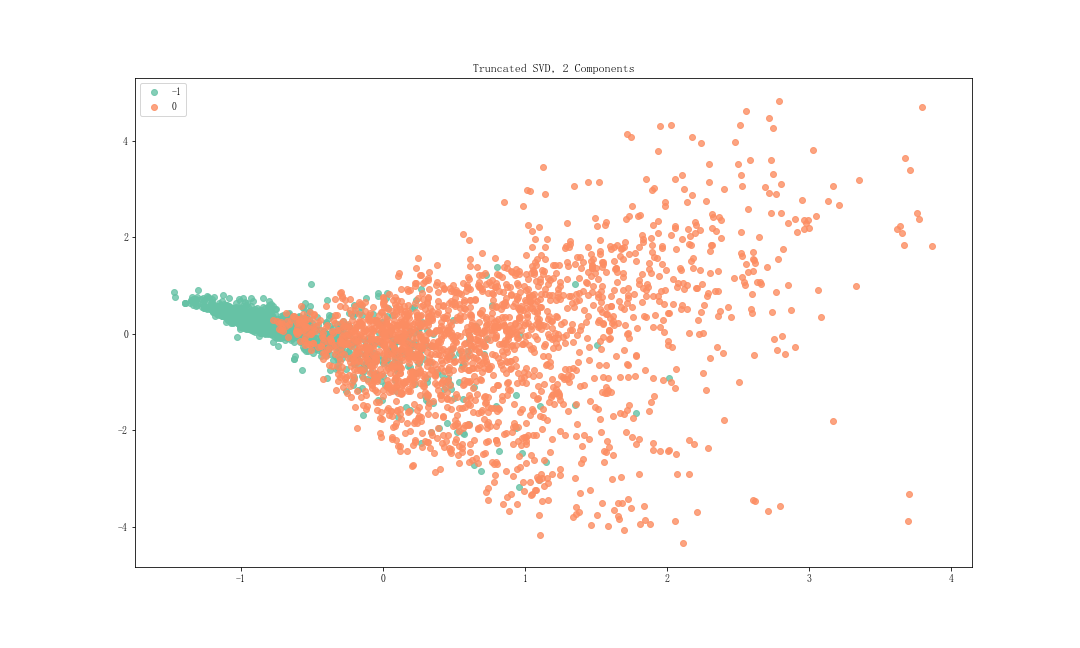

{0: '非负', -1: '负面'}


In [29]:
load_save_plot_file.plot2(features, class_name_dict)

<IPython.core.display.Javascript object>


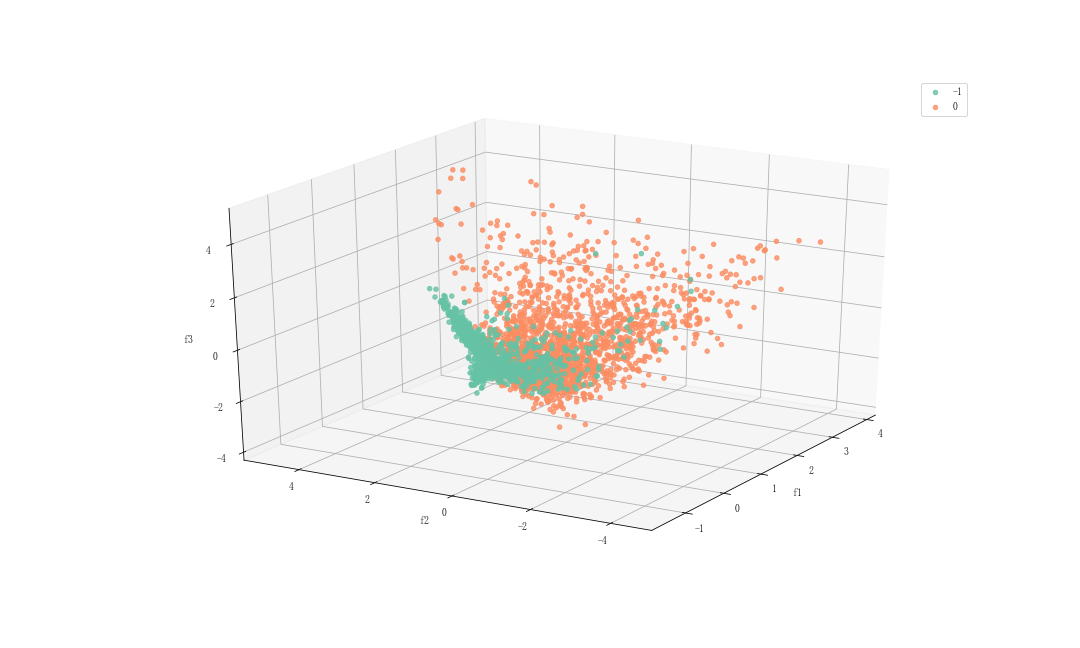

{0: '非负', -1: '负面'}


In [27]:
# load_save_plot_file.plot3(features, class_name_dict)
plot3(features, class_name_dict)

### lda

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=3)
lda.fit(X_features_dense, label)
feature_lda = lda.transform(X_features_dense)

print('-- lda: ')
print(feature_lda.shape)
# print("截距: ", lda.intercept_)
# print("系数: ", lda.coef_)
print("各维度的方差值占总方差值的比例: ", lda.explained_variance_ratio_) 
print("各维度的方差值之和占总方差值的比例: ", np.sum(lda.explained_variance_ratio_))
feature_lda

-- lda: 
(3473, 1)
各维度的方差值占总方差值的比例:  [1.]
各维度的方差值之和占总方差值的比例:  1.0


array([[-3.05663566],
       [-2.83195147],
       [-2.62047964],
       ...,
       [ 6.42960869],
       [ 1.95211065],
       [ 7.07218881]])

In [16]:
features = pd.DataFrame(feature_lda, columns = ['f1', 'f2', 'f3'])
features['label'] = label
print(features.head())
features.describe()

In [ ]:
plot2(features, class_name_dict)

In [ ]:
plot3(features, class_name_dict)

## 特征降维

In [30]:
from sklearn.decomposition import TruncatedSVD, SparsePCA, PCA

tsvd = TruncatedSVD(n_components = 2000) # 处理稀疏数据
feature_tsvd = tsvd.fit_transform(X_features)
print('-- TruncatedSVD: ')
# print("各维度的方差值: ", tsvd.explained_variance_)
# print("各维度的方差值占总方差值的比例: ", tsvd.explained_variance_ratio_) 
# print("各维度的方差值之和占总方差值的比例: ", np.sum(tsvd.explained_variance_ratio_))
print(feature_tsvd.shape)

var_exp = tsvd.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

-- TruncatedSVD: 
(3982, 2000)


max(var_exp):  0.013057511417091917
max(cum_var_exp):  0.9999933774252426


<IPython.core.display.Javascript object>


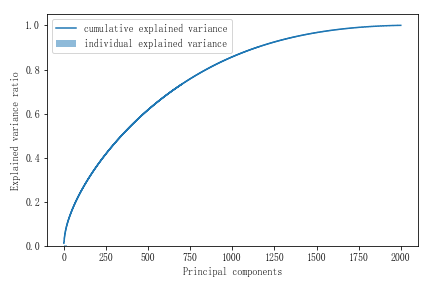

In [31]:
print('max(var_exp): ', max(var_exp))
print('max(cum_var_exp): ', max(cum_var_exp))

plt.figure()
plt.bar(range(1, len(var_exp) + 1), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, len(var_exp) + 1), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/pca1.png', dpi=300)
plt.show()

# 特征合并

In [47]:
## 保存特征
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('len_stats', myclass_circ.StatsFeatures_tendency()),
    ])),
    ('standard', StandardScaler(with_mean=False))
])

pipeline_train = pipeline.fit(title_content, label)
X_features = pipeline_train.transform(title_content)
print(X_features.shape)

d:\xh\python_project\tool\toolkits\nlp
(3473, 2005)


In [32]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('len_stats', myclass_circ.StatsFeatures_tendency()),
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=2))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

d:\xh\python_project\tool\toolkits\nlp
0.9967707212055974


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

In [33]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.9313807531380753
             precision    recall  f1-score   support

         -1       0.95      0.92      0.93       601
          0       0.92      0.95      0.93       594

avg / total       0.93      0.93      0.93      1195

confusion_matrix: 
[[550  51]
 [ 31 563]]


In [34]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return [d[0] for d in X[:, self.attribute_names]]

In [35]:
# X_sel = DataFrameSelector([0]).fit(title_or_content).transform(title_or_content)
# X_sel

In [36]:
step1_1 = Pipeline([('title_sel', DataFrameSelector([0])), 
                    ('title_features', myclass_circ.StatsFeatures_cor())])
step1_2 = Pipeline([('content_sel', DataFrameSelector([1])), 
                    ('content_features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('len_stats', myclass_circ.StatsFeatures_tendency()),
    ]))])

pipeline = Pipeline([('cal_features', FeatureUnion(transformer_list=[
                                                ("title_fea", step1_1),
                                                ("content_fea", step1_2),])),
                     ('standard', StandardScaler(with_mean=False)),
                     ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=2))
                 ])

# pipeline_train = pipeline.fit(title_or_content, label)
# X_features = pipeline_train.transform(title_or_content)
# print(X_features.shape)
pipeline.fit(X_train_1, y_train)
print(pipeline.score(X_train_1, y_train))
pipeline

d:\xh\python_project\tool\toolkits\nlp
d:\xh\python_project\tool\toolkits\nlp
0.9967707212055974


Pipeline(memory=None,
     steps=[('cal_features', FeatureUnion(n_jobs=1,
       transformer_list=[('title_fea', Pipeline(memory=None,
     steps=[('title_sel', DataFrameSelector(attribute_names=[0])), ('title_features', StatsFeatures_cor())])), ('content_fea', Pipeline(memory=None,
     steps=[('content_sel', DataFrameSelect...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

In [37]:
y_pred_class = pipeline.predict(X_test_1)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.9355648535564853
             precision    recall  f1-score   support

         -1       0.95      0.92      0.93       601
          0       0.92      0.96      0.94       594

avg / total       0.94      0.94      0.94      1195

confusion_matrix: 
[[550  51]
 [ 26 568]]
